In [3]:
%pip install 'protobuf==3.20.*'

  Using cached protobuf-3.20.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
ERROR: tensorflow 2.9.3 has requirement protobuf<3.20,>=3.9.2, but you'll have protobuf 3.20.3 which is incompatible.
ERROR: tensorboard 2.9.1 has requirement protobuf<3.20,>=3.9.2, but you'll have protobuf 3.20.3 which is incompatible.
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.27.0rc2
    Uninstalling protobuf-5.27.0rc2:
      Successfully uninstalled protobuf-5.27.0rc2
You should consider upgrading via the '/root/.clearml/venvs-builds/3.8/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras import Model
import tensorflow_datasets as tfds
import numpy as np
from datetime import datetime
from clearml import Task
from utils import *

print(tf.__version__)
tf.executing_eagerly()
tf.config.list_physical_devices()

2024-05-10 04:57:56.614725: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.9.3


2024-05-10 04:57:57.773420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-10 04:57:57.776835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-10 04:57:57.776958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-02-19 06:15:02.312648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 06:15:02.315492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 06:15:02.315575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 06:15:02.315847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow wit

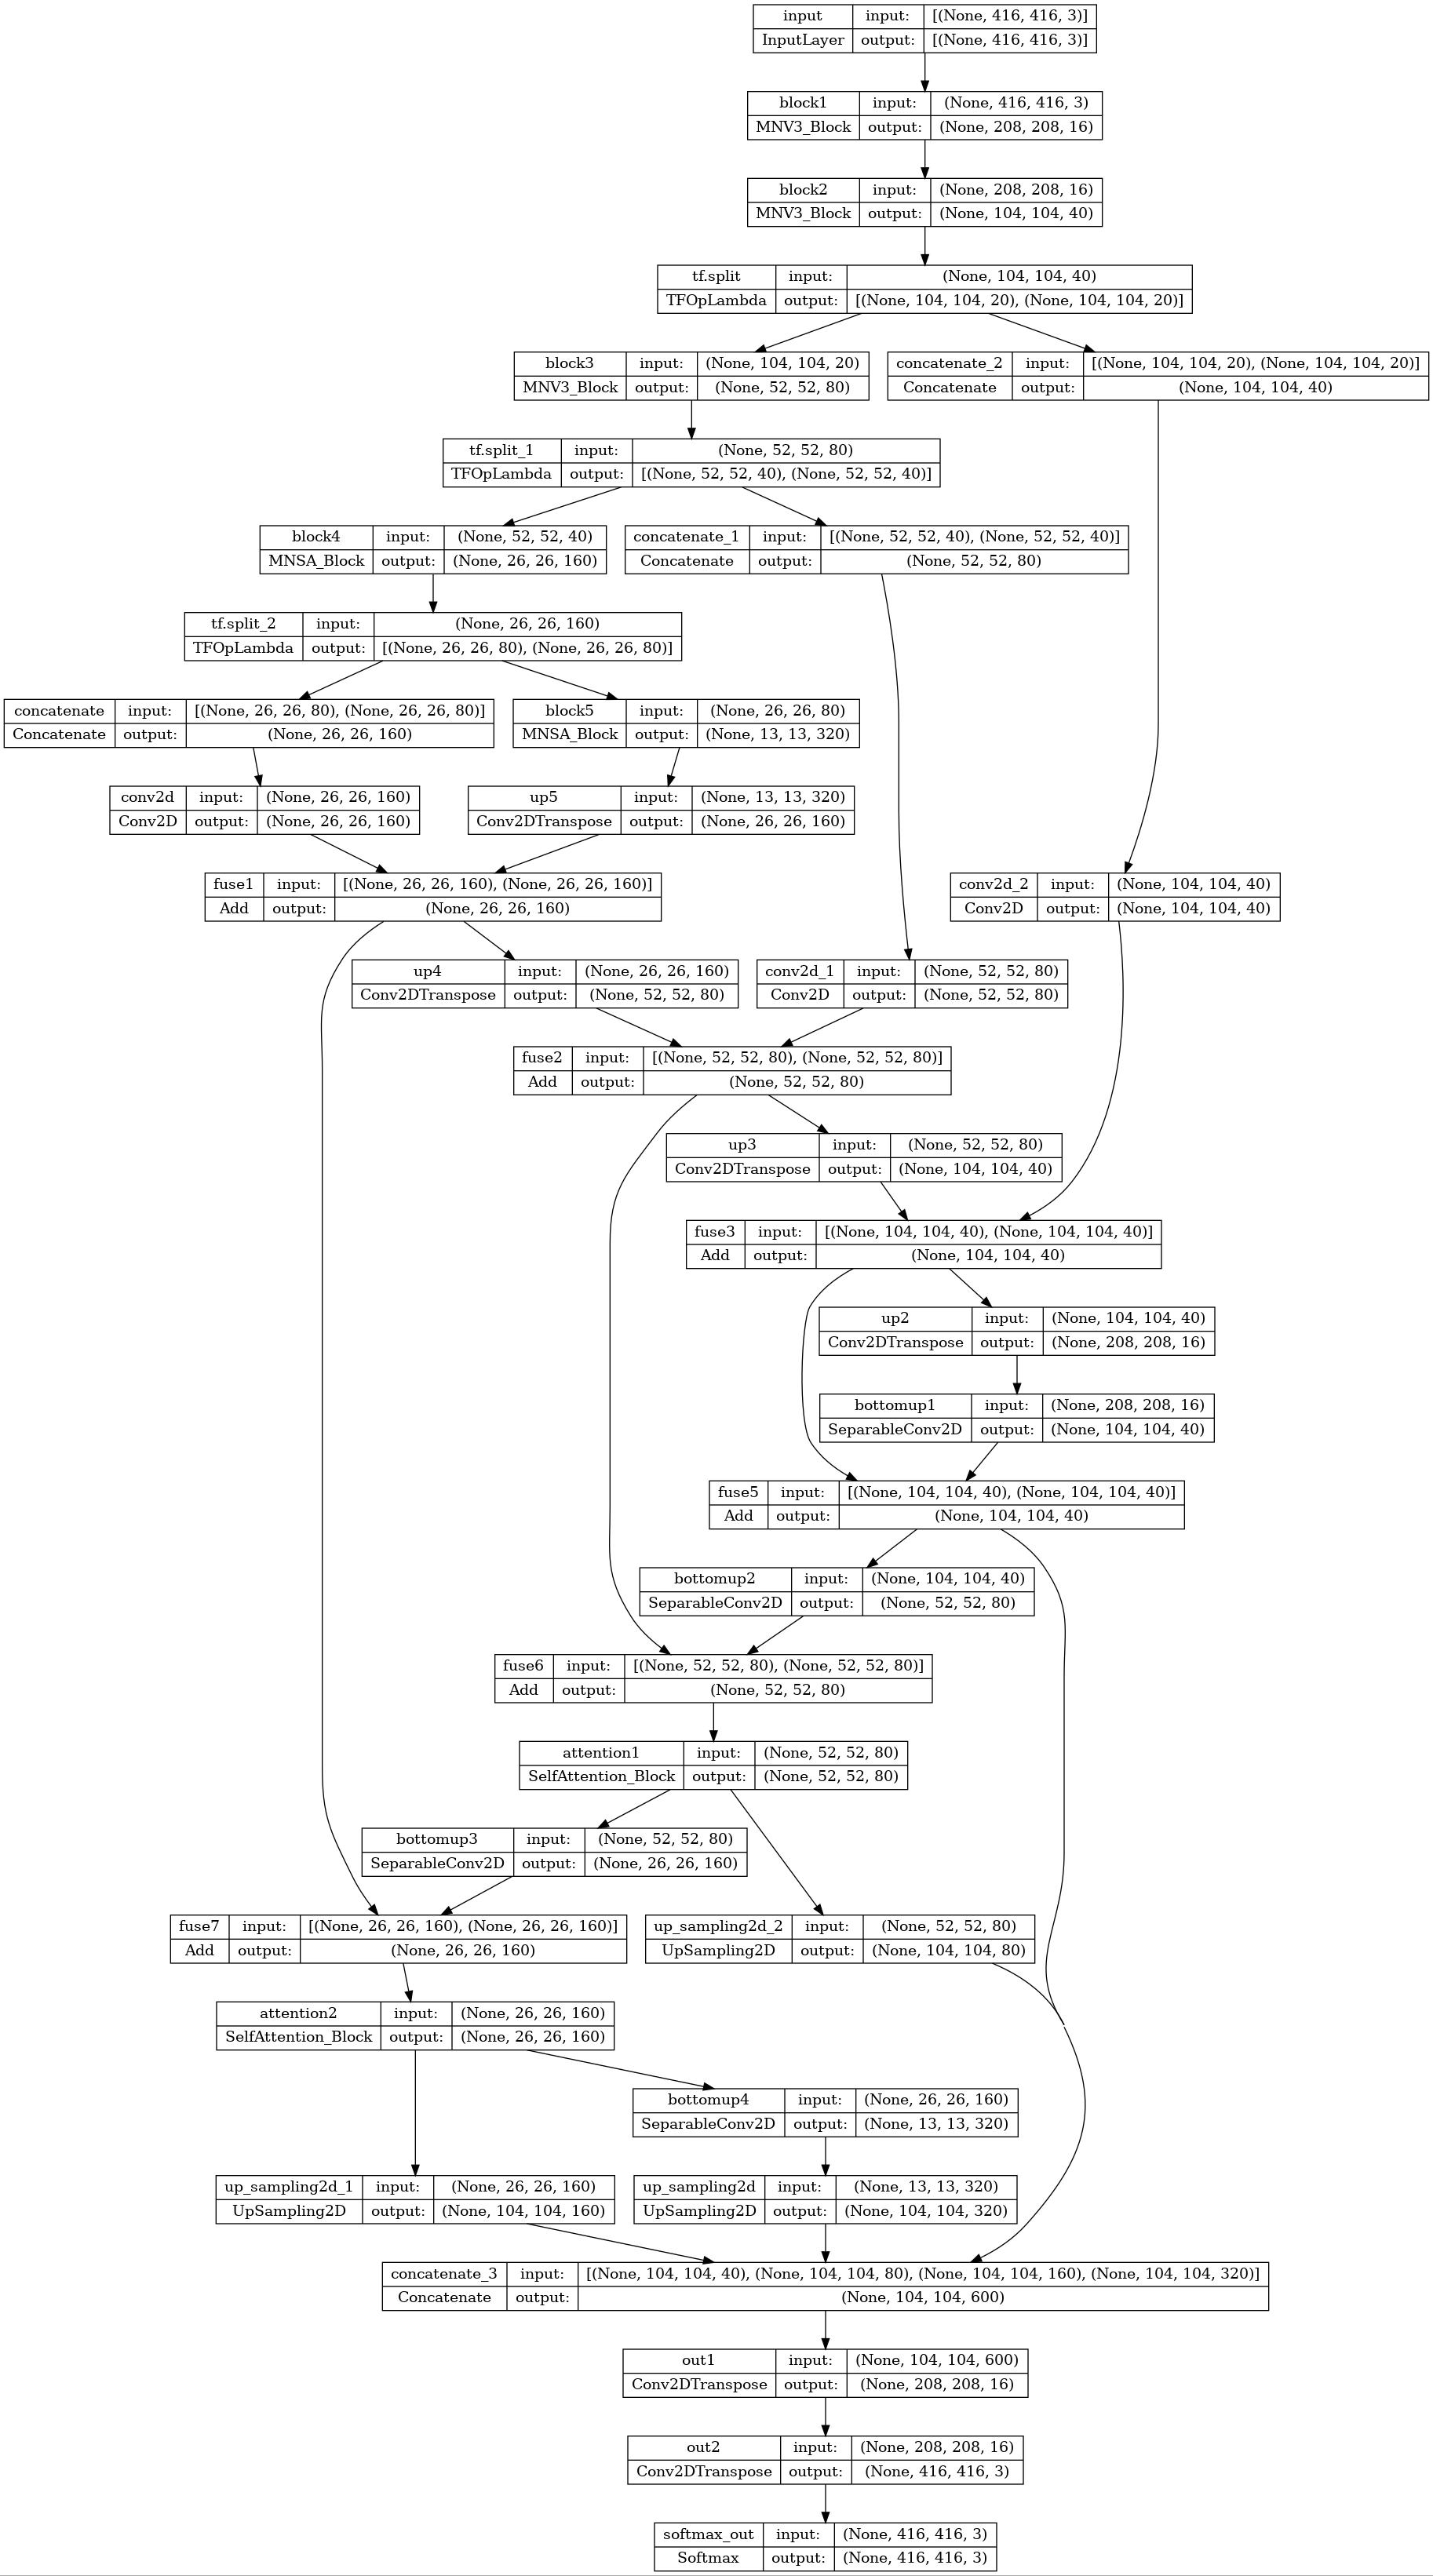

In [2]:
def SE_block(inputs, reduction_factor=2):
    input_channels = int(inputs.shape[-1])
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Dense(input_channels//reduction_factor, activation='relu')(x)
    x = layers.Dense(input_channels, activation='hard_sigmoid')(x)
    x = layers.Reshape((1, 1, input_channels))(x)
    x = layers.Multiply()([inputs, x])
    return x

class SE_Block(tf.keras.layers.Layer):
    def __init__(self, reduction_factor=4, name=None):
        super(SE_Block, self).__init__(name=name)
        self.reduction_factor = reduction_factor

    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_factor': self.reduction_factor
        })
        return config

    def build(self, input_shape):
        input_channels = int(input_shape[-1])
        self.pool = layers.GlobalAveragePooling2D()
        self.d1 = layers.Dense(input_channels//self.reduction_factor, activation='relu6')
        self.d2 = layers.Dense(input_channels, activation='hard_sigmoid')
        self.reshape = layers.Reshape((1, 1, input_channels))
        self.out = layers.Multiply()

    def call(self, inputs):
        x = self.pool(inputs)
        x = self.d1(x)
        x = self.d2(x)
        x = self.reshape(x)
        return self.out([inputs, x])

class Conv_Block(tf.keras.layers.Layer):
    def __init__(self, kernel, filters, stride, activation=tf.nn.relu6, name=None):
        super(Conv_Block, self).__init__(name=name)
        self.kernel = kernel
        self.filters = filters
        self.activation = activation
        self.stride = stride

    def get_config(self):
        config = super().get_config()
        config.update({
            'kernel': self.kernel,
            'filters': self.filters,
            'stride': self.stride,
            'activation': self.activation
        })
        return config

    def build(self, input_shape):
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.p_conv = layers.Conv2D(self.filters, 1, padding='same', activation=self.activation)
        self.d_conv = layers.DepthwiseConv2D(self.kernel, self.stride, 'same', activation=self.activation)
        # self.conv = layers.SeparableConv2D(self.filters,self.kernel,self.stride,'same',activation=self.activation)
    
    def call(self, inputs):
        x = self.p_conv(inputs)
        x = self.bn1(x)
        x = self.d_conv(x)
        x = self.bn2(x)
        return x
        # return self.conv(inputs)

def hswish(x):
    return x * tf.nn.relu6(x + 3) / 6

class MNV3_Block(tf.keras.layers.Layer):
    def __init__(self, kernel, filters, stride=1, activation=tf.nn.relu6, reduction_factor=4, name=None):
        super(MNV3_Block, self).__init__(name=name)
        self.kernel = kernel
        self.filters = filters
        self.stride = stride
        self.activation = activation
        self.reduction_factor = reduction_factor

    def get_config(self):
        config = super().get_config()
        config.update({
            'kernel': self.kernel,
            'filters': self.filters,
            'stride': self.stride,
            'activation': self.activation,
            'reduction_factor': self.reduction_factor
        })
        return config

    def build(self, input_shape):
        self.conv = Conv_Block(self.kernel, self.filters, self.stride, self.activation)
        self.se = SE_Block(self.reduction_factor)
        self.out = layers.Conv2D(self.filters, 1, padding='same', activation=self.activation)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.se(x)
        x = self.out(x)
        return x

class SelfAttention_Block(tf.keras.layers.Layer):
    # Self attention layer for n_channels
    def __init__(self, reduction_factor, name=None):
        super(SelfAttention_Block, self).__init__(name=name)
        self.reduction_factor = reduction_factor
        
    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_factor': self.reduction_factor
        })
        return config
        
    # input shape requires channel last
    def build(self, input_shape): 
        tf.print("build")
        tf.print(input_shape)
        n = input_shape[-1]
        r = self.reduction_factor
        self.query = layers.Conv2D(n//r, 1, padding='same', use_bias=False)
        self.key = layers.Conv2D(n//r, 1, padding='same', use_bias=False)
        self.value = layers.Conv2D(n, 1, padding='same', use_bias=False)
        self.reshape1 = tf.keras.layers.Reshape((-1, n//r))
        self.reshape2 = tf.keras.layers.Reshape((-1, n))
        self.gamma = tf.Variable(0, trainable=True, dtype=tf.float32)
        self.softmax = layers.Softmax(axis=1)

    def call(self, x):
        # tf.print("call")
        # tf.print(size)
        f, g, h = self.query(x), self.key(x), self.value(x)
        f, g, h = self.reshape1(f), self.reshape1(g), self.reshape2(h)
        # tf.print(tf.shape(f))
        # tf.print(tf.shape(g))
        # tf.print(tf.shape(h))
        beta = self.softmax(tf.matmul(f, tf.transpose(g, perm=[0,2,1])))
        # tf.print(tf.shape(beta))
        beta = tf.reshape(tf.matmul(h, beta, transpose_a=True), size) 
        return self.gamma * beta + x

test_model = get_enhanced_efm_attention()
test_model(np.zeros((1,416,416,3)))
tf.keras.utils.plot_model(test_model, to_file='test_model.jpg', show_shapes=True)

In [4]:
!apt install graphviz -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.


In [ ]:
def get_enhanced_efm(CLASS_NUIM = 3):
    # down sample
    input = tf.keras.Input((416,416,3),name='input')
    x1 = MNV3_Block(3,16,2,hswish,name='block1')(input)
    x2 = MNV3_Block(5,40,2,name='block2')(x1)
    x2, x2p = tf.split(x2,num_or_size_splits=2, axis=-1)
    x3 = MNV3_Block(3,80,2,hswish,name='block3')(x2)
    x3, x3p = tf.split(x3,num_or_size_splits=2, axis=-1)
    x4 = MNV3_Block(3,160,2,hswish,name='block4')(x3)
    x4, x4p = tf.split(x4,num_or_size_splits=2, axis=-1)
    x5 = MNV3_Block(3,320,2,hswish,name='block5')(x4)
    # up sample
    p5 = layers.Conv2DTranspose(160,3,2,padding='same',name='up5')(x5)
    x4 = layers.Concatenate()([x4,x4p])
    p5 = layers.Add(name='fuse1')([p5, layers.Conv2D(160, 1, padding='same', activation='relu6')(x4)])

    p4 = layers.Conv2DTranspose(80,3,2,padding='same',name='up4')(p5)
    x3 = layers.Concatenate()([x3,x3p])
    p4 = layers.Add(name='fuse2')([p4, layers.Conv2D(80, 1, padding='same', activation='relu6')(x3)])

    p3 = layers.Conv2DTranspose(40,3,2,padding='same',name='up3')(p4)
    x2 = layers.Concatenate()([x2,x2p])
    p3 = layers.Add(name='fuse3')([p3, layers.Conv2D(40, 1, padding='same', activation='relu6')(x2)])

    p2 = layers.Conv2DTranspose(16,3,2,padding='same',name='up2')(p3)
    # p2 = layers.Add(name='fuse4')([p2, layers.Conv2D(16, 1, padding='same', activation='relu6')(x1)])
    # bottom-up augmentation
    n2 = layers.SeparableConv2D(40,3,2,padding='same',name='bottomup1')(p2)
    n2 = layers.Add(name='fuse5')([n2, p3])

    n3 = layers.SeparableConv2D(80,3,2,padding='same',name='bottomup2')(n2)
    n3 = layers.Add(name='fuse6')([n3, p4])

    n4 = layers.SeparableConv2D(160,3,2,padding='same',name='bottomup3')(n3)
    n4 = layers.Add(name='fuse7')([n4, p5])

    n5 = layers.SeparableConv2D(320,3,2,padding='same',name='bottomup4')(n4)

    n5 = layers.UpSampling2D(8)(n5)
    n4 = layers.UpSampling2D(4)(n4)
    n3 = layers.UpSampling2D(2)(n3)

    out = layers.Concatenate()([n2,n3,n4,n5])
    out = layers.Conv2DTranspose(16,3,2,padding='same',name='out1')(out)
    out = layers.Conv2DTranspose(CLASS_NUIM,3,2,padding='same',name='out2')(out)
    out = tf.keras.layers.Softmax(name='softmax_out')(out)

    return Model(inputs=[input], outputs=[out])

In [18]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (416, 416))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (416, 416))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [ ]:
task = Task.init(project_name='semantic_segmentation', task_name='efm on pets')

EPOCHS = 15
BATCH_SIZE = 36
VAL_SUBSPLITS = 5
BUFFER_SIZE = 64
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

model = get_enhanced_efm()
train_batches = (
    train_images
    .shuffle(BUFFER_SIZE, seed=0)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

# Create a TensorBoard callback
logs = f'emf_enhanced{datetime.now().strftime("%Y%m%d-%H%M%S")}'
checkpoint_path = f'emf_enhanced{datetime.now().strftime("%Y%m%d-%H%M%S")}_ckpt'

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                histogram_freq = 1,
                                                profile_batch = '200,220')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

model_history = model.fit(train_batches, epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_steps=VALIDATION_STEPS,
                        validation_data=test_batches,
                        callbacks=[tboard_callback,cp_callback])

2023-02-12 23:24:45.703347: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-12 23:24:45.703368: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


Epoch 1/15


2023-02-12 23:24:45.846525: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-02-12 23:24:45.879953: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


102/102 [==============================] - ETA: 0s - loss: 0.8210 - accuracy: 0.6299
Epoch 1: val_loss improved from inf to 1.00706, saving model to emf_enhanced20230212-232445_ckpt
102/102 [==============================] - 47s 392ms/step - loss: 0.8210 - accuracy: 0.6299 - val_loss: 1.0071 - val_accuracy: 0.5674
Epoch 2/15
  8/102 [=>............................] - ETA: 33s - loss: 0.7726 - accuracy: 0.6628

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


 97/102 [===========================>..] - ETA: 1s - loss: 0.7608 - accuracy: 0.6689

2023-02-12 23:26:07.518911: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-12 23:26:07.518930: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


102/102 [==============================] - ETA: 0s - loss: 0.7615 - accuracy: 0.6687
Epoch 2: val_loss improved from 1.00706 to 0.99711, saving model to emf_enhanced20230212-232445_ckpt
102/102 [==============================] - 40s 394ms/step - loss: 0.7615 - accuracy: 0.6687 - val_loss: 0.9971 - val_accuracy: 0.5690
Epoch 3/15
  9/102 [=>............................] - ETA: 30s - loss: 0.7602 - accuracy: 0.6723

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


 15/102 [===>..........................] - ETA: 29s - loss: 0.7619 - accuracy: 0.6723

2023-02-12 23:26:18.433284: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-12 23:26:18.473142: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-02-12 23:26:18.687596: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 31548 callback api events and 30983 activity events. 
2023-02-12 23:26:18.814195: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-02-12 23:26:18.819842: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: emf_enhanced20230212-232445/plugins/profile/2023_02_12_23_26_18/Ubuntu-CNL-1.xplane.pb


102/102 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.6788
Epoch 3: val_loss did not improve from 0.99711
102/102 [==============================] - 40s 394ms/step - loss: 0.7494 - accuracy: 0.6788 - val_loss: 1.0085 - val_accuracy: 0.4004
Epoch 4/15
  9/102 [=>............................] - ETA: 30s - loss: 0.7479 - accuracy: 0.6798

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 10/102 [=>............................] - ETA: 30s - loss: 0.7455 - accuracy: 0.6800

Corrupt JPEG data: premature end of data segment


102/102 [==============================] - ETA: 0s - loss: 0.7381 - accuracy: 0.6845
Epoch 4: val_loss did not improve from 0.99711
102/102 [==============================] - 39s 386ms/step - loss: 0.7381 - accuracy: 0.6845 - val_loss: 1.0237 - val_accuracy: 0.3468
Epoch 5/15
 10/102 [=>............................] - ETA: 29s - loss: 0.7370 - accuracy: 0.6869

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 11/102 [==>...........................] - ETA: 29s - loss: 0.7346 - accuracy: 0.6871

Corrupt JPEG data: premature end of data segment


102/102 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.6893

In [ ]:
# task.upload_artifact('enhanced_efm', model)

In [ ]:
model.evaluate(test_batches)
model.save('enhanced_efm')
task.close()

#### preprocess experiment

In [2]:
model_type = 'efm_v2'

prev_tasks = Task.get_tasks(project_name='semantic_segmentation', \
                                task_name='cityscapes segmentation', \
                                task_filter= { 
                                    'status':['completed', 'published'],
                                    'order_by':['-last_update']
                                })
print([i.task_id for i in prev_tasks])
prev_task_id = prev_tasks[0].task_id
prev_task = Task.get_task(prev_task_id)
snapshots = [m for m in prev_task.models['output'] if (model_type in m.url or model_type is None)]
print([i.id for i in snapshots])
local_weights_path = snapshots[-1].get_local_copy()
print(local_weights_path)

['444abbada49946799cdf70a8e51105be', 'c8e48e41142d463da60aa901ceddd847', '1e6496f1884140b58beb3f0eeae3908b', '5a7bdcfde0d84d5c917b83c786e18cc1', '983c915fdfb94d81b3683cd68d537a53', 'ff17b83e9e584f75bb98d4d886c44e12', 'e96662d245334dc1bbca91257f88dd25', '5945989cfe2145ce8f52b62708cf46df', '6f79b4e40226446ca646f8b91f0e1e50', 'a679f277afe94b33bcedaf82d4a22f1e', '69056330011543559543d6e91b781a35', '6b928bdbac56402e99769d9d7f92e33c', '02bf2b3234684ac4a540e11701c7c1f0', '9eb821f90d264d829080fe983f1219d7', 'b345cfb4f8754e7e9c3e328ae2bbb486', 'be630914bf0d4859937fe6e1eb4383ee', '0f01030c3d0442f5be5cdf8ed3ff323a', '43f0c6506fc64dc98208d9109e905562', '689bb494cfc14029b81ed29fee8ca480', 'b4858b74833f4a498e242c630ce4d4af', '9a3ef8ab4cb14786a208389101c704bd', '51105b6d423c45c49e1e6eee4e32a6b3', '7637ddf1540243d79f0af0cdcb3af662', 'f8010a5cc208402cb32c81ac9c61d101', '99da7decd6574f0e95f30884e95ea046', 'c3ca283e2d7b4cd7be7103077f616f85', 'cd2d51adf75d4549b195cf4228abbfcb', '4e23e8bfc93843f9b7b9a14c0d

In [16]:
local_ckpt_path = prev_task.models['input'][0].get_local_copy()

In [1]:
base64_img='''/9j/4XENRXhpZgAASUkqAAgAAAANAAABAwABAAAAwA8AAAEBAwABAAAA3AgAAA8BAgAHAAAAqgAAABABAgAMAAAAsQAAABIBAwABAAAAAQAAABoBBQABAAAAvQAAABsBBQABAAAAxQAAACgBAwABAAAAAgAAADEBAgAVAAAAzQAAADIBAgAUAAAA4gAAABMCAwABAAAAAQAAAGmHBAABAAAA9gAAACWIBAABAAAA2AMAAP4DAABHb29nbGUAUGl4ZWwgNyBQcm8ASAAAAAEAAABIAAAAAQAAAEhEUisgMS4wLjU0MDEwNDc2N3pkADIwMjQ6MDU6MTAgMTI6MzQ6MDQAKwCaggUAAQAAAAADAACdggUAAQAAAAgDAAAiiAMAAQAAAAIAAAAniAMAAQAAACoAAAAAkAcABAAAADAyMzIDkAIAFAAAABADAAAEkAIAFAAAACQDAAAQkAIABwAAADgDAAARkAIABwAAAD8DAAASkAIABwAAAEYDAAABkQcABAAAAAECAwABkgoAAQAAAE0DAAACkgUAAQAAAFUDAAADkgoAAQAAAF0DAAAEkgoAAQAAAGUDAAAFkgUAAQAAAG0DAAAGkgUAAQAAAHUDAAAHkgMAAQAAAAIAAAAJkgMAAQAAABAAAAAKkgUAAQAAAH0DAACQkgIABAAAADk5NQCRkgIABAAAADk5NQCSkgIABAAAADk5NQAAoAcABAAAADAxMDABoAMAAQAAAAEAAAACoAMAAQAAAMAPAAADoAMAAQAAANwIAAAFoAQAAQAAALoDAAAXogMAAQAAAAIAAAABowcAAQAAAAEAAAABpAMAAQAAAAEAAAACpAMAAQAAAAAAAAADpAMAAQAAAAAAAAAEpAUAAQAAAIUDAAAFpAMAAQAAABgAAAAGpAMAAQAAAAAAAAAIpAMAAQAAAAAAAAAJpAMAAQAAAAAAAAAKpAMAAQAAAAAAAAAMpAMAAQAAAAMAAAAzpAIABwAAAI0DAAA0pAIAJgAAAJQDAABgpAMAAQAAAAMAAAAAAAAANQIAAEBCDwC5AAAAZAAAADIwMjQ6MDU6MTAgMTI6MzQ6MDQAMjAyNDowNToxMCAxMjozNDowNAArMDg6MDAAKzA4OjAwACswODowMAA3BAAAZAAAALIAAABkAAAAcgMAAGQAAAAAAAAABgAAALIAAABkAAAA/////wEAAACaGgAA6AMAAAAAAAABAAAAR29vZ2xlAFBpeGVsIDcgUHJvIGJhY2sgY2FtZXJhIDYuODFtbSBmLzEuODUAAgABAAIABAAAAFI5OAACAAcABAAAADAxMDAAAAAAAgAQAAIAAgAAAE0AAAARAAUAAQAAAPYDAAAAAAAAZQEAAAEAAAAJAAABAwABAAAA+AEAAAEBAwABAAAAGwEAAAMBAwABAAAABgAAABIBAwABAAAAAQAAABoBBQABAAAAcAQAABsBBQABAAAAeAQAACgBAwABAAAAAgAAAAECBAABAAAAgAQAAAICBAABAAAAhWwAAAAAAABIAAAAAQAAAEgAAAABAAAA/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAA0QFAocBQMXGAQEExcTBg4SFxcSESIfGBkaHiMsKCUlIyQnJyYqLSwqLjM1MjA4LyYoODk4NzxAPC40QDc4Nzf/2wBDAQ4ODh0WGCYdHyc4LSgsOzg5OTg4Ojo6OTg5Ojs+PDs6Ozw8PD89PDs8PT4+PT0+Pj4+Pj0+Pj4+Pj8+Pj4/Pj7/wAARCAEbAfgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDPIO7IIBz+Bpyv90FZM/QVnCZwBlL4fVP/ANVBmQ7P36g+6/8A16g0Nkcg/wCr6dyBQC6TSldpBxuX19x71krcNuA2xkbuu7/JqyJ144t/++hQtA3NoLby20AMdo64I+dc7c9f9pffBBrLnsIRvaO8RQMj5vnj+hYcj6MpPvSJMVnDKI84GRuGGHvzWirxOLZ1aQYvIC3ZgVJBB/P8atpSMmrHPrJCkcg8+T/WNuKk8444HSmGWFpGB2Mu1eq4Pr27fh/jVOYqmsXw/s5GK3bjHTnPvVmKWBha7tO1EncDldvWuT2ai7iIprdUN64LbCxOWOCPbnms45IJ2HGOM9TXTIY3t5Y5Ixjb8pYjkD+orGuUKT42hssQuDwcdfyrp+aZUJG14eeMS+Oc3FqPkhxuIH96pbna3iDxKvmqV889D0JUVX0GOH7X4zDqp/dwnGOM/Nz+FVriRU8ZeIBiIIywnjoNyKeB7ZrSLshSV2y3Hu84g9mKkfSremoy6lqa+ZGVEcm32GRxVR2fZFIsKsQhDKDjd3GOD/Krunsrag7Do1kx/Mit6fxIxn8LNo9U+T+LH50U44w3XpSD7q9K7jjE/Kkp1J+NAhtJTqKAG0lOopgNopaKAG0U6igQ2lopaAE9K5m/z/wmFl87YGmy5H/bNq6euYvS3/CXT/dx/Zkmf++DWOI+H5m1D4vkYl2GN4vz9NPhVe2MqM1duh/xJ7AcH9++MeyoKpXbN9s1MbB8tvEOe/Srd/vGn2OHb/j7nzjv0FcT6nZ2NmcY8LfDhducXEX6Kaxtw/4Trwov2S2P+mwDd82eT9cfpW1df8gr4fLnHzDv0wtY8asfHuhH91gXMR+8MjgdutZlHQXJH9pzcgfKoB78jtWMWLPP8oCrK4A+nc1pXOT4ii4HEZH5gdqoxqotgzOvUtz05Oea3g7WMZq+hoaUANN+JrbyMox+uAT/AJ//AFVnQq/9oas2FwUYD17Vs2O3/hHvHh+z9YpOf+A//XrIjbcfEvyYCW8g59utYdTboCMDfkADiI9Og4qnACdZ0/5mPz5yfpU1vgXGrcLxauR+FOt0AvLEmXc3PT7o4/WqWgie3B/4SOZ9seBpUh/JCaYkoGraV8jswl3bR7c/hUsTJv8AEChuU0CYnHY7cdfxqhbBRqcn+rAEcxJJ/wBg9TU2uO51+lSCS78ZSCCdQ0cGAevIP+HFb3cfMawNGA+x6+QUIMsQ4PBwDXQenPp+P/16gYxiBHKdp4Xt/kVj3V2qx8aiEOeNw7jtn+o6e9XrmUpaORFKzdlBHP5g/jxXG3c0ZXX/APQbJSq5YqB8xJwMfKv1B60AStqd19mBxIhMx5ZgwOOq55/PHfk9xRupvMWE+VeYD7Cp42t2J69VJz7ioTLcGLxlIIFX91OQAONrZXp7Zz9arpJObvRxmDl0JGB0AIPI9Qfzxg8Ck0Tcnt3iDRBrq5A3cdDgnPPP6+36504Vb27AVwN7Ec847VPP5IvdRAlhIEpHB498dutUG3l5SXc8j8qlIaHRthLn5m6D3FbCKX8Paoi2ZDfZ1bpjP3sn6A/1q5pFgj2xkkD7TtwOgI689z27VtTx26+C/Ex+zRqFF0oI7L5hxVJDscR5FurasrahdearjaoX5SfQmt2G3Dx3cwUYWyVSMdNoP8/89a5ePzmmtc3lyQ0mDxmt2OS8jbUokvXWMhdwKjJ3Lznr2ptajG3yStY+AgLS4KkSnOOCxbGM/hVCEstwqeWmfOHO0E56Yz1APfmtK/lcWXgyHyRtFj5uQeclm/pWfaojT2Aa2uyZZ1RSDjBJ60pCsaN04/s/GVyHQLjo2Ae/Hr79PpWJ5c7zQgKxJZqt3XkjUryMX02I53U8ZyQf8MZ/GrVjcRJLZ7oJtquHyvXpx9f8+4qYqwjNh8xbu+GZFJhaM4HPzcGrLI32vUlacHZLt46Ejr+tdSs2jXGqWii9LSPD5YDREHAz0OMAj61ysjL9r1XajHN0546dfWtYjaLtkq/27ow8tcAufyU1HqMNy3iLcNLvCgjjAYDj1P61Np27+1ySq8W7n+QouL+8XXdYjWDTSqy7RuU56exFD3Gh9xG3/CE+GFCyf8fKE4Hb5jRVi5uZIdN8DAWFsxktxkEkYwB/jRSAjQlhaENERtIPr/h+lSIwIXday8kD5l5/Xr/nrWSjOrAiQirfmI/l5CqwHynHH0/GsVpsaypNbbGjsgKj/RrE8f3VqBoogx/0C0I56Lgj8sfn/wDrqFJJk++EA2L827qT+X+NaCOjInzJ06561aZCZAIbQgf6GMZ7M3+NWoliRLzZHy0ePmf3z71EVIYlfy7f5/zxT1YHu456U7jsLdRQT6fqTLDbLLvGcgZz1wfUelc95dwD/q7ODB2Hdzk+wxkfXJHpXR87kIYhuxwfyp7LHJEMpGrqVzkZ4/T8Dx/SiS5lpv8AmZSjYw0S6KDdNDyDkKc8dfTA/P8ArV1U32bI7xgiLcuBj1/z+tSS22pRmBl00zRkKd8RJAx7Z3D8QP51R81xs+e5OQSN33ge45/nWEXKL1RLLmlW+/VfFKSRyrjywMNyevP0NZWrhV8WaoNqqPs0BAUY/gH9a6nS2zqd9gxEiFQe3r7Vg6yo/wCEs1Jio/1MQA98V19C4PUjsZA3lKS/GcZ7jFbVgiLq+qYMuCkhwTwOR0rkUZkuoWHDBwQo/r/nFdfp7o9/Kw72rZHocjNa0H7yIrxsmzb70fxN7jNHGG57Vmm+svtF4pXUQUlIOVGMjjsTXe5pbs4ErmlSVTW7087samvCknKsOPyqzHJbuJdl9bNjGcHpmhST2YNND6SnUlUIbRTqSgQlJTqKAG0UtFMQlFLRQAlcteH/AIqrWx5Z40xzn8MV1Vcndlf+Eo8YDc2RprHp9BWGI+FG+H3Zj3bL/aeu/MxICg47c4/P0q7qBAt7UeU5ze3WB2+/3qpcgf2/rYIODcjjOM/MauXozb6GMDm4mP5yGuNnV2Ni+xt+H4IbGyU/korDtxn4k2PzA4mBP1C1uX//AB8fDz5DnyJiPrhcfrWRZMh+IcAFsMh5fmyc8Ke1ZmhtSlf7TuwWAy+B6nArMU74YGKALjKqOgFW5s/27rp2niE/oTVZE/0GHc/S3zgf1reLSMJpvY1LLI8GeLz5h5lft1OFFZEH/Hv4sH7wbkk5+ua3LcIPAmv/ALpubg8n6gVjbx/Z/iQqU+RMZ7ZrDqzcE2C21XEZAFm+fU/Wobd2N9P8uALdz702L/jx8TEsSfshGaW2B362fKlx9ik5xxn0FVbuTcsxBjc/EHEfP9mOOfqoqWxt4jrNsskm/dbyAgHAAI/z6UsShLTx65cDfCucnplxVWG5ZLu9dLPdst2zu4zkgcf/AF/yqX5FI7HTVjW28WBQQo1aRRk9AMYzWr6/T/P/AOusfTCx0S4O3Be/lbjt0rW9eT3P/wCqoGVblC1vdgA/MBnIz3965ZrGd9ZvYyrbV2up6Ajp+YOf512WT8vzdx/kVVubi3htLdnZwGm2jaM84/z1oAxGsD/wjviRBG4JWQAnrwc/yArHvoYYJrQK8AdtLXt3yP6A/jXYme0/se0lN4gRyApIPJJwP8muc1c2x1+APeWa7bGJfmzjJJPYGhAcxHbXckkvyqeNxI5OOBj685qa9sZIdP05jdKd1xsAPB6Z49hXW6T9n/s7V1W4sXP2osShzwQMD9Ki1sA6HpBwSRqS/wDoJoYJFqyjZfC3g8o0il0id/lAJG3kdDxn2/nU9zHbnw5qUct6URkCswIBGTnqeP0qpL9t/wCES+HJiSbjTImbaxBwEHoRUGrMf+FeWW4uSywAn1JWgZy22yVbQLpBLi+4cvkEehGcV0DQJ/Zd7N5agvHGcZ74C8fgK5GzP/E3zub5Yumc84rXHmGa+Iu7oqZTjJ4o6gJfW7nVfCZbULWNX0mHax5xhATn8TS2dq41vw+669orhJ/MIVvmG3nOOap6hLcHxFqifbxtjhiVQwyBhQCB6cir2nzlZNaVNYtSrWUpZTHgnajEc/WiTEjOFtdv9qkFvcsBcMpITgn3NTeTM97oMUdqhc6cODwD36nH9avWuoyxKYRotqw8xnySQeeTn/8AVVq7mMPiaeZdLtiRp8QKk/38njj2pDI7C01OLxDDJLpEaKlnIdwYHnb7E1hrxEPXcTXTQX7TWvjRToix+Xos8hbzMgkDpjA7+/auVAJjjJmfleg4FXETNvTR/p2sHji2x19T/wDWpJ7SzN3rko8RRlvMkcpuU8+nr/On6XsA1/oOIwOPrWDEjtrgJjky94Dgj1ah7gdTdWvmnQ/9OC+XGwA25znHv7UVl3yu3i3w0CYz+6hXjpyxopAU/Slo9KkQRGRt1zIo9hmsT0BVkYIAVRlz0NXrZbf7TY4vZFjJIYd144x9P8mq/lWxxjXk/wCBKAPzzV5YNFMFru1hc8ciYA5+lXFHNUS6LUc8qpfakm+RwspAYdGHqOT/AD/OgyQnnzCpHfj/ABqcxaWYW/4qFx2yWXP6iqxXT0+1br3UXUSDDpGrjBA64ZapxMbkizR5IM4B+lS74jsxPgjoe4p0cenPaamyLdMFiUgsNv8AJ2FVzFEGbMTYz1z0pWKTua9nO5vbFBqIU+cuQD8rjvgH2/Ee9ZWpgDxl4m/0O4/5YkMGx1Uc49c+gqWNI1uLNhvysoYZ9RUtztmuWMlrbKxxtZf5fj3H+Q372hnKI/RgP7T1MiW4ObdThsZ7+n+FV9XhzrFy6pEXFqgwT29au6QjJq+qKT/y79OuBz36/nRqTFfEkREKkmyXr0xk1Tkox1M72OXgtEkuL/NycRxFpHdtqL/I/rgVq2yPA11IlldFNjKdwOAOoYjrz25HFVfNzc3akzxs23KdvYE8kcVMJXEhBF5/x7kZMwP5Dofr+dYe12a0a8wk2/Q01ukdtS32o2raKwIUdS23Iyf8axdsZvLrGrWnM3G5Wyc/QEfrUvDW+un7M/GnIgIPGNy8AexH+eKqQg/2hpGGY/vY/r1rohNy1Zk1YnjjX+0L0HVNNQGAoTkZ9OhK+taUDRwz642LqRWtrYL5agljg5IGfx4zWG5cXl4RK4O9+nvVoxtJFApd23JZ8c8nBOM5+varUuV37BZNWOrglSS3kYQXy4kKkSIVP5Gp8Vh2sL29vbIsGl5fUXbBftjkZ59K213mGI+TMpPUN1FdtOpzLXRmEo2CkpTn+43+f8+9HGRyv48VqQNop3foaXj1FFwGUlSYHo1G33NFwsR0lSY68ikwfSncVhvYVyN1g+KPiD865Gn4x3+8ldf+Brkbgf8AFT+PzsPMca/+PpWGI2RvQ3ZkzLnxHf8AI+bVQST/AL1WrwZk8E8n7/TPHMhqoS58SWfzddeiHHTGf581cuD/AKd8OB5KnMcHJ6cua5DqNi+P+n+EeeRZPjnucCsvT0P/AAnd623jM2Oe2DWnff8AIZ0MZbI0w4z6k4FZGlD/AIrnxKewNxj6ZrLoWa8zILvxDnacSytj2z3rNJdrcMdoHlbgo6DjIq3MD53jNtr8xSdvbNRbP9DlBmHEIXjp6VvFpLUwkm9jXi3/APCuJ8yg7rk5/wC+/wD61YcYzoXiTAUkyR9/cZrdUJ/wr7TBz/x8Hnp/Ee1Y5KLpGrYhbAlUYX6isO5uJGoFrrGWRvlQHj5etSxspOpgOvEI49KqhnbTNayAMtD09zTrMfutV/34h+tUInDu2keNMhMfaIFH/fRP9KoxFANaJPUqvTPVh6VehVH8Oa9mSZQdRgGfoGP9avWCWwTxXjT7RgLYfeGSTz6//WpN2BK5vaYD/wAIzo/vJIf1NaPY/Uf59jVOxGPDHhvgf6tj+bE1c7d+n4//AF6goTPJ5PTuP51h6xg6dogx/wAt3P5CtzH+16/5/wD11FNDavbOJIFOFO3rwT9KAMOdP+KP+FK4HzalYj8+aydWBfxA48pjnWbJDjnjaT/WuslhVrLwONo/dXtu4HT7vH8q5XUTA3iDxQDfa2n+nqwMbY6Io/pRcLEFxb2nnWB8goEidsLxn6/lWTZFmDiTVbkoJc/O5xwPc9ea7Oygtj4f0zzIHlBDBXlb5mUnvz745rN1OCyitvC4i0y2TzNSydp4OBSeqsNbm9G0f/CM6ehuYdzaa4RSQGZRkKQPcYPeqeqvYx+Ho1ltlYFdqfLkBgOKsTXCpceGk/sW8cPYwnK44ycdCaxfEZc2HhRREGzNJnHtihIGc2rebJpwA01RHEwBVTk/Wuhf7ENH0xUvrNnLLuA6g45/Wubt0mW5lBs7xCXBwwwcH2rXgif7foxMeN98n6mq6i6EN9BYjxT4oLXF+4eR2yhHykt069qSKC1TTNfmR9V+WMR/PjGWIH8qxZC7ax4gYM//AB+SSHn+HP1q1HIDHqmHuMYQYY8c8/0oYI2rfT52k0yYPZESQe+R/MfyrSntBPr/AI0B1CRNptj90HnBGPesGwudSOrWEf8Abt+EF3GgAPAGcVPfXN6mua2Y9VvY92qyLwOoULjqO2TU9Rmg1mtvo3xBf+11kDaYycJjGT9TXL5HGIpTx6VspcX0ngj4jeZqRf8Ae2yLlVGPmBPQCsjPA+lWhM3dPO3R9efYvEhJ/wCArmq8N952oaMh8PW6n7bGdwbpg59P61bs0LeGNSUPjzGnAOOASMZqklnPBdWzrdW7nc5X5fRTUsDQa5g/4SdYf7JywZfn4443fpRWcJbd9YbzNOtI5N2C6cbuCOew49qKV0HMVPSg96X8KPXmsz0Rvej0pe54o9frQIT1qVHdS2HHIOQehqPsaPSgTVzf0825ttYAu9Ei8wspEku0KcZBAPYnjjFaBtbzyAVfTphjrE+f8M/hmuQ9Ktwz3Ec6Fbu6GAOVOD/9f6GrUu5hKjbVGrhg0uFPDYKntUgKlH6fQ1YjktLqCASSW0c4XCyqMB/Zh2P+R6VSkt2S6dWF0rAZGTkH3HHIptGSfQ2dNLf2pdAtnEOQc8/jVfWIow+nTmY53iHB6Y5IP1/Ol0sEa1dZLf8AHqeD069qn1Xy2ihiaCYAuJA6tgqRkdP/AK/4elNc0bGUlqclLNCvmYsJiXiyxCj8MHHH4VnpNIJLw/Nw+cDnA9v8/wBa3bi2vI9HvmS70OaMW3zFjiRAeMlf8M5rn2SZWLNphZRjJUjBHGDx+Fc6jbRkmvZtbPFqm/WkQm3Azt4wpBJ4+ntV+O0tTdae8es+EpRG6O7eVgjBznKsAOPXNcmryLLpbBFHce4B/r0rXtWdPtwS7ugjw5+UkZHofzrso2tbsZzVi+tpN/adyPsPhfHmKWHmTD5Seq53An6HtVp4LsRybPDPPkRDcJwRlRjGCoP/AI9zXP3kkzX+jMzTsfszJ83Xgn/GovNkCHal6hwfuye30FaNJ3RNupvFcabYLJDdqW1EEL8ofZj5sY4xk/rWlEL2Kw3pdXTxrE2YpPvYH93r/nt2rlI5rs3Okn7ReswDBS53dR069OK3orjVf7NvDjS22yDK+XyR36Y/HgfpWaai0nfRBJOx0iNutrRvKcZjBweop2Bg/Kax478Z03zNDvYw7hQw5BNbXGK7oVFJaGEo2I8e/wDn+VHzeop+Pej860JI+w+Rvw/zmlyM/f8Azp+OvFGD/eoEJz6D8qTJ/uijA/55j8P8ik4/56OP8+9AXFz1+WuOkGfE/jk56zQDr/tCuv8Am/vJ+VciN3/CReMfmcj+17QY+rf/AFqwr9Deh1MiMn/hJdKIj663EDzz156dquSLnU/heNyjEVm365qjD5f9vWB3g/6cpGOmQKvuP+Ko+G/A4itV/Jc1y3Ok0r7H/CQ2R4wujZ6d9xqjo5Q+J/EmLTBFtISdxP8AEKuXhP8Awk6/ewLFM/QEmq+jLINa8Sszjm2OMsD/ABD3rLoaFiV0EeuHYrbckjtz2/Gq0nm/Y5mLDgAgdqkkybHXf34+eVMfMD1wKJdxhfMqgEjhen51vdWMGndWNSQsPht4dyUGVB/RjWEAB4Wixjm9Uf1/pW/cg/8ACE+E181+YU6Z/u4/PmsnhdDhHn8C87n2PrWJsRLG/wDZmoDa6n7Qn3h0A9qlhjAt9SG+bmaIEn65qB5ANKkIQtm+K+napYyf7P1PJX/WenoCaq4izIwXQmxHnOqdAwHIXvVSKW6FpOVvbVBJcIjLszkbSep7/lSY/wCJH4eXzYFDai/XoOBz3/GpzDLHaaZuiRl+1k+YhymNmM5/HvUtDudLpMkz+H5tzQ/JetGuOOAAfz5rX+b5/lX/AD/ntXLadcLFoeohrZmJuWYbTjOR74wKrzX85nwuryKqnoMkgntkY/z9KwlVS8wudhld8I8+3BI4BPJH9ayb+9MF1py/2Ssm633cPtI5x6Gue+13myc/bIDukRWLMMkducdvTNRSz+bMd6s2IzhupXnOMeg7dqn2y7Bc7KWeNdU8GRG3mJneXG3GF2AE5rjLySMax4qZrHWyovZgWUAgYbHfH86ufarltX8HStZRv5QlwTheHGGzjI+hqC5G7QPGYWSItJdyOOccM5bv6D1q41YvqO5o2mo6UNJ0xG1JoisYA3xtnGOCSARz9TVTVJ7eSH4ftFqcLgXk+WXoCAP8arTRTf8ACIYGmzMxtoQNq5JwRnpVFkZfDfwyBhZSdVvWII5/gHQ1oM7C4toGuPDkhimLpPaKOcjG8Z7e5rO1q5EdtbxfYCRLEvzA8jB9Pwrfzm4kU3NphWQgD73AB9f6VyWvQ3j6p4dZYU2C3SPO4ABiTx6/pSQGPA7y30z/AGiY/IoG9sHit9bi2k1bweUtbxQl0rHcB2Oex9q52zjkTUJkMke8S7cA5Ga2VjaOa4+T5l0u5fHuI2Ip9Q6GX52mjUdY8vTNDZHcbQ68ge2adcGy/sjTDGumKzOzOsYPy4HGfzrIjW5Dbv8AhHrtsMwB2N/SnsZPsNzutihabGMEelAjt7S20wS+H3TU7YvsjbHmBssOemabHHpTz+JfMtNMdjrUpG98Nz1PX2rn9JQ/2wG2E7VkPHspNNnZNrOloq5GclMnJJPB69/Wobsxt6G1qEdpF4RuRDZKiyatFn5icnn1J9K5XHH+tkNa+ceHNPia2cf6d5jE45bGORz09Mf1rKYnz3Hkzff9PWrhK5Nzbb5fhtenLcwMB+L4rN00O11c5mmIETH5jkcHFdBEdvh7w6v2G1OYFz5n3QDzk/T86xJhJJrGqLEqAI2DsXaDyOaLjK7jdqGundakq54X0XqemKKuWC2zx6swF6PLt9zgcBvbv1xzxRWcr30VxWK/496PXgdaX/gVH4HpSPSG9/xoPX8amZVEOlESA7oyTSmKUE/u0P7sNwwII9uaLE3IPX60vdetOIYBcxsM+tJ6delAxPSk/iNP/PrSfxH60AICwcEOwPtW9BqCm0iiuNPSZRgBs4dfof8A9X1rCxSYPpTTsZzgpbndWX9mf2i3lXmqbiBlZeoX27Ht64qDUy41XTMSwDMBHzDvmqOm/wDI1xrjgadnHuWFWdWLDUfDgEyqCkgO48du5rVO8TjatIZGXGk+J45AGWS1CjavA59yOK517S/S1nYabNMoYrviYnaPoPmHryMehrWh+1GW5C3Wnsq8Hk7foD/9amm5ih1m0EqxBXgnGUBIDFcY6e/NS1cTRz4tZzNpQaXTwNjYBfnn/PNWTHdLLgKMfMVfBxj071E1wyT/ACaoHBG8HkZPock8/wCfSlgmkk1a43JGoELNgevHPp+WKijzOa7GcthrpJuty88WFLknPPOO2BVi3bShFe79G1lm5AZZFwD/ALuPz5NPnEf9ma2SM4hHf1IFZcP2cmx+e7RzLjO7j+vr6101ZOLsTDVXHF0aacBJ1DRZBBGe+evb8avW7StdWBF1bbzcIhjI+RieB0Jxj6e+az5Ipftlw32ZgCjHKcAfX0/KnxRybFK3bFiuQBnORyBjsfx/CudWKaO6tE/cFWsnKjnEgztbJ6HGCPQ5P61pcYHArK0yXdoViDNJlIRneMHnnrnp+WK1x0HIr1KXwo5J7jaXFOx1qpO/LIJMHYCx9FPYH1P6flVuVlclRu7Fr5f+ekfT1rM1KaWLSrcrvBe6Cbh/CME5/TFQM6pNEgiUbtO8wEnOCSBirVy9oum2RmtC6lwMFd3OCc4PsDWLrXRuqNmcnLc37F869P8AKFwc4xn6CmJc6h5luB4nnPzgY83+QzXSRRaHLLqSrosOVX5vlK9yvb3BrnZY401jUsW8QVdRk2jn7oYgdSayUn3NbLsdwcbj8o61xyk/2z414TjXrTGBz95v8K7AHKWx2nlAa46Mj7b4x+Rs/wBuxc56431rXexjQ6mRCv8AxPNPOVGHlbk+gNaYLf8ACc+Ex8mNkI6c8IO9ZMGf7ZsuZOILwk/RD1/KtlQp+IWhDdJkYwAP+mfrXMdJYuz/AMVDqwweYIV/A8mqegj974vYlf8AUIOtXrpx/bmpg6VbkBlG8EhzxjHXHBP92qUUtvBZXvlw3aNKQCpG7avrk9e38NQ1oVFpu1y3JIosrki2DYkUc9zkD9PpUcizNDqJS0vJPLPzFR8q/wCfoaxzcX+6JQ8BAifqo5YnOen/ANatu2dl0rwyT4c1T7RFKTlYjiRSSSCfx/D9KcplU6ab1NK+Zh4L8GYlUf6EpUgcZ2j86xGH/Eg0HJJJnRsn6GpMsbIr9smJFkylTGfkweo575x+HSoMuGcFmUC28vlGAHYN9TTjC6OeddKTS6CPg6Vpo9dQc/oanUN/Zl5+6cF5XAz7qaGjLx6V/ovkLHsU+aCpY4HzcAd/XJyevapDERGjnxHZOqtubaWOBj0Vfy3H8a0lTtpcqMr6koCjQPDebKFj50xBI4HP4/57UvnounXCFp8vMSW52qvbv61XcyG2sBHcyMrSTYwpzwffp74ArJlmP2jWM3MnBCLjkj3IHvz1P0rlq32NLmh5oaBESO6wIwvLdfTtwBjv61WLp9pmVp1+VMdTheMZAwBzn1/liqg+WG5IvLRzvyVLZBAOMdR169unTFWRnZc7rq7UggM2dwIIPTtg5PfnHSseRIQdGcJo6EAglmIJ57nI64GcA4FWQSoYqkrHYSQAAFP1GT39qqMW33K+VbPtJAXIPtkcYOenAH16Uzc4GQxUlQwyuCRgj/6wxnJ70ONwL6vG73A/s+w37hyWP4Hj/wCv9Oad9oDeZi7jLg4+VuvsOOfy/EVnJGGMjC6RWPHfgY7cnI9ad5lqsJUXIZDDg/Jg5xxkjP5fj9E6aGddY3EgMcciDaWwrZOV9iCB7n/CodcH774bDLZ824xx/u/X+dc+r2y3Fnt8t9zkFRk9fc9/xH9DpTOZpvhxmWRtkkq5PBySoHBJ9DVU207MEaaRN/wsRXOkagv7+XDnO1sIRxwP51i63cXQ8QvD58XlhVcKVHXbnr17+tdgwuDPp7I2kna78liT6HOAP0xXH6lAr+IrlnjmDyQBsqcqigYHpjPv+Va3sUzNs2Zbi+k+zwF0BbHUbh/TPvW5FczG81KZrGyLJYuQq5AOcKPU96zrCIs+sIr7sMRkegPX1q7cQyfZPiJHGkm4aai9MfxoT+gNUtwMjzr37XquIdSizIz7GbBIPcDHIpfMik1vwazCBVSeHIY8tg5PJ4yffFVEtLo21oRq+jcxkYMuG69MVJ5EwazVr2LILA7WJLdyABknik9BHTyX2mLFqJGkzhvKIJAUjJ6cgmucmmjElh+/mbAyvP3SeckYIP8AhxVfIQTBI7zJR1JccLn2H+P505Ec3lpkWTDC5IBLADA43YB6elTYTZLtu1hsnEszLK5MZVACcHngZI56ZxkUhXbKC1tZvvB+6/Kn/H61b85VRlMds23IHyDbx06Z5/zmoFuF+wX27TnbdKrHdznt+Bx3Iz7julJ9hF9nd7ERuscQVYQocHJUAjqCevr/APrqS3dEnvo98DsU2LtILH64/wA+lYtzcIx04pYXqtvxlvm+X269D6Vp2/mDQfFbC9vXc2x8ttxABAIGAT1FDiMuQQiLT/Hpa0ijVrVVwrc4AI9Tzz60VBAbpvB/ioSXc7ObkoC/Ycc89qKrmS3ZVyq8UywBisWOOhBxmofX684rTnP/ABLPvNxsyRWZ2HC8EfWlJWO2EroVlIFsS0fzRA8elX1Kg3X7ywH+iLzGd2SD6Z/niqLeZts87v8AVDbn0q55EZlhHmTL+7yRkHB+vfr6UIUttSYD/RANzDGnHjd/QcfmKR4bcySfu3GWjAwcDlsE9KrmOYQp/wATFP8Aj234J4A/lUha6SR91spxIjkgY6HI/wA4pkW7MpsMXN2AScTMPypCGDS5jfhsH604km4Ygy5MuRk5OSasRkYvgXiJ+0OecdSp/H+n6VKNW7Ip1LEpN5a8Hg5P4VNcBRNBiGMZL9B70+3HE5wOePypPQlvS5p6Z/yN95z2Vfy21Z13It9LO5xiO45zj+7VDT/+RjgGX+f7T0784H8qu65j+xIRuziwY9fpnOa1j8Jxy3OQWW4aYD+1rWMCDLDAIxj8sn60xjM9sAdXtCsSTMFKAHDcnAA9vXiqhdvI/wCPWyXI+9/n+lIkczbtpunO08L6fj2qdiCPI8qXnvxWpp5c6tfAnObMtn6ECs1wwGDZupAwf8mtCwP+m6l+6Py2HbjPzCtKfxImfws1Lv8A5APigjGNgB/77FY9tJaifTlbTEJa4UBt5+XOBn0rckRG0fU08+Ub9qggZ5BB6ZHUiudngeLWoI/tULEMhDKeDmrqasmm1sbE0VyGnkhsb7aQcrsLZOeQOpHuDirkVtfyWVhKPD+mQ5Rxglw3HrnPU1gTyypqmpqk0iDeHyp5JYZ69cc8Dp+taMGpTLaW4NpC7A8MwGTn1NYuCLOqsRqSC0R7bS8byA2RnGMgcc/zpxvf313u8ORYVjk7uSAcbh8vK57jP0rMtryaXU/CiDzkMlyHJViMbRyOMcY5q3KkP2uMNeaiM6i2I+Cm4nJ9TjvjdgntW0ajUdHoKMItu5ryQq8Af/hIJ0J03IjV8YOM+vPX0Fc/I04uLlF1HU2LbTuduQv1/wA4rTlj1djflfECRqLbHXOVKjACqev4D61iyLchpFm1JeEUuwTaWB5AC98DH8zVqTb1FOCilZl6YW4m0jdqbhxpydAeVz16Y61bvtv9k2oez80GcgAHbj5T6A57j8aq3EkAvbFDpKE/2fG2/jpuxj1461fvDiDQB9ltH33pTEgyo+QnJ6en60gKlgFF1ru2xdCYjuLZIPzE8cjuSfxrCVbT/hJ9faRZyv2i5Z9g5OM9OfUCujs2UyX/APo9gnDLxwSdxB4yfT9fy5yOVY9Zv5RpMVwqzzApnqDkHjBPH+7ikNHYKQbOzZTIAYAQGXBx781x8eM+KTvbP9tsDx6K5rq1lh/svQWZRH5tkrqnJxkZx07Z9BXMojrb+I2YKAb13yOeCpXn065rarrYxp9TCgLf2hKNx5tb3OPUIRWuAB8Q7QlW2p5hYnkDC96sWlpZm/YC4DHypNx3Z4brwDj9abPHc7vFL/2a65D5fDBTjvjJ7emfyrmk7G67lOeTOoXpW3t9pmGcgA5A5IB7Z5qBJ38+/JYIFUrwgzzzyMY5FZTSPugwyH952Jwf++ufSpDLCRADBbqQ+Sdg6+xHOOnc98elQm+5PIi+8kYEim6u2/cKpAwAACOvHTueBzWkuoyeU5GnltqqdisM4Gf9njvWB5jNG5EDPweCvqOmeg+gpjmBBer+/wB2cjAOBz0yfT1A5pJsaVjdR0NlNJ9kcEt5m3GevYHAHX9aY8lsXsfLsNdAWTLZRGLDj0A9KxmnmWPRQJjhbRDgHGc9qsWsspu48RNt3DOeSc4BGe/4iqlJoTgux0FxctLYugs7kqxG8NHtIwQR/EQfyqmisLjIyp98n9OlWfKOZN3iLw8nOeZNzD6jFOEUO6T/AImtySV68ID+e4/y+tUpF8o8wuLnQljnVGOnbge3LMeeDnjiuXuoriPVdTVnYZkLZz1PrziuyQH+19LYmFj/AGc2CDwQDjOPqagv4oWt4HOmjcLmIZPPGQOnSplqxpHIF2Lt+/YcAbSeMgd//r1MkkgsyN9oRu5GPvHg9OufU+lSzW6l9RZL3SsCaUhWkUHAY44OOao4bfIDFHnd+VQ0NEzybpucAg/eXALen049qeXX/TBtDKJGK5Y5xngn3xVchw0mVGSufrmlOQjAhgc80WAtLJOGuMJIcxDd3BHpnsPxqBj+9LCZmHnDuefw5PTvQjgE4jJwpGAeOaQsS8f+jxD6ev8A9ekBZjM5gUIWUE8gHv3Oev4Vp6eX+3om5DtuIyd2CSdw5B9PxrFRJmuVA8vO3qTj+ddBZgre3R8wBYLZnIIHQAk45PHpzStdiL6X96G1sGWxwXO3pxz9c9Kou9t9puM6ui5ck7QP04qwDojIhOl3Knk8Pzj3JPH5Uy4h0ttNEgur3GxmOxk3cdiM849QO/Ws5xv3KcSvZpMNP1J1kKbpEG5W5GT9RVmT7aLHWgt0/mMyLlhuY5yeSD3/AM+hgBdPCyYukBa8XA+in6VX8xlist1wykccDg8cc85/I0TbT0Ex6WShbEya/eqfsm5tsAcKckcfMuRx6Gre21TVNPuR45R3+c5e3K5LDHAG4fyoulka10MLeRqf7Ih6DnnJ5Pp+FYImljGoqUtn+bBBGRx0xn61o2xXNWcW/malI8UD5k3YMYI75wfU9+f6VRm+0MISsUYxF9/d8qqOT6g9ugB9qqRSTm5Qi7i2qxO3eqnp9QT+WKsi4eSSdYrKxUtIWbJVQfoDjn3HPsKLMRmt5z6rODKHYrhCmOSB6dcYoZJvJQmThQF9BnvnOBkfX8O9TXiyrrdshghU4TJDY3ZGclhxyD6nHTNIsh+3fPpt0xVQEUykDOfXOT+BqwIUEIltT5aPhQeWOe/GABWpDI40q73z6cE88D72HwcduQR+v51WFrqLT7h4L1QKV+6kbEAfic1fa3nHhzB0DUhvlDbuNw56bc5HTvSZSRN58q+H5JFvW2+avGwheOvOc8jjA/OiqjyQ/wDCO6bB9ku8pNkkrlT164+vrRQorsOw/c5ijBd9oYcU38R2FLj5lGzp1xS/xdRx61J3oUliLTKtxCAPpVxZYfMm4uF/cOOOeSc+oqqxJTTv3ZGIgo568mkHDx8LwwJyM0XsLlui+u57eDCyp/o5XnOOnbGSRWpFY3M8Gqbbi1jVpY1BdW6j0wtY4umWNS8dmQMdcjj/AD7U9NbvUZlh07QhGp+XzI8t78gitE7nNO8Wby6FNtOfGOkA5yMIfw7iq0mkaksF9iHTpyJc5ifnGD6jOc9uahg8Qah9qsxJpnhcKXUFljbIGf8AfroV1ayKnN7pxO8cMrrxn1wRSdkCnJnFTwTRmHdpuprych1IxzxUkHSP2Wuxe/0aRFU38AJjZcDcV57cqAR6g8Vy862az3jQ6lC6NExwM5Qjtz29P1qJLsVzt6NDLBseIfDHzoP9FGc+/P8AWtLW+dBiO9z/AKHIO+T09eayLMgeItLyrcPt49hitjWMDwmGychWAJ5GD9ev41pHZmVRWa9DggqhbM+dKGByQVBUdx65/L/CmmSTz2P2hh8w+6MZx9MUwiVk1AiyLYgySowFHuBTF3+VITCpAYA9MH2pcplYsBJnWY+WpwCeSMn6DvWhaRulpeSmaHbJFsUDOc7vp7f5zVA/aBa6a5tp1UsdnHyH1xVqGZybsNNBhLRgox37/wCHJqoPld2RKLasjUleMaRL8ykgK341QmZZvFGgslvd7d1up+QL368ZGPepmMh0/U2NpDH+64yMnGQOnHQVVtZnOr+H0MfW7hUFTxgMD06U5T5mKNLl33KTrnUL3/S4eZTy2cD9Cf0qNgyzurbMqceoqUqzagNsWSXbA/XvVvyppIbHb4fvGYQjLLzkD14PTt04qG9Sy/oskQ128Z7mxRUs2XccDqR/hW7LLbG4uSuv2mTqDH5X4wTjkVgQQ3bWs2NNJAmYYwBjA564/wAilMF55lqP7JPIzguFYD35GK0UvdtYFHW506tGNXsHPi7ds1KAMNwAI3L1IxnA+vSqN8VbXtXdbwz5nJGG3DGOBkHp7VzruA8ymSYbGYEHJAx7g4qeOMst6SupjCjbtiOST+faj2lh8l+p1Ez3P2i3At4DH5UfPGc9+/p7Ul5d7bjT1jQNn+JTnr2/l/hWJEj+VD/xM9YB8wZR1Zc/U7AvP1FZ5YmTTyWfgHoRjjqfr+FTOb2RNjRa4Y3F8XvVymFC7ME+wOAcZFNtmgEt0PsihjKRlmOQ3pjHrWYzN5kYBgbJ7kfz9e1W4TH/AGjooFo5xdKxA4HHJyM5/WsbtMdjTle2FvNxGfLvIzhejKCMnHQZ9qy3uibnWszjbIM7OwAx/hUdyk40o7TICbjJXqcY74z39zWejv8AabUs9uPnyyvkEjPuD/KtpTbJ5TftJ1in1V28s74c4B+b15GPrSPcbrlS+maM3BBBQ7v5n9frxWG00hmz9ogxv4XOOB0wc4oEsSxTDzFGfTsR/tfp1FZ6j1KtyhXUrz/RGQFsgA8Y9qrq0glkxtztPYVuLLEyRItoj71ZQSxOGI9e355qlcxspjT7MgdI1DY9QOaqLuUilvkKBTJORgADPT6U63QvqGnJ5KfNeRrjOOCeeeai/iYeW1XLfAtrp/MIInGCGIIIHbHNWkJuxLefYxM4XSdRVwFIJ4AXtlTnPHcEfQ1BDJtmgbyz8rg4HQ/y/wD1VPLCG1C1Ed5NJu/2SB07ZAqX7FekD9zIB06qP6/0pMLjvtj5ytuBlvYfyoe7u9tjicfNETzTfscu5gZ4hgjOXH+BqwLCYiD/AErTuEwPnOf5UWHzjrqa42eEytzKANJh3FW/iPJz19arJLM1nqe7U7842nBbPTmtBFsUKG5ljKYKogJ+fafbnH4jmri3+hIPk8IaaMdxbLn82Oa561dxdowcvyLpxurtpEaW0JtbUnUrsFo8/wCpJ5JqOXT5mVTHNcuQeF8kjP6mrR1kBG2aTegBeg2Lx+GahbWLshsaRP07zH+grF1qz2p/ezTlh/N+BTTTdU+2R/8AFP6iQUbGRt/MHp/nmpU0vWt8ZNppUZ4+/Mvb6E0xtU1AiLFnp3MgXksT/MU97nW9vFxon+vCHYmcNk8Hr0xz9RxUSdf+6vv/AMxpQ82WBpV18pk8VeEwACeGYkd/QfzqkqWS321fERkO7aH27FHuCTj8Tiq08+rHSbkvrS7GvHiwoAzj6DOKhkXT/J1PZrmou3lDaC/BPPsK6MMmtaj5uyS0Xr1IqJPSOnqb8O6Se4VJr7JbChQp5643Nx2J5ParkdrfodbP9mzu0lo8ZJeLjIx0yBVK83weDfBKR3kyP/aIZnQ4JO1snP4/lWOl5rP+kFfEernaMnIDY+uVNJVp1LypRio7a3vp10YKmo6Sbv5WOga31ERyKmIuCGWJAGYHqCVZuDWVJaXa+eSHQhDw6sM+3KjtVa4l1FdUl80aM0hgTLGMZIYcdMdqtw6rqCWdio0jSSqx8YLA/qWpylVSXuxb8m1+bf5AlF9WPuGYaX4QVfLbNzOT34G0f1qCQSf2doS/Zc5vZOePugL0BPXn+XNTvfRTRXTNoywultu3owYnLKPQe45z1qqdvlyEalMxO1hlRkA57cf/AF60pNyesbPtv+KJkknvoDvJ9hgLyXoPnqgYcsB0AHTtWTOv+lXebm5Pz85FbJZ/sVov2UyEynd8vGMZ/SnTwhtLswLOVtwZiUxuDDp16jB9vrWknqKxzREe58Sk/VacEkMkOASSm4YPX/69IQRJcj58Dnpz+X/66twomICdRRDnqfT2NDYiAmMOVFtt2nBJOcnn6Y/X61dt0uJYSBcRgR4CnsCSMZxk8/8A1/Wo51iMz7ZpCWAPzH+fua6HTfJTRHJeP/Whmx78AVMnoUkXo7XU20hP+Kk1GOQRlCpYshGMep/l/Q1PGs/2O13JCri1C5Rifxzgf1pbCaaSw8YE3D8XLbf9kHJqXZJ5kmb++IGeCcj+WP0FQWkZyu51XVFN/bjDhcsm4g+/bH4/hRVqBma11dhHbpmZwCqgZxxk8YP5miqugMWQRbNP2jn7MucdD1zUWOVG9Omf0p/G7/WtwOM0Y4XmP5m/KpO1KwhxhTtHQ9BjB/rVwJaeZN+9b7w439sj/wCv1qBhHssSFh/1A3YbvzT5BEFgxszhiTuzxgYpksqt9jL2IfTlb5SNxPTNTnTofsehMJ7ohpSfUnBwR689v/11TJytqdi/NKKvIbuK3ttrpslhYgEAjg4PauiK0OGcrtsnZNPEkYbR487zkv1+nPT+ntUOy1E1yGubkYlO0r/d6jPFPlWb7D4dkd7gl7gYz0C4OMDt6jpxTzIFkYfZ7Z/k6kVNRKxpQbvYqMsXnrtllI8sk5HcU5R/oerf9e7/AMqkLbpk/cQDEb9PpTR/x66t/wBe7/yrA2qE1qP+KisPlH/Hyf61r6zj/hDL/l/vg+pxWTa/8jBpvyqcyv1APY+oNa+s7v8AhC9VOTnzUxtGe+K1p7Mwr7o421WDLJ++Yy2+0kdDwcj+grOkKeZqKLHKq/aScMOeO1aluynwn4sX+zrdpftUWN0YOBkdP/10tsIjFqJOgZbhGCbhxznpnn/OKt2Mkrle7lga00gJpmpoyph842kkdgAP8mm2Zh8x/wDR5GYFjgcYPHemvDMrOWsNRIJ+XMbjp9VH86swrMltFthnjL5aRnXpgnHH0/8A1iok9GVGOqHyAjT/ABXuuQ0hSP5SOFG7gVUsVkOo6G+MKLsBSp5z19z+lX0WCTTPHCr9oJEKN5nQErk454/l7CrAhWC90ISC13GzCx7CWSTqDwOQeRjIxkZyOKUdVYc9HczYIpGbU9lxl18shcYLDGTg9B+PWup0e8sUsNYQwoHmaJNpc5Azn05yT61XtZVGn+CCNM0xXiUiUMQCQzAjk4Bz05OfwqhPGos9eY+EdX8qOVokYdI3HfOBnA7HI9T0Iv0RDj8i+Jbv7NYKlteOhRAvl4IwccZBOPTGe3So7mad5rtR5EeV5BO75u44zzirenmKTQYkTXGQjVm3LISCyegCngkY7npWW0tmse5NOuVdbaIk7WysoP7zB3fhScV12Eo3M4215/aFuRHZSEzq3Lbf/Qsfpmpni1fNyTHaDgnImQkD6Akk/QZq0lzEmuXAl0eBR5K793Jz/LBHP9a3Q/hr7KJB4d1LAm64kzj6dP1q+SLJ1Ma286S90FRfWjFIlL7gR/F7A9iPX9KqXcEiwaBIXs2Sa6lCGItu79dwFa6QXOJbiIWDQSyEkKoVxH3AAXr6Zz0olWaWOBYdBvpLWFmEZeRVkycEg84wD0wOn51LSS0KtqcuWYZKgZVFIJQg56ZGa1bcRjVwCbhmNww3Z9jnPXpTpYb/AGyFfCmpZ85VGxw+Bz94j9OlTW9vfv4ghB05l5kZmLjAPODgZPpULXoMomUGCYibLbAWDAZznk8fpTLpLRZ79PtFrI6wIwZB8pBPGOmOCOPXNSLBKUvQLRN32lUyxIJ3E8jnGB3PalmguV1PV5JLMlftHkjYynEgyMep6HoKqwIoww2zQXSmW/R3u1jQqMgnjr7VTEdxuhxayE+eFUA8knpjmtmKQo135TO5Mpcqi9D3IxnI/Dt+c9rEDNHMzyr++TyyYiFPI5B+70zgUT0VyINyk1bbz3M6GG6H2tnhkAgeEkORwWIx1/XB4qWd4vOB8uFshiWWQEkk9zit5mg/sTxAoi06V3iiVyGwFKksCenB7Hp/KsIRzKgZrHTgwbP72QbQfbHJ9j+VOCv0Ll7uhjvFc+dd/wCiXRG88qMj9BVmOKQabpubeYZ1Ldgrz0retmulndpL9CrAfd9P9kcE/lSvY3YMRHjyyd2XO1L3DYz3DbcfSr5V3JV30KsUiHV0X+zYBtuXYMp5wARjoPX1qq096Lm8Avrzb5rAH+mcGrrWmp7wTrrAj1vIScfTdmpLEsl1Y72uV3XZLNC6FgMYx/EOT69qUtNWOnTbdkirYyTP4g0QPfTMv2tDg4ww9+KdfNOPEviEJfzxqty3yrjA5x0rUS1iTxFFMmorsaXftmOJASfYY757cVkXyh9U8Zn5Sv207X/h2lux6VKkmtHqOdJxlZqxnzkvrEQ3KMeWmSePcnjsc54qCUMjsv2qBwzbsqGAI9twU/pWtGtrskLxZxK0mDnGfUYIP51JHLbfatPH9jaK2ZFAD26Hg++M/rVKGm5LkjCJ4b9zjII47808HM9z+6fG7t0IrubmK0W/sVXwh4QCtZhl/crknJB59v61RMNgQ+7wxoXTsCv/AKCwp+zZPOjlQ0f2yxzDKFEzNgfTjrSebcH7X/xNL0Zffx3bAGfxroJbSxMblNMiTGT8jtn/AMeLD9KxntXBnKszqse8kkDAHqCf5ZqZU+5UZdiozEmMG5uT+/yc9vWrqNC1zoCLazDN/bjJA55598VXeCVYIGaGUBsYORzkZ6ZzW1ZWa+RoM7aldA+ZvCbRjA6f41jXkoQu35K3c0hFylYta0JPsHgTEE+396WbacDgYyR681hwBvsXiYi6iAwmRnk8Ef1r0YDCxD0QCqrW9u1pqIOj6CXPm7WeFTjJO3t24rxsPj1CCi18792dlShzO9zzxsb870OcdPWjP7hvmH+pP8q7MWNsZLtW0Xw+xBUgKduBnuBg9Pcf0piafp584Np5QGNOFnJyef8AaNd7x8EtbmHsG9jmbRUJvQyrtKoDk9t68VauIJFubBlvrYo8w4D4A6cYzz06+tX721tYvDQKWd0GdkU5ck9Cceg59hVR49svgZBKf9a7sccckf0Fb0aqqJyW1yJw5XZl12txqPjHF/Zli8wIMnIIyOnX9KzGlvc4Gs6HGADwGBP6/wD1qlKf8TTxm3DbpJDz/tH/AD+dRJbq91pAXRLVfNYjdIvygAc9M9OtbJXJehS2gNJ/xUFoMjna2PzqVAoCf8TwEbs4OGGfocinNFbLfXKm2sSFIUnbxuHUj2xVSNv9Gm/1YCy8Z9OTQKxuxXKKxD6X4dmGP4IlV/b2P5CrpvrP7IdmgzEGLdhlCjA9MZ6VmW0XmTaQEjTL2zNtGDzjIA6H/PSrMluY4Zi9rCg3kDY3zBuv3Tzj9OfelYdjPhuJ3n1nyxfwjcGKpJxk/gKsvJe/ZLknVfEfyxkn972H+fWq+nKv/FS/IuN8Y/nV25wNH1vlf9Rj8zVciepHNqZguQEG2bxMvI6Tf4YorP4wfoaKXs0Vc6H+GMeanJyfaj++cRc8UZ5m+VOaM8jhPuYrI9EcOo/1XB/OkYHyJwAh+Xj60m9R5X72McY/Om70MkKgscuAAPehCexX+ULZkugABGSeM1sxXdqunaUp/sp/LcsMsDgkmsi7VljK/ZQMSK2R0PJHFQJM0cC4FupD/eCjNdUNTz6isdUb3TzHdebY20jGPYqMRgZ6n1z2HHrWO5iDDE8eOerciomnjk09d/mM4cBSoA/Mkfp39qrYUfwiprKyNcKrtssiSMMPnY/Kegpvmny7zFrLyhHPFQk9frTS3B+lc51SgnuaVk7HxLow2RgNJL7kfKa666ije009G8za0q5ycHoT2964rTz/AMVX4W5/5av/AOgmuv1RnXQbplurxSskWGU4Yc468VvTWhx4jSSKyWWnJLkWq5wOTKx/nn+VXoo5POk2MTl9x2lsZ/QVyC3mqBjjxTrR57uT/Mmt3T7nW3vrfNtczRZwxKqu33DcZPtk0OJnzM3lhOWMhsunRYxz9T/9b8a5nXYrYR+Cf37ogFwWAGN33cD+ddW6NtnP9r7ep5TgfrXMagtvK9k3l6jKYztQCIqDzycdfxIA4qJNWCEXzXbKGk+U2pSiSyhWExhQjKCGBzyQeOuP881e1WxgTSUkh07Vt6sxDtN8iKTkjHOAfoAPUVVt4jDNeyXKahIssIUCAZCHrz0xW3FdWk8l8vkoI1BVllYK3I4xzz704WSHNNu9zg45j9ovFe6vSsi7JAfmA5HPJyf0q/PeMNc1KSJC0bxRF0527QR1xxk9Mn1rqXttFEV0I7UKWbhIb1lDH/dVsfpVRrSNZblRZXJAQKSZmw3HORu/DpTWrHbS5bsrjSv7G0xk0y3jJGNoHKkduQasGTTDNEzaZbMQWwSvTPXGMde/WoLSa6t4Z44obFELE7Cvyg+oqJ1kae4by9NTLdFBC/gKrlJuXHbS2gt9+gpIFYEbkynHtjt9ajY6MVfOgaMQT08gY/Uf1pIX1CJpNmsqo7gHI/IjFRyCd52LT6fn/ZjC/ntApqIrl1TYfZkVdMsYl8srtCFVwf8AGp42thBbpHFYAIoACVmpJqEcThNYutpGNucr+RyP0pitIbnLXbKO+2IfyBH9KOULmuSBj/RLfPqRzSr1OEufX5WP8un6VCJbwWj41GaRAOSpyo+qkEj8RVbzn3EiKH6j/wCtilYZcYsfMBudQHGCAcH8/wD9VU/ssHkSY0wsPP3glnOG/vckjPPXFPN1d7MFWYAfxNn+YNMFy4cH7HdqfVX/AMMUWC5xUQ0+PVNTjkub1P8ATLgFkxgYJKgjOD6cjgnjGOeokhEuleFgt54ngVLX5PuseQMEjKkEYz35p8kemSLJv0SJgbkyEGVgC56sQDjJ7mtBZ8W9soF0EVAAA24Y+h4oaHc4m6tp4rnSmOuSn7pz5W0kBgAO/AyT3prwqZLsLFMdpyZCSBwOeSBk/TH8q6m/gt7m1tFHiEwkZGfIHQ4PbA6gd/xrPexvhBCI9M8EzhYwM75VZuOuAzDPrzUuQWObh+0fbIvMVMtAkw46Kf8APNbUd9ELFozr1oRvxh1OB+OOazLmz1r7bYlvCOpbVtETEcqZOP8AvrHPtVSK1uvtN95/hb4i4I+XyYdxB/2sjn9KpMVjaae1KuRq/hNjjt5g/mRWc00CzhlitcYORGw69s7j/ntUctmgtNRZLvxNuEeVjlspFY/iFI/UVDb2moNbyM2m3ihbhSQ0bZOOTwAcD64HvSlqODcXc6mNi2nyGTxLbxqCuIigMgHUZIfj2zVFINMwxOvSFRO7AMfmz0yTk9hx+dZMIIn0RzcNmcyBi33d3Uda0/LlwvzaSePXH9KItLoOpKU3qSG30xo5wdZucF88OvP1yDSpaaSLiE/2nqJKuD99e3P92oPLuNrf6ED/ALjA1nPLerqOoiOFQsZUMGUfMcZIP/1vStFNGXI0drvsHgtle3RgkhILPgj15GMVGH8M5uC1tdALGTlJOv5uP5VgqLZ4YGM9+A8eeEB4P/AhWtDbaA1g2dS1VWJOd0XH/oRolN9C6cIr4rllH8LN5oW71VSP78yj/EfrUTw+H2ePF5dncSCVmQgDHfI71EbHw/8AIP8AhIJVxnny2P8AjVlbbw+IbUf2rCdsYHLOvbrypppvqTJR+zcyZdM09jlfHGoKoOcOof8AI5H8jUjGNJYB9qi2KQMgHAH5dqSbTtPNxMU8X6Mq78hTIcj/AMd/wpot1TTdQj/4Si2dZHTPlSg8Kc8jA/lXFjqfNC7Wi/pnRQcU99X5G/5kH7r/AE+z5PB3DB+h71hXV6Itc1ZToe4BkwxkxwVHuKfJFEqOo8eTRiZWTaIwwOQARx0zVyW3s3+zZtBxGoyCeg6fU8V41ONKEk7tpp9Lf5XOypd35bf18ipp9yH1OYbr5s2SgfusBdvXLb2zn6Crqxyf2jPncFSRWB8sDd9Dnt9KII4Y4rjbEu4smST279cdKJmuzY6iEt7cOYyFIlHB/GpqT5pvl2dlrYIQtHUztXkRYPC2dv8Ax+lhnsVHtz3rLE8UuraKRDqLssK7gqEA4PUZIPpxUerG42eFvM050YeYADNv3HjJznj/AD+FOxFwb0lbOPgFcMcA59PU/Q5717OEpqFNK6e+qOHEuTk+Xc2mCjyuYiGVQxxt/i5+8fWoIdsiXCR6rGjb5Yt2cfKcHIPocY+masXUdxHp7M15poV7hY05JyQScg4Axkf/AFqxxczRanEW021/1nAbcFB6E4B/PP8A+vqTMYX5ddyK4DpealE95bq6SMG29MgVNHaXbrDjSrlElgbZK6ER47t3zx6ZqR7aW5k1i4bVNGVmk5VWA+b/AIEVHPsxqKM3aKANVkQLOCpzgYwAQcZ4OBnrx607XLehrQ2l1bXsTmPePKO1thA3cYHI79utPv7ieTT9QDxxKwfeDnGTtIxj/wCvWN50puLoSa1cupUcKSQG9QOBgdqcJbf7Rq26CSUG32qSCrK397g/pnFHKK5bs1iGmuV1AOXYFvlI2t6e9LOkj2N6A9mMQK5LOB07D1NVraTCzItrGzGUtumcBR9fX8/wNQXLzvdSl7mxyRgfOu3jpgDpVEWIfJxHl76BBu4PXP07n6gEe9FMSO6d7x2n00kt1a4TOfxbNFCT7DuX8yEf8fDflSHcc5nkPXvR2P1pM8Gua56nKhQE2/cFXLYJ5xYquBx+fX9Ko54PNGT8vzHrTRMlpZGldNFJYxMpPDMh49a5zJ2uMnIkA/KtV5pjayKZxj6VSjiPn6C3lyYa6xnGRmt6au3Y462iSfmSJ9+1H41Izc9atShPNIW3tlAHOOufx5P61CFXK81daGxFCrZMj+Yk4U9acEPGX7VNjgcn8qu21tdyufL0+cgNgsQdo+pxWfKkW6jY3T1P9vaSQj4TcxPoMY/rXZX8Zk0a5jEtqGd4gMnjhh6UllZRRTWKNcyu24ucEheR6Z/UjNa0kUX+j/LKep+8eP1poxkzHttKsk8oyb5mH97hB+Hf8SfpW4qKI4wIwABgDHAohx9htAIl4LKPwOKflif9XIPUgVk73NENIGTjyvx7UnASQmaLhck9KecYXhuPpWXczIFu8z4VEJb3NLYuEHJkV3dENAiAs7MQi+/qfYVTXT9PLSM+nzO7fMx8xhk9+hFMtEVnu5pFnLSD5Bz8qdsYrS8m0wP9BuTyed7Y/nTRLKSWthHqWi7NF2MZxk72Y4/EmnSf8hDUTg/69up96uJtbWIyFA8uBu34Vn8l5yQ+c9z/APWqluN/CvUjbmRz5idT+lPBO7lj+VLhsN+5j5OetM+cF8wgfU1oZE3zYP7uT9P8aPm/2elID8nLKDTsr/z0zSAZxk/N+lMKtkdKl79W6+tHH/POT8zTAixz0b6jim7OWxK457//AFsVIQCeso49TTMNn/WNQAhDjP7vP061GWII/duOfWpgWyMhalVwGP8AoVg4IwQ65/XqPwIoAq7uT/qDz+NLxubGzp2H/wBc1bMVkzfJdNA392TlD9GxkfiPxqvLDdo0O6G4wehXG0/Qjg0XAaQ2SdxHHof8ab+/3KRCh/HB/nS5l+T9+Rx0Yf5/nUgbIHyj8KAFEl4CP3k+PRjn/H+VTCbpusLQ/QEfqP8ACos/7TfjRkZ7fgajlQ7stiS2I5W6XPqMgfyNKRGUk2anpuccbs9fpkfzql8ueso+howOf9If8eaXL5juc/d6Vq7XYZLnSiPtTuACVIyc8feHH1qvJHqqBQfhrfHA5MVxvJ98EN/IV1GZQGxdSfgcU/z5sLuKMPRlos/Iehwb3kqMQ3hrWUOf+Wr8/ltWnQSxNYeJ2PnjdO5IB+bkAfp1/pzXemaBo2DaUhB64Bx+XIqo9t4ffzd2h2y+uE2k/wDfBFLm8gt5nEWt1sgaM/ZjgkqXfH4dCP5VqJc3phO3w7o0noFvIyfyVs/pWo+i6Ox+S8vVz0CTA/owP86rHQIMt/xUGqjHrGD+oIoUkFmVGnv1xu+HOvc9CEcj8wcVVN/GJpFfw/cRkdQzHI/OtZNHnQ/u/iXqsf8AuxkfycVFNo1zJcBn8eNI2wAs0POB0z83NXcmxmte2hUny7n6Bxn9RTJjFJp0xj8TWyOpLCPdln9gVyM/5zXSW1hLFYxRm18IzJvJJaA7iT6ncf5VZbTtFZF3eF7BT32Ej/Ck2FjzgTXgJ/4m2pfi5q9bHWpZ7pYf7WkKpubaoOB75Fdg2j6Md2Le7X/gZP8AWlj0tYxJ5XibxBH8+cLLgZ+m01DhF9EVd9zLv4dTg07w+6+I79w7xqVYAOrlSSMAAdsdaxXvL4Hb9vRsxfNu9+o612UtrqjWpRvFerypuB2yFSOORx8tRJBeJBcqINNCmUsQLNCCT/vbhU+xh2X3D533OGmlmk+wZWICOIhVHYGtHTZ7ePUfDzG01hismCqKDnPHGW/pW3dWkMqWwMenxFVbmKBVJz67ducfQVc0xbe1g1UGK5laSUFnVtnA6Dbg/wA60UUlZEtlbVLiL+0bXbZ3zMtuDH2VSTyTjBbjBHPHpWNELUadcS3JMhadjHGx5bH8THOQPbPPoa6rUGspbO4kXU/EcckFtK8W1Vzux3bJOOO2K89n3mW3y7cpxzx78fWmvMTJJLnlAqyEDgc9vbOaiE0nzfvWHtWjFZwhnV5ZmlFkZTGDgKPQn1rPkiGyYiyu0Kw7ypO75fUEfyP50+a4co0yfKhAtuvPApnmPkfMn4f/AKqjGOPl5zUnOOi0XAQyNz8x/Ok3khss34mnfN/epMf9MYfyFIADkBgJGAI6dv1opcL/AM+y0UAa+evPem5680oWTccpj69afsXI+8frUKB1yrIjG45wpNO2PxmZBz9al52jrSfNx1q1FGUqjY0qmw/u3OSB6nJ446VNFLJ9m0eILEqrMZSSPmJAOfbByMcZ96gdXKxfMeD09a1rS11CSeIiykQfZ8BpImKt+QPB/KrjLlZjNcxGysLG9P735iPXGDRb215LIBHp8rDdyxGFH1PStAWXiFkkR7HTtokzkFQP/iv51qR2Ov8Akwg+NJFAAACzScD8hTqVE9iYRsTWml2q+SZpPNb+6OEH8if0+ldEiKEiC20AAGABwB9BXPJY62r/API9XI+b++7D9a1Y0ukSLf4h1yXnkCNAD/46T+RrB+pohu7HiC/46Pj8lq0zqSnzj7v86yR9oN9qpOlaqMyseUPQn/PSozNKs8g/sDxO5LD7sJx+ZwPzxVxkQ0bMbDF2uJcCY9O+eanyNy/I/wCRrPt2uDOA2i3i7+ecHbgdyCRz7E1bldVhOETcV45GB71LepcVfQr3EpAZRJKDjnAPGf61zjkzajbRK/7pSC57H2/z9alvLjBkRZGZ2OCe4z/U1atIjHYxDZb7m5YkZ5/MdKRo3yqxejjGwfvYxgf3al2cDF7D/wB8f/XqFvtG0AajInuEBH6iq7RXpSXPjfWhxnhUH/stCMyWA4uPFB3A/Ifb1qmCu0/P+uKSKJhp+tZ1fxKxIfOZdo6f7IFQ4PlIMp/M/n/9eqjuy57RLOR5WPNH51XYD5/3kfTpmhcZX5l6+tKw+Zv36VaMiPncmWmGBUo2EH97cdP89ai+bLfMfxpBv3ffb6YpiLI28fvD09KOMfe71EAdqkE07J9zxSAfx6p1pCeP9WxpmWy3DUvP91DQA7Psfxpp28/IvXtzS5bp5TdPamEPn+L86BjCSP8Als2KmjnmTzAt0oBPKkZU/UHj9KbzjlFpNg2/ch6+tAi3usH+/ZTQNj70YzGf+A5yPwJ+lVCkO+TEkRwevOD+fNMCTAnE0P6/5/lTgecNCOe44oGO5CjFmpGf72f5ml9f3IFJhMnDdvWlB5H75qQDDnDfLN+VR/xL84/rUxOF6N9cUvb7r9KAGAtxz29KfvIz1/A03Az9yk2nB+dqAJd0RAy8g/Cj92d3+mD8RmosHj5O/pSdxxN17gUASFTg4iiP04pA042Yu7xce5xQC4z8kn51IDnH7hRz65/ShoY4T3PGRZP/ALy9P8/SpBNGQM2Ei/7pyf8AD9KYUJHf8BSbPZjj86jkQ+YsCSLd/wAf0fP97t+PH9alwcA7bYj1B/xxVAxt83yvTAkoYYaQH2os+47rsaJABGYiPrxSY64c9KqB7odNQbn1OT+vNO87n5rfSf5H880ahoWPn5/eUmX5+ROvrSLJanGbpEOO/T/2Y1Kqqc41TSzz0zyfwGT+YqXUS30DlIi3y8xDHuMioytqc5sbX8Bj+VWGSQOAbYfRSCfy6/pUJMYkIICn0bg/rTjNPZisVZooPsGqlNPkZhbthQ/3j6c5rzsLjxPoitA4xdxghh0+YcHNeizyTqgKaCJvl52ygEfgf6VymoXDPbz+Z8Pr2JwBtlbO5T1GDtHH41YhsRtv7U8WshvTNt2vv/hBIyQOh5xSTltlmgW1TzI2Y4XG7nBH5f5xVdZ4WstadHtI55IEVt7hVyM8gnHXPSoJLlv7IlR1053yNhVt2zjBOen05+vQUNAmZCBTNguRleDjoasIieW2Yr5vm42EfqME1V4+0QnBwGqbdFn77f5/OlYCRki2gm61BeB95P8A69R7E7apb/iG/wADQGAPF24+n+RTt7n/AJeg3+9z/PNFvMLke3/p4tj/AMCx/PFFS5PezsT/AMBA/lg0UwNn86MdadgetadvY6jJ9kI0q5VCfvNgceoBIzVAZeBnpWtbafqEvlH7EY1P8UgIz9B1P5Y966i0sbKJY2OlXrSA/el2nH0AJA/U1rALg/M3T8qhz7DsZVrp9jEISbOSV/7zjgH2HQfqfetfjJ+VBSjywrcg/T/61JuiCjLR9f73SouMTjnmOnZPH7sH8aZv+/iEtz1PSmkXBP8Ar4kBPQcn86AJxjH3ovxWo2kG5+Qxzzhc4ppCgf6xj0HzEn9P/rU7C5BEUA4HQdaLCEDNsP8AoUwGOrAD/wCv+lSAfLzMDzx60nO6P5MYzjn9aZLKixqS8jEg7VHU0wEkaNQvzQEknGeg+uAeKxbpxHaXLtqemyEk4Ck5z+Q4pssjeXI7TxDJwckce1ZOyefUIgFl8vaTwOQo6n6mkaJWH2UbvdTTOufmIXI6n1/DpXRIv7v/AF3SoVG2KBRYyKBGAB6AVMqttT9/j6n/AAzTIJRw3KzdeueP55qG5ZRY3gWWbOwAHPanhWMi5nP4HoPyqGURlLhRdEZcA0Ba5XIK6FJy+4ovr3NURjb0ar1ySIrP/Ser9jWYWHHzseKdPY0rq0rdkTDaAPrTjjC/u26+tVt4G/5F/OgyNj/ln/n8q0sYXLGeTiBqTPzD5Kql5NrfOn5Um5v74/KnYVy1ufd07U7dyOtUyX5/ePSbpOf30/50WC5c5yOaO/8ArPyqnubJ+ek5wPmFFguXdyd7oY9zQZIAFxcxnj1qh68LRk/3mosFy4ZF+U/J+VJ5se0/v5vptJ/pVT86T86LBct+amD81wf+A80ecu0fJN+VU88dKXI44NFguWvNOPuN+eP8ab5r8fu4j9Seag/GkosBa8588wp+BpfNPOESquaX04oAsebJz8lienY//FCk82bj93Y/98n/ABqD8qX06UASGWbJ+eMfRaPNl+X5o/8AvkVHn2FHHHFAEnmy7hzD/wB8il82fj9+v0Cj/CocUn40WAmMlx/0Ebv8GxTd03Ob6+P1c/41H6cUtABls/66fr/eNIcY6fnS0fjQAgAwflXpS8ego/Oj8qAD1pQf96k5o9aBlhJrlUwt/dgegbj8ulWFu7gJgxWTD0K7R+SlR+YNZ3rS9+prOVKL3SGpM1RcWhA3aTIp9Uxj8hs/Umn7rU7tviC5XI6Pz+hAH/j5rH55oz9aj2C6NofMXpLK2kEh/sTwxNxyVX5vzXcP/HqypNJsGdwNF1tDjpBLv/T56sZO5ee9TCe8CoP7QuCB2f5h+TZFLkmtmn6jujnZNIi3ybfE9wpx92WL+oP9KzptM1BIZGD2MoB/5ZEk/lgGu6F1JtAaxtGHsSB+XK/+O0u/T262Fwh9VAP/AKCVH/jhpc8lvH7tQ5U+p5m1tfiMk6BrAHqYzj88VXw391q9XCW5I2eJcezEZ/8AHhH/ADNMktZGQltL8PzD1dP/AGZht/JqPbx66eocjPK8n/no350V38mnWBRyfB9+nq0LEr+fzLRWimn1J5WdRbWGnxCIixLuD96Tk59h0FaR3DP7x/wpu45Pyp+AoLPgYbHX+GpKHFhhfkl/Gmbshh5a5z0xgCjHCZVD68UgUfLiEAeuf5UCD5Nz/wCkSE+zYx+VN2RjzWKR/ic/l1NS7QBwnek2jefkbjI4NAC/Lx/pEY+YY+YDmly4D/pjnNKqMQf3kdOCncc+Z15yQPy9qYDcfMf3r5zjj+nFIQd4yZc9uefxqZsCOP8Adn72MZHPp2pBsBkzcHJOf/rfhQBDI+2GYktgLxk8n2FZO7Ml2zHJIGeeAPT6Cp533Svy2BIw/Lis27z/AGbeKJfmaM9+3+c1Detjrp0uWPMZ9zJJLLcqhJAcBMH7ze1blkFXTWzAysW+YEYAx0A9RWPp8eLZpCjnBIUYz9TimTf2g4lb/hHNR5XzAGmwA6nCrjgf7R/qauxzyd2dE0toGbN7bD/gXNR/arAA/wDEyt+M9Of6Vy4trksB/wAIjZlfMC5MrE7R8397u36dc1NHZah5sO7QdHX9xyVbncxy3UnjP407EHVqyPDCwllCkZGD/n+VZbOW127CwHCKSfUkf/Xq6zLHpq/NuCQEfKCe3XgVkWe4y6qxPJUZ/E1L2ZtQjeokOuy3m6dkvxDn86pf3qtXX/IRl+bpGoqp+VaU/hROJd6jDjA5NJ3HFL60elWYB3FL3pP7vNL6UxBmk9aXseBSdu3SgBPTrR69aT8aPWgBfxpPX6UevWigA9KKT1o/CgA9aKPxo796Bh+VH40evAo9eKQC0evWj8qPyoAWj06UlL6c0AL6UvFN/CigBaPwFJ6cUvGTxQAfjSc0vajtQAlGaPTrSevNADvzopPyo/OgBfXpRzzxSflS+lAxPX6UfiKX8BSfiaAD0o9OaOfWj8DQAvrSfnR69KKQB/wIUcelJ6c0fjQA78TTleRWys0qn1UkH9Kj9aX8qGrgWxc3O8EzIxx1dAT/AN9Y3frRVTv940Vk6EH0RXO+52gVMN/rjz70/acdRjHvUgC4X5H6e9L2Y+Q4/wCBf/WpAV/l4+aXGP7pqQBCP9afxzSc7vux9fXr+n9aC7byojgzgdQPlH5/kKAHDlmxOPlPzEdvYH1/lTsjK4hjAAwMEjApoMSqgELfXJ69fzNPBYj7igZzzzTAAfm5V/8Avo/40hPzcLEfm/vY4/WkyTI53HB6Y7/Xg03Df9NBlO/UZ/z6UCAfNIT+8AViBzySOp/p+dQTkLCx+Yk8DPSrGcRtiNRhRjH9ay7hy1wgAJCr2z1P50maU43lYq+vzH71VAsk3iO0UCQBG3MT0HBA/HGfzq8qviT93cjC54FWrVY44b1jIhdpCSeeM/lURR2YiolGyNELGsMYEPAOBx/h/wDWpcIGGf7mR0//AF00NkW5CzEYzxUqj7vy9SO/rWh543I2/wAPUjAzUTfxf6PIemKsHaCw8+DIjzt3YOPpmqZYl482gyT+BNA0U75iNF1j9zJ/qfT14rMs1H2OY5bmbH5Vf1I/8SRR8mWvUX8Bk/0qrbgDT9P/ABP61M3odeDjefoijOQdT1Hn/lpj8qr1LIR9u1Hr/rn/AJ1Gfuito7I5arvJ+onrSenNHPoKTsOB1qjMX8aOeeTR3NH40CD86Tv1oo7dB0oATueaP8adxgdabxjqKYCfj2o70vrx3pPxpALxxxSfhS/h2o7jmgYnbtR/dpaTjHUUAL+NJRxzS9jz3oAT05PWlpO1JzzyelADu5o/Ckz0pfXigBc8DijnnpTfWjJ96AHc47UflSZ4FHpxQAvrzS9+1N9KXtQA78qaeo+ajtVmC4u4pZDHqEyZIyOqn6g8UAVTnP3aPTg10QvdPmjjW68PW+cY8yMcj+o/An6U2TTo3gke11+zlX+6zDcPbPr9QtK4zn/SgdDxUssVxHMVk066Q/7Q6/Q9/wAKh/PrQId+VGevFJRn+dMYuaPypPTntR3/ABoAKMe9FH5UAFHrzR+IooAO/WjseaOP71FAB6UUdz1opAd9v5lH2bOAM4xx9eRT+e0DfmDUI4jjxDGAOMbv/rUoY88J1/vf/WrEoGLcgYBPfGcf/XqPEQiABUfXj9cdak47qTz7f40u1TsP2djz1wKYCBYyTmS35x1NKQpaYADYI+eev4+g/X+bOC7/ALltoX1+9+PpSkoUx9muB8vQY/xoEGYyY/3Mpw3XP/16cSuGyJBxUe1Qsx24/Af4VEzSCM5JBZvlGBQAkmSGUIxJx3PH8qI1KhF2zdMkE/5xSr5gjT54iepyeTRhsn9+O+cmgYhjJkb93cdD06E0eTD59uW3AouQMnHXr6fpUgxjH2zd8n97p/n607EWJMyAnd0HPPt/XrQIk+QzJiIAe3+NLlQ5+Z+Bnp/iahBTbJiDoc5znn8aaWkKsN+OPSgBjkbpyFtAWc/MVwTz600+bttc3O75zgenvSEEzp04A5/+vTzn7BqX7qTjgUijB1GQm70tMjCx7yPc8DNWUAFvZj0jH6VlvtOvTAHIEqj64HP61ouSLW/9oGqanRHfglZSkY2cySnHViaXJwOaZnnp3p34dq6DzWxD169qO1B69aT+E80xC9xyaPXik7D60enWgA/u8Gjjn60oI+b90h+Ujkn8+KT160CDv1NJ6fWl7DkdaOfXvQAn5Uv4Ck9eKPXpTAKKPxpPzpDF7jmk/u/Slo79DQAnp0o7mj8aT15oAd+VHr0pPTmj15oAPyo7jgUfgKT060ALnr1pab680tAB+NHrzS0n5UAL6UevWko9OaAHdhSetHNHr1oAQ59aejzJMrJeXCMO6tg038KO1AG7DqchiKXGmWc6dyVG78R0P6fWrH2XRbhWNvrXlORny2/wPP5EiuZI/wBo0g3AqcnIxU2GaVxZajF5pbTnZRn54/mX8e4/ECs/j1rWttS1GMxAz+cvpIeR9G6/nmtLd4duc7ohbSnvkLk/X7p/HBouBy3rxR+dblxpl8m9o3inXr8vD4+n+BP0rFYOJZFaCVSDyGGCPwppgJ36GjsOlJ+Io/EUAL+FH5UnbpR26d6YC+lL2PWm/iKPwoAd+FFJ2ooA7v5Du/ep155qMFBu/fE9ecinlZWRiAAmeh6t9fb+f0p20Y/49Lg+57VgUNDNj7r0ZLHAUBACDj+I+n09fWn7Bx/oWBnuKbsjy/A/BeaYC7ehy30HTFG0ZiPlLx0/yc0mxcr+6Y89xTGCkz8RKF6nA6+g/rQICRm6JmXaq5/H1/w//VVZSGuEO0/cz0waUsW+0fMpVGGNq8E/ypxAJt8zH1wTQMcA5c5GBn17fSn4Qqv7yDAPI9veowV+bAgA28kjj+tQSRl1x9v1JNrE/uyA3Tuf/wBVAjRUW6kZfPHbtR/o5Rv3UR5OCB0NVECrBajddnbHzvbJ/M1IA25SET2IHP5cdaAH4TZLnIHqT/M0z5Sr7TCR0yGyPzFJJGjQqHt45Pmzh+nHfmjZHHZxBLTTkXfwqKAOfUD6UDICCXH+qzuz15qG9kZNMIFwoJQ5wSP6Y/WrS7sHkZIFZmqsostJTCZaTJ9gKEDMm1H+lxcHhCa0JiRpupcHoB+dVbQc35x6Cprk408+8wFZy1menSXLQb73MvutL/CeT0pvccU7stdJ5InryetJR/epOwpgL6c0dm4PWk496Xv+FABng9aO4pPT5RS9qBB3PPajuaPXmj060AHc80nrzS9jxR/CevWgBPTgUevTrR+JooGH4UdxzR/d5HSk455HWgBfzpPX6U7t0NJx6UAJR/wI0enTpSdx9aAHfhS038KX8e1AB6cUn40vp16UncUAL27Ud15FJR6/WgBfTntR36dqTseBRxzwKADn5evWl/CkooAX1pc8dqTuaO/4UAL6c0fhR+FJ60AGOvNJ/hTu3aj8KALlvd38Rh2anJt/uNyv5dvwxW4t9pU8MK3OhQKcY3gEgfQj5h+v1rlu3ek/A9aTQzp5dLheAvba9bMD0VmyPwYf1H41hTwXkTYk0q5T5uDj5T9COD+dRxTXEcxaPULpDn+E9fqOh/Gt+DVWMZS40mJ1K4LIBz9VPB/T6UtQObo444rrDaaHcRu0GoxxsVzhO31Q4x+GBWPcafqUfmH7Gsqj+KLn8x1/T8aLgZfYUn5daP73XrS8UwD160UfiOlFAHoDeWXixbk8f3eBUYEeY/8ARLcn6A/rShW24DzY915/z+dKGxhd1yxK5wRzisih+1MxfuIOnHy01gdi4SLOR/npTiw2t/oso/AU3Jy2IZj8vc//AF6BDGHzKAsWcZJA6D/H0qjM5EkkY8pRtXpnOO/b8+asyybEgAinLNLzkgZ9SfYe30qBeZgTNITntkkev0/CgYICV/1TgbBjn5Qfbp/KrIVf3nDY3jt/nNMAjwuEbO/gquMe3+cVN846RfNz1bnP05/rQIQr+7ciGIY9Ov8An8KRQ+xeD68D8/8APFSL5mVO2Lpz/nApp2+XLl4jlvw4oAUBdkg808r1x2phxkDcMYA7daVcFYmypJH+f8808YyeIzx6UAMBTyxiTd8x6d/1qGYoGQFp87CeOtXflHP2dwM4wO9ZEpzd37YPJIBx/n9KTGiRWUbTtk4z3zmuYvHZtZnPmScJ/e6Vtu6BhhZMiMkhjjn8+tc7Ic3+pEyISX7fyqogzStR/oPTq7Gm3RP2exGT/rCasRACx0/5f4Aaq3eM6WP9kmsY6zPVqrloW8kUfXgdKXsOtHrQOn411HjjT1frR/f6Up6yc0np0pgIPpTu9N5y3Hal4z1FAB2HFH5UlHfpQAueelH+FJ68ij86BC/lTjnB64xk8U2jseKBiH60vrRxg/Sk79RQAdjwKTA81yEXJHPvTuPej14NAB+NFJ82X+ZevGKXt1oAT05pPxp1J+FACcc8UfhR26GigBaXjLfKKb2/CjuetADqPxFJ/d4o/CgA9OnSjjjnvSevJo9eTQAvYdaPTkUccUn40AHpxS9h1pPSl9OaADnnp1o/Gj15pPx7UAL6cil546U2j16daAHevSjseaSjvQAY96Oc0dxR/hSAAWDxkSSAg5BB6VtW+p38fkh2Sdf9rhx/wL/HNYvYcd6SiwzsvM8PXW0PFDHIe7fI+fZuh/HP0qhcaTcjzTDfwyD+6/Dfn0P6VzfOe1aFve6hEYwt+7KAPkk5X8O4/AilYCrJHOkzK9jdIw7MMUV1UWo6ZNAEuNMiTP8AfG5M/wAx+X40UXA0mkVY4wN5Zj8o7n+v41GoYCU/aBkvljg5/n0FMUAtfNl8/aHXOewPAqTC7F+RelZlCbm+f506elRlsJcMZJABGSTUpVNp/cQ/lVGYL/a2jDyoseWD07lsUANTLtuMJyXJA4IVfbr+PSrQDhYB5EY+T+6BjP6U9MeRGcD73b6VIfuv8zdfX3xQIaC5MmZJWO3txz+tMzIVteFXg55zj07/AONOk4On/M/+qz1qtz/aJ+eTheBnjrQBY+cL/rPoSeKkyxEanyiDnjpSKF2RHaf9avehMBLYhI8ll7UASbOAAJcLGAetKiOTcZicDPXPPHtSqz+ZdfvG+6P50yV5RBY4nfmVM/nQA6XiG7bzFyIzge/asduEgLRqMSLjaT3xWtLn7O3zyfcY9fQ1nt1mG2PheOB9KTGjLnVv37MJOM5PHT/9VYXBuTiNcGQYrVuiTBKSefNI/Q1mQ/8AH7p3H/LUVWyHFXkl3ZtjOxRj+EVQuj/psPXiJa0QBmPj+Ksu4z/aMvJ6CsaW56uOdqfzIP4aO3brR2H1o7v9a6jxhp6vx2pP7nSlPQ8npTT1PNMA/iPJpf4j9ab2PXqaX+OOgBf4m570npyetKeqdab2/CgCQfdfpwPWm92pe7fWkPVfpQIPT60tJSf40DHce9J/3zR2PPakHUcnoaBC+n1pfTrSf3fpR/CtAxfx700f8tfkYc456Uv/AC07UD7i0CD06UdqXsfrTec9f4KBh68UUtJ/d+lAB+Haj8KOz8/wmkGd45NAC+vI60v4U3+IfWl7D60AL2P0pPX60vYfWl/xoAb6fMaO4+VqOzfU0fxUAJ3PA60v59KP4V+tH936igA7daPTpR3X6UnY9OlADuw4pPWk/u/Sl/woAO7UUHp+NJ/C3WgBf7nNHccHpSf3ue4o9KAHfl1o7dKb3o9OaAHcf3qT057UfwjgdRS9x9aQDe4+XvRQf6GigZ//2f/gABBKRklGAAECAAABAAEAAP/iAmRJQ0NfUFJPRklMRQABAQAAAlQAAAAABAAAAG1udHJSR0IgWFlaIAfnAAMACQAKADkAAGFjc3AAAAAAAAAAAEdPT0cAAAAAAAAAAAAAAAAAAAAAAAD21gABAAAAANMtR09PR2FHNSjVqqMR4UPfyT76omgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC2Rlc2MAAAEIAAAAQGNwcnQAAAFIAAAAWnd0cHQAAAGkAAAAFGJrcHQAAAG4AAAAFHJYWVoAAAHMAAAAFGdYWVoAAAHgAAAAFGJYWVoAAAH0AAAAFHJUUkMAAAIIAAAAIGNoYWQAAAIoAAAALGJUUkMAAAIIAAAAIGdUUkMAAAIIAAAAIG1sdWMAAAAAAAAAAQAAAAxlblVTAAAAJAAAABwAcwBSAEcAQgAgAEkARQBDADYAMQA5ADYANgAtADIALgAxAABtbHVjAAAAAAAAAAEAAAAMZW5VUwAAAD4AAAAcAEMAbwBwAHkAcgBpAGcAaAB0ACAAKABjACkAIAAyADAAMgAzACAARwBvAG8AZwBsAGUAIABJAG4AYwAuAAAAAFhZWiAAAAAAAAD21gABAAAAANMtWFlaIAAAAAAAAAAAAAAAAAAAAABYWVogAAAAAAAAb6AAADj1AAADkFhZWiAAAAAAAABilwAAt4cAABjZWFlaIAAAAAAAACSfAAAPhAAAtsNwYXJhAAAAAAADAAAAAmZmAADypwAADVkAABPQAAAKW3NmMzIAAAAAAAEMQgAABd7///MnAAAHkwAA/ZD///uj///9pAAAA9wAAMBu/+EBYWh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8APHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iQWRvYmUgWE1QIENvcmUgNS4xLjAtamMwMDMiPgogIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIgogICAgICAgIHhtbG5zOnhtcE5vdGU9Imh0dHA6Ly9ucy5hZG9iZS5jb20veG1wL25vdGUvIgogICAgICB4bXBOb3RlOkhhc0V4dGVuZGVkWE1QPSI0NUQ5NDkzRDI3QUE1QzY2MjU1OTY1RjdENjMzMTg3MyIvPgogIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+Cv/h+DhodHRwOi8vbnMuYWRvYmUuY29tL3htcC9leHRlbnNpb24vADQ1RDk0OTNEMjdBQTVDNjYyNTU5NjVGN0Q2MzMxODczAAD36wAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJBZG9iZSBYTVAgQ29yZSA1LjEuMC1qYzAwMyI+CiAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgeG1sbnM6R0NhbWVyYT0iaHR0cDovL25zLmdvb2dsZS5jb20vcGhvdG9zLzEuMC9jYW1lcmEvIgogICAgICBHQ2FtZXJhOmhkcnBfbWFrZXJub3RlPSJTRVJTVUFMdlpEVnRYbkFlTE9yalRGZGtpRmhWcjZmcXBiRk1SWmNZMHJpMFY0eWMyUUtJQTZhUWlYRUx4QmRjOW5GeTJMSzdycEFUK2dQSnhmM0RtR2l6MU5qN1ZCODNLTk1FZ1RGbXdLWlRZMzVSbmJCRVlRQkMvNnNtMERsOTFxWkxBS2ZPeVArR0l6Z0dlanNoQUkyOWZwMk1lNlI0SWRrRGdEQnpTdVI4NW5MYjE1WGdlTlUrV2FhUEZxcWJmY3F6MHpKMGpPSXIxRnZKSWlQMHpnaUI4MHZ2Um9TNVNieXptUS9JWnAwSForT0wyd3loSWZYZVhnNEhpdnZGbnpSQ0RrSzN2Y24rc3ZWd25VQ2VwU1M0MUhoNkM4UGltdE0rd25WKzF2MWUvb3JpWG1lcERpVVNMSXZNTEhVSEcrSkJMK1dscjFpOWJUWHIxbk5BQ2Q3VFpMekZBSGVya216VnNUVS9vK2R3TWIvY2xoWDFrNEN6dS9IL3VyS2lZNzFYaCt6anlQZHJkcGVEWmhzRnZERHdJdnd1ekhIK01Va21iWGFDQkxLZ0NIU1llZkl6NHJPTnVGWjhrRXFRQzZpMVBWUmlRRFI2L0NMb0diY2p4emxXbnFLc1JxanlHNXZOK0tsa2RPaDNDcDA1a3pIcmdkWmxXMzY4dDNVSnpKQVBxNnJXSXVwUi9wVHc5T2pKOGtwNzdaUStKeFg2anFIYW8zd0hLay9qMUhuOW5uNVJiamkrRDJUM1QxbEJwOU94OW9PZGZKVUwyS3Q3dWU5RGp0ZkZUUVJIL2JORWQ1WEd5M1hsbHdLL1NxUXZyVGNWdXFvempBV0RhZmt5MGF6bTg0cU1qTjNVUnRLdys4M0hjS0txSHplbzREMGxHTDBiaUFvcXR6cUtpekZYYW85M2pESkNDNWc5ekFicEtwbHZQaWRKaXYxcUJFeVc5MmMySWJ1TzN3eUh6ZFdFeXB5MGZqVVpwYkY1eWRzUkdLS2tnTnRMcEJWK016bEliQlQ0RW1rbCtlSUprWTI4TE45aVVEbEJrV3hLdU9aN2ZXVmorYndISHN5ZytobzNqVnQ4bWZnOEJ1Rlo2V0pZbE9YUVBRbXFDZWFNUkgzTnFpdWFkSW5za3NVbHZyMFNaZlE1K2p1dU1saXBLS056dEVzN2ttRmZreWs1a3JpMFNiNi9LdEc0NDhEamhIYlVhRTQzQ0JOMFdNS2MyNkl5Q3ZxZFFna3lOc29RRDZVSkVqMWxoZU9oYzlFZUo0dVZiM204dWErRTRPMHI3NXRkUDNmdThlczlrY1Qrekg3ZFlobGdxVno0cVJaa2JFUXRRU1lwcERyMDRWZG5uamUwMkVtSDZZT0phdThjMHdReEVIWU96UXQ3UFFyWTFjaHNCTVp6V1l4a3ZEVk1jOGhmWXA3NU9UcmZpR0V4czRiQ096UTA3R0VFZ0JzL3pLTjdNcFRta1FzVjk3TUpkUVdVVXh4NVhTbkhlTVNrdkJ2YlhlS1d2Z08zcmM2bzF6UktQRWtNbFRDK1BiSFhmMU9LTnBkbldrdUZJb1J2Q201aDhCdzhiUGxIcU1wcUhFb3BXRXlmZkYyWm5JejhvUDhqSEV4UlMrREV2bExhWWJocEcyL0dzVjV1OWhmci8rOHMyUjFVQk43V2xWRUdwR1ZQUXJjWkROTjRzcm5naXk4RmR0Z1JOQ04xaVV5L2ozK3JNUS9Jc01QNHFDNnV3SG4xZ3M5VGkxc3dNRU5Gd0dNZHUxY2ZnTXpQUGZwTkVXam13L2Vqd1pITGVadzlSczB2WWZpQTBYV0I1ZlVyeTV3NUpLSGh3MktHL0loT3NvcjV2bEZFcVd2OW1LdjcvWkZQTkRUZXBmN1dWRkFPTDBvR3JaTUdROVZLei9HUGdTNE9KNDhrUFRycHVlR2ZzdnU1SkQwWkdWdmJ4Z0hpSG9lUDVUZUk4UjY2Vi9DQlBiZ2RvcXZwOStsU1F4L3dRaXFydFFLNW5NWFZPSDEyRXBwVEZwVE9wMEVwZ3JqNDk2VndqMjhNUXRnb0x5Mi8rbUtkam16SWZBcmdiejF2YzdNNWZrSks2cXRMS2N3VTEyYkZqT1hUL21TV1VORkJGejRKV1BTN2NrZ0RZMkdiOW1uZ1REM1ArY2ZXSXg2ZUZxeUFCeFNXdzlhYkdMeHViaU5Rb1I3Qm1STnF2OCt2NWpFYmY4b0NyNEpvT0FnZEN4N0cwdU9tVGxYek1MUU1UZ1ZxMkh4djVJUnozckpSSUpNdUZBYUlUVFlpSCtxd2d3R1Z2dEdlT1dBZTBSdlI4YjBJK3VvME5GN2NJOVRqd25PT1lRK1ZEMXA3cTRERG50TWF1NWJPSXo0MFIxWFc0empCZlo5amwyQSt0YVk1N1YveTM4NnhIdzBKc2xUTTBzbmRZM0lZQ0hjWGN0aUJHSnE3bDVFSmhwRmx1dE1kaE1TTy96UGREcndQSm8vRXc3eEpSNGdUeFA3aEZSbUJVS21QNkxUNmZ3KzJabDRUQkpDdllQcnlOSVozZk1SZGxKUFdTdEpFM0h6VjZ6TUZLWmlKVWNuZHpIQTNUM1hWNGhmME4yTm1jb0ZDWEd2a202QUMybXEyUzFCdk03SE5lcGptWGJIbmk3dExFYjNwQXQrSzZFZm5WWVVSV2VLK2pIVlh2TkkxeWgyYks5MDU2NTVGdU1yMHp1VDlkZ0V4NlpwempZVWZUb3d4SWFuSEltWUNScHdLZEtMQVFndkdWYmkwS0F4MWtXZXZOODhKUThERzRVRW90c1BJK3M1NE4yN1RteDNBL3NOcGxsQWdSaVRtVXBHTlc3WWpYOUdvTjJoMHdNa1pVQ3FpNTB2Y09ld05pQmJ3QnJZUHVSZ3djMFd2QW1HcmVqSVp1NHdqdVFKY01zWGY5elFod0hDRWdEZ20vV1pJanR4RWh1Q1QzMzRCSWk5dEVrVFVkZEZDUHhWUnVEOEVFYXRObVRwajBGdldraWJYc3VGWTBsektnVmhLajhEYVdxNmkzTDBNOUtCRko3SnBxTVJQRVp3c2ovWDlHZDFQT2RoZVJuT29WMXpaQU5qc0dRbmVDUmh6cmgwWklRQTFhMy9MZU9GZE5yS2NHM1Q1SkQ0L0FJU3RNMVRtKytyT0F5MWtIdEplUmRqelpQTXlhbVUxLytpM3o0NTVyZktER09qdks3RjhlUXA1MHZVOU5wbHNjMHFpckpYcHpqaXVMNlRKQ0dnbkJNbzBuaXROYXp3dUpVWDRQSXh0NkRiZ0dTOStYV1hlM2RaZXl2dXAxVis5YkVjWkdXM0FRcWFmUVNNeVd6K0ZUa0V1TGQyR3RLZUhOcHl2QXBWT3VLa0ZlSVhVTmY4K0ZCMmFkNVNSNkcrMm90eC9CTVdMZXRqVUhvN0RySFdad0xkSVB6S3ZsZUNLdlR5UXdobW5oMVgyY29DZE9nUjlJYXZabytuR05zUXprWjEvbWsxZHpjUlcwcHdXa0Zxb09FVkk2TkkybVFnejZRWXVXMjFsckdtOW84NHJwOG1lTndpZ0U4VXRBWWZqVHhoNjBHazU4VDdEclJLcnE4aW5CV1pVWHc0L0kwR3Q1VERXeWZoeW1MczNLOWJmRVRuT1J1NmFOUEtNd21ESGQzSG9ZRTR2enNXbDZpeUx5SUh5YjBZdG8yT3JDajlNQXdwRVJXeDhIQno4QVBXVFg2RUpldHNya1g4d2lpemVvM1ZvL3hOSUx1QVFhMWhlVitNSTRTczc4ek54emFReVA1eGJTZWFweGtrWjdQZ1oyZHVKOFgxSTc3MzVUYWtuZnhWejFjQSszbVhHTXFnRWNwbWhINHkzK3gvQ3NHZXJIOWY5YVZXMEUyZUtkRVpXT3RJcUZOazRjYWdySGZ0dUcxNkMyQzNqWDhjUEQ4MGhkUEE5NGJlcWppTlJOYnRXaWQ4cDNJeUZidW91anUzeURQWXU5TDZPeUUvZkZYRXJQc1JkUVNPamNla1ZlUDNndnR3bkpaTGxhcHRjZHhxRzR1cHF3Yk1Ud2dmZjBtQ1A4S0FlZTFid1hoWDlkanA0NWVWVDZVcmY5OGRGMy9HazJpcWR4WjFzL004ZG1IL05xN0FNdnBmS3RPNmY4NGV3S2FjbXMrVUtZbWVpT2x2MGhablFhSTRLbEwxQmR0UCtaUUtOL0lQanR6aFlOVVhkejJlWDg0Tm00REVSekFCcm8rVDJTdk80MWIxNWt6TXB5cFNmb2M2VWR2cml1Slo1Z3psQWFOUjFESmdqdWVWK1FlanFOUzF2cGo3N3UzdVdaZ2FBZGgwb2FsREVrcGx5K01CRG9Ic2pUVlhQWEw4TFdIS1pKUXVyY2ZyYk9IMHlTVTI5U0pWR2xmaU9IV3NVWkd5T0Z2RVRmUFFiNzhWN1ZIcWVVdUlabk9hK2ZEdGtUY2o0RUo3bXhKTEdmVkpLY0pHVzJvSlIxN1FSZjNKTzVSemZjWHIvSzd6Y24wT2FHOTIvMWwwZXlrMXpYMzB6U3o1bjN0UURRemEwK1JodHlleTVSYXZ5NkZBdldqZ0EwM2t5NGZvUy9ja3g0MWdPT1NLL3U4T0ZGSnRYY0pGNytKMFh4N2Q5ekY0RzE0Yys0OVZRRU1qcXlBVWxSNGNqSVJjTmFGcEpoemtaK0QxbnNiVDVJMXBDdUpWYm0zZ2RON0lBVTc3SGpOalQvWEsrZ2xPNlJzM2pDZDYwS0t0dmNSVnFpTDRzQmFmRFhNNkFwTXJVUlIvMTNyWTZ6UCtOQXBQc3d2NWZwMS9PcEttQ2kwekhhTG9IWFdCajA0MFoxdUZXVUo1dkJwRndiS29KUS9xWkJ2ZXh2VlI3VWkxZTJpdFMyaFlra21zYkxSTG9EOHFBOVYvS0ozQ0RLTVVXWkp2T3RpeHl3ZFF0UkY4c2N3eFdYK0JWTTU1ME5vdHlnN1RMaHFVbythUk9jN2xpelo4MHFqMkI2OVV0TGhFUTk3RmlTR091ZmlnT0dKQTV2eitUVnpVaEVxRDJ4b2QwTUVSdndOS25pUkRvdE9SQzA2T1h4Umw1QVB6Q0ZaaDkxNDFBSytGejB4SWFZcElRTSsvaklRZkZUdU13UVhmem5WOTE5SVk4eHpKVHNLK3dGTWw0TXhHckVpOG1VaUFydEVJcWdLRnJrWTJGQVNXNVZML3JnQVpWcVJsVS9hNmJuWU5iYXhBVFJ1VzV5cER2eG1za21vUGlrSU9IVXp5S3JvYkZMUVVLYldlaFViTWxaME9hbTY1K1AxV2N4cXRoaENIcWJJSXBSZGpLbEM5VFMvTXp4TjdkMktyWGVoQUhmdGJ4a1luNi9sMTIwV2owSUNnR0JVWVNYQ1Y4a0NHNkszcTU4UFhRcXhTVXVhQms1ZXZhNFNGdEoreHJxRmJ3a1dtdHh0eFVlZzNPYWxYTnUwU2g3ZzE2QUFFQ3lNLzg4OUxrQlMyMVEwL3BtdCtBZEZic2YxSmJpZDBlRWk2Z2pMck9xc0FkL3cyZkRJbFY2SFB2azFoOGxVSGxKSUF3RUtnMStFd0NLdXN5RnAvdUR5WUIyK1phbXUrNXRiOENtbk5JNFhrQkZqY0d5OG1tM3BCRDd5NVhVVTB1cEtBcHpNTEdGdldhRWdnQmhIeUJDbkdYY1kzTEVMTm9nbnlycndJT043elRjNG1OUGp5OStrNWdDeWgrY0JkbmFoYUNwaVFMeUR4QW1HSGkzbisrR3VUdno0eUdNS2p3SWxiaFlmQ3MxdFNmdm1aTmRDOTJZTzZBZWl1amMvOURGemlaQlFUMkgxQnpEQ1FwWGhZY1VIV0VOcnhOYmxpcHFuOHk0dk5CWUZNNlBNbVRrQW5XbllET0ZwVTNrSXE5eGgwWjJVQm90dG1EK2xrQmlMMTlrNzBZZytaSGJyRzJEdkIwYklmMXplS3VyVDlna3kxcExTbElwOUhhZVVxU2Fpak83WjhsSTZ5OVU3N3hncnA0ZEJkcVZkSEFaeHlvV1c1dGtqNUZOZXRIS0FtekhINjhSRmp3SVBlcWhnSWt4RDdrSU96NmVhemUvZVUzUnVmV0hUYzZrVUVycHhCcnJJbUgvR3MrU2x4KzFkbmc4R3lVbXUzUy9hK01kZzh6QkN6bWF0R3ZpNXNmSTZPaHRLT294WUFVdVFkUGlSRGwzQitDdGVJWFJUV1J3NmhYUjRReFljRDhSNUpFWDI4MXpZWjdOSVkzWDFheGdPaC8yM1V2K3Nqang2TDN3RUl5dlUvcmtaUTFkYWFQZ21GcXVjOFFoWXFWQ3JsUHJUR2lNeHhzWU1oL1I4cjhQQy9jUDA5WW0xbUp4NW8yTTdZT2VHZVpuT1RYbXVUTm1EUVBFUy9xTXB5RXF5NTdnMlV4RVBwbU1NRG5jdXgvU1pIam9nUmxGcFpySUc4VGRiOWo5N2hRdFR1OTFTMEgwTjQ2aWVzNklUeXpBS2xoeVJnU2Q2aDBEaEpDSGFsZlIzMVJjUmF3OFJkSG5tVmp2UWFJK1dkTS9OSFE2Z3l4VHVFZlJyanNoeTRqeGdpcjhiR2UvaEhjMnA4M3g5M3VWcGgxVm9iNjNmVE9mZzJlaCtibW5mSnZKenBxME1TOURFQTh5ejZTc0d3VEpEWXhXbkdWbzRCTC9KeDJnU2hVSHYyWlhKTnhOWDVheXFSZUxqYjdtRERJaW9nQTlNNjVKbWJPbElha1lSRXdXcWFiUXNLNElrVmxXSEFteEhGQkNUSkhCbnR2d1ljT1g5QnFYQWY1REl5dnJOZDl2ZEhZemFKM05mMS84T1VuN2xlRExzQkZJTHdWZGRZeEZDR3hNRk41Y2xPSjA4NnFhbU5wOUVGWHY4Y1d3OXpDb1FzWjFScjlBemt5dnJGTS83Zjdsblg5c1hRN3V3b2pYRTFQSWREVnNEdEM4Q2pScEdScHRIRWdrZ0t4emxrbkh1VmhURnllcmxoeUpqRXJyS3k2T3kwc3lwR084a3BGZ1VIcGl0djRRZ2x3czlOZHo3ZmRzTEFaejJhSzJQdjNlbkNaQTBXK20rV2htSEMrVHpDamZzYmVzemVPS0J5dEFGRGF4L2gvN1FYYXJ5QmwyU0dleUNRUHhTamdyTXNtQWdXV1B4NjhFTndLbzZiNG9lWmkwa2NCdVcvUDMzYTdOa1QrOFhPWDlkT0hlUVY5bWdJdk8yeldmQlRmdjNOYmdzUHk5NW5Ob0pIZnZ0UDN3WDBqcU1YZWFTeDgzTEJUUWp3eUVCbU1OMkw0TXVvcWZPaWtFMHFFWXFRNDN5NWFXZ1ovNzRpd25RTGpKNDBQYUswbEJsWENzWng4ZXhMQzdqUkZDVUtlQUJkaGNRVm04dkYzQkVpY1lncVRJM0ovS2hLTFdhS3MvYVcwVjFad1luRnlpcXYwd2QxSHZoTHRzcldlOFoxbVUrUXdvY3N4d2dENkt5WjV6eStrQjg4bTFCZnRiV1EvbUUva0FxV2dXUGNDWXpLR08xVnZNbElzTVNqOFlkeFNNeStnU20zcW5ubks0MWN4a3lRbnJjbzZtYmM5ajd3djdTdlVXc3ZmcFZJRFR4VzB2QkVBRTRmS3BSS0lic2lJNndZVnB3Wng3b01zV1pBTW9QOHVQSlVPU0RKd1FnbHZxNmRNeURkblZzd2gvNThtNExZdXdGelp5UlcxSXZKK3JtdGhCd2FHeFVMUmdYcDdOYzR3c0xUZ3NkQWJsRWxXeTNhU0xVbHpOM2VvTWJoMlJLKzkwSkVBeXFXenJ1MSs2Wkk5ZFRrdDVKZVhiV1ZQWFA1S3lua0QyVG45eDMwdENuK0ozYnNHRkVpY2FJV3hZQlZDVFFZeUVvakxFVHNqdmxsSHZIcEw5UVp2Z2FzMFN2UUdYOWFjNm5XVE1xdFRUd0RQQU5BeVhzR1pYWDREV1FZaWhMNVVIRlVzZFpFNmU1U1d1RlRud1FvY3RUN3UzV1BVd0NUMksxR2NXMmZSNU1Pb0E1Sk56OGh6MFhiSnFDYVBYeHAxNmNJUE44QlNpVEhZaFdMamhlQkNvVG92cHBkcGxJWXJNN2lSb3g3Vk9wdnBWbzN5TTlybGhjSEJ2R2F2bzR5ZW44RWtZdERJbXVVemc3UUluRFMrYkdtT28zNFE4blQxTVpmRmNnMEd5bmRKaG1qK3Ywc1VFUS9iNERvUk1iV09tb0E3UTU4aENGZ2EyZzdBVUthMXNDZWZ0V0ROVVRNUXhMZVNDeEJtajU3K21RWEVyUDhMd1p5czUvT1pEZVc2aUxQMENwSmJUdDFYYm9tak56SlR3QVdJZXZ3UHAyRy9pZnhPS2ZKTldUT1JmSkdINUk5UDNxYjNtaEtyalNPdk1LOFpaQzRZRkNsT2dXblhDYkhqSC9FY0FTL0FaTDlZZG52dzMrcUxkdFMxZGo1TGZlbGpxTnhsUHRCM0hack9hbFlrMFE2MEFhcm45aEwzUENKOVU1eGJHSG1jR2RvZ1BVMVYwczBxd3FHOU1nQkVZNE9Bc0ZIbTZXQWxFdkN2M2xSZXNUR21yN25YS3llWGh6eWppaXpoc2lUNHRoSGRnVkpDU2dxTXpPM3A3b2VLSzZrUHNrakV0c0JvRSttU0dPNWNQSG0ya0FrQTAzemVaS3dtMjlqYXN1MEx5NlllaTlkeGdwTndnL1loeXJrN3NrUytDNW5rdWhnZC9LM3B4aXJGbWpIaW1SZlhVOGZrSXdwQWtLNjZKQmpKb1dkVUhsb015OHN0OEtFaHZNU0tqREVaWUVSNEtCUjk2SGF2amN4Vnc3cjBjQ3RlSGpqR3ViUjRpUERmN2cyUlFSVXVDVitJbURHVzlMQ05pWllPL0dpUCs1clBUMHMzbGtTNUtVSzViUGUxUm9rTmJwdGpQNSs0ZTM1dnVGWEJkaGcyaXdnTG14cVh0Q1NLOEVqYzdWYXc2WlJvNzg0OEFYR0VMSUlndVNCb2UyK2hsOXo3MWFPZGZSYlY5NzhnSkZ2cWRpOGNlR3FnYjZIblRINVlNWGdLRTR4NElickhvcVRSWWNlMDNJNnh1OHBtS2h0WFdUd3o1RXBSM0o1STUwT2RkM2FkRG5ONTVFT05mQjdrOTIzUUxXMEZkckVhVEoxM2daT1htdVlvelhVSG5jcWxEUVdvakowSlQwMzhjM2VBcHpxUWdsUUw4YW5tMFVYeDZPc2hGT285SFoyMzE3T094NzJyeE5FQXRTSmFtOVhZcmZNVTNwS0MyanM3NStGa253OEx0OSs5RmRIaUp1UERZbzN0NktobkRjUnBnaG5wYVpiNW1OZFRNQ0tqNGZWbXNxWEYzdWhZVkVWRkVCQUdnOXYwSkNPYWlDaTd1ZHVucXpTSkRRbGhlTWhXUGNvL2NkaW1nN2FJTElwcnpoQ2V1OGw2cU5lMVdOQTVxMUt2ZXZDbjdsdjVnL1RWUGsyM21DRDlFVDJ3enhOYU5oQi9BUmFXYjhoZWN2Ny9NQ0M2V3hLRG5kTDF1Q1V4WXFKdXF2RUFlVFVyaEx2RUU4VWIzZTEzUm1zLzIyQUU2TC9XOS9MUGdEV0ZhVHR5US9ZQmlDZUJiWDI0dTNQbWNjRXhmNjBqci90dy9EWWxGWkl6VWYrN0N0QTc4MkZXd3Y5Nm9aSnp5bWtCbk1qcnVlWlhZcmpSRlhxOXVENWQ5N3hPaWJ0TllZWlphOTJIV3ZCdDc4ZEVNcHN3UjMzdWZZWmFTWWZ2RVAydHVMZUVVZkhsMFM1d2twQnBGb0grbloxSkRrc1UrWCtnTTgxU3huVTRWc2RPRG1QZlpXaGV0NVJRM0dOYlZqaVNOMjc5T3FiNjZDNHc1R25MTFJlemlTdXB0TmJKL1VOZjBwU0dGb21MNklyVVpsZjdrZnZIZE1QbFpiYmZVOS9teHduRFFPQStYMTV4SkhMSnV4LzZuQk9jaVUxU0d3aldaT1hNUVptV1A0UUlKK05BVFp0UnhtajY4OW1CdXBRR2ZaNGJmOUxEcXNOeGtDeU9RajFVZm94OVNYeStvT0lZdDZueHVsWm9aQjNJblNWNmFnUnplSmxCL3RmZVgzVWwybUxoT056NjI0aFFQcmlHVEhLMWpkTXNXVEtyK3pyN2JTd0hsZ2FsdytLbzA5SUFaSGcyaEdqWlNMOHBRRExFMmhlVHMvcWRLZm82VFRMZUsyWEU0WFk3MXJGMDh6VGpaTXgySlZ6WmI0a2tHU0JPaDhSRFZxb3p0Nk1Ib1JqT3o4dFVjSlA1NXQ1Nnl4ZmtDWlJlSjJVOEFTaTZ4MXRiSnhiZmdUMkZQTXVuaGx3dm92aTAwcEw2N0NnY1NxK0dGa3dqVmpLQk9qN2swL3hCYWRJTmRoOEYrQVNhOTV6a2IvZ3NqVnFVMEpWVFhrK0N5V0pENlU2dnY3QWJWdjhSc3VibkI2d0VtSUZiQ29lYitRajJEZ045Y2pMdE0weG1uNXQ1OXhrb3hXeHJKYUpwSlV4TFJyQmJnYkxvbHIyZDY1ZmRmM21yQy9QVkFPdW5PelcvV1JRRFc2OU54bDRLcUVSOEVQaWVVL1B0RnhkdEtWM1ZySmFlTVVxUk5LVEt0RkVRVlFrVlpPZHM3cGdrSlczTEczS1RsZDVvY1RQazZBNGlNVFhPaDFYR1ozZnl0a3Juek9PcVJaV2xGUnFDdEdBUWlGOXJZMTRHQTVLVVYwN0UvUXlTYjljTlMyUlNpZ2wvK2IrbllNVUJzZkxGalU1SWhDWHlWZ1owdVpsVFFnK205bjdWRlBjR2dwb3E1Mmx4dGFxWFRiWEVGeVc5ZFVnU2NYYzZFb0FKS2NOWFQ0UXFMZURiM2Y2Q0sxUUhEbG1qU3NzMXNkN3V3WVJtUGk2WHVLaVhzeEtLdS96UWc2aVdmcS9kbm9JNVFDYUQybmFqN3FRdFdSUnZ4SWtoSHB5N1daRDUxNDU3Z1VuY0hJZEk1ejlrRjI1QThtYXBiVkZxaWtqNEdxSWpOTWJVcUhhQWM4aU80SmFuNmJkc0EzdXZmckRpRTc3SG9XY2VrZnZ3RlV5RXp5RllrTVFEdHpUYkh1clNIekprbUhnYTlnT21YekY0d1h3dWZpKzgrMUlCWVVLVWw0N0RBYzlhd3N6RnJKSHB3bkFtR1RKRE5yNjFvSUFPNytjeG1sdFZLbWFUUWcveFRlc1RZb3paR1NEQ2Z5NGk4bktRODFzTk9zRzJMejFyUi9QZWNjM3Naa2dMdWdoK3FUbHd0K2pBZEdyYXVzREFpcE12TlEyTmZpc2oyK0pKZXN2Y2VwaTNBdWJsdTVESXByZkxTY0ZSOGtKeGpOcmdKbm80SVcvV2JJU0tPMXBnZGhQNDloOGNJVWd4OGlhVUlKVnlkVGhZRU1DaVlYMkJBNkRLQm9VK1VLRW9SeGZHQzdYOGNLMUgyekptZ1E3VE13MDdGbndWcHRzSkdwRVdyemVXWGtkRk9wY0Myb01Sd1FOOC9yaDRmcmVFMUJjZ0NyOExVbXhFRm5yYkptME82VzJrMnkxYnhyd3JsSVdWUHl2cyt2RTBMZlYvN1dqcFJCYkhSdDg4dlZxcjJUbFd6UnJsN0UxVFN3cko1MVpMTENQS3hlTWpBbDkvUlFsY2c4RkM1ZDlQeVNFVG9XUzZPU1Z6Znc5Y2hFZWVwa0FmVGZzaVpxd04wb1I4Z213aUxoenpJVUNhSFViRzdjSGZnSFpJK1d5cUpRLzZnZW9MUW1rUW8zNWQwTitxendyamZHeDZyNEpjaUtYZGhZbHVTNFJtQzJTa0ZJRS9BdGxLVjNBa3BBeFlOVzdvQVVBYThGOHVoSEk1eEpYbzVYTm9wRGtEWmdCWHIyazUrZDBTeDFMeGVCN2ErTTdBVzFKMXd0STczekJxVzJKOW9qdFFrQ2s0Nis3N2FsQndHUjRoVXd1Rm5WU2dGSC83d2pZWFpyTVZ3SWUzMDZiUmNSUWFkbStGMk9kMk8wSUlTdzV1QzhlMzFqMGFoZ0pqUW1DVXVXbFBBTG5CMmJXbFNxc1V4RzZpSHNYUXdxM2sveHI0S2VKbVpJKzJ6TVZPUEVMVGlwdmJDSkwvUmxGQmhnZmJnSmJIYTdNMmVzcExsYldYRU5GR2VybFd5UUZSNzgyWmdzVU1OZzIzY3o0N3dFaUFqZk5zalRaOFE0S1BBUDFmOURXT2M2UnMxQ2tMaHZibkpFMmlFRWxKWU5ueFRQdlZuSmtNcXQ5djdCdDFLQk9jVWJ1QTFtWlJUWXhzRExlRzhtNGZIb2RiZXkzOGRkMG05OUdCem5CM1JPZURHK2pvOEdabXVMZ1ZLY21VSEVMUGt3Z2hpSTVTS2RYZlF6YU9nLzBKdjl0ZU5RWVBYMENIdFduSzFqVXVmTkc3S0cvcE1yVWFLTENjQjRPbXIxdVdjTGwwYXVBWlBOMDltU3Rod1Y2SE5oTUxxS0U3K2Yyc1ZjbFZXSlpiVktTRFBvNDB0RzVwSlFzZnhjeEJrYmE3UnV4aHVCT1l0STE4cVF5aXFjS3ZwdWdrK3RSR1UvOW9zZmo4bWZ6K3J2aHJyZDFOZ1AzL0tNS3NaakVLbFhJNFl4VzdNdEdoQW9BMHVXVlc0MHdFVy9wZnhUekNOekxmWHJmMFB0Q2lvZVNpaGFidUExQmx5R1RnOU1meDNFSCsvVWhSU05mSFNJVjRremtpL0lyT2hTYWFhT0E3ZGI5UDF1M0lVbTlPMEJLRUlHcDlsUWk5Z1N6NFBETkNWakgvNXQ5d1lDbzNNdmc4V3RLbVpyTlVrM1JZU0FrMERpTHo1bXZPUC9TcSs1dkQrd1dsYjVqZHFEbUphNkEyY1hhamVEVHZsOWtWdm1wenAzTXc0YUdWSWdjdDc4bHpBSFIxbUFxU2Z2SXVpdWpJZzFjL0hSa3JMdG1Dc1liSTFiTDYvazE0enErUjFabGV4Q2Z4cTNFOTY5TWRaRllpbU9vMHEzQjU1c2gxUURYclNaZmFoT2JxdFk0bHMvUXoya3h1eVNLdXdoKzk0U1BHVURZbXRuWGg2dkdvMEd3VVoyb3FoMUpCUWFxb25IVkhxMlhsSTVrS1NYQldFUFZ6dkNET3FIUlRxeGNoYm1MM3RKQktEM244MkRTZENVcFVRZDZiM1l5bEswazlra2JiSmRocmZqczJRZUZEVXdJZEVYMjRtWGZ1WlhwS0RjYWZUY2RBNzFSODY1dFdYWlk2YmRtMEtaOTBzTXFUOG5TRHRjL0N3UVUyZFZSUUQzVEJCMEh3RURpcTkxbnkzL2p3NExpMnIzcW9tSytSSm9pYVJBUVNtRWR4SlBrelF3QVE4NnU5VFpmcmNSWEM2cEc4T0NrUzlRVEdMS2RMV25CT2VBRnFqQm4zOXdSQ0Nmd2JPNTlXQk1sUjFHeCtldFZPbjVLSzcvcjJ0ZWZSSTQrYVNRemRHc0lrVS9FTlBjeER2d3M4aXk0Y0gvKy9BWEg4VlJMbmdDY2VURXBTbjBlN0hFSFdMYXJ2Y0N5cWVRR2k3bWs2aGF3VTQ2aHRVOU55Rmw3ODRJUXNCN2RmeW0ycHErUU1NOU1GWWQ3UmNNUFUxdy91ZkpnZGZGZ0J3Zlg0cjdQY2NDd2FQOTZZTTdaRTMraGVjSnVZWStrYXNkS2Y5eUtlMHVCbTVpNVAzVzE2VEVjWkJIeGlxUHh4Ly92MnM1V055UnVrTjRucFo5WTBkR25uaHhDb1o0WFk5QUc3cHJMdUdSeENjT2JSSS9melFXaUZiSjV2cEZweHRYckI3eDl3VDZucXFuZHVJQzlPMzAzVmEyUGQrMERyZHB4bE1GSFlLbEkrZzJlanA2WjZ6TjJvSVJLdFBvQVAzUHNEa0lMWXRzZFNBeVZsL3JITEJhYUR0NmRLVWRYRmhIV1dDUnVLVUgvZ2R1bzJVOVhaU1l4SisvOW9PQ3FaQW42djMySTM3UjhFMGlPdythZThyUFlSSW5LbElDeW9GVktQazlBcVNlMS9Zb0JnVDNpTS9hUElWMVhNaU8xb0F0bW9EL1V6ZE5ZY0ZYWG1UUWQ5b3FRM09hMDdTbSt3a0s0SEI5SUVGdUM0cnRGc2FZczIxdmg1NVRMK3BPN0UwcTlsTFYzdWoyeVRpV1EvWkZjVmU3bjFnbDVpS05ES2VkZWh5K1FOY3pveWFHb1I1L0k4RExrTnA0NlV6Ymg4Q1NpdXV2TGFrK3FkcmEzYnk2M0lrakFPOXgzYVJzRml5WWZTbmQ1VTRWL0d1R3k4eVEwOWFZbnQzb2lyeWYyZlhPK2dNZXJNZGR2NjJSSXRhVTVMME94M0ZNVHNxVXZaNkhUQW5KOUN0d0VMb0VDY2JZOWsvMks4Yk5iVEFoTDJxdHd1MmhCT0wyQ0JXUjY2c0pEdHRjMzU5R3ZRci9Pc2VHUitXZ3M1YVdTN21haVJnU3hXWlRQdFk5QVFqWUNrU3JmdjVNQU9weDdUWUtSVFhxbUVaTCsyUVQrTlZva2JvbG5kQUJCSUZmbHVqOENLWlk3MmFmci9zQkpSM3ZhQVh0bDVGb29JSjZQQS9zS0oxUVpyKzN6RmdNbkVnOFhuTE5MMUpTVUI5QnJBUERCQk15a3BrNkgyM0hsVWpVL1hzLzM5UVBxNWtQMHBHaldwd0dxbzZXckIvVmNMN3hjdEtzU1VqN1hsaHdIa0xuZHBQOFJ1dS9ESVFEVUJMSjd5cEFpQ1lnL2JTbnI0TGVXYWJmVWY4VVozU3JPREllT0ZXUm44SCtwclRiV0tVcU4ya3JIYzdLK2hTZmRTdWZzWmtlMVlGdjVwZjBzUGlKS2x6Q3ZMN29BRWpWZnJWZCtuYjZQMHRqdHl6OEVQd3hmY0NTS3RVdTJ1TUZFUUpEWFBYVlFUaUhtVE0zaFBFUU5SVEtmdlpTcWhtWFNuMnZUUmZCOTU3Ti85ajhYWVFsQXNhaU5DODBVeE9ORzZpYzhJeElsMUQyR0VKbWtoNytOTjJsR0hlWWhyM2xseHYyREhCd0N1NFlVTWk0OGhBc2Q1UjdXMnpYbDYwcEQzZmtDMWJ4Uk1GZExSYmhYUEduUUFxZ0pLRmpLeVFSRmVjcE9rYk03UWFvdDN2Vmp0dXF2TDB1SHFod3RjeFp4a1FpTWJDcWFGNFRlZEo1d3Bpa1oxVGFtdHhYZ2FhOGFqMTN5WUorQVZpajlQbVkzSlRRV29aOTdvN2dmVEZGYVBVL3BtQy9mc2ZaUHJtM1ZTeDBvaW0wZy8ybU5wL2ZjcldtT21vdkIzOStSSTRURUl3ZnhHQU9lczY2NlBMV2kyR01Na1dBZnFrek9aVjhvTGhSZjBzQW9USXo3cTJYemovQTVsUU5ub2lUQmVVcHkzVjBLSXdWRHZYd0FEV2hZeSt5cWdXa1lSQm5TNHNtc3hUeVBkMHFHVFM3cTQ3WmJ3cWN3Mlc2cDZQMW5NczJXR2xhSjZMUS80aWpxTjN2ZHlFSCsrYkRUTjYza2VhL2p0ekxUZ2VJWGRiQUtMeXlYM252b2FRREtyQzhSYmh5bEJQaDJxaStpQnJMK2NrMk8yN255V1UrQ3JTOWprbi9OUUEzRmh1bnNIbHZyNjFON0dvTDc4Nkd0T0k1UlIyUm43eDk5cHRZY0U4QURURTE0TGI5ZmkvZ2Fva1A2YkZxdjgveVdwUUZuN1F0UGxxUC95b2hsbEhVakJrWmY5NFlFSlFKSWh5VTBOSTcwWVVBSjhyN2pQRWJlU2R3RDcwQTlZM1BPYmdMa0pNTTEyTWNmbFNEUjE1QjZvNmZ0RUl2dE9qQ283RUp5RTY1ZjAvZlZZYkE0L1VDQ0xpc1YvVTRJU1VPRk02WTQzSHlaNTJsdzdSaUhCZG1iUCtUMHRWeEh6SnlFNzNkWjlYcXRzU0YwM3dsSFhITmJURmpIYm1PNWVtL29NZDNFamhaWlJuRGJXd3JBejVNK2htZlZZT0RxU3JDS1Yzdzk4M0FOS1BaQ2xMTitlL1hTZVRuZkFvODhxemh1T2ZYRndmM0dmVzVIeXJxQU9BU2ZiNUU3alRFbHRNSnlMUTJaSTBCcTV4N0J4cWU1RGFwZzJacExQZFdSUDdJMTlVbDNQeVJaa0NzZllsQW5KRWFIdW5nTmtFSTlueEN5eXk0cHJyeGkrUVhGWUVZQXB1UTBhTDVId2dEU1ZVdmdHVVJESythMmlrTnp2NnBtd2diNW5oVm9UNFNRVGZhMnBhYXlFanJESEJjYmwyaW43UGlFYStYbmNDWC9pNzZ0OVZ6MjBMVUJ4cFNHV2RFWEU5SWo0bnRYR2ZFWHkrVXpjMXlOZlBKOTQvVm5UVlRSVmtXWFhyZGQ4OE1ZcnNlT0k0MjVyTXo2d3V4alA3QVhuRlVRVm5oRWFibXppeTlpNWZ2ZUt5dG5sQ1Q4KzNNeU8zc3ZnS29BcDNrdnI5QlNJeStibE1zTEZQdlB1S01QeE1OSzRDVzJ6QTFJSlJtZ040UzI3dms1YmJNRzRKdWNMZDNYNHBuUEdKaXN1QUhpaUxtWXhHN0YyQUxjQ3NYbkJ0RnlSckZCL2JWQXhOZzJLclAwdCtjaE5OVDNXaXdESG96WENyMjhwazJjQ2d3b0pVRkcxUHBaMTVzd09YMDNhdlNwaDE0TkFoYUZPV1JUODRVaDFEdWc0cTk5VktZd1o3ZUlJZ0JHRERQWTBPNUtBanBVR2VoRy9RWmgxOFV0Wlp0eXE2czNWOFRhallacGdOQmxHSFNrRDk4bkU3S3F2TS81N00zOVh3WGNETDFmTzBFL1Jzc3Iwd0JyQzBRclZsSXYyNWhPY2Y2UG92RzdjUnJwdkR6L1lRUmI1bHdiK2NNMmlHVzdoSVZ3Z1J6dUoydVRZSS80TExWRUF2RTdnM0NXMTBmL0gvN0x2Zy9BUW40SldpcE9JRURubUNNVDRwYUw4N0JtbkdHYVFtYWZBZEFyZlFSc25IcUhRVEhWYk5OemlPTVFSMlpMQ1VaaCt3cm9taHJLMExDOXJwT1J4dzJBUjFoYzFiTVdwS2NIam4vaHhOcDViY0J3bThtMytXa01tNXdYVjJwenhzS3BwNkNkT2dmWjhtOFVaSDB3bElMYzFRNVNmY3lpRHQ1Sk5hM0NIVVltTXJ1OE00dDA4NUpGOGJiVjhTS3JUTW1TL2h6QWRrUUhyTTZqOGZjc0dBY0s3SkxDS1dNTjJCYytiOGRhNzJzeW8xQURaalp4RmZ6cWdmTEFtUnBHVElpTGhlMGIrVStrVW00d0d6L28yUmxETjdDL0ptc2NQTDViT3RWK0VXTHp6N0dvYXpmdFh4TnV5QkVmTUdqWXRSbFFRTFFUSWtzL042MllxZU1WRXh4UUo5cWdLblRqU0FRNUJCSEhKZmsxV0dQVVRPYzdWejNkbGRXWWZ3cVFLT1h5OXFtVy9Wa3ZwdjB5S2svYjNGWlI2NG1Ca1Vja3NXbkR1aW9zQnc1RE8xL0lIME5MejAwdk1VaG8rZHdXbXBZYlM4VE8zbU5kNkNxYjF4MDQyM3F3T0JxTVFkaStxS3h5SVp0WkJ5Qm54MDFMemk2TkZuRmdveGp6RFZaWG5NN2plYThWQ2RnMDd6VGZmTVVwNU5KdEpPNUpuNmwyRnVLV1ZRNm5uVmh6d1ZtOXBkUEwrVU03RHBSZTlDSm43b2V6cWE4aG1pVHNpRHB0S2xURVR5VENCZWRVVnNJRUFOakRBQldaTVNrK0dFanpRUHJuS0tLdWtyYWVHMGJpSnJjNHV6THg0MVdEV0lFUWdDRnI2aFN3Z2VYN0h1UUhwbWdTYnRneVNVT3BTYXJLU3hSa2hRSWhUcnk5SDJRNitscWh6cmp0VW4xLzNadHBzZmQyOVBxUExVYmNTSUpQWmU2d01RaWduZVVYS3c1anYvRU0yTDRidGxiYUh1ckdCVkZ5ZDE4bUFrWFM3c284Yk9yb0ZIQnJVODlPWFFKck5RbTJVMytvS1poeUNPSDkvWklrWlBkS3dHTmVQNGk2Zkc0YUVKVU50eFVmTGlDSXI0enhPTndxK2RETnczTGRJTHBjTUNVbzBuc1RTRlhGS2Nzd25hMGtIa1l6NmZhQ3lMbWpPTmdoMEVRQkZCTjczd1R4b1FIMm9zMEw4bWJhcGdRcjJVSEZwMVArRVQvWTVrdkNxY1lJQVJ1WFd3OXN4K1dXN0VHaWV6VktqUmEwN0R1WVo2RUZzbXdBckV3elhPYlZhL3JtRVZZTnJYczZ4OGJwK2FjYTI5Nks5d2hSZVMvVEg2OWZRQTZxYjhMazh3dERseEh4ZmhBMlYyU2JCK1FIQzl4WEtyUmJZNDJQZ0FpZHFwcHBBaEJ1WS8vK3dUUWswWlRlU0gyZ0lMRlhyYUZ3VHRlSU4xREFtUlJGYlZ0OVIrUDFDd2VsU0h1MUtYMGJrZTQzVTFZUXhNdDlMMXo1WVJvWEk2YUs0OHdsMWVSRGt5VzY0aGtSemNMWHFOWVUxcXJsandEaDRUbW9WRDg2SkxiUXlrWnRMWkgxaE1FaHdOQXVoSnowT0RGcGlKR0EzQ3VXOHF5QWxaby9Pd3RzWW05RS8zc2xXMGozUCtpdi9pSGlXMlJpUUU0YkI4VXpnbXptb0cvV2RrTzBpN3cyTlg3cEdheUJQRHVOWVpqc3Q0SEZ1azdBdHA5bzBnUUhhblpHQUR6R256ejRDNVdPeE4vdFlqeWx3NVc4d3BmVTJhUEdHRnB5VmZ3TDhQaStaL1owbC8yTVgyTVJBa1VtTzFYN1pRQlJINzhDTFJNWXdJMmRSMnFlSGJ0UnlidVdWQWJtMGo5QXlXT2pFdkFJWkxZclZ1N25TODBFeGV3dDU5YjVDV1BmZlRWOElybXhTT1dxR1dWQXF5RG5aSXRnUW9SY04yNUFLQnV6NTVKSjZFbWtPOWNYdUx3TERhL2dlcHdOTDRFWE9wWFVxODRrVlpvS211MjU0djJqL09BQ2NiUjd3K1lNZXVvUEM0RmdRd0RUb3liOG1NdFUyRGdBM05INDcrclRFUHZZV0R3emszQy9aZXprc2Z2M0dJS0pWRjh5dC85TnVXY2VpakNZMTVoOC9lRVkzOVIwQXkwMzdQKzJQa1dJNmh1amhCOVJMTU1nYmhhaXpHd1JlRHQxOThEaVhtU3pJOUFTWkNMai91eGVhdXBBdEJoRmpXcDMzRmVrYm5La1FPVjZlOHowREx1WU9Jejl2ZlNPeDkwc2djNnpYS3JhT0dmMU5hV2VqeWJKS3NxeFVxWUJ3R21VY2dURlFDY1RmeVJDVEtWOUhBKzlybm1LTzVJVDNJRXZuU0FYYkxkc3JlRmpJU2dRQlJ4ejZlaWoxVDRIR1Rqc3lyS2JoYWs4a2YwalJvWFBPMUhKNlNwcVFHOXhMR2tlS1o3ajJjbXBUQVJOaXFKRFpGZ1RmOGdJM0wxK2tOa00yUzY5cFR5OE9HTE1QUDVFTDl5Y05RbWltYTZuQ1NHRU1PRml6RUZqbTRuOHNLcExFZ0VCVlMyd1FZaHVGS045bTVWUmxrUXBvem94OTA4RWpiVHhSMjN1NHZlOUx4aWI5TWRUTjZYbXV6aXRsSEsyOGRWc1Bpc2REVWhwUHhSTmMxVXZ4N2pOQlJOeUJNU2ZnRExIeTM1bjdJOWRBV3lZT2FGeTY3NnhRclR0eURrOTh3UnhYdExpZVl4RkpxdytvOUczYXJTOVI1ZDROQ1JEcVVHMWdFU1hibnJUSUdhd09MQmE1V2lYNmtEbzlwVlpVaWdIN1NyRzUzUWR4ZWRaUmJrQmlSQ3lMNlF2cVVFclB3enFkMDFqKzNSeUI2VG5aU215dEo5UW55QWtkWCsrZnQ4bnlTUnFzSm9Fdk1wNU56ZlBOQTYzcG1VQzVjQlZkTDM0TmVqa3lsbDJqUDlVTlVDV3BLYi9US2d4aG4yYm1wZVJVa3lNWERFbE9SU2xaTGc4ai8rK3JuOW9yN041aS9WMCtabVlPSDVVZktoTFRjZHhWc0NNMk9RWURmSGNxVkJrWk53Q2xXdlNXdTFSdVE3NlF4RDlKdTF5bDg2K3FwdTY4dXl6c1MrNnA1UXBCOGtSNDY1WGlHMTExUlBGKzA0RFhURHlHS1NzZzVxanNaMHR3aTdnY2tHcU5kOXFNb2d3V21DZjN1MXBSZUFtUjBQTStVdCtOWm1LOGhMQ0U3TkVkaStjZEdWVGJuMlpZRi9DQTk4WFlXUzk1Smx2V0lWUCt1RU02SjJUa3NPVGdZdlNuS2tEQitCMHQzelI1NEM0YlppQjVMWW9TZ3VZNlNhbm5lOEdGK3g5WUQ5VDI1Q1VNRmR3NGt6eERxdC9Ob3BoMjBncW1LR29ucEZEemFwQTVZZDBSVUNBcmN2a0YwdjhzTkNrbEFsK2xscWJ6d3VpNWx3NTZHNk8za0hoNFBCNnNSTmNxS3Ryb1FrejNydmxHUGZaL256ZVBGeUJGSzVWYlpaUTgwcUdOSUhNZXRvMXFlQ0k3TGlUdWxLb2FSU1lTUnZSeDI2SzdMQStsVEFmd0JheU5pQ2ttOXdDWXJHaVd2Mk9BRllmSVJVa3dKSUltalZxTXJlMVFOam53NzZoYUpqQndBeTd0aThXWHh4Q1NKWE9JVFdudXFXQ0ZCakJScVlrM09ONTFuTnJYWHVWRDE2TUxDT3dqQnFBckVhckNYS1Q2ZEhqRnhjQ2R0aXhuSmNMSFMvbllJcjVZRkJJRE1xNEo5MXo5d0JOaXFZWHEwTkYrUXgzZmx0enhjYlpDelhLMWg5NTE0Z2hzamFZcWsxOUpqUjhlY0p0UStFODhtRWViOEdsOEttY0JON1RPcVJkZ285TE5hWGRBSUJyekl2Z29zT081VkxoeDhIZmlZZGswZE1Jck1hNlBuaXRJYlQ1cGVtd2hnY0xaaWR1RnlYeC8rejFNSjJsL29OaGFTR3BTYTRldW5QekI3RUY0R2t4SW9kd253NzZ4MW83dHRhRUQ5aEJrbktNMkpTZFpNRy9VbkNmYnE0Vk9IZk92UHdKRmRQMnVkNmN3OE5jWHFDV2ZxUU4rVHNId3k5S1JjUDduTXBOeHZnQ1duNnVBd1dPeDQ3NFdxNFlxVmgxbi9DOVp4dm1TbW5Kend3NnFqb3VUWkpnMzg5T1cydzF4ZkJRcG8xWjU4SGM5SkJ6RlQ4SWVVS0RER1NqS1JZNE9oMzFITERvUEtnNmQvY0xSc3kzMFVqTkNjUzZRUTYwVm42S0pocFBLVDdWYS9pVGZCM0tmbzV6N050emF6TVp2NmFSWmFMQmRrZzVvdUxOSDlhTCszMURlL3VSbElXSFVBaXg1OFA2NE5wVm1NZWRPL1VMWmVsUzVHSDFMb3VZZG5HZ0V1N1ZxeFlBREQ5TmVDZjVKcnVwWkNnZHQ0YzR1ZWtzbjZqak5XYUQ4MjQ3MTRldUFuRnlvZVJ6QmR3N3VJVFkrUW5KL2Z4RDdqV1lvdkUrajJ2d0V6UGtJaFlkMjNxVExNbU5CVnlHdVB6dlhJcUtZWFVGa2pGV2c0TFhJeDdTR1lCT0FkZk1hbHVhTEg5dkI1Z2t5R2dibTRpMG04TXJSbnp1aWp0WU1ucWdSRWdDYWsrdVRIdVVSNUpsQm1LTWRYdEx2TFlIZ1pBYURtL1ZZL3hPYXFlNEJRZDQySTR3YXN4SzkxSGZNbFg3QXVGcHZQNHYxN01qOWtGTE9iTWpaV0V6VTlxUWtpMWY3ME5LTVNRNjRVUmR4YnJPcWNVckNXak9yUUd5b3JQclEwN3pnTUlEUUVUVlRoUXVaczY0N2V0N3IzQXpiekxlM1hINXljeTluRFUwZkZGWlRQNytCd1V5TXp4Rm9VS2dkeThDN3JYSnV2SWx2bmpNNGViYi8xUWQvSm9MWlJWVytzaVh2NS9HRVhqamVpTndmSFpjY1hEanc2QU9JcExQU001WVU2VzlCSjZ2WGlENG15OFV1WVlhVTJEaUlDV1BBY3l0aTRCdlBaNDdxWXVNM0JmaHVzSWNMa0NiYzRubFBYYjhyNGhjbC9HTUxwbHFEcVlsRkY3eXNnNnExdStqWGVQRVVLbndnZlY3bFJ1L2tuUlRPcDU5RWJtb0VvWU10ekJ3dnM5VHl6RWI1TnVCRWY3eENjMTlrSzlvcmNmclRZWlF0QnpzdVo0TWZNUnl1NmRKbFlXNE5zYStVN3RYdjM4bThpTWFCMWV0dXFvRE12S29rMm8wWkVvNHpHR3dmWHU2cFRHNlVwYnBBYzdtRE4xaTdXSFNUd1N0WkpySzJnQjRnL0pQUFV4OHkzTWFKVmJqVkszU1ZYRXNmaE9RRTluSmZVcW5BUG95bnM1eVorQ3VURzd2cDFHSDU0cjNjc1BMNlhOLzgzek1qM3IwNllXNklYU1duZmpGNmpVUDJON0VBVDhmQTFscnd6c3RSSzM4aHJHU0dLKzFDcGxXcnVRa2loNmlrbWp0NnZ4Z2VGZjRQZDFRNnpaOVNMWlhray9vMzlSM2NvSGZ2QVNQSStLVVp1SGlWVmU2K2k2ejVDUUVYUzVhUjZWa1dwTkFlYVh5RnFZeXlwbjQ3b0tsQTdsZ0RRT1lreVRUUzhubFdmeXo1K0IvTFhuOFMxVSsyQ0JlVXd2dkNWaDlwekkxLzJ1QnpaM3ZQdlA3Wm5tYThiVSs2T3ZBclFGWVVPOS83K2EzMTJEanNzTTVsL0x3NG8yZ3l2VEhtUmNWOUYwQVZtcHU0elNSSmNMQ3hFb2x2L3VxUVNCbHNhdWFadGJZZGJCbFdVTGtSWUFHODJSakdCcTFoNlBlOVU3czBIeVp0VEgrSUdDL2hoeDFySThkMGZiaEg0dzNZemZmcmxpVVY1dGZYbklMa2FqSGw3QXA5K0hhL1JtQllYeTlGeWtrQkh1azBQTTUwck9nTis0RnV6Y25SNkhLZXVJckNwRXpPdkkwdmdqeTN5VnBkdTZxOGxmTXh0dHBrVzFmTnJkTVlVeDQ5N01qRm5qbGRrU1gzY2Ztalh0eDAzZlloK2JsM2ZqY2xRMHBVVjF3d1RrYnp0anB4VUUvVmNyZXE2SmcySzZEakttanR5WlNCQlk1dlc0RElMenFybXRURDJDaEw2Nlk4OXdoQnV0TUV3R1VYbmVxVTJyTHA3YlpMOXlWSTRPdlQvOGNtNGRZOTJsMDRDbC9aSjFpMkFSYktaVFNPeUZUZ2FLMXdrb3hhQjRtSzhlQkJKRzRYUDVaSDI4U3JrOFdyTy82U3JXTlJ1TmUvNHNLSjNnaWZJQ0t4NmdXaUJIRVFKeFZQeFVPVlNzZmtRbnkxdXU5UjZsVmgwaVNWNE0vZUpPOFNIL2FhU0RyVDBjam51aWhkdnRsMWRnU3pNMm1ndmdZMXVHY2haSk8ydXRPOFh3Z0IzRFpDeXVDZ056RXZyZ1VncmswRlF1WG5YQWtOdHQ0UU1YcnhvTUJ5eU1uV1ZCNHVUaWd1S3NPeGZuL3IwaXZOSGF3NWxGd0FmMnVDWW5SWk9jalRpOXlZbldScUZVaEc4OEZiQkNpYWhvTW1wTUoxWm8vNHlvM25qTHY1Q1MvellDcE9zOWp5WUppMnpSRTNianFnajcxdklWTXNZVmVVY2Jlc2FqeTFhdEpuVld3VnBzbFMxSXlDRXUzMnh6M0N2d2M4QStqQ0JWZjM1SUVmdTFIODZCN3ZQYm9SL3ZZOSt3TUMySFVRZHByWnNJOHc0VHFnSDlQdWpCQ2RYV3ZZaW9jbG9OMVZJOEVnc0I5ZmYxMEJqajAvZHcwaFAwRDQxWG5LdjNNNll0b09sUTRteHhiS01IV0pZRmFRY1ZESXlBa1dtUUxrelJKd2w5bS9PMGhvclhZK0pjejFqVzVMOEs4WGRtcmVJNW9RRk1ZYUhaaTNSZTZ4L2FkMDhJSERhRkRNSVNVK0lvZzBNQU9kS3kxekV1WXd1RVY4UUF6RDNtOTZ6M09RZXdYV2ZKaWdad3RES0JONVZHT1dWdy9HUUFGKzVVT1pYRncyL1NZMlhLYXhCTEZyaHh4WFhwcFM2S0lsTFJGRGFTR1YxOVdybzB1emtJaUlHOXhDQ3hZNjhRTEJ0U3ZIZlk5MHNkM01SUkZQMWVZVnFHOTN4eVNzTnI3QXVGOUd2ekREZFc1cno0b2h1MmdiYm9sRHNMeGNlZVBrSS94ZjVVVWZ0bjVQTFpUekNlQ1FoR2xEQjF2cUtoS2lzRW1tS2dWSzA1T1c3aFBNdStxY2VydmhnOENveW5NSUJ2ZGtMUDBMVjdmWFdFRkZTT3RQRFd0cDZNYTBlOC9ObXRMblFlZFp3QUFxL01tRXRYcVNrWUJ4bXNxdXZ3QWRucytQdmp5cnA0amdsbjRlNDdZZTNQZitOZjdaVEF0a0k0RzV2YTRVdnRGUzBuZ1lOK0Q2cVdDbFdTVXYzYUNhOUhPOTFid3NoSTNqeVNPNFk5cWt1a1RHakMyWlpEbGhRYW1RaDVRR2tRL01DdTJDNkV6SXE0TXZnNnlrbnVUMitFa2YwZEJUNjhaaDNzKzZ3SHFHTVVMcmtmbDZ1a1VBWW9IUE1EZHEweEpQaEVmb29SajdoNVlUYmtncFFWYk8vR29sc21DQUpaVlB2YkFSOTRkYTlTSjZvU0hsRFhrVDBwTmJ4NnJ2WTdNVHRzZC9MRWI2dUFJMzVVSzF4TTU0My9jZlFPWmRoZDgxRVNGd0U4SlVSOWJUbFpxY243Q1RSUTIyaWFyc1JxN0VnSUZ1RzZNYW44MGdNU3RZWmJ6TEhkM3RXNnZERndjUUczVjIxSjVLbHlRVGFCNHM3dGY0dUhwbmdXRm5WSEttR0ZOWUx4MGdDR3QvNzlZS3BWZDB1V1BzdVVQL1N5UlRHeEM4dGc3UTFqbXJnNnJZVkY4M1Zqdk5PY3IveGdIY2hkeStDZDdHOFFqd09TWXBUQnhmSFFodWZ1L2huV0lIckRKNXUrdGFPZnFuOTY5YlE5cTk1UTl1YTJtaU82Sjk4RHlobHBUbHQzNFJlSlVhRjF4Ym5GM1lWNzgvaWk2ZUFQSlhzMDVtai9DZUo4K2hIaGdNbmFpaXNKSG92OVlMdmlmcmlXWm51ZmJXeC94UXV5bFE4L2M4aDVRSWVCYldXY0hqWGNYMTFhZmFHMWg2OXlSaHJYVnVGYW9lTGZua1Zld3Q2eEp4ekorcEI2aWtEaDRaQVp2VkxjQ2xRWVRNcUw5V1ZydUowY29VT0UyWXhMZ3BRbmNJZVdTSndFUDJKcFJaMk9zMXh1TUJya2dxQTRIYlBoTGV3OVh1VHpWWEl3S2o4ekczUGIzZ0pOUzl2Y1FiMUFkUkU0ZmxvclNSa3Qyek5MVXh6bjI5d3lvVENMcmtZUjhHNjROdC9CTWt3YjZyRndpd2pCMmtyM0YrejRod0Y1MnA0eHJlb3cwdkxYSXBGdWM4czNHM29IOFFIbnNNUEt6bnYrc01jVFdOWHk1SXdESmRVSllmeWlBQlpSNkdia2xCYnZ5d3IwYlZHSTVLTzNJczljTnRvTWNZeWhkNlh0NWFUNWp4RmNVd2I4ZXZEWmdKYXhKdEZjMEV0ZlYxV1Y2bTYzdDNlWTVzeEtqdWFKOEhWQzNmSGNTYWp4MzBXUHRxUTdkWWUzZ2EzWnZEbHRlM2NSd3BqcTlSc1lEYVNYUjBXTGNEYVZyK0pDZis0OU1RNFZhK2hib3FRdU5MVlA1N0xRSHFwd1NhT1V4TldTZFhkb0YvbGRXbE5IWjZSM2x0dUJ0N3NTMlhjbU5nUzhqZThRbytJa0xleC9Sak9TNWhMVk83T0plVkQ3c0ttdGZ1aUZ0SUd4dEF5Zk9kaDBKVWxjMmRZOWprQ08rRG1zMjVHbWdjclpkcitVN0Vhd2pYd2RkWnR2UHpWR2NVYjhDdFY1empITEtid3IrYVJqbjV1c3RXOUFnbmw1M2VveEhYdHNxOXJnL1hQYlJXRkhDQzVMRmh2YkZwMmZqelRxcVYxeXhRcjBpYXRIQnNrRUJ0U3BWeVFDVTc2VGl5QWNTek9UR1V3d21GdkRxRkhQb3VDYmtwcXZ0QWRhaTZOSVlJMitqNnNBem4rTWJkWkx3TzdhSzFGdmVPSVQzZVkxcUZXOXZiOEgrTUhyY0lVVFl0dzFucmNiZ0dINjVGTHJCK1IzcFFkakNVUXhtSGNuRUNqNHBxTkp0NGNkYi9mZU51OFU1Vjd3R24xYmZVaksvMjdlNXAvaEx4alk0QWkrVDBrZGN2aGFYSFM2bVgyUUticnlmMTh0ZHdXbnBQaXkvVVJIa2hHSVR2RzdVeTJ3bm56bzFQSXl0WDJFRTBJdm40Y0JmQWpqRkg1Ym5XRTZnK0JOUjRSOSt4TGp6dTlUcVQyeTFIa2kzQ0g2azRvdEFHZkNqTDkzYTVhSmJndWlWNnlPOVdkZUYvTk1WUHlqbVJHbkJDTm0wdmQ4QkRybS8xWUJwM1ZoQVd0c2hENkFjcEp4ODJVQWZ1ekpLMGJaelNpdWNMOURHMER3ZWhqS0pURmIyaEhvNyt1b2ZrSlEzMm01WEREU0xla1JrVnJmS2FPckJBVDlqdWF5MlVRSkczR3JCN3Bzc0Z4Qzd1RUNEUk5BcXIzNVdRS1hjQTlZVFJleVFnM2Jnb1hXMFJBL096UzJLQWNHQjBkbVRKVG5tYXpPeURyM2FxenVEY09WN3E3MmdwVUtjZDRWTHJ4dm9XUjlub2JtckMxMmFXdVNZMGloUGZCQlNTQy9BZnpnSXp1SUpydFdqeWgzSFBrT2ZxcVYvYUdhUU9aYnBQZjIyV1MzT3hoU2E5K3dBOFltdGlNK2g1eG5vbGFEcmE0S2FBRzVoTWNzeTZKSHZOUytYVTUwbEliTjA4bFBRZU40YncwWFE5Q3ZMcmhibVMvK0s1ZSs2VDJhTEp6NHhWUWNsRGtrS1g2UG1leU0xenNqN3VSZDRyUDVhKzJRQldOWFc3MFJtNml2NFlWZk5mUVQzbGplcmNER2VTV1cvQm9EZTRGNDFpWkc2eTMzdlpxUE1vU0NSd1NOVDFzTFExcEdLRklyTkhtYXdaZ3B4MU1KbUdTQ1FxckJFcjdqT1FWS2Evb1dKOXh0VzFhSm5sRGJxNzRaNHk4S1ZZUFN6MHI4NjVDQnJBVHpxZzhXZDdJejNIbzMrbXFseWpraWVPOWU5bVl0ZWgrZ0tVdWx3cHd0WGVhWUFrUEFlVFo3U3FTQndDc1U0WlB1ci9GRERJVzRrR0I2OGU5eFRMVG5HQkVUMU1ZM0EyakpBU25tS2QrOWZsK0IvTCtlM2V2THovWEJVZU5XODJzajh1MWd5Q2RCWENsUmF1Qm1JNTBnQkJPYllsUncwTUxObDdYZHNiR1B5TWJyY1JaK0JpbWhBb091eDJWVFVZVmdHSU1PbGw4S0pOditSMmQ1c2RjelE2NzYzNVNlb0NIMjEzYXZEN2FuSUh1TEFRZ0VFQ3dQNUtVTWV0cGtpdzNIYVNubzVtQW0zaCtycWMzL2gxOWJsVmN0NGpkMnlkS0JFTXdKRGlDTmtWWmFRU0ZWcTFsTmwraXpWMWZpMU1JRS9BWmJWdmxwMzJSYmhMVUZJRHdNVk1TSG41U0syZkZ2NkxrSE1jZm84Qmp3dEhEaUtZaXErMFVycjBLcklQYXRzbktsenBveE04VEgvU3YzL0E0aTdXTVkzeGFxejg2dUZjYlU1aTdmT3pWRmZaZEppaXlkcXNYQUZHMVh4U1Z5UURWZWhnNkFMdVQyVUF2SVNhR2IwczN3NHdSNkpINjllNW4zL2RhRldoNHRpZjRQdzZXNjB4Y2dxeTgvQXN5M2pCNFFWTlJVNDZhNHZ5SDZMUmZSck1zc0ZFTHhXczRzRjRJeEI5TmtkN0o2S05lbXRwQUtNMEkvaGFraVgrSkU4U3pWcGJHWVM3U1lCQjU0ZXE4SWlPeUZQM2VuZDNZa3Fid3lnblBJdE9XbHFtZ29IRncyL0VYSXZFRC9tRklTcWlubGtweTVDNjNuN2xNMFdsUE1OM3p5SU5ic1ZpQnk1Y1ZwdWdFenRVUDVYNUVXTTdKRHpISEdKY0pTVGRuY1FyWXYwdzk2OUI1cmZ4R0VIaFM2YzdJZDczUTloelphSnorSDBzL0haR05EUVFWaCtXV3M1R1g2NkRpVENSdDNhTFpOUHNBcW9DVWsyRnlHdVVNZzFMSmhwQTF4ZzViY3ZNcEdDSzdGWXB6bWd5eTJUSytBSHZBanlON2ZHTCtDUnZMYUpNdVA5Z3JGdDVOOGdGL3ZtVDJ2eTlwY1ZhWjYyUXBOeGxuaktXYmxkQ3RyVmE2Q01EOEMrdEVkNmwxMHlld1o4QjFpOFh2NXRmY21sVmF1cWJ4RGJIL2F5NklHMHVxV3N2VWhRUGhjR3RocHdVRFlXL2VYZ0hiekp6ODhvWU54eHBteDl1SzRWT1cwQjR1ZVh6b1hqZkZ3dG12dGEzWkdHc0FIaXl3bVM4c1g0OWlZby94aHFsM0dRblVmeTJiY1VsVW9TMk11bFhyVWhqbmI2c05icG9tQlk3Q3UxeDNKRi9yRndtL2xrUzdQOWlnNHpQS1JiZW9RaTRscmR4N3pHRFBPTnlJL3h6K2V4dElxMUprdDFxa3ExUDBoOXg0UmNscUpNNnFmazdUNG1ldjNieWVsNUV5dEhmam13THNYWXJuS25OQUp4NjNaQjFwK052cnJxT1phOXFsL1lDUmhERldyeVFuSEFQQVVOTTNIVllaVFpjd0g1d25pa1NUUjBhRFN6V2lVOUhiWVoxRmhHZTRybDdGcDNWTlR4UmpmdWRIc05qaTk0bVZ3RjZoNk1nZE0xM3dWV3BEVHRkdWVqQXVwYkI5ME01LzRRQVBLdW84K1laYWN2bjE4UWxyQjhhdlgvanFqOUlidE9hVk12dVhvSWZWV0syN0VJcmpIRWRSSm14VFBuU0dpclVSa28vaTQ3SlhPRmVvM0N0S0w5eE5UbVNiVE1YN3d3Wjk5OUpJZ1hveDgyM1E0MndHam9rbUlLY0IybjRVOTY0aW9GWFoxdWdhL1JxaEREcEl0cXlBazJHa3pvWFMwcm4rQUdLc0dWN2lKazdBNmJYZHFVZExCWThFSmFYWmR0c3lveVdOUngyL1pweStPRTh6QlR5b1NCOTRnOW92b0pObjVhem14QmhBMnBKK1hkcXV6OTdVT1NueGJHOEk3Y2pZODFkVlMxR2JMM2YxSUlxbys5TDdmcnVxeFFlZlBrRCtHZVVTbDZmRHB2SnpVYUdLRi94ek5VZXR2cUhnaWtYdkZZcHJUSWJBTDNybWM5amRiY0E1UnBGUEJSS20yY1hsYlNLOFlzc1hMcmtPYjZHQU5xM1FtKzVNMnlGWVAyVjRvQ3V1SS9CY29ZY1F4MEI5bWpuRElDNDUxN2RtNW1QZFBSaStPd0JOYm5iSDdJUFNNOGtES2Qra3QzTzVYNmZHclpRS0FnNUpCdmJxZmpYUU5TTDZHVDBvK21zSGI5M1pqMWJjOXowN0t4dEllLzBaVEZrMnREQWVveXR2cHhmZEJicmhTRk5nWjRlRHFQRVp4alBvWHhFbUIwdjVvSW94ZDJYVGJnUmM5Uk5sMld3d2tNTjNhUDNFTElndWtkd1BldEp1RUZmcUFubndleTZqM09ZaUIxYU95RklhTU5WazlQT2xVbUp4YlRESGNHeXR6UC9xZXRsMUFJT0hLbWlvdVZHYzJIL2FzbHgzaWpnbk84Nmp0bUpQTnJNSjZ0QVJIZjRJSjJKcm9nVklvTzMyNVUrUHMxU3VFUGlZYWNSL2lwQWExY052dE5iaW5TdGV5eEhBaG1uNURCcVRTamQxUnphRXQrWGNNSWxHUEZqQ1lwNlFHbEd5VlcrSEpoR0xHbWVtT09aeFRGMFVHR2dONW1yNDl4RDR0OUFKZ012ZDRJcXdGVm9mNG80N2FuVkxvKzR3c1l1VEFVU1pwK0llSTBsQm9UdmtPQVZiR252YnJLZ3J3aW95ME5uZXl5bittT25DcFAyT2ZNTUtQRlNFOXhpblpVRW1wbUx3VWlJUDBXTUFyRGVtZ21qV3E2eloyTnlSMmxONXp0K1hlcjhHMmtUVFB0TE9WVURad3VZR1MrTmxpTHIrc2N3WUNDeXlmdGNiSHpYWFdNMW5OMUEvbEYrbE0rNmRZZFEyTy96aDcxeUNJR0xIbDFBa2d5dkRRdmlGKzQvNndOMHlleWJIS2R4NmU1cXdCQ0E3aFNjVWI0dzJMSmxIZlJDalJ3bWUwRFJaYmlkOEJmQ0tRZTQ1eWFOV1hCUEdtSW5PUlFXd3Z3bmxhRFpsY0JuUHlmUjB2OTRRb1I3M1lrVmlER3VzZ3JFelNKTWQyMEZvMXJ4Q1pucHFCRHp0TzkrSHhwaS9KSldvNGhYV3NpZi8yL2NMUTNwT3lxMWtZQlNDdXpKbDM5TERTN1VhbjZobHNpMTVvc0dFL05mV3NVak5lRWVMMVZPUUZOalZKNEpxbGhreWhuWjZER2IyVDdLMTBTUVBwZ3JpSlJDTkFyNnFZZ0xjTzYyaGVtMGVXYmhTOER5bUlPZUhFYnd1c0tOOVFvNEFMbmtZbmNNZGJyQWNldTdCZ2tkSkdkVGZFMnJHREFqellQRXIwcXZSNHFUMVUvWDhsbmRoUHkwRHRpNTd2TGN0c0ZXaHJoeEk5YXN6SnZIajV4SGEva3ZIMWR6L1FXY3g0WmhTUGduMDJpNVpGNk1VSmsxSFIxWVJNWUozbGM1cERkczFhYmhpV2t0R1Q1YW5HaWw2UG5qUFdkMXloU0toZ1FnWEJHV1d2dDNRRUJmZS9FM1BZMlZvdkRjK1d6Z0JQRGxoOWF2SkdUeXpTZ0k2Vk5KTndRaGU3ZDdzRS92U2VidWdZNjV0TVNRSkt6Q2hER1hZL3YzT2N3RUxkMzMydi9wWEU3NmYrV25uMjZjR0w4cFVOUjBKNlZTMnVnRnZZbnlUenh6bktMMWE0M24zeW1jVTU4anViYTM3cUE1UFRKajA4by9TSGZoS29rdjM4em5sYmY1QTA1c1FudGZvdWZqcmN1WWJNOEZiYWhrWk5PVHpIbEY1ZkkwSzg0SDVNZ1lKQ1MrcnJLTmh4emcvU214QUZ1cEtPZHgyMFluMFdlNTJVSWoxdXFsMDdJUFdINGFFYkdRSTNvMnVOdnBETFdGbVhHM2tURnNLalluVkk2TTVkYm1BWTFNc0RoQmtCWHZJUkRkNHhBL1NYUjRNdGR0QW02NGNZWnJDeGQybnRubW5ReEpZMjQ3cldTUkJ3SUgwbkdFcHRWWlkvWFB4WmpFQ2VhdmFweUxLazJrNU9ycDE1OFdRTFErK0JTTGsvT0t3VnV1dWtUMi9NaklRc1dQN3pGUTdCVW54NXVSYjhEbktwbXBQVWpzTnFZYWJXVE5WbnJUVDRQeGRDMkt4RUR5dFVLWmZ6NkZ2bllabzBweEp4UUgwdENFTjdpSXUzZHZuSHRWZnlNTWk4cFRNclZOWTdjVXZiTUNIT0VqZ3VpbjRVUEtwQWF2cS9xMUdaQ0h2WTRWT2w0aEpIL1h3S3JKWlZsQ2VYMlBMaDhndkV6OElaWkcyRWNvQlJsdEM3SStZN1R1RVhKclRWL3VKUmZGQmpVaTZMdTVNQUhSeForQng5TjlKZTMwNEtaQ20vV3A4TDVkR1d2VVpBYWYwYXIrQmtmT1R3UndLTG8xZFFFcEpMdzRvS3pZRVBrVG9LS2ZTeUZ0QkVWYlVXSk1yL1V3TktVenRJUnQ4RTV4TDF2amVnU1g4d1Y5ZjFDNVZNYVhHbC85aUtwUFByai9mQTczdjhIT2UrRU1teFBzSXdpZFJZMFlESVRIRnlpZzF2WnQvRTBucElBVU9ZbkJXZUlQalk0UGtvb2xIbnlKUWEzcUNNT3MrQUlGbUNNUFliYVpmNGdqMC8yOXozbjJPemVRaUJGbnRCNElxS0VWbnVOVENneHpsNFdZblYwYUc2V3FBTjVKREM4UjdNTHp0dzk0RjhjR250QW84Y1JQZzBWV1ZScTFud2tEZU0yQzZiZUdMblIzVTBQTnoxTUlSbG43ZnNxU28wREVrRjVWRFd2WnZOQUFreE5SUXpCdWVkUlc5U0RBY2w3TEZweHJIYmVxcXArOHVRY1JwTUcrMVc3S0xCSERib1RGVXVBSksyTzdFMFhNVWtWeWg4aEFpTTRjcGYyUkJWZXBBOEVGSElxTmJBVnRvK3BXMk4yQUN1aWFHSUNQVHFKNWVNZzM4Y3Y1SUlhNWcwWHM3Mm5oWlV5a2JWcXFZb2pub2N3NDNRNXVKZ1dCbk02cFJjbDdqNEJjWjFlNmtlOFlrenhzYXBxbzF3Zm1sWmY0OWxVM1BUeEIzQVI1U0ZyK1Zxd3JOeTgxeXljUWNtNnpyTEM4dE5kR2NXWXBlWURoSTd5eE9XSk1wZUIxUXNUZ2JXMi9FZVh4OEVvZXRhbE44dzc3OGNBdmpSL29ZRjhFbUFLUW5LWUlYa2JJT3BZODhvQUNZTEJCcW4zNStQZ0hhK2lQNEpEK2FKYWZoWVBpOXhJdStzdVZaZGowT0lrckV0aUFrYXBJUzZWelA0Q3d1WnhDWnpad3hUUWxzRlp5NVBEUzEvS3lLWGNkaU52ZG45NjFFWWtKWVlqZEY1MU4rLzRNTFJHQlphRW1XUVVpc09wVkFmMmF2VERkRmZUWmFBM3lJN2dyRlB2THBpNzM5THRTSUxuNzVXSHFiL2NRZmE2SzlMSHBIV3dGSUtGSmNRb082RGpMbDBuZHhoV1JDS1dSMVc0TGFhZzUxRGdaQ2lITUpidXNjQTliOGJZMUxYcmhsczlLdTVuTXNpRmtYZ01pYnZEbDE2RW12d2FqUnhOQVF2VlJ1bzRnMHVMRUtobTdTYWlmUVVwanZ6YUw4ZVZyUU9JcG05VVc2OWFyeHVjUEJ0UnJ6eWRjTWUzaXZHdFpQTXkycDZDMVc1VE9oVUZranlEODBZR1E1UEMvQzZQUG1HeTlLODhBa3dKdFF2WUs4QzRXOWpUNlNBMVFhTXBSek9oczZzdlc0NTAxOXVRVVJhaXFzVUFZVDRiSHFOWjFkRXdMb3djc2plTUQ4aHkyQlFmUU1xc3VFaUs2RUpGeGQ2eWdKZVlMTml2T0l2N1VmZ09DMDFnZFl0emFOWjVmMGVOSU1Qb3hJNFpZYWdjU0xsQWh5UUZnNEI5UHQwVDNrakVxZHNzbVhrZDFIV2YzZXloNmpyVTZEeGUvTEV0azN4c0p1Mi9rbkFVbnJGcHM4cjZTb1VmSXJPRWlSZnc0K0FEWS9Ic2RQUENvMEdJaWYxYVliVzZ1QTNQNkRlNTd4YnkyZFl2U1VGdnRZbUNhb1RRdnFmcjl0aUF1N0VUM01wMlZJQVViSlVadzlmRTQrUW1Va1U5NDcxK2c0Z0FZMHNsLzJaK1FyR2ttaVRZS0t4S0Y3V0E1S3k2eTlwU2xLaFFYSkgzMDN1a01PNG5LZkRQRFBwek9yelVXQVF6TEVTeldQbUZNK1Y1d3hiYkFra3R4WUVEWWNpL2trVVM2SHRIQ3VsaHFodzc3M0haKzBqcG9QdnlKbGhlTlhKL3V6L21samlIa0J4ZEhnYVFxZmxsQW9BUGRQN1pQQy9jT0tMbHdHQkZUU1VYT3VPaW1NR2duQlpmSmUzZG9yeFBwOGVwYnFzT3ViSlhyQlN2OVI1bU03YTJ1Zk9MWmJ2SHFpMlFxR0NqRWNGMnI4MGN0N2ZXRXU2amx2cjBidE15ZWNYbk5CMkFGakVERjJzamNJbm1ORFc2V3JrSEhGcFBDY091VkN6VjZYYmdldFRMaFdma3lzSFR6Q0NvaFk0UzBQT3B6SFFqNmdLWlZOZVNtM3hSMk9TMGpCdGRiQ1lkazkyTTczMXdTLzI3VFJOMUUxWkp3YTlhNngyZis1a0Z5elFCM29OWmdveTRHN3RDenRwazFQOER0MGplRnd1RjZ4NmI3bGVBVUQxY2kxZy9xUVdnQzBuRi9hdDg2MHFQSmJ3WGVNa2pTVU5od2FpTG1UbmxZdHQrYTNIeXJSOVVUT0Q0SHdHWG9GNzBIWjF5NXNCUFQvMHJ4U0RqdVltV3ZZM0ErR01LdE9tcFlOSFNNU0QzR3J0UXZoUmtLdGdFa1VVM1dTVmdTQWxLL0dzOUg2OENhUWtYb3ByS3RrbC9nTE1WVUxyVTNzVVVlQUFJWXdiSDluSHR1Z0RJVVlPTUFCZjFzNG9uYlUydUtxd3NTUksyRksxWEYrVWlkenhpK0lHSGZ3Uy9wby9lQ2UvOHcwbktoK0pyR0xrN2w3R0dhTlBmSTFsNDlicHBvWUhxeGIwWGxsaVNaQ0FESHdqZmdEdnhBVkhBbmoxTDRlbzArR2pPQk5qeERzZTZqUXlLK0xVSW5KSW9tT3duS3pKNm5ZY0pqbEVOVWpib0NQT2JBRjV1MnFkNGFyUGsvZUdUdFlOVkU0T0NGNlpWaDBsaFpMdkpTeDF3WDVUY256YmpKWXVBYU5KNzNqbzFLbU1UZkhRei8yamhoY3Q4bVFFL01oejE3NzRKUHUwMmUrOXRna2xVZ3hoV2hEM0JDd2xuM1YzRDJqOVNLTTRCRDNkelRWZXhSRk9LbThEQUdVN0dDUkw4d0pZbkZaQWczWEIrUGN3OW1NQnZvQkthTmZNalBrSnBZcnZSU1V0NXY3YW5uTHVxTSswL1daZ0tSS3ZML0h4Wm0zeUowTDljY1B2SXlYbE5oQ1A2NzZVQ2lXWWhxOE1zT1VTdkJQMEdXNzhXS0tjcUUvd0xWVnJ1cWFhT3ZCYmVJZlpZdzRrNktHQTBtei9NYmYraTNSMXl2aTNYc1R5R01PTzc5MGxGeWZ2Ym5yMmNkYjJzUXhoSWtQT1lrcDNGUFJVdUFZcmJqcTRFSHhZdUFxTldKdHNEbUQwTXA5RnE1Q2kxbGJGZjMrOWRjZ3IxaFM0Y0twOTA0dGY5YXNHOEE3UGZVMWY3N3RLQlk2RWxqeUQ2V0pUR0dUaGdhOWFXYzNoalh6TzJkMjcveEg1VGM3dDRaTUN4QzJqcDlJTXpuZWcyWTlZaGt2R1o0QmJ3eFZtTi84TU5DbWYyQkxtbkQxdU5RQ1RvN2tsWFRSSGNFTWRLMHBBSnptOGJIWHZ3Z29RTXlDeHljcktXMTA0SVdqY3g1Rm4yc2t6ajB0SW9Ock0vRGluTlF3dXNwbUROMmNPc1J0bDM4T01qZzU3dDZwaUIvL0RJVDBtZWE0WnBZVjVXUnhlNkZjeWxnaHVpMXBvay8vSHNxOHlseTUyZ2dTa2NUaHBaKzMrUTZoK1QwbjZGaUl1TTRjZzVsQUMwTGVrTmxmRy80UURSVGVIRUFjaFRBUXlnc1hvaVQyaS9uUzZNNnBUV253cDVMRU1JWmErQ3liTUVkS0ZGaS9zVkNpRW1nTnRsVFFKOXZ6MkpVdGJRbW1maktNbithTGpiTHJNbDhpSXZZSGlac3ByZG5FUGpEQkRvWllSR2wwQjBONk9lZGlHOFhQU2c4TlhlT1lFQ0Z1NW5zb09GTW5SSEtkYjdwTllraDQrS2NVUGV3MVltK1ZWbytzdU5LcG8wcHhpSzJRb21rNDFMb0hNMkYxTkxCaHpjckNLUXBpRW5xcFVZbmlTU0JoQ2hDcjE3a2tzeEFzdTdXWndrcFc3ZmNjSGRydmY3aGxkS3JqVzljR2R4Zng2L2dHMWVzUWtEWTNtWDFPV2FMNjJrTWFDMnJBWGtHY2pYRWZ2bFJtNXRGYTlnUk1PYjJSc3lqMUxYTXRKTUZnZ0dNU284Z0R0L2l4b2t2STNwT0JvK2lxREI5aUt0aU5xU3ZjNnpyT25BT01nYXVnaTA3WkNnc2pZMmZuZ3R3Y1p3QkE4ckJWdERNWDVSRm1HWjlwZXArY1FTV2JtUi9ZNXB3WjU4RHRKY0I5VW4wYlE5RXdGMmVobmF6NENoSUdVSERPSHN0cDh6Z0FTaEtWVFhiQytyc0tRS3crQUhyd1RqOTVLQkRBQjFDcEZmTDNJV0FMTzIrbXdxbVZka1VaQUJIRFUxbW5kM2xIam90WWhkRzZOLzVLYUFjYkhRT3NBTFEwT1Q5UEovUWpRQTR3aC95SzFXVzJIUkU3MWNxUFFOSWVWZGVEV282QUxzdmRsM3FuSGQ2eXUzeG1uTTQ1TTYvUE1OcUs2Z3hYRmNwaWYrRnVaTkUwYkh4Q1l3Unh5eS9JVHhNWFhSZEhxb0Z6RndIOXc2R1lnMHZkY2drbkE4c3N3M1R0VGVLVlZiRDNBMEI4c3hoWFdRMjQ4YWZrYlZtVk50cjNDdGJtblA4SGp2T0s3WkIwVWxNcFBYKzZZMis4L040SFAvVDBJd3hCRURST0thaEFiTHhRWFVSNGEzb255QmQwNHN3YTVtU3YwdThxMm92N3Y2RXoweVZxVGxuaXNkTTdjaWxmeEtuNXJzUC9zcmw3ZDJEQWRlREdFZ05seVlvM0s2c1Jzd3Y0WFNQdkZ1VHUxcEtIcm5ZMEJkZnhVUXFBNHpNMFR5TnNDaURhTnFxSjRmNFIvOWdrcWlXTTRtWmYycXhua2RUaDFiaDZDaHhOeUJjRGdZRDJyS1FRdy94NHV5cHN0NXZtUC8rYit5OThzQm51aFFBMXJsZk9WdzdCVzhtNTZSTkFxTHo4VU8vc1Z5R0dINHg4Uk55aXZaRGxpYmxBSmNibE84bmtvdld4NzEyMEk2aWpoeUw1L3liWGFOdnZ4RWI5V3E2ZWRYYW5GOExMNDNtZEpqbzMzY0tHbzFYc2JhUmNscG8yOEVkWHRlR1BxS2VYN3BYM2duUGsvWTNKNnNaa1kvTGpUbUZXMnNncjVzR05DUFBaLzZBVnNOU3UwT2MvdzB3c0NsdUJWOHVzRzFmVGUrVDAreTMreHdpNndPNmVCSUUzNHZxc3lVUDNhOW40eE16dkIrL0JWRi9vMVpRTFUyWldZRG0rOWlhbXRUbGI1TmtmRUZTMFZXL1ByRlpYcTllR2ZSZE9iMWxYUGIvSnBkYlFCdmtybTJ6NU55dHJZSGhCTWFKRkdFMXNJMHdvakRJM2tmSE5YRG45QVFrSFQ1WUdvUmsrTDVuZVd5RDJjNVM4MUNaK1A4NmlxeFB1L1hlVXlFNnhFeFBFbTd0V2d2WmNlWXo1K1dHN2F0eGJta0pXOS9CWmdwRnFsMitTZzc4dUM5VFBzTXRMUkh3N0hTMEJFZjRwRnpydjBJcjBqN1ByT3ZzRnlKRDJnKzIvTWdqWHViTGFZZER3M1hWdHlRMVJGZkJFOVFqSGVVNmphYmhIUnB5QWJmTUZrV1JrRy9PVEpUM2Z3WmxTOUdIYXBGaGJzeEhtNlgvTzJxMjBoZzdqekhYcUJma1BnT3ZRMzV6VkdDTmYyeDhxYnJLallKQ25uOUtSNlI3Vms4aTBnU3VLSjNDT1kyZHk1ekxzc01rVDZVQkhuaGZ5d09MOWpRQlFGR05sY0ttODVHamNEd2ZoM3VGWXliaUQrRVpaWmdqeVhLai9WNmpUZ0pmKy9ITVAxNjB3MlZVYXBuTE14VVRDb3pRY21NaHNzQUZ1Yklyd1BlU1k3RnNQT0U2aE9CMVl4cTg5NC9nVGRidEVQenFOV28rTVpKUGpKc05ZdU5XK2pBWTQ0TWRRNG1YeGNiQ1Z0d2VCd0JxOFdLVGZWWGkwcHZzRHhZRkFTbmpyTFd0aC9uYWhTelRGMWZFNkhRSjdDVWZhZHBycUs4eUQwRTg4T1hBbFJsUnRTTW1BTi9KekVyeld2NUVOcG9tZTZ2MklmYXdvRGJyZkxUMDRGZ0E0cG9OM0JMendMcU1ZKzQwaEY0TUZ1WEhscll3YitSRXFpVHJZMGF1Mm15SW5kdytXTE9xRFFSZlJyZ0psbUYxdkMwRlBvWlcwcTFBQTNDWjhid05EVE1IaElWUkdFek9KRE42cXlGbXF1eFRaTkJTckpoL0Erdkl0MWdQT21iTDV2eGpTVmcwaC9UcS9HeGlhdXFkSVlsaG1TRlJ0YU9mMStQZ1RmdTc2cFFTZzdFa3B5RmJBK3BzOU1FZG13bXdmWlhJN1dpUTBvTHlCV1VMRzVZM2FtWFBqQUhoZ2JmWlN1SjNsbGJxSnlPeldOSUdpTDNXUU5JdXlHWnZpZFlCVk1HQlJSS2dveEN2dG9wYk5BNS9oeTN1Z21PdHJtMzZMdDlGYXFDbVFKRUZSaFdXYWZnOER2M25QM0I0Y3RaSjJWa0JlVDNPSW5ZQ2RNVzBlYTQzQ1grWkFCbEp2VVNNd2V6Sk8wVnNkTENLSDB6ZVZYblNTdHNkNWxxRkZ2YmZnMHN5VVRZM0ZFNGtLVXRlV2YvSHE3V0N0bjJDanhMbk1EbEhsV0hXOFNqZjU2Y2pwWVNvL280aHJCaXlFU1BwTEY0dVBIMTJkUStweEpWY0phbkJyYzl1Zk5ud2U2QmJ6RjZmSXEvcWVyVlZpUTh3V05iRXZQeFh5MDFjOGpLRXhwRDdRMSt3R2h3QytYVjlhazdENFkySXdIaGRwbHB1dTdUbWE4aUkrLzdvalprZlA5RzZBTXV1dTJ1YmdvWmJDdG1aMUJtN2MyOWVwSEVTK1N1d1EvR3VhVEdEMVlicW1BQXllRit1cGh5QnJxRkptZnFZdDRUTElqMmphcTQzZUJienZOR2tVK20ydEhxcVBQUzJjZVNqVWtWQWtqeVJEUUs2S01hcHFWQTBzRE42VmQvYnRZNkdMVnQxWG9qbkx6Q1IyaXk3d2NBSDhzai9uYkp5YVd4Rlo3R29OUVpUN0F3VGFycXRQNTRCVnNwb3pRWHlvZHRRc1BFUks5MmozZVZsdTVpUTZReHVXRVJMMzBPOWRMaU1sN29STDduSTdvTnRNUHdqVVpsVTZzcEhtMy9hdTRIUFd5VEYrdmFkUkpZbFBoMW5hbDlsNC9VOWJSOUEzRUFTN3FhZk00OWVudXJ1dk80NW5nVU55ZU4wUXIxdEhaK3pNa1EvVWRHamVpMEpNb2ZseG5qOUhFN0ErT3pIdm10VitYR2RzeEk5MGRGSDN6a0lHUk5iUDNJeDRqZW1qNzhaSE43cVd1ZTJsQ2FVTGRNcVlXUERCVzdZd2JodVB1Q012VUVucTNDKzRuakV4aGE4TzRCa0NhR0VlZWpiNEQvWkdzWVFPbTNEOTNOSldoN1psL0JRK2tGYmpUNDZiNG92OFkwQm1lSXRHajdwaEdoTjBBU2VodXhjQTBtMTJtTVJRWE5lYnllTXVkUzREQmU5a1dkV3lxV1BJVUZZWmI2VTRCNHEyOTkxWmpoUUJPeGY0dnUwamdKbDdPS1ZmZ3ZGQmZOMEpMbmJVMjBnandLUGFxT3pQOE1BVWNkWFB6U0poSUhMK01sUWhobnJ2NTg5L0NkMEVpZFhrSVk5SWZSTFcvZG9LVlRsUEJQbUlhNEVhL0sraCs0blFoUEFrSmdqa2pmZXFJTG5FeG1UOVBFNXNZQi80eFJYQWpHdXNVWHBvNWVJTTBRS3FrZm9qY2NjcllaY205bFVObjdkbzJXeUExZStoRE9WRlVYWUJpTzRrWXNlanhPYVRSYkUxbktkd21HRlJ6dzFYT3BEZUdxd2o4ckYzdzJRNmRrSWM0c3N3aVlodUNvZ3JwRk9pRld6L1U1UTR2blM2c0hKU0Zpekh4ZGtqRWJLUWhBeENIRTJXc1ZQZFcrejVOMzEyNnJVM3d3V3VwbWNVYnVtbEREK0gzRlMyT3BmNW95UXFPN1YrcEVHVVIzeTI4aEZDdXEzUWVnR2JudSthRGY2SWM1SFBFRmRvbEhmamJiQnlwdkxsNVNEL2RtUnlROFhHaEQ2ZlNhOE1RYlQ0R0pNSEFYc0wyTllEai9MWDI3TW9WOHprb3lBejY4eEk5dytZOG96UytXbC9OY3RaYnVqMmgvYmpia2RDZURRTUlrYmVaZFpjdHc0Y3BJenJIdXUybmIwSFBZQmY3c3oyc1lWRmE1bTk4QWJqTFAxUVpZR2k3bndTRVdqanA0QWE4aGxobjQ5RlAvblA5ZWhUQUJaVmM4TFdPamhiRkpUM0ZRc01IdWhzaWlycldPamJIZG1MNHpScHRuSzB3RWJ3Y0R4bFIxd0VJcUl3R290dkhWQlg5a28rRnRkTmdsL0dERldhN2o1VHhIKzUvbk5kMXBsNFJmMDdoQWltK1RSRHV6R29wQzFIOWdLbGZJU1d1dTRHRnBmL2l2c1BWcDc3blBmSHFlZENYSGQ4Tjh5dmFmL2pvOGNyOXlQRGtpV2RlcHBDVGY1Vmk5ZWlXenNGOHVqRHd0S0JWY0xFQW5Sa1dGbkRTS0xHeGF0YjdWU0Q1anVVendFaHFkOHJjOXN2SjFlSXNvc3VwOFRHODNLVzU2N3E2RWV4bmk3aUc1ZldQVTM4QmxiWHNqVGxxQk9UVTlOeFF1U3Y1N0VNbWpkbXBsS3R5WWlGdkozN1pON1NnTk80bDVwbk1vbDJhWm1CNENhQXgzbC9hdlJQb2ZYQzFZL3VHS0tqdnMyd1lXYVhTakRQTU0xS3M4T2FramRyMU16T3o1NWh5VmJaS09neGk0eXBIK3Q3ZkZTTDFlSUNkb1IrNkw4MzFLL1JrVTF0cDdPNTJ3aXV1UmNYWlNmbDV2dVJucnFibkwrUDVPUVNpUkdpRndyWE1DaklDNGE5TW1xbVdEM1ROZFBDd0VqTk1pdklNRHlmM040TXR5b0E0cFNOd3h0dzBPZlExVWtEeWF6T0lxVytpMFYwc0ZXQXRaWFV5NHovSHpaUXg0eGN4dTk2aHhGZmZPWks5azdjaC9JYmwvMmYzZUZKU2RhL0ZHKzVQS1NRQ09MSEFtSTA1bUFlSDUrUXE3cnF6SFpOZ01ydjVWQnIvSkdab1BJSHVneFAzZ0h6SXdhS0NWU3dicmtBSitLay93b2FrcmplaUdJUzlNZ3ovbzE5dnZyMTNIRkN5WFdBRjlkWEhKR3doc3JIa2kwM3FoTW8vS2hTZFNYV1lWM2p3eS9zVURrMnRScCtHbUdOV2NnancyMC9OYW55TWZtVDlTa0pjNEQ5c0tpYUkwN0FkK0VxL2ZISjhDOHliUEVPbG9uYytpMVVHZzFaSGlCUitRUzNqVWlwOW1IeEp6R3dLcXkvb2pPRGlDMTI1eStEZUNnQnVHQi9JK0pwUWdRNDBFQWk5NXlwUXpKR0p5Y3lkb3FzMTdkWSt4WjZGOHJUa3FkZG9kTlhTVWpWdXNqa08wUGtKeXNDeTFQdFVyN0l3T3ZrZUNxRWsyZkpsYWRNZUJBR3ZkQVRCdDV1OW13L2xsWkErMzZnU3hybEdjQi9zU3ZqUTh4blJLd0dUdTFtYzc3RFdhRTZsd3RkQWFIMGlPK1R6ejU4MktqY05CNG1zUDY3TVNjN3paWlNPWjloRXJ6bHpWaWp3NWplMFBBQjBPYnVpbVByWTZ2YlBSNE9mYkNwQnhCd2owZjM0bDVwTlFleGFHNlM5K3ZLSDNvOURETXhtTmtoVEw5KzJxdnRKVjdscnQ4YjJvUmhmNnNJNk1oM0ZHSy93SENuenZobE5KNkozQThsY2l5alNWNWM1RnROakp3a0FKTHYyZzIxRXpGalF2MkppSFR5QXdXSENYWHFPTFRPdXllK2JJK1hScU41c0R1TW40a2YzbmZxb3o4MWVVV0lNQ1oxNVkwWVI2bWZGU1F6N1orWHZ5WitrQWNoTHU3QlFsNnVHZ05YOTNZTjNVWkZ3UDV0eHNJVlphOHJUVy9HQ213MGc5dUEwem5GK3ZGQ0dkL2U3USs0RDNFT1dWRGJweEQ5a0c4N0Rac1F5Y0JtNW9hRWtnTVo1S0VURFM0YmlWVGtPUVJmaXQ4aHE1RmFzZlByTDczRkJWaXozd1BMVWZsWjdpd2NUdUlQcEtQV2V2Rkg0cHIzOGlKUUpMNFZ2ZExORFhLUjdHODUzT1hnemFOUkNYTzRVa0xkU2RBWDlMUk5ORUZOYVBuTWcrOGV4ejM2cGZVNkZTeG5VZFVVYk9mQVE2WmZVYTdZbEk0dWFOTWNZekJwVGt2YTcrMDYzQ05KNmhwaGF1ZDdqS3JPS1BNdTZwekpwSWd3elF1azQ0bThPeXVhaURTcVFkbXlBM2U0c3FKVjdxZVBKSHFPWXRlUEc1emdYbCt0bGVxUmJIbFpFclhvdWRtdkpibFljVkJDMzRUZFp2UnBZV3VVMGM3VnowWXVtWGh5MUlnYzJCaXV1cHdKRnVZTTFNRmNUek9SU2QxUGVzc0QzUEQ5N1B1K3grMnZadHphNXBoeGxFaFYzMkpXei9qeS95RklqWFdGVVA3SllLQ0xGZng4SjF5eCtUTlNiTXFGYWMzbHNiRDZMTFlCUjB0bkVyNFU3WnYrRityM0oyM0hxMEZ6ZnRQc3NORDRVaVVoWEZ2Z2pqMnUzVXR3WURiYTF3ZHNWNHJ1NlpqcVhGbURPbjFoMmRjcE9BSW02UUtQQU5JV0lDbHNRYWxtQ282RUNSM1A0b09rZEVnc3l5THd6S2U0U25JaWdsazMyN3JRQnNuOFlhanVlZm5BMDFXZEJNTnZ6ckdIclVRYm5hNURDM2FSWDFRZmN5bnFjcG1haTJGQUgvQjBWSEtrSTROMWtqdGJuYitFVjdkRFFncW5sYTFYeXRhT3JEMEtEQzVjOGZVV2dadldQdGxZajNSQ01oc1Fyd3p0T2k5NGQ3QlA3alh6QkdNNVNQdHNZS0ZkTDJLUGQxTkFXM2JkRXVibi92QUZyS0J2dFVJMnE0eTU4d0JXNVJ0cXpNWlljckxoTjN6V2tVZjByazlXM2FEM2xyeVV6SlJTNDkxNU9qdjZWVzFyYVBtOEM1KzB2MThETW9hU1hOTnk0by94TmNTRkNvWjRVTjBhVzRIRVN5bHRmM2k5akloakhJVVdycE1ITHpVVk93YUl0THkyT21LblFOT0NQZjdWdThEMlFjVVNnYXlzTkw3Y1dGUWQwN1U4eEpMNUY0d3Y2bHdyR2NmdlB3UllFeERBR1QvNjUyQ25pSW0ycmJ1RFhGNUpJS2pSUXFQTHVKQms1c1BSMVNrMWdlZlBqdENlSTJFUlBwbXNvOGt5MUJJMnU3aCtMc015RWpCNUVOUjIyc1ZBaVZzQVBXam14cUgxLzFYYmt3UFVpWGcxdzZCRXc4RlNIR1ozU2M5L3V2OEl1WG5mN0MwNEd3VDRBSldzU05XUWJzRWdCSVRQcnFHT215clpwM2I4QWhycWNrZ1ZxWlE3NXkrekU1dkNOcngzR0dQL1BWc0QzZ2pKV1EvUVpvS0VMZ3ZqdkZWR0VpKzRMRk5MNmdQSlBUN0dRQ1JDQi81Tm4ra2RyaDNaOFM3TmJkQkhWaWUydTcxT3pkKzFFenhURzVRVUQ5T3JmV2JYS1Z4VnBNRnV2eEhOQW44WU1hM21ORnZNaW9pYys4c2NLS0kycjI1eTM4ZkJwdUxudC9OY2gxam05N1NKQVlaWHF5YTFXUzcydVVIZjFrUjkzUDl5MnpORHNVRmF6NUcvbjRMNi9HdmtnU1FOYUdZbENtdHVHVU9jL2VCQ1AwWFdHRTNkcExkVnBtbmM3VHNxRG1HdEZxZGtmMFY5eExNelNHWWJKTFYyQlNqZ1R4M3ZabG1JMFdCU3dTQ0Jsb1F0VDNVRGVkUWZjcnRCU1ZSZWxZbWpGQnBFdWEzMVF3TE94SG16eVZ1bVErSS9uaEUyOExiaHZpeTNSOHNjVStYWTBadGZnRlFlSlNrUlZXRlNZaS8vOTNON2xzNWhKVERJRDRQMTJab2RsWnFHNHc1dVE4Wlh6OFJVcWJaMzRVdHhLYU5FZm1ITmtQUTFkYUYvRkZhQ0d1SHNCQTBLakx0bDJ1TzErUUxLcmVWUlVCTTU4WEtybi8vblo4K0g0MmlWREJPT0xLdzk1a1FmUytMeXA5ZjhqdzBiNXdkUUtOVU9mV05Rb2NVSDJxeXk0blBHV294OWFSbFdSUTQ3OHYvQlErRlhIUXUrOGtTaXFPNjE1U29QZU40dkJ1VEY1SlNYcTBaaTVOdWhWcE5hNkkwVWEyZk5OVnNDVXdJbkdJMnkwTVlLTUQ4TWxsNFZZQ3pIdHdNNDVHcStOME16bTNlSytrb0gxWnArU1g3dEVEOTBFZ3NOUjR0Y09yMEZBSEZZbWhYdS8rUFZWL3ljR1FNSi9aU0pidC9qRG1ndHR6N1Y1LzEvZmgwY1FqTC9aTjhRTXdHUWJ0UHJlY2dFU2NwRFR1L2lhQ2NTOTB2dFFUajBGNHdvZytqNnBMdEJZMm4zS3hXeG50VnVlR0tvdHVmVkJZTS9BOGk3a3ZyZUJINWhjUklMOXJ4bEVYaWZYY1ZpTGFRV2pIK2gyTFl1YlByMVBOS1I5VHhpVGt2eGkvNmNoRVdTd0lkS1hOUFdXdlk0VkQ2SndXR1BjUTNacUk5TFkxTE9IU3ZYSTY0TlVXa1ZWVDZoblNVOUxFaml6SHFhb2I4NVRGNGVRNEMxd1FaRXVGZFZYVjZWUGFQVDM2NGM5NktLOWcxTnFzZzlraDdJdE9XV0laSjROaXE4M0s3b3NVdXNaSUl0K0lLV1dhYUJuYjBEQkwyaDVwQTVBWW9Yd0xHeDM2ajdCeGFGZDIxOFVkdXo4cHEyeExpNDVUL0toVVRLcEs2QlJ4R1kwU2NWeTNZK3EvSDhKaEFPYlJMcjM5bFpQckE1Z1dZaDAzVGswRXBtSWtJWU1Zck9HZkdNUU5BSFI1MlFXczZpTnJCWjZiQ2NUTkk2Q3lHNTNrVzJaVTFBYmE4ZXR3MHZpOVN2VkoyV016RUNBRUVDOFRydldyN3pzdzdLb2NBL0xreTA2YWZnR3pFbUtwK0gyTExhOUoreElWRVNFN3VuTE4veWxsczBaQWkzQ1BHbVozeGYvSzlHcVRFRytqTzJzZ3Jodi85L3NzZGR0bXRBbEx4WUt5Qm9ldmRhQS9BSG90YTNrNHRYWnVTME52YWRDdmZaMjQxclY1UzRZNzR1cE1MeHdERlBmK2dBanBYVlp5a1o3MmhDT0EwUzJVQW01elZZQlNZd1JyVHkzeU4xbk91eGI0cGVNOGx4Vm1pWkF3dzZCak5BRFNWWExvb3JObWxFc0c0ek1YMC9QbWg4NzNDdGlpWDhodjh1Z25iNzJLemxjRHVGU0dPVndmWEJZbllqV0REQTFNR3FLUGhWYWNFb1Ivc2JuSUN6bk5QVzJQNFNMVlhNcHJPanFtdjVXOUhic1FVZiswdHEyNStocXpxZ1F4aUhTS3lnU1BQb3ZJeW1ucGxkVENCOHpldGthUC83dnZBTWlxRGNJZUsvUHE3ejJkSHYvczBGRVlBR3dxZzllakExaVo1ZFdaNGZlRnhMUGFjZEdoai9DYnZDdUtXOFB0NDJVSThIVklqNnFMRitrV3dhYXZqODMzOXJ2aGNab0srUVVWTHkxVWJsVUpsaS9oMXlleE81ZFBoRXRsNjJ2OU1DSDUyc2tGTythT3dmZDVSelBtMVlWaExTb3RIaEVkTVBVY3VwN2g5c3k4TCtkUlRHVjZKSittMmlBSnhSdVJ2Z3ZTczVGSC9jT1FtcU5NdldGeEJ3TlV0MGR3ZHlqU2hnSUJEMFdqbVUyZGNFTHQrVmpyTURoOFhvWWVzZVdjSWRNMDFzMGtlUVkwVnRDRkIrSklxOVE3OWdtTG8ySEJxWmZXZjY3a0l0STM2Um43c2pDanFaRVhFZzhESWJxbytpbDlVUUtPQUNtSWZNeUw3U1h5SCtkZzZvdndMYmtWN3lEcUF0cUxURVNrbDdRZEYzeHhveDNRV1F1S2h3VWZLZFZJZitsRklEbllaU2tXWDgyWGtCbkpMVUZ1SkYrT29TbnllSUJsNlNuaHR2Q3VFRzExYjNMZTBwR0dvN1NNL1poUGNpU0hNUjd5cXhlQ2lyeW41MTNvWEhxS21ZYS9OM3hiU1ZiRVJvUGFTczBNdWF2Y0dLYjM2SWdobnJYcklBZVRzNjV1K0VCRWtWOEowM2xRUW5rWm9kQlNpNmNJK3VmMlFFMzl3UVFocmFRNm0wY0lHYzdkMm9Nb0VzTHBnN1h1RXFUa0Zoa2E4Si9ic2ZVWVlLUFg1QXpnZWJGcHJUWlJoNTZjR3dVWDhJOTcybXk5TWtnNnlLSzRleWVmbTZZU2FjUzFSZzBpelRnMXBRZzV1cms5T09iKzkzbmRMSGs5dGw3K2ZwU2JGZnJoK0Y2S1BMeEtTY0xEcFJiVXF1NWFkMUFCVHAzL1FSQkw5Z0VsTmpRR2owYlduN3htNzBuK245WnFud2NSbGFSTmNOZDVNR2hnaE1hUlVtT3lQbmsrVmIvQUhBMW9SbVQ4UHZsOE5DMnZKbnM5ajFpNTdFUlY3N2VvSTNEdlJsQ05CYXFwaWYvZExoczV6NXY5UFE1TDFQSm5UNDZPM2V4aGZmK0Q2WTJmRWZkcmJ5T3RMZWlZS3A4bS9nWGVTTlgxSmFKY1hmNjBpWWxOMGtiVHF3aG9abUpHcE5iRE1NMlBmbW1KNWlyZ3E2c0hOTzZ1YjNmT0c1T3h6cFV6ZjNveFpNdDZsckE1aGduS0NFeHV2UGRjeXorK3QzUFNyQ2k1UTdvbkxwSnV1UnU3L0VpVHVDZDBpUmRxRlk4S3dpL1pFUTVJVGpjakpzL2Y4SlNFS29nU1ZCZU5ORmp4cEs4aUZjSWltRW5jWXpGblJXenFEbnNvcW5PcEErUHNrVFpKQXNUU1lxa2MzS1B0VzlEMVNGV2t4dVQ1TC92amVlWVdMUHlBV2JRZXY3aWh5bEx6RWZKTEgxYUxKN2w2MWJLMEV6aWM3Szc0Tkx4L2xtdUZZeURONUE0cjh1ZUdteGswM3ArS004bktWUkQ5Wkc3QXBraDVQTnI1RnB5K1FMaWlkVi9IUmhhVUpvNXJienZ6RDNidHkxR0Iyd1l4SlBFQXVhbE5yblM2cGxBNlcyek85RmFzVFFvT0wzbWlFaHFVYytxbmlqV1dZMVpQd25Rc3Fia05ZMW1XVCtXRkVCckFQekpqejc0elJlSVZEa3BBdmJ4WGN3Wlc5ZGRtMEExeEo3ckdhbVRwaE9UY2s4QnNuTkZMUlhFMDFQMTRxaXdZRmRtWS9kWHBUbnJTcDBkbkhLRzI2ZnhDL0V6MWhBRjNiL2hiSkRVb1hPS2dnOWo2R1pxSmZCRHpPektjMHlOLzc2UmVJd2V2YmxMMFBkbVUwUUVBbnhReE50OEQzcHdWL1MzdkVNbEt6UVl1NzB5M3hIaGhUMWhUUmJBYjRnN05CNkdtNEw5VldkYjZIMXJEYU9zbnRpc1VsSyttM1J1QStzV0xsN01SdU9pUXU1aS85VU1xTmxPS3hVVWVBeVBnT2U2UXlYbDZMM0R6WDhaT1llcHA2RDR1MXh1ZXYwcjlUT2lPRE1kcVNjMDVkNHk2Qk5xSUhYODJQS3o0ajIxYTYxc3JmUGJ0REVLWm1hM3FTSWFnWlRkTUg5M0YySEYzejFsZ0lHUzBxV1lXRnQ4QXdmOGZuYTNoUWYzNlU5TkJVTnBMNERlRXF6UmVWejlRRDlaUm8wL0RSdHI0NFg5dXJxYmdRZEhhSFJsZFJSOVZTNWFMbDZ3M2R3WWs5cU9sWm1PUGo5cWVFd21sbjJIZ2F6Rm1pcnJ1NFA4NUNFaGhXYkkyS20yNnArVncyUk9mYllBTERDbEhzK3NBTEZ1RFNLZ2t1S2x2TlhLdWwwN29VZzFjOW9QWUNmQ1RVUW96S1NiZm11T1JWTC9remQrYmtkWjZGdjY1MG96NzBkV2IvWEs1WXNTcEZHdmJNSjExUmpmNDIzNTZ6Vll2WWNrVlBhRVFNOW5FNkkrTnF0UHc3b0NBRGF4M3VwcnE5dXkvYVdjdUtJNnk0SGhrdTczUzFsMXczME9tU2F3c1dBRkVHYzJxc3lDeTdpS3hkbXJFb244THhtUXY1QXoxcTR1eHJST3dheGtpN002cEw5RzgwaUxaaEhIQm9IT1ZhNUlMRTJJRVFEL2hKU3d5cy9ma05UUXB5NUxMWEFxdENUMEdZNWRkaTU3WFVtTUg2UkZaMHVTUVovTjEwVUhreWxUNVF0SDZ6VzdwL0k5ZXo1bEF0bjBjUS9CTXYyQkRPNXhxb2Y1Mkhwczc3L25yc0QrYURqYnRIaEh2bmNiUjkyb1pkS3VzZzFQaCtKTzFBeVdsMzN2S3FXU2RMTEU3SmFKSklia0NEN1BqN0Jjb3RxQmpYRHhYb2ROQjJTNUFYNHVObE1jb3NycUVoUTk1Q2Jpai9SZG5zejFQRGJVZjdTdHJCYXFIM1IrSk8vb2F5WGlwcWJkSVlNQ2ZXWUdPanVvdUNWMXNLTmtRaGM4MFpET1BSaDU4dWdIQzBFdHljRldHRmFxQUdoODArYmVUSWQzY1B5bk05dVAyUU54T3M5NU5XWEZGdkZUektmT3Jvd1BPOFFyUmhHSDBxZTRWa2VSNDRTZ2Z1WHNXZlpNYStOVjR3cTR6REEzK1E1aFgxRDNuZkxoMHNmenM5NkcwOGtsdW8yU3RMVUdxYVZ1c0pZSlU3Yk54MHdNNXNmT01PTzJycWtPSnkxbmlzdm44VmNhOTQ4UDl1R1JLMFJxWGVrbUFNTGNsazBHZ3ZMWlB3NHhjMTlUUEpjRk5jMnpRZUtZaitIb0lWRDBqR1BodGRNMzNqVVg2WDZHbnBNOC9jRkpobFRlQi9YMzZBT2RXZFl5aEU3TEQ4LytpUGNZR3hCUThVVnVMUjhnb3ZValJkTG85dEdXc3NaVGZLOXBibWhNRGRwMytHVUk3bVpjMkdoTFA2YTZpMnEyOWZEMVNKd2pPYWJoSi9MTzBFZ2lQckhmTXlUVXd3REg4ZTVGcVlVaTZuTnVmN3UvK2gyZjQwVHAxN0pncWYrVVV4bjhnNVhCL0RENWdMQkU3Ym5EUmNQd2RUeW5NWTRoR2ZmdTExNzRYZWNDUWhTcFRJb29EdE9FZnk4S3dNcDlaOEN2NEMzVTYrZFg4SC8yNzVhdk93aXhoYjUwbHFlSjgrTGJZT3hjTDhjWHZWemFjMEFmaDM3NFNQbEZJajE4a3BsSGZqbS9yUWZweWs0VlpqZ2YrSHNuN2U2QlRRQWRKQXZOeDF3MUs4OGRyUjlpYy8rcUNscmV6MUEwUXNoR05SOWRYakVSWURET2twb2RRVXBsZ3QvM3NiSGZKRkpaWUVxREx0cHZpVHhzcDlQTWZmR1QzS3RrbGQ1UlpwcjlBTWpudjAvTVhhM1l2aHRpSnBJUk9DRDRRT0tEWURmYk0vc01vem1DWldFdW55MUFlbGQzSFdkNm5CMXlITVZQSUFncWdwS2R0ditkNVA5ODJLdHQ4V0NiQ0cvV2VjNHh4MExhZGJxYlJaY3dnWkhPdUhGKzFmVmpQV0tjeVN6SzV1TVcxY2c5aHBiUUpxK3UrdzNhZGd6YU9jVWliVFRTaUQzY2pSdG9sU0I0M0EvdXZrWlRDamk4SklkM2x3WmcrNU5mb0FuSG1QSDhvNHN2MnUwRmt6OEJBNzBtUm4wWDU4bHJsQzNwY3ZsTnlTL3MrQkwvQzlTTkdWaXR4Zi9WdmlpVHpGSVNzTlZrM05VREx0Y0o0UXZrL3lpMkk4RTRrL3N0TkNGUDMvTFBScXEvekRTekFScEU2SjJSOTFhYkRqZnRzeTYyQ3ZNS3VBTm0wczVRSVFnZXVYTXVvdXllenpCemQwUXl3K1hGNlRVejlFbGNJUHdEUnRhUmxHcHB6RDFHK2VqMUJqZmZHU051aWIrQWYxZEVueHEvc3FndFRHRWhyR1JiSTBxMjR0cGYrcDc5WjBpUWFMZHJISlQvWWxvLzNSR2k4M000QVBOd2hXS1NVVG91d3BYbWNsR2RYUGxQSThadFRVVEpUajB2d2dvVlpwZFNBMzMyaC9BWDBlRjdUVzh0aU5Cc1k2aDRRVVV2a29sb3pROHFFNVFZYnBiWmcvdmV4RFQvQmRMNVN2M0FHbi9wOStoenlaNjNLMEZVbE16SCtFbUtzcVRZRlZGN1I0MmJSTkpxdzM5eFBjUXprVE0vV0NHZkUwUk96dlc4NFgrekxydlBUaHU2NXBjUzNYa0FBdFMrUzdjUnR1U21NOVQzQm9YOFUwK1FCdkQ2RlJOZmJjay9zUmZlNkFTbUI5SlJwVzRWbFhXM2psc2RMSUo5eFlTbTRvS2JCKzRQbjRhMFdBZmVpdVd6ZFZ6cDd3Q3dMYlJXbUVBMVM2QWZwMG84SVBKVmFVZlRxKytNazRCU0lzd1ZMMDh4MTlndVNuOHI0Z3RsTGd2eElhZzJ4NHRkWjFmRHRHKy9scm5ZN3ZCOUZqV2ZTTW5JUFk1ZE1lRzFmTmxPTW1uOXEvUFVzczFwZ2pjd05pTzc0MkJObkNOYnVMdzM2VDJJZlJsbllGZUZIYTFmbU5FT3duU1kzbWhTYmZCbFBYYXppK3M3VWM3cytZUTJZaEdlZGFTYURxVEFhcHZvcEtSSjQvaGFUS2V1NUJsQnJHdnpVTW9xclRNOVl1VlhjelhxT09wZExuNEhRalRodTQ5T29HRHFld28zVk8rNzlXNDdqdGFNc3RqZi9HbDhVSnRieTNxOHNkMWxYbURLcW5YSUZtclFmVWZ3ekRPTHlQYVpyNmU1MFdLQnhjelBubUpPL3QrMzFMRmUrMkgrNGczOWYzMTZLOXk4RUtPSFhWZEZKQWw3YThyYWFJWk9MZDNYazJXTGdGU3M0b3dOSEo4L01lWXFCa0NVL0ZoWVI0ZGpzSyt5M1RLcWw1Wjk1ODZZRWtxZlR6aDdpTENmViswT1Ixa0VQTG5DZzRNajNYYm5jaVhnTkxLeXpobFNFYTZmVDlJbXVVUDNFRmZ2SHlVeDJLMWtKTWdONUcxQWJjRkkzVldSTkJmam9BYUFBUXlhcGdSQXFEWHZ2clN4WkJOVlpLR29vdXRVdmlYQXRxakJPT3dPSy9RU3hSelF2Y05uVmFoSExrZ293TW4xa2g4eU1LUDNubTd6bUxDbDE3TGw3UFhCVkRVb1hSTnBkMXQySFpxcE9RUXZ4Mm52Qzg2ZE96bmJwQStNVlUrdGFNT0t6QnFHRjVYRHc4RzNTYUk4R1djMGwzUFlMOWNuU2lYVkR5Nm5ia01NK2paK3ltWW15UmpuWC9ncVI1eGxJQ2ttNlVKTkpGcy9XNlA2WXg4S1lIcFQwQnQ2Unh4T1RxRXhRQUphQk1WSlVoT1VPMGpRUlB2WHFyZk5hMEpoNmhjY3lNSDcybzNFV05RaExJMTBPdDV6VTJ3eTV3NXF1aWxBUkZQQ0VHczFZNktXWFpSOWFSRVhZbGlxMENINldkMmxXb2x6UE1aZUNET1dVUk9qRFd5VXB3aFdMTU9OMGxHRkVpd0M2cU1BN1doeUtnRHNJbGtTQlR4OTlHZzM3eS9YZks3Q3hlM2dYQVQxamMrUGRNZHhML0NNOXkwN0pPd3UvOUxicTdCaXhEeUtTUGNSRFdiL2JnK3VGRUlxYThya3pzN0hLcS9Pa3JrL2xVeVhLbzk4MWlyUEpqN1liaXJEN0RJeHBaTG9pQnBhM3ZmZnF0UXFhNkZzdTBkTWI2RzVwcVdheEhjSCtERGlwelBtWFJqWDE0YzlwdnBJZUdKOEZ6SCswZEgzeEc3aldTUVR6MXVmcDF4Z0cyNkp3SmhLMWZLWTFTN3BQc2dQdXkyellRenBjZEw5dEV2eDA5MmN3R3Q0UFovdmtSWmp0K3lxT3h3YWllcDMrSzk3VXU0QVNyMEJ1RHlFaUYzd1V3eWo3bTJJSk9FVGszM2duQnRncklodWgrLzF1dDNYMEh6MG84d0wxRGkxTkRyU0xRcStobGpqNnFyb0RqMDZraHNudS9kdmthRFZsL1Y5S1h3aEhRY3VZRlBWQmQwRXlqbXV2VnhVZk1OZEtBTHVNUjlDcHBiK2dYbXhOZHQ1Kzh6NUpRZ0tsWTczSzRxVFoxaFFQNm5VdGt0WGhTSkppY1RDZ3dzYVcxSUdJS3ZUMDB5OFdrRHZ6VngwakxuZEgwUHNrQ3FKUVJtMHBZbzBOeGVQckhPczFnOVllM0lSaVJVZnJaczMwcGF0TEIyQnFwRGFHTExVNFc1NjUvRXNwUGpVbm1UOUJ1TzFOUTMwRmFBT25YeUZkc1R6UnlWRTRnR0FaT3BxRzg3TEJNRUJUTUR2ZU5ESy9uVHhYbjZ1ZXRPSFU4L0J1aHRHd2I2cWZuU1YwMlliUmFZakEwVEE4eWFSSXRTTlVXVmZXZkRrTTFycUdVUVlRRk9nRjVwbzYrMXJrUVBYT2R0Nll6eDRSVjdueDR4RWpUUHhKdUlQNUxramdjVlpWdTRMdCsydytuZFVzSExUd2RIaEhHRFVrenFyVDAwdlBVN3BkMUdtbnpQK3lVTlJTV2grNU5LNDlyZVdKR3BLN2RsQUQzR0k1UUU1bGhhMjRjRmVIaWZXQis5UjhmR25qZWh1dXprTkVheER1bHRMWGY3NUdmeDVZTGozUnREOTIyZG5qUUlKSkdSSE1pZUNtZ2NqSG5CNlEvQXJZU1dCTUZMZ3VSdDc2T2VHeUZUL2c5UTl0Z1RpYXBJK2hnZ1NwaDJoM3NReHI2MzkyMmN4dUZMOHJ0aXBuODdXdjdDU0tJbzZFMmVscXdpZTh2V2NUM0tMcWJFNVdIWHJYanlsWmlIWXVlREhFQ2lhcDRIaDJoVDF0OFFBUUw4QWhQVkRYQURmVWdvUUZwSEd6ckREdDJhSnh3VWtobWlSRnl6M3VDTXZkdnF4MThVeVFSTFkzV0FmRDBHSGE4ajNrUmhreVkvY1lKVmFyTWVQaDk1Z0FaSXFiRlQ1QldxWnl4MExpL01UejR2UERPYi9qazlMODN0Zm0xTFlBZWRROTBmK0hGL1JyRng2SFlCVkZIUFk1UWNxT3Y0ZGx1MzJ3VTluZ2ZMdFl6ZjRHNy8wd0I1aC9OQ2RZbTYwSW9mSjJxYXArcHZtNE9ycFI0a3N4MDdpTmIxT1dudGh1c1VoQ3I5ZElzL0xLeTJTZ0NGVnFacE02NmZIa2M5eHpjZ0UwSHYyM3RFMGxCT25NSDZOQmdFMXRGRWJKb3J5UllpRUtpdit2bUNRRU1mU3dxODFPd1N4OG5oejNMVWhSRkRTdTNuODJZanl4KzEvMk1VUnhYbVYyZHNtVGt2d3NNNXV1LzJ2WExsbTNWbDlaYWNFajAvaGhFNnphbmFxR2xWcVZsNDhDL3BSZStteUlHS3JGdHJnM3lQaUkwN0hVNzF0eTkxdzNDM2pXTGdIcXRWSWhTWGZwQ0dvTkxDdlRoWWFjUTJRRkxOMkEyUUF0Ny9FT2Fscm1OeUlhYkxDaCtKeW00OTJrMzNRRmVKZWFTdkxrMFlNN1lwNURwM0owYnZoQ2YrMks4NXUxR0xjZ0tuVHZlY0I3TjUxbzhFaXNDbzlWRTZDZVZpY3RMTVc1Z0I0RnZvc05TSXUvK2dRaW56NklnbVAyNXpCOFRNZklncU1CcjN6NU03bExYMXMvdG94WGxFNVh5dExzOTlhOGdGNXd0dS8vamE5ZnZqVlN4cEJGWVZSWG0yK3NyMlA3S2lnWGsvRTN6S2ErdmhlV0VydU8zc1BNUWhnZjNIcE9sWEYzMHJWRGdyajVSZzlkclkycnB1NUVvcm10K3dtcU1obzFBa2tVcno2bWtDUmtpc2xTMEVjb0dWMndVTnNXdU5hLzBJVVRWK1VwVnRudzcwK1pPaGRsZFJzUWFmZ3BMcUFibyt2WEpqK1NWMVdFdWJZdDJZazdjanNZVHJ5eWdiZSswd0l0Z2YrbXkrY0pnZGpDaTBZT2w1MkxWT00yV25NZXBoL0NaZVZ2NW1Ka210RGtDK2JaTi95MU83TXpXSjZVTUZaU0RocEttbGQ0a1llWjh2V0tBdGdUWnVoV1hCcFB0ZXVFdWgzTjZsUHZDMEs5dXh3aTJnMUlaalR4d01XYU9WanZES0JNd0hGcU5TemVJOGVuZVE5Yk1CYmZnSlMybnhqUDdwRU5FVHloT0pUWWh4bFI0OEYweGFJNHMwalJyalVnak05c3VILzY0dEhoQzBWSFZqSUNncE5kcURreEtBaTJjQnpoZkYrNjZEL2NUUlJCRTFpaDlRVm5OT3ZlSXpoQVdOZ2pQYzJpb3dGdFFKMWY1NE9vbkNKT25ldDZZSnNoQ1E4aW5haEVRK0FuUk5DWDVrZ1l0dVRsbEd6Z2cyQTFIQ05QdGNFcTdPODkvOW8xVWFwOWE2UlcrdVh4alBLNWxuejVBdnNPZjAvdEw2Nnkxc2p4MGhlZ3FCN0p0M3RtNnZ1dWdZWjNWTE1oZXFWNlR4d1A1Y2hqd0tkcmJGbHRuamM3NXM0SFFiOGFCVWVYRWFCV1dCaTlLQW9Da1JGR3h4NW9NNm02eGZERjZDbkRtTFQ5cmppQUYzTEN3bkdmNTlVR3NXNGpFa3RRWW00SHR5ZVNITXJWTUZrak1zNGdQL1EyVFhNY1Irc3hIVjNKdm9oYisveE5oOWNIYW9hVGVtNTFsT2pNYkhsVVUrOTkyb3EwS2hxRXE2SFVCZXlVOUhjbDlKKzJpelMzdllZWGV5K3dSdzl2Wm1kdzA3cVFLSGpEK202LzBlMy8zcUxVdXJTcVg2dDRHWDJnMndwblpvZFljS09zemh4a3dHWHNmQ3lYdnpwYjhrMXZvamxGUlVKNUJPSFpGbnhlUSs4TDF2THNwcVowQmwveE5UcnRwTnErd2FRbU95NldBcVhDckpSVDZqS3ptaTFjYWZuMXB5ZU04TTBmK2crRTA5L21zVkR6MWpxR3JOaitwdkZZMzZsdG0zUEtlMjdLR0xHYVEyUFYzb2tUSlVsbnJUcE5wZ2NHUHpqalorZXIwckd1UmVzajZWaGlHcmJZL3FxRTlLZklCR1RXTXdOYVZtWjBJTmpOeVJYTjRrOGdNNVFnOTNncUliNVlGM1pNbWtONUFmNnAzQnE4OWRKUm43ZVFaMWlrT1VwWWtBNzBuUTlBN1N6ZSs4QkMyYzErVGZMcVZpREVLYm5wb2ZmMWgzajI3MVdheGl2L3hWS0pYQkFpZHg5bE1NSVNhREJ5NTF2WVNjalBRUzJkMDllbDd3bm9WcVVtdUw1THJtZGZSenpSbVBHdWhNcVF0L05QTnl4SFRWRWRzNmlXVnRrYk83NkJKaXVMNjc5dXlidW1PdVhVVHMrTGYvL256dGVzbEVjN0dMTlVMTEI3OFhZZUE1WWFwRGt2Ym1ZTFRxZkRsYUg1WUdtL3RTZTdObVZvQURSZ1ZPakloWmJSUGFsNTlJWURBR1YyOGozdkFNQjBURXFhQUNNTGVHYXhUalM0QTJ3bzdtdk9XSitmN2I5NUNFN0RLckRWRUJTMEFLSjJFRjBSVk9qeUJuOVQ2aFZITHRKWEtNSlFrcDB0TGowTXhiVjQyYW9vZVlrRC96elQ0M0VnS1FWa1grWXNNblVITEVDMXlzZHVlY0cxaHhwNE4rdHRqdGJ5ZWRVWHV1a0RWdjdOMHpJMUFGeXp4QVVQNTBiTnVSS0Q1enVvVklzWFIxODhZb2J1TUo1UUQxK2s0VHFlOEN3TTJ2dlFLWVVrdUlwVWNtQ3c1SERnWWpQZEYwWXdVUlN3WUJzd1RDNG9ZZXkxd0pFRmU3b1laMFZyNzNNVjJCekxGaG5EbkRCL01VYzFPS0thZmdNUjJtSlFxRHIxSHR3YklibSt4VUoxN3JLMHBqaDF5Z1lILzVtMm9EWU1Zd29aSGZZVXo2RCt0Zi9DZForU0ZSdW1XQm5GLzdaWDhFTThkWiszWFJjRURoN1dRc2RDNVBvampwMUZtQTlXQUs2VElJT3F4aGs0SzZHWHdjRW42aEhQWTIxTGovQko4Z0VzL1ZzRmtjdEcycDkzZjFQSmNVeXdITzNKVGM0L1R2VGl6Z1hSOGdLcU5nYTJpWllqUisvakk2elVwV2srZytHdU41MUpqMVkrd01nRDdqVE1aK0RBTlJVUWlhbFdGZCtkLzNIZld2U3FINjZEY1hCSURINytIU0FmZGwxS0V1MzkwYjFqNUR0NUdnamhLWHdnWkY5NXhNR0hMMG5wQUk5NE5nclEwaGp2ZFZYeE1iZEVRZEJkdDJwWG9NZENSODh1K0lGa1RBanlwTkgwYWVxeTJqaTU1VTFQYy9pQjlvZG1KN3ljZHRyVWNCUUFyWnE0eDM5Z3I2N2lWUFFaRTZuN0NwTUY3RUZUa2JQbkxueUxlS0x4cHBwMkREOURCUHNWRFI0V3BVQ1V5aysraEhxMUZ6VC8zbGZvNjJBT08rRStsZkMwbFZCNnpuS2pJYXQyTy8zNnBXRXd3UGFEdTlRNUJlTEFMeko4QTZXeWJkbTVyaU1VVkNhQ3JvWHRtMS9yUGkwWnNMN0JKMTZkMzBsUldFcUY2YmoxWG1seExLcGRzTGtwMW1SK2k2aSsrT3FOS0JZNWc0QlRqRTh2Yzh0dEVmdm1Zd1VYZU10bm10UnlzNkFrUkRSQ0JpRCtudkVCQlA5Z2Jyd3VVMFh4VGM4cGxGVlpBb0tTK0VNSHdMWG5zL1g4cVdra3Z4aDRsbVVyZjU3UGVrWnZURlpiOURpZTJCSnpNa1gzeHBNQzZUT2V2Yy9hQ0NZeTBINkUra0RMVFZTU0g5N0xTTWhsUnlOek4yTkM1UVkrc0IzZElOY2dVQU5Xd2RnbWdlcWo4aUp3NUd4M2tGWjJwOWFGR2p3dHhQaFZLUm5zYTVyVExLOVFaSzhua2lvMjl1Z2x6MHQ2dndNNXdxam5zaWZLTGdQdUdMNzllRmkwVjZudHJsMXFkUTFIQW1KdHFCTUJGYjFWVk5kSm1LQWdKT0ZoT1dKZXpBWm54MVpQN2FaS09pWnBzNklNcmJzTXUxZkp1UzNwV3hKWFR5bUlQelQ1ZVVWVUcwUmF4N2ovcXphUE15NXBHTm0reTlpaDQ4MXBHL2xPNkN3aW5qVzMvbEpiU1V5bzA5Sm5kVi90M08vZXBwQ2JjRTZXMnd6a1JLWmhtbjdPdFJQa3lIME5RMlhpTkhuRjhpeUpFUmRZa2s2bGVtL0xoTTlPNkhVeGtSVldjbXR4YlRuUE1CbXN6MjNFNHF3cDVMZDB6SUFLMWFSQU1GVXViVG9vWlBQaUJhOXVkc0hmUFRxNDJ1Y1hjZk50cW1qMWZYbmUyVmVJejV4MEFkOExMSXFQYmhSSEMwZ2svOXZQZGx4T1lESDhkb0hTRzB4ZlNOamowd1BLYkd1dWV0Yk55MUNyS0dhYk04anlaOGFoc3FIOEEvU2taYWlTeVVwcXBackNtcllOVFlUY1hqMlpsWE54L3Q4OEtHTnc5TzRlNHg4V2IrdHlLa2xXRWxIY214VnlMZVlZc2F1SFBWdTA2MGVzb1U4cEFBMExIN3Z5djA3RGwwSExEUytaUzlGbFRsVWpsS2lQcXBpOGdoelZlRFRXZXpoay9tUkFybFA4dEtGU2ZqNHowVC9QcEViSWtDdHhWd29kOHZCanlBR1J6dXVFbjk0ekdjSXJhdEZ2YzVuQjNyWGIybm9tb21RYkQ2OG5ZMEV3SmhpS3YxS0FOMmRzTFNoS0lZTDBTVzFHRU5GUzRUbzlPbmFTR3ptYVBrS1BnelU3bEdmaHd4OENhTWdKc0dVUmFacnlSc2Jid2hEMFFrcFozYjBWemlDc3JlWHdBd2tURXViRzRaVEcvVk1VQ1dFUEJBOUdFUjJSemtrTUFYenhvMi9kUDkzK2RCbm1CSUFrVzU4TWFpMFF0eXd4cEJpZVpwRzc1OXkreGhUbFJSVStpelhSdGN0eWRYQ0x0T1NWM0hjUEZKK0daa09DbUhOZThNejluYXhUUlVINENyUmdBZHNSSk5sV2k3T1J4Y1JFRzdzNVVpV3BrbHRsd0FjeXdNMVJUQVBCa1o2OWwwQkZ6bHB1bkZmQlpFdzBwNGtFMGxyRjZ3dFVtb0JMMTZnSnh1WjB0YTJhY25ldWtYem9tTjFnaW1PTGRBSTdEREliK1dQTjA0U0VqK1dwMmpIbjRaRlJWRXhIeFZPUkxacWpoUWtteUMwdlJuNUk3SGFkRDVUZnYrSHpNeGdlaTNlbUtGVllTcmxFZnhRbnJ6WDUwMDRDMmhiRDc2NWNHQlVrTzV3UTBZZGxJSUVrTEIra0lHam45RWJvRk1HSlRtT2RIS0dCcmRraGNkVmFhSk1zWC9CcGJnYThOejh2UmgycVNxa0FUdWRtVzFCR1VuOFFpS01UQlIzOWFqZ3orWllhUjVYU1RPOTZuQXZjZUxzcTBhSjhtTHZwSlZlVjNmWFl4amlFL1JKTy8zNWlnWmp4MHNrUUFhT2h3cVpwbGpNbDZrQm5PSjBtek9ZYnhFWk5KSWk5ejFRWFkxR1UzOEUxNUVwRnFvOFIzamtxd2x4bXQ0YTMvTGt2dmNWU2dKcGsyS2dtRGpjMUViengzaWpwT2JWV0NBQzlwejJxdmJCUXFrZ1JIWk1qVkc0Z0tlQUphQmZIK1V6dnRZQ3V1aTB0Z1ZPOXlybGFFazZTYzRrN2RjSzhiMHZXUDNPTU96cXdrb1lxdWh3TGppQlR0NmZ6T1AwNmZkNTMwRFBSMGlNcmMvT1Rpa2YxNThwK2dvbDh6SkVvcUdyM2dWdDUyTUFJQ2ZEOGl5OWhtWFZ4Mi9zVjNxUEh3SDdWaURMYWp1a3BCME4vcE9tOXFJVkU4V0I1dk8xVHdkbjlFa21MYlkrWnBpTVJyRjJTRlRhYjVwWDZNZmJRVmxqMituMm5VM2xjSEU2RU5NdE40dFYwaklmQkFxcFhUNlFnY1ZsS0tWYzUzUWY4dld3VStTTGk1cGlxaXBkWGliM2U1Z1Y3UUVSYVIzWm5kbjV6bEQzUWRUMG1YZWlKT3VPSC9Zb0g0cmowTENyaWV0d2tzVlc2eDBpZ0ZFVmY5S2hGVDlHd0F1WkVxQzZyL3FFbXlYc1pLaDB1cldubG5ZTkpQUHpONW50VHlJSFVqdTVaNGVuTEtSOUN1VXoyOHJkNzNRYU01WVBOZnhVdm81dUgxdVNLOE9XZXlRRndkRXZxTXdtdTMzYjZ6TjJON0xEMTZSQmtuaXcrUTMySm1uVEp4THpXOHlpazRHbFlDTU9kUFNzaU1QNzRQZkNXakNYVDBJSXV0TzZTbjJpWmcyaXNNcDAzOWNybUplKzJpZUdQUUlpSys5anROOStzZkZzeGRINTZvcUcvM2t4WEcyeHJzZFdlbFRoTm9VUkJlMVZ6czhMOXBTcm9oeEpQeFBZUnd1VElydjc2QmZHb0IzaFRHWElqSmV5UzNSMktFY1Z4a2VPR2xFTzljYkxtSHZ2TzlBSGNCMkhLaUVrTUFnSmRhUkI2WmdkNXR3SHJ1bWpGTmw3UFlRTXJMcHcxZXBoUEZNc291ZjhCM2EwZUd2dXhLa3JPQzdzUHlFYm5RemtSdjRaVTIzY2NpQkpPaEpoRU1KaDVCOXpNRFhSdzJ1Rkc3ZEUxQnBFNlFoNHZlZm1qTkRJK0NiVHdFSEhkcVlmS2VTYk9odkNTNm50RUtUWkJxVWYwSFcydFUyeUtlbkd1emRSM3NmOW1BVWt6OUpSUGRjQ1VxSnhzM2s5YlZTYjNuRXRiVjNLcDkrOU04a1ZMcTIrdkJnUlp4dmRaYVQvc29Sb04vMTNCQjFXNnp2ZU9nd1F6VXNyWWIvTnlnTFJLOGo4TUk0U0JLWGVNV0o5YzFvYTVqTlpDSkFld3YrbUxPZm9INkRxN2k1MWJKdzg4REkrelVYam5ZSURmckxwcy90TWNjQThJWGxIMkJFUEJ2bi9UczNTeUk2UUpHTWdXK3cxa2NLb2JZVjM0V2kxUGMyRDRJSkxwRXkyTTJwUXVxQ05HcEVNcEFrTkRpMHNxcCtGcm9IanFIaFhsemRIenN0MW84a3lsTURrNndSczhhS2VaZVNCSVpYQnRxVm1LNnJkT0YwR0VPdjN2OXA5eXY5ZDdHQW85NjRFOXdBZ2MySVZra0xKaXA5UlZyM0RteHF2UkZIcFpneVFHcXpBQ05NSUh0VmlwalBaNzBQd0JjSmNOUUZuRHB0aTJubnI1NEh5QVlOS3FxRzVFMkN6bHVoamZaVjZBM0ZsL2s2aEQwVjJUN0t6REF6dXVmZHlnNXN5dWFOT2E3c1ZlNTBXbko0bTl6cEdiU1hUN0pORU9BQWJRVElTa1dXWnFyNzlDOUVoNit3cVhqc0hyOUdMM0hoOTYzTEVSRUpoNDlwOVlKUC9xWEkySEI1RzFLOHZyYzhTSUF2azNkMmZBeDdwR242QjY3L2h6YjFrdEdBb0Z0ZlBPYy95aGphVFhkempBanZobEd5cGRLZDdnVERqTk8vbGUrVmJOUW5zL0ZGcFhZMDdPbUtTempoakcrRjI2N201L2FZSWcrTmpGSm1kdGthaXFia2ZhdlMvUm9IVXUxYTNXOUcxQTY1Ri9VMUVsU1dnUGViUU9Gbk03Vi9WQ2p6WTFVUFIwOU9reHdIaGFvRm5sN291bTkzdEcxdDdzZkQ0amhVR2tnNThVN3VOYURFMHBuNmdaSjVlL2pIM2twY3lVaEtvdW9XUld1RzlQeFI3WHoyQ2p5WUNMeFJqbXExQ0dKUFNuVTZUcHdJTGNlSlY0cTkwNkIyRXVxQk1xRTN0QmsyZklPSXdWeHJ2bXlvWUZzYStYQ0taU1F6bDQzNFZtY0tyK1poVkZjSWUxTTNtM2g5SDF3MWhsajhXWGFTTGpXMzQ2NzlOdEdpdUxISXlrZzJMR3kxZUpRRzlEN2RLdmxsMmZ3RkM0NkUwR1p0Qm9jaTRDdUR0eEtwWFBVcE9EU3hxcHd3V0ZSdGx3clV2L2ZtbjlBOTBIdlc5T0V6QnJRYXVYL21LTDJJQVJSOGNYOHMxN0FVaGVkR1NoekpldmhwRW8va1dtYlZpSFcxMzN6bGovUjA3L2hqUGd1SmZTeEkyWHB3REhMY3BQN0xFVnZxNFVJUVFHL3pkRVRjYVA4YXlGRmthNy9iVmNBQVJTNnZsMER0NGRMbFNETjdaVnRqN1pzWW9oOUs5OCtodG1FUTludCtLWXFBaTh1azh4RFJsZkVINURWQ1ZTOXFFZmJmZ0lSNlVGOCtGK09lK3lxY09TZDUzbGt2cXZ3cnZINUpqcDN2YmlqZ1VUbzgydDhwMTZlbjVSaUcydTh0Zm5HS2pSRnJMczRwZ0x0OUZvWEtoREZERWJHc09Na1FoYk5MV3dqOWhWWEJwdlJBeUNQa0lOOVZVRmVwOXd3RXRSbEpEUGZpaUJLelRwTGN4OUxFdE1Gdk5tVXlEZzVVT085K3FPNnVvNU5WSkFuM2YzcTAydHhtSGlyL3VKNFVTSWZJU3FCSDFnOXozTElFZTdLTjNqQXpYY0JDTmJta3RCUHVVU1RCcERBSkE5NE5LV2Q3MEhHVnIrYkFoMGFsTEt4TnFMbVVKZEt2d1AwVmFHN3N4OHZ1cGJqOEs0NHdoamFLKzNHWWp5NFUrMHVDbHlpL1V0VXQyYUhGZ3hBOUdCTzFSNWUvNnVuWXU1TDA3bUluQzNQUVZnWW5zd1pnckExbDlGZENhOElUeEdQY2loUkVRVkdMalNuUkJEQTVyMDViNCtRTmNDaFlaYmIrUW1ScW1nNkJYeXZMdm5hQ3krMldBR1NsT3V2a0pNNEtQNXJZdS9Nb0pQakp0T0FQOEExOE05UDVzZ283b3hYeVQycWZPdFFsZWhqM0trMUUzMVV5d2JFOTBaUzFjVWpOZzNRN0hPNFJRam1pRU5nQm54YXlsN29CV1lIQlVnQ2RxMmQ4OVVJS3p0RVdLNFVlN3BCVHdPNjNFREIzeEp0WFF4bU1NRkxFSG9kMXNZaENzRk94anp2UEdRbndhWEJCNVRxSXp5Z1AyZ21wQWhKY2Y4RXlFS2ZjTVhlejNsY2o4MTEwMWk2ck83R2psRThZSUFjVWFQQUQ5T2UzVDZoSG9aL1VvTWVJWmovUGRSSlJuWk44ZkNhSlNWamJrV2RaTzVnR3JPQlRQYVJYUm1ZbHFDNC9qTkdSVDIwNDlaV1lhdGtESTBucTFuSGR3dTVoTHZHclZLVHlwRGdaTEQwWFlJb21oa2ZFT2kvUFB1bEJmWGJZbUhoZU5oV0NWMW16TkJHNFdJN1ZjQjFwZVp3eXZmaTM5OVd6bndDOFFYTjlwMGJwblJhR3JTaGs5dDIxZC9XWTY1MmVpblQ5UnlYL2NRakp3MWRSSUJFQXQ3QUxLQ3VmOERXNkI1N3IxQm5zK25keXFwaHVRVFlsVEpzVGFmSm9NOXRTZHlmODFndDFteTdYSUs3SDNlaHU1M1d2elI3ZmcxM1B2WHBmbU5maFBQQXQ1d1dXMEl3bGFnL25nTHVveWdxdFJNY1pMU09objJGbnYyMW9EZVhVMVZsSWJXZlF3OUF4SVQyVGZVcmxtSHdZbWpad241bXNtVWZRbG5VR3BIcWRJeWdUaDhQTVEyNE9GSkxTOXR2ZElNZUJoQUd1ckw3anRBRXNXQXczZ0djcHlFQTZJa1VZcmsxMytUVTd5WGYyTG0wcm9RN05ZbEEzcHhpb0EyUExNd0JWVlJMTU44OUZYSlllaGN5UUYwcllTdFlBLytjeitGVnJDSnRvK0FaREMvaUZGZmRxK3FKWWZuc0JwTEJHWjBlQ0dUY3NoeFNpZUx5K3JBS3UwSWdsN00rWmhxUjlPZENnczdnOUt2Mkc2SWYvK0pPMG5LRXFmb0RNWEdRTmo0MlN0SW42cC9jNVYzWUpmeCtLRlVGc21kV1RlbDM2aGxjRi9YQW1vVkozUzBnbXpVd244RUdlZG4xbUZmcXVtSTRpa3ZpSFo5YW9VUlR4Mndtam0wdDN2WDIvNy8zcC9CeDNGNTEwQllxbCs2MnltOTNSYW5ldFNuZ3RaaVZHZmg2bDMwTDBOUXliRHdnZ2FCOHhWTHdxRks5L1dNcUhXN0dTbzYxOXdPWU96RExid3BmMkdXN0xHMDV0NnVlNU02YUQzbDBrc0FQdldEQnBQTTlrUDhEa3A0eWZOWEtFTFNYTTVGdTJlZll5UlpSRWdHb0ppYS9HRjU3ZHRRNnMwcm82b2p3YUlMNVZ6TFJsSjVuVkJraURlQSsvY0hVL3cxUC9Uamt1Z3hBQlg2Tnc5cTZtV2ZHVVYyZnFjam9SYWRhKzl4RlI2TURkdXlkTFNxMTUyNlVuQVFuN0RTK2dybGpyUjFBeUFtRTk4R2VpYnJ0cjlGNTRDQ0lNbjUvMXlYb01la0pRTCtjQnRrTVk4aUthZ2JXU2V2WTc0WjV1aGE3Um1IRFF5dUFMWks2TjJqc0hNajBjMEdwYldsazM1UWg3blVRRnpta3MySlExVGQxTkFFVGZtYnRDblZVWlNaWGRBdHNlWEVacnNENmxkRzZPaUJlNTh0dXZCVWJSN0NYNEhZc2lnVHdVWEF0Qi9nTGtrZXpucXhDenN6YzcvUERZL3RNcDBGR0JPa2JUUWZsbEtEdWhzdDYraUwzamNwVUQ0bllsZ0ErK1MyTjdtYTYvYWdNT29YV01LV0hrZmFxYkpXUjdqSUdJcmtBdjM0QWJ1M3ZGVVdQd2FoQVZpVU9FejZOdGlIZHhVZHh3dTVISUdGMkt0cCt2V29qeDVrY1VIUWVlMnJBRk9IME9rMWwxN0VpaXhhTGc2N0NNNXdvM2dKR2hkbHhQWUQvT1RydGRLazF1bnVEbFlNaDZPWU9PWnZnaEVlUHg2Qmw3czlRb2FvVFY2Zjdvak9aSitmRU9DZGpmdDB4cmdEK0NJS1ZpWHFwMTJYQVJ6QUlxRkZ4Slcrd095MGdhaE1XQ2hQV1BETlB2NTFqM2dINElGWFhvOHdRNmtBdjU3R3RJa0tzbDYvRHBQcWhXa2VoQUkrSk4vVEdYNnFheFdTR1dKa0t5OEFldDk0NENtU1FIVlFWWmt6YUlSVXI1cjhXTkRaajJ3anBRMkRoZlV1UGhSQUtVNEFpWW8rbVByaHlhZlgzcDhWSWluMXFtYlhGN2ZyMDE4Z1pUTWZZc2FhRWUrcHV2NHlZVjZuQjRxSWFiNWduY0lqUXNCbjhjN3BsZ0NpSkZidUVjbGJ5MG1nREZFeXlhRmo2SFZpYXBzRGYzdnRRSEZLbWg4WVNubE1NcDZFQ2FERTQ3S2JBWWJ4QWxMcFNnYXZHcVdMOVpyOEkzaE12VWNzNzFOdzFPUWsxY2VmUXhhTXEzU3BrTzhWelJvYTV0RUtWb2pld1c0YVB3d3dzWjdKbi85QTM2Qks0OUNCNFZVNWFiMDZoRDhqMzFrNkQzL2RYM0hPYjlUV0ROamRNangwaWdYWGdITmtYOFdEOTlWOEpBcmtldWFWZEM3QW5vSU4yLzJtMFpsdytoY21xaUpwZ0JheU1IbmVnM1lBOVUzYnlZRnNLYXRXbU1US2dVdUtCQVFVQnlJQlJhUC9iNnNTUEZpdlJ6V1hjVkVTMlVBd01zak9ramtaQXR3V2tKVkhNaTBPN0Mxcll5bUVIRDMwYTdacUNkWGxNNllTeXcrUkFCOVhUTVNMZ3R4TmRoOEo2SlJsSHY2aGNNUHBrY1ozZElUU01TQjQyUEpnSlhWOGpvSkt3T1FtQksvSld4RVhVT1hxSE1IL1M1b3AyTlEwOXNXcUhoRjZUcGUya1lqcHJuMTRSTEgvRjFGdCtYT1pPUHZQeG1CYjAvekN2RUEzMHF1ZlJHVzQySnJZSWR5R1MrdTFiMHNUcG1ockY2Y2xITXZmV3daN20wZ05saGdyeVJYWnJJUzg1UnJZUEVoV2Z0czlNRUF4MEc4aFM0SFJDUC9nbUpQVGtpeHU5S055dWc2STJyZ0JSSTVZbmVBL2lvcC9aaFpHdjNnN2wrSW02bWVZUmhzRVhkQlBiaGZjOGdwbFU2anhSeWwwMHZWT3lPYXAwM3hqLzB3MVNiYlJMME1ocEVrK1h5d21QMnJUeEhEamFLSHM5empTMzVUaVExSUFrREZtbDh5bTVZNStJY292MlZNbU83alhTN3RzVHROa3Y0czRlalNjQldua2JrandmMXhOdnRvYUQrTXYrdlJVaDF1RmVsMUUxdTBoL0xJSkJSOHhaRjRFekRjY3paMm92YmVyWTN2Y05sdURMVXFZdDhNTCsvUlZkdGtjLzhSb0RFZXpHN0RVdjdXdmNkMEFXMHd3N0k0VzgwMU5xcFIyajhOSHc0b2xsN3BzQ3pVd1VGa0E0bGZjRElKQnpLODVIV0hGc1M1Um0rTU5zOTJNV1dFTldleG9oS01kbHRzRVpOSzdwdmZ6MG9xVFpTVFRhb2RBcDgrTXpGTENybnV2eW8xL3hFM0lPU0MvcWtLdnovc21QY2lNNE4vbUd2LzZ4b3g4ZXRxRi9qUE1vVlg1RG4wMnJZcVJEa0E2TlNCNERsSWlxV1hyTGF5VEJJQ3JhOXZ1aFlBT0ZqTDBYQUR6ZG5MYVh1SkJxbjYwdEs4ckZMeUg3STZrRDZwcTJKbkhUekhPRms1S2Q3U09SSjdaZjZnd1YzWHdKZUlSV1ZOaVlTU2haTnlCYk4wUTQ1OEsyN1RXQnBZRVcrd1QvTGdHV2dyYjdUb1RybDJpVllVYzBLbGJ6ZDltN05UU0xDanY5b0dJU0xoVUlVcThDTjhJazYzNTczVmZNTWwvMk1pQWl2SDFXdm1rRXcxWW1sbDdCWTRqUnFGbWRZajhuYWZMUlVvWDl6SzRVT3VsMXowRU9IZXNuTmtTMGZYdHNPckZ0a0c4TjFtY3lNQlBVcS83WFY0aXpWNVRYSS96YURScTlQV2xPTlBpNVhPak5zSVFRTHJncUJGaE9hYU04SkRqdFdOYjYycFNzd1c0SzhuWVdsc2hTT2tXRngxNnVaVFpBZ241aXIrSVdsTHJSazVMT0IxMW5lcURBV1NjeGhLRnNQYkZ6WkJjS1RWLzJkdndldERCQlFnM09PT3k4OW4wMndjTTJIeWx5OTU0SWdhbWs1ZFd1UTN3YmNUTy9FVjZuM1lzN3VSb1ZiZ1B6Yi9PWWxhcXZ6dUpSb3dwS29HajB2VmZ5ZTkzcTZTbm9iOGh0UGs0S2RqS1hrSVEvWGNKdjQ2TSsrTkZhQkMwM3c5S0p2MmZKU2t1WmpVVk9DWG9Ld2xGS2lYdTEzTTdCSnNXQ3c1di9YdlltMGpxaFFTRGVEQkw5TFg3UG44aGQwQXE0SWFUSzFtcms5NUprN2dDSWYydFpLaStpLzNNVlhLREZER1FiNEp1NDRxdm9vTGNaTi8rYVQzZzdxbHdnbTdNV0UxbHZLaUNIT3hETk9Rdys2RXlwZFpiK2tqc3V2S3ROYlZLdW1nN3J4eFhQVWFsQkZMUFEvQ2ZlVEhpSHlZbDZYcDROdkRnV2FJdHMzVTJyekwvUG55aVF3MFJ0eEIrVWR6ZU9rTXg0QkJReXNiNVljS3d1WXJYbnZRMnN6YS9iNmFsVTV3Ri9yOFI5UmQ5dXpnZElZUmlxTXZMdkRuTjRicUk4cFkvSCs0ODRVb2I1ZzQrT2pLcGVnTkxJdnZzd0dxRFFndXEwb0h5USs5Zi9lZWVtZFQ3UEJqdmNUM2ZzWU5rRVNWVUlQYUJTd1lFTDYrazY1dUlUcnJGSHk2WWxhUW1aSDlJc2s1N0s1SUJpV0dkR1VjeFp0USszQW4zY0RZTFE3WlNxajN5ZzVKVXZPK3Ftb0pVUU85NmVXUE91ZDdpNDdkVHFUTFZpSlhUalJjMVh4R05YMW9CSGtxcFl4TURtSWd0N0ptVWtkTWNCb0lLT2puRU1PU0MwU0dhU0FUZloxbDVsN2hHUzZPem9LaW43T3NId3doRDk4aVV4ZFdhR053Q1h2WUtyKy92cTdKTFlMQjE5SGpqWGxSSkNGaGF4TmV1WE9pbTZzNE1UbHorbmhwQ1Y4N3ZNTzBhSU9oeVZwTE1ZZVhDVFJvREZUSHMrRzFzUFNTSGN5bGZJcG11eU1WcjNzaXhBRjA1S2I0cFVHaXF4dklpdEJEeEcwWjBqYjF5WU9ma1ZSU2p4Sk5GdURNbXpCUVdBL1l2cDlnR3FZUnZOUXRhTzgzQXRpallwWlM4YlloTG1KdmdMN2lDbkZBeHV4RnFSU0x3V3dKZWE5MFY1aHJvZ2NHSkxqSFRuZ1BjM1kxaldqZUt4K21EbjgzVFhTK3pkWVNGekZzelNzeWN1VGY2NWJENUQ1NjRhaGN1QW5hQ01IQi92bWJTR25zbGcyRHc3K3FPVTNzbXB6R2hBTlUxUFJadndVMXhMNzdQOXcrL05vWnd5cVpVSU5BN0FPOGI5cVczWDRWdkpUUXBjV2s4Y1dMZFN0b1J5MzRJY0hibS9aRmlCcWRGRTNEbzNlM0RpclJUTWdRYVBDdGVod204eHFZU0x0TU44bFBRN1FqMFdFNFdIclV3SytKTXBkazBiVDFFbTBhQkZkSzlpcVhKNVRuY090amRENy9VSXhNa3E5SkQ5U3lyVHkvY3dVU1RBK1A5L0dsMnpKMGM0TGZDejVSTkJ6NTdhb3NPeURiYlY4clN1TzJVWUZMMXJhYTVGeHFpUFlDV2puQTFFWUtZaVpqSmhSaWtBZXhETitCcVdkZ0UrV2JqLzRVdTdRaTN5S1NFbWF1bmJOSHZ5TG8wdE4zbWRlY1hmeUdFbXBiRmNUWWtoSVZjMFVnYVJiaHRUK2lZSmw4TnQyM2sxUFlpcHp6OEVtTktFRjJKNi96SEVNUHFQSU11Y1lDU09LSXZsNFQwemYzNTcvUXBTTzlXbzFuclJkZG9ZQnNJM3pWS3J0TWVjMXZ4UWh3YXdrK2U1VWhWUkpwK0d4QWtUbkJ4cGNqM09SNllzVytDNjlmMnVkV21lYWh6OVVQUk1YbVhrWE5aRUtvb0pWNkk3ekhqajhqcDNjTnlwYmFjUkdyajZrR0F2K1dqUExsWi9hZ0lPNkZLN1BvbUUxbUxoWWpLUWx4UVlHTUtWUXlUSTFST01TUmZmNnpnTGhCNHo3Y0RJeE5TUWVHaEtUQ0V4NzNVeWF2YUlUWmtyZHZQaXd6QUMzdm5LUEtraklkMW0zWjdwczFSSFVaeVN4RjJyNHlUSDU3dXh1Uk56ZWV5eTVQZ2JDeVBlbU01UFU5ZFJLY1ljQWRYS0lJTlZHTFNzc2pqMnVYZlNUYWVCbk1MYWRSbmhpRkxzT1pIaTNQZzBYQUpDUkVpaXBNV3F4NGZja2pHbG5MKzVET0RqcnFBRFVPc1RSZEh6VVBzMnRueXVGMHNDZklSSTYwUEt2RGIybU9EaE5UU05XV014azhIbEc0WXlGaTJVcXpDV2trak44UElWbjZEVU1YWlpjaHpzUmZHS3ROL3NqaWYvajhCMndWUG1pcEhDWEw5L083TzlxTnFyTnAxSnp6ZDNOcUI0U0RhRjlrK2NRVlpjRzBnVHF3T09KZTJUMGZQZGNsNytTSDNidTB5T2VDRmhhS2F1R1BPa21Qc0N0M0t0cDFlOWxGaEw0aVZ5Mm9tV05uOEl6NzFmRTArNUFuMDhpcGozYW5qbWltTnNRQVV1QW1WVUd4R2pWMDdPdUgwSDBwRU1Oa3IvRjVubkl6UjNNT0g4SzJpTDFxdCtRZnZPVUtCY2NHbWRGWEVpTHI1d2M1eW0yYVVDVWJ2ZWh3alRrclRZb0tnRGNKczBpbHlJNDJuRU9ScWxLdG5kOWxCVFE2Q2pHUmdzOW82b1M4SFh3cVh3Y2xzckVVOEZ6cUtNdmJlU1Q0aFFtY01mSC8yTDJsSWVNSk1SanE1THpnSjNqVm1PN2EwMW55UmJPby9KNFFRQ01mR1A4S01pMVhnNXFDMndsblhQb1hUTkdPZkM4bGFvaUdCWmhXT3duMGlLQjZMaGovSmRWR0t6YzV2Yjc1Z0U2Y1drdUFXTHlGUnVPNlFZWURLVFRkbDJBdUlhM0VZT1FjTW03VThDOW5WM25lTEc2RklxMm1LdCtMcjN6TkpKNWxvTTRwMHI2V0ZkQzhwR3MrUzJNRzZHbjRoN3NHUmtMYTFQY3UvaEhvTEg0VmRLY01EWjNVTnZUM29Id3FuODJqRFJaQ2dXS0RCZ21hUDV2SjExRmhPMmFiTCtvS0FRcmNxclBTZEo0TnRIMDFyQStqY09qc1o5UmUzbnhkNWtsdXhOb25Ra0VqSW9JeWF1ZTdHSHYyZ1NwZEhScUlGYlM3dEh5SjlhZGxKTXhVOEtjdnR5UTFhQmxjNGw5aDh0R0hEbjdKL2llQyt6N0t2Sm00MVZSQ2Jrb2QvL2pIWmwwQnEwL0FKQ3dXVkFENUIxS0JwVkpqUkludTVYOTArTERQYThwYjBDUjJxV2d0UmMrQWNqQ2RQS2JvTlVuc3dOOVB1Y04rNEJubWhxMVQzMzdoWUQvWU1SWDVTcTNwVnJpb3pOWHBGNmVRWThDZWFleDNMWlZFNFd5bmttV085S3NwRGxJSXhNSnAxT2JUNWFiaEhhUjRqMFN4ZVBWeG9DdWhpcUp6N0pYVC9VY3lHbWMycjUrRnQ4YVhsVlg1aFlrMWtCREpQbkx4dVNOMll0Q00rR3UwZlQ0QWQ3VnRZbXo1SW55di8xdVpkZDhneEJ0MmJIMXpxM3QwY2tXTlZ6SFBybjhUMTVlNjduY0hoeFJORlRRdis0VVdoeXdSeVpDSWR0Z1RqZkFoaFJvSkM2MUl6dFpLdVkvRkFkdXptcGMxQ054VGJNSHQyYmtlaW84ZTBnc05TK200eFd5VWpTWlpheGRVSmt2a0dtQy9QMHVvS3U2elRZTmNLc0pIVWcrM1g3dVZZRnduUVduNnV4R3VMS2FHc2hTeEVYY0RnTGV6ODNVbURBV0l5YzdEYXRQM3R4NTBWUjhEeVRKVkwxY2lkSjJaTC9YdGcvakZ4Q1phcjZ5c1lTeit3eGt6TjdKcDlVWGFndVQyZnd1eHo0TzRrQUlzVkNkdnlibGd3bHVBRFJ0WXc4K2FyRElmU0xkK004cFgvTEw1bE5WMm15MzVXWUJONFdteGhUOGZyK0RIVlF4REFVT1FveHVvQVR0N2xIT2xsM3JEVzFidTNyVUVOa0lsV0s5L2J3bXJvd2NGck80REcyc0gwemczQmxPVUNUeVJJKzFiaE5obkp1c0MxMzR2V1RGWDdLQjMxaEQrMkNqNGJWYy91SFRoOHljMTV1WEcyL1pNRStkdjBOb0pHOFVheHVQOG14ZmFPTCtUSmFORTh3WktvemZ3eFVydENzMVprNDZlSGFUejRVeFlEbUFPQk1DQk9oL2hZZkxGeGxtMnZHeWFQb0g1dWc0aFcxTDVlR2w1eW9PRUUvTG5nWFBIT280bkpvOFFhbkFOVGVkKzhZMWJ1Z3ZqMWhYYzJBVmhhV3NURnlDcDdaVUM0VlJ0VXpNeURzL1dTeGpja1pGK2NBelQvNFNNSVJqMEcwQlF4RktuZE5Yc0FGODZVM08rODV2MU9UdnFrTTVjRG5xdWV0QUpITTNnR3YzeDhJWkJ0TVhVMytTb1NiUGVvVlpsdFRqbkJLWlZ3Q3M1aEcyd0hwMFY3UWRVU0w2SGtOdzgzbHZwU09vVFNJTXVrS0dJcURJejdCWldwVDlTTE9Nek56YVBlN2xUekFEZ1lpSkVacFdEc1l4OGFJeTZWbUxqWTV1cDFrUEVPMlV5ZHpGMDFva0hSTTlNeWthdTdRNlpwOWc2eXl5UFhBbzhPcFhOc052aStvNVFTdHdpK1VFODVOb2NuOVlBNVZiaElXWGR2RzFwandKR3V3K0xyQi9vemVnTC94cXp5dmpYRjhjWFEyWWpFQ1BDZEs4MVNlcDNBVHRGTHVtNUpDR1RpaG1qR2t1N25BeVVWemZ0UmNSdmNNU0FGRnliWUFhM1hyYkFtd1RYZDE3U3VBNXIzWkh5a3RXU2dlMDBGN2dzTFd2UHpqZHRsY1dZVzNWVEtsZlRWcDBpTDYzdUwyay9hb1ViUnhxbHpzTWduOFZtRVlmUlFNZFJBTDJkOGVpbEJwS0dzdnlNbk5xVFI1c3MxV2dJaUw1ekYyUXExSWNlUTZWN0xoblRreEZKSTFoQmtlUU1KWUY5RkVTK2MxN3lJSEZlVVptVTBpdlFSbU1Gb242VXhqZG5WSHdmS1crOEN2cGhBSmJRR2VTM1NOSy9vbjNXUVFQOFJia3VnamhrRzBUeVlXeFZtSS84NGxYYjFzV1crL2lCMnhJK2YvVFBidTV0djAwWVRoWENXMlJ3RWlmWWhxTHYzRHNGa2ZRTkUrQ1Voam1GeEdKOWtTTU5QT2JnT0Z1c21qREpYaTBXMHIrZmM5YzFUaTg2NTQweExIdGtidXBlbHV1NVF5OE42SU9OVXZwSUdDaHZ1ZU5jQUw1cHp0YkpHcU1yZi9odEJqMFgwNzZrSWhZT2dYWTFBdUNqZHVqMXlYdW1CVytkVk5lNVI4bFZRM0FySmxqcmlJUWE5bDFvaExmdUl4ZWtkWlpFeEN6TzNhbDJVY2FXZ0hzTjk2YWVWZEdCVWpsMklzNVJpT01GN01xMEs2SjhtMFREYzBhaWlYWGhZdXZ4ajB4a2VUeDl6eFh6Ui8wdTFLdmpvNzJ2QmE3RStiTlBxSEJiSmM2VmtpWFVxOGlnWTVlbEpGMGhqb2xxODVPYVRDcyt4NG5OMGtTMzVxcjFmbklaNVdWWWhIcFp0RXdkWHUvMFY2cHZDeWozN1NlMWg4LzIrOEgxeTg2MGo2UDlxQU1yT0tiYXl1VFgwNVlVSjA2cjN0VjlyVWZ1S291ajg2SU15aHgxbTdIdGoxSU5qd1BCMnBFcWJEcnkrM1dBY0huREFTWExQeDNncnZBbkIvcWIwOTJKaGw0ZmpjTU9rUmNmdXNVR1VQUExkVmlMK2RoOWRiYkxHRE02MUJzQ0g1WnlrYXNjUHp4cFhpaURyQkdxQ1VZb3FnUCtraENiR0FSY1pMZmNYM1Z0M3NjTTh0aVdlY3gxYVBUSnkydHFnOGpUQ2MwU1d5bWZrclZjc3NROFZ6VjR4czhTNlREb1UwT2hrQXFyZUNEdHZyWURTNGF1NmFCYTd6dDdwZE1tNlBPQ0Z6SW9TVG9xUnh5R1JSWHFuVFFuTW1UT0JTb1FkWFk1TlplbmtnQ0RZMFhrYTl6S0c5VVd0Y0t1TitadmZEa0FFS1JvWGhjQ2dpOHB2K0VuejZncmhqVFZYanhnUk5DaUZLa1ZFdDJ1cndDSVd0MUl0VEJ4Q01yWDVJOHNqR2d6VURlR1cxdkhmY2tjY3lVd2V3VlFnQThHaXJaQkdqeXBSZ2lSajQ0d2Q1RE10U2VYTzFwWVpLYW8wWXBuZW52YkhqTm1qTUg2WlZabUNiTEFCYlVMdUVZa0o1UzlxajBFdnp3MmhaUnRsbnFIa2FBNUNYZ0o3S1pMck9BaW0zNnBBYVVGcHdUbDFxRnVQTDlqQXhFWDE4bVhjd1Q4Nkxnak85dWtWMDQ1anpmRklTZ01iQnJTa1djbHA1dklaVlRVSGpPZVFaNWdGaWRQVzB2MWZTVWRHL0lRL2lKOEZQdGFibk5IeWdGU21ubHlzYVZIQXBxMXlja0JCTWVndjYvQ3hhSG1ja2Z4WGF4ZXNwQ3cxRzgxemNpamtHME5FUHJjVGd5SnQ0UnRTbDFCMkRaQWphM21XZzZBR2tKak9SVklUbXBUeXJFa3hLWE1IU2VKSWtEWmVDc3M0Q0pyZ0ZkaSs5UWhjTUJHWHRrTEUyQnBqQ1JGbG5qZHV1TkJ1ZG4zTWluQ1AwY3h4YXRQV3MrcVlkbk1ZdTdIcUtTKzQ0b09nQkdQS0RYYnNCRFB0R0E0bkU2c1Q3SGF2a1pIcGVOaU1kRUNKTmY0Q25WL2dMQkJ1Ty9CcHBXaVdDeHRXRS83M1UvNnhudjNJdkJnd1pRanZPWWEyeCs3cjVnS2tBbkpBUW9ybUttbzllclJTRHF1V3J6c096d3YyUzJnTWE4RkpheW8ycmVTQ2VDaTBxbnBjSXdtcUhnSUpkK2MrUU85bHVoN0o5dzZrMk1udVE0WnRRbkhRd0hDVWM5RklJUnJOekZiWWQ3MDgwWHR1K1RwZ1I2L25aTkhxZDcxZ2VZWDVaclZlcm10SjlEODNKcnBPLy9OK0ZxNVIrdFZlYndCWjhFTjlpejBmVUxWMHdKTWVZcjFuR0VGeDA5ejd1NzV3U2ZRd1VGNFNGSWxBbXhiOXdHK2NJY1gwYWoySjJ3VWIwUnNibml4TE9qdUpkZkF1bzVmRDE2RkNaZ1JKK1NPdUNVSVlNWXBaWUwyR0VIdlFjSWR5Y0FKZ1hUbVdyRDR5UGwyQzZTcEFQUUpubk9MVW8zdXZRZGFLU0JCNkY1N09wZVRTRUJ6MjNLb21XY01zRnBoNlJWODgzRU85aFJFQ0hpR0l6aUVwcjBsbG51NUN1WklIeDNvK3VJNXlxS2NmSkpVZHFZeG95L0NqVmVlSlZIUVc1blNqa2hrQklqTjcwTk5FRU81RU94dkdlR1ZSc0J5ekxIRkVnNTdka2lPdE4reVZIYU5IMThFbWJEaDV4THJsUjFmUktyRGE1V0F3c0VOWXdmS1FJWEh6LzBnUXpyU3dEd1FiY0RuY3laemVvMzB2a20zd0ZIdllYc05uODFaNnJ4Ym80TEtQVzV3ODJ6RWF3eFRRWmpKYmF4WjNRczZWSEE4TGNZWmM3cHRTQ2gyWDZ3dzlpS25HZ3Z6akw0b0RYdzMvSGFrT1d1MTF1bTNXVTBDSVJNZ2JPQjJDUmNWUGF2UkpQK1hjcXZTVmNBRStxRWtuTmtuOWhBc2E4dm5NZ0IySXJ3NUNzakVMWFVwaDBEbHpROHBHLyswaC9SRUsyWjV1YThFZWE0aEFlYjJYZDYzNVlEK2U1VTJKamUyZzJiK3ZDVGdycktySUtldm1zNkF2ZVg2SldDQ2pJSm1vYTlKc3g0WVlhbC9ESGkwNlRFQU15NWlRSEFSVk9xTjM2UnBXNmlYVjZWVlVnZTNyRmpvR0hES1ZXb1UvczlLcEVEUm1MSzdOZjc3ZUdvUWZKM1Rsa3p6MkZDZ1YwU2MzNGpiWEx6RnJqRWVzM3hLejVCdWJndlhaNHZ3RTlWcW55OFNIem04Z2hhZ1EwaHBGOFQwbkNzWCtRazJ2UUl5eVlZa3h4b0xqeWwzTTBHbEFKY1F5UTdCcGluK2c4dW00U2FHUEUxcjVKUGJvck9HS1JzaGdUVUFkNjNJV2hVTmJ5QlR4cUpYa1poZko1K3NISFlUZXVDT1ovTmhxMk5tYWZ1N3J5Y0lMOE0weUFheHBnV3pWd2piZFdvcnFmdlJTNjdhWk5LbXBRYUkzYVdDTDc0YmlNOVlUYitFdjdNblZqaHBwTmllZnR4ejR4NkJqempia3pXZTNJSEJwTmEzcC91SFE0b1kxa0IxdHk0WXBqWnRXNk5LZk5LLzBsSytLZ2s4OVZNZXhGSWdJdGZVS3g2T0g3eFNxUm9EbVhvL2x5NkRoUUF0eTM4VjV6VmNLbTMycGovd3pueHVLdzk3UWFZejR1ckRrcmtkelR2WjE4SHZLanVQUkttS2tFbmtWVUhLN3RuelpXZkRWU3RxaTNWcmFNdFdZdkx2UzVoalNYUDRmOEp0UXBkNENoa2QvdHovLzN6a3F3aFZvUFd3TEs2RlJDUHRycUpPWEcrcWgvZVNVdmhhU1oydnJrbjdUb3FzZHdlb05RK2pwS0MwUDVqWnFBWi9NR3puT1A0ZVRSMFF6ZVllc1FKTWFSYzQ0dGRsNDVlbzJVb3ZZZmN5R3NWQXZUSG5WUldXTUFpY0RnSTF3V1BYZ0lwVzR4TGFUNlpzY3pIQnA5c2t5RnFtTzdOUGNrUnUxUnBBeFd0eHdyMEZjL0M0ajVNWm8rZUNoKzRwYXRCNC9UM21WVU1tQlJQd1BrbHowdVJiQVpDdGJWdUJHRkk1dHNVWEtXVGZtSWd0TWdQOFYyL3Y4WDgydXJjVkdVaGdGSmJSSTFxRmFJYUk2ZGo5VXJGMG1OUFJndmNXbmxjUnBwNGJHbVdYUkVZOHdOeEF0Z1UzZHFHWFcvcWw3ZWhQZ0VockJjVnFnZ1Q2NGpPQXFHL3J1V2lZL0gyRWJtMXkvbmNkQ3dpSW5oSE9oR2F1M2U3QlZjaU8zK2ZiNlppd0tGU2wvaVJ0ZGhMSzNGaU9MVDNhcm1tYVZObnVLNEFpZzVFN2NNRlVScEhFOHdhc3N3Tzh6ciswbkZralV4eWFNbWJMQzVRdVpPY20wUGN6RThieDlhbEVoUnUyOTlEdVh3TkRnQ0F4Wms0dDlXcGdYSGRZNDVQU3JqSjlMY2cwbXVJbTJjN2h2SW83dEMvdFFEUnNpYm1UZ0JkYzZiVzFmTWFZNVMzQ2pYRyt0dFRJanVpeHhHdFFXcXZwTVRKc1RxelZZTWFGQ3ZCZ3RxWnZIYjcrOGxERmREdXdpSmdqbi8wK3UvZU1LNklDS0dhTW1PU3pVYm5OYi8zc2FQQWd2VVFxR0hXK3c3ZmlkbnB5NDE3MEFMZjd3dzFzcjFXRHhqR3BDSG1JM29iWFhNNmRDQkhZRkZYUTVjVzk1QnVpTWk4R3NaQ3R2bElzY2JxUGRoREhTdEdDS0I0MjNvYkxQck43STlvZWE5RUhWMEwwK2Zma2VlaVVkblVIL253UEFJTTkvaXRwcEJjdWg0d1NBbnBUenc4NzMvVjg0dFVwK1p0S0lRRGJia1Z6REhtaFlHVU5waE83c3dFSzB3L09vQTVmb0ZjK1pYcVdBNEhCWXhpUEpxNWZ6SVI4NjE2QmZySklid0s2dTE4eTVNZXRZeFV3Umw0RkFqeWJoWnFDbC9VaFhwTythWE5CNXRVQ1B3NXMyTmR4VUpQajAwVUt6Y1FDcFQ2WE9uZ1lYVy9zTVQvU0loakNJZTZOOHd1RmRaNTlxNGNMWDZLb3U0Ylg5M2F4Y1FaYjNmTzNCREtnMndHUExBeFdQUkpTY2VhTm84SXdHbmcrVmZBZGprSk9aRHRDTDlYS2U1Tk5vZUpjRklUZ21MODN4OE1lcC9HSEs0UUFaMUJyaytUdWRNYW9zeko4QlVLRG5tWFhSSFZXRnl0eDhNZzFSNjVUcVVQaGdPK1kvNlNCdGtrS1ZyLzNCeVJpcjAyR3pyZXErL0ZaYi9LY1N2Z2NLUUwrcndna1hKVzE4Y1MxbUhKb3FJYVlPNlQyWEdGTm1aVlQyUVZrRU5BcksrTG91NyttOUJjbUNoOTJJbXJkVnhkMlJwMStZSitVakZaajVwU1ZBVElzYkkyeXRINE9ha0YvL05vL3UreFNGcEFYaUM3TXNVTWFpWFJ6ZW5relB4VU1ZVzRPNis2YjEvb1NZYWZXYzVEWGh5ODN2Y3hSeTJZZGFKK240bEZFbmtYbWpFTVoraENVR2ZxaXMrY1hNdDZhYTBUdFZ3bkQ3eUovYWdYMmhzU040VXFrSGNUR1ZaaXloRXlxVXF2WDlsT1l0Z3dvZnpqSkhCazlNNTZEL05PMUtVM3NsYVRxOWRkbjRGb0FrT1RtUmlvMFhZWVYvMkFHazgzWVZ0eFp6dE4vUU45SXZVR2Fxa0FMamJxV2JiNVljSFFrUG5tMzJOUFZMenNRS1RkcmdpMmxMSTMvcXhIUXMyT3lVc2ZjT1FROEpCTTcvN0VxQTE3R2ZSR1VIYzJMaXlyUDhoTGtoLzlqMFZEeXV0MlNzeW94c0ZIUEFPRlU0UzZTWVR1dW5qNnQvejVkNnh1TnlYSXRidjVxMEVHYXBLUkxId0Y5VVNTZnl6cDhOUi9IVzRBd2pxeWJUcTVWa2dVR2I3RWNUaUtSVE45WjNhaUwxK2wxUVZ0SzBmOWhQVTgvUFJaSThiOHAwYWdHZFVlVTJPM0V3U2YweGlsYm1qY0RTZlI2L1Z3UHRjNkFlTXNZUVpFWnk2Skp5Ri9CNTFSNUhLQkdLMWhCcE9GVmRZYTM3K1lCS2NRbUFYd1I5cWIvZnZuTXFYUDh6ZDc1MHY0eWVzQVNJb00zN2RvVnU3cG9YOUdZUytUeWRZYkNsNXpDZDErTjd2M3JOZ2hwRWdCZ0ZmM2JHKzZkNmRjSmZkU1ZZVEJCV2hmeERtNHVQWnQ5dHZJY3hqb2tWKzR0NHh0QmwvUkNPcjFnaVpjc2c4enc0clNhVGhMRy9uenM3ZjJQVmVjb1ZHaWpnZjdIRks2VWNkaVdNbVFHdUN1OEUvdjBXS29NWWVyZXZqS1VBWk45U0dFT3M1Q0dhd25oQi9mYXVaZVJKMmErNzYwMHcyTk42c1E5ZzVVeW5BQjZIWUEwVEdPKzM3dzlYb1hRQk1VbXRmUjhhUWo5V2hvL0RQMU9EemlpZ2ZWT0FSaHdrcHo1QTJiTVJHVS9BT051YXg0Yjk5QkNpUnRmMThqVjQ4K3hQTFg3UE9FUUhYRGJqSU1BS0x2dW1XS2dXZTQ3NmlHYWViNDlXNjZjRk1pS1plL1V5ejZPUHZLdEVFZ3d2WGRZNFJCb0xlV2M4aEVIS21QdWIxWXQyT1NVVTZSUkJvVUVzMEVuTlFCaVpMVk5aMEpOdmxpeENRSTZaYyt5QkN4Skd6Rmt3ekFHVFlQOHlIUjI4NHMyQUNwK0I2NFRtK3lmbzQzT0RGTXNUVE9INll5QmFPL0NOWjdmSlZ6eEpJQWZaZ1N1OWsvSG5EaHdOOFJ0UnJFOXlhS3BSZFZzMkpPN2IrSWYyUjEyOFo3b241YzMvOTdHaHRSSDN2YnZRcXBpc3RBcWt6SS9PWEFXbWU0eDl6VHFuSmRvekg0SmI2QytheDl3OWtLTm5SRENFcTk5V1hQQUtSMER1WlBqdVZoVEtqUXpGZ1lPbW1lT0NNNEM0Ujk5STZGS2Q2eWt2Q0RpbmVFVWp1bXF1bUgvRU1KeXc5SnR4MGJpZDVEZXRLeTVvMTFuZmE4em5kc2drdFh3czJTWlErMm5OeXM1elZ4TGJWa1ZrL0s0cUZkN2NHbXg4UVl6VmlNb3FaZk52TE43OGV4czMxaDd2Q3BJVklCckFJMk5VKzhqdkhYYzl2R2E1ZmRhNWVUSmQ3RisyclhGMS90WHdsU1dEaTdseHhEdUpYMUV0aHdhMC9pSGRkRjB0cnFRbGhLYklGZjVYY3o3MlNNVlhzSUtiSUo4NUxVU0VFWGZmbGhTQ01QcHo5U2QxNVduR3pwQmtpNTV4dnZCZE5sODE0cW5CTkhiTlRiU2JnVEYvcWluc0VsTG1hWmE1Rm92SmVHTGZaNVFaV0hLV1dPbHllNlh6MlBmaS85UkNza3pjUmNxek9WdGk3WDBIVUhzY3V2Y2tBOVNPdVlINFQyeW9HcC9LQSt4RTlLcjRnUDVpUkJuSEpzbGpPVlJRYXZRa1VUa3dRNmJJSm9YU1hhVmlwanJPQ3Y4REpITG4xNmhFeGNISFgybXZ1RFhwTEs0TU9xellQWHBDakxtKzAyMk1LMjdjV3FiS3JpWWRZdGowNklJZkl3Nkw4SlRvaHNZd0FNUkJNRHNDVEdzSm82WXNibTlwL0EwT0hBcUVRSnVMOVpVSTlxTzkvTGNkb05kZWlBUlRpVEZBR2RBZi9yejRBUkNkNWgvdWQ5SHZaalc4OHdGLzVUckl5RHBnRFZOMG85TnViTldOdUU1SjVLQUpNNG9tSTdXQ214dWJVY3VZelE0NTVjZDloRURBd2ZPVDlFc1lUYi96QUVXeHlINFNFNndrS0d1Zk5LSFEreDd4WnRkV3IvTElNcndVdkpOZ2hLT1hYOEhTckk4Y0lFVnpxVGVvbU9tUGxadENFMlR3V25pSVg2djIwYzVmajdlU1lZa05sc2d3cHBkR3A4emR2SS8yUWg1NU5kc2h2eDBFbC9NRTN4TlhIWVZUUVR1L2wyeGZ4ZURPbjZXdTAva0NvMm9RNm42UHd3eDRpSUFSdVRLR3QyeHljNGFjSWxtcitIRklBSktlVVZNRWJBODI4dUFPOXgxUzhJL3lOTDd1VStGQlRNbUxDZlBtVS9sMG5tTTA1UTI3aE1YVUM1ZFdwOU1jb3F3V29kOHZMbDRuYUJtcFBHenFlMVBJdEpiTHlDRk1jSjJoVVVLZU5sTk1BQTNPdEVqUXVTUHZZdGVJLysrY1BxTjd1dHl2dkpwRWkrUGxLa1JZRFhXRXhaa0dYMEJWUE9kNzBodlNJNWl1QWMzUWxGZ2xvUkd4b2NkdmpySjduOTBoU3BEZ0lJT1NjNk5RUHRaUHMrWVAxbjhtU3dEaGZoelZjaWEza3pRQUNtWVNuR2F2c0d3Y2VkYzVzN0ZLM1E1bS9mZi9OTFVVM29NQml3SzlRYi9KZ3hvZW40Y2VSNzlFdlhXakpSZDAxMUpPS2JnQmNXcjgyTXdzblcrME4xS1NTMFRMeU5TYW13OXVnSXFYR2xKUVVSTWdRNld0d04wVGdJMWNFSXR6VStJVUxBTGVtR0FlRVJDalVBRDMxc2dNTnViRXJGOHV3b3d5YlZGS2xMSFB4bDdoTzBWNW9yV0J5bmRRbGdCTEhqbUJidTN0YW5JcTB6L0tKNG9weGtwOTRSSFNiMzl6czFTMjhwN1A2cDFSeDRMSUJJMklqVWkzNEhranE1QjlmdDJuR0tpdjJEb2t3NEJnSjVudWl0Ukgvb3FsNlRFaTBBRWZyeGJnOHhQWFB3N2VsNjljRlNQWmE4RzkwbVFSNktPVkVaMG9kcUFhamswS2F6ZFVPVENianBQY051dXQwcWl0c05WQVlJd1dPMm5UcllVRUlyWUNUM3JybTZWVW1lQTQwQStKUVdEWFIvN1hzS0pZZFZKblpETlhYVTc1dUZqZ2hTdGRVcjg1c2ZVaVR0Zlk5ZFlCbUhZSlJkMjR5bWhocGlxSVgzY0FEalNkSU0yRDNjbUNXTU0xd0JyMExzRW1yUjgzV3J6Tjk2U3plMVgzZ0FieklSYXVwWEdXM2ZlcWpPelNYenVWeFdzQTdBWkV4UGx4SUVXc0tKMlVTK0VkMTl0SkcrR0lFaEZOZkpneVhNb3U3bW5BNVdSU0gzeVBDdU8yZEpNK0IxYjJRRzB0NWZ2dU84SmtheXNXVGszc0NFamdkdGdOL0lJcXZHK3g5VTEzaXlrOVQzai9QTVhOY3M3RGZRcmJkMHZQc3dxbCtsdEpWNVR1bWx2Y00xRlNtOG1CZzliVzJ4NGc5eGIzTkdRYjB6Zk1COUJibERQeTdid2JwYUZ5Y3cra1dQUWtRV3grdk02WlgzczlZeXJqcDdPbjljZ01xdkFnZUl1TFJ6OTI0akpDbGFTcWtGUVpXVlhYUXV3cWloZXoxNEkyZTJFNW0zNE15c0p5TzU0WS9xV0cxNHptMkhxajc5K2EvTmZ1NXh1Z25pcmVVcnhLWGF3Q01tTkxWa1VNTUZwemh6cmpUdWpWNjBlbG9pZUJOTmxDRG5CMjFSMjBOQXhrd1VYY1VSc2IySVNZUWxKeVNNU0J3UXhVQ0xldlYwRWtMT1plSEFsaGhibks4WW04WS9KWmZra2FsMzVqQmgrd0lWQm1UN0lSTlRTSFR1a1lBWEFTUyswUTVKUWdJYXJFSndzQjZPUGZTREw1TzhXMlduLzVjN1drYnlLeHNFTDh2NlJqTktoRm9vazl0djlNUUFKYVRkMGc5UFZDa3owWGZyVkM5MEIwbHROL2htUDkyNDA4ckNLRjNDQ3dPb0F5UWlVNWREM1R6M29aZVl2bU5nalNCNFYwZUpxMkxVL0tSZ1JzeG9RZ0pCMCsvWm84ZGNYYVNRdzRua2tHLzNXZ1NUR3ZWWXhTUCtLaURrdHZ6ZHdhaGkwRlRDa2g3RVN4aC9BdXJZL2xZM1dhaHZvb2tWZnlHUDdnMm1CdHpFSWdLMjVTRjdMYTNDcWFwQURqWmNxaUhCcTN1MG1SWkYyUEZqdHBEQllLa0JLUTRjMjFCTlBJaFlzS0RGbEJybnRaN3dJdW9MWE5KcFZvR2sveEpQY1ZqM2hqZjJFQnZCN0VRTmhoSm9LTnRJNU9UeEQ3U0gwTHNNSmJIaWF6amZDQ1hFcjFFdVpRZjJXZi82M1ZHdWNVblFtSkRPZ2JGV1VkV1l5SDFuZTBvY1l2L1JjQnpRWHRqa0w1ZEdtZmVSV3R3ZGdYQW9vbGY5ekZ4NUJmRXlQR0QvVFFNZEpPUjlxTEFMS1U1eVBNQjA3NmZOYUFXYVQxY052a0xQa3gzRUNaUmk5YTdXdFNwMzdEVTY2QlZES1JUZ1JVZHk1VEZkWWpaNXUreFp3allvSlNQOFRiWC9kQ3V6Sk5BUGxmMlhMaUZaT2lyMWF6bWJkeFV4SDZOb3YyNUMyaktFWFRGR2xpRGZLbWdmS084NmdPb0RiT1JPRU00YVF6UUR5MFpZYzl6NGNZK25ka1Y5L0pSTzBzc2IySFBSYmVqbkhXdStXenQxdlZzeWExcDcxUGtqaUFsc2hldHlDY3VJeUZWTGZHZUF1NHY4RHlKb0owOWpueUIyZkhuTTUxSDNrN1FET0RBYlFoNkJ3ZlRUNGlPZzlKQkU3aWM5OVZmdE9aaE5zOVR6M3Z2Q1FKS2w1cDFxNHdxcm04aGVFTGwvWmNRd3E4L1kzSnVJS1NXcFRKbVd6bmpqY004QmZkTnEreXlYMkJhWmY3VFNKN1R6RnhUVENIV1Z0MjQzMHNSeWRkR3YzSEQyekErb3Z0TndkYTFyMGRmc1cyelp5emtaSEdZOUptZHEvR01XL0Q1bW0yU2k1V2NmU3B5ZUo0cHp3OXJNMDl4d1kvNENaWlpNZkgwMy9lcmtCQmJWMWpEUHNsVzdqWXVlcHg5bHZLdmNHSmNGU3BOZ0JvelpWTVA3MHdVNWgrcjRtV0F6WUxteklKTTBsWDh6aEYwQWNFaXBGY2F2QkIxWFVXSEY3cjlkVGxIejF5bmVaVnI1c3hvSi9lYWs0TzJUcU5xR2tCQXJhVzlaUXFLM2hkc0hwUWhaS0hCK2ordlBVRVNYa09mRjJyL2NrTWhsNGFXT1BHOVpEMjQ1ZTBrMWtBN09UcUlqWDhSTWIvU2xFNmIrZHpFSVU4cndrL0xsamxUVzB4OTBMRFVpL21xVTYyaEZaVk50RE80djZNbjVZUjN1MmJYbS8wak03bXZobmJKQ24rOFpLTWgxcTlmTGVhQlFRaFZ3YUg0N040RzlJdWlZN2hSMEdjK2tvNWtaTjVYQjZQYUxiN0J1V2NpZjJDcUlOR3BZZUhnQXA5WUZsQ3MvZ3RHTEh6Zm9WMHk0OFhHd2hhQ0hTb283OUpnRkNlVE4wRHlSWCt5SmpJOXRxbE9WVDBQRlRTeFNWU1MwaC9SbkdDRnB3QU5kb2lDdENrb1VVWnV2dGdUcnowdk10emJsQ2czV29CQWMrMHZUVkU2U016TGRRQjZvVFlBYmhKQU9SeW1GRjB4eXVxS0Uxb3hUK081ZE0wanljSGwvU005Njl6aEpMSXBPWlIzRmNQcnNlcEVFV1pxU1k5bHlNZlA1RXpHeTJxTTV4NHRXNDlFNTdkK0U5alFzY2ZUWDlvZHBaU1NRMHNoVXRUcWR6ZlhXZVcyMUZFeFlaQ0dqcmx0ZStZcm9PQkxuWDU3Nktud1E0THVZRDVTdElyUDlsTnFwb044aXVMV0hOUWU1dy9BcVpvdG94a0E4OC9KdEJBTUQ5THZJd1hmbmNsajZWWU5pU09aRld1K3F6dlF3TWN5QmpvQyt1enJYTE5zOGZwV0JDbkgvakE5SVNBd2kyektEYjJGVC9PSkVDUGdyM0g2VkJnVnFyWkxYRnNkOGk2YUxuTUk5TGlSbkZoODh5SFZBUUFLYjBCczlEbXNCY0xQTDdUZ01abXkzd0VxN3VxQkZwQW5Wb2s5eGVuSSIKICAgICAgR0NhbWVyYTpzaG90X2xvZ19kYXRhPSJTRVJTVUFMdlpEVnRYbkFlTE9yalE1amV0aThObmlxNUhhZUx3N2F1NGd0MVpyQ1RYNnQ4M0hBWFAwTU51SzdCVFRxMUI3ZVpoY2xieVNSK3p1RWxUMXNINTlwQytDbjUvcHY5TUtrUlJZdGZMQzdkOFE0TXBvQ293dVZFQVhpV3NDT012REF2bXNLSWtEdi85MStvMEtQQTNVNDFrbmNYVzVNSnppOHVsekQvY0ZQVDZ1bUZHWUpPcmxTZFQ0SnFHaUF0SzdVZi9nMkdMTUdYWFN0MWpybnZ6Wko5SFhLWCs3dUZsOFRFQU1rbjVMM1pDelpsZ3NqQzVsVW42Q1R6ejMzQ2JCYzUxbnk3VGVHWjJtKzJRU3drNDh4TUNmUEJNZ1JNM2FlUzI5RTJyUEpUemp2WHRMZlV6RmhtYmxYbjJhRGtUQXdwVGdOUmtTSmJaeDdycHk1Qzc1Q1BCVzB1Zk9pTWdEUUpqb3pSMUtvSWlCTERDUWxiRUk1SitsQWlpcWFVNGJYS2ZjN2xBbE84dXl3U0NQTitoWXJ3Umd0Tmd6emdRK2dqU09uRFpiT1FSSmlsLzMwMUltanUxV3pYWTBKeDNSWVZ2bncrSHIwT2I2TTRYNGpwZzJwcWdrMjZtSW80ZEZkSVQ0K01VOGRDQXh6WWExd2xQTGVtVGppZ2hYS241VUpjT1lTUXo1cWRML3ZxSTVjNjI4eVVVcVZhbzdxYW1FblFoaVpGaENFQ2RKL2Z0NC84OW9LdW93R0g1UFJzdUFCYkUxL2M5MzVEdWhBQ2w4VU9zeWM1UmRZVy9SYWw0NThFTU9tazgrcGpCVDBqVVZKRU4vZnVkY0R5V1NRT0diUVFvR1B3RFV5bzQwbCs0WjdncnVUM0FQM1ZZVlpteGFobGlOQmFEVENrN2lhK2h4WGNOWkgybGp4NFlJcEVUOEJqcGlabzh1cStxTThJakRXWndTT1RkNVlZWFdPRWxZT3QyVllIa1FSNyIvPgogIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+Cv/bAEMAAwMEAgUBAQQEAQEEBAQBAwQEBAMDBgYFBQUGBwgIBwcHBwcIBwgJCAgJCgoJCQsJBwgLCwsKDAwMCQoMCwsLCv/bAEMBAwMDBQQFBwYGBwsICAgLCwsLCwsLCwsLCwsLCwwMCwsLCwwMDAwMCwsMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDP/AABEICNwPwAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2gAMAwEAAhEDEQA/AOIZT5ikXKDaSQBnj+lc14i8NaZqQu72yKWetCEklWAguwMfLIrZUE44I2nPUkV1Pybjnccpz+P0qM7/ADztkOPJxnOOn4f1rzoycXdHpyimeN6XrWt6f4rurK+j1CEpdnfbypgRnuFBGB1zwTnrk16jpepvHb77eOK6t85ltZQCuD1246fhRrWn6Nq2geRfqBKj4t70KBJGRngnHIzjrXksieJ9A8bRxXUN2YGkHlXCKxt5lPdWxj6jORXRdVPUwacH5Hs2paZZXGmQ6jo84cR258+zkY+ZDnG4AdcACuOsZdSsNXkudNjtgpkU3mnyj5Jcd06kE9MetamjaoXls7yw1JorpYAJICwywzg5B7HtXU3FvpOrtI8NvDZaoqAvBgBZG9VOB179azty7jUrmrpGo6LqWi3U1tJFHKjgT2z8SxN/EDkDNPmgKysfLIyeoFeXTwanaeMPOivprPUILjDBlUJKAfmDg9c/Su90XX9Mv0W1uoms9QCZ8qYYWZcZ3xN90j1Gcg9sYJycLbGkZFqTzPJXAjHOMlew6j1oVUEbfMnJatJo1w53IcsT8hJyPXI7n/OaoyKdy7TkGMk+oPUUjWLuQbI9z/K33s8+venlIxG4AU89x7fU0YxKwyep7UozyMS9edw4IoKEEa7gQ0mfJIODzt9KQREomJX+VwcH/PFS9xx/EecU/ACMQ6nnH/6qpAR4kHWft/nNKd+F+ZevQU8fejPyHKHvx9KkPGORnPepY0yEmXzOHX7oJFNLTbzwche3+f61OQAVwVyT6/nTsJsHX7x5pIGVfNmycQPnOc4//XUq3MgHKNwRgEf/AFqcR86gRyEjqKcUYhvkX7uOufx4xTJsM+0AeYcLlmyefp/hSfaVO792g/edqcIwOsK8sB9KXyosgeSn3MHjinYVhrXEQeP94oAzyG9aQz22/IkGdnQEUnlRlR+4Gdp6k4/X1pv2WIwt8wGIzgduf85p2CxFcLoN7ol/ZX9jbvBMSAxB3xt2KntXjetaVrWg+IoHEs8thJeqYLkHJx/CrbSRu9M16/JZI8i/6UwOOSOlXFihOkXVpcKJrWSMq8T42nPf1q4T5DOdPmOL0PV47yxCS3SCUKqhieo9a9F8P63f2OqxxyxBomvVOzccOoPJ6dvrXhfiDRdU0TVYbm2upZtNfUQYLjdgoCTiJxjnB4HIJrr9A1m1vNISKW7O5URdxbGGI+Xnr+Nb058mqMJ001Zn1Kn9gah4Nht7i6upLR7tp7a7tT/pumXBA/eRsOSMgeYnRhyORhudlTVLLxKmnakunC5MAe0uocC21G3b7s0BHy7iCN6A8HkDHC8BoOq6hY6rEjujIZwCjP8Au2/z2Ir2eKTw9qXw5NreNdvpr36PFLb8Xek3Z5E1ueoGeXXowyRzkP69CvzHj1qDpvyOXYZEh2A/vQSD9KrEHDHMRwQc554HTFPul1aw8Trp2pT6c0slv51hfW2FttQtjyJYiPlDDrImRtzkZXojYLvwcnIbjk//AKq7Yu5zNFMhiDiJgAoHFbXhzXPE+heML+807UYyk+nRw39jOqtb3cIJyrowIzgnDdRk9iQcrb868N9/p60pXIA2nqO1RVpxqRcXsyoSaZ7pqXgn9mDx54L067Pwf0fStRaP99deFmjs9QgmwN4khC7HA+9uKuSPunk5+bPGn7PnxN0/wwz+GNQ+Gni21tbZzDHc2wg1WK3BJeI27kK6kkkAMzEsTg5GdpUkj1CCWG6v4JUnDpLbyMkikdCCCOld9onxE+IGnXdol7c6dq9tHIFV7l/Lukx0IlRS+cd2D/WvMngp0k1TfuvodCqcz1Pz01RPHGg+JfE9jqPwtj0e8u9IeGe0ls7mCGJG6wvG0WV8wEFdruvI5UYrn7e48Q6p8WbG6vtc8GWyQW90kduVkS3jk8ptrncWK/NtY5bOPQV+v3/CUfA7xV4as9O8SeCfh/dFrVkFt4qtFDg4wRBdhVx/vZVjXjPjP9m/4cX7C88HfF3WtIkkV5F0nXbiSbS5g6rwk8RJVdoIBbzScDlep8ivhIScm1yt/MpRcdd2fDOm+HPG0998M7TxBe6fY2i6tqM+6We3F1A8UasyBwWaMOHQYcfMCD6Vzmu6hYy/Dvw3f2fwvtbWMalPFcmVxKx4BiKSBVPdt25V+bgZHJ94+JPgX4vaDq10mvfs2eKbjS31xZluoZLq7tohK0aupnik8vnBk6bi3BUZGPmrVNH1k2Xii30mHXbyxiKLdXt1ttrYS8MCPNdV3AfMVBLA8kDNeJDBScuafTbyBu/qT6La+Im8I/E2aDSNZlm0yxgvLm3a7txHEjs3l5RpFkbaAW2xrI2FOQMitJG06b4Q+O55Lh9U1JtBVxc37OyRKZVEqxROQisqbipUbuwPPPKnT/BltqawS+ILqxkudHtp2vJ3MqpIoJPlFCSwLZAII68Gpo9Igj8P2t/eP41l0571GtLm302cR3AaRkYs7AKoBUnBfceoB4zc4rpf7hpI29Su9XPg/wCGml6h4VtG0m08N7bK+0ZJUSdZx5jTursQzucs2URhkjbg4p0uja9Y/BPV72DSb0ed4kCBLO5heSS1ZSTvVWYr0+YNtOSBit+Oy+DWo/Dpo9Q+Pvi5YraGKa1srLTZjcSjf+8jEkwigjCqOGKy8j7vY83P4YQeCY7nT/iBqreGJ/EVu7mfU43mtQwLLBcoohUyuvz4iVlByD90k5RqRtq7Weqt/Wpa0WmxztomsWfxdns54L61uRdyTrGZAJYJ44m8ve23AUllLYOGUZB6GvYfDd94ruPDEenaj8dfiFYm916abTHs7aK3WVokIknS88nL7SSjKkykrwW5wOG8ReHmgfwjqllrSy3dz9kW2txdG5aZPlRV+eQyEYAUASDGMDoMULy+v59DuvD3iPRdXK2up+VpDWsZCaVMsx+1KIlYiRZdoRiZZSuMqGyBSrQjWtrp101+X/DgpWueoeH5fEWufC+z0C/0fTBMdcubzTvE2oastxKsRCh/ssUhZmDrtziUBS244OMeHMb6LX/FaWi+LLd4dAW0nWXcjzSgnOFjY5XPHLDPpXW2ly2j+MbeO58L6W1uNJ1BYPtpkgVldfLk8kTKrgOpPIQnnkZNes2d7o3ilPhl/afwk1HT9PTw8tnpsdrcecjpbP5c7qWaNt2VAO4joD0IrgVWeElKUad4S632/wA79tkJ2du559P4m+Omv698HrHxJ8UfG2rRaDZJNYjWIlV7ZcACMybfNLEBT8znkDPIrZ1h/FMnxx8O39sfhxdrc+Dru11JP7Jht45IywJ8/b9+QEnDgAjYpHfPUeN/C/hu8+Efxm17w/8AtH2VvqeneKjFeeHlcxXM9tDEGlu0LyFiVzlo1RUYq23PfwXTZPHv/CKeJ7lrrxLKp8Nyx+bbqWeNxnYZAFKhcj6EZ5zXo4WdHExUkkrbrbcmSu7s9R1XU9bF/wCKL7TtTuYpdK1qxme5ubx5U2yrLGoSN1fGCvBDgKQMJ1I9A8F2niF9D8HNbxeKLrVF8cRO+k6vF5qBp0l80yxtsMVtJGQHd5CXf7o714vp2uaHZ+H/ABH53w31O2utU+FzQam907QW0gIGJbdGQgvuBYbQBknkk12uneJvGMlsE029dL298OabefaYE81r61iYIkUu8t86FyMIN3y85wM+PnGWN0pciVu7/Ulq57Q2my6x8XdG8Pt8IvC+isLeRZhpSx28iRg7JX8yWWXzFV2yRvYsoOB6LceHfjPa6H8WPC+nfED4ViCe2MN1dvZ24/tJAoeKOSSVmljZUclCkZC5xvIVSOI1260H+yfgxqepeN/iBf6uJdQiu9NtLhrcwz7lWCQyqhGzYBvCYYHau4cgN1vxJ4slt/EPhqbx54a1Oa88HWklhfiUs0qqwkMbTM2AEWNzmXcxHV+gr4nB4avaPs2muqaulZ2bV911HHzOt0rT9Nsv+E7fUfhl4Otr0adNDeWen+HZN1ogtwXuLSTzpLbKgFxvEbuSSp6IeB1j+zdF+JPi22uPFF5rtvF4O0y4gmuSyNBJOA0ZWN93mgIyu0bFlKkjA2kV6Gdesre4YXuleKGF94EvlMlg6NMoLhEd3luhFvg8sqnlp0PzE5pmmeKNAgmmv9Z+D/huTT7jwOmkWot2d7h2Cn/WSKqtLGyKxIfzApUbSvWm6taLcnBz5t0nZuz6bvua6SerscTrHibR7f8AaI0a30/XvBE1rLrSW9pqEkUCRwQXsMYuEeCIJEY0bci7yrAcEnt02r6j4fvfBWsWz/C/SdSutP8ADjSaZqEKtBayqCom2xiQBlRuI8Iyn+6Byb8lv8H9c8EeMrfS/hrfT37aWmnafptjpssUpdUMolabPz7fmLecckJwuMk8DZeHfGOh6ve22qeH9VgtLyOWAWt3FOs8BYMoKgxBCgYgyCNpDt5Az109pQqJXTp1IdJPV37dvTb5iR38vh7xpP8ABvTotO/4UxrzW8yI0FxeqLS3S5I3QriSNDI77doabcRxt+6B8/674m8T2Xxc0LRNd+D+n6LJosV9YSWcGnPC6pLtcSYbJYjaDk8sCCM5zXtvg/w58RtP+Lfj+zsPiXNDDpHjSC5uLC61SUWdxtPmQzxiJeM4VgCFKkAc810OtpYeIPhdrEWo+DfD77NX8268XN5c18qbGMUJYh5Hy4Cj5lDAbD83zV25RnUcurOMmqsd01o437rb+tynNOOn3Hj5+zllcS2xDWqEOOpRsMB9D1rFk02FPENrqFhPq9jdwtKyz6dcvA53AqwLphsEEjgg4JGa9Qg8KaVL4T8N22lfESTUL1dLZplFuweBYtw8loFR5dwQA5VpAcELng15nfahHp3jDULWfT7i5hTUUjnu7aZFhiRsfMN4+dsHOwMHAByBg1+mYLPcNjk+WWqOeE3cqw319aeC/HBtHRJW8KJbPKcSEwxu0myVZA4ddxJ+YH9K56z1fxbLYatcJ45vYJzriuskESq0LBduYmGGiJBIPllcgnjk1mape2kOoavcxSX6x6hpkiiK4hdFlJyN8eV5QnIBxjOfQ1u6bp2/4F+GptOOo3V9Jr9wL+xiSV540VpgsoRI2ITYi5yTy4PArqc8Pu2tTqTXU6bQ/iN8UdK8QaFNcal4Z16yj+S40/xDbxSrcRHO5Gk2CXHQg+YSCOjDIrib3Up9R8UaxdQCa2sX1C5eHTTcvLHZGRgWSJnwcZGTwuT16Vk6jJGPD2rOHGYoSzHoffqB0PH1rg5b25fS7uGG4u0jZiGz/F61vSwdGL54rVmtOm5NtHR6n4m8RW9v4dtNL+JPjiP7JqU0sM0d4xFtKT85hGQEL5IbGMgnPWuvb4s/HS4+DWoaFL490I28/h2e1u72OCFL69tNpVILktmJ1jB+RhEHUdHGWz44CiWwAWIHaQAFx+Qq9ZWNzeTIpCxw53PKchuv3V7cjPb8aJ4em90d8KKRSs4bm41ScW9rGuXI+YfKgxgFDx2HGc13thZafbafGqW8bynBeaZAXY/XnA+hFXLWC3itoYobGFVQBVyMkL35x171M6njLjPPJPJqtwnUjDRblV8l2yq8nsM03OG7/e71Lt+duW64prK20fKh+Q1LRhzXAHnt3z6Ypo/1h604YAAI7njtSHovPocj61IXGkgOeM/IR9R6Vk3Nu4uUkitI9ny7huAHfJ+voK1GJDv94Dfxxx+lL1t5VKjBHIOMA007F058rMQFD0CevPWnYba/HbHt/wDrqKQPHqL5ibBHX1zStIEj3GMtleAo598+lNI71K492jWJSzNnbWbPKz7/AN5GFBJxnjIqKaUtJGTPjcGyMcrzx+nNVSlw08caW29icA92z3x/9erSKSGSyEMoEbNkY24zjHArpdI0XzIre6vr14bcBXMXR5MZ/IVrabo9lZ6Tb3V9NO0xXIjJBUD8OtVdRvGmcKJJhGGAC9KHIljNV1ON9NW1tLaSKGKRgCvVv8iui+EUz/8ADb37LbPLHlfjFawhyPm2/LgE/Vj+dcIyx/MPJHUnn+nrXSfDbev7cn7Le27YbvjbpgzgHJ8xBj9f84rWnoc9R3ufpzqmsqviMWtn4c8V3byReZ9qi5t7ZJF3oBhJC7kEHA2gZGW646Sya5OlaCr3VzLObNt7GIKWbPPy8AY6fhyc1UuS4vZcFDt1BtuVwuc/dH8vpXZ6czf8I9pxbS7OBz5paOJ8qMsSDkY+994+5NeolsfNSaTZmwJrws5/LsZckEYZ1zgd8E9v85prXGo2515pbVWd7eNQpIHTj34reTPmt8y4zWfexCXUfEiZww0yLax6A+n19Kdib3KdvqNo1zbb5GtWDklm5Q59T0Arwz9pme0k+G/wUMd3YSb/ABDqJQwyBwQIG7rkdxXsKW5+0gNYM48sjGa+ffj3GieCPhj/AKK6uLmdgD/dCjjHpnn3rSm2pIGkcL8P728l+K/wyt5tSYxWtncpFjAZ2DIyqcn5vmAAzyBkCu30CARfHb9qOLd+7+1XwXHTbt8w/nvFeDadd3Nr4g0y4ilZZLbX4LiNif4onBXOcZBIwR6V7f4V1GLUPEPxt1GPTbyJp9O1BpYJgN6OtrFuHHVcgFTxkEcA8V1U6mtjmrwsro8u1cO3w1/ZDBGM67cE/RZ7cCodXiV/j38TIWIAPxLtMnsu4KM8emc9as6zvX4Z/sm5SXd/bMyLjodzwMP1x+tF6Ff9p34iZaYA/Fe0UlR/d2gfhxzXHLVm8VoeaeKovENh+0B8Qo4/CWoyzWfiS41eCe3dcfZ5ZTL86lh0zxt3HrxXrdjdW+oeCPDuoQ28flXNkJEQEExMPleM/wC6fzpni+2uH+KPxluItNl82P8AZ6hktMLlpmjil5VeclX+XGPfp183+H2racnxEm05tRuRbalJ51qrqwMN5zuQDoQ6qO/OVxzms6cVTn5M2kueN+x6O6v9qcsAG+zqowOOOO+fxqxG+6OAFk3C4HQdKS7Rj4o1FdzgLaR/KeMHGT+NUsst2pIOC+eeK9A5bGtKrLqzTIH+azMeMnAHrgDr2rAKPbap4fljj2iHxMbiPZxiQc5/PmuhLkachJAzbsDk+tZc37zS/CXBO7XZeVGcDaefoQPzxUspI9MS9g1Gz/a5voUQwXXw+06SLLgkPiBWVscZVl9a4r4hfN8aPhc5kG3/AIUxrjEgZ6faVBH0BNSeFru2t/DfxmspJkRL74dyRQggkC4VlIHAP3hnnoNo5FP+IIjHjn4C5dzv+COuAtjrtinJ/XmtL3iYJcs0S6Yjv8DvhuHC7G8D2YZSPvbY0xivP/G2jw3vw31+JoWMjWGbf/YmU5RvwI59q9M0lX/4UX8NF4yPh9Zn8SoNZ99D5lmvzHhTg56etctSkpROuFTlkfLVpfI+nK5ZhLFKIriHYQ8TZ6MCAePXoeua6vTbxIPEXhzUUWVmtJZXOFJby2Qo4AGTypzwO1Zniyxj0z4tW9yLcLb6lMI5WwComAbH/fXHXvTFC/YbqRbnSYnjRd7NIF6dRkc+1eC48kj1k7o+l/CZiPwu8CTx3kEkEnhO3aJ0bOVKDg+4zg/SsbxAsrW2q7Nu7+ypdpx0O04rkvg7rlvceAvHuhG400z6XfNdW3kdJbaaTc5Xkg+WSAdvABHua7bVQf7RAKHa0A59RXv0Jc0EzyakeWbRUzjwro43ED+zu/YEnrX1P4Z5/Zp/Z44/5pTaD8Rmvlm4A/sOUbRgQKoB9Mivqfwj/wAmvfs8Ek5Pwzib83Y19PkT95nz2daxSLpBBfjvTD90cirrCMqflXODVYhA+AOxr6tSPmnErknPfoaQ53dB1qY7Nw+U9KZjJOAenpVXJsR9ug605GxKpDLw+eexFOIOPuDr3pux8j5ABmlcFE42Qiw/bq0x9sgtfFvwjMTbMH/iYWA3AkZ4zFgcZyT+Ndo4/e4JPDY/KuN+IcN4PgvpWrW0UrXnhz4h2OsQhRy8SNtmBIwQuxsnnkLXZvJbz2un3MM9s0NzpcU8TIchkkAZSPbBFRFams3dJiFP3fDxfd7mmBWyen4GmjHPHf8AGnZ4yCe1WZ6CYPPBpDnB4HWngjPTvSHGTzRcLDP4f4vvdaAW3d6efuD8OaZ6fKeh60CHZ+T/AFY6Z4pgyXPB6GpB/q064zijA4+lIe4315oOMnig4yOeopQB83IoEhDjb0HekO3+93o43Y2r170DZk4b/CgY0AZ69jTgo56Uvy8c9qCfk7dKLhYPk8phg1HhfTvTu33T0pB90c00S0HGDwPxowD2FGOT05FOA689vSi4xhU+p6UmOV4FSDPqvbvQB04X8KaYiMjgcmm45PXrUxB9R6U3HSgCHB3dFxSkHA4NSHOPujPtUY3echIJG3pigGHOfutjb3pf4D8q0p69R17Un8Y/qKBEZzkfKOlO4weB96lP+7/CelHGR8y9aAuN43Hj+HGad68Cmkfvujd6d26npQAny7V5/h5FN4wfl7078O9If909aYhPm3E4NNAYu33elSc4HWgdR/u96LgM+bJ69RSgfOOf/wBdKSu9PlfO3s3500/ePTBSi4IU7eTtcHnJxyKQZz0HWl4xjnrSc47UAIerHjO3HXtTSTx0/OnfxD6U78ulCAb2HFLzk8UncfepfXpQAn93jv3o5/8AHqO5+tL2oAjwM9KccBenajjnikI9qdgA4K9+lM596d+Pek/KmAc7TyfzpePKHPOe9J+VL/COvSgQ3seaOf7x/Kl7n6etH4LQIT8aXnPU9O9HfvR+J+7QAdulNPU/d607v97+Gjtjnr60AR85wXfqadzg8Dv3oIGV+X9ad2PGBv4zQFiMZ8wn5fuU7nB5PWl4z1/Wl59T0oCw3HBye1Hel/GjtQAc4PI+9Sfw9Fzk/lS9hz3pO/QUCG87qd27daUjpyaOPUcAfrQA3nJ+U0djwKdzhuv0yKac5PPagYnPPHal54zj7vFL2PApvOBlu/rQFwzyeB0pPmyeCOuaXHI+909KXPynIbt2oC43nJ6/co5z/D1PancZ684o45oEJ68np3o9OR1o+X1bp6cUH+L+tAB2PBxto7fjRzkcGj8aAGj73T+GncfLyOvrQTx0b71IO3PanYBCP3vRcEGk53n5R+XFO79R1o4zncPu4pksTv1NB246ck4o7rzS9vunp6UAJxjp60evWjnA5o5/vUxC+v16fWg9ByOlJznrxinHGG4Od34UAN9flX8KP8aX060H7poAbzuP40h6py34U7jpz3o446UBYQ5y3TG3FL2HPelxx/wKk59ulAC85PHvn3o5yeTR6fWl59e1ADccnjsKX86XijA45NABxjofWjnP8P8AhSfxHpRz7dKAF53duvpR/EOB92l7dDTec9D90nFACnvzSfn1pfyox83/ANagBexoGd3VOlL2/Ckwc/eFAmL3PTr3NLz6UvHy0vHv0oEJ2P8AWj+Ecmj/ABo9PpQAn+eaO469aX0/oaO/bpQMPwbpS9x9aTjPUdKdxjr3oQNhxgcCpIc/aov+u60z+HoetSQf8f8Ab/8AXYU3sJbnlPiV/wDirP2p38tQsXg/WlHuy27gn+n4V8nWvlDQdO3Rr8tsBg+igAGvq7xKQD+1nIVJxoHiLjPXcjrj88V8rwp/xTmmHy2AFnGQW6jFfnOcO9Zn6LlT5aJScWH2TWLm4tpEtLO28y4kUnJB4VFHGXdiFUZ6965jxhqVxZeFdatWugmsaxYQnUY4WJ/s7TlXNvZhhgAsMGQKF3AncDlSd+51XS00u/1eSbzbDS/EJj02LbtOo6ptPzk44ggHQ8bjk5OAteJ6lPcXGp69dz3ksss900skhUDcznJOOwHYdgAO1eU6nLoj0aVPmd30P07+HZSL9lv9mp2VPk/ZY09jk4/5ds/1r5QtbiX+y1wBIHupiyt2yx5FfUfhgyD9mr4SwjAWD9kmz+hkFkvOfYE/nXyjZ/ZxpVruF4fnbAUD275FbYzWxz4TqZ2sNF/ZOqbYJAAvbpyCP619j+Jcf8M1/FuFX/1H7NN35mfa0CBfrk5r461WG1bTbomW5XLrtXdyW6DPJ+vWvsjxibaD9mL9oT94Bj4HXqEnqzYVAfxPWtcF8MjDGr3onyusUX9lEC41RHFsrBzKSM9OFbIHrwOe9UGgsIPDupXl7a3V/GuuRQW2nMEDX947jy4cKgBXOHYbW4HQjitBF3wr5uoJGIbANcTMwCRRqcuxPTAGetc/e6tBY+GZPE0+mPFM1nPbeD9PfdkR7Sst9KhAyZAQxLDpgZOVNcySV2zs1dkjyHXl11Pjx4zVdesDef2wzyHTUMcUU20bo0AwVEX3Qevy5PNX7e/vl/4QnR4dd1YpdePLOfUpCf8Aj5md4lwWPzFV9zyeSOw5gXF21/q9w+p3TzT3ksssjthmdySzE9cknJNdH4TtJp/iV8PJ5YpePF9nJkgkECRSSc9zjr+NcSd5aHW9I6nY+PyT8bdRbb08L2kZGem1Xz/6FXF2Wom00nURbBfPlcoZM/cXOT+J+ldX46Zj8YfFWYyf+KWtSQvQEwgk/r+leaxo39mo21dxgBGTwc0VFqEH7p7X+z8RJ+3ZokpVwLf4VavIxJycGPGT+L19H/Fwy/8ADN3h53gRBJ8cNNwinIWNEmbr3PBNfPn7NsQf9snxWSi/u/2d9RYgdAd0A/lX0R8Yt3/DOXgCJUQlvjjAFyO32WYnP517OF0w7PJxLviF8j5waJn8YeDkETMr/Eaxiyo4VTIo/XP86+2gpHxC0skDnxEBnPZSV/lXx/ZxFvix8JU5KyfFTSwvufOQfyPFfYu6I/EHTlbef+KhkAQKcsPmJ5xgADk89qzw2lOQ8SrzgfKPjVUf4oftMW0sTYm8QSrIc5YEYCgH2GBXgcmm6cJyh0y6ARgBtcr36k/WvdfEzqfjL8biFnLP8VL5RnoYsDr7g9K84v1X+0JvuD5+45ryKquerF2OAudOgW1unVroqEHyuc9T61uaLZMY0JMaIse5mPQD/wCuOasX0aHT5QJlUEgZxkdR78VSvrzZ4cjsoGRUSzVZ3B5fjgA1lFGj1R1Hg24S7/bV/ZrtYo28iL4vW8oZurmMbi30+XivtVnjm+Img/vT5R19PMxxvO4DH0x1r4a+EUckn7cf7PuAgx4ouQAfRbeQnH0/nX3NawqfHXhNecDVlZh6lSP8K9rDNqizy8Sv3sT1poNPS+s1mhJcRQAi3uJYihZA3Plug+XODmoDHKJLNY4tXkjmQlVkPJU5GSZA25euc5z0zV/VJraPVdHh/s+EefYRbZN4Bd8/dIx16dz1qPOwxguwEcOBlyWQDHGScBR6Yr5ab1Z7UVoixYPqSNqKtqdnte0lkcNBhyycjDBwMdv9Xjn8R+bNhk6ezsCd2rz5P45H86/SYyWkfgnx3dGwviB4LvX+0+UQdiRSEqjEDcvU8HGRX5s2IxoumjaPuhuvPzAH+WK1w3UKj0N7QR/xfb4Kjk/8XUsJPlyeI2DH8cCvapIrpdJs/M0G940i1Q74H2Fo41QMTNY3UQO1Rysq+/NeN+HCB8aPhywB3R3t9MCBkhktZmBGAehGRx26V668KAOZdOmDHVJ5RNJCqSbpC7MS0+mwZXLHpLxxjoK7FG2pz83QIHjF/oii/uUP/CQWfyiSOPCGeMMd6vbtn5sYWAg56AGplJbR9ORoLuTy9ItFVnsmfKpGFywFteopOATnB64aqsU2IoyZbn5rKECOOV2+cfZ5dw8u5ljZWHAAjBx1HrJ9nt5NXslk0lAWeOKMz2bIcljjm4sCe4GFnHse9OGj5mJ7WPOPi6w/4UB4OjEkn/JaFCqARlkWSQcbU5wVH3R16dq8HjH7lDjjcOO1ey/FmUH4M/CZ1e3Mb/G2WbctzE4VVt4AQxjd1B5PBYEdwM14pHPbsDsvbJwQ5HlvuPXuBz+lUpczuNKyJmGGb733s/WolXOqWeFXPmAA9+KcXyRiMdBgFuT+Hakhwdb0/Ixi5J6H0NNslR1PRLKMDR0OwMPsjA56Hp1r7u+E8SL+wr+zYJ9UtYEj8N3NyshkIG5rpyA+B0JIxgnJyCMcH4ghiZPDEx2rgWMTYA68qT+dfeXw+gkh/Yx/ZTA/s/D/AAZs3DO4yxmO8jHHC/4/jzV3ojSKsdMPLuIPEa/bdHaSW+ZWKxtuKYADAkqNwAPJUjpxwcsENz9k1lUvLWRGVwAJdu4hdu3LKcZwMnB/Go4oNaEXiiJjpkqQeLnk2qwjKJtVSV4Jbb83cEgdulSQ/Y8SJECA8BZRBLuQ+pJcsfToa5UanlfxUvXj8W/AIy6Pc+fL4B1AxW8cyyuWedNq7sRjAC/3Rj3xmvP9Dt7p/FU89yZ2mFopKk8Jnt/n0r0b4kray/tFfDKU2ttlPgRGAQPukzzAgduCD71xVsxXWvHhEhXHhe32ue3zSDP19K+iwS/do8bEtczR5DqmiXmt/tn/ABEDWZXSrbT9JjvZ2OQ5jgH7lRjBcscEZwADmu31WKKbxR8A9J0nWoLBF8bawskloqO1slvbIHVB0WXa20HgqTnip7JL258R3ek6ZeTW8Udqf7S1BQP3G9iXjh7G4bozEkpz/EBjXEGjQ/tHfBuxs7W0RNN+E2vTGKMElfO8mNWYn7zOSSTkknNdsUomEnzfI22tNKs9A8LWdpo9rBDFrXCJyT8pyzseWc9WJ5J/DELBmfQ8E5PiizKg9PlkUmrd/u/tLR1wM/appDn/AGQuf51l6le2Npa+GHlTUHYeJU8m3tkVpZXJBUBSVHuckcDrTbM9yPxLeW1r8H/iMzXKbj8N9SEKFgC8jRkAfU57Z5r5p8EpeXXjH4W3FrZytHZa9pxd2BABRlyCSMdueeAa9p1SCaTQvFl1exWsmoXumy29vEDmOzimG3bH1XftJLN68DjO7Yt7XTdP8GeHLGxsY4YU+xcZ+Z9rqx3HuTjk+/4VhON2mb058qa7l26t0jtr5mnDyvYbJJcckDJC/wC6Ow/rUswx4b1IbORbOc+mBUWol/7FUFzuO3GfSpZgf+ER1P5/mMLYZmCqAe7E8AY6+gptpEpXYyBHOjWRM4AGmqcnHAAFeYeJvFlhY+D4LHTr9A4sgpmjIz6YU8/nn6VR8beMtPTSZ7PTbsi2jgRGnThrnbx8pPPlDseC554X73n/AIe0O6v9WttV1e1m8hnD21nJkeaueGkHGE9F/i78fe50pYiXLA0qSjRjzTJdD0u+1TULa/1SS/GnCTNvaNK269bOd8nIIhB5HPznnO3mvSIYoxqjJHZwIAkCBI0CoqgYAAAAAA4AGBjgVIuS68DsBgYAHpipYjjWNWO/IWSEDPugP8zX0eDwCoQt1Z8zjMc6879EY6NAvjzVDLIjRpr7qIz0dvLwM+g5H5e1cn4k16O0vRGl1ZTXyJIqGM/Ja7wM7drEM54zkYA9+nSeIdOK/Dr4nahB418TW0vlG4lWEjDNkKqZ4IU7ug/nzXiOnWbSKJJXlZnuSwZuSfTPpXyGY4aUKr5j7PLsVGdFco60/tGfxdoVzPNdFl1uOYNI2Sdp3Hn3xzXq3whiEXxHTbMrKnwfu8MB02Twtn9PU1xawCOMNsGI7aZ8Z4+VGJr0H4TIiprDeWR/xY1yPo8kOD+Of1p4T3bvsbznY+99Ij3xaFbiGUFdK0mARiWMHzYgtqwHmtGpY7UAG8Zrs7FLlbvSpIvFd6savBJ9ns7tT5k5SyZmYQ6ifMXAbaAhVQScNkA5sEFsnjiKF2aLyIpNSLWw8xwont5QXSC7jYqQVbDxBsjK7j03rm3u47XTrcxeJporbSoYlWSyvCiIiBCwW50+6AU7MYWQ/jya4cTjlUlZPRDWGtq92R2kcg1uxjZ70u+uQQsZt+4tuSDP7z5uuOp9885r54/aGljHiP8AZKAuomx4p1yYbXBGTpunZwVJHVjnBPOea+hNOXf4lgih1SzQnT7tne0nXzFRHhcjFrNARuCt1jiPGMc8/Of7Qawx/FX9m6GXWbiZbXwn4mfL7y2+Oa2tv4yzfN5bcbjgcZwM1hVrOpbsi6VPkl6njmAJJ8Q5ll0Q43dRngc9OMD1/Ouc8Sl2svAlvHFLiLxujM2wKASjoTyT0356571upIzahfytHKd1okUG2TJVVJ+gH0wQOgz1PPeJwvmfDpfs0xaLxDdvIHI+bfGBtPP90u3qOvtUU9zeepwenBBolt8gOWLD/gQH/wBak8QozfCfxMgcfvte0a157CWbr+GKqW0sosNLit4XlnkVdgToBgAnmrGr2V2fDvhqzTVppLy5+MOhhsr8i7TI5zjsu3PHpW/LqYXNWxmI1rwkF0+eZ/7a0krFGCWJWGD5eM9cY9817ro41S2h8Yy3l3af2hdeIYjBbW7fNa/KuTIy5WM7NrE7t2eFUmvL7ODTLHxR4HRdQke6bxNbY3H947gjZwMhQMAAYHvXq+mxagNS1Typ3+1f8JCIkJIIjwqu7DahVcBgCXcHIwgLZFejFWikc83eTZoXkcgsr63MLCCAxNcZBBaYgMFZycgkktsHzngt8uc1PGV0bX9kT4SK88AeXRDdENLINokmDElWHljkwsoHXeT3ObswjXRdRL2ryRxGRUVw4VpCQSwHyv8AORuJ+V3GCcdRz3jGK7vND/ZKtLm9SSxl8JxR3UcTps3xwLMI2x8wBAQEZx8nrzXNXjflNaDtc8G0Pw3r+vfF+O4T7daaZHoKwzXzR8EF5CVh7M7ByO4AOTx192sNM8K6TZaza6d4Ti8z92gGcySgYLNJI3Pcnk9uBniulZbeOx8LWlnZQxobQkugG0ADoB657/165Ecfl2906iKSSXUwu9n7dOp7ep6VukkYzlczb+4uX+IsMAmZo7a8RrnaMFwSMR5OMHg5AGenTvUvZ3i8KSvkORcyz3EbcbgOI42wMnJIwFZenJ9UvLtP7Y1tYxbOU1gb7gg7TIT1GcdecZwT6Vi3k8v/ABU0MlzlYxDLeTdWkkJUxwnaNsaA8iFCXON7nqKyqVEtEXCnfcrztf3N54fkub6Ivd2eQPLzHFDGRllX+N/4UBKoDnOcCtZFlMnhjdJ8s/iONrdcAhUidSSWwCxYZy3yrnKqowc5qiNtUgUxDzfsafanA3mNEwEiByFLAD7ikKn8TBjitC3yvibQmMNszPcxhI2JO2NfuAnjPHoAB0Gep51qzpb0OykTbplw2I1JmjOcYHJAqnflj4R19QjEHQ7hW2DJwUYcepNW52Z0KZVcuMgdB3x9KjvzIngTxUsaxmT+wJ412jOWKYB/XFdnQ4Y7nnbAL4a0+BpdLIxCZP3uBkgARZB4Xj7qkMfWrt/FjwSZLyRI4zrNuyrgh5GBG1VUD5VXACgZJ6kknNEraZY3Hhpmsre4uYtNmYI5AjiJXDHc3AAHVuuK8o17xTqV3qBttJ1FppPtEgN+IiIowSOYAzEcc4Zhx1wT086WrPTWiOh8YeJtJsrPXVmKTTpHEq6XaSY2qNu03Dj7oJILcZ5Cjnk8F5Wvalq8d5qmp7pHAMNtCzLbWqMPuxpnBY8FmI/E4yaeqaX9l/Z7+Ic7zO81wtuDI5+f/XIzckkndg59etdiBEtnbjy1ytoijgcDHFd2Cwqk7vocuIxDirLqOsYLdL+2wkpYQOASec4yfzxWRICt7crtPEI6cZxz/Sti0YHxBYfN/wAus5PqQEY4/KqE+D9sJyP3vOR2PU131YJaHHCbPXPhykg+EGjFiqiXxVfyRkMN27cqufbBXqe9epBj9stWUyDFupjYA5JwPnXP6MePSvOPAC4+EPgdfIX59Wvnd3UgKguJeFwDuZsdyAPfpXpHBu1JV9v2dC3y7mC4yF45P0Fc9tSm7s47xk+3TvhREsbiNbm/MYafy1CoItzZwS5dnAyT2OKqeHprOP4Y6sXv3Ak8U3yvHEwYys9xJtTcRlgVI4U5PQ9xTvHbf8TT4VjbqG5dB1KSbyrBp8ITBtjdgpC42ueGG3OTjdzN4Tt4F+GfhW4dZjcjVpFjbbt8vzpi0joOi4LN8x5C9DzisWveNIvQxfHqSsngJJI7WI/2VfTGNlOUZREq7hj5SFcgjqM896+Yb12Fh4BYW9zvl8RXUir0IKRNkN348xc/jzX1F4/MQ8ReGF3OUi8EXByG7NKMj1O4JnP+z718qXBkNt8JFZWLA6gxLdSxitwSfxBNSzZHo7/8iF4OU7D/AMUTYhvdjGpNeg/DzCfEyOdYZzLbfBC5eNQ+3LvNbxpzhu756elee3O4+H/DEMdvK0o8J6eNoHJPlrx6/lXp/wAOYLqLxp8SLltNuNtv8GfLjMhwDM8luAMdRhkPbt612yWhxS6n2h8M0uof2TdARrPX3S4vNdRPJsbGcSfMglkEcsqzAAsyHaj/AHVPHRvN/ikmlah+0N4e0+98PaTPBoGiyNBF9h8lJZLmTdIs0PC7FdGK4UAgjg8GvV/hdbWq/sqfAOW68K6HMsUep2xmudFF0X3XzjAKzxOCDv24jkPXCnIFeU/ETCfts/tDKrIZNmgqXSBo4yz24LfKc7dzAsAWJ56nrXk1FeaZ3UpWi0jjLuVF8VX0rPCkcGjxCJAnAG3hVRR+AAHpgVmpLN/Yc2+1kUJCgEWQHcKMDe4ztA6kDBPTIqwq58SXZLXTkaaCWA+bIHzFRk4RfU/XAqFVhXw3qrSywRp9pZY9rEhgW5OMA7iOvYH179MdEZEcnnG30WMR2oby2YOmVdiuCxVcnYq5AySTkjms64u7e3vrJEi8x1smCxRLnb6nGVLu3qzH8Oc1NR1OUqsdvYui4RWlZ8gY4CgdXJ9BWYscovdWnlg1CWVogGEhCOxIGA7EYihA5Kqm70GeuMqq6GsafcoeZNPrPjKa7SWTybmMSRpMvlRsSAEmcEZfkfJGzHrnGDT2w1hp+It8j+cQNmJG243GKJMrFBH0DPlj61DbrFtuCr2GxrkCNxCPKV8fO8ERbGf4RIcNxkYHVzMRoWkK0OnFRpqu6EkR/P8AMEmfd856OUHtnJ4GLNkzovh+kDftMeDSx+H3lLoF+xGuxOmnuZmSFiSi/vJJC+x2IKgcljggfV9tY2bXBbTvhX4Augb8syeEPiVdQIu45JEX+jQjPXAwK+XfheLhf2ttGMXjbX7O5T4eXEsMw0Z76bHy7tlrGo2Q7QQuecnjk8fTM8+hSS3Zm+I37D9/dHU9twPE/hZ9LuSf4vnd3fd7+XwfyrzMS/eO2l8JvINUgsdTAvf227L/AE8r80dhrEURxnB8r7RNtHTl81g389gGuo774z/A6SX+xlEK+Mfh3LaEgHH+tlKj5ieTsb2XrV/TbUf2bqZsvg6Z7dtYkIk8GfEicQpnGR5U0trFk9eAPTHHMxl122uzH9q/4KB2heMfNJb6fqtsgP8AfMMdzIVHcb92K5zQ+VfFdzAv7SPxWe38P/C4o2tWcaDTHY6d/qYdhUqIyQzcsgA6lc9zHA2oy+KNDeW71Ke5Nm3lyyR7GwGQEwR8C3hQZAc4Y9c81Q8Qm5f9of40tcaxc3Dx/G2+DTG0WEu0TFGdYhwDlSBxxirMcyudQjj02zKppC/aIppSttExztW5lUAyMTgmNGI6gkYyfVor3UcdZ6s+svgXNAn7Mfj5zqvh6C3/AOF13ykzaTNeRBGSLG+ZGhLMdp3MzMCCNw5WvWrmfw22k6mFh/ZWuv8AiWsQ9p/odyCQRhVRJ33ehU8dxivOPgd9qT9jzw5crefG8rcfETUmWbSbC3kiIRwgdIZEkkCEfKuAG+ToBjPpGpXVz/wjmsC5+KGsCNpAqx+IfB8oLZ45kby4h9cA+3q5LUwuaSWl2LZEi8CePUxDgTaP40Z2yB/duJoxn/gH9RWbKurH4g6ap8TfH2JY/CcqyLfaNHcxncwIybLhgdpGSS2VHzAZqKH+xJpo4lP7L14zBMGK4+zzMeuVECSOvPq+fYVLJDMniq7J8K/FaApp0DmfSPEwkjIyQAftjhSfReuM8CkAyR9I+zXQk8Tfs7XEgjb93rmgizlH/ApJGf8A8dz706xty2gaMIvh54QuMweYy6L4tuIwc/xhA8UQLDB+/wDjWhLeaounSufiT8cbdUgZnTWfDH2mLaBnO+zjjAx3Pm496wIG8PtoPh5V8Z/ss3hGjQhV1PT/ACJdoUDDOzzuGx9cGncRrSwNHeaRnw5+0PbfvnaNFks71U4IyABdSHqeTjjvTXkhSErP4+s40ckBPEPg+VU+jM7Rx/jt/Cqf2OVNR00p4K08QNC5A0PxTLtOcfMFmmtl47bRjmtGF9Xt1z/af7TkI+zbQ7wWV3H7cRR3DH8WP1pDTMe2/sl7jXFi0X9nSf8A4nR2vpt9JZynaMZ3QRMVB4IAkUdc57WLm3mGl27f2D8W7Zjq0IRtP8ULcRYLAfdubgk/UxD/AHTUQu5MXKXvjvwHLvvpCU1/woI8Akkbi5gyf92PFNzpTy2Bt/CvwRlY6oiltF1Sa3OQC2SsEK44BODcEA+pxTuI0V/tEBmXxD8ZI9rYYal4ZF0gA6kvBHGCB6iQj61mJLZvr2qD+2/2c3XECKZrVrCXOCSdwE7g89WK/TrW3i/Ekrjwz8XoSEKq9lrcFxx6iO4uCx9sx59qprfTCTxHv8Z/FRClyiyf2x4dE6Y77/LCLgj/AGx69OqHYLiC8/se+MPgvWJ1NsV83QvFlw4HsRM0QP8A3yaqNFqMcEKtof7Sdo32UKWt7W1ukXj+MwpLIfxZTUVxJ4antWUXf7Mk7tIFy1qtlLz6FDcfqAa04NPvf7OZbbwX4mdRGAsnhzxi7qv1S4miX8NlAtzKintRqLLL49+ExcWRAGteHpLRmB65aSdVz/2zY1eRkaxmaHT/AIRTlYSuND16e3I+iotuhJ93/Grrf2wl7OH1/wDaIt2GmxgtNpEFyc+jNbQtwP8Arvmsy5n0eSC8Wf4h/A24kUYddY0JrSfHoHl8wj/gMbUDsLEuppaqW0j4/wAX7nlba/sb38QkhuJcewzUJnQatYx3HxGs4l+zPIqaz4TljIHfc0ZtVP1C/jU1raxNZolr4I8ISx79xXRvF13EOfRG8lCT7ECrscGow61GGs/2iYB9jz5a3VtcqPpve4Y/QCgViFG05orjyrv9lq7bBK/Yb5rGbHfPliRs/wDbQVHb24OjrIfBHjBA87EyWniTehOe32i5QH8YTVm+Kf2fc/bPGd60ZQhR4h8IOwX6PmFM+5A/Csq2bTPs1iiW37NMrlP3ZhvPssn02wpK+T/11NAzSMF2b7w75SfEAOuqO5/tTSor2JV8thwkEeTnIAIk4qOX+x/PuDNon7LrsJTvF9oTWM2fUMfNYf8AfFQiPUP+Eg0XHg7xNG6q/wAun+IkkZgehCXcwIx/1y79K03uvEKQsP7U+PdqvlkkXWiw3sB9ci2Rf/QqTQ7lSyt4/wCyr+S18MybHvWJTS/FN7GnPoJDBGPyFOuLbVorPTnKfHaJXvlwTLa3qAemUMsp9uTWFHeRfbLkza7+z7KxvpCyapo7WkhySSSxDMGJJJ+Q896mnutPGoeFAdI8MqtzrwiU6P4nnMIbazDdH5aKqnbjmRf0OEBsSS6csjLdeIvDu0t8y614Rn259WkkMag/pWbayaI+p+K1t4P2e2hbVkAFtqP2R5GCAkjyvMIXJOBuTGT9avm01Ga7sbu3m+NNvLHYyRxzWN3Z3MRyMfvId9w0gHUbjnjjB5rjnuvFsOq6/Br1is9q+syBtUuPC0rWkTRkKrSplMAhTyuVyRz1NFxHSPAY9d8K3A8OeIrFf+EqsI0u08Q/arQNJKigtG8u5l5z0Xp2rrvOtn1GaG8174KCVbgCJr7TFWC4UjgrJv8Alb1UjI9TXmMlpocw0mW1H7Od0X1GERz6TqU9lI+WHK+WSq4bGQJCR+lZfiDw98RTpuoLp8/j+e3uLORZ7afW4Ly2CN2i82SKbOO5cEHpnrWc48xpF2PXzpp8qWRPDfhJ1a7Y+ZpetXEGR22geVHgjp1+tVprDUPLtduhfEVFGoKxMN6tw2Bz1zI3XB7dOtfM48beMPC+v2Gl+LNX12zsmES6Zqn9jeekMYyoguGAVmKqOCkhPIz149HsvFd5deM7BrP47/BG9jjsEVUS4nthlyMb0Mk43HoPkbrjis3Tt1NPaWeqJ/EtnPP8cdUM0V0sMUFvG6XaIq4WHuijzJGZvlUDAwuSRkYqafb2cXx48OpNeeBEVPDN7MJdZmULLvTyziAbtiAsY/mJzyecYrTutfsk1rWrqbSPCt3Ibba02n+K7Z9mFCj5ZUgxtGMAY/Csaz1H4ff8JN4Mubf4lzabqq+D5lk3PHfGWKQB5N8ayzMiqRnO5eR1xgVEIWZc6t1Y797GCTxHb+TYeBbnzNOlc/2D4mlVgQQPuNJCik54ARhxSy2OqQwzM1p8f4VFqxD7LK/Cj3EaSMPqWB9646HxF4IufE1qsfjnwNq4SGQNdQ+GboW8b7cndMouIeFJ3ZHy57V1FudOfRNTu7O8+H8tuitvl0HX5nKsOimFBGpY9gFHWutSOVoyNR2v8M5He/0+eAQgywXnhWSOSWHd+8xIGBLbMspVc5xgg4rL0vxL4bttam0rVfG3w9j2+HIp9N1i2uUhh1CMt86YkbYssbHkeYT1wgArbtPGHhGP4y6d4du9d+PGi6m3hiF7SO/jt1t75Qo4ty5mRmUfeXcCDkYyCByXiDTtC/4THV/CNzaxw2viD7dqPh7WLuL7NLpWsK0nyh1VekoUxlduVcId6sKid3sJMq/EI6bqCfC+5s/GEF5p8OjS77hbiA2yO9wOHljwrdAGCs2Ng6k5Pi/inSZU/aQ+ClxZ31nBLq1vAum3FxAUgGq2Enm24YZB2zqWiHytkgYU4rL8Bar4g07/AIKDfFXwjrvhbTYJrrxFZWn21UIs7q5h3FZ1jwAjXUOW6n94Q2MHA9o+LPhnWV/Z/wBG1bTpbpLvSfippV/p0zSiaWPUISpaCU4MarGpcrgBWOOOzccObm1O3mTjy3L3gzxDZ3/jbXtWv4fA8E2sfEKPTHs9QZ4prK6sYCgjflmTfOZRkAgb153HYfK/G40jQ/2+v2KtXi0DxCqGPxlpc0Wl3UhuJ4Lbe8SrkoSATuUbuRxk8VHq8+iW3xT1jUF/4SGHw78RvhZLLMrQBnttXRwJjGmGxICQxIDAuN/IXI8C8beOb2bwT8E59SXw62s+Cv2xYraaK3tjE17Y43pOSOEWVY3BAXBBB+vXKXfc8/SD8j6K8fauqfsV/tBahaP8SDpt54Tu7iFru4gmUrdZjaNW3u6/M6u/JOYyCck5+D9MXUZvDXiOSHxx4dtkn8dX9xCJJGV5BKQF5CthflyeR1PtX0n4wJj+Bv7cOkya9G9rH480m/svIum8o2eqSxyqioCFIUKP4eCWwcc187aDARpGlIEuAAxKk2rO4wTtARQWIA7AGlCV0aOXMjsNDvNH0O2iutW+CPg3WtUsbuzsrG01G8Y2Svco8yzSIoxIAPm2nb1PRunN3d6lxqPgx3eAy3Hxte+uo4YAkKskc7Msa9FjUcKvYZ9qra5dSXHi3Sw8CKzeMbKNv3bJukgTyl+VgG+4e/T+UbwSjVXkSM7rbwJrl6uV48wxOF/HJJ/A159Wq1KxjN3a8jtfDuh3fin9pyxtlvPCdlBB8Bb/AFa7m1KRjBDFCz5BK4wWwq5yQudxBxXH+JrmyT9pn9n24PiLVLqCLxLK4j6RwyARAKnJAwSpI9veuf8ADl/rZi+IS2mu6/F9r0yzsJnilIMkJlUvCxyGKSBjkZwxwCMVpeIrbTo/2g/C0ESReVHrF7II0iwFaVUYHjuABn09sVEJOE7Ps/yBtNI9W0Tw1471j9ur4QeGPC2i6lNeW3w7kngnuSPIsDcu8l1eTOUYKsZKqOCScBcuQrepfEC20zTf2MfjdosX7RNvf6XYftBaWbq/jHy309tE4laMFm8wvcS9d2HVQwOME+bv4ruNC8K6jD4f+KuvHWfEfg3TLXxTfPASLaykkULZW83ysFYuxmRZBuEfJUArVPU9K8Qa18M9OjMuqTaRaWRjnuYoofslleXszKvGYg83leXtGZGG9uVyCHKXM9XoZKElN3ehveJta+IGr2UGkeHPDhgS9+BiajqE8Tr5zI4by4mcqypGm/J7nd99a8h8C634n8PQfE3T4/h74N1XdcW15eWkqG4hlEPIjk8uRA0TDhxuPAIIPIr0DW9Rnh+Ed/4d0+88K24f4efYVOmyST6lqssEJjjS4aJNsaoAGKbmweCdpIrrfh74M0vw/wDBX46al4m+H3jG5Gpfsh2d/p0drYtI+xI3a7nZfMfCxkqu+Rowz5VV4q8O+VSv1CUdGdZpGu/tSaTa6R4wufi/8K/h7oVzp/2Yafp1jA9pukUsiQWcYlxI21QRIwfIzuONtee+PPD/AMRdWTwR408VeJrG9tNc8J20KXrXd3LaNMivJDFcIjLIjSlTggTIj7sxjcMdXplraeMv2RrX7O/xcXTfD/w0vry3/wCJi5t49ZDmW0twhHlHy4vld8M3zBd0ZOD6F4u8T+AJv2N/DuoaCvxfsvEMtnaSQwWcFy+lzX+0mby4VR4Ay7Hyw2ksp3kgsK6lzWd3uEIrQ+LV1XxfpVxrsslx4W8P+TPHbPbeG9JjhuZc4ZWM2GlQk4OAVPAOB1rOa8vJPFGg6jP4f8UzeH7Zm/0cQ5ikvZYNrCTbu/eMzFi75bBHQnFdL4vtNW1j4i+EtJ0RYtX1DT7y4vdd1S0kUWl3f3I8wt5mFiSKAZjBYqxJIWPrXPaJ4k1DTfhp8U/Dk3xB03yb/V49QSSyiMqx30ZG0RyqAwWUKAxIZTgdOTWM4ct3FXb3/r9Sp00U9I1S2/4TnxHf3lnepYr4WuLOKG1RRJF5jRlxEjkrnbkZJbkj73NV/FF3rep+HNImtvhx4ni0PSbz7FAkybkhEgBCSTbVBkKqpxngYA65ZYtElf4kWGnr4oZ/Ke3N2THsWF5GOEySct6YPX7wGDjqrCNdb1PwT4UstTu9MtU8TajdarfXUQaIQRfdlk+Zc46ZIAG4APjIELldWMkrtdexLcY6nJXFvdSan8PvN1PVPtF34Vj1RzLKWdUgz5CKDzkZ4AIAJ+tM0NLGXwh8T7ybw9fhYriC1mlt0DyxNO2CFiLKSdgdgQOoNaV/Z6XbfFv4qX17460o/ZZLpdIlso3RL8qXjjlib5sR/KHADH7wwxxzhvrVzafGHQLzSXNpJF4dljkluo4pgTLlXeMSIy/NGQF3ISpJI7Gu5y51YaaZ28On+DLvwp8S9Rsxqfk2vgWRokgu5QIkRlzI4+UmQqS4VsqNuADwa4G1a8nvEu9jhLy8iYbQFHyFlPQYyDngGtG21GzsfDXxknt5YJTfXlu5hMrgCMzZMeXVS5UMcnBBGc1U8PXFxObWI2+22HidjFG2393vYuwBwDjLZHNSoWTZoh8d94hjvviFYweIhDZXWtRveRRPGvmhVQEkDEhyAMjdtJzkda1/CWp3Nv8AGiK20S+trYzWk6rcazMUS2nVTunjZCGjLbQpyXyOCMcDmLGJpPE3jh1urCBYb67Qz3OSoCk7I1xwWwAFyOSRnA5q5Z288Xhy81iDwhfXttFPNE02pWMf2N3bIbIExLc5I4GCM9Ris6tJTTTVxS1RqSah4x/4Q/4z6cXurnTpviS97Pd2Vm0lrcSRN+8nE7I7gEork+ao69jWcdN8RQfDl724vdRW1HiaFbO3klZ4AJtxDlQSiZ5wTgkn35SLWNdf9n6w8OQXfg7ypPG73Ut3l45slCmxpHYDy8dgi++ep6O212+j+E9zpN7rWmiGXwmtl50lsHVYoxtXBjQuSQAAW3DpyOtLkcNkY2aOy8B+GLqT4m6fN/wjdmLuCCGaSLU7mO1troSkLiGfeVZlZsMuA2TjB5rR1HQ7iwuvik+qeDdQtmufjFenTLyOQbZN5b90dhB2jaSCRg544KmvJbNvHjafoclr4x1N7DypWaCectGPLdgcwMdh3EcZU+5q5pOoInxA1a7m8FGKIWJjliidUik3EFiFA4ywBwDxzjiuCvQk7u9yZao67Qr/AMTaV8bPh/q2lSm1v9P8Q217ZXAULM7KcxtlldXRWGSpGGGeuSK2/ide6p4h/ae8VeLNIt4Ul1HwjA2rM9xDBs1Ig+YwV2VQpbkbGYZ9OlU7lBqfhHS9V0/wbctNpj2kcEa3hckQn5BsXaT5ZAPzZJHbNU4jqs0Oj7fBGp+YIGF5p01s0S3CknGwkAkkcH6ZzXCsTKlZ9tNQSZ57Y6Lqhv8AUruTwNa3QtdPR7nyrxVVkjKlgGjcjOwFeA3XODjFZOpw6LP8bLgw6HfQ2RnEjQsDI8UQAO3I5ZgM+mR6V6I2heCm8Vak1z8JNctJU013GjTySwySgjJlS43OHC91C++AAam0GG41b413lzp2ieI7ebSv2Xr2azsbh1d3YK8McqsVCSCNJAThSxCY+ZsivoMLiI1Vo9TZNm0NM13Qv2XPhdezWnhv/hGvGnxatLu7vWL8QRSKZbcoAigIVaMkMwOccZFV/A8HxRm0r4z6z4X1iJNMtf2jbeMQWiSRrDNOwWGSJF8tBG6lUIeRQVwpHSvXfBsix/AL4t/CzxP4t0270zUPBi6r4TvwgeK3uXVizRMCzICdxXcVUlWJA3/N0f7KOk6VNpn/AAUf8HS+JLOdV1+zSCYHDMyNLEsyrzwrLGR1AyPWu6m3TUpDjV5lyyOu+FUOjt/wTU/bbsdc8A3d74s8UftJ3Xh6OWex2+TNIEILn5TEFZmbbk5PGCN1fMvwl1P/AIRb/goBrFlqOn3EN9DYzab5PlyMkkkLrHJG6LnLGJZDGRuALjkjp9kfDHxhrq/E39oD7XHp9vqEUd/Lcw2yqIzqGnJgTbSGCCaBfukbWaE8gcD54/aqm8PXf7VfwK+IfgvwikVncXdlJc3EcITGrxOZHDAZBJ/iKkqxDc5zRTnJTk7aS3Yvd1jY8W/aH0S0sP22/inPBfp9i1jSoNatJFRdszTn5ihB5UsZCucHA6EAE+TaxfyXVv4XVrZgbXwFZaenGC0cK4BPfkkk/WvYf2gNQ+1fE/4Z2jaddpJZfD0GKaWcyM1vIWkiQEhciJCqDJJySMnG4+HyFP8AiXuUBHOcqeD9Oopx1RrJ31NzTJYrbTLHZFAzPbSrLt/h5PQEH7wxketU7vy4bR3it48NdttTPC5OSPbrxmi22S6dqbIz/JaJn5TkHccdQAeh6ZpIfLls7lXZOWb5h0z6/iaoEhJHUWpdA2JFJ6dyOBVy2v7hIIIvPYLJejIGMcf4VmXeIbeFWPImBH+elRjZi0zGWzMWPbBJzge3f3pA1c6G6W5fTrsxxzNGur5IYnG8D7o98D1zTra4nk0PVoHgt9kojBAOfmRsjI9sU2O5caPdhWtstcediRtq7wACAfVgPzqGWJV0Ga6s9QuZB9nMhg/jRuCfm4O0c4GCSO/apaIWhhTI8V3eEodokLbmPdj0PbP6125VEsfD0ttdajHINIhWRSBuGFAwf/rda5lgtzHYM88flSXSGQqQAXwM4XO72J6fjXW3U8Z1BZkSWQGxClQw5PIBzj3rGs7WByOk8Nq9z448MTOFOy6fll9Bj9c/lXvPhuO0bxF4mvYnVhN46e0RtpGUs4Aq/lhvxrxzQLKOPxP8Nlt21A+boYeUO2QsjueB9FHXPeve/CtgLf4H+Abhopd0nibVbjG7kmWVwCP+AKCPqa+QzWalpc6aDueRfE11H7NGh4DYi/aKuguTzkG4Zj7ZBH5da+drSRk8Q6DPuhPlTswy/AxkfpnNfRnxYi2/s7woHcH/AIaA8wkjkebDLn69c/jjtXzcqJ5NifLlH+gvguAO2OM/pxXvZBH9wgnsj0DwmNaufFLzZsBFLMfNlwSVIGRnoMnj+desGN1CDM/E6nO4g5FYfgC1QfA0Eqh3X8gDE/eXCqenuCK6p1/eStiQHGMdv/r17C1ZLWhTgG7XvMYyE+dkliScVpylPt0reXwXBOF79KbaxxF3Ow5OBmrawOJCeqlscngfia3RlYSEwiacmE8vxlaWeK0O9jbwbtjcj/OOPpUu0iEYZD85AIz2+vUVXf8A1b7pV5HGa1iwPWPgbaQ3P7VupFrRHFl8FLxm3joVliYH64r0/wDaa2r+xbp8RYj7R8V4U8vrlUgdufqSM/QVxf7Okbn49fHydTGoh+E1tD8oxgyyjn65BP41037TchPwb+Btu0wPn/EXUpcAdQke2nXXNbyMoX9ofm/rMUQ8TeJoY4I1JvZVULx8wY5zn9a590nUjaHwrruAJ49j711+pR7vGviE7TubWJXyBnhiSaxLqOJLCcvLs+UkDPPtn3rhqrU3bMNcFnO9OJwv3unfP61o3SzQeB1TyQHvL+ORSehjUtsI9RycdqzrKBptT1dWWNkiiWSXLnlM9SR65HerGo3st3441q7vL29kYTjliGAKD5QFGMYAwK5pLUzept6I1za/DLxOyOn2iPxnaupIPAMcg5JHpuAHqSaiCX0NxqEl/rOmSSy2quIbecN5W4nhyvfHOOoqGzS+HhfVWkstUWKfULZvNK4Qn5tqjOM5yc4zj2qCZNmoiCKSEOYw8nmnlmz8q9D9MAGpfUSVjobOfU7aLXxDeXdt/oTPlov3mxgQcBhgBhkbuD1xWv8ADqymvIfE+nQX1jHqF9Pu0s7trRzQLuaTcOQox16jsCQAeVv7vXrfxD4tinvIZby90BYWZ1y0eQVVF3dx0HAAHOK9n0rwzd6bbeB/EGkaCf7PsfDltJe619t2Mbq4RttsnOCcMhxGpIDfNwahuy9SZyaWm54x4iGqRSaNHPDfNJZ6vcLOoGQsgJUgsowfTjIPvXoF/fabeDwxcWevyM50O3hMjRAFQGPyknGBlsnuK+yLXwnoGr/tLftTaVrHww+FVhF/wzhYa7YWURMiu0JR2KzRmF4nlyS+zaCSCysB83yf/wAIb/bEXx11bRbrT7bQNP8AijJAttLOomALAq7tIwUAAgcuxbBHJ6xVmpRt2BpP5HWaloFlDZeGoNX8P3c73+kQLpd/aE/ZJ3k7iRfvEHgBjx1K4INY0j+L9J8D2KQ6dG9tBeSstrH5jyswVmDEKmBGpB3EOMZGRyK2PDWvancfA3W9FMmlyadY34ksZLmRHmgkJ8vzYAcMpwxboQACRg8ne8SSeLYfgZ4tlk0C+eGC+iQtDcq0M0EpCnzljbcgOTjco+6eckV4HtJRnyyRkpPYr+HvE+mQDwhfX3h7x/FeW0EqER6TaSlZjGFMg+1TNhFbftXygxHJbIG30nWvGfgTUNIt5LDxL/wUEn1CGyLSRHUdNs7XrjbGkKjueMIzHHpyPI/Dl4E+D9pJa/DD9nxrS18XRXupxa3fGaa7nVA0dsIvkkaNN+FQO4c8sfv59etvG2q3eieH7C68VfBXw1Euvb2g8M+Hnmt5bYbWVJXiuGZCxzuVFQju/UV1+0a07HRTu1qw8M/EeYafqFvf+G/2zJh9uhi8uTWEl8sjcAo3wncWyMjZ/CMd88t8T9R0LWPjfYG61rxxZJZeC4lW11O3Q3B3SSuGf54QmMlAAjHaoOBnFe8+BV+H0uu2gm/a0+H1/NuZ0tI7RLCOCIEhYkeYRtufcC5Ul8ADfxk/KX7Q8miSft6R2kXw+8N3TFdGt4J7K8YQhmjBbeybgxBZeCcgdzmrozc6iina5rOnKML3PevBV1Pon7EHxMuW+GcE9k/h69la/gv4jKYhuAUIwBwiHPU8l8fexXzrD4w0mPxBrKWepNDeXXicRQW9nY3RuGcttQCZd25mbgCOM9R83WvpbxpZeFtH/wCCeOmNqXivStO0yXwjb28ht7F3uZAwSQRKVPLORIMsMAvk8Cvinw5r3wysfj18KNQ0zxF4vhNr8QbO9Y61Gvkgx7sqGyxVju5JYqCARmidOVVNtN27Ga9xaHQXLf2nrfiCwuo9Usxb39wNSnuHIuzckEhNr5YjP38qSfUc1LFqEmmeGrS3fw3feSipHbzRToIHCjA3LksCB32nnjPNc54/s11P44ePNe0XxJbpNceLpZi8MhaBg7MUKSqMHIxleR6il8P2817rFwdYXxA1xbWcX+jRKEgkAPKvlS3JxkKUOCcGsfq0ZRjrp27MJSb1Z1yJpJ0CXUW1sOZbZ2EgiIjBI+6CfY/ka5S2v55PD+sRwXLCJLxroyK+FyoJ2A92foACT14AyRZ1vVYYtL1mI28SRQxyboTgDf8AdKqvAHAA454rymR7xm8GIus6za3U94zR+SSAuDjOMgjP9PSvTweH0uwuaEEfiDWfGdvbtqO1p/EjQLbhgQsagmRjuAHCgkcjp09du5TQn8XX8C6gsr6dZQ2cCE4+bne4x3xhc5I9O9bWsXen6PrF3bW2neADDZ/C6eythZxgSrPMgEs0j8kzHBXcWyFOOec+X6Xd+XrEshVTI0xI3EnPcn613tXEjfu7qWHxpKxhshJa2ZitS43FWxjPOeRjGetcdC6trEMlwty0XmfOC25+R25559xWxrF359zcSGJVdQA+1epPJqtDFavoMbm/1AOb0qVZlC7MZyBjPJ4PNOKshPU3bieeH4f6rG3hyyEj6wsnnuN07Bscbvbv/Ks62kEt54LiMAAi16Z1Hcny2xnj7wIGMVpeJLmzl8N+C47WK2Zl0Ai5dsqFcHt0yW7fTvWHpnnj7ZKZ7gY1a3IKqSchgeQB/EBg+gJParWuo0rF3xBMynTQEn3eYGUFW2gLg89DweR+tZ+mfaEumma5udzR8cksSwPOfau++JN94T1HxD4WvtMklIbw2PNiEZTa54IwBglckHaSDxg9c8fo0tkNf8Nm6gla2TV4jPGj4Mka/eGBzz7c+9KLbjdoqxThAF224XKkuMA8H2//AFVecgno/IBGAR+tb/izTbS1+IWrS2kUC2ksRkgVDldrYKsO5ODiuejZRZwhgkm22AO9+enU9ee9OMroC/qep6lbfDSxso7+2a3uNW82SDy+G6cE9cHaDjOPWvb/AIS6Xcan8TPBWv6jc2qyJc22n6PHbsC4eMb5ZwpY4MahtvbcRwM184ajIs2rabCTNk3MYjbI45HTHtnrX0/8MryPT/2zP2QtDiuSYrbwNePNj+Od4ZWdiPUEcE84GMmn00Ma7skz7EtdOn1DUvC+pxfBx9K8KWGnXUcOr6ui/wBpavforF5XZw0mzO7rtzg/MMBB+bfiWAxftheY98g00fFy3LPC/mPHAZQBuVdxyFIyAOccZr7Z8U+KfGGqeOPhxp1zd+I7LwjYaVdJo1v9ndY72VQS8pyGLo3IEh4wcAjLZ+JfiXFbaX8f0nsUTyJbqC4McZ+UlHRxnOeSw9OlcmDi1O76mkG3E73xVpk0f7X/AIBewh0WZL7w8bZkhGItzo/A9CCitzjnIwKwvFxuB8L9Ajkt41e2+KFwHxx8pWLPHu3v2rtdM8aaR4k/aD+C8kfhq/t203wRHcTrKRmWSBwSEOACoLHnjIB+UdK574gXENz8HPi3cRCPfJ+0HdQKEOfLCsrDBPQZUHj+/wC9WotSV+g7lKC3jH2J1Ri8UltMuF6jep/Qc96X4lqsnjb4Z3Kl1E9gJxx8ykOCvPPIzj2xV6JkN/aSIWKPbEjbwCCcD+VWtZhs7uDRJJbqAG3h2ruXBA9OR+PFdEV76ZK1RyVxGW029bYxDXW9cAngEEfhUUtnLL4Ct1Ec3MrMEwOW55PuMmte41Hw7b25T+1LZ3EZwi5zgfhXI32v3DjyoNMjVA7FWD9B7DaOv1zXSOxr+IRpkdp4ZJvbKU7LV5Mc8DaTx3z6VhXrQQWukTRTW7nZvUxjggt/n3FZHl6jc6gskl1dHAAXJJCr6DJz+Fa1tpzNtViwTBJAj6n1/Gs3G47Iyru9v7m1lBikGY9uT2Gfyrp7dHf9lq+gJGV8dT7VbCsQxjPfk/MzHip49OiEfy2y5POPQ4981eSznGkhRcSKFl3gKB948E4I+nftQqbFJ3Ob8P6fe3GofZEiVdx2ncMc9c5r2AQ6b/wjOiafcaiLeS11K0inkSMN/o+5RI2efm2kt06jpzXEWENxbXLTRynzFJKlzz9elOs49VutV1Sa51JC32sbwVJEgx3xVuhzIzauW/FVzaXHxr1Q2/jHWb2CLSovJkunZmKAH+8M4GRgdt2OO1eIR/bHYPggA4wOKuX8cTeIS4ZSRpaRFh/EMDP4Cs5o2Et2RIP+PYt0HOBnBrSELIaVj0Ow083nwj0mBVkxceObWJlXPKkndntxgH8q+iYLeS2g8URpld2nRxKQORtJ/wAa4v4aaZFP8D/Ady9v9zxReTf8CDYH14/pXp1wjO92d2SW/wAPeuWvNvQ6qMU7Mw9Ojs38daLJJFmS30CJw5JyGMSbj16nHP0rz3SoWl/4KC/HK5KrtHhaGKNu2BFt/PjH/wCuvS9PgdPFGpzNbt82mxpknqFUj0PP5VhaVZRJ8f8A4lXR0/5JFQRM468jJx24zWMHy6mlRc6sYfxrlSH9jvxssgCu/iG2QbADyCXwPc4C/jXwpseLxVfS5Tb5pYLnlckkgjjB/rX2n+0LciP9mDR4VuQkknjUsCRjBSMt79MAj3r4iFwXitgTljbMzF2425xnPqcZx711UI3jcia5UivIGk8Q3EmyTbuBKkcEdOnqKbfR5jBzMzCIDdjnHYYHbPftWjDsN42Qmd2HywxnPQdz69qLncJ5hwCIyAQDyPrWvKZ8pQgEvlQKZpc+erbl4b6ZB6HvxXWQxf6FaZZQRABjBzx+tcvbOP7agBt1INx3Xmuz8vMNucsBgE7Rjk9c57VnNbFw0H2kJF0hJGBGxBPWt3Tonl8aeFIdlwzT+KbdF28sVyFP0J3cCs+PBRMLHnaOldV4Oikf49fCBd7Hd8SLJ9hPBCOjE/gFJH0qo6Izqao+2LqOM6Ho6NHGQmlqvToSvPrWWlvanfjyR+96DAGfyHNaN+x+1Kozt8uMc8ZJHUZHIrPAYbTvkx5g6Yx+hFcjZ1wehPbRD+0ACWx+mPzr5M/aPumX9oXwxGsg/d+AY1IPYlJD+uQa+trJ/wDid6cX8ziTJJBPAB9vWviP9oC5Ev7YfjmIzZNvoVpF83ILhG344/2ge3NFOF5XHKR5LDeS/wBt2KMlzsNwQFUjbuIxkjtjNa8hJa7zO/8ArlY+hwMZ69a5u0jkbUCxcn9/kFum7Gc8d8VvchADGeu7nr6GurlJhLufdP7vcS3Pyjpn+VB8vawyMZ5DZwf/AK/pTuAFPz9RyO/saafuZ9E9K8s7BrrHuj/cSEYH3eOvT2qO5ttPufDWpWdzoNtPbyS7jHeDeVb1DHP1PBqyPupwvKnv/Oo23GPgYBUnAX/P40J2Bq54/rej6xol7He2F1q11pJvgGdBiSDbnCSkD7oycHofXJrb0jW7G9fTF+2MkywkxzQOQQ3Y56HH416MjMttcruysiBZI5MFHH90r3H615pr/hWQ6nquqeH7cJKjMbjTAQocYJZ4WJAJBABTGcnIPQHohNSVmc9SDWx6aLixvrTTrTV2Edz9kAttSjUfNgH74HG7PHJrkNf0WVTaQXUUgcsGtr2CTEhI6sh52kZ6ZPvXH6B4gnYX9nqWhoq+eV/e5EqMOxXsc+9erWV9EdGNrepNe2MsIVZWUl4j65PPH1qZJxCLvoea6Lf+MtK+J8NvqXxC8TXunXV2qRXd3OzCNjxiQsTtPQdcHtXsTpesm9XWZSzEFSMqPSuR1zRwlrNiWwu7Ca2yvIY7QMEHA6jqCD19MVn6FrOqaTAI5r27v9LEygMRm4tI+nIxueNe5wPaol72prF2O2bzgOVl4IBz1496aZnwAQcAAc8446enFbsRsbvRoLm2vLOeGXlJITlCO+P/AK/5VnSQ4eUeSuN5PTketZmqdyoJenycZH8Q4zUiXMW1cuoIwOTj6D60hSMTRDycZHGM9KCkW0kqmfLPB56fpQMs+da/Id79u2aXzIzv+cfeHNVNihyCh5I6DjBp23IjG3ACDv2BoGWwyEj58/N0z61IxTK/vI/vdDjFU9ow2HxhfWlCNt74wCOM59zRYDQBjyuGPLk05igaPEqk+aCQPWs5A25AJ2x5eASOT+VKyygviQkc49/wpiNE8lTsHftzTDgs/wC7U/u/yqqrTfLkr/q8DJoLSlmwzfc7Y/yKaYFk+Ztb5j1PWk581sA8nHNQBnG3Kk/KMY/zzTjKwYfuZsbsdKAJSAUb5hnbn6+maaQpgXLg8DB2A8/mKQNypMaY3Y5H+FPaZSW3RRZ25yF60gETyW0/VbebTbKe1uLVo54JEzG6E8/Q+h6jrXjXifw9eaTq8moaeDPpraj8rK26S2y2FSQNzjkANnnvyRn2ETw7MeRcqfJyVK9Pp7U1J4FXUUkgs3gmtvLmhlXKSRnqCOvNVGXKZyjc4Dw7rdrdWiW9y7hgv7t8c9Dnkj5foDzXpuiarqen6vBi4iaJkAAkOY3Q9nBzk+noeetePeLPDMlhctq+ivdy2DXbK8AZne1LckH5TlPRic+pJ5Nrw1r4ms4Le6VtpgG0yAAjHAHTODXVCbj70TmnBPRn1zBNoOp/D6a2uLW+lsWmaXykA+02Nx/z1tyQcMOcqfkkBII+Y54q7j1DTPElhY6he2csUti76fqUIIgvIgcZXj5XU4EkZO5GPTbtJ5HR9TvbLVdPli1H5DJtBJyGAGdrZzke+K9htbjw7q/w/wBSs7vTjLazTK7xKVEtrPjCzwHBw6/TDDgggkH18PiFJHk1sO4PyOUCnJOR98g5Hen4bMx+XiLd/wDWqi9vrWla3ZWN/cm4t5Z3bTNWSMiK6jIzskJJ2TgdUbB46ngtqKFMMR2nlAORXZc5bWIMNvUhpMFOpIz+NRT20MttdAxIC0Qx7H1yKufw9Rwvp0FKqn5eE4GPepuFzlZ7fVIYU3aaZYA5G5QWI9sZ4/Kuh8PeKPFGm3UYsPH2oRw9TZzqZLYk4zmMsAOnUc/ma0UAJB2gfLjjvWTeWumNcS79PEb4OJI8DJ9+K5q0L9NDWnI900D4n2j6e9prGhJbxy2xRpbC2M1swf73mW7lx7nG49sertf+Hn7MvjHw1EB4N0CzffI4uPCMiRoryLtZpLFw8Y45yIi4xweufnUW15HLI8WpQOueRnn+f9K0bG7lgvtPdLiS2mjmJWSBjGy/Qrg89+a86phIv4dDeLOI8V/s0+JdK8JfFm70TStN8W23/COyNZLpaRW19bTgAqZrcoJWKcsFSZ9wGDHkgj50RPixZ+ZpMfhfxXPJbfD7Vbe80i+0sLHpoAYPI5lSMBlXncVwmSM88/oponj3xNam0FxfxagqSBd5laO6Ue0ynLccHINd/c6p8FfFNlHaeIPh98Pr6WTTI4QNbgEF4nPyrDeoqsRnPGSWzycE58+pgl1jfzE4Kx+OfiPVNUt9V8UaW1hpcNrJf2TX9pZpbtEZlCb2UxKdrAj5lSQKHByoOa7jUpfC9tYeVqmo65IE+GdrZxL4h0vzFmSLcIvs7Wxt5I9gym5pJN2ckDANfdfi/wDZ98Jz6XOPCXj/AEEQss4g0PxhaK9upkJYm3vIvmXJO0BuSeSxOK+FPiR8Kfi74StvDk918BvFNmq3AWeQRtcWJ7CTz41lPcllDtj+E9APOll3tJJRew07HNr4e1KbwT4TuvD3h3Wr61bThDJdNdQQyQXuGkKktJGFUJtwd3JyM5IFR6FYa5f6/aaG3wz1mz1OzS/luhLfCQSCEoH2rM/y5DqRtco2dy8dOd0+W4fxq0WneONTsLf+3/3UU17LHG7jBO2LI5bAHzjkYGOMVo6Fc+H7/wDaE8XXnifW7uSCSeWFpIEkYK4CiPYqRyFdyptDeWwG7JDd+arRlCMk9fPW9/vsFz0LWZrq4/Zt8QhPjvr+qXF9oMcS6XeWqG5sh5oEgl/iVQoIBLEEMCo5zWj4Ttfi14f+Heh3cXjDwNa+HNT0KSO/vbzTLLUYWu3WYpHHbyrJKsjZIyijB5J3CsnxPqnwh1HVta/4R74U+L7WPSvhxfrGNbmeK684RIIj5izOZZUcNxtAKtgpgEjlzf6hrOieDfD9vf8Axp+wWvhEXq21rFLII7sFS8gCLJtByxL7ccdi2a8pRquPK9I3bldbab/cJK+oy4Z7vR9Xudd+PfxLi1J/iFPAlvqcs0gaNFTDZ8t2bqE3NJGAMdhXsPhOwKeEtIXR/GXhfS9aX4MpfsNj3Ml9bgugkCv5qDJQsVWNiu8fLXier2HiKaXwxpBt/D+qzG+uTbTpeH7TAhCkmRR0yFDEkDAFdF4Ls9Wk8d+G5ZPiBpsiHTIYbaewumS4sgC+CoMcaNhmOVE4LBj61ljv4XPCfK1qkra9v1317FPQ77xRp2jQab4D1C+1q+1Se48OG/drXTyA63DMryAKduxmDMARHgEfKDkVu/D658K6ZoEV9/wyt4N1Nzql21le2+s/Z72zeAoNrqo3clg65wzK3AIFdrpenacfE3iuzutO8HLp1tomr2M+pSQPFaNdBo5UFyTIRGJgrbCFG0uPvGodDsPDk/iz4RSWPxd+C2l2Nx8QnF6tmrWduk9iLk2U32tj8yyspLFXQguo5+Xb4M87q1qPspxf+L/P7hWa1IJ9f8K3Pw1ht/FXwy+IXm/2w8kV9JOzSW6i4wwWCZ7Z22qEyyo/PLDjA4D4o+CfFEXjLwLqXhuy8U3sUsVyGa7gLG3iWOMQnbbfOARvjG9V5B3dQT1HjXUPE2p29zoOu+Edd1HV7HUZLqz1Szlt5Irm3sYpQojk2ea2RIpO4TFioBAySM7SJda2eNLhPFnjWWPT7uGfQzCsELz2gkBuPNZViYhS0jHIxhGGBmuTD3wslVp2W94vVO+mn9LYuD3PPEs/HFp8K/AFz4g8SaDeW03jBdJWwmiYXFpC7lriRY0MQU8odxEm7eoJHQ91rGjeGrG0+H1vYXHhzwxrB103ceqXniIXKQRRiTAw+1V8w7UUbVDNkHIBNdFbvbeLvD3wystY+KN/Yy/8JYLx70nMkMWxmiTzPlCZVdy88MQccYp2s/DTwVqOt31lofi6a+uf+Ed+0Q6g+qR3CtJEVRkuWldzu5DI0QXrjyyEJHRLMqc5L2r9nK7ukrx+a2t8mNwuee6H4z1SPTPiWdQ8A+LNS1WTXo1m1WPTise223qmJYtpQSJlDmIgpgHI6bd740+Mlj8Uby81hb97mQSNZ2urqjx2SXG6OOWG5XcSgAKt8oHByNwDVSuvCPj6z8Q6ZaXNjot42nWvlyabaajOLq9hhARiVCRuV4zuVvQ4Pf0PU7LW4tI8LWFn+yx8GLu6it3sI9P8SXMc2oJbTsGzvM7wZ3M33xvjyW5BJpYmGDdS8Kalz7u6VvS+3yt69CWmkcDpHiTx3c+J9QvIvDPh64u9QmcyNYa0bNUltHeFSiM6zNGQASpcBg2OOgt2Ft48n+AfxETTbeK0tX+Ink662omKANeiRZESFS6lNg+VwygDnA648f8AF2l+OfBn7Q02ma/+yZeWBkjkv9O/s/WiLiKJ/wDVkXcBmRxC2eHXfuwCQMA7CeKdRspdV0m7+EOh37z+GYprmS+upTeJcXUSszxM29VlUFQS0UjBh94V7E8likp0krSSe6en3vbawkkonqejDU0+F/hLWNW+P+q6ZDbyXL2tppUo/tORomaMSAgqfK6ls9QNoJyCOy06513xD8FvhM2kfCKxvNdh8eXcdxqVw9oguLbMwjSQNNE4YM3ADADBIY8CvE9WfVRrugLYatr1zbX+h20EtjLp9sJ1hk+ZVJhAEhBc54B3evFVLKTxlpPiS/8AsPiXXbGRIzEY457i1mVQdx3KNjE5YnJ5G44IBObWTScfdevZCZ6hq/ib4hafeaVomu/sc+AL+0l169ia0vb6CRbqVJCMGXkKkLkAYcEgD5iBmsXwPBrv/CceLtfXxXoWjvBqzpeaX4a02OW4t4OYUNjFcrJFImVDsNy7UOd2DxBpXi3SIvBviLSNc8Ptb6bf+IbSW8vy8txcokLCXZFg53yOMbmdh8/3RgEepWevTy/DS8n8P/ErwTrlvZWcWNO8RW0UeomIKkapFErmaYgfMfL8s4UlmY5y4YGvRTiqVm7a3bv97dh7O9zyrx74W8Wan4H8XzXnwzk03WozP5kraWLeK8ZiW/eMiiEu/wB4ENjJOOOa+Q2WaG4v7eXT2hnt5PLuInBVo5BkEYPv6cfhiv0IvNf8WXv7PHgGO+8P6r/xLNUuPOiVSjiHc+4+QFG5hlJGZzvwrHJJOfAvid4PtLl4/EmnacssotIpb6CFsieMKNs0WOuV++O/3hzkH7zLKVSNCKmrNdDow2JUJWfU8H06xeV4pZGTywBgqSC/PUjt7da7u1tnWzi2wlI85UZ/yan02yb7Fp88wfbJNvRCfujsK0ZyfMjCoNoOPpXRKLbO2piFbQqAYEgCgDrxUMqsV6NkP2q31bl/+WfSmSBtpOAOgIxxmlynLzXM4ZBI+b7h7UuD839KfgeZ/D+dKQ3lrksPkH3alotMrMPmGf7/AHpG5z8ufn/KpmU7R1zjH41Cykp/rnBBH4ioaNEyI/efhx25PalCHfEPnx5RB44IyT/WnYX5yd4CjJPZR/hXP3uoxtLLFBcfKH2l8Ec+2R+tHLc0pxcmWNSmtxAIUVWlM7HHZR6k9BXPl281QZuS3JbPJPXvxTSwDsDISSpPXBI/wq5p2nX99q8aqtvFAATNI5yORwF4OT7Yq7WPQjFRRVtbe+vNTjhtrUuSzAsR8oPuT6d69Cgh0jS9MhcytNd/ZiC6Nghj/dGcBfwzimPcabp+jLaWcEIcREOQ3I9fqT+lctJJNLfuzzqWJ6uckjnipbuDZZ1C4nudSMsspMg5Uc4XnGB0ql6DHO5j19+KfjABwuSBSZ4HHrQjJjGzszk/droPh+wX9s39lVsLkftAaOR+Mij3rn27ccYrd8C7B+2P+y2xEv8AyWnRxnbxkzqev0H6VtS3RE1oz9UL4n7fqBIf5dVAGOvUAf412NkETQtNQIACGf8AFjk/mcmuI1IuNY1b72TKCuD1x0z+Vd1AY/7Ng2sSN7J05BU4x+lewuh8vLqWAW8uTaX3bG27TVCIXAk1TzZ7tm8pDuck/qfSroHzqRvB55zVGV5f+Eg1GMxPtOnROjDoeuQfypkokjz9oUjbwK8J/aM8p/gv8JZPs6bm8fzxKcc48hhj6ZIIr3OE/vk57eteL/tCIp/Z0+HEmE/dfEEleeciKQZ+mcVrTWqIbPk/Zb/Z9Q/dsS9vKOP9rPP1HUV2HgfV1sdUv1nuXaOfwxdwSFgOCw+VuB7YOT3rkY9ptXyB/rGx+fFMnjZdOs3U4xLyPaldrY1cVJWZ1urjPw7/AGRP9YA8kcgHvvtcHn2Jpt2sf/DS/wASQUfJ+KNsvTjO1W/kR3qg97Fc6D8CbQtJv07XVhBI/wCWJa3Cc+oCEH6CtG7bH7T3xFwqn/i4qkn0/dDp+QrJLUeyPQIW3fHfVNOvruyknCJe6VKIFQzafKAXQYADNA52v/EVZWJJzj5y1i0trT4RfCxo90T3HxS1GaK4L4MM9vlI8HsCB9Aeuc19L6rAG/aj/Y+kxiQeCPFMbFfQImP5g15N4j06wuf2Mr8SWlqzweNWMRyflka9dDyOxR2/PPpXViMPZabnLQxF99ET6LqcWp+BdDu2jgW6EQhvivQ3Kj5iAM8NyfSprsIQnzwZ35BVTnr3rgtL+waL+0VY2sX2pdPkvobW6iJJWKV03Ry89iCpPTqea9Cv41RXO8kHUgob1wTjPTqBWVGpzLXc6KkLCQvK1lId8Q2vg7geT6cZpIDkaGwZT5GqO+P4TzkA09fLELMpTnAbnmqjiVbzTWWCTb5hMm1SRtOckgA+1akIfJGg06U/v8h35QcgMNvB5wR161e8Z3ttdv8AB6ZLtVktvgh4jSZADlJfs8vHIHrkHkHnmooNrWNyMgn7Qf1rG120K+FfEN55qn7P4YvPlyPmDxMpHQ+vt145FK4WTdz0uxUL8JfhkPOBz8PNO7+sSEH8etQugKjMbEZParGmgH4T/C5dynZ8LdKU/wC8IUz/AIfhRg+ao2Z6frWiWhEnqeV+PNGS9+HmuxLa2nmBUki3cYdGDDnsTjH414RpDWbW8Hm6ZbvPBcLbTLdLuCyJ/Gd2cEjB69c19ZatEklg4CnB4NfKvjiwvNO+MlpPb7Y7fUIQ84UkqZkyD7AsOR7g9+vl42klrY9HC1b6M62xv3074qfDfW4ku2FnqjRXkcXIks3GJQV46Kdw9wPw961PynuonSSFkfTUaN0OVZWG4EfXOa+TrDVGCTRXNhO1vJZyRtJGCzBWBByMHtzXuPgjUkvPgWLc6l5lxpFwLdnD58y3LfuGx1wF+Tn+7yaWCqW91hiodTs7gZ064wMjyVHv1H/66+pfCfH7MP7Oo3Dj4WQfmGavlyfIswdv/LNDjHrivp7wmyn9mL9nogNgfDSEc+oZs/rX2eRL3mfK50/dRtd/zpcLnlV61CW5HymjzeT8tfUtHzdyVkhKj90B9KhIQKwCjO7gYpTKmANnf1qMtnsOhoswuh24gHhfyphYeg/KkJ5HNRk/fyG696dhXLHkW11pOu2c8KNBd+H57eZT0McilWH5GuP+H8txJ8Ck0+5nc3nh/wAbX+iXBPUiF8xn6bCFGf7tdbC22RMCX76nr79q4+3YWH7b3i23IAtvFnw0hvYSV+UX9kCJVUDu0eWPuRWclrc3pu8Wu51rxDaevX9agxgP/vc1dlPzYKn0qBsbRwc7q0izCSRX798UmTu7dalI5HyjrTSBgfKeg6CruQISNnU03Pt3PWlI+ZeDz2qNs+Z0FMTH56dfWky2e/Sj+BcZ6CjB2H5l696BXDJ55P4mkGQTz/EaADuPzflTiCFPB6UBqAPJ6dKdk5PTODzUOW3fxU/nHQ/iKLDTH/KT+PcUuOAOP6VHk7xyetGRuHfrSsO48j73NNzyR/WkOeOO1NJOB69TRYTZKOnVulJztPTpTATg9OtOBO3OT92nYLjTkMPmfpTsj07+lBI29KYMg/w9KBNjiTjv1pw6dulR56cHpRlvWgLjuMt8x600gbm5FNHX7oo7j5R0oC4pxjv+NIOp47Uo7/LS9jQIYc7ic9qOOflfNLzkc0Y/2v1pgHO8cH73OaTucKfzpT9D1pP++aQCc7jSj7p4HWlxx260mRuA460wG/yzS8bOg6+tKQMD5l61Gu7J5GOnNFgHYGG4pOAO/wCVO49e9J6UgEpf4TS4HGQaTt/wKmAw539G7Uev4/nS96O/brQAnOB1+7S5YZyiY3HOKX/gLDmkOe5PTsB+NADfXp94nj3peNp60nO4fe6YoPQ8sP8AeNUgDjb0HWjjjpQc88d6bznG0/eoEHvk0vHpRghfvDpSDtQAevB696XjHagE+Z938aMDcPm70AJ/EeKTt+FOwNo5XpQMetACcYbn+GjjcMDjYPzp3HP36Q8j8fSgLCdjyaPWl4zR+FADfwpTmik9eO1AXFwPbnNLxzTeeMkUvrQIOx44ye1Jz6j86XsetJ68jpQIQ42nG3rRg7hzS8cUenB/GgBOx60A89fwpT0PIPFN/jPJoAXnyU/eN3zzSfxdqO3Wl7UAJxjvR3AzSc7xxTwBgdevegBMfL0PWm88cDrT/wCA5wfpTeP0oATuenWk7ml/CjHuelABgbRgqee5/wA9KMHI6dfSlHRuh5pOcn7vSgA7rwOnNJ/EMH+Kl5wPpS/wn600A0E+lJzg9OtO7dKTnb1FMkb2PApRjAxR26xn+dLzz97pzTEIMYPTrml7Hl+tIM7m5/iNLzjtSAP4BxRxz160D7pHy9Oxo7dBTATAx0Pejn1PWnUcY/GgBvpR3HI60fx9DS9u35UAJ2/Ck707+Kl4xQAg+71/Ck9eBTu/Q80c4PSgBOc9ulL/AI0evIpO557UAJ3PDfWjnnpTu3T+GlwMj5z1oAbxjp2pR/WlxzwT0+lJ69KADnPQY96TnJ6Uv4DrSjvjPWgAA+Q8dqB99uWHNLx6Cg4+bhOnpQAvGOo6Uvrz3pnO4807nngdKADt170nr8wp3bpTf4hQLcOx4o79O9O4x1GcUn5UCE5x2oGeee5p35UcbetACY4HPanD+lIMZHXrT6aQCc4NS2+f7RteD/x8Co8fKeO9TW2P7Vsf+vgUS2Bbo8b8Rvv0j9r0iQAR6L4i3H0YhguP518geITqg8O+CrZNWeGC7klS6ukGWjgGM4HHLg9vX0r668RhV+G37W7H+LTNeJOeuWf+tfIniy0v7jwp4TSPxI8SRW8vmqsQJP3NuOR/tZ/CvzXN3aq2fpGVK9NHnut3gurrR7aCxSHT7C3EFnbB87R1d29Xc8sfwz1J5qbL4VVbGWJzgYABIHAH61uS6dfqY9us2pcqMkxkEevSo7O1b7NfBo03C5YswH3sZyfyrxovmkj1muVaH6TWEawfAKGMRqDB+zBsHpgWSj+YFfKFjHjRLM+WxBiGQfXAB/UV9cakVi+F/wAQIUji3J8B7jGD9yJbUD9ccV8iWjXB0OyxZJtNuPm3AcjPr2/Gu7Fq1jzsG73KGoj93b/uVAfXYYz8vZmAz+ua+s/ic7L+y38cUDIGk0iOIZ64e6hUn6YNfKMqXTeK/BSvZSeW/jmwR1BBJBlT0619UfEsA/s6fGtm3nzNU02MBjwo+2W4IHpk5JrXB6QkRjPjgfIEWowXmveMoL2yvLTw/pEzvq8jZEl5PGdsdtuBz8z4O1eWwBxkV5V4j1fUNW+IOqahdTyjP7q3hzhIIUyERRnAAHJx1Yk1r+J5/EU/iXxdAfDd2Lb/AITqa4WIyAhn5XeRxltvHtXHSxXQMQl0+5iLThQzIc/TPT9a8yrVbuj06dNKzJ4bd5rK+2tIAkKnK8l2JwFA9/517b4es44ZfDm+6CgXlrErOcZdiAF/3ieBXI+F7JQ1m7QR48wFcjoT3rRmv5Jf2sPhHpaQTrDY/FOy8zpiSYY5PsBnHrk1NNWdxzd9Cl43ZT8aviIApyui2S9OR/o8Of51wse02jgbeFOMegruPG5B+NnxffDHbeRZ57iCHj9K4mNH+xt/quFPQjk+/enLWROyPfP2aEH/AA1r8W5Cy4X9nm/J9gbiAc/gM/jXuHxmlmX4YfBK3RW8x/jDPKSgzgJbNx9SGrxb9nAqv7QXx3kVJGcfAuONVA6h7mIMfoMV618Ymkj8Cfs4qbjc7fEXUnY55JSFBn8Sfyr16OlBnl1v94X9dDyDRZgfjb8C1eW6LH41aOo3RkEfvlJBr7GtS3/Ce2crrLkyXWEHOxRG2fxAzn6mvjzw9l/2lP2eFZ4G3/GXS3yTliRIpBHsMEV9jWAA8YxLh9sek6i55zhPJYfnyM1nR/hSKrfxInyFr7OfjT8YgrxlR8QbzLBsBpCee3YAVyeoIGVc54z9feumvsv8SfitkRHPxU1F8kEfeOR+mKwr0fNKuRkMckV5TVz0rnLTw27WcivC/wBQSOfqK4S6jK6/cwpLKFEzbhnuue/tXpJVTOQUXAcDA7VwMuG8SayxU7haOzY57hT/ADxUJGiZ6D8GLdv+G6v2fMNn91qz49D9mlAP419vaeP+Lo6FiQHEt2+WH92N2H8q+NvgxEx/ba+EkqyKPI8E6zI2ewW3YA/mwr7B03fL8WdAdIp2iW7JTLY37lKnj+782a9amrYdnm13eukez3E+om0sWjm05U+zvFcRyxq4dSFKuoBHUHGTyCCMetWC3jaW/Bt7PaB5cgi4AB6cfnVC5sJxfXCw+LdYjuS0LDyr/AJOV2BJQYxxtIwcnpiq72901hoUg8X+IXL4Z3VIRmQEkBgiRnaVx3POcivlJPVntx2RNrUkkfwd+NipAwjtPglrZ+Q/KhFs5Ax6kdK/O+xXGjaX84/5BkTcdclV4r9AvE73Uf7Ln7Tztr1vIx+CWv7l+yNHIrrbSABiXYEbQcYUZ7HFfn1Zj/iU6QN02f7MXcT0J+6MfgBXThluZ1GdL4aVX+Mvh1Rt48N6wMH/AK8p69kB0+HUdOze+H7bzPFKEOWhhjVIZbdpHZxLBghXGFUMx54GOfHPCkbP8dNBGzg+HNQUBjwVeB4ySPqyj8a9SC2kj2xFvprKHkC+S9wHPmLCWJa3vEyGAXjyx9zoe/ZN6JHPFe82TtiV8i01OXdHDveOKSZSyxJGcuIL9GBCDruz13HqUt1hj1SbdBpduRLDKm+CKE5juIQCwVLHPDFsMEPuehc1lGIrNW0SZFSIhfM0/eAecc3VhJ/6VHPXJpbOOVbgNH4x01UjRzvtU8liS0LNGFt70AKcgMTbgAjoDgVnJ9DWJGFLeDbZYP7LDmCA7LhpW2RPHHxGHmnyMKAPmHA6DArn7zQtPlhb7V8GvhtekqCC+nLGfc5Lg5+h/CvKvjr8ujfszRGeR2NprBZ2zuYJIiDJPJPFeL22r+LLe3hS2+KnxKt0GSBBqc8aZ/3Q4/lV25NBN32PqOHwR4QuL69/4sfp1uBFI7/Y7+cMQikkLFFcMS3HAC1i3HgPwYb6ee0g+K9mwuCDGlwrMrKcYZZ4t45/haSvHrTx18VrfyBH8bNblCoV/wBOgt5xgjriaNz7fezW7bfEr4lIIfPT4LXf74kvcaSqPz/1yMS/kM1n7R3HY9M1e0t7f4e+Kimo6kJINFiHly24U8PGvUSMQ2Dn7vavtjwlYaA/7NH7OscnhsPOf2dtA2TB2HlnylLZwwHPBxg9z3r89YPHGv6vpXiu0uvht4JjVvDTSSXFnNKB8roQAjMw64+ntX6N6Csi/s/fAW3XTFjuB8IdEiQylgA32aPIOAfmDcciorPRBEmlsbVxqEmyZXtwixudRnJDEcnyi5UdsHgE5+XiqkcepiGFl8R68ZBcFZDOUdFUdgCA/P8Av/THGLUbSHUrCRJJEbzIxJuyUk29GHQ4/L8KkcyxTMxntZzHDIQY3LNJgcDGTyccDaDz9KwiUzy7x4ZT8ftLRp7N/I+DOljMaldu95Tggljk5yeT1rzySeQ6/wCK7e3j3tLpkKNIOViADZB+uT3rofiJLrUn7VOvWdlFcx3H/CrtGjuJ2hOLT5CTuDAZcggrg5yfY4yLG2tbaw8VqjSEJqWNzHmQlEYkn6tivosJ/DR5GJVpMk0hLeGa1tIdP0yKC20G3CLCmN7MW3MxPJY8Ekk5z2rXhSL/AIWnqEuxfOPgKFPM2gFYjI2FB68tyfoKytI3HxfqRABH9mJnH1qTU9Qjs/FTCLSpLvULrw2sFpYrxu2uSZZG/hiT5txP0BHUdcdTmY7X72O1v9ERLe6mvZ1uEtLWHG92wMsc8KgxlmbgAE9jXOwQXUd7PLNePdX8+olTJyEUdBHGp4VAPxY8k9ALltaTpq1xNcaqbzU7m2JuLrBCogIxDEpwEiU9AAC3U9gNfyo0v/Ci7GybxpGJ53e9U9AWpmXkAj8PWpZZ2kbWIQzY+8d3+HAqW/wbrweAqjOrqARnLYjckH2+XP4Vc1gEWugBVbMniWA/ewNin5j+HB/CqOoy6bbaZod1e6tYW1tBrReSWUkZzG6hVwCSx3cDvWM3bcuKuPv3gFjNJJdRRxxlfMlc4VV4z9TXiPjnxhHJDd2FlcXC2pmAPlq3mTseMYU/cY4wMZPfjisvxp4xlvdTmtbOw1OOIOqQQq3PPRpMdWPXHb9TD4X0NIGtdQvS0l853xB23C3B9O289z26A1yxjPEz5Y7dzec4YeHNLcZoXh4HZqGs2UckxmVraykJIhHUNKOhc/3eQvTk5r0FC7uMcDoR2GKjcMbTB3cyr35q3GFWOMAH/Vj619VgsHGjFJI+Sx+NnWk7vQlRV29+D1J5qvHhtR1brxeKCTxyFAqyAcIdp4YGqsHM2qkyNg6zISR1I6f0r0HE8uMir4nOP2d/iq2SAINOB/4FcRZ/SvJdJj/4lVmcAE2qn6E9q9X8XFR+zB8XDzzf6WvPvMp/pXnGnBB4c0keUCRZDJx3GP8A69fGZ3/FPuci/gjbobdF8QMQfk8JXzEd/wDVPXofwtjIGrthsJ8AdHQ5Hd2TH/oI/OvPNV/5EL4iSfLhfAt2Cf8AeAT+bV618NkkEPxRjUDePh54ZhUbertIyAY69SCK8+ivckelXvofdVx/ar6j4gRdInga4l+zxPeWMs0cksK3CqFibT7sPhIgzbGXgD5gc46S7fTf+Ep1Z4vDticXkrRiK2sw6J5jNkEQ20ig7s4JkPqxOSeVlkjf4gam39i+C3WPVb95jELHeC1xMgMySJayDKzqoImbdyxZi+R18Ed5LoVuR/bEuLJmZFt7hogdh+RR5WqxHBB5GCegByDXzTi7ux6ylorgjlvCNmblddmVNH1FY1ljv/Mdhb3ERBL2cyBurcyjbgsfb5V+PUsM37V/w1j8lx9m8D+KLh92QQk2puVyOvIJxx+VfWllHZRyaQv9neEYJ/tNxC4Gn2sM7RzTyICyG0t5UYxOoyu0EHO0ZOfjP4wmeb9uL4dgTqwP7NFlLcHIGc3Um8enJyfqK2pXSaJtd37HAs7CS+kFtJuaFEgjPUnAAJ49R1Pr8oODjlfF/wC7vvACec5kjh1Wd9ijDOYoUAPXAALkDOfrXoMvlJcXEhtLuTy540hQrlSSABjBzlicDjJIwBXmHjKN0l8HMyu11L4S1uabzsAKxZY0CgDgKEJA5PPJJOa2p7kyOd0d7hba0tdP8JRXeq3EGEXkJEueXkbgKq9+fQcZro5E0XSo4Fk1b+0taa4mcz+Uz28E4jZhtwCoZU3EEgEKDg9cZOl308Pw71WDTbu2E8l8q6hehHZlZkdhjy0cqibdq4U4YgkgnIy5fLjtXcQKWe8niZ5DFJKyESrx/o6MuVbGRISASDzyeuLszJq6N7SBO3xq8ATPc+dMfE8cgc5Pzck/hgfhXvNnHqcQRLfVfKlfXSqPcLEFtodoaWY8cclhvk3Y7IWK184WF/PD440KeFgZovOMYRsYZkMfXqD83XjBr3fwcjv+z18MbndZebea3qbcKoEcUc0gL5OQeSCMjAx0Ndzd7HJaxu3skK+E9bkijItraaXYw3A3M2M87l3jdgE7v3j99vU5vjdxHJ+xRAlzeER+BlVw0isGC20eGAUZHzzNHyf4PrmxqsufBOpg31yLe3RxbRJuZXlfgHknknHOGZumRWd43ZrWb9m26u/DzJexeGPs8du8IjMqCGInLDOdkxfjAYd8ZBrlru0kb0FdM6C8msYV0RZriILHozSSBQS3PQYHU+3A9TXIvdXFxbKVtLmOJ9VbaFHzbAe//wBbislZdTuPHUj3d+SX8NTSyZ2gA7lVUIAA4HQAdua1Y8rpVoA10S+ceij/AD+FTKpfYap23My+me2bTHSK0XzfHFtbwtHOySPI+N5DKD5ahCcvktyQq1gXvlrceJQbuxZINSCApF5as7YJAXLYyx4GS7cE8nFac7xveaG8bBlTxVJHa5XCgqoJmQkc55w+cfKduB1zLuNBYXCqLbaNRiCbpGy8rMAWJOfbLEliSeO5xNEjTiBFramSSVQNLV3ZlPXIxGAo7ZwFAzgcknJq/p6n/hPvApltVMjWrO8akHyxsbGW6Ej72FJA9c8VQQwxya1vywt7NWYO+Q0hAIU7QCFAOdo+Y/3hnjQsY76Lxn4Zkums/wB5pbMQpYzY28fKAFVc4G0Z5PJq6e5MvhOynK5DBFGEIO7tx1J9qyNWlvj8N9SMGotE0lkUSRosuVO7MiKwwVGMbicEkAZ5xvWcEbi3knhO9r7d5GQyIgzw/B3uePlGFUHlm6Vi+KpLhtH8XyR6bDgy2gIPLCJSqhcDqSMgAcDNdbWhyJ6nzJqo8V3/AI88RWlx4vu1sYYYUaOAFftDBQxDjLZUd8nk8YxmtvTNOt44o9sUWAnTHGf8KtmJR8RPi8cyHZ4uaIAp0/dpnA+uT+NatshFsg29DkVxxhqdjnocz45yPgDcJsXMvjqziXjB5Ehx+nFTSkbpACxwxA4o8bqG+H/guLacP8Z9OyPzU/8AoVD/AOsmJMXMjEZ969bB7M4MQ9h1uM6tGRnjTLrt/wBM2FQzq32W7PyDDKAccYJwf51bscG/vGIHy6Bc4+rAKPyyTUM5UW0mc7cLkeuDx+ta1XqRDY9w8EjHwX+F6fuQx0V5XBPRpGd1UntwwyBXbZYHUyHkJEsa4yFVmOPvHDFVH+yMmuQ8IZ/4Vl8C02XoZfAUKxhwQN2B5kgz0XPy7+4HBxXVoHeOLy2KBxL5cnlAlgvDuiuCD3wzKR3GeDXMi2cN43f/AIuL8O0E1kyp4PuGAmvGt1d5JVy6lATwUVcEjPcitbw5vPwm+HCsxyfBlkS20ucFAQx5yztn1x6msXxv5v8AwneiiK1v2/4t3bEJBAZTs8ybGeCxZiGJwOw6Vu6bLa2/gLwOC+Svhy2jUdH3rGAiEYyuABx1JBzWT3NFscJ8R5h/wkGuK6WytF8NlZlC5ZY28wgEg4BxubHbcB1r55itLm88TfD23hikbGiXJfC8rl0BP1O3ivZfiT/ar/Ezxoh+Qv8ADS0hKtgL+887nAycgkY4zxjtXNaVJo+naPcC006Ge9lGZ7mUAyBv7oI+6i54UYJPJqYx5maOXKjpx/Y2maPISIzcLYLvY8yHAGFzzjjsK6P4cahd3Wo/Hu7aC22W+h6THBCTtIkleaNRnBxySxO1jwOOK8luXuJbuaSW5kZmkJPJ4Y+1en/CpVGg/tF3DWU8n2XVtCKxhtgkkbzQvz7Xxt8wn7pPQcZzXa42izkbu7H3f8PbOK2/Zp/ZyW7knaM6La3QeHQbsymOS6eXH2mGVdm0l9pwThshSSBXkHjyK1/4a++KGNZuWJ0Lw3IXYuSQlkg4DBmLHCnLMMA8817f4OtrdPht+zW6T6UiSfDfQyr3EOo2mZgi/IZoovKYmQHazOw+YYGMbvm/x7qUUv7Vnx/W0ntJEt9Vghe6km3qVhgghjHmHJYkqxwMkk8+teAql5anqxp2Why97c2kPiLUfO81R/ZiF4M9jhgrEcNnjjkVzN7LfXGiJ+8KodRDNEMhmHOFZ1I2jHJwM+hFNcytca80l0887XCqsrLmVsqv3EyRHEvQE4JOfWkZ0/sXw6iugQzK3mICy7RjLBeryPxjLgdccYFbSnfQmMEhk0kzapDHFDufyGVSkYQjCks0S4xHGgwAzlWJ7DOKTCJY3y7FXNorA7tygEgHrkvI2c8nHU06QR/2jcM7acMJgxyyhgFIGFlI2gk/xKvrjNIpLTa4wA3M6EFdiknGTsXOI41zhcnP9cSzNgMh03UVCo27UQXeTAfYowI5JSyhIhjdtXBJxz2pXMmfDD+ZfkeUTCyjK4DDc0EZYEY4Csx+YjOeMCKEZ0G4Yvbsou2ZVkGYwQf7i4Mrk9N2V7FTT/8ASW12ff5LO5b7T50/7xlRS2JZFAEMSgHCJt7d6sGjt/hFDeS/tQeN5ID8T0Nv4GkaQeHriB70MzqFSaWZfLZ8ZdkUtgjqSDX1RNqPiBLex/4u5+0rbxqoMkev+BftURHoz28UAx7iQ/Wvmf4KWmqTeP8A4pXdp4Ch1CC38HpBFJHq02mxjDI7iFoQXZ5HK4Z8ZABZhnFfQsk2qxpbFvhR+2Fp7qHy+l69FqcR47/aZp8AevlL9a8rEv32jupL3URQTeFZ4DIfEH7AF5vupvM/tDTG0u6Le+9bhvx2j/eqaxs4k1BBZ/CGWWDAzceFPiRcPED6eVNcWa/XjAHY9KQ6zfR+HrF5PjR8U7eAx/vYfEPgk3KYc4Ad4YrdeemBIfrXOrfeAH1eM/25+wpdN/aUiyxXvh06dcnAydpMk2Cegyq/WsVuWz5o1B5n+KnxZZ7KZXb4varJJHcXCtMJBK+I5pgWUIufm2D5iCdxBq3bhDLFKmsRGQacwt5PsW5BjG5rS3OGZ2JCq8hPPIwKwNNMEh09kh0yKKXW55NzIzKEyckAbmd2IwuePw4rqYpLyHWdWFsmqrcuY1YJg3jbQOJZsmO2gTKsRhSfXvXtU1Y8+oz7Y+EOn3a/sefCIp4B8fymU6ncl7LxGIZ1b7Q6hWj+0QJlUVckBhuyCoIOe7vDqkGlhTeftaWf/E0gxuitb2IEsOrokrHHYeYcnAxzXJ+BLbQY/wBlL9m+Jk/Z0m2/Cm0Yi+1Bre4V5R5xAZUkfnzN+QF5bPpXYSwXn2PTYYPB/jRA11CVl0bxnLLGFLDJRJ5rcAkdMqw/2azbTehmkVrm/wBmoR2t98X/AAgyvKD5fiTwfPGD6b2llhQfURgegpthDZT6zqT23hX9nm5lSzQbtB8Qy2ZOM8L5ECYJ64eVsetbBl8QRQXCHxd+1DbOsgA+1aPbahBj1LQQMSPpLmubkudNfxT4yN74g/Z6upVvI0J17QHtHYhEPJmdiuMngJ6EDtSDY1ru1vk0DUZF+Ff7RcDrZOQLHX7e+jLY9JppmP4RE+g7UPJqa6cGf4k/FSKEaaGlTWfCU86Lxzl44rdQB7sR34rLkt9MbR9QmtvBHwtlUoRJ/wAI74uubfd/siNEijye2ePXjmtNHkjS1H9lftV2xjVVdLXULO/Cf7yk3Mv/AI4PpQBjFNDk8WacEvv2SbsNpjyM7rLYyKcqAPleZtxzx8uPfNbq2N8sd2sXgPxWoFsSsvh7xnJIPxjuJoMD8KoXd7B/wkiC4+K95Ij6eYxF4n8JyBdpIJBLfYo8ZUdQeRULJ4bkhmSKb9kmeQy5jezuGsJ1b2NuHb/yLTEaFhNrY8L2DRav+0hDG9qrwsdPhvEZW5ziCCTP1MuT696ztQvrZtT8Mpc+Nfhc0w8Qq0ia14ZmtncbWBBaRpVBOcfcQc5zxg3dNgvh4b0PPw++MMLjTY1Muk+KI5FfAxwtzdNwOw2tjpmpLm8vP7X0S2/4Sr9pG3kXzJUTU/DsFwGCdSrW8QZhzgsJRgH72aQ76EKfYpnlaDwR8GJipJxo+vy28v4mCGJfpliPepbUX4XVJI/Cnx2t0+3hgthqdrclflUEYknndunUID/s1Wmn0Z5YvN8ffs0XLiZj5GvaS9tKD3+eWSdgT7rmo7OztTpokg+E3gu5JvpC0mh+JprYEE8YAjs4z6D5s49aAJNTuSum4m8Z/EVIjIpaPW/C7ynPu6pbKB/wI1QUeHpZVRf+GU7gvEMb2NjcFu2GiEpU/wDbUGtieHVYodP2eFv2lbONrkcw6lb3iKf9hC88h/Bxn0ommuY7Zjc/FLWliJA2eJfB1wUyf70qGFR+f40BYp2cN0b/AFAL4c8fKyzKDJo/imKcYA6AXcrH8MD6VZvLnxAunTRt4g+NkCF+U1fw5Bdxlfrbx4x/wIfjWdaLpEmq6wPJ/ZXuWa8AV7K/ltZuAOyC4ZRz/DIhq/cRTx6U2zwp8QrdfMHz6Z4qWeJ/by7qZc+2Yz9DQCZSM2iutvv8QfsxXBGBnU9HW1kb1HDSspH+1EtTwWiDUDLZ/D7TTG0A3PofiaaNT7ori0jP4O2PStA3d0NOLr41+O9su35o9Q8OG6hA6EFooUGP92X8ax1k0WXUrqR/EH7L10DaqgS+0/7FIBkkjcWnkBzk8jqegoGX5hq8Nrd7dD/aMty9q+WW8tbpVHvsFxLj9arNLANL0pbr4lQhWh4XXvCtwyZPbdKYI/xC896ne0hGhztZeArGRSnLeH/HU+B/wCTyUP0AP0q8jahCtniL9py1zZKCY1s7qMfUoly38s+gpXA56NLOTxRZpbN+z7df8SyfeNMu5rQkHb95IVbLemAwHPzA4zbk/tmE3Rb4Y+PY4lsCxuNK8ZO5BHYR3Eo4x2KH6VJeXNr/AMJPCl/448yI6HvWXXPCk5QFmKhWC+Ui42k7mTHPtUC2Xhy7stTihg/Zovo2smEq6feG2faexSBQ2T6GU/hRcQttq+ov4Y02bTtZ+PsyGyUyA6TDclHIyU2LCBx6mUZ69K5nUPEOlrJZnV/CvghV+0+Y51nwoRI+B/0ze6x1P/LJcVh+JvCvxWgudN1jwP4g8YadqMHhT7MbCbVraezuIlPyANNPIwIBbAkRwMDbsNZ2h/E67h8b6JoPjnxX4s8I+IE0Yqx1qwt30q6fdjzI5o/LUhgD95sA8Bj3rluCuya7t7O/1zVL/wAHfFL4TRXd1pDmbTdP8UzW105iUlDAjwp5eMYMckRiI5O3AI4HSPjFY6V8WpfDvjbTvibokqmVX1Ly0RmckqQ8IjlRwWztkhd1bhgignH0nqSaJe+EbiG88TfsuX9tc6O4Es9pJZySK64JjmWSbkqfvJgjPavjzx34D1/Tvh18WLrVbKz8ZeEZ5pbi3FnqTT6zoC8+TPDLLyyRqAGXcVIByNu/fALU9S8VadrumNP4m8DeKvE+tWc9zFd3vhq4icWs6SlnEtkEUBX+U5QKwPXBO1TnaX41bUPB/iK+t/AHwo16W2aeTU9AWH+zPEVg2R5iKFAFwI8nBCIz9ju4rxbwd4q+IHgb9nbQ7+++JuoNpd7Kt/pV/af6Vp1wpyWsJI9jfZZzz8wVRv3B8lTjrvEY+E3jm68OeNPCH7RXh3SPGlhov2mHTLuySG4vJFQOkUys4WQZyA6Iy7SOoFJpX8gu1ufRfh9PhT4z+BeovCsjWs9lLDd2GratK5glKDKP5nm7XBxg4UZAIavkL4teDvjR4E8XaB4h8MzfECbQrayhdL2CRZpbSHqLe5Cs8csMZB8tiuAMIx+6T2Gn69p2uWcU0Oh6X4N+Iul3++606wiuVOrCJfMcSw26jfFM2DuLFlB3biuN3cWPjrwPa2d9ZeNofif4Wvn8KqtxBdX3nWl7F90yIk/msSxz8oRsYzknNS4NWYKovtMb4L8WeCvGf7PWkXtxZfsSPqs1k0V7Z3sEdvfJLyu5WIuGJZuVHlcgjkHIHodh4N+H6y6fIf2JLKZUsGjju7DxKkpZTkE7ZZIQTz3HHQdBXxD8R/hjLpXibwz44+FXi7xhqunjxDb34sreyeV7fh5Vkjk27ZEQrtK4LA7Q25jivqb4O/Ez4UeNfhW8N58I/Adr4msdHLapA8aRrNg/NcRyLslSLcQGx5hQnlWGCacF0JlVUPQp67p3j3wZ8QdI17w3b/GIeFFvbca9o2r/AOkPZW2QHmtmLOpCIMBRIxG0E5XheJ+IuuDVNO+MPiPwf8VPGAv9M+H1glrc6X4Ykc6ikqu2NzABMSCVC+wEFFHJ4Nvxx8b/AIaaR43mtdD/AGYvF+tWkdqRJdPrl5FbNccqfLjnjkV1A6NgFgTgAAE/LXhbV7OL40/GeRfGfx58Gf2lq1ldaPHFMJLOJy7eZHdROY/MhGRs+U4AJYYyDnKDKlVTjfqdX4I+IegeJPCtl4S8azao2pf2xONE8TXt463FhdSfcaVi2SAwGDuweFYAfMfqvwJq2o3XxAbwV481rxhd6zY+H47nSbq2v4JIdVtEZwssaso2uFUMVLeYdhJxzn5otLH4V+OfEmt6Jr/xE+FGh+MrG6IsPEWkQBLDVl2KUSYq6rudiSSFXa3C9SpseGPDvxdi174qeGLhLq48Q+HdKGtaDe2l+y6j9mRSoezkLfPCuE3RAg4Y7VLAYmM7Psc8U07n0R8c9M8O3reHtRsJfihbeINL8LRbba+014b5oYpNy3cLocP5LbgBuYlSwGGwT1Pwl+In/CR/Da4tL7QPhe4ggttP1+zk1hhcX1qvyNMkZReSW3A7xyzKCx4PNeFdXsPGnwYsY5NM+INv418N+GpZS8l4Gja5CLFvG/cSlwBl0C4GGA65f5I8S6n4r8Gft62Wt2Xh27S582WfU9PvFLpFNIWM8DhMDyyrboiP4QpGcEm41Fr3HKT0aPqT4meHJ4PiF8ZfCulapLfxw2EXirwLL/aBkiRYWX7VaK4fDFQWQDOQOWJ+U18QfEWPRr3T/BerW9z5H9u+H/s+oxoSRBqlm20EtnHzRsVxtAwuepJH6A+OoJtZ+Bf7Onjnw5qvhJrnSNLttZjsLBPLN5BIEa+gUDbxgncBvbnaRkjPwz8b9NjtNTi1jTreNND8T3Fv4lsEicMlreYeO7hYc/NuYM2MYxt2/LUp82qNGr6s7S8vbDV/g7+w3qZsrm8k1D4Wv4U1eKMjdDcWhXYzYBActvkAJ+ZMYxzXKw6frGm+N4LS4sL+31LSjbxXHlzgkiT54ZRxjLKAcZPKnIrI+HniXRLKy+DTXmiadMlr+27o2ry2BLeXcQiNRIuQCBvYYOeTnIBwa+hPjHJ8OJP+CuHiq6sfDkT6TBaaLbXtskbxs4mt1QuinktE7Hb0JHAODkxHR26Gbnynh3xIs5muf2btWFprJj1f4oRTlvLRRHKgcXMZCnG7POAMH2rnrCaaT4p/EbTYjpm+MC3XzxhCWZgM4zhQMluDhR0NdL8QJ9V0n9pv4EaBJqS3Gm6V8SzqscZlZ1l8yZE35kLFfkA3DOA27risrRLTT5/2xv2ltQS7Zlj8XXn2QAMSnmFfMfAGBtVtgz13cDjI561NVJWXbT7yJSMrwRoPhS5Hxo02Pxd4kl1Sz8UoIZAClnNPHljHHsbfkbHCs2AcA7SDg4Wly3UnxovpLi0mMqzS7VkGSuFIZTnuAOep/CtHTzZwD9qK6Ovw2UkH7RiTiZSVkXy5HYLCAQTI3zhQCOSOQASPRPBcvhPW/wBrSzttU8AeHrO61v4RW13pmpxSyLILufbFG8qAiNWY5DgLtY9cg1nUg+ZvcHLleux5Log1DUviL4yuGsbOKMaaZwxJ8pWiG7t1PZQetW57rUzYPpg8aeL5bD/hK1nFlbzFLdrh/lEjoVKkleM4BxwGArrPFNlo+n/DSx02K98O2+rQfFHWLa7sEkBliEMnlru5ORkfKehzkHAONuz8PXh/Zr+NWuav4l8L2GfgXo9zocVxGI2vGZiXMZcxiRhkZ2F8BlXBYYOdrvQFLS56H8IrXwV/wtPTtQEOli30z4XJcazrOsSiGKwRAfMtLKMhczTNmITFwVQMUwR89Xxn8VvGepwfEjVNO+El1bxat+xxL4TtrS1huZ0WzSZ95QtbxIDGCQSryqpU5Yk8ef8AhzSLif4zfBnw9Y/D9NQe/wDGwa7vriKGeC0sZi3mkCUFBOsYLDhSpXALZIrsfED+AbDwTc6Vpv7MnxAeC0+Gd/pd/qOq63Ks4vXJdMrbvNDEoYPiI8OerAg52UvZqzLjFtNlW28IfEC+/Z/+BGlR/t1fsu2Ew+GAWHwx5RSW181d9xJdkBsSgZLPIrbWLBdp5PM3UHjDwxYXVnpn7XPwh1Oe3WG2t7XTIZb3yp7h9rPbSSxGKFjlix87LH+DkbffPBnwEa+g+B+u6n4wnsbbUvhvBO9pYTyXct4PL3jd5qholVdpdQ0oyAFKHBrmPFPgPxZZ/tYQ2XhvSfBGqWtjafa5s6DdGHT3jleFC/lvPK774nK4DZB3bcLlepSb9DSKaRwmp+BPjrN8BL3StV+HPgfTbJvEC393qKQyzXUkjNvkmuGgaSPcVyG8x4xg43AAV4brNn8NtK8OeE5rG5+L+p3UesNDcyahBbxWg2jlkVGd8Zxt3Owx1PSvtq08L/GtfA+uNp2ofArxGh8SxPqm3xtOZ5onKGW2Lt9mRIXVSGR0cpvYpjOB80+MNF1V/i/8RdQvvDmn+HbKLUmvLXS/DWpW1wk0SLH5+x1KKwXAZgUH3+FODXMpyTtLYpxurnB/8JMqa341fRfh18NraIqsUdz9jeS7mkdSNzNI7JheSSVxkjC85EdlqOpC28YW8Onfabq68PpaS6lLcuvkWwKs8WFUjawHQ4AB75pI7W91XUPG6wx/CfRbOGKOXfqGpJbois23afl+d25YqgHAPtnR1u38PxQeG9N0/XPF2p2jWY2XJtmtobyTrLMgAG6IPlQeSQuMkAEu1NOyWrOeUVtYrSxfD5vhP8QJNT8f6hP4gewt7bSrXTbhZbNIFQIZJZAMjaNz43LyoAVsnORHeeEpPhdpen/2aqT2088kEyWpczO7HYJZgV4AP91iBxt44qxz2EPxP1Jp9D0y6sw/2ee3hZkEltEAnysCeXxvyT/Fn1qddLfUpry70vSdC06zPiFhaQ72MgCoXKiZlA+UKzFmZAcHBre1kUU410pNI0ST/hKA1/DY3H2i2js5pIzIzN5aAhNo3JjndwfTGKt6HJM/iOQlAMXxkC4PyFfc9OncCtS7n1G10XWdL1CbRzPFFbtZGO8tY9kzJJubdCj+YuXQsvmZ3ofmHNZOiw3EOu6wZNRtJfO8JSXbGN9w3LGXySSfmABz6Hg8jAadxoy7w3z6T4kt00LX5Q+rzys0RCoGJO0t64449qLZrgfCeK1uvGEiRLrDNFanUJAqj5iS0G7aMt/Fs79c5qfT4o5Na037X4q+JkkN5fXDiz0Qjd5yuFTPmN5eDhiflJGB68dElxv+IcVg/i7RdKC+HGfdBMk7CXICJNIEUIwBJfYSM9DWjlZWQ7nIaJol7f2fiiW28Q6QotdOaWWJlcsyqpZyu1WXaOBlmUbmAyMjOhpumWr6NrhN1q9zwViS0c4iY5BJyrZ9cBefXvVzVrjX7HxVr8GlfGa9uRP4OjnumsX2I7ltrI2S2cDnnaSP4RxUPg6O8e4RY/F/ieymuvGFtB5kNs/kLEVO+UuAEDKcAYlQ4zjrUznLlcr6Cb0Oytn8SufDVqh8Q2VxbRzNai00a5giuELNKQUijO9AcjaQRjjJyc6n2DVbvW/D1s/w11lZJPBuoJcXUWjT2sKThZJInUeXFHkHanzKd31Jzja/pXjDTZLu5/4WD4q1q3S/IjMq3RaHI+ZxIku5E4wfmA6ZrT8MDQ5ZvDt/qF/dyWcvhtbO8/4m1z9psbhpcG6iVi+diKDsJwwZuG4B4JtW5kzCxf8ADvg/xXHpxvbkanYx/b1aCSXTpFdJ1JIdCD8p+X+LbnjsRns/tU8lpqdpqlzPd2oOXgFo9swdG4ljZmt12nnP78jnj0PgPivRtRi+K/xDs4fE/wBuRNdaW2uIpi8MsTKG2r1G4AgNg/KQRmuelm8Qw6T4Knm0awe3iinjiM7o5miDEMjDJP7s5C5UFe3SueeUfWrSdT8LWNoxPoTUta0O1+BnxBvLXx7Yy3MfjKxhs9JutSF2kEeZEYOEYyKPKKtxPjeOOODS8K6/4W8RaT4R066/Zr+K2q+LbbU4m06Tw9JshuLCBmea3kO4ThVjzgjzHB7nJz43dweGJPB8liPhv43tvEE3ju2+xiZ4ooFtGT7sin5y7u3BIACqDuHzBvdvhRp/h+5/ax/Zo1zQPHus6Yf+EpuluECbZ7X7MizXMkeCyndEfLKMpUgk4YHA9TBYGGF833Jq25bHf+IPBnhnUPjB4AstD0DQdPi1DQbKCbOtea1hfvE8qRTNumw7NsUD7pIOOua2f2cGn07/AIK3+P8AT5WMMusfA64WT7OqKftUcyCVlVi67ldJH/iHGRkddLX9V13VP2sPHetaL4V+G0WgXXxg/wCEeivbeY+dc3tmDcLMvlOpMsvIjfaQchCD38Z0HULzRf8Agt94Cc2sEkUX7TK2bPc5IFvqMjqVbBGflkYgnvj3B9GL5k0+plT0Z9J6np9lH/wVz/ac0K61a+sRd/A3U72xkXy0aRrpnZt2cglDM65yOIxyBzXhPxQtk0jxcPCMPjezk0k+FdO1q3gSEGSa+IMcpVy8pABjLMFbA3Y6Lz7x8dxomnft+6n4mmk0YvYfs9+HHUQyMweCa6e2mRVdlJZ45A+QTt6d814L4+mtZ/h3+zn4pbbsiuPFGhzSsgVSfnlt3jT/AFmW3nqOoxgHk4xkau/NpseffFW2a+/Z8+AfiBEWRotCFpLIrZUxxtmLOO5BYHnqMV4UgRpmzFJjasrDuS/XIAH0r648Oafa6h/wTE+I8MegvIbf466lZP5kbYgU5mgOT0Dhtgzj9Rn4/tt6a+8TvKNlyUI24zjI571cJLVdjVO6S7G0CyWU2A+JNSw288hAMgVSVj9qhRQBkLjAJGegxz1rTuio0RwSq/KApA5yenr+NZSJOLq2ZFckSHIGSQQOnHNWVYs3qO9izbAQrMhJHIIxmqasdtqVWc7lQZC5x24+p9etdFYafrN3pt5DFpbFbi9EfnPPFHGjnGcl3U9OoCt9D0rqvDnhvS5/EWt29/4h1u4ls7a4giFtKPLXy0BBjZlcEf8AAByPXqJ3ZTjocHIJo48SWl+CsKuFnjAznoeP/rH2qNZWETyIwGYAxAOFx3GR39K+qvE/wk8PW+h3NzYfFX4jfuIP9Jj1VBcrLjAJHzxn5F/ujPAxjGK46T4R+LD4cmksPE/g6/CaP5ocb4DIeWAAaJkPA/56D0IHWm7E+zbPKLjT9Hl+G1jqmmzasZbe7kXUYGckBD911HGMY6Y5znqOdO2h0+60zw3OuuiOSWNUmDH90HBxx3XP86taNp2rWXheHVLixsI9O1GG5tBGJF3TNHkM2wEsAjArkgDP1GWnQNXtLfw8gsftcc+nfaY2tRygHZh1zxyQCK4azWupPKeteH0e30qO8uLbY0d3NHEsXdQhVSD7E7h+Ve2xR3UXw7/Z4QyOf+KAkknHbcVVY+PZQT+P0ryPwbaPefB21gnv7g7fiBaAM75Kxnd5gz9Dg/UV7jeSxS+JtDiiig2x277UHRUAxwfQAV8TmVRc9uxvQ6nj/wAUbCGX9lv4msZ4w1v4kt71dw6DLp3xychR3r5LRJPK0VHhQE6fyMjAySev45/rX2J8WXCfsx/GDgnff6YAMZ4WdGIHft0r49yxl0yNcsV0mJDtU7QRhSBnrj8M+gr6jhyV6LHNaI+kfCUDp8B/ChAO1nIUEYIBJPOfQ1smIkuAI/vnpT/DcLJ8B/ACnOWgd1ORyGYt7dmxWwLZjGCFQEJkjP8AKvYUkmXyaFOCCMWqkrJ0P4mllhRoSXjcJt3BSeSR2Nbi24FqBtJOBWdMkglkBjH3+T/jWqkZOJnMzE58sAC54AHAzVWVWMbHzVAMg52/yq6+DgK4HymqMhby2Bl53jqK2hqZtH0X+zXC39sftTyspYi50a3Utxkb5HOfcAVl/tYalplhof7Jxur65VXTVJ1jhjLu5O0gKo7sWA5IHuK6v9nLYPhv8fbkbiZPiTZBSeAStsxHP1NeH/tkTufj3+zNbeY5SL4O7mH+yS3/AMSK1rR5ait1M6cvePjnUNRmm13UXh0qaMM7EBypZcjvjcMjqBk81zNz58uvRvJqc8jb/vOBux/wHAH5Ct90VUPytnHOOtV7CGyfXrhp/texdLcoka/NJMcbEz055ziuKo1ubS2IWaSPQb6KO/liMkPzsnBKjqPcVo+H9JGp+KVtLeNILaLRVmuZp3y27PvjJOV4GAAPwrRWLXNP0LUJZdN8I232zSzBEbm4WSSNGbLMiBvl24xl1zn1OK6W21/wPp3wxvbDS9Hivb1rZhdancRkeY5yflLKCADwMDbgZ3EnNedVqSs+RXMWzkNU81PE2p6fF8RvEt9DaK+HuZWMfGFxEGJUAdBjqPbmn6BLpFl47XUdR026u2t9Ik+yWjKdstywxH5hIKhE+Zuuc4IHrmWcUk/ju2mkglkjW5W5uSq4VkB+7174wOT1q3bQXGo63KkU0XlqM+YTiMvjnGOaJO0dfmM39CsdW1P4vabqF14d0e4hj8WwXWoW8KYjdQ+7yX6hQ+0qR/d9a1vG/ibxprPxehsIre5S3tNcVbPSNM3i0jZVCDZEG2+YcbenfAxT9WgisNKsJdIvtXtUjhW3iEl2jSyzsXEtx0JCbcDkDkccVz9m0dp4XE0Ov3Kaju85bkPyh53MO4Yk5Xrisac+bX7ib6H0FfeOtch/bI+Gd/r3iLRIoY/ghDYXywAlUzCzLC6K8xMiybR1/ukKByfHdNv9Ph8H/H4XnxM+J1vaX8HlW9nodsmya4EjGIXRJULGAfmBzkt04qz4L07U9e8XeLmhurGK+tPBd7dxT6kVMSbF3GU/LI0ly7NkZAAI3E54ObeG0b4aeC7NtJurS0tdFykrgI182NrzICPn3kdVLegNVGacmiVFrXuXPDVgup2mnDT/AIX30jrp9rZ3c97Ohh+0PhQIIwHkLMxwAF98jOK9q8LyeK7EfEjSpfh9q0lra+B5rTVWuLaT5IgHKb2OEAA3bNwJIzg4NeNfCXzv+F8+IIbXWNVsby40HUzpF0sWZIbhUJBC8Auyb9m7AHOMHFdZZ6n4103w14kuNY+KWl6jF4gujDIsd2327zbV3CylSFDRhgQdzHcSM45rix1Pmk7fIzZt6fDYaFd6dff8LSt5XXUrwLpkekEmISM25pZBIuOOAxDHaRgenq3hTx/G9j4mjPwB03XxBLavptvplm5tVBWXMtwu2Zi2QPvKFypwEIyW/CPxnqUGreMfDt98G/AevQ3/AIYlkAtZBHL5CsYjsFyFEjNkvtMi5XPTAFeaappV1aftAppY+GfxF8NQ6r4qAt/PMlvMIzMRG3yOPMVCwQgynIOcjKsOSjzXamhwm/mj33wLr3irXPHPi+TWP2dvgvb2VnLtkttP0RYpyY5Yd4ZC4YkRM5GQASO/f528YDS3/b2ubay8QaAIF8bxgwWtu+9rqJQkrJborYDTw4XHd1255x9BeH/Ad9DoPiadPjl8X9VlLW900P2Pzra8iiV2VVmV3dY1GVJMxxuAK8mvD/CdjGv7bcbWvwc8JaVqVit5HPPqF9Nchrrz0jcrneBJkMiAbhuYkk8A7UKajNzOydaTjyPqereP7y61r4ZeC/DcNpp+oONPtXjsb7RrmOQmFF3yZk8sbSokBOBtU8MDyPnHUfBvhZdP0y5b4I6dAIZJoGtbPW59tzeDcu2QShDEispJ2yOwGR81fYfj3X/hmPGMC6j4p+Elrd2XhhYY5tS07U72WZWAYHbZPEqqwPKybzkn5cct8WePn1WTVtPm0n9obwXdWh1ZGGn2enT2kaqwAaXbdZJLEb2LOWyx+Y4ralzXsnb7zNrQheyvL0RQXHiPTrPTrGUw3a6Z50MKyZ2/ZYYh/rZ2xwDuxnJP8Jdc2HiVtK8evp/gu2ttO0SyiiutmoGWWEkfu0kZiVaTCk7Y5G2424zgVlQXHiq38OaJPqOu29vFFI8emRWghknlDktPMrIxC5zgyZZiTt44zJ4X1zwxY/HXw/FqlhqMuiTJKmoWMql1QPkLcGPIDOjHHQsAWK88HphRZlc4ppLq81aVbpF2rdq7iUklyPm5IPcjnJ61Ws9X1CG38Zw2fhbR1nltZPMvZlaSbYP4Y2OBGAPQN65ziu08UJ8P7bwr8Qr+18VafdPqfxgkSytgQs1vpqs7/wCrOJR8w25kABXAA6E8doTxFvE002uWEFmnhK6fN0xUNKANiIFViXYkYAGcA+1d8XZFplzQNPGpfCzxyReTLLDNYiISMP3kk8rb/TIAyTz26VJdaPdaTdeGNQuo/Dz+R4riE1hLIVYrESWDAbioJXAypBB6EGsLQbfUW8U29ta3+rs0mkGV4oMscoM5wOoBP4ZrUvXB0fWWkW7Rk1kr5Mq4MQ3NlWB5yMYP8qmV+bfQaZH40jli1R2l0jRrea4vDLJb2syukIYcJuUAfKDggDjpXPabuFpISJNuTtJGMqMnP51Z1MQPpmhbLO0URxkYRQM5GfToO31qCF5HuJALK1z9lfC8qMkYB64464xzjHetY/CMc0kmy7AKY3g7X4+n+I96k0xrl9O8RMLq5ZYrsNnoDn+I9sioGguVnnRrdI3JVnBbk8cE574PTj1rR0iSFNE+IsThC8tzCYT5mQeTuBA9eP8ACrQEKCNrS4Z5SfkA2t6t3BB5x/Otvw3pF9qN/wDEIRy2qrp+iCWR5nC7lyRkDHP4e/Nc7do0cVv+92kqp4J9+KvaBPfR+MLBIzr+27uhbyJbEhpFKkKuDxy3SiUW1oDlZAL/AFabR9PgudWneO3tykSFIwFXgY3Bdx7D5nNVmuYQlyqxJxOVOe5BBx26fSpb6G5hvrqGfT3iddRk8yF2GUKsSAcADcBjOAOe1ZF3t3JtWUBmzzz19c1SQ9zc8M2X2346+DlKw+VHrH2udW5URRMpI56huB+Ne8/CCFdQ/wCCgFrqjWVwYLfw/fW8blCqNI8c/CngHCZ6E9a8g8HwxW/gb47arNFc7U8GGwhG7G5pFLsqn+98qY4/ixXrXwd1Fbbxj+zGJLm4Emo+M9bl2E/IkSwTRIAPfBOffNRNuzsYV9YsreJvEfiXVf2ktLj1HxjqzRaH8QVtbKx3KlskYkKqUUDOxAF+Zmc++BXlfxE1C+f4u+IIptIs9qRBIyV3BsYOe3BNei6xB4Gg+Lnxtubm+8WvqB1fy7G3jdl3bjuc7tpQBWwPmJ4HCnvz/wAWLWIav8KzFpIkNx4KspBIVO9tw6sByCcEkY7cVNNpWKg9jH8Kf2ra/H74Q3lxo0cMWpeG/Kg8kjaVuE2q30BIJrpdStbtNH+KVv8AaojC3xDS82ZJ2u67WyTn09fQ44rmPFlxd2fiT9mu1ktriMaZ4L06JnZSpfymG58HBHHIB6d816HaxCf4ja7YyQXDi88LTyRF4xx5RVg3GOcH9fymo9U+5V9TlZNahg8NaN+5st8elAEMdq/X19+tcde6zf3mtRwf8JDqPz3A2JFnBzzzjHX8cCqmrW1zP4lv4CiBLS8ktmcHLvJExRzjOApILD2I/Da8M2FqviW4ADs0dplZGUEg9MD8P5V6FOlpcbkkZ0Onak7RmWCcNgDntnqveukttMgSKMtbnPl5wRwp/DtXRiLN0cwx/wCs5HH5/hVuOLMmCpIxySOvv9a1UCb3MyK0hW0DBV6DjBz+nWr8UByTshA87oKuFPmH7lhyePWnDeIz8oA3HH41fIMgEQAh4H3ew7VKASxGT0yM9M04ZLfeHTtnP0pmf3jAhsZDDHUnt26evNPlAjl2KVIAOY2JBz1qKI4kk2kqDyxHXI4pZSxuVJBHzHtgDJ6f4VCuDO2CcY4z70iB7n99EN5zgZJqOQr5Vyu3n7JJ1x6Ypx3FlIMnKfmKhm3/AGec5OfsFxtGDhmQEn+WOtIaPsT4dQPF+zT4NAhIDRM4JwCdzZPp0z+lb7YETkXH8PYmqnhcGH4CfDmNfM58IQyjH/TQBh6jp144q0CGDZhIbJ7AjPOP4RXly1bOyn8KK6bhLLkL984H+cUsQj+3BgsW4yjO0/Snnqo2rz9AafGreZH+7cDzAM98/rUGiPnr9pOdB4f+CMHmRlW8RPMysueMbR+uK+SIYoDp4y19zGQNye5/zzX09+0lNAPiL8NITPho/CxkC7c8mUlPz557Yr5tSFBaqftcYyufm6cn3FejR+BGVboRWsZFy2J7M5R8ZXkH3FV7wuLufLw84Hycc+n0PXrW3Y29slzM7NaZKHJB4yff6cVkywxS3MxF/OAIsYZBjIz7/n9KpmaG6Oiy6mdyMNvOMdTzg+pIrso0Hmxr5rEAHnrz6H61zOjQKmtuN7vkZJ6f1P8AOuyCRfaBhTkH079cmsZalR2HQoAcDHHtXdfDiETftKfD5G3kRXcz/wDAfLk4HHY81xgCiJMBsk9BXqPwhhZ/2hLJ1iQmHwvcs2R03AKp+nJ/lTT0ZEtj6b1Bh9uyJeMdS2AOnGciqQkTYmSuQgPQkdPxq1KztKAYzwoznrUKQhppA8E6nawGYjgHnqSBge5riOlGhYLbO7EwKT5isMgZwPbAP1r8/PjA6yftofGskyHy9cuBx/s7QK/QfTY0W/JHlECxcEryACVH9a/OHxu19P8AtB/F64/sjUJPN8Y3IDeUzIVLud3AJztC47Vvh9bjexgWiI1umIByxbnH8u2PetRAv2hh5K5L4HofSqWnx3QTLWt1/qBglCN3/wCutOBW892K3Gdw5LD/AAro0M2z7CbXPDwLLLPrEPzni5tZImUg4wwK4GPrmrkd/wCHntj5fjfw8SHUFYrhMZ/P8eCa1d7+Y3JOCf8AWHIw3BIHTNVpYrSSKDzbSyl+U580BsDvjcPzryrnoCK1s1u5F5YlQ33xIu3GeMkHFPXaykhsjnBBzxVBtP0JplY+E9BD4HzfZ1yPocEj8DTRp2jrIWXT7lWAzmKZ1b6/ex+lSM0GSIwk4hyB6AGoULK8LR3LqxuGGVOAGH07evrVc20gicJ4t8ZRqUxxclx+R4/z1qD7Hq63UrL8R9VKmM/JNYxmPJ64XIA9yMGnYRk+J/D2mavbNNC1pY6uudkwAWG4Y8BZOBhjxhhnngg5489sNU8QaT4nk03VvCUltISSwaTKzY4DAgFSPcMR2r1prfVvLB/4STR927/n2wefYS4z/nFVbzTbbUfDz2WtWmjT40+T7NeW0JWe2boCrZGcH5ip4OMHPFbQn0exlOn1RY0nUnS3MlldWEtrNI3n2cwBjGRyEXt9cdauXWl6fc2Mt3pksrj52msxlpozjtz93HbHPY9q8furfxV4e8RRfaJ2nspLk+TdRj5Co/hfptb2r0DRtXgmhinstWjiukYEqzcSA+oHbj8DRKHVEp9yhp9xqmk6p59gl9JZyXi/a9NLYAJ/5aRA9CO64r1TStR0PU9BM9nqZLCVhPCR+9hfurqRx7HHOOKwJILHU2u2hGm2uqfYWeS3ztW4x1YY6H1rzDxBo3nS3Bj1HVNM1OOIBJ8vGCytna+GTrjAPPtWejLUmj265iYXDny5Bhiw4xjGOOO5qgQGnnHnLjBPTke30rg/B+sXrWUdhqviW0h1GJ44UhuZY1+1L2kiLEFz6gZPPSu8eO6Ew/cykk9AQTzj0J/lUyjYtTH4Y45xhc8HtTxuKNjZ78dD/gazS115zjytUU7yPniI/Ikf1qVDd7wcOcoc8VJopIvEHZ0foO1ADZGXz83frVUyyfONr5zxwe447Y/I09ZgEG5goB7tx9OlAXuXNuATuAO3nH5UYHQFScYyOvH1qstxDuUExgbTgil8+Dz2ws568gce1AFnapIJV/u84+lS7RtA+brgZ9feq6TWhLAzvuJ7rmpxLbgr/pKZ3dP8800AgQEnKY9MD8qCq5IOB+PepVlg87A8s9f4gPypcwlz/pSghR1PHHXHrTArqhPZjnHX0PXOOKY0QIXqOD3xnr2q9jas4xDtKLjDAn15wabxn/VxZ8wDOOfofahoDNeIhJDtiOXwR3NNaAPFt/dYMeSSpznp2Ix+taZALZ+XBJBz0Puabt4YiY4zjHc5pWAq2n2q3jxFcytGbExSQyHMboc5DA/l1rzbxV4XeBNS1nQrZliV997pwBJgBwWki9VXkkDoORwMD1TaA8n3v9YPw9jUiGZLqCRDECG5yOCPRsEZH41cJOJE4KSPG/CviCEwQ2t8l+VeWRTubkcke3869Qsb6+sdbjuYdYuJIcxhZQecdgQOxzzXDeLPCs0l9faro9qRMLkyXVip+XkHMkBPrj5kx1OVPY4vhvXZ454re7c7RIikv94ZrphOzvE5ZwurM+wtL1DQNX8B31rd6bYXFtMg+1WcgBKsAQJYWxuV1ySCp+vpXM3ttf6NqNhFdazcXmj3F9t07VZR8yNjItro/wAMgH3WOAw59l8z0y5ubTXobu11m5MTXZZSGOU9V+n+cV7noup6Zqfhe7hks9JuVm0oC8sLjmK5T1A6gjqrD5kbkdwfUw+I5jzK9Dl1MVhwOF5U8d+OuaUFSvBU8Z61SvbW40l7YvqF9c6FcXgis9QnY+dZzf8APrff3cHhH+6Rj+E5W+AeciLO45AH8q7DjaHID/dfGM/nT7yCKbQ75GMasbVwjgfdbHBPtT0++3yt90DkVNg7APl+/wA5HUUpK4R0EuPBvxAi8J22o6TbeHde08swd9JV1uI8EBg9u+9s9SNpfIGeAa4qSeBr2/t7uwijeKX50voSjoc4wQwHevTPD+ta7onjQXljcO0chUXlm0hWO4QfTOGH8JHIPqCQfdGb4UeKvh9ZXl78PdFuoXmSB7iaER3ltJyRG00WGXHXltpHsa8+rzU3qrrudEHc+N/LlDloLqdOc7QMCp47y7Vys+k3LLuPzFM/XGa9u174T3Hltc+GPjBFLHjeLDWHXBBB5S4UFT2wCq8fxV4frFj4y0e9WLXPh14nst0x2ySRF4JAMZMcqAo3Xsxx3pc0ZbMpM7TRPE/iKxhthY+Ob0QiQk2tyxeIg9QUOQPwAr1vRPiVpDWC22r6V9njkTy5I2AudPmU/eBhf5kDZ5CA5OenQ/LTTWxYvDe23MrE+Rkktnpggce9TLey/KryyFe4NZypKWrRTsfQHiX4R/sz+KdO1G/03QovD+oTRgNqPg9le1diFJ8+yOMDoWRVBJzuyevyv46+Anxu8PX2p634Q0PS9ajhmkkWbw3tnlRsFDus5kM0W6JyXSJpgpHG0YI9FsNQkhvrKe01u+tZ1cES20hUgjp0Ofwr03R/iD4ts209ry1sNT2/8vUD+RegdxuXhh7Y5HXiuOrhebz8iuY/NbV47p/DXgbSz4E8P2d5b6/F595Kk9tLLJKpTyJVmLKSrDeG81Rg4xwdtPw/rg0u5+I9pHpPiC7sb3wtbxXNzcDzLiGErKge2JwAoErBlO7jjiv1nvtQ/Z58ZaW9r4i+F/w01G5eyEW7WIFs9Si+bIWK8jVdwU54DAnJyeSD4J4q/Zr8JS2/iH/hCvjjptvJcBxb6X40iP7vzMjFvdxbkJYnAUxknqSWUGvMxOXwnCUZKyfQldLHz5ZvrV/+yHPFp/gxraG3e6tbm+gt47VppH8n7PJLcTupcSymYMinnAXaRzVLXH1myOi2ut2+jrfQ+ARFqEVtYWi26W89y8ULhohH+8jMm/5iSpQHcMCujurLxnpPxZ+I2i/EDR7fQvP1TTr2OBr2KTSpJ4IzE0myJldg6Km1BOAJFJPGVHO61e6PqGveOZ9V8C29pbaroE9l9vsbobZyzoRPtaRljOUDEFV3HcSW618Di8JPD1vZte7e+m+tv60IhLnGHwr4pi+L+m6Td+O9Svr3U9GifR76712BUZTx5wmfAeSIlU2SSgjsQOQzwhe6Votl8V9G16z8YT2lx4XMumX0eltGLmKJZAYWG2ZxDMzkiREJBQMSMLiD4dXfiaPUvFupadZRa1baf4ev7Szlu4N9vHISnz26FxNEjxbwXVQFxwWIFdzp+sWtxHo00/jH4SW93Jqd1HH4fstLnnsriObKO7yXkohjkClpIwEC+YF3dTtwqOcJShO0tr6JO/fa6ff5ltHBa74i8Fy6dCVvn0KbTorZtOPh5rm8S9kuCVkeCVjH5GUwzI0hySFwG3V01rrfjBfAuqeELf4xeEIdGk+GC6jdalc2kMf2SOVwksS75djOXkVTulz83ABCivPfEOheHz+0B4/vtCm8a6fpliQDBJZu81ne+S6Tw+XI5LyFgxXY/wB4/LjAq34KUJrfx20u/wBO8FX5XwA0kf8AaiXUJnjkjWfEiwPK2EmijjIQ53SZL4Xae6WHouCcdeVJtPpdrbS2ml9euxPPZHS+DrrTLS/+I1ze+DZtR8Nw6H4c06WfWdOkikgcwyxxkJ80e4tnLGdAFYYfJGOjC2z/AAdtwdLnu9ItpIbm2utGmaO7Kg/ZZGNtM1wskpYJysyptAKAZYHzPV5NPe3+GNvP4V+ImjfbvCcuoPF9smuNP1BVCFGiL3L5aMAvsdVZQcHoC23pvj3x1P8AG3w1faX8LP2cLK/0jT4Fis9OijiiMmxladZPMLF2DHzFMm0E5CBhkXLL+f30t7X26af0xxdktTofDMd9F4O8dW+o+GPixa6+2mXEmi30scsSRoQAvmqQSElf5XLIylQQDkcp4X8S6M1nrGkarrfifR9d1SC4t7/U76X7NbaWI5d+Uj3RpL5qAI6yN1IwfTT0fX/D4S18Sav+1D8V4fEVz46t3udKGnT/AGJbCOf57Z5mUqrEbmUh0jBbB6lqk8c+PPgdrXwq17SNT+FWh3TSeLbmWK90mx8m+tlL5iEEjsIJGwAJNqoCMjL9+GOHnKuoeyvF7yW8fk9193qavWOhaK+FoPgF8TdW1PWNO8ZMYIobJxcxzGzuss1xDHEsjlSFPmiRCqnjackZ8Z8Uax8Lbz4g/CNvBV/8bYEi8L27XF54nWBbqxvzMBu8yIbWtyGKt5jSZUegweTs4/CsereP9Qj8SeJli05rcpazTxxXzsUy7RAPPlAckgOxAI98WtUWSOw8WNdeF57Cy1/XbF5vLVJHt/L2jLxqynPG8qrDJJGc8V9RhcsjR1u2/wCuhko63O4HinUZ/F7eZ8PPh1Pc2sEdwb/RZi0kzwlXRY3UErvK42q5yTwc812viLVvDXij4pXUtz8TvDem+Jn0O2i/s+402WEys0aCONpjLLCWCgKpTbndypzx5zoc/wAP7b4M/Eu603wv8Rf7Vs/hvYWsV/bSeSqTRpKUn8pHYkuULS7gcBcAHcScSwGr6x8So7ue+1DUdQsfCcTJ9ojKSCBJS4ZCDGTIMtjcW68ggACakHGMnBuLXVd/QHHUv+K9A8Qw6DpVpcCU397qkT29grRvHNaruLXCTq5iyhUq6FgeQc4zjotGiv4tDtI4rCK2u7A2zMyfu5IHk37CjjBBOxsEHt789l4js7/xP4O8DXOk+KLW51BL559UfVX8q6tZY0McdoEVVXCIx3CNBuOCSDVa31jW7T9o/wCFs+u6X4O0a5n8J6hZXkkVtJbRS2oSVVaYzk5zKqGNh1PCkgYHFDiKpGEY255q91s9NdvkS9DudAvNRn8KaDJea1r8135koklupC0pCthcsxJIxgDP07VS1C3t7JoCi4sZ9Tw0ax/uoJGIGAB91JCeg43HPU1cv9Q1aXwv4Un0r4MaxPZQ3i4vba4hWaWyiZ/OZICwmkkyflZidwCjZzuN/wAMzaX4gstTXT1lezbxgbK4S/hVSIPKDSOEZsMq5+YMQSA2O2focJxZhpYfmqe7Jbrexk4tM8Q1zwzqkemeNNU0+68Py6baray3ELylZ4BO+xVAK7XJYMRiTOB93OM8CSjKxHmkYP31wa9jubK80b4hS+fby6tp7jULCKOSUIfLJ2LMoIkXIC/LuBIDYyec8f4p0fRrO78GTWHjfQnhvfDUVwtgLwTvCXkmAbzgighVjAf5idzgVlheIqVbEODdlL4TqjN6HCY/e5LH730NSMBtAyv3uc1DJNai4i/0iyG64IUNIMsc447H8KRpYD8mV3qCuMHIx1r6RST6myZAygT9D17d6cwGxevPJx7U9RukXBfBPHGPzq15PCfJ/DgfSk0UmZhBJI5GF/Go5TDHbyPLOqKAep9O31PapdTu7Gy0mR5m+by/kjUjc7dgPb14rzu7vNRu57mSd4VTzj5cA+6gwOo/vcdTUctzqpU3Is399LcTOqBY4COmfmYe9Z0hVYhyeExwSKhdh9ot0XczPNgDOeD/AJ4rrNN0sCKCW825MoZIwMgAdAefWq2PQjaCKmk6ZPcTQz3Jmjt1bcvA3ye2eDge9dj5kcVj5UNvbxoAQFjBAHXnvk+9QSyNvUKqAcAY6DjtUMgUQqS8uSoB4GM/4VlJ3OaVVswLiNk1AkrNtZM5B/PJ9ajyu5Tsf7oA57fWtiVY3sXBQH5uM/zrGwVlnVnl4JxzwaDWnU5kLx831ppxk/WlJ+ROO9NOMD5h0plsY/3B1+9Wn4XZl/aJ/Z5dbmVSnxk04qV/veYmD+AyRWW+do5NWNCk8v42fA+QkkJ8VrJip6N864ral8SIk7Jn6vXyzG9vmEeSFUc4wAev4810tgdbOhaVOu2TEsgdGADMBjBA4Fc1dNKJ7jd9nYfZg4J/hBJOPc12uhNI3gPTC0QGXmC5kD5VWKg5HfA5HUd69dbI+VfUuqztDE32faTH8ynqDWVeFf8AhJI03y8aKm3B46tn+lbmFwQMDg9K56/wvi+3GZf+QEvb1Jx/WqTM2Tx53qdw7V5f8c4o5P2RtULI52a5aOnoCXwf0Jr1G3wVbJH3RyB0rzL47lI/2EPiROJeYLuGTA6hQV5/A/rW0NzOWp8eQhms4yzAE2iEgcdvxq0AG8LoWXDCNkI98kZ/rVfT3jn0PTpo3iMcmmxFCvRlx1HfrxWoUQaWcgAYI+6cZz/nFQdRUiWJYY3zECmpwOMrxlWB7dR61s28kNz8e/GtxHJFsl8eRsuGBPMTAbvQnBwKzRAjW05ywHmJ2x0qbS44YvinZyLaxg3OqW7SggbfMiEm1x6HDkURWqJlsz2m9DH9qL9j084PhLxUfr+6hH8688v4c/sg6iqIP3nxQU7R0VjeuAPyUfnXpd4oP7Tv7IA86X934C8Vn/eJEHB/76z+FcUEH/DJN+zMhX/halrMOOAftwX+QNetVVzxqbsjyX4gaDbP+0fZGPxB4iigm+ECX9z5Uu1S0cYRGI6EBVUnOcckY61peG737V8PHsJ5I5LzTVt4y3UyQ5OHz3wBg9+a9B1mxhu/2ktCtpFkH2n9mWO3BA5HmusZ/TNfPmnQa/peoaBqzasJbW38ZyWd3E8YEjxQvtbv82VxzjgnqcceJVg6VS62Pbo1FVppPdHs6hRZXC7RkqwOFxz9KZbvm5hjZVzuwc/3SDViUwmKKWK5SSGWPzI5V6Or8g/55qrsk/tnRJApJjmJbA5IxxXUndGTEsg6f2srgYS7XyyRyV55OOOMfrVvbbT+H9aBeB4nsZUYA5VsryMjI/UfWmzcRviHqTwDgkHsRUEa7NN1FFs441ZCwUEAAkYPr360CO508BfAvhaMBMR+GraPjn7iKPzx196cwBdT5i5yOhNTQ7P7A0nCPhtMjPHbgCmYPmD5j+VbR2MZbmddLmKIGMcyjP8ALNeRfEXR/P8ACt+yW0pMNuJlKrnDo2V57Zwc+xNezX2NlkA45uFHX1rD1JEOi+MCUUhPB1y5DdPljc8/lWVampqxtRnyu58naNpfii/uUXTfh3rt2hiO+SBcRAgE5aRsRqAPVxXrvgzwp4m0bVfE+o3uveHF+1eERAbC2lMuPmDAlwFjyuMYXfyT8w6H0/wgcfBLwIEldVbwjanbG/ynCAHI9c/kRUd6SzzJggFCee1ctHDKOp0VcQ3oRXDf8SoZbLCAMc98Gvpzwh/ya1+zzgf804iJ+pd8/rXy5O8S6TpZdW/etHCvHV3IGP519T+E1A/Zf/Z1xjH/AAq6E8e7Ma+tyL4mfM5yvdRqHoee/pUZYZbO3r1FOcHcOPWoiGx0PSvqT5ti/Lnt+dNIPPX71KMZPTp1oyMc9MfpTEN529W+960hJLKM96d+fXsaiOc9MUIGSrgMMtXHfEHzofh/8OdfgiP2nw18TbS+JRSWa0lIiuEGMcEFS3PQV1gJ5yUp8lta3nhjxbp85kMN94XuLSQD+7Ku0/lnP4VMldF05WdyaZojHbSRsjRS2wmidTkMjAFTnvkHNV85PeuW8AXN1P8As7eGre5837Zouv3mjXagco9sxCA+v7vZzz0rqTn0brTjqKaswz704kbR8p6dqZxxyKARVWIuBPDfKenpSYyD8i9KfkZHB/Gm7lCn5DyCaSAjwcng80c7O/SpcjYDzy3em55HTrTuKwxejcj71PBPOdtLxkcU1ug5FAC/Lzw3WjCYPAzn1oGMHmjjPXtQA0j73B6UmOnXqacfw60H7q5x+NADecH5n+9SHGScH73rT/l/utRxnoaYEfGDwetLkZHFKen3R96m5HPHWgWw/wCXb0/ho2jHfrTAQGHPpUoZMdRnFDHuRkD0pOM9F61Ic7ScEcVEAd569B+dBLDHX5xSgDH8PfvTsDyjwOlRfNuHPbqaAHnsMUnal4wKKAEPQcCjnPUdaPTpR2HWgBuRub73SlxyOvT1o45+U9DSDqcgUABPy9TTTjcmWfqePy96f6fepML/AOO00wGknJ5bpR6dKB1HA6UHGDynXtTuAhznvSc5NO49O1IcbRz3oQBzzy3fvSd+p60cZxg5/n9KD1PXrQAvHPXrRzz1pv8AEOW6ClGdvQ9PSiwCUvOeppO9LgYP3KQBx8vP8Jppzl+B93v0p/5dKb3PTr3poBmc5yB0oHXv1p2Pak9eO1MQ448o8tnP403AyOe1Hp9RS8eg70AJ/EeD0ApO/fOad2HWk5z17UAJ68d6P71LR+IoGJ6fWnYGD06U09V+9+dO7UANP07Unc9OtKc7uho429D09KBCdu/Wl4+XgdKX+HvTex4X8qBWE7nr3pe/brS8YPHekPQ0AHY/MOtBB2/w9BSYGD97r60uTj7vbpQCGnPqOp70c5PPend+rdaP4fw6mgYnbt0pO9O7Dg0nrQAnbv0o5yfx6UtHGD9KBB+Hajt+NHrSjp26UCI8tnr2NPAOT93qaMcn5j6UDO49OlACcbj16UcZ60uFySQTzR+FAB26Ud+go/howcHg/lQAf980ev8AWjHB5PLnPNL2HHagBhB4+Y9abg7h/v1L6cUh6HjtRcViP8TS9jwKX8e9Jz6DpVJhYTu/FHPPSlA5HWn8eWenT8zQKxHj5G/HpR2XrnFO78b+g4pP4j8jUAJ68Gjsee9OwcHnv0pONoyW6/hQIYO30p4xzwKMfd+9R2FMBaO45FHpz2pe3WgBP4u1H5UnOT96k5yfrQAv8J4Gc0c+gpR0PNHZfrQAnbvRzuHI60f4UcYPFAC8cHe3XtR360mOV5PQUdulAC9zS+vA6UnYUc8fWgA55pf+AmjjA69aXuOD0oATHJ4p3bp26Un49qUfxcL92gkOcjhelLxz9aTnP3R7UvbrQAnrx2oPXp2paO34UAN7Hk9KX+Ho2faj+IfSnceWOTQA0Yz/AMtPzp4zn8KZzntThn2oAf8Aw9antRnVtP6c3aiq/YVasQf7b0zj/l6FE9mOO6PA/FchHwi/apYMTu0fVi2T0DygH+eRXzXeFm0aMfZbg7oAQOOnrX0Tru5vgX+0k7ScvpV2xz0z5qkD+lfP5jcaTH++gIGnoODntmvzHNXetI/SMr92mjg5oh5khKuP3ncc1yF1cRxaLqMSanI8r6yNzEDIUscqO4OCc1318H3zbQCTCccVwGr28P8AwsPw6iWSq82qW4bAPLOyjn/PevLo6TPUk7o/SrV0K/DH47uWfePgVfgtj+7bjA/DOK+S4TGuiW0eJMpp442nAwT0NfWXiyQxfBH48upIYfDa8QkH+H5Fb9M18kpLu8P2oe4jYpbIuY+/Hf6V2Yx+8efg/hZLpzM/xc+DEeVKyfF3R1I/7eIq+lPiky/8Ms/FM7ypfxXo4BHYvdxsfy218zaC0J/aH/ZwQlst8d9I7/3Zoya+iPiw7N+zJ48C3UwiHxH0SPcP48TEnj04B+tdWE/hyMsVrUifJWtwbtYv3Kpk3B3Ajv3H51x2q20n2DRAScHXFBUcA5/w7fWvQ9UhcT8amzuSCwKjK5z+dcP4ikuIfClrIJoC39olQAnQ7TzzmvFkvePWg9LHS6BJbnxRcWaFGNt4eSeZlI2qSQAhx37/AIVgacA37f6kgYHxiulwemUWTB/DGal+HKsb7xK5C7pNIO9hjLZcHJ+hOPxpmhZb9vPeR8v/AAtzW2PuFWfn8hW0VexDe5U8XSE/Fn49Eu3/ACHVXHv5YH+FcrGypp1uGdRgKCD/AJ/rXR+Lcj4kfF0FnJbxNOGwM/xY/RRj8Kh8N2FlPbarqmoC6Gj6bgzK64N7c9Y7VM4yzcFgOinkjOaOVuWgrrluz6F/Zt0y9j1H44apNGka3XgWyitY3/1jwfaAXkA67OgBP3jnGQM13XxqDH/hmpdzHGqa8/zf9c7df0zxR8Gra+TVf2iri/uYE1K88JaG72MeNmn2jPItvAMADcFHOAORzzkmL40yO2p/s5BDGNuleIWUyDALeZAOfbjA9a9qUVCgeQpOWJ1PN/BimT9rv9nANFGcePo3AxjCort1+ozX1xpxLeM9QiW33SSeF9UYpnC7SmPmPbcSK+S/AQuB+2H8BWMVnLm7vjGEPGfs839cV9aaIscPiXWna5uWI8H3e5h1JOzn6DrXNT/gSN6n8eKPjG6knbxZ8QHkjmDP4/v3BAGfvlSCPbFZMpbbcZeY8kZK1tuh/tHxW0hO/wD4SOdySBn52J4+pJzWZNjyRxyWBPPFeUj0WYi7TdTMAc+dkk8ZPcmvP4OdW8eOTk/8I/z/ALxuIgfbvXqEgTCfulAAP6V5NEzifxYNpLS2aLkD0lR2/PbSsXFntvwVhEn7Wi/NKPK+BOqSNxjdkRr/AF/Svr3QEY/EfTkS3lY/Y2aNUHZSowT+OR7Cvk/4CQXX/DRfxAuvInMa/BC9j34OwSO8AEYPTOBnHXn3FfXfhiB3+LWjKt3NGf7N3BlHXLIAPxJr09sMzzZPmxKR3MlxINZs7iW60nyBYRrG8KFpDu+5kgYJOcDqeetHm232e432kif6QpBYgkA9vlLYP4g1beKCSe92Xdu+NT6qcDjOCOKptHELe4Ml0AnLguDl2xwBjJz2HHJr5N6s99bGP43MUf7JH7V8guVYN+zzqyKR2/dMAD7/ADflXwNag/Z7Uk8tpgY89CSSR+HQV9x/EKRU/Yo/apuFggCP8JJ4STwd0jBF4+jHFfD0OBHEuZSqxBRkY6E89DXZhtmYVFbU63wMFPxs00rJLvTS7ViD1VXvrRMfQjIP416ZGt0+gaGRY6q6LpdsoSJJpQg8tQFCtHfYUDg/uyOMcZ4808C5/wCFp66yQTAr4KVwcclku7Zwcjtla9TbT0EMDz+HbkYQj/SNPIVRk4CvJpk3H1nIyeoq7Wm2Nu8UV1Xbqtgp01E3azbIRFBHBLh5kUgMsNo+cNxuVTnnipo557jTr7DeIJh/Z9wIzdtcM0UM1rC/mcG+ZRuG5Rub5uMg8BysP7UmEEGmmODUwQwf5flNs+0LFcwkhCwJ3QuAwA7kUw2SmwA/se82LoTRhpbOTAULtwDLYToBjjIuFBHWqjq7kPRHgnxviZ9a/ZtQK4C6ZrzFSoDDNypyR5cOM5BwYkx3HWvEEsbglCWc5ViRjv8AXmva/jEbKHxx8AIzd20ax+BtQuCqRgKsbzKygBAB82D0A+learJpsluuzX7QjaPmfIz+la1JqbuTBWijnXtpAADCflbGT1P5/wCNK1vugwZFHJx/kV1BhhNopjubJxu/hcD+eM1RljVUbMfO09f/AK1Z2RRpeGYlHhbxBIIpgToZU54xl16evSv1ftzcW/gfwVDFJJvj8A2C4X/WK8cUeWX/AGuQeK/LTR4/+KShywVWeNHBPqCFA9fmxX6n6lDaJuU+I7+OQaHZqkL3LICypHl0Clc4GAQQeR+WeI2iKLu2Vo2lb7KHgnkj+zMZJvtOZFGOhQqcjoOXWljDJqLTRxRlAsbICOu4hSAozk59DUCQyH7e5+IfiGIz6dNAUMUcpfKZPLRSEAgdWOAcdKjto9ehh8IeTqWmypJ4tEG+RGWWEu8aqSUlRDknIPkHGD61hHc0PK/F28/tQ/FeQxMD/YGjW3Xrst48E+5Brmsj7H4j5ch9ZUjHfEcYI/BhW94mkvD+0P8AGgTXlm0ieJ7SPOTt+S2iXPTJ4AHSuCuL24/tzULGxgW4uzehpMFhDAH5zK6ggDgnHDHoASRX0eG0gjyMQ7yZZa+ubXVJ7ez0MXWpXlun2eDPyRxqpzLMRysanOTkbugPBImsLKWCfUS2rSXWoXcaNeXjHDE5yEQdFjXoqg9snsBJpNgkDa15epzT3U97H9uvJgN7NgYQY4VR/Cg4A9cCt+OFUvZV8r5kK/N2JxkiuxPlOXchsoMeIrsMTldGUnnPzMRmrNwMeKPDajHGhXR4/wBgKOf++hWdeXwtZdamFhLMRZRcRsBtAyDn16+tN1i5nHjHRoYLZXnXSp1fyznG/wAsk/7vy9TUNlJFTxPqPh3T/Cmm3uo6rcRwQXav8kbuXzjCgKD1OByQMnBIzXgWt+KoNX16K4fWdGS1inJsrJJgViyMbmwRulI+8SOOi4AyfSfiRbfZ/wBmjXN7eZcXvxA0hJpiCCf329FAycKNp6d+tfOt9a2ypdkWNpgGQYVAPWvLxkpPRbHo4aEUrnZaPZWU/iK/vlsrckxshbsCOOPcV39tEFs0G7OOM46VyXgqLb8GdLC2sah/EuodP+urj9MYFdxEhW1iGBkDqB1r6fKcKo0kz5POMY3Vav6CyKPs1n8i83Hp7VIigqM7abJnGljkg32OvsRT4/vn5T3r24xseDKVyUA44Y9DVC3H7rUzhefFd+B9FlZR+gq8ThXPGQapW4xbSjJ/5Cly3r96Rj7U2QkZnjMgfsyeL1Bb95440tefRd7f0rhrJV/sDTeTzYKfbJrsvHRC/s/IfNYbvilaIMdSfIn/AJZzXJ2yt9jQBTxAoFfD54/3zPvsjVsOihreF+FHxS4OP+ELKdf70sX/ANavdvhPGrfGSwhw4Fz8bPCcL7R95EnY7fw+Q/hXhXiABfhJ8TlLLu/sy2BGeeZo8V9C/B/yx8Z9Knl3pFbfF61vHfaWPlWy+cSAOTwCAACe9cVCPNTkj1aiXMrn1vDPeL4b8GyNf64j/wBg20DNFdTCMqba0fkR3Ui5PJ/1QDg5Kg/f0reDTxFdzz6h4axJcLF/pkliiPscAhRP9gclUlLZL5BI+bO01kDzR4l8L2N1eeHoYG1GzhtlYIwXmOBfL87dIGVCpwspJGSSea6Cwll8vU4BemeNoLW5RrC9hl+aN9Nbb5Ud46hgUkDZTcN2QTuK148o8ui3Om9zWtElgt5lXxrrwVPC8E0bR6hJIrqot5h8iahdRqQpJz5ew8bTyAfj74ubpP27b+JYGG/4OwLMxHADXt3J+vBHavsG3k1BbHwBp0+malbmPR9Jt5BOcJIqhLchRKgZSflOEc5Izt5OfiXx9dXVx+2x40D3KBz8NvCkY2jG0PatcNj/AIE7HnPX6U5RUY+bKpNt+RRd1/tu2cyQJb2jsELk5eU/KOv94cDByc4AHfzfxO5b4j+DRLAhebR3m2uudqG5KBQO3yhmPuTXol5LB/aWgqZtsNppzszEZZ2I+6qjJZm9AMnAyQoNeSeKLjPxe8KzyGzXPgW3ldnH3C9zIAoPAAUIS1KkjSZwPhGZR8KpWaOA7vEl42WAyfmBznr/ABV02j6bqmreIYFSVorOK7Ly3GcHHGVUccntyB156AxeBPDWrn4WWl5qMc1tbJI8kNtKrJJLu4znsrbcgnk/TBPrWJBfR2unaZYwW72CHz9vyCMBdzRrwGIzjLMAD1z0PSZNo5fV4PD1j4F8KQWlnDHMfEcSF1jYuwAZiXY567cYz1PFes+D4Zx+zv8ABMBEV7jw9dhNwGIYkly7AdySxwzZUf3WJGPGNW8p28HrELpUl1M+TAAxeQKFy2AC7szMoXOSegGMCvedIj1aD4RfBu2bTo7e6Pw+toXEkG14khChsK/yl8k5ZgVUnlW3DHTTd0c1SxDr5sY/BrxW+rTt+6eM7gMSO4xgAjIxkMCeSewqp8Wo44fj18LrImWRrLw3cyMxjeItMYreNshwxwShfIzkPwR1qTU1Edn4KZbXVnDajJFbK8gXe7OgkkYuQctu5cgk5GBtxUHxauBN+2Nrp2yMIvB+UVixI3pFGPvAEZVA54zlz161y4r4omuGdkzjn3rc3rFidtgWfBwCT91QRnjPb8607qTZZ+Gh9sZHktmmbZ0jjTb8o9S2flGAODkjFY1zJBDbarJLc26pDoy5Vhgs5+6ijqWY/dABJpb64ilvvCrJErKPCQmnLg5jzgxwnA+ZwSQyqSF/iYc1MUaMgGXjtpTcYkkvriRYgOI4lwMk9zzyTtHOAO5qQx+frOmhDOwGpQIhDEoGZxltuB17sTwBwBznRjinmt9JDNHDDM5eaR5AUVV5IPPJ7AcKOpPHOVd65oNh4OvZF1AW8D3uYrlvnnuSv/PGLapIJ4ByB+HNS5WHY6oyaVZWGvM9zZySxxZjSRwsUfdmdjnGOuSD+HUc54R1Uar8dfEhX+0Jbaz8D3DJM6MgmkeSNQUUjIjyOD1OD06V5pfT6zqmq3BurWSG0+1LssY3JLAHIM7DG9ieSANowBXqXw1tzF4s+I0z2sbMngy1UJnHJlIXce2MNnAJx0FXRi27smckkevWfmx6Pp8TXt1gOj3DxjBkbAAQkDOD18tDk985557xOQvhvxbjAeTUbY7mO35g6BE9gDjgdq6G2C+Vgm3YrImTkjc5988D6DNc94kUf8InfDzlyNfsxkAf6x5VAOD0CjLevFd8tjijqzw6DD+MfiqRJKf+LiXBJJySqhYxz6krWqgxEeAPbuKybFi2ufEeQxEeb8QdS47gidzg/TpWqrDyxlsc44Fcy3OhnN+MWX7J8FI8MDL8Ug7A9/KeA/1xULAZ5B/1x+tN8XfN4h/Z0TKZ/wCEx1CQ4OeiRsMfXbUjjKnBNephFocdfclsgTN4k+dhjw6vbjmWIfyJH41WuyfsGqko3y2Zc7T/AHcEVascbddPmt/x4oOvq3/1qgv9v9lXhxL/AMeTDg9xjH6jNOtuKnsfQnhuJU8JfDmMXEX7n4e2aNtR3ATYu0LhQWdxhiACATgtjk78aH7LdeaFHmsiOJDl+vywcZL7jn92m7PpWfoqFND8PFmb5fCtmrZbku0ajbnoEQADAG7OcnpW5D5vGEUkaoVXGEDsSBkn+BR6hWY9ApzXNFmjR5T48W1b4reJI5YLKaX/AIV7Yrtn1OWHD/O3losYeMYBQBDHjknGSa7LRbWG10XwcFmBkSwTZIEZgrbfmZARx3wzAEA9RXE+NSzfF3xaAnixURbGHfDDAYfmhRn+8DKTljgjoevpXoltuaDSQ0KqG0gF1ZvugY2pnBLE9ew96we5otkeM+M/LPxy8QoUyBpOmhRg42YDDLH1Jbv3ryrweg/4VDosrLyb27Yk9TmQjJ/KvR/Hc6p8VPi07zELDo1u4+bkFLaNiMDgAAYHvmvOPDDXr/DLw7Y2mg3txcvprjZGuduXLMW7DHuRVUmlIuS901b6a1iiYvLJxggAHJ/AV618LUuYfgV8Yr2TSJAZfH0H2LzUH7wsgijdWYEAp83TnnqM5rK0fwvaWytfaxc6RdXQs4ZFj3N5EAJ7gY3N2J5UdhyTXf6TMj/CjxNdJDbGKD4hSxwGJTs86SOBAQCMAJjg853HgY52ddS0Rg6T3Pr7QZbIfDz4WQRfFXwhbXUPgXS4rdZtdu4ApjtlCFoXhmgOSAx5TcTkHJr5R1+WOT9oT4/zDULmYN8c9da3UPlBF5xXcgB2kkjAbHTjpX2Fpcirqk9tB4z0SOKHQYLKAW/iBZXRRbxwxsttMsg+VivIKHd1BOd3xXdTCfxR8R7vbFi4+JOq3O1yMhZJ3ZUdhkDGc4HrXibSZ6dPWJkTNH/aXiAG1WNGmjVleUNGMgKEaQYDsx6oM9cYxRLuzpQaSIMbmPJdgoBJABJAwsa5ycDgCqTM51G/X7JcFzfNsRYBv2qPneKNiMIOgkcgcnGccWZGU23hd2uLGNX05HUmLcoUjI4GS7EHOMVdybCXUuNYhEWvRFfs0oS4W3ZnKjqYIcjcSeFZsjo3pUVsc6T4h3wPuOphXWaUSbQAp2yMvBcnlgOmcVVPnt4sJFpcsxtEkke4JE2Tk4lkwI4YkUZCLk/j1n08SzaRdC3AYNrsifaGixCFO0GSENgk9RuK44yM9QIZDCSui6efJBklvpI0VFHmyMMnKRouI41GcFiM479TZWwsYNHDXx02O3js4pFt/I3/ADOoOSV3NLLISOuecAY72JZdPsYgYtE8OSzw6eZnubiVUjThhteYKxYkZJVW4HUivI9Y8X3lxqt/BocFzqF3HYmOTVbw4hhOAB5IdtqKAMLklsZPXJpq8tEN2W57P4c+I1x4Z1jxXEnwt0a8tL/Q4kmtBNMt1B+7RSJPKFyEJCjhlHXtyK9Y0z4+fC6aQpqHgf4jWMxywWG7iZQDxx5zWucH0jNeA/D+xhg+C99OZkku7zT7ea4uRktMzknlmJYghj1PPHGayvFFh4be48d317pem+VY+BrAyuYjkAszHGzn7rr057dqdTAXXM92ZwxWtkfZem/FT4FTaZOF+NXiOE+VGojudOun2he+6PzeemSZD0zgd5Lvxh8H7vQfEbwftH/CSZjpE37ue4VJHBRgqfvdrkliD14xX5xeR8LJjAbXxboAkkIEcSzyeczE4ChZAxyTwB1z2rpPD+i3I+K+mRNr3ja4jXwnc3Zt5ZycYG2MDGOjc9O3WuT6mr6HR7c9H0mOXHhG3F5rodtFjytoFe5LN0+Zh5cKov8AExLDHrWoPKTRfHaLZ2/kRzl/JE7C0hbhgkkr7XuJZCASoyAfTis3TFjbVLkHStNKLbKTEboxwheAFmlwWf8AvFQCSB0Aq6QW01X2Wvmrqdx5DvbEAAYLvaW3AVOg8x1BAyR2x2wVjnlK6P0X8LTmD9ln9naOXxUiW4+C2lIw1XwlNPbqwjCn5wYlxkHG4sCuCCcgm4p8NvcWKxj9lW4aTWSUayd7OZyB/EqR3DoPYPHz+ujokOt23ws+F8Udv+0zAsXwy02MLZNY3EY2wpldjpJICp+U4UZI4qtfXN81xoiXvj2cR/bHJXXvCDYUEH7zlYYie2cKBnr3rmBbF+K0vhJdxr4C8dwnPyy6N4ylyv8A2zvJIx+cRHtVS3/tOPWPGYHj39oOCQ66hb7To8d+qsEXgm1jP04eMYA60yFdEldI0sv2NblmIx9nuhZ3WfYxJcYP+67exFLbW2r+dqax/DL4twKmrybDpPiUTBgvGQt5cRfLxwTbHPUGmDM/U5NNksrpZ/iH+z1dTteIjDWtBNpc8kDBaWYsvXr5eQOQCcA6apdTL5lv4M8J3gM37xtE8azbsn0T/RowfbAqvfXmrLp9og8QftHROmrRBkvdA8+JCrgsGe1WAuDjHEzgg9CKrSXWiSXspn8WfstXM4uNskes6M9rNkcEGSWW4cMOhBQY9qCS9Et/Fq98Gk/absCIkP7t7O8ByTgZCTO+PQuTRezuNNvlvfjJpMqNGSIvEXg2eJj7bg8CfpWdYWp/tzW5LPwFoUsbSKCPDni+RAvHICl4AR3+b+VaUp1iPQ9TjEP7TEIl06ZVEn2C/hyQQAxjFzMVzwRhqAM6L/hHJINJ2ab+ztK32YBfsWpyWchPsLeN25/2pmq7HFcDxXp3laf8Z7UppFwXXTvEUVwzcpgBbmeTjqeYgcDt0qWS+CWsQvfH2kruXao8QeDbpVI7DcXjQDtwi/Ss5BYy+IgttpHwFuZV0oOw0XWrm13gk8bIF2huP4i2O5oA3pJ9SEDk/Ev4zQx+T8ya34UedP8Avu3jiH/jxB9a5uBtMdAz6t+xrcMzbj9rshayc9dzbZsk+xzWsU1cW8zp4K/aEtCsJydO8Q2t6mO5K3EzNx6hR9Kdb3GtLolg48efFQRmzVx/aHhyS6DA853RIibT/wBdXBoGUmsYxNpMkHw08Pyh7k5k8PeLbkhRgnOG8lFX23D61fhk1KCWJVv/ANqKBSjHdGlpfRJ9FVbt8fVvxrKluNHk12081v2XLglm8wXenfY593uN1w+f90L+FX0gtN8hj+FVwVMR3SaN4nnUqP8ArnO9sn4c/SgZTlu90t4t38YPCLrJfltniXwdKgJAAALM8MY4A+6g/POYiunSQK0HhX9l27kF0qr/AGFrcllKRn721AmPU5lxV6zaSMSxpdftK2GbqQoq2ttdx9SScQQSk8+5z61Wvm05p7cXvxZ8AzMtx017wfcQyEHsWYqg/CMfSgTRpLa6iI4pR8Pv2hYGW1yZNN8Q212gHqq3FxKT+CVVhu70DXGbx98VY4xKNy654XnnA/3jDsQfoKS2s9MeYPa6B8FZ5VA2HRfE89pOfTEcMSDP1NFxF46WyvRp974zs7k6gjKLnU4L7CjIZdk87uc5zuEYIx05NAFOebQ5IZj/AGn+y3ds7gH7Tp32OYfiTKR+Iq8tmVsYza/DTTipfPmaP4uuUT6iN5bdf1x7VheINR8f/wDCL2Nvqlp8alhfU7djd6b4eS78lo5EZXbykt2wMElRFMD2yRivD7v4oyad4/8AH9leeAP2W/ECWqXEsaGzaw1E24bh5HeDyVkC8smxGXPPQmi1wufQSXeqW114inv/AA38etPgi0D579Zre+i2RbmzI0cU8oGCf4j6E9zz01touoabYapo3xz0uxOJit0/ho/ZZg3DJLE7rGxJBy3lB/fAArzbw98bv2drzXbG2uvDnxc0O4kSFlZtY3WiscEYaO5eIAdR5iIPVR0r0YaX4D1FrPXvD/xD+OlhePpcyR6j4fuLK7gnzls3MVv5scmGJzuG4kY3AgUmmhKRk3fiq30e/wDD6+I/gH4VjsvLVJPE3hPUZhaLIRlTNDbqk8Rb/a3ANxn00PEOhfCvxz8HLq3fwzrmr6dJbebb6hp+spcS28uMCRGdzMHTP3GU5wQVIpup+IPi3pV7FHrfwW8AeKtHXTGS51DR9LMeoqiDDtNYzsQwbr+6IUjJwBxXFpo/we8T6xrF94O+KWm+GNd+wyYfw1qUtjcbh0E2nyRxKUzhmIYZP8dK9rGifU8zgsP2p/hq8KaTpniPxr4Wa4OYrrSpjc2K8bwkZLSKhVRggvHkdAcbvfPBXiv4d+J/AWmyaZqX7OUkx0lIr7S9asjDdwkxjzUbO9mBJYZ2MpB+8cGuSTXfj14T8NXMXj7Q/iFrOkreuF8TeE5oJWjibgC5tSh2qo+Yuq8HjLZGaMmhfs7+M9VTxB4Y+OniOz16zuSyaroGnPHOs+0sPtMIiRWHr8qFum/nFN6kXV+zKPjvwVqOnah4h1XQfh14C1TQbvTL1tf8F2upbrK4jPJns48YWfYAJFWLDgHaA2K+P/EenMujQ634XuPi1eeErDUJI4W04+Vrnhm7KgmPdxJLFGCFXLspUBS2VBf67Pj3xB4b+KOi6Z45+Evw6uoG8630/wAX6KjLDdHaMefHCskkbtu+bAO1m4Xb81ed/GyDwTY+HfEvirwf8Xfhzo+tpoJnv7TQtRiurbUIGZgfOg243OShDtH99um75qmSsromUlsz4xk8S+PtY+Pnwq+1fHvTpr6ytpLTT9fuR9mkliIZofPlBO8ZGzDrn52DMTzX1NpvjnwF4++H/iTwR4u+FHwes/FSaFfW9vrV9erbRRXi5WHyn+Z9zS7Cyo7KyljyPlPyr4nj+FOqv4bvdJ8UWeh6mZyL+xaK7u7a4l5JuYWEJKFmOChAGTkAYy3NLJ4Gk0KK11H4o6I720cz2d/pelzrcBjn93L5ke1484K8gjoGAOQ43kjD2fN1Pq5ND+Lnw313widfinuNBv44LGLX/BepsI7V5GPltcW6KouGjxlRKhU7irFyVUO+JPhbWvCHwg17W/C/jHXdTvL3x6J/F3iSx0xUe1Mj+atu0YYhEdipkRTtOAHPzKleIeCfGPifw74Mvmufih451eR/A6Ppmjx6o01hbPI2d0qb2VJMEMQI8qM8lm4T4Z/EvxPpnxX8RaZ4i8f+Nz4Y1/xNcp4nt5I0mfbOGV5FV1YgjcN+BkgdyAKTi9dbinByunsj6U8B/Enxl45kTw5q3ij9iOzmlu4RZ/2l4Vmlt7xlG5FMpuAI2YDPzRg8jCk5A7D4yaR8adb+BuhaZc/Gj9iMpY3ttAksLv5nlweZB5ayTWpmVT5mCzTyBTyrKCa+Qvit4Kt/DnjbRfEHhbXNdl8I6xMs+l6rA5Ig87JFvLnLEL1jdlB52scgGj4d/Fn4j+HNR8JWRn0C5sLXxA0jWUttGVlikbdKyTkGUM3J5LfTA203qrrcXJrpseWalLr+k+NNQge2dmVpImWQyFsA87JBgNtxkMvHQ4HSvadX1741n4PfsseJh8S7e8s9PnjSw12zuAL7T7p0ybK7l3Yfag2/MqhxwcbgrfYHja5+DPjf9lG1j1fw/wCF7OW91QDQtbsLp3giunT92fMBQCRWBDB1QcFeec/DfhrxBrfhL4j/ABy8EeJLt5tA1Caay1SK1iEpiEke0XlsOQGMZUlcdO25cHNQ5t1Zo2cU43R9mTNrmufs76X4y8O/Cz4c6R471L9ne21uayguCPtlrDPLFd3Vlbuu0TuY0Z13sdsh25ckvyIPgX4ofA/XJdO8K6rZfEXR/CUb3qm63RXiW+2M8SOAUcHJwu5GHU5G/wCZvHeseLtN+PXwNudM8d6+trYfA3SLfw9e2zmMTWUUTBw2CfmLscpk8OARg87Vy3iHwb+1P+zX4tufEWiI+peIk1CSz0tnRJYQ0ZnDSEKwE4Y8CPaCxGMdeKpR6X1exim4H1F+yd41uItO8b+BtR1+0gli1Oe50kTwNM7oCPtEIRcElQpYBcHJzyOuJ8bNE8jTPj/4cAguYdQtbvxfod0LJo2+0KXW7s0Uk7sgkoFIZQ4JDcV4t4xkPhn/AIKFaFr2jXrLaS6xbeItHmtJgwa3nYMyAgnIGXQgjkAZyDz9ffGV5fEv7Jvw28V6JeeM76XSbmHWbFvsCiF7Ny4uYQyqpysakMGO4+WuAS3OuGk7F0583un5ceHWsT4t+ELTtOkMfxIsBPsB2qonh3s2MnODwMHqcV9c6jcadffty/GiWHxFcTw2X7T9rcI5tpQrWuVYKQ6KVASPHzBRwME5GflvWbUWHxF8XW50+0FpceIra/syhPywzSiSNeQPmVcKwx0/A1674c1m2X9rT4628s92i6v4zIt3UcLcRklFz2DBmUHBGQAauq1zLsZzOL8ca5rmoftO+IX1C40ZksfDNzHZfZ4Y4t8E0omQkoASzebuJbnOQeck+l/BnT/Ceqfs3/8ABSjWr74spp2rabd6feaTHJdpELgymTdAqFk3u5CYAJb5AQrYIPj3i+1msvjv4stYbh5hqltaxRi44kj81vkDFRxtbgYXoOlel/BvSX034p6Vf3Vnpt49h42TV9QtGUmJbWzlKhiDtZvmIkKgAlD0zxUtxiteuxnVdoaOzOVuJ9H1P9pHTNL8pdKtf+F06XbXtw0MYkHzvHJIQRhmbzWYO3JODjGBTNJSxj/aT8Xzn4g6xewWXjPUNG0uTcRJdeTuMRGQ+1csrDAPXgUXM1n/AMPNvivd6ho6/Z1/ak1e9mgVBlobZ3ndVXIHIVNvIyDxV+/1DT7j4o+GNUt7a1t47H9pnTpSlsIP3cd27yyMY4jIgcEBcF3J28++bXLouxV76M6P4gvoerftHfCK532dpLrGo6fFrqxRuotbn5TJJiRVXEsW2ZTkg8sT1Ji8beIfFOv/AAF+F1umneGLfRvD3wttNFgkt5Vih2RPGzSOc75Z52jGFXcBxj+9Ufiu1v5/jN8cJNR8Z2K2dvqOjXOo38yAyBzarH5cCJGFZ85jAyvGPlYgisnXJbS7+BHwta1sLWy06O21/wCzWIk+dfKeONXk5+aVjvJbnAcgHueaGsou3zE1aVuh9G/BO10C1/aU8WC30XXvsNjoOqai6sPMkciyKARfM7uXaQcNhixAxiuCiu/7O8K/HnwvdfDbX5/EN7+0lNcK1zZsXkgntZIoyC6mQSBpfNwyoeQc5yBpeBLpLD9tyRV8H/EjULWxSLX7uy0GUm6ltoYoFjiVMgPi4EchQsAVjIwcgVynjPWfF/ib9sPxvf8Ahzwp490/VG8WX+qINQaOGeCC1lMaFwCAPLQLE+0MSyHOfmNdOKoqfzNoVeW+h9wT+K9H8P8Aw3+AIurfSD/Zn/BO221UJLe7HkupEhCqoJznEJ+6D95s9efNPhn410vRvgHba1ql1rg1fxh8TLq+kks57ffBZRLtijdrnepBYmQj5T+8OWyNrfLuq+LfiB40l+EWnNHplneXXhzSvDEKaNaSZ8iCR8lg8jbwAGYnzAuAORzjZ8MeGvi/caB8XtI8PeLfFhuNHhjtLq6S3tYrwlskxL5twOBtOHSZumUUj5qhTUdGaKpzaHrfjjxXf+L/AI3eDNG0yw8GaVdXXhk3hubnTJ3u3s4mlbc8kSQwtGAn3JCyMWG1z8pPzTpj+KJfj/4tS8+Emh+I7mf7Zsiv0+z6TpyvL805RAEMkiISqk5UfMQ7Yx6TaeEvi1P8Obi7l+CfxxvLe8W50o6tL4pikuP3Uj7klCgM0aMjZDsUbbgEDArxHSoddPxB8T2LeK/HsjX/AMPdbvlghEpeYWiTi3jDIGfDup6Mm5cDd8wFaSlGeliIXi3d3G3lz4Vt9R1p4/hjoN6v9oSrDu1AJGq7sKzeoC/3I8t6dKwdQuXuW0GefXbPULK30Zba3hgtvJt4kTgqEYbyEPTI6AVFp1oD4e+Jl+mh6K9tp2i2styZriSSdlldlj2n7uAdobCqcuvXtYs73w3L4J8XC+8Ma1av/YEwsY7Zgdk7D5ZWI8s7QeSCrZxzUQioPTVrr6/10KbtuObSzB4R0u6i8W6EkF5buXDnYzK2ApRSSX4HJCrwe/euLrQrLx14Pn0rTXka20GVb2HxAivp80m3b+6jJDsoLORuIwQpHeqMdpLMbVrvxZGZRktdXchYA7chMk8AL05xWTP/AGDF4mcy3V3qFu2hsBJbo0ZSZupGSB8pB78g10xjfqJI9c8Ra94n1zwl8P7i5tPhbI0Vxb29hfW+k2yfZyJVQLM08jhYERpMcLh9pJ6kc006SeJfivcLBEqHwNc+WrRKv3ojn7oA7kcfpXNWtze2ngbVAjTyWWpwhPIVsuFjyVY4BwQecgqc4qxZeYPBfimZ4ly0aR47hGz0xj8RQo2KRm6UNfk1jTU0qcmcLNthdlUR8ZLKWIGc55Y9elWLvS/Hdv4c+2THwrGBqH2c+Xd27zl2IAyqszck4HGepxgZrM0y3ikuNXd9NtJMPGFJYfLkjJx36jHHrWjpiTmy1q5k1CBINKu4mtopdOaWCedjJII5XiKsF4Y5O49BkDBGz02sJGxb6LeWepaEb74g+C9Pnm0VGa3ubeZi6BtzKGVSpPZsFsfTFdFBHo/9n+PvP/aK8N2sCeCbiTTF0y3kVpLoMGS3kAjjYpIM4boDjOAMN53baTc28OgXmqeDtT/s69sVaKa0nUuqOMqVyxGSOgcg+uDxUMGjzvDAw8cfDNSbM7lutUjRlOOykluOuR+VZ1KXNvL8CX6nqEervH4Bl064+H2pXRuMj7XHqcvBOAG8t1KgDGSEcA+mc5g0u2hk18WjeDdQuoJr6AyxLOIl8s5wdwZTkt2yMjPWum8VzfBzU/gZ8EYLX4heG9I12w8HxQ6sNOjNxaTzW2FingMQ3ZlXLSDsQo6g5ydPl8ML4V19l/aAvhetpzSrcaRp17HLCIlZi5QRMFVVUlsuBtB6V5Vvd0TTv2f3k07NbWK/i271nT7e1tLX4Ry2MGn2blme2SXbvbaTk7lOCDncCeMkc5rhtQ0fzPDXwR1OXUrJbrXtWvZJYYV2gRpKFZyq/dLhgcKMc8D03tX8Y63L4CubI6v4Jml/s0wHUIrQia4iBYAyghl3sWJJ3EnPNPgsvHEPxEiiuPDt1qMmm/B1bmJrGJWS1R3DLMA4iIfYnAClzyVBAr1MNGUIq+n6mysOhv8A4a3v7QHxB1fU9W1uKO18VW0enaZDDIVvLaJfLw8yiPysqM7sgjPCnGD75pPhrQLb4KfDoauPFNp4R8QftC2epz6hpGoBp9MS8tQbe2m81GaQJG0byMGBIHGWAz8r6To1zf8Aw/8Aitftf6m80VmhQiRSGkADlXGCxLcAYK46ndnFfSvhb4y3ek/s5+H/AA34g8HeD9bhf4NS6S2natpKwTaaYlMUZ85Yizq0TMCCGYDjcpJB6KjkrcpPImzuvD0emaB+yh+2lBa+OfC+p2nhv9sGy1jQNT00LIbiWJVY5QcKogy2Mj5ty/w8+J+Im1G88bfDrxRF4n8GC+1bSJdQuWtGBkgvNPfzkx8oaNnUEBQcZHJOKqaJrGh6R4w+EkV5NrH9iTfDnUXbZGGW9Fy8vlGRQrMUUlwo5ZQOuGbNb+w4dF+J/gRLy5sTLJ8NpNR3R4YC4jL4jDAZORsBGTyW5xiiDad2YzPvT4jaFF4q/ai/4Jqlm1CTTPEvwWu/tsc6RMz21rCbuNTszgK0qoRwcxfeJw1fK3xPs9U0n9k34l6S4lFz4Y/botWQyx4YxbWjjZly2FLLnqwOep619KeF9f8AD8fxm/4JC6bb6xo8hTXfGNuxeF0JjlDJBGxYAnzGyAPUj158J/a3hvP+GvPjTa2l9piw6pqvheKYo2VYOqGN97EYG5Q5JP8AF14zUxTurnRBLl8zhW1mbS/APiC2gu9Uaz8TX/hLxDbozqqR+ZLtljC87jt2BiCPu+lfP/ivSL/SviPfRytMzTXc8kLD+NDKyKxPGGO05HP9a918S6FqFv8AskfsgzTveNd6H+0xqXhu8d/u7recSxqN2HKlGwNygYTGBgZ534gaTqGoftV/C+1+326kXV7aSOyER+daSXDycEnGQhwOeoPrioJXuuoloVPDvw4+I+ufCLwz4g067+HNvp80l+iSX9wQ5+zIGmdlCMQi5+8SqgjBPKlsZ9Dh0nU/hrFd6VYTzyWtvcy+c6SRzGWXamQjOh67DliMHmvpv4L38Ev/AAS2/aLshcs8vh7xR4gjiVW5+z38BjyeOgO5s+xrkfjBp1vB4S/Z9vkISVr24nkYqnIS8CRjIVBtHlnGcnnkt1pXld32NoST06nCa9DcNqHgaW4uLkQp4qjTyR+7RFI+UqAMcEdBit3QdOYa38W3hhVTba/okqORgtDcT+U4+mAOff6VV1d1k0vR1dQxGsE9ewBwfc1o6Xrmh2PhTx61xZ3hnm8Jx2qlWPBQh0+XBOdyqevQGrg7DlqfXOoKXtNTiOmWUsTaLJCwfqoYYJHHXBzXN+FYbmy8P3FveaZemQ6pMLc4OHtwx2EeoIyCcdRisqHxp8MbxbHZ8cPC8DSacm6LUi9tzjB2mRBnnPpV+3vdAm8RRz2XxD8CzxpZGNhBexyDnJ42scckntySaqxkqnQ+VvH2mXenDw5YhZ0tP7avLuNFxjM5UsPplR6V55ps3i5PiI66WdUmxoriaOIDy44jnJk3DYucfLkg8cGvof45K7eH/hTJby6WGTRLzfMM7mzICMDpgfeXrnd2AGfmMS2Uetak1xb6vLFJp+x1S5eMPz/HsIJHJ45FctRXuPzPaPC87272y3nxO+FVnGbkSeTJrNuG6d0Dn8K9SsNW01PFJlh+K/wjnDQeWuNVtwRngjDSAnPbGfpXz94O0bWpNfOo6T+yzeans05XgeZFSBfm4KB8b2BHBGSOa9Qux8XxpGox6l+yR8KLpGnSBolitpZ4pHxtQeSSyuQRgHnvXzOOwcJS7ndTXuq6N9bZ9f8AH3inw/qt9fR276M18n9nyIGbyWTbuLrIMZfI47dO9QP8G/By6z5kXxc+KEQV0JhntraRNx5HIMQ4+n4CtL4O+FNctPHnjHU9d8H+PNOuoNHWK1gu7QQCVGLF8hk3PsyADuzjGeMAe2sc6rd/eI885+UHOeR2r38toxo0lynPNtSaPIm0+Cy0vSNOi1NpkstMSFZTHtLYA7AsAfUZNWLe2YrH+7Vj5fGVzj6HFamswhJ5nWFsG+lbHU5OT7k1v6HbB0jfyAd0OQPY9jW3NbU6baGOLYLpa/6NFnaRjuSa5a8VvtUoZNp8s5wK9mudPQaXckWca/uMnHFeQeIJBHeAGJCRdkcYxk1rSnzMznHlRy9yjh5SsjDk9BVCRlWMkrGAt2pOOw4qxPKdxw8OCTxtIz+lZ8mWsrpdw/eIw+mK9GmrHNI+u/2eowv7JnjN2iZfN+NeqFSOpEccSD+Zr5o/a/mjf9tr4SwoYwIvghbH72MfNP8AL+IOfwr61+B0UY/YV+DsgiQPc69q0747l7kr/JR+VfEf7UlwJf8Agox42iEMWLTwBpUOWbkMYgfzIYj/APXRXq+/YzowTlc8BM1h5BLWL8t97zc8npnCj2q7ENEFjAf7T1OKQDPmJAX8oH7zIuPv44B6c/hWWY991CoIOX6HHQflz6Vf1SSw0/wPbky2811chPJiwfu+pI/P3PFcNVX0NJoh1KfR7jUNNe7sdU+zW+jlLKxjz9omAJ+aRyRxn5pCckknisuG3luLaK5lstJ0+BYEAiSNwvlgkgqP42OcE9D+FVBHe2yQXl0nm6jcxqtrbSJ8yhsgNtU9McYwPT1rX1O21CHSPC8UpupLua0DPCqHCliMAADGfbt0FYStBJGbVipbnUrjSxYWs9vBbf2hKbieRQJJCT8gZmGdqY42kDBJOa6vQ4bi38MatO9/4XS0sraSKByyJ57x5DOMkM+5hgYyegAHFJPbQ6X4f0+C71+C2v7jUrJHghRJJY45WXexZgVUrG2cfN8xH1GVrk0V1q3ha1tdEkitLeBYVBbLHLMxbvySxwOvPX05pPnVuhLK9ofti+LdSnfyY2EUNvbqMLPIoJLYOTtXjnPUkZ4NMh3/ANs6LJKunzwom6S3YssckpJC+ZtIJQHBIDDK8ZHWrOoyG38NBTDCm2OKJUK8pGuRwOpJ6seORisKZpYNLjeSYq9xCXjUP0jYkA47ZxWij2A9M1HVNBH7PGoaTYyeGbrX9f8AHvmSDT0Crp9vE4KxIfmBEn3gA/CnaSSpzq+Cb/wpN4nmvfFcOt6vYeHtKsNN0rSI9qNqN4AFjhYgcwQsAzryW4zkfKfJtCl1ca5crYLMb2fQZYzNt3G1tACZHBOQpPCgkcHGMHFdEl9odh8PfDU8MesPqySTR6fEpxDZ2wyHmYMCrTTsSwOG4IxtIodNJW6mc07aH0bNo/iPTdV/aJ8Qal8FdC0rxRpOoaFqulWtjsMC2dxuiWExRO42sVJbDKwLZ46HiPD0fi288Y/Gue7n8KaEkcM9/wCIdYazX7V/pe4x29vuLMPNYfu0UAgjduLEKavhj4leNovjq/iLWtX1fU5p/D5tLq0mWNN1usW2JVIXopwQu0c9CDndckivYv2z/wBnPURa+CNYGp6Bb3I0/wC3o9tHNHFlluGORmKMrIc9cFRnq2To3bbME2k7rVmv4ct20r4p+C2u/hDrk1oLe5ktE1QSLdmJwQpkICqhZEKkAHJP3uhHp3jvU4Nc+Bz6/wCHviB8U4tY06TyrrR73VllWKIFcorSbLiMlQsgIO3MeF3YrqLyD4axTatrFz4T+NWqalrvhLUbuCTS3cuIIWKrKyK6J5LkL5aiMrtVTlc1wXgL4ep4v+E3jx10P4Zw6xaW19aRadcSyWlxAyIpWd/9a8zbmBYOgHbPavPnKN7tWsaUlrc4nSfG3xg034WT2+oftBL/AGddTCK6SJ7e8liBH+re5KuM4IDKSRzyOTnpPgvLqeofFnx7qEPjbwnPcN4ma+IuZm82cCRpHby7eN2IMjR8KqgnAGDivIIZn0Hxb8bfDXivwzr7Wrz3MDWtnclTFdRnaWAXCs5Mce3cduBnoSD9Dfs96R4ZtPhZqurjwf46TUW1y5jtToy+ZMkCMrqJN2I9qsFYl8ZP1Irok4KDdjSKfMrsh8XaJdar+2d8MbLVvhv4VttNtDcNLcSW89ut6FCQpEBctmX5kVuHJKsT97OfID8OtCtvEfjLxBf6BqY0jT/GUr3iJtW3jkBJW1C8s2WKptVuAfmIzz7V4w8QfFO88eeMtIj8d3dvMng57mWwWdL6JmjUyyOeH+yYVlGE4LgYJ4I8/wBS8Q+GW+H1hp114a8WWVjofw8e+uNHl1Rp4dSvpdpt23JuUCRwWbgZY/dwTWVOc9loXOVzxXxHZOfiDPqup20sNqPCNvcLbabL8ljHIN8Fs3mDCyFdzMgHUggAHjk7e+tZNS8WXS+DWl+3anD9ljuDtCxWwxud1DZLMw3ADsOcdL+u3OqXD2NvcWtvLfXGs3WpanIg3ncqyEKdpKhIo2wFXAGce1YFrevNLodss8kENtOIoYAUDMXYs7tlepyB16Ac8V61LSIbDryG5i1HSI7v4faFdCPTpHl8q5dGeSXHzFssC2cY+QDttFLP/ZMvg2zsINO8TwX0/iyzjjt5svHtzt/1mFBOT/dH454uWdno1zr/AIvaXx1a2c6608TC6mRSgTg7csAy+uDxio9QtfFNv4C8Hajb6Ix0218W/ur2NC0bzxuuAWPTkA44/GmpK6Q7oteEI/FUHx317+y1jW7j8PztHL8mVjVlUld+V5yP0x0rfhgludQ+J633hG7+1T2k95PdHa3CD5nCqAAOc/KAKqaq3hu4v/hBqOnaLpyRTaS8U1lBdu88ohb96bjLeYC/Y5AwMq3AxoeMJvB6+PdGl0DxT48WCHSEj23wYsSynzEAY7mj2nYN3XH41nOV2Z31OBwgjuI/KUlGK/MOMDqOKpsJY7yZuf8AUk4Ud/b+lRzySrdatILSFN0jsMbuvYfn/OtjWYmfTtEeGyWRZ/BcG0DqznGTxxx+p/XePQ1NbxJaNLbeFby3sr1Dc+C45XiKYcvHlGcr12Er8p6YxXEWPmC4hbfKAb1VbIx82eMfj0PHNem+HdFmX4z31lO1wk8Pwb1BrRZOACMfe6/NtZuAMA+lYdpplgfhLdXc+q3gW5+IbxCCCMsTCBkP1GMMCvXuPerjNIehjayTHe6Jut42KqCpUEnJxnjoTjtWjpLuni/wJMX8of8ACeWeWDAbF3gseRxgZYY78VV1a3lj1PSAYNZhQWnmRLdHE2zoGCnnB9cUwqzwor3TMADxJgY/T+tap3Q5I2fGs1pN8RtVa1gXL6uxfksGYnJIyO5NcbdiRnvI0hR5P7WWPA6s3QADu2e1atxvWRXAkZwwOTncQP1xWp4Ns2k1CyvZZFMdv4hRw7YJaZsgKCerY545446Um+VCtY1vElrJp3wU+HGi+e/2m91Fru6LHpkqMcehUAewNaXhmXUU/az/AGU7GxjsnktUjgQTNtVSVkEjMRngKS59cECqWv3F1J8XJLhoo2S309YYZCeUJ7en94mtr4dW8CeN/iv4kmjBGnaRPHZlzj/SJsJHjvwufpuqE/d1IlHQ9C+Ler+HtS+PXgbw9pGhWIt9A8JrBcTxjYbi62lZpX45ZmPzE8s3PIAzl+PNO+0aB8H7nAw3gwW+Q2dkkTHC8c5AJ7duteX+GLm7Txt4+u5rfSbm7vb/ACZrlyXQMxZiB/eJ716hO+pTeGNCSeQmKLxPA8IGAw8zgjuCM8noeank5IpITVmjL8eaVeah8M/2dLpfh3qkUR8L2sd3qsjp5bF0BZVIZiSDnO5Qcqcd8374Xo8NvqdlI4ks/h7NtkDdioUkEds+nt3xXtXxD0F5P+CXvg6fT0uox9isZTbRDCpKSBKQTydxVm4wBg8c5ryfRINVn+CDrFp9o+fAD200Ug5K7Vb5cH72V44PfHOK51Ny36MqS0T7nz5p32yWy1CSS4laQ6gxdmADAsTuHuCTyTXceD4gNV1ZigIEe0Y6A44rlFhu4tW1qGS0nhkTUZFKc54JOOe2CK7rwoEGja0wAwsu4/oOn4Yr6GL0Rk0brRgFSOPlBIxyCex9ak3ARAZ53rnAyTihyDMcEdBk/wCeaOcjAX3zTKQjEEL8smRFjnnj60nz4xhclc8nApSwzH937vUdKT5CG/cxff7Dv70DGgsGOXUYUkY/z/jUbFdoGH5TIKkg/j6VI3KMpQHJA5PB5/CoTnY/3yTnOBgmgCM+WI5lGMeQCMk4JB4P1FFuqgTsY26kc+p70OSYyChBYjJxRGMRSfvGPA6jtUMZCCftcg+XgUjkeZbZkZUNwVLIPuk89PfB596eQpmfkD5+adabD4k0ZGjUq3iW23HGW+Vg3T09faiwnsfcNlH5Hwi+G8JgYFfDESEEYxheeg61GVO0EAYJ9eR9a077zD4f8KZhth/xK3zscEZ7evBrJBbIG7/lmMgN0HHvXky3OyCskDcKuG7+uanhXdexrmLmLnj6+1Vwr7RlX6Dqp/njFW7GJ216Mbj/AMesj5+nPtSLR8Y/tFz7v2pLOMuuIfh5ZIBn+IqzA+3evn+eJNhYQxhvMyCqDOfr1PJ7mvYfjrOkn7Y/jwGZyIphGoHdVTC/ln8Oa8ij6uDyVZQcnIOB6j/Gu+CtBIzrfEaumxzDwhqBk2kMEY7zkZUjknsRjge1cyjTBZ8Xpz5xGWYbjyeTnrXYQsE+GeqmRYdz3wR1yTlT/e+vPvXGSFRFNieLd9ob7vIGDnjIGaUjNo6fw6tz9vnaRZDwAcDpk+3au2jAMr43kb8/T2/rXOeH1/4lULkyHKDIB4XOeK6mFQWfb/d/U1MguTbT5TcD617Z8EISPip48l8o7U8DW684ypdxx64IQ/THvXkCxyCzckg5i4ye+a94+Clqwl+LFx5mf9As48AZxkM3H5fpU3vFj5T2C5WQX0vyyD+I5U9Mf7pqNdxlz50OWBbHygnnHTK9c+gFS3EMn24HfGeRnkdckf3R/OnRif8Ad/ONipGfLB43Aqc4yRkd/wD9VchukXrMiLwn4qn27jHpbZJbjCIG9cc49a/Pe/8A7Nfxf4gePxJ8S4ib+QBoYI5X3AfxByi49fmzx2r9ANQkMXwY+K8nz8eBrg5P94pJ3/Cvz93qNW8RS/Z5R/xPdQlJX7rhRgn8NpA47da6cOr8wSeg9LaNYJXbxnr0mXU5ltCvryBySv4mrQt4HBVvGPhOHDvzPE6ktnjjaueOchu9PhYtCqtGSBpkAPfDnBOO5Hv+lSTyQCyGYEydXlUFoxlV7Hn+laNGdj6hDy+c2XH388DFBdt0gyowTknk++BxzURJ8zICHLZ+bt9KUcu4+bA4JJ+9XmneyVSu58PJjZ+eO596cW5Tlup71C3EIAMJw3pzzzxQpzGB8wzNg+w680DJHc+Z1b7vbtTgflHI+73qM/w8N97j3P8AnpQMBOGPTvigB53+Wced/rM/5NK+TbKQVGB1Dc4puThOmd1M3MQwKLwQDkUDsNdbeXSb62utDsbi2lwssM6ZV1/x75HINeV6z4b1TSLm91TQrvxZc2izg3Now3zW49iBlkA5z1A6ngmvVR0XLS9MgE8DHpTll2vEw2Zww59O4qozcSJQUjh9B1vTtQsLcsUhvICUE0eVdWIz1wOcYyM4rtku9O1FotN1KdotRjsVNvdlTtlQerHjPT61xXiDwuLm++36G9taXvnl5rNmCxS+rRZwN3XI9envhaNrssesfZdU0m4WQQNEVlB89MEA/QZ/OqcVLVGeq3N7X9Ajkvfsmo6Tbo63YktL1yThuwXOMg+hHtTbXVPA9qGs/Enwm8CWyJGqrqVjp8nlyDoGcQ4ZC3qpxnsOMdxBfQPaxWt4rXFhIqvBMF3TQ4I+7k9j/wDWrF8Q6UY7B5fs9td2MxI8xQWRg4xhvQkcY/WoT6MT8jTh07wLPp4k0vVdXEbLkNZ61fAEYz/z2A/Sqp0Rvt0rp8W/jpAQnGzUBKPw89XPP+8OO1cL4aZtC8QzrI+oz6JcXIZSJAZLNyfQHJXkfgOa9rMNvLptvNBqCSQvbiSN1bcGQ/xL2pSVi46nHjT/ABgHj8n9pnxXtDH5dR0W0mGPTI2Gp0i8bR3FoZPFXw2ulG4v9o00wMT0AIikfp2xt/Gtkwyq0mZH6HqePpxxSEHLbvKOU79z/Xms+ZmqikXrB9N2wi+0TSOerWhkPfBJyV/lXTwW3wrdI/N8U6pbv5mMSwXu3P8AvJFIPyNcQQdhwSPnH3TjP/16btkzy05+YHknt0osU0ek2vhn4Z3M1z5X7VHga2JI4vtQljIB6gLNbx5X8z/tCr58CeDHJ2ftpfs9E9lbUkJ/MzJ/KvKUWbaw+XBfPAIOfXIIJp+JNp/fyng8F3wf/HqFF9zJp9z0qTwFgsLf9p34DTDYeW1+FB+W+WoV+HfjmSdvs/xE+B10oB4t9YVjjH97DfhhV/GvO8Kd26ztTk9SX/8AiqUCPbj+x9H47+Qp6fX+tNwl/MNX7neS+APihFJN5fhzRpBwf9F1CBvrks0ZP5Vnv4U+Lca3P/FpvGI2o2THGsinHurvn8PzrmVEW6MnSdC3ADGy3VT/AOO4I/Ctu21bxDDEBB8QviRbjIGLbVp1XH03n9MGjlkutwdzm2bXEvbeOfTLqOR4B8hQDKAkE9exBBBP4VbWbUVtmL6fe/cBDJlgcHodvQfj+FUtV0nw9drcy3Vt4gk3yOZFju5QGdjl5CA2Wcnk5bk8kE1e0m78Wad4T0+xtvipLe6WmpOALuyglkiyen7yNmGO3zcDpVFoQXl7ukA0m9fCkFViOc+vTtTWvp0T95pUeBMQQ+4EY9eR/KtGTT7eaC6aXX9YMs9yXeSJgBvbJ+UAbAo7BVAGMYHSs7SINQEnidLnxFrU0lv4gmgWSaQN+7+8uDx1Urkce/NO4CJqqo8Mi6ReRsJyQUlyMgcZG3/PrXLeI9H07V7LV9R01YItUhDSXUJYj7Rx94Yz83GOB35xwa7hrcnHzQgHqggAH9T+tRG2dLpWjbTVIn4IUqP0xTTtsS43PIvD2tT22rCzu/NAS5YMsnVT349a9W0u8eK60ye11pwqTI0bRt80RHPH6VheIvDtrq2npcwJplnrESsikMBDdIOQsmBw2Putzg8HI6ee6VrGrad4pubO/wBKuomS/wDKeK4QAr2I/wAOvYg4reE+qOepA+y9E1exv9M1KKa00uV5tJ8m+spkP2e9hOc5GCN3oRkqenBIODf2b6PNZuLvVbjQJb5Ybe7mXNxpUjdLa66/u+cRSZI7EkYNeV6fehbS0ubXULwRYBwn34j3wPX9DXs/hzXbO6sbu3nGkO82lmGeC4UGC7iIwUdemTzx26j39PD4q+jPLr4Zx1WwsSqVypmI2tgsMbh6ipxnn5RWPeWt5os8s9tFq914ea/3MjsZLjSnPAR+CzwHoj46DDcgbttHgktLaWK8tZInjDo8ZBDA9CK7b3ORojdSTj5v61Pour+KdF8X3l5pOs2itPEsdza3SB7e4A+6JFYqP+BBgwycHkguZVGMluuOvOKqyoOGAX7pNKUVJWYRdj0XTvip8Ml8QxWXiTwxrHhm9ltAy3ulBprCd2xk+WFfbk8gbW75b19qtJbXUPBsMlrq/wAOPEel3FqVIs5I5UaPowkiYlWOOThgeCMCvjXW9J0PVvAOr6df2e+B23Iyf62CRR8rxHsw59jnBBHFeEQ2/jzwv8efBd7L8YfGek2cOtwqdY0qeVmntQB8rwtK+QMDKnOOQVcAAeLjoew95aI1jU6WPufxH8MfhRq1zfvp8+qeHb+XfkWUTeQWByd1s+0rx08uRQMg4Oa8A8VfDn41aKpmj8H2Ov6ep2i40QNJKgzwXiVRIDt5IwQD1f11tM+OuuWHxEutH8YeAdK1y2jHm2+tQxPDcSR7AwCR2yStIoLbQ4Ea54IyK+hPCXj74Va3Z6c+h/tAaJDeMBGNE8SXAgvUcf8ALIZYtuB+Xo/19ebDZopaXuauKZ8LQanm6vUMF5C6OoaOVSDgjsf55wa2bfVNuwGWNgRkEnOPXkZxX2h4q0n4K654sj07XPBfhRdakj8uKe1u47a/QOv3lkUgShQcgNvHUY7V4V4q+CXi63j1Gfwr8UIdSgVGP9m6tiC5BONoErL5UhByesfAxzXqRr0526EbM8oa+tpZpI2jjAcgE+YQT6ZP+Oa7nQtf8V6fb6WLHxpcPbLMd1hqS/aLVl7gI3IB/wBl15rxnWrTxho+oyW+v/D3XNOuElYYvYmRXC8Eo4Xa65/iUkdDnBFLoHinSG8SWFvJr2hhW4yJs4/TH61VWhdaamlOS6m98Z/EXh5bK31DxH4FtL0yakdohtlcqZM4RN5CoOGx8wI25BJHPyReazf33hC/sdL8M+EbGzXSJ5oYZJZri7YbiVCspCiVs4UCJ8E/f717j438RWM3j3xLpkuoXz6ddeGDZ3UtvapO9tLIQsTYaSIZ+ZtvzHDFeMnFeJvqnhe11SyttP0yGL+z9WMya5HaXMM8cglEqtNFA08RxJ8g3xSfLjkHGPlMdTSrNqF395Le9tDsJ73xFa/G7wbBp/xX0DRp/wDhn2wizqgnsI4WiXZ5Ti4VnfzWXzFGw7sjgAbq1/C2uwW/7SHhU69pfw01TSh42e41C2msFtVu54o5BE6srs23e5LBfL3Z6HoMRYPBHjX4iwz33xX0+x1RLK0gvp3EsyzLBEY4pIlk2zO7hURkGGBycdS2T4l+FvxBgsfiJcp4k0R4dPE0VvBbxyIsttDLsaYid1ZQUPmgqJFI43DjPifVqFSXJN8kra3j91mS5r5no/xJ8Q6fpv7QPiiy1HTfiHqVvdfEb+3rMWmr/wCh2qFpVihW3ZAqjaI9+ZASU7g5PHX/AIl1A+I9Ee48EeDbBZtBvZFvYtUF1JKSnmRwBrX5Y0kcKuMHB/iG2vNNLE13ceHY7nx3Yy3M8rWtxLq8zuswydu1wWYgR7QDyQenYV0Pirwld6Tp+tX2k+Kdfl09IhDp39qWYSS424SZoy0SI/lybgMgMAoyORXQstw8bRlvtfWz8/IZ0nhXWpdQ+Fvx88Oah4a8GKieG01DSYbtQfsV9ESFFpPLIXj85iPNBkZT83yruJrzbUdIuEvdSeWaaOOK+EF7Z2t2ftAaRGKKCgkjdSVDE7jxxjPTZsfDl9Jpfh3U7k6neSDVp7fULJICpj/cNLDIJbd8lC21JDtUBsjPGTi6t4e8XR+Hf7Qn0LxdFbtq2yMQSP5aRlj5e52G04HGS3XtzXXSVOlPSSV/60/MlWubkdv4Cl+FOlwXum/EEazMoht4yl95oVZCiEIAIy0gCsAxB56HIrH1Lw9cW/wr+Hsknjr4VCaTWriMaQurvFqtrKRiTz45iiIB5Y6sg54yzYONY2etJr0Ury+MBDE01x5yodylASgAwd4MgUNhSMZ7V6DDpvi3XtZtLyH4b3+o67c2EU8i3M9r/pMCY2NGn7oIDEY1dfMLHk7V6nRy9m1ad4+v3enn/wAE2TPP7KSyt/i38PX1XwTpElpHqsP25tzXKS2+NjlgXdd4HKlMZODz1r0+68N+E7r4mWJt4PhfoWmXfgS1vLP+0NYvIvtSuzZeGVxsLhdhKMwA3cA/MR53qba6vjTxWtx8ILy1upPFUwutOhjZTHcSHGxYiCFDYyFHXPHGK2/B3iWa3+JF1bajpXjK4sjYeU1hDJJG+nNGw/fQxrhd0YBLRlCGycqSADvLnkrrS3nf+vyIkdPoGh6hDe3FvNJ8TbHT71Ji8qASCe0w2Noxh2IOOGbBYgkjrdvvC2krr1tNZ+P/AIgXcUdoiQrqdtGoUDkh0VEL89CSPx61o6r4u09NQ+JKed4gkawvLZNIjlRpQbJnAZXbbx5SFVUtglhySTWfpXjXQm8X+HRf+HLKC1lvfJnlEQlaHcpCSEAIxCuQW/2cgc4yU2t31BMhh1P4k6Z498FrafETRbWyfxpaCVEsWgtUdmRFL7JCxU8AgybT0KgV22vTeK9X+NXjiyu9U8M2l5Do0SQMmkAwzpDJKJVNvNI5IZpPMBDcjDba5TxPFolxca5FaeONMvrc+JbUzSxRSRB1WWORsK4DADBCkAg8HvVO78K3bweEtT0lbW9tBp8fm2c0ywxuSRnEjFAOR65yK4sTg8POanZJryRMmdr4Fm8ZaLp3iDVdR+Evjw2kupszSQ6pHalSB8pa1QIXXzDkgSKCOCPXZ/4Se2n+GNomneLPEejx6dpEVqJrqzIh1OWZXDZiUSRMyeWFUs7gbgcqSK7mx8T2jfDrS4z8DPDJ0x/Fga61d722uLu1knbzTGI4nJMZ3fIN21gQxZc4GZ4q8G+F7nxl4su9E8R/EUWV14Nsms5Z3Fq6TFSZopYoiySIH6NuAIJ+XjJ4oZFQxc3OEfe/O3kZe1aXkU/h9qcjanYW974V8IXh1YR2bT3kcTQ+ciScYcFR5mTkEYPStkav4bGp3/8AZ9gYNX/s7UbLRriw0OBLeSSPzYwkIhV3czSMBGfJRMk5IPI6Dwp4X8OrqOiy2nxZ+HtvPpWhzv8AYdd0r7F52UZfPguFuLsPOrMQE8pchzgjjGToS3WmeKNB1W2LC9067uLjTYZo1NussxfzElxskwQ7Y2SrtbB7VxVuC69VupG6kto7F+2tbXQ5uWwkGm+OtD1LwL4V07UNe0S4t7a/udBlssXEXzf6yVBLJI5bYxEZJLgAAnJlvvh3pbfDm706Dwp8K7LxBba/ZrcXun3m43LlFZWjjmEKxRneoYLwWzngAHo/FeteLPF/ha2t9Q8W6tFNpWs+bYwpczmSxuCF3PC88s8o37FJzKV4yoXnPiMfjL4xaL4l8Rwj4gq1wmkvDdPqel208kqKMANKyeaRjoS54+lelUyfMadCLhL310NKbTnoc/qmjeLtF+IepaVrfhjVLe9ilPJwYphgHdG4ADdQCADg9TXPa5rNlZQLDGLeW9MWRHnCxejP/h6V1WufFW21z9nN9C1v4LPd6xa27Jo/iSz1Ih7EZVgphb/WfdCk7g2zOFYj5vA40wtwzSRO25zJLI7b3Yk54YA56cnrX0OXuu6S9vHlmejRo3epLcSXU+o3lxc3vmytMSGY5A/3fb0pIo7qWZEhs5WZ+CVH6t7ZqSyt7i6vWSKK6272LyFcKvBx+P8Aniu+06witrS0Ch2YwDzZX6ufX8O1drZ6OkEVtJ0yztVSeRIpLlogd5z8v4dM1oys5lYmT+InrVl1Gen4kcmqrBdxGxenp+dZM5J1nL0ITjPUAZH4USY8tcsQc9cdvT8aGB8zj071GQ2WJHtz/wDXpEFdup4GOv8AnFUruFmgmKoN4jbaCe+P84q84O8HfHz0A61GzHaPk6D070DjKzuYKyKSBg/6xs5BBwPXryaeCM9ey4z696bfo6zPKoxzg+5rKE0hdsdPMOeQRnA6eorRK51qd1c1Sw5GV74zmnaWf+LufChPPlUn4l2Kk4GMF15H0IFZnmHI+Y9uMVNp7f8AFe+AJXjmIh8Y282I13MyIwJAA/iP8I/WtKejRM5aM/Xe8Vt84CgoLcFWB7Bu/wDn0rrvDBeT4fQgNbny9augCp4Idt4/9Cr5i1P4hfEa3sb+X/hTXwf0/ZpSBotT1Zrq4bgkZS2b5ARjmRFUZ+/jpL8P/jH4pv8AXr/SbL4H/Bm9nj1i6ASykvEaVlDO7xJHHcM6YXgkJnIA7V7UY3SsfMTi1fQ+s1RyykAnjI4rJ1SC5OqafL9mj2LprJuGc5JPWvOpfFP7TTWk72n/AATy8NojICs91rqICvfMErxSD2DFT6jtXmPiH456tZeKvDuk3Pw3tLXUV1kDVEbQRJHBaj/WyxPBeSB1jAYtkdsHkGkrExg5H0XaBhKBkdDXnXxzRG/Ya+OIySh8GTZBHHUYOPqKl8P+KdR1rwJPqWjabr9/YrqRQzwaJEQSoQnaiXccpHzcfJuyCNuVIrhfir4u0WX9mj4w6JqOl6xZ6ndeAr1LVZLS5SKeRVY7VE0Ubq5A4B3jkfPmrjNCVKSklY+OvAV/Iupy6RNJcZj0p5bdpMDcv3mQepGcj8fSvUmVf7EnXAIaXdkZPbrXgTmSSz+HmoWOi3MdzY3gNxMzAK8kfIwmdwGO+0A9Bnmvd9FvbbUPh3p15AlxiTy0lj4JhY/ejfH6HAyMHvXHh6t24no4qi42l3LMcZ/sa4RiwOQeMc8Dg+3P50hiZZ45Ucq6Rtg45U+v4fSr+wBQvAwdo56j29qSTaGC7V6D613LQ4Wd7pWo2moftAfsktFcM0kXw48UfaV24KP5dupyPcjI+tY8Az+xKwJYs3jm1J4/iN439BXPeG7i1sP2nvhjczS3cca6TexO3RBHcI6/N9HRDnjFdbbIh/ZO0UZ2h/ihp6bfZ7xiD/3yQa71U59Typ0vZuxfuYh/w2b8JMiEA/s+2YbJ4z53H4lsY+teDeK7C/P7MGp6jbqjSWfxvv2aN+kkU7lGT/vraR9K+hV3P+1t8H2ZV4+AmmBiO/8ApQTP0zz7V5zq0A/4Y6+NH7huPi9LsXHH/H2COfb5qwxEOeNjWhPkdzi/Bxuoz8QdAu7y0E0dnFe6e4lJDRsAzIoIBO1SrEAcHd1HNdfbeb51sXUZEhDEmvN/FS+I7P8Aab8TSWmjXUr2emafqduUx80Ato1dWGQcfKRhcn5jxgGvTrea0u/C3gq+t5y8N/pHmjCD90+350PuGyK4qDt7r6HoVUtJLqRsqfbtTBzh8lD3waqF2jg1iJ1fH9nsqPj7pI6/hWoUAKZBJC1R1CMy+C/E5RBvEkbAjtjGQPr3rosZpo7q0kR/CHhhtuGGhQhscgttXIz6daUby4wqjnnFVdMYyeAfCsu23Bfw5CzKowEfoQKtDjHNaIzZDchfLjBPP2yPH5isLX7iyg8Qa9YmZEa9+EusSW+48u8UZBQe+0lj7Ctyc/PB8o/4+Rg5715R8Y1u11r4L3Fvq15DPbaJqEjNH6NLAh/AoxU/SpqOyuaU1d2Oq8FlR8GfBIMbDHhqNh9CM/rnNSXAb+3r3MoCtbArz3AwQKseHlj/AOEH8IogQKPCdoMJ0A8ten8xVS5Mg8Q3Kb4MCM/wHJx71ENgnuRTlTZwqYlK/aosgjp8wr6n8EZP7J37OnyuP+LcqOR6SSD/APVXyrL/AMeZbsXiI+u8Zr6v8GsR+yt+zjkEH/hV8Q+Yf7b/AM6+hyT4pHiZwvdibR29xGeKRljP8I+6aCVxye9CmPJ+btX0+x84VPLGON2NncVCw+ZuRwa0yFKcMv3T0qmYm3klW6VSkS4lfI3NxxgcU0gnd8tTGM7/ALw7VIsY2n5x071XMhWKWOW471NCQtxEfSUGlZH3tiMHnqCKaEk3LkMPrincWxx2ngWH7ZvxhsDMi23iP4fWus2YLEILu3ylwoB4LOMucdgPw7BxiSTIwcnjNch48Wa20D4O+I0SQy+H/ifDLPt+8bC42xTgDof4fpmu2uIx5xZJA0boHR8j5lYBgfxBzUxetjSorpS7lMqNpO4dKb3PI6VIVbKjj86aUYKPlPStEzBoQEYPSlGP7p6U3a+D87Yz60AN83BoDUfxinfL8uCPvU3jb36005z+NKw7kmFz909KYwXfwD6UAnJ+Y/nTcjf90/f9adguOwM5z29aQgZfjvRkbe1NBO5uPWiwDvWk4weD1pR0PB6UhGQ/TpQIbxk8UDIcdOtA/Gl/h7UxE2FMfU/dNMZVw3HOaaD1+V+acT8o6fd9KkZD/GeOxpP4x8o604jnqfzo5weKokMjaOOpppzvHy9/WlOfTt+NJzv6HoO1AEo/1R+Zqj79B92nDt9KYM+o/CgGHOT8o6d6D949Kdjgcmk9eO9ACYP/AI7R/DSg8/dpSeD160ANzw3yd6Tjb90daeCPlG1elBxxx/CaAIxuweDR3HX0p45HTvS4zGuNv4CgCPjHU0ZGX+X+OnEEZ4HT1pmOD17CmAhxn/PWjvwKXHTjvSDO49OuadwExnb94Uvc/e4Jp3YdaQ55+dvzpXAYB97/AHaUduKfgY6DrTed3Ufdp3AOMUn8X8P0NO4zSHGO/wCVIBufcUnOTQR8/U/epBneOB0pgPxwaacZ6jpS925/i9aTnc3A6UAJzzyaTnI+5T8DHekxz0PSgAHSjt/Dml9Oe1HbqelMBvrRxg8U7j0pO55NAgwNvTFN5547U7jHU/epOcHkdKAE45o7fjR/F1NLxigQnak/iPTpTu1J37UDQn5UdhxSnGB/vdqQng4x0oELxjoelJ2/Cm/Pu6Cl5x0FAB279aKXHH40Y/2fxIoC4vy7Bz3Ham9+tOB+Wk/DvQIT157Unen8YH0ph3bj1oAXj1/KlwMH5j1poPyn5f4qX0+WgAGMP0pD94dOtO/u8dhSd+h6UAGcd+p5pOM96D90fSgZz14x+dAC8bT9fSjn170v+NJ/hQAv8J69M80mDkglR81L2HJ6etB+4ev3aAE/hk59s0hPH3e1O42Dim+nP50AAxk9elIe3Hek53f/AF6O5piFyPR+maTJ3nkUH6/hSjPfHSmIOOP8KP4uppRjIO3tRxt/Gkhsaeg5PSjjcenWjnPTjNGDk9aokOx+tLxjqKPTpSd+q5zQMO547Uc4H1peitnk80nYdOtAheMd6Tj070fw9RSDce560AKAM96Xj2pT2+tJzjofu+lIBp+9070v5daP4hxS9hwenpTATuevSjv2pfTrSd+ooAPXntSgc53DrR2HTrS8bT9+gBPXg9TS9zyOtB9crSc+YOBjHpQAvP60ozn8aO3U9aB0HA60CYtO4x170naj14NAg45pO/aj+I/MPzpeNnbpQA3t3pB98jjoKdkcc0YHt1oAO9KMblpBkyenNO7H5moQCnG3v1q3Y/8AIZ0/j/loap85HJq5Z4F0rED5Ld3/ACBNKp8LHD4l6nzj4neNf2WvjS5lxvsYuf8AemQ14AjRtZxss6FSoxj24/lXu/iNif2Q/itIyYDWNqoHoGkSvCGSHZCGtkwISQq8AZr8wzJ3qyP0rAK1NGNeKv2jrxkk8VxboJf2mfgnDkhZviHoKkHplrgr/Ku0uVBmkAVwBER96uXsVDftm/s6IFQ/8Xe8Ljj1Nxk/zrgpr3keg3oz738WmY/Af9p+ZkiwPAF1FGnYAsFJPu36V8nRJEYHCxwgtEGOB7YJr608ZA/8M5/tOYCYPhOUjn1bP9MV8o272/8AZ9sADk2SbmXvnp+GK6cb8ZxYL4RvhiFH/ag/ZsCmXI+OdgCCemHjY4/75FfQvxbYL+zPpibFxL8YdETjj/nq3P5V4d4HRT+2N+zyPJcg/EkScdBiNyP5ZH0r2n4zMF/Z48Grubc3xusDtUZOEguDnH5/lXXhtKTOevd1Uux88XqObmY7ulxIM4781534xCjwDAcPn/hJgvT+IqTz+Ar0iaSJhIds6jex/eKcAEnvjmuB8ciE+A/CgSW3YP4vVmOTnaFYEfyryJrU9aBY+HS4k1w7EAGiWHbqJGY5z65TH/6qoeGmZv20Ln9yuF8e+IyCD1zHc9fetX4eg/8AFTKVH+o0VRj03XHH5GszwYPM/a21JyZCW1vX5eR13LIM/k361cehEupBe2X9o/tG+O7JvEUFrE/jnUmuLmU/LHDC8jSN2GcLgZOPXjNdyt1o2n+B/C+t3mhXMWnWKSx+EdFcjzbybHzXs465YnfuI+UHKgsVMnERWttdftKfEV7ouljYeNNU1HUJlgZ9kEMryumB18zGxf8Ae6HocfxVrGs6v8So7+60jVoYJYBFYRywFVSFWO1Q21VPDbmK55I5rbmUNTNRcrLoj6V/Z3vNUvte/bUvru/8ye61Xwy0z9AOZyEUc4VcBVGeAMZrpvjMR/wmX7P6iSRjH8P9Wmww/vzRgH+f5CuZ/ZdQjwn+1RJgYfxjoCBux+Wc/pkGtr4xSOfj18N1LygL+z+56fxfanB498V6MnfCnnqP+1/12OT+HTn/AIbC+CoMany7XV5Of9m2mP5dK+r7I7bvxgxcYXwDebj1+X5Qf0r5W+GKNJ+2N8NXWWdvL8Ea42G4x+5cd/civqCMlz47RLkKi+BLstL65wCo9uv44rCLthmaz/3hHxvC9wRrO+XI/tHK7l5CnJOT7k5qhccXMXyx8rkHvj3qaNbs267obBw15MB5jYkA3tjIwOAuB1J9qqSSKt0ofTYMBsZjPJ/M9K8xI9GZXvJAmn3h2j5dNuGx9EOK838O6fPe6x4nZ9Zt7aytbW3mvrqXpBECx4Hd2wQo7+nFehJFe31/cWkGnusk2kToXlPyQRkENIzYOAoPp196n0+w8NSeFpidUa38JaLP5l5dyAq2sXnQtkfM0YYbVAzuJCqDgbdIU7sz9pZM9N+DLXM/xF8aXUeiXFhotv8ADP7PplvMv7yZWuITJcOx5ZnKjJyeuATgk/SHhMvP8Xcu1zDENNhA8uRkcfvoXLEoVYHCHGD/ADr5o+Duqzav8Zv2k7w6cYLO0+G+mW9naLgeVG0pKBwoALsUDN12/dBwK+mfCO1fiSXdmH+goDkdwP64rvr2+rOxwU7rE6naNDdJLeGPUPEtok8auscdwkjDb/ekkWRh9Qwz3zTdsrpO0niaJ2S6hMZuYAPmDDAJjeLOe3AqzdreNq7+bFbRwmIEMB85x2/H8qrEWjS2oacgCVMEjkMCCOR3r5Fn0RwfxffUE/Ya/aKtz4d0yKM6Po6LJA7/ADlruMYw7Pjrx83rxxXxnGTuQEDKxopK9CRxmvtr4xvB/wAMH/GtvNY+b4r8OIpbsRdx5H9a+KIiBawEx8m0U9u/PNdeG2MqvQ7L4fgD4ieLMxZ3eAZkT5Wb5vMjccIrsfuHorH2Nelg2CSw79P0+Nlu48yMkUfJYjB3WVpKDkY5kbP1wa8v8Eqr+M/GhNszoNBiBHlqwP7m7OMMkoOW2/8ALN8/3T0r0tI/+J9pwGqTKWuAdyFlY7pLUDBiltRyLgEdv9noK6ay5Yp9zGm7ya7E5kL3tptu7iTbp6whSXbgxWh+Ub3zlkPRFyc8HIJqpHGdUdvsVvHI17INstisb43FeCbO3Y5/67SHscnmkuEaW6z9j1ORQ4bLW8koPy4O4m2vFyP9pQfeoYjBHcB0e1iKsh3Mlt5YMcqSD5S2mAElR/ATgkHrWcVaJUneR84fHGVj8Z/gxH5URC/s46VLj/al3g/+givHknulZdto/wBD0z2P4V7J8aVj/wCGkvhmgQsIv2btFX5gASAJj0BYenc/U9a83WNDsPlL/qx2rOkvdNJ7mMLib7VGTFcq4QjcTyR+mM1dhe8luI0W+nGW5wf5065hDPEF8sMJRknpt74xVixjC6xb7SOFwT6+5rRXIZ6FpcTDw/pMQCMx8U6enHu44/H+lfqZqa2TMrTkruvej8+Ww+UMB6FcV+ZnheBZPiP8JIiBiX4uaOpB6YM8K8/99fzr9L7lIZY/EfmaVZzE6lDE0hcq+EcY24YcAk8HPy5rOvK9l2CC6mJbSWjRS7dUCEao6qFtt2R3P31A/X8a0LOS5j1HM3iDw2sTX8MkcHluX+Tpg7SM5Gf9Zwe1ZsyTHXdJzbSRw/bjFBg87lAZlxnI4Hpg9s1ejt72W50BY4tMcLehZB58atnpnDsDgZDYXJOKxjuW1ofN3jK+1mf9qH9oexsmijmb4m3Pn3LR7o7aIKFDD+9IQAAucZ5PA4XSLSyt9GvIYDef8hOR5riUlpJZDjczMfvM3XtWx4lRZP2lfj35MdgsD/E53doCCru0abundjkt70W6RL4Vtyq4UPIVOf8AaI/pX0+HVoI8Ss7yY/RliV9WChiDqxIJ68ADn6VBeTz/ANuarBAx3tfIC24krhV6deuKzLK6na8uYLeFMreuXkH3UJJyBxyaxte13RdE8N640aRzalNuZULfc/25C2ML7Dr0HrWsmoq7IinN2iaF35S30WmRyXVxql49vOyKflitVkHmSucgKgAKDuWIAGa1LKEJ4ivDvZ5DomJG9SWU9e+MV5D8LrnWr/48fErVbm6u5Ul+FMgjmm4Mh+02/AHZF6KAAMdOK9ojOPEupDjC2sOOPXcPyrGE3PUupDkdjhvi0WX4J+BRvH7z46aMjAnooExrwDUEPk3mCxP2mTb2xXtvxbubQ+BfhXAqFj/wuhJH2DPMUMh/MZFeJXtxp5SQrrNkW+YBHO1we+VbDDB9q5K6vJHZSdoHpHhJP+LDfD8gL+8nvpAR6G5n/piuk4EQwGz+lZHhlQvwF+EQUcHwdv68ZaVzx+dbGPlT5x0Br7fBK1KJ+fZi71pEch/eacDj/j4kIz7KafGSGYev9O9RSDN/pvThZD+Py1ICNzDvkjpXVc47aEhIKYBPLc1Wh5sojtck3knABJ6+lWo1Y3MIEZJLZwOtYl9qMNhpaorW8t2sCmXB/dwE/wB5hnLng7R0ByccZ4sXjIUFeTPQwOBqV3oin46Dr8EfCSlFBf40QsMnJ4iYEfka49J7p57exsLC6ub2TToxiPGyMZGXdjwAo6noK0dfkvpvgN8L1ee7V774uapcRT37lV8tYowZOc7IgSWzgDALY5qexsbRfAl47a1dWOi+cBdaljbd6uy9UgUZZYM8IOd3U55r4rGVHiKjlY+8wdFYekoXvYpQ6cbjTnt01fTLyJPFNg+r3ZJW0jWKTeYllYASNjGdvGDnPp9D/B2Wzu/HWnyWlozrJ8R9WtYndcF2j09gOD0UMcDP6V4FdTPf2Om20WivYaRbXKi3sosAyf7UpXJYt1PPXrmvf/gMqR3HhaZSoWD41eILhRjIMcNnzn/gKn+dRK9CnKS1NVJVJJPQ+pbcXUsng+9uL3QwkPjDTnECysAUJsXd/kvTyMbkTyZB8pLKGIxfvFnj8Qw2seg6xHarcXlteXX2a6kWURxPAuTNbzxptaJEYoTnd0+U4S9RobbwDBP4f8VNJaaFeKZmW4QfcuI2JV7G5Vg0UQ6kckY/vFmoXFi3je4uG0vTnE0hO4JEZV/0i4ZjkQ27gt5gJ+UNwNx7D59Vbu56Tp6WN+6u7GGTwz5l5fhxq9sqbTBsbF1YzOMmcSAhQODCCd2egyfhjxiGj/a1+MT7Lr7Sh8NWKrJgANDp0AckYyuCTklunABbAP3XJCp8GLerb6g00Pwu1RTcNJcMGeG3uIwzK6yQ7s2yEndGcgZz3+DPFTXL/tf/ALWs3mI8z/tB6hbQtMQEQRhVyeOAoA7E4GACa0XvpthH3dCCVYzdMHZzDDDmQrx5jnB2jjJH6nviuMexsbj4kXOo3kCmO3023jij3MFG1mYZUEA8seCCPau2u1EfiBoEuT5cFgTOzMoIOMkYHQ9AB1J64HA4iHzZPE6Br3UHeWymFrCQCIosDMrdQXHOMrhewLc1rSJqOx0N1P8AaDdbpI0sYo0JhST57iTGV8wxncqA8BAyuxGTtGAUt4nafw1BFbSPc3GgNueUZdI0xhMk8KowdoOxep5zm9HBHJcWEcb2X2OzsmM6qxEckzY67cHf6gHc2RyOM344449Ful+2zbpdEd7i4cfOYgMiNR/CuThUyFUZJJbJbqjC5zynYwLBbWHWIboXUlxcABbZGIQR+rKQCQfViSewA5z6bpqqNNjmaO38+fS4w0iqS7rGqqXZm5IBweWwuQB2rzOyEb6hZzJYTgeeBFGSeM8A5OTz68+1ejpt/sGNM2373wnbKPLfOYgAy84+7zkZ45rpjGyOaT1uQ6zHHLqvwjLXrYTxFa2lsmwbN0ssYdyeDnpkkt2xgVkfE4L/AMNf+OMXkshtvC/lB1Yt87zyNGCxAztt2Re+OnOK25Unm+JfwuEV46FPHujQWsijCrK9xEN4DKeeM5Knp0rA+IM0t1+1z8UlF2kpFrbpHJEykeXJLI8bZXjiIqPX8a4sT8UTrobM4TVFSQgG3hKpLHt65L+5/wAmugEEEEsM166iFPCjMYkQl5JW4ACjJ246Ad+pxVa+n02x0/VG+1aNLJGEZzNIFjiIGSXJOBwcnJGRXkmu+JfEeoQ+NH07WJFWHwlcTyapLFguY1LbLaIn5ECghSRnvweTld7I1tbU6DxN4igifQtPi8Ox3t8tq/k6XDMNkCk5L3bjgY4JXd7ZHJrktP0++ufG9zqWq6y93ei1bbkYt4ODxCnQADgH9Aaf4csrGLwJoNwlu4mvPDtvcXEjszPI0ihvmYkkgZwB0HpmujtSpvZ0AH/Hmx4Hp1/MV308FaPNI5Z4i7si1p0UQi1NvspBUDG5skfTH616B4CUHXPi0wabcdLs41CjPVnLH0GAOCa4i1UCy1Lj/lsc/kMY9q9C+HwiGl/Fom2jZn1K1gXI3EDy2ZmA9cOBk9MZHNOEbESdzvYA6rYgR3JxhYlH97ABc54B9Wb045wK57xIFHhWz3Q7kHiyAKEiZ8jdukYqoJwQGGT1OPUV0SeazwhJSN0bCMiPG1QfmYbskk9AzfLnoOueX8USxroel7LWBR/aCtEBKyAlPmyWHLFmABzxjPUcVc37pMNzw3SCTol+zElpfFGoSsc/xGZwf5Vq5AZPkH3ifrWLoYI8GaEPMJ/cSMD67nZv61s/8tYflHSuW50NHM+JiP8AhYv7OqGN8iDUJOB/eWT/AAFIdwH/AC0+73NGvkn43fB1ef3fw5vn/AmdT/MUSyAW0p2A/MBgHJJPQAD1r1cI7ROKursu2G37FrhK9Y4l/mRVK5yYf4MG/RQG9SQB+prYtbDxEdMWNPD0AlubuGRVklCiJEDhmkJ+6vzd+fbOAbBl0Ky8WeC4oJbS/wBRn8R20AueRFbF2C741YjnJ4Y+nTmiq7sUNEe/WHmlrCGH7U7pYbUOwguUADyDOOvXceD1Bxite3EYs9KVZmJPMRWQkbepkAJIdsnIdtw6Hms7TwUl1FeNhtTGWwXCwgEAbQMsSMA9B+FaEDQLDaGWK5WMBAylGKBAMKrFclie0aA5/nzou+p4t4o+zN8evFe6XTA//CX6QoV5SWaJY7baCeNxccYx1avWmaG3Wza4vIsx6WzTySzgYJ9shI4047E4H3uufGfFF7NbfGH4qTunjeSOHx3E/l2jwKjPCsYUMrchUZNo25PyZxW9At5d3um3OoIHhjsWaGwTcsanGS8j7t8snbLYA5wo7c8mbRR5zPp+peIvif41ZBdwadd+ML9Gvfs7hWhZnTCM+1XJHQKeM84xXoltbeDtD8MWdhZaXawKAR5cIMt1csQBuwMszfQAfSq9vqkieF/AsdnowKvDZvdXcsLG3hyF3IiqQ8szMSFRO5GTjpV+z+V48vZHmuvtDeH9121zdf6Q8rMdsczxgpDEMAiOAF8YBPQVzzdzeKEml1C50/UpLkWAW2siZLIuyQBgCUjnkAxNIzdIY2Knad7DGK7fQYr5/gZ4dRru0llm+IRVTIiLiaRkhUKiIqRKkagDaSfmYYHfi4I76bQ9XhttPjlb7YwEjjYNxPzMA2PLiAycsxbGMjNeoeELe3/sj4CxR6xbyMnxjtY45YZ/lW6uLsMGUkFflUg5ZW9cY66UVZNkVNbI+z5r/TJfiQ0Nn43vXP8AZF0HFhq9tc2xg8y2iVyrnERw4yoTdlSQWyxb4CZz9ju9tyQjCVlYQ5+ZidxCkjcxbOCTjp2r761B78+GNeuJ7TWZLEeH7idIWk06e3e3Mq7yoi8mT5Iyw+ZJcH+PPLfAk0dwujQD7LdvKNOjkMckm2QHG3DMc7FTHAHYY4rzYu7Z10lZM558jTtcH2Msp1gvJCZzt2kDy0upUUg/3jEmM5wfSrjB11SxZ9RuHmlgAV9iqcY/5Yw4IjhQYUFsMSD04qa1s57iKNC8W1Jvl4IiiJPLRoThnPI3tk4JxjjEl7NpdrdOFkimmissySSuFCjPAZyQB06Zz+lb3QMjjtoAXkuVVYN0bRwqoB3Zxljje7N2yx9hWL4k8S6RpmgzJLPPCwGLa0Rwbidu3yr90Z45/XnHAa74vuWGvJpV9cT3kPha6uTf3sCIqrGPm8lF3HodqE+xz0ri7BIV+w3zT315qE9gsraheFyy+YM4hTO1QOgJG4ckYzgVTpyqPQznNQNHUpte1eYSarq2sWNiI82+l2smZnz/AM9mxhfcEZ5xgdaa4C6NaQW+hW9vapCFWKBjgerMTyXbuTV+0trmaVy27G/kk1oz20UWltiNjm5j5PrmvUo0FBHFUq8zPdfhvpV9ffDvQdPg1i2h2+HNNE8s0ZIiSOIZwFwSxJAwSM+vFcZ8R7O+sPA37Udjc3OmyS/2XpEe+3BCGN0gVW5zglSGIyeTjJr3T4OwInwn1mdUO+XxZ5ZOf4IbeAAD8WNcx8aoNPb9lj9qG7bRdI+1N4y0G2W42DzPLU2o27hzhcE49c1nXnZ2ChHqfGMUMZ+IvwVxvYN8X9KUAk4CK4JwOgAHSvbbJFfx78WZmsY2WL4UadGBIxWPMkxwGxzjIJPXgHg9K8k0iAT/ABr/AGarYuyNcfEyCIFRnBKquR67SRX0Nrmg2ml6nqtwvie7uEvZ4UUSQhViW3A6YZi7MZfl4THPByK5tDe+pRsz++jc3dswwoWSS33DkDJhtyWUuT8qlug5rViEZtrjH9oiS41aBZEt0QzlsggXLjiKNepRTk/QGqVgw+1RSINUMjxErEh/enA4LMciNF6noPxNbekwTSX3w8tTBD5T+N9OjjWNAtsgede5y9xcSd9oIwSc9ciVtR3P0jFjdq2meT8LRcIdNjj83T/GFxEWCfKuY2aBCwA5Cs+DkE5qOb+0Ytf05Gg/aJtnFm2zBt7xR9CiXTEDvyW9+aQyaG13ATrX7GF45twJft8AtrgyYG7DATttJyRkAj1PWm/Y3/tG2EXwvv2h+wsVbQfGMpGTjGBPJbKAAOnlsK4r3LSsJd3oWER33xX8Nspt2Kx+KPB0yR59mkeJc9shT/u1l6evhi4soSnhD9nieRLqb95putT2MpbcSDi3hjAyCMZP/AjW7MupQWGoD+0P2vrUtaltwsrO9hyOxNskjf8Aj6/WstLi2OheHRfePfhnIH0wNH/wk3guReRwcvJOMk45I3D0NAFuWK4EXhxYfh/+0DAza0WP9neIo71OFPOLmaTjAzzEvTGecGx9o1tZJD/wlnxotlRzvXVvC32mEjvuNtFAB9RKR9axja6VcanoRi8E/s2zvHMzg+Hdcls2YhSMHyoAUBzwGnA6Dce+ysd/HHAy+Ef2o7EBvm+xa/a38WP+uc00zMP+2WfagDChm0h9b8QtLd/sl3YbUR82qQNZzbdi8DL3Lphs8bQc5PerckUKaTbC38A6cYZrqNRJ4e8cyuu4sAAsNw9smT24cD+4asx3espZawZPiD4zjgOsTLt1bwfPKhUMQNzRR2sfIAJxx7nqcbUT4el0+yA1j9jS5kbVoWLCJtOuVIbPLJI7AeuGB9jQKx0o+3wJABN+1jbMYfvNZWF6i/8AAoYZ2x7ZFZjSxnxJcNefEz4Yux0xURfEngqWDOCSMs/kKMZPPTk/LUkdvdxmFV+FfijyzCfm0bxfdLyO4juZbUEemAw9xRYXWorr/iFBqP7S0ZRUjfzrO2uwp2hgN8EV2W4YH5pM+9AxPs9rLbS/Z9E/ZjuZliJDaBrstq//AH7gCEn/AIE1aVvDdeVpufAvxxgkXT1ybPxFbTEsBydlzcSHB9Amax9Uu4vsd39s8Z+C2kGnsscfiHwnPGxByMBmOOehPkt/u9qLY6Q8Nh5GkfBOSQWwwNM12e1c/RLaGMZ/3mJ+lA0jQmm1Aa5H/wAVl8alH2By8eseHpJEGOo3QG3jwB3yw7hqx2bwzNFKBq37M10xViftUC2Dqf8AfVpnJ9+PrWiy3y6ix/4Rr4y20YsTvWHX7W6jbPotxJIT+Kk02e5vfsp8zxh8Uli8vBj1rwuZox/wONbdB/30fY0CYadZMdHsBB4E1txgsG0Hxk0i5PcLLcRAf98tVqc6st3pEZv/ANom3aO9f5rrTLe8RAEbp9mic53befMUkZ+YdRi2w8JP4Z8NI2m/sfz7vD1srh7r7HciXYN2XjEzk5zzuU/Wra2q/wBvaZHF4L8bxBLVig0jxksyEcfOouZ1wP8AZNv9T6AJjNRvEOmSf8Vr8Eby6RvltfEnh2W0dgOo8+dpQGPQEoR61m2N/H/ZNw03wR0i1Agkkkl0zX5vKIUFmJFhGq8AHG4qT0HPFdiWvoY5v+Jj+1BAAgO6SwtrmL8rWKUn8GX61z11q2gobZdS8T/DolpSP+Kg8D3EIK9yZHH6kYpDY6w1HSLqeV9N174os0cwEq6drtrdBeOuyaS4mGR2KKf9nINYfjLwv8P9f8M3kPiLw/qd2ghCpc6t4Tm8+LnPyXUAtXU9jhgMcEEVV1eP4AahPaJNp/7H01ywRS+meIltLnjIATasJHGMAyj07A1lJo/xItTct4R/a++JsUODKbLxDJZa1anIBCI6zG6VRyvHmZAznPJBI8+g8AXWm2Hk+H/iz+yx4r0iK+UW/hfxzpVuZYoR/Bb3gMsokA/dr5qcA5bOOfPb65+Etl8R1tP7H/aP+EfiOe7ZzOLtm0WaVXHybvMWNohzt2+RGM8kjAPt934y+POmWEUXib9j281qL+02jOo+FdImvItysQd1jM1vIBt5DhmXsD6Zd947/Zq1hDouu237N1tdGQedp3jLwzPpTwOVycvKrqrYPaQHByCc8tEtdzOsPEP7WGn6TNe29l4D+IWiHTnlS78M3lpFPsTPJjRWLMR2QzcjAJNc1qHxX/Zy1vxFfaV44+FOv6NeRbVl/tvw3Kt7BIMHEdxbSidMdQRCARyevO03wi8J3FtPrHw4+N/ibw1cyQIYJ/Cfiv7Zp82GyweOUxMVJ4IEpXK/dPQ+WeMNI/adh0/xFB48/Ys+H/j/AESHzIl1PSobeLVQp5WRDCWkXC5yBEpyfvkdVoJdLHoGnt4jshrdx8OP+Cj3wK8XaXJatInhXxjrDy3QXrsikkeOVTxtUOFXByxOMnyHxNrnwa/4T3WJtQ8BfHr4Q+NTdzTR6rp0tzNpV5LGQGXNvuV1fOWaOEDPJZs4fgrT4efs+69YFvCf7aHiDQNXcN5fh7x/beUzSsSEiiuA6jqcDa0j4wSCeK426vPil4M8YafovjP4LeF9d0ZrkTQ2Ovym5s/l3KZLS5Bm8s44YEkjI+UbtxhvUD3jUPiP8Q9N0LXm8bfHLwbr2k3/AISgt9Hbw/pvn3EtrKqs93sBtUXCbcNMHwxO0YyH0LDw34O1DV/h94u8I/Fe1uf7VsJvtXh3WUeaG7sLdTHIJYriVGb5toA8wKAwI6c/N2s6p8JNW+N3hXUvD3jX42aIZ/DONZS+eNoVJbHkQcqqxonyxEEhdqkhSMm7431bS9S8ceEY9T0u806303wsltpI8PagbldP021T5fMjhVi8rsfnLSLg4GSBzHs7oyad9Gek+PpPgrrvwM8fadafs5Wvg7x/o1i15GhNvBb3BhchkhwyhwwBOVU4IzvZck+AaHD8Hr79mCy0t/gn8d38ZT+IZLCxvLe6P9ny3T7hCJd8m1VQMjsFUH5c/dY5db/2xr/w78a29x8L7bVY9P0x7ga9aoRcWlsuX2YUBZJCN21WmB5OUOOcPw/daCviLTrSfxN5+nf2XNfw/aRcRiK9KYVmS2DMZRsER2+YoDZ5C4qoJx2NHK1rnQ3Vj448HaVqug+L/wBmbVJNC1XVWe3kvQ8ZhuRhTc2lx5SHeFwGDISVx0BO7ofiH8L/ABb4d8GfCjxRZeKPD3i/w7d6LEr6jpsPADjCQ3ARmLowwFlDA54JBEefTn1f4n/EH4b+DfBZ+N9h4ktYrrSJIL680ORbzTLliNkQlZ0QBURt0xRiVLZ68dH4o0Xwhp/7S37PPwe8G/HD4rXmmWPhSS68da21/KbUyoUnna2hRzDCUWMQqSDiR9r7yAxV5b2s+plKom7r5o5HwbrngCy+Guo6XK8MngnW9A1OO60bxhqa2c2n6jCI8iKbEjFXLAbQOoJLKc58Q+JPg59N0TTNb0Z5pPDN7seznkd3ZHYMSiFg0jQjaAkjYB3Dkg7jJ8XPEOmax4o8OadoXg/Q9L8LaJZTadoFjEoaa4PmfvbiRwSzySuuXYs3OB8xJc85peseOvD+leOtJt/il8PUsNW8J/ZL/wAryL1ZbaUESCLcCyMoYgqGiO5QfRq0pwlZN79io66o0/h34z8V+F9es7tvDkOr6FcWzQX2k6khlsLuNwDIg3B1SXGDkDIPUYJFdb4p0X4feL5fGeu+Az4rsb230yP7V4X1u4ElzJBjAe0ffJuWMfJtLZAAwFO0PV8NeKHs/gj4v8PD4MfDHXdL0y2nWSa9uTayXQu5HKtGkm5Q6OxGQC2wYBGaw9DvdB0j/hlK7j8I2MF3Za1BquoapZ6mzTXllJMf3K252Asi/I+Mn5CCcHlSbTb2Zbi1G6KHhOw8SX/7cX7N2g3eha+/n/tEaLCNIvYn/dGaVP3JhZR1HHCfOMHnIr1D9otNVsv+ChnxT0HxFolqh0/wvp0NittLujijaESptKhScl85OBz0xjHsvww0uS2/4Ka/C34meKfC2qtoL/BrU/EOhyW0TlN0EX+ii4MaExmNWEjt8yhgAS2Sp8L+JfjXSfGfhvQ7u5/Z/wBRXxLp/wARg9zrFnchpbuyd3eQNExDu+SNuWfBBw6glayt7SV+35kRlzXuvQ81m1+e5+Hnw8sryFZJNM1ForSdhtfyGx8jDuMgEZxX1Z8JvEeuN/wTd/aUsdL8a6k81h4Z1d2hu9yx2AaF23RcHD8sB8xHyg4GTn55tv8AhDr/AMEfE/TZPhzLZaxaaFNeaRfSWxinmxIp8i6RdgaQkhEZgRhuxHzdp8MrjWx+yf8At4wjwfeWj6j8MtOuLWUWzRw3EMMgivChPyt9/wCbDEZY9BxWM48qdjlqNx1W6Oo07wNby3lnpuqal4mit7r9gi41SSSaRvNhu4ZUkcjoS0Xy7Q2cD5TxxXjPgvw6918R/hhY3Pj3xTBfapqsB02O1twShjZWMxkLgqIwGf7nIXAbrj7l1rw3qEVz/wAEokuvHOjTa74o+AvjO4mtImwFsbyw8yLJPBLZIxtABBUH5cn4f8Htqp/aE+EzLaeJZNX8P/EKGKKxELs16YpmeSEOgwgWIPuzuyOmc1mozenQam3Fth8U7nSIf2ypQkVy7aZZ2UOoEF4hPf27Pl1UklUJC52kcHIOTmu5+FmsyXWo/HG2tN0stn8PNIv44pIFdbuO2MgukYvls7Z8Da2SF5yCQcL9ozSXtv28fHlz9rsWtNW8B6XqdrIzjDQyxqmVweQGQjntyeOTD8PdP8TeF/2wvgJNqCaSlnrfh14ra5iud8FxHIqlFDbVIJYRjBUdR2NbKEeRX3SCS5oXRY8UDQbT4e/Ha7g8Pm6vE/a2uxbaxJcs0wtbuw+e3YPknblWVixOQ2cfxcn4Tj1WX4QfGhj4XiZh4k0LVZJJuJWtY5WG5M4BI2t3GQzfjN8TJra0+Nv7ROkQX1wbYfGqLUEVjwzPbqRGcfwoCUHqMZ6Zrc1+8lt/hR8MrfRL66vZbz9lvT4JSdOdJo44It05XB+YR75AHxjbjupJzne1lvK2pdtNDb+KkHii2tfB0N94D1TT9ObwomqWKMEZL3fN5Mhj8tiqqhJXJOcg8DcMed6ha3tnDDA/im4aAeK7nS4rJZJJIUeN0aZ1LlCrIuckoQ3I75PV/EK60qP9i/8AYV+w+MvEt55vwk1SG6N4mBHdNcQSzpHlVO1WJQHLDCgg5yTreIorc+K7uxuNPsrZm+MN/fm3lg/ehvsQRWEpIO1nU5AjAfKsGIxWVODhG78yqbvG73O/+B97oZ+NH7T2p3/jnwtpOqw/C63XSYdQu/LiukiRWeNiCuclEzzgbySCK8nuz8R9Q+Mvih9K8Hi9vrD4aW99dQWdymJraRjczZjRwXDGU7o1JbkYTjijq+jWUhnuZ7XX/LtLuB8wxM8SlyFCzH7oyemSDngA9KvfDzxX4f8ADnj74wXslhqt8uoIbUvZ2Aaa1PzYMJcqMc4IIwQAMHvpGpfbdCd7aGloni7XrT9rLw7490f4MeDrCy8PapZG7t7eRXtUa9RoXk2nawkcBjtWNtrDLDqD9Xal8UTpuo/Efx5p3hTxdrVl4p0ma2WOXR3t7WzELNDBKLlkG9wS6lERepy2QM/NGky6fq3hz9r3xFpfw++EcmrH4hz3N5DrsAVILGfdJHcQR5SFHXncp3MCGbIyFMVl4w8b6F+yp498I30niW9tPFF1pOpW9+ixta2Nq7iWfysFmYyMCPLLRAEbsfORVNJ9BKVpfmeyeI/E3xHX4N/sd+EdN8AfC+xml05ZzqVtqDNN5lwHEbSrNGBGzGZ5EyXILsVZNpNeL2tzf6N8cfGN9HqHjq912z8G3lgbaxtIDbJvgMORJlwkcTyK5Jj2l1A6nNdfpHjDSb/4e6X4i8XfEawvdS+zas6RyWcTH7JBH5NlaNBFsEe/fLIkhgCfMuXHfQstB1IfC7/gnxFDquqaPf8AiD4e+LdTvr3S9SeHULq1HmT2omCAERLGq+Xlm3ZIwu3mYx97VaFuV9jjfCWkeNU+Dn7Ussvwm+OhsE8CaNd+XYvaG1W0TdMgvJsMSQu11RWDsAQyjcM+P2MuqT6h48vb7RZ/7OTSY5IkmQpEzyFSsaEY3HBPQnHfFexar48l034LfETS9C+KHxxuL3V7O2gvNR1zUOWjWPbLEsBa53Zb7jGRCowBghi3g9kt3L4x0hVuNRnuRbxKF1BFWKMoC21QWKqgAwMkZ9quSXNLQcbtakviHUBKLC3i+H+maYgRHS3t1dhIylsSvI4DMRvYemMDoBWv4egEun3kcfhrSAY7BLi5u38tVgQD944VtowM5wOSO1Q63HcDxf4Sk1fWNGSWaylMUOmWqiNLVSfmZkVQWLbvuqeg+bsK0U+mRJr8SQf2iZtNVFBSSOEYPBKsVLY91x7VqkrI1QXV2Rp3gqOK109InjiEyQncqM5G54wTgZzg5BIzTLwhfCfi1Y/L8sa4FVueEyMD8etUYrLVIviL8PoZ9DvbYXfimziiIVVVlMqA9M4Az1IJrQvvL/4VzrRSJAs/xAZ0HmbmEWcoG7btowccVVgKuirP/Z9/EniuysTK5QvNbSuZEXptMaMw5+nrms++kns/EGo2az2N4llq6yXgaFlVmVwjKScHaTgHrkkcmorNme6tYpvGc9mI9KmkSdVyV29FXBByT0I5GOKfpzCfVdWtjf31zJeBEnlmJLPGh3sSxyTt2hhk9hitFHqxtFiXVLea8eCPR/CVtHc3EcUkYhEdtECeSnOB6nPA61O8fh0eImS01LTCDbKpkQF0yOGAGSDkjgjjnioNUttCt4dMjj0y2u0Fqq/a4pHTfIR8w25bABHHT61DdjRH0vR1t9B1G1Mdusbt5uQTnliTz7nmk0iS3qtnp1na2/2vwJ4uimlTdHhI0hKkkZzlmzx02iut0m50r/hC/Blna3B+zSulzrV3JbP+5kljkC28m5ACpZV2lWI5OO4rnbSCSPw1o9/dePdD1OxHiN4/7OedjLIY8ZG75igGVJwxGCK9D8JReLp/gpqlnZat8O/DWk+I/iF5s+p67Ja7REhZEjWSQ+cI05UMQqscEkZzUuCloF9DyALJ/wAJXbeTqukRmfxqmSVHlKPOBRwWDDaMAnKHjqDyK7+7u7y71P8AaFvtU+NmkSzjSYbbzEniSd1hh+RY0jEWVbeY+FAOCD0rG13w9NpvxQv9OkgaWRbKKUXFnKJLa5QB2NzE6fKEdQGKk5XBGTxWMbG5T4O+Hp10bwWx1Lxa8ECMA96zEj7o2ZCAlQCJerD5TmrQ4o2fDVnph0u8jufjDfadFdWyySx2mmT3BzG2VD7THyevG4ep9Op1u50w+K/hrct4F8A6nb2XjKG9uhdW5ia+2feilUM5WN+dwEjcnOO1P/sC9tdEtlMEDzRaax8jcCWdV5QYz6Y6064gVre38y0T5bJXZCMgHGSOM9OlLmNfZs0/D1/4XvPGniC2u/hv4dsdJ1XVbaC1a3kBNpIZAwKyMoKoM4J4HAGAKfqGmeJW+NPi6K88M6pBpUVjeW9nNIpIG1WEXznks+OoJALAivbPh/4E8Iav8APFdwfCtkL6bxXOdMa1e5X7TJDBmSyl8ohgjbS8bA/K+7KkDbJ4ZqNl8Q7DwH47S88VaQtvp3i6GG9toXIntJ1cIVYFeV3t1WQqexIBrN3uYzp21PavhVLYXTr4lS+tVbRPFXw5mhhuJmDWu+6dLl4gARlyI93IG3J6iu5/au07zv2q/A8xuFU3Pwm0+5PnyhgY7WW5mP3RjcEiRBkccgnkmvKfhle6ba+K/jHZrNF9m1P9mzUYfJi2ZivrUtcxllOWCkBmHy8kcEY+X3b9qS3hl+HH7L+trbv5158Hr1B5NuFX94YWYcE54lnJPHB6ZBNbJ/CXRjdnmXjjw34x1S7/AGxktL0rpnhr4v2fipoVgObiW/hjaQltwQCCNCy/ISdx67hji/EAW/8A2wPAFrBYWSCT402F9AwJw9pqgZJW5xks0nPpX1X8Gbj+3PDf7ZGk3p09k1D4aaDbrdQOd08LWxtHlAYtkhoV545JOBnB8A1SxjtPiJ/wT81CXTbaC6i+MUWhXhbqFtrpUi3Dpw0bn8cZOKmN3K3YtpbM2TpkPhz45/taaBDJaxWvin4c+IY7eIRgYu4YTKiKUVQAVmc8qT8oG7jnzH44ao0WkfsxabeaNMYx+zrogJ7PMd0hPHXnBb6+9fRXxpsHm+MHw5uLKzjNxb/F/R9RinLYTZcRhSpPcblXPoDXz38e7eUfHT4Z2+6Zlt/gJpMAB6r+6nU/QkImfXFCqKUlYcaaWvU8c1DXL+bTrAQWtzETBnzGA3Bz3AIIGPfNcZdJez6ijXOsyFt2UYpmRfocjr6ArW7bic6tHA8UzE28jKAMDjGTwew9uaWSO4aYstjIEHBxGdwJzweMe55rbqVY59hqAaMDxDrhGBwzHB/4CSR+pqGU6r5wJ1q+ZhEesWQO+cBh0Prx7VveUxu2G1iRHnIHFRmCV7mVFguMiME7VIYAdxkU+cXKmbOjtqk3wt8So+v39w41HEXmk7UUqoUKCcAkkjAwCcVr2Xhyx0/wfZa14i1BJA15usdEWUefdNjiSbn5IQevy8++QrZ+hy6++g67pGj/AA7uNRnl8UwXDzxorvblfuqA21d3BIO47c9OhrrJPh58a7tY7u+8G+HbN7iJQbnW9bRpGC4UARl2cc9Bz1+lclWcU9XY3pUObWx18Xiz4Lan8M7iyudA8eeGrqXXbRruTTE8+D91lQBtZWKbSSAFG052g8hsfQfEl14f8UeKI/Cn7WV7Naza0kyrquhTYMuOoeRCFJAAz8ufwBpdL+H1pby+GP7Z8XvqF7d6nPFDo/hyMAyyqu4lpnXcAFB37Qijg7wASdvS9S8Lx/EzwzpOmfsxfB3TZ7DxTcT6jbancR3zfZIFCyGR3Lsr7mDDaBkgHLLuz504RbfKro9CO1pHvum61Evgvxt4k1j4n3epy3fgezuA4sjaQRwQ+ZGUgFzIpZnO6TC4yFJwCy7sfTPiH8P9Qec6boXxJuLmO1OYTpxJdh1bepkVQB9a8W1rxjq2t/HbxfHB+zd4E1sf2RPYtcR2NyStuDtLQRPJLHHjqrLFkEnrk5+q/hnZ+BbL9mD48JYeBrKwdpZrf91DI8kwIIhLsdzHKq2QQFyT8oya7sFGcY2a0/I4sUop3W5v63oHh1/hVpl4/hKf7S4hXbDdupO4S/N84kXO5AD8uME4HQVoDTPD+j+AtMl/szxA7S39sq+Y0bj94yBcsFjxw+eFPTt1rqdThU+BvCtsHkG3xXYqG2jfj7S3BIAyMPjHT2GTnO8XwvJ4X+EtumpHades2IbjhLZHX6/6sD862nFN8qMIyaV2ZHiH/Rvh14nvJNHzDD4au5REylGlKQTSgDj7pMZGcGvj2afWby7vZ57GAK96xARvlRQcbQCc8V9s+NUC/Bnx8oSwbPwy1uYnyV3b/wDSEBLYzwJABz0OK+OnCmzh23AYFDJnbjqT2NaUoqLsgbclcyGidlBB4EY696oSmRI7hsrxExGeOvH862XSXyl2+ScTcgSAHae4Hesu7YDTb7Ns+TZTDkjIYDI/PH6V6NPVnPI+6/hLbSwfsTfs2xlGBbwa84B/25ZpR+hH51+dXx/uDdf8FGP2n5vsxZY/FkdurDPDQAIR+aA/hX6Z+CAI/wBmf9mGMxNhPg7pS4Uc/PbRn+bGvEvH/hP4c6j45v7if9n/AMC3d3qPxBmJkeSeIkNH5rMzxMPvEM33exPJNYV53lewYX3b3PzdgWaXXLKKOCcu04CpEjPIzE8KqgZPue3tXX2Xh+1i8XXOoeI/ElpaW8di3k2/meZcGRFG0hVDKgHX5iST/COtfYPjPwt4Z0X4H+Ol0j4WeDtIWL4f3Nz9o0y4ke5lmG9Y1MsiLIyqzISM459OK+RriJLvfJc387KhlwHG/LE8t7cDjjvXn1avNdLSxpW0szmLCKwHjDxVqFuL47gTFcXib3QcDjsXPAXgY9K+hZNJ8Pw6b4aH/CP/ANrandxjY0koGwIBvdGIIjhXuxGDn6CvGIIYptX0SGN7xoY5CRFCmCzH19QK+iUstI0iOK41W2vLnU5tFhg03R4LgtLdO5G0TlDhYVbjbnDHPB6NzTl3OaZ5L4/sdPt7az1Gfwv4Sa1iKpGlsoRbi4IIAZwEaTafmJ6kjsK4fRo5E8Ia7fS2Fsr3OqfZrV5kGRNLu3OinAG1eV44Ar17xhY6PHrXhfUPEGs6fq15Bqn73T4EI02zccpaqFKowQAblDdR8+7PPjGv6rfTarP5brFENXkZYYhtiRmyflXouOi47cZrOOuwk3cy72C3ufHvh4T6mgsrZEDYbLvHEpYg9y0jDGe27Pas+cRXXj/Xb/UAwt4tOAitYV24IwscSr029+P161S0yK9l8YRwiaTDWssnPTYgJbJHOa6DTEhHxO8WXVzotvNa6dLLexxMfkluFUeTCSOSu45PHO3B689Kbj16FDtRsrzTvBHhK2uJo4b3U9LW+v8AYp3LBhzHAwAHU7Qy9OxyKjtLKCXVrae/8TOqm0+0OUTPAH7uMDH384OAAAOpo83xBqvxt8PC6mju3udXy4lmWOGMAEgbuQkca845zg8FjzuR6Nqk3jfVoJEhisrbw5Nffb7dTtWFgxjYY27i+0qoJXgE+gJcTJPh5qUlp+0f4Zg/sG2vRqN1b2TNdKcJE8gy23nkDB64wDXuPxB8E6VY/wDBOj4L6nba3YPql9rt/rd0qXTBI7chI/KSPcVLZkTDBQcK3zHv846FHPZ/EfwjPLr89sR4clcSxSBpYyYmxtyRh8NtBJ+Vj2r6U+HLj/hRn7WWpX+kaWsWo/spazb2VozswtkWRIhl3wWlbDFuOSMjGQBE21qmQrJnX/C3RPHMxa/n+ISStdfsSoumlXWMWsRaDA3EKmId2443HrxnAO58F9T1vwt8WfijNqfwQ8b3Nrf6pLPHKIWkv1WEOjuFj8yRVIcgOdoYnO/BzXkHw21fVNJ+Jt7ayQ6Db6JJNJpN3ql4qAm2EhKBWJRWLEBFLIwwRuyq8blh42i0b41/F+SzTxDqNpPrEVqlnpDxML5lBNuXu0JcMWZiyxKxONpyAa8nEwk5S1umTU1WiOZ+KsGlap+0r461zR9I8QW9hc67btONVbLwrsBKbizlpDz3Y5645rBi8SvaeF9bsNE8deNNKtnsXaWCC/lSe8dQQFQgO21jx8oyTjArR+KEfjoeKfhXdazeRafd6vaqlvpljayC3tEVguzzHbDSDHzAK2Cy4YrivozVvDHwb8Mfsvx3R+L6Wd1f+CYpXgtIwbi6nRRlWn2vO+XPaRV55UDNaUkowV9S1HmPlzRLLxFDoF3cJpHxUWzHixJNTtb3UFt4526hD8n2hlYY3B1+bHtkc1431u4l8X+IUj+F3hy2kur60G/dIXUwKBHjaUwqYyB93OSVq7cTawfiHPfza14qbTLH4liBbTUr17nzZwnmeXIjMybVXCybeuSAcDNc/dTavrP7QMEcOiTzSQw3cshjtyN0hdpJGVVBxGPuKcngdckV2wgr3HFNGcZJrXxVqMapaGafwXPaG4khD4+0Y3sBkbX+XAJDcHpUctpb3PhnWhN4OU3kV9KTMJMSfISMBMgEdCCoOQfStZLrQ5/iv4yupnubGO18fWlr9hkUsWtYvkLs+QQ5AYsD3CjJ5NJrSi2tvCKQfFS1uXvPD808P7hwyRlsRhiV+8wyQCXAAH7xgQapyaZUmjmvsgi+ENrdX3hS4EMupvFDOXXLyfMSoAYkYwTnbjPGc1vs17/wzfo9lc/FLWE05dLmvlsd+I5Ziu4lU2Md7E8HcoPy5zVe1srDVPC4tYTqf2uLSpX8kTMysAvzyAHOPfGOe1UNafXTo/g8XXi+6nhgsZbdAVXfEECA9Bu/u9c5x3oU7tdyNzS0Sw8Hn4WeO7iV/GAum1ywt9Khist4nnk+/GwCsc9cbWGcDAJOKzdRgnHxB8HWw0fxHbTi5dJUmtnWVCyjClHAIyM5JUcYrVs1ih8HaRcf8Jzbfa7bxpFcWdrbkMQYyjJKevII6EdBjnNa+paj4r8QfGrwn/aVnYw358ONb282m27tNLIxBi3xIHORjaAF/iPrxaety1sc74jttPh8M20EHhnVpr3yFWWZirKSQONoOQAPUcdciqesTeID4E+CMg0N440+GsEMTGArvX5VDAsMMOCQRnr1rq/FeleNdO122trize1vp/DyK7TkJKqjO4lW5VnPB47dqzbSz+Mp+D1l5uo+M00oaQtvb5lUqYo22YRQQ3ljG3JzkcDjNaxvZDs+h2XhbRviGsnhXWn8M+AZoIfCt5a7p5G3SJLjcGKA4KqNqcc5OTXqvw78XeBLC0+EWk2H7LfiC8XS/iPqF/rd5ruZbMyKGw0ZTaIyIxgHahBUY3EkHovhppnja+/ZBvXj0+3lS21GW3MMYQTMRGhyS5APLc8jivOdU+G37Sl1pGqXB8LeNLuwmumaOCx1S28jYD8oMcTOGAxyNh59a1jRjUVmEKTk1LscR8ZdT8Aap8avEN5YeD720uZtQKh7e8ea0MaKADukCSBnBxgoqjaO5JPkAUBI1BjyJAAVHGfevZ5vD3jG08Oa1aa3+zV4yijEJH2kWMofJzksSI0IHbapJ/CvL59OmS/udllqe1Y2SNWtZRxzjOIz09zmuinS5FZHQ03vuZuwNcKAhJSzP3RgnJxt5GcH2zW3Ym5i8R+CtNgNmi21jLdTgHI+0EtgAdtqELnryfxr6TaX7eLtRdbcf6NoUkrv/CRkLg7lBBywwAAeKn0ARnx5r900OrMypcNsKcndkKvPXgdcdqGjOasJrF2ieK9OsI9Oy1uJJbmTPLSyEkBR0wq4HTOa7VFfTvgXNC0UInuLOXUJY/7ssoCxqR6ooH0ya5fwVbRX/wAWfFV/egvHFIJWGPlkbf8AIh+g5b6Y71b8SalPdeI/H7qqbW8XzRR46CGPKqPbgA496zabdkZ7sxvBqLP8QNSRiCRayS8jps+nuQK9j13UoIfAPwqtY7G33yeNXlnKjnamwxnPpxjr3/PyP4fi0X4leMbiaDWGQeB9RihiSFi25gB8+0NhMZLMcAHbzivabnR7G5+F3wLWzF9Lqsvgya+vMtI7eVGr7gEAcKuVABVQMkFiAc1crK1wabbPqOSfSW/4J2eDHmYm2Pw9jQmMjInYzqB+We3WvjjRtaks9dkVQViikZZFA6KrNk/14z7V9RX1vY6d+wP8UtLuftryR+EbTUYkkBBjEjeWpX1GWYjHce9fEN+Zf+Eq0cI/+vgifA7ttyR9K5qMFNyRUqdoo6XxhaWU+otdpd2yllMm5OdwY5zxiq/hIBvC+tNsUfvih/A/41manNPLDAhuoQRCRtAIPHb8K2vDiKngS4ZVTD3sinI/iAHr7GvYpJxikZI0yEBOI1/1g7dvaj/nnmRRz/n/AAoXy/NfcWzxj6U/5igIVeAa2HYiIGSMDoDgDigY5Of4f1oIOGOM/N2pMfKpKk8Z5Gf0oBDcZeM+YnLEcjrmkYkGHIbI7+n404gYRgwB2Hnb/SonB2x/OT82Dx1HrQIic/uZNsUefs4BbOT/AJH40yLzds4LHmT17d/8/pUrYEGPswyT6Ac/4VEpAgXp/rCMVAyPEnmD7nCg+nNamgQJP8X/AIZW5iXM/jG1y5zwjSIrD8R1qj/C2FOdxyfUV0ngeOST9pP4Wr9mlYC/G0EcgqCQRgdeM8+me1JuyBn2dqARYNPVJYAFiXAxgY46cisoeYsit5MmREwyo7Y989cVcuR+9tCY23DT1TJ3YYDkEYzjnNUpEfMLbYDhQCDzgc8fMgPf1zXlvc7lsOEkTGQmF1w3cDGfwUVfsJVWeWXYh27hz05H9Kxt7M5G1PuYG1en1Of6Vctt2x42LAMCDhvbHcVBSPjnxz4R1TUv2hfineDxDY5k8Q3aqJGOQhdmUt2yRgEA/jxXAy/D/wAXoblUu/DUsRYHYj45xx1yeucfN/8AW+6rnwp8OJ9Wu55r/wCLcc73LuzWk1sy7m54V41JGfU/jWfL4N8IeafK+K3xPhPOGuNHWT/0RIv8u1dCxCWhMoN6vc+Ibzwv4+j8J3sR8JwTSyOGJjnQkPnAI+bPGeQVP+HGXXhzxqi5k+G3iZcTgHybbzRnvnZuYDPqD9a/QObweVkxD+0F4RYmMY+36bcwn8ys6/kay5/BfjENII/iZ8IbgEDBTWI1Y57APGn4ZI/Gq+sRJ9nc+ONAtb6G2jiuNLvYyWA/eRkHNdrbW8fmDbARlTy3WvZ9c+HfxcmsYxD4Pt5kCnL21zbO2Se2JRzj2NZMvgvx5Z6BcT3/AMPPF8SxwMzO0I2Ko7llUqPX71ZTrxfUtUWed3CSJpz5JyYAF9zxX0H8FoGHwz8eTMBiTxeEOTzhVI59D83NeAagXN8wyPkkxgYxkYr6W+FEUafs6+I5N4y3ji4LEnluY1B/I1TlaLJtqdkSTcSsVKKXbAeVCwHbPI6/jTh55kYDzmyTk+wHOfvVAZARMQrkhGON3PT8en0qQs5SXCxlVnxuaLBxz1+QAGsC2xniyWOH9l74tt5Mu4+GXRd4KkmRgijkD+9j0xXwBMl1tvALVWZtOvZBjDfeJA5Gea+9PFNtq2pfA3xDptpqfguK4nvIS0uqT7IdqtuxlR3xjA7184y/Dr44R2VyYvhP+z/eIoALWd28bPg55VZY1LHrnGT3roo1IwTv1IaujyxFddO0tvs96rMIV+cDdgAA8jtmo5FH9mXimNhm7eQHBwCOeK7e68L/ABchZ2m/ZK1zH2gMfsd7IwB6YHEh+mMgVjXumeL1trgS/s1fGu1byGQM8TFST1AJiXd+HbpWt0xWPoISREL88h+bkEYGQakVkJmHmKMRr196w43XyUIZcds1ZV28xjjg2gGTyPp9fSvMR2muiruclhjcckev407MGAN0Iy4zk+3aqCSMZLcBs5jGeATx6Z71JjEgPmSjKnCk+vTPvRYq5ZKyeYcDnyh7VIQ23GJPv9xiqO9hLkEHB47845/P6U7zmYL+8PJ5BPU8HP4dqAuWjncw+XJUnBNMGNw4h6ZPPfHaoEdgAC652qP5/qKUt/o6HIP+kAFXHH+OaTHcmOBIwznkjpTGHCAgD98M5INIWBCkIPu9PcUmScAzSr+76gdvbJppiHAnJPHGCMZxWPrWjaJqkbvKy2t+mnmOC9gHLKecTLt+bBA2n61rqRvZfnzjuPzppA2tzFkQ/wCcU07A1c8otrrXtK8RPp+p2V7GwwwYIyxXSY/1inGCR+nTivT9F1UixPlT2M9pLGfPtLjLDHQlRjg9+MUXVvpN7pclrqVnf3Fux3xnzv3sEnPzIeCD04Jx7V51f2Ot6LqMc0V9d3OntcKEu48lkOeUmUKNhPr0PY1pdTMnBo9J1HSoJLOW60u8hktXc+dbBTvjY8EFWByMdjiuZ0u/1bR9TvRBYrNpz6iWmsJWO63GPmeBycY7lD14x7TaLq8TzW0sWqCGcMAyq2FkUdAQcA+1dXPDYajas9uqwX62pLQZCrMe5XnqPy/nUvTRgjetbvSL/QLSe11eNwYeR0ZTnoy9jVSVJFkjzE3+rOQeQD6E15fNBr1n4ku57C8ktdQjn3NFMzLFOB1DhuB7HFbGj+Mrm88a3Fjqnw6i0668oY23QeJzzyuRgZ/3jUOHVFqodpnCnIHJYrkdPypwYeZ17kHNRMQ0cTBRtbaeuCc9M55qHLiR8k43cEj/AAqTRMuq5EzkOcBudtShkMjY8vpnANZ4cBW5I+bjjBBpyONoP7zOTjA4OaYXL/y7jnZjzMZ69eaXCfNwh4Pbiq2/92SQODjrnj2pVc8ZbGW/OqFYtBVwPmXBU9OKfsQjHzcD14qBJPujdF6DPp/Wp0ZMt+9jJPXJoGmSbCOryYzz7Vk3dlMt+93Z3Ci4FsBJEcBJ0ByUYDuecNk4zWtkeWnJwB2NTZ+V/wB9kYNAzHs57m50yUJfXlrsJSSB48tE3dSCQfcHuDkVchWSGDYjLtDMeOmScn8zU/lx/bFlIAYbQSP4gOgP0qQqDADk9ByO30FBJXM14C+IhgrycDn8qeJ5wMnS4W+ZsluAPpUoAOAVX7vrSBVPmc9VPBPGKAIftOCmNJiyGyGA5GPw6/U1ieINI0bXNJMcr29pqkdmVtLt4yVm/uxykcY7BiQV68jIrf8AKBRf6U14h5PSTd2Pv6007CaueHaZf+IdG8aalYX1tfxSR3vlSxTYIb02nBBHPBHUV63YXFvJZWN7Z303E2ZEUgFW9uRz1NTazpWi6z4aFrqMKRXcdky2OoRL88for+vPHSvHYpfFHh74hm0vVjACHa45juI+gkVucjPB4yp4PNbRlfVbnPKNtGfX3hjxBFc6ZZxTanbo5tzEJZSu2VDwY5Qcg5xjnI9a0ZdOk0+TVrvTNL1GfS/OWXUdKRS01lk/NPagHLwg8yJnKjnkcjwbSbrTpNKtpbFLeHZK3mwoRtBOSSqjsTyeBzXsfhbX902ixS61dxTIy/ZbsMN6MM4V85yp+6MgjBwQQa9DD4i+j3POr4e2sdjoI3hk02zkjvLWWJ7YNHLHgq6+oP8AnnioWzukBUflU95YSw/2zf6T4cjCKDNq+hWy/Kq/xXunqeq95IR0PA/hY1YZ7K40zT54dQtpI5Lfcjx8Bh39CCDwQeQQQQCK9BO5wtWIOBI4C8fpmqmrafo+peENSsL3SrSSGVAfnjDbWB4IB4/PrV04DvwTwOaiH3m6/e6UqlNTVmtGI8C8Q6Jqem2/wPsf+EZ8VTMPi7rEUb6DBG3nWdwkjsY4RKpRYXaFmEjxBegcrknhWg1yX4U+Nrs+FPD+mW9prF3dXt34hkeGea5t3JEcarlo5Z1IQLuZJGYfvd23b9bX1ppl9oslre6Qs8BmDGMyMhLD0dSGGehwRxXzV8Y21yL4tana6fpHjP7GfhXptrHbG6kkluHkMinYjb3lO941zktkE+hPxmOyd0p80NjSEtUj6/8ABWlaF4m/4JYfDzVZ9Gt31hvhPrksF/EMSiS3eRIhuOTwdvfPHWvm3wT8a/i3pLyW97qc2qWUV55aR3iebIsfoWyrEAYx94819ZfAl9Mj/Ye8PaXaWPjCOCw1LULN4tUhVLlJnjEsqSKvAKySMuMAgAAjIJr8/bezy+uL5LB4/E06k4PO3HP1xivoMHFOlqjohFczTPu7Qvi58FPEXhWzsfEXgvSUhmQK8Op2iXFmGAPO1xvQ+mAcE9e9VLvQPgLqXwh+NFvo37OPwwtbew0S6jiv1tFe4mDRzNHNDNlpB8ycb2LY7jivgjUItRiECrNMYzMGZH5Xr1wf6YP0r7k+BenafL/wTd8Pag1vfNfal4e1iO4dp2K/uZJUQBc4AAx075PU1cIpMK8LRbT2Pz48caT4h074oW+lWeieAtSuJlN3uKzw3txZqxlVXkjmiBELxblZSsgwBvx8p4y0uLeH4RpFeQaBbf2lJGGvI1adlnt51Oy44yGl2h1O5htfk5Bx7d8W9N8VN8V/Cms6Z4U8Y3hX4fXEP/EohZp4jA4aTdsIdUKSvkjPIGeK8Vgg8LW/hvTLlfiLr8janbSzLo82jfaAoMjoW4kjjAVkO0s+7gHaK8bMklVkktDClflVzZ0u38Xahda7b2WkaXcHV0ikhEmxHnNsknzAggIAEZSchvlx1xS2/ifxLMllZJ8QPiFLdXE7W+p22oasXkaBDiOFnfDuFJbK8DBwRyaztOS9k8QfDSJPFfhGGR7bUrO3W7gaIRZjl2h2LMNrs2D8o4c8E1BLpXjPTPDlxc32kfCWC4n1eNF8iWQ3cw+YlxLHvgAU4HzMCcjAyK8nkpy3tfoaNoxLqzN1b+DLTStI1S9W48XTzKLSA/u5JMKsaAZJ9Rj+prrdG1Lx54a8bfEq2vfHnxGtBFrUlutjdwAqPOXLO1tdRNhipVg2xGwc5rL0rXvDNh8P/DrXOneNoNZsLyWTT/7HnKxzkyMyrMylGEYXCFo334zg9q6a113RNWufDl5qXiPSxdrZuLuCYG41GXyyTHIkrZlYgYULLMAEA+bAorzqQjflvFdfnv8A8EH3PMbe+vzcBkkaOaOQukkWUdGduWVvXnnrxXuqp8R9Q/ZF8ZPb+LdTD2tp5aJJBFKl9Z3W2OVGEg2KYdjurj5sNgFc8pqfhK2uf2Wb7xLofhq1tp7a+iWZxIxDfaJWhkSSGUSRMY/mIdQjKQCM8EVPClvfaV/ZOraj4DgvNKNvBBIt9HLcW9ujyeXJLMsTqVABbYXZAT907hxwVqyrRjOC95PZ91bfyE2dJ4G8G+IZPh74Z/tfW/DUdxfW00dpaX2uQ25k3YZTEUOUY70BBwQ3cZFc9q0jaH8dfCcNn4l8Xi1k8XR2rQXGvXD3GhTeYY9iTQyxExkFWHXchUknBrsb/U/Aut6z4IudK1fxZbx6VazWwF/I8tqIkUrGYRLFEQ2zCsCWI2KxYsd1Vn03RLy5e8HiOfzJ/Dv2d5bGBEiuoyAU81Myn5CPlIfIyeQCRXXgcFObc6mnN06EJuxjyW2uz6X8Qbiy+O39oafqVy8OrSaTeRSTsHi2eXM0i3ALAbeSwJGCMEA1lav4I8MXF3rMlp42v11K6muZhc22lTLp+4K7MsyzESqZMHa4wAxA29Aa3hLw/wCMtH+MupQR67ph0S7hlF05nJwpwyEoCC0gICqQjcFs4GTXp0aqNSh3RRlfPQEY/g/iHoe9e/h8vVmJyZwPhPwh8QPE/wAbvGkVt4j+E/hxr7wBI3+juIrPVAhRW82AzOygt8zSAMBydqsTnzj4keFdd8NePksR4h+Gl1HcWipcXWiXa3FnK64LiN2RSMhlJCkjnG7qo9T8MxWR8N+NIXsLWW3tfi/q0EUUkZKxBWCnYWzjd95tpAyeg4q5rul22oaH4VjF+0DWN3vtG27lTIAwQeSMAdTnjr1rGlltVTc+e8ekbfqbQrRUbcuvc8j8Gak1j4nudN1n4fa9Lp2uaOIbVrCcJeQMrELLGzsqHJOJFdsEY9Nre4adcaCbDx9d3HwP8P21xAkcFg1npUlvbCLKbnkWGYB2Yb93zzbW2gYGa4nXtOtfJ8GOWjLQeNtLYBVwu57mJWwM9CD06e1eh6WQfCXh4G1U4ts5J7k9adTLY1d9GKasrlrQY/g9eeDfh/Y3Pgxr9n09ba11O0iuopLe5YACxu8vEQ0LkKj/AL1ZEZcEYNekWNkLLwb4btR4purzytP2+a9t5bYySF275egIwd5/CvnfUbi8074u+Kr63W/kgOrWkmoW0C5lHkhDHc24xgvFjcynhlJGRwR9BeHNU03U/DOnsmoaMZ/7ESVWicmK7iOB50GecA8SofmjbgjoT62XZWsNLmve+xx1pXWhO2RcS/Nj/RmySM8CqTYOgW5XeCbaPPPtnrWhchlkl5QHcR+lVIlB0yzXJ4twOnTHpXttI50znL6O8TUbC+tPJW5iTa4b7s8XeNh0z/dPb1wa5/xlpFlrfww1G+sYGg1OLSGiC7lHmg/8sJN3BGeVbPynvgmu5miH775M/vSK564OoWstzPb2N1LGbkPc28aZdl/vp/tL3GDuH689Snc6aVVpnwxJG8XiDVYJtMu4p474xzxSRlGjkUHcrD1B4rT0+wmvGL7rhLdWw0hXkkf3c9c/lX0f8SvB2m6tpmneJNK05HmVI5L+0s1zHeRKMCRQON6D7wwcr06YPDaZYRf2ZZySHaDaq0MQAwqn1wSM15dSEkz6Cli4uF+pQsbG3i023VLQxQhcquPnc+rHr/Or8qgRKAidMmr8md7KQPTp/KqsynI5Bwo7Vi42M3Wc2Z7j93nYOtUX4LcVrEYXkt2qhKvBOwdO9Q0IoNnc+D600DKtkL09asDHzfKKiYfM3yR1BoiuwOBwvI9KrlQPN5HIyauHo33uG61X54+UfdwOKBmHqe4aVcAEgAYOOPwrnYyDEwCy4A4BGMD0+ldHq4k/sm5GCo86M4I4yGFc7GT2jfGW7981pE3p7C4OHGP4z0GKm05jHqs0zq5NuEZFD4Jk3rtIIyfl+8QOu3GR1pMqOSF4UZwex9KpyuonMiiRXS6XZsHrjGT275+laLcqULpn6eWHhv4b6P8AsrprR8OSajMPAct7Fd61KZz584BQIGHlo7SELlI1Y4ySa8g8L293BpEr2up6hZXkOpO8NzY4hlRWA+5tAwpwAexHFbdzLrl1pXw50JvE2pvZyeJIUgtiF2oxHykYGSBnoSa+pL3w34c1z4aePdLe9mtpbbW4E069tmxLbnyUyu5s4U9DjGQea9aFoWv1Pnqrep81avr/AMWLvwrZW978bvH7WhtXjKyTLEkqkZZZJE2FvlGcMW7+9ZmkeF57yHS7vSvBfjzWdRkt5rfbpdgrWtkrHcPOnuQluxbO4jzFIOQGyc1t3Gl+IPCXx38NXeofDu0vZraTdHLq0s91BeR4KZR5GkCnaxxgZRscEYB+p9M8V6F4g8B+G20rxLpsE4uQmo6VcBfPhyRuZRjBRRkKyrggj3FOv7qXLsZU5Hxx8Krb4jeHvj18edHvPiz4e8PXFz4mtpH0zyUSx8yRSybJysyxA5I2+XjlVDHoNf486/M/h3wlo09reTT2M9xNLc3McDok00QETQSwpGrYV2yTGhDYPUcer/FPRbq7+JPjjWLXSojFY+B9Hs79kibfvfdIG+VCpUJIgbLA8YAIFeM+INLs2+APxBuk8N3Egh8KXksIiiA3uiE8cY46nFSve1Ronqmz5f06706HxdBJcRztC9nNFcDn5w3AYgY+71rodCvYdC+LHlyXDtpOoeTul3kFME7XweCqk/N0O3ntg8R+6ks0ZRw8AYZbJ5z6Z5HeujhCaj8L73TpJ0+125zZSYGSG+8hHGQB+nrXlRm4yuj36lJThZn0DKhCqSUP73AIHHt+HrURQNPDxGHM4ADZxn8Aa4v4b67Pe+D20K/kJ1TSJ5kDSkb7i0U7VcH+LYMK3cDaT613Kop8QWwLtxPhSwG4dcZI44NezTqKauj5+pTcJNMzb+P/AE8Es7E6ftIPHPTGfQmtnSbxj8ANBsJZkEtr8a9Jlwx5a3eYHrnkrI5Hb5dvoap6nGw1685j/wBagGOM/KK5+4xHqugNvIX+0IGfGOGVgwP1rohKxz1KfMj2+IA/tYfCJdhBf4B6cwz1A+2CTGB7VxcyGb9jr4mfuY8v8W4sEf7d30+nPrXZae8c37XfwhlRwUPwa0pRg/dGJiR9QVxXPW6xH9kbxsqj5D8UrYx564F8qj8811WuefsjmPHFlLN8SPia1rbSfaB+yzaSW+045CscEd8j9K80+G+qBNfFjcWepRWWq3Mj6c0pASO8QfOoHVQ4wCR8pOPXNfQV/Aknxv1cgMC/7LdpwB13RS8fy/KvmfXbe4tvgv8As8yf2beGO5i1JInjQEw3cUu6Nw3BXcuQexA545rzcXFwakj0cJPmjys9sjSTzoy0UqkOCQR0YDkGoboxCLXV+ZUktGJAHQ8VW8P6jJqfw3tb2SwjhvYtZe11G32kNHOoHVT03DkdvQ8GrdxEXtbxfmBMG0ccenStYzUkmhuLTszc00LH4F8OJvlKnSE2ZHOzsT9etXQMY9MfrUVoqf8ACG+HgpzttipOc+nH4VICNoyRwPStY7GctyOZBttTlc/avSvMPivvMngknbv/AOENuGxjt9ptd39a9OlKAW/DYafbXnXxVU/b/CDMcEeCLhD6ZFzb5/Opq/Cy6PxI2PDoZfD2kIWbjRYVAz2CgH+VQXrga9C20cQspIHXJHP04FSeFvtLfD7SWkiBkTQkZgBydq8gYqK92NqdzhWKjRGIIPJYqc447VMNhS3I5TnTLwFsYkjI29N24Y/DNfV/hTzB+zF+zsG6/wDCroD+BLEfpXyeuT4XR9pyU28j+6/H8q+sPCZz+zB+zud8p/4thD94dMMw/wD1e1fRZH8TPDzr4Ymm270PeowxDn5jw5qchiFIjH51XZTuOUb7tfVaHzRKsoDnjjHc1J5sfHI/GqeP3o+U9RS/LgjOPnPSk4oakTMy72+cdCeKNwAGXT86h+XI4pvG48dvSlYfMTEpnh2phztOJW61ESd4/OlycdD0qrCbH3FrBfeD/F2mzv8Aur7wvc2jcZx5q4BP0OCPpXMeCLm7uPgF4XhuGT7bpOr3Wj3qnOVltWCLnOeTGEOc8811MDut1EwDZEgI7VyFqraf+198QLNmK2nijwiup2mGwi39sCtwoHIy65kJHsPpEtGbU/ei116HVjd/e7npTweG4U02QMHIxgg4OfbrUQLccmrsY3JSV4+Q9e9RnG7t0pc/XrSHG09aaQmxuBuPI60hHynmlBG5hgdTn3pf4j06d6ZJAQd2Pm60Yb0/5aVPxt6L/wACFRkfe5H3z0ppisJjjOaTnefm7VIADj73UdKY6sHJwx49KdwaE/hPB+9RnkYP8NIM8cDpTh1Py/nQJMO3Q0nPoKXjHekx8poQMT8+vrRn5eSetA/HtS4G5D/tUCE79akBXYMhfxphxk8nrSfNkjy179aLBcUj5uGFNx16d6dzjrR/CODQA3seP4RTedw6cr607ufpQei9OvegAGf0pD/uin4G0H5s+1N9aAGc5PC4p3brzRxlfnX73FA6/eHegBMjI5/hFKOnT8qTjjlOnrzS/jQADAalyeMMemelNo9aADd838H3RTht3DgH6U3j0pOcHnvQFx/Zsf3qZg45AzigbvUfnRzj8KADsOtJzk/KOvegZ8zkjGR3pc/KflXpmgAx8o5NJg5P+9Sg/KetL8uPunrQA3HApO3Qdaf69evpTD1HTpQAfhSY5PFL6cmj147UAN4yeVo79+tJyfzp3G3tTATtQCNw570HO4cr1pO/GelMQ75dp69aZzvXml5x3pe3agYH7o6Un4UHO7oPu0cgdutAhp+93+6f6Ufw9qXs2d34UuBhuVzjnHTPtTAjwR1B+8Kd26ilOAF+Y/eHelx8i8r92gLCetJ69KXvR2/CkMb3PyjgUd/w7UvOO33qTjPU0xC8beo6UlLgnb92l49H/EUBYT+H8aad2QMHrTv4hxRxk/e6UE2E429e/Y0nel7jhaPSgBO1H8R5Hel4Pr1owN3UdDQAgI+b6U0Z3P8Ad6D8PenY559aB/Fw3WgA7dTS9uh/Gk7n73X1pe2Mt2oATjyn4HEmKTnJ6U7/AJZqMnO6k9PpQAnOehox7d6d6cnrR26UAN5x/H+JoGdy/N27Gnf403+Lr2oAXja3Pam88fSnAfKclunrRxtPymgBnHtS+vNH4mgdOppom43t95/zp3bqtLgbD160g7/LTEIT8x5bpzS8bfxo45oxwOf4aADsOT1pO/3x0o7Hj+GgdOi96YB+FL36DpR2696Oc9R93FJsYnOT16GgA4bhRz2p3deO1HHPFIBpBwPmHLHjNOAwPvHPvSkrgcv97vRxtP1oGIc46LQcZ7fcFJ36UHoOT16U0Jjf4vvdqOpPI4p34DpR82Rz27UxBxgcAYHpScZPSl/DvQB169aAEz7U6jj9KOc9KAEA4bg4wad2GH7UnPFLzn8KAE5yfvdaUUc7jx/D1pe46du1AMBnnkdKX8KQdOh60dx075zQSISc9OgpfX65o7jp0pwxtPTrQAw9F4/hpfy60cc9KOMn+tAB2H4ilA+XoKTncvzCnjoOFoQCdhxViI7bHWmx9zw3dv8AkjGoTj939TT5Dt8LeNX3AbPAeotk+0T1NV+6yqavJHzn4vCr+x94+XzGG7UtLj4Hdn/+tXg7hvsykJGw2YPPT0zXtPjZ5D+yhr+1yA/jXS0UjoSC3P6V4e4uhboDcqwEWfu88881+YZhrVkfpmCVqSMuYkR3AZoc+YSCOlN8H6dZP+1l8GdTu5HWJfjDoNrpltEfnurkSIXfviKDJZiQNxAXINSrFDKdRe61EW1jbQLLfXeM+VHnAVFwS0jnCqADyc4OMHovD9zDaftJfsvNceHbSLVNW+J2lQ2WmuBt0jTPPUbmGWLXFwo5dgDncPl24rHDw95NmtabSaR9Q+PWkP7MX7RwjmQIvhwZJHJYsG2g+gGR9TXyuZblQFOnW3ECgKnAwBj0NfUvjUIn7Ivx0+YndbQxDA67mwxP5j8a+X1ZWsNOKMw/0UbsYOWIGTznHSjG/GRg17hufD2RZP22/gMP7IkATWr1sb87iltKy+nSvXvi+sa/An4WkuTLL8dlLMRj7trKMfQZ4ryX4ZcftpfBg+XGdp1l/f5bSbAz+deufGdwvgD4JR4Q/wDF2Lx+e6paEH+ddlBWos5qj/fo+f7ks1uMPnlgDjORXnXjsFPBXg0EEM3iG5OPQbFGPzwa9CnZDblsIV3FeeeP615z49b/AIkPgfLkET3ZVV6YGzk+mO31rymtT0os2vhwlxnxUz24CtqGmqnzZyI/Myf/AB4VmfDtlb9piZyTxpGpsd3bdsH67q6bwl5cOlRbo5icQECJdzM3BCqBySScAAZJ7Vf8FaXb6V4llsp9MFzrM1mlxqc0b5j06MkG3tmYAgyS8swDDoOoAJ0jC9mJySuYnh57SeP4ww6haWNn4esvHtzf65et8zX7rIDbWgbAO1TglV3ljjGC/PCeJtd1LXfiPavHo0UNtbzrFYWoUD7PCCvZf4m2gtzgYwOBk0de1DVZNDh01Tbx2Nv4wu7nZEADJNIfvvjG4gcKTkjJGcYx0Hg3TQ1ml1slLMyhd+M4zUTm5OyLjBR1PqH9nWz+yfs9/GlmCqX+MNmrZPJKW4J+py1Vfi/5h/aM8GFjINvwFtnPOMB7ic4+uP5V1vwUWL/hS3xSwyYX4+XKhT/C32eI/wDfQBx7VyXxhb/i/wD4eXLFv+GfdG4GMHMk+c+3PNetNWw1jy6bviWzH+FSTf8ADV12I5nynwP1V9zDlNxQZ+oyPzr6TXangD4oskkaEeApVB25Kny5D+JyOK+dfhAT/wANNeN2Pkk/8KOuY/kPHzSWwyPzr6HmKJ8KfjATESw8K4GB38m4GfwOD+FYS/3dlv8A3g+NYGzG+ZJDtu5VyR97b3H+8efxqu8E8+s2MUUDvJJeKEAHXnkn0GM59qsQBP7K09vtZKm3GwN2HPFU4ftl54n1LRtL1GVGkt1/tfUlA22sB5MUZ/vkDk54Hv04KcTvqE8EEOoa3rWlWd9Imj2rA6/qynYLorz9mjbqsYOQ2DlvUDlvO/G+vx6hfabp+nW0cOkaegjtI41AV2UBfMwPX+HPQdMZ51PGGvaWPDtr4e0JPJ0i3ys8sZ+a+kH3ju+8Y89Tn5z0+Xk+c5jEKH5xiZASBk49KKtW2iHTpdWfTf7NqRhf2vSZW2rpXh+NSeuS05A/PivrPweXXx5rTPbylPsqgEdQQkhJ/DAPv0r5R/ZuUL4a/axmkQIrXmgphh/EBOcD8xj8K+qvB8TTeLvGMv8AZ9w7JZWbRQi4aNUUlwXLLg5JAxk4HPB4x013/sjOOCviv67HptzLC4kijgKqrCRmhG5gCOSN24Z5HGMe1QKG3RhgZAFB5UZAweSAAAaxHW/h1KRofF3iqIG/CSrK1tIPm7YeAn06k1XtJddn1/X4n1bQAYNRDQmXTV811IIGXieJQOuQsfpwa+XPeTOH+OrPD+xVPC18CLv416LFlRyUy79PYrXyB/BcYSEDzgAc8nGB07fnX1J8fG1Nf2TPBizWGgox/aM0zBgeVgdsVzgMZADnoeM8Ec9h8skYMwI480tz3Of5124de6jCq9jqPBxxqfjVXsYHWS609AsigqWxKAMY6/PivSrbz5bXR3FnewE+GYjG1vPOkqhoLIou2K4dSrr1GzkoDtyefPfBhX7b4pZxGETVNHl3MQMFbuAHkkDhT3IrvE85rPTY47HWZgvhzTeY7JjujazgCl0WO7A4UAhlcZzjrxpOTk0uxnGKWvcsfZsXbPJoJPzHc8+mLyfczaZCD+M4PualgmRdUJVtGjaS1sQvlXzxy7Z5bbcNsd0G6FmObdB8oOSDzRijgXWbQ/YLFSL6JDst442yW2svNrYkHn+IEe45qyrh9BiEF1I5W2iaOOG5mlAKxQyKAjTXAG1y6gJ2XHPeXduxXmfOPxhkSX9qGzAgUGL4IadC245OQ8nT6qRXnij52+71/pXafFNs/tmfE9O0FlaRKPbYG/8AZq4xdxJ+UfjW8oKLsiIyclchkAN0mMdR1+lWNPC/2uc7uGWoDs/t0qdxG8n9On4VraYkZ1mYmIbVYA56mklqNnp/gVBJ+0J+zdHg7Zfj9okbj+8BcRHn6V+iep6fcnxfdCPXtbhVtQJhWC78tNoVRl9+UbJGfm7nk18BfDeASftcfsyQqtvl/jvpDAg8BVkVsZPfKmv0Fn8yKCBj4lhZTZu5RofMZT2ICgvz7A+1cldalR2M6c6jFqAhudVlaYWiSMrwWrADJ2sDAseScHq5/CpdMttd+y6csWpeBpvKjUo1ws8U7tjo237Qp6cklck9az7aSN/H2nyeXbGObSnDsUKsQMAkK2CMA9xnnt36S3hsf7Z0f7NqNy5Gr2z/AD5BVUdSee+QMdOhrKLs0XLY+csRjx38ScIu1vi3rLdfSdwP0ApmJG8GaFEs0gMrSDIB+5lu/Y1FbzW7Q+J7nzGCt4uv2UMP4XmZwfXODWPdzam/ws8avb6xc2r2vgDUJorlEDFDHC7AqGBGQR+WcEHBr6mk7RR4Uo3kc34o8SaRoegXtjZtYtqDOxfJDC3zzl/WVh0XsDlscA+QadYavqeuWt/qBvfJn8URxqJXIaeaRwATkfd3Nzk89hiua8KWtxdftA+EbXUr+6uRe6++wzDJDBTI7seSxHOM8k4/D6G1VLRE+EFpDZssf/CztO5PXd5iE/mB+lOhRliJc0vhXQurVjh48q+J9TtNEstKs7bVYoBCCdKi82Yk/MMqcc9FGBx7VWlmvLjxdqsdnJAqC2iV5zztXPzFRxlvT0647VYniv5fE/jCKFgsZupEOBhlXPTt16g+lWLCCOO/1iNY0UpFAM7uTwTk/pXTiYqErLY48PNyjdu7PMfipFDBoH7O8UYYg/FfUHJf7zEQx5J9TkmvLNQybC73OCvlMxVuQT2FepfF1m/tD9lpS3B1fW2OD3EMNeW6gV/srJLcxYPHqQM/hXk1PjPWp/wz0/QUC/Bn4RqXX5fhzZ59iQD/AFq+2Nx5PT1qvpKkfC34XK20bfhvpg4PpEmf1qaTb5jncuM9MV9xhdKcT85xrvWl6kRI+123HS2fr+FWIo5HuUVIyTsLEZ6ADknPYDk+1QxRvJeMftFjHFFpM7TTznCRrlTjtknHA68VzWr6yztFpum6ZqDxXFysZKA+fev6f7MQx06seTgDnjx2YQoLe77HpZfls8RbS0erLGsa1BBa3sVnqYz5Bje8jUMd3TbDjIOex5BPTgZNjw/4emaJ7vVkKRLbvLFp7ZY7v78+C25+ckZOD1JORWvofhqG2axu79kkvN6eVFkGO33cZA7vzjPOOcdcns7hCLa7woJOnSKcjoMdgOK+Xk5V5c9R/I+rhGFCChT6HDePP+EdTUPggNR0DUbmKHwzqk8NrEwVZpcwIiy5xhPlywGSeBgjIripTqN/q9lcXstsBHBtgtogRDCvQBV6cDjNdh8SxEfi18J4SV/d+AJGAPBO6Vz/ACSuVuJSBFBb2bSTkYEaHkdMsfYcD8a0cbO5pCV0NuJraGwtz50hAZAqoCWYnoAACeenGetfRXwKtbryPAltLpc6TS23jCWaMFt372zn2/cjmYtjAG2KQ5GArHivItH0RIoLa6u7jzbpdOBQM37q3JwTtBOC3bOPpivoD4QrZy/Ea1eSJpFHgu+EaxqpJN1PbWgIDlVIPmtjcQP68eLqfu2aRg3JWPeJ4LBte8YQXcWjwyXPjV5mLPASkjPcZY/aLK03r++OCGY4AKsFxmxphvpPB+sxGDX5IpvEXnKYobgKVeEru/dW94FO6JsZTPXnir2ns7eHtWU+IX2NcSPGlrBIsYzDbSEkQ3M6tw+MJE4JLEHoDnwLIqWUMaeHpHk8ftHEl0gLzIs15EkMSXVskZOZl3/vM4z0ByPm1Sb1Pa57Kx1lxF5ng+/R/BmnQOyXv2iUWLWy+ZKL6OIKkllbNJ5ccqb3Mg5A+Tdkn8/9X/efHX9qO+Oo7WH7TeuJGEyBv3As24Z29hkKx6gDPI/QD5H8KXhFroMccekW7hLGO3CMomtZHQiGdxuXcwP7pQd2c+vwJceUPFnxvmbziP8AhpTxM0CBM72+0vkgDqegHU9hW9JOzRLaRlXaD7ZHbiUbkXzJ8BlYjbnbtAJzjqpwMAliMYrFt7SdfF0Fy2pXUKyRtHBFGo80jgFuQwVRz8zDb2GTXWRwKJLl5orSSWaAPKhIKJ32P1V+2V5XsSTkVWJWXXopWVgv2dFjAXr2z7D/ACK66UDGrNdDVvhGLe2t4IoY7aG0Q7YkdmJwCTgBmZmx1OSScscZNQ3KQjw8Y5L6zjml8OtIwLbtkY6gkcEr04yo9TS3BjhudXVriNjHjzcA9cfcJ9e+0HOME4BGci9kD+H5WN6V8+02uTkFUGSMADnn6Ae/fs2OUqWoueZEE/8AqnS2xnOQMZHt7/lXpLKPKnWOVlQ2cKIiE7REigLn6KB14FcDZPM2qQEPbrFHZsLdU4wOASc4yfc/hxXoMHK3zLFbO00MYAkbny14LZyADjHzMCgx9w1cNTOSCL5/i38HQ9+0SL8Q9JiikVtuyQzIS/I2/KAcFs/TFeWfEvXrTS/jl8X3e21YtdalaziQqhlCyJlIvk+XKkFDzxjr1r13TIXuP2lPg/bx2sqhdYkigFuyZwLaYtIDJwSOuWyTjA9K8L+M1pEfjZ8RCWZmHxQso8BRtVjE0kgyvGVl3CuKurzsdVF+7c8uM+savqUD3f22CxF6JEsEACu3Zpf75zgnJx7eu/fWkUHwa+KUoht1K+AZ/lQHaoJ2+g9auafEu+4+VvkVR/gKm8Sjb+z78YGIx/xSyqPcmVB/KtKEFcVSV0YVgzx/D7wCm9wR4B09T+ESCtjRgzeIJuX50h2znkcgf14rKUMumaEnP7vw9BGMD+6oFbGigf2rrgDfN/wiTcgd/MSvXqaQOGGsjas1zYXuSf8Aj5IJPGeevavQfAYX/hX/AMQ2+Qeb4vIbLYwqxQ9B1OSSOoFcPaAf2Tf8f8tx37ZrvvBTwx/CnxGDZEB/HTNJIyj5gPKEca/xsSyE7VByDk1wo2kdsp2TxFlPz25LM6NjaOu3pvftwQoPU9q4rxgZP+FeQy+VcK4vycqq4VNjjBJB5Gd3y4xt64rtXBMt0zTXC7tPiMmCxIC8qnygnH+ynqcjk54X4hMifCeIPDuBuLhpg4BdM2k+7kHC7UDcDnJHPqVNgp/EjxjSePA3hTAPOjW4yTjkrmtUg+cwy2fIBJUZxkdax7Rmj8O+G1dMlNFgX5RncVQAgD3PTpWzBFO+s2q3MbiUvmLT7dz5xIHBmb7sUa9WycnGAM1yxWp0ydjndWgvrr9oPwnFbWsrSR/DC4D/ADDbEryKVLnsMZx+FdTaWOhWEJuJrqCW4ROZWU7Ae+wZ7+pFUpZrKw8aeLbuS9Wa8utCs7cQxcJHFGOhbJJLNyegrmrq4vLm+3zSPt+0AhEPygenpxXo0k0jiqNXN7VNYv7nwq5tZ7u2gk8atZyHJLMFiEmcjHXpj9eK53TEjPxT+F+5XbHxH0/fwWJRZEJGOSc9Px6VZZgvwx0FTKMt8UL9+OPuwQKOPoar6HOr/H/4KRxwb8fEKGV8NgDAbucADgZNaS0RMdT6ss2P2bWwYi0iurShiFIZlASNiFO1UJHyKAflwTyxOjb+cuo6Sy/aXliQ7BFsTMrLjlm3COIdS2GbgAcnBwdNKrb62Y40JJf7My224yMUHmzIjAkKp48x1UH+HrmulTYr6KkXn7GfYjtGzKY+d7ru2tI5PG5nKjt0weco+atbMcvxD8fh38Gu8nxKu1Hl2UglCPKeUmbh1kbLDHXfkY6D0tj5fhaRy0i7YCSVP3fr7V5hqW4+OLchddVG/aJZ5FlnjaNcSttBC52tt25w5HycdOPT74yTaJcW0GnXEkstlMu2PhEDAgNM3RVHucnsCcCud6nR0RhXqxw+DPhYzX15HJFeabIUnIKPKQHjWR1O2COJchV++4IyARkXfsNuNXAuNRhMceixfZ4oUUzuxGXZYzuVFB4DuQSRwCCCdq5t7ay0j4fwI85uhZExyiDKrIR+9lhjIUs3ULJJnHZQPlrGuGZJb9ZLS0l/4lyo6nJZkROAxwxdz2UYGT78xyFKfYjkdH8H3EUOlWyW0UxxC26SPrkmTad88znk5XaOB81eneFfNm8S/svW9xNcR+V8UtGjSSNo2kEtzcI2/GzyUMYYgZMhyBlcK1eWw4j0GBRDKszT7pUjYAbyMhCV+WNVXACgZx15Jz6p4Ohab4yfs0qpspGEdkzpLGrIDJEs0zMr7UCxQhzneXOCPl4LaPSLJveSPpbW7bUIvA37QF6Ph/eLCvwLvpbN77TrJ9wCyyM3nWSRohaPeMF2OSCcggH4wVVHhnTfOaNI1jDxxpwp3jJZj1dm7k+2MDgfXOtQW8H7Onx/mXRdDjmP7ON5IP8AiRiJ0uZLCd5Ak8TMpjJEq4k29FAHAz+bGt+IvFcviK4sDZTQG3gWM3CyHKquQAinpkY7nnpivJhHc7oyO71zxPpFjp8kK3V95u0gW1u6+c4A4JOPkUep/U8V4rq2reItRnvQ88kMBvgy20LEpt9Xc/M7HuchewUd7KWU0t/dySSzuzvlmkyWP1J6nvWpb2CIkg+yxncgHP8A9atYx1Jk9DlobR7bwR8W7pvLPm+CljII+6rzxITnPGAxOMVuaNblvCHg0lOngvTQD7NEp/qTV3XYkT4J/FHEcI3eHEHTsHU9/cVa0pfL8HeEUMRDLo2mxc9ykKg/kePwr08HHU4a70NmKIR2cCBQAFHAqpqAxb6UMD5tQz+X/wCutPB8pznorVn3yj+39BTzAQMscDpnbx/Ou5o50z65+FcQT4CeHm2gGTxXqjN+DJH+gWvOfjPKU/ZG+J6CR913+0nbw5I6FLhsY/7916v8O0Zf2efAWRjL6lJx2LXUo/pXlHxdtxdfAHwlEZlVbj9sGeTjrsV7gn8fSvNxD946cP0PAfhnD5v7Y/7PjGBdkHhLxBcDjp/ozJuHvnGK9/8AGBi/4RTwhk37SnXLt9sS848qPHzfwqCCSfYDqRXj3wsih/4bA1grG4jt/g14hWFj12ma3RSPwavVPGZc2PgpRCWDaVGzK5Ii3NPInzEEZ37FGM9veua93Y6bWOY0xYv7O1EGPcgJDb3ZYMZOA7EKzknqB9M967PwgsTfHP4AGfU9WjK/FPSlgkW2DXEjrcR5a3tgrbVjXIRmDFj8pDZrj9Ny2hQSb3Dru8mYWpJJJ+ZoIRj02oWHHX1J9I+G8Yk/a1/Z6hS0uWuH+IdnczwQsGuMxHzEE0zEKuFUv5e75SAfpcvhZHU/QC5vnS41QTfFXXorczsvk674KuHhx6eYPJQqPUj3J71zhh8Oy+IZBGn7Id1uiXJgY2ZySeP3UcvPv5hPPStNDq0RnKS/tXQqJtu2G40++iX6cXEn4YJqq93c/bNU+1ePrZkIVS3iLwRIflxyGYC3QKP90fjXGaXL4stUjt78Q/DHx4sYtCfP0DxvJKh+qXE9vjA9VP0qvYT38fh+1jPiX9pu2YaZGPNXSbe+RuOBvtoZ2IGeN03TvWdJceHn0DWwNC/YtvGXSpHDaZeNZXJYA/cCROxb0ww9zWxBBKdEt0X4e/GWExY2tpHi9ZUXHTH2m4/QwrjpigDFvLzSJNbsEufiL8EZpksZCT4i8MS2kgwQAD50gYsfUQsBg81egtLWTfLZeB/g/cEsCx8OeL7i3b3OyMQoPzFOku9STxTpDJ8Q/wBpS2K2jiSHU/D630RHbm1WMYHqCx9x3gubzwzMbx5PFP7F13P9obzE1vQ2sbgsODuaV5H3Z67o80AO00X9vp7A6J+1DZE6ncMI7S5sL1ly5JOCkkxXJPzFTn1NW767vPJskuPidrDQPex/uvEXgq4xgHJ3SIsMZ4BPIx60zS7Mnw1ZS23wf0KeKW73lfDPjW5hQZzllXNvbnkYISTg8dqW6hv4te8GvF4f/asszH4imeI5sr9Yj5TgkFReSndkgbiPrwMAGe0fh2S4lj/s79iW63zDDxznTrgj0+RJGU/RzWhp9lL5viaP/hWfjvaNZ+R/D/jPzUCBFAIFxcID3zuhXjHFS3Wr63GHW++J+nvbtdHaPE3gK6QD0DSKYIyR67BWNp/9j3Vxq5Ph39iy48zVG2mwvp7GQsAD8uI5CD3IVv1oA1tS+2R6O8X/AAkH7Vdpl1Xbc2NreQlWIHzG2STOc4xuPNR3F3v+zR3nxA+F820YX/hIPCTw/UZkkTH4Rii+ttWj0VBF4F8eQL/a9n5U+l+M5J4OZV+ULcz243HkDg8npWh9o1+NXV9T/aYhzETvn0yzvY/x+zxTE/TzF/CgDCigs5tXvpLTw58Ey8VnEm7R9cntCxJP3THBDnPcGYgYGfU2XttXi029lXwV8c7eQW7Fjp2tQXKkAZPEstzIfosefrWfeXcD6rftdat8JJGW2RUOteGhbORnlSZ5SQoySMDqfu96haPTpPDmtyW3hb4WSu2kOW/sPxPNbNjGR+6SJULegORnrQDNcTumjObn4qePIoSg3L4h8GXEsf0LxiGPH1UVlqnh6XxJbqmpfss3WLN23WssmnSjkDkQmVs8963Yl1yK2jaPw1+0vaotvGuyxvbG6RQAByrS3UhPGTtQZ/u1Sup71tVu2uPiFrwhFgoZNb8HzgbXPO5oRaqQSvfd0oFYui31BLO7MPg7x8FWIbZdI8ayzJ+KXM9sAPoKqxzeJf7L0AW3iz40WymZZJJJdJt9QR0IzjFtuZSfUzE/WqqnRj5phf8AZBuGB3IyubCdT6KqeZIT/wADHvWna2eo/wBkQKPhl4y2LEuH0TxozKPqs9wq/oaAOX1jSfC2pz+Rr/xf0S7jE27ytY8OW9iehBAkljd+c4OFz0w69+SPwo+Bs03n6Z4dsra5APlXHh3x3dx3MZ/vpmMoCPc4r1hxcpeqsmr/ALT1uTCx2z2sd1F9B9lSY49ww+orFaDRmfUzP8TfgzLL5HTxB4Y+zv8ATfJJu/HYaL2K5mjwvxD8LPjXskbwr/wUX/bM0/Fq7Rwa9qKXsLuOg3wziQL25tm6Zr5R+IXw3/bk/ttpdX0jxN4ojhtpkivtPgtJpMMvO1JbcXHO1Q2V5wOTxX6YQacD4X017bwJ8MLgFeToviy4gVx6hEEUef8AtoaRrW9iv9Ob/hHfj1aDY7AQaxbzovGDgM11J37cnsD0pXYRavd6n45W6fFXw3raFk/bb8IzT6rbxvdyCSOAIXXzGZIooCVQEsArMTgDAzkfQ9r8Ufj7pvgLwqfDn7aXwV8du9qyNp2pWMlvqKhOpEbzRzSHrksCTxgNzj9Cpv3lm0M/j7xe9vKu2WHxB4WM8BBGPmdUtsL67iB614Nrvw4+BXiq5FrZ/C79ltPK8RSedrWl79NLFGG+OGOLd5jtgjzD5kagkjcQRSlPyJlCL12Pmnx9418Iaz8Lvh5F4x+DHgxPFja9aRRaXqOi3dhDEZ3hDSm9incCFf3gZmYE4B8vjnpNLsl0/wCFfxGit/HWt+ELLUfD9q9rcrA3iLw3dRTIVDLcywSG1aQkKzMUxgEKwII6Xxj8Nvhx4U03SItM/au+IukPqXi8WaaR5cXiG0vZpEGFFpLDF+8faBuI4xjIzXnFhoPie/8Ail4N8KaPPph1W6+J9taavN4XvhpttDbxjzXjvNOhmkgkl2LI7bcIuCoDMCKz5dTJyUUeFeP/AAbF/wALt8AaVpnwz0ZZNTOnw6dLoWsG9i1i7lZQ04VgjqJd44jRVDKVUYIrb+KXgy/8GfHz4R+FrTVPDtnrUHw1tJ9ZnvLr9xdzXCb0iO0AJEgXC5Kk7gTyNx+qbaDw9a/8F5BDomm6PqFn8Mf2NdT1LU5oYEjj+0Wts7OIlBIHlPMqAEjDKfbPxN4z1PxL4p/aS/aO8V6z4kunuHuLK5k8hgQWuWZLaFVH3URdoxliNvJOcjaleWnYiMua9uh9Q6zdav4V/YJ/ZC1u/svhjoWq6n8RbTGnWGlRywzWc8MhnuZbccyNtKHAcFWZTvDEbflePw9rGveOPiZY+Hvh34r1m/t/GV/fXetiyFosMcn710MO8KX3l1HmFdo4A6Y/Rn4u+GNJ8YfBD4VaG2nXU+ueG/2cfC2nWccTPE83iLWwhRdy4UJaQwmZvvAq23A7+Ufs5eD/ABVp3jf/AIKa+Frj4pfDC1i0S10621fVfsck0kMcQujPHbQlAZCXLKWcr8oyqHKhak4wpq2/UIygqd1rbcp/s++CbvQf2Jv26Nd13xZqHh68j0TTZFgnAW6SFvPiiWIuylZ7hwyL1IJXavzA15p4wsdY0fxRf6EdVuZdavfBMR12DQrSWc6PpKsJJUlMQdpJrjIebLY4C5CFC3F/FWa6tP28v2vIZPjl4k1wWXhyB7a4gsfssa3Kwp5SrCCdiQj5egPy+pydnX4fGXhr9iTVPFEvw98RxS/EDwZaaXpes6leYuHhHz387RuzOROQuxjtG3DA4I3Cg7J3u30ISSqNX36CfBjwTc638Uvhrq5Xwrbvrut6/Fp0CabGXsdMtHV57xBhoxIDm2Qug+aTeS44Prtv4U+FQ/bd/ZM8E+Hvg38N7rVbzwTqer3mq6o5u7iIFXmiEkcZiQ3Cwx7gMcGQYY4DNxf7HviCxs/+Ch3wU0vUtdvZLO++GOt6XaxX0CrEltcx+cSGOAfOnGO/C9TnA5nV9eu/A/8AwXM+IWqaXrOlah/Yf7RN3BCZpXkV7ObbEsDMW3BY422D5jg8HOOdI0uaeqM/bO80nqrHvHjT4PyJ4T026b9mn4GyyyxeIbu1u2e4tba3tLVRvuNRdgTI0jHcMrtXGPM+bI+YPgh4OtvF/wC0B8RtDcWr3afAe6vbYWttGZ5riMhQquySFUAO4hFJIHXAxX6neKl8N6hqXx6t77xzqJ0vSfghDqfjjTdwSPWLh45Lm1SKRMTRQrIzl1RhuVEUhsuT+XH7OXi/R/DH/BRXUvFU9hp0NlFo/iN2t180xxQzJIsaLw7YDEAZJ4x83WpUXyu+jN/rMnBqKu1b8dz0TTvHtzc/sQeLPB00N7Dd+GPgn4kku2lg+YEI9rFBuyMACXcQEbqPnGCKteA/hb8L7H9hrwF8UfGnxh8RmG88XzJp2labK4ZpYjIFiYpiQv8AIXBEkag4DH15r4Hacvjb4nf8FVdQvtRUXN1+zT4g1UAEHc7yeYzcHGVAUkHccjn0rd+EFhpWpz6lonir49eLW8NeFv2oYDpekwQTTWl+nmu98VSEHBWMK2/naJMdGGLgqfvXdrfiY1E4StD4ep4V4zsfGGm6/wDbJPhR8U9FbXtTXUdL1CS8KY024lZ0jXy/vlkKlw8u7IU7RnJ9k+G+ifFmX9of4FeDotD0C8tde/Y716702yjAXZa3cUsxaaRgAJGkiBOXKAkKpGa9m/a0SHUP2d/iN4tXxZFDbD9sjw/omjWm4DyLW0sG+dY2G5S5fJB28gArxXy58EPHXxC07/gon+ylqb+MftM9rp7aDaxXsQZI7MxuvksEKFkBf++Gx0IwK5nDneisi6mtO6PafiJ4tvbH/gq7/wAEvbtLeyuF8O/Cf4b6fAgZjBBOkSmSGTaw3sGdXO2RAFOCMmvAvFur+IH/AGr/ANo7xNaeL9Oh1Ff2qNavnttPRIjFEZ3E1wq7mcKXfywvOFzksM19YeJ9Da9+FHx3vJPDvhZb7Rv2ufBXjXULwfJHFb6iCnlQIC2FVgOsvC+pHPxBYXniCX4v+I47V/B4vPFEurWEk19GRFHa38pMkqAsoXhdwLBsDHGaqb5tOiM6EIuLR9J/tMWnhS//AGbv+CZGt6JcXt+J/gBeQX2omNiTcmPKWhYIN3lvvRPvZIbnO6sTwJo19rX7P/gjwrr8+paZqdjax3ukNqZKT+bFKwjQRvsk2+WdilchcE88CvXvgnpWgeMv+CP/AMfPBl4uhnWrfxHrV54WnMaZW50/bcyQo2QQ0izYG3OFZiThQG+dbrVfF2o+GfhrrMN7fXV94I8VCDVp1QLFBah/KjkYy4eWWYoznG7AAyoOc8dWE/hta3UHOPIls0cF400nWR8Vf2ornXJLK01HS/E1hbtatHs+1iXEPnLuyMAKjnGRhxjjmpV1DV5PhR8Hp4fD9k11b6xr2mJc2keyRrOWBSoZtrjbGXyvydMAEEk19VfHHQdD1/4Y+IprfxBaCSy8SWOspIoUySaddKokZOQG2kyBR1+QDHIz8p6RqOiSaX4sF34n0+PTPD0Gnkaa0arcawBtgfBMqkbI0DFUznqeMYzi+ePmh053R1dvZ3a/AH9mpbXw78OdSW38R6pbLDr6JhJ0nJm2RGaMvlgQuM5UY4JIpdQGnXtlJfTfBHV9JmuvDllcDWrC+Qq5nQAkW9xK8aY6NifzTw235jjmtOWCHwj4qtpfBfxftrG8+Jul/wBlyT4EulTTPKA4Pm74w52jdj5vLIPLViS6ZrGoeKNdtL3462zNDZrK32hbicheQMhFdi2BnjJxz9cXTd3eWl97f5C2OvvZLjS/DtglqNObT7ibTxfSW12J0vJLciQPIWLPEzkbigZVHIwQMnl9A0u71iy+Kd3/AMJf4Z0ayTxT595NKwZUSdmYRRt8qlh0PK9uOa1I5Ps2h6rZR/Hn4aRQTwaUZz9iuEmkNmjqgWS4gQJvLszfOMsfatoaml78OvjdDrvhfTpLSy+Cl3b6FJbP55+3uVW288xu+1wok2s6qSc57YiLey69f+A9wTMSO+8JWfh3VptL8T+BGMHi6RTZ3Fs9xPqMECkPNMeVjh2/IqF0LhiemAeSkmF7beJLqDSponu9cZ47HTUZYYCxVW8tSzYzguFAOMgDpxtQaXoP/CDeFY5ZvGkF9caDYys9lHEsJsXVHctxl5TIrDDHG0A8d+g0/W7rw5qbvpr6tpeovG8dg0FtBKwgZQWLSTCTZI+SWZY+OMHqDftIptRu3/kaN32N/Sr65/4VPoX9tw+G9N0rUbnTNB1OK007bemy0p4/Lm8ss8zSsztG37sr8oBA4x0V7qvw08Q/GnxPP4i8cfETTND0L9nSTT9Bs4d0cs6WrIlnbuVRpB5m5mPy7hgAk7ST4++pSG18U3kPhvR2KWsb6jfXlxNI805OFUu7Dc5PO1evWtGzurq38FeL7ltekSS7u4t4eQRMwGcBASGIHPAyf1odVrpuNKx0Npc+Bh8T/C11bfA3wVNo2kW8ouBrF79nN/MysiPcyTLkbT83AZs8jGABxV7rlpc67q8kz2JuV8RztZJYxg2sVvnIQuNsj7f4SeoFV9IsfC97qXiKbUfF/iA6dZxQz/Zoiwurp3WT/VhiUCKR8zMR6cbhWNt0WbxU01l4eu40kmIsoMl5REueWznBCjLHJHocV1qCa1NIs0Ly6tR9gcpoWofbNLaP/SnlAiT5iceWyEbuO/H1NUrO3JULDpyNI9wxjtrIOY0j6hmdizEMegLZ5HNJIs7WDokI86FFSIomWjGR8wXvwP61Y03UNetbXUbW01fSGiTVAGa4so/OZlJ3kEhmUZyAM9PTPNpWjoOxoXcfl/HXwxCs0btHbWmVSRmBbOf4uckAHpwKpXzRN4YcrCoUs8me5OP5nPNNsrtx8aJL+5vZGcyyli4xubYUXgY7YHtgUupBY/ByZSMBrdlAHA9OOvFNIpHM27BLHVWezlVXtnRpCofAPX5e3FXPsGhyeENduYtT1RZku0xAWUNju23lto684qtEJ/sgK3MJJuIySrZG3JIA6c8dT7Vr3Ot3c03h+3vdS8Qz6fbabKkKwwIkrBsY3kMM7cAAkg4HqTWuvQDBtF1A3BH2/TwA3HnvtBPpk8An3IHvXSyWtw3g7w/Ovg7U7l5b+dmawjZyoQgMkipnGCQynAyCeeOK+janptp4j0S4uvh1bapBFOj+VNO6DjoGChvlBHzDoehr0fVdInvvh/4u1LRL+OytmsY73UNCl/d3UG8MWeLcqoY8LwEb5kAOM8HGpJp67Gbepw00VhbanoN1p3hG0vbP7LJFdfa7SRYn3geYrIwBVhgqrcevpX198StM+E2l/wDBPH4LtL8LvAkifaLGG1hg8cTzTmOaI+ZcRRN+5jeM+UGAEoyWyAoBPyx4V/s+P4neCHsU8TSXz27W99pep2qvbXKupDqjI+4r3UGMnIB/2T2XjnQJPDPgrwxdaR8V/h9qMMnieYGe70GW3vIbiOPbJCqT53R7HBOVyS24DjKildpXKpxbZgabb6BH8AvijfaTJ4lu4hb64RFdbBcQxuvlxlzkLtjQl2KqdzDAx0DYbTxS3iT9k/Tr+20WwgsFt7m3iZkaRzEvnu8hVmI3eWQBgYJwa7G88BfEqX4F/D6aJvH0j6zeaFbG10/S4baEyXyLIsU1wsK8ANzukYkkZTnI6i/+GfxEs/jX4bN54C8OJO3gS8aQzeJd5YsEQK7TLlWC5AVISGVsZGDi+ZX33OtUpbpGUI9UW4SST4kWFwmxFMegW5QuvcuzidyPXn8K566/s2Txhr8Ud7fwRDV7dA1ysilWcgEJuC88Eng8mvUGtfHlq00EnhnUbJFTDuR57KR2+aOJAMDH3Grhrwxy+NNd+1CWRo5GytzFgqY1y42AAKQeOg56U0rmnKz7J8AeHdKu/wDgnr4Lu7Z/hrYajF4o1e+03VJr6SC9jmt7qbhGRG3qy7VI6fMeCduOE8SaToN/+1d8YJ4/Dlq1nffAKOw1yK3ly6Xlw0oW4j3KEKgIkjH5cqS23dkV9C/BqC6tv2J/2cVhm+JEZ/4Ra6nI0y8sVBE8rP8ANDc5BU9FOM/Ke3XA8YaNfSftJeHdcXwJ4gvIjfaLZXP2vSfPUWZlneeVjArRiWPe0SjdnaRhTwaJXOVq+h8XfCHT0HxQi1W58LtdWMPxXtbK4SS3MkYhukMA8xuQPllLLuI+deOa+0/E+k6N4g/ZT/YCimg0pVOtiwkSeXkhrKaFoyGRhzJAgzkHL8Mpw1ePfDbwzrkPxt/4KN6RHqujQpMS1kHka3RZo7mdIpIfL+5mVQoQcfMOvQ+2aHPqT/stfANYNb1Ly7f9pSM7hfQiRU+23CsT5jqxZ45ADw27ac+6Sb3BPlat0Pmfw1q+qeGv2MPiZrGg3M8eoReNLDRZZ5IhIkZLbicMQPm568ZPavEdU8YeNbvRfDQvf+EPuWs/j/BrZlWERySXJeRyPkyqx5djxGOTnHavbfi/oE+l/ss/tEW9m+oRGT9qqKa4glC+akc1r9ojCyISn7tw6nAzgZ4zz8nW1w8uh6tI9ouzz4Sy44IPp/8Arpx31Lla90fU2tfFbe9raXv7MdnL5NjYubiz8S4OAkbRFRNCq8AKcbMHHOcnPk3xH8W2niL48DVk8D+JrO3aztIts7xl1VA4bAQlTyxxlhkdhXl03iCwuLhfMvIXZbWOPLj+FQAvI9FAAqJ72wlxieDAH9/Ax+NVCmo7Iad9zZtXsW8Z3JNzFEp087Xf7oY4BBPOM+vTjtWk9rYPfRuus6Fk2uN3mrndk9eR2OOvauV822KvtuY+H68Yx6GomltPJxmHdgfMFBP61pqGh1X2CAycI4zHnJBGR+ua6jR9PtY28btKNMYyaT5aIq/OMHd17HAI9815SksiSxvFqFwrBRjbgHHoelX4tY8QLfW4fxLqKqZwWZhubA+pqZK6Ki7GpF4zGhTfEiLS/A+qpdXWjSQrcSX2HgY5DOAsZyV/h+dcY71WuvFHj648HXKXHjpoE1GRDcm13PLOEA2q0szSSlMfw+aF68EHB4y5ggm8U6tLPeOqSaqW+bjKkdQBnv71rXc1g40SK2g1SdYdPZ5mjiLLHGowWJA4AyMk/nU+whvbUr2sjX8Oao2k+NtKv7TTvEDXUUmY3S5ZBvZWUlirADKkg429enNbei6no1sfilqD+FI4r24uSElldpJbiR3YyBmOSF7553HHXArl9Mshdw3kr+NfC2n2i2ksyXWoT7ImAwFQAZYu2SQAvOD0rptM0z4fre6K2p/tM+Eyi6zE06GG5Xeu7ny3IC8gdecVEoRVzWnKTOq8Naxq1x411Ge20nVbM29gPtFxDIAEBAIAKqvJ6AEZ9a+6/DNvYx/sveBniMzNeWVq8zSHdJIxa7V2Ytkkg4BP0r4+bSvAlp8LfGeoaN8cvC1/DJeW0MltCWEqPISAXDY44JzzkD2r668P6t4Kb4VfAe3h8ceAZNsdkpigu4mmCO7MQQH4BDc5AwT1GK3o1YezsjnxMZc8ex6FfSKyeECYRzq8EhweCUaKT19CDnPesfXoxJ4r8ARol2FW0D5wSARBdRgn8QPTkj1q7cvG154ZRDqUgS3jRFWMNwsapk+U0wGQozkjOOlQagyf8JfoCILEsI1Gw7VdQzgZKqIzhQ2Sdo4zXPH3XcJPmSRB47by/gb8UpS0hDeA50GewluLdT+jV8fMF+xQnP8Ay7fMp/vEkkfhX1x8RnZf2SPGjSJMFbw1piCRQcEeZCxK5LZ4jJ6k+ua+PZJ4DpEWCSRZRE7xglsDJx69c1WHbk2y5WjFFZ2zFdYGf3Z5A6Y7fh+NZd6IPsM7faTu8sKoXoAcZyfc4A+tXZyDHH++ZyJA3zAcA9hj0qn5TyX+gwCMlp/E1tGAP9p0Az9Sa9Sjuck2fo/Z+VZ/D/4aQhlC23gawUADhTEAuMenyCvLb90k8ceDk3RHbrUjcnssFzHzn616zqAjTR9SDo/7nwjcldilskRvIucA8Z69MD0615FqS3Da9arCtt5rzlYyFAKhpAhfkfwK2TWGKaSbIoRexyHxK1Bp/g98Y7lLG1a3tfCk9jbg4/fSST23nyk9kQgKvByQTmvhiW58vTJMyW7s6IuEA2s7HnHoufT2r7J+LEttbfsYeMo45RHG/hWKxttvBYBVZpMnn/lnuz3J618P2MMs9xpYN4n2W00vBZm+9IDnaoz/AAjgfSvGim22+p2VUmkuxoomrJq2kvFepAiakssrMAWfaQQoz2z2PB7mtafxr4vtde1eQWvhm4uby7LNPLuF0yLj5GlVwI4x/dRFHGBXOajfJHJLsiYgzARoATnHUk8nHue9ZqwyPcSTySSl5JNwLqMgYAwPpgU+S+5zuKZq6t4g1fU7PTftmgafGbW6f7OlkfLtoVPJEcfPLH5nYkliBzgDHMTxzS+QfPG5rwk75AOWznqcAenNXb+SJI7CJVjLGNiW7sACWbPsAfrisme6sVSIyxSyKInC7gRuIBxnHqcfhmtFDTQl2RowDTrfwzqUhupzd/Z/LijSNyNp4Ylx8oA4JGcnjFUoZr1tLiiW7uFzCAxR+HweC/OOO2c0Rx2E3g3TWU3KzR30rkdI/LP8KgnJOeT34poAjs8GaUGUKmQASAe4B6nOO4qLCNK1jihv/Blx9iWWGC6E9wjOUWXEmSGxzg4x3yD3HB9D8W6tqcXwY12Y6vbx32v+LGe9iAG+CxjXZb2ythQQByflXIY9eSfN0aSDQ7v94vnXWy1LMPlCqCxO0EHOBgdMZqC6S9vfFGmLJLcyM0sYbcS3I4PrimhFSwt7mXWtGlvZJVhXUo2LT5AZM/dU8jk46cV9AWN3rl2fhHpNnc+Cfs2reKNEWLTdLvEf7LaSh5pYrpyqnLYEkm84yDx6+c6pYfEKTxD4JsrfSJTFc6P5On24SOISKiszSkuFwgVTtOSDtwoya1/BN5caf8N/Gd5Z2mnvq6XV3bxs4R1iOwxGQK+R0dudo9OnWayvEmpBtaG/41vfBkHhbVmtfCmoXMt545gLWYYiDGSVQCE4wGwFABB6ZOau/Dqy1KL9oa01C9+A7XjNNsjjeT7PYWvmBwyvJtaNBgjJLbsLgA7ufNtWtdYs/CHh+fz7oSSy71KNnG45LccZxk8evFereGdQ8I/8KS+GzaldeJNRu7r4uLGtjDYzNbWkduSMlY8GaeUfMqsxUB8FcD5uSdO8NOpSXKkit8Y9U8Qar+038B7W6Z7eyg0G1k0+10y/NzIGZiu+OUAu8jELtJzk4AzzW94ym8OaZ8B/E9va/DnRLJpvFsNm8uq+ITc6gFT52mNuN2zzNmxSXyd+cbTk+O3uo+K5f2lPFs5uNVtdQi1q6jH2O3jM8Awy+XEnzrGqAkAAjbz8wOTW3rtjZXj+FIovBkmnRSNNd6hNqV+8007iN0VmLbsPl2bsOpz0q1SjCEY9EHwsxnkubX4X+Ibe+vEE7+KpHtIiymRppGBllfBOAqDZz69Kg8JXeu6evxDvLSC3V28OPA09xykPmDJCHgF8c5z8ueRyKy9Ru0uviF4mvR/ZzQprLwWzqd0ZWL5N6nod4AII65pk1xcS6FqNrb6zqTxtfzF4o5SQi8Dft6YzgdPxrojDSzHy3RWt9MjkV9U1O31Nre5gMguLa+ik3yyBmXfEFDKxGPlJ+91YdKZb3z3NvDbQWFp9oihIDSx/N5KfwDPIz7ACksTbpresQalLrNssPhJmtJIYMvI+5disO6AFicYOcfjSsl1J9c1K7tPtLfZ5gVmlj2HPI69QfTFNq+4NEdsNUXWbm4sdWmsXi1VovlfayhxggMcc/wCIrfLQTeF3gfSbp7hLrDvK/Jz14xwelc5eXviO4sL4Xd7PMySMyEj5xgnAUk4/Qnj3r0rwn4bvtd8AeKpbDxL4dhv7PR4cW15Osc82FV3Zc9iDtJPTP4FyhZXFYzPAXhzXtZ+Ld3pWnW13Jfq5miSfakSQrw0rSNjgE8DP517feTR+Fx4r8M276fqeqkaTLBNFbRPc/b/Nld2fYHYhCsQ2FiCqqMHNeTrH4x0vXvDzx6n4p0m/mgFuHYtC7MzBOJDsUxEnlg+B13YFfRWgeB/ihN8MPi7rfhzT7aUnRkW/gihje+mOwuxjuX80scuWYr8zEYUlgMOC6snnXYzLLQrO/vfEOq+MLbXo9UmsYZbefUIpbW1GMBk8qJoiN5JO5gUyMkAk7llu7xPh++m2sUElgZ2KCNgYG5/hJyOozVTw/wCI/i5pmhS2ut6n8PJdGfU1N1p/iCR2LIc71We6U4ZlyPldgOoXrmn4v0v4L6jEmp+DPjj4mspU0li1hrMTFmYk5EEjFFKDp8m/gA+ubUdfI0i7M9b+F3iPVNA8OXUsvhrxLqWmS+JIzcWNhYM7QtnqJowFB24RlZ88qRXt2p6xfWVj4WfQfgX40t49S8QTObLW5IcQF1EmQY/NkRfm53qNpHJyTXy14A0zU5PgnYWkn7bXirToJvEU0jWNhoLzP5gfnLxN5mHwGxnBB5HJFfTDJ8QIPD/gryviJpniFZL+OGSK/wBLgs3RSD8xlwwUDGCCQeR1PFbtx3KUX0Opj1DWXs9OW48MacGa62fubmdQfn2gqXQKw6H8ahuF8I3lxINQ+C3hC4iWyZmN1ZW8vyAZYgnngZOMA8U5osS2+0xq3BdEZWG7jOMHBx7VDIl0Lkq9kgzpxUie0JBU5H/LSMjB+tWrMaUkeC+IPCvhK61jVrWL4MeErRtTvFnu4rNCPLtS5EUYfhV2KrPIqrtJZWGdxFfI/wAT9M0TQfih41Gm6CsESi1trWGOVmkG9SV+b5uXVlJ4AU8Ac1+k1nploPEPiy+mdTPLFJJu80sgQlQVVQ5UEKAoARWCjGcV+efxIjf/AIbn8Cx3WqeasfiW71m/+UsAIneZY9oB/gVFUY9B0NFOznobtNwbZn+HvBmuR6jPpcHiIfa4PhzaXupmfiG1nnAAgBjSQtgMuOGyecjoKF58OfGLfEu80a08eeDZryO7lmukRZEhQqRnzGPmNuJIwAoPOSAOa+mtEt7nRf2H5NdutBYaprvxXttTvZWj+YWySxzDABU8bhhcjq3Irt/BXhuX/hSFne/8TGC/8Taqb+9uVhBmht5zIzMJHGQEjBIJI+ZwRk4Brn1bRz2stdz4uj8KeOLC/wDCC2uqWU15faLqjQx2cLrHJaQhTIxbYCyOehKKp2jkjkdV8Jzp9r8bviVFJ4nsbmU/sy6zJcyEcwzeUgZDy33ScZzzjtX0n8PNFt9f+Mf7RfidQj6bpGnS+HdCi3AobeBcO4GB97cCCCPvHjpj5a8J2ksXj79o3UH0yVDceBNehjfYQJjJLAgKnuDIxAx3XHrT57qS6o29mmj3n4j38TfCAGG8naO6+BnheAu45cKFlyeeMgg/WvjTU5xa+JrKVowwR/lHpkYGP89q+tPG9tJF+yp8Nrhkt+fh74eiAcjLkWcfyjv1BJIzjFfInjIINR07CQENqCICR1GSPyNPARumxYnZIvXOJrW2lIwrorY6YJ9/euy0tSvg6yQEH5c/MfXqenXpXFwJqLpZRpYXDKqgHAJHFd1bfu/DtsjrHvEA4P06V6j0SOGG4c75R+8yWHOB+tSIr/Ll4z8ucHPaowP3bkheWPB/PtSlgrruuI1GD1J/wpGhIQdzc9x1P500geYcun+sJqCW5j8vCSuSYsgkcY/Dk+1U0llMgLNDzdAAKpAAPXrk5/Kp5hl9miCsGdQT/dGT/hVVn5GIx93nBB/z+dMdmZ3+VceVz+FKNgiIJ53/AM6XMAvBC52kZ7insAIWwcfvRj/P6VGANzdT+NPYjygMHjGKBEefk/Dk/wBK9A+FUTTftNeFc+biDTblwFbB3lSEIHoOprz/AANpyjEYP61658FLZX+N/im4xPutvB8IHuZOG/8AHQO3rUVPhY0tT6NuVdbqIlnyFIIdUOBk56j39e1QhmIztQ/P6/4GrFzaai07ul9aEDbtVmIJ47n5uv0/Cq8trrIgGLPTzlO9yMe/DL/UV5bZ3IY3l/N+7UE+x/wNPXd5cY2/8vBG4df6VXltdYBB/sibpz5ew4H5rVmNStmhlcxjkEyggc/TP9alspDP3m1+JDn2P/1xUBVwnJH3jgYz6+orSH9nEDGr6Sfl6Ic/TqvH50/y7VoyFu9MY7c8TjP5ZyPyqGUZasVRyrRAEkjbx1x6Yp2/lwST8pzuBPPr/hV1oodw/eHGcEKCSP5/iaT7M/mz4hjbDj7vrz6gUgM/yoTuPkISW6uoz7/w5/WszxM08HwS+JsqahIh/wCETkQDIA5K8Ej3P5V0fkv5wxE/3uoI4/I1yPxEMqfATxIoVgZNQt4hz13hiPXj5DS3ZpE+XWVv3xKAt5DnB4z2r6n8BRmH9nHwghjOyVnkOAeWJzzgHuB+VfNVxC/2bcoXDYYE9ev+fxr6r8MRqvwM8Cw+SF26IpICjClv7uR265rrlsc70ZOY4AJNkC8yHOWGSPxQ03MQaACYg7+nHJz3GRVt4ovlC3S9SSTgf1HHNVmCh4wb2I/IBhHyPyDN6VkhE00iDSoQInDMB2J+brj8hWW6RmckpGWCYBkXJAycAHZ2PPUVt3sSf2TpwCIT5GSSg6kt6j0x3rK2qEHMQ/f/AN4Lzx/tLTaHYWJ2WPP9oRriQMqkqFXkdCjRvk/74I7EVYa5nMMwTXdaDE9rmbaTj3eY9u7NWafMIcbLjJbr85z3wcFh29KSOJQZwzvzn754547qKmwXPnZL+cIc3CnB4IXGffHODVmLVJAJSW6DPIP+FRRWds9jCwklKtESHVTnHPQ1L/Y4CLtkkK7wcZ3MF/E5NZ3R0ORbi1cDdutnOQcFR0zzjv8Ayqz/AGvAYgGtZfvZIjOGyPf9ax30m6Eg2mQjY3Bx83uQO/4UNpmogAr9oYiMjAViQPXAHQYqroEzoI9SgyhD3IBQk5Ylhj9D+NWRqNjwdxBKZwwFcmbLUkdQQv3QDzTzBf7ZMxDlD1H5c9KWgzrPtlk06ZuFPzd8YzU4u7QNMd68zZx2yK4YxziQH7I27tgY5/nTXN2pb9xNkg5B4z+PNLQaO8N1a78CTB29OPTj/OKcLiA3MSm5QZRuSemD39PbivPi+HYsb7JbA2ruGfwxUiTMpfiQEyZ5GPzOO3b607Duz0bzIMnEw6Hqx6/y+lNeSMSMTMD8hAy2MKOgFef/AGmbfH/pkoGV9PyqX7XP5LD+0Hb5TzkcUrD5juhJFi5bzIsGU5JHJJ9vWkjnCi43QRyxOmyaIglZI88gjpnGSPT8a4f7dmEr9rIIPd/T2q0uolQ6nLcY4zk478dPenYnmK2taC8Ud1qGiM7xRqZJrIA+ZGB3QAHcO5BPuDTdI1tJobaOS+ljuIph5cokIdCPp61ZGqTrMjR3F2jq2VZH2n+WcfUVDqFnpGsXX2m0g0vTtXNoXlRcLDctjgckAMcdQFyetWn0ZLO8S403UYlt72S3hujEPIvUUAH/AHyfXv8Azritc0u5i1pUuYDDLHJuguYsblwQQQR1HqDmuSt9S1Ow1qey1HTtQR0l2tFKoDr75xyp6jBweorv9J13SJdLS01ArNaSkqr4G6HPAORyce/T9KTg47bGbRreH9fimlh0/VLK2hvliGydRiK5TOAQ3QMfSumuFjAY7hgysOOuK851vRxHY71EN1ZM4Mc0JJaJjnnIHPp16im6Xr15ZTRW2pM11ZOhWO8KFWjA+6smCeeDg96i19jSMj0D9wGb/eP3mojMXPIGAeTxWc08EunW08eo6a0TwbkdZFxg9OSfzqv5+3OGRhkHA6Z7GoNE7m8ApXPmpgd6cNnHzg9O1YQuDvTNxCDvyVz+dWxcoZpjui5yeapIo1ePMHzJ0oIYTbg/IRgOcjkVlC4/dod+crnFSxz8HMq/w/eqiTVR35GCcAfyqbzD5LEg/p+tZgmTbgTEnyc8sAMegJ449M59qctwpRh5sgORnHGPQipZSNJJWJIwDmPK8dR3p6TgI3yKfm7Hj8/WszzGDRkSy58zgs2WGeuD71OXbbCWMpP2ZQ2QOTk8/h/SiwM01ngwOW+nSl823/6ajryBx/P+lZXnQ8BobM98lP0x0p6vAS4CW338cUCNRZIduftMY45xxUm+08vi6ftgA8H8TWNuPlygA/6wd+opuUIYFZe4IBGM0Aax8neP30ffqeKqanpnh7VPB1zY31upAcva3ERH2i1l7smeoPGQeGHB7EU2AKoBLej5jhSFIH4jn86jaPMRxcsD64p3sJq54/cR+KPDfxAa3upG8rzN1vcRFvJuIs4ypx19VJyp4Pv6to+oQXenwywXa+bgF4y2AwxzgZq88enXfhS80zVLH7VZSxAo8YAmtpAfleMkjkdTwRwB9fIdUsPEXhjxtZ7ryafT5b1jZ3sY+SRfRiOFcZ5BxnqMit4y5vU55Qt6H1p4V8QMW0uC41kxyRSg210D+9hk6Ae45xzkEcEEE56jUNMuJL/WtR0jRYhdNIZ9V0e3jwl2B968sVPSXH+tiB+brydpPzXourWt9p0DxXsCT+WvylgN30x/KvYPDHiKWOXSba61K7Ux3CmG4jf97A46EH0+uepzkcV3YfE9GcFfD9Ubsc1vLbwSxSq0T2wKtnkg+o9R0I7d6e20TJ86nnPrW3qenyXd1NqGm2tkmovKJ76xtgBFqKgZee2HRbgjmSP+PG4ZYHdgQzQSWrMDIMSFSrcMjdMMDgg568V6UZJnnuLRNzuyD1hP615h8Q7cXHi7w2i+INUtZxoEQt760kZZ7VssFeNlIIZWGc7hXpyEeanyscA9ua8x8fFE8XeFG3KAdJw3GOjHGfzolFSTTCPxI9o/Zmg12D9mn4k2Oo6pey3UH7QN47Tz3ZuHnjnRHWRpmCl2cdSVBJ6gHivmiexMPxZ+N8DZHkfFrUowAf7sjr/QV9TfACUnwv8AGmMsP3fjCwddxzx5bAEflXz/AOJ4Gh/ai/aliMaqx+N+ovjPVXdmB/KscNFJyRrVdpXPPNVtRsucRJ80RH5jH86+v/gDIsn7C3h+2XygLbx1rtv8o4AMgk/L5/yr5f1GI/ZEb930H/1q+kv2cW3fsueN02ABfj/qiYx0DRQ/4U68LWaGpXhK54H4l8Y6x4S8deHZ9Ls/Ay6lcX1+Em1i9jjszAqoksUiTDy3LiRGTDKylMg56+DaxbeDtWhn8R33wQ+J2jC/8eSIl9YTJHaXV7K0jyMbdZDKgDBirI5DYyeyn0P9oBtLin+HKzaXOWfWtQQzLGW8uGSLD4AI+fIVlPUbOor560O/1my1jwJ5uu+FJ4H1tbOOO/uldbdZjxPKIjJsVS2WG0N/s8181nVGXM3DSRlTu1dHfyeH9Hn+GWv6U0l/eapb/EO6kE90JIhbhW2xorYCuJFTdnBA3HvzVGDUdQsfhJ8RfDeo+KPFelvL4qlt7iKw0hbuOSxRQsg3hWYbGaQkowwevY102tR6hafF/wCK2nX/AMWvglqbT/C+5m0y+8I3zfZnu22GNw8bBjjLgo47HK/dri7mHTZJ/ANxqXxO8duLG3ljlRNOiRVWZCNyMkpaXa4Xd5ixsw5znivmaPtP+Xj06f1/wClK/Q506HqsXiTUrqTR9ebSL3wffy6Rqd7Z7BdWcDtCHtyyqPMYsAQAGDAZwMV1/iH/AIUlfzfs4i0+HFl4evY/hmItWNrZi2M98fLLSIqgoIxhgrHPU5GMVk6vZ+IIdC8F6fZfFT4tapp0Ph37WbaAGFYraR3ATb5sqE7kYn90MevpxlpZWUnxWv7WbSviB++0KSKVV1RU28CRSW2EYAA3BwVPoCBXoKLq687Vl0NLys13PoSy8CeP7O5+JN0/wy+KYsxpDXemxPHEou9PhSRriVA20zlNvSNgRzkHpUN34otrT4A/2Y3g7xkLbW7G8tElDPC1wEdMW80QADorkSL+8OPN+7zxN8PPEHw4mPhLTL+4/aP1eeIS/bdGS3eeZkjWR/Mt3EgZIxuzIgcF2O7aOKg8X33xU1Px5Bdan4N1XUtB8OaUJNNstduJNMu7ayeQRoIAxheZl2RbwvnNnaAScZ5ElF8slb8DFJpau5zY8M61d/AnWvK+IXw8js4724ZbD+1IIbiNi2dksbhMAs25cSEncDtOeK2g6R4ptfDXghbrXfFFgjaXPLbySQmUTMhIDRfu5AF9f3bdR0yDXK+GNZm0341ePll0fTb7S4PGbytC86sZY8v5WWdxuGME7nGehPWvc4PiBr194T+EMSeAP2bb9NY1DVVlj1OxTZY3CSOoJhJkjhTy8bDhicMS3cqrmGLwtVWgqkNOqVtLjexSeaDbpxj1szv/AGTEZXWIxgyYG7C9hnpipo7iFlI8xS63aqyk5IJ9a6zTtS8FG9u0h0XwebG0TRLTUbbTd00M0s0jq8lscl23jIA8xvujODkVW1Wy+Hem6B4imml+Lr3reILiK3TSwipE+QEikSWSR5QjYxgIzD+LoR6eH4rhJ8sqfKzZUOZXTOL0+2tLSLxXEt9G4l8VXd4Tjo07BipI4+XoMdsU6WSNLe4bdGBjAJ6Z6Dr7mug8P3F7r/izQtP1D4Mw2F5b6zPBfXenh4QypHJIEeEptQsANpYscjj5Tiu41HRtCtp2m0fxX4XtLldS8i40vV7iFzMhwTNE0p3bNpw67Ryp2jPLc2I43w1GXI1qHsbPVngWqPug0zdLB8vjDSQ2C3X7VEc5IAxgdQa7jSpYf+Ef0NA9vn7GiqA3U49f/r16VaW/h+f4t6vpupwfA/TrVb9oIpdK0tLYXB2usv2iSfcqKhG5BwWLLg5Bq94Si8FxeH7pLv4dfCu5vXu7SKwg1aWKKMrNlXYCRW3mNtvClTtOc5xXnz48oxb5YXehbi5I+b9Wlx8UfETpOMrLCu5OmVUD+lGjX7aL4mSdPtg0qTU0mmhhXJsLjbtNxAByqt0mUZyCSBkBT6DqvhOOH9p34pW2sXOoaXZDVXMU2h2guIVuHVGjhVNhCKysSMrwRtyB8xqH4e/EiL4dfGC9/srwbLBpOuSR3Fo97GZ3hKCRpcA7eEIJTO7rgHivusHxNgq0Ipys30szhnh5Xuj0+yure/i0+SG6tiG0zJ8mQFWHB3rjHBqZUKSODHj+n09q+efDmqT6N4lth/aEx09r8xWks8m2O2d8gwTH+GJzwj5wjABsKdw+i9PmgvPDNpcR7lbyvLnikwJLedQN8Tjn6qRkMuCDXvX/ABOflKsi7t3yL1PeqYXFzD+5JxeRk49jk/hWtJG4LfL/ABf55qkFY3Ebbk/1w6DnGeaajcV7GXL/AMS7XpbhLN/7PurzN3Eo/wBVM3AlQdgxxvHc85yTnzLxdpEFt4uvbq2LCC6hEjKo+WOUn5gPQHr9TXuCBT8j2tu6PAyvHIAUdDwQc9cjg1xGqaeLO5W2nvZ5NFvF8q3uJGBa0kP3YJiedh/gcngcE8ZGFaldHTRqu9jxR1G2T5V3DOeelU5Adj8DOTXUa1pOoafqhjlt3MRm/dugz7Yb3FYEiZhkPTHPX0ry6kLHpwZkEfMP9ZjHftUM6/uG+v51ZfkDg9R3qB8mB/8Ac4z0zWDRqmZgX5iQO/pSMrZPJ6D8KuIp8w/NL0xmmyLjjC/cOeKzkjRMy3BDkA9SOpqIYywKkPu55yM/596vshbdgd/7ozxWTqF5a2sMYY75S3yRhvmI7k8HAFJK5cU2yrrPl/8ACN3fzgMSevU965OPC220yDO48nirFzPPNNdO8y43HCgggCmWsE9xLtQOdqlSQRjI781olY64x5UQhi8yxxxzMxz90Z/LHtWy1nBbaHdS3UkXmMoEaegI7+prSs7e2sbKSQqXmKjAOP6ZrD1VpJ3t3kcgrqaBRuPCnIbjjnOAKqL1FKWh97fDyxmn/aJ0LzL+7lS1S6v1Lj/VgIQox6bmUD2we9fVnhkBNM8QvvbMmpRSNuPPC4/z9K8M+GenX0Np8TNUuNJuIpJtCsLS2DnB27VaUgDjaSqAZ5ODwO/s3hkSga+TJlWtoQQex5Ofxr1Ja2Pn6jvdHXXS6fc+HLu1vfDPhy8tpF+eG8i8xTnjODkA49Bn3rwnXvCK+Gvip4D8V+G73XhYWviJBqWmvJuKWshCuUb7zKM/xZxweQCK9ucjevAx6Cs+/huZo4oW1GR7W5tXt5rZlXawKnqcZOTzjI6ZoTZhsXbCKOO58fD7es0ep6x5z+bCGR4nhjRY9pLAjaox0+grxn4ry6cLjxRpVlpOm2ltpfwXuUMFvGETz7hMscDJyARnJyTuzWFZePPHcfw40ywX/hHIJILE2y33kF7gInAGWbaCBwDsPQVX03TL+/8AhJ8aNUuJ9TaKHw1IDLMpLTzMG3fOeoHBbqTnqDWsaSgm2wUnzI/Pi040vRvujdpgI54xz/OrStLHd20kVzIjrcKysjYIIrmtKnf91buwLI58sseNjANsz6qWIrox8yx9B83p/k14k1Zs+rhK6RcluLjTPiB8OPEGnw6jO0Wuo0v2qcZCOAs0T9chhnBwT9eh+lrOfTb19A1Czu3ktrvS47mIkcgMoO04J5U5U+4NfNNqY3u/ss0KtDPOEYN2J4Uj6HrXWfD3VV0j4633h2712UWM+puIPtB2rFcld64Yn5VkXIPUFtp45J3wlZxlZ7HBmGH5o8y3R7lqPz3sLbANsjNkeuOK5rVoFfQuJFz9phPA5yK666gfzLrcH4Zshvpx+NYN+pOl2RAyGnycDvivbR4JrfDm48r9oDw7508Ch7YomTxvIyPxKgj/APXW5bKzfsc64gkePzfiRZLk8lN164P4ggV50RMl9pkkd1exyRzhkkhYq6HGAQR3+mK73TnU/sqSxeaweD4packi56+beCRSf+AkfrXRSl0OPEQe52F0u79otiIIQX/ZptWKoPlGUnOPpXj81j53wB/Y/ikjhDf8LiuDg/xKQW/lx+NeyW4J/aBuy27Lfs2acPoTBJ/ga4RIJm8CfscSeapiHxAmjaI4wX8gESD6A8++KWIjzIMPLlZ4h4f1t7H9o7xWtzp2uxW9z48udM1JpUxCknmHyZsnG1uOVYYwGIPPHr11KIb/AFBJIUIV2GGPBHvXlPiUaeNH+PN+dKvHgufjhEJ0jA8xUltmJZQRy0btvA7la2/D1+2o/BnUreW+1N9Q0yFbacyQNHK0QUeS5RwCMoM8jPH5+TGo6baPWcVNJnbaBe30OiJaXxsVliuowzxkmJ1kVZEZSeR8jAEHuDXS+ZEwQrdw8lsDPX8ODXL6Uby40QyRWEsrvrVgiRoQcg28A/LJHPbFfRvxHi/Z+sP2YLnUr7x54E0vxFD4OuZ7WCxukSa8lUMY0kgTO4FiAW8sEf3wM0447lai1uZyoJ3aPF5sfYIjg4F6jceneuH+Ku46F4el8mTaumyxu2OkslxbYH5KxruoxBP4Q0ieO/tpIbm0ikjliYEMsgyCCOCMH1rC8WW1teaDe28zXOxfCckysj4ZJE+cOOoJyo4IIwTxnkejL3onLB8sjO8JGU+FtGxJcFW0SMHeBk5HOR61BquI9fu18uTPlAjn72c9eKteHCV8IeFZBuO/w7AefXA5+vWq2sMHvSxhG5I85A5wBzUR0RctZD9uNAtlDceWh47bjn+tfV/hUAfsz/s6f9kmtf618pRSRS+HbWSOQ4fTI2UjoVJGCD719V+Eyrfsx/s8ESRkD4WwDIOeQWBH4d6+iyL4meFnXwo2x34Xp60igbmzjrTc+56U0kh1OV619M0fO3JHjBHCVWMD5JwnWrCu3Hzfw1Lu4HyjOKV2h2TMthiTBjxhvSkyM9B1q7MIyM4IPqB1qqUyQQw6mrTuS0R/LnoOlAJDDkde9Ky89f4eeaYe3zngdMCrJJlI3dvvdK5Px6JIfh34H163gnNz4b+IltqDbV+d7SRhHcRj0BQgn2FdP/d+Y9adJDa3Oha7ZTxhoL3RJrWcE4ykoKn+eRzUyiXCVncnm8horWWOZGjmtvNjYHqjAFT+IIqqfunB71y3gW5u5Pgv9gu3JvfD/iy60S7yeWEJPksO+0x4AyBnaa6ck78cdfSnEmSswGd6fexv5o+b1/jNKeq8/wANHc8nGaogYQctx2p4VsdRRnn8fWkDN2PegEBDf3T3pOd5yqdO1P3MRyF603see1AD1A2jr1zQ2Np+tCkbT8350enNT1KISBnpikI+Xv8AeqfC7RyfpigqMDnt2FVzEuJW7mndulPZAOdx6+lNIP8Ad7elO4rWG4570d+opeRj5aO/3R0pk2G4OegpDu7jvT8HaflHWkAOec/dHai4WEHQcnpS8ZPT71Jg7+FNGDgcD7tACHGe/wCNHGfv/lS9zzzijjHQ9PSgBONgGT1FJz6DrQQM9+nalBO3Gf4e9ACcZbp+NJ/EePyox8/3h1p3br3oATHDc9sUn8J4anHdvTBP3qbxtPzAfLQAdvvDrTefUdKOcn73X1pfy6Y5FABz60cZ+6OtL260fw9+lACc7T9/79JzjpTvXr1pOw6dKAE7jil/h696PSj/ABoAYc4bgUvOD9RSnbz+7Odwo7Dr0oAOeeB1owNrfKvXg0dzwOtJzx1oAP733vuigfdbnvSjbgdOlMOctz2pgL68L0opBu9V6+lO7HlfpQA3+99386aMb+lPOPl+Re3emjqflX8KAFwMZyevP+RR2HzUZ+U8Hv3o9OWHGPrQAnHP1o/AflScYP3vvUvzY6r0pgH8PX+Gk/HtS+nI+/ng0vb7hPNMQ3HsO/Wk55+lO9OI+nak7j5f4e4pAHHPHajv+NHG5qTnPTtQAvryOtJ3pfxpP4j9KBiY6dKO/RetO9PpR2/CmAnGD9KQ9uF70p+9/wAB9aMdPpQJCenWil79qQ55+lAMTHXg0vPc9/Sjt3/GgY28leV7UEi/8s8Z7UgPI+Xt+FHdeewo5z17UAIc7uM8r60c5o7j60v8I5/WgA7Un+NHO7pS8Y70AH8PQ0vFJx6/xUc5/CgBP8e9Hc/Wl5ynB6c/jSY+9yvT1oAT5cHlutL2pMDjgUvbv0oEJ3NGBuPX71Hfp3o/Ad6AsHb/AOvSDGT9KDnjp0HSj5sjimIUjkUhH+0OlO4xSd6LhYaANmfn/Cl429e9OONvQUznd1/h70ALzzS0DoOB0pfyoATtSevSlPbjvTRnc3I60CDnHTtR3blf8Kdjr97rTe55HSgYv4d6B0H3f/r07ik4wetADD1HznFO5weFo9evUUfw9qdxCd+9L6cGk4/2uvWg53dB06UAO4pO/SgZ44FLTAX5dv3qTvR68/rR3/CgBw78mj5fQUevzd6QZ3dDQIX+L8KOfSl44+tHY/SgQnH6UvOOMdab/FTuNrdOtACceh6+tNBPmj5B2p3b8KTt3oAXv2pe9N5z1OKUUAP4x+FNu9v/AArv4oZBx/wrTVM/9+XpR3pl9n/hWnxT6f8AJOr8fnGwrOr8LNKPxI+bvHQA/ZOdAME+P9MCj/gdeLuJS7KEZmadggI6n07V7R8QmVP2c9HU224N8RrNRz3ORn8Ov4V87ahfJc+O7jSY3vraJdJEupXhTJtrYR7pMDsz/dBwcbs49PzDGte2kfpeDX7mJenuNBt/DNzqdzpcNzpem3zraoGA/trVM9MnJ+y25BxxhsFvnwQeY+HF5q+q/wDBSH9n27vrnzrib4rQzsduEURKzKqL2RAo2jnpk8k1zHifVjfa3pcMNl9n0ywsRb6fZo/CoFx5j/3pGxyT0HHPLHpvgkCf+ChH7NeEJA1y9J+v2ac1z06t6kUtjocOWnJvezPt34gOIv2S/jlmRANticHuGY8H2yV/HFfLv7oWipHMG/d4BxX018RUc/si/FJiWJk8T6X5uR1jEq7QPyAr5jjjh+yxAwKT5CMQyDGSMnrkdarFu9RmWFX7tHVfC5Qf22PhZlrcMnhXW2LDpzbOCT6c16F8aZDJa/s4bGcQyeMNXlBX/ZihUH/x44riPhLBA/7X/hv93EAnw21psJgcbAD0/wB7iu1+Nay+Z+zTgKMS+IHOxcADZbgYFdtP+Ackv94PD5o3GmtiZMfMxBHv65x+lc14n017j4dfb7rUYYYLexuIbOGNcyXV3IANq5PCR4DucHIBAwRXWBbMaJqtxeasLawtrdWvLiMZZVJwEUckySH5V4OCckHoczxLdtafDG51TUrSxttS1Dw21n4a0hWD/wBm2jY33DHp5zryz4z0GeSq8Dikrs7U3fQ4Hw34q1yGS7it/Cvh641KdBBYyYOYpW480qQU+UepGPTGcem+E9TtP+E1t9CtYLZ/svh59U1e/lYySX1+zxK7Bm+YBSx5JJPHTGT4Pp04tdGmePTLb7VIx8qSQ4aMcgleDyegPoTXo3wshuE8bfEe7khGW+H7AHdnO+Tc2ff5BWVOq9joqU1uef3ab1kJPJcMSR3IGf09a7hNQtdK+EqJE9s19LpW2JSM7GPAfnpjPrXEXMjR6TpjZhLFlz9QoyKyp5biSX53GGgY/MOhAJA9hWalaRbV0fcn7OXmn9jLxq5luJHk/aV1BmZjlm/cQAsc5yc8msH4vPH/AMNOXKrPETF8H9FiPPKg+acD8wa6X9nkNF+wrpLAuHufjbq0qgDnaBEhP0GK474noG/a3+IY8tiIvBWgpzz0hDHn6EV7dV/uEeRTX+0SfmXfg6kX/C/fic7XluqxfBNsMo5Ba4h4b3yuBXu120rfBD47Ps2N/wAIVuVc9CFkyfyz+VeI/B2MN8U/jrIYiNnw4stwx9/MxbP1JFe1atuX9nv45kRnJ8ISL+Plvj+dc0/93LX+8nwz4il8RKvw5s7CFx/aFpK6yDhosPyGOOMAgk8YqhrGpWen/Dv+wNI1KMoyf8Ta8ViGuXPLxqc7tnUMcjOdvTNWPFR11W8Aiz3AN4NyZXI3IWdtyj3I25rgXttT3vvsLgkygnaQSTnr/k15kqltEerGNykzReZLtXapJ+8Ofb2Aq9aWsjyWrNt5YFBj73Pc9h6cVGIp1voPO0+5wGwEYDk9s+1djp9sSkEplh4ILMx4AHc+w7+lY3uyj6A/Z/tlHw6/aAnMcmJviHpsaA9FMcROceuDj8q+oPBxaLWfGTM0YL2T4O77xjRn2n07Y+tfPnwLbT3/AGcvjBNBLIUb48CJGKkZ2W8WSAQDjLHGQD04FfRPhJ7RLrU2m2hZNcW3yUVg3mtbqQQSBjAP59K9PEq2FseZS1xLOsaec28O+ws3Votxa4AwSeAp+ViCegOOtVoYbP8Atm4fylaL7N8qbMlDgZDdzg5xV8fvZ9ZWW50lpkgTBiXahjUgjAzg47ehNVoFhZrFl1C48trRpRMqbldiuUXI4GcY7foa+ZZ7qPEv2gGnP7LPwyjeK5DH9o+zyWPB/cS/dzjjAH518uuUxIojiO0FM5719PftDTkfAb4AQNbMGn+MdxdK24EHybZieOozuAx7Gvl1FxEeQc3QyScck8120PhRhV6He+BonGj+LXF1KrHXAhdGKsAslhJkEEHIBYjBrtJYFYfvNB1HaLVUy1jM3yqMZG/T7hQfdZgCO4rlPAsdxJ4A8YtHaao+PH8q/uY5GIxDbf8APOOVh06+Ww9q6d4Uj1EvLoFluOpxk+Zp8Kudx7GSysWHPcSj3I61olZ3FfQlt2iGq2BWOwVFvZGJR2hKsstuMDypbdRxLnGGA4wp6UiQTto7b7fUbgBE+eW3mmztXGSWs71OO3zKRT7Y7mmKRwAHw+DG63bMygzQPtC/brxVEijJ+SMkKMZGRTjbKVUSeHlwZCgaayx68B5dOPP0uhz0YcURWtyXsfLvxQS4P7bPxy8v7Ec6lbcSMV4FtB3APTI7ev4cXjWVmIHh62k54ZLlMED0yFP5/lXbePpDL+1X8bpPKOR4rt1PHQi2hH9DXNHdsYYWuiXvakR91WMpVum1cGTTLiPFoW+Yrt+nBPNbmm/8fkmD1c/X8arMTyfLTJPOT2+tX9IV/tFxlUz9tbAXoF/GpSBnufwigjb9sv8AZmUxRFj8RLiUkDgtHBKyn65GfrX25LsisNUYw3EUkSu24t+8ZBjaF7kknAA9M18VfCUv/wANr/s9v5kgEZ1SYlRzhLSc5x+eK+09Snw16w8e6sq8MJLIRPcRHsNuVPHQgt+tctcqkyZFiFlptzdabeyxx2TtHK8IUoZOCD0yxHBPX1rRsnjDaHIXyP7Stdu4fMTuXPA6ALWA6ajBBeq3i03T3Gmo2+e1IfDAFSSJGGSDk/KfQYrQ07+0UsdJjm8M6LOdk8kdy7ESRfKeg8ogqAOSHQ4yCe1YRWqNZPQ+YNNi1C70jUA1zNHbLdMRgfNKTzgnjCgnHfgVf1AR/wDCgvjBKsbhF+BGpypkjvA4B49d3QgdataYQnw5tsxxgjTS5A9xu/XNU/EDRxfst/G/MsS/8WauogTwOdoA/pX0/wBg8W3vHzt4PiD/ALU3wi+UDbpmpSk46E2TEH9c17RegP8AE74GRsCQPiHbSsOgbajN/wCy15T4LVP+GrvAoz934Z36qPdbbB/Q161fPbx/Ez4czyX1lHHarLcyGR9pKJG6nb7/ADAn0Ar0cBZUzhxt3UsdjpJEniHx9OXnO7V025zwpBx9OAKsW2Br3jh2ulVTqsQVn6bVgiP8ya5vwLqP261+Ll6RKLBdVto7S4kTakoQS+YyE8soOFJwBnp61MFvL7VNZdLi5SyTUVVzyDI20cDHb8KxxcrzZWGg4xSZ5p8WryGbxr+zisUdy0cOia24YL1LGME5/SvMdRubf/hG7rL3q7YCT8h6ivUPiuYU+L/7PltFaWyrF8IL+Z1VflxI4AOPdlzXmeqhB4euz9ntRu0yTn6jpivHn8Z60PgPYLYbPBPgdeOPA2nA/wDflKeyxLpstzc3wgtE+9L1Zm7Ii5BZj2x9SQBmoru4srfwzoks00e46JCsFuGAeQqgAPqEXGCce2CcVytmniPXfFVnBHdskUbMHmZf3NtGThvLGBukPbt03EDr7tfM/ZwVOGrPnMNlPtKjqT0jcllvdY1TxJDY2ehTeUGPk2of92qjnfMwxuPrwcdBXomj6BZaY/g55Zxc3s984muJl5UeWzBY1yQqhsAAeuTnttaJpGi6drWiW9rp2P8Ailb0ySscyyFWi5Zv4s7jnPtgADFXL9wfE3hQZPyzsy59AuMV5KpuT5pu7Z7vtFBcsFZFe5b/AEm2AL/8f8Pbk/OP1qecqIb0eS7EWsmFXkk4wB+NQsh+1WXOc38Y5x25H5VS1WfUG8OX5sHiRzIsZu3TIjBOGKKeGYdskAde1aSdkZJXZxfjbTtb1T9qRYNPsbZktvhZbxXNzI37q2zNK4LH++QRgDLEHpjJHRLpfh3SPBQ2S3sk7iBZ7qTmSdsgBVHO1cn5VBPPqTV3Ttlp4QEaHUbi5nklcwvchppCoA3uzH5U6bmOAOgHRaxLz7VJ4iupXdG8u3Vo2CYUFlwdgHPqM9T7ZrlqTbOqEAvZTPqsduYp1t104NJHu5YYGA+P1XOD0OQSD7d8H5Yj4v8AEc/mX6LD8LLVttnIVfy2vrCVV3B4sFlBP3wOeh6H5+unWO2uU8tWkmjXduHAX39q+gfhHDnwp4/fZaeZN4K0q2ZslSYylwx24VhkeQpAO0cfe6ZhQjVTi2au8LM95tkRnhee5tWQ3cck4vHVlCuqQuXM7P8Aw7Rky56fMataAsEekaORJ4fVk8aRyhJdRg2oVSwnDKgvoEKu+5uFlI4yFOVL4JdN/tCCYalaB3s+ES4AGS+nyDGy7g5G4n70Z4OV4zVyaGa50/TY5NS1gxrpMIRZY71PkKRqVJxeQ9Ygxy5OeTkncfLvF6dEdeq1Nq5+3n4eaZFNc+IvK/sDS7Uq08jIheDy2CMSycSIG+Q9/TFfnvYyxS+HtavjHKVf4ia9JFGe7SXUjluO/wAwGTk9QOK+8VtdJg8NxGG70Fh9vsHJhlgZ9ovbDBby8EZDtw0anAr4Q0BFPwn8ER/KVOmTTv8AL1eR2fP604tbdg8yYiUQTqQm57ESccDZnmqW/wD4mGuT7kiSKK3jiBI/eMePc8khR3OOB66lys7B2SWzUmKOMFzxtPrgHj6A+wrLkS1GoXmBE6wa9bRbyhAeV+yr1HUYPUg9BXTDYykxb3zljhjktkb987TLjjeT0OPfJPv1rKmnLf2xHuYs0AAC8lF9B/nAp92bg6rq0b6imIr3ddTZHlxKOdpI+XIwQRnjHzc5rndS1DTbXRvEkza5PDDcWx2XAhVrm5G0L+5QjIUkbVOFHG7gc05SSJjBs6SG+0xNYsxJLYbpZILe3toZA8iM7Ku5yQAFA6knJ7Ljp6bGZDbaokR/1ssKlncgJEuFzjpkD7ucqD2IGK8j8CGC48AanqM3hrT4WfxrNBBGcyuIwIwokaXILcksQMHPTAwPV7YXzwSK11GWm1UtLuK4RFPGcL8xx2yiqezVrSZnU0Zd0BT/AMNcfBsIs3lpLqahE+d2jFo/mNt77gNufyxXivxTaRvjT8RVE5Vx8cEWVkt9m6UW+ZSF5ABdWPXndnJzmvZNANv/AMNa+Brp9WuIobex1OVdlpJLuiijUPlU+bDqWAYjGeADkCvFfHxz8VNYQtIT/wAL+1DkgjJitMZwQD+YzXHU1qnRT+AwrJcPeYH3rsfoMCq3jA7f2cPiI23JdYolA/2pFH860bNGKycLxKeh7VR8c/L+zyqbTub4gaah/wCBSMf6V10VqjKozFm4u7pctgTEDj06Vs6Fj7brZOMfZIw3PvWNc/8AH5PwT+/bvx1rX0cD7PrZGAfKhyf++v8ACu+t8By0/iOhstw8NTsxTg859c4P616N4KhY/CO7byYiG8dzsdx6srlUGew2kHjnvXnVsT/wi97kISEkI3HqSSa9S8GSovwS8KsdPfA1i+I5xulaZ+fZVG1SevB44riibzOocorc3Uu2OzjUgIA0kp9OW2oPT5mPqteWfE6aIeBLaB7rBezulxkgZZMMR6/ewfY16OxuG+1FYI3YXoAHfIAJYdcKM4yRnjp0z5T8UFLSeHUEL7F8L3y4duGPy5YdT95l784omKm/eOGsEaTRIp112K0t0Xm7dNzADj90MH5uwPY1T1DVok0/VbbSLWWKKSUGa5LEzvjp+8wrEA8/XvXOaXNqN/omprISkVtrs9oI4zhSY8Z4HbnH+FLJ5SQT8RgLE2fyrWlRW4VajvY079ANV0/dLOzHwdpLSM5JZnaBGYn3JOTk9TWdPJDHES0qgA/3qm1u4I+ImpW0NndzzrZWEMcUSkszLbxLjgHv6Cu78O+Bbl7ixvvEKoAQZE0tXGB3/fuP1Qe4JroclFHPy3Zxek6L4j13RfA0FlCIYV8YanLPd3IKxpHIIQhU8FyQhxtH4iva9O8P+F9G8I6GLRIPt0uqlZNRnt45blzg7vLVsog25AxgepOedqGZHi22P9kJHbzfPczIwtYFUcIirgySNghUjI9yKyLlIH0jQ/NBmuv7dU3U0oLsZCGYRYUBI025IiBJPcnrXNOo5G8I2Ox0pA3h/Wd0Vz+/aXc0u1x5QIUBhgeY7k5I2qo5/Hd/0WO5Mzif93aRvcSSz4XeufJiLfKCMgYji7fKQMmsbSz/AMUpKpuo3Iv8yh38tDI7fu4mKgFVAx8iYJHY55uyB1tdVdovMuE06cLIYwhWV14KLyscaDozOWbHOD1hMT3PBrHTINQ+IekwTX8cSLr8tzPJb2flyyBTyPMYnagZickNnI5HU+sutunhUw20YigEiLbpGx2bAQfMOcmR3/vFsY6VwfhUmTxzpH7+Uq3g25fc1w8pEe+EYw3JLkL1Pb616JcqBoOqyEMrHVVVjO+W3sAER3AIVFHRI84HPJrKJoyrq81svifT2NtpyFrS1R5WySQAojQkAszHgFVBAJ57ms1znxR4g3RQsyyrvE0wiVcLjLyEbYkUDkk5I6AnAOnfcfGLTojBeSSC3uFiZIwMFfL3SBR8sUcS8BiwJzgLng4Un2Ma343j+wo0ceoTsFZCYEjXaplEWcy3DnjdIQAMY5piM/zIX8O6M0d1aojMUgma3ZomcAeZJbxMpZizZ/eynHoWAxXsvgSKX/hpr9nyKOxnuhbeB9Ulmga3E5d3sXMiGIFAfkDAAsC3IyK8QlE5s9PlaG8d/wC1oi5MpbD4ISKSUBgAoOSik49K968BRFv2l/BiSC2U2vwe1dlQ6fNdI08sS+ajwwAvjy2KkjJJ4I+6DNV2hJlx1kj1rWzpifsdftMyDQrW1lb4aaruEOk3MEePs37vBee6jUgvJG37wbiw46bvze1mAD4yeNx5TYj1Ypk9tny4/TNfop46tmtf2MPjpZRa9ezRv4Hs40WaHUICJGurNMmK6kZR0GNqDaH42ggH8/dTCP8AFf4qPuU4+IF1gj02If51w0tU2dLditbQ8yNjjHpVkoolTg/lVuBMab0HzMpH5VDISM/IchSBketWJnN+MDt+BfjrDN81/aKc/wC7LWhCg8nTVCDjV+PoMCsbxqx/4UXrvXLeMLGPrzkrIP610dryZTvPy3s2M+gY8/pXp4PZnJiHoi5z9ki+Yc7R+dU5drfEHSAcEGe3Q8+rKDVwZNpDhQczIefzqlEyn4jafzwNYiBx6df8K6jn6H2r4EQr+z18HgVUF/BEUh/4HLIx/nXjPxFkJ+D/AOz5mRR5vxmuLpQepUq7EH6kgfjXt3hbbH8Cvg0oiAA+GGlE49WiUn+ZNeB/EYj/AIQb9klNsfNtdS4Pr5aLn8yDXk1+p24fdHn/AMO7KW1/af8AGAfUPMJ/Zru7gZHKiS9t1IPv8h/Su+8aOi6p8JD9vKOmnzvEyxmR45POkyfLHJIXGPqfWuf8Fx7/AI+fFi48xyYf2edDt2JH/Pxdbj+i1t+LS58Z6bGgvzKNMRttgqrcODGJFDytxHEN2WOd3ZeTXLDc6GzDscLpl4v2K/eb+xQWt7YL5m4gcSysCI0Xq3f2r074Nx2z/tlfA2Jo9Hkhay1WRUlxBYjNs6socLukaQ43P82ARgcYHmemCJfCki/2daPCIUZgzFbMSSMcF3b555HJHGemPrXsvwaS5P7bXwqme5mj8rwVrLNd31uJlaNIcN5VqjDy4kBKpzlmPOTwd5/CZPc+0UsXeRHi+GtrcBlIWbQ/GcpI91jllhX8KIBq0V/qyf2p+1FCYrlVdYRa3YQlQQGCLdMWwf4mXj071n/4Rye6lC6l+xNdlrg5aQ/YLg/XCzMG989e3FNSC7j1bXUj+F/itY0u08mXQfGDSLtKjoZ7q3x7Zj9scc8ZoiTUrkf2VfR3vxOthG0eEHifwOVwT0+cmJCc+sZ+hxUaQ+HLmxtlHh/9jW5YwhT9m1FrSVyB/AEgR1z7ucetStPrEMMinxR+1fZEzLzLpVnqMf0LW8crZ+sgP1pZtQ0qVmhvfjX8EJpEtsiPxV4NkglI7ZaWaJR6cIPpQNCPaXC6tEv/AAhHx1smSwDLJpnitZo2XOMD7TI3TsNo+lWpJ9RFo5/4WX8c7ZUhZpF13wl9pjwBn/WW0cWMdyZMe9ZNtBo8urX0sHh79luVl06ED+xNfez+YluVMUI+YjOR554/DOhPb6qmlCVPAfx/tiLYnOleIoLyE/7QWdriQn/dQUDKNrH4LOlaOiXX7GV0p0uMM17bGynY4GTuUXByevJyKstpyLf6Wlt8OL4QtE7xvoPj2QoT6qk0kKj/AL9mrVvLqC6LAr+O/jVGBaBXi1XwbNcQ4x28lI8Ae5/CsG6bwu+v6Gw8Q/suzkWNyrhLY6fKpYKAWVnmff1xmA7T6HkAjpwPEkFuNut/tawKTjdJFpuoIpx3Mcc8rAdsnNZBeUWH/Ew+J3hZ1e+lZE8ReDJ4osknkkvbxZOMkmOpYo5F02ZrSwsCitz/AGZ4zvVK/USfZ4/w4HtWnYya9HoqFLz47qhdsfZrnTLhAWOcBQJnI9Mkn3oA5ZotJmudNj/sT9kW4f8AttWRtH1J7WUlckE/Z4Xdf+/mM45PFb0dtqaSSqPhr8VI1835JNL8YO5H0S7ni/8AHovwNN1O4nZtEF74k0yVV1MnZrXgqdmB2sPmYIiEgEnjA71WQ+GZHCpoP7Kc5LAq1reNp0+fpEhfPt5lILFuO61GO915D4t/aKt3Nyo/f6Pb30a8D7xtUf8AIOpGOay9UutPls5xL49/Z8ubnKLjxB4cNnLgnGd07twOpxEehHWr8cCG3nA+HfxFQfaztk0/xMXUe6i8mCn/AL9Ci7eZINOQ+N/2gLfF7EFF7pEdzB1z8z2iorDAOQJyfY9KYhVsrWSxuJrH4cfC65YqCp0LxpcQBv8AdWNLaLP4is+a08djU7uS1vfiZpbnS40bzo7LVMhT8qh3uJZjySQM/QZqUP4bk8S2yXOrfszODdYuJb7w+tpdBQP4RNI43Hp86qB156GB7LUpdb8RHQofCVrbpdgN/Z/iGaeVuQ2QiXFnbqhHBG4kchemaTGjM1O2+KcukXQuv2xNasY/shOZPhixRfdmlMi8e1czbeEPGM2rCUf8FKvAs77VYC08O6ZaSqmMnnypW5yME4x71099o/ieXwta2+pftBftwqhtgudIOnohbp9+0S5mwewZnz3Jrmr74f8AwqlXSZNY8Y/H6/8ALDYfxtba1MAWxyGSa0iUcAcIOnNK4bCTaTqWkl2vP+CkPx3SJpTuebXNEMYPopvPLx9Atcdq2tfBBlvIbv8A4Kx/tkJcmLJGm6rHLHzngGxtpIc+yyZ/SvSdI8KfB1NRltLP4C/sRal/oClRIJPNI758yO7bOT/z1J9uK3LfT76PX50sf2c7bRtLtbe5jlk0jU4HMzqQF8mO4MKRxjBO4QksOgHWpUrAz530vw38Jtb16CSy+Pn/AAUW8Qrb3KrPqF3NeW9raFugkubhbdFLdgpZjwApJAPn/i3S/EbaXqY0H9kr9o69tYtUUf2v44+ItxawONwwY7Z7m3LowxsOVznvjn3Pxn8UvD2j/EDRPCuhfHfXra8axEur3+o6fDqCaVHtbIVbZd9xduSqqgaQKCWfjOOe0DWZJfifrMuk/sJ/FPxVLc3Mck/ib4oRxaZG0ZYhHgN1uXyVz8qQWsJC4ypJFa876k3PDPEPgP453ngLSha+D/hn4asb7wrayST3fi6GUeYo+aQMTc3AjkyuFjm45yx3caXhHwLq2h/sufGzxBqV3+z34rtNE8IefGdLglkdNQeSNIIXuJQC3mMCdqpJw+WwvlhvoT4h+IPHmkeH9Paf4k/ssaZcarfrb2GkeC1uL/VrmRyAfL8xoYv3YOS32cjJwMEjNjRtZ0q5/ag/Z5+H+sa9HPZ+G/h7J4z8WrL5RhlntbZ/K+0kje4D7HZG4aPaCCOmcpNmcp2R8w/B/wAKeLb39vzxbrmreHNNstR074OSanqcaQvFZ6B9tULGsEb71a6aAu4RgVTOSDjFYHwG1HXda/4LsaTceH/DPg/TopfC/iJdNV0/1NmYJzHcXW0v5k7I25iWJYkDcOtd74U8d+Jdf+Hv/BbvxT5c4i1mye3sbWGFWcRzhrW1ii2gbnji2IAM545J5PBfsmWiaH8a/hd4sn1+MX2q/DrXrbS7eXYqed9ois0B3Es2A7yPhfugEA4YVrGLauzmnK8ZL0Kuiy+PNFs/+Co94dVvJNf8SfGKXwbNfNHted7yd/tUYWNmjBbbnCltpx1HXyfVdG07T/2gtM8L2+x7i8/a/wBI05yHIkljt4oYwSrMxCGZyyngH9B6F/wkWlXPxa+Flja6xrUs+oft4+IvEt2v2d/JRUuJjFl2Chi6RZXaWwdwJBGKxNHm0uT/AIKP2viXUfDbibT/AIOT+J9R3MZSbhJC8GwfKqhYhHtXqOQzk5NarR3NG0tV2P0NvvEGqaV8V9X1BL+3dfC2palq8emuC1xrs99NPp1sq79vlLDBtRBGr53BsEnFfH/w18Xaw/7Zf/BWr+17C00y41jUNVn1CIzK4tsyT703j5W2+ZjdjB69K6/x9rWq3vib9nHUnnVbnV/g/wCBZpmSRkIaUzPJs2srL24VwPYkV8eeGWN1+0H+268t3fyWg8N+KNRvQtwym6WGSXZE7qdwRywZuTnZg5BrN2tqzCjH3Jra9jd+GQtdW+PXj77RHbX13qXhLxNeIdQiWc+ZZ2LG3fbIHyS7kjIPQenHrXxQ1TxN4pvv+COfg21s4J7WH4UWsy2U7KLXAjTzXcY6LHGxbJY4GFAJw3zZ8NLq/sfiTrd/BcvDNH+zr4reCUYLKIrV2DgEHPzgpnkfKR1HH0d4WMY8Ifs/+JJbuRJND/4JR+N72J12kfa1P2dA+QSMpMCvA57nBFTUdp3Rs3ad+xzsFrqE3/BbczaJYxfYPD3xX8P2s8tvKoWGLdHAV6jOZGKkKCeoI4NcD430PWLn40/t768mr2zPa/tmS6fDapzPM7XfzMFCkkgtGFw3OWGOBXu/hnV/A3hfwld21tp+gz6x4z/a0+H8EZkugbiGyto7a5kuSPmcs80jA7ioJkDYxw3IMfBlx+3/APH63sp7ZZD8aotY1C4muyB9qi12IJFhykYEcXzcbixcjkgCnGbTFezbXU+jfF2oXTfHb9o+Iy3KJrH/AASi0zVLm3jnJWSaGEKMkHB+XIPYgnivzc8LK0/j3TbLzI86hbtbueRtBV0z+GB+NfX0fidpfGXgvX57SGSFv+CXOs2zruO1/sczxlOdxxgAd/xr4w0N5IviL8P5dxV49ajzg5KneSM9MEE9PTselOnNtu5GHhyp+Z7X+z54g1HRf2zdL0wajYxw6z4Y1nw1fvKF2vHMjqFXIPLE7AeDyMEc593gbTtK+F/7N3h62MEV/rumfE/WryBVLAtslhtnUtu6rEUBX5sA8/Mc/Guhyaiv7UvgyezS4aeL4tLcwbBkoqSLJnH+yoJPB4BzX0B8Rdb1i0/4Kw/CK5bStNkW08MWGn6daI2wSJfLPHlicgDzpGLEAcds8mZK0rrruKpFuRwXxf8AF99rE/w101PEeuPZ6X8MNKnlhkunaJtQkhVGYJvZAY1wMgKQxYYGSa4z4ay6in7Rvwamt7OzkuYtT1S4hEq7kMkds7KWGVJwcHhl+o6j0S98MW2n+AfEVzNY2Mlyf2VfHS3MoGVN1BemLKggEbQ2AcbucE4wB5J4TvLuy+Lvw9ngspLieOa6hgj37BJJcL9njGT0AZgSeeB+NXGV1ob8qcLI/Qqx1/w/d/8ABIH9uDX7/X9PjvdW/ZH8CWUEMrENPPaXssMzLknO1guTk4BHrz+dMl3cTavqkoFp5j3jtbsgy0UMIAWNc8qvQAAfhXrV34hs3/YdXwpFFP8Aa7D4zXtmfI8wxTWKASGR2zghrhcgcYzwOTnx+wj3P4hdYjmNAMZzgA7Rn3PX3pRj1ZlRi43ufSXgDxJrng/XtMSLx5FOmmftY6Lc3D2sCbWW/sylzjJZslBt4kUZ5K8Db9DeCvB91F/wV3/bi8I6s1hbWXjP4GXWvW1vK8Y+0/aPnwgGTuAeYAYBIG4jABr8+dEmkHg7XrKAyy3F98QdLEcaL8xljkYKAeh3BjX2t4zu/Eqfttf8E8viLY+I/HkmnWfwD8IQ32pXMzMGu7axZ7i2UqWYLJseNsjGSxIOeYqRVn3McSnzRS2e/wAjN07QtTuvgfZXcfj/AMN2Vj4b8dat4f1iW4meG4MB8u4jR+drKkxZFD/Lg5xuGa8p8X29nF+yDrr6r4L0GDUI/HGjT6ZDEu2MWFzCxSaKQFmkeZg28NI+Bg7Fxkes+M9M1PTP23/+Cl+gLF4dktPEmkjWNLkvHVY3luNky7HchQUguZSwxkBcj3zPjnoniW4/Zr/4JJzWljpM9lqX7HVnpPnK6iM3lrNMu+R32IGjD43McKpPPc8ezs9mbRkm1ZHiXiqxuNM8S+P7PRPiXq32K+8IaFfeXcyiSaWDyt0aRuwLfKd33SvBAIxVezvdDTwv4Zurnwnr0eq23h++gvo5oSqywidGtXBBXfKqF1bjIHU8gVoT2k03hvwDq2o6Jfwv4autMs7hImz9utbeQI3l4JDhEHzFHZT1BAPEmoTkaZoM2m+MfFDaTca/Z6XdXSztA02ozBpHjWMbJPJRCqqXHOCSTnJjdWLtcXW9E8O6rq3g25ufihYaTezfB/Srq4W4VHW8SSJeYT5igSghkKtknAOOCTanTwPaeA/iZ4Xj+FniiW/uvjJoltZeKWvZEhtURUEyPBtCPjEpU+YOS+FPWua0XS9PHxK0m5l0oXekWHi6zn1iFGPmPbpLho1XIkZ5trKAPc5GK6G8fTrifxRb6Toms6faaj8QtZvrK01RT9qt2t7WfyUZ2UyeWsQUAZYZ6E81jKDWl9tjNppmdL/wjr+A/i3bX3izxLFdaJ4k0qGwuYY28u4gjdhOGABUq6+XsG9Tk9Suakn0z4wXnwRv/F8nhTT7Pwzq/wASP7JjvWkiBmkXKxrjDSeVFtO4xx/MVIyccFt4omXQ/gqYvC1zO8UcFnLLqJTb9phtvKUKSJM4dxJggEsBkA81sXuufEWD9mH4PaJqXinR5NL07Vb2602zMIS2jWaWVpZ5QAryzs7sqhmKhCcDJzWcFGF+Za9P1FFyUvI53X5PDGnfDr4bWFr4g+HmslJ41kt96yEz4laa4kiXOBkoqh2DHv8AdrmNSuGubXwsjXmgs9uzSPBBCERQNwRc9PlDNnr15PGK0LlPCcemf2knjUXup6nb381/arps0UFmXkDrEsjYDsSTnGQu0AMRycaCDUZNF1SW38K6Y6pA0twYkOSoOcH1ORkdM4rakldPt389zeKujnIrxVtvGiCFVSWdUIQE5VS3Q8dc+vp6VPo77NaE7Ta/b/8AEpeJfLQ7gjcEqWwCcdOoHpUUQ0RdP8QGTUb9ZzfWRtIUgc+ap3CXcf4WB2kcnPTHORa0cl9ammus/Z4bKcRjcNxkbhSB1JHXHNeg7WNkrI3Nau47zxzNNp3hm909RptrAhiu5N5WKNVBL5zuOMnGB9TkmPT7C5Xxpcj7ZpMuJzJvlukUynOSWLsvJ78knNZ99JIllZwxyL9qktY5ZEiYZizglfxz+GK0PJtLSDSJ4/8AhB7Wc6fJ5jC4mlecsNrYWVSBJz0RcLnO8YBGeyBmbdRyDxGd8lsXa+JIiBwpO75R+WfxHNa2ugL4J8NM0ceTo8jgg5JG8rzgcZIxWK+4XSSMELGQMSDk/ia3PFDJH4U8ERtDBlvCxba3Q/Pgc/UGrS2BHOwiE2Ei/wBl6aSISBuTGD05z6VEWlbeh0+VRj/lmw5PY9v59Km0U3h8Rac6eGzKgvA8nlGU5XcMnHI/IUaoLWPXteijlvpVTVmVZ4TsDgdTtlVX68HKDpwSOapb2Hc0vDFrqn/CeWcv/CI3F5awTLe3UDxFg1tb/vJAwUMdpVcMSCMHvnB67R7oXXxM8b65qhggsE8XG5ikufKPmQRzRottEJHjBKwk4AzuCEBSSccHa3l2mh65AmoavEZNOmQsWC/uipDJu+982SCBjI4NdjFp3hqT9nrXLiT4XTgXOvxpZ6xPqSNMqwcvHHAqKxBGdzYxnIOcDGdRdyErs9G8Dt4b1fVB4g1P4ffDWxsB+0TpdjZ3MOprYNZbWR5Z5VUr5hbchTdIVTa2OAS2h8Q5PDF14k+Dmj2d/wDC+5ttJ+I2p3yT22pT3UF0gUs6vEEMgEmyBGIkcckocbseq/A/wl8BR8Ff2O7rU/h9Nca5dfGoyazcaho1zeW7W+24eOFVKPEN48oYTDZO45wRXsXxI1j4V2/7SvwihtNO8WtNF8Lbm0jfw14chtA0t7NCilluxHEFXymK7Uk5fqu3JzUPf0Ommk0jyyHxdqmqfFnwBp2jweEYtO0fxLYz2csbaw9xK1rHmER29wQu4rAqHFv96bA3M7Z+i/Bmo/EO+8R/E69vZ/2wd40SBbZJfDFlGsMYLEpslO6Y/dxt2EheV6AWfDutPenSYY/A/wC0QYfKIlHiL4b211AxySDm28lsDoMKa2pl0hfEOopP/wAM5xRmRP3d5BqmkOOpwEUuEGSTxxkk4yTXNPXpax2QjyK3Qs2QtGsb86j8NvCwxvJm8RfDF4GlY9jNC7ICfXYfxr8+vGQsz+1H+1fNDZaUtvH8WdTijjtziHYk2SVH+2Rux0544r9FrVYTd6bHp9w4QAM8/hz4jPcpD2y0F5wVHUgIemPY/mtrMpufij8bJ993HHefFjWbhxIyjGZH2KwA5YtgDBAyOhyMbYWOrHNrlZ+jfhK1sE/ZR/ZsjfTLXj4IaRky+GzfAZjDH5lZdnzFhg/Xjvqi0059cupJLzwX50wgAWW5v9OBKNlMIisCQ2CP3hAPTFZlmlvafDj4SwTat4QiFv8ADCwgia6uL6zciNAr/vIRtbLhmBI6OD0IJ3LS/unmthby+IGIskG7RfFttPwBgZjuwDn9SeSc11Hnx2PPfCMaQ/tZfG27trvWm/tHwveCOSwuYHZ/s926bQbkbSdkkcmd2DtzlskVpWVnJt8fabLYxbV+MGqXccNxof21gk5EwDeQzAFXeQcZH5CrVrZXp8T211N4K8QoV1zXtqT6At2n+kyq5ZxC2M9UGEYY/iAxmd5LCLXT5ll4dhDR8hUutNXP05I98KRQFj5t/aZmNr4O+HMMWlRK2p+LYpHH2V4Vcx209vL+7cAryQwB6Bh7V8XQW0y6HdotrGoxtwB90A8YHtX2b+07Iss37JUKzq/lpq0rBL83Knc0SKRIQCRs2kZAI+ua+YJUVfBHixyMbPBeoSjjusTtn06irULpG9vdR80DyzqE+BMFErbRzkDOBx9OuaU7gXIkQYbrz/Snjb9quT5ZByucHuRn9aeyp5UB3SDkHn0NdNjnZTMtwHJW9vBz2Y4/pU6S3whYnULoEuCBnrweauC2B+HGp3flvk+NUto9oJywXOPy5/L2qxq1oIPEupWyyFvKITOQu5gSDnjj86LElSO+vVkgHmMcSDJY1YfVLstGWt7c8/ISWyB+eP0NUWikCQbVmx5DZz2JxgZ7457UwQSySSYkGBLGNxBOCzbQPoTSsVc7mysbma4t57u9NvajS13SPKu9u4VUzn0GSMVp20cInuI7K+1qJ7lFgbZIyrJGTyJCmAU7n+tRGyZdFsTNfLIVRVBZiRxxgH0+hqFZGF1fC38RWMTDU18pZ8nC4IIACsQP5j8azkaRNV9JtpvG+nWcMl1d2o1G1Se8WzdEi+crLs3cHC8jk5yMVqeMtG8M/wDCOWL6PJeQotwltJDeXeAxJHzYLHnPocegFM8O6b8V7rUpIdP8L+MLi2aQySymwEULA9xKU8zqe2M+nc9Tq/g74i2/wrnvP+EE0yWRNagUiHQ8PHzhQGdC5LFgMgkk8DvnlnUSdrnXGnJrYoaaILT4feEoY9B8EQPJojJIYcNLIASPnyDuJHOc5GaBb2jeYf7K0tGMgO9Y8Nn2Of6CuZ+JOp2Kf8KjtrbwRJYX1v4I/wBOO1o5Xl5ALKVQgtnecjPGOnJ5fw5eeIbm/mMnirWmSMH5SdwwR6f5NVFPl5jKUrOx6vA9za6kk9p4r8ZWc4iOJrG/ljYA8Ho/6Ait6w8YfErT9Ylntf2k/jG9wYSu6a5Eo7YBWbdnpxz+Vec25vDcTh7kH0Jbn8R2/M1eiXD5YDJfOMd/WtE3IiaSPTL34jfGnV7WOw1X4naZc2EjxvMDpdvHcEKDtG5AT1PZumeeoNeOSWQoixyH90Rx2HqT7VzFlGv2hHa0DDdtPOD+ddLDvSGUxiNFfbnHBIHuOcetdEIpI52zVjMMcEgwkg8kg5bBH6Hj8DWv4d8ub4//AAHgCw/vfjLowZT0KiZB/XmudUAouWXjHPfFdj8OIRP+2h+zHD9mhP8Axc5JiSOR5alwPpkZ+tdVJamNd2jc+99baKLw98QZmvbSOOLwxcM7u4VQpURHJbgferxuzv8ASbnWFuINf0S5H9jyhPs91E4O8oTwjM38HpXdfFCXyf2Mv2rJmkQf8W8uIsj1kkOP5V+acX2AQ25Oh6WsgstrmJtrbgT83GTn6muHExd9XodOGjeN7n0r8f7yxX4GeDrIXMDXtzcYihDZcRAuZGK9lUbeT3IHWvlFLYxafHEscoX+z1fAHTeobJx3IIz/APWrZmgWTX9Jlm8R31xENEURwvdSuYuckfMxwTgHAOP5CK4IFzOPP6zje/G5UAxj8Rwa4uVIc73OQuLTFzJcSrlBeL5KE43v6Z/uDP4n2pL6O+WGBF8hfL01p7qYHIjB+7EoA5Zvbp61p7km8X31zJaTCCLTRDp1upICOT80j9PQYz/Si5e2l0uW3RCIEyZZTjzLiYcsx44VOijPWkTynEysZTpzC1dTHpTBgw5GSfw6HB/nWfeW9v5ULPfzA+Y37oD5Qo9K3rpUh0rTWe4IM+pTLgj0xx+Gf1rHuRPLNbQx28LsszKOBk5HJ9x/nNaIwluXrGCSawbZMkaxoepA3DuPm4/KrcCRtrEPyKSjKTnjHufpU9m1sfBvgK1VJzcf8JwTMEAwU2uOp6nlSAPStyy06Ndf1hZ5wjtZvxg53KTwRx7D8DXLN6lJF2Cx065tfCZIkxNqUcEeI2djcu21I1RQzFnPQAHP4GvSPh/4IgkufjDf6nrF9FJbeMJbGzsbK2ee4mkixJP8gVCqqjIgLHh2wwzgNS8JWHiBPip8DYtPsNNku/8AhIjJbLOgKG5cyRxsRx9xX3A9iBwcYP0td+EdLt5XhnS9a10+HfeXEoOy61Dy/OupSSW3FsZO4lvlx0AFOEe5aj3PnDxnc6laeMfti2UOkz23h+OG3BdZ5IR5JSODayMu/axLAKcFjzkZryfSdL8RJ8N9T1FYLVoEuJru9e4dgbiUttiiQAH5SxxjAyT1Ar6Yt9Otdb/a2uZlsrCDQLC6uoflEYaW+kDkpGoB4j8xEPGBsA4zXP8AgTTdLvvC37QsF5p+l29lpBgjhneISyIZEcARowbMylfkKkNuOBitbJrlE0ch4107xXP+zf8ACrU7nVPDiq/gq1kg0+ygx5STrn5YwowCRtyWc5KjvWd4Im1iX4a+I9Ii0idGtfizDqM6S3TQ4j2rC8TOo3qxcY4XI9K+i7nSdSP7GlyJp7HTLa7+H8EGmpfXOdSuzCymIxQqqFVzkAh2J3B8KoGfl74YfaYf2q9f06Xxhr0XnwzxSNFIRI2AWAYtk53AN69s8modO0GhGxo5S3/a5+L0EVsLZUv5lkGl2xu5AYVAYBpI5CdxXczMowTzTPGNzdJ8MvHV8bMuupeLbizRtRIEwj8ttzoilSDGNqL8oXJz2r274SeF9MfWv2pZ5bfUCB8SL6BezFVYYDHBONxJ9zXzj8VNT0m6/aN8RQWV5cnTrCyfT7dTkqbhB+8kA6YZs88k9elc8Vzyt2NPZaXPOzcRx6JbqL9WjCBUwuBjrQrXX2e/EIZZLmeFCwIA2BsgZ44zz+AqlPZaldajptvZ6RezP9jeU+UPlijAJYv6AAZ59hySBS211qI1QBzkcRqitkNjjPQcGu9xsiSc/wDCQDxjpOnnXvE0j3F4qxLFtkPPpjceOwBzXTNZXCXenWGpp4gUtpUvlKJSkkRxks6g8t7Mp+gPTKtJIrK6s72ObW7fVbbxMY7e1NnvXyGVQ7lzlVbDSBcg9BxzmrcFwLT4grr1zo892lxqc4e21OONiAyk7tgfbkEYX5h13dqlq5DMC1t5FmnLajdSwJceWZwOd4ydrZzggY7niuq03VtR0nXrV7S68Ph5h5E4ukRkkjfhlZWHQjHPWodMnvL7U/EkVlp8NnFc3sks1srDy3Uglh82/JYcnBzx14rI+z2zXXiiC8+1wSLLMtvM3Jby2IdOPvDIxnJpbvUmR9K6be6ZrHw113SdY1/wJDEdC863luLorJAEwQY5AGZj6KqtnODxmvQPA6eF/wDhHvEtj4I+KnxA0rX7TUYZDI7TGxvlVXKDzQSFLDJIdV5BHlkZx8hXa6va+BvBN0J47uBrDbbszAHap+aNxwfQZySOlezaJdvqHxL1l/E3x303w+LHQrP7FY6VeLbRSlgW+YM7LwuOeSNw6AYq0lYyaPftdutR8a/DLxPod98PvCmpa7pOly3eoMixQ3FrFbZG5pVMaS/ebhRwGyVycj5cv4THruoW1l8NdShjtrkK8up3LGfIGNqq2cIo4HI74HevTNGvrK18ceJr3RtUt9TLeLLdpNk6TB1RssJDGcvGQTu6ZGe3Nez3emeBvHfwY+LWoaN4S8G2PibTVgbVLRb5083YN88sUCAq25ht+YE5yeoG5L3fQ1hVtozf+FdnrI/Zo8ATf8J7r1ms0s8wt7NUKyRyJHsLb1cDozY2c7uSMc9zNEgu48ylis2PMZVDHk8naqD8gPpXP+AZYW+BPg+0tZLp5rLQktZY4oySJIIJVJ+6w+cxADj+Icdj1FyjpcEHzCfNfndGOhHPLKeewANZPRndTSaIwXEihbm/5tTxE0hOcZ+6GYZ+kefc1JHJqcd3L5Wp61H+4GA8UYYEk+sUT+nU596rsu6KXdZswFjKTvjY/LtbJHyuOgOOvNRoSlzGVFoCAAMjjGc9A0f8j/umjmZryo1rTUdQki1Nn1jQ541sLgsTbKSwjiLnLJPMCcDHBXpXyJf+D9avv2kfjD4h1Cw8wTeL7pVtpY5ohHbpNtRcMoUo21R8rnuDyTX1dBkW9yAmpH/QZU3LglQYZF5ZklwG4XjaeevrTGn6U2n+JIVgsk+0wRebsEaMxSRZA5K7GJ3AZJyffmmqjjsDjfQ89+Is11c/Dj4V+H4PBV4wU6bJc+VMrSrEIUyAF3ZU4DHqTtxjnjR8e+MNDtv2ZfFtpYeHvFsWoXGmR6Pp8NxYyoB9oMgwgMcfKxlgOW6KMevP6nYa7/w2NNlpHs7b4Fm5gIIO6cWssKfPgnnkdeuOtFjob6h+018PTcSwtZ6R4zg1CVQwAaVpIEjBUlWIX5nyFON2DjNbQkowMpw5pHrvgSPwv4e/Yy8JaadVgUweD57jUJUyd1zLAkz9AWPzHuM4I+g+V7LSV/4Vrc3kdvaoiaX/AKUFgUZk+3xZztCkkbByd5OeT0FfT3iqRP8AhTni8MrME+Hl1uBc4OLZxgDJ/ujOKyPAmiWR/Zd8EwX0JZ7qGS5mXZztaRJlBH19u3vXPGT1fc1jFRVjx/4vWq2f7Hn7KkEk4Dz6Pp7yo3PEcAjI/Tn3PtXyy+naPcatDPPYxysjHygx+RVBJ4XHP519VftM3cH2z4J2MSoqpoV7IF28KvmyZGMf3VI6V8r+axtoz5KEndkEcc9+OlevhI8sPU5K0rmmZLWK22Q2GnxgEkCNAMfp0qk7MZATKP8AW8Y6VXy3zZlc/L/nipFaIAZV+nftgcV03Oce0n+jyfu1B3sRzyM1WydygsxO4d/5/wD66Tu7EzY8roTk9fSkAxckiMH5vT9aGwI2VtznDf6vJx05NShflh5P+s9aCf3jnaM453LwPrTQJWcgFeRk46Z9eRSbBCkqIL35nzlUwBng89vpR3j+U5xkgqRnt3H8qnEOIpCZMDzVzyAePriql3faHALD/ibq7lGcRrHhj2IHY468kUr2Ha5ZQPsf92gwuOe/+elP6pJyM+QduDwfSuRXX5p/FVjaQaZCpk1FUBlJBKnrjAwDjJ6n6V1ZjUNGdjhyoJy4PT8qadwsNJO6PGzG9c17V8F7e9/4TH4izxazJABplruKRqevnEDDBlzzxkH7teLkn7NIcLkRg9cf/rr6M+B8KjwZ8T7hoyN/iTymCj+CNM5Ge5MhqasrQZUI3kj1CK81FYtjy3TMC/7zEQ3ZPGQoUDg9h+FXXvCyoPLG4DjkHjHf0qlKW859xIxIActznj39MdqrAgXSNg9PT8PQ15m52WNVtVvwjKdMiwIWGVz6fQiszWNbsbPwNfXuo+Htbit4jF5kmwMQWIAGAd2ec4x0FSt5RmU5iPzenPX6CuK+LcscH7GvjVzPHltStlBY/wATBlJ57gZIpMEivF4/+Ec23Z8Q5Y8r92Wwn/8AiQP1PSteDxF8MJbGORfit4E+eVgBNIsbfishDD8VA96+EIbjTXt+W04gwxsN6K5TIzgZ5FTtJY/e+2RZAxiMbR+QI/lW3IjJXXU/QS3u/CUphMHxC0WVzEcLb3SOQT/uk8ex/Ora5jdtmt6ypMn3o5GAJHQ4Bxx9K/OoTWwmZlgsU54MaqPyzn9KuW+oazHLvh8Ta3E2OsMrL+HBXj86Xsb9Q52fod5+okt/xPdTdQfumMH+mazdT0/+0rWCK8l1RY1lXaIguQOSeNrckn/61fENt4x+I1tgp8YvEwCzEBJZVkHT/ppG+a1Lb4n/ABci1FAvi3TLkl+k9jb7cevEafz+hFT9XfQ0VWx6b8RLK3034p6RY2s0vlHTE35XDF8k9uuen4CvprTbeJvAXgJWuJhnwpAQI5iMYAGOCCDx6+1fD41jxJrnxZ8LXGp6tZPJLrFrD+4i2qu6RcBR6AZ6/jmvuOaOCOyiMVrChOeFHHJPatJxcUrmXPzMhuNJ0+QEL4t8eJiEjK3nH45U57d6jj0V0ld4/F9zIMbcPaxZA9N209PXApPMl2oG1CFSZB9517+2R1qSGe6LGMTOP3AP7lieT6EE8/jWSNCaSw1SQALrtgCJPvSxEn35Ur/6CetZjWGvrqKJ5PhCUk/KXvJY3yOP7ko/LaK8k+Jfj7xT4c+KthY2UHha8jbQo5CbyMeZubPAO7A4HdD9RXFwfGbxaNUhnn+CHhJyu1VMc7KSCeSdjP8AjwRj06VcYSlqhN2PoSS215Ubd4ds/u4LRXKv/OJPy5+poSDWBFDnwxqWRc7QwVWBAIOSVljI9iA/uMYFeO23xq0xo7hLz4J6tGQjfPY3QYqB2VZEj3Z7AE10Fp8YvhhLFZJP4Y+KtvI7Z/49w4x6MAcKfXLDFTKEl0DmR4/pUVpZJOlr45tDGzsxt52U7M9dvQ4+ufrXRRateAyBLvw9IpdF8sMVOD1xnd09ietefsyNExPlZ2nGACc/kP5Ug8nIzFHnyjyq/Njvgnuah07mqmeqtrk+5A/w/wBNbCEDyrxmZgOMlTEm382HvTF1pTckt8O9aUfMQVnXIA55AFeWpFCFOwIDljy2CFPbipVe4WchdU1FWMfJEzYx3A57/Wj2RaqHqD6rpDDLaP4sGSo/1a9D77m5HoRUv27wwVU/btUU5/5bwPn/AMdUj+VeYi41RGU/23OR5Df6wg9c8Y65xwKVb672yEqzAnIzj/P6UuQpTPTkvPCrzceJ9CjLFjm4ZogB3B8wKM9hyCafs0RgpXxVoL5TIEcm5sepXOfpkV5qNSuyyr/Z9iylQSrxkjPvjuPbHFPa7TK7/DekM2wkBXIUH33Fhg/hijkuVzo9Re2syi7bmzJC9DIqn8siqhtI2nmXyYmzkAIc8+uK86jvLH5c+FGVuMtEw28ejADv9KlW/t1ZttvqaIWG4rM+f/QgKOQXOd7JpNt5D+ZpYx5fVxz+dUpNKtvNVfszKPK4DoQOOOADiucTUBvkKeMPFyK0zEDcTtz2AzjH1q9Dqd75PHxYunPG5J4lYE++Tzj6UuVjumW30mD96okRiu4At1+vFVW0e487iZ9ueQSccfSpl1nVljjVdU8FSYU7nMA3sfUgEDj2/KpV1nV284jRfAEg2kc3DR8/Qsw5x/8AWosytDOm0m+Vpdl/Hxb8AZ3Zzz+nvVNtO1VSXS5vVPmBh2OQOp5z16V0H9s3e0BvA8R4LH7NcE+3G5R+f6CpF1W38hDJ8MvGnKHOJbYgZ+sqn9BTsxaFCWOz1LwzBaawkYuktsQalECJR7Sc4YDHQ568YPNeTaza+KtD1aSN7bUXt5LsiOeLP2dwB1zyNx98H2r2N9U0J3BOj+LIx5wBBsWc5+kYcn8Aaivrnw9c+H9UtX1TV/KliPmQz2sm1s8ZAweT+FVCbXoROKa0OL8IeM7mOVYJAtxZtgGCVs7ARghQM13mpafaXFhcX+lzi4gaBnltZGLOmVOcDuB1HT8a+ddXsFsfHFzJpo10gTEgvaOqR4JyA5ADAYznOM9+uO18MeIrqLULNTrEkcnOYy42MTwR9M1c4LdGMW9mR3tvqmneJYr/AE6XVjGsitcWQlOzHBJC5IyOe1d3Za1YXWi28sd3dnCIsiOTlCexGKXUrvQLiRTJqHhayvhYSMENxGiXIx1GSMkewzXnlgWj8Z6jJZXmnCdY1M1sBmF154YY6nHBz17VG6LSZ6cmo22HUajKvzgDDgg54xzx+HOatf2jD8qrcxDHGQSAD+GMVX0VtC1Kx2ppsdvdKFD2+CpB5+703D8auz+H7gKcWk4G0/eBBPPX3/WpbSNI3ewq3wJQf2jGcDAPqPc+tWRfHaR9rXiXs2Ofw6isk6MojdTbzhhFkAO38s4/Q0JpUqjie46g/fwf8am6LUWb8V9L5nDoTg8cVYS/m81g+zHHRF49s1zC6Vcfu2TVNb+6f4x+XQfrmlFlqitL/pd8Mk4LAZ59jgfmKWhR1p1Aeaf3jggHvUo1K3yB5xyT0yAa4j7LrZuHP9qzkDHDR8c5444/UUNDrwI2pGcDosBz/NqCXc7+O+hzxcwZ8s5Drn+RH8jViK6Q+ayalpIbGdrMOD6YBzXne3xH+7J0GMjzThmypIHrytKJdWGM+C3LEYxK4GD7cHj8RTEkekrdjJBaE5BzjpUhnBfIkjxtFeai519Jo8+DpVXOQFmx/P8A+tUy6hqQZy+kX6ZBOMg4PtjP9KVgsz0XziC2Q33jzTxKMtz345rzkapcrIg+z6q2enyNn+VWf7ZkjSFnttS5kx80RA/M4/TNCQzvd4+Yl+56nmp/P0ybQr2w1DRornT54issTjlCed6HgjB54IIPIINcAdcgMLHdB9w8OCMD26ZpRrVv5FsfJtiTGMg9OaqwmrmFreja/wCHvEFtd2upXl9pE9/G9rdhRiJj0jk2kYb0PAbtg5A7jw9rlpf2EWboR3cdtnAyAx/HPP41TtPEunxwarbXegWNxYXFuUubaQblMZ4bap746c9ux5rivFOh3GlQ2Ou6Bql/e6JLOz748mW1bOAkoxnA6BiB788nTmvvuZOPL6H1R4U8RtF5Fvc3F80KSgk4xJA4PDpjn5TyQOe4r0+8tLXUb2C4tr3QodTcpsYuVttVBGPLkPRJjx5b/wATYVwflNfDeheJ4Lq50OVbwJPBclJCxwXyOpB655we1fQ3hbxEiwWcUyrLayAK8ZYb4y3VlB6+44rsoYizszhxFC+sTtAzi8u45LK6ilivGinhmXbJE46qw9vrz6kEE+Z/EQA6h4JfCHBdDx26173LFZ6tYaOG1qwj1IWaLY6jI5Ed4q/dtrwj+LtHIec8HJ+/4R8QI7yO806GfR7iCe1vJknhlHMTsV4/ADIOcEEEcGvTp1OY8y1meyfs9yq3iP48Rkrk+G9JkAB9N+T+BIrzP4lQpD+3L+0fF5bgv4otZxj/AGokb+ZzXbfs6MW+NvxTj3tiT4QQt9cSLyK5r4uRsf2/vi+DHKN+k6VMpA4P+jIT+eP0pUVackVVd7M841ND/ZoO0f6xc5z1zXvv7Ockf/CqPjZbKsS+T8c1mIzniSFRn8Sua8O1IKdHnPlSD5R1xzXr37N+77f+1BF6a1oEnTH3llBI/EYrTEL3RRe54/8AFzQ77VPGEdpG/hxYrLxxJNcNdsQywxsysseAfmYAjnaOfvCvkXxDoMGmfEW+F58JvjZDaXF3O1ldWV4kDEIoDtHFOq+aBIwU/OAARgk8V9q/GnWtR8OeMtU1uz8KaFdTJ8UWUJcSSoEYvI6uDHk5DADBBB3civAda8b6VrOs+G7a7/Zn8H210PtF0bu88T2haVpZMuYiYFWOQluFYgkAls44+ZzL2/1j4bwfUzw87dTwnTptkUN3eaZ8Q3uINSgLut3CvlPGfuBZJo2IYfe4YYPUHpf1bVxc+OtXjn8I6raJfjTZbfy7mCSOCNpYyrYSQIwYrz84KgklcCup8eLpaaGkMPw28OZl1uJmdLiI3McRYnY0kSoryN32YTPPpXnFwLGKx1yGTQ/HFv5MEM1ibvykk2NJtlDKuQ4JbIKEYK5PcVhKEX0O9O6Oz0m8vf8AhZ1+731+sFl8M7xLy4UACFFzMrIFGHZTngjOGYelc1quq6df3F3Hd+GfD00kOkTi3n0qDytzFsJLIXLFnIHQltueMc1UupRN4T0a4j8K+LNPjWzdIEknSS3uFVgsjiQ7Zi+chlIdRjqDxVC3t9fS31S4h+FXip5E1eJraS2sLrcoVtwkilQBVAx3Bzn8REaCT0Egea4isPAwm8MaiJYZ8SswVJV8zADbs5GeCDkDgciuvt/GnjJ73Q7G28W+L4oLNwu43hhyOOXRXZTz15Oec155d6nfzx38TXmsStJLGZDdOzSs6Y2/M/zcD69BxWhHd6pDHFE1raoktgUWWKJN/qSWXBLDOMsScYHAApVcPGa96OvQJQiz1DxbpHhe/wDGWs3lv4i8VQrd3slw11cpBHZqJ5C4AkjIztyww7ZVQPlxiu28Ew/Y9I8OG40P4by2UficWkV3o+qJMRvA+8QSQGLYDmIAMCCTivBxfwRaXbr9gkuJP7Q+7cxjbs2kNnad2cnj5h061HLcQ2knhicSWsUd897b3lpBdjI8ooQ00eWZQxbK7wCQMjg5rhqYCVSHI5bbEKFj3O2vPhjp37Qn7Qc6aH41gh0vVtL/ALL/ALNcF4icrMTmSMyNvOSVLEYONo6d1puqJqv7PY1/S7jwhDP4U8Rqmpvquoyzfa2aMKk8NrMcxmUsSqr5eG6MNnHywupaQuq+LJo9MgLHw+Y1xc71weDgKBhhnC1U1Gdr7xpd3Ntp2h2LSXUShLQiNANoBG0k7RxyFIBJ4AriqZMpu7k07LX0Xbz3/Qum+TQ+4dSvNH0b9lrwxq4+Lvga81geNrkpp8GqHzfNZ2hmkntg+4CSLa8bjONxGcferaR4l+Hmo+AfHlvqPgD4tarcmxS8tGWysi9mGVgQjeajOGbqVRWIQZHcfKHjHV/EMnim1mi1GM2zSK0Hnpl4QmP3bL8wCoeFADDHOOSK2pPFPiK21PxQ9nd/DKOz+wSQxG1uxBdxOQdroikkbSc4ZApPGR1ryZcKUqnvN3k+vX0Lc77o+nNA8TjWE8LpH8GvA93NbW8aXtsdOiRkgxIWfbOpaSYMfMIgkBfkHtjQ8T6nfQaN4D0MfDq4ik03Xobi0125SeGScJguI7eRB+78zA3GQ5x9K+Y/DvjzXm8T+GJdaX4gXkKeD5raa+jkRJF+RxEwfbtLoSDhm3EjJYjg99pvxJ8QS/DbSINZ+AfjLUbOfXUgtdZvkeXUIGLll+yuQvyfKVZWdyQSN1Y4XhaGHxKl7PmgulyHWeq2Oi0/xprulfF74yPc+H7XUk1GyEdxDJcGOP7QuNkpAjlVlxksrDByDnjFczq/iXxrfx+LIr3xRZfZ73Xxc3FtaW8UcTy9slEViB/tFs989axdba2/4Wp42CO7omtPzk8EKAcjtznHtVcFWReCcAZLYH1xX6vgchwVNqrGC5nbqeXKtPuX9tvLozo9rEyMrxyxn7rKc7h2rqfBGvzafr3h/SbzVUCMYrXSr+bAW5hU5Fld8EedGvFtIAN33cjcVPHrxbtgkZ6Hvj3xUMsdrNpt5DNArRSoFcH2IIYdOQeRXvygmjNSPq9lifTLWREmVJLXeoccqDxg564ORzWOFYXJyqg7wODk9a8t8CeKLyB7zS9VvLyZ47SRoZMFnvbUHPmK2MtLCoAkHLFfmIOGavZZ44H0fTbiHUraWCQwNHNCcoykjaV+p4Pp0rGI5K2pBjCrgDj8qbcLbTaTfQzWdvJFLbMsiHnII5HfB9KdkkufLI5zg8EVHNwiHaud4xk49jQyUzi7iytDqWsaTfXd9LBJocc1jO4JdiCTt3kffUZyMk45IxXjWpWd5ZeKdSspyW2wloZlU7JYwByD2PIyM8GvoOa3s71/E8EwlATSoTC8R2yxTBj86nHbjA5BwQQQcVxeq2RvdBurG7+yf2larmOUIFW5TjEqj3GN4/hY/TPn1qaPQo1TxJwFZ/lXBPHFQPnymwO2a0b+GeO7uYJbOaKSJyCsg2kAfXnnqKyi52TDaBwep5/KvPtqd19BqfdbGe9SGJmjzsH3c4I/zzUtrFuiuyXjUIp3luMfXgfrXHa9ryhZLXTZEY7is95gdQOiA8/iKmaN6cXIdrWp21skttbuj3RB3lQMRr79t3tXDSPctPqc8ksjO06lguSVJJ+mAPbNQhXSJ/mDM0jM5P8AESepzjmtXTdLvrpN0s3l25ucsqg5cD1Oe3tWeiO+EOVEdjZ3F1IoAIj2kM3qDXZQxQW1kyRRIDtwT/Wrax20Gm20UNmiolvhec4A7EnJJ+tUpCdq5btzUuVyZVCGTBOWCHJ5OOn41mXccHlDNupI1S3KnHIO8f1xWg4yI/nj4cmqV1u+yMQ7Z86NuR19f0z+OKcN0Zcx+skJ/wCKM8GsHRVPgazcBO2Y1/rmtnwjcxzS/EaNbe4U295aruZcBtyvyOT3U56Vx1lPOvw9+HJaRWz8K9Oy64CswRc/zrq/C80gTVh5Q8srA2c8sQCP5YFerHZHizd22dei5nlBYn/Coro7L/wdjaceLEznuSMfyzVSS6gFzd4lvFZnK7WXke44pFu5GudLSaC2dY9UiMf94bjgnp6e9VzGaVzwDwj4d1PXfG3jO8mvdNgsofiTcrfFD85cEu6xoOmc4XJAA7nGK+gvECWEfwF8YWdrpNhDZx+ALhY4UXCqoGPTqSckk8mvJ/hrdNB8X/2y7Dz7dQnxIeRcngDdOp9eOR24r1LVZC/ws8dwoqN5vgm6Of8AdX36ZJH606s/esOK1R+MgAEkbKijE0uccHIJqI6nOlw48nO1iOQP88VVupit1eKJDg38qceuTn9aorHcyzQxJa3RctxtGRz+FcFVLmPo6b0RsJrM7XUSDTNKdiDh1ZwwHpjOM+xHfrXS3scd/Y6bJ5VwtzGgJcj95lVwN3rxxz2qHRdIt7SFZ7gu9wX4X+GMd+2Sx9e1aofZqbyopBO0dPSudtX0NlG61Pdvh7r8Gr/B65tLi4n/ALX0vTFt51cfNLHnEcg7EYwrdw3sRnrJI4P7MuoDcwAlYm3I3AZSDj8a+a7K8vNF+LHg3X4bef7JNq8lpehejLIuSp9jjI44YV9OCOwuNH027gmtZILjTYJkZG3LtkAIIIyCOxx3B9K9bCVueNuqPn8bQ5J3WzOPvGMevzRssYKmPO0nPHQml+13ENjsW7mW2l8W6c8iseDsmRgfwGT9M1a1mLOvWx2jP2IA8c4GPxrL1GB/+Ed0VS8QB1rII5yoGePUcfnXZc4rHukbf8Xv8SyB4jj9mbT9u055NrK2eP8APNcrZBf+Fa/shhgM/wDCx9SKg9fltVGPoWwapeBb+5n8WeLluL+VmT4KvFbl8bikVvOm3PfYoX1PPWtaDd/whH7GwMK/8jdqBx/26wkHPuDmupPmRwuPK2eUeJtLhi+HPxvtVi3hP2i5LcF/vBI7Zwv44z+dcdreorpf7TPxCuTpdwws9UsrS5EcZ3TWk0MYwSSqkqwOOQRXsviSzupdC/aFmimtwlp+1PO8+T8xSSPyQRxz80gz04Ncd4jsCnxM/a5kutBkMU1j4ZmjLoSrIHiVgD35ODj0rzcVR10O/C1rLU8b1zWPiRafEGax1L4seIxpt5p0Tx/ZWMSBnAyg24wEY7cZwRg49MqBYBq2sQtdXhcKqgyyEhx1yT157/MfevVfiDo8d74ImjW2DSJp0ckDOMBZFA4B7BgMfiDXjukPJP4YthK0huIEMcwdMMNvHP5V5FVOLPRg1JHvvwm1WU+H9Y8M3ckImsW+2aYWclp7SR3Lp7mFjng52tyOM13WtF1n8axvAwz8O7h1OfQFWGOxGVP418yxXOt2GseBtVs7tmuNL1xbyJXJw8SD95ESOSHXIPqK+l9UutPvfhzLqdlcSNBqHwq+1QMSMjehBDYzgrjawz1Br1sHW54We6OLEUuWV11INEEC+EfDKiR2KeGrZcEdPkFZF86f8JJaq8G5ZfMjcAZ25XHP51q6OFHhS2JlRnTTFBbocY7+9ZN1tHiHT5GX79s+Mn3Iz0+ldb2Odbsnt4Eg8LaVbiSVli05I1J+8UD8A/QcV9P+Atn/AAyX8CNjR4Ph26Y4zjcbiXPX3r5juAW0gFZWBaBdhBxghgc19QeDVdP2Z/2ex9njRJPhishRUwA+8ksP98HJ46896+iyH4meFnfwxN8scngdKYXG4DjoaD3571Cw/fxjNfVWPmrk27kdaXedrZY/lUHY8r97mgn5Og6UnEpMnL/Kc+neos4DfKOtR/xjkfdoO3B60lELkm4GM/7vcVEB8xPNJxlTgdaMnI47VSQhTzjrTotwuIz8mQwxkUw/wdfvUq7s9R0NMRyZEVh+2k3yMLXxX8NGGP8AqJ2Cn8t0R98k11siAT/kD9a5fx3BeN8HIdStrdmvPD3jG11q2AbllhP75DjB2mMknB5xXVLJaz6Rot3bzxvb3WkQzwOvQxuoZf0NQtDSWyfcbsB79RSFCB94dfSnqG5zjH1p3y4bJOcU7k2IMcdR1oI6YIqTC5/i6U0qf+eg6DpTuKwznJ4HWjnd0owdzZIo5LY+bpTJDABej/gRFGD8vTpSfNlenSgB2eCN59+adzhfmPSmcEDlM5H40HIwcigdx2W3D94/XvQd2Dx6ikzwPpSg9PlHSlYLhj1U9KQgbh8valJO9fTf0PcUhx/e/jphoH8PVjxSHGDyvWkJAzz27Gj+79KBAOCemM0pxtHBzijI7gde1IceZ2/oKBDMfKevWkIPHA68VL8v97tS4Uv9/Pymi47XK5Dbl4I+Wlxz37VMwGE6dKhPQfNTTJasJj/ZbrR3HJ70c7uho7Hk9fSmIONjdfvUmOnTpTueOF6Uc47dO5oAYe/B6mg9TxTuM0hHy544FAWE/hPHejuee1Hc8/xUc4oAP4B9R0pOc/8AAvWnenNIOnbpQA3t260vOOlGDuHC9e5pecDgfe5+lACADHSk/ibk0vGPxpOeeBQAvGD1pDRznrS9uo6UAN7H71GOe3Sl/AUD+lMBOcHrR3607jA5pDjnrQAmPkPDdaPxoXPOe9HHPXrQAEfT73rTec/hTjjPakxx2oAT+FuW6Uc/+O+tL3pex60XAb260evXpR36Uc4PT7tMQnJXr3NHcfWl7DjtR+XSgBvODR2NP4x360zHz5yfuii4XE5z0P5UoHzNzTuPTvR/D36UCuM/iPDDml7duvNL/EOB0o5z1/Oi4NiDG1snv3o/h/GjHTr+FJzgjI6UxB3PXpS9qP4RxRz7dKBifxUvHH3utHpSZ+bv070ALxuPyilwPWkyMfxdKQdBz2oEHGf4ulKNu1f3kh4HB6f5/Gk7f0/rR2HLD5KAF+TavB/E00Y3DlaOeOv4UuDu79KABsfLgDqaPWl7n60flQAz5sD72M07nC8jpS9hz2ox8o5PSgBh+6OR0pR0P9KU444pvHpQJiNnsT940vY8c/WkHTqaUfQ9e9AhD1HWgdDxTsfd6/nScbcfzoAT8aXHI+lH8XT0pe3U9KBoTqp643ZpMcmnccc0vG3r2oAbRz+tL3/Cg/doAT14oOcHrR/EORR36DpQIDnYBhehpABzyOtP429W60zAyevT0oBgaTnJ6dKU/h0o/wAKYg9eaQ/eHFLQei8DoOaYCfxe22j+M/epew60nO78KAHcYPXrR370cYPPejtQAnYfWjnPQ9ad+FHY8UwAfdFLxxSDoc7vvU78P4qACj8O9LRxQSMpfw70fxD73Wl796AE7dKTuvXOKd6YkbrSHqp59aB2D86Xj3+7SfiOtH496BNC8YFQ6kWHwr+KWGIP/CDXABHbIxUvcVDqf/JK/iYcD/kVGX82FZ1/gZrQ+NHzr8SkCfs7eAkEY58fRZ9yFP65NfJ/jG41VvGXjS3t/D97Gk93A9xLCoBuwirsywG7avTbk8546V9Y/FWSNPgr8N0Lpubx7Fx2HynnP0r521qHffqQqgfYF6Hp1xX5Vj/4kj9PwS/dRPFp0vxMN+lXSfNjkfKcY4r2f4FWhX9t79nyQhTsn1d/ri0lP6ZritRgb+x74+Xx9oj5HqWGPz6V6X8FpLVf28vgDbiSM7fC+tSSv/dItZv6dfoK58I/3iNsT/DZ9R/E8f8AGH3jhftTIz+NNKVSDxnevX27/XFfNYA+zJiUnEePcmvoz4qBm/ZO1NvMYBvHWmoo7HDg5/EYx6V82t9pETlHhwYF2hl9vrW+J1qMxw38NHoHwZjY/ta60SB8nwK1ZgB0GWiGR+ddP8ebm2t9Q/ZzL3/lrb+HNbluG2EqVZ4E69P/ANXvXOfBR5P+Gq/GgJTH/CgbxRj+EtNACfy6e9aH7QsmmJB4HhuNO1GWKP4F6tuVPvkvdRpu56EFSwznGBXbB/uTkavXPE49R0V/B9tr19pMh0fTtbl/sjTt4R9U1EkBppAeBHGRgZBIAJPdT47rmqatqXj/AF3UL+/iknllXAVcJGgB2xxjnaig4Azk9SSSan1vVb2+v9EQ6U9vZ2mlCKys4iSkMQGMngbnbqzfSsSKPztVgRUYr5ahsjH5eteTWrc2iPTpUuXV7l/T4ZLnxPoKm2fYTLsz3KgZ/AZFe7+E7P7NonjRsKAPDbqT7AZ6emciuU0Oytkt7KeZ4wtvp0js0nRUwN35gc/Strwxqw1C+/aIkiW2W2tvh8q2qpGFAVhIHZj1JYoCMngHoOaKUbMKkro8dvudN0ElByY5MH/aX+dU5wptTwoJXjPYnirl1/yCfCw5/wCXdB9NgqvKRuj4hPBYVP2ht6H3x+z/ABIn7A3wnlKj99491ticcgeeVIH/AHzXnPxN/wCTtPjWAJSRHoqHLYVQLSL9SevsK9S+Bigf8E6f2euhLa3rz49hdyZNeUfEuWJv2tfjjsDsBqdipYKcEi0gGOR2wSPrXuVf4KPJpv8AfS9Tqvgqn/FSftJNgEroeioDnjPmzDr/AMBH5V654llMf7L/AMbtwTC6LO/mA8qvlqucdzknFeR/BGSNZ/2mWM0oKNoaqMDLEvcnAB+p/nXqHilGP7Jnx2k8uIu9mz4dsbQgj4Hsu78c1y4h2w5rR1xB8aaisb6Hp8guN5FqAq5/hYZ3cd/UVy7J8kfB6dz09q7h4bNvDGlYupSf7LUYz90gYHb2FctPG63Mv7xiAT1A4ryakT04SObnj3+LtPHmMALU/QY5z+FJqmoW39ntawuuzCeYy/xsD6+maXVRcok0qxQ7BCAfmwfr/nrXJTQSjVyPMOTp8EoHPR4hIP0NSuhR9ofs+kj9jfxo5hU+Z8fr07c8ZEVsK+jfCVrNPpPihxqXiCPf4kmAa2u2j2gJD1XO08juh718/wDwMg8v9jNWDSfvPizq77exK+WufyFfR3hE26+G/Fkha+WdJIpB5cYKeUpVpARkHJUHGM844PQ+ljG1hTzsOk8QzZltSltbzRfEm4WRrY+WbmS1EDhh6mNSBg/3+exqtaHUlgtAJPAqoC8X7hZtvyBeVZ5nHAI6JgjpVm5kha9tZRayqz2bFgX3Iy+uOuT/ADqK5Bks7AhW3Ne2wA2YGPMXd24GzPNfNXPcsfPv7Qa3o0f9kVZHjKt4k18KVckMI0hXdyFOT346k4JHJ8AG4xR46+d2+tfQf7Re4a7+yVCs+Ejh16aNQeiFrdVP4kZ/Gvn5eEX7+fN7fWu+g/dRhUPQvBEcT/DTxdGbCRgnxPeT/j38xQjxBQT/AKNeAcoeWjX/AHu1ddbj/id2KxLpcRGsQ8LbpwfOjVSfJWz6FhztU8iuV8Fpa/8ACrdVle30ry38UZMk5jBQo0oBBkilUZzyd0RGBh66O1J+2vNDqulMFunVdh84bo3tJCA8U+wHOw42N91sjpWtdcrsZ09S1C876RbBNIs5UGh2g8tI7iRFUwx/LtK3xGw/LhkZeOeuS62jjW90YHw9bQu3ie0TcNNETbXbYcObOzJHPTa317VVaB1sWV9I4S3AC3NqTxg4x5+nyKM47TYPrVmwCpNo4GnSAjxfYttjMCqoN1bfvCiSRkLyVwLdhls/KKmWkSlqz5L8QztL+0B8dZd2Q3xGlHB/uALj8MVn87enerOseX/wuT43lVYq3xr1fbgZ+UTSAHj6VT3jP3JOCT908VpDYmW4jbfm+UfXFaejrKbtiDx546dazGZSRy3OMZ6/lXR+GMPdzqlmCdrFixwAKbdibXPcfhGgP7a3wsTc+F+Huu5I/hJtZcH/AMfr7Glit47vUr0R27TNlHlRGCsNw+YKQCPTlfxr5T+C0St+2hpUbGLbH8HdWGQeRvSNRg+uWr6wvhqUM4hdrid3YbpUg4Xkfd5OPYZJrjrSvIqlGzZDcSPNbwzrqUQPmKNuwgSAYBHOPT3qxttJfDfiW6lF3A8fhS+LRMp2sqxtITuBHBCEdOhNFxd6kttp25bPdHcRqVkjDbU7NnGPbH6VJq6o/wAHfi84KrPD8JNflZjgLJH9nwowOAc7uABwazg9Uay2Z84Ge1g+FenNJPGGbw0hAHJJx0A9e1YHiyG8b9lf40TTTTYbwzZxRQjgLvuIV6evIq5a2Up8HW15c3ETP/YkLJH/AARpgYHPfHNWPHrBP2UPiOxB2fatKXp/D9qtj/IGvpX8J4y+I8U8H5X4/LfhGZLbwTeQooH3pJU2D8Ao5rsryO71X42aTpN5qJTTl+FjalcW9tlPPYXHlLE7jDCPOGYKRkjGehGd8PrGQ+G/EryYy/jS7ZWXo0YICqDxgLg9uua67ywn7XWrAEBY/wBl60DHHA33pP8ASu7B3skcmLau5Lc63TrWOazt44z5VlCIk+zxKEUhQMDjGFAxha0dOwbPxNtDj/ir5lwRj7kca9PqKr6PJEuma7F9pQOblXCA9BtAJHXr3rSsPKTTdeaWXai+KtSZmbt+9bPP/wBas8TpNhh9Yo8H+Kzt/wANPfDdQkzN/wAM7QFVVcktJcvgADueMCstrOxsYLGTU9IsLnUGAeDTXdfIhBA2vdY3HvnbjnGORkh3xBv72T9qbQLqHRbwrbfDDTWgJwCyRTy4bDYyN3I9QAec1s+DtFTUbV9V1DUt8EupTFbaVSWdo3KsZSSd2WHTkHvnpXkVk3KyPWptRgmynomka3rPiC8ub7UtTW0+1IXuCcS3YHRYlziOBcnbjG7OQepr17T4bS31hoba1toYovC9rCixrtAG4k59ScDnJ6e9PicC/wBRVYERFjjVAOCEAGPxp0JzqusHYMjT4iOBzjJ/rW9Oly+pz1KnN6FpGB8aTEA/J4fk78AMVyPxx+lUbkwjxLpjyXluirDOwLNjHC0150h1fVJCHJfQI1VQDliSeF96pxQXT+IbKW7jhDiJWhhAysY6cnPzE9T2HpWxiMcXN34o00vZTQWYuGKZbElzhDjp91QeexNWfEM623wmiaOK2TPiO3t1Z1JAysj8Ad/k4z61clYnWtMOzOLlj1/2cVjeNmjHwh0IPcRKjfFizLbumBDOTn8qmo/dZdNe8inp/kR6EGQjzri3czNI+5mwRjLE9uw+6OwyTWZqd3KCkNtKVIWNZLlcfLnA4znkdfeqyTNJpU7IIiBY/Kf73QAfT0p0qKrQxBXBa6id+OBwM/U15NStfQ9KFO25RvAq6ffFri7eSSFVXco3EEgFj045J9PSvqD4RKE8I/EjbcEND4R8OSRyMMYYtOgYHzbcjO8nIlUjsCeK+aL3DS377ULuVjjD9MgAfkB39egr6b+F+238CfEgSeHby+jl8N6DA8MPmlnVob3JOy3vD8jKGG6LGQMkd+evKSoza30NYtKrBPY9006HxFFaamLjQfHBdLCMqwjuiJ/3G0rzFfIzfuUJJ3ct94ngz2yWkd7dl/BulxSQ6kwkeW3tcyM0zqSGktbByQcD5ZV+UrgE5xzMFhpS6dbmXSNOLi7v96vbxRuhne6SIt5unws4VcEZeNQwBEagLnpdKsrgaVcBEvlQgbI47eZkX+LBW3WbjIJ+5jPv18qFRo7XBPUvasYoPhb4iuZNfnMcfg25ZSySjYsSed0eecdLVs4xzk96+A9GeJfhx4Ct0fDnwpp7yySNtjiSQBhknGTzk/whTktkFa+2/iCmoD4A/Gv93qCInw21HG+2ZD/yD9W3cvaWbEZI/gbBP3ucV8V6FCx+HPhYmGLfN4U00kqc4RUULx2AUAcY5yeT19Givdv3OOUtWuw69ObRHDzKrXiRxbSRuyQM+475/KspzHDZ75ZFSFPFMDEqSZZXUAkhQCQB0Bzk1s6hcW1s14ZLcu0UTC3jVuXfaOSRnAGcZIyegGMkfOfjHxj4sh1K8sbfTtMtbqRW8+/UktGhP/LNSMIMYOcsw55zzW/tLKyJ9nfU6jxV4g0mx1HWFn0u21DUrjxDvt9Ggk3xQF8Y+1Mv3myQSo6njJHIy47O+uNVvrrUNSuLm4kuT5jSZAABwFVBwqqOgHSuN8EaNY6gNevpjqbxWesQtM7O/n3MrJLIrbwsgRFZOhALE4L5wr+rDcLNyWkJMecscn8T3qEm3qXey0O48FwL/wAK501Et0KRfEmYsD83DSIGPpkRDI9zivUEyyON0qtNqTE+Uu5khTrk4xuwM5I2rnHzYyfK/C2ntLpfhG5ur64ksbXVbhre2SEOhdmYSPIMAYzkDcSSeOF6+oobiQ6VGEdZLzW2aWV1BCQk/wAK9GfPPPyL/t9B2Q0Rx1NWL4Y3T/tLaS32N0KaTdiMh2SJY45ISgLqxcmZ8RuWG3kBVJJrwjxk8cnxXuCssjKfitrQVncsxChVDEtk7mRlySa+gPB0yr8cvHc63sfkr8N5BGXneIsGnTySrIBv3yKAfuoQc8rwfn3xSIW+Nl4qSwmNPHHiVo2UgqyrPEFII6/KQo+lcz1qM6IaQCwC/Zpv3Qxjnisfx0ufhR4JQk/vvjLoo5Hbc/8AjW/ZfdbpgZPrXN+PX/4pT4Npk/N8a7DAH+y39K7KWjMJO6MSZwbmYhVAa4JwPXjP51u6XxoWvEZ6oOemQD/jWHMqAk/Ljzz14/KtzSW3aHqQ2THdrCouwEljtXGB3JJwK7Ky90wp7m1alf7BAJA3W+OnrXq3hRc/Bj4YgthvOujGuc4LyPIzH2+faCf7ue9eXy/2dZaDO95cws62BMdsGbJbt5hGMY9AcmvX/DXmyfCb4PSFEWS68CwzoqoAI0I+ZsehyTk8Ac9BXKo2RpN3NHylB1BkupSw1LbCduDggbmwc8dfmI6DOK8n+JEiN4q8KIqSgf2AykqBt/1uOvB5+bPA+6K9edm8qWRGT95coqtndiIEbyOQSSucHpmvB/ihchPidoQW3vN66LZxBYkLO/mSM0eAOrYVhgdm96iTCmtTy/wncW0Xwy8TyyFU83xzqkq46jJAGPxH6VLpek+Jdcu7iOy0mKKxSNhcXc42xhiO395j2C5x1OBXXeDvAV1B4K8PXHiGe7RBA0n9mRt8x3MW/fvwVBz8yAZ7EivXlliTRNTS18N6cbaK5gR2WPEERcgKqqChd2PComWyRkAGtI1LLQc43ZnadpXhvSLiWeRTJqF3GjzXrpmeeU8eXDGvbsqoCSeevTUnZrxraSS7EdvHYiSW3OVCyEgLDdEY+djnMMbFz0LKeC1M2viTXZT4gn8+08Macly9xKsUk80xLLHKygi3iTAJihUyPkbiTVGKQ2tl4LU3MavFp92LeISiNi5Us0iBlZbeEKSTNMxmdVOEBxjOU+4RjcsXdzMviLXo0t5ybWzty8Qiij2FhhYs7THa26dQu6SVhzuJ3Yx7a5ge/wDC1rbXF3IVhxFGknlRSS4w0ojO5vmYn55F3tyAQMVhTSFrXT7aOHWmSXS55YXFuEaYEASXYU5bPXZNcKODwOmLGgKf+Fh6SYZNLGfDdyY3jjLvFtMY3l3LqzsGYj5Aq46HisFVvKxu4WR6lZMv/CN+H1jkuWkGov5LR4VizENJLnhURePnkIJxxnirV8IE8AeL2hVGt08IXwibY5jYBT5kibgHnkboruxQEgqOBUNsn/FO+FQbK2WBraIIPLeYGEKMfIEkaWRj15VRUmsGE/Dr4xTHzhMPAEn2tUuGWUqoIjhlmVXSL+8YYiCcfNkZzu3ocy3POPB0bDxNq0jWcoWPwyFZn08WwLGWPapISPeOCf4icdeK77UFf/hGtFQRIJH8WxMpmiUNuLgySpGwYIqg7QzHPNcT4KVz4i1N4bvT/MNvCLc22oNeyqSHLvHvU7dqDGTnaXx1OK7W52rpXhpTG5jl8TWxkwpdXV5ASmTzNK4zkAEEnGWJqYmstzmtYe1i8fsQHkjaycJGPMeKKJDFktt3SzSSMVOD8vqcAmuZuL21RPHE887CeSUm4i+0ZmeQkbEnmVQscUYxiKP0AJOMnU1m5L/FnX0tkvHu13KbWGP5m3ABVlcjy7eOIKp+UB2z0rKFrpVp4dtZdSu7O5uRdyi2sre3JjQ7vnZYlHzMc/fkGeR3qZSsCRQuH1W4k0cRRvDbLZO0Fy8BUbHOHe3hJAGcELI43HqMcGvqPwFBG37RvxctpLO9lkT9n/UZB5dpLM3nzPbsybYEZowUXaGO4rvBJOVFfJXiPXLJvH/w+tJLqQzy+L9Msxpts/mDDyJ8k7J/EM52oScnFfX/AMOFeL9ov4yeZrejRG3+Ddqkpe/mtIVea4tpJQkkADxgYVAWLElgTlflEVHzU5GkVyyR2/jN42/Yc8bAalqDSHxNpMOyTVL6UDOpW2R5dykYTjyyDjcd54A6/njMQ/jH4rOGJB+JGon6/MAP5V97eP5li/Zb1WO28RQzQ3f7Q/hyFlTUHuhGTPJIVWSSGIkYihxyxGOTzz8EQ5fUPF7kKA/izUnK9smd/wCWK5qCtFms3qakZI0tcjp0A9MCqsxf7POeOCuMg9Canwfs6jGfkHaoJj7HG8E474pgct4tUN8PfCEbE/v/AIo6eMD/AHwP610NoNumRnb/AMujMcHvmuf8VH/QfgWnynd8VonOT/CmxsfofzrpkCr4cbKnK6co6V6eF2OTEdB8TH7Lpw2LgXsRx6/LnrzyKzrfb/wnd4+Bkay7cf7Kk/yFaIK4sRxnzz+imsu0y3jG+GFOUviOePuYrqOd7H3Lp+IPgh4VymPs3wrsWOP+mdrGTn8q+ffiK7eV+y9CE5T4f3ROPXdCD1+lfQOpqY/hT41QOw8r4dXaj6Jb7f6V88/EeSM/Ez4RRlwpg+GMjHKnafMlfI6dtoryMQ9zuw62M/wK2fi3+0aRLJ8lv4QtyehIMV0/+FWPF5LeMLrfZWcinwXp5/f3PkwKfssOBJgF5CzEYROWHGKp/D/H/CSftfXgjzEfip4fgRu48iCbcf8Ax4fnV7xmAnj7X0862EkFtb20JZBIS8MUcbPGh6kEHkg47iueJvLcigWZPC+kCW2xJwtvJtDTMVIBNvbllVQB8qM+Ox5Fez/Alpm/bGsmhXXoJLf4S6qJjpkSXNwxKqiLPJt2F0OJNo3AEIvXivG7fd9ivfLeTf5yeYkd1sJx0E04K7UHVgDn/ZPQ/QP7P9skvxy+JWzRdXujb/B2No/7O1ZrWHL3EZcxsDG2ZCgO7cMrHgjmtZv3GZ7s+n7u9vFW6+2fFS4aB5MhfE3gecoo/wBplMMWR67QPas2yfwxcGdDp37IV0z3jYa1kezcjt9yCRx68Sj6mugNvPA7OJf2orQsg5juLO/wT1yqC6mx78/hVCN5Y9Ju1vPiT4NMMuszlF8R+CpUUgu2N8rNaoSf9weuO547l2J7iwePRs2/g74hWpN9bgXejeLWliClwCFW6nhUEjgZRsH+E9KviXxAtu6D4gftIRkQnBn0a1vovxa2tn3fQTD6isExaHKunhPCH7HVzJ/bCtG+i6vJYTAryCfKR3XH/XXGa2haX5hEh+FHxghP8M+l+No7njsVF1cAEfWP8KYzBM1vLqmstceMf2fXuVCq66/4X+zStgcBjLM7gfRenRankt7CXR76WL4T/Au6YW5/5FvxFPaucDPCCJQx9Buq1ZzX39pa2B45/aogdb3BF74dW8TIHdrWM7se0g/rVa7n0iSG+E3xW/Z+uJkmAaHXvDjWkpJxkFriSUrx6RN9KARqR2+qpDbN/wAIt+05bMluuIrLWrO5XGPSae4Yn6Rr9KgmudWGtSP/AMLH+MsMf9mASR634OluAOudzRJAmPwb680xLbTpJIXtfAvwKnkCAH+xfFs8Mh+iQxQKD9efenQw6rD4nvmj+HX7TFov9mxlhp+sWtyMjOSPOaVmzxwWz7c0kMzJpvCjxySDxB+xjcsVOVvtH+wSEnvuaSRt3/APyrTsLJToFvPafDfwNKWt0yugeMrqEsp6cExIfp5lXprzUfsjt/wtT4126i3JeHXfBTzDHfMlvFEAPo4+tYgPh99OhZ/FH7KErrLgpqWii3kP4tJcyZ+q0ybFu6i1SPWNGdPDH7R0BScuIm1K0uxHlSpKBmvJSMEjhfwqa4vbj7BOtx4t8eLEy4Zde8KyTQj/AIF5cCY9ytUIbMDUoDb+D/hxJDJLuZdE8VXacZ5Koz20ZPcKNo9xWuq6pFDJI2n/ALRcKhjzFf2N4qnsdsjXDj8yaBo562Hht7JB5f7JtwxvHIeHUWsZySTj/URkj0x+pq1LaT/adFMXw++IyhrwAS6N4nF0pHOPkuzlR3yYwPfmrbXN9/ZBebxx4gMJlJ3a14MmkVR3BaMwRn67fxrNlbwvNqPhpVv/ANmKd/7U3ILQGxnZtpHIiS4deuR86nIFAWNtpdXjYRjXv2h7TbKMi78PQ3duR6E2ca/j8xrIjk0c634i83xL+zvLKdT/AHi6vo7WU2Qqrj96JmUDGcbFOTmnalfWOk2cBurHxxbvIwFtDoniqa4upWLBcR2s5BfrziLI9PSlayfF65v7/Zd/EzQ9NkhPk3WqaLHfX7FvmDC3tUVYgB8pMxc5x8g52gGteC0h8Mfao9H+HENqt1F5l3pHjO4iiTLDJALQRLx7n/dPQ8ZP46tPPurfQLP9q/VL0XiQRrYPaXOnCR1yGmv3SeBVXI35kZx2Q1VvLjwDpuqeOUuPEnhLxTfrMsuqz6xohYWgH3Ipi8hSNjyEhii3E8eXjp5N498SeNG8F+Ctvh8afdyaJq9zpGmeHpJ7ZXCI0VvALeMGd52laNlMaRDYDtbG4UJXZEm7aHo3xD8UarbeEoLfVP8AgoH8I/BCRaRPNNq1/pUb6tcupw0VrBIsSmNR0eNTI524jGefjvxj8Sv2Zbf4X+MbW3+JP7VPxA1m8spEk1PU5bm3srdnwsssdq7QQq23cYf3Um04+YVzTfBX4jnxHfeLPG3iWy0jRzeWtzPe+MJjc6hcTMVOxbCK4klaSVzs8uSUsxY4TcQtVl8F+ANY+LElvq/x3+JOn6fZ6UsGn+FfDnhlX1vU2Y/aJT9iswYrRTuRY/PZnO3LEYJN2SC7XU6XSPj3rjD4feHPh5+xV4f8Owq6Wa3cX2jVLwhsASLbxLGj3B6/vGl3MeT1rU8RS/tp3l/8W9R8UfGr40WHhzSvhsZ5Tc6ja6IJJXi3R200Vh5j+ZJJhVQsHxwTGXFfRHhuK00X4bT6TpfgP9k/4a2reDY1guNSjS98RzScCLfCjri5dDuCF7l9zcgkmvnD4uX9tomvWWjXHgz4n+L73XvENqug/wDCXeLp5RE5C5vG06FUCh3k8pUl2t8jcDkVDtfRCbubXwZsNFsviN4G1e78VfssXENp8BFuNTXRbRrm5sYYUM08t7cOrD7VIimCUCb5TLwg43eRSeM9YuPAP/BSz4hXN1qEV34w+IUXhbSpIot8tvZyczqEXYh22u0ISwyyYJBOT0fjfSrv4efsF/FzTLbxVf3l14t1W1tZrrEUTIPLWa9VEjklIQZSJlcoTn7pGM9R8L9O+FF0n7Bfhvxn8RPC2k2Ft4d8T+KtWa/eKCOfUJdn2OIBhsJjd2JjCkFVIIwajm0v0Oad7rS6Z5d4ff4jXH7KXw98P6Je+I7B7j48XVvBJp0iRzWljG0lztu5QYi8kTPJ8rSAZXAw2Q3uH7PmgXM/iPwhcy6lfNJ4U+FN/a2ipa7vMurqe+RpJypkVEjhjcj5iPMZPn5G7xPV7vQZ/wBrX9nW30/xV4s0nSdQ/aR1SWQaZI0C7b6X/RWO3ajJJIjY6/JnGM19Z/s+2GpQ+Ff2pdZmtLlp11LxdbTPZSqsQCzIu8K5B2mSKZh3wp45GT2j0sJQvufF/hqBYPEH7Ink6Xoy3N7rnjW/u7pE/eySwJNGufRQG4GSMnp67/i17PSfhX+1Vd21qWuZfCFl4fhZvmVbVwi/KxyzMxlkc5J+6KzPDL2If9n6W41vToDa/s5ePbiEyNgyTyz+VGi9Szsx4A5NeVePr6+T4yfHjTx+8H9vWTRS5+5BHbtvTG08MHDH5lAZc4JNa3bZtKN2fTx1TS9Q8AfsFboz9sj+GGk3Nw4jfCwQW/y5bG0KGU456n3r5T8I3erG8/aHistNaa+1rwc1hCgUtuS7uUjkIC8lvnAXGeSODXu6xxj9lu1Zbq38u2/Ys0mVpSMMyfZrxiq8E/OQCQSBj6V4V4PW5tPh/wDtDat9qvYZNO8NwQ2skXEiXrzJ5TKeoKOA/A6qD9Zp63Maeikem3zeHY/jx8etF0/UtLfTfC37A2v6Vbz28Hlrc3aQr9quCvPzyzO+W/iAHJ6njdb1h7H9nr4eada3mtG51n9mnTbSZ4biSMR2yXksskbKMBxMVQYzjCnscHJ16017RvE/xLz4g1G7fUPAj2M95OuGY3Eq+YWYsSS5jlA5J45FbGqaNdXWleCrwNJFBon7Dmlas7NHuDs90Uii6jlzKBnBxjOMVVrFqKumz0RfD2qPqn7LHjO61jWY7C08Z/DHT7K3MDMt5ezQJLNtbIWPy4olL/eLfKDgYNaMOhLaan4T1+VZ49T8beMvEOqNbSK6yWtiNYtFgT721hJ80gYIMhgASBz1XiO6uk/Yx/4In2wvb7yrv40LcHZMNjGC2soslBkbl3MoJGRhh3rr/GL/AG39pX9mWS21Cby9H/Za8FaY0AQMkQvXurqRW77tkSEEnOCDjpWfM9L7EK9rnituyW//AAT78EXFw8iun7N/j/TSCOfMk1BIwP8AvpgK+fLFf+K6cqOU8YO/yN02nIP4HvXs+v6iz/s8/DCwhhZorn4++MIQGHWBdSgnYj2wOfxrx3QwG8Qa1KyRBRo7zHB5HmSxKB9MsK2jGxdNaXOg8L3Mlp+2r8NrpInEcfxvs4JDIMgCdjGVPA6oSPwyK6n406heH9rXw1qSXYWdfh/4avIHQj5Gw8gK+mG5rlowo8M2epx26mV/2xdPjUBeW8mIsAB/vMfxrrviXot1N8K9J8Rv9pCWNr4Q8PB0yYZpns5ppRu243xbQDh+Awyo4JmVuZFOK5kzvvFGq2LaD+23pcsqObX4QajqELBjG4fU5rBzGCJNrqHy5QQggBjuIYgeZeHfDmraR+1/8OLfWtM1C2Gj/C5vEd8sUiTNDHDbNcJuMZdV3OI1wW/iAyMisfxqbqf45wytcJFFe+CvDDXJlGFCyJHy5GeFI54PA6cV1+v6nqeofEyPUxMzL4u8U6/ZXLQysPJ0m0ntQ6IwWImMQwYO5F+UtlcmiOiVuplGLirLqJ4AWy/4WxrWjzafpczav+yL4it/Mlbb5F3c7rhScA8rhUYY9fTB47wrp9+3wf8AjhdR+G9Lmll8B386NOxCQWtmQbmZcZJlyypF0AJJJwMHQ0a4tIP2wvhFKsOoKH1FBJFuUmP7c0xjU4CjCrJEcDoOOcV2OpXWk6Z+z58e9vhSxtm1bXZfDOmW8DGJo7CyLS3VwCdzOks/D5JPRS5zyNWfqUro4HwhPLYfBjx5rMGg6i95Y+PbS3s5YmUbZb+0uY1dgyPuERUkAbck8ngV9OXOo3Oi/sM6X4e1S78Uxi6+Aek6vBGkKvLDPcFrecBXKsJdsrHaGKnDMQDmvIPgjJo51HxXY6npnm2trq+ka7IpLfL9it76Rc7euGdGxnnoQeRXsGr+N5ovAWjQat8HL2K91nwjJYQ3sluyLDBao+1I43juJ3BnfqJEBeMHIw1YVb82wprm+R0X7QNobr9in/gk7qX9mXkOp6r8M7y3vJ5gS8bWNtFaTF0bOX/dxlckFSp7kkLpPidtQ/4IJ/tO+FJfAsOoXvhLxZbpo96ylnjS/uHhkIUjj93I+0g/x5xkA11/iHTZ9Y/4Imf8E49TuD4iR9G8c+KdI1O5kUPKHvJHlVVBYnkLsJwpDZBI4LcB8OZ7m8+Ff/BS7RE8OLp8d7+xXa3Onh5lJjfTpYnhLMHfax2kfM2epI7UrLk13RMEpUot7nz98UNRmTSv2dNFBt3udH+GqQzywkKZbiWNPN2gDhIwmAxAJ3HgYNJ4LuPA9n8L/FqeJfhv4avWOq2rW0kvMot5Ayt5YZ40LqQOS6kb92W2hDV8O3mk6H8O9J1l/Ceiahr0/iq6jhe8uZJRb2hx8zxq4wX5VT+7Yg5zjOew0i0tdb+HPxV8TXHwy8FY0LR5tRu59SuZINKMhXNvYwxtKfOnllKllG4BTg8sq1nUtBeQ+ZQV2clNbafHqNhfC/17QNAllt/LmtlkF/qLRKdzRhfMbazMcOXYYI5IziIQK3iDTLu20PxbBaf2hcRWd5qTv5k6yIVcKoGMkggn5cVbtF1rX/E1nfajqFrKGjvp2ubhH+xWWn24UMbeCNgMqwKjdxnBJZjk0Ir2ztfFElxc6Pq11t1LztNtbq8cC3gLZjd0jfaHZcZUhgOhWpepqtQji0y0+EHiB7nw/wCLf7Sf4ixz6XbSM+2GfzV85xHhSruqqBuBztAHXmx41nnufGnwz0sSaxbwWHgbTRrFxL5bBr0RfMUCFjsGAqgY9So6mO2udKijtzP4g1CRLjVHYJcyI8wPXcvO4nPfGPUjIzT1RtRPiTSr62ezuITfFXkntFkUkrtPmR5G4gHIyevOeKxlSXMpNaofLY5+7e2e412ODTIhYQ2uVlRCJLiYr1JPG08k5GeB07T6RdazZaRqt1C1lFcyWkcSfaATCVBP3kJCnGOCeRnjqcs1S7vzot1Fc3fiGdnuvMjYqVt406BI1BYIoAxj8yazNQGnjxDqKjX5ZbcSMElLYkKqONoIOAT246+taQjdWKjoXtQvdA1OwJvfDFnZavuRYnspGaG4JPPyZwjH+E5bnv2rOntrtfE3hK0OmeXJGsEccDxbCZGIAZ/ukOePfpgdafc/YpLDwpDCRHs8NiR5S+T5gkO0E4PYK3u3bFelxz674g0y3K+E2mv49TC3Wq7IURI0jdtkYUIAeVYZAXjqSa3tyqy2Lvfc8+WBIvNnNraPKWkEk7TlnbHVQpzkjHXjitWWRF0rRLR9EiMkUKzCeZUDKjhuMquWLEg5Zvl24AwazLy1tTrGlxv4msGtkcTQLAysZXb7zSMp4Oeo559K07iOJtF8VXIBMsVnGWJxmRD90HtgH0x75oA5i7m/4mVqnlSH97hsdOnb/GtPxw2IvhOuFyfAqyA9Osjtj8iD+NY4Jlu4fnvD+6BVpBt2kfwqMDjHQmtjxZFdz654LjisHdo/htpDInH8UfzE57cAdq1WjRKMvRNY1jTdUcw+IDHDd+D7uylWSBJFME+3zAocbedo5IOMVJoun3Go/Hm106HxH5CTT3Er3LW4laOKOJpHYKCCzAAgAMNxxk4rbt7TRbn9kX4kxQeEWutR0nx5FeTahbxxp9ntHQr5cjvsdwXEjAKG6DkcAXPA/hxrzRtS1Gf41Wuj3FtrJWKJLE3F3KDGd0jRllIi2sUJPHY1pFq92gPQte+GlzZ6L4SgXVvC8F5DBLLdPqdzM2oXDyBZFBhgS5ghCrkAecchgWYHk7ltokFp8PP2aYG0L4Lyg2NkL6/tjJHc2jz3MYkivVdkTBAkcOFkPJICKAx09F8efHWXwvdWsPxm+HupQ2u/7VJr+i2ccaRHKxSLvWQyCUqwjVYmbABIXIr2jTfGvjjVPFXhfXp/gpot5Bba9YRazf2mnYtPssCEbUtvNknkMTSO4kzEMqPlwpxz1ISb8jenNRjtqe46X4j+HieEf2Zre0+JuosNHuopGi0S6smZDHaG1WVIpPMYl9+doAUYB5P383xFJHrf7TfxOf8A4Srx7FDZeB/CSST6joheUlZLm7IMtpGvkjayIWJXgEbWJBq5paeELixubnTfiP4b1K2kla4mVbdbKSymeTzFurcRbpPLjdgNk6sT6npXUeG5ru3+I/xdmvIbi+a88WWskOpeHLmIxqscKxIsnnlQG2KpYgEbsgEdKiMGiou2pHozaBa6DDDD4++HcqLEqov/AAn2pW0gAAAHlsNo47cDNbdrJrpXfDdfHZ1yxH2HxFpt7Hj280F2H1Ga2ZnvntHV7D4jspcnZqGiJeKR6kQxhSP+2lYM1v4OeULP4X+CuDERh9LfTXLdyWEhcfULUuibKqLL5507xTNqGlX8iJoVzI7638Pv3ghRC0gFzAwjBKAgEo2SeFPSvzktLVm8PM5tZmMvjFZDIdgQ75SqJksG3bjvwFxxkmv0T1iLR7f4I/F2eyuLuI2vwq1S5V9K8W3k8cbxxMVJhlZUbBwcEEEAjBGa/P8A8I2DXHxD+DUM80ii4+JemRRSJ80qyT3CAkMTtULGCQAM7uSfS6MeVstO6Z+j+67j0vTEsvF+ousfhWDbDpniWByIVUCPFvcRPy0YUnBIJOcnOTTn+2maykuPD/i2XMQy994Zsb5V9ibZ1kH4j8BWjqJSbKy23jhsKVVNT8PWV9An+wptyZAE+7g7j1zzmsC5g0dXtN+mfB5Nv8baPqOlNnviSMkfp+FbI4hpFgl6zY+HMP7snLWGoaO5577QVOP8mrVlNMdWnMPiy8P+jLldM8QxTnJ4+9cR9SSONxPvTYFsFFmbe/0kMSdq6b4y82TnsEvUC8+wqxGuuHWr0HRvHE0IiUSi4tbC64yMj93tONuehzx0OabGj5T/AGlXun/aH+DcUl/qbmL4JiZvPWJWXfcknPkgJkY2nb/dz7n501dSnwr+K0mH/d/CjVgM+8Egr6A/aAy/7W/hxDFajyvgparII7fygJna4Z/k5+8xZu/XOTXz74vdYf2fvjE3mBS3hJYgf+usiRn89xFb01aJo5aJHzAgI83KA4u2Vj1yw7j86bIHJHNuAZOCT0PcEe9EXI/49icz5Bxxz1GasMGFud1vCvBDYJyQev6VoYHWWkLH4G/BqJW+a+/aHckdyEWOP8sjNVtfy3j/AMW7bWIk+J7kknIK5J4PHamG71GPwZ8Ho49GnSGw127ltrnHLyyOHOQe6449RWtd6jqTWUE03w9+GUqvOyq8zP57kAZLhHHB7Ar+NCCxzzR7Y0PkRHcjN7Dp19/arKosfw38XuBcB2uLKLK8EklgAM+hIPXtVs3lk2xpPh1Emefkl28+wxn86d9p06Wyt4P+Ea1uNT4nSZ3klVlIGQAMAHjg9O3vQwOokjuri+8JQW3iXQ7FJkji8+6l8uJSeSzEBtv1x19K9t8JReE9Mh0mPTvEnwM1OcTyma6fwffXcuRwvlyZTcDyeCACeCc15Fpt54Zs/Hli+o/D25v7e2UtHapKIxNLkYDsSMIOcgBtxwCMZr1Gb4i68s8Uem/s8fC7T4vIEUI1G4DgJx0V1CDOMcqQB0riqqT0R102keoXXxD+KmmaZbJY6eIklkIEq+BliTPAADXVw4A5JJ4wR3zxp3Ou/GHXfgb9n1f4qfs/2VvPcRSBLvVLS2uZj8rpujgVyByMgkZxivLrz4j/ABGfw5aRjxL+yLpoFwCzaVpclzKnXhliR4/5Ve0fxzr13JAsn7YPw1jCWwWRV8JLCr4HIMkkR5Pfn8K43Qe9jpjNHz/8VtZ1Se+0nS9U8K+DptQstRlCarBCVmmtgWWMeYcFlJyT8o5AyMjNY/gK23W2vSZfcdObAI4+8Oc/y9fWun+JFi2r/HbxTqC+LPD8iPaQ+WbELsfjLEAHABcsfqeg7Q+CrS4htPFSZdvLZEzIMHDfMMfTH616MI/u0jjnrO5rRW4V7wmONiZRg+3epUjzJ0P+s71pbB5hB7v/AD60+3hY6kAqJ/rcnPp3q4RsZydy5Au2xhwOQRxitWM71A3yfKenb86iVFF7Au1iohByBx3GPr3rQWOEYZBOMxYyQO36/wA63M2PiC+QxKSnHXZ0B64Nej/BpWf9vD4FEW4PlWGo3BxyAFgcfnzXmx+VWIUY2klegPv9a9b+AKCX9tNXMc+Yfg5qjxgLwpIjXj2OTWsUc+I1gz3z45XLR/8ABOT9pP5G3SQadFwe7yKf61+U+oajqUHjERrfyiMWUTkBR/ECxHIJGMjvX6k/tDEp+wbr0bSHF18U9NgxnGVXcx/Rf0r8r/E8Sr471BTI7f6NCG3jB4BHHrnGfrXPNX3O2nG1FM3NE1a7nuNVaSS08lIJ37qSyKdqEnP3mwMj1qH+3xNJqjLoM4jS62NJH9zf0xlu+Oe/FYNu0sfhDWcTMAxIX5QDycntnqaqoDD8OtNj2ylV1S5uWbByXkATkDqMIMcdzWLpRbM+ZnXwanp8uj+KZ5Li4jSCKBVMa5PmsWwOo7Kc88fjVyK80GPwwmH1eSW60QpAIIzsjQH5nOcZYnqST+NcNBaXF3rPhSyW3uFhh0y4vrtIztIUuASfU5wo9M1vypcQ/wDCW6dDPM4NhEsG1trFHywAPBzk/iQOOlYzppEykytq95BdWnhiGPSkVrdp8P8A32JJ9uQMAjH0NZdhLPB4iv3MNg7tFGIzIQxUk4fGPUdM/pRdusfid4kXWSBYYmW5hEb7j99dqk4AHHXmqFi0S/EU7Le3VJCqBQPlB46fQetJKyM1qddoCJ/wkN6rSRkpeb1WV8+XhePXA9vet692N4805hPesRpe+TGdrS5PAPYYwRWNo9vK+q+J5TGyA3y4YAjOFCnkYyPl/WtOYbBMUknJEvAJ7frXLJXZ004aHp+lanq9j4g8N39j4hu7a8t7c+VMNrFCV28Bwy9M9sjNbWsfEP4mN4E1a0l8c6HNHcX7NKJNLiErM4KljJH5WdwYhiytnJznNeITX+pKFBfnycc4wQP89aiS5v5bMrJfy4Mu4qVyAR6Y5x+FaJG3Kme4eHfiLc6Hottbr8JfA97dLpt8zXf2mSNzJcPmSQ4V1L9FJ2htoxuAr3D4MXGmS/s6eO9Rg8FWlnfXnjLUpLcyRiV3mW1kCyb5FIHlFZj90DOQBzg/FO0eYpLtzBIM/UV9v/A6ygh/ZO0G/vdV8u28+9kj+b76CTBAXK7nkZyEVTk5z3zTk4wTb3YvY3eh1VxH4N0Oz8U6hJ8Rr7xNrx0uSaXVJ5BJHbI3Agt13MqsRkLgHAznAbafz91PUL6P9sbRtT/sy8tGufGNvMiOzB1lyu5WJCk5HBOMEfWv0d1P+1Z9P8Dyy6NaLdz6PM2l2Fu8oSziYRkPM29yc/K8pGAoXaDk4r4V/aDgjj/aK8FXFtrMl3nc0s8KnDzpNMr7F5+RAgVOvyr+NRh5c2+o6sFFaH1dqV9a+Fv2Fv2l9cOrwCbULq8ksSigHzbs5Tr3Trn9D3/OON/MmilkhnkkN41zKxySXf5jyMcnt1617P8AFvxfLqXwv/Z80G28SMYLTw7byXyg/KZhGFzkEZZRkHPr27+SaHFczX9g0mr6jDA2qhXeP+HZliAB2PA9KqhScE2+pg5aHrfgbwtpUvhrwzqOteBUttOGm6zqNzNJfOtzd2sUZaMeUrBlRW2jcFBf+8AwD8HdaPqeofGiwfQvDeqWsE1pbTWCSq6SyM0gRNkf7128yThNu/jqxwTXQatqOvx/CTWJIvHGsO2q+IlS3inb7umwlvlzkkxuRkLwuG6Hmt/4b6nrGiPeeM7+20e5vLfTbhrZ9WJO8yKixhTnKHG4JtHAY4HJy7tXYrN6HXf2Fp3h34maLLqWr+GZL3w98MY1urOOKNZbu+uVyWndS0jfeyW2lhjIyQRXklzd6FqOi/Ha+1Dw34Uub2z8RX8qQWVxPEbhULfvAocsIU45wAQcHLZNYE+o61rn7QNzr2q217N5vj1bq92OIw5kIMkMXOQuwbFy5PckE8dzf3WlNe629v4JNrcXVjLbGMWyG3s7CQHJLIcNOy8BSNvGcnGDKjy76tkT1ORsINS0/wAD6HqA17wPF/aV5EkLWkytLbNNC5CNGysF+XcDkkhm45GRY1a00RPiBpS2+n61bz2GnRxst3d+asjfeDlj0Z92TwB6AVyiTR3N3qaxaZDDBY3aGx85i7h0JOWPBJJHPQe3pvX3ie7k+Haacl1ZwTXM1qbtY7METeTlhiUlmHP8Ixk/xHpVuDvoTY3/ABB/wlP9iMh8BeEhbwI106W00bPBkDe21GZTwM8EHH8OOaxNPsmuXS4vtcmbztXkiKx3BMilFPlljnIDHA9gan06TVE8fw2F3LLGk3gGZYobUBlZjtI4Gc5TcTzjI7VyC3V3a+MbqLbejOoBQpfO0g8YHbHT606cbITiet6DFrvhnxrZa3pvh9byzGiSfbYZZljVNw6lvnbjrwh6c8Zrp28QeJNM+N/gjxHaWul6PcX+hw3dm2mLiLBTO1hwG3liH3JycgqKz44dam+FdzMun262154CNs5Qgs7PGwZtuCckE9+DXGaZcQOt9p+oQna8YUSBcvCwHDKO3Y49hQpGcbM/Qu48NWs+iPrdnqutWGt3WkSzSzadqBSGWc5LMylCQrEZbY69fxNLwl4imvdQitF1a+vYEttsl5c303mG4VFMg8p2wFBOVYx9Dwcg4+dNB+KPxK8N33h+1m0EXWnm3ba3mE290CMAgjcyHpkY4PHSuo8N/FvwJB4r1K61v4NsBO5CfZ7a3cBOdql5hDnaPunBP075u8jtp1EfTcnll5mCwsnl4DFVAHJyA8kUBI59SPeo8jySRLnjPyuCP/HXcV55afFv9nW7FqZ9V+Lmm/IAjSCaNR+FtI2T6Z/KumsvFfwGvIZzD+1xYLucrt1K6hR/Qg+dCknHu+fehwkt0dCqI2m8kQbnmsVAfO6VggH3l6uFHOQc5HpUkbqLclNSgYEn/VXG5Mj2SaVOPUKp9qtWZ0S5spJNO+P3wyuOfka0YhiO+HjuHAz3+T8Knm03W5bbBuNBmBjIZlv2DNkEHBkhbr71m0yk7mWfs5nuS9q24xmNjJEU7nAG9FyMdwcHsTVaxtrKDWPEk8csZluZBlk2fcAjIClJXBXKhuVUgnpjFX5rDXBfSs3he8bN27M6SxM2WOScpJk55J+Wqrx3Kqgl0nXIwuB/x6y4/AlJBjpyCR7jigYuoLbzaPcwSoWSa0eNwR1VwVI6DqDXZaQsJ0HQIzpOnMos4lw0IcLwcYBVgOnfGK8+uZrMPGBqel7jcphTMu77w6LkHH4GvQtL+Ww8Ot5AOYEAGPXI/OuiilZmFZbHx3+1BNEf2l/hpBFZ26hfhTIXwcKWYO+cAYzlsn6mvnAKQsZAXknOTwM17r+0hO837ZVuoVMW3w7tvxDR4x+ZP6V4WM8ZY9DxivUoO8Ec9VW0G4Pky/OOYAASeSaZtfdjBJLE9e1WVQsYhhgTCSMjPAxn+dOlNpEgaXUIVG3JJ7A+wrW5kkVmDE/6jnYBu7jnnH175q1BAxkjJfCiIisW91vRII3WLUbCaTG4FXG0dssRnHPp6dq5W/1nXbhYzb38IjMhX93Gq529843Eds5qHOxfKd876XEs5fWIMgsTkc/Tv+Fc5e69Eo/0XSpZAEz8pBx9ckfpXKpFqcrIWurjLKPvMe/YGr8GmzEqGgUgwnrj8x3yKnmuO1iK7v8AWrmWBS98Fzgq5xweuQP8aiS1uy0R+z9j90cj/wCt+FdRFZwpFb/PM5WGLO8YYlcZyPfpVqKJPPfKHAxn27j3p8txOVjI022KeLNABDjGoI5IyQNpz06e3tmuznMYuXTZISHIJK4HT/GsyOMDWYNqMCJycH6dfoa07nm4iJ3cnJ5PBA9KpaE7leQ5if8Ad8+WM59TX018Ghcx/BTxhMFcCXWLqRScc7UUfllcV8wll8yXkgi3Zhz7V9W/CmGWP9ly3Yht02sXX3hwUzt446cMCPaor/Ay6e6Ou8+ZruZXguSRKcBVZzyF/u7+eO4oZcXJJtGXk/fTPPOeMCknD4k/0FjkEAiMZOc55K+nbdUCjnGwKNw6YGBxx1XtXnnUmTIqm+iO+T/WIcbcKeef4uw9q8t/aFkWP9kvR4fNmH2jxZbll2/fZFbbn6sQPc16tCV8yP8Ad3XEi4z3Hty3SvDv2l7k/wDCrvhFafaDltWmYIT94pnb1/2ufrRD4kNHxRB5/koQiKzK29g/zNlhy2T1HPapcyhsCeQkpjBPTPf/ACaWNGEUhGNpkPJAyTk/5xU8aLuVi3y8ElvfA5zXe1oc5W3OIpWLHI6MTyoHbHpTrS4uftMCLO+S3bg9afKkW0Yt2OZG5B7elGnxH+37QrMzDzduSDzxksRz9BSA3Sj+TFveV2EhwSCcA/T0rStI1JiOyEZk9eceuKYBiYAKD8g6HGfXnmtCJBvjCxY/djOevuPoaEOSOw8HxI/xy+E8Ij+U+KoHI9drA/oAa+7rpz5FqmYPljXgsASSAR1I7V8UfDiJH/aW+EwCuSmo7+BngByTX2ZeuFkGFfIROvsqcdfascS9ETSXvMoyLK93IzW0bbXyQgyeAo9TngAcZ6VPbAnXrKRbC/XaxJZl4BwRxlRg59zVNzuGS8w+XkBTz68YNXrEQPe2Q3Mp4UkRAYycHqoOAOuD+B4rmN7HxX8eL2L/AIax1hTdR/JbQQjHUfulHPp/+qvH1u4vOYCdiPNAPPzdP6V13xsmMn7ZHxekW3ulC3drHy2NrsmGx6fd2/8AAa8xtFyZg0U//HuCWVsbiQcDIzkcdq6qcPdRFR2Z0TXMyXDhbi9UEIxBbqe3QmqnmXL7xsVt93sMYO3cWPJPBBAxk5FMVImncJFdAAfxuSfzPoPWtext4zLIps4WxETiUlVJPTkD29D9Ku1jPc7BNSjIIEZ7j7p6fWpxe2pH/HzJuHOCD+hxXrc2i6e8kqSeFvDTjkkm2Uvu9fMIZvwBA9qpSeHfDgwP+ED8OggvvZQ5kbJ4ySxUD1AjFcX1iHc6OSx5sl/bhJsXlkcNyDJjHbknHNPF7GS7EyMS+Vxzxj1Ax+NdvJ4V8KtcNK/hO7U+b1guXTK+h6j8duahk8H+FWe7YXPjdUaAhPLvPMdSBxlpUk49gFqlVi+pSTOUW+tWgH76IHeASCcZOcDPv+FP+1QFYwoGfLPOSR6f561qjwXpJgUf8Jr4lj+QAqYEIbHQngHP54qGTwXP862/xRuggIIWa0PX1wCvP41XPDuJxmVBcbWjIljI3YBJ/wD1VIZopIHY+TnJ+6OKG8LeJY7cbPGGhSg7SN0bBifYZPB9gcVUm0DxjGikQeGS23nddLs69McHOKLp9RWkW4mi3SHci/u+MdyPb/8AXTzLm1i+XBIDY6e2PzrIfR/HqgsPB1yFwuTFLEwJHOAFfkH61AyeMI2bzPhl4oQC3OdkR2kevBYn8qATZ0Ac4OS2PJGAAf8A9Q/Ok3JtPEJPl4/+tWC93qAt4PM8KeLIG+z5Y3Nq8a5HGBuAoS/s1FuJJYlY7cbgepHHOMZ+pp8pVze3DbzEo56J0FPUruILIQJeQwzjj0/lWKt/Ys5Au9pyQfOcKePbp9OTS/bbfz7gLc2Z/wBFbo4JAOMt9Bj8KVmBt+ZiRyHvjlccHaMerYII/WpkmuPtII1XVQdhU/PkA45xyf1rEF1asyFbpD8hxg4J59wMgd8CrCXNttUG4iHyDocfp/8AXosO5tfaLrzIv9OuD/omMsMY9qkW+v0aMeehHmg46Y9DxisJZoxct/pakbFOcj+dSechfOUPPJ9aOUfMdNHqt75JVoIXXkBXcgD8gf8AJ61FNeadI2Lj4d+GpADwWCFjx/uE4HpmsSOZT5v7xcCMnk4/ShGDOCZDjy+M1Nguao/4QtpZWk+CHhttycs8UUxx9ZEUg/Q1JAvgSOS48rwZe2hkgx/oilRuHThSAOM88islWj8xh5p6DGP89KG7/vn6Y65NFgubX2fwULvT5o/F3imCZHZUe3MhkwfXKHGOudoHvXRpq+oLbbB8ZdUYqVQNLp9udwHQlvKR8ep3H61wI2FnG7gnGMfl1/z7Udhtc8bgARyAe3HrUuFy1Kx6Kmr6q0s4/wCE/wDh5J/o/wB2bTwSD3OVmiPPuPwqdNS8QFMf2L8JrjbKpDNDLHtPY7hLNz6fJXmRSPy+RCSPUUwiPMZHngeV93Py5/HPNHs0HtGesrqWrhMv8PfCcg7mHVTz/wABNv8A1p6ao/mv5nwi8Wrkf8u15byg/QMY8/nXlSOwY7ZrpcE4AYgf5NWUuNQUts1zVlzLxh+PxyDR7IfOeoHVtCWQeb8P/i1GcckWMUn6JOf5Gpv7W8HtGN154qizETtudHulOB1OEjkHH1ry4XusKrH/AISHUWxMOWCnj2BBqyuqawsO3+0lKlT95B/TGPyqXTD2jPTI9R8CPbRY+I/hUBiSA8vlH8Q4Ur/wICrUUnheVlWHxz4DLbuANShYn/x8Y/GvMP7Y1MRgCw0R/wB2Pmn8wEf7uCf5flQNStGVhL8PPD0vzD/WRq3GfRlNLkY1M9gWztXiJQ2so3cvG6sOPoxFC6eC8n/EtufchT2+ma8f+1eH8Nn4WeG8+Zw6RoGH/joH86tpeeHhsJ0PxDH+6/5YXci4P0jkQfkKXsmUqnkeqNpqM8uILwkRE4IOQDUDaWQxzYJjA5IUj8a8+XUtN82Dy/G/xrgUNkCG7uZEB+jO2PyNXRq8gZwn7QPxDUebjE8YYD6h4t3H0NLkY+dHXjS7UyLiwtTgnGFwAT6YwAahbR7DzMfYoBzj0/lWJBrGv/uzH8b/AA3OP7t7pcRB9ckLG3Srp1jxhsby1+EMx2dYrWZSM9efPwD6ZU/SnysSkPn0LRzKwOmI+2QE9SOnQ4/xq1o1vc6df6kIFSS0uV23VldY+zyoRyMdj/dOMj3GQYF13xQDiT4e+B5Mn5RBfPGSB6honwT/AL2PenjX7jzG874MatjjP2S/jkx/33HEP/Hx9apRY20eYePPCN/aRahr/hUX8lp5Qe70xV/e2xxlsDncBz0zjtXMeFfG2vE2ZihgeVLlRtm+6RnBVuQQfoa99g12w+1P/wAW++Jce6ckZjttmT03FbhiQPYE+xr578Z+GtZb4v3OoaF8IPE9jI18ZJVjlh8h5OoZVD5Xf/EpTHcYOa1hLozlqKz0Pr7wH40tJrSBJrYqjyslzaynLI44O31HpjII5ye/sHiiy0HX/ANnDc6vYpdi0T+y9acE5YEbba8I5aNjgK5O5Scc87vg/wAO6jrEN3ZrqfgDxbp8q3KhpI7WR1V8dmjVwwPbrkcfT6E8IeMdK/t7StKlvZrqS+iMEFtFYSzedKQMJ5ewkO2QEBGSePSuyjWsclWgnqj1j4Ax39l+2Z4wsL2xEVxD8K7+0dAwIyrRyZyOCOePUc1W+N0Yi/br1Jvk/wBI+FOmOPbCFf8A2WnfDDSvHukft7avdah8Bfixp2m6hBcwQzappM8EcMkqDaNzxovzsNgHckfje+OsTf8ADXPw7lMUaib4Hwg89XjkkUfpgV20ailU0OCrFpHkt/zorkqD+5PavUf2c3Vfi/8AtAQGRfn8D6VLgHrtkYZH/fX615hd4/s9l6kqe1egfs+5X9sH4nq0yY/4UK3AHTE0WPyrpxHwMinucZ+06ZLT4a/Ei8EORZfG6ycfKG3JIjhsjBAyHOOvOK+Po/GtxqXw2u7Cbw1MzwaJqUYlt7NnLW8w+7KqRsq7SAQ42so434zu/R34nWOm3HxR+Jlpf+HtNubO6W3DwTIGR1MKgEgg8/Ln1B54NfAHxA8DeJPDHxBuL7SdT1afQL+6l2yZO62uWB2JMwGRubhXyA3Q/Njd5+OpSqQi49DOjGKk7nj9tDq/9ki+/wCEa8I/ZU1SGWI6rM/m7lb5HjZChVcjGCwUgc57aOu6jqc9ho6T+IPBTOdUmb7JpjPJaKG2EskhnkQMw6hY0565PSNp575PAdhdaFqctxYXrwrbQb/PFsiOMF/LlTCELwRkAYGOo2Nb0qGbw3bCEQF4HmWJYm3JMo5Em3AK4GAR6g187OfJJKWh6EVfYy9Hl8JXOseFIdUXxwdLGrM1xC+5kt2LgmWFYTC6/IW3Au3J3YbhaguLe3j1rxhc22na3LpSeJbmCxmi1KdDAgYhXYBt2CpDZYA88niqA0XXG1CAS+IZxC+gGUTRI7qjksFjdV/iO04IzjIzgGqRg1yH4aaVdQ3OtJp93evbTyQo7xyKjEOzLwCPlyA5XPbocawab0kD0OrsNM0KX4Pxa5qnjnQNUng10xDTr/xFMt1LFsbAjhjDTLu/dlWLhexXblqotpVlet4OgsnS0u5Td+dI17LKkYj3sqlpGIHyBST8gycccAVvBl1p0Pxl0D7ToDzwySGKKZfNhaNiARIrI6HI24xv6MeOK9H1u10vUfCfx1lj8OeC47y2sLaQWtxqbSXHkoq77lfMaVmYdHG5AB0GeuU6soTs9mTzWPKJNP1G28WPp9/faVG50V7hLiNjPDJHsZgw2H/ZK5zw3Xjmu88G6P4Iv/jb4FtLuK+u5pr3yJ5dW1Z7K1+0iCXy0eTapVSyxhCJW9OQQDzujalNH/wnWmr4O8LXdtc6PJHGI5XBKx8s4UEFmxkqMjaTkZxWzBc+FZ/BOnRDVJftl1pp2WbWMzM8sO/arELgswzg54zWWJlNpqKa81/X4CkrnRnRvC+s+INV0OPSrTQ9T043USyRyRLDKkb/ALxZAxLtkncN8sp4LKwBNcdoeiaK+seIYbnX9YufLN6pjtLSPdIYkYoI2bzx87ADLQHGQc8Gu61P/hGZvgt4C0Mwa8+pprVjb2r3EwDpPPKu9Zn6Kqg7ULDIXC8jNb6+F/E+jahE8Hxe+GdzNFYLLNBpcJiurR9zfKbsQxODtGSFmBwwyMEBvLqYx048vM03smt7eYRi2jzLVPD+lyp8OHj+Inj23hmvbWO3i1GxjURWzOELmZTGkgXB5EYHHJ456rWfAGmxad8WxB8WPAWsR20ks1pe2F5ES9pGm7KIiq7ykkLho1GeNw4q94p07Wb3xH8INds/HPinUha+H7cTRX+rJNeWdxHOBHE28Q5jHG0IrHJPGCMznVdD0n44fFK5m8e+JbrSpfEFwqwpZAySSOowHSQxFVRi3IAJKg4wTWNTFYhwi6cry3tbz2v5mb5r76Hn8On+LdNOmRal4OvZI1KS26zXkFtb3VufuP5kjjrzlSpZeNwGcV6L4ai+H1/rviq31bSvjRZO/gmwn0WGwlkWFXZm81HLqfMUud6PCpDHO0jOB083iG0v/wBmQrH8OdOtrqLTLa1tryOJmF08sh8yQF9xQbAVKq7DcQQBwB0emnwc/gP4Y2WpeK/EcVvba2kem2yRWyXzX7kM5Mhkf/RkMm0EiPIUIdrKPM4557VjH3qfLO7Wjvt1sOcVJtJ3Rw2jaRp1vrnjDTtYs9et47XW7mU6kNOna5l+beUmhRlkDyKd6O4AC8HPFaEOmaDH4rvTcvr0Gnal4Su59Ia4uU+1RuskaBGz8hf5i2PmyvGSRmuy1i+/0TxvFbfGvT7aWVrhHEuhmUXIcAPC025gpIDEbkUZ/i4BHAatNLc638JNItPAHjuVINYWOzayu0vMyyKi+YxcwqisFBc52AjJIzV4XPcVP4Zcq/ruQ6a6mp4h8MeItM8PXN+H+3adD9kt767srRljs7uUZSKUlnX5hjDBiMkBghK7uWjEjPYCOS1Znu5EZPNA2Feuc/pXuvhrwx4ruPAWqeEtK8eaK4jXU5vFGlX2rafC7ebHHtlFvPMqhoJGCYQgHYrB+QT5j4D0/WdM+J3jtLL40+E9Glh1O9sY7y9tYp7O8iRm3b2nDKiNtGCVJJxyM5r2sNxfOFKpGo+acbWe25hKjytOxvXfhnw7deD/AATOnxT8VafqDw2srI2nPstrleHkt7iM/wAOOFOcngkZIGxFdeOtC1D4jaXqHhHxpdR2niZlnnsNIk8uVeCL21XbsQOPmlieRE3HcjjcQeLnl1zXvGXiyHR3vIddtvCD31zB4Sl+y6bZ+ROY5JMOwModAkitA8nzMQVGMVUPi34o2tn4WttQ+I2vXV9d2FtBZ3qSRiWUMQsLPcNC0zpGzKWVn6cHrmuD+3MwSTjK7fT16+ho4KWh7/pF74c1SHWbmyvBZww6zpkAOoXMbSytdAmMSiIyCFgcRfO53P8A3D8taMFlc3PjHWLFdL8aQXNh4jZdT+1rH5CQBZCpgCtud3KgDIC8N8x4I820/U/CWr6b4ngj+JDQeJbvVdHsrf7Otwkd9OkoeP7RcB4reLaoLLJK7MgU4UADB4ykn034e+FDer8OfFMLRzaRLdeHfFKzXEV/uke33yCMt/q22dHDiIZI4Vs4cRZjJW6kLDq52iW13D4tjSaO1ga9dY4Fum8kl1dk5DgYDHoeQcgg4IzXTTNA1PR1nf4reHbO6sPEy+bJb7Lk26sjFY5BG44lxj7y898ZNcn4Dl+Js/jj4gf2dceL7Fns4bf7Pa6tJMLi1hEkb/PdhyyQzRqGKhdgcjgEZ8/16XWZvHnx5XSdJ0JLGHx2rXd5FaviaV3llQiYGIeUvzoWZXGMYyCpPbWzzFOk1zWl37D9nZnb+JvBPia7s4JhZ+GrW7SKOKWS7u4lhkds+XFu3FFZyDgNKCMHqAa8u8Z+Afiz4f8AA3i+/wBd8N+DbNdO1SFbyxjvo5L1EfafM2R7l2gMGILAlckcde30TxRp8fia5sLrQtO8XaU+vLMWn1m7ke3to5WBEMUMkJ894ypXBKj5vkIB26/xW8P+JfEXwP0rxH4P8UfFHUY5bPVbTUfDl3rH227tLK1k+WMs2ydl2ndGrxkkDhicA8eAzXEqfLWqbvtax2QqJNJ6I+RNT1y7udHW2t08qExhnZSQ8h9zkfLj865gZC7dkf8AqOACcn8KsTJd2+tX9pPpN/BcRX3kSW91G0csT8gIUZVYHt0610+kaSTfLJOFklacbEySkagdWxX2anzJHtxcIxTRX0fSZZtk100yxbMpCD9//eHYfhXbbNsKhYIlG3hV4xWiIUjj6qzbuWA/Sqk2fMOMdKVmYVK/NojMlA2yZVvuYJ7H61nNnEmcffzz69K1ZlbyzyOo79qznU9M/wAWcCkZKVymxHOPTBxyBVK5ybO6IZB/orE5PoQa0nQZb5pAC5HFZt4CNO1Nst/x4cZHcsozRHRlJn6R6dc3knwX+D4aaMA/CnS2ZCMkM0S5/Ku68LNNL4dvybhRhmTA4+6SD+orzHQ5ZP8AhSPwRk3KN3wi0k5z83+pTANeg+CHi/svXVNzISLl2Y7SBuck4/DH+c138/uo8+UdWdfEGxZlpXIMAYMWOeenWpNRudOsPDV/ql3qKJa2Y8yc7STgcAADnJJAHqcUka3kk0UdrompXLrbrlLeFnCjoMkAgdOOa4n4nx6+/wCyh8eIf+Fd/EaPydBtpJJGsXEYVJ42k2sVUEhRnAJOAT0BojVV0Q6bPPfBNw1z+0V+07q1vO4tp9LWdQ45InusrkeuAQfrX0GJ5D8NPERfSpFaTw7cxCbACsSTg7QBjHTp718t/Ca8s3+IHjyAXqGG7+DbSKw/upcoAe4JXLdOh47V9A3E8Q8H/FCL7WsbvoY8snqeGIZT04PBGc81pVkuYmMXZH49ta3k3ivUIooZyW1y7ZmPCgrIVPzduMHv3rurVdI03QQEVZ7oouX3kgHHO3gcfXmqU8lvBrviCOKSMn/hLNQLEHuZXAx9QPeqchdmLMzn5c1w15Xkz6KivdRdhvJ5L6UTNOC85IPYcdKvHLRnhfv846VhHd5ifLyHHJPJ+hrUtpUazT982RAMDOPxrBo1TNCGQNoGv2E7q1tcIjYfJKyrnay+noce1egfCzXprfVrnw7qGvRNHc64z6bJu+RJzyYiD91ZMZXHG4HP3s15sxzBGd75RxtJHQ+1JcWzTWmmT291PBdQFGWSFgGyGzxnjIPIrWlVcJJnNiKHOmj6a1RXXxNc7s5UbcZ+mayLkRHSdLi8qAAXzFMDpnOR29az/C+vf234Dje6s401eynhtdSjAwGYghJkI42uFOR2YEdMVsX8ZFlowPlKVncnJ5I4x164Ne7TqKauj5ypBwlZmdZz3tjd209vclJQsibyinCuCrcMCOVJHSvUbNjJ4D/Y1YJ/zM+oKcjkEWsKkfgQQfpXlrbWSEFkKlRnJ/Stfwff3sXxG+HenXF/b/Yo/H0txErrho5ZYSgwxP3WIA292Oa6Kcu5x14PdHaahk/D/wDbbwh4+NGSB6i6hH9K5zxvqFx/wmPxg0e6g03d/wAIRo9xproMNLbl4TMrHoWjfBXHO1ueldZfIV8L/tvpnDD4mo+PZrqAg59Rn9a4j4hwqP2iLp9q/N+zzaSx78lf9bApxjnkAinXV4meH+Ij1JUl0Xw2xVys3hCycg9VzEpGffGK+dPFNlcaX8UNKuofIjtruXY3mRs6mV2bcMBk9mHzDkmvppok/wCEH+HJw+W8GWmWPUgRoBXDeL9GtL/wNqUDxg7lJiPTZKvKsMdMNz715deldXPVoVbOx43FbQGQxXHi/wATzg2wbYk5hifPf9xsY49GkavUfh1fRR2vxD8L3FxCtteeG9Qu9HLykmFwo8+BdxJwQRIOnIYnJJrxTRZL94PE1lcC4S807UfLJkPzOMsOe5HTuc5BzW+JNRGnpcW9xMLm0nE1tPDJgxTKOcEc4IyD2PeuKjN05nVUjzRPouwRo/AWjSBrj5/DkAfcDyxQZJ981latIy+GfDcqG3YkNDhz0fBIBPJAbB55rofCd5Y6l8CPBF5HdCVX8LGK4STO9LmJQJUPfIbv3BBri9bRk+DessQxmtUWQyZ+8XdV+7/shjivb5rxueXa0rHTHcbK2DWu0G3JAzyFyOPwFfUvhdZR+zV+zkrMMj4U2j5P91txH9K+Xp3Q2diwudxGnoS2PvZ7/jX1D4VZ2/Zh/Z0LSEkfCi2GSOwJAH4Divpcg+JngZ58MTVP40xtvPyjP0pTn9aZ3719WfMifxdD1pDnaaWkOMdutAxhzn8KMDoeu6l/i7UnGex4oGIQcpyvWl54GBS8bunejt3oAO1BB2jB7mmkfeIEvfvSjO09KALEIhaK6imhV4pbKSKVCMhkcEMCPcZH41x3gZpofBnjjQriaU3Hhzx/c2SeZLuZ7OQmW1kPoDGSq9cbcew6xeJV61yWpE2P7VPwt1EQqlr4h8My6FetkBPtkA8y0cnuzjMfPYYyOlRLTUuGt13OuLDc3zHg+tJuXByq96WZQLmYfNxIetRcfLVWM7kny46N1pMjHXvTT0FJgYXlaLAP455/ipQV9D1zUfOT8v8AH0pefb8aBjyy7W+WmAgjoOp6Gkwcnk9aUbc9X6fjQTcQbefm7GlIBA4X6jsaMDD8t0NHccmmAw8H+L/ClHX7o60ZG9uD/wDWpcj0PT0oEBHyDrjNNAGQSzfcPFOyMHntSd+1AxvYff6UduvencZ6jrTWHzDBFAhP4TTTnI+op3Yc0Dg9vu0AMBOc570oZsg47U4YyOp/eDgU05yccjyzzTAcTnHX71N43DrS/wAPSm+vXocUxD+MD5WpDtBXgdO3rSEnK9PvDvzSHPt0qRhzk8Hv1peMcgfepeNrc96bzx16UxBlQT6U7jym/d/xjjk03HXk0vO3qvTjPYUAMxgDp070v8PuTSnr/D+fNJxg/epiEPXv1pfSkpe3QdKAG9z9aOMHkUvb8aTjb70AGRjqMbaTnP8ADRxgfd607I2ngdM0AN/Gj1470fielKOh4oATj0frSHOTxTu/QUn50AJ279KP4aTncKcPTP8AD3oATufrSHv160vGTy3Wj8ulMBPThelL2PFHp9aO/SgBPX60vY/L3o/iWl49+lADMHPbpR2PFP7dDTOeOnSgBO547Uc460vfvRzjrQIac7h16Uv+NO5wOvWk/i69qBBzzxRS9hSd+h6UXEJx7daPwpfT6Unp0oAUbcNwOR+NIQMn1zilPUdaTjj/AHcUXAQY+bhenNH8PHoad370cZH9aYDecd6bznoOtSceopD2+lFwE7jr0pP4j0pcD0o/Pp2oAPThenejj0/DNL6cd6TByfmbpTAT86Sndv4TzTTnPTtQAc5H1pTwBwOtA+/nrzS9ew6+tACd+hpf4aO46daOx6dKAEPU8/w0z+I9OtP79ulLxg9OlAiPHHTvQOo4p569D96j8KAsJxj7vek79BTj1PNJ260AHGD96jt17Ufj3o59R0oATjPfocc04A88/lTSfYU4Z8vluSxHWgYzoxpT9O9O49uvY0HGT0oJYzueR0o7DgdaXjJ+U9aPT/dpiG85/ClOdv40vGRytIeh4P3aAD8/xo/u8Uc7l4pe/agBuBuPNIfvnAFL/GvzUo6Dnv3pgH8J+pPSjt0FJznp/FS/3qAE5547UvbovX1oGd3TtSjqaAEOcnrS85HTrRwduAvL4o42jjt+FAB+K9KcOg4poz7/AHfWnj6HpTAXjFJ/F26/lS0nO4/1oJDHzHnvRx+uaMHb1/h9aTn0X7tAC/wkYXFJ2NHc89hSdqBic4PTpR+NHPHHelHfJHWgBR0qnrbMnwY+JrLCGP8AYsKgZ6lpUX+tXcdOe9UNfOPgz49H96SwX/yMhrHEfw2a4b+Ij5z+KYC/CD4Sqyowk8eQlh3ZhE7HH44FeIXqK8LnyEBIJwPrXtvxbJ/4V98DV2xn/isHbr38tx/SvF5+YIR833SSdvbNfluL1qSP03C/w4nGXsSvY3sQmKMV+RuvzLyK3/2f7d3/AOCgnhbexY2/gjXJJcDqRA0ZH05FU7hQ2oKBCQBE4JK9ciug/Z4Q/wDDe3jJyrkRfCvX3OPQugrHCR/eI1xEv3bPpz4ttj9lDQoySrH4r2o+o6D8q+cJgNk2JUBLDAz619A/GG5iHwA8JxYuC6/FG3dtq8BmjdgM98bCTXzwbi08or50eVh2gNgH2681eIX7xkYd/u0elfBIL/w1R8TXxG234AT8HuRcwgA/Uir3xxAf42fDmMTTbh8AZnKjoQbl85/AVT+B5t2+Nfx1mLDbH8G7eNivUb7leB9ccU74zGd/2lfCDubqIp8B7dVjPGFee5IB9+BXel/s5xX/ANpPm64t8atdqnmgKp5/p6ViQW4PxHn3JEv+gIw4wATjJ/rmuwululvSAtp94gsRzn8+a4LXbi4j8TzQIqq01rEJHHXaeoHcZ5rwmrM9m9z0kyWU3wH+KFxBPHJCfAWppHKAQDtVlbGQD19RWL8NiqfDr9rB/k+X4fRAED/Yuv8AAVp2qon7E/igCIKP+EJ1FsDsGuAuKzPAQA+Cf7V8hwP+KSt1PHpBN/jXRDdGFT4WcHdj/RvB6kDIDEg9sA8GoGCgxrjJ8vipbo/v/DJO/wD5BrH5uSOFxk+vJqSxsdT1Hxdp1jaaakkslq0hZ5AkcUa8tLI54VEA5z16DJIBmKvIt7H3n8FVZ/8Agn5+zRHiYIG1lnwud++9lBUnPA4yeDnpXlPxGaF/2sv2igIg3/FbQrn+6Ut4VOPxzXvXwwttJtf2RP2dray8RSXdvH4dnZbgxlPNLXEm9gp5xvLbc9sda+cvFUjyftO/tKl3UY+NuoID1GFIUZ/Ba9nE+7SSPHw/vVW/M9B+CSBh+0s/yEpq2hoM9zsm6n8a9T8aNGv7JvxZH2dShwpxwSS8GMnsM8n1xXnHwOhb/hA/2i5TbON3jTSY8Z6hImP8mzXonjyS2X9j34sD7VAJJHSP52HCqVJP/oNcuIf7hG9H/eGfI6gHw7aEwBc2wLb+oPAAPvXP3I/esMzZLdxx9K6gbRpRH2KdXNqhfnIzjkVz9yvyscLnzxkY/X2rzJdD0I6XOT13KeE7zAb59TjQY/uk1y8658eaMvlzf8itpRIUd/skf9OT7V12vIp8MxjcRnVogee2Rn9Dx71zcpP/AAtXSgZJSTp+kKc8E/6PEpP4jP4GhLU0vofbfwdTZ+xP4FcxcS/EHW2Ax1BmK/8Aste8+GInOj6uwjG15YgzBiMdf54rxL4VuE/YU+CzlVLtqGqyogPLFrqYfkO9e0eFIbz/AIV/qgHiPXkluJkmJhKEIVaVSqrIrqFwAeADkda78x0oJHm4J3rNnQC3Z7i4Md7EVGoIT5v7vaAAANxbBy3pjOQMZqOVXa8u0liumRrArlXKlWDKQVIIPBXsapQJeppuuu3xH1Z4okz5dzp8RXJP96N4SM9vlP0qO3fWZ9N8LTbtFe3iRpSjPJBNIOV3sw3ttzyu0Lng88GvmT3rnz1+0DMT48/ZXgc3G+P4UXxbePmz5qDJ9/lNeFp1j+Yff79OK9h+Po1FP2l/gzbXC2hkh/Z6G943Zg/+ky/PlsNuYAFs85zXj20BI/mGDx+B6/pXdR0ijCe56Z4WFzB4B+HKpqumiO51eeTZ9paC4b/SZEwjt5aAkAY/fBuew5rrIJ5ZHv2+36hMJLlH2oXl3H7PANrCNr1+wJ5fnk5BzWF4TlKfB74dF7uxO3x7PMoe8CZMb2zoPLNxbiTjPBWXDY4GTnRaO4mgt12TSxpYptaWCWVOBg8yWl6o6Z/1gP6Zq7m7sVlEsPHhSv8AZFlCWlUbTaiFiDx/0D7Mkf8AbQ/TuHWbxLpmjMLhSn/CUXD5jCS8LFpkqYzNF/GAcgv3+Q9s4NZwQXGdR0aFvtduytFNABuE0Z+6TYcHGGIVMA/no6eUlstIJvb9zHZrJLtEcse+OC23/vYpZgVb7Nxu28tg1LTk7FXS1PN9Z8L+B38Sa3MfhZ4lWSTVJpWa31O6iJZiWZsbnUZOSdqiuak8DeDJXtdnij4x2sssbOqLdRXEabcdd6RnHI/jriZviB8UY/HfiUnxt4Pmji8UXUaLPpFqQVViABsSNsYxzuFatr8TfFovF+0/Cn4QXCklmWzMlsxPfJLOM/8AATWl2iWi5J4Dka8k8j4/Xn/Hx/y96GoIx7rKc/gK2PDnhfUbHVNV8/x58P5/9HYLs+0RuxPbDxBQf+BmqsfxM0l9TBu/2a9VjVoRn7FfRSDH+6YEH61o/wDCwfhe0oL+AfizajIyHtYsZ74C3C5/75/Ci7Ieh678DLfUB+3X4qg3GEw/AG8aQBkYFJTb43H5hjB3cEHjr1B+mopLqTULBE8Z2kZFkpMEtksgJIzywkjdSfTkV82/Ai70a/8A2uPivfWA1dIJ/wBm0iLz42V9kb2sbAgljztP8R4PWvpGc3f2+0YXZWNXt3jjKY2kqN2SATyeOvSuWq/eZpAgnlvBq1/DfSaXfL9ttWihtGWAyA5wGIBBIYAYyOep9auoX6/8KV+OAm8tD/wrDV/s0IWIMm6KVcNsUE5DDli33evNaAtLNtRaRNNXedUjdXfBdCDkEHG4AH35rM1hLNPgv+0KPsELSR/Ci+Jkki5VioAwT6gnp60qfxIc3ozxmdB/wgZTJwdOhjb8QB/9auZ+KdzFD+zDrVvJKfNvPG2jqqDn5BIGJOOnTvjPbvW1f3YNpaWkARpjHGGGcqvPGTxXHfEq0it/2dvDau7Nc3Pxm0lJp2UZc4lYAAdFBGAOw55J5+l6I8aPxC+AVQfC/wAPuePMuLhzz03OT1rUtvMf9pj40usLOU+GnhmzIIyisVkc5+mAevesrwOvm/BbQpoZm8mHw/KZJOymMNn6nIJ47V0GlXd/P4Z8IWdh9mub4eCrSW+fdugtJHQFjM2doctnCA59QBXXSdonLVV5MlthaWfxGtXuNZM8p8J6gZNuRuDva+UqJuYAffCgckA5JOTXQabBfT28s1+kCw/bppI7JSCFLsWJfA5YkkkZIqto+m6ak9vcSRxzXkmkW0s1zJuMjPsHQFiFUdFUcAcCtyxLnRbVmngLNqdxnA/6asP0AArOcuYqMbHz38SGZv2tfFK78eX8KdGi+UAAb1LHj6mvQ/BgX/hRHw8bylBfT7qQgjuZpB/OvMvHjN/w2N8b8j/VaDoSAemLdTgV6z4WXZ+z/wDCjKlc+Abd8juZCXP6muKK95nXN+6jQBH9oaxh/m+2xo3H+wjfyYVXkuki1S4his5JrqZ41jgQE9iQztghUUEkk9umTxTN9y988cCAkzZluCMpEBxgZ6scYA6Ack8AHQ02K3XUb9hCSzXHzyEDe3y9zzx7VuYIjsoQt9rLzTCW4WyTL4+XJOMAdAB0FIDnxTCCelmTxU8DN9u8RthfvxDCjHAx/OoYAW8UXQKpxp6Zwf7xapuMcrOfEMH3uIZsc+u0fyrmviCQfAXghdkhDePC/TIG2F+T+bD3q14i1vQdKaGW5ZncafOI4oyASxAxuJ6A4xkA/Q15FYavrGteMvHd1cSXLQQ2sMcKqhESyP8AwIOnyrgnGT8wJOTzy4iqrcp00KfvXOx0wx/2NcABjtjRj9ef51cOfOUnYXe5jBJHOPT2FVrVYooWhC5/dxs8mfvZ/hx2x6Z+tWSw8yBhglr5VGR046/pXlvc9Io3zlbe+k2r+7kuDECp5cLx+uO/NfWXw6ig/wCEB+MSTR6L5X/CV6LbK1wlvlhFBOZArXEM8atmdDk+XweHBwD8m38ah/DrSAqo8QBURvvOzELjbweenvX2Z8PfIg8D6jOfEVxbpL8ddTtHEd2YndEXTFyrJc2z5AycgSKBncuDTnrTku5m4+/F9judMNxPeaoUl06Jf7PnRBZwROeGjlyVtJW5bc4O2JjycgklamYxHxRe2jaEksZhuozdXenIFidluljUGTTjIwTYhZ95wxAGRmsVbi/uLSGKTWNRl3Fiv25BMVZ0wVH2g3OBnuHBPrW9pLaE3iiSdJvh1Gx0m0ZY45LOFfLeW23FjDcW7h0WR9u5EyOd+cCuJYexu6zZB4+eJf2Rv2iJoo/Cu5vgf4meSSzWABjGjgFjEkfzKk6g70VuScc8/GcV1FHoGuR2trJI3lW0NuWJxFGvQZPtjH6CvsD4lvMP2MP2kz9ktow3wE1+OJhcu4YTQ223711eDB2lRtlI+XoMmvjqBoVfxxJ9lbYl+I4gOjFcgEH3A/wrRpw+ZUEpmVPHH/wjer3U10h+zaTezzSNLnLqpIXAHy7ccjliT1HAHzx4yiVvFHjGUec3lfDOKJjIpXMgilDHB56bWHua+itQG34Y6wWtrJxb+F9QuJI1UqssgDsAfvEDOOMknue9fPHi4Y0v4kHeXYWVrCCMnIXYjHHXGOevfvirpajqdDe8AwNF8CdRlEsPzfEe2XB25+SORDjIPP71RxgnOPWu5Cp9jdfLH3H5PHauR8ELIfgPaRnyAJPiVcyDc4BxDLYZxkjPCv2PauwfOx+H+4e1b0tWZVFY7rw1BbyeCfhYkmnWLLFeXDkypnazSNISP+AlR74x0r0O3wNN0uRIwrXUZeSaUqWihi2jCrnLuAw9I03EncTiuA8Pz2f9lfDe0F3phk/4RrzZFD7n4TexwOAOQoDEEk+nNdvCZDp+hbm3SS2Rmk3MW224AIQLjk89Mqq4zk8A9aWhxs2vBE4/4Sr46fvTDLP8JLYRSJdmNkUzvtOMfM2/Y3IA7YIY5+ZNYmaX4vGVrcp517r0yIoACCW5jbHHoQV/CvpbwTJdfavjs6rdCC48MaXHK8UkaqEBnRVLSEFuvnHYBjy9vIOT8tXkrP8AE64cRGP/AIl8rlBwFJmbcP8Avrdj61yq3PI6Noo37ZwmmyOduAmTk/jXI+N5HaL9nvNnN83xKEqhQSWx0wPcjArrIBE1im8YXzBuLdOnrTNRijm8XfD7U7nULS3tLO3ulgicDfOHXb5iLkEAZO0lTk5I9a66SuzCehjWOjXFxqNq90+I1TctuHABP/TRugUdx37kcg7F3qFjZ6RZpZWMZkaaeNZ1VQiGMJv24543jmsW+vri51KWOBpILT7OVwjYZ8ep/wAaq3Sonh34cKQeLjVHBOeSTDycdeVNego33OW9tijeyTvY6w73krMdNlcluRuA696+m/D0L/8ACnvgUqwKxm+EWlM48vJAWFFCgdWyQT2Ar5Q1CdTZ6jBFvaWSydUWPkknt9T/AJFfXeliBvBHw1WVDst/AVj56xbyW2xRhYiE5fJGdoGMk5rLE2SVh07u5YYRro1+8lvcIqNvcHBby1YDBwFBYkgbR8oJxuI5rynzLBvj18QtYv0gR49XtVtY5G850PlqoSJVB/fBvlwv3SSM4BNek6tcW8fhXy2fWo/N1LzLgsmAEHMVsWQE4Zgv7qLlsHLZ5PjjSagPGfxG3yQyMfGiySI0YWQyyIjMHPIijXOAqIzsQcjnngqSsdEInY3stwfPhvI9NSGDSPtUun/atm1nYCJb2dAzKSMssEKyOxxuI4p808403wpDM2m/aE8Y2axxwp9nUyPIrhmVDm2iiUhQfmkfO7AIOcqW5kl1K5ZZrkrZ2ypE32cQFZnGZpY0kA8pckkSPiQk9MgE1PNnkuvDsZn1UrDYutt5SZYA48yUDYxJkb5mmmyCTlDjiodRI0UGyTUZEPxBvJodSsf3HhUW9rJBB+8+0MN89wiyZWIEnBllJchcKrMQRSkhgj0zwSi399Mj2NxPADD8iYXD3Co5cySHJIllyP7ihetW6YtaRPBErGd2S2UIWVI1zlyXDNO5xhmcBBzhOM1JqDRy3CPNDZpjw+sJjVnYNH8gWEkYMrMQMIsQUdMtXLKV2dEY2K+5CupO8t1Ik9tEZXmmZi8UWAokIIMzMeiKgTtt6A6GilR8QLxpLSPI8LE3zXMhO3BDLEVj6nATEa5OeD3qqEnjnsVMemo8U1k9xE04VwWf93bu5XbEpAH7uIMxzyD92pdOS/bxbriQy3DJHBDGgwq+dO+TvYnIjiGCWxl2xhcVdH4kTV+Fnqdh/wAePh6YzOMadAbkOFB3ug8uJn2sIUXPCxqGI5O41D4i2p8HvHp8i1SSKOJbeXylK75JEEjQ2jE4QA7PMkALFhjFalpE8a+FAtxeeZavIIHWHgzbcyzRxMGG3riSRMcZHbOR4qCL8DfGAEcXlfbtLXaZnUBBcwZ3TAs5LEZLKo284BwK7mtDiW5yvhYxnS/FD3UlsyNJaCV7mxNtuA3EI0aszSF2wdqDDbRx69ZfJM194PL3jxyNeGZ53BE42xl1CogKQIvT7wOcZOa47wpcwRaF4jc3ETj+31MS293JcPJLsGMTS7SqIpySRn5iFBqn41i8QTfDLTZY500+CPxBBDbLFI0ckhbcC24YkYMxHzOw3EcDHJycrRNlFuRV1HUtFsNM1WWKaxs7aS5Z3uc75X5AJRCCZZHPAyTyQTnofI9V8Sarc22qizOs2kDThWnl2/bZuOQxX5IVz2Ulj6jGK5VLXXbz4heK7q68R30ttZpGTcSyu0m8/djh+bAYcMTjKjHQmuy0OxsFtLdkjdVwyxJsyqgHkljkls9Sc1zNuTN7cpzWhx3S/F/9kNptMZZJf2r7Hyhklmiiktyck8klnOSetfoz8PWWDxJ+0ZIs2kR3FtpXh6BTPrBscpPKbi4KNlVyWWMHcc4Hf7rfC1urT/td/sXIIJAkHxhublQqliyxCF+AOTkxMOB+FfcPw6ma3n/aBMXijQ7K5HiHQ4YpP7VjsSXRJmnfDDbIAzrlScnqTwM7tWpswk9UbXxSeZv2bPh0Dqlo6P8AH7Ryv2bUbe4SNYorx1XzIkU/KpQ/MSTjOea+DrHJ0aSTJ/eatduMjs8rkZ/Ovur4vXTt+yl8Dc6p4pm3+Ln+e4ltpCvl6dOzfNCS3ImGBId2Ez7n4YsQf+Ee0kkthlV+gH38v/M4rCCtE231NMcQr1xgd6rzN8nXnBqzwIm6fdI5NUJM+o6Ec1JRzXiPD6v8Eoi5B/t3UpBx1UQyc/gVx711D4Xwyg3uf9DQHd14AH61x3iGTb8RvgZHu4GgatNjPHHngH8Ca6xhNLpsBWaFUKDMsn3Me3c/55r1MNpE46+5F5iiS2+VifLbAXryMU7TLW5HjfSFle3VpGk2REgyYchSSB0H8/wrTt7WNI1Y4GF5nkHGP9kf/XqbQZdNuPjp4NtbYRSbde015ZidzlmuI027ueDuJx9K2cjJqyPsPW0uJPA/j6OGwvZZH0G+jSKH77sQyhVBwMngcmvNbu40G8s7NdX/AGQPjYkkVqiCe98JXEjqFz8omtWd8ZyR25rsvGhnP7N37SDJMUZfgdrkiyejiGRhg+uf5V8M+GfFPxdbU/Ddrb/Frx/bq2gB98ep3ZCKq85Vp3jxkYGI1AJ6GvHxF+h30LKJ9Nxah8Hbbw142sbG5ttOuLvxQl3Ml3DfxvNcKMBSLlWOTwAFI+lcz4ybPxR+Jyra64S3j+8DRWjBA2ydgBNMykJEcbmwVPPHpXn3hT4h/HbU/j54W8PWnxO1yaSXxZ5DvcQ2NwjQxSbZnIe2Q8ICw+dj7mu88VSSN8T/AIiiS/vZY/8AhbWoAJLcmO3X/SZMkxLt82RjwA3AxwOxwp3vqbMljbGk6e5msjCrAM5UrZKxxxDGD5k8jHgE9fUdK+ifgStjH43+NjXcXwsaZ/DWmFk8W3JikG7zA3loEOxFDKihUGNxHPFfPMU13ttB52pq5H7lwIZLtjj5mijC+XBGg+VWbae4wev0d+zm1xBP+09PHr8FvGkGjQys2kTaj1E77pmRlY5wzSEHGWHI6V0VPgZgtz6ThsFFuTa/Du0aN7Mnf4Z8a3DBcjIPlTtBER7FgKSwl1eOx00J4i/aTiU2gdWggsbxCD6Jbw3WPxkBPrWc8/hiQSnzP2KLtXs2JNzZDTZsnvkvO2fwU/SrmlpM/h3Stvgi9li+xqU/sHxxOfK9PkmnWPj2JxXEbDbu93Xmhw6h8TPBEhGoKSPEPguWFyMf3pZVjB99q9ep6VJDBo88tso8O/smzypPvT+xdcks5y2PW3hB79PMIz34zV55NTi1HRUbUf2lYtzTbfOgsrsqAMEgQxXMpAyMt8vbmoL6ePyGS+8YeB5FKYQ+IvBE6KD7STOgz/wA/SgdiK1g1YXl4R4S+PdsV1R8Pp/imCb0GMXlw5YcZHyL1+7zTtQvNXXTcN8RP2hIf+J3AjDUvD0NwvJ4G+zjiPJwOJznptOayNOj0OWCLy9F/ZxlcalPtbT9ensJuWPG23t0OPTIzjHJ61qXVnrLWNukfgr44W7DWoHEum+MftCEKQflW7uExn/aiP07F3EVbm70Z7zFz42+DMsyqF26v4WkRyPQyXE8jqP+A49qZZ2mnS6prU1v4D+DM7KVA/sLxJNaPkDOFEaRDPsZV+ta7yazHhG8V/tXWrqcZutDhvIvxa3hO4fRqxFl0Nta1trvxX+z5Pcm+QOfEfhlreRtqgDLPK7IMAYBjX1xTEbMsOsrpUxT4f8A7RkKhCJPI8RW96hH+5NJdnP0QH3NH2zWkgVv+E++N1ui2+XXUPCklwigDne0cMAA+hxjuKotB4ZazuXi0H9nV5DHwNC8W3FuzfSKKJQfzxWgttcRR2rL4O+Ndsw+YfYtcgcD6JcXExYn18tP92kMzGm8PPqhkPir9lWaQxfONR0VrZm/3mM0pDe+yrkdvafZppLP4e+AZQVYk6B4zuowB3OwiBMe3mCpWuNUN1Kx1T44wgRDP23QGlB/3haW0f6TfjWVc3GjyJKZtf8AgVIwyrLq/h02sp/4E/nv+aD60wNGJbmO0spBYftPRMYlBFle2N2gx3Ad7uT64Bz9az9Wc3MlvbyfEv4hbDZyEDVfBIkaMkEFlcJAuRnhtnHrU0FpaPbWz2fgfwBcERAN/Yviy5t2I9doW3XP1f8AKpmTV4fEED/Zf2mbYLo0mII9Ssr7zCSvCpM85xweqn/eB6gGRYweCLOxEkWr/snShNPLS3NyPsN3nuTKftBBJ7AqB0AA4qhYN4m1y3f+yND8faPojalNDJrMOvSNcXcRlVWe1SZ4/KQIGw7QluflQkbqv/ZdavdU0G7134heJf3WrzJZ6Xq/gyeS3j3yBYzI8Yt4pJHAX7w2qW+UKwBHnnxJ13S1+HHhvS9Pk+BNzf6j4/sbOVfD9gE1ApIshlijCtMAzLtj8wu6K8mOCu6hagbXhY6XdeINKTw94Z+Jmm+GtK8TXyjUrm3jmea/Vbjz7lGZZ1nJbYnnSvgYIQ5OVyNR8V+HLHVNb0fwN8Bfh54y1iTWri11bUZ9MMNhaTOVIOoanM0yu4YszorsTwqhCNrVtYsb3/hHvCdt4t0vQNE0KfwlLMdB0nxQ8Vpp+l2yRmd7ydTA9xcOxVAqYiVSzZbDE+PQ+PPjvrunXmhfBD9l/WtI8LWcC27a5fWEQRGLAtJECrKWAOW4uZWBDbQxyRw6gReKvCfw/s9RtPFvxn/bZ8I6kftks+l+FfDOoyW1jACuFSyhj/euB+75j8npl3YZJ5nwh4lu7251ax+Ff7Lvi3wto8jbtRvtAUXer3QIJAnvbrNvYqse5v8Aj5mkDMNiglgew0/4F+CbSOXxP43/AGjdT1/W21ywM8niS2uLayhzKqM7SXEsWdgDELICrKAPK+YZ6/x1450aL4FfEjS/BHww+GNro1vaXGlJr2jyR21pLqU7pHGsEMWGdQzq7OI3DgMFJGN5Kba7kSa67nIfEDxJp2n/ALEviHW28deOLfQ7a9GhaFMyx3eqajr8sZmk1CackHMQYuAZOWQNhCFQ+LfCoXekfAP4p+LNU8CfCObVrjxbqV3C+q3i3GsRg2yrC0kkqytHH5u4y/vIX3sfuqCp6DwU3gOb4XGDxt4c8c+IPD/hDULix0Xw7pV6ohOrR/vdQ1G8LtEiRuQEQzSfMAwEWGxWzr2oeCvEHh74jeC9Qu7Xwt4k1v4df2poWnWNnCYdOtbVpJLfR7lo1VlllhRZt2EAZgCoACPlNoyWzvuzwz44axZax4B/Z/hsfHOnxWmg/s+WFxJZaldr9rvr7WpJJbhoQgPmmJnAbcQQAOO54T4mzfD+f4gS2KyeNrW68PfB/R9OglibdHPMu9mLZDHagZBkujEhsA9a7Hwxp3g/XP2i/idPf+NL7Tr2TS9LuNCjcbYbi208iK8geMsgZZiu5NrHb5bHjG05d3pXw01P4CeJPGNxreqrcXnj2fTrizjuFWQXH9qRH9yoaPe4spAQrpKufmJXaAdIyirLsQtNdzrfFHhOcf8ABPzw74ttJNSj1LSPiZ4ejt7c4bMdmoQcgbmfzZGY8j7vHOS30p+z3NrDfsIftqQaxpXhdNV0nVdZhvIbh2imjLx3M5kKgfxSyuo+4Nu7njB8p8YW/wAUtL/Y78CafpVvqEl7cftG6RcwWt5DaTZtNXilihicOGh3NKxDZVRl/Q5M3gvx5bWT/Ey28QQ6Np+reKbzxL4e8Q29zDGsX9o2xzE4EZVVVklaJiq7WYg5HVuSnUlJ2e1ymtPM+d7t9Jn+Enw8je2vxNbfBPxFfuBwoVtS8qHn2ZmJHsOa5/x9pUkI8Y69JqV8Rqnxo1SztYwgKG3hXazHnOcgr2xt9xVHVL1xqnw7syDvuvhqumlkPymEavK59O0YGeeD+Ndl8RMSfsq/sqzIuI7jXvGF8NzfwTS5jP8A4+v516CXUp7o6SWVov2MviBunhw37Jfh2JOeQRaKD/319owPpXlGgxX994L+LluIbb7DJ8VNPMTbGBkubq7giO1shT5aHONuRvByAcHurea0vf2NviCbhtRijsJfCWkuVx88eLPzDkbs5IyOc4xkDpSeDreL/hmr9mBRbQ7r39szT9xC9UWY5z3/AOWY/KpjG1yErF/VrOLXv2wPDnhtrSZLM6bruoXEkSrvX+zl1JyWO3JXKk43ADJ7nI6zSNZ8M6d+z5ZwP4lie51r4++BNIurd9uU0nSLVLhsc5XfcTAEllXOMkAmtz4ZWNg37eH7Yl7dWVg0ejfsJ/ES5d5ZNojlmuLiNdp9WWQqPUMe9YXhrwlf/wDDIH7YWvyXXiEf2h8eNd0WxMJTcYNI068uC+CjkK0qoCV2YERwRgYiXVDST0DxlMYvgt/wQ2sIJrBrxrbxBcJD91gbq8WO3LdcKzDIODx0zivZtWtQmr/EjUkg8s/2x8NIxhh/yy0GeZlPvtYD8a+d9Emk8Q/tjfsTxIdXW28J/C34e2jboVIaR7+3ZwuDkg+ecZwSUIxg19Z+ILWF9M020XU4Vz+2doVncmSDaSlr4dtUPR2yvLD6sPxU4tRQ1HRI+NLm1SP9hr4B3k82JJfg/wCPr9Cw+dpJNQS3UqcjBzznBzgjHceU6Qhi8P8AxFk88ZTwVpR46jfIkmP/AB0D8fwr6F+JthBZ/sf/ALINsJrJm/4d9zXrGE9ftupGdM+4BBP48mvEAip4V+OShYl8zxzoFqgPQMjo2Dn8Sfoa1pu8SowsjrNK/s5PAX7LYl8Pif7T8fNevuGILSQecsS8cks20j/dAwc16d4vv9GT9h/whpE8UU8tx498YeImUMgTCWKW0LbfmPyySHaSqn5CQRwa8i8QTTW0n7F1paRRLOPBdpNF5gxtmuJoW38dyykHg8E9c1e8e2+sRfB74MN/aMGX8E6s146OTut7i6heAHoeRKDj8xwMTNXaMJQbnHUf8RLKEaP44u0QEp8K/B6j5uVRnmjP47kANd/4H0zzv2Ir7U7jwxoaJa+E/Fen2Vxdxq6g6lf2tv5q8gowDTopxn5G7deDuYdS1j4R/Fu4hjlWF/H2i6PH5xEbuFmvLwtiXy1URxHne6849TXV22qSD/gnl4qsIb/UFsNP0HTLW5YfZZA19K67lR4mkLpuvJZEIZSCgUqCOZne2gLpc8ZkuG/4Xlok3kvCXv47+MB8eWsredCMgDlUKD2xxWn4tu5b7xLpn2HTfO0+z0+20eOeQyFWvJS090yqcfM8jNnthRj5cVxd1d3E3jvUbprSXIZwsbE5CoNiJwO2AMAV9HJoqW37Ck93Lolit7F45ufmjlbKX8pKSNtxj90rQ4PXczjitWXY6r4TaVor/s/290zaRBFqfjvxPDJcTMVRraLTJI0Z3wSsQmQZOOMn1rqNX1nw3e+FrW50YeCLe30f4MQeH9Cu57Hy5o7eyidtQ1QRktI01xNI6xkspJ5PAYHzjw5bWT/Af4Aafc2/iS4txql/cxWKJhFsEEg3ycbi95OV2EA/uwSpXJz0FpDoEXgj43TXuiiHZ8YHGrAQlRMqFHi06HLDIT5t6KVwu3J6Y4qzsykj6CsLi7H/AAbqX8k0l2kWm/taobSKMK0tyu1MLkjJMsk+7PPA4GOvzhaeJtK0f9nD9pO0h8ceCp9b8XaRbWskSTtJ/ZcIMySoSqgbVhkYllY5kO0I3fb1nxxqw/Y4fSLzTit1fftVR65peh2rHcIFgEUKynBVU3qjv046AZGPnpmv7T4ceIF1C10UXUsb2unQmL57eJ2JuZwrDO58BI3cswwcYA5uGqt3IdrWSLIjgk8H+EtL0/V9VGkSawwvb25yJ9SukKj5Is71hjO1Y1IGSRkEjJ0/Fd/eXXxU8H6S3jKzFvZ6xBGyhVt4bOVm3TvDHAY4/wB0vCtIrktuySOTT1CaS1+FNvqEnh++tXiS10/RrUnazMMySS7R8xIzncQMkj1FYujLdTeK/A9pJpmii/Ml1PNeTPuaO3fLyu44QlQDjqf9oZNW431YRVzt7jWPD0Xws8b6fZ3GtpLeanZwRW4iURQWULlgqnJeRpHYs7HOfUY55TUdB8QTeJ1s9G0zxbrt9NAxd9PsmkISMKZGUKG4RmVQWwOfcYrabeQD40y7NK013u7q5XZNtfyrTYNhb/pqVHOPU81o2Woa1H8RvFot/F3jey0tLW4tBb6Xdtb+euBvLsrAlGYc5zkDoKnksWin4m0vUNI8VeEW1DwvBpVxN4Asz9juJ5JJYWXKyg+Zlt7HDMuPlzjtVjww95LqmtquvQWmnC6lV5b1JXtlmaN2VAqgMZJCFRQo3DcvBGAec02DQbrx2rav4mmtLMauzTTkvNMy4PyRb95LsRgFsgZyRxgvvtQQ+LZUs7CSK2tw32CJ5s+WrHO5yBtMjHDO2DyMA4AqnHSxR289vpL6Bd2a6Z/xMItSb7VE5IMaDI+VWGMn5T149BXAXkEp1SyV4bWKCG6ZZGVAoLEce/04pttd6smuXEqajqUl5cXW+a6Z8LGcjLZOck/y9a73bY3+mRyRppb3X2AGSIpsWfYMvIiE8dCcelRy2BHnscEUclwoeUyG/lQqBgggjGc44I6k9KtW095FZXxa6umsH1OOzuIixAdnB+ZTyCABg57Yq7fC/jTVowz7Jr/dIGHJbOTnuPwNVpooT4asrXzQri+luAATtLSKoO4jI6KOM9qY2i3eXlouuyN/wjehWtrH4RjswlnAy4RCCsxJZmeVuN7cBh2rZtV1i2Otq80V3p+t+DCvnxSAfdG5DjAIGCeMEdDkYqpbpNdaAY7rUrR7m3diLiNVK+S4wUYdz3xkEZ61asP7Dha2sLvXrmXcBHbzfOiQO4JIAU7cHphgeKGioHC+Yw1CNpI1B+1OpRuzAdCOx9K6S9vtOsPjxot1f+CtM1KC18LaUJNPmu5Yo5gsOwozxYdcsN3ynPbPNZ2pq6eKJi6QN5eqyHIB5Ib5T9OOKu6pqKWvxD+Lkq+DfBFzJJ4WOnodQR5NisELSIAygOACqk9M59QbtewrGC2qeZ481f8As7w/eWNlqMiwz6dZ3k5hkU8hHyQXAJJ+fd1r6E8AazeReIr/AEDTPBFvf3kXwpuEhk1vRGnitmDedMBBGjvIHG1kMiPtcABcNgfPfhe3gOtWU8mozwG3vlminAGI5x/q9xIPy5GTgZ44r9D/AIff8Kw8T/Czxba2Gl6laajZ2E0M2k6bNZw7nRE2z/bXXzyJtxLNL8rEMrJxy6ystrhCzdr2PK9H8H3Oo/FD+17P4zfafE0yxahaQiwii3kxl2jiVALa28hPlXzLhsMp/dg4J+ofB3gbwffeB7DV7/4K+Jbq/wBs9vqI/txLi8huYpCjK5kdVVioV/3USbQ3BC5qPT/Gfh6w8W+EdDXXvgo+mqlk13oY0VZNWs3nZRJEojjFvNtZzwg83nkEghku9U8AW/xP8VNpGl6ndahBpCPd2d94YurWwy23KGGUCSOSQcoVUqCc5Aoi3JWNOWx6emm2Wnr4bXSU+JFjHb2UUbWkcdvKZFQDYGkt8zNsHBDh8gYz1qdXUyam0unabJm5Xd9v8HyAZ93LAD6lF+lZmn6rpFx4gu7eP4YyWyCRvs6W2pXyPcLlvmRf3KL0BwR/F7GtVVuFuL7bZeJ4iJSdq67EZVPo26Ro/wA2z64p2sFxY304RMI9R+HiszYKWviae159PKCoin25q/HLqKzIfO+KYUwfei1G1ljA/wB6YMx9uagVr422GvPHROwHa9tbXIIPqsCsSPXDiqZW0juZjIvw3ibaf3lzobWp59XUhxn1CmpKKnjqeVf2UP2m3k1DUf8AkjOoKrXmlFWO5CDtnUKjEruAAGMkdeh+IPh/bm6/aT/ZsS4u7u6b/haOkNNFOBKuwKXkTy4wUCqihQDljnBxjav1x8VprZP2Gvjk0beGJh9hsIjHZ6tczRSbrmLcpWQLjoB8pJwx5Ga+cfhQJm/bK/Z9W4aAJbX15KsMUYSPMEEjuwCDdlmxklmJ7elQtzZP3GfZ+qjTktbhpvDHwxh3XSq8r+FdS08ZyOtzGxAJPfv75pscumhbU23jXwqsotSB9l8bzsqnsWhukbIXrjPPSkuJNONvZxx6joqut7GCtj40u0cMpBGIrqPaMEcDNXJ21V9Nm+T4tyAWv3XGkXg9/lTbI34NmrRzmLBDI3hnSn/s34lOrWibd39l3ETKenyBlkP0OTUtnb2O3UC/hvSlxfxlhL4ZuUy4PA82JVVc9Pu9+tBt7VdOzJ4e8KAgDP2zwHcxH6+bEzYPvS6e9ksyhNZ8ArKLz5VtfFV5bOOwxDMoT/gOefem2CPjn40NCn7aXxOd7tjBa+EdKUurM/yLbIu4biCSQ27k9zz3r5Q8W+KtP1H4ceJ7Cw8G615El1bLLd3bKnCOkhCIrSZOQv8AH07dK+jvjbcyS/tC/tnTAE+Vp17bqVbdhYbYgDP/AAED1r5BkRB8P4tkdvkazOBs7jew9OwGO/St6Xw2NakdTAjEaQIqqMBMg9TmmTh/K4lnHJzt6fnU75BGBGflBz2qCXItzhCT5ijBNaGBoXjz/Y/hlb/argRx6T5m3IxvcgN6c4H+FX76LSvK8PGLUfFC3rRjzIpbL5e33XU9BzktgnjgdKq3MUTN4Xy7bVsLOFB65CqSRyeFJI5r1/xvoV3qfxT0S40Hw0l3YR+EreJNl9FFvkQNu4kdX28qAQOx6cZynVUWrmsabnseQSbw7hxcgq2GDE4yO9PtRm80tRY3kn/EyZjGnBYAZI5+nNXdV0rxPY3uL7wD4ptla52q7Rloy2OVV8tzwcfOc9iaZHaa5DfaPK3hTWwoV33OhCgFcckA1aqJoiUHF2ZtQySTeIIZLjwragFi4t1ut5LcHazRkH3wMHPFemeH/DWq6kYv+LV+FbW2+1HLrpEQdjjPzPN50uDnklBXF+GtB8b6z4tYafZ6JaRxWAZrzUZGggV2zgq21ix7jAwMckcZ9l0zw14ZsbGRtX/4Kj+EIrl5NskOjWpvpAyg8AoTIMeu1frXLUmlpc2pq5WuPAO24t71dU8KQWcc8kX2S11Lh3K5VnCQgALxkBVBNep+EdM05LCOCD4c6CECmSQreQeZJHgjcfNtwFdfMhPEm1s8Ec1xNvpXhiSTQRB+1b+0XdxPLO6yXfhq6kh4ICn5wpIYZ+4pxj7w4z6Vos9jZaxp8JN5q4iZHY6bYapDdR5VMI0OwIVPlodrE5z94YArmcm9mddo2Piz4gi6sv2y/jHaWOszwxQ60GEV3Ii43oryRkjC/IzFRg4wvJ656vwD9sfw14znmvfNMmuBNwA5woOeBjHIrzr4j3cl1+2L+0JN5F0hf4t6jFslQhlWNtgBB7/L6fzr1bwJFInwp1Bt6nOqjjb6ovP4/wBK9CCtBHHN+87GmyL5zfKORzjvUlkj/wBsxgKPuk+wxVqRI8k/PwBirFhtFxOdr5C+laRMmWmXc/3xny+egGfX+lPUbWKjeeR70pCGY4jQ/N1PWnGHO3DEfLgnFaRIaEkS12OHtEGFPJ6//rr3L9nVQ37XXjiTeNqfAho13fw7rmJeffrmvEZzClod0av+5ACpXvP7NsAl+Lv7R115bKLbwBZQqGP/AD0cy/8AtP8AStoq8WYVXZHeftJuq/srfCqFrnBn+Otudrd1CSEfmGA/GvzH8UBG+I+rnAOLwj73Tnp/Kv0c/ackdfA37LkJ3nd4zvpAD/0ySNQfwr849a3P8RPEowmRqTKOPxyf89qxcdLnbe1KKMxkJsIE3YHn5APfPf8ACllUeTcBp5jnTBCnqCeD271oLAxtwSF4tWbJPHHrSRRaEY53n8frGqzQkR24DM0mchRyCvI6nP8Au1i3ZHObWn2N4+k6jZwWF8yt4JuLzUHgjAleK1jMiiWQAsEL5OAVG7aCcHFYt5eBfE/xBiuvBDQTf8I7AsLpdOhtxGOCNvLOTgjJHcc5rt49V0a28M63BF4g1CG4utLSKcxB8vF3jJU/MhHUMMHjIrm9ZnsLzx3bXcNrdhYPCsECiVQGkKqMu2D1L5Ye5PrivPU5OTvsVKOhxslxdz63rj3NxcmUyIpDk4PABbPrwMmn20Be58LXCbyTCJmIOSNp598Y5pDFeyeK9XeVHXzLobSox1PboK6vw9aB7LxQr/ZR5FiFyvQeYcdx94Ag/rWxEVqdZDZsmnaUy+UEmtHO0DnIIJ/LPP1prWTsZf3mT5XHYf1rqdLtbh/A/h4Al/LidAzEbmGcEkfhUjW7pJLkLnjoe/8ALFTyo7E9Dzy8s5NzfM+Ah6jjnr/nmq0EMYdRuGfLGcHk46e2K7DUkI026YEA+aScN0GK5mNT55+U/wCqVunrS5dS9CQCH+0rAuQIwJWfudqjLcfQV+hnw6sjbfsU/At2mMUcPgWGfY5k2u8kNrIJMRyISyZIXKv1PHr+fAjRxqJLSKq6ZID5ZAPzFQPwJOD6jNfphpVpdD9nL4K2ao67PAunLIFifaNtkVw21Xxh1DDIA4xkVjiaTlyvojSE+X5mT4rc23wb8azy3dmb7UdPW0jcxSGYiaO9gSNd8aP87KoAA6nJxjNfG/xzs7T/AIXd8FrO0u/DlhBpPw3tGvBcXSrHFI7eY0TOWIZ2DfN8xznlsZNfUfx0uZbT9niXVozqPn2XxR+1W3kkhVxOzKZDwQq/aMggghsDNfnH4jHiHWLCzvpvi3FfX154gla7tJ2+eIAsquWy2F2ooC46MMDrU0GnKy0sFam+W76nL6ncQHxFrcn9oWbqb1gDjnC8DbnsetaNtd3UPgrSYo7+wOJpt5GPl3Mx28jqVwT9cVla1p1/pHiq0gk1vwhdzCwVt9rKJYoy4yRx3wR95R9Old7qeteDb74ceArKP4Z6Nbz2WmiGSYA4uGwN0jEBTlj8xz3Jwa7JPa2qZxKO9zm729lvLeJ5JWQ21vFHHtdmwpwAAGJAAHAAOAM8Ct7xZrun3vgPQbG30aeIDVYZJB54aPEYYKARyTz3A6d65e+W1TTrVY9/zjIwvYfX/GsXyZX1C2iSK3yxxy5XBz14/rxSULg9D0HTZTbaNpStFZ/P86B2BXbnlz/u00TpL4h1i5V0YRaHJHausg3SXEzKASOmFAPGfTiuZhjmn8WJZjXrwbZIYvOI+TMZ+5u6diOO56VqQpbJqOqy/OsVvqcyvucE+Yh4AA5PboKhxAp628dvKbOBrU3K28f2uQucFnJIAOQF2LgHPU9q6HwT4at9a+KBtILbWro2ngKS6kKviHzzxvlckLHDF97OQScABs4PHBZrjxZzDi4vPEEe1XXAAcjPXkEE4welekWXieDQvCvi/SE0e9nF5HF9tgsnSM3IRR5aSybWcRL1Kjrk54JBVXnUfc3JujgrZr6y+Mt6yaykj2pljWWFwVZMspAI42k8jGB3FQa6sr3F1frFIqi/jPTGSeDg9+etdGdIurGfT59S8KeLYLrUNNupIbBIwJEEgfyy27BChjkjGeMY4OMZ0uftGmWt4NRkiinDeQh+Tk5GSDjPY9/etYsiR6Z4Z1K8huNItpmmKJo/zhnPpx8vQccVaFzod54tubaTT/DKywXZUw3BG6UEZUoeCO38/asgPayeNpLqGGwhiaCKHyhuOUXIyc87iCcY7+tbM+i+G9Q+G2k31r44SK7/ALbktoGdtiySAjarE7T3AGPWsWtTFCa1eQxPY6U9pqUEclhE8csmT5ZJICBuOD7+vNcFdxagmo3un3VrE6+X5yNIuSjDO2RSeQR39K0tTHidNdjg1hNRW7t9NCsJCrMyZADKVODxjofetHVGt7zwX4fmdJheQ6T9madsYdFUAD1yeOvfPWqjubwjoeb3UWqQSRqNa1fBk3K3mNzn2B6003OqL9iBurVm89VBeME88YyT39TXV27W8/hy5tbkSCeHc0Mv96Pp5ZPf1zWFFC58Y+HoBG5L+LbGFFA/ieVFGPpnNdcGapst6hdX9lrot4otRU7Iyv8ApDhSCM8lizA+26tiy8bePLIQ/ZfiN8WbdE6ra6jIignqQM4/I/Wq/iRT/wALG10NahHF0UYA9CoCEH3GOfSsQrC1qn7hDtc4ZQST2wM/wnqTWvPdA2ewaf8AGj4vwWEar8Z/EcirApCXscUuM9t0iSsfpkmur0v9oD4rxzEPbfCO/csAEktmjk98Mgh/rXzcIYhasPKGdxx8uf5VJpcEH/Cf+Fd0c27+1CPlTPyjGc/nSpUISlqiZVGkfpX8OvEPxZ8W+C1vJvgx8L7GxF4qvdXF85ViOSqoolbP14HPOc17/AFGraUgjhGzUoz8ucABl6V5J8GXhtv2U/DiOkMQbxNdyFdpzh5Z1UdOwiNeq2dxpja7bhdf0Rvm5VJlLcEE8Akj8hXPiVCnNxjoXQcpxTZ+fXxvuEn/AG4PjA/2pNsMK2wBbH3QA35FeK8kmvtLihiAnDv5GMKOmO5//XVz4v3t1N+2B+0rLHOu2P4hToGBznc7fd9vlOa8ltItUvGmYawyRByr4JPUemcZrroJuCQqsbS1Z1Vxrd19uu40kcYcgLjn8ax55NVnkBka9ZSMEK2D/jWhpGlWq6nOCZXYWw3M7MSefckflXSi3RUZRGmASMD1/L+tacrM+dI5C206MsrG1bO0nLEk/p/WtuCyUbv3Mg+QnHAA/wDr1tImAv7hc+T/AAgfz74qfCmFfkiAKA9Mg+5pcgnMzoIIQW/csP3fJxj+Q61eIiEKhZJhwCeOKlUKGwEH3+x/lTHRC43E8dcDtT5RcwwL++l5Y9gcDkepp+zEjkKDk89Ov5f1qdVTarBpSACNz8E+xGO1QSGXcBgYFuMdcckUCHQgm8ByoO8nk/55p05IVvnByoxx29/Q+x/Kooh0OAeCce9IxbzbotLKc3AYZHpTQMjQIUc7JiBDk5TqPw5r7J8Exyxfsv8AgMbGHn+Go5AOuM/XpXxrgnePKm+dkGEPA+YFsH0Aya+3PD0ckXwP8AowUsPB9uQD6soYfTrWWI+EuluQSPILghsbWzkcZyOnP409D8smGBww5yD2Hvn9DTmDuWZSMg/L5ZHIIU4OGH4+xpg+1GPb9g1NtseAEhkfAPH8IY44964DqRPCcXKnY2Oe5z+VfN37Tl1tvPgbEAoKQ3DsDwxO4kDBHrg5HbIr6TshJ/bVoGtL1dtwpxNbvGc89A6KTXyd+0vO8nx78GW5SY+V4Tt1XYMkFizE/hyKql8aE9j51jdPImH74J5y4UHGOue2ee/0ogH+mTLhsBQM4659TUYjm27zDIQikFs5wD+nNWYUdrOVirDEgOR2AzXaYahcFVTYDc8wk5jTI29Mse36fWk0zcusSABQPNJVs8DAwAPrzTbjd82fKZN2RhudpHQ4/wAal0VWbWI9xlIS1bAxwcH9CO1Amzq1T9+PkUATg9cZ6VoQg7idgB8s9Dx+FVUP7znON4Izj8qvqG8iQ/Z0HzZIIoW5d9D1P4NxLJ+0vopIjBt/DtyQxUknzFVcfhuLfhX1vdqhurrlf+PqQ9TjBJPUf4V8yfAq3ST41+LJzHGVi8G4DHs7FMfjwRx6819I3oH9s3QCvhQq/dPUZ9jXNiPiCl1K7i32zYnjLFcbfY8d1HAq1pkAGpQsVgAC7iAP8PqagBCxL+6jHIPCf4Yq3BIE8MeJJ/tU4WPR2AA5+bB6jk44rnbN0j8z/iJcPJ+0p8YJmuTLu8YzKxLZJIZgD6HAXGa5yxKGZzvjVfJUnPG09MAVJ4ikhl+KPj6TFx+88VSMuD8oHPB7j/Cl0wJmYbVPLZO3Pb3616K0Ryzd5GuiW/nDaZCSRwBnORz0/nWzZpGowpkGAoyGyTt6Z57VmQIpkl+aZDswrISD2+tblrGPkO7AEwB+UDg49OfzpFQdj6mtp7d9V+IVt/Z1w19YeJPKFpIpeKYoWEyP5bBvlIwCkg5B5rPitdRuviS62mlaBYpbaDG19a3N7HFHvJbJRpWLM53ABQWICEkmtTRIta8I/EFptU/ZY+BPiawIEZIu7h7YK+0/PLEHwwyRiW3XkkjI4KxabcGLxbrGgaJ4YjtLnU5caI+pfamt88r5cjqjsF7h1Dd8nmvx6WYVIe9CW+z/AK2OWM3o76nQa7oOpR+D/DM1prfguG5k08LBL9o+0aZczOu5YTOBGIp+DhXbrxznjyF9d1mx8WwWeufD29065a5dAsySKHI4JQkFWBOMFSR78iu4a71r/hV7WN78NBFcf8J1JcyahCdqXvlxtstpIuhaNjvU4O0e5zXPyeIIb3wzq9r4ztLbUbY6mI98VmqX2lu7bUkhljVdxHG9doJHdvuN7+VZtOd1LW3mdMK76nT6X/wjN+0anxJHDKUG0Dpu68k5Az7/AJiotRtnsb9VuNPnKPKVjmijJRv+BAYH5157qWgeJ9Iaw1TRdU1XWdCN8V823gYXlqcZ2XMRCuOOjbcEYyFyN3beGvGWn3Men2N9PaTW7wZEU5yAPVSQP5kV9PCamuaDujqhUuU7i70D7E0jeHdflMbqWktgTJHGPv8AA5Ix7Ent73ra30a806ObT9VE8LA4kVtwHs2cYP1re1HQLWa4nvdJ1dXGwMbdypZen3QG6/hXm5tNbg8V61NpWrQ2F6sEvn21xH/o9yRkr5icAHPAYDPPuc9MXdF3OzbRb/Y21pyoj/gAzxUbaXehjnV9ZzsP3enr06fmKwvDnjTXT4rk07W/AUFjeGNhBLDJ/o9woOCoLM2D7bj07V6T/aOWkY+GJAoiDFoJOT26Njkn0NJtoakjjjpt0c/v1ztx+8XHHfp61nyaNMVG/TNGdTK3HlpgkHjOVB+nH413P2uFnUnS7tcjozAnv/sinNcwmNuEyP4SOg9aj2jLumeay6BYvMN/w98GMDDw3lKzgfUZI5+lZ0nhfQWkO7wLZtn+4zDp16Hp+devRzaaYmDWcCvuAbaCMnvzUi/YTE37uIMJMHbxhT1AFNTZNl2PEG8K6EbiYr4e8SwsZQS8N3JnHoCwZPbG2qM/hHSvO3Jd+NUJByZ3Rue3RAf1Ne/LFp3koPtKLz03gDH/AALFJ5FljP2oH5M4QblwfUgbTj61amxpJnzsfCsQibZ8RfGQ/eElBBHsA9jtyR7EZ9+tVj4a1QbtvxK0nGeDJZkHPqQAcfma+lBaWxRzuPb7wyD/AJ+lMaxs8cWmnjKHgIB/LH601UY/ZxPm6Tw/4iEdvt8beAHw3zl4ZQSPw2ge3aoP7C8ZBWYS+HpPmPEM4wVI4OW9f8mvpMadYthjpum+mRw2DUR0nTmSYjQrVh3K8N/9f8c0Oqx+xXc+bW0rxgkchPhEMcdY7pGxx3wuPyzVYx+KUDl/AviA4zgRru/kP6V9KvpNkYSRZ3igt2fufxqm2jw70xrGtqTySJFYde2B/WmqgnStsfODz6qsR3eG9Xj/ANIU/PA+TjnnAPXpTV1FvtE+7TnQ7+SUf5j+C5r6Ok0RfMf/AIqSQ4l4EiLkj0GAP61Xl0JmU41HRz8p6Qg/Tmn7VdifZM+e/wC0rbcm4bcnkANge3IH8808anphBH21RjOcg/8A1691k8LgpJu8O+EblXnDMJ4FAz2+8MZ9OTVGbwvpvmlW+H3hJtyZYKQQfc4yD6d6ftF2J9lLueODUdMw3/Eytz8p9Qf1AqRNRsucTqR3BzxXqFz4R8PBgH+FdqpKdbNyCv4Jhf8AvpTWbJ4O8NlF/wCKZ8dQ/u+fJuyNxHQkuj/iNoFNTTD2bRxa3lkbYN/aMOCMghhkUqXFmVGL6D7v8Rxn3rpX8F6GWyD8SEOByZIzknuR5ZH8qqTeDbXbIIvHviNSFZttxYhlwP8AaUoR/wB80c8Q5JGWJIy8eJAcAg4ORzT/ADRlf3EgPmHDdj+PanSeD9Q8nEfxl0CMsOVWxmOR6Eq5IyP70YqH/hFfFqo+zxr4FkXH3VeVeOxwUY59ead49ybS7DwR5ZPzn94eoqQtHiL5hnbxg1Ubw/8AEgRp5emeF5fkzhdQAXb2w7AZPqMDFVv7F+KSyPj4VazIMcm3voWUn3AYZ/76B9qaa7jszTDDaf3hAz9KepAUZliHB4PTnqPpWDJB4+inQS/Bv4iglc5WybAx6/ez/wABJ/rULXWtxmbzvB+rxfIT+9tpFIHoQygZ+lOwrs6brCvzKee/b2pp2AqckMGyGj6jtke9ct/a+NgOATMuAT0X3B598Y/Cp11NA7/6HLw4GQwz+I4Io5Q5jpkkmLof7U1RcR9FmbB+pJ6nvVmK5vlLhdW1JPl6hyf55FcwmpWmV/0Sc/vOQ6lVU9yPX2qdNSsTGw+1xgmTjcMEjucc8ZpOLDmOqiv9SR8/2xJnceWVTVtNY8QAv/xO4ZOcgSwIQPp0xXJJfaUzLm/kJ8wZCxsQcHnkDA/MVZS6075gt+pzuIBbJHP9KXKF0dMNc1feu7TvDr5YLtZGC/h8+B+JNbWj+NfENh4y8IXcfwu8EXL2Xiq2u40E8kbExOrYDsZdudpHAxgnrXFwm3cjE8nUAgng8/0rRihjaXh0wB82OoHXtVqInY+vvBnxyv8Axf8AtOfBLwxe/BjX7AS+NBP9pbxBJdRloY3YLteIYyV7OPU5rrvjsufjj8CZSo+f4eaip/CVSP518RfB8/Zv+Cmn7L0q294Fbx/5QYgjImDKPb1/I19x/HnP/CZfs0TYwWstXhJHcBoWx+prswvu1EjgxUUopo8UulX7CcNx5GT7fT1rrvgU5T9t3xspd/33wRu09OY3iY/yxXNuqGxkPlj7hxn3q/8ACSVof29vBUeSftXg3V4Wz05iMg/PbXp1tYM4YL3j2D4lrn4s6m2JOfDdo3PHTcOfpivL7j7LLZ6ha3Ol6XPbz2LwzRTx745EbOQynsa9c+JKj/hYelsSp3eFo8n1O5wMfzryWZT565jOPpVQScUYNanxl8UPAGueH9V1jV9A1nxCui3F6JCsUzia0kJP7l5E+cxt/AxOD0b5uW8rn12eTRfBif2XHY3dhM0cl1aXZ866Bxue4yAzHONpJwqkjnIx+jyFDDdwSWtjNFLA0csNzGGikQ9VZe4I4rxf4p/DzwzdeELrVNI+Ges2eqp4ktJ7i60/UG8iO2i4wLaaQ5OSpRYxwQT8o4bw80w0V7/Lot32OinX5VY+fdI8Sa3Z/An4kiCHXBczX8YWS2iL21vb3ARRNI/MSuzRuibyDnkcdd/QtR+H9r+yB4+XUPgb8W4b7VtRD6VqFpIDAZY3PlFnMihMSqzbdjbuWGQePRvDk2meG4vF1jcfs332r6xr1jJfyXWrR26wXbktuUxRu0SqmW2ovKbvuc5PPfEzW/DGn+DTp1n4J+F9yt9LpWpXNzBptxaOJIpCTEM7dxjwMlJIwPM4TO7HwjxfPXdKFJ2bVpc29t9PLzLlW5mrdT59jt/FU93q1tHa6ckMM5uLyTycJGx3NueVI3dV4baTxwfSq8Nzq1nB4ujt9b0pP7RhgZ7qAs0o8tmIQOfLYCQnDjYNwx2ralmhl1zQ5xYfOuqLBcWpzH58JPzLIykHPJUHqMmuu1Xwf4si8KaZqCW2kaKjXwi+zpqfmyzxyMi79i+YzLGSNy/M2CfQA+88VGCSlZXNY6nD6RcaXD8T/BkuteItU8231O3uJpkt2ctGoDxZ29S3A+nepLaHW9T+Kkb2WgTxRRXkdwkSo8U8mVJZoniVpACM5CyA49D01b3RdUWx+MqXfwf8QajeaRr1rBc6j9reFRFJxbuITh3L4yqBCQOpOQKseFdQ1+2+JiRH4TeI9QWLQLkeVZkpdW++Nl8xtyMo2BiNrqOT36HaFaDd00/mvLb7wlKy01MrxPptzafEDWIbPSdXWC+0x5jbXP215hEkhG+QSIJOdoc4L4PPTFOhjt38HXd9qOhT3Ek3jmTTnmeaaS5G6FDHOpmYEjduGWXOMYGRivTdP8Q+H9Q1LRrK58LaTLezaxdm3vNfSKKOOzKs6q13EXbgApkqu7IJA5rD1IXcNlG2mQ6r9rt9TF6saSRXDeVHE7uquAyybQQ3QkhCDkkitK0ov4dyFN9Uc/rd/JcrJHH4m8Tray6xC11bJNJHAWBU4eH5VYnAwdh5HsK2db03wEyrfae/im2ibSoIfs8ZLlZzJKq7hKcqCojb7xHzcdDXYaRrvwz1XQYo9b8R+FdF1SW+hnhvYYJdswUFWQskZSNW4/vYPJBGAe5v9D+BNt4quTP8YNAv9J1nQ8WkkfmPJZysjoJBEokV3BwVIVRlvug18picynSmoSpyj6K9/Qd+pwXhfwn8UrT4KfGbWIfhrq8CWN/pzTusypebXJUFIhlpAckkjAGD97BA5zU9K8QXOo+JL9vhv4rsrO4uJ72xvxJ9oiEZ3GGJ7iAP87kCNd6oVYjeAMkepsmrJpnh/QdG/aAm1bTUuzc3M+oT/Y5VCgIkTNJvlwmcqgCggkE9xW8M2cc3gHVox8Sde0S/hv7ny44JPLmvxCm+eJICQSw4UEBtrH5gQeOL61JydSybfWz29PkPl5rWMHQrTxi3hHU5v+EL8fqwNvdWGoDQDJ9laKZDJ/pABbDRh9+VkXpx1qW81PQ7rxXDBN8UfiDf2UmqQ7b6706VXtLdCGKK0SgkOB5YKqo+blQor0Hw3ceINU0vRT/ZvjqLS9PTXLbUb6/1SZ5vtQjV4vLSBXdZUHyODaldm4NkkiuS8SfF7XH8JfGDSNIl1G2nT4nwLZXlrbxxwSWMAfkxyIZd8z7HIfau0AYXLbuegsRVm0qa080lHW13o35/8OTUVrW1NsaT8HtU80yfETXTJB4ejMmpreQweSJsmLzmkEYlmDMqFP4VXbuDDDcVYtbTR/H3w5efE7X9QsIPFFj9j1G1sGnuprphjZGklwFSNvLYbt7Z4wCH+XB/4Sm58Ra/pt54j8M+DLE2mgT7bvTnuLcu9svmr50cErvuYj5HwFBJHOMDWtrPXB4o8aXNprUYsAmhpPNcyKl0HnTNuCUJG9Xdo87wQRycivSeDnTi1KWvRbpNNPRkuJfufCv2TR/BOh2Hwx8YW/ivXNQjml0y6kexSK1hS4yPtd23l4Z18xsTgFQFwDyd+fwHrK/Cv4daprXxS+L9q1811baJPp/iWCa0QRSQxTB3BaVI0dlZ3Ee1lQmPzAq51vDXjbwnJY/FLQfHXww+D/iOFfFeqw6Fd+I9UvV1OF0IjjdLmPzcRDYSFcKWJHzsAAY9THimy/ZZ8K+LE+K/wv0Et8eprTStE8M3k6yaibc7WvhbSSSosSSRKpCxKXZuV+6TpB1ItX3773/r+mJJRSfU4bWPD3iXw94znbUPiPp9xe23geyv9F1TRHLWOpQ78MWli8iWZ2z5bE/OP4m2HcF0eaxubX4fLb+NvGtpqMOh3Njd3djpGJWkvGHlxTtIcRru3CGTBOcYIONvWX+tHU/jHevq3iqaW4uNKjlmXULb7JvD5U+XE6Q4UFediAA8kZOTwEd/NZ/tI60PD83w+v7STw/HIYJ5S0V7AgQSQxyqSA/mM+xiCFYZJwDn6ajl6lRu2uZke2dzt/CE3iGLx/qUehfED4z6dpMXh/8Asu+nlSziubK4dN9xvUvNuBl8tmbejlVIwMYqhqfhfQIdZ1zU5/2ivhNqc114fjvLWa01ZFJI3IAkhiEbyIygmNAgCsCrHpXXaZpPww1/RviXIPB8jXE2iCWGG4s/s0ttMVZZVYMjBpIn2lmUsGL5x1yW/hDVbXwrrWkw618OdU0+58FGayvNUtzFeadqATZHF5ebkMkeMZUEEHO7aADxzy9ydou/cI111PQ/hhpPgdPHnjyEfAT4X2ZT4e6hdwX+rafdXF1Z2cYZJ45I2dVM0jAskh3sElVeBwOft01LSJ9Xk02+1OCe38RFDqkkjTxx2yb49yQtHI4TyyGcBm4B2p2rS0mX4g/8Kb8L2eva5ZTTW+rJbLPbko0sMkqghmQoWXGOG6jqOMnWVQLkk5zuB9q7sDw3TlBusruXmY1Krk32OD8b2nwQ1mHQrzU4LS21CC4bdrvh7Q7mAX0JVmJjABLvJJjm5ijxlsEg8+NNbaLFHfpp418W32t/La9ZTPtB480oqru/3RgdMnqfcNRs7GznukezQabdL5R2p+7gkYkKkgAwqMTgHpk4OO/kt/a/ZtavovIuFjFwwjDdwOv616OHy6OGbjF+70XY7MPUtFK5zx5TaVXgcZ9KpuBkgEdeta8qLyRnv09KzJFAz8wA+laSjY64u5QkTMmMnOz0rNkjZZZDjua3SAUHKn5DWc6sZ5OtZNGqMxlyrcr17jn9KzLpJJIrmNLbzJGfYkecksx2javUksQMD1rcdSCPkHLCqolurbxH4cvIL2WOa11aK5hlTG9JY2DKQGBHBAPIIyOQakuJ9fWfiLwrYfCD4dWWo+PrHTr3TvhLZW11Y6lZ3YulnjhBCmNInKh/lIY9mzjjBu+AvHyt4T8WG++GWqtYy+J5Psk9pqlkJsMFyHSeeDacbfn8uReoI4OfEmg8feJri/v9R1JNUuE8L2Vw85ggSZbZQwjXMSRl+rcAE4A4+UVmXdrqNvqdje6ZpMYEGmQJc5i/0eRWJARmAAJPYglhjjpXRGm5R1ZF4ps+up/irryXOgw2vhj4cWlg19Kbp9VulvpYkbLb1htIrO2Y5H8TTHcwOQAa4/xF8YvipeeFtYgtvHejrapJNb20kWjRCOaH7u5FfOCw6l4yVJwCRmvJZLLxlcDTvKvfh9FFNYu+FjlkdVDEBXLbBk4z8qfUjipLXQ9WTWvDzal4uVrBdXtmeOzswPkV1LY79OepPHQ1cMM7p2M5ThYi8Mar4u0bxB40uIfCXg+2F5pZWCVIIbgxh35VopJApypYcIc5+7XqmjeJb+91HxXDdfEfw3PI9kqwR3Ng9i7yeWfkV0RI1DSgKuRu2tnORg+o/D7S9NPwN+MDS+HtHuoh40tvITUoY5nFu8aNGSNu3kE8YODkckE16EmlaEngzxVbx/DnwVbwS2jh47eyiTdlSMnYqjP4Ct50bs5vbJdD8uPHVv4eTx94cuNP8A6lpSXGhv8Aa7Ke6kmxcrLKGcO5LfMAMLkjJyOuTzA/1ajavWu81+GW5+BdzcRW1xI2meLbaGYswyiM7xr1OcAkE4zwPavP4XJgDeSwye/9K8+srSPdwrvBD5FGz7ucCoRlZo2woOD1PHpVj5sfc/ixUcyMLfJEYAQ5JAHH41mjdl1JVMAPmrkirVs+JEBuOGbBAP8AKvPtQuZBeRLHKyhSOVHNVYrzVlu0Ed5q7yMp2Lw5OTgZ3An8MVfIZ+0PX4ru70v4pWGs20QeCUpDfWwHEsHG4Eccnqp7OAfXPt1xLbT+F9PuILuSW3lijkgmU5V1YZHuD6jH15r59046i3hzR49RlmWVnbcygZVT0U4647/l2ruPC2prZa1d6BfalEIZtUSWxuif3XmSfOY2/uhyflPTdwcZBrrwdfldmefj8NzrmW6O+hXNqx3scOSQfQUIh/s2d1fbKNRidHxypQ5BHuDzVsKI579doOUIx7UyHIspFJlz52Ru6Y9B7V6ydzxTv9Ovbq8+Af7SU10bQ3Mmo6c07ooCyYntwHwOAWwQcADK1zPxLklX44kBRmP4EWajI7Ge2/qTVC2kvEtPFltHNJtvrKOJ1z8pCOrgEeuRwe34mrnxIYv8fb6ZZMpN+zjYyRkDg/6RCDj8q1crxsc0YWnfobSR/wDFt/hfl2wPANgM56/uk6/ofxrPuIQ0BUIxG3OD0B9q3LZS3w58BAuT5fh22TnjIVAM/U471UcH7VgsceXj6Cs5QujVOzPmzx9pd1p/jfTNasbCQmXUreG7jYgK2BgcnGARwcnggHIrJt31RZ1eC28PwiW53r590rqrdx+58wHpwN6n6V9A+JtOt7vwtrEEtuHR7B1IIBzmvmO5e707W9b02awnZUeJ4GJ5QLwu0k9DjnrXj4mk4y0PUoTUo2Z7D8MNTfTvjNq+mXt5pbWGvs01oUhaKCDUdmPL5dghmGRgsdxCYwenc+KbZ4/D3iJSI8jSXjkx04AYGvneG5imsIo5bqe3uY71JbeWJypWdSCjI3Tr1B/TrX0Rp+qRax8Dxeuii7XQLm21GHb9y6RcE7f4Q4w4HIw3BwK6cLVuuV9Dlr07O5HpcqSeEtFO8c2sfPoQuDX1j4QYt+y9+z0xi2n/AIVnGuP912AP49a+RdOiEfhzSwoRkN4+MnIKtx/jX1v4MEY/ZY/Z82yswPw6BJP97zHyPwORX2XD/wAUj5jPfhibZ+6T83WmHO4cDpTjnnkfepuOTwelfWXPmhO3frTP4jyKec5Py9qYc89OtFwEP0PWm87ulPPbkfeqP5t/QdKAHdxS9jSD+HgdKU5z0WgBe/emjAc5z3pe5o4/umgBeMDAPX1rC8W2FzqHwO8ZwW7Si/tYRqemug+ZLu2PmKVPYsAV/wCBVu8c8fxA1LC5W7gbd0uUOMdeen0Pek1cabTuihpl9a6l8OvA+qQyLtv/AA1DMyhgdkmMSJkcZRwyn6VPzk/TtXL+GVNh8Ufjv4bLxrBHrCa7o44A+yXrHzo0UcbYpuO3XpXVMG3NlQOaa2FNWY35sH5W60AN8v7sD6inDkHk5207sfl/PNMSGfwZL9qOcnp0pTjI+X05oP8AD93rQAnGD0oHU4Io/iUYPXjnrR6cL0oELxj+L86B97rR6fSjsfpQCGgDe386XjHXvS9+3Sm9/vDrQA3uaX8TS9+lHrz2oERnO8naeB1p38Dde9O/CkOMdB0oAZ2GQOlHB9elO7A/LQehwO1ACcdMDHvSEDJ458vFL/E3I+9jmlOP746AcUAM5Gc/3aX/AApeMHkUnRAaLgGB79aQ/eHB+7RznFO7d+BTAZzt6dqO45796X8O/ak4zkD/ABoAOPl5boaTH+z2o796fxtGaBWIzj0HTvR820fLT8Hjp0peMGmgsR4O3qelAzk8dqcD1GD971oOM/hSAb2NNPUcU/uKO3TvQAzHB5FN53dulSH+lJg+nai4WE/wp38I+tJ36d6PwHSmJobzu6Gl/hbk9e9O459fpTecHp+NACevHalGeeO9Ljj73UZFN5Dck0AHc/e+9RSj6nqKCDntQAzndTu3Udabht46/f5oycgYHXuKAF7jk0vp060enWjjBznpQIO33E+5zk96TjHQ07/gRpO5570AN/hP0o9OlO7etJ+NMBOecN+VHO407jjgdKb3PJpCD+Ho1Jzu/Cl7jr0o/AH3oEJ36UvOOg6UvcfM9HO5+vbrTAbzu79KO4+lOI4HTpSYH93vQA0d+T1pedw+nel/Ck5560wDt/hSc56DrThjj73al7Hmi4Df4h060nrwehpeM/dPWjv0/SgBnPy8mnfxL8x/DpSn+HrSYHPJoAOw60LjnrR+X50gzk/MPxoAXHLYZqPXmjnJpex+lADR94cnr60vBQYz+dH/AHz1xQM4HXrTAQ4xxnpSc5HBp3H/AOuj0+lACdqTuelL/jR6cUAN707t0Hej+LqKXsORmgBhzxzQM56N97vT+x5pvG3rQKwnGD16Uc5PT8KPSl7dW696BB60g/DrR3HBo7DkdKBCfxH5jR3PWjv0NHrwelO4B3PXrSkc9ulH4N1pew5pDG9m4NL/AI0uOD1o/h6DrQIbxk/KtL/jSHO4fnmnH6igY3v36UtHNJ68npTEH8Jo5yOnWnD7p4bpRgYHP8NABxhuR92k53Dml5/Wl444pgN5z/F970pw+ho9enWjIwevSgBeNpo44pPp6mnfw8+lMkKbS8ZPB6Ucf+O+lADfy6UnfrTux5br0xTe/UUAFLR+BoHXqKAHenPesvxK6J8G/FLOW2f25p6nAz1kWtUY457etY3irafhDcqScP4607HHoSf6ZrnxbtSkdOEV6sT5u+Lv2j/hGvgMGaRN2rSttx93Afj685rx6bzvLXE0BymR8p6H8a9l+MhP2b4DKJAMNduCf93H/s1eNuR9lT/SbVsR9VIP4HHcV+W4h3qSP0ygv3cTFkWb7TISiHPBIf1GAMYrpv2b1dv2zfjWylePgdqhBPYGeEfn6VzkzJ5iZL/8fC9D/npXWfsyR3LftL/Ha6FpL5SfBuSFpMfKHe4hIXPqQCcUsIvfQq7/AHcv66nvfxiKx/A/4Sorrt/4WCSofp8yyISffnd+Br57l/5B0m6VuUzhTkcewr3341FP+Fa/BKArcF28bsyhhhMBZR1/+t6+2fAJBGbKXCRLg7eOuBTq/GxUNII9f+A1uh8f/tMSfZmCr4J0ZVDDB+aRyOPUFT+VU/jO+f2qdPQkn/iwGlY4777nn9a1vgHg3f7Ubq7kEeHoxv6/fuMj8xXO/GK5sj+1/rCH7T+4+EOiW7MeBvIlkwD7hh+teg/4Bx/8xB4veFvPtx5AwGwGB6+ma8z19ZP+FryKQ+RYw9f4f3ef5nNes3bRfa3IWDBk4U9un0ryvXiT8ab3EznbYocsefltwT/LFeJJanrRkehyAp+xhran+Lweqn/tpdpn+dZPg/C/sq/tUyEgbtLRcj+8YAB+ZatfUfl/Y1vj5rfNotiRnuGvYz/Lis7wvtH7FH7RL7eD4oiTp6R2/wDjWqWqIfws4CS31K78X+ELKz0ySa4luWSOOM5ORgZPoowSWPAAJzxXqmm6VZpoPivTLXVUj0y1gE3ivXQQPtUkY3C0tySMIp+U8jPcgH95m+AYGuR40sbKS2s7o2IOpazMwD22lYUlIM9JXcsGY4CgA8kArk+NvEOmXOk6foWhWssOhWEO0GM4a9lUjMj9CUzzzyzfMe2NqUVH3mZybm+VfM+9/Bk1p/wzN+z/ADQaYY4G+F1k1rCxydhZygyB1ZcH2r5W8Sfbv+F4fH6TdpzK/wAfNbJjYkNjz3GRwQcY7kda+ovh6hP7N/7HZeRyU+Aeg7FB+VVMaE/iwPNfLmvFj8ZPja2PvfG3WsZ/6+pcke/r9K9DFu9NHBhI2nJHtHwUMv8Awob4xjycSzfG1Ixg8hVgi5+mCPzrqPiQLUfsb6mr3FmEfWpGCMfmfc6gsp9lBz9RXMfBkTn9mz4lMkjB2+PFzh2XkBYYBj8q6T4sfL+x7oCNubzPEPmbQPl3CSRR+o59q48UrUYmtD+Oz5Y8uEWMRe25NnGMhiO3JGP61QEFt5cxzLlbdsHcfzx3rXlwdItx5MZIjAypz/n3rNIAtbn73+pZc57GuC17Hecd4gGNF0/Ikw+tJtDD+Icjp9M/hXNSyRP8TbmaILKEs7BFBbBLRRRq35kGui8Vtt8KaMVlZWOoNtIHOfT8e9c9pFpdTaxpVrDp9zcXU9sHhVTznJOcngABeSSAB1NEU20kW3ZH3N8Lonj/AGH/ANnbfG+9vD90x9le4mYcfTFe6eFY7keAopTa/IqYZiRtIMsmR9fmAA+teSeCIBD+yb+zvA15DIYvASFnUfKRubofbkV7V4YbT/8AhS2libTbl1F0zTqvLZO0lgMjnk8DsK6810oxRw5er1JM0bi02pJJcanPteAMkQARVA+7kbsHHqRVVxMTqGxYXaXRmgBZgFZXGB83vnGcipwU8/VWae8mZdMGZJ49yyYAVQqvuHygdMde1NEzS3sYbRLwL5CF5ZpcKMYOccemAMHHXivmUe6fInx4Vv8AhrL4VRyPc74P2WrFHUtklhJLnJ9u/rXkTGTamASFB56flXrPx1eV/wBsu2LMCV+AOlDA6Hf5h/PrXk6lTEg3ooI25bgZPH69K9Cl8KMJ7nrPhtIR8B/Brf26Fdp7mZYUVj5iSJBt3FXXH3c8o+c9u9j7IPOkabRRnYQftWnjk8/xSWUZOPa5f8uQuiWnm/BX4YvHpRLP8L7d9wt5ZFBaLy8kJa3S4DrnB2H5eDzkTGGCGWNmt9JixJFkNHDAWw3ILPbWOMjoGGPfmrXuxsTJXY+JrdXmjGs2CSNrMe5RqDwbhJBA6hIvt0JJ+cglY3BPAUYwb1jbxf2np850/VGb+yL8CYKxRcwyDJY27DOOMfa1PT5T3z7Rpjplrt1aOTOjRiQWskjAzJFZEZAlkQnG9PlQcqcCtO2hkSZZJNHnRV0q93SSWboQvkyfxSWULfh9pb6EdLwq1IrbHwSm9xcSsjkvqkpJ9zgmrixIQAY1BI7CrenwwtotuPPgJL7gM4IHI/HNX/s0m5QCBluDng0SV2O5jeVHscEzdj1zz/8AWpsUTHV1jJdgSchuRx9feteSAK3Dk84+73oso8+KdJGznY+cjtlaSVhNn2V+zXHIPjN8UNyRRi3/AGc7WDdjjdPNGc/pj8K+m7yeA/ZdgkL7kxGx+8FC7Sc8cYFfPH7OQQ+Ov2k3fUkgUeBvDsAYwmTOXc9AR/dI5PX8j7vcRaoJ7K4eDw7NMmnkSWrxtCv7zYWAkV5BkFcA7RwTxzxyV/jZdN6F6xWC8bmXX42lnSCacyjYj8cHLHAAOT8oGO4rG8axGH4C/tGqLzVz5/hSzghmizsLCVYyWPJXf8p688itW3mu4vCarB8I7FoX1iVrm3TVRKZCy7eDOhzj5SAGXpwOTWR4peL/AIZo+IijwZrdl5n9mjyrqaMkkXluMBVYkDngbQKVL4kVLY8Yt7W0ttF0NI45mZ/EunpI8p3OWaRc5PfvmqnivTU1a78H2F5IqWdt4qtr6REYqZXUFSpbI2rg5JHPuOta94MR6IDIoB8XWj7jwAyvkH6A9fasm5il1PxvcRtrirpcUUCXCQlhNeSFgDGzgjbEpwTtwT09x9RBJpHhSbTIri6gHwt+Jg0zw/pq6bZfDHVt9zCClsjGFwscQ2/vGyctjgA5LEnFdD4etLGw/Z/8F20FpDAv/Cu7WWTaSf3zxq8jHOSSzE8nPGB0AFR+L0uB+zl8ULSx02wG/wANJaRxIqooWZgh2gYAC5HFXb5dng7UYvl2w6THCAD8u2NVT9dua0b0M0tQ0vJOkqVR2/su3jbPIyqgHdjPXvRYS2cXgfQp7i/t4Io9OUszd2PPA5JLE8AZJNVo7iK0uSZBISdNj8uKMguzL/dBI5OMZJAHcisKySQW2gXeoXZaSKyVrS2BykIPQhRnfKR1boO3TNJK47ngnjfUN37WvxxDeHtfMlzrdmkeIxvRVgj2sRk8YPrnB6Z4r23QF1Kf4S/CWI20dpBB8PNNSVnLGaZ1iUMqjACKGzkksSfSpNF0LRm+I3jTXbjSrGW+vtZUKsxf91DHiNRlWU5KgcDj1z22LSWeTw1obGZyX0uJiTjqwBrmUGm2zdzTSXYbAIUtCqBiBdyjnvhiOaltTi9vQqr/AMf6f+grUUAzaTkE4/tab07mpIGiS21WaW58uNZXLMzYAwKpysTYdDt87x6d5BOtwpHngbBHGSfz3CvO/FHiy0029voLRdPlvHtQpm35SIAntjlvTnA756Vzni7xjKx1iw03zVie9RfMjQtNKTwFBHOCeiqMk8e1ZHh/w1J9sW+1uKGedpFePTt+YovTzwOGb/Z5UYwdxyKyhGeIlyw27hVqww8eab+Rjafo+sa5qEeoapquoW2nPcmSPd/x8XQz96MH7qN0DNy3Vema9DkjsrfT/CEFvoVlbW0EMjRwQ8AEgZyepLHlj1J6mto/Pd2mVP8Ax7Pn8NuAB7dqytYWRb/w6DAgVtBlfLHtuUDjrzhj+FdWKy+NGg3vJdTz8DmcsRiUtovoKpkaNVSCRpJLlcnHbHGSPT/POc2nmtLSCaSSS0kkilBYM2I0OOOT3rButTsrXTWLajex5XKRwrumuMf3QDlUH95iozx1rkpJNS1HVbLz7KeK0SbMdqsjMgPUs5JJZj3J/ACvnLNs+sdjUttVudU+OPge1sbSaS3j+MOki7v5kIYsbiPKRLkbUAP3mBLcHaODX3x4J+0f8M+akyyXxFx4/wBfuI1t5GAbdJbKrYHB5t2AyDxXwd4PBj+JHjAxhMj9oGzTgY5tY7ZgPzFfoB4Mit7b4EfDFjqeiRoJLtV+0zwqCUvpy/Ek0BOFOSVY9uK65U4UafNJ7nMqjqSslsbFoNPjWxd9S0ob7m3ZVlvIYyV822fILSxHcY3Y42n/AA6vw3bt/YGgz2+m3UjjwJZM0ou5ndZGSxfAQXDZBKtx5ar8oGwqp34Nm+sNpnh8QxK5OlRt5Vsb6ZAwihcorR3cxIBUqvyMvy9MMc6NjHCp1FLj4d+P4Y1ggiBaJmjZYQypzc2MW3Ck9ZVJzyc15saqcrs3dN2OR+Mpkj/Y4+NSfYtQWWTwRHEqyFsgm7t4R1AOW80Hmvk8PCNI8RbLZvLtbqX5SrB2dc4XBw244Ax97J7V9R/F2SFf2S/Gv2eW8ljGs6asMjyR/ea/0hvLPlyS4KlWzz9K+V4FZbXTkMyiOKNpJZOSGb0Axnn8PcioqVnUk10Wx0UoKEU+rK+qSkfD/XN1kuG8O3bSrg4K7TwAPyx+tfO3ioZ0PxwcQkf29EuM8Elol/rmvedelEfwr8Ss05b/AEISzEyE7IVkT/x3JAwOOa8D8TiQaD4jAmwJPFtuODgEqIh39ShNbUVoyJu7Ot8LiVPhL8JP3eBLe6jMcMcfNM4H4kIPyrtbnAhlIkkBwckcd8GuY8Mhf+FUfAxc53+EpnAx/EZ5if54/CuivSF0y8Yu4C2ZY7RnjIz/AFzXRSMap6F4ZtbKHQdCMcUTtJokc91LdBmd2ZQQihRjaucAcZ6s3PHVxkypKJJ5Y0k0tnm2ncxiX7sW0BVOf7uQiDvxWDYIBb6LC7Ltj8Ch5gTnccR5UqB3L4wfxwM10hRv7OsFkiiQ3OkGeTywzqYVBJQgIvmEAZKHagIyWOAT1HIzT8Ju81n8e5VuALVr3Tco0cTqF8psDJBIIR5F+RhjBFfKM08a+ObzP2h3fwnYrEkaElmBcOxOMADhiSR14zX1l4cmuP8AhRH7QV4un2bE+Lcr9oszLIkYtVMQEgKhdsYlBULhS+Bwfm+KPElzf2fibwT5UVqftmkwWwZycp5aqSRjHJ3qOc9uK4k7VJM61G8EjvReQxadueKznm+QJGpJSFfVhnDMc85GAAMdTVO8eaWz8I3U00ryyalqSsX7AeUE46ALk47c1h6YGGiXxb7zzl2ckkkYH5DHapdSvYY/DfwqiRLiSWaHUQsUKlnZjcMnAHJJ2qqjvg4r2MPGPKpHn1W7tCzz28Vxc7mTgNk5GBjrk9KvafYeKNcm8FRadpO23h026869nysERad87mKrlschU3kjHTt0fhrwHqFwbe+8S211awO29NKhc+fKBz++YDEa9OPvH2HX1OeXT4bOwisrHT7axtZFiIjQLaxuQPkwMGSVuu1A8h/EUqmItsONPuc9Z6J4N0Lw5PM0sU11Gd0moXC7pXZsDbDHu2j0UcnPO4HJHb6HKsdjpTMZ5dmixPsLBQZiqlUk252qg+UqpZiRgt1NcdcvI6+PG8hpDC8EfmXCrHJLPKqHGCpEESbuEAMh6Eqciur02e2g0/SS+n6tNJHbRRwQQDY08+BudmIdIYx1y5LNyAOBnkc3I2asjWmUi2W4kaN47a7lmmkeNEHmbDtGcbYkUE8li+Dy/XPgtreWP9v+KjDbX04TU50t5Vi2RCUyfvJPm+4OCN7Dd6L0r2KaKO51PR5Lq5klS2XFnaqxEEDHAZiMkySkklnckk9AMCvF9MRP7PidZxH53iC9ZEUKDtEr5ZVwCWJH3nJAXGAK5qz2NaKvc0ruJZrrQSJ9OQvblIEjBCSAMd9xhwS3p5src4BHU1d3B/EF7ma2Ft/ZzRxhYjIPLQYLHC/vXbHGWRFyTwM5dpjQHVUeS1vDGfszsIk3gxRPuK/Km6Z3HycMiKO+BzGZo2tNUlkliMwMAulaXC5b/VwvIoPGB/qo2HcHqc89zoSKUpXyb+WZY1E0ILtNJvLKRtjh6Fncjjy0UqOeepNotOuu3ZkvLtGjsLeSWKKUBnmwrLHKVG2GFTj5IwXYfeweKoXDSiz0xjNdb1Lh2X7wdm4UKNqxoo9AzHvnimguNT05EYof7ODQBocKjbR5s0MbhVByD+9k6DJAoVgsWJZHfUdICqFnh1JPIdoMyGRivmPHE2UijAH+snJbHQZ4rZ0FQ3i3xG32mJNkYKiA71Rfm+cblwWXpvdcLnjGTnI0+G5u7HR2CXYtnuIVYyPx5Y6vKzZaWR/T5VHPymuh0i105tf+IiqbiSD+2rYzqrkRbl+7G+05kJJGIlBBPJU8VtSXvIxqv3WehRSyMNNU2lkYzZklpGIjWPaNoZmB855D1CKqqe45FZvi2S4T4S+IQl1exsPE9ksht40Mgdidsah/kRECk4C5PUknOdxldbsDygSlsoIdguHzwD8u2ONFwAqqScdRXMeNJYk+EGjky6SI28bskL3DPFbyNuZpnCphgCRsLsAeSR79knockVqYfha3t/7B1u4eXUWll1BkhF7CpSFNq75BAgVHcnIVmGAADjqDe8YGc+HPDqRmeOSfxZAgckMVBjkAyRgfKpJIHGaXwoqHwJqG2Wx8tpZc/ZJS0R5G1fNKqxB5JAxnGDkVD42cxxeAQ5hDr4pLKknAf5CGYKOQMkKD0y1Yt6G8fiPnJ7k3GpW+lWSPIlnarHIRHt3Sk7pZCOmWPUknOBXVwR+TpUSpNGrCwl2qD8vznJOD35JrC0BIlsdQuFgiV7gq0jqD82cn9c10ZzjJjUn5Rz6VlFFtlfw0Sv7cP7KI+yzSGPw7qd35a5+ZxDeYUbcnkrx1619wfDf+1o9C+IMMV/IbeT4ljzFhe2WbzkiLTsiTxuhH7+DJMiElOvJz8Q+GTKv/AAUJ+EkiW8BFj8HtSf8AfNtUExz7c4yeWkVcKCeeBX258NLK+T4HeJAB4uuZJfjpqwkitrTTWXesUJkfy7tJZcZkCHax4UZxkZvEStSIpq8yt8bmvE+BXwlhmnvw0mreJ7lvtEcHmFksokGfImlQYErf3T8oGwdT8WWQJ8O+HAVf/kD2nHuEHGP/AK4r7H/aGWaH4R/Cd59NihkPgfxRceWmnpbPnNkp3KuAxA8wbsDcO1fHiApY+GELSErAMk99oA5+p/rWVN3gmbyVi9OxW2yVPQD3HFZDtORII7K8kYg8Rpwo7lj0AHqTV+8di6RpDdySNMAscYyee59FHcmmG206CBpNR1qWUYBXT7eQ+Xn/AKakYLZ9MEe1OMRN2Mi3svtnxj8OSy+Ghc21j8H32ytu8lbiSdwVYg7SxQ52nPHOOhrdvbzS4Vs9xspZt+FjjX5EwOy4xx0HArI1DVtQlh8q3VLe3RSoWNAv5ACs0QFUiZmckurEtyWJ7n3rvgrI5J6sfd3WozyNuupYofLbEKYwV9zjP4Cui+GCRn9oXwYFhIDeMtEAwvc3Ibn8I65acoLa4O/kW/55Ndd8JHQ/tC+DSwXA+I2mhiR/zzjuZM/gRVmclofV3jWQL+y3+0oSx2/8KM1Ydf4niKj9Ca+GLW1VdI0pQb9SdHVGMUjKSDngkdj3FfZHj24eX9lL4/KsBDP4IjgVc8sWlQfiQDXy2sdt9n01Td6cWEYyA3A9SeOPxrzKm530l7qNb4BafaD9vE3XkSYsvA8ckSn+9cXMcLMffYx/xrt70vP8RdVkWaIXF543upkij3NO7uxaRh/DGig43MV6YHNV/gbbKvx6+J8uYWYaX4ciVwQePtMjkAj1CDP0psgYrIBaakV89PN2DZakAAhZ5ipbJPOxCMjrkViviNbaM27eOOSBoRd7wlz+/jtpCIQcqAktxnLM2clY1OB1NfVn7PlvdRfB34x3UV18SQJviui+ZpEdpHFiOIcRwXKMxB8z5RtYkIDweD8qW4b/AIkRFwI2USsjmzJjMhUKXht+RIVHyISpr6z+A9sv/DPXixm0FpZpvi1ebEfxBcWt5hEjyhW2UDCLsz84XLYOOAaqv3TOKVz3WW5v1tLkv8UfieYms2EkOv8AgiWYYPUF4IoBj8fxrIU+Himl51r9jaf90PMXUtL+xzH6tIbk5/CrFzHdDRtUVPAf7QERNi6vFZ69bXiMG4J2TyXMhPP8MWalE+qqyH/hZHxnhVbbDR6p4Pmnjx7mCG3AH1/OuY1sQx2kEXiywNp8MtGZJtMlkUeF/Fs3IBXJ+eW2j7jACEH14rUYXcVvJhP2urNXckmNLC9Ucd1iFxNj3/M1yzTeG28W27Nqf7GtwwsJFZLzTH09yWIyT80zbx0yUBGTW9BaxCw32/w00p4XtyS3hrx1c4A9THK0EePxpklSO8tksYor/wAe+GijXL7B4k8DTBTz/fJgUn3Kiq0n/CNzXujxpo37JszHWmMb6PqktpIcKxBZIIZHQY65mAzjnOKt2X9oQ6Fo7CT9pRBNbKzS2Y067XaRnI8sXk209svg/wB6q9zcRjVdHS++LSqn2l2iPiXwVIBkgg/M7IucHBwqjvQBox2upiKIR/Cz4gxgXOUn0fxmZFI9VSe4jH/joqO3k8RRza+f+Ek/aUtS+tE5n06K+UKAAMeRFMfbiVc4zyTVQL4ckuGX7b+xJdbmG0wXP2Gdj2w0SykH6N+FOtrB0tJzD8MvG4Vr+Qedo/jKXcpDEZAumgQg444ORii4Db+7054Zor3x58L55xOmf7e8ItbyjOMZM0yY4I6R/hT4odIkaIQW/wCzfcSgHabLVpLWVj/si3gjI/GQ/WpriTXY7e3ga/8A2tYMzIytLY2l7HjP/PS2V2J4+6ZFpZ54mht0vfiF4ZKleniPwXcKu703zShVz7HFMCOG2v01TUSPC/xyt3AAdNL1+0nHHfbdTSufpx9KsS3OrnTZF/4TT49wEceVrPhFLoEfW3tgCP8Agf41m20GkPqV4LfTv2XpnN3kDT9emsZXIH8KweYB9N4/Crd1Bqg0+0MngL41WSf2jGjPYeKobuN9zAAAXVzjJPAHksT6Z4oAZJLZOsaz+N/2UZ5EcAJrugpauB3HMrsn/Aogfan2tqr6rcSW3wo8ETMNOiIPhvxNd20bBiwyu2K2jPQ/8tG4xzjFXjNqBtovL8eftFW3l/KEvfDf2iL8TaW6KR6/vDXNXM2gPqfiNrjx9+zfK39iqJX1Tw21nIrEkZLyKdoyR8x7noO6An1l/Efl+I7DRJv2gdNvxawS3c1xdW2oW9pbtnc4zLM3mFclFyCxHQY3DzLTL3wJ4YvPjxqkfxK1rV7yHytFiGs6O8piaDe5iM8eECzFZMKqgkqhKkA50ry5hn+GfiS9tdUs/Dvhez1O7gm1DRtQki1XXGTIiFuhACCRjgbtzEnau1QTVvTfCuoz6T4Khuvg74/sLY3xe00jT9UtHh02yaNQ80hk3PPezsWyzDcoLAMCCWuNktSkcvpvhHw74j8W+HPFXjWf4LS3l74OtpbPws+pNaafp9tu86JZ413yTSuXMkgZfLyzKQflr2KUaHpfw61q4bwlpuk6TY6M0rXOgeK5FtreFAM4hLQogCjIATGB0HfSN3rf9o327xR44gtvsLny9f8ACJMMSAEkGRPIj2gd2/OvC9TvfCOu6v4i1bVtI+DyeBvD1+Wijhsvsv8Awk2rRRnaBGNzPDG7MqIM+Yzc7wCBLfMQzzPxf4gfX/DN5rfjD/hbWg/Ciz8OJeaTps0kUeoeJL8ys0CyCNTL9ndcgJ5mXVFk343MPNPEAvdc8ZfsfSy+OfB8lvc+M01ePSLeOSy2WlughsIYVKnybVHfaHIQsJN2CVLV9B+JvDa3vgbx34+8ZfCmxa3sfhtZweE/CUWqM8emFiEilu0O3dcsWDkAERoGBG8DHn+naCfDmq+K/Eesab4vstYn+ENuI2vo4rg2l5eMY7WNdnmlY7dN0giC7/lUlSxCCWzKcbnhvijxJ4O/4aht7WP4IeFpPCfhmx1i4uYbZ/sthf30MPDvGd0tzIJmjRppGYy5I27TlqWgzTWfw7+MPxN1fRvEi+LLfw7qtnp9u8UYRzdr5X21onBIjjE5iRhkfuBz82Be8fQLr/xn+EfhHw/4z1B9KhntbF1bTWha3Mk5luXuTKkbyzTSqszEhAuwKBy2eg8d6JPffs+/DS5t/iXoekJofjfQfBesxRfNv8NX0cKxXM7MfLaSFy6vtQNuyRgKDXLcPZ3RQ13wzrFn/wAES/gr4suhoUN/oPxUvdNt/Ms3ivov7Ut5ri6gmRkwTvdGilVsmNgMLgluIurTwwvwO+Ak2mxeH2TxX8dfA9/pOjXav5FtqFsrwX4cueYmbYrnJBBACgBSfc/FXinS7H46/BnwP4o0S21K1TxbYWHiKBbhZLO6W3szb22rJGxZgJreaJpADGFaJ+GbBX57to9UsP8AgoZ4K8CXtrp99pOl/HS8mRJU2+RBPEYhNH5hfEaQst0qrt5J6kAhq8mEopaI+hf2g/F+laB49/Z4Np4f0+6W98H+DPEdvDBdOd0elXkjbHDAtHujRDkKQCHyOCa+YvjHqdlqX7SU2raOt5b2OvaXZeKdNiKos1rc7VSXlSTvOxXJDAE54JGa7j9oHxF4Xk/ax/ZgvZdF0r+0dE0bT/7ZjtbVkEg8yRbtCu7yyUuUmbKMNwm/2ST4VrU19cePvgsP7P1RbiOyubH7NLG+8M92SsQDjcWEMqsOpwQDzkVtTpq6lazEm9Ec/YPHf+P/AIVQztcfaYdQWFxkjKedc3Dk4HXLqo57H149d+JltHB+yH+xlB5NqrRfs/Ts4H8Mjmw3E+5L5/GsbS9FsrP/AIKDado1xa3S3S63cxucEKkiwStkhsH5otrjH97HBFdr8bI2j+FXwVt/IkzD+z7egh1xtIuLIEZ9VCEe+BXVF3G1qjI8NwQx/snfARTaXG/xD+1ALyWLIyY4Xkxgf3FEUbVc+H6I3wk/YTgF4qTP8U/EV0o2bvlt0vCzbenykrj3IrXkjtrf4Uf8E7pfsNqgj8LRSHauMBdLllcn3Z3JPqetZ3w0hnki/YHWOJSYvBPj65JJwAGfywSfTLc0PQi1zqlluLfwl/wVblSaCC51HxX4K8OwO6/MI7y9keVNyngFAd4yQR616zazwx/8Em/geo/sHE+ifHfV2B3ebuiiv4k5AI/5bgc4+8Oex8u0zSrrxL8XPit4c03VbyG91X9vee4O2JniFtoWnSSsxC7TzLIu794ucjBFemarZ3Ft/wAEhv2WUFyoli/Zi+IkLiazJQLdapBHIVfIBcruA+92yMGsXrIap3kjy/4EaPqVvqvxcv7hr2S4PxQ+BRMibUCC9vEnRdqsRgR7Bj2yVB6fSIttUl8FftY6rNqHiRf7J+N3xcv428qNjG9np0MMJIYMdihSucbQVUEgsueV8L29lJqXxAvIdD8PJ9o/4Lb+F9Ji2koTbaPahU4IGFB9hjefQV7Fq9nDD/wS8/4KSXsXhy83TeKviwPtMepkbQ180WNm4bg6RKx+U/dYZ+b5iT5nfoa2tofCPxold/hn+z3DHLIRF/wT4+GtqAq7QrXDTs3p1IGfUV4vP9kTw3qwZLLZL+1lCpA4xDBGN2PQLuH4GvRvjU+pad8W/Cmmmz/dN8O/BlhIJ8NIjafYWTABl4zmQq3Y+nQ15Prrl/AfgTbFEHu/GuvX7ADkDKrj8ww/AVcdFoKPmeh6nb2dx+3t+zNbC3na1tvC2kXMiI24rb2wkuHPuFjTcR35xnNdX4ws11L9pPR/BlvqQQQtbo9wsJY+VZWLGUBSR0khI+8ORTNC0ya//b8+JsST6KkmnfsvX9varI4RXuLi1S1jXJOAS90oH5e9evaB4Y87/grBppMdurWf/BPTVtanaK4jYJPdwzAncN65Bn39fu9KmbaaBK58j3Yih/Z/+GmPFl1PNdP4gvruxbd5aZVraCXBJQuCjkHGccdDz10NsY/g38N9LuNOSGHS/EXiHXdaEfyu8ln/AMe4Gc5VvNROnIU4PGaqeFvC813ofwy1Waa7Zbv9qW90Ewy7fI+w2tuLmVgBhtxBYZzj8TmvQ9dWC6/YZ+KusCx0sJceNtN0SKSOzWC4uZY4vt1/K4QHdvZfLGJMbccccuc7NWKVPmPBfCtpdv8AG74HxyaX88vj3Rp4kZ9wmDzw4L9cBgc8+vSvrn4otplh+yFoFm19F9oGi65eWot0CCe5afEg2AfcUncMY/hGR3+dPhJpmrXn7R/w/ufsc0kVh4o0cTzGQBEjSUMgAJBPEfGAeAT0r6N1iw0jWv2q/CBvZprjR9BiGkrbi2MsV1qcyy3N1GCAwJhiHzKPm3hQME8tvUbjZHK/DqGbSPgN4J1W4Opy6lqerWMUMG3zJ5rmNWisoUTkrFaxYkYYyzMq7v4a1vF2lxWnij4d74ri81C58O2stlpH2gv5uqXG6OaWcg7eAqmRySzMCA4HI7m7hv7G88S6nfeDNdsp7ayvWto0gjEemac7OcQBAqG6umyhk6gdxjB8ua/1fT9ZutSaxsLjUZPh/dTyXxceTpikHy4IAwcBhnYOCWZyN+WyOTllKbbIlZIg8Vabb6Zrnwma68U6Lf6hBHeLcRIQGnvZVV9uxQBHDartYEglsgEDNcfo2laE/ifxtrd9fQy21t4kazsbF8kz3SRoZXlJyTFGTuPHzMcHjhhr7Urn9pT4TW81nY6m1p4Z1K4vBc7Y7e2ikRxJPO4UbtuVkck7mOF3BiKseLNX8Lw2cNvo8sX2FdK8vT4xGwEcc2HZju5Z3O589cMB2rZRZja+xxHjHWBe/EuwK3MTR2vl29ishxGjOVMszd9zH16ACsu2leD4R+PdRj3Leayf7L07LsHFlFg3LgDjDuFT5j2I6dedhtxceJdKCXIH2vxOLdHfruY7R34x9BXeanpsAm8AlbiZbS3uLi0ssHIeNSDI5HHzOMv071rtoVbl0OR8Pi4t5vFd81lfIY5YliuCpPTduAGOS3y4xirckd5MLYhrmOOW8SOOBCWY5IUDGOMnGAO5rfE2hSfBrwKkln4jiv7n4malOu7PlLaRr5Yj6gMwkwWOzC8jIzg5trexp4n+HUMraXh/inpzyzPNtQIs6EkqwHGcZ5wBzUy3CJnapa3Vnc6/Zy6dqqXdtqd1FcfJlUbERVdy5G4AuWBI/h98NgSw/wCFM+KA2g+GZb658Z6fFbh7tPMhjj3s8hPPDHarDcBgjnIrVR7pvjb8U4r3wxcyRarFqlxbGVikBLlytyGPBUxqWBB+Ygc9xhtb3FrpHiREW0KQ+GnmM0sqHcjskeUXdjGWAxkk56VSRQEw/ZUQa9prMrbT5bFgD6KuRkfj+NP00at9pvby1vbhFsdQind3GWkdPmWNRnJBxgjIznFC6fpEfwD0XUF1uSa5ub2VJ4YwGe2Al2IDg5G9MsMgZx16Vb0qfZHbW0dheiOK0ky+47XmLA5YZ6gdOnfioaHY7SRG1DwnHOdMjg1NdNd7uyCkb0zgSID6ggkZOCcE965iPyFuYElAO6bbkk/IT0J+h7VmnVr2GWKWLUrqJkchJVceYrIckY5ByeCrAg9CMV012i3egxX8WhS28wuV+2WjJt8mUgHKjqA33gD0z1qHGwXOdudXsoNVNtBp1mx+2OJZm3Dnv8vA56U+1nia+hIihB/tOGQnA6IwOOR6etZ2rWfmi4nt9Jui6RmSbYPnAHViOn1xVW2cPozEOu99IIYZwoYjGK2UVYdzpNZZT4quR5QIFsnQY7t+tc1qrtNrPi1lVsz+IRtPO4g4Gfxxz9avXUrPKzjcf3CBsc9MCssm6nk1vyNPmdls33bTkjOOcAZ4GT04AJ7UJWBu50fhu30mB/hdc6z4X8dy6dfeJU2raRyo1zEkgjkWBwUDyKeNqvnJHPevRfE3h+KXUPCGo+CdYvJtPvLWaG1W3dILyGaFWka3vFLISNobbI3LgAMzfK79YdC8ZzfG/wDY5+Gmm/GGx8uHRNK1ZJIVs5PsWpvFcXDfOoD/ACt8wR5uAef4cd7qfwr0m58D/ErUNV8J+LYPE+h6lbW/iiwsYDK+DG8i6lbtG4g/fBGMqMhBIIUoxDO5XRnDVsx/g8viuH4R6dq0Gk+BdZY+MZ500/SZLmTV7S5i8hhJJa25jzHmBCNzAbpA5PavpHRfFnxQPwy0S51f4fftZ6ffv4jFvbXunaXp9w0u0yeWs9vIkNwYwp5LcMVyCucHyTwzb6nZad+0N4k034uxJqsOp2Jv9M0rSUtbbUNNdYthjd1lkglbezMELOrL04Br6a8M6H4b1b4aeCbuCG11lf7GWeSy1Hxjd/aYGlyy/cEES5jKkM6I/JBJxWa0bZv2Rc07xVBc6lc6d4l8TfBSO8t0Kn+2PDFwkbBtoTAlZNsrDLMOmCu3Izjat4YE02JYYvDE1rvZ4XHhx5o2DEtuQoUwpzkZBxng4wK3YNLu4PD2owHwR+0nHaC3QR26XmlX8UKgcKhuGlkZV/hJGcdqz1eN/LA1OaSTzCPLfxU0V4cf34ERYg3sCB70m7jSK5TQhJEJNP8AhQjhQf8Aj/nsGz67EUj8S5q7aFvPl+z23idQJTt/s/xFBMp9x9o/+JNWVGqpapi2+N0Y3HmKbT7hAPU7QZD9cZ96oqtt9pka4XTOrfvNR8E3Eg/GQkdfZMUirnAfGNrr/hmTU43vvE4af4paOjR3y25ZiPNZRvgUKQSo+mPrXjnwqtZD+2D4N8h1j+y+CdUkLzLJbx+YsRRCHkZ2ZTI4+bIyM8AcV6r8WptLHwU+FEcOs+Ezv+MTMv2Ntq/u4H35VgoUIWQ4IG3cfqeV+EqKf2k9Rkia/Hl/Ba9YLZeU5dXlSNTmb5Tt3NIcMoO30+WsnK0jfamfQsyag8NmFl8c3EZYbWkvtIuEC47Kyhse3H1rPlgYWUgk8H+GQ23q/hXa3/AZYXdc+h2j6VI8MB1ItL4c0lpPLdv9J8CszkHuz28rKfqFNUbl9MFoypL8LIXEi426td6cw57xMB+pP0rZHMW1MUQQDVdJgIQAZ16+tGz64dTF+GMH0rR0vc7QqdQ8dEtqOd9nqmnzwKpOA2JEWTAHUhSe4HasiJ9UYyrB4n8UzKtqxY6fr9jcqo91ukRvzP41p6bDeCHSXksPE7Iylmku9Cs5lKHl8TW5BUldyknd7dsoaPzs+KUhbxX+3Dd+XcKr+Jtf25PI3STKRxn1UV8zySTR+DPDexNPG+4ZiHUkYLMwx+B4r6J+Is0r/B/9oS8keEPP403MwXALSXcbt+ZLAe1fN10caD4OjBPy6IrHGcH5V5Ht6VvTnzHRViooge+jaMLJ4a0aTnrgqfxPPNUJpbNrY7dCtY2Bb5hIW6/XGPyokV9q8J97pgVFEoa+T94y7XU5A+96g+1avQ5WPZ7j+0IQ7r8kqHHYEcipDf6+uu6y1v4y12yVNRc5t7uSMcZxgKQOetTPCG8WeTFI05+zpI5gO8LxyG29x3HUHjGc0y7hMGqzNDdSSqyg/wCk25iZG74VjkgdjxSsmUr9DYudZ1e7+Fmk29x448d3t0ni9Zw106mBIVjdcK2S5fcwYl1HAAHQlrkWo68tpZ2Q1rUFjbTF84LdPtkJ7ED+E9x0PcVyhSf/AIR3U5DDYgLKu3awHzZzk8AA/WtCwl1ObUrdZLewQy2ihJ2UgDsCSAeB14B9hS5Egk23qdbpdpJL4jhudZTxveackEiW0VxepbR4LKMeZLgCMc8opIwMda9s8OeO/hvo1hcR6N+zh+zta3AtX23N3d3d9cK7DBxKtsxAI4wJR39a4nwoPg5p91Y3F94g8e61cPbSCQWultGiNj7vnXJUBQSSCMcjJ29D6p4c8RfCYX18umfsDeDZ5k06QIZLmSeYnHLAWttOMj13DGeo61yVtX8NzalY6mx8d+LJvBvwjjtvgP4faRoJQN+lXG2VmJbcGlUIRtUsDukJHO4civQP7W/aBQQyxf8ABOWDe0yhLiJmgJ292ZSoA453gLjggjiuVgvI59b+HyN+xN8N7VItDAYjSdSkkIy4Ys6iH7+3neXJDjqC2PQxcfZPBviCaz0jxjpHlWs7RHTtX1SOEzCGaTP2e6zEwzGN2MjoDkHFYytpobM/MXxNJqEnx++JMlzpk8NzJ8VtW8+BpvN8qQuQy+Z/Fj+93619CeDYQvwU05gnLXrIcei7h/MCvnXUJ57z4v8Aiq8eUM1z4+vp5MkcvJIx46cYIr6p0CCNPgl4MxabVaEsVxxl2dj+ua9HaKOeSvK6K8kY2uPLTIPpV2ytFbTLqTzIFxLyScDnpyecmp/KB/5Zt/rf7ta8Nk/9ns5slaNIlx3AI749qSkS0ZKQoCv72EkK2SOnHv8A/WoIAQEPLyoJGRj8B/8AXrRkitvJH7pRg9F4BH0qi6L5TkOMA4x9a0iyHoUnWPa3B/1vp2r6S/Zlik2/tWTfZoip1HSoB2ycSj8/nFfNMoby1PmMOR1NfWH7OEKD9nX413fnzFpfjPFGwA+UiOOJvr/EfyFbptRdjlrPZHIftT3lvH4v/Zdil1Cwhih0TUZ2NxIEUea7DBJIA+6B1r88tTvLdvE2uz286Sq2oPiRVO0464yOR6EZB6gmvq/9s6bf+1B+zlbf6RI0fwPtpmQH72GlZge/QH8cV8mlbbYwJPI48tRgVnKd4o7OX3UjJvL7Um0kIWjQMrgiNsnHuAO/bNZ+mQIfElq8yS+TFMjk7sAsMYHfrWhPHGS37xiSOSfvH3570QquwKjYHmDJ4A49SegrJk2saFvNay/ENZJrOMxGRw2WPypjn26DA45NdJPJZz28lzbeEtKs7ZYpI4TC58ycrkK7g56nrz6jHpyFl5TXlqyxggkcngEdMZrZuZp1u9NgW4tdpizh2CgewH6VzVIaksRfMldZXjSONZ2zsXoPXHGT+X1FRrMfOm8rW7yI/aNuV3FWLDqQCPTHXtU0/wBp/wCEOAFvaIjXysrF/wB44KklcdepFVdOtbZrfxE72rlk0BlRyejHIP4jjn0zSigUTc0O+8S+Z4kEXxju0hguo1AUAI28E7V4G5gOvJx3rSfWvFyyMV8RWUxW3P8Ar4goPrk5bBrldKuNPtvDWnCSV95gjO1R85baAeDVe41K4kurpbbRJlXYQrXLDPplgOB9Mn61qommqR1p1+8aK7S48P6WV8tstC+3k9+Qag/trQgrZtNXVvL+8V3E49cE4ri08xmcvdO373HTjPfv09KmkQCBCI24lHbj8atU0HMelaSbe50u6dLlgjXlsoH94s64H6Z/Cv1AEFt5fg5Rb6UpNp5C74kL5SaVFAZl3DPHAYZyK/Mv4bW0d14l+GEMsC/6d8ZtItlAXgZlUk/985Ffqa8ltBeWcq6tqcaxw2s7pBdY3bpIX5jSYE5DhSHiIO4YPTPDjqqglHub0YOfK+x8t/tI+L9NsPhNpfh20tdNvbzWo3Fy/njFpAI7V23qjyKHbywQN5GOcnOD8BX6aotsskWmaosSysEdVY/LnA5xivXPjBi9/bi8c3MHw+vLPbdQQi3ubotJgIvzMxPcA7uW+Yn5jVVtT0OHR7SzNlaz7Ittwm/HJ5IIHX8x9ayw0PZwTtdvc6MT70uW+iPD4WT/AITDS3uYWZBqUbzJGFBZc5bkD0/yOtbo8i58S6s8Oh2kMX2maQKW+6o6D64/CuxurTwfLPfXI0S1hDSDiOVhsGMYwWK5/CsNoPC40a/uUl1sSrC5RJQdshwQQSo2gdic/jXXzXOFwsYsYWfXSrQRGNLZxhnJAI5w2Nu35c4OTVRFxcNJvTJwAqj5QMtgZ9B9ataZNaPLKTbIEdG8wbMDg9OuTx04P17VZuTp6anamG2AjMTj5s/e7EentVkCaYpbULMRCDjVC5CnjcR6dODitR4YzJeRvK0NvY+de3UqkEF3LKiDgFi5XtnBqDRGWO+8VTNNGY08KTSKxOT5hwgXGOxZT29KVVdvBniO3V7hpL/X4pJJCcmOKBQwwMkD5iWYnAzj8M3uIpaekkNo2ryWSrJN4jc2YLkAuQD26gZ+nH1rr/B3h/WdT+OPwlvIF0qSa+8bRtDaXxVvNFvlpmeMEYgXy9jcndnAz0PC3E94T4ZslSMx28flRxqNzb3JUkADlmzx7nAr6O+GOk6Zpfh7wHq11ruqxa8vgHU7pmmbctnbRS+SAqZyHO8bAFYM+fxmpK0WyUrso/FKbUdL8Taog1FdW8UXs7tqcnkqsenxxgskcKJxGqocsMnJIJbJxXh94kT+NblIfEWs6gps2lF0bdrdJGGN4ETjcFHPJx0r3q00bUdb0G90mzv9WGqarqF9qXifUbxt6RWcRLrGZRufnqxI5djliMgUPidr/hn/AISj4EaD4Z8I6lY6LY+GGgS/urX5L9x5m+RFdRv8w4HmnktlunXKlPRLc1nDqeT6Uklxd+Krd72BMaXbTIScumDyMD2Nd1bW9lffD+30u0ivRLaSSXRYOdvfJ6ZyScgeo61wWhTRJruryyWTO8thIgLcGLuMbR0HIyR+grrfCt5JafGE3FvLNubwtNBIiHIKlgfQ5Jxx05q5KzOeUTD8QXuo3fjqK8m1aXzIrVIh5UYVfkXb15PJBJ5qOwup5tNMclky/MGBQ5Gc9+2a2dRsIrj4p+OrS2eOJ1vYZUR12rjbl8kAnI39MDvxRb6F4gh03VoYtW8ESNKxLhpQrbgMKVJwRx6rTUorc1guxlXcNsbrRmG5PMgz5mw4TGPvDsTmnaDbeb+0X8DIzqEzp/wsBWyuMHy9sgP0Oz8ATV250bxj/ZVysmkxcYCfZpBIWU887S2fQ8U/wRa6mn7VPwsSfRNWjjimvZQ06Ffu20ucKRnAOOe/atIzTKaaKPiLD/GL4gMQvPjq/wAZB7uW/wAayvL+aQ+XF90gYGML0P5ntVzU1nPjXxeXjYf8Vbc/fOCAzMR19R7d6qmRuhiwMdhxzVphYh2xjOIxhSeg4rsfhnYWd5+014USeEMkGj3N0U52vgxBM/Qk59cYPFcduGJODnHX3r1L4IxiT9pTWZPKZvK8DwqQeB+8lVgM/Ra6aLs7kS2P0G0QWsPw+0gKmjxAQlUBaJUzuLcB5YAchuR5g6mtyBlW2kdjMwWxuySWLdLeU4BLyf3ePnb6ms7SjKngPw0ovr9T/Z8UmUnkj3CSGBhny3QHB3DDKwx0HPNmcunhHxIzAbY/D9y7Oeir9nugTkgH+7n5j24HfynLnm2zsUeWKSPzA8aLBJ8RvjjcliTL8Qbw8oTj55GH44auM0IIvh69IgiG/VXYk9eOAa7HxG4aLx9Kc5m8a3ZP5nB/WuQ0naNEZVb5UkcAk8kFicn35r38MtDixLszrNHQm8vmBbhFyR75/wAK2MHe2UP3cZAzz+NUtEU/YtYkJfmWNcA9AN3+PNaGH82X97cEBMYxxVz0ZzoaF+Yfd+8M9jTAMyEbVID8kjqPqKkXG0kpL9/HJ59+Kc5xHxGv3Dzjr71DZY0qgRuBjd6dfWkwpZcgY28Z4GPQUmP3SnbFknof89aifGFAhiC8ZGMkEjv9KQXHyElCFiOPKP5e9RHIgzkHr1HA9j9fanktnkwnI64w27tz0I69Kru021swoQJdvA53fT06mkyhYj94c/d9Kdn5mwR19e9RwFv9IGB/H26djzShgJJQT/Fx6E1ID0JOqaSqq2Dqarx1+b5cfrgD1xX3PDDND8OvCIJkBGhWykAA4IVQeMr0Jx16V8T6HE0/xE8CxBWy/jewUgjqfMBHH1AFfb16Z/7K0pRf3CAWeD5ZweMHI788dPSufFOyRvSXUygHWU5RuqjoSO2Puls/5zTXHzPnTTjc2P3SqVJz0LRkgfhTyLorGxj1WQCLO8xNIFBz947Gx+JFSJnynLRpjHdV9ev3VP8A9auNM3FsMDUrQLGQACQRjt9Ao9uAK+Lvj3fzH9rzxIv2aFxb+FYgRIeeBt3AeoORj8a+3rIoL9OV5VhgEelfn38Y7hJ/21PjA+7KeeYhwOcMTj+tXRV5p9iajtFnn4vJvJT/AIlmmr6jCAY6HOFGePWrkDhtC15vsciKlxHsA56g8cdMfXvWLIUEHG48AYxW3CGX4b6wWldf+JiAoOMbcD+XNd1jni7mIJ4xaTDfN8hSM4U4IOcbiAR0HTNdBoqp5zMCTlCeBwM9R9c81yKqQiHfLzGcrvPJBwD+XrXXeHlJs70BO4OT/hU3BM6ZBiTiJefXpV9CPIAEQ+/37VUUMZAPJbGOOOPqK1UjP2OMb3x5h64zzRcpI93+AsTnxN8U5fLuSkWmWkWc8AsWf9Vwfwr26SZhrWqKYIWzfHDk9cE9CR/WvJfgQjHwJ8TpSDltYhUsx7CAjJ+nPbtXskn2ISzs/mljzhJORyO24dvauWs/eLpRsVC5KJ8soG/HHfoT0OentTtRLr8GPis4jlBj8D3Z3YIbKxOQOfXFS/6N9k+UOR9rU8tzggZHf0rJ8Vzpb/s3/F8lpv3nhKaJMHndICiAnsMnn2rE1Pzg1DTpv+Eq1kzeHfGq7tSlO5ID/EzFtxPBPbA5qaCG0is49ou13SKiEwSgEk8Bm2FQx/3h9K0FVjdQltR10KdMa4KC6LMC3A2n05BOAPwrbtpr4JaIPF3jvyjsiEZf90AT97aQRnuc4r0LnLLcyI4XEMe6JwSQVXkkYH0rSs0uV1TT98UYDQBhhudue/AxzV83N6tgjNfQ4e0DSCS2i7cHJ2847VOZJHksGeMZXSsAqoHy9R0A/SmhpHtv9r+L1+HmqwWUmhObhUWSOdVwyjjOcj5hn1+ta+l6F4WtvhR8MvE+o+KLuyFxf27C3t5I9ruSB8jqwnRxySNwOVOBxXPyKEhdgQBk8qOPaq8Vvo0ktr5/hbw3OFcEedbK3XqTx/MmvjsZkNOqrU3yd/MU6Kl5HqNwluPhlqjILG6tE+IqT28t3fb3mBIBl2B1lG5MKfu9xnNYct7Z6n4x1m1hTwzDErWzXkc1mrxNHvClnU4BVMjg5Pf6Q6GIrDw541WO7+FkOnXE9vLcrqd46XKmEEoLbJbKg5JU9zx0AGR4r17Uj8JfCOu2vw+mlhmurnTLbUNRmtplupIWkZoj5YhuI4wFbasmQdnyyc8/Nf2HWpVWo6rozL2bgdrp8PhxPjXFB4eSS1v7ecpcvpESpYX1ts3HzYVIRim75XwOTjP3cYnirwX4X1TxZYHQ/H3h6w8SvZTTXOmx2VxBZsYz+8bc0O1WYDJMeULHgnJZvFG8ZePp5Rp0GseLdL1KXW44TBaWUtvIT0VSzqJAoxwN46gEHqNyPxN4rW78H2d18O5LieLxWsV9c+U4aSOCVdwRhhdzbSGxn1GOCO+nh8bhmnGW3Qcaki5Y614w0Pxn9h1fRfEdrNHMwQSxFQ4BwSrcq49CrEGvYILvwj4g062Z5IoL4Q4FwvAZv4Q3TBz9f6Vq63b6TreiabBL4U8Iaho5EC+QJn/teymZARlkYhXU8cY3D1BrxzV/Cvi/RbjU7/Q9Y1zVNLt5ZEuI4sG7tGU/PHcQq3LxjBJC5A6ouMn6DB5nSxFk/dn2OqFTWxt63oNzFcX9lqVhcPE+147gE8MoP7xCON2PfmsvTJl0+1uk1KXx7cWZtFaPULW9nDQpjpNHCwJXHO7DY7jrXQeGPG2j3mm2VnqKXMsEmVPm53RsTgMC+CPXkYroNS0WGXRvtOi6+ZEQ/Om/Lgg9Cp9RxgA16V+5spXINMn8IXdkJLX423E8QO1jBPBK6k9mMkTEfQqK2TpdoWZk+J1xyRxd2sPP4oIz9MAV4q2lJB47TUNM0nSra6SNxd2jIUhuh3BHQNnkFV4Ndno2o6PearLaTXOs2l8Mf6NfqFkI6koQxDgHoQc+wpTp9UxpnXmwuA4261pEgERw32c8j3xJx+v0o+y6mWU/Z9NwHXJeUqP0VuKfHYzeQPK1Z+TkEggnP0yDUcttrUZH/E3JGePlxg/XpUGiIxbaiscmfD+kBfOb50utx57kbEA/X6mkELjDf2XrxcqMmEwlT+Bfd/KlH9pBkzeSsDGOp7mrCtqSodtpdsRIDgEY4NWmUrESSTqrq2m+PE+bjOkzOSM/9MVlH1AY/WopLy3ilbfceIkVnyz3GmXMSr75ljQfrV5r7Ww6f8SjT/8AV9CG3H6sDjP4U7+07tDdg+F3J+05Vtrbdo+gA9/WncZlNqNg0pEfjjwQcsMK14gP6kc1Zjl1hjD5KQOhjzmKVW78jg/yq42qM0Ugk0EbSpyPUd+SD29qoSN4OkjUy/Cbw0W8v5mmsInJPrvIJ/8AQaaC5YabWkmk3aMxxbkneMZHqBkZ/DP0pv2u6VV/4p6/GIuq4HX8c/oKqRW/gbzmZfCDQHz8g2kskI4GP+WTIfXvUkkGgsh2eM/iZEcj/Uaze8D6PKwosFyUXZLKx06/VQ+DlDwfypz3VuDGP3vzNjpjJ9PrVVdPiMTBf2g/jHGuMj7ZNDIPbmRCT+lJ/ZviNfM8n9oGyZS2fLvtAgkJ99yMh6dMYosCbMLxBpdzqEs9zovxQ8R6dqxjYmK2vmSGdeyEjIRyOhwwz1A5YeZ2nibx5ZeK7221DxR4u3RXXlvHqMX7xccH5ip3EHvuYHsele2SWfjRFhNv4w+CsmIFf99pVxC+V56xzS/zH0rO1jSJda0i3h13TPAqXCaWVttU0eaRpYmzkK8boh255w5bIJxgncNISWzIknuty3oms6bfaHCs2rXcZZQEuoirNEx7ODgbelP1KfxNYXKlp9FlgkhHkzJFvQk8A5G04HcZB968Hu4PF3hnxuI7m1UxOA0c0ZJtrmMHG5Cenup5U9R0J9h8NeILS68NwxvbxT2rorSW7fejYjJK5z3HtmidO2q2IjO+jNHStdjk1FLPVbfTrS6kdVt545G+yXAY8bWb/VsfulXbr35FdZNbKBGTaMd0WcsufrmuI13RrGTQrmeLS7LUNKlcAxyA74i5xhhhSp9D+oNeeaVG+heKb3f4q8ZSeH7iQNvwzvYSBiNsijkpznci5PGRkVHIpD52j3HyrMk50XS2ZYR96EZwe3SmPa6MJH3+FNL+6N2EK9ucYOay438MzaVpzQ/Hz4X3G4Boz/aESNk/7QlYnjp8oqysF/s/da7pEwB4Ec+/A+oGf51KjY1TuWfsPhggk6dKmR92O5kTk/7rA/rTG0nw444TUEOestw8xI/u5kLEf8BI/GmCDxGVO2K0YbCOYiVyOmTt/Dk08L4gVADowJMIyojUkOeoUDr+OaLDQ46PpPkELqutLwQDlWJ9ASw7fhUKaMwuVRPGV6iFCSNgHOeOjAYpzz6ujRq+gRkucAZww9eMYB9jTVvr3JDeELofKclc7SPTJGPwBqkmF0D6LdMs0ba1ocsefmSW0Dlu/MhZjj2C/jWTL4WtGxnwN8KpAGH+ss4jgdwCyEr+B/Ctoaqo2j+xPECnaBjCAD8ef/Qfwqwmq25jiGb4HylYfu8ggk4O7gH8KNRWTOQk8F6A81wX+EPgLBbIMbbNq91DR7B+JWqL+BfCTFT/AMKsnUE9IdUlyPxWUfyx7V6GmpWxI/0ycAQEksoHT6Fv6VPHf2OR/wATgrnH/LM4BPTJx+NPmaFyI8rk+H/hFmAXQfipCD2j1IuMHviRJR+tJH8OfCvmJt8Y/E6F9vGfs5xnrybda9bF5ZMWA8QQk5I5cgfh7H8KcLi3Z5At5aOQfmVGzj6Y7U/aMXskeSL8Oog8hh+PPiBMv/y104OT9SssY+vAqQeAPFEd/ZfY/jnpYaS5CmSTTjFszxkAGbdn0OPbnp62knQ/Jgr94iobkM9qw+0xf6wMpVuQQeo9K0jVZk6SJNJ+DPjLQvjp4D8QyfHz4S39ro3jGx1CVBBdxXcoikVQo3JIh6hR+8Ay3JwAa9t+O4Lxfs6yLC2U8ZawiheuDGhH48V48mufEFFjjb4l+OL2EBS1pfXkkkMqgggEM7A4PPQdK7248T+H/EvjLwhYeJ9N0/w9bW+hX88WoQ3UtzHNeOqAIdsJMe7nsw4I4zz00avJNNu5x1qMpLyRwYBFpkj/AJdx19c1X8BuLf8Ab3/Z8lYAeZ4quoMnph4mQfmW4rd1GLwVHfXKWv7SfwXcxyMDDql+bOQ57ATgBx3DDaDXKW/n2fxA+HOtQab4Y1CHSvFdreSpp+t2Uzv5Z5CiOZ2JPBHBPFejPEKUXY5YUXfU+jPiRj/hIPBbHdz4emXgen/668lmAzIdwPGeta2oePvA3iP4g/D7T4vCHxt0qZ7zyEbVdLURuZGXKqyO3zcfLkYJ4yO8uu6Xc2KWc6yxXNjNGTFeRxuY8npvwp2twRtz9CeKujWTil1OadJxbObQfvF4538V0NnzbqkiWzKeoZc5HQg/0rBTP2gEBseYcZHXnt7V0FoSYVwEB2nt271rOKkrMySPNr7wH4ju/if44msPjjo7zGwuZ9FsNTsppf35VneFJFniigQheGaKQkcEErlvGbuLUdc+JfjbRfGPw48UW1zoOm3uoG3luxDJLaKCjGAsGWT94qnch2lVJXtX1fcrE1vOslpaSAwsCsiAqR9CO3avJ/EPhTwfc6vDeRWGr2WrR2kcFhf2kZdbcSSYbMTSpHt+dmOVfqTtNfG5xw/G3tKKcZLqt1/Ww46NHwtrEmkt4z8RT2GkfEix0ma22WyqdzRzI2Akx8xY2c7SzAsSOoUdvQ/AOuWNnoniW/vfjBqLXx+0OBdW9zLPaMY2VWtvkmidpBwwZlABHcV5rrul29n8SfG9nH4n0rUoLXxi6m/0h8pdQr83nRq3ch8EcqrZGSOTb0KfS4firZzwam8Vr/wlNsVGq7fMjQbQd0iOka555wQo+hzjicNGrR5Htp6nZHo0fRHh7xAmp+CdbkXxrYWF4k0cf2y/Eks01mmQUaA7mlkywOM4BY4Cgc2dRSO98D/BK5urrx7ZTzW97YW15ZWis2oRLcMhV2ZkX5WBX52BHHGDz47Zv4f0L9pTwjf2vjzWnsXW4jE9iFKyLNCyqquW2h1ccfMOADkbhnesvHeu2VqbGw+IGj6jZ3/xAEB0zWFJZZJMCSZXaaSWISMWJJKjcSwB5Y/K4nJqkZc1C/ddPJq/9L0Bu2ty14p8JXkek+LdS8P/ANptp+l29zLfaXPYFbmxZEbzCsr58wBgzlA2MHgDINeUGSK3tPg451Lx5HdP4pgluLlruL7A1rNIy5jaJjtOB86vtK4YNX15pni/4Zap4Z0nwtceL9Z0SV/Ddzp2qQXLpAuxNzHdIpCzOzgBnaT51LDI37R5/a+Ev2SptV1Oy1X4heNNJ1GC3mEs0Gp20dmTk7TieSYs5GCVUkD1wQa2yvOZ026eKpzTWzUb3Xd7ffqKEU9T5ju57qPxd43htbDSprRPEN0lsTtdEjLNsZO5wmOQeozmuk0TUodL03X4k1IX0kl6v2N2vLi1hSONtx+WMq+XyD8xI7Hqcw+J/DlxofxkSwi+LHwz1m2LG6tLzQ9RWS3uoW5Cs8LHy2ZfldQ+UJwCep5aCMza5arcaX4hW3EU5YoSSMg7eW7A4z7V9klTrQTSTi9dv8zTc3rS5uxoPiwt45uoZbdYHtUiL+a0jEnHnRn5NuByx+YHA71e/tuKfW9C/tXSb2+i03UbkCzTU50aNpAoaWCT5jklAx+Vgf7vOa5uS7nPhV9PlvpntI9VaaMRom9JQCpywUMwOR1bsOmK3/CtvoWo6toemX3xF8A6VHcarcSHVL6xI+zyCMlUd/NXEbkbVJIwzHPB4l4eFr218vPcOax7LoHjD4aWmpafPBD8W5fDlxrF9JqHhi21M2z2U6xRrDdLdmRpLgB8SEGFOYxlcEYrNqfh2z/aeg1iXxJH4hs9TsWtL1oDIjPbhY0jDNIIw8g2KxKvzg5Ynk+ULJ4Zsm0Jbq88Pi60/wASalbEabZuVvrVmJScSjiT5gdm5lzGykHAGeguBBd/DXwNF4a8L+KLtk0r7drrW9hMZoJCxERQyKW8vh8iHeoZM56k+ZPL1GTcU0nuxShc9Z1HRfBEvhzxTrEul2tjayzx2+m2MqreMZdzHy7gtlVkdB8m0ygNjc4GCcO8XUrPXfCmiWfiqJv7Wjs7zfI5V3kWYiC3nZsrH5UqFlePbkONx6g8vdXWnWsHgG8i8U+KGs4/Etw1ous/bbqyu32yxsywfZ7ZI5R2xP8AKVJyMc6EkmoN4e8D39/8PPClhY3Wr2k91d6NeXgury0mOEiEbT7GyQNwifzEByRyAeL2E1bW6/r7xxpokstJ0M+K/jfBqHizXFvI44pYr/T0juo4I40ke6j25HmYUhV2fMGToeVbm/DqainxJgbTvDkOoGy8V3sjNf3LIb0M7GK4SCUwxpLEo6EsTvJwpxjS8CahaWPxa063uvg18IPsVxcXE7HUNPea9W0lyHG55SWHlMwAO7oPvdaittPvLv8Aaa8IaNbeKtXnfUNRt4bdp7KJE8udsSMI2Jj4QMEye3rit4/u5STd1ZdOguVE7arZXQe4m8BaXqkdjcSvJa6i08MqtLgnlCwKoVG5SvKg/NzVu7l1G8kt57Twl4GSyi8U6Vd30egRRGKySQLFKqhGkMauuSygn5+eOa0/EXhq9h+O/wAV9O03xF4/0+8YSNLa67DaSyS71y6mWNREhIJxsQ8HqO2zpHh34pWZt5tP+FPxBmvbfw8P7W0pY5Y/tqLNNLDIjwxONqAKWVh8xRuTgVP1ulGyjLV9LkyUUJY63Z+Hmu7S3+KHiqBW1AzWGoRRpNNDtfNwjxFoxLHL8u1lUg7BleCa9DsfH/g7/hNNfjv/AAB8Vbs20Uj3KpataX1nKWCjfbJJFA45DbhCD/eXnNeEiDRJJdaePwf8Qo9WlsryS7077Di3dX2l3twJWJEWZGVfJyVAHXms7wbqV3D8V/hZrV78P/FF5Y2/ia0h1drZJhNdg4kt3kkkmYnbJGrBisS4G3cQQKdGlOKlKEnd/c3uc06ak7n1YdatbjxJrVqPDmrR2+n2Ut7dX11MoHlRIZMRwLuaRm2lWCyfLyfmAqppnijwHffEK/s7b4reGJJnit5Et5bO5tmjREczZZ4yrFjsZfnUckZ4BbDsvEHgHVvH9ha2L6B4auYYLh5PFN6YLppUkjkXyWHkxyBtrbAd5I2jgnDVh3fh3+z/AIjXmqWfiP8AZU8SxJY23naXpV9cSNc2UKBZcFIxOoflyTLkNghTt543n+NpycZytpptv9xHsex69NDey/2ru8HPdWEvheciaO4hlS4jRtkwEYbewj6MQrENkYBGa811LSLy0a107UNPuktZdRuptKvZpNwYSOzGKaToJB/DkgkDBAI56HR5dItfhV8CblPHPjWws/EKeJI3WOBpZNIggZGdXLSmO6h+dpGX7PC4AzuJOa762uNJb4efFOw1n4VeFPF8N+TY6V4jtZ5UvYpAjPb3MXlq6CONVZ5I9y/3XkIHPqZfm2LrSUpO6KjHle9j5cv7W5g1GSOSAAFdyMGBV0/vAisW5T5W5UYPpXs2r6Pq8vhDUo7rw1qCGzv4reO/igY20hZflXzACofGd6Fsg5wDivJtQguob2+t57ZlljldW44baeo9R719W7TjdHRRqpmJzg85471CVBnB569vWpxgPJwOP5UxBm5b5CfnPasHE7FIrTKNq/u+DGCc9x3BrKvBEumu0pRU8xd0hPRdw7Z7fnXQ3r2VvpUkk91Eg24AxyT6D1NeXa7fXF5LGNtwlukxZkQdVVSc/p34zWajqdNODl6H6DfCzTbKy/Zv+BM6afavNf8Aw6066uWLHc8ZTEag9Qqg5IGOST1NbniLwr4bt/2Kfj1e22i2UZHx2spbVlUbliLxIVDHLYyzDqM+9ReBGjH7MH7KcxwE/wCGdNJjPqSY1zgfgK0/GLa9c/Ab4faPp3h/U7ifU/ibLmC2XLyJbKrehwu8hj/OvQpbI8+q2mzzSxV10+B5HgAaJCWxgDNa8UunJqWgSStZTWyalG06MTtaPI3DjHbJ61694P8Ahrrg8Q+EJ9e8UeDVt4tatpm06IGWSU5+aOQjaijsQC2e49dfRNH8G+J/jF+15fXfhZHs7a8trLTRBK6RDy0kAkGwqDkRq2GBA3YxXoRmmvQ456FD4d77f4hfE/S5fsxS6+HVrc26OwPyxbWVepOdsp7nhc16igBTUF8tf+Qc4H8v614tojNF46/Z61vFwIZvFX9i3AGSMNbJGmSS2RkknPPFe2QlhqVyvlKSEmG0D0BwM+9ZSirkttn5AeLJb2L42/G6xF3KtvZ/FrVII40O0FfMc4bH3sHpmsFD86fIOFxx6e1dD48Xb+1R+0ihY4/4XNqLZ+rkn9T+tcrJNHHGNsmW8o4GOPxNeTiY++z6bDP3EaMs1slpE5eTkcAjBP1HNctf3V3NNIC6LH1EZ6AD3HOe/Wi4mle5Lu+cyZCjsPQf/XqbTNN1LUNXm8u1CW8cn72dmwq+vXqfasUkjo3My2tNSvNYWG2sXZy+SxHygepPTFeh6bp2haesasbSfUDAS8rrkp67R2+tW2+waf4e+z2NtBvKHfMfvOfX/PHtWAPMF3vPmbjKSc+v+FS5XKUEtToZizyITI+Qcg0l1GbnQbJTLtkilB8wffBU5XH0wO9R27I1puAPofrVhH2S58skZwRUJ2HON0epeEdXXUvBd3DcRRLqNhaww3IjJ2yKBhJl/wB4DBB6MD2IrpmA8pSAp75zXhFo2r6T4o03XbW6t7hRemK5hBO2a3fBeGRedrcAow7gfQe+W5tJ9A0q4gv0kgn05JYmVgQUPTB7+/uK9rB1VKNuqPncZQcJXS0YxeisrOCJFPXmqPiD7Y2q2t4/2l4Y/Al3BIxORES6OM+g+Xj1Jq/GmLlsBz83IzUk7o2heKbaWG4aG4sGikCkZCtnJGQeR1HB57V2NnCtDubJR/wgXhA5A3eH7dsdhlQcfhmq5RW1C8+58sacD6cmrVt5a+D/AAUBdCRP7IgCOOjLsXB/HFJtAupG7kgcVojFszLiJTaSL1BGK8B+JmiSNJp+pQ21wJLWRvM2j70Rzkf19sV9HXC/NpZ+UZunB4z2rjvEltbz6TdRS27GJ7aRJOuSDnjjHascRR54mtCtyyPlCRo/ITcxJYKFRlYs2e4Azk+gGa9d+Gum+OrLV/HMtz4X12HSb7wrGFF/GInknQgKwViJRlS3O0D36V6z4R0vwzZ+CdKlsvBnh2G4k0aJ2u/L33GXVSy+bJvfGegDAc9KlupmNxIGuJ2Jc8s3euahheTW5tWr82ljMWER6KIRCWCyhunG3PT8K+oPAmP+GS/gKQ7HHh27Qk/3hcS5/DPSvm1gf7PvG28rpzkAHrX014OCj9lz4A40+KJT4AL7VbILNK5Lf8CPzY7ZxX1+QL3pHzWeP3Ymwc7m5PWk7HnvTj1P1pp6H6elfUnzY0njofvc00j2XpTv4utIT8pGO/SmhDf4Tz3pv8VOP0pncU7ALn5/wpxpvGRnPWndx937tMVxcfIeR90U3nHag5557+tKvU89u9AXD8W60o+/HyB+9OTijHPag9Oo6UDOW8XM1nqXwa8TIt2BpXiwWOplWwH029Ox92OW8t9rgE8E5x6dfOircygOpAOQQeoI6/j1FV7m1tL3wj4t06c/ub7w3c20mTwPMXbuA6fL978Kw/B9xdXHwbsobqRDf6RrE+jahgMT51qdisd3J3xhWz35+lRsynrH0N0Dnofu07npz0o7jg0cZX5m6irIDHHU/TNIfvD5V60/PHTt3pvy46dqAYzuuM/c9aX+Ecdz0p3G1eT98/ypOfUdM0CExx16ik444FLzv/i6UevNAg7GjHA9cUfwN8w+96UmDvf5uBQAmOOlJg7u9Scc/OetNx8/agBpzk8Gk79ulPOd3UfdpPX6UAM4w3XPuKMfNH6eYM59KfxyeODQcbX9+9AEYIBc7V5Y59c+1HOegHHan/J5afez5frTf4upoBB/CevSmc7qf2/GjA2A5PT0oAQ9uDTjjy+h60n8I4HWk5z1/hoAT169efSkwfUde1SfKV6CmHuMGgBOPU04fQdO1Nz93g9qd27dKAEIyScv0pD94dOtHO4cin8Y6fwdqLgM4x0pD25P5U7tTe5+lFwE7L/ufrS+n0o/Gj/Ci4WA9O/WkP8AWl5z1pOM/hQA3uaWlwdx4NBB2tz2pgNwcDp1o5yeTR/EMq3QdGpcDe3JAx3pkifwt87Dijtye/elx1/CjHzdv9XSHYaMZHPanfwnjvTccn8velyeOF70xB69fu03+MfL2p3rz2pO/bpQAcZ6Gjv1pe1N53dutACc7hSn734ilwcHDN7UY4XkdKAE7Hij8qXsPw6U09U4H3ecUCDv36Uv8PXvRgcdfu4o79B92gBvftTvTkdaQ4yvXqKOg6UAgOeTufAoPVeT0FHPHzDmjt1H3aBAc7uMdaOdp4/ipPTnvS84P3OncUAxD06NR2+72Pal+bP/ACw/4E2KT+58zk4Gc9KYg4waTnj6UvpyegpwA2igBnYfMelB7fX1p2Oe1Kdu3ovSgZGeikBT/Q0vHHFO429vvdqb2FMQncUvfpS/nRx6igBP8aTnP4U7vTf73y9/xoAXjB+ZhRzlOR9+l7n5m6jvR3pgJ/CeTRxtPJ/woxyp46elH8RGT3oAbjjr2pRn1pcD+8aOc9KAA9GpD+NL6daPT6UAJxtPy9+9J/FTu/XtSHoetABxtPNJ3696Tnd2pefUUCsNOdw4Ipfw7d6U/QdaTn1XpQIOM/hQO/TvSZ+YcHpTu3bpQAmTk/IetH8Qx6UvG7q3X1pMex6UAL/D1X8KTtSc80c5xnsaBC4G3rSevWl7Cj8KAE/Ojn2pe3U9KT1+nemAfwgAD8ad+XWm9uv50vORwKAHY4GFP5UdzyaT+7wOtJ83P1FMBfWl7GjnjgdKX+EcN1oEIcc/KOlHOe1KOv4UvHPPagLCYXAPP3h1oPfIPXtS8buvb1pD+NADf4zwPzpvOTyKk4wOKbxgHj8aYhvJY8Uvfp3oJ9C34Uv49qAF54571ieLCB8LtGBZRu+JNqDnoNqOTW33X61zvjVd/wAMPBqZfDfFOAkDuBFJ/wDWrlxjtSkdWCV6sT5y+LkzNd/ATbZTFWgvip79IyTj8c/8BryK7ml2wARMPnG4OueB6Yr1r4ulv7c+BC/3fDV2Ovf5AAP0ryaVZJJrVI7Yu52qidCxY4r8uqa1GfpkNKaMhI57zXFggMGDBJJJKx2xxRL96RzxtVQeT9AOSK9q+BcUUPiTx5JaQ3MejQ/C14tPSZQsl5KbiDz7sjG8KzKNu8njgbR8o8zji0ddA8brc6gkOhafIG129VyrajcgApYxY+YJGxwwU5ZuMDOT3PwD1CfVfjV+1dqb6dFBFb+CdGsrS0iUCOC3aY7FwOMgRjJ9c4AGAOrDQUZebMK7bpvsd38Z958Ffs/Ob2ckancFuu0N5bZx9Plx9TXhsyutsytq/wA/lrhcZIzzXuPxq8w2f7OiNKShsrhsDpu27j09MqPwrwq5BKEkgMbsbWC5wDjrXLV+Nm1P4UezfAv7T5X7TqLdIrP4g8Pp5idVAWck/wC8cHH1Brm/iE8n/DZXxR2ysFXwjoyJk5YbbaI8k9c767T4Don/AArT4+TGPLP8TtNj346kQ9PoNxxXDfEYn/hsP42r58QxLpMYLDsLOCu+qv3COKD/ANoZ59crG9zeebDbEPbHJP8APivHfEbMnxn8QKILhikUalV+8cwqjD68mvZZ97Xc4Bgz5BUANkHP+fSvJdTO/wDaZ8Ytscj+2X3cccBR/OvKkelE7rWS0f7HWiiSPa3/AAjmhl17jMsbkVmeH0nb9hP4wRRwzNJcfExIo0A+ZnY2ajH41oeJvOP7PHhK2js7iaaa60W3SOFSzu+3hVXqzMRwByfSrx0i50/9lLxPpb+MfCy3snim0kuZlusR2M800AMcki/dMaqC5GepwD31UepLloKmh6nJ4L8T6DpPjLwvDBHb/afFOtOpEbTjlbJXHVYhkuobA/iZSWVvFLlYU1DU4YdStrlI7idI541x5iIWUOM5IDD5gM967DxNrdjH8PvD3hbRdXll0y0m3Xd2BtOoXROWYDtEG+6MnOByQATQ03TGOg6vM8LAGxJHGM5/w68VLkpSSSKhFxTbP0d8BoqfAL9llOcp8DPDin/wGhNfImpvJJ4s+JkwFntf4o6tIjFj95riXJIxwOnf16d/sLQmSDwF8CLVFHmL8J9GUkfwBYIgc+57V8RCS4OnX5K3J8y7unZsDHzuzZ+vNeljH7kUebgl70mfTfwWjB/Zk8WlpuH+N2rOCOm1UgA/kBV/4tS23/DJvhplu7kEeKbcRBo22SYeQna2MYJ569R71S+FEco/Y28HpvKmX4iay0x6ZYTYwD6YUCpfjGY0/Zd+EUYD5TW0AjI6pJFkH6rjP41y41/u4G2HV6kmfNJayRkKkZYgk5wPf9aoOVMkji9ugocfuiBhuO5wT+RFaTrINIkRmgLeYM4XHQ9qyo4rl7wRx2ckknnBRHGNzZPONo5JrjSudjdjk/Edvf3UngGztdImmuLnxDdCOGPgkqq8+gUBiWJwAAckV12kabNbpfaNol7ZPqP9hBNf10/6qxjUEmCE5AEg6E5GMZJDZMejZ217Jr9/pGi6g5v3jI1nWQxKWETctBBzgTcYJByvPO7JTlPF3iDSLPwfceG/DjLHZxwMl/fIcvdOSA6I3dMj5253dBhRz00oKPvMiUnP3UfZ/h37Pb/sz/AOCG3WVP8AhU1sIB5mPMU8iRjg9c7jxyT27eseHIU/4VJ4fll8V+NUkfT5yFtYVZC0qLk+WUk3FTwMDICj5hya8i8LRlP2Zv2a03Skn4D6GSW9DCnA/GvYdHjI+FHh6UaGH/4lWnFZTdMkkamKNW2AAg4bkDgnceaWbv8AdxMsuXvyLz2t2uk2JTxgpQW7/LfWPlyE9cNtkIU/8Bx9Kzra9vpLO3c22iPA1k2fNZsfKxRkJ6gnBIPzcH8KuSx28Vlrk0l1rFzGlpJIYpGdmcKOFUsWOSeMYpIk0ttK0+eDQ3hhubuBnj2qFDORyccZOea+ZbPbR8efGuVm/b6+JcZLBbbwJpECoBnA8nOPw315pKf9HnACA/ZXA9j6/hXc/GI3H/DfPx2MiqWTQ9EiYA5+b7LDn+XP1rhXwEtxuUHPPHTNd9LZHPLc9o0dSPg78Mt/g+dvI8Bxx+bc6czw7QzspDtp90oXDZJWZR7DGTOsk4trny73RYnFqSGtL4wjIliDKuJ7PIZW6EDtyp61bLzD8N/Ao8vT2kbwpNArOIRIEeSaEAM8AYDA2jN1j/ZANT2baiscRF7CuNVDgK6EMzJCefs1+N6AKpXMRXnkZOB0VlqTB6ExbUGs4gYtcuGNipIinefHGSAcXhxn/fH50OjJ4Y8Xyt4We3C+B9QfLWqRNnypBgYtLZiMH++cHGV7gljbyk36NflRDyZLSQpnnn57K4Qn380VX1KW3i+DHx7eNbDMHwL1ibYqRIcqg52rtPcj7mOeoyAcpzdON1uVy8z1PhaKQqIcG5/1ByQvQ5OPw/rmriXZXj7VeZKndknrVyxhgOm6axhUk23U+pY5qe5tLT+y9UdhL8umuwZeue3X9aEmSyvFeTNFIBPIRtPU5H4+9behpK/iKzkeNTiSMDI7kiuWhVv7LtzluhGAeCc+nrXb6AGWOAnyyBMn61Ubtiex9n/s1+U6ftYbrRnY23huJX28Bj55Oewzk17/AHkcptdGk/tGZTLdzRJE8gREkDKoyC3zF+3BPAwK8I/Z2W6h8EftRTb1Eb+N9HjcKQNxWGUjnB6MymveZvJMlu0c+g3MS2cUykkGeOdeWIGTjHIBxk57d+Wu/fZcFZFYPbD7LE+rWQf7SP3cUu45PfHBx06qKw/HcsUf7OXilpJ7Z2HivR1LODvBFzGSRnoABg465FbEE1pLHoDCdHkWaFilrLEwWR1AKt8xGFLZIznIH0OB8QiX+AWn2shYwz/G3Rk3eWoJU+bI+SACcEAck8AYwKrDq80Kp8LPGvNl1LV9CHl6hDYf2thZSpDXHUkqCMqoA4zgnrxXQQJEnmQRW9miDxHanpg4V0P6njr3qF9v9u+BgI1GdZkbBbjhHx/KnWrONRZWkJX+1Q5J9Mjn9K+ljseLLcv6l/yL0gAT/kPWY+uJYzg/oKyNdvXQ3Flaacl3eyWLL5AyERT1eZv4UHfJy3Qdch+oXt1JPFa2DhVOoxPcX7gGOEB1yseGG6XOCBwBjk9cVo44o7HVbezsY8y2DC5un5JZuCWc8s5yTxwPQcA6KPUzuNImtmad5xe6jNbAyMoCKqjGI0BICRL2HU9SScYu2VtEmhwSy3LTyroSoWC7V4HG0ZYgAcckk4zx0D5Ioo/BHiqQxQeZ9gcl1YklguRnP8qvxR/8U/EzHG7T0zjgYKLnHXjnH1BpSYJGdaMV0jSfnPIdjwActIzfpnH4Vn2WR4J8NAD/AJlq0wR3OxRViEt/wili+zH/ABTpl4A4ABJPH681zOs69oWkeE7eOWSOW5h0GBVgVhhBt+XzMdD3I6/TrXNUqKK1NYQb2Ne5udLsvD8lzd6paxRm5nKoSd74Y5IHp2yePevCtb8Q+JNZ8WXenaXYXTRvcuYooeIkHQvI54AA5LHA7AZrNL+KvEnifUiNYvYrNbsfaLyYfIoz9yNejN/dUcDqxA699pdhpVjYJa2GmKq4xJO5zLKfVm7/AE4A7ClRw88S9dIkYjFwwydneRT0DQdO046fPJLHe6mbJj9pK/Jb7uoiHY9txJb0IzXUoreZjaB68U2zTNhpz8kNp8bZJ/vDNaaRpxwOvPFfUYXCxpRSSPjMbjZVZNtkEaAX9uPkx9jkP45WotW0pb1IJ18TalBLB4bMaARb1xvJPG5OSWPJJwBwOubyj/ibwKGbjTy2QM8E4/pVyRgnhzxG4EY2aHM2QPQEiqxlKM6Uk0ZZfiJwrxcWfP2kwXU1hYy3F9dSyywJl5WLNtIyF3Ek4BPAziuxt4RHGB5YyVxx61iaSpGk+FOGONEhPHqy8/lmuqjU+dbDcOdRiHTPUivglG0j9PcrpehleEP+Sm+LsM+G/ar1wH6LHGR+oA/Gv0U8Jx6kP2YPB3krqWEstUuZVgFxu2maR8ZgdQCfKKjcrctjjJz+eHw9RpfidYruTNx+0X4gk6fwrGC3/oAr9AdAt7e4/Zq+GJl0S5dWtLhyxt3ZEAudSUkt/Z94nG4fxHBwSqfKzRm1PmhB32uRga3LOUbfEbzxZmtXEGmokdvdQST3FoXYvuucDdcaa4xldjsJDjBGCcZ3tLhiS2L2t8QW88+ZalEZ03EqQts1s/3cfcjI+tcncR2l54knxfaUu6AjzbdFYhPPLEnYlm24tNuYEfNj5t2BXZ2Mcq6BFA0XiG5t00RY47hNPmICosysG3WV6mBtVcAkr1z2rw02eu0lqeSfHm+1OH9nrTo2GrZf4reE4wt2ZyzAXF2yn9+quNxgQnr06mvl5UYaboi74husFnuCWPRgrBAv4nPTvk9K+jfj+m34PfB8Lc2TQP8AGzTgAloIABayapNtMYht8OEdQ37pctz3yfm6UOz2+Wk3zxFtueiLjr9PyFdUUuVGV2Y/iIr/AMK01pvLiIc2K4J6xi4ix09WCj05rwjxQR/wjOCnJ+J1iD9SJuv4ivevFZt0+GN0Wlba+oafFwpJCiRZenfPl4/HpXz/AOJyTpWjZOTL8RjM3uqGcflzmuqlszKTs0eoaMiL4E/Z3CoRj4fwn6b0Vzn/AL6zWhfFm06+jEiBpNPdMkdCeM/hnNZ9iQuifBhBIxC/B7TM47P5exgPpt5rYuY4hYW8supxQxPMqCWRDlieoQcZYjO388EVrh4NLUivJN6HoelXQu9S1VIdM1aOzg8Lu73TKxa4kLoDEkaDLAkqD82DjLEDiuyiXNhcb7+78ybw4slxIhGxIlxtiXCqHKkjKLsRM8sWyKwVEclxdW6ifyYtAj+1GJ2jAR3VWQJGybh8wwhO3IG4Y4rpo1tDaa+WSRFk0eRpprp1aRYgQEj+VQCTwfLQLGg/iY5rrb0OPqOsZVb9kX4r3n9lMn/Ff3MkSy2jSEhbWMoBOoRchY5EYAYBcZ7bvirxix/4Sv4GFrvAjuLvdj2S2UfmSDX2FNeeX+xp44lZrrZPc+IJYw4kwMoI4vmACFt0O3HJCuBgA5PzVY+E73W9e07Ub7VNRtNNtJ3SJNgM1yX27sHPyIu1cNgk9RXFTV5M6r2SZT0uHXtRiv7ew0WWR0tGEsryhERWAHzPgjcMjgc+texeGNE8PaUPCVzcQwXF9bWEsSXHk5ctLITthjALFiW2qeSMnpk1b3aVZeFryz0rw/ZfZrWKNJ3RwttFK+CqFvvSysTyqbmJOOD0S4uxY6vrcS3etSypokayXKSQrLLM6fMuQpFqiE42oskpyCTjk9vtHFJdDnaTbaNm/uLh57uO51OxjVLWYvZRXY3GUnCRzzxZK8c+VDvkboccA4t4JYx4fiV55Xs7ZHMUG5XjnuOctjctqqDjndMQDxwMXJZNItPCnh64upWinsvDMaW0NuY1Kz3KRtIwbYwj5yASGmb1XGTzF/POy2tvFCIkRDjy1RJvNkUq0rvjbFhScu++RvTNYTqJFwptkWqXHlaJrcVsrGe28NyRwzWylVhmkXLvGrk7MDrI7mVieB1r1AW8Np4Z8P20RVjFpkQkaQl2ZiAWZ2PJcknJ/l0ryZ1tP7H0uFYEP2jV4YLWFFfIhLqs05TJbHLAvLyx5Cgfd9cvHkeS6YyYyxPGOR16e1FF3CurWEjWJFsMTRlvtyMQM/3hnPueteK6UqnwZabjB5ct04YkbkEKkgDZ952P93hOeXHSvZ7dyDLIyL8ltu6gZx2xXjOnSQL4T0MGzuJHi02AyNjCB2BKJI+DwFIOyMhjgbmFRXKoFyKR476/lzK8nn2wYvcELlBuSJ3UOQg3AtHGRngGhZLhEjVbks66q7hxGEYSSAAsm4MkMaLxvZ3kPOAuSKYQq2N6XsGZ3F0N80I3h3TjZGciJEyCGI8wj+LHWO3SebWdrSaPbW66UWDtEVTavVxkjezHqS2Ovpiuc6LFclc2kMUkgAv5VQspIJ3EF41KoXZjyHlLZyOCOKv21lax6t4ve/jtUQ6Sq/ZlkLzyKvzbZNoQsT1KjK546daV1daXb+DoZxf2NpDFrkc0+oXK4yi5+WIdWZjjCggdyeK4K413WNQ1fWDodld2tvOr/btcvE2z3G0HCwoW4wOAVyAeWINFm9kDa6nX654jgt7aztIzqZuhGx/s2zxuHB2/aZVO2IDgsqlm5A6njpPhVNqNz8NvFF5K0Jkf4w3cam1BDAhYguCWARF+Yk5ZuRXiNnaSC1UhYlJmDFgfmfnlnYnLE9SSa95+GsNrD8H9M8t79Wm8c6gIY3cldqud8yxAgk9ELNwMY64rqpU7as56lS6sequP9NgVROmbMCIJArOwBy7xxnGeMjfJkd+3PKeMWdfAHhERQXqyf8Jir5hByi4ZVUyMq72O4sxVQoIwM9a60rF9tv8AfDEY3t0V2KnLJg4jyAS7MT90cAZJ9+J8bCE+HvB32iXTCrapcrm6s2ucOqIdvlIyKkaqePcksck56JbHPHcboj6mfD8MMdhdySR3cwNzckF1LMQWJVUSPbjBJBPB71h+N7VYtI8OXH9r63NcHSb1o3hcBf3OxsnIYtkvnORwvWuo8O/Z0+GmheXHZ+S0bOvkW3lQrlzuZYR8zSOTxl8AD8+W+IbtHHpgCoJB4E1eTbK+6RH2L8vykov7vb8vOC55rGS0NYvU8m0QAeB/DoAOP7Ht8H1G3g1vLj7PICvO4dfQCsnR1UeBfDnyjjRLZR6bQi1rAf6PJndjpnuKlIpj/A7xp+3P44uDPKPsfwFfy03YDySLZhFYhXIBeQdFJzjryD9yfDS01CT9lDToV0vTpDB4p1WXbe6RYzpIBNEszxK8ol3KzyE/umBChcg7d3w98Ozt/bk/aBlN1Agt/gnGwMjMFLBrNFU7FdvmZQMKpY9AOa+4fh8ZV/ZZ+G8UngPSJIRd6hFcXt14c+1vn7Y+TG0NzHKFUmTdujbgHGcgErq8bERdps8//aPe3i8CfDyzAtPNi+A3iLJisBbgtJdxoMRADbkxSDBGeRnkmvl62tbl7K2nn1RLOA2zmJGT98y/3sEjaPTcM+2Ov0h+0T503jbwXtl09S/wat4QILSSBf8ASL+6bcIpAGUkoDg9zwSME/HqajqGoaTok0nyI9zOscdtKC5SORkyxcqCx25/hXnoKiKtCKN73bZsz6rbR2kaadpNuM25LTSkuz84y7E5Jz24FYiLNJcTPPcyu7fNk9uvQdqsSparI8iWt0g/ss/K8cS5+djuIi+TdzjjsBnmoHnhVTgEnyuhHb1rrpJJHNUbbJJjGvh2Vgo/1QI/Oor67U/Z9ojzsXaF78DOaz0/tW9m+zWOh3lzK7rtSIEnb78d/evWNE8CWyQW8+va5aTMNOjMdjalvlfHRpNpXj0GTnuMVTnYlRPNdK03xNqt7OlnpEwgWICa7lB8qPv1xycduffFfRvwS8I6Gf2r/D2nyXur3QXwlf3s8zjyyx8l0UrsbK43Y+9+PpPcRIfCtjbWulWVrbpYxeXHCmAowcgDk89Tk5711Hwa1PR7T9rbUNuoPdSxfAvUoJY7JPMaKQlcBsYBPX5VZmBGCAawrTfKzWEbM92t/Blitlo7QfE/x5bPJ4O8N3G+NIpMS3s5jO5JVf5cY485sc53dDU1HwRBM9883xD8EXUax6zIRqfhe0uPks2VW3FFgbcd2SAMejevfLf6eLXT8Wvi9EXRvCNtmfTJ1H+jTM7ktsK8DuGI96jkv9KOk6oh8UaKrv4Z8VxhZDsfzLmYbAVYBhuAyOPxryJSbO9aI8ig8DeJtP8AEpk0vQP2b4o317ThcSWGiyWtwxYFkyPMeM7QxwC4yc9MjPzXPaapH4i8bQX2o+GDcW3xsubXe8TMubYyJvgt1UqW+UBXcfLnHOSK/QfMUmvaeEvrOQr8b7ZyYXDDy1sMLyMjAJ/WvhjVpd3j3xvPb2GsStdfFHXpmS3RfMkVpGKB5nOIUAILlV3HPUcVVHdilexUjW4XWH2Q3pkXTwzKuDPIRyvmysFjhjXlmOT+FfXXwbXSYv2P/DxuNY+DQhuPiNrU6DV9JSeIgSLGCJGkTJYoWJXccEDGAK+RLaGLZdGTT7M28loiFY12WeA3951DTyMcAYbnuK+3vhJ/bMX7E/wSaPVPiVEXm1dj/Z9pDLGSblySIjHI+Oyn5QNvbPO03oZW1Ohnh8PyabcS23gb9n+WY7FU+HvFU9q/J/54pEo+uW/LrW9DaXaWtqyeGP2lNPI5xZeJLGeNvfF1KzZ9ggrO1SVntLFLy58CSu15FsfxJ4Rkt+Nw4aUzRrjsdqMT02kcU+OPQnaFovDP7MLTBSFGmeIJ7NyfQJDDF+GT+NZWKTJZ59XW/mP/AAnfxoiQW5WQaz4NW4XHfJt4YVx9JGBrImfw08Mvz/sZXTbDvXUNJbTZc+zM0p3f8ByPatSK1uf7U1GQ+Efi9aMIk3HTfE1vOufX/SJHLZ9wfpVu6bV20h0/4T749QjJ3x6r4VjvY3X/AH7aFAB/wMn6UXCxUs7ZBoWiLB8NdMmgCkgaF48uvLQnn5Vka3jznsGNWC+qweJNP/f/ALUVuptpGESy2WocdOADcOBznlTnHWsjboe4eZq37LTSCTJXVPDQs5D9SzyOPqYwantId/iC3FhoXgh1+zMXXR/FV9j/AIAmbaMfTP40xF67vLn7FefbPifrRt3HMfiXwLP5Y9iw8mLPpkYrEtW8NyW6j7L+xpOrzuv+qNnMTnjOyKVh+BH1ropI/E8UN2y6J+0Jbp5XzLYapZXWP9rErzyD3+cD6VRtp9a/4Q7STdeM/Ero9orONT8HTyplgCVLK0SEDscEnrnGKLABs1WfR1i+G2pSI7nD6N40ndEx/s3DQqPxAHvVxk1uCFkWb9qG3VoSVk+y2N7GG7HEUU7ED3kB96x2Ph+TUbRAv7Nh+bLGSx+wsfZtqStn6SA1qwWtyrRi28H3cm6A4k0LxjcnaPURzSwL+pFIdjLaYs7x3/xO8ISET5YeJPBzoxHuZbiNR9EUfSoJYNIljhNnH+zDPIuoRFW0rUZtOlBB6Yhyc5wRmfHtwK3In1mJAFvf2hrdjeygIgs7luMZby4oZCRz13+vPFVL+WR4NP8A7Q8T6JKBfjbJ4k8FyIwz28xpoY/0GaaYmiwLbWhcQk+FPjrEyOMPZ+I7e4XHst5cycdxmMH2FQYuJtevzdeK/j/vgvo8JqGifbIFbAdSy2cPlsw4I3S8cHGQDUATQGuLbGn/ALLcr7vka01hrSX2/wCPaJtp9vNP1qxBFfG/1tR4c+JKN9rjZJNF8VpMANigj/SrzkZHeEemOMlgYOp2+h3fja01PU/it8JJpbHTLiCw03WtBa1jjZ9uZykrOfNIGATFIq9hXRWw0ee6V4PBnwnmmMWWOkeK7uBnJ9BDDEme/LZoup9Qjs2V/Gv7SNs/2lQRe6Nb3aEem62iBPsRNWH4qv5IPC+jWcbfDbUdb1m9GnabBqHhKS2uFMhCSzSSF2KxQoxZzsHYA5NSxo4fxVdajq/xO17wrpF58RNP0yERJ4pu49Q+0yPlVdrSB28x2kAkWNwCfmOGXaTu7DT9A0m30fwJc32p+PrW38PaLcNo1jq2gyTWmnRIvM8rwxqkk/lrkM0rBCflJYZrmfCPhyyj+J9wljZeAL3TdF8KQaaptNblgbUdVcrc3d4Hg3kMGMQbc5CkbQRtXFvxprnhG00PxvBqMPxcsdP017aLUYdP1o3jX9/OsbwWMP2iRvMbDbpEWM5CkHA5JcND58+I/jXQr/8Abj+GFnqXjTwHY+EtGsIdQuZZbBoft5gV3YNG+Zna4ffHEgLsVfdtbmuQ8Qf8Jb4s+M3jDxZqOoXug6Dd6x9o8M6ZfarItw5jSJYr2aHJiig2xsWkkjJIZlUPmNj23w08OeEfF/xu/aI+Ivi7wn4oXTIPH7roFvqGniW2SCNJATNGiNGTDEqqGLbQ4Odxqp4pt9D1zRdHm1rXdEtrvWPFsOow2lkYVbS9ECrBbK7Sq2J5gyTuqbxsXjYW5pvS1jNRT1OZ8Ex3mq+OPj/4mNtrFi2peNZNA0SOWEB47qySFVdsN8pkeRotzHakjry2QKwfEOp6C/xv+CNxrOi+IZtGu7+20XxfC6Fo3jeJlinYhmdzsVJUKsrK9s7Lhpa9G8D6cn/DF+jWUN5qcf2mw1nxDaXEN2ftts1tdjzt4wjM/wBne1u02kb/ACFIU7hXl/xrhSLx98BvEF74R8X2WheIfA93pusraErLbajbufNPlkk5t7v98pIJKM6gEDbXLyXkNo8x+I1pp2qftI+H/D158OviBcv4b8B2Hhq31vTWBeVZZHksri5jKriNISSSXc4HJJ5rovF9l4r1i9/4J6a3YeE9HbxCun674R1lr12Mct5awsiCQ8Z82MvImOpfG/jI8v8AD7+N9W+IvxotJ/Al3eatoOm6pqGq6xb3CG9i06zjitfLRXVkcQ4DjBViNwB5w3r/AMK/FWv6rDc6Vqtt4Qku/DniODVtJX+zDHcyT6VObkea8aRrski82Ln5gzA4+Yk6TjKLj1S/Uxbszy7wVY33jD/goRp1pf8AhGMy6l8O/ENlrEMaIypLZ2ruZkVvMC/OsbgkffBI9agTT/H11+1F+zZ4j1DSVFtJ+0lpmmSkxrGi3lnsjkCoGf7/AJTjIwCyHhflFe9fEXVvB/g3/g4W8N6zYaHo0OnS+HtMutcisnzGI9RiMdxIqrySY2EsgUHJBPer3izwRBB8OfAENn8RtWsrGD/go5qz2Ekd0si2qtYm4tGLP5ilhKBww+87A8saq7vd7MerPL/iBKqeOfhzrttocZ1v/hYNpqEzNE6SyDS4ri21GHKmY7SYFL4kYYlG7jLGv8eXt5Ph58NpoLnfDP8ABm8mgdXJDxy3tiUxn1U5/OmfDKPxbN8b/hff+I/hjrE1hbftM+KINZa6eJoooLuGGHUG+zFmk/cufPlCwhMN1AIx3/xZ8F2i/Gr9lvwdbeYDpPxdjsLqeXJNzpN/qFl9hcMR0xKVwQ2CjcnqbhNQfKyqcWc/8Tle1+H/AMEYks75I7LwjrJULF9xI9JugMHGBgjbz6CmfBm3Dab+yUXhIEf7PPi6RxIvWOTUoVGB1+YcA9K+hvjj8OvDX/CLeEmtfEmqq8uk+J4k8rWGljIWwnyQsyuBvUhW2qoUHCt3Pi3wbsVh1TwxMJ2KWX7D12shz0Z9UucZ/wCAxH8qiVXmRtCj1PS/2QorbUP2nf279Z+y20kVh8QdXFqxuWhZ/wC0543O05XlVtBuBzuVyCMZBufEqPWof+Cbf7D2lWfhbxY0+q6PqVsiwSrIDEZ7S+dgilmK7UI5H3geORnsf2T9M0Ww/ZL+K8smpeBopr/4qWzuLrT/ADJJWNhZuqo+4YI86RejYMmR3BteJYNCf9hH9nqebSvh+7WP7GHiXUFzdkMkxhsgDjK4ZvMUn72fM9wxcbSnoXy8jM3w5ZOnwd/ZUuEbVUTWP+C1GvapcJPb7kxHJfR7VfaoYlbc5AA6jjpXQ+Lri3k/4Ig/tOTlvAqXt5qPiC5cLZlbgJca2wO1uyDzHGCCfnHIOc6PhbTryH9kP/gjGgt9WkkvP2irnVjKtyCSbuw1G53Hd/EA+STzlT61H4oj1E/8EGPEduJvG6m5SxUxtbR+SZLjWs8PjcScjPJAAGB82TWxlGN2fIPxKjsrj4s2jvb2TNqP7WN9tXdJtays45rXBDYwSLcFsAZyM9Bj5vubXzvEfwKg+xKS/wAGNWvnCp0LC5k6DgDcBX0Z45F6PGv7P97/AGHqjQvYeMNRDx2D4YtLeyKyhIwCp80MSB8qlScDFePaZa+f8VNFRQM2v7DAQ+W2MSuBxna2CRJz8pPNOD90pxsd/wDCmG6vP28v2hLwCJgnxF8K6cYpImZmV9RtjlcMvO2344OQelfYMtnpelftV/8ABRPVxb+ELhrD9gbWLNWcFEc29jp8YG1Tkb5Qy9f4iAeK8N/Z70mZ/wBq34yCODxChf8Aau8O2IktJEBH2GC6kkY+YpVgDH5gBHJUHaSMV7r8Q2vv+FWf8FH/ACm8TrPqHhN9Ptw1p5mRNq2pM6LtTAHkREksWx1DDArOo7jSseK6X4QYfsR/8EybY6APtOp6V491m6WPVYoHkGptBaQbWlDojbJ4cfITx0JyK5P47wppH7OP7IHhzSrjxADceP8AXb94biSOVvsyFbO2l3IiqfMhQhdq4PUE8E/SGuadFa/Hr4GaKuqaJ5XhP9hDw8qm5hli8y5ivY+CFBbDNAMEZzuGDjkeJfHTTYV+P3wDka+snEOoQWMBt5y8aWun2iOu0tlts0k6sck9OpPJKavJITdl5Hj3w11zwjpV34ysfs122oSa/JcSz+Ru8uO2teFL8jcmx229fm+teuaLNY2mq/skwx6E2qanb3dxqc+kaaUN2l7qCSSTSXC52xpBvhQNKykbD25r5i+H9nd6h8afiBbQzyxm/wBd1YPceXuaG3w5mdQSAGKEpk9Cwr720PR9H0jwv8NrWx0OOMx/CR3uLgnM9xNcENI0rHktmMDkng4GAAK6Yws2ZVHZXPkLxf4s+Ikn7Q/xq07V9GiMFrrSTNaNqCpbwiUb44pZEgYy43AqCyDKnqRmoofFL3/g+/0yLRdIgi/tza08MIJnELZJ8zcdyA8jKqM4I7VyXxPu5o/jn8e7KEwGS6+MF1PchEAOcBYELYyQicgDjc5yMgUlgz2XhbxiIJnP2XQotOhkAGGuME3LAEY5cqMkcbeDU2vqQ3oVJLiFj41ttNttWk1HVPHVlaSSbVEf2RFDPGMfMVeQEydAVCjnFYviG6kfx9r7iZPI0nWLbTrbCbczgSea7DJ4LrIRk91FbFgLXS/BL6jIWkuYrDESGUEQtL8oAJ/iwRnqQM4Hrws1xcSeFnjmEIzrzXDBBwWbOD+Az+ZqkiYo19OOn2/wQ8b6l/wkFy9/D47+zQ20lsTGGnQMsof++oEh5zyF4HfsvE4ltpvhdZy688SWf7OjmW9wSEupgwiO0ZO+VYFAHX5uvFeeeG7SGf4g6Ck25oT5ssis/wApUKQ2QeOmK7bxdLqs3jH43Rx+DtbvYLiz0iw84Wcjx2stmFQyBlGAdyzgDIByTyM1lL4kU9WjPtZ7c/s06AP7JM9zYa5qgVypAjilKMMNydzu7DG3kLyeBnkrWy1K5srnUZI5xBH4hFqCejTbd2zP05r17xDp1lZfstfBW3tJbw3XiHwl4euJAJEDGSZppG2nClUUqg5Y9Bk5JJ8ujfUx4M1vQVbV/tp+Mdq8NmiB2kkaN4mwwBBc4jUDdzk4HWtIO6uNI2PE95p8mneBPsmsyPdL8N7S31FEMuy2nhLKiKzqowY9obYzKSD3OWx9F043viXwtby38kEN14306zuJIfvGGaZAQc5GQfmXjqBxWVAkn2SOH7NcCaTWXWFWblmBxhvcHgiu+0XT31nxf4s02x8P+IoWT4Z6hcRwuWkPn2sKmEtIqlm3OJJDhQcjAHGKXwjsPvkitD+0BoMa6FF9l1C9e2uJ1XzJFs3dAm7GSxyML0zkgDmuY0hZXubIGFFDXbNCBIDuwMk9cjOO45xXU21jrmo3Hx3N5pWqw6nZa7pdrLa2lgzusjRyRykqN/JEKszhguSSDhgKt+G/Dmr3y/Ay6tdC8QKZfhrqN5dpEYtxjtbowtMvmlBhUZQRlskHC9cyOzZ53c2z/bdczcWQgXxkzM027zSWGSGIHXnnpk13niDUL2y1nwRf29vaPDqnhe2naJ+VmAVVZG7rlDGdwwQT36Ve8S+GtIsfGHi2GHx1rhS7+BNj4lsxPao0kk+4rcQOQ6D5GDsSqkgKflO3nS1DwXrEvwQ8QXDfE7wlP/YXjVLIwxlsvb3yJLFOJADhSWAwUAwMbiQMqTTHytHM6giW+pXEthqMnkyGVQzIQdhJBQlx82PXnPrXJQWOpHWIVttB1C4825O2KGFiA2cn7g49sn2roJLHxDY6JFE8mm3Nrc/DgajE0JOVBlWFWAkYtkuw4TIIYHaOcV7G68R2+naXIk2r2+3U0lSCU/fTkNIYzkAgjjKgkZPTGRXWwW7lWaw8R2Om61/aPhyaziubKYRme5iEm7hox5YcvjeFz8nQGseMXliYpGNmJHtmm37gOTwAMnnjnpXQaldXV7rcc15rV7O/2hjmXvnnGAAAO2AAParUOqyxWtxHPonh68t3OTDfQBlz04xjFUm7ahZXNXwNq/gew8I/H3UtT8Jx3Wtz+EbWHw/BbNLEkVyWffcMybYwYxtP708glQCcivrr4c+JtV1j4H3/AI71n4d6qqWvj2fS/EK6Fqdxby6npjRRncsKyYcwSMZSQyAqHycdPhO8lsrzxNAtv4c0iytlZFZ4bdQcEgbQFxuZicD8+Bkj79+AHgyGy+G3hDWdeufB81vqHhY2ui6NrrFLVLe4lxLcBGRgZJTggj/lm5OcClN6WGo2bZ3/AIO07S9L+MPjWC18cfH2KHWNLiv9F+y20Vwb3QZUDJGpkSZjLZElcswfYq4BDcegeHLOwsPGdvpk3jnwVe6XLNeajp0/iLwk0Y3ySEsu9jCHZAz5KqoG5McfKMjSNF1W3vpNHiCtdeHPGEmqeG74ayWDadMVP2MFs/KYgB83YEEbc7vVyt3JdeHJB4a+OUKpGs4SxlsZtkuBkry+AOnC5OKjoVYSC28NyalI8Nn+zY1xgqv9j+Iruzdm7AJGCufxNfI2o/G7xFD8R/Hum/b/ANl6/tbHx3fWaR66SLjy4pXRCZJJEEmVAO4Bjzk85r7SN1evaXf2nxv8RTGiM/k6v4PdtyKCzYnjjjUEgHBx16Z6V+SOmfDvxV4g+LnxMuIdK8b6nJc+Lbq5a00Cykkb96zFt7mMxx4GCeWxkDHXEuUYq7N6VLnufWcXxe8OSfYDcfskfCiUsR+80TXlRvcgRRqR/wB9fjXVW3xa+E+9BJ8Nf2iLRmOz9xdx3MasfTzJ3Gf+AfhXn3hD4CGDSNNbV/FPgjw07xK4tLlXkvXCk5DXLKI0JH91XAznaa+gtH8E/C3SJbGXS/DHh+W/RBGuoWfii1uLtsgr8q3qIqMQf+WaofRux5Z4uCdlqbLDdzzvxnrnh7xH4e+FiaZ4i+JtzHaXl3LK+oaV5TRl0CAGUxwx7sZwcv8AdySatfDG1tX+NXxZuGs7BxD4CWJXktJtRAM0pADCIkDEaOp27QC5GD0psy6le+PvF73EWqMz6tfC2haFLkwq0kjEKkbpCCECLuZmAIPHNdR4FgeLXfjlMdSghKw6VAfPuTGsY8ySTy2a3D7dqoqYXoGOevLhLmY6keWFjrw+lW+u3Cfa/h3AHs9oC6nqWl5yf7hRl+v86srNdtNEtprXjaQG4G/+yfFNpdqMdAPtarIM+1SLJftrYNv42vpF+wxgR6b4lhm+bLZJW9RT02jGT07d4tQi1ttX8NvP4Zv5R/aTK76p4btrw425GDackcHkEYOM9cjqRxFi5juZLmdrnS/Fx/cEZ1XwbbXhx/vWu3j6kew9JIk0630u5mSHwcGj8NSuN2mX+muxQb1BLF43DMoByOh75wciZ4o4L1Z/DXwyhDgYaCy1LSn9udkinnpkgD+Vq6liHgbxXHa69oLeZ4MuYFFr4tluiN6FVPlSx7sg4I246dQKGM/OT4mvGn7MPiNR5m+fx/Z5OxuiliM5GMHYM8nrXzfcvGzaGy3aoqaQiASsFXAGAR9ffFfr34l0rwNJ4D18z/BD4NX0i6WsgF9o9ozfNLagcxqrD5JmHKg5HU4OeG1L4efAy306z1Jv2WfhPLcK0YCC2uIog5ilckRtJLE4zEyj91wecE06LknblN6k4ySbZ+Zen6N4m1FHks/Cl59mS4KS3t1IsVooJxzNJhTjqdhc+xr0fRvCnhS1trS81HVDrbRXpzawP5enqyjBVpQvmyYyGwEjU9yR196+N2j2Ft8Zvg7plpZ3qW1z4Tup7mBrwyR/u7h0QIu2NUUBRgKgABxjufKp11OHQ9Wij0zUEtjIQzRqxRicZyfuk8Dj2zW6k2Y6PY9A+FN1qkvxm+IUEGm+ErK1svAglSDS7BEijZ3AwEHLMRjl2Y56EV7Bf2Vrda/aCbwp4Kume2JdrnTICwbHAyU9P/115Z8FUuku/jnOmmgM2laTFHIFyOJJGPPTOO3r2r3doC0ryGG4Lljkkkckd+OKTimZNtM8+1LwX4GuLSJL34I+AwryKXkswYGwO3+jsn6tj2r5/wDi/wCGfBWg6T8JJdN8H6tbPqOr3u5ftTSDy4k4JL5bJLD+LAA619grEokmDXVvu8xd2fb3r5h/aTu4F+KX7N9jvgkFt8PZrphKuVkE0uArDjIOwA+xpNWaLhJvRnmHw603xfd+K4303wb4nkSCBy9xBFbiTLKyjY9wGAPzHO0McdeoNfScHhnxPF4Z1PyfGXiayvTCsv8ApWoyNM+OqDybZPvcAbHbB+ox8z2PjX4n+ZZ29n4ze3VRtSPT7GBNo7BT5UjAe+QK7W3fxxqGjwnU/wBtj442cU2rxxva2ejX1wTvYgK5hjhTc2OFAOc8ZrnqXk+xvHQ+lLbw349g8baFH/wvZizfZ4bm5jtrqV4eATsaS8AZQT3VB32jpWz4jsrM/Bv4rQXXxF/bTEv/AAg13Ha3N2kP2J7poyI0Bt/MIZnI2bioJ4DE9fCdP8N/C9fFsv8Abv7Zn7WcCi8XDatoN/Ck+3HIzubHbnaR6YxXuFppHwwk8OaU2gftNter/wAJFaq1lc63cjfg5X/RpnfJDBSu4D25xWSjqtbl81lqfnq/hvxXZ3US3vwq+KsDjUOZZbB1iMW/cD8yglgT719QaOkY+CHw3Ch/l0WHcpA3AnnBHqM4x7V9MxLcSRao0Wva6AHiiWOJgELAc8kE+/BA9q8Y1iKYeKNYMkkjE+JZxnOc8uc8/SuqpNtIzpvmuYltaXEt5apFZbi7HABwf1rbFjNFbzRtZ3Sf6R8w3AhienIyP1Fael2MDwK5MwJfG4DB+b8q357M/wBi4+0XRYRkLkDjHvj/AB+tZ+0G43PMLqANc3PySAq7g/Ke1YrLi+lQW8jMbcyDEeeBjjPPPPA+tddq4ijumy+RsDMc4ye/Az3rlLqeERssV1KcjnbnB4rppu5hLQypAyyoXeMbbo5A6j0z/Wvr34AxGD9i60ci5LXvxg1a4cjjlAE9Onyg18b3Ib7JeZuZCf7PkJ2juB0r7j+DUe39hL9n8q4O/wDtCbLDBZnuWB4+p/KutO0WcdXVo+Lf2upEf9vzw5GGANt8C7OMAnlc+Z/jXzJGISX/AHoByR19Ote8ftOXC3P/AAU4+NR86Qiz0GxhAJwoJjw3PqM8e9eBYw0oLnAkO7HByPT1rJ2todsk9CrKkZeRROp+Q5B7Z71SlSVFgKuhzMN2O49D/jU8u9bg4zgyZOcg88ehFQuGzc5bIWFidq9cdyD0xUsllqy85NNKr4ZZlAIEjMQvrxgjPpyCKruLh9SsyEmJyGy0ZG3n0POfrUzwXf8AwjunyLbasYxGvRGwPT5iME/zqRftzraSpb6nAiRRq2VB8wk8Z7jnjHtUtCRrXUudO05De3jbLIoC4BODjJPIx7cHHpUsTiPwXq7YH/HiSxPGTyMenNZxaTzHDcfMc54p88y/8IpqUW5trY5IIJ5GMiocS0yudh061zHFk2a4yBkZ7VEiyLHd4Cl3hBIxlR15qaQsLlB5RX/RUOAef0qSNMIDvb7u3OevOD+dUhMpRLMlmGMQ+e7JPGNuOw+v4VfZl+wnNvGQ0DKR7Hr2pJCvk24BJxcjjPvSybfIgyi7TcqD6YJxj/69UhHvPwat45Pib+yxF5M7O37Q+lsGYDBSM7mP1PGPxr7H+Nur3+n/ALC/jJ7a515rufw1YWypC0jBV8iCSRsAkIo8t9xwBkc89fl34EWu748fslBlQlfEE12cHj91AX/z6V9I/tGvfxfshS2kM8Sm78R6RZdeMFrwdcZG8Rru9K8vE03Oqm9kdtCqoq3U/NZm1yLxvftNc3Elw0cwJdgxcOWPmMwDHOD19fXrRIWXz95XeWyQORznOWwP5V14eK18XeOojoFqJzMDFMJHcGAZ+Xb22+w+tcxcoH1G6Eah8Tn7o4z6flzXQzG7bZjypdG3z51yczpwW45POcdBjpVnU49nwekZZJjt1NlLA4xufIX2HzfjirKR3XnyI2laiuYV/wBYmAQO/Bz+YH0rF1+5uSuk2f22AW4l347Bs/NnjnB6ZJ/CqhqyZ7FXSoGfSG/fSDchGN2O/arVwUVoQkUoH2lYwRIQ4cnAIz79zwKp2kirodkVELBSSM9Qex78io7hwYM+bOWN0xO5D36kHH9K3tdmR18bqngbUIQkha42AseTgEE+3bNT21un2G8JnnC/2LcDIYBfL4Z2IAz8xAXHermjLFL4EuXa1kPlwDjHJ5/CrC2l3D8ENMWe60pJrzSm1As7jK2UGXUHj7zttwMc888VzSdmUlcr+DrSzT4nWl5PDLiz0G5v5VcbgD8xi3HP3uPlGDzjvXvvwzs4rPwv8X/FWq6lJqEt1BDpul6WV3PNeSeVcYwCMRxZQNjJPzcZADfP95Bep8O/AtkZYm1LWZ4Lm6TcFCws7eXGdvTC7TjuTn0r6U+Fy3dh+yF8R9c1PWZJr+61TW9H8J2CBWEc0pJur8A5C7cHe7BcIhXOCorGsrxZUFqaevvplh+zQdA03xT9gdPCUWpeNb8yj7RNd3UZZNNhAB/eOFIKqoG1fmblg3zL4vvtZvviD4B1O8TwXbw/8IqE07TLLANja7QYvMCjG51YMBn5c8AYr6a8S6JLov7OnxFu/wDhG9Aubq7v7fTrWW98x2Q6gZFmkZnRN97IBlzuO0YwQmFb58+N8FhZ/H34d2Fn4Y8KWtrD8JdLPk2aEN88W8mUktukPLMT1BXPrSoO01HuaVF7jZwLR6vbanDOEfyZdTlgmLKdgdz0LdyQc44I9DXX6A+n2vxD8MxrpGps8V3FJPcGT5SvpznpnI5HSufuJ7mTwv4Lhg0rxvFZiaeSMXHMcs27MkvAA3AYVfQKOc5yW13diLU9lpukgmDu5zv2MOp6j6cA/Wt5I4pPQ3tS1AQ/tMWVxHJuhkukimYMcHfGoLYPuMD+lUNX1y8sfGl6i2kxj+0DDlRzwDj9ap3TC60yC9ZDvECMcjHTp05FReJzbXfgHwZfx3VmGXUpEuYVTGS2QDk8llA/HPWinTUpK4Rk0zVi8U2cl2JH0z979nAD+Y64HfGBj8CRmut8I6xb33x10mXCCKx+HGsTyOZAeBHtLYH+/jr614HGITEPvHk8e/SvRfhuwi8R/HCURE/ZP2fNUcnHBJERx/46eK6HQiti5VHY62fW9HOpyAXjyoXBYSx4yD1z71M83hKa4KxaL4fIb+KRQDnnGflH868MYXH9u3YSeTb50XOTngYOPyq+JLxICBqE4ygxjGc5wcj0pPDeZqqyPVLi38MfaP3nh2fYbdlLWdwzBX6gsoZcfr9K9D+CFrEvxy+LTRyK0aWVlFuY8gqGOPy/pXzhFc6n5lnmd+LtMnPTn147V9P/ALPsLSar8TpjOxd/EigsRznZ6fSt6NNxTMqstLn3TbLN/wAIlocaxTEf8IvYAKgJO420PYZ549KoeIJRD8A/jlKWb5fhfe8e/KDj/gdaQVDoWlqLJD/xKFQ+YwAyq7RwY5AcAZwdorl/Hr+V+yb8eHYrhfhzcL9cywEdMdeewrwarcPvPRpLmt6H5o62zf8ACE30jGXMmsPIw9QxIGPoB09q5/TjFFocKmQcQAE4/nW34hkRfAlmeChsXZjjnqcfmK5u0gunsiWuoPLeDEZjYn5T35AA/wDHq+ro6Jeh5NZ3bO90N93hq6cKNrXDAc9s4rUBHlyZjUjd/EOKz9Fhii8IWCLcu6qhKsT97cSc8AetXRkMTkcRkdOlKo7siIhJLthCPnJxRnKKNw4XGT296cqjDnPY9aFHU7v4OpH6VBQ3JMa/u2zk9emB3GPWm5HkNk544zTyU+QbF4PpwPpUbkfMeD9QeT/hQA0ri36j/Vd6hYx/ZJtx535JODnI78YqzhjFLz349KoygZhBcEFATngA54/+tUsdyaPH2d23ycy7iCP4vXjvSFBudtwyc8CpIEBtFK+Z1JwT/SmyhzLjb8u7t6en+PFCKOn8ERGT4+/CmH94DJ43tH3L2UMMfrmvsu6wbgZluwfs6quR3xx26Cvkj4aR7v2mfhcREWWOSaTGOgRGIP4HnNfV9+sguZMppwXbjPmHnA7gxYH18w/hXLiuhtSd7rsUXiX+0LZ/3DBZnY7oAWBIPRimRnuAcHvU/nQDagvNL3BASiOgYA452hgcH6VUMqpI4N5aoDKu754gwzznb5iHHPGdoPrTwZWiQLc3DARAL+7xwBxwkkwJ46g81yG60NG0KBkOWwA5GT2VGY9yOgz+Ffm147knm/aP+MEzwOAfiJdhCFONqsVPIB6kV+j0Yn/sbUSLW+Mi6NdhIzC/mO5ikC4UqrZycdM81893+gSrqmuSXvwPlUPqMz+ZPosu5/MYsSW8snqT1rej7upnNOSZ8Yswxxu2jBJ2sAPxIArdmkiX4f2sQkcEzPJluhAwM7unUV9IPoHgeQgz/C+xQGQjcVlhXPpklB/hWZdeEvh3IrqnhPVPLZfmSLVJCNw7qRkD/dIYe1dKqJmfs7Hy9z9kYc5MhwAOD9TXb+Gk/wBC1TG/dmMHgYz14PIIr0258D+BWnuSuqeL48Qk7LicMoHrwi4+gcD2rMXSdIsIIhFrbtGUBXfjDA+mBk+lS5IcYale1hY3EjbADuNaLBhBgbwS+PTBbj8h61fs4CxGyAHMe4lgR8vtxz79MU+5RkDMhjDxwM2COBgcjn9Kzuactj6O+C8Wz9n7UmEMIeXxPc5OMk7VRcE9sfN9Ca7dorZ/nzD97rDMCAeO6OQfqM1z/wALUjj/AGYPDhCIN+pXMjdeS0hye3XFdS+3ystcln8sdNxAyOmefTmueo7yHFaFeOKMJJtD8nOck+vfn+dcp8VC8X7GvxNwrBpIxGg6HeRIVrrwQLgfuLXhyBviRscnpuQ4P0rz/wCN8sK/sj2kUs9rF5/jOFDlWO4COYj7oJ5OB043U4LUe58QiJx9mRprjK2MCK0A+baR3z+ZFa8P+qi3FznUH5YHOAOPcVPbWmk+Yxl+KvgeSQyAOUvGiRAvflVJJOOpT2GK0oLBJkkEes+GJQpkCvBqcLryeNzFxjI55Oa6rmXIzDuQ/wDYV420gNcCIY/2gSeO3ArdhJYupiIC24XJ6ZAwMn3qG6sb8JbRDSyQ2qxEMr5Vjkc7gSO3HPNbUNtIV1BRFcsouH3BuPmBxuOfQ8+9CdhqJ6bO2bPo33AcA8H3A9PamQBflwkgOey/zrOS5tm0kstxklMZwelWbNl81P3kePNHB/WuBu5s6bjudTawn7ICYbJvmIAljD/Ke2GzXO6x4X0idvF1zDYRedL4ffELyskX2lRhXAUjORuGGDAE8V1VoG+wQ5MxBjXgHtxnHNSOzDgBumeazdNMlwUlqcH4b0j9o+b4geF9bXwV4Q1bTdH0ue0gtfGFrHHaXiyqYpIWkj8g3LqRk/vS2UBJOCK4HRbbxhrHxh1LRY/CWsWmqR3t/Hb29tdywJp8/nMZwCJAdigsoLs7YAHzH730FBq/jG2s7q1s/iV4lhtf7YNwlsY4ZYllYHLqJEZkJyc7GTqT1NcsXsNI1C71ifWfGd00uuyG+sRFtt7wyszGSSRfmUhmJGG4IGOtefWhNOTtp0OeVLl2N248Hy+C7LwnfD9rHxL/AGimp2040rT4boDUmMgLxTsJmUKQCA7RHdyCta12vxItfiLoOsaf4CkSxlsb7V9W0068v+lHDGeXZIgzt3JzEpPAGAcYzfD/AIj8KQ+HfGKa/wCCYbvUdRuwlhqMIiutRihRCBkHe8UgyGV3HI6LhRifXPC3im/h8IaNb/tMfBSDSf8AhImNmuraqt3cm4dGVTJ5QadN5PzYwodtzIO3zkqj9tafu32ZhKVndlPxX4b+F+ratpNxo+uR6Hqt/Zma3inYrayXBAYxThciJyeAUIBb+Fj14LTtc8aeGfFmnafrXhbW7WQsVjmB+XYD1DY2upOM7Sa57xndeLrfVtbbW73w3LfLd4iu7Fjm8DKESVYigXywqjHyIeR8gOa7TQPGen6h8FdG0Xxd+zr8Rtcs3tUh0/UNKjE12biPJJbc6OjKoJyrEkAggjNfQ4apOlGz96P5HRGokenJN4W13Toibi1tr7bgTwgbXfvuz/X864fxHoU0fkQ31pf4WcyQXULcxMv3WR1BwfqCK5CfRNZtNOXWvB3jVte8Px27NLEzZ1GwZR80c0fDMo5IITO3HUAM3c+FfHGjXvh2Gw1fSpHSS1EbGSEtk+6jIwB6ivSi+sdjaM+bcpafr2q2MkMOrXaz2Zvytvq0KkOVI+VLiNVwCCcB02g45XJzXp9hd2kmmQu15aOklurI8MgYMp75BOPocH1FcvqegQ/2Q1zpV7BdWckIY27s2VXOMbTkn9PpXkFxpCx+K5tR0qJbS9i1JHuLNXYWt1tOSrI2djN2IOPbnNUkpF89j6SlhgJkcXMOCSVBU5A7D61SIkEuGEozKFUnIBB6Y9q8+0O/hvsxjxhf290ExJYXKMJom7lSeGHuB712BtNVFum3xNfnKjhiAc+vAUce4/GocbGkXc1Yn+cKYxknkHs3epgWEkvyMASRgA/MO+PUe9c+I9YjiX/Ws27PmfLuP1xQs2theYLg4XqFwME80Fpm5thKgPaxnAwSetDQ2Y2r9kXBiB56e+TWP9r1Mbs6crZYHJanHUL1Qg/sTcdvQMf/AK1UguXzbafk/wDEthAzk7AB17k1AbKxKv8A6LD/AK7IJ7HGMZ64NV11MFufC18G6MN3f2OTxUg1PThMAdO1DPAKqAPr1wD+Yp6gH2Kxyn7i3BLYDKmWH5f/AKqgNhEM/wCk3JyCDk4H5D+tWft9gy8Iyjy/mBGDz2IHFC3Vg0LA3xXaw+9GcdOpxn6nrRqBUNigDETDDMuQ3POOp+nal+y3gjIHiC5HGBkJ/wDE/wBaupJppyB4m0I/NwPNA7DjnHufxqYG38wbb61YYOMMCDxQNIyJbOKXwxd2Oo6Va6jaSOQEnPzRZGCUfqpPHII6AgivFfEXhTXtGZL7SNR1a504zu6Sx5M1vtPKTqMHA7OFwQPmCnr9ClV3N/pEX3OOR0psTFLqUhjhlCsrHgg5q4TcSZQTPEvBnibVh8SYwNeAgn8BmO6s7vDW8k+9QOueGUseGwCOnr6dfafp922pT6dFCsioxuLCWMYOM52DkFcc9Bj09OJ8WeB4pp7rUvD0r29wjtJPpgztbg5a2bGATjlMgd1I5U4XhTxRdwa1pttqNxqUE8cjRrOUIdHGQRIvHI6HPNW0paoys47nRWr61pFnrE+n/D3R9UtJJ3e60a7VAykDbut2aNsZCgNGVbP8OM8bWh6t8MNb8O3br+zZ4XtZ4r547q2a2jEkTdwWQRkE/hW/nTdTjidLzS7TUDZFoWRttpdezEsSrHt15NcRd2ms2Xje4urawtbTVIpALiCXd5F/GnWOTqM4/wBW4AI4+bGCs6PdajV16HUf2X4KRw9v4OvLQmYnNnq17HjsD8kwGfpT5LDRmjjVPiN8eoSRnNv4guTge/meaPzrd0jU9A1TRgwhWC7wvn2UyYnik5ByMAEccMOCCOAeBamtY1LA2sZG85GzHP4YqNjZO5gRWk8dvKtt+0X8Z0BGD9oWzn/PfBuP4mnx23in7QDF+0vYP8p+W88O2p/9AMZ/StAQxedxC3UjGMH9aQ21kWUtA5GedhPP5c0tShBF4/EUu34h/BK4YKcCXSJkzjt+7kbH/fJqMx+PvtK7of2e5FKqduLxMj8GYKfTIP0pXsdLJXNrMCG67y2M+mc/pTzp6gJjXNVUFOMSYJH5n+VArEi2+o7P3nw28COAdxNrq8jEY7hZLdOR6bxVxLWMyT+d4etIstuIWYOC3rkZqoLa6EbBPEjp745P5ZzR5WtqkoHikkeYB/q15Hfquefr+NMdi0un2L+LZopLbV4LU2zkXoKeTngbQAS+7uP3eODznAO0fDPg+V0CfHXwzEQBt+1G4Qf99tCoH5n61zWzV1uAVvrM/MeSckj6Y/rSE65uIa2sm7/M2P5UrNiZ0j+FNHEj+T+1n8L1IIwJLgD8OXQf41RPhu/EU2Pjt4FfbIrBrW7gJOOuQsjE59+KyTLrijnQrSQA9pv5ZOT+VTG81ZYhv8J6hjnAjJYfoD/KjVdQK81lqsU0qt4wvmVX6qoKn8s1B5V80G2PXQfkbI3Edfrxz9a1U1BTFGX0C/QDA+Zcn+lC6hpLu5A1JG6FWiHX2wSP1p3KsYOo6VpeqaJ9l1KLTFnjtCtreLMplQ8/KQSQR+H0IPNeVrJ4n8PeOZra4s4PL+zc+Un7ueIYw6YxnnrnlTx9fb5JtKaBRJMw+Q/66AgD8gc/lVLUovDGpeFzY3uvWJIjH2W6ij/fW7gYyCRyp6MDwR7gEVGbRE4X2DRdbE1r4furbXMLHJC4RGO6KUEHODxnIz0r3zw5rtheaRd20+nWUol0/wD0ywfmK4X++voQeRggggEEHBr4jlh8SeG/iOizJI0clu7RTRsTbXUJIyVGMZHcEblOQeCM+saPrFnNZWt/aavcxGH95KkZO6LYOoB52/hjHtXTRrOD8jjq0VJdme061pL2EtjcW97Nc6Tc6l5cFxwXtpCM+RPtziQA5UkAOOmDxTrQ/uGKlDmA4NWPDHiGxvNOcGHQp1utJCXdnKx+z30JJ6YztYfeRh8yNyMjIM2p2CWNrbXdrf30+jT6iUSecDzrGY/8u13jp22SdGBBzggn2adRNHjThyysyjOANzFmyXya5qZjmdd7cS4z6V0kzfKwKKG2kFSOnqP8K5i9U+bIN0XJHA/Wt7Joze54P8RvAlzJqF/4k8Jy3llqsdlMbuwsmCi5RvvPCv3S+QC8ZBDEZUB+G+SQ0htfFUN1oWhyPd6xBHkxBLi2mjffJ+7GCpbO1uMEHgkDFfpFG7LOv3sbT04NeH/Ff4c2+q2uqa9oWkW8etW5E9xaopC3m3kyJjb++4yR/F1HzZz5+JwilqtzohV6M+R51t45L61e7eWMLGUjlcRhZiBnPzEAA8Z3c4zxV/Rr3bqujwN4u8IWAaeTT7m4S2Ri1pOf3hcsreZjAAYsCgwQcZq1o7WMHi3xFHd2+g3TXXhQxbr2xS4W3nZupjbAWQIHCk8g84I4rtPC+k+A9Q0/RLC38JRxX62b3haW+K/aJYdm8RuHEsY+bKgehJ5FeW6drpmj0VzhfEd1dSfFo/2d4ouZFtJ5INPuoJUgMUIztAuAI8gZKruc8dDzy5Lvx1q3gIadcajpl3HY30stsZ7YS3RkO9pAksYMkgYEk7y4OBzwDXouo6DoFn8QrIWXhG+cz6NcSyLqW1litVVhN5ySA75Y3KsrgsrKc5OMtxegPp0PxI+Dyar8XtVt9LvdHjFxq2n27SXVjEzqrsqBlLyQgMCM8qehrCpy043STa2799ATVtTh9Ohv5vEUUFtqlrbvLC3+tZIxkY4zIw574yO+K9F8IeF/ijrfi/StD0vwV4PvbiRbibdJfi3XZE4V/wB+7rEyk/KSu4/eAIIyPW7zwv8ACTUv2fLV9J+H/jfVv7O8d3Sy+I9DtbmOe7t8EKJYZ0dF2/K7DYm3nDnPzewWg0fS/gUfCui6toERtfh0mtWt9b6l50N/9njSSdVNvMXikkYEMocYYEkA5z8/js9ap/u4+/ezTW3mP2iR8b3ngj4lweNp7O4+DOs6XOLqWOZtSmW3si28qDDJKR5qjj7jyZPIyCKx9c01NG+I9vbRa/q08K6dCZLqGGS3ZZuVYcl+VIzw2CCK+zoNU8K6l8PIL7XPGOp3NxpfjFhfxXUssU6WJDhBvIDSyJ8kw8tgWUhcknJqazZ6Zqn7JPxh+y/Dz9ojWbRoi2n3ktjdLDNbhsAxiN5FaOBkLvI6Iw2lWwTxwUOI8Rzx9pSstnbz63fbsCd9j5Q8L6WdQ8X3Qi1TV5J1ibbDNbMxlTy3ZyZS+EChRndnkjHtX0GXxTpcttrFnDqUMS7vLmtrhkdFJOVYowY9cEHIPQiuz1L4faxaeDYb3w78YLLV54/Dour3T7W3xdRRsgEmFWSVZAu7a4AVsZ4J4qj4Z8N/FDW9BtpdF+Gv+gosttdm0vbea3ac/MS0Nw7CM9COOOqkcV9B9eoTpyn7RcnW+lvv7jTMi81Pxm3hLwVFD8MNVbS7TxW9/AZbCfBkdCjruYsgjOSeFHzHOea6ie00G61HRtdtvFOk2EZvkvbC1/s7NyZo1D4LRNujBlBUERuOhLc5Hv8AonhDwFpvw+ksfE/ws1s+JLnRbSSCSaSCbTLS4BkEYZlkLqjD5pkZJlyOVwVqlC2o3WseJDZfsa/C+9svDPxGmXxHLpujk6QzQiTy/kCyTIJhG218Io53Fg21fmnxFGo7Uqd1H7V1a2u3cG7bnjWuxaRd+OvE+pal8VvEGltcfCZtR02/1nRbqSWW52kR2cbIFUAY2I6o0eDkkY53Ibv+zfBmiCbwP4lHiLS4dO1LTPFFnBBLFeW1xLIQ1y6CRk+UssAdz9wZCAYPtct98JNYvfBUUnw40pbLUtUivNCbyfImtJ3LRzaUbgPAwtw+4I8ZXG4Ah+K4zSpfDuiftD/Ge+8OfDjxLHoD2dpA+larfQzfaIpo2Zomb5l2oxAXcS3ZmySKr+0PaU5LkfNHpffyvv8ALbyM5Ts9NUUB8Vb+NtD1W/8AhP8ADPXI3+LDXVxp2pWVzcNCyqgVHk+0qGjZVztwEz2wdo7BvGOr6/qvjrVNA8KSaEmrtaQzW3h/RGhELwIwzb7Lh2jxiQvzhix4wRWjdWvwy1nwjJc+I/A/wysLnVfFEMNm/lxpc6fDFI0Wyd0eBiqhQQS6qUOAScA+I6Vp02jeLvjjJpHxg8YSaXpugapE5t71ljfUUdvK3Rhi8ccyIpjdiwOQvmk8VOFw9LExnUVNwqLzuiVJNlzxZr1wf7JS/wBB8RXl4Ndntoby5ffNcG3ITducEqmCGG0EMTnB5rpNTtGs/APhG8tYvB7WvibRDfRPZ7nltgrJvhkEaQRlmRjuCgkZJLbhuOBBpfxB1T4c/D7WNY8Dx3OiwNc6jb6hYajEbqZiRmOUpMHRPl2uVh3ptJJyGNdloPiHwg3hK10DUvhHfaXZLNb3GlRaRqD3t5b3Me9pJ4WbHOAgkUypkMSCWJr1IY50YxTXNGPxImUEtt2eS3EEumeJvBt3onh23VY7mNWuVvJFKXTkhZR5rNt7cbj0PJ619JeH7rwJrPw1+IiaP8H7231SS70uU3eoTFZ7OaB0+8WnmkViSxQhI1K5AVgDmV/Diaz4H16e6+BPg/T7NoFsrS78LwltkqHcHvtzPL5twqht8rFUDfw7mNeTeBbuXRPjMmnal4Rm068kkdbLULxDHFeI5IksrmU/KTvUrA4LbSFA7A92Fo4bNZX5bW3RnOcoLuz2W+X4m3Fp8J7DVNe8Bz6Vp/xK1GS6jS1hXzbScqyFfLjiXej5MpCQsf4d3fRV9RS0+FxtfE2lxpZW+oWslgltIkfkXAKkD5fLIVhmPc7NhgW5BU77eTPoLtG8yrJAPlkwJEPBKMoJGR0PJ571iwoAs6Mqki7ORj8egr6mhlNKlDlhojmc3Lcbq+j6xL4G8NGfxpqElvNpMF3ZiTVVeeMttVT5ZkblFfJUggI5OASQPMdU0l9Q0zWB5NpHf2jpkjjO4ZCn2bBxXq8UaIZQltaKGTkKMA//AF65rUbSdvEepT2kkEN7bqixmRv3V1EQC0Mw7An7jfwsM9DkdUMNyRs3cuFTlldHzDepImp38TwXSSRXZSVCMFHHY/55qodS0q00dJZ55GkYSCOJVO4kd/QAdycfnXs3jLRf7R8LSanY6TfR3cFu32m2aL9623OUYKPmZecHByMEdq+Qn3/btRDXrN/xMJOGfIAJOAPQY54rhrRcWe1hkqqvc1L6+vb7UvNmm4UnbEp+VOPx596qGG6mikSK2h3kmIl8gAOQp5+pqe1tLqe4gVVuAgIywwK7y3soYtMsYxBECzw7mPViHU5P1ArnR6TmoKx9yeAlmH7KX7KQKwMP+FMaerfQR9B79K9g8Luy2WtqIW3JqKKpB5CsASP5H8K8o+GkbH9j79nndDJn/hAI8Mx6An5R+I/lXpugpAb2+lDXpkTUHQZRlCo231wDkqefT2Nd0PhPGqO8melQzOlxE5jkbZhtoyWx7Y5zVvQ9P0LT7Tx/HY6bHBDd3E128SFiA5TaeWJPPJHQDsKzE4vGJEZxEjNjrg/zNb1o0TJfIzWiM2mOFy4DNnCjaDgkjOeAcV0R0RyS1Z4LpEE7/sR6pKgi8228YzajESOVNtKvI99qsPpXrVtJHJqdrLHLKUmhLrwQMvkjP4YrzLSZEh/YOnY/xeFtXU/Vrllx+tekWOB/wiq+XEAun25/8cHH64rVsze5+SHxWWaD9tf9peLbHg/Ey4YHPTzAX/livO3Km2JIm4Q7iibsd+eRxXqXxyieH9u39o87DgeKbSTgZJ8yFT0HoK4/R9LtBpZ1DVNQgitdmY4C+DN3yVyp9gMc15mL/iM+kwetNFHRNGub1vtE00kNmkpzI3BcDnjnHtnJrp7nULJLGOzsLMR26ORlTy5HX8z34zWJqesy3UYghjkhtViG2JcDIHTJH51lJNhkYynJjz0/nXI02dkWkbxfKsSW69/SondTjkZ56k5qgJk8h2NxF94j5TkfhxTfOhwf3n60rWLbNC3naO8GZP3bg7u5HpitsY2jEvGfyrj5JYzCcOhAmUdahfU54lVQwZcHqP50ctyXOx6FbM3l3UZVCkkG1gR94f8A1u1dZ4E1JbPxHcaDe3hSK6kWfTJHPypMS2YyT0EvBHYsCOC1eKp4hmSSPdpRPzDkPtP4cH+dejKX1PwXoE1rdwpcWtiZ47eSMickbSNjbgMqRnofUdKulN05JmFamq0Wke9xAfaLgGEAiUg45HSqtwBuvh8o/c4JXnFYng3VotS8MjesSX0L+VeRI2ArgcMF6qJBzjscgcCte/kmj8P+JmW3LNFEh2beWDNg447dTXu05qcU0fNVYOnJxZ3Fksf/AAgvgoooCHRItvPG0KACP14qwQfM4cn5/wAqZp6wL4K8Jojs0a6BbiMv1KbRgn39an+XDALyGx9feuiKOWW5HOreXYHH/LU/ga5bxAD/AGXeASRh/wCx7hgM4I+U4/WuxYLvhy3G4nH4V5P8R7u+sfHPwvljtmkWT4fX8c0Z4DQSTLGSc91ZlYfTr0pzlaIU43kjqfDW4/B/4esSdzeDbfPPOQoAz+GKqXqp/aNxhhxED9DV7RRLF8KfhspYEr4DsVJB6kKBVC7z9rkYzdY8detZp6FyXvEjtnQ3O05+xEEDvzX034NaF/2WfgE0d9aSBPASROY2B2yBmJU46EAjIPrXzIxT+x7L5m4i5KdQB3B9a+j/AADaada/sy/DD7NYTx/bvD0eoXIaV2DXD5R2AYnaGEYOFwPQCvocib53oeJnSXItTpTjJpOOflP50c7jzQfu8gdenrX1Z8yN+XA6Z29TUff7x608kbBwfvEUw+uT+NACH7vQ9aZ/FnPOO5p/GRwenekx04oTAT8ulLjkc+lL/EOO9KMegpgBB296bg7Ryv3aeMfP8h6dqOcN16EUxWAdB8zHjvQRlR060c7h9KdxtHXrQA6MkSqcHjNc0QbH9qy1JQ/YvFXhNYyQWITVbJTgnPC+bCcd8sO2K6PJyMY61j+KbG8vvgzrK2oP9oadex6rprKCWFzbfOAuCPvqGTv16VEu5cH06M2nVhJIMMCHxzTcHk81HY3trqHgfwjqcDx+VfeH4pgoIOxjw6EjjKPuUjtipTjy+1UiWhvH90daOw5XrjNHRV+vakOdv4elMVxOM5yvAzThg5POQvrSfLhPkB+cZ45pf+WRI3fdHagQnY8DrSDOfuilwcCk4yc0AH59KTnJ/HGaOcLxxnGaOz8n8qBDTn5fl7U7j2zmgY2r9DSc5P0oAO5yT9yj1+lO9OW6+tN555P4UAIRwOD1oIGzheaCDtHLdfWk/jTt8uetACc7e33jnPWkp56j733KMfKP92gBnfv1pfT5qX8D1pDjjp0oAONvem96ceq/WmnqOn3sUAJzzzSjq520HpyBy4/Lv9aXjFACcbXz6mgfebkUuORyKO46UAIB1Oe5FIP9Y3UYqQdFHz8nrTey8HrjnrQAnHPWlwPQ9aPwoOcDpQA3n36ijoen8VHOOv8ADQenagAz8o47U3nNL60vagBOMH73Wm/8tQOf4s4P0x39aXselN53sfMPXpQApHXkdPSjn1NLzxndR+P8VMQnGOoo7/8A1qXjnOfxNJzj/wCtRYLicY/Gk79T1p35/nSHqeFoQCccfMv5UvbqnWk9eKO38PWmIQZ3N8350vPPSjsuCfujtRj5D8/6UAHY896KX+EfNSUABC7e/wCApOcH5T+NLn5j8tHY80ANwMj6UvORyeuaO/4UfjQAny56nGOaVsYQbjSY+Yfd68c0vGBkt09aAEGOBuajjHU/lSAcngdaXjHagQnHPXoKXjj5vzpeN689u9B25/i6A80AGfk703ByOF/1nI9PandsZPSlGNhGDQFhnOD16UflTuPU0mDzQKwfwjgdR1ppzuHK9O9O59D1o9OB07igQ3PPQdKO/SnEAjl24Y4waTnI4pgJ6dKQZz2607tSflQAf4Uf3uR1peeD7ijuOOcUIA/h6n7wopcn0HUdKb3PzdqYCHPPI6Uc5GR/FTuePlU/Sk9OKLgHY8d6T+Kndu9N7nkUAO42dutJxjtR279ab+VMAP3up60fl1peMdO9J/COv3qBCcbulL2PzelHc8H7/wClHfrQAf40Y5HP8J604duT0prf6xfm96AFwNvbrSY46L1pcj5fm7c0D+tADe4+gpwHynp1o53dO9O59DQFhoH3uB97rmkIGTzyB6U7nPWj15PSgdhuOPwpMdeadSfiKBWGnGOtH+NL+K0vG1eO4PNAhONrfLSdx8tO49B92k7UxCjG4Hcen6UDGP8AgY60ndeKUZwKLgKPvtw2Oe1O596THT5u1IPvDp93saAHd+3Wk/h7daXnB5HWjt2oQCc470n8Xb8qd6Uf4UXAT+E9etRNu39P0qQ9DzTPXntTEJ/CODSjtxSdx92ndvwpjaHDqPrWD4uP/FJfDpdq/N8QHb/vmMj+tbq/fHIrl/HTyL4W+FCqcF/GF182OgCLn+dcWPdqUjqwKvVifPHxYeM/ED4MIFRmXw/fcDpuAjxXjiTtN4vm0+y1iOKRbRnvtSzxY2nRmUnAEh5CnPy8njg16z8WRb/8J18L1ZF2r8Nr1ic4+Ybc+nTbk818t3V6kHgi70q0uZdk2pPLqN0T+9u5AflUntGOw7nn1z+XznyybP0qnG8EWfF2s217No1hY2wt9F0+EpZ26AfOx4ad/wC9I/JDHOAeOSSfff2W1Bm/a/Ij+UJ4cHHp5k5FfKpL+dbIqy7jdgggncce+fSvrT9mWJl0H9rgSIctrPh3zARw2GmOPp3rbBzcqmpOKilSZ23xpl/0v9nmM2zhP7Pvdrr/ABfJFnjt1yPrXh1y6Cy+bzc55wuSc9hgV7f8bSW8Tfs8KJ4yF0a7LD3IU8e4IAxXh9yTsiO1QwnBG4YBPp/OsqjvMql8KPon4GlP+Gcvii5cbpP2hAg45O23hx/OvMfiB9r/AOGwf2gsalbAjxpZjDw7hxaxfQgD/eFemfAkJ/wzX4vY5LH4/XRyR3FvblsfiMCvLPGkpb9qH9oyQvBuPxUmhAzwRGiKM/gBXo1/4KOGn/GZw07TjVgUj09iYTuCKU69Dzv6fX8a841aK8sviJ/at/peoRW2p6zqUtmuzEzQxugWXYxUhXDDbu2k4JxjGfVIvsdsumX1zod9dGW8aHTNOiJEuo3XAAA7QoeXbGDkDn7rcJ8Sh5Q8F29/r1lea7c3BvdUZWO2zTYRb2ka42pGAzEgHJILH7wx5socsbndCd5WOl0nXNFni8G2ejwiTWrxjDFeXNqCmkW4UeZMFOQZcZC/NjgcjOHn8SR+HIv2Y9ft9IvLqWyHiOztTcy53XM6zKZ5CSATljjJH0+XbXkkV7Dp/wAPtThsbmD7Zf2YFzOjYeKPBxGmBkHuTnr+GO+2vH+wN8MA6DLfEd9/OSdtzMxP5J+gohVurFSppNM8qtraI+JNKjBO1r1M7u3+elesajLY2HwyZpCgeWEJBEv3nb1PoBnmvOrWWyh8R20siKwhl3MijOTzgEfrUOq397ea/LLNNH80Eaxon3VUOg2qO3ByfWsqUlGRvNcyP090+Ly4/DQYpvj8I2Kkkdlii3f4fjXw0sgHhtVAZT9gmbBHHzICCP8APWvu58pc37tIoEPg2duehCwg5/AgD8K+FCYm8I6SnnxjPhlG3BcnHljP5c16uO+weRgftn1P8L/l/Yv+EK/NzqussSeuftUgzVL40nPwQ+EiJAQzRx4fj995cUQHPoGyPwPrV/4atDH+xP8AAx3YAf2bqbnI/vXcpGPWsT4v+f8A8Kh+C0TaRqMccV/b7CHUktIE4OC3y/Pnr1B9K58erRgaYKV5yPnuQ3LJb7bYGRgB5Y5Jznp61LZRX8mtavpek3sbag5P9r6tGB5enIwOYYTkZuDyCwPyexBK8vDq+s6l4ti0zSH1FJJmZbi6BOLaL+JkAIAfsGP3e3OCDxDrmm6d4Gn8O6BdqIlRk1C+jPzSE/fRT15PDNznoK5oTSVztlTbDxV4g0yz8J3Ph3w7O4gAddQv4ny87N99A/JJJ/1jZ56DivI5QFhxzzFjntjP1/nUoH3iVT73Gc9ulSJCz2l47eYIxb/Kf77llA/AVl7VzkuxrGCij9J9PjEXwq+FMRSVRB8MNIjCj+ECFBj9K9S0dfM+HWgRgX4aCJgwyFjO1UC7ieAoxntj1rzTUpHj0XTljlUunhWDJxkKRGu3P1Oa9AtF12Lw9pwtfFmsDNtIkhmihmUYkYMBGUQEYA4LHn0xzvnD9yBx5Y/fmblpH5h8UMFEgWxhdLZJgxfJCsQSQP8AaHPqB2qGJLmS28HL/wAItdrbSR7mil3KyMJBtBIxypXnDdDVGQ6st7oUo1fwzAiXyee0ekbWkUsBlgLhR8vP3An48URNq9vpsSCPTZ0a4DmSOZlkIxjd8yyZwecb8n+9XzdrntXPi/4pyib9ub9pF8xMf7V0+MnaQNwtoFOAfcHFcI2fMlywA+xyEnPGcGuq8eTy3H7Z37Urm3Rf+Lt3MZIOceUAmOntmuRuVbyrpBIwLxMmQemRjNejCNkc7dz3SNVi8NeD3+02aiHS4nPnBdo2Tw55M1uB8027mTHB9akiMj6FpKx3viSURWMKIDvbagjRQVRTqKgHaG+WPHOOMZqZWfFkya1qCM3hyzljhtpWQqJGtJHDbbk9VfaAbdCRzkgAmlIk/wDZLPJpGoyDIDPNbtKpcA8jfp92vqCRJ9cUc/M73uUlZA67L6Bf7NVCQgw1skfLEjvZ2bDk+hHv6QeIpnP7Nn7QwOoaoQ37N+sMqGbdHte3t3A2+fKAy78cRoDn2xVyEqus+FkjsNBVH1GF3O+OEbFmiDbWC2IDYYEARsxOBtbtj+LgR+yb8aJjfA+Z8BVQAGQgb7a0zy0jj+Hbwq8jr0AzmnN2Ki7K58m2CMNA047uDYA8HrkmrNxj/hGfEIIHOlOBkd6fZIf7D0Q4iH/Eit+3JyKNTXb4W1PC4DWxHvW6MTEhj/4lNkN3QsPx4ruNHUAWK8Ya7Qc1x0GB4f0c/MMqOg5ye/1Ndvo6KVtyQQy3KngenP51UdyZH2h8Aor/AP4Zu/aHmGpRRo/xeRATErbGVLcBskjPD9DxxXsCz36WE4HhvTruX+2GVvJ80FPlOQ6gbQOOTuIywFeafAeOMfsdfEwSQKEufj1qULAsdvNvbEK2ATwfQHp0r1Ca3hhg0mGXxR4hYBFEc6q7kIOcLGoy/wDd+bt1NcVRpyZvFWRUsJ7l10yOT4WS6d5UczxRWN5bzK2WBb/lpEoY/exk9/mJ4rF8fHHwr+FUY0fxDAzfFKxaSO9C4ZmtpyXQqzAA8jGeCPeugxEJ9PZbO1kP7wO0m5dr4XGFBIBPOcg445rh/inL9h+EvwOk/sp0hk+JEswgt49xaXypFVFA7u24AcDPpW2FjeojOs7RZwV/PDDceEZ3l2rFdyMGHXdt2j+dZ8A1C6zNI93b6ckw2iQFJrzA65yCkPpyC/sDxUt0ne60261ZLTJL+RYJlkiBPAdRxJLjrkEDsM1rqJ7jUh58LhWV2jiLchVOBu46nqR29T1r6WKsjw5O7GKXfUfD0CQOlu+rDG0Y34UkAenQfhmt2WNU0SJViZQZY/xJYf1qsUA8QeFSWX5dYJ+ZucCJwP1IpNXvUjjtYobN5p5dVgSKJGwMkrksc/KowSfy6mne4rWH3YYfDXxsOfm05xknqMqBn9a22ESaVNmSEKtoVy55OAAD7Vx0F658B+IBdmwM0vjm8tlggYnPlyJGAAfmIY55IHPpjFdBYW95LfRz3t++9Y/9Ht42/dRKB8xc8bnI9RgdBWcmVE8f1LxpoTeGLDT9F8Saarr4fS2ub+Rk80lV2sIYycj03HjuAetebNY6Nf8AiTw3HIupMIo5HPlysPNUAZDnkkZx3B68jNcpFaxnwxZMbXTcSXE8n3BkkuT0wPX+VdH4Bt4j8YfGTCKU+X8MvmHYM80IH54P4cV5lOLq1knsdtdxo0XJHplpCRp9lbw2lrFAlrhI4kwoX6Due9bEcITTpXKDKwsencVZtokC7sDO/qB2qS8G3wh4pb5gU0afGB3219th6CilofnmKxTnJ2Yy1RF0jTVVAAunIPwA4/SrC7s9O9O24kkUKuAdo9sU/B+Xk9K7LHmOVyqv/Iyal9/5dAs8durzZ/pU2pts+FnxJkx9zwPeN9SEamR4/wCEl1g4U/8AEgsf/Qpunr1H503XOPgr8WyAMDwBqH6RMa58U/3Ujry9XrxPLtJjPlaQuRgaBF37gAYrpbdP+JjYdOdRh2n0O4c1j6coF82FbI00DHv/APWrbt8/brT73/H4nX2Ir4L7XzP1JbL0KvwnELfEL4VuejeN/FlwxPoyTqP/AECvu7Qo7KP4SfAwSppyL/wh1kj3E8tkhCz+XdTlWknhlBVbnIADDOOBk18HfCBWMvwrlGPk8D+I7lmJ+6PPmjz/AORM/hX6A6UII/hd8MEe51ZWHw70WSPZIwUOLHSC4+S4Vsjy84aLGSDjAw+eZQbUUicNFc7ZPbb0FxLDNNJGtgY4muDJLiJlQ/LgakhUFQQCcdMDvXSw/Z/OvC1p4cMD6bcMZJYdOijVRJsXIlt7MRt++BBEwySR14PK2i28njzwRFNdWkyyeLrGHZNbRBjvnjjZSRHGxG185Yt9a6yxe3Njoapc+JXhkvLGbY8SKJfKGnyOVP8AaICtnYciNiu5hyAceR7Pp1PScrnh/wAdmtX+FfwDgTUtFlDftI+ZK9iU8njTBJNsKSSocMzBiHILZr5yLSNbXLBYwzOyqSMHaO/v9enTivc/j/M/2/8AZkt/OuPMl8dX7yl5GYb4bKKCUBmLMclSMlic9Sa8OuPMaC+CMoyPLXGc4wQWB9B7n6DrTStoyr3Ri+LznwXpoEUTEa1pkC4Vhu2JI7EgnPROSeuTxXhuqWl7e+JPhrY27kO2o3bsVGWAYgLhepLNux9fevcPGEqr4f8ABiLBb5bxlbwoGP3iLe4UknqcZXk+tefeH9TiTU/FFtCbC3uo72Bb+7c7XhieQIo3uVAC7s4Uj3ycV1waSMJq7OwI0jTrDw/LdeRJcW+hpBHb7uODwGxgHrzzWBJPeXWv+Hp7q8kPm+JbXdEr5RVaUKNoyecHjB9s1lXUhea3kkvoPMOl+Y33lIJEZA275OT8248c9FpI76xTxP4RZoEMcXjCwdgF6qkisVA684xXdhKivdnPXhp5n05a/Z1u7mFvMQeUhuJAc4CMDsCL8zsTj5chcAlmwDm/fFH8P3f7iSMMfMkDuHYJxhWZQqk452qMLnG5sE1yfhO6vL3SvE1xPAwDeOAkkQGN0aJG6A4+Yhmc5XIB285HFdRqexdJ8RSs8rTPDH5rbQNiLt2gYIHHQKqhV69SaHqQlZmbdyWJ/YwtzLqFuJT44knkg+2zGQwvqJUoIeIlX5Y1G0t948DndxF5NqD+BERRLDENa2+TGP3ksvyhY2b+EJkMVCljwMiu6v5LUfsX6XEmr6bvPiKC4a1S5BkLNfOwLIMnp5OO/PauPhms7bwf4ONzepE66rcSCMIodppTjaAUcqNuFG0B8cbhzXNB2bNpq6Qy+nmNt4oh8q0ZYPFMcMJ8jaVk3LvyCdsUa87QN8hOCSvOcKeWKLVrZRp+lyvaaKyRQpHshSVsEO33yCDnJG5mJ7ckQ3E8jXWoqlgqQx3QC7cqTK3VnfooHoAWJOegIqvFD8qsunIXVtqsigIM9WIbCqAP4iC393mpnUbLhTSNmWQySI720z3Ed2yJcS/KVeQLudFwVgQcYZmeUjBGOVMGwG5TyrS6EYk/dBE2qp2jzJm3gEZIJ8yX5sEAdcFiiQw24jQbFLiL5QqhVx5syrJhVx0MsxViDwoyAHIyMCoUAS3R8rbGXP2dQMyxxMGc7myPNnxCowQDmsrmy0JcqbvwQiyyhZfHOnCGMbgpiSWMtNknfIWYY3yDbyQnrXpjBTDB8pwIz945JzXmVgfO8U+Bn8jTznxFbTO4bLssX3IzLgmViQN23y41x8inv6jMwItD/Z8EaCIDCnknjJz/APWrqw/U48SVyFXw54jkzIBH4avWkBPQiNiMfQ4rxzSvMnl8E28H255X0rEIDjdGSC0kkaYZI0U8eYx3emMcetavP5Pwd+IjbwP+KYu2y5527CeD3rx6fxF4e0zwF4PC6tZ2gj0IpD9nUSXczOMMVj5IOQUDOepwMdoxD1Lwy0NApp8Y1GFrO1luhr7JHawMxRPKba8sm45bOCzPJnsBzweM8UeI9Lg1PUbhp5dXuYYEiWztPl0+zkJKgTSceYzNgkYAHSuavtT1S9gvrdLFNPsnTMltbvuuLk9hcS8dclnCjknkmsnXLZ4/gdrCi3skU6rbRJHEm1cu4Ocevy8nrUU6LlqzWVVR2NSW2u7zUPtGua+mo3QnYxW0SOljbDJ4CfJvb6rjGB83UbUbRmdiyqSLF1UAYCgKcAAcADsBwKLpFD3DhuG1SYKR3AaoLcE36dcfZJR7/dNexGjGC0PNlVcnqTkYtGwq/wDHucYHtXtvw4WJPhb4ZY28xMup3UjMsYzgzShUY4LPuYkhVHHrzg+MlTtUZwScZ/Cva/AWV+E/w1/ckKdK8zhssHd3Kgk4VFRcHIySSc4wKxqIuLO5l87+073DEyLCpZSUSQOeis5AWFFGGJGXPt1PGeNw7WPwlVLK8kJsdSlUwOsQIBhDOvmFNwY4wxYAhcg4NdowUykJNZgeTKEUoGz/AH3WFsb2P99wR0I9TwnjcWr+MPh+sujWZ2+EJJXzavOUDSKsQZwuFOEfkHCknk8E5S0RVPc0PDaz/wDCttBb7cDG1vaySCSZSxeU/IryklY4kXDtsyxz1GDnjPihNLHpTiNk2J8Hb/Y0UflqS0ihnVGG7LEbwSSSEzkjBrs9El/4ob4eW1tYySzLpMEC+Yg2CVVBlkSJgRjJ2mSTAGOMZ584+KMc5vPFLT6tZPKvwvZgkcTEDcSoG/gdjkAH73WsnLQ1jHU5exXZo2nJ5R2pahQDzwAAB+HSr7mMWE+ZUGPWqcckaxSLkHEh6fWqjTPPqumwpFlG8QQq/HBGRx/Opiymjr/hZJCP2h/20NQeIrHaeH7NCRP5RbEsoEe4BnG9kAGwbiQBkZr7P8H2VqfgJ8BGuVsNsehXLv5Xh6+eTD3UrSI1xbXCA4fcBvBIznHNfEPwwLnXP27J0ilZofG9uUVWAEr+feLGh+VmO5mGAoBJAG4DNff/AIaiu4vgL8Etngu0dZPhroR85dM1GzcMkDyOxu4kCsGkaT5hJz5mepJKxMuVRIprmlI8D/aBlQfFXwcMkmL4S+GUT7wBRXu3LYZnPIVSMuxw3U9a+NNDKJ4D8EfvpsLp8spHHV2diR3719S/tE3LL8evGu64bKeAtGEJe6eT/V6ezHaXLOR+8UjJYknOSSa+f/CHg/xlqPhjwjNNpt5ptgugRxm7vY13NG27PlISC27J2nPOc0nrFWNYaXMG4nLy2sUFtcSSSWyqsca5YsewHqTXdeHvAuu3U8Nxrk15ptqZCRbMB9omC9Ts5ZVHckdx7Z9V0XQfCekW2ltYaDDPcrasTe38atPnodnUIo7BRn1Y10F/Paw+RcXWq28caXHyl1O5jJxsRVBLFvQAnitoXSsZSkrmZpNloVjp1xa6Z4MtLWJpVZvL+aRywPLuxZj6D5uO1F3PbR3Bja91Z7hoRMttaW7yzGNchmIAwq84yzKMjrxVFbnWJb+2gis9atmFrboEjiWXUp8ABn8v7kCrnlpnXB7KeKktQZPC/jXbHoyRR2MguYYpvlcDGFv74qWkdixJjhyAAVOQRQLcx9WOoz+BtUU6/wDPHFAZLCwkEccaZ+7d32AFG3JkjRt2B16kdf8ABK1luPjjemKO3nii+HYNstizWMX72X5mi/1bNukTBLH5gCRjgVy2qrbz+DdDkN3dPBGCLee+sHhsI0Kgu1pYKN8zYYgNNtTONpxxXafBzUbGL4y/FqWe1ikjXR7FJ21m0a7IkLu20/ZwqQjYGAQ8ZO0nqBzYiolFnTShdn2PFa6zE8jLoHx6jwV+W11q0umOP+u8kjD8B+FOLaqsEZTWvjFbmRJ/MiufCQuMNvOTut44FJPXlX9Q3Ncpa678OpbhTn4GozyYDR6k9mVH+5F/NmGK6S1m0h9NszB/wlrR4LiSx8Ru8JOf700yoR7AH615ntIs6vZtCK0K694Z8zxH8OXI18M0eoaBJbTMwRlwDI0pDHOBzGMn04PwjcmM2eivPLpYie6uplSWLbCgkfBIA3NNI7KNoxgAAA9c/etxd2w8N626fEXxWoi8M377j9kuhERDISdsSSkY9WYEnjdzg/BULybvD8iXd75g8OxhJRCJLlVOeIQMJEoGQWbJPXIzitqDTbImrI0kEh8Ra4z3Hijzk06KFGkgU3YXarYjjAKRBFPBbGDk9ea+2fhskP8AwyJ+z15XhHzpH+HCOY7LxVLBcYaSRsuu6KNmOdxy4OSQOAM/DC4fTfGiHQm2m+DvEt46xOpK7RcXLEM0jMSSka4OB7mvubwZJpKfsr/s4wv4o/ZwO34OaWVt9f0Z41+aMFmWZmwSWJORGeDnvzvUWxijrJxqkaaev2f9pS2T+0EbbFLZ3SDBzkYeaQkHBGcmrkt0vklbz4h2bxGTAPiLwVO4UejSsbdfxCis0W2lTC2MXgT4Nzn7Xgr4f8X3MYJIJz5cUSqo47sOa0UsdRXY0elftP2KYAaOz1ewvYh7hJ3mlb6bSfQVkMx4P+EfbW9eCXn7MMi7wEaw1aSwdhjrsh85/qC4/KrF1bXJ0a7WLwN4nGYCqS6Z4uWeJwRj7l25z/36NJG2qqniYT+NPiJLA2sk7db8DyzYXAGCUaOPAx2VeSflrLvP+Ebe2timofsgSOb9FzPatps455LAPIwH5H2osFzo/tWvKFVtY/aUt5FUZ36PaXcH0YW0Sk/99A+9ZlzNZP4il+1678GJHFiD/wATvwfPbEknjJcYGeecGrEcN55Fs0XgzTbhTDhZtD8cT7lX1RLkxofbJIqOOTWYvFWt+Vof7RULHRrcG5aK0uAxBY7S1tFPu6jq599uBlWHcdDHpjm6a38K/A1sW5Lf2H4rurY5x2iVIlJPpuX/AHh1q1aQ67/Z1oy6N8ZVf7Im822uWTjIHP8Arri5OPQY/Gqd5c3LaZfPqFxZuFsmKv4g8FSAL9XBQe2fLOPSq8D+GZI7XFv+y6WEQw0Oqz2DH6LHGp592NMTNB5/EDa7An/CSfGnaIXJTUfD6XcQx/1x2A/iv41G39kecvmW/wCzRKdhLrqOh/YJfqGxOc/VRTLg6idZ8OCKD4jwRrZTbo9K8SLMjHK7D/p0wUrjPAib6irk194ojspv+K2/aNtgLUkNdaPY3cRx2/0WMn/x9frRYdytaQhrWM2ujeD7hDIzeVpniydCBn/nmXtEAHY7TU8yaxFqfh0jwn8Y7dRqDOGWezuVUGN1OzC3UmTnqSSRms9L2yfTdMe7ufhEWa0Bzq/hgRu7fxcy3BOCe6x4pI00OTVrM2/hT4ZCXaWP9jeJLuMk/wDXOCJVH4H8TRYLmjcXV+LWQXPiq/8AJ87GNf8AB1xNEAf+mmLdPzQVjRf8I1I12zSfsozf6ewJWeXTpcjpt8sSOPwAFbYW7inMi6R8foGCdLXWLO7XHfal27SA/wDAQfaoI5bwWM27xP8AFIKdUumMd94TnmXBdjuPkRQIWx94lmGc4PShCsM8llt7TyPC/iUR+ahR9J8byypweQEup7YD8VYexrldSl8T6fcazqlzN8Sjrep6he6bollp8Nrd/Y7FfmMkgiWV3KbvNl2t87Kitxgjbll8NNd2gbVf2fpxJdYeO60s2UoODy7YlfrgffB59qqz2lqNc16/1CLQbuGS7tNO0vT9L125jKQE/vAFZoBIZiEZ9zsoVfm4XNDGjnzfeH/Cf7IfhGHU20eW4bREKafqHhyZ76e9nCvdbGMmS25mAYooBKAtjBPmF74dltvhx8QtSvdY8AX3ibV9IvbuwtFv0WDw5FfyqqLHGASbmWSaNDKyjCfKrqqfP6tDpviu/wDiB4bm1m98dpcP4ivNRk+wahbyjTdJtQrQwx7RIWeacLvYDMggII4JNdgus+K/tN1BrKaTd/EVdT1a+1DRWMMtvYSf6LZmXakYjjRCZcFgX/iOWqbvYm1zh0sNRsfgH8Ovs3hnVLfw3pXw1EWngXQU67rVwI7WG4eKRyywNOwaNQozkuWCtg3DYQ6D8K/jg8+veOdQEP7JtjIJbu2Bgnljjuiy5RMBRHEoj3yMwQquThQKGqT33iT9oNLK103wHbLdeOvCwhnDGKOOys3nvbueIxBtjvJ9nhJYth3xn00fFT2Mnwy/bFkOnzQQXX7Uuh+DrUxXhfbaKbSyfbvOMtulbpxuYHOOZeg7GBeaZa6T8KvhNFb+KdJvl0f4Q6FrNvBcaKVS6s4Ld47iPzxJIT9phluVUPGx+UHgKpatqWhaTrK/HvwZJ4M8BXNrdaGlz4eu5dVae3GoWlukkBB2iSP7ZYmMM2Sp8uVl3EsB6Xr9rd2/7PPwTv28M/EWNtFll0Z4bplVGhhkP2YmSNfuO8SW7lgAVkJ4ByfGtUluJfhV4evrLxr4Tgu9E8ZDw6L68tVcJZ27SXOg3RmjC+SkyF7ORpI2DeaVbkcOGuorWPiDwTd+KvC3xK8b6w3gu5j0y3+Ddxomvx2jxGa5sdXE4t5CSoiwriNHcyKwKYJzkDtfAeseIbD4BWdzqGq6TYfZIZrC9u/MaSeGxu4kltZMwebsSTCRgmNmzyCCTXpvxG0rR4fEnxZ8e6V8OPD83hfWNC1O3vrPT5XjlvNM+zwQXyC3eNVDQXR+0hhJEx3P1GWHjfw+t/7d8OfE3TX1r+0dNb9jrTP7RkWIw3Nm0FxFBaR4c4ka3Y/KygBw4J3bQDpLVMzlr0OytfDemfEb9u39p+W3khWyi/YPSfw3cXM06JLc24tre2AkO0u3mMYjuB+Y4Zc8V1/wL1JX+AH7Q/h3xVKuoLD8Zvh/rdg2vXeJJojPHHPHEzly+AghbB4XIKjla6v9jjVtMGi+J9InEdnr/h/S9W04eXpjSXMum3c6XILKDucRSq64C8eaoGCebXxa8K2+mftBa34ntfFupi0/4XFZ6Pr0J0WSJEtLyc38s0K73O5ZlaMbo8/Mu05+Yzv7r2EvI17+/Mn/AAVz/ac8CWXgXRV0KT4x3OvtZWoVvOkTRohdRGPbgtOxjlGMHcj8HORp+Km1GT9qz/gnJZRX9zetF8SPDOn6vetF5hNhZ36XOkyO20MGlhc9WO5gQSWDVf8AC+iPqP7Wvx88Q6VN4CfUdO/ad8P3trd+dPGLu0bT40kijaJZEUXHlSIWcbdrkHB210nibSr+X9oX9nG00uz+e4uodY0nU0ulW5+yxx3FzZWZEm5GFtMhUFmGI/lPVjXJpzWO2MHZMn+OF5aqnwCd9Y8AysvibUUlaKyWFWWT7FbuHDM/IFy2ckZyOBXy58PAi/AH9qGYp/x7fsPhM5x8xutXIHqST0r63+NAnvPD3wDvItY8RqZNVcw/bLdHWMy32l/IRE0YZEwR9/5gPvnO4/M+g6a0fwI/aito7iy+0zaboOjqWiBKvPqN3FKFBzhhHcbTzkbuvrpG1i4x0R9Gfs42t5p37Fvxmiku/iKqj42eJ1VrW0WSELbQRx5JZDJj5flIwCYwOMlW5Dxt5zf8Ey/Bcra9PE0H/BMu+t1E2nOAz3E2noFD5AO/y9uQG2hgxOCM+nfCqMw/skfGBk8G30rp8V/HExb+22gbernho/kjKkKoYNgD5jjscXxnBc/8O1fA9kR4rQT/ALI1nbLAlwjRvhtNVX27iQVMhGCpJwcFcjdpSfvGVRWudPb2mn2/w/8A+CWWnfbPh3NLp1xpMGYZWWVzb6HdZ3cZ27pFZT6Sep5xfFMTJ/wSh8AlNElXe3gbM8GuSvFzqVlwIWbYrYUZK99wyea9H103K+NP2XFa+8S+VZ/Fe7O680ohI4k0+7UqhAG8bRgEY6g8nNeV/EW40yL/AIJoWkds3wxluVsPBMhht9PMdx5i3FufnkV2ZssT/FkZA3E5NUyKb1OE1TT9Pb9kf9lZ5tK1US2f/BLPxneHYUO95bKzRSfvdDIfQ7l/P5wl0u2j/ap+KM6wXUcd14Oigt5LmNfMKobJGzHlSPmVwMquc5APSvsjxLptpHosGmRax4TZbP8A4J7TaQhS5+cu8sUahs8Dd8nHXLnqK+dFs5x4wiuFtJ1At1XMM4Eksf2gOgaSQwqMAcrubJPU5xWadjo5bnY/s6Wdu3xF8UXkljoBeX9qvxTf+ZdTGLdHHbzwgMwBKoHmRcgHG88GvbdS0OG8174n2cXw6SZJfj5oskklnq8XMcfluy/vrgbiwlkK443Hpn7vJ/s96eLf4FeI7j7d+9h8RXcLH+xp7pAlyUkO/wAtlJY+UGJzgB1z6V6TJP4fa7uFubL4ETOPEssjG6tpLOQkk55VZXAyTwQuKu9jJrUy5bLxBH+058TNVn0X4sRi40HTLNHSCC5ZYYjlV/0ViTtaR+B1CrnJJx8zftMXEdv48+DsY1eW8uxoGsTxifSmtJFWaSNRuVlUkAxSEk4OGHUYNfW8v9iHWfDTW/gK/kMk+QmgeMZS2FBJYJMIlAHu6+2a+VPjRefCXWfG3xKOpfFf4paRqul+F5NK02x1C2W5ZWZg8jkQvLztYxq7MM7VOSQamMrSTFNaHyl8Bi5+KnxOuJI4Pn+D+suWBO4kyQZ4/wCBcY65r7h169mtk1R7awtprltENnaxO2FN0wkKgnrhRlmx0VTXy38PI/COk+OvClppPw+d5r27jtLi919VkmeN/mby4ld40Hy4XIYgdc9/RPEvivUbr9qLwVpzeFPAKaZok95PfyW8gtzd3ssLCPc8KqybC+CVySWY9RgdrmkrmU4XsfH1/a6o/wAWPFMl1Nc3F0PiJqErMiE+aVcoznkfKCvT/Guju7yO20LRhcaFZSxQaUkz2sQIZ5p9rkORnAIGc+hzXouvP4cha0abT/AlncXFvqqebpEcpjk3Y8tmeVA7tHglixbcW+9g1y2t2lkfjb4fW2gkkQfDTS/EGpIQSsVvDHG9xGepLMqYUYA+ccgVlz3M3E8/8TzXLfDDwZ5t5ZLNeS/b2tbdMBGmd9sWOuUHY8jIHYVyk6RrPcw+ZJ5kOovDJkE5eP5Tj8jXc68NIl1rw/fp4LitUm1lygjtTEGVThXZdq4J53HHPHJ61qfDLwzpniT4vaLplx9oW6/4Sm+1Gd2mSNPsMSKAu5gRlp2GcEfKCdw4qoySQcpx2hR+Xa+MbgJgW/gW/RQV+7JKhWNuePlIz0+nNbGhXmqXPw3+IEK22sveW/h2TWhKP+Wi2vnLKHLcgnzy5OTnHckA9JZ+EdSk+LvgzwwutwQt4m0RNRtI0X7WTbs7SIGfzLZVEcUXmN85Jxxu3bRd+GumvF+054o0K5VJCj69oN7FLHjfAfM3nKsQCGgQHDNw/BPBpNKWoWsed3F9qWv6j8CrCS2MKWnhbRtDgzL8jOzhFkJ2nAyckYbAB612/hG1sNB/4KB+A4tRvrqW5g+NNlPHdxhZrcWt3Htt7hejNIGmRyAB93g5rlrbStWj+H3hsl4oEtPijp9/GXSQF2vGVE2luDHGsLZIJO78cfX3xR8F2r/8FRvg2dNvfDEyJ8CtD102dshJuX03e/kJ5aOwMkaggBcfMCRwDRKpGCRSjfQ+dfjPpGi6D8bPhN/Zc+pPcnSJpr77Qx+e8S+u4mcbhx5nlZwGYL2ZuWbv/BGjy3ngvwHa2Ph3RLe51P4XeGtS1Kwu0uZJZ7eyuJgbltykfZp4ld2UMAWdR1ZfM5n4veDvEtr8ev2u7q/1WwmttG8Yaa1lMlwZDbwXsguFi27VMmfPAbLblY9COa9N+AOq6pFqfx+8Qr4c8a3Fxa/sZW3hXTo721edZdVEaSiKFIwdsKxRCRhlWG7JALVm7uF73LUeV6mv8PPDwtfirrGtxX1nPF4n+EGv2mmTi73SzXWmXcUb3AjZUILxoZApabIDknBIrsvhVpF3FF+zz/aOg6aq2nxL8TeE9WhVI5Xki1YvdRE43KFSdWi5Y/dODyRWVY6TLrH/AAT2/Zr0xF0ey1DTP2r4LPFxDIjpJdWrn5n2uQkt0WIGOjLnGOOvi81dC/a4utB8KeGzf6D8WvD2qyy2WpSCKa3a5N2uEQIh8pV2HOCAX2nsceVjbR5z480DVz/wz5Bq/wAJ9Qsrj/hK/Fnh25vl01LeN49RCtaOpUJE2yUyg4yNilurZNvwB4b025t/DVjqF/ZxSa9+xl4g0OazZyrrrejzeXC7rjh0gMboeTgE4HGfR/ixp8138J/Ct5aWPi42E3jdrh5HuLZyY7yNZIF3l3lZkinuHLPHvycEEANUcP8AaFnr/g6+kl1TzPD/AO1PomqajLJprJGLXUoXtLxkQg5RzFvUr13L1Iqug1f5HyDpmni3/ZG8c3U13qb63pf7Rs+nmGSaRmislt/kBGSqoJAEUkAbiFB5xXld1cXsmvXpmv8AzJTdsWfIAxk8DA6Y4r9Ib7wjo1z+0B+2dpizeD1/tf4azTFpEEQa8WZZo2wuSN0lyqp1J4HO3Ffm5qEBg8U6+hurYpD4kugGJ4WOORwM8A8Bc8gHFaQd+hEytcKg8p9rMMHCjg1XZlZSqtI37vr71uXKObGR20633i23lQMbh9OuMVn2qxJYlvJRi0TEHHA9Oa1RNi94as9Jm+OHwattQ1K8hsH8dWZv5LZCZBbBi0zKAGy2xSFG1ucDB6V+xmgxW8Pwx02ztPFHx8ttLXQI30fbo0c6JalfkVtsMrkLyoDOh2gAjufyJ8HXem2nx88L311Y61LDb2V4rrp8oWZXkiZFZGbaAULbgeoI4FfpH8PPH/w+17X/AAx4c8N/B74++ZbfD3dI8viN4Y4rW3RUTG2WYOxwFwwQ56nqQp2aVltuLVavY9eI0w634UkufiP8PfMg0FbcnUvCs8JkjGMBvMdkJHODt4ycVoxr4el16+SK4+As2YFZRaa7PZZPptiRRu78/nSeR4jidceHfjsv7kcRXGnykAeoAlkOPoSfSqbC9fVr55tY1lkWBQx1bwY8zY/usVWPj+dYmqZtajba1D4G8XTDwX8YIETwtMQbTxMt9CSRjd5Uzl22Z34A524xzivnDwTquraVefEjS7aw+G8MVr4zceZaeJLjTZJH2xK0jIUlyWyhJ3KoLdAM17dd/wBjDw5rL/bf2eVaPTpNpijl06cE/d+X94MlsDnOM9D0rzjwbHd/8Jn8ZZoNY+JVwknjd1hl07UdNcyKqgKMXS5JEXlAkMckHoRzMop6M1hLlLi+NvGf/Cw9B06G8+Oa3Eun3Emy01vTdQidECnckk7KfusGwVHGcdCa19Y8T+OIdAc3mneNWy6LGmu+G4LqJwxG7Mlk7YIXJAA5PGR1HNzadMf2mbZpbLxtDKPBe8nUfCltffK7SJhvsD4/eAurZQFggBJwKueJrOzgs/D8it4Di/4m8KF28N6vpCjJGd0qPtAOMcg8np1rF4eHYv2sip9vWC0v5rnwdpgkmmkYi/0u+srQM7M7ld9uQSScAO5AHXNdJ4a13QFt9Vmj1XTQ9zFB5aaVq1uLgMN+7K7Co6rt4x1zjvdjdh4ZtxaeLNHeT7PhU0z4gNLKB7R3cQjOPfmrtnbav/witusmn/FGUG16Tw6Nd7geuQpDsPxJNXGmkyZzbVi+HuL2W6ni0v4iXAG2KT+0rDT7tgcA9I9sjLg9j1BHUGqc8VlFrGm7/DmhRvskZivh69sgv1dSyj6qOPU1DFFZxw6kreDvC8Y+1k7p/BlzEeB/ftjx+AFWUngd7FE8ReAFCwltkHi++hbd6BJgQD7Fa1MhzzWzaY4i1SwOJ1+Wz8UXMjDkY/dXShDg81ZvZrh9A/13xOKm6RQ1xNp8yDJxgtHtkH4U2aHVzo0bf2141bGrQFVN/pt5Cy7xnKgRytgc45zjmqd4JRp1sJNJgEn9sR7XPhF7Zyy/MR56tswQDng5HbuADM8Rtef8K1kjH2kk6JbxhYwT8628R4xnnfEe1U9YiRxZxPptqof4m6Xs/wBGCERtcypjmGFhkPg8v7Oc1f1mG9/sLRll0to0fxRbxyAI+8xtHcqeZLaBuCegkfr0GctR1Oe3N14LCzwOT4kt5cgrswstrMCdj5BG4nnHft1mpJqOm5UN9T5P+P0zyftSfBQRz42/AKzJbgHD/N6sOpBPJ+teQG7iW0u4zfGZipyseOM9snj9a9C/aHScftj/AA1WO9uI1h+AGnxPHE3Ab98v8W7psAycnjrXkErzMLLfezttjAXLcAHGcYxU0XKEEnubT5ZPTY6jwz4p8Z6LJ4m/s7S/h40d1qwkeC+R3chMheVeMDAPQBuT1r0i3+LmtrZOLz9m7wrKxHzNp99NGpPupikX8z+NeIEgSwEODtDcn3yPQ0xyDddQCT8x/Hn0rT2rM3Sie+R/FfwfJdRfavgj45tSbpDKYbmKcEYAIxmPnAxwK8F+MHiLRNe/aZ0W/s9A1g2dl8PbG1CXa+XvbMj4IBJ25IU4weDjGVJRcmeT99c48lhhmOMbcH1/xrz/AMRsD471f5mJFwkbHtlf8M/pWkZ8xDgondeGdX+LRn0608LeAvAenOxEbz6fpMLbzjI86e5eRQAMnLEHnuSBXrum+Hvjbcalo1z4k/bTe3gGtqGtdNvWiLNgkB2t1jVRkd26dwa8P0waXBbWEMmpSmNYA+JbqQQl9yfMyedEg+UFScjg9+lT215oy6zYP/wmfgYst85RY3tpfm2EZ4EqgAkEbuMispR10djWCR75caHpMmt6hC37bHxPgeCZjtTU7ssT0ONzyKQT3UfjXaeGPC11YfGT4V3lx8RfHmswPbXksF0moC6SNxGyqJd0MciIcschiuVx15HkXgWK+1HXZpp5xcWdveyrti06wJ3SI3zYEcW4IJWkALEFu2c16Nfp4quLYReB9W1i61FdbjWe30/w99n8hAGLCeM7o8AhRyuDz1qIXva5ctUezO9wvie6WLU9VAS5UJxtVmI/LjpXA6tputnR5bkaXZGNNbjVpFvbdjmRxGG2iQtjMgBO3A3c11GjeEPjpb6PY3/ib49fDlFD2bCx0zTLaSfLyIjJI4EGzaXUMYzJjPsM+leNI/O+BPg6FbmYxXN1pLOHdiGh8lpWBDEjrB0GOeepOdZ+80omMHyXfQ4Xw1a2CaEhu7iRC7IqtMhx5hztUHBHIBrb1m1sYvD+ts2pC1WOyLNLOuyJM8D5jhepHAOa6HXdG0g678NLeHTNAR5PiCkX7q1iG1RJPE2CsUJOAy9eufvHqcj4mWFsf2c9Via+uNg8DX87YzucPb2hXgs+Bnng4BFctRWkktWb0nzavRHynqWrW819dLFMZ49pCSopCsCevIHBHrWI4uC24QoB5wzz0Fa0dukWnInk2w8uxJGWO4KDtA5HtxioJgFeQbeNgOMdjXp09Ecc1qY0uBECQvyykHccAhjjJ9+a/QD4WWxi/ZM/ZUh8rH/Ft7S4x7yu0h/PFfn/AHy/8S3UAXfm3IGT3+vXOBX6QeEQkHwU/Z7ja3hX7P8AB7Ro3z13C2U8fi3rXTdcrRy1E+aJ+Ufxwu1uv+Ch37U8uzCj4oXUHXr5PyD8eCa8yO4yKfs0YJGQf5fQ19h+NvhRY6h8cvHGrxftBXFnLq3xSu5jDcaY5USyNMxCyI5yBscjgdBkVz3iP4YeFfDXwt1TVbvX7rWp000MReNIkDHzI1JWFcAfNIg+Z2yD908kcdWvGB6SXtHofMlrpus3cUptPDWsyKt0FeRAAid+X+6B9a1IdF0yMW8WofEC7uGutUAW10JI3brj95M64C887VfP4cal5d+L77T4UuNRvzALcMkUMUaRouOBtRQOB0zmpdJtJj4y+H8AS+3yeJbfc5QdCyhgAOmR09xWkPeOao7Hul58L/Br/DeRofFnxWtzDdw25jkuEmTzQgZhtwv3c4O11HoO1cFc/D0+U0cXxW1FvLkUrFJZShCV5Xcw3gY/3vwNfVuqW95DZWSfao1hfxTIxAQDktyfxHGTWfNp8UkeounksFd2yOucdvb3rmcpLqaxknufKdv8O9ebSPEl1P43+F1tFb2UkmZbn55X/hRF8kOWYkfw/TNY1x4T8bOlrDbfA7xHfxnh5LVwmcd88498ge3t9Gy217JrNgRH8n9sYZSPlwDzj2rdsDdwahrKLZQAOjFGdcAcEjt0PSpUpXLaij5Bv9B8UxT6gJv2cPilD5DyReals+wopOG3MFLZ6nHB7CuYaC5jcI+mXy8f6uWMhsfQ9Pxr77jsfEbeG/DMkWq3Tr5kIXzX+RQCNw3ZHUAglifpWy9pDJpxS68O6NPGbjbISNyrxztYgrj1yCK3U3bYzuj86zA62UZMTDfJkbQTn8gafLbTN5ibSD5WSVGcd+3Az619xat4V+Ht1bhT4d8MQRlGyYVVC2e+VUDP4Vyp+Hnw8Nrbu3h/URGJAcQ3UoyB7E7ef9yqU1bULxuL8FbadPi58Gx5MW+P4Wa5MrKcsrLaSKMHp6dute6/tEFo/wBmq4uDpttKLf4wLuVh8gBkvNhPHQCQfjiuZ+FOlaTD+1VYLbx36wW/wxvvLEjZK79ke0nAB5bPAHBFdz8bkjvP2Ivijm/vYo4/FNjMNpjZZd5tQFLK7jALFuxyB6HPm18Sk0rHXh8NzT5rn5+a6dOfxqLqIWsKmwjDxgHcAFG4ZPHzHJPWuTkSSOynu7a0tvsza2QpL46Njvj6GvSp9LsJrew80ygG3GVU8ehGevrXAa5p+kL4kha1vrmKNoziEO7LgHAPJPPqa1vdCcLNla5uHkiR2QhnVUAhBAGQFB74A6811lr4Y8FTeGNGN14SDSGyyZIriZWJ65IDhT+Kk+/aubgtt9/bx73GJkZsHnbkdPr0rvXMscNvH/ady2wDlj+mfat6Edznr6WOauPCHhD/AEg22p+N7d2kztE26IHtuBRSw+shrn73wjaJFO48eSnDsQJLX5Tn6SEj9a9AElyZELaiuM5w6Lj9AD+prO1V5THboGjIe4A46dfw4/Ct5XSMI7nP2VsYPh1rKC8QbrgJvHHXOf8AOax9Znu7i40i3SymmiXTbG2EMTkFoYVwqBh2JyfTJNdlPavLpWmWkUh8ySdtoU9WPfof5VWttCvovipFEt/AXt9LtrlTk7VYN8qnjuVzyOQCOa5G7O7NoR7EHiO4jtPiXo1xJpUBNvp3n8gZTaowqD0UDA+lew+E7fRk/ZI+AJ8Q+N7ue5uPD+q3GjaREiiFBKZI4S7BJJ5J551LttkUICR8oAVvHvGdol58XbWGKaxjbTPhrPcTTMW3SxqEB5GOWJ4zj7wHAr6Ui8P6MfhL8MZtNuLa6vfCXgTw7DskYNFLrN/cSmVHZcf8e4ZGwpyOMnrUSklC7HKL5kl1Obub/UNb/ao8HeErzxV4iv7fRGv9b1G7tUKx3OqRBBgoqKiRRA7RgLkt1y3PhPxmvNOu/wBtEm21iW4hi8LWEJlNu8e50gCOVRudpCjb1HHBwc19E/B5Jbfxd+0ddRWEl1PY+E7uW5JdTJqF9dTDZDkg7YQYSz4IbjuARXz748ure6/an+ObXmqadulvAFvgm1o5LdimyMIAACqhMkHgdNxyIoP949NjSquWDRch0DRLj9jHxd4lv/2hBDqVn8Szb6LoKyIoe0CozSLEFzgZKlhj5hj5uaxtINvHo2rXS2k32O88HB3MrEsZQNwPQ/dxgdOlcHLb2txquoxQXGjwRxW8W2UZ+YHGcyFiSc9jn2ArvdCs9YvvALaZbTJMI438uRTkMhBc9MgKoVj2wMntW/s3e99zz5xuY1ldWmFjErt+5X76ctnueo6+9Zd/BdTeKLe2/tPSYIzqS+aW5K4HO0HA9uo+tdKfC/j+OO6kT4YeKmhimhWSYwOVBk+6AYwykt/Dl8nI49ci+0nVTdTvcaH4hSX7ZKJI5LfDIwJyWU4IIPbAropw1KirBfeGrNPCtxLF4kvwy2hcl4Y1QKPYfNjHq5q54IWSH4V/tVS5y3/CD2lsD0yJGm3fhtBrNu7bxCfD9vG2t6y8Qjxtk34C/wC6Qciuk0Kw1GL9nX4//wCjzbpLrS1HyN1Xzdw6Yz8/T3ro5WlqVUSasjzEENeysI+snboetWSkhOTGM4/h9fYkHip47a5M87C1lz9tOFUZ4z7VbMc6W8YeC8HTAKHH8uKrlY1AggAMkKsH28cDpnrn619Z/s5xE+A/F0pMytJ4pk/h44Urwfyr5Zghvmu7ULpUzf6QmTjjr69P1r7L/Z8tZ0+C+ho1iBvvLpxn7xLE9fxGKqOiZNVe6fXBGIovmjwPMQ56grNMpJyAOV2Y+bseBXn/AMXZxF+wz8dXEqZbTEiHzeslv7nnk16Rcoo1S+IeIK2qzkF3VQAZGYZzJCec54YH0ryH4+vHH+xXeLuH+kfEWwjLbmbIIJ4Ls5x8i9WPHHavnai9pUS8z1aPux+R+dnip9ng3TYw8yh440wDg4bcT/LBqrpyKvhTR8swAthgYPAB6cVL4uK/2H4XCludPK5zzwQQf1NQ2bj+wrMCIMREMqASeBzwAT+lfVU9Ejx6mzO7sAn/AAi1pgKAU6Aen60vAGPl4ck49u1FuV/4R3QV3SjES/eXBIAwPxpAuUk+dOp/jAP8j/KsmStiTJ+bAnxnGGpsn3YeRyhPfp70m4BTukjBB/hOcn3pjspRf3o4U/l+FIYHZgZEf3SOD60rMuUxFyEz09BVZ3kLriMf68DnuKYfMKuSSfl4xSuFiRiCZRuwPLIwByB1yKhdkMh/esSD3FA5Rvlz096YigyuS0g4bgYxSbGizGQtmAMf65j09cVGxY4bKEebgfXvUhxsi4A+XoTimHb5C/I2CVwAOcZ70ij1f4PQo/7Q2sMWjzD4ImdOef3n7vA9Oi5+tfTF47f2oyhbckNk5fbj5I2PO5ecOMc5ODjpXgHwMS3b4n+P7h7dMr4eVSSOADIuef8AgIxXvt2ZDq2ohbS8YG+YMYo3Y5AwD8qt6c+lceKd5W7G1FJXZC0lzgeXNrSkEhTAZQc4H3Qry444OCfeq4LEvmaY/uSAGAwBz32Z59z+XeR1j2SeZaupweJEK5/NP6VXCxNkpLbKPKOGLIq+uNxKD9aw2N9y/avGgXEcCjeduMKoBPttA/SryT6pgFfFXi9sRnCrf3DZPbH7xqqW8cv9lLyc+Uc7GBPtyN34jmpjbwGKTD6w24hTv+zNHzkciS0bjjoWP1NZtjJG1DVzLGH1nVg21wPMMbdjglJLdsdP+enXtUB/sl5XafSfh9PKZPnS8trDJGM9CsTnPsR7EU9baHyIeSCEXAVYQuPYJsx64CAYPFRPEvm4adgFtvlYQseMDI4Y9Tn047UrjKF3png6U3DTfBj4VyKZFGIbWSLjAP3Y52UYPoT061ht4V+F8kt5JN+znpisS3MGrX0O7rhiGjAPthnHua6cRKIp9tmm37QCCI36ANx9wrjv97PHSgD94oEEGTIDg7e/foKfQaPMvFug+BrL4M+KLiz8C+ILa4jsnW3L6k0qxOR1+ZEJwSDgk189yhnSQ+YVBiOM88noM/U4r6f+JpeP4BzDyIA0viKWPIPONkJBHXpz+dfNtxERpKLvnJWVAS2M8DqMDORjI61rh3uFRaI+rPBMJh/Zp+HEZ34fRQ+R6sWbHGTwa2ZQRFH+8Yk23ORwSGYjgrnoQOo6dKbo8Cw/BvwZC0UQ8vw9EhGAfnwc4655zzSJ5ZWQiT+PI6DPPUdOKJbsyhsNfyzcOFe65lBGIwevY/Mhxz15+hqrqllpt1aQW2o+GNJvIY5GdEuAWVWI6gDPXp+NaMe9rhfmuyQoJxnH4HJzj6VHelvtKfuz0IyeODS3KWhyF34U+EcsUO79mvwailGIeOMAtgkEFjbnnIx1rDl+HPwQmvHYfDPVbfOdrQX8uEPfCZjwM+9egAATKRLaAtIeN6gnGD0yM4z6UjEgj9+2dvAyew9s0tVsVzX3PLF+GPwwEqPHrXxSt5VBdTJIZUQDOCdr8j2JHpzRH8OYEtZI7f406LLvuTiO60u6hJBPO77/AFPqOntXqeAUmBiiOW5zg7uo5yuCPrTUVvtsH3hiXJKY5GR3FVzy7iR8awyTRwDEr7cdPauh024haaD55Ad3JB6n8e4rmIn+Zwx4xj7w/pT8yLKkkLZw+SMdfzrgpVraM+rx+XKquaO57fbOv2GxO4AMdo5wBnn9alkxvH3+nZcj+lcXpGr20+kaYFuHV45ArRufmHuRXTLcRHarNHxOpU5zkev+Fddz5ecHB2asOkLm5Cj+6DubqfY9cVeSG2l0R4Z7S2kjaaNmWTowVgwB/ECsl7iMX14u7kwlcljnOeDn1P0NbNq6NYyEDABw2BgilJXJ0ZRXTtEt/Gmt6nb+HdBS9kSPymvVeS1jYDGdiMrAn2fqenaprK18Z2K6ZqSeEtK1TV59CvJNOvtMjyoW2JWZzCwV2ZB0PlyYxkdM1pmPdtBAwFHUduaW2utSsdfspba8ZWROfkGSO67gQwUgncAcHJz1NeVisv52mtl07mM6Nz5f8S6h4hvvG3iPVrrSkuCuvost1C7nBzhSr4WLoAQoxgH3re0A+L2v9C1XSYvGsNjomiT6lcXGk3UKXqRshWWVIZ3dHK5PKKxAI6ZBr3bQbHw5H8VdGdNJmsDL4hkf7THcHahfIWMK3ygHO0EggZweOveoNJ0D47zm3+Cbz6VcahcXC6NrOnTHSbi4lg3OBMsRt1dgu1Cjbw3G08isKtf2XuqJzTi4nyRpck0HijX7/QvjJ440LUze2l2f+Ej12LytRilRph5hjj8pXYbTtnl2kvg85r1K7sfAGvWHhKb/AISD4Y6V4ovPD87yS6JfJLpUlwpB2XTR8xPIOjKcZP35MAGvow8G3/xL+K/h/UtM+EWgRW/jS7eytNQ0dry48mWV2W3t7vMMjJGpXG9C53E9OF9NsLbTvDHhzxTF4X8KfEfTkutJhjudUj02O6gtpnAEsjpNJPsjCjIU5JHOQRxM8y9l/i6L/gjpzsjx6z1Tx74Y8caZZ6rpl1bTG3c75pB5NwgwMpIMqwGQMZJHfFerBvBev6Taul1YWeovEHG1hsbI7t0/UYzWTqF7qE0/i/T/ABLrn7MXii1tPDMUyaX4aUR3ccbPtNxC2yPaVBJkCvleOF3DPAXGg6raadqWq+E/GWp6vpkHmSXVhKirqunAYYQzRM+9wFzgopyBwCME+tRxEaqV/dZvCdzodY0e8ttUtVuvDs0NxDKj2uo2Ug8xfo67gT2IJI5wRzV2y8R6pZSvDrd5ePbi9VYdVgt1A5JG2dEAKEcYYJtPcg9XeGPG2j3ui2tjqMMl0hcA/M4kj9GCsUIHflea3dS0SJtPa60u7S+tTKWkTA8xVbqCp42+uM10t9Ga27HVWd3pU+mRMusLKjQArMvzRspHUFd2aleBWSQpJEy5zuQ4Gewr55vNJmtfGF5eaU+oWtyZyZ7Npf8ARZx3UqSNpwTtI6H0r0XQb832liBPE0sNzHFmSymmCzqVxklMgso/vAY57dKmVPS6ZamducCGQCOMkRc4H06UqnGzMUfK5bOOT61jxQa7vymuxqdx6qDn35zn8RRKviRfMLXGny/6QOQArYPU7QoX9RUItM3tkDIhNtASAMMepFN8m2Pnk2FrktjIGQeDzzWKLnxAsC/8S6xkG/gtkH6cHH8qmW91PyBu8PQZ8vs3P4cE/rTKLjWenFgToViT6nOf8KabPTC82bWQETEg7iM/5/Cq39ozKrhvDT5MPH70jPbk7Tj8vwo/tW0ZgD4dvFYH5iATz328DIP0p3AV9M0cxn/QnzvzlJHQfiFI/PGfeoG0yxVpAk2oAeZ8uG4xjnnknnvxVv8AtHSScE6jHgdGiboOfTNKL7SGJX7djBOMI/Pp2xTHoZ/9nsN2zWNYA37seZgfT1x7ZqY2t2IPk1E53gZJOR+dXkuLU8/b7YfMRg5zTxLa7/8AXxfdI55oGjKMOvK8TR+LFUrPkF1HBH+1tJ/WsHxF4asdZtXeWXSLPWPsp8rUYsCK4Kj/AFdwuFb0CuAzL7qNp7TO5VxKcEDqOaayDym3J65zmmm07obSasz59s7/AMUaF4lbTdW0O9VQV2K43YT7vmRPgqy+pBI+hr2Sz1DRNQ8I6NDfPNcxf2X5cGowbRcwddu85+YITwD1A5z3tatpujan4bez1GwV4cZgnQhZ7WTGN8bEHr0YHIYcEHjHil7YeOPC/iO0kNut3pkl8Ns8YJgLdNrjAMbkcjJwezEg1tpU8mc7Ti/I9A1rRb+31WznfWLtZRcqbTV9PYMF28owbIDDI5BPPQkHkSxeN7601zwzYa/8OLxnmuVgi1XTZVW3uHb7pZWACMw5xuXBB2joKm8PeILG40e5jfRrKa0lO6W0mJOzPdM87vapNd0a1bwbeSRE6lpUkYRo5lzNbE4wrheR6qw9M5BxmNnZgn1R1RvdOa1idNP1+NWUAZTcfzznP1qB72ySfDT3Cr03MhH6EVyWg6y2n21rYanb3V9p/kqtnfwR+ZPABj5LlcgkKDhXHJA6E8L6M1vpE1vZyw2mlvHJGTHKrAh8gZ6E4H4A0pKxpF3MaO804lgbkLliQNpABq0s9kXbOpaavBAYsufwJ5Apk1np4W2DaPahSob5xyCfT6U37JY+ZAv9nqMxAjBxwOOKg0sy6ktkwXZq1iw6ZWRSPpnNTBocHM8QGPvZwCQemelZLWGlmdQLaYYQc7s+/Xr+ppBp9p85GqXqEgehH60D1Ng+YUyI4ivl5yGycfSnhcSD98nDdumaxTYQ7xi+vyAx+9I2T9ef6Cmiz1ZZDt8b6+RtACmQnA/HNMR0A2ll+dPv5HIzn86dgc4Ld+f6c1zvkeKVkcp4jhYeXwJGBI+vyEZ/GnGTxgAAG0Jzu6DZj9Rn9KGNM6AgGQAoDz0PQimsGLDEKnMZGCcDH51g/aPGKHnwtojfKTnOB36HjrTTqXiEbs+Codu9SQYpFb3wxIP1xSsFzeaKPa37leV55B4PoRxUD21uVhzBHgp12jPHSssatf4i3/DXxGo5GQxCg9uCpOT9RTzqsWy3MnhHWwioCcoNp6jnOOPzpWY7lq7tdPuPCV/YX2lJcWTsGQkgS20hP342wcEDnHccEEEg+N6tpviDw94puG+2Sz6XdsfIvbZcqykECKXPCuR2HBH3TwQPXDq+jKilrbUlyRnzFwAT2HUH6019T8JS6LqlrcpHNazwMJYpY9649cAE5B546EZHNXGTiRONznvCF3YDwV4Vj03VL0yWcO0pO+JMZLA56HGcV9C+EvEQnivIpo9Mkkl01oLq1uxm3voOcpKMEBhzsYcqTnkZU/Ies6ZfaF4nsdT0zV57vR5rkLFcRvuaAt0jmx0P9wkDcODg9e90LWLa7t7Sa3ulS6jmXciyFQxyfp9a7KVZx9DgxFFTWu57/q9otjBZ3VtLfS6HLqCwRyXP+u0mdsYtro5/1fIEUpyMEAtjaa5m9DGWUbXDCU5DDBBHrWt4Y19ZUuI52052l00288V0N0V7CchoZlOcjk7T1B+pzT1qwXT2guLafUJNGe7jiU3HM+lyscJb3BPJgP3YZjkD7jN0NexRqKSPIqQcXqYgU8/Iv3s9asQsVuIjuIYMSD3H400bTgCEj94ex59frRt+YcHqK2YkeH/Fj4eR6lLqWv8Ah7QbRdTSF31HTrfEf25fm/fRlQMyqTlx/H9cbvlnRYNTg8evFLpd1aXZ0u6jtJL2Sa3MNyuSrrKm0gko0ankFnwR1x+j9u7rcIctxJwfSvKviJ4Dn1LVtX1zw9cR2+szWHl3dku0RXy8Y2FhiORu4GFYjPyknPlY/Dtxco7l87SsfOtxffFptH0iy1f4OaRf2uk6SlxqCTBTcSW02SJWmikYno28oQSM715Ne6Xcn7OMvhKy/sP4W+G7q+vvDxWXTtVsLw3WmTxRkrJHNOs6nLD5kQ4IIyMZx5pqOm/tHw+HZ7LUfgP8QI4LiKO3upIbeM3bwQPyGeMozpjIHmZVwT8xBzXY2V34IH7PFpBqn7OXxLOqaZ+0Ld3P9qSyJbgafeooW1mZJSocSuBlUV/LBAZQML+dZzW9py2lqr/DLv3Vwi29z1Hw1YeK5vA96dK+Bel6fo9pr96tykOvIjyOxAEkdsjWnmRF1VmD27Erlh1rwTVE8I6f4W8T+Gbfwd8aP+EjvtVjurG7ktFDxSwmQobeaQRNHC20+YysdwRuccjs4NLi0H433WuWvjHwRpVvN8OL0ppcOrKWvGkidYms9vzyb3KkAFjuHGOBXj+uW3im48R2d/B/wveObT55I4X1ayc3MazNKzB5fLEZDMz5LOSQ2MnoOPLFGUubmvF63s9/PfZ7m0rNWtsVLGTxTZaz4Uu7rxJr01/N4riOkXVrewXcsJi5mWUSsInLxzIUPmNhgMEcgeweB/8Ahds/wi+JPiHwf8cviRp0Nj4suLaZLPXYrYTi4ZZVRog4gTIZd6qoUuCACa5G31rXdPvPiTarF4bWFvDguoI9Q0y7ZLiaPCgQlBC1uXVcMZRtyE+XBLVy3hKayk+M/wAU7C3fUIdP1Kzli+ywzmFgg25BXI3IRkkN8p4OCK9StBVYt2Strt5/1+IU3ys9K0bUE1HQ/Aoh8ZfES5kuvBMenyyafHJA9ndfupPJaUvtYnYwQKgVlYjIIr2C38LfCe4+OMU/hvxD+0L4MtLjwhPb6nbR6fGyLqMD4InHnRI9ttMhL5P3DjliB4z4Ov7zw/4D8TXL/Dz4n2dxZ+PNKGqyGSFVAMjRt9kXCtu2S5VxcIGwPn2kg+iDxDdav4D1NdK8I+JINHbxFJILTUJ7eza/wSztLMDIrIZCRwwUhAn8Oa+dxtKVNycXaGzV9Ne5ovQyPGmoyXvhWSSbTtQhltdRFjcak1493aanMyvtntpsfcZUKlDu8vaoySSAzxLe6KNI+FU2kaTrllqcGk2EPhu+0vU5ILm2tWjzEbx94WR3kYCQGEqI2KiQ9uTll0g+LPBMmr+DtZto9Uv55Eh0Zo4ltIRcSRklGimZo96ttEPO0HaDjbXuHg+D4YakfibY3X7Qvj2x0PTvhReSSSJpkpWOaAJDDE3nQ72OC7YWFcGMOSCuVxUPq6i1HQzUXUdrnz/Jp84+POsN4l+Hfg1LlPAmqQXt/wDa/stpHqMyRzW1yH4R5TvKtESRklgAoGO/uNU1jXNEvoNL+C/g+e3tLie0vZ7HU40vJ2uHS5VjMokXbFtKI8keApKAlgcbdx4Rsn8V/DzxT448XQ20uoeFk1BUsbeJ4ntFt41s7hXjaYtJcMSPIEaEbSzbRwa2taHY6l4Y8OeKNPGuaLLBbzXEtzbtcmWaKLzliiEkRVBK6QnLAJgkAsMjdrUxtOU43vorX6J9rf16EKm4OzM82Cah4g+Kqa4q6ZLp955qpYGJYrOGTa+ydo4gbmU+YgzGm4ADeQTg5h0/SNN+Kej39l4V8Wa9E/hy8huZ10u7tVkt0RQDKuZBLErH5iyKV8vGcEA99penaleap44sNS8R/tCaCG0hLePT5IJbxb2zkZWMkl3KkSpGrKHdrhAyhR1YGoLnVvDHhvXfi+kfinSI2u/DCxwxWStIZ5WgAWRZUWSJYstuY5bL5+XjnejnrpP2UVzN/Z/4JDpX12PLb3Sb2z8VWaeGPEqalHN8O73+2LDRpElt4IEy6OJIgBLlA5PmBnABBwzADM8M6N4lGu6k+ieO2sNRXw/PNb22pKhg1FJJVEsSGVseYXAxsUnIOSAMj1HRfD9/daH8TYbL4q6ToNgdJiGoS3GmXj3clqBOEhyqt8iGN0kZEVBluX5Uanjiw1zSvGPwum0TwzfzW9jpEPmanAbY3LS3ymRN88aOgVVcJGxC7cDYwxk9NPO6b/c6c7/r0FySunbQwdH8Q/ErVfhl8aJdJ+Gks1nJosEl6yBd0LJG0cjJBLI5kYxgoSp5xxDkc8tq7aPc+Gpca74fnF3EIrrTL6w8u+gYyyTsSVhiSNAzcBH5yrKFwa7PQ/FWh6R48+IFwvgH9oX7VFqUjyeH7O/H2HKrtnee4hErysG+d3Kx4bgnPNZfjCfwdrfibxb4g03x1YLfNpVvPdaSYJRsijjjRis84j83y41DnCZ7g+vv5DVlQxNpxUYS63Mq1mr31RJ4H8S3lnrkem6nqOt3Uf8AZpNrcSKGlmgT7wY4G+4gUZ4/1iddrDn1aTym1h7iC8tJbeZhJBNE2UkRh1BH+R0r5s8uKaAI8t4oF0GjmgfbLDKvKyI2CQ6nofwr0TwNr0iXl1pN/wDZxcJcmYBMLFcxMTuubcev/PeIH5TllHVR+k6JXWqOVO6PVCuVXAP3xWAzD/hLPGwDyH97bfKxJyCmcg9sdD7n2rqysAY4dzzkH1H/ANeuQkz/AMJl4tyYCd9sODzjaeD78VEykV7lZIpPtcOnX8oXP2uC3OJWQDAkjz950647gYyDXzt8UPBdq2uJ4h0O1heK4ZZtQt7UfI+7/lvGBjBJ/wBYoA55wDkV9LbmWWJgTkSA5B54rm9QheDxLqckUIayuNLja6tlUbYnckNJGOwbqyjvyOuK5atNSR2Yeq4O6PnXTrAQ6PAZLCON/KGYwc4+p9aZd52zsHcFYhtA7EEYP4V2uu2Bs/FN6VjuvssrkxE5JXPRT7Dsa4/UkK6bdur/APLM4GePvAGuBw5Weh7Vz1ufcvwybd+xz+zuS7Af8KwgTOeh3Nz+gr0Dw1/x96wjSHcdVZwH5OMAD/PvXnfwr+2/8MR/s95s9MEf/CDrsZmyzEyS5BGMYAxjnqfavQvDxnPiqQPaWwI5Up74wP0NdUV7pzy3PQiCrD5o2Y2pIB7kEZH5ZrbsnYyJiy3Yhc8jp2rDkB+2Wx8vpE2DnnJ/oK1tMZsoDcTkhgc9Pw/OtUcrPF7GKS5/YiitYoQ5Hi+eLg8sq3wcn6bW/SvTLcj+3bNVI+8qDPbA4/lXK+Gxaj4ea8kcO0J8W9eiKYwABOSuB2GGFdBabv7UsThcCcHrWnUR+a3xpSyj/wCChPx4uXsVZxc2RRWPCj7PFk/XgY/GvBNQvtSvdVd7idjtuMKo+6g6ccD0r3z9oJGj/bq+N7f3tHsSPxhUfyWvnhNxWQ/uRk5wWrzsWvfZ7+CnemhFGGbp9xuPX60pBJ7ZEJxz+lAPzAF2/AClOBzlT+IrmsdYhDhR+948o/gPT/8AXTQHyf3zHqcHsPSnfKQD2LHrTG+VQfOzyKdguRM0gfGYQNxxzj6fnVRzLJfwRR2d08rzhFjiQtubsB71p21tqN74jsbe10u4kkLKz4GI0U8bnYA7VH5noATiu0L6FoNgYofsl5qr2J82V1ysRPBx0wPbOfekS1cTRfD8Nktnc6lBYy3jMrLbEbhB/vHJUnHXqB79a6PzCuurMtw6MZwCytyPQ/hXm+k6vqCfEBmu7+5mivLtQ5fP7pixClR2HYj0Iz0r0U4IkIjBHuOv09qxmmmb0WmtC3FdSaV8U/C+qR/ajbOkUN/5a8tGT8xwOpQfMv0x3r3ZDb3Gl306T2MsNzYRyQvE+UcZBVgR6/8A68GvACHn8O3tq1/cjngMoJYAEEZ69zXafDzVTDrknh+6ukB+0SzWDn+NHJZo/qucrj3HYZ7sDXs+Vnm5jheZc6Wp7tZADw1pwAIAtxtB/unGAPoc1Y4DMOR8x7VJHs/sa3ATjZxUIwbrOBy3avdjsfNz3JwRnBIryn4pIDN4NYxxnHga8UZ6YF/acfTmvV1wdmYFP7zHI615f8UAT/whnK4Hga9wB6/b7Q/4VNT4R0/iR1ulnzPAHgphDGA3hyLAzwAFX8KxLrJ1Gfai8HB59K2NKlST4a+G3Fuq7PCisRnhucEEfgKyJ8C+lO6IsApYf7xFStjV7ijA0tQd3FpJke2BX094MEn/AAyz+z6XMZJ+GsY+X0EkmP0xXzBIVFtC2FP7l8+49K+oPBhY/st/s+5g24+HCfT/AFknP49a+iyH4pHg538MTa4yevSmnv1696d3PNRnO4civqmfNCHp0NNP3Tx3p3fv1pp6H60gI+dx+lKOh5pDnJ4XpR/CeD1oAd27UueTwPumm85HSjnPUdKYEmRt/wCA0Z9h1pBnjgfhT1xt5R+nXNFwEA56jqKBjd07Up27R+8x81Jzx9adwFxwevSp7dyt3C27G2QdqhGMH71KM7h/KgDmPD6/Yfij8Y/Dp3LCbw6/pKn/AJ9bpv8ASI1x8oEMo4HBwScd66dhiVh71zvixZYNJ8BeIILa6ebQNed7tI1yZtMn+S6TGVB2ghxk8EZrp3Nu4spYruGSGfT45oZFOVeOQAqfxBBpRHLv3IDjK8H86Px/KlI+b7ooGMdB0qibDe46dabj7x2nseBT/wCLtR2bgdaAG/wj8eKafvdSOKcc8/Wk/gHB+7QITnLdPumjv05zS9un5mkwN/RutACc88dqXuKXuODQB1/3aADjB4pP7vTml7jjtRhjj2PcUBYTjnjvTexwADmn4O371NGfXtQFgHTr3oyuDwenalxyvyLnPrTc/N0T6CgA4w3J5am+ny9vSn9vu9qbzu/GgQmU54PXOR2pD91OT68mlI56j6UYwB8woARtuwff+7Sdunenf3fpR+A+7QA0dTk/hQO/1xS85P8Au007s9DQA4444pPm3dQOaAfljyp60EigAPfkUhJyOFpx27V4pvccigBozvHyUppWxgfLzuoAOxck9PSgBPxo/LrS4Hq1N53JyOR3oAU9Og603Ax2607+EHHakxz97tQAYXZ0bpSc460c7x1pe3bpQA3nP1anfl96kOMp04NIc55YdaaEx3rTTnHT+LpTu3/AqQ9O9AIYCdx69BTvy60vH60n8TdetMQn8Z4PSlwPbrRzx1o42jkUhoQ4wOe9HccDrSn7w5Pajt90/doAb+Ao/h7dad2/Ck7kZHQ0xDe/UdKXnIo+XeP8aXsaAE7Hk9DSAct060vr0o4yvJ9KAAY5pvO/oOtL680f4UAJyGU7eMEY70nOeevsafzx9KQ0AFHfoKPzo7DletAhO5p38PUfe7UlJ83p9aADuPpR+fWjn5evWj05PSgQv+NH4r1o7HpSd+g6UDsHrx3ox82OKOc/hRz7UyRfXgf1pOeev3v1paO34UgG87h9KPXr1o/L8aTnA5pgL6fSl7fjSUv8NACdjSd+v8NL3pB948dqEAEdcEfjSYPp2Pen/lR36U7gMHU89qMDjmnd+h6UetADeMnj9aO/XvTsew6UY+U9OlFwG+lNIbeDle9P+bPboKKYrDecjIP3aeAMN8vej8TR2/ipXGH4GjuOaTvSdjyOlADu3Q005yeKM8r0+9il528gUAJ/B2pD+FO4wKQj37d6YhPxNJzn8aXv+FFAg9KXv070enXrS9vwoEJxz8o+73oHXoPvUUDp0oAdxsTg9uKQ/e/ClHUfXvR2zj/9VABzgcmjv1FH40duaAD15b8qOMUo4U8P9+k5yKAGnqeR0pPXr1p5xt6GmHOTwOlMA4w3zfrSdxxSDdlfTApwxz9aAHLjcOnSuQ8ek/Y/gkvy86xqb/kIR/WuwT/WLXF+PyBd/A8bQfk1Zgo+sH+FcWY/wZHZgP40T56+KZtm+KHwvR41K/8ACsr5DuGVJLkEH/eGRXzdeWFqt7cKtrb7FnKrgdua+ifiqLg/GDwABeqNvgaV1wB135IPtyRXjWoRv5+7y4gd2ThetfluIWrP0rDu0UcDNaKuseH9lrJufUSNp54Ayegr6u/Z5iRPDv7U6gLlfFfh6NjnP8MnU+vPNfM981zCq3KRgvD8ynPQkYJ/Kvo39mst/wAKh/aTczTO7/FTSYnkbqWWLLZ+hJrfAaSFi9abOm+Mwc+I/gYoSIL/AGHfTD13blGfyH614pcHPlB55M+YegHyn1H0969i+M3lj4gfBEtBM6r4evOjkYIdTnjtnrXi18j/AGa5xNfD/RXIyB+XNZPWQqfwn0b8Dlx+zLqJ3SZPxq1Rvm65EVvwfpjFeE+NdR8P2nx/+P099qEqofjdq5VIwTJIFkIKoMY3HjGSAOCSBXvvwYST/hlnSXO4ib406rMWXoRvjHHtxXzN8SL3Q7P48eN7u68Oy3U9v+0N4iuLWDdtilcybMSYBJCFQ2Mc9CcE16mIfLSicFFXqsm1jWJdI0KPWL6ysJPEd/4eKaNp+d8Wk2ZGA5zwZCPvtj5m+UYGa+f5prubWdRurjULyWaXU3leSZ9zvIxyWJ9T+FWtVv8AUr3xbq95f6zLLdS3IZvM+XAAwoUdAqjgAdKj0uAS6qWKOVMowM14las5vyPVpU+VF/RLJrm7vZJEn+WcoAQeuO/ua9Y8QxeT+yj8Prfag2+OwAB7pdE/rmqGlWlhZeFNcvbnVrlLcXQndio3HoFQDjLHgAcflk1oeKLiOf8AZ2+C8yW0saXfjaKZFbqE2SjBx3YNk81rCNoinK7PFbhVPibURtB2sOT1xtplvEz+L/DkSklpPEdsgyf7zKP54q1Iq/8ACS6zgRn96AcD2H8qt6FEZvjh8GoPJT998XdMiHuHliH86iir1EaN+6fpdrc7f8I38WGAnSK3+G2rHJH3itu5J+g7V8TLDB/wiekk6fphLeHoSS4B2naMEEg4OeeDX2p4nLD4WftENhcJ8IteJ/8AAdgK+MHG3wWA81u4Xw3Hjb6KAP6V6+O+weRgftn1Z4FjkX9kj9ncPGw2/DySRVLHHzyMQxHQkjHUHH4ms/4wG4Wx+AsQupkKzxFsd9u/P48EfhXSeF1Kfsy/s7L9mVlX4F6axyeu6NW/Hn+dcb8bmZI/g8VI3ReJGWRix+cBmO4emelYZi9IF4JWlI+KbjXYYrDxfDpenXlt/aOvXU15IigSFJGLCFGXBCqDg4x36VzQZPJJ86PHl8AE5H1zz+dem6lahdWuj+4BadmOxAA2T39+tYslvalj5mjWRBjZTJHEoIJ7t0JGevfHSvHlJnrxschaxPJKjGIlBJyp7nt7106Wzf2XLlEGWRQB0Hpiq+lQmRIh5UCkMd237o+nsKuXl3byeIvC1hbMjB/GlnG82OWLOg2qPQcn3/npQ+JCn8LsfoBqEaiwuB8+W01QxP8Au7a9ViXPhPStlncuDq1+7pCCzHEr4bA5xz29K8y1AE6q6eWCGcgD29K9Tso7tvBuh7Y7dUiuJmklyAGUk7QB1+8QTx+NdOdbQOHK/tFVYXW3tZ/skflOsmfm+ZiGwSVOO/t+VXI1T/hKHaB98bQrGE37VV1BKk8cDOAfaqEm4yagsdnq0wkEkbR7d6OSAHATn7wODwc1pWnkZ0Wz+yXAEmqyNcKRjbtDHG4epwOtfPLc9dn56+LSG/aw/amYqrg/tFazj0OJGGR+NYkmStuDyTeoufrWn4haNv2kv2j3WQkP8fdddc9NonccfXOaz4xv17w0hcYbxnpy/gZkBr1Fsc5740kh0fQ9tzrGB4f0wCJGlK5FrbtgIsrq33uNsCHPZjkmrLBL5IY6JcA+ax3nTpVYDnqz6aHH43AH+0B0vywP5UajSLuQDQrNcRwSSA4t4kIOyC6HO3+KPBxiqSwQq8Q/sTS4SJ03F7SOFsE4PWysW/MMPcEVz004rU3lqFvIq6non+kRBvOhUlGDsiNLAoB8u8gZBv8ALzuhbI5AIBFc/wDEDzF/ZD+NhNxckr4CsIizsxBLMA3zEtk/J/eP610e0fZLRftWoDOlabJIu/zI/M8u0mOwi4YHkA7lgwQxAYgZrk/idGE/ZG+OTnTrlC+qaEMSQSxeZi4br5kEJPBxw8n1HGd8PrK5lV0ifKkU3iBLBV/sexZVwuM4OPYbv6Uy6n1WTRLqJvDepL+9GCF7d+38q1YciS4JCkl23Y6Ak5Kj1APrUh5mJKD1rRolGZGm3SNNH7wYtlwsnXrnmu80dR9kt2I48zc3rjufrjkVxknMsP3f9cAcV2+kBlsx8vSBz05PFC0Ez7l+Aa24/Yi1h5tSk2f8Lz1yRUVctI4W3VOfz/PrXoMZ1F7iZpNa1WOUyIGWOQhVHYKOAf8A69eYfBqO6T9iP4UZtrmSKXxhr8rIjhGV/OVF+bDg/dYn5T16cV6i9xrqRWrSaL4XWL+2hsYzxvKx6AbXSNhnOPlHPrxXA92bLYdGsEmq2sqzsIzboXIYFJcAkMpXOSeB1FcN8TZ7gfAv4PrJZ2UtwvxtnNqqZBESQycEn+IbwcjHX2rpVnneXRWh+H/iiOAWQhCSMF8vYTyQGkb5sjr6dT24/wCJjebqH7NcbQyAjRNZkVVPI/eQKCf++SD7V0YP+KjCv8LPPrKCUeIdHd7gtIdCuTn6tGOB24JBPvV12Rde0EbgB/Z8xJJ/ulcfnk/lUo2J4jztcBNBwAfRiCfy21npFc3WqRr9lMUKI2FL/PKe5znhBjpjJ6k9K+ijqeRLQfcXLyeIYEhOSJGcuwO1B0xnuTweOPfPFZHiHWNE0Tw/cvNeRz6hNLmK0V8Mxxwzn+GMdz36Dk8c54p8YaTpz3Vrpd7pj3EdiyS3rYaK3P8AdiXJ82Uc4yNqnkk4xXnOj6H4h1vxZa3+oSa9FZS61AyRyHNxdjeCZJmJyiDqBj5uwxg1nOtryxV2aQpac0tEfQNtprWvh6yM+rrc3cnisSXE/lhAZZbkFwijO1QWIGSSevHQdSJNllqLlhtj8O3TkjsAmf5Cs3UHDJprqg2t4usifZTcIT+mTWd4ivoofh38SVilL3P/AAqXV3jRCMgCB/nY/wAKj1PU9KctEZpXasfKlspPgTwqfLbmyx+ZJzXWfDaHPjP4uyFU48EaaD6fNM//AMTXHWNxdjwZ4XVvDmp7RoiEMhVwQenCkt0x/DXf/DFgb/8AaEYWl6gEGjJiWMqcA3B6EZwSKxy5XrxHm0msNM9QjA2rwOg/+vUGpBf+EN8SqcYbR5c59SMVbXiRBzngcDjpVbUwD4Z1FN4BeaBP++nUV9utj80bvImP+vfh/wDWGnZG0nPQGkyDKThckY60p/1T/d/E8UyWVYsnU9XOUwHgH5Ln8OtVfEblfgd8UgM5bwpcL/30hX9c1YiYi/107zzqKZ98RR1k+InVvhL49/eYH2K0j+oe4iU/zxXnY+soU3d7nrZVh5TrRaWxytkANTuGw4Plt1zzk1rRMqteMXUYsbh/YbRu/kKx7IAaprGRnEa4/wC+uasanKI/B3jCUnJXwdqAUE43ExMFA+pwBXxK1kfpOyE+FfnL8ONI2nDH4D6uoPtJfpnP1U1+hDRH7Rp8R1KVEikSGNfMhRd8Spb/AHpQByI1BAkUcdq+JPAun21n8IfD0G6F7p/hhp3mFsiQJMyvgKOwIxz/AHSTX3Vczwx69qNrHrESSHxHM6yWN0plMcrJIylY9Qgf727I8gnB4NXmGIjTik1q9h4am56opaCn/FV6VFcaxpZuIWtLhktGHmBVm0+4LK63ckbIynKsFXhC3Uba35m1s6V4aDy+K5Gj05EHmLO/yGMK4G4Tj70KdC3Jzk5qpHb3x8Vl5NL8U3Cf2E8E062N586/ZZoucw3YyzImWywJ52sCxFmP+zo/E1tC66DbEXMY+f7PDIjbiN3/AB7WUnvgqeOe9eIql3c9BU9LHzZ8ejOPiJ+zZAEkD/2j4guE8yRQF3RWMmSxwoxuOScDJNeVEYW6ZY9R2hwkZZNo3NgbsdQCSAC2GznC4xu9S+NLs3xp/Zxxc3b3Mvwu1SRkZzuhdlsbctuJJ/5YlgSc5968vnGyMskNp+5eOKIBjgNwCxJyc+pJJPWjV6satbQ5XxttF/8AB+IA4XxTK46nG1FLk+5+UZP9a8v8O3EMPxH/AGkp/tLKR48ePKsyn93LGQMqVODgg89OteheOZGXxb8O0LSMI/thJQEbifKJIH1UdSeDXG+G/DWoTap4zu7xnit9Q8eXd9EjqQZbdnJDEHBGecZHv0xnpjH3TNPUyrW21rUfFM6WtjP5YtQJHwNqLgKOT3wPUniuw/sTTLKy0ASanJJNJrNqnmMmCWaRVGBk8c/1rq5ntYIdAt9M0ZoreNzbzTxRM0SSY3bByDJKVBO1Tnkbio5GdewRxzWgkWeSWLx9prTXE8OJGIuIxsXB2IqgMSiZPQsSQCdoztsZuKZ6P4PMZ0K7tTazvHP8R52uXEALmEQRBASBuKlw2QpGR14OD0F8sbaBrQliuQ0jSz3J3FgqjLCPjjOeMINgGTuJzWL4O8pvhj4eke8k23PjHU5pDHCJC8UWEWMADLBvTKocEscCtjUHjbw5f7mkSP7as0xityzbAwCRgxqzs5PVEAjHdz1rpWxy9SDxXdT2n7GHwdhS7cG4udKnTNwjASOGuGG1QCvzsgUHccIctxivMoUMPh/S5GnlEltE5V2KjdLIcffIYpnkEIN5BIBFeleNXZP2Yv2ZoTNqUpN7pJDTpbAIRYzNsVov3nytIABIM/J3zlvOisf2bRiVXMNs2x5FGUaTAY5AYqD325YjjHOK8xM77aIzoUKW1iiiZfJ0po0KEo6M3UgBR5eeu45kJOdw72YEiFuC4tVPlhbbfjMTgqHncvuCADOJZMsCcgHvFIQl8yCzsTtJ2HC8busmGRRGB/ek/eHnaBnmS2Er3GmZupMG+R4WX7kcefmmVXIJdsH97Px3UYqrgTs+RZol1Eu61AjIy4MKKd0iRkHzCf8AntcLs5ygOOVRInjQO1rsmtI5ZCm91kSIDYrHAa5foSkSpCAD+MDSQfYdVdrGJlnlDlgxdXCkBQAcvcux6DCQg+o4rfSzSLT9WfVD5amBS0ZmEszKo+WM4VgAvaOLKg9KQg0szL8QvB7SW12AA8kjBEYAeUyqpcbxnJGFRyBj5scCuxnlvpby5gtdCjlMVyu6RpgscLNwA5Pp1ZVy2Oi1wmnajaXXx80TSrS7tkWHwffyyW6gFi0SAIrt8xXkjgDd6nkV6jAAljpKLa26lXkx5aDEeTl5MEBFHqzZJJwBkmu2g7o466dzntftYl8D+KxNd310z+FbmJnaMqm0p+8MUI+7xwpfc3HGM18s6hYL/wAL58cSNBdLIllbgjaQFZkDMPqCcfpX1H4paNvA3jU5jaNvD5wpXI8tCpbrksWbA549uufnu+WQ/Gf4qDbDldcjjO0fL8sUYYqPTOTWnJzSFF2RRtbaMLu8jjc3OMZNM8TR58B+AY9vE3xP0wHI6jzCP6itiJQIo1zn588+prL8SswHwpTHy/8ACZ6U5z6+evA/DFdCjZGfNdmheAf2H4ZP7zlpu3vVezB/tWb/AGdIkJH5D+ZH51a1D/jx8MgFBiycnnnB9Kr2QzearhRkeHWUceskR/pXbJe6cyfvFiZsQ3LAHi1zx+te5+EIXX4afCg/bdTTb4QzHuQbOf8AWNGnAZiH2hmJB7YANeFXGRYX5AyRZMy/7w6V9A+HY1TwD8LMyWwVvh3ZbkUnH+rjVFzwWLdcL0z1OM1xVDdHRqqfYfEG+2Aj8yJZg7bty7QUjdwSZGLc+XGNuexrgPGwmX4g6er6jqxkT4bRS7ZLoQEMWfcBCF24UFQfkyOpOc16KqsYJh5chZZJMiMIsnmEcAbhsiRfXY7YrzHxyz/8Jx4ijiW58pfhfAxMemiRTlXZnZ2+cFyXO/BycHODkYT2NaW52ekLGngrwpGIoVQ6PbKc7y0kYRSokcAM7yHllHGTjpXk/wAT2f8A4SDxMCs7N/wiWkxlMhcmSc5Urj3U49Fwa9hsvNSHQFE7h4o4nb5lDBigOCTjYEzn+906dD4X8RBEPGuuBGhX/ie+G4kOCxO5w+d5JOGy7N1zwc1nJaGkHqczGDvgXzHYkdh15+grorK1trOFrib/AFz3LNDFxnLZAJ78ZqjYtbW9zbldPF3d+RiO3hjLOX9doGcVcWzKNFea3r1wrm93C2tyUl3HoN6kbQvopz704RFORqfCWJ4fht+1rqIuJP33xTZWTcqgvDIwjXJDEh2kJ2qFY7QAwya/Q/wqMeCvg4x+1o9v8LtMikaR9XtV82CzCiN1WCSJg0iggqy7gcBWzz8JeCZtLb4LeNJLLw/aWdvZ/EG4EUaYQM/lwiP944Zi26R3OCHOcZUGvv6xVl1LTdNtfGXhu3ms/hlFHHG/iG/iyVgWKM+RMk0eWco6bCuQ2P8AaMY6PuxDDy95nyx4uttE1L9pL4k3+oaFBeyWnjH7BZxTz+ZbxizijtxMx2qZWcRBhuAUEn5c81kT3E7WmrTT6hZrH5UTNJMyoiBSCMHgAD+la2p3FvP8V/i/c289q0Uvxb1i4NxM2LdEa4kCBn4ySMEBeecnAOa4mayB1Wze7mimEd9LFazahaAboifnFlp6BjIxJALzFuAGBI6TRfulTRemuJZNM8PvaMsdq91Kv2+7jDK/zf8ALvDxLKxJwuFCE/xnkVZvYZI/EXheIXviOO5uY2IUxxTao+ANx3ZFvaJGCBk89ejcBQkq3unRx2GuLcvqMSyeSyy6gExgLJINkVpEowSFbOcAHjBo6nfafDNDHJHaSwi08xra0kf7GrSNx5s5bzLyWUqAQARwQRwa2c0ldmXI2xlokAvviWivbm3W+BnMeotFZ5YEBLu9f97M7M+5o12jnBByKxJLzTU8OQRi10u4maW4jt5LiyQRnMhLtaWG0gsxIUSSEliB2yKqPLqD39w8yXFuTebrWOO1DXTuEVGNvaZSOERqNqySAkAAkGqSRSDTLgRmGEmGE3ohv1aRgCFQXuoM3yggZaKHkjhcZ45p1r7HTCl3GalcanceIP39vrBn8+Mz2drcLJdk87Bc3CBY7aJRhisZ43HkHp638AYr06p8WZLXUvipDFa3KLCng62t5YSF6l2uI5DLIdxIKjJCZPVa8bvhZfZbFY/+Eda0RP3TMjW1gOgO2Dma7lcjJxweBuPIr3v4DxRnTviyHstIuJ18ShIFuPFc+kXEpES+ascVuowqhI1VWUYHVhiuLEyfIzrpJcyPolZdeewu2uPij8TGgNk2628SfDG4lEY7lpLdYEPH1GKxY5fBMsNyBqn7B06rbkN/aGiyaZISQfulvOP4jp7V01rZ669jA6+Af2p7Ei1OP7L8cWd4h+v2q4cn2+SqT3fiIaTeIPFv7YdmyOBu1PwfBfxMO/NrESfruryLnckcFr1l4VT4W+O54fh18Fbhrf4e6pchdA+It8cKsbMcQ4C4PQjGOeeM18zwRCOztI2tNHVUsYU/cscFe3mM2CxJ+npgV9G/EW/0lPgT8WY7jxn8C7i9k+G86BdT8BXOn3jCTCHZK8qneylguIjzg8AGvmvc0ni6zczaeDDpcMQkls8s5ySzQW69OCApfoMZFejhNmzkxG9i5cbP7PunbIbDLAbiNto2jLvDb7j8wztRm4y3Wv0N8OnULf4CfA22+3ftD2fl/BnRQPI0OK7gBECZUiKGSUFfukM68g49a/OyVWWDXsaVc7jqEqOiwLJeZOfKE82AkMYwrlVCkn15x+jdpbXqeG/DEMPgj4hNFF4RtI45dE8XOuFjURgNFcSRxFsKC2FbnOSTye2eyON7lC8n0c6vZreePfgxJMTyviDwbJbSFf8AaeYk/iEIq7b2miyXebPQP2dZZDbY2aH4quLaRx/uQpElOlutTi1zSYpvE/7UdtvspXT7Tp9jepxxx9lSZ8AkdvxFQz3OlPM6XXxV+Dryi2yP+Ej8GSQN9Q08qn8kP0rMZPaWXiSM6rJH4U/aQghGrTbRZavZ3O0hiPkW53Pjtnv15qPULvXU0+B5/HPxciiGpw5i1zwjJKFZWByZLT7Mh6dC5B9DVGz/ALMaZ1t/D/7P9y8dzKyyaZ4intJHyScgQW8Y79Axx03cZq1dS68i6EF8AftEW27U/mNn4liuYNu1skNPO+B/Flo14GO9AFJ5tCllcjxF+xtKzTkv/aGhtYzEnr8zNNg+5HWnWVqjahqb2ngTwHchb4Iv9ieN5wVOASIwzRAYBzjIrRF/rBtVx42/aGh2sMpqPhY3cLAHkFra3UMp/vLMfY1kx3fh17rxG1x45/ZvknfUF3JrGgS2sh2qqgFp5ZnUYHQxj1+oBtSW+sReGtbz4N/aUhjeyZTGl/p97G5PHRzcS49QqN0zjrVt57jyJBL4v8e+SFJJ1rwVcTIB6HYY0A+iLxXPXCaf/Y0clrovwRkH22JHGh+LrmLezsFGIo/ITuOuePpV+IssVuw8GftF27Jyf7P12zuvySaaQn8I80mh3KO7wQ2tXquP2VL3daptaWD+zWRiTkYWGcnjHVgRVxdN0/8As2/W1+E/i6OM6eAl34V8cvIo+iTywrx7oR7UNe376lfSr8SvihEiWgWRNb8GtNx3BMEEAx9JWFZsp8NPZl/M/ZHumLnIbSmsbgH2XF2fzjH6cgjctF1OPw7pi/bP2ioMWsYzDFY3TAAdHWFJH46YLn61RvJbT/hItOS88beG2Y2MrKfEHhRolABA+YzSwKSc9djdDz6yW9vMbG3W38FaFcx8ZTS/GlyCmf7qP9mjB9toqUf2vBetmD48WYFudqS3djdKxJ9FSdj7fIx96YFKKLRZJ5BGn7KcjeUedK1qSxc/UQxyc/8AAz9akt7TUU06HyfB3jJAJnIksfFCOhz6G6dVP/fn8amu7iX+zJReeLLt0OV/4n3gqXYv/bRmgj/HArKtm8MtaWmZ/wBjWQmxTdHNIlo6EjkfKlwxb3ExH86ANm7vNUt7XT5LyX47RwwgyM1xaWlyuwKT8r2sLtnsCXX6iuMtvtt34r0rUdatPCsRlmlS00vX9HlENlY72zKxOd1zOVGThtoOeny1tz2EsvivwsD4G0z+z/mkKaR4sM0dyQVKArcSwDapGQAOeh7Gt2WTxBZ+GNZnisf2gg0emukC/adOuVZ8YRdiLO+M+/A71LGmcNqs7DxN4t0yx1PwQl7rur2Alv8ATrx4xp2koFQYUr8kjqzMmB/y2Zidq5q/4ltrk+HPhr4S0bQ/GUEeoX9vb3LQalHILfTIYwpf5nODLj+JsuIZAB1BtabafZo/C1zqD3E1xc6rfanrup6v4RklRpQqiOCPzURkiVdypsAxtHA3EVFpo8Ly6l4o1GTQfgvHdzeK4IohDrE1gVfykYrGIFlIVSwB+cAPu6HrNxmJ4bFpD+1h+1Nqb6l4vt9G8LfB3SdBtftenvPCqqhub4EIOCEiSPfkj7p+bcuee1uDTZP2aPhbb3SfD8S6n+05pV5cfa7V42W+Fq91MJNhdl3TjacAFTKVCcDO4ySy/Ab41WMVvqULa9+0jHo9vNaagJIjYTpZwBmEknzs9suQSGIO4/Lmp/ENnqFz4D0+4Gj+N4INO13xdqjpLZxSLHNBK0aR74VRVLRrKSSWBYDLMSpJLVks6G10q6uPhT8R7EWLSfbPGupXEdzo3iSUfZpZpvOR0ikEEZ8l8MDsO4g44JryextGPjHRbWS++MtqdY+H1zoL3N2baf7Nq1m73enP5kJCubaZbmMAquSiIUAwT6boj6LJ8NPCFxNqHwe33GsXkmdQ8NspZPMcY84R7cZBI/dg4PXjnkvEGmaenxN8Xmx1X4NRyarqlneWU0XiG4t/KvxIpjWOMRtFIyTosrAojAT4JCnlRGc7oFiNZ+Cn7Q/hC7W1R72C/wDEelxa1ozsIdQ83bqtkDsiiZYZvMicpnK3GOxFfDPwJtrzw/8AtvLYao7nT/EPwCkhJiYm2ktbsRqwkbaCmGC7SCNrqEz81foZPHfx6rqGuWGg3tsDZHxbZQwtE80Dxqlp4gs2WQhiShEvyqm6ZSRyOfDPiL4Q8SaaP+CfOv6F4Ivhb3vw4s9O1We2QTSCOeJJZVWJgzMw2faIdudrRuCCGArSDSuDV1bqcPocdxoH/BbaJo9Pv0XWPCt3oVxNDD5S/b7eKOQSxqSVIcxqYhlRgrznIr7Y+IOj6xqP7If7ROyx8dm7t9Pee2MuoQOYTCYpgV8vMm5Pv/xHEeOp5+T/AIh6F4p1bwh+xv4u07Vby31LTNB1C/liureQ79Q0tLfdE7ZLBplgkILAgsuDjdkfWPhrxNZ3vwl1WW0+Dvw+1C11K0kuAU8XtBM63EEYZShgwGK4LI7LtLEYAqKq0XLuFOFtWZ3w9s9btfiD+0RY6lqzNd2V34ej+0XFgbnz4FW6njcrAtvgFX2FdoAwBlic1f1vS7Jvj7+zTqFvf/B1n0afWLjbaxJaqRIAixHbudf9dK42BsnJIJDNW3b6xYr4n8Makn7OX7RVjdW/gRrK7exvLS5MkG3CjD3O5vLYBlIjBOMEY4G6vinwtJYRJL43+MFvvJLQa34LmmA9Q3kxBT9RIfrXK73vY6I2POfiNp0DeG/hMbfRboQReLNzrDqbsIw17p7IFaUxMBtjO3jg55wC1eSeHfD/AJfwe8d4liEdx+0umpZkbajw28iPEC5yzB3UEEenfv77r+pfDub4ea9GnxE/Z6NwdUtwC+kC0mjHmDedspUsdoIxkdckjFcTPN4Wj8JTy/8AC5PAcTLZySLLazJcXZJVsmKCNysWF43NjH8XrU6mykrWLPhu20xP2Rvi0H8ReGEM2oePWijl0h3cie4nT5Zw20FsEDjncM54y/WrCG58Nfs2WS6r8Pp4o/hhYW+3+1PLDyGWzcb1863dRiJGGFlI3H5Pl56Dw9BZyfBXQnttH+P5tLvwq8oe3l01t6Tgs7CM72QkschQMH6VpNFatZ6XJPr3iVFTS44gureFZ5gEXgAmJkix+BHtXVT01OSpqylr1v4gj8T/AAynt/BvxVaO3utRlDx6rHchd1vJCjRq7MQ2ZATuxnb0bnGR4lt9Qf4FfC6wP/C7CsPxN8LOqahpsciqsM6uUUxIhIGM8uWJVQDzVnU4PC0mraQjx/s3zqYZASrvYEYx1WN2bd/wA/WtGERCyRYPB940SugR7DxfM6Aqfl+W4lgGARkcGrYokGtQpKusXdxq/jAwx/C25SaObQbkRSJCzT7lyI0DjbtGc5Hyg5r5XFiJNP8APvdV06ILBHGzanM0UZcfeKW0QJdS3ALuoPZRX1dr9rqMfwW8bym1+IiKvw6v13RX8LJmVGj+ZmmYHG7PAY8cHtXhNpYLJc3bpomsJLHGsMi2BWe4BA5DXEpeOM45IAUDPGK5Jy1OuktDtPhfA8fwS8UGGx8euj/GC/kD2c9pb8iKAZEdx26hABkLwetd/HNdqif8VP8AHK1AYlvtmjfaYx+NtEgP/fdcd4RTRovhG8E8fwuWYeLrvMV5qsokj+6FTzoFyzADccADL44IIrpre3k35h8F+Jmyfv6V4qLKfwuJF/Iit4u6MJr3mYXiaTw/KukJLrfwOuyfM3i80d7FyduBukcyPnk9ACDg5yK+CfiA2nr+2b8dDa2OlLF5toqGC4MqeW0ERVlc+oOSBwM4yQAa+7vENzraeP8AwrCl98W7YJ4fuFZLixgvGkG7cRi3LZBHBYnjavvX5/eM57y2/a7/AGhLhbrwjcyL8Q7mH/TbUrGTDtRgqAkAgp8uc/ShP3h9DNsY9Xg1vQ9VGjXkdvbOZFaSRE8yTBACFgSevUK3euf1/Uhb6ZozN4S8ewA6wL21gMnlwzSR3MEkwbbJuaN1BG6SI4z8q/eq9d6xq11rVhqN/pc7w2yxtBbWZV95U58sLhd27pg9jjOK4XXNZ126X4lvdaOkGo3GhsAQQ62OnIMxwR8f62R1Yuxx0GME5W+ZtmUzsby507W9es/N0421vp+lWpkSWIfMsodnChcjACqCSehHA6GrpGt+GhH+1LqD/wDCNNdX3gjUdIsRcXMayASLaxRFVdgcJHvZioPcE8iq2pyx6b8D/GdyZdQhudVGmWdu1zGcxQxIBI656lwhJJx/jz2htpll8UfEOqN/x7W9l4hvNOjkXaHlmYQwkKcHaVBHT+H2pp6GVrmzrMtlb/CP4n299f6dNJc+HbS70S9to5mjihmSSXYX8pAJWUDG4jAbjoa9S8Iab4dtPjtPs+W6uf8AglnpS/I5LG9mZIOOThmOwDGOe3Nea+KbjTW/Z6+G9rBaWTSxeDLOK6KjczYgEYI47MMDpwT9K09NiuIf2g/2e76HxXr6m58JT2DtbyvGzQ2UUJjBwQdrNjcCccUubQrkud2LHRf+HyHh2zEN+1lpehJo0WSzxQxHSXwhZs8yMzfeOTg9eawbLTpf+Fm/td61by6jA+h/tHa/qSTwTsrvZtMyyqqrw2GhO7JHHrnB5nTbnxFF48+Kmsw+Lb7zL39ta2t1mYLI/wBkhaVA6s4YgfPsyOgXHTNdb4fXxjJ4F8Zm3kWSa/vPFMd1D9iacyo91O8gKRjIDE7SeMZ4IyM7RloZShZnnnhH/hIdT8OfFPS2uNTvCPgPpFx5iL5ht47WZHCfKMnaJctySgXnjp99tEl3+17/AMEpNWuIoZZdR/Zn8Q2N4t3p+I2SOyO5CpGGyzSLyMYII4Oa8C+DWgeLNQuYpIo/AFvbzeGp9FY3k84la0ubGCf9yha4RWVYyQTIin5vkB6fR9nDfqf+CZ9xJZ+N4ZLL4o+MNI8xZI3eNGtJ412Id/KCJVHGMoxIOQTFSzduhso3SZ8cfFtvFA8T/F83WpaEYPEGp6RNFbWCkeXLDLbtuXlsYWPaQWPOOnSvU/DunXGmXHhrTba2hGn6r4/sNStVsrjfIrQKdO1QsJzk+coLgCRljTuoGR7R8QtB0e90a883xlcwrY/E+1kRbnw7IUaRb6RWMkoW0j2fvsOFds7FwxI55f8As7Tf+FZ/BR49a+D01xY/GTQJIkks1tWay1GILNCER5QU3yM8oDL1c7AoXKXw2NZM6HU4Nd01rEWuq+PoY779nDTb+3DxQSmXUNGdJtoRPMIAjIXG85KEHfnJu6GvhaP44/tGtb+OobW28UeHb8SPq2gSJA8s6xvjc0iZAVptmYogN5yWAXPomtaX9pf4TXFn4Q8M3R0zxRKwXSfEpaRraeExyA+b5ShuI227vmwQSMknlNJs9WXQPgq0mm/FqGfS2S2Z3uNMCRmFXt3aNXV5pMLkDkhyOOxqdTOxyf8AZqX3wd1zRI/GnwFlkMEp+2rqiRMjRyu8eI0j84/upfJRTuRV+XjkN0MGi6jczateN4BupbDVv2eYbGZLfXkmY3kDI1vNK0jKRtVRkhWwwbIOTnqblZP+Eija58Y64UEvmKmueDDLg9NwKCEjuMhRTtSuPCUHgPxDeGf4AXYsvDVzdGG20qSyu3ZRkIpLuSzNhR3yaVhpD4brRrbxLcaneeI/HFrcWXwhd73z5LVospGpkfCl32crnbtXKKTzX48Xs0V38SPHjeZO8M+s30jOcgsJJCQx98ZX8cg19z/Ej4x+AU+H2u6V4f8Ag5Pf6xNpTwtdareXL2tvFIoSU7Zirs7KNvCqApPzEDafghoNVhh1G6ay1Rrc64yvcJARCsxBcpkDAyDuAz0rWno3cmUDvLbV547vRZBDA8sDDyHlCrsyMcfKcgD1zTNSv9Ee61Yj4XaJJM07yu8NzNGDK+SSVVtvJ5OAM1i6ebdrdpLiGYr/AGOHVYm+Zs8g9sDHvUdpFDL4lCDVbaN59WiS3knTcuSyj5lBB25ODg9KfKVFHUaFZQy+F7FDptqlwf33mbsYwPm3HOAAOTk8CvqX9luXXJPE37QE/wDwhfhSLQRG5l1a8tgyz321YIoBKwIMaRvK+0K2N2TgNg/L+o+H9WttSktxrkt1cSa9Z2nladaeWnnz4Kqq5LFtp4AAJ/u9x+sfhPSIfD/7OHwr0nSfBnxk0+0t/C1jGfsMdlLG823dI7oQZDKzs3mEAbmGcHAqY+7rfcupZx5RI20b7TH5MPwjeUQA7bLxJc22ff8AdxxID/wL8a1tPiu57u+lGhfGpGFwNraT4otLgAAdhcTSMf8APFOMs5mdrzxJc+WQdw1jwZM6Af7TgQ/ooHvWdAnhV5bpvJ/Zqdhcsd4uZtPk9toiMjD6cmkYpWLurtqn/CM6gn9u/tFgm6RBb3mnWZLnOf8Aj4MKxJgAnLORxjOSK4bS9Pmk0e5uB4Q8RAP4ivAwvvC9leEFXbORC8b4Byg2gnC9MYJ7DUoYm8NT+ToNwYTGdwtdWu9Rt3A67raTy9w+vfoQcGsCzj06PSrUtp3wzthvJ3T+HdR0wrk9BMrsBn1B/A1DLRmxWYh+IU8r6d4XSMaInzDQdR0iPO5iMum8hlwf+++hzkXNRkikuvCqQ+NNEg/4mZb/AEHx1cO5wCcGO7i2DnH3iKt291ZjXr1rfxnoY/dBSun+P5i3123SBc+xYVp3EmqztoqvN8WLkKSyqw0W86fxADEh/wC+s0DuOnh8UT+D23W/jm8jEQAEy6Pdxgep8tN/5Ak0W1kv9l2qyeGdEUi2G4SeArjIP/XSIj81A+gps1naf8I9qgOl2MZaIj/Tfh7IGGfSWAkA+4H0pqHTY4oF/wCEh8PxP9nUbZNSvrBeB1VMBR9CM+9NCZHbfZIprhW1rw3CRcuAreItSs8+4iaM7fz+tWS1+8kqprevyKLcY8vVNPuoj/3/AI43P4kmp7WPVGTNtfXEytKSw03WrWQn3L3C5Y/h+NRTwX/9r3gl8Ga5g2gXdc6DDeA57/6NhCfcsD7UxFFoR51ksvh3wkxa95MvhcuxOCcbrRyDgAn7q8d6bqk/hCz8PaZc6h4g+GenW58RGD7RPqF1bRhjG2R5F4rxDqBgj+LqKWVdPh1XRPM07wxERJgGb7fpZU++3zFH/fI+teH/ALSt5An7I3gOMa3O3n/tC2qtnVReRHy4HJIlKo53b0GGzjZ27jHGN3ZHq66x4duJNDTS/GvwxvFXxRA2/TbmyKqFeNgxFvdRHpvBzECc46UanHeSS6WGs9TlcTyyAp9ql6wupXLpd8bljP3+Se2K/NZDpO1ikPh1srwwCMfwOD/OrdpcXdtqEctn4n8T2sqq22S11GeJhn0KSrj8qztfqactj1j46KZv26fGmGwIPBkKLkgHmRm4BIJ4ftk4ryAwSeYmYGyOMAH/AOvTxqXneKdZubnxn8RLm6J8qWa+uZn3AAADMhO4DaMdeParAvIPMblTn/ZH+FaTdxR0RV+zP5zkb8Ed/fjHIHT61Cbe58+T5ZDh+dqk84HoT9elagvoNhG5B84PT06jrU8V1phciSNtpmDEqRngcdQeOn4VFizHihlN0ymFgDnOAeh/AV5zqFtql78XPiBa2fhrV7mWPX5HYQKvKsfVio4OR17GvbbSXR21axP2m72/2gGKiMMrKTz84YHpn+A14HcxLP8AELxik/jTS7CN/EcrTTzO4UruYjKr948nAyK0poiZ3dp4fghOmzax8LPFd5IxBa1v/FFlZ2uMf7Mm7j3P1Pau607xD8PtMutKFt+yf8E7WRLaQ+ZD4ysJnyMDl2ZiDgnHOT26VxWhXHwD0zTBHcat4w1eWWNfOkTTIUTcM/cMwQAc4wWc+9bEfiL9mINIU+D3xYMi28hQx2tsckjuu0LwemC31qKibe1zSnY9H8M+PvAlrZzrc/B+5kD6r+++x3NrOdp+YbVjkO4YI5CYz3znH0f8KdR8Ca1B+0RfaP4L8cWTr4asbKT7bEqpIZTIFAGCMg7T6jHBGa+VPCfirwRCbJtO039r7Ty+oExrptvbzoXbAGRLGVPQYHNfXfwk1rxHe6P8WIdTv0nis/HGieRPeaYtretvnQskwiKRlohnAC8lgSP4axl7utipao9S124iHhjQQb/TWJurQusciluZLKRsqCSCQjYBAJwaxfEqDHgC3TTTg6xZwrG0RXd+6v8AAAZFJHzrjlhzwa1NdhE1h4IRG1RjHJGrN9knChUtJI8mQxlMbguCC3J6VnailqPGPw0DXumoo8Swyyk+WmNs8CkttVBwJMk4HA59aqD5Y36nO1d2LszGT4ifCpyVyuqLOWLdQzWEgJ/Bz+JNc38VJZk+BfjvbayZT4Sxxrt+6oYNEef9xPzFb0Yf/hKvDQS2hlceFH2Lv3ElYLfhfLMuf9SQMAnOOOw5z4sGVvgf49b7NNH5k2moVfPR7u7DcMkTdDwCikAgEVdGKvd7ml3okfLMkeXcFlw0oIz78isp0fEjFWKiPAJb06D1/nWzelhettddyzODnjOD3rLldzAwJUjzixXGBz14Hr7V2wOeW5iXQLae2WX/AJC0X454/XOK/SZkhg8N6RGm4LB4ZhjUY+6I1SP/ANlr86Ybea48S+ELZYI90/jjT4FCnqXkQD+dfotqAdNM1oFuU0W+YY6fckcc/UYPvmutpcifU5KrfMjx2/tfP+JvhJJJV8mPxBcz7QMZJknGT9BMM/lXn/x3hH/DLWv7ZlVDY2Ua7zjBnuLRlz14AQ557V6qojPjOxZriZdsMmCihjgsvYsgPUfxCvIf2jGk/wCGXr+G2lZhJrmkKcrtJ2pcNtxluuwfxHg98V4NdudRHr0EoxufHoaY6Oo+15Atypxwv4Z9utWtC1PTrH4wfDi6uihht/E1vLL5aF22IykjCgknGTwKwoJ5hpPlS6eVYYG1XyoA+n6U5CBI5zjB9MY65/zmuxVOU5nFS3PqzVPij8LTp6qPH8c7vdqStzp80RTJ7b0AwPr+FaVt4u+GT+Hg8XxK8F+bJaEeWLxfMUHjlD8w6+lfH2EEUxWDTTmZjnYM8+/WqTW9oZXJ0fRyxlyxa3G8N9ev61DlclUn3Ps2z1PQ2tNTC6xoriFmYFZgRtP0z/Sr4vPDa6n4VL+INKczaWzRqjgtg8HCjJ65HSvjCG10AaBdM/2uO4LyqhtnaNkAJAKlSM59waihOoxvZPH4s8XB0RdhkuXI49V346e1CsVyO25+h8Udu2jWkdvdRiM5Y5cAc88g461Vminjt7qJfKkd7cttTGMZ5xg8d818QweMPifaxuIvizrpG/IE0cL8joCTHnH4itOL4vfFGK5Cza34ElCpjMmnYZgPZG2/T+lbpp7GFp9j61msl22RWzto8R/vUfAIPXjnmkYRm2ljEb5ZxwEbH8vyxXzVa/F/UpPs4vPhv4dupBKpJiu54W56YVoXGPxIr2jwj4m8c67YWH9n/sgfGX96oKXdyY4rJB0ybiREUqOuBtz681TTSuVFPqj034fpFa/GO5eSZUD+EQqFyFyWu7XIG5oweP8AbHA603483Bh/YsvYNmob734oafGPMyTgRAkAmWckZh/56NjIHavStAtIItC0iK70TTp5U0+HzGYpIhfYNxBG5Tls4xXin7S1xHF8P/2XrGLSNGijuPFuoTsIYVTLRsyJwoUfKGJPy5Oevr5rw3PJzfU9GjibNRS2PmmdB/ZyRhSFCFGP8W49ec4ArzXWhaJ49tbWKyZEt9IViCxwWfqFz6ADPPc+leiQTTSWmo/IvyynoPx/PFeaXbtN8Z/GbNKSqSkICOigADHT/Jqx3u2SQW+oz+MvBMcExWS58VwQxqSMMw+bB+g/D1r1688F/EYWcUv/AAqjxfMCobzLcxTA5PXbG5b9D9K5L4feHvEfiH9pPwHpth4ljshYwy393fHO+CBiqOY8A5kYcL0IxnIr9CZvDmvQ3mmW0XxH8Iy7rcgrcW0kfTt92UYz06Vq6jglZHO3GcrN7HwHPofiyGN/P+GvxSgxGf3s2kT7AfqFJ/8AHa564iAliEt9ArR43CcFMHnsyg/niv0Tl0jxbFfiIWuh3EgGR9l1C3zgjjgGM4/AHFZF5pOuy21ylx8HbuVlb94sNqtwuR3BUSv/AN9c+lS8TJrY0VCHc+BtIt7l/EOiXizOVW4udqbDjhCoJ4yMk5HHYetdjpFve/8ACyLwn7T/AKdqVkFPT93aI4c5PX53B/L1FereMtH0+0ttTFr8IrywmmkYSyDTJoTLKWyA2UUE/hmsjR7GKD41/s+aW4SWRfBV8ZGCkrI8rb5cE9kROO/A9KwnVb6G8aEV1PCtWt2b46/tcXs4ZIrD4ZWCNbxkkAtJEygsTgMwj6Ac57YNeyeEdUj0P4IfCCG7vL64mS2uPF2vkKxYyXEcS6fCvygF23oNo7rknnngo9Mvbz4j+MopLidE8a/tYadaRcfMdMgmmVnX0AJABIxgV6zqqQ6x8TLDTtK0/wANQrL8Uo76/mVGDrpOltBb20ZY8ESyKzBUG3IXJ4apqNTst0Ttc8W8FeIC+p/FWe38IacsemeE76+vvMjBe4vFt5zFGGfJTH712ZAOmDwa8ntLiW41Lxpf3FlpaTXyXd20YgWQRuXd1UMysydSflYEjAbOAK+hvB3h2yXw/wD8FEr6azKQjxvq2i28nmZ8y5uJHjJ64ARXjBOP4jjvnxTxRAun6dCLOxme0h8UXUatGv3oxLnOcZO4k9R049K7YuLdkjiqKVrsh0t9BvPEfhm1v9d1+W5mvJPMVY8RLGsWI4kbcduGBJ4A59ea9f8Agui6N+378GI3soDaajDeWkMk67kL4O3bnoxDbc5J5x0r51juYv8AhZOkXkcDW6t4uMqxocbVL5Vfy4NfTmoajYwfA/8A4J06ta5zp3xQu1d4E3OqQTKoPPfCjr1Jq7apdzmk+h9fadpHiS1+LH7RMEVhZSWs3xYsdSgLStG5LqGljBXHyYVVwGBx2IJru2Sz8lYZfh/oJXLb0+zwnOeuQ6HOTye9Ns5JG0ayvZ7eZJL6/wDtIjk+Zo1JKhGbGAyqBuX+EnGTjJmaaNr/AD5sJ/c9zx29M1LtsVGPUwrrQvhXOjfbv2cfhWVYkb30MAn6MqEZ+hzWKfAXwDk0nUYG+CGkwpPMfMEN1cLn6fMCo9hxXcMEaQ5jtANgBwBz+OBSBE2vgRHk/wAWew9DTtcpXR4jefBL4HzmYwP8Q7RG4VI7iKRUHZVMsZYAdB8x9zXH3n7P3hFxP9j/AGgNRjCzZQS2UUmPqI5F/HK/hX0yQ37zAUHPXHbn2pypH5ABR85Gcdx+FaKclsy1I+SLj4H+MIbJksPjL4CuE8hlxNFcxYB7ZXzQfxFeofDjwf4h0HSvC0F9qvhUiGdmmkhuE2EZbHJ2kcHncF9OcV7SwjCHHnDjjLf/AFv61TuknOnS7Z4cZAKlAev5VE6s7PUaSk9SzvZr6RkvrEqYyPkl8xT06FLh0/8AIYNeC/tISun7Kfw6hLIGl+J0Bbjti6Xjp0Cj8a9p0y0uV0shbd2JnmlZVB3NwM4AVz/D02nnoO1fOn7T00g+Hv7P9tidHPiuZyH4Zf8ASJQONqcjnPyr34Ga5sPC9RHU3dWPj+7sdMuLmMzguI5SERXZcAHpx+Gavo9rDbxpBpGnx4fAKj5vz5P61nJJkv0A3t0Ge/NTrgl8Svw569a9m55rLPmyMqklvmGAWOCAPWlPCSMVQkRMw3fTp1qso5UERcgZ3dT/AJ+tTnYI8Ax4CHgUXJsNwSiEkA+SDwpxyOgznp35pAW2thYvujpUmfu/MxAjPGfb0pvy+WnB7D2pDFGQiZhi/wBUxG4cHB59Dnnio2zuk4YdTgA+lPHOPluDgnGCOvr0o2sWkJjk5lyS45Pv2H5VLYEQ6Lweo69qRQ20/JFy7dKm8s+Yp8xMfZyeT/XmoTcacrIrXke5yAoVhuOfT6UrgkWDgxKQvbPPGKZsJx/pU4BK/cfHp1/wpru29lEcn+rI5B6e1R8/Z2Hy9fSmhn0B8CZdOW1+KLT6vpEIAtk/0iQKCuCxOSR0yoP1Fe+zWvhaaaOWXSfCU+9A3mqgOcYx8wPP8se1eJ/A6JB8PPiVL9ktXDeK1ViR/ciXhfY5H4ivVNzeZe7Z7fYqL92YMudq5HyljkNkYIBz+Fcdd++dFJaGj/Z/hwJIItJMI80nFpNLHyf9xgKQaZbi2YjUNZUZ4D3THkcZ+bJz9c1Q+cjLWV6OV/1trJkDn+/bvHg+7D6imARiefa0SZueMYX5d3bkdOwrE1RrLHcLDarFZ6RgMyt58Cy7gfUMCp49hVky3aaYxOheFmx0UW7xfTasToAPoK8n+JF3r2j/AAGTUdO+IXjKGd/FqI6m4zEysrnHlsCM5AxxXg9r8RvisscZl8X6HNwSBcadCzEZ7lfLA9qap8xWyPsiC5LJKX0lYhuBAj34Hbq7MT+JNOku9MEoU6bqhyvO2ZFPHoCr18r2nxU8cxsBL4R8LXHGdw82NT9CjSDP4VpD4tav9tVrj4S6G4HBWK+kBHuN0TZ/IUvYsXMfS6Xeg7ph/ZfjpMoV/eJAw5yezRnvUiXGiblP2vWRhRkNbkZPb7szL/46TXz3H8X9FNqUufhNeLnnKX8RyPYMgb+Valp8VPhgYUEnhrxhCRIA7NbKwBPOCyMV/DI+lS6T7C50jtPiZ5154G8M2un6DrdzIddMjeTbu2AVxjGPYc89ua+eNVjeHxHaWUlvPHMbsbo5Vwy54OfxPfHSveLb4lfBd0iLeM7+3ZV3AzWE4Tp/eAdfyrwvxDrWj6p+19oN1YajBc28mrWCRyRKwU7SPlAYA4IAPI6k9RWtCDi7WCdVNH1rG+zwJ4ZiGjaox/sZDiCAHC+nLLx19aoiU+Urf2Z4jxvwd1tKzDjpiMScfpWwk5WysN6wDbbuuA5J5OegHpSC/g2zR/Zn2iQHmQYyfbA/nUyepMNEZIe3/tO23rKuSqgNG+e/P3B9OWB9jTrmW2+3hVvrcHIAxIM8Y981sR3WmCXJ8oZXkrg5z9BWdNrvw7j1m6t7v4gfC+3lWZVMV7eRRycjP3WwQfrip5iiiXk8iMDyMeXyRIxIxjPGT+oNIyx5hH2eUZLYMyMjd+zIDjjrjB/WtEf8K/uJ2lg1n4fynYFEkFyhz/sgrIx9yM4z2FOfSvDLWU7RaZbxM8vLWs8i7gepKqdrE+rKT707iuZYz8v+l2YAYZLTRrjOOeWTI+gPNWE2l4T5rE5HRs/yJrRTSNNWFI1v9WOSoVjK3H0zgf57VA2nCK8O3xj4qx5hwjxQlSPQ/u93PruzScg5kfDW0bOf7npSoH3kiRuF5xSD7v3Yx246fhTlICS/Mc5PU15J+itk0XGoGSOQJJjliev19q6Gxv2Z1jnby5QxC7ujqP4hjGPp+tcwD+9+9J07DirQdCFVoYyPJIVyfmGe30renVcTgxWBp11qtTtEkxfZ+0khpOSfSuz0xo1sMCWEr5akZPr2+tePxy3cUkWY2dCpwQw+X/631rstKvkNnKoupNwcAjHXv6fyrqhVUj5rF5fOg7rVHbeddHX7MCODy9rAkZznsCT2qeds3qD5e2cH+dYtter9pgDw7gUI3BuR1yMEVbaaM6guJZclHI3EY/zitL3OG5ZKK3mjCZB44FWpLrW/7P02M+KvGbw2sjT2touoyJarcrl4y0IYRn94FJJUn8agiyWcg55zz37VZCnYcMclfpXPVoRnujOUVIdrN74UuPjZ8D9c1L4EeCZrFfBq2euQnTzPH9pG7DK2DIfMydo3jBxg/KDXlfirUtC0/wAPeIdNt/gT420W71Hw3OjXNj4nuWgMTIVjF1AXkU8tkK0jY3Y3HnPpk1xrMGmTi08Ua9alwA/2dwN+OQGByCM+v4Yqvqkmi3vwt8bOll8StP12Tw1NYmW2nWbS7+3kCl4rqOQsylyg2+WqkNhsnoPOlhlTlflujmnR0PlO9/tX/hNvCcmk+Lo/th0kc2DiJlmyQqhgw+ZwduF69MHNdn8ONX1/TP21LSXWdG8VwXt1oJkgh1GSa2S4uFXEIcfIWjZl2YO4NgjHavVdI0zS9O/Z81D7drXhKKLxJqsUcjooWFo7aX51AykiDcDuLoikHKt3EPjTwdFP8BW1qz8ZS6pq+lavHPpd5a6gtxPPahjI1vI6mVi8O3dCfM3Hdt2nnOX9oQlL2bjZPRPs+hF2tiLVY/Bmvz3NzeeH7XwnrvnFbfVGsjb6XfXDszNFccERkgYV/MYnk5OApz7TV/iL4Y8W6Za6tpN/bs87CCRQskFxCO8cgDI4GeR1HGQK5Wfxfot74c+EtvqXhq41CKz8e6ddX3kTs32gKjqY9uE24DbhiQg45xmva9I1nwZqvgfWrHUdL8GSaYl2i21jfWpll3SE/PEEJddilslE3AsMHjl0sXOjaNRXRpSqS6mlFN4P1/SLKVNX0uyvinDtgIznop6cmuR17RmjliivkureaO4LW+pWuY51P+xJyCp5BDZBB6AgGsjVPC2tadq/iG88K/ECXXbCKBDPZCUnU7QKMbTDhWYDA/gVuo2Dqd7wx430y80GysdU0yO4RpAjCfdlTnGe3I6YNevTqqSTg7o6YtPQTTta1axv7KHV74S2bALDrMS5CZ6JcRqMqf8AbGVORnHJHotreaLcW1s0Hi7RLmJnI82ynSRQcccjIFYGoaIrWsl1pFxdXELEyGFSN0eOoxkE47Y59q8ql0w2ni1tQ0uE2kjGQXVimFt7gDPOMDa6k5Ugeo6E51speRaZ7/Lbq0Z2NARj+Flzjj0NMVQropManGQcgg57j/PWuC0c6LfXNxFD4p1y0vUtlM1heAxyhhjJJzkgdQQSD2rfXTtRQ/u9VBG1+AcAnGAecfyNZ8tjRNHSgQkyMVjJ785OffpShIzvzAhBTt1z/nrXNmDxGoVv7WnOJQP3gVsDHIAxj9KFfxAI5iDZyHzCcEbSPbgY/ICqL0Og8q23HNjFnbzmIHGfc5qBraywv+g2pCjA+XAA9KyftHiRUhLaNYtm7VQImYsQR/dwc8+4+lOhv9Z/eh/Aurk7yNzfInXHcY7djTQi89tpxyv2a1OUzw/T24J/nUf2KxPX7UBt4w/+INVzqbB3R/As8YYfMwYdR6ep+pNSrqFq0aFtK1QAxD78ZGAOpxRYaZG2n2IuWdbm8BDEg9cfjxUbWUgDBNZuk/X+o/nVr7ZppZv3t8oPIJhOAPfHI/KgXFgWbbeNwV+9GwGT6EjGPpQMp/ZtRELY8VP98dYyvy4z1DGkVL3+z9Rimu7G6t5YDHNZ3ZBhmVgQQQc9fXjt6VfM1kQMXdr97B3evt6ikLW5LYnQ/N1I/wAaLjtc8b1/wjrOn3NzqnhsarLAs7vNY7t1zAM5IQ5xKqkEf3yMcMc1p+FPFga6sj9st7a7MSiZNpaG6QZ+V14B46EEMpPBHOfUg6pNGy3dwGwwzGMEE4wffHJrz/xR4Q0jVLh7zT9Qs7PWPtkkkkYGy1umyfmZVH7t2/vKOvLKc5rVT5tJGEoNO8TpLrT9J1O3uJrK2tILs2u+WyKsEcAHc0bMzZGBkqTn8M45WwvvFmkyXhtNJ+1263DefpNyRGQTjDwy/NsJPBDDbj0ODXF6P4g1fTtbbS9Wsrq1nhvlRJGGJIWGSMnBGB1DZwfyr2SCbT9W0ywN3fWVvf8AlxrDqFs4SGcj+GQZI+nHXPPam429CFLtuR6J4p0PWNFupI/BPiG0mg1TyLm3nTMkUnPyv93nAz0/lWlJe2A8zbBMGaZmOyM/Nx7dPwFcBeWfiPTviKbqOZbXUopyHeVx5F9D3jlwMlcY2HOU7diO70TVtH1S2mhl0mWHUorHzJbeZAzFcgFlbHzKCevas2l0NYzfUWK+00C6Dzqv7xtu8EcHoDx1+uKnju7FoottxCAU7ZwPpmprqzgABOmxY2nI2jkfrmoDDZCID+xdOHb5GP8AIn+VSaplhJrEgkazY52nKhxn/wDXUqSwlQVuo3UyAAqc9e1VBb6fsmxo1mvJGRk/zqF7DTWAxFOODkCQkHPsc/0oKNhTu8zBjbDYYDt9QKcSFX5uDg4GKwf7M08pERfawCJM5j2gjHbO0nFSpZbSdniTxJ16NLkfyo0EbqMhikyW6jk+gp5yXPyRnk84rFNvqIDbPF03XncCePypfJ19UYL4i0MAt0ZgH+oDDFAzaAxv4k4l+h57imskJAxGw/eA8cc9zWNGfE/mD5rUruI/fL8v4EDP6kU/f4gDt/oNi3OT5aYA+hLHP5fjSsM0BDDtkOxjxn75NV5LPTWbLaLpLDnrCARj3659+Kiil1cNzosm7AB8sp2/3TinG6vRI4fwxfZz/tE/kAf50ATQwaamkahbjw9pj2s0TrPbyF3jlVlwwYOzdgAORjtg8jyHxLoGqaNqa6tpF3qcmltJlgTultGIP7ubrkf3H79Gw3X1X7Y4J3+F9ZVQ542/0IWlTVbCN3zp+qNG8WyaOWFdkqNnKsG+U8dOeaqLcTOcVI5Hw7rlteW0DrNHDdpbqGQtgSHuQOle6eGdcimtntbsWLGSBrdhOAY5UcYMUoI5Rs9SMeuODXzb4k8Ptay3Wu+HVu5LEys93Zc77T12r94oOvU7R6ryNbwt4gtbtbSORbCK7WLaDIx2ODjucdQO4rso13E4qtBS0e56vqUa6J44ltZi/wDZE96PsF2/P2NmyTBOxx8m44jc59GOORolXyTsX7/UetU7PUbXUPCP2efyLiGNJbR4LjBKojFTG64DYwAV3cgEEY4rGVr7SpbWCa/vZ9HkuMW11M2+WxY4xDM3eLsjnp0JwBj2KdZTWh5NWm4PVHSx/wCtccY31cYZtZVO4q0RUj1BHvnioIFV7e3dHtijQqQysCDnoQR1HvV9B256Y5H+fStWk0YpmP4s/ty9+CbQQ299Nf6faXj2lw07b2tPJJe3CRxlnlLInlEnJPBI6n5di1Hw4mn6Zp2r/Fz4z3+mXOiNFHpVpYwRSJLMzlTOjyvGxDfOrFnbgcqRgfYcTBLhCvlZB43DivKPH3gWO58TN4p8M6F4fg8SQQvJNby8QXwKlXGMqElYE4YFck5yCd1fIZvw3ConUpaPdrv8+nyHGVmc3f6H4u1H4p/ASw1jwX8O7SG2tZdUsdYESpqclvGzvFaytHsi/dEgssSrjdksTzXl/iTTfFEXg3w1ZN8dNLvNQuPiFaafLp8WmRoCTuEMx1LC+Zl9uVZ/lL5Y5BNdPa+IPEUTzN44+Bvxx1PRU8QyWmmw6xevapZXEhwxEsJ3ysuwqN7MuAc817De/CL4Wa5ZfEJNN+Bnxzi1OLTZZk1LSbxJ7NonLsr+TMzGRgiksiKh3jaGG5SfgsO6mDqKFbSPS0br8Xp5/gdd01ofNuqaDc/8Ilr1vP8AtGW7a3d64LdtO1RnaSwMEhDstx9xsgHCxx4G8Hcdu4+haf4J8J3nwTbxnqfx8+DUuqWGuG0awOopDqlxLbERx31uglDsoYLujaEAqGIPAFU9f+GF1pvgjwdp8vx78FxNGk8sF5c6c6zR3mXP2WU287FCwfHyrL3yOBnkb3wV8ULDwvoOlX/hLxPe2hnuRp0dvCzyQPJy8qSIGWNAwUuJPmx0UE7q6Z5jRqNRhXUXd6Ws2vLbS3T1Cm7dDufDt/4IbwR8WdcurnWb66vZrHQNQ06/vlgiglljHlXkflq8bRQqiq/mbTls4G4iuK07U7LTPgd468P614F8UySPq2o3nhHxAk8kcEo4RRCrgIYt+GkKyNjeQV/irJ8T6JpmkJ4ou9Gg+MWn3p1WziTTdStmGY2RiZ/OkeR2Q7H2MpUqwAKjqe68UfEOXXfg98I7vZ4TsL/wtdNZabbZYpa20kUUZZpzJzlUGzasWGVsknmtFQjNNp88ZW8mmtu+nTzXmaqF7vYm8WWmrD9kf4SeL9T+DWmafAvjF9P0+80VnltNSldy7KqO5kgQFJHUbAuWcquW5w/Ctk62/wAOrW8h0u8gudbvp5X1S0mjuYbya2LfvfLmkAQPGiuzKCMnJGTUVp4v8T3F38Hf+El8e/Ee50jT9PvW0qZreSXT7i+27I1byUKHanmfvQjyZzlyOBYf/hKLn4c/FqHTPg54rQeHby+tNT1lGuJ0uYbkSMI9vl+VEUhUqX3bvmBzkjEVaDS5UrLd+my+5vp3MocyVmekKbq2+Gfwmtbfxr8C7mRvEV95FteWrWUaXIkMbTQN9oS2nuQwwCD+7LLgEEY4Xxlcz2kl1f6ZJ4usIZtTs9KmgvrC3jR9RO5p/tEAaUSYVsxuWxkA561BeafpNz8FtRgs/H3gKez0nU3mstIiuZ5bmNZWJeRHCOP4Q8imbPIODiuqt4bLU/GP7PxsLv40ata2VhaXGsW3iI207NdjK3EtvDEXkWKFGOwMzsWwQoxz49qdKpzSd1d3ul8u+4buxGnxD1W38C+KdL1kfFqHWItW8iO/ltI5I7vTjEkc6FLiSNJBuAZSgZtuMD5mJ2lj8JeKdH0iafx7qEU8OkQQRs/h8QrIkPAiaKO4bauTgbViHPGK4i3tvhlqfj3xHp9x+0v8SdGtdD8YXx0oXbtc2pgDiONobkq7W6uNqZdZFHyktziu58Pah4J0vSbq80r9ozx/Hd3uu3+n3msT2Uc9glvIuEtpvtaRRs0rRBxIsSLhWXfgbqzxuDgrSoxcZ9/X/PfcSdtGbbap4k0201ubWPhp8F4LWSykjTUNPtWusn95tFxbyS7xGytMf9UOS3T5jU2ia9451nwZpto37QXhG40bUtVkX7FJeztBYvbsFiEMMlwpiWY7fLQjaBggADA801Dxp8SJ/EHxD0238efAHU7qFYkTXIl8yZYzGVQwvEChZVZlYurFWYjcRg1xuni60D46+BLy0m1Gx0y6jXzTrMdo5eMxSLJlomZFy2UiDsBvxkY4rfD8J16tCc3FRnumtb/fsT7TlZ7Wvhf4oH4jeEYr7VdU07zbvWHkvEsY7OGSYSERPbzSR7JDM7YPyO3JJPTG2tt4fEHxL03xDp/7OnmNo8q3c+nWE0d+HHmRrcKHgKzuJMmQhQEwSB0rh4viD4kHwP8ACmiL4i1yQTw22oRpNebpSTLthWIybWRMgHMM8pVxgKDzWHLeeGJfEfjGK31DS3tbvQpotRu9WtHnksnQEu9n5sivIJGJMmcngvxkVxR+uXtVk1bYUoJrQ7638H/C06XrUWp+NfEOhXNh47n0ia7tS00M+1N8VyyMkjKJAVBBkjUHJ3DpXl/ifRJdMl8IqvxKgurefUrq70XWLWJ4543glMbNscA5BxldxDISucgEehaff/CGz1TTLXV9I0PWZpbC6gsNT0ea3uLdk8lCzy2P79YsOxCFGVso3G3Aqje6X4tj+FvinRB8DtN1OG61OC40vxHLfbjp0KMsjhY13BeEZWYbSwPzKTgV9Pk/EuIwdZRrT5oNbNWvbs/6ZzzoKWxe8MeJpvsllY69otxpt4qhHluYmih37uCN4Vljkxxuxtb5TgEGugaC4bxf8Upf+Jekcem6ZcbpZ4wJUdCgaI7juywwAOSe3TMWveIL7Wv+FEaTq/iDwfqmr6F4st9LtfEcVhIt69u+UFne2zGJWEb5ZHMykjkAsztXn9nceIvDnxPu0sfBx1ux1K5EGo2kdykSo0wk2+ZAwn2BlCShlcgbDl+TXs4rjNtctKHvbpNpfi9BQo63tY79XJs5JDbS+V9oCFyOFbjAb0znjPWq3mW/9u+IkZw6jSYEdNmRj589OuQQPwFYV7rVppXxUOm3PxA8GQwaj4fez1crZySrpchJXYkZcGSVvlZW8x1BbjaAcbsmp/DWPX/FFhcaHq9prcdlHHEIWkS2kCqcSuzORliQX5K4GFUferWhxkpQTnSav8zZ0eXqcnqdrbpC1tcSO1jcEfZJ5FO6B+0Mh6bSceU3BzlWJO3d5Jr+n3dnqM9vNCmPIYKVB+cdM/n196+ide0jxXH8LEm0/wCGM2rDU/iPf2unRyMhD2loxS6MqRv5gG4gRswQEAnnpXmOuwvDqc9hrfhXxDLZtrzCCS4tpI7xIiceYiSRKs20kFgsiHnHcV6UeIMNV2lqaQutD6Y+FAR/2Bv2bmzymi3ajBPGJXHQfSu58OfZh8UNUCNb7vtbRybDwWTOD/Uexrm/AVrolv8Asv8Awgi07X768sk06eO3vJbdoWmQyMSTG3KjcG255Kkda6rQ1RviWxTTxGEsVLNuz85J7Y7Aep6179GSnTTXUJP3meh7T57fMuOOtT27f6QoX/nqD8vHI/8Ar1G4HmH5cDzO1D+atpOY4UMggYorNtDNjgFsHAJ6nFbowZx9tayWuofEWErNtl+Kl9dpkj/VzrE2OPRga1bYH+0LYesxGfwNF49w9xaSS2tuj/ZVDKrZXd3xTI8edbZJ5uVX8zT6kM/PX9oaJG/b1+IKsnyP8NrJ+B1IUr/X9K+epNM2XbAX8QBGRvTI5r6U/aQXH7eetYC4k+FVkQc9ThjXiexHMAZP4CK87GS/eM9nLtKaOTOlTu05TXrE/uyMSRMvX1IzgfgagvLCa2sbFpLnRizy/KtvI7cevzKhx+FdNqM1rbQusclw05YYUH5VHfdz19BiuMllkaSeR5HLFckkDp6+30rCN2epZDnGLVMuAdo6mr2jaRf6jqVwI5hDChzLcuoKIccKOR8x/TrV/R9GuLq1+13l0LWyVQUMpUNLg4OM8gHoOMntXZ3FxCmiJaWenWkFsp+7GAN54+ZuAS3uetTOdtjSFO+pz1/fW2maNLY6R4d1l5jbRi6v5VJ3uBjKn25wPlAzwDya8+ZpzdXBluzvNydxkbkkjOT9e9en8lHyCSW9e9M8sNGQ8VqwHRXGR74z0zSjOwTps8wfy3KfvotxX7zHGffJ9K7nw5qEk2ii1mvQ1zbAhWLAs8XUHI64yQfbGeasPaWLhg2keHeUAKiADJ7EkDJPvmqTWEEUjTR2enW8scfmJKJNoAzyGJIAHqDVNqRnGLhqdMrFcNvYEMSD15pl+s7WcOo2d9PHc2csc6lHxJDInRl+h5PqM+tcaPEMy3So+n2uRw0kLhgffABrX0rxDDdeJbC1OgXCrLJ5bOrA5HTcxwMAVCg46jlUUtD7A8Ha9puufA3Rr5J9KW6gtkh1C3i6xTZIJ29lbG5evB9q23GJAf8AJr5f8PX58OfH3wjqNrcPJpOoWq6fqluJABErlRubJPKk7lyuAFwCM4r6olWE3YeK4tXgktY3hZGDKykDBB6c9fpXv4OuqkbdUfLY7DOlPyY4BQqHBxtBPNeXfEwqZfBI2tg+BLtsj+699aDP6Zr0/wCbgYB6nr/WvPfiHbST6DoDxWrbrfRbhWbttaRJCOP939K6amsTlpfEjW0YNH8PvCYMYI/4R0BsdOtZl4P+JrIQygb8emO4FX9Kct8O/BbHJB8J2v3uhOxcn6ZziqFwynUio2YIz6/pWa2NXuV7gsNEnOxiVtJHwo645r6l8GJIn7LnwCUylgfAW9G/2WlkK/oRXy1eZXSrk7ukGPwIwa+qfB+7/hlv9nbMjn/i10Q59ncf5+lfR5D8Ujwc7XuxNc9T16009+BTz1qMn5unevqT5uwnG889u9MOc/hTjjn/AHaQ9TQA09R0pOMtyaU8kcN0pv8AF1HSgBfwbrTlBzyF6UgxleH65607t0P5f1oBIUDr1607j0FN53DrTudvagGA69R0p3GBScZ7/nS9vwoEB/Gk79utL69elHYdaaYE6LbyW13DNaRyQT2zwTRuMq8cgKsCOnQ1y/hUzwaZ430C4ur5p9B1UJbSTHcZtMmLPavu4ztGYzxxgCuiUkSLyetc34lc2Piv4aeJUiUpaSf2brQjIy+nXJAVznOfIlw+Bzz1AqWXDVNHSHOF4P3Kb2NWbhNt1JhkIyMEdCCMgj29KgOPTtVXII/4R/vmlGcGjjPQ0fn0ouKwYG4HdSH7x6UtIMZbr0ouMTseTijHXk9T3pf4u1J/e4H3aYB26D71AHH3x1zzR3HKdeeaXuD8vSgBo3bx8vGe/WndjjZ360dxSnHkHpnBH4UAJk5HPO3t1xQMc/L37UAYb7r9B9aD1P8AhTAafu8Oo4PWm9zxzTz1PHam9hwelBInel7H6UnelP3aAG8Z6n86Xs3Haj+E8H71HGBQA315700/6yTkYAJxUoxhunQ1GQPm6ZPqKAE9Pl7jtSgDOPb1pP4sZHWnYGBxQFhrBv3YAPCUgBzTgTzy/wB48cUvGOg7HNAhp7c8Ud+go5yenQ96T5vRelABR+fWkOeOT16UvbofxoAPX6U3nceR1p2ODR+AoAbz5icN1ApDnP8AD6cVIMZ/Gjj5unY5oAj7H5TS9qccbT9aTjA5HTvQAnHoOnejjaeKOw570nbrQAenX73em85HygYPand+1L2/CgVhnYdaXjH8f40pzj7tJ36L92gYdhQQB/Cp4pefbpTefXtQAvy+n8NJ68txRz6d/Sj06daaYhcj9KTuKTncfl7UvOD06UxCHHP+72o/Effo79P1oGcdRQAetJzsYU78aO1ADP4T/u0oAx270vccUvY8DpQA3+E8ik7dulKc89OlGPkBoAD9DRznr3o5z0FLzjp3oATj1/ho9aXjng9KTuKAEIHXc2OeMUfxHpTv4e9NPU8N+dAheMdD1pvO48jvTh9z7wo/i+7+lAMT05o7HpS8cc96Tv1FAmHr9KOwo7Dr+FHNAhO4Oe9Ljocj71HHv0pecdOxoAb37dOxo59KXPzD5Vo4wOO9MA429B0pvOafTedx4XpQAvbp2o7HmjB5570h6Dr2oAPSj/GnY5++etNPbntQAce/Sj1pOcmnd+3WkA386PXml9KO1MBO1J2NGDv79aXjHU0xEfO4fMKd26jrS/xLwKU/QdKYhM/K3Dcmk544FO7CkPTqKADPPfrR/F2pvOe3Wl529e1AXFPTvTOd1O/A0Y4PSgQvbr/FR3P1pFzluvTqKO/40AO42nr0pP4uo6Udj06Udgc9qAF/iPJ6GjsBtH596Py69qX8O3egBOc96cMYo4+b5l6cDNH8dACHHzdPfNJz6in8Ybry1JzzyelADe3JNNxyfoafjrwc4ppB2/gKAE48sc96bzvH1pecjrS4HH1oAkT768VxPjrP/CW/A8ccaLqRH/fcf+Fdsn+sXr0riPHbKPiJ8F1JGF8EXL/i0o/niuDMn+5kd2XL99E+cPii+Pj74fTypcjwKxXJ4Pznkfhx+FeW36llPzSAhTkY75r0b4mzO37Qce+zIMXguJBhuQrSMR+ODzXm1065nw04JY4DDNfmFR3bP0inpFHK6kv/ABINc+YEf2bKpwPVTX0b+zdGF/Zh/aBmDtuf9oiVBj0WBD/U1896iF/4RrXPmAJ01yMcHP8Anivo79nIxL+x78TGZQPO/aYuvlX08mEED8+K7MBG7bMsU/3bLHxlZz8Xvg6i2ceE8J3Rw54JLLx+GK8bvC28q27At3GAf4q9a+MErH40+AA+lzgDwJdMCzAt80z9uMbcD868cupk+y3v+g3JK72jOegIHB/HmuRfF8y4fCfVnwdRB+yB8G8PkTeKtYkY4xn/AEojP5CvmTxrDDdeMfieGBJj+O3iCVcjoXndePyr6e+EjKn7H/7PKjD51vV1XtnF3Jyfbjivl3UftD678RmNzasz/E/VWGPXznJ/PnFenjf4SOHC/wAaR5hcW0AkUHS7eVQ251cdQOvIrP8AD0dtHpFxc3V7BGgnPzuAcntjHcngYzXTTpMs9yREpPkv0PfBrz4XM9xr+h2ojjSCK+UFVP3ju4Y/TtXhRWp7F7o7vx+jL8PPhPH5svzavK55/i8tMfkW/DJrZ8RbV/Zp/ZHjHfQbOXHr+5Gf/QqzviUCdI+Gq70wdZ1BwT1ziHH8zVjxQX/4Ur+xqAxH/FCR8Z7eRBk/h0H1rq6MxeyPMx/yF9aOP+X1s/kK3fBqq37Vv7NqbW+b49+HwPoLhM/zrDTH2/WQQ2RqD9a6PwLj/hrf9l/9y5J+Pmhngcf69f8ACnhl+8RU/hfofoV4zdE+C/7URMv/ADR3WQqgf3kPP+NfGVxLY/2Rc/6XcxtHpmwqIW2lhnBBxtBz2Jr6+8cHyv2eP2pJndi7fCy8hHPAEhCjH/fXNfIGpsf+Ef1X5YTmFxlQODksDXpY/eJ5WX/bPsrSZPJ/Zu/ZyAid5D8EtIWOJSAXbyY+ST0AyBnBrz748vqEfir4ZQFNMlkGs6hPtdtqkJIcDIXO0Zznbk5r0XTIWh+HfwrQxjz/APhXejR7l4ORFGoGPYnI+tea/HWVT8TfheVLkRs5LOBuMcmCw7c4PP0rlzH7B04TVyPnDUFl8zd9mZsuWJHGfp/OsOX/AJbkafMB9hkyWHPQ9hmuu1AR+XN/orL8g2jcScVzEwPz4uZsFgSB3rypR1PQi7I4qW+jj0gxwGEB1+cofvZ4x9KXwvFJN8dPgurgYl+NGjIB65mTOfTio9cWP/hNJcQp/qo+3X61veEVVvjl+zmiqql/jlpKlgOcefF0/nW9BXmhTdkz7/1OVj4qigiuEDNrsCSShciBZHUZHQFsHOMnHevUEj8rwrYiHxl4mUSaNaTTIbWOeIeYgbY4KbV69znj3rzB0jXxXoY8k4Hiq2ByeQQ6dSeTz1Jr1vyrtYNDnFnGyR+CoJpo4/4nMW0jB7Dgn0xWmdP4Uc2WLSRmSx68sVlLD478PM8cNyQk+mtFCTL5Z2kwyk5GzCny2+8c4HTUtX1w6lpRn0qx+W7QusN2MJ2DgspLDJA2jaeevFRTLIbe4B+wRIkSHLsAhOeMscVdg+yFtDEl7qrSi3DBomjaEovz8sCxPQDj868BbnqM/N/U3Evxc+MMqxELJ8WNXkAbnhriU/oMCm2KbvGHg35FGPGmnt93k7ZkOMe+KpxOX1HxA5OTL4uvZDz/AHpHzWhY/L458GExAhfGVpI49URwxH5CvVir2Od6HvFwLyTTnaTRoZEjeNFMmnbiAVY8M2n3eRhT92TAPGMms/dbp/wjx+16Tb79XV13PFAuIZoGkH/LsAdjlgAqE4OADU1/bf8AEyvA+iA/8Tkrvl09fmABA+d9OizgdCLlj3DN1pYrry49MQa/cwnz7xVEcm1JS0VkTytzbsWUnAUb8gnjjBxqpXsawfUZtuTZwP8AZb5g2iWsjkLNJx9njwzbWuf4QOc4wBXDfFJRF+zX8RozpTwiTx7oEWPsyxltk0wJIW2tMj5e6N/vdh6BOjvHbs2l30+NB2+bNaeZnapXl3srkZwBnNwv07ngfi+1qP2cPEO0acof9oK3j+SNEyyTStztVQTtbOeeMDtW1P3NTOfvHzmm7Yp2jJXLAep60858txjP86RXjCKuXyvHQ0u5dw+U4I4yO1WIrsf38ACuczdxXe6Ys/8AYtwRGuf7LfBz0OP8muGBUarZjbkG4z+INel6dFjw/LIz8GFVC+xIH5UmJn3F8H4I3/Yb+CG7TPCc8Et9rbGO9YDBN5LtK5YAEgEcq3t059EivYFlvY5baGNNzFLhJlkjXb6yADGOvIA4615x8IAqfsa/s/TSarbRNH4Gv5PK2HfMXu5mGRxhQCCCAc7uw69oGgTwxIsF1o2xkVpRC+VikL8qwONueDwe/XivOqq7ZvT2GW+ns2s6PLZ6wl1G9o6eXbahGQ54IfKyBSOv3yM15z8QUki+M3wctZI3QW3wduHCkhjuklO4ZUsDgjBIJ9c16C0Ns58Pziyi32qsxlsUDTOcdY8ZJGCeAe9eVfFC4ltfjt8NVknubid/gwFt4eBIWeZyQTzhRzySfbOOOjA/xEYYle4zBuZbaO/1h59Uto4/sSKW3dSewHr2A6k14L8RPG2uxeI9f0O08IeJtOhjtreG880IbicyIHVSyZCptIO0NuOcHjivY7C2uG1mG4upIZLgSR4UEeXEWPO0Dv7nOO2K8B+J0aH9oH9oSQD/AFWo2CIwPKulmgz9QR+de1VlK1l1PPpRV7vodH4U8K50SDVNUbSJ3bRvtMMMpZreOLGRnafnmPTnCoRwSea9S8Nylfg94SeR1DS6ndgu7jJKzNjJ46IVH4GsnRk8v9l/4dIVYeV8A7Jjx3aFX/m1aOmxofgx8KY3ifMttezFSCMeZIAv/oJr1sNhlTiebiMQ5s27+a6mtvCtvaxFVm1ZUnuCT8oyuNjdCfx4pdat4LX9nv8AaH2ICzfBPWmeVmLO2IHAyxJPJPrj2rTmSFZPhtGq4VdfbH1ETmsrxfL5f7NH7ScjEkf8KYvIQB6yYXP61xz6nRC90fNVmceCNFTIwNKgBx3HQ/5zXdfDZVGn/tAtlMN4l0qLIPXCSkfnkVxdt5Y0GwXZHtW1i2+2K734cIR4A+MrbF+b4nxD/viJOPw3VnlavXRnncrYWR6AMBE+ZuABUF6P+JTacDJ16y4/7apz+FTLneuc8qOxqrdshTTlDLzr9scH2dTX2LlZH55CPNKxYX7gODnHOfWq8rt5sA2hsn7tLJKi2rO08AVeWZzgKPrXDavr6JbyC1nKDe6G5IG+RjnHkr64+7wSTzgV5eNzKFFWvqe1l2TVK8rtWRtapqEVqmroFWa5lv0eKCNuEAjRSXPQYKk/545K1urq7+HfxkuZ9ZuJkGs6BAmxf3KMbxCyKccsAATycA+4q5ovh+7vWt7q+tpbWzeJXa283dPcNn/lq4wdvcqDycZrqvFMej2vwc8OwkTW9nJ8V7cutshDBYtjkIMrgttOORg818zOtVxMrvRdj7WhhaWFjaK1ON0sX0+q6wkGnGRiiDJOEUdSzt2Az3/LPFbzyaVbSxiE2N5eAkLLJHugh9dqv398ZA6YqlPeE6HDZ2mnPZ2CXIb7PGx8yU+sz5y5PU579c1SJY7SfL4PGAB+ddNDCW1Yqte+iO08AyTyfFrx1PNd3M8wj0ws8g+UhnbgY4AUHGPpX33qnnLpHjvzNM8StGbe/iiR7S9eMMiXCnG6zuYiDhWGGCrgnOBg/BXwzaJ/EPxukVZXEK6NCEUZO6S4cADjknA6V9536aUvivxWLnwjHGJfGV8iTTW0Gds1zcFiXubKPKOJDjbcMAqryQxLeDncEqiPSy2o+VozrODTYk8T7rDwSXfYsDx6fAoCq9yjqxeztl3cqrbBnKn5+cVo3R1AaoZH8S63g6dKypC10qeZtL8iFnzgIxyUAxnPbFvSEgEN+9lqt6FF3cfIrk/Jsidsi3llUZJP3YGJwehGKmNjp0lxqrTadp6SSyOY5buzYqsjbyo3T6SPlLMB80vAxzwK8uEWz0nJJHyR8Y5XP7Z/hqOPUJGe2+EWqwxvJ2YapcKM5AydienavPwEUXqYjIS/TJOARK2MDgnBPYE7ufujIr1L4xw28X7YlldGexKxfAaKUSQjKGS9v7ySI7gFydpIGFySeB3ry3JS4jZnGxGB2xxn5pGPAAOSDjsCTxzXRN6mFP4TnNRj0N/GGoXl9NdH7EsMVvEHbc08xYMgjUEux2qABk9ScAZFkpPNd2Tzrexp5RLWZd8LgYVJ5Y8kt3MUZzjhnXOKRYbY+JxNJp8gkjviQ4UblJOfvD5xnuEIJ7mtKC1upL3SFMF8I0nklleRcKT2HGQzn+6pIHdxXRFN6GbaRDE1njwTEdImdIfFU9y6wwNHDG6LKY1CRKOpYnYhySRlic7obbTVk1XU7vVBJsk8ZxXT24Hyb2d2SNiPmblj+7jLcAbzwQN9BGL6MjTvlgEkkriP5mc/dXauSfooPTk5xmKV3/tTR1a1jyGVpiyKWd8kgBsHaFGOIyuSPmLDiuiNKxi6h1FiGleJTG7RG8e4uVWI5aNMbY8IBlR2QEIcfMeKNWeP/hAbpzAwL3dxdy7lPICgrH5iosbcr92LhSSCT1MGnuBYp5lvKYxBPPdRKzrHIgyqwsV2vM54IhTbGf45Djir4hmDfDmY+feFn0iWW5eRF3LgAQw8blRRuJ8uIgKeGJPXZ7GCepL8SYZofDf7PyvBp8bDzCQlsIzIyQJGGOGOW8xpDnGSMcDv59J8sMeELBbA4D8AOP4uQQuOxwT7V3XxKFqnir4XRrJasBpWquRDZvCokP2eNjhyeSyu+QcHdwMHJ4ry5ZYQIrOWSUWZK+YFYJjqyhhgNxwxyR2Iry4nosx/3hu02CFQbYYSK3O0Abd8oRkYl+gMs5JOcgDNXra3uri50lvJslguPEgja5Zz5KLGc9xmZhzliyKOcA81eggsrfUfDbXSW9xMdHuS9uvzKOUO55C2DgD5icDcTg9M8FrXim2kuDp2n6OdVuYZZCsSER6fZ4bcxllyAw6s2AB/Dmnq9Fqw21Z2V3qXhvTvD2t3Dajp4LeIX8/ULwsGkVV/dpGjgSOTg7ERAuO9eW654r1+8uNUTTYNdiBvVVrmTJuJC2B2BSBV5xht5Pp2pxWN1d+L2vNX1x9RvGVmXdlbaBfSGPA7Y5OOnAGM1t2NnbRzX6x6dZKGm3HI6e/NbvDyW5k6yexv/B/T7i3+NOqSSS7p/wDhUN6wJP3XlmgXdkk8jlic5719Bgh9MsQIr3a1ztjMqjGOryLHg5LcYkmbHopryT4eRSf8LU+IrrK6uPhhFEHG3jfMhJ+YFQAqnk8CvV4hE2naKfs+ElCbR5YZGiVV6ZJZ2P8AtFV6jPFddOPKjmnK7MHxESfhV45ISE+bPZEMrjakfmxqiluCxYkE4UAe9fPchVviV8X2UgqPFzKrZz8oRBwffqa+h/ErlvAfit2uLlHk1fTUaUON4czRhACRtGwZYALjjkV87qVGq/EWVkceb8TdU+Uf9dSgA/LitIfEyHsXAPktyfMOVJy3btWL4pUHxb8E1w3/ACNVtnb/AHUAlx+YFbpDbk+ZueDkcgen4Vi+It3/AAtH4aDJwur3PHpi1f8AniugzRfvjm20fpn7C386jseJPEDfMD/YqYIH/TRP6Zp99/rbb5m/48I8Z7Z5pllt+y64TEmDJaoPYsxP/stdUvhMI7hdkf2Dq58w4CqQT2bNfSWj/Jp/hGMW7/6P4WtURVmAKuyJjceiLGuBxuY89MCvmm9G7Qr5AAd93EoHrnIx+tfUVhEE1l12akrJ4dMal7faGCtmWaODI3EnIDuWGD0x14pm5egV2S1MZuVBZlixEQCpPzukX7suzc4aXPqB6+T+NGgk+K3jaN5PC0T/APCFabEqXOosJRmBSqgqhRyMgkKBy2MkYr1+MJ9kuGZNOMf9pQtKuWKkZ+SKRl2tMzHkxIu0nAOa8o8Rfb5PjB40j+1+MFRviJptjIYIbaO3yVhibCEF12jIQDIAQZzk1zzNqR2NtNELrQora388NaHYnlsI1PWRkiAG47ifnkx6gDv4X8QIdRbx941efxDZox8aWj5LqfJEMeRkD5dy/KCM4GCO1fQVrHEltbCKwhSNUjVzHMVXk/IkkxCszE4O1DyeDwcV8/fEiWFrn4vn7LCTt1YZaErkpAQTz6sDj2xWUlsXB6leDV9Ks/D9hFptpBPNJpm173eJDIw7l14PPYcfjXOzNdT3TyXF3cyMZixLMcZ9hkiodIjRfhx8PAIoR/xRlo/QZyy5JrQZo/s20pH9/ueBXp0oKMUcdRttnrngBJV/Zs8Sf6NcBT8YrmVyAAzShLeOFQTknLhyQnzZAJIXr+gunMlv8StX8q4aPPhG50tceI5ZZVk3wRI/k3SFhysQIj3oR1YjG74X+GaXL/Bz4QxxWCMLv48i4DyMU86R7vyoIvMYHG5lLMIlLAKGOMnP35ZXtgupX8sPjqd0jsJbcrD4oS62iW7ij5hnhikA+6+V3ZC43Mpy3l5jK0kjqwsbq58ZK6N4p1i9M+txTXGvXc9mZIlklBklLM0NugKrtX5PMl3ZOMLjishLyODUdauH0zXUuJrXEqx3A+1SbcCMXVyUMcMaqCWWIKc4Azg0RXUreH5/sem6VkWUH2mZ5gsS5Vdnm3DLklgQ3loTtzjbkGuNutjzNNcanYThiyxy31gxiBbABtbEjdO75wrtwAM+1csatlY7HT1LZumllFsf+ERhsEDlZPIItAi4ztB2z3U7n7uSFPUZzxDIpbxjYSC18VG6aJSnnxLJfoG2jEUI/cWsS5+87BwSQcU20Uv4wtFSzlWT7GP9ciPfooHygkL5VpGi8gK4IOOh4qtKunyXt+qx6KbMSDd9jd4rI4JKrPcH97dSkEllWQgYwRUuTY+VImWONfD/AIiIsQ4kupzOYrvZEIzghbq6A8xmzlnEQwTgZxUcsdv/AMI74UEmpMIRJEYJrmNlgwWJ/wBEs0ZpJJJCcK0vUcg4IqKYL/Y8MkkQyLiZbP7ZapuwpOWstORdvoFeTn+I8dLgjuneIw6VrqyoYoZHjkD3e3bn97cMCkEagZIQgAnpnipGZd48f/CUWxMOvQyS2kyxxIvnam+MEYXAitY4wcA7QSRkgnmvb/gheeG4fhv46W98ZfBO1V/ETN9j1nwncamgyPkeS43KPMZc7scDIyBjA8FvhmLXI4Y7OeE2Mx8uy82GyByQGurk7JJ5D1KhSD7DkfSXwQu9TtvglrBjP7US+dr8uJ/DmjW09hIdxO5VlillAJO0kA5CAjNY4r4DWj8R6+6eDJ9NBbTf+Cftxt5RtL1m40qXH+0kUcjZ+rcVYSLUX0q7itPhf8QGjECqlz4Z+JzzBCMcBLuWIcD1Q9elS6nqFwPDLf2h8aNQkt2nXZF4q+Gk5UHsCwSJCfcLmuXD+E5onZov+Cfc8ZdQVmgk0yYkdesbsv5/4V5J3Ip/Ettei/Zn+J6vq/7a8KHw3DE/9sf2VcWZEsqIwdoQ7AgHcDuBGOor5btNza/4hkW3fcRErrDMhlARAFSWfOyNVGGkCjOenTFfQ3xEt9Oj/ZZ+I8ln4D+GCxPqWjQStpXxAvLiJUNzGw3RyIke0kBeCSoYsBgZr50tWjNpfGW705oG1EbWuJCLT7q5ZYzsMhZuAcrwK9PCfCceI3NG3jWa38PIjB7Sbxnaqjw4hslzKqttGFlnkc8FiGGDnPp+gLw+EXbbJc/sbXRawUSCZ30+6WQDDfOizvycnkqfrXwroEbN8UPggHutdadvH2mtBdSbJbqT9/GGNrbLuSNEAwu4bmJAI4r9BL+9uImmFz8U9Ujt5LgKIde8EzvCueAPMItk2/gfUsetddTSxymS9pJH4htIz4D8StCfD8hUaR46lkw25duBdTQALgH/AJZHnHPWrzrdw6dJm8/axt1MGS0cen3qqMHr9nWWQD3zj1NYay+Gm8UuhT9ky6AtE2yQj7ASSW4XZDKQRgE4kPUc1uLbMljOV+EWtSp9mLCbQfHFwyDryyzXFtgDr0IPqKgVjMgubT+xdNW88d/Cwo9tlR4h8GSKwbvulkmQFvU7SPYCmMnhQ+KPCrJpX7MUk/2uUI2hazcWjt8jcFbeKQqT/wBdcdsnOK0bGbVIfDPh1ZPEP7Yqk6LCxlt7XT7+LlQQQYUumx6fOTjuaztQ1CI+JPDlvf8AxJ0KZHM8inxN4FkhA2gAFmme3Qk5IysY68lRQFzb2XTTlD8LfjVGwnOyTTfF8dwCOxC3lwpAPo0IPsKhs73XEN/Ebr9qO1P9oSKrXegQ3UYAJH3YIWz9QRnqDWLHJ4amublU0P8AYiufnypsdSOnzj0yYUnIPqBIwz3qxplldHT5zD8K/imiDUZ1V9J8YNIrAMRuQzXVrhc5ABtjkDOTmgLljVryxKad9u8Q/B2Sb7bEE/4SLwbPaO43DOZJZFU4BzgAk+hzUkUPh6ZoGg8Ffs5TziAYOmeJJraRj6BIYYVz6ZbPuaZN/bkU+iQ/2/8AtX2wHiOJi91YQX6qoVj961hmYkHHytJg+lMupdPefyrr41/DHeqBgviXwfLFk+73EoIz7L9BQBNbW8Ca9qpfw38XbVk1JVC2XiCzlCfIvAW6uJSWLZPRTjHFaVxJIdLvkHin9oWIhSCur6At1E318i3ZCP8Agf41z2mppkmoa8safsuSv/aWFOj+IprJpFCg42RIx6n++vPbub11aarHp1oU+HvxHtGfX7dFl03xbHNG291GFF1PhmYZABTr2oBDnTTNlv5niT9mOSQR8prnhwWRPtlnLD/virNlY2b3WoyWfhrwBO6W0ZaPw/4uvIkO7OMeTFFCOh6vx3PTLnk8RRrNEPE37U1tIIhhrnQbW/hA9zbQMSPYNWHcS6fJ4huvtvj74OCQBFL614Jkti5x0ZpWGPx2+wqSrm7Pa6nHp2szJ4X/AGirfbp7O32XWrC76Dk5lklkIHoAc+lTRzam2jwiTxX8YVXycPDq/gl7lfzhjX/0OuVng0uTTtU+zt8A5ZPsUmB4f8Sz2kjqoJwIYYWDHA44NbNtB4gSxshF4X+OMe1AP+Jd4ltXAA6Fhc3D5Y9/3Uf+7TEVpZPCg122An/ZULqjB/tujGwfnsQ7TMG/3oCKvxwac0MxsvCPwxkcsS58P+NblCoHcogt0H/fSj6VEt54uGuTH/hJ/wBoO2CWaYW78Nw3gYksG5tYY02gAY/eE5J46E17y80nF59pvf2e3uDbEka34LntHY+8kkvX/gJpgW2tQ2lojaT+0zErPFO7WOrWVwzuhyoG6WeUgHBxvwSATyBWXetcRaT4ajXxR8SAwu7m4eHV/CQ8mS6lYgLlREd7FuChY8dQcA3rJdGmtrEw+FfgC8psxhNJ8WTWhb/gEUMRJ/35D9auyWupf2zo7x+Cv2g7RUtGLR2mr2l1uYEYZftM8r8eynPB47oDnWt/DZ1D4dQHxJ+zowsdRjGbsS6dcyNBHwWOZH4cjk7OjfKcgjei09F+E3iUQ6XaTwyWN/K40/xFdvA3mM2Sd7RRMApG7O4sQfXNWTcX8Ucsv/CUftA24S1YGPUvChmQjqx/0aKFO3JMp/U1gBPBcnh6APrv7NDNNYPHKdV0f7BcOCMMd5klkBbn5gg74apaHcs+GI9Rh+Cf7PCyw/G1Y1+HVnLDNYra3GTJFvYqohmmG0P5fJUbQO/WDxdC1x4VtJJviZ42hCTtbk6p4Ib/AFNwVWQM84SMgFUYkbW+XirtjaLDLoCad4P8PXduLUrt8PeNbvK7cY/1kkC4x0ALfhWyDq0TXRTS/wBqCHcx3L9s0y+CDvje88uPqSaLDueV6SyyOsUOs/Bt7jTviZb61DuaS0ZoLgOl9axgo52s7M52uw/eDA+UKOyt9Cuv+EQ0/Sr74WeJ72307x7Pd6dc2niQFIo2GIViacxkCGMiL5lBJUnoxzrf6Q72Uh8TfETCxTKqaj4GuJEVZCC+REIImyQDkoTnODzVGRdEiv4Gb/hnKYFmBWfRPsD47k7o53B/4CPrSsO5ZXTDb2mmqukftH2iR+JnvIyILC8hEzxtETthV25ViOD15xnmsrTbLQrXwXqtnLqHw5ht38c6lcpHrfgW5SNXlkZj87vGg64Hy5A4yQK1oYrMzSfY9F8Gv8gzHpHjW+VwPXavkr+AAx6VDpsXiWPSdXeHRP2lUjPie8OIb7T7hMeY3Ki4LStxjJKc9cnrUsdzA+yeF11W7WOD9lMs+nxjFj4ins1JGeSIozyc9GkfHbvkntNT+wzrD8MPHu0EKsmi+NVniJ91unUD2yjfStm4OqS6zdvNc+MZgLBUZNW8EfbCMZO0tBDCOMnjcRz1rmNTfw79stQ2hfsvGUXQSSPUfDs2lygHvvYy4/Famw7nT21zrCWQR7f9qGBwoAMukWV7GPqYYmOPYOPasTUZLWXxPqov7X4SShdJjKtrvg6SBi7Z+80rYAwDyD3HFaFpFZHTYTZ+C/AszFhmLQPiLcqRk/wxkQR/hxToo9ag1TXHXw9+0tbH7HGHMN7p12xALY6+bI3U4HOfTNFg5jNs08LLptz5OkfA8sI2cx6J4rvLYMQP4YY4toJ9sc966CAauixtH4b/AGh7bC4b+zNctLpMj1FxJOxx7Kv0qpdvcN4dujceIfHEiGIAJr3gPzCuf9tVjX9DUTHQx5KSy/szq32JT+/tzZMfp5QlIP1fPsK0iSXZLrxJ/bsxTxn8Ytg0lci88MpdYJJyGW3hiXgY53MeelYmp6hY2+ja+8k37Pzzrpsr41XwjJZTFsHbsLlwxLeqHHcdq07cD+0dU2aBazA2CBTpviOa4jK+oNw6RjA9Scf3aZrUurj4ceLIor/42Ql/Ds6xpPFYXtuzFThCYY5XAPQY/Khgijc6nDqPwyu9PsvB/wCyybifRLeOSbT9cRWYB1Zv3f2dD8+3BDSkDPOelZbW88WqT6c/wU+JN639mec8cV1bi2jiZiNoWKeJT6BDv4HtSzBIdLWW9bwbllAzq/gK6KD/AHnYxKPqFUewrnbCHRZviZ4hlA/ZJcvotvFGINVu9NVNrOSwWJCctkZG89PpWEoGymdloP8AaVp8KIbKSPxhZyrf3Re3HhmR4SGcnd+7RVyQRn5yAAAKs/8AEo+0/vZvgQX2gH7VpzWsoPq3+tIPucfSmy6VrkWg71cM/kkr/ZPji4ngcc4DJeI4OOOB19q3LSbUhbqrXX7REAWLgfYLedT+EMQJH0b8a0irIiTucZMiv8Qo0t/Deizo2iOrvpWuzuqBmTLfO0QGNoyAOfSvz28WGWT9pT9pd2TV44V+NutSMsi5HEjYDkZB2/N0J6da/RecwP47db250SUmGJANS8KPAzhyV275DgbhuAOck9jjB/N27WW78Q+PHdRJ9t8VXdxNIs20tvmL4AIIG/r0PBqoRvcEzl7whNI8U6rco32azgZLKBoWDTSN8inCjP7xyFU46EHgVzFnpF0dM0a2msdOe8v/ABFp8moSefKGjBmWcoUaMKNka7W+fIPy4z19OntnufE+kRFPEQs9NghlkVHQ+Ze/K0KkDDMsXLEDA3hc5xVWS3C+KdKQ3lwSfCN9fXge2P7pi22JNw6mQLIeBgYHvVNNEyOG+Jk8sugW1mltOUPxD062h8xgfs7FJeFA56cckYx9ai1O2vB4u8SQRxSyQx+G0hic2xKtBC2924z8vmO4z3BHtXQTaTbyfDy7vZi0kv8Awt77XGEYKWed3jgRmIOdvmFzwDwecCtv7Pepp3xDmF1OfsnwF1JIx5oIE7Km364xu4/u+1TqkkRY8/1e2uoPCnjXyAPNj8AWgjKKBmeRyx2g8Daq5wez9sc37Z75bL4KS/b5RdL8M7hy6ScrLMsRBAHQ7Rzx1z2rbeFhexrKNbmj/wCFiWJdGTcfs6xbJCQuWLK0j4GMnyxgUmsQxjVdOfydPSH+yHQKYCpAJAHUjsD270IpKxz86X9v8P8AQ7OHVvEMYhv/ADg0LrguSSz7s7s/MT1619xfs/6Jc2f7BHgu+hPxB+333w01W5lkg01Zw5WS4MYyYmYsSxKjzACVGSNw3fGV0lnJouuKNY8Hl10pwY0vMS7z0xH15OO44r9Ifhlawx/sZ/s6xt4QhmJ+B+nKVt/ELW7KrAOAY2ZYzuUI/Pcnp1JK6Q7q6PNvhhpUem6J+zXb33iXw7LdRfEbXdPmTUdJcMy/6VCqtK6ZHyNGoQ8YZCwIUAesw2di7eABBZfDi5Om/Hy/vY5LHUXiLcTuE+WMKoHmgn5sEMy9yKkj0+VfEPhqY6X42t/sviW7u4DFcWcpRpIxGQFVpycgA/cHI45NakryGS6aW/8AE7hjx/aGgSkLx6sIkUD1yKEO9zMm0/VJ9L8Rw/8ACKfEHZLqKSn7PrcMwQrKsqkLNcqAVZQQdhJ77snIkGqLJaQf8JJ8QbfHh5Lc/wBo+GobljHHkovmW8ZZguSeS4yakDaOcbpPgux24A+0tbtn/gBlOfqTViPzxcWaxaLr+37OT/ofiV2DE9OJniXHts59aokW7uNKbKzxfAJ/9Gx/p3hWS1c/R2l4P1AqtYHQBpxih0v4cqzOT5Wn+M7i3BYnkhFCx5PX755rRQa3E8pA+NtviI8wWllcKM+0PnSY9ufrUUhf7CzXXirw82FGf7X+H1x+bMGA/GlcLEIi1T+352g0j42wiOxAb7Jrtrc8E54M7MSDgcbe3WrN/eeIV0SJR4q+OsRDAkal4bguEwD628IHP/XSsdf7FbVtSDxfs1E+bGQ1lczWAb0xtjkbcOc4lHBHAzzZuLW5+zwm38N6kqsciXSvGJkHbkfaXQHPuppDR8tftOeCrO68G6N4j0nSdLF7p+jTza5Ja6W1p5loSELFJG+Z0ck46sG4PTPxdK+oNp8sCeIJpbCSEeejKVSSQdDt6A4C47471+unijTtXvP2Vvj/AKdLP8ZQLv4KanEPtU1lPAzvbycb4lL8H5hhhkrg46H8dbRVN94tkuL/AFZkgiYxAoNzvzvRFB5ORtQZzjGcdnCVrobuzY0e4nufG/wn0me3vmslvlRRGgJ8ssGkjG3aeVGBlsjH0qa6t1h+JmtRxmeGWLxBPGFlhPyKpPA3evYnr1psVzosN34LnOs6jbXpXciJCTNb8gguCVAPQnBOOmDXQ3txa3moW17NrGnvLb6V5YeOLYHUEnc/TLDPU81rzAk0dt4Qurn/AIak/ZPjEVtMf+GltLvZRcABJG862ijDNgkBQz9jgHpX6aXKaXJqDSwaF8JJ5JdTZwdN8Y3MUjZ53GJVVFJ6k7wM1+UXhEavL8YvgDdwLqcayftB6PBazbQxMgmQZCcn5TjGRgn6Gv1j1R0a+h+0XfhaQLeuqjWPAsj7ccYFwWjRl/usCBjFKSskRJ6jVh1ZbiN18IfF6BsElrbX7e4GPUedI5P6VbtptZWzITUPipEGuW3LcaELlD6nEUMYPuQ341zu/wAO+au5v2ad4XkxX72MgPssCuwP/Az9a2rKGJrGAQeHdWYNL97SPGbs5z/s3Dxr+a1IrmH4kn0pNAJkHweLHXUWR7vQLrT5l4J3GWMu4GQB90DJ6+tW2vNOGk2P2Xxfo8RST/V2PjuXLf8AAL2EqR6Y4964T9oDWfGWlfCz4Px6Z4l+L9neXHje7BOpLZXD+RDDucApv3Biy45PKcgHGfmdPiX8a4VgW4+I3h27jjg2i31jwzAI/TnaY2GO2Dj2qGi1FvY+7LcahPZ6nJ9q+MMgPYf2PdLjH91SCw+gH0rPa10tfEOmCXRvDRd9Ldx9p8BzIw5x8xhkyDweQh9enX47074xeKoJZjc/AX9kW8DyMZGgtGglYnr8zFgCf8mujs/jXpv9tRvP+y3rFsioV3aP4uZTg4/gUxcceo/U0WYOL7H1fnSE066EWp+BI5MgFIfEupWTf9+JFA/Cp421DDmLV/HBUQfetdcs5l6elxiT9fwr5+svjl8L/tENvP4r/a3sQ0gB+0pa3UYJ/hyTM7Z6D5q98Eaz2ck4sJ5kk0VZF/tTwL5xXcM4862Y5Yd+DzV2sQ2VlSVlUyaNcTYUlvtfhaO8YZ9Wt2GPxNU0l01dXvA0/wAKLcrKMC4W80uQY7ceaw/BlzVhZLKKSySSy8ERqsQUs9xqOnMD9FBx+OaltrhDqX+jaj4vXN6zZ07xbDLu4wf3d6gyOBjgn365ASJ7aa6fxXoYtNfeVhbTsy6V4piuuMAH/j94XnBwVYnHUY4+Y/2uptSHwm/ZytpV8SL5nj/ULllvktfMzBGpBDWwCbTvYdMnGT2r6iY3D+J387QvFcwbSiQNT0OyvTkkYIS3KZBAbnB6V8m/tYNbSar+yhZppekwFfDmuyiKDSntAqOoUAxOWxl1kPXowOOcmetjal8SPjkofIvSCn+pmZTt7Dd/hXDJrOrqXBv2cLdMwEmAQM9BxXq8lsg0TV22sAmmzvk9cAHrXhq5e5u8LgC7lxnv8x54zWtGCdyar1OiTX7gbgxVvnJ5PNWl8Q2+z59CjYZGfnI/TkZrj5EwzfLwFYcjJ+tXLCMfY7UGDduvoowScgscd+np1NaumjJM7hNXtSoxoOtKdoym4MfwA5NWBqlhvIeTVlwwzm2k2j2yQOfavL9biEfj3xFCZR8mp+W2GOCVABx7ZrPVZlMZW5lBETAHd0HtUeyQ3NnuMGr6QogI8YafE5t3YJJkEgdQc8ZPbJrzo7Ljxfdr9pt0SS4mkaURlscjaAB1Jz+dYGnyXsnivw+h1MsG1SJSWIzszk9fQZr0LRLO+bxA89v8K9c1QR3uwW1vIyuxz1BRWJwceh96LKCHdyPSPDHhTwmtnMvmfEa+nMjDfceEkaF+MnYJ7uMEcHqnQZr0WCLUrBdd/s7TPAFq0ejRhmHhHTY5FQui43RXZJBJBOS3T1wKq+GLf41Gyt3j/Yw04RrgoLq/VXUgEAnzJo2BAJGcZ5NbN/c/FaDS9YW5/ZQkjmksQjPauk0ezIPITzWPIBwZG6dq4ZybZ0QWhueGvEHj8QxRSTfCeRDp8z+bJZx+ZsVSxykczEceqVueN/FXxP0TWfBFrYeMtD083Gk3TXMVtptu0U0kb7S+JYycEYyOOAME9TwejXWrHXvCqTaTYWssskMUsN9b+Ww81xE6pv2nBQk5U8A89Kyfj94hksvib+zsZtPtCZfgx9pYL8ylpXwccnj5fU1Ks5JLc0tpd7HX2/xJ+J8U8Ty+HvgFdOj8SyaMYpSSO7QOhH4Ct+w+K/iNdXtJdQ+Afgq7VJQdlrr96jBgyuMLI06gblUkbcHAr5X0zxJf3xlMXhvS4ovKfBfcxbnGOGUDv1BrXTULyQFW062QqhUHp0PrXRy9GjLljufV1p8XPB3/AAkskmqfs9eOoIfLlBNvcaZcEblI5DW8TNjPG+RjnGc1Q8bfE74ba34IbTtFtfGMV1N4ltXa3vdNEDbYyXJLRlo8bsZ+79K+XmkuZAoeeYqEGFL8D8BWtp0QWeObpsmThh97fkH8q1hTTIlK2qPQJJI2ZQ86gsdx8ttwBOeOmP1qNlG3InBJXbkkZyPbr+YrIZgLQFViG5zwgA/Hp1pI5hHCxcydB25rrSOe50/hT97+1V+zXC0sR3/HDRdoRMcechbOOO1ffOokDRPFL4QKmhx7iT13bIzz7l8mvhD4ZeXdftt/szpHZyAp4/lnJ9oo3cD8dp7dq+v/AInX9/Yfsc/tC39trV3b3Ft4eiEUydVY3MWxlz7L0IqqyagrGOkppGFCWfV7GTzG/wCQefmQZUkrFkAgn+JCfxrx/wCP2P8AhSXhSMuVaT4x2UQVh/FCt0o/Alh+BzXj1p8QPivFewu3xH0C82RR7l1XRreQMGGR84AfGP8Aaqn4p8aeKtc0bw/Bf2Pw3SO31ppwNOtJI9zldvIaR1HGRwo65zXlxik7s9D3tDykwSbJc27L+7I4PQVWET5mxCceaR83AOK61ptO8r54V+6emTj9Kg8zRDbuPtUijeCR5Y5P/juK0dmQ9DlzgW8gwcBu3r+HrUT79knzPzg+uSc8munP/CNsoC69p5PlZBcsDj06VUaDT2O1NS0tiQCoSZQSPXBINHKLnMDa20nd7j/CnjduXJb/AFhxxW02nzBAVubR13cNG2Qf8/U1XNmRKRhPXt+po5Q9oZjAlnBx+X+fpWh4K8MnWP2lPhboxuI1h1LxQsc0u3MkUSrvfZnI3FVOCQQCRkGnfY7tp0VZQpIzh84PvwDXrXwbtSP21PhIRC4aOx1SVOOhS2nB/M7fyrWlTbM6tblifXHhT4cfB3RL248j4G2d3dw2saLe6wwuZNymTLKJ4pI1IKdY1HUDIr0Ownvl1bWWEmxRqyBFhcIqqohbAVSAMgsOAB+PNQzeWPEniwC5EZ/4SOfmWSIFvnP3SfKGMHuScd2NQWqT/Zbth5r/ADM7PtYqMAZJKh/7vpXFJ3lY2i9C/ZGTywp35+yOG6/KQWX09R6/lXzj+0yYzq/7HyG4RcaHqUnT+Jim39TX0dZxuZBliSXc4O3u7HuoPfufwHOfln9pSYt8dv2fLUqB9m+DKzq3Xlyu7I9wjAfXNbqWyHRVpNnhWDHpiJHAGeW4kZuccYJJJ47CvL9IUzeOfHkjSn5Q4znjgk/XnjFelyyf8SxJA5ytu3T3BH9a810IMJvGcn2mT5pAM8cnOP1rORvE+g/2crLXJv2iviVfW+oSQ2dt4B8u4MSj987CTZGdwJwAruSD/CK+7bzzP+FhWwWWT5LOflux+0MOvvvX86+Sf2Vvt6y/G8t4Q1ieEJZLLOHUIk481XUhiM5V8HGSMHjmvrKVov8AhIWZbeRcCM8tnHKn8sgHp2rqqWUUjhUf3s2VUef/AISu+kBm3HSxzjJHyHGcZ74pbGWX/hJ/Ejgs2dbJ5PUByAPpjio4cnX9TfDFVgUd/Qg9Ae/Slst6ya1IFBLajKcZ/utE+fzI7Vi9i0SWV1et4c1d31DUnKxSurSXLnAEYIGCcYz7V57q+mef8c9R1+SxnZdF/Z21WWNnU4MztcADJ6/IwHXuK7iBWTwZqwMTn/iVPnC5LZRhjH6VWvYkk+G/i+L9/wD6UbOBlIONj3EO7PTjbnPHSq5VYFJ3PH9J8O2KeIdV1y70krF4T/ZStfs8BTMYvDbpNJLjtIC5XgEnA5yOeL8EWC6R+wH+1p4zvNQ8RWE+qqtjpe7Bby4Ynt4HBILbnmYyOQRymQMZB+ktctbaL4MQ6NaJYNceINbW3lZ2/eGFYy0zhc5K4VUJPA3fSuL+M9hob/D79j3wZBPZQ2bfEWa8vAc7Bpum+cZN+3BO5c+mTzkdaIU1BMcpubsfNd0iaL/wTXluLvxLq8b3Xj21+WZSTJdTyR3kpPBOUT5MsSdykZ5ArwXWFb/hGb9GaUmS7n37l2rvB2kD8emOK+k/iDY3epaB8GtJ+32i6faiWVzcYjDalOFu5W2RnAEUTBBk/L8wHv8AN180AbToi9tdpDq805ZJMxOolbbIOh2suCPY1nHR3Lq6pI84ihyb1G+z71uNxAOSoXnn3r658FeGnuPgLDaXMun+Ta3f9oK8zOGH2gvLhAAwPMJ644Bwc4rxPxZZ2EVjdSWulWUZl1KGdTGOq8nHocn269q+z/hc9hqHwf0W5Npp4UfDTSYmMmxVzGXUlidqghpcElh29auVWyuYKk5PQ9quRbJqFqnmWSk3E4x5kKswMjsDzdWsnRgBs3dPXIqvJv8ANBEl6x2EklrhuMepa7IP4kUqvcC30eMO5P8AYsabbW681CVVR/yzmkTJA6CEHPOSScwOh/tiLdbWS405ARNajflvPDAO8SuP+WZxlR1HOcnl5rnYoWQyWSVW/wCQmIzt6yXCL+RkW1H4Ej3PpLFNd+UhS8MnKjOwOTgckGCS4U/h09DULSn+0sJef8tPmMUzrjPOCYrqNvpmI0Pl7O9LRyNmxYAzQSshOG53tFKuQcfeZc/3uxalYfLcsm9vVklX7HyBn/louQfaWKE5/Me9M/tS8MQAtndQeRHPbsB07LM7/wDjgqjG0C3TrvgBIOFR4RkE543yxZ/AMfapnM5QAvdE/Zyo2mZ8nHZR57f98jHsKr2r7i9lHsWv7VJvLUS+FvEyR/bwpkaF/LGRkZOxefTnmrEut+HUNoF8Q6KwKsrLNOqnIwOgYn36/hWRJ9iF/G7W9pH/AKdM5ZYIUZgZGIBeQ2pAxgHcSR057wXhJ0NQ97bPjQWl+VpWjXK5OC81xuAx/CVBHQVSqNidNI3YnkuYr5rbUoAv9l5QugZAxLBdwa3nyuRg8J0PzV8tftQvGvxI+BtpH5uyLwvcTopOWIMzY6YH3TnjHtX1VpqQDTPDK/2ZrGEimwzWUoA/fTMMSeXs+6w6P1OK+N/2lbmCX9qfwfFGJCsPwv04DOQQxQyAZ+m0n61VFfvYoqLSiz56THlngdSeT3JqWJW3ynI9e3X6UigLar8rYIz196mj80xTFbc5NxjOBgrjgnIz1PbtXrHmsMfMvIxvHWhuwBRvlPap1hm3whigG3JPQHA7VUlvdDiaTdf7ismCBGev1wQPxpN2BFqNZWWceTL97A/dEZ9zmnCI7HZnHHOe/HrXPz+IbEeYsOj3rnkFnIwD6KBnI98j6Vz0uo63MZVDugaQ8JyMCp5x8p3ct5pcFq7yXz8MBhQCeT2yR/OsK98SWvlwJbWlyzgkt5yDjt/Cx/mK5kQXjbDJPfP/AKcZFAYYJII+YdTgE9CKlhslEpb7PIDt6Yz70rhYY9/4klku8eICo+0ZEZX5AP8AgIJ/PP1qTSoLxviBpDzhHLaiXVuwIAxx2ycmtOK1O4t9lkPTkgHGfX+laFhEB4jhJRMq+VyP7tLcd7GzPs8xyH/gAzn0qAHDKfPjyAXG89cfhUsik3AAA4kA4NKAVuIcuQM5zjoe3atEiT6q+DKNH+zrqEqwwfvddu5O54G1QO393867+VUMK5voywX7rWqN+Zkjf9CDXJ/DGER/sgeApF2Dz9HaV8sQCTI5bseOldQdpIyse5oySSFxgkjuv+fauGr8TOijrFERjgUsSdCTNwCSsCISvuQqZxSOUW9tVyxHkWkhCtyUZEfnnjIPoeamJQEFbm1b5zjbIrcA+zCnJLGzYLNkDhhnqB+Pp61ibbHjn7Q91dQ/sz+D1juAv2jxWwUsOT0UNz3BJr4oj1nVwlqpnmbF6WZwAGZQTx04NfXv7Skv/Fsvg1BlMDUp5cZ5O2QsePoD+lfGexfsqL5dtncw+b0yTXXRiuUyqvRM2E1683v947Zid2eo7fjUX9uak07Hdp4XDcAfOMnHXIHv0NY0S4eYqINoBRiRhxn0AyCD608xRG2kG58hhkjqe3uPzq+VGHOzeh1gSXMStBfHM/DMeMjHfOferclxcM6r5FsAehKg59fpXKWMbvr9vmQgByMnk4x2HrXWqn7wDIxg8n0/lSaKTEt4IXu4S9lAcSjaxHK/TGMZ716h4BtUl/aI+ElspljJ8Wh5NnIkAiZy2fTIA6+tcDAqFTtyNuea9e+EkRf9p/4dkiQiOzu35HTajAfq9XDRMrc+vdQIVk23IIadyM8enXn0NZyvGyRj7Zd7igzxxkAejZB/Crd06NqbKeiu+PfOPp0qLZDjP2UjkjJDZPH41wbs36EtlC76jC7Buvy7lyMjPsP518WfGC5t3/bB+J6rJpjLBdQxsJIw2PlOMBgR1BBIxyBX25p6/wDE1ciGMEjPygDOcgZ4ByPcmvzm+KN20v7U/wAb5FvJcL45uEjB4cEHacgc4IAYfU1cI3khX0ZVaYglgvOSS6uinaB1B2MD7DjPqKf/AGlex2/7vxb4sQNIX3JIoZQB93p0+oz71ydpPcGJg9zIR5QOB2Bzj1q2BuVNztkqAo4/l+NdVrGTkdhF4y8d28szW3xs+MK4gCiJr5mh46ZLmQ/gAK9b+F/iT4t6x8W2sLr4466LVNLkmkMaROGwBt2loweSe4z6etfPcSxCyb90P9aoych8nsR7V9EfAi3f/hOfHUvkW52eFrJB0PJY4Oe2cc//AFqHFJNmTicV/AxBP3TTeQ49Nx4zx+OKcM4fMbdOgHUUceXnnr+Rr51H6Yh+ExnYc7f896cF+XGSDjgj1pg6kcHjsKcSQDgNnPfpxSuMkjcqsoIXGeQRnNODyrKskGoSwyA8FckCq25iGyTyOcH+VOB+UYU/d6+1UmTOCmrM6Ox1QrdRLOI42KbS6AlZCT1JIHP510H2ndJA2+XaGJb8K89MjiGJWBK7eAfy4q/HcTi2i8q5nIByUkPy4/WuiFbueHicpi3eGnkevafIraTcurZAtcjkHOSP8/hWlGx/vd+MH2/pXm2katCiXKO8quE+7nIIPocf/qrqLG+VkDPLJj5sY6c+ldCaaujwquHlTk1JbG9dsosT86liwC5IGM9faq0AiO3Cc45wvf8ArVW6urc28ODnEhAznrikjDy2vyTkfOGyBxwfwoauYMzD4b0P/hM3vbfS40f+xp0a0aNDazuwJLyhgdxJOTuzk9TXD3Wp6zpp1mO1+Huo6bqX9pYnS2kSCyurTLYI8kiN9p6hk74yeRXsUJfyYtyhsygH3Pc/1qPUI7J7WOX+ytEa4iuVML3VrHKEbaQSA6sO/wBM1zVMLGXQylRXQ+a/Al1olh8fL6yv9H0Z4b3Trc21xLEJZY8ZURowHG/leCM8eteoaxeaB4W1D4iMvhvVrt59TMVoqzJHHbKhJdshncnceB5fO3hgDVbxz4Ni1XxR4w1vQ9SfT9Qn+Ix1CGKSXZHG3BIV0GVO4F12qAGPUDpzOkeIfFU/hjXvB3iX4jKLeTUHvIJL2CzlUyxB9yTzmITLnko3mkAgfKTiuDGYLnkprVL4o+nVHPNNdDq9Q8cvP4b+G7T/ABJ8Vx/2Z4X8ywu9IZLaeJypBt7kSKTKDtUZRWD5IYkVXTWfhp4m1C5F7ZaT4X1uWESWepwgSW19uOGF1iOMBtw+/wDJjPDcbTwGm6T8JpPia8Gt+NvirpdnCu9ZhML5WQ5wYUW2iJAJ6B0/3hwa9e0r4eaJa6x8ONY0bX9Z1TTHSS4stUvbJYVuQshWS2ntSzSKAVJEpGOCCGyMzPE08Ila9/QTrKL1MmDVfGfhnxhpsOpvayW81sr2l9ZytNa3EZ4zHIFwQOAQQpHpggn1CyvvBGvafEy/2daXzzY3JgxS/XlcHv8Ad/Gum8X3/wAKh8PPAl5ZeOv2dv7Lv5Jv7Q8JSXUUy2p2Eq0YgEhjdivOY0CyN15NeDro9pPB4p1XwD8TE1O1ttTd7vQrpEN/bqOphyQ8oXPyncdw4DOwwevL8d9ahzSXKzop1Lnba5os8Go2X2ifUUdLkNZ6lZoBLCy9CHBGR6qTg88ZwRNaeIr20nkj1zUQYBNCIdUtLf8AcknOROik7SeNpAA4IxWV4S8biSObTdTto3PmFJre6i2upXrlGAPy9xiu5u9KWXS47rRdQs543QlrVByR3XDckdfqOld3N0Z0rXY0rDWPDV3Zl7Xxt4buo2lISSCUMhx1zg8cf3qts9qzsY72zY4P3HBwfwNeKJpjWnjXW5NO8JaZB5kYabTbgmOIyAH7nB2E5xxgZx0612mjN4HvkvFWXX7e8UkT2d2zRzwtgErjo4HXKEgjnik49ikzuUMm8EedwBwc5FTAoXUnzd208ZGSfxx/Ouc/sTT/AC18jV9S27QEVVVQB7cE/rTf7Ov08zb4p1pcMcM2QQfYgg0k0WjqMBh96cDuGIwD3+6Tj8zUTInmcwx8RjqQcD8ecVgpba+oi2eNXkAYnEiMQPrkmpVj8XC6dv8AhKdPdDwEkVQOfYJjr71Vx3NYw2vlzH7MuWUgZ6c+tVWtrYsQbC1xx8u4gfpiot/iVEUnT/D7HcBuUg5P/fX9Kb9p8Qbj5nhLRiOm9JflJPr1/pSGPNrY+Y2dMQDBzsJGPy/rTDaWJeMeVd8HBBcjcfU4wevoRQ1zdbZS3h5uLgZKyHr7cDj1xSC4YnnT5V+XkZ707lIgksNPbhrnUzjptbp69c1GbMqk4S+vVQxEAqRkAc/nVg3FuJFV4pFJU4HPIHpmnC5tsgF8cc8Hg+nfimFjL1bRtD1Xw9Bb6mjPPFZBbfUFwJ4fTJHDD1BBB9M814hfReKPD2oSWV/DPLpk90whubJv3b/N95W6r7qeQeo719Ama1IG2MD5+OOuPpUNwNNudC1K1vdItLi2kiIkiuASp6/Mp6qfcEHODniqjUsZVKd9jF0TVdEvPB9lFPFqV5YpZYV8iW5gPsxKswHoMk44BPFZ+s6LJC2n3MGq3L24ug9nqVgyiSP65Bx1wQRyMiuI1TQPEmha9JfaHq19eaR5peSGORXngReWV0Iy4GThlUnA5A6nu/C2vW1x4afyrrRp0mtGMtjebjbyruO4iPKgMeudpwedp6VUl1RnHszP0/xV4xtviH4bstW0D4eXFhdweVb6tZQ+UwnwCFny7IhbkY2AEn5ehA7+V78tcFfA94oEh+ZSSMjqD8oHX3rA1PSrK68N6nNptnHJCdIkF7pVwSLiI8hgU2nKrxhg3oQehrO0PXNQ06wW3vp767sEVI4nCE3FqmeVb7zSIvY8sBxzxSdnsVzWN8Xd4s4EnhrVsb2J8tOR9QcY/GpV1GDcR/Y2r58snCryMcc9R+prpQLafT7a5ttRt5IJF3pJAylXXHBVucj8KzpDwCLeIc85QA598DNR8jZa9TNXUtNL/OdRj6cOmW5+mf1qyt7pxI23sWcZHXt2/wAmpP3RbJhhzvA6UeVasi7tNsGP2gsxK9W+g/8A1Uh6irfWGJCb1QDIuDtOM+mQOD9asrcW7AhbyDgk5YjrjsTVX7PZETBtN011KtlXjG1j7imra6cFCnRrAHHVAw/mTTGaQkssybL+H/WHK70IHPTIOM/lUygM7BJSwJXkYz37A+9Y5sdKKsBDICQpOGPUccAnHf0qMaVZ7zjWvEAbBOcJjI/I0AdCI5dnFvNjBHA5qLawuTyeHPBHpWIdNfz12+KtbUYP+sJcEenVeKla11RY3WLxRMMAgFUHPfoc0aDu+xtEJlcOM+UVOO4PUEVGUUlQynIjbqMYA+lZJh18SKf+EnH3Fzlccnr2b+lSgeIgZAupWDjJGZQB9TjAH60rBcuoskWppJCAjlNrlAAHU9Vb1Bry/wAWeF8S3er6Hp90pU+de6YsWDGwB3yW4XO5RyWQYIGWVQMqPQTNrwjXdb+HySxA/eDB+uM4/ECoTf6/HLLjwfbOVO5djEqGHRvl5ojKzJnHmOH8LeJo5TpUM2oMlwkO1ZGGFlyMYPQdOK9hs7u2m02VXhsyrArLC4BG08HAPUEV5B4j8OjULe91HSNG+x6pGiy3umjCwzufvTWxOBuPVk457d2yvCniWZNRtrPUHvIZ4rsxpNKpByOCGBxg9q7KVRx1Rw1qSkrM9o/faS95JDb6pNpDBpHtok3y2bHlniH/ADyOdzpwFOWUjlW6+KW1l07TJoLywlhlsw8csLZVwehH+eOh5rC0m9s5flaSEHBbEfJ7fOmefqKqXEF/o+p3d7ZabJcaTNctLeWEX/LEk8zWgOODnMkf5YGNnr0KymvM8irRcWdemCx/dp9089zU4dgeI4fvA4cn8+PbpUOny6fc6Np1xbavbzQzQl4pEPykHIx7EEEEEAg8EAgiptq7VJQjjJ45ro3MLHD+LvDOlar4U1i2S98O2K3XiWO7vpDpIuZbholcqEwpkBZjllEioWG4qSTnxbwLrWspP8XtPT4b+HRGLiCN7Y6vHZ6havaTMVcSNtZWk37JD5GGHAZcGvptiwukKswweNuP/r15d8Q/Ami67e6fqdheWmn63FsV5SdkN7GuP3crAjDcfIxzjocjBX57N8kp4mLaVmOLszjNFsPGXiHxRbHTLfUobO0+Kri4sJryaSfT7gQ+ZLJ5e1kVEjUvvYxb5CwzyoHoMfijR/EGg6Otv8QPHWhajF45ufsEF88SJeXNyjLGkV1Jst4B8xBVzufAAfdg1836vBDo3izxSIviz8SrKcW6tf2OvK9rcXUa5QKskZ2XQSQZQ4AKjIHWux03xjouv/2Ta6/pHgqTdY22iwaJpvh4JJfZBWO4+1OxAdGkJOZ42+UYI4r84zDJacZRnyt8nX8zrhJ/edjq3iHTIviVp1h4n+C3witW0fw1cWt7DcarA0982PNWMXS5BL+ZkEO43sSeAVFXxRafDi/sfhpc6x+ztoXh7TdW8HJJpWp6TqsNze3iMY/JjMUa7XYA7Rvhcg8YTHHhHjHw7rq65qjaV4m8f6vaaNoMNte+fppglsJXJjjg+aSR5ipXGUMgGFwxHTU0vU9V1PwRqumP8AY0mt9WS8t1tJ47Q2F0gG54kZnKAsRlQEX2BOaUctp01GrTn662t20bLlUa0Z6Zrun+BdF8ReDoRq/xGks7q8mjs9A8Zwujy7k2+bbT28bQRMrkqFVQTuHIO015/p3ibVofGscOnWfjS60a38TG/wBQ0u38Tti4eBdjSSiQxliI0UHYjjYu3AOcZFv4outQ1PR9O13w3fyT6d4nkmsRI5822uCVLbI/l5ZlU4ztJ528klkaeDLD4p6D9ng0S91O209bi6jW2ljSC5WQg284YhJSCAS0bYYNjPFd0MPyXUk3K1+68ndPYm93oeianpksHiLQr1dX0y1vz4nW8l/4rHTmubf/AJ5hmR5ifKQIjKRGxwSTkkHp9P1X4v3Pi34x39t8JtJtkn/s+4m8T6XfmztxZlht8mJ5Ss+47vlUvjOCnCgcvpfiTytc+JN/pnwh+C0d1B8PdQiv7HVIwbmRLhFMz21m01xEpRMESGPq2AhK4OBpuv2c/wDwkUn9s/FLSHa9khuJLMRXURtym0RGOcpskXnY8axkBiMjOa4K+DnUi24p2Wl76eej/wA15C2eh2Wo+HfD7Wel6rpHiCTUbG58MnSvEEsGit5cLPIroYlmWMBpApUMwKqQv3Sy1dhg+Fdja+HJLv8AY88avozvc2i3L34maSYbh5Tq8qCH5jv3eccspC9TtyLrxr4gaw+GtpoXjnxJHFHdaes+l65psaWV0YljjUKfnKxyYy4W4AXqOparizXtj8ZviYdU8eaba6Xf6LBqHiC0tZJII71Lhi/krEJGaURztsQ5UgYyVzXmv28Lc722jrfTa9ra66bkVJK+h55Z6JJawWeqWHjbFu/juSzutMitTJPbqyyPCHdTIGyqgMylQCep5rWMNnqGieNrGbWPCcJbw9OXiupZCXVVYkr5cEo+UgcsybWK85r0LQrPTbvVfGA8PfGHR9IgXw40sUmo6jBDM8vIdZUf7QwTJXbkMxx19PPvF9r4mtdG+NU1hqvw6jiNnpN3f2Wl5kWRTKn7+2lIRy+4h541CqqSAkbzx9LlvEU5J0W7S6X0M1TbabKfhvR/EV78KtQiJ8M21xpuk6Ytlqct4olkhmuXliPmF4xEgI4UiRjkDZnkex2ep6ZB8FPjP4Nb9mnwhci0+Ii3CalfeJrpneeQRM22OJAhkliQAeaHClm44YHwzQP7Y1f4n/AHTbrxFDpMC/BiCOKS40yY/bJLZQ7wyfPCygkSKHVlwBwTwRbTXBH4X1+wg0nwNaWsul20l9p3htHXMcd0Y5FmmlLXbMytvwt2F2sF2nJFcuLw0qkm201vZdOjf4f8MdUW4LTqej6Bqfg/V/ivpkFt8KrXS9S0vxDNbTKbVLm0kMEEoWCQqT5kgVTt+WNflxnO0V0XhS60k/Ef4nf25+zRepHrPiYadPp1lqRsjbXUS+XFeWzIsieUsjuGViUZuVJ+7Xnr+G/h3FB4atB41C2Op/Dmx1OCXS3kWXT7+aMedBcBppVKqyrlpFJAYjAILVR0ux8f6Jb3hsviQ9rcRaTPJbrahLi1vIMbmWN38zYWKkrmM/MenOaxlhqDTcZW2tcyvZ3Z6FrPinwENEuBY+G9X/tTS/GNpDZXSWLvPf29tJH5c73crxmFfLRsxkDLMG6kEeb6p4nS2fxfcWvw21t7rVLqWS5XxBFDPGXy21bZo3DRhEd1QgN2xjPEsMHh+6+K/ge91v4o/ELTtH1HwAbyS7RXe3+3ybtsLCJQgZQMsqIvzAj5R00PFfgvTAvwt1Lw/wDtF+G/FOiweLraW+u5rVrW509iUMiyqZMbIlXeCM8Ek8DnswuEwKhar8UvUym3dHonhGf4Y6v4I+GlhF8F/GeqyWbWTXkAa6tRazOrGY3U37lQy4YqfMbcRhQeh5TXvCN3YeE9Zgtfj78MrmGb4lXF/pEGz7QYkDkfNIF2qrAlJUKyIc52nmuOtL+2t9N8PjTvEl5rGn2008d9ZzWSotxE8pldi0ZLSOGJKOTxgAZBcN634R8St/adyr/DD4KXtivhO3W1tWFzFCYfMkLkMkhffuLCUbhz1CledaeT1qFSLorng3qv+CHPda7mHrPirxhpd54p1PVvDE2o6R/wjxt4YLLbAkc1wVaR0hthCkKE5TcUfcDgjnBh8X6pFrHwjtHtbX4yy2Nr4S0a60559Qt99ncyhViFwsrSGVC21ty/NgMpUA5PZarLo8/ia7mtPDcdjBIyt9iglJhgfHIiIx8pPPQHJJPJOcG7gtW/tP8A0Nd01kEkYHlgGDDPUZBAIyDzX0f+q9KTjUj7kt2EazXmer/D++MHwa+BulGFplu7a8ltbiIfuGix5igE91U4GQOhzg16p4aIb4paiouhkWKtgHIxg56fQfnXk+gX9vafBT4c+bq7zH+1dUMqhRuDGV2xtUAcK46ADnjpXo3w0uYL7x74ju/JKPLYNhT/ABPlifpwf0r6WklCCj2LWqPWWA+0Y3KfmNKVO1/mXOaeVzeHEMoO49acREInMl7bRjplnA/niuhbGJz9+p/tNRtUAwEDHSo7dc6rYcLxKRjHqCM1b1AH7RCyyHaYwVZTwRjOc/Tms7S7i1ub0tHFcBo75Vw68kdMgAnr2pNq4raHwl+0mir+3VYg4A/4Vjat06qolFfON/qMSPPHbjc4LAtj5R/9evfv2sZ3T9tLw0qSqM/AmBpMjB6yj+X9K+VQxMcUUUEjSNH8ij+JielcOKXvHt5fFezTHTStsmLM2ZNRUFlJLZPQY9T0rqtH0TDwXmp2gCFgYLNgckDoZB26Zwevf0q9ounQWcf2qeFZL3GYxzthB9Bxk++PpitCSWd7li1xI3B6jpXFKfRHbKdhdSkunW3bzZfJTAWNRhVH09aqox+Xpyc9Kuf8siDjlOcnrWeQY5VViTnJz61mmdVGpdWJyDjon3aAHJH+NMVkLgB+dh6027uLW2gkeSUg+SNqA/Mxx2HXHvimbNonkMEVlPLLIBGAPmzz+Xqewrz7V9Slub67jSS4WAzE7GGM4PG7pn1xnFO1G/vrm5jMlyoVX3IgG1fTnHP+elWNA0PV9U1a/wBsUkFjBP8A6ZfSrwg7rHnGWI/TliB11Stucs3zaIyNJ0zW9T8QfZrDSJWPnjzJsbUiT1Zuw4Oep44zXrVnYaDpmgGytY4JpGRftV46jdM/0ycKP4VBwB1JYkkupNNh8O/2bplhHb2gVVkdCDNcbehZiCSM8/0xxVSF2MShiCVTAOOSPU1Ep3HCko69S1DDaOmuWczM8N1CcN1ZCMEEfQ4r234U6utz4Iv/AA/ePbpqWlpJLAfM3LcWpP3oyQOEJwQeQCCfQeHceWDu/jyOas28l1Za34e13TIYEvNM1NJmjQELMrfLKGUccqTlhyQeScDG2GqunNM58Zh1Ug0fW7ZVH+UffI/Gud8R7v8AhB9Wb5SVsWI5H4cj61saZqWmar8OPC2rWcTLFeWisUbOY5QSroeOqMpXI4OMjg1m+Ilx8PtaYJn/AEDGNuc5YDp+v4V9EpKUbo+T5XGVmZ/h85+FHgZTH/zIdlzjt5amseUH+2phlR8zcD9K2dEK/wDCvPB4ViQvg+1QEDsEFZt2if2urgnkYOOpo6FPcgvVb/hHr84z/opb8sYr6o8H5/4Zc/Z49/hup/N3NfL0ozpkwMUbZjGAT2r6j8Igf8Mufs643Y/4VhCOR33NmvfyL4pHh538MTVPfr0qM9fxp56ngVGxO5Rx0r6k+cQ09+KQ/wAXFBzk9KT+JsAfd70rgBA2p8w+5zSd+g6dqPTr1o53fd7UwQo+hp4+hpBmnDoeB0oAUdO/3qX16Ufxfw9DRg5HK0xBg8c/xUnOR0607t360HGRwfxoENzz1PvR68j8KQ4yen0xTc/NQA/0+Y1IYrG40bXrO6tle2utIlgnQj7yOMEcH8RyDkcVFxjp3p6E5PNAGD4VlvR4P1/SL26VtR0DW1sJXLZM1qRutZu/Dx4Xk5yvPNbpzuPC/eHWuf8AEDCw8beBfEgQCAQJpGv7T1s5mxBORnBMEmM8E7W44HHTzptnlG9T83BHPFCKlqQH+DntTe/brSc7/wAKM9ev3qCRf73J6UdxxR3NA69BQAYPPXoadjjODxR6cnpWXq11r9tN4XNhpvhSZp4b9ZI75PlwioQQecHk+n1FY166owcnsjWhRdWXKtzU48snDZ3UHoMbfu02EyNo2iOyIHk0O3kcL0DMoJA68An1NOOMjhq1jNSSaM5RcXZiH6Hr2ppBz19fwqTjnr0PXFJxz0qriGYb++3Tuadj5enajjI4707jHamAw/Q9KTHuaefpTDncOtMkTHtSYPPCn5T+FSccdetIeq/KKAGHoODTed7cjrUh6r9aTHzc0DE7EY4zTTjnr1p/GO3Wk/AUAR/xDjtS87fwpx/3W/Gkwefu/j0oFYT/ABpvOfxp/wDCvT0pCPlP3qBCDGMlv4ulB6Gmn74G9vu0/wDgHPagBv5Ud+/XtS85HWk5yPlFAB26HpR2xtal5yv3eo6mk59VoAT+LoKP733vvfh+VL6fSj05agBp/pR+I60fxE8HjjmnH7vbp2oAZ360c46D71KevWgZyRgdOwoATtR3/Cndl4HUfrQe/XpQAnG0/eo4/Q9OlH8R570nrx2oATvS+n+9RxkUfwjj9KAE4x179zS8e1GPu/Wk/PpQAmDuPJo79qce3Wk/Oi4WE79TSHOfxpcc9e1BztHI6U0Ib6/Sl59utKMY696X1+YgbaYrDef7w6Uc7uo6dqXnA+lHHHA6dqAE455H50uPlHXg0nduR96l7UAN545HXvR+PelwxK/NxxSYOe3SgBT0akGcHgdT0pfX5R0o9OlACHoKbg7vxp+OOo696TnB5WgA5w3B6Uce/Sl7+nBpv8Q5bp6UCF45+U0nOevb1p/G3v1pvrQISjvR3HJo7d+lAMTv0HSl7CmnO8cn71O/woBB36npS/w9F/HvSfiOtOz05PSgQwHntSnGV6dMdaU9OlJ+VACHp/y0/Dij047Ud+p60dxQAvbqaT8ulBzuGN33aADk/c6dulAB26dqT+I9Oopf8aOMnjo1ACjGw8dqTnP40DOOtLzgdKAE9eKTv1PWl/Kkx7980wExx3o59Kd360HoenSmhMb+HekA4OWPU9KOc9fajtTEJgbjxxilGeOTSc7ulL6daBAfv9+lLSDrS/hQAnf+LrR+XWjtSc7uo6UAL6cd6dxj8aT0G3HHU0mDt79aAF43D5hjyzTu3XvSDPy8DrS/xJ0oATncw/2eP/r044+bhvvH8KTnzB80XQ9DzSj7vfrQAgHJ+ak53fefrTu9Ifw6elACc4I9qD93GT9/06UevXpTTnJ57UAHGTSDO4cUelA+q/lQBKn3+/SuE8bgN8bPhQDjC/C9Wx6EzyDNd2n+sH1rhvGIB+OfgsFz8vwqtQfTmeT/APXXnZp/Akehlf8AHifMnxJJP7S/iBThtvhK1PyjvjOPwzmvPLo/6UcLHgx/rXe/EKRD+034oJEYB8HWgxu5zt/wxXCXJiFvLuaEDjGR/OvzJ6s/Ro6WOW1ghdA1ogj5YFB+hZR/WvpH9nRP+MLr2VkbdJ8f9QkU/wDAIVJH5V8ya2LiXRbm3trGeae41C1hhhh5Z2MisPw4wfY9q+wvgtp8Vh+xv4JtDr+nzyD4j6oblowdiTeaiuilgpITucdQa78AviMMXJclutzjvi4d37QPh8+fd/ufDkoXI6DeSuf1J/CvIL4DyZ8F8/2Y7YJycgV6v8VWV/2iZFEzFF8LI+49fmdtoHqNuc15TeMy/byPJX/RSoKn1wMHPua4V8XzNo/D8j6x+ECKP2QP2fyecWF04J683c1fLKiZ4tbmLwYl8VXzkZ5UtIx/rX1l8MIvJ/ZO/Z1RiuD8PzO3PQNJNIP8fwr5GtpIBpsam/TLs7hXGOSxJ5+ua9TH6QijgwetSTMS7if7dqDKw+WBj+GOleTaOHPjqLBI/wCJlCMD13AV7JeYFvqpWVP+PInII545+teSaAD/AMLG0ofZ4DnxXpq9eg81cj8v5V4sV7x6sXozuviVj7J8KE2IcRak2fp5AFWPFn/JMv2SoyvA+F6ZB7Zitf8ACqfxMZv7T+Hi+nh/UWH/AH0v+FXfHhWLRv2eVGNsfwcycjOMLAD+la33ItseaO/+l6jiNzu1BgFGcsSeAAOpPYV7l8L9FtrH9or9nh77RpLnWrnx3ZyQ2IYgada7vmnmAyDIRnALDBwACRxh+GdCurDW9Ec+HLG+8TXlmZLKychodKib/l5uSARvGeB26DnFek+CbzSbH9sb4K6DZatb6hq958Tjca5qsuG/1aM7wrwcNhWAAICDAOSTt7MJStJNmNero1E96+JpP/DI37QpGc/2NaRdOSWuIR/Mmvke/Kf2DbYjAJ08KS3XlDwR69hX1h8TXb/hkn43Km1yLnRUdlPyqzXUJ25/vY7du9fJV6t0bWP93bsWmhRiWwd2RuIH5/hXTjfjRx4H4ZH3eg2XPgxQgLRWWlAHGcFQn6givDfjfKjfE7wH/qiqadIqnHJ3FefqOPwxXud0839taRFbNACv2TfKy524wGA9W478D0rxH42pG/xl+G6xeJlVY9DmKqYw6plxzjK9V2g/MMcfjx5j8UDowX2jw3UR8z4lLqY1YnGNoNc6VU3OCY/v84ror2OQQT4Fo+6M7geAfyrEMcxEhXS7JeSM+YQOe/SvOsd1zgNaUf8ACz5Iwr/I0ZJ7fcB5/Ot/wQjv+03+zCgVj/xe7Sjj2EwJ/lmuf1V2b4y65+7wDqsqsh6jYmP0wK7P4YRxP+2D+zChDgj4grIoHQhEdsn8R/OunCr30TWfus+6ZRG3izQA2zafFUJcHuCyZH17V66uDoukM9npXmpAqXRgym9RtCFhuJ9jzjnp2rxpBLc+NPCtvFNcxrJ4kAlmUgFRkZKZzz15xxjNeqT288d1e3C+O/FytdTRLKBaQSpkE7QQhtyFOc4y2cZzxWedNc0TPLNmWn/s2TxU8LX9jJcDRFlESKxZI884b7u7PYk/TvTkaD/SjBCuE8wsjrmXaAQwYgnGFJJHqB6VnxQatD4uFzL4u8O3Ij09wiPpXlEr6MY5c4HPcnNac00suja9JJoXhQSJ4Wup1Md3NvULGwBUFACD907m6NXhnpy2PzPsBm2dty86vdH8N7H+tbGnxs/jbwwm+QF9Rcjb1ARGZjj2UHvWRp4T+zLXCEEyM5Oepb/9VdJ4dBb4v+CUZCQ0l7xj+9byp/M169N2Oaauj1y7lDa/cSL4Z01JH8WIwMEULvI8koQKSY7MlSzgEu5PO4uagD3/ANk08/aPEkjN4dtlQLd3EzEeTFv2qlxPGVdgW4DZ4yTU32iL+0NqXmjnPiC1k2m5tCcxzRSdDfREkbO8GRyM4JyOjy6NpyNaajIo0eGOUi3uHAKrtbDmzvUIPXO7cD/FkVyvWVzVaIkaArfWrtol6D/aMih5tNVGzuYLtkkskblcHi5J7dBmsLxTpvhjVPh39l1TUfGi20fj+W4UaTFD5wmEEJ3O8rOhXbJnAiBJ7jHzbhNiPGlk/k6FaD+0UfKpAI/9aq7QfKsztG4Z35bGeSeDw3jLXhoPw28C3Mei3WprceIYrIQ3d6wRYxaQuduHuYwS27IU4y2P4QKqVS7sJRsrnFS+BvCrzO1t+0V8T4YPJyPtWgxy7fqYpkJP0T8Kz7jwHi23WX7S/gacB18z+0dFurUDPTLATDP4DFW7P4j6A06LN+zrqcQHylrK9tnIP/AoI/zLZrbTx38LZYbpbjwn8YrUbPmItYWTd6l4mbIHsq0+eSDlTOFm8DeO0m054PFvwIvo1lJK2uuIjn/e89IQPwrtLqw1Ox8D2gls9Ldh4VDymyuopkQ8cM0bN908f1q+vif4RSWtl5fxSkgHmLlriwuhkehbysfk1TahqPgWb4eeL0sfjH4JupJdEZEgiu181/mUn92VRuMZ6GnzNktJH154Jtp4/wBj39mpPNtNrfBjTZGjBkDEuzMCSu0bRgAjfyTyMdddV1VNQZo/C0TwNAEkMd3bqcZyOHkQ9emRz61L4Sjb/hl39m1DdyLn4DaMvAAwpgjbIPuWI/CtJHjgaALdxlyBuSXnf2HPvXFKWp0KJQCwvayRy6H8S7b5GO17FZI3J7hoy2M+m45ry7xsLZvjz4QZbDUYlT4JWkPlyxsrDFzOOQ3PbIzng9a9ptJJX1O6SV7UssQdQoCFSeoIAx9CBXjvxDuLc/tM34CuEh+EukIwc85+c/8As1dmAfvnLjFaBylt5R1bxP8ALgDVIkPHQbQx/HBr5r+ITF/ib+0w4SP5vidNGuDzkRhMf59a+gLWe7m8UavHaI+179GllwCqYUKOpGTgdB+lfOXjDzE1n9oQnUJfMHxu1MAlQcsszY/QYr2p7o8yk9z3wIE/Z20MfMUT4LaZHnPJ3QRj+o/WrmmGJvAHwWQzONngqzOQOryIrYJ/HNZWoXNrb/ATRoWv7RWb4caREnmShQCIos72PCLwQS2Bn3wKzNHl1a68ZeDNSa1h03w/ptov2ZLpcyXZZfLV03gMkQyNjthn9BnC+0qnu2PK9m3K7PT7lca78PVy3/ISvG4HOBA2fyzXC/EK/wB/7M37QsdpZySIvhmCOe4J/dLumjG0H+J+eg6d+wPT363N54p8MpLazwWq6bdMF+XzZvuA5AJ2r07ZPqBxWH8RUt4v2MPjGqW0CJ9p0mMIqgABrqHOAPXvXlVXoz0aSs0fPEUuprZoP+EWSVTbKSYrpQRz6OF/nXqXw3JPwl8fO1pexl/jDcZSRQGUiCEEHHHU+vavOYh/xKEz1YoSRxj1r0j4drfzfCq7t7PSXmubr4p6vMwJASGPEIMkrHhUUY5P0GTgGMtmoVLswzem6lFxXU624ngSFyXTO3GFOTzjjjvVe9it7PwzHfatrN7ayi53WGlRpm8uHB++6HmOFSMkkAnHb5Q9C617QtMk1lNL1LQtU1VBsfVrjYNPsX7/AGZXJEkueA5BGBxwWB42Cy8QarqdzdtqWtBJpwJNSvCTPcsTgmMbhtjH8BOT0wvp1Y3NZSfLTODLcjUVzVBLq+13UNWltraweWZLZmFpEx+zxnn/AI+GB4K9SAc9Bxmuz0Pw5Z20Vve3t99rvhZeYZXyI4N2MpFHnCAcDIG4+2cV0djpmkad4BvYrbTo4/K0idt2fmdgCcsTyfetUoGsZ1fGH4YY5wCDwPqBXmQpNvmm7s9+U4xXLFWRDZRhtO0wrAMNYo/OcAMAw/HBri/iQD/wrj4UxiRju+K0iAE8ZAdfyzmvQbJf+JRoGGQgaFbcjvtUYP5V538R01K4uvgXYWOiz3F03iqe6WBB12tIN7E4CoOpJIrpVkYJ3ZlTT2cehwFobUH7K77inJ56Vl21lr2pTXHl2EVraLGpMs3DSc9EBIrsdF8MKdU0qbUr61uZ0siRACTDCeTjsHP1GPrWreXVvFa6xHFYWhaKPDS5IiHQhRgZd/REDH6UTxWlkXGhbc674V6VY23j3wdax2sH+lfHLwwtw2cNIftCEAn2DZA9819c24mN5ZAeL1jkudahupf7PmO0rI1qzqvk6goUgyHny8sCSAARn5T+FZuZfjH8GFMm+Rv2mNNnbkZ/crbsfoqIc9f5V9U2v237Fp3l6j4iUm5VnErzzIJvKhRsOzXKsFeM7NxAA4BxXjYmi6suZ7HoUZKC0NC8Vp4Zohc3kwPg1Ii1zLIGzIjxb/3kNwOeOkwweM8gm9oIs45NM8jS/BBupPFMRRxJbqqoZLYj/VTwk4WVtqbWLEAEDo2baSCPVZJhqmmlJdDiZ2ju4F/5bWjckXEBX7xHLJwR1BONnTpL1tE0BjJB5VvfwyOtu7Slo4lspA8gW9uNp/dkLwwwCdiswzhUiloi029T5H+LDzyftR2DeaqvD+zN4VHy5A3Ms3GQc9Cw6/jXmg843ICG6nkMTMVEXJPdcJ0x7Z9ya774nR3k37avxgh+17YbDw1oNrKdq9EtgYx0LkktIQF2jgbmAAzyNrFHDpkS/ZF8xrx5Z2lZSzDnC5C/dHouM9STzmfY+9Y19poZtlbul1byOsEsvmO7h8hEx0DYGSx9FAAxy4NTqc/amMbc5aXCMBz0AOAD9ATjvVi1TN6p2qBJcSySfMMdsDrn8AMcHJ6ZjRo20Owdo4h5tu0xPmf8s9qmNQuMsTk5AwB/e9e2CscsncZaZa+cGNggtpJJWQcg/wAKn1z6AduT0qg0kP8AwmFqWEAxtLkIrNuIG1NwyQBk5VSOTz0q9pshe91KNJ7dlW0824WBSwG4fIhfGGYc7ljyEIwWY9KZjs11/Q5Y7ZJlbTpXnJc4WZsbIztOAV53BTnoCQa0JR1WnMxguVxKy+XunVCyr94bFJAGecHaM+9Qa2Yl8CaXBNe3kkjwJLPkfLGGYYjJAxnOCqIpOMZIJANzS8JpNoJIC7DSBLeNtYMZGJ8qJcL8y4ZcrFlyRhmFNvhM914XaG9tHuP+En01FRidhnmljWKN3XgdCWVcsBycYqZuyYoq7KPxCjt5fihoirqMSxW2l3W95YZYz5kpj3HbKFYbtm4cEDfwxArzvX/EXh/T9BuLeK/ZG+yYHlshnkHcgZOPYtx7VJ8bpdYj8W3U1lqUcJTwxbZWK4aVcLI0QH70feMQQ8ryee+a+YIItRvdVkaTz976gWd2fLMAejN14rzIQZ3uR2smr6zrHiOS1RtQt7BbSR5obWZtojVSwEsnDSMcZIwFz26VP4ShLfCrwszrbhGtJdsUabVYiQgu3qxxgk+grX0qzhg8C+JcJtb/AIQPU2LKOeIJO9J4bjC/B7wCApOPDEbc/wDTRix/U162Boq9zixE9DUtwR4hseBkl+MdRtOfyrXgjy98Si/6teR2BzVK2APjfRV8rG2wmBHvtNbKAhLnJHKgGtsTuY0tjrPh2jf8JZ8YmF6yZ8Kaau4RhmWPdIXIUkDPyADJxzXo6lWsdPb7OCsixOfNZsbVAVIycbpDxnao284J9eC+H4Pm/GwCzicSWWl7hyTsjE5ZQoBJLcYHAIr0hzJu05zZHIszkSTgAMcCMM/HAH8CBj0GeeMUaM5XxXx8NYg0SlV8X6crL5QyGZwW4GFXCBuMZ6V8825Zkn4kLP401CXgcDNxIc/1r6A8YGQfDbS0GzavjizBYDAd9ruxCgnAO0jkk818/WIY2ekkSxgPEjkEddxz+uadPdg/hNohhPHgx42DII9a5vX2P/C9vAsYVceddP8AnBKgrpWYm7ci3nCqijf/AAk+g9a5rVFDftFeFiWPyeHL8k/RkH9TXV1RiX77d9tl7hYkX8hTbPJstQwv/MctScH0SUio9QlRbm8JKY+0Y+bjt2qS1jvV0mxL6Jqge71DdbRsn7yUKANyr1xzgZAznIyOa2nL3TKKHBWfXPCUX7zMnjyxjBBAILyIvBPHfvX1HZGD+2PGsgurIxs1qj+XcM0TouRGjNhDIWxkqODnbk9/n600u3g8XfDubVtXmib/AIWBY+Xp0ESzSSN5i43qDnAPVV5boM19A2rXIi1hvJlSaJITK/3ZmkMW4h3B8m2hiTA4DOMYznOeKTuzdLQvLPJ5umxwvdSXKWrH5PLWVGKndITgx2sSqTtJJdh0yc58Qu5dFm+NOrCJfBErP8frXYDFL5rwrdYJLsSJS2Mk7ud7fUew2UEPk+EYg0PlCC4a0H2YmJkEQLTQW/Mk0zHOJpmEYHzAHpXmsa6y/wAYZm/s/wCJQjm+NF9KY7q4tGhjYTM3Yl0WPaCxB2gqcE5GcZs1pnocfn/23pZdZfPXTcxSJH80e8LvaOFQUhRBhdzkk8fj8xfEa4YTfF9S0vy3GqhcvnHmSLHz77SAffNfSd9d2Fp4f1yYnTnC2B2xW7ERyMBwCxHmSO3qGAA6L3r52g0DXdd1nVrvUpns7K81Gd5E2hZpsyeYyoo5RdwABJyfTHXJyRpBHM2Mrf8ACOeDYYIriZh4M0+PbHg/N5ScEdcg9q9A0zwlqMoR9S12+g3OE+zQMu8Hr85VjgDoQwGa7iGLwxpHhWWOOPS7O1NmqESSEF3UDGckksfTHPpVTUr++bToDbhrJJrkNb/abZpL+4Cq2Tb2i5badvyvMYx/s81csW2rII0Fuz0bwNbW8OqfsnxWaWyMnxftpI2ldo1Nx9rVYlMrrIF3Hc7JEuR95geK+ztUu9WPwm+JtxLr3mWUfwh1K5KWUlhMiYkmYO7CKNjtQxupQsSUyclsV8c+Abe4Xxf+yNbmW9im/wCFjG7kaSdSUmdla1DySrsDKOWSNtqnluWGfqzX7gTfsj/tEzrp3iZmX4TawBcMmiyrl7SbP722QS8KxYHzMkDkcgHixq+E1w7Wp8Wq840rw9uuNVkK6Bi3kntVJGCdzWtqCyqVACq8mCTzwOBiXJuTf3vl2eotIG/fLBdp568nAuLwkRwAdWVDu7DPIrZ/0U6MzBdEdfIiLxLfs6gqo2pdXTfMSv8AEicL0HpWJcyD+zrAl9PMQkjjWO4ikWxJZsFobRfnnkJOFL5B71zxOmY2NV582K3awVpC5EpjsM+rHeZruV2AAO0bhz3xUUhkfxhYBJL9p10sQxPNFGbjYB8xtrZMRwRYG0M5B6jg5JsPGo8Xafvl1k3f9kz4WJVm1Bh90NEgPkWsaDIDYHOBtyM1SijJ1PWSLLTAsUyG5ittSckYUkLeXzckg5LKhXHQDudDMfKkR0jXFWx1JpDeoLuO1u4wCQflF3esCoUDJZEJI4AJpJnlmSyD3808ceoOgW0aSDS+RkhyTvuHYjG0OFC5JHZoN1q3hZDOuiTQh08pGLw6WibskqgYPcOzYUF2bceScjFa8dnqVzcaOz3NhsN0rq09sp8ocgCKMjbHtBIU8kAnnmi4zmr3yQFMllIgS2MazXsOFeUkhhZ2qjJB4WN2Oe/qR9MfCKw16P8AZ60KRvg98U3hubi7ukvdP8cNaM0a45W2WVVwiqFGV4A5NfP17/ZFnrmrGHSHu71YV3yFRhCh3bZZnKLGqgbivmDsAMkV1vhX4zXOkfDvwxp8nwf0q9sbbQry0iuLG5ukWVpGIdo2eKSMoF3A5Vj6OOhwrwc46I1pTUdz6qe8vbXTICV/4KFxK6xFSXsryLMmNqiTE4J9sk+1NuNV1Hz4wf2gfjXbIrBtmreAWn4HY7LeA8njj8D3ryvT/j38KptE0sT+GviBZyRavYsUW4t3UC2IwPnkglKtjnIA4GB1z1Vl8W/gZPbW+Pi9r9s6yHcLrT5XIzz9+EugA6cuTxk+p8x0prodaqJ9TjfihqPhqT4HatHH4p+A9zcHx7piPFH4Cnsr6N9xY/O0kuWIDKV/izjPNeIW7yDWNUCaffQzM9wyOImnvpF54gj2qsCIPlB56jOOteyfEzx58N9f+EnhDTdB+LWq6hfr8YYb0i3sLhZI7dYpFYq84CDBIP315PtmvFdMgZ9F8ThLeRY4mmaeKGRgkjbvkjuLoqM7QdzBCOp9q9PBxajqcuId2d74DMz/ALR37NkMcVvG7/FfSBdxW04uLx2WQMn2m7Y7VICFzGp46Zwfl++N3iC3hUI37XsHz4Ji/s69jU/7RRJpSfXPNfDPwujsZv2mP2e40i0meIzu8ZuAbTTEdYpDiNMb5HkcfNIfMz2PGB9wJbXRlje28ErMGZjv0fxpcKwB53LHI1tGF+gI+tdNVbHKmULi7vRr+oNqHxP014Tp0KKfEXgeVR1bIdn8hce+/nso75l2fDEmi+JAuh/sF3udEmKGxD2d0pCnJCxx3Lk+m1lOehziugspLmLXfEiyav8AtVQFLtI91vb2V+EBQNh3jS6cnBBHK8EcZ5qpq07f8Ilrwufi9DKgs5WRPE3w8uBnA6GQqqD6+WT7HgVkMqWtnfDS7eNfg38SAkWnrGp0Xx/LJGmBgbY57m3C4/ulOOmKYkmqReMtIRvEP7YNof8AhH52Cy2NnfRAFgAM20N0ccc/KTnGWFJAnhaa0sU/sb9g65LWoT9zeixmc4xkBbd3Uk9MMCO1XYrO4t/GV8h+BPxBRV8NACTSfGkkkY3sPum6ngH8PQKegyMUxWIbq9HmQw3/AMdvBsgO5kj8WeA5YQB/vO9sntnZWRpyeH7nRId/h/8AYkneSV3As9W+xyjJJAxBBI+R7Tn+tdVNc6/Dp9wDq/7ZNuDYSMjHTtOv4lwOAWt452H4sufUdazU1BX8OeHE1Txj4BKCyjWP/hJvAVxhuPvGSS42knGSdxzQFhJLG/S58JEfCb4nJGmotKk+keNPPhTCMMiO9lCAYJzlV443clTrCbV4xIqa7+1bbfuNyuNIsr2359PssMoPv+8H1rnseHJfEeiovhr9iOYi4Zg+j6hJZzE44IWGOSRSDjo9bT2rBJ0Pwx+KMIONk+k+PZZCPpHeTQjn0ZD9KBmQk+msb0an8VfhmZX1GXA8R+B7pTwSucyyxoDgdkwOmTVaWHw4zWXlSfsZ3LLrCBG03VJbCZu+dsIyvTvIR6VsabJrcWkqsepftW2Sf2xdMsa6XaXY+Z2bdiG0fOScnLjnOCRgmPUryfZpEWo/FDwlLG2sqVXxT4DnhzgEn53eGLOMjkJ160CsX4bbUVhlCfB34qonkny59D8cGVAccMqXFzGp57MmPXNU7a61mLUPEanXP2zYX+1qC50mzvY0O0H5jBHcc88gOD6is1T4RlupkGh/sYXDG5zGdP1BrK4BByCPs0UjKR7TH/eqezimC6yF+HHxRQfbiFfTvG7yK2OAym4vosDgY3Qn3AoGQatemXw7PFqHxa0Iq7+WG8QeBJoJDv8Alx5k7xRj8APYU+OLw/K1lHHc/shXbGFebXUWspi3bb9mjdlHsZG+tOvn1uHSLRH1H9si3V9at9snl6ffKTuyBuhDuenTzOe4PQ2Lq7iwFvfi3EY2vcpD4l8CXOzPOCWka3jyB3CqPagRHHaagviTXWb4d/E1WFjEnn6N41S4UgZ4xeSrwOwPTsBVt59Th0TV0i139q2B/wCypSjXNhZ30O8D5QzWkM7dcZGRx0Nc9A3hx9b8X5j/AGKJ0/tFVBhu1spHAUHKiNLp1GT0V0Oc9uulNZM2hhE+Fd1JBPpbKkmj+NZpU+YYysd1JApx6GNgehFKw0yxPe232eyj1H4p/Dh3EeUTxN4PuoweOcGeYome5WMD2NVLePQ59eujDon7Ls0q6aik6L4omsSwJJAxbwopOR3YkcZxxW8r6pC8Km8/a8i4+by/7NvQnqCsUU7foKx7mS1/4SPU3vPiD4ZuEOlQov8Awk3gSVAuWbBLsLZAPfdg5Py8DKKaNQW+uiwk8vwL+0hZsD97S/GcF3GR7i7nIx/2zBq3E+uJo1hCPFP7Sds0UYGL3w7HeKR6ZtYBx6ETnA44xXMyx+FZNE1Uf2R+xbdbLd5AdJvJbO5IQEkqsEUr59txycd604rXVo1VE8BfEkIIV2HR/G8rbfwubmLn2MQxTuSQXkujnxbD9p8RfAWSZ9PYltd8OSWL4GB9+dpSWz38tqnh/sjF41qnwGeTbnbpHjK5gOPXZGsSE/RgPapFm8SDXNsutftU2zLZYVn021vk57t9ngYH8WJqtf3MCWB/tH4h/DuUtGQP+Eh+H91CzfRmeNf/AB2i4F60j1o6Npbx6P8AtDqDCN5s/EFjcK3uRPcTEn2CiiWXUP7RsYT4z/aYtpSHcCXw3bzgYwCcwW6k4zzgsOetZVtbeFZoNP26b+yFK/kgK2n+ILmzlJP+xAjnP1arz2Go/wBqBU+GvxUKJYMFfSvHbTqScYI+03EQxx0MR/pSGivfNpW3bfeP/g28hQhW8R+BLiB2/wC2skka/wAh9KyNNPh9/DnhuNYP2WJ5xEzI1l4rksLgu7MwAEMZwfmwB5hx610Eja1DpN8j6j+2ZaAWMjZ+w6ddxggetvHI2P8AgQ+orMGooPA+hQ3/AMWvCjQ/ZYlC+JfAV6UdlGMmSSYIW4yT65NJjIltddbWbwppn7RULqVbbovjS3nGMdP9KunJHfJQfSp7668QR6UIW8T/ALXlu/mQ4+3aJY30TDPIL2qbj7/vh9D0rHsJPC81/wCIc6f+wTcRm/eNSZmsJmx3UbLjaCMHjaR65rQNndg6dHa/BnXTAZvlk8O/ECeSJc8kpHLLboPXsPaouA8yaOIolvfFvwT8x4Tj/hIPh5PbsfrI7ov5Cs/TU0U614jaFP2YWP8AaZjRtJ8TXNi0gABGFi3Y69C3BzXShfFNvb2/y/thxRlwMvLpd5tB9o0uZCPfk+prGW4mFr4x+2eKopIf+ElZmPiPwDPKMgKvzuskaZG3r5aeuBxTGaUsOpDSJlTw78ULZWlVRJY+L4buFwT6Xc8Zz6ZXg9j3tquoCOVF8XftLWxCY/0rRob2I/U28bAj6S/iK5ad/DMtnDGkH7FMxbU0YSW1zJpk+B22p5jqev8AHz/d452hDcmSIDwBq8qeTgNpfjmd2QD0W6lgX6fKRVE3IVtrAX2qyTz/AAER/twBOt+EjbNISBksxeUpz6qM9cc1Xure1a2Btbb9nJ2/tFMro/ii5gLHPaNBEg+ucVoW0+px3Go4b9puIC+wWC2V2qccANElwx98EVV1KSGQ6b9u8YaFs/tJf3uv+DJ0b2BcyxL+AUZ9KBonubXXY0sZE8NftAQoFVimneILS4QeuI55py//AHxz6ViaddX0njjxi0mrfEDaNTSNoNc8AC9OAi8O1sFGeemF4xxVyf8AsF7mFItR/Y9nJfCfZtRl0+Y/QKr7T9WNZukf28fFfjoR+C/iPGY/EwVTonjCKVEVVVdpW4lCngZyYweegqSky3d3ejy67doujfsZyKgCsLrQrjS7gH2D7unsc1tWq6WbUCGz+HW/b00nxXfR4+i4VR+JAp6za4lxeCWP9qOBmuFO+aO1uU/8l42H4eYtSSZMTSXPiy3YMvTW/BsgQ/WRmIFAzIUSR6l4+kMnjWMR+EbpneXUoLhQPLJxktJJwfm5I5X61+b9uw+wSErpreZcopaW3PJOByRjp0+gFfolfSWkXw3/AGhbpLr4GSCL4Q6tJt0yV4JCEgkI+QB4yCcDJKhcngk1+eSJcpomgM0WoKkrQspjmjZSMADGMkEdwec9q3oRvciTsTRoqogCaCw8wlyrlc55ztCnn6mmMiC48RShLovNDEhMTqSY0HCjcQOpJ5I6mrDrJuJ8rUuVzmW3Y59uAP51WjI82TdLpf8ArOMqyfX73+NdDgZqRXu4BJ4atLYy60EXU7aVUKKy7ozuXIXPI7fMfSnvZxPFfn7B4fTzNKKMDFt69R6YPIPrmrmCZ7VvLdsTg4jnboO3pg1cy/2cfLrAyuCAiMMH3HNS6SZVzAjgxGxL4Oc/upjjmszUFuzf6Mv9reJwo1ReECt90E4xySO/PpXV+XE1sx3yZ+0t/rYGU4z7gfh9ayLiKD7TZk3lmSt6GA3Fe2OTg/j0+tL2Vg5is8SC0uJAbslIiWEtpxs6vz06AgdOSK/QbwzaW1t8CPgjFc6H4DV0+C+kRM2p+F3JV44UjYNM5GfmVsfLjbgjIINfAsyt/Yl6qLkm22HZdZAU9eCBnH3vwr9MoovEEPhu0EOr/GtI4/DMCo1r/ZjRY2rwolXzcL93ByeO/UxXikkKLbZyiLp6XdoYrf4ZqwtWYnS9WuYc/wDAU8vBPoA3+9U4acNOy+H/ABuT5Wd1lrUNxyfa4ldgR7Dn0p9ydfa/tjdfEHxbcRixykeo+F5Dtz1BMOxT0+ntVZzogtMS3PwdQshC7tOayfPfJKOR9Q1c6NS4JNTwfMm+M0IMWGF5o5ukI/2vsyrx7FjWSsmmnxDch5Pg6AbLGb7R5bM59QZEkGfruP0q9FDb5C293Yy5izt03xVctKQewVjGv0zxU1smtRXGpkx/HpCLdVBQ6Zdtj3+R5Dj65pjKHmaQI7ryJfhwWNvz/Zfia5jY+4SKNRn6g1qmLU49PgYR/HFFaQfNb6zZspPqpuQJCP8AeAFVbmXUBpVwJtb8XPG8saka14TlkwSfVBGmMdiDn0p1wdIARDf/ALOfyqNy3WkNZSZ9sq5H/fNAFRbvV4PFetAX3xiaOSxhAdtMjnBOMkH7JAVJBODlucdccmJ73Tm160hvtV8Glm1CLC6h4XlgkIyM4aXaM4ORx6cVJbC3aTWgvhm1uHa9UFtP8Szx5XHGA5iUjHT7o9q0mW6S2sgkH7QdsRcDYE1GxnjX/gW53/QmlYSPnHxp8XtM0zUPiRoz/s03NjqcuiNDBdTa2ggKTBWjkYgIigqwJC5OCVzyTXxd4Y0/SpviDcPd6x4dOnWetnzhOimKYZdn3MSvDZ4LZ4wOgr9P/F3hfw34g8D+P4tX8D293dyeALqK31O98KBrm3VULfLcDapKjd5fyL8zDr0P5e6tp2iR6Bo1vbafqkk5tS8s0xwPN6MFHAAGPTJ6kntFlZvY6INN6G3q1z4K1K/1CH7B4LS1j1cXEVwIYYmCjOAHQA4wecMcjrnJrj2OkWvxNtoGuTf6blZpRBGdyoVbI5YblB2NnK5BIxxzq6Bbrbxan5ttBmSfcBjO32HXqal8VvZp438Xi3hjVRdJbEjOWMaqshOfVw3tiohOzsaTjdXNjTtSvrb4i/AnVE8G6u2lWfxk0y4tktIVCyiKYMyptyC7EEdv0Nfqyrzz6d4TuU8PfHm3SXwrayqtvq1i5TfGp2lbtjIjrna4AGSO+cn8j/hLcXrftNfDfSnmaSxPxg8P3UVvKA0STNdxKTyCRuXcGAIBzkjPNfrJMNHPiq52z/s6iZIWDNbalPYThiTknykY5bqSXOc4zxXVKV0jimrFh5dRfAXxf8fogF5j1HwvHcRsPTdbRpn6iWoEbQxIFkg/Z5L7cn+2PDgtzn1JMruPqyGpDZXxj3J4P1OYeQf3mm+KZJlz9LlsH6bPxqxBNr0JgBm/aWhUA/PHa2t4EPsI4ZDj2yKnoSfPXx4bTftn7OcVtafD2JFtdclZtEvGaETfuuACqhRgIfcseAAC3lyXV8NOtPJ8Y+MAvkAAfbpMZHou4rj8PwrV/ac13VIvjP8As9xJ4l1Kdl+G97NIt3pX2Vysk/ljekiDlnTB+VRhQQADk+GReMvEA0mCM+FPhaVXogtpVYf98ThePYD6UoyVtTaMHY9RTSNL1DW76TUpfA0jv8sT3Fnbo+e+W2gn6k1m3nhXwS0nh5B4Ms1e4R3lkS6uEVUywxhJFUNkdMYAI9a5G28Y3Ie3L/DrwUzLEdrC7nQrngkDZL+rGtGXxnogtdNNz4O8S7EViy6feRyYPYkSLb5Geo3E07q5LhIypPCnh2H4x+G4l8J61NG/xR0qK3Rr9zv3E8uGDlsNtGA65z+NfoherpsMV6Hj8MQETyJ++1zULRmIYqWAjDxnJ549egHFfAmheJdH1n9pn9mi30/QPE8c8Pxe06NvtqoIzI84kUFkLHsQcKcDuelfoDd6hN9tkjsvHWtNEdSjjX7H4qt5kxwM7LlAwz1I8x8HPJGKbMpb6kdvdNuhWHVtWkHkgAaf4thmce4S5RefxqzK2otbQiXwn41Zd+R9v0TT74fXEPlv/OlnGrNGxm0bxxMhtjg3emWN6uPf7OVJ9qyjFYi1id/DvhWMYzuk8MX1oR9ZYiwX6gH61JRdCW51qYyeGfAaILVABL4WvbLn13xh9vfnP4V8kftMyCT9ov4JQrPp+yH4KxzgQXktxGDLOU+V5cNygRj8o5J65yfrOwubU3eo+XqmjfK+1VtvGs6OfcLKDn8fyr5E/aKkM/7ZXh+PGoAW3wI02JxcyK0hJkMoG5OCVBCE+oJ56lJe8jSm9bnz5qu2L4YfEWVmiCp4BvD94ZyUIH64r5/gjH2e2K5O6DeTtAJySeQO9e7+L0ji+CnxIbdKd+nQQ9TyJSynj14FeI2gf7BafP1izl159a7acbGUnccYQyplU6A9K6fQ7a3bRfC6m3+dviVKgbf3VI8ZB9S4FZESr5ku+X+A4HYfQ11ehfZIrXwV5t9CuPHayfNjP348ce+3jFWyWjyjVZBJ8Q/FUu19s3i69lUE8gNI2AapsTvPb5TjHYVuTaF4yW71A/8ACC6++Lk/PGu4HJzlSDz+GffFZN1ZavCv+keHtZhO3jzYSAR+IqGDTJ9H8pvGGk+YZyiM7nYPmIAr3bQ/E/jUQaVp2kaZ8FtAh+yu6Xurz7RtBxuBcEO5Oc4jOSDx1rxPw7lPETS/8I7eXWGRUgQNmR24VflwcZxnBBI4BFe5aRoni1tZsby++IPwH8MA2qxiG1jSS8AGcHlZiG5PKyA89elYVbdS6aPTNMuo7izjOqf8FaZt32Eb7bQ4Ft1DA9N6AZHuUBP04rTvI/hQJYo5P28fi3fEqSvnarcbd3YZUk/98xn8KwdP8O+DZtUke6/be+MZXKoTp9vdYyevRSPwzUWteHPhtbaLrlyf2gPiLfOdWjSHzrS9kZV5wHVp49xIGTlQvHA7Hjdr7nXG6PQon8HQ6Po1qP2qfHohfT1xm5lYYHI/1sMnHpzXz3+0HDp8fxR+BDWnj/VtRV/hVcxeZNcRSEETOesSovO/n5e3XINelw6dpEknw/hg8OeDb4tpi/JrNjfwF1SP5nDRTyIckHACdW4rgfj1odjb6/8ABOXTfhppdiw8HahDJDZzF45EjdCsqsx3fMZCcN8wOQSQAaMMkqiFVleJw3giJv8AhE7xygOLNSvcD5jzxXWxJiSX73Mp/WsvwNBcJ4G1WN1AP9mRDqPlYq57fX9K6qONRCD5aklAST1rtmveOaL0KqxncOF/1i5I9P8APvW1HkWqjeo6cCqcSD7WuQfvVcAJ1CJRv6c4HTFXFWIkydFui5LahOVwCFwBg9/f9TVxQmyYDzDmIg7vWhI1BBwx/eAYbHXGfyqY+WAThvudRW8SbHpPwPiR/wBvH4MERZ8nwtqszhex8qVQT/30K+hP2hbuOD/gnL8d2UhXlutIjGB1Zn3/AMq8b/Z8itz+2l4mkWKQrbfAm+mGfvDc8Q499ua9D/aekZP2FtGtzblftXx/0+3k3DqqRsDx7EEUYm6SMYW9pY/NG48Q3ttreqW/2ZpEiuo490j4C4/P61bOvneVdMNvOTuGR9cdK4e/xJ8XdXj8zCv8QXDZ6DEhA+uBVK+RT4o8QqGG4aw4xkAYBx7c5rn9mmdLqNHoj6vbFQf7RjB8s4BBPHfioRqlg/kKNbjUtbMxL4VOOwPAye2a81ZGVGyf4D0PB/kTWkUdIYQsr82oPGOOPSl7NB7Rnbi4g8wldWsXzH0WUEjPrg0m+RmXExx5igLFgn6nnoK4GZ7gTAfbVGIV+6uM4HOfepY5dZMsGye4IZsAnpz6mnyIXOelRNOJUcaleDDjO2TaOfoRzWmt3eDd/wATC7+//fJPPYnrXEaTpuuz+M7eGGx1G9upNHkMUFmC5GMFicA4A45OPTrWxdQ6vaa6ba907Uba4ChWS5jZWVuPcce4BGDXLOajK19S1ZnVRajqalR9rQ4BwfLQ8dxyD1ro/DHirxVo3xU0nVbLR/CEs8NlPHHHfRfIokGDgIyH2zzwT1rzNpbiPUZ0+2JIUYq7QncuR15wMY6fWntdT+W+GfcIOy9qca1iZUlLc+v9P+OvilbeU337OXhO4bduY2Gr3ECk9yQwZfzrq7H48fDlbC2GofCXxzbytCx2Wh065xkk4UOFcgZPOM18J20s0mq6L59vcyxjX4S8YJVnA/hUqM5JwOoPPFdDqo0tvEt4tnZaxFbLpjEQzt8ysF+YEgnIB6Z5rJKDd7FxgrWR+p3grxL4O134RaLrNjc61BazahNAv9pQrCxeMxluPMcY+YL97rntg18pftEXVvL+2jcRLcW5Sy+EFhb71bPVScj14avoH4XWSWX7Dv7P5iS6Bk+FyTuAx5823t2JPtmP9K+VPjFJ9r/bo+MpWHcU1qeIgE7cRM0Y/Pb/ADqKEnJ3Z0pKK0PPUm00/DbxQZLm9DizcRsq9H5xkH8O9cPoUccfhF5HuiFfWm3krg4Q+noema6zXpZofg3fqRpCJLJIiqkYDMeh+bqeO5JPSuetIU/4VtoisYzvjcnjojscD1681q9xx2PuP9liB1/Zo+KM0k1juvfibNIqLKCVCi3J3dMMMkEZ/wDr+/T2851aYxi7b92vCwknoAfu789P8cV+engrWfGuieBUi0X4oeJLNX1Np5EVYjG7NgFirI3JAHB64r0O0+JHxhhuA0vir4eXoB5Oo6NAMn0/dhW/EfnTWr3ORJ9j69WFlluyQOXxyB6kY6AURJKLa7AAIyzEj6KD/wCgivmO1+Lvj1ZT9o+FXwqcZPFlqFxbcdxgO4/T8K14PjLbCZftXwA1tUYYZrXU4pWHrhZoFb/x78arcdn2PoZVb+yLhTEcmJhyMeo9KmJ/4lTKpuB+6jIwuDwQT39B6V4rbfF34WtDbRv4Y+KdniVcy3Omq6Ak5OTBIM8/7P4GuqtfiH8I7mSGOL47eC4iz8/bpJbYY+s0RH5fnVIhux3djbiX4i6jeuLtxBZfYrQyqVKorzeawUr1dto5wcAde3A+PLcT/Evxlfvf3CQ2vwzstHiVIGZ3+13AluduO5iDDjJweOcZ9B0PVvB99K0elfFL4XXzxRPMyafqUcrKrSZJIBVsF3/u4y1Gp2Nnd6hoizJJ5cGufa38ojMjqiqoOQ3Ax0GM+opSnfQqmtbnzj8RdHtLL9kPxYtzplj9vt/ghPdTs0e2RdQ1YyeYu1eAY442XkZAx0r41sY4P7a+LMMjQqLL4XW6SOc5WOOJUdseqlR0/rX6AfGe2U/ssfGa9dn8+88Wbju6kNvgiTnoEjf9M96+KdU03RLfWfjXczalAkmpeErhXj3ZPz9VC9c/KOg6qO9ZKV9DaSe5iX6m4+CPwLuvOkMX9p6dZ3TswGGBO4djn5Xxzzgc819p/BDTL+x/Zf8Ah6ftc7Pd6PLcDy3ZHCTxWMyjKEMMcjgjgYr4YszK3wVutPMOoyLF4w3p8hO7zCcZA6EbmA/OvqXSPjb4K0zwz4M0rUf2PN0Nn4ftreMCaOUhI1CBgksanooBPt14pVKU525dupMZqJ9KXCzPduZ9P1Jv9GGXmW4kVsblBfdaTqeneX05HaFVskZsXVgmBkDfCgCn63Voy4J7Z69a8kg+NP7OU2oW7S/Br4o2DlV+aCxjjjX3Jt5EJH4108fxM/ZpmVFT9o3xnaOUwEL6luT8HaVPzUj2rN0pR3Rspo7crM8UjFdZf9zIUVFnnJYKSoAf7XgMQAecAd84yx42EN0x0y0jbGD5lpCp9P4re3ZfrkVl2ut/Be+01Vtf2tfhW7NFtRNRWwaQ57fvIYpc+mCD7iulhsoW0GBbH4j/AApmXygV3faIweQc5hu2Azj+FfwNRr2HzIzlWQphF1F8xD5YvMYHpziKaVT+EdRsMNIGjcYJB3q64PI6PEh59zV+50vXHjj/AOKX8MzDDEsuqqyZKOoOya2QnaW3DLYyoqCSG+hs5d3gbxCB9r+VbJIJFAJyABFdQOB9KB3KqSE3KCO/tOBz5F6NwBx1ENwrj8Y8VU1DJvL4+ZcEjwyFjMiuV879/nLbGGeIxhnXIJIJxg6Ra7eAFtE+IKjONl3p2oLj3GUv1/8AHyOOnasaSSyPiS2hk1bTvOOtLEsTkJLh5TtXYyQv/Fz+7HOTgCrixM9LsGlSLTFXZsWVEOR2LgZ7djmvgP8AaLZD+3d4kRnhxH4ZsoyM85WAYJPYj/Cvv+xW5Fxpi/ZYdrRQkEsOQQrdAcjPuK/L/wCPl/eXP/BQX47EFgttqUsZYrzlNq4H4ZH5V10I3qJ9jBP3Wch9s0eIWoN1GdtiwZQM5I9axL3XbcGNILK43LnIJXIx6AZJNcZbQ6jdPek6naRot/tOQc/gR61t2GlWi6ijEiWTcMuWJ2n/AGe3Pqa9DlZxtpMbe32tTwIoMi5j5DDn2A5wD+dVYbW6aOMyG4Y7Mk+wrozZv9u3ZGAehAHT64q3FCmVDRN/qB/BwM+/SosxpowYbRMqpjI+bHzfy/wrXis4V8vhc/5/KtCOH93GqouAo5/zmrUafM+QpxHJ9446en1NFh8xQFvb+ZnysEbsZz/PgfzqVUj3ZxHjK49QP8+9XdkZxxF94HAA/wAKkKJsHPGz1zVpCuUSD5Ug2qBtGMjI7U61VftROzGA3INTYGdu1R+75x3ohB8yTCR9T2FOxN7krMonBGeD3qOdx5CAMoYyxgfgwP8AKlIOfuj7wpjA7JiCmREQMnsRzREp7H254Qto4f2X/hVD8qr/AMINaEA5Iy67m6A/3j2rTaOMBT9pnDbsKEHB54BIlhYDn+HJ9utTQpHD8M/BESYAj0CGMAHj5Qq8VXQy4LC6YbVJwWHPA6DdntXmSlds6qSSihGe7EhK6nrKt5DA7J5GyDjI5dyRjtk5qAQTC/G6y1FcjK+ZbSIMnP8AejGPoWz7U4tMXlAjn6EZXk+xwUIqS3AbxFY5ghBMj8lADg5J7DqefemU9T5c/aduWHiP4S2wJKrohPJ7MxbkfQDvXyorYDElRiQkjjAPsR1+tfQ/7SU7N+0nosPmxMsPw3gIQ9M7cEn3Gcj6187sVNogDsDjgY/DvXZS+BGFfR2LKANFKfKTHXIHrUUrAWow8uWfOBx19R6Vat+NKnwgybknBz6ev+FUp8hbUMspXg47Bjzx9DVGVjQ0crJqJHksMQljjPGOwNdQFJ2kxqRjgv1FYughStwFRgu8DDEGuj2EvjnGzAGeg9KTKuTW6DYcbx8nUD8Tmvc/gfAG+O2uSmIMIfAAIAOSGaVFPHrwK8YiCrZy5D/fA6V9A/Aa2k/4TD4pTqIF26TbopHUZck5Huyj8qUtIsuJ73eBjr18PJkAByCVPTAziq0SjExBgGWbKmJ1OcHBJaID6YanX09paxu994j0O0QzEebqAaNMnPG5oznPbiuUu/F/gK2uZEHj3TL1y4wmjQPcdfUhVXP/AALPtXGlc3Z3tlIq2uqnbEcFG3KemMHr6YJz9K/MHxncGb42fEyc/af3niefDjp/rCc9s5HTn/6337P4l1WT4deOZ9P/AGdPip5I8LzsbnU4xbxbADlgGdmbA7Lk4r8+bi508+JPFUreE2uJm11vvuGQBjwoUY6YxnmtqS38iZNKJRsB++u/3lu37ssdgBxnjnjmukhhuDESEfBbjPTH44qS1/txgCvhq1sh9jwvk2+AFOM5bOc+2R71eQTeWFfVt3HVif1HNb2OZMrJbhYIMlTtCAlmJY7eMnHf15r6M+CsWvLZfEh7Lwro9wfNt4GlubkxhAi7s7QjsQN2OB2PrXgUflI6bRHIxnTOWxuI9e9e9fC7QL+9+HmtzP8AFr4j2EB1yWNrfSbsx+dwCzMcHOc4olpB3K3POSx252nG7vQN3TNL1BwD6cGgbsH5V++Aa+bR+koVd237i/d5pT93Ht2oBAlOVz83X09qD/F+79KChvy7j8y/e9KXnDYbop70mFLLgN19KXPEmRj5T09fX60AKwXad277v8Q71GrstwNpk54H+c1ICGKgxt279fekMSlj8y/d7f1poLFoGBkxIZAQeCBnn86tpc6vD5W27jmiwPkfA2/QjJ/Os4dR8z8dcYyf/rUu9g5/enGBwcYpxk4sipQjUVmjpW1WGSwjUSqjA8hlNdLol9GzW6NLFnpk8AnH8q83YQMyFlXO0gEdhRm6jMZh1e8Q5GNuD+hzxXVHEK1rHiV8kTbcZWXY91tnRjMCTjfjj/61TXewWgAVgAGAPY+n4ivO/D2uIySw3MsPm7SwO3G4dCQB9a6+6uoW0aQqUJ2fnzWyaZ4NalKk7NEkO02cqMrlGAB9fc+2a8/8UeBtEudL8SX9nYaw95l7o25nLLcFQSYxgblZuoIbrxjmu9gMZtLbvgHkjnmrUshGlPgNjay/n7UONznlBSPjzV7Lxm19tu/AHxQj23qfZoruJzHtJ5V+mCOgxj0x3rd0rT/iLFeXGpHSfEFzDZaHJHcRHUvKls0ACblS4O8rGrAfIrKOBuFfSCsCv/LTg5xng+oIpvxG1f4va18HPBWnXOr2mqaVpulMlrBHaW63dsFieMSGRUEk2EZlbezHBzgkBhFZO1uVNHPUoWVz571aO+tvCWq6cnxG+0R3j2M2GlEYaJ4lkGAzEcbh0OCQDgdKhsvEviyy8bfEO/Ovpa6s+mWyxahHCF8tF2fwAFCGVFUYXGCfWt6ws4b7QvEOsD4ETR6Nouhafb6lPPfi48u5wEjYLIyyIHAwFUOFx94AYGbFYQ6p4B+L+pR+NdYkVfDDw2WnzJ88TLKnyghidxAZUXYRz1GAK4YtQvfRf5nPdrY9T0G40zxb8P5J/EXgyW0uItWkgg8Y6RaBA8gVcJfRgYKn5drkAdgVwxqY3HxE8K+JbBNSXTZrRrZWtNTtPns7j0IkX5Qx5yrbD6DBGee0bw1411L9mvWbK7+EGpLd2bQDTr2Ro4DLayByGbzSiZhIA+VgxVgCvc7mmaV8RPCfwAudQ/4Wj8GvEGizeJIIL/w6NRhvOZATIjxR+d5J2bm37gCV+44BAhY+mqnJzpu+3/BN6daT3PUdN1Pwh4g0iMyvZWt6yoRPEMEMO3P8iTWVrOj3Ed5btdR4ZAXtNVsVxPC6/dIfAK8/eXODkj3riBo2j3clzd+D9X1iC7js2ll8OarcrFLJATgT2Mr8yRKQR85PHoSoPT+FfGTI11pWr+GbtZ1ZY57TUrZwUJ6kghcZHPcd8dK9CE1JXi7nVComiVfE+p6bptkdY8JardQrjGo6NAp+XncbiPcmzj5sqGU5OMEYrvrfXdAuNGs5gt35Ull5kciRFwyngFQpfcPoSfas270ixm0uC80aVZFdctalg+0A8hOAce3NecxW17ZahqE+n2OqRQtek3WiSXssMBkB+ZoGjdfLc4wVOUOe2Bi/da8zXmaPVpNS0V2TZf3QOACGhkUAEeoBz+lSR32lllX+3dHzt7kgfqAB+dcZpOv/AA6uNcvrTPjy0vIwxe01OzdJFGOgZi4YgHtkY5NdOsfhCSD5PE7LifZ8wVXJHPOEwD9cA+gqbWKUrmys1mVONW0Y8kZWZSentmn/ACMABPbnBI+VweMVkGz8PM6tnRZf3SrmJ8DjoSFYfjR/Z2mbyQ+nkAAjawIB9epP60y7moAhwAoJEZUgDkjqRSFUBUbAMgY4/CqAsX+Ui8TG3gLLjP8An6ipFhnSDA1G/wABBjEpbHHYklv1zSGiYou1gY+Dz8y8CovKttuPs1oCfmOAB/IVGVvRGW+2aqRvyd5B7ce+KjZ5Fwc6keOSLV2Iz14TJOPagZIYbcjb9itsbuQRwT7g8fpTGh08m2B0XTyUZ8EDAA7dMflUP2n9+A13Zj08yJozj339CPTigXFsZGUat4fZuDt+0KT9cA5oHcsRJDFqKPFEsY+ylTtLcg+uTnj61wWueFYpb7+0tFmsLO/VWlmsD8ltLLn78L4xGzd1K7MnOV5rt0MzSECK2b5ckq4OaST7YGUDSb7m2BH7s8nn2z0qoyaFKKZ5tofiO8XXYrfUdO1DT9Tt9TYCeaPDq3I2uGUDBHTIwR3rv5YNP1M2zRz+HrTV/OVQC+y1vFY4wpwQHP8ACMjk4z3rL1zSND1eB476y1K2vFsikGoWqHep/hEq5Cuuf7wBxwCvWvPftPiTQvEVjp+r6Q8ts6N9mu4hugmjBwzoxHUE/MpAZe4HFbK0ttGYSTXoaeo2PjOw1eQ6L448YabcxauzT6ZPO6WVww+8dh+7I2AM/dOOcAk16Nol/PqvhK6uYdamE0cjR3llcQeXc2046pIB1HB2naMj3yBDHeaRqWiWa3s09xEtkVi1LlrmEdkfA3OozwSCfc1g6jpviHTPFFje2+qxpJ/ZipBqNs26C7gJyqucEEHHQ/MpHBxg1DfRjjoddJDqiqp3Wf3fTGB6f5NRqdRDP+6se/Il9R6YP9Kj0/xP4cuBZW+rXuj6XffZgNt5KEguOcB4JW2qw7FSdwPGDjNasqQ+YGi1HSJUNvvV4JkdWB91JGPoajU1TuZ+/UBCf9FQESAH5ge3OKQT3/mr/wASiMnBJw46fjU4fBYFu2B6VOrKQMSSg9cqccde1Fyist3cfNu8O6ijK5BCjhvrnGMfSp0vImLZtJQBISQ3UEfQn+dTBssN0hxkjP504lS4JbPTgn8P6UikMF7aZIM43bDndxn1qYXNnhSL6MfMM8GlHlFCotoFGQTtFNMVtsUGC0I2YIKAg/XNAwF1ZEnGo23Q/fbbx+OKmEkbFAtzZHjPMijA+mc1H9msmX/kGacec/cA/lURsLAkk6ap6fcdh/WkGpYIcw3WCSPL5IGc46CnMj+SuFYAAHk47cfhVJrGyEOVinX5f4WJP5nmkNlbBARfaypEZbcHBwR35GfyoEWcAICJSp2ggq2Du965DxV4attXjnu7U6Va6zGh8zCssF4o7SH+GTgYfGOxGDleiktZzM//ABOdQPz54ctg9sZA6U1rXVvMkZfG2rhgcqWgQkfgePzBqk7EyhzI8o0DXNVstcg0/U4NQhlgvPLXzQVliYdVY47fkR3719B6FrkZjihmnt5YXcMVBBAP9+MnkH1GefwrzvxDoEOr6JCtxqVpHq0duEtr+SEKLheSIp9gxx0RwBt7gjOfOdL1LXtH8V3Wm6xYalGsNwF2zBcxdgwYZ3KfUEj0rqpVGndbnFVpdGfRV9p+o6ZqtzqmheXPYXF0JL7TVX5ck/NJEARsfHUDIJAJHArp7G80y+8HadeWt48kTxENuA3xSDrHIOzj06EEEEgg1wnhjxC+6ENf2DROAVKvkN7N+HeuuvNHjee71XQb+GC4kdftNqZCLW7H9xwchJO8bgYBJBG1jj1qNdSPKrUnFlp8Yf5R071VcnefvHLGm2V3b3AvUax1aGaG4aOa3nQiWGQZ+SRRnBOOOxHI4waml2CX3xkj/PQV2dDmaOJ8T+GfAmv6n4Ei1vxRrOnLBqyJ/attYLcvbwScPuiP3k5BOCGGMrnkGe++CPxU0W0sdZ0bWfDvjXR7LSbltCm8PxLNeWomaMiQwkxNvKDIKfaNntgE69yv79QVXGxeT3+uO3auv8DeMNT8O+IIYpl1WfRJdTzLFE58yydussHOR1O5Rww968bMcrhiE9N90a0pcp8xy3fiDStd8aahrPgLxysF/Pski16GaBZJomiO51tkYFkKhVwPUFRmtDSbrw9q+v6heW118PIr6SaxthJpDPPJJBK5+WZJWtnHlMEy7BsBgMdh+k+qweEfEXwu0hdS8OeE/EekXFrDPazvI0V1EV+40V1DtlRh3OSx6MeSD8t618AtFt9b1e8+H37R2p6RcXWobpNK8U3E8SA53ERajabXCn7ipKPm6sxbbn4rHcJ06ik6cnGT9TW7crvY+fdV0f4aa18H0khEtz4msr4zxTWl/DarBHGduJ5Sf3kcbHeXjbIAwsgJwfNrW48FR/Cy301r7wNqHiKT4oWsIu4IAEniMkYZ0umCq3mHcdzujHd6AE9F43+Hmu+FNP8AED+Kv2a/2iJYZ7cTLcaXCzaZHNISRieG7eFwxJ/uHgfIM4rwjS5li8f6Y0fhn4ZPFdXjxwyazB/q2ZWAyxEjBT91QUOWIz3IxwfD9XD0+WdRyS2T6eRclr2Oq1qwB8SeOb/VPDWs2M8E+lgWbAzRSKFMLTB1UqvyxA/NN8xzjPApZB4si8Ma5q8fxL8HyWl14K8qRrxVa4niYBXhKSvIcxnhWC54yrc4rF+061ZeIdSsL3w7p62t14nle4bT02gqM5GCq4Vc/KNq8elGkSWUvwz1a4k8CaRFaNoghEUemefBPffv0ild5Vk2ujB22llBGAF559FUXCOuwrGra3GgXNhobS/FvxCJWuArrEIjDaZLBFZmjJ5UBsCRRzjg5r1a21nUj4E1zVL6y8M3bGxn8M209nKhbzonbCTQHdK24sk6mNX3AAAZzjg10j4dyeEfCcbjwBLquq2epG8NldvbHSruH5I1aFWaOVnY7spHHHweWBrm/wC2LSD4V6bBceDvitpOt/8ACWg2t4D/AMSw3NofLkkjLlj52AFJVtqkAbCcMPNxGChitlt8v+HIkrHd6GltB8cL2LR/j1BLqVpc3Tq1/pDW0IeIHeF3F3dh8wAEbNnkEYyPbPF1lqsvw/8AAdx4l+GPhS/eHxbIs0ug317HPHZlCZnkQlS8alEYHevzDG4A5r5b8M+Ko9NvPEq33wo0Oe4Ots019rGmR3M4nMkhdh+8tWjDbtrhWkDBeVHO71HwfqOmn4lWdzc+FvHmoajrGo659qOmiItHatEXRrRJX8s4jDBlk6YO0txu8nMsorRftIr4Vpa1381ayEtCt8TLD4LxeC/h/eeE9f8AE9/qv/CSIk9nLNcsxtGgkV0CyvKflO1AVxjPAPbgtKvtGk8f/BeTTfF3jHwnqlrLfW2o3GoRW8ttbbuImj81YiW2kiTfjHylTkc+3W+iQa58cPA2r+G/2gYp57zxg95YW2sX1rai0u7by9kcyFWBIbZgKqIwxklfmrgvHml/EGb9onVm8W+IPh8NZu/GMdhPH/Z8JsrpUiBVkntFCrgSomNuRuHzYGBrlWKhOKot3nH+a7a7qzWv3FPb1KFm+mWni/4p6Fc+JvFl5rVzrX2+xvdLRJbDUYDAru7ndvEkio7r5akh+CXFX/Bcbt8ddC0TVviNY2dxN4IsFs7a6vbi3gW+m2E+fcK5AVCHGHZgwYYDHAPm1to0B+KFloMcvhy/1HUdLi0zSFtNQtjZxXdwfKjMk8jlUI35BJyGA3MoJJ67S9St/CPxj8VaVe+FfiBqNvFfSaf9ha7WK4t7t2Te6SW3nRO0bKVRlUhs8Z4J9HE4P3W4K8mvy6re3p9zISXVnVT+H9N0Ow/aG02/s/EFxcxRN9k1Gy1K5/s5pnjkk3QhEEfmEiIBZW+YgEZ43T+H9L8P3vwM8a2mgeOvii9pdyRTXItLSNpEkUSpsbfJGWDgsHAGGAGcZwdifxXp91q0Vlp3g06Da2t5cjVLLxBdGea93xJlhFcqky7UAKkImdwIwARXjGjixtdSvbnS/jZriXs+uXEl5HpcjJ5VskjZkaEIhwWI2DcQoYEMQa8+VGpKErycZxs9rp+v6fdYtWtY9tsPBni690j4ZRaley21vpOhXWlLd6VbKtwr4wIrjf5qOkZQ424C8gHJFcLY3mmaLr3lp4f8fB7Q3EHiKJ4C6CVG+S8s8uzZUZ+0RsyKUA2jgMOrXSEn14eIYvit8TNU0+K3VdStdTle2eVH+SAhFK/umlVdxaJWP3sHmvS9WsfDuufsxMdK+HPhG98XWnjK3k1PV7F2swYzJIyxhH8lZZHCheQzcEAtkV6OQZi4YhQnLmT8rWZlNJxslqYsclrNY2csV3ZSrJpsc0c0BzFLE/3ZI27q35g8HBBqNgflyrAjNeWaJqkumahFGWC6TcanLKsTdLKSTLEoOixOSA6ABRkONpDB/V4ytxbCSKI4Bw4LZ2n9OCOR61+oOm4+hzQlc2LCK4k0SHy7wmP7cw2DIJYAbsYGe4zzzXoXgSLVU8eTfZ7q9jECAoiEgM4GTnv7/gKPBlhbv8M9JlV5Gc6/qMUhdQMbXG0fkePbFeh+DoJ4/jnqKRWVhJar4VcTu+ciUj5WT/gShT7EmueVPqdqnY0xc+Pm8Z3D/wBu6wLFrM/MIIROHDdBhUcjHPIOcda0Lc38k9401zq00rAAPJySo6dAOnSuoCp9qmJto/8Aj4Y8DjNTIkYYtiQjAB47U4xZm5+R55qc2tjUEtzdskYOJEdcMQQeM4+ncVDpf9pR+IdR+zavqNvI2iuomgIDpx1Gcg464I56V0nipIzdaBKuMLCUYj9D/KuetJIl1yy36ddypLOsTLHIFKFuBIcg5VT94cZHOexzqRaY4O6Pgz9qWC9f9tPwakUF/cPL8DIVd7ics2NzgszHqQME+pJryXS9Os7WAOFZpWYkvITx9B0GPbFfQ37ScSD9sDwI4Rf+SMomR/vuPywR+VeJgZhi+Q/cGfTNctfU9HCTtBIgccH73WqpVt7EZ6E1oFTg/KKqSAh8fN1/yK45I6r3I+cDk8D1pGiMkLjbz5Z2kD+dShGMuMf8tCMisnVdTjtYJIrdg8/AZh0jz/7N/Kko3NKbd7oqXd3Fa2sQYZmEYUqx/iHdvQGuPu7iV7qaV7x2d58swPfoBx27CorqWWTUblnkunLXTZySSVHr65/nXd6FoWnwWVtqGswPtBBtNOjY75cjhpQM4UccDHPUgDDbK0Tru5MztA8Py3lmt/qN1cWelrIdrM2Jrg+igBjg9jjB569a7e6uo20Wys7Owt7WwhQiK3gk4bPJaTBJZieSWP8AUmlf3d/dagHkkCKrMEjQfJGvoAMZ6VXjCKIxuGPc/wBKyk2zWMLD41XB+V/9Z2pzooII3jj0pVz5gxg8VO67YHZ3VVCE57//AKqnqV0KYkQTqhdAe4zV7T50h1wMFiKtwyN90545zXneu30Ut2i2s86bHOJFOC4/LoO39KzLCXxTc+IYrWzub+aaRSNrooCDjLM3QKPVj/StFA55VOh9IeBdctNG+M91pUmsY0LVbpZYfPbC2V4c7RnOArfcPY5U8YNe56ypPhy/wyFH0ZirKQQQy4yD3znI5r5QP9pTeBxpN+dHkmS0ys6NkIxxyhIXk9On8hXuPgfX4NT+B02nT3co1bR9AEMsb/K88CfLHIAeeBhXzyDz0YZ9TA4jTlZ4eY4Wz50vU0vDauvwu+HwZ2wNBj698jOf1x+FLdqRq9odudxI49RT9CD/APCu/ByGTJi0gISD125A/DGKivAxv9FIdzsupXIPcnGOnpzXp3PJsLMCNPcCQgm3JJP1Ga+lfAZ1f/hl74Pi7t9GCf8ACJRNZtCx3+US2VkBGMg8gg9DgjI5+argZsz904t8D5urZGK+o/Cf/Jr37OfI/wCSV25/MtXv5GvekeJnL9xGm2OaiP3j06VI3XqetRN94dPu19OfNoYcZNJz6j7vpSnOT06ik5xQMKUA7xknp2FJ825flb71OA+VMqtMQ4dU6/dqTHy9B1pqg5J+QDHangHaOlNCYgHJ60vGV9Qc07BOOD0qZIZCM7VxnqxAH5nFEpKO7sJa7EaRyMyhYnJx0AzT2t7oE5s7jr6VxnxL1GDTf2TfjdOnjvSba7Ph6KO18q6CzmUyIQqbTuyQG/8A1Zr49tvF3xNf+zSf2kfjpGqzkZh1eY5GT1DN+PIry8XmtKg1d3udmGwc617dD7taOUbv3Uw4Pao9knXafyr4+tfiF8cbeOID48G6jSfAW+sbeQsPcyIr/wDkT8a1Lr4xfF218OavM/hT4Cz+VYI5L6bICBuAJJWXGef9r2Fc0c+oPqdDyuqj6u2ttHAxnvTsPj/gRr53tPjHrYtoxffsx+Epn8pQ8tjqksYJ74RklOM+tdBafF7wMbYfb/gT8XbR8f8ALpPBOv8A48YT+ldVPNqE9pHNPBVY7o9raGxuNH1u0u7MSW13pctvcRnOGjcEHpjnuDkYPOawPDMmoL4W13R724kbUNBvo7RpG/5ebNsm0uAeeHjG05JIK881yNn8UvghLGpn8YfEjTv34Ufb9Hc5J9DC0gqzN4z+D8/j/wCHGpad+0B4Ga5iuvsGoJdlrXz9NlPO7z0QF4HxInzZxuA64PR9cp9zNUZbNHeMDvP1pOcjkcDiqqax8O5rgCD9or4Dyln+UJrVuSfwLj+Va0cMUlurw6tok6nG1ra4R1P0Ksa1WIg+pm6cl0KmeOg+8aUEcfKetWmtroLzp1yBzzg/14/WofKm2j9xN+IrRTT6k8rGgjd36VT1MEv4Ex/0H7tD9GhY/wA1FXhHJuH7qT8qhvI3+y+GSQPl8Unr7wyCuDM2nQl8juy5fvl8x8B/4p7w9nOf+Eetgf8AvgUE9fu0Ir/2ZpnHH2FAPwGKQq3pXVhX+7ic+J/iMMncetLn3NN55+XtSc5Fb3MbD+/el5z260wZ9B19af6cimhB3bJNHrxRz6fSlwdo4PQVSJGevWg59RTsfMOD0o/AdO9MBo6gYH3v6UpA55Oc0vY8dqaCcngUhhzu6jpQf6Up6D600/h92mAnGW+9+dBxg4bv60uF9D93sKB9wfKfv+lIBnY80dz+NOwc/jRg+anAxtpisMwN5/3TRzkVJ2H0ppxnqelIBPXk0n8R5HWnHG3qaac88n7lMQcYP0oP070nY8jp60Y+b8PwoATHJPz49KX8T1p+R5Y+lMPT8KBhgYP3+mM9qTseW+9ml9uM7vWkHU/KelAgx9aTuv3qdxtFN5yKAFo7jp1pe1J2/CgBp6H7tHPFOP3l60duooAbj5u/Sk5yeRTuMnil42jgflQA3njnv60ndvzpeMjjvRj923B+5QA314NHal/wo7dGoAbzS9up60vGaQ+9ACcYpfXgdaONw6daUfXtQIO1N4z2608Zx+PrSYHPB6UIQ0dO1HOT0/CnenFJ6cd6oBOx+dqQn96v3fvU7jI69KMDJ4P3aAG8k/8AAaXnPRelOOPRunrTeaADik53nk0c5FL2PPagA7/jSDG5vlbr2peeOD1pOcDgff7GgA4weD96k5547UNnCjb/AAcjvS+nT7vagQnryaMcg8Uv50fNn+HpQFgPOPr3pnORgjpUnYdetM70CsJzn7xpRnd0HWlx8w6UvGOlAWA9DTT2+lO9OaSgGJ270dxyOtL/AHee1HOO/TvQIQUvGByaTuelHrQAUenB60oxjrSfjQADGBwOvajt3+9R+Jpe3U0AN/A9KPTp1pe/ajt+NACAc9T1peOeT1NHHBw3Y8mj+Mj/AGe4pgJgZPXrSEHnk0vOPxo7D6ChMTG4570vGOtKcYpKoQ315FHft1o79qXjFAheOetHHGMd6T86XtQAceppfzpKXt2oAKd37038e9L60ALxgcd6Pwo/Kl7d6AE7U3nI6U49R0+9Tef/AB2gBeNp47Uw/TvS/gKQ5z07UAN/PpR3HSn8e9JxxQBJH/rV5bqOtef+Mst+0P4bTPyp8L7At7nzJDj9a9Bi/wBcvH8QrgPFY3ftGj5Xyvw905f0LH+deZmrtQkella/fRPlzx/lv2pPHm+yj/48rRQo7bUA59uPzrz2/RHvFVNGmd2uQieWCSWPAAUZJJPAAFeg+P1mX9pj4nt0YwQdRwCqjOfxNcnp4upfEJs7C9tv7TfTN9zft80Oj2rDDSHkAzyLkINwKg545z+bwVz9Ck7EVjpkq6jq9tb63Y29xBYO+t6yZFMWkW5B3wQvnabplz5jg4iGQDnLV9OfC+TRZ/2R/hP/AGdpksOnf8JnqsNsrsS0saThNxJCnMjAscjOTXxR408QadJodt4d0GSRNHtdULTTlyXv7hmyzljyYwxyMn5uD0C19lfA8AfsD/stDYfm1XWGPHreSj9McV6GGmveS6I5cRB8qb7nnPxXWI/tKShbVt3/AAi1qcj7oXae3v1+pryzUo4hYXzeTIQ1uSyZOAVIOR716x8T8/8ADRWrt5zBo/Atmpwclt24j8BgD8q8uviRouoHK4EPPTjvzXmw1fzOxLQ+w/BSsv7L/wCzrhgI4v2fLeQr/eLQOxJ/z3r5CgEB0DQw1ojMdNBBIB47/rX2Bo7ND+x18NXVeYP2S4X2g9hZE5/MgV8i2qqfD+gkNEf+JDHxu7nrketelj/hiefgvjmZOoQ240rxGqwxAnwtedunyHrXkfhw5+J3hDEMzb/HenLgDkZbJJ9l7165qW8eGvHTkj934SudvvlH/wAK8z8HrnxpYyeUp2+IA3Tv3/IV5fLZo9KL0ZvfElifE/gdQzZHgm7OPYu3+H6Vr/ESG4k8U/BK0g0+6mmfwKIooIkLNISUUKFGTyUrD8ercTfFLwZbQWEsk8ngqGKNUUl2MksowoAJJbOMDmu51/8A4SVv2nPh5Bo0EP2yb4Wm3+1PGD9hg85/NnUkEJ8uVLY3YOF+ZhW0YkNvT5lTWPEY0P4bDRLHUrCbxJc2ONc1eOTzGiYZygkPJkVflwDtj575xnfA+OQ/8FB/2eU+0RlhqeqOX6nH2WU5J7nueayvGmseD1ji0TQPBnhA2ttchLjVWt1e4vJc/NslxuKA5Bbcd3b5eT13wK0+5j/bc+DtzJBKAuk6q478GzkA/Hg1pRm/bJXFOKVJu1j6n+KDCH9kLx+qwqfN8f6JHg92+0K2D+VfKFwcv4ZQzxbzr1jgDqMuv+NfUvxaJH7LUwJUeb8Z9DQAtkt8xbH1xXzPGN3jv4dh4YST8QLFMKBj/XR4/TtXXitakTiwb9xn3GQqeLdMIjO2PWLcuo6NypY/j/OvBvjLIF+POjRReGLmN49El81RNvRVZAoIYkksSBwOmCc1764jPjy3DTxKp1hNxJxgDBJr5/8AjIkQ/aSsczlFewlyWc5U9h9Mdfc1x5h8cUdGC2bPIJjlIT8gXyJARjkMMYOfbnP1FZUm0adGBM4LSAEf41oTmP8A06M3EC7XAWM55B53Z6VkMYPtKDJ69lI5HP8AOuOx13PMr5ifiX4wkECFn1i75bqAc8geuK9G+EcLN+2P+zmHPLatcyfKecJBLz+vPtXmt2wX4jePVMseFlvowVHzBlLAEYBz/n8fcfg9prQftM/AK51DUkt7mbRr/wCw6cVzcGP7PMWmcfwR4yFzyx6DArfCxbmrEV5JQPrWw2/8LT8HEqq41SZiEX+FIpD/ADAr2JPPxtj0PXGUT7GdoCsTHjaFfueueBj3rx/T8j4m+GGO4BUuvMCYJCmJ92M5AIHTg165di/na2tp5ABM28syqG45+ZUVR+g5rmzn40PLPgZWmR28SsjiJWS5IIQ5QAjoc9fXtzVfVHS3+EPxmk+124aD4OavKzJzlVhf9BkGr93Csl7KkkrGSO5jLSRNtYsACDjnrnNYHi6KWP8AZz/aAkXa5X4A6+ZXDY+UwOBkHHfHSvGR6Mtj87dOwNF0Zjv/AOPJRwM8nn+VdV4UYL+0B8JW2ZH/AAmsUZB54YEf1rk9OJ/sbR+eukxsR78//WrrfCaj/he3wtYyjauvRSuTjACMvJP1Ir0Z/CZRV2es/bbX+yYom1iTcTO+TeeaCHW325CXV6/Hln+HHzfKo5BqSw25lQvpdsM8B7iy/wDZ5tKQ/nKD71LKsk+k6UTBf3BbRYGZHiluNpaFQc7orwjkZ5iYbvrmqhtYRe2n/EmsoSdRgXDWnk/fbaB/x5WZxk4++3uB1qUrIHqy4k1oLy1Y36fu7hmKw3QDlw8JGY1u7dmxyeUcDg8dG8g+NJQ/B34MQi7vX3eOn+aVcOxjtlTJG+T8fnPFewW8w+y2oOreIHA0kBVJZkwI7VmChbq49VOBF1cgdOfE/jbLcm3/AGcYRBH81rrcxVFdTvEu08SJG4wOuUHTv1Lo0+a8uwqs7WXc8NSJPs6HDZ3HkDGPypwjl3Pi4u+DnO81eRAIIhtYnJz+Pt7VNsb5SEIBXH3ec/l0q2IymS52yfvmGRgnYDkeh9q6DwvEBba/cC3g81fDsw3qvI3ccdhxnoKouAAuQPugEg54rpNBjVfA+pEGYM9iEKgYHB/z+dERn6gaHHj9nr9nBXfaYvgjpMYXnJYQRZwB2+tXGMTmIm1tCI40XkZIxyOc+tUYDrUPhrwBB/YWnSeR4P0+CQJPkoqxLkhSqg7hj+MfTipQ86WWsTf2Fqi+YluQfNg3Kq46KJCfUng9TXmy3OmJMk1yL8yfYrMkNIQ8kQJU44K47+nUeoNeEfEa3vLj9sP4kI+oywxL4b0LzghCuzfZwdo+UgA5+bBWveYJ9MCGSS08aLk9P7MuiCQc53CIjGR614p4w8t/2m/i+4TgS6RFuZCD8trFnIIBBJ5wQDXdl6/eHLjXaBk6NFEl7PGkDBV8XonB6jbHz+eR+FfNU3kXv7RPju1LOFb4va9eyyekcU52heuWZiAOMDOeelfTOjsPtiuSB/xUIJwfQ8188eDxHL8dPF04hiwLzV23EDkSXDj/AD9K93lvJHlKXKmzsfE9uz/BTWm8nDTeMdChVn++zPdR8E/QV6ZcpD/al/GYIsbiAOo2g8Z/lXG+Ldv/AAhnwctxEmLj9pXwvEQO48x2P8q6LVLiSDS9YuxaSyFLdGMaOFZwWRTgn0zn1OMCvSpu0Wjzp+80zelO7x1pIxF/yKV0+c5ABeEdPU1xvxSlMf7J/wAQF4Pm+M9CjRCM5InV+fwU12t40MPiuZ5Li2VYtAMO9sLkBgev1zXkfxTutUn/AGd9JdNL8m2k+NelxwvKfnnx5h3Y7ICPlPGeT0xXn1noztpK7RwOn6Vd3ejz3E95BY6TE7NJf3BzkBsbI0HLyN0A/nwDsS6tcp4Lt9B0jTtXttMn1NyLaBwb3UC3V7hwcpHnqGC56HPFVNEi8R6rJYac9zoKrYeGoNhXd5cEOdhdIz96ViAAXPTJxXrGl6Polg9isWnTNLLcgyTy4aQ4HqewzwBgda85RnJ2WiO6Tild6nJ6T4WH2fw/NqNrprkeIrcw2UbsIIIwwJzgqZJCvVmyOwHevSLmOCPS7RBawADxDZLhRgbTIg6fjikmKi68Ortb/kYvqcBS3b6U7UMlNK+8f+Klsmx7LIpP6CuunTUEc06jkxbwKdDvd20hrSRWz7jH9cVbcgQ3sgUnboIlO7gjC5bP0rK1G6s4tHjWSeMvJKqxxgje7FhgIuRk+gqa5gv7nw9A11cJFFvOLKGQEsgxjz3QnPIzsHy9MlsVoiC5YmQ6VoVvbAMyaLAr3T8x7sAABcgsx64GBj+IHiua0lore6sb+88WanNcyXLbp5UJeTcPlSOMbsKAcKij8u3bNJ5HhDxDMILYC08H3c8YCAKpijLYwMccYHSvMLJ74aB4akl1BpZpNFS5nkkOHXO0rDFzhYgNp2RKDwS7YIFY15WRrQV7m6t7dN4ju4n2W9tFA/mxxDfOzkArHIyq2DzllTJHALDvizyKtjpySLBFCl7LNLJMev8AdU4yxJPQICeOSBzTLO4YX1shSAySX00jAIABEF4G1cDgLjjHXJJ70rnM0OnST3sDmS5Ztqn5AgA4HXJPrwMfmeB1DrjSPWPhCZpPG/hFodP1FnGv+KJIh5fzuU03gBRk8kAAc5xX1zZNBHY3DG98Kyzpf3DD7RLDH5WJ12krJNZyDKPx8ygkjJPf5c+CsKP8W/h2C5CE60WLYK7ZLd4xjJUdM55Hbkc19XWS3CnTzBpWp5XwgkXyS3JbzBEjt/qJ51G8xHgJzgAhu+OKxvL+7XQ3pYZ25u47TvtwuYWtlmk2anBn7DJdSnCLBJt/d31ynIUJ34XjjFXZbaZbG5WbQNfcNazqDPFcsELRMqlXn09SCOAP33YZOMmqc4aHUokbRbq5D3V6Zd9oZUBU3AGGl0uU5XYFDbjnAO0pyNKGPTYtSfOn2sDA3DHENvkFWYNtKWtq4HsVrz1V1N1T0PkP4hfZ2/bA/aXZWB8zxfpAYMxBEa2EBHQHPLEYyB79jw5OZ7L94oV1kJXvsXvj6c9gPWuj8aSRy/tTftGMt1MM/Fp7eRwoJ22lvbxOBzgDcGxk9uRxiuSDOw3+UVWW2cKMYLwpzlumR36Afzrvi76nPJW0BHtV0NWkty+6OWVkxhQq42qWzznqeAPc1lTu02g5MViVaKGZlb5wYuDtPAyPVRxyRkjroBS+nXAEMWJ7BtokTgxDrgY+YHkelZrRSMSDHC+VSWVROQhXHyo8iDJAGNyI6rngscc7pmTREtykOgS7dVsnL6S007QzFFWNVAS3kZAMkHIFvAB6EjJpmnXkh0uwlniaGCOxe6mluVww4RQpUFsdsKuW65JrG1SbSYNFtLm41/Tbe3Frl725BwWAyEgjBBdmA4wQAMnPGDn+Bp9D1rxB42vJPDGpm2068sfsxvflNwJBLuLgAnYSnChh7kjIpKpd2Q+Syuz3O1UJpFi5+05bw/bTzYLM7Fx8iH5cAdgseW6bjzzVkk8v4hfCyR7mxH2b4j6PMwd9irOZ0AVn2lVAX5v4jjkqB1uWjj7MRJeE+XocMlxJISeWCiNQEViOCoVEQnkZPOapMJD8Y/gUi3cUPkePNNDSoke5bmV13ugZPKjCgHbu3kjO4+rnsTHc88+NksUut6lslhx/wjWjoqpdidUQ3EhjHmAAtmJ1IJySRkkkV4NpkMapIwiTLXDdB7kV7v8AGqa4f4pePVkbUz/peggm6MJcZM020NF8pC5aPOTjb1OAa8a0pQ1pbBgSfOkIIPQ5Nc0djoOkcKvwr+I7FRhPA94D7AxMMfrVPw+GHw68DjaML4LsM/Xy1NXNXIi/Z/8Ai63OR4KkXj1dlT/2ak0iNY/BWlI0i5TQrQc8crGAa9fBLRnFXZbswT43JJGF0iVvwI/+vW2mcXZx1kJPHrWPpxD+LNZbHA0FsfgUBraTaROCTzMBwfYVnin7w6Ox2vgIJ/Y/xgzDcfN4ttEk2k4KpH8qkDlg5f7vOcYxXfE3LaxbkyXJdIduC4BSRsALgfJGFGOF3N6jNcV8P/LPwy8eSvJaL5nxLOTKQN/lpCI0zkMxzuwqnJ9K7fEyXbAW0oljs41H7oAK7gM7BSNsSqONzMzkZ9s4oJbnD+NJoE8BeGlM1vg+P4gihsbjHE53DuRvKLk968H0ld9t4RLXIAGjW5YHuTGP5HmvZ/G8yH4ceHnilvnjEt2y7V2psERAPzKGb5vmJ+78gI758a0mS1j0NZJ7+3Hl6cq75DhchcdKui7tjn8KN8szXoXyx5aqojz0J9/6Vz32TVbz486l9nisY47Xw2FmuZ2BVPOeIqQudzFijhQMDjJNblgNavojLa2EUFoItzahfxskOBwNgO1nz2xjjnI7qZPDem+JPFElveaje6ldWNqJS3ywpsQbWC84+U8EsTg8DJyejdmNzZt9P0W1kjuHaB5lkZmv71ckE9fKjLbUA6LyTnnNUr7XFh0zztOtJXZ9Xntvtc7neJEVGbAHQYdenX1rk9RutSuW3z6xcEMn+qBwgHtSOEXwB4RAKjf4t1lzjvhLZf6VXL3EmSaO17P8evg87zNPKvxFtZEWWYqpk3bkwcNtUvjdgHivqqCOIeFLxVktwrzt5O6MsGRYk8yWK34DvIxPzyAgAA4r5d8Jp5v7RnwciF1eKz+IDteLBdQFYllyCMqASMgjIHFfUxMf/CG3RNtYRxSIjtHLKwjZVULFFKwBkkLHLFEUAkkD3xqpXLi9CGyMUtwULx58tFnUXBEe/EYghmvCTuB+95NuMbjgnHFeA6heXUOvajcW2l/C15T8SZ1ec6K6SKZJiN6bnAcbicbhwMfe5r6NtorwanoaDWb1Zlt5Io5JIEEkaNtEjW9uMw20aRg4Z1Z23bT1Ar5rYTSzeFUNlroW48a2ex5tUS4RkDg/KAAVfavPQcNx6ctQ2pno9vaRI3im9u9ZkuLgxo0l3eRglUVQSqgDaqrg42KOnAxxWW19K+g6FcQtbQWcnjKSOG+uraVxMucDyLdAJpGYkY4RevJ7dbJj/hE/FYMEx36TcKgjALZ2sBjII3c8ZB5xXJyRxjUNI/56waiWuJG1QCXzCAiRT3zjYhwWzFboSuODnBrmqq1jelqP0+FD4v1oyReIDdpaMI5Jo1n1MSuiFniiH+i2sSqx+ZpN3GCciiRo/wDhHLby2y7tah/s7fLK6jCLe3hDSSsTyyRbR1G6tTQ7F/7B18/YdLgtZdL8rzRC0NqVbYGW3g3NcXDStwXcxhgOcdK2TauIvD5jutQjnV40+1ToktzuONxgjy8FuqKCqtu3cgcnGXCk2OVRI7PwDD/xfr9mqFP7ficaPcLPJbTEu0j2xjiaM3GYgSCX2rwvAbkDPufigyr+yB+03KLjW7mNfhFeojXNppuwSPBJCAZLOeQnCTScEDAyeTgHyj4c/bI/2svg8RpHjVmTwdrDJ5c0c8zn7O8MYSa6SKMmNWZyoyowCSxJA9I8axT2/wCyF+1ULjSdt08lnE1x/ZVl9pVbmSBMk29xIoby5JiARyOd69DOJetuxNJXsz5SlaV7TL6reyFbGTyW/sxUyME5tbPcpHGFQvjJG456VVYXjcpb6/b/ADR+b5LLJek/e/e3IwtvGuBuAOTyPQVO3mjTbgNZ6hHIbRBIhvi82QMKs1w2SOMF1TaB0GORUCW8ksdosdpbuv2jiNeITjqxGCz5/wBpsVyo65EJW0GlaooigdJY1Mixgw2ZcHIM8uWkmOeWHcdSM1Ha280+neZbWFjLH9vZE8+yEFomcZkitieT2DSckfwnityCGygupfP1QeYsylVCZxlAWKgcDBJHODxmuD8Q+LtL06wmt5dauBMZBGun6TiW6lkbO1JJQpER6HarFieM4zTvrYk7oxWMGnRLcXeo3lybOEqqnJG05OSzJGiAdfmGB0U155r3jbSYLs2Kx393eG8O3TtBPmP1PyyTgkA9yFHHr1rz3VL/AMYXtpHDeapc6PpkxH/Et0zbJeyLk8TytgqT1PXHA28cVbaKCCzeCy8PaZaRMm12iG6eQf7cp+Y++No9sV1U8LKWr0MZ10tEN1KXxLe6ppsF9r8djazeKrdE0XSZNxUSSAH7TKOrc5bluuML29qktLWLwF8L4k02yjSOW/ZY4Y8KDlDwB9cZryfT7WEeKfCS/Zo8HxLbLkDnBYV73a6Xrt78P/h9PbWunlE8Ov8A62ZVLyylWOAccLgDrz07c9saEacTllVc2jwzWf8AhENP8L6BfXvhC2mjvPEUsYa3tYy5L7m3EfISBg/xZrFsB8NdS1n7NY6bqTXDWruY5NPMW1R1OVLKOoHJ70fEJc/CH9niEkbv+Ejuty57iOM498Zx+NY3w8Ai+LPiosJNsXwencAD7paeHBH864nBNnZGTseoeE7CxtvDPxHeLw/puxvGxjD3Fz5cCpCqqvmNy53OWOFwCRzgkV2Ng0TeEbSSbUrMr9mkCTaihWBWzgta2SA+YxztRnGeM84wOZ0ryl8E+H3Mtsk0uv6tJC5haa45kIJjiXHQDhjwPXrXTWJnFjYJ5uoLdXUMat5REt/kkcl2IjgRFPUscE+tUopIjmbZ7f8ACI7f20PhFLLe3EEy+FL+dZNYH2i4MYgJdlt4SojiVQyxjKsSxyCcivrmSfwvJqMhOufsR3aSq24TwiwuCTwSWIncEnvkHuDXyX8CoYz+2RaGI3KSWvwq1WSWLw7H9puASgXE1xIuJJMktjaQHCryTX1/NLqIXUC/xO+JiQyW7B4fEPgeaeNQexaKOFeR2wRXPV0kUrmbYW18dS8UC3+FBljj1nFufD/jidUACJwokuIh/wAC2Adtnc3L7/hIYPD96ZLX9ru3Eska+W8+n6jErEgDtPKecdO/auesH8L/AGjUwbD9j2+V9Rk+a7spNOlPbj93NtHcYx9K1Jbe3j0jTxZfDS3SOXX7Xa/h3x7O0efMUsvlyyWi5YZXgkjPSsxmrc3dyLW4W6+JM8lsxxjxF8Pbjy0U8YeT/R0+p2gVgRL4bm8ReIB5n7Fc6ixgC+U01gwALZK7Ekbcc84lbGBwK6RW1qFl2J+17axEk5im0+7VfwQXMjfixNZMd7dDV/Ej3XxFuCiGONm8ReBZXO3BK73R4/c/w+uAKBk728yaNcG38DXjoIcq+i+PLiRRx2Wd4hx7Ka1LM63Bpemp/av7WMGLBNyxfYL/AMvI4U4jlkwPQnPtXO3k/hg6Rr/779hi7DeHpdrQwfYrpWIP3VC3TMfTaM57Vt29m6WsEUXwZ1KWMQfIdB8fThUPp5c0lvg/8Bx2xSbGirf3dx/bmhxX/wAT7KTb4fnf/ieeArhUClkB3KZYkLHHURnAz8wzg0ml8Pu84X/hiycCEkmNhp05/wCBKJyPwYH3q8i6hB4slU2v7XdmqaJuU77G8ALseMRx3TkHb/tHjkDrViW4vBpt8bj4rePfLMLBo9d8ETyR7fdxHaIBjqePrTEQaZGTodqE+HfjbYY9wbQfHjOoyeCFmuIUH5NVq6OpR3XhqM3H7V8JXU3ZWuLezvTGuxhlDbxXb5JbkkqSM8nocOyPg99I0RRrn7Gk2dCh3rfgWcwYryCw+0Pu9T5vXjHGTbjt0HiPRIrXwVo88B02Vgvh7x1cyhcEdEmntRjvwp+ooAt3dxdjTplvvic8tv8AaQT/AG/8PrwJgHgM+6FMgd9g+lYGnt4SawvlKfsXXGdWnZWfOnvsLEj/AJdi64BwMSHpyzck9ME8SW/2phpP7TkEQUkJHqenXf1Kxu1y/H1JqnaXXiJrGb/is/iqiPdSEpqXgaS4jKkng+RHCOnXAwetIBptYh/YElt8MFnRtSjCy6F42uJEGPmyBNJboAMdzj61rE6zCiN9h/a7to9+AbebTb6Nc/7K/aHI/A1xWpN4WOt+F92o/snSsuvSGaK40CbTZWBjdfmYi4deWB+6nP8AFW/Z21gdO32Pw/8ABc+JOY/D3xAvlYZ6kIRCg/FhSuMpzXV+sfjE3XjXxBLbf8JCzONf8AXMq4ACjJDwxAccAJH1+7zWJqMnhOXT7VYof2L5/MvbQPmzbTbgAuM5ZHkK+/z5xn5T0PVabb+II7DxDIPC37T9vnXZZFEOo6bdsB0OPtDzSH3Kp83XmotRuNbbS4i3in40yxm+tt9vq3g6WYDa6sSWtltFK4HzAhsjI56F3FYdDYXqWuneR8OnmQWyhBpHxAv02oBgbEuDCmAOgyBUdq2tx6n4kdP+GoUVL6OJ3t5NNvXA2qwB+W6lYLvPAdsc9OayZbrw5/aOGT9j55PM+dNU8MyWEmP98tNg/wDAPwq9pVv5tt4jksvBPgWdRq4Hl+H/ABzfQKAVB5X92gHXGdmegXjJLAiXVLq8/wCEZ1Rbz4leJxAzhAfEfgOZlTd8oJfZFF36lKqR/wDCNNIg8v8AYPulZAOU+wzfh8k5H1zWrfR65b+G4pDoP7SlmhvbcBYNbsb6PLOFAVJpZJH5Ixwef4abPfa2tvbsPH3x1hG0bk1fwVJMmO5JtooR+ppDK8VpaprepiD4e6md2i2373QvGkzoFy3yqLiS3UtwM8uACMKM1ek/tiDw9erHJ+1lEx02UxCRrG8iLgHaGMEdzIRn1rAim8NPquoOde/Y4lP24RNHqOjCxkyAMnBM7r1x86qc54GKvSWlofDutf2f4Z+GrM5wf7B8d3YQE9/KKRxfgWAosFzRmuUFgPt/j3zIwc58R+ALpkHplv3SDHqEX6Vh7PCU2pXQ+0/sjXH+jrzHctpzA5PQRIzZ/wC2h9xW5DDrcVqXh039pSMLZKSLbVdLugMddof7RK30CnP90VA15rJm1ov438b+T9mCsmteCHm47hmtxbLg9w2QfSkMZPZzJ4Zv3tvhn49lj/s9tsvh3x9dSBeO0c0kOSOoAVwf5ywx+JLbQLMG0/bPgjEar8r6Te4/A/aJiPrmuZ1290GD4V/Ey6Nl+ynfpbfDfU7l44dG+w3+I4nO2NT5+CTgbmxjOdpxg+HaX8Y/hIZ0a4/ZR+OGniSAOp0HxdOVJP8A0zE9qqjr0HtipY0mz6BEt/FDrRm8e+LFiOq3LMNU+HdxIhBc4djHFbRliuNxKdc81jyP4WbVtKePXP2LZ8yfMtxpP2CTOP4mK3JH/juK870r4t/CH7bEg8aftw6cv26QgzW1vcRpvYk8lbp25J5+Yn1NdNL8SPg/ca34fjX9ua8hxcFni8SeEkYdtvJtrbA65Jf6Gsrjsd7a2h8hpLL4eeCLkeZkr4d+IN2jDPUgYhT8Mil0+LxJFpmpyDwz+1tAn/CSXDYtb7T7s9ccecXkPTHCkHGc81gnXvhTPFAYf2iv+CZ2oObxS0d7p8Nq7L3/AHn2mYhvrGa3tO02J9ES5sPBPwcuhJPLKh8PeNLq23o7EjZ5MMMW0Dpz+JqkxFyW415rjTh/wl3xfWNixkj17wQ04BAJwWhigXnGOuM96oyt4eZYt93+xhMxY+at7pz6dOD7MrXBB/DI9Kvtaa19s0Fn8A/tK2bxzsyfZ/FFrex5KkEqLuWXdwSP9WOtXTP4hyAvj/8AaNgUE7k1XwdHdRH6NaxKuD7E1qhGfbWtoIozD8IbOfMpydK8d3SEj1VZDbjA+mPep5kuYV0kp4K/aOtydWADJqFpc7Mg5wxNw+PwHFZhHh4wnzfEf7LxuDqD5j1TwwbRic/xeY5cE9eIse9KLSxbUdLNr4U+Ekkiysyrovia5Qn3CokQHtyv1oEaF9PeSWtwtz4u8UR2otv3q+IPBUlzE2P70kUduMfUn615rpkPheXV/EHmP+yBKJPE9wweR5NPmChsLt2b2UNjcBn+Lqa9DePW0aYjwb+0BbPsJBs9es5g3/Abm4mP5flWNpN3q7aa7HWPjJAGurpmS+8GrdRNukY53W0UY5HJIJBznJzmobKTLEdjYxnQPI8FS3CS6mQv9g+N7p8YBOcTeWnQcfMPrW6kLRzOw0r9qWDCHmK7sLzb+G6aT9Kxnk0Jhovnan8Di5mYsL/wlJbOPqZJP5Yq7ajRHuHEdp8DGfaeNP1y4tGfHb5YsY9t5/3qYjH8ZSzJ+yP+0648ZfFDYfhFqsZXVNBcJ80bbjvWGBMlQyg84JHsD+dYMITSY2b4fGeSZT8pMRYnJ5wpbPJwSDX2x8adQ1mw/Y4+IOnx/D/xDaDU3t7b7UPEAni2yTR7gFLliCOg2jjd0zz8ZyXHi+yOp7bC0SKKJpFmWJDIrnOwGZowFPQsqe+DzmurDuyZM4vQ1P7G8ZGHdF8LfiBKu3cDaMX/ACD7Qc/WuZ8zV4b/AFSO48NfEG3eO/cMk1idy4PO4KpAIOc817N8P7S+l+B9nqM/id/tmo+ONQb5rlYkXy5GVvKyRguecZ9T3r0F9N1S20p7m31TxFt/s4Hcty8gV+4Pmlwc/jWjrJCUD5aju7FngLXOk5EhINzZMqjjruZQAfoRWkk9k0MpW48PAh+0/l9R1HTIr6Eit4biK4nuNN0CSV5g7fbtOilRWJ+78ynaPQKR9Kw7vQ/A0mn6nt0L4ZPNJejYziKCGNS3zhY4zASQDxgs3qTSVZPoFrHiq7vsjMLbUSpOQYnDZ/FsD9fxqq5/0iAGCX7wI3wqx/Td/OvXZvBvhVtAjaPwBpLSNbztFLBcXSbghIJG+Zz1B7dqz7jwFp40XT5pNd8UxO1krhYrkPFtbp1VWz7bjV+0iSzzNYjNr/hqFba2Bn8U2cADW5Rh5siLnkDrkrjHQ1+iNwtg2o6xtl+B/mLMVZW1X7NcZ3EkkRR7txJzkyAn0r4ks/D7WPj34b358d+Nvs9v4/sbmXNpEzqsMithWbALHGRvVhkAHgmvqSX4l+Gbi7tVF78ZIEllYCO80eGaNRknpDNHIVA4Gd/AyD64VmpWsOKOuSGb+0rlhZeJjm2yGsNa83HHZp2I/MGrEzzHw7Cg8ZfFaI/agWS7s7O5TPu8KqwH1da53R9Z8Fajpev3VrrPwzuAniAQedc6U1mVdVBKgy+a2ACOn5YIJ1HeAxMI7vwVKplGfsmrynH1TyEU/i49q5jZMnl+ytaq0utfCWUiPG/UPCbA495Gm2/pVKxt9Pl12cJpXwgc4Of7L1u6tCcdzHbAqPxH/AjVj/S1hhaPQfEki+RnfaXFu4x3IzKGP4A0+3uGMT+bp/jKRdjfJPok9wmfUYhdD9dxpgLJbz7Iimk/FiBTLhfsXiOGaNgPT7W28D/gOD71qD+2EggIT9oVYvLDB1trKVASOqrbwvn67l+tcxK+hedo6yWnwhyCSEu7X7Gc5J5KIzggnoWGOOmK0kjtHjxAnhGVtpLfYfGt1uH0SRkH0BYfWmFyNW0vF8934k8CRs033ta8HT7mI9ZJHXJ/ziq5GhNPH5eq/BBmM/H2O5mtSR9I/MZR+I+tX7QXUNtL/on7QS/OSBZ6jps2cnn5RuYj67ie5qKeaQ3I36z4/UHJ2ar4XaUY78RRxqT7j86CRNcmubD4F/GrU1tmiSy+DurTpLaeIJLoFhC+AVlcnrgj5e3X1/LOS5hk020dpVZyiZA6qcYOfQ8/lX6TePhaSfsSftXfY5fhY11H8Fr+UKmgm1uFRQBJ/wAtHbmMuoyByw7Zz+aVhHE6Wwa1hE1xqifuVbqVwOn91ec1jUlZNHTh1dlxpCkenSC3C7ZiQcnPGPU/0rnNRW6ltjIXO428kjgn+InPWuo1BRlwJbU/vyowcZ59/WudZpQni+N1IYzRAA/Uk/h0rnUtTpmuhe+GSyL+2j8G0E9wnm/Fvw7EzoBvX/SU5GQRkHBGQfpX6/XT6lLrl4RrfjtPmIK3fhdbmJR/cV4IiWC9P9afQnNfj74InNt+0r4Z1DyY5PsPjPRbpYySA4W5UkZ7YAGeOjZ7V+vt2sX9vakR4TldnYHdYeKZ4nKkAqxiby41JXBILfTIxXbF3SOGrpYyLqPT0kJf/hSok8wDZqPhSaxOD33F2H4lDVy0/sn7YTHqPwbDBcAaf4xvrc59QqoFz+GKkLahFHbCKb4yW+ZRhVurCcE+pbe0jH86vRzam8zLcJq0yfxfb/BrXHy9wZU8sH6hcfWrMUfFP7R8by/tieAgyzbrf9n+xBV7szHBkmPLuMsSdp5APcivDjYEuMaVNyc5MKMcHOQAOefY17P8byJP26viLGbe1xa+EdIgJtLNlTc0AYnZkkBmdzgkn1JNeXuECqGNhnyhndDIDnPsG/nWcY3R1ptI519NjMkhe1QYhx81jLEpz07kcfXv0FZ93Z2a2dyftdruBU7UnKsecHg5zjI78V2wMZtmCyWoGR/y12/+hYrE18TDwYq77j59bt/vOpXHzEjr1PB45+WqUSXJnUfCK2879tX9lmNLdgq+PfPdh1/dxMwYE8ZAUnpX6G6mt/JbQ79B+LbqbpTsudM0u7iUY6bICkuPTJB9a+CvgYgk/br+BSmSfZDpGtTSqqFwv+jSDOO52YOPevum5trZruwY6R4YX9/ukEnge7tz05/fRhzn349aqSsc71bGzWlimjTONH0mJhHuAn8GXlqcjv5sbPj37Ulqbf8AsvT9nizwUZRZoP3PjK6imZh3Ec0ZUE+hOKfNNYDQb2NPF/h2PnaI7Txbeq+fQRSxOufYrj1q9H/ar6KiG2+LTp5AwvmaVcRY9leNHP4qDUXGMtP+Ehd7wyaT8WpYBqKBmMum3KBe/wAoy7DHoor4k+M5eT9vb4vDyYf3UFhAQkYUB1tgXwvYb8mvte0socXrzeFYCDdMWW58CzmRgev7+AKAfcKcH1r4C+Lt9Ovx3/bVvoZUEtvrmp+VIF+7Jb/ugQGz94kNjmrpvXUqKbTPKPiBJEnwf1iNrq03TeIrZUR3CsdrMflHU4zk4zivFVkVLaJFExZV2ng4yOKtXC3Euj6VdXGvandTPG+Zbi4aQjJ4CliSBj8M1QAAK4QgZz7Y9K7LmSVgke5ZRiSMcEHkg1a8q2WHwrIdRu3d1MrhlIaPa/yqD3yADx0ziqMo+VPlHMZ9/wAquMyfaLMs0ZRLFhyeuQe31wfwoC5Tvp2jubEWPiDxem6B2m3y8Fyeoxjj/e54qCPVfEKREf8ACUamwxj987MR9MmqZ2C41EgRD/SsA5OWzzz7enFQOXEb8tzCw/8Ar/hUsXMzr9Dvtakub1xrknmBsIyIFcEjrnBPGe1esaRZ3RutMAsdfcucB85IbaoPzysP9sj5uABgenlvhkyL4esES5sUeW/diXZQzDACqCfTBPHr7V7p4Xs7Lz1mk1e1DHTZE34eTkAAEAZxxu6DnNc9VmtLc6KC1wbRHktcmQyN5msxQkNnIGyKJj6DHOe+avanb28uiQwNf+FIniSWSPzNTlcu7DgBfsydwPSq9tJ4RXxNc+f4qu3YYBitkijdmzgZjJWQ5J69ScDFJe3FqdL1lLL4JfHK8cgBZltmSI4Ofld1c/j/AOO1xs6kju9M+yHxJ8NkWOFFg8ASRLxkhRLgNn1CDn/eHNcL8cr/AMLW/gbwetz/AGwdSl0+5XTGCr9nEamLzllO4EZ5Iwp5xz1Fbeiy+JptW8JpF8KviNYyfZFjTytcxnAGQ4iRfQcMecdAa82/aGivbe2/Z4S+0KGSR9B15IhI5/dFZIGDZUKWJUFfm4+bPOBmadO9RA9jnfBYL/DLW5TImDIgUp0IxjPP19a6IBti/uyPk5Hoao+EYY0+C8JW2h+bWJVYYwAQicfTOa2dp8uUmM9M98fyr0FucrIrWONtTt1aGUgxliFODgde1XZAi3UWzGN5BGckA+v+NS6cime9YxNn7IUX2DA5pWhbzrk+dPuxyCRgn24zitEQO3HC/KfuYxjpTmT/AEaTgcipokRCpkWJ/mUBUbjnPX6VHM37h8Kg+X+HpWsSWe4fs7Rzf8NLfG+ZpZcR/BCKDhejSTRgKfbIOfaus/anmi/4UB+z5aeY26b4xXd2TngrEXXP1+daxv2aog3jP9qKZpNo/wCJLArkZ+YmST27Ic1J+02y/wBvfsZ2n21GL6FqT/Mv3ZZBDtJXnjfkdfxqq8mmkzOnFOofmXGqyfHO3AyfN+I6+4BeTkke2c/hWdqLlvHHip0uk2/8JDMFcMBlQxCnPuBWlpCOnxx0ASQqCni+RnH+4W3Y+hBrBmXbqNypC8T4Pue9ZXLZu6LpOuat4qe007wmZn8uVzI4KosajlnboO3fvWlqVobbxZqVvJtLxXK27iPBAkTg8jjGQf6V0+j38Nn8OPhQIYPFwa8+Itx9tjsJ3iZYIsKY96lSd4wRk4JyO2Ru3c3hmXxh4ij0b4Yapcw3V5aiVrywV9RiCHc4imUlVDcqxIOV6jqThOck9tCnZI8hkilkuzstvMIuwnlw53nnjHHbueR71K6MbjyY7i+QqzBvMI44BABGcnr+le5CP4hjS71fD3wsg0KGGJFEpCR3E49Z3nCrJt5PCHk8HHXgPDFjLD8QvFms694f1K5sNNu98z+crRXF2xAjj3KWDbidzAHGB8x2nBj27abtsRfQ9l+EujeHQtwmmeJrPWmkllmuS1hcWUsWyLdGDO2RsDKQR0zJz1FbfjWbTdb8P3egLo3i2x1mPX1le2urZpHjS3BZisqAhsr/AHlQc8bsjPOy/EbU5LXR4dHn8Nw2gO6TS1sNqFFYcPKEP3j/AHGFa2q6rd3vw90jX4otP07VLaUW5jSfKmEKy4y4+Y/d/DPXAr5yrTrSq+0aaM4Np3ua8fhHwzZfsv8Aii+0+1gnvf8AhBJnmm8Q8qHQSB0ijjRUL5UCM7jjIPOMHw7wvF4Wl8VasNe8Qa5b24tN8TJhAzqwGwrsJYEHJxjoeea7bw5rdu3x01mPV7/VZLKXw5dxzeSwkErFMKYkcBQD6EYzgsOtepy6T4a1mbRZ7bQ/hTp2nWHhx3jijtCtxde8hyUaTCA8Z5YjkAE5yq1KPMpK6fXsdDqXMGfwxoEnhHWNXD/DVEh8aaW9kNAZ1MkTtsUSNL+7i2IpbCIAxI9DnynVba/l+IfiwQeCp4reO0vwNsRP7uInEhYKN27bu3HrnrivoSzuoLnRbu6h0vwtoE1n4kXE9nAGmeNEY72t3VIiQdvOeOcdMHnr7UvC1z8JvidaW0GtteT+M7f7TfNarF9uuHkyGCKSRuOcKF2g5PesMBjakKjUtSFJn2p4Wn06z/Y3+DhuEkEVp+z1Ys7k4CqLG93Z+Vjj91jAwcnOeoPwjr+ppe/tL/Gu9jt7w/2l42vmgUr86xPM7px2PIBHrn2r7vfT7i4/Zc8T2d5pVxb21v4IureIpKiuywrdoCSAW2/vQAGOODxgmvhfRLmxbUfE14unqZmtplWQjiIZZWIHbJyM57enX6mEoO/L8zow6na7POfHE8Z8R6FpYYt9g0BHuCuCTcS/O3A/ujav4Vas4I4tO0r7SitGNHEpUN16kDiubvQ7/EPxa7uS9z4xunDZ6x7zsH4Ljiuq1bEJS3ZkYppYTORnCKB2rKUtTr6HEf8ACW63a3E0T32hCP7Y7JFcWG4bc9Nyuh/8dz71rReN5dsJfQPB7DyyCEeRMk9CNwkwB6c/WvNda/5GEgbwfJV+DyCRnj86zzGBBzv+9gZPIrsVGLWxxyqNM9pXxno7R23m+CZF+T5nhukYn32NsP8A49VqPxN4ZlvbVfN8Rxs5wp+zb+fTIcDJ/wB6vn+SNhHKRJJ078cGuh8OR7r7wsWJJPiN25OfugYHrg9aUqEUtAjWdz2SXVoSsgjtdQY5J/fcDI6d25/H8TWdJdanMtvh4kBkUMsR2k7vUjHP41XSJvs8Z2Pknn/J7VoRRjbbn5MmRCQDznFc0ZO51WPpb9mS0VdV+OF8YLx91jp8W+N2ViguIS4yXHXkfeH3TyK+l5W1BLtzHquphl8vLMm5eRJkZeOZOSoGD+JA5rxH9m23k/4U18c5Ft7xjL4vMEYC5O5Yt3AweN/PA7HivcZI1Ov6kfsqr/pVwvzxhCFaWVxy6KwwH5+fHtxmsKt1KTHBqVkeEftGahryfsweHYI/FV6DP442gJBEoYoYiNwREU4L5HyjkV8YXep6TYS3gl+HVpql65jjeS/JKxSMpJOCGyc9DkY6ZFfX/wC0TvHw4+DMQdmEni6Z8qccMLMZGM+pPWvh7VS7+PdRZicrqEvQ9lbt7cVWBXPG7LxceWyR6joTahL4w0qzlsXX7XpcFwBbpgblU8YIJHoR9OfTg/ihFNH8adKt2inV10IElwVYqwJwfTpjt/OvozwFp1k3jXwDcyxL5lr4Lwc92AwP15xz35rx344iBv2t7oLFHkeDbAHp1MMmRz6YBP1r1oe6kjy92zx1IZhHII769jP8QRzjP50F9RCMh1S7bEnBmTcFx6BiRx16VqIhW3H7t+Rj5cdfepBEPJnYlQc+ucg/56U2yjJWfVje6fELnRH828jQ7YFQkkgZypBzk9q07i+1a18S6xBAb9DFq7KWS7fKqODt3lweeny89jTNPguZfir8MYktEdm+IenDB4OVlRmx+ANT61GV+KPxCiZsY8W3pGT/AAhzxgenQfSqQXN+z8ffFW2OniH46/GlFjbjGqMwRR6KTj8MCu2svjX8dLdyq/GvXJwp4F1Ywtj/AHiImJ9+R9a8aMQJIKsBv6ADH+RTHij8uQBcHZjPOM/SodOMt0DZ9K2P7QfxaE8SPp/wpu5doAEmluoYd8MrI2R6bR+FfV3wz1L4t+JfBPhPW7/QfghYafJ4iw6rJcfanELgNsjZnQYYYGSMHnpjP5i+G4ZpPjhoMEdi77r6FgsRHIIBbAPv+tfrD8MWksP2R/hvbz6ZNHIdW1D5WkhU7mdJOkkkROd+PlDHI6dKyxNKnTgrLVhSlKUrJ7HpFsp/tEEgZMUmTnj5Y2Y4xx0Wvyk+KpMv7Tf7WVx9oJY/F69QPn/lms7bcfTBA9RX6nR3sA0rXJZLTVIlj029ZZHhOHP2ecjDYweA3AY9K/J7xbJJL4i+PVwZsm4+KF78zYGUVnJPtkt+lPC2a0NXdRlc4Tw95h0fU8+Rh9VLZI544GOxro7CP/iaPhF6Z6Y/lWLoaEeEbJiB87luPXcfT6V0ulFjqN+DboCE3Eq2ePfgYr1HG0Tzua8yxIiGdxtXkYP+cU4Ivkv/AKvkH+LGKd/y3kzt/wBYeRQQC6fu1+9g4/xrBGrEwMIBgrvyRjgntTwFxcDZHneR/wDr9KTB+UbD06UuDhxtTkHtRYVxFDBZf3Vvy38LZx79BTST5jDy84boaecAQnzY8eaRz3HtikDLvU7FOG5yP5UiiFgyrny4ydhHzLnA/A023b93IBGmRx8o70+QyEOu1R+7QjggHPvSwLw5y5HTJH55oBIeSQc5qFFne+sUQndLrMMKj3Y8A+nOKlLAqfkFaXhtVk+LXw4ja3Vlb4n6UNrDg/vo8/nxSWhT1PuWVSmgaGhimJ8lQc8D+HPcdD0qqPntV/dMMMAQA2MY6/xd/f8AGtO+aIPpqiK4MhgCqEPXuM/n1qj5F0WfbA2QpBIOR35zt6V5XU7FoigVdZyDEMMpxlRnH1Kjp7GrNkm7W4x590WCBxvdTgDAOFHQZIqy0cMVpcPLqGjomVZmkmRQBnGSWKAVSXV/BVtcxTXHxW8EJtGVRb+F3bGMYWOSQkEgDAFNtjVkfEHx2mgm/bA+IKsWxBYGBSDyM4RePYoxOfVfWvIHh0/zoyboj5BknPUcV3PxEk0rU/2nPilejxjpyW0vi6QQHdlmVi2DtODgjBGcfhXFY8MROok8T6vdbQNqxQBRnPTcXP5/r2r0aStFIyr2ctBkqKNMl8u4uGU37YJBAA7D6VDFGZWgUWN4WW3IISMsGcDPYHBxz+tdBJdWMejI0HhVGVn+X7S4YY+nI/WqhuPGE4iW10G4RPsRAWCHanzZIKsRxjt83eqsZ8pqaJpt6Y2kFsiD7KCxmYRc+mZNo/Mg1vrAiT/PqOnbgScROsgx9VJBPsDWbplprSaQGvryXewyFlkyw/HJ7e/4VoxpFu4HPl59uaTRJYxZr5ZEFzIQoyzfKTn1XJx+Z+te5/CLSrW48O/FG4u/jLqOkW8bQRlbO7jthIrKT+9mdWZQTwQOM/wmvDWglYJie3BKRgls85z6A+lfQvwm8JeFL/4WarqWqaLNdyDXrgRxzXEiRKisQnCMgJOMEHIz9aio0osuKuzcuD+z9p97fudfstWmbKqhuP7RYt7IyIvPqSParNj4hvAsUPh39lHxltKEt9ptv7Li9iHSTHP159K9EtrDwZbrai2+FHge2MTZV4rWIHI/2gA2R1yTn3qzNPcPCF/tDUymRhWmYgH1AJIrj9ouxs4nmfieX4zv8EPivcXSfC7TbQfD6/dreCd7q6kAjJ2GZmZQcZAOeDj5a+EW1S/iAS18IeGYmFwyNNHbncWz3ORk46k5J9eK/RD4itEn7G/xVZ/tmZdIaJfLPzKxcAH8MEnNfCFjY2d74lltzbeKoAukpcFVdSpD/Nt7ZYeuOcZrbDvRk1NkZEV9r08iebe37A20hbOdmRjGOeARnPHarCi5wcl8Fuc5x2z+HvXQf2bpUUUoXWNc2rKVJa2LvuA7hSOvchcVBJaQjT+ddslZ41eNWikJ2FsZOFOOBwO/tW6Zz8pXi8nMOFjYLAWYhR97qAD6YwDX1v8ACqK7h/ZRlmgiieR9dupgCcAEbVA9elfKa2iRahqmLtpFNm20DIOT0wAMBVHXJr7R8A2zxfsveAB5cSl9FlncKODukdufw/TFYYiVoNFx+JeR8uDDJ91ePXrihSMnDjr0oAVTgAkYIzmkRf37kyHOa8E/SiTHDHjr6d6dlhjpyT0pvd/mx8o7incbRmVc5zzQBGfvfxfePf8AnRzgfMo46k0f8tSNvbmgbsH5AP8AgPrQAo3bePUU/wCbY3ynr17fp+lNGcr/AKz7hFOXIklzuzuH0980xocOjfe655puPu8r9emfpTu3TqD0OaTIBb5VPy9D2pFDekgJRvu+nrQ2fMOHA5+mDUzeXmI7s5jBHB6VCcYJwD15IpARbWFwji6bcGHVq6qz1bGnxR3G0EYVSASv446VzALZOB/FUuF2YKHn0rSnVcTkxWDhWWqPVNKuYHe33SIRnII9K0pXH9i6iA7D/RnJP0/zxXk9ld3VrclkYPEQfkZgSD36c/Suthv45PDeosl45ymTjGV78gV3QqKSPlcVgJ0ZbaGzaNugVhHjHUE8gZrrrIhIIvmxwDhTjn1rhNMmZnK4ByT1PfGK7eJgu9SckbRke3cfWtWcD03OQ17QoF8cxahpdxptq9xYeRqVpLbbrO9g3Fis8OVVuSTnr0wQeazLXwn4DSTWdQXxfregXNr4WutW3aNG0lsZbRlcq0cshC7kDsm0HkYI5we3vCWlUhWPyt/KoFgtp9K1i3lhDRz6RLBKpzgo+Nwx749K5auHUkzKVJPocP4X8Qz3Gv65qeq/EDWLvSdT1O4WKy0srNeWknmbQJoUMUixohLAxFmwFIHUV6jp3iH9ljQ9Qs7u80jV/Fk114dv4lv45NTsytxlBDbtOsyI0YUkHdDI6gDkghV8xsPB8ljr5ttH1zUIBqGpRQpfSz5bT0ZiJfLQqMyPnh94wOgB5GRaaZ4abxX4/wDDMXjPwnHJpPhPxKNQvPEWsPY2TXMd0pt7qDqWlA+Xy3BVhznvXztfLo+15tV/kctpR0RQ8dj4ap+0B8JdS0640bQNP1CZrqZND1GSWfTJo/lADyEuokwkgJHG5hjg12mvXHw1m8O+FZPEXxTsdQiu7JI7PxJoThr6wG8mOLUI0by5CqnO5UztyNu7JHhPi2zsJ7/zNO8QXFz9n+HMUu2/uh9oYBN7G3ESKGiSLacOQ2ASMgcW0l0u/wDhjqMkNxNEzXEUFzEsmUjdV5wpGSXyNpyBwe4NerRpunCGrdt/0Cm+U9oik8b+F76xnmv7O/0O4McllrWlx+bazo2PLkZ1L+USD904GfulsZPptjqnhTWmMc98sd5/z3RVAZux9x6fzr5X0DxZ450DVdEidNBewn0n7NPp2oyRPaz2v3fLmjG+QMR91ivGcdNy17VJoOjXfh/wXf8AhbW9LsdYv/Ai6q/he6uiyCJgMi0lKKAwP3o2J9QUC4bq5n1O6nO6LPifQp4NS0xrqyk/daor2up2qYeE5BVgw6EHnB4PfNRW2r3VpPax67pnh+809pYxDrmn20iYfoFuo1YCMt2YLt54Oc4v6D4unXV9Q0zXPD2qRSoyRXFlqETCUEc52kAjjnp7iusutIsLm2ub3Qb/AEmaNrJhPp11uGVb7wwf4fUZ57GtVK25SHw2uhS6ZHJCIHWSNWjmiuCyFG9GDEEenWnf2RDw0d7eDbbnhW7+/AHvxXnqpr2mNqraNaaNGr6k3n6LrPmJarKOcwyK3mRlhkYOUyc4wBjqPDviOW+0y9B+Hmr2tzBfsl3YrKPNgYckYcDcO4IPI5qrFJm6tjMkfy6xqoO4cbQR+Zyaljh1IBv+J7OPmxhzwf5iohqUjXEsb+DPEKkLwWGf5D/HmmPqdigPmWOrjCc7kPH50rmiLYTUw+Rq0h+Uj7oGR+ApVGpKoxcxhsdSo/8ArVUXVLAr8pu8sOAY8cfUE/yq4t3askRE6DKAkEHORwaCriLLqPnDdFpzcHllOfx5x+lI3mNDiTTtPK+aW2qnGfXvUvnW53f8TIt85HO4/wA/6UrFNwxNCQQcYPr60DKLxaYVIk8G6W4xg74wyg+wOajMGneRKo0fUUzLkrDcPGD7/IQQR6gj06VpjbsPzIMAjG6oyRk43dCMimMzjBb4cLfeO4+DjZqty34/NIw/Skmg02bw1qdnfNqV9aSKuYL5EJjYH78bKqsrAHrkn3rSBGBmNOG4wozTGEZVsqTnNCdgseOajpfiXQZ7m/0rUL/UNI+1kSMDult4/wC5OmOi9nAwRydtdx4b8Q6Xc6LcRR2WizQyRqbnTJ1IiD45kiJHylup2NjvjNdXGI0dmQIrkAMR/EPQ+teea14UJ1SXUfDtxY2d6Jnkl00ShIZOeWgdtqoe5Q/L6Fela8yktTJx5dUbPiDQdKn8JXEsGitqWlPMS0M67rmyJB3RugBIx1VwwzwQTwxzNA1JNOtdLsdQ0Se7017uOGz1PzgklvkgLHdg4UKMnbJ8uccjk7c7QPFGoJ4l0qG4v9V07UrfUHinE0KlZk/ihmjJUjnBBHI7Yzkegzadp2oNdtZWemW97Jp7NPY+ZtguR3e3J4543ISpU9yCGMu60Yk10L0sWbC2lT4efEVoZLNJEZGtXypGQcLcEjI9cVlmSzEjhtF+Kcf3uumSsB9DEJB+tcPbprelePI5bbWPiQtkt08d/okkrkRDgl7WN2ADA8lGwWydp549SWO1u9Es7yy8WxXVu5ABBO5c9VYHBX3BUEd6TVilIxftGlrIMah4tQs5/wCPjT7tQPbmEf1p/wBr0UXKK3jjR438nJ+0OsYJz2L7f51fZL5FYNcsDuOD5hIx2H0/CkRrxbcqrwcysTgYzn1AwP0pXRqtSJZ42P7vxLoxB6BZV2t6fNnofrUwW+xuF/pUg8z+F/8A9dRsisf3ml6a5z3UDr16UjxWrSAv4O8OsRDtDNbozBeeMkZx7ZpXGy0DqwlX/R7c/JhVDDPP4CntNqiSOH8PtkNyFlVv1Xj9TWeLfScHPgnw8Of+WEbRk9uqMpz+NSLFYLCoS11yIBsARX1yoH4CQUguWBe3mYlfwRrmRwCkbHJ9QMEn8KX7bH+7DaDrYzETl4TtHY5Izj8cH2pqSWAHN9rhHlnlfmcH6tux9atwT6eui3FuviLUfKfzCrOiNKrMzNnO0AgE4GR0AFArlf8AtHTSXHnsCEIP7tsD16gYx70qalozrxrMJHPzYJ/kD+uD7Vvwala/ZNMVvC/w2mMWnhBLeWshlYKMcskyjn/dFK11pMrHzPhh8MpPl4G2fPrj/XtQO7Ofe70hoQG1qEjdyHDA49jgfzqhrth4X1bw5a29z4i0SO4ji2Wt2XXfH6Kx/u565IFdNcRaDJbyhfBOm2+U6xjIU9zjn9SaxpdMtCl3nTdMcMcrvhI/Hr0P4VSdmKUb7ni8L6/4f8bS2V/p6tGYi8cqtujljPAkiYD5hzhgDlTwff3Hwx4gKLYsmpeZA0QHzAEEEco/vnoeOlULzTNNuvCD6dqGkxfZxc/uZInPm20h6PDndjn73G1s4IPbye5t/Evh7xdaC4SKayknIS6iX91MM/xZ+64HJXPHYnrXTTq2d1ucdWjdWex9az29hqmmaZd2up21vqMMWyC5boUA4t7kAEshOdrclCcjK7lOXK90Lm5ju9DurO6S3ZmgmcYKkYyGwA6+hXg4rzfw34hT/iWyw6khVlw4OPXuK9khuNA1TwzaQXM2oxxhy8NxaqDdafOT/roNo3SRN/y2jOdwGVwyjd61DEKSPJrUHBnG3nmDUEG58f2fEPccD/8AXVNwDEQe6/pVvUHkTx9rtjcanokl7axQq0tq2Y7qMRpsmQ/7a4Zh1ViQRVdshj8p6mu1M5nodX4H8Vaz4e8RSoRd3OjXF5/pdkW5jJ6yxA9G7so4P16/U8E+mXnhTSb/AE/V7C4s7iwDxSLz16q3oR718W7Se3511Xg/xJrfh/xNNstri60q4uM3thnIGerxg9HA598evNctehzarcuMu59VW9zeQ21zEl7IIJIJBLbyqrwPvGDuicMjZ46qa8l8YfCn9nbxHqxub74EQ6JqJlbOp+DysAO4FSGtZA8OOckrtb0759M0y90PUvBumajpurRTWspwQf8AWQyd45F6qw/XqKlYNuPNee6a6m17nxD4h/Z48Y2Pg/U30Lxmni1LW1umsJLZo4r60gYETrJZT7Wl3hiEKSuwwNo5APyzrPhDU9K8/TtV+GXxqsSLp1+1zHyYYLk8rHNBJDuhjcMCGLtnsepX9ggSJVPlpkMDkDmjVU0vVfCGpabrvg3wvrWnywgPb6rHudfUpMuJFbHAO446gVxYjBc+zsFz8XNV8L+LNB1zwrcTLZtbXGn+ZZ3s0waNVcNw6hWGXw3lsxUEjgbuK9P8OTeHNZ+E/jLwxe/Bi6ZbnUtSMGpXc5i8nV5yVtrjLHKqCVDoI/mGTk5Kn7F8TfAf4d3XmzeE/ipq/h25a7lkOna7GbrT5HY/Ii3CbZUVQSN0iuckHPGT8++Kfh38VPCetLf6v8FviVruk/2HskurG9+0afOsgK53oZfKAYqUyVLYxtXcNvhY3AVbJpXktmS4pnyt4m0HxBaeOfElm/hSyvZ4blt0mgiV039GyHVcf3sAAYYYNRabquuWfhzVHWy8ZK0MtsbK6RJYRaXEe9W2S7dp3ggMm4hgCMc5H0JD4p8Hr4M8WR6/+z5ry6qfAAsNNntLu6T7JNEpSFZYnmA+UAHBWXcM5BPFcpeabeW1nfyS+AbpbG6vpY0uTbt9nuWUtkKzDBPytwDng+letlkViIclT3ZGVaqoWW5q6JrHgyyv7y71j4NPqmiatq5ury9jm8m9S7Ks+YvKlhAiBzuT5Ac5ySAtWvG8PglP2f8AX7i1+IPxKstStNUhudL0vVrzyICrTbvM0+OQyTsXK7TsmY7+SSACOXS30N9JuYz4Y0BkZUBR7dSpQdBnH+HNVdbsbFtHmurfT9ba9RpGTbNIzAYYjZ1AAY5P1J61lW4WhTqqtTlqt10ZjHEczs9C1pNz4Eb4QeEkk8Xg+ILy6urnVrG+sHSNfOcTQsszBYjlGBKAHGVIIwQKfiCDWYfA9rJaao1vJbasJ457cLHOqt8gAmABC5IP3gvtXO/2fEfglphOuGee41zT7zUtTt8XnzPGscUDzb2CC3SV0YKwOeNpIwbs+tjSk+H9hey6PqVtHoF2ssMmWBtjtEaFu5jUEgEdxzwK0jh3CXvLQ1bvsSalp9nqOlS6lN4S8epe/anX7Jf62ZTJtAUYuAoJyPlUszqMcggYqSLQ/B1n4/06aW9+M1jbXOnG0mS8ltVlF0cH7PcAR4SOTG0NhgGUZB3LW9q7pb+F9Hmj1eCOT+x7K6W0to5ZbiKOQZWKUqpRJCMYHmgjIzwa3LvUvAmp+FdMhuJfEySx/BZ5riTVNLnludYn8tA8TtHuWNUaPy4WBbDZYvuOTEpUJNRtZMhSmlYZrN9ND8Rbi18P/F34nW9hbadFCJrhIYbxgQHaKTyo0LRq5ICsSpxuHBFds/xC8Wxv4Uk07w5oWl38HgVbO5vIEhlguHAbdMtu8BVJJN7ZO5yM4BHOfOtP0vW7n4SX2pGHW5ktNZgtre8ljHnSQkyKYroqCPMhZGjEhxv+XPNVrdgwut0bZWcAjHIOOlexl2T4KaulzSXXY55TnH5jlCvazI6wMDFtO4DDDGCSMDrV/wAN6ndaZrv2S81SF7O4ZYNPuLg/LHIuSttO3GFbOIXY/Lt2H5cbaDHErjjO/pTXSOSw1GGS3jeOaApIhGQwPPp+I9+a+odNONjGM2mfZvw7kgb4baogM6s3iR5WUqcpuVVKnjqCtdp4SbU4/iz4jPlKY2uFhTI/5Ypu5+pY/lxXlHwNe/b9kK3EmvSO8Pje/t45H5cxR7Aise5AOB+FeueGvOPxI1BjqiN5cXzxqeFYjOGP948Nj0ry56HqR1R6LIf9LPBHzVIh/eXCn+GNcn61BJ/rzgt97vUsQ+a4Ys2WUfhiggwdUKTadZKA5Bt8qfUetcwYpItThJjbAOfpiurvQgewAjhAWEjg9qolENxhooyPKOd3/wBalKHMSpcp8V/tMIR+0J8GpNjZl+Fk5OR/dY4/SvCUB8tOn3a+lf2o4Yx8W/2fpVAGfAl9H+C7V/XOa+c4lBit+D0P41xYiFmd2EleJCVPlklOh9KriNjPkxx4BJYnooHf8PrW5KlvHpNxLNdrHGsZZmYfwjr9fwry3XtZe6nnt7cSR2S8OAATMexY4yFGOgx3znjHHJHo0oOTJtW1Y/aLqGzcFclHuF6njnb7D1rkW85rxUjjuJZiTsjVSWckZ4xknPXgVYtIby41mzt7fSreaaQttjdtqKig7yx42gDoT345PFei6VptlpljI4liub5kw91Iv3V/uxjsPfqe56ACskdjtBFTRdItrAw3V8tpLqGG8mNDlbcY6ntu96lvjdPqj3Jvb9t0IDBmLfQ4HIq2zO0rszsTu53cn8/ao2/1Z5XmPafxrJu5EKvK7lRWHlDrkN69aUlfNfEZOB069qz5mkjvXRt4BlJUk8lf8ajkvIYYJGLvnYTgDkihK56HtEdEX0+Owkmkuo1jWMFy+QcnsB1NcFrGr3V27JF5kVuEB2g/PID05P8AD6gfjVG9vr24uf3hjZFGETZgYyecD+I1f0XRdSv9cmMjR2+m28uLmd2yBnnZGDwZCPqFHJ7BrUUtWYynzaIzNK0nW9R1sQ2unhVVMzTSNiOFM9SeMew5J7CvU9Nt9D07SLizsLhZZet3dugDzMM4x1wozhQM4HckkknuNMh0lLDTbGKGzRz9xjmVu5YsST+J/QAVjhilzG4C7lbI7dex9qlyuXGmkbL7hdQurlWVxg8fkaZd3fiK08f+H9asLmxVYtF8mcNIf3+CQ6SADOCuMHOQcelLG6SWEUiuPvkEDsR2p8GGkuIDL8sqdG6K/Y0Qk4tNGNWN00z3bwVqVnqXwV8M30QgUieSCeJRjypFJGzB9OO5zmrlyoGpp8w6mvDPhnrU+i/He/8AD+o3NjHpmqaqTA8hGIbsqMc9vMICYPBOCCDnPvF0r/aZSwUEMw5GMdiK9+jU5oo+WxFLkm+xVmUiFcJHynHPr0/WvqHwgSf2WP2dz6fDSEfkzgV8wSg/2GPlY4RQB364r6d8Hkn9lr9n4kjP/CuUXp6SPX1GRbyPm86XuxNc9GqI53dqefvN060wketfTnzaQw4yeaO/XvSkc5wf9QM/nRjkfe+7QAgzvPA6VIAf73elA5GdvT0qZFJcDb3oC4igbe/SpAvJ49ax7zW/DVprWrwXtzrkAj0Jp4Zlg3x3QQEyLFjq0ePmBI9enNdFGjNFpzC0vFElnG+yVQHXcM4IBYZHQ4J5FZRxEJNpPVFOnJbrcydYv9O03wRr93PDJK8egXcsVvGMsxiieT5sZ2qQp5I5IwOa8om1Pxd4lu/Gn2DwfoMcGn2cc8fnXd9AWcoEmjJR0+ZHT7oRTyeRk53fGWhfEPWvibrsOk+KPDti1jpVlbXEV9c3EQe2aQzRTxyQcsWwyMG2hfmAOTx1HgnQ5tJ+A1npt1ZxNdS+K9Vmvy8plWVnk2owLAZVo1T+Fc8kgEmvmsVTrY+s4N2p+TPSoyp4eHNvM8b+IHhHUYP2VfjNq9zf+BFe1+H1iIYbO1uIrjL3Ee9bljPKkhX+FsuxJ5I28/NFhDaS+IfCMVzqjwWjeIrNbu4QgNHAWAkcbgRkLyCQenSvtb4zX8Ft+xx8XLJtKvN15/Y9ur71AAkmVhgH5iQEPavhrXMj4L+O3+cldDtyAD/trnp+teNmWGo0LQpvVbno5fOc7yl1OuvE0Vr3Wn0ubX59JfxVdppt3dkF7i3iOwsWCoD84b+AEDGfU8z4kXb8GfiSAqjOgqR9fMUH+dU/he13N8KPHy3GqT/ZrfxfELaJ8BYtys0gXH95mUnHtSeIb+KTwJ8XLN/Dvia0KeFVMBu4dgn2yoSUzyRxkHHI9K8dI9GatKx0JUmJTvfmAg8+9KAw8zEzj94eQTVjaPsNuQoGNNgbg/3uf60zB2Dg4zitVKxxt6lMpN5akBOZU4boM/Qj+dR+Wxtox5NrjOR8nQnuOeDWiqjzYslf9YuDQiE6TpbB5wW0wOV4wAD09fryar2ku41bsZAgtiZQdJ0skkHft+bJ9/fvnNTRxeXKrRDVY2ByGguXTH5EVcVPmseMKXTsRxu7e3WnOMSLgxngc5/OnGvOOzY2k90X7XXfHluALX41fGqAAfdi1iXb+WR/WuntPHXxqit4TF+0L4ndSDgXcMUrYHrvVv51w6R7r62WTWfDlpG16Fa51G48qCI5ODI5B2qemcHk4rppvD2ojSLJrb4vfs46p5tszpb6Vr8LXGOpKpIIC4A5+XccDP13jmVWm7cxlOhGfTY6Bvip8bLTS9Qnk8X+Bb5Q1uipd6ZCPmkkVBjZ5fPzc5Yj2r034efEPxv4h/aC8NaDqXhT4VJC+n3F1HPpts6SO0UbFclmxyeuFH4dK+XNVJ/4QyDI4PizSOq4PNzHXqfwMYf8PKvgOpYbZbLUYiOwHkM3T3zTr5nXlBpy0NsHhqfOnbXU9g8V/EyfQPjX490Cf9nzSr9bDU4kW6i1UwMUdFcFlZH5+YZwOOnOMmhb/GHwI08gvPgd8ToPnG17C8hnVj3/ANZ5BwPpXmfx+iWP/gpR+0Om1sPpulMo9d0ER/pXlnz4dTI3ykqQT0wf6V1YTO61OKV7mGKwdOUnofXdn8UfgxNebZdT+L2nr5RO+80kun0zC8pz/wABx71u2/jr4HzTbY/2kvCyH/p8tbiL898aj9a+KNi+Wcljz0Ykj8qQqpBU2tqw2904r0Y8Rz6xOF5fHuffMWt/DiR41h/aR+AsrN91V1mAEn6Fwf0rchS1kGIvEvhCbdHlRb3aOx+gViT+Ga/ON7e1wmNO0/2/dgn8zmnAFFEkUkkLpMhEsACspzwQRj8R3rop8R3aTh+Jn/Zqf2j9FpI2SWVSkgIcgg9QaZxxWT4V1CbU/wBmz4F6nK0hmufAUK3DMclpo/kZv+Bbc/jWqeFPSvqac1JJrqeTUg4NoPXgdf0ppznrTu5pOx57VdyRv/xPejnLfc6+lAB5ypxjrS8c8d6AE7Hp0pDnP40c7jwOlL2P+FFxjex+919aUZ3rgqDsJpw78UYwe/Q0XAaejc9qdxsxx93ijnA6fhTQTtHPO31oC4EcnnsB1pmDuHA6U8H5f4s49aQ9+V6UXAYck846UY56dzjmn+nFIcYHJ6U0xDf8KT+LonWnfwjk0YO1uO5oEJxg8jrQeh+tJ/EOnQU7+HvQAzu3XpQB1peS55704Y28gdaAGHpTf4vu9qeevemj7w5HWgYDPt0pexpcc/jR2NAhv59KTv0FLSdulABz70vGDwOvegZznH8NB7cdqYDPm3/w9O5pTn9acMeg60dqAE5x17mjnaPmHQ9aCDz0oI+UfMepoAQd+BSj7vVP9aOtH4ikPVelACUUv/1qD9xeOS+KBWD86PXp1pBnIye1LzzyPu0Aw9aTnJo544HWjnPRetMQmPmPPal7nk9KXFJg7uvbtRcA4wetJ6/Sl58zr3pD070XCwdj16UevBpe3Rqb/GOaYC/nSev1p2R70nc8DrQA3HPSndh/vUvGOppOw6/doAT1+tJzz1HzdaXuPrS/w43n7w4NADONx6n6ijuOnWnkDJOX/EUnr1oAQj5DSHr1X7op38A69cUnYUCE5/Sj1+tLjmjnPfpQAcetL2PPem+n3unrSZ/3OnpQIdxSd+9API/3fWlwcdB0oAb2P1pOdw5707ueO9J/hQIUd6TueO9L2/Ck5yOR92gBe3Q9KTvR379KO3frQAnP6UvrzR+VHr060AJ/e60cbhyPu/jSnoPm70AcMfl6UxAcc/Wm/wAZ470pPzdBR68H7tADT97oaXnHRetKeg6dKP4eg/GmmJoTt1PSjv0FL2HXpR370xCfn1pef1o7j6UevJoAXsaO4pO469adjryPwoAXjaenWjmgZ3dD1pePXtQA2nfLsHH8VGBk/fpO44HSgBpx7dKa2cnp0p5zzwOtMOMmgBvOe1LzkcUvcUf3enegCWL/AFyf7wrzzxPIx/aV8RKruCnhbS9xx0HkqcD65r0SH/XJ/vivOvEIH/DS3xAPpo2nZ/C2jryc4f7lnq5Sv3qPkX4o/wBux/FD4xGy1hzMPF9jbHz2QIkbJy2TjhTjqTx2615Rq2qRWnw8k0LTNVmZLgGXWNQBxLezEglMn5hHnOe7dMgbt3qnxSgluvid8X4RqF5ER41idmiOCcIQV7cHivC5dMKTAG+uyS5yzdefavzSU7H6JGPNY55xGGdVRi32cgZbJOCP6V+i/wAH18n9hn9k6IPlm8PXU5x2V7mV8n25Ffn9DbEazfrieQixABZefvLwfev0R+GqLH+yD+y8NgwPhdC3T1LGuzAfDM58c/hXmeN/El5h+0j4kMdjb+WfCliW4IJATBH1L7ia8v1GSQ6XrIGiQLjTscMefmHWvU/iKbhv2kfHYNzGm22t0K46oq8EfXNeXaqANL1V/tTsDalcJ/ePAJ9hXPS3+Zs9vkfYW5o/2JCil98f7H4Zz6Y0/Ar5Ot2uU0PR0V7D/kDQ5BTnIGOv619d6pFHD+yb8QIwX2x/slzoM+gsgBz+FfIilRo1kQV+a0iBz13AEEfzr0sctInnYJ6yMrVGuD8O/idtiVpP+ELmUAdSWO1QB3JJAAGTzXn/AIVjeDx9Hbzw3VvP/wAJI37m6Ro5ASo2gq2CCcg8gda9qsraaHVdEjTw9aXutXi77DT5c+TbRD/l7uj1Ea/wjGWPCgnlfBfFcMn/AA0H8QI4vFOo3UqeIpI5bmRAha6RQs5C9FQSBlUDhVAAOBXn1IuCTO+m1JtHtlpCrfFSSPR9R0m68QNpKfa9R2xy22i2vIKRg5Vrh+QxJO0EgEDJrhfiBe6vB49hSzv7mJLn4TQ20+wYZoWll3At1w2Bnnmse2v1srPwvoGlXM4kvdfsl1O+XG+Ys6jykwSVjXJz69Omc6vxCZW+LWtjB48KafgZ+7nccf1xRKpeOg407TVzi/DVgs/imEOszAZJUrgdK+nfhTbwp+2H8Pirqgh8CaxOcn5f9SUA/wCA5z+NeGeF20q103Wru71IogukCqFJbO0cKB1LHp0HqRXq3wLvJdU/bo1maa0dEtvgjq7wQ7wRCC0ceTgAFirHJIPX2GLwNvaIWMvyM9o+Mpmf9mzwoWkmjx8cdJCFThjiKYhs/Xp9K+fNIhB+LvwSU6pPsPxe0rerAHdunjHX2zmvoT4ykf8ADPHwvURN8/x8tclu5FtLx/wE9K8G0QRH4/8A7PqBjz8cdKUjscTIcfpXbiX++Rw4NfumfZ7kT/ECyLW0Jt1u7najniUFTyehxnoK+ePi2tq/7R9tF5d0R9kkBZXwASSF69uMflX0XCQPG1uQkbCO8kJDHgrtP6Y4r53+KyyN+0drwzGu3TZJd3cOXI2/hjA+lceYP96kb4L4Gzx6+jh8xlMjYCJg7uePU1iTvOrIVhiJNwNqRoS7HjjGep7DHJrf1BJDeokcEzyzaiFiijGSxJxjHXJ7VNtmtPE1lY6bYaZe+IjB++kfDWmjo+MM3UPcY6DJAPAB/jiELm8pWOZ03Sv7N8Umefw/bX3iK9u5JLLRiwMNmrnImu2B28cHGRk8DrlfXPAlraWP7Wfw8S88Xw33iC90TVLm7nkB/cxCCXaqA5EUQJwowucdMYA891rVtH8MaXq9nY3kOo+I7pPMv765beYXYZy5Ocvz8iA8DlveH4CteXn7bF9d3mpX88p+FerXU0krks+SifMfTngdAMYrooyjCaS3/IynGU4NvRH2NYF7n4nWKpqUkNuLG/xKqgvMURlG0MCAm7HVSW46Dk+rvLqK22luPHWuB5NLVUmls4GjZXHoI0bJByDvOOorzvQI7dvjT4RhawbZ54VjD1ZWZA2PqOePSvYDbsqWSAWzxxzAAShiFVf7oBHOOBn8q8vOJXqHXlitTOZz4skvwi6/oU7RAhXmt5kAUf3mjbjP0rI8U3Orj9kv9qvz7Hw/x8A9bQy27EDHlPxgoDjOMZcmu6tJ1fT9WEcthEz3LAl5EBTjo3PWuL+I9xp0f7EH7T5S+tnT/hR1/bZTOd8mEyRjPU9fevKjuds9j897MH+ytKxCgB0eMDHHFdh4OJX4uaayldyaFcFSecEvF09+ODXLwkf2dZMM/wDHqoBx9Scfj0rqvA6yt8YnxbXB2+A791wCSWUKwAChickdgenTtXpcvMrGadmemXVvcOshfw74gmK2JbaunlwzAEjaX0+6X5umRKB7ccwPPpFtKInttOVk1SJtjzw2v3JVYnPnWTBlAJXaoG/B4xg3JLaEOzSeHrJCzn559NjXcxzyTLpEQJ/7aDPrVmGfOoWcUWv3aSM8UTQR3CqpE4t/Lfy49QgdQGOFKxLkOQRwDWcnbQEr6mBBK0tzZiK31GdREQ8scjStIdiKS5hn1Eg4RekQAwOMdPFfjjIPtf7OyiJkdND1x2QIUK7rn+6YoCOh6xIfUHqfoObdJaaeZPC4kMj8NLDcTB2wTx51nqIJAB6TZHPQCvnD41Ljxv8ABSI2Fkhj8G6nlEAAH+lykjAjiA9eIk5z8o6VpCVoMia95Hk8F3ttYt08gJXsP61cS/JWPF2zc8BgP5cVlqiGNB5fGBn60JEo1zSx+8x8zc+tQhmt9omZHEcVqGK8YQDntniu502Mx+CbVPOdpHuE3HPYZJH+FcNar/xOU+5yB19fwr0KxQtZaQA/LeJrZBx1y6g/hVxW4m7WP1BumvEltAt+kUY8O2hba+1yY0X+IYOOBkZwe9Y1wIbhXCtdsCoZmEpy+OwIOcd+COlb9/bzHxHLsigLeRHsMsuEG1QDlSdufQ4z74rJKTbNMTy5fMkeZmZm52r1I9h0/CvLe52LYnsIVeVBHqkEcYUR4E5dwcck+YrAcepb6c14L45u7SH9o79odpL6JQPHECA46sIIgoA9TjFe82UJa60PbaBydbVWIYbREeGJB6kckY5r5y1u2gk/ag/aGvHjEkifFjUI4vN6RlTtLKPXjAPoO1ejl3xHFjfhKWkQ39xq9jJJctFa/bZJDHtxI784B44UfgfXivD/AIclB4p8Tn5j/wAS1hgcn5pGbI/OvfI53g8EXEyx3TylphGka5Ys5I4zj1zXD+BvDlvovh68vtT1iyN3LBGrqX2wWq54XPAaVjjJPA6Lnk170E7pnktqzRuNZpqPjHRYX1WWAaD480XUpozEGaZ2RnjXORtwCc9eSOKsanJHeXet2NjbG5khNr9r8iRQsG2WN9rMWA3nYRhdxHOQKj0201a9+MXx1P8AbTWlgNT0Bbia3I+0XDiyjIjVjzGFzu3AAndgHuOqji062a6s7TTreK1iht/LjVeMsgYkkkksTyxYkk9TWzmYuCRRngmuPG9zNefZGxFGY4ULBI+AMsM4Zsdc8DsBznifi9t/4UD8N07N+0BaEcdlhmP+Nehr5h8UahkN/wAgW1PPqdwP/oIrzj4vMF+G/wADU3H/AJLG0mOxKQZyR7EmuarsbUtzC+HSP/wnPxfcjhfCempuz0DSMefyr02Y/wDEzsTuOEHy47ZFedfDNMJ8b2y+fN0hCSefuzMf1H51388kazqzysAIWwFTLN7KOpz7VEFoaT3JnOdS0Ml2ULqbucfxAowwfbv9RVO8nnl1S3itLd3I1Ft8zNiGPA4ycZZv9lQfcik8u4uNU04TR6hBAJdzRBlDyAD7rldxA9QrL6E1qzrFHe+GI0iiVFllZFUYUZAB4qyEUY7aGCG9Y3c89zPfxGa6lB3MNwAVR0VVB4A4+tacmwaHcYjjB2KOOvUZqjcn93YAk86lD+asrf0qeRiNLcfP1UEZ68jH9KEJmhqxQfCD4pOclU+F+p7gx6jyWIrxhLwtZeHrWOaUNeaNZxllUu3lhQQqtztUdQMhc4yCcV6v4rmtYfgh8SFl1CKFrrwdLbWwlYK0kkmF2rnqSCeBk9a85sYw8cE/2pQFvbOyhlHEmyGKNHc7htUAYJdiOcAIScDgxk9kd2EhuyzbQWyyaYVuZnedJlHmjLpHGo3E9OCD6AVHe/ZDpCuxti6W9wbdUJBVEAG4jOTu9cbc8AdCbiLAulT3G65C/ZZYYJpiR+6dgHOCFJLAAFmGO6qM80Lxrk6VqSwRWSGTRniikcDBU/ekw33SOfmcduB0NcEdzrPdPgl5h8UaG4tomK+E9TdMhiQUhkkOAgJJIGOFY4PANfUbiL7d41D6CJEEcESC4s5SolU6gGCGTTZN21SpzsABH+tIGD8zfBhRL4u0GGLTW8mT4feJ9/ysS6mzaFG+VJW4eXGBG5ORhTwK+ibWLSfs+oiOz8KKI7t7dftEFkZNxlQsIyosnAKzhsbcL0yGIDc2NpLm5+rLoV2/c6ImZ7L+0dDiGiaLGZtQCF7e2tkQN5rqrMvk2b5CygEgcgEkDtrI3/FG+KpVGp/J4cvc5875G+zTsjbd1woAKc4dB/I0LSS4/tPwgkMl05Pha3YBFkMkjG2gckqssoJO1uAmePvGugnhWSDWrVrOK3Lm8RHnWQOwliuIE2g2VvkEyg5MzHAHU9cqNFvVmtSoloj4e1pS37Rn7ULCKRhcftOeKIlBU4MccxBYdsZ3KSeM8deKxGZZHu9gZt6YA2k7lU9eRyPQnj0zWtfOz/FL49zIZAZP2hfEccG1Ubar3krO4DArxk4Lg89ATwcW5mRNX1uK2W3aY2vkrIXykapgMRlRuLMM5IAxjC9c93PZnPysdEbQafqstxqFsVl05CsanBMagn94zYyPY/KMdK8013xTZKJ4rW40WRQwDyHebaNM42qEw07nr+7OxR1auP8AFL65L8TVh/4SvW3s21G7Z4TKRHMschRFccZUYDYzjkZFUrGzeS6heeaV2+yuc4xwOwUcAegA4pOTkCikY0Zvbv8AaK8Xw6tq93qMkHhnzbY3QHlRqQuV8tQFyCdq54747j23wLCq+H/iuZN7K+oWK+WPlXbDE21MLg7QZOAMdMdK8k0yLf8AtN/HV9jYieG3Dem5mwP/AB39K9d8OW+tSWF+kNxZwWg18teTuis7qEH7tVzuJPYDbknlsCu6jG0Gc9V6nslk3kaK7zX8rTMLdpj5kYAZdpjhyCzhBjHlQR73wAzjByzTo55Pjx8G1WPU3YeJpkmjS3t0l3z20zMdjO0abIiSA7s3rhqiQOQ008GsecmtWsk5JjOyVgnlRKUBB2gLlIULcAkj5s6OjQM37RPwrt1ML7ZNRR1a0SVC0tq/nZiJUYWMscFnY9MkmsqrtFsKauzw/wCMYT/hcXxH2aVDDt8X6RmAIqhd8EkrD5Cy5Du2cE/U15bpoPnwgA/ebGBXo/xaMa/E/wAZIun2aP8A8LKtDMsMPlqJVsWEoC8jh1fkE565OQa880rmS2+Vc7wBxWENjoktTV8Tkj9nL4xMAedGhX6bpY+PyBqwUQWzDagwg28dgAP1qp4uVv8AhnPxhGJGBn1/SYsg/wB6YCrr8CXOzPmEfgOP6V7GB2Z5+J6FjSB/xNdbPA/4kpHPXllrVyfILB1Hzr1rL0kSfbvEzCMEfZoFJz3Of6A/lV5Zv3xht7G6u7rytxRB8kYHVnY4GB35rDFazZpR+FHpfgNV/wCFIatLuZYv+Fr3zB94Uq4MSJ8xI2gHnjLHt3B6vCfbZY4nlQLBKI91o2Tj/XTLDw2CML5sxHqBzg8t4LRj8DPBiFrZnHjPUZCbZxgzPKRkFuF2KMZOSDkc9+syjWF5hbfyXA8tVYmLy4yMcFS87E/eLlU5JCms47Ce55t8St3/AAgmgoZQXkN7IHYFsKIdqqWIH8O/OMj5hg15Lo1toFt4e0i51KabULtod0Nqx/0eIZONy8bj67sj0FetfELDR+DI25x4ZuzKrNnBdo12jHyjauOBwN3vXg/hGMyeDI5mu5naXxJfsWkYk7Q4UDntxToK8mVP4TqdRvtZu4fn1N44o4WKQwRhFx6EKAKg1OMjxxqQyTs8O6Wmc+ltF3/PvVmYwx6ZqTtjC2b9PpWTqlxdzfFTxra2fh/Vrq5fXIkSK0jZ3G2JB0AOMY//AFV2aIwtczrmRAi5lUKIzyThQB79KntoNf1Tw/8ACm10fw1qF3Kt5rZlfbiOMSTLtLs23ClUyT244Oa7DRvA6vdWUuv69JkOD/ZdrncoP8M8gbaDjrtGe1eswQ6dbg2Gl6DYRq3h6L7PZabarublN7yuT8oTLAs7AZPrWc63YqMDivDng6y0vxFoF/qHiue61BL8CWKKzmlgXcNpjEaqTISpK4yODgnGc+zW0lx/wjWmsVdJBI7ShlCypIecEkokCRr7Me3B5PKwtMNQ0W4OrWkwFyHMNrdrBb27MFCLLdlW3OA25lhGVI5JHNbtowPgvRUW4UBrUskstuxVssN7xQMwDFyMK0vGOcDJrnUnJ6mklZGmBbDw3cvLZJJZtoDkho5lhmiJQuYowDLcyykD5mG3HPpXzxp6RJ4z+GbS2eiRLCfMuTLpLWkifL826VyFYKc5YADBJJ6V9CXJ2eHfiLdIrNPF4HuJJD9oaRwwUCNZrvayoV4cxxHAIz0HPj/hiz0qbx5p5l8PeF54rbS5GhMuqy38Cqu1P3cTZXdyoAKnHbBxWc1qXD4TqWlmuvBcf2HwtJLa3N8Ea9uUJtWyxXagOGndiNoWMEEnlqkjs9KHjzTo5rLUL6S2iLW0dxbBSnI3SW9mmFjjBGFaQEjBywxW7qjXrXfh/wDcxR4vFaMs+JkkH3ScbUhCLyMMSP8AZxiqVpBEda8ToNH0NoLm9dWuFuZFgaJjlEe4z5txI7ZLJHwckEgZpOKe4KViW3a9Mfjm4AnDm4cTR21xGzLtVQiTXTBkjEY3OyRjIz17Vm38twdZ+Hfly3TWg1CMszW22Bwi9ASGmnaRuMgBOhHXNajLbJ4T1qLeHZtVuUggj0wMzkZ3SW9ivyhdo2o8pyO/WqhPmeNLE+U6yQoS4imEskcpBjRbiYjyYdgyWSMHB71aRLZ6t8PoDJ+1LdkWN/dTxfB/WLl47OMXIkjkVbeBFWdViZUWWRtiR7eAD5hyT6J8UVeP9jv4rR3PgHwlaz3XiHSLYW6aFJaySt9ot5Mu0E7Q7CElGVSI8dQWwfOvhw2nS/H34hm6l0oyv8F5SiJbLqCxbpbRIV/eRhGXb5hIjRsZOMtXc/F9ZbT9hv4qC1v7CO7/AOFg6UkbRaBc2KCd7mPqrKI+BG+WRRgjHVufMxP8VndSS5EfM01skduxn1HTQ2f9TDGEiXB+7EgxhR0GcnHeuU17xPo+nCWJ/EVhFL9hI+zWsYnvGOOgCsRH7l1HJ6ivMrvxD4qvtS1+KK+uLG1jvjHI63LNc3DDqS+AyqvcDGSep7UbLS4y5kMYdmnLmRyxcsTyzEnJYnn5ic9alU5NmjmhNS1rxXqN9PGLzUtOsWgA+zWkxNw4H/Pa4zvJPVgpA6Dtzy+sWsdv4S+H4SwtUJ+NdgI2C/vPlVyfm6nlgSSetejJaRIMmKPJ65xyfwrmPGi4tf2e4h1b4vsTj1Hk/wCNdNGnZownK/UasKjVGAgOFJI9gfetVFT+07ZSGy1iCefrjH41HbFTqHiPLg401SD7kZxVlQT4g0U5XjSCTx7E/wA69qMbHmyZJBuXxp4aPzALqHme3y4P9K+rLGM2/wAHPh0iMFVPh3Ylx6s0aO35kmvlKMP/AMJhbYY/Lo1yxH1jYAfqD+FfWWtjyfAN9GrsBD8PlXHpst1/wrmxeiRtR3PmH40xIvhv9jyNbG1Vv7M1aV/LQDedlvnkdSSTyaxvgxZfaPjn8S7qfSLeS2tPhXFC5cj/AF87HygMEEfKknIIxt6jit346Oo8Q/svxhpgbb4f6pcBFH8Luij8MKT+FN+CCSJ4O/aTlLcDxp4bhVh0wkV0xH/j361519LnZ0O88Qwxw+KrNLPTZljTwJZSNDp1vsK+bEr/AL64kLfIMF/vbzu6nFU7EQf8IVAsYs7iBvKUlSbaw5YDMkzPG8zO2WYLu9CtXfGjWa+ILJJEtgsXgTT4d2qXTC2DxwojNHborGZzjCghuQeBjNNVZVtPDxP9sLOmoBYLjUITJMWUYLWdhD8gAwArvggdqIMTR798AALj9pzxeqW+q3QHwLn2iKZ9Ptz++iOIAmH2kqF3E/Mq/wB3ivrZkvYpHkXQv2prciL5o7bU7G+AHoI5ZZ3IHb5Tx2r5M+BUNqPjT8cp7seA0eL4U27f8VfL5zEyzAEtt3JGqodgRBwXAwcED6bisdPaW7ktPBHwJnbbukGgeMriDdx2RYlRR7bgPesK3xFxZegvdXjsrgHxh49WI6jOfLv/AAbNLgb25IghtlyRy2SeelZN9c6DJd2SPqH7H8+7Uowy3WkyWE4b0c/vGHPB5FWbO01pdMtTH4W+N8CteSvtsfEFjMp5A4a5mdvlxjATnuewmupdYCeGFXVfj9GY/ESuw1HwwLmMIFflWs7YZJOORKOCSDnFZFlqztdIZVa0+Hvw5kOST/YXjm9jbP8AspsjX8N1RxRumu+KW8n46WrjUkUJbarYXLqfLTgm5muJA3P8IXjHyis24n8Ps94s2vfs9idRlhrnhCe3Yk/3pLiV3yf9xjTNOh06WPV/snh/9nvdNqBOdH8V3doXKgfKESNTj/ZDqoznHPLQmXtVTd4ZvRJ8T/jAIZQqSx674Ta5iGSPvPHFEnXpgt2xzURt/DRWHHjz9iaVtig/b9EWzdsdeWaVlP8AwH8Kt3NrqSaRpbN4U+NNj/xOLaMyWvie3uI2JcABTdXJJJ6L8o5/hPSrvm6qsEv/ABXP7RsZAHE2gw30IHcP5FsAffbKfY0MEYtpZQJ4r1uW08GeGLkDRLYsnh3xdewxNlnAK4jhTd8vOZNvQ8ZOb8o1VdG1+WPwh+0hAP7ImJFtrmn3eCFPIM0s0ox/s5PoM1iSzaQ3inXXm8Q/BJnW1VSNV8GfZySOzGaXIwTyFyfRDjFSldBk0jVGXRP2epWWyZlXQtdurSQgDPEcMBBPpQg3NK2l1saPpSx+M/jXGq6eqsmpeE5br6qxhihU46Z3vkdxWRLL4d/4Su1Et1+zTNJ/Z0277f4f/s5lfcv3vPkk+YgnB8psc471uCzvNkCf8IR8Yl8uHarab4vhuAcf7N1Kv5bPwqJrnWY/EkkR8Z/tK2rrosJU3Wh214MMWHItY2GBt/56En0FFwsUFTRDb6u1l4O+DRcQ/OdH8Z3kII/3VW2jP08xRU1nHc/8I94Wlj8P/HGNpdNjffZeJLGWNjjlk+1XVwSAemMcdTUl9daeYydR8b/CiRjbbBJ4g8Azwt+Ek00Qz+P0FUrCHwzJofhwCz/ZKldLBAGsvEM1ox/2tsMJfJ6tulbnPIpiLk1xqv8Awl3hOIePv2ioW8qaUf2p4agvkyAB8htouRgkEqx6jkVDe3WhtPqSzeLP2XJbpWUsmveC5rNmPcM7ys4OP+mZ+lSyxXkfirQwnhjx6itod22dF8XrMHQNFh1N5cxnC8g4iI+Yc9q0/tGsxWrZ8RftRxf6GxRpLKwv48ds+RFKfzcfWpY0cvpkGiNDqckHh74Jtu1qdv8AiWeMb+2ClmLBVEUESKOflB6DvWv5Wph9JePwV+0LAwveWsPF9vdRqPX/AEqeb68xp9aopLpq6NpBvvFPgB/MZ2R9a8Cy7vvEEEtJGucg87acYdAuNa8OJbj9lTzE1JpBJpWqy6fK42MMMIYnZeueJB05OKQ0bwvfEHlSInxA/abtmB4a+8L299Cw/wB60h5/B/xrmZbjR5brVTd+Pv2bWuTqb5Gt+DZrdnYcHe80hKnOc4Xit9LDxF9quxH4L+JoxKCs+i+Nzc5X2S7uY1IP+1H+FVLKXxFHpAja8/ajsnGp3W5I9Fs7lFbzGz/qLTLZ6kggEn7x6lgZbDTWhtGt/DX7N0k0mqwQ40DxddW+7ceMxQpGOemS/BI61siG53RY+GP7QlrKkoBbTPFdvMmO3y3dy2QfQxiqeqTO03hRtR17wjLGuqRoZNf8AXMblcFmBkkGzJAP3Qoz6DpnrP4SY2u/wt+yCJA+Q2n6vcWUmfXMELYPtuP1oJsbiya0LzWMeMv2lrcm+X5brQre9RcDkMLQNjPoCv41nai+kizkN1qnwRkna6iAGt+Cp7OR8sATvllQfKDklQf1FXLWC5e01JV+DnxGKG9kUPpfjiU8KSMqtzcQ5GRxmIZHNOZtYt5dIRp/2t7UG/CpvWwu0BwT/wAu6yu3AJ5P40XHYqW40Br2RotI/Zp8zysKNI8V3lozAdMJFGVz/wACP1q3BHcNcapJ/wAIj8SImWcBH07xLa3IBxj713O/J9RGpx2q7c3t0ba7F54zeaH7YADrvgK5aMjsC/7gH67V/KsaE+GZYNbzcfshkHVNwaG7bTmIA7KiyyAfRlOeuaAsZPxBluE/Y6/anabWf2gE2/s6a+PL1WwgaDd9ncj99BEq54JBL9cDPOD+X2mXk8Wk2f7idCLJfma3kUnA7tgZ596/Sb4tNb2v/BPv9rKaPQ9KWOX4QyW8c9j4mubmNvOkjjxsm28fN1C8gEZwa/Na1iuEgg/0XxFGPshK4kt2GMns7H/0HNZyVzek7I0l1cmyiLXGg8zEKhuhGCB3JIPJ+h9KcdZeOBdnh2IguVwjjGfwwf1qpF5/9lwj+0dbGSWbda7yc54OxSPywfesy88oTWatPD3b95aOnTj+PGfwGKlRLbJrnU5Zrnb/AGDpO1lyRJGfz2o4yfqTXuX7Num213+174nlv28IbLX4MPdRG/tPNto5Xkiiy0W9VOFYgbjhWbcegx8/QRO14VRWyL9sNHwpAJ7n1619bfswxXKfGz45XEMHifMXwctIt2n7FfdJMFxl0fuDJwCfk6HpWsY6Mym9T6yKeEjqelKl1+zBIGhPNnfzWDqR3PlZI/WtgQyNGRBpvxL2rGT52heN3mAUeqXjouPwxVK8bWH1GLzde+LgCaa2RqXhU3ajI5+aNI1IPrtz9Kx5D4e2MZNR/ZvZhZEtHqHhl7WQn2YSOdx9wKDI6a0mvf7JsBB4r+PY32wdWMOm3YwRkbvsyPJn6vz2NeZ/GDxdN4W+Fvw51Of4ZeBdakvfHrWZi1bRGs3VWR2V9ziT5gUbd8pJUg8d+rsf7MXQ9GSKw+HU5Fko2W3jTUImZsc4UYQEnnG7Ar5m/a3uHj/Z+/Zc08eHtdtjcfGu/uPLl1FbkAxQKDtffIdhaTuQThiVGaZUFzOxkT/Gnw7JeWRn/Yr8MxMszDztH19rdl7E7o44M/jIPqK73wJ8VPhvrHxD+HegW3gT9qiDUL28SCFrPXXlgDgHJLSXMyhVALMSjYAOc9/zn82eS8uVN1eY+1McdwM9OPyr6L/Z4sYn/be+HMslrpPlweD9Wd/tjlYcvCYwGxnCszhTxk5NDghySWx+kPl6qlxpxN/+07D/AKJgb1s58Z9oIZWA/CkuJnWOQXPxN13y/shUjXfC85TH+8fIX8StUgsLXVuttpvhNwsBL/2V4lv1J+ihYkP/AH0fyqwv9rxaffmHQvjrGps3J+z6tZTqMjhvnZ3OOuM1BJ8r/tA3mjf8KS8ELHb/AAljuX8ZaaX/ALNgMckSYY73+dl6sQRjneOeK+XXuIZZRCvkTSzX3lLHGxyxJ+UbcjqemeOetfTX7SMfiWX9nj4fLf6x4u2z/GOyIF9axow8uG4Yr8gGQSB/E2cA8V8O/D241Sf9t74bacby3FtH43uDIVhXdI1urS5ZiC2MrwAQOOlbwjpcupsj1e41j4naT4D8AWB8IaQbNdfvprdmnjMyyOSX5UMBgSYGG5yPmFZGm/E+6stW8Qo/iG/tZPs7QzRyWYJJB53MGkJwe5iGPUGvSPG6Aa98MIiGwNPv5iR6/u/0O0CvlDxNe6jafEfVo7eazdJka6f7VbRvhnkcHG5TxgDtnrW0qehnGSZ9PaV8X7UMw/4SXwggNmvNqJUfcP4syAfN9Dj/AGa6S2+J3h5khH9pX0+8YYSyrI3PXcx2k/gD9K+JU1Gd4h5/hzwRMGnA2vZqoweuPL8s5/GrenWel3NvJcL4dt7eP/hZ1nalLcyBsbd7Dl3IBAIIDcdazUSJLzPvOx8beFpdQ04tqHhW3SPT5RGYxc7gxyQMlmTljk8Ac9etaP8Ab+mt4c0FZPFOjeX/AGagl8i4ViWVQMhQzEAHnn8K/PmOTUUaVPPv0K3JXKytkfiDjBq2t/rscce3xF4uA8v7ovZCufZSduPwpcrH7O+zP0V0668LnRrV5vHukyRqwKKswO9TjBO3dgjuG2njpWZqd3pM1xYlPCypD/aYIuBZxrH5eckgqBnIzkt+tfBWnaj4om8W+HrdvEt+quQSxIOEzzxX0l8JPCsep/GXxjBrvx4u9O0+2sybeM3iQC7nLlBD5pUkDAycRsecgDilayuwtZn2P8OIynwe8Y3FtZ/F3y7/AOMd/In9jQxH5IUij3KjQvJtONvy8Ap1HfqNRa2SDTGufGPjS23XBXOueD7hxuwTjzG2LnAJ4Hr2FQeHtD+weA4rTSvBvh+eFNRkAWx8b38ErpnCkh/JViEAB+YDIJAAOK1GtvEsFtZBPB37RcITWWlyuuaZdJGSrKSrSCaXgEjnB/2q51qaMoQyeDvs6pn9kyZfI5eS5+xTlvXIgJT6bifepbSzs2gBt/DvisDznP8AxJPF4dD6YF00XH0jb61da88TeSRL41+K5h+xEsmreBTcJ+MkAjB+ucViRjw2baLOqfsmXLM5YrqXh97Jlz1+Yb8H8DVoGzTlR11bSEbUf2j4fmY4MVjet09IBK2PcqOg+Yd0uzb+U7XHjTR/LC4Da74GvNyj/ak3qn44AqlHDpqeILJbTwr8PZA2kyEw6D4wum+YkdIwYgv02t7kY50pI9XjimkXRP2gIdtkcCLVbG42/wDAZGkf8ufagRzcYs1bdFqH7PsmZuDaa3c2Uj5/6ZQbsH2JNaJTUftVqP8AhEfFxX7KSDY+JVuOvtdumMenln61bjm8S/YEQ+JfiqUK5ZdQ8MSXBz6HYiLgezke1Zkj2bawwuL/AOBUbC2AA1HRJLUn3Iffg+uD+FAMb4qa9b9l39pm3ltPjUhm/Z719VN01lLESLaU4ZoV3KQcEc8nivzV0FbCO20+4dJXuf7GkeLAwE3Elh9Sf0r9JtbfTIvgR8d5YZPg1J5fwV1eRl03Xrgl/Khd1HklEQglcEZ4BP0P5paWETwuJjdS5S0yqDoSQCP51z1zqwr3JLOJZ/GdgCkDAMWG4Z+6O9ZeuRJH8QfiBGm3ZD4gljU5+9t+XJ9OR+NbOmOkOrwOclvsKgnuSeScetYD/vvE/jCVo13yyzyMcckk+v156VxfaOrdFnwza3B+IPh9iWCXM1miuoOMNMFIORjd7ehBr9aLW40+bwtodzcX1mBJ4ZsixvfCc88Sv5SAlZSypgkcHBGO9flbpT3i33gyGEFWj0y0SMcfNcfaA27p1G5f++a/Va0sNSt/C2gxReGfjNsh0qC3Say1TTiHEKrGCFnJYZCgkYHOcjNdtBto48SkrFN5/DheIR+Nvg8Q7gMkMn2NifUom4j860bZIjNGY5bjcGwpsNfmL/8AkbaoH1Qio5TqBe2Dax+0PD+9yU1Dw9Bdpx6fZ4j/AOhL9aglbTg8X2nW/h2pLZzrHgyaD8mZwBn6iulvQ5orU8j8XeDfhpq3xW+IV9qHxTtLfUJteKM17qVxaSxLGBHGrSRwTQv8qg5C9yc1yM3wn0F4SbH9p6ylcv8AItv4ptrok+yXEdov/kT8K+hrFNZGkwvDqn7QGxvmxpGpaO1pzyfKikJYJ/dU5IFV5TdTapcSXS+KnA+UR+I/hgt6cD/ptabQR9MCvPlUknoz0YbHzPcfB/4li3kaLxFqFynnnLXFlYTAL7Lb3MzMfYKM15P8S/BHjHQ/BXhS5vz4aNrL8RbS2b/iSXlq+545WBUzqqHARgdpONwr7UvR4T/tW3S4tv2VYSgLYmsNR0GcE9MGLcT7ZzivA/2h57UfCb4CRQ33hua2f4vGfdZ+MbvVULRxHCtHcKHAyRgrwBkcbudaNeUpJNilBWOc/Z+iif8AbF8SXA0tfLtv2fL9l88tgOSq/MUBIyuFO0E88c19eCfSzqUPleK/h6ribcDb+L70OPwlUrn64r5e/Zvaab4/fH2WU2K/ZvhfbwgiaO1hRpJ1PyHY6D5gqjcpJA5JNfWmzUjqmFn+L8ifZmBT7dpFzGc+gbBI9imfpXZNnA/iZHP/AMJAfDl9tT4uyRFcb2m0q8hbPbDYcg/ifaqAt4Nis3h3RkIgGRc+BZW5x/fh4z+QptxaRRxSC58JWCg3QG+68CZbn/prayqp/AH6ULFpaI2PEHgyIrAcKNc1HTmz/wBcnDgD8RWYF7SZ9LD2xh1n4aiTzkaOL+2r+yZ3z8iiAp5bAnAx82ffpX5s/E2RZLT9s+5S7MkUnjnU/Lk37ywkuY1Vs98gHnvX6R6crxaHGsWoeO40GmHIsdZ0+aCNAvD4lHmlVX5sjcSF5B7/AJkeO5CnwM+KsjQqftPjaxXBXHWV3Y46fwdPaqjubUnueFzeSPD3h9Xh+XfzsGSN/TBHBUdzWeRH2KYyvb8K0ZlVbTRIfPdvL0KJQ+Mbgox8vsQKoMAJ0GwkbSBmuxGEtyJljEh/eA/vMHp3qWRVZoE/fsBCfmUDccfWoWWPzeU6OO3+eKguGl8ufaJQFjYkrnCgck59qokqS2OqrHCx0m9O4gBYiGUDH6fjiqk8d2tlKX02+UBAfnGOvFCzajlydV1AcZH7w7cde2BQ097JKkR1O6O8qh3EkckDoaViT0fR/DNxN4V8F3l34stdKsxZK/n3SAOc5+4GPU49OnPTmu9sdP8AhKtmqz/H/wAfzbcrIWS8AcemFCx4+gx715dqX2688TRvd/EG2jhjkIi+3s5RFHXaiK2ccgZ2/wC8K6vw/B8FI7uCTVvjN8Q9Q/fbRb6dafZ4m9mPzsV9cyVzTTsbw3PSRe/Bqz0+3WH4p/Fq1K22B9gk8rI9eQj/AIbiKzNS8QaNN4Tvf7O8eftGFkgcJcX3iK4QFsHB2BsYz16cV0FnrHwFtrqP+z/2YrOb98AjTXMU4z/wLzHX3xg1f1HxhZtpVssPwE8JxQo+3yYLcMhPPP8Aqi3Prx9R1PMm77G/Tc5PTPEUsF94cib41+N5AQgP263gmhYMOQ0oIkHHU4P41R+Md1Fc/Df9nl28XaRczJ4v1aOP7FkosciR7gDhc4OwnAxlsZ713dj4kxrGj7vhXpUCtEHHkwt823nDZDEj3LD6V5j8XdS0u/8AFXwG+zaa8Ra8vXnj2YAd5IPmx/upzgY4qoL307BfQ7Lw3Fs+DGjnABkvZCQevUn+mPxq+FJRh5IyVx9M1d0iAL8KPBytA2G0sSqcepbGD79asrBJsfEKff6nj+X+FdHMjHldipFGEtjhG5IHA/nQwUMhJGSgPPvW59ndLGUNEoJiXeAwI745qOOGyZnWVZgMDDL2J6Dp0/CtEzNozPLAsmbZ/F34qKRUMI5GMryfU1o3HkKoRbhCM8dc1nTeWLcnzutu49xgda2gyGfS/wCznBIPhf8AtC3nkKfN+JdvFgKcAw28n17yAfWvPv2pLySD9o/4QgXMuNO+C9xdAlecx3MvBHuECivX/wBnuKdP2UPEjKrqLv45ajnB+9/x7D8sq3FfKX7YF7cTftr6FAmqXSRx/s36f5ojbBYvI0pU9PvZyfzqq9RSlbqZU4PnufOOrad9j+LF/qf/AAl/w6Md5p097Hb2+oJLPE06bgjoBkEMw54BHQ9RXnzxyC+u2Plt++Y8nGRz61uGK18uSUxLxBIp4ySTggj6Vkzsom5jYhmB6Y6Y75H8qxNpKxdiv76S3hjF5BEEgLp5OQRg98k8k89q09Om1JdOuwPFOoQK935j+YrMrnPPQN/Ic96w4UjMsj45IyeMDJPb6VtQI72kUa2zuzKdqoPmY+gGDTJHahqNtJbXccXh3RhvkDeZdRrIxweSW2jbn+6M/WtjSvFeqafo/lL4b8D3ELXIc217YtNbF9oXdsZ1XOAOTzx9at6f4O16407SbqfX9HtIpdTTfFIu2ZF3EH5ZFVCRjj5s/wCz65niJvCqaTcWUHw4s0uLW6eNtRGpzSvcFCQTscbVGecKSD24rJqMtALcfia9Gt63dL8NvBvm3NyzutlEIog5JwFTnA6Z+Y1LJr2py+B7WO90q9VI7wrsj2gknJ6jBHPT+dcVbGTyJXWThWI4X+nNaEslwbaQG6kIfYzAgc4weT/PFP2MewrHR2Gv6BFpN4k/hjVd32LbC+cmPPcbe4685rpdP8XWNlZWjxa540m2aa4U3d5J5Yc9AsfzqgzxkI3Hc15eoiKAmNR8ueDmjmSVoxdoibl5VOcZzx0qJ4WnNWaGonv9p49tb/w1qyaxaaGrG2eJDbICEj24AZmJLkkkcqPpziuv0e+8OXHinwPfabp9hDc/8JBZQ21nbcwqsrCJwEYN+9cPneMMCBjFfMFxb6ANasgLq+ltshpQkPltu4z8u4j6817T8KWB+N/7LdtEGEUn7QWjn5lBYr55IUn24/l2rzcRl1OCcoqxpSpXmj9CvF815afsgfGGV764Z5vh3cIxk4ZWuXsztAB2/KJz/DnPGcV+fGi3hbwx8TrK3tJHnuvD93FBsz1Z3JY98jlgP5V9wfHbUYbT9iPxUZLxAbi506MEn7wFtYzED6+XivhTwU1zF410y5ijcuuquGLL91XLK+Rz0DGuTLXJqUpdT2a0IwjFIxswz+O9M8mznjDXqfu36qwA3AnOOCDVnxCHHjKBFLlTNcLkjBwCBn/D2rRNpI37R2qQW8FvuOqzypGDgAMrucY6beeP5dKgui0vjsQtLAxh0mViwbcG5XkH8a718Rg9jyHxAjD4hXqeYcJpsG7IOWJUYx+VUXyYMeWR83QAcf8A16u69ID8VvFWJZPl1LYMjHyqMcfrVEv9zIbGB25r047HmS3ZTk3bANp5J568/hXc+F4N2peFn2Di1aXp2Ix/hXEXG4REhV4n52jGfU8e1em+D4pG8Q6KvkH5fCsbEY7Yzj86U9mKG51rKwuWBiJPmbeD296txIf7RtOJCftKfKPYjgUTK/2qQbeftD/ocVcgVhcRsHAYBjuzyCFNcUVqdz2Pr34BQ3KfsweKpPsmoyCX4pXpMcEau7KkNzt+8kq4d1CEsjDrXrjNGs+N8QbzsbGaMHgjOAPIzgdNsQxxlcV5v8E7dIv2NvC083kKJb9pQ0soVVYS3yFiTxxvHpya9GaS3Y3DJq+muu0lhDeIwyMYyqXAPr1hbp1GeMsZJczSJwydrs+a/wBoedXuf2e7dZbhg1rHNh15BMiZyBk/djHU44+tfE12DJ4018Fjg+IZUYDnAd9vGe/Oa+xf2gpg3xq+CEQchk8KBuvP+smH9M/hXx3aZl8ewHYAJ9dhYc8lt4PP1rbBw5KaLxE+dn2D4KTN2TzgeG1YZ646HP48183/ABem839sb4nn9xiOa1jQ55P7tc/TBU/99V9M+CkIu77rxpsMfsCxI/ma+VviCfP/AGsPi7IsfA8YXo3d8KzKPyYYHsa7E9EcKV3I5ZW/crw33O9DmQwNtAxnII65/wA+9SCIeWQIjw57cf59KdsmAwQeoz1p3HZmp4PjY/tHfBdNqEJ4juJMn1SGQnn8qydWeN/iV472x/MfG187E5yR5sgQc8Yx+tbvgdX/AOGjdAYhMQeE9TuCueAFiZc4/wCBD3rngxfV/EcjLdsz+JLhgzAkOhOQc9iTk4p3ISuxCgKyD/pp0xg/j/WnAKo+4M54x6+tLhwjnZMemD3x35/nSASEpw4IkHUelNMqx3vwftopf2lNRmbTWdbTwsXBdODMZAoCg9gGJz61+mei+Z/wp/wCwdR5mleYyqSSDLb2j9iOMk44NfnD8DEjHxN+MkhDlYFtIky2fvlixHtlD26Gv0i02JovhL4EJWPbF4BtXkLq20FLWJXbiOYYHl8boyM5HfnlzBXUPIeGlaU0Q34gi+GXxRuPs64j8IXcrlYVByIb1cEhQW+Qr1LdcA1+WOund4U8Z5lUNca/qIJIzwzuuf61+oHixpLX9nH9oGQLbHPw11A4VEXDM4TGUSPIAkOMjoQOMAD8stekC+A434A+ySk47nzHJ/PijLZczku1jfFLlgn3M7S2hTwF4eBv4wf7Ny4wRgNyQcjsK6PRHie38RSxs5AniizjBIGT0/z0rhbK0vJ/D9pILh/LYHAZscg9K73RraOHwreASykveLJ8xB4AAxkfiK9mb908qK1uWjt89/lf+Lr6YzTf4V4z07mlG8yP8y9+3PTFGGB+6p+QDPfNYI3DcRwQx5//AFUbiQ4MQ+9nmkCsZOfOIGMDB49hinMF24JGfyouFhrZMa4igP8ApGcMD3+mOn1FIn3owIoSc5XJwc+3/wCunDdh90x6/wAJBOP503I6B5BlR8y4yPpmkBFKxyv+s/1fPHGalVXNiuImz8xB2nBX69M5o/0YDcYJmbeBywANS+e/2SELa6ei7QMJGMn3Jxn9aCkQBSXOVUfMecc1t+HJYIPjL8OJWtdVlW28cW0xitE3zOVZXXC9zlQOPWsfOST5nOTk5P5V0Xga70O1/aL8B3F3IzJBdGR1gheSUNg7FCKGzlgOMflUoLn1Nd6p47uW0s2P7J/xDSJtORDcareQwrtA6vCIrhx7/rWammfGa4uZluviv8HNNtWkPOm6WpukQ54DmGEZHqCvrUtz4m8Y3El7/Zf7IfxgnHkv5dzqiJb25JzhyrxE456ecD24qjs+OVyIBdfEz4WaNHlSz6RbzNc++fMZFz1zg4/SuFaPsdSZrJ4U0wPcjUfj58YtVieAiS21PXE8lvrHFPFJx2HzZptv/wAKN0QXD+X8I7eUWTkMFlln91+dpyDkDqQayh4SsLqdpNX+Lnxo14lspFfXZihVj6CKVzj2FdLa+HfB1l4M8WpZ/DHQ4H/4Rq9ikeeDc53I3G+RS+3OD15xQ5X3dwR+f2u22nXvxm+Jl4dW0GC2m8aXjRKp27VEjgYxhVwMYB9egxWbJB4Iit1aWPVLlhEgEcM2xeBjORz/AOP49jxXo2o+BI7zxL4gli8bW0Qk8QSSeSsJOHYlm7kY54H61kN8ONVEsuzxj4bkUSHG9ZUbB6cFSM+wau3mRE3dmHcarb2vh/TvsWi6Em62YoZ4dzKvHAOR/WubuNa8TTMwPiKZF87DCCNVX68jIz9a7q/8FeMxpEES2+iOURR+7nUcYxxnv68VzZ8HePEPzeD53AiYgCdMggcckgfkalshyNLSt/8AZ0sjvcEu2STySx6fh71vQKSycNuI3HPIwP8Aa6VnaXYalDotlHcWF1BJHEqsjkYxjkA88fjXS2ts/k25DzKm7OAuBjPpSlLQSTZDtxFETux5WeTyB2r60+E0Eqfsp6cGSNHbUZmyjcnfKZMnp6469q+WbqNPJRfnA+zYBC+/Svr74fR+X+yv4JYnl9LimPbhiCOh7A1z1Ze6aR0kjbVcPKPNiIwTwwxjj/aNRMoM2ADjJ6f/AFwaj3O0tyou5hiIkB5PlwBzyA/XHAA6+lNHzXAwFIC9dv8ALIFcyRszifjExt/2QfFWJLUeZq8SjL/ej2yM+cdM4GB618R2omjvopllCukdkhYAjfiNRu9OQAMDtX2D8eSF+BPgSFp5fLfUWaSNR9/cMg5/2eR+PtXyZFFKYwNkJI1ZgdjjaB2APt+ldtFJRImtEaoMj2qOscgPmuePf2wOnb+dQTsraau9LoP5sQJd+2ckf0qdS6pEi27fLbYwz5GCQc8fTiklTDWeWYE6qisCeQvB/wAiquRYkwWlDBTt3KOmDhmC/wBcmvs/ShPD+zR4Bw7oqfCW0kcocZIj3HP8zXyJbW5dHUPt3X0IDDGcFsZ98EjivtDU1Fv+zBeeXpUjMfhqIIUgBLb5V8tML6KSGPsDWVZppIVnc+OM4JG1R7A9KceRw5+4eh6U3jn7uc+tL/C3J6d68Kx+kjPmM+ChOGPWnN9wjaoOOtIvMo5x8v4VK4IY5wcqOe1MREc/KcLgUZ+U+3Sl45+cn8P8Kb825sBf8aTAlTOeARx06UE5J47/AI0i+7nhad+Axn8aQw/gXlsYzQcZA4680Hon3vxPb0owdhwvO3uOtMob8u5RsboenFJ82wjg5Y4yacQMDJHI68Uh+90NIAjKiQAoOmOc1JlduDI5A4596iGQXO3tT8g4O3kIMcdKAAYDHBA45/yKmjEg8wx3skbE9hxj0I6VXy25uJDjqBycf1pON+CWzuPOeKadiZwUlZo3dPvZIdVjE/Aa7XDg5Uj6V6WL2B9WbF0pQwIUcEdAO/vmvHNwMZVkBG30q3aXmoQSx7GubiDcAYhjeD7E46D3xXVTxHRng47Kb3lD7j1qeaLcmJl7n8KuWhBmhYGMbrTdweQf/wBRrzuHVLaVbVkuZOYj+7P3l9Qa7bSJkeC4xcMV+xMVDYwrDn9RXVe6PBnSlB2aOkUDyZPmH3ia8y8UeFPDOq+J9ZuLnU/EEEs1yGmmgVGLcYzhgeQMc+1ehRSg2mC6Ai2K9e5HXn+lY7uhv5gADye5/rWXs03cwlFM+b/H+habo978H7WPxb4kvJZ7RJXn1MDyGVWCKFfYCq4zld0m1ccjArU8SeHfEFv4WtLu30/4P2kdxqKmW18Nsz+dGy7o2aWVtjBQG4ijjHzdDxj6Ka30u+8PLaaj4Y0S8t1lXZFexCRUIBGUDA46noQa8b8d+HNW0u90rVNOW8uNKh0u/g+wQbh9ia5heMTKPm3CNm34254wWGc1E4yuredzCdKyujyVb1ZdAttO1b4heMU0+AiSGL7LE+1wctuCsr8nhSWfHoK0I4tbtre7vbTSJdP060mWUXyRCOaZidqtFkEtgkZILFd3JGQK46+mmk8U+KnuF1CRjK6rI+VaSMNw/IAyPlwMY9hivp3wp4q8M6h+xh+zZ4O8S6Tq1tJp/iLU1tGvYZoEu7C+fdlZAERlV1TDearHYV5yC0YmUqUE1G6vr/mjmlNxKnhjxb4Y8Tal4T0Txfa2X2yTXEtLbxAix293bHGI3luHKoybiVKOmOeSzYB6me18deGv7Pv49b0nVdH81/J1bSZfOQgEgCYJuCFh1O50zx5nr4jqWj+BbfW/FdppXxX+IdzeWmoyeVbano0NvA7K2CgnMjSMM5Hyrg46Yrv/AA1L448PG+t0+IngrTJHdZr/AE/V5Ctk6tj5ZkuY4nXeOuxFODwfTFVUrNbPozaGI2ue1Wer+CNf0SFLvUIILv7MjpcW5AIc93AzkZ//AFisfVtBlhvoXkl1EyxMpt9W0uVRJCf4CGByV5OUb5SDzzgjnF0jwxqng/4d65oXiXwToepal4gv4ItHmuj9ivJYWAZrFsgxLKx2qsihS5woGPm0dG8V65p+tX+k6zompbY9REdzZarDtMT+oA6hhyrBiCOeRXXTakrxfyOyErl+x13WLbWLC21waTLE4VIdVtUIiL5A23C8eWx6hsbDntg49DRLOS0LboFVkIyEODnqCelYt3pem3+nz3Oj6lpUqy6e3mWNwgxIOjBRjn8Rj3ryf+y5NO8b6rPpmj67BKY5Dc6TLc7LedvVHbIjYckDYw7DANUkpF81j2iawgUBlt5AAo/hwPy9qiS3txDg46nnPNcjo9/p969zANU8Q2V9FpDSy2F7KVlQISHZX2okiA9GTII57HG2YLs20Rj8S3JBjUjcFII69B/jSsUmjT+z25AHlpjpjNHlQ+W6qka5XsMVkhNeQD/iZkjPPA4qVJNQEn/HxBu77l4zQUjQ8pMvgnGB3puzk/M3TqKZ5moZUm00k+myQ7SPfjg+nb3FPDyHGbYD5OQGz/QUFDQkuW/06fHoR2oKyjgOPw/rTi7BW/0KUYBOBxkf/Wpd53HNswwTy1A0yEpc4Hyx/ex87Y/kDUbLP5TZSLIIPDZwfYkA1Y8wgJlpThME5PPv3pu5fMJ3jp36UDMDWtE0HVreEXek3kF7HYbYNUs1Hmj0SVMgOg9ScgDAx24G2uvEGjeJ7fTtatJ/LNw7W13Du2sF6SQyDH4qcMM4IFevZ+f/AFkYG/qDzUF7Fp114durW7062urZjuMU6jhx0ZWA3KR7EGtIytozOUL6ogSfRNS0i1S91W2DrbBbPWVTJbA4ju16nHRH64HzHOd3PT2niPR/GXnWt3p8U8umCQ7gzWOoxMckNtx9VZcMpxnqCOYv9M8QaHdXV5p7azqGkmf50zuktlJOVmTqVH8MgXB/iCkc9noWuaZe+F1hks4LqydlMtozgTW7HP763YkY/wBpcgMPx3Dj2M+a25q2niTwleala6fLDrWn6q9uZDp99byYIXO4xTBSkiZBwQRnHStKZYwpZblWHt2rkdf0eIabpV9BqM1xYw6wr2d9bMv2rT7njAkx0PTIJKsMZwdprb0bWtNubbTNP1SDR7W8LiOK8iYLa3Tdgc4Ebt6EYzwG5CiWkXGVi+rLsP71Bz/F0qRJFDH99uG3kg8Z/Crd3ZeXcviL5NqjaPvKeeBmqBQYjBgxh8j5hnHvgmpNUybIOenUk/59aeGXue+aroigTf6Tcj97xtINO2cAfbL4cd1B/T/69AFoiJsZEeAOn49KcIbc7c2Fk3rlASP8/WqRjl3jF7IeOOP/ANVPAvPLb/SYQME/MP8AP8qCrFxrWy4P2G3+5zgkE+xwaaLSDa6iIAfMcKTUQF8oXLwdP4WB4pTLqSxMFtYycegxx+fWgB4tYxC3727A24G2Qim/Z7oMQusakBuPGQcH/gQNNFzc/Lv0VSdvO0f1p/2o+Sc2Drxzhc0CI5Y74DC6/qmeny7eR7nGf1qFoZJNJ1K2vtPs7q0lB3wuOQMdVPYg81bW9tzJzpV1jcQPMBBwfbHFKbnT/K+ae6X93wSnH0+lO9hbnjWr6bq/h/xDb3Vvd3VzpFxdhVlJw0TH/lnKMkg+h4Dex4r0Xwzr+7+z3i1ORSrjJV+Rj09ieorbNxob2WqQyzQTQTWRS4hmgLRSA9QQf6Dg88V5HrOialpLT6rourzXmlfay0kYDefaYPR1IBKDoHx0wT6nenV17M56tJNH0DqhtNRSznAgt7pYgVmtjyHHQ/T1BqhaTudQmtbq0ghu40LED/VzL/fjJJJGSMjquRnqCfPPC/iGC4022ZLvk5Dx5Gc9+len/ZtN1XSbWITNHcqpMEsTBZY24GVbjB56dCMjBBIPrUcTzep5FbD8voWY1x5gKng/hT2TI6sPm7etZVpd3MHiN9P1S3tIbyNdolBCRXA4wyAnIYgjcuOvTiugKj04xXfc47Fnw3reu6F41e8stskMgVb2xkbENzGPXrhx1Vhyp9RkH6a0XVfD+r+Fob3TNZiZWP721lIFxbyDqjpycjqCMgjkHFfKci+wqKwvNd0/xFPdad4gitpmgCPuhV45Vzna6MCCPQ/KR2YVy1qXNqi1I+vyHDsCpHPIIppDeorwzw78THbx/wCH9L1zwPo9obm8hhi1K2vl+zM7H+OKdwVGM8rOxzgBCTivYtJ1Tw/qFtbmw8beEbstZTPts7gO+I22sfKYLLjPcRlffpnzPrMVLlejNUmXgXB6ip7e5vYJ7hoNVvId6YkVMGN/TchyrY/2gep9aYVbAO+PBOAQ1Rsrbu33a1dmO5xHibwL8E9eGoHVPgTplhdTsfN1XwpttZ2PLbpINpgkbfhidqt78YPzx4r+DPxftfh7q3/CKfGLw14yii8WW+pR6dqMv2PUIpoyxwkErFfLXd8whnXdkgA8Gvrc58yUBs8EcVU1C5srLwD4/wBRuoEaGx8KTXTggc7FJ2j3YjGO+axlQi9djKpBSWqPyn8canbQQaBp8vw58WeG/E9q8aa3ptxZFIA67t7LHIpcb90bAbmG365OlpcmpCyjkm0aSLCII5FeNo5gR/rF2MxUezbTntXN/FzWfEF746un1rSviEt+3i+6kkk1K2EbJKuP3cEnLOAGAOWPG09MV59pWtavBBHbRt4qMLXLOd0jF4mJO0ZYLwDycCjDYxUnZu8TCWHvHTc9qktJovDIGj3DxhWuGuNKuZ5Dp1+kp+dZY93yyE/MjqAQR0PbhNU0jQdT0mwkS2v7VoNWnUxeYHe3nBAeCcZwcEZU4wy4I4ap9D1zUDqwmXWfBTS/Y7e3FnewBY7mV2A+WUyxqhIJ2sd3zEcAHNbpktrr4mayn/CGa5pmswpbwypcFJbO9Vw5SC6kj2BWwjGCZUYg4ByMVtUxVCqSoThqa/ww8QanZ/BvUvCkMl873vxZ0qO8triz09LSXDhFVrmfMqNJlR8mxRgbsjJrvPFc5sPiLqtnc/AbTxHJrE2NP1XUorj7DIcNiJ4Y0IjdGXYFG0BCc8jPj0sGlS6hrdo17cKjTOXhI/0iCUE4DHA5U8dumOK6jR9W1e4+IunSyeNDq9xpfhSztHF8iu7xKjhIxgKzKA7cnc2cZY4FedLLaU6ile67A62j01Ol0LW9esdQ+J2naWfhzZ2mr+HYrWK4ivHsksnnRY2kVtsh8syne68ElVYuPmrz9UvYfEGp2NzqOmT3Ubstte2UjPFfxoTuAYhcsi4KtgF15IyMndngtJPEfiGIX1rAyRXZjinmUMpTGI3JKvkA9oySRyFGTVC0gN34QhW4W5WN2WaN0lw8TRsQJI2GOVK9j2r38AqVKTUXr1MJzlJJPoUEcNK2ZGyG289R9ferDZBwB19+9Bgvm1wxTf2WupwWa3MiRwlV1W1U5E1uo5Eq4xNHt6/Mvy9KVxqGmx60kLwXwklv2jicodi4HOffjuBzxxmvX9tG2rM1DU+r/gW7f8Mr3P7mTa3xX1EgjoB+6PP417PoMSReO74RPLunvhM7E9WKgZ/AYrxv4Ej/AIxI8SKwAeL4/XkbDPQ+WhOPoa9k0vP/AAnVgcOMyqcE9QMV5tXU9OB6HIF81vlOcnJpydB92mP97k896kTdtPTpSWqIMnVkRYrcgrkygVnJuEhO0cLWrqwYw6ZzxuduPbGP61lrnDf9cj2qkS0fK37VcaDxt+zm6qMHStUjPPUZGP1r5dtbmwh8MTXV1qKRwxMQxIzubPCjvk19f/tKWM91c/s9+VAGljS+YDH3sNGSM/n+NfnTqcky+NvFKSXV4fI1SYRRFiNjgnJ2ev4cVz4tWVzvy60lY0tf1m+v759qzQ2qXJ8mCN+gxgsx7k/l6VmaXYX19qphgsTHGr/vJifug9Cc8Z9BVvSdL1K+1G2PnCODzxuJGSV9vevVLa0gtdItII41Cq45PJJ9T715iuz2J1VTVkVbCw0/T9Gkjt7S3LvAomnbPmSkepOQAPSop/M+bCKOvQ8VrSZI/h/HuKpyp+7J2qM+2M0pRMPacxjYPykq3Xmm4bjgfe/Wrnls0v3AfnA/nWLqup2dotxFGsMtzs6Bvlj+p6E9wM1Fi4q5Q117RNOXzDvlJzGA2HXGPT35rjy5ZQzyxZLkHJ5z6nNRXFxdz6ndM8t1M76mvzIhJYkewP8ASuwsNM0nT9Ft9Q1zfIPOLW+nZy8h4xvAP3QeSMc9DxkG1odcV0K2j6PE+iQ6pqep39lpkVvu4VTLcuM8RjnC5BAJBLdgeSrtR8RJczQW8GkG2sIbz9zAhyMg8ljk5b6EDn8ayNd1LVtR1oSXMrlUd/JhRTiFD7Z5Y8ZPJ4HOAAMho4xboNkZzKOD9eT9AOTTa7ic3HY6ZdRhBlwn/LUjr2xUp1AGI4Cg4xzXKjgWwF7p7F04CsCR7AHnJ/Sl3JvALKG2H5e4/CkuXuNV2dXDqksAlzZqykgkbsdfz/lUia9p6zSGTS9QQfxGJs8k++OMf7VcfIcwAhkyWIGT04rc8P8Ah+8vLR7m5NxbWCy7Sygb5sHkLz36ZwR9appIOdy0NbUxpWseCL24tLvUWu7S5EbeYCHaM4JIGdrYwO5IOOmQT7t8OfE8Ws/DqytLyWYaxp1rHHcLL96dFGEmGeeRjd6H2IrzlRbxw2ltBpdjBbQW4WKOJecclsn1Y5ySTknk1h6lctoHxM+H+u6Xb3RX7MY7uOQDy7mF3+ZCwGQRj3Iwp+u2HrNO3Q4MZh0436n1DMAEB804JjA9MEj/ABxX0r4RKn9lz9n0qVwPhxEP+BBnz+tfLwnsrz4baDqFrdh4LuxhmjZXGME5H4joffNfUnhFWH7Lf7PHyIM/DOE4+rPzX3WQu7Z8LnatFJmgc724ppB3jp0qYg7zxShTxyfuivqT5kgCSiU/Km0q2T6E1Lj5hwenepcLg8v09fWjA46ffoBsjAO8fLUss1pb+H9fupri0CwaFPPiSUIGKKSF3HOMnjofpSTS6ZBJ4fFzrlpAbrWDBCZA2GfaWwWxhQAOSxA96sXFnHPYW0bm3aJr62kI5KuqsH4KsPvY45I9iOKwq1LpqL94qEdU3seO+LLzQ9V+CPw08Ry6Yll5N9c27rbyG6WZD5qtbOFVBG0gAIc4Klx82QCKV54v+IOj6p4MsoNI+H7wWnw/e4nc2oktbieeR5I0WaaWAjcHLkJlwQcKyYFe5Wtp4Pg8PfEjTbbWPB+nx3FzdG9jhvED281ygUybHc+WQArKoCgEcAVwFj8Ofh1ea1oGsa14r+JNxObKQy2GpaooglMYaKORm2JIBsAKYkyABluufisZl2Ip1XUp1NZb+R7FKvTaUZLRHjcviH4raf8AtV6Nqer/AA1mXU7rw6EtbSHWBFYXCyvtCkmR0RAQCFyfmGWAzmuk1j4p+OGtvAlto/hb4IPqRlubi/e3uFns5Iw+2KKGSVotzkZ3+Xu56HqB6xY2XgG2+GniDxDquj+EILuPwbcTHSIbp5oJLVYsJb3COJvOcAbpHRVO5mY5wTXMeMtRsbH4V+GtLl/Z/Xw54fn1yCO7vNC077VFJb3DgSSRsABGhBbiRWk3Fdint4eMxGLwVOVSNf5WOi1Oq+Vw+Z4h8UPF3i6/+HnhPSdTt/hYZZ/ElpPci2hH222yXkji/dlUxEFCklWJWUc7g1eQSWhuPC3iC3dDsk0WdDgnoQQO3Y4NfQPxgk0T/hT8ENrq95Hp0UXh260eTE0rancSHy5MNIzmBIUSUmMtlm2nau07vFdPP/ErlypBbRpTjHGcZNcGCxtTExcpy5pdWddOKh8KsYnw7ghj/ZzimV5w1zrd7PJjnLI2wevZBWp43iF7+ybqF46WIutN0OK2uGjQ52ho0Trk4IPPJ5zWd8PWX/hmrw0GkGDql82CeuZWH5cc1pa7Pt/Z4+NiNGCk/wAO4Vz1G/zo8H68/pXai6j9/wBAtpBJpFvKka7X0G3PuNoAI+oxj61Lj5lORjyY3x9az7RJrP4j+K9KnLgHwrDd2+PdsuB/30v5GtJVysRLR5/sSM7lGCQAc9j1NWYMYow8Yx/yxT+QNLGCLKwGVx/ZC4xnOd/T+R696nH37fCSn/Qm6eyilh8r7TpysOf+EYST0HDkMP5dT3poCvCimW2BjBBuUA5wckgVmasuoPqtrZWc9kl1cTRLE78iLcwXLDocEj14PTtWrmOKOzaSbKx6fEZDk9F27u9TeG7cNceNNevbGMRJb3D2xk+6CsgVQB9AT06j3oaBOxn3enavDpctlqeo+HbmdrRVne2i/dbGG4EgqO2CcjjFeJaNcef8W/AMd5ctPYHxrII4Jg2MSK4j9gC2zOMdueK9y8SXMw8NfEe6Er7v+EMvXDYAwRGxH9K8qn0W3s/2ePhnrKHUPtMeqaRdTZfKbJCShC44x8g69zxUNXOmi7J+eh6P4jAGgWh2DD/EfRgSF/6bqTXpvweu7cft5/syInhPRLdjrt0jzIZDLI6wMAzbmKgZzgBRjPevN/EYDeFdAAUEN460tsZA+VZN5/8AHcn8K634XzXC/t3/ALNjC6nUP4+SNzngllYgH64/SlVXusrBO1RfM7P9peER/wDBRrxhL5Rxc/DrS5s5x/yzMefwIFeIpny+B35yea+hv2qB/wAZyeCnVExN+z9aNkjn5ZZWx+PFfPaghW6/63oPWii7xRjiV77Gu6rGWJwAvJPQUF7hV00yaVrCJNGzwvNbsiuq9SuQM9QeM8HnFQ3JkNnMoSVX8lWUjkk5AC85HU+lfVHxie/u/wDgkB/wS8vZ76OQ2ly1rExRV2K8R4yoGfljC89cc8k51SbaIcV7OUux8xxnOz5OM0t3tXSdQYIpAtTke/aoV3FpN0kW7zzkqcjn0NOuf+Re1Y5OBZMT9R0q4fEvUyR9sfDNinwF0bT2lJNt4d025jGeNssYEmPYMueP73vXaN948HrXnfg2TyNQ+Cp+UJdfDaztJeeP3kKlP/HwoH1r0eQESvkfxEGv0rByvTXoeBi42m2R/wAPU0Z6/Wm55aius5heMD6UenFJ3HTrR/EeDjyf1oFYXseO9L+ApPwNB6d+lABzz060vGOppMce+RSYPPzd6BNi+vWmc5/GpMcdvu00g7/u+1AhvPPJ70c4H3fu07ApMcnigA/hpPwHAp/4dqQ9+G+76UDG9zwaT8TRlst8q/nTRnLZbt3piDv0/KnZ+XpSY+bkjrTv4ep6UDG8Z6fxUv8ACvyr07il7g4J4oJ6fMmA2ee/0oAYR0/xoAGe33qdxjPP40cbR9TQFhDjPU430ndvrTqb279aAEo4yetJzuFL2H1piDnPUfdo4weRn60h+8eDRz+lAAeh6Unfp2p34Un49qAF42np1pvGDwfvetLg5/Gk/vfLxzQA3vS856ikwc07nNMBAfmbO3pS87eHbrSH7y9aD90fhQAevTrSc7qX04Jo52r8rde9ABxx1o7ik59B1o5xQKwvY9etID8w+U5780c8cDrR68LQGwcYoPTr/FRzkcUc+tArifh2pcDB4o9OlHOPwpgJ/ERkUnYcjNLjkf7tO4wflHX0oAYeh5PSk546/ep/G4detHG7tQA314ajuOO/rTsdflNNwc/hTuAn8XX8aKcB97k9aAOW+992i4CfiaTvTsHPelwNv4+lADPzo/LrS85pOeKBCdjxRjk8U7sOO9J279OKBWEUAHv1p3Y/SjsOB260dvwoGM55+lH+NO79qPwoFYZzzxRzntS85HyjpTiDjoKAsN/hPBpvelGc87ulHc5x0oEHY0vGDSd+1HPHXrQAYGD83b1pcDavLdKTnjkdO1HO3t930oAQ9aTnI/3jTu3Wk5yetUIDnb91P1o+bnp+FOHajt360kDGc5HToKXnNJzu6dqeBkdutMQlHOe3WjBz1NL27UXCwd+nY0vGRx3pP4qPy6UwHcbT74pvOe1O9OaP8KBCc7B9KMjcOO3el/i6Uv8AAfrQA3saaeh6U4/WmnOP4fxoAb3pOcrx60vfvSjrQBND/r06ffFec64VP7R3xBAiLN9ogTAP/TtF+nWvR4f+PmLk/wCsFebaoHP7SfxZZVXI1IYz0+W3j4/OvGzp2os9jJlesj5K8Zu03x0+NBx97xQ5wD7/AOBrzO7h/fuDHNnfnPWvSPE5H/C/fjKfKc/8VdL/ADx/n6Vxl8r+ZktMP+A8H8a/NZK5+hR0ODu7iG3n8S7Vu/NktcxkoAAOC3Oc5xnHB9c1+gvgMFP2Nf2VWIzn4Aae/PdmjDf1r8+PFA/0DSGG7nVGX8Ap/wAa/QrwMkg/Zf8A2T8svy/s56RjJ4UeQhzj1J4+ld+BXuzOXG/Z9Tw74hT2/wDw1J8Uz9viwohXOfZc/kCK841Mo2l6o8VzHIPsQT5OuCQDn6da7nx2A/7SPxTOICF8SRAjb/s4YH2yP0rzvUIyLe7ZrWBcX1uflwQGY7RjqRkMfwrmo7r1Oiasn6H234zaOH9l749AmBVX9n25hX5uhaFEC/qAK+OrbUrFPGGiW1rptpqGsSSiKys5OIUm2kNNOe0cYycAgseB3I+tviIwX9mf9oaR1jJ/4V9HAqDou54lGfVmLAnsOBjjn4W1LWrLS/Gvxbm0vQ9Q/te7l+zS3bwfu7FFULIYR13s4JySBjHuD6mOny8p5mBjfmOo8S+IrbQdH8T6ZpPiFb3xFfyFtb1tgMwsf+WcfZSvRVHEY7bunhhd1huJDdXjO0xLOxyzM2ck5B+8eSSc013LqD5s7PI5ZmdiWYk/MSTySepJzW/YWEcmlzljKWbYAcZx6mvGq1nUZ69KkqaNfwtpcn/CY+EppB83/CTWzsUHA+ccD8ODWt47Jb40eLWYRF/+EXsc/wC95IYk+h+biuu0yG2tP+EXMk9mnnatawQozfO8shAUBe5zyfTk4rifHTEfGz4qEFcILZOOnFvB/hVJWiS5Xkjg2ed9IiVnfAwxGeA3c8cV7/8AsxDP7W3xKYsx2/s4Xqtn1M9uK8EVT/ZUeBj/AEb/AOtXv37M/mr+0f8AGplgDNH8Bpo1GcD5rmE8n2Nb4L+IicX/AApHuvxokjHwX+D8Z2KX+O4cbvRbZ+fzIrw7wtF5n7Tv7OwW5jYD442T5HAO07j/AC4+lewfGdtngT9n2J5C7zeNb+5Mh/hKWyDAHOBl/wBK8q8Eo3/DVv7PAEAZf+E4LnAH+sCSkY+gHNdtfWsjgw7tRPsC3eEeMNL3SLhtSYNkYLZGCM+mTXzZ8T5tNPx38RTJriIhsrchnbHX5iMHueoHpX0dYIG8Wv5l3KP3Um3yScx9CNuO49fWvkv43QXF348+IymayR01yweK5kkVS5aSSMhugAVRnjsCa48d/G9DXB/w/U5Syu76fxOthot5bvqRRvteqiLdDp0ZOCkQYfNMw6kgbckZznFfX9b0fQPDE+kaFHCdQCOLm73bzbs33iXbO6ckk45CDqOAo5m41200vwR/Y+gXDecYMXuqK2HZj94RZ9P73bt6155KchiSSTKTncTknqSTk5PU9aweItGy3OtUbu72Ijua4uZJLm4Z2u2dmkclix5Zix5LHOST1r3X9nQOf2qPH75yF+A18gLD+FpoBx9OcV4vawM5LPChUDhd3U+9fQPwDRE+PvxTnYhQnwHAYnplp4sfning9aqYsS7U2fXXhdC/xJQLcWyutghSTONpE9vg9ug5+ma9C1CDfrukzS210WVphDi7kWNnA6EoQcHAGcHjtXmHheK7u/inbqk32eH+xZWj+XJIBTLHpk+g9DXol9H4kiSUpr2oSxQ6gWjE2nxzMcDB2Iixvgjj5WBPqa5c2f700y/+Ei3DHYjVVIm0K2SS4w6ST5CyY6KWOSc8AVxPxjhs4P2Bv2oJI7uzM0ulaZE7IoDNm5i44/hAJzz3966GRdSiuHD3Xg+4f+1CVgitJoZGU8k5MkgAJyMlSeenFcX8bDdL+xL+0zmbQWhk8QaOiRwSlvLLXURKZ2qMYA56+wxXnRV2db0Pi8FQtsC52paAKD2zXW+BUY/GS8/cq274caigQIWzuiJI2iObPTgeVJ/uN0PHR/MFywJGcntxXY+CDGPHXiIy2+pFU8NXCh4IBLjdFIuGjKSblbuNhr1aO6Oeo9D0hooIvs7my0uBlu42JmS3t1wD332+mnPfDNyOhGTU8Cs1zdsni+3lL6VGsiwTBi2FgXOYNRnYPiJfmKYJznIIFV1e3jezJubhIwgd/s9/BZEDzYC2ALi1JUoWXpgMy8GmxtfMkX/Ez8UXMYh5LiSZQCo5yJNTGGxnIUqf7uK5WuaRtHRDnt9S82VpvD1wVDsd8umOnGCBuaTSZB0OPmnb64r5z+Nx2/Hj4awZUhPhDHKOnWWadh90KOmOiqPYdK+j1SNbmIDQLZG75sUjJU5B5bT7NsfRz9K+ZvjQ6P8AtD/D/Ct8v7Puig59xI38jQ5WaXcTV9ex5in3F57VIgJ1jTjx8rEnFRLjZ1HapYM/2rByvEZrRGZr6ch/tyYEnAIzXp+hRLJ4v+GtuiI0lx8S9NiVScDLTRgZPp1rzvT1c6vIAif8s8n65r1rwVEp+Pv7OcZEZD/HbQl5Hrcx/wCFU3ZMErtH6Iai92Nbvc6HrxMepyFpI7iF0KvhlAHmKQwHRSucc96qi4ha9QtpPiKDbo8uw+V5jgYZmIEe/Gf/AK2afdyTR+LdXL3l9IqXszxI9xxhhhSAd2NucD5eoquXKxMYtKlWMW55ifceTknBxkk5Jx+VeS3qdqLukXca3tkiHXUcamuzzbGZFwcgjLooyR+tfPeqGKT4s/HmRSnzfGvWSGB6jznwRX0To3nG50gTR6srf2uSsjxc7McfM3cc9iP6/J95qbHxl8QYLW1kmupPiRqzOAo2xhp3+ZzwAMc9/TrXp5ZG7bODHPRF6S9ih0Xw8qaDe3Mz3WyOGIjczsfUkAAdWJPArQ0jSmfUbC71S7jmuY7x3tYIz/otq394Lj95L/tt0PCjgGsaysihinmuJ3nMDFH3kKoP90dMe+M+9dhYsp0W3Y3YVfKVmfGSO9e6jyWzM8MzpNrHx9lDu0cnx1ukBxwTbwQRLk+3P1qzhj4h1L5x82rxH8BHGuP0p2irGnhlhHaW6tNqt9PJtQBS7SN8xIxyR1zzWTe3nlataJBpE11fvqLNDbQuN21cZZ+fkQf3jj0GcHDSuKTuy9c3Fnbal4rnm1C1jjSOIFpHxz0wM14/8VbvVZPB/wAJNQPhe7itIviBNFbrdny5riSWBxuCYbah2rsLAE5ztwRXpYtof+Elkv8AUnt7u5aUvDCiZgtmY5zGmPmf/bYZ9AKTUbSy1Txl4CF9p7PFp8s88cEi7i0jhVUk9toXqBn0IpVIaMdOVpI4H4ax6sPBXxVebwzdW0tz4ktGhExypRFkG7OF7tyMA+1d9FAUkiaXUJJpypLysAOfRVHCgdB1+tX5WQa1fIkVqqpZQAKuBg8549Pu4qsW/wBLQbif9HJPFZpWNJO7HRnOu243DH2JsD24Bz+Ypbrcde0Qbk+859cYFMt2B8U2q5P+okXPcZx/Uc0zVLjSrRhdX3iDT7ZPsb4ErYdyO0ajlj26Y9SKUpJbiirskmjZ73Q1UTnZqW58Af3Tx6e/4Vy3iXxRommaffxqYLm73jahJ8qP/eKsCT7Aj3btXBeIfFmp31zZ6fo/h3VmaaRhiBiZ5gBzkjoo/i5x6nHWhpvhy3Wc3OtXUVxcbEZbGOU+RGOuJWBy7Z+8q/IOmW5qKUald2gtO4VqtOgrzevYqQXHjzVvGWh6zeecLOPUspcTAojk5SNIFw3AdhjbxgHJPNejWsk0dh4chSw1FRHJNt2Pg+a5P7zLKwVtuAG2lgB8uDWZqc7tpTF5EjijaJkCrhV8tgUVQozjIAAAz2FaGhzWsU3hyJl09XhtbucSbjvWcsuFAGdpwzkhQX9wM55Mfh/Yu17nVgMT7ePNaxt60jf2R4JgltbnFr4FhgVGC7FuWVN8igkhXXn5yrNngDHNc1dGRYtZVI7cR23gxYYI0P3NzAMxLcng7tzMTwcD16jVVUyR+dEyRW/wqSWJiVE1xcuQW2Rgtgt8xPLsTjpznhvEut6DbwWdkiQTXTeH44Tp1s6+a5A5adx9wYxu3HPHQHOPPi9Ujv5dD6o+DUW2PS5Eu5RLbeBTIFWZYyyvqOnrgMzxDLDKjMi56ZGa9p09tdj1CEf8J947nO22ncG9utrj/Qn4VdQuYjujl5Krg84HAz478DI7j/hD4boW0zLD+yt4ZnkEYYuJpbuCbja8TE4h3HD59Fb7p9wcXf8Awkm19ZuJzLYR20ouUnOGRFSTmdTkO8a5+dufxJ0lBc/vbGFPVXW4jC9fxNMk0sRZYFR3nSNsCQGJSzSqx4JA+8McV0Fo0gstLibR9BjVLnTHhZZIi+ftlgx/1F1KhDLPvBMKcEYJ5rLsXK+KQFfRxGxjEkkt6IcRZs3+R1u7Ug/vMg5ORtAUgk1sE3H9nabJPZ2EiraLL5wu55CpiWCXAIv7pDu8nkleqA85pVJxk7RLUWtWfnvBNqM1r8SZ21TTkEviK7+z+WoJ+0TySOWbaOgzls724wAMcyyoI9c8SqiybmhghgyGxl2BYncBgdvm5PZetUrB2i8JfIYGK6RHKnmEErLdDzAowNq/e5G5nI5O0AZtTLs1a8A2For6ONWZQo+0MQQRnO1iTled1cd9Tsex5Vq6p/wm9mfK4DXyjIPP73aDz2IQMPUMDTtNhHnwsQCPsjDHbNR3ZRvF2n/K4CxXBGSezsv67dw9iK0bFT5luoThpo1yeoycZ/CuuGiOaT1OQ8Oln+On7TuJozn4iW+OeR5byE/gQSK9x8NrH/wijrIIvLfxnvdWHDIuzHHfJByDgHoeDXi/gyON/H3xvn8tN8nxanXI9CjOR9ASTXuHhvyR4K8NvIYfKn10ld38YBB2gdTkhsgdq76UbQb7nNUd36HdR+YYJpC9yJHv8nznx85ACoGTCqoUcJEm48ZY9ToeG9o/aN8MxSabbXLW3gjW2aNNO+0MHeJDMpgQqQDFlAXdmLPyCtZ6yBdKhLlWmj8Qh5I4gU2SuFEKs8a7VK7D8kXOQBkc1q+Eo2X476jF/ZOnSvZfBjWLgRLbSOizkxOyvHHkpuVdg3M7bn+YZIB5a13Fl07Jo+c/izKh+LnjVBFDlPipcLKyxFFMkVvHE+1DnAJDkcn73WuH0YnzrZtpwCzHHtn+tdJ8T2Y/FbxmMrhfiVrq/eJyY2ijUnPOSoDck8sa5nRUcWUjea3Nsc56daygtDZu7ubPinJ+EOjISP3vxk0KIfQyMefy/SpbhlVLsl+kjFfcGoPEKzz+F/hJBbwK8jfHzSHYbgBsiWZ2JP8AdVeSewFdBBplmdktzLay+XHyZCyW6H0ODlj+HTtXr4WXKjgrq5k6ZNbjRdbeWfV1SWWGNPs8LGWUkkYiXjc3b0Ga3JLYp4Zf7bqD6Pprxpizifdf3W0ZCyyKSQp6leDk4J4p11rUFrpDTWCWdzL9qa3+1so2RyBQWEaD7uARjOTj8a43bf3Oq3st1rF3LtgMh3sSFwM8fXFOdLnk5CjOysj6C8Hm0b4I/DJ7XSLqCya7uBbRNLucKJGLuF3KpZv7znv1610jySONVfF0iPqS71WTJcKFEcbSAhmAILFE2rljktmuc8Hg/wDCif2fES3mKHwpMQqRlmKKCz7YlBZmYn5TwuRya6mCKZpNTkke6JGsx7kuLgF97uqxxGUZWNFyMpGuR03Gud6F7nkPxInuF8WeEYmkUgeFJXbJCgF3UtgAY/hUDvx614b4PuYI/hx4YjDXDTOLkhI03MAZCTwPwr3PxRo+saz8WdRVZntLOG2trU3M0HSQLuk8qPcshDMTguygcHPNaWl6J4E0DwNDbWlpoqSvFIsl9eMpuXbr8vJxnJChQTweSekUpcruaSSasef6b4X8VX9g8uoXzWFq1tuWAIftDr2bGDgdOp5+leq2sOgaUnh+Ky8PyCe60tp5FhRpbm5Kk9QBknOewX6VGF1RvCMcrHVrKN5FhXbalr6RPMCuVRmjWJByC8ufUL0Jl06Swtb7xjLb27RxDRbV5GS6fyyQPkSe8aPzGcsQ2y3J5ypOBTnVbFGFiK0tbiXT/DU898hj/tpTLBBcYZXlJP8Apd2BsiVAcuFLPyBgGtqVLOGbV1h0bRhaTeGIwFhjkWOcxFCwRDG1zeF2Y/O5Ee3nJwaxYjqf9p/CFXOuNLB4mDW6RQx7ooWz5skNqqvGn3htlupN2TuIFWdU1JJNB+JQt7gxxyX8azytcBlnwiLCkl6SzO6ld/lWylQCVJ5rGUy4wLlyt4tz4atvMlW4S1tMxizS4uFk2KW2s+La2VE6E5fb2BretX/4p3SXK2qxylDlX2xGNWwkTyDEsxY5JRcL7evGy7B4n8HrLpujbW0/aYZEk3SAYMxt7JF8wkkEK0xAwAeld1HvGk6AxmRmjs7czEH99FIyFUUzANFBGinLbPn6nOeTpRlfUirGxT8QlR8MPHpcXZaP4e3Yi3QcqNo890hQFIx5e5VZ3JBI4GcN574Rjn/4SjXd1pI3l6TaZM0BhjDNKojUuo5UMNxI5O3kHv3XiNox8GfHm2G2eM6SVyZGELRrLCDt3K00jvIQpLsoI6D14rwT9mbxLrxSfRJimm26g2MxmYFiQX/fKFjKIGwWOMnoO6n8RVNe6ztrzBtfBIdJHU66q/PEyJt3KZHWHgsZDxl39etV7IufFeqyR6jM1xJYFi0Qje5iYKRtWVv3EEcakg9W54bJFJdEiHw7Kg0rH9sxyF5LoKjc/Ij3BA3lup2bhnoag037Ol1cNNbSmAaFHtW7jeK2nijYFjb2K7pbhnOMvNJkkhlGOKdybBbNp4+FFysb6H9ml8Xzu8k1y9tZsqs6xLPO5Mk7s/zMqDDbcZ29aUalte8Lxz3JAOuPbwm9szbR4fKsbTTsDkBsCSfC5PfNKtzdDQtESe81hbsxCQLEwe/DSgZCQYWG2jRcjO7HqN2RVa1ZW8a6fBHd2qN/blmLiS2cyyASOADPcSgbyBlyqkAYximmQ0e2fCm3t7n4r/F3UDHaS+X4V0hVxB9qAM1xGI1wrW4+5EwKxDaq5ALnhux+MM8yfsgiJrfQCbv4xaCqtBp81sGTzrqUL5bBRjzIzggtwxJ55PLfCVJn8T/G27DTxol54dlLJYy3TxtmVoyzRyWuEEcTBsYGZSMkDJ2fjO1v/wAM2fBARy6tJGfFum3CzXL3KNNLDZ3z5YTFwAzKjkIxUbzgsCGPJXgnO/U6aUny2Pz20yGM2125l3Z1KYA5zn94/J9z1rr4Y0XT7bCrnySD26Gue0lB/YNowX5ZNR3rx03E9a6sIRYpyPoRTSG2VdmEIwnJ5wK4zxkgbxr+zvGFA2+I7ichjxtUZJz9EyK7g8eUfm4uVP4VxPi9h/wuL4IxAjA8N3rHj/ZuB+uK3pLUzkxLQBl8SNjqFTGe+Fx+grSAH/CUgZGRpWDgcDiqlkkRstROyLH9rRjIHbvVuPjxBfMSx/0ED8z/APWr1FscTepJao0nxAhjGc/2Uydf7+B+mRX1X4u40X4iAKcjw1KgA9TEFH6mvmLw7G0vx106IH719Ypk9i9xAn6hjX074sb/AIlfiM+TEM6hbRk78sd00acjtgEVxYx6I3obnzP8dFQeOPgzId+f+FZ3kDnbxt37lA+vStP4PoIfgZ8UHawhLD9olC6nI3eRawjBHX7z5x2qX4t6dqeoa1aLZWJmmsbOz3IrY+SSJ2LEngBMA8kDB/Ob4byO3wO8YypDExufj9q8wHQf8etng/XPavLU9LHdbQ2fFxCfF/xd5f8Awj8dxIYoGezjkuNQlwEH7vdmGCMA5LHuB0ODRYggadDDaSxyi8EVzBpMyzXqOAQBc3zAiMLjcVVgQTwcdKXig3U/xA+ICIb+W2PjoMsUe20skLTf8vNySJHLZ3lI8nGMjnIt232N7TS98uhS2u12Q3EK2mkxt1JWInzJyzg9T8wPDDtqloQ2fTf7O0l7bXf7Rctj4i0uLY+k27Lo+kTamgVvOkUvIpV5GPzF2B64HoB73e6tayPq3nz/ALMdxcCMnbrnhSSyZj6755zyf90143+zta6k3gv49TRWfxafzPHFlGsmkm2swnlRnG2C4kTEbK4CZDcIOOx+gLq61+O01FT4q/aTt5EtywW70C1u0Kjk/wDHpAOMZ5Eykda5qj940itDEsl0SbStKdPhl+zT5rWiuF0nxhPaSHIzgLFEBn/toR71amhuGv8Aw83/AAq348WrxTzESWHi+K6XBUrlTdzgAYOeEX61S8+1OhaHDe/ErwkR/Z6KF8QeDbz5cDGCbi4CA+4HPXNVYo/D58X6Ksdn+xtKRps0nnWWqfYJARgcmNZWVueCrevI4zFh3OrivNWFs6r43/aggxBhWuNHsr+M/U20MpP4y/nWTDNZnTr+PUPiR8MW365dOq694OmiRjuI3Nve2i3nHJ8o4P8AEauR2N+Rc+X8L/FskbRZEmh+PppfzE80an/vgg1HaRXcGmsP7H/ajty95I2bZdOucZYljmGKZ+Tknjk96WxRisugSXViqW/7IcjDUFKtpGsyWMz4ORxbqW644LMM10kUV01xOq+BfimrrIMS6f4tkkxj0S+nj/WLFZl8bxm0rzviP4ja3XUmcx674FuJApCN95xHCjY56hAAc545qo3hombdf/sZ3G61UkbUsbhG7jMP2rn1wTTuSa1rLrC6/wCOANe/aDTGtxxyYisbl1YRIRkQxzszbSB8uwYAyeKqatdyLo6x3XixpEe8jXPibwa6pyRw0srxIMcnhecYHNR2FlqLrrTweEJZI2vBtXS/GN+u/AC4/eSWyYAA7c46VZu4tdt9BVmi/aRtEGq26qIdQsb2MMzAKApkmlck9jn6UwM9G8NOxiNn+w9chtq5gnFjcZ/3oBPj2wwNTiwmHiO8WH4Y+Nyo0WImbRfG9xIihiwAUXL2qkjae7AAjjmtCafXRaXAl8ZePWhI+aPVPBU8yEejMsdun4Bce5rnIT4ebxFqhml/ZFJW6EZivtNjsZDwDzlbogHPcqevSkBrTjVrfQ9REUH7W4/0dmHmSWV7GCBwGMUd2+PapLm5jXToBqPxPgeBOFHiP4cXLBf+BqIF/QVQms7aTw9qws/Afw1lRtxP/CP+NbkKre0ZjWIfipFalqmtRWu6HSP2oo1WFTtttW0ueIYHP+teZj/3yM/3RS2GYJXwrJ43sWjvP2ILmIaGygRSS6ZJlmByRGZiGAGASQRk8Dv0KWdqIWa3+GCSJ5RLS+HviDcShT7pNJbD9ag+16m3iLUS/i34pJENFh41TwU11liX3jdbW8KFSNv8ZrFv38FnR9XaTVf2ZXlWxkzHf+EJbKYnB4B3yOD6ERH25ouI19MOsJ4X0MprH7TQzpSsxtm0a63A/NkEC4mK88ZduMcmobyWaXxDpUdx4k8Q3CjTbhwdf8DzSGIArncQbeI9RyIyBj7wyMxaZYaWNM0yO20z4LzMbRZFh0zx5qULkEZHyBQoJGMZK1bW28QL4ysvJ8KftHWW3RJWeLT/ABRZ3QY7lww+03Dll+sQOfyoAyt3hR9wWb9kWbMJDLJp8umyhv8AZZTOfyIFWtMhVNGsVg8EalcRNcykvofju4VEO44AWV7dDxjt+dar3/icMwHiv9pG3KAkrqvhKK6RvYNaRL/6H+NZCS6M1vZm68Q/BRZGXcW1rwY8Uj/Vpbhjz67TRYLmlOdZW+8JiGP9o9duus5V7vSr1ox5br+7Y+e4Pzck4+XIzzU01z4gEspk+I/xOjj2HdFrPgma4jx7tbRwr+p+tYrx6VJ4m0VrfT/2enDWk2V0fxBdWTkjaBlIl65I6Kf94cVo+Tq4gmJ8K/FqArGNs2neM0mXjsVu7grj2MVIdzMtZtBFhIX1b9ju4J1W48z7fp32Bx83TayPJk5znYAP7xIyb32KwePw0LbwP4BuI/7d3rHofje+27ypPCmNY1zjqCuOm4VLaSeIV0OFk1j9o+2Zl3Rl9Ft7yIhjnIWC2Ckd/wDWCqF0YW17The698MzNtc79Y8Cm2eX+8S80gXv1CDGfzBm7FBfxvP5XhP9pe1ywDwwa9pt0n023E0jH8vwzVJH1L7FLu1349W2+6uN0V54Ve4iU7zg5to7cFiB1w4wcZrLji0ORpwln+yyWLEZtddmtJCPTFvEgP4E/WtO20+9GlWBg8FeMskSbm0fxgfmBPGPtE0eB1yDEc9d3agDyb45S2I/4J9/tDRjXPCckkg0eORE8NS2Vxn7XENz+Y5LnBIIPc9u/wADQLp4tQQnw1aRlbkXZhLE55IJ3c9TlAK+7v2i21iH9ibTbeZPi/ALr436HARqU9lJlAJ5DtaAEHDKGO9mJ2joBXxUBMdE1HdqniAH+z33IbFHDbR0BRC3GMDofStYK4XsZ1vDIdH0srpmpODZoymDVJGXaRlflYqDxjqc+tUrhLtdTtQY/HEf+iSc4hwDwOOc4/BjxW7KlqlpEHi8H4FqgBuYyDgcdSwB9+Ky1W2OrXpS18HuBpSkiC8eMliSP+Wa7fTq4603AFIw7RS88R36gQqyqPMC7jkjJ2qAM44HA619lfs02o+1ftQzi1tnZRo0I83WZbIHPnOAGjI5ztVckY5OeoPyDoqFo4XFuEO7nZKzgDPG5m9uTn86+0v2cFtl+Gn7R0rR6btk8e6dCTcaFJexPthJXIQg4HzFuDgsp702rRFJ3Z9AmC+h1eR0+HnxKtWa1U+dp/ieCbfn0NzOR/P6VamvPEo0rU1Nz+0VFJ9ibyzdWVpdQk44y1tbyn8jmsYS+Hm1DVEYfs4L+8QHMDaa+R7+VIwP1YUC30t7O4Nt4M8Dzos3J0rxlcsVY99spiQn8/pWAJlyS5nOVuvH2gsBa8nWfBlyEP182Tao+ij6V8Rfto3Xl6J+xJHb3vgcEPr0zvo0Kxw8+RjCrkAkEH8e+M19zW8eqKwZPD3x1iAi/wCXa/02XA+pDMfx596+A/20ri5m+Ov7NtvJe+I3+zfAi9ux9viRZQzTyqSyoAORGFzjkAGrh8SLi7M+X9MVjfNmSMn7S33R97OSNx/XFfYn7L6XI/ar8TSx3erobf4MX7n7LD5xGWjCbvlYk8l8AZyFHPQ/IGkqv2gBlUgEgcdPfFfb37MdjqZ+KnxlnGj6nOsfwogjjjivxAx33Cudu1gRkpjnGQpGcddpKybMW22fXd9KsmvXLXWv+GvlsoyP7Z8ITBsHIBLMyqBweT+VZ87aIuk6y66p+zr5g0mXa9rqD2jBsHGIo1csc/730qxNFfprsh/4Rv4tREQp8kF9YzkH2Mpkb9c+1UtSuL0aRqatqPxeBaMKI7zRPPGT2JhiVfww1chqj5k/aOEa+HP2TLKKbS2D69rUshs9WkuYg/lxKTulAY8FWHQZLYGDmviv4So03/BRO9kSRgtve+Ipy+PurslQH9V/Gvsb9oSe2f4pfszxk+HWmh8HX0gVNJls2VCyKCY3J6PHIMHHDjC9z8j/AALCH9rv4zyearlfh3r7ByOuZYxn8c/rXXDSAqzdj6g1jw9PqeoabeN4wvYBFos4gi+x7xtCkv8ANvXltvoea+EvGDyP8XLkEyKE0OBX2jvhiOP95j+FfpPe7IZnURhVg+FeQM9MK4J+uAM/WvzT8Svn4seKdxgLeTb8j+75Y/8AZif0rab0MqW1yggXyoeG4cHC11nhEI3gjw+WyfO+PVzgsccrZsRn6f1Fcujw+TDlc5gIx3JPavZPhRoiXeofs1LeaBPNp1x4h8UysxcKkskUMigjDb8rt5IXAyPmzxWS2uVJo454FN3Ptt5tn2t9oCnGM8VBNbIUP3/uH+E/zr6buPh54Fe+vnTxL8TbfdeOQsVwrqoyePnRmIHQbnz71mz/AA78IeRIF+JHxRzvXJliibB9QPT/AIEPxqOeJooeZ4ZY2sa/GHwKpQbntrKLGP8AnpIRmut+ITyJ4F+FZjupIzc+PNXbKjkrFChz06AnPPrXrXhPwVawftlfD6RvGjXKW+nmaGIwhHaSG3kkUucvkA4zgjk8AAcn7VyIui/sHRi2gjf+yfEUzeVEqZV5I1UnaAORwT3q+ZNExj7581W+q69BEgj8d6ipAIG6Mx/rHg5+mK6rTvHnxhtFs1t/j949RIz8qRa5dqo/4CJMD8BXmSpMOl3f585v+Wh/lUgF3v8A9dn/AH+f51nsVJKW6PoGw+Nvx7s7cL/wubxBMof/AJeZYZP/AB6eKRvzY11+nftGfG2KHbLB4FuxvODNZJI//kF4R/46K+VYoon1CwR7VWBv4wRkgdfatHTdPeTUPi9PbW12I9P8NarM+cjykjVwXB5+63A9CRS5Uw5In1vZ/tG6q+pwHVvgT8FboGT51n02SLj13Fp+f+2Z+tdQvx9+F81ool/Zn8AQPuHz6Vq5tnH0P2eAZ/4Ea/O+31DxD9mtwfF+vkGBCEmkEiY5I4kDAYHTirP9p655h3J4UkG4/wCt0+3BI9yqKfrVeyRKaP03tvjX8BpNO07zND/aQs/3ABdNXR1XPrvumGPqgHqK7DTvin8DZ7aWX/hpD47WhMCBXu9IR+O3zR2sgI/7aYr8mf7Rm2gt4F+FrOJMqy2LIwI7gpIo/MGp9Plsbnxf4Ygk+Hlmr3fiKOEyR3EvGcZbl/qcHrg0nSvsT8z9X/EvjD4c6l+zV+0Jb2P7VXw11K7k+Derpb21xo3k3rFom3beYySY9y5EXGQTwCD+damMeE7ONnO8ajsdVbO0BRww9q6X4P6Yjp8XNVe71P8A0X4AeJLhHL5ZDJDJHGATn7oYg4wcjORXGP8AYZ/GItIZb3y7S2Rp3j6mZ+oPXkdvUDNcVZa2Z1UNLmwZoDPuS5jwbdBkBiOn+yCf0NO01dNbxa3meLtAijeCRXdbO7l2EjcNyiJGOSB93P1q1HDPPqt5HDp9y7R6eAm4csFXGO+ce35VW0KK6PxHspvsSqlt4tsXlc/wtuGOPTIxmuGckkzsimzpvBsHhaf9p34NhPjF4Fu7S3+NOlteD7PcxGSB541dVimRS/QZA7etfp4T4WltY5Jrv9kOZnu3cyLez2MxLHOWEau2fcsfqTX58aQzWPxh0PV44rTfD+1FIIXdQ6oslq8qMA2V3BsMOOGA9K/Re1vfEEvg/wAJ3EHjP4qNDceGbedGHh1LyJlkUHH7iKPGORy2e+BW+DrxqLToc2KpuLVym0Vq2oaaYNBsZUEP39L8bSyH/vmZ4CMfSrRXVEjmZR8e4j5DAP8Ab9PuVX3IfzHx/wAC/Gs24bTj4gU3j/CpGNqdrat4Nlt8n3LyBfzBNVpx4bNmSsH7NJkwwX+zdeuLORj2+WOIn8iPrXdLY5o7mPI+iJYWJuNN+AwlkA8z+2PBV5ZuzfxFp1ZlLE8llGCeRU9s3hhFf7Pd/s9KQhOyy+IOqWxLeysoQfn+NWEi8V+bYeV4K+M0ab+JND8bQXAf/gF6XP8AKrN1P4mGnSQ3Om/tPgNLgHUfD2m6jAAOu9bdFYgjjhx9a8+UGdkZkdm3iIPui0r9phVZCy/2b4o0i9hI/wBkXRDMv1ya+W/2jJJjrv7N6SXfjYzebrV466lpcVrKQojSMOYVWN/mDglecEc4Kk/RNz/wjK2ci3Om/AhGe3IDap8Pr3TSSf8Ap4jLbT/tL0618wfHSXTJvi78ELWz1fwwyQfDS6unbS9amvIxczSqpQPcEui7EWTGByx64JLoJqaLbTOx/ZlgvP8AhJv2pmj0vxIwNhoWwWcdtuILS5G24IUgvuf3C9egP0lPazjW74P4B0qQm2BBv/BpkcZ7GW0Kpn6Z+teB/s62Wnt8Kvj7PJFZPu+LltCzTaFLf740hbySFQhh1ck443dRnn3QJosN7e+Xq3hNCoAKNe6hpmPbZucg/QGu+T1OCS95ilYlt50aw8KWeJhkjVtU09B7GN42X8N1PWSQWl8I9c8U4+zncNL161uFP4TIzAe7MtMabURcaUbbxR4mnBumAjsPEdtdLH9Gu7fdz6FgaZqH9sG1vDNpXjNn8nao1Tw1aXYGepV7VQPwIbPpUiL99aTwfDTxzc3NnfFIvhnqMnmX+lQPKE8lzIPtELgDKblAAPJB6cH8wPierJ+zlarucNP8WIAB3KsJR+hev0n1mS3k+GXxDtRYeF7Z734d3lm8tv4YvrV1EiYJO7K49cLkjp1r5V+JXwg8V3nhPw7bWnxx+FCeR4lE+NTsbu0BLZQZdldSCeABtyWBB5Gai7G1KSVz4UvSouLYCVzstFQbvTA9P881nNIMuo+8O3f619Jf8KI8fDVrGe+/aB+BMdu0zRJ/Z199omlkClgkauIE3HgfPMuMjnoDheI/C/hXw144Om3Xwp13UNUk0G1nWXWr1fJTLsuRBbOU+8hBVpG6cnrXRGonsRKOp4dZ2XiO+1Yx2HhDWbwrAWcwxMVTvhmwFX/gTCvS/DfgTxJqZ8WXC+NvghaGHVLeP+zr2SacIXDFVkkhjwGGOcNj1xxm/cz63Jb6db/2zHFbralYrSziSK2jYnkhIwoPU/eyeTzXs3we04N8PPjPLJAQr+N7QLuH9yLJH5k5HvVXZm9DwTU/hT8U7e9lkjtfhFcD7XzHY36xqAevExj/AAH6iuc1H4ffFaytZr67+E99HZ26tPPcRzQsqRp8xY7JJMgAE9jx1r7sMF39p3R6qjK0oV0Me8cjuOP0P41znjuOG2/Y/wD2jX+wxs7fDueN5I4gMCQhOeO2WPXpmm5tCVmz4jklUahEVs7NmUcNNEHGfdcgHPpnmt6yvvEhubJE1G+VMsdllawWsfTrmP5+p6MxHfPpysTH+0dP8uMgMY5NpOcKcfLn1x+tXLlpI4Ud5L8AOFy84UHn0Az+vas2rlpnoH2vxG2VFlqj/Jz5upsc5HPZv896g1I3lxY2KyfC+7uhJqcUSxya5dcPj5SSzFc8H+FQPasDTJdPlXT9l5pgP2chnFzKGYnudzFSfoortEtre51Pw5bi70lPP8QQDLAMnzELzgjgk88jis2rGiNXSliWeaKX9jvwD5jQFi5eG6fgdfLffkHvsArlfH405vit+z4Lf4e6dpy/8IfNJJDDbiKNn85lZtoxyAMjI4DDpxXqWnaVoMF94vka58A3AOhw+WyQIkYw2Dhd7gHDHnd27dt+18E+DNfs/AmpXfib4lI0NrcxQ22nSQvAiLL98mXcxMudxCnGBjjAzjGSvc0sWFgaLwD8PYzGqj/hFLNGBHIJRcj8zV22tnMYClgN3QVoXsUSrpSb3ZYrSKJN4AOFUKD9cAV0emWbmSEIj8MMsFyAO/tn8aFK2opK5zZs3Gj6g77y3CqQM+vGcYrCkjm3zjYfujBz0Oe9etX1rs0K8At5iAC/vn+tcFe28Za8b7TtG7J2jJJI9MVrCpdmco2OSlhGZTh+GYEgZ+nOB+orPmjjFq+biFj5ZYhck4757D8DW3JPDH9qQp84YjJHII4rnrmSfytQZY0Ltp84BIHJxxngV1wMWj7c+CkEMf7CXwekEZVn1zVblipOWcTzjLYVuMKo525OPm9fgH9qKWN/+Clfx1T7ZIy2XhXSLZPfFvGvP6k+9foV8LrKWH9jH9mCIM5e48AyTjevA86XeMf9/vyFfmX8e7v7V/wUp/a1cEbU8bzwcHvCyr+gB/Orrcsp36o5qUpLTueXxonlKPOjObXOSf0rIuYYt0hMuf3JCZbnPZj3BH5Gr+8DI527uAPT2qjeWkxtJJ1mjKrOCUxzgnhsf3azsdDK0KMqDLTYBbaGb17+mfWtaCe8il0x4dSkil3MYZEcB1I4BBPRgT+HrWRAxyFKN908E/KMZ6dePrW/bXWs2+jSCK2iaFpVYlxkxnrlDwM+x3UEom1GXxctnoJv9Y12VX8OSMhuJg7nLEZ2qfXPLAnjrWXBBD/Z8m+VSSOFB4wR+h9qNXumn8WWE3/CQ6ndiTw6d7SoF2Pk7lVQowFwMcdO5qBGlMsQ+0kFXHzeoxjuDQkNjkUJcSJ5jBXmxx16cdsY/Kp2V2kGJ1XDDgYIA7gVE6rthJIx5wAIPc+mfWpjIqmVSvAfbk9Px6CqENYgPGBuxuxjJ+Xnp6U6GM/aGb/RNuQCSfmDg9fUqRSMQVRgYsEn6/yqdI2O0Bm691Axz7UDuNuRHtXbJIdzZbqMg8HNfRPwNsJpP2qf2TN1rlE+INtOPfZufP0G3P5186XG8NANq83qgE5weeRmvrD4Axyj9qL4ClpGcxfDa/uApGNo+wO4Xj2I+lZVYc65e5pGXJ73Y9o/abuFmtfgroQjRdmn/brtc8YV0gQY47RNn0r5l8EzaWvji7in1u1ija+kMgOOQCxB9c5PYd+9ez/FeO91f9sL4zT3Go3Egs/Edzp1soIjjSJJ5vk+XbuPOcn8c9vMPBsWk2/7QuoWbW2hF7fSJ3aSIgkgr8hyMjGW556jHUGvNjSVJcqPQhUdRJsztWk0q1+OvinVLbUda2t4OuRCGtZGO4oFzwpJJC7c44BJOMVxWjXJXx+Lu406WWFbaRWjztBMg4ByDxkDjrj3ru7vVtPl8ffH2aeSF47fwJJBbIqAjdLJt3fXAAyOgY1yXh28kuPGEVm6zrbyXuN6LzvIwnPoTjPHFXTWpMnZHkWoskvxJ8eSfZ/kfxDIEX0C9sewwPwqEu2CDHH167ef/rVs+J7C+034v67arcmSCfU5XiaQ/wAAJx82Pz4HOfrWHLLxEot7IuV5HmAYxwfrXoLY8+W5FcFDbgAcl1UA/wC0RXs3gyKMa5rbCGTMXhjT147EwqSMe5PNeLSq5msvkPN0qgpz82e3bp1r3/wdGP8AhIfi8+2IJ/wkAVFzwoSNBj8hUVfhZVLc0mRzcMcsxNyep6gmrrRAWNyRt5ik6DoSMCpEibK5YH5zyBWjLHt0ac/LyjZ9T6Y965Iux22uj7b+G8QtP2Ivghi7aMyeDhMzeaY8NK/mE7hNb9d//PVfx6Vr37Xr6LqLefI4Phy8Ku88jFWWF2GAzTdNuc+afqaZ4RAh/Za+BqNLcL5fwttMbY85X7JaOeQ6EYJOflf6VJPBcvbaljRZcmwuYxM8MgGGR0I3/Y3BHJIH2kZIAytcClzSuzSSsrHx9+0DNGf2o2XYgFp8Pr5M554a4PA9t36V8raDmT4l+DwWO5fGMYLBeMcn6Y4r6b+OETXX7a3xAtIbrSVuJdBvII2uZdsYDqrPuODjhz2PAzXlujeErKw1eyvbz4o6Jcyx3BZLXR7eSSAOOnmXDFRnBOQEB+terCcVFHK4u59E+D1VU8St/wBPkWMn+FC5/XjrXyNrjpL8XviLL+8Zn8dXp3HtmR8r+JHH0r608MMyeDvFUpKjdpUz5U9Nq8Cvjtmd/EGrSlot0moySAgHPJyT1xyc9Qa0exzwXvSLYRB5X+szxnHH8qmVIiCM4/djjH5cnmmZ+VOXOFHNODAI5+XOB1pI2L3g5BH8UfiPMbm4bHwM1IocDKs7xoAKxvJi835VK5ugx2jq3fP1rZ8Jli37S8+44tvhoYF4+8JJmzn3+T9axw2byMgRkeUxBLH3z/Km2Raw6SGLy1/dIAHJ4GevX8ajMcahCIXIERYhBzx3xVrKkDgdO/pUcoH9m3rFLzatkWbylyxQdh6/TrSTdxnoHwQjQ2v7QU6uxDayFDEY4EcpXOR2Br9I5I1OhaMPsSlBpJhDG3DADdMrAO0MgB5HR0PvzX54fA9IIvhb4tN3c4mvfiJKojCEuxVMFdqAnOWI4H4V90vf7PEWrRw/s9fFh3XVZ5I9Qm0+O3tpQ8jsN0kxtnAGdv8ArTkAdM0Y1WjE56HvVJNFL4n3Ai/Yr+O063EW7/hE7iE7XBGTPaZBIJ5+bgHBr8vvE6snw90lPOV2axbJBzyykgD1A7e9foJ8X734hN+wz8TWu/APw2tLcXMET/Ztea6eRS6sCib5lQblA2+bnqccc/n94knnt9F0ICy0uY/2bbhA0QJVTy3XPvj0zUZVT5ZTl3sdWNneMV2I9PQr4G0dPLj4iy2F6k9T6V0FpLAukJuu4R85JABJ7dlyawoZFbR7F9rDNuzbFAOB3GO3H410NoY1062/d26sG3D5On07169R6HnRRB55eSXyLTVpCyq5aWIxICegzIFP/jtOB1JmO600pW88NzISox9AT+tWWkX7Xhr5QxU53t83Hv8A/XqLcCSyo3zRjlhggflnn3rA0Gqt4Vf/AImzRrnkQKAc/wC8wJ5705Y415MM7nHWRyRUYM29sHGV/iHTBpf9KJy2qRAE5xHEARn0ouBLjDcKow5PAwBjtUXyYxkj3CjP5HNOXrjA6HO7r04pdo3DIjz5w+6O2KVx2GZQxYHnHH94YpdrmM/NHTyE3El1OcdT/hTjjyl+h6jjmqCxB5WA2ZpDmPBTPB9/XNemfBi308ftLSkaVpatD4JklQlec4CBvQ/MxwTzkV5wRJtTa0nMecA4r2X4GwxSfGH4mObZG8vwFbRliBlSJcnntnJFTU0i2Jbo+jJTCNVbEfzeaG3Hb3x3BHrR57GH7l2T5a4bexOMdOCeKS4INxJgD5ZB0Pbj0b+lUm4DExT5wwxgnkZ6/KcdOua8qx3FmVpWjmJRCSj43rnkZ4+7/M1YiisG0LxBDLDfx28tjJGwsFjjcK/9wHagbvk8Z61SiBLTEPGOpO8Lk8+2096ussv9nLwmCR6Y/Qn+dNgkcHN4F8AyPfSQeMPjJHk7mDx6dKc+v7qeP9c1AvgDRDbgR/tGeN7TbIx2S6BcFyD/AHjb3Ei447Y6V3KwzLGCbdjlScnd2z/skVMVYAfuoB0+8AOpx3A9u9HtJLqFrnmMvgHVV3mP9pHwvMgkyJL+C+gAH1kiKL/33WTc+BPG7yEW/wAUvglcHHAj8RRHP/fSK2fw/GvZ4pbhJy0ZjPGPvHB6ejAdaWSTzCTLo1hnyyCy5J/8e30e0k+ovZq585X/AMMfjbJqFsR8MtJkUXSur2l5aujL77pEOfTC/jVLW/CvijR/DdpNqfhXUrZWv/LG9lb5iCcZXuQCep6da+kktrD7QQuiaPncckwJnvnnYK8t+LIjTwj4CRIpAs3iPeQhwuE2dhjs5/M0lOV0mzanBHz/AHWC8wCnasEhYg8gKAf5da+ydCtpbb9nD4VQIWMjeFbcvgE8kbgBjnIGB+FfH0kZ+0W6+TcEvdODhMLsIOefU9AK+0hGg8BeE42Zyv8AY6SbAMqxIPzHKkZrab0Ri4+8jHWIs8xP2TG/q+QOpz1Q85qyh23sIW7TmUH92wxw3uBxj6U+TyzBuVIUyOfLQKc568YqKIxGdCZWOCBghs9uvzEfkKzLOR+Jmga9rnh/wZBZSwAQzfMHRW3sygY59OvHf24rx+fwJ8W00+3h/wCEW+G08KySOJrfSnZ+P4WCNbguehO3PvX09O6+VEApx5fXHbB9qgVLc4Y2mmg4wCyJ3P8AwE1Sm0huzWx8jz+HvijAtyzfsweFvl5Monuoy+P4hG0jHj3BArAk0fxZ9ruJbv4Swxr5xdjBKSQQOrbmP55GK+3UlQCUC5X/AFXC84xx/tfpTXYy7ozdQr+8+YsGPHfGQ+Dmq9r5GfIfHWjWcj61oKNZqANSjU4JIU7weuMHp2Jr7QlW3HgvwwDMPLGlW/QdQMY49zVF7WNNT06RtS8N3O0uFJtCSgIIwPMhTBHXvVm4ltxFbAou3enHbGR9OPyrKdS5rCJ8NAfIORnHIFJxvxjt+HSl/jPTqO9HcnHfkmvLPvgIGRjGc9fanZbkHJwccGkBwyc+n5UuRxyMe/X8aYCcbDgtknrjrmmgjZIcJ97HXvSnPmr0475pRt2JkHgjoODSAQAnGVI59e1TEKYzgjPfFRoG81OFIKMenPNOIYXDgq4OemBQMQbgrAoo+U5+lL6gKR83HNKTkDtgnpTSQB94daBoCpw/C/hjGKMHY3J6dcUZz/y0pMnHSTG7rikMQD5cbm6cmnYwGO5c7s00Z8wZY8nNKd3ByvSgCRxH5SlRg7D+HsajXYeuOgPFN/hkBk7+vFL8vy/MeFzk+lMVx+F2E46LiowzLMCrMPn7HHajoVOByo+tLwQPu9QPxpDJn+zOq/vp4nCDDxjPHoa1NP1K/tPMDzTSwgKWeMAkAkgEjmsbC7lyx+6SMUqvImcTNjPIJ61cZtHNWw0Kqs0el2ep2sull1ud438kDn8elOt7uB9UjAkAGTzmvN1MBdpF8+KX5fmi4Bx3IqYz6rFcSMl0k4+0glnwCPYgY4+ldUK3c8SvlMlrHU9yAK2dqwAAKDKgjg+n51LLI4tYwZAPkHf86830PXbhrq2tby3WJipMUm/Ick/dIA9eB1rtriYHTw3mJkR9A2atO549ahKk7SRUutN0y6id49O0CK8itJnsroW6mS3uAjeW4IXJXdjcpyCOoPSvAtbsPirYSXmna1411+LS54LkpdWUMTadIWyxBEaIULMTwQpLduefoyyI8xDk53Z68DmtCcwG1ljksLOVDEVaOYbkOeuRRKN0ccqSZ8fW2j69c+JfA5jstbvLd9QsrISyZihMrnESmXIVM9g8nAyc8Ej6L8SyfF+X4TeGLe+8a2ElwPh/JpN1B9oh1BpLRgVDlocFiFwN0s0rIcuGXdiu48PXLW+l694fvb/SpfC9/wCKobu4tJdNjlnt545FdTBIpRzEQNsiMXOF+X5m44e98TfErw5+0F4+0fwnqPw+ez164vINGfW7G3hmijaMSOsFwxjWP97I8caTowGxOOefNrwm5Ky2Mp0Ulc8t+HN1MP2kZWsvh38OLi3tvghdjVLe5v4GjnJADXiG88yPejtHMEAIG04ABJr6a8PacfGukRR3Hxs/Zx1+IWLPdXE9zDo1/pbF/LV4GuJIt5JILL5ZQkAd+fi6z8PNcapAz3S215ceMtPtLD7PdxT2f2gD54pJIg6k4Kbdr9CSQa9I8U+C9f8AC/izTtP1OP4Ualp7+LtOe81bw85kubdGlUyxziRY3DeW25AoxjAOc5XWrJRaUZWen/BIp1OWVmeivZeONB0XwprNheNq2gO7rBqenW7/ALtkYo6TrucqVYYDqSp7E5xXaWGs+G9bsIor22iinaFPLuEIBBOcEtgZGfc5r6N+HVp4di/4In+LorZrqS307xhr0mnyXRBuE2XZAEhAA3HLBxjkHpivD7z4ZeJdX8Fan4g8N+DrG1JeWSe3tZka1mlUncVi5lidhg/KpBOOOc16NNOcU31OlVY3t2OL1/QbyO2s3kuJpFjfNrqFhLiWBsYByDkcHucHp61lReI9W099Gi1LwReXlu0ixvqtncKSpOBmaHbwfUh8H68VLp+veJ9J8QXWm6z4f1SB0laKeC4UjcO5XI+YDp/P36S4stC1GxlfS7233mz8yWyI5kGeynnBPHHQ46ZFJwa3NbmjFrFm2nRuNO1x4jAD5kMJZAO25hwCfcjNV21CwZ0ZNK1NAygjeM8H6dPxri7b/hIdMk1Fbe1t5Q0++40m6YIFxx+6Y4ZGx2OV9q7nTNT0DUbO48jTtQimQgTWd5B5csR+nPA9uKVi0x6XliUH+kOvI+7EWP5D2q0LmwymdShXjjzOufwpJ7GEbz5EyEJnkcEeg9TWcEVUbdEnC905z6VNzQ2le1bOL2ybtlT2PrTiqfLgj65rMAi2pi2hHT7vbP6VOETyzhnzu5weDQMtbV2g7Ifzpm1Of3annj9absjDD5bjdjH3+tBR9wIc/c6/UUFINi5bCRj5COR2/wAaQRxlm+Rsc9uOnBzn+lLsm/5/B3HIH8sCgpeZOy+s87f4o+Pyz/WgBqAx3KFDtYLjIPbqQfY/WuE1zwxcHU7rUNBktLW9Zmkm0+OfyYpO5aB+iMT1Q/Ic5DL909y63vnHP2YkEcYIBHfvTGF4ZBiwDYfIw3Q1UZWJlFSOB8OeJ7mHW7iC6QW1z5gt7u3u4f3cqg/NDPG4HzcnaeCCfQkHqbzStE1G0vpdN02185tGd5tInziVV4Z7ViQWxwWAbcpIIIOAa+u6Jp+q2M4vLGW2vEtdkGoWwHmbRyFmXgSIO2SCBwGWvLZJ/FeieL/Bttqkt3EsPif7Ta31ox2SIoILQyDDYI4ZCQezL66WUttzBpxO4s9V8Z6frWlvN4yu7zRILEwXlre2qPeWoGQro3liR0j43h33AA9e3pEcHneHLe8g1LS7iCQBo54W+VlPQqRnI9eAR0OCCKwobvRNZ0+weXxNZW189siW2p28g8uc/wAMV0o5Unoj9icHHAbBh/4SvQvEzpBpgRZZvMl0y4ZTaXIPG+N8lY3OMblOMjnvWbWppF2OuCzAyfuzxkEE4Gc/zpQ8pkO6zX7vUNUGneIPBOoalfW8HiW4ttQiw0un31jJFJGT1XccoxHcqx7GrLmMSnbNHgMeR7daTVjVO4B5A7f6PNjb39KeHy4/dnjp7UwMNyfPnB/vUoKnH7xeueDyaQ7knmxiRhuOQO4qQSxlVycYPvTMxeY/7tx83AP+NH7s7MRW4zzzkDHOaAuWBJbGPAuLfhf73NPUxbkUS2ZOCcKw3fTA/wD11GI4GjziI5jA5/8Ar0029sVwbdcAEgg9G7fjSKLAEWG+VR8vOajZLXMhMER5PDDIphgQMDuvOW/56N/iKQQEMCJZQOwJ6UCAxWjIAdPsh1Pyj+dOiSKJ3aO3tlJGGG3hl6EMO4ppin83P2tzzySec01orgq3+lvxxz/kUCPOPEnhmeLU9S1fw7btHLl5rvS4v4gOXkt16HuXQDPdP7ol8M+I0lubUf2jHFcLGuFZvlb0HTP0OeK7sDVkniMd/CuBkMEyQfY5zXD+JvDU95req3+mabp9tqCo0kkaS7IrqT7xKqeEkfvztJ5O3JJ2hOxhOmme1xXOia1oMdnfGCC9jAFrdltpMg6RytjgNxtbsR15wacc+q2Gv22na0ZlDzslnqM3CuwPEU7HADf3H6N0JyM14HoniW/Vr20n0O+GpQgokNy3k5KnmKUsMq2M7cqR2O0cj6H0rV9G1Hw1d6XrVpFPFJbKkM0uDtUfdxwSQCAQev6Y9XD4l6KR5WIw1tUaMkTBiDG4O3nis51w7cRZx0OaqzHVtF1SO21HUL+50aW8RdO1OIFzCG5EU7HnAzhWwSMYORgjadYzaxv5sDIbYMJEwVYHvn39q773OCxzt7ZwXOjX0DpIA8JG5cb1b+FlODhlOCpxwRXE61N4p0nQ/B1vD8MvAsif8J3b/Y/EMWoPBqVrIzAFXbzEIycsSp2lScbT9305Vj3KQZMZzyCOParbWui3mianZ6hoWnXFpPblZYZkyCeoI9weQRgjqCDXBjcJ7WL5dJdzWEmiXwH8QviO+mazptzoWl67dWdmw+0X9y3nM1rlnt45Io0lkmkQjyw7y52knIJr6UtJfFs3hzwvenwzpEdtdaMs32e7YxX9uxyGjkUIIyUcEcFeO2a/O7xBpniHwx8fNEnu/CDa34M1fxLFGsgujDLpl3gJHI7jCq4Hy7mIWRBg7cDH6T+GHuH/AGW/2epbq3nS5k+F1q1wskiuwmbJkywJDEtkkgnJ5zXiYChXpTlGpK66G8vhucbOPEI8WXFxJqRgtbXSbieaOO0MjzfKdsa8hSxxxyAOCT0Fcj8QT45m+AUNqfCXgiWO50lL7VRZa3E8ttbRbZNkkSYYbjtD7GfABG7kV6xIw+0zZkY5rN1cRP8ABv42xhFHmfCLUQcDqfLbH9a9GeGc7q9rkSqLltY/P28ubO+vtUt/EfjbTrnSf+EbtFhhgxKxKyfK6PFukDoFwd7HcWAOcGuX8S/D/wAATeB5b3QPiF4w0/yFuLq9OoMpfytyrEYI4WhLgs2wqy7gWG44IJ4b4hG2i/ab1W1lh1iKyk1OFQ+mbFuWR4olwd2VKRup2qQMZYg81qfD3xO+jeOp9P1//hP7d7fxWlnqlrNY20sRs3XbICrOJmOD5i7d6ttX5WyK+DzTLcVg5SlRq3cdbdx0rct2YusfDPxFP4e+GGp22uX+sx3oNvfzwIEkhcv5dvHF5zqGk2KAYiSU2/e24I39J8HaZpPwY1/U9a1jxLeapo3iWKHStClsjE95EP8AWxSzQSNNDs8x2RhIV3Jt2twF9d07xD4Js9c1bTIIvEqG7+NFzcxwao0mm2NsGyyzRSKDGuMBR+9QhcYJHXI1Dxd8YYrSC3g8I6cNJXxDcXEcHh67S9F0+4FhM4uJJQD1LJgk5JVuleK80zOVo6WTvr7ravtf8NBNRPKPC/hi+vfDHxJ1u48RzaWx0i6eG2v0llaW5Ur5Eby+fE6vKzYDPHIGwWIxnON4l8J3Gm+JN2p+NdQ09X8OtPHqiaddMss3zb4IWUBJREdoLAxn58FQQce0eIvGehWH7SqW48M/D68tL/RbZrubyLxlkeNvlje18wqx3opUCIcEYOM5sXfiyKbUtKXVLfw1p0UnhCH+0tFazuNrOLmYSiGIuiBygRwpaQbm6ZBrroZpmCqqVSFqb1Svt8/8zPlp9Nz5i0K41aeC7hn+JurTSXOkSASySvP5W0EhCZGDxjHsRnt3q3o934iuCbBNe+LaalaaW7aXB/aCpat5f3yVu96gInzBY1B2hh05H1BNpltZ+DPCcU3g74c2mka34b1d7C6YQXNhcxHDQGZ4ZSIZCp2kSI218HsQOV8SaDpOp6X4OGlfAj4eWd9Dp8UMV/4R1e3mUHAUrdpLlA7rlt5mPfkLkV6lDPFOtyyTjfrcU0onAzHxze6d8NJJdW0R9Q0zSL67abRki86e5lJRAsBiQDamAdkbZbJypwTmz3uv/wDC0vCVze61pWg2V35kGqmCLzBBMRKkoaNlXymlAUEgjY53ZyDV2PTE0T42+EWuvEHjvT54rqYX8t5AZJIJogrLhISgMcnIIV9pVgclSc9Pq2jJpvjjQ/tHxQ+KOoWb6m6ahMNPe1eGaWRjkEMUmkBDuPMd1YDgMMivdeKq+15XK/NYhRjoe9/s03cd1+x/8TJFSYJ/w0VexqsmdwUxR4znv0617fA0w8f+GyjoMaxF5noEHX/CvD/2braW1/Z5+NcTKdo/aDuypC43CSGJkbaCQNwGepxmvdrQS/8ACb6IoiVt+oPkEdRxn8AK+ooNumrm0kubQ9HcD7XMcrjcuPpgf1qWMsAMW6MfQtjmmSAlpOB980+AAIMls7a6VscyOWnuDL408Tho7hCmlWZWNs4CkurH0Jyo796mjAMh/wBxqt3i2pu5QrQ7hbx84+YjJOCep/OqyAiU/ID8hHPFXEUjxD44RzN4i+CJiulWWDSLydVf7rrv2sh/3gevbFfHPjjwhZahrUWtafppjufsgXVLTkFpBgbx74+9j72ARyWz9rfGVca38CpDHH/x66hF+BCf414pLETcCeOI+aIMOAPvqO3uR2q60FKIsPVdOWh4lZWthbaHDHDFkiIZYjHOOeKrTn/SY8u+c85rqtWtmjuGuY7cGB7mQMem18kbSO3euRvmVZQ+AVLjv615s6fKenGrzk4AbZhD+VOMAZwCrfdNWrGNToazy3cEcIhZnkkcAKo6nPtivM/E3iQXDahZaZc3sdpvCy3Srh7g99mRwmR1yM/SsZpI6KUXJkuva5awf2ra6fcxPKJCk1xtBWMnjbGcHLY4J7V52yyPdRIsF48sl1kLGpZnbv8Aj+NPtreeXUreC2tWklZCqoDhUXOct6D61614e8Oi306CaeQyTMvLn+H2X2Pr1rJR7HoaU46mHoukw2GnNfT2sc+oG2JitwuI4sdPmydz45PyjHQetcFqE2s3Piu+kvYNZ+0FANsqY2d8LgdPTFe8XFkzhQvT1PY+1UZ9H8UzeIfCyWSeDHeWzufMm1CcxqqIFwOAxyeQMKfqKFSle5isTFdTwpZbcS/MVGMgFW6E+v8AjXpHgDwxpN98QvhzceI9ckstJ1IXIspI763Vp5o1ztkYthEwGXDmMl8DP3sezeHfht8ddc0HxNPp3wT+HWoJZ6mkLj+2oS24qDgB9mOP720+xrynxrpOr6D8Qf7Avv2brK38QyWyyR2dnHFORvyFZWtt7buG+UHIxk4yDSxmCryoOS91PqZLGUqjcIy1R614q8I/C611Tww+o/Ab7JYaj4Ti/sq68NiJmeVhI8aTL5Zw8iAfMqyqCMlipBHGHwb8MP7EuILqz+L+gXMs1wlhNfagSGmB4WYLFsiQ5GW2BevPFS+HR8RNT/a0spfEHi3w9o+s2Pw3jggs9WvZALg3EMsUHkJtmSMR4BZRwGfPBOBpRXS+F/Gi3MGq/DJ7uw1iWaWx1Lzp5J52L28mxs5K5LFtkmTjcU4GfhK1PFYayVWTv2d03r5vy/4BxSrSj1MHTvhZcPoupahJ8YfBmppHrkNvb2mnXiXCTSSAkeZMGjVAoG4hgN2MdDg0/E/gb44r8RPhbHbr4JvmlhE1hBpdyIba0UN5aRyGRYYt8hBXAlkzjbxwD6r4Z1eX+yvFFrH+yJoxudbu2ne8lkuYdKVozLNFEkMcaSjzIzsT94u4nAypIPZXniTxF/wqPxf/AMW/+Jnh+S78UafawPo2nzyWHmIxNyEs3WOICHyTJuVnbcSc8YrjjnuOo1fealHazt6dO33kxxk76yPELfwv8ZZ28RM37LfxZt5bUypeRS2nliOWNAzojOV3uVIZVVWZlIKgiuQv4Zn/AOE00e8h1q0uHWNRb30TRSJOjBtjq4UqGIGCe/pmvoCfxj8ULT4OeM9IuPHXw/1uG7+J7TLcDVpZJLhtiFWlWN9gCiKMBW2MPu7ipNT6Q954h+FPiex1nwV4RMdl4Zhg1HUdP0u3tdRuBcyiVI2aFT5zCRNsYbjC4JJYZ7afElWEryimr7J/j/w9jqePVtVc8P8Ahxrb2FxqXh3ULydbS615TpzTvhbe6J+eA55VZOqnpu46kmv0P0LVfDlv8BP2bLSW68QPcN8GLWYpZWZk8qIKWMj8g7MBiSofARs4xz8Uap4Y+Hc/xAXQLJPj0Z5r+JrPVJrPda2ioOZbaMyQs3KsHZgFAUlQSAa9t+G3jHS7P4aWjR/s1fErVdRsvhdFpdtqkkkdvbzHzXd2uoY33KnOMFpgypgbeSftMn40p0XFPRSt+Ox4ebYeGJs0j3DxLq9rp3hbQL+31PwJeWP/AAsi0tb6eO5D+VETiUcMqrIu5Mb2GC3K10ksOHjZWDI9skiN6qwBH6GvMIo/hfJ8F/H3hK78ceJk1WHQ9Qk1eOe4tYoydQKubnEjBXWNnR4yoMieWgIBwG8k0H4w65Z+Iba01DU/A954d0rQ7KwbUtLsElmc4VIXYyThm3INzhfmyCNow1fon+sNOj79Sd1K1kfLf2e5q0Vqt2fUnlyY/wBWenpSpHIZR8vevArX4uJN8bNXSDxr8MrzRY/DSCWT+zXtUgeQqI2ZpC0jzOS+Iw+Cq5HIIHS+IviRElj4RstEi8LWmoanqsttY32qIzWk1wh2tHG0kcaK+SM7zwSBg7hVw4twUtOez9GYyyyqtlc6rxoPC0niX4L2epeKvEEDLqt1ts0W4jS+S4UKqiaMbMrIg+VnXODnHGfNbP4n6xoln4gsvEfgTxPNeW/iWCztrG4sWtrlVEQbzGl/ejaMOFLIfMAUqB82PYdP1C4tv2QvC2q+NDoN7cWekXmpFbCa0cXsG44kRQVRo0jkUkjH3QTk4z85/GuP4b67ZfC/xFonjPxbe6hd2EdxqMl80apFp0rQ25gQMqQeZCZPvIWKFWLuTg1w5rjY074iNWy7G+Fo81qbifR0/hnwpfeEPC00Xj74oy6bNoRubf7PfIY5/tHz+a7eVl2wRgkkrjgiqsHhbwbFeyF5fHl0os1RI72+LomBywGPmJ77w/sAMY8U8A+J7mz/AGi/hvo+q+K7nTZrzw7KYbS4vFnsLksxBwVxHAxAYRqgyCAGbnDfS91HKl5IGgdeSRlccV2ZPisPmcHJLXrqZ4uFTDytc4eXwj4ck+I19e3PxG8WJpo8IwwNYzTAoUDPuicoseYVUjYNxO4c5AArxLxfN8S7dbDQbDxHdvoc2sSpB4jg0uSS5ltY93l24mYyLmJw0SjYpUqpzzX1BGZssEOnbi6gefFvQjPOVBBPHvXk+qafdah8R7rw/p3iD4kWEGl6RfXt9dSXBtI5S8iGVICVlaNHlw2dpUBW4O8mvL4nyJVqDjRWpvgMU+a8mfJXie60m7/4VdPFceObafTfE/8AY0lnfxgNKkeXaSQo7L5ocnzCeWJyAOaLbjSr473/AOQHcA546g/5+leieMNE1AfAvx1qWm+LL7UdGtPjRJLdLqUMcctpPLKI42hKFSyymUkBoVBTP3WAFeZxZOnXykNg6TKgBPcocZ/nXyeW4OphqahNWPWlJS1Rl+Ayv/DNvhAHGTdXx/DzpKm8VSf8Y8fErhA39g2/3TwM3MIIx71U8E7l/Z78B8PyL0AeuZpMn8MVL4qKn4D/ABWHmJkeH7XP/gRERXooU3eo/U6XxjE8/hDwV4htbWQXNl4etobnYp+YBlyD9VbP4e1VreW3mstGmjkZlk0a0ZWx0EkYbHTjGfWtnRHhk1vxNpc32LydS+G1uod2wVmUKY8Z4wcntknGCO/E6GLi0u9b0ye5l32ssDp5i4JVlbgdemOKZiup0gKrIhIbH2Sbr9B6Z/lUrcW5bbJxYQg8cklwOPxNQsCBYnqGsLnIz0wq4/Mn9KJ5o4tKvpZJkURabbyYPfEiqMf8CIpoDN1RXuPFfhjTIRMZJtUh87HaM7SB9cjn2rqPEGyDwvoemWzgpFOwnYsOGJGBj0GelU/CkSxxeJNau7Z/NfVWSBScnOBgfQAriqN27yS6hLJLJubWJGOf72/JoFfoZPi9mX4NfFYLjcuhbPchnQN+QJqv4qWNP2NdSQQINvh7QokHoqMi/wBBVrxMry/C34qRiN+fDFzLkHoIwHP6LWB4gv4pf2R/hZCrrJNqB0u2wG+YtCV8xsf764+poN6abt6m34hJPgHwOcPkeO9FyByeq5rpfA8kkf7ZX7MxyOfjdpudv3cl9ufrzxXNa+XXTPBK4XI+J2iqy/3TvB4/IipLa+n07xT4Z1mPRWuH0fxHBqK26vs8zyGDspbDYBAPODjrSmrporDy5Zpn0R+1OgH7TfwKmUgmT9n1U574lb9cE184oH8hDzkx5+ldt48+Ieo+N/Evw2up/hHaaSdL8JeWo/tAXDSpOAyHKooG3bnBORnnHFcTlPOgBuHAC7SSOn1qaMeWNhYhe+yGUkROWlcDdHk45HzDmvqrxwguP+Def9h+4MjFofjZHESw4A33K4/SvlS4ANtOqXMrH7KTkYCgjuO/HavsG9jtbj/g2S8BFgC9l8RoZ19V/wBOdCfyYitYlQjzUpo+PoX/AHUXB/1Cn8xmprtv+Ke1jheYQpz2B6n8Krx7fMQbOtvHk98kUXrMPD+qD/p3T/0Hmrp/EjltY+ydPWX/AIQ34Qqjuri18P7SOCCFi/8A1V6tc4/tG9wePtDGvNdFw1r8LVO//jy0Vuev3IzXotwT9qn5/wCWp/nX6LgNKaPDxvxEHO5uvWl7U3Pzfw9PxoyPXtXoHDYX1604Z9ulNyMjr+NLkf7PWgCQY2D71L/hSDp0NOA9+1JAJ2PJpMcmn+n0ox83brTFYaM5HBpfm3Mcd6d68UvrwPumgERkDA4P3f8AJpO7dPepew+X2pDnng9aAsM7fjRgZ6DpTvwHWmEZYcnpQAwjlvp2oAO1uV+4e1Sd+gNHpy3SgViE42/dpQDz0qU7cL8vpTD16igBPXmm4Ow49TT+68UuOB8w+/nmgCID5ev50DO/HHenkdPr3pAPlFAxOx4PSjHyH5jmncc89sUh/HpQA3jHSkOcHAXrRzml5z1H3aCSIg+Z1PU5p/b+KlwMjr1o79qdwE5+bp0pf8aOOOaOwouAnORx3pPm3d6X0pMcnntTTAKMdKX/ABpO/egAOMdB92mnqOnWnd+tL2oAZ/CRx+VHZuR0o48wfM3alxy3PGKAExyOv3aXHJ+tGOeppfy6UAIcbB978KTuOe9Keh5Od1HO1eT0pgxOd55HSl7H60fiaOMjgdaCRvf8aX14NJ/EOv3aX160AHak5z0PWl7dDSc88nrQOwh69T0pe68d6O/QdO1H/Ae1CYmKcYP3sY703nd1pw6dD1pOd3OOnpQAc4/4FRz7Un8R644p2SY/9W/3euKLAJ36cUvpyvWk/OgfeHNACnG4fKelJ36Up6D5e1M/iP0poBT0b0x603nK4UH5QDz0p4+63XpxTcDceTyT3pgHYcnrSc07+Lp2o7/hRcBO1H+NO4wetIenQdKAG8bj9KOdvXvS8ZPFHbqaBDOcnrS46/X1peOOG60evJ7/AEoENGMdKP4ug6Uf3eT1pOcUCHcbaOMHk9abznr39acOV7fdPagBMdOD0pMHcOR0p5AyvzNSDqOVoHYOw4pvOenepD93oKZ+HagLCduvfpQPvdB0o5yKXjaOn40CF4weO9HbrSZ5Th+Rml7UwE9eKPz/AANKOp4NHp/u00JgM5HH507seRSdu3SjnHQUCF7Udj8z9KT+Lp3pe3U0BYbznvSH3xTj+PWmt+FFwsNxz940vp170fnR/doQMng/4+4f+uorzTUNv/C//iwS7YPi+4BI7AKox+lem2//AB92vH/LYV5fcbj8cPjAxx8vjzU1H03kV4udu1Bns5Kr1kfIevNE3xj+KbHK7vG05IZucj/DiuYugdxII+/6102rMv8Aws/4p5QlT42nx9e/v6flXNXBj86UbGzjuK/Od0ffrRnn/izjS9BAIwdTlOR7AD9c1+ifgxAP2d/2bkMcf/Jtuk/KTjlbRDj6mvzu8XDGn+GQCn+vuuMY7pz/AJ9a/R7w/GT8OPhHAJpo0i+C1jHvQDIJtlUEZBHynHbnpXfhNITObFaun8/0PmXxdKX/AGhfi44sl3HxTHlFGCTs3Hrx/Ec1wt/tfVtP2wTBX8S2KMhPUmRcZ/Wuz8WIG+PvxoYXcjbviDK5WQDPU9D+Pp6Vydtb3UvxF+FUcksRWb4j6XHJgfKS80a+/HJrlor3reZvUfu/I+tvir5h/ZR+O6oibntLJBjjJN1bgZP4mvjDXrW1fxPqEuxFkaNN3HJyO+O9fZ3xVLH9mf40bfL2jXtGUsO4+1xfL9eD+dfJOow3Ekx3XVnJhWDMi4Y46fnXZmeqSOHLd2ea6hEo0+1GI8+dEvQZIJwTn0FdRolqnk6e2wDE4JG3kgc8fXpmsHVkitvDpuSZWjTVEjVGkLEswYgZbJH3SevarXgWS6uPHXim6lbkeDljjQfdRd64x+teTTjqepJ6Bb3V3c/t0+F4pL+d4bP4qyQQRlQAiwls4AA5JXknJPGTwKi8bnPxk+L/AMx+W7gQ/wDfiMf0NM0PYf26gTC//JWtZkJzzkGdh+HTP0qPxnu/4Wt8Xm3cf8JGwYj0UKvT6g1u/hZn9pHNLj+y4cg/6oZr6N/ZjjX/AIWX+1JMYiSngbS1BHGPMmJx+Y/SvnUA/ZYgRn92mfx6/wCc19NfswIp1j9sM7U40LQEGfUvNit8Cv3iIxrtSkd58ayCP2ckPmjdPr5baM4x9mAJz7fzrzv4drEf2vvgIvlncl3fvjspW3mOcevQ13/xsli/tT9m5PtbD/iW6652YO4M9uAPzBP4Vwfwx8mT9tL4VMskuE0HVmJK44NvIpPNddT/AHg4aX8A+sNMCf8ACWzFp5lRYQ7leo2vGT/hXyL8WLK2ufG/jmFtNjTydWilVoZCCXLSDnnqRlie+419b6fJCninVjKsrKdGdnVP95CR9DXyf45+zf8AC6PH6GY/PJCS0mcjAA2n6Y59zXDj3+9aOrBL92jwRtK05Qcrqg+YkbHH9VNZ95Y20UtkwvbxiZyNsmDtIH+egrt7sW4uFU3EWRGVO3oT61zuoKgn0sGeMgXD5/If0rz+p33E0+3LQL8pxtz+Fe6fA1LRvin8fnRQ623wy0+Eso+UNJMSPrjbXz1qOoumkRQwXAQcbip+Yj+6D1xXvn7NqzOf2sZCVAOj+HlHoDvmruwfxo5cX/DZ9Y+EWgX4zWJllwqyodw6LtVmAwOu4gA+30r0QzXv9t3jHUruSCO4Yfvo1CquTggLGGzjnlmNee+CGtz8WbppLeNg1tcJl1zg+RJsx+PA+temsLSTX9OZfEKoBPsZTEdxJwOvArgzXWszfAfw0V3j0+XUhJCbuJ2jjSSXpvTJPByCACT6YzXlHx0Non7E3xBjglLRSfFTw/ab/OeTzZFlLsylyW2kBcdOQeK9PYaa8WjKf7bMh1IJINqbl9Q/zleO+1m9s15F+0Hdu37JPg+JtEljdv2g9DTzt+VdQs5CAYwNmP8Ax4Vw0viR1z2Pj0BdqYZseSOQK6zwkGGtePJNw+XStNjAzjl/P578/KD+NcrwIjy+RKentXaeClDXfj1jPGoFvp8mXKBSVkEaj55IV5LjrKvXjnAPpxmoK7Odx5tDv4Lywj1DwyxWwEn9hWbwMJM7ZJDayEMqX6MwGE3L9mXoCQVB3S3EAYo7+H5XUQLmSSzeRuBjJMlherg4ySJF569qq2zXLWulxjUo5Vj8J/ZFWFtwzELYLgRXd4h3Kv8ABGmWB4JJqU2Z81m/4RWdXIOHl05UwT33PpEOM/8AXZCezZrli+pu9BLKSGHV3Im0WH/TYAihoYyXM0faM2WQBkEgDjqO1fMvxda4n/aO0hhDMzJ8FPDwYgknc1uGGScnJz3Jr6bgLpqOl41OWEyajaqirdugZ2MDEbEvItxCvyPJ6evFfNHxFZ/+GqvHaeYx8nwJ4eiA68raRc8+mTSinKaZMtInm/kagCn/ABJL8/ugf4f6E/rzUtolz/ap3adfoAhP7yMgdD6gGt0FgoIwPmycChmPktlnPHfmuvlMLl7TVP8Aal3wuBOi+/evXPASbv2pf2WEK8f8L/0U49hKD/SvKdGw1xcn5f8Aj89fYV7X8Mow37Yn7MAFpduyfE6KTCjoqo7k/htz9KzqO0WXHdH3XfMq6lqsINwwEyuxVwVUEfKCMA5I9/wqkVLTWKFZV3W5JZckZ6YqC4mukjlkbwt4tzOLckvaW+DtAHyt5xbJGeB7ccctZ7SW6gMug+I1/wBFIEdxpdw4YHG4DCmPPHXJPXnk15ljssdFpzW66poi/ZrthDcrAZ2LjLDC42HjBx1H54NfKOmJGukeIH8qHdca/fyOw4J3OxySBnPPevqPTLuN9dt4zqtmFijcpFdHyTECQFC7lBdycDAP4jv8w2Ax4RsGLYX7Oz89xxzXq5XvI87H7IsodukaWTISEsEXn6Dn61p2syxeA9PaeTSlX/hHFkdpH2j7gLE8j3PtXNXV7bQLolu8l6881lugtraIyTyhRklUHQcdWKrx1GDVm1sLqfT9OutZazEUdqgttMQjyURT8n2nO7zZTwSBhFI6HoPcijyWNsLjWrzw1YxaYTaWfmSxy6pMpZpQXO77NGcZYZ272+XIODmr9pDplp/bdvY6TLvF6fOlMpZy5AJMkjEknnJHTJ4AzVpHvZIUVGSKBXAVUGCwz2xjA9BVu0jRNGZURAo1Kc9er7juJ98/rWl0idWN0uBDe6o0kkjspjUMwyOmcAdsZxVdjj4gX21Ez/ZFspPtmTP9K0LM5n8THGC2ooq9sYjjJJ+pJNZUWX8a623kycafbrnHcbyf5ispu5cdEV5cf25rGExi5QDHpsU/zJqNVdrmc+WcCAEkngD3+lR6lc6TZRatc3uu2EAaYMkbSjzZMKqnYgO49B2715BrfjDUby+ksdL8NXCJK52xxbnkkA5JYgqcdzghfXNc0qyWi1ZtCF9Xojt9d8SaFpk58mG3u7jyGJ3MVjjcduMM3vgge/p5P/xWniLxXezS6heQWbX2Zby6yIETP3YYxgM2PugcDqxq9ZaMgu47nV76K7uC+5bSJ28mMZyA/IDZ/iXpjg7q6ozSSAqqFV8zbsXhQABwB6Y6fyrqw2AlVd6m3Y4cXmMaatT37lWytNFsNPngsNMnDSSYnup9rXM2MHDMAMICOFXA9qvBCUQkJzMg/EsAP51LDCQyEgfdFW3U7bLrzqlqPbPmJX0lHDRirJWPmK2KcpXbuUdUjI8LQEPCo/4SK0yzNjhW3Y5wOSADVmG80jT/AAX4buZrrTS8cd8zXd0cIjSHgQQjh3P3RhWb/a9bktvY3FqkVzp4li+1o5jLsuWXoflIP9PavGfFNnOf2g/iRENV1aSOKa0jiNxIXZEaNHKBj91Rux8oAPcV81nuFkpKS2Z9Rw/iozg4vdGrrPiPV77VtVj0/Tr+EtbpG90SftMwGAoJUlYlA/hDMx6nHSue06zni+KEMcslv5g+EF9cyGMY3sZwAW4BJ7c56da63S7O3g0zEcIBaQEnIz0qjKA3xt1oHqv7OUoO0f3rrI/E5rxsNSTmj36s7RZ92fBqJ/8AhX/jCLyJMRfDzwTG6GHeAq2F65BX7PdDGQM5i+hzgH2eza2XVrgSWfhGKX+zyySKkUYZhLCcl4nsSzKCWHCnr9D5b8MElh8N/Fp1jsXX/hIPDNtsaNWYmGykRuTgj/WH7rKcZ5559KuBfm4bOi6jIkWlO6rb216F+cdRt+2AbTHjkY+nOPMx1Z+1cV0OvDUbQTZa0xLi4sfEl2lrriyRa3GwKLeEBRHGgP7oXBIWS2Od4YdPmzir1w4B18yaDfxqkV6UmubIIzxm1vAdzNZWrhhtBIMr9e/WqsKlfDWpu/ga9KTm6jPBjVWWTUE+UnT3XlGJBbYw+XOAfmo69Paw/B/41yw2sSw23wZ1q7dhFbhwyRTHrFFCSP3hwNmBzwM1zwny6luHMz4KsST4Q8Jbp7VlTw3p8jDYxfzJE+SMHoSRghEBfI5x0Osqyf8ACT6sdxMw1lpRlju+0SAEAMpKRgjAx80hXgkAYrM0wMng3wexuYyz+HLN3xbkscooSMMGRnyAF2QLkn78ozWhudNV1CR4bs/Z7jz5F2x5EpA2xgoTGoHHyIHbjDSDjPQhSPIhtOr6cQ2f+KfI3c8gM6g/iAD+NbVmG+12RBOftcfTp1rBtste6Vg52eFIFBAPIVcZ57HHFdFYbf7QtsgYM0X8xxXWnscjOU8BD/RfjPIWI/4u1qDgei+W6Dn9Pwr2Lw5YWbDwPeTx3MjtcQOsW5lSNYvv/KnzOzuDxlQAMc9D454B3/8ACr/EU5X/AI+tc1Ri47lZkX/2oa938MLEbf4ciS+dFGoTSyKI5H3RL5mFCx/O25scAqM9xXpL+GjkfxtHYwp5WnwTO0RlXUpJi4UxIkz7AsXmpGVQ7eQsQdyMZZep2/AYuE+MPxhmFwS1n8HLeIRfvYTLLLcLI3EQ3Au6iM7txO4BtwyDnI0/2HTZXubWOO3Qs0k0wVzcSqAqbmzHCdowUiDyY6vk10fw9Nsnib9qFsW4li+HOmQwCS7a2LnzWbzFUBjk3AhX58Hkk9SrcGJV4PS5vS3Pjb4hzxH4n+Llju5jFH4/1/y2EhclPOjVPmOSfkVeSST61W8P2+o3NkUttJmk2yfM7kpEoJP3nOBgdSAScdulSeJpNBl+KWt3V3dIln/wmOqNBGWJEiSTF0Ut1JHKkYycckYqw1/qNxp5t4rSG0sBEFWC2coW/wB4oRx7Grw9PmaQ6k+WNzZvP+EbtrPwvI+o3mpXNtrMnli3AW2S4KEOOMNjaccs3GPWsG/vNavLhxNd+XCDgQQthfp1NSqsSeBNGXYTu8cXh3dcgRwj+tUrm4tIYpt1xbjAP3j+tevCmoHnuTkXzHAnwr0ePbgHx1fP9SsUIH6Gsv7dbRm8Tc5ZrMk7RkHI4B9M1e0rT/E+ueGNATTtNkSKPxRqklxc3RCQxoyQBGyTls7GwFB9wBXpeheFPC1lHO897NqF19mZZLi4RVhQ45KgHGB/ePIA65zWdSrbY0jT01O38KLZn4JfARX0u5Mb/DLT3lXaUDAL8qZUmaVjISwRQqnOCTXTFp49ItoTp9itzHOxKM6CRpDg7n+5BAiLwBku3pnisLw+6DwT4aVHsRt8PWnK3jqqKqR+TD54ViFA/eMkKkhjjdzmtaYRxeF7KI6TZLIokEcIXy/l4Ms6xk5WMkYDyHnHvk8zfUpaHCxXGotp3jOSGXw1FFD4nnxeSmSQTbeGMUYBeRmABLEopJznri5GtvaeKo3TRtbuL2Dw5czXAutSheaGSTGNzvi3tgo/54o0hUjIGDmoPIl8GahLPGVe98diZnFxsjSIQBbeJn2mWUsSf3cMfLE84AzBqNzCNa1pWvdcldIJ0XzLGKNw78yzrEQkVuOu2S4dnxkbciudySOhRbsX5JIh8NfDW7UNEW3utZdYYfKkeKaFHVmIhA+03LSOxBDOsbD5sAEU20kuF1bW44otQ8+LwXEXYwWwuIZFQhegNvaxhM/KpklCn1xWVE039i6W0kfhmCFdI25geUJJGihYonuQryzDK5KWyIh5OTnNX0KDVcppdrltPaMGG2TCI3MkiW4by4eCFElyzkAYKjvg6hqqdigsy/2bomLBjDPHdSW8cscqW7g+Vv8AKiy9zdysW+/IyoRnaMZqDF39k1kldI+0KzSb5FEt1DK4AxuDCC22qBwNzgAdDg0y6khFzaSrqszQS2csT3DySoJlU4SJ7ogmbzDklLdVA27VbGDSzD/SII5bG3gZYD5FvLbjy1Y53Pb2SbT14V7iTrwRWTZqkdFuU6jpc0f242ygKBI4WORlwEDSNmZyzYJwcEjnIOD3UZ/ceGohdymZbNWULGGO8L87rGdyjGeGc4GeDmvO4jK3iJ1U6V5h0xVjYQo0scjDALT5KoFBO8ISeODjmvQStutrpxZrAwN4dKBp8iJ8bchAQz3EjsucKMAHHXr3UNInFXfvGP4nN2PhR8QZVuNSRhqWnrLLE8byEh4lSN55FCEqMylUK7TgnA68l4SDte6ybifVJYxDHuXUJI5z5Sn5gkVuH3FmKAbjwATjrnqPFzMPhjrqTQFW/tqJczWzXEsW4RswW1hG2OMRgoScyHcRgZ55rweLUaV4qMJBVNTi82WGxexiOVQKHeRJJFwS8hEYGcjgA0S3HHY6XUftH9t+FQR4gMwvXeXbGkt2hKKfliKvFCigqAxK8k7iME1jw3I/tLV0isfOmEK/aIrScvdMRjYlxfuWC7cZMcR+Ujg1oal/Z6Q2oup7OOxFvIyGOMxxSEEAdVV33tk5I+bGeQeeD1jxPo1lBqNuNagtVNzuhjiTzLmfIA+SJSSOgGSBUymkVGDaNcGxi8K29vdahp1vbm6YPb2bFfNOcnznyZJXbgMSwDAAbarxapYSfFnwJpaW1rGL/XI4lKyKJDHGN0jBecbUBOWGOO+CK8im1fxJdXVytvINOj28SMiveyAjH3nDrH/wBQ2epqLwdbRn9vb4KQyT3v73wHrBlllk3sFaG5UuWkyMgDPPFTCTlLsOcEkffXwdgX+1P2mZZNXvmgGp6E22FNRkliiKXDIoltBGyERK2fl8sbwM9jn/ABpvA/7MnwhD3EHmL4i1Nkf+0bmVn8vTJVcss7OQfmiYfNxv6A5Lbfwjgjl+GvxH1Zo5IGf43eWzK+oD5fsgMASayikb92gl3jy1AEgywyM8z+0TJN/wgPwrB1KR1h8GeKZWVr2aYJ/odjGmDcBJfmDo2CoIZzxjmufn5qzRcIWimfG+lLjwf4R65bS4GOO/y9/zrp3XEcAAPLYHfjFYGnDHhvwau0EppiA/9+4xj8MH866Yn/RF+Uf6sjpWzVmTuZkm4zOMJxEe3+ea4Hxbn/ho74WANxH8Orpj/wCRsf8Aodd5Jn+0rb5W+acrXAeJ3Vv2kIcMCYPhRGPoWjgP/s1dFLdGczVsv+QDZkNHh9fzkemasR/8hvWMD7phHT2OagsgR4c0DkHMzn8zVqJT9v1r5FP7yPkng4A4r0Dk6m54JjDftKeCuHy3izSifQ/v1b/2Ufka+iPEoDaZqHrJ4q04D6PcQ5rwb4bp5n7UHhgmOT/kYrHaf+uazSEH/vkY9s17trTg3PhxCVxJ45sVz/uOsn8kNceMehvQWp5VqM0Vx8U/2x7LETn/AIRDQItrdfLkgAb6ZDAf/qqp8KrVU+BnwwzLbuLr406rKewKmaGE8e+z9a51ryG2/wCCkXxtgksiw1H4SLBDE77Ve5hghdU3ngfcI3HjNdl8Md//AAqD9ncLp0y51m/m2nnbu1GcYzx90JmvHjF3dz0dLWKWvranxvqN2H1g4+JDNbXOpyM6qGdg5trO2C75FyEVpCc4GGwMC/GLlNesMvqKXh0954nu4xd6ntbBYw2+fLgx90Ngc8FeKwpcnXII7fUNDjlk1gxsmkASagyFCA013KCLcKAGwoHU4bPTbtBCLqZLaUyBNPLXEOlXflrng/6XqDlWcsMtJsO4YxzXTFmLPrP4DWtr/wAKD+KDXHhrwlLNcfGNURNQ16WK7zBAn/LW2SQ5jDrkLtAZ2BI4B9puLfU10bWD/wAK6+NK4sJMto3jc3ClcdNlzNlvp5J/GvIfgbJZW/7G6CSy+Hsdq3xW1ORWuvDU17asmI0U+buQZJRsksSeOBgZ9OuJfCD6ZqyvY/sbyl7OVQbG4+xS5YYA2LFM2c9xn6evJN3Zqjbt57qG2sg8n7dtsDaKcrYWl2i8cZ2QzEe44rNudQC+K7dJfjNrEito8w2a94CvF+Qsn3gj2qtyOGER7gnpU8Fhqcf2YQfCDxS8LQqN2i+PLkbfYJPLbDI9NlRKfEMPii4Etl+2FbqLEBZGXT7/AGjJOCyxXL49B85+lJDZTll8KyW9yBqf7BtwpiwTPanT5R9G3Stn6NmrWn2lx/wiumvY/C3RZ43j3H+xPiBdpGD06Fooyfo7YxjNLeapeQrcPL+0B45hgMW0R+IvAc2M98yolovXvxj171gwSeH203TTD4o/YBu8xkSDVNPFpPxxkFZblyTzksM9+c0ydjpHi1WPUbNm8P8A7S1uqtnbBf6fqBjOP4Vf7VJj3PNWvtepAzk/Er4uCMwnKa54GuZIx9TbxwL+hBrAtbS6HiCxS1+DPgqcSWkkrHwx48ngBIIGfKb7KB6cKe2W9d+O2123a8mXwP8Atd2pEZZhbazpt6Md8CaWVz+HJ9KGNM561uPDLHUfM8T/ALGczrqcgaPVNENk3B55dSQf+An61be3tDbwPpvgj4QSs+pICPD/AI3u0A78pGsCKPq/4Yq3bz6n/YFr5fjz9pOxdr2aRo5/BTXEYLOxIPkWsOc9TzjmsbUrvQ5dZ05Zvib+zXLcrfgSx694MltHxg/6x5S7ZzjjaBzn2KQNHTLFryCB4/DP7SkTKmWS016znTP/AFzubi5JH/AR9KoQ3fiL+3vEm74gfH2F11NQ0V94UF5GBsUgE2aqueexXjr1pkMOhSm2WLw9+yHLOcbf7E8VzWUrH/ZEMAP4bjSx2epLba0reA/jBaq2qgrLpPjJZQcYH3ry5Qc4xzAKaBmfqd1pMljfGTxn+yTNcrLGpj1/wrJYyAlgDuaackYBycIxOOAaEh8PyvaPH4Y/ZTaQKQp0nxlPbP8ARVtraH8Mk/Wrt02s4sYz45/a4tGi1aMr9t0WK+hcDnBazRS4P/XYio7ibTXvtt78Uf2fHn8kZHiPwHNbvjsGeWdcfkaYh1vZXf8AwketF/hj8bY5BbxJusfFcNyuBkjH2u5yRycbk4yflGasal/aQ8I+I431H9qWJm8OXCxR3WnWl5buxUgB/stvPlc9RurE0210OfU/E4/sH9heUjXQqPp+uy2bsNoI2+SspHXsw57dzpatp2qp4I1gQ/DnU23Qqqy6X8QbiWNSSByl00KH2BDZpWBMrTy6cHsVv/FfhRGeIbRr/ge6GMDG3fM8KYHTKxKPYdKz7b/hHj4w1fy9T/ZXlI0RFf7Lqs+nqRvyCohjIznGSHbqAegrpIpvGUVsHax/a3jjxnEU+j3WAfRQZ3YfRfwFVxcajJrevyXGtePHh/sCJH/trwDPIxUliys1skA2dCQWYE9h3kZI8WqfYmFv8PfGLRvbHNzofxAuJFX0wt00Kn9atRf8JTbW0PP7X6IIAMrLpd2B+AE7/lz7Vyt3ceCn0jXNutfsgSbtMljPnaO+nToxBGU3CdyR1GFzmtO1TTPskBsNB+H0i+QCE0zx9qEbH2C7IYx9CwpgS3FxeHX1a+8R+IJ4VsZtn9ueAp2VNxU87GjjJAGN3lr+Gaha98IGFv8ARv2U5PkJIbSpNPmyOmHUzf0+tWoY/Ei+K9QnXwr+0LawDRYBug8U2Nwm8sRjdcySEg8YG489uRVue88XG1u0TxJ+0XCREcpqfhSG5jb6PaRDj3B/GgLFGzgnk8K6K1voOi3H/ErjVhpfju8XjAA+R3VAR2UufSroXXE8RaSXu/2nISmiTFUW/wBLn+UFQ2NzMxGSvUMTxzmqEzaWqxJd+Jf2ehL9kBxrvgSa3LH3eSXP47fwqpFFpTeI7M21r+zEJV0tsf2D4surPdk5ICwhBk+7GkBvTyam9rcmbxv8RZIWhJaPXvA0k6L+MKRrn3/UVz8Uvhr+xNIIi/ZKeN7QFhfWAs5RkdMq9w+71JH/AAKtdrLXPsjyL8Pvj/any8l9M8WWt2h9/wDS5mP5CmxyeI1srcRfEH9rGBxEMi98Mrexn1wbdCMe2+gD5/8A2hDpf/DJHwkjt4fAIgH7QtqVFp4huJ4C5guNynzETyxkLjGfvHnqT8nyWs76BchdEvG/0f5Wt9eeQFuzbSoXrz91s9DxX1P+0jeak3gX9mW2k123cy/ELU7mVz4ZuLWQ+RCgXMMpLMSHk5XAJYYAxXy9LHbf2cwkHgQ51i3yJdLMLEGVQckyDHGQeO9dVJaEyJ5FvkigA0z4jRjy+CsVrPx/wHcfxKise5aYnxO7zaiwXTogPtOisPu7mOWRYxkjIJL4+76VvLDZGAFbTwbzLx9j1W4i/Hase0VhajlfDnj2RLTxCoTSZsOb8TKvyBcZd2bj72DGO/rzTRN7GZokarY2ZYmQG2jLCRCAwHX5BuJz0xnv1r7g/Z6t9QP7LnjeQ6L8RJWm+N9+fN0+e1tzlIoF+5cMq4Jzt4Yjb718V6VEUig2HVwy2MSqbdVMwyBt+dhtUjOST0r7V+C8emxfsbeCmuLL4beZceOtWlb+09SuEnBV9oHmwo3Krg8YzuJAzmsqmyNInr8cupLqOvRr4n/aMgYakAyT6fFebCFHU26tke2VqnqBsmSNbvxP8OpJmlTA1nwjJbSEbuSZXdSAOT8uT7UsCGUzGLwnNKrzNtbT/FVz8wHGR580PHp8hFWZP7ahtrQR237QFupuwcxahZXCAj2HmOf+BOfpWQiCCLw+11Fhf2bixG1f7P8AEN3asSemESM8+xJr4I/bA/eftfaOmF/0X9k21Uql20+MyXDr+8YBmJCgnIzk1+hC3GtS71uLnxpNEUI23nhGSdR7ltsan/vgCvzl/aVkef8Ab5/afiZdOb7D8J9Ct/3UPlpzZu7YXJ2gsxwM8DAq6KvJDbsjw3Rkz/ZhBbJUfdHXgYOa+5/2Z4oEl/agme58FFDaaLDt1Gy86PzC0wTeWKKP3e7PzY+cc5G0/EfhkRNZeDy/INtAz7zxtIBOAOuTivvn9mv+1G8DftJ3Y1/x1Pv8ZaZGHsBbwsfLjK4CTg8MH+X5ORHwc4FbVHaJmtWe6OdJOtXH7j4HudwB+zX81qOR28vzcf8AfQqLUklfQZY00fxgiPeW6GWy8WtJEuZF5xNIn57Dir88lydTut3iP4j5Eu0rqGitcbSOoPkbVJHTp+FYWsTab9lsEmm+Bz+ZqsaZvfDU1qc8k735YAgEc+tcdzZHy/8AtDTXa/HX4TwNd+Ldlv8AAoyILiWN/mlnkY7mj+XOFC9Bny+pxk/K37PcbSfGL40SjGR8LJgT2zLPFwD+H619D/tFy2cf7QbmGPwsotf2ZY326fPviQFriVcZVeShVui8NkDBFeKfs224a++NUu6bBGhxAHpl52J/9ArrivcRM3c+tPEzSlvHHl2uWb4aT2saseC/lEKT6At19jX5o+LIrmD47/FK3lH76DxL5DhDuHyALjPpwK/SXXpGPi7xmN5xlQvPqqj+Vfnr4qkjf9pH9oWRpVwPjHqY5/ixKwGPU8/kParluZ0/hOWO5IZWMoBXTJGGSOWA4r7A+DkI/wCFZfsM/I2E8G+PrpuPVyuf/Hq+UJWB0bWgYzsNjITx0AH+NfZXwsj8vw7+y9blceT+xFf3g/3r2ZAKyqOyDlvJHoxT91H+8bJjyc+/aoxGWu7ePYSXuUUf8CIGfwzmtOVcODg/lUVuFbxDo42HP9rR9vQg/wBK5TqQ3Q4Qf2z/AA0I0hJgfW1eRRy6rbRHJ9sSYFcB+0xp2o6h8Wv2f7aC9ty9j+zokqRNwJJJZ3JAPQE4HXjjt1Hqvw+KSftffF2SRASPgzr9woA4Ds8SEgduFriPjAyyftRaABcY+zfBXS4eDzkmY9fTB6/Stk7QIX8Q+J4ExPfrLYXEckV08bRydQwOCeOPyyKnWNRJnznJ69P617xrXhLS7+ytLmDxZLZ3eFWQtFvidc87gpVvxB/CqemeA9Ij1JpNR+JUl5AtsR9lsYZIEZj0JkJZiB6AjNSqkbGjhqeT6HY6hefFHwjaWWmCe5bWkLRgZUKMEl+mEA5Ylhx74r3LW9EtfD//AAT3/ah8mGN7260qSO+ugnDGaWMbUHVYwsjYBJOckkk133hux0Sy1pBYeFNGt4/KLyGNWLyYVuGLEk4HP1GayPiu8sP/AATb+NztLk3nimwtoxx1E+58/gpqFUcmgUdT4ThJ2QH5QPsUeAPpVkYwOR19KgjSdVUNbyBlgVSMccccHvUnz7c+RN+VdyORkvy8/K33TWz4UVJPj14CUoxVLi5mOP70UErL+q1z+5hIx8o8RsMd/euj8HJdH4mao8cLl4vhTrF0pUH5T5LorH0+9+ZAobtqC1Pe/Dk9lpX7C/xdvZbsRGX4Lx26bnw8r3LodigdiqbevRj2zXnHhWK4Gka3cTRt5l3rrzOWGOeQOOwArtvihHFB8D/gno9vFaIG0bwzI8cUQDMTYJJl2xlmDbic9mX6UnhzT2ll0uyVGBkV2BAyAEBZuvfANeViKnMmzuoQs0juvhdY2z/EH4kPcG33r4fCosnOGJAOAenA7etXrPQki0b4tWIsYBcalo11Nb7DzHLCGlQA9doYcZHeqvh6OKL4p+JXhmGH8SFEycYQt8v6GvSk2p8e/hrhTh5TCdy45kBHT3Bx+NfI42rJTeu57+HpJq1tjz27juJv2B/jjfQKhubfU9L1RHQDKSRfZjMR+G76819dfs+6/Lrn7GGhl7O6nuLDxDJE4HiWazkCyojr5aqduwDhQxAyGxjnPzh4ds5F/Y+/bc0l7Uia38Da2qKRyU8uRlP9PwFdV+x5LYN8Gfiws174bPl6hDbypqGm/a40eOQtE/lgggGOSZSeOQOR0PdklRTlL+6/zRxZgtGux9fMuvQ6/f7NG/aThH2VeYL6wuv1kVyf++j9Kp3M+stFJ5niX41sDKFEGreCxK3XtJCqoPrg/Sk/4kTavqJMn7LxwV2tb38untj/AGRCjP8AX5z9KkuVZdOt2h0xxGdUt18608eXUtuNzqMOkrxOFOcHapI64r6g8QbKtor/AL/wt4LQEnc+oeEntz/wGRnRc+/lj6VVQ6MJZBDe+B4iUI/0bxTfwMR67VAQfQcVpKL978i3vdebbEMnSvEpmHA6f6Q7r+aflS3a679hmDr8VUDw4zd2lhdJz/1wG78OKlxKTC2h1zzYhDrfxf2ZAU2utWMiEH0+0DzD/wACGa+Nfj0buX9s1w1vq7yWvwf06Im6jgMg81pX5ZPkBQMVyv8Ad4J6n64jtphbsZvDvhB+nz3ngK4j/ORHUfpXx78TEeT9qz4xv5Vuka6DZWiG1sndAUgUnCF12DBzlmO3JyM1m1Z3OijqeyfAAWkX7Kfj+4Oo6NGtz8arna11qk1svl+VHsXzIRkkKF46fN2PFerRyw/2jeGHXLhm+08DStfgmb87wNge24fSuA+DKtF+yhoTww61G8/xA1qQfZNVt4ZfmePcNsy+WwVREOGPJPyjrXoTrfO0wfTviDIpk6X9pp10n4pGUJ/CtE7mE9yK7W4l1zSUl/4T1ibV226holjqCjHfbasp79WQ/UVDe2Vl/Z8W/S/CUI+0Rb5f+ERv7AsAwJBljcou7G0nGQDwKY8FoNXsGaw0+ELbvz/wi19axgnHJZJlAYY4IBHPJ6YUXWnE2scfjfwUkhuRhk8YXyEEd/LkWRFPpuyKCRZ/7PfQbeGLVPAmJtRtonWDxFdzkr5iH/UToAegydw4z9Dm6zOotPDK505lbWbKRysRUfJLYXBGd7AkK0nOFyRjHHO3dNqAi8KtN4k8aTKniu0lbzNRsrmBljcPt3RRpLk7cjIHTmsfW0muJvD/AJ2o3UwGpjJCTbx/o9wCdzxsnXbj5256ik0NHOeLo3ntvhfZefcyGO1hZQQSdyWN9HwDnG54s49T+NfInxwDN/wUE8eQiKDbb+CrKLCjj5i0o+h+c5+tfYurYPxq+GX+lX8mdfLnHlg5Scg8okQ5FwRyucscnpXwt8ZdYtYf26/jGps9Uaf+wNJKtn5dotLfOSepzRCtaXKaeybTkcxcC0iOGtnLF17fLjr2717n8InB+CnjdW1Wxd/+FsSnykwXRHijYEgc5GAvuK+WLjVdVuJ8mcKPs38Kj/DPH1rHLX/nB/7aYtgAELh+ueHVlbg88GujnMpRufoktvdOymGK+ADAsNmMgfXH868++K5mh/Yp/agVhGGPh+2+6+QAZVB/IZyK+OLfVPHNtK4tfjD8SbUBmx5Goypg88D5j19cVbvfEfxIvvAmtaXqfxp8c3llOgNxbykSb1QhgvmuDJjIGcEfWqbRnGLizzhWuW1eC3g0jWJ5XTYFtA338nIUKCT7V2OneEfiRdTQyf8ACnPs6ecMPcxjziPUs7L+oH0FZ6XVxBerNbavHaHydrtHtBA6YGBkH0wQa6a0/ti7gRYvGfxivy0RyrXsagAddvn3PIz6qR9KTb6FpG5B4E13yB53xS8A6bIz8JcS2pb/AHdoZwPw3GmSeGPGttr2lrH+0x4TQ/a/3TJF5O4+xSNsY/vYqnHo/jx2aOL4T6JBlv8AWXniG0UY/vMsQRv/AB4n61Z0vwj42uvF8Sj4q/BWzb7K7M39rSTFFXqcBM59D5gx65rO7W7NTYv4tRsNM1g6n4C+LWpwSBVa/wBD8UzTRpuBJYxlQ20D7xb5cjHevqrwnp1pb/Az4VJpNhqEdo3gW2uY3njDzOsy+YN7bfvfPzge2a+f9O+Hery3Vps/a1+HNy/2gzPai+kXfs53fNI5OP8Ad/Gvozwr4k8E3Vx8IdGsfFhm+z32l20my1uYw0NsE8wqzRKuNiNxv5B4zSSi9iZNpp9Dl9Xh26rapJbaoubjG5oXAJ5yAxXb+ue+MV6z4U0xn8KCRNOVA1wVBI9OpH+e1bnjC2m/tDwJZw65qxD+IV82J5XkDqsV4Cn7wyH/AFkHY+mKz9Qttcsvib8GLPT/ABv4ughvPG0kc8Vx5TKyiS3X7saQ4BEuT344NYV4uC10ZtRmqmwmt2lvDpF2ZFBxbnJjGMAg8ntmvnLUp5jdaigu5MfMMjjO1uPfn+te9/Fu01ZP2d9VltfFk8Tnwik0s0cZRi0rWwjX78hHLyZIZulfNUMDJp8StqGpysFXfJJIW3EjJKk9jWmFjeNyKzRA0aGWPl8+ZyD6H/Peqd8Wj0m9LW0GRbLIBu5whBP4np1rRc3HlsY7aH/V4JyO365+grGvhJ9lmD7ctEyYBB6jPb6V6MEc6P0S8DxXCfs9fskxgxAR/BHQy4Oc/NEHOO3Aj55r8f8A4n3LS/tuftbzLFDtb46ayVkHLEGRsD6HbzX7M6YLeHw78NLNLZk+z/C+xhRWcZylttxzzgbxk+tfllrPwj+Ol78X/F11H4U8JiPUvG892LkapbtGomyxLKDIwAGT0yORg1nUcVK4sPByjLyPAAJGhbbZznaMsFQkL+nT3NQK0pcbbqVfnPVsKeOR0/LnrX0RrPwzvNC8Fa/ca34v+I9ysajMOl2Bt7YzFgir9plQEgn+7HjHIJ6HEtZRZrp39nfDrwNYclzO8X2m8wox/rbjzMA9TtjTnpWSrqWxpKlynmOneGvF1/pelyW/w+8Uq0utqou7xo4LFY2+UfPKFLPuwcKTkDgN29Euvh18XYNGn2fCPQLlEkjPnadqcUhIbHHlqzsOD/cyPStqyvptR8aeC9NuvGXiGVZvH9jiJpS2FMiArzkdM9R1xxX0frVvcp4g1Fk1NzG9+5jHZV4GF7AHr0HWrlJ6AnY+JLnwd8U476Qf8KQ8fE7yNy6ZcZx3+YJjp6Z+lc1PpmsWt7ELjR9QicT7XWSFgy46/eC4/ED619uSf2/Gnmx61qSFI2CEPjGfesx7rxMZiJ9X1mcGNTsllZlIP4nH40KbDlTPjBYBJqEStrWnQ/6MzA3sbqjEfw7grLn0yRSXcJXTbB01HQJQyc4lAO7OMYbH4HGDX2ZNNZx3Vq7/AAr+Hkrry0t3pMMsuwDkA7N2PxoOleALyzimn/Zj+G8Ylmzvtlmjc+48po8Z9M1XP5CcUkfGMKSMltuicKecCQZz+Q/EVoMk6lR5U/I7AkDjsQDX1o3gz4Y3NjGE+EWr27i7ZQ9rrNwQq+yy+cvP+7x2PrAfh58IvsN6jT/tC2135z7Ct3DLDnsTlI3ZfUEgn16EjmJRR8jz+cJJJDBOfLtHfABByBx1Gfr7V9sfs9Wij9qQyyIQtj8ANVuM9QB5Pk8+g29fc1yFt8JbZrnUmg+Pevqn2JneO70aNiy98YuD8te0fBuwFh8QP2nYptXt5ltP2b7tPO2YBM0kKkY9cDH1rlxddUocxvRo+0fKeceLdZlZ/GWoDTi63XxM1GYtIQA292Jbgd2bj2Brx/w3cXFtr3xR1HbZNcy2ixowRmEYdzuI5X7o6Zzjjg13Pi8ofDWlKZXymgWmVz0LIM8eua5+xs5E+FzXbXltHbG3Z2WTHzMCcjseTXLGXNq+p2SioaI4vSh5mh/HJyYDKfEFlZIzPjahJZmx3Ixg12Gj2VlDP8SLuOFFtLfxVaxWjHLM5yT1J6YOR/u4rmo7YQ+C7SS28G+NL2e51yQyTx2p+zqMnPKF24PAyF+vraGp65p/wJ8dN5UkUr6oHgkeMEpKcqCoPHC7scHnmtuW70MObTUmW08Oah4o8Zz6hL4LuW88wxW97OkbLjncpDKw68Ff8agn8J+CXclfBEUfGQbbUJpD+Zdh+NeMOHkmnd5ZpJGupAXblyue5PPJJOetX4RcRW03ka5rERKjd5cpU57ZxiuyMGlucktXc7i68KaJHq1hLAfEwZZ96xmQMgXpjJwRj3Jrt/BkEy6H4/lktXQt4omAV1527UUN+OK8Re+8SJanb468SN0588hSDweCT/M19F+EIJP+FSysb52ZtvzOM5+7k9R15rOtdRLor3i6kRZ5AMDjqB61ovCzWI4Xh3JBOBjBH9auWVszyqCY26nIFa8luAsC/YXbNyUz2G/AH6nP4Vwc+tjuUD7QtIfK+BfgG2S31EN/wqm3SKNUJcsbAbQAFY5byiOBnKnHNU0jjPi61zaWyO3iSKMFbMRBQ7lcD9xbscbuTg5I+8e21fRiTwrYRf2bcPGmmvC5a3YqvlLeRAbmgljxuZRkEkf3QM5yI106DXdLB1HwjBnxJBIkP2u3jIQSqx2R7o2IA9IufrxXNKPIhRfMz88vjlqt3b/teeOtQt9H8LzOfEDqovkEiqGjjxhSDzlcZ615kNY8XXev+HIrrxldmNtbt08q3c+UBu+7jA9Dj9a3fi55t78dvGbQ3NiyDx5MvmeYAi/KqjDHg5IOOeRWPougeIm1PQLhdCv5Fi1SOQHytqNtI5LHAxXo4aPuK5lWfvOx9S2BMfwU8bsMADwZqB6+kbfyNfJFqrmGRjGfmumIyOx7GvrWz0X4s6j+zlr01h4H8HQQT6BeRLA109zdSqcqyosUYALZKjkkde1eJ3HgH4wW1vGZ/gN8eFGHY/ZNKyvPqRuP5kGupq5yQVm2cBt6DK9O5pCYgPmZPcZ/wrbl0m5jvJlufDPiyFlLKyXqNvB6fdOSD9RUf2KPeyiNOHBCOwWRh7KQp96FTZpcr6HLHD8OvjcE0fWpftU1osksEe2OFFYn5skHJAOAAcDk9az40QbibKUkKB80nQDPAAUfqTXc2GnzR/s2fESSQy75vifaKC3DMgQDA9QMHp3z6VybRxIbhW1SNmCksseGOOvIGTj8qHFoEQ7flyIo14/h/wD1VU1NrtfCPiEoAT/Z52hTjuOB+P5VdQ7oiYodQkOcHZEep/Co7iO7+yLus1AE44YZ/OhQdwuj6B+AdkD4B8Cs+lRM8nxIv5Z5DjKq7kfL1yV28e9fbWoar4dtNcuPO+JXgywbzd7rLqMUMg3Yb5lTUbVsAHIDRE47nNfFvwf8N3eoaZ8NIpPjL8TrC2nvwY4tGmSCSPzJDnL7GY5LE9fTt0+nrXwd8I01S0uG+HMepStFHJJPrN4bq5YEA7nIvpCGxzzbr+FY45qTSvqicNDlvLueUfHjxv8AD++/ZquNM074qS6jdT+N7IvttbsRhFDhj5s28cg/89Wzjjivi+7t7G6u7ZprGd0jg2BXJXIUnqBg/wAq+2P2nLjSI/gX8HLGHTLRA/xBnKp5CoixRtcw42qF+5wOnYZ55r4wMg3KMMTghgwHBz2x/Wt8IlGGgsRra5Esdui4h0rTY+ACViBbH+8Rnn680ojLCXM6r2GD0PYU4kE9B/rQenTFNAw0fDHMg/IiunmOaw5EiSOMLB2AYr3J7MfX8afk+WfudQoz19qaxO8/I/3RyDil/hGWTH4UrgIcbj8vPIz3pe4GEz5ZwTSfL+++Ufd60q7fNjyH/wBUw6cc+31pDGKZCQOeJOSB7D1pRu3Hljwc4xx9cUOUWWTKZ5PAGSPbj/CpdrlVxDHyQeeB/j+lADGxlcZ6DqalGMKNoyNtMKMH5EfvTxgMDuBzD3FO4AchDyvD/rXv3wFt4/7f+M9yQATDY2+MYBUjefx3AjP0rwJz93AP+uVu2MDrX0R8DIr1fhX8UrqGbTld/F8QJlhLqdsSAcBk/vH+IckVNZ+4xpao9buYtT/tm4VI9KKFmClrliSp6AqYSBx/tn8KjeDVQ8Z/4RndlxjAUg89f4D0P96rBmn84kNOzjbuOFAyeeOckfhSNqN95wU6bctiHefLidsDkZO1Wx0rzjsSIZX1VLaJW8KeI41BHzbGZRkjuGJ9smtOCW2XSrdZ763jJXgy5/X5T+tU1vUaaU/ZtRR8EMroykj1OR0Pb1rnPEGv+H9PsNIm1NNUtoZblkSRrYyAt1I+X0pb6Dsd+raNJZwRp4i0NQAcb7hQ7EliTtKqAOelOWHTvLATWdGc4DKVmTBBPba44/KvIbfxj8I5I5Xj+K2kbTM3M9vMCfp8gGPpmrcWv/Da4Clfi74KJ4+WWQpz/wACA/lSdNjueqfZrwumzTImBQ42MSPz+YU2SxvwhZrOJV3tjfgYznA+56e9cJFd+HZI42tviN4dI3dY5lwT9d//ALLW3ZSXn2USQ+N9RI8sgLC5bPv/ABL+malxaHc2/sdx9oUhQc9QpHt7j1rxv4pgvqHw7haCcOplfqeAFHpnqVFenfbvHIumX/hOPERjKg7ZZd4x9HVhWNqenaVqGp2s2pRa3NIli4TbN5SADk5VQpJPfnp6VKTTTNYNHzQqk+LvCkK+bvk1yFMf7JI/n9K+wb0Q/YNLi86EAWUSAEjgIAvfHpxXydZ+RN+3FpNlFLcBE+JG2NJT8qxREnJJ6ZC5HrX1jdRwyAr/AGxfRlZyG8pyOcfQ/qK6JrRHO53m12M9Sn2WPE4C+UMhWbknBHRsD8qrQrEdROIZMCbHzBgOMjqR+XNXhp6sAv8Awm3i9R5RAUCFx+TxnGKiNlJDcZXU4m5OPNiAOe4yvas0yguABIx8uM7UAwenf/EVVaVjLxDDgWibVBAXjaSThsg9cY/KrM1rrLoWi1rw/wBTkFJBkfgx5+grPFr4j+0MXtfCsgwMk3rIencGFx/4/TJuORZDdzbo70gqMCNmzuI4HRh+dJJHGJGYQXwBfnziGweR/cH5Uhg8RLcRt/wjMeCSAYZ4JAM9yflIp0ou8rnSdTJCYPykjqOvluD9ORQND7aGJRDsS1UFNwEQCjHXGFwM8+nerF7PHa+EtcuJG+SPTHY45wQM5xz0xmorUXBu13WfihclWw1vKoyP97k49efrVfWIo7nTNRtJ1xFLYtHMCxXKMGBB44yDRZMpuy0PjTuPvY29zSf3vl6jNKM7wNsg/eDgnJpOctz/AA+leYj78BtLHKHOKV84HB9xT9pBXg/dNDAZGQ34etADAfkX5B+FKOQo2pxjvTSBno33T1NPxz1IGeuMCkAqlxIDgYqWeRZLiFhAqkIoyCcnH19fwqHkt95vu4NBHB4FMpIX+FsheevbmkHQ/N/Ead2/izn0oIBA+U5xSuMaQm4deWPb0obBZcO/U554zR7Yfr+lJzjO1Rx2PemAmVyMj+Hoev8AOlHOfmH3iOlGAVGQ2TxSrwp4PT8vU1ICEDC4VPujIAoXOF+9QR82d/G8d6CFyvK/e7U0JoD0GM42UgU7m+cA5wABSnGSctn60hxuBxk7qBC4Pzcqfm5zTcDc/wB3APrUhMew4Yn5s9OaaMeUf3g5BxmkNDVPyn5BjbTkYKzfeAPOP61GSAT++Qjd/CaXgoD64zkZA/8A10wuNdibm1cSMDHKSuDjafUHrmuz0/VYpNJtoZzCJY5Fw5cAMMdee/t61xZH71sSZ59KNqb0IeQHB5A5GPxFaU6jiceLwca8ddz3DSpVkhXDHmPsRx/9etKRjvcZf7x4B6GvKtD1Zra/to5p3KNFgOccE9M//rruobpGckTR5IB4HDe9dcZKR8piMLKjKzWhqFT9qU7gDkdDVXVNA8PakNAkvNK3zW8reRKjkNHk8gfiM8g4PSmJKzanHmWPIVhjGOtbwOLKDDA/Lmm4pnO4po8j1zT9O0v4IeNdM/4VB4vvp7v4k2t3bamkvmW1qsOBt+zRW7ssksaiJmadUxz7Vm+GB471VJXitbS1bQbsJczzzPJZztIzy4lggQyhvLGBjj5G+cNwfYruX/iWXGJHG6MhiCOh7Vi6amkafqGt3MPw98M3K3FlIl3bXTOsdwjgo+WQ7kcozAOoyMnAOSDx18LzLTc5J0Ox9PeBIdQg/wCCNPxxjuZdIE//AAnviQzLaIUhWX7YocRqeQm4HaD/AA4rv/hTcSr+y/pbh5SR8R9RIx6Zjx06Yryvwv4k8Ev/AMEt/i5pL+LvAmnah/aOqi10ibUQ0yxmVWjRXfYZiQv3gDknnnIr0f4TOrfsmWZWRWH/AAnd8AfXcU/+uK9vDJKkkc0otN3J/GngDwL4qe986MW19LCX3kEo0oGAcgbo2PTKnHqpJ5+L/FvhL4heE/H+smy1Y6laWbpvlsH33EKsA3zxhQSADncF6dehI/Quy3jX4mPbJ69hzivgL9pLWvEWmfE/x9d6X4u1e0uoP2kVRJLYLnYbcsysp4ZSQMq3BHWqdK6YU6rjJLuR6V4m8MatoiW2o36G4RI8XPIkBPHXALY9ASO1ZXinw5v0eGWSwjuIFkDw6hZuyyxHsSUYFfocqfTpjzS1174deIv7PW713wp4d8TyglZoPOXT7u45yJwyCOJpTyCsj/MeWY4Dblr4i8deHddtLTVdABtpNPD7LhkeK4jAGTG6syNjI6NkdwM1xSg09D0FNNam5pHiA2GmaRBq0HihrZLOJF1RXaRcqAD5qKhdCeqks2eec16IPs81jZTW+upNHLaCRHVgyOjD5WVh1yK422uPA+t2l5Lol7JaXxsfMfTrlwI2U8MUIyMHPTsewFco0mu6RqGutYaTYqCrST6XdyMkMkij78ZUYjdwAM7SpIGR3qHG78y4zseqs17HIAgO0EZx6fSp47ifEYL45x93nHpXlGn+OkntbozfDPV4biKT97bmc+YpGehKc5HOcD6Vqx+M9Ac7n8J6+mACTDMjn6NnyxwfQmj2ckV7VHpwe6MZOdM2kMRk4OP51KksofPloMkA4FebR+NPDQmcNp3jxSYwD5kEJwPoshNaS+MPBRCb/EOpxFnwPOsZQST2BVXB+lHKylM7ze3mSHy36n6fpSeYwEn7sdBxnvXKReJ/ChR8eKlZgvPnWssYGeAcsiirMev+F2T/AJHnwgcjOGukH/oRFKxfMdKJSVkJRSec8f0ppdd+fKfO4dRxzWTDqWgvGGTxPpD5U/dmQj+dTteWWQBqFt1OQGzj3+lAcxdJPmH5/wDlp1x2FQXsOk3eg3dpe6Zb3lq8XzwXAHyHHBjcDKsPUEYoWe2aWVVeA4z3z+tDtbBv+PljxyMce9CuD1PHtV0fxJ4fupb7Sbu51DRVuD56u5Z4Q38NwgAGOoEipg45AI59B0DxF4c1HwrDaXfzwMilY1fM9q3/AD0gPGVH8aDqO3ZuijuLdbmN1uYFYIwwWGGBHIYdwfQ15/rXhVJNbbU/Duo2FnemVpZdNiISCWQfxQtwI3I7H5Se61pzcy13IcbbGnrOkXFte6XqFrdRzRx8WuqQRI7Ip6JIMDpnpIvtXT6BrGm6igs77S9Ds9TWDMYUYhu1HVoSxyGH8SEkjqNy9OC8PeKr2PULqyvtOvba6w8d3aXkDBZQ2MpLGehI5BwD3BweeovtI0i/0q4udNCOYmMk1hISZYlI6xtnMgU9xtccHqal9hJ2OnmgkinnVrNlxPj5kIw3pnr/AJ61U2W+1s2tuOedrc5/HNcPoeranp2sanbav448T3+ky3I+z3d5IJZ7Tp+6lydzJ3VhnGOVAJx6Hcw2+LKSLVbOSOSzEkckTAq6nuD3H0qWi1IpiOHL83vcj5/l59f/ANdO8olUxf3YAwcdsikIIH+sHUDrSgsVH76DIcYywH86Q0yZUnG7Gszg7TySo/XH9akAu8DOp7uP71Qr5mRxEcydzwKmLTB8bVzszxjH50FEmbvgBoz8velWa/G7NpYtyMEnnH4U0NLk5s5wASMkf1o3jcf3ePl9BRYY7z5/m/0OIdPuv/8AWFAuJQHxZyY9KaXjyoLHlh24p26LauX796QhpuTnJsZCOcgHn8aiN9Z+ZhrLVUZWHzLAWII+mBVg+Vs/1sOMd2xSbY2YjMeNp6HPvRcDkfE+jaLrNnA8c9ra6skW2C5dCEnxysU+B07K/VT6rkVwOj6xqth4nn0nVdP1WCeG6KZlGJI2xkbSMggjkEEgjocV7P5UOOYU5yelZWvaPoOreHoLe782K5jj221/Eo8+FQOAT1dc9VY4IJwQ2GGkKljKdO52nhzxJa/2eLPU9Ps7vTp4gkodQ/ysMbkGCTj+JeD3Bz107/Tb3SIVu7CfUNS8OyReaI45PMmso25LxHOXjBJLAgEdTg5r5rhudf0LxgdN1RJJIGybe5iY7JUPHmRsR+DL1U8HsT7l4N8TyWclpE96LjT55A4UuPlJHUHnBPcdG7jOCPTo4q1kzzK+F7HWI0MmnW8sV1aywyIGjkjOVZT0IP8AnmrEKnepBNT3ujJHok2s+HYZ7jT5pTJqGkQnPlt1eS1X+CRerR52uD8uMLiHT5rSfSUkiu4pE3Y3L7+oPIPqDyO+K9DmTWhxJWZtxw2NzomqWV5pFpcWl3YtDcwTLlHjcYIPQ8ZyCCCDyCDXsPgGOO3/AGTvhVZwGVLez1TWbOBGdmKRx3cuxdzEsdoOASSeOTXk9mq/a7XK8bwP6V674HKt8BFUBswfGLXYmHpmYv8A+zVnNITuacxk85v3g6d6huwzfDf4mr8xZvh/eqFA65jfP5VbuFALnI7gUwB20jX0CrlvCl6ox3JjYVKWopbH5IfFu81yH9oH4j6WmsItjdSaTc3kSQwmTKxLhg7IZAqnPAcDk5HJzRfWbF7rwnpDfDDwXqNjp1oLhZLT7Qt40zQAYkuEmZmTcd7JGEDEDJHIrrPilZuf2xPiZMlz8PUZvgDaso1i7ESSCUDekQHzPLjGxVB7njjPltlqMVvc+Hbea91OKS3t3HmvI8kZbJEax/LuU44I3MuRnjNeDmuH56jdhR+FXPUb7V4rS5tLLSvFPgTUxrXhzAeBppJbeSIbzHtaYNFwAwEgZjhgeVOSS58K2vi/xT9p+Jn7SEltbabaQWTLewpgPCpMU+JJslGLL+6jPC5KgnA4nWrTRbyx0bVtE8W61/b48USXF7pc8BjDADJeCRS0ZCjhlI3EZbAGRXDm48UKt/NN4SjksY7u7n8g2u+MKxYlSxQbtoPU+ma+eWVwqRTTs+vmVbofS+jz/Aqz/aX1qGxXxJYWWoQyCSPxLZOsUV1BlrWe1uQGmDGQsGZxGMMD24bJ4ftdd+FLXj+PvDza7/ZupRQQzXkagMXmEhuIxGXVwpVo2LAkkE8ZNeYWq+K38AJpcNr8A4rKPQYNUiuYlQXMlu/mOBHcqrExhtxZGKYIHOMVreDNM8Sa/wDCn4mQWvxL8DQXkeosYYbqZ1upIIgTK7JsOFPyBS23JJyR34sThJUnzc7VravXy/rcUY2Nnw5pOq2culzXeu65oNtD4JEqalLqcAtZo4gARGiwSPJKxAJiO4k5B2kgH1PTJ/AMviu6k0X4ueK33SQz63DqFtHY6TPHtIjfHnz718/DNv2qoyNgPFeH2uq+IbnXfgx4ctfh9b2L6feBDBrtkjCVrlhEbiRJ0kUoHO4kL8vOOgFdpdhfDnxT0zXZfGHxUm86GeynbRtDsvsd2BjcIITIoWGPnP7pFYruQg4LefisulUldy5Zvay3/r1HLU6b4sax4a1TQ/hJp+laZ+z9qE9p4muDd6lpVrAkjo8bAvNPvkkbLsTlmJbblRjinw6LoX/CmtWZtXzey3Fy0C63qu1bvazKk1pGXClucLlA/wA33iG3N52zeHpvHXjrT28QeHLePVNGOoaLrNlo0drG0DYklil3OoAt2VlUSMeBtJXK1qWtxpun+MbjZ4r8N69Zx2On5ktpIjcIGhbzTCN9zHEQ7LuVLoZ8skAKwr0cLDE+7TUr269Tn9mopH1L8KLfwxbfDTxVFo/irxRd2k+p2l1K+pQxJJHO0Y+UCIkY8vbgkKT/AHR39K085+JOgnDjF04/SvJfgs+gT+AvihLp/hiayhTXbSNoGkZt0uyRg/zE7SyFAwBwGBxwa9cto5B420fZctGxmO11CkqcdcMCD9CCPav0PL1NUYqe50Jroegv/rj/AL5pRuDjC571JIAZ3OMZfNNJKxE+Ux5Fd6MrFG7W3EDFdPs4wW3HYoGSepOO9U4wPM/4DV6/w1nEQo+9zVKP76/XvVIlnj/xmA+wfs/tkf8AIUvgMe4BP48V4yqlZVYdpD+Fe3fGFVb4ffAKUH/mbZgP91omx+grxUBtvKHljzXT9lHP1MS7soguozLbM9vM83263C5IyD+9jGMk5OXHOeq4PDeReNdL1Kw0vUpkiSa0kgLQzq3Gf4QSB+Ve+xgBzweRWZqFpYNot/ZXemSvp97mHzEUH7LJICAcE8DOCPQ1y1ad1odVGrZpM+J9T8QaxfeGdOtnjW3s0shtijODL3y/Tg+nesnT7PUbvVWjgtmX92AZOQAvYD6dBXT6z4M8U6f8eL3RprkmFbnda3BHE1uo+VkyPvD7rL/CQe2CfUtI0uxstMhC2ke5YAOuf59Sa8yUW2fQRqwhFWKfhrQ7CzsY8x3BcqGdpD88jdt2e3tXaEE+ZmFB8p+UdB9Kzbdyb2YnHH9a2R90bomzzkEGumlTSRxVazkzO2t5sQ2DBB5710FlAzaz4dKq3yTuDwMEEYxk9v5dapiJDBdO08MaRxEvJIwCoAMnJPQY9a8f8ZeLzeQNpmjXN1FYIhWe6QlXu2PXaSARECDju55I28G5SUURCi6rsj3g/Gy18J/C741aH4atPP1i+8Tky6xJEDZ2O1AmYgcmSUYbbkKgJydwBB8D8KXPxWl+PFv4qTQPF9xK2lX08eo6jZSTrLLJvUsrtHJuJy3zgEA9SBXntrFePrGkw2mmCe5N4myN0LR5yMBlwd2egXbz6HpX3v8ADz4X+N4vh3qF/wCIPid46t7+40lVtdG0u/S0jUs4LNIsKtAu/rsEbA/xbmJpV6OJzCl7GC93qcuIp4fAXk370iC78J6Z4o0z4e+MtV8EeOLF7CxtodYOqRiEyxAbisMEB83bJv2RuXBxghDmvP8ATz4Pvvj58FdFsdR16+0ZPG+qWy2+m2TfbY47mQhLeV5WQyQZbzNxGQoxuLAEfUHgTUPF8+u6zBNdeLW0GLwKbe3nvreMyT+U4jiXzxDGWGzcflBIK5L5NaXhfQNP0v41fHvVE8BfDy3e98SRtp0lgBuSBkAfIAABYqHPAO5268Gpo8CKtCmnOyW6Pnqmbezclv2OP13QPifNb+C7e8HhWSeW9uBYG5NlHqFnFaoPKMN0s253j3BmUQknDBm28t4nfar8QbZvjFHeT6Lp15pPh8aXp8moTbNMW4lcyS3iRumzzrhMGMkEHcTypxX1v4oW0k0rQ5da8NfDaPw1a2st1qGr3tz5VzZTLkJ5DBkZWYhB8mSckccA/n144+Kmrjx7pFrpFn4b1rSNO8TXzxXXi6yW7l1JXMqQvPvCuFjRtsTF0JIz0G0eBxPwbHDTUqCVna9/L/M7sqxE8SndbHXxRRT/APCNzWml/CXxRe6jYRSX8NxaQ28sVxA3mSiOS3khCtMGcZZJNwTo2Pl1bO00e+8ZfAvWPDnxy1Xw9Nd/ELVpbmO5uIoTYWmYI2MEc8/lt5ZkkjVlt4g4Q4yV5y/C+meP5/AHw0vIvhf4gvtTvfiO15bS2GlmS3sZI3Lm2Jg+ZYpQTEmG28YLgDj6HudA1PS/hDp6634L+GUWu2fw1tbe2eSwgOmppk8qAwXLRH7RPOWMhyS5Vl4baSW/O6mEqwUpK3u6X0tZ6bWs120VvuPUlVjFqPVnhfirwzrWg+LvDFxa+MPE17Yaj4na4u73RtXtptTuGicu0quVhEaFWydpwW3B2I25zLzx1BP+1XDLp7+J9LsdR0pdL1qzd1eGEOXiWWdjujV9mxjtYFQjANkk083Xw2GnePYZD4ovJ9I8I6lbwTR3spTWVdnaOJ440J4JGHyDz8xI4rivCVhNDol3BpumXUN5rXiSW7njv7WcxaULGWWWGN5ghkJmTKgqCWzjGTXThaEJ026mslt03/yWw5a2PbtM8QeCG+Inw3uNY8L/AA/uDpvxNtPs+t2E/m3z6fZ4RZGjUs8qXOPLJYoodvm6CufhtPCeh/GPX/EMeo/DrUY9T1vULyHwXaaMZRNMVXdHIqtOkaxqzOqmNdhfG5toFcVpiarL+0CZJ/F2vaJcjUbSCC80SzSdGlmk8xrd1jlVXDOSVYsc7GDLngeq6/cXtzPps0Xwb+I99d2HhK9tbyWWS3WxkhuwVWdHIdBKFKExAkqU69c9X9tVqNWnBSvHqu3zOOWGilLzIdK0/wAHeKz8Sr/wp+zR48sNbu/iRpEeoaXp+izSx6BFaO8iSq0Vsq+bOUaNgxUEN22tnV8Y+CItc8VfsreFbOWDStYufiXrt1qGjS6bM8+nJcRs6ybWjghG2KFFBVx/rA5wRVTwNqerWHxU+PFzY/EX9pZ59E8JadaRWmmsIWvDiSW3S9mjkQuPllXd5TPkjgklT0tz8UfjJpXxhjubs2mp383iJEt4bhtPlms55IQpExhhUogiUbhG8W8DO4HJr7PB5lgJ0l7X43vv8jgdKtF3jscF4oKRL4htdZ8M+MtOtk+I82l+cL6Z7GdoMxvbNZw70aQ4BV2dQGyA5CjPM/EVRoXxG+EehaDoXgK/g1fS5tJv7W01i4lufLkkVYI5hOqLFKkf+rYeaqhjyAFxufFjV/DmufA3xtLqXiz4c6bro+I07aZc+FWnhs9QZt32sSQyIGYzYRxMWAzty3DA/O1n4O8RJ4U8M6tpfjP4TardReH0vhpmk36y3EaIymVbuJpIpVcDtGJieRlflrypOm6rftLxT0TvZ3O2jB2vJWZ9hWHw18Mt8QviFfXFl4pvz4dubREB1i4t2mmkgQhZjM8xXyflw8ZjDD5gNoAr27SbuPT/AIQzNey+PLjZeO6Qy3T3My/dASN5SXIZSjAEkZJI4OB8wwax421HwR8XV17XNHtZBrVjpZttB1u4inkZ8fvpYJJZ4mjOAuAcjD5QFcr9XzxXdp+xB8SdT0zxJ4vF5Z/s43L2WpX8qvI8scQHzxldrGMqqqxU7thJzyT9vw5ioRi3D3XE83HU2/i1uVbLX9PuLrTtngT4hWqG9Bea9gUqEHJAEbs249BletakN14ahur5ZvEM5+0apds8lzYXBXbM24oSIiAoHGOhxzXzO3jv4v2OseHbS88afDq/lktrENLPpKyBhNvYSOsVvEyRpGjltkkzErgIM8dl4m8beI9I8QeFQ1v+zNq2m31vG2n6hb3Elqt4NyrKIc3D7jGxAIRXJyMZb5R7seJ6EoSbqL3dzzamBakko7nY/FjTItd+BnjaLQ9D8E3erHxJpCmS2v4Y5ruGF1cxvuK7lT5SFdvvHgZHPyfP4Z+LEd7qKP8Ass/Gw7FYN9n0yeVTjvujjZT9Qce9fRk3jm7074WtrV3+zCIrSTxw0Mgh1hxPHJu8tXaKe1V1EgUFM4yMZC5GaNj8UvhEIjINF+PVnK8aB5JbKC5RgM4G4yIxA59Ca46k6WLfOpHRFypLlsfKcUNzp9h9hm8I+KrL7OJNltcWkyPHuOSpDqD1ycnJyayPEd3DJ8EviOiz2++Sws12k4fieMkY78CvuBfiR8PpLs3Ef7SPkv8A2RtSC40e8Tezbc71VZE4wduN/Xr64Xh+++HN4vxcGo6v+yxci4+LF9cQHxDb2Q8yCTBVgtyjOgJJyNgPp0OcXhI9JFxrO+x8vRzf8TrT5Y54gyaBabG7hkRR6cc84pfFA33Pwu1+G0gCXFlaw3S5wUlUMsgI6DnOOecV9qjwn8GtTv4g/wAAP2X5IgCqXPhyZhGyjaeBa3MLbiCTzGcY9MZoyfDP4Vy+BtWtp/hV4zgjUrKzWOq3afN82dizi7Bx6jPXnFT9WbdkVzW1Z8hwuJIdEYeYyNaz4I6EKF5HXPWs29E1546s9PhtLiQYs5bjkD935iEcnHfBNfVb/B74Xx+EtOktfiN+01ZZkcwrNLZ3kaq4GSAyWwHX+8pyPYVy1t8LtPsPEetta/tOa7cXc2jBiLrwvJsiXAZN8sU8iDIUHjdgc4zipnhpR1HGakzy/VHVJNJsIrhAkJklcIAAXYIP06fhXNy4MJBK4MpPJ68mvW5fhp8RCup3sHxC+D12uwhjNJPBjLlR/rbdBnd/01P06VjTfDH47LIxX4SeF7hRLhjba1ZE5z02M8bA+x5qFSk+gpOx506G4k12AyLifRLuA7jhcSIU5/OvHfD1q7/Gnw5ZyLIzWfilp5I2BwggO4gdsMwx+NfQdx4T+MVtr9/HL+zb8X90RLubW1Nwu36wiReMdmrl72K9tNWdrnwDr9pPKqec8ulyQySKuQuWeNGYDnGeBWbi1ubUqlr2M3XXUy+Egzf81f0onHUBSx/oCa+hPhp8JtF8U/AG31F/2mdM0zVL0XrW9nqMcUdo6xStEql23EkspLbMlQw+Xpu+Z9Qmim1TwpG10I2HxEtJF3jAI+YFmOMDHuR9K+wvhb4q8AaL8FPgjp2ueMpYJrLxRql2RFYzywy21yS6MrIpDA55HUdDggg8uIjNr3dDvwUIu7kdcv7Nuu3EGmyT/tEfCuyl+ybTJokEc6yA9y0r25A9AA3u3pTv/wBmD4hrZyPpv7Teg3cmwBVurJIU68/Ok0hyB/skfSqVjrnwZuPGWsCD4ufFK1MuvXTQLFqbxIYsllIMtqoX5ePmk/Ek10Gm6v4JvNajttH/AGlf2pri6FpNIsFhdLNLtjUs7BQY2wqgnPHtmuSCrR+0ejUoUZ6s52X9lz4x/Y3KfH34RM2wHy5Y5gD6gkBjz34rVT4bftUD9kXVvhwvw/8Ahk2kNrR2am8dwiuRN9oPzkq6qWyoJtsEHAbo1WLXxbokmrRQ2/8AwUR+MqymZVSO5niVgT0Hz3qHPsB+Fdl4f8S6BL4qngvv+Cjl5dhIJF+y31/Hbr5gIGHZrh8jrwAecc4617Srfcj6vTinynxT8QvAPxL8Hap4Xi1+w8HbbiXYk2mXXmKrjHySBkRgdpDDg5APPBrzu9L/ANg3Wf4rc8jnOAfyr6y/aLbTJ/gH8NLqDx5pepT/APC9b37RPBqC3P7sxOsRZgzEKqKABwByMV8lagf+JLNi4jI+z8Y4IGQOR2zXpYdt2uePiKajN2PuHRjGs3hxjJhINJ0eVz1Ij2KCcD0wa9EQW9zNftaa5oN0Fcl/slwshXPTcFJI/ECvM9MnvIPjF8I0g0W5uZbj4YSpHbRzBGllhCSIoYggMcEAnjJ5Iry348+OfFtp4z+A40K18c6LqA0PUGvYPEehrFMjB1CbJJY2D87lLRO642nIB5++p4qNClzPZHg1aDqzSR9LvHIHbMUwIPOVqLa245Zevc18P2Hxr/aBh2xzw/BPUSrhQ+oWwLZ9BsaL/wBBro7b47/ExL5hf/sx/CyZFk+cWvnQt78iSYfT5aKWeUJdbGU8tqx21Pr3DbunGO3NPXO5/l7V8y2nx80BpYTffsj+NbePd88ljqPmEfQNGgP03Cujh+OfwMZo/N8G/H22BIy0lnbsoP4T5/SuyOYUZfaRg8JVX2T3wdP4vvU8dBzXl1j8V/2c7k2Sp8edSikcoBHcaPdZDHsSqMM/QmvWpoWS6kUmM4UEMOhB7j2NdNOrGesXcxnCUN1YrjO3oetLxkDB60uDzx69aAvIO5vu9K1uQJj5Rz/F+lGP51IAMdKYR8wpkjcHDfN/D2pednIHSnYOO/WjBwflHX0oGhnYD3ox7DrTsdOvSkPQ89qBjeMng/dpCOvXrS45HPal/wC+etAEWDg9OvajvjI69jUhzgcVHjk/WgmwevJ6UdutL6daMfKaAGnOO2M+tA/3RS9xx3o7Hhe/60DEPU8D8KbjnovWlPUfWlyMYwelArjccHg9Kachup6+lPbr07UmB8uT3oAB/Fwv3f0pCOTTjjI4/ioOPmyRQAz0+vekPXHT6Uveg/hQIT8RRx+tH/Ae9H8JoAXjFN9KO3ajsOBTAOx5NHOD060o/Ck556dKLgIPvgngYpe/XvSHO48d6cPuj7v3u9ABxg03v+NKfrSc89OlADecfjS847U4DjovSlwNp4/h9OKLgR+tLzg/SnfLtHXOO9GBjt0p3Ajx854/ip4Bx/D1peM9+9Jxn/gNMSE46Db93NJ2PA68c07jzF+71oHU/Mw57dKBidu9JzvHXr+tO496b/F+FAC4/wBpvvUncfSndhTTnHfpSQmAxluT1FA+82Sfw4pe5+U9aOP9np6UxWE4z3pp4P3e3en+n3utHPoelNMBvb+Kk9OB1pf4h93p+NOwNvU9O9FwG9jR3/HtS/xdR0o9OvTvRcBvrS0c7u/3qO56fdouAfgaOMdP0pew5/Wm9h9KEA3ueKPXjv60vbqOvrRzg9OlAg42mm/xDg0HOfxo5oEIaXHsaTseKX/CmAYB3Uc7BS4Oenek5xQIP4TzQOjcDoaO44FA+6OnSgBuThvkPU0v8Pal9PrSd+v8NAB/B260hz/49mnHoKTtQAg6DJ6R0715HU0nG4n/AGKOc9D1pgL2HWnD73brQMYPJo44+909KQDhjFHFHbpSH7p470wDvS9jxSenLU7/AJZ9T17UAM5+b60h6UvPH1pD1PTrSAYfvD6UYOU+po43Lwehp47/AEpiLFr/AMf1px/y8KK8tOD8Wfi0SW58b6vn/v436ivVbQE6tp4wObpf515FEzP8TPiM5I2jxlrEg+nmnn8q8LPZWoM9zI1esfI+qNu+IvxNyOf+FgXefbDEYrCnCkSru53lgQMnIrUvgg8WeMGWe5kB8b37Ekcn5v1xWHcCQEeXqVwHeVVCiIElieFUAZJPTGTntXwEFdH3UnY4LxZl9R8HRhmZvIkG0dSWZBwO5yMV+m9mmxPD0IgiJXwDCNp4CbUjFfCFlpV1F45n8ux0+fXV0WKR3uCpttCtjz5knDK1xICSq/MVznoOfvBZVi1+wiK3ErJpdmspjUEhVC7nboAMDJ5/Cu6lHkpybOSrPmnBdj498QySSfGr4wtjn/hLZwee+R/hWZovkv8AHz4Fx/aJC0nxr0YOufl2i4i4+p61a1K6tT8SviM3kXKtN4smZQ0bE7cn7xUEA5HrUXhwRn9pb9nMGWDJ+O2kYHc4mj/xrkoK80dFV2iz6d+LDxJ+yt8WXZJMP4y0cAD+79qVjj8iRXyvcAkybbB1HmKd2fvY6H6V9M/GOZI/2blR2UCb406NCVHJIQyE59jtJr5smaEwsyXAZdxwfbsPoK7sxWqRwZfdJs838axxr8NLYiOIE+OLfcR3PlTmpfhyP+Jj4lICYHh20B+pY5/kKk8dAL8K9E/ew5fxxCSAeeIpxT/hyqeZ4mxu5ttMXn3Mhry0tT1G9DM8NYb9t4/uz83jrxC2R6CO561X8Vnd47+M7Y+947vev+zKyj8OM1b8Gnd+2OZA8nGua9JwOuUlP/sw/KsvxPJH/wAJd8XDuzt+IN8pHv5pI/DkVbXuiWsjGdv3K424yvOexNfUX7M8F5/YP7W05gvkhm1jQYUlKna7IZy6K3TKhlyAcgEZ614Homhed4Ng1fWJ72z0dLtFRETN1qMh6RW6kjOefm9j0AZl+w/g5b6wvw1+JU1zoul6fanVNOj0/SbeMKLOJVlI3n+KWTdmQnkt1xwB35fS965yY+r7jic78Z0T/hPv2dox5f8AyTjUG+h81c/j1/GuW+FgX/hr7w8UE52fDzV8M/UHyxz+uK3/AIxNOPjt8JFVIiY/gC0iq3QGSaTLfiBWb8IVL/tUOQSrQ/CLUZcnnDMY15+maup/vBhS0w59Naen/Ez8VOszcaZ68noT/KvlDxbub40eK2ZgHFkM7xxvbOc+5Ir640pJGuPE5DKuNCmJJHIGxiefpnHuK+QfESu3xa8ZbmUj7XIqnIbcFzgn88/WvOxrvXZ2YNWpI4G+jnF5B/o+n5M5DANXM6pDE+h3xMShlg+Qpxt5Ax+Oa6+9RvNiO1Bh8iub1MBfDmskhf8AjwJ/DIycfyrka1Oy55p5bGebc0rASqCSPevqb9nZoo9I/aubaoB1Hw8iqD1wJzge5r5fgUmO+/eTgi9iwcjJ68n/AD3r6u+AMUI8AftHS+SfM/4WFpS5PTCRMQB7jcfzrtwS/eI5sY/3bPpPwbuPj3V5LjxBqtqjanBBGLOONinmRXG0ncj/ADBlBz2x06V2qWHiN9LuHPxRv45P7SDRiS1ilO3J7x/ZyvGM5Yg+lct4JSI+JdWZp4okGso28xlijAEBscZIDnuOtdxOB/bVgVuNJZTeJykW1jnG7PALE/U15uZ/x5HTgV+6RRNvq0yQL/wm3gXFvG0pR9MlidpSDhiyPPwcnPA9ccCvIP2g5tRf9lb4RmVNA2t+0LpqhrOQlGeOC4JYAqpAOQeSfrjFe12s9idQ0WOTWGR5rsmMIkgZkKZXBA2nLDABI6jivFv2int/+Gav2b4Utr7MnxtMxlJGGCW0hUnvllZe3Y/jxUn7yOma0PlEYKkb8gynknt2Nd14DkaPUfEb+aqB9Ygt2ZrrydsUc1s0rBhJExJB+UKSxPG0gmuGIGZOG/1jV3/gkb/CnjICRQx1mdWzGWLKv2IBQA8eOXLZyfu9DXbVV42JpbnY7dQlZM6Zr03+jp8xgnnU5XBBY218Ce2GHI5zUXlvBqUTHQdOiYsvym3igfBPbfZafwenLsKrkTG9l2xaHIVmEZH9nCVxwxxn7HdHHBx+8HQ8estq12LnVR9ssrcLbRY/dfZwGM0ajIT7CTjPfYSccHipnHljcFK8rFqxmlFhp2Na8QNiWAAR34OY0jh5KJqLLkjOR5b5yPl7H5p+I/ln9sb46bVAVL/TocD+EpbRAj8DxX0tG96/g1mjubqeMxEyCGWSRdvkRHkefcgMvzA8jGPTBPyx41lV/wBqn9oxyYcf8LTukO/OcrhT+GRV0IaNk1XayMkY2kY70j/6puWzjtSIy+Sp3xcNg7T9OlMc5XgryO4rYxNrQFzd3mEAH2rHT1A//XX0J8H1VP24P2bfmJVNV1N+fX7LLkn8q8E8Mrm7uMFf+PnnHtgV9D/B8KP26vgMrfZ22aZr8xDdMCzlAB+tY1XozSL2Prx5f+Ksl8ya9dsOpAbEaseOAeM1Vt1Kalrm2SaHM6qkpmOWIOcnGCAfrWoyPDczXERbabG4twEflULHDgc5cYGSc/zzQWPbdQYkvirRugXbn5z8xJHc815dzt6GtBNp/wBi1WW48YzSPB4euHeMRS+WAuHY5YFc/INvzHnp1r460661m80LT7bTtKiSNbONbnUboZgjGACsSZUyS8cgHaO5GePsO1a7a31KCTVUe3WweC/iuLchWUplvvMSoC7jg5/rXyjp32h/A0kiBooItGABX+IKozx6Z4r2cpXxHl5g7WLunwaTp2nuLdLm9v7mKN7u6mIEjnGdpIyEQHgKDgYHU81rC0uDosF1dzxbvsBeNIzgFivZcsdueASeneqQiihslcwQr/o4yFHetK4bb4c0UtcPj/hFYgVLZBIVefbGCK9u55duounnHg7w8zM2f7FtdxJ6naOfxp1rNANkBmXe1/eSBR95lMhO4Drj5gPxrFgmv5dN0iC2S18tNPtw88mSvyqAcBSN2cf3hVS2S1svHfhXb/bVze3HgfU5Hw+6QhpISuULERxjDheg4PJNFg6nVQvDFP4t828RAdRXaWP8IjQZz7EHOfSvMvEnjPSdJ8TQ2yaLq8t1d6Ms0U7Q7oEhy6b8Ll2YsrAAADAzyOvZWMMtxJrE93ASTOxFvvJRWBxjoucj1UfSvHfiggf9oew2ooMXwJ03Kg9C8kzYP0rlxE3y6HRQgm9TldR1nQryXxEZ/FetNc3jjfPcQssinICKm9BwvCgbQMcd62tMhtrewjS2tWjd4h5k+B5r4PQtjOAeQBgZ7V53NGDqXhxDFF+88UWinjrmReK9sit4f9F/0fpAc4HfNPKKHtJNvoYZvWVOCSdrlKGKRpCS2cjkk8mtK1h/e3I/u3WPodqn+tWo4lFxDhVHzjpU0KgaprBA/wCYqPpxGg/pX2FGjY+Lr19xzRsHIIGMDHIzUTg/a9I4/wCYxCx/4Cc4q45JkY8Y2D8qqyEf2roi4PzX+Mj2Rj/Suy1jgUrlyIA6jH8ox59eX6uob46fFU8f8h6xB4/6dos/lXqkQX7VH1/1leVXWW+M3xfbK/8AJSJlH/AERf6V85n/AMMT6jhte9M1YFAEZzJjHYVh26O/xu+JShELp8NNGgUg8gyuG/LAya6FP+PVflXv9elZegojftK/FTLRFftHhBCD0wY9x/RT+dfN4Ze+fXVfhZ+gXw0t3k+DHxInj0a7kJ+LV2u+KORymbSN1LCNJDgEBfunlq7q7WE694mK+CdfO7VJtm+3iB2NJc5ZhPpbbcfNwXPDY3VwPwyhX/hTWv5tJHeb4i2saArblSTbxx9J4ZhyZAp5T73XGa7SNbBvGOipDqnw4iSXXVeQw3VpG0SedGSRJb3NuchXbaArP8vA5JXysdRXtpPudtCs3TUexpmezHhG0EUvhtvLbKpEllvxI+QAI5Ldv+WzcbVAIJK5rmfGciL+yV+0ZKqXyhv2fvEsbeYoG3NjcEA4eQclePnPSuuvnux4fsXTX76cQaEkbYnYhYxDbtkf6RdJnCncQOSc/NwTwHxMuJov2Gf2l5JDbIJfhPexoqKmfnY2xDFYYRkGZedpJ655FGHwybvPRE1azWkdz4/sQY/Dvgxds+6S0M0kSBmkeEgFYFUBndMY/dqFTGSxxgFzlxZeIJm0+BCunX87qFyqsqN5aswO0EdCsYIGPvVNGsbafoWVsFF1cFEkyCv2SDpxw0i4AJGUj56tUN1Ih8D+KZ1tLhm/4RbUpC5Ksm1Ek8tFZQqlcgYWIFBz8xOc5Lc3a0PJbZXHiK5Xyiqx+F7RFHPzAKBn6EYI+tdBbkC7tPmX/Wj8gRXPW5b/AISrxApdf3NnbQ/K3GFjQL9fl2/jWhLMYrK9kCqxTTJ3x1+6pY/yNdiRyNmL8PNg/Z90UuQC2u6mRvJC7WlgOSf+AEV7h4Su9Pe58AQC7uGYeEGu7hUWRV8kKNseV+aRmcq21Rgdz1rx7wtp4h+BPgoSahdP/wASJZmIdUt0WU71DFuS+DyAe35+3eGUs4dM0GOHSbVw3gozPt8weYkaqBnZmRgXKsEVlBPGQK7IS9xIwcfebO3iC/2eJX1rSUkttLJmMci7oriVQrIrKViiKjClYlZzj5nFbfw6vFiP7RyxaprUEcnh/TbZJLR7cN8oYEskwZnBefzi2d3ycggEHksTslsss9pI8FrH0IXy7mQgADCmKMr0GwSSHoSDxXT+DLa2/wCFdfHibzrhI5fG1rZ7RcxLuCQLHIdrgswzcbsgjhRnptblxLtHexpQV3tc+GvG0wm8Q+FJGtGKTfFC+nKSRrn5jIzZUZHG79O1b8DRpo2p7riyBS/wxjg8sBkGOm989SQcgYPSuW8Tfap/GXw4t7XTL2aZL15GjhUsxLRITwAeDu5JwM55r0PQ/B99c6I0+ta9qFvGg3pp1mqu0hGxCXdmO0HI6ZPPGMc7YZ8skwqxvGxz8H/CRana+E7PRfDl/eTrruqmUJgCEHyNrucjanBGTgfiRn1bQPAOg29zPdeIdW/tS/Fn5o060lK2UIwSodwA0hHBYcLzjDda7Uf2PZeCNE0rS/B1snm2UTjTtJiDTuucGSUk8IG+88jgZ71ArWzaTpFxf+K7VLaTw/E8un2cpWHcApSKW+VS8sj9THbofm6tjBO1WtKRhCmkV5L5W0t0XTzJHb3flG3sEEVtaryf3shVYo1AHO5snsDWJcTibRNdRrvTpIw7srwyOtuY12h0jUAyTsTnHyxoRznFamqPps3w38N2DQ6NA7+K8rbwQsiRQNJmV1tQiGIYChXuSSQWI5JLc5qV7p0HhvxHJLcCSSe7kPlrdYLrFHGsMbOAJHBYZKII1JON+Bk4ORrY9S0FZG8N6EPtLRmPSvMuTFMieXLIcBZZyTHCkaBfljDMAOgPy1W1K+tBaR21joNvdiS/cvOFK2gZfvMzFRJOzN/EQoIAIPamJbSf8IT4bN1qFtM6RIxjjtwkG9iS21BxkZI3NuY4yT2q4GhFiqf2ch5yqsu0/QAdParbbRktzzS6mzpGleZfrLJB8Sbl7meFZI0adJSsCvcMqJFGqbCVhTPGcgnNWPM83QNNjjt5HJdcI1nwQBl5o7cMJJhI2f3s7FScnPY1L5i6eA4/P0zCa5qLLKbkFIpLmYtv5XbCI1XqNxwx9xWwyIvhy7VbSxa1UIBEAUguViICgMALm7YnAQnyoW6e1cLZ3xRAGlGlPK3ibTGEXhDEk4uGbyZpSRFG8zAxxeXkAxwpuGM55qa2RmWKGKK6kiW0UMk8EoV9qgtIlmu2WR3bOZZ2RM9qhkN4st+txc6utxbS2+6RpI2Fu0iBm2HaLW3VBwG3O5GcLkEVHPLCvhXxG7eXHbS68n73zXNpMihgqNI3+lXW5v4YxHGRkjNIopnz/wC3ZJjNqhkhlaOWdrneYDkYSSTasFqiAkuibmUHv3aVsRbaeF1SZoZNXQgtE0VnMy8gli32q7Ytj7oSNs5wMYqGY2iXl0Ve0kaPUEaFp1RBGGDEvbaeDtQAYQSTMWUgDbkYEETyzappsseiaq0rsu8xzGSZnVuDLcuD5QXG/ZCrDvuoA6HS2uJPHVuiTQtuSRFZrcnC8GRktV+T5chQ0pyM5xwK9TaaL/hIMwWDNP8AYFWeK3vFLr0CLPcuPLhWNckpCGOQeSK810hLiHxH4kLzy7FuLVXPnbYXOc7W+ZZJS5I+QZBAORyM+j5uG1Tw6skxMgtJVQz2YyFODI0NsjFIxjADzEnr8prvor3UcFb4mct4w8xfhJ4cWG/1Y2svjRhG2nzmztgQnJ8x/wB7OzsOXfCHbwB3xvDE91HpdzHb+Gb6W/PiaUxzCRbtkYrErSYG6GMqm1Q0r8cnvg3fGwgfQPBaJYwNIfHRkuV/s6S/mOyJkjR9oWLaiM25I1+Usp6ncY/DQhHw+8qWwtzB/adyxRbR7O3yJCGJtwsUkrkjbhiU+XoSADE9yo/Ccn49s0k0u2kn1kPL9nlmIh3ziFRFuCmb7iHYOFTKg9Dzz4jolhGi6jcE30k0zHdJO5ZggJwoJPA+n419A+P2mB8LxTNcFY9Ivc+eyxM7AJ8qxRrhQpCpgtnDHJ458d0ZX/4Q7RiC4f8AsWx5zxkou45+oJ/GsnG7LUnY1rS0hCWx8lcmRQD9aXwfbJcf8FA/h6rXMirH8NNVjYjHygxMWPPH3ZT149a1oQotbLBJKhT+IqD4fKzftyfEof6ODD8FZdjsI8RB1sfMfMgKD5CxO4EYzXRTjZmc3dH258Nbexb9km4aXxVfws/x81m5iRZNRjjmRYYokAktoZo9wKZwyEqG6gE54b9pGSEeB/BDwS7ll+FPiSWUnU5bo5d7OIDzJkik+VVjIygxjHIGT6V8Pn0yD9kTw2sms2Ki78X+I7m3b+3Ly18uMyRwKwe3V4pTmLO1rdgdwPHIfxf9o25uZp/DcR1jzUT9nSUK63azIxfUSoIcRwghlCY/drwuMcVxRp2r3N1O9M+eLUALp42LzGW47kgVsvwVG7pjvWPblT9hO3/l1QjHbdg1qTZGw/PnZ/dP+FbvcghQob0/dO1WYZrzLX97ftTeM0Crtj+FVogwO5WJTn/vmvR1P75sYzu696831hgf2gvjG4YZXSLeH85X/otb0/iRnPZnTQKF0XwspXpbEnn1BP8AWpIuJr85GDdKfY/KB/SoEkjx4eRQzMumgFFGWyFwTgD/ACasJbXBN9vuREDOGAUAkjA/Ku65zcp3HwtAP7SNnId3yeIrhsf7tpPjj2ya9e1YP/bvgZflJHjGVgM/3La4P88V5j8KobZPjlCEsiMaLqczMc5JSIJnn/rpXceJ70WeieGLo+MvhxYOniLbFLrkMr2zs8UitG3lDcpK5IO5cYPc4PBipHRRVmfP3xJ03xbH8TtZ1j/hUPj4pb+P7wNJNp1yIJbfcBGTIqj5SAc/Mucjn09b+GsM0XwW/ZhNxBcwkeEtRvJI5AwYIl1cTdxkjHT145wa6Cw8VeIWgi/4ul+w/cj7MMfZfFlzbtj0w6S/yFWDqfiq+utcll+HPhXybb4e6s39oad4ltrxUTyH+7GEWVskgYwPU8CvOcrHYtTza6WBp/DkbXkRhWdiTd+XbacGKrncmDNK7Pngsu8DqOa2WZfMvDPfq9tHpaRiXVontrQDOdsFiqhpCcbVDuTgdhWQij/hJtIZotYSbypJY2uSLm+yD0hhyY4gBwCEAz1PFbURZPFGofOYJ308ElVW91ckY3ZZQ0VugU5OcBewXgjaK0M7n298GhqUH7FHwhZT8ckDalqvOk2lhhj58hZ1gdJJFAzswqjG3oARnsdZ1GePw3qJufHXjZ4Hu4UMXiLwLMyfMwGDIv2aI468ntwCeK574Z2jj9jb4AtH8N9YmD+G7gslt4unglUNcTEb9jRxMcYJLOpLEgAYxXV3EF/FAJBpn7XNjEdQiA+yatYXKBmYAAebPPI2T0HOfSuaWrNE9DOWfw61wqGz/YIvIzboA0ypYXDZHP3BclfbkMO4Bqxa2Ef/AAk08kPwPupY/ssYDaD48udqnn7olNqDn2YjpwOa1JLrVkjm8z4rfEwW4hYPFrfgO4uIiO5aSGC0H6n/AHq5WGfw2/iLW2af9ieVBd7M3mnpYSvwpyNxvCF5IO5UbP6yO51cyXkOl6sw8KftfW6G1OV+3affoCM4IDyXUgxnnahJ9KpC6v1tSreNviIYjY4ZNW8E3NwBnqCY4rZAOxB3fWqElrpsnhrxKbLwL8MZg2mSB08O+OrzJyM4EYiWIn0DAjPUYq7DBrSKh/4RT9pqACxjzHb6tp1yg2j/AKeJp3fHrtX/AHR0oAwWl8IN4gsTHD+xzcKdNkDNPph09lYkddzysTjPRDg1qQwaamn6jLZ+FfCLKGJkGg/EC9hAz6K32eLHsHHtVlbvXH16Yjx38eo0GixlRe+FmuMuWYMG+y28YIxjG2Xr6iql5P4cKXgv/G3wwE501v3Wt+BJYXYHOMPJKGGexyKdxWJrO2kk0PQ5U0v9puI/YVLvpviq0uUdyBn5bm4mGPTHJzzmpbi51j7TpcVv8T/2mbeZbolo9T8Lw3ShQOgEEAX8RLWPp8GgS6R4cI0X9m95F0xAv2DxPc2rEHnIWKEsTzyWlfnuBxWlLFfprWiKfB/xESMWE7Ktp4wEyyAFPnAu7mMYXocxkHcPxYCXd0JLu2i1H4lfAlyq5A8R+CZ4Tj/emuUH5DFZlqvh+XTxG3g79jC6l/tKQiTTNZlsXb5iRtMNsWAAwP8AWnp1Nbck+rLDMf7Q/afhTHyiGHT7tMeu22jk49cuKqLPN/YkIvviDZCBpi2de8CXJQ5PfEqR/iU/GlYBstnem4sdnwm+NVuFmDLPo3joXMe0Dst5KFx/2z7dRWlBezoZEPiv9si1/dna0mh2d5AT6h7W2myP+B1zEzeGX13RD5n7HEzJrf7uSwuX0+Zhghd6wxSyDnBAEiYPc8V0gtrg+UE+H2tSh7c7pdE+IFw7oP8ArndPCv55pDRkreaUx8TvffEjwfKj+KH2t4l8CXGdyqqHBeeKNc7eQEQ5ySorP1EeCpNP08IP2B7oNrlr/qpDp1xy4Bz5byFQO/7w8fwnod3T4byOwvt2mftiWg/4SK4Yi1i027ClmJLArDI5z3IJz/ePWm6s6/2Toxf4ufFpo/8AhKLc+VrfgeVx8pLEMY4rcEYBz8x4zgZwQ7iaJ4NOtI7CE2fwd0KeMkAnw/8AEm+jAPsrmBfpyfrUcFvqUev+K3g0r9r63dJIt8Nn4g0288vCggEXFxcOepIBHfpWSR4OkilJ8TfsSzMBzFqnhgWbt7F/Ok2n/tmcelZ9ta6UdT1n7H4b+Dp3ahuMWgeOtQtxuIAJCxKka5x6LTtcVzp7vUL1PDLlvil+0talplVk13wUlwhyQAGNvbIpz04lPJH0qs994cd5UuviV+yY86Q4ZNd8GtbPu9GM06sv1Ef4VnXFtqqWWmE6Z+01YkatCo+xeN4LmJssAOLu6BJYkADZ+B6VtG48RixZF8fftT2jrcYxe+FYLuEgHnmzt1zn1WU/WiwJmbZr4en8U3Zi0X9ksyDSoQp0HxPdWScFjkGG3HJzz+8PSr02n3bWF0P+FZ/E4qJw8b6P42FzGfwvZcE/9sPxrJN3byarrpvtd+BPmi6WPPiTwHOjyYUEFme4YqvpkL/u+sMj+Gn0+dJfDP8AwTxuCzAI2m6mbCUD32xu3/j4pWHc6lbrXYbizjcftj2sZswQyaTp9zGpx/Eba3lY/wA6qzXAl1C+bUvij4ReL7HEiP4m8BXEeeWIUsTCuB6j15A4yR2kotbVbX4b6vPF5QUS+H/iRdbVH+wkzxpn0FS20k9ve61nW/2roCt0kbj7XpV7ImQCAVC3Mp4IIGd2OenNKw7lA2+iyadqqxQfsY3LiCQxto+rNZXJGDyscULtu9i74NXWtNTNvbRr8P8A4qBfJBVtN8eOwPphLx06f7uKfqEiy6O4uPi14skhD/KviP4fSzbSf9sRxqPyFZIi0A3cWPFH7G0qiDBW80z7C+ffckzD81pAeAftKLqH2z9kOGW0+JpMcOuMU1K7tHmC4txvV4G2HG7HLZwnTrn55xc+RYr9s8UoP7UjJB8mThTntx7jJ7dMV7R+0G1qPi1+zfZj/hW4gh+Et9cp9h1F57VWlnZMrK+Pl2xjOcAEmvFozC0tt5cvh5h5/Btb8/zRP5MK7KXwoiZakZdjCS+1RjjIE+myMAMjIxEAOnuPx6Vx2qG0Phb4iH7N4KeTzyoLW0iSjIRDhXc/KWJHKY59wa7Yxzi1k2QeOs7+tvfI4/DzX/oa5XWPPHg6VT/wmwDeMYQVuII9vMuc7kRRkDkfN1HfrVyIRFZRyGy1EGKJkfVoo3aadoowDtUD5csS2MAHAxnNfffwcbVYv2HP2fUh8R67Ej6dfTuE8LyXcLFrmXqyEEZIPfpg8Zr4NtXeLS7sx22liRpSTLLCssijAX5d+5BgZ/h7mv0B+H9pqcf7H/7Oi/8ACM+PpCvw1hkd7PV4I+ZACRteZAu3oR5Z5zzkmuaq9jRI1pJLL7TcLL4i+BrP9sn3DUPDZtuC3cO+4E89IzjHWm+Xo7XelhNK+BTkzk50zXrq3PAJ+cpHtUemSvP8WM1q2s2px6bbILj9o2H5JMEWlvcLkk84jhfd9QxB/vVBLLdSXmmLP4quJitw7bb/AMDyk8Dndho16ddoGPWsimWoLW4a9i2fDXxaQXysun+LxOuO52TzLmvzV+OUhm/4KLft+r9nmAXT9HiKuwZlK2SjBIJzgnrmv0dhOgSTxxrqH7Kkkz3JVY7jQvssxY8BQRLIxJPHSvzB8azi6/4KFf8ABRY4iIPxj1GIFc7SkcpTPPsM/nW1Be8J/Czj/CKp9g8GOwkx/wAI1blggBblOCM8DAwee9foF+zxHZL+y78RppdO+Hyu/wAb9yi61WSGTEVvCOHiVm3KX6DIBcjGcZ+AfBxVfC2gMbAS+Z4diVfMkKLGeADxySccA8Yr9F/gDHeR/sVF/wC1Nbj+1/FXVrqUweHprqEjcqdUI4zG38R4xkdCXW2JgelrG5uLvybDWCBcSELZa9K+Rng/vmTjp1QVVvJNWTUfBIOj/GcA+IlZdi2czquxxuQKkhwM5znkDjNOkbSyrme8+DxzMSPt2jCAn6ht7A+9UXXw2dd0bb4V+BzsGd43sfENzbHeuOBsAJbBGAq9zkjvymqPiT9pm4uj+0j+0THLe3LNa/BW1gzJCoJzaM3JUDJ3O3X29K4j9mqI/wDCLePZcxnf8TtGgGRjAQSP+eWIH4Vt/tGzN/wuf9sMhQqQ2mnWihbozcCGGMZdvmJwAGzyDnJJ5pv7NaIPg3O32aQs/wAdnY8dVt7ZW/RjXfBe6jKoe5auwbxJdusfBuogGPVhwOa/OPV5ll8f/FZ96k3HxY1GfPXAMj4JPqea/RTU5Q2qX74KBbmQnHQbFct+qj9a/NeMM890xlc79XlcMerAscn8802ghsW5yg8Ja3892AbMLzwCdwI/D+tfeHge2EQ8AEK4Nr+wX4Rh47ebOSf/AEGvhC9WP/hEtVAc5Jh4J5B3gfy5r9CvDiqnjL4sxB1Edp8NPCGnxg90WGSQD8zmsK2xS3N987nyw+6BTdNGfG/htd0R/wCJuzdMYKqT/PFMckCRiG68cd+wpNLDDxJbOzygJpl3IwGP4Y3Yn69utcxtc0fhkyf8NKfF+fDEP8ENTUHPRX1BkB/FQCK4D4khJf2tfiNtjAVfD2ixjHJH+jq2MenP6V2XwvEsni74/uqgAfD3TYlc8YWa5aUj6cn8AK5PxzGh/aW+JN2kysk+pRxpgZ2tbKYZFz6KVxn2rSb92wo/GznRuWPACj6dPyqZM+VJlD93uO9RIxY9CcL69eOlTtgQg+Y5y3QjgVzM3sbuhAtq842jC6VcSdegVTn9K4b43zFP+CevwxiyxNz8SrVjn+I752OfwBrv9B2iDxzJuA8v4eXTjH5Yryv4/S7f2R/2W7cEbm8dWUmfZopH/wDZxWlH4kR1PlaJv9FOVJwCuT14PrU29No/cn7/AEIquhTZLw3Nw355NKCcZyfvHtXonI1qLM8RtuYAeADx2r1D4SpaN8RP2m55dLgkNt+yjeIBLHkIzSQ7Suf4sfNnAwcV5VMFMXManKnGR39sV7L8JDGtr+1tcF5BnwV4ftED8Z+0ShWI/wC/fP0rOp8LBHQfEG5hufjr4RVdLtAieDGlYLJvWPAS3hxkDOEgyOM/N2rR0yNIvhf4yvGRvtEeoWAs3XIxN5m5/T+EH8M1yeuEn4760rKoI8HaSgwScAtOR19Rg/jXtXw/07StQ1bxA2oWsT6TpXhwyvFldlxdkHapyCdqqWPGDnvxXhYufJFnp4eN5InPhfxLbeLfgbrsup2otdcvNMlt7WOQkRiVVbL8AEgcMePTHWvZNd021RfA2o28FkzxePLCNzv6bj8rD6EflXEeEPENtqPj29064sLaKy0/V55tMjYnbHBgqick4wDjjFXbnVJrnx54gsormPyY/MmUEDaDBIm05HPUjjnI/Kvi8c6kpan02F5UjsdU0tLT4m3k2bgW2reCtSsbmNVyslwCcF/TcuBwMcc45z4P+yXqmrWH7T93piXviOOLV/E+o2cgs/L377aJ2DZk+X5DJv68hcYbpX0He63Z3VjcOuSsfxTQAr/CXDcH0O05P0r5j8BFNI8e/CfXoGlaG1/au1i8doSQZLQXBjYAjHysiEdcEGvS4Zck6ifdHl5rFLbqfpZNJrwu9V2+KPj4h+3lXS+8NRXkfHUf6MNoH+6V/Gst2UaxppWPwk10NXQl7bwg9jfpjo8clzIYyQccEdDWmRaS2801lp2m3UUkpaFtN8b3Ub+UfuNtO2Fdy4ON3fqetZV/uWTQlu7vxzbIZnO7XNStru0CgcqHgZ5wSccnA/SvtLnzxcuJZ5tUuvtEN7P02nUfCZncfVojsJ9waz5pdNhc8/CiGTzMYkWfS5fxIc4H5Gq8Z0M310Brvw7c7cr5Piu/T/vkGMjPtk1aaS+igiEWofEBcy8CDWLWRSOP4rlFc/iv40rlEtvPcSPAI3Q84ebS/HDTBM/xNFcEgheuAT9K+PvGMjzfGr49OYid/wAS78Zm3POqoFDJ5cOFJCAR5JIzk5GM19b3AvmhTz9N8XupLO4vfDUV0CO4WS3VACRwMbv6V8ma05PiT4hM6I8svjrVi22YRJJK0r7isY3McthQC2MDrWVTodOH0ufSXw4trkfsYfCfOkeKGDNfySpb6VZ3MAeSeR2IjkJlAG7y+CfudOhOqILERSGXw14TiHmtlr7wdPCPrvi2gfXFVPD9pDF+zH8Ed+ieDjj4S2Um6fw9cSkFgWfNzFIMFpC7jhfvA98mzbT2QihA8TfClTsHyt4qv4Mf8AIdAfqxFapaHNLcYjaUt3L5Xij4eowsVyYPFl5b9OmEMWB9Cxq1FNeSXVsou/iBNH9p5+z6xpd0nTqpuIw+P97bUttPfvc6wy3/AIyZTMAfsms6ZPCeOBun+Y/iB9KrtCrazZJLpAO8Mym68K212ffJtJAD9fL/ABoEVr+GT+0vDccf2lQ2pXUjrLo8Ucu7yZViLNZiYOAWOcR45Bx1rKeGzHjvRmOm6OmdcnJeezjjdUaRoyxLwQPhVkUk+4BPauF+Nvi3WfCWgfAOTSfCfwplk1HWNTSVL/Q5oItkQjx+4kkBBJLHcNuRgDHfwKL41fEk6xbS3Xww+E7KrP8AJpuqX1tw2M42TOgzgfwdh6UNM0UXZM+prprT/hYmiyxzWzCPR550COG5VdOmIJBPBYN696+AvjCkFz+27+0O4soz5fiNLVAD0ESCI9fXyx37V7QfjOsmu+Zd/AvxCobT2TfZavBctgjGCLmDJz0JL5r561/V01H4u/EXVG0q4txqHjm7uxDK6lk8yR3AJB7BsHtxSp0le73CVSSVuhx62371lyVAgIAx+Pb0qNoJEaQbV+6Oh61tPJp/2h86pEh34HB+YeucEVNHDaSbv+Jtat35kUZ/PFa2IUji9RLwx6YV0zzGlaQBSOQB2AyvXJqpD/bjtqYOgTxf6IXDNKpypH+yT1781u+KbWUWHgx7XS47sx6jNIwhYkowAwDtySCCeR6fSsO2uPEJt/EDS+H7WFniijiY7jwOMY5J/MVSBlG2h8PSeK9Dj1C78WRwbZHkFoN00jAHgAq6jnHUZ68jrXVLP8L1uLVYPgLuZEKg6xqcrylfURrOo5Pbbj+mloOg6S8EdzeeDPizqEotWLbitna4PVTmVCV753civYfDJt7a2tXsPhj8JdOfdgGJbV5NoAHEgEhJP+0W+pqKlXl6XLhC55VZ2emTxK8f7HM0Ss52XA+2LFgdG2+Zkg/QUW+lavp3j64uLX4N+OZWk0wFXsrebaM8nKEE4zjopPFfRs+s6z/ZV552t6R5i2kjRpLqUi+aQMjakcRUYOOMDGc7q42DVfF41nVpZPG2isBb7ADbSk8Hs7SK5Hpk/hWMazfQ15UVYtR0DUPGXgKyl0XxPbXD67a2scV1bGP5JJFVixfYRtBJJ2np1Ffb+v29tDL8JbK00O0t44IpisMHyxoDp7sAE+6u1lOMAd/evktXGp2+gNe+ENLuvL1Lzlk+0yK0bhWC7VbcdrYBYCUA4+70I+xNTdX+JfgVDpyozwXygu67WAN9AoA2ZyS6n7+Pm6d61pr7XYwry2Xcq63HKfj18NIpbWT5/EZc/u3UAfaruMD5lU4HnqCcYJ6E5zVC6mg/4X98PJWW8ZI5vOQbd2z5NMmOAM4yAwz6mt27NvJ8Tfh5Kr2u6Noppdkg+61xp8oOAeQQxbOO/NYkMU0nxJOJVUp8PWhYsDwfssyjjrkG3z7ECsqjdWWo6dqcdDC+Mjxf8KheJLeRY31fQoG8tTnakt4rEZ/2YVI9cCvm+5SFbKzAMvI2k7OcAdxX0l8bM/8ACtrLCAfaPipawLvYDH/H++eOm3zQPwr5kvXbzMeZMdsx285/IdP5V2UlbYzv7upSmUCL/WzY29GGKx5oZXutOjWFiX1yzC8cfM4X8+a0ZWzCwJnGU6t1q34ei+0/tD/s+2zMzi4+M2lRNt4G0yoeg46A11w0ZjJ6H6GXdw8cOskRXHlwaFdbyM4AiEfPXGcRMP8A9deDXimX4k/C6BbSyDL4SvRhkBA2xXyKTlW4yPQj2NezatgeGfiWyyXmxvBmpyAllwfMgnJH3N2Qcf8ALQ9fu9K8viiR/jdYHNoTHpUihSecPeXKDqF4G8A8d+p61zVpRhdhQTloeY/HeHyvgtpSrptpEh+IWniRLZVWNiZy65AWMHAxyUHNfKNxp5+1yn/hIZzHKAVGVOwnqM/0r6d/aVvbhPgz4EEcQ2y/ErT/ADCmGyFtIHAyMg/eJyD2r5CV45Gjd9T1diJOjR4HU/TP1rgw1TmTl3PQrQsoo1fCUVqn7V3wa/0uZlHxUt0bcuOFBYH8MEn6V9hpBjVr9ZE12eNxuT/RXYBiB8u0A9OgNfFjG3IDLZjdtcZdc89PUds0sNxqcJRoPFXjq2IQ/NZ6jOg/IuwA+ldLqJ2uczhpZH2XqNjKdC1EnTbsESoyxum07O4AOOKwUsY5F85bm2C9JPPib5SvbCqxPtkD6181W/if4nQB/I+PfxQ2hVHl3tytwhx7TBh+WK6S28U/F3+yJp3+KXgqWIRsxS70e2YY75KImPzP1q/aJdTNQl2PZf7KjNzM/wBvgYseSpKjk8cEEcVsSWV2fD9mFsYcJkl42HHYYBwentXhNv4+8dRCcTeH/hTcg9WaKSAMPrFIfw+StSP4mavHaSrL8C/DDrtOWs9bYDb/ALrxu36g+1OM0DjI9PxdwvawpYSMXn5Ixx71tWsVqJYw4ui4+Ylk4H4HmvHLD4p+Go5y0/w08Yxv9ow7JcW83XphWeFsfVRXT23xF+EUsVxJL4v8fwSvHh0m0d8Jz0+QtjH1NaE36He3ULm+tQ8TDa4ZDGzdAc4bbjj1ByDXW+ALEHxH+0080U8S3XwwjaSSRSo2LPCzEbgOAisTjjmvNrXxX4Hu1hFj43028fdlI5LaeNzjtgx9c8DnmvonWrqKy/Yi+MeoS2ukq1n8I74Qi5KlfMdbqDapPILFAo2sCd3FcuMoe2g43tc3oV/YyTtc+CteF7cf2nHG8XmJYqWVjztVckgcn2HuK5PVL15LbR9Jgs7+5mewO22SOTaZNjFjgLjhV7Nn2rk2vvGkviXWJbnUtfsWmik2NZR5lYmUjCszxgofmGQzDgcnt3l1fyQeGfAk9p8PI31GGDLu8jOxcggglSwxj720DJ71zwp8lup2VJ87uUtI1bx5H4Xj0+z1DwFbrZwyRSW8h3zF8nduA5Rs9cgGu18O+A9W8U+DdZ+1/EXUdKW18oFIrYSRyM245A+8MAep47V5HYR6bDFquo3HxEnOoT3r/arOSDY0T7mySAzNkkcfKOD0HSvqj4G3eq3nhv4o6dpvgrxPf3w1yznNxPMkNlbwGFAnmO4LEuzO21RkhcjHNaybSujF6Hmt18CdfEita/tHeEHBX5RNaOrP6biAf5VgXnwW+McUL+VqXw9vP3Z2iK98vOPZ0z+ufevtybQvic9+LRviF8H9Od42kT7Hpl1M4XnkFxFHzg4+XFUJPB+uSai8F78afipfMuk75YoNVWxgIYjOY4UTOc45cnmodaoluVFQe5+d+u+Avippttcvf+A/C8EK3Cgt/aEO0DrkFpFJ6HA2E8cZr1PwvrOgQeB54ZpNaa4EqiK3srN5ww9inyjnjk19X23gzw8LnWRp/wCzdY3U8F2nmy3kIvZVY55zKWOTg9GHPaud8RWXjkGEJ8KPiZHHFchW8nTJI41UdclRtx7ZqauJbjZq5pTpRTumeaaTceI5baY2v7OPjZleVdsmpXEVkpHXIEmXOO+FNdOuneP31PS/M1L4WaerXccgw73UibGDdPLjXtzlX9uld14dstROmM8thLEJbYR7p4ihwSegcLnNdJJo4TWfB0k2o28UH9pxB2mkjRSm4Z+Zio4APr9a4VU97Y6mtNzstT0PVZvC2jRap+0H45eaLU5Wkl0NLax3OsskbnC20bnDBic3GGPzZGeKuoaZ4Vbw5Bc3HhyHUWsdGnaOTUbiefhYyXbjULqMttXJJjHIBA44sa74v+FtotxLJ8c/BrudR37dNaO7lVnfcfkt51k+8c5UfX34nXfG8158M/HI0D4KfHjW4U8K3qyXsyvaWyI8TI58y8aVyUDbtox0z0reUJM54ngFnpfg2Lxd4qu0+Gfh26vJtYupPPvEMgiDsWVUVsouBgA7SevOOKz9X1ForXU1OnSoinYoBOCcdAqjgfp+FJM3xRudW1QDRPhPpGZnMi3M32uaMc5GyBDGCB2YDtXDa1pusybvt3xp8R3TC9XCRwx21snTOEG4nA917+9dlKKb1MJ3SPuz4XT2Nn+yJ8GJLvxJoFqi+EWklkubuGMKZCsgLb3Uj7zA98qBxXRy/EP4cpez2tp401PWbgE4tdAtbm6llYDJVSEZOn/TUgetcF8M/BfwVHwf+Dt7P8IdC1C9m8AWE0017JcSr5jRgs2x2ZMZ7bQPw4r2hG0e3lihsdN8MWkKz4SO3toYVC9ONkcZIx7mtW4p9zjV2zz6fxD451CWaOx/YH18wSQgef4wvYLJQSTnMJRmZRwc8n29eWvfAnjnVoZBqfjr9n7RVYsGg8LeHhM5Qjp9onYAHr90D157exS3Vz9pgL62r/6O4XynbaM7cY3PIeMHGMDk/LTY5Ha5kHmknZ3APr6rTU1e60L2PGbH4PfBWCxeO+tviXqmTuIv9ReKMMepEcCxqMn3b6mmS/CP4CNcyfY/D3iOxlaIgG3vGbGR6yxy4/OvdI2X7RkmPiTIBx04z/nFZezGmyl4W+WIgZHUY69D6U3K4KTR873fwW8NHzTafGn4gqAzBPPt4pVUn/dMR/lXNah8EtbMCtF8cPDsqeYuFuLCSNcjoCYyxOe+SfpX1T5cRRDsORJ1AGeuPQU0/aVXHlNyUwqox689QSf0FP2sl1HzHkngzwtd+GdB+Hb3dylyunvagnToixk2OrHAYIcnHfH1r0ZLhnsIpRca8yf2XKQLnzSyqFJJ2tLcEDjPD4A54Fad2bsaWyqvzFuQF7DP+zWZCXbStZVoroP/AGLeRr+6kYMXilTqqMAQSv3ioxk54rkq6u7NqbsrHzB+1FOp8TfBe1O4hbzXpXX2+2zAfmcCvlRAn2Z/kjXMzHCcDOfSvpb9qCWB/wBoP4dRrcH5fh5NPgD7wlupHx+ufwPFfNg2C3XheRn73vXdh/hMq+yFAX5Dkde1OIYFeOOnakj583CA/vQMEnH54NWAjeSxLlRtOSCOT9K3OZFfJIP7tcbBjn39aQBiRhZPuA5/z/jTXnsI0kaTUUUBRkse386y5dW01FXY5k+Y5ZTxj6Yz0ouO1zY2SfuV8vGYsk5/z/OpPKiyrNeRjHVScKfXPP8ASuTl1qVxIE02cfPgEgcj/GsnzNbmubtmv7sIZSArY/8ArVPOhqJ28l9oEDop1KA/IcCP9c9vzNZtxr9kIZVi07eSxALZyT0xgDp6etcz9jlKSM00hwDI2Tz8vpVprJvtVuFmbmfLEfT8eKXMOxJZajq1x438PxSaXqMUTamoKlMIVzk5O0EHGeM4rtpTiVPkxyOhrldJtp18S3RkijIS5zGQx4GOf19K6qXH2pckf6sZqkyGrDcgzoNw/wCPjcMnqB/9avqL4Ko8X7OGqSeXGVuPGd9Ir7Nu5W2Dp6Ajivlsj/SCBt5gkAIHO4jA/D14r7B+FMcifsieCwn2hhP9rnVUXJKu/AwAT/DnGOtTX+Aum9TekZhHcuZ0OMYDKxHT1+YdqhQRysS8diy7XYKSSFIzjAayh+g/etj361eaOIrKWtWPzE8p06+ic0irbo2FhI+bPybfX0JFeedaRIrQs6DzLIHzDhQ6jI4zgZHT6da8R/aJu7a2+DnwrjEczGXVLwoF7ZVeTnoBg5+le0DJuoibtyQASC/bj/aP8s184ftNPH9n+C9mgVR/ZkjbSckKZG9foT9M1VP40aR0PnJNS0dg5/snT42McWWUNuJUd8Hn06VK2p6IWyy27/vQdksQKr14Gc/n1rkBCDHatvH+pyRnBzk01o4/SXa0J/AgdD6ZruaONzdzshqujF5C2nx5wPmZQ5/Ng5/WrsGtyrGog8aeK0G0YEV0VHHToB+orzyURnyQqphcD5WwcYxkZ9qnsoWackZ2iQ55wenbNLlQe1kekr4u8X28AS2+J3xGXErHal623JH1XB/A5rTs/H/xiAIHxX8S7G4Iu44ZMjpjJVic/UA158sJ3riNOU9QD+H0rYtERYwNpy23OR09falyIlVJNnqvw7N1eftUeEJry9lmeW/WaRtmMhd2Rx/L04r7Nu3RLi+wpBOoOTnp39v618l/Bmzll/aKikEjFLPwzI655Zlb5cN6Z3n8q+sb1w2oakChH/EyPTPRsE9x3zWGIa0RdBatlZZ7xioD7f3W4lhz24GGHrVmyF3LeMjyMv8AozEnBJ4HUA5+tVI9whJxMAJgSOemPq2a1tPZY49ak8nhNOLMT12jJPGM9vU1zo6D5d1r4reOLH4leOLW30DwTNBbeI5kjE1niTarsFyyuuTgZpbT4z+IluJVm+CHhmVpG3kwX7x5AxnIYSgY92z6CvmvxTf3D/HH4kOZSVbxjNkA8ctIV6deCB+FZ0VzM0ku2Oc4YgkZ/Gu1QglqjGekrH19B8Z9OFz+/wDgdqyjzTn7PqCke/34ozn862LX40fDz7dCZfCHj6Am0ZmXfCcfrkfiB9K+LQbjym/eqPn4Kkjj3pfLRpkLG4ZirDO7JwfrS9lB9Bc9j9EPCvj/AME67rlwmlaP8RZ2jsBJI1xBGqqpJ9GJ7HsffHftpbqylmJMKqyyjjuK+Zv2d7eKPT/jJMlqVxHHBlOvQtz/AE9evevepvJaZz5T/LMW+YEcj/8AVXPWgoyshwk5HxsyP9md9pPzdqrqcsoyQRH1FTb28sDB/HsKiO4gdM5ryT9HF3PuPI+8P8mnEna2Qc7SRTEIInwo+WdRx3p7bdmfQ4OB0zRYRGxJccSdOc0/cdqgrg7wfpTMjY5JXqBx6GpDtxn5fv4AAyMe9ACDO5cSoMjtTj/F/k5oUHzCdqkd8Uc7m54LZ4FIsOMLzxnrQM5bj+Gj1+ZunalJ+VuO1NAICfMOTn6dwacSu9iN/vx0qMb9zdfvetK/3By+Se1ABwf4Vxjnij5s9e/ek9PlXoRS8YblupxSsAhLeW3Djnnj8sUmGA6j7/1pSSXi5XiM96TBy3J+9TQhRjn5m69hR/e5/jpP4RxHnA6GlPQ9euOaGID93oevP1puBsPzOMAjilP4fepD90g+X0I4pCGEehz84PIpw+6Mgfe/KlB68H2pyiMzLvuIkGeS/QcUWAhUfO53n73rSn7w4PXt60MU85ttyGGOCB/SjLYP3ep6rRYq5IrFYpcxqQY8EEcGtLT727haPZdTNHuJeNzkgf7HHWsz/lj0z83Shd3nRkFlIbII6+nempNGNajGqrSR6BZ6lZy3Fuy3F8P3uCkqkMD/ALpxjiu4WaH+z7BhM2GgJBXpwSM5P0rw6ORm8tmkdZVLYkXliPQ9v0rr7DWZBb6RDMswCrtWQsAh7+nB9BmumnWVrM8DF5ZKLvBaHa3bqdMuVDAZAxz+dNgz9iuflG37AxIPcAd6ypZAbVf3z7SvQn1/Kte2XOiS7dmDatz6DvXRE8eUXHcy444DeTr9ksgRAQpA5Az0z2r3H4XeOLDw9ouoaXqXgzUbjTLzxWt095ayky2smxUJMZHzL8oJw2QCeCcCvEbYMPEF+DC33s10aRg2EOU5+Vhjsc9a0UuUxlFSVmfd2jma51hdRtfHfhy80m60NmtFtY9zISMA+aMbsjOQVyDjpjB+KPH2h6Z4l/4Kh654XvPHniXTLW7+J97NPdWlms7qUgBICMVB4Hr0PfpUvh3xN8Q9D1i//sb4jXVtFLds8lq6q9sWOMt5TKwDHAyVKH6VT0uTWbr/AIKIfCHxJIq3F1e6lrBvfLKpCsv2VliCqMsitg5JLAY6jvr7b3Wk9zmWH96/Y8D+JvwnsNM/aP8AHGk6N8YZr1beztJmn1OwW3n3ywRu0bJFJIg2swAI55OS2BVTSbD4j6f4ek0rUX8G+IdGLBltL65kV7Z1GAbeVlLRgjjAOOuFXJJ9A+J1/ft+3v8AFt/tGm7jqUCStBLvBUW8Y27sAfKRhuAc8dqqCRzCCdpJXPpxUJuyu7mqiux5xZaX4msPiLqVxo/hTxCLI6q0scd7cwieEEAlAxkG4A5AI3ZXGTnOfU21fT7zw3bx6r4S8XR3UcRAxYedJwThgYS2R6biAfWqXAVxukwQR1/nRn5/uRDK8nb2+tJq5RxawTyfELVCnh/4hQ2404PaaosDRlWVAcYXcdwbjawbIHI7V0una3cjxPZ22uaX4XZJLRha6jFYMgJH8Mytu2ZzkEYGc5A61qszeUTlR8q/dPGP8fUVTJfMqiR9rNyO35UPUEdSv/CHvGc+J/g7IG6Z1O3Bx9C68/Wr0Nh4ZkUlfD/hGcNGebSeJx+HlMwz+tcO0aGOX/RrJuSuSSCfTGO/1FV2trFpSW0TR2/cqpPkqTjnoSD+YrPlfc1Uz0BtA8MHDn4eKrBjh0Riyj0DEDrVY+HvCTmfZpmsL854U5x+RP6muG+x6WNu3QrJTnhtnPX2wP0qfayhdt5rKBZMqIbqSJse5jK9PrS5X3K9odM3hbwwZ2xrGqAjOzeI+AfQkZ/Wqx8MWRdhD40aNftDD5fu59Tz361mJdawAwj8f/EFBs4xq9wwwfZnI/SpDdeJjKhPxN8ZkhMfvGjm4H/XRG/nRZj5kXm8L62sDiD4j6e/y95WGffg5GP901EPD/jtdoj8daOc8jZqUxPHTgwAfm1Ri98RKePHGqP83/LS0s8fkYD+lKdS8Q4O7xJZOMdGsogOPaNY+v8Ak07MfMhp0/4mRyyqvibXgd4J8i7jP14P/wATn0NRFPiun3JPEGeCGmgjf+TDP4k/Srn9reJvKXbfeB2wveylVj+InxTP7b8UqNo0LwUw2DoZUI9s735/A0ahzEUv2m+sLC38SeFdejuUtnS11+x09hLGoztWdFVldFz1BJ7YHLVzV3qfjPw34r0tb6UvD5Hm2ep2Tnypl7OjgYPBwynkZwQQRnrv+Ek1pVfd4Bt+VI2prD5+uPsxH86jutaS78FarZXnwZkubeWFswS3SOpLfxAtHFg+4we9ON76rQh2exraXrvhLxPoiol1p1jrK7AjOgWyvh0xnkK55HY5xwRismS+8UaHf6pDb+HFeA5kfTLuZkVXB/1kEgyBnoyjg8HHFeS6ZY+ItI8YX7WvhWdrD+2GIinu4fMWJiSFUsy5KggE9CRXrFz4l0y58LWlvdfCP4j3RCEHHk+ZGexV0nw2O4Iwe5qnCzJUi3ZeOLW8sPNHw48fxtG+25ihRZGhm5BVgTGw5BAyoPB4NWB4v0oTRB/CfxHUMG5+yhufojsR+K151o5v4PGfiS7HhzxdbSLZzPCJ7UkTIq5VH2nG49B8x68HAJrs9N1bwpdT6rHqvwxfTJVuUAuYpLloJcjO4Fo1YdMEMBiplC3Q0izcj8Y+Gc/NfawhAO4TWspI+uFGKvReLPBDKuPH+jE4B2sGXB/EY/8AHqy3g+HEifJ8XfDigrxt1K1JwfVZQxz9RTTo/hF4yY/ippzZIO5jp7gL3AAjXgj3qVYvmOjXxN4RZUI8deGQCf8AlvcJGc/Rm/8A11ej1zw05hA8beEfnyBtvEJ/DBNcYvhzw+8h8rxX4HYeYcK+kxylgP8AdmjA/D9KZL4Rg+zForv4dgnA+aymtw2fUrLP09o/xpaD5jvzqOiuW265oh+bGFmGSexxmni4gaOL52bMYOUO4foa81Pg+5JH+hfD7dntqNyP0NuB/wCPVF/wiOoqYwtnfqplOfsWoIF+oDY6/TPtTSQz1PdD5X+tlXMZIG3GRUYnjVipuowPN4zXnEXhXxJ5ce34g/EWIZA/5CDfKD9JBx9BViLwz43CXgH7RfiuIKMIJ/OcyfTy22gZ/vgUcse4WO/89ATi9TGMcH/A0hlYupF2uNp53V5+NC+JQulC/HHw6T5bDF5YkAH3wrn+Y+lK2j/GVFGzxv8ABm6wTyvmKp9OkKf+hfjRZdxXOy1CLQ7/AMNT2WoxGS3a5DJNE4863foJIzg4I6EYIYcEennc0PiTw/qsUVxc293ptxMy2t6g/dOo5HHJVgOShPBBwSOS6ZPjXFvV/A/go8DMlsrOv5iY/Tlc06y1b4hxpeWup/AO11DSriUi4ti6/KDzuTlsMvUHjP1wQ1oRJX6HrngXxVqdhFo8kPiG3u4WdPPUsQsgJOVYckFc/Kw5HX1B9vfTtJ1LTpdY0C7s4rp2LT2rnbDO/wDFHMvRJD1SQYB78Elfh/WrXWdC0211vR5dbvtBmkw6SA/aLFyeYrhOxXoG6HjnkFu7+HXxR0uLxPovl6vOpaQQzpMhCEf3HBA47g54NdlCs16HDWoX1WjPqTTJIpZgBa30ckV2Y7i3mXbLBIOqOOx9OxFeqfD0k/CT4mDjKftEav17ArET+tcVDFo2uW2n6rpOsaXDqkenJ95vknTgeVOB95cfdccrx6YHYfDqSdvhx8bPM0PUbeQftCagJILjG6OTyrcuMjg4OcHv1wM16CkpHBOLSdzqrgHy2O5h8vam2+TNGuPvafOo/wCBKV/rS3G/L4aQ+7dvpS2GTrWnAjrKF/XP9KOpm1ofld8dZpLT9pTTJG8I6TdQN8FdMkb7SzqIpGeSMMpjeJgSOD83T8MeeaJo2kammu2k3gkaVqsFuLmAyzM8Fxv3YZQ7OOMDIZiRnOfT6L+N/hjX9Wt9OvdOlurqSy0QQXmlbC7TW0czlpIMYJl7MnJYBdvzKAfHtIMP2iwi/wCFfatYanYywx3MEk8uxxISIpA0z5iBKsGSQgr0+ueIpJ1LvYyvaPmc94K0W0t7y41Kay8a/arfVr0P5u2NBI3ysYUTaB8rFTnj0GMV6Tqmi2z+LvDsFv4r1SCytdLju4r2aJ4JJjcRpIQykEEL/wAs2KqG3HjABOjNFrFtqmnmbS9StrgMkoGVHzcHKMpKnGB91uoqzJda7c28CXni/wAW3SJZQRQrfXTTCBIwQqRF9zIuDyoYA4HHFRPKoynGSenU51iXr0PLtf8ADYstL1fUfD0V4Q2u21xqOnog3SQRtub7OUUbc5JdMEEfdxt2t1/jHxZ4i8RfBnxBcWZ02z2aPKk/2N0kmusY/cNJHDbkgIcbWEhYbcn1prrNpZfFW80i5N+A2tF0uXASJPMLFULHHPpgYHGTWjfWSWupa5d2Oi3k1tc3pl1LToD+8dwObq2GQBMv8aZAmAxw4BO1XJ6FSSbWqJjiZW1R5hDaeIJPB/gWV7i+stX/ALakt7RtrLJLaSKm8SEltrqwdlJI6Dgs1eoadJqWmeLtXurDUvFU90uostnfeIrp7q5t4MJlAAVhJJDEHyiAGxzjmmiW5h0OVNTsp4J7TzILmAYjmTODjPIIPDKeVIwRkVqSEmeXcZOH59M04ZHQl8SuTPES6Fi2sLW/+LVtdH4f2l6LvxHeSXWn/wBpRR+Zc3LRlpYI5p4UWRmB4iVc5AOBiuY1nSbDSfjbIP7C+KNvbSaskN2mrwq1/YvsU7ZY1KKvy5ZMuNwGQxrbkSJoOFJGexP8/wCVZmtW2r3ury6imsareamlqgmj1S8eRb+FFCiJ3clldFUeS27AIwRtJIz/ALAUKnNB2T6CjiL7n1b8GtOj07T/ANpGxXxr4F1KGLxboskF5o96tzbyebbsVAkXA3KMB1xlWBUk4yfWoS48baSSG+W8OcDtXgf7N4hb4f8A7QLxajqLQ/8ACeaegS8TbcxSrE7PHKh6OuduehIJFfQtnj/hLtLBU/63Iye45rqUHDR9Dvi7rQ7jIKE7OvPNSoA0ONp+lIxX90fl+4M1KMFY8cDZ1AoJMzUvLS1tFIflTjjis2PPHH8VbGqKTpMeU6XAYN7e1Y0WcL0+7mr6Evc8p+Os6W/7O3w5v2a4CWvxIgaQRx722MjKcDjoMsfYE9q8htnsLrwzZ3VrqOnzQyQlkeJsjk8Z9M9q9a+Pkbt+ydpLiUjyvHlmxB6HIZCPxDGvkHRdSudD8f2ssCF9Ev8AWP3kLN+5gaRucDokbdR0CnJ4HFdkINwTOWU0panr8TL9qEeF3G4CgDqWPQVdjFtPoPh0mXTDDqF88NsblSI7lw5jZEJBVjvGMfQng5rKk8Q+FbDWdfv7fSPFOozp4XuWt4dPsjLPaXpQ+U8gO0iNCCSwVwR2pFvxd6f8L4dPS4t7abxK2paHbyTb7T7egzIcsqtCGEisYwdgZHJI4WvncVmcoTcYxul1NbHH69F5kOqwNbz4sNduIbS5unDSkxYEkYJ+Y+WfkBIyQBy2M153NcKbhStvcMwO3AIJzn73TjPFe8azZeGfI+D811ceCpbu68a6lcTy21z9q0yNo43lmkQITIZXBzsdzGSrDABWsWw1fUNZ8X/For4U03Vv7N8Hq02gtew6bbPBKG3T25O9JDC2DICEK5AXGAK+bxfEFfDx0pcz9bHbSn0vseUra69bzTTT+DPEcVrKY1S6kiKxM3PAYjlhzwfQ471vF9Mt/DV9d3urQwWkNtulkcnODwAoAJLMeAACT2Fben32r6v8NPEGk23wt+Fc0giuHguNWRvtNpa2k6+TDBc7dzMSwXc8K5DfNkA4+UNW1jxDrXxR8PWN3q0GnQDUzDDBMreXbyYIBcZXc7kAbu27CgDr6OU559aU1KPK4Wvr3OuFPms29GbXi7xRdarOlnbCSz0sXPMBfMtyR/z0ZcDA7KO55LcVzGmWWp3/AIhjitbBvLF0iNIOcDsFHdsfl+VX08N+Iz4xsLJ9T0aWL/hIJUW4t5gWIRiNwHBUNjOT+Zr3jRdJ0zTT4TihtrXd9gfdsBPPUHvk55r1aD+sO8Xc65YiFGGm57V+zx4N8L6f4H8aa9c+GbafV4fGz2cDXBDrbL5YbcByvmkNtLc4AwMZbd9FST3Jvnbzjuz1B715p8HCp/Z7+KOCdw+Nsm7j1hQD+tejBHNyfl71+lZRRjCgrI/Ns2xMqteTbJvMuHYZlc8VFrGp+F9E+Hmq6xrvi3TrKxggLAyNh5WAJCRr1ZzjgAEn0rA8Z+KPB/hT4bf2lq915k8scg0/TYWH2i7kUZOB/DGvV3PA6ckgH86fiZ4+8ZeJ/Gs11qWoSQwRRuLKxtn2wWiZZc7CSDIQR8xBPYCnj8ypYWLu1zdEVl2WVMXLtHqzrfij8RPHHjnxvb2eneHPF0ejw3Uv2DSbON2DFchprh/kVpWHP3tqKcDksWwfg14autX+PPjDSLv9iO48R3N74L8uxF7f3NkuntGfnuiQyAoOAd+ATwCGYCvUPgF4a+KPi/wtbaVD4u+I1po2l+N980kFvBFCoDF4/wB9sEjMc7TF844BcAMAPr6Lwe+n/C/x/wCT8EvH1xrv9oXQTVdTkgtVvbRWWR4rlYZInkXCsibYmUKFIC9vzbMqmMx3PKUPc6an1H1ilg4+xjozldAs/Bfw48LXFvL8Y/EMqx+FdKlvje3fmi3kuWIvktreJGVjE3lsyifeFJZWOTux5dEtDr3hPUtI+LzRWc3gXVrttYNxdQakscex0W5hnGTGdyMAIWDq+7HRjxHjPUIoNfn8N/8ACI6HfQaxdTXEFta26XqaMs+WEUU0Kne7tjoMLtX5cnNd/wCE9S0S++PHid/EXiaXXINIvNMs9JvdXuILC3tI4yVljdWaBZnEmE2OpysbEAg7a/PpYJ16qi04xk9zOrWcVzXuzy2/i8QQ2cs2p6DqVr4fk8Qs6axZ+HRHb/ZjORujicble7BDh2RsZGNx4HO/EXTfC1n4l1aQePPEltHf29xJfalo1x9otvsN3nyIJ4HKDJi5URrkAA4bqPv27tNHvfDM8Nz4L8J3+nXumQTmOVFkikjO11I25BXgEbTt44FeafEvw38F9Y0LSI9VHh611C78FM9hqYMzRQW6KwRlWLMLhGzhHKgAsSQT833dLw9pwhzxr3k1dHlLPHzWcdD5u8GJ4Dh8R6Vaa78RZtM1PSfG6DSddWGOMWtq6pLEkzxSPDvB3qqTAgRkABckV558QJPESfEC01HR/GnxFktNU8YQ3a2lqtxb2kGoMxhlaMrKU8xmjlO4jGOMsOmxH4Jv7Wx12TUvhp461rVbjxlq11pUuh2sZlubJiixXD28o3SQMDviCg7RuHbjldUj0+DwZ8ZZv+FseI8P4CXTJrO28PSRR6XfXM0kk9vNFuUII9rqJAkuA21QuAD8LjcmqYPEXl6bXur/AIfI9mFVVFdHc6XpfwxvvFH7QVr/AMLG1vSRDewPo0fiDUktG1C1fIkhu5Ivs/mBXDvGwj3/ADLlSCwrz7w3rPwiufGfgLQtS0fwZ4euo/GOoW58T6ezx/Yo1OI5WaSRvtLO4OSzgKrfKw5xJZt4o1L4Q+B9EvPhZoF7o9r4ogsYdZ05syW7wrI6ljGRKxcOSGlxGNwG3NamlfDz4Y618QvgG0fxy0r7BeeCmv8AxLcQiQS21+0DyRwxuY5Y1VCqowVmJZ8EZChVhqUHJqUnrtb8Pv7foW3yrXQh8ReDtKvvEfxhs0/ad+Gb6Lpc8Go22saPZTXJ1EbG81mNxdOymKMlmAlc84VSRiuM8H61pNl8TPA+n2fwG8Fa8LH42y2kUWr6YNuowyzTeW73KxxyxnDLkNNGMAcEZA+j/EnhbwlpHg74aa34m+F0N3o76he2+m+FLS5linFraxARXBvI2kJYJtMgaLnceOBjxO/1yTR9Y+Heo6d+z7qUUmqeI5BowutQjkktbSKdwdPmVYBMR5UsZVjMByjqOCtd9SM4L2Uo+mtref3GVKXOrrVHpXjG2ttP+OXje4s/A3gVLGL4X2WnzHTdWjtwl08iuJTaRv5pBeRItjl8gZZmzmvrPxDDHD/wS1+K6HUdYkey+AuoyK1xIS8cvlFVC/7AUsFU5Ar4Pkn1298XfFe1ls/HCW+meD5L6bw7ZeIYpobK8mkQpKkQMatDFlZJhHG5XjPOdv358QhIP2Lf2idkX7mT4KWgeMjgBnQOOx5BbPP0r6bhSk1Gpd7o4sc9j4c0nVtHvvDHhDXtUtfAl7cah4Su4Lr7Ob1Z7QWqNEJ5UhNxCoO04DWyId2QDlgJfGPkahJ+y5dWHg/xG+naX4/ub0W1zKykWwEJd4d5iJhk2Bk2RR/x4QEYrntDl+Gfhj9pD4h6R4v+HvxJ1HwprcMeqWMmiTxrcadcJ5ih0EmI5CCQHRmAK4yG+6ev1tJLpbq9b4rfEdrL7LeajZ22r+HFt9Nlkicg2zBHQI7fdZotyjJ+fJr4rMsFPBYlu795vW71+R6FOSduw3xZdeENT+COu6lpPwb8E6OB8RILSZLq8uZL25kieIu9sZ8OyEMGk3qCu5sDpjhsAxK2wZCEA4zt47dcZ74xW/4s13U9W8P/AAAu7vwvdWcd14WuBpSQjbAUt3ImfyTkxiTaoUh5A2wfdrn1I2Sfuk/1R7c4r6zIoTVLmk9+nY4sW05WGxxRGzuALWxA+xseEHJ9z/OsrxNDAnwa8aypY2qsLG1ZXXO8N5qDhuwIyMDjB6VtRFRDISMgJzWN4rcn4B/EbBh4hsjwv8PnIP617ybXU5oK7RqRW8YWwkjkuVk/4R6Flckegx8rZUcY7VpWepfEK1W7EXxz+LVuMApHY3nlIBjJyqgr+gqqdw03JkI2+G7cDHXAAH8hXUrDYXfgCW6gvLOOe10+3juYnOHYYADr1znB3d+p5q41ZLqTNlew8U/F21n8RNa/tE+NFa6hRLl9Rt4boyqo4VjIpOAOAO1fQPwV174j69rXx4t9V+IXhPUE0zw9psdtBd6VbxW8jThhl9kTsFVV4ADDocYGK+aUEnlXx+Vv9NfktnkjHH4dK+hf2c41Hif9p8b8bvDuhKcdf9XLn8a68NVlKok9TCr8LNz4neMde8N/F/SNFsPgP8H5LO7+HdreXVtfXc77mE04VYpIzEQjLGGw0eOeQOa4hvizCZpkk/YziglndVe60nxRh1PqokiIH8vU0v7RWV/bT+GgDDB/Zr0wYB4z5038v614G237bCfKk424LfStsZVlCo0tiMPZwTZ7r/wsD4YnxnHM+g/tI2k0SAeZ9lhuNrcnIMcq9Mk8D+ddjpHjT4LreRvL+2D8VrdAU2RXmlXwiAXHRWMwI+vHtXywfNErlbm6AywID9QevHP607YzW5y8QGwfLtBFcqrp7q50rTY+wtS174LapsV/2nP2ZL2JYUdF1axhiZX5Gc3MJGQPStGPSvhdf3HguODQf2LdSgkijFwtjNaC4RV2bipgeJuRuIG7Azz0w3wVq6W/9q+A90VuBJ8Soo3YR87THL6enXjuPatRtO0/7Nbytpls+6IlHhupo2wGZTuVdgJyOMFjjqRwKTrwtrE6aNGU3pKx9g6zonwk8P33wwvdS/Zf8PzLqPxhg0mCG38QXSAm4R/LYN50gABC56dDjjBOrbfD/wCHFl4+sZ4/DvxPzK96hEmryiCBGDD92yRxTMGHy/NKw2nlj3+ImsZ5bSxKXXiHbFfrLGrXzuiMM/MmQCrD6k+9ddY+IvivFq3hmBP2pPjZp8ckxVLm71G4mtk2oSoaNFkk+YgKPlbkjg1eHrULvmjudGIwmIsuSeqPc9c+H3gTTvGNteXnx0+I1lpJ8UQLLI/h6G4S0hLIuGl+0xyNgNhfl3NjGCaTWfhVZr4i137D8dbC5aaVn0+G78LNEGV8sjTSLI3lhh/0zZhnlSa8N8S+Lvipqfgnxfol/wDHHVdS0+S8EbXQso/Kn8thkp5kMU2FdSOSvzLnGOv0j8B/FPi/X/EXxYs9fh8EXKaP4S0swzRWWyUtJIq7sxshb92G4LY3EccEVrTp0K1S0dOxnWniaFLmk79/I811H4f6nB+zzr7Wt98LZ/ED/EPyyPt/2eJLDZ5cgT7V5K7i+ASVHD/LnivM5vAXxoewvwvwZWdFiLO1hqtnOwB5BCxSuxGDnCqT0xmvp/4qeKdI8PfEe7sU+Efw21G2X4dabdva3+rTQ3dwbqWRCIgQ8bLHtUvu5wc8gHHn2n/FfwetgsV3+yb8R7e2FkI9sHiKK6CKFwNqyoGwAOm8DHaipRhTnyp6o5oTqVYqTW563ZWfiWPxd4D1EeEfGls9lodwhlNg5CARjbt3oULblHXgjjPNeR/tH6T8TNak1vxBfat8LxZ+E9HWwudMFvcWeqCeeS3Ekv2WaNnKsJYGBMu0phl25IHaya/aXHirWZG+AX7VeItFja3Fp4bhmePADMxmimYM3Lbsg44BUbSDS034rfCi+0ewmvP2tGTWZbRDqC3wuY/NuiFVzI/lvwFVVGHYAKADgYrXEVas7K/u9TL2StdaPufB0kkUb6YhutPP7uQvIXAU7gNoxnPy89eTn2pN7lbfbNAQQT8uRj35ANfoHdX3wj1W4v2k+LP7H17K+nsEW5OlySFtuFGZoC5OcdSPcUWPgf4N3vgm8W7+EHwEknk1qQo1nYRH5PlIy9jJAV6sON3QZB6nglBp6Fay0Pz/AC8pcA3szHZ8xeTJOOv5fpT0mcRjF4B8uMBA+c/gRz719zXvwk+Db6JEI/hRqMcrPjfYXmoRf98+ZJcDH/ADXIXvwX8ARyak58SfF+BI0yIhry+YBnGQslkMr7lqTVToVGCW7Pkyzjifxj4YUabZZk8WWqHbGAeXUdQByc4r9W5T4njt9JWbwPoF7t0yBGm07UPLnwEHzGC4VU/AXJ618f23w08KWXxC0q7sPiH8TL9YtXsWig1DRILuN2DxORujuYQTjg7oh8pIA3EGvpuLxb4aF54gt77X/E921teRRR32naHMsUqeUm7eAzbXRwwYYGPSvpMkrqHMpO3Y48dR54prW25sHUNHXyRcjxLp7tcFAur2UkKZ/wCuw3wH8Ja0ohFLYrJBqGlzx78eZazLIn/fSkj9aWwvNPvPDVreWHiD7RbPcvGsqqynchwQVYAg/UVWl0zw8+oLK/hGwWcTFhPZO1vPuPcyQlGz16k19VCV1e9zwppLS1ixsba37tulNIPZRx6VALPUo0tvsnxe8YgCcHydYhjvYyOeNx8qf8fPPSk8zxXGkPnfDrwbfD7UQ0ui6gYpMc/N5F0FGemQLk1opMnlXRlg5wOD1FR888Gqh1TQ1EQvB4z0t2uNijWtPeGMtzwJlDwnpwfNrQg8iewSW21fRbmMr9+zuFlTP+8hI/WhSuJxaIuMd+hpBnjp0qQq2T8rHB7UhAxzimIPlxnjoOlMON3AH50nOeh6Udug6UAHekwMnj+I0vORwevejuOn3TTATjvu6UhPTFP+XPQ9KTA44HSi4EXPzcH6Ck9eO9TEDnpTMcCi4rEfOe9L68U7HHfpSduo6UwsM70YGep604jnpRxtHTpQFhD0PP6038F60uDn7p6U71oAYcYz7U0Z9R0qTvjFJ+HagQ3HJ4PWjnP3aX/Gj86BDfX5T0oxwOTTxj5s9xTcc9TQA3+IcjpS84PI60Y+Yf407sOv3aAG44PK/d9aZzuHzcU/nd1P3MUY9z0oATv/AMCpO55pfXk/nQetAB680dhyeppeOORSchl6dfWgA4z1NH4HrSf3Tz1pfTp700AnHo1Id2X+9yDS856DpSd+gpiD5styenrR+fT1o/j/AIfu0vPP9aYhOcde1HdeO1L/AA0wZ3dE696AHdjz3pO55/8A107v+NJj5u1A7ij7jde/Sk/i/Gndh1pO/X+GkFxBnP8AwGj16UfietL+dMQ3nnj86Xv17UpxxzTT+HSgAwMA5P50hzn8aX+Hp/F0pOw47elACdzz3o5+bgdad2+61J27UAJ+J6Ufl0oOc9TR/j3oE2Jj3ox14o9PpS/w9+tAhvFJ/EenWnf8s+4zim9+vagB3GBwelIRy3Hal/Kl7AdPx/xoAbg4pKd2PWkxzTuIQ/db696OMY2nvS4+U9aONp5/h70XAb+HajseKU49D070nP6UwF/h79Kbzu/h6U7sOaOc9qAE/Glx05pv8Yyw7U45IX6dhQAc+3Sl79qCDtXr1FH+NADu1J6cDpR2pec9qAF4xSdzyPxo5yKU52jp0+tACcYNM7fd707n2pp+8PpQA3q/XvmnZ+916ik53Hr92lXOWG49BQBfsR/xONOGRzdKP1rxq0y2oeLWDKN+s6gxPopZyR+gr2bT/wDkOaZyf+Pxf514fpzSyWutmNY2U/a2bPRlO7Ir57iB2onvZCv3p8j3xYaz4jxBN83iWaUDGSAxyMVf0+0u28Wrbad9mfWDD5lxdygNa6JA4+82fla5Zc4Gfl+gJbndan18/E/SdPsbWyW6umuJhduw2QR7iWfB4yijP1PTNYfibX7K38DS+HtAudT+xfaXOqakrfvr+dvvDceQhPU5+boPlB3fDU5qO59pUg3oT+KvEWmLLpvh3w9f3DaePFEZ1HUWffPqdyzqXZnPzMu7kt0YjAwoGf0KzCmsa6ZMBDpDmVipJJQKQBjnBC9K/LLw9Esvxn+D8IaPM3xW0uIIi8BWmQdfbv61+p8jQDXNWMoby1SQE46/KeP0NdcKjnSmzCrBQqQS8z41vPKPjjx8PtyHZ4yukGR1UMynJ/DP40eE0dv2r/2cF+xMzJ8ZNPZADxgEsSPpwfwqG7P/ABUHiNndD/xVt2DsAwTvI/I1r/DuMv8Atufs8ISCq+MJ5Rz/ABLDI36YrDDK9RGmIdoM9r+MK4/Z/wDB7NKzF/j1ppBP+zDOwH4frXz9PlhcAKudzHGP619C/Gcn/hRXwsHlr83x0iYge1pMf6188SHDTcn/AFzfzrszD4kc2B+E838eiFfAfhvFnfI7eL3BDjAK7G5+uTV34dKM+JSY1Ba70/gdABu/xqp8RDIfCXgLLnDalct/wJQmP0Y1t+CwiaZqbGJRuuIDu+gOf8+1eal7x6L2Oc+HmX/abViMn+zNXfn0Py/40tguhzftD65HqHhrW75JPG+ofYrKBgovLw3GIYpWPCxnJZskD5e44L/hkW/4Xprj+VGWHgK+dc+plhzj6ZJ/Ous8Eppi+KNcm07QbfV/Er6tfGJbsNHY6OhcqskjYO93zk7MtjKgpglt4RuZTla50mrz2GiWEOq67f6Rf67PaBdL0qPAgs0OMrGuSqqo4eQ5yBgEnJPpvwF1LU7/AOEn7R+rajqU7zTfGWzhKxqSqJDFuEcSZPA34UZ9ySa+SPF0WuwfGPWhqnxC8O6nqZYG5ks5mkSL0j5RAu3H3FUbc19Yfs2xkfskfEV23ln/AGiZz8w54tocn9cV14Wq3V5eiOTE0lGk31M74v8A2v8A4aW8DsZY1H/CgLAMh5+Rp5zj8ufrVb4Nh/8Ahpjx8GKL/wAWQvSWPGN8luoBPplf1NXfjBs/4ae8PZwWT4AaWvXoC0xPH5VS+DyB/jv8TMQuyL8IFZhnksbiE4+h25+pNKX+8Al/sx9OaK1xPJ44+zmExDSdgm3YVnKvtIz1Ge/Qj2r491v+0B8V/FAOk3LltQbmEoAAeeQzL156Z4r7J0gqnhn4nHyJVAtYwyqOATGwHPYDd+dfG2rbx8RvHDC5nOdSIbBz8wz/ACFefinevI7MKv3SOYuGfzX3WN+uAxIZOePpmuZ1dom8Ha63kSKRZfMCMYDMo/Dk11lwWLPls9Rn1rktfOPAniHIIDW8WR/wIH+lYWNbnnduBuv2yQBqSAA+hOc/hX1x8Aos/s/fGub7THmT42RpkjusEfA/76wK+R7fOwD5v+QopP4H/AV9ffAIov7KnxHLSAs3x9mKopG5mS3gGRnsGIyccV2YFe+YYx+4fTPgvi11XD2pI1u5LFjzjy4NvPc5yMe+e1ddcWl0bi+k+16lHBJobqxtJI/Pjmd02PGGYfd5z7H8vN9Ai1CXwzrkw1bWIpD4rvWRrVwNoWK3CqQQQepP3T9K7GSHUG1OFo/H3iiWCS3AXzEQKjA/8tFRYSSOx3Yrycxf75ndg/4SNFNPiTV9IDeJLsm2tYvKcQqJVKKFAzlgMADJArwr9o4CL4dfsqQRtdrDJ8RdQmjWWTe4SO3jVctxnhsZr2+OPWA2kJN8QfA8h+2ISt3ayx7lB5XzBKV5HHODz1NfO/7RU7S6b+x8V0mxhWXWfEMyxw3BlQfJAMqxUYHGcZbBP3jXLS1kjoeiPnV/9U5y+dx4xXoHgqTZ4N1lxowkz8Sr4s32mWLaqxWgP+rkjzyQcEOPauAb/UyfMv3j97pzXovgZHPw61c+VKxf4iaiEVELHIitc4Aye3oa75K9jGLsb8oWSW8K+HLgxm6Zhus3lTjPzAvpk36SkehojjhFjqrgBDHpfGyUwIp+2WahjskthgByRl0GcHIwCEmsx9qu3OhgZkmIf7CDjazKcu2mDByD96dT0+YcGi1aJbfxEy6zExFtGV8i5DOqm400fMIpUZfnDgBip4J46nOs9LDhvcsRKZfDbhTdO0lhC85WSe5QvLCu7DFb1ht+6CBxjqK8t8ReD/Cc/wAW/iNdf8Ly+Idhc3fjO4lnj/sZbiFZ5G3SBGE0LsiscAtCpwK9OhG7QCx0yS5Atw2W08twqnOWktLxFzj/AJ6gDu3evMtU8feCofHfjazvPhD46Yaf481G2WW0lt33MjlGfaRDt3bQcAEe9aRUowIm1KRyt34KtRJEtp+1z8Lp/mKsdR027gOe2domX+QqlN4K8di1DW/xC/ZwvwZeFtNZjjP4iZYevpursLfxn8IJZ4N9r8UbUEHAuLRWAz6+X5ufrtNdAnib4NtoE1vJ4z0xS0gIe6jvISxDZBb/AEMDjgde3Ws3WaNFTT6nKeDvCXju3vfFEl94P8LxW8Phe5neS21a1myEGeFilkb8MV678HbeVv26/CuLa4V7X4XaxNkgAfNEYwctgYy/XIHvXIx33w5kSdoPjB8G2c6c0aK2pwqVLq43kPHEcqSpAznjtXqHwajhl/bU8Rj/AISGwu0P7K1ygmt5A8RQtbqCp3MMeuDjOeB0rKpNtNjUVoj6Omu7RLxY5tP16DfacfuI7hGYnk/u3KbSM/xNjr7VEbiNJGEMt3k3Kh7byJVichsOdwCqnA+YBjyPU1cUWZlvZXn1aRn1cnMARUYrgDOWXg4wABjiqL+WZHiMmuWheR3H2dVKhmyS2QXC7iDyVGTXGbkeoahb3HwU+Paxa1pphi+E+u+Wvnx5z9mbOzByygtgHHavAoVEfwreNUAz4YSMlQMkkf1zX0Hq4jk+An7QcvmqGHwU1jerxgEHynAwep5YDBzXgToD8PpBhsPY2aHPBxuQMfwAJr2Mr2keXmD1RFq09vHBcpudy8GUVByTnHSoPsVxc6IzXk+2IWgYwxuVG0DP709gOrDpxyaj1XWfB2n6Nc3mo+MtPtSRIiBcGaRhztRfTkAFtoz3ryDWfFOv6z/Z9rbw/Y9NuL/5bSyHm3NzDGRuLuCAVOeSSkQI5Jxz606sYLzPOjBzfkdv4h8Y6VaR2FloUGmajfNbBfMjBNrboOMgKV3bR1OQijkk9K2Ph0Z5/hDrGpXeppPd3/xB1MyXLZLyRR+UsS7mAOxRkoMADPAFec+HNCS58d3Npdy6TCs2gx3z26yNIiwIUBSV1Cea5fDBAfL5YEkYr3OyitbfwvoltHcXpjjeZg0wAb5tvRV4AAUAADAA79SU4VJR5pbFTlCL5VuQ2DMNHvm441+7B9/37AV4T8QCzftS+PVzkR/DfQ1/DYx/rXssF5bweGbbzUlMkupTFEiUs7M0jMAFUEknNeCeLZdRP7UHxjZtEujIuhaLAI2mjBVRbRsQdzKpYbgOGPesa+xtRWpzMcYfx/8ADdCo+f4naWmPrMma9xCkeWuR93/CvFNOMjfGf4MIdA1SIH4rWBG9oyMI6kj5XY57jjtXuRU+ewJP3V/kK9fIaStJnz/EdVrlQyNR9qjGP4qS1OW1MmNv+Q5cL/3y23+lTxgfaEPB+fnNVLQHyr07z/yGrw9OuZnr6ZKzPkpSumWZQdjYI+5VPB/tTRyQpIvXwMeqMP61dOPJINVsH+29Ew//AC9zf+in/rirZEDQhB+0kZY/uT1P0rycZPxT+Kj7j83xW1X9JpE/kor1qHP2qLCnJbFeT2zq/inxy4AxJ8SdWcfQzyH+tfL8QPSJ9dwytZ/I2QF+yN8x6kcj1FZvhr/kv/xvYohI8YeHIvb5YHBrSwPIcb0yB079KoeEFMvxy+NKhWPmftC6dbDHfy8p+fNeBhXaR9RiPgP0J+HbQQ/CbT2nW82J46uXk8uWBF2wvpT5LzT2yjJwgwxOX4Bxg9Pp1wq22jobu4lj+0RqryX8juGijtJdx8q7nRclXI2424wMZIOH4Fh1Qfs6WM8V5qSGX4ka8zPZxTNIlsJ4EK/uJo5BvNqRkI/GQNpxnbsLa6PivTRPp16kS2wijM1vcrvHkXKHaZ4UPA2HBYgdjmvHcm5NyO2C0VjUQ2/9i6FZtqliR9ihtw7EAuCyR/KshjLcNyOuPWvK/jGzH9gj4sIl5ds1zocaKrSLtUy3WjFRxJIByxPO08k4559UBtDe+BmTxFpKiXXbeMyW80TKE8y2dwXS6jxyQpCrIcZ4FeWfGpbn/hh3xfia8Lya34etrd5pmPMlzYh2yZJMDzID0xgg8HqVVrua5EaUqai7s+ZGCvbWUYNq26LyVEyI6iCMktL5eQSARy0rCLJAKNzUdxIg+GHjy5MM0nm6BNIq8kyRY2RqGwM7iy4CKEGSFpz+Xi1hQ3JK+HmijWV05QEGSTDHO0n5g9wyL02p0Jq6ubkfBbxm8S6jIx021MRQK28RyxhTu5lcsSMcBCOVGazgtTeR5Fp0V1L4z8U2sFj5s0dhZRuc4VSI48u7HoG685PoD0ro5U8M2hmWexvtXvRAyyQ21sZLSHPZwAdxPOCRj/ZB5rkftGpx/HDxlp0U0CRv4Ga8leLd5ryRp5YTIIwPkJPBP0rWihtorTxYXhuMLPGyLNGDyBdBSVktwTnC56dc7wBXcmcbVyS9k1K50TUxcqscUN7PFFbxoUiSNTsQbTx2x04Fey6CsL3EMQ0K9Kn4co0rJHIC8EQjSNAEBkfcVGQBt5PPUV4Tc3Vqvg4RLPBtfzWC8KoZmZuOnc17X4Wv4bzW/iOYYWMQ0y1hXYHPnwIx3LGgTMgOEVhgJhjyR17HJcq7nPJO7OzQlLHHkqZ00jL5RdkMzgBYy8aBAfm+VYlkf+9jk1esjfxfsj/tBy28d27QeP7pwrtCIgY7SKKd9jMJDlZy3GfuKMAnBh8wx2+vyCbRylr4W/eKI08xLmQFI4lcARptXGEhUsMfMeedPSoZ4v8AgnD+0oBqd4SPiBqUTqlrb+VGVEEUsnzfvN7I8hX5wDsPAPXkxLsjbDxuzxvTdO0PStKuJI7a2jma1jWS4mXzLiWQjaFTClu+1VQZ+vWo5rjVJm8bW9qNaiEOgQK5WIi4KsFaVt7ZSBUUElpBnPACt0gneddA167jv7bE9xC43n947EhYohOy7hg/NshQcggMQcCS2tz/AGN44iEUCpEbcedOFiiUSBjNIsbEwxvtB/fTyFuMKuSBVJ2QNXNZ2sobfwxHDZxC0uPhm7skMVxAkkYZF3uARPe+YWx87LHg5HGTToE1M+APCGoXN9ptvZ2ugzTm6u3jDFpFACRZJEWFVUVLeORwerqW3VAbnRB4luTpvh+G5j/sJQLq+jmeAW0G0YjyBPPkrlUDQwgjau4DNUVbUprm+vbzVtXv7mFI/LN1JH5cDtjAAyIYAMbhjLjpkmpdYapERuJpNOh0+z0fU7O3F1JhpbbNw4Y5eWODYrYbAHm3Mh9cDoMvyUTRdSZY70zHUFDTSTrJgkr5MTT8KWz8xSIEevAzWqeYbNNiPG0rsiNaM8cxXBkdYAHmuGz/ABzNEh4ppjllvrONZL3cfEVhFuch3V5JFVEOzbBCAG3eXGrHgZY9Rim2zXlSR6xMIvISPajKkox9Qf5Efzp0BA1GFgrHcqqNy9+n4A+tMuWYTw/6ODlEBx645p6tsgvJM5MOlSTEeuz5iPyFd/Q8/qeTSbxpHwegbVJGJ0vfFHKUkkh3ndPKkcYaNVUMMPcNuB3cL0rRkkZtN152tdVKSC3cyR6g/wBmVUA8uN7oAyOwfkR26gZOOAOMlI4nsvCED3bR26+FosRyWyqrp8pdlgQu0rPJ0aQ7c8/LkCnXFxth1kRmWQtIsLeW6vdQtI2wK0oCwwbF5CKhIPPU1573PQWw+d3Hh1IDNeqY9bOYZosDnndDa8YHOA0hJ4ORmqsU10dc0QraxGWbVooZDaLuuhvYKqTXRJWIcgssQGF/ip80dlb3Ihu9fs4YCTPDZ2szmSQEkbWkOJZSWzkKFBJ6Vzep6r9k8K+FIr7xJaaX5V2JY7aNfOvbmV26JApDJj7oJDc88Ck5Dtc6OeSwtL/x9aTX1qPM0m2W3tIJXkkkwdw3OwLyPnB7+gHUnK1HX7e0stPSbULKymh0BPKs7WIT3znb/FEpKpn/AGj1PauMu7zxZcrrLwaMmgxTWhmlea53arerGnyq23mFSOACAQ3SsvTtPVrHWWMkyk2qnpk5OeWJJJJxySSar2cmTzo9o+Hs8974W1q6XRnSe58X8NJIPOQL+7jXzmwseG8x2KAMOxOMH1aJIo5xm4tXt92BIyyRwyYY9ZGHm3Jkc5J3bWHTHWvOPh5A8fgHwgETTkK61qJSQv5srN5rCVo7fGzONqBndcHpwTn02Fpf7b190/tESxxRhzJIGnGRlQ0rP5ceFOSIzxzz6+hS0Vjhqu8rnE+OJIhpXwz81bJf9LvPKe81FrCMDgyskVvyq7iiKXJY4yeOTJ4UQ/8ACFWYtrrSx/pk297K7aYtl2Cp9rkKhEA+cgIWGc5yxzD4zkl2fCwRXerIV0rUSHs4FlzGDAAJXmfJ3EMSy89gB3XQ47qTwj4Hjm1u+SKbTWeGJI1aaTd+8m8u3QGMbSdu+Vxk5JBAwc5/EXD4TnPiNcacn2SOHWLY+X4WvSPKTcCzKNnzNyQTuLEe1eZ6Un/FHaViABf7NtAoHOB5YwDnPQe9ejfE2DT08PSsNJslMfwr1KX97ch50cFQM+WdnAwCMEAv24rh7BAmhaXGVChJNuMZwVAAH4Dio6mttDcRcICQR/oyg/UgVW+Gsd0/7Z/7SkiwlgnwaSAbGjBUtJbxscy/IDtRjlgQMdD0rSXb9lO5c/OB+FHwoSdvjT+2ZMlyikyQ2qFVTK7ru6UtmT5RtVGJz26c4B6Iowk9GfbPgedbf9mP9nq3j0UyxXd1qkkPm+Jrq2zKl8yQhEJ+zuAFjcDymHzZIHOfDv2i7gP4l0gCFlLfCPQjzcrNhZ7+6dR5myPIMbKRlQQAM8ivdvB7xw/svfAFoPG0lteJoZmj+0eJ57Y+WbiXYFhk2wYCrEcB/mySVHylvn39o+5kl+KFnG+t3E8qeAfBqvI08chbdLNLgumQ3EowdxyBnJ6njg1e5oro8Mteb37oAEYAB7YNaVwRtJMw+9gYyOtZ9iP9PlAVzi1Ujjqc0t1cRjVbaBTevMHy0Fuu5gMZ5PCrx/eYe1UnqaNDoiPtkQBblwBj1NcHaaYl98WPjrdya/cx25+ItxbrDBFmV2hY/wAR4Cjd6E5x2Brsh9oEtvJcahZ26ifcIkZS4xyNz54x7Y5rJF5o1lbXEdhoU+Zb93IQkje/8TO2SSepAH410QTexhNo1BFZwBSttFCAgGM7nwO5J56frVG5voke5jhS6kfAwcDGT6noKyLgX02ow+dPKVayc46DGcVctYIUs7k7UOIMgH1HSuhJmdz1P4RSTS+OfFNxIIAV+H+sMApztXNso/M5/Oovjllv2avD4Esysnx000o6HDAmKUn8gMj61b+EiJ5/j5xCoI+HV4Dx2eeIf0P5VT+NTg/Az4bxbQPM+PqEnudlswH6muTEbm1M+ZGbXQsCDxt4qz53yied5Mc9MOW6fWvU/g7YzXelfHbWLnU7tm0/wHewW7GFUUy3EIjYswwMosnfPUHjiuGuo1Vkyi/6pmQDr6A/h1PtXtHwot2T9if4vboIgJvGGu5DrlWVZ9MjH1AAIrhlodcUX7Uwf2nbpbyBvKT549JmCbumBc3ZbrxltmDW7b7Ps2uRQ6TbzQR36Ew2M/2fTQCAMTznEsrk8sFAzgZUDpntAI9WiW9uWCw6bFGh1SDy7diSVxbWMcavJjhV3k8HOBgCr8vkpJfy3WoqFS5CwNqY3OvBUm1sUcbWGFCmRVK5yR1rZbGbWp97eDDoifsx/s3IdZ/Y8kZPgzpR8nW7TynXzIlkb96SxJZmZ/8AVj73POSekkgtStm9p8NfhLKZNYVSPDfja7Rd6jdnZFHEqgY/vjHFQeGm1iH4BfAuKLX/AIy2hT4T6cWQ+Emurb5owdqiGLeNmdnLjhRnJyTFf3OnjW9LS68UfAGSV7oFhrvg65tmbAIGWnkKjGewXnuBweN7mpt7dXVpJE8M/tS2zquGSw12xu1HH926nmc/98j6Vm29xq7Xmu7fHnx7UrqoV11bw1Jc7WAGQfsiAZHp5igf3arxx+H59Qh8vwL+y+04jODoni24s3x/uwQkD8XIz3qxYx3H9m6x/wAWo+Pdsx1t0L2fjASLuQ7cr9quYwwOOD5Yz2yKESzM1KTSWjufP8U/s8TXAu0BGteFHtpTuYDl7mcYAzk4UnjgE8G1bWugSXdt5Gjfs5SXQtBn+xvFdxbHA9EtYFA5PUtn1NXL+fV0tdIX/hJf2toGXWLcj7Rp9peRbQwyCbQMzEjgAyDmpLi7j8i2/tD4ieFnQjA/4SP4e3gBPuzSIo+vH1pgZzWWpL4ou5h4E+MsJ/s2JJJdL8ZQ3CEKWIz9sbnGehJA7AEnNu6k12PQdQVdX/asRms5PJMljp95EWA43G0imYDOOCVyOlZar4bbxHqg839iKWLYiqYLlbJ2OM9VFy4AJxxIpyO3eW4sWfQ9Q8v4fW09uYSBJofje4dF+gnaOI/ihHtSsO5JPMVsdOS++JNpKoHDa74Futv4mR44x+CrWaT4bOvW5S7/AGNrkJp8oI8lrMHcV5wnmNvGOCM4BPNb0UWrR29qTpH7TETLGMiPUNInYf8AocjH/gOajabWm8QSD/hMPiyYv7KjDRX/AIRuJWLEtnc0Edt8oGOAz557Yy7hYhEVgunmSD4d+FpFLfMdI8cXiBffEv2ZD9A4otvtUWlxtFH+1Bv8kNI1hf6Xdk464V5LmXb6Dc1VrttHIufM1b9nYMqHemo+FWs3b/gUjStn6JT7eLQGs1SDwr8FZuNyxaT43vrZiT6Rqirn8RTER3N3qQ1S2J+IHxYZJIjuh13wNNMF+vlpAn1wp+tVBfeFi8ubj9i6dlmKvFqHhxtNk/CSVpDkf7hrUihvF8T2Pl+Gfj3aN/Z0u5bPxNaXQ6rhR9ruJMg9STGp4HuDZnvtZW01IN4k/algdc4+1+HLa7iZe+DawKMe4mX2PegDJ0tdJOn38lr4E+HzltVmZ20fxnewA5c7RiGGKIcYwMjirs0ertJoZt/h7+0pG66p5mxPE9lcpH8jLlTcTTEEgn+FfrVGLUdHm8PaD9r+IXwjOdMjKDXfBsvmYI6F57lgfcrnPXJ6mncnwrJq/hdBYfsgy7Z3YPpOqS2UhbsSII2cHsApIyeTwKVgudCbzxKiNG2v/tO2bbeGutBtb+I/X7NAc/8Afz8a51pgVuPt/ij4Sy+ZqdwVfxD4Fkh+ZTtODLNEue52xnGea3liEcF1j4efEggQcT6R8Q5ZMfRbqeHH4qfpVCyfxRbaTbmLS/2qYYX1q4f/AEWPS7rhnZs5jgkds5yck855PUgtzEdPDzyaan2D9jozf2ojJLpOp3Ni6kcg5t4+PXmTrXRrY6ww+TwB8TGjMAK3Wh+PpJSf91buZBj6ior+51OWfRYrjxr4llT+1JWSPXfh/I7BhG5IBxGjNtB7IO+RiqwbwtsTOq/sRTEp+9jv9JWxm/Bke4w30Q0wsXLRdfhk195r39sqINqnyeVHYXvy7VGX8tZstnI9cAVX1C6uRpcn2n4k+O2hbWrQMNe8C3ICASKQXdDbRbQQM5ySOAOabYQWAsbxrT4ceGLkPrErbNI8c3sJAJ/hjYWyBR2GFrRlh1cpahfCP7VltidSEtddtLmMY9DNLOx/EYoAyJD4Z+0WzjxV+xJMzOd0d9oqWzEY4O9Wujn2IFSWFrctDrb2ngr4X3UX25S0XhrxnfwKCcDO0GOJeBn5imcdzWmbnUVkT/iuP2mrZ1lO6PUfB/2mE5/69LeNT+DmslpfDjXWs/aPHv7PxuP7QyRrvg6W2bOBkM08p2j1AQH2oA03tdUEVmYfBP7Q1gftiAm08TWVyDyOAZ7ksSemCrfQ1dS510FQfGf7TNuyknZd+FRcIPYm2t4sn6OR/tEVgxrokk9q0Fl+y7LMboAHRvE1xbOx9AkCLgfVuK2reLWBcygfC/4qxkkgS6Z40MvPYqlxcoD9GQj1BpMEfI/x6nnn/bB8ObtX1J5bf4I6eN8GlmEqzvO7rJFJ5hDNv3cHPTHIryd/NNxZF9ct2UZJ+2aPt/8AZl/lXpfxoluJf24fGcbW3i+SW1+HGjQES34iuBviMpDGA7G2lgDyenDEc156FuBc2+6HxUjeU5GZUkbHGcbnfn8OcV1UvhRM9yhP/ZpRf+SNyEg8N+5cntzhzn8q569WP/hH/DYisFUS+KrcfutSkZMElvu7QCCQO9djPJMLObOs+K8BCWWbTAykDrkxqh/8erkbob7z4ZqLjTmMmuyNti0wrOyrDJlgCZD3OBnHzA5wKqQolpIpv+EbvSCyx7hhi2xBk/LuPBKk4yBnpX6E+GF8Or+zV8AIX1b9mMNH8DtHOzUZjBcBngRySdu47yxfIZfvdMgk/ADRxDSZPOuYo+cL9pcSTDLYcJGoCgjheCME+1foxpY1aH4MfDqGPx/8WYUt/hzZIbe48GvcxnbEoKK8caHC42g7xnGc9zy1Hc1toQW0Vt9hsfK0zTJVOnrzZ+Ir0DI9Pm2n1GHYVZxcDVIB/ZfxsB8knba6zazdMcETzSDA9DGKzkm0w3AF14t+Eqt0A1bwgYn/AB8ycMB7kCo1OhPq4Buf2aZAtgV/0bV7i1VsnOf3cJ546b2+tSI6yO/lE6B9c/acgCQmRvtmjW80DKoyVDWsR6jpz7deK/IrV5Q37c//AAUEmlWdY7n4u69LBLIhVXBum2lQcZyMnjsPcV+sltDKh3x+DF8pLPc9xpXjS4mEagg/PHK6ZXAJI28gY9q/PH/hokPrWsWMv7GGhSqmtTwtNBqyqZNpILsrwNy2Mn94Tk9TWlKTWyuPdM8f8FLAvgPR3bXgs62HlwxQ2wmn4UgnB+Vdq9Dhj7V+knwTtbn/AIYK+CRg0T4hZk1HWZ2Wx1aGNgTOVG5ZJYxgBdvA4IPGWNfAuk4udZ+I9/FFHbQz+LbnURbJcRxwxea7OkTPjc4VmI+QLwv3a+/vhouiwfsRfs6xSL8Gif8AhAZZM3zukhDyyOu1wrMDht2MD73pSra2FE7tDqKQoF1X9ohCYMsVS1uP/QI3PH1P1rKkmgPjfw9HNrFzcedZSDy9T8HSnaCRkEhohk9NwV/Q+lWoobd5YmjsdKbNvkCz8R3UOR/s8YPtkgfSks4Nff4jWISx+OEUI0tCzrrlvcJGd+MlmdyyjrtwT8p+Ug1gtzRo/Mn4+SBvF/7ZL+Xo+/8A4XWYHkt4mQO6zqW+Us2ATuI5PUjJGK7v9nGEx/AHwbJtU7/ifrMzAdGCwqg/PAJ968q+ON0ZL/4+TFLxftv7S98CkigOjCadwrYJBI24OD6YzXtfwHVov2WPhe3lgFfDniC7lPbPnMgP04r0HpYwmb2u3Dx/CXxxchmynwz1KcH3Fu5r8+tPGbaw3Fv9SeSDjqe/4V+gurWd1feB/Emlw3GmxSXfw2vLOOW6crEryQFMuVDELk9hXy5P8IfjTDcwxWkPwU1NAgIOneILUMc84KzGJuf9z8ahzSepUVdHlVyjSTaBAjPmfxnawgD+IsRycd84FfotpsSJrPx1fyI9z/EHRoyc/wAMNjDx+Bf9a+M0+HnxjsPiR8I5tX+BfiC1sV+MGkGe6inimhiQyqCWaJnAz6kjnA7ivs/So72XTfi9NHo2ryAftD6rE7RwsyoI44IxkgEAfL3IrGrJStYqK1Hynhjg/wCpbn24p9gSs/iFsnEXgm+kJ5PRcY9skgfjUE5dIZN6zL8vQqcmo0fb4V+JzhnJT4d3BBK8Z8yLBH6isGao2/hQjGx+OD+bEoew8LRHPU5tun/fR3H6V5Ibt54/ja7XCN5f7X3jO3Q9SF85SB9Ote0/DCN/+EF+MjGKME/Gaztd3XItwsbfmAfpmvnbw00M3gbxzdCeYHUf2kPFeoL6+U9wVXg/7oqqnwhTV5M6K1OdOkBcZ8tsZ64PSnt/qzndwOcVXR1VgC//ACwXGQfUj+lTN5e+AB3ZmGdoHQd/wFc5sdFpJ2+EvihmTJXwMecY++54/wDHa8W/aEnYeDP2WrQ+YAEifH90pa2wGf8Avr869e3xRfCv4muX5KWMYIGASHJI/wDHq8P/AGjZ7aT4mfBW3j2AW+gXjHn7xVoYGH1HlkD6VvRXvIzbseAL9xyAvLmlAPzYBPzD8BTkx5SdOnrRgESYduoPIGAK7zmIZPvw/I3zXABJHX+ley/BiykuNR+OROopDDHq1gXO7G6VPPKKCeOjknjtXjIGby0Bjfm4ThuOpr6O+DPlH4B+Ij/Y148uofteyWo8hAZAq2quW5I4HzFueASeehxr/Cyo7ox9UktLn4n/ABZMb2jTwfGtrRgW+cRW0EEStgdAzKxH19q9l8OwaVb+CPDGlJ4olb7dpEM9zNGRkyTqCFGD1HQDOfzrx2x8PeIbTxl8Zry9XS5Ybv4vz3MdzBcoVxK74BjLCRSeMArjA61v6DqdhpXxFfULi3ubtrSylNlaliEN0QNjt/dVMdQGIycKTXhY2PMrR1PQw94y1PoGfw/4R0v4H+IL2DxLuu4/FdpYgfaIwYxtVnEiKzMHIPRyuMfdHU8T4ZubQeJzG8kb3MuovCArLuIlkGOpHU4z2/KvELvXvEFwt9FJ4zmMU/iSW+uUhVlWW6kJLyFSepPGcZA46cDNk1GWDUEuIfEGsRXYlDRzIWVlI6YK4NeTLL3Janq0sQoaHv1vrFlp+h/HGyvL4C8Xx9LLbL2xFlecegXJq78LvC/iPxF8I/gDp2j+C9QupZ9FkNwzAi1tw1xKxedwPlUBg3XOMAZJGfGreDxTL8Hte1zVYrp7nVNHv4rISvGJ52kBiLxouGYAtn5U4Az3r9T/AIA3HgfRP+CaPwBvjpWj6bc3PgS6jFncShZrme3kkXltu75tq7nK7VyM4GBXdgcJ7G/KtTgzHEOXKMtdJttC8I+F9Bk8WWOqjSfD0ds9zfeDJb2MtlmYB45DtVCSgDFSAAMEDJrGR38SWR0/T/BuVgcyHw3aRWUu3jiSO7Ypx+PU/hNZR61Nfi7bQviMJrvUHunbT9bgAZpOSStw23cTkkbSeeWPb5n/AGs/EnirRfCH7LSJP8R3kuvGOryPBqdzCGAiWJQVez8vjDN/Fnr26+3FN7nmxjzOyPp+RtWLyiSb4pBi4ws+nWdymMdxbROP/HlrFv0t/M05W8PeCgRKxY3PgqaFmz3Zlfbj3+UCvzo0P4jfFie3sfs/hD46IvA+0QeMbuOAH2M2B+G8/WvZfDHiD9qC+2R6X4p+OV0wAyJPIuIoySRhppo3TqCPvnpTlGxo6bR9Spc6bFOjQ3XwkWQEMscOu3cDMw6AQgvE3PGCSD37188TR3j+D7aUPq4824SUbYooo/OXO4yNnzZQ8hyTjsOex9Is7L9rBbfT/wC0/ih8NTFPZAtFJaQO0fAykphWNgeSMxpLyD7ZtahpsUXhC4RXnW4i0F0D2umbI2kReAZZ8yPk8jbH7ArXLJts3p8sU9T0XTGsLf4UfDmD+3dLiZPhfpagHxXe2rgi3jAzGA8S547jPXrWhaS6mUiWLxJ8RJVMOf8ARda065XBHrcRKW9/nNSxw3sHhLSUt/Fnie5hXwtapHHZazZurRqihcQ3ERIyoBOCeaqTQXLMN+heJW3KpP2vRbK8XPuIFU/kRXQjierKqw3puNZlm8MahNu1UqPtXhSO6faFU5xC4Qckj5cZxVWRbZdfsWfw/wCCIgLNj++8N3tjwfVomOD77WxUjWqo0sktno0KBzkLoeoWijnqWg3JioIHtF8V3Tf8Jl4LQnTUAjj8VXsfB5yDJCRkjHVqYHyb+1xdQ4/ZIit7rT/mi12Zhb3006qSIQAGmAfG1VJBVfvHjqT8eSXWoR6PqEvmyEJbSucEcFQTivq79qtrqf8AaD/Z6gfVfOWH4OXM6uLlZgBLPKo/eKAGwgVM45I5NfMN/bSD4deN3ZT8vh64PQdMEGqWxu/hRxX/AAkBaFg2nR5AAOJeQfp/+ukbVYXiyZLkZYkY/wD11xsShpc7FAMPU/XrU3lgM5Eyk9z6fX3xXT7NHLztnWRX9syHfqEP/As//XqwtxCdzf2laEBlXB+7znrnp7VyKRN5UYCn5pjyfT1GP61mztcpdXCfaZMfaeh9qTpgpnpKXUaQJ+8hKlRlVxj9PStSE3l1pbLaW6szSlcA7fu++DivI1nuzc2uZ4mIlUDfjHtn2/GvWLVDp3hfTojq0byHfNJMqMU+blhhfpx/KokrGkXc7PSNGK6fEbv4geCYLhoCSuYnbgc8SMuceuwjPrW+2peEbTy1m+M+sxAW/wAotbSMZYe5jl/DkA9q4Swl06+tjIvwy/ag1s+SBLHZl7WzkxztUQRO5Udt7A+9dtoEnhG01WLP/BNLXhJKpCNfST3Bz3LebgJ+I/GsJJmsWTN4l0F7Zktta/aevCNIxvtTIIwf7xXzQPx6DHSoLHWpX+1n/hK/jfCBcJlrnUC77e+1CzoSemGGfYV30viG7j8PX6QfAb4U2UcVozGE2e6SIDqcl9uQP9j86oW2v3A18u/wl8Huxgj4TT0DsfQ8Ng+4C/SlbTYdvM6nw5renLp9wjXl7MrsFLXVjDG6DnIJiAUHk4Oa9bi+Lfw0uPGVg83hr4xWiIZz597oPnxo5cNwba5V8ZB7Ht0wc+HWPiHQJdaFt/whFzaiYshXygIi56kgKBnHevEbXxBaSaxqcUNrrBW3uSGbGcgEg4Ocnn6VKG4p7n3UfiT8H38c3c6/Gy2WP/hHVhBm03ULcj5YgcBrW4UY8pMZLdOa0NK8WfCq88ceKblP2j/glEJbgGLzNQiV41ZrpmUJcwwDB8/GGBIx16V8KJrKSRp5ekQk/wDTWMZH/oVMnu9SuElV78bCm3ZtyAp7dquMDOUV3PtX4wa14duvBHwsktfG/hS7Q/EO5kxBeQODiKL5sRTTEgkPg8YJwcZBbwCWfdcXJYxnM8mMfXr7flXmWk2FlHdNP9ms1dnAUlcHaevoo+mM12KNtkO6NDlO+ea6qcOVGEpaJdjUaRNkRKMVEmdh6H8v6Guu+FSR3P7cH7PkbWjIsfjM3Sl+n+jxSyE9PYVwnmAM52444weK9H+DyyXH7b3wrVbwOV8D62/yj7mbWVR+ZNddJJuzOetJxjdH2TryD/hBvH67lH/FOyxfO3AZjBGPzy36153YPaL8Xbt/7T0UhbWzYGK5jK7TdQS8Hcv9/PJHX6Vp/F/XNQ0b9lb4h6jFpWjyzP43sI4/tGdhSSR5AMIIzwIwOvfqa+YdN+KXiW3vLm5u/hP4EuXMg5tdduYwMFdu1JFmC42qeo5UHjt52Kpt6HVhXdXN/wDaHDN8LPhFCDGC/jfPyvkEx6dCp5OehBHfpXykYwst38ij/S39PX6ivX/H3jC58RweAl/4VvLZG01+4mbzdQjkBDoy4G2OL1HY8Dqa87FshibN0ASThQpIP6j+VZU4KEEjebbZhbf9Gb5Xzg4wDTCF+zuDJIvyHJ2njg+ordktLYWkgbV9OVxJtwzEDHQ8kZ/Ks/UIYP8AhHtQ26pYtJ9mbaIZATnIPb6dxTsSmc8tr4ym8I2GoReA7n7HMsbQlLiIuwflf3e9XLMOgRWJ7KatJ/bCQLHe+G9ZtZjGCYZUdAVGcHawyM4PUdRThrXimLSfDNv/AMIJ4QFla2NtGoYTyOyQrsXccoq8DkAHknn1vrdHVNQiu/7A1CBE01Lfy5Pl3lHkfcMjIBMhAz1Ap8oXIm3CKMbtO5k+4Jcucd8YH86jRCZwSH6E+/6c1oNGUdDFZQqwAHz7mP4ZbA/Kodt206gtIOOkQ2f+ggZ/HNJK4rmXpmk2938SLa2kvo40u9YCNLcHaiA7tu1TtJYsVGM9+O1fQfw00L4Sx6pLNqX7Nnx011z4rtIbNotJkSwcnaA7F5IV3M5I+eUrtK8ckVw3hG0ZPGtjcLpiPNbKbmNnTOwoQQ3rwSM19ReDdS8VSab8J4w9wZh8Xree9JkKxtG1tby7WPTCHGR6jA6nOk58sUu5D6noHhyXxfbReIYvD/7C/wAHdGtyryJc3+rQRAnAALwWq3Dkj034OPvCvLPjWPinF+x34zN/8U/gzEtxqsMTaf4f0ORPN3sRhppCpAXLMT5eM4GcsM/RFsLoafrpDxsCmoAKFZsh/N2jhcZAKjkjnnnFeRfHh7W3/Yp02Etap9t+NdmkuFAcrtDkgDuBnmpvZBR1mj4ai0S1h0u2DQ3kc8gRgkTIZELH5VLYIZyD83y8EkZOMme4/tO38ReE7ODV3sx5MglCmN5BIxAAZnDqM5yTjPuMVUur/wARSappCaJ4VtpZRrTW8ZmBZYQM/O5zwqAEkkEdsEms1r7Wz8TfDjPJ4fuLe2nka5vGCBbufYfmVVxiJWO1R/FyfSk4s6HNGpBos01j8RJX8A6nd43s8qXCqYyNxEj87vfBB3YI4r6+/ZnttVPwo+JtwmqE258f3drHBDbFiZorblwyBmIOzb0OOMe/yJYXt2mj+MvJf4jvcXFnPE40uXZGVYHaXBUlipO4cgduhIP0Z+zlP8TLz4XfEDSdJ1X4faRZaf4sd7q81bSnup5LibzCPLjOFwioQSxzyOucVvQptqTfQ58TP3T69a2uJPiA8rxSxhbBgC2AFJlnOOQv8LAdBxWXNeeG7HxN4puNR8e+ArNVsoo2e51KFQGEcTYI3lt25W4288GuZHhbUbjxBB/av7Z/7Rt5JiNWh0Oe3061kDOoC+VGVbHzrk7gcHqBipNI8GfCa3u9duofg74JuZfskjfaNUZ7p+F35bzpLtd+OuAMn04rKUVJ7kR91amTY+NfhquoeMf7Og+Iuvzvrs0rQeH9LmnY5Mg6yWyIFw+M+aDxwTmpLXXPi9P4S1MaR+yzPZQHUbmQXPinW0s5d74LZgRg3XoTnPrzXo+ly+TpN8sdv4RgQ6tOv7i2iQECaVOAIYyMKFGQ3bOOcmuJpz8GZGa81AuNIBLtMx3fu7MlsEkEk89OuaUnHaxaXU4hbD45S+AY3vf2vPB+mI1lsFno+jG7bbgni4n8yQuQDz83TjJ4qQ/DzwBKbK51bxB8ZtZuzeKwbXdQlkjUZ+bEaG1ABxjGce3auzv1n/4Qjw+ojvz/AMTaLLTR8k4uAyghVVhjH3emB3rQZybvQArIDLrKrlRgDLxjPsMMc1UoqKCNRvqY1noPgWz1GyfT/g94T0+bcQs+nxCJ8DBORHK4644JNVvGytB+zr8abqW81lzF8Op0UXIXIMyTRrt+RWAJPOWOePx6HczfZ2wSfKB59xXHfFJiv7JnxYVfLUNFp8ZyOD88rf8AsuPrWUoJ6lQm72PkyW/vnt/E6tHaqz307MEHUnsTz+g/GvN9YVja3atLON0V3uYtkhxwoGexJwTXdSAKNVGzLC8lBPqQea4jUg7W+3yrcH7YUQbucmRePXJ+nalS0Z1SWh98aDZ/Z/g58JrZ4NGkSLwFaW5E6ja00QulOA1rcrkKrH7yHoDwatNDYLdhQfDKFYHJ8s28JBUrgnZPZsCd3B3Z4p1qsQ8N6CJX09Gjkv4vMl8tcD7XccB2CkZUjrJjoQByTOsrbZBFrk5QRk7or5mHGM5EM8ifUH8qzrNc2hjh17upVEV61zcHyfEEg4IKm8mX8SrXmPwYj0zUkM16l3rRivRGq3cgWSaMcLuOMrJ5WCB1yyfUVBKlx9ouPMsbbaoQ/wCkwsrDO7bgTWD5zg8rN26jvPbTWq3sYe/hGb4HbHfLE2CQeMXFu3c4+8P9ms1I1cUIt1rmXkTWtJlHnEsfsyYA9FMd5KD/AN8/Wlkv9XTRb/zNEgx9knVS1o6hnAbGH+x459ftWMflTE+0nRtHJl1GVpNNjyzPI7uWjyeY1uc5wecMPrwDWkWP+z3VrCOPN2rP5qRKxwSu5j9mtHzyfvk8HtzVKbQnTTFOrPGLXeugY2KSp1C3Qg8dpJU/XFXIdXimubZP+Ef1/cRjEFslypwPTyp8jj+EfjiqBEO2ER6nqzDcFAjvpXUeowl9Mn4eWB7dqmEUB1CGPdfE+f8AMjW4XCsshDMLi0kDqShAKMfc0/ayF7NF271TTIfKWe31aHEYYCexkg46cBkhGM+i4pmnQ286W10un6pukLN5kVpDgZkmUgyG3Zxwi8GYE7uMAVmapFbnUowtvZBYnjHlxKuAJHRVJVZoHA3MoyquOeVA67+m6fqS6jo7HUrAHzERV8yFH+ZzwGbYxwW4Ac9eFz1UptoIwSZ8M/tKXO/9s7SVa5XEXwos/l7jKl/w5c14PNdabHbRsZV3DGMAfzNegftGT3kn7enxgUT8WnguxQ4IJyIIec9/4h/+uvBNNs7nUNMlkm16WOOO727o13O3rkZAGOK9LAxbpq+5jjEozZ1M+uoiRotraFnUmMFBnb7nHrWRNqWqyxSKA6KXIyBx9MjBq5DoumRSQtHpt1NIBkzPKe/fb29+tT/YkGnXZ+zISAMdyTnrgdcfjW8otHGmjnFt72ZHD3E+N43Bm2ge/Jwf51Zh09vtLASyBRIeETqM4A5/OukhtXCSqVCEIRyQOe/4+nSrMEGPPPlsMHjJ6/WpUS0YcNovmAeVJxKclieT6jjHPFXhbrhF8tiBHwCBgVqqg8zoCc9C36ZweKlKBUY+VHzjp1/pVcqG2ZqwrtnHlrgtyuOP15qdYSEOeCGHQnqKshVOCVTJfPNK2cdB9/PI707E3GWan7fOTgnZxxVt+biTh/vd19Kits+fcHB+6BgHjjJqVtx3ct16GnYRG5YWzsvDIjsMj05I/EZr7V8ERRw/sp/CGL+zbpyfANvJ5aWxlJLAknb5coKj1MbYx0r4mlBFrevl8eYFwo5O7I/L1+tfeGmReV8Hfh1B5ECiLwLaw4IHG0c/hkmssRpFBC/OiIhReTE2N0hdznzbfyzgE4wWRScZx9/Hp1NRKwEwzIgOVHBHfHTLGnSPdLLColtT86Yydw6joBIOmev6VHlt037uU/uyMru5xyOMtXBc70SQszXDDcDiHaeeOBj3r5a/aXlJ+Mfw7jABMXg63Lbeihmlzj1JB4r6n05QdVf/AEWUhVJ5XGeDxnaM18c/tHzq37WAgN5clYvCFuqqVwNwA2nHXvn8T6VpRXvoG7K54RHt+zsS02Cx+9xgduPw6VGxzGQFYcDGB3/oalG3y5v383y3JU7cZz/X60Zi8tMpJkPjOPXv+FdzORsoPsEUGftKsZOSSMfQk9/w/GtPRYiZ5nae+KYOBtyM54/KqF5gXFqDaWxAc4bfkt+Xr7VtaGAr5M14AImGFTOc5ODj6+1TYSNVIx9pJZgRyTnBycVoxrH9mixEATCc4GOe5z/Kq6pGHk2q2PO4GOlXlUi3UkA9KaQj3z4DR5+LXxDYIu5fCNihAX+KQtkn0I2gfQ19HTENeOfOwBHk/N16e9eE/AJB/aHxbmKqGElsrFT944D8/TOB9Pfj22QbmmAupMEAfdOOmOnzfpXHX+I2paXJD/qZgI5BgH74IA/HB/katxkJ4P8AGjnYFHhW7bIGMAI/UYFY6DZKA17BzCSRtbOeeh2Y9uv4VJrNx5XwM+MUmFG3wBdYIxkAo49u5FZbHRFXZ+ZevMX+IHi+RIMbvE+PkGcfKeB9B/KpNPUtaM3lXKkggDb/AEqjetv1i/5+Y+JJZJCAQCQ7Y9hxwK1rPcbbcYmyXAOD6/5/Gu9q5zVX7zHpneAQ5y/p/kVoxIfPseDzdRglU5J46jrUUUagTAtIf4Rz1q5EStupEcCsIQ5IHCt3x7D+lKO5O59Z/AGy8v4MeNrjz7rbN4kMZyRyEjABPvhsflXpfiVjB4E8U3CXMIaEqPmxkZ3Zxx/niuf+DcEEH7KemoZ4wZtYvZgeMkbtq+vZQK0vGmo6La/DkyXMLSG4u4xEgbGRl8k8fdyMVjP3phB2R8o9Q5MhIx36U3BycDHHOKcQoY/MANuMDP8ASj+HGG6ccdq8Q/TGhAGEnT+fpxUm1yyjzYgdhxuHb8/5035vOUELjcacSCOFjPHUrTCxE6gZXKZ84HNPBXemFx8mfemnHmnleT7596d0HU/UUCHZOG5f7vPFIM+/U5/CgEYQbmHbgZpRkO/Q989aTKQn4/pQew/2h3pSB7jnv1FAGCRl/wATQAzkbvqaXqf4vu0vPzcnhfWkPQ8j7vpQAvHPzR9SeeppMjP3U6jmnLnByF6+tI+eOg9KAGMcOmMH5c/SjI2Jwv3emaUZ8wcSf6vrU0rq0yEQBP8AR1BUKAM+vSkJkGVIb5UB3E/L0AoPQZJGX7UHG9uDjcce9BxhRlvvigQhJ2jA680f3PmI5/u4/SkOMIN0nOcBRmg7t6fOnOeN1AgPAH7v+HpQxGB8kWMde+fp6e9Lzz8qdT1NN9OSDjrTAjXIlbO0cngdqk9Dg/cpoA3Od4+53NSNjywArZzjPFDARRzIcuMr264pwIzgr2HApSfn+8MbRmkJBJyvGfwpJAJj52+d+BUyvgqDbQtksdrjK8jGRUY256nG4d8U8GPnPQocEfy+lOzKWpJqeq3en+Ap7mPTYJkiuY1WFz8u5+5IIP1wRXO2fxM8Xpp8yJ8MvADRlsARpOxx05Pngj/vkVH4wm2/D6SIkESPnnsVxj/CvNYlIigCWUbARlnRZduORk8kZH059q9jBQ5o6nx+dO1VpHrtp8Rb1JXlufhBYHMmSLa9mRs++4XH5YFd9o3xL+Hdzc6Nb3Xhzx3p8rjAkkCTW4J6ZZNjAZ7mMfhXg8Nvpb2unqdGK+bFlD5hOe38TE8VUFvaJdOnmzAG72nb1wepHb9K6p0IvoeIpSPsOSQjV7pcR8XBHBHakV3PiKzjNphTBuDhucjggjj/ACa5Ky1O1ktNHlR5cNZRDtkHHP6111o0bz2z4GPKxkAd/f8AWuBxsdSscR4t8NC88QWc+m6/oVnfNcP5iXAlWKVDyT8iSYbOP4efXiqP2PXbK0tlvIdLyZWXdbSs6E+2UQjPuBXX6u7jxx4fAmO1rll9wQpP6gVfvbeK60eGOQcrMrRvyWDjv/8Ar60+bQhrU4ofL5e6Zhuj4XcMH8OuefWmSHaOYp/vfwqTyK6+8LW3gTSGk+BGjau8eqk3P2O5FvMtuMlpFXaTIVxyikE8Vlwaz8PTe619s+DWuWEDxL/Z92IpZoblskMjFI08lgOcneOuSvGc3Vt0E7I515n8k4aLac9M5P59fwpiud3ST/Weleg6jafDeP4a+LdXt9M1G9gtNKElwLa4xcKi7SyoCT91TvIOPlGa4F/E/wAGDq5t/wDhDfj1DIdJuZgkQtnxHEjO5/175wqk8ZzjAGauFRTWglOPcGa4CLtmQ5QZDdTinZc7PvbjFuPHFWbLW/gddXfhhB8VfiBYm7bEEuraWVhY5248wJtAB6tuKjua6XV7Dwhpt1osd/8AFKa3W6j820upLeV7a6iIBzFNFFsbGQCdxx36gluVjSKTOOEku6XdbOBv656UFiYxy3B6/wCc9a7qHwzFd2qyWXi5riNrXKsmH4zzg/Ix+jDIrObw3dpe3MbeJ9DjlEoHky7kYgeucn3+6frS9oh8jOUBIOQ/rU4c+WPlXlMgit9PD+pyXWprBqngKYx3IBS31BGlAP8AeTJIPqDgj0ofw/4kUhV0qxJxwPOXp34O2nzIpRaMNX3LjeM7CfbH1ppPK8uflPU1qtoniNb1R/Ysj7oCdsciE59PvAc/XAqJ9K8RCGTPgzXOJAP3cYY9Mk4XP6Z+vNCZXKyku3YcZzikkY7F+fn3qf7FrKud3hzxACZmOGt3zj2GKgkgvs5OlauBnjMRz/KqDlYgKGNwVGDwc9/rTo0wWPkQEH1boP8ACoAs4MZk0u+AGcgowyegOQAPrT1kTyh/ruMD5VOD+dJsVi1gY+6MbTwD29KWNIgwP2dOHHSqyTM02Gg2gcFpAQMj0OAP1qx5icBZInHl/wABz/KkKxOxTeMoCNh5603bFh8Q2w+bOGXK/l61U3yGZgsVySD8w2kYwO/UfrUiMBGMuQeT83GfXFMCZgGK7hH07Zx1qJ7axZW36PpDjfuPmRAgn3BGD+NT45B2SkDBbbyD6ZxSMcRqcHAbuDjn/CkBW+waIQM+EPCQ+UnK26g/oAPzBoFlpyupj0OyjO0/NEpQ49MqRVlZAcARNjI4IOc1Jn5s7jndzmgCJYJBGQviPxjGQMfu9Tul4+nm4/Spl/tQMPL+I3xUQ+Xnd/akh/Ry/wCtJkbj8x9etJuYEjjHUj3pATi48TpF8vxS+IJyVH7xrd/zzDn9akjvfGS5x8U9XODwsllAVHpyoQ5H1x7ekDOfLX5j+dOBQxcbfx7H0oZSZoR6v4zVFD+MPC83fFzppb9VljNTnXvHakbX+GrgcbFtpI8/UtJKMfSsfKiRACvtzTyfmPBxtA6Ukh3N5fE/iVSN/gHwM57mPUpFB/A27Up8WasJAX+DFlLyebbV1JH13xIP1Fc/wTjaOtOCAk8DPvTsh8zOhtvFFp9o1NZfgh4ojWa3Mc0Zubd4poznKurOgYcn+8RnqK8Z17w3e23xYtdT8M/D3xPDaSySNPY301sUU8EeV+9J29eCcjAxwcD0yGIGfmIfdFa0ceYyCM45weQD6/WnHTYmWu5f8C+Nb7SdW0aWSx8WwGK5jMsP2WSQJj7wV1VkIxnqxr7v8Baumq/CzxvqiaTcQw6j8QjcWokXa0kaQpA7bdzEASRMvJBOM4AIFfCNlaQ/bASswLYBOfXrX1b8IdVn/wCEC0bS5/AXjGAQ6bdGC7cD7NKv2idjsOPm++ASDwRjFdtKTja5xYiClF26Hr8zqZ3AJ++RUtkf+Jxpp5/5CUX86pMsS3V6U3kNdM/4nrVm0Yf2lpxIxjUIzz7HNdSlc8/l0PlvxCDF8Sb/AAHwur3qkfSaSvCPin4DGrQ/21oei2J1aHT2FzZtlftUZOd0XIUSrzxwGB6gjn6F8Zrt+K3iNdnTxNqi/wDkw5rnlaRZI8MwwBgjqD612VKaqKzObY+ANG8S+OtKbW9KuPDd7JP/AMJgsjnVLIy3QEQKtATNuMagEklApBPLY4r2E+JfDzaDoLnWNLt2luUQi580lWPXCwxuSB03EqK9T+KHgHRvEXgBdSsrGxh1+G8K/MzCDUI4wCYp8EckYCyDDLwN2Onymlp4is9d1+DUfhRNDMvhOaG0tIrclSuSsgw7Sk4QyNuLnBAIIAGPIrYirhdE9CpUoT16nq174ZuPGPxG1y00f4nfC8W2meHIb69n1P8AdW0MuNsETzGRXLyL5hCiM4IG7HO2ivibR7X4beCYoNJ1aC7tdDgsbkag8ro9zCNskvzKBgkfcWUgDH3TkVgeDtEfV/gX8WDbWMp1dHsRJCLjY89lEYyJfmkEbtHtdH+UnDAA/N83OeItM8QprfhxNT+GdtZ20K3MlvawLPB9pL7QxDEyKAhUZCsrYY4A3bh5kc6ftZrn1NHQg4xjbY7zTvEXh+XXI0j0DVhFe6oBqtrHEVtFuDwLq1cFvKk/vpJtWUcZ3ANXeaXa2l1pN+lpHHcv/aNnLZTrfrF58MiyoyhJf3eQ4TOGB7A9a+a4G8RN4uaTw/4L8QabIPCs1vcRLfyXKXPBZ9vnISpKjhdzcgbSD167QPEEUvwV8Dade/D55Fl8d2llp+oaaF+1DymJMJBKfOPNym5sHec9M12rN60VdPm/Qxq4NKOh64pxPcxPbX8ciXUyPFNGQ6ujFHXAyMhhg4JqIsouZwDgq45A71sf2Rf6r8Xy9pqN3a2suqX2vyWeoOXv2ugrj5EgWRViDuBtTcTnLAkYq9P4dltvAPxvubnxXqS3mk+KdOgMDWIFvMs7f8s5+CzhfmK4yAVJxk46cNxhhKlX2Mnafozi+qTjqevfAGO3WH9p2VbeJWn1TSDIVHWTM4JP1AOfqfYV75b5HjzRQDn5s8euCK8B/Z+Ytb/tBr5h3NNorYJ7YuBx/nrX0DAWHjbSGGMi6A6dfb6V6tRpydjvpr3Ud0YziLIPTkZqYcRfdXGOOOlLID8p+X/V8Z96iti/2OQGRyFmIG4c4z61FxEGpso0CH/r4Iz+VY0QIz1rY1Bbg6JcDzXZRz9xF285A+VQT+OT71jpkJyx+4OtV0Je55f8dEz+xlq3J/5GyyPvyWH88V8drFFJDdxyW9u8bxskisAVKnqCOmK+z/jWu79iH4iSZbMWsacy/wDf8D+Rr43tlBvIYwSEDFFAUcDJxXp4Z3gkefiPiOQvbC9tPHfwCafxQ8OmR+KFjTVow32uCBiS1pLINxKlSwg3YUZKnIFfW2uXPn+GPhjcP4a0ae5FrDt1Jdo3bmkPmxqsUfluYmET/O4YIDwQMeK2ltYXPhm8tLqzt5IpdMMc6TDKsMcjjnOeQRyDggggUzQ9T1vQfFXhnQtR1PULzQrrWJJtMvJCC8WFOUZsffXOD2cEEAHiuGpllFSc7FQqSaseprpWnXWnaNbSWOntBb+I0niEkCuAux0dMHorK/YjDKp7Vy8/h/QpfiPrGm2fwH02XS7fwzc3T3Ou6vLaqjfKo8uZColYu21QY2b5gPl5z6fapCsjOkqtE9mJI3BBDIccg1TMSPbXWUTImfBIB6HrXFiMooVo2sXGXK7nk/gvQvElp42hWD4m6dJt0BbbUV160d5bW33pI0kLwsgkPyjHnYyBjzMdM7X/AAb+yha60tjf/tUNf3E+mC/fxDb2LOLQr/q7UyQyS7ZQVLBdmMcN1Gej8R6TqFz8U/A8l3oPg+bTxqARJmVllh2W0jeXcFUIaB5VUh96spcoOoxB4kHw0Pwhgs9T+Hd1pOu2GmJYX/huxt3gM63kMfk3N06hobhkfLiMFJSh3h8LivzzPsv+pVuaneKlu09dD06VbnhbscND4ks7j4a69plvbQ6xbp4wmg0fUYLHF/dCzRd7tDgybGST5e4BG/GBmLVLXxJptwr3nhbWrcWGm2003mIGXy5lUx4dN6kuCMANuBByBTl8J+MdAT4fy6b480TUjpGpayJNEvdPaNraBgxlMrqDNAblfmiEqkEYbdgba07XxRol/wCAPiRp2peI/EJ1VPCpgtNHm1BmlQxzK0ccVw6KkkiFVVERZHb7uMCs8HncsBFqjD2ie+uqXmvz6GFTV6s96+CDWs/wM+NTR39uVHxOguSigs6xPbowbYoLYIPHy84OK1/GHjbwToWgeFBba94c1jV9UmVNKs7O5VoSWbYJJpOFSNW4OSCSCOMHb458ORps/jnUtN0vQdc0e9N7HC1w/iF0uLBbEhH85bkRthRIqmJwPlU/KQAK3tP0nwKnjzUrDxN8S/D+n2t1461BLSeygji1HUJIp1ktrkSIcEK5IRDEsYBByflx9QvE1UKPslTanb7jzHlCqz529GebeK9H8Gan4y1LVvG3xN8YXxvNRkNjc6VcfctWRSEWJTJGiW5Ptu3ZwzFgKWp/C34RtaaBcJq2o6JDHLIgubu/kuI7zy43cLhoy0byFQqlvKQMwxnBxV8TzeMn8Xftfeb4x+Ir3k3xQkstOsINNaTTNQhEzwyICI2VSqJt+RomyByxJxQ1G2iii03w74a8IfE+415n0+bVXUstkLWC2keW2n8tpHLyvnLYjGVwq55PwtfM8diqzquu7vXytZPXt+Nz2KFRUIqMFZI+q9L8Y6nonw+8Iaf4c+A2gHwzJ8LJlXSdDjnbVFiG5WvEnRJckt+88x4yG3AhiSWrWn+I4f4J/Eq20+LXnsIbDTXg1TW9UMF6rSKlw0fnRxXizyxPhJEMaMF+UhwePjjwvr2vaZ8OLa+l+G/xMlGn/HK7M1pHdyq1mVUPHbysV3PFHEm5gAAVbJK559v0n4i6Cn7Q2q6PY/CzwFrPhrXbCDVDpd/DDMkmrTQgymKX7sZQELInnYDdMAgV7dPiPM+WUVK6jpey1PPlgqcpcz6nrXw/8beANP8AC9voN/8AB34eadcz/b7qDVdQ8QWsmn30iFAHe7KrMssgZcf6KOc9AOPHPGvg/wCFGg+K/FGr6P468aWet/2DbanptkuuwToguEIYIrQMXELMMMszkpht6tgnhPEet6/pr+DdN1rwt8DryXTNKFgoOrT/ANqRwTYdG3xERiJIymwOrgADucVh+HvEN7/w1p4n02L9oy6sdF1TQbGGz1rxPqLzXFlHEqStHbzPKu1pZV8lkwQwwQuBmipn1bE4Z0ZwXMtebvr5EfUkpqSfyPYPA3xOuj4AuLC5+I2raStpp7wyXuoRTXRaRS7q9uUicIGwqMG38NkKAp3d1ovjW5u/jJ8R4B8QPhDqVza6FiyWzux9mmtFWGXCpDMHknbG0xKiISDngGvEdW8X6rF8aP2oLS3n8eWmnwfElreO40jRrNEswWfyZLmZo13ecT8u948qvDtk1zWqeIPC+lax4U1C2+DvibVNWuobbL6lYSQyXV3kxSqu6NzGQu1lEcjKDgBfmzXLTz/HwlGEZO3Rf8F9BywVKTcuU+0fDV5rHif9qSJx8YPhnZ6Zpvg0K9ho00sN9cq2AyXK4+VY5VBwuCobafvEn5B+LXhDxPpH/BQr4vW+laDfWulat4dgYS3XmyWy2sCRyzTPKHYgtslyWDsFYqEBYY6nR77xnqPgvxxeW/wg8AlENnFLHFaxl40hw8jO7z7xcFHfzC/3ti4XOcdNrmpeFZbv4Vl9QvpLTSvE91c3uheObn7NPPIURYij4kRYYWARUJAkBKkf3t8TxZDE0fZ1afNU/mv+g6eDdGTalZdj5hurzS7D4pRWtu/xZsFstNvJ/DmrROIvPVHmCxl3jVJoZimYWZCTkx7sV7/4B8OeMoPhZfWniLwBpqWN6wS6hmmm8hr25lklV5pLKN4oyZWgUJ5hwgxtUsAPO/GPhrxePjn4jnm8CeAL/RZZrnTY5tFiSd4Eu7iaZLqztIlaSIW/m7QrKBkbVYlga+kvgf4v1e70bRvCWt2c8tzb+L9X06e7voJINRY2sPnW9wkbKWA8pYwyuFbccndznuyLDYbGVoqU0utv+CGMqThT5oowtYv7GD4iQ+HF0/4arDceE9YbRbq2ikCWGoxRBNQZUkZlRTLE20CEghshs78/Ndl4v8I2Xh7xno2lS2qaQdXQWWo65b4vLWVomJ2XS7IVbe8rJ8uWQ4II4Xsfi1qb6npHi/wnPpWn2Gn6T+1X4pm/tRmSGGa6MsrLvkO8xp5cowPJbc2BuwDj5u1+0K/DDT7m28aeDbuxl+K11fGy0dGMlgY5BEZbqF1Vo1lyvl7yqkcDaTg+lmGEp4qo1e6XbyLwS5YK+lzb8J6z8P5PHnhM6j8PdTsLzULWytX1TT9VZ0WVpAZbh4PMVi8isA6u7LnJCkjFfpX8TDej9ib9pLzdTtisvwYgjZI49pDqIiOck87j0IHPSvy81HWND8QftAeHL2P4d/DHR5W+I+mBLPRrJIUdS6ocbFQMxzvOFAHbPWv00+L7zp+yH8X4BLHmXw1YgfQvbgj/AL5r38hpKnzaWXYxzGNuXuz899X8Pald/DSRNOjvGu2gub6O3Ds4ljgAkZUTJO5tq8Ada9F0H4j+ItTu9D0i2mGg6Z4m+Ho0zXvsRSe3lu2Wby0SOaHNsrMWb5HkGWJLBstU+izXFr8cPgHt8Oy3DHwlrm2Nm2ruEC5BbDYHGOnUj1ry3XP7a8M/tI+JdSsINF0520G/1HSpJoVufs/mo7SwxIh8ourlowWDKqtnuDXPn2X0sQ7295DwtVuPK/kdxqyaVJZ3FrN4v+H0mreGorXTythchftdtKWYmO3BwGjyHlK/3mB6YrLAb7NcqSmQVzgcfSvLPBO+f4parfv4aWEXXhm7dHDkiWRJEEzDczN82/ntnIHQ49WcoIdRAkbP2cY49uK58BRdKPLe66CxUbS8xi5+zy8jmI5+lYXivI+AnxCARebeyBx/d85f8K3B/wAe8R3HPkDIPr+FYfizP/CiPHADA/6La7s+nmivQMKa95HQN/x7xcPgaDCGJ6HHGKzI0vL3x7b20LXAjggRpmiYjL56Hpxj1NP1K58jwhDMEt2kk8LoIkP3jI3Qn0Azk1taJa/YPhdJNLJc/bL/AE8MTjLYO1if5UyJOyOhttX0u1tdYtD8O/Blwsdwyh7qMlsd8kZ49OPxr3T9nmJE8W/tQSIke2d9BaBXc7Yyyz/KWPYdM4/Cvl2PcIdQOBlrxtxxyRnH+fevpz9nBro6N+1OirC7f2joMaLI+A3zTHBbBxnHJwfXFduBj+9RzVtIM5n9ohv+M1Ph/nGR+zvpg49DLMf6V4Sx/wBKbr/rFxn6V7V+0FKJf22fCrAxlR+zzpRVlOQf3kjAjpwRkdK8Tf8A4+AckA7cflVZh/FYYVfu0KCC59N+PepufsUnGPnquhG5/n9amLYijG9M7fXvXn3Og57Ugx1rwEC0GF8eJJtZsEgRyAgepO7OPavYfh6sT/BP4y+bYaJKqfHjTYpDPAjybJIJwgjZkcrg+hXr17V45qPOv/DshPu+PpyCeo220zZ/QGu88K67aaV4Z+JVrceHtekjvfGGk3iS24RgDbq+QysyHqwIwfrjHOFZNx0PSwU1CSuz0O98LaX/AMLG8W250DxXbW8NtZvDcWUsflzebGHPWCQBkyAw3dfSm/8ACK6It1ZyJ4w+JCzJOhjkaSMlCDwQVt0II6jDVnS+OV2SvZeJ9bZvK+SyudMhWJsDo037yQfUZx2rBn+JPi+TUoZf+Gbksbe2tnmuF/tOC5E8Sg7kUeWGRj13AnbjnvXIozPYWIh3Nm78LWiyajIPiT4gz57AC5skkJz/AHiJIc5/3Qa9S+AFrHbeK/2sHi1+G5x4Y0NfNjg8sA75DyN8nI6/eNeD6d8XNCvbrxDLF8DPixHDDbRlltnin2yMDgucqwUgH64PIxXvH7P2sXGpW/7V88nhmC1BsNAVF35Zl8yYZbBODgY69OnGK9bKFL28b7Hn5tNewkr6nP8A7SaeHpbnxZIPCkEmtxfs/aW1ncC5dJCJLmJERVV1BKMztkqe2Tjivl/TryS++CVjcSTD7XBr62l6gwGjmjyvIHQMpU+mc46V7Z+0zeXNv+2V+zdFHqxTz9A0e2nCOQ21pUIJA6gFcjPGfpXz8sC6Z8YtFiS1gWx8Q6Q8TqzkFb62JKv8wJBYleM/MZD04rqxkrYl/I48JFTwqXXWx92z3moWfxG8FxW7/Z0OlXdzJdi1WYQgrMrEx7HdgFBLCNo2KnAZetfE/wAWvBPgfw78cvAthpvxo1HXzdfDiS9v5J7FrcwtvKRxrEQHQ7R0Z2JwDxnFfZviiCSXSNUuo7gpLZfD3xNGjHJX95azZLAK4IGOAdoz3PCn4X+Is93H+1Trqy/FXVdajj8Caetpd3EgaVrZ1MgVz94lNxwTztI6cALM6vLUhFbMzwHNd67HBXdlYoziOyWNsYGydz+eSarRpqMUsRi8ZeKYyAf9VMykfiD0q6zo/wA+R/rcHPrUgA3yZt7njnO3j8DXM/I9BTfUltdZ+I1pj7H8dvivAoRjtj1CVOT16MQOO+K3LLx/8eLXU55Yf2kfiIJGskid7m5MhZFyVB3hs4ycZ6ZPqa5xtu2Rgk3EgDcAbTjOKb+6KSfMCdx79PzpqUlswfK94r7j021+Mf7RUXyN8XNPuACGHn6ZasxIx0Ij3ZPGO9fU3wk1Lxlr3wG8XX198QNDgnT4gi2hsf7AijtmRsOxlIVZXEjs3CSIVOCQdwA+IfCGB+0v8A3JTA+NOkvzyP8AXxY47gYr9cPGMjJrXw9SKK3UJp1yAqrhcboewxz2zXuZdByhKcnex5GYOEHGMY2ueTgaxo2kTXlx8ebbR7q/8cX0UlrZXKQ6YUhjhGYYrnOHy6ljhTnPGADXU6Pr/jVtGvpR8LNQ8UaZBfMraroWoQNeIxRXZGtyQJSpYYMb5IIGMgipGsNLTRNIu2t9buLiT4iaxt/tK4a4ELBLcs0SyZWMtuAOxVyAMk4zSeEdRmtvEvx9sk+GfjG4tIPEGlXpm0pI5XhluLWIODCWWRl43DywxwDxxXt4So1NK+h49aKcG7Gxp/iv4d3OqyWzeOzpd8GXfYeIrd7O4Vj2xLhSf91z2rrDDOI0YbCpOVeNsg59CMj8jWc0vgzWLK5tpbXwBq6xTsJLPULZWuImXKndDMqzIR0+6Metc2fB2l2s7yeHviz8ZPDUwLEQWl61zp5c8Eva3Bdcewce3Ne3dnm2T8jsw86ggS4GTkN0/EGsS40zwzLfRSv4D8PxzrdbxcWCtbT7vXzIDG/fuxHtWP8AafjRYOVvvhd8O/FVmAoN34cmFnfqoHzO9rMfLdj1Ajb1/CSx8W/Dq61WS1l8VX2jahvAfTvE0DWdwueAB5mEbPUbZDwaaDle5pGy1GMr9j+MHxBRftKkQ6ssd/Dx1H73bMAfafNJv8XI0wl8H/DzUl+0qM6TevbTbe7eVcbkJHoLgf4bjQTC3VxGjKcYZDlT9D0P4E1WKyA5KnGetCRLfcx31PSYo5/t2jfEnTdtwE36jprmLJ6Ymg86LHuXFX7aTTbmKc2fijwldhQNws7yOQrnpuCsSPxFWxLcKcLcTAEjIB61nXdh4buZJWu/AfhGdmjAMr2yrMPpKgVxj2alqVdNbFkowJyko/CmEHHTvVFbCRDciy+KnxRs8wKqxz3AvoAR/sXSyMB67ZVpzf8ACYpIwMXwo1FfLABVp7GYnHPDfaYufqg+lPmfYOVW3LIDZPA+73pctk/d6d6pNfOjWwu/hf8AF20DQk+dDZpeQKcc5a1klbHoTEv0p9rqHhq5uUS28f8AhCWQsQIWuBHPkdQYpNkmf+AU+ZMXI0WSW2nnvng4o53nOOtTPFKrf6mbr/dqMq+GzHj5SSD1xQSNOMnnselJgbT88n3sYH86CDgUnOe9UmAc+gxS8ccmm84+8fuEdKOfl56DtQwFIHH1pp7fU0/seRjd603v1FCATA/ef7oFN7D6VIcgD/dz05yDTD1b93/DTEH5Uznd0H3qf/F1PTigjkY9aBDefXvRzzTsH+8KXa21vrQA0EYPSgbeOKMHcc56UmDkc96AF4x0X7vek/i60jA/J8x++eM9KMHev+73oEIfvdDT9vyjg9aBjjOOnepBt2jrSY0hmzI6mgocfeHSpAy8fu25FOLIT9wdPWldlWRUwQx4peNv8PWrJ2Yj+XtimELgcDpVJk2IOeeDS8Z6H8aft4PNMxwOe1O4g7D5h07UnOe3Wndh8rdKMNz8jdfWi4WGc570Y+en4OBlaQ/dHyii4WE4w3ynpSevWk7jnt604H2poTDsaT+9yaXPH3TSc+YaLhYTj0o9eRSkH5uKQdDwPu0xC8bTRj2NJzu6H0yKceg4NACdm5PWm9+lO5x0FNOd3Kjp3oAT8aXnn6Udz06dqTnnp900CFxweD0pMHJ4NOGcfhSc5bp0oCwznIG09KeRwenWkxz/AA0v5UBYZg5XlutLjpTu9Lxx9KAsMP8Aq+jdO1Jz02//AK6k/wAPWk5yOF+72NAxvboaPwHWl70HoOnagQ3t0P5UHHOPWjB3rj0oGcnnigQwZw3Bpex+van9u/Sk4x1p3EN53HpS/wDfPX1o4w2B2o52gHb1ouAp27RwO3NHO48jrSAHb0H3adxgdOlFwE7H5j360oHf2oHfpTv4PXmi4DR/SnenXrSY56senWl59KYAcY6mkH4dKXjB4PSjj2oAb2/Gm888mnGm857dKAG/j2pwxtP1FJxkdOtKOn4igC9ZEi+ib+6jH8hXiOkFl8G6q4CZGjSkA9OUP+Fe2wHEN6fTSpz/AOOmvCrWZY/AGrfLIf8AilJ84XOCImFfOcQ/wT6DIF+9Pizxedde7iEOo2iQyaVKkoWMbn+Y7sN12nP415wdOvyUxfWBxHjBO08fieteu6ksMkt3i2uRm5lKl854O3GOw47d81xs8KiC9AILleW6EZ9K/PpXR92UPAVsf+F//s8OwQlvjrozMMdluIsD9a/SWURSa14sMzMAhuxEg+6AEYnJ9W9ewNfnd4FkhX9pL9lSFPId5fjpo3mEZ+RfPj4x3Jx/9b0/Q66D/ZPGfyx4axu1YryQPIYlv8969Gj/ALvI4a2taJ8ZmPGoa8d0zKfEkxVhJ378euf1ro/hesy/tzfAoyXVzg3mqy4kxxstZcdh61zsuftGocEH+27nII6ksT+ddP8ACob/ANub4MK1tKQml6zKQzZyptnGB7VGE0qIeK+Bnrfxnmc/Cb4MEI4jb4t3Bxjltlq4z9K+e5zcBPu2pG84Icf5/SvffjXKU0H9naAAEP4s1V8e3kRqSPoHJFeBy7ZZrKOGyvZpPNVERU+Yk9h+NdeMV5mGE0po8/8AiDI7eEvhjF5en5S/vifLkJzkxDOSFz2zxx710XhyDVH0C9itfD7y3Lq6Rxudq7yuASeygnnkfhW3faVp02heOLT+zPD91qEHhm5W+1C4l/4l+iI4O5VOQHu2xgkD5DjnCtnxfQLzxy+tRQWPxF8SQCaz+zvPJdMFhhcjewYklQMDlcHjg1wzXs5K53QfPHQ9l8JaRouk3PiCJYNUv9UXTpI9Tv7U5sbQnDfYY26PNwDJjoRjPUVwCeJrfSPhrrGn6JY3CateyynV9WdvmDBmwkOemM8MOOcjJOR6B4T1XSnlPh7TriSey0zwzLdz384+e7uZJFDMuMYVd5ALBiQAO24+EzxqYHYRRgtOMgdGGBgn3p1J2S5RQjdvmNTQ9OnuNReaUzOTKWZ25PJySTkkk8kk96+3/gXBHD+yp4mUN9/466i271zFBgj9K+WvD6WcPgSa5kngjijsN8rucYHt3JPQAck19R/Ba5Nz+yK7waadsnxm1jEkjBSoCxBSR3JHHGcYrpy6PvXObHv3bHCfFlx/w1ZrRAJ8r4XaHE47rujfj6fMCa0vgjET8VP2gJNoIX4f2KBh23THH5hf0rl/ieuf2yfiqWvpl2+GdByAfvf6PHx+YrrvgbJDHrH7VU0oIxpuio6JljkGcBVAySTgcCtF/vBm/wDdz6O03Z/wr/4nb5pR5ny+xzGBz9Diviy68v8A4TbxfFtXcL4uR3H8J/UV9j2Zuh8PPG88mriGDzuYQnRVMY3McnJyw42jGO9fGl69yfFHjnN1Yhm8Sy7mWPO7OG68dCTivNxP8eR3YZfuUZExUSlczHng44456+tcp4n/AORD1Y7v+X6BfwO7P8hXQztci4lzYWEq9Mee0ePcYR65XxRKB4JkHkqM6xEPkbIA2uSM4HT6CpsUtzhrTBs7MhXGdVlQHvzj+ecV9f8AwLTH7I3iVtihn+PupA56jCQcfpXzH4b0SW68NpqOoa2+n6LbXshlu24lnbj93AvJLnsdp56ZxivsX4XCzP7LOji28B3enW6+O7/yYJX3SFFWMeY5OCWZsk5+nTFduBpu92cuOqLlse2+Dyq+HfFJN7do8etyNE8bEMrSLCp5HsldY8dtL4YvVXxDbWgEEI868JQSyBhnBLKUyRgHnr0rm/ArFdN8fI7AObGKS3VVGGJBBXP948/pXUSiZ7qeNoyVWJWCP8o3nkBiAcYxzwTXg4/+NI9LCfw0SLZ3Kw3sun6tBcBIsNuvEZ0VuMbnbH5Enj1r5r/aTVU8RfsfwpeWrJH4e8QMNqBcDdAMHHXHQHuBX0W1vYMyB7OKRAhdQ5zGCcqCoIx1BAOK+Yv2jXDfFX9mjK3Y/wCLZ6pKyS4ypedc5wSMdvpWVH4kbz2PA2wLUEqCPp0r1PwbGh+CsinT9Wdh49vXZIrXzQUkRACR9nuh1THKL67ugPlUmPsigY5cDr2Jr03wxGW+FOl50yKRWR5GZoVkClbi6T+O1u1AIUZJ8vp1PNenBaN9jllo0bsgsUu53bTvDsDLcNtWaGCAqrMSVV5Le0Ixk4G7B9aSOVm8MamDqbzlbVkDLeLKw/e2kgJAurvGTG2ApA/2RkVXjeCO8QrqOnwkOSAXto+QwPTzbDI91P1Bq4PNfS4BFPNJ/wAS+EJtgkkAUoCBgPqBIAwDwwyOnUnnfvSNVsTWUZ+x6f8A8SjVyfsl1EzyWL7x5glwxZrLIABxkXKgDGT6/GHiEF/j18a2DON3xg1cgg/9NpK+zLG3tI9c0GQ6YEY6jGoxbRRjLs6f8+FrJ1DDhh2znpXxfPIk3ivxbOqDMnjS8lJ9QzuR/Ot5yTVjJJplQRPkjz7j7p6sSOaVIpF8zaIBlsYEY6flWlFHkyEkDAxz608xScE+XjIrGxoZAiP9pWaNbWhUux2la+0f2ZobeH45+KowpiWP9lybeyKcgy3UBH5/Xv1Ar5EtYg3iWxBU4AJ/xr7H/Z9d4/j58X2TTbqbZ+z1Zx7I2QElriAAAyMi9OeWHfHNZ1vgZS3R9QyQXEVqkaW2imZNGjEcrRnkgY35JbgkHoBj3qrEt/5135l25YzqqvHGCzrgfw78DBJHJ98c1DNfJALVF8K+M2ZdbkEsEEAnchlwRCoaQhRjcclOejYNLBqEAvIIjBfqiWU++7uLGWFfNB+UHzFUDvkfNj1rhszouJ4qke2/Zk/aB33yeW3w1dWlfA+dnRQuAScsSB1NfO5udQvPD+mCCyvYbQzRJ9omC5YkgZUZzjJ4OK978aXGlv8As3fF+D+1NKumufD+nuWt2QogF1bptIDsScnd0x9Oh8fmCL4P8MqHyF1LTsYHG0On5e1ezlmzPMzDdHnHxMtLdP2ffBsYgjJl/aG0tZHZcs4EcrEMevauE+D9rZ/2v8bkksbRvKh0kZKDLSO0hYMepGEOAeOTXqHxLx/wqj4VAk/P8clfn/Zt5q4b4PxFrD48ybWyfGGljLdQBFKfz+avVw8OasrnBXny0Geg6d+9/ac+J0hUYt/hAyAdl/1QH5YzW+LnUGNnb22kbpBGVnuZQBEgYnaoGQXbtgYHqRmsLRiP+F4/tIsFT5fCsUa56fNPjH4gGuzjUDwxGy5BOmkEgjqT1/DqK9PEWjA82jdzM/RLSCOw0q5Jaa5ntYZXnm4PzgHaoBKovPAX8zXhHizaf2s/2hMAnZremohJ/u2kI/wr6E0sD/hG/CH3gDotkvA4xsA49a+cPEcyv+1L+0c2+IEfFRogccMFjRcD/d2c/WvDr6o9mgVNJTPx4+DPGR/wnyuwI/uoxz9f8K9iP/H0OOd4z+VeTaJg/tDfBwbW58SXTEemIWxXsA2rITgE7xx9MCvoskVoNnynEcrziiFcZbKt/rByKq2audJRtuM65fE+n+ufirzOnmnKHGaqwkjw7YKsxBEtyzZP96RmH8695M+ZWt0T7c4GO+agIUazYnjhZD+gp8cV2wQhBymQSwAxjJOSQAPc1iX+q6dBLN9nltb27SFhJh8WtvnnLyA7TwM8HgCuDG4+FBavU9PL8tqYh6LQ6O2Zv7V00mSFFfV44w0jqNxyPlAJyc9OM14/pZBt3ba37zVbmTp/fdm/XOa6nQ01/U/ib4IuZBeTW1vdLdC7mPlwhInGRDGQrOSxC7sYAJ5NcZorTzQaFBbWNzPL/ZcRKoBxlQSWP8IHcnH8q+QxuNlimnay6H3GAwEcJFpO7e505b9xJ83PmjBx0/Gm+A7Sdvi5Lcv4htEjuf2w7mRI41JZzHMo+Y8AKApbgnOR71L5ej28ijUL+G5uRLkWVkx2AfwiR+Cc9SBt7D5ga0PCpnl/aB+CgGgaJaWcXi64aK0tYwkYxDIxJVQBuJ74zk9axpwlHU6Ks09D7q8KxwD9ne2WXR7+Z20DUbhRFZySRq63Otphv9HnjxvKgByo787SD03h+K1/tfW5rbTbaEQK7TF1hVSI3wPljgtD/FnBXdjuO2F4LSX/AIZj+DMkut6Nb3V14UE4a4+zZbfdX0gwsrwkZW5yCkpOGwVAI3dPDYaufCMwOn30UKxyK7WsN06yqRncxRLtcDac5Xv34I8HGVeeb5T1cHScILmLMYeWXwdDFbXKR/8ACHXMqm3a5ZIlEUhjJGZ24a324CsT0AJxXjn7QTanF8ANGh+xQRPN8X/DMYZFaIZ+16iVP+ot26oOfLzgZyTzXqxW++13Ulz4MvQYLi8tVYwOPtCTf2mq7FFiQHPmZ+6VcbSQCSB438eUtYP2dvg7JDpkqtJ+0ho8JgR1B8yEXsoB8uCDaT5iYHkqwGBgYycqS5WmbS1PBCoRCoNx5a6XsRI5UBE7YDyNlsE4wu+Ys2clUOaqa5cTR/DK7VTEqDWbGIKqFG8tJYySAxMjJ23NgN2GOTYkjwsaPqCA21goAEqqqTSc5P8ArETJOcv5sx7KprL8Tm7/AOFZW8dto9/LNJ4+0iBIo04IV2mfkkNtIT5nkKk9SEGK2juSzwwXCH9oPx9M25z/AMK1MTY/i8xJSQSVbkgg8qa2reDXr2S2hsvDskccurxh5pI1jiUDqNyBBn/gI+ldPofhPT4da1nUdWvdMnnlt03W8Uh+yxLEoC7m4LscZPIUcgZ7dNbmV7S3Nno+kLAl8ha5kEi2oJ4CRAbnldiMBYt3oSM11uSRgos5Y6DYWunTteazJNL5LbCCBGDjgAbQf1J969f8ORBLXxhE+nwNE/hbSYjGgkZnjiO6RUjjwXLllABZV5O4kZB861WC3TWvEyyy6hd3Q0yKLzZoEYW8si7nKRZ2RBQQuXZ5Sc7V4r0/RljS28TW+3zFuL23idA5ZzHF5crosa7S5cnyzmRFx1PWtKTuY1lZGzO9sul+LZkWzDQpukcjdtnKqsERkQGJcAqDHbiRsKAznAJ0hbajF/wTr12aTRNCiSbxBqUD3Yhg3NIbwQE7s+aRtlnHzqANoPpVSSKWPSdclM6EQojhTNEczSbFSAugMSKB0SGNnwOW9YNcWxT/AIJw/D63az1ItPqcURuZLMDLtfyYcSljhVX7QG34xkE43DKxN7LUeG3PJLm8t2sYI/8AhHrySaXxNZP59w4McUS/KqghlfBLBisaxgY61TuIpp9Nit5LnT2P9ozMIpcnYCATItvu8uJMfKJJck4J64JvglbDT5xHCh/tGO4j3gMdzAKiu5VTxkfLGqjd61GsFv8A2ndRYkjVNQCMsMewK21WklcSFlQgH5mlZm/2W5FY8zZvypM03WWZ7eVL7U3jvdPmZvIldmljizhFjGZpFAweFWIZHzHrUMSsdPugbK1Z44gEjYIxhLZMhd2YQW7IADyxk5wMU+VrQzXUka6ykTWRVHiuJYkniGQke8qk84wc7IlWPoAaEK5aBrPUd8TArDb2kbGNm+ZnEJK29ttz9+Yu5z6ipKaI1e1OmaNtvbJYntlQCKF8SIhACqgPn3BJP8LImOcjvNaeY/iPwHCy3CunxIs2CyIPPRgykho0KwwhUBOAZH5GTkk1TEu/Tlm+1YSVSjyvPcRxzEbhGjXTFri4LYz5duiLngHFaVgip4z+Gi/ZY0EfjFMotsYAqg73KwZJAONoaQs55zirjuRJ6Hpc8ca3oxLL/rMMw55A4xVa7by/BnjuQA5Xwnegc9WMTcfSpNQkijjts3dtGz34ES8lpCSAAqDLMWPAwDVHWU1UfD34gxfYUtWfwPeohnHmT7jE29hEpIRQueZHUg4+Su57Hnrc8wSKOHU/CNxqfiV4oJblFeKzklae4WMbVEkzsZGDcEqoRecdhXO6rrOl21h4gsPNFss3jOS6it7GJZb+UhtwzERhBgAlnb8T0Hneqan4vHjizs/7TihxocUk09nGUuJS+8FPMZ38sAg58vZn2yMXdLsA8TbQkMT8yiJm3zEd5GJLMSefmP0FcHK2zv5kkGt674gi8P65c2qx6cGe3V5o8XGoNAWCsolYKkZVSSAgbn+IYBrQtbawtJ7iS00fZcNK/m314xmvZD0OZGJ257hAOfWqPjG3gh+CtykaYMvi+0hBHUAxTtj8cEVpXDP9uv8ABIH2mQ9e5Oa9HCUI7vc469V7IdD5Ru4hjJaKTJJyeRz1q5bqFt9aUDhtOXp14/8A11nWWTrVryx+8f0NbMQ/5CBwv+tjH13GqrKzFSd0eteBo/L+Dvh5ZjdeRcaneO++Uwxoqs/yNtzJMZH/AIU2joD793hmvrpZFvNzS7Uiuoyx3c7njsgWwFH3XlYHJ6djynhOFl8O+BGWHTkkfwTYSSfZZS026SMeWWll+SH5S0hEeD8wPXBrrEa3ZNW2XatDgBW8xkt5COxkO6WUseyjGP1mKInuee+Omtj4/wDBfnXHhnfB4enbF7qblkaRsKhKA+WwRV+VTxvPJroNGjePwL4KVng8j+w7PYYX8u3bj5R5rHzZvMfcVAPCnnAIzk+MF1E+OdAWLSPiN+68IJua3S0ijO53JIWcM+CcjnacLnbggnpLOOY6boqwWlw8gtkyISGnjBG1I5Jyphg2J95U59+grNvVmltEeTfFZ5l0XxYGuZsD4UujFYgiu8k+W2rkkDJGOekf1rAiUCOAbTn+1Xzge/WtX4qSQNqVxEt3pEmdJ0lI/KYuxjll4DSYwThi2OcbxWXBnGlgBsNfOuMdBkYOPT/Cs+pqtjbx+8ChTzJtJFVfhA0r337dNx9jhMp8bWYtyYkJjklluWEg35ClVZjnGQDxzV2LJlt/mwBOvOfcD+tM+C6l/hN+1JcrpiNPJ8QNO8t5IlKxyNCpWVXf5VZNzEnqARjkjPT0MbXR93+GbmwXwF8B4V1XSLSV/hXoav5XiIBgrwpsYxyWiqGKbSQLjHv3r5U/aBM7/tAalIm+QyTeEY1VnjyQlpA4yQccmU85/hPPFfXnh26YeCvhRbxeJNLgdfh/oe5bfWbSaUxxWQaJ1hmtpDEHygPPUZAIILfHX7RzzRfHb4w3KXF6Lm28uQtKsWVa30yBo8iP5CVdjnChTzgYry6L95o65apHmN1arBoD/a/GFlh7Vc29mpUgn+F5NxJ/Ac1z326GOze3s9CSFftDAkQmPOOv3lBOfU1T8u4utI0S4u4rWaR9Ety7LbzByxjUt9xnXGQThY0APTrVnyolurVQJdq2kv3ncjCnAwZPmI6Yzziu2hFSlqZ1W0imySvcJ5jMwEqtgjjOagKj/hKLBBuAW7jLY9jk1oq8AmnzInyuK5qe+iXxdfbUkf8AeLjYhOTgA9O1ejdJHHZs6K5k/wCJuBmIY0UgnI67gfp0qrLeQxWablVi6/Kq8sSOwx61Y0rRfG2rzyfYfCmqPDt2tKU2xg4yd0jbYxgdt2fbJ59H0rwToFneaBJf+LZb2d/JZorR28pN5KhfMBzyecoU/Lri6iRoqZu/B1NQl8J/E2WPwn4tmZ/C8CqlpZyyMm+6nba21ePlAI9RirXj7QfFOs+HvA1rZ+G9O82y8d3E89vqN5BayYMYVfkuHjYnOe2PevoP4GWsA+DvxjnS1+zb/jN4QsIhbMwIjEyb0DElzuVm3ZY5ya9kvLe3TwL4rmXVPFBMng7xwdzXcjOfs13GlvklukY4Gc8E5zk58iviW5Ox206SSPzVuPAHxpj0TX1PwLuCJUQgx31o+CpzkETZ56EZPFei+C9K1LTf2RTZ6j4W8XWt3Laai5g2lJw097E3G4ABgsQZSeO/Svsh/DPgWfxZd20vw78IvH/wt62tZHaHMjIbAzN8/wB4Evg/KVHTjrnzfxp4a0Rf2NvjyYYvD9tMfgFoepJdPDBEY5ppmCxrIiIyo20KdzNnP58/tWzpSilofM1tLMvj7Wktpbq2km0+KKWK0kW71CUjP35yBDCD95gCRk9BgYsn7RFBrCJa20EzXsqSRWCrd3y4UD/SbslvLROvAHsSOkOiQ20lj4hkF5LNZxWVu4kDrpeklsgOXk/18g3bgcKysR9xcjF2LD6HiGPUri0fX96izhFrpYPmbRhgqSTHeBtGGGMnPGa64nMz9ItPsNWHw88Fongz45bYvBenxedp3ieIbhHCi/OJroIWGCGxAMsM7jk0ry6rHr2ixSeJv2lrYm3kaMyaZZXpIA6j7LBMzfUuPrVUR+FGtbADw1+y07Np8Do0ettbTkONwfEFuZNzghuZW65GBUojuRrZSPwL4wCf2ZKobTPGEk/93awE91b4xjoY/wAe1chaEvLm3aK3j1D4qeC3Q3DGM+KvAFzGM/77yQJn3AFc3p8fh6XTr1WT9i6djq07ZgvmsCFLEjhbYv8ATEp+pPJ7BZ9Uj0851X9rKErbnBjttMvkBxjOI1uH/Ns+9ZttPdjRImuPiNr5T984OpeArtxh2ycmMQRH64P1p2EVZ7LUVbw2Yfh74jeL+2IiJ9C8bXEsahSCQFnkhUcD0xxjjNainUooV8uX9qxFM5ybUaZchPwiW5k/76yfeufuD4Vk13RW/tn9jq4zcHdFPZJYucg/e4uWHJB+8n4VqQWdm8N21p4G8ATHGWj0Lx9eKW9dqBI0A9s0wGRXN19q8U+b8TPiH5K3pBXWfB95JsBGQH8lkTOMZyqg5ztFZN8/huTSz5er/siXDtdxrsvdF+wTHLAEhnlbHXJ+XPoM1tWkGrLM7J4Z/aMsyZmCxQ63ZTIfwu7iUn6+XUeoz66LS13+Nf2lLdhrMGVuvDUc6khhgb7WGHIzjhZWDdMHOCxFaK3sZrmd7bwj8ApZs5I0zxddRMT7LDDCg/E/jT4rWdb2+f8A4V38TYJGjVWNn4itLhSw6Ye6mY/mpI9KkurvTTqOL7xd8IGk8sLnXPAtxGxx2Mk83H5fQVUjTw9Nqc6i1/ZKkHmKE+xam1iSfUGKKVx/38X6essaL9xLrcegaiE8S/tPwSLYyYS502K7iJxwN1tbyDGfcn2rPuLi0Bto9S8d/CYyeRlR4i8DTwk/R3lQfjt/Cp7yxnOhaqqfDLX3jI2CTSPGjyR/NwQRdSxrn2MTA9xiryt4jihgDWf7VcAaMEtBa6VOAfUi3ikdvzoGc1HF4Ym8TTj+wv2TJWSxiAOna/NZLyW6CGFsse4MjEcdMjO8tteqlyE+D3xFMYi4l0bx/NKh+izTw8fgKgnbUn1rVHm8V+ILiJdCgBOs/D6aVjhnyCVSEAAH+/z7d8W+fwu3hnxDl/2Q5d+iXCHzdHfT7uNyMBlUC5ckc/wg5xg00S0bdvJ4ittF0VZNO/bCUfYUG+BtNuwMAD7oFwwA9CxPuaoXt7N/bunG78f+M2h/sW5DHWvA0+1QxTKyeUbdGPGchSBzyMipbKztI9OT7H4Y+GczG3Uqmm+O9RiLA9AuUjQn6MPpVtLfXv8AhIEI8JftJ2+NOyfsXiS2uFB+tzcyAj/gP4UxGAj+C2hyni79jKbKMNt1oC2TD0yzTM/5A1No8VgNDsvs+gfDqRhaLn+yfHWoQMcjoSMR7j6B62ZLrXhb37HxB+07btG2dt54bhuUYA8g/ZraMYI7i4X61k+dbi10dr7XPhuR9hWOOTxB8PZl+Ve295gfxJPrmgLF64Wf+2PD/l6B8e7aSKWRwE8S6fdKuVKsV+1z3B6H+4uc89qtGbWWWVh40/aihIzzqPh2K6gYf7trDgg9iHxXNltLl8V6R5Mf7IHyWcrGXTdbuNOY8jHywgHdzxw+OfmHGehitLtRdMnw0119yZNxpHjmafB9SlxLB+eaQzMjOg/YmS68Wfs5mX7Qzf8AE+8Em2Jye5kdefoh+tBg8MNd6Lstf2apJPt5AfRNcuLZmO08eXbwttHTuD/tVp2cmup4esJhcftOvmyRmNpd6XdryM5VAbh8en3jjuaq3txqUt1oK3HifxusQ8yRhrPgqSVAcYAJjW3GcZyVH/AqYFz7NqIjdU8M/ERWDjbJpfjZpMYPHyXsoUehDRN9BS28+upZXCf21+1RZSLeuo3aRZXkOQev7q3yw9wefU1zrSeH2uBt8SfsZTDaQyXmmGxlB9M/v2/HcK07GyiXR4ZLbwV8N7kux40jx7dROwJ7DEKY9t1ICxctfSLafbfido1yFlyf7b+HdwB9GYtGg/Nfc1UUeGDqR/0n9iiXLKQIo2sZgfYxC4OfTbJ1rSW21yPUrR4vAHx7tX8wsscOt6fcrjvtNxJO7f8AfFWlufEP2uQS6z+0NAvm/ONR8NLdRH2xbQpwenGR7UrDPiX4q/YR+2v8bAT8PlWP+zIIzcLJcRlEtIFASUlc4wdxYd/rXEwi0a5uBFbfDvK2oZjaXTxoMnHVQQD6cn617L488K/FS7/aP+MuqWvwx8fy2l74wMsMlnBBGGQKEJMU+XUnHQqCMV5y2l+Nk1DVvO+GfxKUpZxozXfh93AAJOG8pVB69m9K6acko2JlBtmLcR3P2C422/iTJhPEGoSt1/66MF/SsSSO7HjH4exM3ifC3ckjJcTRLkAc/Oh4XuTuBwtal+qrZakkukeFkLQyI3m6ZJAy7lKnBYOc8n/CqNulvL4y0pdngwRweHJzj7S8o5KDAjIXJwMAAZ5JGMU5yQQizSdf+JNp6xBEX7emE02PK/eyGlnfJPPzHn8T1H6DXFgy+G7GKPwV8XVRfD0ECG08T25ikRFCDdHcykcADP7s85yc18MraStfeBYzZak6Pq1nFm5kMcZYuo2pCoy5YnZk5wO+K+5boaI5nDx/siO5vUJeZGtrgnOSW/dyEljknLHr0yM1zN3NJEsUviBXkH239pAARgs0U+m3YU/7sUUh/AU4y6uZ5vMvPHc6lR/yFPBcspz9IhCMfU/hU32W0eS2aHTfhRO+wBEsvFd+XPsiKsYHsOBVVoWj1u7VvCnjaF1nXIt9ctCckAji6llYnB74+lSIp311o8XhDx9KLL4RNPB4A1STyj4ZbT7jKwOcK5d8bvunIHB69a/IVvC+iQzS3sU2ti4bVYTtdw0btL8xGNuR1I+8a/XXxdPqUf7Nf7STtqvxnVV+BWuZW9ezlhJFtJjLwLkEYBX5s8elfmFcQv8AYfDAa1vVP2m2LEuNhwB16nGB6jGDWsHZDT6DrSCx8nWI00xolEbBFc+bKBn5iFHovp69q/SjwXDq9v8Aslfs728d58XECfCCyYj+yEniy679uRG7Aru8sDA4QfU/nbBBILLUnimmdpZim+BQkYL5HzSsMYGS5C4J2jnvX6R6FaXMPwT+Caf8IrcziL4VaVFI1r4jmjZ1EShCVeW2iyyBWYAtgk5z1ZVNUidh800QhuPtF34Q3hAT/bHg6RBx3Zi5xx3249hVTT/7Ek8e3sixfs8GWHw6sgbTdQMWXQsY8IsOMlmCsBJyD0OMVsGPVorv5NP+PkA3jabebTpyB6Hb5rH6liaoR3t/Fe/FuWfxh4/EUWjSmeO+8NHeI4oi53yp8o4DYwoycYGSM42KTPym1q0Oo/EzwvaS/wBltby+KtUvbgXCebyjn5lXnJKbhg8ZPPNfTngyK1h+FmopDdWLQp8KLpIjDEqIFllVsAKAAAWOMdAOpr4z+IssqN8NkgvpkN1rOoRTlGKiRA0TBWHdSXJIPB/CvsTwfGkX7LnhkKYgq/s+6FGcA/6yZQ2T7sTXY/iRFUpeJdR8Cab4TW81nw9fSwXXj5rOGcXrRxQkIG+dfPgXLDO0k8bevQHIsfFHwUkt7dbT4meIrV9o2C21yUsAPYSXY/IV598e3Yfss/DmMOymb9oDzQc9hFMuR/3zXy+sFqUGdO084GAXjyce+fWk48xCTS3PvyW48EXlnoiH9oLxqsMfiWzujFcFdszRPuUOxggJHuXYZwcHFddouotZaRr0Gm/Gz4PFLnxzf38iXkAkdZJ23FQ6zx5A6ZA6V+baQqkSsj3ETeaATbSumQT6KwFXY7vxAiyrH8QviRGvmk4TUXKn3KsW5qHTHFNO9z9MI9T8eybTFq3wMuEIwf3l9E5/BTMMemazNbbx1ceEtetl+FfgV2uNPeN5bPXAmAfaeFDkdfvV+dsOp+KUlVl8f+LSf7zrAx/WMnH41v6D4g+Idz8Xvhjpj/FTWhDqPxM06xZ40COgklRWI2FQDtJwQDn0HWo9l5lc7R+jfw+tr+z+E/xES9sEhuP+Fs6hdSx+YrBdyLLjcuQcDuOK+e/Bvh7xBP8AssfCvUrPRtbubY6HdzmSBAUDvPIXU9SWVuMYJr6F8G2KyfCjw7psGvXQk1HUtTsoZ7iQtICyNCsjnkkrtLN6k9u3jWn/AAY/aI0mx06Dw3/wUU8TxWMetmWC1tNRljtMvJlf3EzRxsJGIyoWQMTznPJUiuW1zSlJ6nEatfW8EGl+ZpmoEm4G7bjj6jI4H51YsHufs0sm6dt8vJBJwvavWb/wV8ZbvSLeDxX8KdH1aa3vd8Wp+GVhgvJ443Cz+ZB5iBjyCrJGuDgEYY1Q1G2+JdjY6hFo/wDwTn0iVrZSiT61qM0suMbh5kNtEApKkHHm8Z6nvzW7G61ODvfti/CjxhcGKWWP/hJrFGRGGSNwA+mSQD7V4L8aHlk/aI8L74/u+CL24wrZ/wBdeXDcdM447V9MWPir4iTeGvFml+IP2IvATNPp8Ys7bQo7qJmmV0dS8jyPtVQu48KeB2zXN3PhHwRrkFvqOuaF8Zba9+zGArYXaRpFGDkKgeBywBJ5LnJyQcHFdNOPK02Zv3t0fG+2QRMdny7+4x/Pp+NIHQZGVzjPtX1Ve/C/4TyMn2b40fHOxPl4Zr2zt5d3pghoSf1/Csyf4QaF9kDW37ZsGT91bjQpVOfcxysf510+0i+pk4WPmQMDqlgVXJ+0BvwHJr6e+Byva/CP4JzyEFJfjp4uvkK87kh0+SMnHf5lNcyfg54uF6Xtv2gf2frnAYD7bNdJn0zvjGD7bq9N8L+HdY0b4d/BTSrnVvDTXlh8J/HVxI1ncrLEDOvyksuQOJATjNZ1JRasgUXdMxPEHh34lWj/AA/vrjSIbnQtd1F7mwYzj7bvCltpUMxaOPLc7cdiVOK4LV7DxKNQDyaD8P7SNrqTb9q1WPeVUjkAMME9xg/Wvqr40OsX/BNH9iqyiTw79vH2CWO3srhnuvJ+zStI2zAYAqYmOM/M59AT8gm28SJDEG8WajBMFeQIL596tyWXEZZQR0O8qa43RtZnSql4pmtp2iMRJPNr9q6CPP8Ao9vPKoHP3mMUYHHbf+NTPpGgvLJPN4t1eKFJELMbRI41OcDJa6POemFz7VyFtc+MjPcK0un3KBSS2piCV93+yZtzfgM/SvQvA+r+F0fU7fUvhHNe6g1s/wBkis7KAQgscb33K0YOeBmJ8dQM4NROCir2Ki5NpXPqP9mnQdNh+NfjzXLO80HUhafDkeTLHGtxd21xIoC+RFKrgBVbqAecrhsFR9U339pPpt0Jdf8AGkkQury58nUfBO+KN5XaSUrhYwoLEnofQelfPPwh8Q29347t7bS/2afhxpVnH4blXV7q/uZbcuysqoI5I+Au91OTG3DE5AGa+hZ1LaVq/kaBJIvkECTRvGEsoU9jtndVP0KEGnQXumFW/OzNhfQkNsr2XwLBNtyNQ0J7Q/gcuR9cV4v8aNA0zWr/AOBkkWpfBRI9O1G4CW1lqvnNJJdywxHYLiMIm35TnBwzZAzjP0FC+trEhEHx7RTEp/dT6bKoHptIlbj0zXD+MIvEN9c6FbrrPxKcT+JdOjkeXT7CJ44hMu9nUqkpIBLLsJX5ORVydtgptp3RyGk+B/AOnwm5s/BXxMnmSxyW1G60u9t0BHzMsJmRl47qqEeg5FafhnTtEPwqIk8KeFAza3dSM0XgS9AYlifv2Uqp8rFwGDHjvnOeiurCzHh7Ui/g60gY6XJuNx8NJWKrg7lEtu+ORkZyPrWLoun6JBoOiF18JWwm0GB91/q+r6ZKzbRuYMDLHgtkrg9CPrUPUpsw9NurdPjH45SC58EKiaDDBKZ/EupaYQWO7CrKs0h2qqMP3gGHIx0rdc3kvinw3FbeJ/Ftw66m0ypB4ys72FQqlSyi7iLKcsMZxn8Kg0w31r4z+IL2Os280T+LmbdYeMoJHZdiKCTeRuzEIqZDOMHoADXTTQ6veeKvDkslj4ylSDSJCF1CLS7kNvaMEIlswLfLubLddoA5NCQmzXu7XWTphaTSPiPtM2WFxa6ZcwjPtEyPx2w2T609jL/Z2ZPCvgf5VBMk3g67gBx6y28rAflUM1sqwpu8MaRxOvzP4JmTH/AkYgfrQJbFXnH9t+Bo2WPGJvEeo2Ugx/sMgAPsMCtUZsit7yxH2nHiT4aQszkhLTxde2xB9kMePwIPuantLnxG/iHUfK1nx9NHtVA0GqaTOGJ6KBKiMw9Mtk1YtJdQIxFrfxFcNxts/EGm3cZ/3ftK+Z+dUooZj4k1dp9C8USA3fLah4Rt7ojA6b7aQBffAFDA+Lv2jTdyftm6FFMkyPbfAbToZBtjDCSSVpmBEY2ZyWB2jHp618++IsR/Bn4mvjG3we4H/AmAr3b45fN+358VU+1WREOhaRCSsRRd6QANtUkkAtu4yeo5PWvB/HB2fAfx8RtA3WMZI77pQdv/AI6a1pRvFGlSdlY8GgU/Yoc5ysaqcY5I4/8ArU50+Z8soBck49R05p9vza2uQOYVJx3PepJFHPA+63GMf59a67HGbWnWheHRgVfLQZ2n0Bxk/XjHNcXelTrGoBblmH2pvp1P9MV6dpWxdL8Kkbd/9gXTHcwHCuWJz9FJ/wD1V5bOP9NkHm5JkLMdvAPJOME5FSyjU0S2huNeVHmUBUZgN3oC2MenFeofa1tfCHh8pb6bKxhkZTNGG2/McYHHHfrXjKPPFNujvbhG243RMQcd+RzXrdi0a+APCE62fmXSWEJzeJlOvYnjA7cmueotUzaEtLHQ6ZJ8cNVaaO2h+Mr2gJDSWym2hx/dBRY93HqWNdzZfD74qf2fatbeH13PKXlbU7iNjk9wDOH49yD7Vycet+OJdKs4ZfiRpvlEbRDBqZVExxykAXb6dDmmW1xE1432nxtqWCxx/Z9r57FvTDDp9a55cz2djaNkd83hL4z2w1JrjV/gWU+yufKm1FkZxjnhfN7dc7R71lWll49a8Ab4M6FcOJgP9C8WWkbPjrt4V8f8CBx3FZVzLajw5Oo0/wCLMoEu7K6LbhyR6Dz8/TC5rW8GyTnxDp8jyfEKTNrKzCZUXCbeiZc8j/aK80O6WrHobFwvhuO8trbVvgN8a9ImeSNVuZtbvJbfzD0G9JHi59Cx9MV4J4Yt5I01VfPmc5lDMTxlZMcZwQCBnnua+g5DrH/Ce+BrVdd+Ib215Yz5jv7WPyo1Uk7SiPIASwPOcjjPbHlltoHiPSNXuLTUtLsI5zoUU2Yr2GcMsjEg7ondeSDkbsjHIFEHdNA2RwRKUchTnzDw3QD/AB9KvxoBnCkkDkGmyG1ijLS3lvGu7Hzdz6euT2qSCcvJEYPB/jWbn+GyaNcd/mm8pT+BNbwiZSZuwERyQfLKxMG/AHG31Na0cokvYlMMgLzqAAueTxgY4+lYzT+JGurcL4T0SAKhMS3VzuPT+IQiTgegcH6VchXWTduZ/GGiQYUHytK00AsfUyz+YR/3zXQYG1CYf3m5DsCckpkk9OPf8a9d/Z7n0GL9tO9uZ9WtYY4PhNchGunCne1zBHls7cZ3sozjp14rw9YLcbd0/iJxuYc3LAlj/Ewj2L/47X0B+zLp8X/C/wD9oy8GiWZa3+D1t5ThN7B3fOctv5zG2MDsOKpLmViJuyudR+0vrnh+X9kbwtYWHiyd3b4zacHn+yP5WI4Jhw43I5LdAsh4I7c18BS65pdvqWqwz+LjvXUJRsjhcjAJxk4Az9fyr72/a0vJpPhL+zVZFb4Nc/FfVZ/LY52mJViUdF6EnGFHU8CvzE1bY3jzxg6SNhtZk/nis7X3R0q0YJo7uTxNpAuY1jlvcFW+dlHHHpxSLr1o6DHirWFUrn91hM/Vhhwf+Bj6GvNhHEZ1DEnJOPx/z6Usixm9j5c8cADj9Kl00R7Rnpq6jpJfP2kuSud0zO5P4tmrcWowZIWa0TMZOI8AfUn1+oryO9eWPV9sdxOoFjFgK3qoJ/WmwSazJdpHCNVlc9I4oy7H8ACTU+yTD2jPb4ru4kiJE8ZDDlickg/h+dXre4mVkXaRtUnCjgfhXklrpPj57VCvgu+hQycyXRWDaOhJ3shx+H0rqNI057a81Pz/AIjaFcTiRdsVjdPKYh3JJUKDjp6/hUTp8pcZXPRFmyVLysQVHUDNXIpbAK2YoQwbHT0riXeUTH/Srljk4LN/+oVEZr0l8andgH+Ed/rWKZpY9RsNdvdP/wCEnkt7LwmwuvD5tHW8Z1IicqZChRuCdoHKP/PPp+j/ABg0Kw0lIn/ZXN2TqRn86x1hiVcokeRm3A4VF4/+vXyrM7r5pYxMd/3iMn071Ek125QNfXYXH3VbC9ewGBn8PxqnZtXV7Ccb6H2Pqfx2tItFVNM/Z001p2gGJtcvrXcjs2SAtuizE88HzlPPT15T4ta/8S9Y+EP7Nc8mueC/sup6TLqCwW2nmNYcCJVJeeSZiSHO0gr2OM4x82KmY3yZMr5jqST95QSP1ABxX0X8XrmO3+F/7HujRzMGj/Ze0uVo1T5jNJEAoHp93J+grOpO04pLcunTS1fQ8Ce0tjfahDNeeK5VM43fZPk56sMrzg/TBrYt0vBqnhBdN8L+LbUQ61AzSSq2TGqkHBZRkdM4yCAQQc0Wdjq7WuozSNApjsmLO0w3EY6cE59Og+tQyWl+1rfPP4k0xbdUXeomGHHbrjJ9ua3ZAzxk19Z+K/EGy61mHzNbSR57dyrMu/G/K4656fh3r7M/ZTt70/sheLNUl8QWJOoeNv3cDoiKojV1di7Fc72c/ePQACviXU/PvPB9ugTULiRbFEmSJucptYbec4GMr349a9b8Oat40sfhn4TsdO8ZeMNJgto2VY9Ou2jUhiSflB29TySM571SqcsWu5M6fOfoEiSHVNVkOpaYX+1bWW3Ky5Gy3xtMch5ygx8p/Hsy3iuRaeLmGna8E+yT5YwEKAi3CjIaPK8AYy3PHUHFfGFv45+NNtYCOP45eLJAIc7L2KCfcM9SZITn/vo1sWnxJ+LFv5m4fBa6ygOZtGjRie5zEY8H33CsIzsS6TPrO3Vv7OkDXEeTqUr8tET88oYnaCh48zsvQc09kX/hXNhEL5H3eF4iR5Z7wIpxtLnPyjt1r5ltvi/4/Vdl38K/hxcREcpb6hdwsfc/vJgPyNao+LymC2jl/ZcKxKFybbVoZMAeizQZ/UfWknd3LUHax9GXMbhYVbTYhJ/bTMWCbD99x1dIuMHqzY75xVmBS0di24t+5DDbIpxkKTkqzDI4B5rwe3+Lnw3zpwuPCXxbsNrM0kqQQMo9MeRJEfbIUfWvSPBXjf4fa/4h12HS/GniidrTSGmn+2W8ybQSAAWdpsk+wPHatm2zNx5TtMH7Vjb3rz/4wzeX+zJrEYSAPc+K4E+4AP8AlpwAAAPvjGAMV6QqySapKVsRt+yhwY1fk5Oc7o4/w/znyD41Iz/CjwSra7pFuB4xnZhdTBFKiOLue45IH49qwq1LWS6mtCnzSuz5lnYNL4mYecB9suWGB1+YjB//AFfjXLxRyS/FT4fQDyiZfGtoFDEfxzxKcjA7HrxWvqepeE4La7Q+K9VuZW3Yit3j+bcck4wnyj/eJrH0nVtVsvHHhbWrH4SWR+w6vHLFHcsFFwynPJypXoSCc8+o4oinqdLaR98m609723EXijRWPnyBVtb2MsQ2H3YS8tZM8kYXf3BGaYyXbT3J/s7xUyeao3PDcyckHIDNHdkjI7hwOBkZr5vP7RFr9rs7fWf2StAJW3BZX1SBsD1WOaIjPHGDXRQ/G/8AZ2ngtftX7NnjOF3h5NrptswX/gUMiEfioNZyoVN7GMZpHsybEudU3QaZBGdYuT5RjtrYgCRxH/rPsxPyYwHct345qyjMI5NmoX5X7KzARXEjKQBnhYrq5jJPoqg9gO1ea2HxT/Zgktk2fFr4k2GVP7szamgT6gM6jHtkV0Fn4w+AU9vILT9sDQVJhbat5c2oHPYi5tufxNZOLXQvnR1Msdz9lgWXTbvH2xtq3NrkcbsMRLb7Tx0xKx56DtUk+ziaKFbrTFf7TEdiXMSMuGVh8okjf/vleRxRp9z4MuGt/sH7TfwNuS5UeX5FruXqcA2k0G4891H4VrvY6v5tsIPG3w6nQTMwX7RdR9cesl2uOOm0Y7EZOZuyjEkjuGguCINamwj8fPKfuMcYdbg4OMcA8kc1JapBHrOpAwWkQW+cZKrGCN78nKQgfe44xtxjirN1pesGYeZ4L8P3KBAR5d9byYznIUTWiN+AdfqOtEVvqsTSlPhr4/hAh6wtH077fJvIGP0wfpVK4XRUuy/2u6QajEUa4h+SO4Z1YjaeNly8ROQP+WOfUg9evslxqGhYmuci9tvvDjhkx3Jz+A6Vx7/aP+Eg0jzNF8VQs2rrsNxa3QLkD+J5GnXP/bX6V21i0nnxH7TwLYkfNnBXBH6A1pBETkflZ8XpZZ/2qv2urgy7y3ju9hjcj5lETEAfQgj8vavOfDCN/wAIKrGN28zVJy2e7AgflwK7f4guX+K37Ts7XYbd8VtTJdD6M/T2IIrkvD4Vfh3Zkzzq7ai0m1F4APUewPavfoRskcOLlqbEMSktkOecnOfb6VKsafu8q/FyWGAMD3pbclprnO775Hpzk+35VPgbm+RQcnoKc9zGCI3UbcASnPPIwPxp6jEL5jtwd+BsJIxjr0oxyAWbr69KePu4+YcjPtWdjREYHB4HXr7f/WpWBIA5pfTCSdOQMYFHGW69R2qRjdq+YBtT72MMOP0I/nTOjEZHfvgVNgbgeRxUT/eOSR7UCsLABuuyNpO0genTn9KcMZbI/P8AyKLfH2abkH5vwpkm0sOX5ByR1qkSIAXvdMhE04M+rJH8gzncQqqT0AycnvxX3xcuIPCFkwjCiLT7dScqCMyKn3mZFGC3VnUADkivhvQbd5viv8KYViX958StNiYZ5IaRRux7HA/GvvC9AOjQRrdCFzJG5d1bIw6OMbZIm5wVJDqeeDmuXFvSKN6EdWznDJMSMRlhlfvbT1APWO4mRsg5BGPpUeLjzZD5PHlnj8x6GrzoCtvGsc52W0ahIYpXONvOFUSscY9z/Oqp6uGsb1SqkfvIGR1GT/C6Ajr3FciOks6crnVJBs4MTltq9gGx1APpXwv8dZJrj9t34mN9ojbynVFJPzBUwhGPqpP41956RzqMXy5C8nBHPI4655B9K/PL4pySyfth/GaUXM3HiS5VT7eZJ3/I1rh9ZCn8LOHCkL1Xr0PXk/pUc6Si3yLUgF2GVI6H1PbNPbzwqnd1YkkntVm9Yr4O01/J+/aLwAR8oOK7WcplTK7jIij4UBQSMBTyQB/9euj0SMrpTH7RcDKZITpXKNKWtYSC4IZcjdkj1Hauz0lT/YiknkxA5Pv15pE3L+0/Oe/sasqSI0LFMCXnJwMetU/mPlqMkmYKOMn04969M0rTPD+meFLbUtf0+7mleHfYaSqktPIM/PPgfJEnBxnLenGGiU1FBHU9g+A8Ug+FvxJuSsO2TxMiBxkg4iTnP02/ia9Ym8wXV1+5fHmDOYz789D+HNc78Gp4Z/hlMl1ZSie98QXUsMFvGEghgd8IqDsByRycDHPWvUvD0fw7k8K+JJL2z1y5lP7Rsmh2bxMGZTwAyt8oAYZJJJ7Da3fiqVNW7FRnyo41NoJLbBle429/wrI8eyeV+yT8ZmW5cFvCyZwQRgsAQDz/ADr0vxn4N0my+IHw/ms/ifGsOoa59ljtJbtsJLsHDMGADMeNpGOR078/4l+HPxc1n9nX4hWWn+CUZVkSXffu8KzW8Z3h4/lIdDjGVJx3GCCc41ouxtTrx6n5XYVrudt77sSEknr87E/j0rdtN32GP5LdTtydvfHc+9eiWvwx8fy6nrlrJ4RaGSwMpna5m2pIyk7ti7MtgAE/N9ARzU+h+BNa1LStWNjqGgbobx0w7+WrnGRhirY9RnHFenzxtuYTmr6nCgkTohE5It1YhVPft0/KrkXznUSYpMJYScYHfjB/PNdp4W8Iif45X+leIfGuvaNDH4bunWYQtL57xkAJG3lxkggMd23GRwcc1zrW9lB448b2tvNqJt4PEV3bQyytzJGjEB+eRle2APSojJX0Gpp7H1x8NLXHwO+GcI1a7SSXRPttycdC7PhEHZe/uMGuD8c39re/Gm/s7rVzBbRXUNsjBWcCRzjAVAS2ST90E+1dz4K1TSbD9nHRtSvL/JuYI7O284YYD58NxjqFJz+XWvFdaOpJ4h1rWjp+n+UniGR7cXKkpczA7twHXaCR3GfWoi7SbJUrRsc/ltxG38jzS84H7v8AhFLk7l+vY80jMwYcY4znFeEj9QFHQHcD+tLj92P9YDtoGDIDtA+TIAHuaOo4LY68ihgJzx948d+9L/E2R2NJz09/WlA+c/N3PJouAICJG+YAegOKngTzLgJlcmTAz0HpVbnI4H3fzp8bSLMSs8qnPBB5xQA9hi4KkNkOR/jTP4sZP3uv/wBelwdxLTlju6kYJ/Kk5OeYs5pgHc/MPu9TxmgFRG/zHgnvQCuz+AegzUbD72TD1FADwwwnTkevPPrT22+2Qf071CwPljbFIxaUcr3Nb1p4f8Q3OkWssWo+CYg0eSt5PIsgPphY3X/x78KaVzKpWjDdmHuHlodnUDp6UOTlPkxlQeK2pfDXjZGG3TvD9wvc219GTn6MVP6VTbQvHYDg/Dy6YKhJMdzCQD04y44P0p+ykYfXKXczeS2QHxj0/nS7V3j5z1NX/wCyfGwhO74X+NySTzBbGRSfZlyD+GapSWviOKb998PPiAnB/wBZpkqD82UUKlLsNYqm+oDAfgkZJ79aDgmbhch8Z9KpyvMswEtpdxgno6bWJzwRnAz9CadM5TVJIhMSy2ys3y/z9xT9jJdC1Wi+pZOdn+sPuSaaf9Y/J655pgki2R5ghJx1YHP8qfuQ+WfJOCOCoznnvUuLLUk+ofxtgHsfqKcvU/K/QYqIugbhhjb6dTThLHgf6rpyARn+lLlbGmEjKqnc6jg9ScYrQ0vTvFmrWyR6V4F1O6McuHucqkK7ugZnZR0HY9K3fA/hq513x/MZvtC6bayxtcN83zsfuoD0ycEnngV9bafbaXZ+GrC0tdItIY41wBGBz9eO/r19678LhHU1ex4uY5qqD5Y6s+Ybf4c/FWS1LNN8L7c+YAFmu3Yn3/do44+pNacfwv8AiUAFb4jfCDOznC3J/wDHvLAr6PdnEg/dSY/2+f8AGrcPzMvzeh4Pp+VenHL4HgSzzEdGfLGqfCDx5d6E0b/Ev4YZ8o4Jgufk5ySCIwD75B+tcj/wo34gAxEfF/wFgMykw27Lt/NomOfpX3CzTbXAllPyHq3eoV+1+d/qbVQI+o6/j2rspYSMNEeZiMfUru8nqfDrfBn4uRyWxi+LXw/cxkmJ/tE8bqD15MLkf99YrEufhX8e47+NovCfhK8CPsJTVIWY++SsTc+4Jr9BflMvz2sJypGSo/wqcR25JIj25UAhSRn61t7FHMq7R8Jp4W+NVp4e05Jfgp47V4kKt5Fr5sTemPLLsB+BGe4qxp+reLrDVtNi1f4ceLIIPtLKDcWk8ZUgH5l3x7W+m4H0r7nSKy8xcWqD5COBU7QoyBcRspYblZQVxjngjBH1rB4FM6lmCSs4nxtf3drN4j0I+bGSYHdQQegxk5wOcdq663kBtLfcqhig5A4I7c19CXPhv4ez2sguPgb8NHZoSN0djEjfmqKR+ZrjdR8C6FHmXTdZ1K2iETM9tIFkCn/YJUVzyyyXRihj4t66Hj2vtKlp4QMdxNldQkJwxwVIIOR65xj8fWqUllY6j4A1azutS1aMPewzCW3lAlR0cONrMG2dMcKTg16xc+BVnh0mQfEPV8glk/dKBzx2Ix+Arb0rwp4NezvIpNIuXaO/MUkwmZWkdQpZjg55JrJZbN7qw6mKhbR3Pjbxnp2vwfE/wvc3mt6nf2l3r5tpJZ7i4upliRcW6SGRd5YqOiMwDDjtXPaPbanF8RY78eA/EtzpukadqR1Fo4I1Yae3nOw8u4eIsX+ZivJA4PYV94ah4M+HlxJcafP4V1OSN7TfJG10wBGRjkciuYu/hP8ABuJIoLfwl4oj+03WSr6hIVXHJ2jO08cfOrZo/syUdjklXTPjjxdr/wALbrT/ABYlp8N9VuI7t7a9tdRtITZz6VOYwr2xjw6NGrDJCSbTuOCSARi+FPHniXTNEtNJ1Lw9Y6/4ca7kLaTrMeVRGPzSW0hG+GQDcQQxUE52g819jah8E/hktpqgT4vftF2kV3q6Ztre7tREztgZVPLAGOBnOfU1hzfATwfa29zJZftL/GO3l/suZv8ASLa2kwiKWbDAAA4B6EVrDAytZo0hiYrrqcd4ZKzSanqfgf4geIri2hsRdTaDqcgTVo4ujBUXKXCJwQyOWwQvzv19Dstb8Ha3YRW2qaRPbXqRti4iO2WNl6BgwODnnDKK+Y7S0+I/hz4kaxFY+EPE17NHrL2thqcWkTs6sGYJNbMjKpeRcgozODnaQQDn2pJvFGpJpT+LP2cPi3oWq/Zv9G1618P3EaTAcmO7hYIHLYyGjJwSOVAbPFPCy5nY7KWIvobN34Ye2vbKceIdZimW4d7fWdPVEnKsSQsyqpR8DAxgcDGfV+m674ki164stbi8GK7am8dvf2kDRW85/h8wlmCM3HXaM8fWS21TxXpV7aWepWFvc232bKSQDzIZoznDK+D37EKQe1W7j+wbqzvngfRtksJ820uSMc+mc5z6HFR9Xmt1odKmjojLqAXnw5pHbJ8/5vfp/gKYbm9D/wDIDJO0cK3X+lcBb3F/Y6orxXOq3lvHAc2bzqskY77N5GcdcE89K6uz1qwudGt54rTUgnm7HVoT5kbYB2soJ5/H8azdJotSNtbqXkP4bmGUPRI2PP4k/rUyTqsg+W7HyD5cHAAH9KzVvICEbyrvOON6Mv6VYS7tdwL3dkMseC/P5f8A1qnlZSkT3E2jrZ3U1xqWjWygDdNcBtignGW2q7ceiqx9BXTR6b8L50heP9pCGYuAyrF4RvNpH1d0z+lcTrTWEvw88RImo2W79y67VySVcNx+WO+M5q54dkhMtiywWu0TcAr0AOa1pwuZ1ajirpnoFr4I+F9xot00v7TFxHJk/LN4EnAyfUo+P0rEn8CeHPtV/Ha/Fv8AZuuCACi3jXdhI6j/AGZkWPcfQyMB7V3tnLOZ/OwcGFeUAGfwGKp6pE8mn3WbSIHdlWCYIrsjh0zi+uS7nkOqeF9JtdQhg1H4deGg/kJJH5VyskbxsMq6vEzoeR68fQjOX/wjngvzJSfDDRAzbs2k7Ak9+BXoviKK3GheHiLWAE6k33fTH/1q5oxRtHjDL+8JwvGPpXFXjySsehRl7SKZwfiGx+H+keF7TUJ9A+L8sIuZBJNpkCzm22gHMwZ0KowJwQpHynLDgGPR7P4c6t4Qsb7TfiR42MD27FhLAjOpBIO4DlQPT5vrXoRVhGgDzjHHsy9wQeCD6GvL9V8J6hZ+KrrV/DMFtCzlpL/SY2CRO5/5bQKSEVjg7lyBwCPQZxdypKxu3XhrSLcaY7/FPXI4ZbFZInFruVwx+X541PH1B+tRWnh2yu2v10/4s6NcPE5MqNbP5mGGR1KkfjGfqKq+DNfik0DxNp901zJKmsTvNp+pHyyJZMsUXglAx/ujAPOMk515tGuo4ft2k+LNajVL0ussYxeWDkH5JQCN6gcZztYZB703dGdyi3hbWAjEeI/DX3xgMjZz371HJ4X8QiIbdd8GMeQB52zp6bgf6V0PhzWddu/EV9p2qjwQl6iFre6gHlR3kHTcFJOJCeGQdOoGOTv3MeopL80MIDXDBdrdun+f51LbRUTzh/C/jIMT/Z+ksMdEuF5HXrj/AD61AdD8Xohz4EhY7ekVymc+nJI/X8a9GL3SqAJLzr084gH6jOPzqeKe53AtAo5yNrZ6Ucw+VHlh0jxarf8AJPfFSnyycgxnAHb5WI/XNVGtPECzSB/AXjMfMBxZyMMkccqrD8jXs32q53H97qOBGRye3tinfbLgIP3t8oxjCEgc+w/wo5yuQ8Y8rVFDM3hbxWMv0ks3XjueQKkjaPfLtFySM7gyDg+9e0C+UDh7lT5hOShJxjHUjoac11ZvHh4rdsE4zGPl+nFPnDkPI7V4jEp3vzKe3tx0zWrEJGdQkzKePmA/T8a9FA0hpHJg0YkueCsa5z36ComttKMTYsdLAKj/AFaBR+a4/nVqrboS6d+ph2qDMZEZGJkzz0r6e+FTaufhR8OFjjsRYDStdmuVaT5zdNO6oygnsFxwowN3OTXzubeBFXZJCqk44kyR+ZJrp/DfiLx1obXx0/SfB13E1g0aQ6vFIYoQWLMU8tlI3k/NncfTFbrEqWj0OaeGkk7a3PqlyhkG0x8227GeoNPhJFxGfl654NeD2/xS8amxZb39mn4USS5ba0GqTRRyHso3ByCenOa5uH486XH47vrHUP2OfEFnNFOUlEesKdrdjh4l4PY7sHtXVTqxlscMsPJbo0fHb24+NHipTcRBm8dantBP3t0pYY/M/l71zDB920oAQ/Y8Vb1TVfC3iG51q9g07xDazTeKJpzaX0fzqrL9+KVMoyggjHysCemME4azTW93psFzd5jdQtvcscq3ornsx7etejCopLQ45U5R0ZtOcaBpyhm+XVJW+Xrghc1xniXwzoeqeNvhlq27Vo7zTNWDhbaJCJVD7grKZbfkEkgiVeCQc5rsC2bbYWlGJWbkc8hR0z7VEuRLjdGQScjHH60q+HhXg4yV0zO9j4y+IGv2A+Nni/S08OaZbzRXgtbq7tBdWUry/IXWSIXEsBVZBtOfM3AZDfdI94tL3+0vhL8Nrex+EWt3dimrtbapLcvbfa5FUKYLczrOrSIrvhTmM8KQSQQd3xz4N8Na5puoXQ0PTV1H+zZA8kYANwuOj4HJGOM81886fZ6/ovhFEk8Xa6LWPWJBLd2UbRahpHJAmikRi8kZDHzk2jgZC9TXx+Y8KfWIpQlZxvbfqae3UVqtT3BdP+Dk1vFplj4U8daD4hn8P3SxXeo+HNxS4SP99DE8hE4kKtjc07Kq9+Vrwmz8IeORpWqQyXPjDTI7fWkKpdtNBam7T5ybcrlfMGwsrIrEABu2a66K48U3Nl4ct9Z+MXxB1SW0vHl066l1YyW7QS8ia2OC67wI/mWQFWU9eMb0N5q6+B7TS5vEniO8to9Ze5i/tKczSxTNuDMsnyHkMwO4NnP0rTJuF8Rhn78nJPe7vb5nNWxaa00PMX1PXtAi8ZrcaKiNNb25lkuJfPeSMM+2dJx5W6QszZ3qckDcpwDXonh3xRa3HhHwMfEfg7xvcWt78OHdtXsL5zcIsY3NGLOPeriOUjYTGqquCc7SSXdnpF54Xv7S+0ezlgkg2tlBuAzn5WAyDn0NcX4f0XW9G+LdvcaB4U1fVYobS7mnsBMTG0AU7mYkE/Lwc7SRgetb5xkFPDXrxSvpr2HRxMamjWp9afA+zjg8Q/H8LqetCRWslmt72ILLFE4ZrfcVO1nZSSwVQF29817yhP8Awl2hDCZEo+7+R/nXh3wVt9Qj8e/tTw3WuG6kOqaRcQ3L3Xms9oyu0AaTqzKjhTnkfd7AD3RE/wCKr0jhv+Pkd/8APpXsZfWlVoqUndnSo20PQ5MmyYDBzbkD+lVNPN0dBPnGDzgR5mw8Aj0/Hpz0qzNvW0U7gTvPAP8AKo4j++j3LgM5B+QndxxyOAP88d+0zH3ZUeHNTBVeYVPPrn/69YSAFRx/COlbV5tOnTYkTHkZ5PYVjRgYHX7g/OrSIZ518ZI8/sH/AB6+ScrHo9vM+wZYIkys20cZO0HAz1r4j0iWKa/0Zl1e1kWSwMvnwEGOReRvU9sHPBwVIIIBBA+9fiijt+xd8btiylzpVsECH5txmXGK+CJLO7tfEd9faT4d127spb1m1DTrO3kkaPccNc2qoDt55lQ4DDpg4K9Ua8adN3kk7M4asbyPTrLQ7C48CaVcaN8VIrqc6raxTWWq2YtJ1aUsBskaSWOQfKeEYnHPUbTensvhsbV5NX8fadcaKPEFzbpNDeKmqaPqaEoFngSQBAWVvKk+VWIGQARmlFJpum/BT4oR6B8RPA13qEfg3Zdo+gXbahZEBxcPbTwq6wqiYQmRzyc4jzmuL8WeFvhxafD+W8tNJ/aHuNFuraWWG/03TVeaVE2TLJdXKSFRGGB2P9jiOAQSed35hjeI8V7RwVVuN+iNqdJW7M9q8NWupW3ww8FGOfXdVsdR8aahp1tcxLEpDwyAQ3MYLhikqrKZEzIVKZAwwB2xFe/2zf2w8OeOHuoBi6gi0uctbkqzqJPkGN6qxU8g4wOor5xSL4pT+Fo9F0r4U6yltb+O7lLdNQvP7QtNJkmjT57eeWRXhWeEK7tLHjecRhX4rfvNQ+KNynxD1T/hqk3+v6Y9k89to15c+Re2EVuS06SSBgzRKFVw5jGOEDMQC6PGFWjBRaUn6/5XX4l/V79T2fUJVj0FJT4f167iltyvl2dv5rOOjALkbiOQQMng8cVQ0i4+GcP7RaeI/EPgTTrhLTTbfS71ddtJ5pUuJJIBDIyKwlM8UQZF4ZlyMBioU+X6L4pXQ/2ivAgtfh7d3532F1PZWd2ftcGoOfOlChf3TR2+0rIFCIu85YEfLw/xGj8bap8TNKu7DR/GNtav4/SAW9z4ikmQX1uWUibzpFXzGVVQEPJv2nDZOD51fiCtj58tSCjBrTVHVGmqcbp3ZV1vWPA9h+254tN3458ZeIrO38VTtcXB1q4s/tzwRv8AZlkhuozIGVvKJEyYDqyAFOTz02tS6j8bvGOo2PwEsl1LUvELarpUU0IFrYn7RLJ/rVe325UFV+ZVYovDA10PhXVPBcfi3wxo3jH4ZeFWkk+Jl1fT/wBpaco09JJBKrJOzlJdxL5yZMKVVS4H3bS+D3stU+Ot54U1HwrewX+laLaaeg1JEtBCxWS7aRYrhtxicFPmuGBG4DcpKnmU6VNe8mn0b+F6236Lr6IuEY8rbWoXT/Gm6+Lfg/w/cfA+2v7jWfDcmuXdjqVtaWst4fmMskMlgIwrEIwDFmclcsDwDzpsPH2l+HNQ1XSfG6/ZofCvnQRzwxvPay/LJPazW8rShn6FHj5Y7egNdZ4ff4waHpGqS3Wk/s3anL9gaaw1CPW7e28lQSjiAw/Zpd0hbbvVhtPU1PdJ4X8ZQfDO11T4W/EDRvEreGobIR319nTNWMUbmOVNQAkZ5nYhiGCjgpvJ21dOcXL4YuC3aad/Oz18tvzMbabj7XX7uT4V7pPh74XkvfEPwOntjqUkBt3ttRWeU3XmRxiNg7vuQNIXXcqkDAVRyl9pd34e8VeEzY/HO6tNe1H4dw35s7GZmtBCmG8uedZB5hmBJyrKEGckqwauc0Sx+PkfiDXNGspdRih01ptO1PSo5VjtxatHCztI7uxZpWkyT5bBGO7dg19h67qXwU0D4d/Ak33ifwZr2oWWpTwS2+kLLb61NpMpDRvLeWqD7VHB5ewrFEhQHbuYqWb08Fk1Oo5tVFGO9t736NMwqVJJpJXPANFs9Yu/gp4+utcT4IjRrzWEv5Lexku7if7eLKIiOQWhJgiVFCy7nDK+QcqwB89sns9G+LmmyR/FS58SWh8LKNNiimZzbRzRlJlNq0j+WxyoUErwOQMYr6o8FeJPCOu/FH4y+H9H/ZV+GF5by/GPS5ItTubqSyv7KC4iDYeQJ5pS3MTKxLQyEHBQuxBveP8A4WaNq3xj/Z3tLDwj4Z0a4T4jeILe41nWURjf6e7G3to5Y9kL3EsjYEDAY2EkyO2a9zB5AqifspJp9PQxljOXSSt3PH9DPieT4922m2P7OvxLutUm8Baouo6j4il+0fbwqbQztMBEkVoCB8rSb2RVzyppdG8FfCrxZa2s11qfhjS9Rjgup0vra2h07RxFA6horkyOrPNKSwQxOD9MHN7VvB37Q3gXxZ4jv9H1Hwp4g8L6VDqYu9Piv3igsfn82eJsras7ZBYAJINh24YYz1ngr4da/rvwb8Gax/wqn9oRdFk8S3VxdaBZTW+2G3WaVWMX2mOKV5HH7xCIpJGUhMrlXXhxHC+LjUape6+jTNKeMpJ3eq7Hk32jwZbeE/2kNE0mw8X+HtRn+H9/Y36zyT3VlPDDiWOUec7yqZYFdYj5Qx5hKgnG72TwjrfhHXPhr8OLLw9+0J4n05/CvhSWS7MmmXFxA0QgjjS43NHsXYsYyMIfMY4YFtzcd468BagnieDxdoHxO8a2lpF8QodFlsde0l5bmwntI1igtr50ZpQkoJETC26ugc7wpHQeCtJ+MXh79pr9n7wwPhJ8cfDz+I/FFxNcXUGoQNFG8/mkhkMH2WRljjQhGZsKgKRq5bKXC9b2ijVi2l1v1trfv5akTxcHH3WV9RX42wfs7jV9J+Gct9JrPhdrvxLq+rSWao1ht3W7WyW8mcGF2RvNhds4wowAOJvLm21fS01e91Xwpo2hH4QW2kRxC8j1a48ppA6rIi+U7SD7yssT7QnPzKTXXfEHwv8AtK6Z4e+MGtab8ZfixHoOkTHRbmTSS1vHcTWd20RjvIHuZHfL7WjPlzIyMo2RqK8tbwppOlz2UEfxXs5dYtLEeITrnhXSX1OwF27O0dtM0DRm2XaCXVIGAwpI/hXmxnDHLK8Y8rWzWrFQxF/iZ6X4Z1fwJDoXjw6V4R8bQ2h+EOqQ6zNpBMs99EJYo18mC7ZTFHgiZisPybcKeGxveGUt7jWfEupaZrmv2Ms9jGthezRqv2eaK2RYfOvYZ5CsUiM6l/LB3OQeVAHj/i/UPjBp/wAP/wBnm/1b41+CtSjuJJ7h4Tp5ha2AkEXmo8SQzvGUdN6jqsinbIDxry6Zb/8ACq/GGqaV401OLTpvg3BN/bM89ytjJcW128S2aWz+VIqTbArbxMIiTwFZSfl8Xl9fDuzbjro9fx2O5TTS7C+NPDvjfUPiTCbvStIsJIvEVm88FlJJPLY74ksrRVeVxFN55UMcRBs8GUqAR7nOfgHYeE/hfoEvwMt9G8XWNq1pruhaf5OnprE8gieAXE0amGSDzPm8nPmZICgjIfiLua4uvgn8EmPw3+E0Ed2tpC114KubqaS58pzIY5V28yyeU0iMzTeSBt2KSMw3+oacP2k9WivNbi1YaX44uNQe717Vitw12lvbmJvMTauYlRYjuRslSSRk42y3iOvhOeDV7beXz6mdfDqo0+x4R4a8FXL/ALVP7N99Po+kWFjd/GR5LKyujidFtZHL283AYudgSJiAGyPoPvn44+Qv7LvxGG7Tw8VzZB0LYdk8+ErtHsOvtXyovhvwGf2q/inLPdfEPTvI0PR7/Tro3E0em3d8JALiCQTiR5WmlIEPlS4BDEluAfe/i+07/s+fFJ5IUWOL432ULcnJjABYZz1PHQDr+J/WOHcaq9Hm35jzMVGTkrvY+LfF93bXNv4Igji+JRml0rVbSzj0iQK013/o3lq6nl43bGUALHAxjGat+NdQ0u58J+FbfUfD3ii08Q21vFutprC4iMNw8aieMl02hXI3L85wMV2dhq/hzw/8fv2cNQ1C18K/ZJIdXjuRfW7yR7GihLBQjLhpPuBiwVS2TwKxfE9zoOofE/xzqcGn6mtpdNHcwLO6vIFKAjLq0uc/9dGyMdDxWU8TUqY6pS5PdXU6adowjI8v8FyvN8WviRa3E8jyW2ju1kZCflg3AMPTPMea9CIQpqQIkJJXGcgBcc/rWFJpNzpn7XGuF9Es447v4NtPA8Q/dvloydvA6YxjHFb8q5guCG5wvOPpWsYcraM8VNNpoqHIhbDZxGO/asHxP/yRD4hnceBaBgBngyLz+HJ69q3T/wAfM4x/zC4RnHcgE1z3it0X4JeOFLRgmS0QLnBY7sgj6c5+tWY0/iRetLd9R+J2mDybk2tp4ZhzhvlLnO/8gB1rqtQuGl8UIiKBDHpm2NAeFCqo/XGTVXTrdtP+FkX+jwC5vdMiLEdlYAsB+ZqGIH7QCWOfKIOelUjKTuwUr9gmO1Obx+3+1mvpT9mph5v7ULbm58QeHwdvvHPyB9ea+a1/5Bt0eMfbnH54r6P/AGb4dQ/sP4+SwvHgfEbQUlDbR+6SKUEAnvhhjGDx6Zrvy/8AjIwxHwM4f9oiURf8FEdA4VIG+DOnW8g6KpbzCuOwxnFeSSD/AImtyPnwMYz9P8mvXvj/AAJfftU/GqIRyLPbfDnQWiRmG5cxqxGR1xu7d68Us7o3FtJIbfa4nEUiHjayjp3+tLMf4sisMv3aLSlQt5mN8tFgEjkVDyb6L5yOM5zjBqYfebIH3vWmMuJlzjlcjivPNzIvhc/2v4MMXhzxNdvH4xlkaCwtZJpBGbadGbZErtgFl/hxTb7UNFtnjF9feLLEOzbBqGjXkBx3xuh5x9KmvUhfX/C4aJ2P9pXDAA8YETZz+daQutYihhWHxv4zhRBhY4b6VUA/3QwH6UjZSVldbGTFqXhNkUr8UvBZDMMBr1VPPqH2kfiK2bZ9MltnVNe8PSo8MiMYp1dSGUgj5CRz9arz3WpTRSpca810rzAvHf28FwjfhPHJwPbH8qoyW/h5mIk+F/wicbW+5o9vEWz6mJEI+q7TU6gnHzX4/wCRyHgZI7Xx18adJlbF0mpRPGecSx25dCBn2cMO+M+hr7N/ZqD/AGb9sMGNQVOgAjHQHzia+Ptc8P6fLpNrdaJpMljf25DpHb3k5aUHghWeRirDttIzmvqT9km9tJdK/aviGi/Ej7ay6CLmG8uFmm3RvKm7MpiPQgMGIxjjjAr0Mtko1Fc0xq9tTcov1R51+1bIf+G3vgkFjbevg7w8yn+9h35/MgVw/i22ubvwNOkEbLd2epR3tox4cSQkkj2LLkemQM+3cftCRyan/wAFKPDzRalq9oml/BvRFaZ9O+0mO4w0qh4kcdmB+8Rkd+K4O8n8SWtglzB8WdHv76PVAVgl8KPbxSouGLCYSH5mwQFaNTux2OQsb71dteRWFXLRpq+qv+Z9efD7VLXxN+yvLqQ1vTYLi5+BOq295Ky7ltb2KFkdyihiA33gME4NeI+LLTwvL8XtMmv7f9kLWbjUb0JcJ4Z08XCWSRoDln3uQGVSTuHDE/wjAe2uWPhLxz8Qr3w7rXgq78P+MfAzRCH7QVXSdYaLOycBZAgkLE4IQckEIEBPIGK1t7j/AISE/DvwnpEtj8PdRSeDTLySSO/mdWBcySjEYDfcA807iASABXncQYjl9nb4i8NSs5NbPY8U8IWJ1X9rPRdGbVdOFrP4r1ZQCRGrLGkrqu9QGUHaACD8o6cDFe/XPwp8LRLoX2qz+J9hFdeJGs7aWy1SK8iFyFVhGfKjmkV3BBQMuW9M15x8PfDtt4j+Lf7VU2meFtLS1i0mFNP/AOJa06pO0oKEY+eMSRxybiBkB+F3BRX0JpKePF+Nfg/Sr34yfDaK1ivzbSJ4e1q7hvLO5hAijza3LhGxKF8w/ZXQruOR1r5XMs6nRqckJapJtfK56NaGyRwGofBTUzc3osfjDrbMl28L/arflWVipQsVhUsGBXBOcivK/HvgHx94W8G2OpajaXktjL4pSzWZoY9vmMrMBlZJCCVU9RX0Xq2p+J7b4c/GC31j9oPQNX0XUtf1FoW0+9naOK8G4rdNDbxsqozqjlQdhJztJOa8qvdbk1j4Uap4VmfW9Vij8WG9tNTudWupPKto2jASO0cLHvPCg/K2JCO+K58BnuJqzbkvcRlGnqtbnEeE9B8QQ+P/ANmfX5tKeLT5fifpF6qzwSgm3WZfm3GMR4IG7/WnjB5zX6Sx69a65rMUqaPFBJpoS2nTzw+Gn27SQAMZCnGSevbFfLF5FoOn6F8H9AGs+HZ5bXwzbx317Hd3F3azMC/l2ahSwgcxRncuPvHquOfePhnBrMd18dINS0bW4rq3vtKiEl1cpLJLbp9oEDFkJGUTEZG4kFOo6D6LJOIa2IxCo25Y638zz8xhFpStqjrobuwmfxPpQt9WS40nxxfzzmVR5bpeMGQK+7JKBQGBUduaoeB5B/w1V+25aiVA0fhjwZOF7/8AHuy5x+NaGmvqkni/47pL4g1WWwtvGNtbWVvLMzLDNHCHnKqeBuMg6Hk549fnvX9Z8V6P/wAFMf2qb7TPFqW7J8KdPWZXiWRHiFrEQWjYENtfaRhlPXkDr95HMI4WHtp7I8V0HUbgup9ZX1lpd6tv9v8AC+lXDI48uZkKTR45ykybZF/BxVMWfiS3ikGnfE5LhFU4sfEqeev3s4W6j2zjjgbxJ/h4Ro3i/wCMl9f+AIdV8VS6bNqHipLYwSWiWf2SJEBN4smcSxryZY5HKngALlSPo2ICbw1pNzDf2s8b2qo88SgK8ijDMAP4GYEoRkEcgkV6uWcQ4bHycacr2OCvgqlFJyMltYNv5v8Aa/w98X6YvnP/AKZAPtmnkA4B86EF0BH/AD1iT3NaE8PhzVfC6GfRvhvrdizlkaVI7iPjI4bD4I9iCOlTJJMrNtkkHy44P8/Wse60jw3PqF5cJpF/p966MDfaFcG0uDuYMS3l4R+Rk70fNe4cyZgHwhY2sjy+G/jJ8X/DcvJFtDdNd6eSTyWtrgkcj+664OOPVTc/HCylAuPhr8JPFNsHRBPoV19gvgo+8zQTlomPoFf/AOtu7fH9uk7R6r4L16ATzN5V4q2F+q8FQJUDQSHqPmjiz6+jF13w2uoLBfTeK9CumY7YNdh8lHwQPknBaBxn+7L+FFhuTe5hw+NPAh1eG11SDx54avGnIWDxTYNAj9srMN8RGe+8A8V2aLDNpUE9vf6ZcwvECk1pIJEYHuGUlcf8CqW5jSbRJornSNGu7WQFNlzEk0Dqe2CGU5rhpvBvg9dQurnSNd+JPhi8eXc0nh2+aO3dh0320haIqDzgBf1NNkqz8jrtrKT8jjk9RzQWbyzlV/KuRYfHSxQbNR+Cfi62WLO11/szU2zxwQWt2x77c+merG8X+GoLlYte+Hvxh8MzGWNA+s6ez2ju3ZbqDzIiBjqcfzwlIbpvoderAMpDMDnrnpUd1Fp1zbxpd+G/DN2oJIF7apLj6bgcfhiiwm0S/wBMebTfGnhDUIhwZNOu0lAPodpJB+oFTtE6lsxOMZzx0/KmRqYi6TpsYgFlrnxF00CZmxpuqy+Vk9vJl82LHt5dPaLxdHERF41+Ht6PPO1dW0toZdvoZbVlH0P2etU4G3jqKYS2T9zr6UrJjU2ZjXWrxpeG4+B/iwhRkSaJeRXasPUI5t5fwEbUz+1fCn24xv44sLWUBSYtWhls3/8AJhYgfwY1qbu+ZO1SNKzWrJIltIhjwUmXcpHoVORinZ9x8y7DFjLW6PHJDJGUBWSEhkP0YZX9aiKsP4HHXrVBtK8LG9jkj8HQWcvkkebpFxJaScnn/j3aMH8Q1PWz1uOK1W1+NPjRkWQ/u9ctoL1WU9i+IJv/ACKfSk2+wKK7lvB/2fujvSEH36VTLeM0glMngr4X6iouFw2l6k9rLt9fLuFkTPt54pkmpWMf2trzwV8VtOVLcOZLrTTNb47/AL60NwgAxznFPmEot7F8dDndR6fKlQWt54fup4ktPHngm5cx7hHBfRmXGM/6vO/65UEelXnhmXINvMPlz8wx+NUmJpor8fN1o4x0704o+B+7P48U0g88GncVhv8AF3pwJx1/ipO/fpS4yo6UyQyc/eNBB9+lJxk896dn5RwPxoGMGcn5TS+vNOJ+akz8x470rhYAjEcY6dzSYbH3T96n5+Udfwp+VKKPl/GlcZDtPHJowc/dIqUjnO4de9HG3qOlFwGfwNyaQ4wPmPWlOMH5hQQu3+Hp2oQDedp5f8TTQCW69/SlzjP+NOUjfnAximShdvyjgdKQg9gPvVZyh2/vF+96in44UDFRzGiRSJwRnPIoG3B+QdTV0oDnKD7wpvlx7Twn3OtHOHKVsQk84HFPC2wA/eCnGMbzhlxR5RI/wo5g5RpSHa3+r61Fs+ccj71SmI8/vG600xzhT+8HWmpEuIzY3l8AdKiKsG+7U48zI4PSpMZQZz0p81hcpTIG4/OKMHDc9vWrZjGSd3XNNMahRmXHHenzi5Ctg7R16UmPm++OnarYTp+9jI+tIIwHJ+T7o7Uc4chXwMdOwppA44PWrJRcgZPWk8oYH+kjGO1NTFyEIxjvTTjcenWpSuB99Tx2pm1twGzvT5kKzG446im9+oqUpIMfu0Iz603B5O09BRzILMQ42de9NBO5/lNOOf8AJpDnaeP4c0xCcc80UH73Qfdo/wAO9MA/hPB6005z261J2P0pMdOT0oAbxzz3pO3Q0vGTx/DRkZ6CgQnY803n5eB0zT+w4H4ml4yOO1ArDMUuPanY+boaO44oATv2oYZXOV60vpwOtLxt6DrQAwY2t1/GnfjRgcfKPx60d+nagQuKXHB+tKOgPFHy7PvLnFADMdeT0pe3brS9uh6GkOOeRTuA05weW6UmOvJp/b8aafwouBGfTB7Uo+vek/j6U4Y9P0pAWB/yAvFByOPCN6fyQ14baZT4aa0y+XgeGLln3dTmM5Ir3CQhfBvjxy/3fA98Sfby2zXhM5WP4P8AidhMAU8LXGCT0ypA/pXznEb/AHR9Jw+r1D5Xk8t2z5T48uT73XJJPP8AOuVnTBuM4JweQOa6skeXF8zsGg3bsevGPwxiucvFLG4YAcSY757H8q+ElG59rezMjwHaof8AgoF+zvCHcKPi/ps2B2KYkP54r9BLxpzoHj9oY3KraTAMTjzG8pzt9gSMfjXwf8M0aX/gpZ8BUDsceNd2QeyWzMf0FfeGpNMvgHxs6KzgWs6tGpxwUPP9K74aYeRx1Na8PT/M+NGkm33pWG6XdqE7DBG4jccn654xXd/B7e/7angt2sHBi+G+tybickkRgdvY1w4C+XcEKcfbbjaC3T5iOD6cV6F8GVmb9qzVis0Q2fA7V29dpZohkfXis8JrUQ8W7QZ2nxymtIov2fJZZV22+neIZn4PyhVtxyBz0rxjQbiPU7fWLfR3S0jW1/4metyZBt0PJityekjDln/gXnrivWPjuIU8JfCRZLOaUN8MPE6yjqS0ggUt68Zz+FfJWo6/cH4ZaRomk6TfWWmrAn26VeJryY/eZ25OwnnGee/GBXTiqqhUdzPCwcqUbHWeNfFmir4JuPDPhqxsI9JWIxXl5jL3b5BbYepUnhnblu3AGfKbd7syyQxX0w3Id7DuPc+nNVxHK+poixOFFvy2Ovv7mu40jSy3iG0lxhBoioR6ng/gB+teVVqupI9GFNU42Op+HdkIJ/iXOynnwCEJYfwhtzfyry6Rok0nQy2QXtYT8ozztB5r3vTY47fwt8RCGGT8Prptv+yEkJP04xXgdyq/2foAZRxCOPZVC/lVSVooUHdskvdSuZNEs4BPOsMViwjiQkL/ALzep+tfcvwJWNf2B/g+xt8+Z411qXHqVuCuT9AK+B50GwBcAMh3HoOMf5FfoH8EkVf2AP2dQVXmbXZTk9jeOP6V3ZXfmZw5jZQXqeSfE9Qf2v8A44ksTjTdIjwOpK20ODn/AD1rsvgfEiy/tNuFj/1+hj1wR9oH58VxHxImi/4a6+Pr/ayNniKwi5HUC3hBx+IFd98DomXwN+0S5nQ58Y6XCW/3I5GP5lv1reCvXZjUdqCse8SyTp8HvHZjOgyEm7URXD4ZyI4sbVHJIJz6cc18WTyq2p+I5WEgMuqvNtC/dJ4wfQ8c+lfap8n/AIUx40BFqm1JySxwfnTAGfU4wK+KJY99xMFYo02oTMUQ5+cuSevY15lbWtI7qL/cxMa7mUpGFto8lwowDuJPTA7k9B60j6bpSR6V/a9lq11eNq6yWPh21bEly6g4afrshHJJJAODnOMHatZFj8RTW+lafpd/rAdI5b6UBrPSx/dA58y4PIwPukgdmy6/1Dwt4btfEklxql5qviC6UvOhYGUscFfNYZ8uMdlUZxwBW8IJK7M3JvRE0sMFpaTaz4n8R6UFt7cix0+3AFvbsFwI7eFjh5SONxHAHUAZHtPw51I3X7JXgq9j8OkNeeM9XMdupJCBZdi7344G3JOBycBa+G9X1HWdS8S3V5faxLJKZCVTaViRR0VE4AUDjpn1r7W+ESbf2APgTiJsvdas3HXP2uU5/SurC1lKTS2RzYqlywTe9z3HwdZ3L6DeN/wlWsrLJCkzSo0OxADIAFVom45x1zlc5rbjj1pYbxLf4g69zuaRTYW1yS/TuiYGOeAT71X8KKG8CknRXEh0q4jEol4BEr8bPY9z9K2UhjeG5SWxsv8Aj1dNrY7jnI6fnXzWMbdWTZ7OGVqaIs+MEtbUGfwrcH7K6sxsXgkCL0BxKgIOTwFOOfWvl/8AaLa/P7R3wDhmtbLzF+AO8rFLuX5rp1UZ+irnmvrCEytp2F8aiNYmR2+ysc+Wo5jLgc5P90nsMevyX+0Six/tifD+OO7nIT9nCy272ySGuZj1/AVNG3MaTPEDkWpyQfl5I9ua9S8NC3/4Vf4RL6XYyH+yLoKZIEbb/pl1nDNBLgn0EkXTgnt5e+BprdMeQR0/lXrWgJn4Q/DIC3OJPD8j5AGTuurhhzx0z6jrXoc1oM55L3kaVvJD593Gl/NE76yqosV7tZQ6wLl0S9tXxvLDGxjkg57FIys+nhlhu58xoWDxSz4yP+mlvqDfn0/vetaNgbXTnj1WRw2mrtKXzlgGCMy4GoyMCPl3DyuDj5cVKtvdmCMHwvfuAoUebpUjdPd9NuuPpLj2rnial21jhS98PKNPu0C6jas2IVUA/aM8gQWpx8wxmIYJxXwhHcSo02Nxzfl8+ua+9LU7EKtbWkbrChkjWNVI23Vtj5VSADB7+SO4wK+BAD+7ORg3BH4j/wDXUQleUipxskaEdzqr3lkkc0O57xI0UKoyWIAH5+pq/BeSPAASR83O0ZH0rPsWceJ/CwAQEeJrUjd0++KdbBf7MUhZOWJ59eBn6cVqjI6bRg0niW0kZRtCDA7ENjqa+1v2dorU+LP2pZWlRDH4S8PwIwx8qyysT+RA/KvjXQU/dWWY8Ayxg5PXoDX2j+zgiPH+1wv2dCXg0CEexH2hgffGBWdZe4yov3j6BZEF3dyTXN1JIk/yqlmpIGPvZQZyeei1JHIzSXX+lTqoAcL5Dxnnggknk5BPCjAIz6lrgCTVEGp35dfLichR8rAZGcsevXGOlIVRoQH27TIp4Xq3r19B69K4GdSZm+Mz/wAY0ePS0toTJr2jgEDp/pVuApySRgDPXmvEbtgnhzQXYR7ReW5ZjgAHG/H4YP5V7J8Q5Vh/ZQ+IRTR4cy+O/Dwh2EAu3nIxAXOFAA5PAOa8FjstRkv/AA29/qcDia/xHbQjMUYC55zySR1z9K9rLVaLZ5uOs2jjPiRePL4Z+BCx2kvkSeOtWnEnIVvLgC5XI5B3Hkccdazfg2GPw/8AjUdp+X4o2YyTxyj/ANCBWt8XWhjtvgIDPAiRr4jl6HAVIIeP1/Csz4fWmp2nwMuHkuLm1XUvEsd45mxl1KDYIxkZ3KM4OemcV6uGk41bnn4iN6NjqLG5W18ZfHa4I00wy6mEWZ5VAxbtKzMwPRdrqcsQBjvg47nTpRN8JPBt1viK3PhKK4UjH3ZCxXP4Y715z4d0+z1RfiZe6m/mWlr8XtQ0y106IFYX+zso86cg5ldjg4b5VxwvOB21x/bc2k6sojsrTTbXw68cSwqrSzBF4YEZCIoACjGeOgruxDlyrscNFRUmuvUgttSiWx8K2drpn2y6Gh2wKRSqFiYIuTIx4RQevf2zxXzXetqn/C8f2iWMOkM5+O2rBg8hUKyuQQCFY88dq+rtJt7aG28OwRW6qm+FSOSSTgkknkknnJr5cutv/C5f2gJsDD/H3XGBH90TP/XNeRWWh6lEu+Fjdt+0Z8KvN0i0VftOosHS5D9LeTjbhW7dSMc17AxJlnJJzvLHI9cf1ryPw3Jbj49+EJHmQKmiai5J4/5YsuP16163bW2pXGharfz6jpOmaPDAZJNV1UFI5AM/JAmVaV2IOAnHHXJAPuZbiI0aN5M+bzjDSr1kooqs7ea3cb/WqMlzaWejWhu7iNJTpyYtlIaVmA5yATgZ75rHu9ZC2vl2Ekg8y5/4/pVYTSMDjFvDyWz0HX14qXSdB1m8uhc3t9qVlC+pM7qrn7XOQcfPIGBRf9lRnOefTmxWcym3Gn951YLIoU0pVfuM+81HXdR12W1tdPmk/fRr9gtJMBODj7RNkKgHcEg9gvWtrSfDKDW7o6lqcN49tp1q8dsmfs8LSBsnHAkY7erEj2AwB2ei2OmW8Ou21rpFlFCniD5do5IaOM8k5J5J5JPWr7Ksc/iBsnLJaIeP7uf/AIqvJ9nKbvN3Z7kZxprlgrIQiGHQvEkwggUW/wALr+QBRhV27COO3SvDdHubx/BXh+C0t1srZdJiDSJ/r5W6sS4YkBm5+96DAHFe562XT4N/HZ8sDH8E7kj0IbOR+leJaIYV8A+EiWjH/FL2pO4gAEjqSfzrqhBGLkzQt7S1Rchrgszcs3JJ9c//AF61dJlEPx78CASMTFpuoXAXcMnyraVs+3IH5Vz7X00l3LDZ6XNczFCdsSljtXqcDJIHetnRdK1GPxFqmqX94fPXwPeLFbo4cr9pVYsO33VCKxO1S3PfqC3OK07jjCUtex+guk21+37PnwGjiudTQR/CHRwvkxvIJWfT7B2RljlLg8ZOLdhg5681s3VuZPD2D4bv7bfayQeZc/aAu0C5XaGk0wckSt1fdgAZBGRjbLmP4V/BXTZPD4kC+D/D5Y+coIkNgltsUPFJG2HjQ53jBYZUD5jrQ/2OulfDGWI3sMz3w+zxotruZ2e2mVBtnsxuxcbdvXbu4GAa+fxGC9g9ep68MV7RadC2h0dNPs4k1nR1EevwzoYH05F3K5dcFLuzkIG9gAQuMkdc14r8eZIv+FXfs7wPPdtGn7SqXI8xyzMqacHQgrNckhiQRtmbOeMcAfRmnXN4ul+EIft3iML/AGHpbLOl+DlBHp7sPLF04U48zcAuNrgqWDHd8wfHWVzo37KEVzfXUg/4WLqM+6SNt5W1tWVtxJJOWAxz0PBwKw9k7cxrCor2PEJXmElo7vaKIIWk/fAKBI4ztLr5iIcEYSJppiOrAkis66NxDNZQx6bNPLb39tCV8wxKrzKWaWYMGCDGAWeRmJyABnnUuhMi2s7u53aW07MJN3l7iwWNdowD1XbD17k5yaMyqNU1BN9iHt1h2CFgGjuJ2Qb9x/dROB7PLjPAzzMNS5uxVjhtTc6r9r1WylZ7sCGB4P3QjCkl0gYgyLkYEk7JF7HABfHOsniC6+TUWM1vA+6zfduhTYsaCWKPezBusVqEQHq4HNWxau83iSGe51CFJdWjiS3jDbmVWQvI0TkOwY5USXLBB94KMgF8N048SSXEUMAhZ4pJDF85lCmNI4fNAJlbI3eVAsa8FSxzx1Rp33OeVSxzcmnA+K75ZpRFJHcAG2WFQYZZlBZ2Cs0ESKp4LNLJ1G0GvS9DNu2keKbeBLIrNrEEaQxo7SyW8AVnYIBvk3scEyOkZ/vAZB4QtfSeIPEckiaeJbfUIc8IGhnudhcgt+5hYfdBYTSNjG1WNdr4ej8zRL2EQWshl8ZLEsTGRpJbaDYxbydod97bgzSvFGMAkHNdEYqJjKVzfvnWLwNe3Ih1kj7Y04aUgZLeXHAgkULGmF3fJEjbQMEnGTkeJRar+xt8GEjtZx9pv9Itnzo06spSZ5HkMzOEdS6TEYAz5i528Vo3LxjQL28kZy8Cbv8ASpud/wDyxjMqp5K8f8srdCckAscZqLxrDaN+yh+y5H/wjjFDZaIvm/2dNF5iNFLLIpDsschLxu2/piXPfc3PiXdo0w+h5lcyGPStFxcTrLLfzPhJ9oG84jQvsY5Ofuxrz0D+tZ4rRfEMsIvLoKumqkcIjDOWLZkk+zkpGnGMNdPuHJIPSn3txFHqWgs09hmODzWzdxRqpLFFVrkghMLn5YImk5xuwc1mytM96udK0qNLjVMRxNav5R4G5o7YlZZmJxl7japOCBzWKNmaVxLbiG1lN9HIz2Yd38wFVXLKqvdnc0pJBIjtYgAcgcUKZhC8Uen2EcQtXaNGgxIykYZ0tMjkn5Vknye+BnFQyW4jsLe4uvFF9a7fEQhaW4kj+1bOABEoAEIGSFWNQd3c4yUv9Y0qwm1mO206G1S4VfKlut819PHEDuZIPnlPIODL5aDOeRTuFjftrJY/EHha4u9RulQactyXmlL3Dkn5IjLn5QDk+XD8ucYOaqwahZf8Jb8HtKt5BCZNWubkvcsWuSsYeaR1hLB8HYVDORnPQ15hc63rU+ot5Fxq6TG22PctLG9664IVDKP3cC4wdsSswIxvBzWN8Lbe7f8A4KCalJcz6ncR21j4iZJLq5eVxEgaMcksTw2PmPfPXFaUotvUzqySR9eQSTJpuqzwyX8Ur34M8kyZnbzXCpH9oYlYkQHJWIcAE/XnfFDBPht4/VI51X/hArgqiwsgkVQqsx3bpX3yHGWPzDtnNbPn3bx6iIpofMTU0BPlbnV2OD82EhiCJkAkszexyTi62y/8IB8QfLtbORZPCxLzCcsHGQsW+VtzuSxB+VCB7Z57ZbHHC1z5n1qNB8Z9UG0/J4fsFJ2EZZYySeefmYk1uaOjDSWyicznGO2ABWZqib/jH46KsCsUFlEDvL5C20eDuYbj3OTzzmul0qIjRLMlSMseuMZ6VjBamsmc345T/i1PgNQhBk+MOnrwPvDbKp/9Cp0xzczEA8n+tWPGxUaN8GU3T/N8V4X2kYwUeAED2+eqzjDyDI4fn8a9HD9TlrPYl0/nXXJWQ4hc49Ola5YJBqLEDatzGxI6BRj9Sc4rM04E63L050tz+AI/xq9Pn+xNdAIJDhjn/Y5rHEfEXT2PfNCju49F+E0bXl/vHwLsFCTPHIwGxWYx28e0jbjyw8uSTkdBk7y7jdXx33zMLso3llXuIiy4Ae4fFvAFAyQFJz055rF0ZbVNA8IxpZW8cH/CIxK7fZ5II5WUBWZguZrhpZOuAqlQMdydkAixt45luIyZD5MbxBd7bsu0NioxyPk3yknk+maUWKW55d46lVfibNIdM+H9yF8C2KW63GmzXgYKJNqLOMEsw+cttwS4GeBnsFh1KV9EW71GGCBbFvs9tJZMHkO3LvBZRc9QQpm+7nHOK5HxZNdt8d9SjC6hHP8A2xYYxr6RyhmjiIU24Yx7ULD7v93PHWvRLfYtwhSawERBG5C0UUqlv3YeeTLSszc7UXrWT1Nb2SPCviJbwx/EODEHiDB8Z+Go5mu5oywkkaOQoURQARGFA2nACkVVtgfN0HqCFLHHrk8fj3qX4g+WfizbJ5cYH/CzdKK7UIB8uME/XJLc+gFNt8fa7fGz/VDGDms4rUuT0NcHEln87hRKpIxxgEU74NFh+yJ8ZJhboWX4rBATbK22Vre1jVw75VSnz5IUtzgEd6U7lNI1VywGzR55MsOBsUtk/lW98HrB/wDhjzw/82n/APEx+NNxcI88GI4jPJFbx7pm+VCNrM20M2COg5roWzM0+h96pBY/Zkiiubma1g0m1SMWWrafcQrAkMSIQkyySr8rpuwv3jkE9T8LftFm3HxW/ayaKK8UnxVqbOZEUMVaOAMCR/Crs4HsfXNfoc15Guuaxbr4x8XyR6nHqdvbxQXOlXVmf9WqqPNkjZdquvyGMuf4WOGJ/Nb48fa7v9oT9ovT4ftRur74pahFFFhQxxdRmRflJB+ZXHGScYxXn04+82dEdUkefsbRfCEStdyKy6bbLszLs3KEDDAOBuIOcDvzmsy8vpTrtrHBb3EpFiVfYTgc9ckfzFek6T8P/G9zoukSaxrNjpds2por/aQ/myEgtlYEYMT8p/1jQ+oBr0fSPDfgbTrPXHtvC739ymmpJHd6xKsg3lljbbBtWJXUfMvyyEjPz9c7QuncJtbHiGh+D/HWqzfaZLWKzspoBIk9+xhiKjvGceZJkc5RCP8AbFet6X4O8Bactqv9l3Op3X9pKhmuMwwBiBt2x5kLAk8+Y1d1eyzN/abPcx7I7yQFnUAKhAIB4AGAPQfSsD7cZLNprXw5c3MUFpbPNeXNwkOnoycNmds7sHkhFf0PfG8pN7mKdtjU3zrp3h1Ut1EWYsBYlEaqR8wXj5SfY1y091bHxktvFBqt1cmxtg0GnIsjR+RI7FnyyhRh8csOcetSQ/a5R4eln8ST3Nr5q4khZ7HSPlJ4knmUvPubjEZCkCqepM0mt26i3he0TwfdLhIG0rSFLuM5J/ezFiASACGUcHOaVwse+/B+9vIPgj4yibxd8EYVk+P0F1FHf6iyv5kIicKWTIyny5HOCTnNeyJLq0nhm1t1Hw0vY/8AhHdat3/s3WlaU/bJllc/PGg+XaAOGzntXlnwai1v/hmS1lh8UeI4IpfiZdlHstDEkPlg/fSMRmVhKc4+cbcL2zn1jUnslt7VbnxL4NecqMf254beAkf79w5Az7Ia8aq/eZ3046D/ALTfReL1eb4deNGDeLheNJC8O1CLUQhdu4s3/fKfUVwvxAuLFf2NPjRbTaR4zhLfCDwbp6tc6RcqHeC7+fa2woxO4bQrsTkYre+yaY2psbXTfhc8rv8ALHo/jC4tJD9VgQR5+u2uJ+J8PiCD9mTx0kngn4/web4i0PP2vXLS6tBsuEYBp5JDMq5y2RjG0FgBmoWrNFE+XV8xfEWoPcy6A87CN0k1KYz3S5RSfKsYsCMofkG/aRtyyjNbVrGXvPBsbLL5suuRGNruXzrz55VBaK2ACxrgbMg8nHfmq9rJcjV/G/2O5DwBSZF0e5Vkc4Cqsl7dOpYHDM3lhXyRhh1rf8HrHJ4p+C0SLYmP/hY+jmWO0Lx25D3EQjE94+5ncs24+UTtAPoK9DocqWp+glybwHUFk8a6+kSy4MWoeB7u6hCgYwHRlj2DoMAZ6nOcnl5R4ebxnpZ/tD9lq4C+HLkE3Omtp6by8eAVDO29QDg44DEV15i1IPBs8G/tDRbEVd2meJ7eRGVRgHbcztnIx1jX6ZzVGW415fEzldc+P8D/ANiRYNzo0F66qWfh/s0SkKcZAEhJ9OBnkTLsZ0X2A2upNa+G/hq5UEldJ8eX0Sg9htZI4x7DevtU9iusDRLJo/DH7Q4b7Cm57LW9MuVLAfwtczTuB6AMfpUGqzWi2d5Je6n8JJHbS5FVtd8BXsBJ54EjyLgk98cdeKxLRPCzaBoZ+xfss+Z/ZsJBsfEF3ZzbioyD5KO/X+82fUZq0Sa00+oTeJtBjk8UftGwtHPNIqat4YSf5guMqbSIEjBIJR1PTDCqtwujr9rW58YfBYSC2LZ17wTPbbuf+ek8zkk/7jH2600xXTeMNNiTRPism3R5WxpfjdZg5ym0gXtwvyYzlWtvxxWs51uGCYSaj+1vbIyuRILXTbqMNjgFbWKZwPwH1FMDD04aI+mKsc37OhkF7cbTZ+IZ7AsrOzAbYbWMnAOAC7D9a0LqLUlj0lU+HfxgwdQULPpPjdpYwo5yDNOoCjGfmVR271Thup/+EUtDe+LdMeDz3kDaz8PrtoiXJYtkSxx5JJO7YCc9apTHwjJrvhrF/wDsbyqNTdj9mt/sMsgKMuGwlyykMQRwDkdaljR08dxraRqRH+1okZJ2m1XSLmNfr5KSMfrgms9LjUWPiIXeveN5Iv7UOxtb8FXVwqrgddjqmc5HKAd8CpIbbTmhmaLwPo1wu3A/s/x5fKce3mrCmPQZAqS0t9aSKdrfwj+0FbxC9YgWmrafcEN0+X7Q8jfXaRn0oHYw72fwsdJQmL9la4/4m9sCraX/AGfc5MijB+dmUdmPOFycdq0bX+xmliWz8PaI+ZCTDovjjUI2+qqwt4x+LAe9Wr2+8QLZWynxL+0arjWoAEv9C85V+YElvsaRbuASB5pB6EEGq15faM1wqXfjD4ANPsGRr/g25gf6GW5lkx+RpkiW/wBpGs+JHg/4aLQfbUjBi8Q6bcbWVR8ha4uJmOCcgEHGenNSajc60/g7X4m8U/tLKXsXiaK/8NW91G4IwRut7YKQRnGGOazbRdAfU9ZaLSf2WH36ttH9keJbu1LfKOAsCMAOewAz2q5eW8iaQF/4V98QIQdSgCy6X4085MGRR8q3lxByeQA0TDkcHpRYdxkz6CLi2ju/GPwUMhtRhte8BywE/VpJYgPwSsoR6FN4uvmTTP2apWTw1ACuka/d2cfyu/7wLBb9eQD+8bAxk9DXSJc6lHHGo1X9sJBu27lt9NvkXjv5UczfgKzPMml17X5Ljxnr86Jp8cch1jwDO+0A5G4xCHA6/KcjkkjNCBk0kN5/wjOuCHwh49J+xsPO0fx5NNEAV7rdSrnH93yyOPrVm2HiWDTrDen7WdsGtlAaK2027wB03eVA0mB7nNYk7eG20y/EfiL9kF90RU+dpS2My/RHS5Yn6r+FaUKRO0r23h/4YSkxbnTSvG97C757KqpbxgnsCRz1PekCQ+WXVH1a5Fz8QvEE6LpTcar8P7pwEYjO/Bhj/h67fx5NVZR4QbT5MXv7GExMTBkvdENhIOOoIeds/gv1q1HFrSa7eyjwb+0jaq1pGpx4h0y7jUDoFNy8znkk4LHknAHSrtxc6/8A2Zd/8Vt+0pC0dqx2X3huG6jfHYNZxLn8WH1oCxl6fYWL6bYLb6Z8Fpto3LFpnjfUkAJ9FVWAJ+oq39n1CLVbf/inPjdp7i3bctl4ptJ1bOO91cyHA7fulPP4VSuLy2M+nx3+t/CUkx4WTXPAFxGT/wADlnQD8hWV5vhKXW4S0X7LSSxadjdpWu3lihOeo8mDr/wNj707iOpefWVin2+N/wBoaFljJZdT8Mx3kbD0DWsKj8RIPrWQZdEXSdHFxe/AeOU6erLHrngaeNsehd5pB16ldwz0pFggexvhB4Y1yYmBhHPofjuWZFYgjlbuSMMR1wF9q2bP+3YdEto/J/abQR2oB+z3ekTyADoCqCSVgOwLEgcCi4WMZRor6hZ+V4b/AGVQ7QkltG8RXNsx/wCAW8YOT6YNaTwTf2fMw8P+LF2KMPp/juSQr7Fbp0xj8PpSyzau+pR+fqnjKeNdPkAXWPA9xNgNjO4K0KHp1KcdjWfcTeHfsDjzP2XJHExDQ3fht7OUHH8JDTHd/wAB/Gk2NI1refSJNC0otH+zQztbKX+36g8N2WPXzZI42y57nfjNWbW102fUfETp8PPCs+2eFQbLxpdMTwfu7jEO3GSo7A8caNs+uL4f0VB44+KMUS6ai+TP4RkuIFAGAFkhVSVH8PzHIxn0rFV9IGoeIzJffBF5P7QIc6n4VMJYgDnEspcfQIPpWfMaJD9S0XRH0W4E3ws+JscZuI879Q066TJOAMzNM5GewDGvF/ivpmj2x+Eq2mg+KIZpvDGpmZIbK3SY/MqLvcRoihcOeE7D2NevyNpT20Yj039nvLX0Yxp+p3Ftxnq2yNCOcfx/hXmXxUhX/hLfAkZ03QfIT4amR9uqyyWwaWcoD8x3tkRr2x970zUSkaQWp5Bpdnbf8Ll+DSDUbRbhviHpiCLTgbm8XEqsGaRl8uMqMsFOQT2xmvsbUJtS+yFR4k/ajhP9qRjyrrQFmhPIyAYIlG0dv3hz6Hv8v6JBfH48fBEgXRVfiVZ+WJWFnZko6lQMB5G3MBhgGAAPyjmvpa4hvki05rbwHeTxf2yh8zTvHs8iYwWOEmZF5xzkAVcHcipoyvP9h+0u134k8HjMoXdrvgWSMH6yF4wPxx9Kz7eTw8brxCu79lmVBqIjyPMtC/yhvlKLNhecdRyD6VtwvqkUTsNH/abjXeQfJvtLvMD2U+dI2PoabBd6/wDYtWX+3Pi4Y21JmEd34PaUsvbISGFc46kMP6VZmch49j063/Yh/ajnXQPBiIfg7ewrJYeI7ueMGbCqoilUKMsQD0J6YwTXwHBp+mzfBbxjdeR4PkmPxj062t5FtleVI1gklmZeFOCcfxjJJHGK/SDUl0i+8H6xYXXh/wANXouL61Sa0k8O/YbiVVkU4WSWYJxzwcZzivnv4vaLouneAvhvb2HgLxJpkV1411C7mtI3t/LLxxqm/dH8gGHz94jCEelJzSVjSEbnzVjZ4Z01TpE7MLkIst/cYID4UiK3QsvQ7RuwVz1PNfozepoy+CvB8c1/8BjNFoFpARqugNDlo0VHUTNIMLuBK4GACMMRgn4StbJX8UeCrZDZo0vieyhMVkRPcEeYhBmuHPyBMZxjG4AdBx9/3v8AbK+Ho9kvxohZtcbdGJtPlVFwCBhElk4zgBs4A69KG7omcTAjjsEhhkhb4LFxkj+zvGt7Fj6KgIH4GsuRp2+FPx/nktPHkDQeD9VmSS38QidSjQFN372Uv8uS4bywcjGR90788fnx6R5/ijxlhMsDfeCJpQCeMF4hGT/wHg1zWq2+kH4R/GO2/wCE++Eby3drd2gi/wCEfltJUM4MJwT+8+YOV2jON2c8YpXEkfkB46KyeJ/gZHvl5e9lI78lMfgAuK+49Mi2fCq+iSNBjw7oVsDjp5UcZxj09fpXzJ4z8D6rL+2Pdadp13LcW2k6FYxia2gkkEgmj80MXOIlUhiQzyrkYxnt9P8Ah3GoaJdQQfE74DQNJqwYrdeIrZfK8pVCqdhkGWHvjKnJHGel1FdMmpF2Pnj9odZR8N/2ZbUJK2fEGpTOEUnmMIoGBzyz8V8+CCQPIuXOZW6Icfia/QPX/Aupa7ZaRDefB3RtYe0SbyZvDvj2xjmSN9u4NEomUjKg5PtXHS/BPT5ILgt+zn+3hDtjHzabdWF4mP8AeVYyfwojWSHy6I+LxHIFYG1nyHzkDr+WajYNuHTJYk4HT2PvX07efCXw9b6iVuviF+0tpIGTGNZ8FSbgMnjfBMWP1wPaubuvhraee62X7YHw4dAB/wAhrS760IYk8f6qTIA7mTPt63zx7i5GeGRhdoHP3a6LwHbST/tffs3JtG1Pi7bTk+nkjzenp8vWu+n+GPi9I42tvjD+zDqBLcJa+II0cZ9rgRn8Nw+lbfgTwJ8SdO/aE8DarqHgvQobGybU5ZLmPUbV403WzqvMc0h6nrtGM9aLx7jcXY+0/AoIt/hEQuonZ4i1eeMQbN24yXCoV3lVyGYH5mA45Nens10kulJHo3xXihS3tCQ2kSTPvjfeM+SCmAQBgSt06nOK8p8CzWDwfDOGS70UCPwHvdbzcsWJvMYbmCNweOQG+9zXrFpYu8+oSWPg/wAP3CregH+xvFU6spx24hUH6sv0rnqa2CBWu53jsLBB4802F5Y7mEw6to08G8XMqs5Zph5YAI3H5XOM4B6VozXF3Pd+KCvxN+CFwJ0v/s9pFq7DynkQKnyyKvCYzhUBJY+2Lkln4mj0+1KaF+0Rak30ZLnVdNuUHPdnkMp+gP4dqkZtXlsUW4vfH0yh33Q6t4IkuYsj+80CID7FQ3+9UJlFn/TpNftz/wAK/gvEj16OXCahafu1W38vYN8hYYb95gbACPc1iX1pK0Fkl38EfEMwTwvpFs8v2H7TI5ieR528yAuxDZAUGfnHPU1CJPDL3V4DL+zshS9dXju9FexO5eDncZZBg8YCpzVuM6WLvTo4Nc+FcrGUERaX4uvRjjqUKlAPY7fqKLgYE+leEDoyiX4Y6VaZ0i1WQ3WjtbESPcL5jqSiAhIy3dunI9cB9B+EUkRMZ8ONvh1Rt8ty0bkq6rAAqKgG5STj7NITjqcV6f5eprYXXlJ8X0A+YmxvtOcDHpvDy49ySTWfHda89op/tH4jlAjYF94ba5GSeSDFFCpPvubNShts86l8I/DyW/1lYtA1ONRq99Got9RmBCwRK3G4sXLMSAAsY4PTHOQfh54cOsytD468UrJJpa6W0d3CZYs3ES3LMFEqkfKioSXPQcdK9KbyX1FGltPBbMPNcG58P+QS3QkrJJJ6/wDPLvVl5rd4kBvfg2doyEW7kgJbBHAhhBzyR1HWrjKwJs+aP2jy6fs+/sP2kYcE+HJ7eW4+xeQ7RwxooTdz8mQzFQxUjaTkYNfHTF/7cCrdBpGmfB3Elc5J6cds19fftTGOP4a/snGOK2RI7nWo5lXUZLlQ7JCiqpcs2SAPlH3effPxZeXU1v4itEn8FX8kzWL+bbqchNxPzEgHoowQc45qnK5rb3UaMUQRPEckviDQi32wRxhnjUAnGS2TwRk/XFe3fBiHXV+JVxc23jb4XQwxyKplnu41a5eNEcIpycqpkGSCMbjnkAHxeL/hHmsrM/2n4ailkRnFshklnBGeGADY45H1r0HwdPZSXuqWeoXHxOsmsbAPHHpegx3Eis0jGR9kgXcQOvzccc4yK5q6vFl09z7r+EL+MbfxF8cop/EujmGTX7q+ik0vfqDI880eI3jQAkBEyDjqT83JFepalJYYH2q6+FjM2AZNU8ETW5JPrI/yj/PFfPH7Pmo+ELtP2kY4PE3xCnvLTRtNg/4m7Lp0kqGZycLBKoB3YTLSZHA4BIP0EV1db3TQlj8aIFa9jGYddsJ0C57eZlmA92NKgrRSMKzvJkEcfh/cWRv2aGO7Aa312azb8ljYA1x2tW6nx94SdtF8PSR/8LBtnkC6PcasVt1iOQLz5mZG2suzyl2tJnpgn0iSfUzdOH1v41ohj5F94XjvIz64NoMH8K8d1y90z/hfmiQrrfgxkg155N82o3mktHJ5QWQMgjYptYDHzD/WEc5ONJCibl5LpcWg6wwuPhHbMbZjiLWNX0lyT0zD5bjGeMVs2V1H/ZOira+OnlVdOjjC6f49SZyoGAfKu4gue5+Ye1Zt1fwNoGpiPxd4muVk08RmKw8c2V7GyuQp/d3sWSADk5BGBWhPH4l/sa3Eul/EkoLcKI7/AMN6Vfqqj/ZtmVgPwqLDuQaY+vyWOuGW0+OnOsSsBPp+l3cYBPHcO2BgEjrjtTlgiXxA4Oi6c5+xgt53w/uIiM+rQuoP61HZWNoNAvZZdG8COS8jEv8ADu9gIwSOZIGXHTPQ+tNsP7DPiC8dNX+FaMLNF+TxjqFvj6I6ZX6ZOPSqQi/5+nreQK+pfDmHF0Bzf6lYHPb5TGVX8Sf96rxuJcusPjHX5MqTt0zxZa3IGPRbtQ/5ZqJpLo65oqQeIvF82bo7f7K8U2t3ggEni6hyOPVh060/URfyw3AuZPiixUfIupeFbG+H526N/PNWBDKt28luz6Zr0gwNxvtA069K/hbyJJ/44TSRW8K3U9w+j6U7NrQZWh8M6lbF3DcDcjYDMeMEYz1zWXcixWyty3w98A7FX5pJvB+pWDfjLECB+VWdNSzGlRJY+OvAELSXpMUFt43vFcyMeAIXjAbJ7YyfU0Im58NfFS4W6/bd/aQmEUm2LxkbRdzFiTbR+TuJPJyRk57nrXiHxCbHwYuY9sREnjyyJOf4VJJz+n516F481FLbx7+0vqpVp9vxR1hkj8zl99y6qCxzxllJPOBk81866/rmv6lo+kx3Nv4chiDGRIreMhiTx87FiCfTCr16V1wS6Cmm9zBhT/R4vnOB79OakkMYhlBu/wCMH5ecY69e3Spbew12S2QxeHdfYFh84t3C8++3H1qRtJ1XzVW5vPA9uhkIEl9qsEar7lclz9Nma2ukZF+0vv8AS9IRfD0MiJpcsTFpVDEODnj3BI57cZ61kXcXgaPVJ1fQfi5AWTcvm3EBQBs8gCPdjPTrW1Fb+GNunLc/F7S/NWJFjisNCuZXdl4BDFYgTzgdfrS623hq3vNF/tDQPj1fXI0xEVNYuILZPLXoAsYlkAHZScCp5kOxy7W3g8xAjx/4mVmhBVDYhwvszB1/kP8AH0OC3H/CEaGodXjXR4BESDhlCjDY9+tcW+r6XHY/6L8Afh1Ej7isl3vumHUZy5AyPoPpXo9wrtpECy3l35q26K+bhsB9oyAMkBc5HA6VlULpkNmNUENqyeIfBdoiucvPFCCSO5Z1ZgR6A/ga3rLUNUXUbd3/AGmdQTMw+Wx0UzEn0yEQfiVNZ+mraraW/mfEjRLDa+2MW0cW7kkn7w3EkkknB55NdTp1poU1+jt8ZPGk3yEMy3jBueuPJAP4YP0Nc7lqbpaFW/1XxHLbXzf2j8QJoY5thu9Q0sQ4Hp8oK49PrW54fvGeHUJv+E0totmjMHIsy+4Hrj5eu3+6M81na3a+HFtrNIPFXjRUW0XMsbXCyqQT0/dxuT0P3Pzra8PW+kjQfEkh+L3xjgZNGQCaWa52s4zyRyWPHIH4Com1yjRYk1C+S78Wyw+LNOmWz+CGqX6SFAqhkjkKqnHLB9rHJPGeTg15t4Yjubnwh4jupbu7d213aHL5Vj/ET69PSvQ9entoPg1+0Hcj9oHwxqwHwPubVg+mqJkmuF8tNsxHmEfNtA3uMtzjArlvCMJX4PW/yyfNrk0gLAA/Pu9vQe1a0ErXM5slVEXB+zxj5+SEHT8q0LQQtfwk3TJtiYEhSSF78Y6k0hj/AHa/I5JY1saNHGLTXt8dwQ4jwFbq3PX9K6ooxbK0iyi8kCBdpf5Wx1z0z2zVmKJN+Xk+Ynoe1JK0Fu9x9o1fSoVE6lQ8mM89t2CePTOKzpNa8Mb5411lLiUSY2WcEsrMfYohH60WFY1HjxdLtKZJ4zX01+y9GDqf7YLN5IzceH7YNkcq8kpPJwMAMc+1fKAu9Ymt42tfhb4gUC5xvvpUgQe/O9vw2ivpX9n3TPiJcfC/4u3dl8cvC2hW0vxPS3nax0Y3lw7xQA/JJJnYApYj93ncx6cLWij7rIqNJC/tUvAfE/7F1uEbMWg6hdMuf75jx09CK/Nz+zfElzrusND4M8VyK2tzyLJ5JCNuJIO5gFweud2Oa+6P2gNKmsf2nfB0Fz8ZfixrCx/CB7tpdauVkdZPOcFV2omEJjXAxxg/3uPg+S+1uczeb4t8RzRhtipJdybAAOy56VkrnQ2uRG7DoVyl7ZG/8X+A7EfbVJi+1CacHsCkYPfr81PFp4Ci1K7V/F3ju8kW+YFbSz8mMMf4fMbcSPoCfaud0+IDxdp5PnEB2YEodoVQSSDk9ffFXrFM+K7IyRyCOTX2YNu6HJPIHPOMdKdjC5f1TUvDtt4p1CO3+DvhuWWE+S8uqPJL8y8EeXlU4P8AsL9O9UH17xW1gkcOs6ZZwhABFplskIH0Kjd+TCsnWBv+KPj0KQc+N77G3v8AvG6VWGNsfzH7vBAJwfwFFwsPE2oXOvaYs+uavOW1CNP387PwWHHzE16X4RtVez1kjIxcRFyo/iIbgD0PevONLSY/ELw0EXJTxDFKQCB8sZ3sefRQTXsHgqKQeHdWLQRqWNuuQwOTtJJ49ye9RNXiVF2ZfktD9okw5HB47D8aqG0bz5ORgHnNdSqfvJMMOmeDx+YPNRNAcSYXvnGOMgfjXNyHSpHF3MMgWXIBHPX/AD2plvGmYckZ244rav0cWcp5H7zkn3P+RWRCv7wEke+BmlyhzF+KLdeWyLHIWMdxgZ/hCMM/nXtnxieN/wBo/Vo/kVLL4c6LZQfN90JEQ469c4/yK8n0NXPjbRgLcs0l1b26qByfMkAGPWut+LF1JL+118ZIyrFYviBeRYB4Kxs6gE+v+FTOKcovqhtvTscywgTQtSK+NvDOWbDQDeJP+BfLt/8AHqqJb2SeDbiaTTpLgjVuX3yEA88bchSe33c89qrSTQ/2Hpsa+FdIiYR8ybP3hPoScjHp+dWJb/VI/h3a2gWwKfa3ZgQuTuJJP5+natLgULQ2Y1XTSmmatDi/3BxnofX/AOvWJ4g8QX2n/EG5t7PxD4jMSWcbht5B3sDv79M9K0EkuJbGMOlkAGC4Ddec9gM89PWvO/Fisfihq6gSfLBGu09gAP05qoQUnqROTjsdgnjbxGqITrWpBS6/fghYEY5yRlh9P5VoQ+Ob5YwWOhyAkf6yzKkHvwsn+fSvKVRmWJAcbtzcMRk9iR61Z+yItpIM5PqfWr9jHsZqbZ7BY+Lb671NIk8O+FSrOys6+YpHphTkH3+athtQ1JgMNbqD/dQf1zXm3hKJF1Y4A6v19PlFehMvztw+PbsP8K5Kq5XoddN3QjebI8Yea7bLjqx4+lfUf7NlrCNA+P0zacrLNPZxsPLUkqLO7cgBklHLIOsb/wC6TivmeFP3lr8z/wCuWvsj9nixjX4AfEqZ4XPn+OVjQMoK7Ps1xFk5yOCzHn096qLtBtiqK9keuR2mlReJr4LbWUOLv5jLFbAt++KFVAS0A4YNzk44wduK+a/2kxcyfDH4Ixtf37JL4okfaHbape3sgeNxA5ZtvXGa+nVktW17ViPFemTGbVC832a9Q7ELITt8q/iYYK7uISeSMHv8vftEzxtF+zLaIYztg859ueW8yJWzknkeWR1P6V58E5VYs7KUlGLPlaXxTq2nRajZab4G8B2Yt7d4pLz7OJbiQrnnewUA9xnzMccYr2m3a/f4f+BjPJdT3dx4ZtHfyogS8zKCeB6k+n0FfNN8Q3jDxGMxsG1q5UFTkMd5Ax6gnkV9geE4Q2u6ExtVZrXwrAED425CDJI9cLxXrcqTR51SbPkn4gJMfj9rcUunXKmHSUDBwVK/IOMcc5IzkZzXLC3tzDGGtkyiY2nJA+lei/Fdkl/bN+LRBhykyI3PGTHH90/hzXEKoDDLLwAM5yDXUpGbKO+6VSE1jUkXbwYyQR/Mfzp9o2oP4l8PwjWbhxJq0cZMhJO09dxzgYHTjmppIQSSBcAhcEHua0vDVnLcfGj4bQDo3iR2YOOCsUZc8e+KqyIcrFK4u9TTxBqsUbWiqly6qoi52rxklSvP4VNBrfiVHgaPWtcjdY8/6NdFGyPT/wCuRUNwoPifxcfn/wCRkuVDow3Bd5KgDr9TUflkrJut0XnHTnpU8q7DbudnZfEH4s2m8wfG34zRqItwVNUdhu9ApcAn6qa7nRvjP8f31HSbSL43a48jqAq3FhbSY5xhi0e7rwTzXibxKYAPLHC9q6H4e6dql98e7C2stKZ5VtUDM3Ajy2Tk9MepPrTjRhN6oh2hqfqF8N7b4g3vwk+E+u+IPjjNcS3WkQ3sdla6VbxxruCkK8g8ticEE4XjPfv6KZIoPDOvTY+SDw3ezHI/gW3k/wAK4rwrNqdn+zz8IbR9e8N+bF4Os0McsAdsC3t2GFFzbn+IjID8L2xzNreo6mvwB+Kkn2HR8/8ACB6om+O3ljAAs7lgfnaUHlMHbK2M847+XGalOyOlxcY3Z+X/AIocy2fxQkxy/jnUn3Y+8ODkfmR+FYmmTWUXgPQPMurMFtPA2g5BxwM96n8QSY8E6629snUJzz/01fOPw3YrH0vSGn8N2sz306ouCiquMBff3r3qZy4h8zOp0u4gmh1bZKjBMAlRnB9PTNagB5Pyc54Y4FUdLt7e20e6RXfL3oY/NyT0q44+ZCJG79T2qJ7kw2EbHmHk9+RSjGc/NnHp3p4HC7iCQc8nnH0pp3YBCTfdz2xj61DLEw3zZzgSdzScbUwvG0YyOaMjy1JRsCden14/CkJYljlRjr/n/wCvSAXHykiJwQT1XB/CoiD83zNkIep/+tTvn3DD546k1A+/eRuI/d5wDkcetAFu35027b96MzKPr1yDUQH+s5YfN+XtT4zjT5BgZKgHJx3qJSQWxJF2yMdM0CZ1fgZHb9pf4ADYcf8ACzbd2B/iVZIz29Dz+FfbOrF1h0kC4mOLXoSxA4GM4yf0r44+F8TyftVfC/DTEx2s04OM/KquSR68jp619b3js+ozhoNSbbakERxSA45xyLWcfT5hznNcWJ3RtSZmna9xJu01NpYZDA4PrxNZTRv68ScdyOKaMBAFSHhDjaigD8MIB+QqSRQZEY2qAb+/uT3Kr+NOAjL8XKcxgEFh325/i9v61ztnQjV0Rjv1qQ29vtitwWYk5yCvTk54/lX5s+MZppv2hfi5Kz2AL+Np5MZyCudpA+hH8jX6QWhih8FePZPt9y7QeGLyQoFwpAicgD5nJHHr1r83tR0nxhL4r8SzDwJ4pYyeJ2lLiykIIIGdrBSMcH/PNb4RatkVPhMBihgjO1iMbhkHao/2vxqbVXceC/D5aKUn7E4KtwCxI5PuCOPYmnS2WsxyyLJ4T8UqQ4OTb/KOOQSePzIPoDUGqreSaTosYtF4tM43gdycc455PTNdrRzI5/52tYlEQGcMeT8x9/wrvdLSUeGYshMs6dDyT05/yK4+OGdfIkk0+6G6JANw/L8frXoWm7/+Ec051gsGIkU7ZG4GOmcenFRLRDcbHY+G7WwsYItQvLE3F/PqJXTbPqo+UDzGHYAjI+lY2qXOs3nxLQz3d1NceeUY7wAmeqjsAOo9hXTac8kek+M9Yur1ZLr+xvstsrDd87YAIxkLsXgfX8a5eC11CTUb6VJkDeZ5m7dhuO3pz3rjcrtkSuj6F0DxVpVjovgqxguA88OgTS3UrHaEWCN2OWwc5AwOOuOa3NI1eO4/Z91WGw8RaxZRr8dm1CSZXKmVWQAqjHG4E9c+mMGvLfhvoF1q+sywhrEafDGTqdwkCl3llyVt1ZhnAHJwQPXtUPj3xLoltY32n6dpGnxxr4ito7f7PyvkqyghhnAZhnAHrjB61zOWrSJs7XPYdb8cOnwq+DlmdOCwab+0Xa3FzehM3D/vBhwuSCVQkcoc4HB7/TekeO1g+Pug3Wq/FTVYdN/4QK4gtocujsqnKfuwsfAzxu4xwcDr+fOt3TJod3Z/8I3bgHxMsqzSTnK42jcAOuVUDqPpR4i1y8uvC8M9z8QtQeVNSEaTOpyxbA2quAVGewVQPpUpKTVzld7n6EXkujeIPGfwsutJ8TeJP+EQivL231e7REjCTyZIMzbckHzFG4ks3Utvy1eAeFPBOiaf+3T+0Jp+k+L47m0v/DEtvpF2jl4BeysnlIrZcErvGGbpyCfvE8j8G/HWu6d+y18ZPCtx4q0OA3aXF99olYb+NqNEQ2Mk4yCG78jiuM0zVvF1v8FvEM9r8UfB1vA/jy8vHglm2XrShwn7sZ+aMhQcYA654AropUndq9kTKWlj6A+M2maLpv7Pfw30jxBNEnjGw0zzY1sF3CeL5k8xpE4ztG5sncCvAIPPwRAs48Sa959lM0rXUuFbgjfx06jHUcV9WaLrOqp8ffgV4j+IHwt+IOp6fFpZW3giiaPzrRIiUdclTtUlWzuVdp6EGvOPizDpFz+0jNrekfBu/wBD0XUryJrWFl+RhhtzKw+Uk5GdoxuHI3cmqcfZve9+ptQluuWx1nj62s4v2avgbYQz6KLmLSLaWWG3kDFQsSKSy5yBljjI559KyvBmntqI2X2hxvYWHhO48qW5JMazlkyuPQpn8QBXaajpEF78JND1CysVWF5IrW0SZ8PcMH2k5bHbnJPOOPSuu0ZdStPh5YaTY+EkgEejyG5vjCGjSYjkjcCrdOCwOcdKylNvRHSonycejEP/ABDj/GnADaeGx6E/41JBGkmo2ifaGXc6DcB1z6+1OuYniv7hDODjjJOecfyrzkfqBB8u5srzj0/wpediDavUZwaTjJ6/ePelzw/Cj5ehNMA7LnHU0AHK9fuDJ9T60vGB8y9aafvH5v4cZ+tIBw6NyvD4P+e4o2t5i9B+NJ+A6GnjB/iHSgBACJeSfv5P4+/rRxgHK9z708ZyxyOXpCeclUzuoKQxwCg+Vd3bJHT69qI43eZEWYgkMQQM8DqP60pAIP3enRv60xhmFsTTA+X1TGRkdqaE1oegaR4b8ZNpksraFewotsD5c8kMUgwMn5CRLz1+634VvaWdQijmimsZUKTNnehBAHXOfX1/WuV8P+LvElosdtqf9p6tYbCvzTAXseOjJIWBfHQq5IPYgjn0KLWfh1qPgm7hT426XZ3XkBo7bxBbeRJ8h+753mPGc4xwfritU0fPYmnVu+ZaM6bTkSSygYCNgYjxxVxLeLzpzLaTKu3AGBg+pH/164awvLqC4Ij1Kxdef9VKHjx6qykgg9eDWrcazdrbtmCVh5TbmWMNj8uee2BWsahwVMPO518cWkLvzoejMAm3MkS5I9/lNXY7bQDIzCx0AAtlgjAfoAMV55/wkMYgA/si63bvmBt5B+mCKiPiLTi48y1s0OSCGJU/yrWNRHPLD1D1I2Ph5lm2wLkpg4kzgegAxx9az7jQNHliAfRtInTzQcXNtHJz2++rDjtXFJrehbIdpgT5f+WbY/ljj8qtDWtJAyNc1hCOTLHcE/gcE8D2NbqcTD2VRfaZsT+DvB7l/wDih/BZJjYsf7Gts598IuR+NcRr3w80UrYXFrqsGmsSyyCzhYxyEdP3ZcEY7Ydep9sdNDq0AhV4vFbSK8RYbpjkfiSOfwq/HrNwI1I8fRRhrf5hMUZfcFGDK3403KLRtTlWpu6keQr4Avn02++z/GLTPNE4IhvdNlVio53AxzS8fUVnX/gH4gJbh/tXw/lgOMtBcT5XHUlGiDgn6496+hr3VPFUPh7SJ11Tw9OsllGI5zpoMMZYEhWESlwuBxg/j2rmk8W+JLfXtQTUfAPgWWJiqLdWcUyR5I53q7lsHtgL3zilGFN9DWWYYhbyLOkz+FdA+HWk2kN9bHy9MR5jna8rnq2088+/QYGa6ix1fSbnR45Yr2xz9jVyiyBmXIyA23dzzzz1pmnatoMlzHay+FvDcAMCPEFtMQSq38UZ+cHB4YFtwPatqYWEOpQs3hq1y9iQrjZsdPUEA59wQCK7qdenHS1jyalOpUbb1ZVF3CzDmMgKeh+lXYJ4vMAIYZBI4NVj/ZBb5dIgUY/gUD9BSJFo3nLmxvVPlnJB4P4DGfxFdEcRDuYPDT7G2ssZVyHB5PI9f8akSSNridRLkq2CB2PvWSiaQoH/ABNdeiGzrE5OPw2sKfY2WjwyF7XxtqgD3MsjiRlIdnGCcMmR2OAQMjpXRGtF9TnlRkjUDDz0AUnjuamVnEo69Rj/AOvUSW90zqU8R2z8DBaJDx/wHH8zUy22piVidQsmyMbWXaM+vFbKaMpRfYfuO4ny/wCLnA/OrkbKDEORkjFVIotY8lxJoOnZ3HBiu92fr8oxUSp4lHihS/hm3WzW2j2FJN0hOfmZ8hQAB0AyTVpruYuMuxpSnFvDyvM5z9Oarzs32F+RzAxqaUuY1AtpThOfl6fWq+C0eMjhcfStYmUiK3yPDcXmThdr/J8vUZOfxrI0wyCPWMJMv/E+du45OBn8MCtaV4SYEMseFnBGD1I6U5UXfgKM7ydpGPrSk0OLZlK+34qXnyzOB4XZFlyT1dSRnvnj8qs6lMy+PfAgZBtaC5AzyMiMtk9cdDitQWzB1f7NGpI/iODx+tRvJp4mjEuo6EGEoUCV0zu9Bk5z9KzckupaT7EGsSMD4H3FQj+Ioxk9BkE5/SofEcsg8M+ImSMFY/hH4jJLcDd5IKY9f4vwzS399psUNj5tjqc2NTXy/JRMBgOOWYevanao2o3XhrUbZtJ0yOGTwvqsMRZD5od7aUcnOMc/3c+9Y/WYX3Nfq8mk7Hzn4F16CH9oX4C3V1PGtqnjq3nlLN8qqFIKH1BPH69q/Q6D4neApAqf8JF4XCqhUHbxx+R49xX5KwyLHplgjfZNy2+3D9RxncD+P4VOktptITxMyubpQscV2QefQA9up61z1PZzleRToT0UXY/XaLx14BkgRmvvBFym3kSxJ/P/AOtVSXXPgjc6gsl18JfgjLGzfx2ELyg+uWQjH41+TYn1QKy/8JT4lwG4X7S5/matR3niXyolh8Z+LgyqcqZRnjnv0+lY+zpdy/Z1Utz9YP8AjFaYv5v7N3wTc7up0i2J/Hhf0zWfc+Ff2RbqZZF/Z3+HsMu3AECSwqR6nynUH6kV+XEWreOlUMvjXx2u2VTuIz+HJxj6DNasPi34jos7p8QdRBEwyskRH/sxNDpU/wCYzcq62R+lg8DfsnmNw/wcaFjJgmHU7nYw9R++BP4jPtUFz8Nf2ZJQBBpOswKw+8mr3K4P0cv/ACNfncnj/wCLEa24X4hIdsmceWQv05I/XNdBD8U/issjr9s8PyH5fmywzn2zjH/AjUSox6SLjUxCex9xH4QfAyR5mV/FsimEkw3OpsYpPTICI5x14cV84v4ei0j4oeO7DFvIkHiUpCMHasBBKY3Zbp0yTx3Neb2/xe+K9t4ggE8WmtFJA26K2dmwBjJXG7n25q3onjTUNe+O2oXA8NaoJl0+3glE0gKGMZOTwCCM9DUwhy6XubuVSSvJHv6TW6aR4VRLeAq98VkI4KYx/Pt9K0byKxleeNL61B8olQ6EdO2ay4ZLGfwllLXElvq377HqVBGPpkVcjktpI0byIAwI6qQx9etd0FocT3PPPE0LHwdorGWRWW9hHyjONxxn8OO9caFk2gi4k+714/piu58Updt8PdeEbQ749XBAD4BAcd/1+tefx/2mLYb9MmOUH3ZI+/1IryswjaR7WAl7hNsuNjgaxd9COgx+uabiYSx8Q5+0A7gMHPv+J4pjPfqyf8U7rDZGco0JA/KTP5KfwqMXMm5t+j62vI4+zO5P/AUVz+VedY9G5zviXw9p+pS/aoryKz1aKHFvexx4WXHSKfb1Xj5W5K+4G2ua0PXtc07xkdN1fS5rK/SCMxTsd0V1H83XA2svYEMe4OCDXo0t3aqzZj1RSAf9bZTpk/8AbSNf64rJ1ePwfqfhxrTUtQ0bZvLQXAmVZ7WUjAdGJGBxyCMHHPSrjLozKUOqJ7qx0/UhJPp9nDBdqjTSWcT4Xr/rLRsdD1ZCcqTxlelJfE2p2EOkWureEdTvbZb0QDUopFWeDd91biMg5APG/KcYByeW4mK51vw/rugi71/Sb/TpNUIg1Swdiitg7cnBCyYH3ckHnBbBA9IWfQNa0GFJtT0eK4ljxbXw4hnzz5c/Hyk44PGTx6Atx+4hM3ZY1azjmjtiUeJXUr0wR+WaoB2D8xuPnIPtWBZ3uu6JrEdtd6Vr0+nbj51oxYy2+CP3lvkfMB/EmfmHT5uvT2d94Z1PQ7+603xFFPGmrvEymKRJInHVHWRVZW9iORzWbVi07kIljCOSmBnuKkE1uSuL+2/76x/OmFog7AheDjn/AOvUhaM2owsOMHoMfjSLJQ8DKcSxN15B/SlxBhP9ItB838JFQjyj1EZGDnOOakENoWJ+x2ecf3f6f/WoGP8AJtiD+4tD75BpDb2hJxbKDt/hbH8qcIbZQ2Fi78gc/nS+UmD/AKbc53dzx+GKB2IvssO+Qi3mUk9Ucjj8CKheyg+0Bhe3wYRkAiQ5H454q15Rwf8ASb4HBHEzf40LBckt/wATjUwN/wDez0+uf50AzONhNvcp4p8WrmPOCxYdOxIx+prN1rQYNT8KiK61KZrqO3At751XzQBzsfaFBXnj/wDWa6Xy9S8wka6xXoPMVc578f4mmldQDOTLbP8Auz0QD9B/SmpNEOKZ4vpeo63oPjaPTdTj1ER+buil25Uqf+WiNzlR3AJx3Fe4WN3Yaj4d1qG40TS2ikt1UNHNkSxsDuZV4IPuG47Vh6rp9lqPh2ay1LR7UxFyYJoP9dbS4/1iHH5rjDDgg8V5hBc+IvDPi42V9DLNaO7PbXCkiORc4DIT2PG5c5XoexPZQxDi9Dkr4dSR7NYLfWWr39tea7rF1by6pF/Z95OqZCkH9zOwxlyxAVsDceMA4B3GyGb5F/1nb6f41g6BqNnqfw+043VnYCWexlEsQ5jKliAeWOCy4OOetWPMvLTU4YrqV5LV5FS3vG6g/wByckk55wrn7wA3Hd19qjWUjxqtFwNiNmWdCJFHzeuMfjXM+I/D9vfLPeWlxbw3gU+amf3c4GOG6gN6dj3x1rowDubPp0zVqHcpONmN/II4rqTsc8oqSsfKF7Z3mnTaky+H9dl09L2SS70+Bf8AS9Nnb781oG48t+s0JOONy4/h0ory3BssapYSxTWSyWt1CxMcyE8EEDgg8MDgg8EA8D3LxNoUF9ZTXVowiv0RtpBAWUf3W9/Q9ulfNWqaZqY12U6ZocyXknj+3tLqxdsK9xLu2sN+FR2Ckk8Bjyc55upiY04OTdrHG6TvZnpVraxJ5U2sDxlYWT6c7R3aaZNMC2MrtVV/eA4P3CfUkAE1sWcvgS++E/hKef4cXun2V74aMFzqFibovPOvClFHnoGEifMuH3DJ+Q9NMaL8TJfhj4AuNU+LnwVuvC9mlsLmwl8R2tneRBJEza3XmPav5mzIBTzxuAOcc1yvjYeBZvHfg3R9G+JPiTw/o48K2us2gn1h/L8mQSCWHy0k+ys7SqjPslTcrHGfmNfl2ZZvVx1Rpydk9jsoQUD3T4LahqV58YP2nYb7xTqWoXdv4Z0mI37NH5M6RyuE8lIwFRQjIpUZ+dGJOSa91hwPGmjgqR/xNFBBHOfp+NfNv7P50I/E79pGWw8Q6XdRPoFj8yW/2fa6su/ERklYRsx+Vi+G+YjGCB9IqwPjXQjsz/pkZ5NfWZHJvDRudjWp6BKubKHKKfmBOT096FRcRkv2NSTf6uJcL/qhUeGMaAseDxivaSOZkV1sCbf3fz2Mh2+oBGax4iNz9ff8K17oAJZEq+TYupIHGfSsmMEBuB0FWiGc/wCPI5m/Zs+Key3u5s/2V5dspCmSQXMeEDAEgyZ285A4OOufk3Wb250+y8LWVv8ACrxXoer3OgJaw2utWUMUMjy3LkSSzuSCke9xveMblUYK4AH1l8QohL+xz+0UnlqcfDySTGP+eZDfnwMV8HWGr+JE8O+HNM03wh4U1a08R+OL5HsHSNixtQ6tG7yRPNEYhiZBE6jByoJxj4ni6lUm6XI316k00uZnY65a+K9F+GHjm60rx94RafT9TFzq11oficz2F/eXtzbsmy3jZETyoGZWDREHGSvAFea3V9rHiS3+ONw1z4309bX4P3b70vC0T28ChhaGNJNu18M250OCD8uSMN1s6NZePfEt7eR/ELw1q+iaegsbEwXRgv3sy/mKHVC7RMFWPzHkA2tnbjitvw7NpPiyDxDc33ww8E2eoWmi3rQC/wBZk+3zJCiOUeASecCBkxv5e0jcDjHzfGyw04pSte3Xt+OprdalO6vfG/8AwhXhVLv4veJNEt9S+DumajAmiiOSXVRGr+ZJ5ivE42qqhlMp2ngqR81agHxDi+Ami3F98UUsvDl9pkcNvc+XDe6ysF/Eyh5yvmIVDMVdUkSZchcAkVy1tqHgEG80u58cfEEWWnpcDTrjR7f7SOXmjkdfOUIbYBgDtIL/ACnJPI1r7w19s+HvwLk8Oadrc7x+MryZtasdNFsiqzPIjmKaQJtVwR1b5U2bxuUHljT95RkuVX0vHb/g7d+pSV1oaHiPxX4o0Lw98HFtvHXw0vPD+nfD8R2GseHvDa2moo4cwzySR3sRd7jzHHm7m2urAgg5C8VK+p6f/wAM4+Krb4h+JdX8JQ68v9rXDQKuyzmmSCSM2srkPJy4DIpbJycDaa84vL3xDqfj8Sz/ABHFhZrZxWd7f6dosaxBLssPOnjDJGCxzl2dcAccgUukSaIdG8KaFqB8Taja23xNlWKaCeU6YLJUkEkgjRyTLIQJE2YzyCzZAr6OhgacIptXfWy6Nea3W+j+RfJdHtmvzfEDX5fD/irUPH3wp1DQD8ZL6y0G01eKGR4LOUnyPtaxtG0MO3bGrzk7XA7ZI2fD3gnwpp/7Rt7FqHjbwSdPn0yK70Oe11m3lW61DzIjsszHNBggM0a7gQGxuDcCvF/EtzqcegeKrHTviR4YkhRbdpZvC2lPFJ5SyMYPPm24jkYjlYyhOQDvAGKGk6N8UotN0+CPSbS1Glaza38bzkQRfaFBSGWGaQFmebgkRbkZsFgMgnjr4CcoWjVUFta3To76f0x2VtUfRU3hvT7bSviZp154q8IyL/wmGmXS5jilmeb55XjuIIbhGVRvEePPIypIODzbuvC+gah4+0W9uvjRpui6ve2FtfWN+kf2WHy41a38lIZLrIIMe8PHOxO/7uK8ck8XyLe291J4QmsbzQ/FTzXOm3kaWWpyC5jcMscsSfvlgZ/NDGGNkQDOcg13mt3eg6x+zt4Ujm/aQ+K974j0j4iAadb3Ty3WoSRg7rmHZHvxHCioY5Wkj3FDhRzXiSwGLoSXNUtF+V+n5PT79CFbsc/pmlT3+i+J5dJ+Of7Qdv4ou1kkvXTWohYXFnH8jmS1fDyuYViyGl5wxJO3Fef+ILzSdT8WfES38Q3ltc+KFT7PaX2r3Xk6U4tCyxCB1kVolmU7isoCMeQ2SK+ijJZ3XxQ8RWraFoc9jpmoyR6bH4bmht44Llokf7bNcyZCOwZgyugT5SMEKSeT8X+AdD1nUvFOs6H8V/iLNqS+CbPU5LXxG9kHksGURPNBNAxilYOu0fOuAvK5IJ78BmTjN+1do20fVPorpXt+XQbgt0jxyG+0Kz+Anw+1BNE1S18V2XieO80qa0tkWxktXy08MrJu3fMXWMF1ZNqbCAWz7/qHiH446N4W+HOmwfFLwhqjt8TdLudF1KXRbWOG0ubmKS4iNtOGlSVSjuMS5KFlwobBHkdxqfgq1n+DFxa6jHpWrWunaqmtWF7ZtDp9zdvI6wxLHDEsURVPlLudoO1y7EMKfpGr+EL/AEjS/B2peMZ5kPilbrQbnUJHAeQqyrZXE6/uyqs2I5o3OUBX5TgN9NhcbWpR5qd09X30/wCAc9bCxqtN7I9a+N3ji01z9jPQ7a40rS08W2fjmSLV5bBZ4YJQ26EAyS4DgvtdBnCqWXPJzwnw4+Pvxm8P/Cj7G3j7w/e2+nW8CaaLyyt9ojjBQxTEhLgjbjy2ifJIw+QareIfCur6Ul9q/iD4ceHNL0bWJLmzjfwoYJ7K9mgSQk+SxkkiQqpbOwfMrMSpPHl+taBFa+IPAenw+D2S8dJpJhfTQRwt5kg8gQvJIocoDtZQGbI7816NLP603ecrvp2218iIYOko7bnuXiv4wfEPXPH3wsnk8b+FvttvrZtp73wlbmJZYpnUW4lkn+STZJ8yxvEMAMSRkGm+Nfih8Y9d8AfBCy1nXrxL+y8VNN/acdrHa3tnLHsNpdwGKRElR1cnCq2QGIYgqa8j0e01uL4t+FvDeqfFzwFpptvGcs1jKLSMxmYgOsTTbFmj80yMPmJUOMbCdtfQviD4seEl0HVPDM/7IuoarDp3jy8t4rS+FpBJZ2kahAqyiOWU4IJVjHGQNuJW6nZZzUfNepq1o7aWMpYWCaUUN8N+Nv2jfDPi7xt4a8Yx6zr2i+JzHepNazr5yyZEiXlqwHlxglE8xJQnZhjB3ejeD/iGNP8ACnijUZR+zysc/jTWH8jRrJrjUbzMzK0jQL9mij8tVH76YMmMZIJ+b5713xLp9ze2lnbeHPjnL4Gk0vSo77Ttev7ebUI4UmyRaSK3mNHEgVY0MzAEHK4GByGrW/huD4y/FWGwHiiHSr34YXd/4YvYLi2tZ5IpBGio8gKRqVfzY5wIwflLbBXLhc7rxqXlJSS9CnhYNWtY9FQ/Efxr+0vrmsxw67pmm6h4P1Q6JvuQ0ct3ujYRKsTL9l85YQMOHQsmNz7gTqyeDfiz4G8cfAnU9a8X+GU8L2+hXpu30S8nkFg0luUXfBMXiMpkPmBoonDPu3Z+UGT4P2nwl8P/AA8+H/io/Hf4p6Zql18SooDoqmO/j1GNCHEUUVvEG/en5UkOxVcFcngn0v4x/Enw5dfBnxf4bt/gfri3mo/DaWdJPFEVvFFCio/zRoHkJlHKKvy7GOWwAQfq6OFy/FYaVTEWbZ52JrVoTUKex8x2TavN8Htc1OWw/tKLU/iM2mSazFq09sxguZHjaRrYII1t967SZNh3HoeCC21DX9G8E3Om2t1oXiLTItOubz7DrejJLbPtyrtayRjdOyAne24KqEEgYO1hl+EmmfCb4VXCePv2hTBrHjOGJ5Y9UQvBFZNH5qz2qDIa3d18rIcMFJVcYLQv4v8AAen+CPDWn2Pws16LWbDxU7R6nBdzr5MkNw+2X7LcNECZ0JLL5w5kbIU4FfneIwKd1CHNFu/bb8reVj3I1LrU+iPC3iLwpFb/AAds7rxz4osL7X/h7pUlh4f1TSv7Rso43Z4be3+2TMXjaXG9QEREyFJJGK9T+M67f2Q/jzKblFeL4o2dzCodf3jiSJH45OArrnGMEenX408D6xqmqftZ+ANf1+78CNPP8RNOW30y1u5ImSZZxGrpC3mDIl2Ssm8bw5YH7wr7R+NcY/4Yf+MJ2Rhz8RYm6c7ZLlh19GCKfwHpX2nC9Nxg4ae72PKxj5WvM+YbW68KQ/tH/CaPWdB0G4tm+DetmCC+tFntnn8mNgsgKSYUBM7gjEEA+tY/iqxtrX4zfFayj0CwtoILWFY7a2uGlEcTQKysjsCx4IYfLwTjFcj8UVuBffB14dX0K3Mng3VTG93cLEnHlDAZiBuYEBeRnOOBk11MlzNfaPpeq3ltp32i7+HGmXNwLf5IyXt1YhdwkKjnvu9cV1QwqWOqVL7/AOQnFqmn3NDVbnTL34P/AAxu0Nw13Z+LLrS3ZiPNVkhZZVdAWCkmNSAecEHgHnm5A32c8qAXHUc1zvhrzBpPinb4T1mxt2+K+qyQWlzdGZkV4rc5MhA357HBx0yetdPKVbTIBtwd/POSM44Na7mVVcrKJK/2heDKYGlE5J/ugCuJ1iOe7+HnxWuDgx2enxeVxwRvTLD8yPwruzBE80u+2jKNbxqwV8ZycEHHPOQKTxlF4Ztv2YvHcOl2Wrqky2/nfaiGkXbIDt3ccZx3Oc0NCpy1FuZGn1YPmXCeG7OFAT8uFUDI9zxmiHH21sg8M3T2H+NMQbba3C7Qf7LgBz3IUClXPmTn5v8AXH+VOxmhkYzoOqfN968DD25Ar6h/ZsK/8IX+0VK17jd8ULD5SD94RSEZwDjJ/DivmEKRYXADDmUfzr6f/ZvCD4QftAny3Lv8X4FyPRYSy/lzXo5b/GRz4v8Ahs87+Ll0kf8AwUd+IkiorJ/wjOkwzlgRg+Qqng+4yPwrxDUoZLD9oHxJCLXFvfTrLEVGEDY7Z98g16z8YlVf+CgPxuAeQmSw0h23HgZhjJH68VwviW3n1D4cRz28atf6dqRYYyZGU8KAB2z147VGY/xpF4WXuIzBuPm/J/y8sce3bt6U5sEINvQHtVO2neSxti9tfRzCICaOWMqySD7wweetXAPmPyqeecivPR1Myp8Dx/8AD47ekWoscjn5Yjj+dTOCAwCtxwOPaobgY+IvgEEjDaPqx59lQfyNWZQdqEPFzKwwT6daQ3sVBkDGDTTnyycp1xxUrE7o8pFwmM4yfxqHDZk+VuSc+maCLgHIRMSDsOa+ivgBH4qTTf2idZ0vQtIutTt9T0eCOK9m2Lc20gnDKWYgEI4Vwdyn92QG7H5vlU+TJmRQPK9e544r6+/Z+aWPwZ8ZkSO3CxeGfByDA6iWK4nY/XdIR9K7su/ioVT+FI8f+McBtf2ytfDXCtcz/CXR7i9mThJbhkfcyjnamMBR2AwOK8vSSRfEHhpluJVP/CY2WCvZt6kH8CM16p8dW/4zZ8VKYgSfhTocY3HoPLzkfoK8liIHibw4WlwE8eacWJ6AZGT9Kqu712KlpBH2PqHhz4YnQP2j7bWvhv4Gks7e6tngmg0y2iuYorkW/EciiIBgzuAzMOvzEgEn5b1j4cPqPh/SP+EV8LftUf2feXl+yRX11CtmYkKvFJmNfK2sCxO7b8y8E9T9D32l6lrf7Sn7ds9p4i1B9HtPh/4f0/UprWbIsw8QkaUR4wzRPF82WBRd3BPFeda5qXjDSP8AhKJPEGu/EvSJY3TV9Ih0OeWS3SQAxy2lw8WZIVulTMRRhGnzHccEH5Ti7EVY1Kaoys15bnfl05K9zl/DekeKPCHwON1feB/2hrTTf+Eo069l1fwrdQTWlxCzhGW6likIHA2xASJlj8wPAL9X1+7ufiN4c1aw+EWsHTLzxgq+HdTuIljnuNSeZiYmczQ5hZ2lWTc3QDLYUY7Dwbq/jmW68R+DNQsvBGkaJqnwvutNupjdQymxmmiuGgS4JRTvPmFgpbLMQRJwyty/xC8O+JNI+EXgzSNU8O+H3j0iwe20Kew02WS01OK+8oTXUckny+cmA6iP5g7HqpzXzGFwzrzcqi5pdWjudf3tTH8T6n8VYPgt4YutU0/wb4csZdXvtLsbLStHikkuRHLtuQRJIY0SNt3zbl3MeuCpro/BHwx8U65+yzqWsaNeaRZXz/DqWS00vXIvLj1LTlZfOkRw+VMjLhizHaNjAojpj0Twzr2k3n7JY8A+MPC2tWVxpmpzyf2nerLGtxHKzuN9v5aytvDKGjyC4+bcOSJNHTWtG/Z+t9PuPFV1p8Xh/wAQ6ncl57qQT3VtOZ4IIoYruF/s6MiLsKO20AkjLMR9jl+TUoOLfvRflY8+vjZpWWjR59feB/iD4e8K/syW1x4J8P3t3c+GZbx7y+hltraKZOY4pJUkEc0seXVHyQVZQODk+5/Ca7kn0z9oSW407Ro3ivtNhmS1knfyZoRNDIrGeSV/+Wasvz42sPlX7ohdPEnin9n74Hahe+BDJbRWtjbeHdNmF3Knlh2G26KNCJXlWABXMqKm4bgAxatT4cjTF/4agjt7eZLr/hYcRvNOurQwtazkykwvgEMM7huG75dveuvD5K6OY+0hG1N7fcclXE89LXcu+DJrubxd+1Usmqag3k/FKx+RpGKxF1kLBATgFsDcB7Z6V80/Fpo4/wDgoV8T/wDieTW3ma5payyIgY+XDYwsRtLKGHqGYA8Z4r6j8NwtH8Yf2yJ0u9O+z3HxQ0iW2jgxtBWF954x8zsDu4yD+vzd4/sNP1T/AIKtalpl1aM0Fz4u1BZHQKSuzS4eRuDDIOCvBwR6ivfx+EdXCSpx3ZjhqqVe72J9N0b4lv4z8Z6t/ZPhi4trjxNAsdo+pJa39vczONr7oSiqQ5AK+duYHAGali1n4/eFPidqenL4S8NP9q1ee5jtroSz3RRZHYbpINhk4PSZ3BPcdB6N8IvDPhbxD8KtX1zxL8NtLu7m68XLNBJBc3MPEZaAgojLHwYS5wzcycqoxu0Lnw/DoXxe8Y6kZf2ihDaeKDc3xLRS2N3YzTgWcUM80kbRmPeqzIfQknGCfjsHw/jMDGNeN1L8jqq16dWThLVFjwj8WfB1+UtPEnhDU/DupfbmiEnkSvZXDqdj7MKXRg+QykMFIxvJ6e3SxYYlbiB1J4eM5U/jXx7qIgTx58QYrXwHqOjW+tyarNbJ4yt0XT4rhwqylZUfMcyspCfLJjI5UsTXafCP4h6y3xD8R6H4q+IngKURbLZJGmW1iszbu0Zy8qoJDN8pGJCSvPUYr7HKOKGpezxD179zzMRgU03BWsfRRBBIKoTnqetLIyvp88M1tZTQvEVeGeNXjYHqCrAjB+lZmhSeKJvCt/8A2r4ZsopYdXKw3kEsTRX0bsxEkQiJAQLtA3AMc9K0HV8kbBjaa+7pVVOKktmeRKDWhh/2JoqXM0ml654y0OYzyP8A8Sef/RGZlwS9pLvgPYnCIeOo7O3+PoJLfz/CXgnXYfNiXztImFnegY+Zmt5S0TEHn5Jlzn7o7a3Ix1pNxB+8a1uTqZtprHhibVIbceIrvT71o1IsNbtntLrJOMKJMK/I/gZq3m+1rCUaBXjK5KyplWHuCMH8iKp3K2dzpD295oWg3kBIDQ3sCyKR2ADAgY9gKxU0dYGU6N8SPG+k4KH7LKwvNPODnHkTlmQHp+6lj9hQBn6h4S+HF1rLXKeB77Sr0RHZqHhu6exuFY9WIhxGx5P3kOe9Vxp/xisif7L+PfgrXrVSoSz8X2vl3SoOwvLc5Zj0y6e/12nvfGNsrf2h8JLPUYltHY3nhW4DOcN1aznKyD5eSI5JPp6WLHVPDN5f3ENp470hrhbh1azuVe3u1ZfvAwyBJOO+FI96VinNrQ5eTxXJabR4j/Zs+Nei4hJa8toRf6eo55M1vlhn/aXjv610elap4P1SAHSfit4Ivm8gOYre6XzVB/vRsVkB9ilbha8jZ1Mk/oQe/wBe/wCdctq/hz4d6nemXUfhJ4aa589W+22Ya2ugVGFImg2Ocf7RP6ChKwpOL2VjoHhlXeGt5QcjIxnj8P8AGoNpyfu9K49PD3jiymL6B+1v4v8AKBZhpnjC2GoQE84VZsrMijpxuPfnura38R7ETDXf2TdYuokjw2peCbtbqJyecm2fbMox16jj0wadxKN1odgBj1xmn5XA4XrXNab4q+Gl9qTQQ/FnSbe6FyI2sdYBtLpZM4K+XMI8kHjhm5rqXgmFvGwSRlY/Ky8g0JiasViRk/Iv3s5xg5p6yzbh+/lGGzkEj+WKRkYMwI5A6EjNMwcjj17UxEV3b6TdJGLzwr4YugM4N3aJIRnrhmBI/AiqCaTo8aQCx1r4naYFkZgunaxKYtx6gwzedFg+mytU/d+8etMyeOB0oauUpNFNofGKR3P2f4leBbwZJRNa0ko+P7pktJIx+P2c01rnxCk0wufgrfyAQqRLoeqw3Cn1/dz/AGWQHvxu9K0ATjtShnHRnH+6cUuWwc19zHOr+GFa3FzrXiLTndflTW9NntRn0Mjr5WfpKR71q2xtbi3L2muaFdR4Hz2dyko/Hy2ap/OlERX7TNjfnBbjP06fpWRcaV4Qnlkab4Y+E2kMwYzW8Agl3evmQ+W+e/WmiXZ+RptHIruDA4Izu46Uwg8cDr61nrp7x/aPsnxU+L1sDGoWO4u0vokx6LdRyNj1AlGfWn7fGiG2xqfwbv12Yfz7W4spvY7o2uY8+v7oD2pJvsU0rblog5PHalwMDjtVBrzU40mN38EPiPhZyC2kT219HjoGCo8c2O/+pGKT+1vCP2t45PHen2koQEw6zFLZvg9MC4SLP4E0OSBQZo8Y60nO7qKlhWKayjlttQ0m4iYEiS0uElT3wyFhxQ0coDE28owO4xTJAbto5FJglwMU4MR/BEen8VO34YH7OnSkxob5J28HtQYWCA5NTCXgfLTw64XJHWo5maKKKIin5xGaDHOGH7sVpAr2Y0hK7hl+9P2jFyIzCrgqSh60oaQOfmatEqhAyU5qJoV2kh+3ajnE4EAeXj52x+tSBjs60hGD1zxSHbsGCOgoAVTznf2qQFu0ye+RUBR+MO3PGM1Hibb9ybpTtcXNYtru3/e/hzxStngFoOnrVTfKAw+b0zTAZCzfM2c0uQfMXMKCfmXpjig49EqsBLtGS9DeeXU4Y/u+1OwXJzu5wrdaeD8v+rqqGm2jCyg47DmlVrkMcwvj36UNAmT7VaVsgfdBp/lHAwh/Oowzc/6Jt9s0/wA7C4Nt365qHctWGmJ+eFximHerD/Q0+9171J9oXeMhulWBLC0C9OlK7DQqDBH+rPrwKd8n9xevUdKmGPNGGHSgoCc4/DtQ5BykQ2nd9O9IRGSBsH4VMU6cH7tJs+YdaXMHKQFIth/dr93HSozGh/h7YqyyHcvDfdFN2tnoatTFyFYwgk/P2703yHyfmWrJHA65z1NAYBjulIG3qafOyeRFNkk44/ipnzc5h74rR8yPA/eHlv4uKUmHJyV+53qvaMn2aMvCkN8tGFz261okW5c5giOR1IqNooS7YbHFUqhLplLaMfebrQVNWTCQD+8Tr6VGcgMCq01MTgQHOB9aM/WphsPUcmkIX0HSqUieUj9aMcnk0pHzjFGDs7dKZNhOw4PSjuOKO44HSl5xTFYOx5HWk4569KXmjuOB1oAQ5yfp3owc9af2NNPTt09aBCHvxTTnJ4pTncOB0oOcdqAGd+g6U4Dkc0mPm60vpQAl+dvws+LLYBK/DDUsA9z5TV4TfxsPgl49ZtnPheVcnvwOPy/lXuWq/wDJIfizyf8AkQLsfmuK8T1fj4E/EEdf+Kbk4PX7uM/QV8xxG/3Z9Rw78Z8oKr/2ZAwbruOOehYntWdcL+4mPmOG2N930A75rXXjS7LlSDbHJJ5JBIJ/SsuY/M42nHl5IxXxjWh9bfUi+Eik/wDBUH4OqF5TxJfduy2cg/pX3LqbpF8P/iCXljU/2Bc4ORnbt6/gG/Q18O/Bxnb/AIKffDt9gJGuaw2M/wB21lFfbGuRRD4O/EZmiDkaNLI5c5JbKjH+7gHj0rs2w7OZ64mK8j49jI+w7Xt3U/vWI687jx9Oo/CvTfgmP+MrfHp8jYE+AF8Cu05U+dChGD3715kscZhhxLAX2SN8pBJDEnn869N+BwRP2mfiex3bY/gafunOWNzDkfmKjBa1EGO/hs6D42szePfg5bmR9v8AwqfVpNuf+ekq8f8AjoFfLlxbSreXm0yj52Jzz+lfSnxka5P7Rfwx3SOhX4EiRUHO3fcSkflgV4LcpJ58x8yMgjI+XnOB/wDX/Os8y1qmuXu1JHEPbyP8SIMW9qqnTYi2FCgkcZJ75r0FWNt8N/H91HZae723g6WSPzVym8eo4zj615zrFzdQ+JblIYyJToJJdugXJOR6n09+1djprf8AGC3ipy7M76DqW92JLFmuMck+o5rlgdLGeBri6n8Dftg3dxfGaT/hAV/eMvYRXBAA7DgcDgYFee3oIk0pNoCgOoA4PB4/Diu78Crj4EftbHB/5FMx/j9muB/M1wt2VN5oT+YcGB5Bz03YPIq5bEx3ZTn+VLc7GzkEZHGcjFfoD8IIXH7Dn7LkbmQK2kXjlVOMiS5lYZPXHIPBGcc8ZB/P27LbboZcdjkdvav0b+GSKn7IH7JceDhvhFp8mMdS5Y/lk135YtZHBmT92PqfO3jvdN+05+0STcxAL8VHXBX73lpGmPwx+teqfBU7PgN8WibffK/xsCksOMLAmCfzrybxGXf9oL9okk4B+NmsuST1VZSgx/3zj8K9q+C5x+zh8RiZMlvjVeLn/dhtgPy6VpS1rNk1laikenTIg+A/jl5Yp5meDMu8lQWV9ykBdoAUK2B/PNfBWsWmv3Hx2XT7XVWis5/DkdyXBKiGPbtcM/8ADyCeP7w7nFfeGtSL/wAKO1JcyBmumDkEjEZyPp1wPxr4E8Twa9J4pv8Ab4o2Qzw2xaIg8bY0UqTkADK7sAdTXj15fvZM9PDxXs0jXu/Eek6V4Yk0nwzDYNN5bLPqhQFIm7+UpHL/AO0xx9eK8gkaR9Tv3lvNSkke8ZpHmfe7uerEnkknqSa3BpV75bEazp5PnE4IIP14z/KqaWpXVbsSSwl0nCkgcAkZqXVcilBLYrpbTPBK7CMRi2bCnhjnGMelfdvwyiaL9hT9m1WWP/kXL2Tr/wA9J5GH8/1r42SAm2mPlvgxduuOBX2r4OeKP9k39nK3jtw7j4S2bls/Km/J59Tz0/Ptn0cuXxHn5g9Io9w8Kx3P/CrklFrHtAkjRgVLBi7FnIbjC7hxg55rYkVf7Vu3ayt/L3BWIQZywxnJ/wAa4bRhqsXwtiFv4l8SwyuIZGPmsY5BJGucqdwAz2AHauntbnUDq6RW/wASvE8bLI0vl3lhAYCgIG0mMq5PI5+UnFeDiv4jPWw/wI0bmCNbK0UaiyrLqlqML1xkqy/jkHrXyh+0Xn/htXQALaRfL/Z60ng/78/+P6V9Tw3XiT+0ta2eIfDCCK6iQO9i+6XccHaS7gDIOMqe3rXyF8dp7iX9uvxUJLqF/J+FOiRgcZQGJnIP4sT9DUUX7xpNaHlDK/2YYY/dBJJ6V6xofnj4QfCYCUo7+GIygE4RhkRkbT9qtD8xfjDnk4xXkkhf7Owy/wA1q68HoW4yPpXs2kzyr4G+HES6vbrs+H2lOsaTspJNtatlkS7gJHJxmFu/LZwOqrO1l3M4Rvr2Hx/aTpCqlxqjI1gGSJZHcH5FKfJ9rvR93GBhTgjg5xUz2SCPI8P6eoNwdnnaZEjFeeSG0uPH08wf73Q0qpKdPt0FpLJGtlEiqI5pNqquAoBtbxNoHTPP8yirHGsB+x2kWJV3fuY4TyfUwWYHHcoPrTtZCe5bjubZPDHilftiKYvAs80iLcRlTsMDA7EnfoQ2CYUODg4IOfgRc7x0+8eDX3brVww+B/xalGu3sgX4D60WBvTKN6W0T5/4+bhQclsABOuOcZPwoo+Qfd/11Y042bfcqb0SNKz2nW/DzEQYTVkcgr97b82Dj1xirFuqLp8oDIQtyUJXuc9vrUNmyC9T/UD/AIkeosf9/wAiTbj3z098VatB/wAU5pzfNyXPbH3vauhGR2WjpnT7MfKCFX/69fYX7PDTpoP7XEy6dcOv9t6KAI3C5PlzkgMeBtDA8+lfI2jITFYkzNtEy5XpkV9n/s7RQj4DftGu/wBgk834o2cTLIRgYgycjIOOSOeDg+9Z4h2gVCzkeu3GoWKiwleC/j2zdZYyScggqWXKsef4WPNXLS50q6hiMXiPw9hZgzRtdBJIypOAwYAj1+lWFM0flj+09PaOXTw0QViz8g5I4wB0Iw35d2WitHrYaTxXoIDbW85lH749wEUjaFGBknJPbFedudRzHxDn3fACziTXbWZZPjHpMR2qmI9qyvjKk5PyjrXlkuP7Z8L4dhi+lKeoIjbGfwyfqBXqnxIV1+Bnw0V9Q86Q/GmxcvGGMZTybjG0nv8AKSR2zXj13e20fiTw4EFzPJGsxMFsm9ySjLnAyRjOTnFe9l+kDysbrI4T4tW63N38AbYSQKZ/AviV3ZgxwAkLNwoJ5VSMAHmuj0G3WVvCcs7TvIllbIoPCRr8q7VQYVcDjIA964D4lPrjfE34J/aZNHQy/D+4CQQ/MYlmnRGBboxIOMgY4OPU+kafIsUELF41Aj3sxIAVVOWJ9AAM16eH+JnDX+BGf4KOfg5rkpEYM/x98SzcHg5uduf/AB39K6+6I/4QfxGRLGQvh+QHYe5XvXnngN9Tb9nDwHHFoErSPe6lPJdXn7u0RpruUgbs7nfIGFQdxlhXXWf2pfh14/hutatpZf8AhLr1HlCBFw0URwq5OFRiQO+PrXXiJ3il2OSjTtKT7nS2i41rQwEJ26jDkk9AMYr5U0yz1/Vvi547tdJ8L3VzcXPxM1u5ChlWNIhPITJJIxCogyBksOcAZJxX0Xa3ep3WvWQsdLPki6XzruYYjCqeRGCVZyccEDaM5yelfL3h651qHSdT8nXJ1TUdUuLSWOPKM6vOcKWBztLE5GOa8jESdtD06Edz06zj+H+hG7mNtovivxHFIQW3MNDsAOucbTcMcc5+XGMdPmSZfHfiXxIb6/8AEMl0pkCpNcrstbaMfw20AK5J6A/KO+cnNdFp/hXSYbRGu7i3uXjtVKwKpEEZ9cZy7HuzDjtiuytPKTw9ooFtEo/sO2bgeqqT+XNYwpSl8T07GjnGLulqc/4d0jSLOz0+4Mck93KxZp7nBfaCdoXaFCjHOFAHua1Yd39jKoaTA8R37AZ4z5zj+QFOsQf+Ed8Ms3AHhiE578oMmmwjGl2w3E/8TK6bPqGkLA/ka6YwUdjGU3J3Zqaen+gaqSh+fXM/hsjX+YNVp9/9o64vzHPiiJAfYQxH+tXrM28fhzTnmv7KJDqc+ZZZFVcea/UsR1GKxZn1G51O8+xobaB/FKlbu6jAchY41ZooWOTnbwZFUYPAPbXoZ9Q8auY/gd8YIlObi88EQWtpAgJknZ2cEIoBJxu5/wD1157oPhDWGttHXV9Tihjjs7fdZ27BjhAMqzBsg8c8n6CvQ5LXw9afG7QLp5UEp0gBri5lZ5WkaNAu0En5m3EqsaDJ6DA4huL65m8eeILeKa5gSG8MIkWBXnlcbWkKCQeXEqoSS0vIPAXIrnlVcTeELoGi8OaboiQW9pbQmS1kdYYUaSeXJx8qDc7HJxwCB6gVgi4vZfEPjCE6HFDGvh62Dqx3TCRnjYBtpKKQo3EBmIDDODwCTbJr0myyt5GbUYkkWFpJJri3icb9zMA8odlK8+TFg9AOrdNeObxvfW4AicaldPcBXR/LBCLGpeLEI4VgVQHaQAWJrBze50RifelwtpFrXgNX16IvHeaLFGkbjLqZNO+Z8TxkNibCq0Z+UMxzwDb0uWX+y/Asv9q6/bIun6fsSKa5l8xILWyZi0Md8EUNk8eU2VxlAeKy7xr8+L/h0oufFfl2/h3TpRbwSXGDIiWUjq0cdxICAEcBRbouSWKu2CduNZZYdC8261WaEWl7GXl89kwkM4YsLmyZg+YgrANIQQPl5AbzHjJYid5HRHD+yjY1bGLVmj0yL7RfxW6acYot8c6r+6jMY4lgkCkmMfL5n45Oa+aPj+Hk8XfsdWm+wdT4g8QqfKUFTG9rZyFuODkSEknIwea+kdNit4dc0thaaVJATI7CAxGRW8xWAyIrUgYZsAp2GDxivnf4yxj/AITX9kWOS1t2ll8Ka55ZljVtuYtNtySpMi5ARxzuHfHam6/N7i2NI0uX3nujxy7iNxaaszL5MUniGOSNgshaSGI7VCkAGQMSCAgjTP8AFnOWSARNeSpbwo0V9GxzFGXSWVgFAYfu4QN38Cyvt6stXL5p2kJlaBnk19Q4w/mPbwsOP4XlVuBgCKP0UZ5zbqRlid/LtyY7reuSqKsr7VVA652nH8MSsfXGc1rTppGU5uRWkES21xEGkkLa3BE0UsbcKwR5pChbLA/e33D7SR90dagknEl1qEo+7cMZHYHfvggCBUV4/wB6+CN22Ixpk8uaZMqNdxxBLQiKRYvLTYFUttaWQQsCo+UjD3DsxIHy9TUE7wmNQbC4ne51InbAspaaKJThSUVZp16EhBFFyDnAbO5mRwi4aC9Z44kEF7HIVdUU29zO64GcrDCQemGklGcnlq7Xw55A8MH/AEOIxzeKp1ijMTSNciLDSOtuNskjNIGRnmeKJVxnPbgJBIbxZGtCq29zgAAAW0821UClFWCIoCG/dtNIf4nGBXouhRxn4baKrWcZgk1a5jRLlHbz0hl3uUt4R9ouCXZ8iR0iAxnrTTFLQu30uzwRqFwbLUZpI7stuaSN3WV8JCpmCfZ402kHZbhyOMv1NN8dmwj+BH7K9q8N+skN5pjPJJe3cgkjS3kVgkExCBW2IyshClZB90E1U1l5f+EK8QBbe7aSC0mWNDPG7xM6+WgOxUtrfZH8/lxbn6ZbPXM+KniJD4e+GbwaFaLaW1sYYZItWN4kFvFaxq2yN0BB2hPlzkvuz6jmxCWmhtQ7HIGAG+0O5utR0y3hXSJXV2jBlDt93bxhTg8bdxzx3rJutV02w0fwhJ/xK7TZJch7nUFaS8uMZH7mDHmP1xubA75ryfVvGs0stv8AYNL1EzxWRVby8UG5Qtkbo0BMcfHA4Y9+DXJQJrl94j06SfX7/FxqsSvly7yktgB3YlyMnPXHtWUYOXkauSj5npU+ueItQ1nV202zayiOt3UbatraiW9LA4cW0AwiBfuZIPpvDA4rLaJi6DSXTMRGHldy803fMjkksSeeTgdAMVU8K26tBr0wjTEnxQ1N0LHAZPMx1+oNdOkWLmYmQ82kHUdtoFdToqKT7mHtXJspabCq64B5R+a+RsqACOetP+DwaT9sH4lyGFiq/D7XX+XOSWuoiFAH1AH1rR0+MjxFeMQ4UMg5Pbdmq3wQD/8AC/viZP8AISvwrnJzIFVpJLqEKuSCQGIHQE8cVdJEVD6TXzzDoEXmMpbU2DKzZZHYlnZIFURqoBwHkYnPBB61leIXl/4Vx47YTXIkk0yABvNBcMTGkeXb5F24LkL8uR+J2YY7ddE0dpLFDF5qssDWrMHUAGRkgh+eQsw2bpXVT1wRWB4neR/AevkCc+Zq9kGWONZJQWZS2+MHy12RKRjceePc6MzitT5+vMf8LX+MT7Ux/wAJHGoyoGMW8IxgYHfA4rprFSND07BIzNJ+BrmpSzfEn4uOfK+fxvd9FAGUCxHAHuhrr7RANLsB5cfFr/EOp96iC1Lnscb45yfEv7OCdd3i26Yj3V7Q/wAlquyyeY+R/wAtiKveM1z8Xf2ax5UZ2Tag5ye+Gx+fl/pTSV3ISD05O3HNd9HS5zTVx2nJINS1E+WMLpbKM+7Kf6VPcbj4e1kYG4wTg4/Kn2LM15rf+jybRp6FTgcjPNNlAOn2y7WxJrWzhc55HQdSWBIA9a56z940grI+k9MZRBpTxW0aiLQIvNNuy7gFwkQnuJBiNNo3MsYLLk55pYQv/CPW7fuhbyargGOdoLaXDnAaU4nuNzZPy9egzVXTYSdcuZC+vF47aFoFuLYSSROwJdxFEqRJsGFDSMSvc56alku5NIkT7V5u8b5ILgTyxntvuW/dRhVGWCknnjPGc47BLc8p17zZP2k9SC6NKI/+Fh2cbGLw6BEXURCd0lb5lORJt3E8KOa9Kg8x/ELoEmE6QKv7tlllhfgDLktDEUHJwCT9eD4/qZ0T/hoXxPL/AMUDdFvG8IQPrV2bmVE2BOIxtcybRJgn7zY7V6oE1WSaRLrVYraJ5NwhaMQhkPLeXbx/MxJ+UmY5781N7GjV7Hg3jeVX+NsOya1EcfxOYDM+9gEtSFyT/soGye7dam04TzajL9j8O6xeuLcLttQojQt90u7EBVPc/Ngc4rnvGYsU8SeILm5Ev2eL4gajLNleAiyhAvy5OSWMY9gO1ab6tqEmlmKDT7a1gNqjCOKOOPG9QfuoACcY6k/WqpU3JhUkonQXlvpSaNqS6r40tH32DRtpujyc4cYKS3BXuD8wUL6c9/RvBFjZ3Xw3/Zvt9Ps1srV/i0IreNUkeMGW6W0DefJ8gf78gG1253YXBJ+f5mnaK5ZrmVn2/KWOTX0h8JbKObwD+w5GlxdxTf8AC245vtIRf3bTX+yPa82Y/u732KrZKhmAA56KseSLdznhJSmkz7KuHu7nxB45ZNK8WNE0syuskGkyrADKoYo0bxyYEe4YdJDzklsZPyhpMiLqXinURoWmDUtT8Z31xdXvkqZmac79qsQSi7mLYXHNfVLadJG/xSu7r4c3yFfDVzdXT3VrpkyyxsXLhHtljILRl+g5wB04b5HsWvX0q1X54SrwL5EFuZr3f5KbjtU7EjwfvO2AeoBHHkYd3buehOPYnvboebbGXX4MtLEUF1OAzsG2DYHIJJ5HGc9KoF5hHeK0mladBJqVwBd6oMErv4EVt/r5nxjauxM4+96xuqJqrGK2kW6a6t0kSwc3uoD5uS0gIgg2r8y53Ddn3qyj2zeOPD0FvPdNe/Z5RMmnbb3U8ABcz3kxWGBlxkqvCno3SvQ0SOTUw7829t4gnlu4LKVljVhqPils7mJC4g0qIiU7v4Q+0gc84walzJI+k6eL2eNZDd+ZDLrwLEZyN1ppEKlRtGdhkBYZ+YnpW5eLbJr3jWaN7Szk8xEma1uPtV8f3ajbNqFzIEXA+YiLBXIw2cZ41L60/syWDT9CsJlS+UXF5ahUjlZcY+0307sZCud2IySM9DWFSokb06dzpJjqMnirT5ZrrxAX+0CRZtYiF3dKuzkwWMEZigBAXlzGeu4evN61e6YniHxNIBq1xdr4dDGa8gW8ukYbiwWIYgg2hV+bYw+Y5PGTFA5keNPtcktusTPIdOQQ2ZPpNfSPuI7t5aLmqd+H/sLxxHBdaSbMW8Jkh0kx2mnEjAPm3TAyzZPJ2svp0OawdVmypI+lvhXeeIh+zz4AjsvA3w2uZf7fnu3tn8XyRXEJd1/dmON4UC7EUgF3AJPyjkH2S7uvHw0vSGHw1+OEAXUFyltqmlXoAwcbcyvLwcHJ6gY4JyPHvh3F4dh/Zu+BLXmvfszlJPB3mQvr3gKSQBVYq4F086Bzv3HiPJB3YAIz6D5XhSa20WS30T9jG4uhqahF8O+M73SpHBb+CKNI1ViOP9aefXpXi1Kj5melTgrI1LvXpmgle/8AAPisBd/y+IPh1d3W0DpmaFY0OB3Ga8F+JmteDr74feH7a38OfAXzv+Fq6Qzy6cywtJBtm3q1owaUHJVSrSNncDhcHH0B9g18y6bt+HH7WNqy7yf7M8c2F3Hg47ahcy7gvb90PfPFeC/Fi4106D4Ltn1v9qMsnx0jRIdY0Ww3AfZ5wzRXMEKQHAJHMoAGWxgbhdCTckKpFJaHkAN0YNSkmZTB9tkSL7VtiiZS3BS1jAZ27AFBj1rtPBdj9q/aF/ZksbzTWeN/GenKo1qZRF5SHLpFZRZVVYARK0uThuvGV4u2cDSdZ8ma6+0GOYMun2gu7vPIAe6MbJEBnJ2qcHOGHWvWPhJBbD9tT4OItzp0dykV5LJHpbG9vImFpKAslzKCpZcE7ACM4GCMV6iehwNH1Q9p4QYzkx/sYyEzHJg1CXT5i3qSgcg5960NLt7l9V1KS38C6jOrW8UbSad44knA27sBTLNASTnjMhAx93k10kkms/aWJ8UfGcJ5h/d3vhOWePHo3lxW+fy/HvXMNNoX9u+JjJJ8APON4pdtX0OO1Y8DqJJ3dccjHl++09awC1jdvIvEkPhbxP5Xh/8AaihLaLcFBJd6ddR5CEqCQLmUjPbJPpVWaSf+zZvN+IHxSWIW58wa14FnnjIx38tIowo9cA+tZM40ZvD/AIh8jTvgrIXsiGXQ/GFzAxB9IkhCE+2MeorYih1mKzsSmh/tRWuy0RcW3iWwuIjgdcXUjMf++R9BQByDnwnJ4xsAms/smzqvhyRmeexk047iw4KxlyGX1IzhvY1tW1pEbW5ex0TwjPnjZ4f+Id8rD32P5KYHYblHvVwXOvHxdqR/4Sr49wFfDtsvmX3hdLosSzllP2W32nHH3ZcVn3baVs1M3fiP4H+ebEsF13wNLaSMPXLTg8+u0jP407isaWnjWh4Z8POq/tGqx0iIu1tremTRsQBuI8+a4YjPpQ97qZ8R6OF8c/GxSElJh1HwzFNuxjobRYSR1yQx+tYNpF4YfTPD4VP2WpCtjGB9l8RzWcrN67YYmbcf9qRufSrk0M//AAlOnxHwd4v2HRZ2KWHjRpg3KbTi5uoSQOchogPmGaARemGlh5GuNW+EqOXLZ1fwRJAT/wBtZ5Dz9cms+0j0Sa0cpbfstTf8TSY77fXZLGYbmJUYgiHAHA65x96rCrqkNrIfI/act0yRizl024GPXy4ElbH+c0yOPzFjaXVdTmDLnGr/AA3mmb6l4xGCfc0hjriC/S58OxP8JfiakR1wCO40vxobiJRgncEuJMDjP30Qe/OK0zLqELoDf/tVRIZMBkh0u4jX/gMEMxH5VhXS+GxdaGy65+zGGS9dmWbQRZNnaVwwkNwR1P8AyyHIHbip4bcSXcr2Xh/4R3Dbc7dH8ZXUUhHf5I0gRfwA+lAB9plji1n7Z8UkNu+qOF/4SHwReyKvbBbfDHn1xGB6YrIvX8Lta2gTXf2M7kNr1rn/AEX7BKBuGc7Xd9p6NnPB6GtmwXUY9MXFp8dbWT+1bsbbfXLCRG/eMety2XxnG4ocnuamuZ9dMOh7PGPx2ikGuL5gvPDyXMflhWJKtZ26bjkAcTAdeaaYrCxroMlxM0PhLwXcN/c0vx1ehgO+0MsMYA7DcopIkcandumn/Gu3X7QBGkOv6dcBTgdPtU05JJzyCvpjjJoXtzoD3L/afFXwU85pcudV+H9wjlv+mkk0jc+pOaoWS6BcLqe61/ZHUtcbQbLW5rLIB7eTFuAOM43D3oGdDdTah5UJ/wCE0/aXiYXK/Ld6GlzG3PrZxoP/ACN+FQ3dxpBvCt3r3wNMrQ5B17wXLET9ZJ52IH/AfwqObT5YrOwNr4O1pFGqwMLvRvGsk8WAw3AC5lhGSP8A9VaoOuxXERN9+1IIzFuJE+lXWPooSZyPxpAc/F/wiz61Js079lQybFA/srxDNZMfoILcPj1HmEe2RWhd2j/2HPGfhz4sMTLhX0vxqZYiD1+S8lAOfQxVEJriWbxR9p8Y+JXjj14HGt+ApJyF2JgExbI1H0EefvY5BMFx/YUtsoS4/ZOnfePkutDksH+m8PMV/wC+c+1AGqIr6KCBQf2soQrgP9mGl3G0/wC2II5JGPsQTRGdR8/XBL8QfFM9v5KFl1zwDeMBj+8Y/s6kfUEe1VkF4ltE0HgL4fXO0Koj0T4iXSSemEV1iTI64LCpLJ9T/tfWytp8f7KUXKLJbpr2mTso2ggkzSTFgcnGWB9hmgCrMnhp7SXZrP7Irjbk+doiWEi/QzLcnP8A2zP1FXLez0SQzfZfBvwfkfeWCaR41v41yeuEjiVB+BUD0FaFxfa8LCdP+Ey+NSkyhMXuiWd3Ex/uk2sJ/LcKpyzWXnxf2hqfwy3+ThW1rwFMnHpvaRVA/Gkx2GJp+orrUjRfDL4v2xS1wxtPEdpcJz/19O4Y+nQ/Sku38QJplwq+KP2nYpfs7kJd6da3MbDHTzLWMlfruGPXvVZJPDb3dyP7P/ZRdVZcNaasbBv/ACFFK34ecfwq/IsP2O1kTwnDNa/bokll0vxfeXKKCwyTG7R7wo5KhXz6YpNgjcFtqG62CeGfiU+2EeXPZ+LBKzDH/PO5mx9cpxRCmvpHdE337QwP24jAn0yUjj0USP8AkBWxLptgJIw0P7PbjygSJdHWBie53MZDg+2KrW+nW226WLTfh0xW9bC2fiG7jUfRY1QY7jpXO5HQomFfSau1vapLr3xDKDUl+XUvDM0me+MoIQTjtjBryjx8Zm+N4jW/0wNF4B0pEFhpjJMN5dyMM5jQhizfMxHzDrivdbjTtWGoaLt8GfEcKdQHNnriSoOOqi5kYj6kJ0ryDxZbXEnx48ZebY+ItsOnaejNqV8kUSZjDqHeAbm+9t+VgMLyT1qZSuVGNjz7Q4YP+Gn/AIUs99oMMq621w4kR7+8zbIzNlIztRdq7QFIJY8D5Tj2W9fw6b61Lan8CGY6i277X4Jlhc8HncfMz78L9a4rw/a6ufjf4L8nw/4ra2S1unRdF0yOyt9xSRA6z3BHmsc785YEAHk5r026fWbfX9H8yP8Aaoj3PNt8uGxljQ45P+iwzOAegOz8utbUnoZVtzGgg8KNqD7bf4AszQ526d4ivrN2+qxKy/8AAau2lsBp8+3wdr6obxv3lp4wnH4f6Q8I/RqtXV1e/wBkXH2jxT45kgKDcNb8GzSxg/V/JX8SlZ0U3hU6dYlNT/YncyWaMy3ukRWrjIzgsGl59QAcGtTEnvA4stLWWTxJFG2rD59b1Gze16HCtJbmSbnPBJArwr4wrYDXfhNapD4JIXwbqN081vqsssSNK6qVVWUHDBF/hGdzemT7rC2nJ4i8OizT4ewyPZ3DNJ4Wu5L0kAZ5txGqqPT5T16gZryH4lQ3k3x28JL/AGjfO3/CtLZGKaQbeb5pZfv+Y21AGV2LHjG0AHgnCozoorU8bt7a+b4m/BLbFcSJ/wALN04bLlBbW5feNqlcNKVZgASQRtB79PrcSabL4nsY4vDnwzn36zNIjWPiq7QhnUndtjRQhbgHDAAnpivBLGyt1+NXwo2az4XS4i8bWrbYjJqF4FRgxPIbyyEBwqk5J+VeBj6GvLxkOjC78VXka/NIY9a8DzOrLjG0ncuccjIwPpVU3dCrKzLMEEq6gSvgX4owFbg5lsfFscpHGOlxOP1CmvMfi3f6nafsN/Fu+svE/wAdLC4s9Tt7q3a8Fo0fmCYABGjDHYSdxyfvKOT0br5L7wxuRf7X/ZQlVp8sj6OlowHf5mlLA/ia8T+Nt7bWf/BPr4hLDdeDbqK41OCwL6XqUskStNJuOYWwiuCiHIzkMcH10Ijqz4v1TWPFd/qerzap8RPFepK8OfLu5FESOU+8sKAIGA+XOPyzXvHg3R9Nsv2Jv2bryLR3e61vxVr07ohMcuIpNsbBhnKqE5GBnPWvKPDN/wCErV0Fz8DNUnv49CaX7RewLMN6r8/lrvYBeDt/dk5P4U3Vdei1DTvDkNxZaykFqtziB8mFZpZC0jxpsVUDccAHGD83JpuaWlgcW2e4vZ6zJPoqS2GkebPqPlx/aEUHnhQzOOATgD61Vt7bxZDJctaW9sjx3AO22uCpGOd6PC6foSPavFbXUdOt4Ivs3inxZAPLz+41e7jH/AVSVV/AKPpW1ZeJvEtvMv2f4szNH5chC3qxTnJ/250d/wA2pe0Q3Bo9gPin4pmyuQfid8bEMV5HGHtdZuNoGPusZGkGadL4m+JVzbWkMlzY3SCbCjWtJsbmTcBgktNAxLf7XBPrXnlj488ZxwW8bRfC2dMn5pdLUHn2jkiGfoq1cTx34mj1PSpW8GfChvL1WKTBgnBO0gjBFw/p3U/Q0c0SOWR2MmpahDfSQ3fwi+Cd4JtKUvHc6BBGQc9A9sLdh+ZxjtVO6ufDSXeni5/ZE+BHNru2xC8jbH++s8nPuQ2Koal49e+1O8ln+BOkSuybA8WqCNguOPmNuQcdulNXxR4Wk0eNLj4PeOUKWoCMs1tKc9+fNjJ+uPwFOM0Pkkd5o/jrw5Z6ldyR/s23UbWvh2KzxFrMciCJoiiIfMspAw2sOGLHoWHXPr3hDWNG1r4bfEbUpvBHwS0v/i5UtuIfEml/aMFIICAJ0EaqPm4AiUYIwOtfLui6r4HR/G5mvvEcU914weaGCWwnY4KqEUeUsgGCNvPoOO1fUfww+02v7J19cJffGe1Wf4o6tLiw0+1YlFkCB2jukEuW4Xj+509SbT2Go23NC6i0s2ejm0tf2WmupL5URtF8TXlo3rkxwICOndhVoQ+NF8gDwB8Vo9rrun0nx2Zcn1WG8kAOfRxTr+e6uG8PRzePtdnj+0s/l674EaYAAf8ATIKCPU8Y9aozDQjNGBcfsWsTaHctzo5spCPZt8zK3/AQR6VCEXLe/wDFUKTRsf2z7c/bpAGh0jTLuMbjkswhhY8k5OMk+tUtS1If2npA1Dxt4WuHVuZNe+Gt4ku3vlhsX8lUUaJZ6OLW6+x6L8P1Y3+SNJ+Il9HnP+yFjAz7mrE0Oop44tWC/tFxBdOn3xQ6/YX0ecrgj7XK5xjOcx56cjvQiJ5/DZ0u9Bu/2MpkaLcpS5/s6YA9sCOSQH/toDRYW+oS6TaNb+FdNKPbko9h48uWUDthWP5HkVcnub1tPvQ+r/tBLhcf6ZoEFxAy9wTZwc/hJWfEfDiaRpwfVPgiCXOTe+BruLJ9GaWU4/I0ATSQ6xBd2olsvjcubRwGe4sZxjIyN37xvTGUJOParAbVn0DWseJ/Hyp/ZsgIvdCadNuDkMY44wMj0B9qzpB4cGto6Rfs+oy26hWtNdlss/8AbOOJR+bMa2Yoon8N6q6WFg5NsAr2fiOR+p4I83aDjv7UDPk79q4yxeH/ANj4Jd2M7i28RSqbXS3tVUKsI5Q5/i3fNgcYOO5+KYLlppHlFgF/eSKF80swGe7EL+PFfZX7W7NBa/seRGXVBKmha02Lu4ifchaAjLRMwIzlOvRT+PxDBcRQtexRTQBI2GWkG5VAGPvH1x61pBXRcnaKO88OmNvGmiibRVeIkgmFdz4IxnnAAHU8ivX/AAjeeHLf4m+M2l8H+IpB/wAI67YiEZ2gH5sqXyWbcDhQx+XgdTXieiT2bS4l8W65HGbbhNPspZGc/wC/Gj4A+n4cV6h4Hk+HVp4snWbwvqc91c3SiGW/a4gbe3mZA3W4Uk/KucZ+c0pIcXofW3wHOly/Ef8AbJkh023VJbnQ0aK/0Jrw7v3zNmOOThch85b+73AB9wuTov2+3X+1P2eFIvRkNazWD9OhUCbaP++T714n8B5I7j4l/tevYeEfEsMcsWjvnTNQgRnaOa4BIaVYly/Jxsx8rA4JGfoWf+2ludLLj42ogibDTrYXSD/wHjkYfiB9RUtGMtyC3igaK6FuvgufMJ3JpXjy73qPXayomB6GvlfxD8QPDdh+1P4kE2h/tURnSNe1K0mewltLoGXcyEjziRjCgHMZGYxyT8x+nX1LweuuWdve/Ef4TPNLOEji13wi0MkgJ+6kjui5PQHB5xwelfl54v1Ke4/an/aZu4PEdsbef46axJEYZ0AZGlZkYIxDkENngcYqblwg5p2Pre6+Kfwrv4IFu9b+KqYkhCv4l8BQT7BvUsS9rsOzbkEAg85GcYOlH4z+C9zJ/ov7QH7KSuIM4n0S80wHHbf5yjJ9xXw1JqGqpHbY1q4fKdFhPH/j3NQSatrRi/5BPhw4tn+afczd84XYRj1+cVF9S/YPufo/4e13we/h63jtvil8GpZSjcad8TrxWJzwVjIkXOMdWPvXoWhHUmN+0eq/G2VvthXbbazpl1gbVIO65VSQSxAweqnOOK/IaSbU52kZrrw2mSQBBpkZBHblycfgB9K+lv2a/DOk6p4/+Ml1qA164TTtBsI7aG2s7h4zLK7sXdLWSIkiONh94D5hwTgHRR0uiXDl3Z9qa3c6Ra+K9Nl1bW7iCMEhn13wnZXXJHHz2r59e1YuoeIfhJHpBube++E17h8Klj4Z1Szdm7KGgMoBJ4zt/A9KtnSvB1t4stJB4M+Hdu/9jlN82k6npshGQctIu/JyOpOevzDJzpyTWX9m2Yg8b+EIyLwALZ+N7vcf+ATof54pqxkc1ZeMYpDrCwfso+OY9kJ+yzt47e3SR1IwfLvWhdQOozC2SMbatpc/tB3OmW32Kx+DFhA1j5zS3murqUioVyF8qOK2+bkcrclcZ68Z6jzteOnXqrcfFGUCMqDFqGjzKc98MiyH9D9Khdra18H+JLi78MKBB4Du55pbzwvGSqxxlpSLiKQ4JQMACW5x9CNroB+T3jt9XPgr4kXs3irQ3M3jaTdbxWIjEjyTLub/AFjhV3MSoGQAFGa8wa91qOzsvK1uWF309Gb7PhQc9+OvXjNem+Pjj4NRtg5m+I1oowvO0kufwGw5+leT3CYnsh5ykpa7D7AAAD6ACt6bNKhUuZ9TmYrP4j8RTr5+QLi7kZc+ylsD8AKqtGd6t5NkTtOS8QJyepycnPrVpggK8k8VFxjtjNbXOdouaVcm18U6fci2gd4rOTyg6fKDtwOmMEHpzS6ibrUtcjnuPG8oCowYuuQo7hcdBjgAmqDOwhuQrpnyflLDO3nt+FElxq72kam/EqG2VTvXJAA4C+g/CjQLlO9bTzqr+RaxxwnUSsMYBK7OASSTnJ5PIr0USyzaW0iaRGwKEk5Y8nsTn16k156lpcSOzlbVI47lRI2ORn0FejWbeIRpOmx2XgK6MYU7Z7gMkW7jLOx+Ue+R+NRMqAyzHxEYMNK+HesCRoyT9kszK+we7JhRk9SR9a6jTrr4y/b41uPhJ+0s4Vgr/Y7KWLAHXa0eP54NRza/4zt9FH2n9pzwVbHy1UxabPcAZ9MxE599qYqOy8WeKfIljsfH3xg1SUsObbz/AC1J9Gkw/wCZ/KsHFmyZq6gTJCPt3wY/bQtMXKESjTmaMc8hgAhI+pY13vh6z8O32m6/Bov7Q1oZtq77TUvPtpByMqyyAEgd8I30BrhJ5fiVdaKgutb+IFtHI6nyrwFuFOSU4LHPT+laltpTr4gsLvVdF8b6hbrAgeZoXkRUX+HEapjj/d+ueucloUkT/EFLi1+BnxKsLj4heE7qefx1ocUdvHNGZRBHIGdsDD43AD5gAABxVHRpZYvhz4fgj8B+NpwEciWGGMQ5UkDdJI8YBPOOuean+IV74Bn+A/gKHS9F8B28snxttRLDbQpFdKkUM5XzQPnI3bSCxIJ7k11NnGU+Hfg1DCedGDnkdeo/Q1pTlaKHKNzlPK8YOsHl6ToVvvhV8SXCS4UcZGwsAwHbdnNaVvoWpS6XJLP8R/FuNp3Q2EghRgf7xU7j+dbpRPKjAgjP7xewz+Fa8DEaWyND1XOCPpwfpWqqMwlCxx8Gh+GYXjb/AIV3p0z7MFr0tNn/AL+FwPwArYQSfZVSERRoMjy4cqBjqAB2q9NDvMmUuuV5w/HH+e4qqVIiQBmyLhgfTtwapSbFYoXBkAusyncLMjbuzyORX13+zpHIP2RfFmDARcfHrWdu5AVYbbaNeDx/Ea+RroKISS0fPHPYHg/lX2l8C40j/YY+CMo3Ay+MdUuZCehzcPnP4RCtGm4uxz1Gk0n1PnD9pm9Dfta+MG3A/Zf2bIQRjozq82Dj67q+AINoiHzTH96SuFPA6Z/Tmvqv9pjU9X/4eJftC2cOvWscMXg3S7dl8lWLgWqAruIOBySccn6CvmdFXYOEOYDQlpc6JaJJbEFrNBFf3DSPKQYHAAPqMf1qW2vvJ1uGeLQnleJBKDMvyqMlfmC84yePmX6g4qk0Wb67OLfbjOd3zD6CtG3OqL4d8WCCPVmtneFblFCBGwcx5JyTggkYI6UrmZoofD09rfXN38HfEbO19JLc3dpdSrCpdiclSGVR2ALkmqrQeBC74v8A4iQ/uCdpVWCjtjMeT/31URTVl8JWUrJrcdtNcIoHmMFlZG4+UH5iG/vAgEVpwaE7aC15qHjCwsLTGfMvI2Mj5B+WONQd5J4wCD1OOKlySKsUbKLwzDr6zp4x8VSkJJgPYlMblIILB2JODz8mD6ivQPD+seE7Lw7dRT6jrxAvkKNFZuVCoAMFgQo/HHFeT2yQm9uikN4FVMKZRgkHPpx7V0Nv9iTw7emW3tZV8ku0MkhCuq87TtKsM47EH3o3HY9hg174eNbK4+INlCCePPinVT+Oxv51bjv/AAbIsvlfF7wA3yNwLxFHPvIENePWD2sPgdS0GnF5FV0VAxZFwcrj5j16VmPfWLNldDtmbbxuY7STyCeTjHsKz5Ljuew3whk0C7Ed1p77p4iDHOjA4cE8hsetYsUCkHl1w69ePWvMTc3RUbbaONN3SKRh3+vOPpSC81Pz1A8c3UCizkI3M7LlQSF2jJ+Y4GccZyeBQ6ZSmfQfga3839pz9nyLamJPjFpyEdQQJYmP8qpeP5Uk/al+Osy3UO1/i3fMh9Q8kuD9O9dD8F0L/FL9ne4lui0v9pC6Zj2CiRwRn0A/SuLu7a1m+IGs3BvZH8zWYmI7Hau3r9c1xNv2jXY6Ypctzm76bZdx7tSu2+QZcAcDpxgdqtzTWL2unKJL5StkeXwQd2Mk89xgVo6hFpP9oJu0KeRQqgRxng/XIPH4/jTdU/ssx6WLf4falb7bQKzBSVbofp6+5rdGRRhFuqLtvJlYW+0bc59q8v16T/i7HiwtPKxGsFNz9fl4z68nn/8AVXq9pFM15bEWVwUMy8srDHBHGR+PWvINczJ8TfGYxENviK4Q9Byh2nv0yOK2pGdTYktEczxnYTuuFP3eWI6Z96vzhgH+Xrn149qo6YkjX8mZ5MZJO36DH+fWtK9D7W5Pfp2rUlbHTeDUVrpGw/OmO/tgtj/A/hXoLxr5pBij4m7qD2981yXgqJsKwjk2f2fBt3Hsd2RXaS/8fBHy53t0NcWIXvG9B3QsKEtxg4Rjg9+Oa+3vgYHg/Y0hle5so3n8d3sgaVwFUxFUwMywY6nH71Ouc18WQI22QgqD5DHJ9Mc19yfC1Psf7FXwYH9r20RlsrmYt9uELM8sdtJgH7VZk/eJP7xgMcrnBHLXqcsVHudUIXbfY7B52JvP+J1bzDymYj7Y8ij8De3qj/x0/Wvk39oVyP2g/gxbjgjQHf5OgPm3RPHuxH4Cvq1num0vXHaTxDKiaLM/zvPIPlRiCzG4uk2nHBBGa+Pv2gZy37XWmotwP9F8AXhI2jAMclyo5Prvz+FVg43lcmqfKNnsl8ZaUDAvz/EO1VQBwQ8ij/2avs3wtHGdW11ism1dOVQRn72Rj8MZr418Ohn+LHwxQhsHx5Y7dp9JUP8ATmvtPwquV147iF+1Qr/IH/Cu+W5x1FofHXjhzL+1R8dJPNkO3x1dqMnqplcLj2wAPrXPjp9zHt2rQ12cTfGr4kTYOJfFV4cBuhMzkD8B/OqjAhHzkfLz7f5+lbCa1Gc5X5V7V03gZW/4X5ozDpD4S1Wc4Hfy9o/n+tc0gPnw4B2i9AY/UcV1ngfcvxM+J05t5vLtvgHqEm4di23GPf5Gpt6ESWhyIS4k1HVXWGQqNQb5hjHPOM+ozk1IylVf5jkycjI/SmwyD+yJSInXfqEbEYwWGMbsHnLYqbC/2fZdNxu3Bxx+NS7lpEThtqZVuo/zxXt37P8AFEfi78WJvs+7/SLOMY7fKGxn6j8cV4yxUtANgyF6+9e5/ARHTU/iNL8nz/EAJnv8i/8A16pfCyKnRH3zpxdfAHheD7W4x4c0+Rl3zYK/YrYY2xuASNpPzRSnkbcHrk+MBJF+yj+0DM1xeqsPwxvBiSGRB81vdpgGW2t2KhpM/ekxk9O+oEnbwrpaCM7pPC9ugCqzZHkLH90RT54Xn5PxFcv8VZI7b9iT9ph0s7SMS6HONotxGxSW4cDI2q2VWQr83P5V4lF2d/M75w59D8wvELoPAKnfIfM1tlUsOijDc/QYFamlFU8B6AAo502JyGPQsMn15yax/E4b/hC9HBOSZt3v82QPzGPyrSgktR4W0P8AeHcNKiBCxndnaK+npPQ8uqbkJzp6ttYZz1P61KCrLHmOM/N90/SoIv8AkF2eJWyUfdu4zknB6dR0p4I89svyJM8dBxWctxRJ/wDlq3zZGM4z60Aje3KZwB0OMf596jH3cZH3RTSD853nqc1BY5mHlRgSDoM56fQ0hKhGGRzMGOPWq7tHuXBbr9RQGXYMhiRj2469qQrk7MAg5i+7zsBzVRtp8w+dECCTgg5zj1FOBf58q5yVBABJI/Dmmtj7a6gHGQD8vBOByfSmCLaZ/sy3wMsYcndSIBnJZB8vbmn7QLRBuydvO3kg+9Rrn7Xb4L/6g5yuMgCkhnrnwSSE/tRPJ5TjyfhbeSDJ6H5cn8O3419NapBat4hkaQXi7rFIz++j7NIc/PbybT82AQ/PPSvnX4DLE3xv+KTmKfKfDELGwHAMsir39cD8Aa+g7uVW1+5GdIBQLnybqMnnGcqJi4/GJR784HJiZe9Y2oozmYBsR3+iMpOCBqNjkHIPQ3MRz2xsqaNIyiAXHzFv4HI/DAc/qKgme/aaMJL4ulwVARbid484G0qiu6joeiCq3k3qzy+ZofilQ0TMDdwuoHXhQ8IJB/3j9DXKbXN2eG6f4Z+Oo7fwrqdzNJ4feKERwsXZzkHA7jB9xxzXz1/wj/xOjnugfgd8WFxITtTR52yfwQr+TGvf4k26PNvktgvkkEOFAwc5HCqB+QFT27MkpePURFyBts5mi3A46tE8Z5+opxm47D5b7nzjNZ+M4Yw1z8J/iHbhXX57jS7lBjvyY+Px7d6ozTRfZp2bwxNIRHhmdCAB05LoPyzX1M99qPOzxH435To2pXRA4GMZlfjr1BNRfb9UQ3H/ABWuq5MzbRId5HUYPnQSKQfqParVdmcqKPj+7h8PPBD5ngPQ8mIBdkSuRk8Z8sZ6+v6VzNxaWi6xLFHp2nIFfDJGrnbxnkAEjNfbs08UskZn8KfDm++fGL3RrF259xEh/WqzWPgqWWN5v2aP2afMx20MrkkA9Y5lz+X0pSxD6Iapdz5LsbVp5dMso5dPWI3G+4eKQMAMZ5AyQxHAzisHUG0q21/VYRqsZ/4mbLHEGDPtwMBlHfP6V9C/E1tNs/BGlCw8DfDqwmkkuI0/s+KZNo45CvLIuRg4wBjNeBWURbXNLULGZpNbQu7ruL7iF5B78jFQm2jGpHVWPorwvbS+FP8Agnp4rvJrC3jurjT7i/l28MJZiFRcHphcAZr4tt31O81mbb4ZvJ5DqZvZI1G7CKQdzfQ+3f3r7S+MVz5H7JPhi0n1WWS4u7qzgJC4DyRmNmbA4wdp9MZArw62jttL+Anj2caXphubu8swyAYIUeY4AbHI3YH41NJ2u3uxVYJWSOeg1Cz1L4geDo5NR0+a6i1SWZ4poyIgka7vnyMH0xgjJAJrM8Vzm4PiK7j0/QYwPG6xxLaMGjKIEG7cDtyxznAAB6Z6nohp2qWHwX8X63faJpqDVvCBW3DBVaMsTtCkc4IJ47/L6CvO9Durj/hHPGL3mgwyWUEDsGfAVnY/IuMckcHjPNK2uhg4GtMLubxH4eij1iSES6qhDc5CAZbjJHb0rTa/0uXUdZtz4r1mIxX00cSpEGjYHhlGT8v1wfrWfZT6TJaRTtJexyG0kW2SGF3k2sBlmxkKAQckgcd81gaVJor/ABD18tqE5RNQiW3WNc+aTyxJx8oH5mqTZMoH01p/jfxDq138MtI8ReJdYm05S0KzQ26qXk+RYFlO5UWNOCQka8J0bJI9/wDHN/r/AIi0/wCFvgQ/BP4cNHpnhOG7gfw5Kiy4iRo43fzSFB5JZSS2Oc8En4ghbX7vxzoNjp9hqZE+uW1uYYEZpZdznGEVSzYOeAOcDivRtM1HxHoX7cvgRR4416yaHVbGz1Ka/BRkjdsSuwkxhEjI+8B69AKUnojG/Kz03VtbtbLxp4C0C8+2WS6fDKkklwC20gKCF2BgSoQYIzkk9Qa7UanY3fgzW/scs8tunhedYpArBpn8twPlZVIAOODziuX8ZaZ8OPFHjf4g3lr8YWeS1tkFq1om6K4CrnGcIU56k7uv3TilSy8DWHg3w6H1Xw1ZXU8D20EcALXTnJUMY4lebBYZDMoB9eRWfMdFOpqfMwJDZDPnsSBnPvTDvaXczgttB5FO7r9fWlGPMU9PkOQfX1rjufqg3/loOn3DTyOpzEfl6Zox0yozsGcD+lOYERt8h6mqHYhyNyjg59+9Keo4YH3q7aSWi2GvxyxyESWeFH+0OVP4EVSUDz5D5agbSccYoEKo+cfXp1qYbct8h6nt/jTe454zS8bnO/Hzk9KmxSQc7nwD1PHtSAt5pGADv6mlOQTyOXH8qCRhchep6CncYjjjkN0qPJ2n5uhHepCDu/hIweOajHVvu9QOnekyWNK7ouYbYDYMFWO7Pvzj9BUZhGxwHiGAAffH86sDbkcL1HSkOcKPMXGMYB4polpMba3GqWsyNDqUOzcd0e35RmutsvEkYRFnsdUXg7pEIZGPptGCPzrkzjyscdOPxPNJbxwf2knm+XsKtn6/yqkY1KSZ6SmqaVPaMVurccBiHO3P1zUvm2Lp9+yGT1659v8A9deVvGpnuiqqP9Ndk+cnAycD8qeZL5Y0xqF1w4GDziqucv1U9HaPw6TI02jxkjqDbHAPvg4qq1pohUMdL07aZWMbR5JA9Dzlf0rjBf6wqIP7YuGxKuN4U4APTkdKnOrauYpt1tpTEzEn5dp/8d9fpTTMnhX2O1gtNH8gbdTuE+XkSEd/cj+tWfs3h37SPM8TQSEPyI7htufcLyPzFcLHq12G50iI5ABUSY4+pFWBrBEgJ8M84OcTL0/BarnI+pNnsekax4g07TbT+yNZsxskEsiPDGysQe3mKce+CufWvTIJ/hh4zshHHe+D/Cvi5okhNvOuzTNSk78hco7nsTkEgDfnNfKQ12RY2C6PeR7o8HyrgjI9KSXXJWij3eC9AlZSojllfDoAMcsFVmHtv464OBWkatjhxGUyqarRnrGseH/GOma5f6XcT+INNmTW3kQqGeEkkfNGwKqwPQ7SD7EYz2/h3VNctvDb2upSapfxCQFZbyN0XAGCdxWQhs5xxyMZxXzfrHiLx1qvhnQbPVfiZr95aWk7m0t5drrFkBT87jzGOBjliPSudRJF8sx6nrEZDA/uZmjAx/ukfzpzrJl4fKZqPvPU+4F+xvojXdpr+kPB54DxPMvnRk8YK8H8cYI5pVKFDiSzOR2kQf8As1fFEd34gimnaL4k/EqItJz9n1SdcH/vvk/XNXk1vx+i4j+P3xqAP9/Umb9WzU+18zR5ZJdT7LEb5jHkBssP4h/Rqr3qrDod5Mvws8TXmzcWhsziTac8xoR85z2Ug45Br5Ii8VfFGKVNvx38dOvl/dufJl/9DRwfyqzH4z+LCEEfF61PzEkPo1ngn8Is0e28zN5dLse7i7mm1+yitvh1+0NZ5EmI9W06VI1OCfkcswXOMYJ5OOadcv4wS1uTbaj45t5xDuSN2l2SEdQxbOB6HkZ6j08bg+InxcUgt4v8FSgLgLLYKAc+6GM/r+FXU+JnxRBYnw/8H35zgRTr+onFarEvuZvLZ/ynoI8SfGaCK6Z/D+tMfNG1EtxMT9CecH3C/WrC+OPixGkBn8ERKu8/LLpN1G30yIymfcSEe9cGvxT8bF0+0fC74eyYXpDeTp+vzirK/FS6Cx+Z+z5pkrcjMOqR545/jty361axk0Q8sb3geh2vxL16PXY0vPh14XRGcKXe4lRgCOwZNpx/vV21v4z06S3SV/CM8kW/HmWs8ZAPY4bZj/vo14onxSsvKQv+zv4lXLc+XeQE+/BhWpl+Jng4wSq/wM+IEeSQzRxWZPP/AHx+oq44+qndGE8nT+we9XOqLc+GZGtNIiiYwlo3HltIS3UFfmX9SPpWZ4f1Zjr3iCy1DXG806PDKhdMcbmV1wABkcHivEIvHvw/i8VabdxaX8d42SBx9nc2hhJZSuWUTLkjORyMECsLxT47sr2xtJdP0XxLa3Vtqnmx3DQQ72G05XbmYMD3Bz9D2qpjJT3ZgsolHaJ9OW2ixRa7plxF4o1tkYy4TzfMj56DAGR78mlfw/dHxU1wniW8VP7fMzW8lkzfeOSA29eMnj5ePQ18V6xrev6lpvhL7VdXcckBmkSW3t0tpsyBQQ3lCNTjHGYw3J5qml/4rTymT4qfFkMsBVf+JtMMD/vrisPrLX2jtp5M5JN6H3Xf2KuERNRs48sTsk65OARjkc49a6GRZJIvDQyg8rX1eUY4AZWQ8+wY18D/APCUfEpLSJV+N/xfhUIMeXqs7DI7ENIePyr2L/hbRT4RassFhYxX+wIjC9SV1fcMuY5LdATj0ZgM9OKdOs2YYnLpUrdbmRbafDY3Gp2N74e0ySSPxnqBHmJuIh37YwSRnoCR7EVpXdj4Zi0e9nT4Z+BA4XcAtrtzj1Ixz6HtzXN22tahqXiVLq58QC4lkEZdtqg8DGBtCjA+ldRqjN/YGoJmTiPA9+KqU9dzi5HHRrU82uPCviZ28S3th8ZYFkeKSeOD7Cq7OCfLBkE4YdBklOnTnjioNX1k6p8PbKXwt4mm1G8aZEdLiGGJ1dSLdgduBJuwWDhFOMbhuO33TR52SG1DSHnHXtWP418LadquifarVLW11ONkEcjDEMwLcrKADkdSGALA+o4MOcu5z16Ta908e1HUviVp9/ax6t4M0OKb7OTKq7eemCrxytH0zkYzx68VNF4sH9o+Cxb/AA1g1G2ms5BfKxEc8b7cZgfdJHhSCdzpzwMJ1rGuPBnxIt/iDrDXWkeGILS68T7Ybi31K28sZzsCbmilLDIXiJSeuKzrU6lpnxnaLXNZ8V2zxJcwyDVbmS4SR41LJGQgmcLIwC5AYAHoe46klpc4rSie0waLpeseAdM1Xwt4s8X3Xl2E7X2h6okKapAY2KsyoigSKh4YKWPTBYnbTtF0fQtQnRH+Nc1pOIfL8l9Lc7GAwcjz0Yn1+T8K8S0/VtX0fXtDl0jxhqN5LF4de5M2mq0cttMwIkVhIjcjnkKwZWB4JwPW7Hxp4R12Wzt/FfhnUPDniCOaBYPENnZbobhWVVC3qpj5mIGD8oU8ZQZDNVJ/I6ITi/U19X8D+PrWSWSH4p+H5IBbsIHS1fa4bgfeeTYfUg/nWz8KI5LfwbCsgsFvZPiNqqSvFzko4B3kgcL/AA9OD9a2YtX8W+H9csLTXreyuLCWIfYb6BN9pdwsDyJPmwemVJBBPTBGTwnLYjxj8UEg0140k+IWpyxKY8BUaV+nsAAK6sNUctzSpax9IaSHt/AN0vJkmuSx2jll45x6VpsT9lsmXTpPmiIIL/MPcCuZ0ye9fRboz29zKMHY+/BPAAUfTAwO1bjC4Fno0i3ku4aVGR6K5ALAnvjpXsQeh5E1qc1ryRP4T8aRs0cY+zCZm/3GVsN6Djn2rz2GC32fLcMy5O0xSkjH1U4r0fVgJF8Rq9vMRP4ecOP7x2cjHJ56V5bb2lmLWICTUTiFfmWQgfXA/PrXm5juj1MuejNAxIFyLu//ANYw+Zjj68k/yphjkyduqXn49aFtbdY+NU1ckgjbIxIBPUj/APXSeRMFT/ibXIwmcELj2PTP615bZ6aYgF2El23Uvc8j1qNknFvL+/tfuHgKD+hzUjrd7Ri+yc4+YcVGUnKx/wClDG7kKDgD2oQyCRElstQhuNJ0O5gmgKzQXEYMcq9cMCCOvQ4ODyORmvL9R0HxBot1rV7oj3F/pYQtc6ZK+Z4EA5ZMA+Yq+o+YDs2Ca9TcTjb8w7DOPekU3CzxsDghThlOCM9vTFXGViZxUjldC8TadqmgW1tcac9za/2WC1ysxa6s5FHQDH7wDqRnkd88VNPp+saZ4p/tHTZdOfzoow/O2y1GMZ2q5H3JQeEZsFTw3ykisjXfDcc2tXOp6HfQWGpm5MklvG2y1uW43ZHIR265AwT1HJNN8NeJ5AdS0/UNOt7a5F3tuLC63Ydu65KjGeoI9cjjrVr7Ga00Z2ek6joGrp4ljg8N+OdPv7WYLc2d6U3jIzvQBmBj7BsDtxgip3hlV5VOo6vwpGPs6DB9MkDpWLqejwSwW+p6bqepo9urOs1uQL6xcdQw6yRjkHjay5+71E9l4ltTrfh+w1zSLu1vpwyW99bxj7DdsFBGGBDRyOOkbp97gNyBWfKUpWLvlzcga7fEbsHzoYj/AOi1jP5mnbLgum7X9I+6eGsWUfn57c/h+FaU0QDEj7UecgNHtyD3xz/OqqsucHb1zQaIFWfc+L2Dr74x+v8AOpVWQZP2uA8dyf8A6/6kUoaEq+HhPOMg5/lTgVx95T8p6Y5HrUlgftG04vHHP8LfX/61ODaiOPNmZR14A/wz+dKu3P3O/elATfnYM465oAngjuZIZ9/izwzanzB/x+wzOD6/6lXH5kVow6dqEkbunxk/ZfcCBhsOrSQSEn1E0Y/p9ayMDzB81x270NGSV3XM2Mg/ezSJaNB9P10TSjz/AIPSkAAPaeJrIq34PKjfhgfWsPXLXPg6/t9Y8F+H2smuATJFfxP5D54kV0d1Vh3+YcE54PNwR/vP+WLDd/FGCaQrKGQh4FxJxtGMfl3pp2Fyni7jWfD/AIj0WeDXYNQ0W7ulFvd20u9BjqjEEhZMZx8xDYODkMF9m0XWNO1HQEH2u3kjktwhEhGPo/XDdhTJoxNpep211p+k3NtNAwlhnQYfuOQMjB5BzkHBBBxXker2GseHvEc99YX15caPcX2Cshy9u56RSjrwT8jjO4e/Xso4hxZyV6CktT2stcWT5YXk1hxktzLbZPf+8o+vFdH+4axt5I7qN0ktgyOhypUjggjIx+NcF4M11brwR4Y/tD7LLIXZJ2XoeTgHJz0x6/Wu1nsbix0jULvT3urrRnlEs1rEm6excjLyIBy0WeXXJIBLKDg59rD11NeZ41ajKD8iNiw8wBiOPzrJntYBHdXdv4M8HzXiTxyKbksm8oCAWZPmJXOV5GDWnvgksraSK9tpIpLbdHIhyrL6g/8A1sipIAu1vl657VeIoxrQcJbMwseFeNE8Yv8AtHaN9t8EeHr+1j8C6VbeVNZXKQX1oAVklO5yHJZHKtJvO5lIj4yuJZHQtL8KePtIj8e66kV78UporSOKxm8vTAblYwl1NcGPaBGpZQgbJJ3sMV7Z4z0u/wBV0ixaH4jfEuyvbXRrpbB7HUGiTe6LhZMAts3IudpXHJrweTU/HVjql/YeKNC1mfTLvw0EeXVLW3m2kR3CiT9wrPukYEK7Mrl037ztIPwWOyqph5OyvHdGkLH0r8DrO1tPiB8WrYPcy3cPwW0dbua92GZy7fcUxM0Rhi27UALMobDN8u1felaUeI9HIgjZhdLgH14rxX4PHw1D8RvHlhY/CVtNeP4O2M7ytcK7zw3EqNGGClgpTBTliWO4nHSvZzOP+E20ldrnGoxjpg9Qf5V9DkV/q6urG0j1OXCwh2uAflCliB3OB/PFUJ/tbxWSRW7or6inmy7jlUU5IAGOW6dQPr0q/Ks5WMKxA81STjjHpUO58FfNOBn0/wAK9tHMNu1H9lXz5b5YmZRisKI9sryMc10Ein+x7n5m4tjXOrxcScjANXEhmV433f8ADKn7RIWQhj8JL8qfQhMg/mK/Nzxvo/iPSPA/wFurHxh4kvbi413WLqW40e98wLLEkZSS2eEuUVYywbIX/VncuBX6W+JUjl+Anxiia8hjSb4cXUTyurFI42VtzttBOFXJOFJ44BPFfnrqllpln490mLSf2nvE2pahp7JCkuneH7iWVbIyIhOy4mbCwk4CQQZweQdzEfNcSScFTaV9yIfGzWvPCnjPUPgj4f1/WLXWLm/i8FyXh1G7iN3oVzAEJYktE+zzIFyQJIiJRnyxwTwNl4S8Pjw/4bvbH4teMdSvprq0sTbX+hmSOGPBTKSyNI5twGcqqqrnCgEMVNa96PGE/wAP/iVoNhH8T7uH/hP3vv3NxLZR3KtlZ1kstyps83O7YA4UYwB0ta7rviDQ18e2vhH4jz3MT6TYjU4vtccsFqskCpPaSxSvMjhXGVZSpTkL3x8RLE1Je7HS+/bpuXyyWlzuNJ0rwZpWuz6l42/aA1s6HpXjO/04ReFoF065czI6yra26oqFY50ikb5wMIx2vuGeX0eTQI/GninTIfiGuuaNcaJrc+ki91R4IZ7BYDFbW7xSBmilmlKrHsGVYkE4XIh0Tw5c6r+z/wDG+/uvH9nr+m6f4It72HWdfuZ4fslys6+daxRynLtKAigr2PTmukOn/BA3V7B4f8f6Bp+qveG1a3kmSSGS0Q+Y4L28TSAMyrnziGUBlPB+bhnKFNu921vZaf8AA1NLtHh+raR4rv5/h9Dp/wABdI00nVI9NvltZZI4b5lkVB9oDIgwGVtrky4L5DblFd9J8PvAkur+MLaLUtO0y8tfC1nLBB4h1lyt9uSRpYbNdsvmPFhAcSEfP0xzXfz+GtBt/iNo2trqFtDfy6uzvNp8R1G1hRIykSgKVlBaIcsFA3A5AyKu+I52HgnRn1fUJbPSrzxjDHZXsmhTKtxEu4SSsjyKBEkqbGAk3HglRkZ+jwWeYKcJRd3LSys/zOao6t422PFvhyfhLYftyePbXXfjV438E2EXgrVZ9LuYrJ7mGR5IoliG10mJE37xuYwoIG18nNVp9P1fUPDHhHWl/bDFpZ6d4jQ6RYxu19NpzRSMtvHK00qsNyJujKrKMZG1QAteL+KLi7b4p/EY3HxT8SarPH4heKO5ubRHguLeFyqOJGkLoCvzKqowORk4YkdRfL8Q7fw34P029/Z28NraXxEkFxZ3ECyXDqGdTLcr5ygBdxCsF44HAxV18LOTU4TSbXWz9bKX9fedyXMkbPiSE23xmv8AUb7xn8FvEs9xf2oOl208rC4kliEKO0hi8vCAKzjzM5xwo5DdP8ReKT8Q9citfBS2Wtx65YvpKW1h9kkgkiE7TvmR5AS6kNIWlKyKMEEYFZmp6Vpw+GXg7UYNUNjfXHiy5sbm0laB7dWIdMQ5XjOOMDk8rimaRBDHoHjF7zxR4ys9Wg8PJdaXc6vM8ccrxscpbFgnUYQ4lcYfIGA1QqcXStL3mtNrdu2lu9tWupTjoep61ceNNf1mZ9Q8Z/EKfw7Bo1zdJPNFbRkFIlYpJNaLJC+Gydqo8gXkDnnsfAQ8QxWMs0HwjF94Ug1p7P8Atq1uGnt1aaMrGwklJEBZmDSpuUA7vlzXEXmrfEDxH+yt8Ore8tbWy0rQbz7Lbrpsu2zifyW+eUxQzEPK5VVMk7F2JVMcmu50mx8A2P7J+g2l54X/AG47xL17nUNaj0W7S20O1toVJNxbRyKsUkjMgKxsQxWMt8o2bvAxNJWcN9dlt66OzZzKUmtVY9K8deEvgrZeEvEtnffEL4ez2o8PWV4W8P3huYLGeafySHR5zMZVZld2jj+dSw8sEfN8/wDirQ/gbd/AzxXaWPxfCT6cqXZurPS7udElGF8oedOMCUNn93EMbfn24UUzV9Z01fA3hGwufBvxX1a+i1e4tLX+2FmhngedWMLx5JQFI1XdG7so27kYZYnpfhbrHim3+FvxL02yvfC80Fz4jUJb6jbRXCahbvBm6gkfMsRhHyJlWHzP94YIGmGU8DB1dWk72v8AiVyydrbnlVjdWuo/Bq8gtvCnx3i1G3lSO/XRgbrSjEyFWuPJZmVA6Z4CReXuP3sYPo1hp3hGx8IfD6/g1bxv4nFn8PLqCfT7mwgurXT5pwPkuSRiMgnKhkkbKD5gABXser6v4yuPiD8NNGg8B+EIbHW/gzpsOpQWMsVxcLYI8wZUlmEKebHFuABmPbDjG6vJW8Xapp3i/wAY6JpUHgLw1cW2maek6W9zbQy6pdHc/mNNJHMXIYhJIlkfJYjOMg4VsZPFr91Gy3aT26b7/cN3kuw7xf4S1fWLbwhcaF4Zut9t+zzZahBp8EdvE+yK4lfKOJIn3xmQFhGszNkZAOGqp4Mn1vTv2gPDF/d6vcWWpXWjXsEdx4hLSWwufJVZEuFaT5WcIioQc7lXrisPXPFPiO1vLxtQv/D1/qUPii5spmOv3PlFnEgnjQR/ZkgHCoUzhgy8HDGuuTxBPq/wW8c2zfsu+EktoZ9Ji+0alfMLkK3EJuCizOw3K8aO06E8AYbrCjiYUknrFX1TV7P569BLttY6LUPEXxDtPCPw5vbX9rj4fW1paeLpZZb19LlivvtIYyNBJCiTRTJHkDapEZBAYEAZ4zxnbfDb/hKvBfi/XNS8ZXp1rXtRi1C1s7KSxj06++SQAvFIAjTOzykBUTqVQAjbf8O/D/x/e/APXIE/tLUIZ9DnvtO0+x1+SW4mgzlntrYQSo0aNsWRsI6ndk4IxiXOo3+lwWFlqGmalDaf2tLayaDrWmi7tbNooQkbSNOZHG8qxQ42hkJIwKvD1FGS5JOT1Tto2vx1NGtTY8O+HvDTw+Ar3RfD1vc6PFcWpv8AXNPu4rSWCbzWNqFjmeHzJFkWNnEpnyeg6Z5DRLCx1H4xfFqy8QfEzwzYXV1/aYs7rxf9mktIpBIxIRg6pGz5CMF3EONwBGcakkXhi08S+Br1vGPgqTSrz4XXcltZ2K2kgW7kCgrJaM4QhDJvVduWZThODXJxJ41fw58foIfglq91GvxBmaTUYtBlKWyszMV4UrBwzMqlFIYg9hjrhiKsk7Sdnbfda/mtL6EJRb1Rp6B4d+Fmm6DrWoeIF14yN8PVvNF0/wCxiaK41OEsTHdoP3yW8gK+XIH8tgPmBDHGze3WiWWlWV7D8NLmzOpXoX7Dp8NpcR3VizEy+WtusbBUU/IzqCCOSctXoVqvxV1H4R6DNfePfB6qZVOlJq8kEdxeTs5CsiWqpL+7VxFtCNvOGMQ6Vl3fgD9om2nkvrj4ueHb6aTw7bnXYPDKtPPBYuzcmEIkEjqqH5YwZAeADkk+e8cqsv3lRXT2u9fSy8tb/maNLoix4U034NXvxi/Z/wD7O03wdZX+mfFTTLlDaT/aJ7wNNHtSVlJTALffb5gcL0Bz9H/HFk/4Y58fERqPO8f6VEPQbC8g/wAK+Y/DUzH/AIKlfsu2OneI/Cq2cOr2Om3LxWMsF5eJaBJn+0rKMhllhCjcEcZC8ivpD41/bl/ZX19Ta2rr/wALBhkgHXdIYLrAYY6KQvOTmv1TgfDzVB1G2+bv0PCzKa54pdD418U+GvF3iXVvg5pmk2WiyXVv8Lr+8K3t0IVMbuijax43bgqAHj1IAJGjcWusWHhDxVp2oeHrWK903wVBa3UCMvlgxWsfyqys4wV6HP5VtJdtZ6/4Zun+Hmq6lA3wTFpdxWupraMDPcx+WRJ5kbKpKMDjeBn5hg5qDxM9ib74ty2tr4jjtZPBcUsMWoziWeON7VCA8is4YquADuYlQMk9a9SjSq/XKspfB0HKS9nFJnnfhW7trrwPYGLTNTiSHxlqVsyyXRmUbBCVKMwBCsGHBz04OMAdXKIjDCREgIkweeMdq4fwK/h60+CRlv8AxJ4msrd/ifcRif8As4zeW7W1scOiOW2nBwRknjhScV2UN74Ae7tDD+098HJB5h+W+t721DfXzIWUf991EdtScRH3nYtBEUD91ZhvKB+TOD9a57xSufgd8TVwxzp0LD6iQDNdaYrGRne3+L37Nd0Wk+5B4mgRh7ASBAfzFZfiHR/Eb/B34kNDpGj3CNo0f/HhqNrO2RIvy7YpHY8ZPAJpprYwTsytGGNlAcHJ0+PPHQhQD+opQrfOePv5Pua1BpniVbS3X/hXfjjAtY/mjs3kGcDI+QN0ORkcVSkjuojKsul6rGwX7s8LR8+nzAH9Kq5CIACLduB/rf519R/s6Kg+DXxOPnOrP+0O44HUfZlIH618usyiLkgfPwByTz2AGTj2FfU37P8ABcH9m7xvIt1sZP2mJGYMnLKtvECvsSM46c/kevAtqqmiayTg7nj3xojA/b/+NQynGlaShPuttH1+pIxXD2d3fWnit7i1v7mKRrBkcoB83TqDkdcHpXc/Fwu/7fv7QLFocf2lYKNx/uQxfzrzx9hvmwznhjwnGM/56Usc71WKkkoJFK4EzapcySSyM7XLMzu3LMScknFAU4i5x1qaVtzRrtPBPaomB3KM9B6VyWN1Iy5lz8QvBYIPy6JqpBx0OIQD9ef1qV1O9wM4Eze3fmnMobxp4cP2xxs8Lao7DuMNbjj356e1OIO4cfwjtU21KvoQlR5UnAyFznHaohgQsMqCcHrVhx8gwTVcj94vPpQ0JMrz48iQYXHlE/lzX1z8BngT4UfF+8Z5RFL4U8LlDtLZMFrNHghQTnKHt1r5Hm/495QDyY2H/wBavrr9nOaGX9m34kQGCIvbfFS2h37cZieJpEX/AICzOPpiu3AfxUTWlanI8Y+ODs/7b/iFt8Gf+FX6LyoI/wCWOckHuf5YrzOwVG8deEFkjBB+IumbgO4MiZH5cV6P8cQ4/wCCg3xijyfl0DRU+n+iof8AGvPdIUt8RPBGEz/xd7T1xj1kix/I06q/f2Cm/cufXMtvew+J/wDgrHDp+nzrv+DXh+QW0czRQzs1pK0m8KyAhtp3nOcbueTXzdHe22ofD/xFY6np/wAYbvxRPYn+zopbx5NC+zQMw8qYby+2ILI8R3bFIweAa+vPF0rWnww/bF1CKWCKZvg/HGZTGpJC+YiqQRg58xgMg9a+TtB1jxZF44+Gtzp/w+uLWytfCl3dfZtBW2Gqi3iZwDIZgks7NMwkKnehAxtIxXz3GdJQnS5Vq7nVlk3JSudX4F0/4q2Pxh0mz0Hw4ur2998NwTrV9YyqjJMrOyX77Z1kkhdSkTh1I6Z+YgfREfi7xza/C6S6m0L4WahpejnTLbUNNTzpJo0Wc2ryWsrxRB9zISd8jbWB6jGeB+F/j6+074i+KbG4+EtlPe67qtxc2miabOGv9P8ALZ2MdyspjijR1HmrtfneSBg4X2Lwgniyz1r4Yf8AFo/D2mWer+KNZvLlLW7MjpHsI8qaKQOEfzSrboXCgkgquTnq4Yw0WotSTlL4lbYxx9VxbutOh1sQ8Nap4BM6+AdSayvL2Gfy9RV8zjqp+9uMeFGUYhSDynJFcl4t8Mabf+JbLVo/DPgtrmHwncQXFjd2btb3sYwY1ZVdQrId2CFzznIIFVfF2nfHS98UeFf+Ec+KXhjRLiG2vLmKzlVljFuxC4uZFMsUzsx3RjyvkycsD14vwr8RvENj8UD4T8e+DdXTXINVZG1OyEbrJG4MgdookAIRNvKZOOoBBz+guNFRtNKx5Uedu8T2nQI7i1+GfgK0Tw3Z2PkaFGgs4rppkgA6KjsWbGMEgs2CSMnFY1/e203xT+IUcOmaCsth4eslvLiIoXnd1LjftXP7sfKNxJySB3rK8X+I/iR4fvmu3/Zo8P67oj6Z50VxpF8YdQhVQGfzYX37sA5yi428kL25jQvEPhDVLTxrr+j3Hiy4TVfiDp0OqLdlI/7PmLERxbQgB8vKpIAxOCGy2c0Vq9JK1yVRqPVIs+H9a8Cy/G/9oLQrawu7fUrPxmL2SV1zHeB5pA4DFV2iHJXGQN2evU/M+pXcT/8ABSe7vrLWv7QVv2jZY45oCq+aLjyYWVNxC4AYqpLAEAHODmvZPAVzrUH7S/8AwURm03QfDWoOPE6+fZXdoJY3UX13G0cg+/8AcLSjy/mO1RzyreBeL72zs/2x/jjf3DXtpBY/HeaVmsYhmExyW4V0BwOGVeMZIJwM1xSeljeirz2PtzwZZQaf4O8cpH4b8cWy3XxOu9R8nULm3ljVpwC4gNuWREDZVk3E5UE8k1WuNFeLwV8UI9L8RaotxeabdIsF8RcW0wmVVKzLcGQYDZfKbARkbDnB5q88Y3mjfsPfst63H+zl421y2u/hlby315p04W3gdlV5ZXKrIwLOWzlVAIIzniu08N+Ifh5r/hm2vND+Kvhqf/iVNNNZyShLq3VSA3mRNhwFP8W3BHIOCK9GnOnKCTZnVpzUr2PKfEvh3xbY/sYfFeW48f6gbuC+jeay0aG2WxvLaa4QsM+SJlwZGzkqQwJwQeeLjiMnhP4U3n9q/Bl9Yk0yybVdBuY7N9PvPM2eQ24SCaB/Lk3tuDDcuRhVBb6uVJkhgkD2UkU1ipBBDJJGw4PcMpH1FYI0bw+vi/xbKPCfhH7FfeBLe2utPFkojeaOTcsoIAIwuQACMH5hyBXlzyLDymp2uaKvK1m7CeGLDxBYfDe9s9Uu7VpV8Z3UtukUiuscMkkkpG4KhwTIFAZQRs6AGtkgZbOOhp2QLe3RRIFS1SNAXLEKoAAyck8DuSfeom3bTXv0lyRS7HHJXdw2R56L0NRskRf8aQlto+VvyqFi+7jf0reJlKxIYxg4QdKbsG8/Kn3B1PFJ5j4Gc0hkJI+XtVpsh2H5YY7cfwiqmo2miX1gI9R8HeHL1QHC/abdS6bhglJOHQ47qwPvxVnccnB70nzbj8o6VabJsYS6ZrVtEv8AY/xi1iONeV0/X1a/tANuMLKxW4jBx2lcDsO1NfUtVt4z/a3wY12KMOd1/oEhvbQALncyKFuYweesTAf3q3m27eV/WhZJFZStxcAheCG5q0yClY3Oj3tgZdO8XeHr1RGpYW0wZ03DIDocMp9mUH8jVsNcpI5DSqQpBPQCs6+03wveX0E134J0p7hJUdbu2ZoLtWXgYmhKSHHuxH5VT+xeK7cJ/Z3xne6jWz+Wz8V2wmGd2eLuLZMOOBuWT+WASL2o2Xh7ULGOPVPAHgbUE+YD7daI7jPcOQWB+jCuSHg/SLbc/h74u/G/w5IocpDaag11Ylj3e3uC6kewdfz5rebVLm3N0dW+E3i+xQSzZvtOP2+y2IM7meEebGCOfnhGO5641LOfTLuxeWw8VeHb2NZCGezuFfbxn5guSP8AgQFFhptHHmb462MY87wP8FPFVuoVFk0yc6bfnjl2jl3Qk+ynknjjgJH418DLqcdvq+l/E/w1ctPtEfifTnhhY9ytwnmREA8Z3AV3GLhcYWVfn/hPJ/CleRnsZ4ZrXT54miIaO5QOhB6gqQVwfpQPmXVEFpJp95pkc9h4k8K30DE7ZdPuklU/ipNPaKUOwMRzuI+hrkLzwd8MZ9RkuIvh7caVd/ZyFuvDN7LZSKeTu2xMsZIPrGffI4qMaR8VLKA/2P8AtPafqcKWuI7Dxtp4mOScnF3AVlHGQCyH/BJsbjHudaQcng/nRxt6MDmuQfxD4xtFYa/+yJ8RljWbZ9v8KzpqVs2OrmNdsyL35BPbr10tJ8SfDTUpwlh8ZfBZn+0FBaXkxt7ncOcGKYRtn6Z+tPmJcGbX8XQ9OtOx7DrVl7edVjJt3wRwRgg/Q9/wqAq2On58UyEJ689qXJzTOQx479zRz6L1PagZJuII45zUnmTGJlZ42QoQUlUMv5HNV/XigE+/3T+tAFGTSfCUk8Tn4c+FI5RKGE1lEbWYN6iS3MbfrTv7PmjE/wBk+Lvxft8gbY7m6jvYkIGOFukkfnv+9GfWroYgjgfiaerc9vwqXEpTaM/b44R7cjW/g5qCBSHW5s7iylPHBDRvcx5z1/dAeg9EN3rMcN21z8BfHJCsfn0e8trtCPUL5kEvPp5Oa1N3I5H3akB4/wBY3SgE+5if2t4VSaNJ/FNzYSGHcI9atJrPIzjhp0RD+DmtSAwT2SS22qaNcRnOJLS4SROP9pWIq8JXEShp1K56Nkg/h3rHn0nwdNOzyfDDwaH+0bzLawLbzbs5yJIPLcf99UitH5FpllCg7ZgCe/FGX2AZf69qpjTYUnka3+JHxptcw7TEmqG6hPuUvEuP/QhURh8aRw4i8f8Aw3vcScDUNJeB2UnoZLaUqCPX7P8AhRfyCy7l7dICPnapA8mOnes/zfEa3CLJ8FzMpiB8zSNZglH02XAtH/ImmNqmjRwKbzSviZpoF0FY6pos6x5P/TaMTR4P++KG0ChI1N6/NkdMUKYyeMdD0FV7WbQ7meNbP4h+AbpzETst9QieTH+6GDf+O1Ze2u0+9ZXi+mV4P0pqzE00xy/eH0pWwW7UxRJtb5JODjJ6fnTgkpGdg/Cp2GhpZBF/q196SMxn+BQc1MIWIPzDp61G8QVO/ejmQcrJuNpyYj+Of5Ub4wx+Vc/SqyqMnrjd604xoAh82TkdCaVh3JSyljhV/GmZAJ47GkAfj92MZox8xz+lADwV9WpSYz1AP1pAsRAyknTsKlC22B8qde9JjRDttyW+VQdnrmoyqBj8pzVwCLywMRcDpTfl2kbFNLmHYrgyZ6DrUolwxyB0FOymx/lAwR3qJkVlOJE6jmjcV7EgkUk8qeaXzAD9B61VMThv9b/F2p4iQx/8fPOOnanyoXMyZpSVzlfu01JDvbIH3RUIjGMeY3fmk2OB/r4zT5UHMy2XTHMRxu7elRsbcjAth1NQANk8nr61Io+dvl70rWHzXEaKE5+U9PWmlFA/i+9VgYweT92kIOevaldjsVsDb0frSAHfwrnjoatfwH5TUPzl87fyFPmE0IfMGMoetIShQj7Pn+lPLPswYT1pqsQpJiPT0p3FYbtPOIh0oCZHMdSCQ54ibrTgxJ6djRzMXKisyDBwO1QlSCvJ61f4y3FNITPVKtTJcCjjpwaNo44q7sGT8v8AFTSqhT8tV7Qj2ZU2/If60mDgfL/EKtYXn5PzpMKe61XOTylY52ng9aZzu+53q8EBHJXGe5puxcHkU+cXIUuNx6UHqeKsbDuPMfSo2U/3afMhcpB/HS85X604j5unagA7hTuJorayyr8E/i+xdgo8CTZI68kCvENZ+1f8KF+KDqIhjws+EPUqF45+vP4V7bruB8Dvixx18ORqf+BSKK8Q8SEr8CfH5ELkf8Iu6lh0DHoP618txI/cR9Pw8vePlVxMLGzY3cbA2m5Qy9FPQZB7Dis2ZyZQNse5kbAJxWjM5Fhp+bXg2oz7AVfs9PCeINIFx4cuLzUJ4S2n6N/CR/z3vD/BAp/h6ueMYzXykIOTPqJT5Vcm+CGj33/DbHhbW7kx2sU1/r76dBKpEt1+5l3Oq8ERoD94gZJAFfW/iUf8WY+KLLNbq48I3xXf/uk5FeH/AA6bRbb9suzspfEMOpa8/gTU7jUbmFQsVtGIiEt40yQu044ABwck84r2jxP5h+A/xRLLbADQDt3dgccZ/wBoE5FdWIShh7HNRk54i7PkYgiyP722+4eUHpwQT9a9U+BEK/8AC9PjlKsYLL8K7ZcA/wAbXK//ABNeVRpINAs9zWnFih4OAc88epr2j4AqD4r/AGo5cICuh6LFkdt0sh/oCaywP8RGuO/hsp/GYsf2mfAzBQcfs/W+efulriY5/ACvFrtP9b5ZkAEO04HU/jnAr2j4xtAf2mtEO9P3fwB0xTjszSTnH+NeRXjLiXaYseZkAHjtx+dTj9ajDBaU0eR+KMj4i3QAjyng1ODwPm3nOexwRiuztdy/sFah8h+fw5Nzj+9fbR+lcX4pLN8TfEw2kj/hFoWyOnEZI/Q/pXczYT9g+AYxnw1YMMjqWvFc/nzXHT3OyT0Kvg4lf2XP2rJgxAdGX84W4/8AHq4O4BOoaQMLn+x1OD2GB1ru/DBVP2I/2g5Dt/eeLoo+PQrCv82rgLlpBq0R8yM4tcEKOM45/lmqlsStyG7GbO4+793PJr9J/h+Y4/2W/wBjWPG5n+COh7EVctnywST6Lg5yeK/OKzsda1HxRY2dhoV3cTSRbyq42IvILuxwFUZ6kgZ/DP6U+DbZbT4O/s425lgZ4vhL4egkkToxSBCCp9OvX1r0suVuZnBmL0ivM+SPED3J+MnxubyrYrJ8ZdeOc9ALmbANe6/BZZD+y3ruY1Xf8b9SOT0xsg/qMV4LqhD+IPiOwZSZPiVq7Z9S9xLX0N8Io5JP2TdE/wBMEULfErWZWHlgmUeYqj5sgqAeuBzRQf7yQYhe4kd/4ini/wCGdfEkaXml7l0ZhIVdS6hTubpznlTz2r4g1BWlt4S08bt9nG9uOTnqcV9veNRaL+yfrEZhYhdPmYE9AGChQD1xuXJr4tuIZv7Gt1Ok2G4Rr8y4BI56+tePNc05HpU3ywicqyAK2FPA9KwdkZ8S+IC6oqDVUJJ7YUDPbnqfxrp5osXLDzGx0xniuM1lWi1mzRLmTbNbo5STkBiSvB/CslHU15kP1LVEXR3htmZdznEg+8cHnnsK+7/CiBf2Tv2YkCgZ+BGkMcdi8UZJ/OvzpuoY4/EPiKMO+yHVLpVJOeFcqv51+j2gKU/Z0/Z8Q5ynwR0RCB2xbQmvVwH2jzcw+yex6DF/xR+nFriBwPCWlswdCVwYIh2ZfbPPWp3XSle7k8vw4oguiJEjiCSFn2FeAVIGDnhTnPXiqWihj4P0wteTRobXS4ywfClREi7W9iy/mAfrpPBZHV7hZFiVJfKVmZd+dvCsQCucD/aFfP4j+Iz16Pwov2sK/wBqv+8IRb5S2Dgrg5ZT7V8Q/Gpkf9v748FZYCq6RoAyDwQLOPOPxYV9pRec+k3LXCw3KremVNzlJGaMHjCjhTn1P0NfE3xfKt+3v+0sRGgC6tp6DA4AW0g4FFDcqb0PO5SgiXLt/wAe5IAGckV7ZpiyR/DLwSpuGDf8IbprMsbtgf6FaDDBZNv8OfnTPTAxyfE5OYoht5EqEY7DI4r260SQeBdPjBnMj/D/AExSEjdzu+yQqSAiyN27I2OuK6KivKJnF6Ma8BMcrNoenk/alw0thyVPmsMtLYuOmFGHYfL1yeUzZpJar9r0q2fc2NtysO0fLknbcWRxz2P/AAGkMZjSRjolvFvuYwMW5jYMA2CN1naE8E85b3pyzE2tmkesWHltq6Sf8hGLDSKIzwPt8HIwpwYjgnOOeXNiRX8UPn9nv42F9SuHx8EdfVNxZ+XtGGd5ubsEYUYw4HtnOfiP7NeC3tGCxkNArqFOTg96+1fFKOn7NnxqHl3G1fhNfxqc5UD7JOMZBYdh/Ea+SI+kIwSBYRj2q4w91EuV2zFFrqPlptsJjgk5U8c8fT9a1oVdPDdgjRyK6wuCD1BJNXk/15PsOntTZiDbk7T/AKroBn8qaiJnaaQn+h2vypjzVzn619ofs9xyL+zV8XpF02Al/jE2WL8gx2seOMEkkyc9MV8d6YoWC3PB+ZD16+pHtX2X8ApblP2UPHDR21+xb48ap8yID8scNqpJ6YB61hinoVSWp68zXC6hbIpuEcDewXGCu3IwQTnPp68VmpBZvJqn2dfFGx4906FEOGxgMoaR87TglVAJxnirUuoWP2ayMmj+J444NHeHzVsrgNvIGDuQOr7SpIAHPTHes9bzSpdUht4b/So4vInz5sDxuzEcH95s75JJQ59RXEjrML4pQaifgH8I7SK+uLaU/GbLkRhdpaG4Lsq8AE7uBgAcV5Xp9lp9r4n0VIrAFm0a7Z5pjumkKmMZZjyT8x/SvVPiVMZPD/7P8Z12Cd28dXskrJKHAKQJxuBIIXd2PfFebDA8WaWRcYYeF7sAqP7zR5r38vX7tHkYx+8eT/EeLU779qX4W2lh4a1S7lh+FFufLtiv7si7LMzuSFUBVBySOfTNdfq8EttoWgLfXukRwT/EfR7eVEkbC25lDSebLkKwKId+AFHPLDmtprjS7fV7uDT9BuLzVZ3fz4rVlEgPDf6RKxxGg6855/h9Ket2N/Jq3wQt9T1DQ7oXfx607dbQQkQxxRxysV3N88mQTuJCjjhQK9OKUTglJysa0lzqNzFoMWlaLbJbSazHD/aVxEBaRqGC4t48p5pByBtIQAdTnjObTVS0vXl8T61dxNrauqzRIi+ZK4VnKpwSSRyegGBiuu1Sdzb+GEEYULc7/lGAFVGAGAOPbsKyrkE+GbM5JLa/arz/ANd0FKcriirGjYgLOApUBdNZiMY4A6Ae1fIfhpc3HwmUkkP8S7Igeu+5XI/M19cb0j0rX5DIf3fha+OT7RMc/pXyj4UH/FZfszptT5/ibpBPvmVWP8s1yVVqjqpbM+mbrg6yP9uReB29cVAmf7NtwQeLaIEe3FTXYJt9X4LELJgdzjp+eKzby6ijh1mKGy1C9uUhAaG3YBY+M7pXxtQAc/MQT0A64oysW7Yf8SvScun/ACBY3z0XG0ZPoB3+lZ9vcSTQaallpltOfI/eXEpCWySEDADbsvk9k6DGSOosLZzPp0hvbm3kT+xlVLSF2WAKo6NhsuexyQOOF71YtGI0DwkABgaBa4HYHavamNj9LtLX7B4duLiUXk6zuYpZ02rGWbrHFyikEcHDN/tdqttvfXYvmQqdbdcnvhiv9KXSNo8MeDF3qSdMt8Anklhnj8TU1qu77Gx4/wCK4u4849LhwKroI8/1ee4/4X149maSSQWfi+5EYaRkIYMiQwq2S20qucQRl9xGXUMalmjtLXXfHi/bdJnktfBEiRxRxKPKu53Ri4jbzFVlU7dztLKcEngCsa/n1A/HTxSiRarH53xr1OeQo2CYLaVUAGAXcFlLYTYMkZZsAUka2ySeMLjYshGnXcibnjwksu1VUuoOMKSNiLI5JwWz18qtV95npUaWgyZ/Oi1NACiXHiuyt3Ta/mtDGUd3lZgsjq3K5mCqT/ADzWh4aVf+E68UEWFqoltmkxHkhY0CpGvRfQnAAA5+tZRWURuqxaYFiCqxKeUY2crvch8gHGPmmd3J48ocY6LwcsY8c/E5hbXJJ0q1jTzYyrFXkSJXwVU/xHHygHqBjFRRleWo66tDTyPvXViDrfiZpb3w+Ug1O/iV7nTJSpEDz5G+TR7pP3aJghZmA2E560RxTI+mKll4CffLGriC0ijBkFxOqtzDZnKq6plQoOCeAax9Ta0m+J/xQA05yreI9ZEsn2iCPasl1fIQPOgjGf8ASB0mbqvORheisy/keHpBp8zGfRmNvgOXKtCJl/1Es687SRmPdjJ2+vju6k0j0YWcVc17WPUBpWrBdDuw50+ZofKSSUO/ls3BV7gDO3CjcOe3Wvmf42zyL+1B8GIC90pg+F2utAsqhCjT6o0SNllJUhUBJKHAH3c19LnDaFeKdF1ZlOm38BLWs6TMrC6VkR305wCUf/nooG3nua+U/jKI4f20/CrR21wgtvhFeCOOFvLC+bq92sahlwUGDxsUn0A6jrw9O12znrVLtJHA6iMRwR+TIon1gjbOhx5UeCzFTtmfLY+abywcjCEE5zbl5d9u6JfSbdR37xJ8oAAWOMFVLHJzlYU74yMknSuYnF8sXkyqVl2ECE5L9ZHMZfcM4BL3Dgnrt6Cs24aESaa7z2u2TVUbcd5LrEAFUtsMkjBgCFhVV65bHNdkWc7RlO21ighfdDMgc7QqRvLyWdAoRPUmVpH+hzmrJLZEWBlXSHae5UfLbyATRRsMgLsaec5IGMRR+5Gc3BBI1xpjy3EFtHDdzN59yIgwlkwSYoV+RDnIDOzvyTmsXU7zw9p+laLctqHhu1jdgTcXyt9smROPkiI81ieiliqj6YBbkkgUbl62XVE0i3km8PPEq6pPKJLu8ihk3FVXcQo8q3RVGPlDvj+LqD6B4bET/DfRXZNNa2n0iaKJt0m1bWORQxEMG25uDLKzkl2WP5sk/Ng+K6NPd674+KXHhXxZBp9v4euLq2kuzEl3NN5kcSsAQwSMCTORGeRkO2Bj2jTIbZPDfg+KPSL2KBtGHlpEksfm2sRXcpABupyzMWC5SJhgljinC7JqIr6vLZL4VvPK0mUzWsUmFn8t2iuJSPnKJuht2iUMVCu8h4BOQag+NT2LfA3w35Go6hKsWi6xIGN4syhUhjRQCFXGUeNiOoYHOSSTY1TB8HR2ypYbxDGhhUQgxXFyyBmZIz5UKqAQmS7kk5OSTR+0BLu8M2g/4SK/nhj+GWtCFpZopM5S22srIFwmxwAMdUzySWOVZpTijagtGfGT2iDUNSH2dVLXGT6/5FdRpMAXV/DLCFcrr1uen+1zVZoGbV7r5nz55yfWum0uIC4tiY12xwvISf8AZBP9KqOjFPYzvBzE/BjwK+Dukv7+RiO5aeQY+gx+tdtsQ30oMQOGTOOR0/pXGeDkYfB74XjZw1hM2f8AenlrvEAF7PwMG56mu3EL3YnLS+KRl23/AB96w2RxbOTx32sf5034DLOfGXxonWBWK/DyzUbZFQhnlYqd7EBdoUuTn+E0se5dD8cSZxt0KYge+xv5VofAVFGjfHlmgbP9iaHGpVFJR2FwWfc4KrtG5skHjjvWNLZl1Nj3bzYW0nShI1qYcoUG1oopI0IHzbd9xcylsYxtRvUZ45bxULg/DRppFjKnxPBGkbW7Kp+Yu+IY8MowNi5bec9e56ktbbrN11jTPLXRVjLpNsiAQKkSee5G8YyzCIcHvyRWD4q2x+BPD6fvU3fEiFEVj5eWUs5bGA53PtGWPIOeh5qS0FBngERD674wf5/3njbVDz/18uK7O3P/ABL7Fef+QevX/drhdOLG0kJJP/Eyu3JJ6l7h25/Ou5tTmxsTsbi1QE5+gxSp6sqRx3iwlv2kPgxFtBCeA5JSCO7C8z+WP0qU7fm+QZ3kVS8VSY/ah8EsOq/CSFgD/dZrrP44aqXn3EmpiG3tNWuZfLyY7SAyMF4yTtzge5wPU12QdjnkdBZ5D60cvgaavTjqen44ogLnXfAsfykv4+05QD0Z2mUfgMe9QWsWsRWc8V1BC89z5RS3tSWeJADkO2Agbp0Yj371dtoSvjn4cRvqMETnxzY+TEJgJjIHUk7+UXaMnJPBrnqayNI7H0VpybdJ1jfbWhiZnwxheKNzj5yIkHmyF24AZgGAzxmr+2F7fw2ktzbgpq4Pk3MRkJQpmRksot+MD5VMrfLgkkdDQtdi6HrLIkHlm8iAlS5zFs4WEPcyKZG3MSxEaMRx/CQToxRzC10IJEXR5P3aeYbO3kYg7S0uGuJgzkY2gBu+BxUknl0Z1Vv2gfErPN8Tolk+JGoEubiyW2QK7KpJAZ0EYUbiOu0kZzz6DG8pht2SOxdQbbZNBHiKVUZfLV7h/mlZm5O3GSegryjTEZv2gZGaL4ZrPJ4q1WV5Y9EmW4ZVMpd1JZY28znblifnFeqRPEdaYstu9xvQqpJnlj2gfNtVnihCgf7BNQa9j5O8eSWp+HHxUaNUxJ4juF+UnHF6nPPcgA/jWuwURJgLxDEv5IoFc948kj/4Qq4i8m7Pm+IYW8tyCR5svm4+XjA+7jtjFau3Wrq5uDZeHESNpXCtICzbR3Cqew9a3ozUbsmtBysiG8uYI7aZjIuRCRgZ69q+rPhfaifQv+CfsYtHR5bzTZWZ4lOFcqiFHnPlKdgMuxVbcwyy8jPzdaeF7+SzUzy3SB9FmPmTqZGLZwQsa7QPqS/+7X138LrOJPjj+xRbtpV+8B0pCJI03hIlt2jttpnKR/uk3SOqZwRnLHGXUqqpFq9jP2Tg0z6A1a1aP4Y/tIXK6TqJP/Cib65Y3mnWAR2lt7llZZbN2CqQ0nIY+mRkZ+S7DyU8LpiIGzjuAvnR3DWlkWwFIaXcXlZnBJKgA9OlfVHjUXNn+y/+0BfjwDohaX4dXVnC8Gi2cci+YpV5Fe2nnHMbyMfnA+Xpzz8iSy3L640kmvWFrdeVM0VvCG1LVF244SJQYbfjgE4A78ivIjJU2z0YRclcL+600aLFHLqlg1oqnzBebtP0otkMB8oa4uCzLk4Yhh3FVZdQMsEYCaV9gGnyRwfbrf8As3S/mYSfubWMm4n3EAjcWDc8jPGTcxr/AG3Fse1a4W7Ad2X+0dVDKSMFhmGAgdgRgn2pYAsetRFLa+88wxbmgiF5qwD87TJJiO3+XHGTgkkdqt1mwVJEGpIZJdUa81a/a3N4qIdWSa2tmKgYFvYKzSSDoAHYZ7KaxrsN9n0xrlLp0W7iWNtfkMMJCkBvs2mwlZHB4AEnbHbNa87ufFGpG3hMd95xR4bGU3uqgAbcT3cwkitwByVAPPQ9ax7cOL/UPs63EcrALONEb7XdjcvzefqEyrFERjJCNwcnPSsrmlrFlzMJdAa5ivJJBE5jm1lyJHLEZ+zWEBddvTBdc578VW1ZiYNT8+30d5d5PmatIZZgm3JFvaxltjjopcxnd1HSp7byhqEAiv8ATt5tlEh05/OuWPOPOvHUDd3OOnGDiq1+N3h/xuIL2x3LEfMhsCXbfldnnXMrfMR94hQpz69C76DR9kfD3/hLbX9nH4LFfEv7acMbeC7eTbYWuk3UWJFD/JGI5bgIM4UMMqBt4xiusu5dTksNOOp/Ea7uoV1F3A8W/Cq5ZY+O7qYo8474H17VzPgu30tvg58O1tPCHwlvJV8JW37vRfidfW00h2gb2iXyow7AAt8x5J5NdYLXxLBr/hiWPwF+1taF7uUlbLxTpt/FGAp5X7S0zn/gQX6npXiTep6MFoYMyeCnuJ1kn/4J8vGPmRrK/uNIuCcf9OyzkH/ZBavEPiuo/svwIjeGrL7GvxJ1BkJ8e3F9pcix24ALedKZFfeeMQRDblWB3V9LXd7rzabbed48/aYiTa2+LXPh59tikU5+Vmt4bZcY4OJPx9flj4ptoj/E/wAAtY6z8BROlhr0k0+j+EXtrxXi8kkPazTMd/3thxkZIGcmt8N8aM66tE4m3y3w/lTbcm2MLD945sdL5PTCqss2cDGfMXjqMnPs3wWEsn7YXw3Iijm2+G9TMCRD7Dah1g35jA/eEOwC7uQy5O0AYPixazTTdO8+7le5eeJ0E/8ApWpNk5fy4QrpEAAQu2Rhnk+h91+EB01f2qS9zaeE7Ar8Gb1xJ4pnFxMwdo0HmoCsUKlGaNVTH3juU8ivTmvdPPbPrmWDV/OAHhH43xFZDg2HieJs/wDALq5k4/4CPpWdDca8viHxQW8R/tLQf8Ttdok0mG6VQFwRi3ilUnPT/VjAGM5JqgINFl1GEQzfsjysWwi6XrjWkpJ94YwT9ARVq0s9XaDUtvgb4mYF5MgOmeLZm+4xQlRPeW5AyMjMZz6VmhFTVruwktAuoeJvh3K51GBAfEngaWB8Myj5pJJ4EwB8x46A8HpSLF4WkvbZF0r9iuWTfmNtJ1uexkI+kEchB/4GatTReIYtKto5dY/bFSP7ZGQftWl3D5BBGCnmytyOm7noQRUly1/svTc/E3xM0G45j1rwJcyRY/2mVLdf0AoAqRadMPGPiZoPh74vwdFtQX0bxfJPtOWOQbl7bkj1ZwP7nJNaN3L4hh8MauqWn7UisdMmWMyppt3Gr7Tt3/Z47iQc88Dn1rlIpPDw1bWwbj9iydWeMh7uFLN8FQcKga5ZTyQc4OR0FXJbWGTwnqotPCnw1lBjIRdH8dXaxqx/iWJo1jyDzjNAGzLJdvZKs/jTxW8QtR+71b4fXM6xjHPzpHbrj/gNYQbwifE6f8TP9jSdRpJUpdWT6eyknrhnmO7t0yPatdLLxQi27w+Ev2hYALZfktvEdjJGvH/TxNMWPuAuf7oqmJvF/wDwkF458QfHO1X+zoVX7R4Vivd3L7staQRjA4IxI/WgCaKHw89teNZ+B/hTM4BBXRPG13Hz67CsKcdceYufWrdtZa1/ZejlfBvxhRxZIrmy1+ylXIHUfap7hgPYEfjWReLaraX81zqHwgeUwH5tZ+Hl3b5P+1Iz4H12n6VBbv4ZNvBusv2RWfyRza65c2X/AKBF+hNMDcmk8QRazYhPGv7SdvMLSTMd7ocN9EVBGdq2yqOOMnJxn3qG5u7Vmb7X4i+BjzfZyR/b/gO5tyxHYySS4H4D8KSNmbUbFItJu3jNkdjaX41uZQpPQL50tqhA9AGq7u8RQ2d0zT/tKCMRMpK3elT4+i/vX/Un3oA51D4ektMSab+yKQSTiy8QTWZOTn/ljbrn6Zz71ens0+3eDjD8NNdI/tH5bjRvGEs/Gxjj/STGFXjPBXOMbucG7b3GuHSbUN4l+KUg+z/NHqng6a6BPr+6jjUD/gbVmy3OhN4i05J4P2YEIs52L6r4bNlhl2ja3mTswLbjyI+1IDYZ/EkUQzN+1AiCTbu8zSZ19shI5m/Q/U1Uju9Ta0u4rnxBrUqfbpx5ep+Ari6XAYgZaGO3QnGM4THuetJaW3h2a9me00n9nd5RGcrpHjO7tmP0WOIDH4/jU1tZTfYISngf40wYu5BnTfEdvMjc9QbyZRj/ALZZ96AMOZ/DjX1hGf8AhlpXOpKXF94bn0+TI7Esz8HocgfXPTTt4NHfUybbw38DDP5Tf8gbxrewHjuqxxhV/Fse9Xpm1SK+0kC9/aPt2+1MPNm0uxvFACt3tYJCTnA5kXr14pkrSPaQve+KNAlRW+9rXw7vcZP95y6qD9MUDKkEGupfXRTwz8dYJBqjkfZPFNldqVwBuU3ju3b+6v8AhYu5tc226P4n/aUiKX8Z/wBK0iC7iJBzyLFMMQcEZcVjxDw8zzrJqX7F7ZvpCVZHsnAzwM+W7Lj0yT7mr5toQNFWz8N+ErgNq+AuheO7twDtLFvLYRKBx3kByQM0CLU8lj9mSS68QeGJDsOX1v4f3iKD23SM6qv/AAHis9W8MyLqCzR/syyAzj/j2mNnnv8A6yNZ5MZ7b0PtWxHa+IFlmePSPjssmMbItb01l/AyvKw/HcfeiM68thNv1D9oiB/tJ/11iLpceoFtCFb8ZBQBSWPTRa2jW+iWTR/2jAu7TvFN9IgywDD95JbqCFJPLcdxitlRqCJKyf8ADROzZuxb3+mTgfQOZ5Co92asS/8A7MP2QXfiTwMJG1CFh/bPg17fftYMVMsrjAIGD7HgVFEmim+iKWH7PhkMvy/2b4nubZyfZbaIDP4fjQBr29xrDX2vsvjT4p+T9tUbNS8JNcDG0dfs/lDrnotc14kTQpdLu/N1X9mozMyCQal4dm0+6AyACrSNIfb7h4z6cdFa2+otBfKfh58Rc/b2Iey8Xed7ZAuLrn23RD6CqetLqyeHrKN7/wDaigU61bYKxabcrkOCMeQfMY5A7nPTBzUspHP29tFHaCKx+I3w0jUQOyQ6T8Qr2EA4JyI0CLk/8BH0pdHHxR+xo66j+0y+7eML4l069hIzwdl27DOMdq09VL/8I/c/bfE9vchLORgde+HV67BQDkhwY0GB32j8KxbNPC58PaWq6j+w1LGdMTLXQexucjqDhpXU+5bPt65NGiYX+rfE+28XaVBH4a8VNmOWV1v/AAnp07ErjBLWCFscnkc57jNV59W8SQavrF9LL4dgmluIma71TwLqmUKLsG15ptqALxwV47VYihhPi6JLHwh4XuUXSVPl6B8RLwAbjjKmXyk7fdFb08HimHQdfl/4Rj9ra2T+w34i1/TbxOhyf3zyuMeqgn0xUcpSkcBp0us3HxL8Nape/GX9mLVov7Oug1pqPiG4tv8AXKMFIyskcTKMLhFPVgWJwV9Btyz3tkI/hH4Tki8psf2X8QZ3Uk4xjdJABj0wevbHMttcawfDvh9P+Eu+OQj/ALNAlh1fwQbwZ9C0MMfTp95s9c1Gq+H21pfNm+Da4szzdfDueDLf7XmSYwecnitYKxnN8xqPa6xFdTSJoP7UFkn2fA8rXdOuokJ6/wDHxJKQPfcDT4H1YadAD48/aJiKxHc0+g/bFY/W3h2Y9CszZ9qyWh0HdNKF/Z5jZbY4fS9ZurCQ/wDbKFGLZ9Bn61rWtrGtnZmPRbmQu+7bYeJLqJiPUG6eMMfov41dyCnaal4Q/wCFkGO9+KmgO6+DboH+0LabSGLFkK5d23vyMHPAz3xxyHiqDwtefGCO5j8Y+ATbL4X023lWbxF5gYoGdgAkhLr8wXDSAEhuuQa19Rj11/jPYbtH/adUReFCENp/Z90VVmY8kKy4OMDJ3ZQe1Z2pf2omm6+7eMviLtj0qVwmv+Ap5GXapJxLCqKv+9jjrmspq5rCVmc3BFpUfxh+BsNtPrFwjfEm1/daZZx2VsNu9iSxJdiBluHCkL9DXs9xa60upQyJbftURQ/ZD8lnqthcYPHRZJJnx+JrxfSG8GeTpEJtf2T3kjskQm+0Ge2uHYDDFpH8xue5IJPpXe6XbeGm8QaobfQ/ATuNJjxDpfjDUYlzkksMQpg9P4to9qKasFR3NDUbq+h0zU5f+FhftCQrFocjH+2fCTyxjHJ3NDDF277jjrur5p+PF4kn7CeoWP8AbXwsne++J+lgs2g3FhJFIS7by8jSZOVKM3GAx5NfRuoxaj/wjHi4p4e+OkSnSXRvs3i+C6hx/wBtpGYgdcbcnpjmvmn9oC51Mfs8/Bi0n1D4ih5viuJFF/FZzKsdtA7Hi0UE7t6jB3Ebexxu2SvoKOh8hW8LxSW/kadpXljRQv8Ao2vu/OSCUdgoPGOjrzntipWFx8+bPxjHx1nmhlP4HzJif+BfrVww27areNJP8NXwoJa80CWBsEn+JkIX0HzEe1Pa2t1d2WPw8mcYWzudvXp0VcZ+nSs3FlqRm4uRKQura420hcXFgvAP91o4owx/Fvw7xhVEjh28Mg8f623ZDn3PrWlJFMpUraeLjkHd5E8LdO58yVD/AJ6VXHnm5k/0vxemFXJlt4W/PY0gwfZqmzHcgbzhbqYovCTDZx5WpuD+A8kj6fNUytqvktiw8QoWgADxXAYEd+Nw4/DFJKZMEf2jpkgEqDEumSdzj7wdF/Dnke9AjQLJiy8Lg55KSlWyPb/69FgYxm1JJ7hX8QeO4irAMJ7O2HbvjzDXbfDS2vda/ag8AaTd6jrJ04adc3l2sOjziV4YsFkYqQxVgGXKKOWAGSQBw6peNPNstdR++SBBqDqf0Zf1r339nSC7H7VevvJbeNWeH4S3RCLewmUhprVSVZ3ZcDk8suShB7iny6Cb0Pp21tfhlp+kWcGmWn7MkUlv5aN9r8MzxThkGCTNKzsWzk5OSM9T1rrdPfRz8Nhj/hUxMurTnbbeKLq2XmQuuIbeLHQqwI7nNJrV5dRxXQj8T/HeGQS4LTpptwq8dkjV2/AfnV/TEuT8MNEL+MNdljmtGkaK68EyzoWLHc2YvLTBIyMscqRwKIxsRJ3MG8g/4n3hwJo3j5GBmz/ZmtwXLYGMEfbnV1Bz029j07vnfU42m3Xf7TMTLYMqyXNjZXIxj/pjFJ/6MX61Fqlv4aj13QjJffs2I/2eTMd9oh0xnzj5v3ruSR0yqEcn2xl3d98PbP7d5/if4AW5AGUtfiDdwOMjI+UKBz24UVaJL9uZjotkbmTSpwbbc0mpeALiRiP9p94H5HFUoV0I+MZ5Uj/ZXAXT8AQXU+lSgnuVAl5+jZqtb6/oHk6e1hp37T93vUDd4cae7t8evmTNKrfhxVy61fxvb6tevafCD9p67ZtN4FxZ6WYm9FcxRmT6/Ix9vVgaVxA03h3UhB4d0ydMDI0bx1cO2f8AZjkCJn6g1etLbWlsLQR6H+0jGixr+7i1LSZkXA/6au7E/gK89v8AUPibNrEpvvhR+yFYwSTpGkmt+HtQaUA9cs1vCjHqcZQdveo57HxPNd2//GUv7Mliik4GgaJDYzkEf895GvSmOoxGD9OCCwmz0ZDqUuoamZdc+MaAEAfbPDsc/wBQTa4H/j4+lS3A0KLw1eSXPin4MxklATrPhVrYk5xy8sij3+8c+lcJpWiKJtUFx8Zfj7rKB9m1fiEfKIIBz+7Fq/HTnH0Iwa6V/DfgO28L6ZOnwA1wNLqijz7i9tdQZzg5KtdGdsjqeB0PXGCAmfEX7Xj6PefFP9lKOzn+GrRxeCb9Wl0S4V4cmfOzapKrhWDn/fIzxXy/ptpZQaLdvP4y8IIzXC5Xz1lCkHjPkl+c+pH1r6c/bCjVfjr+yjCNPv0tB8KrooktpHEvzXLbsCNUX5UAGAo4VTjmvla1t55beXyorVo3u22MwxwO+PauiK0G9kemeHotQexle10nw/dsXKu81zHbqeAc5Y7u/o1d1Yr4zgvy8Xh/9nJQLZInJ+1TzDpjODCpPoc49OK870fQNCjsLee8+P1nYSvYMyojW6NhWwQPNlQ+p4/wrr9CtrZtf1ltJ+PviW7uINEV/wB9ZQyQsu5FK/M6q2N247ZTjb64B5qjS6mlJM9y+BOjT3V9+03Fc/HrW7GG1v8ASBKbN0tlleRrlvllMNzKm0ueVIbB5OBgfTaeG/Ac95ZwzWHhnVgLdsHUPiDqMxGcdA+MD14rx39l460fC/7Tt7t8Z2s0nizRkmfSIIZ3aYRzMw8plciMbx07jhsA4+ibibVm1t/tmv61cp5Q4vfBszKB/tBGjU/hmqU7oxqR95kul6Np+nWlz/ZvwPFgpgMbz6Tq9vMm1sjc4mzIQmdwwO3Q9K/PfUvh/LdeKdX1CP4i6qDf3013Iv8AY8Mo3yMzP8zTxEgEkZ9q+9L670CPRPFDg/s8b4/CV8Sj6FJY3BBjZdoaRiBuJC8g9elfFegeIvDDXdop8feGomFn/qTeRqxdhuLEZ4GDjnHNJRuy6cnFOx59e/DzX/tZ+zfFPwfKPs+8C80u5gI+jQ+ehx9SfYVkXfgL4iJbqYYfh9dgxZ/c6syD3B86KIZ/Gvpix1XTbi6GzVrQoIHGUljYMfbBLfpTL153EQi1vWbdbe1Ly/ZSyyMmRwFXDtnPZTScTRVWj5RPhP4kW4tjP8JL875vkFpf287sBjJCBw2PfaRzX1Z+zPZ6xp/hj9pn7foM1kJfEWhhf7UlntWUbZ+S8aF15QAHC5zjPIzz/iK8tI5bKJY9Tut0QJMgHy8jI4ABJ9+cd69T+A0wb4K/Ge7je9QyfFzyk+z6qltIY/IgL4En7vCSOvXIBcjjPzWlZEVHdHsMc0Mmo3RHjjwcNigj7P44ut2f9kXKCPP+8TV5hrZs9OJg+KFxG9wcNHe6Xejp/wBcycf8CFS2y66z6iy2vxdkUqAd+p6HOvPuysxz6fpVG4jsobq2N1pPhyNDHIznUvBUUuzHq9q6Z+qripMiJ7XMUwPhu+BycLd+BzIfxMPynP8Au1R8V29tB+zt8eZF8NeF4pF+Aut82+jXtkQfs7jdiTETAnjAH8XB45wb7xV8MLV5zB8T/hNcSfatr22kSatbTZHUGG2aUj8U/Cua8X+M7m9/Zu+Olrpn7OfxykE3w8uLeO4vtYlW2ZXZVZ1ivnjmIQngrb8kbQQTTsM/Pn4nxeT8HPBEXnfe+KWzJbgjF0uR7dPr+NeSTuhkkP7sHGeTjrXqvxKuNV+zfDeK/wDAelCGK+kuIorW/wB0wJyB5uVClh1+XA5654rhdNPiy/1J4dH+Bc91IuWb7Jpj3MwXpks/m4HrkIPSuiFrXLkm3ZHOxxXsxUW+k6jOxfJEEDOPxKgj8KtnR9c+ywtNFo1puQn/AImNwsTDHQgYb+f4V6XF4T+IX9heJBr/AMV9F0BAhaK1edJZ34yQI7ZhsAHGTubPG2qx0f4PW+hK7N8Q9evEn25eRrW1lY/L821mkIB+YfMG9fQvnT2M+XueeW1p4d+z3y3PxRjZxIFJs4flTnoXkCc59iKhjbwtG920fgXxXO/lhS2p6kI1Y+uyFQxB7YNfaHwn0bwvffAzxDcTfs9/AeSGLxFc21rBc6csoHlqm5mkkVpDuJzkux556DN//hDfhbJeanJJ+zT8JY2+0ACO1vLyIE4+bEfmyD8sAelNzt0JSV7M+MI7+7jii26D4ftVVFISwt9zAjuXk3Pu9ywq7avfXVyWPwx+ImrIZhuSW7mCg+5BwPzFfTPj3wh8IrL9nP4rala/DDVrK8s/DLPBJb6jLKnnuwjiBWXjbvYE8Z4/P5ds4NRuGu3z4vuFIOxbY+XH83TeQjDHtgfhU810VpfQ9P0q0SHShLcfsZ+BbZFiGySd4Lg/8C8xmbJ91zXomm+KvEEWlRR6d8OTEsUZHl2sMYiAJ6kKoxz32n8a8ktrGOPTVI+GupxMQD/x/L1HriEfzro9HaN/DuoSv8KrueNbjBJu1cDHT5WiYn3I/KuecUzZM7DUPFPxIb+1pBofiR9upxxjdeMYwW7ccY/4CPpXoej678UglrJL4Ci3fYh5e/xFEYEBHUQyYBY9sj8RXj0doZdc8KSv8BNakgW83EWmpSbhn08uGP64Dj6V0z6d4BOrXpvP2ePFkLFJHJlkuy27qCxFwCB6kxjrWM4qxdjn/jJP9o1b4By33w08O2mqN4k1J2uIBEJZbVI0HziEsDmR8rkkjBxjPPZSxsPDnhT5rID+x4V+dgOCq4x6mud1zwLb6j8Uvgq2jfCrX9NtP+FfXL6je2KXVxCZQ2QHeUuF3hMhd2V3ck8V3d7bRj+x4fmZI7a3i3MvUgkbsYGPzq1JcqQ7FBbZBd4WMnnjOen5Vae2k+zMdkWAT0Pf0PH9a6bT7NXnLtGATbcDr0H51cvrUppVpiDh42JAXDfKRg46+vaq5iHE4NY32TBnQErkKR82D3/yazLkKLmUCeIN9lBwRxuB56D0ro54kDTMEjDZdCBxx1B57k+1cvdqw1GT5l5uPxJOAPyrop6mM0ZtyIfs92rqMNYSrvX1Pt/iK+6vhPZrB+w3+zpGY5CX+HN1cLkY5mmLD/0b+lfC92GTSrp8Y2sr4bHzLkA//W+lfof4FUr+zT+yPGFOE+DOiFlxxiRIW/8AaZ/M1vJtRdjnqRUpRuflh8eLp7j/AIKHftlStDHhfiUbYEdvJbywR74Az9a8cVCIZMMMkbq9D+J8y3P7Z37V9z9uQxyftHa2FxyHJkJXH4A1wjhBavjAzARwOM073R0Tp8uhz8gkWe7zKGBOOOAw/wA+tPSa7+zTIt/cqGcblU4VscgEe3UVLIjCOXcjcEZA/oe4pyfYRZJiG9Mxk6nbsVeh6tnJ6cL+NQYmi8skvh/wnaC3uGCTy7PNkwF3MWZgB93J/Ovobwv8NIp/hjYa/faJ4n1zy9OaWDR7a4CxzmOMhELEPJgsMlQyg9Nr9D862Gz+3ZQ0CkRweUAV5A9AevPOc16TqN1rdr8D/hlHH4k1WISPcTKq3RUBcKAAC2Mgkn7p681yYmM3bldjppWtqP1/wD8XIV8ZarJ+zu2l6aVN00KMGW1tVDNgAnO5E+8ODnOEHAHn7rprSanDDc6pMkamNnZAgYkc4GckDpnj+Ves+Dr3Xpfhp+0BNceM/FlxFb/BTUI/3920iFpgV4X7uQOOB0bnqK8WtkuU1x1/dMBGEMhOCMdSPr1Oecmnh5S1UnewVElaxEmoX9s3iCGOF0EsxDSJ97HoO34dKrxrN5AY2koDHIMnUgDuK1tQnjSNEjsNP3GVCzAgMSB14HJ/z2pt2r77KUlwHsoyecc44IH9RXUYWKkRO0Dafuc4HWoblT9hU7UALqCQO3T61fRF3k/LxID/AJIqndDbp82WuMG9Dkgf7QOM/TnH40mykj6a+FyPDceD7h5CFs/2ab26VgeEfyR834BmH41yNokzah5i21zzdtkdwdzdTXc6H5tn8H/Hci2qsU/Z1FmADwBN5MfX1AyQK89gR3ebPiixtl3jc8iE46/NgZP5CuBK8mzpeisbE8J/tFB5Y7ZPfNZ135w1KTF445GRu6H6dqyp54f+EiuRD44vLlVZBuEDRpwOQFJJOfX1xxiq7yzm/nYvF1J5zzWsYkNnSQygNagzR58wcMeteBaiw/4Tbxeefn8S3BLHO7lifXGM+or2e0lH9rROqzybCzGIgHJHTH0rxS4g1JL+bz9D1pXUAAtCwBxxnkDIPXNbUkZzd0auhkm+uCzP8qgjbx+f0rU1Dyfs8x8zpyATgHnH86xtOlENzfb7bYduAxRiG9SCAas3twj6ZOFVdyuEwqNznnBJyPyFaijser+DUU6cDtiGzRYAfqU/ya6UhjM2S33umelZfhCFjpGuMywrtji3sDn7qN0610KohuH2vMck/wAOD+VcVeV5G9JWQKrjStYPlP8A8gSccf7Q2/1r708DQ3Fr+yJ8F2i1fWIG/wCEAhuHMLnktaWzYwOwUA9Dya+IJE2aDffvJExA3I6kkYA/Ov0B0y2lj/Z5+E8f2e8KJ8K9OgMSxb0Z/ImR8Yt7kl0ESgKFxk/NnIB48RDm5X2OhVOVNdzIntLhotUL6RZbjFMvmS20rEHkZ8xtLcrzyMT+4bvXxN8b3d/2vfjc2SDB4cvUG05xmTI/A7ua+6rGKFNa0tfsWnokmvWqgTw2kTnLFCVCQ2zElXI+4SM18HfE9ba+/bN+NUE3iQWcV1pEUTSx2rTEfu4ndlReeu1f+BZow8+WVi+Xmi2eD+DQZPjz8KhsfjVnOR3IViP1ANfZXhllXwn4vneUqkd9dEkjGBFuLH8MGvBNM0HwTpeqaRc2kvxBvL0tsS5uzFDEpbjIiGGwckc8+te5WjbP2fvH7suCfCOrsf8Av0/P869GMlNnBVVrHw7ub/hJvFBeQMzeJJCW3Z52gk++ST+NP3syNgNnyxx6ZPTFR243Xd+28bX1FmQgjnPTHH07/hU/lvvUmR8ggAHpjPeulky3LCGMad8zODkZKjnt/Kun8JkR+E/2qZ/PBCfCy1iJf+EsXyPbGcj65rlpE/0aAl4yBPxtGOPf1/Sun0QFf2cf2mHZcC58TWUCkjG7DMxX34/SpexMtjl1KiAKbMA+cflk5IweM/0p7MuYjiMHzPTv60wj/TJcgZErfjyamdGNxYYkbAfnpSLTH7V3xevmAnBr6J+A0IHgHU5RbRlp/i/dcj7xGV6/nXz78n2mDJQKICTz0xX058BYHHwb+GLhiWl8eXci7uOdx5+nyH8q0irxZjVdrH2S1vdG1tiZHaBbVI3jnti0RDJMANy20h+VhGcmQgdCOQD518aZorf/AIJ//GUEWf72/s7dAPuqfMBIGAMYU5HA7cV6ZNHF/wAJTcb9OQFBJBG5teTtlmyd7W57FfuzrkDkHofE/wBpK7hj/YqtoBbkm4+L8KnJwNqxRs2cdQcgV4b+NRR6tFXVz4WaGxmi0ozWsTrHbRHaxPUAdcEfz5q6JLUWjiPR9MT931C96zhvCgHHyxKpI7lRg/nVgHlAIs5Qn6Af59q+hi7JHlNasl8xij52jsNq8Y9aXnAGI84zkj0pvy+U3K8Z7ilDL5wwx+4OtFxWGl5hMg+zDbtyWLD5aJGfy8YABkDcHODjFS712EGEcKOp4AA/E0w5whKtxn35pAQjYAR5Iz16cYo/jPyjj0P9KkONzHap69cH/P5U0AmaTgY29gKRNhMkBsRryp68dPzp8IQtKTszvPB+lBCi5XAXhWwD/nrS5+bpj5/7uOKAJ2f9zhYx94/y7UqE+Ud0pLZJxxwPSo2PyAbR9/0//XSnIjUgL24A4oSGme+fAZFXWfjjeS3CKiWdhDudgAMzOfb1/WvbJp2bUpFjlSRVXgwyzMQeOimR1X32oue4PFeSfAaS2T4ZfEZppkVG8TpuLLnJCAAdCOc4/CvYp7DQJJrmQ+CPBzFmZiXsoznPckrXDiX+8Z1UloZV0kgBL6NrKqzgb5bSQK3Xjc0ePfk02PylmwqacmZhkFUGcHr91T39fxqZdN8Pfa5Xj8NaHF+7wVt12Z/75wcHvzUgsNK+zALc62vAwE1S62g/7ol249sY9qxNDoEUt4Ztv3UPKjnn2xnn+tUBHKqv+6fliePw/wBqq0U93BsSK8unHHyyynAH1HzH86stqt6IVVtCsJQo24SVhjt3HWs+Vl3RGy7jcg2oyYW2s0YYA4OMgqwIzjP9KPIfMhaFc5OcNx1+gqqNYT7c5fwLMpx0OG9fVFqZtTkIfb4bsgCc7d0oP5iQfy/CnysQojl+QgrjgkFck9Onzf405UmNyNtvdHCjOyNmxgYyQAePeoo7/IOfDdsmMEbJGz+u/wDnV2C+0pgpfRrXI5G5gxB9f9X1/AVPKx6HjnxVaUXvhGIQ2xzpl0W3KOStxOM9PYfkK8i0uOQfETwrJ5WnAnxZGxMo+QfMDk+gB59sV9A+MNG17VPGelyWuj6c0aaEQFeeMNliS2AzAYyeg75rxfQVjn/aQ8LWEkCvGvixEkTHDAAnGPTK4NbQkpaGTjax6b8URJd/Bzw8i+Nvg1M0Fwvyw3vmThmxnYiK3BwMksv8s+Ya1LZSWnhGwufAKRslvDKz+aq56gNtADEAdjk8dq+q7/TLaYaVEnw80OZDLz8yLgD0DDH+eleIXgttU/a8sfsHw9v7qCwWJbuWSAG2UAHIBU4J+Yg8qcjgcVzupykShc88+JOj3tv+zn4Nm/4WD9uhR0jS1IfbAdgxtDSPgKBjIVe3FeeazZW8Hwd+H6DxPozpD4OinKW7bt0zxqZA47c8jPOPSvdviPFbzfEW2sVskhgm0i2EasrbVlbYrYySwBPAJJ614r460y/sl8G2MupeHFt5rYuRGh3hc7WGTtJxxnhc5GOlFKd7XOeorPQXw5DoifDiWeDxHps0n/Cr7uS8nibPkSSCVo4jjIQ52gqeQSa8t0S2jHizVFluLiO2iu2lNxbjLoCOpHPy8Y5HXpXX2Wuy6d8H/iLp0Oi6bt1PxES99JFiYxbFj2AFcBeCc7/4jwDzWdpGpeFYPAHxDgmsdde61DUYbeEQRqE2Y6s5ZcZLEYycAAgHNbpvW3UhvQ9A+HXiHWtK+Jeua7o/iaRZNO0q4MM00MYlV2jZBjzVYdCTnaCPauQHiHX9U+LWo6jqV/JPc3/iKWOaSUAGRmAJIC8YHA69PU1FpdpZz+HvG8S+aI5HV2XJ3KoBGAe+eO3auZiVofFGgCHSnEcXiGFUBJ8xAHzvIOD8wz9M/SoSV2+pztI980C4l0621iO2keIzzDJmILoemFz2Ga9q8KaxAPi3od837OXwYijWEQRTTeZLszt/fSPKx5QAlmCp94nd1r591aaOO3nm+0aWWZ1MaPJ83U7jx0wOnXPTFb2iX1zqnhvTtPjOnD7VAEYPJhUQ8Nnv0rnTvuZp8jujlsDcflb7vpzQuQxO5/vjoMk0h3eahHP7vHPv3pwB2p+9Y4jA3eorCx+w2HgHg/L0P3hTfm2p8vPlZJz3pPnB+8v3uOaed2DxyR6dqYyJSPMfheOTT2HAPPKdwKaN4mPzkZB6daecmOTOcmXnj0oAavToSART/XO7p0pq7sv/ANdAc+woXlH5b7vVkx+nSkwJJI5TZRSC2m2GTaG7ZxUK7mliBdB/o+7p781fW5mHh3ULdwXR7lCm7GV9cYA/CqQGNp3HPlHr6UhCy5VoQGBBB5zUWDvf5hjfUx6jKA/XIqFv9bLhgecce9AMX+EEZ+7znvS8dnH+r7Gkw2WG1fvdv59qGU4Q5H3eaYhoBxIQB0NHVeVGR7etINwZvmbvx604cgY9KZLGYO1sE/e9aXA2NyM4zk9aFwVcfTr3o+bv+ooJGkfIMY+7SZ+Vueh4pzdOMj5up9u1Pgj33wUyRgG3fntmmhNERwUGFb7pNLgZHJ6UAfOwzxmgZyenfk0MQg2+YPlP3gOacQuQPLHWk43J161I2c5wetIaGkcAZHXjA6j3ozgxjA+7jpS8/L8xxt70Yy/fpQMkJi/s8r5I3m53bs9vSq6DEhB9+lSHP6mk5x/D3xkUA0NKjceB09KQjg/KvXtT/T5x19abnLY+YnPYUEtBj5R8v59aUKuD8o60H+AbqBnJ5xz2oAYyrnp/HTCBuXKqRnvzUzZwvzd/Sm45GeaBWGbVJ4B+7604Igc/eH0NPIIK8Hoe1KvLHLA+2aLjUQKtziW4A2f3jSjK+WQxyBu55wR065/lTv4sbT17daa+SrfM33u1K4+VE99d3U/kNMlqSkQRWRADjHfAH65+tV4yxjPTG6kwSF+aYYB5OM4pygBWwRjjPHf/AApt3FGKQ6TBs4lMakAt90dc1oNceHj8O9Rs28E6ebg3G6O6CpuBx643dfcD2qiM+Ufkb2qsR+9HToBmqjNx2JqUY1LXWxoafNdW89rLFOeJB8v0r0oatDdaS7oZA3l7XVgBtbHP4e9eXgDYP92rEEhW5UlmUhWUOo6D0P8AOnGq0cWKy6NVXWjPW9LdWtbbOCQ4A7+9bV/LILTT1DgZvMnnHTJ/PPSvN9Cv5YNcsEnuk2lmKS5+RlKlRz25PeuvvLmM22n7rk4+3K/se39a6oyTR81WoTpO0kdHAtrPaWgnsbSVUlDxiZQdj9mX0YdiCCDznNeCeMPBvj2PUPEn2DTtQ8R2l00M0F7f3Cvq1g0ZOY0eV0LBu+0HcOqg9fcrRgbKMh8ZHr9anMjfaUGRwvUHkVVkcs6amj4iaO5ttQ1mzuNO8UWt7FrMayQXUDRzLvXn5e+VP4g56c0+C5Sy8VP5ng7RL1EVjJBdwbk/PDbT2DYyM19ga74X8E63quh3l9o98t/aWeyK7tLySGVlXJVXMeCwU8qdwIPfHFfOviTQPEmkJ4hEnhXxxdRTXOLme3iuJFkUchxMI5cerCRgT609GcM8O4O57H4W8Uiy/Z++JxPwO8K6lpFva6fez6afEsM0UMVymCkgkhK70ZN+EKuGOBnGD0Xg5/C1x4hvX0e+1ePTZIVuLK3u50a4t0fG6MlSxKo7FRlnOMAsTXzPoWsaHD8Gfiha6zoMHl3ywC1ltIt1xG9uxZCDviBClidrAg56DJr134QW+gPoQ1C0iVpmlmg86SExO6KysVdAzKSrcjlsdASKrDc0ZW6FKTZ9jeHI2TTbhRcSN/pjSAPzyQAceh4raupQbW1VdOCOrksCSDu/lXP+HmVtOlzdqP3KLkdT1zj3NdtImmy2ExEUCqLf+IZOfTNe7B6HBNas5O9lSS8tWNncK22PeVX5CCcE9ugrx6G1j+z24LXq7Y9gzIQflJGc9Oa9P8YWdvd6d4Su18Ta1Zy6RqhukWzl8uOY7SpSXgsUYdQrKcEjPNeB2d1Daya0lzpF3cWcOvyubq1U/aIY2clhOgI3qvXevzbRyD248dHmszuwDtc7qO3m3KE1nVjhSuX5A+mVqfyLzAA8SXLYXndH3/OqVvaaXPBp7x+J0kR4G8tre8V0K9sspbH5irH2VFRdnizW9vmEfLNkfhkV5DR6qZL5V2IgG1O4b5wcbAAPQdjTds+SM87ufQex96RbaTcCPHesZ3YwemacYr9d4/ticjb/ABKD+XApFkTeYI+UXOSeKYGPlNmPHPp+tPK3IyDM7AHjcP5YqL97iQMw6dzQA0A+XwoOUyT6Vg67ouhapYwre6dfRXKRlIdQtpf38eORnJwy8/dP4Eda3hux1X7xx9DTGJ4Gxzg5/Gqi7CaueW2Gq+LfD3ihbLVX1TyhdFbTUIo2MVymOOcfNkEblJJXofWvQbm10LWvD8zWo0mO6eESNY7iIZcfxQt/CT1Kk8HoccCe7gtLnQdRtbrQdPurWVtslvOoK5PRh0IZexUgj9a8wv8ATfGeg6tcX2my+JNS0VVDSRvLvubID7ytj5iqjkOBjb1xWmkvJmTR3VjrN/pgWx1691+ewWKTydRa3aS8stnWK5VAWkTGNsgXOfvDHK9Tu0mfw/pd9aa7Yz2k9uHilgWVQ3JGSJFBHI5Fc1pmu+HNa0LRYbjUrZbiS3YWt8qE528+Xcgc59GIA4wT0zDajX9A1vUY4tEa5sJLgyTafOdsZB6y2blcDB5ZSSpyeVPNQ0VF2OmBUA4AwVwMgZwfpTlYEEbos9PlGPrnFLaXfhbUdO1ybTPFUE3k6m0NzC0DxzQOAfldHVWB4PX04pNoVn+70JyKmxomSAjAAIHy+nGKkBXjjtUOAMnH/LDI96cNuxjgdKRRY+UOeW49zTtx3N3BTHTPPvVdckHj+Ljmn85PzuR5gJ5zQBPzk4d/vd6CrEP+8OcHoKQEdBjrS/wjEh6d6BiYuPLGbm3IEudpBx9eo5qKQ3P2DU1bQtFuIZIDHNbznCSqw+ZWGCMEdcj9al+Ysfn/AIaGLbV/1P40JktHk+r6PqmjXlzqej3GqXGlkB57UvumtFxkhxjLInZ+oH3um4+i+DPFsJmtni1WFsLGssbE8jrhhwfoe35ir6vMJ9whTPcB8Bh6HOf5GvLvEXh26tNbuNY8P2l/C6BprvTY1HCjO6S3HdR1aMDgcqMDA6qNVpnNWpKSPctXtYIbG81nRdNupNOluS+p6XHzJbyH/ltAM7ct/Eo4bHGD0LKWzmsrSWG+gkjkTcjocgj9MHPBBAIPBANeb+CfFjPDEy3eyQRIJ4WIKyJ3A6gqe4I47V2l5Aba/OraPYxy2c9yr6hYRnJVuAXj64bJJYAYI568j2qGIUlrueLXouD8i3dO4vOjD5MYPpXK+INL0+/0G6UaVof2ldIljR5ERd65LCN3I+7uJIycAkmuia4tLq2iuYZ4TG7bQFzuVl6q4PQj/PGKrIA2o2wMJZRLkhxjPr+ddVlI5WrnSfCjw38RvD/xv8ZReIPgxq+nx3vwgiSzur2IN9qEDq8aR3KMyTFFbkKxKKFGFAxXqDyv/wALX8LiSC4VE12EpIWAUjqQw6gcEA/Ws/wlrXiP7Noeh3HifVLjSobma8sre5IdobggoNsh+YLtdyVzjcSQBk1stFbn4kANBbZV4nJxksuTwfbOfzrBq3SxtBWSPXr0TtpuliPUbyIf2im4xNgkEdCaYTF55I05T82Mqx/M8ip5No0yyGF+4KrEATS51KRTngopHP1BBH5U0Qylc3dyjbDoEqBtLH+uI3HjkgI7qBnI+834GstS5Z2aMKSvQdqs6j5wtpj50zbJUXc3XDN/e+p5qBccjJ6D9a0jsZtFTXcH4F/FzMErj/hWep4UqcPiJ8rketfl3HpXh221rWZtP/ag8N3upyadqFlaXVtqF3Bd2l6hby/LGxA0DKFT96uPm+SQ4AP6p3Idvhn8QozIct4HvEUZHDlD/TNfk3d3iabffEDVLT4V+DzM+txwJZazozTwSjYEluYtzIokLq3+rY4HVcnNeNnUHKEbERTu2XtM0X4uWXgPxhrFh8U/iNrSzWd8mt2Eepm38nA+dpkknkeZjt4BhbcvIPSustdW0HT/AIeaZby+EfgnZvqd1psGryOXjNtMqu8f2uKNEeMPIDt3zdGG5SMisvw9rkL/AA58Oa8vwn8Y+IfEt7qF3ZxSXM0UEaXMXOWgiG57aJXCN5siRMFYYXnFG116I6lqeoT/ALLHwx1G61jTbm51y2v7eQrJexyyIzQQ8iKVT5gCqNvzYAHFfEV6UpyfOvLTS/y8tbabnQ2dBYP8ZX8JeO9R0/xiLuztpNUsToUjw/2ZeWgkKNIUlnhPzKzMpaLkJjPQGDwPq8lt4b8DJrXw/wDBmoaUvjnS9OuJp4y+ojVcG6MVvseMgoCsLmR9pHy/MoZKf4ch+E0Hx58e6Ve6B8ILWZ/EcV1FdaxfTQW4s0yTZSiJQkckvlhg7MhUT44YCvStbv8A4PX/AI78OTy+HLm2iXTUm0bSJmG2MwM+zyL75muAxIQOPvBQTnPOM4ws4yjpo1pYiSv1POL608S2P7angq60rxzr+l6Z4l8YXF/byWt/5Zt0naWSCJ1UCNni3xHYzHOQmDk1Z8czfH2y8IastifE91p9pcXbn7RYwzJMoyZp5vtETNI8mGfCn5V4XOMn1uNINR+O/wAWNNuNN8G6no+qeDHvTe6dEyW6G1SJZnDM5EcSbd4cEfOcnoBXlPjPxGo+B/xY8OL4z8Oau1pFZ3djqdldBpcCeKEpMQQWl8t9hZch0JJ5DV9Dl9LBTw3O0udf0jmcpqaSPCtceC5uY9Yn8OfCOS1ufF81k1pZzXFlcebBbqzyRxrJKirwvLRuu5wCpzmug8IrYT6h8V9T1r9nzwXd6VqRnm0pNb8UPaiGUFiih4ipd2AZVLxquSTkd7Pj3RjZ3Oo3SeDdGksLTRka3j/tNV2zzbfMK26q8jkysFySvYYCgGp/DVjcX/xA8E+DtXtL2KCTxDaanb32m2Za8YiAymE7zKvkxgt9yLGVJK5Y1ye2hUh7rVu/azV7Lvtc74y5FqV/h94fg1b9qPwfdf8ACV2en6TH4lkedvMSeXTYWaSJI1NwQkjJuyshyML5hyRtrvdPsdU1jxV8SbHSNSj1fw7a6F9shvfGfhl7zUpEK+XMLaKExRyhJQVLRuAispL5BFfUXwh0v4K6PZeLm17wT8PYdK1S+n0qWbWNj6jDcoZQ/npHCskKzo0YjChYwASWDMN+t8S9V+BnhX4L+F5dB+BnjU32mXd5Z2mqvALNCOWWOYRojyrIxCjdECyhiXzkn6HDYDDulGrUndW2OOpj3zOEY/M+Q9S8OeMPC3w8tUuYPhLfT+JLHTksvD+jeJbmGfTpolaVJHg+eGYF1UZaeRQ5AVgDkdPDpXirxP8As5a/rtz4y1ZtS0fwZZr4q0MB4ZIrS2kmZTPE6QyYaNVkLQXDZDcoMCt2/wDh/wCE1/Zf8PeNtG/bW8A2+r6BpN3c3Ok3OsIsd7cFh5RtZYWilR5UwdrmX5iFO1QRXjcmr+LtL07xNdXPxFht9L8QWuiWmt25RTrIs52YsiTLGkM26LLPIWLMCoZOBXj5pg6Eo89G0ZPZbtjw1ZTl/NbfoZDR6hdtpijxTeJa3/iaG6tr/WLgSGx8mGd4oVkRpJyoyYmLeWQRlVYEgdh4Og8a+EtL+H+v6P8AtSfD3VgLK6TUvD1/byQW/wDZ8kzRMYTchPN3iNZP3aBlBXcCdymtpGjeGtG/aBgu08fXVv8AadQuIY4Xs4NRvLO0naMyXEy28oUtFEDlQkbDcQMkGs7xxqHiKx1OHQbP4oXGq3erX8trNqt54Yms5Ft3mEVvG73CK3lsRI2QjFWGM8ZrxoTVd+yjZxktbr/Pt3VvvO1pp6HosPjT4d6p8YdP0aX4O/DGLT4fEF5qs0WkT/bE1PCSMEJSNFxFubanlg4+VgcA15X448D3tv4B+PfiV9a+EWm2J8b2UVnpPn4urgu8XmSQwLIxij3KzoJPmZNxCAAEcZeaRZR/Gf4ZWX/CFaz4Tin0u70+7u9TvzfWjvNHIAyO4jA80Bo2AXCEhq7288N+Jote8Y+Hbj4DaDcWSeD7jW7Ce2up7h3t44woSBwokdRLgyINjctgEbc9WHwNPBNOlez3Xz9d+phVTVrOx1Xiib4JWngP4UnwnokHi2bUvgrf2t9ok1vJALe8KIg1C1trmGYmQkM3yK2FXIKgMT5r4P0jXrSHxcXsfiLp90nhK1ujoOow3NlHqlkoRjPvjdVnCy7tqN1UkqQSdvP2zXA8RXs8Hj3VLyE65rX2OOztUuTBYlfKkEnmESW8XluFACLk8qeFavqPVdR+LOl6x8PbVvjv4BS0vfhyirKNWe50C400RhVhdbpImxIFUIAykZzvOMjHEuGGpOnFXc93d/l/kOL5X3ML4anxTc+PviLqmnfHTw3YyadpSzaXa65qcmnrLHtjSRbcrKsgY4KFIk+ZSCTnBrQ8UeAPHOo3vw0k8S/HLw/ZXereDdT1G0Gn2q6hcTeSGmZXMflfMUb9z+8uSxLDevSue8P6lFo+neLLqXwRZJNDcPDDqFppsGpW+mfaHQwFJ/NVRPH8wXzA7YK9QMN3d1e/Ct/2nLWNv2lfFl1eaR8JxPBd21w5sLrVJ2E3mwraiREjCFIrhMAMd3Gck/MP20ajnT0ts7J7L7u13/wCpSu7nkejeEjP4qaODx/aanDG0PlxRWlrE11GkasQDJdI4A3MhwXUMCeCOPXJviBpNtqk3h640vxdoM9lpcZtxba/p90LdigRik05C+eyMBnzZGUZAUc44r4iweL4PFXw71G4/Zh8EnRLGJ7Ka5ttVj8u4F2ojjdmJZolB+ZNx+UkjeKpQeCLgTeDX1Hwj8PrHS5/F0Fq4GoTz3snnfvFDG2kwTt+RR+7LFhweK1u5KNSvP4k7JW0+7rto113QpRUvUu6vfWzJa3qfta2Iu4bm6uLWHxBqFm11D9k5iEk0UbyGWRjuhQLsZcnf69Hfa74gsPgr8KI9R/aK0uwn1PwuNVtNWnublrq6upIyFEU8QnjFvDkRSJIYj1JO1hnz7XPDmip8VNO0/w5Ya5PZ3Xju2sbO/1ZPsk0JsJUku45bYuq3CZOImdo5CAwYEgmuU1a98O2fjH4qJqvwn8FMIfiLHb3vhu3lCQXe4SSC5huIog0EaFk/dI4wAA2ScnpoZXSrOElqk7vRJ/8D0+/oxXauu51vwT1i6vv+CsHwbuv7VvJvtN7qyPLPbxJJKDDJKzsIlRCxbkkDJ7mvsT4wyOf2YB8qcePYe/RRbXPJr4v+CVtZQ/8FUv2YJbC70M6Xf3WtXVnBBdI722bSXfFIgJZcH7hbquBncGA+zvjEUH7LOuFimP+EhmGcdP9EucH9a/ceGaUY4RKK0Pmc2vGukfJc89zD4v8CyQXOt/aG/Z51owx208kbyyW7iRFzGQT93AHOd3Q03xZdzXeoeKG/wCEcWOS8+HukmaMtxFJJYQHy8Hrg+tcH8Trg2//AAzMB4k1u0D+DL0G5tXfcFMsLFmCEFlUDcV5z6ZxXd+Krdjp3xWZprWXPhWxlEsY8ssBYW4BVedoYjOM8Z61ywhJYiq76djvcbU4eZ5nqZlP7EugiXwde2Nw/wAUZIJvvuk8tu6wmRGZpOBsWNgG2hlOABivODDcfZ4GdIGJhzloVIwT0zX1j8EPAngPxh+xP4y/tn49+JtIGn/Ge6jtY47tdgzHA52rIr8mTL7UK/Mx4Oa25fgB4FkvNQWx/wCCjegIqzYVLzSIWYH3Jlj599ormVJyidMasYtp6Hxa0OQmdL0YgN1WMhgPqGFMaJR5gEV5GWU8wzMox3HUjn0r6L1b4OeM7W8eK3/aH+EdzGl5IouJrO7QOATgkxrMvI9D+JrndW+FfxWs/DGj3KeLPg7fJN4hhtVS0u5VJllJCqyz28YXJ4BLjPY1HsmbqrB9Tym21HxVbxg23xX+LNuPICj7PqT/ACgenzDpWrb+LfivE4KftE/FVvk486YyDI9Q7v8Ayrvrr4SftGwiPb+z3p91G0O5JLHVbV45FI4YZkV8fVR71y1z4F+OEM8iyfsm/GwsOps9LeZOOuGjLhvqDU8ltSW4S7fgR/8ACffFgQDz/iD4VulC/dvNGtnJx2J8vP6/jX3X+zNqt3qn7GXjy7vLfQIHX9oG5/48LdYUJjgjOSqADqewGe9fntqmkeMrS12X/wAFfi5Zbyu1r3SZYuh5I3IucCvvf9lCO9j/AGLdcUaTalJP2ltS877SSpSPybfDKu3k9ODt4Oe2D3ZfL94jgx8IKndLW54x8a/Fumad/wAFAP2gLST4K+HdQZfEVo4lfUXt5cNaw/L8oIOMEjI7mvMv+E68KNcwNL+zt8RrcKmd1jrKycn0V4Rn/vqpPj40Ev8AwUg/aabfEceLYo1J4IMUSq2M46YI615Hi1/eD7faYBGcvgc+lTjk/ayNMNh6U6cW0esf8Jj8LWiTf4f/AGjLY7uf9Ht5R+roTViDxF8Jp5bkn43eM7MjGF1Hw7I7H8YZHHHuB+NeQtDmbAnnyYSw2yHnHp/+qqEkI+3hTcsSYifu7mGOuR2/GuNqR1fVqXY9xt7jwnd+LdKbS/ijpeotF4d1AzhLSWFkVjDtJWQDIJGMjgVfkCBj978e1ea/DVY1+IvxCHy/8kzUglMHH2hM8e9ely43gZH3F6CnC/U4MVBU5WWxSc/OMDt3FMOeeF6enSrJhYoDxTRG+/GzP1NXY5uYoSA7D+7ycnHvX0n8BNc0PS/B/wAeo7yLVodNb4j2E0N9c6fM4NwYsNC5t94UgAFOf4ue1fPLKm69JvZlZEQoojz5hLAYz24yehr6v/Zv3D9n34rk2ts5/wCGg4wDLGGwRbJyM9OgwR6CuvBQvURMqyinpc+fvipeXF9+2l8X7uTwvrdlI9lpwa3u1w/liJVicjPBeMK5U4KlipzjJ4zZ5F1Bewan4zF1a6hFewoLiI2xuIeYztMPmAcDIEpBPNej/GCSOb9vf9oRykgCQaISqD7yvax7cfQ5riLK3N1418KWC3UkRvPFVlZiTZuC+c6puK5XO3Ocbhn1p4i/tnbc0jJWPo3TPEumeLf2GfitY2erWieIbvwINDGn6lfwRSz3qLEC6tJIBtJPBZgcg96+d7f4d/tJDxp4s1K5+FPilLqLws32e80TWbW5kjlCYXbDbzux3plFCjaA3THI958JeE73S/j/AOHvDxvvhoRB4cfWIrqLTHimlt3Iy4xI4LCQbDu2kA5HHBz/APhaHxEsh4QtNS/Zn+HeoxX2iSXFm2m6hc28fkwZjL+beSSxD5Uyyqcj+IA5FTm9KhKMfrMuWTWg6E5Rk/ZRujk/A2lfGix+DH7Q+qav+zH4ntZp/h3Da2Ah024bUlvYN3lv5bu8qRnLNK5ADYG3JJB9J0P4mfF8fsxeF9Wi8KW9lLp2v3sWrWcnh15oXilVpFnRtylcyAjaJFwzDsBnnbT4z/DeDxHe3GofAr4q6ZPDblJltJYvMUFzlsGK2DktlSdzHGR6102m/F74N3dzr0h8QftDpaytCJGuLF5Y4Vbygi/ur3gs0ZP3ctuYAYyD5OGorDe9RqpI3qXqfHA5GL4+eOYDo83/AAsTQb2X/hJ7VDo+q6BFA9yjviRUkh8wRBR91ndmJ/5ZnHzcHf8AxHuvEf7SHiLVtW+C2kjRE8URp5rTxk2F7GFjjkt7iQWjMHwu+KTapC7vUV6/4l1n9mTUNXgeX45+FoljaONotV8Gu7x3AyGG+e1m2Z7gsx46jnNZ7P4GHwJqFsnj39hTULa6JdYpRa2zhyeWIiFqVOMgYwc4Oetb16mKrw5fapjiqUNoHR33xmsT8OLvwtf/AAnubfUW8MxWyX+twrNaTWwUpJJMiSswMkauMCRgW6ttya5D4HzeDrX9j7xU11rWk2cR/aSuLS3nunnNtezyQQGPeUBaISqDhnAVD1xnFdZ4d8DfCseNvDV5o/hn4R3Eh8KywNdWHibzlheSLZgiaS8AOGO0hSVA4bHDdXofhOxg/Z0+POiWngy/V7z4j310o1R7d0M0kQEchURrH5ayKhCqnAUkZ6V00IYmpVi6krqJn7SnGDsrXPPfAkN3qn/BSb9om3bxH45tLC08WawkiaTO1utwYrnzES7MYHmKzSvw55xjPJB8d8SzaMfjt+0LPe6A91Yx/tOaotxCZ2jLJ9rjVfnWSHBBKkEyAA8nOK+mvhfZ6xY/tH/HCS5Omk61o0E5mjjCrLc2Mkcc5QYU4JdmJ2Jkk/KMV8v+IreOTxb+0LBJbqVufjTrTzRuoI/4/SxX848Z7V9Bry3ZyU2lPQ+hfA3xI+HKfsJeHPCJ0mzF3/bGs2cNprUxhtp7WaSV4lW5RJY92GVPmK5YEAnIJ+bPEk2mabYaIlv8dtak1q+8N3OmT2GjXTCIRpN+5QmARZBj3JiVpCxZeNo44vWCZPhBq9nbfD7Rmjh8bxNILi4iSZmiR23KViQ7MTbFQNySePlzS6ZJq2n/ALRYa9jlvrS38BTub69/0wW0fkRzSoWhZgXh2tEpyOeducKfjMxzSpGo4X1Wx7tDB/aez6Hq/wANPjH8Q9Hu9W0jWZLi/gtWjhFpq8TNLBDFvLiORFVgSoA/eM4G3rivtl/Eely+AfBOrab4B8YanZXVzMt1FaqyX1rsypIgYDzNrgq+GUDGcmvzR8EWMN5qfxK+SLUbmLXJZidYsrpzG3mBY4bvYEkbeqsXKbsc/Kx4PqPhnx54t0j9pbRgvw98Ox2ej+JXsLoPqs01hFcOrL5sLTNvihnBON4I5BySMAw/EuIpPk3Xft8jlxeXRlrFa9j7i0fxD4M1LxTJY2d94pS6OiW1xEl9aGNZYpdwDRsGYMAVKk5xngE10ksFwkmGtJl9NykV8Pza54qt/jfoGoWmnCxsNYsZjcXIu2kW1eWWSaKFWgFu8BcOBGZNwYOoGQpr0qz8aeM9M8CXgttfvGs7zS7afTLnxCVlvFnckvA6lioZ8MF+VgeOnLD08LxvRpyUa7tfqefWy6SV4rU+jsfeBXjntUbLHvXgdazNB13QNU0LSWfxd4Gt72eeXy7MTbHZU+Xdtc5BZgxwccY4rbkjdLiRWjIIYggjnNfdYbF068VKErpnmSg1uiuVTaP3fakCpj/VjpUhZAO9NOTGCAOprrTZk0QMgw3yjrUJLgEbSPmqU+ZubLOOe1RsHOfv4xW0TGSIGLEnOenrSY4P0qU43t8jDnvSAdetamTRAc4akBbd949amZTnOO1MA4PNO4rEqTTqUxORgHnv+dZV5pnhq71OOe48HaStysyML2yaS3uwVGB++haNzx6kj24rQ/hHDUY+XqOnShMDFFr4vtrdfsPxX06/RY41Fr4pti0hAPIW8twsnQ4/eRScgc0kmrzW4uP7V+FfjXT1Vpt15ZoL+xwvO4yW48xFI5/eQL79DjZy24496kWWYZ23V0p29Vcg49OO1ML9yrZT6XeWMsun+LfDl9Gq4Z7K4V9vH8QBJU47MAamIlUqcj0yD0rPu9L8MXWprcXHhDTxdC4jdbyw3W12CowP30JRzgcfMSPbgVX+yeMLeJPsPxchv41tFC2nii1DucNzi7t9kg44BeOT6+hYZtrJMpOJ5BwOh/z/ADrN1XTfCeo2rpqvwv8AAt/+4ZQ15Zo0ig9SsgAkU+4fiqz6rLBk6v8ACLx1pyKZS15YD+0LLYnO4vCPMQEc/PEv4c407KfRr22Emn+LvDV6gUZNnOrlc8gMgJZT7MAaQarU45fCOn2qlvD3x5+PPh9hDiO3TUPtlgCepNvdFhjnoJB7c9ZS/wAdrKI7tH/Z98VW6RIB9kkbS7+Q45JVy8BOfQjOe3SuzZGEmDFKDk8EU5SwIxxhOueaWhXM29Thm8Y+G7eUpr/wy+Nnhl/NRPM1fS2ktC7A8Lc2/mRnGDycfzx1em3fh+/s2k0v4heBtRjHVtPvUlI47qpLD8VrXWWTyChIKkHKScrz6jkH8RXJ6h4R+F99qUFxP8HNCguluPMF5ozvZXHmZzv327RknPI3BqXMPlT8joHhlDnMEwweeKhKnC8Z4P4VzUfhzx3Z+QNE/bG8cNGhLCy8X2cWowsey+cPLmUdup/xa2ofF2z2f2r+y14d1eJIWaS98GaqC+Bnj7LcbJC3fCsc549KfOL2V9jpeAT9KOct/vVzFv4v+G8mp21veeJNe0K8MZJtPE9hLZyDkgDc4MRz2Ik/rjsIUgn022mtdS0u5hePcstnMkqEeuUZhj8aaaIcGitng/e6UBn45Xp3qZo2HJV8Z69vzFR7T6A8UxWYgaTOdw+9R84U4lPejnuh6+lHb7poDUesh5yBTt/I+RRzUPfoaXPt2osNMnWRhGB50uMc81NHLOqALfXYG3pvOP0qlxg8t1oy2By3WlYfMS3Vvotw8bXng3wVdFY8A3djFIw/4Eyk/rWd/ZmgJZTraTeP9NJud4/sjWrqNQT1IjLvEP8Av3iruHIPzt09acI3wfmPSlyopVGissXiFZozD8bbqRfJIMet6RbzjPqHgNpJ+ppy3PjVLebzPA/wbviqkqbLVLi1dx/uzxyJn/tsB71IQ4/OgFsHp0pezQe1fUP7WkT7Mbn4P/GWFWOGa1ht7xFOP+naWR8e5j/Cmf254KN1PHJ8QtLgkX70epo9o4/4DcLFn8CalDvlfmfg8ZNT+dMYyGmV12Y2yqGUj6EGp9l5l+2XYkiNnNaI9tqOm3MZJIktJkkH5oSP1oPDEMCD7isObSfBsxYy/C7wOreYGElrbC3k3D/bg8t//Hvwpf7Otlnga2+I/wAbrPERGyLWXniP1S7FwP5U1EnmXc20kUKAXB+XsKUmM8c59B1rDWDxXH9oEXxa8H3Cl8quq6EocD+6ZLaWAH6+UfpUgn8ZJbQeb8MfhzeEOu86VrbRNjuVS5iQfh5xpWsUtdjUYjHXHJpnmAAjCnrWcdRVblVufhR8a7cFD86aetzGPq1pJcH/AMdFNTVvBLSTqPib4bhkWQK0WoE20gP+7OIj+QNF0JxkaBcA/d7dqQORIDlj89TRJFPZh7bU9KuUJ4e1nSQfmhIpjQyhiDHIv+8tXZEai74ioyv5mm7RvyHON3rUTJhyNw4PY0nzAnHrRyoXMyySxRgZW5HWohkHGR19aFflv3K/e61KoiOOSKlqxVxdybE/djO49KXYDn5R1prcMCBnj86crksflIPek0UmNIIByrUhcBOCvPFWvlMaZA6UhjQq/wAsX3s+9TzDsVBIwkIMXbqTStK+VH2S4H7sHOMg1YKHd92M/jTSrfN9KLoLMjSTngj6d6lMhDcxDp2FVSGEynywPm71YVgQMrzjvTaBMk8xdv8Aqu3cU0FSWGFHJobGDx2poXjpUlD2VMZCDG2ox989OtPzhSCD92o9yk5B/i70CY4j5eCOtIoXk5iz9KTcCy8fnUn7vYMqOn+TQIOMHp0owDnjvTPlLYGenanYbB+lMaAgY+6KaVTn5U69qdzgdetGRt/1ZHz9xQmJojw2Gx6UzoT8h61LnjoKONp4q7k2IDnH3R+dRnOSM1Z+TIyxpCBtPyN09KfMTylMrjJwPwNNGc1ZIGV47Uwj5iOOlUpEuBkeJTj4CfEz5gMrp6n8biKvDPFc/wDxj/45QWV4sZ0ZHEi9HIJUr655Jz/s+9e4+Lf+TffHQ2A7tV0sY9f9IQ/0rw/xmzL8AvFKi0J/4lcCDA7En/DH418rxHL3UfUcPRs2fJ1jqUtz8QbSx0rQ7x75LvY0l0i+TabODIQcglewOBnnmrHiXxPpmi6V4i07QtRuLzWbiMDU9bdt7o54IRj1cdFAOE9Ca4vUb7XodV8fQWGjR2hvNRLXVxFJiSUAYwCQCoPfaecmuFmiuY4YQ1jdAFgCxjPXufxPWvlVXaVkfTuknqz6A/Zn3Sftp+OpHu9Qkk/4URq0srztucu0sO4knOSc8kk5NfWXjLy/+FDePd12yo/hmTIVeg5bI9wBmvlj9mSFV/as+IzFWOf2cr88+jzQ19PeOruCH9nzx0rSffsI4kJUkBmDnj3OMfjXTVd8Ojmj/vB8oKcaWAcsFt49inquRk9PQmvafgEpef8AajPnyBTL4eVsjk/65iP514mk9t/Z1ufttkX+yIBuZQ2fp1x+Fe7/AAAUfYf2opFMBH/Cb6Ii5PHCzE/+hU8D/EQsd/DZzPxcwf2tPEy+acQ/CfRlwB32sc/+PfrXmU6qxb94wCxngLzn/Ir0v4pjd+2n8QFJcCL4caRCPdjCrAn6civM5xJvVSj83I6dTz0/CliVebKw3wI8a8UkL8WPFieYQF8PQKQW7mJSB9ef1rv9ZLL+xh4djKOD/wAI3oysD6h0P9DXC68Ef4++LOQcC2GBzysUY/nmu48TNt/ZU8JD5jm00ZR9Ahrlpx1bOmTtZFXRfl/YN+LHyKS/xYgHJ4ID2o/+tXP6J4e1nV728uDqFrY6TaWKtd6pdoRFH6pH03yc4AB+pBIB6OyBX9gvUVFtPI9x8WVVEVMlnE8WAAOTnbjAruvD2l2+hfA+wvPF/iHS1t4boz6Vo8z5MUrb2kJhHyyytkbQ24Jk8jHG8KfM9dkZTny7bi2GkWCeBNbSz03VtI8OjSUmuLq6Yfb9WKkAF2OTFDnBUBfmB4ADED7G0KO3HhX4RiB8wr8N9H8onn5BBGByeehFfnP4w8U67rNzdE/a7TTRqEa21kjYL/Nw8xH3m4zg/KvYcZP6S2gQWPhGCH5Et/BFqHd16qsKjCj8PavQwk4vmUeh5+Mg1yt9T4PDOyX7EsC+u3rnPTmRjz9c4r6q+FQH/DFvwgfdjzNb1lmX0H2pz+pA/Kvkry4RokpN/qAf+zmlwCNuHG7B4Pr6ivrT4YDZ+xH8CS8u1TZ6g5JGeTdTEfmKxwuspGuL2idJ8QpSv7NTMLOLaujKXLNjc6Rgqu30YkHr2NfHjrIul2m3UpShg3LkDqex+lfWXxJkt/8Ahk1JTFqx36hbyHcvKRhWweM8AZ/QV8nyNbjSdOV3v1OzOJYH4HQD7uAPr9c15b+KR6CfuowbiJzMG82T7xJyBXH66gPjDwhGJAQ08CbgOPnbacfSu5nZfMxuj9ue1cXq2T8R/BY3t8us2RK+3mD+eKhIs466y3iHxkd0OTqd2cDp/rOn9RX6RQiYfDX4dQ2zQLHH8PtLRrrgjYsEYHlr3z6nAA7GvzZjLNfTltmZJpWB9SRkj9c/UCv09u0VNDtoUVFVPD9rGoVegEa8Y/SvRwK0kzhx32Tr9LswvhvSGXXPHcRNoFkRLgkSxj5Pusducqc5A7HvVuKO8Z3jj1zXBidjH9oSBsgnOMooYjsMnI9KmtpSNE8Nh5tRRBrLZeISJJtSWRXUgFHBYg5BK9McVNbIn9jaYiW87qHeMmVCLmQISSSp+fH90knPavm6r95nsU/hRasE1BbqQNe2qvHqflus1o4cgsVbBLgYOOuzPevhX4lzyT/ts/tRO3klh8SPKJQEKWijjQ4HOOmevevu+zRo9fslI1UltTwPO+8gwTg8n7uK/PzxjIz/ALVP7VTbxk/tC6yMkdxJgVeH3Ca0OducjTbk7H5gYe4OOP1r3OKC7axuCdGvXRbGCLi2Mi5jQJ0+z3Q7ZH7r8a8JvMHT5le5YBrJixxjBGNuPcmvfLuFfs+vPJoE5MFzd4aXSi6GNDI2fMl0+YDGFxiZlIJIwcZ7uW+pg5WKMhsoLVXms7iFRfRswS0eJtoznBFpZDp7k+4qW1nmksNGmaeL97YwBT9ukwWeGGSRVE+objjK5xbuMAZyeKrmdE0cj/hH7KFRKT5jTW8S9ccgPY856FCp6fjZhurWWKzRL+weT7Ku4JqiyZJCjAU3t2ScAAnygcL97Fc0visax2Mbxw+z9mD48v8A2dqsW7wVHGWlHUOZEwCYk4O7tJIPp3+U4QMD90nMascetfUPxJV4v2UfjvGbeOJt2gRcW5QFWu2BIH2W0BByeVVx/tV8vQh9sf7gAeUBz0HoM13te5E518TLAz5p+ZunSlfHlJxH/rloDJl/y60p+aSzUbebmM8/U1BR6NpiD7Dp5bB3TpkDoMkV9qfAeCdP2M7KfN2Vk+MWv740TO8uIUBJ7KNp/HFfHGlRP/Yyu0ajDnbg8Z7fnX3B8GI7dP2FvhczW75bxF4guCwXJRvPaMEZ9h+NcOJeiNaS1OvnggiGnObm5R/tEgDeaSHK44dAcdCMdD71oFpPPtrcWpkb+0VVnjl2xsnRm55K/wAQ74GKzWFu+vjcJDDBavO8jyHcxUMWxHg9AP7461cilhlu7MGwu1Ju0iDLjK5OMgHHA+orjOhM86+LKw2snwBae80hYxe68wZZcrsH2bDHOMEjqO1eOteX11qkBsbYIpspI/tU6/KF3DJRSRuyQACeO/New/Fm3t57/wDZPimsoJPs3hfWJCsp3bsSW6h27EkDnPfNefW0af8ACT6kPMbA0iM4PQBj2HbGK+iwC/dI8jFfGw0eNIHhRbe1VjHO0rJGFMkkhUuzAcZJ/TAHAFJeJdTfGT4Mv9si8i01nULmRSuSWEQjTB7Y3sfriksWb+2T8wwbaXPPPJTaf55qeL/kddIYuONHvOc8YLRZP8q9BHCy3fFTf6QpJyCFbJ4wV6fnzVG6eCPw1bEzxqkerROzucD5GDk5JwBx1Jqtf3sc3jj7HY6Vf386RhJEt8eXC5U4MsuCqKuMtnJ7YznEZ0uDmXV9ftZ1/tC2CQCUx2cPzjqCVMhJOMvgEfwDjAoti5kipd3V/deC/iEbPTYRap4C1F5tQlkxCq+U4Ij7ueQTj5QOpr528AjWrj4k/s/SL4WLWtn4nsZprhOgWI4OMkAsCOQM456V9La3czz+EdXtIrSaGC5tmtmeVAM20g2OEQ4IBU4UkD2U1Yji062+HulQ2mmwwRDVrSJdhO4gMOWPcYHTpx0xWNWGq8janPR+Zl36X02n35knvLaMRsxt7eRTK5ONqvLhgo9Qi/8AA6s3MdrF4P1tINOsoYz4fuCI4UCjO08kAcn1J5NLcsfsjEtKczRL9dzACm3n/Isa0S/XRZVGOuWGM0rBcmuvl0vWGwmRpcp9ASAT/OmoFTT7HhcLpsLce6hv69Ki1EufDfi0q2f+Kcu8be3ynHHc1LcNaw6TK9xqVhBCkCq0ksiqF4A7kUm0gsWdIZl8N+GWLuDH4fsuR2LIvPPpUS6hpdn4QSbUtatbQHXb2fc6sfk81iWVQCxY9sA/WvMdU8awx2+n2Oi+E9XvLw6TbwrIYtysyKFJjRC5Y9wefdehrMsvDPiPUrye58SeONWtbd5s/wBm20u64Yk/xFgVUdyBk54wvWpvOekFcHKFPWbsWZGjuvG/iC6SCPy7/XJrgq3BaEOZSWQfw5JyZMKM8Ak8bShxboTcXOJbovuUsHeNCNiBgqsyjglYkjUZALngVmwLbGzuFjsnCQ6Hbxxq8iMsbEZO8bTGrAbQS5d88gDjOjIYirqiwhGWFMFHwYk5+ZQyySY5wJGji6DDV4892exT2KrSN/atsMyRiNPkVQFCO/QbhuCE54CB378da9C+FNuH+PnltZQusvxX8HWjKynazG+RmDbiSQ2TyTk9wOg8+Uf8TSSSO5twRcOTjDseAi7WKDZxxti/769fUfhHHLH8c/hdttFUSftPeGNwRAoxE7XD56fX14ohFydluTVskfVE8tn/AG9MZdN8PQzyx28jiGYRvIZfKlUqsWqHeWDB8+Uc4HBbitmwh1IaLdRLoF0TD4dhARbdnCr5EkW357S7GQqkfLIAc4J7VUmnnjbw/GuuXyq3hyBmjBuGV18iNExh7qMkGPaP4eT6ct0q7uZPG2txxweFZUElq/72O3EjlpbYDZJGbUH5Lg8ucE55642WBUFeW5H1ly0R0OmQ6UdQ0smxlBXxLBGSdOsoypaWOMqQqW8gz5oz8pAznBxz8v8AxZuWf9tHwnKZ9OQx/s6eGLgs5A3TlppEXjMjFmckrH8zAEZr6q0y81GdNEhOvaCq/wDCVaa42ahC+4RraH5lGpEn5ozn93K2CSMMzA/InxMureP9t+aJrRnMfwg8Ioyo5V1EEBkx8oaQ5YqdqMhYqBvxweObcZJ9DamuZPucvdQuNWEa27nypJULRQxJseQK0hMJ3LH8uN7TySOSPu5Irita8Q+EtN8RwyTXNmZvsCFZoLWWRRCCyoqyFFL7mRiMBUJ5zjpu3Z1J2ZZWsUjhvpTthSELFK+chtuYYmA4yxuJT1OD08o+KEEJ8J6uy2sJEfhXT8NgnO9jggkAlfvkHAGOnWrjUvsV7O25zet+NWYxfZrnURIhldX3hrje/oVBihAU443v/tGuYsrjVJfiP8Pbx95upPDGrTK8rmZlAcIHBcfeODztHX6Vg6dZ74NOPknH2FMcdsV2ljb/APFw/CKAY8r4L3LckADdfBc84raKSZmz0L4fpMvjb4u3T3V20x8EKqySPlmZ5EC5PXGc578Zr26x2Hw74NjzIFPhSBC0cUyGWOLAYEKGuLjezEhQUjIGRxmvHPDceuI3jtrO90eBjoUIa5mxmLcx2bDhvmY5HCMccjaRke62XlnRNCt1nvJox4RhRtqMrTQwAbnI2meUs+ThhGhHTPJPVNWZyp3VzMv0WRfBlsEgSQ+KNMgSJPLHlzzyRFgqoqxxbFOR8zt/ewao/tHu8n9ju88ypP8ABO8lgWR4mby5bmLy+YwOsZAGf7uOSCTtl4T4/wDhWssepbP+Fn6R5j2jRb42eUFsbQsEbIoOMuxGRuPFc/8AtNTWU/xb06aHRtdjjk+E2mqI7pYwyNPehwP3ZIGAXQjg5U9etcVVe/HU6aWieh81wDOr6n8kgxK3B7Z7fhW7b5Tw74nkKf6vwRfyD3xE1Yljk6lf5OcyjP4k/wCFb13lPhR8Rm2sCvwn1In2HlEH+n5Vcd0TPVFPw2rj4X/CBAVA/wCESgYg+r/OD/49XVqR9r1UhBgaxcYHbAY/06VkaIAPhL8JwCM/8IFpZ5/64If51pqT9mvjvb/lq3867cTsjmorVmU7OPh/8RGydv8AwjN9yR38t/5VvfAqGaTwN8eStvC4kv8ASItrWzS8RxSM52AEYwQAW+UEjPocC9aNfhD8UAJbfcPA+pPj1xGxJ/z612nwShd/gX8WU+3HbL8Rkj8pfNZ2SGCLzdscQ3PvyqkEgd/rjT+FmlTU9eWa8+3XUqajcF00zdJJFKpeJpV2gSTyEQQ7VIysSOwHQiuQ8WS7fCXw3K3u0N4vmaPacmRAm3dmQMzBmYndxnGRjFdJOry6tGq6ZeSSwQYEZjjdoZHC4ztEdvbiNU4+Zm55Oea43xVFGtv8Litskg+y6hO0ixB1ZVRI41DtnhQXYbTxwRjNVLYmG54np7j+yonCoN6K5B/2uf613dqrfYLEAx5IXv29fbFcPoMNxceG7SQJapFDYwq8s8mxCyjkA4OcEc10Fzf2P2azh3/aAsPMaSbICe+7HLjPrxinSgwnIxb20sr39pXX2m0vxHcJZfDXTUWO3LbCx3kpIyjoFYH7w+hzxsST6db2LwI9pbwpbn9xYIFYs3PzP3PXPU+9Vrx9W82yhbUoFt5vB8U/lQJswJCcL1OcAZ/pVBgPs0a56AdRyDXWoGTkSG5uf+EWt57Z4I1fxNPbOrRnfhI1fdvJJ/iAxj8aj0aOR/jN8JvMurhx/wAJe0zjyt5KpGzOAuRkkZAGasMEXwX4XGBz4p1YnPqFtxS6A0H/AAvL4VAm3JGq3r4eRkDbYH+XK8/McKAPvZx3puKSFc+l7aKB7jUyYZGnS+bOYvtFyjEAYHPkwlFAGdpzkZDY52oWDa/aFVuzKsCozQEXEsa4wCZXKpEIwSxCI/px0POWA2eFLmCZRgXMjeVc7kjdxJGHK26/NId20KH3DgkZPXeeSUXVsLidy39lT4SVCcqBuk8u2gwpyBs+YZ5/A8aLR4To15bjxnp1xdzTiExzyE3XiJTG4Yq4QgDeG+7lQpOFILda6y9v9Xk0XxMLHTrvyhayt5ghNpYEhcllUFpZQSBk7QCo4PSvOtGQv8VvhwslghMQ1C4VZ9M8oK3ABU/dYBi20gAgBemBj0zU8jwrrzi8sQRtAeWXbFuJUZY84U9M4PXpWDOnS55xovg20PiGxudXvZ7ySGSNxDDujtyeuWHLsc88Og9V7V25m8O2Wp38Frp5kn/tN2az0u3aSYIqjKlIwduD/fK9eTxmlEE0tnYs+u6xPG+npuKzf2fpeOhHnOPtM4zj/VjDZ7dKjnhkTwN4rV49Djtlt7keUkh0/TN6ja2BGWu7liw7gK2e3FYNs2SRlXFxrUiWsBuNBs2fzg1vZv8Aar1F4J3MiNDCQuT8zE+nIr6A+G8Us3x//Z1ji0fWpF/4VhqSbRHHO+1bSS2hAM7RxEBDJKUUqCSSQcg14PqCFYfDsMlrceX9idxA8KWllJsILeVaqHlkLPwpfAP06/RvwesbSf8AaQ+ITtot/MLf4CavdwJDZLLi3dYraIpHchFcCNpX2oMEHaC2StVFuMJMzqJSaPSPiXZJafstfGBZfAHhyMTXekxor2H2UySvcQfKZoru5REZfMVsBMDPTOD8jCKT/hFtTmazt1s/MxMbFRYaW7ZK/PLg3FwG6HYMEYyvOa+sPih5Vn+yd8QS/h67t2uNe0iBfs/huS3leRJo5S0SGeaAt5cUhJ8tBuxng8/JUzsLqZUis0m+1Hm48q/1BcHChUUGKLaPQjntxXNL3nc6afuwSK84gOnxSJND9nMiNiKAafpwBGcJ/wAtpNx7nbuHOKF8gW8ruHW2wuSIzY6cSSBgr8ssxPqxZW6cdKiuj/xOU3NP9qe1YoLsG/1HoFJCJmKE4wATuB79CKdHsHiPUWltPLuo/LWMLKNQ1NeM/KgcRQnHTjAJ+7jNFgMy9VSbpGs9E+zCWZo0vIxZaez/AMJWFIvNnJIzgZDAdaqTB2tLX7Re74kJjT+1WWw04AAYEFon7589PmABAqy7Kl1qi+bp9tdeWN8UEIvdWfnB+YO0UJx7BQTggHiqYx9st9w020uC6tumRNR1aZffgx2/GP4cbj7YINsnDuY9Pkex1SSNLFVWbUttppwI6CK32+bIg4HzZz7Cs7UZZH8NRu91NLFJ4hUruszbWD7mGFSE7Xk9iVOAMg8Vo2kUZ110YWSTttHm3DDUdRIXHOHYwwAA4yc8n7nFTwWN3P4u8FxPLqsTTeO4Ixe3M7TXMbNMqsY1xHFGFG7AVOvcYpN2GkfX+l3XgiLwX4Vs734hfsrfaLfwdbRCPxN8O5IduxAoXzZJlXGem1TgdBgYFq3t/Clx438NNbeFv2DZblLVtp8N+ObywlJwfmWK1txtP/A2IHG6uujsPEw0y7S2/an+JiLFciNI5NOsZVVQitg7EQkc4+YoR0x0JwrrT/E0up2P2nxb8D9SCaRBIH1vwlE5AnlaNRlblFG5kxgAk5H0rxpO7PQi7ItPa62ZSh+GXx1tQl8fLuNF+I8d0G+ialcJwfRos+1fNXxVl1yT4keCYbpf2jXitvCGrb7fVI7K2VRJOFXNzbRwqyN5eX2mQ/IuGYEmvfLzRtXjbUw/7Pv7Gd6v2C6ZFsHfTJCsY5O7ypCGII6MAueX718r/EhW/wCFx6XBc/DvTdJEXw5tHWC+8SzapGwd2K+QmJCxYEYUZGASOrZ3wvxozrv3GU7QSDwxaR2mq3xQXcZ8rQFMFunOcS3bH5yP4tjA17l8B1tm/av8fND4hSIQfB2/IbQ7E3Mj7pYgDO8iyF5NxLnHQhRuIJB8KmkEi+H2vJp5FGoQxh9eYxwYP3vKsIUG44zt80q2ea+ifgTb6vJ8T/jLcPoXjN44fhxbWkCSFNOU+Zco58uIyRsFYIAu5wWVCGbOK9Wb91nmW1Po298sxst58XdO8tlAH9u+B7nYAfVndU/E8VlWEOgtonHiz9kWUnULnInhS0kYeY2CNqs65GCAE6fxGtiWPXIUnc+HfjBaptIMltrFlNj8JZJ2/ANSabNrH/CJaO8fjX4zKjxPJ/pfguadDvO7Ie2EYI567mz1BrGxVxBp90un6bJbeCdIuopNSCBNC8Z3uw8Ek7CIUA45zIPb0rQEOvxb2i8KftKQBE/1dprFjOn0Ec81y38/pXO31xpRvNOEnjD9mmZm1I74tU8OPZtkA/M5maR8845Cjk89qW1XQmuB5GifAEztwDoni+7t2PrxDCQB7ZxRcDat59Ta41ph4z+O8bnUl3R6l4Ya4CjaAVKwQqp6dmQc55OSc7UJdD85jcat+z/JP9qhQprHg57aQhmAyWuJ14GcnEZ4FOto9We01E/8Il8b4gNRdc23ijzlJUleDezxjGRx+5OetLdXHiGOLTke9/aohX7agV9lhcx9ehNukhz7ZP0pgRGDwnJqUBWw/ZTMu0bf7K8SXFkx/wCAwREZ/wCBGri2eptqN40fg/xwoWBf32neL3uAB9bqWED8j9Knlvr37Bc/a/Gl5LCqEkax4BupEVf9pwtup9ztFc7HN4Ze71wpL+xzIpulBaeP7C5G0E4Hm3Ei9cfdXp06UAdDI2uxWBV5/wBpTy2bGUj0y8X/AIEYoZ2/nVwX/iT7O4PxD8Vuu3ldU+Hl26ge7ReUuPwH0rB8u1/so/ZfCngWZWkUBdE8e3C8nuqska/r+FaccOsJ9m3aJ8fbZgRtEXiDTLgex/0pyx/KgZh3M+ny+JkJP7IU37j5nutHeyk3d8iYyn8efpUoi0Vre/eDwt8GWlWJif7D8W3NqXOOF/dQxIT6AsOvUVri78Tpr+qA6p+0Mn+hxhXudFtrk5ycgi2tmUjpgLL+Iqlf3Eh068a8i8HuTbsPM1n4fXMX4l94X/x00AMit71rC0Zfh78d4WVQd1p4ugmAPv8AaLhhj2Kmh31RfE9kreIv2qgTpz/KLezuUXp/DbJMQP8AgOfeqsB8MSaXCk1v+xnL8n3vtb2Un5CHcPz/ABqZbNRrEf2Twn5ii25GleNr+QBT/dDtbp2/v0CI7lZja3L3nia7mjXPza/8O5jtXHQyt5K49yR9RWNbnw2dNs0aH9jCYC1Abz0Nm/18xPOyT7HiuqKeIEhv2j8P/tQovk8+VrumXKD3HnyTOPwOafDPqQ0LSlX4l/tHW5jtVU/avCxvA2PVraEhh6kzMffNAHPQR2Dapp62vh/wxKqwucaH8Q71yg7bVPkqPpuH1FbMEWqRR3Dx6V+0FbnzTu2eJbGZST/18SzEfmT71HLfaYdfRbn4h/CaWQafIpXWfCMls2Dj7wubmHJ44Oxsc8jPKL/wjD2+3/jE9pQ5KNZakbJ1P1tlLH/v5+JoAdHc6t9mVY9f/aBtmE7kiTw7DeREkknIt4UBz67j9az7s2h1fT/tWt/DJpDLmQ6n4DlgkK+pechfywK1IrWY2Vts+GXiWVCu7fp3jC62Z/vK000aE/8AfX1qeOS+j1rTk+1ftQI5s5WRILjS7wgLtBO0CY8ZHJGTmgDJj/4RtrcqNP8A2X2BY/LHeC3m/H7PA2PbDn61ahjItcw+CfEbDcwMmn+LbwA9sBriS1UAdsLJn2xzsl9e8u9c/ET4vrF5DM0es+CppwPXmJI1x/wEVgRz6E0b+Zq37MbPuJxq3hc2xbnk7ncnJ+hoAvCXXY1sAjftMCJZuWefTbvYP9ny47qY4/OrD3F19mvluPG3jKSFug1fwRczxLn3CQKT9Y/wqkkPhua/0zyfCv7P8kxJ40XxPNAzH2jghQj8WraEEgtCB8OPjdburqPNsvF0c2AO227usYPo0f4UmxnL28mgGG836j+yPcA3sob+0NPFhIMEjkEM4bPbyv8AgXrYZLJm0pLHw58PJGk1AYTRPG9+q5ClvuRxoo4U9WFasZMYuY2l/aftg19M+5NPs7oFmYkkm2t5WPJ/vY7A4rF1OK0/tLww8vjmwKprJZn1z4f3QG0qwO92CKQc4PKDBznjFSxou3kfiddE1FovCn7Q0R+yyKUtfEtndQkEY6XRkfP0TPvTRN4ij063/wCJl+1NC5hQ/wCkeGbW6iX1DC3hBI/3Xzj0NYmoReGpLCTGq/saTA8BoHOnTKfQqv2jNbUEA+w2n2LwvpU42KDFovxIu9/uQreUnvgkfWoaKTObkS0Xxlqcmoaj8K50bToVjk174eTREOzMdvPlgAAE53sSe3q68Hg99Iu2aP8AY/z9hkSL+y9Su9NmBI4LRRpJnn1HTv2PQWsOvReIdfkW3/awtSVhDiPVNKujxnaN07SyMOTgE0/ULrWm0siXxZ8eEjFyFePXPA8F0jA9y1tGgx7bs+1FguVLG1At7UWfhHV5Y/JXE2hfEKVgp/3JpIhn6ritONNcTX7hriP44wgaesaS3OpaY7sMk43CGQk88cn61Q8vQwqi4m/ZrjfyQVGseAZrMtn/AG3mx+O2oreLQxeXhjj/AGWkYygEabrlzBu/CANj6HNUkTc6K6u9Z/4R3UY49f8Ajwd1iU8rUdAFzG4PBBeO3XAx02hvqKzgdBjl8u48S/CppiOV1jwQYOvq5ZSB7lKiuoAulQeX4UTL3UISXTvFskgDFwMCO7e3Uk9Bw3J6Vs2666qgDU/2jFUIMltU0ebafQIPMYj2/SqC5yNlD4fb4la/LDpnwTeQaFEp/s3xVe2YA3HOBFAox93POM45z1l1JdYfwv4qEPw2+LoR9DuY2fTPHiXMTKykZ2XMrnjqMR5rTgk1iTV/HHn634nkV3CE6j4JkuPlA6MbdkRsHOBtxjnFcvrbeGU0G4Vtb/ZAWQXKqy6r4fk0yUndg/6yTO3rnap+maLBc0tIfW7bVLcS337aMQIHzCw027iX6tFFIcewFbl3NdSeJS8/iO/vIVtEG/WPh5M5HX5SypDgc9sda5jR5vh3baK8z6x+y7ADzm0+It5EDn0VEQAeg/WtKDWvDxOstat8T7hftX7oeF9eOpElVGVCyyOSerf6s4HbjNFh3ItRn8MjTvEgLfs0E/2fJEAuky2EwMg24IcnHXkjJAyea+Z/2glLWf7KUUGi6O2b/V5VNhq0synZHAMfvguFAWMjnHXgd/pbVNY1X/hBtSlt/h1+25Kft0O5LvSrKJuTjau8QMck9FY8gcdj8h/HnWPEV38SfgDa3PwJvLVbfwDqE6R+JJoo5JUldRvPkCZVO5SoGwnk8DirpfEgbsjyW0juBqesk2/ivAKDEjW74/74kc/56Cp7tCbBlMd/99cLcQZXBPPp19q51G8TGWb7LH+zzZH7Ztw+q35cD/ZVBAM/TaDV1YPF3n2xn+KUgUvhotJtYwAexLXLXJI9ti/WumUDBSLjRRKrr5uibd3G7chP86hS2VjcD7MvLdIdRmU8DA+VXUH8VJpHt7p51Z/Hnx+BEw4ivIUiIHYrBFFx9DVqCy00wSF9Otpj9r5+12LuDx/wIfiRWfKaKRlXUmlQEefrd9bMFyFlukXP0Dtk/hVP+0NMksybdvFd2R2ttGuJeR/tLHs/8f8AxrpY7XSlkUr4b8IRnzPvRWqxH8SqjOP0qxKV8uMLNE44BxeE49zuXip9mi+Y4eO61T+1i8Pwt8aKM/Kl5p8Vrv4wxPmT5xnJ4j6d+9fR/wCzqt4fi38crj/hDfgLbtH8M7WJzqupMsEaTysSQ0aMmW+UH5urcEkkDxO2imbxFEU0nxf0PzW8tuceo/eDHPXn0PtX0z+zgboXH7Ubh/ium650SHda6ZDLKFxcth41RlK54O1edoGcEgjXLFk81z1zUrTxLdNLDH8V/wBlW2y+S2haheNOoBB+Rmm2gnGOQo9xWvpug+I5fhT4FN38T/2tp/M8OxufsfimwtlBcZYZBikO08Dc5PHaoNS+1htQMniC4c/NtjvvAt2C2PdQi5/4CBW9pr+H47WKObxP+zBK/lNvF7oLxOD6Fi24fXFc9yjhLnwX4MHjphdeGf2g7x/7CVlPiaWLVYmLnnYCZAxyP4Zc5HQd9GOx8O2Gi3iWlh4AsvlUMrfDq4hJx/edW2fmcfStfdog8Vagyj4Zys1sAsem+KL2NQPYRRgfhupb1GXSpGj8OeOYNxDeZp2tQTKwHbN3Kz/X5B/u073C5TRtL2qE8Q/soyhovme6tfscvPoyeePzwR6UW0bNr18kNt4MlPkBcaZ49vQHGPu5Kqv4cVqW9zrqW8CjUP2k0/djDnTrO7QfhFCx/UVR2mTV9TeZYLh/M+drzwBMT+ILqB74C0ATFvFwBjXQfjRbp5yhfI8QWdwmPRZJnz9BkmrLTeKI5AsmqftGKhc/LPpNvcJ9GMEbfqfxrnbqLw6dRtAZP2dP+PpW/wBXPpkwb0YoJMY9pV9xW/bJbPp0Zhfw9KVhJxpvjnUH246naw2gfUgH1ouBnSLZLealNcR6epkuQzDUvBksjZwBncxjGPoBjp2qzLJoJsfD6DU/2ZG/4mMb5tvNspQQrYLeWrFcE/wvkZ/K/aHWFso/L1H4roGmchYNR044BPrMCx/U8davX9x4k+1+GYJvGvxWCHa4jGi200uccENbjlR8wYEHOOvIoA/Pb9sG9uf+GsP2aIFi0vEHwJ81RBdPcRkTTTIGUyctuRVbkZ55JxXzZYC/e7jSfXJFXfllRN7YPX+7n1619GftemVv28fgcS80hH7PVplpbF7d8JPOHby35HIYj2PHHJ+bYHZrq6YXtxG6yRshjYgkg5PPbAFdK+ED1LRbXwRbPbT3vwX8XasUtUCtfgRW4yc54kUEdtr7vp1z7RZ6p4Vm+HWrx2fwhstMDaWCRpVxZwrv/d+WZPLUvtDSodpyTg5GARXg1tc2JtdIl/t/x7lZD9pRoiyTDJwPMVAwUdCA/wCNdXY3MK+C9WtNHvfjLLNO6x+a1tN9nXzGj3LvLuAflGGKdeciuCtFuSNqbT3Psb4D2ul23w1+O2P+ETAk+KtuqzX+sTWkkoWLLAvCoBCEjbwPvtnGefZGjuX1698qLxAx2KFax8SmUY/2WuWjB9uteE/BLX/DGj/s/wDxBtNR/aI8H6bMfjRdRCK5sWuldEiiQblIR/mA5JC5wMDqD6LceKfD0klzPZ+AbvxEgkWFDpfw6mWP1OZ5mWNVGcnLDGc10KDOZ7nReM2163/Za/aGkkm+O6LH8Btd2m+utPmhz9nfGTEC+R1HzdRX5YQWTtZW4XULOI7QSslvLE2QME5BP3iN33Oc9a++/HGseJ7j9kT4/SQfs9fAvRFb4cXMU5fxSj3DQOVGRbWkbJuJKoNzj72OhOfie0tPEDWmks/xW0YRjTwBFpbK4woA+9N5gyerAQjB70WN6d0jmm02bfORdeF1LAZ8jXZIGY/3thjAJ9OfqagEWp2xu2h+InxEtt8QEgh1RzuweM7XUnGe+a7iXSrOWUPNfeP7p/KPyzzxyK3/AACOJM/lSNY2IgtwvhzQItiEDd4dkYk+5iywP5UrFto46LU/GQMSj4y/HB1M68K7y/LnksG80YUc5JUepHb7a+A8XxyH7KGi/wBjeDvhRDZ3fxAvbmbUNcuoriWTe21iLVDEMrtC8zqCUb5emPjqUqup62nk2/7u0aRhHbPCrY64Ryz5PoTzX6DfBuKOL9hL9n6EJprs+kXksrSeFXvxgXE2wsUcFcMZNvy9Ca1i7JmFV6pIv3XhjxzfDWF1D9o74gW6SyFJ7fw94ChiUoeGUSp9okH18zIPPWoZvCPw0i1TTVvfDDajJHpMaef4xv8AVgSF4wRMGRR9FIyeAM11sZto4ZS48E7v7RkYtFYanp4wSTz5Q45JPKke9TtdWzXDyR+L/C+fsqqTH41uyw5zwZ4to+jGocmQjPtB4atLXSoNOs/hRYxC5ACaF4h8vAPU7ZYI0JPqz49queILrVX+G9qsfiH4l4fXU+dr+wmjzGGkCq9qvmAkruJIAwpHOcF4bU5BZ/P46nT7bkM+q6RdovuC6ce2WWqt/HIJtCWXToADrrMRPpVpE7Ao8fzNA7o64dhyqipHYxvEsDSXPgK281pDN4ztrWTzYopXG77SrDM1pH/EIskocjof4m5W70S1j8T+BbCGTwqNOu9V/fxLpFriTf8AZWIYQvEuD53zEKD1+9kY666CN4o+HDLJAFT4iROPK2bQitZucbGZcDLdCcAmqWomca/4RbyH8yHQNXkLO0rM8n2NirMZHkPDW64wwHy8Dg1Hs3N2NIyUNT4F+JemaMn7bv7Qlul+6QW0liscUA/diZoUMuFy2Pn3ZAPBOK4ieznSxixavtFwrblAIP07j1xiu6+IVwv/AA2H+1HMtiJz/wAL51eFBHyw2vtxwCcAAVzkp1x9AvGXwxqQDXK4LKFA7ElmxwPbr6VslyaCb59T6D+FJu7b9ju3A08yCb4l37MijJKAqgPGegH5V3VzbWUVvuWCRgbjAMmep6YPUcV89+E/GeqaP4AsrCTwBpV4Ir+dkkW/eBwHctjHlSIcE8HPTtxXSw/Eu0N/dtefCLx4kbXGHkTUYJSM9NoZI1IHYGtOZMxlTl2LXxwaG1/Yr1xEsIo31HxlpdlhmO0fvHkJz7+WM56V8t6NdyRWIig8WeFhEIuFaCWQn0OUXaDj3P0r2D4zeMNN134L+ALCx8P69Eq/ESO5eXUGgUBEjdcARu/J356ADFeH217qccLB/jZbwhWwggIwozwF2oSe38JPf6u2g4qx3tveOdOXf4u+KMuB0g0u3EXt80pQj/vn6ZrrbOa7Phe+cL8aQW2lJc2ioW9ioyp9OpridJ1PWH0u6VP2m/EBOzBWWz85jj+6RHgH/e45ro9I1HX/AOxpPtHxm8KhBekbNR0oBm54K+XCGJ74D1hNHRHU6S0lvhc6UyQ/Hd5E08zyq+tRxKvIXdjMZLZI/h6nrXQWuoX0t7frJrfxqjWLTg75uS3y5+YlfMKkD3OMdq5W01mVvGVwJPjVop26UsRK+GJCOTkIQIX+Udee9dvb6rBb/Dv4hyQeLPhFdSNaBCJtGuBuc5+XDIqq2CdoORnGQBzWbRZ63ZEv8P7gv4k1l5F00qDMgV89cHaAABnGMCuJ1CJT4i0/Ew/5D6AjuThsZHpyD+Fel+F0t7zwlpnmNpcxGoyxyMiuYWHXkqyNyOQQw60vi3w1KmseAksNM0GKWfWoyZHnvWLHy7g4WPZdEAeVnj0xjnNEqbtcSqK9hmjWcK+GLZ5bnSAZZVUJKyqx7YGTzk+nNQ6zZRxWzs1tZxHYXyScYHGOen4V02mL4007U/DWlX9v4EuVuNOudrWcTrJGYpIFGWkECkkyj70Y6A7q4n4q32q2ng7914c1qaWbSogsi+UYoBKRtd2ieVcEh8YY525z2rGN3KxXQ8y1CSICUeZpx5OGQ5Jx6muTunt28wrLCWJxkKwYHqOopYkvJLYPIHJaVtxZcKfccCo5MC4IKHOcc9xXpUlY5Jsw7wD7BdIloP3kLgMxGSFAY9OPbkV+m2h2r2nw8+F8H23Tz9i+EWlxbNqEjybVgeqFgckEYdeO3SvzRvMloEVGBbWIAvy9d52nH581+luoyQQeGfHdwEv3e3+EOpny4kyxaCKNSqjOSx+bAC8+tdFR8sU+hzyXM13PxR164e4+I3xFnImzP8U9RncdtzMeQfoMfnWU2dhBDdCOldUnhX4nz+K723t/gH8YZbh/E07Ef2bJsIZupYhQq+pJAHXNbp8B+K4tJN1qvjXwDodkl2olJu47y4x1+VLdX5PTBlBzWcqkUds1d3PNvLR7eT514Bxn2H51nLbp5umlblXkkv2j8mLl1IwckZzjnj5ck8DJr2ODRfhfBLBJPpnjbVyLJ3SW+nS0tmJGVKxwbpTxgfPMPpXR+Db6UftE/s5w6b4H+HenwXHxAsIbmHTLRQ08asSzPIwMp2gE8yEeuc0ufyOe9zw6RFiur5jPE0r3+5ovJnTYOOMvGmT7DNeieG/GniazgsLMfD74eXca6YqA6jbvKUVRgDaCpB6AggdPavs/VEnvb/UEuPA/gS4iXU23DUNNt5eeQMbkOMD/AOvWGdC8NGZl/wCGd/2fZ3aEASSaZGjLn0EcYAHuGB9qxnaWjRpGVj5a1HxX4sbw98QUOn/D+G3vNNAmg0/SoYdignHzKN5AyR85br1715qZNSutSumj8F2EEa27SN9jt5SMDPzNuL9e5zivtuXwj8Ori58m4/Zs8CKXiZTJYXtxHIPcbWI/E5+lc5dfDD4S/wBsXvkeHfjDHJ9iYtHYatlMnpvY27Ng/wC0x4pQShshuSe58ZTQ3X9pQM2k3QTep3GJ1LD23cYPqOPrWvfRT/2d4Y3fYD/xJow21CFjYDOM/oPrX07P8K/Az6TYtb/FP45W7famiZb8wXILD+GMBrdl2+vtWNN8JrJJZRF+0oIicZW80EjPudkjqfxBrXmQlY+cUR1V/wB2xzIe3GO5z6+lUrxW3wRiEncspxjoQh//AF19Ht8LPFf2tltvi38EpixAQsslux+oFuw/Wsm2+FfxRk8aaJHP4U+EQhPiS3LTtrlsrIodS+AZN53AEH5M89DRzJouyR6JqCpF+z58SmOn2yN5OnwbmznlZOnuCFGPevFLS3t3LvNGG2sQo3kdT9QK97+INu9t8A1Et9BJJN8RMbo/uZjSQlegPVsjivAJbyCK2ljW3iz5mAQfQ9ea4odTaotEzXtf7ODeKi15ZZihOxdmAcg8AdM5HFY6TW7Xk4/s28zvYgkjBA4+tVY59lpqBYQN5zqxIHIxkY/r7Vb05oJJbdA1v87jsAc81ukYEcE8MOtySyFolC7sYJIHsFBP6V0MWraaYwE8VS/6/OwSHbz1JBxiudvy62utRJFamX7KGwcFQNwBwQeeM49659A25c2yjkgkKQM1SdhNXPRWudImVmaz8LzknYWuIopOvQZbNZN5aaKVkMvhDw0vOQ32KNFx6jYoP06VzRVfJUtbQnCn7y1WMcC3VrshCKbobwpwGJ7sO596dxWPVvB0Kp4F1tmkjKyalOOBxg8cce9dHaQFryYhBtH1zwcdKp+D4X/4U3IcjmNjllznnnBrrNMtzyCoyZWPI964K09WdlCGiKc8LG2uEVU5kjU7u4LgN+OCa++UgsYvCmio0FiuyO/QM9vbED/TLkZLyRGQY7bZlA7Ac5+MbO087xr4DthZxf6R4902EE9P3koUivtPUZtgsiFiTmR42WRFciU+fxt1C2fgS5/1ecN3GKxlUVkazp6oybZlPiTTVXWZF26rbNsj1U8nzY8jyk1C4UqV3ZHkAY9O35n/ABZv9Vg/aQ8fXVrr93FLJ4zuYFkhxny1wMDrjBXHr8o54FfphHcTC21iR9Qvysek3UuZLm8cExRvIOJJLhF+71Min0zX5a/EcahqHx38ZC10y8kc/FfUyixQnYymRsAkDAx057VvhIJttkyl7rRz+itqt78avhnHdeLvE1wJPFcO8XEzNwpBPJJ7CvrDU2Kfsn/Gkie4JHga92k+rDH8z+tfPXhfwr43h+JXg7UptH0uKOHUUZUlkYEnpx8mMeuXFfWv/CG+MtR/ZI1yKw8Mme41TQE+zjzlVGiYffZ2KrzgdG+mTkV6EZxTOGas0fANsgW3RhEQn22VlG3BxnjI7cdqtgMedjnD9j6Cvoaf4J/HyG1uJv8AhSdnINxOyG9tpDtJ7AOcn3AzXJX3w++KtrdzLcfs+/FqJQBukXTpGQfiEK4+ma1TjLqJpnlDY8raY2AEQJx+v5Vv2Dlf2ULljHHi4+O7E5H8KwjP5Yq5qOh6pbwXol0nXkJQjEluysPwKqf89qttp10v7NPw3t1hIkk+IWqSlGXDYOQPlAbj36e9NRXch83Y4SLDXT7u5bqO/apB5wlsCFQq1luIPRW7YrWTT7n/AEg/2VdYWYqSo7/Tv9RxSrZTC9AEtrxCPlcEED1zxS9ky9TLmM/lz4CbvsvybucknHI49a+wvgrAV+EfwPiZZcj4f31wR9IbiQf+PAGvk6a2u0u42KKAcBcA4bOAf619r/By1I034RQkS8fCGVSSOge0Yfqzj860iuVO5hWTdj6OmjsY/EGpt5tqi/8ACQXgBa4jRQonkIzujgHUk8yvwQN1fOH7U74+CHwOj83IuPG8jKRKJMgW1sCciSXPzKcfvH4/iNfS7SJ/bLmG+tEJkdvkmQnk5wAl3bPx6FTXyp+1NK32j9lKA3czONKu3kDMSckRxknczH+Ajlm78nrXhUY81ZHrwlyxPkojLXJw3N63v371MpOHBJxk4H/1qaAQnJH3yCfX396kUE7vlP8AqieRgH1r3Ty3uIR833jyOw/MUjA75SIQPlbAx/KpNjtIg+XA9RxT2ESEbrvn0xnNBIwjMdvwP+Pc9RyTgZ4puHw42tzMcZHTIAqJ7vT0TBvsEQ4yidQf61RbWLRZZwtvI/B6r3/D0/yaTY0rmrsYseFAKdjzn/PvS+XGtuS1ygBc5Hf8a5htT1RoogtvGoK4Hy5HT9aoP/a0lwS+q3ODGuAVwBnrjuM0rj5TrZbjS43hP2uPIcZVen5d8fWqiajYyazaRxwDcz45z19v51zLWjNPb7pXPHPzZzx2zn+lX7G0C+I7EqhBSbqox+NJMTR1X/LVM7vuk0x1V1P+j2zHOQGHU4znoeaJQ32kgO57g+o/KhcK4Z5yEFs5Y4yQMdR+FaExVz6z+BkNun7MmqStGNk3xGn5KDOxEReev8WTjPauygkTNtINcuNoILCG+dlOMZyBMyBh6bV+neuZ+EkM0X7I3gtfNQGW+1CbOemZcDoVPb+8DXYyvL5itJJPcFRyHkm4GezSXFy3Hphfp3rzq+s2ddNWiVricqId2p604Z0VTiRxkg44RZSScdlP5UHzPtjgQupaYllVkKg5OAv7qM4HvzUrk7WYaGEUMSvmO65wGzt32UsZ4yOJPTlTQhUXUh2QjljgYxnPbpWTLPJvjLqWqaZ8LvhnPY+K/ENlcTeILtHltpyjNhUwp5xgGvCrfx18WFgtwPixqkyrF/y3igcfmyZ/I4r0L9pyWX/hCPgLbbOWvrqU4b+Fgqn04zgfjXx2PPDhRCF2vtHGOQc85rooLmjczqO1j6VT4ifEsSQFtT8EyY4/fWcYyfcq/wDIVv2/xV8cpEom8C/DWfahxh5UOT/uyOOfoAK+Ujc3xTH9tavxLx6Ag8YPHIqMXeorKgGtapnGW3sTjPuSa0dNPdEc59hJ8XrrEQuvgjYk+Xz9nvpQBz6+W4H6VqRfF3wiPKM/wZ10YJJMd3BIcdzhgnH1xXyDaXuoNJtbWNSOVPUnGO/T0PrVmKG6uNSKxm7kcKMsm4k+hPoD7nFHsYLdD9ofYb/Gf4bq5x4I+KAkGeIre3cA98lZsD8SK87+HN6L39ri01DyY4rY3+oXXm3LBUgj+Zl3v0B529eMnmvM9H0/w9ax3VxrNpqchGoPttlil2ldowV2fM2TnkEDnHY16x4LbVdS+JFpY2FhbW1k+lt55EKgw2v8TDOTuYfKM5GSM0nCEU2kYTrM9g8aeODH4IWHSdctSLiaS3bUBA+1UA+fytwXJP3d+CBnI55riB8QPE1t4N0yLR/h34bsbW3tGVgsUk00wycuCyhQXOSWKsSTndXWaf4Rvbz4kWVzcar4Vj0qwvpo7a1nmKzFcuUbaivn5m3MflBIx0FXJ9E+F2nap4zfSvCHhbW9XYJbnUdbu4jp1izNkrDATh3HGBudgegGSG4JuF7dQVWTPNvEWv6le/EX4Rumk+DBcNaWNzI2oXYih4IfDPwNoIwcdcYHYVyus38N18SfGdxNpGkajc2/hqCGNNNeR7WASBtuxnUMWJG4n06Gvd9O+FHxF1SWHWpPiNo1kWeSQavqNvGAsKgqfsNqASVAOFZhCvdSdwauLtfAvw4fUvikLv8Abj8GJbJr8dpeXF7f+TcXW1QJPLtxIISu3MYaTze+BxmsrwtbqQ5OR80eL76zn8PaJaJpOnJJbyW8Be0X77cbj1+ZyTyeMmsKay1WO4soR4ZtIWtrF7ia4uYl8x9oyRkZ5APCk9uor0rxtZfCiP4/+A9N8JS63HZpasZtQuw0jTlVZmdEl3oE4VVOwAlicEYrig+rX3izXLaz8X3L3d7qq2PlyWgK5L7NzS7sAYJ3ER425POK6oaRRk7mp4aaGLw14hlaRyz2oXkf7XtWXO4TxpbtFPEGkd95xkY9Pxro7zTdO0jRtasV8fWOoXcUERnMClUjJ5ADYwdxOepI447nj98EmrwpE12832hsqkZIweQCR3PXnH1rK97siR3OsWyj4OR3z3y+Z/bAhWEqwZcBiRnoeme3Wsbwpcag+p6HbWs90JpWuIRJnABYtgk84xnA+gqTxbcyxfDPw9YHxFcOsNw7lZBwHK846k4zgfXpXd/CbwR8Vbqw0XUbSTwHpen3EKut9q0kIDx7uGVJQThv4SUwRyM8GuadWFGk5zdkJQcrJGeFO4Hen+sz1zTiPnX5v4fXFIN2EwW5x0IqdoLn7DHI0cYj2/eDrkkdeM5/SoP18g+beoGfvU9siP8A1Y+6c01STzjtx7in/Njvw3egCNc75Pl65pxB3dB970pv/LYcr909+M0ucMecc9KAHJjL/KevpR3Py9z3oHbgcj6UvOfurjFSwEOMDjtRxwcemfY0HGD8q9O/eg48s53fd9eaAAfx5bjzOf51CwXdNhf+Wu44Hcd6mJG5gXXrng0mPkkxv+aHGew79KALK2sp8OC4FygH2plwx56VTySkWXGRn/Cplkf7EELSbPN3Y96jk2eUo2x547UyWiMldwwONnf8qQDlucfMaB90Y7DB47nrQQc9x83emSxMLk8ckH60nG4/e496fxvH3un40048x8xoRjpQIQjg56Y7nmgj5eo+92pWU7FYYwQOvpRnAALjOOtAhB1PzNSnO7qOvrSAfMvzt9zjnrSgDzSc9/SgVg7JhX6U85+Xlu/emkMGBB7jpVqCNZUvWNwyBLRn+72FA0itxj7zfnSj7h5HX8qQfePJ/wBb2owePn79zmgpIOPLHXrS4+X8KQ/w/MTxigdCMtjy6AY1sbeQR8v40sTul7DIqRlg+RkcA4pHGc/N/HTMjJAAwEwaCGSOxaV2OzJcngetA6N1zimjGwZGeaVfvHn+E0CEIcyEAMeT0NNYSB14IIB4J6VIGZb6FgRlZwRUcrE6hMxcfNcM2PrzQBJxjle1Kmdw+deneoyV8sfvOd57/nipEzydj9B+tJlIkA+Y8rjP/wCumnaG6Dr6UpJ3A7BynpSYBOcJkmkAn8ance340AADjP3jSggoOVIyMc0cYX72OcetO4DzjZnc/wCVRH7smD3xyKk4CrwucdjUZxvU4HQdqQEpx5QIHahcFH9Q3r0oONqYIxnkUpI2DFBSAS3K208Y2GMg7kYjBB4PWtS3urxdPsUiuHnhjZcRySKJUA9M9cfmayiTtbP92hBtKsCQQwIx2NOMnFmVWhCqrSR6jpOq2b6BIq3LiVLoKUbO5epI7cdKvfbEOq2+b1BuxyDyPwxXkplQtvktyZAflmiO2Uf8CA5/EGpftWom4DL4hEjBhgTgKwHoSq4/Tn1rphWTWp4OIyiSd4ao+gITCIQVEeSpYkf1qGG5ddUceZJteb5lLnB/D3rzLw74kujql7bXtvpCgELBJExHXIw2ScnpgjHfiuztriOTViA44Zfx960TueTXoSpu0kefeI/hp4Cn+I2lakPGXi+zsbjxIx1S2tVRniRujwZQqFQ8lCjkjhccV6J4V8HeEPDtr4tGk/tgfs+a9a3PiVZrSxS9KavCCoDbo/LSN8AAttIxgnAJIrXn8htLdZILZ1MZBDqCCPoa5NbSGX9pP9m+SO30uPGkeJlkEUQQFvJwuSAM8EV0U5arU4pU10PfvD7SeXdjJUi5jOWHHIIxXoMIb+zjliT5RPTjFcZosJ3aZukkGNgIY9QOhA+tenxQ2x0iPGCDangD/GvVU1ZHmTjqcpc2l1qGtCCKwDySaUsO3cqoyrGFYsWIHQEnn+eK8a1aLwynjRNPv/F3hmO4NhIbTV9Dl3lVV2AhuBtX5k44wRgjnvXonjPTxdfDH4k2YkmDT+C7oxSKcOjxDzV2nkYLIFPHQkd68C8/4dzfES58KajrMWjs0Ol6louoW9yNwnngBMVx5pIyzNuVUEYI4ABPzc2Mba0OnCWTepW1Pw/qeleLEvotM8NIrS4E1qhFleKwyPMUHcGOTgggqSfvDrvaffaJcXxhN01heeSpFvPdKolXv5L7gJPouG6ZQVX+3+MvDWsW+n69pGl32lzsVjvEJktXVx0VhtweuQwDKeRkYJtarofhXVfDs8ujJZ3qC1Z3069I85MdXhbgll544Pv2rzU+56Nzd+yQ+W5GsayGDg4MzblI6Dn+VJ5VyJQTrepNyf8AWNkfgK4O3ur3TNBeC80n4hXUMdmhSa1VPtcSjqksbld4Xsw5HdTjNdRFcadJoenXEXiDWJYZIlMdwwVtwYnGSiqvB46DBGDzmk0WpGsFvSjn+0YP9YOsJBH5n+lRnzyCC8eQccetUxKdkHl64oRgeJLdwu4nkngk/hnNJ5txmXOsaUSJsBQWUH1IBUsPxH5VJdy4d2ckAfvDnHf8aiJbzmwh+91qEyXO47U02Tj/AJ7kDn6pj9aYZNQ8+PGiwkZP+rnUn/x4IP50IdywN3mHiTnvn8wKepmVjiQglR9046evrVXz78fe8F+J+XPIktuP++ZmOP8AgNIbrI+fw/4rj+TJ/wBDlkHPqYkcfrQCOM1jwxMNRvtT8O6rplneiANPprIiW90R1aLPCE9CuFXPIYHg6nhnxPDcW95pmr6fqKSLOFms71ik0EmDzGGwVz1I6HrW8bqx8t8nWFwP+WljOv4/NGp49q53xBY+EtVtbZ5fFVnZalb2W201AMInAzkJIJNiug7A8jsRznVSvuS422NO90fULXxSutaPrciyC2SM3CL+7mUY/cXsRPzLjIRxgrwQ3yqBsaZrfhu+1SKyuJIdP1cQzN9jlLYk25+aCQoFZT3/AIhzxxk+b6Rr3iXRfFljY6wbR45I28m9LKbW+gzjGfusO2PvKcZGcV3eoado+qaEs1iJY5k/f+TC7GaKTqJrZhyCuOQOT0IIOCmmRGRuSRyJJKu18hcHPvUSsBkF4gc9KxLTxJFBamDxHdwwbDHDFq0FudsjZwEnjRGMZ5zu27OCPlOM9PdQIFZ1lLoclGVck/h1x74qWjVSuQZj2ZBjIz/ninrjym6DgUzaQjlo0GIzkMu0mkYjEeFBDRK2ARnGOuD6VJZLkhRiSA/J6+9ScZz50mMd/wDPWoEZduMjrng4BPqKkC4c/vSDg4+b9aAuS9jhm9OaRtwjjORnd+tNGMDMxwX42kc/nTDv3HM7H58c4oGKPM2nEUQ+bmmsbkTqyhgwJZSrDIPan87Vxt6Uh3HHKcE4zTRLR554j8P3Z1K61jQ9PSC9WUSXmnx4WO4PeWAZwHP8SfxdV5yDf8G+KEkE0bXGyRZNlxbPkEN3wCB+NdgxuhPE0edyvkelcZ4m8Pm+1FtQ0+COx1dZDu+cLBeY7Nj7r/3WPGeG4JYb06jRz1aSaO8u7RSi6lpN5bCfg3Fo0m2K6HZX6AOP4WyCOh4o0uW1ubxpYpbkML1kmt5eJYJRndHIvVWHOMjBHSvLPD/imaCPVbTUNA1yO6hvwksRiCyq465Ryo3Ae/PavWLSwubzxfFc6X4i0231SGxfzPtKYhvEXA8mdVxn/ZcfMvr0x7WHxKlo9zx6+HcfQ9K8MiMfETQ96kbbOUIV6bipAz7Yz+OK66aKT/hMdWn8xgFniKDp8qkHH0zn865DwTKLj4mwQy6LeWt1b6ZcC4tbggvGflAGRwyZwVYcEHPGcV6HfL/xMJAY48biCuP0NbS1MYnps8ieXZxmyZi0TBfmxkD8Dx+FQuf9JU+XCvy4Ksc8npyQB+hqa0AGgaNmKRj/AGLACSeTheagY2j3Ux89gIrsq4dcDcCRwee4oIFkhjlstajLgZ0eeTGcDKYOMdj07VgRlPs6HJHy457YreuT/p8zAWGz7Cw3I5JYHHTnH14z+tcpG6meSMhceadoPXFXEymzXkMY8HeL2Mr7R4YuGIAGCPLfOa/JbXfD/jS48c+DbGC+02L+0LTUtQQtPsCQIsaIFLKzbmdWZtiMBv3Hqa/VTUzMfhb8So1lG9/Al6i568owA+vOK+a/E3wS+K9z4W+DOp6H8RPhx4kRfBlnd2ljKFsdVgicb9se6Qo4UAZ23Icg4K7cbvLzaM3BOKva5Ccr6HzF8IdI8IJ458QXV54f1dkstG1G01zSoHL3iRTeZEsvmpsEiq6AyBFJCOTk8VveJLDSLXwz4lsX+H66R5XjBpILtbBYp0EV2rRXEchVZGfYBGxdpM5yWLEiq2tWHiHSvFmsPcfA9vDOp2y3txctqJuINQlmZT9wMPmDgkBRGqnfnJFRNruu3nw4kM3ibwNdXk2oCykkluFOoQRHeEkI27RFGfnAKA5PQ8ivzfHVqjq3ty7dTe5Y8SWElt4j8aXlnOuqQa54Wn0+Ca0vwZJ9PkjVA0h8tip3pv8AmRBvXAcgEGpp1nfL8Ov2ZQ/xk8GW9tNLrYuLvXYBDJMnlBoVS5ZJTEkZXyn8qVHHyAEZBG9pk2uWfgbTlm8Z2l8YdVkhJn0e3EVxbXCtKHwwkj+WVWi27cjIbIDAHQOr2Mnhy7s77w78LdD0+81a6uIo73R5LtYpRGQJrUwTTLG+SVG0QBeuO1c6xso+7bmXf/K+orJhrHjPRR4al8P21vr0EtpqY03Tn8N3aSLdaJPEPLW4mLlnO4hirJypCgPlmHP+KG+Lmlar4TvJPht8M10+G/gsIru6gSGHU0ZfkQxb4me3ON0bqsS7h8r4+U9B4FMFv8fPAlp/xZK+1Bmsroya9b3CT+dZ72EiSSIJBFIIwJAkjFkcDK43C14iPw28Q/GXXrFPAZn1OHUZ4zq9tau9nasbnLO6tM8Qs0Z2ADxHcCBvDHNdFCrFvsrCukbHhuz0PVv2f9Chvf2jfFcNgnw/tfstzpvh90k06+yjFY5VaWQhCDGRIqGRSGyQVY85ZWmtalrfxA0+Xxj4oC+E7DxFPpPie+vLuG7kiRFgZo3Xzi6h1U7VUKU3BgCwI7bXNHuNQ+B2oaPZfFnw9DZQ2ou9Yj8DzbjDHAih5VszIDN5zBTmNI9mBvkkCjd5npGgfFTSJfg1ZaZ4E+JLSp4d1SXV9HuvFSCy1GCSTdHJaPBKSrqAv2xMo27gBQxxyQrQTlaaTT0T0X3+e3bvYV7vQ7FNDh0zxjcX8f7aCeItUu/BkkOpJY6m7yW+nltwnguQVDyW5VWMXlKxXICgEVyXizVr6L4eano998PJb+7Gvs2neI9GYyzzLbt5kEd1Eu4q5Y5ZjhtpIwSC9VPiHfG6+HfgW1h8BeC9CvIb4Wup20FukJMI+Q77gySu0UTpIJNzq3OGXGd3JeLfD3ghfAXwgutI+IXweuMtZsbrTXmj1ONyRjzIhPLG21sZcjd82NoxWtHEKU4ylNpO601S/H/M1UFuaX9l2kuqfA6W/wBR8Na9pd54StbGZpo2t5dCFtsxB5gmi3N+9bG8/OoDAFQBUXi6xlvP2VIdL1LVfDRn0aWGXTtVkngSWSONAv2IxhzIUj8zKOCV5AOMc+lahY65onhD4j3Gl+N9Fg07ZaQXGs6RKl3dapfu7dY2MSxjaxLI33GU4zxjitIHgK9+CVrdXP7Q3gKC+8PRw3VpbyabLJqM17PMm5UX7Zbq5gVU48uYMAQN2CKqnjJzkpR0UWtlf/ga7foXy8vqZvgzTdMt/hNZXmn+HPFNy13avaRa1qrq39iXogFxJJa21u7Fi6gRq7hQGXaTyVrh5dZ+IZ+Nsq6t8RWhRdFvW1JrSysobuIrbNcYBjj6b23ggYJZsjcTW9Bfw6zrt9faz448IQzqZdI+yxaukUmoSx5ZA8CImy3ckDczbemR3rx3WIGjk8YwyxGMDXi8scNqoCZGUVcd8ckcDAr2sBBucude8+6vv2f/AA2pUdfkQW1ub27tHMPguUf8I1JHNJdStE7FCG3qQ6l5GOeW38HJBwMdXY3nj2y8YfCi+0/4v/GS1Ka/caZJDeXjTXFkygKyiNkjUq8RQr8gycDORxyumafG2k+FHg+LWjYu9QMKRRxDzIZicKsu7OzeeFOQDnrXq3hPxbovh+38VaLdfCS4u57iexiivJp4IiXZMSC5kBkwiSu2xlCnaFJwc16OMnUhFqnHna6PT137foVNXWx63Pd+GtK0rwr9g8BeD9e1u0+H91pd7LFpcn2SDTIkYiG5jdpEa4k2k/PECCRhwQhfxG/bwWfhZqd1P8bPFkur3t0JorJNOkFpYW8R2i1kNxGJJQVwqeRJsTnOQuWuT6FZ6j8a9MsdW+JKQJf+GLvUoJdPupJ45JVjRY0JUmNSQjOzlG4O3OcEMtLjxBofh66XxHonh3WvDep61qGn6Zq7BJri1ubOVgk8Y+aRlJXcUfcrLwG+8G8vAYVct3Lmm0m0/wAlvsYOio9dTp/CHjVjp3xg0V/2TvDN3b6x4GtoptM8OJLDc2txZzGWO4it0Cs5ztZgzyAg53YBVec8X6k2tfBOLVJPhF400vVLdLYStFqCJY3Nox8smCxkTzl3YjUMjuhKHoQa3vCfjDxefihb2nhD4deFpvEhvZrTTtQt4BFd/vYZN0imfdGV2A7laJD6bSFNWPGOifFKPTPBWpX/AMSvgxLrWl+HdUXUze6un2qPylVltWiUCRnCs5GVbOeXwASU6KhWX7tQd7q7u3pd6dn5jlFKxyWvX2rP8D3e/wBR0+2t7tikFvEWtzqUcdxw7QpKBL5b5KkQjaPX5a0/DFv4o1HTZtYk+NvhWwn0q2tNH0y61vWWtJ4Ta4YqkSqGlWMsgxKeuQwOePItJuvD1v4W8Svd+F72e6/sq5is5POhBt7gAlGdeGddzKTvBBCnAJzXtnhG68Gx/s7+PHsP2h/Fp8Uap4v0m8vreTSYY7aFppVSWKONwhkkbzC5MJRSEU/KAM74rDKhSaj37aa2v00/UTWlzrLHU7hvhx4803xH8R/2btVbXPG10bXVP7dhhfStTt1IFy8McW6MynYoIRUcAhmIdjXmXxb8KanpHxD+Fl7cfGKbxHb658L9O1K6udPiWBYri4MiJAzK8sZAWPKyJlCMfL62/GPhLwLZfs8eANcs/iD8R49Tm+Ml7aalZzafI1k9oLhlhmt5iIy8vyZkhJZudwCAED1G38R/Ey/0X4Z2g8D/ALOdyP8AhVjXkuv2Vmn2i2mcu5jyghhSeIMGeFlcjcSXwTWFKX1WPtI63vdNKP3b/gZNyUo9upxn7OumTp/wUz+AV1B4C8UWlol7rNu5ug5BlNncFcMwXJZeeBgfkT9tfGGMN+yrrUWZMyeJVC4Gc/u2U4/Bj+tfOvwh1W7u/wDgo78J7ceC9bhaPwPfXd3JMg+W6NtMJLhRGzJHG2UQDcRyOjMc/RnxXGnQfBK1jF2/n33iueGFZXY+ZO0YKqg6DuAOOT6mv1PhjEOpglOSt+J83mrc8Qj4F+LlvpsmufD+O48XxWbQfBeaW132zyLNN5jK0HyH5GYAYYqV4wSOtel+JzCvh/4gwJ5YYeCdLRUlPQC0gGD9Ohrzv4oaVrN745+DZPg3x15MHgqRbmSHTpnbcZPmAGwAkKcg7sZ6kV1nje700t8Q0XVlVJvDkMcRKfM6mCNTkduhBzgj0qac1KtVPRkmqdPUx/AE/j3QvgFo91p9jYi+j1nV2udL1KNjDdQnACyKHQhh95G4PT5sdex0744R2uqQvffsLaBM8d15Ze21hhskGQ2A8D4OeMbic8c1xWhvNa/syaPcyPobqmi36p9nbDFxNIoBT7x3fezjGD7V5zc6f4wtrbXrqfwPcRW95BLqcTyXEJSSFnJV41Dl2xwDhCVPJArhxEvZKPc76Hs6kpc3U+4dO+Mvg+7tWivP2PPjUgguGFw9nJZXRBxzGfMWMDGQflCtwK5zxd8V/wBmS7v9L8rQv2gNDnXxxp809vJpaG2zbyAt+7jlYDoQdvI6hTkg5/w3+Husa1ovjnVbb4hXGnRzvI9vC6edFPdKgEjZ3ZjDEbSdjcrwMAA/LPxeyvjDQ0Oj3cF5aateWd4rY3CSI4I4z0x+tdcKkJUm7+8jn+q/vkre6/M/QjSvjZ+zKbMIP2lYYB9lhVY59Iuhs2qFwGaIEdOcEDPNdLp/jr4H3kcj6f8At3/Amw8yQuPNuIImPPOUlcNyeecV+OIubz58vZHP9+3jJ/VTU8V7MqBT4f8AC8vzEgS2oOPXG3HXvXH9Z6NHX/ZivpI/aCHWrO8giS3/AGgvgBqQIYKYdUhLMBn5h5bkZ49DW1pv2wjYL/RYy2oqJGgeOSNl4G7K+oI64IxX4lxX0YuiW8GaIFPUQvKhH0O5sflX6e/sqOzf8E/raZ4ZyW+L2rsnmSlsRjy1IGewxnp1Ge9ehllRVKqVjy82w3sKad7pux6rH4V+HOpf8JlNqf7J3gC/nm8faszXl/pcEkkgadznzNgbHJAycjHBxiuJ1T4NfBCW4mlb9kC0HmEnbp19cwY+iiVU/AcV8k/Grxz8RdF/4KE/tEWumftA/GvTbeLxVbyRW2mXrCANJEjv+7LhBuYlj8pyc5BzmuNT43ftAnYP+GqfEG1ACn27SbWQ59ysXX3qse6aqNdUVgsJW9mn0Z9MeOvg58HLDw7pd3Y/C74lIhs2a6hi1yWOaFfUeYZ1Yg5yADwCckDnnbj4R/syt4I066tv2i/2j9O89vLaTULZXjWVcjBb7KAdpzkCQZxwRXjn/C9PjJNolxb32p/s+6jvKkzalohWYsAwGWheMHAYjoeCfU1Z0745fEiB9Sjuvh9+z/f2k1kYWshcXCQFWxk+U8rx898pk/nXFGdLS51fVcQtj3TQv2fI7dNT1PRf25fBOoC60NIEa405ERtzqyjzEuGG7IAwVJ/2fSeT4L/GCPUPFJbxb8M4o7W3DtLeb41lXBO+NohMOxyGKsO6jNef6P8AHfw1DBp8d3/wTn+Gryrld+j6ksUbdcssZibHry2ar+JPjLpE9lq76T4F/aAs7m48IvZ3UF01vPbm3ZjuA2tkYU7VOwcAcZya3i6L6nHWwuJlK7R2lv8ACv4tz+FNLvrG/wDg/f2827ymtdS2s2DjrLHGp/U8VQk+GXxzWWXd8D7eQhSc2+qWjH8AJhn8h9K6b4V/G34I2Pwas9K1jVfivYvDr1xPE0+mNIoWTBIDQmQ8HPJVfpXs9l8Xv2brmKJov2nr1FOOZtHvR+pi/rXVTwtOpszgrxqUt4nyxceCvi3GJd/7MfxcG1gQ0WnSyLwfWMPX0J8ArTUrL4MfGa1u/D+tW1zH8YYJGt7qFo5FV7cKCVYKw+6cZA6Vva18Sfh5d+KdJ0TRP2uPgnYtcaI0t74gv7yFVt4W4WK2SV0Ek7HOTn92OvzECuv8OW/gyPQtbfQvibp2rRTX1sb7U11kX09xOikKZZQWCkL0UEDnoO/VhcNGnVVmclZy5NVY+P8A4zQiL9vT4+S/u1Eun6GMbSB8lrH7Y7/yriNBkj/4XV8GSZoRj4t6S7FSMYE0ZzX6O28ckq66tx4Y8L3I/wCEgkGy5jic7ByMqwb36gE1Uk8PeA2SWRv2XvgwJFmyJf7HtEIPqGCA7vxqMRhb1eY2pVfd1Plnx9pXxbT9vD4D6t4e+MmixpeeE720Sy1J5vIRYIvMmRlVSPLfbGQVIbdg9s07wrq/iHVPhFfWt38LdJhint7KxhtZriGWyltrkuH82VQpjTDHaMkhuMdh9Ry6Z4efWdGlb4UaTutpmeGTc7FGcYYgZxyOO34V87/FfwX8PND+EXhTWtD8F65ZSQ/HKxkuEbVLhopIokkkZmDM20Lg8gAgZ9a+Q42ymWYwg4Ozhtqenl9TpY4Dx58OPBmneFIr2zvfGjWNt4Ct5ba0OseXcxXslwI2SCWRlLxoAr7ilwu0blIXGeLtfCWn2fh/xDdWeqePtTtZvEsz6/ptxFFEttYxNIySySJsLTwtmVk2kyDkdM10d5oOla18H/GV/ZfGIBjqcWuaZoFz+8kvUYKgjjl87y0TzZGjCrCrnAyGI44PSvFt9J8b/Bk2vppT6dqXi6W0lspLKNZrBcyRgNd7IgzREDekmcowOGJyPzdSxbg0qnNy7p/169vU9tcttEcvrcel6r+23cabCnwy0ywk8dQXkVzayG40+MW9shYuoZFY3HlIZPmTYzumeubXxDuvDV58P/gV/Znwn+Draxcz31vcjRURUwGg8ucjeGUuN4UTbNuSMfKDXu3i7QvD1x4Z8H+I9FuvBUbt4zXU55LlbfS5LeJ55IUIMUaI6iVh5m1vmXAxl1NY2u+CbbVfDvxZ8QH43aBdaRdeJIIr+PTZ/s99DFEijCwOsomUrGj7lZdyK5CnlR2UM4j+7TbSWltXdijZXufNOl/2Wuk3IisfFkeo2/iG3tru1vL1VtyS2JHBGDEAOp8xgD0GBiv0H/Z8eF/2bNYaGO/+zy/G25e3WacS7UMVvuVZASHRHLKGz82M9TXxB4p8C+KbDwTaam37O/jGCQ+JbhFtk/feTZSxyGD94qyCXaBuaQBRkbTgmvsH9nG31i3/AGStFibT9VSG3+Ot2sbmJlAgMULBmB5xLu3jP8sV95w9ieatpK67Hn5jCE6d0dv4T05TJoWoQ+IzLND+1R4oeVWc5hgn8yFoiOf4kRlyR684NfKHiBynxI/aBeSQnZ8WtX5A43NfuOPz/WvsnwOuh/8ACIPPY2uobLr4g3sk0s4AZpS7kjHOV3ElTnp1GTXxPrckzz/G+R3jMknjW8kYqOC7X5JwO1fdPWF+54VBWnbsc3Y6Lfarq+n6RY6Fd3N7qPxVutjTyBYYUSKBm84gjhVRmAw30JIB6S6sfFVv8PfGUGoz+JZvC934mbTIdVhtUmANq29FiijlaQEtG8ZYxbWG2ux+HPiVtLuNT0eX9nDw34jj13xQlxFDeRLIYXt0zOVUIzZMRwGAwuM4YZFe0eHPC+tR/FT4i6Pd6F8LotOvviMuqxeGdRMp8vT42V1ktp920nepEiG3UsN27jAHymPyFYuq3B69fI9qGOlTWux8maUvh3Uv2fvEouviPoOnX2n+Mbm3isdZtY5p7tkDNB57u0bR7VYxA7CNwJJPQdJZ6HrZ8F6/4g0n4b+NWn1/RYDqFp9pit4LU27+WnlyyggGRgxVSH+Ubdu05Hqnx08IaTpPxj+H3iPTvD+kQ2uo+I4rHUbSGKJUurdwnmFFaREUxqgTD7FLOGDA1xvwy8Q6lb/HLSNPtfH3juLwulldyytf6XHJfWMUKyHyriOJZJmEc7q0Z8woUYhsjeB8XmGAxGCruCen6djup4iFWF0eca1calJqUT2ut/tG2mpS+K9t/Hdw/u5oYJETMISZ4rhLeQlPLUDBI+6Ac9v4n1z4u2cPxFvrrQ/Clxb6f48t4gyzW9xbxXcUYGVjZUuIz5b7gFbAYscZJNegv4P0nxb+3HpUOk+PGtrPTLnUjdraCK2uGa5KtJdW9rMC6KJXxJuQ4QDDFgTXmXjnSbrwt+0f8SrHUbbw9eak18FtLueL/Rp1iijmuPtcQaVyJUlVkcOJA4xkL0K+WyqwVRxvFGM5KVr6G7pOp6bd654Qup/iv4h0W5Y3dxPZXVhPcW92hjbN5YI6kbJM9MDB5ycAv9S+C/G+mat8PtOk1LWNEtrj+3prcSTTIrn7phjMa5Z5CrLkop5ODgivz/1++07Tf2ofACavLrmt2A8JXDuShjFq80jqfs8UjBFSPywApYKQc5ziu90TxPaX/wAI4hF8S/DEGpW3jS9vLGK/WFPswV3ZnSKGN8mRNq7Zdy7uVY8A75ZmOJymSnFt03ujKth4VlbZn6BTIyzXoEtuxSUK4RwSpIyAwBJBI5AIBqqJZA7DFeB+APEcUfxN8XXUvxeju9O1WCzae81OwnWSUw+aoaJRyAH/AHJxEAu5dqABQfoCJba4017i01K3uIROUdolYFHAGVdWCsrDI4ZQa/X8kz2hmNJSTUX2ufN4zCVKEu6G+ZkYYDrjNNZhsOPSkZHViNh+9g5FMIO77v8ADX0MUuh57bDqxyO2MUhGO/ejuOe9I3b5qsQZOByOlNIO+g/eHNL/AA9+npQJjT908DrUZDbz97oehqfC7BwelACkdG60XCxXxyOR0o55471aCrnovWl+Tn5V6UXHylU54+U0AkMvJ69qt/L6LSgLg/JH979KnmHyFdJZwGxLcrwQSG5/Wsy+0zwxeahHNdeAND+0ieNxeWm63ugy8A+dCUk4Hqx+nFbhRcA7FzmoygI6D7tNTDkOeFl4ot4oxp3xqnuYltHEdn4qtTcgEtkYuovKnH935vN4/SRtS1KBphqfwc8YWqCeQG90dhqFntC5DN5QWdAeR81ucevptBWDNj1/CnB5VeM4cEHjacc0+ZMLdyrY3eh31rI+neM/Dl6qwxl1tpg0ibugeMkOp9mQEfgasMJFblWBB6HiqF9p/hi8n8y+8C6FPMuwpcrGY7lCpyNs0ZSUY7Yeq32LxBbxR/2Z8bNdKCGXFn4ltxewgZyqrODFcrjkZLy4HY4pWGa4d8SA5465FPEsmcefKPmPAOKwnvvEMLH+0PgtrbIBGWvPDdyL2LaTgkwERXK464EcuPXjNWLHUvDd3dXMVn460WWdHYPbSMYrlCpwQ0EgSQY90osS20atyba4sZ4bvR9Bu4Gj2vDfQLKhHptcMP0rkpvB/wANG1C/ns/DPi3Q7p0A+1eGNUms9vT/AJZoWi6jP+rx+PNdU8cqySZt5AQORioCXBHzfrTcbhGfLscx/Z3xctTcnTP2nvBerRBAsVr4v0XEoUdjdWpVicd2Q59uTQ+u+N7RLn+2v2NfGkkSHab7wffxX8bH+95PyTqO/I+vauo3yZ+81TJcXSlSLmYEAYOelLk7FKouquc3ZeKvhVd3t1DD8ZtAtrpJgjWushrOcP0KlLgR8jpwxrqXtZPs4dfLddmd6OCn/fQJH61TvotFvrJYtT8B+B9RiD52ahZRy84xkF1JB+hFcqfB3glJrh9K1z4y+HZWvzIzeHNbmjhJ94JDLFgegVR9BxSXMivckux1bIw3ZB+6ajKtgcfrXNmz+NVsW+yfH34Oa8hn4h8S6Q1rcBOy/aLVipPbJQevGMUxvEHiq2Wf+2f2Ofi3CguSv2rw3LFqVuQP4tsZSVR/vL+vFXzdyPZX21Ol5yf931o49T96sOy8UfC28uZ44Pjf4PgnW72G21jfZzhu42ThOfoT+fFdT9mmMRZV3x4yJIiGGPXI4x+NNSTIlBxKqtjb8z1KGH94Dj8qRonAYgN9/rUW047dPWmLYmJiIOZeo5I600gbTh2696h5z36U4FuPvUJCuHHPBNBPzD5e3pR1xwOvc0/aMDmPgdjQIYD157+tBPJ+tOIGDwelMwcngdKAHZOB83ajccDk9KTBx0/i70u046j60APEkgZSJW7d6laedomWRoZUMeCs6hgR6EHIxVbacngdKX+A8miwXZny6X4Qk3+Z8KvAat5mRJa2wgfI6fPCI3H4NSjT7YPEbf4h/Ga0ZcgLDrMk8RB9Y7sXC8duKv8A8I+7+NM53D5j1FLlTKVRorCDxSjS+X8ZvC9whk+VdV0JCy+xe2lt8/Xy/wAKcsvjNbM+Z4E+EF6244+wavNbs30WeJgPxlxVoFgg570Bmz17elHJ2H7TuRNdXaQRNc/An4wx8gMbJba7VffEM5cj/tmPpUcmp+FFuIUn8T3dkzKSo1XT7m1B/wCBTRov/j1XkmuAUxdzjB6Zq4t1ceWR9skx3BJwfwrNwl3NFOPYoW0ulXAb7L4y8H3PHIs72OU49wjMasNFcq5zZSD6iq9za+G57nfc/Dr4eXDEcvPp0TOf+BFd361QXSvC8ayrb2XjKyUsxxputXkKgnuEEpT/AMcx7ULmXmP3X1sbS+cBzFIPXipQCRn+tYQtNSS12W/x5+KCkJ8h1CG0uxj33wo5/wC/lPY+Nlji2eNfgxdEOPlvdLuLfI7ndFPKM/SMCocW+g04rqbZXg81E4YHg/w1Q+1eKkeEyfB/w1coW+ZtK8Qx7h9EuY7fP/ff40j6oFljW4+Dvxutwyn94NPW5jH1a1kn/wDQanYu1y0TJkZYY2+vNH935e1Z41rwWbyWOT4gaRayAfMmpRS2p/8AI6R1pWz6TcRsbTxl4OucdRaXscpH12sf6VSlchxaGYbPXHNSqTnkCpngmCn/AEW5xjg7eKrkMA2d3A54oEhxUEnntTQiZJJFOGcHHmUmH2nlfzoHcTam48mnkLt7daiJfIHPWky4xnFOwrkioAxxUuB+tVw57/3aXzCTyRRZhzIkOOeT0pPl2jLDr3NN3LkksD83al3R7fvr070WC6EOM8HimkNg42fjTgY+fn/h4waX5OPmH3TT1ER4lwcrFTSX2coBz+tTkrjmRRx6/wAqYwhKHF4ue/FFwK5LZPyHrSc7j+6X71PIw3Un8ab/ABjg0xMxfFx/4sZrQ2j5/GOnL/4/n+leD+PJ0j+A3iUG4jz5MS4B4GATk/zr3LxuW/4UdGocDf8AErT1J742yE4+mK+fPiMoHwM1LmHayRK28f568j8a+U4heyPqcgj1PlbVIFOqSv5yNujJBPp+FcjqMEgsBhpjnUIsgDnA61314ivCpEcAPkA8Doa5a9jYwupZhgdc+nevlJR1Ppk9D2P9naKE/tPfGWMXZJh+AEiyFf4WNzGdv1NfQ3xH8n/hnLxGmwKyW9s+MdMfLkeuNxPvivnX9lUFvip+0sxjGV+HWnICBwA054r6I+J24/s1eJAHUgRrGN/8OxQ35HIFdtX+BE5Kf8eXy/I+UJFH2SUjIUyK2FHGG56e1e+/s/jb8Nfj7ItuGkk+LVgpx0wsBOT7DcTXgkiwNbxsPPB2JgK5AJ49K+jv2elT/hSXxobyzn/hc5XJHpbr/kVeC+NGWMfuM85+JySr+2P8Yib64yuh6Qu4AY+W1j4OfXP6V5wXuzqCEXtuGIX7yevXvXpXxRdD+2V8eCWUBY9IBLHjH2WMfzrzW0hv7rxHcxwWsRWNPMmnkO2CKMDJkeQ8KowTzzxwDVV4uU2OjJKCPH9UYt8dPG+wlib1lBVcbsYycfUV6Fq9jreofDTwFpWn6NcTXZ1OxBRfuosaMGZ26KoJGSSP6Vk+MrO106y8Haxo73s4l8QXVtdarcRjyry5cbv3ET5Ajj2uoYIAT3OM0/w7rPxC1XQzpsFx4atbBJlfVbxgIhLCDu8t5ACQmMghR0JydpIOCtBtM6JNySkjf1TT7zT/ANn7wjpWm+MNLv71Pi5ZiG4s2Xy1vJH3BVJJUbD3Y+5x2br+o+D9F8GW+n3fh3wj4j8SSq0l5NeL5tvZu4Gc7gct3CqFI77eMv8AGVxpMnwL0ifS72BLb/hK7SK3lskaIF0ilWR1xtblkbk8nNeI20R/4SHTUa3Vibt9zEnJ/DNKrU5dF1FTjzK8jSgtLyd1leJQG1pDsjTAUliTx0A/kK/VFiETVPlAWPwK/Ppth6fmK/PW3to10rQ9kWN3iC0UknAO5lBH6/pX354gYxeDPjDKssY8n4Uaq4LHAysL9/Y124BWjJnHjneUV2Pg5Dbjw3GDI7F9CgyoGekYAJ/Dg19cfD2Nk/Y+/Z5LwFm/4Rt3Qnou6SRiR7kN+VfIwcL4HgcNBx4aiX5QN3K5J+gHFfZ3hJNv7Kv7MaeW3PwjsHIxxuaMH+tLCbyDGPSAfFhJo/2VdqXkiN9ihNwA3343bBVgeOPlx718os03kxHz2yIVBOeQcfpX1D8YVx8Crdk8RyMjSLHJCWPDI5PQ9jgEHFfL7KRbSYjUkwDjH515UHds9Fq0UZFwMzS52MM5O5R/hXBa5IkfxQ0Cb7PFsiNtM4zjIjbdj8cmu+kyJlOyUq05XjsPQ15r4q2/8JldISD8kAG09tik1TQoM5q2Utc26iCIltZtwGPUfMBgfnX6d6pkRaopZ8taRqQp+6qgfqcV+cemRwt4o8EQ+RB+9+IVgoyOgMsY/Lk1+i+om6l191jW4iiGsBWdsbpDkDAx0X05yfbv6GC+GRx474oHp1pFB/wgOnzMtsAb+5bKLuKgzSMoKrkj5SCOMc06S3vVTRJ4LrQAWjDqZC+fKfaQSRgZ+XpnvWVBHAvhrw40/iHxfAh8NwhTFdzEnCgAHIkBP1HT2wKsm11B/F1/LH8VfF9pIbRF2ypC7TZzkAeUBhcAYPA7V8vU+Jntw2R0cMU76hYuxshIm9LaSAEK4kGGEg3N0JJBwD2r85/EW0/tCftJPu+9+0DrJBHvO/8AhX6FaStyZ9IZ/FGu7hJG7q0AKP8AOowAsiKuT1KxYzzg1+ct7JJL45+J8xZCZfiPqUuR3YzSmtcOtRTehTnVWh53YNyi9MnBOP619A3Nuhm8VyN4a0sF9Xu0MhswOWaQYEgsoz82Dk/aH7jLdT8/sCbi3G4Z/tm2/E7sgdO5GK91uIydQ8WSMroW8WsIvLslUsS8u8mQ20Bb+EACaXnJLng16UdInJLdFVgI9N01F1W4RG1SdJEN6E3NGbaSMqrXVr86kkAqxPPToRce4dvDujedd3s+NBtMmX94WxCg3EfvV3OQWON4JJ+9nmlHcP5OnKmusxWaYoTN5bgN5YYERakCAcKT+7PIPynBxY2BrAwjT5H2aMqhAhkwNuOgSXjH+y3uD34YK8zqbtEoeINL0G78H+P7HUo/Flrp817A07aVbrHIpt2dkCB7C3jYBjz87McD5iOvkf8AwgvgNzcNa/tR/EqINLlVuPDqkLzwCRPGPxVfyr1TxHq1hongfxje3fg+9kibxxHavDHHEA4keTMig21qjr8uR98EHG4YxXng8ffDKS/m3+BfiHEWkG5k02EoCOpAjuMfkK7Jt6I5kY03w9lF4iWP7UvgKZ3XcVv9Nu4D+BQTA+/zUv8Awrfx8IY5F+Iv7PUwW7XpqksfI/h/eQJgn3eu4svF/wAD2uLNm8aTRsG487TbxWQ4PCkCUdeOa2P+Ek+EM9knlfHHwVHKQ4P2uWWNcnjkPbqRj/e/GsJVGjWMbmJJoOt6b4D8Lpc3HhiST/hGmuZhY3IlSIkHOWHy5UDOAzY9ea+r/hHLcL+wZ8E86PqzNJaa0ytGoKtvupe2d3fIIVvpXzfc33gh/AHiiK2+NHwwuZZNAeKKGy1KN3YuGDfLgE5yMYyRzken1D8MBND+xF+zWEu7tZB4NvJhsYcpJcvkkHKkDIJOCQM4755K0rm0Y2Z00kmmfZGVNK8Yo39neQ8ktjOQqYw2+TaQSRncSRmqsVxo4lQyeJ/D8e285eSVVZ4+c43YPBIOMirUqTOmr+bpMrIVTy8TMJCuATkxuMgHp0yOqikhhuja6fGLjVSyTxGONmYxJEoOUbHG04AwHB46msEannPxEntpfHfwG8vU45Avwluw3l8qd03DZ5HzYz1PSuHjMK+IvFha5ZQujWwJA5z+8/wrpPixeWNt8Yvhe87abAF+Bir5cJY5P2mUAqOSSSP1rhrax8SX+oX0rxTaVamUZe4jDXUijklI2ACDHGXOe+w9vo8Cv3SPExT99iyXltb6hZL5GpyTTaU3l21vHvmYdchAd2OCM9OvPWrkWla/e6loBv8AUbXT7VbOR3tLCY/aJEyvySyggKDgbgmT/tZ6XYG0OwvrpLHTLiW6e2jElxLNumkXoBJI3JHHQYA7AVUkfU7jWtRFxqw2m2VRBGuECE4bPds98/gK742RyO7Ni3/s5b3RLDSdD0yJI0nkIjXEMYAALMTks5Jx3J7sKivYIhc+CBJJPNM3jdjLJLwCVikICoCQoBHbn1Jq3YC2h8XQYt0Rf+EXuwFXud0HT6ZpuosreJfh6do58TTvjHPED/1qpSuQomZrSqbi0yjAmWHkn3/+tVaQ/wDEq8PKVTnxKg5PpFKc1a1nzPtuhZU4/tOInBHQEZH86ZJE7aZ4UBVAD4iLZYcbVjcNk+wNc02bRM66LeRbKEPGrWn/AKNTipLvA8I6jJJe2McSzwK7ySKgTLrkksVHH1rkfEPivwpYfaY47+K9uRcjEVscojIQwBZTycgcDjPBNcfIvxI1y9tZr7xFNpOnmVmUNGFkKf8ATOJTyccKzYH+1xWcXKbtFXHNxpq8nZHReI/GPhu3sdQtLBLi/uWPlK8Kjbu6DCnO4k8YK4I9aw49J8a6zqC3PiDxhrWmWYVFS1xmeRQOQsY/dxLjoWHX+DvW/p2neGNOt7P+z/Dw837aGe9vVWW5ZsEcMwOzHUbNp96J5b1rt87j82M9q9Gjll9Zu/keXXzdrSmreZJHF4a07T2g0jwxp1rujHmzs2+4mxj78rDceecDC88AUlrLcmZhvfAv5R+IY5NOtLaWTUoVYHLPj8TV2zhQaJqDmWPC3F2xPbAdiT+Qr0fZKMWkuh5HtnOacn1OYsyp8PxSG/tHMMAJDkN5UsxzsDlRGjAfwqskpPVuRnbkiuvKXHkRINTt4i0gxuH8R2jDEkDguw5/hrAt77QYvD9hJJruj26S2iyIbiTdLIV/55W6gyMc9MADj8+W1TxhdSXsVlptpeyTiUf6U0avPvIPIXeYotoPX94wwSduK+Fq35mj9EpW5U/I7+/1HQ7Ax3NzPp0Eb3E4D3cx8x8Y2+VDne5PQBVAPr3rvvghfve/FXwLdnTNfIh+MHiK4hW6i8tm+z6bvBKrv28gAfePfBzivk/Ul1oSeHbm41FZLx/i5pSRSs2+WMtHcdZGBJOcH7xHsD1+uP2fLZX8f/CyNpLphcXHjCZ1GCw32KR55DfxAgZB59a2w/7p+0eyM6q9p7i3Z9e3Qtba502RtFuopXvoSVmeKPakVyuQTMLZsshJAIbg5wBk1Z0NrqOx0ZF+IOqRsdEt02x6ujiNjHZ+ZuaPUo3Kbo5MBRkbjtUDAKXc1yl00Ft4l1mVuSBDd3AABCOABb3ibsoTyIlGR0rd0+519fDJZ7/xqqiykimWdLqSNgpmVsh7O/UjEYbOM4PJ9eWvmDrPTY1hhPZrUaJNWPhiNprfxbbvDpy/IYb8IxSIEKXf7THw0anIlQdT1zXx38RQrf8ABRn4zo80TFbjRIJAAOYYrKNiOgY5ZgQNyD5eT6fYkkYk0rVGXwz4Rjjl1i6jSU6Z5ew+XcLsDf2XbHhgAcuSCvOM8fIXjtVb/gon+0UqvcMZ/H2nQvGvOYYLC3kc44GCSFO5gvNT7RODXUqEGpXOPuDy58y0jSLUZZVM7R4id3O0CVtsEZGQdsKTuAeHryj4n5/4R3xooj2sumaDbsG3ZHyDglizZLM/U+nNeuPJOILS5W5usHSpJEczFgc8RLkjCAZIKW0R7De2ST478TgouvG6bjn/AISnRYWwhAylvG54JJHzbs5JI9aVJF1GcLo1urQZ2nCWygewC5rVtVX/AIWre8JiP4JWyDHrLeeYPwIGah0dSuh6gck4RuvcAVf0/H/C5fE6ZOF8A6HEdq8EG1uZR9BlR+VdSi5HNzJHpHhd5fK+IZVmDRw2RRt2zDfOqjcAxHDE8DPHavVrePNlaxJuWNtDj3iFJFaVIgvBVQZ5gWORyiY696810tILax8WFbwgPdwYDEKDJgKilzu6nOAFJJ/OvUZvsqRyCJbYK1vaRpvYq0qRqgOxRm5nBY/LzGhHfHJ7KnxHJBe6NtrKO++NHwJ06SCCRZviBbW88cZg3I0iEy/KiiKMRRgkBi7nPNcX+0SsMPxe1SFbJ4li0Lw+oRggw8l9LKyjYSp2sXUkdwa73Q4GP7UX7PVr5NjI0fiq9kureOGNowrQM0gMaHYP3e7aCS2CeCc15b+0CJx8bvEpltbZHfRtAdkSARgSmWVpTgM4P7wSHIY/e6nqeCo37Q6qeiPEtL+aTUWxn94uMn61u6uQvwI+MbfP/wAkvu1B92ZV/rWDozRiK7LTwj5wMFgCRz0HfrWv4jYr+z58YGVlIHglU5HXfNGDj8KuG6Gy9o6svgr4bIWPyfDvTlI91hjFaa/8g6/OT/x4OTj6GmyvpkMnhW3Gp2H2j/hGo0WNQSdscYBzjgYwepHp14pjF2tXhhsrieZ7cqkFspeRzx0Vckfj69a7cS72sc1DS9zJ1FI0+BXxVcyDe3ga8AP1wMf0r0H4KtbD9ljxw0tpcBbj4x3n352jRlSO3UAqitJLlyCEXG7acniucvdFmHgDXo9V8beF9Gjn0Qr5D4uLwglWYhFZFXA4+82D1HFeo/DiLw5a/s7QNp6+K2tl8TXLrLeXiQNMwkWMeZKgDhCfm2xoDlRznJrOMGlqOUkzsdv+ktCYSki6ZtjQ2Rx3aVo7aNQi+gMsufYc54DxtJGT4ABbT2mGgahcbZC84RwIiFEi4RGEa7cDKqXxkk5PdKEE+uRiOJIzo6RpELd4jJEoUyskGHnkLP8A89GXPJHWvPvHJKxWYkupF8v4duSr3HlsrO0bFVhjUKRnykAJOOSTwCRijueH+EomuPDHxGSW7n26d8Sbi1h2scMFxkkdMsT/AEzxWvcWzCRmAYALnp2rC8G3DL4J+Lrq0QMnxqv5GLccEAcZq7fahMzwxQQ31zNJanEUEbO+B1OFBIH4V1UmkiJq7NO/do9Q0xHJzF4E0qE5PcW8bH9TXOT6hZo0ga7iz5oz9ew9ST6CtL7B4h1XxXrj2k+rSW50/Tk3WcQKhlgjVw8rjy48bTnJZv8Apma7/wAN+CdJiurK4v8AUY2I1INizkZSABgb7hgj89W8tIfr6OVVCUDzNn1S70T4cQQW9/FMNU1czRNCxn+d02YhX9424JxgY9SK7Tw74d8TWHjrwtqVzo1zuh1CWBI7q+gSbzZoyA6xqGEYTk8yyN8ucDnHp2nf2DaeHre3sPDduzp41ZvI06PzJQONrSPzgA5JaR6r3klxPrlgok0LH9rJI0dnaG7kjc5J3uB5UTgZDE5Kk5574TqNlxjY7XTEceEVmS9CbtUR828ojWUI/wC73T7fMcE/MNoHPY1rTbo9L1qWNpkC6TKwKS/Z4JHAbYsrj97IS5H4dRjiqGm7m8HeH1EcjSfu5GSKIzzJvweXZlgiwmSM5znjJNTai7Dwl8RJIrW3MyeALvy1t184wP5ThN87hIl28uVBY55HvHQXU8A8Nqx+Juin7RYHb4fukLQ3UkiNIxi5w+ApYDPyjBz16V6pemdNFukjvChf7M3mLjejb0wyg5GQcHkEYHSvNfD1tqEnxQaSMXEFvH4RhDyanPAFQyO2wARkMzHaEAxkbTkjFekvbWYu/Bc9xP4uuVk1qNZHv4fKswqkHCQEGR1c/L8x6dOTiskjeT1KKpqUviqOOw1G7e6OlIZrmzj+3Xy5LDBuJytrbADrhOM4AHFVNB0xY/h38Qp7jX9SuHfxVM7z2u2W5cSYMRnupEMarGgLOIwwGQ47V2dzIEtwHl07aLCdfJ1OMw28i9SIdOgJeUAfKDLkEjr0rlUaFfhJpqXItkL6zdRpHfxbVb958xhsIztOM+Wu5c8dcYFDpoXtGWTLGNR8PxafdIobSZo3m0mIyuQoBBn1KcBQowXYKhx+h9v+EFjJdeMv2iLqDw7LdSD9m3fFI1oLxgryQQqB9pCGQvFHcHCoRhtq7icV4hdtN/wnvg/dfawGFisipqF1GGjK7cslvAVjjUDCozqH+Y5HSvcPhEtu3iL45MfDtldRy6P4fijiuPD8l4CnmCOJwVmgcjYk5ym5WDHhhhWKy/dtCg9bnQ/F1Vg/Y/jh/sDw3AJ/jvp0JVNNutJjxtdgzNKQACYWBCAEBicBm5+X287+wIzHqNy9vhPNNkBYac7EgMTO7CaRSc5ZQd3tnFfSfxphu4fgLABp1lbzt+1DdSq9v4cuBuZYr9tyQzZRyNp8va7Km4AkEAn5oKu8ys3m+aDhX1GZru7HqUgjdolP4BQeOK4I6I7lqivKsbRsIZYjbGyZnXSYzZWA6D57hyJZCT94ruyB93qKfpqx417yLm5W3jgiOzSNtjZggYJmvXAml3EdYwOBz1rQltLyV7PzBqGxLYYOqzLI6+hWGP8AcpgcAYapooNKXWXEt5eXcnnMUEwMpiUD5VAVdkQAwBwnrSci0jl7RLp9MgSKLUhHI0UaLpMBtbV2IGDJOZPOlz1JAOepPWtBdMjWCLz9fv44RdK7w2b+XHIB1EjYMrZ7/vBVPW/EvhXT9KeK8+Inhe2mOqB0t7KcXV3uHBURxBgpJ4G5iMnk1wt94p8TSW5ms/hjoOjRkZTUfE9x5lyw9Y7YZO7pgBAPrSSlLYTajuepwT6BaaPfOsXhiyieJt899i0hfByPmZQXPHZW9zXnFz4j07UPiXPY6LrGu6lcJfz3nnKz2lnbEMWZleIxzOVdgVyV7YOennV0ftOtpc6hP458Q3LMXM2qO9vYp/1zt8ZI7bTgH0Fdh4K+3n4hwo1tosEA8MLFHbWdskUSmaeEMdq9Tj1J6fXPRTwzk9TCpiOVaI7668U/tAaFrfiaO0/aN8T3a2unq4WYvKWd1B2ILlrjB+YKpwSc+9La/GL9oOGUm98IWtyQtvlrq2ty5EL70BaFraQjdyQW9eOTml4xaJtT+JAEiktqunRHHoXt0Iz7HIrxDxXr3iax+MXiG0tdQ0k2sWn2pxLbIwy67iSeGyScDDAe2eazq4OCd7Dp4iTR9ON8fvHBsdQ+2/BjQ1YaBdxBxp90iKJVAdsxTzDAAGcx9uornNU8Uax4g8b6lqtxbabY3F34fsbb7JosDy3LQxLhGM0zLHAOS2Cq8Y4LCvENLvdU1P4LeNri8t7NZReajbKsMZVcJEh6EnnLEHmvX5llTwe0IgvmgS1s4is90ltZq3y7i7CRJHLNngKwI4xyczTw0YO6HUrSkrHSaVJeJrGkbPEUaNtKvb6U32/VnIUgeZM6SQx4ON3AXtvHFez+A/EHgvQ9H+LNxf6j8L9Qurs6aq6drGqJqF1AbcyrIJBvBSQhgcK21SSB0xXgHiK8u7X9mn4mXEOraigtPh0ZLaPSrJrWxDu6pn94WaZstuLAlfl5AJ58v8Jpd6l4I09ze69Er6/dNJGmAkkinBkAAwAVABwOSpxinJEJn6I6P8Tvg+91qa3Xwl1DSJJtVjitp7DVLu2hnVxw3EkKfKfvAyKPRiOa9206LU/+EL8GTWtl+0ssT+FrN0k03XbCWFg0an5UuppWAGeBk1+Sy6djxHMYdTufJjLtLICQCwxjqf1xxX6e+AotBl/ZC/ZKE+gfAGWY/s/6OSt7r0trcq8kYk5WKFnywYMSZOpOAOS2VrFHSTajr0fiXTIB40/aogcwztvu/Ddlcqu0DjFrbsXznnEgx3IyKkudRV4oFvvGvw6kG/AbXfh3fKo+ryyhRUctteDxppscfgbxeoGlTL/xJ/Gsk3BKbSnn3cBGMHjyfTmrfl69BBuM37WkaK20u0+kXWB6thZ3/Pn3oKTOcs5vCj294r6Z+w3MTfyjdHemxlIycYCQlhx7n61rG3tjZ6C1v8N7meL7eigaL48vWVQoLAhZPIQKMdd4HTHYUltPrH2HI+IXxL2NNI22/wDAdxMPmJJ5t0hRs9c7T9aoXR0E6rphl8Z/s8eYkzF4tV8JNYluCPma4Zm/LH9CAbIgmjvJZo/DH7UsKmQH9zqel3IX/dM0srmqsR1ZrjXCnjD9ouPdqJAW/wBAe4K/hbxbSfUblX0zVa2i8Ny3i+VoH7N804QnOkeJ7mBx9FggPH4n61aitrhbG8U+GfitCpvWIk0/xa7c54H+lzW4x6ZiagDL1OPSUgiNzrPw1883kD7dY8EvaswDr955JUJXs20NwelTxSeF2hjBtf2PXbH3otTeycH28qHcPb5ifertw2rxRaKEk/ayjQ6ih3xrp92hwcniBJSTx1bI9RVmWfUNjmX4k/FJogu5otY8A3EyD/eaKKIfkaAM6C3v5bjUvsXhdriMbVc6H45uDsz7TOqkfUirDx+I4dNvwdL/AGlVi8giVP7Q0q5BHTB8x5XK+21qoCbww/2ojxB+zDK/27P+meHPs5/OSSbaPby1P9ZJI9KktUENp+zcztKoK6b4nnt2bkdI4UjC/Xk0AaK3muPEwXxp8cI1KlWj1Dwb9pUgjkEwRhSP84rElfSf+Ekvo7jWvgDCE09FB1bwbJbbm56tOc59TnvwtbSWWqLLIw+HHxEBEQCz2Xi52IH+z9quFyPrHj2qK1bXo9Z1oE/tHIWiQGXy7O7wMHA3QW0x/wDHh9RQMygmgSIAbf8AZYZvLwDoviOe1c/SO3hyT9d1an2e9EEKL8OfiOF8oFJbPxtLIp9wl1LGOPePFSXE2oGwmSbWPGrx7SS2seBbmbaPRnwiY9xHVMf2ETDjUv2QPLaLGb3TVs3JGM4J84qRnuAeegpXEXf+KgRotp/acTFsSNtxp0qD8IRO2P8AgJ+lOe41k2dw1x4p8Vugtnby9V8DzSFQOuXh8gfjge9VYrS0Z5ZLbw54CnBwF/szxZqKxt7qVijj/wDH8fSrZivksmx4M+KVsDD832PxXBOGPoUup3XH/AW/ClcDBifwn9hsgut/smlxCAyX+htavx1Bdnlbd75Y+tSosY1aEWI+FbL9jlOzRfG16vUjgJFgDp2UAeoq7NrXhSzj1AXnx7+JtjJHH+8iu73T52QgdAkUMzfgoB9qyYvEfgW51KQxfGSLVQbQsIZ/AV5dOVHOSsCx5A9Sn4VSA3lXxClnLIun/Fq2PlZEkHiuGdT9Vu58foatQ3GtjTbRE8U/HkMYQS0Ntp10M+/2ZJXx9WxXCXniTwkkhRfhBbXTliI/J8FXelvu9BJMvfthh9a0rHUNZnhsI4/2SvHMSFk2PceOVhjwf4sLcs4+mwn2oA6C4nujdWYvPEktxi3bnVPA91tX/eLNHH9SVx7iqhuNAYn/AEX9lNwo+YfZBZSAj0ZftB/EfnVZh8Rzrrrb/BTVoY0dwrHx1BPGe2Qs8UzYPXBANT7/AI0o87S+P9PtIfshxbzaBLqDYHJZZLVLIKAOxDeuaLA2X7RYJNMgFt4d8OysZyzQ6R48ugy++zdGo/76FWhBrqavpflWHx+tyN5EZ1jTphnvs+0NI36muOv7PxHdW9qbn9qlbUlcnd8MoyqD033PmN+LM3uaz49C8Pr4z0JZv2n7m5ElpceUtvr8GkmV1AZvlsbeGRscbhmQKDk+6aBHe6lPr4soFk8TfGFA86Bhe+HIblBk85a1SHOPZmz6Gs69m8PJarJqPiP9nzO8KJvEPgyW1Qt2XzZZUA9sD8KrXWj6UyaMn/CA+O75FukJltviLfTDaDzlJ5rcE+nBFA8PeGFVZV+AnxIjKyZDRW2hXRB9t4kkP61mUjDh1b4YW994kefxV+yBETdrj7B4pls8gKOiQLKcHqPmBznI6Uk3ivwdJoAFh4P/AGgb5f7ShVJPDF9rN4pwcnBnW3hHTg7m6/dNdRpouo1vxBd+MYYjf4WC98DNIQBwQfsyxr1z0C0zU20h4mE7fs/SStqMKyG+8MXFlIBkDJkkl3ADvgHindAFhqPiNtASSw+CP7dGzJUpdw6PA+e/yXBEh+uDn1qA3/xZ+16ysHww8URKJl2nX4ppmbI5DJp8MkeAfRx/OrsUmgGYsmqfs/mXziSLfxhcWzFj1wEjjAq9Eurl7hh4O16WLzCB9i8VTyg/8DmngXHp8pzVJiOWkufFI+0Lf3n7IGnXL7T/AKR4dvA55/iFw9suMepNQy2fiGeaRT+2L8B4A1i6hfDscFnLyOMSst3tx2xg+9djOfE620eNE/aEjhEwz5F1p1yVz/djXzpG/M0uzVHgkD+OfjAI9mdmq+CZJFx6MYlTP5U7iscdp/h2YR3xu/G37X+pIykb4fHcUcZ/2h5UlofYbsD2qlfeDvBJYXM/wq/aXum2YVNR1O21OEEH/ptPcHJ/H6VpzNp0Daos2m/BQsNTZVe/8Kvag4JGQzKw/DBqGI+G5bu2WK2+DSytM3/Hn4pubcNgZyRCgVB6ZK5PGaXOxl3R7GCy0zUxb+D9P06FoCGjb4elkdc5AZ4EhB/Fce5qa1m0AzT7tR/ZiZvNI23ujSWEg7YLESbfpWpb2l0dOjZfhz46buZtP8ZGfI9VWadQR9cVZtjq6aXciMfH2DEpwwFhN+JCLI7f99H60XuBzl0bSWzS2tLT4Ulp9ciULZeOLzys7t2TGiAKCQBnjHpivkn9o1LyP9pv4aJ9hijMXwPhG221L7QpLXEwIEku3JwCxBAJIPevsVYrSTxPA9x4gsXd5G3tqHgF5Gzgk5Ixkn2A5r4f/aHvYJf23LrTrPw54YkNt4F0ewK29p9mRWcPLJJsJwPvs3Xo2Mk8nSg/fQpfCeQwSSjw2kp0/XQTq9wrK1kxXIY55UDpyD71SF4HmkDJ4UGJv47dkI9skGvY/DkXwcT4y/s2+Grf9l/xxezv8TEl1HVtc8S3Ua3sJjZ2g8i2cIE4+VlCHK4JOWzu694X+HNz448WSjwHf2NsNUBjittTnLQkIFMYMjXAY7gx59cZ4rpqT5XYzprmWuh4rA8DQsqyaUTngRXLg+/AXHT6/WrlsTtfDamf3jn5bkcdujY/lXdy+CPBCm1ZdT+LiI6AgiS3cjPYbrcZ/MVn3fgmx821Nr448ZOn2wjN1osbMD3BKzxAj/tmPrUc6LtY5t5roXsCm41PaQxG+KJsY7ZUHNNnllMD5jsCBnHmWLHoMdQB79637rwnfxzy7PGisohA8q40W7i+b2aH7SMe4b8KzG8PeKhLdCLXfCcm2BhiO7mwDjgYkgT+ffqKacWGpn28sQMf/Es0LJZf9kE9jnp+tfU37O0VuPhb8c7rd4eQy/E6CJHfXbi1d1jt1Y/PCNxxvXAweWYHtn5fTRfHMUUUTaTayOsYbC6hp7vgc8IJuT/wHPtX1L8Ebi20z9nfxPBq3jXTdLnvPidd3Jiv9HlnDRtFAob90yKgDK4wxGR0xiorNcoK6Z7BqVtrEkF40Xh74pGNrdgHsvFYuYySONyXWCcdcbSa27S418a3cAaz8Z4QtqDhp9O2p7bAJmI/AfhXJPL4Iub6xhg+KP7L1zJNeIFT+yY4p2JOAAHuC+T22qcnoK3rZNNY6yE8S/s/yvJeFwYvElxbsWPoI4wB9N5rlRdyiZb2W+1jz9f1iY/aiHa48Jy3KgjsTA4jJ+sdZcs2gNdxx/2j8D9wuQCkujDT5FPfeziQ4+grXh0/VRNfuuieKX3T7S+la/GQvp81zLz9CnNWrhPECR2KnWv2ioh9oGWlGn3A494VZgPxpgZ1rDpT6hdeXqPw2eQQZCWHiy4SRvYCMRKfw3fQ1JZ2eqhrycaf8fI2N2+1YdWs5FA7Bftjb/8Axzn1qre69oVrOYtW+OHwxjzEfLi8S+HgofHozTJux6j8q4uXxd8Ov7PuPJ+DHhTWnaZ3VtE8OXtt5gzj5JFh2fnL/wACo5WO56RcP4jVbAvqPx7jH2jj7RpdlcvkdwIIQ3476Jtp0qR5haSuWO6TUvh7ODz6yZAz9ABXA2OqeNb90t9J/Zb0XTpE06aVTqnxHneNcAciG2eWQEZ5+VfTIrStdL+NjSRSXvx8awgNq/m23hyOC4Ugek99O8m4j0ix7Zot3A622ttO/s22xe/ADDDdmWFrX5Tz/Ckh/ENiq+q3nhGy1HTDdeNfghaqYw+YPGN0hYdOBuTPI4wuPyrHXwjp8wik1XVv22dRSTT13Q3usiS3cHnmK1YEj2/Qdti00vwhp3ivTjZfDjw3Yf8AErUiSXwDMzk5xjfgMOhOS+TkUaID87/2lNT0bV/2+rSS18Z6OLPT/gvptpDJPcu/mgo0jFWCuzH5xyRzzk5zXicEWmnU4xHe3LoWHBiIQ88kEkHnn+EV69+0tcNL/wAFOvjaGuNOYQ+DNEjj8q38pM/Z0ZsIckAlmIBJI4GeK8St5LSK9j3NJtwSVX5iORkgEj+Yroi9Bz0Z65pcesDTtCTTPiv4IspDZMRHDpME10qjlmJLbjk5P3eAcVPqSfFYyWW/4zeMNdt2Zllsbizv4IAqE5AW3wp3bSvK4wQe4NcLpt5pc3ibw3GNR8SLxMpJtwMYjZiSMkYwD0JrrtNh0eTxOjSfEDxJAXimCLHablYhG4wqhhxzy4z071hUjZ3ZUD7Z/Zy0zSR+zX4zvJPgX4Egvv8Ahbt5Cnm6gLa7WJI4iyq7LkBWIwC/Vjxxz73btrRvtW2/8LnjAm+SO11bTJVUem6aRyfrsH0rxn9n2KBP2R9djn8TQTAfGG8kLah4Ymvo3ZoIAMmMnYVIf+InBGccZ9LMehtdzl7/APZrJMzNiW1nsWxn6ZB/Chswtqc78VbPxRqP7JvxO0y00v4s3N9ez6fDbwalaQKWYTCRgk8apHgIjMdzAcDFfHl74O+L9pJi4/Z4+NQAs0wYtLS5jUDtugL5C9BxkjsK+5J49HaayRLX4UTqAzeVBNfa7GMjkmxAUIP+mmRtPH8WKy3vNKTU7qNb39le1VSm4SDV9FlYjONyxA8jJxlmxk+tYSrOLOumlY+C73S/FkOkCW5+F3imGIttZ9Q8P38aZ+qoo5/GsR2lVXL3enpyCSl/e2xyOMbcRr+JOa/RBm0EaVaJZa/8OA2Y0SPSfiteHYBwAkd3GI8DoFII9qvx22sy2V7HLY/H0p5DBnste8N3SICDyd8aSjHXgE1KxXkW4I/MJpS2o+IJY765QrHu+W8LY242r5hO5wx69c9+lfpR4EstKi/Yw/ZXjFpoZf8A4VLYsBcRahAW8wZP7634OZN7KGXkNkHBy356eLRn45/tJSCIRqfjrr/lxmFA6hrh1CkjP3WJ4U4yO+BX6N6KbSD4D/B23Xxr4ViMXwh0qNVPjO4tJNiwIEJgEZRdygN2yW6nqepu9jmqaNFpJLMWg2eNfCKccfYPG0yvj2E8ezP+8avWb6i8+omOX42z7So/c6hos6Akf3n/AMKg0w6pL4b0MRT/ABQlQ6Wm1bfVdKl+UjKgpN8x4xwefxrPjimGoeIFl8IqWGoBAL3wbHdSY2g7ibZwo5yMAY4z3pE3JZkf/hM7NZPCEhBkZ/8AT/BVtcsR/tPZt8x9wq1DfRoniXw+qab4fgLQyy4j8O3VoDteMAmOSdNwyf4SB65yKJIoF1azf+ytKhH2Vg4XSNQ0yNjkYLGMtyuCBhcc89qxPE3iPwHpOseFm1rx94Ws45tEuEtpJdUvrtWbcvmKHkgm2lQI2OYsfMBzzQFy1cJcr4h0dP8AiaMw0yZg0sU7sWZAu4ri4fBMan+MADA4pHS1m+JuiQyOpQ2Dp5clrEvBnuYTlRDFtbEgJ+RWy3J6g82fEvweudX0Z4v2nf2X3jFgoMd5qVuuWHm4JU29uoID8fug2Rya1LPUfC0/xEae0+K3wnulSziMj2Gs2rqM3NvKxwsmeQjYG32qKtTlWhcIpvU/PLxcof8Aau/ahnh1TUlWT4763IjW1y6Bg8owcxsu4egOQay1Nx50ha7u2by+S4z2Oe1X7kO/jTx3KDE3neL7ly4bIOWfOCM84C1GUffN/o7480jP4/hQk7GjsmVgQXOVQ5ekUZfhpRznhjxgexqw0bjH7qPJbuf8DTYVIBLRn/XMcDIwRnrweOPWkxnn3jeVkk8ERr5242U8pJ5yCxX15OVNYtlo1pL9ma6+MXhWxDHobKSaUEj+6jY/E457Vo+PQB8RPA6MAAvgwsRt5G6efH8qzbH+xGaAPJq29o1BdRxnv3x+ddkPhRzy1Z6VoXhz4WRxW7v+0x45aQ8MBpMrIT7JwF+vP1r0PUfD/wAIrrw34eU/Ef4mTOlqoPl6WFBY+nmOiD1wCSB1Jry2xttIYQYtNYZVtS+BOULAHs3zAfiprrln8LJY6ev/AAhXjWUm0V8QzzTZOOM+XDt474bPtXPNNvc0gaGmaD4Mg8Q38Fv8ePipZzCINGL7Q7KWL/d5kYZPb5hXVLeeJLS+0O0tPjP8Ir5m1EKsGoeHltxKOTt8xHljBJ6ZKcnlhXDafCsusXDD9mr4/OZLj5WstPnZCO3zyiEY9e1bFpo7R6/Yz3n7PfxltIlv5WjnvZ4m2vtO0GNUHJxheevGeaS31KlsfYXhPRLQeEfA2tTeJ/iGt5qmjM89ja3yjT4pFguQDHCsUuT/AKNjhm68ZHB6i9t2m+OHw+J1bU3VGuEjWaJUyZHljLMiw2+OJwTmMHc3JOcl3huwmi+GP7LllJp0SFfhPazTwXcCSMku6XfuSRWGUM5HTOT2q9bLu+L2kMDEojtLWQBQECrJNpsuMLgAANjAAHHTHFFeok7RMaMW1eRXiSOT47eGwLp1MPgz7WGPZZn06QHgnldp6HtXnHxw+2DT7SNZA8v9v+HEkZzkkJ/aW7cTnOFXJyT0r0C3juZ/jFr8u3VWkh+FumwOVDsdxtpixO1XOC8Kj7prz74yRuRYM16P3nxxmtRuYZIjF7njjhRKuTjvRRp21ZU53dkeAzfajPcoW2JHKzQ+RjAHXJ6HJB9Kzp/LN3LwPueucZ961JWhAs22HmVVKt0wBg9awseZO+bSxzuk5K/MAp544/nXZAiY/SLV7r43/Beza4lK3Pxi0q3Ax91JJUBPpnNfonet5ep+IS0UbREvJknqsqzDAAjwRiQH/Wg5A4x1+CPh7b3E/wC2P+zBGFdwvxjs5WAPO2F2kb0/hXNfdd8ceGtV+cEx2cancTjMU9sh/AqzCrqyfLY53ZzR54LqRvibp0JutaWJPhnE8kUV3L8000du4IJZjkFJccnjI7nPiH7RaKnwS0JDcXLF/ibpKgS8HcraiGySkZOAqDlc8DPrXt+npbD4nXTvptxLs8IWESsHwy+Ul8Cc+XMeRGF+5nJz2xXi37TM2mJ4Q+HELzXAZvjze/MfugRI7jjAOSZx/KuWEIx9TZXnI+RpjKkd7AbRQgO0I0fKgcAZPoK6r4WQs/7YPwOjSBCY9Y1WUEgHGy3IB+m5qwbya6uDdSeXpu0SORtIDY5+pJz9KraPceItP8WWeq6V4p0m2vI7GaPdPaiUAOfmwGBHOKvnSHyn2nJvOrRoEuQzzNuYbgGbPPOAMVPB5Q0ech5mka4UKoRmCkdSSARjHHXvXzlb/FH4vw6bskh+C18ojGftlgsf5bJh1/3a0o/iv4wZHN5+z38O5Ylh4+wX0sPHckqHz+VJTTJUJdj3uS11B7qyeOGIOCSxjOPlPqOKSK2s0uro/wBoiK4TG4I8nfoGAB/kce1eVaZ8VokEjXP7O/xAgjMBVhZapbT7l9MTLE35NmpU+Jnw6PiG4nl+Gf7QFu5UEkx28iHjjO2UE1VxtNHoU1h5esWT/wDEuEMUPmMAzF2zknIxjJ/3qbIZpVsz/ZO2OS5wVkwWX3IXI/mK4mLx/wDCqSadz438ZpuXJF1o1wFA9MxrKPz/ADratvG/wqMths+NvhFA1s3y3lpcwbQfTdFg/XIp3EdHPZQR2r50PS0CbcSMNrHJ9ABk+hyazVguTG8s0FhjzzsGCSQOmMAn9KqJrnhObULgt8ZfgvfobuQ2zJq0e+OPJ2Ao+3BC46Z5rROppmwWPxJoMqGBwTbXETsQVOAACx+mKYN21PMfjSJ4PhF8BIDbxotz401GcAKQvy7VXkgZ4Yt26e1fOj2NqbeVze2qkvIxOQQOfavqP9pi7EniP9mbS7hpGNpperTby4DNHJcyRRggAD7iLyOvpXy7PFp8bKIrORfnGSXJyATXMotPU6VUU6cWRNa2Y0i3YeI7UlpwNgiJOD68nB+oH1qrAFgubllW6LK7BT5THsemB/Wrjs32WMCSdRvH3XwT/I1WmkukjJWXnYMkuc4/KtEiGdd8J9Ek139ofxnaT6vrNmqfDmTUFmhhQyblkA+YNkDIbI45I6ivfJvhajX14w/aIspCZjnz/D8TsPYlXIz78Vx/7L9qlx+0p8dEklvxG/wsgEsiAM/zXEcY5YHgBycDBOBgivsKbRd2tpbxeItUU/2esx+12Eg2KRJjmN5uP3b9BjjisKspczS6GsOVLVnype/CnXCMQeMfg7cFlzme0nt2x/2yVh+dcpqfws8fRwI0Wi/COVkmDr9n1mUHcOnyyD+dfZn9g6n/AGzr8K+I/Bitbqpd57iSHgts/jiI+8QOoPI4qhJoPjCZrkW3/CNzlXxutdVtpNxwDxlkPQg8joR61i6k11NeWDR8saJpHi3TPhpb2mreG2t7j7aNw+0ROrDjLAxsQA3Jxxz7YrstGtGZ1OzgoB9Bk9Tx/Ouz8Q+GPinJcRuvwX+IMqiXOIbUFRg5P3Wb/PatzQ9A1+LTYJJ/B/ia2X7Mpf7RbOjcZ7lV9ezZrlqt7s6aaikrGDollj4wfBPcIsN8YdH2AkcnzlOQRkHj3P1r6Onn36boqeZfMv8AwjVkCUuFaLKwxjG1bmXkYwT5EffOTXmFpp0UHxL+FVyWMiQfESwkyGLsCrZOCSewI5bvXol355tIz9l1NjFZRtuZJT8ojlUk/uLhMAIAMgj2XAzjCLbLqtJGZqStF4U8Z3LaHYj7P4d1pw7Wu1zF9kusKGNtGcMcH/j4lB9q+VrS70mHU9de28N+GrSW4ll3TRWsUcspLkE78Bz84bHzdulfUusG2i+Dfxh/dWYMng2ZJBHHEpZ3dodzbI4sn98edv0Hr8ghmEkjBZwQwA3Djl2brgYU5zjd1Nd1F3uuxxzVte5natqupPZauHnuAc+X5kjFpPvgDHt+dfa3gz+0l/Zz+AcbXVmQPhjpq4aIEDKQHoCp6SZ5br+VfEN1b3blZfs0CoNQtxumlWNWzKuQHcqpzjGMk+lfeHhyWxPw2+FEKazoZ2eC9MRMPwQbS3IJxkgHGRxznitptJpGE1dXNb7Vfr9jj+z2JJgwT5bEj5cnbtDnGenBPvUwu7pXKLfSAbA3yiRVzzwd8aN29Mc9arTIxviTp1pjzW+ZTkkYPA8y26d+D261XJZbufNzbEhEA3SxbiSy443w8DOScgAAknitlJHPZmi9yHTEtvpMg28qYkcnOOMuG4/D8ayruw8GXFkI7j4GeCLhQxYLJoyNGM9TkRle3PI6VbjjnMN0TA5/0djhIyeAo5JDSDgjkg4/rHHsX7dusdOwZ+S9nDk4zzu8oPkdiXPtRZDTaOUuPBXwLnmRJv2d/h2rSSkhrWOSDn0/dsp/XFc7f/Cj4DSw3LRfC3WrORrdh5lhrM4k59BIJB+ZxXpkcoGmXKbISWngKkDldpQ4PPXIP4HHuY2kuQ6BreYoYeSqMVGRjk7HA+pI+vrcZtdSnJnht38F/hV/Z9utr8TPjFBIQdplMMigddpOxP54ruvD/hm00O20SRPEstyIND8gCO0CfIoVc/6zBLAcgFQT3HbtJWQ3FiotowA4BARcHnGTkA8Z4wRVW/k3L5It5MC3jOUA28hWIyGzkdD75qa1Vtbjjq1ckSaVyGN1qu37GDtklcjoDyjTTYx6ZP8Aj8bftQSk/tHfB+3LWmYPh9IxBfgZuLnOPqAPx4r6/ti4tLxcZUaNKPwVD79MCvhf9qmQv+2pGsc5Jg+E7rtUdCbi4OfbbxWOEjedzapOyPGpLizWzXDQkD+EdBWZJrFgizIixGQqPvHsOuK5PRrWTUPE+tRXGrX6xRWhZyhIy2cBfxwa6hNJ0KKCERaNbearE+ZKzMT7AHj8hXrSg0jh5k2UpL/UpC4RZFXYeQf8/wA6qk6g5Yvdqfm7ntj+efettIDl1MMP3ewwKcYP3pyBgODz0rOzKujDjtk2ys8s+TF93ccZqdLZAf8AUj/UjpW0kMYWPBQkxk/hnpUwjQwMfIGTHwSozRYVzKSAHcfL48wYJ7+hqwkQ2P8Au14OelXAPujav+s+vH1xS7f9GXJToPp/SgOYppFwD5JPyn7q/wD1qsW4Yaip8oDaOfXPp/kipUQ/JywHqPT0pV2ieTbt6DP+eapITZL/AMvGcjGe/vSTOFt2fri1dsD0FJgkf/X5/GopQDbXil0506THtkY/rVLcmB9w+BY2t/2RfhOCpDnwfGx256P82SffrW2qNJbXGbO6kIl5xBcupHI6x28wB+uPxp2lwLD+z38LLcxoCvgGxQIM8YiTIH0qKS0s5LCMT6Vq53WrgE+VtydxBAe3kbI/2XX6evmS1bOxbEMcUYkvcWkG1pm3bIolPIbqywozYz/GzH360q/64hYZWbzVx8ybVAIyT84bpjG1G98cVNDaW/z/AOmyg4x8oG4jPplc/nxSx29sLjcPENo7eXwJLi3V8HBIAjvZD2BwYW6dRUSNUj5P/aamdviR8F4Ddt+78CCQIq5BMzE8/RR+dfMu1wGJAPzE4YZ5FfQH7R0m79rnTYAkubX4b20bFXzjYOV/8eyfoK8FOfL+42CMjJAOPU124WP7tHPXethijNtcEqRklTktxn0B+X0zVBotqyuApxcY+YDqTj24/CtRRiArtGPMydx/x/8A1VnXIVQAq2gDMc7iAQOuRWzRgXNPWZnkyqlfKbBxz+ldzpGoxWej3arprO8jDcMdh26VyekK7WMhMSn90cbhwPpitxFBlRSsWPMUscc44zUyVwuddYxahd6hojraSebOrmNcHCqCQSRzwPWvbPCOhalBH4pnfxHOscmlos7Idu5VJOC2QTkn9K4Twdq3hizbRY57DVZgLgNcScq0kY/5ZjqVH0I4HXOK9e03UNK17WPEJNlcx6Np86jyrYlY2wm5Y88ZJbGRmuWonbyJlG5y+r6Re/8ACKapd33imSxWfUfK0+O4V3uJADztBX7pBGDuNdLp3h6ax+Dd6BruvSXz2KSRYhGyGU4I5xgcdcYOfrirM+lvcfEHVden1G5vZWZoba0uHzFEqtkAKOAq7s/XPcmtuS5Ef7OHjN5fHKNcSNLEiJKPML7VZWRRkeUOm7P3jj1rkbKhS6s8/wDFXifxenwIurWbUNWiitfD9tZyRxNseeYhQDKyMCwA9Se/HJqDwD4e+Dsfwp1PWfFnjdrrWbxpo9F8IWZbdM6/Ks91KvMaZy7KSuFx1IK1U8TWujWvhD4d22o649vAbSO9vLp90k3mMrKSi5+Y8njjtiuT8R22iN45+FeseENR0Zre10OaOWLVdVUSzllZC7RvL5gK5yBtUdxirkk1YjlaPMNcuftPxJ8ezpqsNu8epzQLHBbFozEqjG0jvnKhR6D1rD0OHV7fx1p0glaNm04y7WUZfIIG4Z4PJB/HPfO7o13LcfEHU1udG0+SV9ReGBFBEE8ys2dvYknGCDx2oeW50sfGCLU/h5bPqV1paQxTveARWsTDJEMYD5POd3mZGMeub12Mm+pmXCeK5/iZfxedDc3l5qJc29qm4AAYG7GCNoxwCRgYB9O0n0XU9F8E6iJPC3jGe8u9Ot2d3QRq0vRUj6tkMcABefftV8FaKUltNVnvJIWg003H2WwQebs6hSxIA3Y5HfOMivTrrVYrXwfo2vau3iCTUr22LaJoyzbxbxniI7TjaTkFmwMZACluK5K03dJbE31PLvFGnavBofwsttQ02Fb6WGK6lgfBeONvlw579x7EEdq6e8ivV8N6fIfEXiZ5fJjCiZxLHCv+wrg7QOwUge1czealrF1/ws2bUYp5dUOowkPMhDQxDBMar2UDcUXsTk8kk9RZ634MuPBHg6OTQfiA95vUX00RRUEWThY1ZueMdUHf5q56kW0ky1oRNuDod3GOnvVwTudAWAxk4kJ3ZHTOegqpxg/TtilQje4wOnemfrbQDoOV+9n3+lOPVfmxk/wjvSYIdfu43dqVskL8pxgGgQ3DbycH8KCVJbAOcVNbsi6vblpQFE3zZIHH0qW8+wnVZTC+V2Idw4+bvgenSgCsSRjgfe9eKXny/vN98AUwD98clevvzTznoHf7vagA7KAOhApDkkfNj9509sU4YEWSwzk9R2pAVKqd3OKVx2GEEAdSMU7OQevDDoaUgbW+/gmk+UIcbvypiEUjcRsHTHJpGCZf55c7CBnpSjHOHOdvfOPpSMAY1+cjCAYPbuaBEeP3b89x6cU05EZ5/XpS+oxH909P89aXH3fl6rkZPQfl1oJBAwgDFHweh9+9IceYRsfnP4GrZuEOh2MAVcI7kE9Tkk1VwdxOBnJJoJE/gPz9v09KbxtdtigA9B0NOIGW4BGc8/zpCPkIw3KjGRz9aVxCKVJk+V+HAp38XT+KmqMSfwdPTrTv7hK9s0wFOSB8x6dfb/GngsMYLhcsD6j60zuPmTp2NL2X6HrQUgB+U8L0pSDt6npSHG5R/tfnTvTgdO9Axp6j7446ZpVyZCcDrQQSV4H3vSnKkxsIpDGojNwwDH+8O2OooFcjcrjjP59ajUDy34HXOPwp7D5uE/j5+tN/5adDQSKMCNunak79O3rS9xwOuaX+Ic/8syDk0ANOc/dJ460hxhs/3j9KeOvb7pppxlvue/FAWAhSiYZuM4PYe1Tw+X9nuAUk3FF2lW6EHv8AWoVUAN97Ge/anx/eYgDmEHj9OtIEPB+bp16mmvkK4wSd2MgYp5+83yDnNICBKh2ZG/v3pgRDAAJLdBT+dhOB97tSHmZflGN56fnTx/rm5AHJFJgNPQ8j8+tN6uvFSyLgw4ZMGFSAOx71Ec7hz36E0gJSM4xkelGD5fVhye1HQxZJOG5z05FAwf8AlomdvrQikN+cO31NOBPz/LIOe54xSHqOvej0z6UMYoKmP7inJ7+lC/fI2J09KQfdWjseV6d6QEW2IXZbywf0/lXSaPqs1vqlt5zO0PmgKwHzKvowGenrXOcbx7il+bKkFunrVxm0c2Iw0Kys0ezT38b+F72SOSFlMGVJBwQfQ+p6V6t4b+Ho1f4MfA3xHYftk6HpOqpqGrywafd6BPcJ5SSGNgxgckh9gDZiUc/eyBXybDd3kcN2keoMiNasXhlOY3b2JDFM4AyBjPNfoN+z3LaXf7Hvww83SZN0d94otZDG3IP2mGXax7dfxA+tenhJKcvM+OzTBTw0W09D5T8Y+If2r/D/AMWfHmly3vwUkuLPVWJu7PRbX9/E3Kyr52xiG75Qkc8mq+m/FH9rd4dNto/h38Fb57kpHDN/ZNuJCWIUYMMwXO4gAbTk9uK+lvjh4U1HVEubmw0XV4NT0u4VoLu6kBF1ZkbiseNpLIxJAOSCp7Nx5n8IvBHif/hftrqmteLfDlubbTIjFDCyLBPKz7oPnjUAsHTcR8zZUAkD5a9mUYpeZ4NOV1dnoWmaX+1TNoel/wBqfspfswXEs9gAYrLxraW067+Cskck8g3HuAe+OteC/F74B/tS6l8RrPVdO/Y/vmj/AOFf2cUkdvrljNMrwqVAHlzMX+TaowNxKg+x/Ra7gtm1Jt9vo8oN1LIRLCpJLEnGCDjGcdc+tRMtorx7NJt0KnOYvl/EY71HJ53M3N9ND8rtIj/bF8KeEjZ67+xx8bL3QFVIbmDxJ4duXihh3bSkcxUAKRgDduUHGB69jZQ6ZLGNS8JeJfFEMsU26fRL5il1HwSTbljl1XurEtgde1fpXHqfiBfsgh8aeMY1jIwov5NoA/2SdpHrxUlzPY3OtRzap8NfhLq7iPYr6roFpKwQ+jiIOMHJ++KyeHTVra9zqji3HofnfZ6vouqWzWurWiWWoQ3UiC6iURvuXr5iAAHHfp9aqzWWuaVq0cltJo7K140nzKWtbkdw4xlCfUYYHnLdD9veIPh7+zrrcztefAS80y6EqM174Yv5IZCB2WGRZouOOMA+45rhrn4PvHZzxeHf2prWWCaZv+JV420+SNfLI/juYPMjZsgAZRMccggZ5pYSzZtDFxe+h8x6Xrlvcatrdtc/D7U7e4jsGk+zSTpKsyhgMwsFQsMHLDblQpzWt58bNLnwzfKA5wjxZAHbJOM/ka2/Fnwz+LmmB7mf4B+LWtVjEom0ki7gU/wuksO8D6NtOOme/maazq9uyxz6fa3ECT4kmyY7iEejxlF3geoIOOT0rmlRfY6qdZS6nXeZAXkzazrkEbUiJH8qsJJbEoPNAI6AqQR+YqklwZNJ02aPTlkSa1LpJbTBlZc4Jzjt0PoeDSCaQCFTp15zuI5AIxjrzisLG6ZohrXzgVuoWO3BIfn6cVJ/o4lJ8yIA9yw/OqqTArj7I2AfukZOMe2alWSHY/7sL0AyD/hTKuTBU4Kz2uPtQBIYDn+X50xki+YgyITMWJB7/pSExHnybfO7AJHPvxS/Jt6DkcUxlW7tNMutBvrS70+Ke2kkLPDIpK57spBBDe4IIPI5rzq4tvFfh/UWuLPW9Y1DSVLsrspF1ZODxvI4Ix/EAAecheM+obU3N8yjj1NOU7YpNt5cg7W4LnaSe5HQ/iKak0Q4o52wvvD3iPweBNc6GLySz8ppyp8qU90mUnAJ7MB3rOCeINFGiw3Hgqa/09FYSwxXs0N5bw9d1u6SIJFUdE6noDjpl6x4VuE1mbVPD13BaXe4/aNNPy2k/PLR9oy3p93021p6F4lsLzZpms6QsM8F08UsDFvtNrOg4ZCD9w9GDAgg5FU1fYyd76nWrp+mXXhyK7sPG3jp7ZpAUltNeu2ZBj7jLJK+1h3Voww6YFMW1uY0jX/hKvGbjdnM80UjH/gZi3/X5/8ACsG9svEulebf6H4vsEhm1FCyTQM9hcE4+SdCf3bngK67SDx0PHU6Vf2mraNbOgSG+WAi5sXj2yI4HzlQDhk4JUruBXkkEEDOxrFkEcdyJJCdRvjySMqmcfgMfoKkEeoE3W3WrRSo482zV8E+waP+Z+lTSJIjygmUbZMHKkUgb5Vw8RAXGAefy9KRaGKdcG3Os+En+bkDTpUB/K4P6VIpucrvlsM8/wCrRwP1LH8yfrTsvv58vr/Cf/1Uu5tvKHlwOvFBSJQYtgzcMPmxgLk/XrTwsO3/AJDiZHUGAnH/AI9/Sos8nKk/MetBK7Gyin5T1FNMRIVG0n+0LUnZnCq3+NUpZJ0E5Ojaw2VA/dLk4BzjrmpT9mBGbW3PB68E8f55pyi1MEn7pQDGM7W4NMRxfiHSdO1mKDbpmt2OrxW5Wzu7qymjgnQc+ROzIAMf8s3ycdORw2H4d17XbTxhZ2F/d6raahZ3SRI8zFZPl4RZCTg+iuDggjJI5r0t1gMbKGmx0OZeMfiaxfEGiaJq2jWyTyIl7DBi01AYMidwkmMb4+2CcjnBB66wnYynTue4+B9fg1D4keFre402xS+ZnhYpCu5l8t2zuwCFOMlc7dwBAHGPRJ2k+1s7ogP2n7oPfOP1/rXy78DofE6/teSabqenqJtP+Fl7c20qykpKvypGyMMblGTjPI5BAxgfVF6H3W25Y9yuMjsTkCvZoTclqeNXgoPQ9PhG3TbBdycWaL1yOgqiiXkMOpt59iI31JpX8yMl2YknggrgcnHB981dTyv7MtNk0bH7MWIDenUcfTFNMgfTbMrbJJlVZ41OT67TjkHtXQcjKzNE1jqb/bY0T+xT+7dRuLAjkHP4EEHPByMHPFS747/Tn3xD5vmz7nFdjtieTTI2k1OJ5FuSIbhB8ojDEgkID0HGTg5GK5LUwBdXChRwTyBx+FaQMpk8rq/hvWxn72hXA5/3TXY+H2Z/2f8A4C5ZGX/hTGlggjI4jA5/EVxcYU6Hd5UcaY/H/ATmtLwKmsv+zr8Pnm8dajGv/CJtDaLb6RC4jjj+VWLtOpb5s9Y+xFYYnZGtGN7k/wAS9b0XTP2UPizq2u+FvCmrWdho+62s9atIrlGupMRRqplR2TlgPlIxzxyc/mrr41DVPDNhq0mp+H/t91qcul3NtbabLK+mWdrHJEm+RPNkUMWRh5iZ3MpJO3j7S/aB8OeM9c/Zk0uwHxV8IW9hD440Yeb9m+zvd3M7rGTNvmeOKKMMzZMhBZegGDXx/dS+JvC/hP48eHbX4ialqkmt6Jo8F/eyXsaM6PKUW3AaZi+4KuGR5B5fUKOR8Zn8I+7pbzHa7ZxLp4d0r4k+Ohf6h4biltdWj0trdWdrg4iRlCxktI+4kEbiBuzyorR0m58GXWu+JZdbutWnFrpNmumW72dwhSVjK0qmG3aTeSFVmO+UEYyf4RqJoWh2fjn4j6jp3hDxVY61HBpqRyeJ760ktLO0nAjLG6LPFHINrBPMYMVACxnLCoLjTfDl78Mfivear8YPHZvdO1OzttOOmX1xf2pmn3ATW+8AqXCBc70UupYDDJXyE5U09HLVJX6300S7efXt3iSdweFL3xxqs1xp16sGv+I7q+tbmQKjtbfJ9nRHEsUqDb5YUZRTnl8ZrtbK98S6H8FtHuIfgT4Su9JudZGl38Vxdtp2ozsD57RX4jkkleJSqOkj7WxjDHJz5Pqmla5pXhPw3qdx8Wf2h42nbQtOu5GvFN5DAWzLChkmZIwQC0DNKqrsKMF3ZbS8Oz+OdW+JHjiZtf8A2h4YbXwHDFa3euWdvLNeWsUwRIXkkCo0rB0wIzLvIJ+YlVpyoRUHUjNSiu91tZf1YS10tZnr2ieJ7NPir4Eg0S08Ns8ng2wg1J9Sggt4hYbmDQuxgikkETuuXa53sgUYkUADzfx1deIvDvgzwvbXOi3+p3EFtBJpPiCbX5zbpavGqyILNJZiqyuPK3mRI25wNvTo766S313U9M8Tp8WLHfcpJZiaXS0uYbd1zH5kMYLSnf8AKQpgwFycHgO1/wAX+DfCn7QXhvQvEEXiW9gi8D2MF1eaPMt0WglgiZVkheV1BjBYquW2FnIVt1c2FpSnWUVT5+tu/wA/68zSEbep543iz4f+IfAXiCO8+FuqWfiDVfEtrHqd9BownsbNQXzNbhBLMJrhd29P3eWy27Iyd7xRLp0HgXwx4e0bwTHqNnsMkuqeE5Xt7mWe0i81obmzfzjBPvjEm5QhfoBnIHkd74o8BW/x18ZXnhTwdDpgi8TX40241XV7owvDIzqu+28sBMxHA2su0kEk4IPm2lS6vbT3l7DrUcbxSuZnsLqRbmONiAzB4ZEY9/vEj1FfTRyRSanZwjHVReurXr06G6jp5nv3gXxX4sstT+Jc+ga78UfD+h319bs1xqGmrfweWFVJwxmV2d8htpilQ5xkr/Dyq6jo9r8DfjWsXw402fVV8Twi5uhOI7OKzmlzBPbhnMjSOdylGG4KMlgQVOXLqtnqPwz8IaFbfEfxFZKusojXesRwxIYgCVjeRpzlVbkZKnoMEgVyFlbeLNQ8HWENhoN9Jd6VJLJcvGIxcNGSGiADMHl8sq2wIrHrgevVSy+Dk27JXWjv06t9b/mGg7SdZurXRLi3ttSmhWXTHSYygS+ZPLHsd9rZXBHA3AgeneqWo/8ACZLomiNeapZTLEhaK6i1WG4ddg+RZCjyEEcBQ2PTtinG11mLxB9p1fTdTtfP1aSSV7yELI0gP7zdCMSRq2RtLRoOeO2FsdRlk074hWg03SJ457eGSIT3BQqsTsANu1t7NvUkBlxtB6AgeqopNtJPv/w5VzTvLb7SNMvR4/8AFWo6g3gvT7uAx2sUMccyhfMiZRnIjbOCFG7GcDOToXsOr6T8UdUGu6b4YmRILUvZLCwt7w3AY+asrRSx7I5EDHzF+Zht2nDYxraLUU8KTrJ4a/s0yaJNGSwYNMvPmEBgFVQPQ++elbesjwXL8H/gBLa+NbCPU28G6ZHeaXbTyzIBGZ/Ndw0ZRHkKxykLcAAysDEGBZ8pXvZ6r+uwbosQan4Tu9T+KF1D8JvFNsZtAntrW10G0gljWS5jaJy6ko77i5KBAgTjC963IoNcv572DR9M0a8J0r99oniHTkR7adQWmeCK4doUdSWZxv8A4i3l88S+G/DHxF1DRNZ1Lw/8KvhbJa2L6jHb35uktruWF5SC7Aujs8bDajFdygZA43VxUesTQeM7t7zxNNczT6hE0tzqCyyxRBY2t5FdVJklGw4+V1OUByeh5H+8k1T+KPz+T/pMzbvtudNFqGs6H8cvgvr0GtW2iWJ8bSzw2Khn+wFcwXATyl4jkBJBiIyW3LtwCOs8Sa7oN74P/aMl+1WN1cX9lp8s2qwTLeR2sLMIFhaZt8nnSJlSVjL/ADZI448snuW1LW/Benra6bBZtEbaJgZ2ilTe586ET4lCORwGY4PcdBBANfh/Zo1zTV+E/hV4v+F2W1xd6iHHnqNrRRRSyhQi24kBO4zBC2OO9brC8/LKWko+m3+Y+W61Ou0+XU54vHUln8QfF0HheHRhYtqMltYQ3cUpVQguzsWVoQ7nYB0XbjZg7YND1DxxpHwD+JTaX4b02+0e/wDF62jzajpEyxBo4tvnwXAaM/vQuNrEFcKdoJyX2Wn6LqP7NOr6bNrnwzgn04Jc2+q7ykMLu5821kYbRNK7Mu2RTKmw/KSRzfvfHHiZ/hZpvhG8+IfgSXw5D4p09bkwWSPqAs4mVv3cgRUeOPGRtCu2BuBGa0lZrltfuvTb7zPldjS8D2XijxB4Cj0238da4kelW63WnW+s2zOv9pSrLLP9nWJWDNiMBZJTlQxwAWxXpWm6ZY6Td+LNBudX8aT61qFzHrCi10xkggv4oDLI9rNHLODIpBWQGKMH7oAGBS+L/Fms2umLH4g0TwZLDqfw+sodOt9DN3baj9mDbhfw4WSImEqfklnTK5BjXcwM+la/pQ0L4BWGq6/8PbvQZfhFqsqMbRorue4aFw8Uk4894pZHcBjHIAAxyeBXzWMder9jlUulznaad76Hqfwu1fQZ/wBpbwRbIsN3qseg6zpupalNC8N9hI52WC4CsYZVXYNrqu/KLmQ9D6J8Z7XU7v4M/C21srlkvH+OXmWsiyFHSeKFpEKMASDuUL+PUdR5t8OYra3/AG4vBthc/s26DoF0vw5kbS4dNu/NZoGtbn5ruTkTyEA7XUZ5wzEjFfQXiK3H/C1P2VI59Odt/wAUtSZU4HP2cYbHPC9fzr9V4Why5aovf/gnhYx/7RFrUo+FPG0Oqfs/6BJe/BPUpdQhjihkFvNCtu86xo4dmyHCMjqSvzc5UjjJtXU/w31HQrKHUvg34bkZZmO250e2nUEgZ2bfNIHbjBrI8HaVNY3/AO1DYNHblLb46xvbZ5xbXFtG8SjPPyrtX/gNbEljJ5z7ba3HzfQc17mHwy+Kxz4mvrZPQzxoPwGfw9fwN8Gvgz5bRtgy+HfLZPbKwxnA/wB7PvVDUPCPwKu9I0iG68M/Bto18NmzhMtzcQ7YAc+Xl5DwCc8Edfc10ZtZi0StawFhHx8uTUE1hMz2zC1bKkk4Bz+HX+lbvAU5PVHK8XOOzJdA0HQLDR9OtvD3izw/bRQ6fJHHbW+qxTW+Dklgvzyluc5L8fTivEdS+D3hTxD+0P8AtC3epWmu3NxBfWLJBp961vD5s0YaSVmXzG3HBzhDzkbT1HsJ0wyT26yadbSFlYfvYwxB9s8iue0fSrRfir+0bEtlaxmO9sJIkxlf3iu3Q59ewGM0/wCyqNtEVDNKy0ueKal+zr4QM7mP/hasapb5BuPEUnJJPAP9mPgfTNcJrv7Pot5NOls4vF9xE93tkS1162nlRR3CXFja57fxD619eR2XiC2S8b/hNtbJKghbOe4gVfX7sxHvwFHtUhuPE4ltlHjbxPloRtEt4zn6fvC5NZTyulKNkrM3p5rWjK/Np2PhSX9n7x4Z8ReDvjlll3RD7PpTgj3xfxYH0H4V9ifAzw9rfh79kyz0PUdH1e3nh+JGqOEu4kSZkYRcsqPKAC+8AhyCACCQc11Vxe+MEaLzNds2X7PGqpdCFY+uPnKpD1BAGWOKn8LT38+heI5J4dsr/ES48wYAKHbEeAOBzngcelXg8ujQnzIjHZlPEQ5XsfBPxr8Gahqn7Xvx31kfEjwrZwz+PpYMX2najsVoC0KjzoraaI7hHu/1gPOMDFeQv8OdfVUZPjt+yxLmJyqHxCImOMcHz4o1U8jG4jv6HH6ZeHPE7/8ACYfHjRo7bVzcWnxW1W5dplbyjG82FCFSOhQgjA655ya7H+1xcWwhn+EPh29LQFWSeSIhgf8AZktpOPbcaeLymFebmtLmmGzyrRgoPWx+ScHw0+LM8c/2TwT4RvdtwFLad4g06dMnp8yXDcn0wKx9X8C/FzTbGebUv2dfi/ZW63W17q60qYW6knAJlClMZ6Hdg9s1+m2p+J/2PYvit4p0XW/2XfB9tNaXzx3F1N4NtXiEq4JVZLUK5HoTCM9cgYrqfC9j+y1fw6xceGB4hEX9oKl1/Ymqa5aBCQWQPFE23qDgEAAcj0ryqmVwT5U9T06ed1LXa0PxvnEYdUWaVlSNgJNhUvnpkHp6VFH55kiAurkfMBhWI4/wHev2a1HwX8G54tUFxqFpdCS7aQR6x9lvhGemFbULGWRRgcgPXBap8J/2YrvxEJD8O/g8MW6K5t2eBpCAMnyrO8tIgf8AdhGTzxXPLKZ9DqhntJ7qx+VLyzARIl/elQxy+48nv+Ar7e+DfgvWfEHwNvLu3vNB0+20/wALRxvPNZrK1zcKuWQYKkFRjJJ7jjivSNQ/Zz+BNxr8osvGn7RNoJdIkuUSG6gnSJSSECxtG0jqOwMxJA+/nNe9eAPCR8L/AAj0fQLLxDHdW0Es8xvdUtXszI8u7eHRRPwAMAg5w2MDGa7ctw06M3z7HDmmPhXpx9nvc/Kbx3p90mg+FNUe83tcan5M8ckZBSTLuNvAwjKRxkjGMH0+zP2OJpH/AGXf2g0+yQkp8cLYKRno1uMDnsCcj/eNYvxP+CXxTvb37NpXj/4IXFifGkk9iv264MkcBL+WkkghZSEVgoJYcADPAr1T9nnwb4y8I/B/44aPrui6XFeSfFa2vFa2nEiPC0RQFSAD1QnBCn2HGboU39authYnEQngrN+8fI/7Ruranbf8FKv2gHtPE3iuARxaSI/7Ov2hYM1vEcgrnvyeOprzGz+IPxZjhIi/as/aagZYxhT4huWQ9h/H6+wr6S+Onwz+NOv/ALc/xw1bw98Cru9sZ5dKC3C3dvGN0dugcDfIhyGzux3FeefEL4Y/FG2+Bf7JVjafC34ja3qll4Lvzq40PSzcw2ZnkEsMBuIQ/mSKhww3FVUIE4JLcOYVZwrysz0MAqM6NNNJ/odz8M9a/bO8R/DjWLzQf22tEaK1v5IJItZmWSZWQA/MWt5zgggglskc8V5z8QvF/wC0Je2Unhzxh8b/AAhLYf8ACQrJN/ZsNmAzrgqWeCNW+YHIztDd+hxofBX/AIXX4U+MfiCOX4E+Obay1Xw7NHeW+taBdiNvKV9pUkJgnLKTuxhhkendr4b+FMWvalcn4L+JhLLphSXzdU82JwRjJiuYbpMj+E7SQeRivAzHGTaile/U9GhhIJyta3TY5/QNajX4wfCKLS/FUc1gPgfYadqjaRG9n9muPMbYkfmMm8LMUkYkuD1PTFOddRig8e6L4p8NWdlpi2U95pkd1A1zFFcPM0mFNrukxKhYFyz7D36LTPEVr4U0Xwl4Ql0238SXv2q9u4rrTdbS3vU+xxQyF3jlFtDKpTcvIcY75ArzT7Todn8O/iXZa7oOvrJd+D7a88LW803nRRJK25W5lCokwBQnBZTyVFfITy9yd1pf799/UqcLM9R8FyXl1D4x06bx78ZtV0hvFws47X7W506GwZNyTtKW8kS2x2sVlAwMcZ+76jpC/EDb8c/DOr6h4F06XSvDcrCSXSnmll0pUMoeN45Iw+1ePmj3KJMbiWIr5M8Hat4k0vQ78QXujXem6hJJ5unxa3HCgkVVDebDiRjnCbSVTlcgjPPsL+Ldcvbr4Ra9d/tKeMrnVE0awsZLd0ja+s7FIn3gR7D5qLgYdnZ9uARkV5WY5bVp1JTik1pZ+fotr21MKsUldnc6N4w0rUPhn8eX1K/+PNzr+m+KNOl0yTTP+PfVLXzirW08YVXWLy1Z40CgZViw7H134KaPq8PwE07ULrU/F0af8LV1CcwSag1xbeR9nRYniCBkyIwqDLgjawHXaPmW5t7K8+I3xalvPF8mn3dxpFze2c/hgTLb3cUClla9g+Z0yc9QgJ3AMeCfq/4IQPJ+zVaQ3D+HXkh+IeTJp8jrHI1xbW0rSEZxuYtkjAUZICgV9RwlV5q6S001+7ucOMjy027nW+Bnuf8AhTnwwee6LNLrU0UbL82YgzmEfKCBiNVByRgjB5r4fu8tofjzMqgv4iuOc8km6JP5da+5fhxan/hnj4XOkesuo17U5ZGaPG0rLOTnggJkELyueOhOK+KvD/lTazrnm2sLD+z9fYh1yMiO4cHB4yMZHvzX6p9ix4VD42zrPA2vtokPg6+b4f6HcCH4qtJDe3tvcFImktdjxq0Y2b3VSgyTgyA7SBX2Auo/D2/134YeI4PEVlI39h3luHjt5J5oWMe8xSLEJNjopckquSM87a+BNUg1pfgzpV9afEPUEd/FzRwaZLfSwJNMGRfNhVZFjaRT8uWT5cg71wM7fgLWLy7+C9tNc+N/FE+t2viDULzRYZtZRJGKIERp1lc7mB+VCkZJYbSwXJr5HE59PLa9RKPMtPkepLB/WIxZ9ZfFnxR4ctfgb410i5tWni1MatpTSWsyy+VIIQVPlxhpQyuVVlaMH3xVvwz4b8E3/gTS7zSdNmF1rP7KL2usRLN5nlziBI0t1lYu0VzHuwwZGBVegIJrwfxZ4i0m8+Eeq6xN8NFgutT8S2dtcW2mxi0vbdmimjuBKLiKTf8AvCudhVWdd42EEnO8Jaf8RfDXg/4d+I7fwHd6lDe3c2s6YkOrQCREbYvmSBF810kWRFdFPJDblUEGuP8AtiGJr89aOj6diPqrhC0Hqj274f6P4G8H/G3x9q+p+MPG32p/D7rZahqti8DR200jefbeWN8cnkuEYtF/e4AXILviV4a8J6l48+OWqn416HpZ1z4f2n2e+1Z47izvovLRXWzgBjy4URorF3b+6vOa5/45a3Lqvwv/AGN4NI8XXyLrPxAaWf8As4pJPaTBIdkUvlkYMQkYspxuKjp1HofjXwxd6v8ABv4O+FJfBfhj7GmnRvd6vb24RbK8jQNvhhRg6iRg+4H5TvA3Zr7DC0qVSlKnCHurb5nnyck1KT1PDvhr4dhsfg78UZ9cj8PiG800WMV/cae1zGUt5rgFbmH7zCRGWNFO4YAwflFfPmkWHhnTf2w/ir4e1/RdfttMnvLuO1SOC5E3nGctCnybHcOpAGeGAQ8Hmvufw34ZNh4j+Lcep+EdJmiuzpUsc9nfXBine3JKlwXVhgnOzbsH3cHANdL4h0Xw1r+k6Vbalo1os0OtwTWt5APLnikQ5XEqhWHOD16gE5xXPiuF1iMK4RfK+mhVPGqjVvunufLOn6VbWOj/ABTvtMnfV4fDHhy/hMGsROI7C5jcefEkDsspRYC5BdnyVHzEgZqafrDaD8XNCsbH4z6Vf6Jd/BDVJ5Psdw4RnxPI1xIkayllHlhCWWTbuwB2rN8TJ8WNF8Oa9PqWl6EbfUvHWp2tvrOsMIHACmBLhT5uVWaIbcPCAQAcnIJ8X8JW62Pxj0B7m70u5l0+8ilZLSU7G044aSRDGY5XLLJyCd3YqRxX5fHKsXl9SXO2nF6a7nu+0hXjfoz7W+F/xK0PWvE17p2p/FGOGWTTbODSobuwZHkKZXLygyEu/TlsN8pAUnbXuJRTZ20qXNvJG6ZSSPlWHqK/PmXRdQsf2tLq58PXPh62uodKeS+0yS6mWO1tkEZ6swuJDLkToYyNhwFLYzX254Otr6H4ZKz+IvD2oxzTsYtUtZPM+1RpjYC+5iWiZpFYnqMZyRX6fwnnVTEJUprVdTxM0wcaa54nTBM9R3NIY25wvakLtuHy/wCNLvfHfpX3mp4WhCVIduD19KXnHWkYsZAfalAOzr+lUmIacYPPajBwcHvUgUZ++KXA9aTYWIT5nP3sUi7ielTErgfM3XsaYHGD06UgFwdg60ZbcDuGc96NwJOSetNONx5PWlYq5OrAoAc9euKMpv8Av81X454P40zncfmpco+Ytbhv+6P9ZTt0ePud6rgjjIHamEnecOw7/hRyhzFo7NpxGvSmMY/MOLaL8KhDvj/WE0byBnC/e70+VhzInDlSpEU3X+Ef55qpqFpod/bxJf8AgTw9eqsLhTdQK0i7hglZMCRT6FXBHHpU/mvhconTBwKlSc7ceXH19MUaoWhgjSLuAqdJ+LPxAsV82L/QtV/4mFntUY2qJmEyA99k49h0wj3Pi+CL/TvhBY6gq2kha58MXu6TIPGbS4Mcn3efkkk56e3QPKMjMR7YwajMoMQ+8OOveqUmDSMS21XwpcatDbp4zgt7rcFNnq0bWtwGPQbJghJ/3d3sTWu8M6g5tbgcZGBkH8qZcpY3NiYrzQNAvItw/d31ukoH0DA4/DFY66PYQMx0rx38SdIISYiO1uTPZZbpm1ufNTAPOEMf1FXczsabAjHB6d+KQE/Ny1USfHsXlmTQfhvrkQkhy+nzmwvAP4z5UpkgY9DhZY/oOzDrPhhbqCK+/wCEl0WZjIBF4gtngQkHHyz8wP7bZTxzRcLdjTBbYeWHzHpUqTTLIpFzcAjIznpTkjD6dBNDcWU8TRqyS28qvG4P91lJB/OmsnzbSJQdvdaLhqVr630K+tPL1LwH4J1GMSn5dQs45e2OrqxH4EVyjeDPAStO2mal8XfD0j3vmGTw7r1xEm7n/li5kix7BR6DArryuMcDpScg4x3osmNTaOYbT/jFbfaW079p/wAAawm8BLbxXouyQKP+nm0IbOO5j/Khtb8e2v2v+1/2OPFcsUYUG78IajDfIx7t5DeVOB36E/zrpgWC/e/TtU6SyjGJHHPtS5exSqJ7q5ycPi74Vy6o1vJ8Uo9NuVh+e28QW0tlKrH+E+eqrnn++fyrq4UgnsIZbXVtGuonh3JJZzrIpHY5QsP1pbn7Jc6fLDeaB4avIXQK0V9bLMrD6OGFcjceDvhlJqFzPbeCtZ0i6a2Ki48M6hNYsue+2NvKP4x/WjVC92XkdW0Uqlv3MmM88dKYVfBwF6Vyy6J8RbY2v9kftgaxcRJatts/GOlxXis3PBuY/KlA6DoSMd+lO+3/ABgt2tVv/wBl/wACauu3Ml14T1xFfbntb3exs47Bvx7Uc1txezT+F3OlG7c2c9ad27de1cj/AMJl4Hj8oaroPxo8PO0+xV8Q6HPGm72lQSR49ckV1On3nhu/tpX034k/D/UAqLu+w30chGfVVO4f980+ZCdNocQc/wCs7elPXO4/NVh4J1I3WtyPwqEqwJ5H40yLC9j0pF27m69aYQ3p2pf4fx9KAHkLuX5R+dJsBY4P8Xem/NljuHLd6cHcE8x9O4oHoBjfH3/zpPKkznzE6Cnb2wPmXFNJc9260K4Ow0qwZhxSr94dfvUf560DGRz+dBI4kYHJ6+tIPqKdiPH4etNwNi4bsetAxvO7738NGG3dI6UffHznp60tAhuW469O1PDyDBEr/iacNm37ophA2HgdaLDuTi4uNgBupSMdGOR+tUpbHwzNNI03wz+GsrHktJpsW8nvlgufxzT8EnoenrS7XwevSk4plKbRWj0nwogm8jS/Elluclv7L1m8gGfUKkoX/wAdNKLKdIbhYPjf8aUy2R9re2ugD/22gLEf8DH1qwc+v0po3c/MfxqfZov20ioIvFqW/wAvxZ+HdwQhw19oTxsfYmC4UD8I6ckvjVbZjJ4G+D922Mj7HrE8Jb6CaBl/OQVbBPP3TTeeeD1zT5EifaN7kAv9TWzLT/AP4nqRncLK5srkfhsmRz/3xTW1jQltXefSfifZAdft2hXigfVlR1/8eq3lsg+dL/31ThLOA2Lmcc54Y1Ps33K9quxQXV/BkghKfFb4eYZeBJerG/4rIYyPyrTiS1lt0eDUrGVGXIe3lWRT9CrGo3kWSGVZraymQoQUuIw6n8GDCsp9K8HyQyLJ8I/hwcg5aOyWJ/waLy2H4GmoteYnKL8jae3uFAzDIOe/B/I1CUmDODDLkdeKzE0vw+lsEhk+I9qOgFh4hvUC/wC6rSsv/jtTCzultAsXx1+L6nt9tFpdY+pkg3H/AL7/ABou+wWi+pb+YYwZOvpRmTP3h19arJD4rW3YD4veALg4+9e+HirfnDcIPyWmx/8ACZKG83w78DrgA/K1tqV1b8e4aGb/ANCpp90Jrsy0STnhutMO8D+Lp+NRJd68JpBL8AdTwDw9hrtpOG/4DI9uw/EZ9qU6hEJ0Wf4SfHCD5eXXShPGP+BW8k36CpdRIpUmLukxzk/WnB5Nw+7+FVpNV8HLeKsvjG+tm3EY1CwuYMfjLGg/M1LHd+GXniEXxN+HMpPQJqUO7P035/ShVIsHTkjF8ZMT8J/DiFB83xOt/wBI5TXgHxRAX4MXfLj/AEhR7fKFI/Gvf/HQ2fDTwLsjWQt8S4yArZGPKl5OOccfpXz18TzEPgNMXvrtnbxAzF9ny7tigr7c4wPevkeImro+ryBPlZ87XCKFkPnRkFO1c1f8aZq7fLldMlxx3wa2pfJ8qMJqKcQBXLE44/CsS8kB0zWYxNaGP+x5SznocAk46dB0r5o+hTPXf2VkkGp/tfuihmTQNBAZvTzJj/SvePihA4/Z818/2pIG+1Enc3GyRUVzj1XGRXi/7Jo/0H9sp9ox/ZXh4H6lpya9r+L3lD9n+6ZrORzLqsUSkfwlRk59hkH8K6a/8KJhT/jSfofKEihdOx/aM6f6aCvAI2547Z/Wvpj9n3P/AAzP8S3M8WH/AGjZskjsttGT+favmmfeYrjFkGAgiKsjdeB+lfS37Pqqf2VvGOUCqf2hb4lW6giGEH8Ov6VrgviMsYvdPHfitqXh6L9sb40f2hq9xbwP41hRpY4y0m2KCJWVFAOTkgDjA6nioVttObwhZajq1xZ6P4bi0uKddLVz51wvDRteSj5pHlJ3CIEnlR1BNYnxeutLi/a/+Jct74J1i9ig+Nd5cR28BAWSWKKMIjkg4Rs5OATx07HxnxNrXi/VvEtrdX+nXaRRRgW1nBHmKFO2FHOR3JOfoOKmtiFTkx0aHPFGv8QvFFtr/iTw3DbaHLaadp9vOlujFQ0hOBuKLlRgABQM45Ga5K3m1O50ZbSG6ngtI42VfLByxI+bIHXd3qrZW5kuXLoAMng/xfX0ruvD+mutrfFvLKDxLcGEknJi+UL9OhPTvXnuo6krs71BQjZGlqkQh/ZC+EkPPy+ImZgRzuP2nt/wL9a4G0azj8WQyS3xCpksFXBzg8V6l4xQp8IvhvGc/wDIzup9wsTEgEfhXjUsedZvgUjJBGfy61pV6EQR2yavcX3xK+EdnDb+VA/xS06JY42++TLGMNjqDnOMV+hHizzf+FVftDTPc5VPg/4gCxAkKAIXySO7H19OnfP5u+DUJ/an/ZxXB5+Pegjntm5j4+lfpd40jU/Ab9p4hANnwV8QlsnqTC1d2BfuyucONXvRPhCZEXwLBu061LrogAyec7QP6HNfbGhywR/s0/s3QqnmTv8ABPRgkcbcgmGMEt/dA9TXxPfI58M6n+/lC/YGZAMYGA2OeuTX3JocNrH8I/ghH5TAJ8NdKDEDnHkRjnP0/Srwr+InFL4TkvjZIR8LvD7jQdD8yRwJXgkJLAGR9pJAB4AzgcFiMcV8xTXBCRH7HdI2ccNkAYFfTHxsZR4Q8LxDSiuH8wruB2DIORjruXj8a+aZGjNsNxbO3+7zXlUup6EtkZjzDONt4BwRlfvA/TI/WvM/Exx441ZtygLJD+e1K9GuZgTEkVnK0rMI0RASzk8BVUckk9Mc1GfDlhb+NobrWNPm1DUZgslv4d01sycIvz3bgny4wMEjjP8AtAMK3VNy2I5lExPA+l6xf/Fb4W3Efhtjp8Hxl0T7RdznbF81xGPLXONxJx0BxnnHFfoBcjd4r0wFpFD+K4lXjoC64z+Jr5n0jStSf4nfBO81XUtJiWP4saJHp+naflLS1JnTjtvkYcE84ycDGMfTM4f+37P94+TrKOD/AHQSD+a8flXo0afJTkefiKnNUiegCKI+CvDEZVht8I2cpkbJJUYIIHTnaQfbNWIG1JvFGrRDRW3xWUJSeRsI5ZN2AcfKex5PPakyostNX+1IAsXhS0jRfIjkOwKoYEMQGG4k4JOMnAqad7tbQzm5DQLqkCySxtGPKOUyDHv3A4YEBVI5618lP4mfQx2RpWEs5vnD2tyxGnszhhzGynnLDI4+tfmLAw26i298t4juiePV3r9PLR7eJdSIvZmMnhK6m56EspbP4gk1+YNpg6YG3DJupGx77jk1vh9yZbFq3Tf4n8NJuUBvFdoGLH7o3Dn8K9umZTNfSCyt/m8dR7hGgDv5kwXaGJUZYtwSwGe4FeN6Qu/4r/DWNlYq/i223cZ43ZP4YFetAxN4RHm3USl9Rjc7pgo3KY3Ugme1wQwBBEoOexrorVHGOhlTinLUtzyqPDvhRVu7hhHp8TrAJxtMUscBQBDeTyfIoODgp8xI9WpX8DSa9ETorD/iVx/K9tuAwCM5a0uwucdS0f49rzC9n8EeDhaa1PbMfCVmywxXUqx58pNg2NI24KAANwckDrmm3MV0PFszy6drrCPUJljlutOQNsBYL85siwBGP+XlTzx6GcIurLxL6HlnxfXZ+zjpgEUSeb8aLTcqbQoJS4bA2RxDGf8AYBr54WNcP+6j5GCQOtfQ/wAY3Zv2e/ACjgN8fS5+i2zn+prwZB+6yF79D7/Srk+ZkJWRW8oFDnzPu984pDHJ5LgXNwuH6I2B+XTNaix/6Op2j7tRyIvldFPPelYZq+E7dD4ot5JLSBnjt7p/Mwd5wpHPNfqH4Ojlj/Y2/ZajTSL4LJ8C7GTzowMI7KrnOSDklicYOa/NHw2oTSb2QzSblsp26DIXdk9PyFfpt4ZurmH9k39m9Bokm1fgFoeXcgqf9HjYvtVg/H3fukcH2rlxK2NaT3NXFys2k+XLrEytbSLLthYEZHA2jPeq8ayf2q8BOpo4lnYtHglQjbeRwRnOQB6Hmhr+zW6uj/ZN0G89VMptXRyB2AKhtuc4GPwFWY7vTEmidPEnhyKWSKTIS4UTKQSFAB+bJGCfl4Jx2rlNjyT4jtYW/wAffhdNLodmblfgu4gfzRKxRp32MOwY5b1Iz14rj3M15PdyXGuatbog8sW1p8pPQ5dgTyc9vTrXU/EY28/7UNqqPxbfDHSlQZ+5kPJgew3g1zFqoOj68284/wCEgIyPZY/8K+lwT/dI8PFW52Ogitk126SO1tgiaXb4yPmyQWznryCOp602N4h4g1VmlQBbVFxnpyTz+NV5riFNe1pEuPMl+y2sYijGXYiJCcAZ78EnvRa2F/cX1/8AahcQKLpMQRSJ5jDAOXZS2PoMH9K7LHM5BdavaRahqbrDqsrQ+GLuTbbR7yqjYzFueFAXrjg4rTeeH+3fh832u3UHRDcMXwArNCScntjf3rD1W+8PwTanodgmmyajd+Cry2S2t9u5S8b7mmck4CjLNks3GMZ6LBYXU3ii2TUNXSXOglltokKW6ImxemSXJz1bjA+6KUmJIzvEmv2Vp4Y1vVh4Y12+trXVrcH7M6opaVxGo3OMHkgnAPuRXkmseNDfSwreeFPGsUEW4x2sNsgiGfvF9spLZxzuOOOFA4r0n4p+RH+zlq8KxQhZfiL4fiUKMDHmsx6f7teA3kZ3XxHmAFGBGOgIwetebim27HoUIrludx4YTwoulDUbXw7cNLcapdGJr07vs5WRlIjUgbeR15Iz96usNzdvLF/rCWwAcHoOAPoKwvC9pGfgB8MWEJy9jeOSep/0iTFdrawMLCxP2OL5YmOWJB/l0r6bL6FoLQ+UzKt771KBiuftWmoxkBNy5GR2xWrDbNmMEszGTuO9SvGzTaIyq24rOAB/s7e/41fijug0I4U565r1I0zxKtbsKkLR65pw2Iv75AOPU1T0mMf8I/oBE7ZOmRscdyRzWpGd17K8jcw36ZweoBzmsrT0nTR/DwDkgaJBkjGPuiqcTKM2ecfGCCEXPwikFjaLNNa3EckqKAzxqYiAzDBIG4jkmvP9DtFXUdHcBuYXyO1elfFk79Q+BSbf+Zb1JiPbMIH6iuT0yICHTfv4Foen1r4fMklXkfouVtvDRuU9VRW1P4TRlJMP8bNPcjHXy0kLfoc19efs8Lbr8a/B8zy7Vt/grr052ZHK3TgnjBzjnrXyndRl/iZ8BY/nwfH+pMW/3bdT/Xj6V9ZfAaAP8Q403Ln/AIUB4kjJ8tzhpGkdSFRXc4J/hRj0wpOBWFSl7TDyit2dlOt7KqpvZH01rNpM0lrDLcaiYRaTGSV4pzEgiivI33OYLkLjywAAGOOV7MupaWuLrxqv/CM6VBLHdqm82MKxyOTfZGZdNQsAAEJ24II+fOQc6+jvX8ZX2LPww4m1u8MTXmgxR5EjS+SG+0aUh3ZK7ibhsnOCc4FywllTUL5ynhJoptflxNLLYxlyDHJw0V5aqzKJWPQfeHy4zj5+EOXQ9SdTm1LdmbLy9QCTeEju1hn8mzurfYsbTAjCwsvRWI+4Oh/H4x8TtLdfttftVS/a7zafi7c2caIqsA8McKSsQxRB8kZ+Z2wuOBk8/a4WEeE9aZbbUWKeFr3y8zSPGoWBypQrdXcfVQOSPYV8Lam5P7V/7V7RwHevxv8AEwhLKjD7RJdSgHMhVEKoo5O9iCdorSFKSbkyXVWkUisSW8P2EojDh2LlwSSyx5WNd5Bd8tjAiQDPRiDz438Sd51rxUDyzfE60RyqlQXW0G4gEkjLE8EnGK9djNu2m6VvMaxEK7jJDzR23Q5wZ5OmeNiACvGPH7yNr/iLcqbz8a7vd0xuRGHBHuzD8K6aL1MqmxlaUP8AinrwASYaUZPbuKsaWWPxp+LBX+Gy8ORnA9dOuRj8yKqWNzaxeEx+8uDnVAuFHJJYD9O9auhKy/F34wNsXLeLNJgJHYwQRR/+hTAGu2lK0rs5KkW4nd6NbWlxb3M1xf6l5tt4rgEMWdql8KY2diGONx5AGeO9ezkWaXNyj3JCt9nhMUQZJTFbKq428XEuSBtOI0GCTx18y0hZBpx8mW2R5PFULK/mbD5u5RGN3UfMSeAT7GvS5YoUt5X8mMJLfwJveFw00URiI2qQby5O44yWijOOMA89NV+8c8VokWPC3lSftZfC6KTU7ZIYvDmtSS7rIzxBjbeZOhtoWUYSIsn+sZiTjr18T+PU279pPxzGJiUhvtEt8/ZmhBMdtK77YiTtUuC4wSPm6nNfQfw1mhi/a10/7Tpd7ceX8IdZ3p9iU+WxWJ5gIIcLGDEu0cs2WAYZ4r5t+Na39z+014yhWzjMi+OLSOQAFFDCySN+HOQqnnvwSea8+TvUeh204+7c8p0iVX1ONbfwXqt7OrnODtt4+Cd0jt8oAHPJA+p4ro7631nUPhr4usohd6hNc39hG8WiWjPDaxiVCwM4QJuKgk5YgYwKs6fYeErS0sI7298XazOI2ddPs5PLtl5H3gvLA8ZLZA9q6O6vvEcvg+8hS00PSbIXkEK22mqqnDhiwbAx0XJ+bknlcdeunSvqYVJ20IjYeH7N5RdQ6PaxeWgktrKUyXkzDBVZZVOV/vEKx+bocVMNV1JfDt8mi+EdL0mEXUcbyNEpuZgQTuZ9u4k4zktnPr1rJt7aBWkcrM7FCN8py/5gD+Qq2WhGjXY3kBdRhYkngfK4H9a7VDqznvcxpLW4kkmlutYvLqVrvzP9IO4B/Xnv717p8Po72P8AZo8IrDdiES+Kb9mdYwrFpLhkjQTMDsQYZ32fMODwDmvB73UrGO2t8Xr/ADRnBCk5Ptx/Kve/hs88vwA+Ej/2dIrx29/O0gRVeBpbiTLmSUNHGqxqGOF3fngzVegoo6y4ECx6kwVY4GZVV+Y0lWMAIWf5riUu3rtBB6dj438RNRCSeNQ17e7LfwbZqI40jVZJTMSdseC+GfO3LZ+Qg+3rd95sn9oPbXcCxtMpM0WVV8FEhRrmQGRlLAsfs6KRnIPQ1wzWvhK3vPETv4f8EyaiNbgSLyrIfbJNqIH8oPvmYFwxDdXJJziudmsbXPGvBXhHxjcaPfRyaXPawS+J7i5ll1ONoU2tjbiL/Xu2c8BYgR/y0Femw+GPCNla+E/tV5e3YN2i3DXhFvaYBLt+5jIBBwOZpJTwOnFdZFJr41i9V7e2sXmtGZRPE95fPEqA/LaQsSo6AGRlx3A6Vkp9mRb9xp2qXeoR63Cim5C3t7CWdN5Nun+h2mwZKGVmPqRg03JpWGtyRHD6XpMNh4Z0mK1FxduLvUNtlp67wqxiIlG8w5U48qM9R83JNVpYo/8AhC9MmvPEV3cwtflImkL2lgSCqkrEhN1OSxwo+RGXkDFals9xJ4v1K7U3zXEehkCSKaG5uYjtfHmXcwW0twoOWSBXIz16VQ3aHa+DNElN2GlS7gEUlmrQiRQhA8y+kjcupAYkRZ2kDaRgGs3NIpRuOuVPmvA1rDFGtucW0sHkW8mGyWisoFaWUZGB50gzxwTzUc4h+w+FoZtHtUlz5rpdTSxkQEJ8gtIiS4JKqFOD2LA5NYsV5eyX2riBdJtrZ42cSRRSAyAfxGaXfNJlidrAhSOcDJxLownj+IRnjsdR3/8ACLMGXcIEkLSLt3MymTBb58oCSExnGahVLuxUqdlc9Rto7j/hC/AsM1wRttrUulwzurDAZzHax78k58vMpGAOPeDxE8a/DP4oq1xYBj4QkhKT5kdEcAORbQgBBhgimRt2TgDnnQtkSLwzoQNzMI98EXnuq29vKwAU5kOJnLPu+6VGOeayfE0hX4E/EtBDa+R/bVojF5/s1qxWSJgQSXnZnbA3HgqpIOeu/Q51uee+Do3GsePmMMiSi6sBvtdPFq4Y/aCSRNuC85LEgDpx3rvSspstLnhn09h/aAkJtgXkJ2gLuupeAON+I1BBzhq4XwZHp7R+LZpLTRJ5DqMKxhbiS/basaklVJ5ypVQSAF79K9IvHkYaChgvC620jYlj8ydmYZx5cSFAVGFBLADnLd6lOxb3Mt48+DtcFrFrhE2nI/m2UiRxBlb5PNupjvcbuf3bswAzxxVS3jtYfgRoKRRuJf7YikzDKII/LEu795dSjLhuXOAeuOvXQZUbVWBOkPMLNTsktTd3SEDoqAhI9oxyz4GegqK/Z/8AhF9K82OHzvOgCLExvblWDAklQRFHsUMMbmG4jPHV3BoxDj/hMtDeK9CL9tiaOSCQW0W8ONheVyzFi3PEeMA5A6n3f4R2kxuf2gL1rF54Tr3heRbj+y9R1CZZFM4ilSVJrWddojky/Qg4UbSFbwuLyf8AhPIpnuNPa52r5T3F4puI2IwrEANBFt68A+9fRXwftTLoPxauVt70JF8R9GkhlTR9UuyUiSbytj2zxOikrMGbaobzMrtO0DKtK0TSEblL4wjTP+FJ/CC2l8Vahbo/xAvLxTvvrPzEaORZQVupZCcyeWeHY/vD03MT4Y8+hWWiXDJHocMXylpJGSKIHplnJGWP4k1337QzSv4P+Ck58V6pPNZTeJ5o55GvA6MLa2CnZdMzg+YIz1K5fgAZr4qE/iCZJprnxNqVxM024SXDbsAjAKcYQY64AJ71wOLeqO2NoxVz1PV/G/h1ZpBa6bLeKsQJklke1tM+0pHmOc9lQj3rzTU/EPii/sbqP/hJfEItWhYNBpcbW9m57hizNM+SeclVI/VsVgm3T3e3uHlNoeWkyfyyTWjFbbbO93WkSqsJB44UHnnAwB9cU4xQnPscRDFcWn7Qvw3+zpY2z/8ACsriSZ44kJLFpxu+YMC33OSOwHau8i063YmQz38jvOGL3Epkcn3Lc1zVyYZf2hdMUX+jfu/hI0aBZ15YyI3B6E/MfyPoa7GFb4GzRdL1SRtygCKN3DH22I3869GjBWOKpJ3Hz2cK6TdkRoSIO+O/HetvwpbTf8Li0yCOCMvPFp0EKnj55JUIY8cDbj6YNWD4e+KElhIYv2cPjBMrtHymlzgbc843xp+GT+dd14P8P+MbT9obwddarovgXTAniK0kZNS1+wSYxr8v+q80uSM56fwnHOBW/Mkc8nfRHceNdA0CT4Maylr4X8NrfDUtKjhuWJUmU3MGS554bnkqcc4FfDvj60vIP2g/i/DP/Z5kt4LNS0IOw4gjOcsOB827npz9a/QTX4bT/hEyjfE74dRZvrOTzYkvrqImJw4Uvb2zLklcEb6+XPGOh/Aw/HPxpqfib9sX4tJBqWvyA6f4U8Iia5RYtkZDfbJ7VgNq4D7ACwI9a4Kku52U2ktTznwfZ6zcfs7Rra2Ekhn8fzQiTAHzzMEAJPAyRk+1ey6yVt9RtBF8CvG175VlbynUPtGVSUD7kaPDPENvGCpGTyT3rvvhzpPw6Ph7wongrwJ8TZ9FuLd9UGpeOvEVvYxRSxvImZ47W1fgPGCES5fsTxk0XHxg+Odv4ntPDumfGL9j+9tbi4ubJUOuXLoxGI41xdSzOQ5GF8u3RyRkSDOTjOWug4yv0PI/HN6n/CiNft7zwd8XNNe/htIzf6ncRXNtEPOjkBkS1kOwMF2D/R1JLY9a43wxoOqSaWttefGy8FjZzzxx2+kReVJvQkZMjKsuMkt054GB0ru/Fmna437Pv9nI3ge6u77xbpVo0OjaNOqGZ5lcCS7mdtwXaTzg8rwBiqtmQfHHjRRpiWoh+KWrWpmCK2TE7IrcjHzEEYII9als0srEcuhJDompvF8XPjaoTS5XZpb0TJPjnayNgAemAPfPb9OvBu9P2Pf2Uke/0p1X9nPQ1Z5/B1xeINsEakNIjogGQcD05J6V+cV3Dfr4N8UNL8WfFcpl0VwI47K2iRs8FTtiJAU8lQ4JxxjrX6IeDbe5vfgX4Lh/4QP9uDSBb+ANNgWKLXLKCNlWJVDRYuGB4HIIVs8lFzSsmr9hX1saLnRh47Vv7I/ZbuRH4Wy6y6PNZY8xkxuQGbBwRtYofvgA81ft20dhN9j8LfDViYyTHovxBvo3A90EcYA9sgVi2nhzRo/EOtmbxZ+3UzPaR7Hu9YvZwpJOcixKjHA481s+g72bzQ/Ca6ey3t9BcIY/lPiDwprMx4/uvPc4HvyBUaFWNK3N5/YunN/Zvxutn+zLv+zeJ4HDcdSbq8lH4GPPvRJqlnDqmnLL8UPi1FJ9klKx3C6ZO4wOWxaQ3EpA6k7ceprNj0n4UNomnRt8Pv2IblPs0Y3al5cMjEDBPIuGyfduM4xSweHPAS+ItKmsPgD8EYwLR8PoHiCRCDkYwN9mvr25yORjlDK83iz4cPqF/bX37VfwRmeG4w8PiDwztdHx0+d7fJ57KM+lZI8R/CONnVvF37MlwxlLRunhieJW9jtt5wR7rJXctp99CLlo/CPx+tQIP+WF/pVyoUdx9oaeT6ZY/Wlj+3mwtCnxH/aWhPl7s3PheO4jJ/7doQuPoce9AHHnU/CbW9pPa/CXxZeBbkZj8Oz64iP8pOFUWyRr2wNyjplgK1bTUtUuJYHs/wBnL9v+xIAyjX1uEx9Ly6cVp3c+lHVtLS++I/w7eRmPOteCJ4z07meREH4YFRMvh9xIo1L9jeUAZBtNTexl/wDIKS4PsGb2ouBRlvfiYkuomP4O/tXhTe5MlzqGkHC+y263Dk5xkBf8DnahqHxVl023Engb4ViL7cu5/FWn34Ma9CGkjtooxk9+BjrXX2unagdJWS38J6hcq0p+bTPHN6jD0/1pt0I/CntbeMIBakaP+0gB9qyT/a2mXBQc/dMrTOfyBouFjh2bXJtO1HZqv/BMW0ZrYhRJ5pct3y37hl9iAT/Om2Gl/EGTUZSvxc+ALDzE/d+GdXvY5CABkR77xUGR3I68kevdPeeLBbTKdb+OEeHGPt/huO7jYe/2eKFiT/10/OsQSaWDrkl3afBwSSamSzar4GnjG/AHLyzEL0zj9KLisSw6b4ugtgZPiJ+2GIy6I4/tTRJo9zHHyySlpBkkADceenNZtzown1MmX4wf8FEcK5GwzCS3z/dc2Cq5H0kB9xT7iXw4yaX5Wm/srNONVhCSWGomxm3FgM4gIbAzk5J/GtmIXDqhi0VJ2+zkf6B44vzJgd1WYwjH1JHvQM42Xwt8PW1IT37azcyQjCS+I9K1lgM9s3V6FH6VrfY/hl9hgRvAf7D0qrEBHugS2nB7E7o7z892feumtn12Jb5orP43r+8/5Y6hpc2B9ZpLl8/Qj6Uy6vtZ+zwK3iT47qS4HlX3hxblef8AatlhBH0ZqVgILSy0xLeM6f8ADv4fSIWLeXpPjm7Ubv8AYj2wxj6BQPpV6E69DNqOfDn7QFsojQqYdU06fn0zMzE+33vesh5tEOoXcdzrvwFSfYDs1rwRNEx+ryznH48e1VYv7CbUbphbfskZAC/6Dr72RP0FvGxGfeRqAOkmvdebTpQvjb4/W77DlNR8Kw3St7brW3QAfRm/Csq4vNPVUW8174UmXyxj+2/BV1GSf96WVgo+ige1TmFG06dY/hnqpQBQLjSvGT3CD3AnljBP1U/SrUR1mOxcpq/7UCLvyfKudHuVwPcq7/hilYDDWTwtNqlwH0P9leR/silRZ6xJaY/78QZ3eo8xq0hFCtgxg+G3iB1a2IEuh+PrlgCe2y4eH/0FqRrnV5H1Pdr3j24jbAZdQ8HzTEf73kGCPH+6tUrhtIFuFeL9npGKcjUfCz2LH3DStKT74Q1QGxbnVEutq6f+0pA4tlBRNZ0q4ZV+k0khH0xzXyX+1bczLqP7IUJufFkhNr4hcpqcEccpxJCvIgEaE8HBXII55zmvpu3Tw+blWXTP2ec7zgWPjG+gwf8AZRIsL+AAr5A/arkA+Ov7NFidNNssHwpvLna+oSXY3S3O3iR8NyI+c+uMcVEr2NKfxHgcN0IWV0fxLC3mDmC/mXBP0et6HxL44ghAg/aR/aKtEWbiODWLgj3Iy23H61xgEX2cr/xTAxIMjeYwD+GNo/GnFc278Wx5/wCXbUGkH5uAc+3P1rGxo7PoenWHxR+LdlYXy2/7WnxIbbODnUUt5j6DmcM34A8n3q2Pjt+0BDc2ZHxe0G/2agmFvtDgjhJPGC4RWJ5/g59xXhU8X727/d6vtN2uMPGSR6nLDp/kUlrbxtf3z/Z7IOoK7wVeRGwGBEh4XA5yOhI9K1jAzdkfqd8N9f8AGfiD9lj4baxrHiG9E+o2s0j2tr4PlurRY1ldFxszz8m47nPBXjueoxoCxESar8Fo2F0f+Ql4NNvn2O5v/ZawfhtYXUX7Hn7NkUHgfxi8Z+Dmnys1rr/lEs8SFsRtcRqoB6jYwJz079ZFNrUNrGNn7SigSNgW0mnTgY9gkrke5z9arfYyRR26C1yixX/wJJacnbYa7PbFgOvyRRNtH5fWtC1TU3XUBD4Q8fhQrbJdL8as4IHcLNMPl+sQ+lZepTX91c6Qk2sePnCyl1i1bwd9oKHBB4SOFTx161FFbaOzxRO3wPMssoQRXXg2Wyd88fLKX4b0xznoKCkcHc/FD4Qab4p8baVffH79oTS72w8VzW1xHLp0FwFlUndh4rafIyD1cE4zjHNQyfEv4N3lxp4/4bo8CybdWDouteGQuPlZclmjiBxn1X17V+fPxPvLt/23v2wJ1uFAT456xGAMlSI5GA6c9q4K2m1CVQ0t/IVEIcqoCjA5YfJtY5H94mko3NGrH652OpeCL/w691p3j79kXVk88o0iaCEi3AAtumjecBgCDjb3GcVqWaaOLOXbafCAOYySNP8AE13aj8FjjVR+AryL4AWUtp+wR8H2hsfGavc6vqsrvp8ttGWIlKs7CRXZiQFXoSAgGQMZ9qtvtrWeDr3xdZRvyJ9BknXJ9kVVP4baLGZRhfUIdc0/y9E8e7nEmwt4o8+EAEfMhlkQjGR/yz3EZxnmvz3+LMhl/be/aFuW1G9dx4stolNwfnVVhQAZBOfLxsJyScZJzmvuzVo9La8t4pvEnw7bdbzHy7vwyYssMADa0isX+Y4IUkfiK/Lv4t3bWP7Un7Qt7FfXBtR8YtSj8uzmX97IWBX5iHCqeSSBx2HatIaNMvTlaOp8OeJk0j9qv4f6rqNxd3dta20hZkaMOoMTooXeUUlS2cbhx6nArtYviD8Pp/Gfid5IdfW0l1yeT51DuN5LfdDZHJ9R9awPhc0V58DZ9Sn8K6bG9343uIkCsZCIIhGoDMwGW3FicAA56dq8U1qztDoWtzppsbOddkmIKn5iTx6+tbSV1cxWmh9M2/iv4YJGUg+K/j0JuJVbuxdwCTyMJEcD/gTfSuntvEHw8ePSAnx3+H6MVZmF1eNC+49PldUAHscV8Nra6zsG7wmYifmzMvlkjPUZKZqwBdREh9dhi+Qn5Zbg447Bdwz6c1PIVY/QNL7TJ7aT7J8QPAVyQMhra7hcnHbbuJOeg+WtCzXXWjuB/wAK9i25LB3ZFQZ9FUtz7bQK/O5byAaXJcP48+I4T+3mtgstspDOqhjtG2VioB6lR71oQ+IdSisZI7X42X1sjD5lmW6Uk+v7lVjGPcH3qeQLs+9NRtL57mYf8IA0hZMkGNMY/wCBEDPtWK6fDK31GxXVl8MWUjxszi6lSKQt13AAg/mMGvilPEHjl5ijftIyXqywiNYG8TTKGU8BQitEST02knPpWr4e8TfEO20vWptLl8F2SxaoIWdNPjknZlZgSZZVdiBg/eZjRy2XcnVn1z4fuvAUfxx+HM2leGPiTqFx/wALOsvs0ui6dKRujkD5DzmGA8KeS7KOSRgGvpC/1n41TX93Fa/ADVbS2+3Ag+M4GuY2Q5+VY9Njn5HABaY++TzXCeB/C3ieLUvhxqWoftZ/C7xBKkkNwtmJY7SKKUxOPnMEUrnaWBB3R8gcdMeztba19kuETwt4vP7rKS6D47nYg+6XbquP+An6VEmuhUXocC9jr91DYpqX7Rv7O/h6c3DvJBY+A2UgZ+UedelTyOeYVPPcc1Yh8N+EJJ3guvjzZ68J5mDQ3Pjq6hjOc8C2tIUVB/s8gdBXaxL4nisYi9t+1vGPPOBbPpFwAPXCKzfpzVC7bXJdQjFx41+IbxbWIj1XwDI64/2mh8kH8VqVJjuV9H8LeCtNmvn0/wDZ9sbWVQwa80jXLG6k57Fr5t4H1A+lbxGvJYpi3/aGRM8G3i06fHvi3gfj6PXKSxaORIn/AAnX7OqSAElb/wAJyWD49BITIfxHPvV21g05dNj8qP4MvLs4+w+Ob+J2+iev1NFwuPdrltSk+2XniKQKCUGo+Brpyfr84Q4/3R9KoXE+iiG7H274CqRC2Y77w+LKT6cea347V+taUUWpve2jv4U+OK/6IPnh8XwTKg9mlc9PQt+FPuZtYj026CXnx9UbgBs/s256n/pikjf1NIdzNsf+EYeBHbU/hNHsRdvkeMNQh6dAqoDz6fKPpWqtnqzeL4p4tP8AHqR7Ih5tt4rS4YdcMpu2BIORw2O/0p7NdvDF5mv+MVH2f5je+DrqYY9GLLGMewGKxLebQF1fxOryfs9zSR6oNovdFFq7K0akY+ZivzE9ifpTSFc/OT9o5Z2/4KX/ALSDyx3at5GikpK6Fk3WsZKEoSuVBC8E9Op6147ZQWs3iCyiGuWtspuGDyyvhVXB+uSTgDjrXpnx4uUuv+CkX7VjrDarEPFkMYEB3K/lRhAwPH3wNxHv7ZryzTrWaTxDo7DStQkCbSBGVVQQcgEnAAz6mt4qyKk7s9T8n4Ui70WO51vRTDDYsuDb37CRuoJcQbSSf9ogdq0Vs/Cskkk2ia546tJYtDaRCdYtlgPzKuAs0z7eWBUOqHjgAiq2nvrER037L8FvhNI32fLyXt3Dcy5GAMCQylfcKg+ldzDf+OPP097nwP4Pt0S1maN7PMMbFVZsFEiVeSMfdB561zzbNVZH2b+z9aeJZP2H/D91b23iyVrr4j6xchtK1K1hkVXZBiVJCsZPy8YXgDGAMivVUi163S8WSz/aFRzO7uLY6ZL8xOTxHGSfXoa8u+DsFkn7GPhk3Wi/AqEv8RNfwNcQq7os7EBJQeqM7jp0I46576H+xCU8nUPgKjbMhLLxhcwMT9IlAzQc/UrX88Q1rSTJ4t19XOmzfJrkk+iyEZXJS6jjTzCDgFCCpzk9Kl0658RsreXrPx72BRg6b4w0W7APpif5sfU0+X+1/wC0JSnhn4xBE091ZtI1q31FGVsZHl3xZu38CAnpWNBEBeztL4O1EoQcLrPwj80j6yWxUZ9wK5Ki1Oqm9DT1ZNZuIrFLjTfjdOVm3q2p+EtN1SMfX7KM89OGB96ox2+mKsv2rwD8LQot2Mn2n4OXds7Jg7h9o8wqhx/EQQKzJ38NJ4mtVe3+AkBDEt9pt9W0Qj6MpdV/Stb7bYJpl21pr3wtndbYssVj8Vb+5bPYiC5QI2DzjcBxg8ZrFrU2Wp+bd55tx4q+IMqHT2Wf4n3jI8SnaxkndVK7iSAAWcck9Mmv05huruPwn4egt5fFwSHwRZxiKx1HTgAvlIUBiuYzJypHRj7V+bnh+OOXxT4QgkntwZ/GVsqnG7DXEwB6jAxDu57V+kGpxXP2eGSXQNfaEWyhFu/Dlhdxx7gMRjysy4T7h5OdvU9a9C5zVlZocba8Z7N5fCFxLutIyxufD1nck5HO5onjOR071TW3ddHBfQfBSFdSmDeVoWpWwXaxUgyWpZeoPXPFTsIVsoGfwh4G2BBuE3gW8tvoQ8Yf+lUbd9CXTL0jU/A0cnnOSsfi6+s5Rk/wxyRqg+hBHvVGJdtbrRl1K6RdT8ERyDT/AJjH4zv4Gz6ASxkZHHU/hXyF+1TqL/8AC7P2YbRr6+uUj+F95c4nvFmcGWR+siAKxAVUyAQdvU9a+vNN+0T6jflLj4ruqW4G+21XSbxvpukTcR/wIH2r4g/adQj9tnwLC02sbof2erJm82NFZWkuJHYEJ8oI3EcE9CMmpk7GlJXZ4ab+w/s+4kfTI0jSHJzufAz324J/KmJf+FNzbJfCR3DnKR9foy5H51S1OJV8D+KSFYbvDkgzngHHX8P6V4xHI4gVi5bdCrHKnuOpFOnBzLqvlPoSDVNGRUjjvfCoGM7AUxu9SB/9atIahuIxbaaT5hOIx0P06181mQkIfPcc9FOB+XQ/lU1rLPJqdsqX12CMMWXOSPTnIx9K1dB9zL2h9J+epibdpDcnkhMfzx/WoSYSB/odgMzAnCAZ9T9a+epNXeLxDqirdX6MkzoWivpkBxwfukAn6jFTR+JtUQ8ajrpzGAMXOce4ypH6YqFRYOqdJ8RFWT456BGk6Df4KtIyZTja5eUjcfx/WoLbQtRNsip8Y/ANuSf+faZsD6mLr7g1zk7alf6nHdz63qryS26ESNhpAq/dAwAOPYflXTWGm2xSzDReIHLKCSWIJ9QBg9feuj4UTe7O70zw74gj00zL+1d8OopRD8m6xuFcHsAUB4Pf5T9K7G3i+KMNgZm/aR8LTCKzP/HvLMAV/wB1rVFz7lh9a5/SNL8O/YmB8DDIXa32m5GT+GE/Lmu2Gk2Z0mHZ8Hfh8kZdds0t5AuFGfmZfLPH1cGuacmzaKKFhfeOnnleX4ifEGULBIXWO9kTgKWJHl7RhQMn2HWtCwi8YXOt+Hl/4S34jT+dNOUE2pSlVIbCn5nxx057AnrzWhbW+kJ4S1ZJNa0FZVWQKllNHIGHOCNp+6B7Co7G3ldPg1FYeLNchmm1+9W4kMe5NgO5So3KR8oKn1PPNZ81irXPtHRNV0SSXwbGnxb8D3F1Y/DK1t5FTVraVxMJIHfePtMTkkowbLgnvnobVsurf8LB1yeLSLSaP/hHraMG3uS5+SKJTxCLjq0YI/CvzYGqeHZNb8QhNLspXXVpdztBjOGKtzx3Bpxv9PWJXg8Oa6ZA3H2WbyfzZCD/AOOmnGCbuyHBpWvofo7p0FxN8U/i6W091VPEH2fzLh1UBUW6jQhXgkB+STdw6dV+bBOfKvjFMftnw7Zpbdg/xY8RTkK4IIkjtm7E4xlvQ57evyZb+J/iVDbslj8X/ibpxYcGPX76Vsj1HmInT2NW4dW8b3upaMdU+L/j3UTFaSGNdSmVwjEguQdofJwPvMTj8MdO70MVDk13O8nCiG6AvoFjEjjPc57ViYi8+fbezE+U52ugHX3HbPvVYSuY2BlOd5yajMsYnJ81sm3Knjj61rFWJcrnefCPLfty/BorGzGPQdan2qM/MLOcD9elfaWvc+BfHDwfZSzX06J5aNltxeVMDYvUxL0Un/e6n5M+AUFrN+27ZyrLGFs/hHqLjC8FsohH/kQ19D/EzWdH0P4A6bfX2m+ILm3n+Iun2ZjtBGsrs1vcAkCTcmAxzhj0raclZJnM6bc20VtPVf8AhPNVBhQE6zsMcgV1P76YqfnjVgR5rDtxgetfO/7SbpLoHwIVtMtkMnja+udqDubKyYkctwCSeDjiuk0v4p/C5PFqTN4W+OVmkt9E483SUkRMEMeYLgEZIz8sYxngV5f8ZfEng/XtR+DkWk67r1ylpY6mZZZNOuIdhaGJEX94oGSseOCa86fN7RLp1PQpWSfc8LEREc/7ocTygcehalhDLa3J81fmU9s1rC3fByYzncfvc89QRxQLUCxcKkhA5wvPp7mlIaRiOCbJwFT5oueD+nJpPL/0cAxwgYbPHbn29K2JbUfZ4AkV1jAHX5c85PQ9sd6hNuVC7iAfM5yOffH1FAMhYkiIGRwM5Cg4Az9MfrTSZg6KtyBkEcPk9PZjj8atPEfJQr5m0AY+n4k/4VCIZ/tKfuIsLaEAHgHIbJ6H2qR3IZBKH++5P2QR8sTlQWODxjuak8C+AvE/iT46jSbHx9HbTTQ3V9NL5jJHDEHAwCu4lvnGBgcfxCnJE32jH2WH5mGAMAgH16V9H/s126L+1d4lmMGCvwrJyB1JuLTJ/KqlNwi2hJJm54d+A3gGDVbe41f41/ETWo7Z2EkSpEkLkIrf6xLl3CkMD8qg/SvZPDngv4TaZHrUunfs0eHxKt3cpHd3ST3aqYvPXeDPBMq8oDhWH3xkjrXRF9QPh7xgyi850y9fcsDsA6RFeSFYcMncj0qbQ7UskE0lhpRZ9evAkvkRiT57u4XLMEUjII4B6D3pxqO15Mwm+Z2R8X/tHiG5/bYu4hqduFsPhnYQLtXPzu8kw4BHPOe1fPt1AiXSj+1ZmymcmPH/ALM3869K+Ll7DN+23+0DOfE8TIPEv2ZSBnPkKI+On3cEV5rKUkntyt7IVYEBguCf1NOM+bU6HTVNcqIZt3moRMh/c449Kps+ImUxDhhx/n862b1ozfIivdDbwd0ZGxew5Fc/Jc6ePEKQm8Q887VViD05yRxitImZ9X/soI3/AAsT9qafyI2ePwZYxKQ2Dws0oJ+Vud0YH3Txzg9K+vpSH8e6lvUts0uBAZERiCtxfLxmNACAcZCKeep5z8m/smxuLf8Aa0nOnWjhrnTVdd3Vfsd4W2fJKM5PAKMPY9D9WRCOTxdqkjSQgtejf9zj5w5yXeDn94W7H5shCSBXRiIqKv1Zx0m5VH2JNP8AKHjLXpP7VvV3X0KYVOSubJtqsJU6lwenr16EtPMPhTxhMYxIp0i8Zy0ZKgxQMpzkHuvfvUNg95HpfiZ1vNVDCQlhGDk4tLXI+XJPKkYweg4p5Rh4R8SH7DbNustVRZGT7xY3g4ZrcHIA5Cun41xxS3OmXYsQGIeCNbc2VqzG9umiYxjfmS6uEUlioPV0Iw5x3A4pZJ7xfh7oyLe6opbStNDIblmwf9BJ4Ehwcljyg4Y4JzVXzox4Nl2yXbbJ4C4whwPPhJyNwODvGMA81Yy7+DvC6rBqRcWsOdiSMAq28WOPmwd8Y6AZOKxkuaWxtHSO5duEaTS7DzNOvJI0lQEy23mqYgkgPzNDIAwYITz0OfWke00T7fED4H8Lk7QMtaQbgc+qQw49uM+9JLb2n2+zdrbT0IZ8GWFstlWU8tp8ZIIbvIeQCKlSS3GoWxN7afLfQsSZFXo6k53Fe2eOtW4oSbOb8dpaw/s2fFeWDTrhHWwsEUJczyYDXVuxAWSSQA9D8oGeK+ZtT8H/ABmTwxHdT+CoHHkrMwjvLczBcEhTFHg8ZGfnBGK+i/iVP5f7Muup9q2/aPFGkR7ouW2oEdsf7Q8jI9c18EavqGoSfGXw9oen6lbWlzdeJbS1Q3srszSTOiKxc7iijO4lewJAzxXG4yUpNOxvOXuRNG9tdQjXSBc+G5reddRcSRvbt5gYI45ZzI+0tg5MmOlfoJptsh8M+Drf+xNRlRdEe3BWzl8sNBbSx7gTbzIQWjG0KGbO0hTxn5k8Q2vgDQfgto+g3fxN1vXfF97DBF5l3eSSQWKykBmCsxVTtztzluhxivWvCUmtR6HPd6hdaFJDbW9yYVtrQPPN5jSmR1LIrFWLnapfqei9Tj9ZlJq8bLuc3tru1jvGitV1Ql9E8OACJd3nWVujbyzggs9vZsDgD7wXr1qZZtDt9K1O5u9Ykt7dXVZZotZSGJAeACseoyg5PQbefSufiv8AxZPf2r2vh3wIEZ0KxnVfst35R5/eRpfRqG9jjB6gciuc1+11rVvG5M3hDx3rUmk6pBIdNguWOm2M6rt/eyM9y0koVdzBRIoyQ3JYVq6lzY0bDU/Et74u8Vf2Xr3xBTTUsJ5Y7m/0Qi3IRGYsxltpXKELgBSCxIAxnNbOk6vG1nqsN38V/hZcXay7Fjs7i2tWhI3Ago4t3znHBAxjrzxm2MNy1pbXl/8ACm5Yrb3bTWn9nPdyRsZJQoCfYkQJggjcw6AEcFjOl14TFjetB8OtRsLkwxLhLNLV1csMlxZ38II254KZBOc9ioyaY0r7mtNNqf2Vm/4Ti1ZgqlELRTMQcEEbL+YjPr5f4dKixr4ktHbTfDEmXZFJ04ljwxxvjsZXzgE/64H+s7faBp2nyT6zq0KMFEP2qe7O44bJj81L0kfI3TcvynnIqnLc6Yr2ksmuWyrvcrPMYIY2O1ozmSXT7UMMMw4lOCexxWjqj5UPkvb6LU7UNonhli0MpIM6xD5SuSDLJAO44PPtwarz6hJ9pUnwrtzbDaq30LKQBjIaNpwQP97NT213Zy+I7UW/jTRHLRMrLZatbnklOSIryJ8jBxhH6njscy9Ev2+/Y2N5t+z3QRy07KZI0fADSwyr1XnFypwOlNTch8sUdREoNlqoZoNr6LJuzaljHm3uMkFY2/iKHll+7noDj8/v2hpDL+3D8fCJkKRWEMKk8cBmL49gxIr9FW0xRJqqPeanLGL6SP8AfPE2JFEkatta1HOCSCs+QcGvzP8AjTP5/wC1V+1JKGyo8cTRI3b7z7h+BA/Ou7CaSsYSd4t9jx7woF2+Jrj/AEnL6koYKDtG3OPx5JrrBgzOQo+/zxXP+FF2+FfFQ2rj/hIYuD7qePwroIhlpPl45r12tDz2/eFAOTkR/eJ+U8UhA3KMp07ipsDAARaAF3A7AT6EVgyyuycH93xs9PWpE3BHygyUbt3qQn5uAn49MUHcYRhXz04x+PX1pAQMF84jLZ3DlemPQ9KVlHloFboc9OKGQGSM+ft6Hrzj0pzEYT5m4Tv9aLARHf5Q+XACelRrneSA33h+dSOyhRgjBz+XueRn2qOI8Sfu8YGCKBk4wFY+r55zUZ3td2KbY8SXqR89csyqAPxIJ9qfng57ntU+nxmXxz4FiEUZJ8eacq5/umVBj6ZwaIlI++jtPg7wKiu3y6NbKqhCSymNewin9uPKb8KyZWs0mux5elhjMfMKRsPmGeGZoIQ2M8kD1HFbF8Yh4etVbTtKf/RZlH2i0SVQ2GCth0YZU4P4YPHBzFeDBAsLALuOAiKoHPbG39K81nXFaFuNwIFKtegF+ArxDIwORmZT7dM+3TNiEyOWD3XmhYzkvKzs2B3yzVQUMFBWOLBRSAoYDrn+KV8/gqj2qa2iLavZgC4++ec8dCPT096ixpex8H/HKd5v25/iopuFYQWIBwTw5UEjA6gYx9a8nYAhyC2CBgkev1rtvifcNP8AtdfGR/s1oRF46u0G48FMup99wIIH4Vxnmrxm1jwAODnivToq0Ejjqv3mOijItZcrKyhxtG3gDnPTOOeRWPeoxvQwEeAgHB/H2rbkk26Zxbqo+0HlCeuOvTnI96yPPQbw8cm4kEKy9PQZxVNEHTaIn/FNplIcbAcHoAea2YU/fYy/B4z6elZ+lgjw7Ecn5owRgdBWxCAYwSYTwcY/zxUMTWpcjTb5RGf9YoIB5OT/ADr6O+FWnXF38DfGAOoIlu3xFmdPLOGdhGi/NnsMD8c/h86IGHIf7q5H1HtX1d8II5I/2X7M7SS+tSsAeOrnIHTn8awrfAzVLVG/fLFp3wv0mztrwG6nvFRXjAYqC6s7d1GBkk/1rCurOO1+HOlxtMip/ZWRDknYi4Ck5J6gfpXZzWlnPeaUzSQ4jm37hJ1wRxnd+eOtYmtabPe3N1u1K/8ALOnxxKgbCqFDcgYOM5/zivPjudDjoec+J7fw3qPwX+LWoanY3JSOKCysyrfNGoBbIY/Ln8OADzzXy2kujwRx/YNIvbeC4EQmM+X35UsEYjKq2OSu7sfSvsTx7pX2X9jzTLCPRtJnnvfGlhBEL0ssEeZMF5GTDBezex6V8y6npfhG08L6vFf+NdV1O+t/LK2WmWH2XTIpGOCodVVnKZO3JBYdV9NYSV3c466tY5HTp7q21/wk40qRpLeZXg2gBjOzEA5Yf0P61s2aS6l8WdMl1PWo2EVw7tG4VlYqpKL8o6k/w1PomoRWvxf8P35+Geo3EUOlyJCGkXbFNKoUMTkjKrnqM89BxXrvhTwvoLfFT4O61cX9nJZnTrvV7+GQAJHGCcnrk/Ng8k8deDglWduhytM8ybSPG0fxJ16G9sPFlrDeqwt7WEYaZxzHgY+76jjntW5qdrrfh/TPDk2oQ6a+r3WsF45BdGWa0t2QDaS42K687QucZ4PU17DJrejQeFbvxG3hWa6v77xZdR6M0iJs0/TY32blj7yyYIyCQAeo6PjXlxo8vgPXfE8/hrStQtItGnZGvXCm5ulIBIVgQEQjaCFPPTpzzOTYJ2PJJf7Bl0SfV1v9QUy65JagP8zyfID3x0U8H2NZmlad9q+MPgS0bWjZ22qeJ4rKe4ljGIY3ZQXGSBnBbqQOPwqazuvBc6nUde0bxlDCm+eCw0uMZlnY53Hp5cSjjjDHj5hj5qXiKa1udX8PLa6dpFrbQWMwKw5IJcDly7NluoyWPFEoOxso3Ov+bsuOfWgD53+duh6Cj5gM5H3z06A0YOBkn9KwP1m44Z3/AHv480rH5AAT15oGOe/yEcGnNnySCvcYAGB9aBIjAQ7Dlgc9+4o24wd7d+aauQUPzY2A1Ic7T9zt06UAxo+/16U/Iz1PXikA+ZsMB+PWlIxG2cHoOopXBFi0hln1NYQ0WTbyNz6AVWZSl5cowGVlI568HH6VNbyzwX0Esaw7hGy8gEYP0xUbMz3E7u7l3uHd2I6sxyaBXE5C53d/yNJ2cYTr19/xpTwo+794Z5ppPyJwOGzwKGMd1VsP9OaXrDwq5znJpg+6eON+CeOPz6ilPET5RunbkCgRGcHeCOvUY6nt+IppLYYZH/HyORz/AJBp5xuBzH1HGeaaRyp4+8e9CIGqDj+D73QjkAen/wBelO7zW4br3NBwHBCEe/8ASgn95wG+93GMUxMU9TwOFPT/AD0ppyA3D48ojpTj/wAswCeDQ+Ps68/w9z6f0pCFKSCzgc2soRl+VsjBPpSLjYD5hJz37VPJMG0K1iMRDLOeoGB7D2+oBqsMhccdB1piHZyByvSl57q/XsaTkv3p3Y/M3SgpAccc9/WjJ45H3qPT5vyNIR9fvUDFyQRy+P8APWnrI/8AZ5hLps+0lwMchvr6VGQd3VeXGee1Jn5X+936UEikHC8w/cJwoOMelRADc5DDp37VNznP6A8UzCgsQx6dxQIF+526k0cZIyPwpY9v26wLbtv2sbsccU5xGbyba3y+aSM9h7/hQAw9Bwcb6Q54+XsPpTyAFHzHB5ppxt696AFGQrnEf388HrQn+tk+vFN4PGRyetPGfnGcHd+fFA7Dueeo9vSkI5PPel53Af7J796D3+70NANCY/eIQG6+tJ/y0x8vXvSgDcox/CfrRzu+8OnTFSxCnGfve2KZj96p3Dqaf/Dz60nX06CgZZmkDWWkJ5cY8u3ZQTjnJzzVcYCnAj5Wgj5YuD93vR/yybp045qig2yC3DeWdpYjNAPA+ZPu0u+Y2tuhaDarErjg8+tN7DqflpWAdxt4J/Ck9eVyEP15qQx/8S+F8rzOwIz6Y/xqI48vnH3Tgj0pAMBG8/KOBT+cnjt2pAMyZ2jrRghwcxgBccd/ekAyRVIAIGCwDehGe/4V9y/soalpT/s2fELTG8Waat/a/GOWeO2mkC5ilEBLDJHGFYcevSvh1uQRk/eFRwyTQaiZVtZWHmJvWOQo5x/ddcMvvg8104WooTTZ5ea4R4mk4rc/Wrx2JJ7P7NbaLLdS3NxDHbgMV+zy/PtnWZVKqVzhgzYYYBHJzzV14YvX/aQ8C30GnTmO1123M8J5Wf5Q7LJtURDC5CnIw5r897bX/D0Vq7wfEH462s7hVdTPd4AH8JMZbIHYn9K6CPxlei5sZE/ax+NsZhb93m/1BTGcYBXO4e3pivaeIhL7R8asrrR0sfpt5bSwQ3CSWxR7XPlqQWiIxlX6nd68mqjQOGYiFBnvxivzztPib44jlJh/bT+JRzICTJJNICfo4YfgBXS2vxU+OyR2ckH7ROmXkMrExm406BwR7syZH0yK2VaCWjOeeX1Y7o+4WinxKPsxyYiOhxVdzKuNzS8oRwenvj618gWHxx+KcF7fR3Np8Fr0rjelxp/lNjPJ4aMHPsWHsK7vS/jjoUk1p/av7M19CGgAkutHv/M+pWJ124PoXJ96qNZM53hpnv0YuVcfvZa1EnmW0+aWID3rz7RviJ8BNSuLeOH4zXenXDAg22uQNCFbrzJgovpy/wCXf0JLeK78NXEln4g0O8glsTsm0+4SUeoIK7h71rzJmEoSj0LVpqepQsHh1TVIPmGfKYAOB03AAZ9s5rA8QaB8LvELk678CvDUl35cm3V9H/0LUI2bpIWiASRlONu9SPrzmyqXMcUEbm93IvWRdrHnvgD+VWlEi4cr1x2ocUyVJo+bvEfwT8WwS6pd+AfjPHqiD962g+IWWK6OQAyjkW8hHLEoYiBjknGfEbhPE9prmoabqvg7VtL1SCVUubLULaSJ92M5XIYFPQ7iCMHoQa/QWCYC5QEN94EEHB49D1qfXLXwprfhiPTvEXgnw5rNqXLJ9tUreW7DoYbhNsi+h5ORwTjOeWrhlK51U8VOO+qPz2UTgyh7NBhN5zx09DxUyyD5v3UX3x95iCD9Mf1r3bxf8G/ENpaa/feEfiDqWtWUOntMdF1EINVhiGNwi2jZPjJOAFbGAAzdfnPdMviDU7ae7uLe7g1B457a7iMc8bAkFWRgpGMYIxXBUw7j5o9CliIz9ToFYlCfJJ+Y9PepAy72+W56AYIPGPpVaPzBGCsN2T5mAxjIU/8A1vwq0pO1gba4zvJAPQj26cVz6o6lIM8t+6kHoSKbwWYYPTuPc08keS2YJ8568HGfoSTShQVOTOOeCwIphchGQQdwwRyOlYHiLQNB1W0sHee8tL6JAsGo27YlUZOA/wB3co6j5gR2I5z0wX93cqJIzmXIw4JGKaEfBOG+7j5mH8qadhNJnmGm654n0LxFDp2vQs8MkHkxXhRnsr6EgrhiR1OfmBIKt1xXYXek2N0n9oaNrGuw3UVos8aW0n+kQAceZAx3eYF/iUg5XjBzWzd2+n3WgahZ3eiabd28sWHgmAK49VbIIPoQQR1BFebXGneKPDt415p83inUtEgCy+SJ832n4PzHgfOi9Qy4wPvBcZqrp+pnytHdeHdajuY7PT9Z1+Fb77VKkF+Y1SK7+Y7MgBURyP4QTk9CScV0E0E0VxKrbzhyM4rjbe68CeItBbYfDMN1Lasquw2QTS4/1c6jiN2/hdR16HOM19Kvr/RZZ9O1jTvFU1iQGimnkke5slOAFOcl4VxlduWAyAH4qWi4Ssdlk+Z/rGxk9afu5b5YzzkjPHt+VEn2FtPsp7XX9LuoJBlZreYMp7nDLwT9QD7VCChRsxTD5c5LVBqmWskn7qj5c9aMna3yn7tV1ePA2zdv7xP86fuUAEyADd1oAl3cH92evfFIWGBlAeD1qPKk/wCsU/ypD0/1o65qgEYwbXB02E/L1I56c/lUDrblJP8ARbcgxngqKkbOD8xPPrURJJbp92gDsfhmH/4aW0lY5ZlVfCJZ/KXnYksTuMjkK3G/BGQBnpX0NfIv2xMYbEh56Z96+evhkt2f2o/DCw3kUbHwlctI0i5V4VZN6dsbhkZ7ECvomcFjEd7jB52gdz6V6+CfunkY1e8dVb/aE0bwtHG8UTefJ5imLIKPl2AH1Jx0rXj/AOPaALcxgi72PhSCCPas2TaPCVuWkt5Hj8NhWkZVGWVcFgTyBnnrWfp08994ds7rSfEWniI6iy3LaiJDGWjChjGMqVyOM5xxnFdx5r0Na5Z18XeBEIjIk1C6SViBkI0ZYEH1B61y96mb25+Uf6xh+VdDO+oSeMPADJZeFJLAWuosbpbpWd3ZCq7VUkHDAc8gDdyDisKVmOoajnaR9obB7VcXYzlqQ2yn+zNWBQHbp0jdOOh4/WrXgGd2/ZY+DY2jI0m9U4/2bqcUtsP9E1g7Bg6bz+Zqn8O8/wDDK/wrG5Mq+pLwOu27uKVTVFU9GVvi5/ZzfsJ/HZ7tNW+zRXOly3BtQDMsEc6mQoDxuCkkA9TX5uahf/Dm9+JHgaW58afFCHS9R1i8uNYvNRtLGSezEkTtDFbC2afbG5JV43QHIXJB5X9LfiOs7fsV/tELHYaXLL/YVo0UVwP3cjiZcI44+RjgH2Jr8w/Dk3ia5+J15rdt4O8R6vqEN/dQ6q9pdwQ6XOvlukMkZCFowE2nLR7coehyR8hxJC8YPtcuLV2TQ6x4YbT/ABBoHhn4cavq+m36yyalH4lBt5Db2w8yEb7KV/Kw+RvdBud1X6VNAsPGDeKfAN14a8USaRZ3Xh9XaDW9cbdIqZzF5QDloo8BIn25z1YVk6vrnxHg+KM8uleB/iBplvqpeZ5dN8uQ3DmWV2O+WGLcg3hVUso+Xqx6LcRfF6DU9Ggu/gpq3kP4L2i4gglhkgiU7xFMyyTwqGKDcFYYzgsoJU/NKilHTltJXs5Xv3utr/jp6Fct9T1u08b6aPF/g2z/AOEQ8PavJJp/nXklxqM32i3MInMxCpEcCCIHGMkh8J5nzVYv5tAOgfF7VPB3xM+KIuNT8cadDCs+2CC7ydrxwGTMu/7yoSYiG5xgFl8A8KpDe/E/4VX9rpnw70eZru/iv7y9u5vIe4PmfLIruix70UqcSKD5vPpXtvw30tT+0F4supvDFpNcwabLNHp/h66t5NLW0+ytDI4KNc5mbc7hFfJZWYgZFeXjcFRwt5RupK11vdp7W1X9bAzyTxDqN/pmt+FNF1H9lz4o6TqMkqt9qfVEh1GcO0qozIEXYGYMDGbgfdGWOAT4lrU+jS+KXaw8NazbIvhqOK6W5dvMe4Vj5kmGklK54BXeQOeBX0pfR+BfFHxY8ReJdc0q/wDCXleLPMMGnvc3U90kW7zZWhj8uSMrw+9Co3MzHdmufvvhba3Xhfw7q+i/tG+EdVjvdQvWjs72EpqCvHIqRQsd/wA0jqQz/u/lXkLISAfrssxlBNQtyztZ9VddL3af3mtG1vM+dPKj+0R5nmCfaFXlP3hz/s5P869E02xa10rxFHb+HfCmqSzWmnR/aLO+lE9mZ5FzbyQjaszycJwr+WST1HFnw3p0I+PuvR+J/BOsWL2VhJIyanA6NHNGAI0aIqofcxXKspUrnPy81uXcWrW3xV8Ya+P2evh1JKnwlTUYf+EcuJrayspMjZeomzblBgPCWPzZJAJ49CtioylyX1t3Wt9rO/8AXYc562K1o3wYt/j98Yn1f4SfEg6ZDq7W9vYHUXkmgaLzFkYlvILqHVcK5Bxn0FcFaqr+MXeyvPiJcSRXkkWlGxhAnPl5ZTj5mBVfm+Xcw9eM10Wp+IPCmq/FDV9RuP2XrKJJpzNNbaZqjon2gxKryZdHJDyAysrHALEZxwZYJbFdMt7tPC+iadNceMZ7yDU0dle2tGaSM2qpshDSIAJAwlUlXQcA8NJxTve+1rp/1cq1jptR8ZeIrGy8SI/xF0fUryb4f2+msdY0CSK+iiQMShJ/dkqWYMXLljg84qvqEPw8n8LQXMWkTav5t88a/wCmfYp97oC915aKFCI/CRsvIzk5zWfc+JtTgtdS04674OvLSdVEcOpaQpMe9SZCVJckuSTlpDyTjiuUgi1qZzFbeGGjjgi2yOkruobrwoOF4wSCCawp0Iw1S5Xvfa/5fgZ8thdR0uKPVzawePtRERiR4Y74MwVGQOVby933c7TtjOSM9MUradc2/wDYl2dAtcQaRKLkswVZY5XeFJ4I5BHI4UsM7EfaVycdBFaWPiy91jUrS08PyXUi+G5bsT2yBVigi5llL/LhFUcn8AK1nj1xdd1iwsviEl+Irzy4r6xv5FlnhcBgYyORHjaWRmGG45xmulydt1/wCjotFnsk0a9k0L46/El9bOnJGtnpgNpE5Z+CzyBNyR5BYNnJ6EA8SPF4rSHxDPY6X8OI7wPbtIljFOz2zwyN5oWF0dSS5UyMZWTjOeeOct4V0zxM9lC2k3kk7tBc3Elj5qpvQNiLyp/3pycAnYQwGVyOPQrSz+O3hTSX1K2s/Buo6TDc3FtcwXVyk0QY4d98UhinQEAPx8h+9kg5rjlHlfuNX6X0v8yW0jzaSfVbzxVM9/D4YiSxu7maY6Q8NtcAS5LssZP73bk52c/Ny/pk217qdunxAbTdZ8bx2Fxrnkq/2mVWA3s8RmMbIpfHzAMGHXGTzXtXijxL4G8XX3wucfCjRtM1ODwwqz3Ol28Nq0lyctIsZjEuVVwrRs2TjeNo3k1wqeFvF0uh+I/JigubW38W6hHM+kXUoZ50yF3wGMJhHGQyxDgkbjhSu8cTG3v+6xwn3Vihp+s+O7b4R+AtIHh7wodLvPF32dFtrpY5b1vtCTFJtsuDhtoRpIfkBG0jvH4p1DwvrPxq+Id3afD3w5oFm/hbTjDY6XcSXMELwQpGyhpCjDzQCzHna3y4x0wnutbsV0r7Z4TuZFgtmjsJ5bUIqMrs/D7AJMOzMTuY5PWrvhS7uhHeaIPAGj6tHqOrRyQRSXDReXcKh3MHUBhlRzyMhfrXU4L40tfzLexY0q/8R2nivwfNb+FhqkWna7Z3Mb2o+0eQZNpUB4i4RyV27W4JXBBFepTrZ3nxl8IX8Xw08daFoL+PIYr2bU4pBAL6Qj7RM0csjeWZIyuWJUE/MQOlcIG8O6bYeK1huPjVp05uoUa7trlkjeZZHWS3kR2Qny1+4RtbIbLjqe20T4hfEzTfClrod/4w0rU/DF74GumEF3Z21xc/Z5lLSyMR5haRV3bhLKcA53DHGLoU6275bbeZzVU7aK51fjTxd4yn/aA+Mt7B8TbG1urDwDpr6PeaBdqpks4ZnXdDMpLFmSRi+xiqnKH7ua9a8Ja/4sW48C6jd/Gvx/4o0yz1aG5jt9WuIDLBeSxhlb7VEHdgAxUowwSPoa+YNdu/C2p+KfBdtZ6K9jKvh27tNMNy8ayyII4FtRLJ50pG0owx5ca8nALM1en/AA0k1uLSP2tWnvNNWPRvCNlCumrMpjk1O9vD5ZR9sR+Vhht244JwwFd+VVpwap30ZhiKEIwTS2PerX4o6VY/ETx3eX3jTV9PtdS8XQwoJ54ZFkSyt0hYh5kbe+/GdxiyB1bt2Vp8U/hTcldn7ReioxyQk1npjZPt5eTXhOseD9J1H4DtphgIZLB5ILtQx2XnJNwhJJwXySM8qcelfGN3b6hZeN/EOn3vh2NLy01WS3mjlDDaUPUcjhh8wPQg5FfW08S6S7nmPBwr7aNH6uR+M/BNy0wX4x/DW5jeIqySaNct1xjLQyBf0rXi8SeHHkgB8bfCAlYTkJfT2w/Ez+Zj/vk1+UunzWsF3FK9miwzTrG20/LGzdDx0B9yRXbxm5RI/J1XxHF+7JzDdOvX6Efpit4Y+5zVMrS6n6aWmu+HJNZ00Q+L/AEkqswVbbxXA5z3+QwoDjGfwqlpV4rfGP4/yCTV2S5ksSjWscEoXYiYGS4U4yR0x8hzzX5zW91qvnAHxT4sf5cYe6Zhj/gRP8qsTfbk07UmXUtQJ+ylhtbYMg9PlwT681r9b7MxeASP0unv9HCnzYtcGATtazUt7nETSfoKYb/wkbazH9t+WxxzNZ3can6loQo/76rA8LW2nn4JfsvrN8PfC8hP7MOnTXNxc2St5jNFHjMhGXck5Od20dME87n2Hwq1/YBfDCq7KdqQzzc49BuOB9AK741OaN7HmShaTVzRePw5eSQQJq3hS4aS2VWgN1GzEYB5jLbgO/zKKx9EhRZdbEVlaLDD46lVTCysjFCp+XbwMKVB56g5rEu/DzTJd2snjX4lJBJYFPJdoJCuScDzGTfgDAG4sRgc9MfNXxE8c/HHwj+00/hrw7418F6hp6/De3u/smp6TCxgdxhg7rsbcQA2dwGGHygVEsTydDenglW0Uj6h8Iabp0uleO7yGa3nupPijrcNyEjPmx4nLiNu7EZyCR0OAeK474oeLrfw7YWemRfBDx3Pq949tc2t3cTxxad5MUgbdHKjGZnzhJI9qYBOSRjdV8AWvje4/Zv8Cavc+MfBz3GuG41G7tRprRslzLI5LxTJIu0YwCDG2QOvSn/ETwV4t8R+AfAFuNf8AWl3Y60Wtrt9TnyInwZUKrEcBiqEHOQQeTkiqqVZTpNR0bMKVGFOteT0R8j7VuJ9ZbUtSvbi9vIY1a5vL1wUnI275GKuWUZGckfKO9W3Hi3TfCHim1sfiB4rs0u8LdRadIyxzlRxyAGAwOcYyuQRg4r7Dk8B+G7TwF41tYf2d9ACzeDJYri8stZjuLnyWwjyRm4O7coO/aEI3DsSCPH/AAPf/s4Wnj7S71f2qrm9mtp90MOtWMkKx3IIyyyKgBGNykZcHPXivDlgKkJpqZ7CxsZxa5LnV/CvV9V1Gxh06H4I3dtott4YjtYNQtd7Mt6iB5nugZJCvnNuKkhRkgfT1WS1uxEy5DY4UyKMj36cU2Dxt4AkluTB8ff2V98qorFbhFlcLnCsfNj6ZOMjjPStGPWLO4sXaDVfhtdoXKq9nqX7st3G/Eo+vIr3KPuxtzJnkVbyd+Vo517C9BnL22kuPNHLWi5A54J2+5xzUsf9sxxhY9c1uLDjC293LEB/3wy10gvSIiH8A2zdctBdq5P+7mNf/QhT1u9MltmWXwL4ti5xloF2keuVcn9K09okZumzDgv/ABpC18P+Fi+NAhGds0zS4455lL8etJoeoX03ib4kz6hq6p511psMM7qqeY4EoAAAC9+OBmuhU+HDp13GdZuBuQADynYgdx8obtwDnj0rB0q2tpPjj8W4YU0qayj8M6PH5e4llvBlwwB6DyzyTjJI7g4zdRJ6KxUabaF0q7mi8YftCo+k+FbqI+NLRVF75jEKLaJmUFXG0ZLEHH8Z96lu77RZtO0NG+Bvh/FtqTvC1vqThFY53YjMRwD3y5+uCasadZaXceJ/izA2ueHJZh45KSRmEBwiRIqozHqRknB7MO1WpNGjitAiW9iiiZmUcqAScnAHTntWCpQk7tanQ6korexizyeH5dRncaB8eLQtPI5bS9eVVLN1IiMqovqcKvNZd7pfw4vYoGv0+M9xOtsVWTV7qWSRB/sNAznr6kDiuifT7wFSEsSO+HGcfSmDT59oK2aY3HsP8c0TwVKe6Q4YyrB6M831fwD8CL3SLRbqz8WyPFbuY2a9nklTdgMyRTFlGcDP7s/pXLXvwh+Dt3fTzz/tF+Kw0nhdNPVW1LT5FS0XARClxFGV24z8qqRzhskk+t3OkX7X0UsckMTmRA7q7x/IvOBjfnLAEgnHX2plzpzooaOzseRhsuwP4cN/SuN5TQlK7idH9p1rfEfOT/s4eETe28umftQm4/eurrcWkFyuCPSKdTx16+n40l/Zx8S2fjLSrzT/AI4+DLsJqIkC3uj3doYnByCjRF8jsQxwV496+hZ9NZ1tt1lpZxkYNupOMk9cZ7+tPa3v0cYjkTK9Y2KEe3ykGorZHQqJq25Uc3rrd3PJL7wD4uh8ZaHNf/C1NRS3+D8WnXQ8K6jPbzuFdZEnjdkRXYbSGiYNjOfm4A9Q+ElwB4T+Kdu+geMLbHx7jYQ37AzwQGGBI4nYhGYoqAbioJABIya1rSXxRFdwPF4i8SI6g/M1wZQR9JjIP0rF+Hbapc/FP9pW4n1vVl8r40WsxaeNcyH7OPNjZRgBFUL5ZAHQV5eGyOjl0uamtzojjXiYtNWIdH1/4RyfA7QbO7/aQ+H1rqVnrOq3FzajXFtL2FvOmdE2Bkfb8+MDgqfpXzB4T3y3UrM8ZkvPBuv3IEaf89Le5bAUD3yAM8flXgnixpoP2jtOvxe3kn2hrxi0krA7o55oVUMCGXaip0IPoRX0T8M7rS08c/slz3NteTW13eGzdY8M4MkdxECS3BwpBOTzjvXdQxntOZdjargfYxTTvc4TWr3W2+IfgnRYPEmmwadrfgKWGee5jLxwL57mXb86Km5VTeeScLyODXtfiz4VfGeyX4F6jY6n8M9Qsl1zT7Q3FjbrYzJBvaRFd4l/dRo5wrpKGy2CG4FVPHvhPwdr/wCx98ZfErfHI2b+H/j5qi2lgJbaKJdKmliaQqioWkk5UqPMOSoCgkgN2X7JHiK+uLjxdo138QPGCT6bpV4n9n3ErmxeAtA0bqjlgkkpZ2ITAwp4UE54pYShWry9rG/Pt5GntZwpXg9Y7mZoWm+D7vWfFug+NPA3io+J7LRra7hsR5UzahGskuwpcxo9xJIiDABuF3EbCMFqQaboGm/Af4aJB8VdP03+1vHMmu293HERaWV8m5DbTAFTbQlm8tGDTKzhvkUYFe0eI9L8K6R8VL7xN4c+LPgu2vb3xTqEOuyXmqQGdIrmYSk26zAwo0L5Yo8OWQnDb8E8fq3hLwl4x8aXy6N8ZHl0q88G3n9p3uj2gghS+QxtD9sQbVnEz+bKD5a7WT5XXcDXk47JIRtGlZyT7mWHxTlrLY9K8K2moXM/hrXda+DvwtgvD8O7NbSfTyHTcjsRKo+YxuyED/WuWHHy4xXXyzSmeQmTktzg1zfhPw5H4e+Gtnpq/Fb4haqFsLZfM1N1KRiMMAsCjcVjO7hSxxge5Oy55NfpGU4T2OHjGXxdTw8ZV5qj5diQu2PvnpUYbEycj7x6VD828cj7tA+8etemo2OVyueS/GvwRr3i/wAA+DobHSPBcdzpzu8d7e6lPuMbAtJF5EcUgySFKscngjjjPyb8R5pbL9rf4CO+nJBJp3wn0Gyjee3HmWCxM8JEys5jY7UeVSykEMAQRX6LW7Si5iKu4IkUgqcHNfJf7S+meC08SafqafDTRYtRvPD7pJfzSzRg3MVzEn+q3CNleISv/qjkKX9z87nWUQrRlPZu1z0cBi3CcYPbUztd0Xx5Zab4L1u++Gl1Hfa54+kke9e8hlvJY4IWDQvbw+UohA2kPE4wqHK4ZQfaPgpdX6fs8+GrK48IXVvYSCzlsNTuNSTy57mVdssEcJ3NueUEjBwME4XobGgWmjeM/wBjT9kY2C3GlwWus6gmovFOVuLW5ETJKkIfzGCyyvuxkYQg8HGLXgbRDZ6alvZ+MNdWy0vxNPBJZ6hpAjLSr5qrPbTSGVl2yclUcc5bI3ba8zLsklhcUp0/hZ14vFxnScZbnprDEjcd6bkYb5RT3OXckjOeaTI2/dTpX3B4Awj5m4PWkIPP1NSjvxQBz0b7tIdiE5DcF+lIS3NTMoypBHWmsPmTjtQFhgAy3X71IQAX6/eNSYG4fMvWpNqbRk96L2CxW/iHy/xDvUy7cHg9adsXnDj8aZtlBPz/AJGlcLDWBz0PWm8At8p/GnnzN33T1ppwcZNMYh2FOh/Go/8Alo3zd6mwuOh71GNoHRfu00SyMAljy3Wnso2Dk0vHqwo7Hp0qhWGHGw8imDIfr1NSDvwetGBuHTpQKwmXOc56Uo6H69qfgbOp6etMx05pDHDbtPJ60vfg9sUzn+8OvelDYY5ApMZMmPl4H4VOXBtXRtjoVIaORQyH6qQQfxzUSmIquSRzUZzlvmONvWpuyjIfQvDBvJ5bXRNW0u4aDabjw/ePZt1zlkjPkt/wKE/4PEPjqGU+R488E6pF9tYiHXLT7LcbSOguLUFDg/3rYdevStQMMjkde9IWHmZBxx1FUmSzEfVGghc6p8KviVpo8t2e5ihW+swF6ky2u9lGP78SVo2dxo17C76f4u8N3qgqT9juEdlyONyg7lPsyj6cVdWaVdu26kGBxisy+07wxeXCSXngLw7JMHRhdQoYrkMv3WE0RSQEY/v1RLsW3jYb8xTDC9xTCHH8I6VnLYazDs/s745eM4oxdk/ZNegW/g2n+ESEx3AA/wCuxpn2rxdDDF9s+C9leKLVmafwxqKyEkH/AJ9rnyJBkc4R5DngA9qJaNP5uenWkyQTwRx2qhHrHhF9RWFvGMVlcnZttNcgeynbdkcC4EYbkY+VmraeCURBjCdpOAR0P0PegViplsjk9e4qYO+7/Wy++DRsI7H8aZg89OtAFoTy+RtaQMm0gpJypHuOn5g1y+oeGfhhfO5u/gX4FErXhdrixiNrPuOefMtzE3fPJNbuRg/hSdh060mrjjJx2OWHhee3F22i/tTftEaWSgWOC+vE1C0UenlXI3Y/7aZ96eR8c7ZeJ/2a/EMMVjz8s+mXUhA+skAJPuB7AV0/8Q4H3uKkUyZwGl9eOKLD523qcg3iXVLeOxOs/sh/tB6fuZt8+mRRalaovqXtn3AY55TPpmrFj4r+FF3K6wfHjwTHIJtvk6m7WsufTZP5f6E/WutElyjg+dc5yOQef0qpfW+iX1mI9S8BeB7+Pdnbf2UUuD6gupI49CKSuNtdi4LeRoFZDayIVJDwuGX81JH61C0UgZv3bfhXGSeCvhyJ72TT7H4l6DPJcZM3hzXbm1A5z/q90kWPQeXgdsVP/Y/xJt5rY6b+2ZfXEKW+FtfFuhwXQY+88Jhk/HBP16VWorLudRtPPA/Okwcjk/hXNfbPjTbfZFvP2ePg9rStP80vhjXfIlCjqfIuwMn2D/lUEnjDwxBLeDWPhh+0F4fKSBfM1bQZXgJyfuz25lQjjr0PbNLmG6bOr9eaO46Vm6drvw6v5bZbH45/C64eTG2IX8aTfQo5Rs+23PtXQm2kMeRGSu3O9eV/PpTuRZlEA5+8PxFHPp/FVkwyBf8AVzH8KQKcj5e3cUXHYqdJPvHpT+cdutWGjO8HZ2oMR4x6ilzIOVlcYweRSE5J6VL5bbjw2KTY2edtF0LlZEpIJp2eOvepDGNo5brTNox9+ncLERPzUDPzdKk2+469qNrZPy07kjMDH3j1o7de1Lg5PTr60v8AD07U7gNx8p5NNI5PPen9+/3aTHHX+IcDrQIZ3HXpS+vTpSkHcOB0pccHr0pgNxwee1Jn3P5U715703HzHrQAoLfN8zcCnrIwHbr29aZg89OlJhsgbB19aVhptEwkIYkKoO3qOKcJpdwxcS/iarn7vQ9u9NOSv3kHHelyofOy79ruACPt9wfqxqtP9in8sXHhzwzc4bj7XaxyY+m9TUOBnlm/A0oB3LjPWlyoOdnJeNLPR08N/DlrXw1pVm8vjCXfJpq/Z3ZUTIBMWw9T2IPPWvE/iJea3ZfC15bTxlre46nFE8eoyfbI2U8HCXXnAZPJI9K9w8cPs0b4RZA51+9KjuTtT/Gvnv4qm5/4VjpZNra/Pr7EKJD0UkDsOQcV8VxFrUSPssgX7s8dbXdYRpvtHwz/AGd9QQw/N9r8NwhgD7xeVz9KwrnV/B40/WWvP2MPg7NENIk3LY6tqFtIcDsTLMPw2/jTLgsJCvlzEbyFw3b8a5jVnRfC3iYmGM7dDnB3HjOOP1r5x0oy3Pdbaeh9K/s533guTwt+07Lo3wG1jTlOpaIlzBdeJmlViy3JTy3NqzDBwNrK+SRkgA59H+JtzpknwauV1XRPidYQ/wBopsk0+azvVDR45ZS1q4JD4xgHgEHgg+V/st2N9F8E/jreyaPepHdfEnS0heRMB1jRuVz1A3da9G+LogHwnut0S/vZdrZGCxDjBHsP6GujERtSgu5lRd6s/I8ANl8PW07Uj/w0r4ztf9FKKmpeE5jHg9MNbTTL+JzX0N8H18O2P7MN1FB8VtNvhL49v7mS5t9KvhFmQKoXJgJz+7ychevfqflaTC2+p7SQPsOB83OQK+tPggjD9j74b7GmXz/HerOzsTgDz9mOoOflFdOAWrMMa3ZWPD/iN4f1a7+NPx0+z+LPgXcpN8Vby5TzfFFlBIu/GI5I5pY3UqAAcqMEHqMGvMrnwN8Xk0tpYPg21zEICQ2nala3WR/s+VOxP4LXTeMYzL8Zv2gR+7YH446zwygg/vZOgOR/+qvNZ7Nw1wEurhOCSIYkUn/gQGR+GK8zFQk5t3O2hpBJDLHwl8Uo5L5rn9nn4zxKbhm3DSpmbueixkfqKfr02uab4F0uBPDutpNNdXEVy81tLHLDs29AQjAnJAPbHqK43SNW8YQ+J7WOz+KfxMtAdTTP2TVJkyCe+x17fWvUvFvir4p6ZafDz7L+0h8bEaQXvmb9SkkRtnlbcrI7r3bsfxxUwTWyL96+rMbW54/+Gbf2dVfUTLKJhPMGf5gdhyWJ6t8y9z05ry8yodf1dvtEW17n5SBxj1PcV9B6/wCMviivwj+Bby+P/C18174dWaVNY0CwuFDeVC2RvhP/AD0Pv0964VPG/iAXN4tz8EP2MNQIuSp+1+E7VG4JzjyBDVzbe6FFtbI53wJtb9rv9l3AQ/8AGQGgYAB5zcp7Cv0X8dXgj+BH7W643MfhBrKbUILLuXG5hkYHOfcdM18WeB/EmlXf7XP7Osbfse/su29xJ8ZNJWO50uG9iaFvNUiQIl15ZK9cMhHqMV9heMprG0/Zk+ObXvg3wncWY8GvFcxWBuoJpS8saYWaW4uMfOQctEcgEFcEg+hg2+SSscOMfvR6M+ML9p18MTgaVeAfZAGypOF2scdPT1r71sUg/wCEY+HEezIbwro0YIPGwogOPw5r4qubn4Y7UeX4T/HYZZk8xPFkEiqGwDhZbINyOOBnHevtaJ7JoNIhTwp4+i8m2gSKaG7tJVaNVUICkptcHYFOdx57nrRhdphiG7wujzr44tIvhvwSxhtju0jT1IU87QPmJ/AY/GvmhLe+nvJxHc6JFCgzLc3UgWGFB1Z2PQAV9G/GJdEn8IaGNQ+Ivxe00CAql1NoNpcxqgIJO23u2Ygc5IDnpxxz88DRvBtx4es7uT9uDwlPpSuBtuvD2p2tuzBsZbEcgLZHAJxnoK82m+VtM75NWRpadHPcPfW/hqO58oyRpdeJbmLLt13pYwlQdoIxuye/XhqNY1fwD4c0bV7aC6/tDWHl3TwxztJPLJ1zdTkNt/vMoIPPCjrVvVrqzuvCcFpoH7aP7IFiBAqzXN9qNzBctxjEbTW0exccfKM/7Q4x5bJ4C18+U9v+0d+xfflnkY+T4wtdxY4yxNx5ZyevU1tWxcKSS6mcKfPq/uLfg3V/Eer/ALc/7MMl/rczonxWspYba1QpBEFO/CJk/wB3BJyxHVjxX3PJHLL4o0prmGaOIa2rvbRtztBGQ7jacn0BUe5618hfDHwT47tf2t/gbqE958HXtLLxcjzyWPibTptqEFOkcxJPzf3R7c8V9oyafr8moWs8OjRzL5zOhtp0n3kgY/1RcDHTkit8PioypS11MMRRvUjbY37K0ujDbSjUdYtoxJGsmdQulOTgmPak6xgkdcZ/GjyL7Zqdm3xE8eEDWYZXkXYQHVVK8sGI4KnHmc8dcV1GpW2sXWn+GPtHg/xQC2m7pTa2zMiyELkNjOCO3GOuMVUFtNBba27aJrG6WBcyTW8iqmOON4UFioHIzjb1r5yTu2ewkrIom41CPwb8XXPiiWZrXwLev++iQkqkJYBtoTGVPHHbA71+cVkW/sfTiO8G4/XGf61+jurSXw/Zz+PUcKytIvwN1VY1T5nbbbyBcDkknPpyTX5vQTwpo+lJsBK2KA+YmMNtGcfjmunD7sVRaHQ6ISfil4AYEbv+El3D6BGb9cV6YJXRNnm2qBR99nEZHQcP9vtD26bfxNeVaBPD/wALS8Jv9q07MV7LLjzPl4Rh8xOO2a9PN+iQKqeNbZUEaMPJ1XHJRd3C6jB3B4MPHPXOTrWVyIaF0xFrbRwlgkqJ4eiRUXJGFVVBXZ9oPQdhL/wLvH5Ti7tmPhzyiLnPmLYbCOCCNzafa8HPaTP4ZqFJJJrKM/YHuVIGXMLXCt7/APHvej8WH/AqFEMVyGk0rT4Ru+81kkI5z1Js7Q9Pcj3FEPdQ52kzy74zSOPhh8N4BJN83xXu3x7raW//AMWfzrwgXF6jzj7HJxcMCR0r2z4vyLJpfwQWKa3fPjPWmzHIrKdsFlnDKzKeD2Pt1ryNXjwwEUPyyHIJyRn1Hb8amD0HJFdNQYKivYXOS+MnFXFnd5Y1EKjJPUdqy70/8THTz5UeCAQQwP8AKtG22f2/aDY4+Qkbgcn6e1aIzud9pcQi8H69wCW045Y9QQCcD68V+mGlCFf2fPgTEulXMxi+A+jIzRsRtxAny4HXI5r82rPYfC2pAk5aAhV7nHU/hx+tfp6saw/CjwJCbeBDbfD7R4SE6q/lHk/ghH0rmxK0RrSerM/ULizWG2hjeEvEIIiglJALZJJPU9VHPX1oiZ1vJEOn2Z2z4zK3KseyrtI/Hd+FW7xoT4a0+ORppUGpqUjiYIsh2nDlsMSM54G3pzVW1huZPEdosMGmiD+1opZ3lny0YClSEUg8YzkAjnnGa5UdB494uQj9qTxqGZC0XhTSkLdOfssR/mazbKPT38C6oGlufMufE1zDGUblc8B17ZH9Kd44u44P2qPiCgW5kkNvpilEAMhAtID0JGMZ7kfpWDZLfXOtaGjX1zawprjMiQf60vJwcv8AwAY/gOcn7wr6PCu1NHhYiN5st3154G0XS9Sa68R2scvmkmLzBJdy4GeVBz9MhB05ryTVvGGu6jqOoQaZZahY2c98mTGD9qcBQvzSB2CggDIUL/vGvIDFczftD+FbWTUdZnjvfieLT/S7p3Zkku3iUE9wABk4z16Zr6I8UaDp2l/CGGK3uZmlm8XwWm1ECRY3DOF5JIYD5i3Q/dB5raDnVvbRIhqNK19Wyr4E0LV4teuNVl0KaOCLw/qfmTsu4NLJEyr+8Y5J+YkhAR3Jr0aJyfiZMN7/AC+D3Ge4w0QzXQ6nPILae1a5shiwh8uJcDbGVUjt2B6fpXHG90y28YarLcXcKonh0Rg7xlm3K2MdyQO3pW0qahoYqo6jvY4j4wb/APhTHhACR/m+POkJz6BJ2/T+leN34PkX5w2TayY56da9S+Kk2rTfDD4bStocMMUvxutmgWVsO+IJyrFRkqD2yM+1eS3jal/ZGpbtD0nb9kkAaK6JOD6gqP6fWuGqrzR2U3aLPafClvj9nf4Inylx/wAIqzEH0d2YV1S4ZGjQNggggdDVTw3Fs/Z6+CYMOAfhLYMPqy7v/Zq04EZPMk+yzuM4wB1J/pX2OGVoI+Cxs3Koylgxa1ApX7ul3Rx/vGL/AAqeF5nuYgWHTnA70+5Jk8WgGNwx8NnIbrjcgH8j+VXY7eMRghmzt7V0OVjiaIJIhHbeImM0oH9gzNgc52oTz+FVLQr9g00LD8q2UYwo9ABj6VJqhkHh3V8faCf7DuVPU9UOcn6daLOGfy7Y7WAECcH0xUuSsOK1PL/ilz8TfhQo6D4dT7Rnj55OD+lYliqiJMDpH6VufE1Sfj54TQqpEXwetOPQtJNz+lZNvt8i4YFeLYfTpmvh8xd60j9GyxfuIlJj/wAXn+BY28CXxBKQD3FsMGvrn4CIH8VeIJCth+7+DbQKZURgHuJoIyCJAyY+fB3DGDzxXybZqj/tA/DJSOI/hfrk2fd8x5/OvsT4AxxeT42ZtXit2XwFZO8krmNIo31SyUOX8yHAADZxKhGPvL1rOVT2dNM6eVTbR795ugLHoRa98BpJ/bNqW/sWXT47iVN8J8vfDfQbWJLLnYfl+YcgVpWlzKPAfiKSFb+aYa7Jc74LuVtpSLT3I3fapy42qwyXl6DaVBIrKii1FrTQ2g1rULxor20wkep+bzClv1SDUZ0KttdjlDz/AA/3rtvZaz/whkjSaFrsu20uAU2PvwMoTllbsO7ZPqe/BRw/PK7N5VeVWKlv9plh0+LFxGJH+zGW5jDFY5EeLYPMtw3zFlX7/Tjdzz8YtMk3xR+NN0LuykEnxK8QTrIWKhZLi7lEZEjAovy4ZQkcrnnoOD9twrDE3hmITMA+uab5aSum4t59hIQMN8xAlI4B4Bzjv+fmlvcjw7qlx5moLuvr6QuEXO5pXSNFll3Fc7TxbxM467gTw8XUT91LRFYaD+JnRRG3D2UQtGEZtQsiZZGaFTyVD/v5ATxmTy16YHOD4N43k360XMN2pl+J2vOdygYIkGQevIJx+Fe7RxhL+C3mMES/6MsqMXRDEhDv8nzyvnJDNcSoDuyEycV88+Lnfd4Z3eVufxTrVxhWBBEskbcYz3OPasKG5tU2JNMiszoke9S7C9JUNnOevT61qaEVbx58XVNyoD/ETVF3f7S/2a3/ALKa5mO28TSw+Ftt5olrHJcqymaQeZIFbkRxrl3bPHC8E89K7vRLH7L4e8YXF5pENjJc/EbVJ1m1ZirhHZAvlwN5bnKIoGUJz37V1pXaML6Ha6Pd6ctn4TtUl1Nrmb4gKUMbCPBGFi3SMG2gP82Qp7H2r1lIoSJfL0YMlxe71LLKwlht9pX5CPtU5Vz1LRoQBztHHmvhWW2+y+B5beQJLP4imLXU8CRSEbykaM5U/uw+SApPQZOa9O2xmyskTUfs9rNriiOCOOb7TcW8WeSiqbmX5i33vLQit5O7MLG38P5Xj/aN8YxN4ennkb4F6nGUt7UyhJGaCWUSQ2oJjQqPLUbnOSMnnn5S+OE+oRfFf45ywXU0Utr47hghkich1KLFATk8hmAU9c85z0NfXHwwtr2T9oP4xNFfzWog+BSO8c88kDl5Z4ZpPktlJTO0RlSSwyM55Wvjb41ywH4iftBQnXbmRh8ZGg85rjeSsUqIHZm5GUQYyecE9OnEkvavQ64t8i1Kfg9beOTxGfPEsn9kxmRt+98M6sNxyTkjBOa6a9nsj4avN13Gqr4qt/vHofLlyD6cc9a8+0rVtT8y8S3jubndCqxquwrEuWwNyheMED5mPT3rqdG8Oa3f6XfDU9fS0gbWop5dsu1wUVgAFKMz5DdAyjnOa76c+VanNOF2Ldato8dhEkMsM8jsVWOAbmJ+i5//AF07T9J8ZarbvCmnz6fFJ4khdp7tAF8rbt2898knAwRjoea9K0jSPBGn6DCbbwrpMtxHIAdQ1HO51JGf3buyjHTkH1GDWjdXPiG51u6msfAPje7gFtbxre3ccsNkkoBUiMFJHkLN0WJGJB6jmrlWM1A4xPBuk2F5Av8Aa1hPLGN0kyW7Lgn/AKaOwIIxnKopGfvHt6X4TtIk8NaRFb6q8kEEksUWJRcCJnHIUY8tAI1xlgWyxyTxWFf6J8Q7vxKRP8N/jreQSTRySsuiXVlZFQq/IIo4pLiQk7gQzRqeuO9d94Y0Tx1F4f8AD0DfA34hRCOEcX2nEQF5CzTNHCVjjQkttRppDhRyorP2l9wlG2xdbPnamYDNK325FlkiZiVDBVj3XMiiFAFwWSNHIrjrS5T+2/ifdRQPHD/aqIZorkQQPDHlYhJeSbrht5XcFgCg5wc5Ndzd6bq0GsyPPqng+zlW63iTUNd0r7Su7GfLhkuUgiwBtBEbHHXoK5BrTU0sfHLx+Mv2fLV59YYw3M3i3SJZlVV2R7pPtDiJUGWKxQMc9GqJzQQjcxlkni0yaW41HR4oHuZfJtrrzraCdvkJYWyl7q5ZnyCJMqw9M1RM14nhO3s7ufTjc3/iOaQ2aIFdxJKZZGWyTYfLGMb7qRcEHPynmydL0q1ukluv2qP2e4t+mhR/Z17fSecMnHnXMNnOZT67DGT7cYtJpXh6LT7YP+0T4PjjnvDIyWWiaskbFiMt5X2OKSVj33zfN6iuada51RppGW+y4jvGW0tLmWOyngiGFuZomKhScReXZW2wBSCd54wGNULe58zwtocI0tytvfR7fsk6XTpJ5ewNJPIpghKoM4TLA9BnNa9+vw3QR21z8ZvixdukjNFa23g6COME5y0dmb2FycEjMsTED0xQ8XwhjexivfE/7VN9cJcBlsYrPTV2DHH+jpc3KpgdyoPPJrLmuaqyMlZCL7UGjtGIWFYt6De0YVVCqZ3AHA+bGe+cVNpMW/4gTvGrs7aCf30EKyNuJGD5hBUbFDZJ3YyMD0vXMnw6ee0MnwW/aJnP9rMkaTeKbeMIwIX5o4rBo0wAAcnjGCeK1bO/8HtrEsUH7N+gyTJAzv8A2t4lvrwuoyTtt7dLWLK8AYK444rWle5lUeh2sTw+dpRjFuGWwRc2qiWVQqgAmaUhUwOSFU881zfi2Vf+FK+OjHcWodvFGmIZLeE3EvEkeB50gVAQoZ9oUAHHqc9p57x67oaN8N/gvH/owK20tlf3LYAXdiF9QkTC5x8y9a5rxlq2t2/w6EiaR8B7cy+NUhWO58O2LhAFYsTGbdyADtXLOxBPOO/a3ockVqefeFrm5XQPFhYXMj/2y3y38iW6BVihO1hHuZ8sT8qJ84BHHIrsgbiS60ZI7nVJY/ICtDbW0lrBJJjgFER7iQFznGRu6YGeKfhXXvG9x4Y1URfE3yIxrrxtF4W0O0tmZf4W+0JDbiP+90JxwDXSXOqeL31CONvjD8ZNn9nriGz1u+lm6D78jyLCp65ypGehqLsuwkejeNX5X4KfE+WNNCMSx/2bc21m24KzbgqGZsuOR91lAzgms++0Hxj/AGZpj3PgPQra3F3zHfajbaTbMw/vJLIJ2G7qrMNwHUg1Q1G3uZE1ySa81Xe9ntMt7fvc3G3GAS0zSKCM5+UAVzF9N4XtbHSW+wWTtHfKxlc4cY6ksSFA/Ie1S211Bas7G0sryPxOs03xK+CtnDHpc2fsniKwCIxXkqsP2p2ckA5aNzxxg4r3f4eWmnx/BKa5g1DW7wJ8Wy88ukeH9XnuYVjt1WJBdLFDJ0Qu+5I8+aCCPl3/ACb4X8R6ffftC6Vp9jfLuGkXVz5kMaACRv3cZLOrY+dlO4Rv0GM819dfDOysJv2ZNVLT6hE6eLvFF3Erw6gySwQ2sUSn7REArbjCxYFPmEhHy5UNlWXNTdjSnLlmkzhfjld6DdeDvBjalb/HTTEXwprLF30pJZZYAunxu7JdXiupDJGcnJO4krncx+UI4fgzDo2nxrov7WWpyG7bmd9Pso/fGBdsPoW59a+kf2jmdfBXg5UjuhAPgJrJAlu7p2UG4tkK4uY4pACqRj7qjJOFAGW+WYIlEWnqPM+W6k6sec4/wrKlH3EdFV62OnFx8OotO1Hyf2UdXuZSqBW1vxVLOq+uY7aK0ySOzSen0MsGtWUMaLafsvfsqRFp15u9HuLhlJ46XF04x9CRWQ6Jvf5I8mXJxjk0xl+WIYXkBcntmmqMTMji8XeP4f2hPENrb3Pwes2h8KxSs+neEtNicCTZgCQQs2PmPBPQDknNdKfE3xIe4vPO+P8A8YW3qWIh1GSCMHj7iQuiqPbGPavOdOjB/ab+NLtg+X4e0+EH6FlP/oFdfILYySAxj/VjvXoQpqxyTVpEF9dajcapLJceJ/EFxI1xCu69uGmbb3+eUu34ZrvPhjDat+0v4ekEFmNusTScQr8oSCRjzjrxx/8AWrgXhttsBELgHXI1B3dv8+1ekfCOFT8cLhvOkxHo2rSY4x8sJUk/99Vo1oZydj1rXcjT/Cg2x5b4o2ijceNojnyCfTH8q+CPiH9m/wCGh/2jxHc3Zjg+Jk0Cu2dy7Ad4Hsr52+mc96+8vEbqdN8G/IQf+E5d8Y7LBOa+AfHRH/C9f2q93mEf8L31UlSeqmRyx9c7RgVwS3O2mtD6R8B2FpD4X/YpZ5NTlji/Zj1bWBHK5dRceXEwKR/cDIHJGFyTgkkgGuWv9F8KR/EiwuH8F6Wjz+LrVrqYtKjtucMfKSBk2tuPy9wcHqK7vwtvSx/ZCQxR/L+xpfIdxwoD6bak5PYbuKxJfKbxR8NpIGikFx4tG46Qoe5UNE5UPPIXVShALYClQT34qIq+43psc38RX1jS/hB4UfSPiP8AHmxuLr4p6dZGWXW7lU2yJKWaKIyuyLlBt3OTt9etU/DXlyWVvGZtSYHVN8nmyFizuSSxJJJyTkknkkk81c+Koi/4V98JQLjRCf8AheEMsqR6k93NmGGU/PKx4YBvu4GN3pWbpqSR2WgOlxqCbrXOCchl3FVI/EH8qxqK2hcdUX7jVdVl1zxJp83wd163t4dWdY9QkvAUZdxKnaE5LAcAOcc5JxX6qTjRX0vSYJn/AGZXMWjQIPtmrPZXSkAE/MqOQSxJ4IHPTrn8rtUskTR7WSPXvA1xJd+MbGac2mpK8wlVkjRWiL7lIUnOyPr948c/q/Jca+vnq2tfFlUjllTyJPCs1zb7FZguGiWLI24HLNnGSTmswaszMtIC2ram8OkTTKYoUH9leP53xgc48xrcHPHcir17Dr0XhTxOyaL+0kkX9izbkF/pdyhG05DGRp5CD3AVz7dq51JtEefX2eb4KQynUwJI9U8JNExO0YJ3SybQQeMoMnJx6rOnh1tPkP2X9lPd5RXda6vNZMc/7EUQyfqHpFHQLcayfLA8d/HFAsCgpeeFDcDkcg/ZYY1wOn3s1lTPo58QJ9o1n4OpINKkJ/tPwTcW+SSME+a2T0PO1q0PIm+ywvD4U1OeIW6qW0vxvO7IOwUTyxIfoUGPSltY/ESa5qD/ANi/tKwFtNhy63OlzuUUsVDERueNxIBY9aVxmSRo7JJjU/2T96/MklrqklhIPr5Kqx+m4/StGxS7ayRofDDyHjnTPHFy5I9xJKg/M/hV65l1lreQD4h/GPGw5i1XwTJLz7NbwxfzFUGn0ZkVbnWfgF5ghxu1fwa8bkj1aa4Zh9dlO4F0LrSapZkxftBriFikUd3ps2B3I81pmb6lc0ss2pM0yt4g+PqjacrqXhczxg/S3hXP54rI8vRZNUtwlt+zMdtq4P8AZOqXFqz5xjIhhIJGOMA45rUEF4lpLs8Nav5X2XG/T/GVywX8Lia3X8MGgDHaLR1cG5n+BcTszEPq/gaW23fV5HA/JDTWXw7ustl/+zkrm4OTpvieW1VvqkUJ2j6nPvXQWiX0ejwBV/aMGU3E2UukXTHPXAHmy7f+BN9aglOoGWLd4i+L7hmY+XrHgy4mx9DD5K/XBosIrRQ6wRILfwx4gdWQ4l0bxvO7j3C3DqpH/AT9KkgXxJFbzN5P7QseLp9xWfSJZN3faWQufw61WLaEsjo+tfs7mTzx+51Pwe1nxg5PmStLyD6gmo4RpGyAxH4EGQXEm02XiCe26knAFvbR4HPHOPqaQGg91rMsRB8ZfF1B9vjymo+FpJ2GCDhhaxxpg4wf3hBHb1qTS+Hjc3KTeJv2amlDZZNZ8EzWzfizyjH/AHzUk0V6F8ObvD3jeNG1J9raX4okuM/Kx4W4cKMYzk7eAa0be4vktwv/AAkH7SwQoRlE0y7x9UjS4f8APNO4HPwLoT3M5/sv9lxz9pO06drk9q3/AAEQK5A9jVjVpLTTvhxreoS6D44itbSzW5eTSfF11cfIrqG2wzvGDgHcdylcA1pM2oiy1N7nxbqZto47qZptY8GXJSOFAzFpCDBESEGT+49hk9fPfFV1p154Q16DTvhd4P8AEdnDJbS3N1oEKaVZBm3Io89vMeV1BbzFjVguQGAORWFasoIGd4NVvE+BE2t2+vfHOOzk8NQT2gmbTcyrME8vEaxOzFi44+8cHvSwtd3Vikq+LfENzbXWlQ3cf27wo14rRuCo8wxFcHcjAfInAHtn5j8VeJPG9l8XrgQfCLTJbHTvglHp8UugX02oPpUYKJ58KsYMSJCh27UBBcs7E5A6Hw/4m+JV98fPhzNH8AviBaaXPoNvpxu7y4mmvfs0wP2a6d94tyqSAPMNhKfMCTk55I46N7Mjm1PZ7kaSEEZuf2ahJ5y5XUPC8tkyj6yyk4/3VIpIYdOOofuT+zwZdpP/ABLvE9zbkn2EEUagf5zUOoeIbTS/h5dXfiP4nfHXR0g8RNbi6uIrAwOzNlAqRLIzsQcYRTkLu45rZjmF34Z0m7X4jazeWVxoqT28moeA7qdHRhkNlQq89fuDjnGMV3QqqWxRDHb+JTGzJpPjMEy8tpvitZOPb7RO+fqcfSrFz/wlkVlADdftBx5nQgs+mTfmYQZCPYE1mb/DhklVtV/ZkyLnBS90n+z5D+LrIwH/AAFTUyf2OFiFppvwsc+eNyaV44ukDe+1PLVR9a0GXJH1h7yc3GrtIBAOL3wNcz7eP4nZl5+gA9q+Jf2mV3/tkfCWOGCILF+zha/8g62W3BL3MznbESdpbk459819txQam9+ZI/C3xpVNvTTvFEFxHj2W4lO76EfhXwt+0TLHL+3rrUdxdaQGtfhBpEOzVZ445gzo023MfyEqJMHCv7djStd2Ki7O54wEkURAjxUf3p2+Zbg4PcAIg/rTJFcmT/RwcnnfYyA/mwX+tWwsJvLLbZ6TnO4eVfvn8PkT+YqxIk4gJa38TABef9K3Afg7Z/IGq9kN1DjJ1hW2kJl8MJnUWUmXcOScfdGNx9sjNaFkirps7MwkVYSQjxmKM9SBtBD4ZsZyxyOOlRXgI0uMibxCGfXVAkKRnA+YAZ2YwQfmyDyB0q9aRodP2+QN73sW1gxdsnI6dvb3q1TIcz9NPDo02P8AZy+AkLT/ALNLeV8GNLXbqdi6N80KMWWba2dxYtwFxkZ5ya0rVNFKRbH+DZcLnbZ+JL5APoIox/6Ea2LWPVLb4aeCYU0749QQx+ArRI1sfsUsUYWNcLgJJIAn3eoztzk9ay7zVfD9tb6d/aPxiurRJMrnWtKLKH9CSkA59y1YrQC/svP7cs/JsvFbAWLEiw8TtnPGDvuJug9Nv5VsQHUxPahrn46qDE+0yT6XcxocE7mKB5Ao65znt1OK4C613wKsYliubHUUFmfLbS/As5EhzjiWQvFzgjO4D0Ip1nqmuzrr0un/ALNXh2JYdCkmimvPEMFpvKAMFNva/aT1HO7aMZBx3Eho/Izx1c3E37Y/7Vki6xdlX/aT1x/3fAKtM+M/lV7RY2e5RQASygAAZ+9gde2ASa5Z59Om+JXj24fR9cee48fXzyl7kGNnMjnIwu4nBwSzduBXaaYFME7BpoVSIMBGccDHPr1xXV7Mc6l2fpr8JLKGH9h/9nBZJfAxH/CvnmaSbWLm3cCaRpVB8kEcKRnPQk8+vWf278PoLG8jl+I2gmVQSsWl+KprqRmPACR+azMfQeUa5nwT4U8Aw/sxfACRvhxaXN1J8GdLkklv/DlxqKlxEq/L8xVBx0UAfmK7GGeC2s2hGjfC2NBbhfLn8KNCu0dsbjgfVa5UxWOKvdZvLnWLv+z/AIaftqSyw2L7WurK1s4vm4+9etCrjodoJzgcHFfmF8XZnk8S/Gm7v/BuuRC4/aQv/wBwlzGkkUpkuiVZgsqttAVTt4JHDYHP6tebBN4suWS2+FWV0jfHHbanPbAyKxK/KkIDZJXhyepGDxX5KfFR45NE0793PGLz48anKqPMX2qpYHk8nG8ZPc8962ou9xyWh7F8PLHVn/ZV8LmH4meJbOC4vtQ8i0sLW33LtndC5ldHcliN3GPTNeYa1p+uWnhixS50/V4ZZrZnj3uG3bWXOCCRxkZHofevoT4bW5H7LXwtcDCR/BjWb7afvb5POeMfhkn6gVBJomg67aqupR646WOkSsn2S4MTmSRo1IJAOQQpPKnpx77p6GGzPmi0tkErn7O2Sc/d/wAAKsT28Z3funztI+4ea+ko/hn8M2t0K6h8XoDgf6rUQ2Ppuhaqs/wz8KbWFt8Z/ixH/dW5hgkAz68xVk5otO58seIYVh8IeCYfLAL+Ir+f32hIwRz2PGa5aMLscbYh1+70HsK9T+MOiLonj/4HWB8ZXl4ZfAd1ds72oiIRm+QYVmGSVIPzHt7V5Xn5MiOPPIzj3qk7oB1igf4rfD5ChP8AxWlmMc427w36Yr2PwZbwN4E1hySPN8a3rZA7bywP/j1eSaF83xr8FM0hAS5lk5/6Zwyv/MV9QeCPDemJ+x5BfXN3qpnb4f3uqDyZtsar5AeLI25JIAJAI5yOR10Vkrk6tnzhFfyfaL1xc+KYt2oylWt58tyTjhge2MAEcd+9bNj4j8U2l0j2fxn+M1qwUHMF0VJI7/IyEfmax7KKA6dYr9lYkW0eSFPJ2jP4jpVtLWEzTH7PHwcZY4HT3rHlNXG56BZ/E745QNaiD9sD40hVfhbi6llH5M5X9a7C0+OX7S0Ajx+1DYyKrgZudMh/9mhNeJLaxkkbUPzc/KfyGMgikNoPOT/UkfjU8qZDpo+oNO/aI/aTWPbLH8PNSQ52sdNVy/4QvHj8q2U/aM+IBlRdT/ZO+Cd0obMiyaXKhJH+0zygEe4r488QxW6XHw1j+zqCNBuZDtHRmc8+3AHT0rOia9SFdniPxYmB/DdSfyzSdKI1FI+6rb9orwp5sDXX7BXw0jBiIYpcRKM/jbFh+dbtj+0H8HnM4n/Zy8cWPzKynS9efGQeQE324GR6A/SvgEXeugOf+Ex19vm/5avv/wDQtwP4iq8t/rwjJ/tmxP7sg77K3OQeuQYzS9mhOLP0tt/jv8AJJUPmftQ2bbgAWn3kZOM4lnmXP4Z9q908Mazd6h4B0nVNO8QftCSabfyz3EM7rZO/lxnAcq8fmBTjaCSM7TwRjP46adHcTy/Di4NnpCTyRaox8mFI12xOqDAUAdySQP5V+ufgC2to/wBmL9nOAW3wtdY/hNp7FZfE13azEtGrAskce05BVipJxu9Dy3DlSY4prdn5lfF43A/4KC/tgmWacn/heepkeZw3MjYGO21TgVxVg0ya1G6NOcXIJAbGSvvXUfFh5T+3t+1+FRHB+N2txhnl3HaJCANx5O0dPp7VheHIdCGu2ct94wtRiNits8dwWGfTy0YYPHRhWl9DRqzOwtLnzrmzB+A/iW6JkJZbTX1LSDsSnkjAHHcfWt60lvZdZ1JLb9mf4nxeXB88t1ryCKNuRxmJ889t31AFV4H8OnUpBAfiJsXTQN2nT3a4B6KA16CV47BTx0qqbfSV/wCEhNl8S/ibbzvZuRHqGsMolbaSAsQWcsC2Bh5eecEHmsXa5VnY/ST4NSa7H+wh8PfL1L4sQu+t6upNhZ21xHgXEh3EP+8G7djOQcp0AwW7zZqzWCLc6r4ilGSX/tLwJNOD9djEV5z8JodNH7EPwjt7jWvA91JDrOrxpPPrlxZzllupCUCQxyDhTGQC3Abp0J9F+x6mLKQp4O+IOwHCvpvjDzAD9Ll1Gf8AgH5VEtzKJzkNp4VuPEnihrnTPgRKiR2scUzQ3OjsCC5YYVHIYHGSWHGKtRWPhgM/2fW9LH+klcWHj3Udw+hk2x/0q5psPiKG48RETfGtpHvSSrXukGUKBxvDGUH0HI6dKdINSYu0o+I+ckf6bosF0Qe5/wBGjQY/4HUONzRMpNZazHJEIfiV+04uUJEcWu6ddHHsJlJx6cGud8YW+uD4JfF6Sb4k/Fxo4vhDrZa313wvbsCPs8gbFzDGio23O0huuBz0PSJDarLubw34cxjkyeBbgfr5hH6isXxxLZxfspftAlbfwnGf+FbTxAW1tLAxErohzG7vj723tnNZTgrGkJO58X+EbCE/Gz9n+KWxtJg/xZ0xpLePDtsWTfKpiUYxtAVR3BwK+7ddh09LS6efRvCHmHWVDSnwrqNpvlLYz9oik53MeCCc5HBr5Q+HFlFJ+1n8DUkluXaPxTNcIhP8cMbzvhV7bwq884JA719bahcWcUaKPFvgNGXVbfifxbfqVKMpG5ZVaPqMHg+1XTd0FfcoLdacI3Qar4TiYWwVgPHWpQsue/lzJjHtg07R7vV5NE08Q+JPiA4aEOIYtY0l8BucHzUMpIzzuOc1b+23e+4EPjEuPsTZXS/FdnOOnUJcRIR+GKm8m/l0vR2m0HxJdBYQSLu10q7Jz6BpS/5YrUxRWt7Zv7V1yeXw7dSn+3oxKbrRrO9O0KCd4hcFQSSCYwvT1FfCXx/8x/8Agof8To/KtyLXwdo1sohjKICIlkbC5JUbyzD5jjPWvu61trIaXqcsnhXwTA4u2ZlXwhdEK0fDfvYHVVG4NjA4GOTXwZ8Y5Ipv2/fj+0YkCw6/FbfKSeYYIoxknkg7SeaXLdl05WPF/Eq7PhL4tP73P2SFTg8YYn/DH414jFErWrnMYz90c/KOwFe5eOG8r4KeJjk/NfWKnjGcM3b68V4vGF8iTBAyDgdsH2+ldVGPKiK07srNCFL/ALxQQOSc4+laXh23Z/GTDYMNNaqecYLPjI/Mmovl2uoRCCnGR09q3PDWF8QalLsi+Tw+0oLZIzGGcZ+u2tmY3PNJ3WTWtal+f59TlkHPPzEmhVUxE7Rw/brzUagZtzlRmDPHqMirNuF88AmMDAJ3EAfWkI7/AElJotC0SUXOnxbdIQmWUAhVxzwQf/QSfSu0066O63kPijwMwMo8vfFMQ3ocLGD9DxXF/ZmkXTYlu7OJjawgsYycAAZwcEE9QMkV0sUE6jJ1y7VEZQVNlFnjpyx4I9BWMjaJ63pKW01lcvL4j8OyyPYMuVs5Sgz22mPBGPUGuyih09tJsoxr0mAg86KDTCiswzhi7Rhm6njp7civKdF1C6WezC+MZoQlq3zxFFYeh6Hn8Me1dq15eP4W05z8db+ZfNkZ455raQEY4Oxo3HXg/LXNJWZ0I6aKDQ00HWXj02PzJd8QkNltDZBB3MFAHfGTk9q1NCvRH4m0aJrL4VCOPSJWVltSt9kdAXGAVzx0PbmuXF3aLoYll1Xw9NL/AGaiB444YlxuJUYjWNSeTn5SfXgV2mkfbo/C96ZPAd6Ih8Nt4uYZd4laVTsJBRduPvMN7446VjIo+Q9Cy2gXkmwHzNVldz33bj3985ro7WMHzckjg468msrw8hXwJp8f7xtzrKc+jD7vHp0/DPfA6ONFERO0Dk8Ad89K6EiZMWFX88fN/Hj8TW9bqRqKFXX5YOQ3fd14rLgSQzQZiC/vVJ4yevat6ERC+bKDmFlyB7g8VvFWMJsuKAZpgzsAQOg7d8j/AOvS4iFtIAszEv6Y9vf+dPBj8vJbC+SV3P0z7/8A6qjk/wBWpWWDnHODg/StUZNHun7OcUo/aY+N04tseT8A3jBP9+SeMAge+P0rtP2rri4h/ZM+C0SyqTN+0tgbc9ESZR1Cn07CsX9mO3EnjL9qmbcQ6+GtJhGT3Z5ZSB/wGP8ASqH7WhnTR/2MoPtUjJJ451C7dccEjyCePbLL+dFeVlYrDRUqh8HN4nKalexPo+pFo9QdC6Mx6HA5Ht7injxHbk/fvF5JyWBx+rc159Nsk8Q68RcTHd4kuCuTj5dxx+nT60GFPnB3j9+PzxUezQ3J3PRxr9k0bY1K5xvHBBH86lGpwsE/4moBwTlmyM/jXmixJsGEmJ80KAM5OagvDcJ4gvI4dQv1CSqPvY4wM5Ge55xU+zQc562upMQoGpW56dXx/Or0epXQUj+3HXtjz8c/yrxaWS+UW2dWnZd4ADbScH0GPT2pjzXjO6DU5ipvtgO0cr6kUnSHznvNteF2ZXv1b5OjSqxx68EmtKOWAyvmVeo4UZP5V5J4Vjxba5IbuJWjtJMlxyRu9fTiusjZXto3+1X3MWQGHb34z+tc01yuxrHVHcJNYCRW3KWAB+pHpXaeBPGkvhr4ia1qC/DuHUln8Pi3Nv8AbjAyLuiOQ21s4MYyPfvXie6XzTi4mH4YqtPLdbCReuME/dY/41N76MpxPte2+Nngh7KWO4+B/wAU7fMc65s30+dh5hYsA0kEbjlj0bPPWt3TfjV8FotN+zyar8VbeRY9wFxpiSFpQ24L+4mlIJY8fLj3Ffn+rXLu+7VtXPXIMnFaFhDGdVsz9ktwVk+XIIA+gBxVaWM3T1ubE0jXHivxLcyyag/n+JZ583EeHyzEnIPPUk88mo3Lvrlq+4lliAGSeo7n8aMf6ZKPnzuGSDyadAn/ABOjkv8AcB496qOxpJ3ZDrSMvh3Xpftd+GFicOoyxORj6HHFeVMsa3GFnuQTepkuRn+QPPHWvVNcuEXwRqhF7eBm1NY1RTw3PGfw/XtXlVx9t+035OnaaCupRrkzYOeOxAz+h9K6KehhI+/P2RYQvwW/aWuHuLbbJ8TrZQSwCYELsoBJA/5aDGSBX1RYJGsuvSC8hbdqzEGOaNsjyrYdRIB1jPRifY9K/NH4W6trtj8NtYjt/ip8QdPeXxdNN5VlqLQZXZGB8qMo/hI78V7DY+Ofixa3Ev2b9pH4oPuYnbcyrOPymWX+dTiJ87Jp0uVtrqfZUMV2PDHiZjbTnbbXM2GiOcpE/TMbgcquCcDpgmgCb/hG3H2JUxdTgjagY7ppVyf3UZxh2x8zDBz16fJFv8S/izC8av4t+HlynmMzx33h+zIYtndllWJue+MH3rUf4ufEr7JHF/whn7OrR5y2y3uIW/OK4P8AOsbu1rFcutz6mzJ/wg2nqscjZs9MJAdcZ/0GT7vmc/hHntu7Vb8u4/s7Tx9m1vaFwwewkdAojkA6W8hGG2chycZ4r5lj+MOtDTLOO5+COkSbXjwYPE9wqAr02pMs6fTH0rRj+NPhHzAmo/Bjx1bgXAO6wm0ycseQfvW8LEfiTUKLNNT6LkWM3KbWiB3ZKiLZjk8Y8mA9/wC5TV80XUWEhOIsDBwecH1rhfAnjr4ceIf+EsfT28V2q2SQtIup2cUS/MwAy6TBcZ4P3TyMV3sNxpjXUgj8V+FJSIhgxXaSnIHfa0jfqTU86vbsPldjzP4uSqnwZ+HqvK4MnxK3ELyfLSK5ViPcY6V8Zah4d8KjxlqOrT6v4tnupHaULM6eWDtONoCFsKMY/efhX1h8dNR0O28E/BpLvxXpFssnie937yd+CLhSVQDd/GAPlxkjoK+XtW8TeBBo4itbfXL+QzpsJgQR5GByTIxA/wCAfWnJXtY2hFOGpX8I2s+pftkfDs3Gq3l1I2vtg3MhkciKF2jBLEn7wC4/Kvs+51Rplu4fDvjn9nm1uG1aZ5reWdY7kwq3ysZrR7Xy1+ZV2TMzerHBr428N+I/FemeINJ8Qaf8P/C7Na3VylvFcRYOSjKclCp7kD16+9bek/G3U9F0PxL9n+FvgO11nV/E813qupyuZLhnkdiQkDKkalc/IrS7BySDk1jVozmlZbGDSUmz7Ng1DxFL4I163fW/D82pfYWSM2usSTRR5AxIy/a7pAEPzZwMY5AFcz4cl1O88J6jFo+qXtnoVpbX8Lajdabb3P2+bfMtxODJGWCtlk/1gJXnABxXzvdfF7wXJ4M8UXF1+zr4nm8Q3GjuINS1j7M0bt91GZIhGmxVwvyRnOMHPJrH+HXxO1hviDqMWq/DjwRbadNek3lxp1lfMxRwzYVYJmCs5GAPKwCcnvXHyyXQXto3PqzSb37H4XuLWPT7i4kOu3MjywyQ2iM0jlvl/wBNs2GDnhdyjNbqX/i5rDWTN8N/FyW0WkSzF5PEbY2xqWI2fa9QDZA4ygHqR1rwa4+M/wAPdP8AC2mWNn8Cv2mXmk8TN5aPq0kDszER4UK7SNygVQ0Ywc45Jz6vo3jrwRe/DaVNX1b4q6NePow2QapNA0KlgWAnmFuZt+Dhk4PGM5yQOXKtS3ViupYudavdT+J3i3RoLHxIsFjc3Nu2r6j9lmtofJWTnY1mxXqyj96PvHnBzWFpJ1a0+KttYXHh/wCEWtaWtykg1G5tzLCBJgM4ja4KFh0IRAfcVF4w+Ifwjs/g34E0Pw7Z+LxbupN/qtpoEjS3EvoC4TdnluSf4fmwCDwOj6drniC4kFl8aPhdDZ3F2fKt9c89NRwhwwMAO0DIJGMjH5Dhq4j3lbclVUe+f2VozeO7S5t/h14PgkEQYNp2my2qOAM4KLPLGfrtzWTJb7vHsrJo3hpS15cwMfIVpw4+1q/7xrZCVYJt+WXK7cHIapLDwvJaeHbaKH4U+Fp3XQlhuLiHXcJPJ5e0ymOa3l2tkllAKhT06Zq5Z2+sf8Jjp5uPA15Aw1OQrsmtDCilmJA8p1b+I8mFSSSTyTXp4dtpNluVzv42kOsTN8uxta38jn5pB7D1r8m/iPO0/wAXP2iZ8AeZ8Wbx+D0JZx/QflX6xQsgstTYRTfJZO7HjGN6HP4EDtX4+eKppZU8eys+55fGV9IxA7sRj+f516uE+N+QrL2TMTQptNh8G3Pma1YozawXMbMNzcfex1PpxW/p8kElrqjRuWUTKAT2zmuQ0aws7nQtQeWWYEXJIGew6jn19q7KxhtItGKxOhXPzY9fxzXqyeh5vUm7txTTncPlbr2pWOZBy2M54/nQd2D2OCeMViWAPJyp+7+tOzw3BHzce1M5wMg9eM07ueU6E0NANIyCcP1GPpimAHJwkPQ9T2FSHkINq9e4o43AY6L/AHTjH5Uh2I28n7NIWEePtAB+XvjOfwqFSSrEImTcEnGcfXp1NPlMfk7SUyWLDPrTIgfsw6/eOcEkZ/EUMBwxlTkda2PCkTTftEfA6Mbjv+JVkNvrtlQk49gDmsc44GByK7L4ZQySftd/BjbAp+z315MQenELsM/iB+dK+gPRH2dqKq81oG0uV1W5blSO4zg8gY/GqCy2gW2H2fUYAbsByxtwijIGSGvC3y89Eyf7tblw8iMWE1ovKHfK6qo5HUsyD/x4VCl1q8kcZGu6ht2KCFumcEcdAt1JHj0+XOO/c+U3qd6WhkQSOWC/ZLokRjkEnOQM8ZPPHpWrZ/aF1VN+lapF/o7bRPayRkjkkgSIh6A8/rTybtgCvhzUpgSwLLZPIuRnIP8Ao90vp1X8ac3lRaLrU76VdQNH4fuXYOgQY2SZOz7NakeudnNMaPy+8SySSfHb4wTmQN5vj27GT/tMzE/r+tZDArFb8/w9PerF86t4w8WSMY8f8JNctubAyAcd/wAffFVHkUwxBoLkZuYArBeMMRuzxjGK9iKtE4qq99l+9Knw3pwVSp3kjsM8c5rAlAa3gzkkXXG0knHTuOOe1dDeFBFbARQmMDjY6/KMdACemayXkUXcLCKX+7kr09c1LFY7XTom/wCEetPmPMQGAwwfYVrxxKNuR/Gc5FVtLWP/AIRrTcKMBQAo7Yxit+2iJ8xmiQAONo7kd8+n61g3Y15bkJVRjIfHkvnI5PFfWnw3jli/Zh8AK0RRpIp5Dg46vj269fxr5Ym2CA8A5wuc4yCw6evevsTw1bTxfs7/AAtQltw8D27YJ7siN+VYVpe6y4x1LO6RVk/0q9K4wcsWPbk8tn8c0gIOqxZDnBwNyDkDdj+Ad6jkhvGjj26fKzYBBWGV1C/NnLJE+09OvB9eDVOSe0h1TT4pJpTI2flit5HIGTyxRCFHuxArkSKlKxxvxlvdQt/hP8PEi8Q2trv8aqHmli3LGjFQCeDwCcn5T06V89/btB/4Wp4juG8eXt8kVuogih0tlxcOuHd/l2Afe9G5Hy4FesfH68U+FfhDBHfQEtdiV1U8ptkU84PGR7HHpXzLp15qlrrLm2uHyZ5mbJ5cAcsfwAx9OtbQpaXMKtpWOlvP7OfVbxEIjjk1+VxwRgHkfQ881raVqN8mi6xpcXjvV0gfQ2slbcFARhyuT25/GuJ+23M6Mzabd75ZEfzHGM59Bz+IzVd2dILELLgrrCyZOMggHOPardO+5nyJnpXjO8u7bwf8M9MtvERFta+HrWN1hI3Pg8ZcdzyXGRya2b3UNPj/AGZPhILz4dSXKC2a00+CZAVUSuGeYqMjcAMDOfbrkeX28kl1418OxTfaW8yaPOWyTzwB79q9z8RrCPDvwO01LW/hhSMTTzZRn4UAoFwSAc8cZP51jOCjYiVNK2hFp3hK41X4dfELXbTwpaPBYfD8zyxTuFSONEYD5CMMHKNtA/HA5rzXxJodzpvws0SKbQDBdSQyTSIiqVQknjchIyepANfR+tsun/AvUG3eKrTS7mCON7Zv3bzPubYmMKxQjdxz16Yr5o1rVbu41iy09ryOxhOoR7tkvAjzyCcDdketZtXLimrHROVEKjYMbRgZ7U3HyElD971/wp5Cl0BC/ePetBbVW0F5ftUgIkb5QM9PWuK9z9UbsZyhtmd38Y+uO9SSMdijY3U496jBXDZz8rEmpZAPJ6kHaDx/nikUQcE8BuvanAngZH3sUi5DfeHCCl/Fx3pksX5dx4Xrx6UAnDfc6fSk4JT5v+Weadz5Z4A+bn8aLAO/g+6p4HegnnofvdqTPycsTkH6UDjqx/GgYnG1vlPKnqaABsOSnU9qU8liCfuY596ac7Gyq/e70CuaGnfYmudTWawgkU2YC7xwDnn8RWc+Vmm3AZWUIcHOMjpke1OQYjOPNHUHB6+30o/ikbc4yRkKBzQ2K2ozC/P7SkE0wl9/EbZyMqT0+tSsMoCM/e9elNAYBiQuf1IoQhDjzEO08EnPSm44Py84zyeP/wBdOY/MD8n3PX0pO3Renp1HrTEITgDj+Huaa2cL+fBp2Mn+Hpkf4UpBz36YoJGKB5knC42c5qQD5jiPgEckVGR+8XLIOnWpBjjlen+cUAJkeYcDjNDEiTv1HfNBxvX5f46c4zHgAYMmSD3NBRJJG62to0lldKHi3IcYBX1HrUX/AC0T5BVmeeSXStBiZR+4h2qxbJI6c8df8ag4LrwPXpQJDSPmOR1NIPvHgdac4YBeR/WkwcHOPv0DEPGOePam4G3AKY3U8g7Rw33RScbegzznA60CsN42HgfcpQvOcj72aDjaOvX1pVJIccf6zJyP8aBWEIz2H3jzSHaCeB0pTgE8k00BiXJCcOByetAWJpvK/dFEGBbpzjnJH+NMG/y1yIzyKbxgZK/d4yeKcMmT8D0oGh/GE+VelIw+YnbGeOc+tKA3nKNo5f0xRKrJcMrHkSY5FAMbn98p3fw9AKAfmk56PSDG85xwACfpSfKHbgfeNKxI/tTR94c8E55oOd4+90HenfxD5B97nihDQDjq3bOad/CenXtS8bR9OOfzpvbkjqOKZQ043N85+76UoA2jgZ3Ucb2+79zj60c4PTpQIaxbGMtjf+FO/u8HpSgKCvJ60p6nhaTGICPKlXHWTNIMbT+NJzv9OB3o78kdKVhXAgbj8tBCkH5u1SxtEJpd9qjgxEDJ6H8Ki4x0Xp2pAyPy1waayDyzhYxg9cCpxklQFJJfAodWAdTC4YMMhuxqrsmyKYTk/c/Ad62NPvry2kYKsLxmfc8Mh+UnuQeoP6e1Z6qc5yeoNLjk8r92mptGdSjGas0eh2WowT3kbpdyLuGCrqcqfTDADj9a3Lwae84b+ydHB84ONsSjB7dBXkSSTpcRlbqdSD8rIQGX0IrqodTkaCPz2G4wgbwPlJ9wBwa7KVbuz57FZVKLvDVHXR2dlMlyTA67kKhlw2GxwwVhjI/KrGmP4903VVk0f4vanauFxut5J7aQjqNxRnjPPHKfXtVbSriJtFkYzL8rjBBGc+w9qt2FwZlvcSOMXZIzx3rqjVcdUzyJ01s0ew6F8YPi7pMmnRa/4b8Ha7Zqiq0lw6i5QdNvnx8Z6ZLo2fY19A+DviV8GPEK2cMXjWHRtQchBY6q4WNpMcbJcFSCTgAlSSPu8ivikFv7RyCqstznK4BznPaud8Vab4ov9X0jUtO1vQv7SigSF470II54UGFJYjmQcLljkqOW4APTSxTvZ9TjqYWL20P1AuLKWIROZLdo3hVo5oJAyNu6YYcfqarssvm5Ig69hX51+CPi38Z/CfiDSNK1G2aS2FpHI+mX0wuLaSJmIzDKpd0zggDcwDckdq+3vAvj/wCF3ivTYBY+JV0vVGtF36Vfsq7m7mNicMD6A5zyQARnt5k9tTjnh5Q9D0CGeVLm0PmNmOfcjDhlYdCD1BriPiR4L+FnjLwxpH/CQaE0GpW8fk2+vad8l5HCclRMFBE6o3QEBgpODuJLdrNDPFe4eIg54OeD9KiZRhSqj74yMZBFK1zJNp6H55eOvhXfeFfF0cOpaV4uOnzzp9g17SNYufsFzAfusCZCqOV+8jHgj5SVKk8lD4e0hpYDbftB/HpMvhBB4kVsem0MhOK/UFJLQ6Fq+n3XhzQL7TbhXF1pl9Cr28ytneACpKkg9R0ODg9D8j/FP4QXOnJ4h17whoep6poB3PNprxB9R0snJZNuGMsS5yCCxx1JALtyVqDe2520cU9pHiEPh7xEIJxbftVftBg7xgytb3GD7lkyfzFRNoPxZEjFP2stTYCTIF74Wtjn6kMK51I9LZIWPh7RCTGpAW2UgE5yuccAc+n4dKQx2wkythYpz1hRV5/AVwODW56KdzpP7N+NCqNn7QHwwkwP+Xrw3sU/ijsf0qoYfj2kwxqH7K83PdbxCfyXArLUzA/Lr/i+PA/g1K4U/ksgFSfadW2fJ8SfiSDt+UDVrgn8mcj8CpqbMZpvdfHFEBf4C/CS8O8ZFpr5TPuBIFA/PPtUaa38XEuH/wCMVb5eoY2+v2UhyPYsh4+tV49Q8WKylfit4zOFIw6Wr5+u6E5/GkOq+Mg4K+Onc88zWNjn9Lei3kO5iNZa3ceLJbvTPhD4+8N6mYWkubK7tkTSr1gekcgd1ikYcAH5ScdOWNqy8e6O/ia20LxL8PvEcFxHf+SNluTcWjjnIy25kHUgDleVz30V1vxmrLnWvCEgzys2mLyfrE0H8q5fxRZ3utf8ItPcan4Jtr2zQrDdWulMJdgIKqWM5YgfMMFiMMflzg1Sae6Ja7Halda0DW573S10C5068vDLLCnNnPuHDIxVvJlI6jHPuADU9v498BTpcCWV7OaNgs1vdwbZIW4BzhDlcn7x4OR9K5fTtR8fWvhYWgt/hBdxtaiNmvPtIEiZ/jiUFc+nXFZVnp2sQajr1yo8BmacMELs8giQ9EZZbdhIoIB5KngcgjNKyHGTR6Zb+LfCEqN5Ou6a4VmJ8u3Zj+Sq2B71dj8Q+FWQk63peMYxISgP0Lhc/hXJwTeF30rTv7Q/Zh+Hr3Is1WWSys7EpI44L7XVWXd1xubHrTwvw0ImLfs3zj5yMJYWij/x2eP9PzqeU05jsE1rwoxBXWtHGACR5+Rj8DTl1Xw20s6pqkeVbktcgjJ5/urgfifrXFCH4YBo8/BXxJEPMyf9F4J/7ZXLk/kame3+FRkm/wCJD4phYuScjU259RtDrj86VhXO5S80puF1WyJ8snAfPHr7+9HmW7LlJJGygxsGRXDfYvhKx/5DPiVGIK5YX2QOuMvB09ulRix+FpdvL+LCg4HLagEPHsVj/WhIdj274YXFnH+1Lpnm6hf8/DbVxHHDEXdmCBmXA7hQSOeSAO9e4XOp68409X+HN7YGfV7ceZPMkhVWcfeCY2uRzg5x0PNfNHwig8PQ/tofDD7J4/trsSaXqm5JLpH2r5LZ3FScAYH3sHk9R0+srog6qOU+8wwccjgV6+C0ieVjPiOytImHh/UVnksruOVwYoXiChEIHyHnDfU469Kpwpqv/CHapbW/w+8F2iy3bJJHJelyIpMh3jVEVA2D08w4PrWtbmFdHtGintiTBEGJYuQdi8YycEDHHH0qMyMLu6jNvDkWIcZyDz0P5jmu1HmS3K6afpwtvDcVtpeoWyWFnJHFDG42bWBLFs7ixJJYncDu/KuYup0tlvTLZagqxxsXaNd+1VIGTznoewJ9q62xuLJtbsUN8DNJo9yUCTZCqpXdlR0JyMZB4z+PO3kNwPEuuMl5ZujXWAkgzvHcHgj8c1aM2OWW0/4Ry+eO7jZWhQ5CkHuRntTfh7z+zB4FIXGPFGujHoPtcuP51RhBGnXom0e5QJqYG3P/ACzzyR649K0vAhH/AAo8xhEHk/FTxBEAO3+kFv8A2aiXwsqG4/x1E0v7Jv7R0SswY/DmUqwGSrKQQfqpwRX5WaN4o0WXUbe1/wCEL8MWUl94RsosQRST+beQzMzusaNbLH9oGUaNfMAGFU84r9X/ABPj/hQHxzyzqo+HTk46/eGf5V+UWt+C/EPhr4jR3unaj4fuLS78Zx6Zbi7fL3cV6BuhljZDEoDKRv8AtEJGM4ORXiZrhI16a5ldIbSubc3irxVD8RLzRtb+Hekx6fZeOobe6R/3awtL8sbKJWGfvZ285xkMcA1tReJvDUniSCb/AIVv8Ybsar4w1Ca1S2t4rnMEMhMvlRK8UjhFPQLGAcks4BJ8B1u7/wCJ5YQS+E9N0l4vitIs0NlcSP5ctuViZommkmdjuRmB3sAxO35eKf8A2vrcd34Ktj4/htb3Sdb1hvtVqfszNDK25lQRbCGlxwAAPm57mvjquRUW00reV39/9fcaxi2ju5G8Az+KdY1ODSNShsZ/PlD2di8yrMSUkkktvNC2+V24YKfmBIJGDXVaLa6jaXXh8aX8WfEFlHd+I7uWwt7W4MTXI2b3ZZIpYmESDuQQcda8h0e51qTx7dXuleELyPzddtmultLnbDJJuxH9oBKIEc53Dkcnrk17nrdp4G1aLwZePceKUvo9MS0l0Ox1m2Yo8TSzzvIkKS/ukJK5cDIXleRngzOi6XKnJ8rXZS2Wmnl30+QpLQpztJc6Z4B1bVdO8b3Gm2BuW+23Xhs3enFnONsj5idnmYbAWkfDDG5Tk10mja78PJvhV8TtO1PwN8QvDN3Ibe4gtfC8scVtHcCQkyNDeTMwctErAQeXjaRyNuNhYdBt/h58Z7Kx+JvhmKzHhK1vn1x7me6SSVZmlhthHaxeSJC0YVHMYCl2TcT18t1PxFZH4uWRg/Z9urvR9XuzMzX+kq+os5MgYqwXZmElioQr8h4YMcjyqNOpVXLFO62d7W+Wivv/AMDW8QlodZeaVFYSWep/8JN4t1Wa4kistWke9a5kS5QNIfljQME2JEdrbtpwN+Oa7R30bWfAPjnT4vi7e+HvD1/dXEV9HqDxwaheorbpoooyj5QMFQHAII+ZW5Bd4E0vwc3i/SHg8fJZ2V14O1G4soNWeMWNxeJAQXWKdXlmDSFcDfIPlG4AZC8X4o1T4fXt6kOjfsKeP4NceO3n1nWNZAtLBLzccLDZQbrZVlIMezKhmzuXdkjnp0J1Ztqb5o6306eTdvz7eZb2sedeJfAvjHS7DxpYWj/CnS9Ht/iJDq2nalruoWg1m5V4mVIvtFvuBABfK7F+foTg4878R6NraeCNQuhrnizxCqXSSPcRNdyWGnK5CjcTxukb5VZgicdyQB9iWek+Do/DXwz1HUPDHinUoYdKvPM0u+W0Sx0g3CCRpoisyGYRTM26Ly2xGpOchRXy2mq6ppHxsS8ufiLNrnhnXvEM0lzbQzXFtZamYLnc1vNFG0Tx7W+dMAqhZSu7Bz9tluNrVk+bVxXpf/g9TXlcWtdzmdb0qwu5dRv11VrVYvFkJvriS2lZIxOimKMSR+YhZcY5VDhh97Aqx4g1nRU1O4TRxDpsNjcW9vaw+fLKt1Hum827PmgMHkymVYk++AQu3qmlePT8XfHcui/C/wAUSWH/AAsTUYTa2135rtFt/wBQqufOlWEI21zCSQue1egXGhaDD8Ita8O6RbeJNf1mTw/fXUklurxrZwTJKscMlu7MGcTFJkkCl9g6lSBXd7ZXipO/z29RuR4TpeqXFr4iGpxNa31tbWjQXUMqmAym8RxsZdrqyoyliBkHIPUnba0nTr+a28V6hYeI9ZtrOzsfPvhp15JCFDKJJUi2kkFlUYByAQuRxVe/t9HtPidbaLe+JfEiCLXrdtWuTY+Wba6jjmWUJCsZZkRnGfkyQpxwQRq20uj2jeGbefWDqmiQ6/qM6t4dhuI5bmWQOqSTRzGMhgFBHzcISNxzXVK9rx6/iJGTdWyjxnon9h+OvFk6Nf2r2y3lzAt5DcEcbpYXK7lJ77cdCvBJ7TUvEHjNtd0HTdVXx7eTnwkulSWtz9kiSWSUlY0eSNdzKqsCCw3BsnIGa4jTr7RX8a+D5r3WJdKhs9bQm5sbUvMpC7wwjO5XZZFUDI6MdxI6dJd3XiKLUvFGoXnwb8dXl/dXqHSr/VbWWF0bcEaRYETyHJVlVQMFXxgNkVlOLbV1+n4hJHO3K6iuoaq0D2DXEtzbeRHaWpjzIoKzbFDOMo/7tcMA2Og6Vpxajrui+HbSwvPCcMN/N4oa6WYQqZwshK4kmyc43PjH976Vs2llomtePPAGh6sbDw9NHbStfXF+Y4PMvXcyKryvEGhDo7EbklAbAIYkGrGteBLeL40eJtO0j4o+HNRsLTQEuFTVLiWIli2JFhK2679pAZsQx5V1YjGSGlCUXzW03/TUOZaJ7s5l/OltPiFc36eO5rC0tIyu3AH2mZxGkQFwrLgks8hjjYYAJJJFYerNFaeM/C19pPjXw4zWs22KXTpIxISryMHaNEQDKEKQUCnBB3AmrV3dpPZ+EmGrLFotn4ka1O1N12rXEKmS4kh3SIQpJEfzA4yvXJrV8P6JY33gnx7b6ZdWWranJf2phtEs3icRrIpMySHBUFNwdScAEE++/OqMeaWi0/pmjZJp2o6ndeNPCYitvDt7p114rke9/ty3AtjeurnZI4XEUsmT5bRlclgOcFa6Gxja507x3p2i/Dy6ttTm0a9tdT8N+UruLeAO6y28mGeQ7GIdm2lsjYxwmeA17SPFGh6pHa6gfKtJ7qN/s1rOXt7yJTgOjDCSmNhg7gCrD7oHNa3hPVZ9K+LS6ufiXrKgwTW8Op26mSeIeW4TKuH4JAUhhwO64BGNePPT5qTu+luuv9foQ4Lcyddk8KeVqltpXgjXmtWKI2oeIg5vrWRdrmFPLkEIHykKSjEqxGAQSfUfC2saZZJ8Xbp01O41DVfh/oksUKxhmiEX7m4mEc0kSO7YYq+S8YZjjBJPCX1xoOr/ALQWloZviBdrOwvLmV413T3MUTNMVgiEgKuqAKASwxtxjps6tp+v6n4X8N6xpdh4YttSsdCmtrzRrS7Vr/MZLSSx2uDIEXPKFcg5AzgZ2hWlTcH8L8/MqVNTi01ofSPw58aeHdcPi3R4G8T289lOstql60YleAnEsZCEq3lt8wKknDAH1PAfHfwzeXOk6f4gthZC7s9IdLtY4gHuLTIw6kcFocncMD5TnPygHxq21D7N+1v8F5tGufiJFNF4q017mHWIlhK3k8oWdVjjJ2xOrKMZyckmvr/xjaeNZ9R+KGg/2XoEdq3iVoZNTsb2IS2hVw4GyUowZ16YBBHTPWvpMFiHiIcstzyK1NYeopLY+C7OdzpE6SCUrI20EqPmzx0II/z1FdpoWoXbWdxbzWUZljI25JwV6def51n+K9C1XQviDDaz6RqX2aa1Mto87RkvGMb1ZoiULRk87eoIOB0FG1nMesWFwkJPlW+1lRuGQkc89/xq1dPzOyXK9j0ZXt2si6CRW+YMI36HvnGO1TyPKukTp/a0ufLTBkbJ+bI/mQPxpto8FxYK/wBjcKyjIQ/MM/4VdktR9guv3ls7CBmUOvDAc7cDuccVspO5xuKZ+k/h+w1E/Dz4WwiDWZobP4V2dl5iyDyWlgihRyiKd3LKQNwwNpx96ptR06O68J65ZXC69FHNbqrPbsySKVYOvzDkYZRkcZHFfH+m6r4gfw/8O7+2+I/xBLN4PhMUgv50aMgFHAKSIc5BBOea6iz8f/Fe2t7UL8T9WdYrxUzeXM8564yfMd85/wBotXtUK7UEmeFWwyc20fUNpCYrXS41udRkaOGBS0m8s2wBc5bPXGTya+WPjlpZ/wCG30v7fWpY/N+BdiLu3ECus5/eoMsSCpHyngHlRWq3xN+K0ccpOo6U7F22sI7FUPpuVrR2I9hID7iuG8W654y1z4jwanNqXgK3kHgqCzMA01jEURi2dyzBgSWbp2xx3rVV1bVGccPKL0Z9ceDFiT9ln9mdAiY/4VDp3T12nP41NHL4jGo+JRqGg+BljXxGwsW0+Z2LW3zcyhycPwp4C9TxxXhvhn4oyWHwu8E6Re/AHwlPJpvh6C1E8WozxxvsXG4KkMzcnJ78must/ij4IlkYXfwh8cwlo+Dp16kiD6m6W1x+tbLFRsck8HNO56pcNc+Xd41i9NuulzMYxGCgcQS/NnaSpIHOGXJA61+NeoWWnR61LcTs7RS+JXVhkgoWLHnaQcZBOfTFfrBD43+Flz4f8XIfE5smfw+w8y7uLJWlBRo1jzFNKxYbyfm27QOgr8vdet4/7c8WLHb3AWMlwGHLIu/qPZR/WvIzialBWPfyCDhKXMuxsXtrZWWs+Afs9xqa6fdeFfNRTO8h3DcCPnZh12549cYqSAyC83Lqt2VKcI8UYH1BUD9QaxbHUWl8HeGrfyUaW11SSSG4B6I4IKYxjgkkHP4cVeikk3DOnRtjOcH+WRXiYGtOmrSeh7+NowqaxSOltrnVopWaDxR4tgbsbW5aP/0Ait6DxB8Qo41EXxx+L6ADp/a9wAP/ACJj9K5BLkL5RNg45PAYVox3Vk0sW6VVJjOCyfzIzXrrFJ9TxpYZ/wAp21h40+LFrf3MsPx18euWtShS7uBOhH+5MkgB9xg+9Z93rfiLVPFlzqk3xl+M0F7/AGatsZ9E1AWZPlk4DCKNN2CeCe3Q4xXO+dpY89j4k0kKoG5vM2qM8DJOAKDNpQkiC+L9KJkmUDZMrhmOAOVyOeBSeIv1COG5dbHq3hfx74x0XwxqFmdPm1oTa3Ncm81a6drwsVRf3jMZQ+1VABKdB0Fd5a/GCNYz9o+ANxGxAybDVPLBPufKXH4NXzj5eZIyNWTcYyQN/YdcDGfyqMyTG3jA16zyJeF38kj16kD8KuGLcepnPBwn9k+qIvjJ4cZSsngT4vRAKoGNUSQD6GR0/UGti0+L/gOScg6h4/t2VQCWgilUH/a8tJSD+dfHIS2e5uopVs2ZwS6oWJweDg4U/wAqxfB9rq8HxW8ZiWx1pIPIntopbh8hsSKUwCcncB1C49+1OWZSTsQsrhJN7H6AW/xK+Gs+rWT/APC4NLQocnz4bqFlbjkKIVRs45BAx1GOh3rbx14HuoZjb/FP4QS4d1dbqfynIBxkeY0RIz/Ftwa+NxZ6Rd+H9Ys5FuBLc6FNEjhBuRmBAw3rnoDXz/BfeIoZtNUeNfiHtEXkyol7L5cbqOBjdgDHQexx0rZ4/ktdbmSytVE7PVH6qf8ACR6C6L5dh4VvYTCHVtNvI3bPfuwx9HYn0q89/oht5W/4RrUVGzIdQrLj8Vi5+hNfmdaXNx9ggc6jMX+yAh5FQsRkg8sDn8zVm31vxHbXRe18d63aRkAMLeSWJixPBJgkiBH1BI7Hmr/tBPoY/wBlP+Y/SOPWPAQ1fToG8SafFNJZgiK4BXce4BVjk/TP4Vz3hW68HN8YP2gPK+JHhpzN443i3a8RJoxBCiO/l7g+1nyBuQfKOvNfDEHifx3JfafE3xJup4m1a3jc3N3cO0SyOqlv3szjv6/hW3qXhjw6fEd/Nf2lzdyy6psluDLLGYz0XGyRVwPda56uKdRPS5vRwCpvWVrnjPjKWVvHgSYeWbX4m6vGEkjAGyVopBz1ySzHJGOmK+h/gq2iS/Eb4EpPHGRafELVniUO2BJHZmdCNvo7fTseDXgfjy0giuvEWby7eZPDui3MUhOQyRvLbODuJbrt5yfujNepfBu8v017QtQisdIkfTNM1CWSORyiss1tOuQQrc5x2rycNNqoz28XC9D0PoTwX4J1rxP+y78cbiXw5oF/pt34uvcWFiUjvBeqGeN/MdlRFjd1IAB3KxDZA2nC+FR1zQPHn7RmfCXiW21FNR0p57fWdGjtzZTrG0cI85FkbyWUlFIjjU/LgoHJrW+EvijxfZRWmi6LoegrcXH9pbZ59Nkljd2US/vSszchYyIz9mYDnAYliPf/AAp4q+Guv+LbhrpfhjH4lvPCE+lXMO5njvLKFnZRgqoAI3MBKiMAx6A4racaGJnyKfs6nU+f9rOn8Ubo8r8TeDZvE2qaz4l0TxhZXbpfiC58N/2g8XktsEcyM5BKltpbaI1ZhllfIArgrWa80D4hmxub74n6Zp1t4RlZtCEk5E1riSSa2nmtUeUhZJDIksuRsbBK8g/Tc978O/DnjS2sP+EL1/ThqVpFJHe6dYSTW9zIgdthaLfIWVdzdCAM9Aeen1ey0y+8OXsF86NBJps0MdzkRyxrKNhKNIpwCcYDKQTjjOK6nkFLlvSq/vY9bmccdJO0o+6znfDepeDb34TeCW0vxkGt/JkS3TUZtk7IZWAUeZtZgGOxeMkAVpSgh3BU8N3riIvAIgv9fubLxr45ie31qzNvelYJZprWKBWCMYkVi6SkrlsHCKMEdOg8Oza9c/CDwjcalJYNeuZ/MMRU5QtuiLbQAGMZUkY7885FfU5dVqcqhU3XXucOLhC/NB3NA43D+tIM7z1607a2/oKeEkx93tXqXRxDl837JqATU5IJG0yZI51iVzC7KQrhW4YoSGweDjGRXzV8SPAfif8AtbxlqDfDLRPFWl3Vtp0NwYbZ4tbNwS80txALdZY4mEkjKS+QUQJhhy/0qAwboetWIpJFORJIDtI61nVpKorMqnNwldGX4b0nw1o3wm8NafpGha7b2rRpeOl/O8lwZZo49xkLlsP8oBAwAQcda08kRbQqhfNZtqgAbj1OBjk9T60rOWJJZs+pNM/E1cYqKshVJubu9w9etNBPpTwFz99etP2L+OKdybEXPbd+NGW3nnsal2jjk9aTy/n+/RcdiMscDkdKXIwPlHWlKOG5puDk88UwHZj2H5AM0vBA+cfSmbW5/pSbXwcButKwDjjB5f7tICR2P3qYQ4b7vag9sgdu1MVyUljH981Gceg60ZIHem9mz60CuB3YOM0z+LoaXcfm69Kd2HIpoBvYdaO/Q0fxHmj+EcU0wD+I9evWk/iPPrxQenU4oHH5UAH/AH1RzzRk7hxS9jz3oATnd0o53fdPBoycr8qdBS/NgHigAA+U8nrSc46etO9OaafofyoEN7nr+VL2PzdvSlxHgfLJ+dNPVfp6UxAB14/ipcdfnFJ2/EUhzk+uKBC5OBT9zcc9/wAqjycnK9qdxjkHpTQDpvIn02eG507S7mFhhobuJZI2HXBVgw+nFYy6J4eSeaSwuvG2jyNeeYf7D1KSKLdxk+Q5kgIPp5QrXIGB16YppJynynpTuLYoCLx7DcfufHXw71iIXbkQazZtZ3GwjgC4tg8ZIPUtbDOTz6RtqyRW8h1X4V/E7S8W7E3CQ/brL5ep8608wqO+ZI0rWDNx8zdPWpo5pkkBFxMOOxOaQ9ypY3GiXkLNYeMPCt6FC7/sNwrsuem5c7lJ9GUdParrRoCwKSKR64//AFVn31h4YvZInvPAPhqWZWQrdJGYrpSpyCs0RjkBH+/VdbDWIUjGnfHfxjEi3BItdehTULcKeqh2MVwMcYPnt070mNJGmY1yfmb6GmFXDde9UftPjSEQi7+Dug6iPKfNz4a1JRIcHgm2ujG3Tsk0nI/Cmrrfg9rxYZvF8un3Bt1YW+v20tlJycceeqK2Dx8rsPekFjQO7vu+7Te5HHWrjQz7FbYjKc4ZSCD+PT8qhCAk/wC76VSJepDzuHX7ufpSgvk4delPKkHoeh+tN52t/ugmmIVXkAX964+lTrcXAwBdzYz0yQD9cVAAOOvSjA9D2ouGpQv9L8G3s0jaj8H/AIZ3rGEL5lzpsLSAc/x7Q/8A49XOr4N8CRwzDTNZ+NOhObkPv0LxBcxqD0/1cjTJ/wCOj8K7Ha5LYjP3/Wn7CAv71fu9ql2LjKS2OS/sz4sW89w9h+15oV9GtuRFbeKvDsTk+ga4tmjf8dn4GnnUfjRbQ6eLv9mn4Wav+9Ikm8M+IljfGeohvFU5x2Eh+orqwsnycAjtzUoxt48wcfwsR/I0tB3b3OKfxloMElx/a/wd/aU0RUJDTajocklvnOP9bbmVfxxg+tamn+KPhneLALT4+/C53ZvlhmvFilz6FJjGwP4V0okuVPy3MvIwcnr9f/r1l3+neGb1V/tD4TfDG+KjAN7p0TsAeuGKlhn2NFgT1NQRytErosMikfeiYMv5qWH61EwkDPm0n684HSuLPgn4crPfyWOh/EHRppH5l8Pa7dW4BzniPc8f0GzA7Cpl0Hx/ANPGm/tpeOGijHEPiXR7e+BOc4Mq+TLjt6+9L5Dsu51DE7Sfm69+KYSdvQfhXMO/x2tzetJ4V/Zk1uNT8q2l5PYXD+4E2+MfTdj3qJ/EOvW8FsdV/Y2/aLtCT80ulRwahCB3O63YNj6qPxqk0S4N7HU84HFGW56VzEHi/wCFEt9LEfjLpFnKHIaLWLea1YHpg+ciDP8AwKuotJNIuraN7Lxr4MvEPQ2d7HJn/vljT5kS4SQwkbjwelLnjgdqsvb3K9bScenHWoTHIFGY3A9xVEajB988D7tIcbj9KXB3DkfnTCDkUWEL+P8AEaTn5uT97tR2Xg0nPofu1QCfgaPxoPU9elJ27dKQC5PpS87T0pvO3qetO/hPA+7SAbxgdehppGe/fnFP53HkdKTjHamwGY+Y9KFP70dOtP4z17UBV3ryfu5qblpHH+OiC/wZX5si51Bv/RQ/Svnz4rl/+ED0VcuSdWmYKeiktwM/jXv/AI62DWvg2u5h/wASrUW6/wC1H/hXzv8AF2eNPh54fdhMqJqu6VsdfnYD8ttfD8QP96j7TIl+7PArqXKR4Mw3XBChFJLHPAAAJJJ6YzmtOw0V3urNLrws99qE0RkttCD7VRVIYTX5yAkY4Ow8scLzziXwy8l74rgi0q0sxOiv9p1a4jWSGxjPGIVJw83qWwFHGDkmoPEXjXQNJ8M63pHhaeGe8n1OQ3+syMZcNnlxI2PNkJywYjYCeAc4HlU+VK7PXmpSdkfVvwkt54PhV8YlufGOn3dyfipbfaVtFVIoHEKgRogztCDC4PJCgnk1kfGVlPwg8IgXEDFteugB/wACYfyBYVzP7Mvnzfsg/FW4uNR1CZp/2kp2keSQl5G8iEncxJPJJzzW/wDGVLQfCjwogtjue43kAcf6xlbB7fKxNVjZJxgZYaHLOaPm2dCIp9wwoixknnJOK+wvgqiH9h79npvLUFtQ1Z/zvHz/ACr45u1U2svzSbfIzt3Hjbgj9RX2N8HikX7FH7M6tv50q9ZV75a6kOfxrTAvcyxe0T5a1oufir8YiMtu+K+sk7u376TGPr3rj5lBuCSJBmE/wnHIPeuilvIW1zxhLLaTB5vHd9PwpYjdIzYwoJ7+lY7yW4LN5swQc/OmOOc/lXDW1kzvpKyR4to43eOtOJyP+Jzbgge7jiu5+JX+v+HC5X5bPUSfzjGa4rw+o/4T7QkKnnxfpwwepHmr/MV2HxIz/bngVd3Tw7dn/wAfB/pUQ2NJbo3/ABTgeAf2cEBO1PhuAA3B+5bgHH0HNeaDa1/rTEQ4/tGQg4/vEkmvS/GYI074FoQAY/hpg57HbCCK8uiOGvOW5uJOCPfFOpuKD0PQ/g9GJP2//wBmCPaMf8J00hz6xxSP+mK+2/imEH7HHx87Z0+zBx6tdwj9K+L/AIHhP+Hin7NxaRAF1vUHOe2LWavsj4qNct+xf8b2VPKRr3RwGkHzMGvI+QOgX8cn0Hf0sM7U2edilepH+up8gXyy/YbNdgzmNXUtyuSAQP8A9dffMg2a1p/yTYSaHOBgnbj+Q4/Cvgl4rl9V8KRbbVjJ4zsIzwRu/eIB1J5bnP8AKv0Fuo1OqarkLgQOM56EcfhxWGHlaMi8QryieDfHtblvBEQiZRIdClCl8gAgjA9uOv1r41vYfEdzBpKTeK9JEUSbFgER2pt4AChACB2ya+0Pjk7yeJNDVTbkecY1+cc4wOR65IzXyxdwkXEoITIkbp0615TvY9JWOCudOu0sgWXQSPPH+rXr6f3efz+tWLSxgKQ5sLYnGcqOfxPOK2r8N/YyZC4N3EMnsc1NZfZobSWSWeAZBJG4ZYfTrQlcbPQvg3aW6ftw/AQppdqgW71JjtH3ttrIRn8T6dq+xxbaS2ux+boPhtyYPmeSBTnjjnGc/jxXxr8IL4yft5/C5IbSVlj8K6uwUsAdxt3Ay35c4OK+ybW3kfxvYvc6wj/unHkpxFGT17AsR6tk/SvTppKg7Hmz/jo9GfTtHfTLqCX4efDx3S62Ex6dArp2PG3kj1qmdN0CH+zNuhXsEsXmqs1i8kBbLZ+Y27RbsdBnOBUVxBa28NtKkHjtFJwWW9kIbOeUAkXjj2xSpbPJqWjyDxn4ijDWJAaG+lMhPv5hbj2ORXzj3PatoJrks8H7Kv7SF1H4j8eRXVn8HdSuYJxq14QssaFoztkmkQ4I+YEHPTOCa+H7Pxr8U10jTgPjNrkoNipH220tZiPXmSJ2PPHLdBX2d45SWL9jz9rDOtasUHwL1Ekz+WdxZGXgqi9c/nivgK3UfYdNACj9wM/ma3oxTuKTseg6Z4p8f3HjbS1uPEXw8fMcjG4l8Naa5jwOoDW4J7fxr9a7Ma54pdFV/F/wpmUP0/4RDR5E/HypHI/ECvLvCgcfF7SmDQfurVZxvcBch1UAkkDG4gdR1r0aS4iks9PA1SKXNsQoEkkoOAB3kn57HBIJ7VsvisiGla5txavqvmp5/wAA/wBlrUIiDkt4SmR+PeCGVAfbJqKTU9JOqSk/st/s3wsRgeQL6H2O4faLIDn2H4VgmFfNy/h6DDKx3Pp465PVpLIH8DMPqe7ohCutMGvtNTd8i/6RErEkrgBTLAx/4Cyn3Bp1VyomEU2cj8R9c8GwwfBY6l+xz8NtUiubbUZoIv7X1OB4wI4GJVlvrsfOGUYKj7vbrXnI134JPboW/wCCcEUR3EYh8dXi49fvrx+dbvxlMK+Of2c1F3HJjwpe3AcHqGjhCknfNk5Q5/ePk/xHOa8njjTahy4y5PXvWVOnGSuXPR2OnuNS+BLanEv/AAx18XLUnHy2fjHeOe+Xgf8A9CFWbK5+ADakQfg1+1hEwkwfL1+1bH5wrXnsyL/wnelA+eMwKSFP8Qzxx26fhWzpyv8A246+fPgIAMsTjNdUdDnlST/4c9tsz8CTp0Gzw3+16gDL969sCp9AxClsdM8H6V99XWo3ovriNvgR4qmQWsIV11ZFjZVXClcwHG0cH5sg5yM1+bVpGDb6IiRHa+t2m7JJILPGP1r9Or2BP7UMT3+k7BeHa94iBQz9gSMDbnAPXvmuPE6WN6UTl4dR01LeS3X4QfEyMiQyZW7jlUc4JDTC3JP0Y1oRXWky3i+ZB8QDNLBFCkXn6cHwSflKG9UktkAZz2GDTp0XfPEt15MYuWLM5BCyZIbGfX60+FUg1G2k8qYP/Y0kYZWA3ZHykgcEA8+vFciOi1jxbxH/AMIvP+0P8VrsS/GaOefX082NtJsZCjeVHld32+LgDBHygjoSSDWbp0XhwSW7xeJPjJI0etsw8zQbTghs4JGofdB6HnA78VLq7Ifjt+0IS8mB8WdSVfoHZRj6AAfhWdZzWcWhySSX9unli5Z/MfHILMMHjqOPrX0VCL5FqeNVleZ4Zoul/CM/tBfBSX/hqbx3LLH8QLK4hsT4TdHmcTbxGJfNKZLZG7cwz64xXufiaDwvcxfD2G7+KPxHtmPxGieIS+G875crtjGy4wDnux7jk18y+E1WT9rT9k9dxbd4j09we+AhYD8K+k/Eal/Gv7NsbOoL/GPT+WH/AE2gGc/nXZg6bUHK5y4qfvxjY7LWrfQZ7W73fErx1p9xJc/vZ5vC8kpXAA2jy5XwcDGcEelc/p2leDodU1Ip8fdTll+zIGeTwzqAfPr9wgfrXSavJpsmrarBFrthLcR+XJcRwHf5akADLLlc+27I9K5ay8oeOPF+DHn+zrPn6+Zkfpn8amopOW5VKSUdjj/ilbeF5/B/wzhl/aM8BWWPiM1xE15oOpqJWETJgYhYkruJ/hGT1GOfJrnS/DR0hkP7YfwgC+QRk6ZqYUjI4wLUnH4muz+MMh/tP9l2LCH/AIqLWGUnr/qYun1J/lXlmoCT/hE9W/cWikaQ/wAyjntXM/i1Ojlbi2mfTemW3h5PAHwzt4vjL4feCHwBYxLK2jal+9CRqu9QtuwAYDI+Y8H8+hWHQvs6qPi5oZH2VVAXw9qvAxjr9nb+QrI0y2Q+D/AaCOJRH8PdOTaoxgCJOnTv/Krr24jsgQ44GODX1UG1FWdj4iolzO6uVWtND/4TGaRfjJpK/wDEphQBvD2rk4Usc5+zjqSfX61prBoiglvjTpZGDgf8I3qmB/31b/59azrVC3iTX2JGBo+n4b6mbv8AUGtV5LCHTp3e6hc5A29eTUzcu5nGMf5SCe08KSeGPFCyfGaACbRZo9yeGtS+XepXOTEMYz6GiGPwot5ET8dHOLOMFF8Kahj5QBnkAj1/pWDqmp6d/wAIprAzGp8ghQOnP6cVkLDe/wBnSXVzqltY2g00yme/fbujGP8AVRj55Dg5GFAP97pXJVquP2zuoYdT2gc744sPh7c/GqK4n/axFk48G2cQhbwrfsdoL4YkYGWJYjPUduMnHTTvherL/wAZgXLHaQSvgy+b8wz4/SsbxTHLd/tH+IktrlZY18E6IvnnAjEf2dW3nJOFO7PU1n/bPCVpYXJS5u7645UtFEBGpHXG4818riOaVR+8fa4WKhTSsdNbWXw4X4pyTxftReM554/hFcxeTB4QmWRbd5wWlUyTIuA3y98eoIr65+DYjh0bx8dM+Hfxt1mSPwXpMcjiztYFWEz/AGhCFW/SRizxtjazEbQCvBDfDmku03xH8UanDr1nHCvwLgtJS0Tlx59zK3yKB1AQDr3yM194fB+3ZvB3xB3abeSBdE8PI4itmlCF7DVfmZFhuTjLKSfKYDOeKqacaLuyW71VZHpts0M0fikf8KB/aEg4WOfz/s8sa7QUAH2iVjheRjceRzyKvRfYrfw9iDwxqkMnlpt82+0+EsPMEnSO5hIyDt4I4PUZp3k2ra3rhmlu7aSfxPeyq04jiYRtczupQSxQycCTP31OcdOlS744oFiGo3kyR2EsgZZ5ScrGrEnZM6k4TJyp5BOa8h46z5UepHB6czK5vPED6rpksvw81MrFJHJ551mFiqIYWztF9csR+6Ut8pz14OCPinSH+HyeGoZ5Z/2kVWSyhUSQ29jBJKflGyJmked0BIwIQvqeSa+zfEF5qcPwY8eXTXlw0sOgai8YmgZSPLstQYjLRoMbo1zhm6dulfDmguG8E6dvtdK3NYQxKis6TPFCqYZY42+0SjeCQFaNCVz8vIbR6pPuRDdrsdJP/wAIILn7PF4J+Ocv751Fv/bVjEY2cAt5iRxSrk4GTPJnI6ZrxPUZvg3deI9D8/4S/HaJd0jQSN4os4I3MjDgbLIkszYHc56nivZ4oojJbI6KPKuHj25RPKeQEuBDAxiT5QTh3kcYySCa+X9XkLeI/wBmMsxYi4vZguQCRGGYDA/LPWtKMbk1T1Sw1bwBZyiOw/Zs+NsTvEV886+HlYDd0YabJIPusflxypwOKtRah8PZbu+M37LHiC9mitVY/wBp+LNSDIpJA4a0tRjIOMAnrXDatLAniSRXtbRXDTk+ZzuDTXROA9pOBnzM9MFSME9apQ6hDFpl4sJcD7PtMcaovO9mGNkcQx8x/gHXp2rohvqZOOmh9B+H73TT/wAIC1r+z38GLWSW+2wSPf6mfIzIUX959sQ5J5+VO/vXew3UIsdI2fDv4K2yTTEPcfZ9UWSbawyIoxem6mIY5+aNF4zu6V454I1GVtZ+FCgQr5HhiZ7mV3KBbkoyRRiQ/LuOQQFyc17B9rtotH8LKdMjt4X8PIULlrTzmiUfwAvd3DF24/1akKMZGQdXExb1Ok8D63q4+Jnxst7HRfgfoyW3hq2hke1i+zXN07rkLtL3CELJhW3EnJAyCTXh99cSax8RviLqFx8Jf2TRZyeL7t7aW88KC5vrld7HzHZyEBcc5K856CvU/hpbyP8AEH47qmo6fC//AAj9jGM7ELyGORmYRsr4KzNGSDznnJ5FeGxzamPBd+BfajbKtsAgsdicSFRGXupchThgSIomcfe3DoOaFudm8k+RG3Pf/wBnnTU/sf4C2zSWAkit4PCGnmd16DZGtvIxOeO/1wCa6G11v4iSW1jbW/xTt9OWafd9n0jSrQ37oFycQ2kCeXzhN8s0YBHPGK893RQraSReTGsulj968str5zYzhppFe9uSW6COJVI4rf0zzhpnhzTj/aIgGmMBALaaKJgoUySCztv9Im3kEMbmZFBOcc4rZ2M7M6a81vxRFpM9t/wu/wCPonGvtE+3xHcTXaENuYSyK8VlblYkbgtJjOTnaQc+51zxfJ4cupV+Knxye3yhhFp4mu2BJZEXzL+4k8sgksStvCcAfe45z78+HpvD+kwzzavfxwSFmt9JMM6RNLnJZIRFZW5XaSCzXDHeeTg1Xe8v54rp4W1aACR5JRYAb0wu1Ve/bEUQ2/eFtCMDIPeocrFKFyrqN/q8c7XGqfFjx1DE1owhsxr14GnK5GwiXNy7OeM7Il/2q6TS7aSX4beG57290ryX0hHhtba3KAKe8jMXlkYnruk289PTzmW3ga/8S3cZ07zntBsliCuoIUBAbmaR5WGRkiNAWP6e1XK28fhXwtbx2kY2+FLFTkZIxEnGfc1pTdyKqtYwIrXTj9lZfD+ix5kUqVhCkfl1rl3QP4W1TyTKVPjnV8OlsZJEDSdA8zeVFhApyFOM5znIruNrbbHAcASqWPbAPT8a4i9L/wDCD6FDugl33d25gU/aGAlm3k+SuxEwvGZH/ixjtU1tB0TItUJkvZY7jUHxZqhltXjuHUY4Vr24QxAf7MIODxj1lkCnTLFl0WJXDKvngLD5g6YkupsSyHHOURx0A9pFVDqM+7VtQknWNVVY2juJrfdkFcjFtBtHGGPr9aYDEAZYr2weZbxIz9nBupIycnBu5cwxlQCSqE47dc1gbjJFdJJPLlt4bdnKuZpBZ20jAAgZw11cZJ5+RA+D60t1Na21j4aP2IiOQOYo/Kexsjyo3eSm65kZ24AcgMATjFUBJGb3XZTqerTOb1Uee0YzOoxgLLdTL5caAfNiPkZyOKkgeRpZjbLah1ssNNp8pMmG4Ae/ueSCM5MIbGOKLAajtcDwzpoZIYxLfRswZfsqk7iMLGqh23uQRuBLDksK1vD5A8Q+LM/2ocmziAkuEht2YEFUJUGVi5YHHO4KQRgCs+xhuni0SX7Xb7ZXkKrZ5YMBkbpJ590jscZJVYw3XnNbWhxRL4410JFK0n9tWCBrbT23qSMqz3LN5cYQluTz0wBjnSj8RnV+FnpDtMt9poWLUki+xHJZ/sFqzDGecCeXcfRSPfrXJeOhcr8J/BarpXiHa3xQDE6ZFDbJuSJyXQzfvC7MQdzEqQmc569dGJf7Ynkjiu2k/syJvMtSZpkBXK+ZdXASGPC5O1clT0PXPD+P207/AIQz4cfvtJbzPEV1LNK1rNfJhItqh3G3d8rNuCscFh1HJ7JbHLDco+Gtq/Dedr+e2h3eIZfLt9QuFlMsYkOWS2gGHcAKmduOC3tUXifxKthp4lt/BviS7Zo5VGVWHaFClj5XB6nAyQeOgqbwvaaZ/wAK8sZzqS+TLNLxbx/YbYKJSFyQGkO9lY/IRwOevOP8QPsw8K6elvpehxKfDupyKbS1KIQFjALFsMxJDncQMgdO5yd7G0bNnk1x418RajBqX+j2tjCb9VX7RBJPMy9yscYEYA7F2APrWckd3cXsTNa3FzlSRLq83mqGI6pANsS4/h+ViPU1W0m0jOgITApJ0SAj1AwM12EMcSf2eBImGHBxnoOtZqLbKbSH/DpZY/22fiLJ/a06Pa/s6wxbxKsS+ZMbdU3MVcKqmUEfKcFQcHGD+gfwnW0i/Zy8Kpct4gFtdvrNzZmGfVoRKY5orZd01u43b/KZubdim8HAB2t8K/C23vrj9t39pdbXTdbmnX4VWUMcVtxJJLiCIKMI7ZDYOUQnIGAeh+5fCN1pWkfDr4XeH9Q+Lnwv0rVo7BzLomqeLdQtLxJXuGZI/IS4iRS6bGx5RO5ydvauiSVrHM3754j+0o8Q1J7VI9Wiht/gfcJbrcTvIzRSam8akmRVflUiI3ZOO5PJ+b4gc6b+7K5gLDIweuK+kf2lZYJPHSkXFgzH4U+FI0K3zXAZJL+dv9a/zHcBGxyT9SME/OMJ/wBOsV3gqLQ8H1Jzn9K5orlikdkpX1LkowkJGf8AV/3f8KQBjDEu1B+/Tk0j/dOTD95uCv8AhTCzmS0UJyblF49z+FOJDOa0WVW+O37SDfLj+3oEXI7ebcZH611bKDcvyvRD1ritEQn4nfHaUHO/4jKgP1VW/wDZq7Bo5f7QmwQFDpjHeu+C91HLUfvMJYxi1xIedXLfkteo/BhG/wCFj+NmwuT4E1ph7GSS3X9M15e6yhNMOD/yE3OR34xzXq/wcU/8JN8QXJA2+BHx9JLiL/4k03szOXQ7zxBk2fg1ADxc6nLz/spEv8pOK+E/iNbOvj/4w3aT2pW9+JkksXPO2W3E5I9grEe+6vu7W3A1Xwb8/I8P6w3X0NqP6V8LePJDL4A+CU4trkJeeBCzvtOGltVNsyg4x/CpPpkeorzpbnoQ+E+nNNiuV1LwNarEmdO/Y8gMxktTKgikjs42VkDJuJEcgxuBPoelZGpbW8d+FGnvZykdjcSBtTZY7UD5Y22QQiRud4XDqM9NxrrNFmWTSvj9qItdUeK70DT7WzMYKFrWBokD/MAwDO7k8D5VyAQQTzdkpk+Ktx9nE8Etv4aihJ05TdXLtK3mEPJNtjj2rGuN+8fPw2SMC3JZ558W21T+wPhL9m0nWJxDqWqz7ItKmghSKGODc6xNvYIAxBYkLgHpipfLY6H4SYXtwHbwdakmNBw7KHIUc8bmPatvx3c6Jt8SpqPjz4u6a8egXEMWl6dfGa71aeYRqvmqmYUt0ChWUZDFyMg8Nx2n2Or3Vtplxq2t6hHGNMNvFpelXTQqscYAxIyOGlY9+dvXB7Vz1HdmsFojstLsEf4hfAW2/sWyZ5fjBpUcqzAok0ks8eA7DBweQT1Ar9SilxJ4p8S21v4M+MxNqsQa503xg20MwJAMdxMqK2MEjacZ6YwW/KXT9K0CL9oP9maO30SHSobv406LbXEscc0kTwNMNzSRs5DleScEN05xX3P4S0LUYR8Vrn/hd/7Gs0p+LFw8bXtlNHFdxeVCVljkiuxsVhksgikCybwGNZt6Gkoruewq+px6rqe+8/aeDrc42w3em3DDj+6vmEn6flSXt1eNoa+d4s+LBh+32+6HWvBsso3BwQS0KwJtBxkF2z0wehzdKF02j6k0lv8AC65kbU3BXRvFWpQQYHy4Vdqqo4yNz85yDgitJoCIbQ/8IV8ZrVjqUBDWniyCaLhgeFnugSeOMjGcHaehSZBG83h0YR779moybhldQ8JG3bn1ZpiB+VVZBYpe311Fo3wDmt7TRGmu49H1y5gmWNQSXQosSgDj7zEZ4yMgjpTdX6B4k8T/ALSsR+zMEmks7C9iVscbhbwzM2D1G9SfUVwF+2vXFz46ute+NnxAs9BsNYthK2qeDlSO+ly6gqIkEiQYIAVnJZjnCkgVM7paA9DdTWPC0+kfCXyLL4iO+vRTtpkWl+J57hplj5ZpEuWVERRySQ+PTINdUia1E8qrH8e1OFBWO40qdkx22qsz4/AfSvj3xBdW0Pi3wQ9j+0rdfaLLWHis77VPBMtuJNJmXZJbRNPlZhHuby96qfnb5yDXuGpa7f23wb+Clxp3wx8d6je3vjy0ha3XxDLAzxuJywdi0cEBJjUcfLlsKclc8kMUvtaEKprqejSNq39vSlvFHxURDYYxf+EZ5gPUbYYol/HiqG7w7mfdr37PbSBjlNS8MPaPn6mZmz9UrlfC/iSPV/iBqNtYfB/49W729ky6iLnxLZuYJFxuCpPJNvbcwX52jxjIAIIrvZ7jWYbaX/Sv2h0ZoHWMK2mXK79pI3C38x9vBJwhPFdMaqlsy7pnNajPomlfDv7ZJaeALm1jL7pLHxZfwosojLBXCBo0aTG1SSq7iASM1uWii70Twvc2nh/4keVd+FIbxYrXxJ50qJIqsvmLcybBnOADG2Sp54rxX9oC20W6+HPwQXUf2iZdPkh8eu00Oq2S2s91p8oWOUxJN5KO8W0EEhWUMCMEKH8E8CeLjN+0j8JJPEPxE8E2Oh6h8QtQ33ViVtYxZReaIFaIKjMTNsOeXEbYkbaTt86vmXsZ8rWhEppH3hcJriaftOq/tMwJ5ZIZV0+ZR7YgRmxVKFdTbSbZm1vxRNG0RIOo+Cppl+u5CoP1xXi2oeItStfEnxClsvD+v3N1qnibSdN0290y+8nTzCCuyS0QSBZWnxvlBdRGMnP3wcY/Efxfofjvw1Y+KPiPGtv/AMLXNtPqNjfQXEgR1JWJtkaxxJEOXJjLFkcb1HFYrPaTmoPRsn2qPdbmPRI5Y5Zpf2f9kdhNLIJNBa2kAUAlikhnbABySIgAOc4qSGDTJI0kt4fhHLvtlIFp4muoSysAR/q4o1wRgjJAr5i8ReOPD9/+0R8SdQXxT8WtWgtvA13o+nWmj6hEbXU7/Ud8NvFsY7cLG6FhCjMGjLEMTz67daz8QdH+CWiR3vwWsb3WDY3cd/bXOlqXt5ECxxSoGaKP7GgxudMjaBlgWyOiOYxlfshKsmUviZp3xAXV/hne2Pxr0bwloNtod+Ndn1LVJ7qK9SQERwFJP3ZQgbUYyIQZDtKsBu+QdL8VaYPDPxF8OQ/tQfHLVbg28tvpWg6Hpc6NdxbmC+dI8RkaN1xI6pKm2PKjdwK9Z8Tz+J9U+FFt4dv/AIqeHbjV/GcVlJFqemWEMWmWaM5M0eI2YzXAw5DDgYBBQ8t2Xwv8EXnhbVPEGo/EH4r/ALOuq6jJ4ttrbw1qq6j9ivY4EVtyXEsMZAz+72JIxHzEMc7QcowjiXz89l2HzNmn4T0zRtV/4J72WlxeOvBs89kukB5W8M38UUV/DJHJNBMyxsSJQGRnHJ80krghTpWfhm+utS8RXF/+1D8IdJSNbK207S7HUZVEVrEP3qSXe23nczEsFGCsYOdjngewQXmgS+K9OsbC8+KRun8MyX8v9h+JYLmFINwQM8lzJsYk9gMjHGQDWF4v1v4g6b4LtotJg+KxJslN5f6rDYSQ2EUrsiNEkEXmXNwXwEjQuMkFyFIy5xpQjeTWhTseWX+m2unazpfhyHwRpvji0t9EfxFZaFqeuLgxLJsa6hvES3jaJHYxmJ0DlssGIzntPB/jf4c614A8CTR6r8WdHujo7tMkus3K28SwqyyNGZxcxtCrKRlRleN+3Nefa5feHof2WviTqknxg+JU+vt8P0037FqWhW1tqMRuJnV4JHhQLGhV5ZFjG5sgOWyDXkeieHPiFb/tO/EbXYfjR8EpfDemaHbSLoETT3Wmhr2IwiMrcLZwru+d2wwZCwynIzxrHKE7JqwnKx9q20+oSaF4bnh1n9oNYLzRUurVktbWbzIn6OPItXYjqPmKnim3I1BkjNzql40YueTqvgq5YAe7NtB/JRXHeEdZ1q4+AWi3Vv8ABLSrW0tdCljhu9e+IUlqjmFv9UEt0dsKzbEJjC4x83Iz55rPiv453EHg+bTdU0LRZm8diC90lZYbue1gQ4eRrm8jbEsikOq5AVcN82449GvmdKhBSm7XHzrqe1RRaEbtlNl+y7I7TKio2mm3mJY4ABiM53E9BtPNfDfxlKj/AIKD/tENDNfxxQ6foturW8ElxEIltYtnKhm5UZJP5819WeHtZl1z4ga7o1r8af2vdUOj62P7Sm03UbC3iCqwD+Z9nt4rphksiqjguUbZnYSPlvxt4P1bWv2z/wBpaeD4RatJpOkfElba/wBVvNTeV7W3to0t5ZPKlkDTN+68043P1BJyDW9PH07Kbfu9x3VjySS+0JtQETeOfBzMIz8k+izAn6pkEn6qT71TludPMmyDwrpMrYI3wWMtv+XnbeOvQ16Vrfhq90251qPS/EnjrUzY+MpLO4h0IJdJPG8Ec0dzCoUgIVcB1kDbG43njPETTyjSi0k3xBxLZ74pLuxUgqMj/lip4JBHfkdq68LjqGIV4STM7nKXjKNN0ISaToEQNw/L6mSuRzyArkdR1atK0iv5T4cWPxMIg2v2yL9jt/L+ZnVQfNLOcKSGGFXNQ/adHPjX4ereQ6vLbG8m8/7NbMJVBG1GBbaCFYksM5OMDrXV6bH4XHibwDfC61YWR+OMenyTXKO7xtFJE0kkcIZvm2noASckYzzWdfHwoySursTd9D9C7bw7oH/CMPDc+OtQ1pX05cjUvH1/l0cBlJt4Y1hXKkEBRtGeOK09P0Xw9ZxW/wDZ/wCz1oduyW21bnSNRtXm56nzbhhIx9c5+ta1yBI8z/2kkiZVVkuPBc0yBRwAspkCbR2IAz1785V3/YMWmTTXEXwlKCNhmbRvszs4xgDAZupA+8MA5qnO+rZrHY1Rc6ut+wa6/aGXbEqnyLexlA+v2eCUD6Fs0l/c3UfgPx7c3PinxK0dv4B1OXGpeGpkfCwyM2JyqIuFBP3RnoBWVHHbNLmKPwDgIrrHb+I7z06jywwUfVgKy/HDXEH7Hn7XNyIteiEf7MPiJzjWjcRE/Z3UYV3Z8ZOc7cZHWhMtH40aaA1/qrkDJ8TXbEj3bcP516PpYUWep/uycWUgOB6q2Of/AB78K830Yf6PBKZIzvkduvUhyvT6CvS9MGdHcbFy97Ep35HBPp6np+Nd8CKh+r+jwKn7OPwUQeD9fcj4N6ON1vr2zy3EEa7TFI6xZwAeM5Oc+pliXWVU7bP40RAuAPJudOYD6BVY59+T7VFc/wBmweBPC0c2ifDP914esbYzal4WYZdEVW/0lnGRkHaRG3HAyOTnxHw+bj93D8Ft3nAj7Hq95bZ+m2IKp/GuFmiEln1CPVvHMr+IvHW2DQpTMdR0Yuyxwgu6mRY1GSAcEN6YUnGfyJ+Jaho/2fQWjYS+KtbJ4x/Hb5/M5r9aNVleP4TftB3TaLH5dv8ACrVJlki8QTT7tsLd3IIxtAHyHqeOufyP+IrsfF3wCg8uc+V4cvLgqx5BeT5j+Gz9K1ofaHJ7H114QVoP2VtGIThP2SdNUccb5UY/yY1P4SjJk8dnceNH058e7y3I/XyxU1ggh/Z7vYxuAT4SaPDhv+ucKkD8M1Y8G4MXxDIjPEOiQk+/+mP/AFFaSfuoxteTOoTIgPyNwgqA8ytlVIHb0IrQIGG+VelVMLvlzFwFyeOKwNUj5F/aMkLftg+BI94Ag/Z/sUYA8AvvbH614mEXy4gCn41618f2kP7cnixPMJMHw00lCM8ZWPB/mcV5LHguhbbtwcA9B7n6VrT+FEvRm74E06O//aHt4Xupo0h+Hmr3UsigHaohdAe/GX5/ya+wfDccA/ZR+H9u0LtE/wAHILaRFOMoYvLwf+A5r5T+F+//AIWJ8fpg7Dyv2YfEEYx14aE7s++7ivrjS4Gi+B+hxqJCtv4dWAnHZeAfxxmnN2QRPPE8CfD2ZNw0jxvbhSMi31N8E9uJBJQfh14NaRQviX4lKBGdpM8LY9uYs/yr0y0X/Rf9SBnkgritARjbHiPgk5zXPzs36Hkf/Ct/D+4Y+KHxSAycACDj8cLxVZvhvGLqAx/HDUyvnnBn03eR9fLuF/kK9wEa4+6M4x1pY4XkvYo+7yBRj07n8KaqyEfFfxF0z+zv2gp9OfVbe4az8D2O5ljKfPIjscLubGOM5Y9a5RF/djIJ+Wu7+K7vcftx/H+UFSseqR2y8c/JGin8Bg4+prjESQR/c4wO9bRldGb0YmxS3IOM8+tUpxEI585IOeO1X8EgjY33hWbfnbbTEg7RbsWOOAO5xTC52HhuEu3wliYrlPhlqdwcDIIkvMkf8CC7fxr9fdFgeH4bfCm3fVtb2W/gexjMc3hCW6jG2MBtkqY2jOR1JwBj3/NH4b6e58IeMDJoQ81/gh4DtLV5WKf8fU5Zip44yMnrnb9a/TeK0AvNIjXwXf4jsbdI5oPFbgYjGzeY3ZM7cYZQW5BBzzRUdrIm5+UHxRiiH7c37ZQ8mJyn7QGrMxWLaGJkcHCngDOcVyelyXEWvWxXRNFzlWRr6Uxxpz94lWTpjua6r4sSTTftvftduZHgY/HvUkaMAHAgk2pkjPJ53YritJj8L/8ACUTSav44s1gBLGCKG4dpDzncViYAA46E8HqtD2KvqdZpesXUXxO1+W40f4RXcL6LsKyRySRptLMr4EcgLEsVyN+A3fHPd6fdaNd3uuyWnwt+HLSwwxukttZlS2VmYHAt4SMGIAjDD5vvZFJp1/8ADQy2hitfhy8f2SNFtLrRuCNo+bLgFievzFTzU4h8AzXkgX4Y+ClBQ4lt9OS2UHIGSwvCRjOThCcZOODWLl5Gqj5n6AfCqS7P7E3w5+bVYkk8Raw4t28LyXkZDXlwAMptIb5eRuHGOOc12E40FbW4Mr/BJHDYMeoeCpLYZ93Z22/lXFfCW0ki/YT+Bscdt4hnCnUZBLZ+JGQh3upRt2mRVwFVed+N2e+c+iiXXYrOURv+0CcRklLbUNKlx/wFzI7fjk0pbmENjnre3006PJJH4d+H5VnclrDwtLe2xwSMrPhMDjn0OfSlj/sNVg8zUPgCnP3Tf3thJn/aClh+nFPtZXksdWkklM87a7dbkfxJNb3wAkYKJLeOPyUKqADtGO/Ga1rdtaSICO0+NgHUrHqulTLn/tqSx/KpLM0PYvqYNvqXhA5jwPsXji6kb/vmSP8ApWB8TBqC/slfE1J4fGfly6jpAzdajbXMbD7SnyLsCyjdyx3AfcxkdD0sp1iTWZElufHZBzmK/wDD9reAfRbYkfpXCfE+J1+C+kRrpnhwK3xIsnMUPhh9PleWOOZ4ySWPmAgMCMcZGMZrOb0Lpq8keS/D5PK/aq+GkxijXybPUpMyOERWSCQ/M3JG52XqDwOhxivo+7vL3dYpB401B421j5k0zxJZysqhTjAmhUIM4zlunFeM+ALRE/aJj8ibxCJIPCV/PviWGEuOYdyeaWUfO+QWYfd5HY+1XUepNf6c1zZeL5htYr9qtdGu93v8hRv55qaGxVf4iveNdyeGtWlmsfHEqw6dJIxu7fRrtAqAtk+WNw4HpzUsSWI01Ufwt4KysXLTfDq5yT/vQuR+IAqKRNOXSbvzPAXh9GJChn8Atk56nMMpU8etU5E0dZN3neEI2YE7riLVNNUn6rhAfb9a3MdjQ03+z0n0sDRPAqTy6i/ll7/VNP8AObewTEXleXk4Hyndk9+a/PTxtJHP+1t+0xOl1G6SfGG/Eb79+UjklRPmOScqAcnOa/RPSnhB0ryvF/h1ibtS8Vj4xe45JwCYLiMsQDgnEmeOtfmV4j1XS4/E3xR1i5nvVhm+JOoyssUQZgHuHxgDGT+8AwMVpTsNJs434jtj4O2y4/13jGGM/RQzmvIY1PkD5RgIB37cV2XjHxDpGo6F4PgtfDHjNI18SPcrJewpGHITZkASO2COeQPauI8yUQHDoo2nt09vpXTDYynuW0R+QGP3weRXQaMm2y8Yxiew86XwzfLEm7aWYwyKBz6sR19a4t5JyR+9uOCQAHPH0xitJRZp4mhkj1LWGhTQMyZUI28gAhSGbjpgnBP90VRKRjS6F4ojij3eDfEpbBJEMBkA9PmTcPfiqcdlrUer2Yk8Ma5GTcAfv4GT8fmA6VpzzH7fdm2guIotrBULfO2efmwACR0zj8BUMV1rKyQbfEmrAfbF+RJiB83GcDg/lRYGddCjG5tdwvSDJ0jPU+5wQPxqy8VyRGv9h2TbZTtNwwz1428Lz9PyrIjN1/aMTSa7bxIJH3MMAk++OT9adLNEuw/8JLeucrxGxIAzz27DpzWLRoj1PSbfUW0ST/iWeDIiunqN00qoM+5Zh/PPtXoi6Y0mleBFk8X/AA7gdtOIjEV0mC3AIPPGSRj1ryPRtT0T+ytOWfX9QAZERx9ndxjr/CCxz0Hy16P9o8PyjQXTxBeIYII1hV7W4hON7OT80Y7k/hxXPUWp0U2bz6Bdy3NtFDqvgecPbBGi+2RFVc+4c8n8SewrqLmO3tbnxxPP4L1mD7B8GJoBcWdxvTy4IZSflMQIYgHP70jpxWBpv2JNIs7i1k8CKqeNYIsXDtFkl/m2qFAz6A4POeeRXZ67dW//AApP9rKaPVvCksdv8JNVQeXIS5D2zLu2k8ZZgBkDPauZvUs+btBjA+H+gsbRQfIaNs9d0buh/UVuKqFf9Tg8c/Wq2hwyL8JPBqmUl/splXdkMwZ2clsnIJLHP9a1Eib7Iud2cDqfau1GLJbGFGv4WaRFVWB+bvwRVm3VnuifmwLgnke56fhUMCXHlXW1IP8AdGFzn9KIo3eBiNVtmJdhhX3KoPQAjIOPw+tbLYyktTRZZVWFWntBtbcEOTgn19fzqJyqxHgt+9HTj+dWTE8ky/voeZSFDNg9OxwR/KoJkC4XcucHoc8j8MULcTR9O/s0214Ph7+0nqAlt1SX4kQW6sTzmK2n68f9NkArlv2p7uZviN+zLbH7P/o/g/WLtWHUF7rAz2wfLwPrXoX7OQJ/ZT+IbB5D5/xlulBA4BSKzz+QUivF/wBqKcH9pbRFBH+jfslmXYOkckjTTE/gSCK1rNSsjLD3hUbPgaBc3WpMYoSf7QbnHb2qbnzXPntzMPvHg8VJAIxb4xGo8wnDdcHpUiIpmXFwnQ844z+P+FDQN6k9tHC95abg4BuUB44x71i3DgePfFL8YGvyqOOmCR+gFdNaLAdcsYzDeEvsC7eg55z9Kp63Dp4S5K2MkbR6eZQ0Tgh2ZsLkY6fTn3qHoXuYdyYWkizNCPmIXcDk+h+tQxjGo2oAiJEmME9MVNIIXjsljW3dmK7UQMxA64woJz/ntUkFvfR61ar/AMIt4lDvpM0ipJAysFAIJXIyw98cUm0hHoHhG3ZtD8QOVLKVjH3Qc53kjGDmujeBhcS7beI4OMHOB6DtVXwcB/wiup/uQNupxBx1KME+6eOvNdV5Z2ysIlx5+efWuSdmzoTsc20coDHyh07f/rrOu0YWjYbGMjrzxXXOi+WMiTnHQE/h1rH1BUGj3J8sg7Xxkd//AK9TylKVzBtVbyP9Wc7yOa3LJNouWzyP5iqUCL9ncge43en4dxW3ZJF/ZuolmO4wE5z3+lOxRXVgJJWaFCByD34+lRrKPt8xVVwVA4qYGPzGwCPrVhNm2L9zDgPnr/SmhM4bxJdX8niTwzareXARIfPH735VwcYAJx2HpzXJvLIdXnDw2LH+0NzbTlWYY+bkDjpxW94nkKfES6CwIfK8HZJBycncQMY78ZrjoRcNeBzPOMo4wDznsMfh6V0xWhhPc6O8vgBpEUWj6eRHZNv8+EPucsTuGenBx2PFV0vb0Kf+Kf0IEyjDIZUIHfAjkQfic1JfCP7bEEDkf2dAxLdeVGc+/c/WqyAbBhE4XjFA0y+ur6qiTql34lVcYITUJmVvqrswrU0zU/EM+qWn/FQ6+E2PvSSRSowDwoCg9vXPvXMyKphUleseSQPrW54bUHWosbiBYyHge2OamS0A6qQ3jPYBr++OZ2+85PygZ45PetPyR/fufvk8SHnHtnH6VUIdtZ01VRMiKQ/oB/jWunmGWZDHHk278EcgZAP5A/pXLdnSfYP7N0UMf7PXxMkYzJK/j68UuHYOFDWAA3KytgZ6bhnpXsl5H5h19vN1uRY/D94SC5fDxpcZDefDOpVvKx/rFIz3rzz4DQzL+x/qm3Qr5pX+JWtKoCNuJARsjCOePLIHyNyBxXo9z9hOr63bk2SOz3ZWNbOXcWxc7mLtYglkVgVG8DIOGB5PBf32y+ZNI+Uv2mI4i3wctV03TFj/ALZvyFRFVUjN5MEwBgL94V81jWNeHjL7Fa6f4ctbWLUvsyLbRgl1wMnfwWznkkfez719JftGnzP2nvghAZIPLXRnnkBf5f3sskqn3Axn8q+VdNZW+IjuY0OfEErDauQu1ASpPT7wJx15r0KUk43FPRI9q0iO8k8BaNbpG0jy6lPIETvhjzwMY4r538XpMnx18ZedCqsviXyWQdMxqF2keoAwfevrv4dQQnw5p8ptnaRNFjjQtxjzC27j8q4SD4aw+Ifiv+0D4o1n49eBfDXh6P4139lHJco8t5cTI2z/AEaBANxLDaP3n3g52kA53lOMY3Z5zna9zjPEPiTwEPB/w1Nv4V0jUNeOgRKyO8y2lmkZO3eqbA8jLg4yVHXjgNk6Frv9leN7S5g+O3xBaS8trk6lb6XYpGIlI3Kq+cJIyc424wVAIJXdivXfF3wQsNE+F114g/4XRq7W5YOtrrNssd35OPlQEFwZnwFVcAAtgk4weH1L4R+N7Xw9oev6hZ+HdJ8PXdhHMNTk1QTlYpBlV8oKHeYjhQFVd3bsfIdWg7xv6mKaepm3euW01jcXWleEtC1C4TTpGa51eGR9Uso03FpmleWRS6/eHy7OQQAOK908DeINQg/YO8VTW37H/wAUdW8VardXby+Kda0jzoLS0Ktsa0YqSWEWNm0RjdzlgAK838C/Dqykg+JWr3Hxz0rTvCKobW41C7EiXt6n3ljggXl95wozjdk/J1Wuav8AWfFtx40+IfhqG7+MtzYLcmHS4rjVWs47W2iBBSSBNseNmFYbkAAx/FiuRqnO8Ya26ikno0y7N8QNb0ywHn/s/wDh6W6jsp41mnmkt4YSWZHYRrJJ8xZWAIMZ4JXGaw9P+LPxITxVZy2Pwn+Fst79pIhJgvLqfc3y/uzJcSOMjj5etbTeF/DUPw807VJfiGBOmhTSrapbrEJJEO1VE8jt5ilySDHGSR3UmtuO+8eaVrfwt1C08Y/sg6FHLopubdoEhYEHHyzuY3bzSG+Yp8pIPIPW4Rw8X/Du+92aJJq9jj3+JHx41Dx60M/xS8c6ZILSSZksbh4flXkqVUpzjpnmv0x+Hui/Zvgt8OL+9+MfxW1S9n8CW88o1LVjLB5jgFikZUEYPALOePevhPV7vxr43+OHgsz6T+zlImm6CVm1nw6rhCr5/cyFj88gI3KgXjdnIBNfa3g65+0aNY20Vl4De607wp5RsJL4K8ztKxQsFyyRDeoPB3bgAy8Guupi6UIJJWfVF04ylNfkeg6xI9n8D/Ht6bFwZPhdeNZlzw7HaVYjP3crnJwMCvyu1XwR8T5fhvc30fhrw99nmneRPP1OGKRgzkh8E4UYwDudTlTx0J+5vG/jfWNW+G/xntLnw7bw3MngBtNsmsN4gdpDwqbj2xg98N0FfE/iLwJ8cdT0cm48E6lHGkUhN1rGtRCNI1OUCoWcqFX5cKBx9Kwo4797pKyN6ukUjgdO02/sNDnhutR8OPObyTzFtb+K4RfYtE7gN65OfatOFo1tZxkD92zdMDI4H9Kx/Duja43i1NCsksb2/lvWI+yOvk42lt5kbaNu0Zye2MDJAr2vS/BGjadpSXPi34lTySfagqWGliZoemQkk0MLyYwCTtx6bvX18ZmtLDRXM7t7aHGlqeTrKjzShJbZmXAIGT268Aj8yKmRiYWO5chiMg17TJb+FZvDUq+HfDv7E94pQAwX5uWvAAMEkXEhfA/3R1zivE2Mi3Uyta20bf2i67IzlVwSMDtgYwOTTwON+spvltYsmAO18xyA7+M9c468UpB54T7x6jNRk5/5aD73IpCSW/10Zwc8HJr0AQp37j8yZwe1IxO0fu5PTJORS/KY84HQnnr+RGf0pp27R+8GN360iiCbhOFU7nycjPP0oRx5bLhQSc+1SNkgqFQjZkEn+L8O1O8qDeTiQHPck/X/AOtSbFYQAccjO0n8K9F+ECSt+1johWaAGLwffTNkZ5Mewf8AoVedhTgfN0jYD6V6/wDAyCA/tI+PZninCw/DbapA+UeZJEBj0yQ36+tRN2i2NLmdj6j8+YXLlr2Fcu+MXMkbdRyPKljIz2BGPyOGfaWEqkwXLjfjOWcnA753nt+NE9ratPdNCfErvsYMFt5SOBxtIMgbHfCjt+NJlgR3M2n6Zhpm+aSO3cDknJEmnsce3mH69682x2lzdp8k84bRrpWKsSbrTxyOmN02nQMevGJSR+tJqbWkXwy8ft9kBA8E3Q2IoAztPTAHBz6U23mtWiby9K8Pxg4ANtHbxq2TjkIsIJIPfn68UqNF9vhWWxspoTCN8VwiNHIpXkMrnaRz3OKbKR8dLp/g6UX0kvw30veZnLmNZFJz1JCFBg9z+tRNoHw6eGMt4H0aNSQQUupxz24Lsf1FfaMmn/D+5gYH9nr9nNtyAfuNLgTn3e2vyw/75FUJPDnwwXT3Zv2RPCagphpbPXdTRFIGc/IJgoH+0341t9ZfYiVPzPjeXwh8PZbFdmh67GTH1E74592DD9RXP3PgrweEfyvE/iZAt0AY/MXyw3Y8orE/8CI9q+xD4X+Dk2syhvCXxFSIrlprTxSTAh/u7rm3jHH+0xHvWbrfgP4RyaPEdK8c+OYbo20wiM+q2Evb+FEQlhkckEAYPPcNYqxj7O58lW9ilpNJDHLdyoAMM4yT9cAD9K1VguPsjkIoIfBVB3r23RPhpp1xDquPiR8TrvV5JJwlnb6WigQxCP5iVkZuCxHAYnbnAHJ5nWtEu9D1HUY9atrm0hjEm11hneSQqSMeX5SspOOpTb71k63M9BtJHms6xJomkN/wh/iA+VcgNPKcxMdwJHRSPU/e+vavouw8Y20X7OiXo8D6LcWVjLaWM0qavsbziqAIIzC5JwQ3BYYyeOlfLviDxPbyR+H4LHS7uzCazsU3Cx3HmszZy6Fcc+hU+nTis3xFd6pOSl3d2Zs001/Li04x24FwAoV2ijYAdSM7ScYH129m5LUxdRp6M+htT+J3hK3KNJ8KtUIMilVvIwjnnqDLYR5xnA/et9BU+n/Ebwpcx3M9toT298ygbLuMyAAHgq0UkXPqNo+tfNfhF7aTSvFsWp3UT27WiR24njBk3En51bIxgcHqefasiO4bRPjJ4XubHU7a7e0xIIpFLq0oyfmx1wME4IP0601SSJnNs7L4j+Kb3VfiboUU/gLSrVrS42zS2s7kTAHcCVYEqvrln9N3Fcbolrqt3rd3J/wj95FGmlTbGjTOUPBIJBGMdcZ71seLdbGvfEG31aD4Y6Jbt/wj0kd9DauwWRzjLqAqkHg8c/U8Yp2tlq1rpWlzRapIqy2SSRyCeTy8N91PlB5HTnrVXshJ6k85H9t3qskq7bl9yt2H+wO4p9vbWc2v+HvPLxW8upQrNO0Z3W8THDSbRncU64HXpWZdPfPrU5lu/MnWCTf5ELnCKQMOACE56Z25zWl5OsPoeju8kqRSKDE1xKqhh0yNxGOfz7VnzGyPRfDWh+H5/jWUs/ipocttYeMbKUXxgNveTxcZ8mJ1YYzlTuGDwSOcV9CaxcaidU0GHT/hGtpYrdBJdX1K0WSaUAAhYoSGZgxGAdrqeDgAV84eBJG07x9qWoXfh3Tbm2sfDdwQqYj3zyACIMwDZK/OeVboOPTa1vxt8Vhqsnm/DTwNHEtrA4SOI70UjKlJHaR1JHXHbt1rCacmPTqe7+IdN02+8NRzan8TLOGeJ3nSHUJ1jupQgOPLtlRPlJGASq9/rXzTqkjSfHLw+dL0O8F4ypBElpbbgJiDGCFwcuxbgDPIHpW9o974j8R+MEjj+DvjhpDcqt1ebw8awbed8j7EBC5x0zjpk17Lp9/+zBo1he28Xh/4mXmt/Z444DfXkZW3lXdh0Nq5RirYxuI6fLz18jH5k8JtDnfYmSv1PBGVf3vPVT2p0c80djKism1kxg+lDY+Qh+386YVHkqCOwHStD9SsM+XdlVfkn/P0qUlcD5x68jim4wqjtk9TScFAAwxj1pgCruuoV3plnxyf89Kmu4JYdQjjaYNmHdu9arqwE0LCGLidW3MOcg8Y5/Pg1YubiWV0ZjF8sIUYFMlorqf3wGYz8vYH9e1S/wAZ4H3SOnf2piABu2M5IPr64qQ/6vtxgYzTBDePKHA+72FIc+Xks336kjDl4wttK2ZsAAdfpTDkgHysHOPmXnj1z0oHcT5vMIPZiDkZxRgndzGfmOeaXO4uNjf64njuMU0DEjfMQM45x6UCHqSEA+X7p60nO3v1OeOlJ/ESQ3XNO+bafnbqSSec0mgGHquOfl70oDc5P5ilGARx/jS5XaMs5+b8KALditgU1dbiC2YGyYpv6hu2M4H9ayxu845I7fh249BUrgE9SRyevakAwvTGB157CmQN6r94/foAfafm6OeB79adzz97G4UDH7w5frnmgViJsmT7gJGeg71Ic5j6/f5oGck7Osg9qaNxfOVHydxwf8/WgLDgOAc/wilwMk98UgBG4c48zP405tpQ4z19KBh/d6YxknPNLkb04br1oxnOQnp15HtRj5E59KAEbAKnPHt1pq5ZwAFyeg7k+1K2Nq/KCcCiIyCdWBwQQw56H2oAklSWO6KvG6nYp5PqM1BxvP3ffirFzLJJeIzKuRGoyPYVWOQ4+9woHPX8PagQ7jAoXG1zlsbxwe1IwYhOSfkBpScKcSD/AFfTPQ96Bjepf5h1xwaU/cb6jrSD7h+Vh83pj/8AXSsMqDubpQIX5fLAA7mhc5+8MdOaTbyPll+6CM09eCckdfwoBCsSPLwP+WgPoaJWL3LsepuWYfWpGP7tep5GKi5wfu9fWgbQxR82dx6euBUqqps719+Cs8YUE8lT1pMdPkT7o7U0j2XgdqCBSfl4/WnR+a8qqsWSSeg79aZxzy9SQySJeowxkNxnHegpCHGw5ByGI6d6Q/6zOR90A0bhgktJ80pfnjg9vpS4O+AAnlwPzoGN4x143Yo44GD1p0ySJcupV/v+lNGOchR+dArDsDHXtSjOR1x60Ac9cfNjApcfK5wMB+9AyE588/MvQ9KefvA4425pgPzj5pD/AIU/+EcrjbQITnLfKnT1pO44FO7fxdaMdef4aTQhOcfePDce1Od2e5YsqZOMn3FN7fxcN3pTgof92kA3necDjFSNHKtrpMjBNkzybMN/dxnP5g9ajUnzDk9T2qQhi0ObmY4DY3npnqaRRGQpK9M46+1OVnVpMOMFDlSPlJ96cV5HzqcscU9YyTNjccQkn6U7hYsW1xeR3DtBrBi3NueNzmNmAAzzyMgAHGKnh1jXrW8uJV8IwzfvSSi3qIpH12sf/HaygcMQS33ulQynMDDLfePfFaxqtI4K2BpTbbWp61ol9BeXNvIPNUSIjBGILKT1UkYzg8VuI4WNVznF+/PtXjWj3k9pfae6SKAk4JVjwxBzivQbbVbSa0tGjWbcupYdJB8yluvHTHuDXRCpc+exeAlSd1qjW1rTdM1PwzPDcbFmSLda3RXMlvJx8y9yOzLnDDr0BHJx6NqtjYWj3Xxc+HNuIpf9HvGnNvKOcgEylU9f+WjemMdO9BiCS/vHI8skEr2+pqrqy2baFHFNYWU0U9rJFJFIv3kPX6Y6gjkHkV0QqyXU81q+h7X8N/jLeWeneC9H8Y+Mvhdqtg8qwQaxp+pJLNCeAvmlTlgM4yRk+rEDP1lGttNoNlfWOtWd3Yz26yQ3Fq4kjKkZBypOAR36V+PeufDWyk8IaveeGbvxNLew64ge0vr2ErJEw5MRMcXzjIPMg4zgk4B6j4N/Gjx74O8eLpWvT+ILnS4tSaC9sLzKSwHPJCuwyc8nhT3Gec+lRq8ytfU4q2HXQ/VF1cu5DNuWE4AwPxz61btbq6h1XzYtQuY3LtkKBhs/3lIIPPqKxPDWueEvEXw20nWNA8UaZeWk1qHeNW/ewHHKsvXI+nTkcc1r+WgmBMYyF610HC4uLPGfih8KdL8RXfiLXfCWl6HpniEwvPqeiHalpqLYOZ7ZsYSV/wCNThSxySDln+K7611W01/WrK/8Ma9ZX1rPsubS7t2jeN+vIKjqOR6jkEiv0+V5UmtXSaYNvDB4854PqMdPwrmfHfhLw54x8FhbnWbPS/Edpp+3TfEECBROgORbXqj7yZ5Rznb1/vCTnqUVJWN6NeUNOh+bodVhOZkPGMgc5984qEuo2sLi3I8wcjr+XWvTNctvG/hn4gajpPi3wNqkRVmNnqNtbF4LmJeS+5PvJ05RSR0ZQeRaT+xJI7WT+ztPkWS0ysphLIyn/aweDXnVYSpvVHr05xmrpnlHmpsfEwPJ6A/4U8O2JCBAQBknB/wr1c2fg87jJ4K8I+uTaR4x7FhT20nwU8cJ/wCEO8J7duRtj2t/46Rj8D+NY85pynkm/wCdspKPnGcjqaejf6SMgjM/GRxz616k2g+A/mI8Iwqxj2lllkDEDtu3bv1qufD/AIMYRAaf4gXB5ZL6QN+ZJJ/4ETRzD5UeeRyxlgdqnjkEcg/SpmZSOHXr0rtz4e8PB326l4xU7jjNyjHb6M3l5P5g+9QSeHNIaHI8XeKISGziJYznHbJUtg/X8afMh2OQDDYnPG4U8nMaje5GOgNdUfD1h50x/wCFgX3ERPFmjnJ6DhkGe33q561g8NT6vqFtB8ZIkuop2SS1vdGmgnQjOQQxI4+owKE7iehUONow0n3fXtSgARt8rD5SfSt680K6t7fTJH+IPhNY5bLzI53VhCy5IwJBvUnPGByMjIGRmKLQvEM+hrcWureCLqBpWXz1vTs+mFjbDD0OPrTTRN0Yp/1R+cnr3PSl3SeUwLKcZ4YfyrTOheK1SELaaTL8p585ByfqVH54qu+leK9qn/hFiGCcnzkx9QAT/OhtAjr/AIR+Wf22/hKHB2Dw1rB2jPJNu+a+xLhZ/mYzaWHChN+wgYJGcAngkdOTXx98MLDXR+2T8G1ls9Vs86dqiGZSpI3W7hSp5B6H8RX1RNaW8GmGSXxb46u2W8iVFu7xsMxcbQVUhT+IP1r1MI/dPOxi949Q0+O2fwvCDp12P9KwxZ2Uu2F+YYIIHReCOlCw6fBrBcyTIz2xRBLcMwOTz98tzkCrViX/AOEasxlcrbxopPQ5VTn8zj8KjvPtBOjeXfW0ZjuiZN0at5ikYKjI4GcEEc8V3I8uW5Xt0lj8aeHidIs0ieGbzGRwxBCnaDgY5ODwTwD6VnXabdT1tltnz9uLkHr6YraWObzLGSSOJMXbNEqqgJGCuTgZPBPXmsS9af8A4SDUlMeEMiYKnvjBB49Rn8aaJKsbRSpIAsgw+CCuME+v86reBHA+H3xFjI/1fx+11R/5CP8AWtCS2t3v7eQi4DBVXMczqDj1CkA/jms/wYsa+FPjGC//ADcPqwA6nlIDSnoi6fU1vEhD/Ar47qMf8kpu2Of9lWNfKE9tpV74U1Wwv/DljdWVzoaR3FvMmVYMOvYgqeQQQQRkHNfVOut/xaz41ptb5/hBqqjPHIhevluNojaoRMmAeCDmnTtKNmTPc+L/AIs+A9T0VtKvrGfUr/w+ly8Mcvl7pdPLPkRzhRkqSSFk6H7pAON1G90aFf2Wvgxf2N14NvNNi0Py7i5N4kd3bXzzkzq9sSHZcuiqVB+UZJxg19r5ifSdagm03Tbi3naaOe3nQNHJG4wysCDkHuK8Dvfhtr0HxrNv4f8ABCX2hatLLLdQw2F1dXFksOJvJ2WzK5R3GEfnqA33Tu8XMsLKMeaO3UqM3sfOtvEj6loufG1rGy3IaP7IVimRweCCMODnocmvYvAegLdahJcS+LPECpa39wdRWETnUJRMZJWSeSIhSjCPONhJEgI+Zlrz690q8m8Ya7OPhwungOYzbQ3MUccDrHiI+ZKSpLY3Mh2vkHAzk11mseGLjwx8LbOXUdT8axalfaXY7F0rXN+m3UjFma3u8CJkYoSpxMyj5iG4IPz2NpOpDkvZvbS5tOLaOom1bxdZ/GbwtY6Bq+iXUN74dvrGK2GnXNhAJIFEzRyRyyZchWLBnBHz8e3aza/qOsadoNrpqeJLi3fwikC2+u6TBMk9zFIwkMWxgDbpgKHkSdsrzyCa8muvFejf8Kb+H8T/AAW1eOa18aWd5oN5ZaxCXtkhUefbzKrSzYkZxlt6F1A/d/KVG7b3Hje4+HXh+5+HXjG0tJp9ai+2aRbyr9tMgZmLobgN5durYVh5yo7PjZgkHw6mVOSjpyNacz23ert/kc7vDdHrmkw/Dy78JgeMNav57C4vFGly+HneY6aAWQoGCJEBNsUoikDbg7VPNatl4WYePvjFomieM/CNja/8K6jTULHXY3lSPTmLPv8ALR2eW4R23lxOgj3qFzkY+XbXxv8AEew8Z+N9F8Q6d4wmjHjmVtZ0+xtreOUXMDHHz26Ky7ZVDExyKMDIJyM+leGviH4Utvhd43sr/wCIfjLX5bmA3UVhqkd/FPH5ah1j89A5ZVK5PmFo+A20HJPmYrJ8dQu6fvdUlqvX/h9zamuZrQuar4YsdCv/AABb2/gzWvEc14mpR3OnRyTWun3lqsXzzWN5Kd5KdZRIpwWOwAAGvnzX7+xm+HPxysrDSvHNrpUHxYiubLS7+SOZLAsjg7Z+XaTH7tcFVKKWIZm+X1rxP8QNT1PUPD2sX/xK+I1tpUurPdQadaIY7dZYI2iW3tblVmK+YQ3mhooEPOV5BXzTxh4r8Lan8X9Puz8NLa20+XxjBLeafYvDbxyQKHKRrLaAAbTI3O1WI6jNfUZNSxEYr2sfee780a8jjLVFTwR4y1XR4dd2/CjwhdyXHnyPeGfyrlZWBVWV0R1RQGYYEa53fe65h0GUz+IPEepXv7WXiTSdYNjFFBPFeOJpVIO5ZJchuoH3nC9BkAcYnjGx06x+J/jGbRL6zudLGtSrDdWNy91B5EmCiSSnPzhSoYEg7unarOm33gJ/incX2o+CPE8dr/Y0j20emT+WUvFQGPzCFchA4LfKh5AzxmvaqUIq84qzlvbfT1KaTV0jZbTdau/DmpjUfjV4OltovAl9qts80iNeXVzMYyLQrvD+bNkONpkyectggZXiPS9Rs9D0+6sfhn8Y7HS7dbaEXOu2ixTTXb7mCnACMOu0Lk7VJbFdWjSyNYanZ6vc6lfW+izXN+lqSXUAR+W6rGQ2IGB2so3gFTnK5qn9o1i8j8Gat4n8M+Mrvw1cauYY2s9Tk8gSRRPF5oi8x38xpFJZyy5JfruFc1GrNvVKy6bfctNTO9jgbdrq68K+LLu68IJPHYWkaPcQhLd43nyluzsqEyBXGSu3JA+8K9c0TXbjUPD/AMN/D938V/GUUCeOPtrwkRyWRaFmYFiQsmJQgIHmcMR8uRWTomq6FDbajaaN8N7i6+2G7g8rVoreaBoYmlkjljcyJJFMsbyAl45R0xu7491qPiE+O/HWsXHhqa5ilgisFu5WOYJFdGTJhC7ZAq+WC6DIbnPQ1iV7VWSs1tr+g3JnolxOb74gahey6h8D57GLwRC8ktzMkVzNa2kg325SdVmSW4y20qGLHBTG3juviPdwaf8AEm/ivPH3gGNLP4eJN4auYraS7W7sb1D5KPPE4AMca+WHZWOWbO7rXCQW/gi68JQ2Wnab4XsYtb1WVpRqcKi5s72FF8qL7Y0kkgimZmDZXDc7fvfLkP4A8VT6DMH1BLyeG1up202y1FDJBZRDd56FjINhX5l3RxhlIKls149P2bl70mrO3r+ITdrM8tih+02mu2SyaJD5FtEFaC1jBmwdqtJJlG5zzkP16CuusdR+J3hfwQ+mXNl4EOg6p4lmaUNDa3QYzQ+VJJHJEy3SZiPTzYw2OnWsSOPXLHV7G9t9M1mDTrnTLVpbe8uCsd9bIyEpIw4fJI3bAShboM87ep+KdX1D4Snw/JodudIi+JV1d2lrYwRyvbrIZHO2QRpNJt3ufmOAMfL8uT9IoQqQcZO6dtPMznJu1ldHrviC08Van/wT38I6RY3/AOzrrVrp2jSasNYtCkWsR29t5rrBNGwaUqWkYRFZNu3GQDzXzfo1laNYyarf22vtoMPjo297HpsyC6UshMZUOVXG4qM7j34rZ0HxD4t0GHUYrPUYJtLvHmUxXEKuCJRt4I2tux1UEA4PGeQvhbTHuYNesn+KmkQ6Rez38l1st/NuEFgPODvAWidN6KWQgspwVPIIHPhKDw6mm7xbun676d9jSMeUksLiVfj38PRoni1AkPjtpoDeNGWSBQzHeyLkYhDLKE+9nAHStTxDFc2fjg634V8S6qwtfHWrRzahanP2dnwwfJGQhDOBIVAGOW5BON4lj+GqeIPC0WlaX4itHgaWC8kMMq5kVYgCTJPcqWZvNLbSoAYLtOMlIV0q1svGzv4vuIJZ54IW0i184maFiyyl8L5WMYwHZTycc4B6JRV1/lvc25uVWNhb7xPefE39n3WNX1Dwrc/Z/i3pMdxeWqRm8dGlDkSNGBG6qoJXC8Hrnk175quteMIvj58artvgrqki6p4+1G8sWfUY4VeKGTaWO5XbILKFJRFIOQSDk/MkZuIpLSe1TwlBJGGCgWoSRVJ+XJUAGReoJLe+elep+BbnV7z45/GGe68T6pdsfgvZB5JIo1YFpIyBiNVXgA4wvI5Nd2Wyca0UtmedjYqcLvoVPGtzqOqfD+zgb4IeJrKe31gvDImpLcoG8rywuCQUDdW2jBIyckkjzRLDXA2G8Ga+AchvOjAHfvnt+te8TJeLe+IluLyyZBebomijIcpjPvyP8OPXmLiO4N7KRLcBQCQQuMj6Yr6lYRTd7nkrGSgrWOO0G5uba+mt57LWEQXwIlmX5Ppuz/TFeiQ3GlyyW6ReJfhxMwUhg2oJ5i/3duGx65DYrkL1JTND84yJvvY5rINrbK05WwhJedmcScgknsO35U/qnmL64t7H0BoQuYvB+ixRBPs8N/Pjc2SGdmcjjtk1ozDEF6yqg3zoxwe/T/69eb/DJ1SP4o2RgwPNsrpFQZwo81Gx7Z2/jXpEm5oAQX25HBPI+tbwhyqxz1J8zuRuQ1pENvOwZ9QRSYOM7V4GadgYUjPUUpz5Z/dPg8fnV8pnzEDhGeF/LHKFW49DUkSgm8iMbkAbhn7uKWJQYZEI5WVu9PBAuLU7+VIByODn3o5Q5iS2SIXDo624BiKlmXp+NfPl8Iz8a9YUJGygsrBz1Bj+YH8SRX0Ccf2ghzEVZMHP+fWvB/ESJD+0Z8Rh5LKP+EnnMYA4CvHwPoATiuHHx91HoZdO0mjzS6gutL8ZTO1/atbHU5BHEk26Qwt907TjBAxnJGSOMjmuz0K5/tBrz7NoWtlYXTzXkVAihs4z82SeCflDY79a5/xbGX03Sp1e3PlXyxupGGYNnbg98HP5+1dlBfeFv+EF+DAttT8HR3C6bqUWoW2QARMQcybcHdxjnBIJwa+erVXB2Svc+kpQU1ds1oY4zfKDLaFfL4C8t78ela1vplu0EpMaHbjaRnj/AD9KoWseinRLFbTxJ4TkCWIh3pfRM5AHclixP61s6bFfqAHl1ZibiIxFJz5Z2ngNvXgeuD68muyMtDhktR50q0EgdZrpCylcqnBJ6enHtWcvh/F95xtLIvsOJfsqK4yCOoLdP96vQYbcy6ZIUSAhLgoFDknPtgY498U8QXYlgU2EwUxSZ6ZAI4wBnv8ApWtrmTkzzGfR7h7G7ims9DnjVfMWOZW7HB44PfsxrNTTNTS0DW/h612i7KMtsoGGABPHDDgjlvzr11rcgjKuSRyAvOOc8VVmgb5Cyy4BAG/tj09MihU7j9pboeRXthqDxzkf2zC/lKS0FyU49GxwRnqOay5p76HVtMnHiTSFltbyCRoJr0bpdrDcoUnJOCCcH8Oa9fuYbd0nU29oVYbMFQQe44wQfxFcR4x0pLn4Va0kHhXzLuCW2ntVtrcBmDOqyBVX/ZySMduBSdOw4VE3Z9T0fSpn+z2DQwwyQTaVHMjbvmXeAw/L1r5/8dQS2Pxh8WCOJlSTUY7sKPuETbmP5MSK9U8OTT23gbwRaSz6oZLTR4YpTIMOC3O0j0UkqPYVxvxYiVl8FX0ZhPmafLZSEgj7rB1P6kV01fep3Oej7tW1zL0i5WTTo91k6gIoGD/n+dXpjaBLgNHOGdmYbR0I9PT8qzvDawt4etTI0inYynbySc//AFq7JbSN1kcRS4O37xxweuAPf1NckbtHXNq5xwUxW3idm1adjJYNj92AVC4Iz6/XFe7W813LY6BNLbzS29z4Vs5zldyssiKxx2PJNeTz2H/EydpZI1j+w/d2HJYEDBwQcEZrufDV1eHwLNbSfZW/svVJbJVjYk+UuDHjPJ+U4GRniuig3dp9TlxKTSa6HB/F6K1TUfBklu9r5MmiXFuRFgIVbZOANvBw+eOxrV+Ds6jw/wDGGRWZEHg3T7R8ngyzO8fy56Hb+prL+Jkc0nw/heSRQ0Wt2cqxf881bzUfPuSU79hUPgNp7X4IaazanqMa3v7R2iIioMK+N5w3I+X5N3flRx3rKmuWrc3l71Cx7n4TufiZB8SfGE/hzxXNavo/hC21W98yCAxmGB2JkLGRLgRqrFZBAGYrkbTnFV77xHp0vin4napbeKvAMmt6jc28uo3MNg40q1dQyExK4eR3mBYgKr85JCgcec+O9ZSz+Lmi6et6NP3+HLCaS+t445XLJ5xiyJFGF5CsoYBgeSRwYNP1maw1iy8SJdaNA91o+prd2Om25+w3N1bgF2YDlFZCjKVjYhy2SoJLfE55g6jryqRm7vZHPh6Gl5K6Z1PivxhqC6roOPjB8aPttrqCrDBY2UsFnp0bHypXQSzlhIy7tm0AZB3IMmvZfAPijxHF8G9ehXxzrA0lbBX00z26XDTpeLcSMblPJuCViaItlFBK7vWvnTVpdL1vxPrUtl8FLiO6lmtYrmWOWO2EZdgxOyK42Xszs+VQBZCMDbyM6eix+KdC8KfGW2i/ag8CWbaZ4tsp7mzbTI5ZhHcDbHJaic8sQ4EyBvkDE7myQ0UsXWoxT52paX6/lcuVCnL3Wj33w/4z8RPqd/qekfEZL6TTv7SM6i3uJEuwRIQ8VmrW4VdowowhDkDcQa9KsPiL4rufhJ8JLxvhP4Lku77Q9We7dg8camIgQeWA8rbmX5mDRnPQMOSPizR5dcbV/GfiRb/x2P7O8c5umtYfs920T4cpcxQIkTxh1O47l7lhgjHYeMfFfi/TfHvgvT18c/s3SXS7tQg1WKORZo5ZhzEyxSNEjEbRgooYEFhndjRZ9mMKihRq+uhEssotXaPsQeOvCbeCtOu0ubUunhSH7ai2spZLxo92yPGYWyc4Xzg3qRgmqcWveN7PQ/FHiC/8N6/f6QPAkdybcW72i21uGJYosqqsk2AHYl2AUEI53AV8uW/iTx1o+lfGrRNfs/GuqG58N3urRy6PNA2nwW19A6m4baq5O4EhAkTL5ZxwWzS8SeOvEGpfBfTtGsNP8e6nbW/hjTZZ7u2huLiZZnURTpItw7MFMYcx+TH8jHIAw2ffo8VYrmXtlZr8TzP7LXN7quu59i+F/H3wn1rUtMtoPF9xZXs2nSSpBeRS7Ni9S03liIY4zmTqQucmu2t7jw7cJpptfiR4JuFm1CSGF4blQskqEgopbGW4yAM5HIyOa/MubWZrbxt4XupvFtpe6T/Z+o6ZFaxXOzUhY4CKl2kkcR3RsI3QtEu/afmPFe2aLrHg+++FPh24fWNI0DULcXNxdanaSPIfssZcQTRwqG2vv2KdrxvnOMjhffwHGPNaNRa9zOtk1ndOyPtGWCeN2D20yEPghlIP61CVcE8d68c0vxrY2H7Kfiq6tZtAu7jS9IsPtAuftMQmE8zIbiGKWOM7yNoYLJtyd3y4Af1XwneXmrfCPwpfPZ6Olw1pItzDDcLI0Miu3yuBkq2zYzA8gmvq8Dm9LERT5kn2ueTicJKlK267lza+4fMPyp22TAw9RR3/AIXfxJr9mnxH8LfarS1je5hZypj3ZAXJwC/ByoJYdxU32jRW1K0gT4g/D955JQscEeoRGZ2PIAj3bs+xANdyxVN7SX3o5/Zy7CfOO560oc8fI/5U4iRX5XvSb8E5jTpWydxWsO8wGPmM9PSo8gyn7/WpN0JH+rP3abiLcf3wFNCYm7AHApSxyCCOvamlGJGJRjPHNKY5Np6dOKrQQFx3jpMRntjnmmFX3D5D1NL/AA8g9KAY/YpTgk/LUbRv83A6+tJuYfxMBmniR8kHPelqGjIxG+4/Kv3u56UFT6GpvMXJ4FBdCOAKLsLIqEHd+FPHU9Ke33hx60bQQvI+6e1O4rEeOv8AqvzpCCBUpRuTgCkKSgNnHAGTTuFiIZweO9Lzj7p60/DjHydgacHwBlP0ouFiLsflPSjnaflPWpS0ZxnPvx+lLmPjuMHqOaLhYr5OX+U4+lLk7ejfhVkNEGHyDrUmbNh8yHNHMHKZ/PmnhvxqT5do+oq4Y7UpxKB9aiMS5H7/AL9xQphy2IPlw3Wj5d3RelPMbZ4mb72OcU0JJjoDVXJFyuwfu1+tPGzb9xetREPjlT1oAfA/dk8dqkCXEfcfpQywdgelN2vjlGoxx1OfpQMTaKaQd5HHX1p3zZ70ueOn51SJYzHB60ZYHvS87/4utL369qYhwdxnBccdqfI6yWM8M9pY3ELQFWiuYxIjD0KvlcfhUfGOh60hxjqvWgDH/sTw0st7JZL4y0eV5lYvoGoy26bhjkw5aA5xyDCam8rx5CJjb/E/wNqkf2kMIdd0wwTFeMr9otPlz6FrY9a0RuyOe1OGc9F6U7iZlHU9SiZF1L4G/EW2AupFN1o5TUbbAGQxEGJwD72wx39rGn6l4UvbhUsfiN4PuJdhzb/aBHcLjqGhk2SAj3QVpLJKu3E8ow2aqXtvo15BAt/4M8H3wXcV+22iSMueuGYFhn/ZYUaCLckMqs+YJBgjOf6e1MIcLzGRz3rEh0WyhigGnePvivpO2F1EVrqLXFsQRwPIu/PQAdgpT61Ko8fxRf8AH18JdaQWHRlfTrokD/t4gJP0iGT2FDQ0a24hcbF4BppZjj5B0rIbV7aKGU6l8M/i3pe2zDtNJYm7tgO/760MygDB5ZU45wK0bK60G8ilaw8ceFrwBVJW1uUZwD03Jnev0ZQaVirsseZ8pG0jim7jk8frUjRSBube4HzfxCm7Y9nVs554osK9xu455RulG47zz0PpSEHd94/e9aTsPlP3u9CRNxS8m4fOelODyFh8zfepoA3HJp/GByfxp2C4vmS4HI4zyDinrcXCuSJWBHQ1CcEjntTCOD977vpRYLsmna3nsriK60TQrqN48Ml5bpIpHoQ6sK5e98J/Cm6SHz/gP4HicSEiTTUe1kz6lrcx/qK6AZ8wfKelPycn7tDVxxm0ckPCWjxXkD6b8dv2pNJCKNsVt4geeDj/AKZ3KyjHsWx7VImnfGCD7Y1r+1b8OdRB/wBXD4h8NKh695bVwfqSh+grqCzY/i60mWyDj+L0o5Q9ozmGvPjRBFELj9m74N6sTuLSaB4jEBx2/dXSA5+jH8Kik8SmG6VNR/Ze/an07AG+VNIW7gXjr5ls78fQH6V2CyOBjfL/AN9VKtxOo+W7uB8mPvHNKzQ+aL6HE2/jH4SzXVxGPjbodrIrYMerwTWrfT98ijP/AAI101lPod3bl7Lx14IvFzybK+jk5/4CxP6VbuHt57V47rRNAuY2iKul1AkoYehDqwxXLXvhX4U3MQ8/9nz4dowlzvsImtnz/vW5iP8ASjVCXK/I6h7a4A5tZgPp/wDXqBopAM+VOBnuK5E+EPDitaf2f8XP2n9I2Q4VNP8AE07Rf98T+aMDsARUn9k/EiLUI2s/207uaNBxD4h8N20+QOzSRNC5/AA+9O77Byx7nT7Tj7x+760mGwvyt978a5tZPjlD9rMnhT9lbV4wrbVtL66sZpB24kEkYJ9N2Peov7d8bQ2sz6h+w98XkUTAF9C1K0vx9dqMr4/ChSB030On5z90/foP3Bx/FXMHxh4EitFfUfC3x00bMu3Os+HLqNc8/wAaLIv61o2/iP4X3PkfZv2gfhKxZciOXUEjcfVZCjD6EU1MTg0afPrxSDPmjGOlXYooJYInh1TRZ1KcNbXCyA/TYWpzWs6sSYX+7/EMfzxRcSTPPfGqq3jv4NqVJx4YuyM9iZE5/SvnD40v/wAWiu1dJXR7e4UooycSGRSQBzkAg8elfSfjIEfFH4WApLx4Fcg46Eykf0r5t+LrQtonw/CKw8wyRZ7DcxOf5V8HxA/3x9xkS/cnyne6zrB8CQaRp3hrWrDSxbMk/kcS3RJ/5aNjJU9wMZ7kjiuMeJzc2aCKVf3eMBSBjPvXo0sQjuZQtzIN0uGyOKwZ42fxfYxGNiVsmfcwwNvr7CvnlJ3sfQWVj7S/ZmhI/YV8SAb8yftG3rDHcLDCKu/Gcqfh34WPnXIZb5kUdd25m6fjgVe/Z8VY/wBhnw55KW5aX4v605I+6MOi9e/A4rG+NDXKeHfB0Ju7ZlEkZjZlxubcvPc4JJ7124vRQRxYfWU2fPt2IzYHDuFFq4ZiP8554Ffafwrt40/ZB/ZpYsd3/CtGcEjOAZHbH618Q3RuAswjFk3yyE/OV5zxxtPftx9a+8fh9EyfsjfsygsOP2fbWU/R42f9K3wfUxxK+E+IoN5TU2MqsDq0kgJwGXfyR7jJrP1JD/wjXiAhYjt0S7Y5PojGrFp81hI5lcArtyT6YB/XNUL5ivg/xscbtvhO++Yj/pm2Bj3rknuztT2PI/Dik/FHwcAGwfG2nHPssik/pXT/ABGJ/wCEx8Hrtb5fBErH/gTuP6VgeElJ+IfhM4+54lU/htPH581tfERj/wALA0MfL/yT+EH8ZJiaiK90d/eOp8e4Gu/CRTJgH4Ys3PbLRDJ+mK8z0iz1zUvEsdpp/hvVbmd5HYoqAKi55Z2OFUD1JHp1r0L4ls5+Jfw8hSO7Lf8ACGmONIVy75mYYA9TtG3g/SvVtJ0dl8AW6HSI/DehLpZlubNXKX9wo5Y3s7ENGhHJUNnaSCRxjeFHnlqZSqcsSr8FdC8OWf7XPwuL+ILzVNYSO/ad7IYsdPP2aTKFwCJH5KkqwAPHBBz9C/FyRf8Ahh74tjag8zxboMajPrcRnHP0rx74Xa/4Ul/bR+Fuj6F4fU20Xh/W3luVTZCdtvIcRKSWILYyzE7ic+9eo/Gp40/ZEUFlCzfF3QlO7uB5jH/0GvRilGDSPOk5Sqany/ZRs/xV+EmBK3m/FLR02j/rtGK+6bsXsmoaiJJUjV0nwidwM43HGcnjOOK+ItBDt+0R+zfGWhy/x50XOw8Eech49sivu2cL/bd0NkbKjSAZ6Hp1rhp/BI6q3xRPnT43Qwn4leEVVJFYXwbEZPRlLHI+o/nXz7dW58wf6Y4zJg5Udf5/rXuvxemlPxn8NmS3fiJchGyCNrtkH2zj8K8UugzJGwQ/574rzEtD0Opzd3bvJaXCI+Cl1n5u5Az+FcNNNeSTPFlV+bJIJJAHWvUI49sWouSzBlJIYcfga8tgDf2pOWByLJl9ecj/AOvQike0fs9Wm/8Abe0NxJMRD8MNUmfPXDIqf+zg19w23lDxLpRkC7SVVm25wrEAtj1AP518d/s4xsf2tPFT4G5fgFqLc+7W4H619iQf8jT4b/fLgavY5IPGPOjLH6BQSfbNehHSgzz5a10dmYm/tHWVMl0wTyl5JO0HIA/HHFV3VzJMvk2e2JFCqF+f5+uecH2wBWk0YN1r++6svnli2x28uJCq9HwcHIJ+lZcUOpjULyQaj4gIEzSLJbyhJNq9/lPUe/pXzz3PYRy/xTbZ+wX+0dILkJ/xa9InX1Z54lGPbkj8a+FQSPKwGx9mUrX278YWT/h3p+0O5n3tNpOmuZo02qxkuYcALk4B5JGTXxGmfKHH/LBTXTQ0JqHR+EN//CzNRfaQY/BrSZHbbc2pB+ua9HuRJKYz9mmlJg5JikkPTGTthuSc/wC0hHY1554MluI/HvjmSO4uFaTwIFwjkEgywlunPROn6V2d75pazaTw7eShYeTPZS4J5/iksJx7/wCsxXVThrcxnLSwFJI76H/imdFQbup06JSM/wC/Y27D6hqs200Yn1ErcBCp8xzFNsKrmNQz4vrQBSzgDMZ6nnFVY2jEsH/Ev0iINcrs2KI1JzgZJitVGM8kgAdzWjbzfLcv/bNmsf8AZyA+XqxA+aSEAhIr+QqdxYkhAOmeprLEPoXRPBfjN+8+MPwhjS/uAF+AllMp68uz5P335OOf3j/7x615ekeqfMV8Sxoeo/dgH9K9P+MLFv2hfhzmeYsP2d9PBLEsS3mT5yTk59SSfrXn0YGc5HT8aVFe6gqPUpww6j/a1rLJfQMQ+SVY5J9xgV0GmAf2vPkZzBHu9e9UckKfl/j71p6MudUuuDyqj+dbMi56f4fhMvxM+D8IT/X/ABQ0iFgw6hpo/wDCv0avmkPiKZpbG3MO2dVUMS7NnBJBIQgAYwRn37V+e/g5Qfj/APs0Jx8/x30RWAPJHnoDX3vqV/ZtquoQtofiZwLuQAhULDdhjhQ5PGccgVxYl6o6KWwy8FwmmiSC307/AI+YlUSL6kbuM8ADJ+uKmsYlbxNp8jX0rkaukRhIyp3Mo3cngAZ4x/Kqgu7L+y7SJdN8Yr8wAFxp8+/Hc42MOPZiPerOn3mm/wDCb2Rj17wkr5Q+UbpAWLYGcE5BGenX2rmW6NXsfNWqyaxN8cfjhHBYARj41ayHlkx/z3cDaMjPT0x70+CztI/BPjW6kkaSRPAeqyBpfmwRE53L2BGO351qKR/wk/xFkcZLfEDVmYj+I+c5JFULslP2e/iO5YAr8D9VIPuIJK+mpr3UeFN+8z5z8C7/APhq74LTJYSSiw0kXMg9ltSqg9cfOR+de8a3dTS+K/hpFc2tw93JfXP9l6dY2xeeUxqu5gWIQeUGDlnZcHkHjjzn4YyXVvp3xT+zaLo5mur2yh+13BLeXHAgQLs4BOcnk455BHFet6BDNJ+2F8Fjca/e3EsfwV8WTl3AC5b7KmFUcKo5wB35rpoXUbGFdrnv2JdFsfEFlB4sutR0zQLVrzT1SO2iuDLMuxlb97IMISMnIVAORyazP7QVfEXioWujXt3cyW0KKkA/iXdyT0UfMefyFd14tsbS4X4cxvfXhjFlezSxRSlN/EICsV5wMnoRziuf01IYpdaSG3jjSPVAqhOOPLRv5nFTUWo4O6ueI/FSPX28U/s3m6n02J3h1p41j+dYgPIByfl3H8ueM15zqC6sPC+o5v8Aw/j7MVZRAytz6fOw/Mnr0r1b4wSM3xg+AELPJ+6+HOpztk8fvJFH8xn8K82v97aOF2Z3XceSF4xnqf5fjXG1752p+58j68SN4jZgQSnHh+zXgdP3ann0601rhAxUxRqTgnnvWJquu6emsvClwGkOxNsZBPACgY9eKxbucRrG974n0ywjKkgTENcHr92JckE9MvtHPU1731iMI3fQ+R+qSnOy6su6jfH7dfCINkxRKwTrxnGfpk/nVa8E6eHrOfUfEmm6dbG4bD3J/euBn7kK/MST0LbB79M8XN4kEV5P/ZuhrFM8TBZ7lTJeyDlcxRA5A/3UYg5+bGaxotK8X3+uWr3F3cQLPG8v2m+IkuflYZwjFgucj7wJwemenmV8yctIas9ehlCjZzNy78U6barbppPhuzEy9L/VnR5HJ6NFEGIU54GFY/7RPXAfT/HOrTxz3moa0kUuqRQtdalIRKyyNsykGd20E/LvZOO1dvZaNoljPo8semyT3K3R3XV25kkb5SMgtuxjsFCgdsVswoZNQ0UM78+L7AHjgkzIfwxXC/aVHeTPUhGFJWijxTxXpfiG7/aK8e6fYWuuTCCLRUkFtb4WRVtIgPMlZlWNAfmILHJx8pwMXLDSPClhMDe+KrS/uzbh1sNIJc9P45VycZ6nbHg4GTXWyx6pffF/4+xjxjqttZr8S5IpEtiQzssMS4JB+6AuOx9DWjZaZpdrZzJFp9uM7dzEks2O5LZJJ+tNUlfU053Y5LUft8mkX5t/A+h6bA9rGr7I1e6lVQAu+QAsSO2XOK+6PhPaQReB/iu8+rwCF/EWmQMRKiN5UWmtExG/jBN2g9s9RxXxnrFxZQaZJiRFJnCqcfxEHj8ccV9wfDae1Gi+NsXt/GX+KWoW6GPAIKDSF6+ZCQOCDhuASe2K5MyUuRKPU6MHy895dDrre5SSW+ZNQsmZrF2VYmSQbdobDCN2AbIIxyfahlj/ALB1EGO7WV/C9/gSxScAQ3S8fuW/u5GW7H04ZbfavteoP9r16eMbB5hgnPzFZVcnNpdBh05DMM4O6rbtpP8AwmelvPN4ejiTQAJldIYs7nuUYKHgtVOBIN37tc9ySMnxqOCcHzSPSrYvmXKjC8XeR/wzD8fZltrfMfw28QTsREULIbTUVyVaGF8gyqMksOeCOc/Eeni1g8PaPaloEaS9tYZoowqGRbdN0pOws7h2OMzOi4IG1cYP2t4qls2/ZO/aynWO8Vf+FCa8se0RbCht4HAGyRxgGXsuPm6jv8YW8Mh03w7AsYCRzLFKqBFCtgvJK6JkAHABaRweACFPFa81212MoRtr3L93LIvgzxpM8ki+V4fv3hVZd0cbSKwRFCfuVKrjIQt15Y18w6qt9J8TfgqsGnXkjpoWoyqIlJ2+aOCSBwOepwPevoPW2mbwfLbjWoWjubQxLJBOXEfnP5Xysfl3KCT8m4BsfMeawYdN8I6ZchUvLmW6kCRkyZmupQnQCNF3BRg9FwK6aMuUipG5wlroOr3P2uaZVVRH8scJCjPoThsevCmumj0O0ttHvzPqcFugj5jicoznHQyFt5yewIB9K2mudXnt4YLWy021L6qY3wiz3aHAYlo2aOCPjjLu3ptJ6YN7ERFbXUbqZ28OGRLqSUyuxkOxB50xWKKROWZYYDwuFYZFa8zZmzuvA6W8i+DDBdWUawabfyxvLIEXecxxZbDMzMWwNqsxOAOma9XeHy9E0RprWePbppSNTGIJJooGBwoXzLuVvMwwO6JTxgDBFeS+A2gi0nSQdUlzB4YYRn7V5Zm3OuFLhXfLMwIMY38cEV7LcQeR4bSMfY0/4kkbTq6GFp/IILsBiW7mJlyQW8tSBgDHJ3TucsjrfhDFcRfB/wDamkUzLK+q+SGiuIU8uf7PGrM0cgJI82ZCcEnKjI65+brdZIvhf4hu3OnoEt0EUhkXcZJBGkYUyZxhclhHExBGSfX33wM9xY/sUftv3MepaxgpfsYolgj2Sx2i/MY2YuuXkD5XJ/ccnPB+bNOknPg9AmoMS9zG/mIQ0nA2IouJgUjVR/DGpIOevSuK9qktTsgrwWg66kmgutXMOirFcfaxAs2qOV3xKu0As5+1yAsAyiJI1/2SelqzE/2lorrUbjbJp8jC3lElvbkZXcUs7ci4nJPA86RQw+lQzwlZbuZ7gxzG3gAxEYmlGQqp9rlUyPkjJ8tBk5OfWxGTDZX6sNNg8yVMRky2zTAD5naLH2u4JJIId0VsZ6HFVcdhziU2tlC814zxafxbLGJmibGWCWlr+6jGTgGaQt/epgSVmdhZ3ErxQuGEuJ5LckZPybRZwFQM9WbpVufatvpcJkmaMaWxNvCOoyWcpZ2jbRncFzPI3+0BjFZ/mSyXE8P2e2eQ3rFo5BDcyIzfe/cgLawkDdzJI7D0OaGJFZi76P4gkxfMzSxL5qzmbMjqAg81h5ZO0ZIQcD869guFX7RMB5eAwVcH+FRgD8hXkEUwm0qdUa6lkl8XwxkgmZkldlTEkoWOAEIAAsY3LkDacEj2K4RUmvcRfL52BznA7V0UOpz4joUOwUI3+qdiAOcKMn9K87uSo8GeFxNqOoRxSWsivHdy+TbSEud+2C2Bmn+Y4+dwH9R0HoeHHzCPcQCw7ciuAaC6k0vwkiK20aWkO6zUxCTaWJ8yRtzkFizEoyAknHXFGI6CodTNmktvszwG2k8vzspbS24ERxz+70+2bnJIAMzsfUVWP2qWSyint7k/vTttryHdsVRklLOArCAOADK3HQ5qW6h0610LxUXu0hk/tKJVhssq8vIyN2HlZmbg/MevSqrarZ2Nw0s58N6XbtYum6+ukMhBwTsiT5i2cD5ilc17HTYnW2kl0uSSYX0ccuvMoa/aOTGcbjHDGBCmFG3OHxyOetbLT6Rb+J/HYRZZni8LWxDOxEUJZAcM5+RABnuDgE4xXmYvNeudIhj034d6xdW/m4/tLxGfs1o4Ykho4CwDcccCU4A4GTmW60jVJdO1ufVviz4lvpobLzYra2iSOxQ4HRWDMRk44WLI4rSNOUuhMppHT33im1/sjbZvFcyxQGNls2DQISOr3DbYwAOTjdXRfD26t77wnYXVxJEwufGMpMQupZw8URAcraqo37gqoGIGCx+leP2lnaTQa7JcWEs0kV2DHC7sUViM/Iudq4GOgFe4fD63K/DnwiVsHiR/Er+UqMttG2JnCo0oBkbzHbogH3Rk+utKFndmNWd1Y9SlLNrEZubS283+zY/3epIJZUTg/Ja24wMdEDSEjuAc1wPj2WUH4MLJcXMDkalIzXGpi22uy2+ceVwAAVRQzA8kNivRLaCY6TqpRFFuIIfLaGM2dozAckyZ+0uXPJYDBxxnIz5l47eyi1P4bs3izSLa1h8N3qS+VawwxI7+SMbrtwXdzvYtv3HZkDg53k9DGC1NLwqMeAfC/ko4c6XG/wDoRM86b8lQZZWSOMCPaD97JJOSc54r4mTBI71ml03K/Dy6mkUT+YV+4u0leNyjaCB0Lnk9TtaJr/hiXwl4BsITd39ynh6yLRJa3N4m3aGLGGzSRG252gPMvQZx35L4hSSvoV29/ofxQtIz4OiW6ijsrG3LRPMigrGZJHXJbksqnCAHkGs2zWK1OFsIpk8LadGlrNJINMtYlEKljIw2ggYGTnt+Vegrpng610XVZ9b+N8BvIfIMHhzwtAby/kyxV45bhd1tbMuAW3M8gzkREgK3M6NcWpn0sy/szF7OCyuYZI9U8TTZvpZD+7eVbZImWKLoY1Ee/OWbiu38H+I/jppPxB8dw+ALT9jfQ57Kyhe91WTSEkkt3mj/ANUJL77e4wmfuBBgtu6kVF7bE1E+hEPG3gq317x/a6J4EudFtxY28UVh4TaaO9vJvmUf2jezi3u5tzMT5cSqoH8HBJ7zR9GttP1X9gxtU+Gd0/iDVtS/tg65OzyI1mxuiII45OIxGrxthOrZJ5AJwPCtj8Wn+KX7TXiXxRr/AIW1HVrzQrS4bXbVba3spYSspKJMIYxyWDExw4yihmHBr1nxBqWm3Px0/wCCcdnY6npt9DYfAuzkurq0uXlgjlaBkjgJYYRzGgkKDHLHgnkuV/d8yLbnmvx5uJT8RtThd5GESeCoQzfxBFeRiPwkXPXqK8dgONStssSRbqvP1J/rXqvxvm1o/EnXLW58feILi2g+M9obK3lZdkcYs1mwo25AXcij5uQMkZ5ryqAJ9uTnkqo5552ihqxsncsyk5k+RuJwMYqxbhf7c01MLn7SD09eKryEeZ0H+tGR05p0BX/hItLbIyt2D19Dn+lJFM57wbsew+JE2MmT4oyHJHOBDbkV1TPi5kzEeLrnHTpXI+Bd3/CDeJXLnLfE66PTrtjjU/qK6qVwwwMff9eR+Hoa74LQ45PUkZlNvZfc4SUn8a9f+C0VtJq3jBJ7+O3hutD0uxN1JIiRW73Fw4WWR2OFjTG5j2A/GvEzHeM8Gy0cjy2+Y4AGfr1/DNe7fCCIL4E+KgkigbMmlKQfukk3P6Uqm2hL3RreO4ptO8VKl74y+HEIt/g9qdzHcR6pBLFOsuzY0fktI0mDGwIjVyCPcZ+XoX+E8f7I13/aXg74qaxrWifGR7nTZbIlNMWKV0TZdeahHlSlVkwBuPC5G5iPfry302P9pTxDor+IWhg8R+AVa1VZlDRXDSPG8SBgQRJy6k8IVwRjBrg/EnhbRYfhV4w0Ow/agvX8O2n2jUpbbMO6+1SEMrrE6xo7QRbEBcqysy7gONw82T6HcloegzSaRH8L/i9PNe6bFbbisSXmQkh+0I4jCjkhwuOB056c1yWnQ3jy3JkuPFU3BmnknI03T0ZiSR9yO4ZV+6ud4IHKjoOyl099N+HVrD9p1n7RbnQ7QXcMMbSMEtZFkMJlDhFbapJAycDPauZs3f8A4S2Yn/hH1lSJTEdTL6nqG/rlII5GRAfVduP7ooiDR5P8QxdXHxs+EFtaSeDnMPgZ54UsICsILXeMl2C+ZloiWbAyT06k58pnj1HxSs2m37Kt7dRRLBcMu0KSGwVIb3BB981F46m1u1/aOtJtU+Ib3d0fh5p5id7KO02RtNcMUWJC2NjLj5nYkk89MaWmG5vviZ4NkWOwe3gEcssc67lljJBkDDI4KjB5/wDr883Y2huem+EtH8LeHP2yP2bLHVvD3x21u9m8beGobjVptU/daXqtwfNit44mUrL5Y2NKxlkAAyACdp/Sie58RRT3cUWu/GqGNbqQKP7BguYSoPAHk26nH/Az9T1P5f8AwZur3xF/wUc+BsWooLtV+Lni6OL7Zf3G4RW9orRRiYu7oiscqV5QkkdsfoxLHd6J4htrfWL7W73Q9Q8cfZ9M1UeI7lpbCabAjtrti0ZaIgDynbcVOQ2d24zZ8quVPlu7FtXQW8zX134P3HUJn8zVfBU+AGOeSzwp+JTP+0aqvN4f+1W+YP2Rpo21AKohRbOVuO4WK4defcfWt+GDW4NPsvl+OSYjLKLa80psFuTiN97fidx9aY1x4jbVtIA8afGRVFwSUvPCi3BGAejW0CDPusoI9akghtpNOLYj8JeFJwq8Rad44vxKB7K6wIB9WUfWrkMYni1KNvCXxXSKTUOIDq1lcLuTA/5ermVW+YZB8rIPQ8CnzuCMXOv+B0zJkNq3gK4T8TJNLjPu2ax9RFkPgn8VDBdfAD7SdIumt7rS7mKzljU5R5pBsDKsSP5vys4wODnblSlZA3YPE9l/a3hJLC6+K37Q9lptzi3uFstNspJXYtgCO4t4jsZWB3KFc5BGAQRXy3quja/pH7S8dp4b8Mft8eKPC+gxsmr2t2d1jLdRMhSKNHa3WQxsd7J5bksgwpV9w9d+Dsfiq6+FGpLD8MPG9/4eT4ky3OlandeIZLK4nRljDtBCpUPCJULKZXj4c4BO6vR/EA8CX1p4h0TXPEn7QNpYgWMl+jeJLeK12uM4NwZUnkRWyJFRyNy8qeM+fU5ZrmejMnqfJazePJ7T49Xtl8ZL3Qrn/hdFxrGo2HiK2k0TUYbaZtsUX2iNiHg3lV42ZJGXBYVvab8TtLufhXo8drL8UrhpdcuZHvdXaZY7C8YB44Bf3Enk7oUTI3QT71DHADuKrfEbxDqEPi7SvDGnfsw+GZrAy38em/abtb+41bT9Pjkl8iQxxPIiyIEeISNlZChy+Dj59fxnrEkvwU0J/gx8CNR0/wDtS+u7bw8NRlLWIaORil05dofPCA/M8AI3cEHOPCxNaUnam72M+ZJ2PRNX8c+PNS/ar1IwfFjxDCbPwu1vHcy2yXcGos0wkgtPtCx26232mIhy8RCgBMnPC6niKGx13wpoGsafpfhfVLlfFEslno0mqwxXGmvNbwObsuJ/L8gugf5xGrliQx3ivGbW2+KeraJ8SdQ8LfA/4k2VnB8QBo7aqurF/JkcJELUWUauXUALDCyRliVDZ3A404tJ1Cx+CGtw63deO11+08VR6FcWt0z2SQWJXasGoBxDJ5bR5cZG3bGq5Uk7vFxnNpzT100vd+rtsulrpoHHn2Z3N9Ya7dfABfF0vxN1OS0ihvZNG0fSNReS1s7iGKWK81B4ZcJAco1zGVHzOQudx45SDSrCL4f/AAUv4dG8P+IfCQ8IR3sjT2EtvqcuomKRFs3Vpbh3xcElWiZY3y524PPM65aqPB+jaL4fsdMSS28OziwnmlWeW/trmRncHKJEY1i3tl8nBwCeSb+k+MvHml+CvDdxJb/BnUo4rS5t4dLs1kSS0k2tt8wGI/uSBnCyMpyBvGDjKlQlKN1LrZJ6O3R27699Hcxas7HR/Dm/sU+L/jrU2/Zj8KvdLoV/Fa6df+IA18swkiG7LAJBPbKQkYwsigtlty8yeGvEmqz6J+0/FJ44t5IdWP8AZtxoesSQ2eqPZTs6ST297PsE0sEheN0kYhlU52/KBymn+D/Es3xN8CS2fxy+IyX+p65qms3h0J1n05bsIbjCQhoiGddwy7cFdpBByO4FtpVl4w+Ds+s/szeGdJQ+MYlbUfFFksS3145G14pEnZjG7BvmbdC3OWwOeueJpKP7qXMraJX0t66svksZGha2sEiPo39lavD4Y0TUm0uw0aY/brcSuqXRkkcKS8kcjFWgjmUtnYV2AH1DT/iL4Yj/AGbdU0mx8JePjaXXiwane391p0muGK5ufL2IZi9l5brsDfMhcOeDuznxfxxHb+Gf2p9c1PRbbwDbarcfE+DzLK2Qtbf6XGFDmdWCJHv3OVwoBkHoMdr4V1f4R6V8OfF9vqWu/EPV7RLrT21FYtOaex1h5cGYwzJLGF8kKqr5kqABDhJCTVSxM4UlOndp7d/P8du4JSi7Md4n8T/E7WNP+02fwlvTY21lLZahe6dc/Yze6fbzTPIIrJwJkZ23ffZ/mU45FctoXxA+Jtj4R8XeJNK1r44XEV/4gOilNcmlvEs/LAeIB2Yh5Cp4Z0CphgqkMK7LW7vX4/hd8Rbzw74UvLG1tvHdvDYQwaSJLqSHas4sr4q82FIlHlmNVO1QrtknGHba/wDEnSbfVYH8ZeG9Jaf4Oy+Kbi3RbdI7XfOyukaPE/mSzO6lVEiYOQDhQDxe3lWjfl5nfu1pu7/5rt5ltW6noWm+Jddvvjxa+INO1bwnc3Wi+E9XEGk2OmvZNfMbfznmWF5JJWuZpWZc+QdyR7twO0HY8K+I9dvtZEfjXUfjCsVn8QbMGyuoVmt2M2ZoYrp40BdFWOQyrJuZdo/i3KPL4fEttL8XPCya5J4uuJ5PDUl7Z61pWmwW+rQxtauw3yxOsR2/vSE2klAMli20N8PeI7vSPGHw50SOf4BXdjfaBcazq2u6kov3nNwJhEZhI6+VcAAgKspKu5bOSwrnpOrDptrr29f6ZSfc+mfiR8Q5rFdFbSfhZ8FNVtrnU4rDWIbqIm9aSFCkkttZs4kVIVcryu5tw/h+Y/IE/wAUJrSy/aPttU8PeIpbjU/E1/b2E0SRf6OgX7OVeAyLKpSPgZVjkfxEGvR7C31zxL8LvCJi8MeHbPU/D9rPf2mrz61DLbXd8JId0UnkSGUG5iATDAlNoA4yD51dah4R0Xxb4K/snwZdxawNKum8Qvq2lzXN3b3cdx5nnNKhgLhOSS8kinChlGWK+jDGRxD5aseZroulvP8ArsKcebrY9k/Za1HWbj9of9pPTdL8O/BuaJvHp1y+12LULy1uZNPmkjMdnEiGLDLtZgrlgnmOpxzlfiF4l8C6J4z+Jui6X441p9c1yHxPqOt6hPrXm6faWFzFIYLNMPIJ7reYmYpG0mckuw4HmHhDXddX4e/tA3+o+LNPifWr3Qr9ta062/eLKpeNIjt8rIVVV/LQOQHG8Nlq6iK5sdST4i2fiXxRotzIw06LRNVGk/ZrmSeTzPJZTGq/NC8e35vlZWByB1eMzfkTgqfux3s+/b07Bzact9Sr4YmSxvPhvd6r4M+KFhpOt2uvahdXFzer9rVIN4JEOwBG3oiqCCrYxgdai1qPwB4j+H/xAvrDx74rsr6wtbi4ggfT5Tcz2cUcbNLPMJ5I/vBkVUIwSMcMRWJDpGvWHj3w54lOsRX2of8ACWzq1mNQWbMd+syW8YnObZfJIzGEVvmIzk4rqtY1hn/Ykt57vxPrWjD/AISK+SCC0WRr+aabUJGlV9pT97bLH8m6NgS4zjNeHOq+ZSoyfM2ldX0be1tb6bP9SIXRDb6l8F7v4U/EmTSP2f8A4YXHiKDQLW6nh8R25hjIiKiSVAXXA2nLKjoD12kdfOfCkfgSH4UST6z8XviBpqr49kWxUWyyh7pUCzzW6hXf7+F3jHKqM56XfCnhbxzL44+Kw1Twn4zhX+wr2Oxm8XXEYlkZ0Cs04L5ClNsaOm/AQ8DOKzdK0aE2Eiat4C020tND+KWmC9uLzUswy2pdhHLDJIY1KuyvkRhc5H3ieOipXTc4Oq5KLi9HFvXt318tL2ZSja1kfUFl458Wn4bfD2HQINcsLQ6dpnhy11DWi5ETh0iF/wCXJ5TMNnBDqEDqeW75Pij4jeLvDXw58KWV5qr6tq2m/GY/br7UVklsrtmEkkRGATGQFj2JHKArDL8YJ8a02HU7jT/jHqw8IX8ulrr99YabqVteWwgLlpJI45llYE27oVO7PVSBkk4s6Tqvje4uvDMD/Ar4Z+IrWbMBsX0gK07tC6Rf6VMtzEixE7id0JOANxHAvCZtiI1eWdRNK2l1+fl1vY2UlpofYvhLxxY6p4P0251vxh8CdPFzqc0ME4la7gklH7wE7TFFGghKsN0jHkbiGDLVf4yX2h2n/BN79sa7g8XfCi4Wf4A3cEM1hpEdu0n2lkiDJJHJIHX5wDg9StfEnhfxA+n6Q0eufDW31G/8NeOzpj6E1y1rm3vIYoQwcs/7xfJKl1PEfIwCDXpOkaP8avFvw48d+DrXxh4bGga14hkCG41QTRaRFZXRMtsEkFvLui2qXKhg4XcDySPvKONaSUtfMJVLPRaHyD4R0DxLq1v4cj0690KSabxpPBHZuwWZIl3TNM3y/wCqVSCWZsk4Cg5Art9Bh8zx1o9gt/bTSD4k21sXtzlJSJ/LyrNj5TyQTjIxXrXgrwnrGk+I/ihYj4/wSatoVjrNjJFDp++IWVrIVB87fE6i4VVCFVfYMZ5INYPhjUfgrpHx31ddRdbi2uprO+sLvdI8VndRySs1szQrJJtJKBdySAgZYZxWFHiFSxFSmveUbbGbq66o/TDUjqkenaADqf7QEEckce5baaxaOMlQwUBUmlBA4I4zjPOcnEkfUCH3eM/ic6AnIv8Aw88gA9yFhzXimi/GD4S6145+LAf4U3djpmirCH1mfV71FkvLptqxpbRKJh5jhjuWPPyksi5r3KKBZJtagttCa6mgMTSrpniwyyxeYu5C8dxMCm5eRvUZ9K9WniYVL2epvGaexwXjX7DB+zJ+1BLJP4ZEjfBLUvKkk0JraQmRDENrtI/XfswAOXHOOD+T3j8l/jx8M0WNDt+EsQGG45luOR9RX6rfFrzbf9hn9oYyD4lJnwXAu29eykjy1xEhGYE3Zydy/Oc7evHP5Y+Jknn/AG0vCFshzt8LaXCiqvA3JkqB7sxx9a78M7phJ7H2jfbV+EXiRcuALtYFAx0VlUD6Yqz4MiVfAvjVt8wL/EOBSQM/6u0gIHsMyMfxqrrmF+GN8uGzJ8Qpug7KX4+n9RWp4RBHw01dm24f4nXZyM87Le1j/mtXPYiO5ukNh+W78mq6gm5UELzJjqc81acjHQ9T1FJbjdrWmLt+9q0Q6ccnFYmtz4S+N8hl/wCCgH7Q+GchJNPiweQCsSj/AOv9TXmucIST6np1Ndt8TXaT9tb9pqQqvHxPuk5PYHA/QfrXGH/VP8rdO1bR2FJancfDEHzv2sZvLbav7Ps8IYDjM0gOD7nbj3xX2GcJ4P1KHcVVpBwB1Ck8V8i/C5S/hr4+ryVuvFHg20YEHG2S5lQj6EDP419a3Xy+H9O+ZT/o6jOMZOBU1CY7oltVc25O5gPIA/EdvpWtBjbGDEP9YevOazLNgNNT5X+52+ta9uU2DhcjtXMdBKVH7sDp5THp0qxpy58V+HcrwbkE/Tof0P6VFn5hhBjb+NW9OXPiUt5mBFpkspOf7ozj8gaYj4J8Vz/aP2mf2jbjzc+Z8Xb7B/2Q7AfhgVmqTuI2rjaKhmlaTxd8Q5SAWk8ezFj3yzMePzqRdweTIUgydj7V0oyasStt2rkDBvVZuOcYwfxrG1IsND1ojcGWzYAj04zWs+PLQ5IxcN+gNY98FexulJcK8iglTjqRj82wD65poR9aeG4mTxvolqba8ZYPHnww03aibixht5pHCgdTzjGepr9BXiU+IbdJNN8Dsvn4l8/wVKDIx+/tuCzr85zg9Oe9fEPghBN+0t4Kt/7OmkEn7dKMzLIq4WztIAFySP75PXoPXFfbsNtdf8JPaldI+Mtv84UOmu2M0QBxkkSM8jbevQnI71E3ewkfkl8QBLJ+15+1cXnjaT/hofXS7KpA3NO+ce2FB6muS0u2vX11Y4/7JVQAzNO8cSLzwSxwT9Rk11HxDN2f2vf2rC1lqMRk+OmslopdpZSZ5gQdpIJA4OCRnoa4NE8LKg+3n4nMythEsjAqD0+Z2DfhtNarYb0Z6StzpdtGqXHiX4Q7gAgSB3mBHbPlwvk/UVe0e7sf7SuJ5vAPgORV10JAW0niQbwF3lwMZHOCFPOMZrK0nV/CmnaTpc0f7PWtKwUH7ddwpJKGxjClklI467COe1dVpeuXl5e6qNO8D/Ey5Bjmke2t7eTajOWIJf7MAipnI+YDCAcc5zmjSL0P0U+Gn2WX9ir9ned9C+HcAm8KTTf6V4TaWKONppT/AK0DaoLbiBwMEH3bqZI9FaKQf8JB+yk2FyPLnawfPs8aFv8Ax6qvgBNVH7JP7LO/SfjLGT8F9KYJYahpvlkmNWGI7kk5UEKflHIPHc9Y8mrG3vBJq/7R1qRGxY3mk2l1CyDk820PHHbcPQc1iQo2MG0Vj4U08LHrkkbSzYjl8My6jakbjyk4EbSL/dLM3GOnQV7iOySEbvD/AMFVBOGN54Hurcgf72GC/XNfPs3xy+G9r8SPE2nXfw21lWs/GV5ZzXFn4uNrI/kOylmgdoAu7GcGTjON5INbkfxr+ErzRtFqH7Sqk5Crb6xp14PxD3Ep/PNJxZfK0es2r6Ol7Jt1b4PAeZwIvE+oW4x6bFTaK5/x9c2T+GfhlCdR0SOEePb+V538QPPBlIFCgTyAMATIuBjI+bg5rndO+L3wzkvW8z4kftBwDz2DLeaRAy+3/HujN+TfhXZCbRPE+h6Q1rZ+K9QtoGa5MsHh6C3LCQFFLrqDBJVO1sbIScrnIwM5yi2iqbs7nNeC7S0X47ahJb6npxkn+Fd7CI7GGNmlAlgBBFwE8w4dmJYAkLwSBivRZrdf7SsVl8C6Wo8mTc0ngJpCDxgEW8hU9+ee3SuK8PaNDa674mf/AIQPw2jnxFMFEngDfIiHIK5t5ACo5GcNn1Oa6O5FrBqG9rDT7dNmCW07VtLQn1Jj3rj6gUQVkKpK7uOvI9PiDFLfwnBiZA0j22saSoyRwwUunoAS34U4z2m9PJ8c+Glby8EW3jyd3/BZoyD9P1qvc3du0egxw+LtELtrMQVLPxvcu4YHKny7qFhgEDAweccYzW00niZ7K+AuPizcKYyD9mvtGmj/AOBBo1bHtiruQXbCfUG8EwSSXfjxol8M3Em+5vtPkRQYm+8EQTgjPdgR0PofyO8btt+DOqPtTL+N4wBju+Hz+a5r9TNcgu7X4N/Fy5m8MNEE+DOsMHm0mx3HFvIXHm20gZCUDAZUjnoMc/lX8Q9y/BHwopXDSfEK1JH0hlB/VauCuzWm7Jnm1/k2WjDzJmC2hIL5zyTyR68VnlSIed546YrRvDOboh4uTI5XHfnpVJmkUDPkZ29+T+Y4rsi9DnaK6bS0hxF97kgYznv9aeXVbDUAH+9DggjHPrS+cxRs29i3zknIwWJ7k8VE0irYXMkmmaWyrKBtdm6d+Bj+f4VVyWZvmbrmYB0PzEZDYJHrTbdtutW6uQf3wI7jP5VbS9sHd8+AdIcDcMopU7QOpPP06j6URyadJeQ7PDckR3cbJCc/gQMUEm9FBeXGoW0cNrHIxG4tLKkahe5JYqvH8q6i20C1eGYXHxq+AtsxiGwf2gZGU+rBQP8A0I/Wufgt5vKtmOpWCM0bKUYliQfoMfmfpWpFFa/bE3+LpECv8xSLcRgc4BK/zrGXkzaK0OvsfDYW3tFh/ag/ZjkBcECa2nznt8y7yfzNdbcaF4zl1SKQ/tSfsoSzi2w3mFvlX02eQwH/AAIE15rBdeGYrzSlbxV8QpGN4CHjWEYGe3zc/gHNdybXU7rXYzb+AfjpLC2ksDKLG6bcQp2hQkbA5PHLD1rmnfubQ8j0mGTxppvgzw2t74c/Zg1SF/GFlGPsk6LvZ22rhGWLLZOPUZzsIBrV8a3nhi+/YD/atv7LwR/Z99Lr+jWEirP5ilxcwrhWKqQpBwVwB7YrlNI8Jyyt8E3u/hn+1LG0WqQ+f9om2W8cikMG2s3mbARubAXkAK2SKk+JLWml/s73uhW2saqlzqXxp0+Zra7tHVnt4ImkEkZYYZQ8SqSCcY6c1go3djTmsYFhHs+HvgOJo38yLwvBC+9stuCrnJB9evXmrDriPjHHvVh4itno6jcf9DgJGDk5A6cf1qd48BR5Z5/2Mf5xXZExbIYopfsF26xr8pzlAMt05PehUJ2ER4P49fxANbkIkTQpgIbf5mUA4y3HXiqYSQMN2/BUkA9M1dzMomO4CKcSY88jPGfz7flTZGjETM3n/Im5jjsOT+lXiXDANFbkNHuGeOOBjnqao3O3yJFAjCva7G3r8oDHbnkds9qpCZ9p/Ai2Fv8AsJeE2SBA118TdauOmD8rPF/7IK+Uf2l7gyftefH+MK/+h/BzTrQ45zuiQf8As/6V9j/CWExfsR/szwvEqtJ4SmuuT1Etw7g/98nP41+dH7Rmp6nP/wAFCP2s47fxHKtqPEFpbyIkahy0SRI3zEE4+93HQGtW05ehhBPV3PDI41+xx5mHECjJPOPQ/SkE2mxxsG1FchxkL6g9x71XnVxY4E942WAG7046/hWQ0aGWcFlz5uD8p/Wqch21OjttUsItY02Xy75ljvEOIlGWIOdp3FQAe/NdNodz8NorCC/174f+ItRe7uJILe0t70pHH5e0MxjClmZiQqfMB8p4zzXFRmwi0e/T7Chna0aONjH09SG6+1bejy3VugmaXSyDYHAKqXDqeOSCQR7HmsZq6KjJrY9QPiqPwnoujx+H/gf4fsdQv9PeRrzWbIPII3yQYwZp9oQYCqzsc/MQD97tNP8AFPwvv/2f/A0/jv4q6Lda9aX0n9ly6BZSrqkEMhj8t5pcrDvTDs3mRylkK9Wzu8Jl8V6o1nqdtd+HPCWomTVA6yamCzLnsmwpsx0GMVz13Jef2dpzedO2JtmbphJGYycKFQgAADAx8xOOuMAefLCc610fe5lVpe1d9mfZGtaR8F7n4V63rGifEnwze+QDcXV5aTxx3KuzgOs9riNfunzA8caF9rZ5PzcN4btNA1CLWJbj4yeHrCyttIuGe6eeMEyLs2x7GYMwcEnIA5XGQa8JhttLPh5nurCzKjaJWSHBUk9FQEAH0HFaGlw6Emk63cDW/B/2kFfssVwEnCIQwO+MCTBHU5BI4I5ANRDCypxaUzanBwVrnt95oerpDBJbaVqWoWdwsklpc2ULP50IDfvAqlyFZRuyScDqa4vUbS6a3liWxvd32gfKU+YEA8EfzrzK+kt18UaQx8X6Oy/bWMn9lg26EEYIDAIwBzzjHpVQSq50wWfxf+IiyPfyPNDJcS7FQHgA5GT6ZLe5renBpe87mkZW8z0e5sdVtPs0dzYzRO0JbbkHAPA6Hj8QM1fgRRo4w57gnHTNeVzah4jXXoY4fiBfSj7Pl/tDRg8fwkDB49/rXp+nrdN8Gvh5cvd7pbrS3lcqABhpJGXpjnbtB47VTVkaqV2QfIGl+XOG6L1pVaUpLiPacEDjk/Xk1AowkxadWPnclM/gD09KnRl8lsyEKIiSTngAGkijgr6G9X4neI5DEkvmaGFIm3A4x0GAR7c1yUQkGuWsbXFwoa5I2Hu5P4/Qc1oa5c28/iu/e3bWdovnLHeQTjIxu549KtadbI+qeGxY61fedJfoZVu5wU2ODkgbRll6jrXUjmerH3hQ6xKUhmwLeNMMpBG0fT1piKfJfpkHDAevvV24RPtOqEajdt/xPJkIZRxg4A49vYZz0FR7SEXg8MaBoz5VVbS7+ZyTEQMevTP1rqfCEKFFcqNx0JzyTlgd3P4VzN3kWbNvfGVPB/lXb+D4w1q+Q/y2RCkDn7jY49C2P1OOKmew09TciU/8JXKN4wuknGT05zgcV6X4B0rwFc6x4muPEV941nW2sGNppWkxs11fy/MWVmQfLGgAz93OfvcEHz+x3HxZ4t3Km1bSNdxxy25Rj8c/pW2lurW96sdmzO9oqRxpgKzlsZx9K4563WxvKDlHQ+3fDF4l38LNDaT9mfwv4d0ax8Cas+nhNRjlZnSN8mUbSFYMp8wurHeCCScit/SdX8CTa9PbWWq/DwyxaXLcSNHLZvsDs2VFwI4iSAcYL8KB0FQaba2OhfsffDvS73UfA8msn4PErYyRRzNdCZ7rdB5jRn5W8396RJgbT0XLHlG8CeFLz4dfB+9tviB4Z8P31x4yHnjQpDLdXbY3CKNLdj8qt+7ZmwA4P4+bV912izCk3GOpxPxO8G6drvxq0HVbj4yadbafBoOlWXmWfky+XIY40Zi+XTCuxBIzjrkYJrhLz4Yfsy2tpqEOnftn6s+s/ZGlme9u7eK1jY+0sUIduedjkgZOe1dgPHerf8LW8W6Svw/13wv9i8SGOS9W5l8+Z43wM27hoSWA3MMEH6HJyvGWrWfneI/t/wC194XQ3GlLC4OlrPqGWAz+5tWjVDjgM6MR6jArghi6sJKN9Buo2V/AVskFnrsA8RWl3HaXyW4uouUmKHAZTkgqRyDk5FfOPh+z1m8+KXxa169/4SD+zdN8U3l7YpM7rBcTGdz5aFsphpFAfYMnJGc19N+C7az/AOEE8Sppc3ie5/0eV99/aC2llmxgADe/GOmefbivnvS/D2t6RqniAf8ADNnjrUL13lfzptfgt0Vj3EJG7aPc59691Yr91bqzKXU9o1yf4xeIPF/w+13xL8XPhhoNjZWappulaZbteXUUkvAAgZHElyy5UHEm08pGDk14t44vdf0vxl8ONJsNd/ajltk8eWt1b2Hiu7MdvJIJWw4tiI3VXkIILKpOH4FW/Dy6xp/iOzupPhB4sg1JL1ri1m0a1mubnzypVt8ksnlY2lj+7K4YhgPlrCmm1i3uPFGo+I/CPj+716XQJvI1DWNTJFsSsm3y4xuAKlsDcQQdx+UnFeZTg3Nt6rsZKme6S21rP+yL488VeJf2oNCk1bSNTnGl6dZ2sSLHdQMwSMgLuO5gAmQuQy53Gvn/AOInjDwt4n8cfD0ab8L7XQmj0u3sp1nkRLeRpGJaaQoOAHZXYtkjaeBmuPiu7qPwP4+uZNRWYnRStvGyFxFK7jc/OQG2hvm6gnqM1yttHqksOoy29hqE0cOmq05XaQqtycgnP5Aniu7C4SMbvqRycrOuuZ/Er+II7Ofx4LvTrHVylu+4eRJEpxlc/wADYHGTxjtXpmg3tnaeK/DY1L9nvwLdaK95bvcGHRIpZtiktJ5BVQ25kyvzHjqGXBNeN6ZczXOi3+knXIoLVojMyLbK7s54IDsG2DGPugHOOa9e8J6HZ/8ACCeLNQi/ZAv9Wt9LhUXmp3HiSW1hgBUsAdwCA7QWKqzHHJxkCjFRSjtqU9UexQXvw6luNfOhaFoOiwzanHFp2j2ETPezTOdoNw4YRq7fKTl2+U4H3ST9QaIvhuPT/Dsf/Cq9S8K6zd26wq6X9okkylxtyyzwSsM4JPlMc9z3+U/A+p/Bu70b4UX9l8Jta068i+Loi2x6nLMhcBQTDEWy5y8ZbEQPB6jGfq29Ott4ku7S2t9twnhiyVp7qaOOTEAiB2yTXEalmkXnKMSCcEEmvErRcY2e50YXe7ZwnxWn8TwfBH4gRv4OkmFlaI3/AAleoa7cyLal0SRvKgRZSsiqdoIbd1OCOK+MJp9DuvHOkW1z+2v8RLy3lkjLXc9nessbM+3AgklQkAc7hu/3a+qviP4o17VPBHjnw3rt1D4dSDWdNtn2WjagdR3I7qqzKViiAX5iBJkhuDgNXnd9rHwS0PS9OtP+FfaMdUisrdE/snwzAuo+YyhQyyF5EEhPzDJBGRwe5hq/snZRu2GJld76Hl+p6bDo+vltJf4la3K+nxldSutLlt7NbVgCNgRkf+EAl3UbBgKQ3NW28afFNNVLP40s7lQGjaG9i8y3jHqgxE24djvOPWuh1nQPjfq3i2S+s/h/8Ybe0vZTcJFqurwRFUYttVoi3ChNq/dBOCcc4rmb3wX8R7PT9Wn1PT0sbeGwkllufNimJCAkqgTJdiAcAlR64r2qVfD1Uva6yMdDkboPLqckkw0wtJqjSKkMICKTzgKM7QOgHPGBmnkrhT5TE+bjpjB/L3ruNEtfgbJpF2958R/iCbgaUWMl5cRRCSQKT8iQxzsoJ4G9s+x78jqDaGdd1JrHStRitv7Tl8kNMxDJuO376qw+XH3hmvVoV4zbUVZIFK5Dz18tcYPU/wCf5UKSFf7g/fdAoHX6AH9aRWQhuSAefmxnr07VJjhOE+6v/wBeuq5RECTMcxceWo5HQf59ae20CIBV4QdKcOI19xkYA6HrTBtEcHy/N5Yz6ZouA5c+YRgYz+dOfHACqOP1pO/Cn7v+cUh3c5Q0hMGwI3G/qw3ZNe8/ASBX8WftEzG6lVhY6bCrKmQFdXkxgD2rwNh8jHH/AC1Axn3r6O+AVpfNoPxuuF1C4CHxPZREqAAXWNskexDKAO2PelUaUGEFqe5LCgeYy2WjlfLwPMSKTKqTk7ZbclScnIVwcjqeKJV0ZZGVtVgMv2dB+7uoIgpGDyPtto/sOPentp2qta6k8WvaeCJ+jRS5y2chmSVDyP7uD70ttF4uW0TPiXTSwY5WLVNSjXPuWlmz/wB8D8etead6tYfFsFviLxFqQyPl8m9uyq+rEw6nMpGMjAIOcfSprXI8SxL5MckSyw7cBwzAEfdO8ckf3i1VHh1qW8Bmh0kkAgKt7vUk9SzPa7/cBWHu1PuJ7bT9IeWbTLKZ3AWCCJtgJORksYzhVwT91vzpMLl9hfGI7V8ZTBYdm57aRmPGPmVTMAM98ke46ViXen6FdSLcXut+HTBDrSqyJDKmWBOFkSPTkL8ns6571k3niPwP/Z+hC9+IPhWK9aQ/uTpQuAqFm+SOCKBQcjjc4Uk5OMcVyWt+ItcS7tJLDQfiDY2SQtGpu7c2vmtySyQQSwMqdAMsAevtSsRKaW51PiDVNLZbPS7fw3cTCFnMFnYRCKORlAI3v58LIqnByA3v2Biit7ezg0CfUfjDGLuSxjub2GIrNJ0GUbMxIjXoNsbf0rj7OGLVPB18lr8Z9ZtL9dLuLu7gaG6vG2qBuaSUviNAMZzIACe3fB8O+DvCFpoPxe1bXPjM0Wm2vg2W4aSK6EMmoy/NhBGhyIlOAAGfzHIwwwVoUE+plOs47HWXXi3wZp3i/U9Tfw6mpRsi5e83W0EYC7VCC4hHmSOOAEz05YZ58f8AFviiS5+AHxDvriPWbjU9R8b7rR5pBK1tbjbhcknBboew+teZXepWuq/Hzw5PbjxRJaWVmzwHWtsVskhzhlVXZRgAY5yMdcgVpeJLCXTv2V9G1PUvFOrCXV7e9fTEgtQEmAfCuASpWFxyp2/dweeh6Y0oxt3OaVRyfqeORm4GoabcTzzsRrrM8tuu4CQ8bSB04OCDg11esXehQ+H72aDwtqTXDxWcNvdSShDC4O5mKruyCRkZJ5xx6ZyXnkfBzQYbXQ7OK5n1ORJgikurhshyQOBtwMHv7A10l9ZWa/smeBopNPtZvEGrfEwJAxlAVbcMiKFGQoJZx8wHcgnjFdLZPUy9U1YzeHvBN5/wj+oKJNOEc959lPkyTdD820oCGB/iJx9KxbRzda9atDeWP2qBtscUSMVmUht7ufmwEHU8cHFWLvS/G8Pw+1y1uYtXWHT7wCWBJVeKFjk4YrlQScnuxwcZAzVvVbe30j4lfC+3t5IIS/gq3F7LCQzuz/6x8MDjKk7QR26eq0KOw0nxNqekeDvD9nf+APBF0kPxLguZ7tIgJzas2ZIFk2btrDOGwMdMcCvd/iefCPh34afBrTNJ0nS77T9f8UQ6paXLNukiWQpnY6ghgQ/BIIGejHFfOfiSw0SHUfipJHfXPly+GoDbpIxZndTlGB4O/oeAOnSrPha3k1L4NeL5ZPGvjibUdF0uD7Kb2RhHBCN2yNMliEG3AHAHpg8YSpKTUrh1udlcT+DU8R/tBXfhnwleS23/AAg0di9peSsLtr2V1LTYlJJVF9AuSOF71UudH1S5/Z7+HOr3nw/WGxPjqaKGRdQ3v5kZbiRNqlFJU4wSCOMjjPW/C2LRo7j4S6tP4esbo/8ACQ3MuqODudvmnjQnOcgDy2A9j3rrvF1zPLB4p0O3vIhb3V7HetZvEpxO7MGcEruAzywBxznGTmpnCz0LU3seVeHbiTZ8UIE0DSgbeLTbgjG/dkSZUq24kDae5PPYmrmrNYN4T8WXc+qX5udSvBIpCtmFEBCBVO3GB2wOtdJ4ctPJ/aQ+KUcekKLc6nqYdmQYAhExUD0Ck8dM1e8R21neeOPhRFNdWdvD9kkDSNHkfKIzyFIJPXHrz+OE3ymqjcw9CtdOsIbdL/4hSrZzWcMj20skixycDJKR8seR610vhHSdbtvHL61L8BtSm0LUdQuYNOliihUSSuWCSfvWDgttY5YDPAyeK+kvCGi/sw3NjoWmar4R+K0+pL4Z+XVYtOf7GGSMt8hVxJgAdOc45I611tpq/hXSNPSw0/T9GlTTbK5OmyXDr9pLbnMc0cYIKjc+PniJAyuT1P5vnnEEoTnTdK9upoqatqfnnkfJj1zSjduGXP8A+umkrvGUbG317Uqkb5OJO3QZr7Y/S7g27kfNxmmn7qAqOIz279qTkyMdxHzCnkfICdv5U0MaMnOc/wBaU7QhHlKfrmkGSrcfw9cjmlGPL5D8HoaaExvcemakGMk7u2Dz3IqIHMkfyD7p6damIUD74PIGGHQ+1FhIu6dNDDr1m0sbbDLyQeVPTPpwahvTbv4g1d4UTy/7RkK4wPlzx7/rVdhzjK8DPBpTt2D92mfMHbrTHYT+E4EYzycVEwfziN56/nUrcAdCcEmmEsUT5W5HOPxoEJ8w25KdO59ufWnYcohDnG8YPr9a09JggmvNXWdEO21Ty1LcZOck+44qgxIkuEBjyJCMZ4+tArjGH7obkmxxyB0qID5Mf7dPcbgBn/ltwc/rTQDwAy8d+5oBi88/MPu0d2yFpDgbMtL/AI07jrubBXkUEjegHPehgNrZjiOeCGz/AI0vH60nOOG7c4HT2FK4Fi0mjjt9YD27t5lqFGPbNVxnH3W65ANCgEjlT9aXuPl/i70XATjng9etO+fA+TjjPFAHzrz096dkZIwRz3P+NMAP3X5P3sd6aQcDkd6tQ28rwak4RykUYzhhn8Krg/KeeMnjPI/Lv60h2GrxIxO05PpS5+V/vDjjFHIAJZ/wNKMc4B/GmIjwMN8o79s801sYI46U8htxPH8qZyR07UAO42dT09KnsntUvr0zRznOlyquOBuPQmqpzt5yPn4p/wAuyPKnOD2/OnYTG4GW646CjkFcD04PSk79TTsdASfvCgLDedh+b/loep6ewpwI3DLNkE/mKQBSwBcj/SgCR6HrVu+hgi8Q3ccUhMYtYwvtkc8/WkMjz8g+XHJJyaYcY64+alAfy1G7+H1pCPlOVXOfSkAfwjikI4HCZzSn7y8Hp+tGPlHXoaYDedhG0dKOMpyOtKQNx5Odp60gByeU4GOfpQA7BPO4fc9c0/J+T7vD5/GmjHPI+9+lBzz16+tAAzFpWLM3tTW6nlPbHajHI57+tO/vDd/DQBZufsIGmeRPJg6XGXDkk+Zzn6cYqIEADhfuYNRqDjkZ59adx0yOvpSsA+SIJBpbFz+8syeOoxjg1ER1zjr60HPmIN74AOAT0z6Up6D5qAE4yfnb73YjFIfu9unrVkx2/wDYMUi6jP5n9qGNoyuBt25yD6dqr4Ix09OKYAehALY+tN/4EO3WnhZTFMwjYheuO2aaM5ycdKRLGc+Z0OM1LwJE5XJGKj48wcLwop2c4OP4qRSHEnIPI4o8yRd22SRcxlTgA8Ec+tBztBy3SmPv29ZPujOaLCbGEnL52ff5waYexBXjnr/jS/N83B596aA3lt9304FUQ2SDayZ2D7wPQYqeNpFm3ebPkD7yYzUUW37JjHXoTQM7BwPujvRcTgpKzOrtNZvhp0cc/k8wlI54wBkDqHXAxx6ZB9q6a6u9OksfAk3mRSoLPUFYK4G4hY9pJGcc7u3Y15mzubO3XY3y9COv+RSrI4tcJJPG3nMSyKNuW+8SD0J65HNbQq23PHxOVKTvDQ9V0K9vv+EXiceE7+JZdSmPnQ3MbJ8x+RXOVcYUAZ8vaeecnFN1bwx4G1jQvEyX/hbTHvrmJh/acUIF1E5GFZWBGQvHytkEcEiuG0PW7izlsbafRIGt3utsksU4yOeGC46euSK9P0uaBtRuimMfaG4BzXRCrrdM8PEYSVJ2kjx/w7qvxh+GXxfs5tP1zxBd2LOHLWYlaxngDEFZEcHy5eN2NzBc8EgnP6WfCz4k/Dzxv4Es5LHWrCy1oWZ+0abcOBmReDtPbPbrjuAK+RRcsmozIZ7ooynKb/lJxXmw8JPp/wATbvV/CXxF8W6VqkcxnS3kmDW00vXaGYhl3c/f3jJ7Cu6lib6Pc8+pQTP1LaKdbi6DQTKd/wAyPwQe9QlXEpIndeedo9K+d/g78ZNL1yey8N+LkTSPEtuiwJLefItw391sjhumPXpnOM/SM9veJK/+ntjOV2qpQqe+QMn8674u55tSDiyjrln4Y1v4Y6po3iXRJ7zS5AhjuocG90ucDCXNu+Cw29GXkEfwsNyP8QeO/AnxD8F61qU9td6HqWhXM7NZapHubTZ23ceYYjm3lYHb97YWBHzAZH3Iv2gTA74S2zrjCn+dWRIq6FqdtcaH4bvtPuk2XulXsCPBNGwww+7xkd8dcEg9KUoJjpVHB6H51WWsa7L5aR/CT4aNc7Xb7L/wlLxTkL1Kq8Cqw9wxHvWhDqnikB1m/Zf1YKeC1t4h0+Ur+DGL+Yr2H4o/B27tYLvxB4OTX9R0OO5M5sYnJ1PRpCMsi4O9kXjGC2QBu3Ab28DtNXv47u3jvbFp1eQot9HGqtGe6zx8Yz/eTKn0Hby6tDl6Hr0qymvM6Q6reiKRn/Zz+NhQLybWOynP/fMd0zH8FNJFrOkm2RZPhb+0PbkcBpvCtwfzMZk/katCXNtCfsEzK0OQybWTB980qyKHXEN0pwDkZBx+Fcza7G6Znvrng6Nm87WPE9ufO251DRb6JRn/AHocfyqVdZ8EuV2fFXwEf3w4e6EZ/JyOPr+VawuJxEii8u8ebnBY/wA+tBml2kG6ueTzlzUlJlRL7w69wpTxz4LfOfktr+KRiT/sqxP6VkeIdA0jVoYZxc3NrqEFsot9RtSTKu3or84dB2zyOzY4rXlg0yQgy+GvDcxCjm6tIpTn6urH9arNZaCUGfBXghcf889Ntx+WEFNOwOzWpxun6zqum6u+keIPDNhOHfMTyn/RrteAZYpAOGYAdOQeCBjFbclrrNlpVzqPhrVvMtWIeWCWMMAwPMNwpILDH3JV2sM9iCDp3enaFdeF7myuNA0d7Rr0SeSI8eW4GN0RXBRvdcZ78Vwkp8W+GNYSWDWbu/0Wa5KLM6/vYH/hinHQ8cBgAG9jxWmkvUyasem6Ve22p+HWmhvbaK4Qqs9s5w6ORyB1yAcjOPyoka4S6mUs4YSlfmODkVxiW2ja14Y0a9069i0/UlsBNPDYs0ZE5Y/vYHdiBu43Jn25yavadf3E+rrYam09repEqi4QoombpnayFVY9ccj0qeUFI73wPMU/ak+E7vcSEHUbgKEQtkrFJxxk88Dj1r6D1M3T3VtHHBexRmSdg4hDy4A4KrhuByc7c+hFfPPgm3uYv2sfg0s1/qeBrt2PnjUMH+zydNoXk/TqO1fSUwuDJbojaOvl2NwJpbchnkAOU3HqpxkbSOvcYr1cF8Jw4zdHoGjSSf8ACM7XmjZY5YlUKnzquwdeeeeRx0PtUOqTIJ9NUSaz8+oIgeBfuN2LZ6DvznpRogzoF0Pt7cQWpYIRvXK5G765rQWOI3N0ryQvuj6SICce/GDXeeXLcIo1+3Qytqu5y4+Uwoi/+OgZ/GsW8kuRrOqgeE9WkZSpUiSJY2zj+JnHTJPTPB4zjOykdqut2KJbWcagAuEXAOcgcDjrWLfLdp4muniu1wLwBxjgj2BoRNzm/DGq3+oXfjlLrwi1lNZeIzA8HmglGCBgQQW67sfUHpXgvjbXfiLp/wC0B+0FZ6F8evEWi+Z4sWeIBY3tTI0ceAyOjlS+4DcpHQZBxx9REIb1X+xRbjMCWjUDP14r5P8AiMt2n7XPxWCQaW4aazlKySbeDEMDOG7c9O9Y4htU2b4ZKU0jzyx+J3xjbW9X0bxD8a/HMFx5JgcPa2oR1Ixhv3XIbswYhhyDXslu2n6v4c094LrTINUi05I0aQ4juUUYWKXAwM/wP1U8dK8b1/R9O1nR0hurCC2uokb7LewurtGT1BB2b4z3BxzyMd+S8P634k0bx3baPrTX8M8c4+zX2SYZ4gflKsduVPTJz6MARXDRrtM7q2GTWh7HEZd2rxy2F3FNDr0sE0Mq4eOQckEewI5GQRyDVm1u9csvEuh32n+IdQtL601MS21xCRuVx+BBUjhgQQwyCMGq13Je3epxapE482WwgW5iL7llEaeWGHU7toGfmOSKLeSCa2kZd3ExRgVIZWHUEHpj9etepFqrGz2PMlFxep9NaTefCr4hfDDX7DxD8KfC51tPB81vfCzle1u5oieJ4JUyJEB52SpJsY85By3zZ48/Zh1GXTNdPgn9q4y2w1gTx+GvGy+SpO3BxdRExM7Hhf3cRCkZb5clbZtRtfFOiXtjrd/a3tterLBcQthlcfoQRwwPBGQRivq7wR4s07xBoLwTx6ba67b2G65tVOEuEHWaDPJU/wAS9VPqME8FbBRjLmSNIT6H46eKfA/xw8H+LHXXf2YPiNpcvnSfZpivmWbberJIqyLJglcGOTA96ybW71S00zTpIviX47sbm6EkdzYw2UkAKsxyXZsJIGIGRsIG7BHWv3Rnac6Jf2k8VpcWstlJFNZX0STW0kb/AHlaKQOmD3+XJ555r5+8e/Br4H+IQk0OgeIvC2prbssV7oP76yXe2W32UzEKg6gRSLg8gHgVxV8KpbIuTvvqfkxqcGtXmu6/eTtpv2ia7E0pOBudUxuOMYyAT2Gc1XW38YTeB7KKDwzbTWumw3t40sZCSoGH7wli4LYHACgnaMYOBX154s+APx60o+OJ9P8ADngDxnZT2EyjUdDYpqVvEgwpe0fDKxU8BI5cYIz0J8Am0NLe+02PVNS1fT5bTXjFc2UsMn2iNmIXd5XyknJw6ggjsCOnFU5qK1V0SmeXQRO+gXcQ8MadPLcX8KRyLhTbsSeWAHzZzjnjjvXR6vpety+JBp9naiWae6mku4/ssEIkuEPzyQRv8ygrjiMjcBkLg11N/Dp2n/GK2X+wdXkSDxLCHEDPEZNrA+u5CSCBzkHp0rqbyw0y90P4mXS+IPhitvfahpcSQX6G61S0WFQirG5MYQADEjF/mAH8WAeOeY8jTasi4ysc4LfwHJ8PtY0FfFuj6ZfSS2EVyLi6vI4pbgRqZlkiciFZElQBWcxqwYAZK/N5c1vbw+LpoLPxnqc9rcxG2eVLZt28/wDLIkD5wzDAK5U5Bz3r1LVPAfiODwrp5g1fwRqE3/CLw6i0TG2hjbTCQiyG4kZXLl2UCLcSvcZ4rz21k1BbZzBrkduqwRtLG1yYgXDblXacb2B6ABuelb4XGU6ibhLmXXy/Uv2nlYk8OXOvWfinWbjTZb1LlNHmtyqW++RdvzMWjAbOFHPy4x14zUM2oXjRap/xdTUFjm1GSa5sopT5EkkjbmdYQRGCx5ICYHYY6baLpE1nr+oWPi3VdN1NUlM88erKjSHAZlNsFEpQ8fMm8MQSeQRXHzbHmmP2/TCGbdvi3bH4+8AQpBPfIBz1rpjFSk2NK5r2d3OPCWnCP+2YXg164njFrePBvDYBB2MpzxhQvI5xjmrVprF0NG8Z6ZLDqFrHP5s7NcSSeZ5+QVkd2JLkMFIyDnHX1y4G0eXTNFhuvEHihY0nZZGtWUrnPyNllPOODxmrN6145tGuPFouorSV5IRqcYcSJ02kqEchsDI3Z4BqnTi9yuU0tO1DRoLbxB9u8PQXaNrNq26Uym3fYQRvKuki7sHBKEZPIr1TVfE3ga40bx1HB4o+PZE/hNpDPreusnmyMqwC3G0s8scaBAqmVvkDjIOQfDtNewXV3lme0+yjVh9oSGF8iGUOFxG4BZFON3JO31JouhpMfirVJI5L2W1TVh5DRmRUikyeisqnAwD0xzXLVwEJSvqv6RLppnR276YNDhtbjxB4kNlFps32UxuXQebsZtiO+xdxB3FUyxwT3Ncyr2yyzCKJlXzptuX5CksAB07HP40uuXdxOLJzPeSSSXcrO5xk5xjCjAGOegAHHFRW1lqptGD2aS4soWWJZAm3exALO3yKDg9Tzg88V1QhaN2yYxsTPJdQ22lwSeHNQhhkvhNFcG2ciNA2GlVCBu2k54IB6ZHWupvfFXinUrqc3Hi/wlcT2Pg28iN5DpSRT3FqVZGjZhhNqqxwQisATg8mopopLHwr4nl1N/EtjfzX1rawaUY0aO6siy+Z0Uk4ILK6uBkbcckGPwnoN/cfFHwnZ3fw6uY7fxF4X1mDT5L63QNGix+YLiIP/EgHyt3DZUnu1OLWv/D23/pFOKer6HGXDM7SvvvcMZCGlGA2Sclc9eTz71Pt1eHTdOR9JiRWtYpYfMTazROWAYnuMg1Tupb2C71Szm0uxEkOuzxTB053oxUj22kEelW9Ts9VtvD/AIZnMjvBdW8xinEisZPKba5AzuCo3y9Me9dFlou4WLEhuX0a4byyxW9iDDcOEOdxBPvivTPhxqGl2fx1Ec+r68YdZ8KRWQmuIQqwXKFTBGXDkENtZRkAj5RjFcjLZ+Hofhzo7rr/AIsMt3cMqXEVsjxbgql4CrSq7Y3A7ti4OMEjOYLPTY5j8Ppm0/UQsN0zXbRwF3kCBnDLtOcfKEwTwWJJAGamjW9nNSXQxqQUk0z6Qvo2Gramjpyt0yNxgYFYF5HFsOI0BC9xVrStXtNU8DWlwNQSTUINNSTUreQKrKZMbZEALfKDlGGSQSMgUkg3wk7Dnrx/WvsMPXVSKkmfO1KTi2mcncW6Md23HGcHtntWd9nJkkxgdeq1088TeYPkIOPz/wDrVmsric5VxzXoRkckoj/BbPD8abyPzMC48E3sW1TgErtkQcjoCpPTpmvV5iUu7T958jq/zDGMkZ/OvG4nuIPGGlXUMaeZC7EYHLbgVwP++iPxr2GMtP4Q01/s7KzKHAbkg98Gpa1uVf3UhxDh0AhixuO7exBA9uCCfbj60/y3aEKsUpywOAKaUkLDN42QoBHHJxz+dcN44kvIdO+Hbf29qcFtL4huIrjyn8sNIFUxqzjDAHDjhhnArOtV9nFy3Lo0vaSS2uduqvHfzho5eS2d3B468GiTaZVI3V5NZXMkcaSfbNfR4ZfmHmyPuBPTDE5+uMitiw8Q3kOvWVnqFjLKJ9VMdrcRlUPJ4D8Y4yOw/HrXJTzCEnZ6HXUwEoq61O5ct/ZU2XbKxFiV9R6V5L49ijHx2WdAm258G20/yngnaQf5c+9etRPG0N6pKjK4ANeb/EGFlvfhBPvXB8OalbnA/uneP/QsVti1emY4J8tTU8f8StjwvGMx/NqSD37n+lZuhWFxc24b7TaCNb92YO5VicdFI/PqKteIz/xT1oMEk6mDn2/yat+GPMHhGc+aP+QuSPpg8fzrw6cFOokz6CpNxpXRNc6Ai6dcyweJLRnWNmlt5Ub7gBPyON24+xC9etcxF9j+zFlgsSfP5JC8fmDXoQZ98e1iOetRyWmiyPI8/huykdrk5ZHaPcfVvLK5P1zXZVwl7cpxU8Za/Mcfb3+swugh8aa/GnnAhIL6WMfj5bqM/h+NdFZ+IfiMJVSL43fE4k3IIC3vmbV+km8/mR9Kmu9N0GV0K+Ho4MKAPs7spHPXrgn6g1Pa2mn21pKsME7MV+aWRss3P4D8qiGGmnrsVPFQtpuaUPij4qByX8eCXazBU1HTbWXI9cqinnvWivjX4gCRA2m/CGUkADdpsgJIH+zKAPwxWAf4iY16cf1pEEeH/duMrz0xXYqKOR4hs6BvG3icTRi4+EngSXLY/wBEluUbA5z/AMtgPxBHrSDxoWvnST4JX6HqVg1iMydjna0Kcd+1c+8VvuyVz7dqaIbEzxMdPj3qgw4QFwPqcmolQu9GWsSktYmm/iGybxfNNB4G+I8YayCyJMkSAtzzkyYP0qn4l1WDUPhXf2SeDPHn2ldXt5IhJbKyrgncSyMwGQaytShlk0TXUjshv85GRhyQQRkfiM/jWBcz6yul2MclpLCGtFGVAG/HGSevPXjFc1aUoJxex00eWbUkrM29El+y+ILxbibyo2vi6+epAxznJPTHvivUdPufDs9lIkfxA8MMTEQyQ3KbgeoHXpXjFvqEKadZpPaQS7Qf3m87iM9sjqPetl7OymFhOuk2gSTT1kVWiG0hwDkjpkd+9TS95aFVHyu7PWmsle2CyTtNGwdTlohkMDgHAIwOOuM+ves+wju7fxbrkSaZcKLjTYZCR90NH8uQwyOQex7Zryo6ZZtON2ladt2nIUFc/TbiqDWt80saR6nqytHrSwREXT7lzt6AtxnOOAKq0o9A9yWlz03x2sv/AAqW4kmVQ0jNCUx93DB1ORxk7P1xVySHTbf9k7wG0900RHxOtmhdA3EqwTFThQeM5PYe9cFoeg69qEtvPN4yvprSHxNtNvPNI7TIj/OAN3AOCM/pS6xq/iCe+1Xw+1toAh034mXAttkISRmQvCu45weG9B1HtSlPkTlJWuWoc1oxd7HpvjHS/C194z8C3l74m8TrNd/DVbm205NLdre6SEOv/HzHKGjJwSWMRVMAtlevBXw8NWfxOlsIvGutappOneJ4pbK3u55At1HLFDJPGDEu1EfLDeqLngnPWvYNI0ae4+GHhfxBY/Ey9W70vwVp1hNpQjinN5eQqES3RRKJkMgbOFiZeC/J68B4g8I/Fd/CHh/Xrb9nS+j0mLxb/Z4t4L0Xk8MqAswk8sbkj2jblxxjk8ivkcVi4Va0lzaebtr8wpJ01yyZjaHfLF8TbadfG3jmxsofiLFqkFpPLvTyIpECu6qzAsu3ygwJIK5PXFaN3qBg+KnxQurvQ4ntfEYurrT4b+GWYXFizMUk2oNwEjRosbHleTjoT6aPA0R0rVv7R+AunaXbTabCLpdO1UXV7aSoWcsI7eJDKHXAC4kCcux4IHnfinwzoqP4Jv8ARB+0xqtkmIw7EXU0dpFvz5cawx+XHGwC/MyhST8vHPmUsZh60+VPy/p/ILqUux6Pc6Nq1t+yz4I15dB8UNpc3ja3tdbsYtflaG4BkeXeqQnynUwiGEM8iuJFOVJwRy2p+HfBOq+N/h+NJ8CfYhfTSySWviHVY4bAzEmOCK0nt1j3u5B3Kx3HYRvJ+avRfgT498LReK/2g4vE3w7U2t54+s9RtbL7PcEfaLY7wi+UhVHQqC29FD7zuwBz6F8bdP8Agnq/jj4AeK9I1R0ttU8SW9nrmk6ZGnnI7FdssUIX5Z0DOWJUhsZHU7vep5dQ9n7aM+WUbXj6+ZyPEVKdTkavfZmN41+FXw5/sX4aQ+BviBpVldat8OoXv7HVPEzS+RfBVP2GaEBpkaQMQPMlILAgbcAN4S9ymn/DrwTDp3hLwVDq6fEG20uWXRb+dTcrEq+dJdAtGyiZxkeZGB8rkccn9C7jQvEnh34QaHqOnfs4fDW+trHRZp4xc3N1dXyxNAHlEaDzUVztCBlBO7OAA2K+UfC/gXwX4g+FnxevdH1j4y6lqtiNTsla302KG11K4u2iCJK1woAjVncMGJkwpIkUNGh9DMMm9vKKitX/AJGOHx1k3LZHGeNdT0XV/hp4FkTwDo32lvFq6Y0moPEl+bi3AEsU00RJESNKGjYSZZYznqCanhaLT9N8ca9qFp8S/B0vhrUdButF1EJKJ7gxyxtm3O9GOWIBSXMYAYhZCMGqOgfDT4k2/iHV9HtPirp0OvJrtx52h3EjiKF4XILyB42B3rH8kkQJ5AztJNZviHw5rkF38F7+WH4FaXJe6hqNlPb21t5PkXsTxwzWl1FsJQt5g2kFiFJclQAR4FXJ6tCMktEuvY6o4ilUkkpXO+1K28a2+v8Awj0G++KviSfSLlEtLS1lhtiIllVfnlkjaQiKFSPmYt9zA2jIq/NrOp2TfFbQNC8KeHVsbLxNqCXl950jtLPGv7qaJo33xiRcNsCBOSCSBgecaNeazN8ffHWgJ4DsbWfUvHumr9mkk3WdvbQEh9jkKwEhBmAQRA7e4G0z3EngG0+NfjeLVfgn46u7+z8NSW2kWuiIdmpvF5qG5uGYvIWmKM74+6oJVWAzXnPCVk73flZms+VuzR61puoN/wAJLr+k3Xw0m1ee8+GcRs720vJZU1C7VQA0E8wf7PtQuG3OVyg4XgHRsbn4wR/FG7h0P4beJbVNL0mOWysNQS1hvkl8oJcyJNMJgVDFySXcMrDbjGR85aVq9/8A2J4OhufiN8V9EX/hF9S1m1fTZpN0sLSyAwhVVDgLHvRmdhjJyN1ena34tew+FfgmXWNf0q91K+/Z72wJqUbuLzT7lYmizcJKxEqSiUHfFnaM7wTk6SWIpSjGLbfqzBUle1j6E8O/FdRqnh6HxDpEr2B0K0tZdQtrBhcQX7EDbcZYc4DEhVYsMFc8gep6V4u+Fmp/EHWNKsPirZG9iuxHsvQLdZJMgbI/NZXZ9xxgIeR9CfgPwFofirxDrXxTs5tb8TK9n4aZYLW+1CKCNIok3usw8qR22o8exzGOA3zjC16Rpw8Ef2DfywRfEe4l0JNbl1Sxto1LRRpvEk/7wQK3lqInxGTjaMLzX0lDjavgmqVSPtLWuzz8RlMZO6dvI+3pIZ0nkDQyKQxByKjwwf8Awr5eHxR1qJvhTJoPxs8F6zaXGnkarF4rkiU2s7hPKRD5iyoXO5AoZ1z+Jr6P8P634d1nRNOeDWNBt78xyJPpct3H9pSWMfvMRg7toIODjkDPSv0TK+IsNjkuV2l1T0PExGAq0ru2nc1VJ/WpN77sD/nmTSOjrKQUIpp6Lwa9/RnFew/eT1C9KUmPn92md3pUXel4x0PWlylcxIoi+bKr1oZYsZ2gc96gOdx470c46t1pWHzCsqc49e1MAXj5qXn1703sOKpEslCxk/6w/SneU/aYjioB9W/CnCRx3PWoaZSsSFJgPu5qMySLuUxnBA4PXipVm470/wA1D2HIpajsiuHXgkfnTt0ZP+qWnt5BHKr1pgSHs56Dg07iFIgK9HznvTfJU4xMM+1SeXFtPLfXNNKgBsSv1oTCxGYmyeR1pvlSbuCv51L82P8AWnrTcuPU8U02JpDBHNyNwH40YnBIIPTsc1KGfjIXp3pTJwo8tetO7FZFcGTcfv07c4/OpC45/dYpAyHOUHSqJIy5IHyinB2wOO1KQmT060bBt+8elAC+Ydp/d/nTdwLHKkfP27Ck2t5jfITzQBweO5p2E2L8ueppPl3deaMHYevWgDn8KdhXEx8x57Ud6d3HymjnJ+U9aYhOOetHrx69qUYxyD0pe3U0AN5z36UvPp3pe460uBs60AMH+7270uB8vTp2pex6+lJ3WgTE5yf92l+bb26ml+bnp0pp6nJH5UCJUkmVhtuphjpzWff2Hhq9dmvvh54Lun8jaJZbdRMBz0lUCQEZ42uuKvY+QcfxVHg7T/u0XAyP7KaKOcad8Yvi1YfuFAhnuRfWykDg+XdiVgPXbMtPZ/HsQJfwt8K9YQSRkPp1w1hdEfxfupvNhJHUYnT+g0wTnjHIpctgnd2p3AyJNa0eKSQ6j4V+KWkYkRWfUtLd7f5hwftFuZosdjlxWnZ3GkXltI1j4v8AC98FcZNlcpIRnpuVWJHtkCrKzTKW23NwMryA5AP5VmXuneFryeRrz4c+EZpGC/6QIAlwMdP30eyTj2cU7oRoskgkIMcgIY5yDTWDBDwOvrWQNMuIlm/s743fFizyqYivpVv7Zcei3KvIAfacfoBTy3j2Jbotovwf1ZBApVrW5ksLg+o2SC4iye37xBQBo5OR/wBcxT9xCjEa9e9Yr6vYRRz/ANoeAfi9poSEM8tzpzXFvjHJ86189MD1IWtGzu9AvBIdP8eeCr3EYLLa3aM659UyGH4qKB2ZMWBx8g6Udm5H3qkeORXw0ODnoetNAHIB6etAiM4z36UYG3t0p+B6d6MLjqOhpXCxFyCevWkO7PQVLgZXp1pp78dqLjsM6Ffl7Upzs+4etB/pQT8v8XXnmncRHzjnbjNGTzhl4NKe3X7tJzkUCYbmyPpiniWbdnzJs/WmelHGG+XvmgNSytzchCDeSkHqGJx+QxWde2fhu7Zft3wz+Gl6QCAbvTYnYD2JUn9amOd/3qQ9BwaBdTl5/B/wllvzKfgtptvJgfNpd3cWwGO4EMiqD/wGnL4Z02O/jax+O37U2ngKoWOLxC80Skf7NwkmfoWx9K6Q/fH3qcmfOXjjac0mkaKbPKvFFj49j+JeiQr+0bp16W8IJJC2r6LGGCmRhtZrdos5Kk55r53+JX/CRpL4ai1Hwv4Au1MbSQvompy2wx97cyTRy4b7pADYyfy+qfFXPxv8OZJO34aWpH/fyWvmL4sKra38MOMM+grkk9SFKr/ICvgc9/jn3eS/wTxK+j8KmW22r8YbVTEQ5njtLjaT1I2zIx/JunSubvtO0k3oe0/aK8MrI2nvCf7c064tVKMMFS5R079d30NdNexqcgRoccE1w3iZFHhGc7ORcxgHnjJGR9OK8O2p7Cdz7V+BmseBtO/Yq+HemXvxm+Hsd1D4y1lpsXDeUwecspEm3aRjac8devBqv8WLjTLzwh4KFjrvhbU5EiSMf2bcxzEMoBOBGzEYxkZ/nXW/ANbeL/gmb+zyz2eksk0+uGQTwq4Ym7lCjDA5JxgV598Y7Pwj5XheSPwL4TiZtUUTfZrBIm8wowOSgGRknGScZ7GuvFa8hy4d6zPCNTh1MWc4bQPFEDvbsE820kUliQMAFQSckYxnNfdnho3i/sffBwiJo0i/ZIs1z0ZpBaZwPQD1z14xxz8G3c00Oi6o9n468dQskJKCHVbkbT14XzNv6Gvs6y0Fov2SbO7h/aC/aRt5v+GWVvGibUlntQ/2QOR5UyPwfRWXGCAU4rTCtq5GJS0uz5AtreJtAtvM8RTRfuXcBGH3cnjGDzWPqJiX4bfEZ/7TBA8H3iJkcsSjAeh71vNeaiulnzk+F9w7ysTJcaOUlJLHKk288AODznGeaJLKKXwSZNU+F/he3S7ikW0trHUr5L29cDIEMLPcABm2qWZcANn0rNwu2a81rHj3g6OdvG1lIi3Plx6hKZH28ICjAHPrkiu01Lw74k1z4rzmzsrRLK08K20V3qV6THawsrNIVD87mwwyFBxn5to5qLU5/AmmeMvEOmXXhT4+aTJDJbtLZ2V3ZXkal0V8F3VGPysDxIcE9sV2cOpaXeaf4V1LVvHfj5tGW98qx0248PQRWzSnaNxjiumaQn5gmVbGSR05SilpccpSvexSvr3xFH+1v4IXSvCem3N9P8OI4Y5JbfzfsqvK5eYD7qkDjc3ABOQc4qp8Wbi9OrpHeftD6RNMvlbtB021cImduTNIr8sRg/Ouem1QKh8RzSweOr6bS/2l/Cemy3HgO3spkvrC8tZ9is2SrGB9uSc5Vgc554zXEweGb5dWil/4W/8As/3nmTEs0PiKLfknJLed5fJ785pVKlk0hwitGz1L9m+G4b9tieVNNjLx/AvV5V3HCqSsSAn25xx619E/HWJV/ZR8DNNMWZvj7pyEqvHEU52hcnjsOT9a8z+BcOlaZ+01rst/4w+F9usnwI1OCOT+17UoZGkgIUlJGUE84BIJCk4wK9V+ODW93+zf8L4dOubC+Zvj6shTT5knIC2k/P7st0xmumjK9Kxy1l+9TPmvwzHF/wANWfsvbIyN3xp0ZsA8f61ST9eK+5Z5I1164D3dioa7ZR5jhfvd+a+MfBlpqZ/a/wD2bkfQNcjMXxFtpT9otXXEaFiWO4DGOBz3Ir7Uit/J1Vbh7W63NdxSSSMcNjcoCqSe2cACog7QkVU1mj5l+L81g/xf00x3doNlu2UX+HqACO3Xjp2rx6XHlLkA817B8Y/IHx/kMUFt82mbJYwAMkgc/mBXj0/2dmbZbbcRgkOuMH8a82K0O5vUzplb7PdlTwIGJBb09q8sjz9u1AhhzaKBk89QeD616jcpF/Zd8waBcWrkknA6dePxry2Dme6b5sABlBGCQT6etNItM+jf2czOv7TfxJeO1tWZfgJPt80nbn7REOcc447V9XwW9qdWspLi4NwWuRneg2r0+6nQD0zk+9fLf7N6xt8X/j1MFlPlfCG3TcR0Z7jOPzFfXOlxzP400KIQoTJcsqsSMZVC5/RTXbN8tBs8/wD5fjpdLik8U6p5ekQeTc2g/diJiqhRksdowv4kc9KtxwTjUtLga58axRoCom/tG4WMAdSqO7fKPYjp1roprt4bzU7WGLWUkMOxlCEIcng7w2Gx7iqwVvtcglumZ5dJaJspuKjOcqRxn6nvXzzd2ewjzH4ttF/w7t+MwOs6i5l1rRIiXlL8/akJwSSc4HOWPIr44jyYR6eUoPFfY/xykmH7COqF7OFHl+JmiI+wAB9sjHp9VzXxuoYZHnNgEYPcnPU11UthSOo8Ggf8Jl44IG7PhiAAY6hifrn7p7Gu2a1UXUEieG7dCkDZaPTtp6nkumnBehA+WdRx97qa43wdGW1/xvtto3I02zTa0Ik4YTNjb5U+cgN/yyfp0rrXjKXYB8O6SjcEZsVjP4H+y4Dn6SqfeutaI55astxNi4hxf28JFzjeZCu05XriSH/0Yv8ASpbGcvLYEeKA6P4bSOFVvTuTLxNt8tr66b7qncNikEDOaqQ3Ful+cjSVZbkNuS/hR+3G1ry1Ycd9pBz9QdK1ebYC+uahMv2MjDXMrhuVO7BubpMjB5RgDn2rim7yOqCsj54+LLFv2kNK+d8r8G7Q+/zSykfo361xCDCHG/7uOBXZ/Fh4/wDhrDxLGkZzB4EsYCM/d43DB9gyiuKV/wBymUl+6OgzXZY5iwf9SPk/IVraCudVuPl/5eATj1xxmsV3IjUYboOo/wAa6TwuN+vXilV+a5BUZ4wAKHsI9f8AAqb/ANqf9l9cjH/C9dIJI9RIGPHr0r9ALqJwNVT+0Wbbc/KFYbcgnLZ9+/OOPrXw/wDC63jf9tP9mSIhNo+IckvOMBkikdfxyB9MV9tyxY1vUDcrIFNlIseCFxyTjPfkk15+J1aOujsZTecI9BKm2LN4gKuxUHg4JwB22Bsn/J09OkR/EcJEtq0aaksZfqpJyMj0z2rPkmEenLJNfiHZqUgWZYy4CkKo+UBjg79vT8RWnYi6/wCEiXzIYDGGj2kAZkZVOWI68nkemKwjujWWx8xWU1r9k1qQzum/xDduoJ4+ZicZ9s1i69qEI/Zx+MMUUV5M0XwjvI3eMZVQYyhLN07569cVDZWVxJoMklzrepNGUBS3jcxoA3JLFCC2Seh47Yq54tW3t/2RPjPsgjUN8NXj4GB80kYH5AmvpoP3UeFNe8effDrjw5qzmHbv8WTcD2YA16v4amtz+2XoivcIoj/ZN1chj/C0t5Egx7nbxXl/w2FjL8Oty6l4nvLg+KrpVsdKtlabOdzNI8hWNF5ByWHXjJBA7rQPDa6vqWj+I77xJ4rs4Z/D0+nwaVpd46F7eGdw4uZxtZg7hiVREGMciumErI56sG5NncaxqeiTfEjR7G31jTGlh0y43pHOjSZO0kOoJZeB0IHSsuxAFx4k4H/IwMpye+1f/wBX4VnX48B6Z4j+G8FmPAtosUGpzSRwyDcp8tETzGJZ2dyxxuJJx7VRhn1q5a7NlptokU+pFvtN4CqhTwWEZxITx0ZFyOQcYqJSuylCyPKvimuo3H7WnwotLTRrq5uH+DawwQRjLSPJcSgAD6DNag8G6Jpi2s3jX43aRp8wSJ10Dw+y3V+54O2VxmKLqpGd+R9MVzvj9dQtP2t/D00PivX2vLL4R2UyXQk2MrPJKxC7cYG1sAZ6DvWt4d0C41TSdK1S68QXCR3GozOwTJnfDsrFpGJwCQThRn/aFefVu5aHbTaUSxN4is4LnUIdF+Ht1p/m3JCtjz9QkAXpldxA7/KI1BPvyzT9A8T3usyyXuoapahrQMfMm8y4JbnknciH67jXoul6fodjqni5LTRbWPN3DGHDMWfChsszEseW7nHtWjE5OreI3yob7NAOB0qlSb+JmbqRWyMPS9I0Cx1y78vRZDMNFhDTySmSVu2WZvp2/QVoT4bxFZMCVUaVOOOOS0f+FSEN/berEyc/8I7ZZyOrb5cn8sCmrk6mmYz/AMe3H4kY/lW0YKOxnKbZLCkL6jbgySceccH/AGQM/wA6nhSL/hJ/DCmDIPiuJhjoSqswz+Iz+FV0TGpaQ2E/1NyT9eB+uTVW61TTINX0Xy5Lu7uYtWLPbWCGSRMAjLHGxQM/xMOeBVMmOrOM0m60+PxF8f559SjiRv2h9aO4uB8uUVQfx4rK1HxDJ/wldxbWNn5pZQsbMrEyMQPuIgZ3wT/CufpU1p4RuppvEF5feKWiN34s1C8+z2cO6RBM5IXzZDsDD/YhJ/2+mO+0vT/DWmW1tLDp+mQ405UlkwXnlbIChmO6RyT259gKy5jpSPMYdA8U3vifSpL3T/sqrd2sp+2svmEhgzBYUclcgbcyMCAf9Xnkfb/wxluV8C+LpilyTcfEvxV5QwxKn906NhVYkbrfbwOn0xXzTJfXEvjDwfbL4YvIVuPF8cTTXa7WaMSKHKRj5+MgZcIOeM19U/C4Qf8ACivh/LLFYjzri7CvIq5VpL+VGcbiv8LkH5gcdOvO1GVPlk59NjOopJrl6m1p1pajXtDklTw86S6u1upSCAu8xm2tv82KF8BZVI+c5ABJxmtO5jC6pC813ZwNLBFINkpiQI0dk+Sy3kIGPM3KNxzk8A8Vu289tHL4NCajYQfvrEnfesrOvlWR8x1XUIlDHJIARhheckGmah9tL6UPtQw8VkIpljnYkJFAwGI5rgZItyDguSQefTxK+IVSemx306bitTzz4gTPb/sMftCyJPYOs/w18ho4n+WNZv7NiAGJp+iju+Tj0r5WtxutfDIWytCQZSqIEc+bKSxDZKQo6gcAu5wckAnA+pfi0kv/AAwh8XYZLl1Pl6PCWmSVSBLeRqGImSI4xHn+tfL6yEWmkSIXQFGliZZFZULDbFiSTZCmBxshhdsAfMTzWFSCVmup0Up307GVqhilspBJqWslVeaTes+WzuCxqWLGQ5/uRRcEja3rjQw2EWmsgtYomkGXjSOXzJlAOSbeM+c4J4zcOqnvnv01zp195sRaMWqGwJ8qSaSGaRUx8iqpN1ISx+UYjXoA3Snw2NhElnA2n2LsNNB8i5jzFkAM7fZLYEgEEc3cucnlRW0IOxE6iRzdna6hdX2hraaaJzHH84j2tHayyE7gQmLaMquM5LuMnJOeX6hp2n747i91Od/+JeCj2Um2JiWKoGupsD58NxFEeMFTg10qyXCGyZL++mjTQFURQKjwwSMVIICKtogjUFeGd/mI5wKw3eV5Ybp22xLaJ5UreczOo4TE84yV6nESKozgH13UEjFzbNrw2lvFqwW28OeHbZBY5Up+6ZzGVWON3PmzuZGbJ28kquACSa9Olt44E1MO0y7NAVJo0haN7gRIcFlVWuHJkwRuddw5x2rzPw6tzHq2tSf2YIYlMARt6wtNtK7N8xDXBZ5GJJQg/KCMDr6HcLHD4Xuh/aOsIqW4MhMQhNwyAF3MfzXUrO3VnIVhn5MVqYvckjT7P/wTv+Ncrz35e5bxHO8EUUIVJjmz3vnEq5MrHBZvlQnr18Ns3nOj6tMl2DslR94kRVh8zAjXzJQYk2jqqhmGeFB4r6EksGH/AASr8RMfDWuNeTDVEEcltA+Cb4gvAhJlDMksoORkbCRt4LeE3EV1Do1g93cXkEkboAZmhzEGIULuucxIADzgHAzjNebGfNJ63O9RsitNKfs19ctqNtGNio0z3LQxnJO1TczHcR1OIkHtmmW00a6FqEv9pWFpuXcP9ZbLdY+7gmNr26YsxPWNWFU7u701LS6D/Fr4QpMTL5W3WbaaaIlSIy880p2hSScQQLj+HPeC2vPD0dtezRePrmRrhUVjpdtqTF9uMLNefZZZXHAJETQ59BxWyiTzam6rWqT6dHJp975Z0dS1rcQiHeu/LNFZQAzPkjA8117cEg1lM5ZNHgltYNyRMwspYFkKZy7Y0+1ZuM45nkBz1xViyZT/AG0ln4I+N7j7ErKbPRo7CCcDo7yz3KXEgJycPMc/3RUNuk6XOkxv4BtSJPD/AJk1q+vW8KSShV87Mdrb3LMm44G+Qkj8aQ7l3TcP4w8BDfcO0PjyyKxyyq7QlHVm/c23+jwAKpBDfP1yTjj065ZmvNQKNEdqgyM7hUGAB1JwK8n0/XLxfH3gnSLPwl8ErGSXW5h5UV5PdsmEZ2JjiNsq8LjDNnOPl6kehyaZ4jub2CS5+OHhKMm+wYLHwwkj4UDcMXE1wiHH8RHBPPXB6qGxy19y8DeS+FL4WOh6jcstoF86MbYM8D/WthDjOSFZj7V4VfeKtUz4Vs7b4WfECSZ/K2R2sGI1QgHLSqshCjI3YUMAc5Fe46xZXMsV40/x8+PLbdLYbI9SiiRQoLElLWKJQwAPVj/KvlnxR/asXi2ytLfx/wDFBYx4ItJPLbVrnahYEMPldRj5eB7+nFOrDmYqTsjWv7jx0v8Abz/8ITrdvBHqIUusq6VbNn7pa5upPPkBbghDGD/e5Fcrf22oyeDrx7v4wfs/WUi3FvJElveiVldCGBLwrcyu+efmlf1wKr2NjarbQ7oEdzJkNIoJXtwxGava5Ev/AArrTY8vh/ibpSNxyVJYEfjmlTpqJcptnqkc+jL5LHUfiFfTODuaDQ2URqvCrvuns1B9gW+tRTzxPBeRr8PfFoU2pJe/1qC3BXI+6lvDfHr/AHn7de1acqxrcXIYNhbx8c9SCeao3JhNncBV58oAknJrtatE5U7sy7b7Xt1qWDQPh1bRo6D/AEhr28k6D+Lz7VST14hUc9K7vwnaa1cnRppPix4zVWswot9A0a1geFJMkZupUcxkbt5AmJGchsnFcdYgHTfEIZwoN7gE9PlGP8K9P8K7/wCw/h/G0UciHSiT9oEl0drQozCOyi2gbFxHvbJyW3dRnmNWdFFoHhS7sZVm0zxpq0iaqSscmr3d+qZVTl5rqUWgbAbIMR+8AMYyeB8YW3hG08deHhZfDD4A2pHw2Wcxxo+4zSM+3EsUagsFVcjA++eSMGvVly91JFPCpkW/LeVqzedMFKAny9Pt8RFegUsx5GOTivNfHvnj4pwI+oeJI2HwpskKvcWsBRS0r4MQTGxAQMYUjYQc4BpT2CnudzpX2iLwh4RjhW5igGi2qYgjWxtGbaoLNKymVt7ZYFVAIwD7+M/FZwbLx8VksnX/AIQbTYIzHG2X3Heh3Hk5+YnPXeDjJr2vTYxIdBeJLYMLW2YzRx/aZYkwpU+bKohiKx4JAQgZwOevz74/1bTrnxj4te2so7vTU1K1tJblbvHnT+WibYQoO7bgfOMD0yOssuBmXF7/AKHqcNprqQpb6l/xMNRCb47MnpGgwfNuGPAVc7T15yBLY+GdBkuLh7nQvEVuLm9t/wDQ5NRmd1B+UyTNnmaTqQOE6cnODSbaNLbw1NJpKokOoL9jsVf91btjBlYfxzsSTvbJBPGMZrrbZmfUGLeYNtyhBz6MOaaQSY34SRWFx8BvjjeXRNzIvxBMdq1/KhxDb28PlQq8qyshYzdI8H5cAgCvsbxSLeL/AIYgs2bQP9H8V2McMFne3EgHkWOGLJJhVBTyGAA43t/eZm+P/gu4T9jfx9IL7UIpZ/jDet5kUscZbyYrby0yUd2zIy4CbDgElgBg/X/jU2iePf2XYk063RrX4139tbuNVnuHMUVtFE+8S52EgRHAIwDnByWbblXLd9Dl19oj5F+JF/eah8RtWurm4XzD+0brtmsKKoWOKzgeFDjG7c0YQtliOhAHfjIiPtTMfUfyxXpnxvit0/acdYbS1iQ+Nbt/KhGEDfY42dtowAX8zLHHJ5NeaxRJ9nnd9a05AbsBUQF5MHrhBlv/AB3FYVNzqgtBskqgkhuPM4yDjNVPtcSX8ZNxErrps0mAckNglc446gZyRgda29I0fUtU+Ivg/T7e2lhF3rixvcT4BSHq7rGD8xCgnBKmvrzwtD4P0XTWg0n9kj9mMA8C68SaX/amoS5GC7vNKIkyBkKi7Rk8msPaKL1Byd7JXZ8R+Fvs0Pw+sw2pWn73xRfzAKGLYeViuRjg7cc5I966dAplk2aQ2FkBEk6svtwSQMfQV93TXfwg1SDTLPxl+xF8BbW1l3CHV/BFl9gu7V+m9kjYs+CQcZZRydjYwfEPi18G/Eeh+HrTxF4b8eXXiXwjNEz/AGqzCtcWAJOBOi7tynIHmKVIYbXVTsDddLFRloZ+ybb6PseATGJYrsy6qGBQgpD2zj+LgV7l8KhCvwi8fSBXCnX9OUZOchY2Yf8Aoz9K+e/LdrWQqJCRYZbk5HUHOQOnfGa+hvhsoT4B+JVz97xrbqP+2dvCf6mtpvQzas0cJ8U77Wrbxt4NuIfA3hkwWdtp1zBqUulmSWG7juJZTFHOrRYyi7ijOcgkgDrXjWr+LPDtzqvhqW9/Zr+BMUf21p5lis57O5lVWDNn7PJIfmI5Lbup45Ofbviq8X/Cm/ECBZ91t450u6mZEPyxzQXUcZJ9PMyv1IHcZ+WriJrjwt4fupbmbzbVZNPmLIBuVt7xvgKME5dT1ztBzk15MZNyZ6PIuVM+pLDWfDOqfs+fD7V7T4Q2ttDdeIksrwza/cAZ0+FlhXJj+WIRFGyoQs3D9CTP4et7y6uPHD6dYaaI7W2+0uNOAtbLJ+WFJLlldjI8gxlD9ehAq+HYLXT/ANib9kiwf+zpZHtbXWYxc2LXIbfGshUxJhiCZWQcrwo5FddpPiTQLbwz8Vp9T8K+AbAy31k1zZROYLvUrBJonZYIJrgjcrR524bgnABPPFj8VOhC8I38znqyaV0fMfixNBvfiv8AFi41PSfEGn6jZ/A1V0uOe8Se2MsUaTIiyxTFppJjJ8mRtwdxGRgLosscHgnx7cr4gIun8CyQwKo2IksxSNMZ54Zgx7gA8V7Tdf8ACAj4n+MPFN14Q03+yvEPiu2srK9tkdodIgmVVjVwwaDzRFGsjq6jarAjspbbz+C7v48eDbbT/DngyUv41mhh+wWMAd4RHIjXDjau3yo2848rh0GAB08d567pOD9RxrdbHNfAh4tM/bA/Y+Zb7wzDO3xe8V6c1zfwPLBJNMjxx+YqtGSZAPLX51yQOeK+nvHvxPs1/aQvPB4+GvwN1K307x+r61c6XZrbwTBbKZzDJDm5baNxAk3qVfgDg18vR+D/AIO6H+1R+zxLaftI+JdZQX+o3uozaVLFHL9psz5qCP543i2jLEtKS+OGGePXvBfhjwHcftH6Lq6fCP443k9wsniKz0yyt11G41Cxm3tb3rukYfy8lvNjnuHYnAJIwG9rD5hRnG76fiE31T3Pqy31Dwfodr4b0u+8Y/AqfTRBK+nX8/jWa2ltoGIMdvcNgu5AIERJPy4GeMnUl17wE/iTS7e31b4g3Uo0Sa5K+HfFCXwEa7fmxPOrbQD3tyPcgV5FJc+IbvTdIsZvgF8KjfX3xFhv7y9nl+zrDAktvLGBCLjdvBVBsa1ABfryc+I23ik2PxO8aQWPwK1bSdT13StS1SKWzhzD9gmJleeXEqAMzozLlNipwQy8DycZnMaTdl5+iBz5T7TfxFq6+HvEF1pXgX9qOWC1tS1ze6ld6NZ2EA5zvldZGyoBJ8uN2A6gZFfI+oeMPFfjb44fGTRz+17DpXh/UJ4bSG1n015fPgLfaLlYFia2LFYlKo8ibpVbG0E8VPHOreEdV/ZBtXb4/wD7UsU0/j5GuNF8VXsLrMkcLugtoYRuKTyFYEZGUZY5GBXjc2h69dfD7w34i0vxzbW+tv4T+w2lze3K2wgvFZoCkTPIojYQZjVFVl3HcpBWuD+3YycW9E3a/S5zzm6mh9b/ABW8dW+l/s3aFe6X+0J8OZb+21l7cK/hi3X/AFcMrx2Q2i7RJ2IGwCWOSPcN+DgV85R6nHPonwL1y78F/Eh7WT4ixWspv9iw2RkfMjCVRE7XMsYwJXCbeCZSVUrV8RaR53wt+D17ffE/QEu7TwjeQ63FrOtvfvDLEdsN1b24kw96Y8AnO0yHcACed/Rl+KkPhHTX/wCFYeJ9S0H7XbXFu/iO2hZJ4LkL8rA3C2wnVM7AFLg4ygyceBmuaqpFSTWjejdvLTp5/wDAKgm0Jq2g/FldX+HE/hS1tdD0rWPjYYrf7DNK+q2lusbm4N3IjNEYiYmcHzWyxRAx4Fec6v4K+2658Y/7KuPiNr2oXpuLuSPw5cwzRzlD88kiQx+asSgliN2GIAwRyPctL8R3l58fdL0Dw78PrrR57Lwo8sMGo30s1vOohJkikjIcRlRyrJITycFQ1ctZ+Kte0/xf460e3+C7DxBH4xbUrKSwVLOOG3lhCXKxlvNi2FkkBbeAz5IB6V4tHMMdzWpwV4pOyt7ybVm393XT1HaKd77nN+BtU0jw58U5bvSviR4q8P29l4ce8Oi3ttPLbHWoFGYJUwJGEbjeHYEK4BBHSsnxBoXxA8Rx+JvE2vas+nWH/CP6lqEGnyXrC/udRjyTcukqFpPNYAHezZBwpGRXWv4isdf1/QxZfsjeAdS8Q315fvp2jauY2tYLeGMz3MqxLwJZiCpmkx8yEDGGWsHSpvE2u31/pcn7LWrQXfh/wteaotyNWaS7trJnLjyAXhFysLf6raXOOCTnn2fa10nWcbSW7bTa9Ndb9/uIVk3Yd4a8EeJNO8e+HNf8VqdTOs+DNLj0O10jUY0WVHVNqSEOnkrGdhdVOQQx2lQ2fRPEeu6dp3irULG7+GnhbV9eGqW1nZ2bTsFhtphm1V7iNdh8stsZXKk5J34wTk65Y69oi/sx6l4ku/G7aHH8JT/ZllpiQXLebqETKfOkLRqJ1X5n3Bvn4AA+9xLax4Us9d8ea4vw18PwT2fjKW2c3Opi5uhNNGV89rFv3SCPcNwyfnBAf5TnyauHq42qqlW80lpGPuq90kt9rb26stSZr3Oj6jqOqasPDXhqz04RalDbatcvfyQQWkyQRm8jkxO0hAmztwx3IDnGePKfEureMLrxZpOieIfij4mubHw54ttLGC+FuJUQRMTHmGONZHimQEx7pWYkAkkV0MnijxVL4/8AjzM/gHwBAms6Z/bT+RaSww3i6YglliWAMwUzEMzsXIYM2VywFWPAV4G+L3jnWBpPxbuEf4Papa6fa6dHCGjv3Yy28BnKhrgLKzOAF87YoUccD6ChD6nRc5JSsk4q+t3566+unfUe71Rh6lr15rPxA/aXtNUmgvorqK2tbG2W1h0+8nnB8xWICxMoSQKWMo5X+Hkg+jeGLPSdU/Y6+G2mt4KvbY+H/E2vw6/9hk8mbVZGdpLRfM8qfbHbgMQ0sWC/yAjIZcDxPY6h4r/bT+E7eIY9d8NfaNKure9hTTWt7mzjiSbyAPPQtNPIxK744lVeFXkA1buPB+kaH428PDRPF/xH1m6iv4ruGwaz+0S3HlOSN00CfLFjHmARux3Y65rPF4ulOlCPNyTdmopN2a0eu19L3+d7WYrpbo0vEni3wxaaL8aPDena94migtvA+jsNRW5a3N5exg/NNG5Eql8rFLsZmcJnYoI2+K6t4gtdS+I2vG41q8uUu9Qs9Pa1sLd5Fjs7eQFnUKVlRV+aTBwGLD5D1X2mw+H9vqvhbXLvxBJ4EbWbfxnq8Gs2umLcxXNgZkae1kkkDhdh4XbLCNqkKXBUgeXeIPB/i/TLrxZZWd1YLZar4otbCPSdKsnfzUhKfa5ZJpvJMUS9C5kIYuAWCgOOrLvqtN8jnaT69G1a7T/Hpp1BS5lqVfE+u6JH4w0a3sviB441f7Fb2lnpc+mWb2oindGiKPvUNIXAUg7t3G0YBNbvh/QNfg1P4RSLoOmanrZ1yeTVNH1PQhJHbIkk0avczCSMLlGcruHJCkOcLXAWng7VLfxr440XWo/iLpJtr2G/jvJokYLEMfdMbtumPAQIxIPJXjA+idO8K67pfwi8Sa1B8RP2ine68L+HLh7W7ufKu7+S5QARTzgMzxRZwrR+Xna3y8BjpmNfD0YKMKibflfmTWmvRa6+dr23G4X9Ajuf+Ef0601RvCPh+1vdR+Od3Db6pa7rlP7HzJM1xa7CIw1uoMZBDMu0DgFQPUrHWfAOhy+Fp7n4mX2t+HfFOg+ZPFf2VvLdzX80qxzMqSPEWjkjUxsS7AEq2GGa8GsL7z/Gnw+0XxDqepDQtL+M91cyaR9gmNisUBl8x1vIWFxvZvNPlkhe5fotbWo2Xl6PHoc0vwn1LStB1+LxD9gtbgz3IYW88y2xlgkuI4omAfcvmCQFgSpOa8HEYFzlB3a/mstGum/XbyOiCUouxyfiS4+KF/8AtKfFzTvDP7O3j3RYrHxM0o09plt0toCWKzsmIo1Zk2EYm/3WYEEcnZ+LPGek/Dr4cXo+LPgHVIx40vSlsmnxMYsNIGZnZEmLzD5g+UOCcls4r6A8QXXiDxN4S165tviA3htY/wBmCTOpXcMs8t7YxRzK1hAbhI/tACKrvIrbkaRQcckfI3hzwP8AES9+K/wptH8MXVr9q8KzXUN4ICYoLfYzRzzPCjADd/eIboG28V9Flyw1ShNVVGCitU9W9G73ffyOedJfM+i/CHjvRNS8Ptc+KoNNttOnk1a4itrG2jimvNSt2Bt/MkgiLmEs7j54zh1yzN37TXdf1e+bwjq2m/sUXM9hP4jstWmstEsjFFDfIypvi3pubz1RXlMKsAQx/i3D5xsvD/iq18bfEPw1FoXgjxCB42lv21OwhdliVvukKxix5wUsERvusWVyMGvZ7DxZ4w05f2btMaLw1F4h0fRLuxniUL9juNHKYjM7iWNXe3ZGwMrg5JYkMT5mMyqmnzUEpQeqV3az27P8e3QmM0na50Ooal4g03SZ7v8A4RTQtTeX4xxSjRLu+2XFrdajDsNvNJJ50WwEbiAq5LlvlA5NS0T4oeJ/2XPix4huvg/4c+xWfg2Wb7QkPnSSOGuI3KTbYLfbaqkjYiUqMKASzCuOl8Q6Efjl8LIIPip4NjOv6nANfiktfN0/TCkAga5iaWR2aeNS2JUmCvtDZOBnq7Txholl+yH8bvDEfjTxxd2K+K9Xt7O10R42N40cYjjkDSTeaLacmSVkiVwWdvmIyD5X9myw8oTUPeuve1vba29tGt7XfVm/MmWfh3f3Fz8AbWO01DwEsmhwvi3ud227unEsjxNEhVVEDFBbk5++CGGCK9D07Xdck8N+EoYPDPhvSbvUfD9xaXt5qc8ElxFcRO0NzdWiu4kURp/BnAK556n4J8N6zeWPxL8IatdaDFC9ja291GnkXDyajHDhJAW2soQIjIx4UFj6cepaJbePdci1zxDZWWtS6Va+Lb2RtMOpPHdCzkYtGySyFPOaPK/KkjSZIGPnqsz4VtUlV50lvfz10Wtnd9/wJVSx1Hi7SdR0n9sPX9d0HT9f16yT4HeZrr+IxHdv5ckROHaJWDZQRFHj3Yz8zAbhXmGieINU8PeMPGdjHqXi+Se61m7jtxqd2v2GG11AR7LhnBdFdom/eHyshSckYwPpvVdV+LMX7MOk6dJ8PfFs+j6P8FLGS6uGvI7ETTOxK28spxJJHEvyMsRZ2KhSADz4VqiRJ8K/B0ms+HPhzZ2GlQ3Mcem2GtF3uLgRyPDKCAZgsrsqMruXGOcA5r1Mtx86lJU60VK1oq0leVttL3/pDqJPZnV6V408QWvxx+IzSXP9p6UvhGSa1S20+NYLmxAKtLLJbW7N9njZcsDgEhc4HI8/+IHiHT3+Ckuk6HaeHbbT5fi0uoXdqJw7yakY5hNNbI0McsdqqCIBJeQygKX5auqTV/hRH4Aa5HwU12y1m78CpDqGlxx39rZOwJ3+Y29cxuRu2KXBxjHU1g6Fqmp+JdY0vwvZeF/gtpjQ+LNTvLm6S2kwdLj86Sa1dRCpeLHKbXU4KKMNuI6cHTjTqSqey5VG3M3torXsr39TFO7sZHh/xZ4B0rxp46nX4ZnVgNMV7C7udPcJcag6N5m8MpwGYnYSDtxkDoa9y+HuuzfZoJJ/it8FrfVNc8M2d5dX+v6ozSaULGQAQ5m3sxnUoAu9htLgqVTjM8Jp8JvD3xn8JXGh6T4q13VLnRb+y0uTyoxYR3NzDNbL5QuySg81w4kJlzsK7h82KPjfUfF+o+P9C8JXGj3FtpkOux3Osz21iz3On8/NDNJna0KSvgNgLgKwYjaDFXHwqVuWnFxTTbk30Xl/V3ohqTTPpn4pah4j1X9ifVbvStD+Etlod18RtJsX+9HNesWimjkR9wt0jYEMd5X5W5I4z8W3fgbxhbeMf2Z/HlxfaI2m6v8AHvS7JIonVjBHaNGu93D9D5RLfJtHOWzivqjUNS8NN+y7+yTo+pfHa+On3XxwsLi8tLaW2jt1gGAEBjdJMxK0UeBKAiKrDlcjB0/xTZ6D4z1TSrf9mvw3o9uYZLS38QXiXepW8Eb+YXns7dgQGc8AG5JVn+ZW+c104DPqqST1v6dzolLVFPXXX/hBPDqkR7n8ROdrA7xtAzg9upH411fhtUHw1swBGN3jjxC4HTOLuRf5KK4XU2J8H/C0G8LMIpzIScscsCCeuSBweTzXoHh6C9PwY8KyjRvEbxfbtWkZ4LOWQAte3B5KK2K+4jNSgncIl1sGNvlwOvSpNP2HxRoZyONWWs5LzSZPFmhWAk8VLd3WvW1tDG+nTqrvK4UHcyqoAJ5yQfTPAN2IWtt8XNX06TW5ft1nqMomtpoXRk2DLHkYK4wVOecj1rF14Rko31ZofnT4xmM/7T37SMxEeX+NGp/UKHYYP0AH51g8CNs4xlgcNTdYuJv+Fn/E2eT7Wv2jxzfTglM/K0rkEj1Of8jFUWuYWseNStCTADxnI9cgA4/GuxITZ7H8JY0X4Y6rKxlJu/2ovC1mpI/54MJz+jH68V9P6sdug6LhlG65KgA9eB1r5x+E4jf4S+CU2nLftcTzjkH/AFOnbxgjjgj/ADzX0frpUW3hQKpz/a0jYA6rsIwfxIP4VlU6ihuS2jBdOiyvO3mtiHb5UWRz5BHHUH3rHs1c2cZKN04rbjRvL5D48od65joLGfvnA/1YPFNaUxaD8RZw6K0Xwr1NlY9iIzg/hSt05B6dqx/EMqw/s7/tF3Hygw/By+CnHO+RGUfnmqQj4PgANnKylyr6pK4z168//Wq9GmUkDPIMI54HqCKp2IX+wtPJUYLyEZPO0MwFaCHNrIQB0bp6Gui5m3djCi7IwAhxkjjpnrVWygjm+Kfw1t2SbZP8TtIjfphla5hXHU/3quEjyz8vSHPHcen0p+gqr/tA/AVMHP8AwvDRpOP9mePI/Ln8KaYrH2F8MLVZ/wBqP4RGW2iaKb9prx5csHtTOHihhiRsRjls7GQAZOelfYkMmjjxbbKY/hKszasQAdF8mRi2RjcjSAFjxjcOa+Uvgk9xL8evgE0f9qbj4Q8bXym0liR83N9PECrS/KNuA+T2Xoeh+z0/4SdL23Dp+0PGhKpumk0yWEKepYRqWxjuOfcVnIiO5+QPxBeB/wBqv9qFw6TK/wAe9ZKSxnKMnnyYI7YPUe1cvZm6hvJJFXw2gKbW+0XqRggHOCqkufT7vNbPxHGsf8NNftJxR2N9Kf8Ahcmts5TAZ3FzOpXA7nGcD04FYOmeGNbn0Zby7ht4rUv926uo4NvUZbzGTbz0yRW97IuW56Dpb3TWemSf8LL/AGc7NmmYBr+DLRn0DyRn/wBCA/GvY9Ah1r7FaNc/G74e3sMkWPLh0ZWhZW4+XDoDkdCBXgD6X8PLcaPFc+MNMdjEHKxaxNNkjqBFaxzDgdzKvrXU6VNFDfCSy+HnxM+xf2a8i3E892ETygHDbclMHBADEZzWU1zbFxZ+nHheTSl/Zv8A2bfP0n4Mnf8AB612nUtLaN8EfMTIXUNubLZAJGcjhgW3refw9Ha33lL8M96wO0cWn+Jr9A8qgsi+UVMZDMAMdMHv0NTwWNeH7MH7Nhgt/j1JAPgLon7+wk03ZIDCrZCSqZMrnbj279TpXtxqx8Oa4Dr3xWTGmyssWueHi4OAessMQRAe75G3r2rFEnwXb/BHS3+JXiSTUvjT8C1mk8Z3M8yajcXsLhXbna0sSR7iPVJB0OWBxXsun/DP4J2c3hO2h8JeEL+aW9kEk2l+NYlmKheF8sQW0WC2OuDjJJOMH1Owu7xfFmoi38fePpAZlWM2HiqxuQy467byMnJ79ParmoprV14r8OPLdeO5Ut45Sy6pp2iXXLYX5VgZGI2licg5wMDOKzbZq5t7ixaFp+n/AA11yDSfg38QrZG0aaA/ZU0GRCWUgF/L2yMVJzgtknqeTVizg225WXwTpakjJ+2fDppsZ7b7Zgpx6jio5odLWyj87wr4XAe6VSbj4bSjk+8bL/Mmnp/ZEN1KBe/CaI7dwBudW0r/AMdwV/WhIhsGa3icCW38GpH9udkDWWraUig9fuq4H5gU57zS0klEWr+FlzB9+y+IVzgH/tumM/Un6VOk6eVC8XirSSdxylj49kdvrtuoyn5sKvQ3OuNcS+Xq/wAfmAIBEeoaDNHz7t/9aqJbIbafUZrW1RL/AOM1wpJO601HRrlCP9+RQxHtiq0llEI7ozeGrhmaTAN74PtbpiT/ALdq+P6+1LLDIfEJafw5qkkhjzu1PwbbXhIPo1k2D+R/CortLBYIi/hnwOimUAlvCWo6f/5ER8CnoBR8YR2Fv+yz+0PIuh2MLH4HavADD4YurHJeFjks7tHg4I5A5IAOSAfy5+KAWPwx8DIAxIm8Z3chGcZ2kgHv1DH86/S/4l3dj/wxl8Y47V7ItJplralItdvZMJJMgZhDcKFGG8tTjJw5+YdG/Nf4thB4q+A0Ra32DRrqWQk7VUNKAp/4FtOPp7VdN+9Y0itGeW6gVLqc/dlcGswsMr9Owq5Mxa5uQST85fLA55PTgY/XPtUdhZ6ve6lNFY+GNbuZBbbljtbaSRmB/iKqpI29O3X6V1pmfKyixXcOUGYs8+np71DdCM6VdDACmZCSvHPvXfweEfGSQ21zqOk+BdKh/s6Qr/wkGqxwGQDriFBJMzAnPAH8q77w/wDCzVdV+GGm6lp37QfwhMj61dJ9mvdGcwKYyyOdzRzSEkfMA0aEBg3BAp3RPKfODCMWiKFBGCSDT7Df/wAJDb/I3+uJ6fQV9BN8GfHbrdm3+M37Ms+1iH2tPEFbP3ctbx8+3OK4rxL4F8XeHItFudT/AOEMaCWVYkm069SZGlKiQAjCOMp8w4Ix35GUpx7kcrIoIrp7e6EdrattsQW81QeGzjHXrg447Vs6bDqMepBCNFD/ANnlwSBlcY9e/eucDXRvJDHpOqyRN5WHztzwM4xzxznpXS2VtJvgA07wmJCHbyXlU5VWAJIUr69M5PXnBrGZrA7zTL/Vhrlpv+Jfw4jkFzGUEt9GrpjBG6NZFJPsVxjgqa6OzE9xfeLJLr4u6zcLHMzBLLWZAidgBhiBn02iuB0rTmk8VxXgk0xbZdUjmLLbkhQxJwCOi44xg8Yrp0+xhfHiSeNPDEMTXcYLrYzGSVS2FAA9/Y4z+XPJG8djpbiysh4S8Hsul289x9jY7L+/mUSwsI2BaQSKd6ncMscc4PQYk+I8s4/Z4/YItprdwt3r+o38e+UtgR25jVQTnAYSDODjPJqtftOfDVwkekwXgt/A8IltIlk81kRMF9wjZcPt55OMjjnNbfjPR77UtC/4J92sUEFp9i+DmqalMt0zMixM1sNucZLEcDgcntU07KSBq7M65hj+16Ti3kjze2yDcvzIwEpCn8ufera2zG6iBRcd8HmrtzGreIrYLBIvm67uUAgsDtc4zjoASa6ey04yC5leSxXECJvfJCsPbjnHbNa84nA5ua3VdGuGWIgiM/w9e/bqT0rPkiJth0GYSPz5ruL218tYF2SMGXqFxn3xWBeIkcj7thG37qrk8dT604zuxShY5o5243zHEnYcH8uP0rJv3Q6dqa7eUt+3sQa2ZZLJHn8vT4VYyKW2jBIHufasPUJIX0vUtqlGaEABuCeeT+A6V00zCR+hngWJF/Zn/ZPjTys/8KG03ILHvb+YeADzyMZx9ex/Jr4tTeb+3V+2RIZ5cyftA6imQf4I5pFA/Gv158PW62nw3+DNu1ige1+F+hoRnkKtvBGx/Ahvyr8ZfFN3He/tGfH3UDjN38Z9SlAxwFeR3GM+hJ/CmpXbZFCnaMvIzbZbXzIGkt1Zdv3TnGfauc1Vbf8A4Sm7McZAN+r5GeoAH5Hv0rbuWRbIsskgxH/CBXNTkyXIf97xxnHf/A96YMeXlYQbmP8Aq84B6/X3+uauM8oTyvtR4QcdP8aoRCMsilsFiykA8ke3uOlTTg/bciYBtoGfp3oJIzG6yyOYrrORyc45q6setTaLC5KGAaxHHsTrubkNj2I9qoq84vbXzbyd0zwPpW5Hf7bRljhZV+ytk5Of8P61LGjRugF+F12rarOHOpRhRGwO85+Yv3Jx/nrXPTParDFFFHaoQf3hjzhj3JyTyfyqC5uZZZwHYEGYZBGF+vH61KzaaumrHHpsKzeeC0pfIA7hQR0NJRKch9qbeK+s5W0uOQJMgMbodrAEHHBB2nofmHHer17rN88t/HD4H8B2ET36O0VjbYLEAjJYsx5z2wPbIzWYHASP/SHP70AfMO9MnkXy4cW0O7JAPfB/P8aORPcLla4L+fdSMsR3QMTkcA9uK9/t1eP4beBI2mmHl+GohhfUE9eAe/HNfP0hm3Rfu7YZTK4bJz2O3tz0zX0Xratby6NbpExA8LW2SSACeQT+JzWdbSxpT3OZuHQEjcceaOg5zSNL/wASmYbH+aA46dDnt1HenyRE3CuFg/1AHytkZH4CqshuFt7snRdN2/Zy3y3I3HA6n5T07DP41EUUzgbsQK+slLBgBdkMVHAxzjj8al8LrJL8TPCoEEgWO9eZiecKqkE47H2/lWXdHzta1JlguQrao+CWI3Fju6Y9/X8K6Dw39qj+IoiTSt+7R7wIVYcEodpPoN2Ac9s1uZD5AwN1luTq0jEg9skf4U0L+7Q5I7k47dMitSfSvEokYHR7JibhjuS7U4GeBzgnHsKqtp/ihUjB8HeIJAAADCqtn8AxNAznr9mNhcDKj/iYc9fugH/61er+EYkHhW9bywD9mXnHYKf8a8pv4NcS5jV/BnihCt0v+vgZBuPZsjjP15r2XwuFPgTWdsK8alIvzjGVywX3zjtUVNiqerJtKV/+Eh8aHAz/AGmF7jLBsH+VdWIrkadqUi2ciN50RSQN0y4+7jGD2/rWNoMUrP4qbzAc6/Jz1PDZPPfqTXcBZJn0G2SFRv8AFdhEPUh5QcfniuCpLVnbBXsj7L0Pw7ZW/wAC/h8wvPDE2pXHhi2lkvNVt4pHCnIZI98kJA2/IMzdOuelcb4n1r4q2HxB+H/hj4eaFa2d22hwSarqqaHDHbQpPGrqXl/fLGWyzNjBJACA4Gey+I2qfFTS/g54fTwv8N/DNxMNCtrZ57nU/JMWI4X3YE8Q4LY+Ze/ofm+W/Cl3+0hqPin4vaffeM/FkGrXPhtrjz7m+byJYIztG2Rd4VT91TECeCe2a8yU/aNtE1Yezjbdmj4zuPh3aa3aWXin40+ILzxTdWqQzHSZPPt4JCQqnMgiwzDBIlkOOoxkZ8/8B6d4t0b9oDxdfaX8LPDniHTJfCqpHDf6xZwFppArlhFukIZPubQDnkhiMGuN1fUb5dV8W+FtI/ZnWXxHqay2Nzd3Fys1yZGGJkj2g4jGCQxkA43tnFUPDV78S7X4s3Xh3UvidpWhi0gngkN1bxyFXDLlA67WJOTtJJwO3piqDjFu+550nY+hJ9c+w/DPULnxHP4n0GW/sb5IUtreTz45CxQtAp2kMoI2EuQMglj0rx5tG/Z1n0eXUP8AhdX7amt6jLdo0gi08oyyN13yTDyxt7nz29uOR6bqus/A25/Z103RLX41+LLzVJ/Eqx3VzNpt7IbK2GfNdE8olncgKASVGfYk+LeNNK+Gej+Cr5fD3xB8ZXV1dQ48nVo3hligYOWlRPIt2JJUICdwyTwOtVGbfu3sLcn1Lw/8KLrw/K+j/tM+KdDksRJLqNlr96ks7cEgwxwkhpONu1XLA46ZAPEznwj/AMKz8Yu3jj4h6jdPqcMEDXrAF3Tn7jb3EYViMlvmIwBwTXqFte/Bzw34S+E9tb+DfhzrlzM8c+q3V1ZR3TTMwOY1c4CKD91VIIwC2TkPp6P4l8BXfxQXUpfCXgDS7q0094NO0+KzBtNOthuZ5gdoRrl2Jw2MKMZBORSo4ma2Tcejega9Dn/Eel/CLSf2GtLjtfi74Wv9b1H7DLdbMAWxdkLQgls4Vd38Ix0bDYx49qmmaF/wg3hltK+OOl317d36QHTdGtJA7YDE+Ypm8wqNp+YwgcjAwcjptbj8Q6zr/ifVJb2TVJ28RubXTrJAUcAnGY1HZQBjAwBySc55fUIPFljbXN3ffCXxdo8sn/HtNIksOJM5/dYC4GBkgZr0sPFx15tX0B6lnw9J4f0yPVJdS+DnjW5v2AhhjntpYrVWGSRK4eNt3BBG1uF4HLV6kJfiBqnw00u0n8HaLpHh03EkskGjQrDJOqj5nCO8s0hOSBtRsnqCOvnvgXU7OX4wQf2raahrAXUJHh/tO5LQxMcAzlXJUrENxI4wM4I7+uaefHNz8QfFY0/XfhHf3upWjLFNci7jaCLGF2sI2t1hj643nP8AfJIrHGStK3Ulo3fA3jH4deGdE0+x8NjxHcSy635zm/01EliOArHzbjyhlv8AZdBgdRxXstrceP8AWtW8JWMfj/xl4clNhdXk76e9wqizG0IoiW5ZZJC2ckOV29GO0ivnDV/Bt4/gGfT3uNP1DxU2rBp7i0uQ4ZnYkLuYKv8Aq9o2gDpnnvzs2s/FnRPAviyLU9V+JN3Yrpcug2Tz6gIoo7kfK67FIeRE2bQTlPkYcnGOdwVbaWo4xfQ9i8f6/wDDk/Frw54f1mHxnewWfh2K4u7678UzTywzuuGUxQhwZRwrAZxkkALnObp/jH9n621awhsvD+txSQ3NuY9Uu9KmuVtihGCJJZFkXA5AEaj/AGW6Hi7zw7b6P/wTo+Fur3Phzw8+r+IfG8k81zOI55Es2WYKiuVyhBVd4GGD5B9B5j4b074i30k8Om2XnWaTBZR5bJCCxO0M5QEsccfMRjpxik8DSteUtupi5SbPQ/EvjHxNP8TfE5T9qz4tXFm9wiwXelyogcY6YXYVXnhRypyCCenW38GlwfBP4a6xp37aF34rvpVtWvfDGrXEk7TNjdIhgLligYY4U5yCGPOcLQvCvw/s/G+k2njfxT8RbG5mTzYFitVFiVOAA8mTIzbs/wBxRwD79drunQadqGp3nh3xZ+xreW2n6I88a3kbpqJTaQyhQw3HqOHHXkDqcozpXUaev6lrc8z8ZX8Oo33hhj+xpp3hq4isibh7KKdIbglQoxBKihBkBuCec9MnPKIiANk8mU5z06/QV6FqnxB8fX3hm7tZn8BWR+1Ji40wzRyAA54XdKhzjBzjI4xXnRubEMzyaqzs0jFm2nJJOcnjv1r6LL1ONO0ocvzuaO7JVUebnDen6/QVMvm45gIG7G4YrIk1XTUkkA2sQemcf/Xqhca45jdItEtVYx4QsTk+/wCH0rvuFmdOVYh/3keOTnj8qT/R1BLzoMD3riZLzWWUYhG5kHCsox+NRA6iyxCS9vVODlUxj/H+VK47HZNd6at4iHULQO2NoIY5+mFIz9SPrU3WaPO0Lxn2GOMe9cPb28K+KdIcRKCNS3EqnLA+v613Ex+eMeQPujGe3p+NNMVhDkHBWQ5n4xjH5+tfT3wIju1+D/xWcXkkSn4qy7Gj6E7ApOB3yp/T1r5iVlULkqPmycH0Gc/419efA22b/hktRsVmn8dauw+UksxKBcAZzyOnPWor6QZVP4keri5Uaf5Y07VJAIlDOsN6pYqMHlbSZTkY5DH8e+fLfWVrY6nLcGOzt4ogzG6uHUZOQABJbQNk9vlNTvZ4EiS6Xr5w7Ha+nzmMYzzmXSpQPr5hHocVh3Wl2M+t6Ul94v0KO1XUsxWc4ht1ZsnHzAW6lvwGfQV5p2IvWmsQ3ng7U7yy0SN7eNm+e+YLGwDBC6gFHIywA56mvnH4l+IvHcPh3wtc3PiLwraSTaw7abZWCAvJAucTSeb5mQTjaCCDk9e3rnjXxPp9qdL0TR7PTr2dfIe4jiuRJAFIVo1SOO5j8ybftOFY4Xk7uAfE/Hmk+IFm8CXnij4p/BGxa4LSx/ara6mv1GOF8qIbSycKdo2r78ZqD1M60lFGVpviSVIJriX4a2T3bwKt1qeo6qsTPg5ISGMR7WAwF2FR365rf0WWXxD8Q9UW0v8A4hS3dvoks0jM/nafa28YyzyNOshdyOBnA7Fs8VxtvoWi3+iSS6Z8W/DE8ST/AOmXMllceYVPXY8sESpwOFRPqwOM/dvwc8EeBdL+CUjajp2o6Vps3w1Oo6nDLL/pNyC22CF5CobY48wlECknIzzzU5xRwSqqWxw2kWV3Zf8ABPD4h30kt9ZnU7S5nv8AU5YY4CtohKQ20TKigmQKCAi4JbvmvBvEf2TxB4m/Zb0K1srqCLWfiPpNtNbWUwYWlgHKJEzDO6WQbpH3dGXlc819YeKNGbxX+y/8WksviZpEOj6N8PLm9GnWp3rbogf7PG7ZA3pEoyAZdrHJI+6Pm7wVYeJ/Dn7X/wAFtb1r4c+Dkil/Z2abSDbSZ8tXkIjuG5bMrDdkg/KrfwkbaKVld9RrU4H4/WXh6L4/3/hjQfCvgzTrDTdPsNPa4kZI3CwhQ++SRkLMGY9WZjtJA5OeA8cwXut2EMyeK7WPRtB8GQWEEu3eC8S4AUDAUN8uAD06DJrhfiFr2qa/+0X4z1GS6d5bzxVNJIuBtXe7MR7EDAOTnAAz1J6rQJ7u28JftD+HdUtNOVrnSl1C0DNyZAqrkYB+6ArYHOQa6acGoq+4pLU5DwncaKfEWjJf+G5r5W0a4Zoo3cOXXeQw8sBjx2BHHU11ni+y0hPhx+z7rdpqN9bW76oqlHLFoTHMcgryflKHpnkfTNH4VaTc3Hjv433cVuv2rR/hReXVqCmdsxDKD+Azkd812Nnpur+IPgX8PrS4sbyFLXxLJNeyOmMpcXDtuABUHJcjgjnHHatJSSZUYtnC+IL6/b493Aurqy8ptbjWXCDbIo279wXqeoOc8+1afxASBPir4WePw39qmlsEjto9pyQrMARjIIwPwq5f+FbBPjxqWnDXdSmkl8RxQ2fnjLM8wTALBufmbGSB756nuo9BeH9pT4OHyFkh0j9nHUZpdxJDSGOROpJ5wynOfqeKzc0mi/ZyZ5r8RfJk0b4O/ZvB4t530WKaS0T5pFlUsGBC8HaMdsDnNd54G0jU1/ZV+OuqXVleH+0PB09pBAiASF8yw52jrh37dhXk3iaSQ/El7qDU7pQ1vuiKsVKpIMkDnge2afD4i8YJ4Ct7KH4geK4YRMHESuDGcsWJKkdc85B6+tNXcUJRPpbwP4U0yPWtX02Pxd4jKm8j8+GFEjyluHYfMQ5wS/OAPTOa6zSPDrXHxq+IV8dceZLXxZJYrviG5BESGXI46jH4ehyflbRvHPxB07U9SuLfx3f+e9ns3i2hBI99wfOTjPH5VuaP8U/ibY6fqKw2Xhr9/qrTyGWJXZpXJLn5Wj5YnJ4J96iVOTZcdOh9MaVoVyviH41STeJ79pW0q/iQRoAAWyCQ2cdBx07VdttFceOPCf2jw14du449NEwgu5JVRn4252Z4GBkdCODxxWD8Jda8YeIPh542vb/V/D0af2r5aiGyVQ42ocKQc5O4gklufwx7erwfbfMa2IfAUcg4X9MVjUjy6M6I6rQp6xL4sk8JXnk3/hq2iighRLCzCrBsPB4KKx/Eke1eFax4m8Q6Lrmstp1ro1hPdWYS5uY7cSTSFey7m2oo69Dk84719DLJE9vdhtPnHPIfYQR14Ksf1A+lfKXxNl3/ABMnRYFChMAf1rzZZRQxMrTjcU4rlZwm0m6th8hYqFG49fQHFWby1mt7m2HnRsr2pLHAwpy3Ax+HXsarbsT27ZU7ZB07/StDUryK4ttJC2bqUU5PrnGaR+llDACjkfe55p4K8fXOPamAjOCT+H6Uhx5vWHIwOTxn61IxDkrnAHzfpTRnJHy/nVu1hubi6mWOOBfLjVmLdDknA7ck1WIcTTBihKycnGD1OTVCYh25fEXOP7vPT1py5KDOc5PWmjG/O0nI7Hk08bd6/KenHFAJAd2T2BHUUpyMHefTpzn6UhOIxyaXnrlvv8HPbHI+lMY3HJyxzs9R/OlztlA28+3Y0c7hnP8A9f8AwqJh/pAy5xt9sUEk6vKJiy+Ypx1U8/gfpTWyZm455yQKRPuJl1OB1OP6cU47jIcNH19aAEOMuMY+fPFM43kAAYf0pSflfAHCgH86P4Gyf+WueKAEIB7Z6nj0pcqS2CepxxitTRxp32jxB9ouLYD+zxsDfxZzkDjqPxrJUJvb5n+7xmghSHHHlgbuxpvc8dvSnZXc3B+8cc0fwp8valYYwjL9P4acT8+MRfd7mkI6YYH/AApwxznH3aEhCLgP97nfT/4hx+tRjPmP8nepOML9/p60DLkM7R2Grp82JrQqx78Zx+VUVZdrcL97JwO/fNO4wBnjHFAC4fI/iNAhAQc8fxelAxvYY5A70EL5Yxn2z1pDkMOVyR3FCAOd5B/56HOKaf8AW4+bG/HHrVp7Zj4XurgXh3JfomzrwcDOfxqs2NsY+YnyxnIHWmA05y3CYwRnNA/1gPmj7p6Cl58vqO3QUo+791umMf1p3ARhhjycYPQUw/cTO7qDxzz2p4H3TgUAHdL8y/nSAaSNvbr1PFLn7p+Q+5zSqBtblvrSqCGHLYBoAc2coR9KRi2AOOmOad26DIGOKPz+73pWAdcR7LoKJo2AUfN0zUf8POOtDFi4Jf8Ah696THynqPnFMAO3b1OM9qYG/ej5VGT/AJFWrU2/9s2XnY8vLbue2DVdQfOlGxPvnGFPvjmgB4U4bk/jSANtP7tc7hTmOGxgngc9/ehhKPLJicBlyhIxkE8EUARj7x+c+vNOA+b7opMAZPPWl55+U8Y6UAPUfI2VP50pxxgAfjzSjOxemNp7UuBjp6dqAIsfvM8dKU9Tz/FS8+aeB06dqRh+9XGOh60AAB2vy3OO9KM8cGj+IdelO/woAcksiRX4BZhJalcEdMkc/hVf5zIuVbl8ev8AL/61SEHauAevOTTQHBcnb9zg96CWOtfso1mw89VMX29fMyOiHqfr6UxihlOwDG7jaTxj3NHy7l+Zh9D3pQF3jhcbc0AmB/h+U8jtSSbwdp4IHSnNgPEQFP7o5p13Kkl9K4t3G5FJA9QAKAZW7Hp079aTnd1H3s0nJLDBwBz7e1TMiDTtJcXaEyW8pKkjK7Tjp2z2oIuIgzGT83XFO43D5D7UyInaBhulSgHaTtXG7qD6VLLQ04wvA+/StjyW+U/lSEgBcf3hwKdn9wSU/gFA7FRh1zGp9cj+ddZoGsLazRCYuYTGV39TGe2RycVyzEbz1+71FKvUEEZGOtVF2Oavh41o2aPY7e7tJ/EUSreRuHtCysDwf5dKvWzbvGVwh6+Uxxnp/n1rxy2u7qDUbCWG8lV45wxj/hbB9TyMjj09q7HRdYgfxfeeassJktQUEjjJIxwMf54rqhUTPm8Xl0qV2tUdVqen6Df6lfG58O6etwtn5cN/HEv2uLA+Uq/GQvZWJGOBivXfht8UfFeg6jpegeMRquqaMpWK219Ii7whgNomGWbjnIJJIHGSOfILWeJ/FWprvyfMXr7jJ4qzO8DXWvxy2nmQmz2ugTdkY+YYHJz7c+lddKs4s8edJT3P0at5NNu/DmnXtjr+mXllc6akkU9uwZWUjqCP5VUuIyYiNh+U4HYivh3wR4r8W+EvE5Wyub2/8Ps4a60h5WJjXq0kJLZ7ZI5+np9p+Gte8H+JPh5b6jo+vecvCz20oC3Fu+MlJF5wV/IjkEjmvTp1VI82rRcDd0+51C1vxNb6rcI3klCDyrr/AHXGCGH1HFeSfEr4aaN4iXXtc8L6FYWOuhZJNU0SJljju273Nrn5Q56yIeG9mwZPUykokZQgwCcg9fwoSVotRtJFv545UlXY6Eh1K5Iwcfzq5QTIjNxd0fnHPb+JtMv9UWOO4i8rWSl3p13AFj80ZBXlQ8LNjoCF3DPIrcs7+wuoowl48N0IGd7O5ASdQOvytgui/wB9Ay+/UD7m8a+GPCni7QL7zZfDGl+Jk08paaq0Spb33/TrfIBhlbHyNglTyvI2SfDfjLwjruneNY9P1TwDqulapb3zy26sMI2P+W1ncDgg8BlDEE9ewHm16Fm2j0qGJUtHuW9xABLwn5SOD3qVXJHUZz2rkf7VW3vraDVfDYQm5MYvkh2orD+GdeDGSe4G0nsuOOl+Ty7Zlidka3VleHJQ++Rxj3zzXE1Y7Uy2D2yPu/jSc7x+6P3PTtUIweNtx1xgZ5+tSYIkXk460xjsDtbr05+Wn4T7HOhtWZWhIdSAyle4ZTkEHvkU0EZOTxuzn1oP3Di6wd2QD0P9aQHCajompWet3OpeHZvKyT9o0pyqxtnGWgPRc9SpIAPKn+EWLS/0HW7CeG8s7y11K2UxGRwyzDH8Ey8Zweh25HqO/aqNqRk3cueDtHIFc7ruiWl9qFvdRa7HZalHFtivEH+sA6JMv8QH8J6gcdBirjK+5Dj2Nn4fjxLD+1Z8GdOudZ16f/iq3ltJ7lix8nym3AOf9YANwBJJGdpPFfW9wo+16z5bxR5eQFVHJAJ5Pv8A418ffC7Udeg/bL+Amlatp8aTDxrI8DgbonUxSZkt5Bxtc8OvrjIyvH2Dqj77bVykF/GzagY8yIFK5cA9CeByM16uEWh52L3R1+gRn+woZw15Hu8PWsf7xeTsB/x61s7k81sZz5YB4rI0K4tj4Pit5LmUyQaZbbi+cndnBz3+6c1p/KLkfPwUxhen1rtWx509xQQNTiYBckpnjqAeh/P9aybs58RXx3NjcCRnPOK1S0cdzbsbWZv3u3g8DPc/lWTqCK2r3GGIH95Tg5GKqJmyA+eLyBhbbow+SpPDex+tfL3xREH/AA1p46b+yfM83w3ps+cdP3YXvxyP5V9PWQuI5p0YXMgN0SBjI5/P+lfNHxYVI/2qtY3al5efh5pmcLnJKdMfgc/hXPiv4bN8J/FRw+bbMedDbHlnkJ/8TkfpVHWNP8O6j4Vks77StZEfmFoLiKBjLay44kjOPwZc4YDpwCLiyw5iH9twhvL4Bdc49QAM/pVtHBiUjxDAPlyTtAGO/pn9K8S9j3TzLS9T8U+G/GFjpurOs1nLETaXcTFoLmIZBKt2K91PKn2wT64iQ3Nrbahpt9ZGY2oRonb93Og58uQdiOqP2J5yDWdfWekX3hWawvpPDNzaSS+YigFZ45MHDxOGIRhn+6SeQa84hbxB4U8S2vm6zPeaBdXWy3vkXIjYj/VTgZ2sexzg9QeuOvD4lxOWvQUz2Wylt50mZEmVkULNDKMSQuf4XHbpwehHIqyrX8Gt6LdWmr3dtd2+oLLbzwth43HQg+h6EHgjggik8Oy+FNW0jSJEvWstTMa/ZrtjmKZX+7BMvQqeNp6g9CD1t3UN3B4hvra70uaCdSCY3PDjpuQ91/l6V7MKsaiPJlTlCR9FeFfGvhzVNC06DVtc0HS9YVFSQXLiO2umzgPCzHGWPVDyD0yK7S5t5xEp8oFSCQyEFSPbFfJJtLGbS7iG40a0mhlt3SSNwcMCMdeoI7EEEHBGMVw19rfx78DXdxf6N8Ude1fwqxTGn64puFs3OFEMr5WSOP8A55sjBc4DAZy3JiIKmuboaRdz7kHno1syySoyPkMjEFT9R0Nc94i0XwPrsMSeIPgt4B1dlSBY7u4hMWoQiNty+VewlJ0IPfe30OSDxnwj+IS+OfCPxKMfwx0jTr3R5LEXix6iJom+0B9pRlT1XkHOM9eDXoIMC6/4njl8U6vGYBA8Cy6BOy3AIyQJIXkUDcCOVyPQ1ypxqItI/P8A+PPgDwZoPxy+Fp8MfFz4iW9xc+HtTu9SttRZJpILZwfJxMEUylj5qJ5hdxgHcMZr5u8I6naQfFnwldafc+MVmt7iQxW+nQk3MpeNgWXJ2llJ35PpyD39i/aVXx/bftqfG++1HUp4Wk0O0k0t7C+dIlsQ4SLy33IQ5BJdMDksdpBBrwW0i8SwXvgzUNP+GmkX0aSIwLLIJLeSN8DzghTAODnO4Fc8gV4eNw8ZOUe/y6GfY+ndD8Xazb+I9FtZ/gX8MEn1DwBFNd6ZKHAu5RPIsaXDJ5b+Y+1llDMyuzANtGaf4g8L+HW+EXjC4k/Zq+Gi6jqOsapayR+VOLrTbhxNcRLAYFSFwscagk+Yy7xyFIFeLy3Oty/E74f3Ws+Fvg5qp0X4pS294kaPbvqi3EzCWMkLEmIpAQpCxqrPuO/cS30RpNxpNt+yjc62+h/E+yg0v42XOsjw9a3KytP5UjgJGyofJht12iaUBd+GUg/Ka+PxOCdFx5HZ+Tejv63fcxlGW9zwqw+F9le6XrqRX3iXR7mO2tLvT31Ly5Zm3K25JfnEflkjgjacYDIeaxpPhN+0LeeKfi5eJ+z94Jt4IbaS6kKrHFBKkKDMlrAxeaQOPmJjRlYk4J4r034i634J8S6H8Kbrw1qXibR7PU9R0TRNTsr6VFAvd873NzgySsFDPEd0s3zHk425roNR1/4laT4uv9Jk1PxJ4luLfwj/AGdcTa7GqW6Q2UZkKrdQzRuVRC4YyAbgWBzuYH0o5jiqUeVyTlK+jW1i+eaV10PAtZ+FPxIi8c+HIdPi8GalDf6ZYPbXMc0dlGZLpFZE2SSABhnAGfwFeZalp+qaf4w8U6ZqsOiLeWWsyW1xZvcOknmpnpKA0RHHUNg5GDyK+qrjxB4euvFPwpi8VeEPi9pVvD4fa5tzLp7S26WjxMkYt5W81mR2UCPfAjIF4cEbj217pvws1D4N+CrPxl8KPF9jFe6Rdw6Nd2zwCaCVBGIo5bhnY7izFtzqo4KsMbgd6OdVaThGvG9+q/rX5WHTry66nwvaTRNpepQ/28Lf7R4ZlALRGRxGCSISVUnaSOuO4JIAyLlzPYpo+l2p+HnhqCe3sbeN9R0m8d47rAJDSDcyFixBLDkHK4A4GZqNnqlo91HNb6eWi1Fod3mIWAGWTEikh1dDuQoxVlwQSKqWktkLe/kmaZ2jtiYonkcBz2VtpVsD2Ir6mKUlddTtuTXCmKXTLq302QFIG82VHICOSQCMEFT6Y/Ou0u9G1e48B6lqVr8QLK+s7fTGju2+1v8AaBGhLssiBAGC5LDzHLYPcAVyEeoXUEltLY3UlsrgE24eVo2OeeHZ85+v411mkazpo8Sa483wJ8J3Mj+GnmuTllUTFlw7BVZQnzYOVOSw59csTzxjeKvYVrnSXOlWeofBXwdr0nxN8Qi5sbC3soZZ7mNvJNs5MaMECTKz5OxyzE4Htmzr3ibXBefsjG40bQpZNIWG0D6bqP2m8kBiELKY8KUZ49rKA+CxHOTx1ui6TZ6hqtzpMtz4G0+0t9QtproXUywxrPJGshZIUeEERl40y0qDLD6HjvHVjcWB+FGoW2v+GTdaf8W47COexuFaNGQ+ZEWw0hDYXkZfA4BYYz87hcXGriI05XbV7X6JrTVfiOV0rdGeT30Ty+JfG97JZau1qvxAkF03AmUySMcBW5DYJ+8Mbhya2by/gTSPAltFpzC2tTcx2k93aD7Ube4JLxzOsjREbmYrhARgEMCSK5/XTO3xI+I7S39tNI3jW/kaeJSFkYyHcQOOCfb867iV/hnF8Ffg1Kmpa3qWoNaSPqlrcSNHHAVVgqBdpyN+3nkEfXj6ao7KOl7/AOQPY1NNm1jRtJ8XW8+l+F9Q8L63q8+nQTXDrJFDMQ6RSrvCkEBcsVAHyghsqM8zZ3eu/wDCJ6/HJ4p0qwhtNRmMl1aPIty7sT5YBUlzES/8MY4xnODjGnnvbvw1dW//AAjnhJBbXzyCeNmRljdjiFVLFdoY5AVBg5OfvEyaZp97c+G7qU3+lnKSWkSzQu8iEBG3LgBQMfKGLEjJwvQ07K2pF0XtE1fVdI+IdhqUCyXcaW7xXaT8Lcxy48xJDjcd2QQXDYYA19FB9Jk0LwpdWbTfZL/Qobm2ErAtGHUM0bkEjchbB5NfPOmRabJ4WfT4H8RjWbzxCbWJrtkS3iXbCZWfdMQMDzAp8olhgjDDFez+Gdf8I3PgHxFZ3Wu6NZWNvrD7Gu4VjPmOAYTAyM/AYOjKI87TyBggd2CxfsZJN6M4MZR51dLU0Z9vmb9uSCwAye39KzWUs04ZXHz4BVeD9a1pkdbuZHA3o2JAOgboRn0B6VWZBlxv4I59PrX11KaaujwJowpldUu2jkkV1QsrYwQycr+or1rT7pJo5v8AiWwR77pyqr90Bjxjpx+FeZzxkRy5IPAznpiup8NNGLO+VdR1NioRykoG1Sc/dbqfcdq0lq0TbRmdqj/GePxjN9j8K+FJ7F/FEkcYiu4G/cA4VpslmG4cnAGOmM8VMt3qGr6ZqlpqP7Pt++nPdzQ+a7IjCQZXzomkC8AE7SqZ5PPGD2rTYIHmXIBbop7+vHeoGkBnH7y4PTlic49+azdG/Up1l21OC1rw74Yt/BcFxYeHvjHps0R+Y2GoNNhDgFpUd5VIUZb5cHj8vPtMe2H9nX+qeOo9RhtJ0mVLFo0ZNvJ3DLM+OGIwpGOT2r3kTlbiMgOR9pUnkj/Jrnp9F8IS/EbStRk8CaS08elmNUZVEA5Y7/LCgF+Ty2R3xkA1xVsuUpKUdDspZhaLU9S1Z3uj3Wm6XcWjXJjnRSpOcbeme/OeCM1h/EGJm+GnhSUDiDxO6AjqDKuB/I/nXTuIY4bFI7PToo1fKxwxKiDkngKABzWb4sTzPgJ4sbchaK6splHXGJQCR9ATmuyrC1OzOSlL95daHzL4kz/Yuj4Bz9tkDDPoAf6VoeGufAtzz01c4/X/ABqv4vUR3dsob5TqU+AO3arvhdXHw6u22x7T4kkzk8/dUV4WHX74+hrv9wbHzYONo47GnR854b86XA8voelPjUfveW6+lezY8RscOic96VtuxugOed3QU4hsLhcjIpdi7ZxJFGwJwQQDke/bFFgSK4wYz16nhRSlWwMRqcZ6+tPUHL4gQDeRgHgewqVBjflP4xSsPYhCAnJQ5weD0pRGdy4UdeT2q3sG4fep21wBgKeP85p8rFzIpuhxH04qndWdlcGyEpuhsBwYdoJz2OVYfpWwEc53RoPl9TTTAdwwTnHPPb0odNSVmgVRxd0zMXTdEzx4XhXDDB8xmz9c5/Q1pGPKRxgINmVAA4A605Ek+1HBYDyzgZJ/nV+C3O5MAliScE80RpRjsrClUlJ6sy1tJTdopwQWA5PSqsFkj+ILvMcpePxAjrt4+bqMkemO2K6OYyre6aqW6Ss0J2rAd7s3YAKCevXjvU+LLTZZpr+1Fs03zrFPIrS8Y/hUlsZ77R+hqKsoRV2bUoTk7I29L0TTj4x8HXEcIhFrcbisEYXnOR8wx3J3Ag7gTn38M1Ied+0tqbi+jiW5+KNxKkxfanlmZirZ9CMH2r0qW7+J2tC7h8O+F/EkNgsqB9SZ1t4jyQ2JSQGCkYIRmPHK9qxPE1tp2nftGfAKOWwspYB4SsBJ9kgDrNktGZAowWy3bqQB7V5GYYiM4e6tj0sLSlTvzPVnVadfvpMmjSaXqENtq0WlMkFw2kQTPdwSyfvVuDcK0ZePpCyqWA+U4BDV9A+E00/xD8ZLvWU+IkdlLqfjnTLPX9IvY4bO0kgvAsLCKMt5bMG3O7eZGAVZgozivINHlkj8ReC7q5+CvxKgsRqspu7s3qLcXckhEaS2sExPlOwK7kUSLjAGK9O8QaR4Csf2g/geX+Ces6bpOo+OdK+wXWtaKLHDTSLHPbXkqCGF1QKzpIo+XJBJAzX5Xjq7q1Gkvus7+T7Ftp62OU1vxPrul+LNTv7YeH7Z9E+Iq6K2jWGsRPZPFKGMjCGX7UTK7hd5JYEKcJhC1aOk2Xxdl+L0j2ujePNB0nxDr+o3dvqVteOSBckXLW8NtDMkMStt4SWM7iuSBjaq+MdC+HOl/HzW3tvgLBq2qSaxbXkukvqRNrDBMrl2jYKYzI6mJyRLIFZztA2VgT6r4rsvjH8LdI/4UA13Y+Ifhs1zp3hjXNevlgtWaTf5oM0qKrHynKshQMHbkggGqNPnXLTXvW66fhfprq/uMVq0jprr4dafY634Y0vRtSvbS8mvhqUVzre4FVSKaN42eJPtAkYq7YibYwVSFHUdVpvgP46L4MvdOgsPDl4fDPje4uDDYNLHPJJPFvSRJWEjygbiSpSM8AbmwMcj4d8Q6brfj7wnZy6pofgw+H9WlWybTorieKaWbzPMgkIbzNzhT5ZWTJDNjJOR698NPiJ4T8PaedGvvjncarfP401AXi3thdb2kjLeU8MropBcAZEzAfNkFSDv9XKa3+0WxUrR6k4nnitFdotz+NvG+jaHr+ma5/wufQZ7r4VaqqjWJGuLc3ExC2zxN8z7Yx1CQFgQM8A57f4dz6b4Y/Zh+Kt3Y6T8StRufOvWuU0mWF/JaABTcLbz+U8Y2BMq4dj5fC7T81XXPiL4Pufhn4Hh8R+C/D093qeiRw/YrVm2zxSzlAAJHSFCSBtcTO6j5htHTZl8XeAtA+Cvwtur79l7wV9n1HX59PvWW1Q/Z4iChLsRNM7bQ/mEhi/zfPjG77ujmuChJOFe9ttNjxZwqO6cbXPjzUvE+pXH7RXxB8T6d8YYNV1iTSrSSy03TLM212QzO0ikwKE3wqzMdryM43BxxzB4i8axXPxD8Tad4j+CvgDTTdeIWiur+SGa4RbOWEbisweRIpLjHlGRLJShYtklGWvqCbwH+yBd2Wuib4b6/o11a+AW1xtU0PV3njubBn2JNCzb2cOcnAtgePQjPz/8R/Avh9dY8V3Ok/tFW7+Hbr4Uq6m9sQhS4kWUxQO8UUwMrTZZhsiZd6DhsV4mZZl9XbfteaMt9DswtOnK142aOB0bwx8OdW+PvxxstC13xFeaPNb3o0LU9SuHWOWSG2hb7HebY18uFGLeW4WJgqfKxyM04fAHi8/BLx3r0PwV+IHh6Gx+Ej3tvqky3JhmnNwnkC0mJik3yJujZw9wmGyFUkY7bwJ4V+L0V1q6xeIfhKLRPg/JqU+lNIUF2YYkQeX5Ks7ySjB2xEcrhtmAK9Iih/aLm/ZR8TXGkfEGzn0ODxHBBdWvhyS5mMaK65Hl3hDRqgwwNuV3DsV+ZefLcbSryUOXn87m1Z1IyupaHi1x4K8V3/wl+Cdx4Y+GHgXU9Xtvg5qx1mWHWXuJZtkqwB2guWQnzUBKRqj5875VGFJ3fCfgHUde/ZZ8f3ut/EWwstT0KTS9DvLPV9MdBa2y3Q8qOVFaDDBlwz7/ALhwcMCx+ln8Y+Em8LfBa9f4O+LE17T9ZENnb6Xe/ZbK6g+UszIGMiwKIBIFaPG5CPmG6vQ9Zn8L6J8CLvVLP9nxNdPizxDHPLaXMOJZIp7Z7jZP5UNwJCjb1UmMAbjlwAWP2mEwWDq3tHb8Dz542tFa73PzA0O9sdKOt3tv4k0e+1bQfH2pzQKFmksrpJHhhWXcsibWwskq7R82Rk8AHXutSSx1TxdNP8Zfi+YL7RJ5BBfJLKtwuQqXCkSxbn+XaEmQ7MAknjHuviP4deJZPC3xg8VaP8EPBegaCvha2mvNOsPEEc99JHHDvkeKULcoEkRwzISjPtVgoz83kPxEl1qX4Z+HdHb4NfAWw+2eNbq6064it4Xv47SNWljU3EDEIG+ZAnkoeCCeDXzWZZT7CfM1dPqevh8SqyVvmZVhqNr4gufHMWmeA/Cekz3fhSCIQQ6fmC5e2S6urj5Io9quyqEQb2kwAQ7EEj6C+GEviuP9nr4Z2Nilv/aviS7nFveSwTbrcW5KpsuGYlFljgZjtVsFudilcfN3hrxBol1qPwusptA8Maetnc2sNndrPd+ZblVP7xtjeSwcjZIWt87ZMZIGa+utZ1rwroPw5i1Pwpf/AA91S4074hYN3cWkYvbVDMXfLJHDI8LGQQ53Bdrqqg4YtOBowdRX0s9DDF1HDRLc+kNObxFHoOgWuq2W+7GmFxcwlWi8s/djZs5Z0HBOCD6mr3Y/WoNJvdQ1D4d+GdQufAx0+W4jkL263SzLgMQGVwq8OAGwVBGcVOc88Hqa/XcLDlgle+h8hVnzSbsN/vdOlH8XX1707A2nmmcbjweldDIQu07/APWcZpccnkfeo5x97vTDu9R0qSiX5fL/ABpDtz+NR5OO3Skyd340WC4/C46joaAg3DNMycCgsfUUWYXRKI4yG/eKBimmNNx+Y1HuO5evWnBzj75+7SswugMfBIY9aYUkDH61J5jZXp0o3EseKNQ0GYmz0NH7zPepQ5BX5V+9S7l3E5HSi47EGWyM7utOyMHgdamOwr91elREADvVJktDMnn5BTCcuOP4alxnsfzpNq57/cNUSNO3yY/kPTnNNHQ8r1p+D0xxgUuBg9aBEfOTyfu0uXDdetO7igjn/gPagBQ3PJJqQkc/LzmmYGF60c7jyKAFJHTim87ugpf4xwelOxweKdguN/hoxweBS8ZX9KX+AcVQhnHNL/CetO+UuBkZo52Zw+MUCG4HPJ6UoHB69aMfMOh+WjnA5oAPwo4waOc0oHI4NADeME7T930703B3dqlwNvUdKQAc8noaCSPP+lQrxzE3504g4PC9fWqc5x8Rvhsvlt++8N63n0GwQsD9ew+pq83Vvrz9aLjtoQY+c9MYpO3f7o71IRwee9MPQ/SgQ3169KOx6dfSg596ABg80AJlt3U04M3r+QpQrlhiJjz2ppDZkHGQRkdxQA9ZpVb5ZHHykZBx1+mKz72y8OXhb7d8O/BV032UoJJ7VTKo5+7IAsgIzwQ4I9atc579KQ9R0p3EZaaVBF5X2D4n/GjTwLPZ5Ueofa7f2/dXgnAA44V149KkA+IUSR41b4KarGIMMJopdPuGPY5jNzCSe/yIPpV/kNTgW2jp19KLjMxdTvo4rU6h8CvjFZgkhpbGOLUIVIGeTau0mPcwCpLTVvCN1dNFB8SPCpnM7J9lnk8i4Vl6gxTCOTP/AAGtNZHDId8nXjBpl5Hp93aKl74b8MXiB87L+0jmGemfnViPwxTETtFOI8/ZbzYP4ip2/maiKyY5Rxz3rDGh+HE882N14+0lmv8AzP8AiSatNFEG7/uHMsODjGPKHp0qb7N43jW/Nt8Y/CN4M7ki17RQr/Tz7RouPcwH6Umho0yDn8aXB2jj61m/a/FSXTC5+A804NtkTaDq8E+TnkeVcC1kzjnjcfrUR13wor2K3er+IdMkcNiPX9OntOnbzHURZ+khHvRYLGp2HHak79KlgNrcafDLa6tpN1EwIWS0nSUHHbMZbpQ8UgxmCcexXB/WmhEXr9KQ4x90fe9KcQwYAqwOOh60wg56HpQAnHpSEjnkdKcQcDnjFNwcHkdKBWD86E/1o/3e1HOOtKn+vHSk2UjhvFLMfj1YxJEoP/CrrTLsMhQWkPTjnn1r5a+KRn/4TH4dR/bYsx6VJkFTjcwUj88Nj619TeJsf8Lz11sn5PhtaLn0ypP6Zr5a+LEgHxL8FRASYGkStxwcgKP03fpX59njviD73JdKB49N9oELYS3PynIJPFcX4pMn/CHkNGoJ1OPofTJPpXc3OPNbB9e9cN4tz/wjVg3y4bUMYPsrCvKtqerFn378DoYk/wCCef7KchgUuPC+pupYfd3XUxyPzrifjQnl23gNUugN92hckcMChIb8utekfCGJof8Agnd+yvuabn4OmUbRyBI8j5H4EflXmfxvMra94LJMuPJ+RWXG0AkYIHota4n4omOHWkj511IRf2BqIwQDYSAhOmcYFfemomCH9jvxBGJo2kT9jyRfLRgSu2xA3MOoHbn2r4O1RF/sWdfOwSPT8/8APvX334jiWH9mr40oCP3f7Md1GPwt1HNb4bZmWI1cT4I0PUbxvjdqOlW3w5in1A3YEE9+ha2togg3zeWOXZgPlB2jPOTnFdfqWv8AgXw1ca5Pcaxd6x4hlgYyfODcKSThGONlvECfuqM4xhTgY8w1DUPG9n4x+IqWN14ftXvNsX20N/pBhGQqo+0lSoHPTk8cjI85vbHU0sZpZpLd2OoAvJ5hYs7nqS2SSe5PWuaWJ5HZbnV9X5tXsJqOoXV54+8Wavcwp9ouPFUk2xSSo3dEAPO1RgDPYCtqyh1i78feA5Lq+ncL4ksykbMSFHmLkEdBmq9hp/m6HqKKgVnsygZucEjANek6NZRLrGgs1sDt1O359wwOfzrnhzSdzWTUVY5b4iCOT44ayGiZtnhHTyAc45DMRx7Ed6y/DUemxT3809xbRKxXOWPvwv8Ak1o+O3c/GX4hjcw8vw5pwH+81uhNcGPONhF/pU2MA49c+opzdmKK0PrD4AvoOoftYfFSB/Bnh+6tbf8AZ8ndBewJKGf7TAu4o4ZeOSMgnB/CvQPjlZ+Drf4cfBR7L4ZeBLWWT4uTLJPpdksDskVszbS0W0n5mzwR07V5N+yvBM/x8/aIl8+fEXwXSE4P/PS4jxz6fKa9j+PrKvgz9lWFLGMKfHOqyYUY+VI41ycdT81ehSX7o4Z/xrHjXw5ie7/ay+BOlyeMPiZHBcapdCeK31m8QOqQyOMES5HzKPukH3r62bw7oojn8j4vftO2OIAf9F8VXMoyeAMTCQ9fevln4Xqv/Dd3wOcXhJTTtZYswxgi1lNfX8ciS+JYY4pneKPUTJJLGCFBjdWABPB6HOO9Z3UabY7N1LHyv4/bWbf4mXdqPiR4ivV+yDEmtadYzykgc5ka33HA4GTnjrzXAy38/kBH8HfCSQiPBkOlSxsfqIrmNfyUfSu5+Is7S/tCa2z/AG7C2b/eQZBUAdMfWvN7hof3zLJfgHJGYmH8x/SuSKujrnoyvPPootL+S4+B3gN1XTX3tBqF9A5QclQfNlx9MEVwbXPwxmmnZPgh8V4PLuRvMHiON13HpxNbtz6fNmurvZQfB3i/c4P/ABS12uSuDgoQf515ra4Gn68PXWYR19KdrErU+pfgPNDHrvxwl8O/BTxtfE+HtKW9XV9etYTGjPIU8siJUO4g53YPHGM19NaZqfi638ZeG55v2SPHIEd5I2Ytc01wSYnTALPEOjZyTXzp+zQ1zt/a2MMlkpx4fRnkXdtG+4zheAxGeh4+vSvqTT44E8SWLNpUl0RdMJZJAHkMW0qwy5zyCcDIGa3rv9w7nPSjesXbnxHP58jXH7Gv7SmGG7dbPZz/AE2CC5P5AHNU7bxNafZNQhvPgX+1NaqEO2V/Cs5K5H3sxNKcj3BHrnpW09lojXGnZ8OWED/2fkPbMY3BPQnYVBI980wx35sUWeB8rL5cM1vqU370DADSAMACepyD3rwL+R66R4p8aNZ8OX/7Lvh/T4PEfiuzY/F/TpGuPEGh3tnERGkpwXeFU3E44BHfgYr5lNrbi1dl+KXwQkH9463Aucd9rEHn/Jr6j/aDRv8Ahlz4W7rm5aT/AIaAsVG6d3CtFbTEYLEkA/KTjHOT1JNfKTcGXlOJj2Bxz2OK66OsSJpo7LwpDo0cPjKS8+KnwCQTXun+Wsuv2ZDrGs4bqtyv/LRcbo+x6V0yLp//AAk9rHban8N52cAxDTdc00nIzyFRrb9I1989a47w7FFNoXj0NomhPs1fThG8unpOYw8NwSFDRTbQWCZ4UccsO/XXll4cOo2vnfDL4NQBbRFCra2a5bjJIea1cg+zmupu0TmSbkb8On+LFuEQDxXMv2dyW/tBtyNldq7U1RVZcZzgLggYHPBcWGuBC58M+MHJwJDHZTSc4wfmIuM/iz/Vup5qHT/BBM7r8K/hFIzSqWzYq3B9PLvp9v0Kj6VLPpXhk6JOR8H/AA2pUl99jYuCQBnbn7HcxjPu6EdzjmsIQUmdEpOKMjXfB3hK/wDHN7fah4C/aWW6uIg1xcWVzs3EAKD5UlknOABhQBxXN3Hw88B/aN0PxQ/als02Alb7QY5yvryGhHH0qLWvEXww0z4reMtNm+C3jBprLWvJFxZX2PNAUNkgSW4XryAMcdahtfGvwjUSKLD472ytnciXE5U/9+74j9K2l2uZJ31Jf+FaaFJ5Zg/a7dA2cJqPht4nP0EcrE/lWp4c8AzWXjG+LftFfCq7RNOuJSgtLlJ2KrlflZMc8DlhnOAckVoWnjH4KNFAZPip8XrYhR8txNq+R7gxzso/WrZ8RfCeS9meD9qLxIoaLhZPEWow8e5kVzn8RWEuZdTVK503wystSi/bx/Zujn8OarGJNM1adw8ZClDayqSGPykD1DHqPUV9j/aLr+19WZvBni6RPtGY82jOoZgMkFCU69cMa+OfhjHaav8Atk/Cq1g+MPxTutPfQ9Umla28R3TbjDGzArKDG6gHAOMfXmvqGbw54ZjbXGPxi/amiAUkiDxfPIqD2wZOn1Y+tcdXWWrNYaI32aN9Pkhe61qKSSyvVxLYyqCjLkqCVAGdvGeM4oW80uG31CWS4jkePw4vltC4Yq0a8hlUlgTjAyAP68iPCmkyOh/4aD/bLEZh3ozeJn+YY7Ax5we1Ub3wnC3gP4j3n/DSn7XEb2vgi+utj+JC4QRIzEMpj+YHGByKmCV1qXJ6HkUUcn/CuEOxcnwx8mO52jZ+uK1JtIsNV0HV7K7XUpLIWimW1hmKedtIYBmGWwCB0rh3NvHottGP2gv2hDNJY7/s66nFI2R2VTbseOgx+laFvbeJJtM1v7V8bf2h7eBLRdkbapbBpVIO7eI4CNvTAJJPOQO/00NkeHJa7nf6OfC2n3ekaVpfhvTLdVu1ElppsDbYiApZ52AwGxjLSNuJIAz0HK+DLTxDN8C/h2l140vLW0+zzyw2mmOY5ZEkkZlaWbO8A5JKoU4PJ7Bi6U1r4E1m7i+OPxps4YfDNzOPJmtVhUhSwzClsqtubHHGc9aXw/peqH4R+DZpP2h/j3C9x4MtJmitLm3jij8xAwSOPyG2hQQMAj8KtIi6NOwsbD/hGPDMMfh3R0jivDNbAxqWU7iQ+45bdg43FiferFmpMV+NkeV166QkkAcOw6+wxms220zUDolqv/DQ/wC0UoyoIS/thtH1Fvkj8agtNMu5LGzkPx6/aFVhdzIkaapCigK5XJC24XJxnp370MR4d8SZoT+1t4jDXMA8v4X6FC7FgFyU3nGcdmFer+B4ox+zn8HgC2W8NGUhhzueWQk4PrkEe1eSeK7zX7X9oH4zWcPxN8UtHaabpzie6itZZ5PMhEm15GhJOM7VxgADpXq/hnT7m5+F3wpubj4wfHlZrzwSly62GrC3hUHoBHHHgYGBxzxXMl7x0SVonQKFGu+IA8sKsNYAO3v+7Tn+n4UQbPt/i/H2rB1mPaF6MBGgyvrk/wCc1lSafosQ1Vrj4sfHiMC+KgzeLrtQfT7pGSfwqhDYrdRK1nrfx2SLzSPtOpeKdQUHp9yITiQj3YR+xNamBulGXWdZdlfZ/ZlupZug2mQ9f+BfpUUbX0l87WPhTUbr/QY8TSRtHbgjIzvYAv8A8ADD1YZFULfRNG36tHL4x+Ks5N6Nxk8R6iFYbFfhRc5xhhjLGq50HwZPqVys/hnxNOsVopQXes374JznG64bHT1pAjV/szUpb5vtn9ruv2MbobVJIYlOeQQHJfPfcWHHAHeS68q00WOGLwxrTFi6wQWtsRl2zj0VRnkkn9cZwk8OfD9btT/wqfw67eUpPmzXDj8A8rjP1FY/iLSvBUV3ZGP4R/D2ICxizKtnEAvmyAAnePJGFV+XRvUDioqytG5rSjeVjcuZfEf2O3tRbrZyxWm6VUliYoG7tcSbYVx1Ozzj7Duyxv8AQks7VpPGvw8iaHxVIztPrCov7tV8sl5FWeTLZI8pI0b+9gc8VFB4OgtnaL4beD52eaUyGC2i8p8gBVNxLEOvzHbbWy9R0wSdO0jsAdBt38KeDrWJb24uHs4NO+by4o9zMRzIc527pZFHoRwK4XVO5Ujas77wkmtfD1v+Fp/DCFLeWyeXOr2m53SQSOQkTt80hAUl3J7+1fR3gLxz8MdP+C/wTtrrxt4q86HSLsTtYaXdyIhe683HmQSxZ44UqJB1zn7p+WtIlH/Cz9ACWVrG0dteMm7ymWOQwSSKBHEPJXaEyOZH+YZYcivvLwxLcw/sqfBt0uteM8nwvjkLxyTAF2ink3tsyrEmLBBycHPFc2LcrRstJbm1CEfeu9Y7Gpb+LfDk2kWv2TTfjffJJbW+HtPDniCP5UCgEbo7hGOFA5yMZyOTnO1nX7ltOvFT9jX9ri6gMpIuINAKtgpLHjElpCxAEhI3M2CB757jUsSeI5Xl0KV4YdcuxE09mXJwtwu0BtLfhSMkM8oXAOW4JsQNpEt80B0zw/EJHcIbVLVRmTcgXP2S3kOA+QDuPAPY1w/CapqXQ+c/iTqdxN+yP4ytz+zD+0np9vd+KdFSS51G3023CBLlSNqLJCdzbioLR7RxkgA14wLnVre906e1+A3j1B5AWJrrVbCKaQbAuDcPczkKB0WKGMcj0r3j4wXMyfsueEQl/IN/7SWnQgebtLBUaRQ5AOMPg529s44rxoGQX2jzfbbfLaTIC2JUkeKJgpG5t07ZY4ydmTzgcV2YeTmrszrR5HZHLzT+LjPOZf2fdLtY003Zb2g8VN500ZYsSRa209y4DHLbn25OcejZP+E1W3lj/wCEK+DqH+zHElnNqM9zCm4gnesEFvGrfKM+ZKx29QM1r3gQwJFHbySAaMIZikJy2W3yM6R5BLdD5jEevNMKW7aHrKhElJ8LwDYkKusRnwdzbl8hSiA4+duSRj16ro5mjnc+Nhbam8+s/AxNkce2eHT7uS3hRgAuJZryGIE9AIw5xg46VSnt/EKahbzSfF/Q0aWFAj2+hW4Bz6PdfbJmzxgDA9MCtCUytDrNz/bWhxMvlhZSEIVnVEUC8mVUU9XIt4cdSGOQDFdTTrMjxvbJD9gWOOW4Z4kdI1AVQXVp5iev7uPDZJzmmmI1dK03UmuLhY/jB8V98sypJPZLp9k0jBgEVfItzcsCxwAqH3HNdde6HpVtb+LZJviP8ebu4j0psrqXii6ikYLjOy2ikSdueBuCD/ZHWsTw1Pe28GuOq3cbNq1vGzrKbMSlV3RxqymW7bc7NtCBSduDtya3bp5hp+rO13KSZIZHZIHgaYIVGG3l7l90jDJdoweTt5qm9BW1H3nhrwfF/wAE2YNWHwaiFxLp679Q1B452Lm+jidYQ8ryLhGkUbow3yg7iRk+Ox6fo8lhbi3+GXw+Er3ca+culwySq33iceWsaAAEDdu5I69/edZ/4R61/wCCYvgBpn8OHzPCem7mOn4nid71XOZtxJQt53GAMYwBzn54uPGng62svLtdUluJYJGyLNB5e/vmWTEa9z/H9K8qMndno20XQ6eTS/I8GxXU01hBMur7EnkwzEO+0CNmCIjAEnCR/wAPUjOYdQutDs08ZySNoiiaWIRXmp3KIgRV2/I0hLE5znYp6DNeL6p41urjXZZLXSpHma5eVDbSb5EJ+X/XyqyIFGceVB6c96i8PM0ni/4rte6BZ319D8QJYY7rUj9peEYUhUEilfkIO07Qeeg6V0QpylpsZTmo7Hos3iTWbsy/2Z4Y8V6hELVId6KLDTMDgDz5G82TBIICNHkAfLjIrzq61/W7i5vLS20u+eQXTo8Ac21juXO84RvPmCkHl5k3dcdj2xk1CXU9E827unI16MZY/wAII6DsPpiuAtoo/wDhKdYfyGB+2zsCf9otnH1zW86ChYxjVcjofh6mqN+1D8Fmu9fSQJrN87W9parHD8tvIxwqAbicAcgk4HJr6gUyrZyLJG/mHWZCUmchnbK72FvGd7ZbC4Lr06HOD8+eAoQP2lvhe3kjKLfyDL4BxA4AP1YqK+g0+TRtwmeNGughO8WySHoAXVfPcs2ThXXP61tSVjGo7lfVPNHhvxS7wPhPDFw5SRAmFCnP7tQCAchfmYnmvlfxKrf8Lm1MHy/k8G6YmV6H92N3Bz1YnvX09qayr8P/AB6UMEcR8IzfLFbeTGW8vrg5dsyHGWI4Gcdz8wa7k/G3xSBLu2eHrFRk9QI1IOfU96t7kx2HWkWVj4480LyKbrMQ+y/DtMk7/jRowIHcCUD+tW7U4hj+YffOKh1At/wmf7O0YkUiT40WWR67ZYm/pV20BPU9KmjBlYbif3hB+o4NU54wttPy3Q1fkcExbY+CgIPrnrVC53fYZSWb7wNaSehCWpVtxGPDWpvtuCPt7h1B5xkfT1FeseF43/4RfwWBPPHH/YQZuTbRvhY9/wDqx5shkmbbzkMF+U968jRivgnUT5bsWupSq+rYAA/HFe3eGbd49KsDFH8v/CLQbZLCILujbaUL3NygBUjc+IwSMjHArmNGzpIkkh8JWysXgtzq52qUFjau5OMFV/0lssffI7cV5D46XTx8XPEpln8ORwR+HbMTyf8ACNOY441VzJIGc7gWbzW3YZmAGM8GvUb++8O6Z8PtX1W88VW1tFG+1XsLcS3c7EkKkN1MFEjvgnbGhxjJcCvCvEc1zc/F9rrVfC0Dy3+uaTb6b4Um1xvPC7YxHJelM/MwCORIdo3EEFjkU1cIHU3+pz6xa+HvP1bxbF4a8yVYrSHcuo+I5FPyxxW8W1ktgcKM4ZhjcVzlfL/F66+3jPTH1HwzYWckHiHTrW2062WMW1hB5iYjXYSpdkzkkDGMADGB9E6Np81vqUl7L/adxetHFGJo4lsbC2QsQLe3aQNI0e7ksiEMMFm7Dwbx08L/ABUvQlzaurfGMDcsrOHMccbBtx68KWz331k0XGWpJAcf2ACUx9qdv++cVpkkaRrjb0AXw5euSG5ysTEfqKy7cAtoABXBWbPv/wDW/wAKn1BiPAPxCILjb8PdXJyOP9RJiqQmdn8Hknj/AGKPCqrHMJLj4tahMm1wNywzLGv3VZyTMY+BgZUZIA5+qviYzn43/syRLrN88EXxV12GCN76ecxCCG3U7jOqsvmYR8AsvzEhjnJ+cPgwZU/Zd/ZfkitdXlaT4pXEotYrlIluBBqErRqCEeQ75ZETsoIBIGAT9EfEIwt8Zv2QfKlPlN488UyOW1aS8kV1+zIVLSRRNhUWPb97II+Y8FpqS9+KJprRs+YvjA2mn9sfWDfa0YbaDVZTuknjjjP7qI4ctxzvVRyCcde1ed6lrGlR386Wnh+52oNnmQ2+EX0yzkdcEjGa6n9oEQyftB69C8qlJPiHocDE4yfOYMB9NqsP+A15ZdRiEzzT6U9shumch9MYoxJyeEKEjryN30pVdJHRTV4nWWkniJdQ8I6hb67qNvNHAlxAyMQy7wDg445HBHSvo3wF4u07UIodP1D+z7bUhCSJHOFmBOcoRgdf4TyM9xXgdsI08P6JH+8Ij8OW8eSMElEC5x74zVJpbcXzB9QuEYFGRkOGQg8EEYxUzpqSMrNO6PuCOW5s72YLp/huWGZhvju7VZY3AzjBJDKeTyrA1teGdd8aaLq+pXOjPotzYzzML/QZJvMhkTo2I3YuCR0Zc+hJ5B+VvCvxGgstT0+y1vRdB1K3W0KW9xMVLK/RPMDK647bghIB5z295ig8R65ZWeoXnxG8KraLcK0EPhycfMqknD3AUSuOSrbTGAc4rhUHBm6nzLVGp42+GngXxz4mj1j4c6j4G0bW5AYvEPhjVJTCsTMwD3UarkArwHCKVZSCAj5VsDWvAPxM8D/DKM6tpehXemvrQZ9V0EPNbQyuqRqswZVlQHaArGLaWIXdkgVvW+nDT9T0u60s6pZXUN6JI7y3dhMJP7xcdT67s5yc5r6P8G+PdP1jT5NF8Q23hiHVJbFrZXmiBsNURhgxyIcqrOMgqeMn5eu2uqnXb0uZS0ep+WXxT1C8g+PH2dVaayvPgRp9ve20bnMyF3cFcZw6nlTg4zXm6f8ACGRat47DeHfile2cmii4gsb+6jiXMEbOUeWHc5G7j7qcDBJzx+g/xm+HPw+hg8W6/pvwi8HalbzQXKfZJp5Y3spo1DGMSpOGMWxZWURwnbjnAFeRar8JfBVp8H9d1S4u/BQS1+CQ1JkiudRtVjysnDCZrkSF2UquZoiRk7CMVLkk3c6OmmqOSmudKt/C/wAH4rvUdXN2PAFsh03RwkzxrFbQny9qF3jRSWAwuSEJORknnUvI0t9TvYPBfw00yFPEv2XULvxO7XBu7R1y6P8AJGygZXCmWJS3y7jg0/xPr4h8AWVt4e+Gnh3T/D7eNp7e38RahZySxzg8Fra1ZBNcSHkAvHt3KQTwSOK0zwxd682m6lqen+O7u3iuWkT/AISO4a1giAO1f3UaiJVfbzHFE2M/PMelZ1IRkvIzautR9t4/8TzWHxyS2+BWn674UXxBpt3cWZbybFBZQoi7vMWRsFY1basgJ2/MHU4LpvHngybQ/C2qWXwEgsNQi+INzbNosfz2I0e7tmimWAIIQzSMct8ikN6rkGl4K0241z4//FPRF8Lg+ELPx9qk+s/2eyxQTRo8v2U5h2OUOxR+7+YhCScAY9sSHS9B/aVsNFsvif8ADjSdLsPDJGnOsCSQNO8EU0YldjM43mZwGlZlBQHBbNfG5jisNh6vs3G899H08/P5bGEpWvZaI8wsvhb4+T4G/DHUj8aPgQP7X+JthElpNvc29pdwSiWeWR0Xbtj3LIm1ipyeGXB+xLDUvFMHxW/aLTT/AIQ6J/bd98JdEu9Dk068uIoIrLSYpoY205ZLZ2dZS/76JhCrM5IXa+F8l0+60q8+IfxL0651DRrHV/8AhK9dubS51NFmgt5r1Jljf7NIrRkPGwUgIQpKMSORXn3gfxDcP8QbCz1L9qjVNFOj+NhNpmrafFA9rZXPnSiVT5YiYRTq0ePm2EE5+Xgea81rVYvb3fK2+xPMr6HsPiLWfF1/e6tcaUnxlsp7H4gW0OrBNbt4Lwz3EbLKAqDYFVxCigbc7CNqMXIydB8cfDuD9o3xTet8JJpbyz+HlxZRaf4ojhSVA4ZJEkuLiVzIWE0jBBuyp4XIFZV8PiL4p+JHwm02DX/hp4Wt9K8W+JXttT1vU5ki1e4WdZ5bhFRUn8tzkhmR1Ak2+ZnFF5p/jXR/hf4huptL+E3jHRZfElrM2tsTGVm8wRxhi8jTT20MmeMqzcgsFBFeFia8MRBxqSXPL7Ke2vfb5XNVG6ujmfiBoPxQ8Q6Ho73T/CGGBvG9rDaxxX8YitLFB5jJIyyOq4ATCPL5u0EbeBXU+Ivh3oOmeFf2WbxfHHxZXTIPhxaXyatZXlpHZG6IQNPDYzNM5ZnZU3jIztwAME0Na8XaRe/C/XLay0XxLe6lb3dtYzXOtqwsbm4fz5HdLVQGj6JAoaQ4QA4yuKitPGPirUf2aLUT/BL4QXOj2FxpekeJba3tJPPsdOtpPOeVA0/mvvOXwGZCUztPzCppVMWqfJGyUXptdXWr17olQ01OH8nwbHq/jO1i8S/Fa8YfFV5VkvVsbRBemVj85JjlYF3Uu3l4CqMFVBx7jP4gj0n4wa34V0W10G01K98IiT7YPEy6hFa2xxiXyJIoUMxQq20yyFFztPJDeYpf/Dm28X+PbPxLrfjnRdITw79njjuNKYtrAidnjZCIp08uFsABWDNvyWUDbXzVJr/9oftWeHtav9U8S2dpP4jv9Ql+1eZAlxBFGhW1jZN37t5IzAuCxwRwW4Pp4PI/7RfPVurK/k3b7ug4JI9S1L4r+L7JPCcKeDfg1PLH4BtbYaiFP2xUXLKUmhZJlZg2JFeR1P8AdUEird34e1mX9mLVdbvfiHqx1rVPBLw6PFcapAY7rTptjl5HJLbU8wlQzjawXI5xXkeuXvg1fG+hXMfgubT7bVNPaWXSo1aW6sYCzQFPNutkZaQRtIuWG0sMDpjO07VPFOoXgsLjwZ8YNc0mw02OKS1tJbhYrfT45Ms7QwEIGCrwWlaMEDqACPo6eS08OlKilTtrJ9182v0HOkpnpvg7zPCnjf4fXvijSviZo4ubq2Flq/h69WW8sJIvtDOsKJn93cq5UqGKggs2cmtrwe3iW/8A2yfi3qf9rfGKCGDxlcTj7ffi3v4tHHmIpUPtd5U8yFtiEhlVxtbcBWH4u8K/C22+BfwW8QH4m+LtJM0Nm9loEFvBeXZQuJPMnnQwRq2yRXxIMqGA55FX/Bnh218Q6/MPFPxC8XWOlTQ3uo+HzLPDLdXMpCYWWBGeRoVQEgBUGAdx5q6ro16Up330bt2fRd/mY+z5fUqa94v020+PVxNafEnXb+GT4ran9untrkyRT2zZNuUZZGBCZJYEISxAIJFZL3KeJfjDrlvYeBdc0vTU8C3f2E6FYm+83y8faJrlCfMLTsNoZ1ADYBxtLVzet6JoVvowSy8e/DG6b/hdyvd280iROJlWQvEsYyFsyOEcOQxPA9PY/hzqNpcfBLxBYabpOmR2DST3F3eG6Swhsl3wtIjnKbndmVVCgBom4DfMBnKlSpUlKnG72u1t2b8/0NHojmh4J8W6f410O01z4Tr4V0vVvEUMNlOZ2u2gKo58oiNmYvKxCkOw2lz8oH3foDVH8LW/hfwxHfeHtcitbb4ixx6ZqVg6W1tbaxaxnEUltGXlRJny/mI4HQAKMsfN7f4hfE3W/Dl7YWXwX0/XLPwxrusXdy94qq1wFE+yYPIm8sRI7eUEkcYU5ryPVvGHiK8/Zz1Eah4G0a0z8Y/7X2XJkK3srAwvshJjdY0D7gVkYbkI45A87G5TUx8173K472et5Lfe5lFyfme96vpOg+IdY+MaT/Gawn8Yy6AYYLK8UyW+n28G4AfaJPk8yUEOzlwVJGQMHOMmp6rpr/Dk3Fz4LuJdX8Si0lvNGdLqzkit4tqxxspdjLI25AEKLkEYOMmhpmkeJ3/Zw0vXE/aJ+EjapqXw4vLzSjZwgXEu9Sl9bzW4jbzNm3PmjcRkMTzgQ/D3wBq9r4i+J2q3zfDjUorSfUtRRPD2txmZLoRtsgXEccqOhcTALGASijHQV5kcJGhSl7SpzKGkY21vazs7LTZ9dte7Sam3odxp8+o6t+0L8SH0n4oajFqlr8DG/s/TWtQ8UoggMlzb3at5oaaeNcxHzWcAfMQQAaPh6S3XStVv7n9oG8m0TUfhRqAkTV1uGubOF544pIfL80qpyhEUiABieRgpnTstQ8CadqNr4lPhjxTYa5bmW1bTL6aSa4e+KyQoxHlo7bozy3zDBwFB+Y+NeN7+6s4f2lgvjuK1tLn4qXizmDRDML66RyVsy7EiARgbo+O+c4xnDCUZ4qq4RTjsr2+9aL7n/nclLVWPWdA8Q6zaeF/C1tc/GG4ttPksrptKlvdOt5NTcbtg8+OdnAjiO5kKMxIxz0A5Xx5ffEpvjNo+h3HifxZqlxJ8EDY6dLZvIsE8e0ywzZtxvdoUZSY2jlI2kHs1eRS+LNFvpPCtxav4mfVn8I6kl6tza2xjDCRzakFlAwgf94FVg237vUHvLzWPiMfh18MNZ1f4LfFR5bfx3aTW/iCS6tlt4rllLskQyI1DJEQ0ZIUbfmVS2D6dPI6tCr7Tl5nro7Kz6P8Az7m92kk9Tk9X8G6vp9n4EtJNO+Jc93PqMt5rFvHPI9u1ubgmKBpFRJohMqspYxH94uTgYIkuYNb07TtJ1O0+GPxP0JtS8RXfh82LXc13dTrJCUgbbKASsZBCgJlsYU4Ir1G28ZeErjTfjZqr+NPCmlXkuoWsMF/r+li71KCOWFtwit4WZN0cgKRZIAD5bkbW8atvE3iO0j+Dt/eeNdIsb7w74w1PWdHi1CC4+23pkmM3l3LL8nzjiNgBneea9LA1MTWUo1Yap2t3ur+jW3e2jLpVOV7WPQX8RPqFv+zl4Iv/AIeeN/O0v41Xdvb3UBNtLbQXB/dZ8xcFi7I/zLHhVAPfPsPgvQda0rw78c7/AFbxx45lk8ReOoLO6iW8hhv7JLcuiJEZH2PG7EKDvVWQDaGzXlNnrvwun1zwrNqvhDUpU1HwXc6zcn7Mxuy90WkED3UZVgitvcHKjCjcQc15YupaVP8AGvxYW+HOtP4asfEd83l2f2yVobZEYrK7ofMIJXLF2A5OGwvHn4jK6mLg6UP3UdObrfW+m3W2i7fe5avTU9nh8G3T/tP3smta1450vQpvh9qd5De6jqzWE7x2ZcBRFEUdm2GBBkAFEY89R5Z4fi8Q6j+1BrqxaDqmpNoemLbz2RgkWKaygLxm6uZpfMaO3MbeZJ13eYMctW5oX/COav4s1UXnhWDQ/D/9lXH+hap9qub1mWJ8zQxuGK5i3N8vmbWIbcwGF9e8G+HH8K6lr99oPxATULXWPCmnWjNeXMIfUbC/VQum3Mk0bxo3yx7fLAZFOSpHB6amJWX03GrLmlZKKS08+6MFCzPHL3Vddn8bWmrWHwg+D+sWUHxcvIYbl7RoVQtCUhslaZkcwLkkAW8a78APlsLu+HIvgongH4QXGpeIfi74a1q4+I+oXd239kypbyXCyfuktmbzQY4SdjIUTJwTJ2PWfEPwB4j1H9vDTdJ0j4d+C/BNjda9f6rZxRaq10CfJiUmGNWiRXQo7Rtttz8zfNlFrzZP7Z0747/C/wAK33xJ8B+I7FPiRrVtLDrVqq26Xil0SSSWRbmQAlwwIyM/LuzuK7KtRxlJKMuVtXaT1SV93rHzto/Rlv3dUd9q+u6G1/4tl1X4BaNqcC+OL2wizqqQSboVjDPHHPDPHGXBV3BRRhupxkZUHi/SIrLQbTS9Av8AT7XWrnUbqLTtB1RTd6dLLFEgZ/nhgbcoEozCojO7aAAQOP1TUdSn/aW+LUWl3vjPX0g8fh7PT1lnKJFFGokuoRCQuYgoiR3jfeMMQ7HnpvBVx4I1H9oea5n/AGM/FHi/TYoLx0tZNdFn9kQ5JDnDEiMFcMzDcB0DZrjlgKVKn7+qSvvptpu+/wB9na5EpO17Gv8ADvxF4ag+EHxOi1X4a+JLyygl1a8tr/V4GniZsDMW6Qqu9wgYbQ3zsxG0GlsrT4Bah4p+FQvPG3xYuYLiILBYyhkt4p5V+SKZ0yWdnwF2YA2gO5HXpLjwx4Vv/C/xJtrTxRb2Gi6r4v0m4Om2dsrXtndRbUmiCzXEaJFuXJdpGGBwCBk9BZx6NpMXgS1uPHXwktG1bS2cadpWhGG2hmtHUhGu4mVnEyli7ZaMN0fbgn57EVIRc61HnU272TtZW3vZ66u9rbb6gp3sjhrrSLfUPjN+0LaWvxT0m5dPhq++8uNKVmSO2BimjjUlNmUcIrxuN2MnOd1Ymv2OiJ8M/wBlzTbP4kajDcx+DJD/AGhGZLZlWdXDWx8sSb23qmTgDbwWBbNehXereGG+O/xck0/RPB1hLbfDPyrXRkjuJotSV1huCouLdwIpFeNBuX5dzdSMky32saBe3vh+y1D9mLWbO98N6L/aNrZiVWsVs8bLkzOrmSRvM2uXVg7MmCqEuTlRxmJg09bKN7aXvayfmtvJeo/dWz1GHwBpdp4x8Zyw/EjXZ9Pinhn066acTzJCkSSBlkWUtshcOURoBkEYckkjqr/xZ4Y0Xw1o93Z+JviVDfapo8Vpca5FbQeRP5IzJKdnmSgq0olZdsjAAKFArz3UdStbfxH4bu7TxT4R0lm+KS3GjWt5qsohfTTA/nsY2bKwzyopjLbWBYjgDNXdV1ez1Tw78FbRLLQdT07R/Heo2VuLy1hg0oNPGzttMhmmlkkYBgzyKABgELk1xToVqtSFTESco9be7bT89F136A5J6HffFKG1m/ZP+B1xL8ZfgVrdjD4oaKLVNYsb2HWJ43icbTBNGwJJ/dRSZb52Qkg5I5Xw5r1kmkaJptl4w8a6dqd/HLc2seoWJNvElqrqbeWSRwqxuFYgRnCld3HCngrzwr4Jbwr44FtJ4uiupvFMRv8ARb9oo4FgEqvMImUx4jBAAPmjCjdyOavWlh8K7TVdG0+08da5CI/jHoE0+lzB5G0+1LKtyEluQyMQpL5WZ0Zf+WYGTXaoUJUuSM5Saemlklpq9X1faztuha3uehifTb6/+E9xqfhC5tLDzdRtb6Xw9EJr65vCpkZ44iNnlKkYK/P0ZiDzmurtL9tM8O/C+xsf2wfEEH9ofD+fVbF5NBslgsrUtIf9JeVH272BCkSuMnBxkZ5LX9S1nU9C0uXwt8J765Nh8S5Wg1+9mnVZIpGlKQNHDDGgCB9sYV8qFwDtOTZ8Qxarc/DvwQb34k21zrVn8DrwaisGixRPPcXaGX+z54/LKeRFsdg7bTJvBTk5Pr4XMcTh6Sgp6I1jN9Dt7LxX8WW+CcbW3xF+LlxPd+LVgbXpvDmn+XZIrSRyQrahpC85bDKEjLMFwp545Sz1H4rXWg38l18T/D91cGC4tdRg1vQRZzxXABjYtLCJpNysCpUxx8AgEYwJfFHiTWrL4b/sv6FoF58DbG4l0y2gg1Lwhen579JoTLK4Z0TzY41dgG2nMpXJNea3iaFffCb9qZj8K/2kk1e98MeXptsbOWW6uNTiJL6rt3SMsUjPtc72EnOF9ezAYqXtVUqv72NVdbHbvaeN/wDhGbaB/GHgS6jjshGwutNWcEdsvcLk4/2kxWIfD13NIpl+BH7M14vPEmhaWhYe/wAqMPzFU/DukzD9lH4faRrU3iDwtrkvie81X/hI7y3kg+3x5kECRFlj8qJo2C4wiKyg4bdXkXjXx14gtPGVifBmofFq502DSrKwvbnWbi5nZtUd5eAyOiEuu0LtBBK5AGefp8FnFPFVXTjry6N9Pv8APobwlzLQ9am0W8svG3wa8n4JeHtMs08W6hcXCaNb5tY3a1ljDOY90as24ADcM+9dbLa313qejPBoeqyRxW5V2ihZtjHn5toOOBxmvLvh54l+Ieq+AviW+u+MtXtzb+PBYtpos1jdmg2M/ml183cHZRtyuMEEHOK+kPA+ky3/AIY8dXcXxM8T2AieZVaC0gmj/wBHt45Xd45UJP8ArAo2yJzjmvac4pbjirs5QWtwkEYOn6ioBAJkidQM+rEAfrV3BEEPzr6Z+leop4P+IrarPHB8efCMgj1iCF3vtBkRzI8AnGPs8zD7hwSWTkYGeM5j+GfiwE0ho/Ff7PF0sv2N4450uIXIuMbMmQMgbnJCyMfQGseZGtzz6QYtXJaHrjhxXJeP2EX7Hvx3ZnKtceGY4I88As8ij8/T6V7BcaN8YIr11b4M/De4TMRBttQtQJlkbYm2SaDo7cLgqScd65rUvD3xWvLHQIm/ZtsxCPGE8rxXLW1zH+5SWNlaA794DkEEx4yAcjg09B3PgeO204WFji701T/wjRx8+35vXBA4NWIIbQeH7nEi/wDINGGjcHn1GM/1r7Qu/DOom11ZJ/2DvhBOYrjy5zB4b2yoSobBFuY2Xggg9MHrXHS+FfBwt5fP/YstkidRuMN9qcIYexaUr/P6Vad+grXPloWqC263bL/ZQyzRnJOeg9/zqXwkkK/te/DRD5xEWsXt2QQcDyrSZgfqpANfQNx4T+EBvm874PfGqwTywu3TvEirx2wJ4CSB/wBdKzYPC3wm0/xHrGq6dfftBfa4vC1+kMerXNpJBmaJomY7FRztVi2fanFtCcT2r4FWdlF8RPhJLcS+DiqfsRNMv2/7kbXd2WJYsNo3CYoDk9TkY6/UNkdGOuK0Go/s6l0nVwtjqk6y/KeANibCScAgHB5HSvAPgNbah/wtW/ni/wCEjY2v7FvhqGP7E8KyfNHbsQGmBTIO5iGH8PQ19KyN4kae4E1v8YRG1uxLahZ20kXyjPDWyDB46/d65OcUmZtan4y+JJZbr4wfGK7NzIv2z4oalOAGLbQ7sW+v171Q0+y8AnWrc3mo/G+5nLAtFYxQom70O2TzCfTp9K1ryFBqutF5RHIvia95BwTiRs+/BP6+1UH1KeO5sI28a6r5Yiw8ayOUIz3GB1962vdF1FZna2VtoFrqmbX9nzxFBvnU/atYlUTkngFTKrOPXAc11j+dLLFHey+I2xALyOKS/maOSGPBCbRJtXJVsEAHnrjFcRaNYTTWnl6b8bL1ms0/48NLSFAcdpZyy4z329O1dj9m1OPXNMur+wvbC3Xw40AFzqUN1PhumVtxu5zj7hx3PNQET9KPCw0E/AT9nn5fhVHMvwC0EYufFFzaTovkKVDCKM5OCOr5PXitq8e7TwzrjR3chH2Xy92neK5LlMuQv3bltvGcnchXA5GM1m+Drq8k/Zi/Z7WDUfHBtv8AhSOhhHh8NPdwSD7PH82U2sf7uD2HIzzVHxpqOgad8CfiReX8fhby4NOtkkaTwJNbTIks8cTsrPkMdjMAqjJJHpisdkLdlK3g1Se61J303xlcf6Zx9q0rSLwLgf7Do35KKc9vanXk3eEfD0LJAf3j/D67Tn3aCYj8QK8Q0j4j/CVbHV1vfiD8AYpn1udszeBLwylW5JZi0ZVtxbgAgDGCOg6jR/F3wwn8S6hLbftGfs7Iq2cShZtfv9P4JOdoLuQQAPusepBA4zlzXLcGkenMYkeInWfhmga6AVjq2rWJx6FG34/76q00xEr+V48v87eF07xolwWPoqXEbH9fqayv7a8Nz3Xh6S1+OngORUv/AJ/7N8ZpesoKN8q/aYjtJbYeSeh4FbbajazeHdSjfUvivOslg8ZEtxpEqfMME7FwxI6jaQatEGraf2q+jWwGufFpwUBxNJotxjPqDlj9Mg1nNZAajfk6NokhM3W58EpcNnv/AKiRfx+UCrCW6B0aTwXpqgxDmfwF5+R674ZWyfoB9KzJzp8cUjP4G0YhZziSPQ9W08KPd4om/U4piZHfWFkTBLJpujQCM53R+GdU08A+5hbH44NJDNpiNph/4S3wTk3Q/wBb4x1SNsj/AKZzRkAf7wIpbWfSTNcPD4o8AQHyACH8eX8X5CSPOfrn6VPFJrkmqaaI9Y8UTRrqBbzLPxDpl3g7T0M8QZR35YUAih4hh0288Cw2F1JrGoW93r6RmK08TLcIAgMoCssIkQhkUjjkA+nPgPjL4N/Bu98afC4Tan+0PFLN4n+xIkGqQMkS7kOMvCp+9KCMkfxHPr9Gaj9ri8WeA5buTxgETXxO76kdNwQoKkK9qQxJDHG8gYz3xjl9Zd5fih8GCuqvL5Wq3V0N1wrAi3trPJLKzrgtGzHB9aSi5S0NI1ORHkUHwq+A2mjRoLb4UWDyy6ZMz3Wv2h1RpPLTzA+IroxDK5PyxY4JOBXzt47t9dtfjX8VNCt/jFPDpemayLYx6dbrZxnKAvGscIU7VclRlyCB1Pf7g1pJm+JPhiARSIw+F2ottkY8AwXsOORngKCPp1718N+PPsv/AA1h+0vI2oSEyfGTUzxzjbPKpH6A/lXbGgoRvfUxjXc210PP7fRrSTU5/OkjjjLKDKxAK+5J/XOa+ifhj9nj/ZV8MzFYYmm8Z6nOxbO0bpNmB7YUAfSvBbi609Y0Vr3rbSB0c4BBHQ9ue9e5eDNd8Er8EPhdZT/ET4Z2skC3cksNxfxRsvmTO4yGZeq7eKnm6DmrI7BJ3t/EMZj02y2zSqWJXIbPfH9f5V4n+0DNaH4Y/s5wi0QPdfFO7nJB+R1ijRWJ/FlHfoa94gufBst7cSQfEP4f3W+NRH5WpwM6deBhiMV80/tE3MM3iz9l+yhUbbeDVLhwueQ0iKeffb196ehEWeNW91M+n2oOvWKATuEVYQ5OSfvcdq6uwuWTSZ3F5evi2cb4oF2kk9idv14JrzqOLUAtsYZ7GKP+0MbjGNxGeQBjn3JxXZWSagPCuqj/AISfVY0a2GRHCrIMdPlOB+BJHtSki4s7PwrOW0nU7aXxD4wt4xaMirHbR7HBBIBLKWGO2DjpyDXQ2MmPD8qDRdXlBvPmcqCPkPy4GSxbP+zjjrmuG0WTU3+zxr4vVVOmSKC0MAfuuclOozkeldb4cM02ueAoLnxDoheDxnH5LTeWkOGY7txTZuLAsMk5y1YTVjaL0NPWdRltfE07/ZPjdbvcaDF9kYToGChQAHxMoKBgRjb/AA5xXvenzaXJ8NvgVDPb6ld3LfA6MpNeRS+ZDHMFKgMCExuTBLKxGwc8mvJbm31NtT1l2sPDFzOfHFl5kE14FDlplDRqhbCRg4CjJI5PNfQ9harefEnw3by6Zqdv/wAW9hhVUYYEasxHzdAcsR1HArF2tctbnmslsi+N/D8RaRdzykADOBs5Ocn8a9O07T1/4Re7YKfK3LIrumA/HXo39KkufB1o3xA+H7W/jrU2Es98TlYXCiMQ5O+KeRcN5gwDg8cgcZ6WDUli+Iej6Enw21xl/wCEOab7SitJtCF12tFGrNyUYcE4weMDNTZvYtzSPPdcCR2shMMPEeST6V5jqE8DNG63bg54469q7X4n3V7aJ4iCadIwPiCS2QhCoz510uR2+VIN3H94cY6+XRyyvHJvKcN1DEjj8P6VvTgzKVRWIJYrcsGaTGWGcCsi9iQ/2KiK+6XX415688dPcnFbToDI372YjPAwMDHpwD+eak0S2e5+PvwLtitrsk+MejoxL5JRriJTkYHALDua7IOxzz2P0Vud8el6jMrSgReB7tTuI4Eccp4+UEDherH8K/DO6MrazrbGVvm8VXMh/wCBMcf4/jX7V+O5QPgB+0/NbyySSQfAbWWSOOQM25rIALtBJzvbGMZz2r8h9A8B/GHVpFfTvgH45nhdZi93dxi3tFKs3/LaXahxyD83Ud6HOKVww1+SSfU4Nt7RsuxjweuBx+OBVV7dVExL4GSoZDz/AFOM89K9rf4ZeJLTQZbjxD8aPhHpEf294oFW6+2ysSocLstwyD5fmzvYHK/IMg1kSeHfhTbxXIufip8ZNXm8zKf2ZYx2sC+xNwJHH/AVAx/DUKqnsDg1ueSpA8Z09pImAkmHls6j5j7eo9wCKtSW5KO327RmO8lcTqGU9wecgd8EZ/p7l4Rtvh3dftE/CbSYv2btBkt574w3M2r39zcT4OW+TbJEi/KDyIxjr259vm+H/wAE/ttyz/sr+HJlFsjeZYapfRSFiOfkMrjHvvz7U1IWmx8ItBcNIgFtMwB6hWYfmBip3SRYXVbW9yJuf3R/JScfnX19qXw3+DMl9K8XhD4xaawYFYbLWTJFuHfMsMj5+pFY8nws+GX2PT3g179o+ORrFgXVraUxH/aUxpkZ5GGJ+lVzIaij5TESebhoZM+cRtdcjPH8qqsNsswMjEmU8/8A6q+rLT4VaTHcBF/ac+J1qbhmUBvDcO2QdT5m24LH33KD7VR1L4Pam8xeP9qXwBcHhTLqmjXMDBR0+4r8D6j60+aPclxR82RQykRk2tvs3Alg+T+I6CnyqBfQBVlI83soNe9P8IfG4tFEHxf/AGerpfKyrw3E8bEdztkjw34jg1zMnw58ei4uEjvfh7eFZcE22rWiAMOo+cx8n8aXPHuVY8ws4Xk+I3w+iBJNx4ltouOTnzEwP5V9AeK0eLx5aROef+EchBz0BIbA9qwvDXw5+KB+L3wull+CfiHyYPH1jcXF/FPE9usKyKz8Izg8DOd5PYL0rpfHqv8A8NFfEKMea/l3dmuUQnayQqrjA9G3Vy1p3kkjenCybPPNWhum0wCK61JR9rQuIJCpKjJKnHYnGfYVzt3JINK1NFOrZ+x+U379jtOcr8pHHIyK7DUgi6HfF4bgD7KflQnOB6jqM1xt2tnHoUBeO6LyT4UROw3EZPXkkHGff1rWBlPcxY2u1mJ3x58vkyYOSMYJI7j6VsaPq2o2Ou3c66Hot20lkIWF0TGoGc5BQDB4/Imufb7OVY/aNSRgF6o5A5OQRgAnp34rRt4boabYt/ZeoSMdRkJ8u3dvlAGDkAgZ54Yj2zWrRKZ3X/CUfLbNJ8DLbaUwz2mqErn6PA3/AKEfrU//AAkmhFR5nwo8doCDkpPCw/MvH+oH0rikubPzHDy26MJOVkYKRx6VM8lq1uGWZSpAKNj5D75x0qLIpI3r3XPB7abGBb+PYN0ZCLcQxsp3dyySyY/EZr0TRLe2j+HMKxSFlLSS7pScljwe3TA4rwC9VZdQ0iFJYgZdVjiYjnALdvbJBr6WtkA8ARBAmBZN90Afw8/qayrNRia0rtj/AAxGW0W8IeE7vFd8QF6AGQ4H/Aen1r0bQLS1b4vfBSFtrNN8VNFDYB5DXbofpjZ+tcf4Qs/+KM0pzG37ya6fAJz808h6jHp616f4VtWH7QP7PxNoMr8b9HIGOqqWY/gDk15taW53Uls2fTGvfbZLLU7q8QXGm6f8MILxdOhvgXup1htvleGObIwV+XdHjL8gk8/O+j6H4/8AEfxi+OOs+IPDOuafbJ4ddbUZMgSGFJJUhwo2EKqty7ISWI5LcfTjm8Ntp8mdSjij0VXkYSyeSkSQZ3MGW4UKAoPKckADsDyUev8Ag3UNO8fHTviJ8Prya18LayJPsqqGVhaTrgsmnW2V57z7T1GSADyYel3MsXNS2PzP8Qan4h0f9rDxXqOl+KQl/b+IryztTDbJ2JjIVGVxggfKApOSAMHp1ekah8SL/UNfvNO+EGjWuvywSObqLQZ55JFkBEjkyx3Lhju5bIxn3rkJj4vb9rbRb/Rry0+22evyPGZ4g+GYNltuBu+VjjJ5PccV7z4dvvi/p/i3xXq99+0YbW9u9CKXD6xooEIt34BjiyURRt42IOQSSea2xkVGMbas8mq7uyWx4+PAfjS30+V7bS9evdQuNQczS2KyeSkjckO86W6B++M4rW8L+GPGv/CzfEVv4lHh1pIvhwbxE1q9DySxrKiKoeOXPALkKrcY5GK9M0/WfhObzXLPWv2lNE8SCNZNQaLVtUnt7N5o0bbDE6jhmZgAqEgLn3FJd+BvGniLRPip4zsdJ+ClhaPoXkWC33ihp28mFUUSQmWEEBgvBdgcljxnJ5JVaji+br1sNb2PM4LCPVB4x1Gy8K+FtIsNN8NTyqTw8lvHuLSKHZmd2w+Dyo27dxC5PI6vB8N3N/daX4k8QmA6OUDazdRx3ktwoJlMcKsAUOVUELjIbgda9e8F6UviGwtll8H2GlaVDEbGSSfxHJLLqbwbNltHAXjLIu9WURxgZON4JrhvFHg7Qbn4peLdK0rTb6K9s51bU7jU5obaxsQUDFd0ZKlgxIIAI+VjyPmowlblb59EvmQ5O1zzOCWWya2GnfFHULC4nulMjW96wKHrt3p0+hJror3xFps2maZZ694s+NPiWWKCT7HbymJIVnYbVBJJmbJIG4MTjOFrWsPhj4gvtJlgh+NH7PUkFuWkNzbXW6PJDEl51jG7AzxuJA9AKrRRf2h8TfD3hqx+H/wPm1MeP4oYdX8Nz/Z1nfGEMbiNmGCQ5YEcA4HQ16Ea9Go/dfNy79PxFzaGf4TuNWsvFvijTI9O/Z90q8ufEqLHca/aLcz2iSRnakcreYFjT12E735H3tvv958PvHafDLVft3xx8Gpb3jQXE2rRPFL/AGhGwUrFGN0Gy2TrtBG5iSFIOB283g34feE/2avENpd6j8K7n4g38QZ7y/mF1cwxyS7EaN5ggVoojuJCqdw3NkCvHdH+Hn7RHiLwbc6lBpevSWdnfCOC61nWJVBRCSPJjJdTEvIUjg84HXHn4mr7WXuy5beV7ictLnbaP8Ptd0+00q+0r9r/AMP2FzDBIsN5Y2MRtI2k4IaQySYZgcZ8nIP4GpdQ+HnwuT4eQHVv24PhFfXJlLtNLdySz71OWUkXLRx88ZZBnuDXParq0djHJpfj/StIuLU6Kyw6Z4Ssbi0maRZHAnZ3VVcIwcLneCXLBccl9xDo2s6X8M7bQ/hF45Gl/wBvr9i0jUdPW2aaRI3/AHtxeBdrbVDFiz5KqMqOccd6sdebTvYI1Haxoa14oe5+Avw9TSfA/juwsNHt5rWGaKwTUopomkZiWkkijhQDdySzt0+Y852o9I+KcWoeEVf4x+HtAupfCiSfY5Pss8t4cli8cf8AqAUBxIqTArt3bAGGbfiPRdQg+B/h3Rtd1/4O6LGdTaaGxtdZSEyRdTG6YjVlD4b5M4I/CvnTVbeOz+JK38SfDzULNLV45IH1G3kDA8Hy40lZh/s4UEcle1VSpTxL5U2n6XE46Kx1fjHxjY2Pxl0S113UPiHrMVrogWRbKaK186RjJudhHt24yo2hxnYC3cVyOu+Ifh5qHwx+y6Z8AfiDa6kusyTw3Fwsc+IuSd8qsGwM8fI2MDk9Ry11/Zkmra1Onha3hSW53RWwXeFX1JYHLA9OAa7HTtH8OWfwp8J67H+101rq0msqY9HtdPV5UdW6SKJR8mVzlo8MCODnB9yGAo4WCbXvLqXdI8tje/kayU3OrSu4VALaFncnp2XGf+BVafT9bSxeS48KeO4YxIMsbOTaOOP4T1+or6WsvG3hyHXpLy7+PejR3i6GsYj07wjciKIggkrkAt/F949WzxgCti7+M2pxWMEcHjTwBr9q3yzWereGLi33RkYIEih1GenIxznBrOGaV51OWNDTo77l8zPkuKC3eTdvi5YcEgn8jWgYF2/LIVBznB6/h0rodfv9H1T4r+MNSt/hppeli41FWktLS582MSYxuDbEAJ7gKM9euazwoIQfJjPOMV7kLtJtWZVymsaAKAoyARz3NBT98N0IHykcD8eMVfCphsj6Z70m1fKbMbngknpx3PT+VXyiuVbaKIeIbUlR/rB9Rx/nNbcrfvFxvA6EnH4Yz2rOgVFv3LGHmMYJJxz0/Ou08I+EviB4l8X61a6F4I0m4a30qJ7me5u44YIA2SMtIwTdwTjkgDJxxklJQV3sS5WOYnEYsZiXYj7O44PJGOQR+lfXnwvEyfsreA7eO1tCXN1NMxjzGN0kgUH1YqA3pXzfqvgzxlZ65cW7678GrpolJkOn61BISCAcBBtY8H+FPce/194Giig/Zf8AhDF/Y0UUv/CEWrzhj82/nO7I6nr078VzyxMKkXyu5UPjRqRNYWd1I51HVkd7uRIYbdQWcZwQEIXgDHJPHr0rzzxp4kkh8XXenWTeF7K4j0CKa81P+zZ3ltVmWMRrHGtzIHuN8igDbtUkMD6dzdv4jPjGKPTfhst7fT2yzadFCysTtdS0krLKDHCvctEAx/jFeey6XpGn+GNYXU9UKXP9qwXmt39xNG08xj2OsURDy7lVuAEBLHGRXm1avKdbdkVYtV8O+DvgxbRafZ3+p+IL/VZJJ7qZG/0mUsfLVghckAkAIr4POWyc1y2qaF8W9a8T+FtS8S6z8MNPtZQGb7RZ26y26tk+Wo2SSBtxBGblCeQ2D09O8PaZ4R8XeKdB1fTvEeuWh0e9gis7C8tEig3xEsrOx82Qtk7sg4JA461Bqlh4m1bxl42tbz4e+CNStdGucX8Nv4gvQiBVL7/Kgg4LouQWLdMYB4rmVeT23OWcubQ6ax8K/Buz8K6m9z8bb23hT4Lx6ffPbeGp3WTG0tdeYpI81mA5KyenJpY/E/w7svhzoNna/E34l+L7q+8b6c0YtbCeN/sFnDIsaKs2TsEjZciReDxjGa8q+KN54i0r4O/Dy10H4feGdFi8SeCLfTja/aRILq2Z08ieNjsy8nmFGMqlwFyccmvMrW51XSfCHwGgEj2t5Lp91bku4yVFwUck5xkkjHP3SDziujC0p7zldGElZK56br/j3xpF4W/bQ0PRvBHiGO8vrCOI6ZpcUkjwWkcbGRnaJWU/Myq434+YgcYz5DdeKdT13TfBMf8AwkHiy0u9J/ZUtIImco0ckcaKkgHzMVLGQFcDOc8g8V6pe6h8YV+Hfhmfw/8AsbeCoZNEt5tC1e7062Se71FJkR/3kSorHcMMWJkcH7rgA5+YLrTfiPp/jpLmf4N/FXToS6wMbu2eKNo+pyXjUDkbsZzx7V1RrQb5XZP1LjFI4u3R2uZDL5quL24MgTk72yWJznkZxXVztNcfEbwXePczPKfB3lvI7dMbs5PY4Yjr0rIfa3inXSJFbzL92zjGcjk4/WtTaDo+mKXTd/ZxDc9Cecgj3zXcnsJ6no/wl/tSOL9rWGCCVZNR8EJDFMBkJIfNPLDkDafT+VeyQWdza/ALxJOsI4+C3hqThckyma1Zie5JJJ6muT+C9pv8GfGh2kgOJ7GJXzglxbuHHPGBlT7E/SvabCCym8K6npdz4k06CCTwjpcQmlnjU/uhA20ZI43oQMZ4+tefjJWkd1CyWp88RRwSftg/BjUxqevfN4s0smARfISjRb29cL945HUcGvVms76C1/aPknjwYvhRcpA3H3RE+cHGcZx+Vdbb+GfDa+NdDhgOrzvYMXWe2JlY8cj+Lhe9SePQ8HwM/aNvDbOh/wCFXzworIV+aXeBxgeowfxqY1lKwnvofnnPdox1MSSuWWdoxk5O0MQPrjFUVZiH3NJjzcHgk/5/CqbuDqFzlJGb7XISVUkAl3z06jvWpFkW0LBiSXHzc7iPf+deklZGDLEY/wBHjARseceTwfX9Kuwwj7VaFi+BJu+Yk4xg/h+dMjEO2ImKPO7hsckZ7+h7VfgDyXaLuG0xBBzjqQD+mauG4S0R9pfAi3WP9ljQ5GtpVE2u3Mu0kcDdt7e4I/CvXm2lwN6A7xnrjtnAL964T4SQ28f7H/wsYLADNp7ytvIDDfK7Ads/KwPWu7Zj5rbX/wCWZ6HjBx71xYh++zbD/AhykANjZ9ATzx9a+XviaIP+Gj/FMMTqVhjWI9f4Swz3xkg8fWvqWHBZv3U2fMx7ZIPpXyb43lSb9ob4pSI3H/CWsUOcfLvkz+Wa1wkfeCq/dZxuCXc+ZL9485pcDI+R+ueopG+8oAbO3+I4GKeApB/+Jrwz9ME5yeTwKRslYv8Ad4x0p3Hy/h1pCP3g+v4fWgZY0258m8u8qWUxbeCM5xx61BM2/UbhvscK73ySBj86jPXJltBh+rHH6gf0pzH92pwT+7A6frVXFYYcZ4xz+VOzhvvYPmfTFN480jLfe7U4AfP0+7+NJAKsV21hLMLSdo1uCCwHCn0Pv3poJKj5uCvqa27S8s08EeILd1n8yS7kZcLwVYDAz6r+tYmMRW5LR5NsMgAgZ74qiUwyBH0/hpDjy+Cc7h1p4zu++cZ9aT5Ar4Zs5zyOlADEDeXkSL9z3p/z7m+Ven5VEhfc+6KTBXAJXvUpzjoM470CDjY2RzjnjjNJ2I49z0oJ56NjbjPpS/LlMHsO1AyNg2BgMAR2pfm2D5lHPIycU453nk42E49aachcEp93j6UEsUdDkn86d8mTz24wKbnpy1H97p07UCJ7W2mmi1XbHKBHYqST0Oc456dj+VVhny5R5khH2n+IAHI47Yq1bTPFHqgG3MsYDE9gPSq2cuOQMtk8etAAN3mDpjPbtT+cHmmY+YZkkI9BUuMx53NjIPNAw/hpD0wcdDyKXcoQ5Pc456+9HzFcjpjv0oHYbg+g7UuAR0NBx6dqOdrjnOzvUiELy/ZZU8x9rNkimdvuKPoaXBycj+GmjqeB0z0qhC9m5PQ0EnoFBJIxk4H1J5pe/U9aQ7tjHGD6igVyxcwzRTWAfy8SWnmKR3B659xVfn+8eDinyy3Mn9m+ZKrGLThEmFAwo7e9M7c/3aATAY2Hg/jQMeYnA5XrS8c8GlRXZn2xOdqHO3mgB3Y9fvd6ad2f4Pf60DcWXMTDj1owd2eelUMOc9RyaQkgnj+E045wevrSHbuznvwO1IQ0HLj5VGCOakBPmj5m6HvSHGzhxzzz24oUN/eXGwHikNCPgt0HTFTzSlrXSU8iMCGxEee7D16cYqE4wnTOOcUnG0d+KAG84b7nTrmrEMZfTNUk+0OBFLH8uOuTg1Aepykf3e9PQuIpVEr4IXOG646ZppiQ5Qdi/d+6OM1JHHcSS7Y7eRm3HAXuB1PNRqOG+Z+pqxbyyQX0cqw27MInXDnghgVP6E0hlcE5Jw446d+aUnlOOcdvWkG7zGyGyST8vAp2FE6llkK7gDtPOKAG9m+vU9aOw57VZnSBbqQJISAq45zVXHuetACnBZOV4JppJB+8DU8scyW2mO1u4WWMlGPQiqzEEnp1zxQJgAu4fu1HHal/iP1pSk4tVlMB8s3QjV8DG49vWlGcjhuR2oENI+UcL9TTWMQjPDk7cYqQ5yg/2vXg+1RsfmYFCMH0oBlfkN364NIA/P7vrIDwKec7/wDVjr3FKCd6fM4zJzg/5/nQZix/dPCE56Y5xU2+T7IE3x7fNZsAY5NMjxukOU6HtzQR8/TnPNBohD1HJ6GrcXl/2ddA53eSMZ4wc1U4+Xmn4YICN+MfhSsUQnG4j5/vdqkhWEwakWncEW6lMcjOeRj9etR8bkyrdOPpS8Bxy/XsKEQJgbQcDlKljGVkDJH/AKhmyc8Y9KjyA78v/rSKdk7Dhn6c+lFxNJ7k6XGpwXHm23izUY3WDGGQSZ9B8+eO3+FehaFq0V1eIZo7WOf7Hh4wfl3DqR7GvNHI8sHD9eeKkhlZLi2O/YVjLK6/eUg5yK1hUaPPxWX06idlZntqPu1KUhwCACpB56Vf0fVfFej/ABFtdR0PxW9ndgKJE6QXKg/clXoR1wcZGevavMtJ1tl1jTDeSW6qy7TOMbc4OAwH3c/gM+nFdULuFtatVSSNg6fKQQQ2e+fSuuFa2qPmsRhJU3aSPurwB478O+KdDmh+wWen69boDc6fK+Gcrw0kBONy9dy8ke4wT3Mgf7Teqyodsu1lf5WVvQjFfnexvE8WaDc2viHU7a8tpg8F1bSbZY2HoR1A985719NfDr4l2mpajY6F4su9GtNYWJEs9VwFt71f4Vc4wr88HoTwcHGfUo4hSWp4tbDtao9zAO1lPQxH0yD27Yp2uWfhnXPh1qGi+JvC5urBrIfZryMAX2mzKMLNBJgsNvGRyGHBBGVZzJKs2HtZlATKsOQw9QRkYpwLfLlMjHU10OKktTl2Pj74h+AfF/h/T/tN40mveHHUJB4l0uIvNbqx+RLqPkqeeCzMvRd2SBXis9vrtgIJ9M8Zq2nyXwYxwIslpJjrtVwTCz8kgbRnOAQOP03tZriCXUTD9naOe22XNtOiyW1zGeqSxMMEEZ5BB5Pqc+QeKvhf4L1bU9Yv/CniPQ/CusTxSx3WjXqOdD1CQ5ztOD5G8ZBAXGcBVByzclXD9jspYpp2kfHmmX63sMvk+LtEW4UEy2VxpzCeHHUMROFb1DKpB9q10kvklIa90BvmI+XzEJPbghgP++zVHxt4R8Z6P4kgi1b4S+K9AvxvaBpxutZW5y9leLvRzgqHUuOSBg9K5FfEU1tFpkWp6VN5nlMjXFuAVeQf30wDGTx3YZzyOlcEqMkz0YzT2PRlmmYD/RtJ47pJz+PB/nU5efzABZxn5G6H/GuK/t/Tka1z4c8cFXhBV0tsxn6PnH659qux+IdEYbvsvjRPlbh9PYkA9fuFqhxaKUjqDLdeWx/sC6x5BYnzYyPpwarvNceQoPgzVckE/KVbPboOR+P5VkLrnht0kA1PxQmB0NpIDn3yAfwwfrUn9reHW3BPF1sQY+TKGUk45yGA/nQkUmdH4OeJv2qf2bhN4dv0VfiUdnnxgGN3Rh8pHTPcA88Z7V9PQpJL4YtI2v7nItoQWZyzZCqc5JJ4PHJ7V8l+G77Sh+0F8CJItfikKfFCzykYbJy2eMgc9vpX1hEZ/tmuF7W2gB1WYCONiwUjAGD8oIwM8KOp616eEdkedjFdo7fTxCdC0yT7KzMb5IWaPjGc4z9OvPrWxMjR32ihhJh52B9RgH+uKo+GpUbw5qix3Fk4iudsqLgkSEA89xx/nir84k/tO1lkvJscBVCgheuSMDPOcHJ7V6KPMqbkjypGyO2niVV5Mf8AeH61lG4klvL53sNPjH2ttqQuWwvbOQDn8/rU07zfb7Eotsw3Yb1wfT/Cs1BCNLuJUt5udXukAXOchyCfzBNUiCeGWFvEWnsL2Uol4m8ADaCDxk4zn8a+XfisNUX9pG7kuRoXmzeEY2Vmbanlq7KmOOuFzgc/NX03beattbstjM4ad5GRR+8IB5wO+K8L+LGt6vpP7RWgvb+HvhfcC4+GlidmseHrO/xtaUnb9pRymARu24zkZzgVhil+6kaYZtVFZXPG0uny487wsR5p4jlYfgfl61aWRmjT/ik9Nf5MDllzjuARnHoRxXXRfELVRbBZ/wBlH9hO6zgFbjwNZK/vzBIh/SqNz4p0S5uZnk/Yp/YyRiBn7JDf24/BIrsKP++RXgSv2PbUpdjGVbYyAN4PtlbAI2uenv0qcw6Y+j6xBL4AeaC4tAlzE6gxyx9SvXqOqtxtPIOae2p6dNGQvwJ+HViDGfLOm3t+SvuFluJEx9QarLNJt4vdc6HBJUgZ7cAcfXn3pJmyjc87uLXWPDV3b3dvPrd74anv/L8yVCZ9OZjjy5wONvOFbo3sSAfoDwzr/hjXvCllpOp64qXCwo+m6oh+eNjwoZ/4iMY5I3DhuQGPDpcSiK78y9imhltPJuLa6t0aKeFuCjjng5OPTP1B831HTL3Q9ZutR0g6tc6DJdB7q0OXuNNLdeuS8Xo3pw3Iy3VRrOLMK9BTR9LC3v7bxFc6ffWcUd5HCXQrxFdQ9pYe3+8vVeeMdNe2WApdxS6fZTQzWpjngnQNHLGwwyspBB4rj/CHijQNZ8FaPpup6oWACvp2owuBNbSdiGxnj3P+yw9OzEV9beI4ba9SyE2zfDcQ8Q3cf/PRPRh/GmeDyOOnswqxqxPJnScHZmz8J9D0vQvjl+1Zb2BtUstS+Fnh+7tLdUIa3EM0yyRlv4hufKkk8HH8Ir1sE/2vI2OSicn2zXEeElP/AAvHxA3Pz/AeRP8Avi6jP/s1dyB/xMTwPu1l7OK0RNz4j/avn0W0+LOgT3//AAkt1at8L7BZNKWAmzmJcFGlcMMMxRgPlP8AqwMjIz8SeI9S0Kx+Ki3WhTeP4dIvvD9vewWV9beQbd2DrJEqgFCgYDY65G3jJINfod+0QmizftDeC9PuPD3iGebUPgnbNF5Mi+R5dsLpmScFWJV2KbeOq4yO/wAn/ES6+CU/gfw/O/h746QvffDq6tbAQiKRzJbsAnmySz3DiGJ+dqRIXGfmI+WvjMXi4Qx7o8jfNu76bX2+THCfuJs5Hwrf6DdeOkPiTxJf2nh+98Y2t3dWVvpVxeGWQqmRvtwJVZwN33hlugPIrZv9SudP8A/tPW2k+P8A4sTaIYtOms7vTY2tEsZpJJY1tZI7vbMEkyjP5asWAw56k+IXg17RPjHpkxu/Bt5LY+SqkRGS0lRowQrp8vBVsMBjB6YwKu6trV7ea9qF7b2Xh/Tvt9nZy3VvYlpIWuYi371RIF8phu+VVLbeoYk1rPAKU1NO8X926/Hz+82tdWPatN8M+D7mLVtSsPH+lytP4XhAnv2tmtre4u4x5geNHKxOCSsb7gcrhVPymsrxt4x8aa38KfhpZ65+0Fp15ZWWhIbK10rQo0S2dkIVZJIkVN6H76OclcYYEgjhvCvi+6sNL0XRpPgv8Kr8HxJthlNoItQWWSRipSZVO5tzfIZFkA4G0gV2vjNP7W+FljKviLw9p17YePNbWbSYlie7InkidV8sNG0nlqWy4i+YLnGc15v1apSrr2usfsy00XpZsys9rWuZup+ILXVf2d/hXHJq2oQanYTS24gmtGki1dZpEGROcbWjIYYIzkkA8mvW/C3jX4T6V+yDHp3ifxH8fNXn1/wJpnmZENxDA1vPHM1uqm6iljRU+TO3IcbhjJUfNV9pOtaRP8JJ7nUpreGSCW8t55f9YpilQEtF94MjMCFxk5PBIIrGa6sg2pp9j8+ea+Zg0Xmxx8OreZtJGGcAqQyHhj0OK7amXUq8Fb4b30+fUuKUYtdWe0fELSPDkPxi8Iah4Y8a6pdRWel6PLBbXc8SahbzNIC8DxGWR5iu7buQSYHytgLipNT0rWZ/GusrrGr+GdNtTqTSW/8AaYt/ssjDcZFuICVZJpBgxsFiUkk5554zwN4y1XQ5/irqP/COafMx8Jw2loiWWESRpo2ZWli2hQyBm3EFmKrwwGKZFq/xGj8dNdL4+1q51HUvBfBtVS4e8thuAK745d21o2x8u5QCc4OTn9WxMbRUlaOz+5/h+pmm0+5yGtaYln4lnuNO1pbjT5fF91FpltLJ/pMyIxVmWLBIXfkAEKzf3c5qPw3fTRfH3SmuNU+xx3evfZdQS7jOxoWK7oJRwVjYqFY/KVHPaun8J61punfE2Sa98Mz3dtNZSiaaJgmoWd25IMyyyKwaQck9M5GTkbaqeLjpOs/G/wAcXsdxHYx3oubjTfPskh8yTzHfy5gpCguSQj55AXuQD7MajkuSfVb/APANlJ32PcdA8O+Lrzx3+15f2NtDocMEkVvCbia4CKYpIRkOjC4ZblVJUor5B46DPkHxA0rxRZab45jvPAXhGJ7Hx3Db3FxZXV1MGlcB0nRpWYqrrgfPg5Y8A5A7nQfGekr+zvpOkax4t/aqs9V06/E88mnmOTzURpE8ze7rKFWIqjKHVcrvwcsap/EnU9CX4LapDpnxRnvINb1zS5zY7nnS0Uxsx3zu8rGdnjRpFMh25IAPWvCwtGrSxS5oq17L0SS39O5k6snLVHhutNZz+NvFs1poltb276t+6hjfcFyOSOFwD16CrK2eqSaB4PRNWsZNzGFLZJYt4y+RlQQ20sx2lsjIPIGKzVNxuAS2UyPdEBh91gc5BPvWzpFmJYtctZpPBdtei8tJ4Z9V1HyI/JUMWiU4KZf5eWYDHevp3pH0NpvQuNDp+nXElvPpd8bmWcxyR3XyKh6ehGPc5B65xVfS9T15NRhiR/FBjnjaJrS0GHkDfd8v5WO4OFPHXGOhqTWbTSbH4ieExLqkVxZy6DZXxaBlcSbyPOiLRPtHKuoZGbsc85HQaMvw5f4r/EKc+KNQ0+1ie2udIg1R2eaVwN/2c3EciiMKRtEh344zk9edytG7VzJvQ0vAum+Dk/aoni8aaj4s0/SoIorm8hvNJnlaZElD/ZrgRBZVEiBhvQDBAI6Yq74muvhafjX4pm8MeEvBX/CLQfFz+0Y7e/8AOjMrJGVit0aXMjxsc7lK55+bA5rz22l8S3niD4nLayePLi3lmFzf7m825azgclS7McsVU8gNg9+Bx217bQ/8IVqGm2D/AAa1KF9b0+XSWF3FHqsbO3mTZVUUHcGMbCRowFUfLu689WmnUu5dNr2W278+wOXu2PoHxho+trY+B9XvNF8AWWp6p4QF62i6TeCci1CZM5KfIuPlDrk/M2cg5FcGGJtIm+xXSEqMo5HH1xn9DXm11onxK0Hw9H4gsfBHib+yrrSBDDcxSMyok2SqyhflkHy85DKDwcNtNeiWd9p974b0O9hWJRPpSvJCrhzDJwGUkcHDAjt9BX0vD+Mi6apuV7bM8bF4Zx95bBJu8kA+YcnAzVjQftyeI7thHaeQdNZX+cZD/wAOBUcu0ocGT7tTaPJEutatG9ymTp6SqpHPykhjx9RX08tjz1odjFKpkkznhsc+mKGOXX5u/OT1HvWVIwW5jO5tpYcn3q5Ew2gGdee3/wCuqUjNxJWB8uQbux5rOnklXS7yRYLB3SychZHwu4A9SASBWn5ch2YEhBXsM/gap3o0mLSNSa+1Wygtmt/Kledtqjf8vUY65xwatTS3YnBvoRxz2U+krJBrmjTqswDG2nV9p9DtJGanvYmuPhn49hBQs3g262A8DcqMwHtkgCvOrDw/ew/EOyutD+JOgy6dNMrXv+lGR5dxJb5FXYB02/NkEZPpXoi7RZ28byOVa9RW28bskZH0Nc86nOmbxpqDTvc+VvFrs0vh8mCcN59xvJOQeRj8hx74roPDC5+FIHlxHdqk2R9CMVheMY5ItaaFhIDD4ju4ue+12H9MV0vhQf8AFqrfpk6nJ17DJrx8Kv3zPbxUrYdGgseVbjnf3p6xncfl79jVqMEScBuhp2PnOWP3sdOle1ynhKRXwRgbG6jt2pcHccoPukdKtFCXP3/xxSFRtHHfFLkK5isQAR8iD5e1OVQWbjHFPIbcBt7d6eBtz0zjmiwXYqpyuVbH0qwU/dgbFI296gluLeOGwzYXzl5MHywCFHcnParaPvuYI4ra9nld8LDbRF5T/wABUE4oc1EqMGyHHPLfX6U7dbiFy1zCqAkmR+FH4mukg8O60Lf7Rqmt6Po9sFCM1w6vIQf7oU7QT/tPnP8ADW9oVp4YfTtTbQvB2ka9fW9jM8zavMgKRpgvKsEpjUrGCMbImY8856+Xi84oYeLlKWx1Qwr3lojktP0rxBfWay6f4LubmE32FuZX+zwKMkZEkoVWweu3d9DWxd6Z4O060sp9d+L2n70lbNnp25Nz5wA0rjzGBH/POBDk8E4ydnxjfeK9N+K/hqzm+OfwVurKTQoJmj1iCRcPtVim23VjscMrR88g7WBwc+K61Yumo/HC0v8Aw74evpraaz1C21mw1BmCQFY1igjPlYlDmRFJwh3Eu24gGvK/ttVo3g7pndSwkLXPQ/thkvPilZ6Fqnh/RV0+yD3XkaJNcMYgpcvcXKh5PXHOR069fJ5tHvLy48qP9qT4COrAALNdXMDMB2cvBnrzhnPrXsHhjRlsvDHiW6HjP4lXOk6z4N837FFDN9pvp4mI+z3BhXPlPyuRs3gj+6DWzcaP8N5/iF45vtA+CXxL0rWYzpOq6PZ6pZTQvZraruuQsMZdJkmZCqM2w5YjaTg187U4gjdpp2XXzN4T5djnfAE1vpfwt1bSrz45/BSQDxU9zZSWOt2zIFkTDofN2EDcNw2jOSeexPEI0GH44fs2X1xHbXdtFb6paXUcTKyvA0LFBuB24JZv4vpzXOa9oXja/bwxqEXwy0vTkuNFmF5b6Usi7LkPIWku4tgaMzDBDHcpCj5hwtcjq1hY6do9rBaQ+Hbl762XZd4ZL5irxGSIwrPJGgVjsU7NzjdjIwa6XjY4im4J6tD3dz2bXbrxtofjm+spPAnhW+sj4qbU7P7feySsro+6AWghZZUcIyLsYPljk4Uk1xfia78bzeGddl1jxhrMiT6xL9l0l9WYnTfNJkcG0QiFN2Bu3KDkgld2SL+l+J/HF14eRpPG+swTaR8M7wW8iSOrRxxRqXkZmaR3ZyibgQF+UYQZJrjrHTNZ8TeP/AFrbajZzatq/iG+a5lvrYWyRSRpvKGVQVckAuSiDCkZXJOPnsLhJRk+eKTW7V9ev9W9COTQ9e8Har8T/wDhFfC8v/C/fD1pHZafbhbDU9ZkElzbxs8RtY7eRVQkmMDInyqlTkZ46z4n+FvjPcftCfA3UGi0axlt/hmiaVY+IbyzKw2cQVIoVntGd5GLzOibvmwqnzCxwuVej4peFfAH7Ps+s/sgfFOfTNI8U6rFqE8mmyfYLyOXKk+ZKgdd4ZgHeNBn7oOcDr/BenfE28/sXVNKsPFbx3vibVrzT/C8gDSQaUlwnmMHee3jaSFsRKZI92fmCkcDKrGphp83KlzbGS0kup4tDretyeKvgjq9zd+Gba6tr67muL2PTTm+RnlhWaOOOCNXNuofYZWDbs8Y4Pt2p6VDb/s3fBvxHYfErXtXGp/F20nk13WWigtLO8gwIg6jfMIpTI0ErO+B5IAO3YK+a9XY2XjDxVNpXhz4lGax129iFjq+l4e1gmEqGNjFJISFZpAjMEIYDrjFdJ4R8TeOZfgvJ4Z0f4g6jYw6p4f1S5jtr6OOVWuosGWOE7d0IaIZ3MCCVyoVia0rYOpU5ZR0S3+ZvUkuXbU9nuJdCvvhNr2l3niTwvfazH4h1bULjTLa4miSGa1ikEZMvMssTbFkVYRHt35Y8DDPFvg746eG/EV3fx/Eb4g3OiM1lcaZJq3iCC40u4t5DH5p23E0ZWOPeFzguDg7hw1eH+FLrw3qPhHxrYJcyWd8NCvjZHUNSLPNM/km2gSZmjBk3hyAIQGU7WLfer16TxP4rX9knx3o7/E/x7rlh/wkF8LrT77w+byLREUmKa4FzlfKxbiQhI1VBuyV+8T10I04t06mjdkmedWp1ItOOq6oh8ORePn+MHiOKDxR8HU1K/8AAE9stmt401nFYrFBcJMs7vO8zyArsURSDG/G0KSO0vf+Ei8Ra8tquu/EbStEtNUns9aeS9h+w2eoWcKyoluEM7Y3qvLoFDcA7vlHeJpOna9/wSm+D174W+H8Ou3egaDBBcWWr6ex+2XE4KzxCSJ4pV+zqW2hZAciLaxIGeT8AnxXP8KPjX4Q1344fsn+ErXR7ewb7NeWxM9sbmeS4fZ5sirNIjKisJfPBVgu5Tu3epjuF6jb5Peurp/Ixp46LjqrWOE8RaVLofjjxDFF8VfiDc6ifBMIslsry4Mti9wCFe5uPMKRlQN0xJClGG0AV1fgL4geLPDOo+GrG4v/AAbeSPcpbHTJRLJHPp7GFIWW4dhEWV/NLlidufuleF841qbVY/2k5fDcvxa17xTb+IzfPcHQNM2XV3GiSNbz20kBl3LK0ZSRQFVApUgLzWDq9kNAs/Fui33hme1uWtI7y20cahHdJbOkkRY3H79trzRt5YKgvzuwu3FfO4bC4nBSU02pJ/1/VvmeilTqKz6n3TqHhT4ReLtQ0fxDYJqthdr4mlivpLSLyZ1nEYBimTLJG6537owN4OcnPPL6Fca/DrGp6N4m+HfxRbQRCLO0e6hnObiH5UuIJvlljWVAylBIxOQE+ViKyvgtfeGdN8T+PdHm8Y6pb3OpaBpd+EvZolsIWlT93bwSB8PISSisq8iI9Mc+7azaXNx4W1+ze6mVpLNWgcSldsqMHjbcM4G4DJHav2LIo08XRjVWk3ufN41yozcd49Dk/Gvh06t+zHN4a0mTQ9Oge7tljJuZYo44kO/5tqu0m4jDBwxO7J5HHxT8XPA1zp/7eeqQaD8HNTvYJ/Atjqdta2kT29pFmN4pN8sbReXGsn7wlXQZOzjdkfeemT65L4at5NR0Nre+Gr3EU4GPLlKniaPH8Dg8AgHINcT8X9S8UQfs06TaaXrviCO81Px0lo32K18+4FiqO1y8aYyCgKHIZSDjDDrXv4nL6OIi1NaHJQxdSlJcp8f6r8O9a0v9i3wibT4ceN766u4tLvHu9O02NjaROyTMJwhkkZPmdFLSAbogDwQa9Vn8C6zpv7BPixbvVNTaPVNe0vUJLVLBrcxJIqfOPv8A75ZFDvEJQAin5VHT3X4eeHLrR/2aPFGk6hqsF3c6lPcG41S0vRKb21nBaJlZwWXYjYG5BySRkHJ7phaGz0GJtJsHS0nge3Ei7vLeNSqsM9wCfzrxZcM03Lmj7p1yzRuLUld9zx3SdS8TWHw8+HdnZ/Cj4rw6db+NLbUby4srNnS8tHTfO1urcqsshLsnmLtyMKRnb6pp2peHNS0e8utM8Tx3MQvysn7l42jfqVZXVSDWqsif26lw1vCZfsgjMgUB/LBztyOcZ5rF0qxe1/4SSabxTqt3d3urPNdSOqJEzZbaUQKNuEIU/Mw446CvawmGq4dpOfNH8jz5zhOL0s+he9eB1pP4uB2p/r160059+leocoh6fhTf4hwad370h6jBXp3oGJjgct0pO4+lPyPRutMOdx69KQCc57UflRSfNk/7vp3piFxyenWgjik+bj6dqXsOlIGJhtw4FKQwXhV/OjJz1p4IwORRcER/wnO7vSZO38e9WPk4yooOzj5f0ouOxACcH5hSjGTyakITsO9NwQRwKLisL+dJg88ilGf1peNo4qhB3HXpQe/FJj5s7z0peefmPSgCPnPfpTsdeO9O49KXsKAGfypf4h92lGM9aXIz/D09KBCBWyfkJGPypxHHTFHpyelHzcZPbvTQiP8AjYYOM/rSnOOnbNOwdw4GaXBx2qhDB95uO/rQOv8AhS4O7/69A6j5u1AAM4PAx70uOe/WlOMDr1FJ/E3T71ACdz9KXsf96l79KO3QfdoAaenegA+YOnSnY9u9Cj5z9KCbFKbP/C1vhaoA/wCRK1/OR0/1AFaBRi2QjdSelUb640S08d+ArrUPFvh2xth4E1cG4vrhIo9zPANu5iOcfWvD/EvxSvJf2kPh1onhjWvDMWmN8R7CwvNXmgSYzGaRUZohINojQngkHd1B281zVcTCl8TsddLDVK3wq57yyOCeKiKv6LWRfX3jGDV/2jli+IXwvu4dG+EFnqcBudJ+eYukrMmYXiAwYiM4Ycjjg1Klz47bxr8PLIWXwJme9+CsuqMCtxEUePywyZ8yT5dzjB2cgHgYohiYS2ZMsNOO6NAhtrfdp0UbtOq+UGy2MVg6bq/iK68JfBa7Hwa8FMNa8S3drEqavJGUeITsSwMDgArESPnPJxgV554x+Il5Z2vjTS9M+F+u2+qw+Nv7Nubz7TBNDAWwAYSTGS7blxvjUKSepGKqriIU1dsmnhp1JWSN/wAbeMfh1oXinRLKWx1y81NLwTSQab5flxAqy7JmY8Ehs4UEjAzjIzS0r4lfBqSy1L7Z4m8T6XKNQKLFJZXM6Mi/ddZBGGO7OTuVSDkcjBPytr7lvEGlxGz16O8VZ55xfkGSQyMPmLKzZJIOcnPes4qwup8LEM/LlBzx9K+arZvJVbx2R9LSyeLpWlufa1v43+Cc9yqRftI+EUJb/l8guIR+JkjUD8610174YPt8v9pv4ENnoP7XhB/JmFfCyxp9nUNBDuCA5ZDnrzg8A/maglgtW8ofY7B8tkZQdz6cc/nWkc/f8pjLh/8Av/gfoJbz+H7gR/ZviZ8NbgEcG31GFs/k5q99ll/hksG/3JAf5E1+dS2tuJ2/0G2B3HoBVlImWZCl5q0bBuGhldcH8GGK1hnyb1iYyyGSWkrn6FNa3gDf8S28x644/OoTDMC2YJhz3FfDEGreO4Le3W2+NvxegVThUh1q4wP+A7yK27Pxv8bYFdYv2iPGjg/8/cUM3T3lR2/lXTHOqb3VjnlktZban2UY5B1SQfUU3D9yv4ivklPiJ8dkkQn4ueGZQDytxott/wCyxr/MVsw/Fb4upBGJPDXwHuCIwC0ljIjMfU7JgPyFbRzeg+pk8oxC+yfT48wbfnPX+9VhZLgIR5oI3fdzlT9R0/Svma2+MPjITAXX7P3womA6/ZryaLn8d/8AKtUfGMebaCf9liBQ10kZaDXcjLEDOGgJrSGZ0ZOyZE8srxV3Gx7Rc6P4Pmulkk+GPheOUXwkE9hGbWcOO4ltzE2e/U880w6bepb3Ysfjh8WrYFwyxagYdQhXHbFwnmY/7b10F0irdvt3bdikAnJGR0J7kVVGa9HmujzrWMv/AIr5J3z/AMKP1JPswPD3FhNu9P8Al5i/8eA+lR/2jfIlt9t+A3xatdwYNJZxxX0KHHXNs7SY9CYR9K2CTgfWgO4YHc4I755ouMxbfWPBs1z5cfxM8JJL9pKGC8lNtMHBwQY5/KYH8OtbfkzFGIgQj+8jhh+YzUdwLa4tJ47rS9Fuo3UZjvIFlU49pAw/Ssf+xPBwupZIvCEthKbUJ5mh3s9mSPcQuqHn1Q5p3QrGqVO0/JxihB/pA9pBWYtjrcUdqLb48eNGVQcxa1YwXisPTeFhl/8AHyakik8VpPH5vhXwJfD7QoB06+e3fHr5dwCufbzcVLQ+qOP8SyRf8Lm+JCb1aQeFbMCPPYQKWJPYYPf8M18pfFWSV/jXpO6zkDCymbaOwYLk/gf5V9KeJtR0+L40fFdrzw/4usWk8O2qMbuyMiAGBVwZLczL2zkkV8x/Eq5srj42W89tq9lPGukcMjZzld2Mde9fnuc/7wfoGU2+rnmdwcTNxL06lTjNcP4xZP8AhG9BTzHB/t5zjH+yf6mu0uppBOcFiCVACjJLHGAAOSc8U5/DPnX3hxtck8SR+aTNa6PZgHUbsngMy4IhiABLM3OAehrhjBs7uZR3PuT4eGf/AIYS/ZXiyI4k/Zd02Rimd7kxZ256AdMkZJ9u/jnxnSdPGPhpT4h1UIZGX964b5gWPBxnngYz1r6C0CKCP9lv4RQpohtli+AenKkAcsYV8kYTJ5OPU818+fGl1bxrpgaCfAtnYHHG/dksPoetGJ0lEjCu8ZHz9qhl8pFW/GG1ZCQccLvHAwB698n3r9A/H0jJ+y5+0UwcjHwdniJ/4Cq/qK+AtQW1N1o+LFDv1232lScD50498190/EtH/wCGVv2iXnun2/8ACPQeXHGAEBE8RTd1JJbr0GOAO9b0H7sjOuveifBerpvvi/kbgsRGTg+vGO/Ncbq6SjRIVS2+/r9twBgAqc9O2f6V6BcQwHTrPbDOGaBCGLnJK55HvxmuK8RCaHwhdyrcOTHqkJVnHc5B/PPrXmTj7x6EZaGxocChrGM3Nn5pg3+XkFyg43Addoz1xjPemDVtUP7SngvSY7e3jgj+KFikpU/NKAVPzccfQHnHNYfw/e5l+KviWSW8umP/AAgEnzE9AZIuB6DtxVqyw/7ecBK5A+KcpP1jVv8ACtYbGct2Q+Oj/wAXk+MRymRa2Sk+/wBni/8A1Vx+CLFcjByOPSuq8Zn/AIuz8YztB/4qGOM4POFjix+o/IVy7A/ZvujnB/ClNalR2Pqr9k9M+K/2xpMDI8JaCnT+/JL/AIV6H+0AJA/7Jy+dGNsfiJ8EgBhutl4z6Z/SuB/ZSe3jk/bQd5Zc+V4bCBVJJIe5bAABPbHSu0+P7Tvqv7LG6KNSnhPX5fLfBODNbjBxkZPHQnnvXobUTh3xB5/8KIBJ+2z8PMjhPCGtP7EG3Kn+dfXoJN3Kq3cMKMZcPsLFVCsw+UDk8Y618rfBYSP+2JGWaDEXwV1WQKo+7uMY/PmvqQIJba4iEsgd7GYKynDKfKkJIPYgA1jL+Cyn/GPkjx6z/wDC8fFjyahcOxjZNxUAk5J4A4AxjFcBPIhimxNJny2xuIxmu18dQzx/HHx+z34ZVljVV7nJfJB6+gNcNZ6Z4hvpNR+z2OkLBHkT3VxNsgiXGSXfkDaOSBk47VhTV0dNTRnPaxOy+D/FoeXAOgSovplxtA/MisvQvC+t3Xhu9vtQ1u00XSxerI13fHEjgZOIYsB2JH3ckZ/h3dK9S0fTtJXVbiPSPCmi6vdpcoH1rUI9um2zj/nipy0zLg4wfQ5xxXRSW3h/TtQ/tfX/AIhRXs8QwLnU2AjSQgZW0tV4HbnaTnng8jeNFddjB1Hsj0f4FWmhW+k/tAtp2geKo7d9T0gC51Lia5IWcmTb/CmeU+Vc56Dt73piq3iBU+2RRZtWBlZwqpgdCT1ya8U+Cmq2ereHP2lL2003UVt2+KGnW0RmADkRwsTkAkAc5HPevbNKn0+LxxEs0tic6NdDy3cA7vk2tjr6jOKWNt7F2Jwt1V1N9kR1kAvNJd0sQuUYEFj7j1FVJTdPaaQoBjVg7KB/Ds9fUHntUhuLdorhYfGelCMagpkSJCz7QeV3hcZHTG78KU2+2/mY6sGUXg2MJSwVcDKkc7SeeMCvnj2Txn9oeQD9nr9n1T9iLTfHMSyCFcKHW0YNgenzZr5SAUQyfKn+tf8AnX0x+0OzHwN+zKDd2rLN4/1mdFQkbQsMYAPvn0zwRXzQx/dycL/rD+ea7KHwkVOh1PhZXOj+NCIlIHjnTVX5cnm2m+vIziu8kuUNygj8XIAGO7ZqUaKDxgAJqNqT77owRjHNcd4NWU+H/FLm1gZD8S4Q7MSAqhI8kMpQhgGI+8OtdvHcN9rtl/4SLVkAaAulprpkY4C+YM/2mTtJ3AfuSQuDgmnWnsiaUNWyt5t6yEDVLqYYOC0jzdR23S3X6M4zVSa3JsdRL6CA32OU7300AjCnB3HTYiMevnAjrmrsjs1reuxkmK2TE+ZiQthSeTKk/Jx3VjTWtwXVP+EQnVGu5MP9hjVPMVJVXpawc5PHQg4IPr04dWV2Y13rY+UfG+JP2pvj2/lKdvxIuoiO3BK/nxWCsXJAZvujgmtvxB+8/aL/AGgjvOf+FzasMnuBNIBVZY23gYjyGxkmplqxxVkURCoyRDGP90f4UnlAX+nBQg3Xyq2OhBBrV8vEQJYZ68jgfjUcUWda0kbYObzAz24JyPyqSmz6v/Z2tpF/aP8ACESxSt5fwB1x9qDDESkJgdOQWB619iQshigFzHHJcDTcRkybzIinbhgxIO0bQWIPPU18n/AWby/2oL2WHSpJ/s/7ONyAqyKu0tLb723NgcBiTn0r6es7mT+39Vku7i6tLJYgYjBZxzSNkksv7pS2OhySTnPeuGtrJm1JWRtXb3TfYHmsdPXFvytrKzMijOCzrgA+mMdcdeKxNYP/ABZX49ypFdl5f2ftTinn2hQZFhfnAOQXJZhgED1HGZpLi0udQt5rfXPEMVjLdrbOzQFEaRPMPzgoXHPAG5eak8R3HhqH9mn49xW+vaW0v/CqLuN9zu0uZP3agBgcgsQuVJxu5xWdNe8kXP4WfNVrZ2Nr4TAhsxGSbWN/nYltxUZZmJJ6jjOB0AFa18V/sO/C7MNbt09ulVZATZ2YDcG7tv8Ax1hj8qkvtxsrkgAjaeOB1r6aOyPBe5YvmlfwFfRNcApJp6wuNuQc4HTpjHQVuDaun2q4QKttGqrxhVCgAcYxwBXNyXFsNEUPchUUBi8jYAx3JP61chOu38c/9n+E71ovJ4vLxxDbMoXkxk5eQEjAKIQf7wqkJliKWCPw5ZmS7t122EQ6Y5xzjFZFhcahPGkNj4d1O6YXjBmgwsSE5+/K5WNfoXyewrpLbQdKGmR3Gpatc3ey3B8ssILOIDlsoGYuPUySEYz8oHAsrrVnHodlHpXhZZ0WJgkkcHkWiDOByQpbuf3atn+8M5ptCR8meMrDxzN+1l8frSDwLp087yae7Os7FFUwJgBgmGIGMgYPJ6gZr3vw9ba+nw++F1p5FnZtZ/D+xtZ5HUSSM6IFcKvCr04JLcn7tXreWdrjxjLNZ6Ut1catH58tuCgfHGOecAAYBNX9PJ8q3xIvMCMAeDyPSsVDU1nO6MuztbBL64mksjNOdXn/AH0+15BhiCFyMKB0AVVH48060ZlXU3+0SEvqr4LHGAMAAe1Piz5ty27gaxduDn+9I3H0qO0ZP7MuAQMDULkduzlc/pmqIsQQEnVNSbCbRqBUDBxgACkhK/2z4n5b/j+Vcfwg+WnT27n3zS2oYzzKFYk6mx4HfOP6VG8unW8nime78Q6bAgfcDK43D5VHCDLH04U9KTaQ0iVSA7cdIVrz7xh5z+PvDsIkvF/4om3IKPGuJXmZEG59xwRvPyIzccADJp194z0tfE8NhpPgvxNqd2+ApiiY5YdliQM7DuMsvuorHuf+E1bxVDNrXhiK3vnt0kW1DorLbIGeIExF7jfvPRPLGRhmzxXLWqXVkdVCOpas7dFu7AuL4P5pJOzbcSIBgD5DJeSDfjJURL32gCrlusa3CRrbzqqWojkjWGL5Wcq8jyRxMqJkYBaaZjxyM8GeOOQK8AIjcsPNit0yycZO+CAhjnpm5lGSc9eDEGgNvHi5umVSzAFhLtLH5s4CWsXHXLTOAe9edc9BDtJXzPiLo5aa6Kf8I7qr4NyZFzNC6LhlxFgAkDywwGeWJPH3NoBvR8FPgtH/AMI350Y8EFC8mmh+FN2FCs9nMigMyHLTdOiAMxb4l0LfL8VNNQogUaV5ocM77lMqRr87BQSfnJCRqo465r7u8OLZf8IT8MJJJrBCnw+0iVjIsKklPscgVXeSDkrckHc/IxjnFdcasPZNS3WxyVoS51bZ7nQyNpbXMEvn+GIsaqhZTJaI5WSVWJUj7NKMpKeST0OeTmtPS7l3udB2664UT2T7FuHCiMvaAbh9tlwcSYII65+XdkVl28kpv/Dgj1wkFrJjs1KUMkTG2wNg1F8AhiPuZyBgcitO2mb+y4FS71VswRs6sZyodVgIOS8oyGiPVuhxkjJPFCjzs19pyo8R+Mckf/DPPwwVFjRv+GkVlxG8gJZbCY/wEsGLcfJg56DPNeEtFLmKF57ttmmKrGTdF5jDG5isbmRtxHSSVQe617T8YWiHg74EW6pGWm+P+vXYAMjECCF9gCx4dsb1+VSM9MjOa8WPko0irp1mXTTAjxRWu5gSSx3QwFlXOQP3s2Ozcg11VIqD5UJSc1dlKdEe01OMW7yAWyq6wQltgcAsrpGFhUY3D55SR1wapXLOySPFFayOkcPVxOUOAPlZitnEUTpkP0x15q5qEc8lmkS3SRobKLcsyqQqvg7QiFUHy+hI571Ax0K30m6a7ktpBFcBlnvJEWBCQBw0rBAeuNoLflSTSQrXOceO9b+17mKwt5ZQy+TJahHmckbF/wBJmAiiwDuIhgIBGQ3QVKYbi1tdUubrxDo9uzx4Zxvd8HCr5lzIJJ2AOMbFjAP8J6Vj6/4y0iK60iG10nxVfS3OuCG3Kf6Pas2Dy88nzleCcqicA/P3rF0ufWdR+Mvw5gvfHPhI28+uDzdP0RJDDMIkZ0E10x8yXpnGWB6g80KpfYpwaWp6f4ONksPih4NWuWhbX8NdNGLQzqFXaCzCS5+aXdjaASVPOTiupupJI9B1LdFIQxLBAzQo/kkbdxkV5pSXOVyVGBnkc1naHDDENRNvoOkQbfE8se+2gjtQ6xgAZlCzy/MxY/u07dVqXU8ReFNYdrPUlDAMGMBjMxTGwF5U8+QtIeuxQcgitG9DHqdH41gtI/8AgmdoIa70YedZeExCkWhCB3Yt5hzOGJkI2y7mYDJHGAwz8Krp8Umgl3iGHuncAZxySc/U96++vijf6TJ/wTb/AGaYoPCUlvKl34eSYtpksBc29rKSS7jEpZ43IIOMODjnJ+KraP8A4pLw5gA50K3OO/zKCCa4KMd2dk5dDM0yzt0ZVFrEQVO7Pc8cmur8IRbr347z/ZrZjJ8ftUQM3UKoXGPzpul2+ddgUqvM6qfxIq74C/5JJ4mn8lh9o+Meryj1xmIf0Nd9BanLVeh0PlYG7yzwxfj8K4WzhG6QmLnycn869Gdh9hnOBxA2c89jXGWmPPvhjragfka0xHQml1Or8AoR+0j4eKyqjJ4F1Iq2/bguoQZbtgkHI6da9qiUjT1kjYgyatKVmVTk7m2oPPdFdsjLZXGd1eT/AA6jVvjvqBIO6L4R3rKcj5S8sKbueOASa9bhBMNowhjIIX96gDlQ3G7zZAFQAddqkgc5pU9hVNzK1lYx8KviG6xkFtDwWRByc7VDO5Zzy27qOnXtXy/rBz8fPikd0f7vV4YOOmEjUCvp7xCUPwr8TEO5SS5hhVojI+AXjRR5koQHaoY4VcD3FfL1983xo+MbkAZ+IVygB7BSB/MVdtRLRF+FR9mjG7+I0rJGfjF+zQjtwPiXdzk+ghh3n8yKfEB5Mf3uD6GmqA/x++AqGRMrHq0nA7G2n/wqyep6G2fLh/djPlgGqF8W+wAnb1JrXlEQupF3qCrAECs3UFX+zY/myQzgj24py2EtzLjYr4J3Ffv3TkEjoFJBNeyDUU0+PRraDwxaavrVz4VjNjoaS+fMjELh7gsPKt4ohwWLY6hfWvDvtU8+h6TYaekTvFrEi3uoMmbeyV3ZtiBtvnTc4CjKqfvMBnHq2gw2UcPjuz8Palr0Ms8QTVfE+rlZZRtwPKtoogC7jOxBhFTacAmsL2Zo1obXlaunivRpbu/07xJ4uW1t3CPbyXGm6GJCWciGFdqEKoUHeZXIBwoJzyktneQfHrxTIdZ+ME9/cfEvTItQvvJshE0ishGxW3Okce7CAZUbQGyFIHq+l2mm6d4I8D2VpZ65DCt2XAvbsWou7gAb5JPL8yeWR2IGGcIRgYAGK8cuRYf8NDu02l+C/Lb40airN/wj9yz+XHNLuwQCr79pXaDxu5zg4KjsOmevWvlyeJLMw2uhF9qZMcL3tzbqwHHmMPJh2g5OCQDkDJNfMvjJ52+NcgcXIY/GfXZdrEHAVJCDx0H8Pb7vFfRovLf7ZPFJFe3DLJtEFzeLChZRubyLWAbnRj8qh/TBxya+XPFE+p/8LceU+E7dX/4SjUSqbWiQmSSRcjIJ2nO/v161nzFxibtucNphAc/6I4AAznJzTdXuEX4afFNXvLdHb4b6iiRu43EvE6gAdSSSOmav29pYR6eBeeMdWnYIv+jaaDGoHvIRn/x4fSrEc3k2840/wX4et0ZGy8yiSUk+pb/CtIq5Ddj1v4P299B8H/2Gbe3kuY5JfH2mSxLPdRRo+bkSgsFVpsCeYKegAQNjOK+gPiJJM37RX7I4HjGxv4vsXidEkS5EvlsJouN3lQnlBGMlSSSeSME+TfDTcuu/sWn+1LJZRrdjemOW6igE7LiVCSsbyBDcOI8sQoCE7CcGvW/iF9pP7RX7C4/tKwkiT4UX06Il6s7K8syPtdxHHnMLQ4yD0yODk5TVqkWKDvBnxf8AHpoH/azvIixO343eG42I/h4uHOf90MD9BXlNzLY5gEWlaUSI1JENpgl++Sgyfxr6W8bfD/xLrH7WfxXvrzVvAFjpR8exXEFxeXm6WXyldMrBEQzY6YaSHrwWp1j4J+GdpBZ+bB4v1V9wRo5m+x2ZkZucxQ4lZcY+/cyDrxRVvJ6G9OaUTwmO41u5ubeztvD1688luBHEkcjzMeMARRq8h4/2a6yx8AfEa5kdtQGkaREbASO2r6gqTEcY/wBGg826yecAiH3PavdINR0mx1KCytE8O2AkvpZP7N0DT8SAjqGitozJ0H3nH41ntLr83iXW2TRdIsEKSPJJqpWW45XexMUT4X3Mk6tg5201czcrnIWngbwDYw2kl1r3inUXW7bJjVLC0AAGNxHm3JGectcJ+HNdPYa4dMvNFj0DRNOaG2aCHyNKgaS02yE5WeZ38v5mJOWn3gkY96v2fQ7gaM8n/CZa/Mt/bqRFGHtd7Db92MpbJ16yyZA6scVdu4rqL7Qt/q/hPRraPw8u4K4nlgWI5XcsarEAF/6auFHYik6aYnLU9I0/WPDWo69bz3NlbaXqz+G1jkhvrpmidQRgxnd5bAYwy45znuaW1h8XDX9Ui1HR/CYtEuj/AMTCK4igRB1Qx7TkkHAAKg5J+bivmy913SL3U/Ekeg+A/iH4kxaiH7fqc/2TTE2ktkCLy/OIfnaIyxA4bFfTOgaP4P0H4H2/ibx9+09oTmbRrZ49P/siS2tkUsxMdmYmSadjtZU3FsrhjGQQa46sfZq5vBc7se6fDOXwp4qs/G2heJ7/AMPT3NjoJtNKmW8NveTpMJFlcJuCSyxrtOWjfIOWVstnzH44eC7rQPAaat4j8bar4k0qI2ljosVwzWulWE6hvL+0WduXluZnx8uQ6FdynZhc+L+H9Zv7rwrayy/s26/b6BL4uk+y6jfXot9TeSZixu0gUDbAi4yCzrgjEjBTXpHi7xR8T9L+HPieHXfEGt+LdBj8PwtZzw3kLyWE8pAjm8+QNKZkDgo2yZQG27hk448ViFGD5i/ZODstjx7WbOw1b4Qfs2ahN4t8W3mty+NdUivrOzWH7TCYlPlwvEWWG1SKLJcLFGrAlpGDDNZ18zaH8HDrWrfAy+niEGbWG6m825YqrCGSRSCsMRKhAyfeJGN2fm37s+D9D8Z+AkTxBraanf8A7N08n2S6tjBcW1/MHle7vCWAEVvGu1sl+CcLjivI7fxN481L40fGG9Gi6V4og0z4ZWQBa5jht5LaMKG8pBGYZVhmcFUA8zJGMtmvDoZlNp/yru7bu25zVJtLQ4/SvFviPQNd0/xDZ6Do3+l63NdXdtbTObd2mMpjhuGQ8spdpCABjgHBIx9g/A4+HNQ0X4zX3jR/hLeya54hhNnYX1jZRXe2FH/e28dwzF/Jkd4grBmKIPvABT8b3N5p198abi58UeNPEws7Pwjex6XFfzYt7iS3nfyrebciTFXVlO/aWAOOgwO2ltPhZceJfCF/qfjf4w2Fivg+xn1Gx8L2VnPci7KA5QvcFtqFiDG4EnAJA614OfZfDGUrKXJKe80uZ6NNJfPs+tmXQi7qT+4+hdb1B7D43fGu+03wXqWnaXfslk2qw6NDLeWupMhCJOHWV4rblPuOkZk+UAZzXkPgrxBr9lP+1Xqc/wAKINe0H7Sbi7g1R4I7QyXEqssrwrHseWVk2KViONvTA47Sx+JXg658PeK7LUfGsl1b/wDCSW2kLJqOjzWtzdWuUYC7MNxAiRF92FmkUgZOc8V08V/8Hm+J3in7R8SIvDen6t8BLW0e80S7DWpvotix7YzJcBYxENsUmCBlwW3PkfOwpTo01SrU272XXpb5plzSvdM6Lwrq0fiTxLo0Nt8DPhxps4/Z5GpvPpNqDPZ6R5u2aOJXWON5wCrKyJlQWC5Yc5t7428GWfx78G+BvD3wM+H0d9B4T1S0uJJbJbS/iu4/NYPNMECyMsfLEtKrsMqyjGfL5vF3xQsvirdt4H8E+P8AVdTl0j+yDrVnpsc2nXzQs6M0cLRssKOMMdsgX5QxTGS3E+OtL+IZ+OvgvxF458JxaNLeaLDZ3s9ysLI10IZgsjCBmkVWXICqq/MqkZ24F5dkFH6xJ1XanP4Y82t15b2KUnJJLfuRWHj/AMLp4T8A6Tf/AAC8SDU9L+I+1fEUOotHJNmbzUE0flrCQi7OJbhs7eGAJpusaj408Y6l4jk07wH4NjstM05WvLyPUr22a50q2JYWd2xM255dokG0ZHLH72am8P6P4AuPEPxvKaz8I9QSy8Iy6jHDf3kqCeCFVitHhu5WaZWlkKrIkTKygBWJ27Gr+FdQ+DVvaazbXHjH9qvQNSuDNqN7JZ3yrYraGLb5EKI129yWl2qN8SkKvLKVIb7CeXUaH7ylD3vnZfIiLXM12NbSvEPwi1qbQIb7XfDWi3OifB+UaBZrqs0qWWoOPMW7lvGjjUuhChgxfLNhjuyK5QaPr/jb44eENQmuo7jRNNhis9U1XS7YwCcwF55oltlkEjG4DIS4CjIyuMba1dC0DwDfX3w616D4ffDrTls7K7006P4lUxQaxOxmVHS48slpVZMOWGN7BFdCOe6jea0kutWvPj/+zro81hbXVq2ivbXc7x2gUFfltY7kbl5XdPDFgkjJBwOSeI9hK1FO7Vtfsvql3/JX1uEkjEf4f/AS48YaLYy+HviHPc6neRvZT6Nq8jWttbRK/wC63XMZfzQuHlQlQpK8gHFb3hfVvAWheJ/jMPDPwguNAs9E8Irb66+qXD3supymQpGxhEkYVgVf7krgknAAIFc9B4o8QeIPHvjyWLSfF76fp+oeIza+JIJ3htbCH7OREhjWNIpXk8uOUIuwjcCc4fPhup3XjlfhVpGoXHxftntL/wCIsmltfWsTR3tx5MJcfNuzJCjttO77xbrjGNYYGviuaFWpKys7XdvuXps/UzjNxXmz3vSfiDpt22saDongHw/DBHq2oXN1Nr+mCMteOzu4JjYhBu+RAdzBVALDaAfAv7T8LXP7R/xXv5fFUkzRTakYNMQSCHUdkUhCR3EefLUOoZedrArtzyD02rWWg3fwx1mTSvh78QdR1XXfBWj3t/b6HbPJ9iiWAefKY4/M/eNKSXUlAQRkDlnwvhRonhqf4n/D5L34vXFpcT+Lo7yRbIxTyPYQRGdRH5aS7LnenzI86FcLmNzXpYTDYfD06s4300tvr1vv19CVeW5rS2XxA1z4sfsuabN+zhoKQWPwqtJImtZRCZ7RyqRm4uZGTeySbRjdvBZgOTxq+Ef+ET0v9tvSNNs/GeqpYatA0Fxp2uWzTWaXaymL7POC22QIQwjkDNh1X5sbs+x/FL4k3Oj/ABs/aUtrDwZ4Bvm1jxho2oWAsZGe1h8pU3TbIPL2s/loWQSIFYfdZTlvnpPDXxhsvFcd7YeHhd2t78L4bm0vbjSZJLRnuVV5MkrMivu3gmZ1HJYqqkAaUMR7em+dKnFqy138xcl3a53Hjm08aab8W/htJPe2uiab4m8ZXSW0dnLGWtGW5UNcrbrtSO48p1VZRkko5zkg15zrl1ZX/j/4TpqPiH4k67LDeTQLHJayTyra2rF9ysMJLJcKmGIL7UXk9K52TR/Hl2/jC/17VGS20/SZbs3Gqz5ju5Ys7bW2dXO4yNlP3bAL0wCAKj8O6fHf+I9TudA8KeLLGbSvB93eQ3MV6GnnvSAY4grsVEaZYYAdmQYZiWrtoYaFCClOavH7S0321NlFQNjSdWlHjW1vfC3xY1vQr7+3dSt7PTdVijltgbpGH7mQxm3id1JjCsoYEcMTjOl8PL6KP4n6jZLpPhg+I7lb6zlvNf5SG6CSKTGyGUSO3MaptBdypBNc1puk+JZP2gNft7zWvg6mqw+Jba8n0/WwrRXtxcKS0aqoeNpMv90OvzPlQNuF+utZ8HJ4U8eeIi/weh1PQ7vW9F1mO1S0aSTTtXDgF0kDI6CQIysoZl6DaFJV+fMsZQw0GmruS0t1+dtV1/UylNLQ+V9a1T4gaJ8SLO6uH8a2d+un3FnPcXOpxX01zJ8jMkxLnyVVGTYNm9eCGOSa6Tw9qnw+T4C+PNP1n9pbWLw614emvn0uDR5pJ7TU2CSJcNdqzeY6Mg3KSoJGW281774p8M6fb6Lq/ijU/wBlXwvqwu9Ytbk2dvqANxaXSkqkaEKZJt5IZlRiuQwK4UZ4TR/A+kar4X8d6r4k8OfELQNUn8cvNoulaVYeWyxRpu86JGQbY9oxIHQGRkBBLECvKw3EOEnSc5R5Ena6tdvyW7t1Y4R5rHnnhzxH8Gp/E/hRNS+B2n2wtNJu7uO5ttifaLnZhlnggjAAbgqA8hOAGblgW+GE+Jus6f4v8MQeHLbV0sYI7+aHXtVma0SNiIspDuR1ZQ5YeW27AJ2k4A6HUPDC6N8JRpWl+ENH1afV9Pngk1mWGG0ktkz5sUbSBpfnkfgmSVVCqqEIfmFnQvDNr4b+I/wtv9R/aK+Kujvf+C2kkW60druF4SuHj+02ryrJHvDRhhHlSoYooKk9+IzKi6TnSldte4rNtteS1XzKbgo+Z5j4g8B+PLPxt8W7S0+EfiidtHs7YXM1lKt4uZlEkYi3LDJgIcELE7rjnrurcm8T6jrcPw+0vxEvwAt77R/hLaaHplzd2XnRz274ePzZomkhV4xgo7hsFz8uRx9B6lqtufhp8XL/AEb9orW9S1HUdRSPT4ptLjhLKjDzJokDFmSGMupaSNQSFBX5RXn8PgL4RaR8ONJuPE+o+IdW1PUtceeOKAm3hhUR75owYnJLRucMZHiQA9gtebhc9jWg/rEbTi7R5U+a9vednbS+9/O2wvadO4lr4Q+H1/8ADzw5p0mq63pPiabxobDVdR0u4lnspIVhLljAXMYjlV48DbEEZscAbTiHTPBMHxvsPBnhf+1tRCWd8dVv1ulhuLl3iALpL8wKQKWzGFwcHKsMk5v9q+KNG8S/tHaG9i+h6U7Wj3ljbssmoJE8RESQTEvuZlKu6b8HBxgBge9+FNp4ii0XXltvht8AtW1fWfBDzW9wk9vaa3oBYBI7n5hueJ42V2QA7t+Dj+Oq06tKnOUp3Vk4q/VrS/kl0v2sTCpbUz9Xh+JVn+yH4R1C5/aEtL/w3p/iW5Xwvp0mng3UyRiW3YtOscMkYjjLYyWBOOBha3tE07xTrn7Jmi6Vc3PizSdG07wLHcwtrNm3nX2oyykxpCoaPeSCsIbMmFA+Rc5r0e6k8Mx3Hgrwd4guNKvZ7vxbbSSb4vs9hYwlwJEeOEogaRxuVkYbmPzqmeeV+IetW02i6doWieKfh7pGn6L4zmL6hdTSecrWjkWccEib3d2DSbAYzu5IbjNePLFYjE8q5OV3vz6WSW2i3d79DaLg9zo/F974x0X4V/suC18E+E9XuLn4X2lrc6l5Uy28S2sshiS2vVMTQzSYcSfNtIK5yBmo9Ns7rT/CfiRxo1pf2uo6/c6vfaFqiwTXml3TQxsXR8TOwIJXLRHhC2eSxq+IZPHN94/+Fdmvj7QrvwettbW0l1rWoQ6Yit5oeZbiPERWQtuTc0f+r+YIHzm/pGvfDo/tJ6l9m8c6x4ejs4dWgMFjCt2L6Aq4ElpcOrLcB5EUjzIkLbiVfivEx1GtCjaMdNXK17vXS9tvktN3oYKSUmjl/iP4o8Nad448Q6vpHwN0Tw9qmqaZp1jetpNlmGzgufneW3jGyPeYlViNifOMjkmuxt7m+m8E/s02Nn8ItUfQdRtLi6s9V165hW/mt45S08myF0wo3FE3ICY+mV4rL8QeKLub4i6JBNo3gm70cfDrT/Mhu5LeGRb65LvbNbmaUeXMIyMqjvhTgLjBHlNvonhzUfiD8YbfSfHv7S+heXbTtqN19jZtPWRQzTQMUZGSPAJXdLh8fdB27uunhY1cNTVa8HFXcm3LTRK9rPTpuvIV7u5zVp4u1yzt/j1b2Wi/CqVBrzTwT32mSXEyz3EZcwW/lsUjKYcAuGwcAj0r283jLXP2idPtL34l+MTpc3iLyZLhr24ktGijti5V4Q+8FymMq8Yb5vqPSPBXhi003SbTTdX0L4Dat4dm8cw3moa3pc05vzasJJI32wlXLKFLAI7FV3feUE1S0f4fS2/7WvxR0Pwx8fNLVpI5r/T11O2RoJoT5YSJrhnJXMM8m91j3rsPBJyPo6WLwdNzirXS0dvi2u9Nn11XX0Ja5vh0KPhm10iz+NzaXqfjDxLaWtv42vYbPUZHjttOunieTCtI+ZURzhColGQCMknNWdW8baNDbeN49O+HnxeG34oTWrw22uQ3lteSOMC3ELRqUglUgxtEpJA4ycmsnxfBoehftHXmheDPEHirxE+laeXupb6wadtOu4nl+1GABAXSIt98iQ4+YN/dl+HOhePdV8dW+u6L418D/wBo6f4rub4wa9pbG1uBGjRpPAAqyMVD4VFRcFQSRhAc44XDSn7avpB2tfTfVXW+v/BWhrTS66mDJqOsXttrY1S6vfD0K+LJo5b+40WSe6guCwaHTMjayokYMgGzIKZ6kCvUvFHilb34E+CNP/4V34cutSW4httM1GeXfHeb2jzL9kZYhArRkbGZSy54xnNeAeIdQ8VWH7QnjOG78S/EGHVH+KZutQurj91DFffvA0ltEBuTaGARhKDgcYGK+hZ/BtzqWifCa/tfjfqs9q3w4idtR13VEWVZJFElu8DRoJC28lWEisTgAMSoAec0sLSVKpOyitYv+vyZrKMXsd14AtNdu9P1+1174V6FZ6fqH7NjafDd3WpxTm5vbkARi1ETOX8zJCoC5wByPlWvQrDwH4ZsvgZ8RFuNK+GWqxS/CO7Wztr/AERYNXne3LRSW0zSEkfZnAVFikMjnkcKuePs/h1aHw34gtdS/ad0iS98PnT9QPiBbiby4EeMPFDbxRTDfKWX+9GRkdTgVnWOn/G+Dxr4f0ux+NFvKNQn1G+m8V3VnJcxRyxrmKGO5fBt90XJIVyGYYY54+JxMYyk/Y1VT1u171nbW63fT120M04pN7mdcr4m0zW/HKaz8Rb7RtLm+EGktZWWq2/mRRpEqeXGsSOzZC5GFbzDks8Y729LtvCN38TdQXxV418SeKvC0ml211PcCO4tFs5pVkRRAkLCSRUCxqQjsAGycYNdf4t07x5rXw40KxXSPgxqf2SG4ivm1rWWmup7kR+WTFcOHWNioGN6Z3cjA6eD6PqPhLRviZo1kh8P6NczfDK8hvL9rmGf7PJ5yyv80AWFmVFzC44ydpIIOO/LsW8VBuL95dFbp17ra9zOUWjobn4bmL4kWmkaF8YfD9xrMX7QF/c6XpryzOtpp5SXdGzNC22YxgBgW4wG3Hqe98Ny6jqHi/xhBbf8LhtvEt9Fc29mLTUlK2aQOryLDLvt0jdhC25Xf7qAg4bDebWXxPku/i9cweAvhhpGmvp1lqOrX/izU5Ek1G7EK4lkV5ExAsucEKGBLZOBuzqWeu65rHwv16xsbTUrjSta+MwbTJ4LeO0uP7XuRIoYz4XLI5ZQuQgRV3FRtx05lhsTo6q2t6q/e332eu5dOKR3mnp4g07T/jHqvjHx98PdaZfD0S2ejavq5vJTiRAY23OSXZdwbyt0bMeMgYPE6JafAO28UfHZfEPh62Vz4wvbo2qWEi2ksh+e0a2RHkDPHvaKOFogmxi7SEDbWGbAxfCbwl4OuX+Kt34ptPG8VrqbzOs9ho9qX3PPHJDIwMpBAk80HaPlDjgV0H9jXU0V3a2+s2ukS6JZ6tZXiQS7rYskT3f2i3WEQurvFEuXkdyXP+rULRSTptqMt+2l0tn8+n3hFtXNy8vIZLnQoL74U/DXTDL4cGtazrOk293HJbGSBXkgngSSWFbjEeCwgLHeGKEkCvWPA2ueFdStPihpWi+GbCKK38EyXOmSxX8sAvbOdliZ3+1qN7+ZtMh3R7iPlztyfKvE/g7wPp/xL+AkGnftU2ni+5vvDs9/bC81AjyxPaTZ+1QD7T+7RxHjCo7MxU521zkK3Oha14d1FPjn4F1C+LT2OrWFlc7IYWj80QrC0UaS28cX7v5AyGQk/MBk130sdUwdW05bbr+r/wBaFxq3d2fcTrdNqd7cw6F8W4XbVd/+i3+kusb+SIsjc8jfcwvJX9c1DaR6pGZVaf4iB4riA/6ToJlKsmdn/HsWXjnAEinH4Y8huPGGg6Za2eiQ67reu3th4daa4m1LSpre1mvZJHZtkokR1ZeVjwj5ULyB8w6vSZNS1H9qa40uDWdHu7GLwBBfiC11eYQi+AkQNHcFjKodNpdA7hS3O7aSfrcPmMatu7NVK51dzJ5NtI83j+5VVs9HjSO60C7tlK2s4lALy4AzzuJaQnPA4qs9zZSRXwT4x/B9ZJE1obX1BQv+my7z98L9zp90k9eOlaz2Wv2+qXbT+EvjtagzjBtdSsLjj08yaR5D7f8AoNPkbXTaTAXf7TJiAyWn8PW1yhXvxFAGb/vr8a9WLuVYY9zrck0ssMfhC9b/AISS9lRLXU4WAEkSxqIy5jO0Ddn5F5ORmp8aqut/D83Hwx8YSBfE8M0kkkkciL5dvJGpDCWQj5mVuQg4J61zc81qtvK1zZeHURZpD5mp/De4JC+5PlxjP+6frVGG+8MNqdihtP2UWjKOwlWb+zpG46MogdlPptcY67hVFXsbUTsND0NJfhn488tNQ0X7Vu0p5zN5TO1yxZY3+ZztBBlOeBnGRVdLfwFcrbvcfCvwXcpPFpsZefQVijAe6fzWZvKiBCQ7epPP41ft5dLfylguvCrcY26V4+1GaRV/3couB7kD6U61Ouf2VpTLbfGeORdIt1k+w6zY+WzKoBOZZZickZ7Z9KATMtx4C/4TPSza6J8EVdbnVre4e5na2dYI32265jXoFxgtE3y8Bxmul06PSmkuGg1j4ekjTpWxp3jC8kclASqtGyqrKSMENkYJ69Kitr3VDqMiya18cbZ/IYhzo6XI9eWtrRVbPoHPPcVo/aC8UZutYguQSUP9oeAbiJiD97bI0gVWK5AJjY+3Y0iep+NHiOC8i+KXxithGuLb4l38YYnLkB2Xr0/hJNGgW1lEt3PNr/hYTuuVSTUkSbjOAqp5kmc/7H41tfEZbVf2vP2pQqKf+L96+Mchf9eccDHHPSub0q40qLU5jJ4RheViMypgLgZHTGc++a6FsVLVnWyW+hTeICj+CxMizuomN/deZIufvMqtAFyOcYbr1rUbSoJrnTLWE6hYLLZyiJ47+8kIVEMhxHJKy9EPoPxArH0a7srnxFdj/hH0kcSsvktI0oIAyAV7jHH3eQe9egaPqVpH+0B4JEv7O8sUK6M4uGtNMjc4dGRjhI0O0ox4bn1FQVFH6IeB7e0j/ZV/Z1h/4oueaH4H6NGyN4vvLWTcsCKCIkAQblCtzt5PXueF+PsupRf8E5/jwf7H8SW7NfaQsfmeIEvYc/aY8bWLtIuTzgjHy9a9D8LXKz/s+fBedYNPEMvw/tnhguvBU97iEZVP3i7cDC/L7YI4wa8X/aYn0/8A4Ybjhh0r4fRNd/GzSI2kstAksHQhJzuZWd9xXB78bjxWMloTB+8fC0Oo6ybe3I8Q3TbogVLTI5AI4HzdMemae2o68Uw187jceJI0YcVXjjlFvEGhcYhC7WRePbj0pfLXLfuYxgHkpXPZnVoMmvpVS38zw/4R5j3MRpyEg++B09arvNqLIHjZbRhYyuDagRncuNv3TjknGMfkeRJcJ/x68J/CcfN1z09+lTuo+wSvsfBmBGMDPYZzz97t7VrAltH6ceBtPEH7KvwEkuJNca6/4VRZzSzSWmoqZHkjQkvcQMAzbt3zMeQR025PSQ3mjJZsr6z4FD+XnbF431C3JJ9pV2k/UmptCWCD4K/Ca3fxd4Pilh+E+mK0beMru1fCwIF/dBPLBYANj5eT+Jt2k2qyIBFq/wATpwrED7H4i0m6Xn/rqoY/8CyaaOVGdZTXbT6yYPE3xLZP7QVQLfW9LuFztBwr3CglecZHcEHkVFfQXT+INDLaH42nYM7lbrSNNujgDHSAoCDk9T9ATirNzBqxvZnfwV4unXzcN/aXh7Trwr6/8e8qH8lqjJaQyXsG7wP4VTbaNgL4Cv41z6Hy3yD7jPtTGQSfZx4t8Nwjwrb2rLYTztt8PtYu+ySHaCvmfMMF8lSMfz5fUfPk+OfgaNkchfhzq+8qGJ3yQ3iHs5/5Yjsx9jXU/Y5l8WWjR6Nqy+X4OnGbKC/cZlD4AS4jnKDdEqnEeMOfQVkPAg+OV/NcXVxAkHhOVwb3y4so899FzvESgMJQR8o6jrnJ3pWWplUu9BDAsn7QV63kwgw+HbqPC8qPN1C8ix0HUPxwK/Nbxe15J+1D+0cx1JpIj8cdZkhYDHytO/GeM9yM89K/RyK4iT43+J5Pt2nMp0XRlBE4ZWPnWUrbSjYOCzkYYgnPUV+beo5fxl4tn82RjN4wuWb0JLMSeh56E1ksS6ja6I66dFQjfqZqIAWJALBRgkck807azyPlrUjc33olY579RkZ74q0in5+F4lGPXv64PepUhPzEbPv88ck+vapbFuUktbAo3/FOeGifOJGYQMewwQP0rltajhT4heHSIrZETQLiTakeBvKsoOF75wQef8O4UbXGUJxD6nn1NcZr5b/hYES+XpoK+FI2Znk5Ad5AOAD0wD07nnitKWrIkzkknKNYK+peJJJDeSMVWLbs7bs5Ptjjn1rpbNb2fSUli8MeIJZNrxKPtHB9z2x3NVreS3/tWIn4hfDeHbHueN7eTzXwD8o/dDcDzzk4reshpo8HWLSaxb7ptTlZ42tZWVQTx8yqyjI56g81vIhFrRbDUje6oR4Z01pk8PSnLTfL5jA7PzI59ua6jw3ZaofE3htb3w2wJW7lNoMiaVFjkI6chd2DkHsarWEdmbfXwtwixnTIo0MljOY2RgwbkITwP9kn5uBXceG30yH4169qMHinw64tfg7Ope6s7mMkoVLkI0YPzYI4bI8zjOKwm7Gsdzl9Hv8AwXL4j8MpJ8K/G8dzJ44KmeOZHlbc48tTl1CbcgH5STtznrX3r4E0nxCfiR4a1dr/AEo6RcaHbtaRXdyTfq0XlsfMVh90EgZV3HzAZHSvnLw/I82r+Drg+KPgFPKpjeF0upUGG6f61T075Kntjjj7M0sXknhD4LRhYVCfDG1kCRn7xkt7ZicDnAKHt39qwbu9gnp1KF9Ddn4vWiLr+rh28Dk7iCwbIk+YjZMSf3X9xj8vbOaxbWxV/jR4haT+ypHOgjCyBWUh5dQABDRIMfvAcFO3Oep1ZYpm8a6xusHz/wAIcIlUeYADKNTBb540JGTn7oHfOOTW0FNTb42+JJ2eGCNtQtUEZTc3ltdxgKCGXHEmM4PB6VvNqMdDCKcmeMfF+3tzJEVvyzz/ABat2YAjIQWfmtgdMbrk59z715I8MaooWNVXJ4PUV6d8TkD+Lvgu/wDalwGfxDcvsXPz7bGwBH0yp/KvObkAGUlhwxJ/nSwzbhdm9ZJOyMV2zMRvQfPt7dQORWv4Bgef9tj9mGISqcfFu1mfI+Vo4z5mOP8ArmayJ4iZbtg+MsW6jOD/AJ9K7L4NxOf29P2egywBIv7Yk6dFjt5Wz/4+fzrtp7nLUlZH2nqW0eHvFhgPmGTwu6xrbh98hWVHA5RTllTGF39eteeCznn+JUsZ07xfIkGjbRDJAZIxiS9Uswa2uSA2xNuUOcjg4AHbalzoc0LW5IksZI2UDlgU5HAc8/7p+lcxp9rYp4y8ZRx2FsVbxQ0kgkijO5t8wXooGQC3QDAas6ySVzOlq7Hzz+0XDFF8NPgjbx6ZArH4vXalUhjjH7hJ+qpHEoJEi5/dqTjkZr5WltCqtn3bGOK+qv2lLq1i8R/swwyQ6ksb+J9ZuX8mMMT+7hUEAlQSASfvCvl26uopZJDHLc7MNtLx4Yj3A3D8ifrWEZpq6O2VNxSudJ8JoN37Xnh+YWy5s/AGq3pLDjIjEaZ+hOPxr6k+zSLdSk3ihTZLKd2MDngDH418baHfa1pXi67v9O1/ZNJoDQM08KvhCwLKAwIIJUHt06121n8RviFFCDc2nw7viYGXfLaeU+09j5cqrx/uZ96051ZGPI02z6FuYjLvZLS2/hYB225U/SrETTDQoitoI189lwGyA3oa+f4/iT4i2xeb8EPAFwAVywvLiMkDp0aQfqf6VuJ8U7MwWSXH7NskQW8377TVtxOOxLxLhT6bhT5kUk+x6pHE0uuK+y0LByA0jYXJ46kYz7U69tdca4WM6ZaFDdkMwkQhumB1rgk+K3go6e/n/Cvx8rG/DKLdbWbA9Mecp/HA+lD/ABT+HEiRD7B8WYQk4cNPpqGMHHUmOVs/hk+lMTO0u9Pmj0+Y/wBlopaJgB5eDx7Y4/KuA/s/UZNXvUCMo89nIX5Tx1JAxWmvxJ+EJlbf488UK5tSGL6dckP3z/q+B9c0ieP/AIR/aXFt8RfD7SSSjdHLazxpjv8AvGjC+p7fU0rCZc8NwXy6brFkdLl2y+JWkkMsaspRYyFUHBIOS5HIzuP4+A+MGlf9on417rjUQw+IuopiMnBVJnUZ+gUV9UeG9U8J3HifS5bPxh4fupG1W12JaXCuQN4yWC5wOgGcda+Sr+ae6+IPji6mu3Elx4hluHUHqZSzn8MkjrXPNpy9Deim0zz/AF+OLz9OaTTb1x5p+4ASWJAzyQMgZxWXcJpKR2YfQfGUQbJAmhjUHtn5ZWOR26dT+PX6ysfnWYGjas5ZWI2xDYq8jOWI/pXOPHG6Qs9naoBasW8yA9eOOG+vQ10QehnNanLTvYbJyuoa6pZMMHtQFG7qNwd89/4RX1b8LdK8K3X7F/jnUdQ+GVprEkHjC7jtjIGEhSKNSCHXDLyM5HIya+YJnslvg6aZYTIkiMEZnGeQApBGSCxA696/Qv4N+HdPuP2OP2eIF+HF7cR6n4f1HUL91v5YwrNLOEDBFfIYIFH7s8Bs9aKtNzi7dCI1lCST6nPr4Q+E0uj2rv4S1yzMlirN5fiC6TYWAJXDOQSOh4/AVjSfDP4UO7MmseMkLMW3pNbSk++ZIDn/AL6r3yx8OJP8UfHOnf2f8UtPgsYrNA51GN3kMj7crnYm0AgEEnBUjqMVZfwZo82o6osPx91GJ44oyI7qytZjgojkny5mPG4DO0ewPU8Dcou1zvTjY+VL74S+FjePLb/GTXI/KUOhuNNt3KkdM+WUJ/L8ahuNMuNL8DT2reLbW+dDcy+cLcQkAhQAyhmHGO2Pz5P0/L4Dv5NO1KaD42eEXEbXK4n0udVJiaVSC8Y2j5o3A9ccZyM+e6j8NvHV5DHLb/FP9nmSCUbW825mhkIJHRZEHXI9eoqZufVlU5QMTwRpUi/B7wURtZhoK8HOfvsfbr9a9E8OWZg/aG+CrzCcbfG8c2GYHCrFISSATjAGRz2rsNF8I6tp/hLR4n1jwuUWyiiRLfU4mbByVxwjEnPXePYdKuSaHrdn8Q/Ct3N4G8TfKbsbktnmO5raZEJWJp3ALEcn3/DkUJSn5G7qRUN9Sx4003xxf+JtEs9Pv9ctoLjwZcwX10YpHiSANOhjCLFMNzqAQdvqMjdXmmneHPDeg3/xTsLv4reI5LmL4PXT6pfRWwWwsrV5VIt44Io4mkuZ9wyXbO0k57V7gptj4ogMr3UO+5lk33Fo6sAfPLZZ7KEqCWySzjAPLevjXxT8TfDG0+F/xksbT4oeBJtV1Xw0oLxXVsUD70ABkWUlmRQdqhWIz2zzVfmUbI5Ek02eMeK/ENrpujjWrL9k3ws6wD7Al06TwpCpIyZZUcF5MLtADHaSfm4AbzgeIP8AhINN1q9udGvdNhERSGzsZbq4nvZI06me5WVY4lPrtJy2Mkc9I4jvPhh8NtO1Hxf4lTwppPidry6nuWYvdsxd5ljjRP3jHhFLPkDICnvjW3iPwH5eoww+LJNE0u0vZDDDDCbm7lj52rJgyRqxx0G0A9TUwprtr3PPmmnc6SL4O641xqc158KNIigk8L3GoeeuuXTQq6EnbJsiCbhgnCqemCVyDXW/Ebw/8LLP9nv9m7xSPGRfQ473TY20i2hMk1xJEGJt3kXaFXA2uSTkYwy8V7HD4m0ObwZpeu6n+xfr9xYWehytJd6hqlrNFbW7yTSSO0CKdxXLgKd5GzAwdxPyl4w8Z6trfxT8TyeFPG2o6Z4d0vWp20/R4dPVppbuZXZ3SFI5VCEkqN2AowoVMlq6alJdXdExd1d6HaeG/HHg/Vdc8Tarf+J/D/hzStK0aW3060ne3+0qRuC/Z4VWPBjRtq8Phgn3tpz8oa1Y+IdR+I2ty6b4a8XahDd+JJGtoRGZZmSR38tnRSW3sBl2GcsCN3FaWrf8JH9k1u6vtA1xb0+I/wDSxeaY8ZhDk4LZjSNXkA3KFI46d8eh6F4o0Lwl8CrXUtK+E+p33iXUfDkDJqd9za6TDIp8sRblIaUrg45/iJOPlN0KUafwq9yHdrQw9N8L+PtP0LQ/+Ek8b+J9P0+TVyV0SyYXGqSgjLGGI7xGDjDEuCG4ZcnnqPCZ8DaR8ULeS2+BnxhtNWN6t34fk1hXSe4JyMs2BFHHGu47gsmeuCVwciHxz8ZtL8Waj4gvPFfwhv8AWNS020tlLlJL61hwzbY4YwqIFZvmyWG4AlTivpK60211j4e/sxeILu21DWfMtvMj0zUYt2oX1zCshZZHBDLDG+VccqVAznPOOITje60fbQnmtufO1/4+m1b4y63qI+EfjCHUjd2cCQ2F/wCV55Q42T3Evzrzy3lqu8gbgMZNTxNrvxn1fwfaz2/x1+IbWlvCsd3p+koYrGzLn93H50TGGTqRuySOBk5IHoXjy20O9uLK00/9jrRtA1RNTjCW9nbBbu7ZW/eOpjQ+TbKFZS5dgSwbOF54y91yfS/ifNbXPiDxRo1le3aS6l/ZtpFese3lrv2rhRuGQp5wduKygoq1obfMqCTVyLw9rlvZa14hi8S/FP4uwzyeHrco6vLebkKllxPHI4AUHO0kLknpzXqVjomt6V8bNL16P9oTwleWFnZZvLTxbazWtqPODxGElg0bgA4DKxHI6g4PH6t4F8G6v8PtG1Hwz8Q/H+vec8rXo1C+is49JZgGLPDsxuJOcIACAcE14a9hKvirxPFZ654gv/L8Sy26PaxeespDY3blYYDDBXOevWodGE7tOz66EvXY+iPHWk+KPGPxZ0O5hf8AY9s7GLTFhWfw7qaC2RNzOQUAbD5dm4VASeexHE6r8IviJp3juK40nTNM1rTriBWjuIJolEZGSd4Mm0DPKtvA65UcZ0tH1XSNO8L+H49a/ZXsLVpL9ESa00NdjIq4O8XRVWcZJ3BhjvnJrqvHvi3SbbwloLeF/wBlTwppmkXui/vpdVijczyujYMcdrMSi7C/zZyST8qkc54epiISUab930E5u1jidP8ADxi8R21hr/7aFt4fkNxFNJZaJY3N1KC4+47w7V34xxuYcgjIwa9Y074e+FdJ8XeD9cX9r7x5HcR6n/osutaHgI8gZN0vmyMoB5+8Vb8xXnWj/EXXn8G+GbKL4MzXM8GmrDLd6bbGQtEN2FLSQ+Zxngm4BGM5NVl8W66dW1BLzWfipHpn2tvNh1jTIr+MbjgxuQqyBcHGPO3H8TUY542rpGXKhRTtqbXxI0rU7/4z3eor8KrG7tg2J9Q8NyRRw3Ee3JlSMs20gknBzk5+YZzXjlzbW0XiHUI4YLtUUqAszAvxnhmHBPTpXT3mmadLrGuanpPxi8PzhtReU2On281pLG2SSRCXyVXnGQdo9q5wec0krPcMZPOjRmPAbOcnPpkYr28upOnBJu/yNoqwzBCHcgPy4HGfw6dqcoO1iFxwe3f1qXCnIM8ufQjj/P40qgbDgQ4xXplCbB833CcEdP8APNNcAQgF5c+WQDn880x5olmhXz4QXY7cg8/lmrttpfi68tfMtfht4wljNwyu8cB2KB3YkALxySaTnGO7HYoRhWeUkjG4dRXQadNPa+E/HRbx34yjiuZYwNPsr54knYYGZlBwYwB0K5PQEVzIxDq+oRGZmdJcE+W+Tx6henp0qdHRpgyuGw2372QKibjNWuZ2ueufD7TfE2q/Gv4Zw2+iWNwJIp5LWyu7gWVltGA0u7A/iYFiqszBfTkfXN5p2oW+sQWM95ptubZ4VmNpOJYAV2sFSX92T6EFVPB9q+C9Ouoz8Q/Csl2mv3Ugv4ooNt0UWLIKIQcH7rMCBjBIweCa+zdH8P8AxBmj0S4l8P8AxBvNCiuXNxetrE6tGrH70SJ5NsFiXkr5bMecnOK8bEU/YyvfRl05cl7nQ+E7nxrb/Er4yjRvDr6ibnR7W1vr65kD/Z4/LAXy2kmUE4BJHz4Y546Hz/WNd0aw8b61a3GmaxcSW9rHbpFHEHczKPnYsDhVHc7s+gJr1bxhZa2P2e9ZtvAvjv4h6iLaxeW7vdNiiigQ7dwjE7MhZsZLeWxbAAxnp88aF4L1u8+JOhx63+2H4b0HV5wEhsbW4kaQyNkZmmWT75xz8zZJwG5xXHzQm9S/aJpvue2+FbbRj+zL8S9ZTxlrsdxJYyajIzp80QhebAUdDlYiAM5xjOM181eJPHF/pXx88MPpXxJ8W26al4qOm+IfMtI4hLBJPuMhUNL86h3w5YEADGBkN7d4qt08BeFjoKjxdrNx4h+H0UTeXOZI3nJeMyAEFgHXGQd2ORu6Z+bdT8H6/rHj6+vLz4r+AfD9mbOIzy3aSM25B94ttVF9D+9U8dDWlCdKLvfQxRF8R/F2qap8EfAXhibwr4om1Xwd4+maz1YOqE6YxbyVbk5fdt25U4VB8xyRXE6Rr17deP8A4G3M/wAG5Ndn8hUGmLcsiyMgYKzuFbauSJHztXg5IGa2PGGk6Lcr481CL9rHwleXy2kVslt4etpmE6REKASJSCGILnKtycjrx5F9m8aWXh20u5vCPj21t2uGjW5lt5IIsH/aITJPYD8676U6dRNRYW5kfUeleMfjUPir4uN34I/Zw0lZI3aZLnVWSQIoxg+XPMylQMZKDGOCMcRX+ofFrVfD/jx9K/Z2+HWoWSRti4juzqAeREwJIRJKGU4BKnynZmOQDnn598OaC+o6T4na71a/t7e5v7VlniVXbC5LE72UAbf4i3Gc17Z4c07w1Be+GbO0/b7bTrSS2MTWVvq0czySNkfMtu6oQ3Qggk9B2FebjMNCm+dbr1Bx0OdPww+PZ0fSL27+AeqJLe3KGNYTECFcE/OhY+UB3L7QDwSDxXNar4R+J2mWd42ofBbVLaKKUJuhxKhbP8UqF0Jz/u4wa+odQ1PxJo/iNtN+1fEjxvfaolxGFfxRKkMSRBHdYooiBgiQAqzZUKexOecn1XWD4j0+0l/4J5aXbpDqaTOLnX8KzDIBYqPnPJAUlyckYPNctPNcQ3dJNetioJrc6H4LaNY2vwK1iXU9W0EG98SG5kht5AzRZRQUZshQwHLA9M46givRr2O8a4htdP0HVG0+e9jLypcJJbhVXP8AA8hOTjkqoOOCeDTR4g+HWpeDPDATxdJpDJJNbrYR6BM6l1O2VNqCIZB4Ynj9a04kf7LapbxwGIRnymmt5kJAyeFihnAIAzgkHvXoRvU1lubwZPaDULXTpls7rX4VZd0otEfDA5Hzhba4AAxjBC59a85+M93dw/sbfFt2d9801lCxYgHlmz2HbrxXoi7BLH5n2fPzdU55zwMr+HavOPjXpfie/wD2RvEseneHY5XTxRHPKJpFRfKVGBILEAkHjAPrW6cYtI1itT85Q2yNS11IQI4DjdyDxkY9+c1fLssNl+51Fd2qtGXKrtABKkgnPQ+oFZk8FwNdvVOk3SeXcFTGWzjBxtBxz6DrX0p4S134U6R+zHorXVzdTaq2oXpkt4tBU3ce9sjbcO3l4B3EEFjhl+X5SK9CtW9mlZXfY5pO9zxFvMins1kjuVLoGJ8ltwGcZ6AAfWtG2YfZJnEiMFuvLVpMDawK4I9RzkcV1Nz4j8AtJdeT+x34Mw2GN3qmqXE7yMw7nYoJ9QDgVivJa3FzceTpdvAjQiNY42JVMqeBnnggVdCo5LVW+ZlJOx+gXw+S1j/ZT+Diy2qkf8K607O4kfMV55BB5wO9dEFzcArEMEnGST298/zqvoiWNv8ACH4cW4SYGPwrbxkKjDBVFGOMdDmtMeV5S48wfuuCVJ659jXLLWTOqjpBABIqk7FAFszkrxggN1yBXxtrZL/EzxjKEYA+J7puvXuCfr1/GvsWdmTQvEkrxAqmhStubggYOcDjPA5r4Uvr+/HxM8UL/Z8HkvrE2N4y+QD6HHUYNdWGdrlSV0yXJ2p86YwT154py/6xxhj8pJz0+grZuraH/hHC4VN0dijMexJwOvesVSQkf0z0rw5RsfpMJXHZ+RvlX/XDp6U9yNqkA5zzxwBUZ5Iwq9Aef1pT/qkGeqDoOOak0GHdt+6Oo69P/wBdAztAJJy5HTpwf0pr5yM56H7xOM0Ywq89QPzpiF4/dcD/AFHX1pV27unOewoOMj5k+7SgEjOFztHtzSAQ5y317mncnHzHAoP3xwenUGm/xkY/hqkJoB1fnjJFIcbsg9DTxjqcffqMEAN1ztxnFMR0Iazb4cHLQeYsTFRjnOec+9c8A2xuxyT0pUzsf5Eweo96UAhsYT7hz6ZoElYMjyjwmd9ImcYKvk+ntSlcBTkUwk7G4Byw69vX6UDHHGf4vvd6CMsPnHUn2qy9tKmg2Fx5khWSEkdenSqwx9nQ8Yx/+qpI3DAG4/Lijj26Uf8ALPIA79aQHr8q9BVAJ68r979aB97BZenYUo25+8h5xRwMjjt+NAC4G84D/d9uKmIHlkBh75xUA6ryp9s1Lzj7w69zSGjW0y3tJdM8ReZJGrppybWB5DZP+TWWwwzjCfeIwDxx1pqGVZWKyyjMW04HUZpTkq2WOSeaLjG5HOT/ABU3/lovK534x6U7HTO7ocUzBLk/7I6elITFOfmwhPFM+b/Z4OOfaplWY21232NyqfeIXgZ6GoCWLKCD05/yaaJYueP+BdxSn7o4/ioGcnAxz2NKM5Awv3vWmJCHHPzH71J25DdaU4zwSfm49qP4Tz/+ugYA5jfn2qzZTmKa7H2OBg9oy4bsT0qpz8uN2cdT/WnA4nHyqcgYFAyQbtnX+PpSEcDlPyqRs7Rx3pnG3oKdwG9TGA3Pm4wo6+lNOd04Magq5znjB9vWp4H2a5pcnlKwS9BKnuD3/DqPem3WJNQmfjmdyBxxnnikBFzkY/u9zilB/ekeYPuH9f0pcMI0BAzkdqntbfztWhiF3KhO4ggD07g5/GgCA7cvwMeZn/OKP+Wf3E/wp8g2zOnG4MwOPYkdTSHjbyfwoAZgYHTqOg6U4EhVzjoO9Jx3Dfe9KARk85oAkGPQ8daf/dP+zzjtTB90f7vHtUgwccx/eoATjPRaac7up60v8Y/3+1I2cDBA5oAOQD97FJ8uD8qd8+lPGdvR+lM7dB1oAmllnfTtJiadjHBAUjU9lNVyF2jBH4U49Dwffik/gHzN98U2JkizS/2RcQGJNpuw5OOScD/Co88LyRTTncMvIfcmnjG0HJ55xjpSCxYijR7W/YzkbLJnx646CqLfeb5mPB/CrIYiJ1wuCuDVeQHzIyFcDyVByTgkd6BNDI1kk1C0iUJlpTyfUA/4VEpG9R82SwFSKzJdRuksYZZOCO1JljKpy3L5PFBm0T2yM91NEjJu3EAA4IFR4OG4IIPv9OfenWzSR6gJFndXXcqtx365znNJu/ePkN1Pbv3oNExO/wB2Tv0qQH923zdqLaYR6zZyfZ422ueD05BH9aaQcP8ANIeT1pMLjURjcgDOTEx/LmmtjcfmbhT0p8bsl2jDkgEDnsetRcG4nOU+aZicdOaBDTyx+c/iadnC4xxjt2qxC1sl0S8IYfZX4z3I4qDrH1zyOaLCuKFZrS5YM+Ehy2COmQP6+tNH+q5C5x07U8OVt5lAOHt9rZ6nkHH0yKauPL+52pjJo0kFpcOt7OMMqlQT8wOc57ce9Iss0ap5eoXcDBHIaIKVyfVWBHP0oDHyiNwxjoPWoWAJxkdKXNYidOM1Zo7jw1q9zIdJt7u+3XAuiBK20CRWPHChVyBx05x611YEE3iTxArpC4jxww5Ukdq8YTdHdWrJj5JwwI6g9iPpXWaZq9xBqN99oS8bzIk+cLhlI9QexrrpVe589jst5byht2PpPwF8SfE+gLpunauPEGsaA84SFyd19ZEDsf4lAHIJxjGCCCD9baHqugat4S0+/wBI8ZabqFs9uC5hwJIWxnbIgJKnHPI6cjrX5u6XrGkvOIpNb09JHlynmNtYn2Bxk1vaBfeKNI1aDUdC8Z6lZXCyozQpIRDKAejrkj8CCOvWvTo4noz53E4NrW1j9Fxytx8zghwMY4wamYE26Ky7gI+jDP6c18/+Dfi34Yvb7SrHxJ4fbRNRaAAXJU/Y7g/xEZ5XJ6YLc8HFe9QywyaXbT2+sadcQPAGjmt38yNwehVhwf512xmpHmzhKO5aM1yfDd/Y3em+FtS0ySP95put2y3Fs454CuCV5ORtI+YA4POfBPGHwZ+D2s3M11ovjvxb4R1IWTrHa3gN9pEh6BQ7AzRBs8k7woBwp7+7De5ky6bfLHbn8qTawQgxxld5wGGR+XalKmmEKjWqZ8Par8KP2hfD9nqbweBU1zSX1BCl14bxqdtkAklIUeKdATw5ZQMjjtnzQ6lqwuJIpvD3gYSCYr5U+mSJICPVXlcj8D+lfphbvcw3trJb3l5byb8LJbyEMAe2B1Ht3qLW7TRtXjMXiL4BfBzXkIjDXV7ZKl4IlOdkcsKpKvPoe/Q8g8ssLc6Y4uUd9T83hqM5hhMvw2+GbhWKkqfLb8fnOPwH4VWu9RtBp87t8KtEy0DCOSO9OVbHAOYFyM9t3PSvt3VvhF+zveC8NtoH7Qnh6VslIdK1FLqzUnPzGO4zIfcbxXAr8I7HRvGcus6b+1F8FtT+wWE8wsfGnhqZLbJjZdrqjTISMkrgcHBFZfVWmdKxcbeZ23gn4T/B2fwB+zprf9i/ElLyfwfZ3xCaviNJnUPwvlk8E44ZBVbSLq9ufD+sTTW1qjnxjqSCPduZBG2wbj3bjkgAH0Fe3fD7UNQvvhL8PLy91PwnNdza1di4m0yMLauyzOgMKgABCAMcZ7nnJrwzThIlv8UIhLbloPjXrMStjC4E2T/Mmu+nT5UjglUcm7npHg2SMaB4qJ0K3RzqUYM2DukUDAz2+Uk4/wB72reu/JN7AWuCgLAbs8D8PrWJ4URh4S1p/t0sok1UEA8heBwPyzW3N5qS20gu7dSCdpZvX0966Uc0txlibOedSt0OJecZ/hqheQxRazqMC3V3se+knAJHymQl2AwBxk8Zzx3rQS7lW9t9yXErBmBkll5x2zhef0qlqe46zLJ84P2KMfzqokNnL3E1xb/EC0liht222SDbITgjbjA9M/zNeAfHSa8vfjR8HGtDaWsw+H9wjJPIoBw7Y5OO2T+Ve63DNJ4sgDW0ikIi4f0zXzt+0ImhjXfhOJ9F1J57jTboWskQBRDHIm9ZVJGVKuSMAkEDjBOeXEt8rR1Yb44s84Sw+IQP/IL0eYb+iRr/AD4H6/jVwWvxDRYyPh1ohPlkkpIu4N6gF0x/499a83W2s13Y07T1+cjKRKP5CpozdRyAxeJfGURy3+o1CaMD8EYV4rR7lj0mNPHKxNu+EetsTGehh2lvr5pP6fhUxbxcsTFvg340++OEAb8ghfp+H0rz8X/ipZIfL+MnxTUZ5X+07g9veT/CrcWveP4im345/EfoDtkeKQDPr5kb9OnJJpcoao7FZvEKn5vhT8Qo8yfKTYztke6iM5/SpFvtXhbevg7xykgYDL6ZdY29wwEPIPpyK5P/AISr4nKcD4z3Bz3bTrMn8vIH86sR+MPiapjB8c+E5iIgT9o0iM5Pf7nl0crFdmbqNu9ne6xq+haPrypG4m1LRUt5EMecbp7RGVWKA8umOPYY2+vfDX4l+CtUstP0bUvFMcsLgeVM4ZZbaYd0ZwDx6c+h9K88PjP4gSMkb2/wykGzlnsZlOfotzj8gPpXnR0m8i+LGtaxZ2/gOJru7SSfT1sitrv2hXZAJCVL/ePH3iTnNdFKpKLMalNTR+kfhWG7i+NVwkk0EqN8Fb5ormEfup4fOtyrD0b+8OcHvzXYsR/aknEvCddp4r5z/Z91zxRd+LvF2naimnCK08ATpZhZGkdVmkQkM7EZwIx/AM556V9Gtn+0TyP9V3r04zueTUpuLsfOHx3tA37RXwlvIbqcXSeA9DtEC3EcWYbia5ST55QUT5tg3NwucmvC59F+Ekfxr0vwstp8DUvLv402l5e22uX0129hp8iJvRJZBHaNcELyeGIkwuCq5+kfi4oP7QPwnkKowHwkiyCOCEnlxn2Oa+MvHPhfWdC8YX+v6XqXim7s7+a4WeWS52TWTGPbCGuCJD8r/NExjx8oUndjPz+c5Oqr9rHd72ME3seX2Fv4Osf2mvHGl6jZ65cq934ntbd28xJWdQ4tWCuJArBkGAyMfm5zwRz/AMQdF8P6N451mxttN1S8u5fh/aSXIEcqR215IqSbkSKTbjYxGH8wZXO0A4rmLrUNQl+KllLHrWuPqS+L4niudSukkfzd42F5JtikDAB34UjrgcV1euap49m1GX7VaeBWh1u7gvHbR7aeXyLhZCr3EURc4mIVhJ5ZdHTheDk89KhOEou+ltU+pulK67dShob/AAzn0Pxdd3F54sbWLa0aXTEvL4xnKQ/u498flBmWUfJsSMjqSRwMvwxf+IBqmso1sL0tfLO8FzO8YuG3ZbMqsjB2JPzEnnkg85sWfhXxJJ468FLoeo63qR1LxhfW1lePpbQW84hJErqJmMo8vkOHgXaQ2C2Mn1/X/BfxG0Cy+Il2g0BoNJ8E6Muu3uj6hHb/AGO7vJExFgyMZSzBDmIjALh0X+ExlanG8G03LZPpbp5CnNRNex0/wXrH7Kvh3S5fhqZvHUHxi1BmsbuS9muX0gxeajwXELmItAQySxhUd1GeCpzkP8PL60sNKvNU+FHxQtfC+n63Z3OsaklpBBqct5MXjgWNHeQeSjFf3aEsAGZhkg0lt4u1OyufB0j/ABh0zVri4+CU0M1zcxw6kNHUoFcKrFkP7pljYyBgSGXPXENz4y1DUP8AhHdOudSu7y8tvDjxaVrmkWirfeXKWd1+zpMImAVmWLZ8yDgKa8OMK8U+W6Tb0u7fK/8AXqY2nJnqt9F8PdX8TaVFqHxB8ES+Hr3wxa2N/e2mmzQSTOshkRHcZ8trfCOqswLbioySQPmrxppj6H4q0Gz0C/8AGVzYw+O7prTX2EiF23SKggYLGY42TLsjDcX3DJAy3TWvibxCfiJo2kaN8O9SurWS5trK406WIw3Ul3bTyzLPGYSjpcrGiqzMGJaP5kOBR8QNQ8VaT8bL23/tnx3eabe+ItN1GA+JDELlbuNUWVVuVGFa3kDQnBZApGU5yejL6NbDzUW7p3dm/wCtS43TPKdLj0y58X3ovdOgmb7cGYCSRJjlvmKFWALH3Ddc11esaVb3/hnwKugr4V1C5i1+8MEGl3f2rWGh3llWWBFG4RgZBBYgZPAJrTuPDmu6l8TfGOo+GrC3ltjqt9JfXL3Clrc8OzRhf3jYVh/q4W57Gudj/trwv468J6t4d+PdgupQm6baltsurGWPejJg+YpbG7aflyCDgHFe6k5Wknr0XTzN1JMq3el6vp9p4M8QXHgdbkRePzFq9hqEBDpPhW8m5jYsV8zLBS0SY4ODuXOr4sOkax4+ifS/hd4X0y6bRGeBtInWWyvI0TLqFRF2yLnDfKeQfTIh1PUfGurxa9qkF1qtwmo+FrG11u4lmTEt+T5IebeQynaybQu4DIYHOa5hE1ixnlsri1s1Ft4nnZ0vBILd5xhNycpuPHBH9edIpuzfxItFe50vxJA2gWs+jWkUl34rgVRJcw7Ub7sYLpI2xWLndux90HPBrT0yyj1L9pHQ7C+tnsYvt8dlJHHeriKSC3MYAmcSLgugDHD8Hgng1z13PeS6hqRn1G9mbeV+ecvGMZGUznjGMeldB4Ehlk+PnwvSPVrG2dZruZZbiJ3jjdI3JyqkOcgdmBBwQRWtRtQb62ZTslqdLe+Atdk8QfE5rJnez/tcnSZ1mg+y3SsxLL5wdYgU+6QP4hgL1xpaXp3h/SPjZ8I2k8LaJeW0kV6ur6TrUCXDwSwBg+MRMV3A/u2VWG7BwwGK6zU7mKHwv8f9I1HU/gAJLTTFs9O1PTYZHjILRzSPEis22R0ZgzGIncxG8YJNCz8QX+meLdMmTwLf3VvN4bbTUt9T0b7SLm2t8oC4YwyIxBEjAtgFlODjnxKmJrTi479LbdN7/ic/M5HsVrN4I07xP8ar5vCviK2m1H4nyTaXHpKQXuqRWjQgxIAysFBi5+dEyoJwOK+YPFk+mH493GpWsOuWVnNqt1b3MTwRme1kPmLJHJF0XKEYCnkBtpyK2/8AhItHX4neMJr7SPEEiw6FLDZ2TancNHC20JFDJJw7iNUVcYwFJBB7YF9cWt/ovh+3vNasLOzbxhHBFbWlvEzpsiO2QzMpldVaQ5DsepwRwKnL8NKjJuevMvw8ghHXU+k/Dfj64tvg74B07XPij4qtbe08O3lybix+zNNexqUkh2IxMsJKOBtMJ3qAfMA3CuZ8M6z+z7/wzjoGnP8ADzVLHWX8Gp5OsRqIIzdEuR57FiG+bCbirKckEgHA8CbUILjWvh5pmr2WosbPU4rW/uYYVE8lpbF9kaEYJZkOzLY6LknGa9dkm03/AITjTLqL4J+HrPQrTS4zaHxO8beTahCr7rQGR5HaQt5RMgJO32qpUZYScZQve99GkrenW4q9JWstmXFDqJEZxlZCpxzz7EZBHoQSCMEEiqDSpb/GP4C7p4FW78Ualakb+GaWDYgP/AmGPc1Z1C68HrffCnTV+NFzq97d+Gbj7TdS6c1tD5gcCOARuFbIQgA/MuFGCOQOJ8cE6dY/BG5gvCzWXxC86MScktHscdwcDbjGe/Wv0Shj1VoKa3PHhhH7SzR67JJp0kt7F/b2ieZHcsrx/aF8yMgcB1zkH6gcc15vd6n4hfx14ntU8XfZ/scyKzWKRyIwdQykO3P3TzgjByKj1rSbXXdKF/BefZNYS1Mcu0hredhjl1AJQ46EZxjoeMcwfBHxDa9jP/CQ+DlKqrrcm7Zdx7AEKzg/UAe9Y18RUnpE7KGGpR1k9Tq49V1mMTL/AMLr8RtKEO2G1tUYhR1ZmZTjA64z9a5Zr/wxLrt1Hc+LvH7y5yZX8yZGYc8BAx/HIxUyeEPGkWo2jXug+GtRSRM7bXUcOrD1yYiT9MitOSzk0rRbCcaRHbyy6rJG0KvvZVAyDv3NknnvxiuWpGva8tjpi6CdlqyPTZdKj8YfDue28RzWcQ1uCO/YTMocFwAxBAb5s8hsgD8a9ct9Q0+4e8MF7ExinUOquSwbtkdRnBryzS7g3nxB8C21zD56PrplkS6XIZI43Y7hyOnavTYbXR7e2vfsvh7TIDJdl5Wi3c8cAAkgAc4VQAMnArtwUpcr1ODFxV0eDfFJFT41a4ARh9QMox/tqrE/mTWr4Xjx8O9FPHMRJ+pYn+VZ3xOjuT4w8H3UihfPsLiMDoSYXwTjsNpXFanh7K/DXwmcSHNs249hkjFXhP47KxH+7RN+NDvOR3FKVInJ8t876vRIvkRksM5659fSnbB5sIFudxiJHGAcepr2XJI8dQbKW3MZ4YcH8aYyrt6p1Hfn8q0obTWLrWVt7DQNQvJwnzRWiFinGTk8AcdMsK6+PwTrKaTHLq3xG8JaSZJkSK3softl8xY8odpVQ3TAXf19q56mKpw3Z008NOXQ82lIWB2M1soBxlnA/D8auWmk+Jru2aSHQVigMYb7Vft5MG09CC+C3/AFevq7wJ8Lb68ubaWHwd4f0i3TTyx1HxKrXGoEc7nitgwEeTgcmLjJweK+i/Dfw/8Agzp2seH5LvSJfEGqP4bFybnXXV4RlQGKWw/dhc9Nwlx/fJ5rzquYLod9PCQj8TPhjwV8MPGut6pZpp/gHxvrKtqLI08ELWemIwGSHuZD1AO7gqTwAOa9K1/4U/tK6H4L1RNO/Zpgji3kK/h2KK9Z8gYY4lErMCTktC1feFxc6l/YzR2niK0h8vY8KWqKqoV/hCgADjjgVPpmp639mcyX5J+0tkklWzxxwQP0ryZ4idR6s7Y+zilaJ+Wmu6B8WvDuv/CrVtX+C/xUlkk8u6aDUUcwfdePZOGjVYnOQxCuwBHKqSMb+k6nJq+vaJHpug/s16XeXWiXRuTrEH2e4tyF2kpI6unl8jPDZBPCjOP1IsdZupVZvPhlXzNrJcKrj6c5FfCf7XFib79rb4A3Fvp2jaNplr4ZsNMv9dt7CPEN9feZKI5DmMN+7UEZYKoZiSM8+Fm+WLE03JuzjsZVVGT7Hk1jpXi7xTpPjOHxB8P/AAdpFrB4jsbK41jSdAxcy3ZZnWWJvNWHc5jwXQgPuAUHKgeeeMfBvjiw8M+HLPRvFH7QGpPN43uBqMi28kqG5sGKxTITG7qH2oV/0gquzBJx8uvZXfijTv2dPHWmC3+NEttDqmpf2Ld2d9dWELyvbvL5pMYkWfa8W5IwxVsn58HnrvhX/Z13pNxpOoeNPFM2p6t4WnurWx1Hfb6dcyTQZZbeSA4iZGLRzbhHnJGeeflXjq2HheDVova34mMeeEm+h4D4t0v4m23xC+G66n4wuJvEB8O2otVt9Sh8y3EEZmCzCIIqSpujYb3kDB87yBViy8ZfECDxr8Qit9o9ncX91pkd6iwWkkTzIm0KJZJMRJLvZ3ZZTyxJxXf/ABOuNLt9c8C6FrnjyC+1Kz12O1lmlkbz7CO1beq/aI7SC4lNyrBVJaTrnzO48U1fSkgtfH19H8S7CFl8Vyu1je2k7FLfOIT56iUGRuEwwU9y+Bk+3huXFUYuold+W+vQ7FZntWleKBd/E/4T2x+J3iWGVPD8lzdre3yzwXGoF1K20f2eX5Itg/5aS4LA8Lu2nyV7rXL39pfxJfRWvh/RrufQDefZtNx9nuJbZkKGJJN5AYqJXzvyVfsSF6qy0yy1f9lbwPrln8KdPkn0vW5NN1kWrP5lxhYZElkZWDDKB/mIO3dgZAWvYND8M/BL/hmbxzqFl8M1XWLrTL/S9Ft9TtMs1w8QGWd3aMzJcK8akBWCjOPmzWNGVPCSdou+xU2o28z5E1O5u5vGmoXTXOmCSbUMy4XAaVh82FxhR+X866nwteeFE1ezbWbPUr6ygF2slmxnLIzR7vPjWJhh49uCMqGVjudcbh6HYfDW8uPF2vN4s8R+KdB1CT4dw6iLVdPWIRNPctbiSUSBIo4odq5GcuGDBs8HyO3tIYviP4gQRaNKmnSzJcrqkiR2Vy+/ywrMZB5ZZCxC75DuTI3Dgezh68HNNatCbUlZM+2bmHSfE3/BISytvDv7QeoWun6VBP8A29Hruo3MUj3CmVlhiTyZEEKkJJsWQltw3YbmvI/htJ42h8H6MfD/AMZ/iVKsfxlhge0/tCW1t5bbftKYkljR3kkG8osq53fMoO0DwbTLvxRL8OPjHaaYdXTS7W6/tkW6vGRayh1GRM+2QgRB+hG7YCV65b4c13VdM8TQOY9ShDPYsbOKNntr0RMCqyx70LlmG7IkHzEkDmurNqixyS5FGxyxw0oc2tz2j41aXqukfGbS9VtfDviqw1a/8AodXS1dyYZt/mfbFkhkcRecY3UrkcK5OCxNQ+K9Mh074L+K7aD4Zvc2ohsNRm13VBDPfSu7btscsSLtiypV9+5irYIAINdn4q0bUfGXwp8Oa1Bq+vWmr2v7N2u32s2Qhd4rm5tr+5ZY1iXyxuRiUyzXHDr8nU18/wD2W5uvjCljd/Ev4G3Msdi1zLdC+CQXSuEIRZgI0WRMn5QkRBDZzgGvJp05csUnpHf9CqT5kr7o1/Cl432PXrab4T6fepJ43s5JWjuDBfpcBBHbRRT8+Xh1HKgHlgTit2GPT7K3+JFzFouuwaUNGlnubWa7lnltLnzBFLY3Uayws4fnazptIbaVbJNcYtr4ns/DdjqEHh7xbZ2lz8RNumSxyZn8y184nzoE3O4yuCGKAEE/MtXrLxD4wib4q3Ka74akfWjFY6pG9lGjyh4pFDLHtZUwAdzKw+dlOCTxNWk1r17ehclfY+mvgV4+8Q2Xwqv9Jt/gA1/aXmnXjWcltfS24E5SDdLNCguNqrLBgSFxyz9MmvY/gBpfhzUpfGXie88Nz2viZPibeNqkj6gsy3sM6KZN9sAFjjzJlQAGSROSQNp+QvDOv6/pPjm+8VWngbQbPw5dfETSbW/sZ5UDpDbyxNOsMUci70dpDvJXbmQjbwSPZvC3xIltf2yfF9/oWh6dNbXvh6W41azvLyL7IYEI2eRcYR0ZE6iSFNoU53YzXu5PnE41f3s/3f3/AC+R5uPwkXFuMfeZqeM7TxtrH7fvhK78M6b4eTVdHkiS2ll09orqGxlHkPJNujKNAX3tCc7wk27yyWG3jPijb+IdA/a4sfEt74C+Ac0ev/Da9ttO0vTb6aY3Wwo7NJMLdS80sjAhjH8+duQRur6gufin4Etfivdx2Pw7sLh5fBtre6lqemvDcEQLCX8uSe287LQ8qN7EDBAXGCeGi0n4J/ED42+Ftchul02S38TWDz2kaKLbzjOWDNKfs5eW5UdEVlGM/eYZ96tPLsdJU1K8n5WOChOvS1cdEfMXhvSfH9j4dfWoNW+JmqTpdW0V5qsKRXGlwQkKVg8yZo3NwqvkK5jIcKgUg7q+vvhFr9237Pnh231e8naF9W1h9Ov/ALIkZkP2gBoHjRyRIZGk8tFQDavGcHHoPjTQdPs/2QvFNrpGt+K7RdC+HeozwWs1yWS4QMHVZuMkxNtELHJTABz1r470+HQrbxvfXGn/ALQ/h5dXi0LTb/T7bTtWjEClrh3mW4keKOKV0G1iuQexDAVzOnPKK0XGV4y6GkqqxMWmvmfc1xFPHeXCPCwZZSrA+opqSyK0WGXKltpKglc9cHHGe+MVh+ELyDUfgf4c1CCe/lglllcvcSAyrK0sgkjZVAVQhUBdvBB46VskDPbpX6Jh6ntIKXc+fqLldhXd2JJlkJ9Saj+bPWncbl4P3CaQ5ya3RmL/AAmk7HrTed33j97FP52fxdaAGfxj5V96CRgYz+NBzu6E803n0/OmAnf8aPXkUpHSm9Af8KLisL270nGaMnA6dKTn0oGL+J6UhH+0Opp3PHSl44+lAEZ+6fl680g7896e3Xt1po78Ci5LD14PSl7jijnjml/h79KYCevznr60vOPvt0pP4uo607tQAnPvSc5PJp3f8aADk8ikAvOzqetJ3PApwHt3oxz2pgLx+tJxzz3NOwNo+tMwd/4UALzQQcr0pwBB5ft3pcLj73emAzuKdyGA/wBnNOA+98nfpj2pcHGdw+93oJYwZ2t1pB9/qKlA56jpSfxY2+nWmhCY+U8ds80n8H8XOOgp3GD0pcfM3PAPY8UwI+Pk6f1oAJXoM7+Dx0qQAb84HX0o6jAz2/KgCPB2jg9OlJ3PTrUxC4T5j93sajON2cigBp+p60D8Pu0E89D0pvfr2oAkH3afLJp1r4d1q9vtXs7e0trQyTTStgAD+p7DvTTLYw6NrN1dalDDbW2nmWaV+iIOp/pXzN498R6jr1r478oTQaLp/he9ktrcnHmuqH97JjqW4wCPlHTvnlxWJVGLfU68JhnWml0OK+JnjLUPEnjNIrdZYNHtHljtYf4pN3DO+OpbAPOQMcep8wuIkEUaeTHg3A49sc1bjSY6ZpO20Ys7hVVcsS/YYGST6etWtStTbppcc2qWT3mSbi2jILQZClA5GQGYEnHYY9a+ExeJnWk5SZ9/hcPChBRijn/s+2O9Meoawm4gNsuHGVPY4bke3SteDUPHEeoK8Xx5+NETxaaYoXj1icNHCcZQHfwpwOBgcD0qluYIc21/wvP7v/P8qjfjSfNW5Ox7jAIXpjOc56DisoYmcNmVUwtOe6NUeJfiZZ+EoBa/Hfxwqad59xZpK0brC7Iysyb1cqxVmGR6npmseHVtVgt7g3GqanOjeEpdXuZJJCZXlWMzM2cg7iRjk4J61V1ZzH4O+LbmBv8AR/BNyxU+gT/6/H1rlDPdTf8AC0pGYDZ+xrDMi56CW2lY4+mcfhRLFTe7FHC047I7rRNTudV8C6JqtxY2glurWQYTjascroB25454FM8US6jafCC8urHVru0ux48s4UlQBvkkO0jDAj36dqpeAEz+y/4GKrJn+zbraMcc3U2cfQ9KveMy5+CEO5Yxn4nacMH/AGSx/OiD5twkkmcFD4g+KqEE+PvC0+CeLnSodp/FEU1b/wCEo+IAZd/hX4MS4kzlbSSM/mjj/wBBqtEB5XKfxGpfLXH3E/KtPZkXXYsp4u8ULI5m+B3gKX95z9lvJY8/99bqvf8ACbwAOZP2cvE2fMOdmrLj8AY1J/L8axzGOcr2pvkLgncc7cZo9m+4c67HQL438KGP978H/i5GdnPkvBJj8Nyfyp8HjL4e+ef9D+LVvuyMz2QKjP8AuSScfRTXMmFecySEdsZqNreH5sox+vNHJIXMju08W/DppCo+JZgIbpNYzjP5x/n0qyuteCpQoT44fDX7/wDFP5Z/8iACvODaWpQ/6FZnJzynJqB9P09k+bSdOIz/AHKFGSHdM9ZSSwkyYfiB8O5/mzi0v4mLeoADEk/hSxtJJ4g8LQi2UtJ4ytYwS2BkyJXkWlWVjF8cvg80WmWqZ8Yc47hUJx+PevZ9LTd8cfhBGFJDfF3TgVI4I85B/P8ASunC/wARHPiv4bP0Iv8A/kK3w+n+H9Ko9m471cvj/wATvUfaVv5mqf8AB1HSvvI7I/P3uxhxnrScf3qceq/dqM5yRnsaoVgOOeTTD97rRzuFHpQMX+GnRk/ao+R98U09Fp0X/H1F0++KTegJannviCV1+MPxVIvCi+REhO/GG8mMDHv/AIV8p/FqawHx2sFGpaX5jaUAZDIuAqjks2ccDGcnjPavqDXER/jR8aWZSc3u1M/wny0GQOlfG/xtTR3+PPhkXn9pJAss8kklumXZQFDIoPGXbp6EdRX55nH8e5+gZUv3CQ/w9YC/ETaXKQ8WsRvJrd4oMcOznbbRHG5ierSADAyOoNVfE/izwxoGtalDoviSLWdUmlZ727uNkojYAKqmYAZ28navyjjha821rxbrV34fOladA2j6QkBR4LUETzYGMSycHH+ypx2JavPGQm3uxGsoVSQ27vnPze5NccMRZWR2ewu7yP1R0O88av8As7fCcjwN4L1Ez/A/SZHMOp/Z50326E5EiNETg54k98CvAfi1dzTeMdGWXwZ4sspgJhIl0Y2UliG+VoyVIzwenI9+PprSYjF8G/hFCYyiRfDPQo2UHAKiKJTn6cj8K+avjBtHxLhj8qf5dSkYY64GNv4YHP0pYp+/EnC/DI8cjWJ/Gvw6jdWRZPiXpybiwCqDKgOc4wAPWvuD4rAj9kH49OLiIiWOxjVlIP3rqPpjvjmvi7SEtZvjt8CoZIIGjk+OOiq6MvDqZ4wwPqCDzX1x8WLHw5F+zX8X7i38DaDDOniXSy01vH5W/NzGSrBcK27GeR6nrXRQ+FmdbWcT48nCfZrQC5dyLFTkcDB5rivGBUfCy9wB83ie0X8Crn+ma7ndMLKP93avjTosBtvpx79K5PxXNoTeAbb7Z4e8QBW8TQgtYzKrK+2TB2upBAGf4h2rhktTri7GV8PUA8UeL8E8eCrEfTe26k0P5v25kO84/wCFkawfySb/AArQ8CR6Mup+LZrbXPFshOkW6ul3aJHtQt+7IKSSbs7SP4fpUfh+yf8A4a2F0nivwbMg8Za3vijuQJ4ywlT5o2Ct1bOV3AAHnjm46IH1MPxad3xR+NH3+fHLduw2p1+uK54f8eK9M5XH5103iq11w+MPivMnhTxW0Mvi64eOSOBmjK+cWBBUEdu5Fcm7Mix7tmfMUkEgEHPp1qJfEUtj65/ZRRj4d/bDkCY3X3hyP9Lkn+hrp/j2Ub4w/s+I16QE+Et+4HfLXA6/XH6VmfspoF+CH7UNxsJ8z4k6bCuO+yFzj8N9TfHQZ/aW+EKHBCfs+8/7O64mOcfhXcv4JwJ/vjL+C3lR/tReNZXuztj+BF7gojFiDLbgfKATz9K+m7Z70vrMsUOlps0yUgXBPKlGB+70bB45PXmvmj4JI7ftMfFiURnMXwT2qCO/2mMdP+A19KKZUsdZCWu8nTZAo3YIJGNw4/hJz747VjU/gs0jrXPiL4marf2v7TFxE+mPcrPbTGMRDb5knmMDu64xjJxnrjjqNTR7a/vNJu7/AFzVdMg0iARhLWSYwWK7TkNKC2ZWzgDOR/sjOBh/EWe7j/aguph4O0u8MGmu9uLqYqiTMx8wnbyT0I7AmvONUuPGd/eQvfXuoTqjkpbxuFgjJ/uIMdBxnr6k1yQq8h2zp8x6Rr3jzSbc3Nt4f0C1kkVjHHfT24S0jTHWKIEZyfu7goxzg15Be3WrX2tzXN/4h1q7nd8B7iTKrnptUfKAOwAAHYUhtrgXcEb2t3EqgEmQYZxzyuRWnFAo8rbEeJl5NOVdzBUlE+qv2bF1A/sufHBPtc8Kt8bAZGVf3hItocqCemOc8HrX0foltbpf6h/oo2mCQFs5JwFySTz36noa8K/Z2iC/srfF5jIcv+0HMBx1xbw5H5Zr6B0lJW1q+VdcgiEemzO6S42S7/LAQ5IHYnoTxxWtfTDnLS1rXFhsNAj1C9E3hm3kjlumbbJArIWbozKcjce5/WkuLDRVtrPy/BujE+dykDSIVQdSwD4JzjHA4Na6kfaWxLhmiJBYj5SV4GfY0+B42uryHaMi3zK0UodCNpwN3HXuOa8M9Wx82/tDxIum/siqhhCPqHiGRUSV2Crtt1UfOSRxzjNfPhX/AEX7p++enrX0L+0OYlb9khVVdosvER59Q8K/y4r54BzD1xhiTxXbR+Eyn0O88FzmHw7qI+0XybviBcyErL5YMSLbK/z+ZDg5OPvjqc8ZroFmilnuQmr3D7WyVF80ir0A+UXt2v5hT6E81i+D5rqL4d6fJHdzhW8bahnFwkeTm1P8Vza5B6cM3LYI553PPmkm1J3u5HAtmI3Xfm4wF4H7644P3j+8NZN3maxj7pCySGIlbWVgZlBBgdweCegilU9OhB7cHnF7To2W+03EYjLa9CDtQLjLc8eXHg+nyL9Kz13SW7EaIzdOTZlwRzxu+xz/AKP/AMBrU035dU0IeRCANeiBUQoo5bHRY4v/AEWD+NejKXLA4VHmkfG/iEXLfGz44Sxz2wVvjDrH3jyf3zn+tZvmamqvh4enUHB4/P8AmKtagySfEP4jMJdwb4kXsgKnqGd/zB4qMHnkJwc9TXMjd6C291cvaz7mkJRsDJJHT3rb0lJJNTsJC4O2TdgjocEf1rBt1H2W75OftIyT34rrtDXAtztyDcJnA6jNURc+tP2d4gf2j/iwCkTAfs+ScOSFO+WEYOMcHAzg9K+nLpUnsfCMK6VKRlYZGhRgokbjv0A9c/jXgH7OVtC3xE/aMmaTBh+HmkQEnv50rkge2ABX0eJLu21+8eSO/bfFOVjeNFVTJnHyqq/KmcjIPTrXBWfvHTSWhQsPtNvfuILNI7W1tJI2jS5+/cSMrlgnTgHBJJOSeax/HdzK37P/AMbvNvlw/hO1eNQOApnjVwPfJXnsTWyYr6bV4gutRrFa2D4jTC79+T85PJOckdCPXHFZPimBJ/2R/jLbSXV6QbGAvJDcZdWE8JCIfmUcgZI64qaOs0VP4WfPdzf6fFYaWp1Oy8wyxARhsyMRjgKOSc44xzW5b6b4uu9LkZvD402E3KEzaj/rtoPJW3BD5P8AttH179tDSj4O0rTLBINHgku5REDJ5fm3chAyS0jFMDjP30APRegqbVtT8QXH2WCFhYRya7aR7lZZLjDOuSSPlHHYE/WvqI2sjwHe5ONM8F6fpcV5fXNtd3IA2T6qwc7uB+6g5RcY4wjN/tGrVzrF3LZ3f2Hw55UKWBIuL87TgDnZEvIGOm9lP+yKwGggXULOXF28kmqokkssjM7L2G4knHsCB7VsSeSuk32Y4z8m386dyTNNmr6TcSXWp6tdyrCSiyykIhPXZGPlXH0z71asxGvhnw8A5ONBtyWU5DhQOT9RyKmMkR0rU3CkbLFgcDOMKTz+FRqEj0bSgVcBbSBeOowBx+lA0c5bkf2ffsVY512V8v1ILlhn+VaWkBvsmkjzHYeRbAljkkrxn6nrWdZqq+AbORruNUGnRkyMwA5Qck/WsLUPGHhDS7SwjWHVry4ksh5KW8LBZH6dSATzx8qt9RnNc7qRi9WXytm5aYOiW+9l+eLc2eSCeTWLdat4bsdDu/tPizQ1cXDny1kAfOc9CQBkdMkD3rnreL4taxbALpWl6Bp7Jj7TqCFJ9mcHbAGaQk9i2FPOCK0dP8L/AA8s57ia9t9Y1++WI/vdUkHkKRnJS3Un5CegcvwOMVUYVKmy07mVTE06e71MGLW/G+rS30Phf4T3soW5lX7dONqLkk5eR2SIEdQAGOO5PJvW3gmFruW68T/Gy8v7iSIySWOkylYnbPCyXBBZgR1CouP72K7ObUb+TQmitoI44re1VUW0QIijAGAo6cY6Y+lYiNcsvM0x6ZD9c/zrqhg4rWWrPNq5hKXw+6jatR4d02FYtI8D+GdOjewjQfZoQ0zqCeXlI3ORnncxrgNYnuJvjTfSu95KBZ2MHlguW2IgkfhME7iVADuEwTuHSunMNxJd6WmMHIx9MkmuX1JG/wCFv+Ibf7LvVX01GG13BLwxk5TiMEKMhpD3xjk1z5iuWGh1ZS26mrFXzm0/yzpbiFYpGKvCksSKefmgjENpGwHzZaSZhnqetMR4pLhXF6ZG8gOjoomIfohEzoIEwOP3SSFex4qzCsbxweZf3AUQyYD4dlbOFCKMRgbc9FJ5xk028u/D1hbSvNq9hE32Us/nuzTkLnkRjc+Bz/CFHqK8E+oVzR8MRyj4t2sj2r/8e0QYtI7FgHUAGSQKW656ADHHqfu3RBbxaL4E3XGqFY/h1oAmjSNQN/k6SSquLuMnon/LNSMtkOAAfgnwpqUuoeNtZuI/DWvRWC+DnMF1dRiPzmwT8ickg8kNuPTtwB+hzwXcEtokY8RNb2/g+2ijVReFQsKbWXesFxEMGJW6YJ6jdk1jioSXI+jIhNScl1Qkr3sVrpZN5rxSPTLZISwnUbViUjA3ToMGJjxjn14qzYG4N3qqnRlOyYRr5sCgkv54fDm2jb5SAcFunfmqt5BGj2MjxMrvemIA2bRr/qrgsxL6bbgk5wMKxOckjAK2tJNius2rKutB1vZZB5KxYx5hblw8T98D92P0rb63GnHTcmOFdSR4F8Zgy2v7KsciIN2u+IvMDB8BRFZN8yp8zBjgEZGd3LAc141dXQ+0axbQ6W906xKJFjhBhgL/ADMGUbIVx0zKz8dhk59i+OeX8ffsuwzzzzNcaFq5dZ8yAYks0JIZ1U58k53ttyckV4vcgfaNbDeTIofdEocSRQJJ91VbK2qFExjmQ59awhXlUXM92dU6MYaLocb4uu/Ep8ESzJ401CGSGwunja1mVlTKZH+rxFldozt3Y3dea+fJ7/xhcy2Qk8VXrzvqQQXVyRJcbSSPlZgSnXjYV/CvorxhJL/wrPUjveVX8NahL5jztL8o4ARgRHswrAhU2jsT1PgcES+foG1TuWUHOMcr1I+p5rohqYy0MmK0RRo7vc3ck0vxl0n99PIWkbYrZG5iSRgjvXtPgyEj46/CiVioWF7uU9eW+zyY/IgV5lcKqv8ADLMOSvxYnl5HOYbcOB9K9i8PwSHXvCYj1J4CdBkkMwZ1dUCFflMeHySR0I47jrXTCGlzCUuh6rpkaw6nrKr5iZ11iswhSzMzBkRU8yQSu2WLvmNQx6jk0mqizg8Gai6aKkaG2kmD+W0bSmMARq0soaeTdIQVOFHvgcw6Faw2uiWgiSUFryceey/ZzId+1F8x2aZstucbFJ6EsOxrwjTwRqjNAqhoCzMsTJ5oX5U3NLvkfMhHzcZ6g4JqpLS5inqdj8Z7bUrT9h34WJc6fqEJttYtECtFcJGfJ02ZHEYl4IDREgqADvzjJJb5Ls4iug+HQYRn/hGrcZ+iAfpX19+0ldq37Mnwft0mvFjXVtb8pJprh3dIbMxbmMxOckZBAAPmZGSWZvk+EER2icYFnEB2GMCuSl8O1jpkS2II1y0OD8typPvgirPgNYl/Zt8EsQhMniPV3GOh/fuP6VDEyC31d8t+70u6frj7kbMP1Aqz4IOP2aPhj+5jz/xMG6cDddT5xXfhtznq7G/c7f7B1UrCMjS5f5Vx1kEN3qB3AgW6nJ9Sa668Yjwrrpx10thn3PFclZqf+J0QpOEVR9Ov9KMRuFLY7/4cx5+L/wAQW81AIvhgIyduR+8mQ89vuqeteojYw084tnPy7gEEhRiMnqpVCo9enf0rzf4coD4u+NrAMceGdHXOzdgZlc8ZHJ24HI5NenHm7tgxmKi1Y7ZWD4xjOEU7O4HOT70qa0FPcx/E4J+Feqh7qeQt4nskzJKZXzvDleAqj5V24UAZYetfK8h3fET4oNuP/JRL3OBwSHbn+lfU/iFj/wAIXoo8sH/i41mcbhyyZlxsRFCj5UHVic18qR/8jL4+Pr8RNQzg8cSuKtC6G7D/AKlMsfuHrTLKNpP2p/hIochY/hfqszH0+SQE/kcfjT4iojiJJxsApbA6p/wv6ze08F6pqMsPwhubVYbdlAiklcOpndiFjjIVgSTk/wAKmrIPQbs2EGkXt3d65ZwW8cA3yytjkj7oAyWc9AoBJ7CuV1YX1zolzJcjUtK0eJkYpcMI7y8OP+WmDmGLPAUZkfn7uRjRngurfxHoE+oaho2o649rjT7G3b5ICw+dooiSscYxgzSHcdueoxVi60LWrq9066vPFGkgW8bOtxeJss4HJ5MSFR5j/wC2/TGflOBSldlRsjm449RudD8KW8Xhn7Jo66zAogWMxte7nHDldrJGT0G7ew5O3jH0fpIii8O3wtrS4gt0SJI/sCxafalAoJLM4MhDNk5RACMEDmvFI4vDf/Ca+EB/wnPjnUp4/EETRS21xFDbxSAg+YCU24TG4klwAM16/pziT/hIDDoXmtujVHtrR9QnzsUBReTARR4HzHCkjd0PFZbFN3OpsQwj0wwWN22EANxZWQjJx/y0lu7ofPj7x2gHI4PY+HWirN+0Dpw/t+28qT4i6i+F8TuykMZmijZQA4XcU3MCSQCcHNe2oYm1nTY57Hw2rC0kZ7e7aTUblRtzj7Mm2OJgMjcFAGeea8V8OvLJ8cPBzpF41WRtSvJWWPQ4YwksgdmMcrgJhAz7d2RgDilMcNEz1/T41i07UfsViY4BZwHGmWPkxN6F7if95ID13DB/MV8eeOLi6Tw14kuItQu0kBaWN/N3sN9wF3ZI4JRhjrj1r69VoxpHjHcbF2h0e42i5uHu51KqxYfKPJhdEz904yQoPr8X+OGkHw9dCH3vFp8RyAMlm3n9Rip5TSL0PWYbcLbwr5sjFdEtAWbqzBBkn3JyTTpgF0y9J8sAac+cnpWJc6tp8N3eltVjC5BAGS2MnooBNYOpa3NLpOrLb6Neun9lSjzZTsGMZ4UgsffIX61qjJq59nfCwWUPxD/Y5Z760h8rwJHeeW95b28cjx2Lzq7sq+YAZjGpaRtvByvdvQfiFeJdftgfsxLD400i8itvgfcb1h1eC8eKYyguHliLEnZ5agsxztPOcmvN/h5p3mfFL4FWWpeMfEcaWfwgeW6trPWorGJW+xqxy1upnG65aIZdnDc7Y9pxXp/i3TtDtP2vvgHDpuj6LbWi/Al2EUDRFRNL5MjOfLABZkkjBZhltvtk56Sb12I1SPLvEE2sHxv49jh8JaJbonjy+U3eqXWEYCRsskMIaUqvYs8QP97msAW19KkBl8UeNr8vfxsE0wx2NoMD+KRXExXHJBuuf7ucCt3WHil8S/GWND4bWRPiBqsu8Wj3lzkM2SF2lYwABgE4yeaxtVktIvDNtNqd3ptvDFfwq0nii8O0BgSfLtISYmwANq5Ric/dxkrmsaJENokAnubSCTQ9Pht7wmS38N2Bv5N7HL+ZIUESNjAzJHKe+6obhLcaDqFxcxeG4meG4kaXxXfPcTlAcFvsUKrAuFGAUXAWsayv9Tub547LTb5bI7h9v1jOmackeU2vDZxFbi4U5wBI6If7w5ItnwsstraS6hqnjHU2aKfy4Li2TSdKiVmDF0tnUvLwScqs7cDoSpqedF8rIbrxDYXOg+HbXTdF8c6yI9OhiF5dTx6ZocbkAELKqRO6qeseJGKjHODWVcaAl6rza/Nrt/app8cg03Rrc6ZoEGWGTI8rRyXABG8v82BzsAwBPq3inwJpt/oVjpl5bazrMdoLa007w3p7zXK7FYKDez/6pVx+8X7OxXn5erVyGp2XiTVPiEs3i34heGrOFktvJ8OQajNKEUk486OBVM0pPXDAZzgAYAzlVsaQpXNX+2Ly78QeI7Pwf8LtGv3j8y3F7EVj0uxUjYgNzPhH2f6zy1j2nPykgGvprwR8OPD7TeEtc8XeOdb8Ya8mjWy288uraYNP07EYPlW1pNNt/dliP3kP3huCAk187PaQm50a2TwvrS239qJaRLqV8ljY7lfCr9miVJCrYIG8ZxyCK+pLaPwZJ4Z0aEn/AIJl3CtZRMGivJdNuRkZO8xRTv8A+Pg+vpXmY3FuNrdTro0kr3PUvEERm8Oiybxp4+azn0C7gngm0KC6ASWNlIR7KIkbQWGQeOBkA18/+OvEnhpf2bvC/h2fwl4i1vVLHxhp+nXWjWtlPaMq2CNuknuCpUROypLGxIDJt9GI7XxJZTQ6f4XSy+Cug3MNxZ+Rpz6H8T9VkBuQoZWeDdAUt0BVi2AcEYXBzXzz48ult013SlPxAV9S+I+js14Z7q5MU9jF5Op3MAZ5JWCkKuZXQMOFGVBr5XM8yi/3e9yMRNRR12q6J4X8Z/Cj4harb/Cy6tvEN98L4ptUls/Eu+aw09VQJbJEn7qd72FAEDIQMkkHFefta6Tpnw+1eLwp8Mvjxpt9faqNN1DQdZt4bW0inuoJIxMu/KoN8YAcyJllA2rvFct8TNdt5fHvwW0rwP8AsveLbKzhkae2uf8AhHYImvNokKTmeaNzLDhyzfaEOQi/dxmtfSfEnx5Xxx8QfDVz8Mf2a7J08PXGu3up64yfbpLRZDIZ55bJlDsrSHEaxEgHAXaM14csNVnTUotcr15XLpfqr3/U41JSa7s5fxRZ/C7V/Bum6Ta67JJrt5eWsmsf2pOljZaHPCQbmKFniJaSWT93HjzwF3EYG4H0PTfCepX/AOxDpunQX/lK/jqTX7TT7QQ32vtPA8kLFliWDzIz/CyQEIAqsMJVHV/AMH/Cwf2btQuPF3wok0/VLy1vLiSwuYXvtUumkknlvIo41injhWGRVKO/DKeDwa63xppGneBvFXgQjxT8SWu7HVxNbW+h661tYPp7jzGQkpcTmR5fvq54JODtwTniK1RUoQpSdlqrrZ9vy6E89meI+FPAXx21a2+LOpL4YtYdKb4yW1nrya1cC2vUlth5kMzDbFLHHa7xI3lyxhwMKMDj13TPA2t2Pxjlsb7X31/RtO8L2McOsabrNnFbW8bKZcOWdp2hiMhXDTyMDGw5BwPXNe8Rm8+A51XRPAsyar4s8TWy6rYNZXFzb2elraspdlgI3koByfKXMql9vBHCpongq++Cnjfw9qnxG8VnXYfEk9ldzrNF5VtZW13LIyW9qiwyzmRNhQM7BRnaVxtPBXzTFVJrm5Yw0VkrtLv6r5dtjVQi1Y+drLxT4n8IfE34raLomraLfadD47luY4I4pzEygRnzluIJ0uEaRdowrsCCMg7q9L1bWtW8efDjxPHaPfNrejaVbSWOlz6m6zTgSEi7glmMbn7PzHukZnw/JzjPnHjrwhqOmfHjTYfDfjDxq2mNDB9lafWVd7nftjlc24DN5qGWFEQhHJX5UbOVTS0e28efBTR4P2YvHcer6T4jnvPFGq2a3Hm3OnW3/H1K8sgiZI9gJZcbCSMSZO0/S1cBRxHs68f4iV77ff8A11KqpxS5WYOlwaZoHiVU8QfD/TbDxH9vtFae11OW5+y2IIWTzLa3jmhaSVeN8kyYc7hhunMeNvDfhjTfhfqGoWvxS8KXVjc/EGa3i0mGFXv7PzUlkheSU4lGCo3RuBwQCSea+hvBur/DSL9q/wCN/iHS4NS037XfPpDW2r60J4dTtZomdI5G8t2SYukTlS5DMrJnJbHna2upalL+33Ha/Co6hr+p+LdMFm1wsay2sNwWkuI0O4pEqw/IpMgB2gEZIWvaw2Lm569LX/4G9ku+4oPS+5cfWLvUPjJ+xH4bsPgH8ENPNr8JNO0vy9Yu2tQdb5mW6kltWD+a5dMeZuyWcfKcsNLx/ejRfhb8QvAfiD9kDxiup3EF7eXPiSSwRLxLuSd5HlPlK+60DkAOHJMQ2gMNtecaI3wduNW1s+IvBnxt0/XLIS2dtqdg6XNo0dofs6zSK0kZDLt2nAI3DPJYAelwXHxQ1DwH8TPBVv421rxNqkXju11C5uNdlkkkewiEfl28hmMirHvCuqmXaUPOM4MV8NFSi1G/Lq+murvfyMpu0vI8Wi1q1uNH0/QbT9oD4gW9gNZW3WLWFgm01bwfuYZoZZCJIICh+Y7VKL06cdFF4Y8cah8LZdFsfiL8NdSn0P4xW8MM1ldSOIpniYeWIikiGLGMTMYxnhjlSF9O8a6R8Mbj4z/sv3+ifD/wL9psdGnsvEEGt2Ik0kSux8uJ5LVfIVIFOxHXLDMe88Nt8h8TaNJpNvq6WWuaLDfaBqLGKfwvp7C6lSR0VWmu5ZQxkbdnEMchTO0nBAp0sTGul7OXK30avrtq+v8AwS7WvfU92jku/BHwQtUX4l+NYrm98Uf2Xewajo8bX9jDMis81u8c/ky+SElELvBtwm3BXaB5K/hfQ/C3xK+Husx+IL/W0/t/UWttHvbhYL+2+xSHF07qVGxTEQQUC7SckgEVn+D5rvxK/jlPEuj/ABE8TzHwSg0hodcEU1rIQziJ5W8qMvjEpBWQKseCnIB9/wDEx+Dj/Cvy9d17V9O1iDwbpsFpZRJbLOYTECxa9cP50YkL+a7yxs7BlxyM8rhLCOSern8Vlo+39aGcZNOxlab4u07R/wBmnwR9lg/Z5svEniTWlmtDLaLPc2VpeOssU11MwAXyY3dWLI2QU4YK2eC+MvjzwzqHhXxrpYt/G0VwdGtLeW50+dI4biWBZQDEjMzfZJDIHJ3PuViAvOateMor68/ZovfEFppHgKOKdYdJgtdMgSa6e1KSnaJQrHZsAlOGwjLtCjBrh7z4e+Gb34LfCzV2+LnjWz1efxYmn6xY3Ihu2t5mDeSOXt/KRIUB+dnwpGOlLDVcLBxlOfKk3pvZrX1t5hGMb819WcJ4N8NeLtd1Dw2jeJ9UXTNN1Kcz3mpNcPp0Mca7khXrgyBSMKgGGGTkgV9O+KLT9n5PhaNVtvgZ8ObGfTdAtEgutAv543eaSbBkR4DHBHPDxzIJQSy9NpWsXV/D3xZ0r4N/ALQr7xP8MLzTtT8O22prZ+HopTqdnZmQK8kw2/OqMSzjLfMCAQF47m4t7230v4geH5PgubyzvPANlqh0L7AljbiUWzNvtZIPtaSh5IsnG0Ow+6mGFcGb46WIqUqlKbcE/su11s/+BfQcrtNM4hPB8R+D1nqugfEDTLZNS8VReKLDUPEOkbtWkuYITIkJmjLqI/MDMC0aBnIxvBG+bWdV8Zzfsr/EzVdX/bK1i+CC1MtroOkaZNbm4O0lPOSZWDiJpHdRHGwKMzLjbv5zSfFfjDRdY8R6TD4o1O3u9b0zypdP13R2+waZbIGQQJ86TecgyqBYwGyowTg1zd34E8f6Xp3jy2itvgZrx1HwAl/FC9vO08llDnM1m64QTMGAZdztgjAxjPRGMW7V5p3s43Su11V7fImOj1RseHfFrR/GLTb+4/ac8Fw6bpvhe0fY1/M9y6NE6qlqpDSrIW2+YIJYioOCoPSH4hePbO/8FyW1/wCDfELanDrUdxZNd3FxKYopSpe2ujLLIwldVVl2scA9FJYnsE0n4Ua94S07QJfg78L/AAvfWfw7stXkv4rBUuLWGHb5kNwzgeaXYkFlmUg/fjXBFS/DW48Haz+1H8adVn8B/BPR7DUPg9Bb3nhu30m7ELLDaui3KSPB5CGdoncDzwpMp+bcgrOnRw0mqqoSTh00XVW1XdX18kr2ZXXfcn+DNpfXb6drlh8dNOng8P8AhBDrs2u3E5e3inVi8CWwBLiIg7DlSxHBIAxLHrmp6b+0XeWz/tJ+H5PD0et64q6RBoEktnfW8kkklzCYtrLGoXLA72aMMFPGVPm8sfiTSvipr2tRfDO40nRR4v03Q50tTHBFPp07CNzcRPIzSs27h8kAj7x25GML7wppHiLQ3h8PynVE+M9xJq1rq00Rjl04LK/lqkfmOqyxsikkN85B3FcVtLK1VqOa2ktmk/8AhrX3S+4UqDSuen+KrfTv+EBuZNI+GFzpF7aaJqSRpomgspmgkLLJFfNcebJI4ZCEUqGT0wwI8/vJ/Dy/sX+BLzVPiD8ZW1Ka7ury1jFuDp3mlpAsBjypRJfLcfukI3LubC4FdpoL/DHVv29fFOo6hbePoraSGO8gvbe9ktbFRITHA5cGOUu0gEZ2lcsHb7ua8sTUmuP24dGtPFHiXxDFpWn/ABCmgku5ZZ5IraW3DrDdw4UHa5VG+ZXD5LNnJI7MPlTglzbLW+l/Tq/62Oe+/kdbb+ObzxF+0d4p1/U/A3wgaWz+B27yVtJ7aeO3st8nnWzqTmTLEN8wDKQNuATQ3iXS5fih441i68SmG2S3exiufCFxK11dTNEht1mbfkIiqxIAQb0wQRg1p+EfDXwttP2gvH8mreM9E1nRdI0/7dp13ZSpPYahHM5Se2umUiRJZEYGLaSU2scPjB4Dxfo3wCT9vfxHYab8afiJJ4Qu9V0/7NcWNkVmjmmWPzYzHICxSCRm2sylnRMDcxzWvssLVqSWt0vXRGkEumiOg0zxf4ek8HwWWp+I/ipo1xLq8UVq+j6YJbdnyVN0xd/M38kSFHLbwGClhir3ieHw8NX8U6NomsxMuoadbm7ur7z5ftVzYHzmcuWYorfdyGUEyDA4zXe2Wi/CjQviR4GuILfV2n0i+gsrW8SyS4s9Rt3VmJVkQn7ZKzEfM6iPpk4NZtn4X8Uad8bPjVqfiz4c+Jo9IuPBGuXUKWEpaz8y6dDHbbgs0auQrFgFIGATxgV5bxdGM2oe7yq+vV+X57m7cUtTrYfB3wnvPgtod8/7VXxA1XxFB4MWGxtPClsbW3a8gZljmuZZ93nNISHd0P3c85NYkup3Go/GL4CWehfsYfDDT2uPDCsL/Xo2huLi9tG2zGOeIviVXUgKdwHdAMLXQa1rPhnStV0K3X4afEfQ7bQvhx5WuadrLW6tc21zsihCTWrF2x5py6oGGEyMisPQPiB4LtY/hxY6V+yHfahFba1eR+G3l1mX7JNcXE7iIstzHCPN+ZsPHJM4Gc9Ny8tGNeopOUOddOiV/uRi4Oeti18QY9Mvtb8AwWP7NnwitJrvUBKdRu9TneaKSGXynt5Emc/M7lCrKirslGUGCy+p+JtU1i10rxJbXT/s8rpMmnS2UxtL11uJJJEbMmwBkBwSdkm3J/i6GvE/EGt3Evg67j8Z/Dr4h2Xii0+LbyQzW26S0v2uEJjgRyy28CpGFXAkMvyg9RTvhP8AEXwZZat4tt5PBOipPeeOrN9Hv9cs3ura0aYRxy7hJNFgrs3B/NOSzcADnzMzyivVjGbjdU76K7vd7p36ehpC1tDt7jxD8NLr9l/4ZteeO9C/ta+8cs2oS2FgGuBFGZ7YI0ShAiiBkeMDjOflyTmTXdO1/VPC9xqh0TxXdaNpHii7ttCsJ7MW9zP5ihmu942yyoDuXy9ikqBgjBFWtb8V/BuP46z2M114m1HUtJ8N6t5Wo6fo26OTXb0xy2zwpESmVfcscciBcYXecZra8HXmgeI/CF5H4v0+1Vv+FlTW2miFpI7iJ3AEq3CRBIY5VKqx3xKDk4B61k8NOhB1FFpefZ7W0XTqLkbJdHh8X6drnw+utL8C/s/aroml+IIpta8zwfBb3d1FcxMs9v8Au3mjkZV8yJiojfMYJLDIOj8Qbf7Vovw/Xw/c22kxxWQlsr2a8W2bQ53YB9Pul3eZtCqAsm0nkA5GSaXjXw7qlvq/xEtZvjP+zBZQ3FvYzWV0PFjWMthNaKRawyhsAPhizpCrZ8xvm5UjxHRtSnX4rfEGyT48eKIPFxspnudRmRL/AE2aKP8AeKsRRWK/ugODARuX5QGwKVPA1MXyzTtydLaP1KUT2RtD0jVf2dvAttdeMPC+pX2n/EPVb681bRJEvHsYi2XnaIlXkfBIifyTjtjI3eVjVfgnp/wV8H6feaP8YB4jXXpdT1GSy8wfusuYlJVlHQoT5YQAqQWUk11nhTXdWvv2ivGFpe/GXwfoWmaeU+0XmhW39nSaxPtkKtKwBSRPMRwd21SeijPHjiaz8Npv2u/jhr8v7THjOyg1zS5iIrXSbl721u5ZQ6orRoyGNNvHlyjdwpGAc9lDK51VKE7+6r2V97qyvZ2Ji5ao9SN54W1T9n7TdR8O3Xxqm1fR7G4nvHi1No7+WyHmmO2nVWCbEOxi6qzFQQOemVrHijxzD+wp4LOoXHxUkF/cSW6alqGqlVtwXVmWK2RnLMwHkb3hXIJJZlbATwtqGiXHxC8B69aeDdN1DVo9PvW13TRrAs452sy8QlnjdVlAnbypRGI9oClWQZJqDUfGDeJbe6x+yDpviCWDw/eX17LBM6JAFAMkkskUsypbwJ8sJKhhzn5m5zeWTjNJ0rxi09Wk15X0X6PqgS+8m8IaR8YbfUNemi8C/YkfSbi9tYvEtqptw8bZfa8LRss23G3zF5Ck8DBHZ2niPwJrOn+AE1/4TeBjqo+BBjtYdSs0ex1VIp/MOxlZmFw+ZF2yK+HIwf4Xi8GfEPSB8EbmbULVdQu4fiTHa2Vpdu9xBd2rQeQbe5Qjko6mVJZEy2DtXJIrNWyu5L39ottf+FfgbUjrfifS7KL/AIRHWoo4dLSEt+5ZZ3QwuW2Mil9hYbDjIB8qUJ+0qOrBU2rWto+3ztu7vpvrdNroaDW2jH4YfHSz8O6L4PEp+K90VtobACO4tS8am3aFQjlVRwCoCklcE4Jz4RYahZ6V45u/D1144+JOk3Vp46m1CNtQZrGG01MNmXZtBSLeoBhbMoU9vnr16W/8VaP458WQ3um/tHQ6BB8E47W0t7nV7WC8SSWVfJn3Wsmw4dHjLP5nyA7iVJUdTdeKfDWpaT8OU8YzfEbWol8KWGoaZbxaU7mxu7aLEK+eGk3zMoZmLRMjjlkVeK9fLJ+xUudOcZ66O+vrbp2Kd3sjxbw/qj/8JL8fF0X9o0X0et+NrK7kv5redbtUhE8k/mMEDI5YqAw2+ZuBUdVE1tffEDUPjt4i0iw+LngezaPQ5IpbqaxWVrphHCqxSSSmaR3aSfySG2hQDweVHqeg+DbhP2t38U6X8DL+PSrifUJL2C/vrKOaSO8ZiImgEix7I5SuwOQSFA3cKo82vNZ0fRP2mv2k/wCz9T8YW1veeM5pZ7W30y1+0R35JDRmSUqESJizIY3IIYdeTXeqlKrOUqcbuytdLTZemnoYxk1uZFxdeG9J/aH+FEGq+ENKj8SReM4k1ZdLun+yfZAqGAypGzglpCjtFGikqpG0bgD7NqcVu3w0+IEF74K+FdykM2p6hpl/pNxZ21xqMNxOZopbu4WRZfJjLFh0KiPblgBXlugW2k6vq8OmxeE10fxfLqV3Pd393dNc3ItYh50heGN/PklkwuP3Hc7GOQRZ1fRvENrr9pqln8OvgZ4n04eEZpLaK3k1J38iBlBnnVQi7VdTvWRVTllrmxOFdVwV3GS3u73s76dEu2uwKabstz1n4Qvd2Mv+nftJ/HCHUZreKTTLSexjWyubSVNxuRJeosTplW8tpJojtjO3qVr6a8Ow6dca94J1XWvGHwY1LUk+G86q9/OZ44ZpXQYjgiZbbyRDhPMTJLHOccV8IfFbWPiTrHw/+DdzqsfwKnhn0i2M95ol3auILZXCrao4KKgjV2AVVnbdn5z2+ofhjqd74f8AhZ8d2i1/4itBqnjuzHh2eFbO6smnuLdlt7bzUMiITsUGMhGVI1JCliK9TA3pcsqr3v8AK3obxbT1PZXk0GXxTo5nPwVhMmtGIPot+YyuQdoMe1GUFsDcH4znpk1rQFXhu/sslvMfLYMbHx3cmQAdysuE/DdXG6D45i1TWkiuNe8e2txaanaw3NhPp0c4jlYnzXMsEKKEQfdHmFztPyjOK6+5Nk9hrzyeLfh9eKgdZDceCriTy8jJBbeGHH94Z96+nw9eFVXi7m8WmRaXH4jR3MUfx9ysTFhBe6JORntucOx+hJNUJr3xU/jyBG8XfHeNfLdGj1LwekyKOOc2xVT9QD16U21/sEaNo8clp+y5t/smLImSazdjjk7sSHn16+uDUKGxbxYwtrPw8fLtgEGn/EC5YKD3QuqqPpXSUWr5LFEuDOPgxOWtzzqnw+vIePUyfMPzUioLePw3JG2/T/2TyN42m1vnsz/31EiuMf7QNac6a5Ha3Mgg+PAH2cKwi16yu0+mJ9xP6VNbyeIRZQbh8eAjKDuFtpzpj3ECk0wKsUWgnVZPJ0Xw/M32YDFn4zv3Jx6NsXAH+9iteC2jNxpuPDPxPtme8RR5XiaG4hBzwxW4kZzjrwpPHAPQ5zNNJqIMkniCQB/mOpeDJJuB7qDn8APrVuP+xBc6BG2n/B4GTXIh+88KTWdw2TwFYuV56fd7807BY/If4qBh+2V+1mPtEUKp8fdZUKzAsWMzEjjIyAACfpXO6TfeFYP7Qll8AavfSnSQjG4ijkt4WJHI3NjdxxkDvxXTfEuC3b9tn9rWTy5HI+P+vMpVMkjzmwB+ZJP0rFtLjXjHKYfA+hXIgREMlzZJKEAGBzNIkY/8d710paCludXpniXWIzYvpXwV+JOEswoa2tbbg4ILK/k3DjP+8v1rUtrz4nXXjA3L6j4t0oNaOGlu7+OCYHgLu3vGcDrwgzjis22u/iBcW1rA+u2KZt9yxO1qsSRjaBhFWYgDIAAUj3rYQeKJfFNhZ/8ACXeHZZ206VpRZaMoO0gg/M0abjgHpH9DmsupotNT9G/h3HrFx+xx+y/Kmn+LppD8J7VXbTtdSN9iqFjyJJFTG3kjy2IbIz1rz39onRvG+pfs2fC/Tbbwn48nmb4wJcGPVNRsC+2KJ1+VlZQxfzOASxAQ/j3/AMP4ba3/AGWvgtFdXfw4XGi3jR/2l4QmuUSI3Mu070kRFDHcw+UfKR0GM8J8YWjM/wACY4I/hUY3OtHfo0bxxmRQgyYnyF2q27gk/NxxjOfWxENz41u/CnxSj1G4ST9nL4pjbcE5g0aSdT/20gZx9CFIrGudH8XwWyvdfCD4m2vJJN5ot9EAO53GNx/nqK+rLcXKLatNpvgC622eAyp8+V6Z4U7j6gn60PqGpHTQkcvi63AGI47a/liwxP8AEQRnOOpzS5Gbc6W58X3cqoZtwujtmXdlZVwPffGM9u9WrDy530eKKWBy+vqhIQ4BfCJkkDuxY+mK+tdRfWx4Ius+OPGaFrmPcq37SFcsCRuk3A8c8qR2IwcVwNy+qDXfDf2k+G7pbnXVitnurC0aRVZxGWDrFGyuM5BBH3c9KtKxm53P0AiOvL4d0qGLU/GCpH4YijVbK+0zbwMoGiuYww+QqfvnrWNcQaidRtGuPCc0j+Rh5rzwhYXoPplrWQvx7L+FaWoQzFy58Na7L+5Xc1xoemXiBTyEARkuDsB2jO48d+tZclpbGEM3grwtHth3ZPw8v4Hz/wBdLeTj8qzMkUprWE2ysfCvgrIuG5HgrU7Xj6xEf+g1HYy6ZHqsyyR+FI/9FACzeJ9XtU/KSE4+m7imQzRx28Sz+LNKgHmkRrceI9Zsyy+uJN4H5EVZtrr/AEq88rxzprN9pTyhb+Ny759B9piw2T2YfmKdho+PP2nNe1+0/a0+EAsPiB4psX/4Zuhk36RrM7qQ08wRhMDC7/IQcsO/fknwWLxp8SoLmWeP9qv9pKJhF8zjW5249D5krjH4V6h+1JO9x+3dYh7u8aSH9n3T0bzjEWDSPNKATEAh2q2zgYPv1PzfqylPh14vc440Vj6c1cVfQ0srHqY+J3xg+xTqv7U3jSUyQY3XsVrKSMf3ni3dPc1wkN3Zo9yWvw7SXTSMTjG49SMYx16V46HvE0jQ9t9dZbTC3zEnjJ46+lMN7qYJH2wfeIx6VpHD22M3Ox7cdW0hYWDacjcZ+UkHHfvj8x+NXf7S01TaBtD1ePzbETRrKCheNujqCuSpHII4PY14pPPfjQPDqtPcK1xqyhAThvLPU8diSMcV6N8Rb67k8Ifsw6omn23lP8OL7SjsbGHtJipycYw3BH0NJ0g9pZnVx3+gE86XqbYHWYJyPoRXn+utayePPEMsQjCvpttGvYbcseOwG7JrjRr1wFixay5yAQWGPfHGf5VvQF7jRUm3yHzo0b986qOM4HYcZPpVRpuIOSY620Z3vtRnl8W+GYFSy3qkrxMWJ4KDc6EHHdQ+CBxzx0FrFb/2BYoJ9X2iIBRvUL75GCfphhWa8FqbC3dtG+FrNHYIgZLmZie2cLPtz6/KPpXTaYrPp1lI2o2SRG4VRHbRnAHAwCzM3HXrQ2OKN+NrFtG1of2hdIpuII4HlYYBw/XjHOV/Ku58AtcvZ/tIbviH4eicfDa3tdtzaKyTktN8i5xjPKjg53g7TgVzUb2cVpeqPEGshpdXjLGK2iYKoB4Q5yGOeeBnAGcZz6X8P7W7u/ht8WZ9I+IniaCZ9Qt4R9usIG85Yw5b5CHCqxYqTyTtHbiuepLRmsEdd4RtLee/tpIPDf7Mt7cHSWdYtFlHnKnYtCwHPTqoIz0Br6smtp31DSsaazwweFIbURNpsxGYmlAYE2d1HjYU289uff5P8FaT4gi8e+JpJ/DfwxuVjsJnmuJLERT7ir7gRHhSG5U5XAyDjjFeD6V4olDao1p8WPitC5lYMbPUbqIbgSGwI3QHnp2qIMJ07u5+kNpHt8W6iQmkWq+RYKRL9njVR5lwsg5SDGI5jjCqxxggnrDoUrHxRqsps7fzBLGzoGICukWnyEAbs/LIrZBPc+9fn8vjfx5FJ+4/aT/aVBMWGA1eUk/UyM1aNr8TPjfb2MiWfxw8WuC+T/a8drcZ9fvwlj+Lim4ORC93oe4/EyQL40+Hsf8AZttH5fhrVyDnLBornyAPpiPPTrXmcz71fMhJKck9fTvXJy+KPG2r+KLabV9X8KztFZtHEbOwSDhmLvlVZgcsSc9SSa0Rc5Rh5gzg8HrmuilBxikTOfMWmaLbMFuJD823DL36dfb616F8C43m/bPsilvdsbf4L65Lkx8hnjEfGM85IHHrXleW3OfPkGe6sRyfp/hXtf7OUV1/w1d8V7gRz7Lf4OqGcHOPMvLfP0O1WNddOXJqc9WPNE+oNUiLaW7GK/2nU3i/e20iZEkEw48xFVsbe24dKxNKCv4x8QOsNkUHjZFkmM0JWNmMbOhw+8MPM24Kggn6VB478VeEfD1n8JDq8mrbtR8eyW8bxxL5SvEkeZJ3ZgQiic5wjnGeM4B86t/F/wAG/B9l4gF1+1p4L1qW98aPdsNFha4eJ3MbnzI4p8j5kXktg5wVrz8TWu0kVSjyNX6nmH7Swu30z9n6+HhvxV9ltvC93LcXkdo7W6vOYcJvAK5YqV69T718qL5f9nQMrMVMTBTggd/UAj8cV9p+OPHEGnfEH9nTUdS8BeJ9a8Hax8ObOHyLy5It5YzKJbhnt0kbfKYwiLvkwMOuGBIr5o+I2j6LH8ZtW1rwzq3gw+FtU18vbiy2NHbTyBn+zFeShVefurjOCARXLQm7Wsd9WfOlY4MriFcqOgpCJvlIlk9jvbIz2GD09a1ZYCIB88eQBjDDA59jiovIuDD8ttcMSCNyIW25HTv8vrn1rpMjmZtR06O/ig+1SB/PK8xSbdy5z823b2wPm7VqEnYnzueM9f8A9VYdzpniv+1dQT/hHL0J/bsrKdhZQrNubB4AB69CTz6V0xik8xf3c4AgAwOQMY96GyDPKkzN++m+6Tw5/wAaq3MduySrI16wKYyWPT0PB4/GtcQv5rfIcbBnIqJ0AaQGJSBJyMfyqYvUbOs+DHgPwF4h/aXm0vVtG1xrCPwdczkpfmI+emRguVfI+ZcDK9CecYP24PB37Mnhr4I/EDVpv2f/AIQnTrK42zXN9YLqErMXjRNjSTIzFix4Xpt98V8y/ALwv4Y8RfHj4sWWq+G7+SO1+Hd08EltcyQyRuXjVZFdCMvkNjcrDnBBrqviOng6wtfCVr/wuDSNdtf7Zlt40aMS3qww7/8Aj4Yhf9WSFVsr5uQQvy5rHMK7pwTWrXQhJq7PVvDnj74dQaf8d7bRdM8NW2mR/AC7vrO2h0F7TZMikuSqhxtcjILO2Mhc5Bz8JWZiaO6ka4AMmoySkEcgOMj9Olet3Guyy/Cn4/XkLa3IreDNP0s3V/Z+W4gKzKiR4VcqnAPLds9jXgcVzMbDTtsGnkFipJQtgISq4GR0A/KvPymrVqyn7SNlpYdOo1dMsapcRPqNqkdrfMPNKh1VSCf+BED9Kw53P2YgzTnK941xn329qtXjXx1JTL4iYqLlXj2wqu3jHGMkj6k1TuI7qaJlXxTcSAqcjyRhSQefSvoIrQG7mOyiQaiAbEbIFI+QLlgQeo+nH4V+tHw4063tP2d/2fLT+ybJTF+z5oJkjaMEFpFui+QR/eO45zz2GTX5PQ2WoDULSJ7XzXl1mBUwnXc6gdABn0x3OK/ZmwhdLywiNid0Pg+0gBDLhsSAKoGAQR9oQcsRg8YOc71KkYUmurOaVNzqRfYrWaLF478XTRtbqW8Q6fETt6qv2eUdGT+InueDjaehy7AyL4f8VyFtwGlysCVPAhtUUY68/JmtW22HUdUkEqlTqULgjowWKyJx79f1qnaxXK+E/FCCHSZP9D1BCySXAUKxmjG4/ZHAwAc/OORnOOvmwjrc7JvSxStVmHg3XJcIA13q5yynIZrjUMc+WR/EePNXp0ORVsGY+ANLjUXih9T007fPO1lM1h95A2Cdr9SvTvUsEF1/wgc+6yl+fUJZdjsjqu+aR/lIijbHznguaeBIPCvhcedakraaJG65LbXR9P3DiVlGSADmJTx1NOokKm7EGoLL/wAIX4RjDShm+xpv4yALTkZII48vuO1SahDeDxDZJ5VspPmyFWs0BJZp03EeRGc4zyR3B3Grl7DIbfwxvhvAn2gqGSKV13fZrleiRsePl6BuvSotR2rPoF0+m6cY7u4mEEYiAMrqZSzMphhcAdCzRjJHU5raLiomM7uVzREc11oWsWk2rXMMF1pbwzG2ZEcIxGdrNtUcdflPGcDNfIvxb8G6RH+0f4O1K08D+GNP8PaB8LYru7mQCSSecljtK7i7uzfKpYEgg8/dFfQ+s/YRbxrf/EHxtNcXVktvZaZoCyR23nFlG4vuAcqcZ8xxgNwOhryfxpbXcNvbW1roLzX8NjcXd9bXdxc3MccEa71M2xl/eDbhVBVRvxk5yfHx+JcFeJrCbSaPlzW9e+J154G8CQn4b6/FHP4slg0C0mtYolS3ZT8x3qoLMACGI2hRweueA1eTUT4R8SabN4U0G2vbaWd9Ru2jTyoPMYqEYxglnbcACA3cgAZx9R6hpGinS49S8TWeq3sstlcLY2C2ksUe+NSfmQ3EoCL5b8bFzgkZ78DrEthB8G9TtNV/Zal+0TaRMmmumswxwSvztf7LBFuypKkhm6Dpms8Niue1kZT94s+Gtdt/EnwT+GHh3VfHmsWcM2tXzTT6daR2FjFbQfaD5k93NFIzhy0jFdzKNxzhgQ3O3Z8eeE4PiJp/gH44fCS90q78VRzXmvWAgkeEnKJA1448o7BiRlSMMN2RnOK5jw9b6jb/AAp8Qzap8I4ZoLm/jg0iLVrxUV7oM4eNUaSN0Q5LniMHYQMkg1P8QbvQJtG8JaS+uzacLLQYLhrDRrVPswu57eBjAqxyHGHLjcwJG8gnAJbqcuaWpko2RTttb8bXPwn+INrf6/8AFHxFbm4aWfUptGE8FrlWRpI52V5BtBLKSUHAI285kutK+CFr8JNI1S58W/tNSPeXd7/Z+mvLbtukjbY0nlLyihiRk7SQpwORnv8AwadXuf2T38M6b8Irue5aKW81W6NyyRCSSTfDGi7G80+XGuVQgABgSD09P167+C3hz4U6Lo1h4N+EGu+IbXSLmfU9ZlssPFcMSxhjaIFgwyUUBh5aDLsoABwdWUJaIhvlPjDQv+FgNba6dN+GP2ue4j2R3o0+V3tl5+42wIjHruYnoK6/SJv2l3t7zT9K8Q/HNYUu5FkNnM0cayH5iBO4+8Scttk78819kR3eh+GP2bodb8QfDLQNV1fVvC0cmlaFApddNtvK3M0iuGPmMRucnJHTdnivj3VNe1DXPiX8R7seIPGVvpotrqaKxa6eJFbLEKIkcIFjGE4H8PWtKWKlWb9yyXUhPmNeC+h0DVvG83iX9pH4v3eqzeDrjTpIrfS5JJ4pScOFuZ2KOsbZwcnJxxjg+K3l3aXXi+6Zda8b3Fm+rDadRfdcCMAD58EruHPQ+n0p0l3Dd6bJK0XiO5aOLOyeeWUQnGM4dnOPxwKz7NFn1jS0fWPD0UzKqqs7+XCq85Lu3G4V3wp2u3v/AF0LWh0t5cWFn4L1dbfXvG1u11aRCWx025nS2eIFsCZgqq+Qc43fLkgDvUXhHxX450XUfE39j6w8DzYZ4poTIN5xyEP8WFA5VhgdO9Z1zrGopo13ZtqaLGuo/KIxuUheMgn19sdBWG1zdSX0MkWoLEyxNsYEqSeOAfU+9WqSlFprcqyPf/E3jDxtqngCyTXbCVofsauWaCKJt6qwOI0UOAdxA3EdBjvXjamZU0i5T4e3EVrOrrDM5bGMkE5YMSTgmvQPAOpalPqXjOBvgNF4qnl8JRWrQK0okgTdvDsQHVsFSOSvXrzW7ZWnxHPwgvdBuvhFb+evixWs5NR1SKK7gCkYSGOUqWUINgww6t14Fc1JRoNxjH8SNEchpVv44tX1PULPUvGy2KWEu86dKxUfxB2RSDwAcEqBx1612vhOf4peJNTOmaZ8Qr29R9OZrmO+sYG2R8ZP7wFyepADkgjg9K5cP4qttT1+xuPEeswy28rRzxRSBSWBxtZk9M84JBqmi+VfSSRArJ5wctGzKS2OSSpB/LH0rrqYZ1Vo7PoPoehXPhb4a2nii4tNY/ad8W6ZeRnEkE3hu5t2BH94uW4PUc8gg+lZms6P4Ss1kax/au8H6kQ37uEW213B6hXV9jY+hNNvfFfjm9+Ger6VqureG9Ut2dTby6pD5t3akZ5juD+93YOFLFiOMEVykMUCpGUtFVja4JyeRnnqf6VnhsNXi05T07WGr9SUbdnLr80Xc9x0pqw302q6fBbrmWXUI406dW4xzxz69qkG0DgKP3oHzCnwS3kGp6ddW9y6TQ3SSRsoHDocqeQeh9q9Jp20LbPUL/T/AAl4Ru/DC3drFqXiE6Qsj52vHZbupCAgGTB+Xcxx1yM89n8M4fiH4p1D4gwaP4DvZ47e8M2p674inkitrZCM/Z1hgbaAB9xRI+MljjOR863sl7d6vq11dalcyTzOPNZgMkY9unsBgV698PPiPqvhj4CfHjTY28QFdU8TNPGljIkR81woLO5BYKpXoA2eAVIJrzMTg5Ok3vMz95anWQ6f8N9I+JXxKnu/hFoPiiSLUHU+dG8Eh2lYw0CF5ldFZG4ZcspzkD73A+KjZ3lxqV3/AGD8CNGkkm82LT4795b5IwoCxPAqbV4GRgLgtzjjHfeHNS+A+o2em6zqvxeTSZRe7ry3udQnkumKH7ixRk5Vv72wZznFcr4k1X9nTV/iuyxaJ8dLu3jh8kXdnbwYPqw80FgBx95VPXnmvnsHUrU615xem5UJnG+BP+EXf9pj4OnWJb/+zR4ujlm8qJn8wocomFByHdVQjHRic9x+jGranq+tfCLwZocPgTXrPSGEayw6Qr+WFY4VJ51jVVUD5mAI4/iNfIreGPhLZ/8ACm7jw9pn7RGqanNemWKF7JCI44huf92kUZdgeAVJUcktwAfTfEHxT1jwr+y/4t029+GV7b6je3En2KF5UcrE6KP3si5CSAHcR1AwMZBNepia8cSly7ikuZ6Hb+M/iHpGjfsW+LvBXhTwNqd3d6PNbW13dsgCSO7YCpsLNJM7kDYQC3J56H5i8NeFPi3rPiR7u/8A2aviHDI8BlW8nuJ7Rx8p5EV2+JADgsYxgAjjkA+DvqvmGTUZPiTqFpfXWsXFxMtpI6NDIXPlkOOpxhiVI9DivWPBHj3xza2eii7/AG8v2l7oPJsSG1g+1W0SAkDeZ3cHI7AZHv3X1b2autwSs7I+tXudSvPix8LLbSfGegTkfDi3hxPHHcASCa5kySGRVdFweWGAc18//GKxtFsPCKeLPjP4cSC78ZyanLPazeYXtIwfLigiQb8sJNuQGAA3bmPX1nwxda3N4o1C5t9f0O9urotMt5sjgcoV25YBtoYqTnYFz1xknPwT4rg+Lup/Hvxta3+g/E3VdRg1l4yJC1w8aISoDMfMyi5B+8FBPHUVeHhGtu7WNYxWp3E/iTWLzXPDuh/Dr4TrYiWzS4lk0u2DXUgBKr5zbAFVQQXLFvmYDf8A3vUNV8M/E+++G+g6b4r8c67JKdIE263sIvstkM/emlkeFCRtyw2PhRwTu5wfhv8AD74s2vg/xxdS/FPVvC0V1dQERafDFJfXIj54dWHkquSF2yEsScqBjM2naX4duNa1y6134x3NrDBr9zFI3iLVZL/VriWPKt5djC+CgYFA205xkEjBrkr8qly0tOXd21d+7Mmmno9DwnW9P1qXxAlhp3xKOuJHKyFbWIJFw2AVRsqV6YEYYYxjHbvPCvgWOHw7NdX/AMRvE1rexSxtHbQWe9RJnKKd2HJJAwFQnOMZ6V6JaeP9FsNa8S6d4V0m/tLYWyi61S08N2kd+74xtHnSE4BOSCrOSOMCuA8QeIPHN/4y8LTW2pfFGWWyure2W9a3bznuWdnjX93GF8zJ+QY3YHfqXVxNequS3Ku/cFLue16TeafKIbzV/HmmReILXXlW2bW7O4trdYSyM5dbeKFQJQCreYVOMHdjgx/ESRrjwVBcHx94Tja70lIoV8Ni8lhuwrOT8+xurfKf3rc8HiuOudZnuPhp4k027+FPiBdVm0xXn1jVrZ1fAVNyxnnJKqeoUjceOKy5bz4ueFvDuj2F3pniCzsb+yN5bGUBpTC5G4wkOyxnuRgsCc4UnNePTwk1U5m/RFObeh718KWtx8DdNtf+Eb1+0+x3M3nLdxMHdmO7IDDO4jkZGRxXrcK6Cbaygk8Q+LoNTk0+4kSGfS4Gt0G6QR5lFn0YLuw0gHOCSeK4HwBrVneeFLVLNo7uePQone21O73NMrAclzvOVHXgn2r1Y69bayLiOf4Vv9rUOiTxCYRKR1Ad4Ylx8vOCRx37elDENb6McZnKRafeG/1SLUr2wYl18r+zfLtiByTkRlOT3Ix9K8s+J2iavqmj+DdAj8afFtY5i0iCF24jONxkYFUZV+7lyx56knn2C4to7fwF4gvJdS0CKZCfs9u7ctgjOSGxgnjgd684vvFM9n4j8Bya14s0Cy06S0n/AHVvG0r3THAC8BmUY7jAzis8XiJQScXqdbkkjz3wn4V+FmgfEXUopf2kfClxd2mkiS6XXNJSUQFBgqkkbR5l52lVMj5zkZzTb3xB4W1T4kNB/wAI742vNKs5JZGNroFra2cm0MAR9qldXBJ3gOpOVBwMGrnjHxZqw1Gwt/C37Iej6FBdQA/2zfac4EqtykgcooweSNxkzkYA7+LT6X401XxhLby/tDfBlTHOV+1Xvie3hDjHPCZlyf8AaUY9ulPDc+I96rLc4ppN6HW6x4t/ZtfxNq0cfwB8ZQ37oY2ll02F42Kjk4SUJkDuEOK8d0+G0k8YWUcUcZWTxfYqox1DyopH4gmmXuneI0+JEdkmi32pSWltcxI2lnz0kH99XVTkHPynbzgdK77w14S8cJ45+FN3e+CbfTrX/hNrKdzqmp2lvKyI4OPKkkRs8ZwVByK9qi6WHWj1ZrdWSPt+FQPCmjq3lBl0mPeQMAHA6nuTjPTvTWQgMAHyJCOnpn/Zp6pKdLsidmx9OQqUKvlQOOzfp+dO2gbsxscoTzGef/Ha1TvqbpaGfqsk6/DLx5tsGYr4YmT91guxYFcYwDyDivhnU4r6PxS7SaZqActM5yh3Luzle+V9eK+94hcfaYys0aK0YVhu4IJxz0OfTj8q8SllgfXfE8p0/Sf+SbtMzOvAWVkyOehO4Ad6cMRyN6XOiFHmjueIyXd2dMeJrcgEENnn/wCtVMHMWPfue9PcnzPmdTzwP/1UwD9/908Pzx615rdz9DSSFG07uXII6HvVmwVW1+1VljIJwF7dDVXgytnPXt1qf94s9uyyAMpJVh6kY4oQpptaFvV7eJNWkVZCF3AkDscVmBeW+fBD4HOPzqWaS4kuWL3BJLD+LioTyUOBzGKGKnFpWY8cdRnLd6Vf9Yn+pyVJA4GR0/8A1U0D5DyOvrWtokME2vXXm2nmGOwO0k/3j7Y57/SklcqTsrmV7+Yp5PbBHuAO9Hy4I3EdTU95EsPiHVIlil2pebQSeTxnn3qELlSc/wAFOwJ3QwgZI3twuelJxgjHQ04A5P3f9ae1DDEZzJ2FMQLneOFwARSncZiAFAxUaM5dsev40/Db2ye5oAYT2J6gfhTZFbA+eTGf4TzUjcsByeB3ppLjH7xcY4JUc0CNJrnPg6zthFL8ueccYqgARDglfud6Ny+X/FncOv60zs/X7vpUiSSF/g6H7vNHy5B3n73pQeSc56dc/lUMgfeCpPApiJWTGTubGP8APPtQCu8/uUPBxxW3LJZN8O9NGyISiY555JJ9KxFJ2g4HTPFMB5yVUALwe9O/hILH/WcYoH3z8hyVzzT2HAyy9KRSDjJxjGKTt0pflyMueY+1NJO7Hyfe7elIYc7TwuM4zTeN/YYwePWnknaRz070zjd0HQ0hF21uFj0fxFG0MZ861VVyB1565+v51m4fzJTv/jPB/wDrU5s7j+X4d6Tg569KpEir/qj8qj5ccUnzZfp3NL+J6CgnrgD7vamFhpScW0Eht7kRvLhXK8E4zjPTOOcE9qAP3anB5XNX2uQ3gi3tdlySNT353YHDZHTvVEk+WPmJ9STQAAcZ3dqcMeYOv36TnB+tC7t2NozuGM/ypASc7hjdjAHNB79O/anHcJSDEAc9zTG6ngdKYw4pP4h1+tLkYHB60vHNAJAcHHXgUsbzpch45WVhnnJ6Gm/3eR09acOvVevrQOwhwZ5GK8nJ/GhyvPB6dscU44HTvio8ZDZIHFCEy88dofBGmSAQ+b/bciyEH5hkHAI6AYFUARz/AKvpx+FJtUNnEfIPOOacMeW42jp2p2JuT20Ukt9HGjjeQ2BnrgZprKyzSKWGVlKkYxzS2zyRarbzRzMrLnHHBBBB/Q4pSczTNs6yMfxPNGgxufmHyjGe4oYuCgKODjIBBH4j2owcr04FWbmYSDSB5Dr5ejiMkd8d6AIGwYOCfu1GmckY/wCWh+gqQgeRwW5FT2sET6Vr7td7ZI1Tys9CTnk/lj8aaArsDsP7yXHpUfPPyt19DU3JJyEBI/CnWccD6/Yxy3tyqlZASB3wSP8AGgCsD8zDb26VLjoMVG2BqV2ok3AXLDcO5BI/Kn87scnLj9eOKTBARyPlPXvSkp5Bz69hU1zDcxXYilt9pMQPOM7T9PyqsxUQnLDOTwcUgITjccoc4wfr0po+8fkPB/zmpXSQW6MY2Cl+Md6hJbbwz9D3qkZskX+Lk9e1IdpZ/lGcfjUgSQW0LFlw7kqOc4HBzUZBDHLHr69aVgRHhuTn/lpjk1MQfs5+Y9sf/XoYSAQExsA2Sp7H6U/J+zjhfuHvSGV8Hc2W6P60gyG6/lUk0boNPPnA+Zaq/HoRUfPmICG5kC8HuelOwhCB8xyOXFGCccr1z0qa5iaPWr2LzAdmwkgHHI9+TjoadD5H9r6YrysEa5AYg457fhnrSsFyBsbF+YHilQTGKYrEzBLfcxHYZAz+ZFLIF8+fBGPtDgdOAD29afDKyWmoJ5SkS2+w59Mg/lxmgBP+WY+cnI61LJHGPD+jSidd76hKHXn5QoXg/XJwfaoAOvzd6R9+yMb8jBOCeM0rDIxn2xuqzPK0l0shVQwRQMHn5Rj86jKzra6W7W1ztkstyk9x6j2qW3WNtSs1YNgyEHH0oJeplyoklyhZ3yJchgcMD9a9L0HUN3ge5idJCyaWYgWyS+B1Pcn1rzt1AvSM5/eHoOevpU/mzi0tYxPdeUt95gjHUSngOP8Aa7fStITscGLwiqxt1PX1Szn8MWok0+1lQp92RTgHGCVxyp9wRW7oWu/Enw68M+g/EXUWgZf3lhd4ZMdeC2Vb/gShh/e5NeVabrUsEU0F0jMgUFJSpDIecrID+hH5d67YXsUngHTJ0ubdgzPtYYwRnBH4fSu6lXa2PmcTg3B2aPpzwx8ZfDFw2n2viX4dappVy8Ct9rs7ciLJ6l43yQB1+Rnz7V77ouq+GdT0eCXS/iX4Lv1KZIgnAkB90PzD8RX5uXyWTweGzLb2cwnHzRyAFQMlflIwQT6g57jFSrBqNt4ntDpvjDXbKVVRowjswjIH8Llt6k9/mP0rvp4rueZUwi6aH6ajzVMn7iYMJBncOn51Ipm88BpmILZ4bBz7EYr4F0/4n/GnQ9OmbUNUsNSsYSo83UoluY1XpksmJwe3OACOvc+u+Gfjd4UvYbEX/gi2BWH57jw/qMMoz6+U53KPYO1dEasZbHHKjKJ9SgPjO2DGOpGTj3qK9trS58HeII59KsHBsmGSDkY57YrgtI+IfwavLS2CfHzwrZysozBq8TwHnjl2wh9ypIFdtb33hW68OeI/sHxt+Gt6r6bKGFpqUEioxUgEENn064FaK1zFpmD8IwE/Zp8IxBQotvGupx+6lZpHx+VechWX4rfHqNXAVf2jddJQ+7jBFej/AAyimt/hZ4ntpNW0mc2/xV1DM9o4ZDuRJOoJGRuwR2PHbNcFd+en7SX7R6IQd3xllkwR0BUs2P0rRaop6Nnf+FGuv+Ea1hJbGyUf29J5flSZyMnGRgYIAHX1q7qVqZdY8MSG9uwkd5M0kYACtlcYOQTweRgjp1rB8AQW8PhXxFGtzLJJ/bztcSsCNzlnx69B7n9a6+5Ql4vkUhXJ6f41SM5bmakFpHfpssJ98l2pJ/hAOOxOKn1FU/tmEDaQbMfpxRhFllYWFkWOMnYC3HofT6VXkcGcFkHTHPbNUiTk79sePAQse0RRrz6//Wr5/wDjxZzz6/8AASGPWLaNmj1ZhLL2JMPy9uu3A5719D6qqHxNanYV/cxs36V4B8f4NUfTfgRLaW9hNKH1RvJkIUTIPLzsJ/iGOOnqOcVy1VzXOig7OJ8+WmlXtzrMltbeM/h7LdLC0jW3myI+0deWXaSMjIXPrnHNXD4X8dBnP9k+FyCSdqXyAsR0OcetOtZdN1rS7VZNc1Gz1e0cRw3UhMcqzR5xFdHAdWXGEk+8D1Ld+j0TXHS/sdK1m68ZWN8oSJZzJ8srgcCQ9nbsSWDnkHkCvGloz2oz0OUbw58RxEW/4VjdMNoO5JoXA/3fmGSP90VC2iePVck/CvxrjdklIlZc+o8sv+PSvWiZlvhjxj4nX99yGhDBvzQkfhzUqX92qDHxSuEIc4MlhEo/ENGh/lU8zHzniNzpPiwTWrt8NfHqFLgEFdPmJ298gJUctve7QJPC3jpAHUnNrNGeOxLCPI9Ru59DXvyajeq0YX4zfC0Hyd2ZrRQ3/kOXH8vpVxNS17yWKfEj4TyA42mMS7R7sockZ9s0+ZhzHz5EYVmQO8iHGT5qsuPxYAfrW7aRxTtYFbqEKt4rEowOcH7pxnGfwr3BLzxWzgpq3wolOBn5rj+flt+uKrTvr7hPP8D/AATlO7gyLu59Rvtzj86uFXlexLdzo/gYNvxq+KhNvYqjeHrXGOXX5ZyCpx0wCD9RX0vtffE5jflOoXg18dJ/wmsGo3FxY+GtW0+c24XztA1JLdio7fKUU8+o/CrF34p/aLg8PX0um/GT4oedbwb5LTUltLjzlGM+W5V2DYySCMHt1rrhiU32OSpQb2PUPiwIz8XvgpudAZPhfOqkjAO2ZiR9eRXBKlrLYarbXOk2k9vcabJDPBOgaOSNgQysp4II7GuV03xfqviKa0/tvxTf313aTyRLFeW9vE8WSC+DCkTgnAHPPFddGhRbVhePLBJJsglkADq2M+VN/tgAlW4DqDgAhgPRpVYzVjzK1KVN6nyF8QPhb4i0/wAYPJomr3F/oF9cB7Sxv3mc21znAtiUJC7wcRysNvGHboX8q1eLxzY+Mvhd/afgzxloIg1aS3trqYQzww+cNr7ztKHCgnDYO0HGOo/RXUVt38Oahbz6bZyxT2jRzQyAFXRvvKcfXPXIPIwRXmOm/Ch9f8L+MItC+Lfwr1DWrbxNLJaeF/HFzeRpHbEZH2WWObZMDtC4kRNv8TDgv5mOw0oy5oq6f4F06ulmfI0ut+MtD1y5WP4x6Tq2ljxPNdhbS/tjC9xOjGYpDC7PBuLsGETxhh35r0XS/Fni+5s/C2gTfCn9nG8j06wfUdG0draOaK+S6MgmVZzcujKoZpSJHLAgYQBQBj614E+K/gnXfF0fir4f/FDTvtPge6sbcDSUNpOZ0xJtukMsQSNirBkJbOAQgyK88dfDum+KfEE2m/ETxNNdab4qsbjTrizh2aZMRs80yRM5k5UuuVKhsYzzivHrYZXvJa9GXKnGZZv5tQsfFHjzTfDtt41tIbrwSbPW7bUIIJTLLCJfPQCNbkpGFPAWT5eSSAARxdtqstld6YRpupw39t4oaa3u4bshoFZNpUbff5gRgjsea9Qi1X4oReAobu20LwasP/CeT6iL3w68cl5HcMWdy8bys6gKTkBMFRtLYzVnW/tni3xF8SXs9f8AA2pi38PWPlRw2LRagBCq+dLDG+JCpd33KxOQQFLMMHGFfkdpxTj1km2+m/8AwexDlybrQ4KCcr8UbfVYfiFrVuyaity2o6bI/wBtS4wT5qlnTMhOcnzATk8nnPVQa7pSWEZtvFer61dandyC/s/EltJ5bSSHc0vzCRHldhgku7cjDcccvN4a8Qxjx9ZQXek3ctnZJdzWszPDdR7MhwI5FXeQDyFckhgQDmtyw0nQofC1tDqngXx5o2uDQ2urG61fzbe3uCj5KRbVDAhcYcNkMc46CtpKlOzTv2/rcpyiYl9JHBdywXPgrVdNgXcba/NnLI06uATEzMxj2g5CMiggdScknlpbBUZ1OqakUkYSIfsjuWVQ29sqHGEHJ5z3xXRLqOn3fgnxdZyL48E0zwtBazf6S1w6sGH79UEiuc9ChHAyx/h73wyl94Y+JPhG8n+HfxF1zQpfCuqNbB9NljmtZ2TEjrE4ztOApb5VIJOQVOdKlb2EdF73RX3t2ff+kaxscN4Yg8Qt49j0Ox+LEcFrq+oppVxdww+dZg3ajZk5CLJKyCMEsjDB5G04f4p0C+h1fwfEvxI/tDVRaa1BqljdOPPsLmxYgoVwwKvGA0TIzhsHDfKQPU7fwPqz/s3/AAwl0XxDG2qXulaNc3Gl2BRZLiESGQyOm3cXhYDDeZkYICjJz13xc8C2N74z8RanD8QbzT77Urixkh0XUbLfJe3UUWxVBgZ5ElAYxsFDZcqMZIx56zui60Y86SfMtuqtv5Pp6epXNFanynqX9l/8JVeNbeYIDpVoUQOGVZDChkG9WdeJC38X4DpXSeDvsA+If7NksWp3S3E/jjVra882MsisUQIVGVyWV+Ru69xmuoT4X/FBvBd1cppPg9GtL2a1nsZhcJfOyODv+zSwLL/GqgbQx4O0Cut8I/D7VNP/AGhvhLp3iDQfjNaF/Gb31pqGhyGJorZk2tP5csYaPy3QNIWVSFU8H5SezEZrhVCS9or2frsS6sbXNzRdE/ZQ/wCEL8Qw33ij9qK/vGngFpPZzRobN1Lecdr7YjG52ncS/A5K9TU1S2+Av2/SiPiL+0Ld2CyHTobbVtXU6lY3TBmlu4YIWMYg4jA3btxBJUjAr0e08OahB8KP2rbWOy8VX+n2XjOW6iuri9iit7+GSZlSVmIR5SdoZvLIDhMcZGaC+E5tKuvhPqt74BtoLSC21aO2aT/TbWS7vEcpb3qoiTQt5fQ7ZycDhcHHyizSDnJ+1b7K/wCXqcfOmzufCnhHQpf2c/jBdXnxk8ELZ3Oh6ejy3WgQhJLVHlhM3lySHNw8j7mwyn5YyAeYz4P4hbwzaftG+E9Us7PQdKSxM8FrZXBS8iMjW7iZGtImBjOGRBh1RWUkjnA9f1Ox8F2/7KXgc2Pxi8J2tteaRc6imoWEV47iaKRYJI7i3ZQY45mPyiNWUEZ5Aqprfhv4HH9mT4OarrPjTxVcTy+MrmO3u/Cwt4lsrVnd1e5KxtNLJI5G0kqVX5Thl2tng8fUVRObdk2tF38tvl/wDNRUG2t3ufK+upqt98eG1Kb4aaXb3MkdvcXmmRq0ELBUG4RsjMwMijJO7IJz7V6JrPhC0ttGsdTT45raxR2qw2dtr+qfZyyRNvCQqVkaSCJxsXzXTkAglSGOgfC/iPUraW88F/EC71PVojqpvNJvbdJbtNPtyUW43XfmPukVk+TbuIcBAApFeY3MmtReGfGXh3xJaePLKe28TNLBbm2VCtyFZZFcspypODhTgnnrX1VOs68U1JJLddbHVGV0i7411Pw7cfEz4SanbeJdSvLz+x703cioVTCvi3AGxBuWM7WIG1toIPOT0k+hWvibwPoVwPiFqFj9k1W4Qo9gJF3OEJP+sQ5wB6/SvKb5IWj0ERp4in1N9NG+KKxwqBWJY/uwo+VR0VCMEEt1r33wNZpa/DbU4f8AhIDeeb4mS485FGP3kMTYABbgfgfVQeK+mydRclTezMMXN04KS3R55J4A8QpDKLL466W+GAVZYLiAH648z+RHvUMWgfGeyyI/GWnyogO2MaixRvwcLj8SK9vkTCPmMHMx4Zecc47VWKZ2ZRSAe6j/AAr6R4KC1R5v9oye6T+R5HJrPxKsrSFr74WWbKG2mUXsaDP1BYDPuOfWqf8AwkF3d6XMl38JfGs2NTMiyWf71EYDj5lQ9M9OMjvivYp7ezljmSbTbSSNhh0lUFW9iCMYqra2Vvbae0Vto2hwwmZi0cKbFyepAUdT9RUVMLKWnNoOGJprXk19WeLWviRLDxPqd2fhbqrsmlSpamZSgEjlQWclRghQQMbvvEcZzXQ2vjuGbSnL/DeQPBC8k/l3aqDHzygIBJHGRg/h29VtRs0941W2RDcFgkYwBnkkkc5Pfmsq7sbCXWYS+n6cybGLK8akE+3HArOOCnFWjKxpPGU5fFDX1PCvGmr6VqujfD+W2jvEeG6vxLDMwLqH8vaT0znB6Vs6fb3bfDTwO8OpbSdNXC5xlhwRivQbvRfBqTqH+GvhEo+OEgUNnvyoUj/vqus+F1leP481O107wJ4GSKHTZbhp9TaRjbQRMoIiGS7OS46tzjk+sewlQbnLUv28K8VCKsZ2keFvHl7o+jMvh6zsoGsTm51JtgJ4wVjwztntlAD69M9ZHovwx07wRd6lrHifXtajttTt47iewjf7HDK5wikwkYLHgb5guccc4PEeONd8ay+OPifpNx4klFna64sK/Zrfy3n2qrMGCk8dODkHjritn7XHqv7MfxQ0Wz1GWMXnw/syYphtXzoZVdccf3lwcAnHIHBrlq42UtLm9LBxWpBq/wATtLi8K39n4b8NeGdMEevpDHBNEoaZDyZlKjZgjA+YsxJycYycqw8eeLY9YLwf8IPDMjSEzpamSebIIyZnZn247LsxjjAGKxk8QPd/Dr4A2/8AYWozvF4Tn0/UoLa1kdkWLywjBFVmY7Q3TOAc+1cRpMlzDpmnQal4furadtRlRPMh8t03EnoRkD2P+GfMdVt2ud/s4nt1t8UviXbnxJv1aSbztK3N5E7qDtHCrklj+uTXaXvxh8R23xQ+EF2ulWW1fA0MVxAZsgo8f3eW6gkHO8HI+tfOt3b3cTXJS4ZlWMgsB1A9TWVI8st9oztBOwCAtxkIAQO9UpKzTOaeHi2mfeWifF7Q7jQY3mv3tmO4uJSAM57HJyK9FsfiBoEvw9vrhfGuij/Qm2jzQWLZwOM5/Q1+drFF0mJhcRlBF1RvfpxVSO9umkuP9OGBGdkZZgB6ng9alNIn2D6M/U7wV4ks5tPkH9vaS2/U1YKJRnA+prw/4vanqGs2/wC0xd2vi/wBHD4X+I2reImsdatfNtbs2dvb2MCEeahBeQyLHtU5c/7Ir410jxJr1h4h8NvF4z1uCQ3v+rjn4OM9Q2449ea7vUPEmrWfwD+OqPpMN5c614t8Mae6T2qsszGe6uZA0cSIHLfICoOTkcnilKScJJq8eopUNN9TltM8Wwa78T9cTxF4imtftOtWs9nc6dc3EY0+WGP5DbwB5gBIVCtwTuk3dgBu+NtR8U+F/wBqS+1i28O/FrUfDUlxDaWEfi66i89Vu7YGeOVICBG7FTtIRMqg3CvG4D4l0nxR4t1jyPE2kavZW0VxY/b9IQRz+bII5VCTgbdu4shEb424yDgjsfE/jXxp4u+yaO/wx0ISXtpYSXBgUP515aRrvuraSdoxAzxRhWUvIoXOOSc/KPAp1k1FOD0afTbb8DdLQ1vjFqvj+38QeDdG1EfF82U2lweIYIPFk9pNI7yCWFZbeeIMxiABVE3LhlJK9K8x0XWtafSdaspfiNqFtbzassrr5KMhdRjcTw+eAOJAOBkHFZ+qz6pN4rhn1fxV4ovZYoFt4/7Ru2nkjWMkAFmMilVOflUbTk8YNZrFZNQmUzaXmS+lYSIqxqzsxY5BCKqkk4+VQBxgAYr06eHjGCikEI6a7m9pdjexeL9MA+KXg+VbrR45boWV4zKVYkeVOvyruVT0IOM8V7rq1l4F0rwN8Dra++LnxUVtT0yPxJBdRmV4LVwWSe0eLJAeMoAJFjJBbkAcHyDS/DPxNJ8RWUH7P+qX87aNa6kktv5c8NvbyZCO0qSGIKcHiRxk9VrHu5L+fU9QTVPiN4stkHh+9W1SSN3ga6ZkYxKiHZEkhG4lUAJXJycVniML7Vq7+4UrTtZ7H0FbeNtT1HxB41SX4bW+oaCdNn0a2Ok6Gkl3DYSXHnSuoiNuCWkJaJ5o5WyvCjBzwfizw54bj8Y/GCbRPCt6bBvhreRl9813FFeB2KBjIiNE/kgSO7BljJKqQcE8bb6zolr4k0ZtJ8C+PLfy/Bcljfwpcu8V4dpXzt7BijNnJTy9oIG0gk1p6N4l8S2/hHxMtr478Fi3NzdJLYeJ90wSSVAjNBGFYkuh2MSPXHU1lTpTpv3TJwcdUczo1r4Xtzo1zqNzrL2A+IVgl/bxWQceUp/fRlvMzuZC/lsBnIzlOo0vHC+Fbb43TweDtR+L0lm+nW7WVrq1tIuoWTurLc24QPKCFKAggsSpGTkGs/SQ6eM/Dl1L4I0+7tD4tjhmt5ysVpNMUDGE7iSqld21mXA4OeOPRPE/hX4dy+N9I1bRv2irGNbvw5fareW7QJLNp8yAyumyEk4T7nz43HGCe206ypVFzt6/NGvOkrs9N+A99LL8NfHuk3f7QvxH0OW08aa66RajdwxRLbyLEGiZri2mLTNKOQkSMuGfCk4b0mz/AGffEEWu+H9cufDPwm8SaUPh7qNxbf2XvuYZVHzRJK0TW08krqTHG0cLquF5XAI+NvCGpXcfiL4g2s2oXzPe6dfXUt/bunyPdRoomYEoP3DsHYKcggjjFei+G/iV8XNO07wd5H7Q3jax0/TvFkdtbXXUXFxZ4MNvI0CiTyWQkjzYpBxyWGQvfgqsKVSXPG6ezOLGRqvWk7fqetePfhd4XtvEutal4c8DfECW0tvBfhqe/wBN8R3JZjPdFW+x21yQXj8uE5kb7RKu11yMA14/rumWF7e6/e+F9F8TafqthofkS+H9GiQ3jfNGzsdhLTR4YOHSJlZR1HAH0pNceIvHfhjw5q2o/GOfStT1P4dzaW0t3qto0MSs7q2YUFuZ53hkEeNiiMEc+YvHP+KtF8F+EvhL8K9UtfDvxg16/wBd8GaAmqC80q4hfSNKtjGxWSePZHKJfJ2IwQZiViW5GSvhViZKvGVl+fyOejVnFWe6PmC5m1OX4YaTol34s8VIsniqO8i0zVLD7Nd+bcrtj8pmbY0DEhtscaDB3ZFafgM2GNYlvvEvh631Kx8VWMC6e0EUVxdh7kRywxtvjV9oEismGyJCCcGvR/iXqXgrx34t+Hken+BPHDeIw9rplpd2Nz5+m+WFmaBNyxeY7SNtUq8cTKRxkKxb1Hwp8FfBmleNviHofjLxX8Ybp5vh7Br8F74ainjRY13i4hmgX7QrFWjRkKxFmIA3Biq12YXJJYle5ou5VTGQhD3vi7HGaZbX2g/Fbz734eeGrDTb7xI15ex3V5bNdG0VZh5MVpbu2UPmEfLlRj5uF49ssPh/8ObzQPhvqnhP43Wl/rLeEdIv10rU7+NrML5sZmQbRG+xQWQhmmwAVwGwR8++KbOZL7wVZeCvA3iY6Xe+KPElnoeq3k0cV5qKWUIZmaRAH2xSrLgTRQhlKEtwxXoND8T29p8N9H8vUv7F1uwsBHc3WuaPb+VcxG4laR7VAwWco0jIVAOV2kKcGuXCYangsRJYhXV1qctWpOcU6Z9z63Ilr8Jk0p/ESu+peHZvD8JuSwS4aaGQKkhwxwcYBPO7HriviEadq1jr2oa7c2nw8bVbHwdqNrrek6ppp3pbRTEb/KjaIl3jZYokOFdSp345H0rpXxAWbXvg1oms/CfR7zxHqVswZdKeIWSug3SKTMHXeq4dgrNg8Z6Z7H4jaFfX/wCz/wDtLw6dr32DVNR8Axxm5lhRhIIQVCDeF2NKhMe/d8uQ2MgV9xi8LQzGlF038J5dCc8PN860Z8s/AzxdfQeLPHyNpPxF1DRbz4rnTbWSXUlMFu25FthEkkhcFgX8wBCuFG37rY+wZ1VbqUCSMjOQynIIr5x+E/hawg+E/wALotN+EnhS6ii+LFxcTa5Jc7NR0+6jjaRoLlVhBJif5UOQjBkGw55+kLjyRc3Ijt7dE+1OVVFAUZJJ4Hqefxr0smoToxcW/dWxnmEoSacepVPU8DpSdx0oP3j9RSdzz2r3DzhfwpD069qXjHbpTD9aAHHHzfL60zvS55HApOcfhQAUHr2o52ngE4pB/udqADjFHfpT/bYffmmkHHXtQAdupo/xo9OG60053D6igQpx703HI5707HP4UYORx2oAbz+lO7CnYGBx2o7HjvTCwnGOlGDn8aUZ3L8w600bvO5HH1xSAXnJ/wB2nY+U8n8qXjA6fdoGNvWQ/jTENGf/AB4U/jse360gHyg7iDk07Hyjk0AAH86TA3f8AxTwBjr+tGORx/CKdwG8Z/8Ar0EdTuXHWpMHPXsaUbPKUFB9wcjFAhuBkfhTsDawwPv0uF2r97/Vgc8mgdO9MTG4+7wwpcH5TS87uh60/t07+lAiPBx2/PtTQDuPFTdx1oP4UAR4GD9aQjg8HrT8Nu6Clx/KgCEg7ec9fTmmHuNg71Oceh/rURHI47U7gQnr3pP4qkOfmPy9agOdx570XAyvGBQfsr/tEk5x/wAK1m/PIxXxB4j8Uw202h+HLKbRZLu91ZIdQnbmO2ik4ZT0zIRnv8vTg9PtnxsJD+yJ+07taIN/wqG+YFjgfKue304r8m/DqzT/ABn+Hge6uW8zxFO8hlcksyqzE5J6k8183ntRxUUup9NkNJSUm+h7hqGuXem2emHT9P0hrm48UWunwXE67hbSXO7EwTGGZVUhQTjnnI4JHCIfCCZnvndvFszyyzvukkkYKWdiepbIP1z6VheIYlj0X4asTkH9oPRMA/3Qs1dXdSRP4btWAjK/25ICPwGP518xM+pgylIW+yynY33WOB6U24jc+ENOQEZ81mb6HPH6/pRI6m1lJ3/dIz9TWhOrDRtGK20beZZoxUsBxhT1/Gs3oaLU5XxALgfD/wDagLzMQvg28XI6dYhXKxlTpvxjYBRs/Ym0tPzsn/xrrfFTiP4I/tJyHbzoEUIUdTvlVcj1HIz/APXrlBHMX/afhW1XdH+zHokQIP8AF9jUED0B3/pUIH0O5+HzmP8AZT+Ha+Sw36VOc7uoN3KQP0Bp/jiWST4QeHFMGFPxMt8ngfdWU54HrTvCsRg/Zg+E8ZKl/wCwxuYdj58hIH8vpWtd6bZ6n4T+yTeIntvK1VriIooIcgMCDkHBGcjiumlokYT3PLV2iH746nvUw+4vPaurj8LQM8AX4yeW/mkCOTTNwI/3hj9CPrTW8MaoRJ5Xj3wfNiTG3yWVh9eWA/Wt+ZGXIzl+MD5m6Ucf3h1rrD4S8XAcSeHHGB/qZs/0b/Pas2XQPFiXQQ+H7BmycAT4HHfJA59sVSYnAxQAcdegpdoIbmtKTSPFUcaFvCRI3ZyHDEZ7DByfyqrLZ+IEjG7wXrR7YWMn+QNUiXErqgG/k9ajcDD42/fqYrqK277/AAv4gQhsENA4X8CQAfwziqTSEMweC5TnjcuD+X+FNoQunqG+N/woG5Rt8QTOPosRPP4jH0r1zw+sh/ag+AKNIf8Aks2j5GfW4jryHSpI2+NXw6IGds14TnIP+qbjB7f416x4Q3N+1f8As6jeDn436QP/ACOn+FPC/wAZGeK/gyP0Avj/AMTrVfmP/H6/8zVQdG+tWLw/8TfUvu/8fjVWHRuPSvvI7I+Be7A/dPXvUR+91FSnpUTdevancQceopv8R470c7uho/wouAv8PWnw/wDH5b9P9aKbxgVLAP8AT7b/AK7ipbHHdHmWpAv8Vfi3y3zeMTGPTJdVFfIfxaXzvjLq/wC6iO233JzwN2Tz6eor60vmlb4jfFtncKifEG6ICZydk2QT+Qr5M+I4V/j74qAuBgaaASp6YbA49gcV+dZtK9dn6HlatSR47JHtE/8Ar2J/vn9M1zixs13rThbcp/apXLcYX6fT9a7K4icNL/pUuPcD/CuI1h7qG406384lJNV83coxkBxkfnXl01Zo9GWqP1fnKJ4U8PIZ4Mpo2kxjzGABOYjyTgfUkgYJr5c+Lvlf8LXg/wCJjprPGjRsEfIxjrn1GT+dfT08KFNPaSKGQ/2dacSHC/dXC8Y46CvlX4rxRN8YWD6Pp8bMJGUREhV4J6e+Pz9K68UvfRx4X4Gef+G40b9pv9mWPflW+PWj9ep/fpj+tfXvxkYD9kX4hgCLEvjvS149BKTz+VfInhBYD+11+ys26Qt/wv3SBjPAAlXoPyNfVnxqkb/hlHUAssQZvipZn5uh+SZj/L9K6KHwyMqz/eRPkXbIYZS0aD/RhjGPx/niuC8dBR8P9LA7+MYu/pG/+Nd+do0/i4iA8hDgdT6VwfjsL/wrnw2wVSzeLSSSef8AVvn+lcbOyPQPh0D5vjdipH+jacBk54BlB/mKo+DAZP2umkxEwGo67Jke6yj9d3610Pg6MReKvHcaRYSPUNMRATzgFwf/AB7dWJ8NwjftIa0wPXRNSIz1wXQDPp1p9B9zE164uovGHj+W31PUIWb4kah89u5R8CZv4lII/OqTa14i/sqGN/E0kyhwduoQRT5IPrMjt+O78a0Y9K1fVvix4ssLKTSBI3iXU7l5bm4EcUcSTsGZiQScZB4BODnFel+HvC+hwQifT9ATXLuJ1Latq8Lx6PC6k5EUYG+dsjb/ABDowZRTjTcnoTKajue2fs5Wfil/2YPirdxa9JpH2z40wmN102EwPHHboC6wOu0724JUryoIPBByvjHDfx/tL+H1vfEAvZh8B9OKXEMRt8RtJcHa0au4JJGTyB0wOK9l+Ftvqi/A/wAa/bfEU93cH4vymWV4REoP2aDAWNeFVRwB7Z6mvIfje3/GXdiN2VT4C6RnA4HzXGP512VFanY46Ur1H5kfwQa8j+NXxkkh8La/eY+FcEUoiuIUdd0y7cGZkUnIP8Q6epr6Gl1GCLT/ABL5vgv47WciaBcbSNIaQAhdysJbczJjIwe3JyRXhfwIkceNP2m3isXZv7A0UbmICKfMkPPIPPXj0PIr6AH25fDvih21rWHI0GY7Y52WMcqCTGG2ngnqCcgc1z1HaibQ1rHxJ4wSO78beIJobaWf/TflJRtw3DPTAPoTkVwUiSRXhWRVQ5P3jgjntXc+I4opviL41kW8vCH16TCk/dOfT1wQK5czarHCPI8W+I0QuOkpKsPoeMfTFedI7m3c5jUGU+IdLUvJubSgykjkqWPA+nJNacYgSwRpZ4FAjYt83Ugc4/wpmoXl7CFnm0n4dXkfEYS50uLcCc/xKqv2PPmD6VgjU9PmhmWb4U6AU8hsfYdSu4GU+oBaVePQoRRFDbPtf9n1o2/ZC8dyRxMVb9oTUjg9z5duM/Qc17rpk+gJqmvu/iXTGktrNHVBOABI3ByoOPlwM5BwD7188fAyHVm/ZFtPsmn+FjYzfE7WHe0vL2aOVyHQYM8cb5AAAI8tAQea940i81i2S4h/4UDeRRbo2V9K1O0dcZ5yrvaHnjnnvkEnjsxMX7E4qP8AFOiWTTmay8m/05k8tFBMjEOuPXscepH51dWGx+w3Jj1DTLaFUK+Xat94ZJLE5zyeSSeaxTf2D3eqNqPwl+L8cvmbUaXw7PPFJCQCMtAZ1POe7cdx0rKiuvhm2r38c1x8L7VjdSs4uVaylViCVBSdYH5JHIUjB614SPWseFftB3ETfEL9mC3W8tXRPhrqUylHDKRJKnIKkg5Cep6V4K5xaSgejc17D8e208/tEfBt7W58NPbn4Bbl+wzJJGGNzJuIKFl59iRnNeMct5fL48wc44+td9Je6c8nqem+GCIvhB8PpG1doxJ4o1OVSbry8lLm1Xp50G4gKxwX468cGtgCV9IuVfV4t39gyoHadpVUlMA5DSnAPPylvbNUPBtyifCvwlAmt28c41vUndRMwbbJJF0CTwt75Mci9R6g6my4Gn37JaM5GmE7XUngqTgDy58k9h5b5PG05xWVON5HTNqMCg1qo+1yHSoSTLklrP5VzuIC+dpy8dcZlzx1rX05CJvDwEUQ/wCJ3bE4AA/1qdhj8ML+VZi21wNJZ28Lzqo1+FgYtLMeMRzAlj/ZkAIGR1yAf4lOM7dkyg6QRd3Kj7TA5VdoUgSRj5vnUnBYdI2x328GunFTtGxyYeN53Ph+Jg97qb7cb9XmY/UkmrDZ8p+lVLTi0jJk+9cscE+lW2IEJO4d6UVoOQ+2x/Zlwx6ee2fw612WghRp2mfKuf3eT79a46yAPhqcl5cG4lUYHQGu50COLbpZYuW8pduE/T+dUzO+p9hfs7GV7n9qZk0u8kxpWggKjKrMxa5xjcVHBPr2r3Qy35168tm8J+LIpxYbcgxsQSPvZRnUqCc53deMZrxn9nSOB9F/aoL3d/FnxJ4fiSaCURtGyx3BHzEEDJ4PB69K90Q6jLrXiq0gF0rbm2yjL7uMgl8e/cYzXm1viZ203oU5L3T08fureHfEQYeaI0+y3GTuOdo+QKyjAAbJ6cdecP4i3unf8Mya7a22n3NpJeeOtMW4h2ujriTcc7juAbAIxtzjpXS2YubRpYyviC8vHn2m5mbDKhP+rMgUhUB5x3POOOOS+KIlX4O2aPdae7N8cdLUtDKHTHkzNgEdx3zjkdOlPD6zQVfhZ5VFDAl34YRLa2VY7+RQFQAYKtnAA4+Yg1fmaMakjbouNUXGW6ELVKRsXtj15ncgkdsVtW2k2s+reH55pLwgzSyFHkAjACnquM4JwDkgYP5/RxPCe5iy3cb6nY29va6vcXI1BMQ28RIB65dzhFA7kt+Fah0rWJtKc3fip7eN5F3Q2EYMijOADKWPPc7VHtWZrfjP4Z6TLpcLeKbK7ni1E5s9EKMFPozfLGCOmN272ryfXvHPxK1LS71dP0K30KwMrYuGmlS5l9lkK7yCcZ2Igzxkik60U7Feyb8keozTaVZ6p8a7G3kvGA8YW4jiSWSeQP8AZYfNBLF34fI+Y4B4zxio0PiO7vrVXazs4GVASuJJxngY5Cj8VbFTLaW1r8O4II7OFWHh2yaRgDlpnRDK5Y5JZmJySSe3QVsQrhLRiI8gMenYHP8ASqkyI7nydda148uZr2WX4s63JCniK+igSWCJgsaSMq8BR2AySc5rZ8EarrX/AAt+8e9vtHnFt4IeSKQ2iK0YeeBX27ScEqzDPBrltNjJ+HelsWGGluXBHXDzMf58VueCYGl+J/jxS0pC+F7GHaoOcNMAwA65JFefTi3VOjEtRpNn0TrkFtP45vfsPiBrWzg8I3bzm53th4CA20OQQWBAxxyCcVQ0BIpPAN9enT3knhtpWJyeCpyPw24JroNQ0t31XxvA+oWyE3AaVUVn2rcTbgMkRZOFycZ49adpdvb23w58SWkUNxKz3GogEIQWR0VUI+9joT3x717sIuKPlJT5nbczLOwkQxRx3E8uy5haVVQ75CfKLgDJJ6bfpk96nOl3R8TeIMQy7v7WlJURgEHPPy8YAJwBgVf1zWvD+i2Sve3s32iW6aS30u1mQ3MrOAAWB27EwoDMQOmACTivHtZ8ZePL77b9k1mHRrIj5YtPG26K548yf727n5gu0dAK4MVm1Kg7N3Z9fknBWNzNc6jyw7nssWl3SarNJJFbRhbJRvuGCAcc9eP1rz3xtYa3ay/ETXobnwreWralE6WemzFrggRqmWcI6jG1cAA5BPIxXlF1F5upXL3OoeILqUnc8lzcSOWJ9d7PTYLe3Sd2jhZGMJHy4GAevavCxeee1VuT8T9BwHhg6DUnX17WKl94pugJre00XV1laLGyyimt8eoaWXM7c8HZHEODXMudVl0TxBJcXFpCv/CL3pMEEeNzLG7Ayu26RzuA+8/UdK7U21jtfdptixZzlmXJ/Ws/ULWIeC/FIjhXcfDt2FVB1Z0IAAHvXPQxkJOz0ZlmvCWJwy5oe/FbnpvgCQnwP4WQ3bL5XwKsuducM1sF6YPUkCv0LjhLx+N5Do3h6eSO/wBSDBNFjldpluNUSJmX7JICCURS28Ywcnn5vz++HNpcSxwQW8YMr+FvDtmobsZ3toxn9RX6ERuR4m8RqU0AeZ4tCHJtwuDPMchT5PJW55wxY5JJbJJ6cfXhyRj1PjaOHn7Zt6Ic8GkC1vYnPh7JkkdDBZWkcgKu6qNqR2rfMjAnhuc/iulRWX2a1aI3jOdKL87xkrGznAWR1P3T3/CmXEkHmbXjIxaRO32fztvMQkYHyppGHGcfL0HTtS2cU6WOsRDwxrv2dku/3jRXCGOIfaEOd1hMQGjbB5z0ryqVKVR67Hq1KkacdNzwD44eXJ+0h8GrV9PldIvhpqEar9nRyXlv51b/AFrxxA7IWILkgHnaeK8cvWuJNTldr1tvm7o5ZGjxHHgKv7yTyoE+XHCwt3wpr1v4yfaE/al8C4ubO3x8ORMGTywUea/vygV59ioArMMmFm9EB6eUO6LeahI00SY1KYRTTkHG0lU3TynK8jcRFErd+TxXdUioSstjkpyc4Xe5w/jmRm+HniPd9qwfCmoOpeVmLoWjSPk44dYnIwMYfjrXk0ERFzATEAwhBI7A45r1Px9JOdG10tIjCXwnbxBgzn5TcbM5cKSeHySq8k4ArzmFfltskn/RByT610U9jCb1Mu/ZV8UfB1WkQBvEmstk+htgv86900VIU1Twwfs8GU8GwLkAlseUuQAASckDpXhmpgHx98Fx5II+yXr4/wB6ZIzn2wa91Fxa29xaSyXejoi+H1UtcF8BvLUjCxgux3DBC4OM8iu2nJOLRzTVnc7PTVmW3gY2l1GzPIfMe2+zPuJSONRJMHk2ltz5jTIJ69cJrMLyeHNKiVLom41S2jBWFxuAkRFBaTdK+XIYEYyVzk95dL8kaB4YuFMSRt4UiZJUjFtuZAFILyiW4Yb95AVAR8uDzmrcouk8U/C14fD1zLKfiTo+EMDQmYpcRhELy/vizv32gd89qmT0ElqWv2lkhg8G/Ci0jmVkt/DHiPc32qaUnEFvGobzeQcFGIHHPfkn5xwACAGxsx+VfRn7UM1kx+GUdtYW/wBnPh3U1LJfyXDSM09rFhmkG/JjWNuSc7uCcbm+cHLBmUt0yMH9fxrkpL3UdM3d9xt0wXwD4/ZXXevg29IBb/pk+a3/AAlGE/Zx+CYEQG7wPHKfrI8jk/iWrj71ZB4D+J0pupQP+EamQKR1JGOv4mu78OrIfgX8ESOi/BvSE6Dk+UjZ/Wu/Do5qo7U/+RQ1n5cYtVxx/tCuTs3/AHGu4kwGvU/Qf/rrqNaYr4N1JSx5eENjuNwP8xXGWxIsLgBnOZickc4NFfcKex6l8Nipb49NuTBTSUfKu3CCVzhUDE9UHTufevUHDreqrxujrbkFC3zAcZxFCrOVLY6gdifbzP4XBj4S+OEuxCh8bWsRwHPyxwkkBY1ZmyWUYx3z259OKGKGWWafT7W3h0ffJNcTpaQIUUFmZVy7IzZJDFcr1IohsRN6nO+J5GTRfh0jm8Qt483iOadYeEVm3bEBOGdgPmOWxg4GM/J9hLD9j1N5Lq3TzdelYthiS7u2FCgElvYA19B+Jr9Lrw54KGiWlpcQC9mkGpXFqbWwJVXUiFHJnnJY5YpkZAy4yceOeEbiaHQ9f+zaNI1/b+LnhE72SGUuS25oWkDxxRY3DecM/I5IAprew3sjbtvD/i+bT4ZJb7QNEsVg/eXWqMPtTAjO5Y+BEAM8uwYYz8p6VrC3s7TxPri6L48vZludGgguNQhtBGirE7ljHuy0sjsTl2IAGCC/QaL2l3PLqU+p38l1/wATAtHal2a3Uk53NnBkbk8kKvXCVvMYvtsJITP9hWR6dMxI2P1rZRuZt2Ktp5kMtwbbR7G3Z1CyXMjebdShejPK+ST6DoOwAptzGDHpctzdXtzIbibBnmZtoBAGFJwPXgDHap5JoFWTcxGMZqlf3NlHpujSvqNikZjkw8jhVzn1OBRsItWO+Txh4YhWCM77ogKLMznaqlmxGMF8KD8uea9wtFA8MGO4g01SQoSDUbwooPB4sLRQHXsA/PHJPf5y0nVbST4v+AUtPDd3qcp1UhLdZ3tonbGATMUwVGdx2ZzjGcHB95gT4lT+Hbxl1/4beHLN9Qyz6PYqHZC2Dvurowc553pC5OcgHIBxnqzRLQ7Tbex6fDLLJq8Npa2E8qGeSLTbI7cn/VJumClvmw+AVBJ64Pzt4e1Hw7b+NvCfm33hG4lOgXEP2ewu7rUJXyqBj9njUqrHaBjcFIZvm4FeuDw34Wm+3z32rePvEDJp0rSS3d3LPErEH5hJIbe2IRQSB5DEdjnFeL6QdbbVtIt7Txb4z0+B/DMlyUthaAEMykpE0Q3ooLHhjkAAfSKlrFwPRde1nxRH8LfE8w+GRsrUeDJGVtc1KG238btsdnAJGBJCgLJMpyfWvmubTvGepR2nkaD4n+zpqFowvlhSNHWNGUmPzSMbs53DdgjAzX0MLK0j06RmUGaXWLQ3NzdTs0mzzV8ws7kn7uT1qtNf6dJcWVvbahJfuLaeKOLT180jAITJ4VQDg5ZgAByRXP7Ro3UU9jz3T/BgjsJZ7vWbeL/UsUw8822TJyzEQoCAvOBJz9OenvPD/hW1u4dvh65kxcjeZriQgKcZ+QMsZ4/2Kt3d5rJuRBHN4Rt3bTlieK6DXF3uHUiC28xfZd0h+g6VgeIdW8N2njSwt7vxH4w1W+NzHE1jBJGryOMcCG2BCA5GBLIpIzgmkpyk7DcEj6/+GtnqP/DSOveZ4h0OBLf4E6m08U09tEUlmEYbaIY5T880sBXzAz/IflxhT2XjwzN/wUf8DJN4r8KSg/CK5dRaTI/lgznZu2qnIjEaZI/g6nBNeO/DjT/i/q3x38XPqfxM8M+EbF/hjds+l6BqVkt+4lnt0kW4vTBIkW4yI52BpCduDuAr0C+8P+C9F/bS+Gdro/hnTILaT4O3E8rC/F7LNKbyRfMkuiqySF0Cn58kDjqKuMrVmrnPKPuHjOv3HjOb4i/Ei0GteEfDump49v8AfqV9cRzXcoeZjIYLaMEo2Rt3SswxggemDZWfg2DxO9xpvw7+Iut6gLjzW1LV3jTcwBAPmT5VSvUeQYc8ccA0/wAYal4V0z4ieN5bzxv8N7SaTxndGC3ije91eZmmYYRMkq5GMZRwHJyMZJ8u1XWvHur61Yabp02u6WZXkG2+vlfVWVwrF5o0IgskCnAOwygjKoWJzzttvc642slY7rVfFtzp/ijxHHd+NLKymGlQrHZ+GG+06lMchnMlwxLwqgIDCSVVOCVJA+bzSf8A4T7xNeMbnxX/AGDodxf7/OuruW61C9jyBiNC2ZCW7okanPV8V1mheEfDljbX0t94a1e+k2fPJNctYWAfqzPJI5uZiWyC7oykfdQAV1FkIyzGH7ID9pwU8MWPlBwCcA3t0drKO7KAeOD2M85SjYrWOheFdB8N28Nj4S8SqkuTcXHiDU4bN5SvIL7CtztHZdmOmR1NMhnhk8WzzW8MDBwBIPC2gJGoY9S95Mdre7K6nPVa0LqbSz4muv8ASPhfby/Zm8mIrcazfxuOygkKrHrwGGTWPdrdNd27XJ8UMXskIXxBqENuhJGR/olvuLf7r49Mg1L1LLsQs08aeGAbfQoSPEsE5aBhd6kHSVTwzRIFduQMMQWI5Ir7c0nV7VvHsNpL42+LEtza+E7hZdK8RaQJIy0cbSCIRwJAr71Q7Nszbh/Fg4b4w8P2Wr3vj3w1bW9qGit54ryTFodPtW8r5ghcAufMI2jGeDu4xW54+8f6vB+1F8KrLQLFrO0tNEnk1DUjr41KCaYodpjuL1Zki8mNd7BQrcsvy43H5vNMXDm9nF+9FNjlVUF5nSeKvEutah+2V8H9D0DxcNQ/s/VxrE1rPGiYO+R5nhKx25WGOHaUiklO1Cq72wAOVtJNN1n4v+EGuvhDpECXOt3moW1zN4s85CDIsgEtshjBLOsZZPMYAjJLbWrI13w4niPXvGHirSviT8VrrTofhVJa22tXV7Zi5upQzNNDNA22V7ba2xJFhPzKcK4A2+A6rbeGNP8Ai34T0iy8UvMlzDG16kFjFI3kqWdpY7m4xtmeEuYiFUD5SdoIrwaWDpYu7u1Ozvo9Lbnnz5pXbe59e6VP8Rtc+HHgvQ5/Fnw805TFqutRN5ssfmWFurBIlnaOSQ3TzMEYRsF8sY3bT83nll8L9X1DxF4kl8W6rYWMs/hG5TTo9Z8SR+fc6nLtESxtHMSIkChEjIJ55B4pNCmvPE/g3WL/AMN6/wDteT3J8Q6g4juPE9raBPs8aNhLbkfZ1aWIExkvgHJHG7ptb0/XbP4M+LLPxJ4nvl1PSNAW8XS9M8i+1O5u7m2KzlT9onjRE3edkRqzFuBvUCvnFGvhajp0Zckm7PTVf8PtdlQoJq7POrj/AITPRbmx8N237I/w9j+weHJ3vfEWoxrdXccbsyLdW3nSwxxgBDtB8zG0tg8gy+CPFOl69r76z4v1rW9Sjt9Zu7OH7ZcKquVS3wq2sfM8zFgGVY9pC9BwKqeDdaa91r4+Q6l8HPjFrOk3vw7k0qDXPEdsZ7vTb0odkPngmGIDzCpUsp3Ou4LzjmNF1y7s/wBsXV7T4deAfG9nbyaLFM+mXYiYwTQDZNLvleTGGAkyjpuIAI4XH131f2tKVOUffSTbT37t+pyuLTuj0qx+J40zWf2gNL039m74P61I/i3XreOfW4Zlm0m3kUICLeXNrBFA+0bpYwSTsBXnHnHxS+I/iaSw0/RdO+Ntzc6F/wAInN9on0vTGhj1G6J3TOs8qtIwaUt5mNqBQFGQxrCbVNZhhvbLS9H0aX7L4k1a28R392RFqmux3z/vDOkgYOkblyuZGlwR9w9crVLvwu/g34g6LBpU9zfR+HJrK2SGNBfxTeccWpcsDLFG7fKIkcuMAcjntw2V4enOEuS9uvr1ZvB9zs/iDqPjez8F/scaDN4y+H0aPd2GqabF4VtpYdTS5dZVjeS6kdl3RyFSMFDyPuBBXV/D7xt4yh8WyeFfFGh/GK/kgQarfXevpItxDaDYt/aN+9dXtJoldBK7KCWIKZYYxtG8S+IV1jwD4j0+z8JWfivR/hZPodrpmpaC00ZszGY21Gwa4MavePu8tYTEW+bP0wNQtNS0v44zeH/H3jD41+EdUfwDdXGq6lLbnUtV1RZ8bIHjgaYRQIgcBPNKk4dlBPHdUpU60XFx27f8A1o+6uVo7fxP43+Et74M+Klre/sefByzW2+MF7feGG07Tru1nuYkgkjjgleCHa0TuFkOZoCrFidy4FeR2eu/GjTPC+r3tp4R0jT9Nktwk9zbRW0EcUzTFVKSokcxaNvl2yyzjGQ+QTjoIvD3wXvv2MvA11pXxS8RWnivTdAvUn0vWruS3EsknK3Fu07CBW+67xq5JRgwwy89v8J/BEB+Hnwc1vxRqnjy60GG/wBc1HVdPn1FY7UiOYBFaISLLMxAlmYrGd3CZwTVJ4bDwd3t33HOoo7I88J+Gt34J+K2kaZ8WNatJ9c+KcF19u1W4gEk7FS86XcluCBAxJ8kRojGQ7SgGS3Wa/4W8a+Gf2VtUtfCvxD8b3F/N8RHi1S/0HUniaSHDskSW6lblgyqDkoRhWIYqxNdHeeFfB9vrPjC8uviz8GNTs/EPgV00yyewhhn06GW5OxrSad1VQiu4RSSy5QFSY9tcp4X8RJpX7P37V2hf8Kz+HN5qMUQvdN1l1kfUvIhfDmGcFCIraKJ2GG27mAKtu2njqYirUanRfMk03F7P5+Rd7q6VzzHT9U8Y6ZZfDzRtT+MHxl0yx1G0v8A+0bSeCaZI7OTcNwRlceZkbT5cII5Jdc8Ymo61rFunxCg8O+PfjwPDR8Y+Vbyum0nbtZS0qohRnbLYUoxXbuGc19VabFcarJaeI7TwKviBh+z7a26m/nWwnst7Tg7DLDLHLkcRv8ANkDJwDg8v4Tez8PfDD9pFrr4eeFV8P2/ji51BdJ8VWomSO5AjEcMMpMTSPMvyKdjgeWDj58lUMyvBv2Hvrp3d9emluhwSxC6/I8s0q18faP+yLb3M/wX+MQ/tnwfcx6XPFC0UH2B5C0zgH5pHdyrEKnMSp84UmsbwvHpVh8YfC2n+I/2lvEFhpV58PbqHV3i0yS++xwviRLYR/OPMd1TcUxsfHzd6+gPFfifS9b+Enwq0DUv20PhT4c028sY/EMdtp0k95FpKOmyCDKlpDcurfvY08oJgkoOrYOi6f8ACW38UfCXwlqGvDxdp15Yu+m3nha6Rbm0KlpppprVnbAfcGJlkUqsb5XAxWyxcp05OdNpyvdLe3dNprQmnX0vbUy7ew12z8S+BtS1D4RfEW18C6p47jv52nLnTG0q5nDRlYrORlicw/Kygbwe4zz6JqekfDf/AISPRtY0/wDZ++M58M6t4ms/+Kt0Ke8e0tJ453jh2R3EZ83zGVPNEkrEMWC5ZRnP1jxX8Qb3/hoDRvCbeAH8M38Is4La4ms0t7ZZLcJIYg7blkdizhUYBW5KEmpLfUPGfw8/Z88Ix6hpWnazY6jeXV9fWE11OdPsJLlohHuSOUW8ql1kYKsQ2uxIboT82oVa7vJJTloopvVb69mn30dtrb9KR6V8QZfFMSfs2NpWn+JtI1K00i/0aXUrbTHgF4t/NlFlaZJBDbwNG8zfPIyhhsbLFl+V/FnifxPBoXxxt7j4geItYXVPjGbGK6vdSluZbOx024byysjb3AfeVUcDGSAc4rv9GvPjF4o8c+FLEfE/Q9LOqeIJJ9OvDcSyW0FvIjCaCMSAxyNEMByJNysRmXOSPFbzT/EkfxR+M+jWy24tbrx1b6A+s28Esel3E3nosTuzGQIGUuxIkf5WztI6+rlOChRThVabj07a9/n6+Vi2lJ3PULjU/Gfib4h+Ota0H4g+MpNHsp9OhjTxLeRI2nXMcSqJIYjKqsw2oY5ZHjJ+bcrtlqo6d8QPH9r8E9e0yCe51XUZZGS9SxtXN7FtlllEizoSV3FiXBhkBXq3YZ/iz4e674e+GHwvhl+CFvc3d34cmubnxDb66JLJ7cuJLV7Uxs23fFmH97aj5huHc159Y3PirSfhhp/iSz8PfDu3gn+IkUNnO1wkmpW80OZFyAFOCO8i4dei45rup4SjW96FpxTXKtE9NNXvr8ujFymXY3fjCx+IfxBtIZNcM0l5JPLEztOfnwclJV+dxkbt6Z3LyoIrp54PFVj8KdZu4v2q9Ltv+En8C2o1axazmiuZGgZj5GyKJysUfC5UohyARgqKr61rw1z4r3t/puh6lY6lffC4Lqtlp2nLLbahcIczyDewKeagLMRGTlTwSSTkQRXuvjVrS3g8Vy6nbWsk1pa6RZzXcl5FIFLBhH8kSQFQztgnEhGDtwPXUdm0o7c2l9gtqSeJNfkvfA/wf0uPxHdXVtpegC3a9urcRvcqpPG3JJjhBxGG+brxk8+4eG7/APZavdV+JmieMtag+04tV0rx5YWM0tqim3SPyLi3BdsKwZlbBYknlMDPz6PDniJPjHf6Hc3ek2t1b6c1y8M92WjK7Vf915auXcqchQoPB9K6XQ9P0q//AGt/Clna6NZizufEVkupQ6a0jG0t4mVLlUMgjEjAL5pcZUZO1jjdTqQhFc3ZXNpr3dXY73wPpVhb/t+XsOm/D+bxf4f0mTyLy90Ke6mt2hL4S+i2M7hkQhggLFTu27WGV+g/Fvir4aal8GtV8KyfES8F087W8N41ld/a9ThhnkENrMJbODaF+WOR/PyXQ54Z68ei8SfETQPD/wAcfBuieE/hnoAl8UaVbpPPci11WWG+uW8uWS6gkAcxEhZApYKGIwwU57/wjZ31v8N/ij4eu/FHwGn1/wAKW63bavNBBqEDw34lnnCi4iYAhTGS/l71fPIGDXzmax9paprptZ6+v5HCrybbWx3Wi6F8Dh8O/hzp+rfDX4a6Neto9xBrFna+IYXnS42OtrNAsbqwmPyBo3SZTv65BzBrOg+EpvgzDpeo/su/Dvwj9n0y8vdN1C0vbN5NU+wqoWO+mjxIMGRZGzydpIfIyPJPE/if4dx/GHxvo1l4Y1LU7jVbmB9Su4bhbQTXSoGBgkhSdiGfGF/dL5md2QxAg1eW20z+zNA1fxT8SYEg8YQa5pWmRiJZ1jncxiGZrpkiKoQQ+G+fO7LDbXg0cmrzqc/tGuaz1v8Aelf87nUpq1rbFRNds734T/FSOz+H/wAPNEuL7waXN1easFjuri1AMsllAsYbznBXHJUPnnIbPY6VrC2t4PCV5+0j4S1+PU/hUJYMSSXQsbuWMqWeTzpokZE3+cNwAypVQC2PCH0v4h3/AMV/EEkel+Gre/h8WySqLbULe2vEmRODGGm81Yfm3ZjjKsSSDWl4Y+3aX8WPj5YXX7Pnizxb5vhkqLkpc200NzEVaaSOVBJIy7iUJLKrjk5yM/RVsmpSjp6/P1LcVY1PGniO8ktfBV9rfxL+PN7HqPxQaPXbRdPjaxNtaswjjt2ZYUDSrGCDDIFGCxO4DPMaRrHgf/hf3wzlg+FHii6029ju10+wiuZba40W4N07QT27qqwvKEXIX5lLbtzHknMvr3xnf+P/AIe+IdVtNFtdJ0/xRZ+RFGkxt4poMtAJoR5k5DkbTJtYEZAbOa0NS1bRZfi9pWr61pGg+ILOaymuX0PR1msoVjaMwRTpckF1O4KdpRR1ztLc+rSw1KFJR30/r5ohXWxa8V6k1/8AFD48RwfEj4mxJF4shks7HxJasJIbyU75HWRZEhhdG3FSV5U8Ak86Xg22aH9nfwJrEOk/C02kPxngh1rWLrVHNwYzcgFDAQirGfkKl2OA+7bnJFzwlP8AD/T9N8e65cfFz4rpqGsaZd6XBpeq6dJNJYxS7cS/aHkCyGBV43bSQo4BPGB4l1vwNdfDL4Y6Rofg/Vmhi8MzWtyXs7a3imnjjZHu5B5rFZnZ12l88gBWJ4PPzKqnSjH3VbX8xqN9Tq9MsPH2nfFGy12S9tZob/xa6Xej2N6ZdUkhRZDHcRMkO5I4VCjcsx3FQGbk4y/GOrfCmbWfCg8O/EH4wavq134qEV0niKcx2UfnYiVHeTymJV3VgUDYVSSwA3Ch8OrnVG+K/hLTtN+Klr4buLbw5NZR3lzbW91510SFaJEuFVUll3DGH6g8YPHqMPwr8K23x6dvEN7r+sXGoaDfXAsdQlSze5v1V2kCPbOVQIwy2ZQMEcYFctWvSoStWf8AhSW/r/w5MmrmVe2EOo/sr/s/aTpXxEjvNX/4WlNaa1aX+jKhiuI7aVmcXitP50cO6Ty9sWShBBLKMWvEHw817Qfg+0eiXV1qGrNPbT6pol3Y2zpfQWE0bLIipK1xskeSQFWC+ZGCpA+QHkPG+g6vonjP4V6hpHiHwvotm+oWax2eixCe6skt1/0i4kkiaRmILncwm3SIQrZ2mvUtI8R+Ao/hd4BTxH4T8BC9m0HU10Tx34X1a+S9jlCjJvUAVmkLsXwXbaXKFVGScU6i5J0pJwbbatb0T/4BNSd5Jo8ouZfGmt/DH9oZl8L/AAP8JR6fpF1Frz2SSQJPNCF2Wf2ZpJfLYOGG5EUMSw5IIPNWk3iLTbbTtYv/ANmnQ9T0OHwhp8CSPprS6fDHIAHnRA+PMmYAh3ljIYkbcnA9SNn8N9b+D/gBry7+EINjBJc6veWGorFrN+k0mJZLiIqxkkh5kyzu0gbA2scV6TAfEmnfDnxZpC/B7xXf+E9O+GepaZqF3badsvJdMuYpMPLHKTkQHLoSqsq5OAGNVPHwpacvXbbt13H7blPlPwgzXFn8Q7XWNE8TXi678H9QGm3E9yYlguIWLpOfnV2RdpBJDAkYOc8exfDrWdD074feHdJ0/wCIjQRaj8Kr7/hILLRE+2T3ELP+8ZndvKib7NGodEdiZDkIMLnoZPh9byfBz4gajZfE+w1O1TwZrCaNFpttmZYZVBWzuSCHBQHdGnlAglgccKeLkjhv/wDhme30/wDZj8V6VZaR4ZudM1zU59LVJbvV4rNy0a7AXO0AsFL7nJ5VcCuitXpYqLitF16D51e63DU/E3g3T/jHobaF8LvAdsLr4wGa4kvYnuJY3ZlUvG0UgCMOPMhEu4Fs7VBNe1+F7Hx9c+ML+PXI9I8PWl8hu/strpltGJLcj93Mq7pGMjyKwIlLndggfKceH6Fo+owGy8OXHhn4r6jfaD4v1S50yOyms49OUyhStyfNZZZJY2kDFSPlPyhl5r0e58Y+ENUuvhTp+oQ/DTUdU8LeB7zSrjT/ABfO9neahebSCkcsST27LHICkRlkySxJwSHr5zOsDOq4woxuvtT3aXT/AC3COurOa+KmkfE7VPiJ4Mt4vhLrUtvDeW4XVr66tbrUYQJXkjaaCBwkcahyrBxtI5ZgQKm0Twh4d0n4z+E4fiN8cPi3p1nqnwj1C7GqeD3luL3MO3ZDNbiOVYokTd/q1ZB03AZxQ1Hxvbf8Kd+GF1oX7Mfhm0tf7SurW8tVEl063cSpIkpnjkhmG+N3BDbsBSucdOwtfE2hJefs+3Ot+I/i3o+oaXoerrLd6Hp5ubdTdyhlElxKJYnUqAArCY5HzOGAzCeLowp0uVezV01H4m11e9tbX6dlcuPLF3e54zpniabTPhz+1naWWu/Ga78Lal49tIrOIvGs11bRvJJELmdY2ZVChTKsTLlvlOM11WlafayfAjQ2tPhL4b8S2w8Z3OnzxabPcrexM0zkXMyoAUAjAG07iwYEv0B73x7YeC9V/Z1nu9D0j4F6f9j0C41G5vluY7fUNXs428xh5NpuZIiV2HcdxfqF5FeGeFdW8CeHGmsR8V728k1C/wBJu59Y0m4kjMEcrMksZiyzF41LMM7ZAX5TgivVw9ZV6U6lKD501eNnrsvS/wCZhUpq97nVJ8OfiJZfFbSPEv8Aw0X4fnktPGYt72fQ9YIvdNbytsPmyShRjGwSqxBKtgBt1bNvr/i1vgL8b4dL8RJYonjNNa1NBcvEzWXmiN7XzUwcFisrLHtx5hUBiSK7jRbPQ/D/AMQfj5L4f8deORPP8Oo9Tik1OTz7ec71WNownl7zK0gUM4Ow5yrA5rB0LxH4Pv8A4ga7p2p/s1axdPca/K95ea3f3FlFf3Mk+XtPs1mkhdfNysfzyFMAEfLXmLH1a8pOa5o01Gzsou3VW9dPkDi4u7PCw2lJ8XNRmEXhR9Is9Xmlt/s8kk0Mtutu5VnEhJY79v3lBDZBHAFdToGu/EzUfjT4f/s3xzrVrfS+IftMMbeZPCuyB2Z44pN9ssiIgC4K4ZgNy4JX38eFPCd58b/HehH9jH4NaNaSaBNdXV1oeqfbrm1tbYL9pYSTFmBQEkr5MTEbupUV0Ph6x01vgf8ADnTZtU+HT6bpngS9Gi6fPdGG/v79llllLmE+ckMUcjQFjIQdoJIHFdNbNoONlC72W2nrvcptySPPb/RtYm+IXwf0XVJdcl8RR6J9vvdOl1FILWUNPMXZzFwbh0XLYduEbOcV9a+Cta8GWn7PfhuE+NviTHemBRfGDXYxPPfIiROqwXUgLqwVWjCI2VbAQHiviCxHxD0z46TzXPwr+LE50vweRb3d54eeNFmtHM2GaNY5FiZGmUs7sW3FmJDYHrPiq88RaJ8H/BPiNPDnh3V7O4trOaDULm2vAsDXYk3NHCsi26NGyqinDSAuuWBwDw0K9XB148r5lLpfv2HF7H3Fb/20kkSjxj+0EV+zoHO3S5VjYqDtZQjMMAjIKiuclhlfxfrzz6joUxTYrNqPgFpiCc43NEUB6Hp+Q4rzr4b+L9F1L4Q/CS6f4HeG7Q33iqHTbe4i12e3e/1CRPObMdqhKhydsZlkYBvkGCCK9eSDWv8AhKPGaDQfifCUdQv9neK1mAbAyCLmVSOn8Ubc5+WvucLi4V43T16nUnc5TUz4e+yW6STfsnO/25Qy3egS6fIOe5aQ4Hvg1esE8PJJG0dz+zgp83j+z/GFzCc/RI8D8BW1P/wkyQxh7z9o8ESgAyjSJV/MKGP4E/SmFtU84CbX/HEm5hlbjw9HKuPXYluv8/xrrKsVkaP+2JT/AGVfuecGy8VvMMeoNxMn5mIf478B1U3nh+P7J8co42vR8/2jTpYo8/xcJI20dSc1hxWqi7uXfR/CDDzif3/w/nII92+X8cCrMI00eJtEWCw/Zn3m5JVYrJrOXf2B/wBc2SeABt96AR+TvxT3L+3P+140dxeop+OWthVVFbLGc9ckAD1IyeBx6Z+naZdSeBVaTWvD0IaRX/eyTEvyc5EcTAYPTk/pitH4q3WmR/tvftVsLLVbxD+0Dq+VtXBRk82Q8EMh6Y+6d3oKw9FPi+/W5gsvgl4SFr/aKL9oWKUuoz13y3CbiOeefpXXqoky+I9A0TTrqXVLcweLPCjGGF1QGa6VkDhPlXFu5OPLB6Cum0WxEXx7sGPxCuFnFpIqTRCWQRzBSVQlkVgSefmUDkZI6Vh6Z4S8eC2uHii1Ifut8sdzbWpV2xxsY/ahntyore8Pw6zpmraoNV+GvxVVEkku5pNOhs5mSEs3zjEiD5QSTiIAbfu4zjBNXKex+hnhiLUR8Hfg6kWn/FiVYPh7YWon0zWLKOKVo0wTslfduzkMDjkdM5r5T/akvPEcfxm/Z2tovEXxXtpk+Gt/K6ypDLKA0obcTb7gchdpwOPLHXJz9OaImlP8HPghIyfCvbL8LdMmU6r4cfzDuiG4tOA43M24njvnJzk/JH7RY0xv2qvh3BG3gWOJP2erbcI7147cCSeeQYk27kLDa33f4sdDUdSqe54OfEnxZitWSP49eN1BGAbrw8Tgf75hBH/fVTx+Mfi/CIx/ws74MXDeSFRr/T0WXj1Kxgn6ktUlv5RaQLq/hftgW2sLIx/77SM/Trmrpt1O5i+pEledgiOc9e1F2jaUYspy+Nvim8N0s/hn4H3Qa3xutrx48H1x5uPyVa2vAtx4m1b9pb9mmyvfDGgRwv8AGjTXeO2uDKCgbe4YHIxtTJ+Y8ViXNrD/AGXqri1KH7OdjPboWX23dvzrtvgpH5v7ev7N6Mbcxx6hfXD7Azu2y3kYgoo/urgAZPPvimpMynGKR+gl4sTXV+JPAWjn/TmJlbwNdM5cnlvPil+bJ5yFGazy1nF9o/4mHhe3bPButR1jTB+AOVH4HHrRctpqanal9b8GRut5tfOuajZyZXgg7VZOv90KPQ0ktzALW5+zeMLQEyZItPG8kj89cJdQsCfrUmCGreTi2tGi+InhDLxZCWnjdZW/K5iIOfdzVy2fVJp9SinPjxkaUFhNf6PPGoxySHLHH+6qcds09P7VeytwT8YHUwggPd6M6sPXDKCR9QPpVG3tGSe5L+C1EYui0jHwraz5Tvl4SozjuqkemapAfn18f8Tf8FGPjcWtJEMej6Cmx1UGPNnkphSVG0nsSPQ14Z4qxH8JPFR2gb4I1HPq1e1/GKZbr/goL+05IiE48XwW7HaFBkt4xFJgZOBu3Y56EV4x462J8H7gZYltbhQZHOevb2rWC1Rpe55fcA/ZNIXBymhwr9cjJrNljPlTncmRbux5GDite4DrfCI4/d6RBGeONyrtOPyqswjaJky4Zk2ZIyBu46fr1rrOV7npmteXF8A/2QbyHwPoss914f12CaWeL77WzrGXzjsEZsnpzXNeLdShb4T/AA80kXKu1v4lur3dGMJtmRcFevBbce3Wu+8PXd037Jvw6S7+EV1d/YfFXiG9tLm8mSO3NvLasXUDEjEmUEqfKxkAB1zXgdzK8k+n7zLldMij5OcbRj9ev41CNLWiiqfupye9el6bFbL4f8OCW0mmT+xUbYHKE7lzno2MZzyK83I/eLgNjI78c16lFuW2K4QkaamAzAdABxRLYUdyJAQXMPw58KgfaAqys7ea3/ARhSPfP4V3GjG6k0gxyP4cj2XEbBVXkkHPXIAHHOc5HFclDaabJpjB71TuHzfvRs68gDjj8a6DTI9NFk6NpeiOqznLSagkYK9sgxyZz26fWsZLQ2jodwfObwpp2218AjbrjKDErG4B4+YkyEc+yjv6V6V4PttQm+BPigr8N9D1L/ivJkeL7ULYHbGhVtzNlQrM3Tr0715eJPCyeAtLKT+CxO2ozkRTaiEY4dwo6Zzs25IXkk4ArstMs/hrcfs66JPefEbVtPvP+EjupZGt0uJdiRyOo2hB0KqGznv34A55o1R1nhi7vbXwX+1BdXHgnxjCulfCbVN32K6HkwSRRs5UsuFdm+UrjsD0DV8reGo4x4AtHxHua4jyxJ/iDtj6jdX0RBc6HafsT/t0S2P7SepX1ufhnd2wtbmORWZ7hGiQkyhSz/cUkDgbR0Arwnw9Gy/DPRFaNwfL29PvYZxk/gPypxWjCTNSCMfZWO1yN2KuxL84IRuJOgqSGM/ZhlFHXgdBnsOlWraF2uoVXuw4J7npWkUZN6F6wXGqT8ADAxx6it/KkqQhz13AVj6esn9qzE7eICcg9ee/TmtwAFDmVyc9WNbGaJB5ZijPmyffBOcY/HjP619JfsxrG3if9rW4NrMyjw/pEACHB+Y3BVgcHAJVccHr0r5lmZhBBhDn7WO3rX1d+y3Dbr8Nf2jL15piLj4t+H7dt3CgRlXbp2w5/KtYOyMq3w2OE/bGu2W2/ZDhSOFfM1HxJO6dc7Vhjx+IjxXwfpesxJfxOy+Hba+07xEL21mSHckix8+UYsGPOQHRiMEjDDHNfXn7YEmpSftP/sqWNvJeu8fwG+0QwKhfE800uTsGclsAHjnHtXn7+Hv2WdA/Z8/al03Uv2ldMn8bTfD9ZLOS+0Bmiid0V/KgEZlVHfJUMXDr8pEfduTEVIw2V7nQp2hFTZS+IPxU+GWv/s3fDvSdL+DOt2erL4kt5rx76MrawTAfNJbiOQqjOcqQI0DFtxORXhieJ9WXwdf6b/bMxs5PEYu2tpFVlWcfLvVipZSVwDhwCOoNcysVlDdW9xDqrXMSTRkytF5bB1wMMu4kAnheeRg4GSKpXsG3xjr8QQ/u/EU8YA6cE46/pThQjFaBz2SXY7NNYbZgy3ajdn5px/Inr+FWF1lRgm6uSPL43Jkg+vevOzBczeN9Tt4bS8lc6xcJGkYBJ2k/QdBUl9p2q2kaNdWgt2ZiEjedfNb1JRWZgPc4Fa+zRHOelJr7AW6nxBMny4GSRgdSPoPfir1trqtPIE1KNyqcmM5GMev4Uvwv8K+GdT8VaHcatrqNYvo0wSHWJpdPt5pAwVvJu94V1Q5WTHTIyp7WPFmgaFpX7Rfxbi0O18TPoLSwHTLu4jcxSRlD5ginK4kCuSEbJLqAwLD5jyynDmcOolUXNy9ScapuDZkTkdWA6fXFRm7iZZB9otVyR19qwVRfLwETAOOD+naonBCEiXgLk/T8zU2sbNHsfw88fa34S8Z+NL3T9F8AXj31nDFMmoyyR7UVt3yMrrjLdcq2fpwejm+LGrt4Z+Md237OPw/03+1vEEFrDrOl3k0LWtyFZhscI7SP8pd+UByd+Nwz85XSQG3Qq8u7vuPFa/hg+GrvWvEttr3xR8aWunQ+AtSm0eFZXe3fUl28MgEixiT5wGEYJ55BNZ1YRavINz2XxT448Iaz8LdZ0+0+BujSXS+GobZ9eudUlkvD5eMHbJAmPMA+cA/MGbJy3PkIhlKwqf7DhZZMjZEpLAZ6859e2aZZxRLbal5UMKolsm3aeDuyaFghkEhbTYHk8zkndnb7Y+lOnCMNkJmRfxKdaz/bli6rCd5dVVAPq3ArAl+yNczBZdPnYOSfKMTnHYbsZIHoD+dfTXhbwv8As+ad8D/D/ifxqy3uo6rrMq6F4fF2IFKK2Fe4clcAn5nLMEVSBhicFkuveFp/ivc22j+OPhZpBuLRvs9v4S8HedbCGEtsMskyxu875OCEC8AZ5GVLHKO0b+Zg6qR4NoGnanD8afgok9kth/aes6a9u0rCJTGZlxK+45XGOM49QK/YXTtS0G41nULiy8eeCLpft1tsEGo2rrlRbNlh56kfNGRjaCSFPIGD+d/j/wCGnxF0vVtI8S3GseNdQ3aZDd6lBq0CW5+zK3mLtQuQFBQ/INrD+6Ohx9NXxhqPhyW+sf2Mv2hprQgym6tLAyQnHU7vLwR34NV9ZjWirPYunKL1TP0it7e6h8O30a2cco80k+VKzDG1VyNiSD7qqOoHvVb7PP8A8IxeD+wdTkLJen5YCrgSPK2Pns2PAkI4uB6jFfnJqc9zpmlafLqfh/xRpwubcPBAl1GZXXOCfLiJYYPBBVSDnjhsU7TxvYQMwtvjd8ZbLCAELdX8eT6fuww/NhQmraM1a8z9MWkt08MKrXl0rGK22xJcIGOJIyQVMseeM5BBBGc1X1LUtEg8FaZLc+J9NgWG2sgftF2dpkhVDtCK0mGYx5wq5OMkV8geCNQ+O+o6z4cki/aP+LMGjvppme9n1r7ShiKkpsRt7hmOBt2kgA55wKg+NPxB0e9bwD4I0m61G+TT9fabUvE2uW5Sa5uxHKgXLqoVIwzovmDOcH+Hc2DqxbsmYzqtaI988XeI/Ag03wHqQ0q/urua4zbacmuLDkbym7y5IFLtk4XaknHpjnrv7V8XX+o6S8fw+8MwRz+H4UkvL13eRU5K+VJ5dqg4YkcMOlfEFz4iSxuPhzcxfEf9nzW7WyvvLi1G+s3S5jlfdu22kDA7EOFVtmckEDAzW5qXiLW7iyvfEFr+0DrV+NKMqfZYt1swltk3lfLZFlEMbMu4uynnGzoTxLEzuZqVz6V19vEFp4Q8D32peP8AQvCmlW3iGWO8j0nVVlMdsijbGNhLyXNwdvKlsD5juPFfN/jLxpq9tqWrvpvw++K32PUb5fLnu9RkklvoF8zY8qOgceYiMQXZ0wDgYrQ8O+MPh/qo+HmoeNPjT481XxH/AGgy6V4c0i2iFnamQ4T5nVojL0Ys77k4BBK15h8UPGen337RhksPALRy2ukSaeLCZmkA8uVmbcYWjxt6DD469c1VSj7RWauU9ifVPGOoeKBrOi6Z+yr8LoNUvCkMc1ope8wTukImRI41ULu3lpAMMeozXsOkeDvBUWlfAC4j+IXwoPiiz8WWkt5a3GuRbIGVwWgSBJOXY4UAcE5ywyK86sviL4YTwZoNtdaf9nvXsU+16jAXbyJMklIIo/nyMhFLScfeIbBzymn3/gVvDltea3o/ju78TX3juLyY4p44NPhtQgjj8xlJuDJvAZtuAF4HOa5PZzatBciXzuYxk7bmz4w8Lzav+1H8Yk1PxPrVrbwQRgXd+sUSuysiNDFuZEVA/mEFQ52pkozHnzrxL4Y1NfA8Gv2Phz4T+H9LFsVt4rrVppbk7ScOCUI8xscLuxnjGa908beHPB3/AAsb4S6fe/EnwtpGu674dWC0tdJtG1Ty0mVolE0s7eYskpdgSuAH53A81xdn8J/HsXh74rNqKfDaaC2jnSwfW9RkjyA2/wA+GONZI49wGCHJZST93qe3D11BLmfysXzqR5b4Z8Y/ETTfhxc21l8Rhei81RZt0cE0moQFRs8uOWQgopUnO1TyzAH5iazpbrxTe/8ACQXSaHer9l0q5uLrzfvxocl3kZmBaRznjJc4PHBxU0zUrWH4ZfFjSh4J8Hy3d34k2DVRc/vIREV+WJVUgqSCQwdQQx4OKua7HbW/hzwXcQPdWQvPBbxyxW+pyTyTE4BllyqBd2fuhdoPTHQehJXexNjRF54/b4a3fiC//aE8flopZodKXUr03TSlFdWCpJvRFADAFkz1xjIJg8Lx6HquneOn1TUvFlxf/wBj/aHljnjWGO0SREcBUwzSs0i4UqqjnGW+U8lO/hCHwb4Me21Xxi2pRzsZ4HREiTrja5G9iTj+8uARnpXuXwV8UfDy3+NvjrxB4u+ItppbD4fnTbS10nRWYBN6SM+VWQL8wbO8MxzwQAAFKPLFtIqnBSkkbXhnwR4LH7MGq3NjqWr3uu+J9ek03TrSCSPz7e2W4CMdpdQWwN5d9igqBuUZJzvD/wAJ/E7yftBWet/Ar4hteWfwju7jRnsJs25lCuQzvEWEk4YphPMZQu7KZI3d98LfiB+z1YfGzx9dz+B9WiWDxhqJ0/VpLllUwyTPJG0yOUO8LtCswkJGQSMADm/FXx4+Ld54x+K6+HvG/hWx0q3lmFvc3ltA0kkRbaNitFIzORzgHoCSeK5lGu5OyO6UKajY+YtY0HxHY+MPB9rqmm3NnLcxkqt5hWRC7ANJg/LjHzZAx3r0bSPA/gRre3m1f9oWO3t5Y2NpPYaPcTpOFba/zFvlUEgBniQHPB71meFdG8T+Ita+M/iTU/HEU8eiaQ2rXC3wZzdyFmcwoh2qFcqQ+Mj5lAU54g0/xD49/t/xdf6frfhDdN4cmslsJY4zHJaTYDqsL9B8oOMDp06g91TnsknqcM07+7sdh9qPg7xr4auPDVlqcZ/snzLm41tI5DcK2Dt/cOVEfAxsckMOe+eV8SeL/iBrnxFj1O71PSbaSK2WOEWMDIkY+8GQ7mO5jzu3HtjFa1hqtrYP8N11L4AT6k0DytOnkO1y7SbvuHooUbe3zbR8w76PivVdG1DQfDkegfDG/wBMI12WW5t7qwW2YF4yAxOW3ENgsc87e9ctONRVY3p3v9q5nyrqjFj1DUbnS9PW7stIaWOLBuEtws0nf96w5dvdiT71ABiRuvWorGPU0spzd6jYSSPc5zF0Ax04+n61aYcDgffAwevJr3IqxUVZDSP3Z+Ud/wDPekZmERAYkBuBkcYznt+NQvI5uJoo7a7eQTKNiKSWY9Au0NnPAH8q9h8IfCv4h6nYalqviGwvvDPhyCwV5tRvgscqMeI0SNvmYs3YgZHA5xnDEYqnQV5uwnJLQ8f3sfKIgxwWBPXHc9qmDYt+kQJjP416n8Rfh7qOgX/hI6feeKtTsbrTEl/tRrNRay7vubHjyOe6k575OQKwLXwT4ql8O3E63WmIYY5jJDdhY2dgDgL1IA98D9a56eZ0JpNS3Gnc4ZiPJkIYZPr9KrSbiVAZh84wc4BHv6HPSlCzATo0MIZbp1cFlyuMZ6ZB5OOM9PTBqRIhvUF4jmUE46V33TRVivM8a6OzNFK6om5U2g53MABz6k9q7nxDdtong/wRotjfW6k6Mb3UjbL/AK+V3JEbsoJKKuAASMgLnoBXO21taSXd0Z72COGJN7FhnOwZwoHJ/Cse51bX59Y1gWfhPwlFAVKGWa2R7hlxyGlbJA74GRkfhXn16SmzOdO7T7H1td/G/wCHNp+z58MLnTvgv8Kp/FkQaG8MNmkSQJgqwV2Cud5bOEZsAncx6N4V4g1nx94q0jWNYt/hxqM6W/jSS3ltIG+0bpHxIT5Yj3AKpGCykdieK8WtrUSzalK960SvO2/apAY88YGM+1ei/Du68O6d47164X9olNCu28PIi/bdKSdJdwKnHmZiUgcZJLDcQCOc8cMJClqtwguU9Y1+4g8bfs4w6fpfhUp4j0yyN3exyWhjdPL84GFAIwxY7lVV+YfKNzAgk3/hPaeKNB0P4hadq+g+FtLvLrw7FPHcXce0xgkpubGwAHaec4BJJrwvV/EVpLPF/ZOl+JLTU11Sb7drmnao4e7eVy23y40gCru+ZcHA28Z61v6+3ivSfBfwv1CPxL4w1pL7XNPebVrjXbiR9oAZrGaHeyhCcsOc5LD0A2lDmjyvqaxa6H1FYat4KsPhuE1HxF+ztqOoi1lLprFzDeebhm2eWUdn3Mu3Oc5PUemVrHiP4Wap8INUtB8AvAIW58NtHK1pDHY38NyANskMluPLkRDnCyFS3QnGRW7pPh3wLefC7wbf3WqfFaG3ufh7p87WmmxRXJikkhQv5Ul2ZXGWJBVWA7YrmdT8C6K3gi/ufD938a/IhE7s/iOwtrVVCru2oVffIW6AhSAce+PN5IRNXDqfPM3g2KeS3ay+Knxr/dSl1iucZhbqAvlNJz6ABT710eifDnxj/wAJJq5h8BX+sTy3Re4t5dRlWRQFO0SyRM0iAEhjllJ4Ga+ivBXgvwvqfwGn1LxX8Zv203mmvZ1Sy8PaVPHbQQoxSPMmwwMWA3/IVA3AYyDWR4T07VdE+KfxItvAXhv9ojVRcW/lSjxFfW0EUCuP9ayHLeYCCFJQ5CnGR1ivmPKnH+mYNHF+A9Xn8ON460Q/sr/BqaS71u5jubeGSd23qDHIrm4MzNgAg/Mo5IxknOPe+IdAh+I+ix3HwS8YaU1lfrd28H9u21hbiZTlbgK8EW6QEfKW3ZA9M1uXXh74kWfxH1G3H7V3gKxu73WpJLmOx1AzXEUudx+0zGOLbksSSX5JJ2nk1p/ETwt421Xwj4CdZvA9/cW/hWGGbUk8SWZErLuV2jjd1bDgIxyR8wbjGDXHGpSlK99XuHKux5ZrU/iDU7FtW0/4P/Ha/svLkEOpa9qs80COhIfy1j2xugIKsSzDjoMGu403xj4t1D4TxL4m+D3wx1nQ08OxW/2iynh/tO1iTIVofOdpTIqkkAsSc5DDknz7WNP8VReE/D+k6L4++KbzWek2zao0viaFNPsmMSu0cCpIPkTcQSN2NpHOchmq2uiW/wCyn8ONcttf8HTXCeMJ1ltLiUPJcRpK0Ql+ZxIUbg42Dgk5GK6HRhJK3yCVztfDdl4Fk8e+INS0fUbnT9Oj1W0jtJ/EsDK4kZCSmIxLvKnkH0xk56/UNto2uDwZZ36aT8NdaiaB5ZJLGwgtgrICOfMVGzk5zuPQ9K8k8PeJvG3iDwBb3Ws/C79mcxjRTHbvBGYr1TkbUZWaVlR88FY3znOMVFqum+P/ALPONO14aS01s5lgs9TnaDYFXAb5YQSTnKtHjHfseWrOzs9CYvU6uKTfqr3N1r2gERQh5rez1GORYQGAKvCJnbg9WKd+oyK4LxOfBPirxhf6Vp/xP8NWt1BaQM99e2xSDMTMSqO5GFz1xx9a5G3uvHsfiXU/D1xpvhq2N/HBDc3dvKrOYi3zS9gMKSx6k4q1qPg7TtO8L6TP4S8QfDjxBqptSJgt2JL9GZTvZYI5yhQAbT8rEburcmlDDcz+LXobN30Oo8Vaf410fXPAniHxZ4+tfGmnkJbxwad4jFlCpwoQLHEiAnjjaSNobIHWvO/F+q/CTUX0W70H9i7wzpN7BeBpY7/xZHMkrJn5TFI6feON25SMDvnjOsvC/wAaTZWTXvhDxTLGiuyafqOhagYEZiSRtigdcEk5w65yeeawr7RPiTDquqs3hn4XW0bzjdD/AGFqESRj0QG2XaPqTzXr4TBRild3aKjSZpHx/wCMU8ONpdn4J8A6VLFMkj3WkpB5oU/wBUVovxGSfXsLnhzVfFuq/Hf4LW+q+Ipr9X8WxBmvoVLBCfnXA+XG3OOBzXGJo+pQ3Jlm0nTy7YDG23E8euf8fwr0f4e2pP7R3wxeS3uQsdzI74izhACTlfz5NdssHT6IXsj60CQIsa7tRjHljHk+WqbiDn/WQTjB9AO2aVRbbnxHGAZCTiGNTkDjJSKHP1K5p9+sX2wBYZTmQEERvtzgjHCHOfcgfhVM4CKBbKpErHG0LznnjC0lodUUaeWGjag/nsCltuAwME5HB59/SvnfVrqwt/AXxYY6nbRTN8BbYQ4I37vJVlYD2cL3Feu67fXcHw08Xn7f4XiLaFMkbXt2kavKDGSoJYDIDBscHp7V8+6qngiX4N+MJrz9rPw7/a1x4W2nTdPsRLG0kanZF5g859pfGWV1U/KSo2jCpw5pM6OdQj6nAMASxG37+aaf9Y5LJ1zwecmnn7hyV+92NNONg47d64UfoIoPU4hAyRz1xUg3eTjLYx0H8qr5UbfkiOehOf6VJvfywAifdBGCTxQAH78nykfP29qMAqeU+9nJPeg7CT1z654FKPuEb89T04/GgBpDYHI6dKmsp57fWVkRhkqCd3fH4+vNM52r8xPTrQB9zpwp60IGrj55JpdRv5XuCzvdliSPb2qP5sj/AHj1p5pndsg9Mc1QJWA9W4b/AFL8+hxxWhp1nDPZak8jOMSRIpjPIzk9OnX1rPfbtxmTO8d6uabdNbz3h8neGjB2FsAsOhJpxZE07aFAx7NUukE8pCXDjJ9VNK2Tn5eueabljPMT5JLSs3Xpk5pTnAHJ+Q9aQxAMIc4+9600nL4KOPmPQU8n5gCDjbUsUE8ouSik7I8sMcAUCZASNv3PWnH/AFZ452CkQEl8vLgORgjjNKSePvdeaViQHKn94/3884pvGCMdj3p3496TnLc0DEwxQgv3zjNIccfIB2GBTud2Nwzk0enTp6UrCHjaDkyYO0jLHt6Ujn5GIxx6UoP3TkUuAYGAWDJnB5OBjvTKNMWOfAUd59rwc5KAZ+TOMn3rJXdn7ijmrguLoaFHbfaLbyRL8oK84zkZPselQbQEPzjPFDBDecnjHIyc0DO/qD9KRv8AWDpw36UAEEEOBx3pDI5P9aAcD5SSSe9Jz/eB4qRg5SVvIyobG48rk+/rUePl4xgetNEB+fSnD696TuOB07GlGSfvP079KYDex6dKXIwOP4aP4j0FJg8cDp3oYD88HlqktWRdc0p3GVW/QsMfw9/x71EuMjg43dqeRwOO3NTcaRe1F7eTxJqDRSqY9y4YDvgVSOcHr1pf7v3qRjjHH8XeqGkJxk5Mh+gpCMMDxhjkc0EHCnLfgavPcQHwTZW32SPzI9eMu4LyRg98e/TPYUAUCfm6dqUf645A6Uh5IJI+9RjhclenvQIefvH7nTtSY5PJ6GrotCfDcl0LtCi3nlnC/MOnGM+/tVL+BcqeVoAaQvIwv3wfelGNw69acMFT977maTja3C9TTuIcMc/O3Sn5JK8j72KYO3X7w7j8qepUhuRy/cdvpSGgI+bOU96Q43HmnDGeGP3uB3xTCP3vOw8/jmgGhcfKfmPWnjIBwxGT2NN42jkdzzSjqvJ69qBCOpweV6en86i+bByy9R3qY554x16U3C5+4euadwIlA8xuB1/Gpe5xjvTQMF+F+/8Azpy/dGQvr6d6Q0SyySyTws88hItkTLNycf5zUEo/cnr0zwKlw2W543Hv2pkgPknIUHB60IGgecHSdOi+yxgRyStv7sWx1+mOKqntg9+3elONvO7gjNJj5TwRxVmTJFZzZQhppSFlkxkdNxyaa/32GR/recetKB8uMfx/zphB81eemc4FINiaR3ez0qMquI0fknn5j/Snf8sU57iq4J5+Y9+9TnH2X7vbP04pWGiOVmY2+5h8sIUZ7AVCQSBx/FSnG9QFH3hTvlzISzgbsZC5GfrTRLFlkle7aSS4LOw5LdwaicZ9MgHkCnsp3RfvP4gOR2qSWKRINNLR4EtpvX1x7+lMCIkeUBvPEf1/SkUgxr8n/LPOPT61NEVS+sHJGBcLnJ7d6SUxm9u2UDDXLH8zSsAsUcrWt04QBUiySTz16VCSeOBnB+lWInljW72MB5lmUbjORkE1Xb7p4l4UDPWpAmnmMml6CghcGG0kQkN1BOf5AVXBcBSGwd3ajqIxg9as3McSX8YjV9v2OFvmbOSygn8c0AFvHbtpviKSQndEkPlnced7YORx7VCNgdTn+Me1K2fKI+cZjAOOnHNSzQtFpfh+QtEVmt2IJ7HP+FBLQxmLXepSeWuGYluM9amtGdbmJI9Ymt43uCZNp/dnjklc4z79aW3eJdK8SgkZawTYWHcE1VkjnQwA7B5lmsg91boapMzlCMtGjbtNQ1BfFeiRzajbS2jXwRZfKCkc/X+dejmSJvGdziQ/LHCBtPUhQev1zXkYUPptvEFUlfMfB7ge9aumaq8N/aefJcOFlA5GWC+/rj863hU7ni47L/tQR7LaFPNYeVbMrSAESDIIPr7Y6159rPgXwxeafdS6MV0fUBqTzZtZpfJkc5+Uq7lUyT8pXGOnA6dPpF7psljLJFcWbK0O7K8HafUHn8xxW3DJH9kmYBQu8844/HHP0rdS7M8GVPXU+ZdRvPivpHxI0bTRqnxMuzLp4mW116xSaSaNU3P5SAyY8vDAiOQn5c5wRXodnZ+IdU+E/h3XJbz4QaJpcwlh3nz989ykskewYZdhbYeWmC8jDA5x6dqlhoWpaHbW+o+HoJkiv0kgmVmSe3lBGHikQq6tx2YZHBry/XvDXiKyigGiQa3caGIp31DSUvZpfNQhS7eTcTMjPuDMCgVue5pc8k9Gcs6Uk7n3/wDssxbP2ENStl8Sm8Nt8Xb+N24yhaONmU/M2SCSTgmtrVwi/tKfHRdyK03iq1lVs9/s0LN+riviP4a/GtfAfwl8WaRB+zPb3/meO5ryW1GvxholkjjKuhijmVxsAZtpOMknC9Pp3wJ4mvPFPgbxl4tvPC1xp7XniqRUsWkEiQeSohYh9qEl9gzlRgp0r1cNV91I56kLyclseveBluBb/FB2vLgo3j5xGhAwiqvPI65JPX0FdfcC5KwmOa1/1o3o653L7H1rk/CPmmHVQl3Z7HEjvtxncSMN+Wf0ropxetFBsksQ32ldxkQkEA8jA6Z/SuyL0OWa1HsYCECxRgiMblOc/iOtULzy0hXZawljIcjdgfjgGrGJVviG0mAMXA/dZ59yeP6Vma08g1nwHHCYY2l1O435G7cFTP8AnnuKtMzaMDXnuP7TsCJ4kDeHZQSoyQ4ZQOvsa8Q+L/z23wKKxXTeVfXcasX6sIcsR6ZOD9a9r17f/wAJLaq5t8nw5GVEa4VcH5j9SQe54xXiXxft428A/BFXutRVW8XXWTDM8b/LGsnDoVYHKAcMDjIzzXNW2Z0YdK6PD9X0Y3lxa3dpL9h1aO0AjnkJ8q4A4EdwFzkD+FuSvcEYxUgv9N1Gxk0rXND1Oy1KzTy2DDM0AH8Sgf66D+IbSePunkbtE6ZaskLR/Fj45WxHOIPEs38phLRPoOn3Oi3K3PxF8bXEyTwyWmoXd1E93YsucmN1ijZ1bI3I7EEDjaTuHj3PYsWtM1nWtI1WTTfEfxC1RrNoFbTNRFsJ4TCxIVS4VncAbSrk5HRscV2ruyNG6/ETQNhiUq9zagKQw68SJ/6HXlcF7dQaq3h7xNpWmTQThntrqAYilBHE9qxGEkOfnjOFJyCOSK031Dx9oNrpbW/jjT5tFaKOKF59HW6WL5hndiWGVCoydheQYB2HoKloD0RLm7LKy/Fb4PH5R/rRImf/ACOT+Yq15l24jJ134Xz4GGaOQnHrx8x+mT/KsYP8YJbSzuLFf2ZdStZbFJPOGn3UO8N7CeXd+v4V12mQ6FcafZDW/iT4b0uYwfvFh8G3VzGrDGRuW4ckZzjKDjsKTFczlivip26D8HJeeBOzHH0BjP8AKp3ttVaEAfBv4NN8vWMopP8A31BF+jfjW5e6V8N006OSz/aK+E923mY2XngfUYQfQKRHMMn6D61zE50+LVZI4/gx8Pb1AOLm1vRAGOT1SZbdl4AP3AOetCQJ3LC2WsiFj/wz7I4B4+y6usaqPYCT+ZpWXVUhbHwZ+KiHzB/x76iJQD9BPj8xVcTWIkBHwUtkbPHleKkTA+iXYz+lXfOgCAj4f/E5Tt4EXiHKAdwP9MY/rTGcJ4h0HV7rXIdR0rwD45sNXitSzJPb4jvVXorspIEgHAbkHgNgcjQ8JeJUu01e1uNGMV/CnkX9jeqYzIqnkOPvKQfukcq3I5ANdlFcTBSF8IfGZfmyptb6KaXpjHzyyOB9CPpXD+KNAn1C50y/0/wt8TbHW7WAql5eWknlXSg5EVw6xooGOFcgbcYYngrvSqOJnUpqasz0W8a3/wCEXtbhLq6e0fUGRZXH7yCRsfubgZOHH8LcK4wRya4ub7db65ZX1rq99b3a30TW9zAwV1eHlSGHII3c84IxmqHhHxJLLqGr2l5o9ra6lHutr/T9R+WG5j5zHKDjPqjAZUnIyMitfWJNNWfwxDAbtYSZ5EW5fMsTMRmJj/Ftx8rfxKRnkGvWp1lUVmeVUoumz6n+Hnj2x8S+B7vRdUOgJq40WaO5sL2GOSz1OEj53SKUOhLDPmJtz1PTNcp4s+C37Oesa7PdD4JxeHdRF80om0BVawMxXaGfTZg9uR0Y+WYixzznmvmgpcxanplxb6pqFvcQXqywTwOVkikB+VgwIIIr6n+HXjy21vTrbStZvdItdehtAI52KpFqCjuOwk/vL+I46c1bDr5Fxd1Y+T/H3wL+N+l6j40v/Bei/BzX4riVbqc6PbQwXSCJcOf7MuFZdzAnH2Z3Zjnj5gtfKXjKXUbT4nvDrPwr+IGkalZRwpLGEms54m28tD5kcciBg2SjKRjkMwIx+10kd2sq5glHGRhTyPUcc1l61Z6Bq2hpZ6/8Lfhtr1os4cQeILCO5CtgjcruPMVgCQNsi4rzpYGk3zJagoJdD8NLvU7q78a2d3N8QtZuPstrFDDPKF88QpuK+YyY3EEklj8zc5rste1ttZ+DHw807VvEN1K+kRPZ6Rq1t8jO1z2vdxlzGCiYYFGCg9T1/Q74lfAv4TeIPCejQ6L4lsfCktrcyyxR/wBhwTwMw3BI/tECwXiphiDuM/Y/wivmjUvg54o8F6Zpd5rfiDx5q+iJ4gsxNF4bhtb6yur0PvhLAvE6wnADJLCmWG3zDlSeTGYeFGKqdY7eX4CVrPQzvhV4Z1fQPhXdarpf7bXwln8RX3xn0S10nQNEvLe+82UybHM6vETD+7YFXDKGICsPlAr27VVuNYm+OUcf7QvxLs9em8TALa61bRwwQi2kBvHWaz2xRJGyNEW2DfkDHJNeW6Zp2lX2s6de6b4/17wT4oTxnJMluBcafpUJ2ZhMiMk0SSllUhIwAcjD55HUeCNL0uHxtDrif8FBdA0a6tdKuJfEv23ffyTSXI23ItogtwknnyKNx8qRlJVy3AWvgcZVeJquTl7z6W7fhYd7nomkw69of7KvhbU3+B/wt1Hw/deDbjV7aTTbQSXEV2ZZIQBLNH5SPF88+xBOQoO7CkAeT3niySLXxfSeLbq9J1nWBbSeD/s0kUJvnRrc3UkrOAFk4KCLcUGN4JzVD4jyeANI/aC1S2i074pDSI9Jt7y203V7qSOWdpNo32qLLFujiLEY+Z8K+7PAHAa/YPHf/CrVvD2vf8TvSvD2r6hcRXEEdxaSWIXzLdYRBvliiETtgXEURUsqiT5VxlhcHGU1zac17N7af8HqTOfu23sfRV5deL7rwqbSe+0RI9J0e91VrKPXYY9Tvr+4bzDPbpacgo/7qNPLyQ+eMEDC8PeIvCEHxV+HtxqevfH28tNT8Dw29rruorZmG3M8uEc3aPuQRvuWQSeYcAhlAPPgvw/8dJonimWSx+Gvxcgnk0rVIPElxfpHdjT7k7wsunyEIY2Y/wCtSbJbaAGbANTarp2saLqGnavb23je80eKz0u70TULaKIQxAzNc7GYFkkCTAiTluUIAHGN6uVtT5aj1e3n93X9PkZO0key+ME1zRNb+A9mddn1nR7++W3K6dYxyS6jaRFPJIMUriRAJD5JBRiR8ynArq/Hdj8Q4NLh1zwt8TfDc9pcpBPFo2p2TjVrOe2Rrd1hhMbBgFbyi8ucgg9cO3j3gvxbo+hfETxHq2p2PgXVI9S1ia11PSzoSyzWcF4q3P2qJYGiWVMExsGjXYHAxIFUGTwFZ/FDTdA+IFxcfs6+J5LDUtKuNQu9e0nVPsury2XnNIlyqzusiREBuDGhlHO44FZf2fGn7zS93Zvrfftt9/yMvZnU2evfDKx8Ayp4f+JlvJcnxZYwah4d8RaWmn3cjvM2+C6mMgglWKRiPkaEbOHBAGKuo/D7xHqHxevJdK1z4eeG7uHTJbu/sNG1aO4ltS+JoE2QhEbd8vyoXVcZzkbai8MT/sv6nbfF5Nen1hLcaLNBphvrzybq7vZZDIt1etAyzy28B2jDecxHKjIK1saHceENPsfh9Be/GSKeC48S6ollq/h+3iivZLVUaC2htLiWJRhSzFzJHHtBABDKtZ1L02nC6fZq/T8eu6HFLqcVpus+MLj9ofxRptx4l8V2vibUfhzB4djuLLyXt47eG5kiu1u1uAZSrIBKhBzkZ+6Bjz7x/wCHPsn7SGqadaeBPHusXkGhqJwBIHFxhvOmVGWeR1kAEylGPyv36D6ztvDHhS6+A2tyyad8Erixn8WvdXlveXCXHjFpEl2rNGwaLcz43Sok0arGSxZsmud0y88cW3iXxloU37Rr6HK2pW/9jp4ps1nv7y0ZABClxC89tC/mK8aAwMxO3qeB0YfMuWV4K1lqtf6+RoqbsfImnR619r0aXRrvSn1ex0y682D+ypJGlt/Lwzq5SQjzsk7fKQqOTIhxXo0Vtrl18AvC9jc3uk6ffj4c2dr52lyqzwmJn2bypDeYVKllMhx0GM4Hp/w8m0a31r9q9fDf7P1rrMlt8NHuNWtPHF/ajVfMRZllmtV8ncwhDAFItsuSpzyQONjtjF4f8CS5Qi78B292hF0JmKPJIAXYJGASAMLyQuATkGv0ThWrLEVrvZHDjJ2pplCxtry38GeHLe48R3d5LBZsr3Eq4aQlicnljwMDlj061Pt+UbUXrmrIGd2WPXt3pmCJUAAxmv0rk0PFU9SEqvmPlJOMjnpUEgUIcEfdPT1q+www46sT+dQyRg2znjgcVNiuYoqD5chyDl//AK1QOo+0IcD7uAOwq9CpMUmcfeI54qKVcXC8j73enFEtszL7yVhtt0tspZSBuIGfzrrvhEUfxz8emjuoc2/hKVG2tyqmSAk/iASK47V4Ymk0kNp8su3T7iVEQ4yV2jH5sKk+Gd/qOn/tR6ZYQaTpEsXiqy1WO5WZGD272kLTKIyGAwxIBDA8d64swdoM78Aru5ieLba2/wCF++ML1vEOqyRy/EG6tJonYfuplTCtgf3ip4/ujrXMWl/eaf8AEbUnFjK9hcanB5qHgwb8fMD/AHd2fTAqfx/dSQftGftDG317wwm34kQPLbXltMzb/LXMkbKVTlt2QWz3wOtc7p+r2GoXviO0vfsX2n+xybSeO3McUyqS3lMpZypByUYsQemFIG75Z1FzH0MNUbGtR+HINW8SW+j2/wAWtQ1aeGW7t7fTrYyR2krup8zfDJvZEBI2tCynIDVp3Fhp+pfA3UNW1DxT4bsdXtjKraeYWSVFt1ZJGeJiXHnMo27lTazYyeh5maTwzZfFvSJZ9d8a6Sq+D42hutKMrSliVzuZX3hTzxtcZ4IwMHD8E3Wo3Xxd8axXWtzSza94L1O1luJHyfMkidlJ9PmUADHsK5Kid7p7DabOp0q7uItc8LiYWF7aT3Ah3IQY3V/lUMRnuR1+lblzaT2iaX9k+HNzfrPq81u8KXBRogVLDLlJBgAcsRj1IrzHSb2ezGhQ3OnywRf2ZbzxmFVbzF5OSCRyxHHzD8q9dj1TQdY+CXjpLXxdNHdwaHa6kVijeO4tpYPmlK4x8zJvTKuw+Yc882qmpFRMyjP4NihWG98HfGGzkFqd6RS2swyT1D+cgYfSMf1qH7N4SfUbIw/Em3gBQgDUbOeMMDgYLbCv1+Y/Wr1ndah9jg+yfGj4eX48tf8AR9Wls5mkOOMlyJM+xcGp7+68Rppd0mqfsjeCGjMuFm09mtpFPtnz1BJ6HgfSrciFJmHP4fNxclodZ8Ky7Syia21CByqtwRhJC2Mf7NbHjqWdPhJqU6XiAQ+Oo7yNAxj+5Mgi2uhVgQNwBVgfm4Ixmsdz4Ra4txJ4D+KNlMY9wZpLe6jQHg/MHjf6gA/StjWtLk1r9m/xC2j3S3EljrNlGlt5Di5uo7eAGeSJWAY7WbcRgE4x1KgkqsYQfM7IbeqMVPFkyfCrxzoC2rC11C008SwPqq3Ud6nmvKGMxiSRSshUn51bjDCuRvdS8QXPhbwFoKWTwW2kzXcSQzyh2EkjhnfOxPvAKFypwB1Oa5Nculs/lmRV00BxEpBXr2xnrzwK9A0mDUtX8H65eP468V3urJriFLQXkMNnFbpHjzpIjHggfKCqbWIyRk81wezjG9v6YmaL+CdUH7KGi+Lp7fULK3u/G0drDPPdxTxzF1cjCpyhwhGJBGc9M1wkD6LLBcxPM/mNaTtAVtS0WVzt3MGDKWIwP3ZAzksOo9l8TfDD4i+GdT8Q6bq/xx+GSaS3wvsNc1RtPvH+zRb2kFvGVYI0kodSVRcgk9M8V4n9lAg8LzQaFcqm6ZZJtxO4g/xAnAA5xwM8+laujKm7TM6Mm7+9f5HUeG/EHxC0Kw8fRaR8W/GGnw6hpUdpeLZFNssbtkLKr5BAK5UgZHPzdqTRZ5YfH13ZahY3uqaa2sWH9pvCxfCJgo0bAq3y8MVVgWxtODzWEblsCNtHvbof2xJFMychQh+UrsA4Pvitrw/D48g8O6vqdld2CLHrFvFc20VsrXEnnbkXycxuQxXfu2ujADIrKq/dZbSWp6va/wDCoItP8bzv4O1h5LDx3fXNm6anLbTz6aq7V8tZJNyyjO5iYR8oIHJxXOeKtEl1LxLp9z4Z8IamthqfiS6tLe01KWJ7uCR1TEFxLLs2yK5by2chmUrgkkZyPEGm+ObH4U6FNd+GPG0UOuxrcebe3UFwtwlq3y+TNueXK+aQ4yvGQQcHGn4V8QawfALeHdG8LazNreo+LolzfOnkwyop2SRMx+80S7WWTb8wDLnbz59KlLeDuzJu/vIk8b6b4Lj+D2k3Gj/A/wAYWWqRXFl/adybkqkbSCRAotFj8ry5HUCN4ZHyVJZskg4XgWe3j8dael54M8cXcT6HfQ6pbWsgWdbdCqy7Nzr8wl2A45C7uK6y5uptX+NHiaw1bwrc6rqv/CB6nYane2pVZo5Y+strB+48144wY/LMSDILKCcs3nek6HrDaX8TNRvJLWPT9I1ljexzzIl24ck7ViduWPLFd2flYfMRg9E5e1jyz+JBCmnG252l9Y/Daax16LR/ByXd3M+uD7Bc3MkV1p9osrNbvHIBskmUBd6lJWfPoWp/hzwNpOs/GzTPDsX7Wkdlb6vPJNpV9rWlTQ6dPdjBZR5ch2OZA8IYwFSRgAFlFcHY6k+n6l8PbzT/ABd46sfs/jq6kuPIW3NzDcJvWOSNmBBUoQrocgYP3s5rqF168j+IeqwW/h6zS+1T4YxaZNd3GoG1e31tZ1kkuYHjcooaUDj5VbrlBzWuH/dSSfvRIqU6ij7jsevzeG/2mdH8R/GbS9P0H4lQ2+geKbf+1TZxo1l5zMzJdo8217eGbZvz5ewdT1APJeJfGHxH1K78WQ6r+0ZNZ2v/AAkC40s3z6n5s3lcLGkYEvlbcblLmAsSNv8ACNjSPG/xy8N/HpbDWPG+gy3jeDLGC+i8TakDFd6e0R8q1nWOaaBw2QYyf3iklmyCc8trmpxaj8Sdci8T3vhP7LaWDlrrT/3j2EV1HG1uFeMShjGdsH+pJGSxLdTrWp0Y/A2vI46KqKV5K/Zm58L9eaz+K/iW7s9Zge4fwzDf3FnfQNBO+o2CGQRMwVlSNJE/dhR91gGxg4/QjwR418JeIPhn4EubrxX4E0/V5/DoS6sLq4EMgk7mEsQWjf72A5wDyc1+f/gLw54ev9D/AGhrJLPwnaz2lpYzaNqN/uhmmcSvuWOUgbklhUjay4y4JA61943Xw30PVfhLDp1nq11pS2PjpZrGe2gNwkyeUqneXO7JOc/MFGBwa9/IcbVg3FarscuY0oSSb3Oc1H4f/DW7+L9noNlrXiOKc/CiDVI7aUedozKZlWY226Vp4ppxkSeVPtIAZt+MH4z8br450Hxt8RNM8VazBes+mQWCrYBXfSzORKIwFESs7wqo4eVTgZlU8H608Ca3498P/EPVdF1v4V/bNGsPF2qJLc2NqJLrT2csfMKqwCQspJJSJU2n5WJytXfEXhj4h6n+0L+0Vc/8Kv8AgbqVjqWj6Jp1pqV/9n8u3ihUtdlYg/n7zM7Mcc5Uddqg+/isLSx1P3o2mtjgo1JUJd4ngOm+GNd0nwhcWN34b8e6pcW3wfGt6Rdhfs0elrHLKN3mM2XYuQ0sZL4QDBbjHruifEjxFF8C9Dv59Oubq4k/aFS1uZAiy2058sKbcGUK8SyqnnIVQld3fJruPDnga+Fp4nj1zxTrhM3hjU9FYJfiZ7qzd02Tkt5iZeNQh3xK+S3IG0Dk9K8L+DdS+OHxHlfwd4jttPk8Tm2srGewKpDHYRRxRX8JLLlH2sgAUq25Sx4wVgMsqUYp3t5BWrxm3fU93C6allLNZ6VokUeoSx6i5tcbZJJUU78j5SSuOQAD1xmqxLFj9ambyVtNPijgt1jisEjRY1woAHQDsPQdulQ/Lzx3r6yGiR5UtXoM4weab69aecY70wn5+g6GqJsIc4PBpvP607nue9NPU9KLgHc9aX160znf0p34DrRcBe4+tHHoOtH8Rzt+8Mc0DG3p2p3APz6UuOG56Pijjjg9KTsOe1FxBxk/KP8AGjB3H5j19ad/ePy53Uh/pRcAGOaXj1NJg7x0+9Rg8delMAPfr0oGcdW/OnY479KTHynk0CE4yeDS/wAf8NHfpRzzxQIO1J/GOe1PwMfjSY5zx1oAMHj5j0HFPH3enak53dD971p2PlHzDp2FACcjdgc5pBu3rwc5OR2px6j5f4qUdvlT8qYDudh4PX0oAPy/Ofu0fw9T96nKCWTk/fp3JaFwMH5aMHI6DrWL4i1vSdIm8FQSWH2q+1Cef7NYpPsdo40LPITtbCjp0/kaqJ4lsTFCZfg/43QmMZEV3byD9XjP6CuSrj6NOXLKWp1UsDVqrmiro6Uj73B6/pRzk8Vzo8UeFMp5nhb4rRApkN9kicc+myZj+QqyviX4fn73ijxbFxyJtIuOPrtRqSzCi/tDlgKy3ibYHP8AF0pSPasuDX/hzLGpj+MvhoZc4E0U0Z/8fRa0F1Dwi2Nnxf8AhqSf72oxL/6EwrZYmm/tGTw1RdCXaMLzTefm4Hercf2F1XyvFHhSbJ48m8if8trU9re48tj9nBAB6GrVWL6oh0pLoZxVzj94Oo7Uwhgv3l/1np61cKkSNlf4vxpCoKr9e1aGZRYHZ0bletQFTublfz4rRKDHU+lVyvzHhelJlI5bx0WX9jr9qBvk/wCSTXq8+64r8n/DeP8AhbfgEgD5UuGx6N5bYH44zX6t/E028f7Ff7Qkcmo2UbXPhExRLI4Bcllztz1IHNfnvovhGOO2+KPiG6v7q1tbDw1INLhjAH2lkTyzOQwYiNyflwAW3EjGOfl89kpShFH1eRRtCT7kl7b6pfv8KbW00+6lmX4y2MzbUJEccaOGkYjgKpOSTite8vvD0Xi2LRdOsbjUGh8NXV1NeeeFhmnTbuij+UjaoIAf5hz0OM1hNf67F4V16zg1UxQXap9oUYDsg6ru+8ARwwBGQSD1qDS7eSLW7zUBHaNGnhe5t1jZwPmZojx3IwB+Yr52o7I+iprU6CJ2kmtEf4f6mENpvfytSQhWHIX5kUtnHUHA7ipZZXnt/DbLpOoW4ivpFMVw0TNtGzBzG7rg4IHIPHTpUdjPD5VgTDApEZOTk4yTnHT+lVFJWGwH2pTjVz91SBgFfc+lc92zcq+Iree5+D/xct0+z+bPYwxxBnCgt50bcscAdDnJqr9kZde+OrLJZ4u/hVp0QJkXhhb245GcgYz27U7WJ4f+FcfEV5rmKKIeKLRC3orSDn68dPWsLxK0baV+1jGl86vD4N0pGG0YxstyQPywfrSuB6Lov2IfBrwfA18EZbXKBlOM+Y2fmAx19+lV9X1bw5pPhnw/c6ja+JpoZddntwLKNGPmYLYZXK5XHTB/GovD4Vf2b/gqNjEv4CsWOUyDkHOT0/rXPePIhJ4I+GCsjEJ4umlPviMj+hrpjrE5pfEblp42+Dbx24k8R+MoFCcCfTpMD/gSeZ/nvWinif4QMf3fxn0NfnBBuLe5jI+mY68qstL0+W18RE2FmfL8MyzYaMHPIHP51mwaVZvqWnbrKxIMyA5jGQD156/rRaQtO573aa14FksJPK/aa+HQyBt8zUFjbj2fB/JxV6GbR5Yx9n+IngSbcMsyapASxB5Od54/GvnQ6Zp5yDomnAeaTtC8fj9KhfRdJIBOj24I7qzf41auLl8z6cWK43Bk1jSJE2/ehuVc5/AkfrSyQ6sYoyLLUSN4OVTJ/IZNfLp0bT9wwt2vPVJWU/pU6WeqRQqLf4gfESAA8GLUJP5Bh/KnqJpdz6Tl/tP7Sf3ajI+6YxkfXAz+dSM3+gukmjW7MXBDNEGAAPPDf4GvnRbj4iIVKftC/FoDHAa+dsf99E5q2us/FlFOPj14iYeT/wAtreJ8/UMp4+pNNtisex3T6edTX/igPCKyfYpGWZI2WQYwCepHfpgdad4I5/bB/ZvUL1+OOkt+HmivMvDWteNLr4z+HrLU/FFhdRTaFeSMyWUSPmOMsvKqpHIGfWvWvh1Ez/ttfs4r5ik/8LOtGZduMbGdvxxg+tdeA1rROPHfwZH3Xd4/tS86f8fTVXH/ALNU1zzf3XX/AF1QjG0190tkfBy3Yp27T81RH7x+lKc5J46U3+HrTEH4ik49BR+Bo5/umi47Bz6VYtwP7Qten+vFQ9hx3qzaj/iZ2X/XcfzqJPQqK1R5Nec+LfiawA+f4kXYOT6zEf4V8i+NmDfHz4hsFhGZ2C7emM19YSSyP4q8YFbaIL/wtG4yX74mY8c/59K+SPFxkHxr+IhENm/+kqqgtgYyTn/PrX53mT5q7P0HL9KKOHuFIkkyFwGGea8/8QLnx54GTg5ukI/4FIR/SvRLhZSZD9jtsGHpvzx+lcNfxl/jt8JIjEoL+KNOQhf9ubH+NcMVqdzZ+qV6rPHBGofP26x6DoEZSR+QzXyb8VSf+FuaU26Yn+zbhHZv7wPP59q+rr0X7+ILdN6Qx/26u192XOOegxtAGQQTz6V8j/FD7e/xYske4svMfTWdkRCBlgOcknoAfzrXFS/eJHPho/u7nOeBYWk/bG/ZcRY7Y7fipaSjI5ITc36YP6V9H/GhE/4ZcsA91cs8nxpt97MByPJnJACgAAAnHH4mvn74WRzt+3v+zQrGIhfEtywGeywTH9MGvob41hW/Zl8O4VCD8XlHzdN32aYH8iRXXSVqbMKutRHyROkCxqvkDHkDHzEHnnH4VwHjwIvgvwOoxk+JLlxz28tBXaym6l1O1SK3u5ZZrkrGkK7mLHoABU2o+GjJpdx9o157jWbbwleSWWladEJZIpSBh7p+Yo4wduc4Jzw2RzyuDZ0qVmjB8NMIb3xDLKjLHLqFqEc/xADJPsAc9T+VZfwus9WPxK1nU28O64LMaLJC12YT5Jnkljwgc8EnngHjjOMisbRvFc8OsxG88A6BfRi1CxQKGTc+RjJy3HXgLzXtumyeOrrwzp95qtha2EB1uGOw020QRQRIM5fy+WYnAwWPGTgDNOFpfIcm4dNzhfh6fh3/AGx4qnvvDU11q8c11cSyXe9rK3gL7TtiUMZpXLDCbCDnqCOdPxT4/wBbiu5bPSPA2sWJjtwFvNVsvLkUZwDBAflRccgtuJ/uriuB0PxdJovw51S30n4f+H4dVmvJjc6tckSSBGJCLEjcDapHXIzklTmqcKa1qN1f3V74i1O6nllO+Wdu4GMD0XHQAAe1Eq9laI1RTd2fav7N0t3N+xZ4xnuNUvpnm/aM1d5Li5kyx/c2+SzH19z1+tcD8YJ/N/bK8YostuwX4Z6HECp+XmN2HPTucexr0v4D2Nin7FnhZms3Yv8AGjV5NkpzHuLIu7b0JCgAZzXk/wAVVf8A4bg+O6JGoVNB8PooAAVcWsfAron/AAzlpfxGdf8AAEK0n7VcgkJAstCUewzPj+le/M0yaJ4mVY7cA+FbhydpJLLsOAc4AIBzx2HTv4R+z9E/9lftUsoLb/E2iIPThJ249un517reNEuheM1Oq2qFPC7sylsMQQw4/EdM+lc9b+CbU/4x8U6qc+MfGjq2f+JjKwJHUsxwT74Ark3jbY4CIACcAdq6i8ZW1TxA/mpzr8p3buoGAf5GsKRQI3xIhxOc49D/APqrhcdDsbuch4gVh4WU7UOdQA6+xNcnaBmtx0+a1kIH5/4V2XiPA8MRHHXUyPx2n+ma5CxHz6X8o/48nGSP9siqigb0Pv8A+BsOz9gz4UsAcS+KtedjjqfPZQT+C17Lo8jR3Xir9zqMpOiaeAsQJKZacHA9TgV5R8FzGv7AHwJBkjA+1a05ZuBg3UvJ/KvV9I1Cxjh8WiMXWH0mxXzRDIQy7pWyrKpBAI7Z6munGu1I48Ir1DdnluHaxYPq6W6PiSO1OySQoQzK6ZBYcjPHtT5b62lPhiAGDzHvwVhckSIqnO1mB7jsWxis+bW9N+wQRrrnhqB9oaQ3KkByPVdyShv+AGkW6tZJ7Nk8ceDmJjJRRcLvGByQjenXkV4SPXPlP4/iCP8Aaw+F32ezs7Yf8M6QSMtqgjUs9zKWOFx1OT1NeNtLdCEZdmwhOZEVun+8Dn9a9h/aBZH/AGvvBeJbdtv7NmmYKY7y3DduPyrxiRn+zkCROYgCeOK76fwmDPUfD8GpSfDHw2R8UvGtuzLIzQwW1v5P3zjAIHsSCDTZrfxkbe78v4hafOvkFGjuvCyyqzA9Q0VtMqj2Iar2hLMvwh8ESCWPbJoQmKoMsu9Fc+/6U6SCN4Jd+iwbWlI3yWmNzEMR839nvnoTne/41rhVe5OJdipawXkelQtP4W0Vn88AvbwpAcjr+6NjasB/20P0Nb9q7fYLlpLO3jWHQTLnzY3OxHjLEeXcMccAndB2+8M4ObarGltYRrFYYGplAI1TCkn/AGIoAMg/881/Hqbs8xPwZ+JUhuFH/FgL+Y/vVO1jDGTws79N3VolOP4hnDYYyV3Y0wsOp8b2+kI8CSRfE74YH91jbLe+U3vxMqZ+oJGeM1ej0HXpIHMT2kwVPm+yXtpLj8I3Zv0rJtY1+x6WRjJshkg+5/lWk0cRWPdZ2pYEj7g4z1rpSVkYO9yUaZrsGkSxt4T8UlRMzl2s5MA+uduP1ruNBWQHTlNvOrAKSrrjJ49cetcFiRF+S4vY8ZGYpCp/TivRdMedreAy6hqUhWBAnmSFiOegzk0nsJLU+y/2c7Zf+FTfHyY6fHMs3xes0Id2Vf3VuHGdhU9XA5OCD3r3F012TWboh7GKD7TBmNLgKF2nDAKxz09C1fPnwHtdPb9mn4nzvZ/FR5j8a5IIn0rWpbXG23tuWxIiHqSCUbpjjrXrQg1tLqYr8Sv2oIVMTZiOr295hO5Kywygjv8AKXNeTPWTud8YqxvmK6/tPV4le1mQO8jvPIiRLk45Zu/PQA1558VfLt/2e/Abhrd2k+P9o4jhOQyrbzHIxnI44Irpmh1GOwhMH7R/xlt41unkl+3+EbeWLJOc/u4LfHOSd2c57d+B+IkniSbwT8JGT4jfDy8X/habrG7eHZrb95HFJ8zYuDkgMeAiffByQK2wyXtEZ13aDPN1k1y4ki2adHbqYyVaY7mC98oCPyLZryX4w3PiKDxR8JLRfi58QBaTfD8z3FuJcQn99ICfLUqudo44J4HJNew258Xrq1qJNA+E8p+yOBsvbmI7SeRhopB29/rXjPxjF83jzw19r0XR4DF8I7fBt7kyqFd7roSkZz3+72r3anwnkQ+I1vAWi6Jf/DzUtYt7TTrSzt0kiae6t2nuJpVzuUNwqKwHBB/4CK9T+EGkabqXiH43Xl7Y+a9h8WLazspXhWRoUECMUi35EYDZYlcHJ96g8DrfQ/8ABLDQlT4NeNViXwzLIbuL7OwlWR9zSDMiy/Lvc42EcH5qv/A288rw1+0NNL4R+Kzwn496hc5stLeXDIoXa4UNg/KQR2OMkCtKFNNJpann18TKXNqaF+7vFrPOVOobEGc4AYcVaaQLBO5kRQul3LMSeABGx/LiuHl13TTJLE0es2yNfysJr+zmiizvP8e05JPPAP144de3XhQ/D3x7Pc/G7whcFfBd4sVtDepGMlGwu3iViWwvPHPSlUdjqpLY+e9JVW+HuhD7SF/4lG48cHLEgfXP616D8K4ivxL+Kd19lLSW8mgGMMMDKyyu3/oHFeZaZDYHwL4eb7RLvbTokKxXcqkNjPKo6+vcV9E/CjR9RsvDvjqI+EfDF6mq+MdO8rVLuNprnywih1PzOkRiwTG0p5JIK5wBwLEKlOLfUrHO1Jo7+OW3n+IOnPdyayHustNcpGqwoThEXd0zkrhe4B+bPNVfHup2HhjwvpNvDqltdavfaLmCBkA+zn5v3roTkoGGFy2DnocYrT8YHUNO8S+FtXGptpVvaaaRfWV7Gbi1miALD5UIRpFbCIwxufbjqAfmTUdR1HUvHuv6pe6tFJNcXB8sEBVht1/1USIpKooX+FScc/MSSTnmObTjeMdLnt8C8K/2hWVaprCO6I5JLybVbu5utUvJ7iRCZJZZGbqScJuJwoJOB25pkb3U2q6faWmiXt3cTXCrDBaRtJNIx+6FVMkknpxUcznbt3pzGSAGByPw7V9f/s3X3w2b4R6xYWXhjSbTxXbLJJqT3A3XF5DvwksLtlvLUYDKuNrckDILfO0abrTtJ7n7fmuYLK8NelBNJdOh45pHwn/aCv7GxlbwD4f0qKSySRH1y+SJxkZw0aCSQH2ZRjvV2/8Ag78fbe2DW+h/CfU8KxZNN1Rd449JhF+hNfbMj3Zlk3SaiWLgk4OaarzCQfvpevr1/OvWWWQtqfm743xjne+nY/M3U7PxNpviNrPV/h94r0+4+zFljv7domYZIyobhhkcFSQarsSbRMBgWg3A9iDxX6Xa/pfhXXfAF3peveGrK8t3UbJCAJ7d8ECSKQDKsv1wRkEYJz8D/ErwZrHhD4u2Vk1/dXekX4abTL50Ch1yd0bsePMTjd0zkHAJwfOxOAlS95ao+0yLiqnmH7qorSf4nQfB/U7IfHnwHplzFELif4peGEtZV2hZFF5Cxjx1JABI69+BjJ+9rN73+xdElAcsvgfSwHN+6tg2tq7fKt/Eep3HEB5wfmzX5YQS31t4o8KajZX9xbX+na9FfWc0eNyTwsGQ85HBGcEHPpX6TeC9WGu/sx/CnVra01Ro7vwDapMIkJMd7BGlvMuMEgKYRjjBHSujKsNLF1bS2R8lxrg/qEvawWkjrZ3D6TNu8M6kpCP+9uYfOSTEbNkGS1u+OMHLIfrxmvZpY/8ACVRJJZ6UD/a0iHcIAq7pnB2lraJwuXB42ZrMitdO/wCEj0QfZ9HikbV4IGLwxZyZYQWJDK5O2XJ4GAvUVtWLol9YsfEV3ukFgfLgngUEt9lkZV36ijAkqAcRg/OfYD6Kvh6dHSJ+d0sROrZyPnv4vyl/2yvAUi6pZQonwD0qXc8kaBpmE7RgMVZ8t5rjEY3HPtx5Jcm1h8QyMjiAm+ljV5HMDuY/lZQ7K90/zf3EUHpngivQ/iRcsn7X07nVZA0fwx8MBxLdqgfy7KJkQbQ87FpJORGFz3avOpy0Wts5Bt98jZ8qQ2zTBTltqp5l5IN3uu7rv7nwXeTuz3IWSsee/EJ4fIvI1gI/4lOnIGZXDn/SyDnzPnxuL/e71xEKDy4844iA/Kun8eyxPqunhLWdQDpUZzEyg7ZDIWwzO4yxc/M2cjmubUjc3zD1zXVTWhzT3Ma9w3xV+G8fzfJ8PLlxgd3vY/59K9xkjsm1W6MunWcqRW8mFkZwpx6hCp9O+MV4crF/2mfCChmCL8NFj990kzyD8MIRXt6SQm419izHy7VWIIY5UAk8IrNnIGBjHUkjFdNJWTZzVXdpHp+kRtHpWjbzJAsfhGOIPNarZHKDGwl45p3DyE48sADsOQTH5V7/AMLv/Z8igs7VZ2+L2iCBXgltYz5UwKo8k6tcPuds7tuMLuA4xVmAC0sVC3EULHw3bQPM6R25mlVQHBmlSS5lG8EqVC8AYGACYNONsP2hv2fppTb5HxTgMc9w0qHzI4z5KtJIGl2GYgk7QAMnbxkxO/KwhbmRgftJ3F0fiF8HraTWdHlRPhxbbBa3fnRkvfx9HKoWyixnJUZxxnrXh8SeZf3I3OMTnqDj2r2n9qC5sh+0Z8JlGqw3HlfDLSpA1tL52YhcSugyOSSmz1J9TnJ8bigvn0ucz+KtD02MvuZrsq8x7AKgYc/ifpWVFe6jpqtXKfiYQwfAnxk5/wBZJY7GUDO1XO3P1Gc1p6XN4jj+Gnw3tXstFtjB4FsId5k82T5IkB+VCFHTux98VCtv4Oe1123Phf4j6009lGsrXF2YUKqwbACeUAAQD09s4JrQuZpEtLqe513wjpluJAgMhAPI4VTkszY6BOeOld1ONkck5XZXmiuLmw8tvGWoAFC0l5qrrFEgHZIgEGScdBnuTVdofDEenSK2peK9VdYmLCBBFbcdct5YOB1JywxUqRXlxb30lr4N8S3KtCcanr1zNb26YwVKRczSK3Q7o0HHDdxWuY9GjezGo+LptVlELBNPsbbMQCksAtnAW3Z4AadmBPUjtfLcSeh3XgDVWbwN49t9L+FMzyv41ikR0v1i02HdEiqss4xLKwxvZIoiTwCQDXUaraeG4dT0ybxN4q1fVrw6bm10e3Elvall5QRWaEzTFnyN8/BxzgDjnvBtx46m+Hd/Hp2hXOk2M3iq4hA+0WtrdA4RCoklJMSdSRFau4Zflc547Ozt/Fyrqv2G/wDh7o0Mjjzb23tpbq6l5zumvb0wFySW2kRvgE46CjYzOJ8ZP4xn/wCFeTXnhay0yB9D1RreztYc3CpHGoBnkcuAdrMQEQEf3yenjvgq5sbbw78Y/NntEQ/HO/xJO6puRFQLyxHrnrXqPxDiht9f8HNd/FbxzqMq+F72YNdyf6pcglldFjBU7Cf4sAck5GPBfD8WpSahqyJKkjzeJZnhEKPNcCMD5V2RhnCYA5IAyTzWe0rm6V4np0+q6Wmh3DCPxDPunUp5EB27T/deTy42H+7IfrWXNq99/adyo06whcLbFhcHzXClAy5SN1AJUqR+9I56VPb+HvFN2dOjk8MalAm5M3GrSCJQP4tsCgO2DnbmVM+3QdxoHg7THOpz3vi/Xbgo0JWOwYWquEA27njzMwXAIzN2HoMaqoZyp23R5FfXPiGW5lR/EtzH5g4V4khYseB5aQqZyOcDG4+/euisfCPiy5h8OM3gi6thHpsxa81aYWzXBViQ5VlkumxnHzRDgZ3CvVriHwTpPjL4RNZ+ENJtpm1iNTBZxmS8lAcbw2B5js6thSxySa6y7m1L+y9XH2TSrJBpMjIdfufKlkXoDFAgllfcQeGWMn88TzgjzzSvDMuma/4Z1RvG880yW5jQaciwovmRumWkuXlYgF85LKABnZnGPVtPUvpumtFa+HLh/tlvlrGP7dIqlhuzcOFgjYJkgHPOOua47UkuDpPw0P2rxnO08rN82jJHa7EwW8qMlpyxGdju2wkg7l6V2VukB8EeEobu73SR3VvLtvrsy4cojEC0tgFaMHMeH3Hrk1Dd2MsazLH/AMIh8VTL5BZPhxqEsv2+5FxJtSJi2IbdFiX5fl3GQ4JAAJ4Ph/hxEXWLxzYeGI3OlbZRaWRiwc4ZSSW3cjIO7kdh0r2jxS1rbfBn4mCe4tbSGTwXcxRie5i0+CSUxtsVUJEnzOANpIGOuRmvAdC1S7m1q6i0LwFrWoyHSZVSa6uLhrWPHCEKYjcPyB8qgKBxvHOJmmVDY9W1CGNvBV6pW1KmeDf5sZdSiuhfKgrkFM8blz6ivP31zQBK9jp3h7xFr90YsG3sLiO20+MHJ/e+UohAxwRI8voT2rp7vw/rEtjox8SeN7+4R7lMWd7dpp2l4zuwIIsu5BGB50gJ6kcYrbsdPgXTr5bSa5ECabCog0XSY7SAElv+Wsqng+qsTwO/XnlBvobQmoo8zuLLxVLp7m/8Q6Vp1jJKW/snQTHp8LKGx+/uZFSZwwzuCRgMMFTW5pemWi6/4Hs9J8Kabb2b+K7YStY6NKEmTzVUGS4mIaUAEsxBbcBjgZza1XV/AmjR2P2nxH8Pba9mffDDa2ranqhcnACnIUbgPlJXaHP3iKxbm+8W6p4s024bVofCmmLqKsNQ8VXSzajh8YaCxDLDEwwVBl5w2Qc8URp2HKdz6v8ABvirwT4Y8SfFK/174ia9aXg8AWa2FnZXNk2q3Ms83m3At7SISbjJIkSASK2QDuYDONKTWfE2tftx6PqmofAzxl4fhf4QSvpdpqstqbuW0muZpDLNFbhRC5Mm3Y25wVO5mbJrzv4DaBYDxj8S77wvcXemSN8StEgvvF3ja5t21aSFi7SmxhmjCJuyjbpnUFRnymZePYdasLC0/by0maLxJ46vJr79nWzuri71bUbe6mlme7kXIe2JgVAqjasYVVx90HNa2i5c3UwmnbyPjyTw0w+NnxY1A+GjpcD/ABKvmmvL/UEivryTznJD3JIeG3B2qVgUu+D83PPV2aQW+mxxaZBDFal5WMXh3RWxKxwN0l/d4SRxjBcAMT1GRgW5xC3j/wASyppHhsynxHOyta2817doSxIC5BWNh3wmAx5FVL9bh9YmN5aeNZdkCmM65qoVQD6W0KxoeePnBNea5O56MYpI5e8ubJPFtvFG/h5r5oQzQgSavqI254LMphhZRzhTgd6uXqK1lam4k0xT/acLD/hJNXj2Mc55trMFDzj5XOT0z2reDRr8MtYL2V0Fkvb1pFhtjZQ3DMzYV5Ag3A8AuoY45ye/NwCzUWMdlBodvIjtvXwppH26faeiteSAqD6k7aE7g1Ysq850+48uPxlPCLcuY9PhXStOQZ7yyBJCO/ymT3rLV9P87UTDdeDo33jd/Ydmb6cZHAkvZZAuSfVR9e9SXMcUepR+fB4OSbf8sni7UXurlkPXZaR5jBz0+b8BVuwg1HUPF3h2xW88flZpLgtNcWIs7ZViiZ8RKgEpBxgfPj61NWsqUHKWyJbtuaOg3E0/xE8JWq/EmTQ8Wqi4njgkvr27lVl2I0CSGPy+uFyVDNgg5zWN8WtK8c6boN7Ml9da74au/Hdpqlhc2ttapaQi4jkkuZWtlAcbQzoPNkVegbdgZ6dNYs7bxrf2cPg/VhdeHvhTPbWL6HPGLPzZ/PVjcSFDIJbg7XiG+RtwyzE5A8DtbHxxqf7XHjOHRfgZoWo6pLok6vocgZ7bT4vL2SmYhkQ45BJfaSx+XJXHxMX7fETqySjG19f8+nr/AJnHWnHqR65rLa/4QeLQvDmqWuo6XdRTWWmWkUKG1sixnM8UkAzLIGx98rtD7EjzhnztA0D4va/4G8ZatZ6fol1d3Ec8t5e6otvFLHbKgiV7TeUOZFEiEJEcqnGGHPaDwB4n8LeOfhTZzeI7yHXNa8MaRHLqJ1bbaWSzXGwQsECMxDRopHmyJtBJwo59x0HwRputeI/FXh6/8T36+IotNjnm1qPxAqMlu/nbftETpLBbwo5iVY0YbvNQ7wTgqvnNGhFRw9mm9JWv5PTtfpv5NO4opt2R5NaeIfHnhjwZawab8P1g07SLGN5RqjSN9muJA0CZkjTzAXDDMaSKxIz8oyaV7nXNR+E/xM1DUvhDNDMxsxZXE2gyLPKkhkklmsGaO3ESRRqxUy+axZl3StxXGfEfxB8aNT/aT8Q6ZL8T/El+3hz4gIYXxaxoj6eBGs+1wE2lhkKTsA/hNc3rU3xi1LWvFd7rfxz8VXGrXOl2gC2GpWzO0a4AiWO1b5UAJO2NVB5ZhnNdmDyynGEasuVTlq3d31/rUKt4aMu+GPiLeeH/AAprtl4Z1v4vxXGoaXBb3Ta1q4NgtzNtjmljsR5kLMVVQHkkJUAcYHN3w3428YeHW+MWh2/hT4BXLSy/bprlYiLq/wDKUIkDzyHL26gNJJEBGWJfLFNynb8ffDfwbYyfB/UrfTfE1npF1pBtXi02c3FxeMsDSC6QyeYRkq4mUIMFcIvOa8hnh12eH4vz6Z4N8OQLZ+I9Mgv4n0yOJ5NyFInMM3nLES6uX2Ou8yYKjgV7sMPh6qbS33v/AJmcLTjdHd/EWCbWv2fvhr44i+FOpeH/AD9euotTxdoLS/1JmG24s4QRIjOA3mblA+QkOxyzcjZWk9npHwz13ULX4njTIPEc8dvcaGkK3aXy4mYu0xD5TazFjHjI4kxXTQal4t1H4q/BeTUvhh4Nn1HRLO0gtfDEiNEL5YQ0ryyCQsqFhnezMoO4FFz1s63qviXXNB+HmgSfB+HRLPWvjmXZrt1lNuzzMu9WBhMccZSVdrxrlUOJCM4qh7kVFpWV+uy8ur9SqVNpWPTvButfHDx7+0jJc2Pjv4k3k2kaiNfslu/DiTzWlpYKFjKR2kXl/vH2R8bE3YJJZueW+JN5ca3f+IPGHjS70yz/ALX8OW8Gnado8XmXNwzyys0zO7Ngwl3ncbwGYqh2YCHrdS1j4qfC/wCJH7MN54N1XRE1K5/Zqls7xxbxXUeq2tvMMGSA48tHQROu1zIGBAbisPwz8Prq4ih8XeMNC8TvcXPxnkmbw7p+ktLJEqSCZmdDMpELqrqFYONg6k9POxGIpYSPtpvljfRLVv0X6ms3ZqPU5LSJtO0b9o74W+G9W8PPr+m2XjSxu7+5u0SULa3EEYWPbIXWNIgwLfvRkgjgHA9w8Uat4S13x74n8Wa98K4rTRRcwaJav4fu1t7i51PylkSaMLPNbwQxRk7gJyhcksCeF6hdV+AnhT4qfFTVrDUNEtrnUdHuDcWGpaHdK0UmF8hAYbbYka4YsoTJ3gkuyjPn6eLtU1f9ovw1Pa+Hv2bbzwzpXhi7VIbdvs1qizzRCW6VLgq4uQ0iFg4VsFsDksfnqmNq46qpQotQS+Nu13bWytu3ovImxI/g+DVv2cdJ1bwh4hW0stN8VXUly9xr6MrS7lOx2bzI0eCMJIJI42B6j5lBrxHWLuwtPC7QanqcLa7rPifYdXuFd3h09mW3Z0aQxxmBoBK4bywZTKvQxZrsrvVvCV78XtT0vwV8M/jxb+G7XwTqkl5YDUWlhvNUtoriWMyRJ5vyzMkUYyAW2nC9xt2Nv4KbRdT8Sa54gthpvinwtai48NXFi0N+htN0MLaZN5g80rKvKL5WY3DFRla9fAyq4dP2l2nrGOl/R2v6lwxDUeU8OhWwPhX4nGy+PXiaztbe/gs30+LUJTf6nbBmQdXVPL2AOFWBuDja2K1vEus6PqHwD+A+m/Z76WeLxrNFq2r3VsVmtrNbhktV3ssCFhG7Ekjnq20njnfGOi+D4fH3w9GgfEn7TBqEs8M9lqMqm80yZJDFIlwhGECggxnfJnGRIcAmr4wj0m5+Nni9dP8AiB4h1PTo9Qhe61KG1kEKoEUMfL7KpVgucAgAjI5r6amlLla667HN7NOSb6FbUJtDfUrJ7TQrTU21L7JFKtxp7WogaNgqpE0ZVFMnQ7XcLt5Zga9XsPh34/s/H/ifS7r4s6NpF9Lo9vFdaI1i9xq9qrOUSAJMkZKpuwWgmbcpVwCrIaw/hTqnwptYPFNl4g/Zpu9Rmm1yHUNM1W4tJphbW8AJkV4oSrshI/hcpliXBC4Pp95cfH7xBe+B/EEt98U9QguvFM7aZdeD7uzju9MhIZYopplQSxkK3zb7kgLkNhs15+NxFSD5I2il1dnf9NC5qb2Vkcv8ULPxVefFv4PeErjUP2U4ru28M6cq3WhWZtsx+VK5a4kDSIFRcyuAF5kUgDnGb8RdK0keEfCiaf8AtGa9c6fbaDb/ANpaZJr0c62sitEigRiZvMc5Zvl4woCgHg4viceI9D+NOrXWv+BvGUl/Bo8H2aS+1Qyyzb1dWW4cSs7CQBwWR12lCoGDijwjpPhu4+L2oaP4ukXSbLV9Ltby0giuV+0QyIWWIrcy+YiKUD+ZvYMx2gDJxWdOLjThU5vdir6JNu+9vRGlKFmtT0O3uvCGhfsX/ATVD+0B4svdSj1qSTSdE/s+ATabdMu3UWYkeYEjO9o8sgBVMluCO28S2/w/1D9lLxxrsvxY/ap8Q6zF4/0m5TTTZfZrewRVLSLJsheD90EkzIjBTjAUlst4x4wt/hU3hr4x6bo0fxDu5oPFOnxaTeNaGXKxqsbLI+BhZZCwDKEySp+YELW8NC+Oc/iPxZa678XvEmh3s/w4hGi6fBJE2m3/AARKh/ei3j2IN0jZLrnhDkCuKtQp1UqrnyO+t766q22vrYU4tFx/iAth8Dfi3bJ8e/EeryprM66YZLW5ea3jMix26LcTKqpiLexDKwyOFJB3eUaJdeAda+K+t/8ACSaz43s1ubV/s2pSajNLNCY40WOPesMgbzXDbi1sAoJxzXSeMvC2sj4F+Fbxf2evhppS2dmgnvYdTLXmpMxghdzCkksYWOYMW5Tbv+6CDuv+Dbm4sPg5pUcfwW0q3t38VrceJtZMkNzLcac7ShY/ssoYiNFBP7vDZjkOOprro06NGjKdL4pdmr/5fh5GU6nKtNWb3ifwh8OdE0TQLK28TX13HqU8L6pdy27S39jaSR7o5ILiFWTyiA28eX86sMqARV/wp4Z1nTfEWk+JtT+Md9DYafp3l2Wo+D0CanqFrcyIsLsQNpyGVVjY7hjaePmr6F1fxF8FLf4MaldBPDdrJc6Fb6NLq1tf213aX1sFCoslisryxhYcNDtUAt94BQwrxXR/GdjrOrfDDw9f+JmsoYtMt9JtG0ywiNxcCNmMDXTXMQjS2RSZAUV3xgs+Rx5lPF4idJrVtfE7Ee/vcPAWiWc1v+02lzLrOqWV144Ng9tq8MxvraGNZBEt4rRCWLfH5ex0UgFOCpAFZTaNBYeGWPh3wT4btftHj2bQpL/R55mubrUE3MkcNxK26GAoqvI2/kZ5HWuzvPBGpQQeK/EV3qPxDkmHgC4uNQtL7Ubdm1SIBfMitWs5I2ZRnbtKS7UCD5BtFeU+HE8aT+K/hpptte3d9pln8VJdVuNF1PVoUYY2pKDAWFwSIiIg7K2QMjGdtbupKcW7vToUo3bdzm/EHgP4wt4vvLmbwLq2vx7INl5Hq/nxrCo3siSGTzSedoLgY5wrZBHojDU9U/Z1+GWlaJ+zh/wj7HTGOr6jq1zBax3UMCyRRqbjaskzSlwXBXAYcDBLD1bxX418ctf+ENE079rvVb3Tb7xtFptvpaaZEgsbOVlBe1uUYbmh+WIeZhhnOBjNeWn4kzz/ABM8G6WnirxnpWhnxfZLJdXMfmzS2ULry8TJKryrIg2tCACR8wOMjinjsTXirUk1FN7vRea79rIqM21sa/wuf4U6X4f+NtprHwx8dvff8IzZSztd+G2n+w3FuC0E6TRvIdjs0g+YKHXbkhQd2/8AFbw5qviLwf8ADDW30W0i8QS+BEguG1GYQ2kEJdjEDkErMf4VUsyHqB34n4reI5LD9qX4lv4e+OMckms6vb/bpNNtonujGIolEO0AIqRKCU4RgcDOQxPReELnwXeeB/AOnJbX2peItf8AA2vafqEOt3nOm5jYNdOz+a0Ui8bR5a7gD84J582pSrOpSxsXJX3Wr0tr20+/5GtNKEr2PnnQbS01TUbyzlextleedhqWoSvKkExjkdN9wAWDSOoVlUgn0O3FfV+h3w8L/safCuwX4bfDvUdW1Lx+9pLeeKwX0jT7uOZokvGWRA4E0W0je6oFUtsHzK2B4O0vwtB4u8ReHvDfhL4v69o80kOma9qlvoySWcbxGSVpo5YYyzEM+FaRidi5DECMj03WPDun+IPD/wC0Zp+nfGhVWbxFHqFq8iLPGbSCxeOdTGMusIDsuYwpMgDDJyT3YvO0qqi7qPnv8+q9CK8pztbY8d8cSaxNrvh2yv8A9of9mzxXaarLHbXtnoiJbQafc7CyPbtDlgiMmfm2Kemxd2V8n8H6P8Ur/V/iTYeD9D8YO9n4siHledHvCCSZ4nlnXbF5YAbcrnYxAxnPO5faV4I0rUvA+p+H/wBpOO+lt/iZJpmoGKwjjdbc+Uss1lA00s0q4dgG8o52kqQAC3o1xo/jC4/Z3+J/ivwN+1TaaWmo60+m6/o73LQXenWVgjrDLPcMWnAm2+Zjy4+HwzNtJHu0Zx5d/i7q33o151yJX1H33inR9R+AOneFPF3w78KSa3Z/EpUS0n1aKwVJ0Yq00VyCwBZsqcYBBIU7cCvG10PSI/jPe+HYdOt5XuNZvZ5dOm1JfJs1O9k3XqQmfCLtJbLq3AIJOFNLmlX4X2mmeIfgrr0mnP41luF8SQjz4hLKvEomkBR2JHKsSW+7tDDFOufDfhJn8QXcVn4n+wNcvqM9rDpLL5QsI2LQyP5nmW4uleRkDRrn5SMYUHPBYKGGcoxm4pu9t1d9u35mifKr23JNVvfDf/C1/hRaN4U8NR2PhnX7UXMGiXHm2TRIwxMlwHjklaVnUyFgjZAUgsCGn8ReKr+88BWPh3UNM+KYuz4qutSN/rVy1zM0EcEygxRTBDGrRkso818MM7t3I8zn1OB/CnxUaxtfEIifx6VsYikj/ZbASo0UbuQUVRtUEBiSxBI71c0O61G78aeFtQ1O6u9QfSfC1wj2tzGix/2dHFJ1eMq7FWY5UjlQRv5C12zwMfilry7d7/8ADi5E7Ox9feFrs+Z8LrG7+IPwhnOnfCjU1mk0u0Fr5UCW0q7GaVpPOHnMszNjAYAkenldtr3gE/Evw5fWsvw6Hh/R/G1s8VsbO6P9mwSOS7uEQLcXMu1Od7qkmDjaN1cbPqWkaz4t+FGkaXp3xDktZNItJfEkX9nobtCr/wCltbh1b5EjchVXLEqGIPJPpZt47L4ueJrWO38KW/hvW/CNjpFgIoVdX09EMkM8rvz5iwM6uWIySCRwpry/YKhfmvrstjKVPk1Rvabpnwnm8V+Otbv9b0V9L1rwLC8KzyQWUk+pbyZXjkSaREEcbLJKhaXJflcrsHQ6rrviSfQPBviPw1q3iDUdCt/GFl4M1j+1mZLNYZI1SCW4lBkPkyB8mSVVJbHHzbW4vWdCubj4k/B3RNZ134N+H/AOrCa70q9s5Y2SExW5KTsGZHFzKpEbhiFy+OWAY9Taad4E1Dwl8Z9A+H3xs17w5ZnwNZQ+Nz46n2aPfJaMFUxbjdz+ZI7LsWO4TaANhJwaxqYSErSbu2cyk5SKnhHVfhxoHiv4u2Fx+1D8Rba5ufEV7bapZ6Tazuls9vJIYpLa6SEMGVcK29cMrEkjpXFfE/R/j/p9p4XvtU1vxk/hnV/Fsd34d1R9XgubCWKZH+zrMLcvEs7ooUvtRuTu4NebQza5ovxj8U22lHwfr8afFS6dxoFuJbNo41AQrGdsgRgfMXbJGM5BLiuWvfEnxVuPD3jvSUvPFltby+KxcS+HrKwlNokmH8yZLeQTCFkOFJQqeQeMV6GGwTWzTWm50Qp+9zHSeHP+Eq1z4h/FCz0nWYdJaTR5r+7s2v5DY3MEYXzwS6/M79QEEY2nlvlrSt9a0q68Z/AadPDPw28MztrmnaMRZxGa4k0+RFZr6cAr5hDKCpAU5JGcqDXnM+t60+k61DD8RfENxpr3tq0a69Kkt4ojAJTdnO0tlcDIK44BJzr+HNR8Bp4e+IFxr3hvxymo3Hhkjw7c6bb2rxLcpmMicS/MkQ+UgoOzCuyeGvfTpZW6af13Oib0Wh7tf6PJoUumat4wu7+7e01mS00I6OIA721rvkS8uEi8x96GQF1nZMrgM7dRa1rxv8Q/EGh/G2bwp8G/2XLqw0r4U2l+11d6JBHrNoAv7+S3Yv8AMYyclW3gBlAVskt4PL448cmXWLe91rwxfpLDOsjy20q745PvoY4WSE78cs0BYnqTgY6e68XfDGDwtf2nhXwB490O7v8AwJFa6xeXCGQTwuMT2oUGYouPuuqZLD+Ec158cBKD5nHnl36JehEoJ2uO8O26X+k3moajoUNyZPCMGoAQAo11LHMYGRQgLR4kaNXC56ZCgECtfxL8MfG8/wAWvB1zbeFvCNrHrFiLq6eGcC0sLfCxzb5JtqvMv+sfBJDEnGSDVbwjayHxFox0a/0Pw7BPcfZ9W1FLuS5iaL52WVpZAj26yFcHBTkqd3y8eweKo9HvfhJ+zPcR/Enxtquj2fxUl0q6hsHR4nvYBbsbhQ7L5zTKXJaQBSAcEBtz8WLr1cLVUqekZX6X/Db8f8it9Dz+7uPihB8e/Cl74PHiHVp7HQJtOnEMqi1kmseLuSaN9qCC4XypUKyKAxwG3Yq38ONVTUPBP7T2t3d5rdpqmneMrPxFpmnWYC6X50Mu+73CTLllyku2OUY3Aew+ifCzeFr/AMS/GK31DwVrujXWu3Cn7Bb6S2mO8AtpFiYbllVUmnBD/vSpPfkqfNviD4RstH+H3iXVJP2n/AfiF3vYrN/D726Q3FkWnXiOGCZwWRgNwZWLxgjfg8+XRzCOK9pTnTUZK1pdX+n5Gc2k1G5qaZrHxQuvgFo1/ffCr47X94/iLUkWTwxFHA8kUpAeK5jiAc8oxJ8kg4AL5Jzy/izx58OJG0KCb4GfGCDWkezCw38KRC3lt1eLG5huTHy7wIyreWAVzknY+G8ry/DnwOtn4H+Md5etraXd3r9s7oujLJMySSW6/JG8ZjVwAXC/K2fQX/EWgeBrjxr8VNG1D4yfEy3uLvSE8Qtq/iK1sPs5k2oNtu8T58xd/ltGuQfLIHH3uV+yVRxlD7tCZxtdIyNesvGFvNrv2PwFo+o6lr3xDsfEMiXmqvdNqVqrsfLgMcSQwwxKCr+bKhCsR83bs/GT+GJ/2cfhrfL8R9dXSvGN/p0MenRa2y3HhzUIJ4Xu1js+FfbJtZXREypJ6Mpaz8NV+JcX7OHiZ7fwT8Rdb8O2c+tWckem28b2LQNNcmeaVWxIkWwo6GQbgY5FO1TmuJ1b+yprSLUD8W/hzfaponiW9srXQbjTJ8SbLiTfMqKtvAoSFVV/L80HaOQTms61Nppv7OqfXy+4imju9IFl4P8AGXwNnt57S60+Sy3JFcw+Z5MtrcSBZlOyB967Y8qXKkucMMCvobwnf+D9S8OeNL2WLwBZS3Xi1nlbVNOlYXQyzi4RFfcoJlZMM5J25LHt82afB4u0q+8M3ug6l4E1+41fxVNDJ5kKpo2kW7kSsnliQktIXUoMg4XGNwAb1fwB461e48bfGOOX45WEqr8Hb3VP+JNptvB/p0B+aLY8HmGP5uN2cgE7hzjkyrH16GMjzy/dPd3/AE6a999zppyXXc9USLw6L2Jk8U/s9ECRgpstdu7V8f7UahiPpvFaFsLGS8VYz4cnIU4a08ZX6bT9WTA/P8a1Yb/ULvQ/Dt1BqXxMi+06bFMq/YbSdm3Lk7fJhDMiHK7iwzioSbxzcec2kS5Ukm88Dzlj6kNEQSfqQK/UKc1JXRqMtLXUSZBFo/xILC5J3WusWU+PT5rp94/75WtQN4iTxHpQn8SfGyONbFm8q7t9MYHaVyQYcnaASSQp+tc/D/Yot5Gluf2fhiTGy/8ADLQnn/a37vyJNX7f+w01fUXt4/gkpXwfcyFdM165Uu4AKDyiAnLYyDnH4YOqA/IPxjdxz/tO/HW+t7bT7iO5+Ous3KJdWxZdksr7Cyhk6hT/ABY5rN/tHVUs7mGVPhxFFHqqBohPGCCQCFTEr/LhgTy3pntWffR3lxrevRRadfvLceMpTGEZQWBc7VyxVQMk8sQPmrprOx8VPZLGNJYSJglJDpwGSeodGXPvulYk84rpvoKa94db3Svpl1Cn/COSTiGV4iiKy7W5VW6jIPQ4zj1xmvUvD8OnXfiREOialcrGHllgWQQ2+BcIAhESx8spCnJfA5xnmueto3RdK88fCoMkalwyac8gY9VGwlsjpxmvT/hTHcR6h8Xws9yxEFy8piRxGvJcBXYKdy+QwIIHDDBNYyd1oUtNz7/0W31X/hVvwhEGi/EUBfhRpSFtPvbaPBECZwshJ4PByvUcCvif4/XF437cviHbH42WS0+F+m27ytPapMCyNKQS2I22iRVOB/Ceehr6+l8hLPR/M0X9mpk/sG3Z/tjva3O4qCSXSCUHd94HPf7orEW30u6g1WS48C+FpkGozxwpffDe71aMRq7ANHdx+WZFcfMMjABAAFc8p8jLpxufn8txcmAl7rxcUCjLfY7WdMdxmKRjz9aVXswfmkkBMO4F9JuAMeudgyPpn61933mm/DNfKiuPhf8AsYxb7I7/AO1PAN9prnPB2na5H1DgislvC3wDmtv3ngb9hneX2h7bxrqVkw/4D5bn9an60uxt7PzPh6/eIeF9SdTorZWMfuVlTALAE7JGY9PVq9L/AGf7W8f9un4esdQs1S18DancbJZfKQP5YVRmJSRuZo1PynjPB6H0r4s+DPhjp/7JfxE1LTvCvhGK7tdU04wzaX4xm1CNo3nRZAYpFjOMNgZQnr6c8n+zsl0n7Y+uyRtqEbwfArUwdrIjLmRFyfMwvDkt83Hy1pCopbGdaFon2XPJEl7ZKnj/AEjmQ/PZeLo5z0wFWKS3wvp8qCpZk1B/Deqh9J+Jsw+yMoxe6RNuz/2zEgP0GaZcz6vLqFkGt/iFOnlMVie30aTJ/wCAOTj8KoyQlbWXzPCWgKpbBW/8GWrsQewaOWMN+C5+tUcyI2tI1s4mfwWByGK3HhGznbnsTA0efwApNNs7YalDONJ0eMjUQ58vwTe25IU52+YknlgnHG5CPrTmTSI7a6ebw/8ADKFFtGYu/wAP7uIBR1O+OUgY9eBTNIm0NdPkki1rwXNs1FQzjXdQhAkQg7WhYPFuzj5GcYzyPUvYXU/Nvxg6zftT/tJTrNvU/HbXWDeoMwwfxGTXk/xDdD4O8FwiVN0vj2M7eeQIyP5kfnXrPiPT9ci8K/FfxGujXUmlL8VtRjup498j27sxaMznaOHUjawyCWAyGOK848aXvwqk+G3g3+z/ABRb61cskbXPn+dbXVtcGLcxiUjY0KOpUfIchhlhgk6Uq0XJJam1Raux5bcjdrN8zXS/691wFwc/So7S1uLrXtLtY75kaW/X52YYRVBYscewNQGcNdXD/Y5MtKWy2CRnryOKqT+e8LBXYHIUYOP19K7WzkPdtPv9A1L4Paey+DjO+k+O7bT7RWDlXhkUBSsS53lmDBRhjuA4548V8VafYWXxI1q2t9RZwssryQGGWN7RmkcLA/mohZ0XYSVG35sAnBNdlbale6Zr3jfTkk1IvmJrcwTKgjlRWMEocqz7onO8BSu7btJwas6nrHi3TfDmvLceNormTX9As0vZkkWSQ2YEgeKTcHDs28ENwV2/L1NY87TZra6O1PwR+NFh4cbVNS/Z11XUbCb9m+XXSui3wYaWJATB9uYBQp+RwUUuW2kKSwrzWQKut68kmmXIeC9mgaJmPyvGSj4BGcZGRnn+Ve6L8WhbeHvgvaaZ+0D+3fY22oWcEfjiS9WymW6SEsY47NCVCxL5kiCORinIOG+7Xi19M8vifxndiO+kSbxDczRTXO2NmjdiQTEm4LxgkBjzn5jWdGpN04qa95Xu+/YcYWuye0tZ28P2Ev8AwhCeSWYFyxVR15PXmuh0+W1Sw054/hz4NmZbeRUF2JOZMkcFWAA/A1xsEGl/2RaS/wBpTySSW6htkWM4PJLcEnt1rqdIubQROrTeKU2Z5ihBXA64Bdef+BVUtik9Trbs62/hrwKsvgz4Y2qFnbyrfSl3/N/CzO7grzwSnbg16PqkHxIsP2ePhGLPwp8PbyK58OiUWkWhRykrKCcMox/C7ByABzjPJz5+ZbZ9D08Lr/xCRV0dmma8s45GWMjkLjzpPlHTkbeuRjI9G1i+vYG+FUlv8eNVsLofDeyt41vdJmMSswG8qVjePk8HerEADBGMnnmbJGH4sj1qx/4JxeJptT/Zz0KxfUfiJaWryWFgbbbA8iOsjpgjG5AgztDbhg55bzrRIx/wrnw6PIYH7JJkE8g73yDXv/xZv9Vl/YI+DGn6p8cfhxb6fe+N7KC/1GwhNw01vbpJKMW4CPuMiw5CMCDkkhc58V0tJT8P/DEogUh7fPyqAMHGDgk/zPTrTpvQVRWsSKGERzCcBR1zVm2AMr4U8I2do9qe8b+SvXkAkEY5qzbpEmhaiTGNxfIIreJzyY+2VykjbJlHJOQR29K002eQC0kIYgYBIzjAx/k1m20jb7Vgs8gIO5XfA6dPlGa03VvslmwtbZA0RJCMTjnHVufz5qmCIpiwt0YTMuJAcr2H/wBavr/9mxJU/ZE+I7C0sd0vx61IfN90rBbRKM/LJnk5+42fSvj2bJsnG/HHOO9fbfwDjl/4YR+BriKx3XXi7V53Eh2jEt1szncg3YRtuSf901UW0Y1t0fLf7Xct1J+3poUMWnWjkfs52UUexgPmke52qgwMli3y8Dp2r5Vv/C1pp3xT8Nad4k8Z3unyPKk+ow2dpFI1vbFd+RJFK6tIy8KpTIbGQRjPvX7Sd/pyf8FL/iXJf+ENQ1G0tPB/hQSW4vJIQyC0Xcm+NXZVZnydq569Cc10ng7S/gTd2n7P+tSLKJNR+IyWUXgW58RCW2W5afyop7uSRTL9n4EhBgIYlQOMhubE1XCPMkFeo4uMbHzVe+D/ABBZ+DNF8U6T4Zk1HwrcTzsBqE0YuFiicoyzxjZlgVLKYw+MDOcc8de21xB8W9bh8u8dDdi58xkJGx13Ak89M4ycYIr79+LnhX4GL8LfhXouq+J/EdpdW3xpuZItN8O7LSO4kviFcabFcDy3ijk2Bt2zHLAjfh8j4efCbQI/iZ4m8Oa58Dzd2U+u293baibuE31pbSIxjt7i7tt6Iw25KrMmVJwBkCuaOYJQu1r2G5NK5+fcTSDWteuRFrZRL9zuiyGyxO0MwxtB7/livfvBfhfRdG+Bfhnx/wCKPBHwe1uw1K+e30nQbnVHim3o277Q8axspjBTYdzEfPlgc5HsvxD+Efwbi1XS7aHx94C8FS2c109x9p1Y3S3Sb/3ab5pY9k4Qh2CpLs3r85Xbu+PtbSaLWPiVYaRq1/d6NZeM7mKO9dg/nIrMqsspVcLIBvCoFzuyVPBrojVWIh7rsZKfPpsfRttaz6v8ePAtl4S+InxBuI5NMe51LwhoOnOtnb289uj3As0kmlt3znOUVSSdykZArmtb8DeNY/EGup4fi+KGqWFnq0h1CxM6+bYXcjsGtpbAtuSVCcbkUkjLD5c1534Q8R+JLH4heCtVi+JfxXiv9K8MG0s/+Efsx5sUMR4y+MFUGchkORwTjOe90PxVpg+OqeJ3t/jhfarJ40iupr+81m3tpJZQQWfyIoACo4BXfggcjBIrjnSqwfusuMZITWfBHxW0zw3q95qPwseK1tFha6ltr+2n+zbwColWOVmQ4IOGHce1cPHHdG4vQ9l+6On4VpGwSWH90HIr6X8G6bqmq/tEfE/Udc8feE20HV5JZtQtNC1GZk1NijvH5ccLO26GXbI6MwZSTt+WvG9f0bUtK+Ifimxn8MajbKksk0KTTpKRbyPL5fzqSDgLtJODkHjkZqi5czjJ6m8KilddUefXqvH4eYFxuFyARwSRgggj0/X3q94VumsPHVjP5NnLG1jPBLDPGGjaOQYYbT16DHpiq+qoGhtzsUFgTyPei0jHlZwuTNkEd665K6NEdGTI8GqsILZFOoTrCsaqoEW4lQQoHTPpSQG3UK0mo6ggHJMB+YDHPY+1WrZYU0DL3MQ5b+IZHJ9e1VDNYm3lxrNhgo5BSROT274qUgsc9qc2jz+OdNurnx+82y3QL9oMzMojP7tSW4XGP4R/OtDwfren6f8AHbRNSk+KGlW6L4utLm5vXtGmYfZzvjVYkwzKzhRgAAcEjC1hsmhS634kNz4vso3UARIbpEGAT3PBPTv+FZkg06PVLfDaRdIpLY3pMCg7HYW/Lg+1aSoxlGz2Makbqx9g6z4l0v4gah4h8Qal+17qVuNHhH2HR7qxW2hn8lOTFbrI7SLI2V5kDdVIr1cp+2H418J2sNz4vi8O6XHppjt9J0TQV825jTKl5Ef/AFMT9D58yqQOBjk/Amka/wCIEuPGX2bxtFpUB8PRpfTwWyi4eHJCQQLt+Qkk7dmDuIJPGR9OeBvij8Uv+FDX/hK2+OngLTdPubSa+u9b8TXskd9NChSP7O8xMpzjaAEUbgDlsZB8mthnT+E5JxcNtjtVu/FXh348+EbPUP2efhtqVyiWtrd6omlQqtiJHb5Jmh3xiRwd5xLgbvu9q0Na8PeD7/4261rWtfs0RaoH8Mwi2msrBzZwfKJFaVYS6sArE4kRjjHQYrx/X/iJK/gLSbDT/FXw8njsvF889/Y6fJ9lsbqKNyEJuZSZ5nmwHYI3KAqQDXE6p4l+Ld58RvA+kxeLtP1hZNPlnsrTR/Ekz29usSFiIxFJAconA8wlzyNx5J876rWlK6dvnYpS0Rpa4fhtY63pUdl8N9A1bZqpMuo6XqFzBG93K8hjgjhg+RDtUbVjVW5HOa4rX5HNnfW6fA86fLHITGzarLMLeR8Ego+SJGHXe7EY6AjAguNaujofimwvNMOn39n8QbUxrp+nvEYXg8xWy0O8mVWJG5pM9CDxT9E0bxZrfi+a28P+EdV13U2sWnmlWcN5anJDTSOflJI6M4JxXoUKLive3N7xSuzp/B+ifEnxPp0PhfSPhV4Vury1vBfG4tICtwCwYs9xMzCNUAIUliMZXCtgCsLxZb+IfDNp8QfBd58RvDCNN5Vzfx2TCfyp3Kt5Dyo+OQMuABngElSRXrOjeE/2yPC3wZ/aEvdNtfCVpYahYQHxBPDqFsTbpErHyZC+TyrEuo37hjrXims3epReEdSW++EvheS91zTpLubWZUk3YlbcTCi7EHD5xyBuGVwAKuMF7TfQiMbttbHOLBHbfEm1l8Pah4j1AwaIqRXQhkgljn8tvMZS2flxlscYBPQVm6fdeJpdVEa6zZeZFeuGaVcOWJJO9sHnOckg++a7L4ZweBIdA+M2t6z4/dby20G50zSNJs2H264u7lCgmVDkbEztORg5PIKgHkJZrFLezX/hE7m0eGyMF5HFI2ZJVYgvl84YjGRyB244HdLewnG5395r/iW58LaHolz4V+BGoafB4iRmmtLEbjKWY/NcRGH58Oy7vLIG7nLZNdra6F4auvi/4VuU8VadBb2fgpIlEVtLMEkDuW+VPmYYZRknrnkV5PNq1qND+HNlp+la2sf2xY3juQpkmkadmBzHySVfaeBgAYFe2aU3xmbQ/ihbeFPA/wAN7FLG4FteSyMjzm5VAxQeYxTjdzleCTnnNRGFnsJQUUeXs1lo37UXi7UNM+OuuW+oaZ4hnMMzaDH5cbANG6RiWVgSRlRmI46gZGRuwePrTUPiJ4ml8ZW/xt1+ybTStrBDdwoqT427njTyI1QAD7oHfd1BHGeJtK8XxaXa6hqvgTRLdrjVHaa8j1KOZrmZwWJKxjaobluOM9PSsKa3uYYHgn0+8iIQlo5oyjYbOSVOCM89ap0YytdXKdNEGu3Gmf21dtY+GUs4Wu5XWAkMUUnKgsCclVIXOT061iLLPukPnCMM43GBsbsdB7g96HKGfU1h02a4WKBy+1GJjVeOw+7zgnoPWm22yRZEZDGyp908YxXQopIaVidzmJizxEbTwF4FPiuJUijSO4tYsQFSyAB25JyWABJ7de1JKsS6dbJib95qyAnqwA7Y9D3ohgSXxTfMjRmKE7S2QQWIyBx+X500kUhnly/Z7jGoXnzzB2DMSpbsT2yPxNbPhe2W48Q30UkUkigx5DnPAkTP6Z9OKhlg5J2IBtyV4PPbr3Fez/BfSPD8ni3xVfahHbNDZtZo6yIzJ+9QuxCqCTjGOB3qnJRTZUnZH6DeH7TwRH+z3oNnJ8GNKzf/AAl0i11Bo7m2RrqNraNtjCS8tXwA5AGwjkkHk15t4q+HX7Omn/s/fG/V7H9mfU7K/s/hhfyQSXk7SKs4jdldFNxcJlSuQ24le3OKbZ/Fr4RDxZpejpqvxVjWG2tLT7YdBvvIeSGNIgdi3ZBZtoUZsgc444zXYfE+5vLj9iD4xrYQeKbmS80aG2t4pNPkjY7/AD43Xayo2Rk5BGQcccgHxYTal7x2Xhy6H5vS3V1Jc3by38kmbhgrEHlFZlXt6AdaQSsy7RMn+tzhV7/0r3G08AfCiw+DFxd+LP2nBYaw08kraTYXNr58fmfOqMp8xyeechR2A7nifDnhK91y/mXQdM8cXMSxjdLq1vHawKG+7mQGQt9EUnA4NexHHUrN9F5HnyS3OELOBOME4JHXil+bbEokgDFAwTkttH0BP513vi7wF4/0Lw7fXd3B4FeFYWDnTbsyFBgkkh1VvlAJ7/SvXvDXhT4H6V+zN8Gdb1Lw14j8W+Idc0FZrfSYnLWsUrDhAqc/LnDZEpB/hBPM18yp06fOtbk81ir+z5/wqSzg/aM8V+Ir7RftWlssOlpdoWWN/LJYohIy5yAMDd029a2db+M3hi4+G/xk8L2vwe+J1/Brt4ipdX8fm3K3LYVTFbjCqFPESiZiSBwK8r+IXhLxFp3hvTbt4vAGmm5uJLl9M05TDHCnyrhdzEs/94YyOgOBiuD0C41HTPHfg3VLPw9JcXqao76bbGLcJH2um4p1KJkngr06jGa89UqeLvUbvfp2JnSt7yd7n3F8P9Whsv2FvijH4qXw7pWkW+mXMNlD4lXZfPEQx2PBliMk7EABZ+Tg8E/MFppvwt1Hxb4kn0n9nz4++JLq4fzlhedrWzRSTuYyl9/JDYZtytjA5BNcvquo/wBoeN/HuteM/FcMt/HrEH2XRbaxUpOQOEJUyCOND94eZ3yckkHqfCmm+G9fbxOqfHjxn4Xku9MdYbRI5k0+SOJCWMjrIi7MiQYZto2kBa4JYRUW3e1xQ91anKeMPDXiGwht9SP7P+m+HtN+0JALc6zHdSGViSW4Jbnjrgcd88cWhH7o+Uo9wOvHv/8AWq54i0s6V8SI7N/iJ4K1ONL4eXd2dzvjk3HglsHk8Z+dgCdu4kGq1rDc3OpWEEFgZZGVmSMfxBeuMBjwMkYFfQYaS9mveubXH+W0q2cSTQDeyxqHGEAY45PGBzzk13GkeEvB8WkT3Oq/tG6TbQJalp20iBpYwcgBFlPDu3ZRESOenejP4c1r/hG7BrXQfircTDJlW30KZIogPWSTG72wv41zuPN0eOG68R63GIkcRwJaFl8zPViGXHTHKt9Kzqp1l7krWIfvbHbaH8ONT1rxjqd3pw1XTPDh0l/sdzqvlvLOR0YopQ/NyQflXA4JrFm8A+DtE8KeItS8T/F201G4js2S303w/LHIVkOAn2p1cOBk/Nt+gc8Z9c+E03xD1HwJ8TY4PF2nBdM8CR2OnRXezyYpHZgHKqoztEYClg+ASMY4PR6f8O7uLV9KutW8c+KNVDGKe602W2iaxmuAVZhlLiNtpIxkwk47dq8qM8RCbUnoi4RvufK3h7wt44udI8Q6tZeBtOhtbiWUWEN8pBm5wHjjAZzjO1D0JyM10Xhy21fTNa8NweMU8T2Omf8ACyoLqaw1DTbhbafAKlg3kkDg4++ucDPQEfRPxAm+Lw8NeDNN0P4KeG7Wy/tC2Q3jxyvHb7cDLeZ56xwoOuc8DsODwPjr4gfbPgtP4cvPh/4VuNTtrnff6lcfZ0s5xBKfmtXxG0m/IGNu7aSccEno+sOTtYagken2XxM+GyeEtTs9P8I+JS1pbtFY2en/AL2CZUB2uriNdqqPmIZ1OB0J4OT4l174u6b4g0I61Hb+IPP8PszaDoFyiT2IdMs1yEgmB2ghQzFhnGGO458C8M+KPBknxBvJPEvwc8P3n2g2UNh9hD20UZQuP7yk79wDZZh8o+UgDb6P4y8caXFqcfh7/hmiTQo5tIdZLh76G3llzwreckMh2o3OA+CRhsrlTz1Kcr/Dcnmk2z0G7+O/jHVvDFrbweAtf0VbG7igtbCB5BEwH3mkdIIunQhpAD0C8cweHtW8Sal+0z4k8QReMfhpYzp4citit6tywPygM2yIEnocEuOG6GvP9a8d6DY/Dj4VeH7Twu92IbEPfXU0MdxdXDMcmOJAUUoc4G4g4xxkc1tQ+IXiBPA2nXTfsY6fb6ZHM8ccj381tJ14LQQkbc4ySYsH16Z46mFdTaNvmZ7H11pS6zGbm4P7Qn7Jo3FpZLa31CRbibedxCxySHDMTnOM5P1r5H8V6j458W/Fr4iWOi/CeG3shqmyYRkPKq9A235ck4LbVB7gZxVnwte/FjX9R0bxF4c8MeGLgWXidk/sqfUD5sjRopfapEYKqHXlHyCR8pq/8WPEPxP03xbZ6jq37MmpaWx0GCGH7JqsLtHIplLOZIUBJIbGNylducnNZYfBKnO17y/Ipa7HP3/w+8PaX4f8Awaj4M+J1jFJcCTWPEGo6LNcRRqw/wCWUSEomW+QZCtjBJbofY51/Z3k+Bvhmw0HxF+xhq72OgWscsfiHTrmxuJdiAFhMXVmYsCTnP3hnplvmAfEz4mwWcrwfEb4qtFfeH2iaHVLgTwhGx91JhICTj73GBXCaDPr6/EXw2E1/wAKwzXWqvGo1Hy4rRPMzukZ/lVAozknPTAGeK744OpU+OVrE8uiue8+Mrjwt/wjd9qOkfF/4LWeq2EkItdN0fVJJGEa4U7JXkzuTjChEwM4HBNZ8fje/vvh54HudX+NDNdW0skRsLfSpGztbG95S4UuR8wKq2M9uQPCZorN/iLrlvP4z0NyniGQLLZwPKlxJuOTEy7VZSeVPUgj5a7zW9IvdO1fwfYT+I7IpMyELFCVJ8yRo+Gfjqv930wSOu8sLFJJ6saPb9R+J+iSfBLwtp2h+EdYjujc7ZbjV7GKWJuu4lsuSxPIOBjHA7V2/g3w7NJrOn6rNoHwv+1SaTjIa68vDBgSMWsi5YAggOMDjODWF4U8MfETSvDHh4xeGvBOpaO1x501leQQNMpcksP3kGWO48FZjwAMYGK9p0S+0uXT9QCeBdWtTHP5ZW+jhULnqQqsVGM8YP4CilQjDodFKnzasvBYEubhTa6arCfBNuFjGc5wAAnAHbipPPYWoxq/iPAUABLyfGABwAl1Fg9edsn4Y5akpU6k328qTbMwEd08YLZUcmO4ikIxn7oYZwTjvE0V20CudL1YkzE4iiuJjkYySw89+D6lj9eK6Ejr2LMLXpuFMeveOThQSp+1y9c8FALhwMjrz16mo55L95nLz3LYckebp8SMMZA5+zxyAf7x79age3uGw8tq7AzBgLuCVQWAbp52lvg8njzDUKRn7dJmCwVcYzGsCnGev7uOEn8YxVEllZEMpLi2UkgEkAdPyPrUiPYfaYVj1a+jdmBDR6izMT7Rpfgc+y/hTU+zm6A+1R/K6EhZmVgBjBykiMPbkfjyKlcMFm8q88SMv2RlMbvcyxljyGPli4Jb0JVjj0pMrY8l+MMjL8JvCQ/t7UnZvF0rbpZHPylYgwG5j2T16n2r5jl2NbuI9RYyCRgolcheTjk/5/pXtXx2ub0eAvhtGlxdI32m9ZdqMDuFxMuSGCsOFHVQQcAgdK+c1uNNW1ZJb+8MrRAkKuTu7+gruoLkREp8yR3Bzkc4G6mOf3ijkjcOvanHOT83fsaTjenHGefY14aZ+km1o0NvLBeF4FYbSuD7+1ZV3HHFrl3Gkw4YYHofQ9uKnsLt7a5m226MrOCVZsYxnkd+9V5WMlzcSENl7nP+cU7kpO4zH7tenWl+X5xxgMBn19zQQNw47HtUTBy64wDgDOMjB68UiiTcpTqfxqQAbFzLGMp69q2NLsrOTw3K8sb72ilCncQV2nGcDj8Oaxf3n2nHOBbjlh3ppCTTDAxwxxx0pwC7jw3p7UmeQcDkUemVH4UyiMjLdCfn9KUAbeW7flT2IMYIz17c1CvQcDJFAh3ybSPLj78ijpjKr9+gY8xuP4wcUp+4OO1BLImwSeOrdQfetrRJ7WJPEau1opkkUqSecDOR+eMVjsDvHI603jexy/3uM9jQTJXRI7K13elWYAzEjPXFJj73Tqe9NAOGJfkjknvSjGTlB19P6UAhfX7nSm5XcAZ4QSxOC2Mn/wCt7U84Bz5Z+7jkc1r6JFC9/qkkmn6W+LMKu8jcACegznBPpTSuJ6GKOudyYKfw980o/h4H36fOqDUrhVRQonbA7ACmAcEbk/CkwF7Sct078U/+4c9SCKaMjaMN904+tOw3lqMdFGTSKQuPlJ+fv+lJz83A70oztHy87zwfelP3V6DgZ9KBjecHOMZ700hsN8x6HvSnJ3ZVe9ICCDkrjbwCelFgNLz7T/hAIoDcQ7/tQJXAzy2f5H9Kx41ODkn75PWpdvyqdyHJ7UnGE+UdKZKVgPUcnpRkfu8bv9WRS4+Y9KYSNy/73agbHMkwtLOT7M4SSRwrFeDt4OPWk52DjsBWlc3Vs/hLwvbo1xuhZ8grwBwP55NZq9DyPxoYkKO/J6GnqAZD83fv6/Wm+vfilXloeGJO1QF5JJ4GKVhkhxsI4zgUhxg9elSSxzx3RSS1kRgo+VuoB9qiOd/40DA4wfkfpTcAr1/jz7U7jb16im84br16igAA5PptpcZC4JxsH1HsOcUv8PekH3uHP3aYFhZ5l0WaAAiNpQzADvkHn8hUB2+WPmHTtTj0JJ7GkwN3br3NAhh6jg/dx+FX7uO2Xw34WkhntS7wv5oU8g8YyPzqkQAwG4/dpoVQ7nYRlcHnrQFh4xtY9i+QCelaOl2yXPiKzga7kjDgneMcYGec9qz14U8nAk4x6U9TOsqOk8isM4INAWGyYWdMKDk01sksfkyF7UvzGcfu1xuP69aX5d7fe/1Y7UCbHiO6/wCEe0ydoSElmmVR3+RiM/j1pi529vv1ZkuXfQdHtxwsMkzZAOG3nOc+3IFVlz3B6/hQIlVJXcqsbsfIdvwXqT/Oq5/1KkBuU6Ec1cglMV8XWFDmzdPmbHX3qsoUuQW48nPqKAK5YB3PmOMHpnnitCeGeJLPesHz2auoVv4T0znvWcy/v8NGM+WM8j9CK1bm5aeLSAbVVMVkseQeGAxg49qY47lfHyoRGvBPPGeaY4drec+VKQsgDMBwM9OfftUhxhcEfjViOeNfDXiCFo2+eSNkZR/dOcH2oQ5GUcbyctjd196kihnluZ1QwALbM5ycdO1NIGGygz3qWOSRA2xlGYSucA8HqMHNO5kMToeOAB1p9vCJf+EgYTlfJ09n6cEj/JP4UijmTKg5HNKjPG13skI325VxxgqfUUXG0VAOW+XjdjpWtbrbN4f8QMyANHBGU5x3qgQR2p2P9HJ2p9wdR70CIh/D883+r/iNTtIn/COLD5bFv7RL54xzUIK5XO3OKONw4HT8KBNEZBG35R1qaWUyWukKVjHk2xQEDqKaQfm/dqQDzTHH+pHyffHbHSmIQ48vqAD/ADojDM9oioMtNtHPc1cvIoB4Z8JzpKf3tvIHBPRgx/8ArD61WjO2excIuVkDENQIfJHKl3exOx3JOyNn1HFKjwJomuhmXe9shXg9QefoOlJK7vdXEhABZ89RVaRcwj5j9z160rDeo0E+TGxCgliOeKsQK8ur6XGzSDfdRoWbsTwBUwEJ8AWjbLYSJ4g/4F1/wqqjMtxEysFKzZz71IIdOpF3OgC/JMynByODjNTKzzt4btnKCOOZlVh1GeafbIh0jxOxSLI0kODjqxYA/jyT+FVo5GjvbGTyySl0rYPQ4PQ+xosJjXAS61CMg/LIyHI/Wr8hS4+1usuDBoKZGPTNQ+X5uj69cmV/M/t0ArjIwcAe/fNRW8jRvfKFtx5sexzjOAD2/wD1VRIyKQpfxk7ubR1AHo3B/GkvotiW7iWTmBTk9j+FWL+3YXKSL9n8vYgyp6nHNRzl5fBl2piYuk6gMPQYpmc3odn4LtYpl1uWW/njWLTFjTYOSZPmJI6HGByfXHc11EkXi2w0W8D+EL3Urc3JaO50o+awBHAeJAzgj/d/GsDwdHKfAupSBmAGreWADjIVF/8A1fhXVo8iPE5aUMrZDLww+h61yzruLPDrUlKTMqw1+ykgsrafSvElndLZKxhvbZ42YDAJG9QepHXmuqR1IDCcn7rAjjHoaz5nguZ5Rdpezo8RV/MkLOBzjaTnpWPILyw1qzDalLcWMqiOOfGHjYA4WTsOO+MH2rooYnndmcNfD8qujE8YeE/Ct/pni29g0We01Rrg3QuLW5kVJpEXkPCd0eXxyVVDu5zyc/W/wXtLe3/YZ+FHmALJczXs5Vm5O+4lOSPcYP8A+uvmi+ugfB3iCa28iV4bSRwpb5TtGTmvojw3pniRfhl8I7mzjWNrX4PaTs+Vc5a2UPgENydzA/Ka9fCyszzK1OyPXNHv4bbxxqflzW8qLoNwssKSruRw0WzcBllBDFhuUZxxXUXWvW1vpN5M2k3dwFQZigOXJPHy52jA6nJ6CvIvBdj4suPjZ48jmt0jEvhreTPMhVtix8koXx17gH1ArsfEOi6oR4Xgk8P381qt4puHtVdhJgHgFASAfXqPavSjJnnyS6nU6T4l8OXuoaRAkGpecwYOZwU2gjIxtZwzZGByOp61qXCam/xEmtl0m7+z/wDCLRTxzEfL5pbaVz0GAD+XWvNrDR7m2mhhs/B3ikK1g5i1GVoWdZNzEK5WOOTC5G3dxjA4xmt57Pxjb3N9IfGlk8g0BRcSwSs5KSc7HjwnXbkHJ9j1zfO0ZcifUbqUZuPFtxMl7A0ccCQrsIZWTgs24HHJ6fTrXlnxrtbSL4Q/Am5SLUCR8Up4jubj5lYDjA79Px68Y9DjkmFhcRrNa7mlVVyMZPpivPvjTcXDfs1eGh/YlyqwfFyKaJzKrZKI5YDABxg8ZHJrGTbuaU1Zqx4TFI32cYM/32z8ue/tV2FyqNltFANwSTNbMevXpt+ozmsG0uYzHITMQPJBBJrYimj8rP8AaE23IwdqHivIb1PZWxJfQaDeeG7m0vx4CktmYMBNuiKN/eVgykN24bkEjmuHefVNAuWSXVtF1nw7dbLeSaTEnlqTxBdbc4xn93MuPmHYEqPQUvQkgH9u+L0z2ttK+0D/AIFtVsfn+FWXvNLaxvYp9U3wzWrpcRXnhu9ZJEb7wYCJQffmmmSzhYEuNLvl1jQX1jUNHuEMlzpyXLK6KeocpuGARxIF6cN6n0bRbzR9U8LWV7pdp8R8GMieKHV3D28o5ZJFeePBHUEcEcjivL7yym0nWby88LeKbu7tx/pF7oojlS4gUZ3SWyShWZccshBP1B4W0i0jUdTtfEPhZ/D8WpxCR7zSZAwhuVxhjGmUI7kpnOeVIYYLcUK56+j6gtzzdfGQHzCMm4tXwfffJNx6bRmtBbnVQMNrXxfUHqH0uCYEe+yIj9a43w3r2ianA0Emh6BpmpRMPOt77XJESUYO54jIp4GACoORnngBm7GG1lO4w6RdkBhza+MJMHPcEkr/AOPUmrDJftV8HQt431hFJ63vhCRl+mVRaX7fCA+74i/BUEucC48OyJ/N8g/XFW47XUvOU/2f8boxtAzba/bzjP0lkx/npU4i1xWOZ/jzkk/8+Dj8dqnFITMv7UrRyf8AFV/swSAuP9ZZtGTnt/Fx6/zqRHHmAhf2bH2yHHk37IFz/c/dNtH/AAI1O8uqANv8TfFFCTjbPpsLH9Iv0xVZppyzj/hKpWw3Kz+HZJMfXbsH5LQK5zfibw+urQ2lxbxeBrLVraBVtry01XzllUA/up8qrlegVvmK5znAxXK6Vqskur3+i67o/wBi1WBPKRrkDEoBOAX4GD/C4JGe+MGvR2MLsQ7fDNgF487w1Ioz65LD+ZrC13R9H1bRLCC51H4WQyW8Ja2vdMzHdW7ZJGAcgpnOUZgDngggGtqdRxIklJWM1LbWEutYjNlcTxQwApKg3SAD7yuoyTt/vDPHX1pttFDLrVqdlswGGUsM9KwdK1zXtJ8eaZpuuXEvmRBXsNRgYeVcwD7rRseoxwynkDIIxwPUTp9jdypquktZB5LUyXWmRkHLd5YBnjPVkxz1XJ6+jCupI4KlFxkYqeJ/jloeuXEuifF7+0rBXeaTRNftprveQDiODYhZQR91VkjAIyeM13vhT49/DLUfFd1put/Dfx9oOpw6m9vdSJA01pHMhIKuMJMjMQcAxHGME1wiPH/wmttJHK7LsznHDZ9PbFeO+MPCGtR+KvH3iHwx4t8QQSz3EDa9pi3cirdQ7wzzphhuIwfMRwy4LMMHGcKtOSd4ihduz2P0jKXsutQQ2+nXDyO7mNZwISyjqy+aUyB6jP5nFfIn7SHi/WLKP4fWNrpmt2tslsztK6yRNfzSsIpEtn2mP91FuzJiQDzOADjP2TeXVs1xoZDIw/4Ru1YZHYopr5M/aeOrrdfsU3llrdxazWes+KJ/tS2JnWJSsK4ZRHLgPnYGKEKWBrgzG0aEnLYcmjkfGGt+CtH+Enwy1aax/Zs1rUrKHTF0uRPEVvDdRQuAyKY7aQvcpbsVUtM0bfeJUDLHyc+LfH8WnfGefRf2bv2e7mPxR4ISy1OfQtOkv30V5VZXkhiilP2aeVGxIr+aGZSc8ba4Dx8uq2vxlvotUtvAtxJb+MZhbyKfPR4Z4vMP7uWOMFI8gDdCu1jwvc8lY3skel+MLhfi41pfQXV5cxS6HK1vJ5rq3kozxRgsAx2kIyqis3zDBr43BZZDkU3q9f8Agfd+Zk6d0z1vwMmh22i+GJfGvxQv4NPtLjWLO1sptEMsjXavvQrL5Qu4IGDsMlo2EgGDtJA9faTxbD8DPHel654H+EcGparYroenSXlqsE9xYohQmyu7hlMskpYx7NyruKscZO7xDw/D4xm1z4R+FZPjNaX0Op6x4hudV0nU9QS7hikVTJ5hZCZ43kHzZLj98papNW8MeJLjxp8IYNR/aa1B/DlppU/2SS9fzItIlL7jb3CBlx5m3HnISpIAJAArixFCLqOTnyt3a07N6JJbv1101MXNrQ27HwfrF5481G10v4DfFu01hbea3k0nVvD3n6ddNAPMBvVFxK5Mp/5eMmPPK7QCw6G38Ma/deD/AA/NqHwl+Bmja5a+IpDp7W/lyWN9ZtE8c9tLZJPcwod5+SRmTJIG5DzWvc+IIbT4kfDq1g+L3xYC6LpBgj1LQ9RbULq/huIlkaRlj8ktBEq4LoxKsvryOP0nxH4Ku3s/7b1P44aVHca9e6kW0qFnWe8jQf6TBPIJpo3YgGQEEH7xkzXBPEYmfwrbra7/AKt6iSsy/wCHfBnwx/4Wn8B4T+0l+01ZTx+Hbdte03+xFRmubfa8MMO1HYukm7HmRTDAB3evt3jrSPHMV/b399b/ABi/sh/g/a6ZHPqOokzPpaNI0UF29p5A3ykqBHKSS4w5xivE7Tx5Z6Z4J8ULNe/HTUIdTjnFteyBIZLORyyC5hmZFMksY2/IBtLKTvFdBoviDwi3gDx/ZeLf2gfjtZyaX4yfzrKS6xqWqeZP/otxE8rIH8hANysCB99du75r5sRUheor20/rRCbd2raEGreGdXt/iXqb6BN8MfEUGkyQy65aalZCFbEyNIBEomSPzSwH7vyZZMkY29AeBuRp0vjPWX0r4QxQ+ItM1KO+u9Ks7qKOCWOKUsRbW5iWUGPMbOu7BKsoJJUV9DeK08O6HqX7Nmo2dh8SNRtNU8Kg3N3qd4bm/ubG6W3aKYiJwEFuWeFVJX514yTuryr41+DfD6L8JNRsfhFNA+patqk2n3XhnWGvtTvAqRvE88PzSKsiFnb5WKlSCwBy1YF0vaqLVr/1qbRhqc1qfiD4u6NZ/DeOS31uTSRHK8dvp8sVvcWd7cxLIqz3BaWVgkjsQJHUStHzkYFb1xHr+p2+g+I7/wACxaRcTfCizlvr66uGha1vY2ZLG6R5imxp2RCdjSBuyg5J4vwndavcfErwfLd/GHwPYyaX4x06C18ITw3Kf2hfxlZJN8MbsIpBIdiM+MyDHloVIrc+JcnxJtPit8ZdF8UftA/AmS71fw1ZPdwamzTw2pZZGt/LNvEvkTRRYCpGs+WdW2sTlfRnhVKaikk+rV/+G/rczmrvlTOf8cy69q/iv4I6bY/Ef4d+K9WWO4Ktao8UZjTc0kN0sn2bcQsaNv34IZhvY5wzwN/bkvw08TtqTXX2pPi1q1tIjy71h8gonlJ8zhUjIKqFYgAcE9a5LxFbW0FnoKWekfEfRda0zRJdKu7i1kmGm38tsFiaSK5lkjmDzRhpSqxhdpUBFClq6X4aF/8Ahnn5pbgn/hZ2qZLtk5O3dknJPOeSTmv0DhGlySt2OPFwtSZ1zDBxsbkjtTyBszgZ+tTjOxjtXnrjk1G2Qi8Sj5fT+Vfoh4NrEBzsbg/4+1QzZFt8oOTJ0Hap90e8ZkGeh9ahmeJY2Jcgds8cev0qXYpXI0ACtjJ+QDkYqtcKd+QB1JqtJqnh6K62S+KtKV+4aVQB+JI4qnPrXhoWz/8AFUacx8zAER3ZJ7DGSfwzUucY6stU5S0RHqEmLjSlaPUQr6NdwGSLGYmcoQ3OeRt7g/0qt4OkgP7dP7I4SRGEep+LMspJ3lbMfNz6083l41j5kPw68cXH735NllKc/gEOK1PhhpkVz+1TJqN3p/imyvdM0K+utOtFCGGVJUkSfIxkFVKsBlSduMevlZlWjKLsetgKEoP3keUfEp/D5/aZ8ftY+JfiPc30XiTUjqMF3BGtoJdm1vIwxLCPBDF1GQq9e/nuovpt98Rre8s/B66RBLLZAQ24HkxOFVWZRldu8jdjjnJGM4HqXxOs9Ms/2g/GGpmaxu7PUb545rZ5JLK5jvEjQ3CZUTZAbgsDhi+B0yeCs7PwldXmpyQ/EvxFaWieHJLmS2nshcPEoIDRK3nQ+awyWXCA7R3PX5CU9W0e3DRHSrJ4h1j4R+Kraz1/Sba5t9Agi1a3mu4oPtVvHIDHN84+5GxDPhvofmIPI2oTSPid8OpJ9U8E3Aj17T7gz6bcmRCscyliDtUHKgg4yOvPasRXtYryxkt/EurSNJpO3JQpiM8PGw5ySPcjI+lW3/4REJ4Umj0nxRcFZpPtEMjJGhIIOEALELk8d/ak33LJPEVgbX4h/FK3CqqW/j/yYNvzMyShniBOeAI8Y4/lTdHsbhdb8P3T66wg/tFTN5eQwUHBBzgV13iLRtT1bxvresaTBcvZT+E7C+EMkg89YzEIyTk7GZDGd+XB9M5rhJ21KCWeGXzDGbeNeCrhlHYhSygHHrQnzRsn6kyPX/FN58Ll1PxDPb3PhqC8m0y4tn0zSraQw2zKFVJEmIWOQuNzMPLTaeMda5rWNUmXwp4E1Cy+LHxuTWptUu/7RRpHj0941ceTNCVIUlhkSpt2g9FHNefLGrRniNRv5CrgcfzrrYtR1a28F+FILXxZPujKzJHJYw/upMksFcKGZckn5mINYRp+yVk7mMos+hfC+l+J9e/Zy+HeoRS+FJLhfG1/pt7Jd2yG1EnM8Es7w7ZI2kRjGo2lSVXJUkZqeFPE/h7QrX42m58JPcSJ4it7C1s4DLb6fcy72aSUztvCgFVYBpV3J25IXzP+2PF2n/CPwZq9t8SxaXEurPbXGkwCW2huY/NlPmL5bIJmVmJYLny/M6L36PxB4p1zV/h18K/B138IvhTYSQfFHSbeTUrS1dro8bVZ5DIN6lXLbSqE7vvCvDr4epWvGfvQk+jtaz/EyUbM5z4h6D4Q06x+DWvaXq17Ja69oV9eyQvtH2V98ZKxFQGKqZCp3bsheD6ef28GhpcJJcWLXCTSTRIsV75UkT4+WUgIxKruBUHaGwRu4YV9Hz+BvBo+LHjzw3LYeOb+9Gi2/lyx3jCSGWdGdprKzRCZVQ7WdGm7dGAxXl/j7wB8S/DPxAv7LVdCjudNs9RS2bWNOAksi0gVkEhVEaFm3KAJlByeGYEGvWwdOcKahKTbXXbTp9xre/Q5vxSl5/ZOkeR8QviVdWq2cW+PVZS7hh0EeGIKgYxnJB5GM8cxpv2SO014XXip7cLIGghkgdvND5GQc8AfQ/hUt1b2EUlnNa+KLy6k+3FI7aRCjRHacnG5sqpAGMLnPsRWZN9qf7Is4g3JaSBQ6HoMkk8Yzx7V3xV1ZsIpWOmubyRNHsidf8LyXENsIoVe1hf9yM4+Ux44B6yKT/tVa0y/jiXwncxy69bXkWupLcXNpIV3oj5VVCMhU7SRkMPyOK4a0kgW8cPLFgluGXOcep5PP0rorICWXUYlurkbm3fu07Y4AzwRkVjVpJqzBxPbZvHF1rXgnwt4VPwH0O7ht7uH/ic6jdNHcRmJRJPO4l88ISweR2jZSwJGGLc8r4h/tDTvEHwRTTz4ysYYrv8AtKW6Sbb9pJk/dzxyKI2Iwm2MsikAZGQQT5k8upxeIdRhi8Tq/k646xXMBMZJQlRKjHDruAz1HBxWgt9rd1f293e6re3j2mjgOb+8eYyRhgqr87h2AL5VVbIBYjoTXNSwkaCSpqyXq9yVRV7nZ2+o6ZN+1DpF2154Z0ySLwZem81GeSUJLI9uygvtLN5rk43qMhm3FSFrfutX8PX3gP466fbSXMkEmo6K9jN4jFul7IokLz7pmclwpz5ZMhJQ4PUA8PDoVlqfgTxZqOn+OvD66vHqS+Zocb+QTbIgDSxvNK5yrfeRm5GSCOBXM3T2s3gXw2I9P0k3h1KW4urhrkG4QxuyLHsI4QIUIww3EHjINCoxqO6la2noXyWNe+g8PHwBb20CQ3N9OIrqSdzJvhDlW8sIGKEqMqeNx6nHFUtLEc/i5IG0e8numsrmFkeNN6KEIaVBKQoZRl+mRjODXSaT4h1aGz1Czk1fRb22QRmIT2kUJCFQSVwGGQcjkk8Z3DpXOieeXVzcxQ2VxJJ4yfA1S4OcSgKqF96MEAOMlxx3q1fVPpt8x9D0fR/Dvi7xA/jG9TXx4hmjs9Giju7+9u/PSNldIkIEW+VkG0uqFiFwFLZ+XM8W6Qnh74v/ABF8M382qpc2rWGn3jwW00EdyrbpWmaLG4qPlCkltwG5Rg4rq9P0++h+F/gGz1D9o34teHfEq+JIBpglugNIFnCC0JWWAHEobIDPKpUDHOADjfELQNXfxL8NvEFz8YfEOtHUvDtw097qup/aXuZ7MlfKRlVZDEyoVRjkYHVeAeSFVOrZy3vb5fgc6V3uYmo6FqO2TU9M1DS9XtzJbW7Xdpclms3RtrRPE20/vEKlWwxHTAyDX2r4ik+IHhfxZ4KZfFXxH0xLzR9R1mC00+K2eLT0SJVkEreTK6HDKXKCRScqAx+c/CPgTUdasvGsLRXdzJEksv2uxeF5YpI2jKPI8SOhcJG0jfKysCARXrHifVfGknhHQbl/jH8TdY1a58XXJXTrM3VxYzWBjLpJHkupWM4IVVGwg5DcMO2rOUI2g7T6PsYzpOU0pbfmfRuj6p4rn+HWtRJ8S/ivdN/wmGpCyTXbaOG2MqBbp1vlGy5Bnc/I0x2HgkYbZXs/grxP4ePjnxVoMvj/AEuUXk0Gp6Xdq6OjT3Ee+6tJHh3RLJE43YVsYbPGRXwHpeseE734TeIpda1W8v8AWbXwAj6XHZ2v2fyWWUu8UjRGFJZZdxPmMkx/vK2MN2HhCC7l8QeGLzRPHPim11GL4jXOowaO1zG0SWjIGlWGAbT5yKxQgDLBCcAcjsyTPMTh6vLVlzps4sfgYNXWlj9E5fOW4bLDPByD+WKY89yy4a8mYAdGJrD0GbxY2h69aaz4d0+G5sZLUQSQZKSW8inaNxZtzLj5uRjIGK0z1PTrX65SlzxTta58tOPK2gJYk803nPeg/j07Unr161rcmwmT6ijmj+MdKOdh5X0p3EHY80z+Kl+bP8PWm8/NyOlMB3r06Ufw9O9J827r0HQnp9KdzsPJztoAbjgfXFO4wen3ac207+G+7Te5Py9elAAcbW4H388U4YwtN/Olx8o56UCsLxg/Wl70YG0dOtLzz0oFYMDnrR/EflpOc9qXnH3u/FAh2BsfA7d6TacdaX/Cl+bJO3v+GaaYDcfXpS9zxTgPm6nr60YG7+HpTATHHRqQg4xn+P1qQfjQf6mgQ3HHGOX9KUA9wOlAzu/i/CnD7p5H40CE45o7n7v3s9KXnrlelBzt60AOxwB71n67rHh3QvhV4q1vVdSiitLSxdlUkB55cHbFGCRudz0GR9R1rUH2WPTtVuLnUrCC2t9OeaeeZwqRxoMsxJwAAOuTXxZ8QPEt34r+MNvP9nuB4Y0jVpU0q2bGy8uEIDTyr3U/wjHQYwPmB8/MMdHDU2+vQ7sBg5Ymol0LPhHU9f8AEH7XupeIdUkYz3nhK9Njb7jssbPBREVeQGYEHj+8e5OPTNe8WeG9P+JaaRF4M+KOtauNMWSax8O2nnSW6kAgSc9cckAHA6kZFcr8NNMv18Z6fq10dPSGe9e0t42OHlXIJZccbVxgdM9unNnwNq15pHxl/absDc/s42t7r/xR1eWTxFqHiu2t7rT4mZvLR7WUeaQuNy4GPn79a+EqYidWXM92fe4fC06ceVLRHdaFqOn6ppd2Y/B/xF0+4t2iE1lrmnNbzorFgrDJIZflI4PpxV8Q41jxAHSMkPCoz0yVz/UV5ZpN74Uf/gp94X07wn8S/izqWk2/g++bWLi+1qW6tbq4KOSybmKkBivI4LdB3PsE6SnWfEpWNji/iBIHfyk5/E5NVGTM6tNRZl20EL3r/wCjQ8k4wvT8q0hbQtFKptICobG1uR0qTTopRdTsYAVYEHdxgmrqK32icBB/x8HPtwBW0W+5zStfYwW07Tf7T0//AIkGm8s+SYgR7dqVrKxW4hKaZbxudVjAeNApGWA7YraKM3ifTUCvxaT8AHknbt/Ac1Q16+s9K0KxlksluLuW9VrKyHJmdWBy3pGv8RIPpgk1pCbjJO7M6kFJNWPVdUuvDtleWQv/AB14XsBNKywfbJ1j37cZIzjgevT3qrHqHhCSWJYfi/8ACuVieBHqtuT+W+vE9EvbzUvjl4iuta/sy+mm8DSERtArwQopXCojZUKuSBxkkknkmusbTfAcnL/DnwFwO2n7P/QFA/Ovf/tq2ljwlk19bnqX2fKjbd6a4I4McqkH8iaw9bW/hfwai6ZMFm8ZWyySOpC7M/dzkctzjqP0rzx/DnwwkZceBdOU7wT5F7OhA+gkX+VWU0HwkoiWHx78XLZVPypa+JZlC/QFjim86TWwo5M097i/F6DHwK1wS6fLLI3iG2SBihXy4GlXeSMAHOAM47+9fKPjDU9Dh+Hur6WNRgeWfQreF44myYVXawB9cbQMDnHbivq298Oabdackc/7QX7RssIuEIjn1lZ0DA5X5JI8HBAIz6Vg33w/0S7s7xG+K+oOr3wZ/t3h6xlV25wSdqE47ZPHbtXhYyq69TmTse9gqaoU+Vq58JXLx5iT7XDllIGT1xj/ADzV+3kA8OXMe+3yWkI+Ydwo/pX19cfCTwvJCMXHwZcqDhm0KWAsD1z5FwB+S1RPwd0YwSquhfCCVCeianqdufyJlH+elcs6d+p6EKqt2Pky3YM+hgwg40SUnIP/AD1k/oRSQhvJ0cKo2nUn2bc9fl4/UfnX0tc/BaeOZ3t7aX7hC+R4rUDB7DzrQH9azpvgzrvk6cYtM+L8LxXDNmDVNPnUk45X54COn93nAqFQZTrxPlvxawb9n7x4odTu8daZuI9N56/iKztekUWf7a7CNgPt9hFwO4+zr+vWvorWvhB4ofwrqNgLj4/Rxza9bSyF/DtvKuYzlcGK4zjPp+Vc/q3wn8Snwx8bYl8c+LY5NT1aK433vhi9XBRlOxinmLg7R8wHHPy4xjN0ZXLjUjbcwvD5lPwE+C6iCconw/slB9toPP51z3jVj/YfwnGflHiG979QEJz+ZNekWvhjxLZ+APDlkfFng5ng0eGME217CW2KF/5aW+P/AB4fhXL+KPCvj+bQ/heLef4Wzm1N4rhdWt422t03CYocnJ7H1z0rojCSMpSjLY4zR2APjvM8oB+Ht1yB3HI/Poar2wk/tXw+W35fVYf/AEIfyNb8fhr4tJaz+R8JNCl3aS8En2XUrSUurYzgJMTnjsPwqsNH+JsVl+8/Z9+KG+G7gki8vTXlDMrchmUDAxnoxycVonYylBnPqQVB2vyWPH1NSdxxSSWHiqAwrN8J/iZDhFAM+nyg49T8gqGGVWj3YH49ffirtYktALkj3pSv7tcAdeTnoag8weYuXjHB4LelSeZwnHGPw5ppASbV2cx96hZVyx2jhSalEi7Pvg8np/n+lRsww42noc5FOyFcseFAD+0doWIunhDUmOR32AZ/KvePhbGX/bu/Z7HyYHiZn47YimP64rwzwiP+L4zyb2HlfDW7bn0MkanH/fQr3n4QCQ/t+fAj/R8J9rvSOeu22mrfAfx4nPjf4Mj7KuP+Pyfr/rjUXr0qSf8A4+5v+upqIdD0r7dbHwctxT/qm4P3qYOp4NPPQfWoz94dPu0MaGnOHwq4JpR9O9O4z3oyvAwfvCkAY+7x61bswf7Xsuf+WoqqP4vmf8eKuWX/ACGLHn/lrUy2ZUd0eMKUNxrreUhEniy8bB6HcXPP8/wr5I8UgP8AG3x+RHEubl2x6knkfhjivq2GaEJCxWR1XxLM7+UMnaVkGP1zXyN4hkf/AIW/8TMmMsurDJUcZAOcd8HGa/O8drXkfoOCdqUTAn4SUEH7veuNt1En7YP7NsXGH+J/h1G+puh/jXUySkpdFsEbDwRXO6Rh/wBur9l8AABvjL4XP53K9fwrmiveR1N6H6g3wB1+AblAPiCdTzwMxuc18f8AxGdG+Ml8EkYMtiWDSf3jgbfwwc/T3r611qSMT6iiLcO6+IptwhjZyFMUu7O0HH44618f+PpYD8Wr8tcKrOZyYZI2yuM98Y69aMUv3pOGf7sb8KTF/wAN8/s/sYJxtutVJJHpayn+fSvbvjc+oD9nTw4kVja8eMr+aJHbBlkW2kxnoAMkDJI614n8H3ib9vf4DjbHkaZrR+XODi1l559K9s+Oplb4EeA4474JJLqerJGQOVYQJtb6A4Jrqi7UWc8v4yPl/wAEz67qfhDUDBaSaRpiBPtN1BLi4unBOQbhsCJF4OFBbGRvwan8TeNPAWl/C7xbofh2AT3d1o09tJdac5WKBzwZWnILTSZ5BBIxn5gMV5Vfy+NLnw1o+nzeO4IrO2sFjSytYvLgfHUuFb5z9cj2GTXL3Fk0Wv2ivcbt1lvBVcA84OT61yfWtLI6lQ1uw0W5S11+1MOhaZc3JvUeCSdeISmTkDqT+I6V6n4Pn1+4+JXxIvb/AMT6tcyDwJsj8x8RxgyZwidFAC8Y9Se9cfpNhE+t6LILZAIbCffxjJfG3B9Bj9a9P0KGOO28XER4DeE5QSV9Ax/xqKbdy6mx8/up8i146xxk4PqozXp2kQrH4JikZrONRpxYtIwCqO2SfWvMZXZNI8NsFXLKSQR1OT/SrE2qai9jDG7EKLVsDPQ/TpzUp2ZTV0fpF8FUt2/YV+FDRXaOsnjnXZFfGQ225K5/ED9a8G+Lgf8A4bc/aGYWSuF1DS1wxxlhaW+OR6ZP517V8CZk/wCHdP7MyLb30kzaprmY41wMPeTDcWOEAG3uwPpXh3xRe5P7cH7RjkxbR4ttEK54ObW3A49gvP1r0arvA4KC99noHwFhkf4bftDsL3U4Efx3pYkEPDsFgfK7uoHOcjnt3r2u/SOH4TfEwR6fZbf+EaseH5Iy8o3bj3wMmvLfgMjH4C/HBmjjjY/G5FJVs8LbRnH5H9cV6xrKk/Db4joItwPhKKQ4Xjanm5H9RXNW0pI1pa1WfEV4IW13xO32eEqfFN124xvJx+dZckcBllHkxD5+dgxkj1xVx2UpettPzapO68Yyu4j8zjNVe03P8GeegzXM9jqW5x/irA0LSOEwbmcDJ7hR/kVy1jgWtgTKwxbNknpwTgn8ea6jxeUHhvwkNrZ+0XhO0ZORs/xrlYUVkdDGhV7BTyeBkjvTSE2foH8H7aJ/2C/2dvMmlkX+yNQkEbsfKJa5mJJToT6Eg+1euaUpazv0F7HEFu41DpECysBkAAgrjB7ivNvhmnlfsRfsrRrGy5+F0chOOzszcfiSa9L0kyG38St5MxVZYyvluu5nwu4suRxjbjOPut14rXHr90jnwb99msBGbiZBqLMy7AzPGoVztGSMlup9xVOeDTpryyjfTfBTglcssETYPcBsHB+hrXs9E8SX2jwXMFh4Lija4aMz6rqlvaxM+SNieayljweg7VoXfgf4vW2k2F4nwoju4HaPadEuILrKnJ3BIyXbI7jI6c5Iz4cHeTXU9RzVrnxV8ehA37aWEhhXy/glpEYCDCjPnNj+VePyITYXYwpP2Zl9uletfGCDXP8Ahs/xZHJ4H8ZLL/wh+lW8UNzayLMzRxbSNmwtnLYPy/zrzK+tNWtZbiO+8L+JLJ2kYbLyBonUrg4KMFb8xiu6nJWsYuSuepaWYn+FXhRTZOjf8KNABDNyWseOOmc47VFJazxWW86G8YbUWQN9m2ksQ7Z3PYwuRx2nbHHUVVs3lTwNpe26maRfh7GgSP5lAa2CkAYYZ6gAqfpUYe7MWqKtlbB0vY0bZDbBhuE2d2LGFwcx4ID/AMXX168PFqNzGtJORoJsESszQptuXyxmMf8Ad/i8+0AOTxmUfQ07WJc/Ab4zg6heHyv2Zr2MDcrIALGAHBWaUc8McKMknniqsc16jad5kumRAzuylr6GOTPy8Ya5tyePQEdiDyKZ4kljX4B/HXdPFuH7Ot0mTKzFt1tEoPMso54HBI6YJ7+fV96Z3UVyxPlKzjT+zNLAwP3A3fXvWljBHBOVI5FZdpIgs7L/AEqz/wCPYZ+buc/5+taAlQggyWx+jDP5V3LY5GIQS4yT/rBn9K9H0eNiunERgkzKAAM+wx9K83MifaIQAxJk6Dn07/yr1vw9GD4JacSXAeOOR0O3GCp46+h5qZuyEfXfwHMsH7Gnjx1sVfZ+0FeybkGWLLHaqAB/tAtXq19KF1mUteTM7ykRrAcsSOOAB09a83+CculW37GNs81/eZufjrrThIgCCUKLhh1OcDB4HH0r1j7XOuhj7JpTPJNq4BWOHBhDDIY4OByDljgDIrx5u8md0Nio9qogs1vLvVHV7VZGtkkKAr6SMpyQemAVrz74mzMPCv7MlsZOItd1eTao6AJGFP0G79a9KmluGu7dpruzLpAsRd2HU/Lgk9ck8c9TXlHxf80XP7OMVlp1ujbtd8xppC2FBgAbr1OBxwOvStsH/FRniPgZwsbqNXt3cqANKdcs3vk14Z8ZLi0n8e3yx6rbM0fw50hW2MCFJF0zZI6feBP1r2GCyLXlqt5f61cYgBKkFIySegC4BHb5i1eIfGBIV+KnjNI7K0jRfh/pQVVUDgxOcYH15r3qluU8iF7u/mfTuisf+HPXhBFiImHwQDyi+D+Z5EzlIzFgBeFUbevykE9clfg9erYfs8fEwrolxPJffH/xBMP3mwDZMUy3yseSvTjp1rQ0fRXP/BPX4DRah4oiH2r4I6PBcSwiMfZ7cSwHBLsibgj4UMyhiMd+ex8PaX8PNM+AeuNovjTVNc01dTub6T7dEsV7b3Pm77i3mESRBQGbcWUYKsRyAMix9JTjSjqzw1SlyOT7/qeRozJofhdVuLgAataRna5HyuwB6Y9aZ4wuYE+B/wAQopruwxdeFLu0i+0j5TPJGwjBY5Ay3UngdSQAayJdR0ga/Y2iW0MV1N8QpYxEbnMCuQXTy92XRc4UA7gvGG7VH4ov/EEOp+Jhpeu+GdVVW1CP+ynBkeWCLCO0tvklo5VyyMqjOccYryMyzFwhaCvJnqQdrHh2qWng2PxFeWulWmpz2ccEK7b8JKQ4H7wKwLh0z91jjI/hAAr0b4TaZpbeBf2lNQtvg14L1K+tL1RZW13aq0DDYpIKnowDsQFK5I55Fdfd6LoCfADwHreh/Dz9n24Q2lvb6/FqevSGOGZtv7mRLiUIJF3AKc5Ulht4BJ4T1zwHovxU+I2g6N8NdOuRqXgGBlgsdUkmjS/3bmntZyD8scajeJGJ3b1AK9fMoZg6keWcdUXiLzhZdTmviT9kt/AH7PVnb3UW/UPANnfzGEqBLbsBMCwTAwJpAqpyFEPU5FeWzMsekTN5NvlYAFDLk+grrfH7eED+0tJDoV1dtp9r8LLCNVEu+OOeXdJMsZLMdu5snJzuJ4HFY+iWUOofHL4BaXLJc+Xf/F3TbWbZ97y5JUDY6/wjPINc0m5zsft3CdOGDyiNTZtO7PRvF+h/Cvw1/wAE+/hrca5qfidPGmtRpqOmpblyUWRhhWQjy1RI2y4Yg7sgMeK8p0u51q017wdrOl/EzVIr63aKeyuEEaDBHIfaPmBHysGHIJVlPQfov478M/D7xL4Qu9I17whJcW8N+Gtbi3IS5tWAGDE4UleOCMEHuDXimq/Az4eL8MPFS+F/E3xKt9Vi2zWcWp36yW0rrjMbKI1YbxwDkEHHbg+tVwbUVKO6Pmsr4ihKrOniFzQm7ehxcvx71Wx03QhqPgr4oTymzAmnt4dMEMkg6lV8vIz12mVj7nrTtP8A2kNIl8SaVFdeDtWsrR9QSKS8uPD6y+SCRl2EF3GSFGWO1CeOAa+e9UtboQ+JdN1HwlcRXNtrGLi0nVkdJYww2kcEdfatv4j+CPgzD+w/8NfGHhHxX8T2l/4WXDpWraZrV0kjwu6tkny1Gw7gpHJBDDjkCqw+LlNcstGjm4hyGGFarUVenLXTofo5pd3rt/8ADnwXqmmfF74B31jf6DFc2s/9g3SJIjdPu3MhyOhDLkEYIBrn/H3h3xb4l/Zt+ImiXdt8AnlFm93p81ot0k0d3ENyFRKrBd+DGSHGFc9eh8n/AGTbm9l/4JwX0U2p3LpY/tD6tbWauc+XCUhkZR7b3Y/U19M2UhXXdPbccLIAR64IP9K9CSUo2Z8tha8qNWMouzTPyutpLprSZTpGmIVkdChkPy7SQR654Pf3r6W/Z68aXGkaD8YtJ1HwzNNp1rrFlq6XP2+OOKxEkqxSGYyyqRFv2s2zcQNzMhB48b8f2Ysv20v2pLIQQiOP406nJGqjgRyP5ijHsHrS+F2iwa7+1x4J8PzeFJ7y31fQbtLmFdQlt1IiVZVkkMbx7ljK/dYkYYkAsAK+cp4iWEqtp2P2TOMLDMMr5p9kfcegXPj/AMljF8X/AIZ6wsuvSXovNJ12a8itLK58swo0wvtPkYKq7iEilx1HUg8mnxWji8a3/neJfgvNBEkYDW/jiSKaSTC5DLLqEyYUjGd75wOMV5Vb+FYPCnjX9ubSrn4s6rq+pWv7KerCO7miKEW5tYiFEfmzbBEX2Kdx3A8YwQPllE/0CzLQ24JtcsFAxu79c19NgqXt4t82h/OOeZo8DVUIxPpLxXqkepftOeMNbi1b4Nm1urbSo1hh8cWdvIscFuqbDKshkPz4JAZASg5YYrCmihaSFrJPhzaMbgLcQw+O9N2SoN5EjSxywzM+WGQXwwUZYnBHI/DHR/hpqnij4iWeuW2sS301rp0Wi2lreNbNNK4czESAMg24X74I56V7nD4N+GNpD408Lt8Ar+e9vNBt717iTxFaSXloBLDFFHFObddjzNLHtVsKw79RRiMJTpJa7kYDOcTiG3y6LqeD694a8SXurWpsvEXwA2rJb4Qa7YIRsDZJAuZicl2JJcnpVIeAPjAWJi8L/DKVCMq8Ou2u1vod4/lXQ/E3wt8MtI+H/gx9Nt/iRa6rL8Svs1xYazqFrPm3Fv5zSL9myhHzxYO4H5umCDXjIjg2Y+wWf3v7ta0sHGcVJPRmWI4hq0ZuLjqjuI/h58bB8XNPvj8MfCbLHo1tD+71uzZtqBgf4xydx7iu3g8M/GOCS9dv2fZZd+pwMPJ1OFlCo2WDrEWZgwwMAjjPJrxawsdSvfGfh2wsPDsdxeXV60dvAZEQO4UtyzkKMAE8sOle7XHwxKfGD4GWF14S1qygufgRpX2sW+u2SXFxq7EC4MX2mRw6rnBWNTyPlUAgnqWFio6uxEc9rVHpC/zPR7K01uGxZP8AhXnxThH9kRCS5i0GaKOTAUlHm2XN03zcEgR55I6g1P4eiv4/2oPge8WjeOwLZrmWe/j8P3MSKY7O4VGd5Y3keTe3dTnKhVJyK8s8eeA9A0zwn40g0Xwh431IHTjLb67feL7FYVEShpTHbxmNmVWOyTcCVAyvbPz5pjXyWYlTXfESeYh2mO8kXK++GqFhY6a3TKqZ3Ugm3CzVup9U/tF6b4s1f9oyyudB+DXxv1GK3+GtnbRXM2jXRV5YpZmG5jGHK/MucgMcZz6+Laf4X+LceraU93+zZ+0Bfu3hxxNF/YrxQrOduMsYm+UfNyI2PA45OOeXWfGMKweT8X/iyhJWNfK1adcFuBjD9M17nr3h7xpY+GvjobD/AIKAftE6hqegRaKt3pyxXcQeW+ZFiRJftTbs7s/KpPGMDNUsHTiTDiDEVNo3ONfw58ZzZhF+EfxN06Ji29NJ8L3Uk2zGAGmmRVDe8duD6GsmTQPEVpqMzj9nr9op5iw3ahqumXSncAAAZTBLN1AAwuB2r1/xB4c+J+nfCzxHeL/wUF+J8V7oXwgsL3xDY6jrd1mK8mQuIInUrHh+Ej+eQsxxxxnwZPFnxdu9dj2/tH/GYQxsf9fqjt8p785BJ+gprD32Z0TzlwfvRtbfUbdp4fTTr8az4k1+GWK8gjhsl0ucM4iRY3VjIvmKEGGOZIwSfusay59V0hLSNLHS7S2j+ynaqWrxgnPUnbg/Uk/WrPjPUvFGq+LfhLa3/jzXr8xabHb25nWPennShG5RVLFgq8tk5FferfBT9mxbQIfhL4khdY0Rpx4juEy5GeskhG44PGD0PHFfQUsLhsPRg60LylcKGMrYu8oS5V2PkrwJ4r8FWXwgsYNV+I08F2/iy9kk+zadI7KjSMY8y7HUDGTwCfmHGRx26+K/hV5pkt/i/wCFluPljt3EbzXCgALy935cKgrxtES4zwTg59mn/Z8+Bskd61v45+PtuxztMWqW86L9V8tjge9fIvxQ8A+JvBnxM0KyvdT0u/06/tJpNO1GKHCTIp5V1Iwsi8EgFhyOTW2Gy/A4qfLF8rfTUMRiMRRjzbo2dcg8B6r4+1C7vfiZ4UlVtJES2a68rwgBiF3AunOzaCqgLkHqea5vxdrB0zw3omi+GNCtIppfDsD3l5plsrJDGQdqo0eSZj98lugYHktXEgRFIztiyHPAXAzU8blWbCJyeQB3r0KnCNKUbKVjnw/Ec6U05Q5kuhl6Vr/j7SfEMFxB498ZyFUcS2erySzWtwrcOksUpyNw4yu0j1r6P0Kfw7rPwXt9ash4kFuNWkttb0671SSOHTJ+qIyW0ayyRSA4iZiVOME7vlrwuXStU1Pwxr9xb6nOs9leHdAulyyC6LodqNLECFK7cDcp+8O1TfDPxHc+HP2n9BmvdN1uDTb6wfRvEUSAh/ss3BmKkMQ8DbZQVGfkIzg4P53muDll+IlTTul1P0PC4ilmWEVaMeWfY97uUSDT/h9GsVra2j+LkkULEuk2TGJcqzSMZLuRmfaQQRnbntVu9eaL+3FsZ/EUMUng+JRNpFjBZrIWHDS3t2Xmcjk7o40Y53YG4ZwtSvIrD4lXWmWEgv8AVLDXvs6x6bZo0y4VhHJLf3fmxxq6AuFABUNtAGDWFqk3iK48a3bX/wAQdBtNwVimgWzahdqCgCK15dLJDGQOvlRIB1yMjGUZ3R5coNM2NZu/C1hB4SluvFnhu9ebTVSONL+9uL66AOEEYDGSQliPkGxMnJ24rT0if4t6jovhj7Pp3gnwbo7KyG6lt4xqEmCQdqScRuVByzF8HnJrG8PaFF/wlOr3em/DX4izTPpqJPqt/fI0ku1QAJJ7lWKrgAkQkdvlOBXR6j4r+GOnf2cdQ+NHw+S5g07b9i8PwHUb1PLXb5fn4eFCep3InzHrjOdqdOdR2ijKpOMNytqWheErb4X/ABUulsPEmpagEt0k1TUg1zeNJKyRIUnuPkXaGLjyhGBhT0HK+CF8RTr4vcWHjp92sxRq5mihUBEJ2ySQcAEsc7QPur64rzTXfinYyx3UOk/s76TMrXSH7b4vuGuWkwMZ+yxlYlIHAw+MdvTy3X/FnxF1PTpI9Q+LPiGSyFsI/sdgy21koyCEaGFUU9OA244FexRyepU+L3UcMsclotT6g1jVfh3pXiPTl1f9ob4babLFdAPbaWJNQv1bphztm2EAghmAPPasLVrLx1d/EL4kQRfEfTNF0WK6LDUosXOp3cG1juQnCWgMRBJZVcMc8jgfL+saLrWn+FNSmu7Tw7Aw15Lb7MlwklwpeISbmSMvhGUgAlup6DrX1W9rbXdrHc6l4tt7rTrnwbpU9tpV3eLZ2mHgik3S+TvluSWwVEoRRgrzwawzDALCpa3bNMPiPa69DltCt/A9np9q3hn4NX95cTSsLjxD4iu5AjShiAAybpbgs6/MkA2E4yeeNGeTRtK+PXw8vdZ+GPxF8TyJaNPEESG20yNyzqVSDyyAcj+ORnYKpJxxXRW4mXwv4Uijt9fS0SdVxo+nrp8KhcYLPKHdlckkmJh06dK84+KOstpcPgm4t/DuhXF1Pq8yRqJJpNsaKjBnkwpc5YZGf4sg9a8rc7tT6p8L/E+/tbDx7/wiv7Jvxitbma/sri+umgW5tVZAdqzGPcY0RCdoQp0Hy4zXRWXiTU/EX7bvxNubnRZoG0b4baLpBbAHn7mabzgMkqG8w7QWJwOeeB8j6N41+N1r8I/Czv8AFyTTtE1GRo7drLwessEzMzK8IeXzQX+V+GK5I5OOa7rxhafGjwv4++GN1oXxZ8T6le+MPCtrfeVZ6VBPMwgRA0bwrE/ltHGRnYuOOemawSUHZdSneSRrvva/16RY9dkgk1KWTCTx2luoZiTukJEuc+gPAHbFZyLpa6rfFP8AhCYj5W1Y9E077Zc4x1a6nIAJPOSPx71uzW00viQRr4c8ItIscga4vYJJ5cpxkq0iopPceXjPGB0qvsddU1Iza5eEDTYwsYCLGhzzhUCgA8cegHHXPDY7k9EYN1G48DX6SLaoimV3fVbnziqnk/uYQwH0GM02aO7ml8HQSr47nimSULFDILKzjCL2jiIlKscAByvGfTnS1JYY/AWtnOkKktpMRJdTxxRks3Lb3IBOSScZNcrdeMPClla+G2uPHCTXD6rHBb2+j6bPM8szHAVLh/LhyfTH4mlqNs1LXT7xNQ1o/Z/C1hGLURomkadGjuD3eaQO5Pr05q1beHvEEnhn4f3dveazaJqvxAXTrPV21plZZwxGHKuZYUZQcsQF2knkcVg6Nqel3nxnhGuW2naPZ/aVcDVLn7ZNdkONyMsEiQW6BQwdnztJ4zyR3XifVINL+HPjSbT7nQZY9X8P3Cafp73kbELctdW/nLcfZoonjkDRheVO3B+vz+Z4+rCfsox1fU48RWcbJHI61o94kPi6HQ9fstUu5fhTrFnqz+GdKmuLEStE8dsj3P75bm5YSu5YBGU8nOKy9A8H2XgrX59UWf456pqkvwTtH1DTYrxdNT/TnUKPtKSqGCTIyNG3zNtLYAAJ29J8T2D2HhuLxh+0X8M9Ii0bz55bLwdcpbNZkwthNke9prkuQrCAEINwB5OeD+IfjHwZf/so/s/WOkaD4Vlvm1qa0hl06CU37+TK3k3LxcDzWDyAo2cvMGB4wPEUMZWn7K1oN2lZaPyv29DnT5lfqJoXjCzutM+Lj61o9lHp9p4f1OK2j8R3Us32C4RkZYllhlSSZpWLKQYScrhQdpB9Hg8U/BlfgF4Vh03w58aJvGOsfs5XenX97o2rFnmnEeDDfWzMoS3jOwjAkZvL3YBBz8t3HhXxHPHDYR/CH4e6bdnXYvNkvvFdq1xkKxClGkLoTvDMBjOAdvevY/E/hzw74Y+FXgi78P8AxnsVvD4006ePS9U17FxvWUJOyWiiJpMOsbK7b4ym8gDALbYjLcJBpQfvS2irWVl1ab67669dd9I1GtjhvGfgHxn4X8VeEtY8Vt4KuIr22kl8mx1d455R5aqu1hE+HBKkjYwbBBGNxr07wV8WPA8Pww+Lun3f7F/g2XSkWKDRodHad5bi7dB+6kkkiQMcjdK5VDtIGx85PG/FrxPFqXhn4NxXHjPw3f3jeDZ4ry2it5ZWtLmQCLzlmYpEMlXmRMjyxMF2cbg658OfEaz/AGGtI1Sbx/8AB6xs7DR7a7sbTR7jzLi3mlDzRrdoIHzLcNtVG89U3NgBiQp9DDR+sUKaxKTnLSNtFZPokW0qiv2J4b/4F6v+xB8bV8V6r4y0TxzD4zePw5BFYXCwSWbBcxysEk4V2kb5xuzhQ2DgeZ6hZeFNF+Iuh2+lftKWWsRjQ3nvGsI73T4zcQZNstx9ocq22XDAhVVepUZxXI65ePL44c3up6rerFpsiLb3ytB9nuHRd527VwN/zbTGoIwCB2rz2/hqPSZmi+Kj32pvqieSbNJktREPvrJ58MTA9NhSRwehVeCfZw+D9krKTUXe8ei+e5TgkrI77xPr/jOa78Jl/G/hKW8XQbea817wreMfs9k5bbbStEAsbhvmPzjcdgJ4zXo/hCX4N3H7G3je/wDEXwz8E6hd2Xx1jtAkd68V/eRzpGYZ573fwC8jPIS8IONuRtKt4Xbwpb/Bj4hX1x448aWc97q9tbpptq0ix38KSKsolK4yijd95gpJUAk8HF1dfDaXWq/YdP1lba80SznskvSvmxMGId2KZG3AdQC3IOSMgGtnhIySSdrPoEG4qyZ68fAfx01fxlfGX4YXUNpZaXY7LqfXvNis9MkGY44S9xK8ibQx2IXI5AAziveZNR8GaF8NdL0K+tZ7HWovh7c3j6laq9z/AGziF44U80tI0PmMSZEaJdrDl14z4Ep8ZeNfB3xT8SXvi/4b20fhfRbBpLKz0941vS8s8jswDHazsfmK5U7xwu0mtrTpPg+/7L9nqGoeJPGmm+IEg1B47K/Hm6Tfr5jMiwWduFkjWRVjjZnDIWG7DN8w8PNsB9bcYzfux+yls359fkc/tnt1/I6T4leKLiX4c+K9LiivtEsfEvxcgu5PDyTWYi0+S2hVXkluNkbI0j+XKqjZHsGTuJBHkuj+KNT0rR/HjQ6r8GtUOq2sthc6bdaKXSAiNoheQ8hDIy5XKkqdwODj5YdPn8AHw9aTax4d1WYL4702ygtIrySN7WGUvLdXEMcTR54KIolcnO3JO0ivpTSrP4IeF/hZq9pous+KvG2qT/D77bqdxp1rDLptrbxO8jRzTQN5yxfN++8xZAQBlMHaNOWlgaCgoc7l02X3626A6jTfkcvbaT4U8H/szanaah8TrS61nxRpej6hpWn2duft1jqJVhGyTxyNuVGYh2UgMcADnBo614G+Mp8VeMLKSz8DsPEZt7ZNQkhQOjWxM0g8iIyTQpIQxaQxlWO3hMgrgX+o3tr8RNf8Xaj4j+CGoz3uma+mgT6SWuZLC+ZYzbxzRMCkSQJhY0ZW2FyTkktVaX4hXlr8NdIZfi7+0wbufU7S/vLPU9OtfIe7YBZWsrqJllgj2lwirjjHyjkHn9jiXJTptOT+K6vd9LenXv1HCLevQ7X4j+D/AIewfAuO7XRfDsOraJ4VsI5dP0e2iigu7yRkjaadhEC0fmMpZRIDt4+UmuHuvhZ4y0rwPpH/AAk2q/D7Szrd9ujjtNYFxf73KGC3ktYm2bpDlotxySCCV74F74s1OL4h339l+DLvS9A1+ze2+x31zGZrpZQI53nuX+0ShTISSV2ghQR8wJrj9Nl8TS/tDfDlbPSrjUruP49adHZo1189zMk2Y0Ezkld+ACx4Gc4GMV6uBp4ilS5ak7ve/wDXYuMXuey+LtC+JXw+8DPbWfxQ8JXdpeXNssMmq2JjvLKadJlZYlcyQgYjY58w+vljOW1vhX4Y+Dum/CHxZqfjT4x/BySfUtD0y40nTovEpW4hidHdmeGGSMmUlowY3dP4huBHOpc+Evi7r37V3wrW4+Gnw40DTbTx/ABpureJ4NT012WKKIpsknKyXErCQOTDCQzkly3NeHeN7DxnD+1H+0F9ti8Nw3dv4zd3W0hVIQ8BxE0AxuWFRgqATngndxWEpRrXp+0Sk9ZWWr1slf8AHQ0lF1I27H1HrVh+z3rtx+zU2n+B/F05ttZvIr/U7x5mtIPKjdxbTpKzxxxyEqYSHfkY3kkk/K8+n6nHYabMnhjxReiPx1FpUV7qd/BNaR/eeKDbIEdY2gIkVvtAi5PSvf8AwNoXxx8TQWuq2vxd1LQvC03id0jutRvLKSA6gY1ESrG4jf8A1ZjjA3A8YV+1cFrem6PcaD+1s2s+PfB2m+KdOtIpofJuZFS4ms1MLWxjkk8uSWYJlfLMhAkyeCAc8M3SbhzX8tdP68jOyitSrqXxB1W3+GGjeH/7OsC0Oj2FtDp+hRWa2qSRlZRdtdwNcSyT+dgiIFUAALZJxXR2FloWt+GPG+l337VPjNdWu9Q0ya0g8TpJaxWV/KS89tGHVIY9zKYmmUgNniMdHTwj4Y8CWnhXwRJ4gm0nV5ofFrag/wDwjl+shDssYFu8EzQq5UhZHVEZgSAcL97pdQ1D4P6l+0X410m1/Z98b65rWusy6hBftFa/2e1vGWje0ngNyySqi4cMDE2fnK4K15+IqpSdOhCXMtXJWfVdHpa36IhT6I0pdZ8HaZ8bbaa98ZfCE6nYeAn06PQ/C1obizFt5paVbyUtiWUKWkkKpHyoPIBrY8RfDHTINI+ItrpV78INS0PVvDmlTR6vo2rqjQzzlPssDvPckMXyTsQFyJiowGwfIbjTfEsv7P8A+0N/xQ3gSTwyviy6stG065jtY9Qhu1maKK4lu4UXMkQGJGMrLIMrnb1yn1jVNP8AiL+xLLa+Av2c57i30+yitQFkMMX2OXi7uZYZE3l97tM5BXagPOzjqw+GcEkneX+Sv/X5scqXKrkHiDSbbTLbwDBpvxzvrO98OubyUeK7iUyTXkKhsW9qguIUiiCjys4Zg3VgM1w+ryafPbfE3UNX8bXGrajqM8H9mXGkWKwMLxAwIdHSJjDjap2KwOegYgj601zX/h94hvPH/grxp4J0PRr6z+HOs6xBrG3y4b7U5ZS8f2NIgf3Q3Mil/Nd9pDKjBwfnX4RW/wAQ/wDheWhwaN8JPhhfS6nrdzp6ar4t09Z7W2tkHzyL5nyxYRiWLBg2QApIwfWw1XljJz6a621vqZqbULyVvI17GT4vJb6zqNvpPxD8P6fofwrtpdVtW8SSpaXt6fNSMwRN5gL3DKqpGqsgKEZ+YVwfiC48WaT8QrO8vG1qDUb7wDczi7triW1uwJpWwu5TtPllTyIxuBAKjg1778TNM0q9i+Idv4IgvIrbT59BuJv7Ns5F0vWNYhaVLySxuJZQq28RLMOfmZQEwNhbN8ZeDfCFx8OvgHqEvhr4mWn2j4FaXd6tPo10moRWtzys/wDo8xeRQo2uxjmwFGNuRk80MVTjJNpJS0stxQqpfM5zwjoXjjS/hh498Ry/EX9nZZrUS3Op6Zqd55+oTxXCLtt5QPMDfaDhgnylnYfOMkDQu9bWT4L/ABC12wu/g5pkDfEVNNvtFbS5GNuskSg6jENzTQoSAioI2XdyATkDj/FI8T+GvG/wh0bS77RLu60PUbjU9G1Gz0cRXR88+aZJ0ZpkYJwyEouFK4Ix8vuE+taBr3wojl8c/Ajw5d31z4JsbldU8H2LY8zy2P2fUHU742jIEjLG5GMcDHPHj5xhary80W+m9uunUuLdrnzp4s1HQ7z4g6LF4f1Hw+/2bSprtbyWza2vrmWc5cAhUDsv3huRCFxgfKSdLwDpo1q/0+BPiD4L0txd6jZ3Rl1crqGrS3BBUCNldWAPlqSR82eWJxt7L4laJHD8GP2YTqHjbwF/ZY0AXWm2Wk7DrH2KcLuMpkOyRrfcoVQF+UhSwIyOe1BfDVt8Pfh5qXhDwF+1qmr2cdh9uvL62ItRCCTBIu1pvLBnRWRd20lCAa3nWp1MOo09L6JvZPzuV9ZcXZdT1LQtb8SeC/2d9Vgtvjx4fttTuvihcSXGg3mnRTXcOF8qV3IBcIIl3AxrGAh4b05m10u9l+DfxMurz9s3w8unWlnPYadYaXqFvI88kka4cyKzytEzOVdAhYLnhVGB0XjPwlGPg9+x9rPiv416zodzdeFzeavdeb5955KnA+znJlM06yHchYgEAYAQKfNPCuu/Dvw5pvxYXS9C+Ketaz/wsUr4b/tiIQ2kFu+1DJJBvDi4fkdOgUgDJFeTg6EK9KVSnrUbs9FbR9G1bbZmq5mt9j6F/t7w7oPiv9hq4ute+GlrY6F8Frd9BtodBOL2SeFoLp7u5VGaKZ3dpGOGUMIywLDNN1zxN8A7b4reO73WYdWhm13TUju7LUbS6+xyWincoW4skkknZmGM7lXbgMuV2nyLwkfHvif4VeHLMTeHdWuNF8Q6vqF34egsyLi/0+6lZpztyiSPG+5lWJhtBTaS2FPn/i3XNBu/B/wv0DT/AIWaxZadpfi3U7aJrthJcsJ2SSTeCxYYYfKGU5zw3ykV30cInLlk7uO9mZQp8ztseh+OdG8VR/seXOp+EPifpmr+D9T+KUSanZ6ZpzqdP1A7BDHidpblMsq7R8mTjswFU9KsfhlFpc0+sftt/tGWZu/hFBb6pbXdlMzm624a2aba5PltuUBoWIGcEA15g15rek+AdY0lfEOqxQar4q0+/vLSK7zEII2LwxPKAHQkbWBVgV75zivQILfR779m28tLD4XW851S/wBaSebVtVMn2e/tow1tPBMwEnzhiHBUA7WUkDJbsWHnyqKnpfdJXa/4B0OLirN3F1rXvh/b/C3R9H0z9qLXb3T7HRoootDsvD7QRX53CQefcsrnlv8AWbsdCAo5B8KtDqMU+twr4n1KGN9MWK5+zSjc8fdSAckHup69631tNNuvA+iWUHjT4NWdxDci7vRdGSO4MoDBo1kClGUA8IhJz3GMVgxXFqNF0Wyg8KzwXTeIWe8vgzu8kZc7AqchQoOOMZPX29OlRUFZO/qKm7I6/S5fEEs3grTLjx20E8tzb2+l3b3ixJpUcxwzzTIUIXYfnDOwCqAeBiun8Ga/4i0744+HZtT8deKL+00fSNc060kTVkliimjs5IkaBXMo8sM0bAiMqyjAz0rza4sroax4lW91Oe1jstOuJWkNvJJvn8sPHbOyZVXlxgbsAc5rV0e9sG+Gfiq3t/2brK9v4tDmvHvWvH8u0gQqWl8okqzEZAzjqMbulRVoqa2Rra6dz6asfB2hWfwk8RW3iDwP8R9Xtby51yWGXzY7RbR4tqrfxPvLKnJCRujq6q0hAACnza713xvc/An4gRaB8Z/Bml+EtGaynmS6mkju9SuIFVIYi0gZJ5QII2CxmEEspIJ5HC69qSv4M/Z3u7wX2qajbagL+7S71GeVYLHcgtbLEkjpyqs8n7rcofHHGez8N2XirxL4a8Zaxqz6Unhzw98Nr99Ksg64tZl8sxwxxxiFpZWQbI2feckHqADyrDqHvSd1/Wy7+ZEaNmeX2Gttpv8AwiF/YfCSCO4uPCeo2WoSaikk9lqUUpw2IzsIPrtk6jrjitLQtO8Y6lNqK6fBGb6502CFTbX8kRhjLEtLKePkUKQVZ3Jz91iK1tNh8DDwH8L21TVfG7x6r8QIIJXjsj5dnZQszMEHzMXnmBYfKcpkYXv674+sPB2j+Bp/EfhxvDEWn+Ir3S0tdMKxotleRRttMziXaoK+ZI6sMFhhlxkGcRiXGUYxj7z2fTRrT8xSTs+U8v0rS/hRPrPiHQL7xXZ21xaa55Vv4ghZxazSxJmeK4hlkwgyG8uRSFfb14w+jqmhabpXwembT7bXtUhv/EdpJPqsMJis4IElG1IAxj82SQg524BU59zP4Zs/DOrfFu71S78ZeGtR1PWdUnWPTPDtq9iIr1Au658/LCJU+aZyYgr5ZhkcD6G12+th4F8I+D/CHwT8KzX2n+BtNbXNb1pYr1vMxh7RGhSUIqjaAxkjxglgD8x8jHYypRrpRk2t5J7f57/10MISd3fU8g8KeE7WXw/4efUNPMaaPpRTXNPmsmtLuJ7kSfZ5FuCn35HZGOXG1QDzn5vRdI+G/wAKUbxn4fkj8DvNN471dNK1acNJqUME9qHhWWOHKAxygqjzqpJYEBABXQ+IX+IF7pfglbn4s6Ppd9rGoXul3enrdMtrPH5ADSKmZVaGJ02lvmAZ+Np6+XXUfxD0DxH460vw54mgvb6GzWSTVNHuY4mjtH2PMi6fksQzeU5mjOdqgZAzXk/WsTiW3GpyXa06aeZpFa3ONtG+Hmifs8/HrSZ/j1pcniX/AITLRZLFvDb3E1vdorbJIZ5QhjwqASLmUfOxHI6894l1H4np8JdL0u4+NvgKbRLiCyvLpdNhtVWyu0yBA7FPO84KiEhJBgcEFQM974s8J31p/wAK1m1j9l/WLNl/Z6tlm/4Qa1+0S3TOCrtexzBNjuFZi4MmDkBjxs8IefRV8IeHVfwLofk23xQ1LzLa4n8q4mgRU2LMVYESLvI4C8qeDyK+swfJVTmndu19nr5GvLdLU+i/AWsfF3xHr/g2RfipoOr3el6bpUEdj4jkhsLrUdKiYELBKRGLmNHDed5sgJAXJJNa0PxA+I/h/wCHHxY1O81b4OSWXiS71WOwuLe2ja4t7rZM6um1JHZEdtmJJG2tgZADZ+fZ/EEq+EvDF1ZfAzxMbHTfFFw1jqF1NdxrA0hX5fOtXjQuGG0NvXjjaCSTjXn9gz/DHUYX/wCE2bUU8S28kkkV6BotrBN/q2gQs00kkgAVyyseGJJ21n/ZNKcm5Ky7KxnbXU27XxD4ztvht4Ltof2qvFJguvC+pQS2GmX7RNZoCSocIwDo68sJE4HyhvT6D+E58Ov8OPGd/qHxv8LtbaL4ijl03w/4nBisry4a1GZIr+Rn2vG8hd4sdSh/iyPMLP4ceO7n4JfD/Voo9JvrHUZA11Y6KIElktwwbzLYxh3OwDEnmRDbg/KQK0/iD4atdK/aF0/w9ovx++IMlpcxLeDTbi2hMEUzLslaNQYbdLhY1HzCJW2svJzzjiJ4avNQi1fW+nb0RnNOOrLXgvx38XtJ13X00BvEty82r3Njex6YrTaJe6e7yx/6UgYh2mlMgRpAvyt8jjkVfuf+E/8AC2meGrrUviV4Qhvrj4w6fHfNplzBqEumWLoyv5cTLMIWVCB03MSRlq5T4VzXul/GDw1Cvg/x+YLz4xf2RrdvqF3CtoLZ5cQRMo+d5g580kYUgMFyrNj6z8OQ/Bm7+NHjvQX8Hajet4g8aalDq0lzcPHEbiASMscAQwuqhwwOY2UknErFa8LOsasFUsqXNB2vbW+v4WWvnoRT1fY88F94StP2IvGd1D+2JpratD4rvr/TZdLW5idpm2ssLwqIiPMKjEjRhVMgAOBzn2XxBgudK/Z8hsvDuoWurWd3bzahqt0JpXuf9HZJwmC42SkbctJGVZ8hMklY7eH7L+0R4Bhg06y8OLFOsFpp1/4kN3HdQSyGHP72ULhNhRUUgo47ngXdHg1yD4naQlzpevWGlX37S63biVorl9P1UTtu8uC3eKRo52CwrucJj+I7ufHfslFvlu3qtl8uztvv5b731Pqz4fazc6h8Q7e2jn+DX9lr8BFZbeLxXLdalBPE0WI5T5u+OM5yxEbYO75ucH1JYomQPHp6OpQ/Pa6/dTZ/76Zhj8hXyjoMPxH0bxt4p1K7j8Y3LW3gPULbQ725tobe4luFDS+TMBvY8RsB55lHBYN8wr3DRPHGk6n8Cba7X4SxPr0elWzXmnPpsc0Mr3MuEjiucoFYR7nkHl7RtPI2kH3clzaMYclSWq2NYVO56FapqQSEx2vxDB8zH+j3NkW9vv7/ANead4guNbt/hJ8eLmWX4pobX4G6lKDdpaOPkhlYA+Ug57j5s5GOB18mn+JPwosdXktPEPgrUfD04iBWPXPB0iRPn+7LB9oGPcqPWt+88Z/CKT4C/Ha60f4k/s6X8o+DOplNO03XS81wwhkYKICqHLHauNjcMemMH6yFTmtY15kflPazeTrdlOb1omZjJ55uXUIoGB8scbuSSMcEY64Nb8OpaQNUyvxK8EQkqgO+5uhnHqDAv864a4+1x6tpdtcafrsciyyhoGBQ7wzEIeMlc9OoPGK6WKTSI9XjRtN8NSRrPCkxlsZvOZRgOQS8YDHnAK8V6Eo6IOe7O3k+1yeBL5rLxn4Rd31e3Uyw3LZK55G1lVmzwNuDn0xXtHw5j0a20/WYr/4y6hA13A++2YW0TO0jsCVWZ4ic725U9gNpxivnlbP4ctpUUl5Z+NrqRW3pBZrFBC4xwr5leQ89w4wK90+GT/DqHQLyaD4I+FznR3/dzQrPJEn+jN5gaWYuCElfG04ypOCFrmqPlNYq5+gdtLra+BPA0yWf7Rpik8C6dJmzWwkgXfEhwI2JlBXODnv0yK4aG40Z9U8RNN4m+Esc7eJ7zfFN451PTrlW3n71vEvlBj/FsXaTkgkGunc6K3hrwtOW+AFvcnwvZyqhlubJw0kaOQxibDZJyCSTgjrWLp9zrbaNaJB4n+OkyeW2DYeJdBuVGWJx/pKiU/8AAmY9s8Vz1tR0mN+13Y1W0jtrzxgACMPo/wATbdy+fRb4hj+IFdHbN4xPlN/an7TpHmH93dah4euR/wB9ZyfzH1rGntvF7MpuNF8b3kIGUjvvBGk6iVB9TbToSfoB9KYtpYRR3W7wD8LVdoCSl18IL6AZ/wBp43kA+qg1ytHSmeT/ALQbamP2ZNOS7tPG5ab476Oym/0e0g3BY522iW1d1kJAbqR245yOA/Z0stQb9oP42SxaBqlyIfgg0BENuinMswQAi4IBPEj4OA2zpXQ/GQ6L/wAKx+FdtAfhVHO/xPknmFlcX0MeEidFLx3YHlrG0ijKo2d5xjaQT9ny1J8VftCFbjQJYW0XTY9t1pU18pkVpGRgisHYMqztzg5Zccnad6TtsZ13eJ9CtA669H5ngDQYHNq2BP4E8z8M20pBP4Y+lQTm0hVGfSdOiDTg7v7I1bT19/8AVFlx+AqB4JI/EWpyDw/oUKs6k/ZrXXdPiOBjPlRpsXp7561PLLpDJpLL4m8GQyLcZLP4z1FVPrlZYGA5xw3XnNdJxGN4isNN1bQrCP8A4XL8MUtbeOeaaA+ILpJ5XO0IFmuFOwKRggq4IY8A4IwGFzaap4mbTdeUpH4cudRGnXt/I9pLJp6QJ5M6HbK4lQqrh3ClQcrnBHaM9pPbananVHuUksJElW38WWM8MqHgjZPEW59PLFZviGPyvhZ+0VP/AGf45ht9M/ZTuDCXurN4d0kN0SoESrgbWXAQKP3IyAFXdlKCbEz4p8QeKdB1X4c/tAzXf7VVvYvqVsdW1Hw7c6dHbWGpXMZBjtIriXHlxgosYAd9wHPGa+M9XutPvPG+v3tt4H0DTYLnUxJFZWZPlQoBjAyF+8eThVHPAArtvGzyJ8INBBliy/jKDGEGeEkcc9fkLHj1PtXnzM3mL977mCR39/xrpw2FVPXe5rKTSsVQQon+UjMjHb259O2B9OtQvLEI23QzHIXhT+hpZZP9JlUxSkhgvyrySegGO57U/wArVItJgun8G+KYrd4gI5nt5PJfnGQzDb+TV1SmluznNDT7lpPGFu8tl5iiAFRIOWPuf8c1qa3LoI8YWXl6QJkbQIRIA+0Ry5YtyNwwDgjGPwNc3a3NuLhmaW5QnIXCE4PbAHr9DViQsptmbR7tY5o5GhmkhKiYKcEgkDODkVD1ZaZPO2nhX8nV9UE0l8iiLyiYShI53l8hvbYPrXY3CgaGg+0SZGMHI49zn9a4K2y/inRUEUrF9ViXC9Rn/Dqa7p42MeopIlzM32gEwxRkfKffn0+tJ6DTLkNmi6HpP/E1vXZ9PDDyoo9qqeozkHjOcAH8K6LSdNhkjjzbeMCqlVDiWCIH3ILOT+FZ/kpHDbpNpdhbMmlpujtZ/MIJAPJyw3Y6gcZ4xXT6ILY3+liXxL43MbzL8gst2B25Ee5fbLfnWcr2Lg9ToJNPsJdb0Kzi03XLeSW2EEskt4jLtddu/GSRjP8AEFr2DWrS+XxJ8NRB+0Z8I1EVt8/9qrYl2H8JjYqzc8g4I9u9eb6c+kS/H/wqsS6g1xL4ttAizW0qR/uufLO9V+U7QMgmvY/Fej6pJffDFV8E/BeaT/hILYv59rMMZK4G8OxxkYIzgg89OeeTsdNjyr9oe2d9Y/4JyaLn4d20974nnlklguAtmGmkt1EhONqoSdzHkA7uTjJ5+bTNa06PRbS8jtd39ixyQvFKjwzQNjbJHJGzKyt6g/UCoP2ho54f26v2cLJ4NFia2+BFvIUtciEyPLckkK3IDlQT356mtwrOfB/w5tjdzNDZeGoYoQ0YBwwDMSRkksea1jpGJlJXMhomMigZ6+lXjbP/AGZt/dHKHO1hx9cdDV4QoZE+Xjdjkc1pXETf2ajYAwQPmTGffJFaKRk4nO20UUcexkl4GTtGR+vWpzKfKVfs8IGQDjP5nNaKxRG2ckJynrVZ1tlCjM7Zic/MozgnPGD+tUmLlMy72jTro74QG0+QD64yOlfdfwhR4v2H/wBncCNQH8PT3CKvRc3F0/8AJlr4OvjnTLnBul2RBtvBBGegOBX6LfD+O3i/Zg/Y8jG5d/wZ0sMm3giSONmz9fmraDsjnrK8on56ftGXHhS6/au/aYNnpvjSTVV+Jtna3MjOi23k26rF5caD5y2QOTx8hxjPPhl3d3mmeCvFdiV0q3i1b7ELto0Y3BELl18pg6gYJ56A9yMVvfFPUPM/b3/anmXV1CN8edezJkkA+c20DGeTgke1ec+JbqxudU8KGDT7lTH4JggnkuCNzSpu3suGYbWz3wevAppW0todtWmorV6iTyeH5YpzN4k8ZTMts3lSTo4dW4yGAmnyPQhx9K9U8L/FHxHp37OVx4UvfEevXmgHVzdi20tVt76abcCsUty+5hBxhti7zkDO0YrwspEYkxLj9xnaW7U8mL7HdJ5EH/HuCTu5IHJ/KoqUoTVmjmumfUXh74t+D7Txbr95qXwE8Y6jAPCcMGmWd9It1Do+1NrPCs7OsjSsELM/lYKnHXFeNePNcsvE/wAQNI1dvCXwn0a7bTPLvBaNcJDPtOI28gRv5ZVRhtryA/3sACuaZL2D4baC7abqMcc94xjmRQBLEB1J6e38+ayQqmc4WAcEcLgAH09qyp4enB3irCcEnex1Gh3em6fqPiFo7+e4vJYZYQsV+8WnMj7GBLpsmOGXLLtQNgAOB17yw1O2m8NaRZ3H/Cl9PEeq+f5ViYISz4IJaSSZpHB3H77E8DpivFvKc6ojhuRKO9asoWS0iluLe9lC3Qi/dEKxyPkAIHQdT/OtHTTGmer3gtl0uY2t7cS3S2oaI2SvKhZeQDNAW2sRwCZBg1R0GHxTLqHxLkv7DxTIPsaC1WSKQnA38KW+Y5z3J9a8ynOh/Y9ORdJ1n7StvKJmJUJtz8m0jdkkZzkLjHGetZ9rPdQwXuydyrA9XIIwTjHHUUlSQNno2rw3gSzH9m6gCLuFWCoSRwS2eOgJ79xVm2jk32/7iUYbuMdTXAwat4lG/wAvxn4vjBABMNwQD7d6igvvEKa/K1v4y1ASFWkY3VwpDEnn/WcMT2GCfSk6WhpGep7I0Fo1qvmWkDfuxneKqSxWSW7ssdoFW3YbUgKj34xz9RVp2Y2dgz3E5f8As6Hc2ANzBRk4GOCc1Um8t9CMn9oop/sg5YNggsRnd6Yxj8a51ua7o5bTLbwTc/ERo9a8TpY6ab4m91G3sJHljjxnbEgByxI2jhgC2SMA59msNW/Ymsvgj4lu7T4TeLrvXodaeDTdP1q3eVLxSqhJp3bzIlXcSSFaMgAgBsgHwiUaerak/wDbMDBboIGadgqu3fJ/n0ql5aNeI32zSWxuIYTgkZ7jP596qdF1N27HPKDbvc+gvHdj8ONA+H3gKyufDfwm1HxLq/hpLuXT/D+nxwNp1xNtaONpomJxHuwFOSwXk814vrKuNASB7uwaSPTE87YvypIT9xWPJxnnHr1rJhl1I/FHRbibxNrlzNJbtEZbltzhFjIUBvQAY6CulKOl5ZSrLcrLHeiWORGO9X4PH4jNKGH5OtxO/U5XVdJv7Xwr4cu5otIHnygLBz5kYHeQEDrj1PXnFb0muuvjXwHfaR4P+FuiPp3ghbQRwt5rXXylZHkPlrukkBIYnB54I7Nv4bu5t2MmpSSMbuR2ZyMksST2HP4Vh3NgY7BBFY7m35JOSRVOndamMonYabZ/Ee++L3h7T9M1XR7jU9Vmku0tbLU04lcZYuHcR+Zj5jvY8D7xIr1nUNb0TwF8HZ9N0D4Zalpnjo6lcw6xe3Wo+eYIN29F2pI8DOEKY+QgHJJ9fnrw9p+uyeObua08Z3unXNtYtPFcrcGCQMflOxwylTgnnuM0z+ztevfH/ipri51HUJ0tnnu531GLdKzcBmnd2TliMnczHnvyMnRXV6EOF3d7Hqng3xh4/wBS8O+MND1j9ojVLXw9L4ql1jVLq/lWQLcsCFLFlLlnIwFVuSWJB6V7rcf8KW8Q/B3wbaah4j8WWdppHw+ktNM1W+m/s3T70tGAsivMjSOpZELLt4AJ+bjPzl4e0S31n4V3GnxaNc2f9mXH2nVntJUZrh1jbyzvZnByFkYbQVB7dM9t8RvAfxduP2nPgZ4W02DxDfWcvw4tZNItogwhsbVT5TvI4DHavlgu5BbBCgE4zyzpwlU35f6/U6KbcVoeh+AfCnwQsfAmv6df/tAfsTahc6j4kuEW7l1uD7THC4wiQyTW86xAAZ3MBlnIHIDVwnxa0XwbZ/Gq/wBG0prM6ZYeC3lhVpVkd3eJJGkeRDh33uSSDjnjAqv4h+DXxc8OzadPJ4V+HXiQz2DQvb2s09y9szYJYxiOGQHHRlzjPIBwaw/EdroNj8RviTaR2utR3Fr8NYg0T3MrlLiSFS8YMjuc7mA68dMVSSdTmU7nTZqOqOY+HM1hp/i/RLuDRfD95q1xY3ccEOq6eJLa1jYKRPG4lDecMED5FwGOG9fpP4d+Hxp/wv8AiDfXXjPx5LOt/c3k0TXZML3DBmaYoMbmOBkuzH8enyX4VsvEd18UdJ+wX0NrLb6dcSI1yCCgAwVx1ywOOnSvUL7xr4lsPAniG0/tLxhfMtvJBLG9jJbxROTgkyDesnt93jsK7LXZh0PK4obN/GGuyz3lijW+sK26WPCuAoJJdQeS2c5qpqd1G41eRVURvL5abSXUg54DDg9/5V22gOkHgVZbzw9pEkjRtcOSDhcZKhj64/D60afqvwvu/Avxc1DxB4Z8fTau0c0eg2WmQmOygGAEklYFQxDk7gzldqngkgU1ftsKeiucjpOuR2fw6+IVlBoGlNLfzwpNdy5EogCgeWODhdwJ4POeenFeHTNYeO51JdEuEtG2kOSAH3EjKg8sueMjj8qkj0+OT4NeINUZdOX/AIraG1tba1ALsx5LyDO5U25C8ct2xzXd2PgD4m3f7ND64/i21XS4L2WGO2udYbfC8bbGUQEYyxICKpBII9aitXp0vila5lzWPO5kuzfKPsVyp3kDcAAT04bv+tW7eeNNC0FIfBGkKYrt2uHtZ3c3BYYB2thRt6/KxHfgACug0/wR4/k8cfD21b4U6i8c/jKBfs1lcxyXUsYO5h5Qld+EBP3BjvX1f4+8VWui/EHw14U0L9mXwX4Pt7XSLFdT1G9sreW88lgCxGAyswBbI3SFnB+7gk81fGqHKoLmv57B7VI+Pbdr25t52h8IeI5FBYN9jtZJkUjHDOi7QQME88Z5r0b4f6J8V7z4r6Fp1hofjW2tbq/j+0XFpIwFqmDiSR12BNuO7qT0GTxXqFy+jahZCKDVfiZp+mzahdrb3M9l/Z9rfyyq7M5KQqksZIAbIVzycdSfSP8AhM1Gu6L4dtfBfgPw9pVtolsdvh/bJLeSR7QvnXXyNJk5LkDIIAPU5455lJ6KNhKq5dDn9PtfGugy2k3i/wAa/EfxBdWPjUt4U8N6bdJPPeyxlXS5laBpyFU4/wBYzMoBADA7W1NR0W58QtpF7qXwvbwzrdzqcU8YvtbupLxLdS6k/ZobeDaWYZDvLn5cdK9R1vx58OvD3w8hv7T/AIR/UvFN34Kjtl+yJ51xGERSxd8NsjjxnaCFJGcE5NeMeNtX8IeKfht8KBo9hpsGr6d4XDXl3LAxmlZtpkyJdgZd5Zt3JDNkEbiDwSxMm78tvMty7GBrPws0TTdWsZ9S/aa09Ib+dRbCy03zHRyqtmXzJGEa7WVgx3ZBzuHfyLWoZLaa/tbb4keO7yC31Zk/f3TxABOCyxJK/B7YQZHTrX2r8L/GPiq8+DfxR0vxHo9je/Y9Cjitt2lhJbiN45MsEAIcKV2cKAQR368vFqnwb0/wd4i0vUPhLptzfPqEjx3dhZq07lmJ2yRSouwJwuOQRzgGlDNqtO3N7xMa120+h8k6dpXj6802JrbRfip/ZszgyzM00dvLCWAf5pPLRgFzwS2TxXq9/c+K/wDhavhe88IX2m6KumeDBaadYfKZQgUmWV2cSQ7jyzsxyAM9RmvaLq+8LTafC1h8evAWgXEFqsMehalpL3MMSocfMRG+1iOQqowXAXA5xnarF4nPwn1e9stX/Yb8T3KQNtEdr5N5aKM5/dbIfl4OAVGc5GRxUVs0lW+zbyJknJ7lPwJ8O5tb8c67Y61H4um1a58NyTXWt6xuuItxBLrAgeNBtbcVd95BHzAFgB4x4+07RPDPivxta6T481HVbganNC90qDFjCoPyq0eQzyZ3buigYxmr3/C2PGWmahZzJq87XiwTRXtrIGgtomYgOiCEM7cjrI5PGRjOK3rGz+IXin4E+LL6z8Cfsr6LY38N3E9zLM4u7sEsJCrtvc/NkDeo+YZHABq8POvQanVXuC1g9TxoyaRpwE6WHgPXLyW1kEf2+KWS3g3EbjhtgZz0ByevHv3+hw+KI9Y8IzSaX+yPFGvh9JBZX1vctCkLtuAaLEi7t0h/jbluma5u20GDS/HVg/iGbQLHTbTT2SCRP3i3MhYszgA73yScHaMYUBcA123hTTdJvfC82owftH3Etzea2wbTYkmhuYo1PTdDMzonHGQqkbehrqx+Ng43QTV0fVqaZ+z/AOIv2E7648Q/C/4Z6BJbRXnk6pplrFbCWSElRJbtjf8AMwOFYMcjBzwT8Ga3P8JjpGsW2k2HxAjmS82xSag6sjY7scswOfXA9OMCvf1j+GE3gjU9Nm/be+M8ksutPYtoRQXMpkkGNsLushAbO0H5cn+Kus8F+D/2b7DxGLPWfCnxMNwlu5ltL3VLJ5bhSCQHiVl2ZBHVlxxlu9edSzSOFTlZvyHTg0u58h6fea/a6bei0+JHiW3WR4w32G9eMPgcA7GAOMnGQcZ7ZpPnPnsZySVYkluSf8a+r/Gvwy8J674fju/AH7HvjjTI7fWGE99rOowx28m0MCqM1w+cNydi8FcE9RXzr4g8KeK9Lm02M6t8P9QeSORm/sLUjcFFXGWceWMAcAYJzz6V9Bl+a0cRG/wye6NYrQ9l+A73cXww+LkqeF7SVJfHMZaQz7WMajeOcMDgsTjA617qt9fK928nw/8AE0EEUDPLPfQyQxKqjJwXjAb8G6c14T8Ir3ULP4R3Vj/wrt53udZvb7zbu48m3t7aJFVmyI5HdiwACrGfXgZpNc8V+LfEnh34h6DoGg6NJYDVpLee48yK1Att/UIyxswkAySFYgHrms8bUvJtalRdkd5N8WPhi/i3W9O05Fup4t0RlNs5gKr99lkG7gc4bAHfp1+WfjD4xh1nxdHaweEfCzLBP5VtNAzSXCNwW+cMBzjBzHk4PpXqd7qHhHSP2ZvHmm6ZpPwBXV108Wcl1cW8UE0owUnIf92zsvJXOep4PAr57j8P6iToeoaIfihrV3FcvJOLPRZvKhum5UpLsbKbiSu4KTjOATxz4OEXPmlp2v1BSaT8zO1rVfFkvwb+FulalY+HrfT4bsSwyxW7LOdmRvJ3sGLA5PyDnpxkGfUdc0zVdc8GRXK3ttBaaCIP7SeN55XwBlmQIW3Owycg5JJ712thpHhOHw5eap8SPFnxHk1GTWSmm+H1ljidhtBLSjC+WjHG7Z5eMckscD0m11jT7v8AZY8cQr4K+APhXQlgls4Yvs0txqEuU5kzGUDEjjczMWbs3U9tfEqFko38+n/BMr2Z5x4Uj8M3fwt+Jmn6D8Tbiz1qXWUMV3LF5X2uNQfkVpFG1WyeBgggHGMitrw/4c+I2nfDXxXYp8CvDlzfXviWQy6zfanbs4SRVUpGC+ScZIO4csciud8M6L4btfBmvaze2enzwm3upNOgluvKExj3g7YgRIzMwG1ff6GodM1bVtW+Jbyaz8cF063i0e+e2u7vc0YkIAWJQzBUDDODxnGOpFc85uV1HYnmR7d4Y1rxt4as73SU+BHxBuLW2077Vcy6dHZzKhfezsx8q4XdjIAaVWIUAL69vdeLfBuseD9Ch1jwRbzs/mSRaZqWkI9xujLKMxwxKFzkkbioOeD1x8e6R4j1zTdZvGsfit4rw3ieaSWCC9mjjmI43su8Bi2MkkEkYru9M+Jurx+LLqXWW8b3lo9zE0L2bLHNb7TkFNy4YggdZPcYPFcNTC1FK8Vr6gpPoS+LtA8d618evBdyfhd4H0LTkhis7O1lvIIsQL8q4hkdT5hyQo2Ko+UdBk9svhL4daX8SvDl7rPwT/aUvLRdPhR7pZbSa3hZh85ZLcq4WP8AvZzxwOmcLxl8R9b1H4W+Ibew+OurXVhc6RNA9hq2hxrdwxsmNgnC4dh2YMexyTzXjWi+J/Hel+MfAMq/EbxvNb/23E39nz37mCVSclGBYhc9CR+Xr0UqGIqpX91Lp3NJarzPuiDwd8GYGsbq0+B3w91PS7iyt7iPUNLuIXvIlbO4Ol4k6vxjGCo4IJB4GL8Q/hhb+IrLwHrmhfEzT54YrYhItVjjgeFlOdsnkxhTgkkEREH+8RiuVvPiHdab45+HdlpXwt8NXejTW4XUP7Nga6ZJS7l4YpImRRJsw21uQW5AFcLrup6qnx3tx/wiPxX03wxqWieVcWyyTpJCZFAeRo43fLE/wsWypIIB6ddLCyUk3oVCFtXqfWdjaeJF8FeFkuvGnhaS4TSY0la1t1MXmYBf5IzFhS2SPmzgjPIqZ49fSWOJPElhkWasmyW+izu4AwLojt02/hXz14c8G+JdF1O513TvjYtzpcngm6ulxG0UsmIXdFaJlK4yAcls9RgVxzfGX4grqGqxra/DGUR3xQNPp5L7+2SrAD3OBj0rrVJv4Xc6FUsfU4t/EDJehofD8w8phmXUJUxkjt5Ug7e5NVnsNU+0Ju0Twfncf+W/m884+V7ZV4z3Vh7V83Wvxq8bpJN5/wAP/g9NlyT5L3CEn65x+grQi+N199qiaf4K+AioTkpfSKR+eTVKjPsUqiZ9EJbXqCMHQ9IUmAllgEeAeP8AYj+vQfSp47af7MSIpFPndsEY+gY8/iK8Ii+O/hQxsbj4IeJFBXaPs95G23PX78MZH4k5r0vwn43h17wjc3em/BPxpHbR3piaa4vYhyM5OxUOcYPTP3T060OjO17bA5pHVpJKsTBrfxYMA7Q0V04zjkAL5qqD7KB064qi7hpHEukWWN5IEttOcdeD52nSLntkYPvW5De2sl3KGKpkDIlcD5eeTlQMD61ajeBpLpf7e8KKpiGNt7ATyP7ofdyfas9itz5e+OkiSaz4ChV2H7i5ZtpwVMs8j+3IByM+tfOE8UI+zOtmCwAA4O5gOma+ivjW8b/GnQIRcRHZoNsm4NkFwuc59s4NeE6lkX2nuj3KNGG2lSQV54IPBH4V2U37iZlUdnY7EjD42HlxgHsPf3oIGHwr4HGcd/61L+/e5UR2czMW2KEUnIOSeAD+ZpjiSOQK0MqnzMDepB9q8Vo/TRqry33Mk9CMdacAAy/73p/SkGcKcHO+n/N3Q/c7jikMYeMnn75pCCQv7wHjucD86fx83Gfoabx2Vfx9KALttezQ6XfRfZVcNdlo/nwF3LyOnPPP49apKXLkk9RnrQAN6/eIzS4JkyC/3eeetMSRKVXZjH8OM1C4G0DH8HFSD6xj5egFIwJJ+boT2plI1tP05Ljw1qMjXs4kDMsSggKCADluvrjtWCgIdwW5HP4VuWGopBpV/E+mSvlyysGAwfTHHH41iYzuPzAHkE9ffilczV7jhjc/B+71pTnBw6fnQOgyW6jFMbPzZVRz2/pRcbFz8o+X9ab8vzHaOp6VctLLUbiy1OZDpyxpJiJS/wA74HzDHPf/ACKqKCSAXYfPzTI3D5vl545zk0jkCA4X+JRjd3JxUm0n/lp/Fxz1qW0tHutaS3TVGjY2UrK7JkBlGcEe/T8aA2JLHT9ZutF8dXFvps0kGnaMLi7fzR8qHOFA6ljgnHt7jNK0mkWTdHdbSUyHVu31FfRnw3sdPh+Bt9atZ2vnXGu6gmospLGXcW8vr/CsZAUADkHjOa8A1SwutO+Ini7T5ocNbagwV8feTPykZ7MMN+NdDpe4pI83D432lWcHpbYqc5c4zwOnUZp3/LMHI+96cUZGG+VcbKYeUX5jndzXOemkOXrnA6Hr0IrQ0y3juPEvlSF/LXTi74JyemBxzyaoA/IuCOEAx0zVu2uJoNTtZkt0bD/MrkAMMYxmkgY++gjh8TaxCgh2rP8AKFYkAYBwc85wQRVTJycomOvI4qeeWWfVbmZowC9yXIHTOMcdzwKiBQqw3KQV9elNgNPKEAryPSmKMPj5f9XnNLyMn5Pu0QJcSahFHFAWcjgZAyACe/0pDAnkfUg8Uz+NuB0qSVWS5kVo2DCTnPBzUZOFHT8qYkH8PXtTTnI+79z16GnE/L93t2pMDMvHG4npQDEGNx+UdQeaXAHVx1p3ygLhj06kc/Skx8x+YYxQAuOH6VNbt5ep6a46JcqeB6f1qLPy/dJ+Y0oKktwv3u3TFAzQ1OaOfxNPKjHabOJQcf3R71Qwdx5HBFOwMocr3pjFskY9KAE6s3Hft3qRYL19MvJ0st0cUg3sTgA9x+FMHAHX74wKvWd00Xh7xJAYXPmglTkbRnrxSuIogggDHYUnOOC3BNNIXZyoI3chjwRTlxsjGCB2GOMe1MYpAwvzD7lKM7eo6d6vafbxT+IlieSQKbZmFU5FZL+9jyDtuWUc9QOM0CuM9eF9BxTsHJ5XPNN55+Yf41PBHLLfRRxw7mNluxwOnWgYwfcx8vSnDOTz1FMw25gVIO4ggjp7U8feHyqOfpQA0nDINo5PahgM4zznn0qTZL9ieUW0nli6CFgON3pTH+8p8sY3EADpQKwAfujhu5+lIP8AVr93p3pRt8nlhjPQ00hvMILds57YNAWFONi8nt0puCD0OckCnNnYvzKOQaWKORortlRm2RbmA/u9z9BQKxEwPXavQdqkQMEOBx5nH1pCwz1boe1OyRECCPuZ4NA7DucHp971qOTHlLwSd3foB61M6XSGHzLAIJF3gnHzA9+KjIG0cD3+WgTIsDyxznjOT1pABhcbs7fXipoo5ZJ7oK7ZS1LEcYwOvNQgnL8JnHU0GY5SfMYcfdNLhWb72MGrmli2Pi+2WWKDYwlA80gLggjvxn61S+TfJtZCvmEAhSAR6496Y7i4mM9sq2zszyYAUdPf8Kk+XyWBU8KQcjNTWc0UOv6ZI+/YsEynAyQWXHQVE20yuwwB9e3pQhCWMUE3iJo5XnEf2ZslDyDjj/69Ve84wMi5cA9uCQMVON6TsyzOMnsaYD87fIBycn3702BJEyDS9aVuslsAp/Gq74AGQOhqRvuqR6dKcElbSruXyziMLuyv944oTE0V2L/Z4FMrlFZiqnpk9/w7U4pKttZu0U2JAxRmHDY64phyY4zhvoTV6WdX8OeGIQgH2awkQ/7W5ywJ9Dg4piILVsazpxYqFE45PTHrn0pl0U/tC4CgYM7njoeaMjyzhn+5/D6f41Zsjb7tWEtpatnTX27uQD0/A/hSYMzTgYGzHPPHStC9ghjtvDBSFVEujqSC56468/8A1qpBUFpGcMMoOn+NXLQLPqulRzJM6pZuFyTxjoMDHFSBUbzBBgMcEYODV2/WBdK8JlY4wzaIGkwOSRjk1TcERkDGC7AfQEirFkE26oHLkDw/Jtyc8jn+n4U0KXcZZySC6hj88BJNRj3DPX/PSi8iZNVuh5W1ftL+X2yB/wDXqoc+aCqKCOR9RWxfbW8M+D2DszC2lBY+uR19zigVytFl/DmqR7n/AHcgb8uf6VRjkKx3C7fvR549at2LN9r1RAindpUh69TWczAXCcHITOT7UzGfU9b8IRlfhTpZxF+9vZpQAemWI/pW8y/uTlU6eoqnocZTwFoER3YTRovzIyf1Jq5IW2pw/wB4HpxXl1HeTPJIUAN4nyjPrjnFcj44vJbbwH4iEd3CjvpSxKXOAGdgPzxnFdsgXKkFc5yee1eSfEaZGtbaLEg3+Ik5z/Cqsf54/GunBxvURjiHaDOa0W51T+y5canf7fsLLIs0gKN5nynA7fe4561+nWj27ReB/BSx3NxHJH4Hso5ApBUhYlAHIPSvzK0eMDQrzOT/AKKo6dfmB/mK/UPSf3nw58CuisQ/gSzkVj1ZTGp3H619NhF77PAxfwo1fCf29PjQizappjQP4M1HygLdUk3FVyrEfe744Fd9Ihj0dY/tF43y/PubOT/h+NcN4XNg/wAT/EGWtpJI/DOYCrfMD8wkAHfHy59K7y5YmwLeXJwRxjmvSR5EtypEIv7MhQzsqicnDdM/jVXUUixdbNP0cF7aLdNGQHfGQAxA6Dtye9LGyF2Hkcb/AO+f65qK9WFbOORYowWG0nucH1NaWIZxskMcerXQFxe4S4icKjlQ2CCM4IyAccH8q4H4xxbv2QNdaO3xIvinT2TLZIZ3Ct6gYX8K9EuGY+ILs7hyij8hiuF+LCM37HnxJfbgLd6fjA5GJCTj9KwlFamsZPQ+ErjxjpWlSWcGs+HvE1vceU4MlrF5sEhB7AsGU47EEZzg4rXXxr4TFhFNJHrMMTQCRfOtSpCkcEhC2PXjOK57UNA8OavYeGW1TUPGM8kGleWhinWPGeucIc4xgZ5x1JqreeDvDM6xCTxx8WSotwm37Rb42/T7OM/n+NePKMT14uR6npuuWF14Z0q7s9Rkmt5nlCSoWCMUOGH7xUOQfb8a1E1O4ySLabPmE52Ify+X+tec6PaDTPh5YaZbtpFxBDq1xLEb+GTzFEhDFcxTRD72Tnb3xxjnZg1FI4wH+F/hKY7v+WV/ewcf8BeSp5S7nZnWrpYyDp+obgMofJ+63qMEn8hXMXVrps/iW3v9L1Ky0fW/tAdWW3kSyvXJ+5OANqOx+667TknIJIqyuv6csUePgNIp28mLxFO2T/21t5Mfhinr4l0k4WX4RfEpUyMm11azlYfRZIFP6ihXRL1M43OjazqDWWqaXHo3ia2uSYbmWJQsjD7olIGCOmyZQQQQTnod3T7/AEZNStdN1/4HfD+C6Q7RezQ26xzOTwG3QSKu7+FlcofUcCud8VT/AA81jwbcQSeDf2gY75LcfYryRdP3W7g8ENG6Er/eHOfY4IrWVxo0nwK0XS9UX4y3l03hxUk8yxtGhhl/i8mRJFZUxxhwc4BGOhYJHpMth8PJJBv+FWhKc/8ALpdLCPw8lICfxJq9axeELW9sJIo/HxaO7jPlSa1dzW52kEBo2ukG3jpzx6V8qQaZ8Z4dY8YrBrnxBWzbXE+xpbaupeO3y3ypH5yhcDaMHb04FdZ4Jfx1bftDWy+IV+Jq6FL4fu1+0asrTbJQm6Mv5O8glgU4U9RjqaHBdykfVdv4g8OrMWf4EfCi6Jn3Ffs2pL+Yh1BQPwFbtp4t8D/b4/tX7HHgKaPacpbeINetXP03XM4A/wCAmvHDN8NXkAHxa+GmfOGUnudRtsfg0ZH6Cr0UHgF4xs+L/wAGPqfF0g/8dkhqeVGbSe6PapPFPwKksZQP2PPGNm5jCiS0+IOpFlPsJbd1/MN9KwbzVvARgAsNP+M9gzXK/PceLbacKf72LjTRlRnJAbnFediw8NM0Hl/E/TmbGQbLxPYZI9f3i5/LFW4dDSQB4df+Ib5ON8V3pEo/MSKapEqnBO4apaR6jputW+qfFiz1Oya7Z0j/ALNtYbi2k/geO4hIIkQYzmPDDgrg4rgbG/8AE/hbxfp4k1t7vTpNWU2l+uShY9I5FBJjcjsThuSp4rvJfDOqiNm/tf4jf6zrNbW0v6RXH9K5H+z7iXxf420x/il4Oujbaav27SrizmllMTjcN0aElOzKybyGwfYuErMqVmtT2K0Ph/X4E1LSbvTYdSEBa+sA4UTHP+sUcYY/xdm6nByTgXqSL4c+JqPDKjx+Fb0SKy4ZW29CO3NeD3f/AAlPhv4leHP7O8QeJZEk8YLDYyxgCeOZpNgjlV9u5d2QrYIZc5FfSsN2fEPwo8YLP4cisPEsXw3mSe28v5bpcY3Lt3Bhz7lDxu2kMe2Nbozjq07ao+oSgXSfCYwOPBdkBn2iSvnn9oiOJ/AvwNJ8c+KrER6Xrkztp0uy4kiiuLR5FjP99UUuvXlehGa+iZSP7P8ADwwwI8MWuQ3Ufu04PvXyh+1O00fhP9j26hvYxLZ+L9auFR1O11QwuwyCD249zXDm8OfDSSdtjFS5Xc+SLDT/ABlrXxX+JVhF4Y8UXi3SW0MGpeJr/wA1rOK8iItpbqWOGZSzDaUIeMIVGTjOOruvhF48t/hzrkE+t+HbGCy8aKmqmyjS9vftTQ4h8pEjDtHJvHyedwSGwCpNR+LdV1fTdG1g2Flay3Wp6jNLcQX0bkWhSSXabe5i+zsW2S7WwSURgp4OK8pm1z4qzeEJdIg+JPxLi06z8L3tzLBYrJAnlPukkjl8lvnBZWCF2bOe2SB8vSnOolySUEvn+BzOcpN20Ox0Kx0Pw98Kfi1HqWra/pt7qenSaXK+qaHcQ+SSkgHk+Wku8tli2Sg+Vc+tdL4dt9Ag+H/hmwg/YH8S6hq1st5d3et2wu72DVbSfLBJrcyQQp5ULKyC3O/cASVO4V4bpOq+M21MtbeD4davpIAtt9uWW+uYoosgmNXZmA+bOMEd8YBrpNe8X/FR7dNPmHxLsJtM3Gax0sPBEiY3yedGjuwYA8tuQKoxtGK1rYGpUe97vXW222iCVO7uesyeL7PT/i58D7G8+DfijS7Cy8OXUMl4lxI17c2cAZoYhPHGtxHBuCxmMruUdX3ZIoa9rF5pyfCPxFa6/wDD2bw7rMSra+Eby6ku1toV82NpHSePynMbw78bnKl48jBAPmccthcfES91OW18B2FrceE7BpLK+1BlMgEW2KSCaTAcll/fF3XJY8EnjDj1W00zwLY6Vqnwa8HX1rMstxDqNtHGt843Mv7u5aOeNkX/AGAM8fPjg5xyqDaajrbVd+++zXkCTbtc+uvFHij4O3H7QPxGs21/4gW3hBvh1pBuJfDlrZHTIZZ4PMFu8UMF5sDSllMkJY7lCmP5QR5N4ibWf+Eq8a3ngz4mt4s8MD7E9xYeLYWkljZW/wBVulFu8oQhHPlGIHeilWIJrl/hhrHwk0/4qeF7/WNK8SXulxeIGvLnT7qN5gBC2EguRGAkgwfMVzGsYPynhnr0L4hardaX8edB1jQf+EOvfBXiq2l1m10O5sLSF7cMuxtkZjeOFkaQmF03LgLvDBcNyQouhV9nGN99ZbO2623+a/zpK7sY8Xjn4vt8ILLSr7w34i067034mXV3amG0ntzHFcs0i2rRlCNgk5XzHyQAp3DJr0zTdE8VXXjJdf8ADvxHltF1rVZrV7rXkW3vtLmmCPI6tas8MYEyvEm5Yshth+9leZvPiV47t/HXhebUvgvqZn+ymC6tddkiju9Ts5llitIxmJY5YbZi2THGgbGTjkjl9T8bC28WpqPhvRbnQ20fwPFa37aZpiRPJPOXEizwTpIsoEgBQM8hXacMCQVxnhJSlzRpqN301RKUk7NHa3PhbR7vS9V1OW10q3mfwXdQyXj3rol/dWNywnuZoISk7NI3zuAJ8EqNwNeK+OdM0lvD3he/0/4s2eqh9RZbhri7xczzom5pI4cBobYBQkXmIGJb+JQprzXWNZ8W694kvbi58YX/AM2svc/ZpLmQWiyyY82VIVykZkYF2CryxPbArc8RawH+HHhqyh0jSQ72VgbvUYbtpHuTApRQN6Bk45YKxB/E59uhltSnKDcrvr5GsaTvcn1DxZq+s+ONUs7+TxK1hPIhs7K8vnuPsMsUWzdvk5LMNwPTlgcZAI9M8DHW4vhC0Fv4atZEHjS5JmZsKG4UgDH8JXnkda8I8N25m+K3hFQ28/2pI5yfRTkn8819TeDRGvwQ04CJP+Rz1dm44DfaJOPfjFfc5Hh4wl7qsc+YNQp7EE0fi9ba5c6r4XRUBJ22ZZvw/ej+QqsLfxpLaROfFuiqhiUq0MK+YwPOSHLD07kV1VwjvaSKL+YbjjoOvuPSliUrptohm3bLRUye+Pavq+TzPnnWT6HMJp139nY3PiLxHOXXkGTywv08opVg2FkkI26ZDyjcuWc8/wC05Y/rW6eR2PzdfWoX5UjP501TRDrSMtLZDHGMQqoXCrGgVV/ACmvaASoRcTgiQYKuQf0rWVRs6rnb6011UqPmGaPZR7C9rJdTGlW53ZfxD4mAE+QBJuVs92B4P4gkV6f8KJJxH8abqZbeaSLQtKSKR4UV1QPdDbuVQcHAzzk4GScVwLKvkMCteg/DUMvhj4xL5cW2T+yI2JPQE3bE/wAq83MaEYwbSPRwGIlKdmz5U8Wa74jtP2mvj9NDp2kSxW/xVuTazTwiRrdlG0+WeqGUbVbH3iuCDWJe+EPFl78cdbt7e1gjtru4ub2G6vJ0RJCxLyqDuIMituUhtpAGW2jFe1apNpmm+Fvinc3fwA1SbUdS+LHiG6sL24QvZ3dvHL+8gkWGQScHPl+bHs3HgndmvH/EWrXA+IPhe7tfElvaJp1jb3lrDpdv9os5Zny06wlN0UIVHWORDuG7JYsSWP51KtUlVlGCsu71/A9qnNyvob+ieDdB/wCEV+O1jeP4dS98q0tNO1HVNS8mHT7gKshyIZCsrTFtgHzKijceflPkXiHStc0fVIbO7SLIvZpLa5gYtHKgYANFJhSwDDJyqkcHGCCdzU9c1nUfHeoTR6DpSSzeJpLuAP5MUixu0jyQ8iPeGd8jqcDoRW3c+HviFca1JeXHgr4kK9pZq8MdzmREkV8t5ZQbYECgEbyASCd2DxVF1aTvUldPp5ji3HWXU6HwhpXwh1L9k/xPdaz8Z/Hema9YaJc2Wi/YmCrduZpJXjkyhZsrIm0CQdcYBbNYnhPwTr2peCfiFez6ZqZh0fzLW5j0+9tlnhKo0+9hKrIUG87v3isCD6EDvtfj1Wb/AIRfX4fgH4c0/wAOX+v28tlb3BiU3q2wlhvTLHC5cyMzkeZwcqhAzzXoPh3w1bWl9o8Wn+ELfVtI1HwTea7eiG52XM0rRlXgiV3M4hwfLVijybiSWrzsVi6sIy5Hq3ddba6oIVXq7/I+RodN16PWdFjvfh74ijWa9kCIwEZDA4LkMCViHdiMYBweDWjqMmmwtata69ptxGblo1dlKfOuNw2Dc2B2bGD2NfXlvqngq38Ba3a2mr6lpKWnjCPVbNr3U7O4urN1bmFUWWZ2ADAFJEy+1tyZauDOi/CXX/jd4yubr4jeEEM/gu4vZdStgunRJqIcKRLbygJvmyJMgKGIcgekYfO/aczqU3FRHGrz6WPB4ofEd34X8X2F1rHixWsL1ru206ezc4ndkXbHu2yR+YGLcIVOMsuea7/4fX+sWHxi+GGkr4a8Jb77x3bx3J1fQoXuB50nlsGeeNmMiFt6NHIV5+bcPlrZvbjxWnxHg1zxV4Z0S0V/gvf6bpkmk2LzKJ4JN2JUV3KyBBI6sx2AAMD8pAu6/ceKrz9u79njxDqP9qahts/DWqrDZ6dFCws1KFo4Y4m2s0bbsgKrHqRivUhUUnvZdAqQbaVrrr5HUfFy71/Tv+ChvgHUtB+KvgS0v7PwCUuDfXtrbtBuDRurfayEctGwdSqscNkDK5pNf8W+FJf2cdYFhq/wvS6tvDEtqEhu5ZhqSEpv+1W9yCJ3YeYynYYh5jbVHBHD/Glf7X/az8YX1n4f1mNbr4d6ZsttQQQ3DyodrBUdlZiABnaGOOeOteDXUcw8RzQSX8sJiuPljcjauTkAMT1HfHNdk4rmdhx1Vj1jUNO8E3/w9g1fw1rnhq0vI761srrw9rN9HHPLIQo8+1E80rRjccbDMQUGQQVAbiNRi8Ww+EfEdve+DtYsbe4u40maWwdFPlvuUGYrscbhlSrY56kGsPR7q0sviPDdXnhTS9QtotRkSezuWIhudysoBYA42k7gQMggdK6W01HUoYdV+wa1qFpFLqMjpBBdP9mVW4KtC5MDDHB3QnPcGnaw1GxzltFft4htreKHw07P4eEnmRuHxHgDjBK59cg/pWmzpa3U08OgaWWWAeZDHK+AF4YgsSwz1J5A7ADAE/8AbGnJ4jsnn+F3gh5BblFuLKOSxnKknlmtnSDcD3NoQQACCK6CO10VfCvw8vJbr4rW1pfatd3Fums2qX1ldTWz7Xj3WhinSNiCr5tTnkjOMkkKTscfLYa1Loy6kvhWODT7pZre2aT7nmZOUUsE3MCrc4PQ+hrOji1WG7uIm0uBmXCTJvbcu3OVbaRyPqPrX0F4nt/CmqaZ9s0Q/D/Ukt/hXYyHw5Yy7Bb3QkRLx7W3JVog6Lu2tDISzn5S2M+NXGxLj4tyXXhy/wBNuZ9VjkigmkkSe23yl2Uo6x79ynGSgwORUU6jktVYqE7mEIbuJkkfSry3Ut56k5GdvdHyfmHTBOc9RV64ku5vBmlJF4olms7fWbjyreVVWSPziC4Jxn5mGRn07U+/uNQg8PaNbTQeJfs1xKLhFuomSN5BxvRmQbgO+xivPPOKxPNZZPEib7dd9ymHiI2AqfU4555xWlrq5Z6Boum6vaaL4I1lvBHgLUdOvtXl09NPmlTz5GlXKuwljZFx8rIdy5yACNxrkHW6Nv4gnji0JFTVkSCK5lzMVxwoQbidgwNzEZPQsc47LQbhJdS8N6TqGqfEieBobOWD7LLGJA0KSMAvnEKsY+U43LgLxjv7b4Gu/g9q3wNax8U3OsXmrWnxGFqlvDJJG1xbMjOrI6xn96shCFvOt/kXDvg5bx8XjpYW8nDmWl7dF3/q3+UpangXgvWRpnx1/Z+1ifw79vFl8U7W6awuppVW4WOQZgBG4r5hJXKrwTnHWvc/ibo/g3TbjxpqI+Efw6sUudYumi8P6Z4vE+qaSLhUMazkFC4RjuAMb7kk5bCAt554m8L+HrX4WeHNQ0rUfiHqUdxcXt2dMksPNTTopHKRiS4G7D4UhlwxJXqpAzyfhX/hDrH496Tb+NvCvxtj0ESXMt4ulQBdTQyROYNv2jYF+YKWGF3KD1wK0hGOL5akG/d6GVSmr3W5VOna7aeIfDEkHxIUyz2V2bdkLsYlUAFJHOwo+1h90HrwcYJ6LR38WadpPia8T4neKk1NJraDcskEwNvOVDOJZTIAVJUH5kxlecE4ZqM1unjDT5tM1/xulj/wkMb2cetWoF1axSBlkR0YsG2/K+4OdwwM5BqGC81208M6hbXF9pt1Y6hqkAujHOruY42UxKWywwWOcAg5GCSCAd6ik1Z/kKMr2ZseH9En1DT/ABDDpup+MZtYt7Q6tPaW9kZbspE7fNBsVFYcq2FLYJwcY49Z+HWm+IrK9uNRuNYDapffDPxEba1ubFjLazwzpEwlHDCWdfMTcqKy7jwc1494av0T4hXclr8TPjHp+oQeFZLLTLzSJUtm3OxYRTSAsfKLPySOg6jAB+utBsvirY/CPwzM3hTwZeyaJNq0s13f3EzXMcd4GllSWSGGeJpwBu8zepAIBTLcxh6VSpWUY77nHjZcq12Z794P8RT3Wg6Rpet3ei22pQmGC1kN7532mIx74y8mM7jHg75Nm8n7vFdtLBMszhrWYHPoa+S9F0fx3cfELx9oupfE+zF63ixNXaWSwvbq5WfywtrYXNwFhKxSRsVTYpGRgYJArqbjxB8XPDeseE4NU8aeNr5Hh1GO20u00fzI0WNdqys9wWuXjBYlVfaDsIDgBSf0LCZ5PDU7V4vTqfPTwntJ+69z6CZSPzqPnc3Hesvw3rmkax4Y09lv9Aj1AeGYJ57WOQKZEKqfOijY7xGcgkHlcgGtgjDn5a+pwuKhiYKcHdM4alN03ZkRHIo/xpSMnq3fpQQcjrjFdJAnGO9Rnr+NP/iNIeo+lFxNCfNzyOtKM56Uv8A+tIOnbpTuKwvY80c56Ck+bcOaf26DpRcQ3njin888d6QDkdKcMYHB69aLgHalpcDcOR1peOeW6UxMb2PzN07Uvp8pPNLxz0px/wBWOB9ymSJgcdPzpef7x6j0oAO3scpSjPPAoAMcN8q9+1Nwc9O1SYO0fI/WjHFFwG/wnpS/wjnv6UuOn3unrS4+7nFMBoHXk0uOD8xHOKMEv/DTsDb360XJG4+VuW5NSwRO90FCn73XsKRFYyIACTvwMV438Y/GN5pWiWfhnQ72M6/qukOLm4jY/wDEutG4aQkY2uedvORjPXGcMRiI0IOUnojahQlWmoxV2ziPjD4rl1Xxvc+DdE12QabZzhvEN9btxK4OfsyuPTGG569fukGp4C8D3OuyXbjUI9O0iylRFn+z70kcH/VKAyHOOWI6CuQ8BeHnuvEuk6Wmpah5Jv8Az9Wv0RiehLydzk8gZzzj6V9hz6r4G0fwX4GtbP7bJapffZba10+EtISFLM537B2yxZs8/WvkI1I46pKpVdoLZH1nspYKnGFNXnLdnkl1ttviXoelC1jLWHjG5hZ4k2xERkKrKCSQSCCR27E1ieLfhjaa94n8V6lZ+EdJllk0wySZka3dJMYL+YqsHGecN24Hat67e3n/AGjNHuhFehL/AFzUbkxyY3x5lgCg4JGcNivRrrVPDEXgrWLa31nwFc3mk6pBqb/2rdGK2tp3kgRYy5liDERq7FcMMnGc8NyNR5ny7HfCpOKTb1PNPAvg2Dwpd6uz6boqag9m0MyIxlWNWAyGdupIxwMAfWutuX8TpN4o1CH4fa9LZC5Uz3MFvugjKIM7iMlQo5JOB71ttc391ea7NPd+BbjTbnWTcaRqNhboslzFKWZhMYwoLIeOUDZzkms/U9c8Gab+z98W9Lv/AIvfDO01G+1K6jhsbvW0t5/LmFuElKswUouwkg8lWYDqQz5VYznVk3dlf+2Ug0wNL4RsnLwsfLsrmJnKgAk7cg9+e/tWjHPGYmcaM5Empyhd02CoUD/ZbPXHavPzB4cvrTTDH4u+HV4kQQoE1G2mGTwDkOCOPQHOK9It7a7/ALJ0lmhB3ancybkIZcNg5yuRjqPwrlpVG5NG9SCSTRla5q2i6VZaJePaXktxcQTR2tjHjfPJhSPmyNqL/GcdDxya8fur2e71LV7ue8lutQnAWR0GI4k/hjjH8Ma9Bjr1Ndv8UVaNPgJ5Vmjst5qxB25wirCSfbvXmGgC2XTvF8Z1FmmDRuFw5z0wcgEAcYPIHze9dJgemfD+2iHxY8UkXEkrL8OJN2R/edP5Y/KvSTbxmeffHL91cdvrmvOvBTzr8WPiFDFaQAp8Kra5V2f7yySAYYYHYA9a7oTan9qUtpkRyRna/B/+tQ2NIsm3i2HbCcedke39KUwRhdwSAsADuK8/TNMSS5CSZsbgLuOMEfl1z+lO+0kSFTo+qE+XnKgH9CR+maVwsOEFuEtiI4uZMsAOBVwRQBE/dHp2JGKq+cGC4stQHzfxgD+RP9Km+1W6xJlp/vdNlAIV4ovKkxJP07OcUhiQEbbu9X5cnEjEfqaT7TasVHnrkuB0wKcWgLyj7dbnAwcMKAYhjbaSL68JDDg/40ZusDEwznrgZ/OlGwxKVuYG56bqcCQDh/rimIjL32zb9otsGQH5j3HqakEl+Au1Yx8mMI5XP1wKhkIAiO48v3HOKUO/l/dPHtSuUi0txrGObe1A29n3D8c4psk29UE3hjSJcAjL20bk/mDUfmybGHkjG7BJpN7kHlutFxla5h8MS2r+f8IPh5IFCj99pkRI9s7eKpDTfhtKiBvgZ8MFAY5xahT+BQLV9yx4+bmQHr1qwucr8rEhs8/zoTEUItC+HTR33k+DLSHbo0z/AOj39yoBA4+TzMHnAPy1+fFpBpUtrdCfw5pMpa8Z2Z4VLEnnJJBPPfJ5r9J43x4e8cNsA2+CbtyT/EQjH9MV+Sdl4s8YwWWxfh98Mp4xKeZWlRz2ySHxnHt9KiUn1NqUbnqn9meGHgC/8IPoiqW6CIKM+vy4pv8AZPhYABfCtqPnwVVpFGT3yJD/ACFcHH451lYUEv7OfhCT1MGoup/DKt/WrEXjnTA8puP2fPHqFnUkQ3qyIPcD92f1qVVNXFnWyaP4ac4Ph25j4P8AqLqRWP8AwJjIPrxVKXw74eMk7LrvieMFPuu6Nz/vGP8AqKy18d+DGbEngD4rw/LgfuYifw+cf1qwfGPwyktlRtZ+IVuflOZ9MckY/wB0kY/Gq9oLlHabokVn431G7h8S3kqv4ZltzFIi/dYqSdwPYqD0/GvVfg15n/DfvwIUvcHbYak4LMSDi0lz+ZrzLTNW8KX2p6lHp3jKW6eLSfMdTbyRlVzgE7lHcgcE16l8GDu/b5+DwJQlfDesMSOx+yP/AE5/GvQy13rRODMdKEj7Gm/4+pv+upqMfdPA61LN/wAfUnA/1hqLnI5r7dM+EktRDnb+FMPX+HpTznJ4ph7f71NiQznJ60c7l5P5UvO48HrR60hkn/LNfnY8d+tW7L/kJQHP3Vz+VUhjHXvVu1wDdk9tPlP6UpfCyofEjwywKr4eyqr9+4zxnOY3/lXyTrzW4+KvxCYxzjOuOCWHOMev1r6wtH2eGoGO3P2OY9eqiJ8mvkjXxcy/EbxTDG1i0r+KpS4ZsKnqzH+FcevavzvGfx5H6Bhf4UTnLmSFWvD59uFx/EeCDSeCtF8S6l+2Z8D9Rg8NXB060+Nnh0y3rMqxHbNFwpJGWzxtUEjgkDNdlpWkaD/adi8OkQeIboXmwk5j0i2Zvu7nwxnfOPlTIwccY59I0aLw9Z/tNfBVdX+KtjcapJ8W9FSx01H2RwO0qjMVrGSI0C8BpD82M8saqlQvqwqV7aI+ob3I12yKMRu167IOOcNDKQfwODXyD4/8r/hdl0mLV/3TjzI2BBA7/RuO9fW985bUsecoIS5kHHBCRlWz+DGvjzxpGY/jJ4kP2/Krp6hFxyF+Xn9a48V/GZ0YX+Gi98G4g37fXwzYMu2LwlrkmM8qDbFT/MV6z8eVtn+G3wjgkvdoN1qrsEbDf8u6jp9cn6V5j8FoRJ+2rGyzSIYPgzrEjMvBIIVP03fpXo3x1WFfDXwURLBNot9ZZixJOfMt8sSeSW7k11tfuDnv+/Pj68hjTC+dHIEdtrVz1zDLJ480zMMRRPDyMxZsAFi3Xpjpn8BXcXUNq0kZkgAHnv8AcOMjPAz715x4pES+OdFjjjmjSTwyjOqsfmG9+v5V5bWp6S2O605raPwV45vYYLWUW2gzueSAxjXftyPcCpvBepanf6B8fpLmS2UWvgpGijiTCoWWbd7kkKOp7VT0tY0/ZR+IZW2K58O6suM57lev0qr8PDt+HP7WDZBI8CKOnfyro1vDdGUtUzz2+VPsfhvAHKhufTA4/WqNwF2jCrnyD0+oq/dZ2+CFyAPs/P5A1SnH7qXhD+46/iKx6mi2P0s+BiY/4J8fsrKARnTNUfH1u5iT+VfO/wAQHjm/a/8A2mGaZto+MDoQD/cVUJ+vyivpb4Posf7DH7IsQVRu+GImwepMskjH893FfLHi5mH7S/7Uku5Mt8d9a298bZWxx+FenXVoI8+h8bPd/gW0KfsxfFR5TbRK37QchZpZNqjFvBjJPrngd69P1m6iX4LeP3jXVwPsW1pDBIvAimYFQ6qeqgAHrnpjmvLvgYkf/DM3jOZlWRh+0BfFGYZwBBCuR79BXpnidS3wF8dyrL5YVFyxOMuivtH0O41z4j+EjSh/FZ8WO8CxSbzcD/Spm2GMgruYnnjH65rOd7bfN/pKhSB96tEtIdLdjdTHffOQJD91TyB9cYrHmYFwpRSNvcVzx1R1SdjkfGDRHQfDBSZGH2u6PynPH7vmsGIL+7XP/Mnq2OmCcZHtitTxa5aLwsqoSf8AS8BeTxsHNU9Ps9Tub/bDoOqTObJMRwxNJKAFw3yqDgdTzge9Uo3ehDasfox4LaCH9jv9lxpJrVEX9n7RmBkbaCWjBOPU+wyTXXaLd6K1l4kSUXjbvEiyKTYTPtCxIAfkRyPm3dVX8a5XwlbQxfsx/s4edYs0sPwL0aNhIxJVvIjyFHIAHsOtd3YpEfChMWtpJcLqSh7eKZQ7R+RGzE7iQArFmKgBj29DeYO1JIwwWs2Zhi8LS+M9Ru4/iF4b3SeXHLDeIQsbqMK0bSqjLuH3lKkZ5B4Ap1r4j1fTtRLqfi7ZSwgx+d4Ov4njlUjILJGEOOmd8jnsa23jb+yNeeJ7+SBdJZfmnUfv0AfbsDE4yVxkD8KrxqFu7QtJ4gjiRiIy1uRG5cH5t3AYg84AOMdc14CvfQ9iy6o6zw98QviY+t6fql34e+CetRWEZWzbWLaFtXs4yPnUzQKhjkZcbsq555759BuPib8Ade0dtO8W/B7wvDKU3eVrljHfWR52gpKiGVWIJwfJG3pn1/M34n3WsW/7fH7Rb2vijxTZSRa1aIj2N28TBfs0JP3SOucmsm28Y/FGK3sw3xb1C4VISo+3WcE0mP8AfdC35k120k/UwlCJ+guqfs9eBdZ0PUNV8G/tI6bZWlzHcG0sJ41vrJRuZQFnJLqhGPlaF2XkEk5rwXXPgv8AtB6VYanPB8ItL1i380MbrwzcW0zNjdgiBYkmP3ieBwO9eVQXvimO21MJrmsHzzKZg1qGxuyD5ZigYoR22YH+yK19A8VfFPQ9p0j4z/FyzYTF/LF3cpG7A8b0liVHHsydPWuxRkt3oc82mmo7nPXSa5ZXklte6P46s7hL9vPhvt9s6MGjyhElzHjAVh0wMkYOeIHmgeW8D6f4euVfR/KkhulWaCRAigh1SV9wwBnL819DWPx28bS6Notr4z+AX7Mniu0+zH5tVjtIpx0ztLEKGweogJ561N9t/YC8RTILjwl8YfAmovG4aWwuftVishztLZ88sOnCxRD3HWuWME+ps60opKSPkZ9H+GsmoXBuf2cfhMxZjlbG5vLXn/ZCSMmPbaKevhT4SzxRrH8G9ZtXacJm18VTKcngf65GT8yK+rrn4GajeWk154B/a4/Zi8XwraCRbSe4W1vuf4QqtKi8d5Hj+gryPxT4d/aA8OaddDX/ANhH40Q2ltOGkv8ARrdb61PZS08LeX+G4DPYcCtowSV72MZVk33PIR4G+EjxSEah+0fEUcH9xqdpKDjpjfHH0+tdzpWieE1k+HFjZ3PxHubKNZEv47u6hivXLkbDB5TqGIJPykjPABya4y58deCxqe270H4k2jiUB/O0dFOR2IWfJ/AVp6b4o8C3t5qENm0SyXtjNYvd3enTxxwmVSDl5JWiRxjKnGQQMehxxD5U3c1WqvY+oPhtL4WsfhTo2iWMHjDUrtPi9ro3iIxxy2xllEkoZ1EKughU7GeP7rEH5q7LUZ9D0vwjJqWqvrVpELG2nIN6skjQXCBolCRMwYnIdRtDY+9xzXhPwn0D4uXHi6VdMgmttIgXUrJ9SsrKRxeQF5ZIdzBtsgMjvu8pUZAfvD5caEmp6/P+014gg8R+MNLz4RspLNAJ2aN7ubciAyyLvMcKDgSOWDAAHBwODD0JTeuw4YlWsad5498fSeEte1GLwB4B0DRLaweSa+1i0ae6uUzhWitxg5ckAA5BJ+Vm6H5Z8f8AxA+MGsat4fuWs9Z0XTVspDYJp9pJAXRyQX83kkuV/gbaCuOcEn6CbWNJ1O+8RKmtWt1BBqXzyQTTIyzKRsCSIFYZUvkq5PZgARuzrq9aTRrHSL3TtFv7S48IPD9kuzKyboUGXDPvaNQSCpMgKkgqxKivMxea/V63JGOi6n7bwn4ZvNMveKq1FDmXu6X2/wAz5k03xZ8S7TU7iS0+N3jC5Rbkhl1V/OV8c42TByM98Mp9xXR3Gq6B4h1XVrnUtH1mHUm02ESWtpNtgmSFVRDGpV3A7Mu/Oe+CK5TxNodxpXjTQ1+1BrS/meS0IuEkIBOAjuvybgCpYg4wynjkCxpxu9M8e/DXW4ksZn0zxnbXflhgyuEYEoSM5BAI455yOlevh8epxTvdM+IzjhWpSqVaThapS3/rzR9RR6p49l/Zm+KI1vw7a6L4WXw5o/mXWpXDR+THZ7FCxxFWklebC4UKis2AMkjPgB+MvjLTfg5P4c8L+HdDstLH2uM3+qWyz38/muzMSvEK5yRtKS4H8XTHoHx/1zVPEd38LNI0Wzt5NMh0ptUuEgnUGe4k+WMEHbny1yepyXxj5c18qyCL7FOkltKsn2hgFK4KnJ3Zz078dc16EYqnrFas/P44WKupK53Nj8TfiQmpaY99feFdVSK/RkW9tFjkjUY3eW8Pl4LDAyyyYwODjn1Hw/rGgaj4U8YX1t448RG8nnhF3FeyM95bKCdkEbLtPkkngoVDAAHBG2vlmTyxeMvlpjNeg/CnWU0j9sL4GX8ltZyW/wDwmsFrdrL9w29x+6fdyBhdwYZ6FRWE6Snuhzoxtoj6D0u2h8LfAXxFqeu6GWsL3WdNmhOubxeTX8DSuJYYo3RzuDlMGQf3izKDXiE/j3xRDq/hubT/AAz4ItYbbVria0eZvMuD5jZfzCsi/fP3gVz23EV3Xx81nxB4g/aZ1CePTpW0bSdNjtLIKGEO5wpldh6k/LnA+6vHc+E3ENqbKXFtZq4m7D/CpWGgm3bVmkaSa1O4sfGBuPFupz6t4fhEl3qyGS6sSwSMYVf9Ud2QoHAV19MV678Pbmx/4bC/ZEuFv7aWF/jfpwjlQMFbc+3PzAEYJAOQCDwea+Wo8CZwSeXrv/B+qXtt4jVo9Tv43stRi1azKEEG5tjGTkYJxsUk84yoJyBXPWwyTUkfZ5TnlR0nhZu8WtPI/Xi8LDxBq4zg/bmzx9KWB3WRSJyCM4I9ao2F9Zap8Ovh1rNrJG1tqfhO3uYjuBILqpZWxkblbIYZODVpfv8A3k4U160XdI+NqxcJv1PJvjL4Bh8Q+D73XtH0eBfEljpP76JAR/aVugJ2YHHmqOVOCTjHIxt+FLm2tLvw7q9vNHeo4bLozN+6mXcFyOOVJP51+p8EkiTRusi7lOV+tfJH7SWgeE9O1/4T+J7OJbS61vxjJYX9sq4t5Ztm/wA9cEBHJ4fjDZ3cHcW87GYb7cd0fecM53Ga+q4jWMtE30PQ/wBl+0WD/gn14gjXUNOkf/hf2sSzCJgfLJ8oDcO2QuR7EGvoKzRm1qxXj5rsDg+vA/nX51fDzxfrnhH40x3qTalNpdzOsWraav3ZogSN6qx4kjJyCMdxkZIP3jrvinwnp/7JnjXxjZeI9IvLEeBnl05opgRLcSfJHGfQiQhTxkEHgEYGmGxcZw1eqPMzfh6phsVFQV4SejR8H/Ea7F3+3N+1jdiJdp+MeoWyFc4IhIiBz77M1o/CfWhpP7XXhu4/sKe6muPhZqen2sESRmR7icIi7fN/dZAySZPk2g7uK88tPtEiX8k2oO0s1+08ju+cu5Jbk5zliTn3ra8O6tY6X4w+KGoHw3fXF9a/A+/m0t0Ofs07FYGfaflIIlBJYHaFJAya8KUfb1Wtz9Hzn/Ysol3SX4n0Jp+qeOJ/2af+Cm2qeKNHVdZ1jTdRVJUe3YeVZBLV4yICFXYZQq7UAYqxz0J+X0I8i3/dQ8WoA4PbpXq3gfULy4/4JeftTrL4Y8KCUeILxZtRj8w3VzuubJ1WSQvtZf3jY/dgj1HzbvKWKKEB2ACFR+lfcZVT5aSP5I4kqOeJd9z0b4PSOP21fhlar4T8ETy37eSk9/HIWsxCDO8sOxkIcojIQTg7sH5dwP0HbXOsD9pi21q48YNJNqHh/QrRre1S1t4ECz20gcg3xnbZhkI8vnPTbwfm34ea74R0H4qz65feFviXeX1ppsn9lRadPBHBvlilil88yhm5DDaVVsc5U9D1Vr8UZF+KsN1cfsp/BQ6MdRDPp1nG4vUUEEE3JwJGBG4gxAMOMjk0YrCe0d0jTK8wjRhyyZj/AByvtZn/AGsLzRrnUYpLbw94UtLaBkTbumuIY5Z5D1O5jtUDcQAoxzkny0NN9hij+2XRjVTtQudoyc8DoOea7n4lan4O1f486lruj+JfiNOdVjNxfw6rZLCbWTaqpEhUYfaBjgsAAPmYkmuF+UL97+GumjTUIpI8zGVnVqOXc1/DGmafqPxk8JWl34rhs7GO1nvdQuSwWRLW3UPKIu5kYfIoAbrkjANfXuqajYP+0/rWsaN4a+HkV1pXhLQYNWl8WTFfIS7hzbR6e6eaFllUskmQcnG0HJLfD1wiskGY2wLhc7RztyN2PU46V7R4l8e+FB49+Lt/peleIrie6+Pvg3ULaG7t3hje3020ZDlypKkyEjBUHABAPOFNNnXgqqjprr5HTeKrx7r4Q/Ee3l8K/s56vp9pBq+sXkT6sEvlMkhZJIPs0UYTY7gPlMvu2lgDXzlbKBo+nKTGT9kXJHrjmvTJ/FGg6j8Ivi7LLb69Zai3wRtPD2n2Mksl2biJrtJpJnuSkartVSu1gDgDBxxXmSZEaDniMCqS0TIxc+ZtdmKqXUmtaDDB9mM83ii0jg8wZXzWdQuRg8Zxng/Q19syP8d3+GHgeDT/AIhfst2viG8+KWp2OpXrQRQS3Yt8IJIfNjRn+zZkVysW4YG3cMlvjzw/LpcPxq+D1zfahPFZW3xNsLm6lSFpGWKGRXbCKCxJAwMDvXtHjbxp8FtS8V/BP7No/wAYnTSv2gHv5r6/RI7f7Nc3nn3ZWJD5rhuiBowQvqeqcW7GuDrKmndX+XmenePdA8Rah8CJfCJ8T+LIrqwsLW6uvFGtMiwa5NCX3R3DAmZY42b9yX38JkAgKzfI9pCIL7ULdb3SZjFqc0TT2z7opSjEb42/iRsZU9xg16/ceIvg1N4i/bp1O1+I/wAcJdQ1z4aazaWkep2h+xyNckECDaN6qpG1PMRcKcdiT45Y7Uhs+X/1Q3A9j/TFbUk1Y58xrKd7XWut0aWkC3uP2yP2WLI6bG/2j47+HI5WZ8jYbpfk24xjqScnOegxz9o/tXSyQ/sNRKt3Ihuf2mtNhJQ4O1YZyRn+dfInw5sZrv8A4Kcfsfor2pB+KtlcgB1JC2gMr5AJI+7xkDNfpH4t8OeAvEHg+w03xJ4fs7uyTxa9zDHJqLW2Zwu3cGVlJIB7evvz62KrqnOjdXUb6H0eU0U8No7XS1PzJ+G+r+LtJ/ae+Bdxo3iDxA083xK02zezjuWCXccsqK0Lgkghweu04PPavtz9rK1s2/YY06Z2tVktP2jNN+z/ADDOZElV1GevHJHtmu98M/Db9nzw14lj17Tfh14NtLm002UxXuo66Zo7RSDvdBK5VTjOWwSBn1Ofkj9or4iaH4k8XeD/AA9oeqtc6Lo/iWW6ur9eYr7UMbAYup8uNSwDBsOWJxgKzd1Gp9dxdOVOHIo7sVSKw9GSc+Zux83R5MOe5bJz3zUxxgdPvCohjLANH9KcQSj4YffHWvtFoj5tq7PXfhpui+F3xAnSWZWf4iBNwPpFF+o3E1yPxc0mI6T4Z1+GF9z6hHYaiig4LYJjkPYbhlTk8nb366PhjX/BGkfCHVItS8bMk0ni26uhbW0bST48tAFCqrAZ8vKlyg9+pGjBrugeKvhV+0Tpdh4S8TxrD8NDcwS3kqZmnGJI8JGXAKMi5/eMeeQOlfk3EsVPE1F10P0Phus6UYPo7i6XP4Guf2PPh/r+r+ErBodM8MR6Rqf9m2pa+nvLeVYoQru6Bd0DROWLNnLYXpXB6v8AEC6N5ZjQfhve6UY5si41XVZdTlwMYPlT5gRsDn5WIzgEVT8KXTTfsbftb6LJMf8AmX9VtoyMhNlwkUzD6qIs8/1r1y18E/C3T/h+bS/+GPjTXmi197q41ecpZoqsBERGFkNzKiSAhURcMSTk8E8mU0qUoXkrs784U6dZxTsjwi51D4w+JfFmj2kviz4oavNduZYLQkx2xRMqziJPKtwikEMxGAQQTnNXdF8GeMr228XyrpvhOCHTvjDDot0ftqed9pM0cTCKMrtba0i8lgvfnFeyfCuw0NPhN8MJ28S63ezXHgbW7a4sYb+Ozs4rT7URILuc7nJzKrqFwQAOM43N0258J6D8Sv2nbGb4ZeI/t+m/ENdS0HTdIvJGt5IpTbQwvIxLlmLhJHDKxBzgHOK9tVVTuoK1jxWubfU4nQvDuhad+2Lqmm63Y6ZrNmnwge8t0sZYpVYXciQ27PvESmQCTdwOpUr6VkXupWZ/Z+/Ye0Sf4QeJ7m2h+I19e3JiR1N7i9mR7WMALvk2EfdfI3AdTx6w1hJbf8FJfh9rL6poMmj6x4Mu7WQIGBifTbVPMQqQDhZo42Vhwc/n54dS1if9n74beHbW0sbDUvDf7XdlbxalNOuBNeSXh8w5TCCJgMnL9N3GBTpVXJ3epE4pbK1j27xDpXifWf2UvGlpodz8B9NS+0GwuG0qWS7m1WOApEQk853xxu2URQ+wHf8Aezyc3RGtv+FaeAZE8WSLInwW8PIy2yxJIG+xwqEM8hZQQQW27ARnOeRV/W9S8Y+H/Dvx31rTvEfjyLTdQ+GelWEVxa3EF3JqrwWch+2TpIj7I12orlShbYXxyCOW01/Dx+BvwukuNB8ITXDfB3RXH2xGuHQG2iLNHAS4GcclY8nHJ6mvIzBuWp0ZfHlVjfuTak+Eow3gkzG+Jw0r6jd7QM5jZSEVwA3LjGcDPODcs4/Dx1X4lDUPjn4vspF+FvkrDrGi8RmaVQZl+zM64wojB25BYHnoeh07wN4Xi/Zmk8a+LdPvbTSUsGl07S9A0OBdS1KNPv3JXCCK1XcDukY7h6blLfO9mb3UP2iPtWna74jj0t9SuEg0973yXeBnkaGJ2i3KVVSgYEt0bBryYrm2Z6PP2Pq+LSvB95pI0W18ZefpmifDzQrm4tls5IYhqaNOXmUOscsczxAOZIpFyT8xkGQYfhJfeLNF8NaXd3AikPiCxAHlQo11bwx7lieKSUlTK7OWYOGBG0ZXGK8j8OD4633w/wD2pNa0n4m+EYtL0vUL23fz9Ptmmmt7dGICt5JLbIj1Zh1wM84pfDTVP2jdX8HeIk0z4vfD+IaNqNzawC+0qE7YoowcK4idhgHadzLjIAY9l7JxQXUjodX1XVl8HeNta0TUU1rRk8aXEVzqVnLJFLazln/dz2yqZ1zxhwEQ5GG5BrylvFnieW41XytXuUL2o2mxQRLs6cyOJ5iT/syxn1xWH4b1DxLCdD1m08ba7ZaldXF5dXM9iwRZJJbmSR1dF+Voy38LqwxxjFdnc3eganfXFzqXh86ZqUs6tJqGhW5NtcSHaryXNluUKzAFmMDAsxJ2nocFQTep1Os0cY516W6kcarboxl3GSSLfNnHXzZTLICPZ19gKzfEsEiXn7OqG9v3e5+Oulb5JZWZ2bKkHJJ/vV6E2l64mkm4t7Ow1G1WUKbvSWEqqCu794g/exkDqJIlweMnjPGeJGjk+KX7JaeapA+LZl2gj7sSwkE/7uDitXTUVchTubt9FdQXVtdxaC0ypeRxyxExhZY5/kMRL8DepYdCQMtjirerweCdW0nQdNsfhp4xht765+025s7FYmMkQ2OonuLkRFQ7MMRwoo4znFdLoPhm/wBWnjvL3/haenaZF4bnnstRTSJJYLidQPlDDaNuA23n5iNuVzz1viO/8OeFPAtxpXh79pbwidcPgZf7V1K4iT7fOgjf7LaWCMJdp3EFoxhiWDGTJ5+OzfMaVTERp0feqL8PmYSp3V3sfNvxCvPFVv8AAf4QaDqklvHPJ4o1G/n0yLQktWshE80UX79APOE5Z3JOT8g5Ocng7nWtSvPjX4nuNM1yx8Nxajeo7R29+0cEJSMcvIiodzspJYKPman+J/7dc6lcT+PfEl0I9UMUtxq0rieW7JPnJEjF2CxsCrFiNzBiCeg6Gz8KeGptL+DzsfiqJr7RdOaVPs+1JJLhyjM0siokEcbAhWbf5gwRtX5z6lPkoU05rvsr+e33FRajFHsPwz8Rfsx6N8HtVl1z4LTeKPEGo+INSt9T1fV9MlutP0+BfMZPIR1O65u8LiRg5UFiWX5lPmOlweE7xNdnl/Z0+Nun2l1rqtD4o06O4WOzaTaChhT900SyZKkMXK4G3OMexeOrf4IW2u/C3wvqfwsm8PW9r8Nrk3lroWqC/nNyVja2umELOFm2FzKJBJnIJH93ltI8Q/GK6+Ac+saR8cPCovdC169t9Q059JtTcxwTBkaZY5UaDeka4XZCuF34kLbxXiwrRqRlVSceZ2vJtJLZPRdfuWgRpKB3uqeAtEsP2Yf2g9c8S+N/2c7jWrzwtZJoQvZgj2dupO+aaADas9wAuMbyjNgFcGvmq68YeKx8L/CejJ8VpktNN1ee7gnsY5CLuZbjfFHJG2yIRoQJF3RPt2gDPSuj8Y6D8TPD3h/9nK21Xx7FJFql3JerYX+pyz2FmxdYwblWPlA5ZvOITg7gGrynVRanx54wih1HS7mM+LrhjNaIEhLEnfJEoztiH8PJG0DkjmvQyujCUVUU1UV/daSsraO39a7+ZpBWNjTdH8X65461UQx6OZrnzr26ub+VII2ikYvLOXZFXamcsI1JA6KccdlbaRo2heB/h/qmm/tIeGdT1nUvEt5pc2i2+kOU+yM7o0jPMUYIwVZEbZGfmU5GDWl4PvvHN14S+Hlje+Cfh/qWjPcS2mmLqV3DAkRtI97bpoEaYYUqCXGCDtwc8clr/iXxLr/xwt9Y8SeNNYBufEyb30u0jEVsmETMMcWwIqR8Ls5Yr3xz0c1apUcdFBdtb/18rDbba7GC1y0Xww8QxJpUsa3XiRI7q6FyzebFCGeK3ZNmFBdVbKvk4546aUln4Lg+J3hltK+Knw/1WMvYwPHeaTcW9uXmBjlZxcMxKLnJbePmOdgArnrq2J8XJaW2u6l/ZtxqLXFoZ3cJMg3APsGSHfaVAKhs4Bx1r6C8I6Bog8cSazqvhb4KnTrf4C3w0W11qZ1t2vorneiSiJYzIxBkRQnmsygFsmtsXiI4ene+ttu4S73On8cj4WeFvg78OfD/AIY8W2lw118NYB4l8QB4h9tUtvnSygAbzSCVETuzgbSN2ATXh8vimaz/AGvdD8U23iJNVlgu90Z8R6crrtNv5PlvboYFJTLFdhjAIBz1NewJd6Hq3jDU2u/Hvwe0O407RNVtteZ9JuGtp9PAURW1qsrSEgsCqqHgP7xdoJGD892w8KyfGLVLbURqVlpUnjG6hleKES3NrCquItuVZ9wcjzAoO7aRyM1yYKaqXbVnbX5kUoKSaZ9H+FZP2cNa8PfDWPXdS+Jeoa74gOr3OqafaRX1vaSavcXLPE8BhVUBUFYQiRTqxVfmTHPoeoeGF8DfDX4+Wmr/AAr/AGioIdb8O2Vtpmn2uqW0Vq8MhmWGHUr1ZRsjLuwxvAKplkbGB8tNruq+H9Gv10CxaaJfHAk0rxVNpyxSIrDEixQujLE4dZADlWxzgZGIdf8AiD8XNb+FfifS9b8Z69qVvdXEd499qU7teyxW2RHCJ34e3jfLCNIxhs/MBuFcjy2rOqpRl+6vdpu/3Lp2tvoaONo8po6f408U6d+xz8VvC1p4X8ER6bNqymXVFgczS3EoAmRZVLxyYwUVlIGwA/MBmsTRdJ8cXE1pZXXgbXLuG306F4lvb2OLT7drzekMtwy7t25gduXVgV2gjNQXunauf2WPA99a/FGPVNFTWo4dRtIrELJo93ICyK+WZyrMXRJDtQ4A7qK7r4M2tjJ8aNUh8QfGLVdBtdU8MmO2GrQ5sbraQyLIJR5e0ZPkO2FD4xnJU+ljpLC0pzS1Wve/3a+bIvG29j0DRbP4baZ8LtSn1H4JeImu9Asza6hq+v2u60kEiskcMKSSuwUMSYzDbFuh/i+bwxrrRbXxX8LdT03xxf3Y0Xx/ZwW/2W2eCVQA0qTKjZclZeMsF3Y2nrmvo2/8AeHPGfiPxjZaF+1D4Tiv7DTo7htA1bU4gb67lllMtxDJEIbd1RSF3qJeDgLyN3SW/wALrnTPCXw1utJ+EPguLxdpN7DK6NfhrdodpV7lpTIvmYJ3jysvGwHqorxI5nQox55N80+nRfP579B+19kuXc5fQbe2179q3xr4o0bS/iTD4Y0zRotavl1rSYUP9rFt1zbMhIMymMu58tycbCfmCg+LfE3Xotd+NviPyINejT7Te7LSKIB57iSWWQByBkJEzLG25skDjAAr2f4iX3jSey8Aafea34H1XSorKSWzvdV1/wCyPqM6AAtEnmCTKsWjjZ1ZirfM4BzXgvi6y1/RPH2lz2A8TaXLfWHlm3iv45ZI7oCGSePzAztt/fRsCxyeTwOKrLF7eoq0lZ291du7b7/LQKVn5Fi3i8WD4W38cX7UXiHXbPT7Oa/1XR7W9kewtVKld5a4ljDuYg3MMRdCuByM1b1W68MWP7Qngy+0LU7LUNGtfhZGtm17ZGO5uGdJPML+bGd7Ryk4fZ91UAGQa5zQ9Dn1LTvhfeWvwe/aZ1OO48W3lnqMGm6e11vSBFdfs0o5L7D84KrtGdpAxV/XdO8Yr8UIPD9l8FfFcclxqkF5pGjwWjy39qmyZfIlHlmRpXRvNlHmEKTkE8ivbnyczu1fW+3z+4tWW+xS1jxOs3gbRrGy0LUrC2udQe4v4GmkWKW6IUMRveU7OB1I7ZAxz0PhbxN4q0P4eeN5bf4fR20t58PG0tNbt9PVl+becQzRov8ApJVgfmkOSgJ4Cgex+CvAuleHJtMXxt8D/CN7r2ranFNp1jBBPqF3BBGqvdwS2cbCPesfzKx3BXbJyFxXQa14r0C++JniOGz8OeCLoWHht49Fied7S8t7qPeiosEsMsLXLMUBYoqqDhSQjEeLPNYqpyUqXNHrK+ny/ITqJ6W0PA9O8C/HFfhT4g1S28L/ABE07T9ViAt4dTubUxaishIUyJPLHtJHILRPnJK4B56nxD4Y8S+HPA/wM1TUv2dNM024vdGvdO1qScQy20omlXDQpBKSh2AoSRtDHA6gV6D8L/GfxKH7UXxd1nUn8NXc2m/Dy5s7yTVdTi8vS9srKYkhEca+auzaPKUg5Zg3z14v45TXp/FNzaan8R/G1n4k1X4ls8+mebusne7ljkjw0c0irEu75cgsW7/KcdkZVas0pWVt7a6W79TNylzWey/EzLeLxxcftB/APTdNuNV0eRtD1K3023IZL63tjLK0huXljjBZ2VpUALbBtxtbk+weJL/xodD0nwTe/HvW2nOv2Vvfzm0kFxNaOELwz3MU+wwxhmLbgHwCCQrEHy6Dwn8bfE/xJ+Ilxpfg2+1u68PeMItKnu7EJCjiBpcyEMUwX27mO9RhsAdMfRlz4h0SH4SeMm139nf403qQxWdwYV8OQxW9pqH7yO8iurhyzKspYN5icj5WVF6Nnmc3CdPl1S6eZhOrdpJXZ8+ajHfaPb/CXS9Q8SePNRjsfEVnfQWdhKkFhNZy3I3/AGVoX3y3Eo3YEgG1S+0DAJ7T4kXmqXV58GrW2+D2t+ENNm8QH7DLd3iXfkrGJJXJKrG29iyK3mAdMEklsUfibP8AD618M/CLWvDf7RN7PqGpfExre+0o+JI7uLTorRz5RDFUmEXCNGzgqQfmyeuhqL+HZP2bdOj8NXn7UXiGLUvA06XpvdU2Q6ZrEgMzbIkhjJVEVZHct5bKG+b5sU3Fy9nNx11/rsdHIlZsvWs3jfxLJqdtrl7ocYsPB63iapr2jBNTuJbWYeVp8ckawYSfBVViMx6jPOB5zrGj+L/Dfjvx5rwg8NaOo17UZNNWW9jEkodmwLe32FuFZV/eKuM9B23tG8R6HrXg34KWL2+h6XceA/Clzfp5WpSZ1wwrumWIhI2SWZkD5y7ZckcZx5T41uDe2Hg28TXfindR3ujz3fm+IL1riaIJM8QhR3UEIh4OC2SQc9K6KWFd7S0T6f13BXTa6I9Ii8Q/Auy0X4da9p158bL7xmkKTajaajpluNKuGuAq3MDj5QIyrSBSqg5IO4nFeyab4p03Wtcl163+B/xV064fwhFo1uPDepW66WVdN9rBOCMlfMIBzEqdV9j4w3w58Sw+JvhfpatZ3sOo6bPqTXVlaQIyWlv5YeaH/SGeQL5p3LsViVACkc1yMmtaJZePbG2X4c+M7WC1WSJf7G1aWC+mSIHb5z7XVw5G8fINqkYJHXgxWW0cWrRu2ut3t26aeQ4KNro9P1DxB4mk8Q/FbbY29xq9r4l1Ka/s7hmubG2WEzfaGihVAIpMiNUYMRyAX5NeO3Nt4OsfiD8M76H4oa7qthdaHLcShFMN3b3EQcJAHf72yTyzuCjI6DrXoUuq6XdePvFr6NoHi/TfDc3jOxuUh1a0Eepahbt81zb3FzGf30X+tBZ5SDlAxyeIvFniH4KH4W6tPoPwU+Hubv4lXcL2l9bj7fbII1aO5t5Y22xKrgAqIirg4zkFm68LRdFKEY6PR29O5XM1ZJbnc3HiWwm8R/AObw/puj+DPGWnfFSa6e6YLZQWqxBwIZ5nRI5GlfaSPLZW3FG4JzlR6x8O779vq416++LnifT3lt7rU9Q1GfS7eY3WtuWEiJBZ5ZYSJWK7CgO3IC4BHm3i/UPhxqerXeoaFLqGniLwNBLNDrd4XuJ7+Jy7+WDK5KyLhfd8naMk1PqXiDRb7xJqFo3hfw7a2uoaBareXN1aLJONRyS08PlkOFwAipkZ5OMlt1Ry7R3drpr7/wAyfZdT6Q07wzD4t8Ka75nwK8GPHp/hnV7h/E2sXo2nTnLH7Tbx7omZ1ySsciSeTxuOSTXgk/w48Uw618VZ5tF8LPpzaJFDp+p2phOnyNPsCTRZkC+ZIoYhVyELcEYU1iaXf6pL4o8AeF0+LPxQgsEh1C21FLS9nS1lRm3zEIk0SkN+93GRQAhA2MRziWeo29t8PfDNjH43v47Gb40tNeSWi51C0iib93KsnJX5TvUInJDHcclRWHwcsOmoT07blWl3INN02O18YW1hN4St7+5GrN9ttJLpLVxCpChUZ3QmRmdSFUksAcf3gvh+41jTv2uNMWz8JtM0fj6e0awiBlM1qzfvIsncThBkZJIIz61q+NPD+saH8YPAN7D8V/7WTVPDsGqaNqss4kM6AgASO5xuQYOWIGOw6VoeGrE6v8SYNY8P+KvA3h3UNL0+6vr7/hItdBgd0kQKyO67j5vmbWBABOcYIJPfKouRyv038wUtND0PU/DHgifQP2mNe8K/EPxhpsGkGedtD1C5WPUJtQt0aT7VFBOjMbRA2HDsjk7gFONtedeFtR+LUMHxQtNO8N2t2l7rlnca3JNo0UsAllXEKTXQbEaDJKAFRuJGM8D15/EMuufBTxBBrV98K/DkF58KXRtW09xc3moyxsPMt0VZVkETZO5VVuRtLHPHI+AvFb+HdbmsLDw18Q2j8SfDrSUu59UVJLlr2FnTzbIZ2sjhgiLK4w2CTtG0+ZhsRVcZ8617b6epcpu1kjzay09H8c/GRZNN8Bqtj4C8x0W8uXYSN5YV4FHmPIyMwTaxCgtz0qaw8T2NlN4SMHgySK/t9CjtxqC3okaArvLyQ25SGMM5Y8zSSBRxggEHS1/T9Q0rx5BfT6D+1X4dXULSVkvNUs4Ve9hMi+aI0LQHKtt+VZJmPBOO/Jan/wAIzPe6DBYfDTx7ZX//AAirQXlvd7nWS4HIkQEtIu5OWBXAxkdST3wtUs91Y6HK8S14evL+08Sa/q0WjNKxgX7Hf6hHG80GxuWjQkoJOgztfjOMZrqvH1oZfD/gLxhc634iuINd1u9t4oZm+eP7KsKIVff8+2JsAugJIO5mOTXU+JPGOg+JPA/7MfgS3+GWjaJp2lQia6u1aJGn1BLaQnHl70RXbPVmJLfdXbg7XhO4+A3jBPAfhPVJvij4auYtMuoNGlaeJ9OE5AVGldsMskoUKQyBSRtD7mBOdZ8j52nZLW3Y5nUlt0J5tc8Ox6x8P7TwD+yzrN1ean8O7S3s/tmnrJfwK0BBaGWBnlZthwd0jHg/QaNrcX3g+TwP4V8Q65+01oNveeMDLcXd/YtYC3gfmRnURvLM5cgcuqj5NxAyK5hPCP7QGmeBtZ0TSvit4bRrf4o2mpQ2djqMaXkUm1U8wXAAMWMx4UXAyCAAc/NwHifX/irrXi/woniT9qDVNYKaJcQRS6pra6gWIVX2KjDzY95jjA3qGDAYO4YrgpYajXb5WpJ/Fq7u233XJhD8DvvG+rX/AI0+Pdjb+H/EfjjUIYp9VSyguLb9+kCAmSVIkjKhNioQQoOc85U16PrmiePdK1z4eNqmoeFb7UfEtsv9n+LtCWOS3kIhWO1hZguFVj8pBhQN3zgtXhvhLV4dG8N+Jrq3+Mfw8srx9N1OWJ7HTEudXWeKNokhSUpMIoJV+Ztyr97G4ZJHpvwg8Vl/B3xO07XtZ8F6bYr8I7iCDWrW0lluLu4d1WGFo/MMczoru6Dyg42jJwDnkx+FnSh+7iuWOy6u/wDkw52mM+Jdr8c9O0XQb7UNCjMl14FOnXusiRrhnWXA8q4iMtysYBDeW0QVfnxtB+Wuc8M2Xi6Dw78ONAtdG8A6rrg8cQ39lBcW8MltJ9rCsitPMY2WfDM6lcONwHIFfUPw/wDFVjN8XdS0vU/E/gn/AELwnMzw+KtHj09VmC8XCMoL4kkf5lbDgPlQeTXlOrTfACz8c/G+7vfiRq2uXmmeIdQ1Cxg+2XFpZamrL8/2eSMl3MbgrlHiLbQQCoJry8sxOJk3RnStZ3uvtf5W+79YqS0vfUXSPCVuNT+P3gTxLdDSZtR+NF/c2mj2zv8AaIrlIlnEMzGJlRdqoysGVZDkI5AwcHQvDn7P2neP/E2l+Kvhf8VDq2ieKpBG2hPdPBqULoJYssFkCGJSAVzGePvnJx13hf4h+OPEXw1k0g/sj/C/V7i38S2+qad4k1C/A16BIJlIjl1GZoTIqAGM7dhw3X5eW/D9tV1j45+KpY/EXiiWfWn1l5ZXW2MtralFCZgLZdopCpVY0YyRIdmOVrprOvh5StJu+6vpfTX7tyGm4u5wbX2g2vgbw7Np3i7456Po118d9St7i1vIPOtbeC5Z/KaGN1aJxHCGMy7CxPAPINdi3h34G3nhXWF1z9t3RUmTRLo6IqPDb29xeTjhmFurm3tyVQHzWXPJBABzl/FcfFS7+L+neH/E3iXwNPY6Fr9rOYTa22n2+oQghZJbZkihIISQK8fmsw+8oOPlXxF4Y8Pn4MfFfTvDvwf+E93deHviHompW1w0sate6NdJ5qkXB2Cdi5ZXVm2hFIBd1UlxpRbjJTs29dvzJc5OGx53LqHxH8NfCX4H/wBs/B/4MX+i2/xE1L7Olx5Vw+oiZG3XBkjlkRxFvKRvhCpKck4Ib4Y1XxSLnWtc8OxarJd23gRmaKK6Z7yydJoit2pQOHKttVw67WViCCCa7v4feGfinr9p4A1g/FvwNpNjDJr+pWX2u6ZjZWyyhZIYLJGUyPvXcFSPDcbnOStdst98WrX4sXektpPgazMng/U7C1u7bTRu1nTZZFjubi4iaV0hRmCuWCxsCflPArbF4mnJODpqclv2+7/L8hJ206no2n23wl1K2+C8Xin4ZaGnizUvAcCyz6nFJbWd0XJmKsnmww5llLHd5Tr5uQw3ECuL1Lw/aLorXGkfDP4q6klv8I2TX7PSraS3cyB5ZpJH+zbYgF24SNyzGPA+9ViXxDper/Cn41azrfw7+Ceo2ng3dYWGk6Le3Fq8bi4WOZ9qscCXiXefOzg/3SKxdU8T+AdF/aX+F+r6b4f8T+LLjVPDCm1sFvmsJdMe4kfOnz+WD5rQsSq7lBZZCG3ZU18m8HWVRLX06d++isXF30GfDmX4h6l8LdVuQ/xJt/C9l44kTSiNCZrYyyoySiSc+asaxhn3MZnbnIRjkV71Y6dqPhjwH8ddXttYWOWPxVpUsp1EGVljlEkc01oEVE3KjKMEsygEsucA/LOk+KvGeh+P/GkFz8FP2i7PwVP45uM+G5Lm9gtoZ51wGLsywr5MyLl96s2d3B6dvqFx4J1P4H/CCK38UfEq78SW3gWW2NjobOzPELq4luHvVMZJADgq5YnHO0rzTxtGVGrzJWTta2v3/qWfbeg65qOr6Lfxy/CP9qeKJItsiSafaTRj5SQhNxbb9xXG1TktkE8k58z+J3gv4Rz/ALIP7YOoSfszWcF7Z/C/U57W7l8KxWlxFMke9S01uI48g542jPcnOK5Kz8a+LW8c/DfwfffEHwTqGkSeJre90fxHdeIme6tREq7Ud4ZSiuf9Qm5F+ZmwMkkeh/E+9mX/AIJo/tkTnwTqNrn4dxQmQeJZ7sOJbqNMbXOzDBTyu75SQSORX1WT46VRRUnqdFN2Z+V2kT6rFeaMi/Hr4iWyLKsSQS6gZIgNgwfJkScYz8uPLxkdu3WW1hrt1qN8E139nC/Zdaf97P4ev4LncOSpk0+CDc2D83y89cdK5/T76GHxJoqLNdqEvZ5JlRY49+5XI/eBHfO7HVTgADpXrfhu40i90S9u38NfFOQjUzETL4luijMoGfkEcSjjHboc/X66UrIIq7MCeyv7VvKuP2Q/GciCAh77RdfvWUNzysNysJIzg4L4/wBo13/gnxH4BtfCVpbar4G+ImnLFpSW32688KzOB/q+C9vJLlsCTBK9CPmG3nP1uHR18NIT8MvG9ijXeY5ZQ0n7zB2N5jTZxjdyY+R0A7/Q3w/j8PwfCL7MdF1CKeFLyKQ3MjOHljWf94QFK4ZohndtGM89Kza9p0NXLlPYNC+KXwLuPB2i2dn+3L4gili0AIsV7HDBHkdF/fW6NgZCgbwdox2JrqY7a1ubDS2t/H/7KOpQvaRyB/8AhXksm9WGQVliuHUnHcUzXtJ+D8ml65LffAj9g/UJE0zEZeaNLx1I+QbTaylnbIwB3Nctf/Df9ni4uIpLb4XfD/T5pZgUl8M+NZbaZDjiRY9qRqR15UDPUVk4pvsOLsdVdaLpX9sHzJf2cC4sgHSVtX02QKecZinPHPoOtaENnHDpsUcHhv4STYb5I7D4r6tER7BXJX/x+vLdc8P6b4dsvDBi/wCCof7VnhyS8hZdPTxB4v0m9trgggZSO4kTzFGVHy4PPaupt9J/bOtLO3ez/aa+AHiKJ1Vli8SeFvI3IRn79k7qCfcfjSeHVrle1PK/jUNcGv8AwS+0weP7R47XV5o49Q8TW9/bBT5UZMM5IcDJXPmdPL69SKvwx1fTtJsPjnqR0y2ktm1HSFuHu9Vlj3zFLgoI57ePCkqUGfu5OdwyCM74s3Px8k+LXgmLXP2O/hRJc2XgSNxN4f1qHYEleQZSO7hCgllcgFXxn7+RmsPwr4s06y+F3x4srv8AZb/a6J1K5a3uLm70RrqxhQhVlQizIOSgAVhyuAR1O7mnCa1iOo7xPofwt4r0nxB4g8XLH8O/FujXGn28onbUPG10ija6IVMkkbgMWYAA4z611b3Lte2aHUZ0Ak4e38XabKx+rSqG/PNfMmh/FLwvbfEnwVY2fxHfRdLk8QRw6ks9yI51BDJ5zNfWcZDIBGDhyxCdGJ3V703iWK+8ceGLvTbqx1TSotevEub601LTLmMwANteOGNRKRll37lVlC/x5JOlNzS97c5dUdXd2N9P4avAdL+Il2pspQgur3SJYQzKQGBUDlc5HI5HWvJvHO+L9kf9u+8PhKUTPpN3biW5tkLx/wCjpBtWSMlBtLTq2wgZxwOlbujah8RZWI1j9jr4Nq7X0k8U2l6bbS2v2Q4CF5PtoIk+8WURucYwp78b8YL+1sv2M9UhuNJhiTXtS1GK+mFnLbyWsk9z9qRRuKxyjiXA7DowBJapVFFczEpa6n5z+MrDXL3wr4JtdO8GeNb4prN3dOmnWLzyxxrFECzIgJC7mPJ/rXk6vK00kYQNIIMsqRSErgdSAvGP0r7htvCEUOrfBHWPD/xd/adtXh1DSLi91uO9tI9JEMzruX5XUAvg4jbzclcMGBzXZXfhnTr39oPxPrFh+zn4xm1ix8cXscT6PHawR3UJmzm6QywNMY8biwALkYJPU8M89VL7Df6BOsrnyn8GfB2j6zrnj3W9Y8UeDY9J0nRbd5Dc6mkLx3bTKsRbzDGrYAL7SXDL8uN3A9x8UeNvgFPpHxC0b/hIdH1W1kuVgs7TRdIkkljK53yRnyRHJNK5OD5ioMg/NznlfjP8NvEk3jnwI+lfBDUX8QXEly+r6Zo0ltLbAFt6zSfZm+QyeYqsZJFI2nIJO5vCb7w38bfDfxD13S5/hv8AGfTbu88MJNLDoZE0skAJwPMtd+FDEbl3r/Dn+GueeCpZpKNaU5JraKdrfnf7jOKbvruenePfGn2fw78KrfTf2Zvh9p1yPCLSafeahpsLX1pCkksW2VJYvlcqA6kNhd4ALc5+fdR1LXtQ195r/wASXlxKJTlpAiqD0wqqqqqng8KMn8679vBHxsn0bSdT1H4I/tA38MtoVj8qRbi6VeSN0ZaWVUHO4MigHuD15yPw18QZV1Axfs7fHSbybxkf/iVSMAy9VZVjGCO4zXu4PB08NDlgvxv+ZcIfeYelhv8AhPPCxDOMeJIZDz12c4+hxg128wheXxEZtPvHV9ftNqw8tiNnAxnj5t3f6VlW2heNbWWDUb34T/Em1t47abZJd6bKkXKkYMhTA545J9KV7i/Om27Lrc9r/wATSIPJCCWTBLEggBgQQDkDr0robTKaaZ3LR2Q1C5CeEJ7KIyKIbcKiMvfD8DJ5xuI5x1rf06S7S2vvKW8Gy8UrI6jDYznaSvOD6Zripvs0viC5aPxr4qvlkso1S5u5ZFYlVHJDHpx3A+grv7CHws0HhNHk8I3T3FiriK4uSEXg4z8p5PHQN1/LOWxpTWp3ng64mm+KZuJdLs53a4mkaIz7dzEMSVwpx7fKe9esTTaa/wAWfC5i+Hnxbspg0a3P2ZVa1kZj8jrKoQkljzlBnHY53eR+BdO8MXfxrlS4QWxt7a5u/MhufvFX2rFkrjaqsrHoSWPIAr1TRdO0Bv2ipLi0/aYvY1uNetIzDZ6xGVCBQGARWLZJGfvDknIPSuadrnUmfP8A8dpmuf8Agqla2wa9dbP4P6Vav5nLBTG8o3cEZzIvPr71308YbUNLXEgBtIxhsjlFIJ/Qd65q4s7HVf8Ags3+0xC3ieC4srXwPFbTXc0n73EEdrFlePmcSLtbpxuOcjn0fWbG4j8a2ji0v0QnKRlQGyAdxKjOBz/WqdRKyM0ndmZFZt9ptzuhIx271oX9oo0vRGTV7v5U+aNlG0dTkYAbr6tXR6Zp7SQhnZ8bBjaMj9Oas6lp7C1tFMQGbYE9OuSO+D6U1UDlPOzEvlk+dAvBJ46n8h/X61kyrZx/aCL/AFQqJx8h3Mq5443YA/76FdReW7pb3uFgIEZOG71gN8oGHIXy+nbPXtWkHqRJWOa1Bf8AiXaoP3wBtJsDPUbCcn8RX6R+EVEfwU/ZuSSKVTD+z/omASMZWzYk42np/vrg9j2/Oe+2mzOdx3apFH97ruIBxwDxn3r9L5ltbbwLqCx2gCWnwfuYwS3ygQRwIAPph1PtXTdpX6HLKzku5+Hmt3Bufiv8ULjfua4+KWo3BYngku/GPoaxp1QeTviQ9ce5/wAamXcdR1Vz5RMniSdxjnGWYH+X8qZefeB2of3ePoPQVrc6a7uZ2V88fvJf9UWLZ/n71EwVrpeLfcXx84yB2zzSMZRJIuHxuyOOfpjpionEwSJ9p4XYSPUjmpZzo7LVn1hPhR8L9Plvbb7H/Z8lxZxxqVLRucmWQFjknJK9gM4rGgiUWqMSpIhAU+g9BjNb3ipmNj4BC6SqwxaZcWMLtkhlt28shT3CEe/UnvWLFkWMACoBjGMdvzqIbGstyoSfOlx5g/f4GRjr+GDUw3Gx0+EvhVmySrDJHpjt9ajlYC7PyHhuCP51NbqDe2xMFmoyN+7OD6kkYOfTmrMzoNKt9OvbfVNKnltILm41T7RYXZC5d1VVMDZwcEDK8/ezx2PK6hBNBeCJjFuWQxybOgdCQw+uauoy/wDCUeGpBq1krW0vnQhSVbcDuU5HRsgFQfYZ5pNRnlnv72VyS8l4zsWAGS3XoAAfwH0pW1GVIFBtnOB65z39qpyRN/aMOCv+sycgkcdjWtbqf7MfKt9w7cD8qht4ZZPGfhu3M7r53iKFGCjg7j3PA+nNNjR7h9nDtJGWClbAJgsFKkfXpj3pl3HaR6Lrai70vy1XaJHuowNvqSdoHbvT9SjgPiLVG+xQqH1F94boDnr7k81iXzWq6Lqu7wq0ii2dmCQAsQBk7Txzgcc1wrc6VojjblrYG+EV74XZRJtdWurbYV6jDFtpPP8ACSar2Els+sW6PpmlgFzxGqY/8dz396vSr4DGl3nnaT8aFM8pkKJZQxhSvQHJkYY9eh7UtqPBsmq2Aj1m4gZbhY0F7YSNubPBZ40xj8V6Z4roi9DFkUcDL8T7DEkQjEMhA25bcY2A/U1vyBt4yxJPX64rTstI1o/EWS6uNI0ie1S0k8uXTLrzPMduOigFflJyPXoMc1emtdJ+2zL/AGbr8bluV25bPTOCCaamluRJHHzsVkKlJRucAYHOT25rLvElk0y8jF3IHZlVWzyCSOn1HuK7yXTtKMTltQ8RY42gxgkdsA7eM/WqK6RFcX4EfibS7eOKRTJPqRWGKPPTJYjJPYKCfapnUiluQ4nn19pOt2/hSzufsustE5Mcs6/MuW+6rDJIzyAenbqRntPBOkWN38MPGl1q6eLUto7ICGO2kePzoYkeR2IAPmjIAAzjIr1TSU0mPwLFEPF+m3xNgVleO1kijcbucCRULDPQhcdh0q3suX0i9YeHvEE1svhOe3t4IF/chJImjyvJwuD6DpwDXC8ZGWiNY0k+p4t4Yi8QRQfEabTdB+Ic2nKY1uY4NYFox4JCPgN5ihT93YxGffn6w8Ia34UuNV8Safqn7S3jTRNOtrMR2etaLqsNqjQxhW8p7ydZLgsZHfauI1IDsB/CPJ9Ms7C712wttL+Hl/JZJ4miE98mo7FYlsSC1i3bJpSMhWcFd2OMdcj4uaDDpvxk8Nw6Dpeuaedb8FTRX2lXtwDskYjZHIG3BJJFKuQcbSQdwyWrCVpzSejZUYcmvY948VeOvGlponi6y+HOv6XrVjZQW9st8t9PPfNcToHa4LJP5U8m7JZpYiuSAFIBA+GtVn8UJ4q1uTUotbS8uNVM8016riZpHyWOWA3AnPzAkMec9K6uDVPijZftYX1xpWn+LtH1meyisltrWaORwiQoNu5lZCMJv3bML1yME1z/AIr1jxhq3im/fXfFuqXOo285tSsiw7kMZPDNGiA4JPIzn+9xiuyhh/Z6b+ZnWrOZY8L6t9m+J3h6d/E8tsoSUTXBQy7I9pJyAGOOB2POK9wt5PDk/wAFvjdqkN34hvtJBL3YtjLGsc+UZZGEoiBIwn3QSRwAeRXmPw3sLePxXa3mo6DoNrY/NDJfapOscc+TzFEshAZvlIyMjg56Yra8d+LPGY0L4h6DaXfwa/sJraMsNLnSVgpcFdzbw3m8AMoDKM8djV6OTSIg7I861G71S/u/Cmmabo2sSJcTRW9vb2gZnuJXICoBySSfqSeK9i1b4PfFbTPhRa3vij4u/s/eE4Z7GWWDStW1ZVnKjBAKRBwOSB8zE8gGvE9In13Trvwtq9v43h0+5tNetZ9OZoVMzTqCVkRSrABBg7iuMle+DVvxTf8AjrUfE0N9rnjfV9ZvbzSFZGubx53iUn5RhSqqc5IULgbuRkmqnGo7KEuVddL/AJ6BJXPdvDejfCY/sfeJrDTvCHhfU/GH/CTzJqGvzasq6dZWomyksTmQEkxgZVYt23cWB+63Vatf6a/wl8Bz6/8AFj4TnR9MguTa6R4bs7n7PcSEOpmXfAyvvYY8wo6BX4wXyfkzVnh+xeEYR4Du7QWtuDPFOjJJK74LMe+GCgA8dO1dEniTx1NPbyW/iPxlDpFtdQxtCsazxwxjbkLE/wAhKjlVyBx1FedXyxzlzOV/XT+vuMlSW76HZ638RNOt9e0BvB2neONOSPxm9/JJqcMHn+cQoJRomIUFRhwgjDDgg5NLYeIvF99+1B4C8Rax4c8QeJAbmBIrG7nSFJ5zgRAhEwUV8MBs5PU9a3PHWvfDFrf4UL4Q8QxXOoXHhQzX02o6JarcLJIebYlIFGcnIAL42dcYBu6V4Q8dvL4Fvf8AhMtJtNamJOm6ZaWpnkQsjAPIwO1ABkMwRwvY5B2zelTgrx5b99WV7OL1JfiJqfjCS+tpPFHxQ1OCeBfPg0DQJFjhtAwyitIodVdQCD99gpHz/Mc+tfCf4nWFv4e+FF5ffCD4aTTaNYyW+mX3iKWWGE7kKAmcwSRu4UYywQ5xgk814L4ugtfD+tto/wBpu77XvsDvc6jfQkwQSsAQkIctjaP4j8xySW52rzeneIPFt7cabp+qtp+padYahBc3VkqRwAxQ9QJYVG0Fcj1APrWf1eNSlddNmTJK1j6Y8SXWoap8cvG3jy9+J3haCWz8KyyXNlpejh7YW5ZvlBZ0V156qSSqgZBxnj9H8XxxftN+BPEEOnapBJN4chsLMHwmUsdjycyEyTx7y25v9V0GOePmw/EniLwnrfwY8QWfhb4AeJNJ02yWBdQki1MQx/vMCISjzH+1NI691Xb075rO8B2N1qfiPwnptz41fxJDJ4JkjTTre8uX/s2QIxjkVY4zGdiKEOXbBf5sDr51ajanJz37eX9ehE5Rtod3rS/F7Wvi38brtW0rUb+z1BEENjIlvbQQYaSGNUOHkdw+dgLkAAFyenZw+Ebu91CHXfF3xZttH1D/AIRWHzbXR7eSKOIAs37yeQTrvOfmKEAdOaSDTvBuna54btNM/aK8JeH4F1EPeRTN9plll+628ylECqo4+fgk8DoaHjK8v7+xt4fDdp8NfFYXxLDay28sd0Blw371mjaGJEG0BjvYDcDlQefJhNzahCyXcmOh6KPE/hi28DQzWXirwbd2um6NDax6nMljfmApgIrrNEsrHBHSTcf7uSTXN6GmpePvCHxV1nVvEPwY0XT9F1FIF8R2enz213JMqqxVVWZPkA4Uvg/MAqAk7eT8LT/CS2+IOu2Hiv4LfDq1NtaBhZeGLnUb0yTg4ZnjhaRVCjbuDJk7xzwRXn3j7WPEV146+Jmm+FLbWLDwcj2kmqW+nWIhZFwDJM1tII5c7ACflAIXJ9a7qGEtJp/eynJ9NzC8YeDfB1ve6xd2Hxw8R30T65FZre3Nqfs93M6s2EkBYluCCC2frmmaTqUXhDwlqttqXwf8Taimp6YrW0l1ey2vlqgIOzMZLRkkHg4PvxWn9i+Ieq6X4E0nTbC2vdI03xG93ZSpJFFNE3zH97FECzbXYkMqc5H0rK8R6vrEnjXwhpfiDR5Lmx0zW4bWa0SFoprjyi6q3nYMhCknhWUEZAAJzXqRnzxUJ+8gm3LcTwTc+EZbnxLP4h8LeKn8y5b7Bq6S3DG1Yr8keVDL8p5BIY+oIr1XwhoHim+n8TTWnxY0u60NfHU5UaPeQ290kbMWQSyssTbiCCRvPPrW6sHw71fxNoHhvw1aiCy0+zS7MF3aSwRqygq7StOu9m+ck/Kcjk9K7HR/+GP9K+GPxOXUP2vPEr6vD45kje3i0W3HmMCN3yiFCQGLjcrhcAYz38XETdRy5Y226X08ioq6Ot0nw14W0bTNW1W3/wCCa+sJdR+HpptPvrDxH9tZ5FXd5spLnylIGS2G6kY5Ir5bm1rwvOfilba98HbEXf2t3hvxqk32lWK7c53FJGDKHPAUljkfNXotj8QvAemfFDw7Z6d+018UpNCudQRr+y1O0n8uSInpEYhKVRgTvUMoYEZPatr4tX2neIPjF8LrbwbefAL+zk+GMDS2qWYkNxAsjmRJCyMN0YG7DGJgZCN3UnTB0Hf31vtcfPyuxh/8J98PG+BngXTZ/i58Z7uwsLARpodpatAjbuMM6LGJDnGd07E84PNdT4N8UfByH4R2d1rXwH0jVPFV3qlwLHRNN0BkMUOW8rzRsALMQST+8YIVwpO4n5L1x/D8HxU1aHTV1V5LJTG8lpps6ql2mQwA+coA64BDH2J619QfDjSfhTB+zRZ+KvEvx++Lt54g/s+9NlbNePG9owPlt5EbfedWGM/dxj5RgmvSqZdTpwuupLlY7nxD4k+ER02OWD4Im31q28OSJqJtYysEMm1lNqpGPOk34Q4UqvJ3DGK8UuNN07V/FWjXfjSPTNBtG0iUaRaaVaCOIM7DHny9DIRtLAuiIMbmQlhXq3w6vPhdZ+F9Yv8AVfCxlln16+OlR+ILhRCN0sjAzSOQrvjBJw+ecDnNXfEGveNvE3iZbI3nwITSYL1lN1rcltOAxH37ODMEbbVICmTd3G8jOc4KVN2S0XU3gm0eGWXhDwm3xn+ElhbeNdP16xuNdnlv7UsqPDEoCjzJLW4lCoSw/jXOMc5xX0VB4cso/D09ppWpfEDw/BBAyJHpMYlikxz8xkjkYE9mL9a4GHQ9I0r4vWSx/Ff4hfaZ9EQXV/pujQeTHbSAsDILWYbIxsJHysSygAnIBppp/wALvDus69caj4N+O/iuK4gNzZvbWUltZqTu+ViZNwBIy29chQCFwcm3KUmPm5T5/wD2gJvDLfEb4a6fZeJ7S6udOa8tb3zNwdZWk3MXbaqsWJO5geoJrxfVdY1q6uLEXXinxAyRqoW2ACwR44OxQ2MY74HSvre88bfAzXNa1Oyuv2E/hjpdsunP5cgRfts56KUO2EBQfvMXbPQDPI+T9ds9MHxY12PQ9M1ieFdXcQWojMzpHkkKxBbOOnfgck9a9rDS5klKNrGcpKbujbHiKO2/4U7c6Xb+I7e/0/w0sVxc3ADwyv8ALtKRFwFCjIBULyc5zity21Xwvd6N8QW1nwvDNNdQFo7iO7khS3kbduZYgT5jsSDl5G6c9TngNbXxKPFFrDezaKbj7NEmIJI8KFUFVYJgKcHoQKZb2DTuI5fFHhmBvLeT/SZztwOuNoY5644x6mtJUItdieVHvPw58QfBG3+FPibStc8IeDm26g8sM0kMga6+YkIzwo8u4H7pw4xgZGBTbqb9lHUfEMgOofHPRMaHJmGys47iISZ+8zOJJc84PHPHA7/PZMC3DJHPJsSKVYyvzOx3dSB/CeufpxV6PlbdFgH+s6IpAB4wRjv79ayWXxcnJSd2Lltsa0Fvbt4q1qK31Weez/tJ/JmMRjDDcwDFTgqT1weRXtPwo8G+Htd8dePf7V029nt7Tw1atGqXDxnzpmYBiY2U8BWwM49e1eTWsccNlbxpbdDgn+LP48V9RfAZMWvxtl80DaNMgO7s0fm55+rE13T92Da6G8Y3Z3Phj4feAtH8HSWsviPUp2/t97mMyzxW7JKVUbkJu4D0Az8x9+1eoW7CCw01F1ZZPLsoUBN4xIjVQq4EN/KAcDJLJ83U5JOazSBZ1H9t2sfzjg3iJu4HY3dru/N/oO8Zlfy0U3N48a24RUdcCPCgDaBNcjsMncc+lee227s7OVJFXxTPMfgT8Zm81sx/DTU2DNyTut5hnJ9OO/evy2mec6trMnnMGOqyEpvOFZj831xjGelfpb47uhb/ALK/7R8qogC/Cu7QngfM0coXsOvPbtX5lZIWNvMB3AnJbOQRyPqD1rswvUxqaGpbfaJEXF/bYzkFuCR7+n+eavCMbot0UOSgJ2tnketRW/lGFG8tRluAOtX1OJFPlJ9304rfqYofEqmW35n/ANao5znnHQ9K+4vgfbQQ/soW0jwW4+0a1cyxGPONnmSDOO+eoPpXxbbgHDblAX5+OOFIJ/EjOK+7vhTHax/sg/BgEynOgKV45+aSY89hxRVlamyl8UTtMHe3ly6Lt3dJrqOIZ9AfNhY8eh/GrVv5hutLifVAPM1O3ARbqOQYDoQFzeyMOcf8smOO1KjAEFZZ1w+fkuJEPbvHKnI/rUkMkjRSka3r8gaIORLfyyKdpBBw0jjjjHGeK8y53JHyl8TXEv7Ruqst+ipFFCpQHByI0DfqCfxrxDxBdRwavbRGGXC6chBb3JOD/KvWPGbpN+0Z8T3Ep+XxdcJg9OHI6/h+leIeMdreOIR5hAWzHmN3Gd2AAepzzXpUoe6kzkrO8z23SWQeIrvZJID9ikC5I5TALZPTPHHFJrgibVtNYI7EAsSevAxgj+VZYZ4rtWjmkBxTZZZnlJd2Jx2GK8K+h+lun73NcZvGF/0SFcp0/wD1cU8biE4PWm5BCcH5Ux+FO52qcn7tSapCoJHnKLExbPRec01xKs0qPaBXWT5lP8J/XitTRWDeIrobo8ixZl+buCOKXW9v9t2jjYWNkd3HBPbP4VSjpcjm96xkcZX5k6+tOHU8D71N7DLv9cU5Nu4YB64yemKRoO/4C3Tn/Cg52qQMfPjFBZcH5ZOnHy5z+A5poZdz52k5GSeuaBMUgb3+XsaTA+c+Wgz7U7v0SkyeeMc0mIQZ2t8q9T7UP9wDYmc9QeKXnpg9fShsYH19KBGtpF3ZRaLqUclxaiSLUg8SseSDjP1FYvym6nIVQDdO2A2epJFNIPPIIzxzSHIZcY6+maq5FrMd1mRfOQEnG4/59663RtF12L4lWMiHSpk/sdwWjlA5Ze6khvTt+VccSPtMXytkMDz+mK9o0N8eOtPIMpLaNMx3DqSD/Sk1fQwxFRwjdGn4OuLyH4i6jYywXCCWyJw5wBKgOMHkYYHr3IrC+LmmlPEHgHWEsVK3Nu1jdsevmxB2jb8UJH1UVvysYvilq7gRl10q1l5bkqAR+uMVU+KWqg/CL4dW8en6DNaarYvcLO4DSRyxPGR5bA4GckNwcjIyK9Kik6biz527WKjJLc8QABRsZ9cYpB/Dyc7xn8aVM/Z4ev8Ax7qOvfFH8Y+Udfwrz2fUrYcAPkOBxkfWnnJZBsXqM8UzPzqAFzu4z6mhmYRoS0YHBY5GB9PWkMn24h6gfMD24Fbvh7w7rur6R8Q57TVtAgXTbcvMbhWaR22b1C4GPmXuTxnoe2BPDq8Xh+2uLjQNfjt5pf3FzNbOkMo9FYqFOfUHFepfBa4LfE340WfnOVvPhtBMFZeN0QEZGPYOPzrSnC71OXGV/Z03KL10PJVbMgBDAm03/MQOPxI/KrdhIkWu2cjRjHmY/Aggn9arFVW/1NGQt5U/kjeBn92Sv8wT/wDqp4x5zdPvdqiS5WdC9+K8yxqDI+tXLK4IMxwQOSPWqfGE+g5HTNDZa7gBldS17EgYc8sQBwPcitvxJoeq6L4w0u0udV025EuhefG8YYAISwHB6H5Tnrj1pqLepHPGDUb6vYxTnaeD9w1JbxTzanDClwUJ3EsRwAByaqvNEqkme1Ucf6xwCT7/AP6qt6dcxxa3aSsHdBC4KqeeR2zSsW5dhk6Sx6rqETBfkuyuQTjGOOtMzgt8vc96muZRLrF7J5SjfOGxn7vtnvUZA7kfd7ikxrYFxlic4yc04bPM+8MbcDAqPGS+GYAGr1hai5muFW8nRo9PZj8uSTkYpIG7EWRg8gYH6UxsZ6fnTmGJG+ZuCw69cZ/wqMn5V6cxjGTTGwIOzPPWkOOSAPvUo+6px3pucP8Ae7UrCAghf4cYNC/6wcHvS8kjp17UYG5elMCVHljukdJXVlHH5YprZJZmIJLZz70jdG+Yn6mjjYRtP3sUDEGPm4XvVvT5xB4gWVomZRCyMMDuDgj8cVUGSx+c9O9O+bJ/1nQigTFJJuLhsH5p2Yn1zTv7+c5B5zSDqOT1PX/61KQNvOaTZSReS4UeCr218tctqocH1GQc1ntnnk4DHFOHQ9cZ/HFDZ2j5Oo4+nvTFYaQptyNo688f4VoagYG15nhEWz7DGo29BgD/APVVIbfLf5V6+tAJyv3fuUCEccDlu/QVbsLiKCXWmbcd2gyRKCuRuOMZA7cVA4Hk5yceo65qLgRHh88/hRcCFRkk5PepsNtYccEjp1FNH+rAAHYcU9RyPm7HvQFjQvbhZtP8Notki+RZMhbOdw47Y6/iazyBjr/Dz1p+ACOTz6UjKwcjkEj+VAWGwSvDJeMu3LwFe3APXFQDhmwhAyaeRw52g5lzz6H0qM4yOuOetPchokH3mBQ/doYAdufekUEsfmXrz61Yhilkj1RgY/3ViJDnuM4P+NIRX+Xn/GpuPI4KZ2ev51CQmD0+93FamnJF5uoFrhABpLgb2A5PbFNDexl/xD5B/Xmrtnb280mreZc7dmmlxhv4h0xVBc5j+b+AdfSpo3lSZysrDMJB44KnqKAZE3oFcjZVhJGXQ9SiAYCSIZz0yD/Oo+MA7k65601wCideFI/GkibEeMQxjjgk9aGA8j7p5cZxWpcwqPBHhOcW8YzfSxMwPJOGIH0+Xr2rM/g6Hr3HWncC5qMaR6vhPKA/s6FtqngZH+T+NZr5EYwzZIPf17Vdhgmme/Imf93ZbiTySB0H+FU2Y4XqRjgkc0xFmeONfCfhqQA7pBJv4z/FxVeJ50e3eK7kjcZwy/y5qeGOebyIEm5TTpXUEcYUFm/E4wPeqgIFrGSjA46UWJReuooV8L+FXVY90iys7jqTkcH+dVoDjU7L5yoNyqnjjBPIP1q3boZPDHiEHJMOnK8IY4CnJyfc4HArNbhmbe+FQ89+O9FgLuqRxJ4ivwkcYXajAL0wQKsweU3gTVwc7l1NDk++MfSob+JUuNPYGYmXR1d95/ixiprJd3gvxUCoBWGN+nXacn/ChiexR08qniJCyZBgcZ5yMiqDx7tSmVXYhrwxLkckudowPXntV+wCnxCm4KSIZAAx65UjP4daXRofO8e/D6IyRBT4zik+Y5yIQZMfiVx9TSb0OXES5U2e1W42WMMYhxtsol6f3VA/pUjAGLOUPzZ4NMU5EZDclBjnnFSEfL1X04ry2eahsYHnP8rH/Rz+VeE+P5mk8d+F4134825ZvTPy7f617jK3laTq0uWYpprnG3r9K+efEEol+Lt4BIhEdhbjgngsMn9CK78vj71zkxcvdsdBpKKvhqdud6KpTj+Icn8hmv0Jn1VtP/Ze8JSwXVnHdL8O9EitldScs6xqduO4XOCTwa+BrGONfC8kg34S18xhnqF4x+Oa+9tF07Sbr4a/Am9vYJZdnwM0eN0LAxtmMEllxknn1wRjjjn3cK25M8jFpJI7b4cW89rZpbzX/myRwyCK4mTEkyt8zFSeu0kg+w5716TIzE3mHOfPY8DpXkkUGnT/AB7+FEqrcK0eoyhDEWQBI4pHCkDHBYeg4JHQ16wzgwk+bEXEJxjqfavUps8epuZ64828OL0kIMcqFznuAoP/AI8aqag8q6eY3dSA25QAOM1f3TlbjdbMrNGcIZV/LPH8qx717c6dcCX7QsgCgEcnGTWtzJo5kuTe3RIAPXB/nXJfE5i37G/x4Bs0Cpo1vKpBz911yfqBmurbH9pyqJgcgjJGN3pmuT+Iqu37LPxuHkw5fwMoZT0A3jI47nOB9axNF0PiK3INlasJBj7IB6fWpQx3Ph/yqraGNdD08LNOw+wg5K9TzmrscZ+zsSBkys3I4APOPwrxZS1Z7cVoiKBdQuPEslpYtZXNwukmSSBZE8xUG3JKsy9Ny/n6Zq2+k+OyGz8F/iT97GYrbch9xtLcfnXQeD4bk/E+7eDSNElePwVO0nnSGIqrPGMq6xynPQEbGB/Dj1Iza8s+D4H0WUbWIH9oRsv/AI9YoT9CfrSUhN2PCzpvjJYmMnwd+KGM8iPTpSf/AEAfpmqsltqyvc+Z8P8A4kRgMQxbTJxj6/u+K+ioLq+Kwk/CrUE9fKGm8+4bzYT+gqwdRuI2gD+DfiEOOBCIDux1z5V+cfgBRzMXOj5qjEnngf2Nqoy52qYXBH4MAePpV5SquFcup28B+Dn0wRXU+PfFd3PJaeH9DXx8NWvb/wAglzNFJEA4B25LgtuQrkSHALDJ7VfEN7r+j/DXwd4V0jx9qF/4gublnv725uTJKJGC5VWctsVRx1GAMnBzTu+wKRjeaAq4mwRlsLgEY70n2lTGwN7bDKkkSdSPyrY8MrrOoeKdHtD8ZtHbSdMmD6prN86tLqVxKSCloZMqscWCikMAT82GHX2eS2+GRmlB0z4HODJkeeNL2/gVKt+YBobHzo8CRgcsJgB5JGdgPH4jtRCIm0izP2bT9xtFLBgDzjn689DXvS6D8MbjzMeCfg/J8hybZVP5GO7B/JM+1TDwV8OWMTH4dyL/AKPjcP7RLfhiV8AehBpi9oj59a1sScnw9oBITktAjfzFQG1sNwI8NWOW3EGOPggDsACPyr6El8B/Dtohiw8cwYU/NHcXkYP/AH3G4/IVnv4A8CkyeX4x8aRZXGRqW1f/AB+zAFAe1ieDfZ4vLlUJqqblIfyZ5EBz2Kg4x+FVLhJY9flu01TXUvfsKxNepcyLdOgGArSgh2GOMEngAdhXvE3gPwwtlKV+KvjLAbkx6nBIAAQDn9zGR19a8p0u28Jat4+8ZW1n8QvEdlpthAnm65qyw/ZWkJA8sf6sFnJwo3KeCecgVKlYtSTR414nuNTXxN4bWy17XotXvtWjgF6t5Ks8aFlDOSr5J+YAAnuT1FekeFdCs7T4k+Ap7PW/H6alN4ntYpb9tSlE07SyKHaQkkFmJyT05PavE/F8iQfton7D4rt9Sh0u/iMciR7EdIIxJNgDd/FvHVjwAMkV6N4f+IXgwPoEmoeEvECrDr0cg8hzKJViYFlICqwyvIJA/wAOtLQ53I/VzM5sNCEsREg8N2qyZbPzCNc8jI6//rrw34z2OtX0XwETT/DmhXlzB4d8SyRWt4kDQStvgXZIJyBsIJJK/MMcY6jSsPjH+zveeCvDl6vx1lTztJjX7M2nyy3ERRQGMkcId0GTjLKAf4SRXlfxM8c+ANRtfhne6NrfhDWF07TvES3EFzdS2cTpMiq0REsIdpWU/IqrnOfmrys5qtYSSW+hxtps5DRrDXdZtPgLZah4M8B3d1cePr2SKz0fxF5JsmkCRMkqP5awrI3lmP8A0sBnJHzbttQ654J8J+H/ABzoWna5fR6jqGqawbe+8m5l+2Wvlx+bFbXMME0sb8qGXeX3Ic7jgYqeG7q4f4mxTX2r/EjTbPXtNtbTTbSwijXSQ1zEjLDJ88ojlL7XT5IsldxADGuj8VeGNPuLnSvEPjHx1b6X4pTxLcSXW7UbeC81SGOBFiHDSQwIMMiMLcLIqjdywJ/NpOUm/ecU1079vvOabSW2p5L8S9P+Dmg/F/xvDN4r8PaPrUF3pFwNIt/ChNurrHGzKbiD5gsqlt6K6/McE4+Y/P76hqtn8YPE2qWti8DSeIbyNfIkDpLu5G6OYu2HJD4kzjNfUHxs1231b9jvwmmj6Yup2LeKLU6hdeJdIV9SsLsM0im1voooowHjVllj82QEYCjJIHzDqkmo2mlpqFr4d8ZWiXWg2MbalcSm4NyjxDZ5xxJCHKhTgYZcnOCa+xyON8PG7cpbO7v/AJW/Eui+aNmdBp9pqniDxPBFJ4R+FVteafa3TtFpunW0FxfxXGNysgkSKQRgYUqE2bieSeNDVbf4UxfCXWNMi8NePl1Ky+GTy+bdatI5hvnBeRYY4neFoS4UEFAxBySSMjgvDqWU3jbwCLTXtfN5HqRS3uJtQFgUlYMxAdBcEhnJVTujJJA284rrfDmh+MdR+OXiH7P8EfiHfbrnUVkt7XV4La8WdNxfbJhiwjbdkCI7wMBs816tSLjs9F02FNdDEe6huv2dJDDc+HrK5hsHWRFAgt57ePeCAqj55ZCF4YHLE5I4AxIotEk+HCXC/ELTba9ht7nzoW0393Koz5aRyJg/OcKVKtjrntV3xNGkPxr8ZQW3wkg0eTT5YIG0e+WaSNJBEBK+y73PiVtzgN0BBHrT9b02xufhn4U1mw+EesaNaReH2trmZL6S6tbm8ViC6hyXt93ICudpIG0knnWCT6Wvr/w5UVsW4LvWde1PwO1x8RdYvb+28IS2+dQYMbG3VzHHHvmAEgYOWGC7Dp1Ga5F9T1s/a4hNBCmfK2Q8AbDjr1xnpg1Q07U9StIr37NeQo8mwMzRg5AJPPBOOaEe8nuGkMV1k3Q3PHExUMxz2HAPSt4YeMG9NOnkbI1rODboqv8AbD5zaqu4FTllzzyDxnp+NNRtMOo2SS2GpwL/AGqwnSIZdV45G4YBI6buM4zU9lYtcp4iRfF9uLiOxRIIM4Dvk8EMAcD+tZMjBZL2J3USpJ5cozyGBwRnuBjg1oldlHdfDm3Wb4368Y7aUQW9qHTfjcI3fau4jALY6kcZHFe8+C2cfBqBWjTDeOtUePA4KGT+jbhXhXw2mhg8S+N5TOV83RrfHOAoVmOP5EV774OUf8KT8Ckxr81xqZPORn7TLX0WTfEeVmz/AHdjdcjYDtbH1qNSSG+Vanudgjixk/e7VDFxDISByoPH9K+nR8zccVPlHLP+NVCeW69TxmrgOZXwq/dHTviqcv8ArHGT97+7VRExB34A5p56sOelMH3FJ/u+lO7H5F6GmIjk27JPu/6zvXf+Acjwx8XFDRkmTSCBnoSLkj+dcCdpV+T6/lzXoXw+2n4f/FqV4YWZ20uPcPuoyCVu3chunpXnZm/cPRyxe8z5T8ZL8YJ/ir8e7Gx8b/ET7DD8XdSktrB7xkiEZd2ZrdWOFByS+0oG6/MenF+ILP4l6d4W0LSdTlu5dNMCajAdO8l1KSIzGQNGC+zBJYPjpnGBXQeK9auIP2z/AIvyx2mtxX1v8UbuKyvLaYboBHEsJJjkDxupVQcFB1PPTEMU2nXrabf32tfF19SuvGkkepao0Ai0m704sROkEeyNvPOFDKAEDK3bFfA1f3cm2lb8fvPp6cVZWOI1LUrS/wBL8MfadK043iys15qYXMzxkgBTCojj+RANvqR95QTXrfgPWNU0P4uaxd6j4Aa7tWtkEunWUTrp8qyKcBlAdVPO9iwyueozXkGuW+h23xH1uPTdR1iW0Esoia6hO5oznhxsXqMY+UY71ELu9MduWFzHNHcRmO7+34kjjAxtjZmwB/sgj/dqKtL2sbLYJw5tD6X8IaxPaaT4turTxj410yK+8b6gttb2UaXMdpbpKVTCTuiOxO8AeWScbuCeZ7bXfifrHiOO1tNb/YynnaUtFNcWDi8d/Lb945jSREkxuyrKuG6pjFeDaVrOoC78Hy6j8bXt4rbxFaSC20355LqEyhpfMETiMMBlv3oJOSAM8Hs4b3wpoXxetzdW3g/X7S2me2k0/VUuhLG8hR8hREsZJRCqEMw/eZ5GCeGphXDRanO8Oj1zUfEWuweL9fW11L4S6TYN4ilsdQj15Ip1u7+dpXmtneGKaNVT7imQKQApzhq5m9vDJ46+Hin4a313q66/d240/W9Nht/D1rEY8ssMiHLyMq/LvbaoG4IMCsgy/Ay6+OfiB5fh/qP9jXVmZY49au1tZNNlCljFGIHZpQZHwq71IUcjjNYU2mak3in4TnXNL8Lad4VvtDguIVWYzRhlQ7JADcTyrjeA2ZIl2A5RTxXLSw8b66dxwpqOqOuttC8a3PwXb7N8PNA1nTry4vLeys7GY3zaGJGaR0KRIzSS7HBSUs+wj7wDYa94NWNf26/2YLeXVvi9aXp8a3KXNjfSBLVIrO1+X90WLqxHBJCDAxtzk03wdrui6bN410zTPE3j7xDGfEkvl2dlZIsUcbpIrPFHtTzzkq2FRNoQbTsUk9zY6R4YHxN+Dt1Hp/xsj8TXMyWrXesoLlTc3nySvC8E7Rp5SeczpMrOODng1vhrqpZ9AVRttHDfGC9kk+Pnj2S28QSRz2nxA067tZUgSW3itXtGw6uCpaSQncVLEY2+9eJQ3PiW21rWb+31lIFu9BuTdTrbRspaZtzhldZFAZueOg4BAr134v2Omx/HD45wT/EO/to9A03TLfR7e4dXN4JI1aaMFysjurPlmDMUVhlcYFYXhuXwBpq6xY6v4b+HGuRXvw7hFvHa3nnLDM0sgLB8K6tt2kqgZhxxnGOnE13Tu7XNIKyPL7+x1i18C+CHuvhHpU0Uuhw3K3MquqvHMxMREkUiYZwDkM2eASvrni50YNcQyaN43ss6ihKwSx3UeM/MNp8lgB2/etkdc17r400LXIf2XPCF1NYSyiy8SLpFrqcMjGLVbYq4SMW5QNH9mCpsZlXd8xBYtz4hf6PrkNvrRv49LsriDT3nMd5MqyXAJyFjRdzbmBHDBeDkcA40w+JjUWrRcX3OmkX4fT+GLm1svHNo1/ciJd+o6OFlMhCjaHWRo1G7O3BJ6ZyaW80bxvaeCfA1he2HiCWzld5YZks5Zns50c7wgWPzVVgwLcFSTwcg54ZPszXPhZkW1iEjrGtwzeWYpsj5mIPRTjk/XjFdTqV74mufA3hbULzxp43kmjuZLaFTcHCMioTIiqOGw65OSTjqMc6tWaVyZKxvaNp9pD4jvP7Q0Jb3TJ9SubYhLuGO6tBMNlvOTId8QVnRndovlB5GcAw6rd+LtP8AHXxfsIvifMLW003T7UaZe6sLiKYTwozrHHeLcxPtOS43KRu2qTkA4/hrXXXxJ4vXWrvxDqOnnwgYrmG7vC8iL5kYLxeeXUur7W2EEHGMHoe+1fT73TbDwnNcfst+AL3TNV19p0uL2z8tbawLr9nX7faNHEHcBi52IQ3BXbtBd1B2fUyfus5e61vVzpvgeLXvgR4Pe3uNKeK1kttRktVBQIOAHmgjIXaGUQp1HQZFaMmk+GH8O+GtNvPE3xa0aK7urfVbOLUEtp9ORJVz8l3GpYhlY4O3arfeUtk1Df3kb/s8XE9vb+M7TRdR12FLpPskd5Hb3SSS7Yy0skcinCBgysSwChsEAHb8L6/4zfQLbwpL4rXW9Jt7vTZ/sM1pPb31rbWpDssKmMMC4VFOJHwMYA61liZSjHmjpbcalo2lqjF1zwzpTeLrgaN8f/hHrNpFaF7B7pmivpW2n9y1sqqzMG4VgBxztxxXN2934x0i68Wte/CeMTPBHCF1LTpSYSgk/exyBQvyhiD8/OVI4Br6yttM+BmqX3xT08fD74T2U839o2sN3q2u3Nnb2V6qYS7gcRKrAONk0TZLuAR8gLHzjVdPOhyz6RofiSG5ubjWZEN2NWnMBaYlUiS3Ec0coVvKkWRY4xIjD92MnHJh8XCvdTjZeZlGvfRo8w8P+K7y21i1k0pvFFhM3haKDUlt72ORb593M0gmBU8tkgKxHJXaN1e/2XhH4V+Ofh58KXh+NPxM0rxFdeMLPRrq1GhPd284LJFazpMpiQDGS4llJJ3bV6BuStvht8UF1QrffCT9li5to7ZLoalbO1rHPGV3NJHLb+VygyGJiUqecEc10PhyHxV4H8X+GdR0zQNiz+O7C887QNZs9YdIQkpMciRsSimOXKs4+8nJ3cjvy/G4anUlBa7XMq8ZTSlBnhXxD8Oa/wCFvjRr2mTSWWqWNtMILXW4baYWt5mON8DzGkXemcMoPykkdMY5rTbnVZbfWG/sTxDdW7wTSPBZSkCNgd3meUqsMK3zfKmM+lfXH7RHi2bxfdeEfs3xN8H2iN4V0q6n8P6hFBHc25OJEubW4cRo7tEwLIZsBSecnFfNF7p0Md94Hin+HnjM2cPgWSG51O1tSls8khMkU7SwFlyhYpIWkcEKCGYc16GMp0nrTd0/wNcO5uK5lZmhDN4ff7fb2Umi3LXfhJkSW6Typ47hF/dM3f5TwA2Rj+7X0l4KuvFfinVvAOg6541+LGgahdL/AKPGtuF0i7tEixPcyAhjcOQipGxmCxsUKHivjTT2gXR7yG11XWhqEc0ojZokMLR7/wDWK2cjC99rDIznHI938PeJr4+GWGo+HvFgsrH4Bpo9pqumQtMrGXbtSa4AREfyzvWMnDEjc2cGvLpzlhaimo86T16aCxFBVVZu3mfpbpcfh5r3XbnSddN3JHpFvpF3PuzMxsdy/vdyrIzgk5dmIYYwSK5rXfDHh7U/FXjS61Ma5cte+DrTTIxayfZ5bG2VnZijhtsmWclg64IAG04r4z0a58fyfDTwXqfhf4keJFOh/B27utQnlsY0nil2GVoVBUSybyZNjfvVHGCAcn64+GHiHxL4g+Cmu3WrD4eHUrXXYoyNHB2vbMgKSyHe43uQSV+UrxlQTX6Rgcxw2OiqbS1Pla+FqUHzJ6oo+HPCN9pHxZ0O4tNTjFrF4eg8281G8a6vJUDSIbTOERY/LKsNq/K3dsAj0N/9c55+/StvD4JakwdjdPvete3hMHTw0eWCsjlq1pVXeTI+MGkPQ8ingHPQUEcfeH5V1GRFj+dIcYP1PepCOT1puDmgQmAN4+Xrx9Kb3HAqUAcfIvXtS4BK8jg96AIec9akx8v9aXADHDL0NLg7F/rQDG49qXHzdfypf4lHzcj8Pzp4HTgdKCRMDBxnpRg7+p96fgbe1GDlunT/ACaaAbztPJ/CgA88yfjT8cgYHWhgdyccAU7isAA2gZxxSgNzlTjHpxSkAheV604D5fvn8aLhYZnkYaT73encfN1z0o7ng0n8XagVh38I+9+VH1x1pfT60hxgcHvTEN53Hk/jTwCSQFHXk00csMCoNW1LQtI+G/i7WdU1SKGxstOaRycbnYcKiA9Wc/Ko9amUlFXfQcYtuyOa8f8AinSvC/wimvZIIbjU7oG30iwOd085wNxAydqZyemeADk18b20fiO/8fajI2ovd67rOvGS8mB6F+RGpJIVI+cY4AHsANnUdT8T+Jvjbc69d6PM8lzKtroGloCzW1uxIQhQeZZBjoOp4wMAfU/gzwNoWlfCPWZdU8Nadca1PpU800ochrQBdyRxsD1H8RXAJ45AFfJ4yrPHzcYP3I9T6jCUY4KKlP4pdDh9F0O30zQvh9HE0zXB8Y6dHd3CTOvmbpU3RlQQpTAOAQ3c1W+Kl/remal+z9PpPhwXN83iPVPLtxbtNG6CMiTMSlSTg5yCCBnnFdP4Ujmu9C1WSW3jnktvHUYQlQGjzBDIvTn7zNj8qm8cWkI8Z/sl3TrfRzr4w8SQ5ycbDZ7iwXGQc9Meh614sIWTj2PZqVL2Z5j4O1vxpqnx00Jdb+HGnWDQeHWaAR2E0BkV5ogxIkkfONo6Y6817I+h/DO/8CXsuo+H/HMLj4ruLqS3aLZJNGqbCWchtrxyKAFK/MD9TxkIV/2kfh2w1aOXy/A8rl1fIIFxEc578VsXev8Aj7TG8dLe+CdJ1HTDryR6Q8kEBWNVfO2QRNC5LAjBdicrnDZNdNFJPyMKt7GpHoXg3TvGrXuj3OveVd6J5ckNza+WiMHUgopClc4IIIPqGwa+ZvjxBLP+1yYkhZ2Hwt0yONIbTR7qQmMykt5F/JG4BDqMxkZ2nOeMfTcWqanqHiCVn8NG2tYLe22NLAUmlnbBlyN7rtXopAB5r5b+N9rNeftg+KBDZahJJb+CtPidI9K0i9Kja0gbyr6SKRQ3mFQUODsPpU1pdmFNdzx6OwvYjdmb4UeM7lNhJM3wstNoHcB7O7UgnoDkgHmvvPwJE0X7GX7MUTaZcwunw2RZUkgeJvNDN5hKP8wLNk8+vHGK+EX0+I22y5+A+pMsVqfNuD8NHj3Y65ksdQ25PQFVxn0FffngtHX9j/8AZaiazukeH4Q2sTpJGUbeg2MSp5GSpPJ/GsaW5rPY8l+OUsiXP7NgTVdViPka2cwXzwPyIAoEihsfNgcjvWB4LttQi1z4qfadf124e30PXome6vTPkR2ySIQWVDnbIv8ACOntXYfF9nW88JjzSr/8KL10qQ+CHae3UYI/2go4B69KwNBMiaz8dwYJy39reI42BkDABrSHB+6pACFeDnkHmuhvQzgem/D5Ij8TfiE0o+YfALRE+bg/M+f5Y/AV6QwiLybBCOMZU/415x4Dif8A4Tj4mNI8jFfhNoYOccZd8Lx6A4H0ruzCAIAtwEIiAx1/yam47E8oHkQ5TOSAdvao9pWHP2edhuwQOx7VEY3DqovpiWBzuPFSiC62Y/4SLUFG3J27sfzoTEx6RP5ke8ygMh4/xqYQAMcpGegxTLd7mPUdOWWGO4VpSBuXAOc+n9c18ueMPjr4r0b9pz436FF+zh8Ob+10rxmbaKX7ZLDOUwD8zYkBPrhVHtSk7K44pt2R9Qi3BklIRQFiwOORTTaw7/8AU845z1Jr5++H3xybXNY+KsL/ALIEET6doNvcOsOth95klSMAExDH3s/gQQDU2q/H34bad8SPGWnap+zx8bIprTX5InNjJBMpOA396PGAR0FSpXHazt1PeWtdqKQkA5xwOaja0LJkzNzwcHHP+feuX+HHj74b+NNE8fy6NpfxLs30vULUTpqsCA/vNxGNjvnIQjkjHFcyvxn/AGYPtlzFcfHTXraaPUGSVJ9Juch1OCCUV14x2JHvTuibs9R+yEBD5kn5nFIYLgElbyQcex/nms3QPHPwN1fw5Pd6f+0R4beAa0IA9xFJF+9YZC/OgGT26U2Pxn8DZTJ5X7X37OxOfuvrUSn8iRQmh3NEC83ANcqw391Gfzqbyrosp+32yjA4cdD+FWYJ9HufD+n3ll4t8K31rLMwS4sLlJY8jqN6kjj60PJbcD7ZB155BqhXKDLeL5pLWhUEDhSPmz3/AP10JJehGI0m3chjwspHH4g/y/GrbNCXCrKpwy96cMEj60WC5Wu7jUF+GvxNdtHRfL+GGpOzLL93ET44IGe1fmpaaL4fPhuKQpq+7yAx2njPGepGADX6X62xH7P37QRDRkp8FNaKsD0AgfH61+dtpu/4RzTsyhg1qmcL0yM4pM2pMzF8M+F2ijkfW9eQkZBSPJB/mPrzTT4T0Q2jlPiRqSMJOkttu/EHGSfwrq4MgJggjZ0Y8HkdadKzAoQsShcDAUY60lFGzbOHPhENcMqfEKI/u8jzbeQDH4Ec/wDAarS+D73cFj8YeH2YxH/XROoHryQf6ivQvtD+YNpi4RuqYBz+X8qZfTh9VZjGFXy9oC/l+tHKhKTON8OeHtU03xP4znku/D8iz+FordBbOWbIcMSRgAdMdTn2r1X4Wan4e0n9r/wtqOsaxeWNnB4J1CM3E1pLsWWSIooO1ScHnnGOgzzXKAICWKuOSB6Z/wAmon2mRMpGxBGNwyOa3w1X2U1JLYwxNL20HG+5956RrPgjWLfxDJovxR8OakLZY2uBa78xiTO3duVeuPc+tXyOv+9Xz9+zjtJ/bHcQQLm48PgBRgAETHFfQj/ePX7tfbYWt7Wmpdz4bGYf2FRwvexCc/NyKjOcrx/FUp6H60zueO9dBzCfwjr0pnPmHIH4U8/TvSY+b8KAE/iHPerKnGleImzjb4aumyO2EaoMDceRT5jjwf49PHHgW/P5RNUz2Y4/EjwewSNvC9uXQuf7An2liTyU2j+f618Z+JodFP7TXxBfUPGlla2MdsPtUZlYPNLuYgKgB3ZBGOuCOlfadkHPh2RVkVWHhW428f7IH9a+MPFluJvib4puPs9n5javOrsYxlgpYDJr83x8mq0z9DwOtOJDq/xB1BfDkVj4b0P+y7aO18sXk+2S6f5cZjXPlx8dSMsSe1YvwmTUbz/goD+zDJPfanNNJ8XILqS4upWeSQxBnO5mLZ5X/wCvWZcW9sLa4zYWnyWbn5FA7V3PwOiz+3z+y+7IxH9o6i3PtbzYP55qcNVlOaTOirCMYNo+95YrttRvWwZpW068JQnbhQE3AYKqenO4Ht3r4/8AGMVxH8Z/FpkS7XMT9wQfQc+mMf8AAa+vpyn9o3vmPMUOh3qMB33BByPfrXx14sCf8LX8SL5l2QzDAaT5VAJ6A+veoxX8dmeF/hL5nV/AcSf8NfeOwzuSv7OGpcnH8UsFd58dnb+xPhCPPxnwxqu0Z+8Wlj6flXD/AAMYj9rH4n4tpXKfAW7i7Bjm4tx3wMAV1Hxy+1PN8KC0sMRi8JXBCL8wBlmIznA7Ke3f2ruf+7nK9MQfO80StaR7pWCi3Xg9u9eY+LQo+J/hUbj/AMiihP1Mkv8A9avUZhdAhWTTyRznnFeYeLFY/F3RgywqV8GoSF5HHmNx9a8vqemjsrcBf2QvG7c/8ifeqSOpJuioP5YFZ3gYbfgd+1g+8ZPhADIOf+Xe4P8A7NWgTj9jTxETt+fw8x4683SjBqh4Nx/wy5+00+ME6Y6H6CAj+tbx3Rm9jgL8kT+GlA+7aPj8Qo/pVKYkxynfj9ztI6kE84+nHP1q5d5/tDQQWPGldc9elUrjHkPyP9bH29Aec+/esPtGq2P05+GyXp/ZJ/Y6VLyKMH4CaOOFO47o8g5zxyc9Px4r5R8RBD8af2kHJuW3fHTWyeSTxNIOPyH419efD4Y/Zj/YxUdv2fvD+fxgQ/1r4/1dl/4Wd8Xm+1TY/wCFpa1ISDxk3MuM+5wK9bFL3Inl4Z3qSPov4LKkX7JF/hHPm/G3VmyOoAEY5/75Feh+KjEf2Z/Gwkn0z95ZTR4MgDkEAA4z/Cc/n7HHn3wiaJP2QfDO22vJHl+IutSFVIHJlxkkkDGF56n2rrvGsmoj9mbxCP7J8JLiaQI7z7irFGO0BQTuYkdgQCT71zYxWpRN8M/3kj40vJIVsIlE9xt5OOOxI5/z2rLs7bXb7VVhsPDWr3ZM53yRACNMD+ORiEHrywPoDWdJqyR/EvxNay+CBO8GtTwpB5uyFiHbazMfmAcDd0PDZzXqeiQ61f8Ag+X+0FvVtEsSPsGnsbLT0Urz5kgIeUHrzKABzjmsqMUzWrJrU5G08O+HJPFGnG98R+JdXu0h2/2N4cO5EJY/6+5G1UGfvjehGOpArvbfT9RHgCdEn0PRrZBIo03w5DuunKgHE12wPIP3tg5HBY5rFvPGHgLSNCe1tWi1C4XeVstEVY7ZH6kSTKMMSepQMffvXkev+L/G9/pZt/7T03T7PyObPSY9it1J8xyWdyeN2Xwccr3ro56cNOpl7OpP0P0T0dYh8Gvg1HGLhQvwp0ZVDNliPIjwSe+O/vXceHVDeCNOG+dS+qX7qVghMp+YxkFpOEGOAefugdK4SN7C0+HPwphbUolMPw70yJIwxeZlSKMcKoLHkddtdTpLOnh3Sp38F+OHVdeuT/x5vKsR81g2wwkOpI4IPG7PpiubNPgiVl695m2jNJomkg+MPHEIktWKwxyQhEJwdrOgT5iTn/VYP96nQR3MUeow/abxliuUDGVkDN8hbayryA2R1A4Gec0x5oD5KxeD/E0MZG8ST2U+5R2A3KP61geKfEFppPww+Mut29tqP2m08JvMY7gn96YVjhXIkQgbyVywTPcc14dODlKyPVqTUIuT6Hxr8UZ45P26P2pi0ygp8SvKwzY/1cUaf+y1w00ijStRZWBYWLkcgAkD+nWuluvEnhjUvF+uXurfsk+G73VNR1zfNPY6/eQvNPIcDZEokAY5AwOp+uKy3n+Fe+5huPgB8b7No79vO+zeJFaRSvDRtHNAv4g85FexTw0ktTw551R6O56lNHA114jBsp8NLMjEQsdwDOOq2tzzgnsKzoktluo0Fo6YvRkCIIcDOScQ256cjKKaz08SfBd5b959N/ao3STgs66dpE2M/e6rk9fb6VNaa18Jf7RWSy+O/wAQtLePVnKLqng9JW28YOLMhPr8oPvWtaEuXREUsxpN6t/cX4Jif7D8vXXLKLT5YtTQOz/uzJH818hwxBU4i9MDpWheaSJ/hd8WBfeI7Dw/c25067tbvUzE9xN96OYwDzEb7pDbEkZ/lBALHiTUNd+Hl3o/g+2T9pz4bl478T3F3faJfwSXE+V5wUCxoAqjAcj6YFcT4gsLS4vi9l8d/wBnycSaEbdm/wCEoC/IzMHzFMFUsVK7ST8pBPJxjyfqtVLma+R0YnNaUopQlqebwat8RLD4peJrPQvib4v8QnT7MvJM+mSQz71JDhcSLcts9mbv8uBmvcPBn7TPxz0mxtY5vip44mhWOMFNQEWpQYHUZm2zxqP9l3NYN8nxlNj4zutB+JnwXu72bxqsVrFa3ulveLpyCXaxkD7d5DBXAwcIMMea87tPBvi3TtTvJtd/Y/8AF2sed9kvIv7E1YNHCcnerpGsyyM2AWUtxjrhuChUqzbvHToDxVNQ5m196P0Ku/HPgbxL8HvDF143/wCCa37Jetrr/wALr2/ttW0O+hhuPJhQGQyyeXPLHIilWwZRjcFKgq6rn6F8PP2TJPBPgzUPC3ij9qe3tJPHkVzqPhTWJ3fTpMJuDPtjEfDqnWdywABUCvmv4fWXiDXf2rPEmn/8KG1LRPCFxpkt7NDNpptX0yRLYRBoN6mEO8qhisYcEPkjK/L7xq/jDwtaeCvF8dlq7Tw6d8X9Fsb27jVN87y2ko81sZHzNHjAKYxjAA5KeFnUleoi3ioyS5VZH1LpuseH7VdChisNMtreOWGOOGHaqRovCjAAGAOAMY+lfk98RrieT9rz9o5f7SuSZPirrV1IM535v7iMH8ABXpuu/EXXp72aDS/tABDASq2Vz+ORXgGunUU+LNhq019539o2Tw6iSQvkyvJuMoxxgsAzcYyTyN3HqVOWEbIuhDqehfDe/W31PxTZvFcDzEurncqO/mJHb7nygyNwZU2sexYHqK7O9+2SalqTHRYHRblQBHKzFkUk5eNdkhOTu2gjIA5Pfxm1dtlhPaahw8T7Z7d/4XBVhkHoRkH8q9as9Q09vBMV1deJ9Kga30XzL57yfDfKdu9A2GfcAPlRWbORgk/P8Rm2Bk6jqLXm/A/pDw44roPC08JXqckaV9e/U8v+Kcmrm0+Fazi58uCe8t4IpZGDALIpI8t1V1XoBkvjG3cNoFcdJdT3t74U0mxtAjXmrW8SqHJ6sPm5JOFGScnoK0PGOta/4l+JtnFYaD4vvIreV4rCKON2ZlB5kxj5fMI3N0CjCluBWmLfTfCuhaktxe6Dd+MtQ8NvEsEEwaHQrSRfnd3GR9pdThQD8o5ztPz+pgMK4UoqS2Pg+N+JaVTMsTLC1OaNSyTtvZWZzb3d/D4rS6sNRt4pf+Ep1K1WeAIy7I5jgA7QCmxkKkg569a5rWlC6om2eR2MIdnds5bJyc9eetdtpdpp8uhavGImaOXT5BEVYhopSoCyD1xgAgg5Fec6mb+OWWG5s5oZlcAI0bKdoyOCwxgnnIJ+tewtj8zbbd+5jzFTcMQz9utbPhuznuviR4fjXCrFI91PKQSsUMK73diOgAHcjkgZ5qjp1jrV7rVvBZeFteu5SxIjt4i5+pwOFHGScAeor1AW2maF8O/FemprmlXWvX8cUery2spMGnWW7JtRIvDTTEASAZG0EcABmS3Jk7aEcNxqL+F9KjOpEW114Rs3uA8QLGVSQwViNw5XJw3fpXD3y7dXvkVpCq3LAHH416Glq9x4b0xIWYtDLI6ZOMluSM+hPPsT9a891YT2+sXEdzpWrRSnJ2yxEZ5IypIAZTjqpIPY073HExpC3mcH15zx+NdX4Ns7658a6iyXdoot/Ct5MzO2AoYCMHgE5LOoHH44rA0jTdd1HxTYWWneGNTvLmabCRQISF5+8xIAVV7sxCjua+iZNC/4RX4S+BtKkm0qfUNesbfUtTvrdw8Cwgt9ntklHcOMtgfMc/MRgVy4qrGENXqexkdBV8XCD7nvPwJ8bWGn6vqHhPWdYs4NOvdfkn0W7mk/d288hyYGJJCq/Veg3Z6luPraaCaOQBkXnkMOjD1r8xJIYH01g0vBIOAM9PTp+ec1614K+KvxJ0HTtPsb/SNP8Q6VFb7Yre9mKXNuo6CKc72xyBh1fhQARiuTB4/l92Wx9txFwfKrL2uHV7rVH24ofdyB930rwL9ofwb8QfF2hfslaPoWnaPuj8U67e3U13IUghCRRKhkYBiNxLKoAOfbGRbtvjd8Fmhg+0/Dr9oW1l8oeZGLK3mQN3wUlU/TKj6VBf8Ax1+HEWlXx0r4MfHG/nHCC/WG1gJ92DyOB/wA16bxVJx3Pi6fD+OjUSVN3PENW+F3j3Sv2HPh34jubHxGb61n1CHxDp12qBoYoZJEjmj4U7QiqWwX3AhwcZJ80juNYfwFY6d/wmfio6YniJbxdOmn3W6TkH5whzhuT0IB64rtPG3j74o+J5kg1HxFZ2OmKSBpWlM0du+Cf9adzPL/AA/eYDI4XqTwYKJbyFVPQZ96+fxMoJ+5sfruSYWtToL61q136Fu0t9UvPFXhHS7DTLia91LX4rKyjUqN1xIQqAlsKOSOpxgGvqXRP2df2iE8czlfE3wr0CS68B3VtEdRvrOW6vN8StPHHEn2pfLWQKWJxIFx8w5rwPwfo+vSGTxAk10kdn5rWqaZdpHqMUqMMXKrIFBRQGwyvkHpjBYaGoeNvitHrngBH/aS/aBg+1eO9RsYxN4hIltDEsbySzZclBtfMn3Nu1uTjJMuxdCUpRv7yPg+Ms3+sVFRpz9xbrue4658LvHvgD/gmz8fbDXdW+HcxvfFFpLby6bds/BubVXBDKhwAq44P+Od8Jfhwsnw18f+MvEfhyBbG2+GmpXGjafeRZMuyJm+1OpBwoAPl5HOdwx8pbB0a98aN+w58Z/EGv8AjjWNdtbnxt4QksbTWNSE7NClwskiOysdiygjK5yAMkZr65bXfDmvf8E+PjxrekahbG1f9mrXo2gGBJZzLbMGgdR90p2wMEYIyCCftMHVvRTjqn1PxTMcJSqYufM9YrbvofnF4O0a71z4wfCnRIPEFtaNqer+U1zIpYxRojSOwAIy21TtGRk4GQK9D8UeAfDyf8M9y+HPjJ46urXWv2gU8Nsmt2QjuIrksoM8ajZviwe4GOOeeMD4Qt4Wh/bE/Zwn1nWdOgsoryWZZ7mfy4UuVhY25d8jA8zHU4zweDXu3ja+1KW4/YttvEP7VPwYtPGUXx81K4tdXsFt57fTNPdB5Rnjj2w7nkCFGYDA5Lgqxr0ZbpHytCMWpt9Nvvdzwv4j+F/APh+6+y2H7SPi3VdVh8ZG2ubC70GW2RY1D+a6zMux9rAAbTg8kZFc/wCBPDU/iL4sQaefiB4S0+FNbsFnaWQi5lWZ9gS3Xays+cfeIA3AkEZr234tSa/B+x14P0vxR8bPAuueJ5P2m5r60ksrmOSSLShCy5bywAiyNyFwBhgOoIHJfBPWZ9P+IesWltqnieTULjU7q8tdNeNRp7rbWrO0krokk8kvyYijRVXcqsSTjESjJx93c6YRpKtaWkV/wDnvFngJtJ+Ds+sx/Hf4d3cQ8TamotxOhkkt4mQReV5YJeVg6GQBQq7hlwASfLdBsrPUIPjTPPeX4Gm/Be6voPKYczB0jjDZB+XLZIr6h+KWsXyfslTWS23j2GS30W8t5761tCkIFy6xJast9HBJIrhVJeFMxkDnH3vAfBFko/Z+/bNvGjP7v4V6Lb4I/wCe94v9EqKcJXSl5muKlTpxnKl0aS+bV/wYvg7w/oWqzeL47z9or4baA9sLYW8epRM8l20m7iNVZWO0gAhVcksOK7C9+G+u23xs8f6XJ8evhAtpo/w9tNR1jVpN4hshOzLFCYwWczSABlXjIYcZKhs74S2mlN8d/EGr31laSW/hf4Pap4gNvIQBPcWyAW6ZPQ7zvGAfudK6/wCEs2u3Wjft461H4U0XXvEF1FpWND1OJZLa8W5ufMuJXt8gSGLHyYPy88c4pvREwSk7P+v63PKPFmh6nonxMvdNutZ0K6U6Fb3lreWkgMNzazD91IvJI3DPBJ6cEjBMmk+EfHWs+Ery407RbAxCAGFWuYFNwwk2OPnlRkCYJyUO4ggdq6n43G0j/a/8UuLxPtH/AArPRTfWiyrJFZXZh5toioC7I128DoSenQdz8Ml00/sweIhHoPgK9Nzqdhb6heXENpaWenhciKOY3MTPcOWk8yRs5BKqhznNJxs3LQKdNqaXnv02+48k8W+GPEXhzx5DYXxsnQ2qm1uY5Ix5y7QXJjDs6hWyoL43FSR7dL8OPCNx4mj+O8FtrFxFfad4DtruyBI8mWUu6lHBwfnwACDwecHpXR/HG48PyfELwyLGw8Ir9o8V3d4caI8N5LEd484XLHbNbSuXaMqACMAE7TjvP2VY0Pjf9qaRmiHl6L4djVj/ANdJnx+JFNStZrui4YaNSvyPZnlXwJiuW/4Kyfs/QT6DcwT6aNfjuIXHzLJFbXG8Nx1DHH4dq9m/a+kxp/7FtsHuNst54knZVcjoYFHT8a8F0rxjdeGf+CmX7SniWL4c6Xqzr8UfFNqtvNdCHYJZ8b0fa+G2qV+7ypPNHxW+IWoeNPGHwjnk+E1ppEOkeHL2GKJL83BkeZ1ZmJ2JgfL6EnJOelfW4fBVHiadTl9xf5HqSqQpYd009UeYtDG1tIQlyUEuCrytj64zg/iDW/4Q8NeLvEfxf0DQdB0BpbmUKZpmJEFpAMb5pnwQqqO/UnCqCSAcXcBaqMD7wz6V9Z/speLfCNj4l8f+FLzR9As9Q1XXBd2WpFBuu9qgG2kbIPy8sgzj5m7/AHvdzCo6FGUqcfe8jzsDFVaiU3oeT/F/wv8ABnwtfeENF0v4xePNZ8SRzr/bMskiCwtdq/OuFXiRnIwgeQoAQ5DYz48rqYI9s0PLcckD88Cvvzxr8SPhVoXx217QfFX/AATk0uLN2ZHvY7WzuEuIHOPPXdFFvDdTg5ByDyMV4j+0T4J8D6dovwe8X+FdN06LQvEVrGrwW4IhWaVPNikjU8qJFyCoAA29BmvPwGZ1ZKMasdZXs+9jsxODpttwldK2h8n3g1Vfi1ot9F8L5buA6XbIjXOnyTxEH/WSBVKAleQMsQevfI9K8AX3iC2+L+jnUdS1yeKfwa9iIbTTZIrW2Z5ldZGBihjQKi7WKtJzj5iOn2/8L/jj4A0n9kb9nPRX+GGuGXTPhXZ2tyY9IRwZkXDsWI7sCeuTmvRV+Pvwra0uGm8GygNEQrP4fXI9xgkH8jXwGaVHVxE242uz6vB1o06UFbax+Xvh63aDxp8fLT+ydbdLn4P+ILOMxW7kb0YPCeBnB8sH0GeeM17Z4b1C6Twb8KjZ2yKE/Z/itHa4iRZp72GJyp+UPKsYlYh3kVFOM5IPP2xD8cfgVJpWnCbwL4KcmUhje+G22lsnB+VWB/nUtz8Wf2WDfQxSfDH4BkLEHUP4S+UMwySAVUZ9eBXLhaioaWudWY42OLaduVo/P/wZc6ZD8BfhTaR3errdQ65q91MbSe0R/Nlk8tIpPtZMflsu12JjcqVBHIrT0V9TsviH+1Xd6D4duFv59I0K6gjk3XRBG/7TmRg2/jLcZGSMDoK+34/iP+xf9vkH/CkP2aVDvk7fCCrk98nYBV6Px5+w69xdh/gl+zODMgSR10IR7xnOGKwNkfU4rrq41SvaO5wU4x6s+GtcHiGX4/fs2jW9T8O2cN3a+MIYSpijijtprdGVpAYowrFuH8yIHcDkYrzHxbfeFpfgd44hs77Rv7Tb9rzUGcW5iEs1vGbmSO4yirIVPmhAzMyjb8pBJr9JtTvf+CeF5qPmXXwZ/Z+kIuFGba9mhAyByio0Q49gDVCXR/8Aglu7MX+EvwrP7ssWGp6iuPXpdDJ+madHMFSteDf3f5hOCntL8D83tV8X+GP+FKS2Nh8GvES61d/Biy0W/wBWv9RYqIY4445BDbhnX51XAbCHJzjJIP0l4G0rwvcfsqfAFtW8ZfEfTgfhBa+dHb6QRHIVTylaW6uHhto12JkbjuwQRnctfQNkP+CZDjUIdM8XReGnR3xPZxXcVxKAcb47ieK5l2nsokUd9mcmsHWdB/4J43DyzTf8FG/jQZAgHmXFy87cdPv2GcDtzWWLxsK6socprSpeza94t6xpvjTxV+xx8Wbnwl+0x8Bbmb/hUkehax4cWRS1rbsWjjW3mSQwliHG07GHzEK24bW+ItH0280/xB9tHgTSNOsLD4Z3E7K/iq0vLuadkYRnylZJEz5ikKYhjHXJAr7Y+Cmv/Afwr+0F8brbw3+1/wCEta0q78HxDypdMnS9mcS53SsyrHiJcqhUguZDlBtG7zPxd8LTL47+KOoaN+1H+xjd2d948a4FhYair3cMNzKdsYDiKIvGrE7DMMc8nivPaaZvCUNVcs+DZvCuh/sW/HnQL2/1KPUNR8FxTLF9klkX7Re2Ma7GkjDop37lwxX2yKr/AAg0+LTpf277dYlVYfjLrccY9ECsTj67V/KvQrfS9Xg+BfxusLmO4jW+n8IWsLmaNhvklht8IVeRdwCgkZJB5PBGeV8MyCOH/gpJLJbyboPEPiBZGAA3SRQsDJgAAFtrMcAda1vdMl6HyDoyY8G+DsLGA3hG2cj3YZyfetx0UonCjCVj2E1umgeDVxbk/wDCC6Yh2uM5Eag+gzxyM/hXS/Zb/wCwxzSWf2aFoE2z6hmCFgwJXYXAMhI5AjDk+lYrQ6mQW7Spe20sV5qEMqR4Wa2kaOVfo6kHocHmqWoy+Jrz49/AaxOg+GdTnub4RwNqEH+kLIpxGUljKPjLHzGdmwoJzmtBfs48pVudQkK3DBppECxkDp5aZLnPq4T/AHa5efU7+z/bH+Bl5b+JbuGeP4f6g0rq5XKlZCiHHO0sBgAg55BBwa58Y5eyko7tArI+jbTT9aT9nC+utT0zxBf3WheH5orHw9f24tNGs5InEczM7yv9pYDfIshZhsBAwSuPlW8m8YXnxU8S+KdP8H3EiWviDT3u73XLa3jsbcxwbI1R3lDEAgsoWQEYQsS2DXomqw+JdR8Fapqt3r2hPYwajFayreCR7mYkNIGKqFlcOTsyZlLdAcDJ5b4jWur2qfs9xyXfh64tLmWJn0zToSgCW0KMY3txJOx8sO293csCxBAUCvhMsiqGJlGUuac7/JLX0IvzKx5jeXmuWfxv8H3cWj/DeTUT4XSQS2WLiF5pt5NxksytNhskuXAYZwcDElzrnjafwv48e+8bXrC/8Xh7vzLplmuiqgRxymMqvkRj7qKqAHpgcVQit9btvEmq3Ntodq9urusgwrJHuDGOPeMlSAQSAwPHOKs6Jp02t/Erw/a3OvaZanbLJcu0LeXb2kZG50XJMkkh+RFUNyRk/wB36ir7NR5pWtFb9h20Nf4b6BrOvftRaHoOn/EibTn1LTL6C9vZbRf3cSRs7oqnBXJXaDvB6McYxX0Nqj/s2+D/AA7qNvBo2i6pe2Y0yYWQLXMGpXAcpI1xcshQJ5eXRY5UBJYGL+A9Jpui6ToPwI+Ji6HffDvU9fi0S3uJ5LwQRXVjFLHKZGhhVXUvIjDIaXG0YYHhT8ja5rmqS/EDw7qVxrouJ9OvbKW0K6XDBCsu7zHjkgVFU7X3AOOT1GcjHzFOcs4rdYUYdE7Ob6N6bdr7dC4ptXez2PojxRrV1qPw8+IMvh3WbtbHUrqa4ub/AFq3lSCFFLSR21rFsaQRxliM+VtZwTn+GvD/AApZ3c/hb46W8XiieS7PgvUbny9IszcHUQEbMUjeUwhRcA5TZnzAMhl4xfFniW21nxt4Tv4/hRBF9js7aBoZtRkuIJMO8nzBo4m+fJByx4HavXfhD4t12w+N9/pYu/CVhpV74iudWNwvh2KW3t5kgkZvJj2NKFcL5KiOVCCPXIr0vq0sBh2qUNtbX8+46rUY3R45rWp+MX+G/wAI7e88M6Jp9hptmsOnafBZtAZ5ACJLoiQOZGduJWDAMxOAp3GmeDvDvifXvi5ZWMerw2i7hPd3EsiKtvAHRZHVXdFLIG3BdynAJyMV9LeNLnQ/Efwm0y/8VajdWclp8TrhrXTdH00f2prkRYRxRiRnkaKOCRpAFYAMDhSWG4eH3fw5+KB+LT6dN8KvFGnJLazX0Yu3E62diC/MroXO1AMbm2/d5HIx2YfGxnSvK1OTvfrb/MiFVSR7FeeG/g74S8AWt/bfFG61HW4fBUk9lr1tZyyabPcXCyDyEaEz2/mLtIJD5we/OPM/C9lYR/EvVtXvvhh441HR5dHngtZ9Es5rW2j1FkCQ75Z0YxqWzI2N3OM4BIHpPhiO3i+EOoeG4vG/ie7uNC+O0kT6TBMtpc3DTw+S8ttM4mQDziGwVG1FOWXfmuy+LHxMsR+yr8F/BGh+H9UtUtNFn0XWtLljiuJ4BFKwUCVI4i0oVtm4M6ny1O4Nnd41TE1HNxiudy0d39nvbp33CLX2tjwW5vPiLrviWebwz4E1I6Zp2o21yuk6BAyQyRRSFvOuI4kVpWkdMbiq8ocL3rW8Y2PwxTwroUuk+KZoL2T4Q2+o6s15bvL5+oyrlrdGi+S3EbfIWbl2YGQMRmtj4NeIPhj4V8UfFKQ6Z458R3F98L9PhiFtqjaRb29y82THdTCbBCnbsMbTKfnyAMmun+Ivxa8Fr4K8O2/hr9mfwfp9/eaDeW3iuy1ezWe0u7hGURzoVeOTLqX3ZVVJ7HrXVKVT28adOHurrtdef9eZPM1LQ+bNC1u407xP8NZrH4d/D/7dZW1yHNxB56XJlieLMisyqCquxyH6kYwABV/T4tfudG8dnTfFTQ3Gn/D2bZZT31ukiWoctdbAdh4ypUDcxA4J2jHNW06m28Lo/imAQyW7o1tGBGYpQcAsWOMMMMXLdPl4xVh5bSTwFOZ/B/hyGUaGzW91PqDkscgMYYRlWY428n5Tzng17vI2+xupWPRfAOt+ALdLl9W0DxprEreAooJfDdlcvaw6tMkjtG97dBWysA2yDOSNoAOAwPtfxQ1PT7j9n79m7Wrn4Z6rZf27Y3FpbXsUhubcWdlLKDHDK0UTyyPnCF4yuF+Zsq2752Hh/X9J8OX73upaPbafqXh9TBqNnFHLc31rcKo2RpIwZICTksUUsRlCy8jAtYtSl0m2sv8AhHPHF7Ovh8TWNulyXa1iikczFIyfutknagAY7uMnIyqUKc+ZNXuc/wBTUqkakXbuu53Fl/wr25+LHhe1sNO8c2et6n8RNMtoL/VbO3Sws1mdY5N1uZpw7ckjLKOmAvf2TVNUu7Dwb4rsX/aXtDH4M8Q/ZZtR0bw1DIq6pc3M5EUaStEmSvnsCpCKsSjAOMfLayNLqggk/wCEU+bxXpi7tQDLCEckN5hXDLGCQX24IA9q+m7X4eaRq/wK8Y6T4a/au8D3t9J8Qob6+so7GO2sLyZS2WtJXw3lwK7ADzHJUcDGBXlY+lRXI6jt8r/o+nQ6Z0tTy7X7HxWPiJ8PgPDXg24ufFPgYLZafBBJ54jvJleK5YjINxKzEEJkKOFXA2r7JqfgiC+8ReGfAnjP9p+8j8X6O/2TTotC8NzXgvDcLE8dvcToweSUDAAMKNnb87sTXZ6Hr/gx/A/7PGmyx/CnRL3w78OLjS7zx1rWkrcTLKHP2dbJpHhChIyfK3bjk5KKTzwmqePPB2mfHfw7pHhv476hei5+INrdar491mKabVLGVpUiaS2VliIlt41DhowzEYwQUzXBHFV6iSpx5eVPX8nt/wAFmdSKTOnhsviP4O+G93omu6vb2un+GdevorKaHU4bUPrkwMqPOVlFxGhjn2ttA+U5Y4UgdT4Z1nxHZfBTxvq+oftP/C/UZrXwgmq6PqFnbRXt5pVy7lLho5WVpcHeqJ+8k34wQoBU+cxiC7/bu+NujaB+0lo3jTQBJca5ZX/xEtppkvb5bZPtErqfJlaR5JHQMx+6pYoxCtWBea5oWox/suWNj4NtLO0v/GZ/4S2UXslst0kU2Y4TKxSOOHYruiR52gjBLDng+ryqSs3fm1b231+T3LjpE5XxP40+IR/a0+GWrXeo+LtL1yz8K3wv7yVY45pp5YCPMMc6yKpdCikFBjHCJjAm8LfEPxlDH4y024i+C07ap8JH06KOTY3kNDHIyyCZZHVJnG5QzOQGKHZgV678e/D3hXQ9c+DOoWckPiLQvFXhCxOm6bp+tyXdw5tpWxBLOALgx3Czo4KySMJUKfMigHx/wp4U+Gk/xp1+61L4qWWjQ2njGT7D4bu44W1ZrpB/x7SR3JVREHO2Lckm8fK5U19FSw9KNFRkrJf53/UynKMFdo8sH9kX/iHU2j8D2VpbI7vLLDJc/bUZiWl3l5fLkkQKT9xc7gPTHT+IIPhNY/tK+FoX+Gfx6Og22h2CavHqrompNeiFm2oUmZBGAYztaSNiN21V4rsfF+j6JrPxha80CW7hfVviHBpUdjcPDZRRX7qxl8u3h3xpbsAgRjIwB3Fi5+arcvg69gtfC1z4hvNZ0XVNK+OdlFquoT3r3ttcWzRh4bh2ZmXdhVjG11GeoAKqtvEwju3bZD9opWexzul+J7DTvE/7QGoeD4/jb/p1/YR2NjPZwyWm1ogGN1HItwrsr78FlAwpxIS2RzF18Q/jFca98TZbj4q+KZJ9V03+zryCFLaO1a22FTALURPCvHQqFYc4OSSdu8bwFp/7QnxiT/hN9V1y2m8Stdqum3Ft9hurcucJM7BZC43/AHYlYr/dYAiu38AarcQ/tL/tK3E37HOo3dp532eBtK8PrLeWUzvKsBDMsZHmoXVmAUttX05wxM4UoyqOkp2SerSfRW1/Tc1guyPnS3CQePfB5vvh1fz23/CS2c7W3muq3ECsAUViT94ApnPH1r1HQNT8IT/tz/D6a/m1DwboC3M1ndm3drx4rJIJBOjhwS002fKUlQF3AbTtrm77wx450p7G213wR8QdIS9vZ7nSjd2pj+0yRZ8yPDbWG/K4L7cYHrXPxyaZf+LtFihtdUdpI7WCNPs+12kfLSyOEd/lUkktu+6MleDXqU3Csk4tSVt07oUkpI+ktfh+G/iL4r61BpP7J3jPT/B8mmy6hYas+pi1kCwu6STLD81rmVlKeWFXBDMSByuBqnhDxV4h/Y6g8U6B41+ImpeEdC+I80GsWtxbWKXemRRqsnmjy33ugjc7f3ewbTg4UAeJ3eprc/DzwB4da6nhGk61qiRyO7eXePJMzIGVVJQgsyrncBuJ3LmvaPh9eeBby48PaPrPxa8L+FreH4VXGn3lz4dhuIINThDqAmqbXDXJkyWxGiuVJyRgBeWrGVFqbu7Pbpbv13/A1j8OpzGqt4Ji/aB8Anwf8RPi6dOsPhUkttf6jEsNx9qIfe8eEV3t1z5Z3phsMMEYqbxBpOvw+JfBut+Lfi78MNTu7vTNKvotMtrww3FzaSHbG0cscMcKCNtvmr5gYLuPHJpnxA0bwL4e+IvxP09/HfhLXr5/DWmv4c1Xwtqzmyt0m80BDmUqipjlWYle4+YkO+DX/CKaZ438faxrvh74K3C6V8JNVv7PTvEN4o/tGZ4j5McEa53sskezHUiXIwVGdFByipQ+6yu/mY1JxhG9tjsR4e8NT/sqftieKPFPiTXtOmj8G2UHhXTtL1ITrcyTMmwzFCxKRxSIWZ9u7OCMsBXl03h9o/gL8N9WsviNp2qi+8da1bjT7bTni8iSIxIpQnMrtMXhKoIxwQOCK9Y0DxfoOoaZZeGrDw7rfh94/Duqi91rUIVuUjLpJJNZ+QoZBGXVjCzYZcNnGMjzPxz4i8TS3HwQ0+38d/CAro2l+ZYr4OYpBDKZVYzTS8DznZQ5w5ClQcDNc1OVbmUGrW1fa33fjcUZvmT6HIyWt9/wrnx4ifBjxq90msrDcTvpsubFYjvkUttBVjxuDbcKTn0ro/B114GtNO+K7X1j4LluLPRXt1e6HmXk3mHYRYozCNWTaW8zDMNw+XGQfRdPh1G1/ZE0zVta8ZeJL8a74jvxb29lElzq7xyIYZRK9xGxj+TADRkkiQAPjFeaN4a1e/8AEmu3nhr9n34oTooNwbF9OuEexSBSrkysWSQllLEA7hkADsOujXhUi7PZ2+Zu60WtCta+JtdufE+o6PZ6X4juNIvtdu4rLTkEMVynnTGRCJVXJZSfn8x3QjOcDoXfhf4kW8OswXXwF+INmn/CTx24vri3ItllHIWSZQUXKkZIlwAc5xWgmi6Rdy+FdF0Lwh4sudduNSgnB1hxa/ZoVBikt2LyKGKSblIjRScHqBz7FZ/Ezxbonwil8OR/E/w75p0/WLXWIXtZvs2iXsIMS3Vs+xleS427yiRlSyj7mWNRiKko29nG9/6uc05ybSj1Ox0r4cfBKT9iz4ZT/wDCl/Guq+KYvBunXtxaSa+LZrmK5jDSuE3FVghLgBgitlcAk5JztT+B/wAN7nx3pL+GPjx4Lv8AT5dHvZb+N9fUpYsRvt0SaOOT522spSRZCByW/iHhd34hspfC0V2v7VnxkW9i+Hn9nz22sWrySajCW3+SGhkYR25PBEjsQO+OK960TxN8K3+FdpbWfiLUrWe88R29vexeD9IR31KCAMXYpKIxbZV3LbgTxw0iA58OvTxtFcyqvVvvYya5TxXxZp123jv4NwaN+zr4k8PwyafcaTd320Ti8a4LDekW0HHl5KEZLEnaw2g1k3I8W6X8PvBV/LpcF7Bo/wARFXStUQHYI4JCAskY5Vd0YCtu77dxIFe76n4yhtv2m/hb4m079nG5udHh8ewaRceIdajuJWlIVo41imZIIIZxCWYhd2dwZj1J4nTPhprWseGv2kNVj+I+j6VZReJpr24mub63ut2mXLE24lELSB7h2IGzejBsNjla7aOJjGnH2lkl13vr82bUpaa7GlfeL9Z1P9nj9nuG60TwvqF94WvNYu2iku1mvYJZpyY58NnzDD8p/wCWobIzgjdXJ3mgXOvf8FC7ax8MeIYZm8VNPcWcv2uBJrWWeJZpxKsZKJ5bbhtJzgFRzXrfw6uPGeh/tYfDbWLz4QfsuTQ6Z4N+xXU17azwpK0+4KpATalwY12puDJ8/DNlVHb+KL6CT9mX4r3fh/8AYX+HMco+NOranofiCw19rHUdNDTbmkaLy41bY8ZAYsjhDtH3d1TGpKMvcW6dvmaK9tDzfQvgpr1rP4VuYPjX8Gby+0D4ox315amCa3eZIZSGHnkyFyGGzCw9+rYUH22X4feD7v8AZ/8AieLsfBjTdU1jxLbxaXBo155880FtF54ae4MZmlaSRNrvOYlBPUcA+D6b4h1CL4oa5dXnxM+PUerv4WN7qh0XyFtN4B/0hmyHKjO+ZI0+Y5IGMA3dX8ealb6npy6Z4t8ETabLpiWUsGjeHLi4j1JpUBEUkjyMVnKb2Kr5R34DrgkjxKuHx9eS56l2nulbrfZFKLu9B+r+N9Hg/wCCiesaRoPxb8a6Hptv4gtLNL/QLxrZb1lCGW1ugpRGBfdFFIRhcKDkHNYHxMs/AJ+G9ndeGf2EIYbe01LnxTBqE0U89wIWjuI3tWmvEeNbjLpJHLgqAvJyTwPgbwLruseG/iFfXtz4JtYobWeCJr24IEd5L5T75NvCblUxq0hwWOOoAPs+heMbey1vwnf3tnrE2i3/AMOrbcPDN032zT4VYY8y1uM2zFSgUsoAZGbHHFeu4Kg4qmrtL3td36mcpSSPnP4ZWOv33xT8PT2EuhaXDpekLPql/NbGSEQxB13GIbXeV1cjar8kA5XAA+iNP/4V9a/Gn4TwTf8ABT34V6do1j4R1oaXqWn+FTPf2uqO+9kutOVppFMhJVJJAVwoGFJ3Ng/FbV/B2ofDWLT/AAn+03DbJN4xDSeFm8CLpN0VBYuWurdNkpUjDBpQTxk5GK8M8PeTpPxJ8AanJ4BvrieOaEx2k1wNmpvLuhfDuD5fLbgctyp6ZGO5xeJ9+T5e0f8ANmduZ3Pp/R73WtX0P4x61qvxf+H97fad8Bbu21iyuWWxdtjSNaSrMF+VpTsWWIbVGQSSAFr580zwR4wvtF8Ssvju0jebVIbeKOBzPb3EtySiCR1Jji3t8oY5wx6itXT18BxaJ8SL7xN46/aPsLG78SSw3Hh7Rp7YT3McUg+zp51w8byQxI2xhskOV38DFdNaiUaF8T/FPhXw54m8OeH9P+HsVjHYDVkupr6eSRDD5i5VsusycqrlMNhs5rz6k6lK/snZ9+XS66a/5W8w2dh2g+BPH+iQmw8ReI/Glk994SvTYW0Gq7tLmjUAsl1JbOzCMlgGGMDPq2Kt3em22lXGg3/iDx3Z6nPc+LtPjEHhyaWWCS0jZRldksARYE3Rxq8eMkgBuSm94b1C11D4g/AvwlrHxf8AjTbyW/jZoYpvsMktw8+ovGJIIrW7eOOFFXLF5PLLuuQvAI7HTrrxnq+j/HHQF8UfD/wn4bsfFz6Xc6nF4YtxczTHbm3kTzi6yszsV8kjHTJNeZUxOIld1mvOytpe2nUqTaRi/tEzfC7UPgr4X1S4/am8Y6rq/wDaiW1no1lAbiDRIGmDCO8uEIia98gESqxLgqA2flaud+FUfhPV9Z/ZWttQbxak15ZXFtaajqGoS2FpE9okghtDcK/IklVcEcKGwMk4X0a40Hwr4P8AEPwY8MX/AOzb4T/4SO41TU4rLWbiCS3E9lLJMiXNyZFk3s7oVjQxkBRlZArDM/iDwtq03hDU7Lwrq3hzxDYWrZn0a08H/arewuLtpRNMDawloRGGd0w5kB6AirVeMaSp2dr3TfZ76dPvJTXLa5w/jbTLqXUvjPNoHwP8AWWmXFxFDPN4xv4I3guZAfOli/fEqW3rtxIBuycbhhfA9Di+L9x4s+IEsfiK3sVj8C6hp9xdTwLHYmyDfPDE2xoWVmXOQp7sW717Vpnw9+HPhyw8RXfxA/bH11rr+zJIrfR9B067N3GAuY5LgvH58MezJINunBUhyOsvhrwB4Zu/+FpzSfEPT9V0fw74M0nXNH00Pl9UspizXU0CCRd3kEfOjEsxYfLhgG78HUhS54x95ae9yv57iclFXZ5b4T0GG+/Zk8Wy6XPrCagnjbOoyXU8qWwsWhZlEioGDq0g4ARmDKcsoZa+l7Xw1+0Rf+F7O5Nr8PtEktLiCa4sbuz01oVvH+YyQqks9zH5hYiMJBKXfk4ycfNWg658UJfB3xz1HSvHeptbv4tuGuoXtLN4bOwjiJOYZ1lwGjJVUUgfISS5Iz33gXxZ4jbQbPVvFfiae40K18JX2m2EF1In2oXBBKuqJG5CqyFF8wMEJIUBRiozKnWalKNnb79emwuRyfkeuQX8Vvq37T1jBrnxN1Ga9vPE2lT6Jc2M0ltZTXU5DTmUt5Kou12yIwfnOWOM16d4Os/CqfB4XukfBTWtQv8AWPC+saKo0+3ht7XT5y8qpLcRwgBghABlfI2rncpYA+Z+OvEFlafCfTfEll+0p8GrnRdd1uW00uz02/AMU3nRrftdwssc6s4YyhkIXHrlWbz7QrrTrXV/hzY6R8R3u7MwahLeXupiSLT7y7m8sG2C7Cyq0ausLKu/zG4bmvmZ4ScleV1/wNzaMLxuj2Lwd4OUfFqw+yaz4Dk1rR9X1CPxg98scmmxi4eTypUjZoUZPLydiNlCgyFIwfVPjFPOn/BJn432k9jo5SA6ejalZWM4tr1jqCBfKkZERQqF8oryAE/K3WvnyC/8OL8ePDFlqNj4x8L6Dp/iK9nW704XcxnumRIhDHePukdJCGZlWJSpBGecr6t8SZNK1P8A4Je6vo/hyf7HFPqNhMun6pqMou7meG4nEttDayJK/mvKqPhJWXc2B0Yn0cFONGSb6hTb5rH542t7YRXkRHhSylmOiKjJDCZJZZ5AMbt6zgEHONseMnGOmPYvCf8Awuu70aSzsvhX4gs7VtTIe5vdUltvL3Dkqga1JCgZ+6w4+teWJH4+sfjPb28nw+vNMvYbKTNnJZxWjKHZjjEgRchlbBY54OelenaJJ4tbwqLmTxJ4ftWk8TNEVlutOdss29ZVVbeQMqpKm8oy/wARxzX3spJwRvDc2PEmk/EW18PaTbrbfB+9WSzJkFxqsYnduAcMtwAxIbqSTzz159r8GzQjw3ZXWrfswajEt/bCU3toytCjSRKwYyQyzlA0hfbujAO7HHNeE+Lbi5k8P2yv44v5SlkUgdCwMj7pSoDJDApGFjA474FfQXg64gTwx4TsUPieTE0VuC1zcoCMMsYOBkoPLTO08iTjlslU47amlV6H01f+JfC934Mu4Yfid8Z/3hjAtrnQIJNyhhwjJAMYHCEtwcHNYPiL4kaJbTGCyk8a3lxBB8y61bWMcFuwBwrYgLkrxkLgD+/mrep+EfhoqwiPRfhoWk1q2X/R9Xmu5THI2PMEPlRyO5yp2pOcjke8tv4X+F9nqMRj8A/CCaRtPKt/b2iXcKYBGSTcPcKGPqIfxHQ3zQXS5naT6nzB8Srj4V+M/GHw8uvEfhPQorrTdEljhOi6nJDCUeVpTlHRkJ3sxxk9epGAPSNG8d+PLvXdJNnpXwsW0TVlt4AbAySybWzhXWLfubI2jcOTxXuK2Pw9SKAp8Kf2N4m35DKsnHuoNrjPvz9K3Fg0iSx0uG3i8NGKPVbedLXw9rVupEqPvVxHPDDgqwDYDgEjkGuj63FR5eXQy9g27tnxB8SdQ/aa139qfx/bab8LYoE0jRdNgDiCFSwdGk5a7LDOXfgEMMj5epqhomlftwyaJcR2PxPjsIm1yaNl/wCEj06LEqhd4xGynIBXIHTPTnn6i8SxRT/Hj43Svpd5GrX9gZGuNKlvSpa3RTGwgkESFduD1JzweDW94FWBPgjZIbXxpFu8XamZbdEsUKu0m4syXK5AYEAAE8L27+c6vNLbQ65RSjofKmo+BP26rrwveWcqeENbt7iE+bLc6tZXGQeCv79w2OOcL175zXJP8A/2g309pZvAXwNsydOeWUoXEsZUZKgQxOxY9hHvHGAemfuy8nWw8LR3U/h/w61idRYNLJ4Vgma3Q73kdmiKfKqq7EqG5wO+afb6j4QGv6FAfE/wttbm+8MzXNpat4fvI57mBGdXk8hbgvtG1uoz/s4IzaruC0MbnwvpXwi/aXHgzWmh+M72WnWdxdP5d/eahLAxjLBjHA1q4zwcfu92O3POVqvw7/aQi1DSRe6X8O9Shk17yIp9UiurcB9hbADJZsFCgnd5fTjOeB9o+KNS03T9NmtotNsr6DWfibo9iLOK8vLdFu3kBkVt67lEgh2sQSULEFSM54X4pw6vcL8OI9VtPFqJJ4rjEMOmancyppUAgkRQYpYw9w8ywSOWEak4POH+blni6iCajY+XdS8GfFjTvBmp3D/D/X4bKUu1zbeHvEaSJIluGMknkGIl/LIbiSbO75QQTWEl78R9M1ph/wAJd8aLdp/DsW6PVtNn8t7ZwcIxtnvMjggq6rj0FfWdo/wr134s2umw6Rr3hW0g+HN1cvZXlxA8k7swgVmlnMiRriR1eNgpJbGBXzb8Uj438OftdxpP8cPEd9aXHhl72OLRtS2okRSIIoi3SRqo3blGGVge/OMlXcnZwUrmSp80bpbFXTfFU0XhPVNEnXw9c6Vd6s81xpWneJRZNLLIFyZFnEE53YX5eh/Q7ut6lo2u/D/wBo98fjtoMWk6FeW1vesk1w7wTMn7m4dUVXjULhfm6AA5xz886prtlP8AF7xdq9hYeOWubtrxLg60IJLUrMu1kWCPnKgLtYSrgqOKWzuYpNDsFXw9odvPHbzyvPpsLQXDEZbaHjdT2wO/bdXdTpQTT5bD5Wtj628IXXhW0+G+laVY/Eu/1S6h+1RRzQWE251kdpNwPzbXBZgVI9w3rxVzqHiy28bLZrrfxMgdbsqguZJIpCq9MA4yAMYIByOpPUs0XwzrM3wT+GGr6V+0F8YLPVJ/h5BdMJr557diQxZVRgzDO0EHdJ2+SqHh7XPFmr/EjStK1/8Aar0mySO8bypdW8PW88PmD5Rl4hAUOC3JfHbNdSUW7XJ5rXZa+LN14nf9kTW0k8YazK3/AAllngO5fcHkjyp3Z/ug4AHf1OflGF9Tj1Cwmtn1KM/8JYiZFsJHDYZuUIYnhWb7vavuj43+DPiL4f8A2U/DmoX/AIl+CWveHb/xLbQRXWib7W6WZ9zxn5/PTHB5+brjHFfI2nx+DY/F2mG1vPipHcDxN5qoPJuzKg43n5bMqnXnDY9qSilc2teKZRF1rb+Ipp5PEVyR9qX55NJELYA5yNicj1wpPFek2GqX8+oaJBJ8QPGsiw2kmd2lQCOJ9mcK2CH4z95s+uCeOauY9GudRvZj8WZLV3vndY5vD0j53kk4NrNcYHYbkHXgV0st5bPaWUc/xr8Coo0XyEWfRpol8vbt27pooxyuRksOPpUSRpDQ7z4d/Zp/G3xBnOpPCkfh508x9LEhQyBlG6JPNBwQWx8wJUZGM49L8K2Er+NbVY/2j/Bpf+02dY4dJso5BjkMqvGsgbv9wbeteV/Dq50aDUfiSJPjh4U8y4tYEja1urLd+73kFI1ZATlzjI7da9l8NXrSfGiy8zUVnth4IUyTXmkxh2k8xBkPEFO5o9+R5jhTgndwKwktTRsxYdH+Edj8efiffx+B/immr6149vPOvxqiywLH5sm8rB5KDYxCuAZc44Ddd0N7pwi+IlqqanossbZKPbsoJA67o+HX/gSiut0jw3rOpeP9NWTUryAnwxO+xVQjeu0EASGNc/NkfNztPpVi58B+JIvix4ej/wCEp8SSMdNluPKjsUdpI0ZQSfKlfk5HRW78jjOUoajU0jqNL0mMeGYJTbZO7BDNwR9Mf1rD8Qx7Ft8ZXaH4HHXH+FeuWc2mxNfaaPAPj172HTIZHVNMuiFWVpEQkJHI4GYnx+76gc4OT458SNR1W10bVnTwapkj8ZW1oI5LSWJwZUklBIdYzwibiOo3DNKMXcpSTR5rqJcpcEmUDJya5OTZtnBiPEpyCewOOfw960prjUpQHktY0LR/MoYHBzjrgcfhWZLHKbe4zE4G7aSp7n19uK64Ixm7lCO0e68eeBLOPyGkuPHmnRRDd3lkVMD6nFfoH49kFt+zL+1HOtmokg+CviWQmOT5dr2s8oJG3rnYevUkc18OeB4pbj9rf9mGJbQOf+F26ZuVBkqsUkcpPHbAP4A+lfafxP8A7Ub9j39r8QeGtcuZrj9n/WLWGG0t2Z5JHVbdMLznGCW2574HaupyahqtDklG81qfijCW8qMr5hJkL4A7N6/yFTY343TyAZBHsK6ibwZ8U7bXrK3ufAN7YTf2DDJtubhEYxNwHYjfhS3AyBzx1q9a+FLiL+1Dq3xJ8H2cjSRKsNnC9xcMhGWboidMcFiTnOBxmudHTLVnBNHbh5PmufvZJCfqfpUqqWm0aEaZfLiHf88RG8gk5zjHTjJI6V219pHgCGTSYLPxR8aZpnvB5rzW9vbwmP8AiAx5p3f3cjHfHY+mfDzT/gxdfGvQ9Gb9nWW5mk0e6f7XqetXEmCoZgAsYiUZCkcEevbmXIjlPFNXutak8OfD+xn8G6PBHYWFw8UsVwJDJ520sWdWZMkjPBzknPNYa+cEXMFzjZkHY2D78D+tffGpfDP4LyaFdiD9myyjIt/maLX71HUkYDIGaQZHbd+tcTP8IvhsbvTjBB8aoJDbOwMWsQsqH0LNbMf50KSSE9WfHBYFnz5xAlx909/wq7YRzXHiS0hRLBd+ppGN8oVNzYALE9Me/wCXavrKX4PeETGNvxH+PcTm1Yko9vKB687YiffGKz9K+FPhN9J8Z+X+1B8T4orXxYLRx/wj8bp54RWbcFnGdudp3D7wPBxVc0X1FZLqfMF9a2Fv4luETV4JXEC7mCk4bHJz0OexHrVCYSmeMKh5cnAXrX1Lqfwi06TVdV2ftg73XTQ4a68LmMMWyesMrHI+n/ATXPf8Kd8TyCEW37Svw5ncygAXVhdxDHXg+W3J9xSckuoHhkYlSyQMiqdnfqKs6BCJPjT4DQo20eI1mHbHlqxB/PFe0SfB/wCIy3jwRfEn9nkMJcFXvLlGHrw0I/PGKgtvhz4+0nXtf1W/074VfYdL8PX1w9zp/iCKRnj8sxgiHcXPzMMfu0ycewqJVElcdipdrA95dK251e/YnfLkbSeh/D0rC1CGzh0TVCoZCCX4nYAJjjnP5VoJ58urSEXmhJGWHlyXVwkKN24LlSfoAT7UnijT5obmwtD4i+G9w1z4fhlFxYX6SWyKW+68jbACMAt2AIPXiuD20YtJvc6G1Y4eWe7j0KJF1vVVEi7vL+1Oqkf3sDg9uv51kWsk8d3qu/XdIBW/Hym6V3IxnheSc8DAHrivfdP0n4O3XjXwpYWPibV9QS2sLZtb1nVpHi06GNVJlFvDCYWb5uI9znP0+autuPBnwPgv7SbTPhH431WTUUiTTptXn8u1lO8ebNHEoUpAqkFTJJk/dC9TXNWzenR+JM53Ox8/WOgahqviO71IeLNP0bTYWigmvZ5iJ5JSgcxwwp88kjAgKgIzjoTkV7NBoV9ba7oFhB8K49Ktb3w60D6xr2u+brDJIojMkFoJXKOC3A2pyednSug/s7RYrrVtMtvEHgPSU0aZRJdXVhCrm+lZtv2UyISWGMjyxvbKY68dJEnw68LfBbxHc32m/E7WPFGr+IZILOe3ggzKTEMEM5kulPmMSwAAbbggg4PmTzGeIfu6dl+pjKo9zjtV8LfCnwx4D07UtW/ah+K/i2/n1ELpuj2uo+Wl1MwARHjQzShQSN58wdhtYkK3M+K9X8K6VaacreAvBWo6yJIy+lxxt9gtBtYs5UJyydFUyBgrbiPXM1u+0ppNQ1DUPGPj231uDWrmTS9G1a3KJHGwby2XbGxQK2PmLRsdvTgGvKb3XNUv729t7jxf4MsoSczNZ2BdriQNkszsZJWZjyT5gB9K7KOHnVs6jvbfpftsObaPp+0s9KTVfDet+J/gRq+oTJokAbTNLuvKswvOxHlyfukZYBnA5XaetWvGvxMhsfhnqcfh34L/AAT024urpLcWMay3V2kDJsDGVipJDnaiCBVUsOSM5830vXtSb9nCzjn/AGsvA9nZWhiRUfSBNqEkgXmNo2Ztwycg7WLZHOK47TtW8JP8Wr3UdX8XeJ7+3/4R1ityNNFkheNvkXajDI4YEKp54PpXJhsJLnbnqk/MmMr77nnWp6jq0fi/RW/4SXxrZ3ljr8jCOMhBaSZH+q2MOVwAcKnTHI6aGp6x4qvfE2gXniTx/wDGS8VrFJbW6S88yVFwAComLYPC9JF2+5rSuZ/hlqXxbOo3/ijxPp9nc+J5i8dvAsssUCcqdgyTI5yOcLyDuODV7WvFXhyf4R6XoOm/AvwIlvZ6qJ5tWuIpGu75YAFiLrtzGGQEyASnO5juGSD9EvspQ/4Bd/Mtmf4Y6nofgqWP4s/ErTvFE/iZzeaxrF4/2eztYo5giI6sjNJKoReSwH3Q4zzw3iSy0iy1Lw9LafFnw/raXEd15k8cTpIksbAEOHaQkHIKtuwwzwMZNa6lsHn8Nag1l4J3XFpOJ7DTY/KWFYzt5G9ipccggD27mu/+FHgqHxn8fpNIGvW+i6fBodzf3d2waaSOGPAMUeQNzksByR644ANykqau3ojNtLVs4C3jv9Rt/C1lBZNLcSagIYDPKxVRnLtk/KgJ5bIOfxqTWNH1Cws5pLe+vL+0W5VJtQtbV/siTcfIJPmUnJ4JI3AggYIz9dR/BL4aHxr4sXTP2x9dhTRvCLX99A1zE+o+dH83ywxqiKAB/wA9JGDEA4rhfFnhi0Xw7oOjab+0Lr+sLrfiWCax0pIlkl84KoD3MyA+UEUKXGxfujg4Ncyx9K6SY/aRtueHSN4q1XwD4Hjn8SSTW9nbPFbxm3iQIAQuC6hSTgAZYnA/HNIaJ4rE0stppviWZYLVVnuLaJ2ihB6K7qCq8YOCR619CX/wt1rwn+zr471XxL8SPDaqNHL6fDpVw/7y4fARGaRVBUnqFTI5ORir3gjwj45vPgBq1yf2ovCHhfSdU00XBhkRfOmSPGGWRjG5Y4AbY6DAA5qnjaajeLuiHVstD5Vnl1v+3iZXu5pYomjJePcBkEFSMY6E12Nnq1zbfB/Sra303QI3bUJRInzGV5WztCoOR2I7ZIBNej22h/AfT/D3iH+0/wBuLVtSDeIXSO10TSFE7yqcF2ZhMxXnIbcob+EnGK4Dw9ruiaN+0f4Q1q38ANfwaf4knmtYdUl2M5ZWSMv8rKGU7W4B5BII61t7XnTshqpzbdD074efDbx/B8QPhrr2sfD2wdn1aWex0O5dje3b7CUkaJFbZHG5VnMjJjGCMkZ+nfGniTxZpVl4R8M+HPgR8LNP1y58PWsUk+hyJf6gJWxuWd8KIjt+ckiUcg57j5DsvG/xd1P4u/FW6b406hYLqFwPtMunzJEIoE+YRwyMokSJRjIWRNwHzbjzXtvwV+Kvwi0S7+NdvqPgO8e4Nox0i7itmllnkChRG8gDODI/zBsYPO7HGfDx+GrVZXlrbouhnqm2dL4j0P4Yp8PbvSddtY9S8WXXgYG4aaWOW5tZpFUFjNPKqFos7jgsQBnAGK+Vn8LeMdHuX1BrHw/d6UJ4pJPsl9HJFdKCHCOELFkYcEYwQSMnNela4uqa98V/iHN4n+C6PHYXl1dXBtNTEl1EJzuiiWOGTJwNoUSFieecZxgtp/xnn8NazN/bd/4d8OWdhFLbHVSbBGLY2iIqhkfOeOcHt2FRg6c6Kact90/08/katpo68LZXvwv8eyN+x9Z6XqcPwmnuvO0yxktbaGFg0eWjlmAeZtrMBHCTgcc8V6t8NfHPgXwx/wAE2/iYLDw34ATxZNFO2Io0+0InQNKSAWcElgrMSM4AbGK8S8MaZ4ouv2ZvFd/faLr17e3XjQJpeoTu91eMiA7k2fO4hQoQpyBuZjgDBPlU2ta9bNLomreCPC5H25meWW1eK6852PLMGxx90Hy8hQB2rWWFjWurmbiuh9ceG/iJ8KLr9ljUdM1v4W/D5/EiWl0NOnGnQ3v2mQ5ManashDZIX94oGMdR0xPGXi74Ew/A63tra68c2fiI6e0MtjotrLpsKXBU/LcxqkSFVckllBOBjPr8zNqepaX8SXu/DPiLw9Ez2U0RENu1wwVsAqy3MbZ3ELnAPPANdhrfhb45TT2uveK/7AsY5dIjA1K4uLRZI41J2qsMJ+bliMY+p4ArH+zaUJKTdl2ElZlW2vdT1fUfCthF4Y07S44PBctvbzaVcy26yll5lnZsB2dlAdmODxngZr0DVLbTpvAepaPoknxvfxJc6CA8FtrFpJFJGgJL3F4uCVAJYr5gBztAGcj0n4S6XocHw38b26+Mfh/4u1TVdDeKxj1HVYo49PiAG/ybcu+9yAOcrsA4xubPgV/Bd6B+0D49N9YaxcXFjqFrm3W5EluQx3CKYxthwwG2QFj8uRjvU8/PNxivh28xtI5zR7z4neG/FzlfFt5pbPaTQMPLWXzArYzl42VgGGAykg9iRWvq/ib4oXHgton+MvwsuY5fEglNvLFCt5IQQf4I1ATJz94EnI9RWFqz+IvFN34jvLdvhHpccV7Ii2DakIyERFJEEO0tsJOeM/MT6GuIgjvbTWJUe/jO2ZTnb8px0x14JFetChGXvSS5uxXL1Pe7O88YXXh+zhm8BeBrq1m04rLPc3F7bQxFcElm8+Rdgxk/IAcY6kA4egaZeX2q+Jrt7v8AZTuLLT9UeN9T3yAJsAwFUSR7+CNpYYx/EcV5II9WvPF2lWVpf6fHJqOsRQ7BOI48yNtAYnopJ+bnp2PQ6dz4a1mw+M2jaPdPpbSzaraR/abcedApkI/iwhyoOcEKf0Jh4aEU7OzYmrH1Z4Nu/gPP4V1SC40f4eTPGQLu4ttGnRZERVLNJcfIi7mDMMMUxjriud+Kmk+GpPD/AIM1Twd4W8LvaeddR3LwahG8cJ+QBiBKwGfmBwM8dOleRav4e1q01PRltNes9QieJnuIbZJLWMiMY2sskod88lwM/wCHfeF9M+Hlx8MNfutW+FfiXTY4pnjmnXULqMHjlgu6QMjfd4AyenavJ9hGjJVFK6JUrO5y9x4gubf4OQ22hxfFN7sazanUtauL8AGcod8AAZmWIc+VkjIUnk5Jy7bSvifqE0sreGtMugNSJe6GrQzS7gBtUvLckqB/d+Xg8ir9rdfDTRtb1mP+y/DOqWd5NKLhUn80mEn5Sil12SgE43EEbmGc1yesr8PW1ttS0zV7+ygGoJ/oV3unKgdt53ElwCSCzYyQDjGPXpR5tla/Ua3ue4eG/EvwosdO1O18QeB4o7i2LQS2s2nC6mkkUjBS4Rotq8dBLg9mx19Dj8Ra+/gfxHrOn/DXx7Dptpos5063GtC2thHBu3zSQu87ySAjjDFQBgZI3V8Xa/rdlc6mTbeD7GFtxBy2flz8owAB+Gev0qG+8R+I7jUUdfHOuaeBpKxmPSZpYomwScsqyDJOcE89B0FbrCX3NIuS2Z6nYa9r+qfEaYJb+NrnWdS8dohtf7QnjF3APL2xSzCQIqIFkP3TtB6jHH01H4RuLrwZpA1Lxv8AGvw9nTdr2eneKrieJSM42l4HUgjBP75ccjHGT8qaLJ8JU8DeHFh+MOtLrH/CMSma6upnhSO5ZDkK0iIMAkhSHzxycmsbwZ4p1zTfjRHd31zqeqtDa3UUUct3+7kZ42Xd5oWQsCDwADnPUVEsN/KrWL5m3rsVviLZaBa/GXxjbWPxB8fan9nvRbNc6nJ5jl1+8Q+B8qnCjP4E5rkrHzrXS7i4h8c3UEzuMRRRyJKwGf4x8oGeDhsnNdp4v8R/ECe416x1HQ9GsoG8USTmwhiAEUxGWYFmlkUtkll8wDcSSu7Jrz6efKof3J/dn7wzx7fjXVSUuWzCVr6Co6m6upCJCzXZdmfk7iT3Pb8a7rQvBfxB1j4aeLNd0zQtHksLG8dZTJdRrK+zBbajEEgDP93PI5xzwds1s91+8ZgPIIbA5PXoD39K9L8Rj4bj4NfBxfD+u6dFqU8Lf2nDa3Fy0hDcBHWRtoOPvBc8kgcU5p7LQylJ3SXU9l+G3wx8C+J/2KPHGpJqfiGz1u11e7ChpD5M3lfMEWIZwrDCkr8wcN1A21zXwz8E/DlvF3xWtPGXirTdNki15LS1tm1yO2uYnVn3uUdgHb7gAOVxnHNdz8JvAXgeFvAuoa7+0p8XtGv/AOxkmt7SW2GnSCQ/3JZlJkXduAKn05xwcTx9q/wam/aX8J6Y+i+HtWP9utb3eo3lxLBKrGQgGWaLyw/1xjBHzV5Tr1HOUYybXpsTJu25W8aeA9AsNb1NtB/aL+HmrxBIybC61aGO9tz3GGYqex4ZeMcHqfS/gOLEfDX4m79QtY55PiOdyBxvCCOPJxkDG7dg/wCFcFpWlfs03PxJ8eWmr2Hxa0R4tZlS0utMukurQleVJjKvKNwwcFcDpnGDWB/ZOr2ll43uNG+Ivgu9h0jxq8zLCk9vdT2287DvVgwEqAnarKwDEbiQK0pYh8soyldm9Krffc+05bGVm32+rjYdOfeFVmPVCDuW4ZO2BmMcE/U1JLNysWbLVpF8kALJpN2U3Y+8JBazqeehya8y8IQR6/8AB3w5qSwfGLTL231B4lhbV5Ls7VUASMl0kq4b2iX1yRXYafpXjyHUtSN3quhalahTj/il/KljPPJYadIj4HU5APqODQprudqmmcv8XJVtv2OPjEWaNfNs7WFwrHGWcg8sqE8Z/hB56V+cUYZ3QbAMySPkk4wcD8cEfj6199ftCy+V+x7Gnmr/AKV47ijIHUhYp26YH8QHaviXw74d8b6xeXY0bwB4jvRG2JWt1AjizkhXkcogJxkDfkj8q7cNNKLbdkZ1tkPtkAsYcEEZIb1HFXwGKIAqk+coPp/kV2LfDn42W+i20s3wS1l1MWT9jaKYqR0JWKVmIxyfkFcxcWt/a6leQXVhdQzx34SSOWMqytjJDKSTmt6VaE2+V3sYxdyeNSNO1TsP7PZuT8p6YHHPJwOtfoV4Rt4YP2a/hAhnZCvgm0O0Y5kIJOenPPr3r8/YWD2KAPMpb92No5OCMj/dbp9DX6R6assfw48GpFcaEgj8JwxlbmFnBwSf4ZIiOoHfgVGLnyxRdNXmiCNkXT9NZdWiZnvXV0V1OwL5fJ2yNjO44DbT8hqZ7qePTtRJu5WLwM7qW5ZgMgnJPTr71bjWwbw9pcSarbyXEdgIS9rqTvIgQADcpmdFY4yQFA9q42XQvEOueK7q20T9sj4Yw6hHaTA2t7osYmKKclTKFKMQTklYwTnk8V4dbF+zV7XOurPlR81XOg/Ee88V+J54Pgd8RJfM8STSMVspMFS7EFWKYbGR0PPWvEfHWkeNrTxxdy3vw5+INlEbiNTJeWToMKDz0Pr1HHvX1m3xD8YeF/Gmp6Re6jq8upad4i8iSC5MLWF2kZw21mUSRs45B3lQewXgdh42+KXwVvvgj4f1Gx8I6hfST2cf2vSGsnZoZTkOCJI2RcH5TtbHdTzWX9p46HLJUeZPpexxJ8z10PnA/ezvPcUh6t8o/pmk7nlvv80HPyDk/QV0M/VQ7n5TjPWnLnyz07Uz+FyY+ByfanDb5YwJevORxj1FIBFdo7q2kjLhllyNp6inPLcyX8skk8jO82WJPfp+QpQQV/gOPTrTOg7nHHTrVIQMOWG5/u9u4py42nGBx260znd+H6U4dR0oYJFzTVDeKNPDBSCGOfcA8H8a0NfjhF1o8ixxBzBIjbRgfLjHH4msZHkS9s5UKbkkDDmrN3cy3DwlooxiMYx9MU1sQ4vmuU+dq4KkYzmk+bJNOOQoBPUetM6KT5nQ9+uakYoP70enPU0jkbgd3bJp9uFfWtKjKfK97GpPsxxW3rlraw6bpDRWcanzmRivGVx3HQ59+apIlyszAGPm6n58cjvQ2CU/dp19MUznK/I/THPT8KUr9zrnIOT2oARlBurX5iP9IjH6gc17Vowx408PYRP+PORfwwRXirqxT/XsD5eeBz+B9a7TR/FD2+vW8154PtXWMOoawl2sMjqI5MgY9PM59RUt6o58RByjZHoabT+034OBijcGNI3VuQy+XICrD8f61kfFiy02DRPgFBa6ZbQRLfauUiQsVXPku2NxY8kE8k1HpniHwTdfHnwhdN4nNmouSC2oqIxu8tuWcFoxzxy/pzVn4vy2kkHwBe31nSJ49usT+ZbSh12MsQDAjg5yMY9+a9ChNcjPD9nKOIhdHjY3GBPkcc9+tOGT6ZzQMmMcdqcOmN/8FcL3Po1saGjKP+Ez0/Jiz9mlI3HvtP50zXIrWPxVqHl2VsitGDhUA+YqP65rPXet1C6u4YSAhh1496ldpJGZpJXZzMGLMOvtximmJxufUngTzX/ZJ+Ciy6Vps0b+CGWZLiBZEceYw2lWB6Ac1d0zQvBVj8SJNVsfAEFjcvbOk32RykDqRyDFyoGcN8oQ5HpkH5k0bXfHWli3XTPiJrEUIJza3L+bagHriOTcAO/G0+/r7N4K8baprHjiHSL74eeFIriTSLqaO602VlX90uSDE+773qGxz3r0KFWErRZ8lj8vxFNynF3icl4g+H/i7/hIvEN3pniT4f30ct7JKbd5fs86+Y7PtG8lGxuP8S/SvN9R07xPYXD/ANpfD3xfZg3BCPPB+6PHQSLlT68H8K+pRr3gZ/Getad/wtDw5Fe2+pNBNBdyC3/fKSpVGk2hsEY+Vjn6VyHxeST/AIUV4NLKpB+JoClWVtytBKcgrwRwPrV1qEGrm2X5jXU405q6Z5z4O8K6JrPg/wAd3M/izxNazWvja3jRrVEeI/IjgsjDcec9JF5xweh7r4jeG/F2reK/Cd/pqeF5Ut/B8cMkElz5blgzFmUEYI5/vg9R715t4U8V3ehR+ILeTwFBd2l7rMcrN55jdJBGqABtrqfu5wVz1r3zV/EfgzSPFlpa6h4hvYJJNF82Njbu0ex96hnZQQPuntjOMmpoxg4NE46piIYlNbdDw74TW32r9oW9mktIHjsvA8zMJRlXaU7Fz2+n0zWH4xs7ax/aO+KdrHZLFE3iaSa3iSHbGI5FEgwBgD7xx0rufh35mm/su/H/AMQZ8triKMWbuBwLb92GAII+aWQgAjt7VD8WreNfiJ8NNUink8vU/BMYzuyrGHavH1DKR9DUSglFnXQxMpYnyZwvh7S77VfiTpthbOFJ0G6nkd1OFVANuR15bjPqawC8/wBs8j7CTMdTaMRJG3nl8gbcZIJJ4wFznjmu1+H2oiy/ab8EyPfBY75bjT5SdvHnKoTk+kgT061reLPDfi4/tSfENtE8J3swhuLXV0ChNwWY72ARiu794rLhQWx0BNYKlzLQ7quN9lUalt0OFvLTWbDX7m01Dw/c2lwtukhilmiYbHGVJZGZQe2Cc8dKdY3UlvqJkEa8kjGR/wDX6HpXpPxTs72f9ob4COdKmX+0/DOn2rIoztmWbEit7rv/ABrI+Jmn6PYfHfVYrGxihSXwVYXE8duoCeaTIuQo4XcFGcAZxnqac6Djd9icPj41uWL3lf8AA4sncWOG/wBax/M5pH2cZP4A96j/AH40uWdtK8QLbpMytcJbO0MbZA2FwpUE5HBOeR6im+ZC6wMt5CQVJHODj3Bwf0rBxZ6aku4//lm3zDGT3rRaCI/DmKcFvNGolSSTjocgdu1ZuF55Xpg4/UVK0tydLhhN9J5a3bMEwOp9O/NCCSIQfl+6Pu9v5UDPmjg9fwpxxtTr17Cm87+o9akZNHFcS3KJHBuc27MB0GB1pgA2t8jchuSpBq/pVxFb+K7aWQylfsci/KMkEj0qpM+7UbxyuQ0pxuHqTzgdDQIi53d+/Q0ozlsKSNnH4Ucbl+XtU1mqP4ktA4wguVLcdR3H44oGRIxITMY5QNwPWpiFweD0yc1a1FI18TajsUbcqRgf7IyPzzVUdhuz8vcUmhp3Qwn50GVHHPNBYB24zknvWnowgPjfTVkZCGVvlZQQTg+tZ94EXxFroWCNVGsybFUcAAkfl3oQmxh34ONmM+nakDfMB5eefQ4p3HlHnrWnpsds3hXx00lvas8dqrJuHTjPFFrsTdjNLHy364LVExAD/PH93PzGn9Y4T8vMecAjAz2//XTWAKL8oHzDOFGaQEskF2mnadK0ICSwlkJI5Apo+6uRjmrt7c28vhzwjEqOHggYPuXv04PfNU1zsGcYqgRLbRyS6xp0SsoL3gGT6dT+lR3izx6tfROjBo7oqf8APvU1vI0WuaRMsEDGK8zhu4PDD8R+uKW9kWbWL+Uxgb71mOc/QfjigGmUScov4VfjSH/hA79jHbbv7aTHPPUH6iqDDDjnjOOfyoK/d+c/WgloeOZJjjq2antJhEniEFMiXTTGBjoeetVlB3n5ZOnYdacQBgknvn/9VArEQwM/NIeeOP51Kf8Aj1HzMccgHsajbGR8r4IB5HUetSn/AI90GeNnUUDIFP3vmT8ehpSeW4/jrSZ4v+FfaEDLEZBrUhwcZAIIPv6VnqBsPT8TQLcvGKD/AIQRJRDD5v8Aa+N2eceh+lUj/qUwx+6etKzyeTGnnvt8zIXccZph5ZRvfp1NAiZEuJJNMhRmLNKRGrSEL0ye+BwOaiKuJ7hWtY1IuXGASehI6mrFtII9d0WRs7UusnHoQQf51FK+67u34+a5c+vU5piJoJnhXWCq8S2AQ/Xt9KoEP5cWUA9MnsKmJOVz0Lpkew/rV3Vtp1xisa7fs6DAHB4FHQl6P1KFpL5OpJIFY/uSoAPOWzioGRg5DI4Pmk4Pb2q1bqBqNiTIv/H1GSSPcVa1UL/wkWortT7iN+YoQ+pXtvt7R3scCWxzpzbw/Qr7fnWe/MZAgByehOBitjTZIo7+8LySANpBAI9c/wCcVktu8tRkcxnPNMTLV29wYtIMltgrpe1Tn7ynnNTWxux4W8Qsu3ycL5mT0/Drj1+tLqTI1h4R2uv/ACCGUgHpjb/XIqe0eMfD7xOh25ZVK5xk9OlNkGTbBzNqUitEfKsnY7gTngit3wlFv8dae5mQG3064lGRySQR17cE1kWDKs+r5kQb7LaAe+ff2ruPB0GNN8STvHD8zW8I47oGOf8Ax4fp6VnUdonFi2dnDgzT/wCrxvJ4HHPtU79Punqaigx5rYz1Hep5f+Pc8HpjmvOZ55m6syJ4F1tt3WwUfma+dGHmfEjVn8xjuulXJ9FGP6Yr3bxZJ5XgCwGOZZ5PqVQEn8v614ZpgZ/EU7Y63Gc16mAjaLZ5+JlrY9EhVl8Cawdg/wCQDMCPUFev6V9+eEsH9mf4EuIHZn+DOmthenESrk9a+EI0/wCKV1EEZ/4k0oP028191fD8GT9lj9npnnTH/CqrRRj0A6H6f1r1sE7yZ52M+FHVae+PG3gc/ZCTJfzLvA5UiKT+n6V28kcZnVZPO+9jKjn+n868zvhs+I3wYZXZFk+JVtA2xsbjJlQPxzzXqsyP+7zkHp9OK9SHxHk1EUmt7TEqJca4OP8AnoP0JBP61nahFFHNPGlwC8WlI8gcEnDEgHPTt/nit6NF+XlPzrlL/wC0D42PGIpDDL8HVaVweFdZiBn6gDH41oZnOO0v9pSEWR4Rs/MR/jz+Fcn40Cn4AfHZU1jR/m+Fk0jRLdKxRkOSdv3vmO0cgetei3FtIt0+2NSCmQwI/wD11x3jOKS3/Z0/aBmPhfR5CfhFqbFTEp3MsbMu/jpntzUtaDT1R8G6ftOm6cW+bERznucnP+fWthgfIJDKRwMA8j8KyLWV5z57aTptu0q7mgt92yJuQyqGLMOecE9TxxWpHHMCCLh8Z7kZNfPTep9BFaI7DwErSfEPxQoIP/FCMMjGcB0wPzY16cqAT8+Tnd0yM/rivC18QWvh+5bU5YZpBPG1kY45SrkjD5B2Sdk7j8avwfF7w2X2t4I+I+M4Oy8tyD68M0X6irjFtHPV+I9vj8wMMrKB5g7jnp02sePriuL8c+KrbRfh+FUyS6hPFstLcO2XbCqXfr8owM4xk9OSa4n/AIW14De0lW3XXxcBiq280lorFuw3NKq8n03H2rkLe5NvJJ428ReHZ7y9uZg2h6IHGSM/LNKDwkKcbSRz1xjblqLTIWps2vm+GPCl9qurRXt54z13Q5jawzOgNlGzbByW5lcNkbQSANoAwd2doegeKbnxLqlvb6fFJrd9pzf23fGf91olrIuFhVznNzMPvkbmRQQq9WqG0/4TDUPGdhrR0DQr7xVqFlJPp1jcyBl0q0UczSxgkmQjiNOi8seQVr3vwrLZ6L8LdC05/B3isXQDyX9wNKnP2i5YkySFygZ8k4DHsB9KtpobOl0TS9A0bwXY6fo+lLb20dy4LBw0kh7u7OylifqcdAMCtkPdsjZ1Rj+7GVlDE9uu2bGKwk1/Q1JL2Nyg2HhopU475DIMfnVpNe8IbIi15pWC6g4v0BA75UjP/jwqEmSW3s9MkDNN4T8HTNuyGmsg7D/vrf8AyP1qRNP0ZZEI+HXw5HXGdLRf52Tfzp6al4SaFSLqNlLgZSVW4/OrZl8NtG23UbtPlzlEBH48VQmiibTSQzY8FeFoyJclrfZG2R6FLeNl/BqQQ24CbY9fQmXjbrN0B+ky9PoKfLNpi2rMutykAj+E/lXlnjrxnp2meHBDazWl3qcs+2C0SQE7iVALKDu259BzSCxz/wARNW8Rah4z8O+D9A1TxW19fT4uZBrczJBEyRuwbMjjbtBJyxx82AcgDjPiDY6In7PmnfD7w74Z03VbryIdVk1KOZfmmjJMsrEfKg2gxjL42t1JxnWhkn8I/DKeeSLTbvxh4hv1M67i0lnDJz5S4ySxPXBHOOu0E9F4n+HWtaF/wS58ea5feNG03W9b8d6YNQlH/LvYzvgxNtDPjnc4Qgn7uGA5uFN9ETKqorU+Do4w3h/TT9nwr2z7AVGOGIPr39avJqniS38EX2mJrM32CSa4d7Y28Trvkj8t3VmUuhKHBKsPpyasazYf2b8StVsP+E+8HalBHEjQX2jTM9lIGGcxkhe5Ib5Rhgafp9nPc+N/CcUd5CP+JqjN5pwmFIZtxAJwQMdD1712RtNERkpK62IPCWs65o3jPTtS0rx3fWd3DLPHvSJZEMTqP4XypO4ZwcdAc123he8vL/xB8adQvfiT4cj1M+Hp57aK5EESXc9yZEZ2Mg8oCMkYTAPzDb93B4nxNZ6jY/EfV1ufDFtBFc38k8Jtn3wsp6+W21Tx3BUEHt69jov/AAr2P9mf4kxReNvif/wkN9qWn4jhsW+yJax7XfefLbJDFjkSqcgDbjr5+OpKzur3OerG6ujpfEvivxXqz+Cbe01nxHcSJ4P0wahZ6dAVd7m3LNyxUsVGFbKS8g4PTg1L4j+MtS8KeN7HXrDw/c3j6RpVul9cqGuxDayIyW8koAJzwSxY8DBBOCPMdRn0yO+8PNpV94rs5YreY/a2vHW5m3gDBZWVNqHITy0jJU/MCeag0+FpviJo0CXUk8l5q1lFE17KFbz3kQMWbftAblCXY/ez16ebDLaEYJcq02MvZtq7Pqax1qxg/Zbk8O+LvglDb6Hqem2t7BqWmRLc3Ng8jusU0yrIjBVMjn5A+Qdm1jgV86a6LeHVPFNtY/H691XQrPUo4be8SKWPzVdSxYWspO1kJYc7SQM8ZJrsfF/ibUo/hDo/hgaF4dtNNstXgLraQE3SSRMx8lpzLIzxeYTIR82TghuBXmsizjw/pc/9mvFLFeF7iQvkyop/5Zqx2/XGfWs8DhPZNtaJvbp+updONi2bDwV/YV1dWnj7xLJLFc2Jjg1SxZDcszfvdrRl0Cpj/loys2cbemdG01G4h0945fF/jSBBcwvZW+n3Hl20ojffMtzgo4Gz/V7M4btzmsXUbrwjcx+I4rH4T+LHneRZILt7lxKgwC5eNXkiIDZA2quF6ktklLeaI6dfwXOj+HZYZAXeW7Vy9vgggJ5fzAjGMhWyCQRXpSp3+Ico3PR/ippDaZ480prn4w+Jtav3uola8crJCIVTekbNlpvMG8qRIxO1eSflFcLFNbQeLr9r/Q/F0mjTaRHHcNpEm0jO3azqxCPh8hRKQPm4OQKzrq+1O51jV0bxjqN7AJ0CSOgViSPcK2evJAJxkjJwNfw5fCHVvEdrLN8b3iudClt57XQIYpfPgIGfMWTPKk9QoIJyGHduPItFsFOLS11JLbRrS7v9HfRPDevPbXuvG3iOu2ywncgdm2SeZ9m6KwIeQnjgHmrep6hokGkahY2Vpo9wp02INdNPJE/nF1VownzKxU/MNpwVB5yCKfrVvdyfAbw09jq/jw6JL4yu7m0t9Wt7ZMFDJ5hXyg7Ha7bclwOSNvTGLr1hpcXw08A6jaa/4ReNoBblrWzeC5M5BaRZomLL8hGAwYZBAxjBqItVJau+trdvUu6exSXT9bsItA1aC/tBGb6RoZOC25coxAbd0JI+YAGsqZ7mWS6nmknMk1/I8j+Rsy5J5woCjPsAK3tOQTeHdMd9T0qVvtssQRZcSwqDwHQ8hSSWXk9T0OanvYhJo0cQj0jfFkCaNm3nJ6Nzjb6cCt1Oz1BSMbTr66tbDWjHoVm6NpZUuWPzHIODj6fpX1h4BJP7M3wYc2zKZLW8baRyA1xMQD7YIIPevlhYbk+EtTtr3yLbZBDPHchFb90xZcMU+9uPyjJJBGD0r6X8NwfEJ/gx8MLiy8f/AAjNu+iI8UF1pkqEQBiqqrIed23uQw9+te/kk05tHmZn70EdtdrtfAUk5P3TkE1WiEpEwa3df3wABIPHrVWU+OPNTdp/wpBLHbi6n6fTYawb4/FEa9p4T4caZNZDUraS4udKcvMke8FwIyVfJUEdGBB4wen1blZHzqhdnYopCudgx5hU/Xj/ABrKuADqMmPLzu7fTpSvqiKSzeBPi6pOTtOj3PHt/q8H86yxqED3UpPhT4lrk9W0W46/gp/lVQaFOLNZclOVUcdulKc5bC9qxm1nw0ksiy+JkikXhkuIJY2H/AWQH9Knj1fwy4O3xf4fGCM+dN5efpv25/CquS4s0UVts5LceUwxjnkGvSPBB8v4FeLkW2tcy67u3nnZKsUWM46goSB7n2rysan4e3p/xXHg45P/AD+x5/Rq9O8GyaRJ8G/E01vrOnPK+r28hjhnBZFNvABuUE4I+YfXI7V5maP3Uenla1Z8M+Mo5X/ae+Pji+i8+D40atnfxuG8qMH0wKsaD4h1+zvrC1uNG8KXumrDcGTTr9E+yuTk5bau9vmbcBuILc8YyE8YwSv+0x8aZEvtGDy/GXVhGtxcpGSRM/ILEADkDn0rnJ472JJTJYIhWVwV3ZxjqcgD88V8RiYqUmmfQRZYs7D7Z4uihk8SaYsk0bLHJeSmOP5E/ifDkZAwCQ3OB3zWnptxZ2vhvUktvDF4l3Mk8K3E87bbYMu0sq5ID8k7to6dcdcQzSQpp8kltqcQZI3RpLcgujcZTcF3D3B7VPbO8kWvxSXax77+MQPKyhPm6BmJAUH3OKyaZV2TxaHYHQNLePWWSdL66huGmK+XJHjl48j+6xUHJwy5xXaSeHh4g+PnhJtP8XaFbfb/AIUJcyXOtPsiE8DC2KFsjD71VTjIycjIxnhYhcS2mq2FxqrFbZgyy20itwRn5SMgg/XFdnokHhB/hCIPE2p/Ge0W11IT6bPptkjZt7/ad0wOQYi6sRs3NuBGM9IqSlbfX/MUm+jOW1HRtThuPEtzF4r0aSD/AISWJiq3CCSVnYAuirwVVm5+7kdBgU6681NMsvOsvFtlfv4YeW3ml+W3u7U5GVByWY87SCvTOSDxQs31uz1vxBbw+I/FwMNq5kEOmB5A0TbNg3gmLvlsjGMEHgVuXEerXWo399cw6LbxnwDLHpv9uawss6PAykxQoHQlijYRTEV5B65JGn1aZe+53aeMfAcnhrwZeN+zt4Ggu7bwXNaPZaMoskMxI/0w3MeXbI48uQNjnHHLemfBvxDBrP7Wf7KFpN9s+06dperzr5dtiGVmt2V5ZHaR2eQlVGeBxwBnA+aRpwNnoM4sZ7WZ4wJRdqFguSnyyMkkoWI5P3grnaTjjgV7p+zLDKf2+tQD2dtGtt8Mr6dIldWVFdo1OwqWXGfRj14rOlhoc/MkS4JK6KvxDt5dZ/4KoeKdLnh1dbK8+PdhpyXEMO5YpJI4IyRkgbsKTgk5x04q5rMtnpHhD4fz2WvebeaZ401B9WgvNCYxfbUcpbQkqqKgeEGTaHIDoOQxzXQeC9MvdY/4Lc35ih1KSHS/2sr6/vyiHbDZwk/vCSNvDjaASMkgDGa17TVdEmtv2q7DRPF3haS2m0q6mFrfW6XGo6h9oys4eNJmEU3G3dh2CuCF3CubMaV3dq5jdo9B0TxNoWtaZ+y3LcSftCaJdr8GbKw1B08P3E2n3t4qKgZZLgBUmdIwdyxvHhQd+Mg/K8kWnT/tj/HWZ/D3ie6gEOr2qjX4XvPLljkCxRzSIdoYxI6IQxCnBG7HPR6R4i1WD4wXd7Z2Wq6jplh4bj06w8P6rIpu4GZViZRDGA0qxgsocI7bSMqSpK3dKvtN0Xwh4UfVdR8UaoNe+JV9c2+niBRYmMP5UxnuWXzWY5PyoMK6glehbx6MPq6kodVor/N/cazrOTu9zxTV7HR9M1TwsLTTtbvIkuYGvpbuBvs7zhNzpGwVDsODjJDYBOT1rUNnqlz8GdL1KXwr4oi0geNmSG6tI432vLIkcyhC7NtUKRG0gALKFLEkV7l4n0XwzqPgDWtI0zSbmRIPiJdx6E6WlxayrNdmYwQSySqqSoTlSziPYMguc81vBEXg1PCUGjan4atZJLLw1dzannX54baebe00YZbZ3TyopCqJsX5nkD59e+nj1OCk/iRhKo0mzy+PweLP4h61YWmttJd3XhEln1228u2FhMqsXBjMkjSOCAv7pShzlTkEZt7Z63pPiq+8MXvi7xdcaFeaVPPbxx3Mixnyw0oeLcoXcsilXHlpk8lRkV7nr3iD4frbeA5jL4f1OSDwjLb6Zpt7JHGVjlz/AKPd3TmS2ZIQoMRL+YDgGPNeGapbJqnxd+HUMkfiHToYfDqIieKLmOETSeczTwwSwqBJuLBQ33jksecA74bETqO8noOnNzWqOIkttRHg8hdRvWgkvjiN5GVJDG2N2M7WwcgEjvxXs/hhP2eNR+HOo3Gv2HjxtYPw/tdO02z0M3U2oSXSKVkuZOkRKqA6ZZlwCrI2MDgI9I1SaT4vCHTddm03Q9XvjbzedvVUkldYoxjJJl2DBVcZGTjOavaP4f8AFFmvw21KLWBEreI45Ft7XVo475Ym+Z/Kbei+csZ3OpZCAcHqa2q1YtWUrPyZTjdaM9w8LXem6Z8Ovhzol7B4W8e6DcfEcXGh+G1vWsJL6aRXSWZ7mJDJAYpJU3iSdc4IyANtc1cyeKNK8bwWuu6d8ZvD15rHxDtbpHlv/PsRpVhuxFHdrLLcllB2lhIOig4FeIXup6la/E7XL7T9Z8VxRXOjrYXDXywNI8DBTs2bXQJtVQoG44XO7k17Z4Fbwqvxi8b3tx8FNL8e2N38IbtY7bX9XFpPYoFQtcRvNhS0SjKADO3cQo2kjir0VSjzb835/kZ+xXV2KnxH8QeCbnwJ8Ho9N+KfxD1GWz12bznuZbuaC2tmOFVjMLcGViq+X5aqMbg7NgMWS6h4o1rwTpU2ofDv4aKV8OtdPd6DDaWWqS6OigpKpWUxHaNxMRQbREQxB25wPFtn8Hb270hdG+Mfxll1O40+Ce4udadPsJAUr5QKoRui+XL+c6rjG4seNH4W6h4eX4L+MbfUvFGtQxf8JFEHstL015bu4QBnjYSZMZTeXMiHyyVX74zht6fLTp81tdL331BNQh6HaeEdD8P+LvB17p/iP40a9p8th8O9OPh21lvYLeW/llVYkKzS+eBEphUzIgJDYwAVw3n3xG8MX/hf9o3xXpVn4r1WCG0t4hYS3N1BZXLr5aeY7yKLff8AvGZQ4HzhT1wa+kfDdh8K7K3+Atje/DXwRpnia38eWi6gmqai0Y1C1mfzDGIwHRA0TABxsdX4UECtj4mQfA+fXPFGpeLPg18XdXn0ixl0rS9ItYZbU2enpdTLaPNK5ga6Qpko0TPlUJY5yR7eHrUJ07KVmtznVadObb1i+h8Uyah4z+xTtNDcarEqRRR/atDS9Mq5Py/aVQ5HUA+axz+JHu/gXXLy38LfFazj8M6LpnhvTdFaLU5+ZZrS71K3RY7iOMSSrK3mKBF5casiseF5FcksfhLSoZtNvvhu82nR/F+0bUta0CyDz2dvcqVSB454Xt4Jm5eKRJN4CgFCSTXd+Ifhbpmm/EZLvS/2nPgrqljY6wLmC31TxPEJo4t48mLUGESLGIywBYFizEJ5YyCuVOrz6I6ak4vSxp+AdY0z/hObPw1qXwa0m1vodfuLzTr7Xry5iv55PtkUAgUySwRnyYPlEflyFjGSQSStaHwT17TLX49fFjTb34geHtAlj8ca/fwxf2uIrOaaRUjjtSCwjHlvtkQkMOCoxg1k/DzwDaeINK+L2vwfG6+HjSx8aQasIbrTUit7a53vIqFmjdpRlXOY5QCu0tGQADqeGdj+OvEeoaP+zzr2rQy/HbUVv7nV7OH7Vp13GIZHZZIGZArSmXa+EUcA4C/N7OHwM8JKFW2j2PNqYinU54LVrc+29Oa3vfDOjz23iXw3ebrNd7Wl3FLhuvJjZhnHJ5x6GrLQXK5DWrqdxyD1FedWnhhbj4ceC5Lj4baXFqC6FFbX+bq3FyJoV8rIFzZzBNyKjrieMfNkf3io07x7aTk2uu/G+2hSIrEsdzJeI67F4kKyami4O7AFioOM5XOB9/SrPlV0fPSoq7szvyjYHP51GQ3PTr2rz2TxD48tbWZbnxB8PJyt86+XqmmrHKoyu3cVlsZSpz1XT8jB4IAJvr4ukUxG++DFskRi5nstVEI5OBhNQhsiwPqsjY9a39oZ+yZ2WPlbI7d6Zg7zwaxbbxL4Pmttzad8VbZdikPJo8k8JUjORNafaYzjv8wx+FadlqXgu8kt0svjH8N55XA2w/bUSY+3luVcH2K5p86E6bRZHT+LrRg7x/v9qvm1usAixnYeqDI/OoTFKFO62nAz/EtO5FisQOOD0oweeB0qQo2f4enrRtbP3e1UJjc42gQqPnyTjmnAE55pQD6Cn4OF5PT0oCw3BGOD1pxxhgMegx6+9OwcHJHSnADaeR2P40BYj7dB0pQPfvTuM9ulL6dfu+lArDeNvTnPpR6/Sk5z90/nSn7o470CE79G6UYHzfT0oJRY5WaWBVXlmkcKoHqScAD6moIrixkv3hTUEM39iLdbNrY8gtt3hsbSN3Bw2aAsS5+lHccHrSNnP4U0H95+NAWLcSxCG7kkuoI4o7VpJZJGwqIoyST2A718afE/xbb+JviP5EV7dp4Z0jU5FtY+2pXikhpWUHmID7mRzn3IHtPx5vr61/Y401IfEtzaxah8Sre0vWi+/JbeXI7RqeoLlQPfODxkV8/fDvRf7Ut7nVn0XRX0nS9QdFtZ5GjW5eNCwAZVbocF8jB6Z6183nuNlFezj1PeybBqcueXQ9M+G1hf2mteHtZm0DW45rhfK0qTanlw7gQWkjbsyn5DtPT0Neqy6v42m+J+oWM3xA0qFB4Eil8orBGZhIzqcAjBxt5I5B9KraWJ79/C97GmhpaQ+Jysu5XE0bxp9wKAVI5HIIGDwK5fxdouhah+1XqUGo6FZ3Udt8E9JaMebJGC7yzEkFCjcjqM/gcV85RrTgrJ6H0dWjCbTa2NLw6gHiP4/obvTpkX4vtFvhbKFVtoABkd16EdjkVQ8QyyJ8Wf2ZbQStsbUfE10ASSdwtVXjP+eai8FpYafpHxltbWOzjtYPjzqSospJCpHFCBkk9hnOTXOvY+IPEf7WtvdWvje3TRNM8OCBru0CtGDMpE6xZDBpJBgc52jk9AK6KFGVSVkjnrVIwjdmpoV5Y3n7U/iuOC8LnTfhoizOMbQ80kbDaQSD8oIPoeOte+6OXuPAXghrDw1q1vHF8UgL5dQgQ/boC7LOwGGCCEjCYdScEkeviWiWuk2X7bfxctrHQ7K3tbf4Q+HUWML1JMrZJ6knPzEkknrXQN4V0u+8ReN7yP9pj4j6XcW/id7mzjt0lZbVbonzDEFcN87Bg2zZ1GQQRWsoOnJxehlGoqkU0dGblpNT08I2gTo9tHKfs+jC1RGflk3RyyJI/QsckjIB5yB8g/Guza4/bO+Jssfh7UbtoNE0+Bol8LWGoLtEfmKT9onhlGfMK/IOQoyeBj6w0S213SviP4ktb348azr8Ueo2/kyT3EzNE+1tyFJWcqxyMjd7EDFfKHxmgZ/wBtz4sTN8OtWvQdM09F2+CYdTiWMRKwy4ngkVtzOMEE7QOcAYxqvQ2hueUSadoxt5ZZ/hBY2myIMyyfD/U7ZSF55Nneun4kYr720jW/COifsW/s6TapqcS/Zfgxptvb28eRPdzKgUJFExDMWODz90HJIHNfBV1pelNF5yfCPRFl2gmOTwLrtp07f6PcyRg/hivpzxppqSfs1/8ABPtU0/w1eS23w3V4kuVYwT4tokKnfhgHH3WIBU4JxzXMpWNuW+hzXim+8XXnjD4rT6pqFqk8/wAIT9m0i1vF8vTY3vIFjV8Bg0pJVmfjJyOBjb1XhmKQXX7Rpe6v3ePXPFivJJIG3KkVtjgKuPkIGMcbeOK80sY/DT6B8YZNNs7u287wZbCS3nuBGba5+3WwZZPNB27SyYJfaRn7vWvUfDKv9v8A2lo/Pj58c+NUZwwOUItz274wPYLjjpWtOTaCpBR2PTPBj2aeO/jWTMmxPh54eQknj7pPXp1rrzLaGRiLyLG4kEnj8+lcl4LhVfFvxw2SSAJ4Y8ORfN1OI25/l+ddm8UZuo8ww8Nkjb3rQxIA8DLEVvLb5WOdrZH5j/GrKPHiP/SE5xyTxUBQLI+cNzgCo9kLMMwIDgdV4ppiZoKv76xb7VAwTU1JUHsRzX5gfE6S3b9vv9rtmSBR/wALeuuc8fLhT/LNfpuBGr2ZAYf6egxnOa/NHx/fBf2zv2p0/wCFafD+8A+NOphnu0w5/etj5gCeP8mpqfCaUfiO/wD2V9NsL34xftefaNPuGtm8D2wDqWXBWQMvIx1xnB64xjGa8a+JTK/7bv7SQ8ydVi+L2px/KzBQEKImSPZOTX0z+y01rJ4j/aIuIvB+hWKt4StY3gs3cxlt5XPz5PY/rXzj4/vvAq/tcftS/bvhXqs0o+OWqL58F2yg4kPYnAOec+9Zt+6jZfGz6U/Y9TZ4H/bEkG/y28S6dGGPfy45sjPtx+FfF92sf27xg4RC/wDwmd2csD13v3r7x/ZVGm/8M1/HOe00q/it5fHTOizSBnA8knDMOuM18VSn4bPqXisTeJvizbyp4gu96wWqSRZLMRg7CcY65I9qc1oiIv32fUf7N+lRXX7CvxmmxYott8e7u4xJFuyEhjICk5wR65/+v8WyWtqNB06YwLvla4LMwJGAQMj0/Drg1+hv7P8AFp9t/wAE4/ioyPN5Da9qEvmlBveNog24gDkgV8NQaR4efw7AyfH7wgQsDl4J4pQyMeqkjI47cCpm72NIL3mfoR+zsir/AMEzv2cDiU+ZqWsu2eSSZ3HP5V7SsUWwsYIeWyVGOPrXlnwMgW3/AGC/2a7dXVlWx1ZgR0bNw/I9j2r1dpI1mk3Wk4yOWVCc+1dC2Oaa1KZjt977IoE+Y8IAAffA4poiQv8Adb73rUrNbeb8sEoP+6RTfNgAbdcwDA6Ec59qkRn+JoXj/Zj/AGmJBcXPy/s/a7jLHp5D/nzjk1+efhtJbjxP4ItpfGd9BFLbnJkZfKXETlSxI4G4KCSwAHXAr9C/Fs0Dfsm/tUbb6Ikfs862Rye8LdK+B/BQhX4zeAPM0lJlFjeq0HkhxIPIm+TYeGz6d6ibsrm1DqaN1FqFnqk8Nzpl4m0jBGCMexGVIPYhiD2NQtMzWYJ3Y+Wva54bf/hFH0+/+E3gzzLvUnktbHSfMFxagn5n8wuyRIDgtgCM89ec+T+IovA8N1PHpXjvxBcSxzQpcW0iiWGKQgFlS4QKrFP4sbhzjg8VlSxCk7G84WRjqxMcg82QDrjPBPFLK8YzlBnPTFQISAu4ICRx6GmuR50gyeldTMUT+ZmPbxjzCT6mh9vlDAHAyBn0qBcADp36VNlNiZVMZ59qIbg9j6F/ZxUjQv2u27HXtBX8knNfQbffPBrw39neLHwj/aTmCn5/irZR9P7kLH/2avcm++eRX2+BXLSij4jMnetIjPQ9aYetSY46DvTCPmPC9K67nAM/EdKO/SlP3jwetHrxRcBMfSmX5K/DL4qsP4fhfqpHPfyXqUZx07VX1XI+D/xg5X/klupdfeNhUzfusqG6PCovNXwxcO2palGx8OzqghUYXIGQT69wTnmvkbVUaTxB4gYa0W/4nM+4smN5Ldfxr67uGlTwHrZS4Kg+GpN3uBg18iXCo2raqRuGbybgn/aOa/Nsa71pn6Hgv4cTmLqCRkvlW5tSWs3VdwIXP610HwPuZh/wUZ/Z6tnihVba+1lX2DIJS1uDkHGcA59OtZcy/wCkTKMH92x/KtL4DoD/AMFQPAGc/u5PELg+4tZv8ajBr94jorv3GfezXLJLrjfZjGh8P3KoJJ1BkI2FcLnkggY6nGa+PfFku74yePZE0r5f7TfYGONgyc//AFvavsaTyxcXW5IMDQZMb+n3kB/SvjPxTLu+J/jjFq0avegqucnbjvxSxLvXZnhl+7id18BWd/2mvjY7W7gj4B7SccbmuIRj8x+ldJ8cdx8beAhkY/4Q21yM92uZ6zP2f0B+Kn7R0u1z5fwz06MHGOGmJIP5Vb+OE1u3j7wwFuXPl+AbNyVjLAZluSMkAgcZrvlb6ucjX+0HhEhJnlA8n7rEHPavKPF4ZvjaEAAP/CPW4yO+VJP88fhXqsrxmSErPagEEZ3gD9e/NeW+JCG/aHfGwj+yLVePXyh+XNedY9GLOsuxIn7GuoI0ahhp9mrjPTfcxkgfiaq+Fht/Y1/aMcMMnVGT8PLjH6buKs62xH7Ll/8AO37yw0xvzlRqp+G2YfsS/Hb5GO/xqFGO5P2Yf1FabMm+hwF0f+J3YLkYWwZQSewPH8qqXOMS/c6L09QatmK9uPFmlw2uma1dzG3ASKziLyNj0VQT2z04ru7XwTfRzxSeIfGen6SHzJFYwItxqEy5/hijYqoODhmZgDwQOtRClKUtEU5qK1P0C8FNBF+zn+yqGvLVdvwK8NKA5wWb7PEMAdzyK+KZLi0kl8aStqkOZfFGoSBPJcsx81yp3DjnPevuLQrTT4NA+GKRaXqCeT8ONLhjNy26VI0gUBckdQMBsY57V8Kwn/in9V/dtxeXDAAc4Zzk/wBRXoYzRRR52E+KR9bfCgQ/8MR/B4rEo3+IdWk/O6lH9BXR+OjCn7OfiBntsldfyqknGDGm7j68Z9qwvhWD/wAMSfs/nyH+ex1JuRxzdS1p/EgqP2YpI2SdC93IN69GC7Suf++QPwrnx3wRNMJ8cj4Unu7u1+J3j+7/AOFaWV1dv4llSJ55lCCOMeXGdu5TkqoPUHk461mavqHj/UIbdb/UtbaH7OcWkEoW3QAd0U88d2LEetddqcKf29PN8hD6Yh46lio5/Egk1kRF98RzKAZwpHbBOCMenrXmOo1oepGEXqcFb2shU7liUb8fJyffJ57VqyW0S6ZOFhXOQPm56giprFN8Ft8pwYVI4rVuYtul2hcRgHU4FGTydzAdKunq0KbsmfotNFDFpdgsdtGAuiQRlsfMWAGASeT1z1711+j206eA7CeVJGj/AOEkvn4B2o7zzABR3Y5PcdcYrlb8E3CrhsfYAPxya7fRIgvhnw0ft08ZNvt3DYdq+dITkMy5xuJ4Oa6s1+GJw5cruQ7au+M/bW5cq8ctjIs4Y5K7Pn2EEA7s89MGvKPjrNcj9hfx8JNRsHLWcUMgiieNsyXtoF3K3QkI/TI4OCa9dLl9IeR10Zy92yCKaUh3QkrkHK4BBz94YFeB/tFzxxfs06LBGsxFz410G2YmYv8Ace8fBY9cBF684INedgY81RGubT5KEvkeEfCjTZZ9Y8dak3wK/tY6ZaRXWmz+bL+71G1xMkPlwneTMCMMyMilRlWzivRPEGkbLb49ajZ/sA22o6xP4v8ADkzRanBLdW/nTpJNcSQhUjfajARyASKGY/MoGUPN/AvTbGXxtql/e/B3T3gtNYluIdZk1WeN45oo1KQx28ZxIQVZiSAACcngK3czMkXxX/Zf0m0bWraK++O+p63DLHrj3TXNhZ2xaCbcxZkiuQWPlk8YbqSTXtOnzSPjoTUad9DxCy0aTVf2o/EsHiTwmvhOGH4P3erX0Oj6YY1ggtUPzrC3m7c/xABslcYDHI6nTvD3wLl/ZY+LksX7Sk0rSfEPSYv7avfCU2+wIDsIFVd7ZlAbeyuoIABHTOT4Cj8RXtp+09reo6t4pvEvPhvD4XSe7unaaW51W5ijEcckm/LRxlnIGduQdvNel6BP8OdAtfHXg7RP2xfEtnq837QKpJc3vhU3KmREEBtsOvln5x/rBs5HA28nZxu/Ixi0ku67bHij+F9Ek+Juiafpn7VnwDuo5PA7Xov9RdrKGNxJs8lw5crIQQyjGSM8ADJ6v/hXwb4N60kXxH+AN74kHxPh8mOz8TwbHsDHgghigLeYRtyFP4YB5zVNRlsf2ufjRear4H+Huv3Fp4vu7IC7gMNs88BSJZ/KXcvSM/I3y5bPGBXpD2s1n468XfELUPFFpc6LqHwQ02aG1ngiI1O4uo0jfTWXy/Lwmxw20b0ChsNhjTcdbGcZX18v6R5N/wAIrJZ/HTw3oviTX/DehG68PPPHe+bDcQjO4R73Q7RuZSDllx6iur0f4X/Eie38cTyaQYbeH4Z3l5p11pt9DMt9cKFMMaLG7OokGSDt7AA5NcrbN4fvfit8TIbP9mS4kj1bwddQaVpkepyvJYXIjVlmWU4LiNlZiHwMHHQV7z4Us9Di/ZN8ERWPwd1RG1vQfDR1aWPxJNDcSTNdSW0L4khmQRtMjOQjDhuU29W6aS0HSkpSV9v6/wCGPKYL74peG/A3i7SbrRPiPp91r1zaLDNqE5LJbwD5/KO5uSXAblQMjgnIrnby51ay+D/jqK3k0ORNU17Txd/aQzMJrV2lRg6kEMwLIcg5DdRjnt/HV5Za/wDG3xE2j2GvI9l4Rvp7q1lvRJb/AGiGZVlNj0yJDhjhV3kFguevEt9lm8H38JTcszxMrK2GWQchweRkdCD1BI6159ecoyPq8rVOVNJO9h+ky2N1p1rd2uzZ5jJIikCSGUdUdex7gjIIwQaxdRDjxc6h7oRjw1JtQngEsMZHc/KR/wDrrBnsfEGnNeX9r4smtCuqQQyFDlJd+4qHjI2sOD1YEdqkk/4WDdXFzL/ZPwojDhUWaWaSFWGeoDyMOCTmuNy5j1kkjJsYtQfx5fW+laleWskl8xIix5fAy7bGO3GOuMdOKuyv4vbXobVPi6ryHVzF5kOnwrypxu4BYjvnIOPSt650X4o6F4b8FXlz4d+DUUWt6DKba8kkuJAUAyQDGBtYhgejA8dxisa10zx+muW95Bp/wmyIWVTNPOq/d2k4fY3Tj5v51nKPc1hVlH4Xb0Om0nT7ODxNc3Mv7dvhydY0xLaPJcWiynj5XKMcDjBwjdT0PNchrvhiA+O7uax+N/wvuRdW1zdMLS5eZbaMMoWOR9u5nbIwSgztJPNTXa+NYJLWG58M/Bhvtk0lymY7pxIScHHUdR0xj8+Xrb+N4Y7by/BnwcXzJSwRZLhWf32b0wB/ugVSXYyqVEtZP7ypFYePNN0uzuLXxp4JniIPBRieei/vEXGfZh9akjfx5e32q239qfDq2dLAyzCe13oQCB1b7QOCR0Aqzev44KaZa3fhj4Z2r/ZYpo4mN0vmpIPkcH94CCOh3flUFjp/jrfqphh+DuWsHz9puZlZ1JyVXlc8gHp+NPVbhGSkrrUteHjr8Ou65ZTeNIpBeeF5kji06NYrfaGDTeYojiwSFABwQQWB61kDwvq13JqV1Za54Yt4ZteupITdTS+eYndigOyFiDtxn525qxY/8JVHreoSqvwn886RNayQzC7AVZMbs4XO7jGQ/Fdlpmn+LbjRfNufHHwx0KwOpJbS3lpYzTzlyjFERZGkYEngEBD3B4rOdRRV2yJyUdSDwh4Y+KV7q3xOsbTxx8HxFpPw4uL/AFC8uxOYYVQFhEXWMN5zKCVXaThTmr8nhHxTb/DjT7zVNe8ISXI8JLrR0i4EIil08Sbd2+ZmkZpsAII1XBI3e2tbW9lZ6b8fdGudIlto4PhZp90ILzVvIWG+jcLLM6b/AN7LKzxlWZ+FyP8AZrl21TxDq0XiUx6hqV3b/ZrPQINTu7x2vZo5nQtHIXl+dMuQoEOQCDwVOPJlVrVZvklaPoQqnNsU4NS8aQ2Xhwaf8LNSi0S58VLdTadpB3NLag5eKeW22kb0yrK+D0zyK7TUtS1N/hv8U5odWuILCPSXe38O3Nsto8yLEHa7jzl3CSDdtOCY1A3HgV71p3gP4QxR/DKNNX+DWlyX2v3tlpdtf32pm5u1tXdWmneG5gTMjIzDMe0AqoYnArqIPBPhTWfA3iXTIYf2PtTsofilc3M/kXWow3X2tCIpHDoXk2noSrMjHua2eFdTdGtGVSlJTi7NHxppN4svhnTJE1HR5QUdXWObMiFcA71IGM5yME556YNannW7IP34PHBVq+pIfgd4Jh1Zbi1+H3gKCUEkeV4svguT6CWxk/DuKqH4JaCusWVsdRs0uG0J7iOFPHDLI0CEKzqh0vJRSQCQMDI55FVPLH9k/Qst44nTgoVo83mfMZZCCDJIwznpnP1PX9abmAEfPCOvfBr6h/4UhZC8Kh9VySD8njoZx/wLTB/MVCfgzYW+i+MXufh94nukGhTlZpfHFuFtAAf3uBbxD5euXDD1FZf2fUPYfG+GSuo6nzEJJHuraG3sbiaeS+EcUUPLucZwPfHJ9AK3hpGkC18SQ6x8WNV069tvDc141la2qTSBEQOIid3ErqdxKgqoHJzzX05ovw00yz8QeF7+D9mTxZMF+F4tkB8QaaQ5lGTdDMsbGV1PXcoxjCjgjm5vhZ44fwXNYDw98VooZthvZLVdHaaeIMWKvKdQRmCk4UnGF4IIJrjxOArKS5dUfMZzxjicUuSiuSL3PK9Du9Cl8c/AUXup/DXSbe+t5lF5qmoySJHEkZZwYkeOGBZAiwFcZbzcBgQa4D4mXmmWWpfC2Sy+Mnwd8RW6fFi+1KQ2ZMU01264MksSMTEiYXbtYbzyRXvOlfCCW18BeN/sXhz9pGS91S0VIL+KfRmh+zl0eVRGuoNv37fvK46DtnPlfxi0rw3o/hL4Kada/BTwv9sk8XRW0Ul1bm2uba/ikR50urdWkjmWWNogp81l2uSpxtFPC4N0pp8unVnw7U3O7Ou0STw8v/BNvxilv8QPD97c3fjPwsLm2htbhDYsjTMbV/NG1tnUMHYtuO7gLSeDfFviPQfD/wAaNOhthc6br3w1vbC9s2uvLVZZFKLcIdr4ZVJBGMMDz0FVrKVJf2K/EEwv/DrtP8Y/DzFdPsUgtkcwTNL5aqBuPnB0LHlginpiuV2tnOxenrzX22UpSw8VbT/gn5fn+JlDHVGnZr/JFJI4xZ2qSRQvttFU5HHAxXe+H/h5401b4b+FdTsr/wCBdtb6n4gu7bT4dV1uO2ubyWFgjJFG6/MSxwAD3rjJE/d8Zzg9K+tfhrrHhaH9lf8AY1if4hfsKxSaX8TdaudUi8Z3KjUbSJ7ssrWI3DZMUywLAZOwg4zXrcl0/I8jDz5pK73ev4/qfHVzaz2fifxNaXOitBd2evz2t5EeTFLExV1ZlJXAYEcE5qjc3UcIilj1q8imSfMUsEjJIj9PlYYIPPY19naRqPw4tPh38ZLuD9qT4c32k6r4k8eTS2Wq3tpFOTIky23nxzKLm4nnZo2DkKqhcc5BPjmsav4PuPhDdWbeJ/hG3hWP4BaXBp+l2DQLqX9rM0ZknlUFpQ6vvaT5ypUj5WJak4aaM7VFRalK716f1+B4BA+t6r4z8M251/xHf3EuswWtrHfaizjzJGCqFaViqgk9eBW88+s2CfE3R28Qz2qyapHZ6naK6MsklrISFLAEkI+cFWAPvX2D/Z3h6PwL4gvr28/Zin8P/wDDW3w/0/RLrTJbUrb6UsglnW5mTBWNlADJK+AwY7Qu1jT0+28C/wDCi/2mbo/ET4I3Nhq2l/EO6Wzt4dPVoJYmnNurMS08kpDLLF5aqsaIOSCM86aj1PTnS9rbZL1PjpWhMkqi+QloCjKjnLKeoOMZHqD+VX9Js/EFz8QPD9ro9p4nbUp3litk06YxTONjFxuBXC7QS2WAxmvo7xjZ+Brf9l74omHQfgEvhtfhFoSeD72xFudZvdSPlmWR2UiQnezi4DhdoA2oCGz4/wDDO7Fj+1Z8M70tA5g8P69IivLsDubKYINxBxk98H6VcUnY4pp029drnGa/oXi3TdY06HVfh74qsgb58zXIBR5OSR5ilgW4JOWJ4rRsrz4g6Z4T0m7sPG3xH0yx1HUpvJezuvKiupIMJIwUHJK4CkkDoK968N2vgzUfBH7GyR+EvCUnhy/+M2uX2q2mqasZro69FBOLW3nkYj91MFQqoTDZwwO758X4pad4rn+BX7I8M3wr8Dabe6f4N8Y6lqOnaQsMEFrCtxGNyIG2/dw2ELE5J55qWleyW5s17l5Naaf1fqeIahe65f6491qXjXxRqFwNPjhWa9naRxEucICTwBknA7knvXpPw/8AGU/hj4H/ALSv9nxw/wBuaxqllBaPJEzR2sESSZn+6VLguQqsRzgnI4PlaDnOG5Jx+NXrK1mu/FHhayS7kie98U2dmsioGKefIseQD6Z/+uOtXBK6vsjGnVlCS5XZ7ehx8bTPNqMklzfySSalJJLLJks7sSSSe5JJOf59atxlQOkvHtX2Tcfs7eFVumEX7WPjyHEYylxpcMxDemQ8ef8AvkVnn9ne3yRD+2yQc9JvDjf+yzivsqWe4SMUufVH0M8srT1tufJLyhbW5Yq+Fty2B1OK9a0b4VftLXfhn4ea5pfwKl8uexs9R026t9XtY50UgPE43SBlJGDz09K9Quv2dvEnlXCW/wC194HmY25BS50WWNcH/aV5MflXpWl+Ev239O8HeHLLTv26fgZ9jtNIhtraOW3TakUYCogLWjHAAAGSaxxmeUppezn+Bph8pnH4oHi3iTwP+3N4o1jwFa+I/h9HKltc+XFdXk2nRR24f5S7tAd7KoJJAVj6KTiut/aQn0PQf2Nf2Lvh5b+II73UNLs7S+vZE4CpbxtGWIJYr5sjsVGTgKR0xXe3elf8FEGt7qOP9qT9m9yYSpkt0t1k/Am0GDXgusfBj9qG48R6zd32k+FdUuricG4vZ/EMUkkmBjLGTDEADAHYdq46GMpzalUqW5b2XqdU8JUjpCnvuekeE/gn8J774ReALp/+Cw1ra3134Stbq6sFSDy7d5BuaPHnEZRiR26dB0HWD4AaU9vEtr/wWP0R48YVPskTL+Sy4r5S8N6Tp2oX7C31T4fi4spbqC80+51F0nEiSFcgRqylAoGCuQSx54xRr+p6DpPxCsNNk8PXFyBpCy3M2mazITbEkjyyCuS2MNg4PPTuficViv3km3fU+mo4Kq0ox/I+pm/Z/wDEISaK3/4Kz/DGUrOFSO601cYPoS74P4Zpsv7O/wAZhIBa/wDBRz9nORliIQTW+wj24RjXy1Yaz4Pk03xPPHf/ABYAtpIzORM+yFG3EbjuBYnGflXoOhzXW6deJdeOfGGmad8Vfi697YWoa4tYHm/djeqArkfMNzL90HrnpzU06rmrpGdelOi7SPcH/Zz/AGlzFZtH+2X+y5KWgJQF2w6j3MRz+FUT+z3+09FpupyXHijwbf7QWj/sSLT5o3GOn+kS275/4CfrXlup69e6Hf6Zb61+0h8cLCa40bzYkuPPkMkYYqThEYqoIwQ+D0OMEGt/SvEfxPttXT+yf2t/iHLJawWM02POMcQmTzIR8y4O9PmGCfQim+dq7WhlztaW1OMu/CPxfsLu3tdf8AS6BevqMqp/a3h5orMojBc/aAxycHd8kbrgj5ucjF8QLYab43+Gdna+KdK1i81PxlJZRyfZzZLDOGiVN28SM0bGTIbIUgcE19b6F8bvH1rosNr41+FnhLxJos8flyGW2SRz3y6upBOOQCMenSpNf+Hn7PHxKsNF1rwR8QLHSvEOnrFKuhazK8tlcpEdywMHYvHGxwp2blUdI+udIOnJ2lGxMpSTPjbU7jXdK1DXGfw/4UkRfEENlc3EMdtcRLcsiOylRIrkIXCElQu7jOeKxdTvtSm01on8b/s8Qxsp2faLNLOQnoQC47exBr1rX9F1/wAO+K/GMOu/s0eFbfVdY+NmjadqFhb2220XTDGc/ZtjDIJXfIQ2xiwyCOK8D8WQ6LD4O+Baafc28tnJJ4nijmSLHnpHelY2bKgk7W7g8d+9KrRUVdM2hUu7NG/4MtdVsV+J11d6cbB5NLjQKkon86KPe7uhXqGxgDqSBg1yj6vqj3Dg/DUbXuyCTuiYO3OC4Zm6nrgitXwxFEXs7eW51mJXlXb9nuHiySfWNkPT3x7VyRbWrt9EP/Cc+KQk3iFlaO51OQowjRWKgSO275mU4x0BPQEjm5WWmkfT/wAINLtX+PngJ5dQ1uQwT6RcxxtcyNGs7XducgE9o9/3s/pXquiTq2mf8FP2RJm8y+8aSIApJO2KbkjHToOT14p0WkaHY/tD/DLxFpeuyrDDeDT5tOjtWSKS8SGQSOoJ+6CueEALDIPerR8W/EuPRP2kILLSNB02wu/DOrzXFvZ6VbKssxics8rPG7OXIy5JGetazlyqyMYwcpXPl+w1fxObK6ZfFUVrvjtjIdIsLe0cuV3YaSBI3IUnj95z1PWmXEkj3t5Lcahqc0pmVWmuZnklYDoC7FmwO3NXtO0C8i0y4Fz4z0KPOsNtMaF2IwAMhimCOem4D1NdZpWi+G5vGVlDPY+IbiMaLeSu6XkkP+qheQEbMdSoH41k2oq51KxxlounP430KC78WmxtpLjbPdrZyTmJdpI2xR/M5Y4UAEcsM8Zr1XwfL4Q8PfFnxfqEA0/xFp0vw5sJJdb1fwcZo9JvUIaGGTyZ5MN5Rk8wI2UJjz0YDrLzwR8OYNQ0p18L/EG1uEv4WSSPV5CUKkMjgSCQHkBgCMcdKxbvwB4BvvGfiLVbj4lfHE3N3bMk7SNbeU20bc7EgUYwOyrwPevFzGM8QrRnyrqjT2XcqXmrXmq6n8SNQXSfhYUl8V2cCXV9pMtvFdQSLt8q2hmdi8buHDAvHjBOxsgD5m1K6nv/AIs/Dq51XwR4+g0w+NhbzXmkBHtbGyuZG3W6RQpw4DAENIJCBt2cjPqPjHS7Oe1/Z0u7nxDe6RN/pjWd9ZxRC3/su1aWU3AtLNfMjnLuEQDptYsRtLDyLVtR8WaH8UvhfGlr41jgg1D+2bWzvb0Zu5jK0iTyCLuGGAzfOQvUDAHzmDwyjN8ivLXe66dH/XnoY31dzR8TJ8PLL4diy039qDxZqYtteu5re3stFWKWWWTLbXDyFxFGWYkugzkhWJxWF4Wv/i5pepePotM8CeK4J5r3TI9UkELwSxSSbltBLMVV4IyQxG149+TlyMCuOkudfisfFl63irR4/wC09dkaYRFZLiVgSzkLyyRhmIyxBzjg9R2HhXxP4lPh/wASQt4xaxiTWLa7v9TtrSWXUbwxBvJjmnPnBYowP+eYGBgk72z7UsNKNJxl76e9/wDgeYPY0rvTYpvEPjqPW/iV8Tz4mhvrPN/ayxtp1vM75YXTAIyfIVXcrcN1rhrx44ZvGNsfjF8QCtvLEkVv9omZLt2ZgSGVjGioAGG4ktng8V1tnB4m1zxf+0BDpdtZ3envqkt9eX81wLWeZN3mKilk25Z1JwLY98lQQa4Wz03U9StPEFxZ+HLK3soLsiW51C8DAMRlU3bVLPjGAsZPPbIqsNFwvdpJW00Vr/l6dDVGJcTTCw8g+QiNdJNsCcAgEDLY3FgCe+Oa6PRLu1t9f+HEmraX4quNKmuRcX7adg3U8UXmR+Usr7CigfI6rIuVY/NyuHalbaHBoPwyjhsSl2PDouLm6ad/MlneVlMarnYqRbCBhctuBPQ5o2tjcNqsU1v4R0vVDJf3cI021aaSf5Uz5pjiXcEGQc555xjGR23jONh8t1qfZ1j/AG54g/YA+IN5B4u/Z5+H/gUeLbOG1uLvUom1e4i092YZTElzNK8wDKqzR7WjIXeNzN47a/EHxa/xY+EGk6TqHw8vpYPG8GknxBqVrLJ/a1qX8mKKSCcrtjdXLPHuJZju3LyT5zZ+FfH2oeA/Fr2Hwt8TM2haDLJrH2a4g2ogVptzxb1O4IGJwGJ24xuBAyY7bXIPA/h/Ubrw145srWGyuJ9G1aO18n7RfJJlFWVwvmqjhv8AVgspB6AGvMp4OneSck7vRdr/AIv+tDnpwpttLofX3h+eG6+MX7Rl54q+CXw+0mXQfhhqs8+k+EpE017yYCFyLpYZZNtuMhmZGBJIGDyteaabf3t78cfhxrM2ofBXwz4T82S63R3wEv2VZts8MLkLLLdSKCG2gnPO4EKK8i0nxnrH2j9opNS1rx1ND4j+Hy29zb2MoU3N1Cmy1M0v+u8lSS0io37w8MGBIrI0V4T4g8DWV/qWvwW1tq2q3bXdi0q3lvCIWZ441JKqhZdxHl5JY8jJzyUcm9lKo5Pe1tNFprbXe/8AwOxXLbbY9E1vTvAdx8VfjudA+JegReErXXoit5evMZmS4iB8m3Xad7K+4KpCtyMlq9V+E2jzP8PfF2paV+zz4evbvTPE18X1q9CySW+n28UK3iS2sksRVUDFleNhJ8xUDB58T8Rab4gh13wfJY/DPxJaaKtzbf2ctqWuPtFw7t5Uzrh5UlmBwgcZbbhWOK29D8Z/GXSvhB+0/wCD9LHh7SYb7UnvdTa4h8nVJI43EZtNzANgsSWTYpwHLHYDWeKwkq9NQhO+3W2ml7933+6w6ivHQtfEz/hVc3ifwdY6do3w4228EMpbw5GY5rjzS4kU7gwknYLGUWR2kViVJPJrhLbw1rd2PhVqOjieWwufiedN0+Fp4Z76yuYnV3+1W52gKRumHVNuNzKDzpBNOvvD2s3Fz4m+Jllc6j8V01LQ41aAW6ASYkkmGPMUgHZG8e1PlXOBisAx3/8AwtfTW01/FcOsf2hdX5u7KcwSHduZirh124G7IQLkcc17OG/d01C+qXqWqLSWp9uW9/JqvgrW7H4ifCG1lTTvCUOtpayTRW1lqWkZVEu7W6gVgwtBKS9v5pyG3B2bIbw3wVZaXpXi3xv4gX4f/GS4+G/iD9oLWdJWTTdPnMiWNtJILCSO63CXcHY70BRyI+SxYCnaf4++PX/CgLnwVqPjbwn4o07WvgzrGlWukvJCl9pKwRkpM8mxcbYwJIxJI25RgMpANe1fCXxl4Psf+CPXhrwhH+034a8Pahdpreq3mq2t6lxc2zi8YvCloSrebJbrGUZCcZY4z95+0lCLb1NopKyPkvxLovglPj18bYvD/wAULB9E0+SK6sr+5jdy6yRLK0L9GBT5lXeN2V2nLZruvB3xc1XRfhbpGmyfBP4UalYx6jcTAZhtrg3Uju5kRjA4jRQxQqATgLhlxiuB8TXFtLq/iuTSPDOpw+ELb4gzaStyjyyT324Za4nkIw7H/WLkIFDhAOBjm9Uh1vUfGmsvaeGL46f9q8izZrHyIobcH5FGERSAM4HLH68VFSNOa/eWt5/1uOUb6vUXVtbvdY8cWt3NZ6DazKdHtLLyZJEihEK7Q5kJYhgSrOcrnk7RjFeo/DjQY4P2n49U1n406baaB9n1Bb3WzpDvY3Uzrvkst8sYh3zKGKEbxnaQvp9HyaJ4UT9kTT/D15p3w40yXT/hpH4jebVlWIrNLbiWSGzsyHRpTMuz5SpVSylcsXfxnx/8QviDqv7OWo+FtYt/ha0Y+IAQSW/hyLT4tOeOUmOQSpHCGNwrMfmTIQkkjGK+foZusb+7oQtG/K32XdaEybcdUbfiK1+EmpfBmz/4QrR9E0bWJfHURu9E8TX4+0PbqGVTb3ExUsHBDYCqBjhiRhuF0PXbST4m/s2Xk3xOtPtFp4zsdOvhruklk0aBJXW1nEiRQ2ziNQx/eE+33TtqS3XwF07wv451OT4h+M/F/iS48LSW0dtNpkkGmwEptZ1kYHcU5wV2gDBT5sbZfBSa34e+M/wwbXvBei2emXfhK8bVrg6o8MF9I8ck1rbSzrt8mRXjCZRz945YqxB9XC4JUlzS9713/wCCZRfNFn2X428OeHL3wL+034n0HTP2SvFejav8NFie50yFLSfQr6OIh7yBVMq7U/1sqo29ywIQAZPxBoOreBrj4meJb7xN43vLm80/Qm07TpNItpxPM8DKINQaY7wzkFmJdSdqg7ScAeo+PPGenaHc/BqXwfotnao3gk393DpeuXEVo7S8GGS3Lv5zxAAmRZBvJO4HGB5L4Sl+ENxp3xC1LWfhn+0rfata6U19axaQ9mlqAqrHbRTGQs7QoVw5SLewySp4roTTg3b0KqtOKKd0vjq88A/FqLSLa61q00f4lreya3Z3CBre1Ecm2MQn51Q5ZiVLDggg8467W5PH2p2mhHXfjppl5qHibWdCsLDSF1K2SVUkI8oXWyNY7eKGTBYBU+bO7nJo8D+KfgHo3jL4t6jqvw6+MFzcXHgDVVttI0q4jj0h7iQo1ukskU4Z4RgiRXhZWB/1Qxg+cavcaV/wrTRZm+H2iXU0vjuO7ur+zuEWE/aEkkWDam1o5EOVKlflCdtyisVTlUkly8qWztqwUIv1PopvB/w6bxD8f/C2sftOfsoaX4jTwrpG3XdV1NksIAu2U21u0a4RVULHt2lyxYvkcrwUWoeP9O+P0Fppnxs+Fl6NR8WxWV3qujSxNayzw7o1nDBCyK4bzAwEfLNjGDjybQTPL4y0GJPhxdT2s3iaC8n04NI6XUEDK8kbtGocI4AXdgkEqAOcj6Cvvih8PdO+C5sNE/Zd0zQPF2k+PJPsNzYQLc2Ko0bQzjbcvJJGxDFzgYLIM9eOPHUZu0I0/aXve9rJbX/rsXs7XNPxnrdr4s+FvgqPxV4U+J9rpnhXUl0W51fQfEVnI80wMaNci0uIlmmEz+UxYSYwuQeGr54n03w43xEsLGDxX4W0qWx0jUIZbyVJ2hufLk2JLLGoaaJ50bLIBKB0GMsF9ktk8EfED4H6JqOvftQfCDwvrulalNb6rPq1rGTqA2yNA9qECEvtbZ5W/lxuBBA3O8NHw9LqXwZ0TVP2U/iRqOrxeIdWub7Ura3jjkvrS5894na1kzFLCAhLZVGQRnZITtFThYfUaahHSzfu32803uv6RltokeR36T6P4B8Dwaf8SNPuYbi9v7W8uNL8trS5CuGMiSyRLKP3ciqQSrKRjCkZrK0tY7LxhoEF3rk2nyJqCP5sti802/a2xhCvztk4UdOSD2rT1+O5/wCEv+C0N/4b8aabpN7NpcuqJCjpB88hjeSGAb41cRQnbtB3BQdg5FfQWmaJ4Zi/br0nxFPNoFr4Zs4bDW4dTMD3UTRrEI1tklQOCxfnanQsGx8oruxWMVGmpS1um/8AgCqVlT3PnSVvDMOu+IFuPh9brLH4aE0w1aRdySEEmIqEY+ewKlQTnJYHBFT6zrfiW7ufhBeXeh+HZpbDT3gsdQ0y18m2a3lVvJDvhwJopCxCNEpB4Oa+pItA0O8/aN8R+LLH4BeCvE8GveM7s2ehXOlyRWs4dzFCxuJSVSQ+UxZjAvzynLEMmPkO/m1Ww+JPx+0y+8GNZwXXi2/trqxhGEsLkSM8axlMr+6YfKFO1lH5PLsdTxUXy6OKV1+f3GlOcZrc63w3bX194m1RZ/A+qX2mXHi5bvWEsHWO8nKxuFjYh4/3W87iAV/iwc4A6zwXb6N4e/aS8aXOuv8AFDRpJFkTw/HEtjc2gtJ2dUiupJ5hDgIg2FpThoskEgVy3gKP4NJa/EV/EXxi/aSguX1aawh0vwfp/mSXVvIE/eySSfuxGcNuXDMcAheuV8a6j8OG1jRtF8K6ciQ6d8RrRbTVLtbiK9uUkjAlNwkioN0EoOD+7xlsIATkrKVVyp2dmtXb9QnTT6nunhzxF4G1b4yftAWutftdW/hxLzwAt1omt2U5WDT7u2cYtVEMwVPO4w6uyZB4OTjwbR/EPxBT43iz026+MWqwNdanbxWY1Eo05nmbdKzxx/vhuJJaRJBknOBxWXbWfhq28E6k8/hDxhrNtcLOuoT2UBWSxkiVjHNDIVYFACzSDKj5V3OFJB29J8Va/ovwr8Dz6RpvwdfUJ9LvdPg2afE11bW0S8XTfMZFkmMjMN+EOM7CTU4fAxoqSgr30129R8ijqdn4l0j7J+1D5ul2+pWXi618WXet6ql5eLex2ds6AlI/s+Vkyrj5UjMik43jGaj8J67rV/46+LekafpP7I0n9oeHlN3/AGjpbxxsIDIrOssgLkyl/nMu9m3joFxXmlpd6rZ69Y3sNvezanH4x1J7TxCryD7VHtaN0WJlwQrMd5J3du9dJoemah4pu/jJeXfwv8PaXcQQW4iu9K8OXE2mpdKSzi6KGVYmdcF5HYqBk7M4NXKk4x96W3X+ugNRa2Mf+zfhw1/8YNWn8LfEaxtU8FR/2Do8Ti4Mt+T5ZhmmcljGGVmyi8r02kbT6F8OLHw3Y+ME1s/EloPM8Cz2iaTb2Mj6pZ6iy/vD9jVSWjjQFhJwpJ5Ucg2/D194d8E3lrdX3hr4Q3txffE2AwyWBIu7QRyzxPdWYmtvLEayRsCokAyVwAp46fU0l8Y/E/4mal4Z8NeE1hR9+oal4juII71fN3qJrUu42xwxqqoVKs237rYbHk4vE1qknTcH7J/buvut+t7+RjOHM7HpN/4v8Naz/wAE8fA8l5pFlqT6V+12/hgprtxIlvJbMm+21C4RQjI0eBC7HDYLBiS9cp4H8WeH4v2rPj/pWp/DG1/sW38Da5HeweHtPW3torSzDgajaRs8he5SbcFO0naTjkFa8n1pbzwrpdtpWmftafs/+LPDWoeJbO/vtPtrq3eW5kWeFWSYnfJENzBsifBwSy9QaM1vpmuePtav/DnxUfS77VPjPHYT+H1E0ieUIt5uhLCoIgkZdskYjbLEHnCheingocr/AJejf6lKKitTtviXaePrmx+GFxcfB74o2/gqeRYdD1XZK9/JpFmh2Q3EMJJ3Ps3LK6gYyQSMmtb9n3QtT+IA/aE0W4/aV+I9l/YXhJrjwpFemNrNWYuyx3zKMNvjXGZC6rtdSCWCnt9d8TeM9T8OeCPC3inQdQ0DwxomiRabc+IfBtjLcSvcWkTLEDKYy6wtv5QoXOcbwrE144tn8JRJo1voFt4ohs7HSpo9V1/zmWaZoUeR5X08MJPLK5CO20fNtOcAHdVlTvCG+ln+f3m+jijzWzsfE2s/tHapbn4leBpb+HxVq10EvtyWmY8GSOMruXY/HC7dykknvXX6fe+PYfiiNfuILy90rTvjfp8FzctJst7K/Dh5pILaPawNuBsXzGbABOXViF8ug1jULDxtrt6sPw31Ef2PPp1o9/ZRgPbbyd5t4mjZZCSCGclxn7xwDVXTheFtcSLxTYCWbQ7uRRezu0U804AdlC7gJSm4KduSe/SvQlTutextdJH0N4i1291nxjeRx/FZrzU10mCG0sfDektb3HiOKchg1xPBIYDawkY3uQ2N+UBxnzS01n4weCPiN8c7CHx14NiM3w3ttL1ay1CP7XBcWbx/JCnmguM7m4jaIg84AAxy2lwrompeLLu4+J2pWGp2UUiWUFgxivBMyHlwyMBECACvVsnlcfNnafcT6p49upNUja5aXW2ub26u73ypzuOC8ZLRpuTO4L35x14VOioXa1XU5ZyUlaxJoOq6Vb+JruQR+KbOUfCjULWCW3lWWNtRn+VriTzdmxNuMqgYgqpyeazWjspNXRJdZ8VME0OMwLNFuWWBA3Rt5wgIJHB49K9K03wL4eu9d8bQaf4wuNXtrr4W3t5ol/Exike6t2QywGFS5dlUkn93kgEhQeV5Txbc6zD8RPCkc/gTwvpV1pfw3ttLtItLsJIoZ7dBOklxicMXMuSzOSuSxIGQcaRrQnNxi9UZp32J5LLXrfxB8O7AfGf4TXMC+GEu4Vh1GJoA7sW8lJlUq1xwv3jkEjJxzXS6B4h1q7/aB8IW0ureAtBkj16VV1G9sxH9nks909uWKtt8wyLsYgbDkEocKK8w0yfTBqg82+1iO3GlbB5UO7c57FdygAjOTzj09JrSLw2/jd0vvFHiuGFtVXYLZVyHYjLGRshVXqeCSKmph4yumvnYtwut9T6t+Ic2jRr+zR4+0n9pi81TVriWayvLm88OiOy05rZfNUCSHia4B8xEYRlXwCCAvNDw1440/WPj14iTxB468N+FIYdat5re1vNAT7Pd3+8skt2zKhTeu4MyzQtgj5iAxPi95rUU3gL4PeH7XxfNLp+leI9UGpX39nsLWU3JJSU99yBpEQkJzjaSvNZ+pR3kdogm0XxrcaJZ6bLGtzbpbRm7mEjkSeaytJ5TA8HDHaoODkmuSOBi17+r6CjT92zPbb7xl4PuJ/2j73WtC8bWevW3hqV9KvfD2pC7sJL+MShWCyLIYo2Yq48uVwQS2R8xOBoXjf4o6L8D/FoXx5d6VJq7u0umRWioGs2i2m7ZnWWQtIwZdoeMhhuHBwMzxxaeHJfFngm78S3uo6c0/wAK7GSwHheaG5t3smJdIyvlIUk2vtXKgDHPI5w2bwpfa1aXkHg7VpUWxSyTTdShN9fvHHjc++WcFWI5BClFzgDrnGnQpSgrx3/TsNUle7LWteLfEGs+B7OS48eRtfJFe/b9e/tK4F3fhUxbQy+dGpwhWNMK7fKCMjNcP4K/s3/hZ2mfbPHOvabbR6VfGe/0u5MNzEnyAGFQdrPy3y7cuhbAYhasw6B4/m1HxUbb4C6jdWunXstzNFKoNrAcCQqzQyqGcIR8gdmx1Q5rDOj+LLWbwn9o+F/jxXvI5ms/NspFinVRljG4yzgDqQOO7CuynGlCLjBpeV1crTY9z+Etv8LLv9q/RLKbwBod1pNvr18YPtxllkvzJE0UKtFMdgkkYRkKEU84BXGKxfi74C1nw/8AESUx6dp13aakt8z3OlaXNDaWl01zKPsiuVwCoQ4GwDay4G35qy/AEngFfGHwqv5PiP8AEDw7qUPiu1gaWCGG4tnnDAR3BaT/AFQQOHYtkZA2jgGvsHWvEttbfBDXNLj8ZWBvodTutQt9O8YW63I8S2YISOVJrgIqpJtcNswx2nGAua8bHV62HrKVNcye6/4P4mDbT0Pj/XvBaaD8ObaTxD4/8T3iy+FzcaHpOjTSMjzzZXzJd6KsaKQu/aoZumcjB6T4ReIvhbap4j0Pxj8IPCSG3uZ59P1ofa4NRsrhFZ4Fm+zxtJKiyBUwxBXeAeFGO3ms/iB4u8K/GTxfNcfBHw14cl0kWsMNxJG5jaKBIkWJpoZCiK7EAwpG3mMVGcKR53dQ6Fp8HgW/j8NeIIPtOkS2M2q2niaFW1SaGTHnwRtDJMFZ1jYk9B0wDWka0q9GUKrvPfTo/ut67mkYu259X+ANX0/U2/Z/01PFXg0+DPD/AIml1e+uPELtp8cuuz+a0ETMwULGJFRgsRbhjndxWxql3aN8QP2irLSNQ/Z5i1mH+3tRW80aynknhgEICiCd1jQzAht5XJZn3FQdxrgdI8SeHZPjn8KtOf4IR65plnYS38tvKpuGuYLeCSMh1C/vZ97ZwAGUHoANwxtXu/Dehjwx4n0KLW9VgnvtRjvrK+tzawaTdTSJNGsaRhSuAXCDznACgCTgV8ZW53V5UrX28/n/AMMEN9DmfHej27r+ytNpP7OfiiTXbn4SS6jqepya1c3b33mxTKZCJFZYgznzm2sQMkd8VH4KXxZ/wiembdNuFf8A4SeWU+VqFugKlLco4DXELMuAAGH4EZqxrnivxdqPxB0DVNO+NngRrKTwRFbtaQzbWtZWDFo5oo0u5gxYl1cOB8rLuGQW09Fbxlb2/hW0tviT8OXgj8OQRYFxqudyKAQFt9qEcd1B9a+4y72kaEYz3OujZGV4hi15X8LCbxre3ED+ILDCC880FPNQsdyzTg5I6GQ4r618K23iKHWPg4j6z4iG7xTp0MslrI7KsqmWIbA8Ri6pG+GP3iPlIavkDxBJqg8b+H1uPG/hnz/+E9skP2WO9RYYoyWY/vcZ5jCjLHOcgDhq+zvCdpqNrrHwiih+MJlaLXLG3MVyl7HbyPBImfmw8QLtA46E/OTlsDHs0otK5VRp6Hq3id4H8WfDh7jUPHSD/hN4Zf8Aid6a1nGJY1doR9qjgjx83GMtnApiPf8A9rsIpfFaqLfIfT/E3mrz6fagMn6BqyPHeteEtD8O+EtV1HW9Lgs28cxWjzabrk+oHM0Mu3fBcRtGegIwmc9K42z8dfBGRbg/8LW0uMFMh73wLJjP+1tt1U/gwrJysxJHrZl1wWgx4q+OSfvVAYXWlMQPdQAzfrV2L7XJJeB08Qyg2pR3vPCsk+/3O0sGz7KR7V55Z+JPhNPEvkftGfsitypZJ9IW0J9ifODD/vnI9q3LfWvhwJjt+Nn7Okhx9yz8a3MP5L52B9BT5rksi1JbrPiuBbj4ipHBq8scn9m22kLGzFsMViuFaRdvTHygKvTjmzb2WpJZxMt58Rki8sErc+HbKU+xItZoXOPZTWVf22mTXl1Mlv8AaILnVHaGSTwtb6jHIrksAs8biWRQOAzHoOTW1Dp9q2nkt4d8KRgWxYsnw5v0bj/ajn4qbCbLNtb6HN4N+I9nqPhzxbc/bPDF1bRXVj4ZuLcxmVHjZmO2UsQG6lj6Yry9/BsOm+KJb7TPFfgXVVhsrURWPiXSL5JLU25LK1vIjNKMsSXjGxXJ6dBXcSPELZMQ6NGoXb5ktvqtp36ZUOFH/Aifeltrm3W11uFdU8HrI8LCK5h8U3KyQEjhkS5BBKn5sMVB6HilJXJseVarrFlqWrfA/Tv+FfXOitZfFPW7vUrpNQmhEBht33TBLlA8CXLeWySNkIccliSY1e28Y/tPWdpYaz4MudG0nRIoILldUu4L0+WNoleVMF381yA3AYSE85LVqahp3iDUvHfwksPEHinXbyT/AIV1eRfYtPvoFjuDJLb/ADzXIxlZFli+VQ/KAh+Tn0zT/DPg3SvE/wAKjbeF9fs3tfh1JEFXUo41ly8LOQIriMEluS23eSgOeFzzTskChd6nnum+FfCNh41ebWNY8FXcNroVxc3NxLaxW1w4kktpStwILvy54mRtwLq4UgZDfdPxLrmo22r/ALR/7Qes6j4f8QXlwLBJrIx/JBDabH2EgBgNqoqgFjjDHJIzX1N8XrvxxqHxoh8MaV4Yv7lX8G6XPetAWxsMTJskkKyvtLxFiGbkjDEkivl3x1ozaJ48+GGmy61INV1Tw5FPfIojS3CyS3CpEoMStnf13FsgnHGMdeEoxXvN6lNqKaXU8RttPeM6ik2saWhTWrr7isygb2zknaK6DQrfwGfFVxHq3jbx9FFJewxiTTWt/LiVsAtJ5h3Ac54HQV2fhix8OT+JPF41P4deNJ4Zvh3Nd2s2n3IEkQjYpJIqI4I2lgcuMAI3ykZNeo+FtF+E97oN3fafp/xGulUWdlPppgNykVxcK6SSlLgg72UfKYpzz90c4ry8xzeGHcovZdfUbqRSM3wvHDB4d1m68BfGLxPqbaZqQku9L1UQMssEOP3kBk2tFHhiOoZjyAMYrq9J1r4i3vhr4+WXiH9mJLrR7oW0k0ZuxHqVsrys1ssUvyq6+apACozsOCTgCvGvGng3VNBm8RFPEOsT/Z/iBf2V3DGpE9nCMm2M5GWBlXDL8mCMck1d03X/AIoz+HfBM6/Dua4tdOWApe26vFcuItwjaW4PACljt2jLHkk8V5M8T7qq0p3v3djlrQ5ldapjPinrPxatP2ffD/hHVmey01vjTJdadaS38VxPAiqQkbSK5+WMSJwyqx5P3eB4lpNzJbeKNEY/EDXQqWEylbaDLDIP14/L6969V+NOtaPN4N+A9nZ6V4veW88Ypr2pXGoSFrjzipQR5JJ/d5bfgYz3zmvJLK30FtXvfO13VIxFpcjhom6MR8oK4JILYH45yK+ny2tOrQjKTu2aU/hSRs2klsdb01P7d1El3baTBl2ycAYGSWPYDPtXpttfaKfDGkzQpYSNHA0Uk8sAWVmLZIII/hz8vtXlenJp8nifwr52vWFjGuqxSNcT3QDYTk7cgYY4Cg5OCc9jXdJBC3hLUEt0057ePWndLp9QJklY45VI4SrDAAHzr7Z79U2dED1z4e2XgPUNH+K8tz4S8IahPH4gjBW601ZliTaSMMw3AltwbDdFXpzXVDwv8LLjxz4xh/4Uj4HMlvBGsFtYWd6ks8pU4RTbOPvMMA4A5B5rjvgoNCj+DXjOa48Salbfa/E00Ylt4HYqQDtP3WUkgq3zYHzAd6988A/arn4+/Aq2s/EXh+/kn+JNuSqQiOd0hZGdirO20BQx5Iyeh7VjN2uW0VPBfw20U+ItaF54P/aD8Nr/AGEZoja+J5ldXLJhNiXErA4YnLqvC/dJPHUp8O4h8Y9kH7WP7VGIvDELiebVWupf3huAYxG1rKWA8hsg8H9K9TuhqafF3X4ZZQt5F4SgtnRLN5082P7TFyix3AOGjBJKnKgkGsyEXr+P/FwE1uyjzI2jjsogijdfnb81sjAqM8jZy/XJwdaexz87voec2ngf4gR/FbxqumfttNCyausbG/8ABtpNK7jfgOBbxA4+bBz0bPG7ngfiRpnxohtPDsd5+0r8C9TWXX2+zmbQQis6QoC2IJmVf3cijmNThxt4xX0rpLXjfEbxXM9mAG8YMzK0saKCY7YYBdkHWQY5yewNeOfFyS7ef4MiaztVZtS1qRVHIwkFmV6FuAVxx2Fc9Ss4ySWx0wjeLufOEqfEqGK5M/hv9nW8G0rttpb2F2/F9y/nVBJvGa3Ee39nR5GJIH2LxLAcDrkqYFx9WYV0lzPP5jrcXkWGuN8UaqAWizt+XPLfxfiKyLhmaNVmtrTqoG/OBx3BFddOpGRgzX8C6tqNn+158Cbs/s+fGSS7XWpsWVnNZ3BlxFIpKlHTG0OWJYAYX6kfU+u/Efw/b+GdZXUP2cP2xNLH9r2sk0lz4ai8pWSZJMlomjJ3MAM+YevGTivnz4KC4f8Abt+FTjTmcWHhbXbs5kGNi2pCfhuOOlfZ+v6kLXwTdzS3JZF8R6RAoMkhyLmbyl53KcZVs4YY64PSuqS9xXWhzuS5/M+H/Ffj7wy37SPgrWNP8S+J0iHgDQrOT+0bC9ikmW3meSdCojmzvwqk+Y3U/Mec8R8V9Q8Fa9+2PqN/pvje2Sw/4VfaecLuCS3/AHqtIu3EyxEBdykHGDnj2+p9c0Gw139pSzaXakXhnxjY3MrM7szv5cs4QKIZQcqoyWZMbcfN0rwP49XOl2X7d15cXM0MEE3wdEcLi3YqfJupww/dIcYK4yQO3NZR5IRUUi7uUvM+cL7R7l9Qb7LqPw5kYXTlWk1u1AI7ADzckkew+or1D4MaLq9r+0De3eoeHLyGNPCc7wF5Y2V5m2KApDEHK7mOCeBXmur3KzzymznYAvxtO0Y/Gp/C+pWOm67rU+r/AAusddgm0eKLybqdt8LAn5o3AcgEcNx9CMcvnRfKz7j0+CR7ed20+U/NsdQSWY/3voPc1aS2nXzv+JbdFzMQgRC3y9Mcd6+ULbxZ8E0nhf8A4Zo+MdlIJvlk0rXJiV9SC8kRH4gD3rSXxp8JPMO34hft72vPCRa7Ay/hmZz+tTp3J5WfTMf9qRXdvjSbI7ZRlJ4+QO/BIwR64rifDdvPL4P/AGit9qI/tH7TutkKwwSA0fA/pj8K8a1Xxl4eXwJcPpX7T37Ykd6buPybfVWDROMjcN6RsvTod7c9VPSt3SfFWh/8I1ozn9vf4oWdw9jHLcJJ4WVkExUbjn7MM85GSzZ9aacV1FZnqH9mtHZzFYNQaUlMBlPzBeo/pUsya9FplqYtJjQeeN0kiDEY75OK4GDxDYyzSND/AMFPPAH3uft/hu1Q8+u/y/xxWqmuylQB/wAFLP2YpTtOFl0axAz9RNmnePcXMdqV1g6H5tvZaXOsUm+WRWBx3yPX1IrkPiRcS/8ADFnxj8680zzpzpdujxRbeJLgFxj6JnHtV61uvFEmlbbb9s79jWYPKXUNpUYDN3OUuFBz/umvNPildeJ4vhnosF943/Z51O2n8dwZi0NJI5jJCjOcgTMFXBKnbg/OMYJBGVWKcbXLgm2YGizfBfVfh74Y0+6tPB3hf+y/BOnyG8i0P7TqWsXflssiArjYN2WILOWLIflxgesWj+Cdf+Ft7axfs0eHbnS7CK3s7STWNRkjvL7UGULGipCwWIgthiS3DDAGCo+bLCG3utemis/g94QWb/hHnuXlutUuUSNEIViSZTnGR0I/IV0+qSaloPwO8ESWfxR+GN3bal4je7e20HWGN1aXUJVcvwskeQOGBdW7HkE+HjMv9pJcr16EVab3TLHivwjounfE/VdGi8ZapGlnaQX2u2MN8BZ2iO6t5O4mNpZAg+UuHYgLkDqM/wAQeIfFketwPY/FLxLpmiQaRaW9tqFvp08VrNHHGFG2N4wz/MGAAHAHoM1yF/eeGV8GDUrjUdSurnVddK3Fja6wTeRiNnIkn3KzBiQCASN27k8Vg3XiDR59C0G2utL+JkttZ6d5VtDd3kTiNf4V4hQ8dOXzgAZOAK2jls5W5/esQ4M9Uu7fxNq/w38P6pq/7SJhjg8ISnSreyVPtt/el28tlgREKgHYo+RjkZ3LyR45cajrlnHZNNq/ib7fa3UnkzwSMJIZcncS3BDDGCc5xxX1H8MPAXxm1Xw5q7WOj+AdEs20HT5oLjxEs8zSrKrsHs2jSZFQqPm24ORkgEcZXxC8FaJ4eN1B4k8UfsR29xeW0EjTWmnXlxdGHau6ZV4KmTbj5UQbnYqyEVVLDqEuVo1pwbV+h8/+KILCb4GeFNc/4W5qGo6jdOsd8L23kE4ZcKQryHJiQhlDY+Y47g40PDw8MTfsya94ZiGhS+I9Q+IcN1beUIp1WBjHny5gzIrxIrlgzRsMk+9dzp+tabq+h/CXwNokPweuhq1/Z2cpGgXkAiSJ1KNLK0oL7yPmKqRkn5hnNcp4x0X/AIRT48S6ZqPwI8KQ3Nv/AKTb3tubwLLGrsqyJ+/DLuZGADYPBxkYJ7VD3bbdUEo2OW1DTvCVpq/xKtrvxVcyTQaZJA0z3gllkuE4K7vlChcYQGMk9xgVyupTafN4H8Op/YRtPIt9to0cRJugT8zSsWAznJ3BMZJGAMCupufEPhWa3Ly/s6fDJtkDIZFglWRxxy7LLucnuzEnPWty41G0PwV+HusXf7OfwvGmtqcmn2DNct526AYYIvm+YsfBGcYZlJJycnSKcdWZo8vZbknwrbLovh3HkvIrwsrPg8ne655X0PI9q2oLux0+ye2kg8NTeZbSgvDukKpICrLvBADAHHKt+HWte11TwJd6pBCv7P8A4XE010ECia73yE8KuRcDOTgDJA6c1LfzfDuy8QXFtdfs+Sw3KRqXiYTcbgCMFdSI6f8A6q03E4nN6fp+nXcfju5XRpDa2+i+VClrPtcXErLHAzCQM7KJHUMFIz1BIUqfWPCnijVfh/pHj61MHw/v9Rv/AA7F9nZGZn06RvMzJ8yD5irY2nqMZ4NZ3h7xP4UOn2+jmLwfodgYprozLbvlpIsukRlBmlO9uV3PwR9FrHj1n4eRa54huJvgtFqMs2ntEZtYkknbBIJYKz7VcgYBG4jJwfWZLm0a0CUYuNmd83jfwXbfs5+Lk0/4a+ONS1vU/HXmT+JdUsIwVm2LujWV2bvl1UkEBssG7l98Y75Pg9Ja2HwQ0y016Xw6LSbXpnjMuwcfKI4o87R/qxuIHBO7GDx+hHwRq91PpVr8MvEtvbQaVd6pO13r0sNtAURVaTgSE5+VMkEgHoBmtKDwzodx8CIPEFv8O/E89g/iy7tIjJ4hdrjKsBlYfs7nawIxhd2Tg9ieaph6CfNKOpk0rl7RdT8b6p4a/Z6HiP4aePb3w7pHxZsr7VtQ1nUriSG6haRXKpFcMqEmPJYJ5jMrE8BiKi+Nfj3Rtd+Mun2vh8WaaBYaHHFZ2ptTBaKdhV8R4RvlGFQ7VAxgDHJ9N0vxF8RGj+Fp1f8AZd1m80XR/DNxZ2ll4nv7e1tZfMQojsJ7aIysi8ISrsuMhgc58qu/BFq9/rFwPhJ8QIlufEdxIsGm6/ayxwrI5Kou+F8qq4GWbJPPFZUZ03K7VrbWHBdyt8HP7OHxUtr+1/Zi8c63qOlWc1462+oJDZpGwKb5GkV9iIHBJ55GQQK9Y8TeE73W/wDhL/FF58FPjY9q8sm+LR3thHF5CncqFiZpgrBhvQRKcfL0rC0zXbTwX4L1DRX0H4u6fHqU8U88dzJbSC5iHyMjMCoMb4AkC7CQAN2MU/SfHPjKHxP4qQfEbxve21xoV1JHpk2mwi0tg53PLGq3kSjChhlmPUkknqVnUnK8dELkXM2cT4A8M6vqHj3Rprf4BzajbXF2G03T7nXbaGO4KEj9+zlm2q+MqduSNpz0rpLb4U/Fm4+JPxdstS+HFno7C1uL7zbWfZZ2z5Y7V8kTbwew3LtA5PK10el+KtIh+D3hnT/DOjfFvQ7F0igur7RBZnUNQnDEyEyi5LYJztA3DJIHA212+m698P7D4e+JLO7+H/7fsmnjw7cLc211ebLaRiPme4kimULkgmTOM85Hasa9WtG9lYJXOh+F1vongr4X6e9r8Fn8QeK7m0uEuzaXkLWmmwBn2GS4IZYjIvJJ3EkN8wGAeE8Sa94G17wN481XXf2cfjpNJaa/F9o1bQLr7VZK2F8uIvIY4g6qVXbskbHLOSTnz291TwqNH1yHwp8R/i9Yx6hryLqWn34maGW2UuTbl7eF5CMnbzK2VJznirQ8U+M7X4RS+HtO+KvwkGmmS9ifQtR0C/ZLbzGYtmcW6zSOSSSXVcHgZwDXFHCznLnlu/MSi0rdzktc8Z3Mvxu8JXmnaN4j0SSDVFtIZysW+2t2Yqd0OHUsqscg88FRg10Xhnwzd+NPj/8AEIS+JdPvbDTNKX97HdwW106bd2ViVUDEOx3naoIBHJGK8/i8OXsmpQy3nxV+F6+f4h3T3Dm6BUnnaqy26AHuCXX610MVlq9v8R5Zk+IGj6aiaGRBc6FrVjDdy70yjsZZUcK4IJxgspxkZzXpSopK0NH3NVHlIoE8FweLvGlrF8Lbtja3UiXLPr0kKyGNwD8qo52BwoHI+bHPSudfxB4rvtT0uxl+JcYt4m8uOK5uppoxHx9xpWYL07NRHpXiv+2PiYU0jSJjfBAso1ywklYBtx3Ezk5ZsE8nJrobnSxDpNhPpf7LavfsxDJrWsWd1bQj1UCSPczf7qgdhVqh31FbqP8AD/iLwbpdl4jvk+Dk2oaglzPbW7f2dJJaTbkQL+8aUqr53BtqE7ThR65mv3Xjt/Fscur/AA5+EuhiVwAIpEjhx87fMqSTNuO44JAA6EjiooPCnxZ1zxBqo1PVNF021tohN5l46LDGAMLHbQW+8s2OFVRk465PzY/iXwhr9rJZx2Hhv4sakYrp0ubtrEiN5QesCf6zyzzycg9c81pChTjLzJsrnJWtvoz6/wCIYm8b2lsF0yaRbqXJR2Az5alQfvHgEmptPfSm8OXsJtbAzedvF7cXhV4yOgWHa24f8Cwe9dKfBXjCDQPAF9N4A+1iTW4jd6db3bC5aINuZWGxQmVG0lXcgkHHXGx4gt/Elt440O60P9mnxvZ6enhya3t4NT04XUiGRsyM3l7yePkDMOmehPHQ2nomPyN3TrPXIvg9p2q6Xo/wBuo47JozHfaQE1G4BYxS7pHLKSSWxtIIXGMdm6dpdxe/DfVJf+Ef0jRrq38aq6i61aMND5TB5ZVibyHTGMLyedxyMAmh4X8Q+N9F8O6cv/CF/G2S5XxDJJvS1uI4YkbaR8jBVZs7sh0KgY96y/Ec2p638RdQuYfhZ43uCZ97RXGkSrJIzEl9zQDCruJPyuvXsK8+VOcpNNWXf/gBY7G81D4TafY+FbzTE8U+JtWudNeO4e/zaR2pKkTNvVPLfeSVyzScZO4c7sLRrP4SL4K8T6jqHxK8fXF4tpfTL4e0dii2se5iqyXbHbIMYJ2EHnuc12GleH/Bo1DwfZeMfAniHRrWSx82WTQvPubsIh/drkNcAIcMW+Q4IUHFcp41034UP4qmTwt8DfjusUWolI7loLmeG4iVm/etuG9XYYyvlgAjjggnOjBS91XXn/X6Ecup5zF/widzrPiCeLw5rtrGt9iCJnaQHJJUM+WJYj7wPHoas6narL4m8PRNp8FoPtMJuLeCEKscbMFMhT5SzkZPT+dGo6X4muJdOjtvhB8XoIEY5WfTZiSehYhYxyewBatLTfBvie58AeJZxpHjuFodYuA0VxYtCgjVUKsTJtYlyWUBUIyvJ5Feql52NbGbq1taaZ8TPDcdnp1rfvJ4atwkMtt/y2lXBhMcckhLjcB97O7t0rCkt4z4/mg1N9T0oG4ZpmnsHZ4cruC+UCrdwByOOTU+mweLbLxPBdW2ieMormCRvKa1hdj5nodoIK+oPWumvNc+KNx8UtE1af4aSvdQacIkjbRJTCwww+ZCDk/Mcc9cHqBWkU11v5jsYGn+HPE9+l7Ppvg3X7mxilffePHsgVVzlmZjgAYyQQT7V0fgfw3qmreNNQ8rXxaWmnRyvcX6RNIqMqPgIo2sWbBx931JBKhuk0PU/ifH8Mfi7aW/7PnjCS51rULovczQmGGAzFzI0aMq4zvYDLhR7855aytvEVn4XmSH4QftC22qJqjKZrOG5+zsu3DOSufnY8fKNpHepbk7ikm1o7HIalLJ/wAJd4iibxTPeJF4iuES6ckmVAxCvkknkc/ePWqEwIkszuXBkxyRk/hWidF8Y7mH/CovieAW4H9mzD1/2OalfSPGBhiz8GviMSIny50y4ySTnP3AOBxWqHYoxpF5rZk25VjnH1qsWeLVYpI7196zFlZeoPrzn+VdV/wiPxFbwVp2oD4a+IFtZZQI9/8ArSCcZMf38ZHdRxyBgitHQ/Avj3UtS1CKDRdEgeOIMTqUrRAjpjBTPXtgGs51IwV2w21I9W8R+Odc8PeB7fU/iPfXi6dY+RZmeNAVVtoIZgqlido5YseOvJrsPAngzxnrupkaT4d8K+St8RNLrF3HDbI4IwCr7mcn/dxgdfThNQ8N/ECw8RSW7/DHxwZVl4ktLF5oyu4jcCqEEEg46HHUDv3K6N4pFj8Hmh0Ke2SW7nN4b2wklRdvTdCFLlsghQAuS2MgZNZziuX3Xa/UnpZHvGqaK/hv4JPpWt+Mf2SEsX8Qi4vU8GGGbW3m3M6pIW2oqRlsgAHGFHIyCeH4PAGiaHoniDwz4k+N0mpvaL5dtrmlC5tp4Hb5kIgRQMkcHzgQRjHNc94UtfH0bz2upeEvFosX8Y7YtSt7SO0SGBvlLJbyAFc5ydyHpzur6Pvh+zH4F+Fnw9u7bwt8TPF+sXukC6097yUtBA/ADgKqxqc8qRE75ydwJBPhNSTa3f5ijF2Mjwj4z8HeI9Z1Cw8UfDHTNP1S1nlZrSG1uIRLGib9+F+cMBkkE5xzyM49Jt4vDUUw/sbTfiJpYaGTPmFXjlHOMC4hkPtjgjPJFeDS638Prn42rqkfg/4p3PmeCxBdyxxAC2lmDhoxKyYKqrlBhCcDOD1rub5vEEw8e6nZeI/gza6db3ss7vFpoe6COzEZkltwu7HYFj2yeMpYdR12Oikzj/jounJ4R+B82saZcPpY8dz/AG8EsCclCCqoVYsyiRRgjrwRxXjuv65+yzN8NE03Q9f/AGgNAmfWU86SK3unjdgCCJY2kwxORzywxjpxXtuteGZPEvwxs9Qi8U/DjVbe3v51nOs3N1BLG6hT8q2qRrkLjGU6EEd8+L6P4d+EFh8TNHs9b+F3xBurK48XhZb7S9UkCQs3A/dbeVHBLElsZxyADpzQau7traw6zvZ9jjNO8F/GltFXU9I+K+p/YPtUptL46lJZmSP5gG2OyMuR1AB7jJrh9Rtde/4S+VNR+KugXF0ZG8+ZtQWVvMQAdQOew+YjFfSHj9PhPpfxQ0uytvgR8ffEWnr4dtpIH/t+d40V1JCIignYo24yUOQR06+eaxP8PLq1tY9P/Yd+M1vcqSVYW0yhADn5lBk356HKHg8EGt8Liqt9V7r9FYzjN9UcJpsEp1PwvAJHkZvEcYEioQFBKqM+/P5Cv0NnaR/DGgWyQXTKbNSPs1xFESgwOGkdFOT05GcivnD4e2OvP4w8DPqH7J37OIgbVgS08XkXyw5yWOJAxkxnny+v419DxX3guw+Itzbxf8LCgnu4ikZn3S20cZKs0SyPINi5UEnH0z0N18R7V8ttjanuZ9nqfhVdaa0tPhH8aIpjJsZz8sJf1aWSd1GepCKfZTio/E1loOmeA/GGsWXguG11OztZZbO5QAuLhI5HQhgoJIK9G3KeAeuK6bUdW8MW1lE91rdisbXOFfZJKgcgn/lms2OAe2PesKTxR8Lkstaa4uvhfqnmaPIkVpOJlxkk4HmW6jHr9O1c6ST2NW7rc+cNU8G/tFeMtT0fxGfgjYzRXFopW6E1vb+bGu5dxR2+Xccknbg9VABosPhV4o07StWtW+Ovgm01O4uZHkgtLe5fySecLKrAcDGflx2ya9G0Lxr4t0rSvHA0zxZ4Yghl8O3KRafLfLLFHM7D94kRcbWAB42856VyMmtfFk3uoSR/FTwpLczHzBa2WkiV23ZYbilvlVyemWI9zXj5hisfrGhJRS2vZnM4u55z2J6dad8oZMjPynPvTCV8pPlXmbbyeKk48vOxclvSvYZ+q3N3Q4YP+EZuXkshM0l2V3smeF475A5zWVeosWu38auMLIoxnuRn9Kk068kgguIirshl3jB6Me3piq1w5l1O4kMmCXJ6jtxWmljFJ8zZASdvTrjrTh0HXFCjg8t1oGNh9nA/GpNRCRuPI/ClQ/viMD7lXdMit5/EWxxIUSBnYBiM9MDI6Z9iDUmoW8UOrWxTcEktSwQsSV6cZOT+ZosJTV7FEjk89gaB25H5049Tz3zTeeOn40ixGHI57nmm9jwc/Xp/+qnHPo3UZpflzJkAfvc/nSJsRx5W7t5Az7llDZ7kjmtPUL+S4tbNfsTptGWyRyfbHQfWs/jdnA+4SKafudP+WnenzCcUNOPmPH3j19KT5sdf1pTj5eT34o5x0PSgkQ58ocnG3PzNgZq9JYSf8Itp9z9oAZkYtH3x2Of51nPuKkAHGDXSS3WnnwEiC9Pm/ZUTYQRggAHtjHFOKXUzm2rHLmMNE4aC2YYwVYZzSxRhEuFSNVQvnavCg/SpeQq8uPnx9KeDwRjnBHNA+VMACB09OtIPve+acPu9V6etTwWt1Nbao0aEiMZJ7c9Bn1pFN2K/OehIxjrTz90DLf6sYyajAInwSAQ+CD1Hrn3qVu3B+9jkd6GNCbkz/Fnca7n4XcftdeDAAxMnw91QjPUfJx+PFVfC3hTVtb8H+LLuy+IGh28tr4nS3FreQP5cm5AwYzLv29xgR9R1546vwJ4a8eaZ+1n8O59Q8BzxW66JqcT3kM6TW/zxMVy6/dO4YwwHXjqK6qFKTafQ8zH4ulyShf3tNDzvxko/4aV+Nkiw25KfFa+QBlB7lj9M5INU7+8uJVt4Y7rVBbR5dIDKTEjHglVJwPyz2q34saMftFfGxC1uGb4o6rJhnAOPMcZ55wVxj1ArDyvzjbwUGQO9VXbUmaYSEJQi9Lnpvwz0rwtqJ+MA1PwbaX32aXSTH55YMjMZySjoVYcAA4bB6Gu/+IHhTT9ZtDer4t1i1u7bwuI4FeNGt3SNmf52ILj7zDIJHTjg54f4YyXsXgD9sKa2m1BbiDwJDPbmD76yoLooRjPOcYHf0rU8HeIvFeq/Dn9pWPU9dtrlrH4V3MttILaJHG+OXIJjVc/dHXmumg4qK8z5/MVUdecov4f1LnxIWz0n9jb4ceHre4s91zrMVsQWILxw7pZJeeSPMKk59s4pmtW8ep/sCeAr1PtbT6IkTkBct5MT+VL17FBvrqoLLwP4n+EXw61DUfDOtyP/AGZNHBJHdyxuhjba7DY23lgcEoen4U28tPDugfs9fHFYdc8QOlz4NuvKh1G6Vy0jqseFGFJJ+UHj+EVq4p+hz0cQ4uK+2fLE8m2ygkS5gV0nLBiwHlsCdpyccg4P4V71pPjnwncfGfxFdah4kuLCKX4d6Ta25uYX8sujO0m8xiQAbmyrMQMenbJ+D0UE1/8AG6GfQILpT4a0stDdQKyMPNkGCrBhjGT07VY8e+H/AA6/x6/Zy0+18KaDpqarBdxzyadbJHglyqttACnoCcj15Gc1hSVldHp42vCrU9nNWst/kez20ujXumxT2Ou+Fr6Jb8KJbKZJVSTAP3hna3Qnoeme1eb/ABM8OaDJ4D8feIFfxDHqkVvZ72+0fupQpjgAZcHnB4KsOfxFWofDeu6X+yv8TNH0jxLdXOo3PjFLuCZMWzpl4iVUlyBhUOcN3wM458/8T658TYfB8+i6vpMggubJB5uoWYWdhHIj/JIjBWwQM/K2B35BrpqO8PeR5eAot1/3cr2O6+D26T4A/EBBZwzZ+Jzh4ygf5DBHuyrAjDHjkdq2dY8F/Dq9u5i/gu7sLiQDzJdHk8nJPcp80R/79j61802819b3yTWfirxJZXMcmFksZ2QrnngrgnI9yPavXvAHivxpqHxY8K6PqWq2d7FNpN84lntlW4DQxFgd6FQcnAOUJIzznmuWhKNuVo78fhK9Kbqwl20M3Uvhz4qgaFtN+JPhrUEEEiCO/wA2suOuM/vYznjklT0rzzU7DX9P8Rvaal4WuLO4GnRzeX5ySIY2JClXQlTkg478GvoCz8ceApvF1/aXUHjHTpbfWriBnmgMsDMjsnyvEjMvTJDKMHjJHJ80+Kl5p1z8atLks/EmmXduvwws42kt5Q6iRJJjg7e4BBIODzmirThytrc2wGMxDmo1NUefsJV0/T5CkwSUTCNuoJQjcOO4yM/WkBOAfLbOa9l8G6N4f1L9l/4YWmqaZcyx3Hxj10xNFJ5cqPHFI52uASMlSDjGe/pVHxV4Es7DwX4s1LTviTrzQWmjeY9lqNsrHllHEyGM5GeN0Zz39a5vYSep3rNKfPyS0Z5X1K/NJ19Pz/Gl4BOS+c+laFjpur3nw8+I+o2d54eWPSdLtbi9M8pDmOQsMRqEcMRtOcsvbHfGduQJNucArJj5jzyaxcWj0I1Iydk9hTj8M85o6ThgSOSePSmgpu5f68/5xmlJyW+70qTRE5aVnDeY/wDqutOUktL8o6molY7QNmeOelPGc4xjKnr70mUNO/k7hwOPY+tId5Zy0nOOeaewxn5wecjnimbxgc3AJHO04/P1oQmPx8v44pPmCuBI4DKAwU46U4bvLyWHSmAnI4PXtTESH/U43N17mmgDng5x1pcj5flfpTSR6j73elYBpB+bhyM9hUq7vK6L96pI4Lh9K1OdJwEi2hlA+8T1+nFIp+Q5P/66LDVheNo+U/eB5pr42g+/b+tGR5T8N9P/AK1X7u0gTwP4YuhJch5JGWTqVJOe3timNuxkk5YfLn581NBFNPq9lCs9ohe6IJb6E/55qJcDOex7VJDJ5WqWUohVil0CAaCGEsbRajdRmaHckzoSvTjtULb9knzKWI/i/I1KzNJfXbkDLXTMfxJqJseZjy069hQTY0tRktXTw0UWAEaGquF5+YZxz06HFUcHycYP3aiYfNHgtwKnX/j2YfvM+w4xQ3cIor5YYHzYBxTv4unetTRVt28WSJIkRB0yb76gjp7/AI1mMQLycYJXzWwfbPBoAmtgp8RaAT5AUagm7cP88+lLeiA+JdYEYAVdSfjtnioXOApDEcdjTAACMh8lSw3Dr70CsK/ETfKOhqzcxLHZ6MQo/eacCf8AeH/6x3qqc+UcK3TuasTztLYaGrW8K+Tp5QkMcsc8H8hTQrO5VOBEzEPwhPvU88c6WOhyNMT59qWVcHtjPJ9MioSP3TDjlMHjtV+8uIn8O+C0UxloNMkDAjkFsLj8lB49aBO9zN3MSuEGS2MNV27hmi1a5SWXLiOMk89GAI61RQgS2RZXwL9W49Ac/lmtLU54ZvEd3IhYqbZAC3U4HegOpXt4Vlu5wXkAWFjx/OqDH92nXJbHH+FaFvNHFcXJKg501lHPc1RbbhsBD8v8R4ponW7LF7B5F5EpnVg9mrAgH8RjtT/s6/8ACIW9zvOTqDIVxwOvT8qXUJo5rixZXkKrYIpBBGW7/wD66kMyHwHBb4fcNTLZA/hySP54/CqIdzPijDRLLtyFuc8DsOv416toMQj+FXh/CfNPczzux6n5igwPTCivMLEM2kasisqkSYBHbPpnOTXsyxJH4f0iNfMAj0WGMA9RhRkfnn61y4iWyPLxUm5WH2u7fNlzgJn65q2+fMiyf4CCB2qvZBS77pto8tuT7dqtMQUj29CR+Z9a43ucqPOviNMy2GhoeNmhTYHqZDgn9K8w0BGN9F8g5kHNdr8ULgDxTbwCMkLo1vEW3f7z5H4Gud8Nxfc4f5R+te3hY2pHm1tZndYI8P3fC4/saYsMdsZr7Z8BFB+xl+zZJ9sv0CeB1RjEoLElmBGGBHBGe1fF8oX/AIRm+xtB+y7OcZIY7Tj8DX2L8MJWH7HHwTjkcNnw9cGMsp+/50uenAzjHNd2B3ZxYz4TpPE/lw6n8BJEmk+X48aK25yMjDd/rk5+lex3izDVJAd2Bgn6jivEvGcAl0z4VsScD4yaTweM7nxg47dfzr2+5O25CFlZY0RULncxCjGSeuT616FOT52ebWS5IlDz7f7c8RtpywjLMR0H+fpXJav5a/tGCTddKD8CbdFXfhTm8Ykkd+BXZFLWRZA1tOp2kb0I3D26GuC8RNYp8c9DDGdl/wCFWx25kWTEsReWQpgEMpOQOGU8Hjmuk5jTuEV/scoQZiOU9ieo/GsTxxEH/Zb/AGkH+0zA/wDCj9RIGefljY/0rcRiLCQMwJ38EDsM1j+Lng/4Ze/aKjaS43SfBLWFQ7QEH7pjyc5ycHtjjrRJ6Ex3R+c9oCoHzzt/pEp6D+8wrfhKmInanEuSD0Prx/KsC2OSh9mJx65Oa34GBtMAnoCcNkdPT8q+dqbs+lhsiDV7TSbrRLGK68P2M6R6g8iiQsAGbgkYZefxPWuafwv8PHulkb4T23mclWS5uBj8psY/DHtWx4z1SXSPhk18nhPwferF4gtRJBfTSoTG7BWKGNhlskcFW4ycHGDwMPxBspL7TYZf2TdQEkrsIY9P16QSyMOwQ20px3wACe2aqDajc56rVzYbwZ8PftEki+CJ0mDiRJEvJvlcHOdpdl4PI+XHqDUur+DtH1TxdrN7f+KPiFLczBFknSZF+VQAqBSgUKAMABO2etdnolz4W1LQfAi2mtWo1a78QXSPpkXiC2lWG2jUv9pkneJRGuB8ySiNvbIIrVvn8Fwa3LbxfF/XtRl/tyOGNdJ0R5t29GfIKBUbCqTwzHg8cVzyzCnF2ctUc6rQbtcoeA7e18Ky60+j+GfC9zLcQBJZtahMsgXGNqMpiCg5O4YOSeTxXo83jTxy3lGHw/8ABG2zg4fSWnOT2JWaEAH1ANcSZvAUfw/8Q6mvx6klS2sklks5tDmhuZULbWaAStEkmzILBXJx0zXNW3jX4MSWOR8c7u3lBRWS90O6BypOMmMSr9MM3WtaOJjWV4u5pJx6npdz4n+MMmDB8SfgpaYbO2HRrk7vXhpWUCmN4s+M3lxAt+zNM6xY86Szud598GUKCfbArlDrvw9EOqFv2iPhXGYLsxzQXa3UNwjjqGgeASAe+OfwqUat4CeCJoP2kf2dpCRkr/b9vEQD6iZoiP5j0rRSZL5SCTUPjkdXknf4j+ApoxqG77KNGtBFgnlDkRvj3E2ffNYtzcfGpruZj8SfEUavcN8lrp2moij/AGcF2wO2SD7muwsFgvJ7hbLxP4EvXS03uuna3Z3DBR32xzMcfgakmstfSRyPBniJwYjnyo92efQBT+GPxNJVLDTXc8h1JPik9uyv8T/j1IzsVYR3EAGfoIzx/wACrF0vXrvRZZJb/wAM+MtU8R291cx6Fp9xZb5o0Ytm5mlRAXA5CjLEEHAGcp65fpqMcBD+GPEsbG2ZkElpIjZHsVz9K858NHTrrxP8RNfbUYXe88aS28Ej5HlWdu3loFJ7Pt3HgfjXRTmpEtp7H0X+zX4TXWb/AFnx74n1ma9vrfxg8FvYTKw+z3KDOZAcDKjBCgYHHOens37Sszyf8Ew/2j5cqWh8VaJImB0K3KAAfyGKxv2fxKPhT8ZreNoJI28f29yroQQQ8WMgjIIJBz6Gtj49x3Tf8Exf2m18xYpRqGiSo0mQFYXkbD/OK7aKUUcdW7Z+UOqJcyeGvDF3FZwm0FkltHJGmMSKNzBh97JyWGQc546YD/Di2svxH0RLjw9aXKDTbqQxyxMxKCNyTtHORjIxznpziqMsU58M21wLmAxtIBJ5b4UEKCVAznMe5QcZ4rb8AG3k+OOhZeQ7fC+oK27qymJl49/m/SsqDRt0sdd4h0q01L4boNN8fag0lhZyzPpl4DLKpHaN2xIqY6DEgJxyO/m2kDSRa+Kp7j4i6vY3NtpgS1ijtJXW7f5tymWM4jC4HJBBJ7AE17cY7hL7U7XU/hxcXtpFcFY7qwdZZ0TqHKqVnQFSCSm7g14t4h0/S7P4lXVtZatHc2bok8akkyQ7xny5BgEEDpkA4Iz71XjzImxPbRgX08Umo2wjnvIw0klukzqqgk7N3Knr9113dCfSK4S2Xxlem0vp72zW0aHzYbVo9kjKwXdHIAcA84yR7nGDRgcP4mFs0syK06ASQtyCACeWPAx710kljpNrpPir7X4l1m3jfTI3hSO087zGPy4Zt6lDg9Sr9+Bxnz5LleupElYo6LfQ2+uR/b/A0GoWqna9vPIqK67SANxBxg4YY9McZrd1D/hHrvS9E+w3NxFFbyTg2sz5eOKQ7iofP70IeAxCkjrzXPq8suk2hWxma3F55K3HlYDNtZsDgZbAORgetRKt/EbeVNMtpI1QxsGUMpBzkHg44+n1rKUNb7GdtTcMukWz+G/+Kjt54l0mPMkSMrWfmE5BXYTJt+XdtJxkgZxzk3n9iP8A21KnjnRHaTU5AzpE8ayDg5COqsAc/wB3GcjJrbEOkXmoaRIlk1u66Nbq8NpI4xIAd8i53DaMDcCepyAe3P67YWsXix4bXV7e5gyuLiAh1ORnOV+U+nGO/SnBp6PctWI4pNCHgXyE8C3P2z/hOUlTU0v3Mb2yrzA8H3d2fmDgg9vWtvwfrWt6L8Z7m8i0vw0Jbnwl5MM99cTW8MYV45BIsiEEljFtAOVbdhgQSKxhEq/DrV1DXDul6mVVPmQk/Kcjs3IFZ1vFeyQSwR6TcuTJ5koQDeY0IJADEEgYzgDNbTpqpFxeqZpyo+j7uf4Xy/st+CdN1BPj14eurlxebhA9zpjujvvlSNwsx80EE+SwQFgSDXnmsQacv7Nfgh4vh/qqA64TBMb0SpMGSRzlFZ2DOFDEssZBG1VwCTF4S8Q3ME+mSyfGDxipbw3f6ebaWKK5MdtK2HRYblXgEZRYyfunIIB4GJtc1XwY9/cw2+paheqPDFvDa3ckfkvG/wB4vMFdkdgSyjaXXYRgg8V4VGhOjUcNWr330/L8W2Z8tkzln1DR5PBfhKNPh/p+nXVrIVuNSUzMZkKMMNGFYbtwUg9jnoDWn4U0HXdc+IF1b6fq+ueWmkx3FxJFFtvFi5V5Y4iwMiocMQj52sAOTismYwSaEreTHIguUDyJcL84JA2qpIYhycEgHHfFd5q6+F4/2H/hrNJ8JPBmna3b+MLmFr1vEcst5exNuDOtkWMcarhUJTknLYAwa9Wfw2Wj6dTCbaat1NeXT/hjY23jy2Fr8QW1aw+HYW6e7uv9FupSqsY50QvgyE5VFuWww5xjFeu+EVCfsz/AgLHD/wAk/T7vIx5khr5V0421v8MPFxuPHl1FcXHiGC3OliC4LSASRkzFlcRAx84EiHkYByRj6x8K7R+zb8BiI1G/4aW8uFXAHmM7nA9Mnive4YpOM53lzbanmZomoo0ZSdkXY7TToQApOASVPLYok2bYuJOIQOaIQTvG4+tfaSWh4UXqOfaRL1B29hisdWYawo81gPMB4PX2JrXZT5kg3dqxV/4/ZOnE2OKqmtxTeqNG4eZpIT5z4EGOTn+dV2jiaJg1raMCnIaMEH8MVK3AXoflFJzgjHcUluN7FIWuleen/FN+H/vDO2FR+uK9d0OHTx8HvEkq29okreIY0MgX52VYIGUM3UgbjjJ4zXloV/Nj5/5a16jomf8AhTfilSSD/wAJiy8+v2a2GK8zNNkeplS+I+AfFEUE37RXx7BLNL/wtLVBEpAPWR+M9AcYOM/lXNzS3QkmikEilYWjx0wcYBBruNXVT8bvjj5ZV5W+K+sNJG+UC7nbG1sEZIweeOnTrXJPJDJcaBJJNbMsdi3lLcQglw+cHHGcZwM+g9K+Kqv32e9F6HU6LrdpcfF/wre6vq/gm2FtbSA3L2MojAEUvyGOLzCGkJ2hlG0E7ip6HESxtj4Y8HzJcwSzT2bKIrY5RdoAXexyNz45GMDuazb6PS28L3MyXcnnrfJEkJjIyWPJJzgAAHnntVnTIdQ0/WNSvEv77yY9sgns5AUMfJOe+cfTpWHIld33GRXDT+bDBL4JhluFvVAjtQTNjqATHkkDt8p5PvXoWhXMkfh6PT3+Fml2l3qvh+8mglkikW88y0BdEU7lCbmTGWiJIc7SMgjH0Kz1gaN4w8S2vjjxRFf/ANrDZFCwUyxFoyzOd2CM87HVlYJypyKpatNr8Xjz4fahPdRvdTeJVvi0FvHEu2N1LgpGFVSe4VRnJJ5POU7SfKPsMsbvTP8AhGPiLaXsF3ZXN5r1wJ5T/wAfTuAQVdnDHhidwPcnoSTUM5sTrfhay1jTfG0HliGBZ7GRQibypMrwPEzZIw5Csdwxhelalxp13N8aPGOnxfEXSUguvFJuykqb90DgzRuCSM/Iwz83bmqryW0l/FdSavFPNb6U8ccc0zu0qhRGv+sJbKZLgA4GM1YmzY16dY9Ds9Db4iaZLZW1zNc2F09kHjuLp/NDQq0SxbVO7JYhtpK8dM+1fs2ab9g/b0+K9qdX8BXQs/2f3WK60a78+1mR5Ym3JJhc8kg/KMEEY4ryfV08OXP7K/7IV3B8PPEkl/b+PdfstVkmkL21zNvhaABCSq7o3RTlQSQevGe//Z6vNI0H44/FW91zX9N0/wC2eBJ7OCHy2LpLHIjlTHGrGNSMY3AA9jVRShKyZnTm3Hsa/wAN7nXbP/gqP+2jqcHiRI7cnxkJ4FmXdMI5MhWTlgFYqyvtxkbQeSK8O0W7n0j4wWmpLqEtve/20lzfRzTbIirFpAhVdoKmUISC3IXgivevDWianZ+Of2w/FsvxO+Fc1ufBHiOC1trPVEl1GQXTidJ0hUMNi52kFh827IyCK+Z9ei0Ialol5YeH/iUkL6Auy41rhrlwWVvL+Zk2x/IoCsSOcgEVjKpGrKSvozolFcuvU+kH8UWk3wW0PUdMbwDf6heXl3M95ATa3VnfOWeVSpgMaff2gB2DB87sYrldX8dzXl5q63H7L3wjudFtvDgmcC3+aKS6IDCKaJpYo5HY7yyIGZuuG5Hn/hnVrTSPBV7Kusxy3NxrJaXTvPaMRzcKDIhByOh3LnPqDVe/1XUINVvoYvDV/p1oviG2W+tNL3NpV3crKHLlsrs3BQAixsMqMkHhfKeBSm+WN101/r5GNOlGN2dQ/jkQ6rpo0zxLdWlvHY2XlwajLIs0ctqB5RPysucqpznk54617Fp09prNr4i1ybxd4q0pNb8YQLbXNtfQM9h5kMcLTsrAb1PRvuFBESGB5rl9Vi+G767YL/wu34KjSj4Qtpf+Jpof2m/trp0y9uwgdZTtAP71HGMhc96seGLbwvFpeu3mk+LdLisn8Bp5mn2VhPNA+pQeZ5avLcKXijlLM6YlJ2khyAMV5GPajRbgnCS76/oZu0uhv3GjeG2+B3xNvrS3+HevappnigxzzW2m7jewRzKGeVAyk+dGruVVjvGcNkHHgMQtF1vX3tdQsjcS3MDWmn3dggiiup59s0NqszJ5G1WJTG4MoGWBFfRw8RRR/Abx851b4PpqdvqdqJYNLtYBd3qPFsdy0beW62ySvsGN2FyT1JsSiK1/Zh1WbxBrXgGbS5NZms3sFvWivZxJcrgSxMyKvI81SVDeWepUsK5sDmFWkrVE3zOy8yebl2R5NoH/AAklu809l4l8EaXLaeIrKbU9NhVbcSCyZ2X50E3mSu5KN8xU5BIOBhvimw0vxB8YbQD4iyrpV34svr+4aLiZpjEWkWMFCoCJEFX5VyWJJPAq3Db+GrK0+M1sF1+PTNV8Dyarosdun+pRpHeCORh82WO0fKpzgBsc58+jmS38QXdrpfi2WVH8QyzRw3MZUP5cTiRGaRUdMRs4LZTdnnOMD1aPtKsnKnK1ttP61NuZJ7HSX/gTWJLDUNVsJ/h7e3cVlpp06z1rUpE1GSKKYqr+QUityixJ5bguV2gOpBznOsvHPia38a+JLPU7KwYLc6dHb6Xc2K3OnxwCLYxdpm+0GRo2D7kkTcc54bA9ds4/J8PeHNO07WfDMZubG5W5F7ZCSeMhml8uGaMo4jcFkdZA4DAYU7iRyt94d8IX3xSjuzPa3Op3PjqSXUI74nfDGsTJLaiBCv8AqgFMLg5IB5O3Da0sW+Vwra9nbr/kSp30a0PPNcs/DUHx/wDB9vbfHjwIU1C4iinOhaI1pNYysXKKuz93KA+3JEp3ggEjAI9vudK8MJ8cPh4s3jaxt7mPVfsdxdWFstjEdXKEiWRSHRWkCht4BzuBBwRXzR4r0pIviFeQwfDr4hR40r+03juXhnlS0DMCT5LECNVHUkkY59a9s8JS6VefsxW8A8K2VreWGlQo13HbPJK16IjLbXUcsZjdJSCciV2TIwB3rTMIP2cJKXqNrQ9D8Rx6vc6F4l1OcfCu6vre2GnWE155dz9rWJZLjcJYiGgdYXyjdwqjcMZrEmay1X4AaLrFt8RRJ4ktvh5LLc33iy5ucMEd4wlu80UkGVkKomyVRl8MVc5ri7KTxBqvi+4tI/E3gXUbmHwdDqFrdXv2aWdzZx7pIdlviV2ZSFTex3BCduMkdfHo3jO1v7Kc/FzxBcWWszX099st47eK1sbk/wClJ/Z8rsGQuquPI2uwBzg7DXBCDp/a17GbVzhp9K+ImkeFtc0dvEfw2vrPUvgvZ6rJJt3pCl38w3PuAeWPOQXMxTIwFOQPe4L+e8+GvgLQtQ8E+DTZ60lneT/8IBppg1UTwp5kgkiKzrIsUoHzLJGTtJAOCK4Gy1rXY/Anxc0iDwkkmqalqyeGNKhucxRpaFYo90IlcgGdUOSxweGDcEV6FoniXx1b2XhzwvD4f+DmgzaNrljBBbKourua4nk8qQGaVNq7VcvIyrnBGGIY49fA106iU3bUipBpaHvfhTwdYW3grxdBDq/2O3vPF9lFL5cZuHvrK3j2xyLPKwlj86GRUYLkKytt4Jz86eLdFvvDP7Unxcht/iNAbDWfCFxqOi6XZ2NzdR6p5sssiRFYNmGRujknbkYBGa+x4dT0NvA899bW/iJYLO6urb7OI907vat5bCJMksCwwhJGRisrTv7Bc/CO7074ceGJRB4pvo7ie4soBd2cbq5YFipdWLMMhWzt45zX608PDE0qajLRHzCnKnOUnuyTwlNqsv7M/wABpr688TSXj/DyH7W2owtHcGYEqRIGAYldu0MwJZQGyc5O0HkB/wBbIPoaYilLPyv7W1+YLeTsjXk3mSBXcsE38EhM7VzkgADJxS446V7lOPLFI4pO7LIuLny8G7lK4xtblfyrNlsfC8jyvN8LfhrI5kzvGnRK+fXeqhgfcHNWsDpT8cAYPftWgjnJ/DHw1mv0ll+FCiTzVIeDUbpGUjoVxLgEewFZ134N8KzSXOz4hfGeAG3KiG9nt9RhXpwEvYZ8AkAnDjOB6Cuz+qDmQ0oHB60uVFKckeZQ+C/EVsrtp/xu8EqdwyBYXums43ZAb+z7tIs9s/Z61otO+M0FqBB8UYpwrgYbVbe7wM5Py3lnBIw9A15n/aruMsMfMp+tAJJ5A6elFhOo3ucPPqXxlt3tnm+CWk38YuQrtFphHGOTm0vL5h/4Dn6VnXHjzT7S+hTWPgL4+stytiSHzUTIODn7dBYDv/CzV6cJHyn7yU8cc1YW4nC4+1ORjo2cfl0/SjXuJNdjzS1+IXwSnS3H/C4Lm1cygMl7YzBVJ7GWJZYvxEhHvXWWer+Abu6hSx+PPwau3Y/KkOrwFyfTbvDfpVm70rwRdXM8l78E/hNdyMuDJPpUBkP/AALYG/8AHq52bwL8HJpXJ+EUMUjIAJY5mlCD0CXPnx49Pkpe8UuV+R3Atbgou2DeNnWM7h+YyP1qJoZg2Ps8mc15lZ+AvCqC5uNP+IXiuxnGtXUBZDJGqrHIQABYyab1xk5DdueK1Y9A+IttczG0/aQ8Qzq0CgJPrEyIB3/d3lvqn5+b+AoUn2E4x7naBG3EEMPqKztX1PwlpcWjf2t490+xNyjmBXjkdmC9TtjV2A9yMds1y2sah8XdG+Gfj7U7g+FL62sNLWaUT6fbXB8rzI1co9tJZyHajNId9sgAXBI618zXHi3xjrXxU8VaxqHwlSRf7Gt7aCKGK/WG3iTfwpjtblck/Mfmxz65xxYvHqin3O7CYB1mtdD66h134aywRtH+0D8MsHoJroRN+IkCkfiKurfeEnKeX8X/AIUvlMjbqsHP/j4r4tvvENvb6Frl3c/Aa7Ntb2KSyPY65bSyBGdUBMLGKX7zAcxjGeQKbH4g8Iy6Hpc8/wAMP2g4LX7EJQ7aK0sOxgGOHiMijj1HHcZ4rzY54/5T03ka6SPtsLpFxZ6nGvizwJcK+nsrpHfQuCp9QGP61mWVmIfF3gcpoGnI918Ob+Gd4DkExvE0YJBPGMlevGeeOPjxdf8AhVJpsNv/AMJzpkB/txpALnTbhJdpGAhYxBR79MnvVbRbvRJbHWpW+JOgwN/wmdwIB/aHksIwAFZAzKQDyeMdatZ2n9kzeSW+0fbt3b6umnXDxaTEStuzYlVwDgdBgdfzprw3Cy/8e8v5GvjiLxPYrLdQx/tQ+I45EkMbR/2xcL069H5H6Vrw+KfG0ZXyP2qPGwDWivH5988ishPUeZvyDjtxxWizmD3RjLJ5rrc9K+P8at+yn8OUeJefjZDww9IJf1rh/hQXl+CE2mR2U4LXuqXDMi5ARnjix9SW4+lc94w1zxlq3wvsI9Q+JNvqEEHiNHQJDCu2Xayklo1Uk7WOc+oPpVr4fJ4ze58L22j/ABUXSHTwRqFzO/2NJlkVp1UKUfI4IyCFz7142ZVo4iV4nrZdQlQi0z23wXfXKeD/AIjQHQNDf7N8XtRjAnR8kqEBB2sPT079Ky57t7j9pvx5P/ZtpE0Pw70aMBXLLtVrgdwDySPypfAb3cfhn4nR6r4gMt8vxx1MXNxDCNkzrsDMAAuAegAUfSuOtrzWr39pv4+2Wm6NcC6XTLG1S5OTDH5RkZ5SQPlX5hgE5J4GTxXDSouTSR2VKqjds2/CNle3+ufGZrm0EWn/APDRGqNMUyPtLYjBQYOQuRlugPAz1rpvCj6TafAQTPd6RYWUXjXxJcTSsFjjjijuZepwAAoH4AdhXP8Aw3vLWz/Y38Pajq3jPw9Es3xR1aSa4uZ1jV3afYMltvLFeB+leUXWvX2ofAf9rPTAulnS9P8AhL42aFlkPmzysxkEpXCgRlZQVBUkH+LqK+joRhRil1PnsRKdWT7HoXgHXdD1z9rb9oLU7KwvpLBvC2jwW8kh2tKkazKsqjj5WI4BIO054PA9QHjHwBY6/LaXXxH+FsMEVlfRyW02m3X21bh0ZdsziCddiEgrsOD15xz81/s6bhY+LG8uX/knvhpRgekMzH/GvfLjQ/Adz4r1G6ufhzpktxcCV5WeabazLHwdgcKCdoBIWvJrz5pts9OjSUIJIv2D+D5oUn0bx5o2oRSa5JNKYIZVMMzNuKMJFRsdMHav0Hf5H+M8IP7cfxddvhnqOo50HTQmfCa6giw+Su1xIl1BIhL+YMFc/L1Ixj620W10iyNxFZeGNMtkn1RGdIS5BOAuRvZiOB0H5V8hfFmGK4/bQ+OBm+Gc90jXNkI538HS30SoLeI4E8FxDIp3lwRsOPXsOWrLSx000eaPY2ttbLLaeCrTzUhLmMeGvEtszbfm2BluZEycY+YhffvX2B4kjjT4Lf8ABPxF1C3dYvhQoDqW2uFtrcAjeA2D1G4A+oBr4+eKTTpvPtvDvhm3SKdZMDS/E9p5hXkLgyNF82OjuF9TjmvrzxqLdfhP+w4sM0DRL8LGETKG2tGIrYKRuw2CMY3AHnnmuV7nTE81vYRt+PEUWzff+E9GLAyKE3i9hQs2QACcrgl+3bAr0jwvHM9r+0LGFgMi+NfGhjeJUyf+Pc87ep+bnOTxg9MV58Psv9j/ABmkm1W0ih/sbw8rOJkUwgX6b3O/oBkEE5Xg5xUul6jqWreNPFWjWXiWSy0qbxzqWpJqumTqLi6ilmEjxYVlKqUIGWXOVwePlrakiajPoPwTPZXDfGK40/V4rpFvtGtbkbGTy7iGJ0kj+Yc7cK2QCDniuuZpfNk/0WYfPn5D1/Guf+H0drH4N+IQttLt4o/+EsgYKAB8zBy2cADJzmuvlTDqSVGWz2/lWzOdamf/AAJiwuAS3UtzSL/riGgnxnoRxWkkLs8JEbEbT9asfZpPMH+jN06MOtS2WomWDYmSx8y6ggVL1XkkuHCrtzjkkgd6/MTxpbzSfthftWuk8JX/AIXhq4zn0mbH8vWv0o8WW8p8L+DEZJGWT4gWKspPGFlQ4/LNfnZ4h0TxHd/Gn463Vt8D/iPcfaPjJrUiXWnawYmYGZwCI9jjIAHOOoqJvmWhpStF6nt/7K0aDQv2nGcL5ouYYFUdSVeX+RHP0r5F+JKSn9ov9rSby12D9o7UhuPtM2cDr2IzjHvX0X8JdMms73wRbHwt42sby2+Ptq7LeXAacwyqCwZkVMqw3gjAzt564r5517RtIufiP8S7y6vPjTbT3Hi69mk3aQJo2Z3JO1vMRjk5xn86m2iQ4yXO30Ptn9liNo/2AfHUuJP3uvTvnHUeQePwxXwI8dw1p4ykXTL2QDWbx8rGzD77Dtnpivuj4EzXFr+xRo9tb69rpth8aNVhmke3MTSQx2Lvh0O4jDgd+oHPNfDj6Vuh1N4f2h9Fg3Xtw32e5+0xbcsT/Arqc9+tJtydktiopJ3vufefwgby/wDgkn8SjHJFn+wdbKksPvJbAD8hXwlp6L/whHieP+zjvZd4AXAOd2ST+WM19dfD+91m3/Yo+IunW/iTT57B/wBkrxRdgeQhLXKDyjIrld4Dq3IyOg96+arK1uR4avohrPhBnk0mKNFS9j3EsB2Yg556YyOR2oqaWCjq5H6NfB8f8YV/sy/u0XPg26bA95nP9K9JkVsn5e1eUfB6+kPwM/Zf0ldPsfL/AOGfLi+eV9xfeLnaFXBAAwxzlWz+teuOJROR5K43dQeMVtGVzKpHUoSKA/3W7Zpio/z/AOiofl9v1zU0wuCoxaW4/eDlieRVcm/w+bEe2zHSqMzF8Z4X9kn9qdtiD/iw2qggdOYyK/OjVzIvwb8WSpJdxSxaVautxbOVkjYzR8qw5BGT0PTNfod49e4X9jT9p9jFj/izt4pyeACACPxBr8+79Leb4Y+Ibc61pluJ7K3HnXAYRrh1bnaCcNtwMA9azqbGtDVs8/Txf8YbPSLu3j+OviqW3u9jN/aAW5lbbjCmSUF9nqm8ockFcE52bP4keKD4fkSf4CfspXflhQzHRnhmck4LEwTIASTk7VHfisK8s/CyeNPhvFP8VtRlB1SNJF0/S5GIjyAWBfaOO4xnGK1tS0KKyv8Aw5dLoupS6bq3g61vLS9ktjBvDyeWQ0bFsEMVb5Xb5WDcgiuRWUrdWd3sW4uVtEbMfxE8NC3tkuf2IdKEjD5pdL8R3MKsfULIkuPoWNdXBeaVe6Vp93Z+CfFlhG8QDW+oTpK6tnOVdVTKYIC5UdM968b17Tgde8MRxSwjOmXLFE4LcAYHv/jXtG//AIk/h4ebnb4btl/JVrqpqxg0nqKzfe+VaYf9UPmflyKazJj/AFg6UxiNhHPXPtWsd0ZvY+t/2fEQfsr/ABjcHl/2hp9x/wC2EZx+Ga9iYfvW+teQ/s9oB+xz8RysmQf2ktQ5PcCKHH6V7Ew/eN0+9X3WFVqaPhsw1rSISPl79ajPT7p61Mw64z1qMh8nn+D0roOMi/PpRjrwKdj60vPpQA30571T1w7fgd8aGOePhxedPdcVeA5H1rP8QkD4A/GYnOD4MZT/AMCZR/Ws6jtFlU90eCX8k4+H3iYf2YPk8NuAvmA5JGPTA6+pr5MbzWkuC2msDudiN4OCTyPwr6y1osvwr8Rst/ZJnwuuRJwSefu+5wf0r5PQMtvcg+c3+mSHcenLHivzjEtutI/Q8KkqUTMbYJ5N1pOhyQPmBDA+uCf1xW9+zvGJf+CkF9J5YzD4C8QzjjuV2fyasWZ4w7g2gGH+Vhk8V0v7NCCT9vn4oNvbC/BXXWBB4x50I6/SnhdKiNK+sGfblxJaLa+MiZ7eT7PpMfmZPA3OMg++MGvjLXplk+IXjhzb2ePtSKpX8s/jjNfaE8Kp4J8ZCODTSG0eDauwfMDv3598Y/Gvi3XDBJ8RPFrJpmlYF918vnn+6fSues715BQ0po9a+AUVs+u/tVu0BYDRdBjYNypBlmzkdDwvfvTfjaVPxasstISngPR9ygcMP3h5/l9Ks/s9o41H9r7gALL4fVR2Izcf1JP4VS+N0dyPimJzeBVTwfpq7Mcn93zn2BzXpS/gI4/+XzPCGKC4tALeLC3YwAOCT615jq0N5J+0H4keHR5ZUivIE3qcR5ESgEseBnrXqtrYeILwRSW1lbxQC0kdry7cRQKik7mLP1C99qtiuT8Q2Vvp/hP7fp3i9tYll8dPHdSmFks4SUyqxklDITtIyDgBeRyCeV09L9DqjNXsVfEzmP4A2sBVNwutOt257oGP/slN0cSj9hv4hoAqPN8UUEZf7pJe1GfpweeelP0vxBYjTYEvv2btC1W/F+phiuZCsI7KTE5dnOc8bcEHrXXeMrjUbj4HsNWjksJJdV02KULpUkUNtEZSQI0wCyooPRmY/kKdk9bjbasmjrPB2i2dj4L1XTofjdFcynU/Ov5PD2nFZBuUARG9IkUBcZwqq4ORkVFrHiH4aaPNq6Wt/p8100Kh49Pla4neRmbJnuiXA2nkguzc/dHFcDqOvfC+D4OeF/D+mR/ETWglnJule4nsoWlf5mykao0mW4AdTgdG658/GkXq6G8z6X4ngRpImMb2zpGh643NnK5zjPOO+ea0WJ5WlFEewvdyP1Kt0A1HQ+WwvgNAqt1CiFOvvkA1+fg48NOftDjNmW3Y6ZxxX1pqXj7wnBBdGP4p/B5zF4XkANnHe3shTYRybdPLUlQMg7sZOSMZPxkt/qI8K2KQeDPEtyG08N59vp0yxYUAN88gVTggnI4+nIG2Nv7pzYL7R9vfDxL4fsb/ALOMcYjijPw6EjuRljvkdjheOpOc8/Sl+J0d4P2YoIf7W1AedYyAMQu1MSOCen3mBzyT0471xnhC6+L7/s9/A620/wDZ/wDiO1svw9s447m88SaXZxSIclWAVJptuCAMFThRxnOafxMsvjL/AMKq0Nb9fgTb2ojHy3Gv6hqFwGLKeSEiUA7AMAY+9gjJrkzCWkUtbG+Ch70m9Dwq7tGMH/IdvFzahwrqpwoB7gLx+dYAicROFvrZmEhIwuATnvzVubTtbQo83xKsI9wxssdFgAOf+mkpkf8AHZVL7GIr9GHjD4gyMDyftxjbJ9BGEA/AV5sonpJ2OftrbxEt2bW18G6pNMkaKAkkYyoHBOWyB6kjFMlsNdXXNOfUvG/w4t1g16KR7b+04nm+VgdgRWd8+wX8KyPETTr8S7iJNQ1ELi3B8yVnf5kUtlmJY9e5rS8JRJJ8ZfgpD9okcSfHDSYyWXjm4i6D0rektUZyejPt1/iBfXE0r6L+y/8AETW43uCEliiuhHn3zaIAR3Hmn6101prP7Wsnhi2Sy/Yx+DFlB9mYrJqrxFlDEkn95eEg8kkFevauzmklTV44lvZ0C3iFFBAAywCjGOg4rqdMlCeCvDM5k1l5LjwzZCVoImLIVQYwN56DIyTznJ5rTNJNKKZhgEm5WPLI9P8A2qrnT1+3/tQeG9Htmssv/YOmCZ0GOADb20RXHTi4PsTXk/xmh1Kx/Z6+Fem3/wAZfHWuXc3x9uro3erW8sUqrDahSgSaWZwqmQMMsOWOFA6/W8Mt2thbzLFrEjCxXzooJxIpJKg70MqFsk9lbAJ4HFfKv7S9xBN43/Z/CaXLAwm155o3nLkyKLW3Lc9BlDgYGMHFYZdK9Qwz3TDv5Hlnh2w1ex+EX/CTRftBaDptxHfa4ulade27yQ3JSPyrgg7mjSYhysamLLHbzg5FOaX4i6L8WLTWGt/E96dI0h9Lj1G80y4NkiPD5Xkg5CoE8xlUAryc45wd3wxrHgKx/Zd+Jlpc+M/iDcXWo6DcQXHh26s1eya9eRfKvoJthWPyk+YhvmZlGT8qV6Df+MPAcvinWrZ/iTo1xoco8+7g/fLHK8usQyjMEqwszxWynJSJiBkBmGAPoZSstF+J8HBKT9591a3T1/q55FYJ8TNM8B/B++m01jo2m+O7XxLBYXc4hM7xXMUPmGJv3m1mIVW2EbXJGc1rRfEfUf8AhbMuqT/s9fstTu3juS8BfR0W8TL7lUXSbW3r2cxkk8kGvZdXvfDep6jeWd7+0v8ADnUJptM8KWYv9InijGDqlxMiJsAjWRUWFTuPykkkt/FrXsvhOPxv8UGbwz8NZE1a3trfU7Z5ra5kUW+lXMz79iyKvzbYgUZMlCc4znD2j3W50eySvdq2vl/XqfNNrqeiJ4z+IHiDWv2b7LVYda+IOpT2Edxq7xQQTiVnlVwmGcLvQHcgBxx1roY/H2rXOl3Vn4h+Cvw51TwzNqCR2+k2Vt9lSxkiXrZTJ8wdQ2WDMeDjKhiD0/g0eH4v2df2f5rn4ZeBdYKaBrciWGqBDG013qtpaocNwG2LJtJBwcnBArrbvSfDV1ovwP8AD8nwn8PR6VH8ZviBfIIY5RI/2OSbyIA0KvKVmHLBIy5RBs5UE6y6GEHdS1tZtfJaI8n0DWfhbp3xI+Nk9hZfFSxS80S10/Rr3UFWebToLk7b6fajg+bGnEJRmOOucmuts/G/w/j8V28A1vWbfStP8deBbHTvNtJDPLpmmNO0txLtXG9pHD4+UkfwZBol8J/C0674G05dA+I0M2tfF7XZba4SS53Wun6fEsk9ukEmyRpN4eGIyQbzjcVzhS2x0j4P6j8CvijbWGhfGO1urr4j65d6CbqCM3gl0zTY5GgnbMrGJi7bVU5PqO+rta+hlCTU7Lm+9f8ABMdJPgLY/HL4RzweP/GWo22l6RJqN1qGn2Mim+vzchoYTFJtCCJDudgTuAxnNa0/hB7zTtLufDnxL+Fus3Nx4m1K6unGuQrCYXYmJPJciSNxuBYHcQwxvIOAyX4daBbWXw1n1T4yeNtOt5/hP9p1FZtPilmgvAbQeWoQhgu65VcPGXBQ8YIIxLv4aajFoviMj4reHJdSj8aRQ29gdKdPNtnu/syTvPIQqliGcIDJlV4J5xyVIxq2SPTwtarhHKVjH8a2PirR08IWur/CzwqPtF+byFrfU4pkZoRs+YKDwDIuPbJ/hIPu/wAMvCGmW954j1fVdW0vUNXsfFUllFbQqwtbElFYOqyIjSFkcFWKBcZK54avmbxTod3o3xA1HTp9X025D+HYbqC6iiCrPBIMDCkkj5gwwfTPevpX4Ps0+mfD67uPEcxuP+GYYQ21trXm28nhDSgEB2tI40TcVLDfyelc8sIoP0PRwmbzr1LPZlD45T+KLf4R6p58f7Nw8NrrtjFZWUtldf2jJe4DskckWI4nb59jAFcEKwwxrjNZ+GXxOsYbV9LuPDOrWccHm+XLdrb3MSEbmR/N2xnHQsjA99q16h4x8M/GXV7nxvpbfHb4KN4b1PxELjbe6S/9pWFuXG6OBYwY32DCrIcHJzuU4NbPxJv7+y8IeFmj1e5NnH4X1qS709iqtdrawCSMyyBWby2fakgBAYsAc5wR0Yzsj062MdKDaex8mXdw9r4pkguPhwLe8s7RljF1cR3KRJOquShjJQllKnPOPrmqvh/TfF3iD4kS2+maNPPcbB51wxCW9rFnGZHI+VVGSAMk84BNXvDdvb+I/wBpTSoNZ+JBsTqmrzvJcRxAeZKcFYI8/KhdcqhIbGAMEkV9feGdP0LS/hu1tYaDpWn2EBuXlkabhtrMGkmlbBYnbyT0GAMACtFShT1SPEp1KuMf7yeiOP1H4deFpvgh8ONKvPHPiWTU7LQ5o7fWVjyyqR/qSmCXgQkbVZtwx8rLnFfPGv8Ah/xZ4b8aeEodRi0HUYLi/uXs7mxmwzrEfmV45djAgEHPI5xuNej+P/ifdS6lHp/ha8iSKEN5+rTx5851IytujZAj4wWZSWzwABlvI/EXiLUtc+J+l6jd6PZ25h8Lw28UMLbgoUsWbOByzMSQFUYAHOMnOeHUneR11MyVGm40+h0nhW1tNa/aR8B6Na+ETbXOseK2heWUgyMzKQgB3FETfsDEAcEnIwa9E8U/D74naB8UvCumXf7KgRH8J2Ph8rpPiEXSXeuSYmjuRtk8yBp4cH7oUNySMnHl3gmS8Xxj8eL23nv/ALTYfss69dWrxsRIk21Au0jkNycY716no03/AAURg+G3wwmh+Bn7ZNxYaZdnUdOkbQI7ry5NjhnRyGkwAWGfMBx6EDHmY3CQvzP7Ox2Zbi5YmDU92fP2rWmsL8VPiA958OfiLDpUHxT/ALL1K+8QtcTTfbbWJXa0nEU0m4M8RUffCrht3y8cz4Uv9Zn+Pnw6a68I3sh1D44+F7ZJ3Eqx2saXSsIoR90KQCAGYnCk8kk10+tar8TRovgd9X+EvxlMV9qOp6rbzX2mShdQkmkPnTs+WEpDFlDEMQDjODSeEdWtrn9pH9n6zPgKKKYfFCxl3tbeWVSKRXJOQoGArchQfU1hTpJHpQbitj6c8Vr4Ha6/Ypubu61iTUrD4HaddCb7dBELOSZVl3qszwrJK+/d88kijj5PvA9/8ENP8GWei/HqfR9W1kPd66Ptdpf3Nvc3AfzTIs63FudmyRZMMgHyupAY4y3WtongV/2d/hrdap8Rbuxe4+CfhzSTcS3aOkKzxWySRwwNwHnAVGYhioG4Y5z3NnpWkadF8R5bS71uG2uNSS6eO5uC9pbCNSrGE7MojgBiu8qMDaFFb04TTXY6uaLXmXrNQdSh/drt8w9MZP8AkV4tpfiLx9dfHz9n+/g+Ac+qS3X7KV0LlbG7htYrW3udRYJKWmbA3JECFG9mycCvVtTtZb7wZ8QdOsfjDe6XejUbKKa90ry5Li0ZtrhCrMArSKRgMe44OcHy2HwnHo2sWq2n/BUXxLpd3beCNP04x6rFo7SJZwlnhQpJ5bAfvCVLHJDA5IxXXy32MW2j2aQBfEN0q8qHwDivJvjEt2ngnQ0X9on9oC0Ou6vbaY+jaRZRXcP2NB/plwtuInnISPcWZHxvKgjnj1WzuNCunv3tPiJ4QvUt7KL7TPa30EuMLlnlMblU3AM2WKjr2Fc1rmjeJZPijbav4c+KPwNGoar8LjaiPxLJJchbGNUIbT1gdSEJ+eX74LFTkURVht3IfA91b3mhavf2f7VXxv1/ThYRW8MOt6MtskTEn54nW2tN4wjIRtcD272/G+pS2H7LnxovhLrG630Wz2/Zrlony1xCuBIp3KGzhsHpmrPhSw+IVh8N9OsPEHiv4Ey2tj4b06x0+bSfPhdtu2NfO+0kIS3ygbG5Y4weKteJNI/tT4M/FPRn1KeA33hp0WRJFXbKBuTJKyDYW2hvlzjpzUuKkrBGVnc+J11PULrxl/wT6W6h8T72i0aBZLvVLx2nMl2kJw2cICsTHGSAJWwMgGsP9qe7ZP2kfBjwXMwli+MOozRP8u1Wht9Pj53cZDp3GOOeK+sLn4aWTfET4F/Y/jH4uWOyWxt79Hu7T7QsVosksBjC2+7PmMgwdnADEEgGviv9pq8Z/wBpvw7ZgOY49V8R3bBgMNI2o3MOTxnhYQDz0qJ4eEI6E+0cnqa3gqaO4/4J4eObkWSRB/2zYAVHONtkWxnjuSeg69BTBuy43LnNTfB2/wDh9L+z98S/Bfir4han4fuLr4iad4g0bVorU3VvIZIBGIXSLcSCgJXDDuDgqVb1t/BHwpW3vnP/AAUq8EqI7RZJBJ4SvFKqWCgkE55JA6d69HLakIU0ux+aZ7lVepiqk4xum7/gjyExuLa3JntvmVjgHkbexrob/Q3i8Bfs1XEGuQXV34kTUFgsSVj8p4rw2sYLscHzGBJzgDHsa7XV/B3wxsbW6W4/4KNfDWKVYR+4vfDd9GTkZGQTxke1UhBf3Hgn4b2Nn+0P+xFeWul+Jv8AiXanPFeJcxySTvOE81FJUGR2Krnn3rveLpRduY8iOT4lauL0PDvE1tr1trtjb3eh2MbyaBHdQ+VcRzRvCxYKyyRMykEqe/4V7Xp/wi1kah8O/N+K+i+Xf/CjUtV86PTjIzLbLCSkEXnh5S5lCrkRtlSdvStaLwCk/haLS7n9tX9gfz7K0CkzXEgu7VUkd3RpjAXQM7ncHPB4AHOfQr59Wl8ffD+4n/aq/wCCVFxLpt3cTwxy+JLxFa8k8om4YKynf+6XCqVj6/u+aVCrSveTuej9WxDp8ihy2/E+XrhtUtdK8f6ImuXhsD8TvMnha1EXmz2hkjjkZWBkQ4ZspuABPzAkUSaAq/s76b4g/tDShFN8aZ9IS2a0G/dHAJTJv3Hjnbjb757V6ZqHgjU7nxJ4mvpv24P+CfM8954lubiaUeLEXdNM5dsDygOWJ4Aq5eeFdfb4AeGtA/4aU/YEWK2+LN5q32hvGaB2lmiSIJgoFCgLnpkn07zPFUFe79DBZfi01aL319P6seFQ2iya3pEcaWCvNrkECPJwqvKwQHgHAyRnAJ+tT23h/wAU3vxV+I1la+C9Y1CTS9fntJhYx5iVo2dNxdgqgOVbbuwTgjFehf8ACu/i7/wm/gM2d5+z5ciO/S/tpF8Qwm3uo7d1YkE+WXjUgBiCBz16GvVTpnxVt9M8aaloX7Nn7O2nxXvxE02fVL5PG1vPb3F1bSecFLCaEKXJ+dQwyrH5cnI445lh+eKb93qzt/s/ExpSko3nbRfP/I+Z7HSjd+PdKsDqXhuxmOozRM+pB0jikjByjBEkfeSNiqqEluBziup1bwL4rsvBPxL1G48Q/C+WDS/GEljcGxupS0rI8KSFFMaAqjyojBipzn5SME9vbeG/iJ/wvHw1r8Xwl+Csjw6ybuaC38Z2TxT3uXbzQ3nOVAchwuT93rzW1/Yvxsf9l/UfDjfBLwrPJNeyvJfDxZaFZN9yty0jwebhp9y7BIXzsO3HFdntKb1TujkVOvtytbfnqjwNIo9owxP7vNdN4Jt3k/ap/Zii8sESftA6CrD/AGftCMf/AEGuiX4e/GIOR/wqvRjwB/yF7L/4/Xf/AA8+H3xTs/2pf2f9T1L4WLb6fafEa1mmnGo20gDDIXCxyO33iCevSqdSKV7hh8JWnUS5WfVXivXbDTNR1tR4G8XalPD4bl1S9SxkjT7FZAkCRzJwzHDYRcsQrHHFUNd8T+CNL1vwFBPqfjq5uNTt4JbaHSdOa4BgkWVhKXXC7dsbtgEsQuQprL8TaL49u/jRqepaXqH7Olmo8HTwwSXouDcvPKgjaeZAjRO6JvSPIYKsjAg5NZHiTwM95q3wnm0+DwXDPYfs/X9pOt3czXMUk0ixqLeFHuI2iTaJQHPG18EDAx5cWuZ32P0+KagkuiR1t94m+Htn4c8PXl3418TiC6t71oSmlTmXZA6xyF4fLEqhZGEeWRRuIHerUPiX4f8A/CotF11/HGrW2mTXU8Qa402480SQhjIhVEfBQKxJyV+U/Nwcea+J/A3iG58EfAz7PcxLdaP+ylp1lc/Z7tGF7dxuhW2lBlVRGkgMrMuSccHO3EfiPwZ42b9jvw94esda8HarJa6vqWozPLIYP31xDOjwwxBJC4V5jIrMwJPGBxgbj0NFF9T1yz1vwVd+HdGvrT4l6BLZ3HiSG0iuNzhfPkQusZ3KuH2jJBOR0PJFWdC13wpqNr42k0v4kaJqCWGnz/aDaCUIjFH2nLqoYNtOCpYcdeleMR+EPiFD+yj4d0638G/DCLUNO+Lt9rXlyyrKJ5jG6xiBUG1cK21d5jIKgjFZfw3sfFOh/suft3Xmo6d4lgmT4E+YzXcDIFuIYrwbY9ygFVTyyACwAYDND1T1HF8skfnQBDNrmtNK9z5h8QXR+8R8pkYnPQ8nBxntmrgW1isgFjIBckAMck9+tbsdtp+o2dv9j8HfES+uUth5jaHYO672A8vzXdViAXBJ+ZTzjPXb1WleFPGMel2r3fhn4W6ZPIohjuvEerxybC+dxgt4QV8zkAFpSeOAMmvLnhZOR9hTzijCkrr3rEQtYLX9lfxSUuLlmuvCJu5Cy/xSbQo9gqnGPXJ71v8AgH+0n/aq+M+sh/B0dh/wonw8NRkvtbk09UN3BbSoRNErOSXjwQANwJB64OifC+nSeHr+DU/2hfGep20Uulxta6Daw2kBFwwWLdIDI8iFuf8AWZGOg4FYeu61eeDv2gdLt9J8I+DzZXngPwzcTLeQNPNFFb+bFtheRuG2B13NnggZHf2sFGycEtz43H1XVk5tl74yWdlefBL4d6ro/wAPg2nWguHk1K206SytkgnZI0iC3GJZ3eYbzIB0OcYYkdDZeJfH0fhfxRpmmQ6dbS6P4L+GtvixskNzdrcxx+YkjMrSMRuIQKy46Y5OfI/iH4sXXPCfwiQeP/GE0q6vrc+o2s7yLFD5kwNrEPlSJjHGNoKqRwTnJ55yXxT42f4oeNdRtPG+oWl5qV7YGePS1+Ym3UJEFGGbjrgcEnp0r26OFjKmoz6HmzlK947/APDH0B4Mm8UXXxZ/bIsp9X0WPS9M+LV/tub+ZSsTmcIsIViAEEaseAMHHPQGfStR0qXxtrd34d+LllY6tY6/MhawlKxz7CQGUDaNr4zk8Y555x4XYeDvi5ql7rl0/wAKfEUKz6u01zf6+wtInZ2JMrmfYzcksdsbdenIrutH8EabYar4en1H9pVGuY7ncbfwlah+DkD/AEqYon1AjY+g715uMw9GN2p69jppSm1Zq6PuvwX4+8LeMfh3aeC/H+j6fa6wulsmmaxIiGWG52sqSozhlDqDlScjPbBr4v8AiT8OviB4c8ReGfDN/wCHo549MvdWu9O1KNlEN5ZTurK6c7t2QdyYJXjkjBOxfqXu7VfN1iN0kWSxuZJF85dp4VmGBnGCMcZz26/THhLVLT4h/sqt4J1fUbaDxVodnLPoWpyg5n8tT+6lPLYI4PccEZxg+ZTn0Zu1yNdj4XcPFo1hOjIjW7jcQOdvv70sWjaX/Z/wvksZriS3l8PveMkh/eRSsPLlQMeSAVIXjoPxrU8RWl1ZXnj+wuLGSOeGSVJo3YFlkQsrgnodrZGQTmsTwnPOfCu4yZ2ahJEi/wC1hTj6Zbmt5Q2E5cp9G21z8eJ/2abbXLTxT4WEFr4pu5Utl0O2aSTyh+/uY1aPkJuIZt2Sc85Iz5/4e8ffGrVfih4j0x/G/gWKz/4QJrp5RoVu2+N5PJMZJXarONxB5BA6dh9ueHLCys/hb8B9J8mDy7b4E6xDPGo+R7jzrZJTjuC5frX59eCLZ7f9pj9re0S4Z/sctvp6EdCsU8q8Ak4yFzgH1rOtT5bFUZqUX5HevE63lupklI8gLljknA9ep/Oul8NxxSePb7ddBQvw2vAoHRmkQQgew3SCsSc2KQQyXOtWtt5bKNsvBYenJqC18U/D2w8fae1x4yiS3kskgmki2vhfPgkY8spxtjIOMn0U1y1XobQV2fSGrl3tpXaG9fytPkZABuYkZ2gYyST0AxWCbjSUt9dFzEsEbaLLESbpFeLchUsYwJJcJnc2IsjB4rDj8dfBS5XS1X9pf4cq8Y2gTXDRrs/3pEVcj/eq2PEfwnXQtfkT45fAi5nbRriNLe21iApNJINoaUzygbRncwVeew7N5c2kjqkzhviHf+ELL4WftQNafDbwrdQ29vYafpiazdmK4tba1kjle4ELHzj9qkkcKr+WxjBIXtXxHqcct7pttfXvxR8WXF/LA2yK7illWGHcfJQ3EkhOCp3KFQ4Dc9a+h/HCa/q3wXMp+I3ghpP+E8103Alcq2q28Lo8UqrArYEaIYlLrtCtjcCRn5/1Vbu2vNfQ3ehPFHqi/K7MsshWNF2AfMNiFSBwuefmIIxy4dcsm47s57a3MOdY/wDhHbe3Gj2sUsNxJ5k4Ta7gdUY5AK55BIz744r1XxYjWfw18BWdy/wwhudR8GQapNH4ethCksEaOQs7cs8skhUkAKAFbhTXn+rz2cvgLw3OfDliZ5bb5yZCqhQT0RCo6jHIrAtbqI+L9AmurWOSCGZC8RDEPGmf3fXOG+6PmGM9RXTKnKpZ9r6dxuNz2u30rRUPgOXwl4g168lbww8suq+Ib5rS1mmiXfcpDZr+9MCEBA8hALD5uBk8vrV3qP8AwgmhfaYb37brSS38xmtGt47eIyIEkgUbFYTKh+Yq3GTuJYk6d54itrnSdNuF+EvhKS4FsFghurTYsURZiFj8owjauTgbicdSep5LXNQ1K90vS7qe1tkuVnjt4oWdisFvGu2OKMMTtjUdB75JJJNefRpzcveXXq9f+G/AqKsZE88cOl6Qg1KaaSHKq6wplEZy5BbqfmYkZJx0GO3vGmaNHoXhVrmH9vPwPJreuQWuiapo2l26PLbm5VzHFLeSedsCkDeUhyD8o6AjxW/h0gSQQx6z4WumbT03yW9yqB5mIyAWcKFU8/TqewxooHS+eKVoY/LZmB83eFO0kEMhYZLALkdM5r0JQclo7fqKcXK1nZH0B4XuPEHhfxjcXGoaz+zvNp8muKNSF5PdX08O6F4haN5ZHmMYmYeWpkCh9zAKBjo/Gmt+DPFvgP8AZ30eL4EeLtJB+IV5aeGSl9b2lhb2gO2eaaSRpHLNIVkk8yBNqqQrk7i3zzp0vhiDUkvtRT4h6rcQ+IFdLBpEW3uMhQDJPueQ85yBD8wABOM17t4mn8Hf8K1+Adyf2fLa31ODwte6vqGiXkUsiSeVxAHkYLthYBpDDGACfkIBxXl1qHLVjNXcu60/Dr5nJUoqFRd5Hl2qyN/wsXxnpUGkfDyw0ybxjMtxqOkQJ5txbQMYyqTOwTyiF6qFUsCSSCQdTSIvhNZP8NLtNa8N3upXPjSWZtM19N2lx20IkWMXcmCzNKcMfLmEeTggbRV5ta8Kz+Bfirq1x4T0/RdS03xXpJ0nStE0p4dOupgxkuI7qMb8EqFw5dOQMcZzhQxmzsvEOsH4Y6vb2up+Akj0m81aUTtbJOJDP5KfK5wCywvIpJVS2SG21vNTnBp3WltOv9b/AJHVyt6H1L8Nr+xn8Da7qmleO/gVY6jf6ne3uoXEF6bm5sfscjCKKPTmyxtxEF8gosm3fjPAz4F8XtW+CGsfG3SdT0pPGP2me6YeIGt9O8myu54nj3zwAzFg0/7zO5uMgkBsk+U6hJZ2ltP5V34Iu1njhEMlvctI6ovBWbGFLbeBnGPSrkY8CXHwZ1u5l8Ri0v7TVHW0tI4fMuLyWRjIzy8LHHboDtBy78Yx0DcWDyVUK3t+eXZLyfR9+ltjaKtZGtrc+l3V74JW31WLT7RbSC2glWR5ngsow2N2wuWZcbSoJ+Y4yAMjImtNSsdauGj8fafPcxXNncWOoaddBgjhiWzIrNhtucDJ64PWt/R9Hvrv9pr4QWj+A7S7W88BtcTaTBfppccQk87EZmXAUI5Dnjcw4IHbrPHXw28Z+BtG/Zn8U61YfADU7DUfE8MkVhbXRu4eF81YLpVaMujrkZSVs7SC5yCfajFW0NLmHrvinTtQ+Emh2Go/Bv4NW1/Y+DDBbahosEkd3qMsmxZpb+VpcSOyhmY7GJLNhlOM5setand/CfwJZNovgD7PaamumWFpNCsKWb3YJ+0/aFYMFLrmXzvMB5+7kYwdU1fSrr4t6hfJ8IPhdp1lPpNtbDT9I3S2sMgiWN2Xzi7jzSC5yxIJ+8SMn0f4NwfBv/hdPxgg8Z+G2vdCT9nu/kSSPVDby2t0WTyWi7SzgnasTZByTg4w3NiZLD0nLlvbWy/TUuMr7lTTPFvjzTPA2kwW3iX4PXtlpXiN47jSZNJhns5N252l3qIy6t8xfEnU9s4H1Z4j+K3hCx0n4VaZD4u+GnxA8SatoNmb2Gzs/s3hnR0kwTbwRW2xp5MkrvlmbaApbbyp8s1Xwn+zgF1/xAmo/E3T/DqeE4J9M0KySaSe8unAUpcXPmTxovy52eaj/P1TBB82uLHxDoXw3+J1y93NpH22a6tk0SG4ie7CeVPJatJIY2kCRuUTHmI0mckYIB8Sp9Xx0dYtN9Ho7+dr7fruZ1Kb3WyPpDxFpmsXHjnwwlt+0h4tk8OXfh+71SS+8u2v7WGS0jeS6jjtZZGlWGCJlVWYY3IcgtsA8O1nToPEX7WQsl+KXxV1XQptduNRudRsLVnVIltkRHfaghUq67WPkKFQgFx2r+GbmFv2f/DmnxTa9d69q3iufSzHAlxGwtnJZLKRl25MzAnaOSj4bGFFe6eNG+K/hL4XeEHkTT4dO0/4cadplx4e082sha/liZ7iS4t7ZpCFlfBUvLCQDgRHcSfLUpYGoqdKKbeiW3421frb1Odz1SvufMWmfDb44aj4d1C6h8BaA2nQysgvb3UbaGGWMEgsHJJOV9GbvgEVwst7q39meKA3iTSrmY6gGC3Ey3CxhcDA8wvHsQZKkAHn8un/ALav2+CS2Wo3fiD+xT8U7xm0iCWSGWF3RnUx7zIuBIXRt6l8H7x4x6B4M8U+CP8AhVOv6XqGgeAtPsLaCzspbCy0BZ7zWorgyIVmulRNslsCCxaZC+7hSQVP0c69WneTjzLTRK1u99ddey+ZrCo0tRmn/DPxY/iPwjNqfhfx3Jo7fC86mda8OTWxhFuXRhcKSMgLGWYxqjSHAwuDkdhfeAPCCWUviV/GMvhzSLRtVs7CO01uU+I9ReHchuI4Zo3lIJOHUiMqGPOBzs+F9N+Jlv4K8P8Aw7g+Lfw41+y1a40/XtKtk1xAlhIqM89uU/1gLxMokQSKFYk43BjVG48CfEXxN8e/2hLDWvFHg6w0vwt8SdW1S+uVv913BazJG4igQbw22NBtzEAGD/MSMVxLHO7blaC623+RlKpd3fQ+Z7Oz8OSeFviZdN4tuVlttd0yyitktGImaQbCwbBO7Ks2OnT1rNkfU49H1jTJrSzQDxGjSNKref8AudxRSdxAGWY42A5OC+Bgd14kh+Glh8ZvEdj4d8QeN9Ttw1nHazSzSqGuWwGn3ApsePkKwGO4QDBrqvFXw0+KWleIvGN1e2uqwaXbaVaXAl1m6tW1C5hlG0yKVLIVjkzkvJHkDPJzXrQxVPS7tzLS+jdi4TV7M83W/byfB9rZeFfG0V3L8M001ks1bfeR7iWkGwE4JX95zk7SDxW34t1Lw7afCnxZ4ei+Bfhyyv7f4wieDUHvnmvmUQopGGiA8uTO8EyBssQAQBjFhluILDQpB4t1GTVZ7a909rK301AqmV3SJRdkhAMsGOzBz1PWqmp2Out4e8F39xreqwXKw6grPdySM8Zt3eN13nex2qmcDcfT33VKDaZvKmm0+qIfDXhTxVqPiL4Z7JNAsYrrx1BZxXl1eRjbMZVXGxS0gKMwySnHc9q+kPjDo/jfwp8d/Dvim2/am0w642o3OmKhhjWaEQxMJJI7YvKI4Nhwu7OTJu2qWBrxrwfp4sdH8Xzan4y8Kz6dd+DbtNNtodWjXfcy7dsyJNjYdoK7jEWz/Ccc4+rT2v8Awin7QF5eaveahd6lqun2Vk+q6q017bRCQyMzthd5CRohbaBzwMZFctSM6uIV5Llitrb373OfllzXR6nqV9o7/An4ENrPgnwb4g1PVbbT725FvPM9xpenOYVj2S+ahEsnzlY1cBWfH3Rhn+IdX1bQ/g5qHhmLw74vGlQa++nT3MF9bygzyM93HbzR7N4ZI3UuQ4GVIAIwT5jpOl+JpNXh8S2HgTwbbxR+IfNsLBr5LdridHBDWylQJI4CVZtwROCBnBFcxZprOqeMLeGbX9TH2/x5darfTZdoo1I3TzmFWCllVmPADH7oPOK2ngKTguZ6au39djSrScmn2Ppa38a+EvD/AIs1i+0D40/HOx1yx+EljFDcaPNFd6a7y8m1lj2OirFglXMikHJCkjBfq+j6C/jew8XeJPiv8Or3StT8LWVsY9B1AfbpoXgZXdkkR5H2ysGkYyeYMcqcYHml34VNv411m1tb/wCBpFv8PZ4L2+M0kUCyidIPNkR0yhO9T8sbL8zFWAHy9z4x1v4T3nwi1nQr+98GW2r2HwQ0m3sZ9C0WI2E2oxv5gkjuQ0bRpMjlJGddoxznAI8V0Y80XQuk9JdXb0M/ZWehJ4o+Gfwxs5davLL9sT4PaTLaatHNb6dreuTzTOwR5Y9zxxRCEMFUAuDgsMP0B8LivdRm8B6cJNKv7yM/GqG9cFI0t1V4vLk+ZWWUyuzdSSDtz1yDlXmLi+s55fF2keWNURXsXZlE21iGMJjGxoyQfnDKM/dHYdrcHx5B8Fvh9az+AfD1noOl+OfPeaORDdbg7FldN7ybiWO3dGOdp9M+xh6U4RtKXM336GjhayMvV9J8VaX8HP7UufFV3bLqupm2XS1llQXFsqt+9fZIEdQy+WyFONwyfmG7TsNMtW8F/DaSP4uh7e98Z2WkxXNtYMqpNKxYiSFyCyRYPUfNhRtxyKen/wDCManr0llefFTUxaT68LuO3tLGW81HGSRCJJGVcKhYkHzCCCSpNWIY9Ctte1+50uLx+Xtor37MLqW3S5juIZlCuqjYqAKrB28uQD5hhua1blFa7/1YqNO6te7N+DwnbSeNPElvqX7VHgy0sLHxiZtPeSRxY3kk+ZJwkyj7NbuAOmw4L7cNg16P4U8W+G/D3iH47eH/AA/+z94q8UaZr66U17FPPJNZ6c8ToWlT7JcSmdZAVSQNcRA7cdwq814D1/WPEPjBfDniDxr8O57FvDbM0c3h6GW83BJJWa1Nqi5lRdwzI3G7I+Y4pX1b4q+Ff2n/AIpW3w9+NvjNol8FXU2pxWNrHG1qYJNstrIZRJuEKxxkiMsGUKMNgmuKXPOp73RaLZM56VRxk4t6iazdeD4NG/aF8N+MJvDVlcW9xc6zpkWh6b5gNzIEltLMyAu0VviaVnQEANgBzu3VwVkf7a17wxqeo2xmMVn9n8n7dDBAFGBHGI2liYQoD0RiSVPdjjBuLb4i6r8SNQ1C90bXdS1LUbzL3Uiosc3lpjAdvLj2qqYPP8PrWr4H8J+PNe1a2tNLs/Cksi20lrJa3V9DFNcC4JXdGr8bVMiqWDjkjBreXs6VNzlKyXX87G7qRhqybT9N/tj4hfF+znuPBWlXT6X5y2lrbFY7p4G2iC3w+xdrKCACxLMBj5Tj7RsdDs7LR/COj+FfgFpmia5e2OjzWUIeYztDG7ubi4u1VZoy5VN0YnLLkBVDE15QfDHxH+HXww8E+KpLXRdato79dL1LTIdPCppz+a7c3MZkI2zDG4rtyQF6Jjs4viP4v0L4ifCfU9U/sTTrbWvBd3cabqOkTzyzSRRxJEbVjILk7VZYiXMA6FlbJIrw8VWeLgnRd49Plv5mbbm7rYxfidq3ieL9nzwP/YXxOXVrtPFtvp2v6jbWMha+vA0zRxxSzKRIISCu8EsymPL4yK8F+D2gHWPiL41fUbn4gWvhfTvCt3J4gnhumjJTypWhibYfMdSykFFPOOccV7/ol54D1X9nj4x/2f8AtWxeEF0rxnHeRWWtXFmzPdzmRo5I5TFbyYkQlSN7uB8rKVADeN6J4Rvr3WfhZa+GP2nLUyal4Q1a611LjVXisYWs7jy45JQFUuJiQYw6P94NkAnbWDq+yoyhN8sl1afr6X7EzvZpaMi8NeD3X9oHxfcWWl+PEY/D+9udGVbFjc/a8AqiwyCUmMqWUMd52gksD81cvq3hf4kabqnjM67oi6C0nhzUNTtLO9thv1GJpXZ44sYyyE4wWLDK/LtNbfjPx/8AEHWPH/hu/XWltYdFY2sU+gyNDcW9wi7DPE6ynO4/d+YqUwOpJriL7xB4o120+Fmn3V18QtS1GDxXeNcag2oXN3qE8cjbnEMbBhFsiU7gpcMRnjkH18LGs9ZtNaadrCTl3NPTNE8L3/7NXhLVr4a1ZTD4g3eiNfG8t/KeZYhKpkjl+fJRsKw2jcp+ccU/SvCfhjUfFfg2OH4/zPb3HiGK0VBZn7RCUGJWn3MFiCnAU99wxml8a+IfCc3jb4S6ePgV8LYrPTPAdtBfnQoTGL64khjBmUkqS2ckEhSN7DAI3nlNA1jxJp0evS2XijxxYaY2tzBTZwQSTbj91WZyjA7fvFGzxwB1HRKnVnBuMuVvZaOyKUeh7Jdjwr4f+DzRaP8AHXR/+JR8QNVlmmsruFdUuLiVVt0e3MhIVQjNkooBUBgcgk+aePrjStW17wxdaZrfxeS2h0WW32eL7jzr8yF2ZmMsYcspBCjIXG3jrVHXdRtjB4EjbxHezsdLlu7walpQW1uMptga1DJ52DGPK3EhcqG3d6NO0PxDffDTUdY06f4fQ2+neIbeJrS7vT9pkZ/LKlUYENGoI5LKfv8AJA4VGh7K05P3urJhTa8zI0nR9T1H4gSaLp93pTyeXOiyPv8ALmmjX7iFVc5kYbY8r8zEDqasXOj6povxFvrHxH8NvFdq8GjMJbeXBktpZFDRyNsDL8uQGVueSCuRXr3wv8WaFoHwm8aQ32ladYz6xa3GoWl2dKM6X6IVjNk7KGkVNwl2lVypYMHXGHk8UeO/iLq/wp+MUWjanqtro76VLaaraXGhWUd6VaN5JkluFWSRogFk+eSRZM4BLMSTj9bryruDp2p6e9c0lFxSZw2lXF1a/Dr4rx6T4ntBpM+lo2q3EdhGNQuVkZEbyIpPlRYxMAMMnXgg5I4KzR/+Ev8ACDHR9TlZ/EqsVuSFguRvUsiDaAu4Haw3N978+08NyNdfCjT7C11lbHUX8fJIt1ZanO7JYpDh4nshkOZJUjIO7LMyrtxgVm6nLr958cdaXUNcEFxaXrOIo5PIggZAiMUSXcI8kBiPUk9jjui7NpsIS1PTPAuj6RdeKPiPJ4mu00myj+EWp/2fc2UMUsklzKPLigHmq5OEZ9o+8WAIcEEjd0vwt4F1H49+EdBn+DPxutHg+Lekx+Ltbl0/7PcWFsS3mGOABoog6bim4qMKNyPkEeVX0Omx+FPg/brqOnWVzfeP7nUZdQigE8phMzqrMy/MQilWADBW69ea9t0+LxEPAvi7X9X8R+Jbmz8Y+ItP0m21O3j8qS7toHMNw8METO8kgchdm8F1JwAOK87FQcbyi9+xpOyRvaV4l+Dmn/tp3WgeEPhrqtpoEfiaO3nPiF2LLqkLTAS25898TTALCCJACeQrL167xBrUfjS38F6PN8UvhJoWrWPxHN5oelX/AIeuIb66kjMiQxSXvnJGfNDEER5BLABj0rndY8IeFPCfwFu/EEuheIIv7H8VajbvHbXayrc6jMFFnOyTSymCZUdXyISQQTkgIreH+JvEXhWf4t+C/Ffh7StbttS07xDoeo3Q8TynfNOodmdEjYh4mxEP3Socc7FBzXj0cHGtU56fMv7z1u/O/c42nKOjs2ei/E7wAmi/AP4YeLbb4j+AdS0WSNtOuY7Uyw3Vjq53CTzIZJJzuZlCufMww5GOCeU+IUXh5Pgd+ylr0Oi/Fq71GDUoIri8vrqeSwmtY/PcQRu25I9mwfuwQRuJAbOR55YjxD4o+L+u2d58WobdNX+Jl1qEUEsV0NNbUp9xAjj3oVLZMasVLchec5rV8a2fxu0T4YeNfD954P8AidF4aXUdJZ5b/SWNt9rhiii82Gch/L8xlK4WQKynGCTz62Hw6jOMZ1LzV9NtGVFPZs9t+Hl34T8Tfs969p0/7S3iixuvM1vT4PDT2cX2eVrrdJDJFtAyyuQQzru3oPmUYB+b1h8SaDrvhy9bw7qxl0u7u7O4g1Cz3QxzzPPGVw6FeY8E53ZJznpUMWtPpWseCL3Q9L/se9stRNwJbmZbuWZlG1PvJtHl/NgcjJ6jaKbq9z4t1f4g+PNc1/WNRN1f2+VuLlIoUmkV1jMarGEQOoB+VVBBU5G7NbUMF7Jza+CWtv69TWx7n4c8Q+PH+K/jjxONL+DehR31sf7N0WGVV09b4RxLLcLCrqqZUZYk5Bf7pAOfWf7S8XWvgjwXq3iTxF8ArnTdc1aJpbnToI5YYLtbeeZIbuO2tvMJl3AkgyFCC2fXx34YWPxEt/hjqWq2Xhr4SXPhxvGJ0ef+12hnWK5KJKJxDIAFDqwRS+5WYYK52k+0/GHRbT/hkj9mfXYdM1LSpNS8V6CbHRLawW10szM0olklg53K5SRkk7xlRtOSa+KzajGeLjT5UovqummmvR7XvfzNNFHQ5jxZ4A8R6p48utZsLX9me7TC2MmmaJLKyRSQgsElRI0bzcdeUIGAcAVhxaVZ6T8QtOsNS+HnwcF6dPhMtiF3TJueNditLe7Q+1mI6Y28nHX27wNa+Hrz45eCNP0j4S3OgalFBLc3FnPfxS2l3JGyktZStIGWadDtKMkaYycr5ZzkjQ9LsfiJ42TUP2c44b9PGQW/i1KCSe4HTf8Avprwglj5hDhcMMHDdT25Jia6bhUfurZDoOz1PGIH0S9/aG+GFrJd2cUb/FvSLUQR2kSkqWiRhJsncIvzuQNpHGN55r7X0ljL8SfgSV+IN3Af+E0tZjDH4fkWUSuWlZVmw8TNu37R3Ocg4r5K06y04/tS/CUHwf4XlC/F2ze8kh07bGhmljIRgCy4I83aSAcDtivsDRbXQj8afgtPa2XwsZj4htg1wtlJas8mwTbjNDLIg3+WyjKArvI2nBr7GjJt67HTWSS0Nb46eGLbxT8ENG0WT4k6JprL8R7fUPO8Q6XNYRvDBHInliUoPMIMnfacd/XxDw78EPg7Fa6Y8/xL8O6gBZqZptN8UabGhfuqrcRyue3VwCPToPpbxpdaxFe/DFLXWdetIm1W7+2SQ+KUuAbXbGCyR3LTBsMwYADcNpAXJyPML7xd4stPFWowzfEfTn0mDxDZweVcaRbSFrUrHucTtEImkJ3LtJUhsZHOKyq1Yw3MlJpBoPwr+Ea+J557f4efHW/jg1FcJFq2iz2gbAOGUSpkeoKrn6c13p0HQbPXZhb/ALOfhK3gaAJsfwPb3ZK8HD/ZLpyeRnlR+lcponinwOw8bTXN1odmsXiWZJl1LwDHdLEC2EVmtHUjOSBlR0x6Z6zT38J6m+pXGmeI/hW8Nu0a3J03wLqduU3AsN4inQjIBPIqIVIvZkSlc0JbbR20+0i/4QTwfFtlGVj+G+ow7R7NHIR/49+NXYzFE+Vu/AsIS16SnVrLA/3DvX8s/WseOSxi1a1RPH3gd4v7SdvLOr6xZHpg5R/PC9s4IrUuLjTfsMiw694MV9pINr4/lcIfXZPEyE9+UI9a05hFmG60tImX/hI/hYzrCCuz4g3qnPY7X3A/RsVgWl38Yf8AhNPEy2qpNpJdVhl07XLC5lQFiXYPdYLNt4Xc20EfcPWulgn8Un7Ns8XfE6ZRFu3WeqaHKpAHQB44yR+Aq1DazXNz4bE8PiWOebVQubzSdKmKIWBMkvlqNqjOMj+6fxmUgZ86eKNY8dWv7XXjm6ttV8cS3EH7NDxQvr+nwSrYXL3Eys0n2dBCiGKNjvYMndtwwD49c/EPxm/xP8OSf8Lyi8PWb6JDbXF/o+mqLM3ckZkdJ8o9s9xnBZlCcHACYIHuOp6jC3ir9srWrv4G2GoRWvxd8PQXNvOnlxOkNsPtMZkjk+XDtN5m4PGOdyNyR8qfEC50q78beFPEVv8AAzxbpHhG50m8u9M0i5fzdNuNRjARTIMgeWxG1m8tenGMk15FerzSsmY1H5l/xHe+IB4mmmtPjN8O9SfWJIrXTr17iHfA8MhkZZobaIRyby4Y712pvywbGTj6prcR+M3g2+12wvNXvV+Hc1lNdWc6PA7LKXR4yv2VY2jVwrADABz1fhuleJdO1Dw/4RvJdG+HekW9vG8xtdM0tZI7K9WQL9rjtlkikDuu1RtWdf7w9PUdJttO8TeG/jml14Ivb6/h08S6VFqkVxbWGm268eaI2IdrmZVfJKugIznjbXlV8TUppqTem5gtzivCa+FYdT05rDxPr9pLq3wk1Qyx6lDM13aQoxdLoCQBHSVYEXaHK7ZMe1dff+Jm0/X/AAxrRjS/m1PULGK91jTNYNvDc7CgiNxBEI1iG1QAY3Qjaw3rk55+WJpb34a39v4b8F+LXh0+KHX7GDUjbpLDsbywb75PlDAStGrLjhcEDNa2p6d4ctLINqHwztNBtrnwvLLrTmGTVbqOZfOeOxhk2SFXaFRKTjChgWPGW8SuvbPmabv0vr/XyHKTeh0ttJYX7fEHUoPgHqUOn6j4SljmNprbahBNexQ3JVppXE0xd3dSQXwPLxvJIFc5NP4Ug+GHxIVvjrrkq3nw+WysoIbO8KieF1eB1k24O3aT0Ck8ZIJJ4TVr/wAIX9t4fu/CHwW+J2hapHr3nW0crSCC9Qqxk2TBjEhjUHKrtzkpsbotnSL3Q5vCOqweIvDkWi3FvYsWlvNQJnlLswjnhiVQEji/1XRt5xnac55qmWVbKV3ZPVX+7TW5o/cSv1PM/jBPoX9n/st29lqGsXCLY6vPcyXVoYZN800cjBhtUEeZlfl4xxXl9nfyxa14w8q/0yBptMMewQBuD7OCCc89D244ruPHccon+HFp9gkmVV12W2uZJwRdW7SRNFNGuNyqy4ADZyQTmuS0xvELt4rxYeH7eN9DlgmBt38wqVwSBk/MRnkKOegr9QyiHJhoJ9F+ppS1ijofDN4kWo6lNN4xsrdBNBG8kmjtOSSHIwBGemOcFOo56Vv2+qTrfa/F/wAJfbeXtlljcacI9znIV+VMi4ODgv8AnzVHw4niYeG5Ft9S8XK1x4zkjijttPgkLbY4zkiYZXlmBK8gDJFXHsfEv/FSSTR6kSsNzGR9miI+ZWQ9RnIySOOGAPUV2Stc6IpnuHgS3gX9i+KKHxdcW0strqF5NdyrtRllYCJhvxjbGiEfifevU/B51LTvE/7LFzp3xU0q6uH8f2MG5JlWTZcSkyOJIMOg2uUYZ6Hjoa800Pyov2TvCcNzqutpG2kwo++x3CFP3gaMbAxwdxGR02jpivSdUv7DQvhxoGvxJo0d5aWF00EiRZcTRxSFo5YyG+V4RI4OzPcEHFcOKnyxdjT7J7rqOq20Pxf8Vi58OeLZ7a90ydft7TYjdg90qjMkLl9yuTvLtksp75qsLux07RviJrN/oSx21v4XubxIUubWRyoOfLVVlLAgE9QMY554r4e+IXiu5uvH2lX/AIf/AGtvHGoWkdvZvDbafFfRJZ3EiFZPJhuHcBUxkP8AKfnwFU9NSxfxm+nyQa3+1J44ktrnXJra2fVNakOkz+XjMk3mt/q5OQmU27kIBfcMeS8xqQWvXY5XZM+y/Cfia2utD+JepReFfE0Fsng46pbJqBSIzoqWmxVaGeX73koMlc5Yjb1U+Q+Ib/T9a8DPdapDY6dKfDIi0Swvb5meRmkbfMbg+UqKFChi5JYDAy5GPLfE2tfFTQfAHgu90P4v/AqOxfU7XT92h36X8yiJAEDRyqoSNtoLBT8x55ribvxV441u4sbnWdT8LXE8CCCBre1S3BiLZJdEJBbfk8k5z2rWiqmKgpt2RbnLl8juJr/RLbwdfQWXw68KO7wpHNcX8ri6bdksAMzBlU8BnYnkfKO1XWtd8N3mt2zx/BLQbS1XRI4jZWV60KGUZzIHhTdkkjPygHHTtXMRQ623inQI5fA2vSCRYrgxwSBUkgzkgyoWVC2CvXIz0B4rs3s/h1a+HobvUL6V7SbxD566cxdL+Mg7WtpEcASQxsM70ZmbGMHJNdEHSoNW1kZp2O0/Z4SJv2yPHri0towfgpfxITKWVUkuIAFV32lmSNjknBOMkc4r2z43DVov2Vr+SCW0RYviNovmtDKhdNkly3LLzkF4+MnBzjjk+O+B9K8H6zD8aZvD/wAO9X1CfT7a1uJNLhtDZm48xjhoWMmAqxiUhEhjLMoJUkLntvi3e/Dvwz+zl8NrK5+DXjmObXhdZhaZftMLrAmRKZnKkxPISNvlrlcnp83rYfEzn8SsjFrmnodD4QtYftv7QN4i6Uv9pfHi7eFZCyqYoEntyeIpSDv3EjZ3zkHmvmX9piNW/ac+G6+Rb/J8K5rhivI2z30r+gz1z0HGa3/Afxe+HGkfDPRrTVvCfxV+1x6/qUp/soWkkI864llVV/eqx2h9pwuOOK8r+JHinSvFfx40680nwv8AEMwxfCm3tUjuNPZZAlucvLhWmAj56l+pxyeudaslNLoddCmk7vc8mMJ+zqdxy1qTzimSwn7Pxn7h6eta3+hFEA1zSv8AVHhpAKYRYmMj+29GGGAwJgCc+xA/SrZoZTR8R4mnyZcZBI7/AIVjXV7bpr9jbCC7JKZZhuwgXkZOfXpXVP8AYjJEF1G2PPGGFZsunWbajHJ/al8MtuKRojKxHTcSc4+lICqyOypzKcjI3MTQIFLsTa2ucnGUByefatIxAOg2RkeT0xx39u1OEZxO24cMQCOvU9frTIZjyW8MmnapC1vbKsgAYwfKSeucgjn65q9oHhfS5Li8luIPELxLCx2/bJMtgr/dYdQavQQE3UP8Q81Rx9R713FsWi8KyrHG+8KzgjsoKEjn1UHt3qosqKTPqb4W/Dr4Mr+y/wCBNQv/AIBeFp55fANtdTXF59omaRjFBIWVRPEAp3OMZPK59q4P9pey8N2Hwe/Y7sdO+E/w408T6tqV5cJYWoiLNbDYMkEserElixJA5r6V8JxNb/svfDmzOnaysq/A7TIAY4JpFSVrMjLCKOU4RwnZfvEg/KQfk/8AaWlmf43fAu1N1fMtr8E9QkRGVl2yy3lyoBDRxEZUcZjUnHryVGGjb6Gaq++j5rtzm8VVlkHyOvPPGc4Pb86r38CLJuFvaZdSWYJ8x/X8qvWUcv2jUi1ttK2j9fXkY/HpVfUhIIiBLHlbcjIT1Of55oW5bOPn87+37srJZgMTktDu2nH41Uu0/wBDm3TW+4rtLpER/ujHu2B0HBq2qs1/KpuIgxu9xZlBZhznt3NJMvN8WCkJdwL9SzAfzrrg9SFqfr/4ShtYfhz8L4IbW2Mdv8MdChBwPmEcY2nOM9Jcda5DW/A/g7xHqsk+qw3UqS32lRX+yNI7ieO3t7YJAJDLu8rzHR22rG24nnuPQNOITw3Zgy2Squl2MSA7VwTHaZ6soOBJwBz7cVBaNKmnz5dP9e7HAxyFi7Z/2B+VeZOXPO50R9yOh5R4B+GHww8LeN/j54p07U7VLe5+HE0VnHe2z+Vp1uIpJJHkL+f5gZo1OTnABG3sfCPjF8Qv2X7zUfEtxB4L8a+IfEUXw0vNPsdWtoF+wWlxI0xUjzVgGUZtyuI2wo+Ug5z9IfFXw7468RfslnRtB+JNrpzzakDdJHb3JkuLbNwBCTDG+ELK/BIB6EqMBvhDxh8Dfi9pF3+zysn9m39zrNzMkdho1vJJPb7ACzSK4iX5cjzMuFH9/HI6+aLXvM5IxvK/U5bwF4O8PeI/h1oKXPj/AMK6NfQ/H/T7e6ub/U0j3adJCh2QIxKvOd2VyueCM9Vr0jXPh/4R0f4vanqmnftCab4h0Hwp4Ze8fTtTv5Y9tyEkEdsJwQu+SVASEjQbSMg/xYsHg7xF4a8TeGtM1P4dT6hrDa5pmvaleWk8ccGk2Q+5H9pTmOVhtaQq4VVwF3feMvixdM0ebRn0X+y/Gdr4q8UFdLu9egk8iG7UgTkWjtI8u4sEWVyjZRjyMFsHNuVou66EP7jwvWb7xNNf+FdQfwPHprSXxu9NW10yK3txbJJuUp8imba5HzsXzgZJ5rIunv8AUL7XrqS61u7u/Ojae58v5BnAAyAFXOMLwo9K+ufA/wAOPEk3hr4feKfFXjPwtDpR8O6xYXsF/pbvFapaSyyKPs5MbNIxjbYnkEDqfmAU814s8Bpq+oPrujWvgHQPDV/rNpplnd3rPZWtyYs+ZM0CKxCyOrOhcxqNvILGtHWUN1YpRufMh81PkuNIhBa5BId9rlD1BHHP4iqyGA6k5/fgbyE3MzfL2HAI/Wvr+1+H3wEl8YWVjpS+IPEV9a+Fm+2PJqcyae7xIPMnBgVpQrNgbTIBlsDA5EOrfDPw/NDrVjoWofA+xvRpTGGC9uRO11duAFihkmmYIw4UcnJP3eCa4v7Yo3tr92hmmmeWfCqLwXcftK+EX8RReOYfCa+Gro6jPH5yJcrGpIiZohkxvKqqRnkgZxX1J4OfUfF3xg+LNz4Z8L/DXwT4Q0rw/H5KWVp5U91CskoV3CERliVk3MVYg4ADbSa4nUfDk/w//ZFFr4i8C/D/AFjWfEV5C0+mW9+6raQQqhWMvFySrEFxGwBL/eIGT0sWk33/AAyZ4wXw/pVn4fsNQ8FaRJq87Xru1xcXUS7osu00ixpvVQu9T8xJUq2Tw5hXVWL6J7Mwab22Zf8AFXg688Wt47sNL+JP7MGomOIixM2sXb3MSB1xkxBoc7QcjbxuJxyc/Nup/BH4/wCna7qkaeH/AAhJKisQbLWY0bYOrYfy2x064rvPCGgeKbfxD8N7zS/2hfhJdzadqyXUFhN48BWWZG3Ifs8cJ4J4I3klSRvHUcH8SfiX8ctU+P2tSXOuR6XNZWcmly2mlzbrR2hLCRmWQurEknBx0wByM0sup1qV4U5px31NE23oecT+G/iH/wALB8IWOqafqBll8Sx2kS3urRsqs7hT8wkkKrnkkDHHuK9/8efDoaL+xz8SNWsPjvdz2/lWqeQEMrvbeYqx2/2kucRLkkIiKCTg5Br5ktbhF17VLjUvDn2xbnU3ea4IYlXJJZvlKAnPPPHtXu/gzT9Q1v4BaGNT/au0vQ/D0Hiy4a8t5bqV4kWB1KxtE8qoHdiHVcDqGznAPq4r2qcZKVkt7Lc00W5ymlzeJ5/g14K8M6P4eiskub6K4u765UrfzEAylY2bAjhjJJADKCx6jc27qtF8CeNLo+JLGTwjocMcjyyvqep6z5lxc2sbBpNsUTyhc/dZ2CgBsE5Iz1vxF8f+FvEul21tBrl3p9rpcK2mm2+laU0b6kQF3SyuHZEiBwSN53BQQoIANqHRkm+GK6LYfFbwra69f6dFLrC3Wp79SuIXZgltGWaOPyUjCmRBKeOoxjf51fEVGtuX5fiZ9FfqZuka38QLPU/DFhpPh54bI6dNb6Hp8Fkba0ljLn/SJJJyrTSS4V94lxg4+87V6/pOn6xaDQrrTf2b/wBnSbxLcW13cX+pajCqNb3UhdihMW5ssp2rhu+C1cz4L8FeHB418QQ+N/2rdHgTTtNsrbTIZPFkFtPC67WDR25n+VYxtEfzc4J2Z24yY7prLQNc8RXHw4/aN1SLSvEGoSeGpLvUYpopjGzk3V1Cg+0RpGoUb2LqccYBUHnknUdle/Xpc15NLni/xB8RfEyTxxeL4h8MeEbCaHW38qxSy8ncrbgXwxc7SQRuIBIAOTXll9q2v3GrzufEN9FHHBGFQHKqFUKAo6YAAxjtXR3Gq6prnx+8V67rfi6aC7ErXdu1vaeYpuISCkSryqr8pI3EgEc5yc6virwj8WY9C13X/EXhfRrGOUwtmW4gjL7jtRI44txyM4GSOByeK9+ly00k9yHNJ2OI0y7up9cjt7n4l63axMvFyFLMrcDHzSRhRjJJBzx0OailvtWGuahDF8TPFciR6rIsTuSQ6qeHwzcZHOMcVXSIHRmmj0S0MaXYUyOcDPPYnv8AX6U5rbz/AAzd3g1jwLAyTsPs0l4q3Eo4+ZI8cjnAywJweOldIHX6BbwXkjNd+N/EW9tuVFtbt5hZtowz5I6gEBWOehq5c2urW0Or4+IXwun8m7V/s1rNvnRHIwGTygqYHJy/0zXMWyapaeHvC2raf8UvD8NyjPmG1nxc25YkKX46uDxjI5xnIOLl7Glt4Rtbm4+KPh29uNTAub6HTpd00Ikdm2O+AglLZLAKducHIxnFxuyTq9Pk0e58OXijxH4iOrTu6WNhbW6eVIwGVZ5CmwL1LYkX5V4ySBW3rkfjm1jsrex+Hfi2S5XQoRNfWySG2VlJVlCBMMTgMTu742jFeTIfCUvxV0tk0TxVBpAu0Z7ZpzJIi8kjcvzEZ7gA9eleoeJNQmvfEfw1s/D/AI3+IiTDSXi5uJFZ9oDLmRXJcBQ24MM8DrmuWsnCUbA73MXRL/4o6h45tLC28aa1MTcEGXkKq92fZtwq9+nGB1PPV+Irb4gaTceDYbz4q+H1kkjmEjrfys7ZORiJWRAMfKCWbJzxSa141mtvhtqGgR6pey3n9nSWeq6hqFhD5x8suH8h4WyRklQJDyMEg858gvbqAapa3emabrkaW9/byx3F0oM3nodwctyMAgbRjHHI5p01Um09l+ZUZHTP4k8bJ4SeF/BkCSieUPf3DSmYgkkhVZtqpjuic9cnmok8TXo0C48rSr7zXjCmaS7LbT3Kxlfmz2LtwM4WuSvdQ8SahPfXNzJr12VkDTTMpYDjA6DaoHYDArHaaYvCBIyhW+XnpXbCn5WG0dmfFfj+OS5X/hY+rKyTYIMMRC+4yh/WnWXiD4sXniXR7W18c+Mp7me+cQxqUBZuScHCgAAEnJwAO1dDpEOgf8K98SQ6r4r+IrxXnh9m0pLaBFtoJWLZaeRiAAvBB3DPPy9DTrnTfhppnwx8L3enftO3154nfxUgWG0Q/Y7SLeAzvKE3fdyWwcEHbscZJTmlpYaRnt4h8bRaB4jS9+OnjS21G38WS2/2RI4yuE4YllU5IbK/e9DkjNZUXij4qyagkVv8SPG08jSEKkUCSM3bgBGP5VjeIJ1uPGWoP/wkVhdyNd75Li3iKRPK4y+3cqEgtnqi59KZYPrVvPvtNe123uGiZQ9pcujBeCyEoQcHAODxnFaLYmx02q6v8bLLUdNh1HxP8TbKabSxPFDcxiJ2jyRu2FQccHqB0rKXxZ8Rtrf8XW8TAA9VSM8/XaP51u6NqmgXvjiS98XeIfjBr81rosqWmnT3M0pmkCkKjSfMyRggZC+x6Ag8dLMPtviaKTwxqVvDLqReO2jchYBknaN4JIHuc8c9aV/Io1T4q+IBhH/F2vGhPmDOCidfcAnNTw+JfH5lQyfGHxysYOSDOxY47ArtPP1FclI0ImQJA2F3Y3DqM8E/561YuZF2QpDdmUf2cjOwiKAHuMHkgevH0osK56Xol58UNVi8W3Np8RfGDW8LhDC+szxuGZeNmSynbwTkrVie0+PIdFX4heMMLaZONRQMrd1JyCT78/71eaabe63DbmC18RXlusuoAyFbkQo4xnazkqMHGPmIFez6lb/EL/hUFhq9l4o0C2tl8N+ZJEmqRS3D7eDiPY2MdxuOSOueKznaL9RnPRTfEv8AsVbe4+IXxJiuVmAVotUcnA+jMn5dfUV1OhT+OYU0u9m1f4q6hZW+vRNNHdXl2tvKEYEoz8oQ+MNjPBPFcp4c1vR013xJc+JX+IFxF/ZJlsoNLWOOS5n3YRS2EAjGPm2Dd+Rz7JoXxf8AFkngC70Wz+E37MNjpyaUbMJf2UzXfksNhywcB5dvXlTnn5e2NWcloo3Q1o7lDVdQ8aeJvFei2+kfBWygjhsfJit9EWVo1GdxaSRiBnJJydo56V2XjK+8HeG/h38P7KT4G+KtSv28P24v2hvruB4n2LvZpN0kZcvn5VjwB1IwAfOrDXvF8HiP4aaZD8YtSt4P7Z2W9qbgQW6hmyd7xqrYGertIR619kWtr4kXwloTSePPDUIk0jfGjaI9xHdKAOY7iRI1III5DNnPA9eOrJU2rrQTnZ6nj/hW9+A2qfD/AMNMfHB0meQlntNW8Yz2lwGyVxteJ1IIA5X6Z456e40rwxa6J8VNRtfCHxZ1K0XT9llZSa/NNHdeWcF7cJhvnxnO5xjO1cYB+ZfH9leaZ+3RrWp6tpmpvaP47uJESTT9++2BKAxx42lABhDwDgc96+ktM/aD8AWeh2GkeH/2N7K2T+zkje81a8jtVL4/iysmyMYzgMMnJwCeViINxUoK9/wKU7aWPE9U1vwRfeCvFMOn23xI8LaxbvPstzdXcu8KMlQxYYJ9MKQQcgivJY9Q8YR6LH53iT41rI1oGi8mOdPNjzgn5Qm5T6hmAx9a9P8AEXxB8X6lD4sIsfCcduPEHn3T6JohEaln3kmdS4K7sk7ghPcnJB9Q8I+Kv2efEXgFrHxn8GNat7qDw8ls2s2ckptVABKn5W+THLAFXGc9c888JSpK7iS5HlejQ3pl8JanH+07JfXKQ2039gak9xdSSyYBaB0ErEZPA+QHnBxyK9V0yfRYtS1SLxH4T8EabLqTyfZyRMkkLSYAEaFlVcHkZjyCcZxgVn+E9J8KaT8bfFtx4A/bDuJ7ZdNaW4STQwwEYJ2RFpVJZ252lIlHByV71PFsUuv/ABTtdSWx8PXWoDUdskQvTbSq0eEEyoQ/yowJYbSCSe/FeViK7lOzdl3CO5j6r4T1fS/jP4Bmu/EHizWdIa9WXy1MjSOgcHAiDOcMvA244JIxX0bomk/C2/8ADOmXtz8C/AVnH5P+rmjMUpQY5+VkyfXdk9q8wgTxba634Cutb+KHha9trVCiwzwL5sBVcAYhj3OoHAwCf9mu4Tx94Dn8R2GmJe+B7h5nUF7+0vIl8wYwpZxDtGffB9u7o45tWbu+5tGSW51Umn/DGN7e60XwBoiqitExOnRTL5g6kblc9PXPtXLrpFxqnjVoovAXgqREuGEiRaBbRTZxwQ4hDA55+8p716Bdp4gNlo8dn4U/Z0U3Nptifw/BCCQeu5gS2B69OOmcVxOrSa/o/hn4hQz/ABjXTnGn/ap7m0sXu5GBEgKoCqBSAh7jqD0pzxE+jNL9TtYNPh8P+EvKh+CHi3Uv9Kd5BHqtpAgLchQWZ5e+DhFPHXpXDXOpzaXBrGpH9nPXIxNO6tA3iiWaSIu38ICMuQMYO4cHGc5rh59K1Gx+B/xC1ax+OHxDlu7m7gnefYIJiithlVVlduQxZjuOdoGAa5cL8S5fhxey/wDCP/tGahNc6PGbaVbiWe0RWHLlBK5Zu4DIcdR1BHDDKp4ifNKTFzpanmMsdzHelZYJVKtnBx/T/GmnOGwY/v8AJzW3rRzBprYUMSc+9YY+6vyxjKdB/nvX0klZn6TTnzITBwMJkZFSY+Xp/DTckBePTtS5HlsTJ3JwD2pGhIP4vzNMJJDfJ+lMVySDtvAPVo+CPbt9OaccnoZME/xUxouaXNHFrFwzyKqtCQSTx7VLqNyk+sQlEj8tLTavXkk5NZ4/1Y5xwc04cMhCrynU9abYuRXuKTwSGOB70oBKk4PT8KT+IfIfvGl3YVflb8R/KoLIyW82NdvVwvHqeK1r7T54fD6Tf2sJDuAdSoGzPHGBzzxWbGV/tTTnIT5bxSQemO+Peul1WS2Pgu423NuTI0W0Ag8ZGfyq4pMxqSaascujEqARxu9eKGH7zovQ9KcMbEOG+76UHGDwc4NSaEWPn6Hgfj/+ulyN45TBI5FBx5n8OCTn6+lTRW19LbXLxWVwVjA3k42j1wT/AI00SyMhBCcDv3qMAbG4T7xpwYER8PzDknHf0oGQEyTTCw1v9UOF60AHB6fePWlb/VHp/rQfypwA+zqcelBIzJ2P8r/cxmtvSJYU07XA94UxOrDBGTx0A7+9YzYMUWM9QfrSn/VqMMMGlewpR5iRmDahcN5eN0hbjvnvSPgiUZUHPrTIx+8Th89Bz0FTHp0Xv25pGiR6Z8MvEfgzTNE+Idlq3iq+spLnxlFPFJJbSNCVWPbjegbGST1UDAHJzXvNndadeae09h488DahEqgE6ddrIVBHG8Lgg98GvjdgDnIjPy/xDI4+vpXbfCxUH7X/AIVRAF83wtqJIXhS3klVJGccZOOO9d+GxLTUT5zNspU+aqpWZ79qWi+ENRtrgah8HvBFy21Vad7bbcAe8qlX4/3q8B+Imh+HNG8b+EE0rS9Rigu/DU80kUtw0mxkkKDYW5A7kZ7Vt+JfGPj/AE79of4q29v4j0S5tIPEzxpZ6lah40XGQFKFHUjO35WHTua5LxP4iu9b1PwnPceGtFtJLbw7LblbWd3Rw7BiwDqrLyOhZuvWtsRVi011McpwlenNNu8Dt/gs6x3n7QMrXdpFH9n0iVpJcBEUGdCXzwOeeeO5r12+i0U/Dv4s3drZeB2kuPhxqXm3WnJD++xC+3e8QwxyBjJOK8a+F0M1x4Z/bFs4mtvMuvAtjaR+YcJ5ksNxt3HnALEAntmtPwR4d8XaN4Y/ah/tLRYIILn4QTiJre6jkiZkWUk4Ric4PGQO/TuUPhRz5jBOvO8rNW07nNfCnWvEf/Cz/htoH9uWDabLpN8BC9rFlSIWlyH2+Zgudxyx61X8eeIr+/1/XtIk8M+GYodN+It2sUkDyF3EZeMFwxIBPX5cDn2FVPhnbarD+2J8JI7rw9qttINDvVCSwMmQbZxvBKgEfKAMEg5GK53xE6n9oD41AugI+KOqD5jgf69ziom5xizuoUaUq/N6EOj/ANrn4j+ELex8R67a3F74ltbUS2k7q2JJFBLBGUsANxIJxxXsXiq6jf8Ab+/ZdsYniK6e+nq2W6NJ5jkf98qMfWuM+Flrb3H7TkVw7uo0/wAJX1yqBAd0rBYgc/7Pm5z7Vq31h4rt/wDgop8Mb/UtItki1P40iSydJEKPBGvlr91iylUKZDAfNnGadD4PUnHzhKtbqjubrx14Jsvij4s0u/0HxzbtbeI5bY3cSC4icpj5nVdsi5GMgI/Xqa5/4s3Om3XgT9nu9ttTt57a51LUpIJ1VlVkPlAYDBSOR3Xt7ivRte8KeCNTTUJ774YWi3D5Y3tmvkzl253FlG12zz+8Vs9815h8U7KxsPhR+zLp1vLqQhtW1a3gebDPs/dkA4CjPOAcdOSetdM0+V32PNwDpfWIcqs9bkPwosNAv5PjzDqXgvw/fRR6VpCol1bCTb5glJweCDgYypB6c8V6Jo/g3wRpnxj8O6tpsfiW1e3gljWza6M1vskQq2C48xeuQC7DOK85+FUt5D4A/bSuYLlxPb/C20nhdkUlJYopynBBB5BOCO+MVu+D/FPxDufjN4L0TXvhPZ28l7YXTRXUljJaSN5UbOTsPyMMgKSFXrmsaFuVXNsz9s6s+R6K2hyuq+B/H8HxJ1a9g8NeH9StbjWNQlJsrpTMvmyO6s0UixncNwBCl+nevN9Yhu4/FPiSKXRNVt5EicPFcQtG4bYOqsFI4II4GQc96+nrHxf8Orj4g3ulnxn4ktL+PxM9qtveWQCvMrFdquhkXO4YG4rk14b8VQ6/tRfGJPKdv+JlbkLGMYAtoSp+mBU14RtdHRluJqyfLUXTc9Q8Hgx+AP2D7Z7dwLvUfFt22OC2Y5yrfirgj8Kw4/Eep6v+zT+15FeaR4fiOmtYwRG1idS/m3A5cMzcgoPTqc13a25tviH/AME/bQxsDb/C/WYenVhZxL/MnNR+MNI8O2X7O37Rc9h4VtrWS/tbS5u9sjkSSJcRnOGZgv3m4UAHPStY3sjzJzXM7730Odm0TQ9K+HP7fNhY290kCfCHR5h5szO5Z4pXOSfc8AYFeG2DQn4geBFk07S5oX8e2SSpMoKsDIgKleQQRnPtmvorxTvEf/BQTBP/ACSDwxx9Y5B/KuL+DdvYzal8Zln0DRpmNnpbxLPEj/xyhyoYHswPHpWVSF2kenhcTKnTqT3ehxfxDttItP2l/iRaWmhafb28dnYuILSIJGpMKOW2qAPmJPbHWsn+z9Vi8VyQ6h4b8R2Je5DL9otmVSrD+EkAHnpg19HaxoXh0/GTV9Ym08M8/wANdQF6J1Dwn7OkIjOxgy/KuT908rnrzXa2lxYSajHYt4p8OvIulWzPYSTo03lFVb/U8ttKnqRwDSeFVxUs6cYpct2fGMqmPU7td8QRJMAse3YnpgmlBPmHO0YXOO44ru/AmkaFq/7RnxbtNT0i/eP+wr64RbW4khaJ1uTGNpjIGB8wAZSBgcCuy1P4X2TRagdK+NetQSE5SDWbQSJz2E0YOB15aJieOB1rmeHb2PXlmlKm7TdjxywiSXxHpkToWR9QQMvqo5PT2pl/BHF4n1SNJJNi3pADPkgEAgH3Ga6y/wDBfxd07U4LiLwTa3yW7owuNEuFnB45zFhJenXEZHoK4yeS+fU783FvfpONQZZlmhMbrJ3BUhSMe4FZypuK1OqliYVtYu4oJ2t16YrR0aOCTxJKssEbL/ZrkBhkZ4/lWePut8q9+M0RvcR3G6Od1OwrkdcHrUI2eo+YMNUv1Ei4W7ccHjr61Gc+WcPKOOqmnYITOP4hmk42nC/pUtlJFy2uUi8K65b/AGdy0pzkkAD1qqn+rTIb7vamHovAz7CpQHCDJHX1oTGlqKQcDAPUZzxU01xctplhAbj93HcOwHuc8n86gydgz61G+/YCOm3NMbQ1tvPJ5GeKT+DOG6UDkDlenOaMjzY8lsZGcHt/9eggcudx+bHy5pSBljlenetLWFQeKl2wqP8AiSwg4HUjPP1xgVnfw9u9BKdy9BDA3gHxHcF13x6mY0HrlVxx+JqghPkgbTxmnoZFs7pFuB5bzh2XHBbAGc9egA/Cl6Q/cXpk5HegaRGhZZg6MysO4PNMA+ZsFfu9B0qezWOTxLosTogje+w/J6AE9ueTgUt1FHF4g1uOOUFE1V0XJ/hGMf407Cur2K0mPJbgZ21pan5Ri8LlHz/xTw/75zwPbnNZ7jjsTTeDG3z87MHNFyWtRGJ8hOP4avTWyDwP4Tu/MO6XUHVwT/vbfp901RYfLGCXHHap2nmbw5pVs0cISG8kdWAIYlv73bjnGAOtINbkLFRE3ytgKc+9T3Fu0ei+GJWnRvtEDP8AKCNuMEA59jxVdwpUfOOhFX724il8NeF41iYNGuX9M4H+RTQne5nRIJL2zjDDLXSoD6FjgU+5ieHVNQgZ0JjmUZXoQVBBz+NFqVTV7B2Y7VvkZiBztHXFWNQdJPEWoSrMCjIu049B6GgTvcWCCKTwv4imJkzHAVAB47Ek1StkD6tpMJZgJLqOPI7Z4zzx9TV6K4iTw3q0LROTKox6A5/yapwsianpjkcLcDOR2700J31GXUZh1fUofOJEd86Agc4BqS8ieC1sf3hYvZh8f3TkjH9aS8aKTXb6RZWIaQnJ+mKsapJA8GkbZyf9BA4HckCmZSui/oFnI+t+GFYwkT64GdWXI2J8xz/wEH8eK9WlaMocSMcuT71x/hWInUgTEwMXhYA5HILAc/pXXuo2rhiPlHWuGq7yPGry5pDrbiSfnv6+tXcfJKRGucEj+lVLYYd+vfitOHbvjZlXalwrMN2MqBk5rJK7Mrnzn8RZd/xc1ICRin9sOuCOyR7Pyz+f0q/4aQb8+VgG3XvXK+IZpJviVK+7cZNUvpGyMczSs/A9gcfhXe+HogLBCS3EGBkjuDz/AFr30uWkkeXJ3qNnQyhf7FnwvSByfevrX4VHUJP2L/hCqwxOE85F3DBdRNNjnsAQPzr5LmH/ABK7wfNgrg464xX1j8PtQlsf+CdfwPvE0GK6kSW7jMXmlB5fnzgEEI5JJXbjAznqK3wW5y4zY7HxCJP+FaeHzNaN5kXxC0hnBfJGJuo/DA/GvYLxCNQ1Bg6AfaWAy2eAeK8P1iS5vPDWhTm4vI/+J1p8klrkbUJnQAZAGSM85zzXutwWXVrr90pAb+ZJr0qXxM8ytsjLjljKEf2jbq5Rvlc7T6dDyfwrzrxNMh/aP+HSNBAYp0s4pZgpAzBKXQE9M5AHPY/SvUVeQzXQNvGIyRwP6Vx3iaJItR+H8/8AZrSI17eCUYOQCuVbgH+JMdOc1tJmMVqXpIcxPtmJbzTw3Q5POaxvEiW8nwD+NcclukbS/DfUofmcBW3wsAck4AycZOOT6VroYTa523YYnOPMbv8AQj+VLeW0N18NvFNtLLA8M/hS7gkSRM7kZDnmlN+6Qtz80LMDyZCEcBpXIX0ySf8A61dHZRqLYn7NNuPy/OwOePT/ABrBt1fa+GGRcsBz14rodP8AMNxtYYUNn72eSOmPwr5+puz6ansjzn4zEj4CfDzfo1wG/wCFpKwLHusExbOP+AnHTivO/hktlaa38QNWvtEsZbTSba3lBcSJdRXm5vIa3ZVbB8wBXDAqQckHGK9G+NaQn4P/AA4Vr1kK/EzUHXIO07bbdt45+b7q/Ws/wTf/ALPem/CLx+LvRfE2q6gnhOKNljuHiW+uZWcqhjkG1YYXCNlFLcZ5JOefGTccO1FNt2Wnr36Hl42VpMzXvPg7ZaTrNvpXgj423eoagbISxTXqqYZH5EcDW8U4cOzKGWUgkhcDOa9m0ez07W2+NV83ir4h6B4p8G/BrSG8P6H4lvTbXd6UjZJyFZopcCNULBHXAbftIYrXz3ouuwQ+P/FP2r4YwvBcaNdQ3Uej6fArQyLG6x3Vt5hGyZWJZjhcYBGMYrbh8b67P4C+GI1z4N6ZrOl+HTqEQnuX33Rmvvl82bzPMRlbCjDhvmAIfIxXA8G5dG3pq5avT+kcer2Lq6t8Yrm4uI9P+HvxB1C+v/Aup2V9KkLXS3FvKFDiOFxhBHtG1kfO4Zbrg+Ta/PcXnxL+IMk3gXT9N1BrpYpLNEx5ckSLFICpA2sWVmOAMMeTxXrmjXPheFjJoXxp+LFq+sXYu7a7tWuBFoVyGZntbi3TbHI8wGxG8wjBHykEMfPfiNDrMX7VHj+G80Xwvb6gNQlivJLOyaOOdihiklEMrSnc+GbcCCSd4wcGurA8sJOCVt+6endduny2Ki7vXcl19vEI1DwxrsXgjxtokurag6zhLz/Rrh0QbZFUbH/e/OxDDGRkZ3Zrz947wQ3zLo17I8Wov9pmNsXVGJIwc5APft9fTpPEuoXty3guC68P+C7RtN0BLeKfTBKRMAqFGldnkLNxn+E5ZvYAm8X+NpPhD4i0aXx3rEttc6haNKrQQYZYWDIpfZ5pAIBHzgZ6ivTXNZNK5rFW3NS3XwVd/DnWrm20zWNP1S28LWSKIr2Bo7u6G4SXDGeNPIUnZlUn55wCTipNP1HwxdeCNLXUG8ZyapbXMzy3M11I6urE7Y4Y0YgBRg5VQc55I6cjo8Xin7ZewWFj4jkludBuIXhtIGkd4X++uxVYnIGfunGMjGMjc0rTB/Y/i2C60fXLbVP7Vs47Ga4guYTBL85kjfcqxdBHw4HEnB7DCooJSTl6d/8AhiGj0vwx4+1fTND1bTrrxVr0+jT2ckt3b3lmv2uVGQxqkU05dlC9R5Ww9ec4I8q1S7sz8QfEt3beCLK20+/upvsdq8MUjpGEKRbmcOVOcO+1gSSeehrrdIuL0fs5/ENYPiD8bL26l1lLSe2t7d5dLS0nysiSF0Kxux+ZHR8kHaFGSw5K8W5ksGDR2ayx3k7NHja6FcAhlOGG3IyCo61WChFTlbcdONrml4f8VfEzQdN1S30L4u/EfTY7iYSTJpd48Q80cZyD0/Aj2PWug1P4lfHnUfhRqehar+0l4tvtPu4UW6tr5I5fNAYMAZTGHGCAcebz2IrlNGS4udL+IlrF4at7mZvBmF3TRoI23qN29yq8FgG+YH0rp9a8MeING8A/bh8RPhzHcR6KkFzp1teF7uPzMZSaNoigwCCSJSMYKk5GeyrV5Wl3KckmYXhbUPFFpq9wmm+HvDlwyWrSKL+1R/JRuJJULMoQsMKSck44Oar2D+Lh8UPiBqdh4YgkuLazne4FusbCPzw/zRoTzjnAUNjA4NRXOsWo8O6fDY6FawF/CS2146JtmuXwNzvjOdpBKjPAOBgACuTgaaPVbWZdV1FJY5lkjlt3KupHIZWHIx+FTTuiUldvud0PFXiePWoWvLl5pI12yLMPKkwegK7FzjjHyj+tdTHqvw/1eyWPUfh/oEM5tNrXSgLMqr0xIFVuM8hmIFcKfEGt3lmkWqeGtF1pRFHEs1/bAXcaK5YLHdRBJlz6M7jk/Lis3UFjSGzvLXwvrthbSXs8UUdxqCzkyx7DIFYLG4GHU/MmDk4Y4ONfaPYdxL3Tp7S+jhOq6JPmBHVraQOvzbtoLqSuQBk4Jxkc1b+2l7R/Muw0j2OCFIZfl4w/px7VZuLTWIvhl4a1ObwF40FnOiiG7MafZZA7yA/MCcvlSMEAgLzjPNayiim1vxJFJbyljBiHZwAScA5x6n0rB6rUN0C3V3HoWgRXEulSWy6S0lngBcK8jhiAMZO4MORnHHTFW3MpFlH/AGLrpmkCiG2WF9zH/pmDy2e+M/jWPfQWsHjjVITf3TxW6qoZoiRkr24JxnOOBzzWhpX9rzeMba7tLfxF5VqFMUruwEbnrtIOFLYPCnNTKKtclo3tEstXufB/xB1FFv0j0vU7ZbuJ4Cjokm7LFtwwMqwIwTxzxmtXTYPCt3rOpRnWyqyaa5hnWQokDEHJk3bVwuMjkg9D1pLS6tro/Eu7HijQYdQn0GZXtZ0/dXCyo8beXjjfgnBPQt6E5xNDj077H4vF1L47hlh0u2toWtEiERl3tvE3mENgKAR5eTkHIrks22zJ3uyjEjw+FvGERvJvNkYl5YhgOiEkY9iRkelUbeC2fQ4X+2zmRLh90cluXDqec7hkce+Dz+Vq/i1aABLnSLON5dCguYngkDJJDKThuCcHg8HnPUdzm2zyRpfMJGGLJxx/ePSuyN7HVHYb5cGbOXzZCfteNmOB7DHY109zdWNz4At/tmm6wbqOyitbUJCvleRGwwm4FWBGW/hPGBmsfTLbT7jUrWO68UmziMzmSf7M82xcE5KIVZucDg989qZdTzR6tFYprFjdQWc0sVtPCoVJF3EiTDDcCwIJDEkEEVMoKTXdCkrsk1AlbTQ7eKztYYo9PDFCMtk84PXvzyayMuqOENyCCWdVICEAgnjjOOo9elaC73e4dmfLZPJ5I/8ArGltYdMfW5xf2/jv7EkYa5m0y2WVogxAVnDFQBwe4JxxWvKrFOCSPdfiZL8OF+F37GcWhfD/APZ4lmh+E1odb1Hw+43SXkuxNlwQceYpQycAAeZjHy5Pr+g8fAD4Cbmct/wpvTWbPXJQH+tfI+uXdjF4BsLdPEEs0saG1jguLOMXCW0Z/dtJLFhTgHAUhiP75xX11pBJ+CPwS/d4B+DGkfmYlNexw3TjCcuVWX3nz+bKXIru5O54TIGCPWnRH93Pgeg5HOaY2flOH/1eKliz5cmHk69ia+wkfPxFOcT8tyCMisVMfbmGRn7Q/wCPNbh3+XJ8hP7vJ+uDx9T2rDjC/wBoSje2Q5BGeQe9OHUclsXDkMvJ+717Ubo98f71M7sYHJ/Ic1I6coP+meeKgSI/ay2Fxj/IrPqXpYjmu9Ihe5E/iHS4mjRDJ5jlducc8/UV6hodxp03wH1e6tdThngl8XXDpJGcgmOKCM/XletebpbF5fHjRSaUrtZT+Y07kArFAjgKcMNwbBGdoz/ECBmz8KxKPgh8UIofEerz2C+NLL7IlwF3RmS3EkoypbqxAYZxlegOa83M9keplmnMfJvieB4/2jfi152rePo4Lr4u6qkiW7eV+5DnDZbcGXKleVI+Qgc1zOo25PiLUo4bO5kg+1xrD8uZVAHJ+UAAZ9vwrqPEcNvP+0H8apZItXlC/GHVAn2S6hMkSiVzl4nO4oWI4BTqSCTWZE2v3uiWc6QaDFHOzzSPb7UERVmXy9jZPzEbwQxOOwFfFVb8zZ9A1oWNLTwbP8PNa0ybRfHQ1b/hKrNLSXZGtoAZPmEmT5m5wdoOMDjnBzUk3lW/gzW1m0PxButNYns0hNq8cW0HMm5kXDEsxBLgkAAjrTNJuJhZ+IZLvQfBj+Q6Il81tmeAqQxdIxw7AYA3OPSvVvhb44vovDP7feh393aXFprXwM8Q6pYGazUPDfLFjKbR8m5MAqOMoMYOd3OqUpS8iVE81svCXxI07wD8O/E8/hjxvpfh+51XTxNr9rNGyxwXLqFcJE5lZRnJRhk4AIB4H0Nd/BvVF8D6fNL+1f4Eu7fWWgks7iHw80jM7/vFmgkSfcuVOTtYIV6oeK8K03xRqEv/AATT+PfhObXr14LP41aLqdkGkLHypnMcqKpz8ob58AgbmzjJ5+o/g/458PXH7CX7Ptpq2tyPcaD4pubPdMwPyo2YVx1I8plQZxwDwcV1/VnLUq3K02eX6l8Jre48b+EtOuv2l9Ne6tNMi08O+kYeYK5CjaZY8FNwQku2Rtzt/i9B8O/ALwxJH8Qb+f4xeMdQs9MSdbuzgC2c1ksWwPPG0krrI0eRlGQbgT6AHovF3iX4fS+LNMuraC1S9TxpDeLLC2A4yu5Nu7ABAB4UHcORyTXSS/EHTIvgX8XLRLLRh9s8Map5jwuA5lnyxZyffH8J447Cqhh5N26BUnC10cdpHwj/AOKY+LvgS9/aA1KSDXPEf27w7eARWsJuFTLR3wmRiqh44ggiZc56joML4WWdhpngr4lixi8J3Op6X8CdcjmmWzLBrhbk+UzF0AcOm0qMtwMEDpXQad8QfCl1o3hyK/bSJYx4fgIEqhgG2gEDaSARnGQcCrcuq/CPQ/gT8cvFP/CV3tvZa14ystIs7SzthNLc3AKyXLxxgoFSNSFZiyqSw6sQrZ1cPyyTexEVzvbU3L6z+KWn/BjQLi/+Dn7ItvLe+N9JgFtomkQ2968kkoZYp5IvKOG6kC4Hbkc45G7u9Xj/AGffiFc6v+yd4RtvCVr4vt4Fu7NHuLbTbhHYTKLN4pi8k77lEjyxxqTtEhOA3pt/4j0/WPAnwDaDwz4oX7N+0NoMYuJ1BilCn5RvAGJCjhmR1Rl5GDg44T/hMtXsfFfxU0XRfDk9vZat4g1i11060Be6POJFjybhECGzDAqquYWYsQBL94nys2wsJxjKPTsVNOKtI+ZPiRD8ONQ8ByeLdE8ffB+1lvPEFvZXXhWz0tbGSFVXAnSJZZQCSuWOSDuzkdK8iQlFuIv7ZsvJaBggCb4/mPKluw9z3r60j8O6bD8Nte0y4/ZYkkk1/wCIVvJAt3psrWGn2kciqJ7e7kkgIkkXO6SOaRZBtXAyAPFdV8LeCnTxrbaD448YLqEGqX8n2DV508i4s4Y5C5tSsTSSSkgMq7Q2D904LiMJj6Uv3ezXzuYYZNe6zkpXlk+DC2/2/wAM3FnY/EqOZGgvAt5GZkZeVO4FQSpByD8uMEDj1Hw/451aS60yy1j4r+F4tFXxJLN5KpEon8pwVWcQJBKiyLkqdwG4DcQcCvH7+DRB8Tb+yLLGB4lW2e+SMqISrGNxtPysM/xErxzjnAyLedVvvs7RLD8kcbSOoJBJAcndu4zk8dcda6q2Cp4iNpK51pI9HbV/C+qeLfHdwNRl0C2t9OhkstMjiuLhbpyzF28yHBjAABbcWJLcMQK9YXxD8DoPHXwKj1D9ojXvFdnNfpZ6uL7wnc+dYRIyMskBuX3S78yIQCjKDkBiAK+bgdDk06M/Yr0zBdrKrsi+h2vtbr9DitTTZb228SeGnt9fsbXdfWyPKbaLKRBjnLlQwIBPIYZ6Hjpjisto1YRjZx5b7Pf52Zg6fvX6dj9Kfhppn7FPiLSvF0F/8cfiFYy3GopLa3OrrDo8VzDEVVUjmk89W8p8gZmEmPvBsZrudV8JfsMt8QNQTWF+GmopZyLFDdaj8QJ5zKijho1tSTg8FhkckgcAV+b3hnX9Lh1nRbWaHxpdSWupaibC0ngVtPkEoZmMoRscZdg6Qg8DsorfN348ik0aeH4OautrY+IdViP9maqTK5mjDDeRukVYhhgxjVedrYJ55MO/qsVDkvbrc0bUpdj7k8ReH/8AgmfP4GmhsvjBeeGbyOd5Um0CXVrj96BhWKXMUyMBwTt8s9t+OvjH/CM/sExa7eT6p+29+29r9wzhlm0OwWz2FR1HnKxyOvBGBXgOh+JpYNH8XR3HgTxZJfm9/tPSphALhnn2hAZ3mbIjyp3mLKsSRtG0ApqUGqr8cLWc/B6KDUNV0NLi5nu5LSeySadmMzQW6GRX3s21QSpXH3QDTqzdVpq0WiHVSdrbHs0+kfsx2fwk+MTeE5/+Ch134k1Lw1cxwNrui2l7Z39iWy6P5cRmAkiDAMrcOoJwBkcHY2GiTfsxeG4LfTfFVrP/AG8L3Vb/AEa98sL50cv2O33AMFxGu0HaVTBXrJWRDrHxRXWLkyw/ECZbT4g3VpA+nTLHKJolkUtbJHCFWMbTu+Q/LkfMeKzvD8viKP4ufE2zuNI8bCK7Oq32n2qtKt3eIJ0l2FQ0LElVlKlowQc4BOBXFUdR3bdrCUefVFnSND+Iel/EHV49A8NeIbqyEUF5YXOoQiOeJpIw8rJe2ZjLMpzuWKR9yAgDqTt3th8QNV1vwje3uvXl5a6ZqRluotPtL25S/Vtvno0l2VQkIuOXyoIABI4x08T+NNO1XwN/ZPwK+P8A4egfxnMlxeXL30MMGoyuqRvHMz+W4BB3q0ag9Mda6tPFGq39vqUEvxstNMvLrzre/vk0G3lkF+3LBI4ghUEOSWYNliec1jW9spc8kvXR6ba/1cnktqxnhQfCGCHU7v7VeXNzZ+A2t7e61yxu5o4ZXCgQYEnlIssZZYwxbG4Hc38XOaheeMtH1n4oada6Iy3N18N7iQ3EOqrNctpsuFWA71kUhFVAQuHypCkDJHnfibwz45074daleXnijw1dQxak0SXY1GI311ZLLt82OIjzDH8yAq8jNGQcDHTprLRfEOp+AtO8Qxt4x8LzQ+H7RrC41dbq5h1Dy1dfPWZ4xtDj5SFDqR0j9OqlhY39p7Tmi3b+uo5tNJo9o8HeMde8Naz8Mrix8bC9MvgXS5L7w7JZ7IJoHX97KlyXlCvHISGAVDkZKlQc/aOk6/4J1jV9Ti0/xxpDXqWAe7sJJ4/tFs6hdyyAE5Kk4JUsPevgjR9OFnZ/Cxruf4W6iNV8CNbsTawp9nuhHI23zRvAErvJyApJAHygEV0Phrw/e2GharrVx8SNFmaw03UI5NJvr2S3vopjFhDDLmYyTkbQoEQjbO3t8vu5RxU8vThL349Dy8VgY4n3l7r6n3i1tcBlHkrzkgZHI/rTTDOqMfJ4B5I5xXx7oWsazaal4ifT/iJ4Ut3tfiEknl6rH5CxhAhctcznz90gO14kXgnkAHB1fDXxA1XTb3UvENxYavNouseNLo3iXFxGVSRnl8lUCp5ikZ2k7Spx1HGPp8Fx3QqtKpHkv8zza+Uyhs7n1Tjnp3p2Dzya4keO/hj/AMI7ot1caj4og+0ayENvDb/aZoYyM+ZL5JYAeqglschTV3RvGHwz1HxPY2MHj+wjvJtQuUt43cMkypkhgR8y71GQJEQg8dcZ+upZth6lrT3POlh5x3Wx0+OW5P5U7Aw3TrTba58P3OoavDZfETwVeXFvCWngtLtHliAYKd6qSRgkA56HrVhY3aZQFYktxiu+NWMldO6MmmivjnvT8DYMKOlZkmufDmLxPqllcfHf4cW13BdGOeK7lePy3BIKlmQJkHrhjirg1LwMxAT9oH4Cyc8bdftRn85B+uKzeJpp25jVYao1dRZMByeKcMbT0/GpbU6XcZ+y+Ofhzc/Nj/RdWt5P/QZDVs2d9k4sN3P8DBh+mauNeD2ZEqE47oz+MHr0qRP9YvzH7tWDaX4Uk6NqQHqYzj9cUiRTecg+zzZPQMOKv2i7kckuxm6d5n/CMR7rbUEb+2r0sk5+cMZXODwO2Me2OasfPkcj7tJBHLb/AA+ubm4huFRNe1F3YoxO03D7TjGTwR0FPR7Z4w8epWjxm5kRXCsAxU4ONwU4/CpVWN7XK9lK17HK/EV2T9iz9plsP83w1lj4P/PRkX+tfMvgcMsnjBlumDLHYBR/s7ZMn65r6S+Kc8C/sRftID7FcMyaTpYdXRgjK9xFjDDrwDkAgj8RXzJ4QYpaeKV2gkWentuLdTmQH8cD9a8HOJJ2sfQZNFpO5193fa0B4htH1yOazlhCvbXdvDNE6N1BEiPkHuCSPasifTvB1x4D1zzvhp8NlkG4PJb6ZCjx4+6AURAOOeAOtdB/Zet3cml3NhP8KJI5NNgSWK41gLOJFABYoASvJ6ZP0r0PQ/hz4hdr46l4r8DR200ylXtbpHdnZVKgLIYMnDDHAOD055+ea6nuqSTseV2OmeFZNA0eLyvFilbGNNy6tdYBGAp8tpWj9DjZj2rhvCfhnwzdfDe6uJLKx3jxjqMY/wCJbYy5EbkjmS3L5IYD/WDoOfT62u/BfidrGaeP4jm+mt9M2Lb65pVuBLEgLAJJAGZecglmzzk5wK+ZvCM01v8ACK4P9nw4i8Y6gQN2A5LKM/pTjew20zyfVdF+EM/iDxAz/td+LdJlOvPvtH8LXvlROuEZQI53h4287Vx/Rdb8O+BbnTPhgtj+138GLf7L8M4bWQ6qksZnKzTOsqrPaEruEnIV26feOMn2/UvgxpU+gahrCftD+J7ZbjRf7SmifTopivmqJWwVkQ4wfSuZvPhho9za+FxF8fdct/s3hGCzYz6JEwk2FiGG2dSPvHruOMcmtVGKtqcj5m9EeetpNzp/wK0eK3+NHw01Ev8AEWeV5NDujNboS1mE3COWFwdqSMQdvQgdRXQeBm+Itv4psriwub1o/wDhCZkKR294jEAn7rBL9SQ0fXYw+YA5Jqx4m8Mjw58BPD1uPiPZan9u+KjzGZLQwkDyQoUqWfpt9cc/jW18OLrUU1axSHw7d3E0nwbnW3RV4d1u5m5JwMAD5jnjI9aIYdOSa1HKs1Fp6FvRtR+KU1r8W3s7jWLdF+IuryTSGVRFHKbiQBB9o08rvK7MAzJkYzsrtPB2s6tZeALVv+EW157m8jgvtTuHk0mZpTIYiSCt5FIiAMwjHlHG5flzw3XeB7q+l/Yr0qdobaF5dD8RzyYYKDIZpiCSPf8AL1FeL/EfxLfXf7JXwBtbB72Kwk+LnhjSLtpYxm9j2yLKFILYj3xDo2WOQeOvqfVuSN7nme255cttDw1dY8V3XgLQ9LvD4y/s2w8UXk0Vo2iXbIZ3d/MLtFFKCVYsB0xnnnpt2Gt21v8ACz9qSN4tET7R8D9WgxLFcQSDz02LtE0UW750jXbtBy/BwOammxad9p1WSTQ9NkVfHF9ldoVinnMSgYDIGSw49a6rS4dNl/Zd/bbJ066jaHw74jntpFuHBjEH2Ioo5AOCAckZPqMnMUrqSe5tV5eU1/gJrVtaaB4lD6z4Dl36RoqJ9r1u3tHIjgbKjzPlO1ZEU5I64JyDj6fh1CaWOylh+FfiGZDazjdp2s6XMMspHDfaFBAz/d/Gvnz4GaTpV78PviCl/wCfKyRaIhaF1K7JLYMCBIjqc7V4K4GOnr7A/gv4fSawUOnSKBZTOS2laUwAVSxzmxZu1edNy5nc7rRsrHTw3VytzZE/B74zhlukf5LO3dTjn78dw6/rXyN8SdDvb79pb41XknwN8SrHNr0TRSX/AIK1C5yFgiRgs9nMgx5gc8ZHOcnPH0N/wg3h9b62ey+Imp2knlBQqaeYSwzxzZz2I/HaDVeTwxrqSyBP2lfEqnBxuuNYGM/9xOVf0P0rKV2ONkfGqG+sZbFItT8J2xivEcW+3xRb5KnIGx3ePkjGH49eK+nPiBrPhqPwb+yXa2+oeJW8j4aGO1WaxuEeZdsSx7S0Y3bynUDHI55FdbB4d8cpqC+X+0x4zY7c/PrU23Hsstnc/wDoRNcL8QLD4qw/G39nGGX416hM05uhYzn7FIIWUHzMH7DCcYMfVecHkYzUKN2W5WR5dq06jxtf2snxW0Nbci2+0Ja6rZRRTMBvXfHcLukVd4+VuMqSBuwK6bwLeeHofjCsknxJ8GIn/CHTHDjT413gx4Uy25A5DuMNjJXPIwRrT6b8Tpdd1SafX/h5qhdAjte+HdHlzjjBZLyBjjpzj6CptM034k2erfaLT4K/BVJPLZTLa+FbVSQeozHqtdMFZGLldnvfgjUNCPg7x5j4rfDZDL4wiZVOoQj5VReclwCCD1HfjqDXYRy2rq5i8a+EZsZyIryJwD6fK7GvH/Ct18Wm8Ja8X/Zv/ZzuYhr5EizaDdMxO0AHbE10R3H3ccd66M6h4hWL9/8AsF/A2Yjr5Wkain89Lf8AmaUm2ylGyO3uNR8T2/jv4d2dhffDATXouiW1ENKqKibhhY5FOWAOOe3sa2BqHxbWdw/h39mqdd5BCrqERYf+Pgfka8EvdWiT4t+BTJ/wT+8EBzpt0wSKd4EZSrAllnsoAdvPJQgd2Fbi6/4HdyLv9hzS4f8ARuBaeItPyT7gzQEfn+FJx0JUtT0rxDdeM5tN8K+b8DPhuI4/GVozvZ645ZRuGSqTRQ5IxwPM5zjBya8hg8L/ABUgm1VbX4HeJlibxVezebHqFkxkEkjMG2NKmGwQDnPTr2E99rHwn+zJt/Zc8cRObqPmPxLZYxkcfLqa/hW/D4h+FaabAw+Dv7Q0eQFP2fX/ADGJHtDqpPH0qNEXytnLaV4c8SW3xlsr3U/h18VraW6+JmkCCRoLY2oRAqv5zRvIyscvswwGSM56DlJ/C/jE6jcungb4lxFrSJWLaHdkAooB+ZYX75I28H1r0rUvE3wwbT/DwXwJ+2qrf8JLbnyw2quCqtliuLplBAHVWJH901tRa/8ADNrNCV/bRj+UcGHxCf0WVqjqNrQ8x8IadqWn/BnxdpU3h/xV/asnjbxLfwI2l3KIY205wpDSQpzvATACnJGMg4Pk2m6bdjwzpMNzYeDpytnjF6kbKMc4IfGCPU19JalrHw2fXPBRHiT9siMRas7s32XXCSNpwP3iSnrjO0qcZ5rXGrfCwxJn47ftfQ/u+UNrqe38fMtXP/j1FNtNg0rHifg/T7qz+F3i6dtD8KSRj4JeKAbWF1dQv2qNnRl28KYyCMrghs+wnvZvAc/h7V4pv2EPAhDaRLuktzFuVdpyy4hRgfTlSOxFeiajqnwHk8S2MM3xp+LsitotzHOl3FqBLROUJXBgztJUE8Y4HFMP/DJ2VL+INWZ/UnVVP1yI8/yq3BsnmVy98LNNuIfEX7O8QsZVX/hkl3CqpIXzbhpFQk9wMAjn8a95fTbsyjOnyLyeWGK+akuf2bYPFd4LT4yfEq0il01fOW21LVEV5A3GTsL8D8P67q6z8EkUeX+1V8b1Gz+DxBrH9UNJQaNOdM9hvLO7QjNo4G49SKzDDcbf9Qev8J7/AJ15U3iX4VpNHt/bY/aI2hz+7k1G8kUj/gdqT+tWY/E/weKAN+1d8WT83WXVNRB/SBB+lWrkPl7mj8VvNh/YM/ahcrIv/FCRpkjrvlQfryK+C4Y7C58Ova3EMxjeGPBi+U/KSVOevHUV9WfFfxF8Lp/2KPj9b2P7QXi27uZdCsxFFc318+cXETHCzgLn5QAVGRnnAr5AsX0390x17xUN0CMv+n3KjA4OCjKKTTe6HRau7Mnm8KeFHutJn/t/4nxyR8xhGgIBz3DRAkcD/lpmt+/0qa58AfDmxXxtrYXTfC0lsjXgaUMvmrIm1d4C7diqAueBjPAqulx4TNhOP7T8ciVOrxXepsQD1OUZhj6mq3neBjcQs8/juZguA01lqU5X3BeNwD+GPY1m6Ub36o7Y1pKLjfRmfL4XvH8T+Fbg+NdOd7dJD5X2RlJU9R989a0p0f7ToNudQhi8zXLe3MzD5U3kLnHU4znjsDTLu78DGW0A0LxTJheWi0W8jP4/ukyfwNVoZvCo8ZeBXXwx42eI/ECwMiSWFyCUEiFgofgkgEYGCe1XC1zOx9RXP7PvxMVYTa/tH/A+ZGtww+1LNC3PqF8wfqa5y++CfxvtUdj4g+Al0uw5aHVmjLDPT94ijPp+tfUUniv4OtqUsi/Ar4kXUzw7mRPA1y0hJ6kmWIZOepNQt4s8DGMiL9iL9oxh2MfgeIf4Vd+xm2+xy/wk0XUPD37NfiXS9ZOl213L8Yby8RI7lZw0LxxBTvi3L1Ug52njOACK7mWSx3Fhrelbdxw2/j9ayJPEfh9rWVof+Cfn7VsmTgY8IWy5/wCBHmqR1zVmTFr/AME7v2huFYj7TBZW4JweDk9Pwr2sNms4pR3PExWVxqSc9jae70VMiTxl4RX5f4rpB/M1UbUvDIkCjx5oMjFwAlsXlY/RY1Yn8qzn1n4lhYvI/wCCeXilPkHNzr+nx/ptbn8qT+2PjU0iAfsW+D4QRwbvxjAMfhGv9K+nhK6TPl5Qs7Gqb3R8Lm88Sj5eraReD/2jQLvTSBsj8bS/9ctFuz/OIVmPc/Hli5T4VfsuWwIGBc69dSkfXYi5/DFMX/hfLTJ5uu/sd26nqUtb6Vh+DFQfzpti5TYW5JcBPAHxYb5jydPEY/OR4xWX4slvP+Gffiko8BeL4vMs7KPfcSW4A3XEK9Ekc988gDjrTpLL4rvgt+1H8LIMgZFj4RRsewM0prA8XaX40PwC8bNc/tZeIrhBdWQkit/D9lArK8qKACoZsgncDu4IBwawrN8jNKcVzI8V1ufUZPht4hkX4Van5S+F0UTTXUZOGVsYVQR1brknjsa+XfNkEM5NugBuZCQzH1I/XrX0z4k0y9/4Vf4lc/HP42yhdGjJR7yKOM5D7QypCuQCvTdXzUzXkdqAHsg3k5y8UbdSf7ysa/PKmtSV9z7+jpCNjEluLcyvm50tBsIw0w4/Ou2/ZoCD9rf4oTR67pVkv/CkNRRbjUl3QsftMBYAEx9Y+28Y6k4rl5tQ1iO1lH/CX6hGuRnydsYUf8BArt/2aF1LUf2ifi9JqUNzqdvb/Bi7MJ1jNxCkrTQ42iTcMkDt6Vrhk+dDrP3GfWd3PpreGPE6n9q/wSsh0iJANONlySCMBSJGOCRjbJ6cZ5r5A1BIP+Ey8XNF8SLeRP7SfaxntIvlPKkCVcgYIxxX2VdWeixeE/Fvl6LoMEjaTZlnstOij2nLj5SqrjBIJIYnCgcZyfjTU+fGfjcq9uqt4gABKdVVVHTsMiuKp/FkaU/giepfBaW1t2/aSB8P/GTUDJqWjIDoH2hyAomOC1s0K9MYzIBycZ5rnfjQufGmhTf2F8WrNx4mtFEGp25upJ5DDEiRrF9octkb2OZMjGDyRXo/wCSYeCf2kXEkTCT4m6VHvX0EDkkficiuJ+PgupPiL+6u7+OW08YWUkbQkqy7rKINgjBBU4IPvXoYiNqUWckH+/aOOkh8P6ZpPh6/1+PwU90NC82NdXuY7fAIBKRWUCzDK5Cn92xLck+nmvi7xpoetWun2LfCXVWtLXxK1wDDqKxLI+0ouUECNswcjlG55rnZdOsJdc33GqeLGmeSRmnkud7EgE8s6ueeg561k2VtEviHVQgLgaxMgZupAJA/Mc9K4ni5Ncq2O36tG/Mzb0PWZ7LWNQm0n4OfDG0lhtmLXV7587rkA/KXkBzgjAA59MV2Gq6j4lm/Zsi1O58Zzy3U/ioQsjaZZeSB5siAbTCzdFzy561kWumwi/1ZsOTNfRk7umEUKAOnpn8a2vEyRxfs2+G4duP+LlWQ6dzLM2f5U4Sdhzim0eZQal4pl8Q6Oj/EHxIqbOY7N/IUY7Yi2ACu0aztRY6fKdPgeVtShzJKMvhztOWPPRj1PNedxXMUHi6djp7SFJCcBsdeea2V1jWL7xt4FtREkSS+NbGIRRYAYmRMZPU9R3x7Z5opW5kVJe6fppqhit/AnxDWK1tYlg+G+oOFjRVUKlu5XAxjggV8BCQf8ITp5ZLh/wDinf7rEYQD7xwQOOgJGe1fd/ivK/B/9pM8hh8FNbIPt9nk/rXwQTEPBM6/2hqK/wDFPKHAX5SuB/QDmu/GrWB5uCfxn3l4RSQfsyfs0lUkwnwG0Toe7RqeR3rlvjHPHH8CNMib5/PkuWjKrgxNG7DB9ckkit7w5bLL8AP2elnaeVF+COiFIi7CM/uYz8yjhvbIOO2Oc8V8Z0kX4eeE4jp+nRpHEyosaKoJLyP91QBwCATjnjrXNj/sG+E+0fPNx5TRS4WQ4iwjFyfl6AVhOqGeT5lyDz74roLiOFYWKrCFI4CnFYskcXmSHLDn1NcLR3I8w8RbT8YJ/kX/AI+bcDaSRtEKDrW/4DTd+0n+zgv979oDSF49RcRGub1xh/wt24wGAN2OAfRcCur+HmwftP8A7LTNNwf2hNH/AFlHb8K2o7omezP0cvHYeK5WIyq66p59ARir+t6o+mfsleKbuy8Aak90nwvktRczXska2cska+XcQnc4MkZBcAquVU8jiufvrrfLOLXR9anZrzAl2GOIHgZLOA2F68Ielb/i2Pxprf7KEnhkXdo8VvMIktreaOMEIZJH/eFFZ2c7Rh2CjPUAZrDOW7Ll3McCmrkvgvV77UNL8RGdxbvar5EL+fIkl9BG4ikuZFICx+fIoIUqG6kAgVheKPB3grV18TTaroPmLp1vf3lqgnmR4I5B5kgNwsoLhmBf54/lLHBwRXh3hnUPF2l/tJa/pVpENGh/tfR7a2hujZXMRknZnd3eMFPKSJpNrFnAZQp+Y4X6p8Qa5baVeaFc6lJ4BhjvvA+sW0VnrtptWeII6Fi+0xxnnaPMG0o5ZTnGfFo4yVBczZ0V6ca0Gpq6Pz2Go/CdrhHn+CPx/s7cxlt1lrcM+EzwQs0QJ+m78TXU6bpnwY1Dxr4H0231v9qqzu9Ttg9s95b6c9sUYMVdpFYDadpGMg5GODXPXnhbX5tOub28+PXwVgiutSWOdWvlndFOEhjga0edXOAMAKNvcNzil45g8O6boXg+20T4yfF/UtQsrzVLXVtOvYRaNbQwuDJGGRVEqs2WJTcFWM87TXdLPJ1VanJeu1j5yWU4Xnjyp+au2dlJ4K+Ho+Ltjo5/arnjvpZ7FIjJ4ailgeSeETeX59vcyRho1OHywG4EKWxmqGteEfBthfpFL+2L8CI5WnuUEd7p11A37pijk4D4TcCA33WwcE4NZUviDTr/AOFHhWV/A2n6pqt3pOsfZJtRhm3Ryi3RXaODfL++cx5EiOFUYAK5AGZqNld6p4Ru1h8M6i+sL4pjW7a+vWtTqMcMci3AiDEIsXmbWCgqSEJIBAp0c2rRkueOnVmVTLKV7K6N630C2FnM1n+3F+yQqiWMHyfFzwAsDuXPyjBB5GTweas2vh74nHULV9M+L3gW9e21Wa4hm0fx3Aximm4eRcyqVeT+I7QW7k1H4R+FPh+HQ/GOo+IvGq+W/wAL2fTbcohieaWJ90z+S9y5gh4Kuu1ifmwoXnN8N/CSXUviT4x0ZfGGrxRQ/BK81yy1W6u4IrS7eNUVAkRjeRInZwPM3EOI2wOBt0XElJtpNaAslpSvab+46UeHf2hI7zwXfL4V+Jssumazcz2d1a31tOYJZm3yszrIxJkOS3mE7uR0yKryP+0AfE1zeS+BvjDLcfb792lutBM4Y3KJHLlDG8JDIirjZjAGO1Xfh9f+GPD37I3xz07UfFHxHW/1bx5Ha3+mXUs/9nQ6cTuAiltgbdriYgK0jmPagKoo534vjC81HSLX4fx6N8SfixLpryLJMND1C/Eiw4ZVilZ5iEdcAlR5RGSMDg1tR4h55OKhp3vocM8kTatNad0bOp+K/i4bW0F78HtJgMdzDK7nw5dwGSVZ4p2lk2OqGSSSJGcleduAAM5unxpqMXwK8GXs+h/DL+2Yf2iUmiMNsIbqWxQySyx3LKoIjZ2Cp0z12krk+cRXvxeufBvinUNJ/aa+O1mkNzGkGna9qWJrmbeFZYHmmbIUZZwScEHj0wp/G37RkQ0xW+L2vSl/Aw1Fkm0W13LBuKkjzrdS44BzHvUg8E4OOyGZwe6No5PN7VV57ml4l1sar8RNTv3sILZGhtIYYH1F7kxRRRqip5knzHJDOcgfMx61teF/Fuq6Vp8lv9jubq3j1CWeyNrfPb3NlM/3zBMqyDZJ1eJ0ZGIBx1zm6Z4o+Mesnw89h8BPhBrMkl9ZWUgbw5FLm7mcJGoYBMySll+RGYqT0XOB2HiSP4meHvGfiOy8W/sA/s6x+R4TtpWjj0eO3mMs+RFtcTvlNyvuKIzbVJIUZIuWOhCDktbb/MweXzjNJtJu9texctviHKfiLHqE+j/EmO5+wtGdRh1lJrwIQcxtDLDHavCTtOwRIQw3byeKyfF/jC/1a21C3jfxOYpfLSe71IwmeSEFWECRwBYoot43MFyzkDcQBg83Hqvh6S11Nrf9jX4V6j5Pjay0+WfQfEeowQ+fcySxxENICgjdo8KxcD5l9Tjf8M6PY6/8W9K01f2R/wBoLTt3hGe/uJtK1O4uTFaxyeW0qRvbMZ0345gMgwSQTtbChmlFrV2Yq+Brpapteqf4XOEJlSWF01G6hmjvUeKSFyro6EFWUjBBUgEe4rrPEni7x5rPhXQLO+16xjs4tMiElvYKUS5mHWWbnLEnnGdoI6V1niuw+EukWuueEbz4SePj4htPGiC01DThG95eWkx81JFkxBC2AQknngbcMFZsHHKHw3b/APCE6fqEWt/HYWzeInsxCuj2V3NHMoDMsiWt6WXA5O5F6H6HKOa0urt2MlgqsY+67pnFcCFwF/5YEAZqaysdbm02K5i8I+KWtmllU3ItJTANg+bMgUoMd8tXeap4G1yy8L29ze+P9Qskl0zUJ4U1TRGR5IbVd80myGaaRY1BGGKYYkBdxNLbReNNH8M65ZP+1Tc2hiNlqOmRQa1cDR4Ypmcu8yNbtA/nELtG9c5Ysr8CtKmMio80dTOOHlqr6v1/yM/w7I9n8AP2y9VfZGG+BVtaWsrg7X+0yyIAOOpdVX2PXFT6F8X/AI+ab8DbaDRv2zPjQkcGn2tsun38hjhjjlVxMU3GaJk8zCRtuRxk7kULk95od3omreGbkv4K8IQac3j97fV76ygin0l75AJbfzTEFOy4LL88igrJwdoBxm3nhy8m8F+AG0f4d6PquoaTrUdhqNiPJaCYXc09y0y+XmIKQPKdn4U44+WvmcVnkXJwmrHvYZSw0NI3l9x5bL4g+KL6THFLD4etmHhm1W2ivtQXzp7aQs/7l2BjEa4JbcygE45Y7a6vQtas7/xf4YQ/CTwZZ3Fn4V8QS3MlssbyvKbO5kjYvHGijy9gAxk4bknPPfWB8PWni/UL/wDsjxHLq+p+N9T02+0+/vopTHo1xbAuY5o2aFYreQOFxtbAAyDWFb6v4VfWv2ftOg+MngSKz/4VvqljexS2Y06z0/U57GWP/SWkdjJJJI+FkCqm3cVB+esIZg67VlojspVJSeqsejfF+30LTvjTqN+mi6hLAk2m22tNe2NnPHAFtIUtfsizJKyrvdBKAqk8kA7c16Fd2lhZf8E6NTj065SzXxD8XLTULNvEFzFYR24xA2/ZIZYjEzxj938qOH4QDClNcX4dal4utr69i+Kr3Fx4zsLyaCafTpUS2iZd8duttdR4Lqoj85hI/l/KDyTXTxaz4KHwm8PaFZ/Ej9pGytYfFjOrz+HxeTx2Lbv9DhlEcu1EyBG5EjqFAywr6O75dHud9P3WmeIeGDcXX7QegS2/jzwPcKP2i9OMv2fxTZxytLMWkfykDATyIZYl8yNIz+7MaqRuI6nx7dabL+1p+2HZS/E/W7MQ/CS0aS4uLO2e3d2kC+U7LE05ULNFHHhsqyltpIG7qvDunfB/Rtd8O3ml+IPiNp5i+JUk06p4Ju2ivbLfujhn3W/M8ZHyTrhxz161X1/Qvg/qlx+0HKnxI+NEc2uavauJ28FahKbWMXP2mZcLAgkEj8Lv+4oUfNjnfLn7L43o9xY9xqSvEzvDV3bwfsF/ta3mhaPoF1LqPxETTZWs4nSO0tHjVXLySpbs21JJGU7Bh5FG3FYtnPo//DS3w51JfGnxLt/D0/xdigs54Z9aSOOxCK0cKB/Lg2TyxAMixsAshC8KCO10Kw+HWlfswfGbw3a/FTxtdR6n8XrW+WS+8HalDst0kti8MgjgwxKQkFlVMlvurWzBD8CY/wBpbxNrEnhb4cW1lH8OtKttOiHhm+iZbiOV3lmcC3QBhkBCG5zggbRnor1IOcrO66GVJ+6tdTiPjlqNxaftA22nw+J/i0q3Pinwfcu8fiW9SFZZrogwxW8bLEqiKEtncGDNkDuOmkm8R3X/AASq+Il9bfEG4W51bWp45JvE2qT3cMVmb1rXZFJIFZVkRFYZUHLk4GAFoeLdH+EuseOvB9+v7dvjX/ktcWo3cWpapCFto41mKC1jmt8oUcoFQ/LsHIJCmuuuLL4F3XwJ1Xw/f/tmW+oWMvit7vOoeIbNHDlcKhWMRxmJG/eCPywC3JB6HLmjZanTc8S0DVRN/wAFPdFu59MlnuofjdpMV59ntPLmid9MuYCoRwSsLkeef9IOFUfKWzXnPxE8Gax4j/algvJrbxTbadexatHYahDEkqBzd3ly6tGSCQ6SZU5U5QgZ7ezaH4a8AWXxZ8CXJ+IH7Kkiaf43huZNVg8QI15OIsSgxW6M7MWceUN8pYBnKpgqo828QXPii3/aQ+EWmXniDxfaWUuiW8kdsoCyLepYRKFhLZJZppShUYUn3yQsXJ1aaS0ZwvmV7bnztaWfhLS/2oPgFBYeJ9Qumj+KejpdR6jFIJkmaV0kBRVWMeXhcfOx3NwWXOPpvSdc1nUv2YfjWZ/hPawWdr4iSISBXAu5Cp8sqGLqDCYVlcBm69QM7tPxnf8AwO0vT/DOh32p+HdK8SDwFZnU5tE8Ni5ujdOgZGDqqrvUnehaQnJBPvE3jzwBH8I/g7oVn+zH8RdTi0/UHuJ5/EGrR2IvLpoghkniT7SQAASMMhyzbt2SThhsLUSs3fzLjNfaMr48332fxh+zrY+c4ktvhtNG0wdFcK7rEjoWBy+IjjkY/vAnNcbommeNNV8ffAS18J/BvXLC20fw9rLSazrOmTvYNdyQj94pKN86lcRls4baR0ArsLzxt8VdX12yn0r4KfBS1uYNO2w3Wj+GpL69hgySV8+4WUAZYknaoJJPc54+8m+Jut2/heW8+K/xC1SO+8etYw21zeNDC06+SARBHsRUzKi5x3JC+uv9jKtJSlOzM6lXoonb+GPC2snUtQtda+Nv7NWm6zdmxt49Ij1CO4kv7iIly96IJWGZTy29j5jlQQCFDcpr+nyR+GLO6bwbdf25H4p8/U3ihu44dKt5WcWomuIVMcbMixCNQqDYxyMncNtvAWqeHNf1DVNT8S/CdWsvBevXBt9JZpp45Us32OSYxgxvJG4yByVOTxXTeC7XxBrnxh+EJj+OfxqtNM8T67c6WPEcsKrZ6nNbxvJFHNa74/MkURPCTMu0iMAKcnHJiMLyPlhK6XUzhTbd2jwHxVdQy6PpYt/APiiPVbDWbO0F3bWgSK+Dbo4Jhuy5mnk3MHRssFBBJGFt614M8XS/EH4RzN8GvEkMGqy2pe2sdaN+XWGSPzjcPv8AMQor4BYAAjAOOR9yT/s/eG28X6nd3X7cni97ufWbS4lc6HCMSwZETICSE2c7duMCultfhT4Vt9Tu4p/23/jC3maU3mXEFpaxtycFVbazBj1yBx1yDXMsHVbR0wUOp8itHbP4k8G2t6dad7DUbaz0vSI7gm4lgtxiSW4EaSujSKqp88kCkKWOMCu40q/+KOoeBjptzqfw30TSV1+ZrK00bT1e8t0lkJlWNm+RTKSzM5aQgn5VC8V9IWHgP4WaXDrgi+JKX2najbtpjWd7LCNTiumVn+3QlUySRuVncZ3YBO1VUeQ/ETwV8SPD9noN34Q1TR9Y0M6lDAUuoGe+s9xJJcIvzIuOGQA84CcZYqYJpX7G3NBPY+A/HMOgSftT/HPT7TULsWq61LHYz3KIjG4jZfNLGNVG1m8xVAAUDGAOKp+EdIUap4rk1C7t4ttisFtHLc7N8hYFn5I4VRjgnlq77UfA6y682ry+N5JdOi+JVrY6nFC2/U57mR2ZhbwMEbDgcMxYkkkBirBdzx5pPwbsvDHwmOh3v7VlrqK+IZJryw8X6bFDbpGcBTC6ncWYlhyB93HJINGHxkZpKLOr2VknZWZ5JqGhPP8AE21stL8ZxTSzW5keLznHkKowSWPylSR2JIJHGK+h/g7b6NoH7ZnwTvtR8ZaZbW1vaagjy3l45hSVrZ0UuzsVAyevA56enlHhaC1Hx38eXh1yy3W9nf2UFpCGZ2xtMk0jBSscUQwckncwxkEYPreieGvilremyT6P8APEl9bPayBLueLyYJOo/dvLsDDIIJGcV7ENY7nLKCvsfZ3/AAl/wie8lx+1X+zgS0xOF1+2J5+rite01vwTNMotfjV8HbhiGI+z6zbMenJADk9K+INI/Zl+PU8OnXmo6j8J9PjW9E0sRbz7rYOS3lx8MBySEkJPYdBWff8Aw2+JOgftD6JHdfDTU9U0iOzNyusaHpUk9jNE8bBfmVTtYHhlcghgD0wTEYt3KcknY+/0uLF0kMXijwpINu0m3vYm5PsG61IsdwznEsBGTjZJ/QV8Ox/8I8kAe5ms7YLeqPLupShGeuIYlDMB3yfpms7UtQ8MPb30Npq+uys1q6IbPTvIjDMpG4tKBJhfvcE5x70mmgPvTyr0SjGmX+d2chf61xnxR1K5sP2HP2n7i4hmI/4Vm9ukc5zvaVggjHXO/djAHevhOGYL4lgQ/tKftKTPHLEPsOjazMqBVA+QsrBUXt800eO1T6yfHOpeHPFGmp4t+K4jGn6Tc29nf+IZ74jE0uZMyH5JB5YA2SOuGPsRPOy7dTo7rVJW0jxRp9r40mjuP+FcaJewwW25GWJ5x5+xgE2kxMgGXBBbIxya8vuZtbg8S/sx2d1onjqOez8UWq3sN9dG4ME7XiyGR5VG3dJGQQck4wuSQc+lWun+MW8TeLZbg/Dq3sb7wLFaSiIyyX+5YwoIYoIlxjdj5+nQ1pw6X4dTTbTTLnxXrF/cSeKv7YxfXIFy7gFEKiER4jjC4VVAA29MVqlcxbscpb6n4OXwF8arZr/xPbRDT9Iha4jt5nae8jZy/wBnAUtuL4IHOM7hxwKvijw7ouv+NfAV5B8a9J0e3sPhja6ZcRanp91JfqFaR4isJRGfcDglmXjJI9e+07WLO6tviuNK0nWJbnTdUktzFL+6jmutrbFEmWG0lcEnBAwcDINYt6/2n4itMwiDXX7PXh++Ck7sZkudwBPXbvA/KrhUdN80XqJrn0aOXh8J/Bewjjkm0T4t+IphHiRr66WysnbH3ljhBmwT2bt1Nd1ZXiWlrAmjeC/hZoqHT1RxpmlIJHwMDfM2XJHPORz71zV1FcsoUKx32pZfm6nI7VoyLcRWM8kr6eqLECzsdoB75J4/WieKnPdjVJLoX3kuZb+5a51bU7iQWSl5J5nc4JwoG4tx1wKqRqgur/Aiw+8EHpg44rnp/Evhi2srhZda0zeZF4STjA9GAI/UVhP4saae4GmfDHxdefOdr28Ujgj14ULj/gVc7qJ9TVU30PR2iWTT/KbDARnazNyp7EfSo9I1DVNJ8e+FdYttQvo7zTtViMzQNgvDkDPPtj6/oeCil+MF0R5Wl+DdNRo8K128Zbb6bFEhz/vc/StfRoPEFtea0NS+IEd757JHIVhKpGD6Ficr+C1KnqE6d46nt/x/0XR9Q+C3w2+I2h2FmkOpWxtfEMdsAYkupFGJio+6Wb7xzgsFJ5JJ+ZvhXaG7+IPw7sTbRus37RUccwkJwUQRl1+hAP519W/CVbbWv2Yf2nfA155O288P38VsHckpcL80D4HZSFxjr0IrwD4E2E//AA0GyzW6eZYeJ9blZGHVwqI2R2xmu6m7nFP4fQ+/YROPHduDYCMx/CGUtgEAG4v09fXa35Zr81ZbPW5f2tf2247Pxnd2Ec3xbvXeWBSWMa3NxHjhkxhv9rHqD2/Six8gaxqzgSY/4Vzpedo6E3V039K/PvTx/wAZcftKKwRj/wAJ/wCK4nU9zHqAcZ9sSnrRiNUjTCWSZjJ4b0ttVQ3mteOr87/mM9wIg3uQgyfxcn3rp7bw/wCG4LK9a38A+GIpBpcrCTyQ8gAU5wz7mH1BBreMMYAYJIeRyavTt5fhPXpvnzH4Lv2GO2Izg/gefwrjdLQ6VUZ4ba2p/wCET8PlmTc2jQO7FSSSyg9MgCnHTLB3cvomnsNxOTFk/Xngn65rqbW3jbwX4W2yhifDdkMj2jXI/pUsaLslUrBkIc8EVyOmb+0OQjtdMtbyB4vDuj7HNxADHGqylmjILEhTwNwyOAc4yK8xvIhceKtdMcdw/k+cWdxwB1LE/wB1e59K9t8UzaNZ6V4bittG8e3Jlu2E160caxo2OI4UG4s0hPyhnDYXIzyK5zVbfwtZeBLq0fwlePfXnhJpbi4a/l3QzSs+IGiVim6NQAy46nnOefOqT5J6GTdzzBdP1h9LlV7eJo47NgT5qiJQzZBDMRyTyBnJx061mxw20OnRyNNDJM1w6kFhsRR04xkt6HIArXv3VpdMle5uwsar5/mHDeaSwwB2AH48msK6jsfOv3W5b/j5BRBzuB759BXTSba16lLY2dJvb19RuopPEmsvAbWaZrUTHY8kYzCu/khS4BOAB+dRzXGrN4i8hZklmkvmcYI2ooBOFPZVHU57dc1mpeXNvDdrDfrsaMgQtuKZJGWwCBkgbckHgkD1Emnzz/8ACbW902g2t0zJcKlshABeRWVVCnJwpORgHoBnuKdNXuMR7fUJtXuJF0C/mEUSrOIDglv1Pp2PApslu32zTBC9wrm5kEsWR+72gHJxjrz19K7ma3ns/AF5Pd6s9rqF48Ci2RfmCkurMQAQMHaFO78O9cfcW0NvqWoK/iO6S7S6CygDILHBxjjg+uSD6VEKnNfyKaPT/BHw0+IuteFtO1+LTGttE/tm+k/tGFRcZe0JZ2aGEmZIlI2l2i2gkZwCKd8RJ9BPjnRbeS88b3uo22p6rHqIvB5YL26soERUSIArqVUIzcDBIzml+GXjfxl4b8NfEW1Pxv8AE8Og6po93ZahoVtMWF1DMoMrRxsDHExwq71CMRkBh1rsk8B+HNS/Yo+OPiOH4sfEqDWLfTk1Oy8KJBLJFDpk1wEElxNIG3gqA+QV5IIFedUq8ta9R6bI51fnSkeMafH4Vn+Gni95PiD4hk1aXQspYXcLrC8okBDJIpKkKuRhiCSeMdBg3Opa0+oae80lrItp4XWyghvJ2lWOMIYxtDN1XJK4wFJyAK3fDuoabpl7eT/8Kx8B6mf+EDvYpE1NVkjhuJ1XZJHlZFLRDA555PIPTK+zmTSLGX7HaNLNawoPM+VQSAuTnO4sfbOTXcpLmd1odNloQ6fdxWkEbN4c8BXIluMF7u3EkiEjkqQwxj8fpWhCNAi8eKuo+DJb2GT9yZrPUQscLPjY67VKb48/ddypHVelaq+ENYk8YeMbbT7E3T6d4StbiZpLu3jiaVyivhpWiAVXdUC7mYtgd+KOsyeMrHQPFWh6h8NdO0wWmrvBeQLZmOQXDkOplyxViQnyMBgrggkYq+aMtmOzRoa0/hY6tqs0Q1RZG8VurWNlDLtS1MfySebNGxEzEhiEyoB+X1rJuJoZ9Svre/8AFXxLFnBFGbGGWZp9iEN91WYLuHQEHA54z0ta5DrVv4P8CRz6pqN7cahpljeWF15iyO1kIisaLteQqEwQyNtZT1UdTm6YYofFUMk+m2swXSZFWOR2AWbaMOACOdw5B4OenepUeVXQ0wl0ua28cpD/AGh4R8xdNila11S4SP8A1mcRu27YWHDEBwcMMd8d94ZvtDs/h54xsrj4X+CotQ867u/N+0usl6uwCKGK5V5CI9wBMYOWJ3bwNwHE2N/ZDxh4wlv7ufM1g2yW6s2lKTKwPyBWGGIBVTkgcZFYU8zCwbytScyvf+ZMI4SpVupweoGfz/SlUo+2jyy20DmSZ7xPd6Js+HmlapaQadNNaaPZaijXpjsoY47oTys33f3kqAYk81h8+Mrgk6fjbx2v2X9jFh8FfEMVhpuh3cZvLrVhNLqMkM6LLJHIhU4CKFBdmUlzjgBq88sbuLU/DOnDXtc1VrpYlt0S1tQsz2m3MZVhG0SvvZs+YyDBGKo3uhw3vgDSLnT/ABT8b/sUV8tvp9tr9piKSWSVUkW3nDrbjaxBcfLjufThWBpKS5ltf8TqdnG0UbeqeJrdI9I1DwqPiRYJZeMZLm4S/uR9sS9cDyponjLnEYUqd56DkseV3m8X+Kf7B8SwjQo9Rjk8S2l7rgtXnWe8nKKU8++82WRAsuHIAiJfcpbDNnkrLWPDWi/BD4g6Fqn7IGlXHieL4uQXFrrtzelGtYkMbPA0IRhMsiqdpL7dsmQDxnZ0LX9A0z4uaVrMFj4yhuLq+ZdW023t43hMbSLIz22x49zcNtDgAE9ccGpYWmmvcWmz7mTgrabmMPDHjm4+HHwwnu/BGrWOkXuuXn2HVZVYwpKT86yeWZWG5k2x7l+YnAY5zX0/4BgvtN8E6H4a0X4gaJo2t6d8K9b13xNdac32yxFlaxfNK8Mpcm8cJEwEYi2gt1BAPzVF4x8Up4Z+Ja2P7RX7SAF98Xrizs9IfVGkk/s+RJSreUwlRZ/M8ld8eGB3Beeal02S/wBE+Hv2S6tjbate6rMLqCa1Meo2yg/JFKJACFdWLSbo8SRuFbK8HDMMHKrFLmsk72XV/wDAMPZtmf4i17W9R+IHwQax8T/Fm21r+0tQR9RvdUMTPLcTeXC0cy+WwCwqsTknnHpwPb9E+I/wP0r4MfDf+2fghrXjHxpZ+DprS4vJNR8iwiEdzM6iRtq/anIkXcx84MFznkk+Mm9k1Cw+LI1K68LosWhLcmK4s4YYZ7uF2aGGHyVgaPzU+XERUnHQjg8hYabb2mt6Lc3vjrwnaodSD2/2zT5ZkuEjYq7RgqUYKwK/Meo46GtpYajWpKnJaLp36kToKTT7H0XqXjL4b3mp+Kn0fVdK8J2msaS9zrV5qukxX95NcHcotYIIFcRWyocKfvFsdM5OhpV98KtT/Zz1zSrm28XQalF8TdRtdIugl9HY3UX2RjBNPHKk0Zd5RzGPJ+UnO4DB4Gyn8Kaxpng+z0rwlrGr68PFjaxq1/rVin2GG1tUZ/ITymdvKYgKQY0BB5AyMZur+M/D2pfGP4Wy33ir4jt4d0+8gv5tMsLWG2lF5uYTRRvHJBiOQMTv84vg44JJrznl6lKKUWrde3bp+ZKg7nPeINVgvpfKT4ifaF0SCKGyki0yOCDdu3IYmiIJQMuFLqTgDHAFLJPreqfCCLVF8GayNO8OarFJrz/bFJkub+ST50hKAKjM4TG48e+TWBeDRTD8Zvsvhe8s47vxVaPpiS3key1thLNJFHNI0hXeYtmzdI2djAE9ar2lx4ih8F+P9Pg8f3VvHqumRx6haKYmhu0gIeJyfmOQ2fu8gqG3c4HsQowgklpb+mdkdUZ2nPbWl98Qorm+ndV8D3AtGhYgrcMV8uReRjbkk9/Y1DDfJJoHh2Kbwr4blWwDeUssropDnLF8ONxZhk9M/pXa6HJ4OvNQhLaP4m0uOTQru31G4sYZJwUlQgCQbXDBiOMKpBweNoNdB4JfwTb/ABEtZ7/4K+HYLWa/+w3M3nPqD21pIYvtEyozSIGEDSFT5TYYFcdVLrYlU4yfK210ViXdFK1SbxF8NNOtZIp7a5TSDD4e0+C5Rbe4ZJJJbpyGACKqhY0ycZAAPpianpWt6Ta+F5f+Fn64k02kLLPbNHLDPDJuZZEJJw6oVALJgMGXIINfVHj/AMJfs/Wn7IDap4H8WDUNFm+O0OmX9xJFCNWkaSJVCQTyspCK8gOx4IAcZzjLN8pahqGnNq9hGPFPiq6toNA+yWj6hIf3MRVdyFMsAQVCZDEHbkHGKwoYh1tY6R7MmNX2kdreZ654R1PwnH8IvBuPF0974t1O612+mjiDvCsEMUo+wXVspEZ85YxIjLGTlvYbua0Dw6smtT3qeJPgFeXcWpfYJ9O1m4ja+jt0EaS3EUBkC5t1UhdydNzfPlTXmlxAsngrUQ82pSmxvo9okwPJRyq7FAY7lwMA4HbgY59b8OeM/h/Y+OPhbcN8AP2abVbG9s0uZl0+6f7ZZvGyTwvAFnBlwS3msVy23gjIoq0pRTdPdnO4Sj1J9M8L311qkds3iHSX0NtZO7WINIQRrZJLlITfuU2CVssVG4KQOSOK0fG/hnRL688Yax4Y8Qa8U0/U9HsLjSJJZb1L6SXCh1m82VS2CV2ruwU4wTVnQbyTX/j1+0M9j+1B8GvCHhe/1TVFjs9SMbTJp6Qspa0tpEGzzQWBKGIgk5+7Wr4F8f8AhTRfE3x5n1H4l+DNS0+wOnLpsOn6dbWd3PJMxdbpI4RGlxJbuAJY5GcYZiTxtfgksVF3g+Zq2lu5k3NO/Yx7b4eeIr74x/EXQ/Bmj6UbTT7KybU9Z1CCKOa0uwheaO2uRl1+QhXUZII5CgjPG3T/AAYh+CfxzsLGC9tNbm/abuBos7273Il0hR9nbFy67OcvJkSKdw4HIq7qF34uvv2j9JHh39tiD7Z4w+KkM1xDolzLZ2Fo96VSR5kVzswSPvIjhV5XOAKHi/RPCtr4r8Rwz/Ff4WXFrofgd7XS7bSNQ8y4uXilkUSSSBU3NOw835T8qOoA716cE4xSqO7dvvO91r6pWNP4b31zo0Hwvmi+F3w61XVr3WL2TN872tzpzWcpSJzdbimxdru4Kcrw27iqunRxnWfF9jaXCeJfF2ofEfVb9brQNRmENqirumPmOqpLv2nIKkFCfmBK7vOri4C6t4nFlomm3MMngSO0a5kmdiEdUUnBlZf3eSAypnuRnJr0TVdC8MaB4ljgt/2snh1mHSXvINU06b/QpFlhXZZqY5pFieXnzDKy7cYK7SMqdPnvro+hzuylfqyh8QZrrV/Enh+7Pw28N+GEj1tdEuftN26hJzvlfzkWJQBzyxBB3DkDOPQvA8Op6V4d+Hvia38ffDeW/HxCfSrPxNfawYLfTEhjZFtmicbfnhUtFM69XAZQcE+bi5j1OZ9GvfFDSubR7i0L2MMEM1195yJvMkmeQs7AFiE64A4rmpNI1ybwL4wlXTPFczWnjO/Bl+2KqTJCHj/dwljJnzMgBFIIUrkE8Knh17L2W0fv/MVSPPub2va3r7z/ABKtdJ+PnxTvzqfx81UXltBqkr290iTMYpCisRN5v7tlYq25s4Y5wOiv9e8X2PgH4ZxL8NPgRpV3o7HRPPYGa93yxIzzzoJJUMbYyCyEKWOF71y+n6tHY/Da/t7vSfFdubORW0a5gRPtH2lgWJu8sMwRyYKZQNgAFTyK5tbXU7vwx4yn0/V4bhk8QpNdmadftTmY48z5jgkn1IYnkCqWGi7JJWRtGTjGx6T4N0/w74n/AGmdH0rU9Y8OT3Oo6ddT2usQRy2jTTxHrIHDRoiBHXPkc4Ax3r2Lwj4b0rQ/2gP219D1jU9LsNM1r4X30dotjp9y91JFAJU8+1URkFGUSvjBBLLt6Yr548Oat8MbDxr8ENOv/AnjG209fEEQ8ZXxiWTUbgBszW1umdscaMuEIKMTgnG0lvQtR+IXjDxD+0F8MoPCp8L6LHotxfWPhu81AA6gmlRxsIYruQeZGRHGoAPlsQ7Z3k5avPx+DrTvGDtFpb9LO/5roYSm5aPQ51/DOv3ng/4kQ2GvJDb6fqAS/a+tWtJks4N5tZrhWDyZlB+6iuoCKWZR0z/CVsJfjT4ig0q2s/DNtE8F7earrjie60vDMYijv5BUShliKuWDBjnIPO/4m8QfFrxFYWmoapqt/dJoXwXutM1O902++z3WpWuS6i4IZPPgjI5IDMwJyCcEeUakuqW91qnlftApKdWghjuoLDVJpXktwp2rdHIDFMBdjFsZ6iuvBqUqdpOz++39LUbTa3NzWLq1F78WrVNOS8vLm8vIpdRns1H20l38uZFwBCpQqyBTjkH3MXiC1+HafB/9nb+y/FepNri+BWXVLS1hIZriQ7lVmCgmRXJUrljtA5XjMNgmu3vjr4L2upfEXw5Zaf5MdlFqN4YUiiSKMlBI2VO3gAbmGc9c5x1WnXvw5j+IVlDdeF4FtX8WazoGoeILEA2s0c3EVyiM+z5OHIJBK4PmHFdLbglbW3YXPynmy/a5LXQpZ5NdvLvTn8v+z7pDJGkMRBC7SchNvB4bOMccVBeS6Rd/ESG4W41W3s21S3LLFEplghypl2KCB8hLGMDsAM16FeR/DmP4teLm0nxL8S7908ESW1pDYWs5l1O83E+YnmNcEWwQAtmbJ2MUGMVheKE162tPBMN38CfhjabtLnFvNo0MiicqQJDMzPIXkQryGIZcnI54uNbma0376euham2yz4k1fQbnR/A1npqavHFYarJeC61CDFwZ3Ylo1VNqRwcK2xQcsM54yfUvhxbeFddl8aQakt3pmmSagLS4TQtKku9QOWhkN9cW8LJJNHGDIHJJUbgAhPB8Ovj4M3s2n2vxClcxp9oFxGiJ5zdBHh3Ow4PJGQB2r074bal8PdG+I3xKl1XUPiVZXUXgi0ktDpb3SxXNwh3XVjPJa5lCy/KFbBCFcn+63LiaL9m1G/kVN8xq+Pf+Fb+Hv2mNcudA+LXgfV5pbN9RtL/wzbNa2kbrIfLsbmwyGiwY43GMHLDfnDPXQ/D6z1HWvDWpXNv8FPhfc6i/ju+j1e5k02S7uJlkjRpN0IEshXMnG3ylyAC/OK8X1BfCNx8dNW14+EvHFr4WvPE8s8NpdahG+oLCgVXiR/MUuY33KhZlyqjPPFeo6N4/0vTPiJ4JHgfTvjX4RS+Mfna692JL2e8j3CNSHaRWtycB4zIQzEfdA+bkx2EqToqNO7lpd3/D5GcNGupzIj8Ew+NPGZvtS8bMmm+JLqC4stV0nyLmF1jYJHbxhpdsaykKYldCMDPFZWl+LfGY8CaBYz+IPGt1p+jfEy58Q2mlGeOO2tbtCZSyEJI6qf4kAQbjnqc16Bo2keIvFXhfxDdw/FLRb7xFdfGK/wDENzb6lo/2O4nliDw+Yk0RkiZY5CWMaxqFZgSQDg+L3kutT/F61a80+aKa98OZuEsQFSaNS3mZSN2BT5G3BiOVyVHQdOHs7xerVr/8AOZN6nSeJJ9d1RNH1SG2+Ic2m6xfX2oy6Oks7WlpeLuhaZpDmFncrI+7YjAccZFY+ip4OlGkPr3xj+KKww3CQx262EkwEWANqSmURqBjAG1T8vTGKba3usL4W8IW40lbjT9P8TXF39jkmkG8kcRMwJBjJGdoQclufmrc8ZaN/Zlz8Orux0aWe18T+BpLkafFAcwsCjvCoQYxGTxgZAByO56NFaK0vsCkk0mdU2jeNYP2W/DH2C01XTnTxlbX/wDaN3qv2YXcTKfs77mxEjJtgVAs5dWU5UE5Z0dj+01rHwU+N2m6r488XHS7bw7BK41nUfMjlkSTzUSNxKEYkp8zkOVGBwDkeaP4Z8Y3vxX8M6bp3gvxldm80dXsQgaRTCo5KlicBehAK4445GdXxV4PvPD/AIqk0PUJdIuNTj8AWuoXlvpup/aFt3c48ubYipEy/LuG5z8ww/IrLkimlzJyeqfLdoqUk2cnpek+J9Qt7iTT9EmurhtT3NawQ+dIsGMtKUUO2xSecAkelemX1l8UI/2UPH2iXvgXwTb2lp8YotfivRazC+nuDEyHypDgBSMnaUjJdhgdBVf4P2fhafx38TItQ1++sb2PwM76TdR3oiUXxLqLVxgoVnyFO4EYUrxvrpPF/i3xdqXxw17SpLnW/DXneOba3vbiFFaNobVAi3Hnusb5dkU/J5UZGDj5jmamLrKq6cUuVat9uvzJsmcP4N02z1TxB4iguvinqdhfNqFutrYKmJZbzLLtbeVVEjUDhtpYnaGzwfRoNb8Va94l8A2+oftCfGjWY9I8OW1vY20ekyLqC28YC7PMtJnVYow/DSTbhuICjcQbXgTw7rel/tceIby1+IfhTxFFp/wf1bX31LR7X7SquLeQbpwnmBWT5mKiQ7vlzzisDUPFA1H9pbx7qv8AZHgSxtJ/Bd3bXcejeZpdpfGTzAs7FmkJMkpR2J++qgEHJB4K69tVlypNJKz00fba4rNGr8PLZIfjxdap4h0HSBp2h6z4iE6m9ZJprqICLyUhRwyy+YyMuAhYHhiQK+hrzWP7S1u1uZPhPpty0t75D3l3YzyhRANigyS3DykpsIb5wuQcsTmvl7wbp/je++GXxmuhLpKL/wAIraSXtjdYE17aMz+ZKFC5KJ97IkRgSGz93d9FWel/CrT/AAdrVp/w1o95qA+E1wmlSWWk2cls9xcI+6EyiSSRA7SPjP3SeRyGC/d06iT3OinqzntL1BbT9sHTdvw5sAr60YpIrRmjt5rjerKSrOQir5chO3JXnnkV9X+H7vTZviX8GraH4IS2k0XjCwxef6Q8sbojtIRGu9JCTEwAL5yR8rZr4j8M2fibUP2iLZvsWkqz3twZnM8GdsodJGwGxlWuhjdtzuGM4r628ASa6fj94CNz8MfhaTL8QEniu01iETDy5VcsXtsIMeYNwIYkMT83Jr3ockFfd/kObnLyO1+MPifwf4fk8DW+q+IfHaz6rot2Lf8As7wfGrBIywPnRz+Y2AxZx5ahsc5AKk+S2/i/9mOTwNq1nefHTRImm1YzSyan8P7j7Q8hm85t0w8vgt8uNoG0AYHWuN/bNu5v+F9/s02Rl1RVi+FV7cKDetdFWknYH94CzMdsW08nmvkaWa5WSYf8JHO5LlUXM4LsOMIMHJJ6Y69jXDXSb1LWx93xeL/gvc61Zx237UnwVsQuooy3On6bNYzEs6b3YExRlggYKd3Bboehoa/rlpZ6b8TJrH9qbX2iYukF9aeIJXmurp2JgR0t5NqGNSq4ZSGH8Kc4+PrTRPi2uh+GNUh+EHiu/gkuLkQxNcF5W8ssrF4F/fqoIPJCjOOeRmC3j+N1n8VPhd4hk8DeIY5l1Pfp9zq9owtlI3KkblgqqM5CB5EI4YHufNdKDlfnsZTtc/SfTPHvhE/FXwLoLfFbxrPOvgC2ZNbl11Es7+7ESgxRiVZ4kZmKknIIOdxx972WQeJV8NaxNcah8UDB9kjVNt9o90GkdlVVMflqSOcnLDAHavzp8KaV8SdY8LeO9Q8cQI9hpnh2a402/wBOurc/2bMHSSeNLaGWATNJGVkzI0gGwAlicV73qevR2Pw81DVtLtdPjey+HWgzQLYWFtPdX0t2VeeeZF3NEyQs7iJmIymVfaOc3mKp3i3dojnsdkfHnh9/DMs8Hw1067vE8SXds9hqujWjoEgjllklWa3tQMqiHKttOQcFqwvEnxF8BXXw2vUs4PCmmxtdz2y3knhdYReI6GOX7OUaWQhNxG4xINxHJwQfBYdZgu9N+IniDVfAPxC0nT7Txxut9QtFjt5ruV2H2iGaFXVSQzb12ruznHcHE8Paz4qn8N3yt8SI9MtrCa5aGCARWl55V08v2aLuJZPMQuyOG2h/4zwvLLGVZJ66GLrN6Ho0E3ikeFviqdN/Zv8A2odXsr34q2epQSy6O8dm+0zGU7RFKGgmEuDmOMMF+4QcVwN9ql9eeJPE2kWVl4v0ptL8aTalfIsUskOm26NLLeGBIoYvLiJKx7XCr0BXmvQ/Dvjz4qWXwXmspfhhqmo2ep/E7ULTTtT17xKI2kVkEbWtxbQ+YSm6JhG48tQ54IBIObrutfZfEfia3i8DNpSa9p2inWrLzhdyukzeVJCLmKYKysiSbd+QZDkovbzcVWaV0rtiko20Z4zr/jHWbi48FRx/BloNAm1maFCliIopLeZwrssYKogl7M74zkqeDl2q+GNf1eTw3Y6z+0r4Gsrq18NQzWlnpptvKee5lZmt5JEMI8xAV3qXnkJbdubOK1/E6aNF4G8Y6D/wsPxQ8EHjiQQWWYLiUQxSKUikAmhJZSvCogA4GCBir0GinSvh/wCDbiD4h6PqOpad8RbNpdInuo2tII3iuHjQpHGLhJCmwIzS5y27AwGEvFqEVKHuy89fnd+pi11Ofv7PUz4e8X2PhoXSy6Re3F/qktrq0jWt3DF95EhBQNDGoQtls53bRisHTtf8Z6n4vudVvfEWmJNDr+kTXen2txA/m2KlVZo2ckoWGF8vzwQ7fMBmvctPlvNN8XeK9I1DR/C0UsunvqFn9j1JEtrhpEQnTrhUDyGGR5g0h35K8Y+UgeX2es+Pj8TH1e+/Y2+HMo0zRrWzsrizu3g2OHIhEbiSd7ny3yrohd+quR0owtbnjNSgm1ZptpPXfff9DSEdTl/Gfim01nSvBp0vxjqcdlbWsX2iHXoPs1l9uL5bekbSIEk2gKN7Y55BJNZ2leJ9Tj8GeNLD/hR/g6G8k0pNPmkgtfs9vGZXUxSLL50jySK6kx4QgAluMGvVtP8ACPhTUfAiy6h8JPicuqr4Dvrm/u3heCC6uMlv3u8GNoUBOSIjMSF2kHmtWx8L2lj8SPhtqU8dvd6UbqLStPt9MtraTUJN9u0TPictE1vE8rAmRhgHOBxnSOYYWNP2ajfXRPv2uKcWzwvxbp1vZfGH4b2zeHvF1nK/gASzi41BLucvPIxXDglQNqZwADuJyKaUaPU/EIu28QyKts8H2iTYHjbnhlUBcp0x7fjVrxXcaRc/t2X8beAY44LHT5bI2dncSKDPA8q+YpBBTOCxUMQCTyetR3F7HHoXiCCfw54GDm/dHkDyhvNC8MC8zBVG7kbOe/IBr7HAqSox5t7HXSXKi3aXE1p8OPhhOmvaiZh48uTCEA6ElT/6B+GetdjaWk1xpt3PFduztG0s6XWxIlXccs0jOOp6/IfXNea2TRt4X8DIsJmdPEkm0rnahbe5Kn/abI47sK9RvDcy/CT4j3CeGvCMNnZ3kGkSG2R1uJmUI7Myjhiz/KX3gv8A3RnNdUnZHVDU7aaS1j+A/gWy0/XfE7z2PjG2juLq2mV45goLySxkfNjMgODnJQY5yT6R47gin8E+EW1aDU767h0PztP0+eFRZSyTRATyTs0Zi2Wy5b74bg4C5BPmIs47X4FfCyJNR1jzbrTtTuVWC7CJu/diMkFCSpRo+Cc5BwRmuk+KlxYtH8JbK5+J3h+DTZPhpq1zd209yVZkeORbdlYAjplW3MqnbgknAPmYmEqkGo7mnLey7nI+GvGHiCO88RaN4X+H/wCxjpRj8JzQS3st6HlvpF+UzW6rko0g+dQyMg64HSvN7jxLqreH9V0qf4Y6dFa/2BeWMsMs8UsyzpvjDGVoQwWNiWVFYjd826uE0bTrlvgbq2oLqumKNPmVGkacJIXLYSNMHcXYN2PQ+ld54b8OnU/Bd/qEvjiOGJdakiZpLlImiTcqm5YSK7sm9lJAAJBAB3HA4ZUsLRd5u7RySilc4uGC1RS/2K3DxjdvOc5PTAORn6AV6r4a0K1m+E+p6pPFaRG3+KunlGu55Ehmg2sWXbGGbh1zkDJGRzTLTwhbReI4h/wkt3qVvB4uET/ZbcPdSPE4Zlez8xZEikUELIWGR/CDgV02utq1xFoekRNoenoPCsVxNEweRY7pGuGWPckYJYqUVsDapY8tjlYzNYTSp0no92RJux1L+IfhNa6/4k0xfGX7Tckb3kqJe2WoL9ktiqnbJHawoskrMdq/OEX13CuQ8UHwfJ4Z8NyWHxy8YajM2sTo9nqPhuS0MMTbmDrKFCMdwG7JydwxjBB5C70vWLPwVBqF5o95FaM92qzRyAl549w8sIPnBkcFQxG0Y5YcZ2bfSLSPwHr91qjfESOWTw/59rHpVolzHAoYGRrgh1xtToQ2Ac53VphMNCg41Oe5F0t2fSP7LkUY0r9sKeWK0EcNvpMJdpUVBGYrgsSzkLgLJk5PTrXG/tTtaa549/Zf07T9dt5IrLwtrt7etZSJItrDcMojbMZZDtGGKhvujhhkGvJPA+uW9p8R/DGmLbfGe20ybURY6imnTiMX1zyp+0xTERq24qSGeQADbgA5XY/aAvPCUf8AYdxBpLSPc/D0TXtjrGpKb25P7/ZN/o+EjjhEUSBUXkSkEkjI9KtipzXLBa6BTdqlzirTwNbaN8DfGPi29k0fU9FsV0u5eC1kae11BmlZFdZW2mMqpZniWSQNwGIXrkeJviP8Mrj4Aa7Z6E3xs0/VLueKSYXFlCsCNHIpCQywSGREZS67drAHbhlG7d81Sat4gbwfpumv8Q/H0mmxX3mLp0l9KbRZCTuZItwQE5JzsB5Oc9TULs1um6/vyMqMNIcY9MZ/CtY5Ym1KpJyf3ELmT3NSC81GTT75vtd05W7jU+acsWcnPPtz1FSR394ivliOM8D8OOnNRWEY/s29P2dct4ltlX5sfIOuDn39a9F8GeBv7e8Ow3E3xxsNPL6syxxR6PJPK68gN8joAOCT1xkZIyBXqxgtjW6Suzho9TPlKzI7YPORnp9c1bj1uBYU2reA7TkBiOntivofUfgHeW/wd8c6pF+01I/2LwheXjRXGitEsiwxtIQW85iuQvBKntxXynDETFbfuhlkJHy5zksCf0pyo26FRmnsz0rS7y4ntHfymUeb3/yBW4k8ysPmbj0HcZrm9CSX+xAfs92uZMHzYmB9uMf0rc/dCRQbuAHaeN2GzyTwQvH41yypScrRN4NM3INQtkQbrC9Jz2enTa7AuAbTUSNhwN4yOO/Brn90JcA3MajyycsBu/AB8moZUhaGH5g24feVSQSfcZ/HOKfsJx3NFboewxfGb4srpltAus+GLmJLdY0TUtHs3UDGAAQikDtjYa5rxb4w8V+JfFFtqWpaX4bhmbTobdU063aOILC0pzh2dgd0jc5UHj5QRXntpJCNTlU6t8Nows+Cb+S4bHHTbDgn8+K1bSRZGvllvNCcJeHa9pFIkPP90v8Anyc81s8LLlv0MfdvpuXLchbWUmRyWuOc8nHvVO+K4nOCR5Qzgdc1pRLCb+KNUUkxEgA5JH0ByffiiS3u5NXsoIvD13NJLcoipAoZ3c8KqqSMk+nBrB02tSmzzpWjbVZiojBE/wAxIGAMjI+pHSiaSMNqmZI1A123lUEcFUO49B16Acgc16TqHgTx7b6bp93L4S8Ox/aNYmMOnXJJ1BkUbnbyIC7CMdMnkdenNVrnwVc4uZH+L3wqglS3hle2RnZoWwG8vfgpuzgHc5APfHNZfXKa6mSa3R972PxU+FaIsM+sfEK1bzYCXm0OcopSOFDzFOkhUmJTzGPcGti3+IHwLHh2JT8adWDGMhpW0m+QntuCmBx+p+tfJXgr4d/tFa34bTU734s+GdC0T+wPtJ1C/Fq7tDjKkRxqvzdiHddvOTkc954Q0X9myT9k343anqPxA8aazqvh/wAdXMdy8m+3S9jLlYpIEDquwqMgbt+c9QVriniIRV07idRW7nv83xB+AyfDu+uG+O/haaG106dmRQ5vJARN8iRSWcZJJlPHnEcdvmNYN38XPCI/Z/8AiJrq/DWdPsWnzzWFnLqPk38yFlPmNGjR7I2J3HaHyFJ54z4b4I0f4DeJ/h/8av7a8AfEjwtBpJheS+/4SLz4yH3EIyshAZeNyAMwbg4PXy7xE3hFPH3iDRtJ/Zz1vxrc6cuw6ydRuJbJoh8yFIoMRqu3jYSNpBBLYJOEsVKTslcVOSle2liLxD8U/jh408CfF3TbTTvhJZGfwvaRXotrh4r68s952wq0shXbHklwWJwepyc+QtPf6F8Lvh/5niHQLjXLL4ozz29lLcCYafG8TB90YZkO84fIwAxzk810mt+HPHs3w/eSP9nnQtOtf7VF08WnRIDK0gCgovmsWGOiovHcVNoPwq8QX9l4XN94i8OeH0eaRpZtcWXzp1JALRRbFXCdMM6knnpg13QxlGkrt2RnU5tLn0J4Q+IPxi0rTfDWmeJv2WNJ8bWmrfCgano//COaQk3nhunmNs2LHGHKsRAWXzOvPPT6vpPxu8QfDH4k6vrfgn4U6VpWn+DWudO8H6TPG12VtlLQQSbMMocnD7CHONqovGK/gPR9V0PxN4O8NRePXfQv+EOvby616w1loHtIkQbtilmA3SKrEAsql3PGTt+ePip4g+Jdv8e/CMugfEj41RadfaMtxo7XNy8l5dRcIXnUlwysQzRkrgocjiuSni44mfIttdS4t28jVsvEvxSn+GXg+zsfhZ8NvDmnT+MBDe3mlBVuJI0I3tOGdpQkYPzNJkEjaX6g/VHjrw/8OfC37IPg/WJ73wzrc+q6GqnVZykogeSM7DCqqVBLYKsoJx/F6eN6h8KT4W+AVnrnxD/bS1W1fxFp8VzNpujDzrq4Xr5QGVJ4OGx+7BIBB4yaYtlq2v8AwTm8KfBT4rXHgrS7+VtQHii8D2805UozLaTTsgCDJ3RqCW3YGVAOGKp01HmgtjmlOLatsQ+BvFHiu1ufFM0vwm8aazI/iuX7BrGr2s0z6bE42mG3iCTTc/dGwRgkjIApmkeMvE0XinS9Fu/idpmqb/H9zct4cufCcsZnLsXkjJaJWJ5ZgXcYIGcgYr03V/7IXWfCWsaR8HvE8drYCGa7s9G1WyhaJ42VywthMC5BGVBVSdpx14+YvjL4/fxP8Y/Bj6fd3+mXGi209ul1BaG01BpCcSLK8UjoViKnaVkBO/AAwSeTCSeLbi4Wj1YNWemh7LDYfHbWv2gPig7/ALJv7MXhnwzYeHIRet4oso1tIY2H3xdxhJmlbkbY2CL0ZQwyfLNW8H/s6f2Hr0en/tT/ABA1DU7TUZsu862unSOxAZ4jJG5MQ4BKyF2C5GRg1n+FPFniLS/Dfh/Udd+Mo1bSH1DUrCTRdb1mS5mldoWQyNbyeblAGxu464HU56PQviR4Wh8M+J7Kz/ZN+G2uRS+Ibj7JaqYkuE812YZj+znKISADjuFBPFdNSjXp/wAJWW2mgoRab7EegeEJz+zt4503/hb2hLpF7oMkrXkOiyySKuRJmFUmLyFsbRlRlTx2FfO+uahffYNF0L7HqVtZabrsvnefA0clxcEnM8ycsHccgFmI7HHA+tvAfi15YPiBfePfjL4Q0hNKaSGx0iBGgvPObypOYUJJSIDYilWJJYNjbg+dtqf7M2oeKfEmteItb+IVxrEuq3DQ2N1aSxWbx7m8ld0EZbAXCsWcgYPUVvgq9aM5KpFyt27lzlbzPneO40oeJdP82zumggjEccMbnY4OSSxyOD3wefWoZZdWk1K8u2vZTcfao2TylJw2cBQOmAOnB6YrotY1LwtLqurnTfCMVokjMsiW0J8kAjGYwxZlyMnnkE9xWfp39kS6/p8L6laRCR/KWSe5EUMRPQyOwOFHBJ217S1V3EpHT+DNP1+X4rW2pXPiG30+SGXzYr29+ULLtIDZPyjZ94kq3Pau88deKNMsdX+IKeGv2gfGmuLr+g+XdNemZXskhZeFdfKik3gMABEAq8cgnd5XLqd/pviLWbaHxdp11BHqBjWW2lLRXEYwwPupOD0PIz6VnnUtGdvitNP4Mv7u6vMLYSG5eJbEHfuO1OJMAqFDDHGeO+cqXO02tENaO5WF1Zr4dv0l0a6W5Z1aCWOciMIQc5Xafm3d9w6n05Zfav4nvdDsbW8+IHjC5t7e4aSK2uL13hVzncyKxIDHJ55JyfWshi5jO4wAZ6KoH6gUix5XPmoBuOPU10KCCyNGwS5kVLeHR7SaaW7VU3soPOMKN2AM/UZ9aS/t2tJtD2+JfDksr2SyutnLv8hjyFYjK7gME7SVHQE1HbJqEeuaE9vqDrKNThaJt+0hww29eMA4616nH4D+Luv+MfFUtj8Ercx6b4RsRf3cd2PsY2wod5mkZQWKEMygllHXis51FB3bsgbS3ODmk1Y+G7G7/t2e7hnv44rh5rcZScLu2Z3EkBckHjIHQViXTiS7GCoG4DAPQV3GveCfHujaTo9xf+F7afTrh4WF5plx58W0n+FkOMsBwcEYxyM1yYj01b2WM+H/ABIrbgqmQlRuzzkdQB689+KITjLVO4k0yO0tL2a/ZLbRdWmdbJ5H8lc7UUZJY5wAPr+prspLu9s/gFYwnwdokbXV7P5N7NbIt5HtlPmeVKuJcEkqSxxjgcVyN3Jc2viCTyb3SU3aP5bCxkm2YPBBMmGJPVuq88e3er4NfUE0GbTPjX4OubT/AIR9ZLm51K8Ef2aQgfu2X5uW524OPlILAioquMUnN2QNHf8Aw20D4F6z+yt+0NFrfx20HTPEcd5JLYvf3RhWVVUMhw5XzC7A5+Y4JG4dK+er3zrfXtZt4/FSXMUOvTossMhMMmxiu9Rkgq2AQecgin6mk0evTW51rRrsW9/JEs1qSY5ADjIPGQe2O3Q1PaaZr15q9zBDom1ogNySyLGsYPqXYfzzVUoct3e6eoJDrae1j+HWswDx94rhkmu8y2kVviJwCMBnDjPQE5Xg9jWPFgOjZXIuVHI4xXoeoQfB6z+GN5ax614/1DXJbyESXTxBLS1Cn5/KCvmQk52kl1IweOtccYLA3cxiuroWqhSJblQskhxzhQTgA57nOM8dBrF3uymJdXF1Ld/vb27kjABCNKQuMYBA7AdgMfSqcip5knzp90kKuevTufzrXjhtzOQmn7V29SDz+NQx6dqF14ttbW002WWWW+jjjUMFUsxAHJ45JA6/lT2JTM95t1taotpaoEi4EYPzEdz7mkjuLtGyt3cAiZWBBwQR3yP8a6nxR4T8YaF4r0Sw1bwrPbXU2lxzIqyCUOrkhceWGwcgjHJ6dM1o+EPCy3nxs8Nafruq6hotmS011NeRmOUxpj93GrgfvJCdq5BI5+UkYMOtBRvcd1a5W8Oaj4yhttbi0LwjC19cWsi3FzZWP2i5EJI3Lna4VCcEnbjOPmBFYsqg7En/ALQSTaA7TMCUccYGOoP1r6B8W3+kWmgCCy0a98Pabp/h6ZdNs7TVlhub4YyHnVcuctjzMlmyWw2csfAYLia516wDaBdyNNqyxArFvLseiBNpzIewB5JHSsKVX2ibtYXM2j03wpD8F9K+HOp6tqvjfTbzXiJZNN0yWwa4swowF89QGKyMdxBZwBlTjg1Vsb+XxFbfE55Pgz4K+0W/hfFu+mSvaiJismxpEUkSYYA4JAwCDniuz8TeGvhR4d8D6Yknh7xlqmraz8O2SCXV/LgjsZniBMqRId24O+3EoZl2EqQRlvN5PDXjXS/hLY6uNPtks5tSiYSi7hLv1AGwMWA+vPX6CIzjO8ru/QTTsen+G/hh4d0z4pfDEeOvF3ho6TrOkxGxuNL1MhWlfaRkgKdvPXGDkcivedQ+GfwBi+LujaHZ/tWaNoQOkxyJBqLx3Ku8hwNpkKFGPp5hY5HA7/LeoeNdL1BvAEGrfs76RfJZeErTT9Pjm1qe3CqmBuIjjJLufV8AdupKWtl8Pr74S+MLi48W+NrHW21ib7DbSyS/Zo4wPljkk2Kud24Z3x/TmuR0q0mnKdjNnY/GvR9d8JfEXwDYWfxy8Pa/anTkmV7WDY6R5wIyUd9yMAcliT09OPPdC8ZeI7bx7qBjlFpYyXRJsbKGKXLAfMS7xlvnxnKsvsM81wctrfeTeF/EUMkcVz8xkmDbieNq/NuPfoD71BCXjupHZI/3d0gwM4YnoCcd/au+NJKPK3d9zRNs9P1LXfB99qqyJ+yt4ohCRc3cf7sgEjcxVEAO4A7mJJA7V9m+DZPGvin9mjSLjUfi/f8AhvTNOsFSG3i0VJmniCbECSuCWdjlSiLkNj5eRXw94W07wPPpXxSudX/aG1XQ5oreFrIRwySRTna5ZCq/xArxliOR8pzxs6d8QfHukfCvwxo+g/FrXre3jvLm4kn3iRnLvlUSORNqYHJCMAxJJJziuTE0faK0dGjOTbeh9/6BoHg7U/gTMuvfCvxah8m8iWTVFSe9u4UIMbYEe6JSDtCgLkgt0bcfn3UdA0vTvijoelSeLvgr4f0m5v4xZXGs6VbXbQSlDIxDAqu5SREWlxyFPOSa4KQeNNT1n4KQ+KPjTe2NxqtuZIr+wQpckORtguEUxxhtuTnGF6HcTWhpHgrxXpXx5laXwr4S1/SprJ1SLVdUsjOEfpJ5bu5Dg91xn2rz5YeUdXP5G1Om7M5n4wXfjHS9e0zQx8YPDV3ZTaQ08V7o4gis7uFiQoJhAAyF5U5weMkcnE+E+nWd9rnieK/+Hfxs1PT5PKG/RhjyZ9r5B/gb+D5SwGCeOleyWPhuy0HVvFOq6j4c8PyCfW2toY7iGe7lsrBt3yfKkgYsFwH+YJ0ydxFVtQtrO2+EYPgjwN8V7j7R4ikuWj0q8ugYSxUtvMAjOCoCAMMgZOc9RYmKp8i1b6j5TY8M+FtH03xL4lv9Tv38PRqscNvGbv8As83e4n77SEEDgZCdzweKbJqHgLQtd8Wot38GmN34lLw3eoaVLqE5Rh8ojnj+cDHI2v1zg968F1u68eza34eW81P4nC5t/EKyR6frdzPsU9pCJ2fBHqVzg9816Lo2qaX4i/az+GVlq/hD4YQarZaBHJYrHdytZ3d5hBbxTF9v90MVBIYZB5JAxrYTmV3r3NIWOs8Ty30EF3PBpVxazNo0kivHbTxSq+MArFc5mGT0BB9vWm6Za2dz4Ut38TfFX4zWV/8AYy9uJd0tvnn5tskbBT6nKYzwa4v4q+LfGFn478aWuqfA34eRarcu/mahbzM0jRrgAR7SyhAoAVTjpkjOSfMvCurajqviO30iW/u0hurWQynRtOjN0wjRpQp2IXYZG3r1PPQkY4bLJqnzNWRjUdme0+GdT+I//C5dBs7f41adbRzfazbyXNlGFNqiu3mD92z/ADhDggE54HSu4+Jt14Ns/DemTx/AXwfNd3GoOguZtdvpOh5baVjzkYP3hjODXlnhfVIIf2jfDsUnwi8fXdzZWMllAgRWEMYDJhlYoBsBPXIBJIFa3xV1W4vb7wtb/wBlatYJC0skoe2JGWCAbeg6Kc44749e6lQjzK6Omivduzza9uLu7uYsaPosbSXW0JExwHPChWcls5wOTX2jaLJF4M8Lrb3sSpDoEUXD7WwoX0I68n0r4iW30ZxZMPjD4aWVLvehuLeVWUg8Ebdwzx3Kj6VsJ45+LVnJcW9t8enljQgIbiCFgVx0G+Jm/M/jXtwipKy0sZVYt2sat1PJLO26BRg4XjnB7E9KqqchhtHAP+TW9oOh+Idb1TxTFptz4TWW0to3lF7cMgYMeApCsM545xyar6poHxD063uGv/g54rVFtXYz20YmhVRzy8LOMH1O2vOVKUtUj9I+s0qb5W7My+QjZxjZSxAHUNNUxykPdojDPYnmvS0+Hfii48J+Hryy8eeApvtGiwXItp45IWVJEDABwJ0PXA4APXI6Vx2q6F8QdKWKXUfg94ht447pMTjEsBycAF4iyrk8DOOePrX1eS6ChmFGbspam5eJC3h3VYzHF8lohjYDoeCP5YNcSu7Awy44IIPat19Y0aTw7Kov5RO1uyeT5bbkJ4IJ27ePXcawI2H2dP3oP7sYIHUDilVjY1w8t9R3Z84+7R83mEfnn0oXnnH50Ajz26/6j07dqwOq5IxXYOn3gKjzuVOAQHB5HpWnptms8uptJf3qRoAFKx5yxHT6CqtxE0N/PGY+kakE9CD/AJ9KLE86vbqQYXY/Dcrx7UYGwZI4elx937p/e55PcelJ3PSpKFG7yydrfhSNkq3J+8fzpwxwMnr601scfN9PT3NMTEKqITnHP8z3/Cus0bH/AAh2lp5s3+ol8xQOMgkk/lXJHJZB5jn5sc4wKkguL6O3v449VuUWS3w4wpy3TI68Y71UJWM5w5kRcC+l+UgCRj7Va060vb/xhaWVrc6d572dxKokYhcRIXYFhnBx0z/KqrbctkOTjnd/jXo3wouPBaeO/GUV99kivmtn+xSTK+0wiOU3ADD5VYoOpI+XO05NXCPM7GOKrexpuW9jzAygeYJHjBV1Bwcjn/a6frU6t8gAjAyePSvpDTIfhlpUWnaf/wAK3sLy3vPFun2+5xBcl2vWcwOxZEDJgEZDk7cYDV4zqcWmJ+0/8RIbfSLKG1t/F14kMNtGEiUKSvCAAD5gegHrWs6HKcmGzFVm1y2OXDEbPkOe3HIFKS3d2/EitTW4401yBlCL5iBiFGBj29ic1l88naOp6VzyVj0oO6uABDkjzfunPvUuRsHI65pF78Hhqr3kkiaLqTALlYgw+vFSlcrYsFkxwRjzBnP4V2fwuGf2vPheBdYz4f1cORjPMDYx7A4P1xXcv8NtOufB3hK60/4t+KLW4m8KxXDw6lD58BkkQOFDRmN1AzjlX4xx61fB3g74gaR+0r4Ovb3T/B0tpFoOqYubG53RhpIGChg5WTJYAf6sDnrXbTw0k0zxcXmdCpTlBS1PO/GeT+0v+0LzyPiVMMe3OK50geV0GQRW547Pk/tMfHTzoLuPzPibduheJvnUcAjjnJzjAOR7YrA82BoV23dscxAghuRz74rPERfMztwM4uktTsvBPiew0DW/HRufCXiO5i1D7Bve1lRWj8oSAnDA5GGHHtXu3ifW/CNho+q2Wo+MJbSfUPAd0bZZLaRg29XQBmjWQA7uGGeAevIryr4f+GvB2s/DLx/PqOl+IWuIfiO9vHcWt4yMkaxxsAFIaM5O7O6Mnnr0x6D428IN4h13w9cRfENbGe38OPb7WtGkDAuzcFZExwQD1zjtXZhVLkufOZo6M8Sk3Z9X+R3duL0eD/CTK8rbPDlnlnBYA+Uowu7IHfO3Fcb4y0nwvL8FvjPeP8KPBEd5B4KurmO7isEEplRgd28KG5OcnPc5714x8MZL6L9qXwPZ/wDCS+IJYPtF6rI1xIEfbbykZj3soOQCODj161L4o8R+P/8AhPvjrpX/AAs3W/sLeLtVthbSLG6C38x0KAsrMo28DB47EVpKsuV3M6OXTjWXLK5keB9e0zQfiJr17faX4hmt5vDMttmz2FwGeNtxDlV4KjOW6GvYvFE9pc/HL/gnhdQ/bgl14kuLpFuABIok8kjcFLAcY6MRXzhe4/sjUF8vdusWXGcZzxn8Ote9eJPLg/au/YAsxCVa18P2JZfTzDsH5bDXPh5XTPRzKhGNSEl8TWpD4s8LfFJPip4w1jw18QdQj+1+IHlubax1JraYscHBV3WJgDk5zkljx1qh8Rn8RP8AAL9lB9VS6XUhf6yt35kaI4l2kYKoAoGMEYGCMEdjXUal8QdB074xeOtKv/h74nZLbW5ovtdjcoxYDBGYXCcYPP73r2rE+Kd7pl98Hf2ar+zvNRe3u9d1WSNriMK4xFswQCQMEYHJz1BNdU2uV2PPwSqKtDmW99Sh8L2jHwg/bbOHG74MQFvbC3K5H4YNepalPZXP7VX7DV3DdJLBceBtelikAI3K1uOcEAjI7HpXlXwyYH4N/tx5YnHwRCjP8I23QwK9DsIQnjP/AIJqYjAA+F+qg/VrKNj/ADrGgvcReYytXkcpqOg+F10H9mjXYvDix6lP+1fGlzdKzbp1e7nyHGcHGxMHGfzriviLGs37eHim2a8ZFn8a6VAT/CFkigRiT7KSa9MkFy3wW+HRMrslr+33EI1PRYxOwAHtk/rXl3xNdY/20fH8xghbyvEumSkE84EEJPvVVfhKwU3KS72Z9A68p/4ap/ZKABwI/Fi9c/8ALBK8Y0nUfEV1+zb+3HBfeLvFN1Haa1paW4vp3doVNwwKjcTjOFyBxwK9QivTefFf9iu/VlP2nTvGV0h3fwMmVGeOgIA9q0fGljpY/Zx+NktvofhuM3lrZtNLaQxr5pW4iILsgyxBJwWJI3H1NWtWefdQumrts5/xOf8AR/8AgoR97/kjPhkdO/lyGvnDTPtCfEX4eyRxalFn4iWYE6ghSPMAZd3T7rcgHODyOa+kvFAXyv8Agouv9z4NeHO/U+TIf1rI+D02kS/BfxvaNe6EZz8TJpWtpihkaMwwgOEbkrkHnHUe1TOPNJHbh6/sqVSVrm94mvNRi8Mftu3E2pSNbQ2em2dgh6RSTQKkpH+8ZBn6e1VYYgP+Ch/xDujB+7079m9Jlwf4vLCgn3wSK6TxZpdle/Bn4mWsjahEr2ct/K8DbXllgQsu4kNkZUZGPy61h6pD5Piv9t3UxPIuP2V9OQA9d0sMgH45QD8a0mmjgw84zd0up886Nqfiuw8ci90jUbqO+u1EWIrRbhpxIfMK+WysSS3zYXn0r3DwT448U6j8ddC0TWPhf4cgllgulM0EE9vLE0cZf5oZGIycegHPB4rxfwqqJ+0X8CwVcgfF3R4xhiR/rAMfoPwr7KF3okvjy7hHij4aT3tteT5t0kie6gbB3AA5kXC5ztA+XqcVzUW23qetm04RjFOF2+pwOk+OvhhN4ou4ZvGuradcQ6oYSNTtdkeVypImjMqKAQRlylfPHiiWGb48/F65g1W1uLabx9cywzRurRspZiuwjqu0rz0zmvoLxB8PPh3c6R4yvI/CfiPT7tdFu7lXsruQJI4Uvhkm8wbScnK7fQHmvl+33i3QMFwUG0KTgDrgfrU4qVlY3yaFN3cH6otDHltyfummAjzVBlQEtTx/q5fqa1tFitXk8Sb7O2kZtPVVEi5C5zyPf3/lXBa59C9DKOCBz3ppICnD9feiTgvgHAphH7tfmfOB1pWGmXYbZ30HVp/tePKA+Xb1+tV4/MIQ7wOOR2+lW7e5CeGdXtjZykyyH5s/dBAH9KrAhYUBC8D0/pTsgje7vsPkIEJ+Y/c6j1rW2wH4P27Yh3rrZPzLyp3EcfUGscFWSXDA/vOnpxTi0gtimZNnmFtueM+uKCpRuVBnyhwR8+DihgevHTsKkwPKI2EENSBXZ4UEZJa+jjH+8/A/WkxDg0jFi0kh+TA3Ek4pCfmbp94dqluI5INXvIHT5kcHI6EHkHtTPlIHTpTJJo7a5fQNYuVngEcN7GrBiQxDEDIHTAJAPP0qEHFvznqduBmr0M8C+ENdhLne18hUf3h3x9MGqIP7oDDffNAkMRiup6ZIGkGybJwPSnyFnvJpGYZaYk4p1tCZtas4VmQFmPzY6Ac//WpHQpd3cZm3FZWHHHTr3/SgCGTODywHUnFa+qx262vhNo1A3aPJuAHpsxx+JrJkAKQqcf6nHX/PNSSSTypbmS4kfbCFUkDOPeghq7I2/wBWOP4Gq1dW0kNjobNdlvNsy3QDB9P1qm3RuvUir13cLNpfhxPJcGGxCHPc4H+FAne6KDY2cFulTXMF3DeSxzQoGXacA5xkAj+dRpgT2zZHGoRHOegBHFbGvNG3i2QJIjIulQjIOecZ6+wIB9xQU90ZVvFLNfiONFLeSzfMcDj3qAE7Dxj95j2rX0Roh4uQPPEqnTZOWOACCD/LNZJIL3POc3DsMjGMnIoFrcs3Fu6+FdMnLyYkvWGAPl2joc+p54qOC3lmW92tGCloXwe/YCtG9mhb4d+EYhcWBdXy4RwWGMqcgcjPWm6RJGkviMFowP7GBHP90nI/WrM23YxYo55LmKOOFmYsQACPTP8AKprSES+LvD9vn5m1AblPUBGLMD+ANWtHUDxdp4xJyj7QOu7bitLRE3+P/GEpgdhbqwDY5DuWHH4BqmTsrmNWVkzvdDjVND1iUCLM+s8Ef3AoAH0zk4961T0PzLwajtEVNC05AiACEsf94kk1M3Rjx0rgk7s8Sbux8A+eTkd+tSX8iw+AvGc3mFfK8LXDZx3Ctj8z7imQg7Gx7ZB4zVLxO/l/Avxw2Wy8ECk47lwGH025/OqgrtGc3ZM+a5Bu8ezZkJw4Xk55FeraJHt01Mov+qB4FeTWu6TxqflGDenk17TpSBbKEEA5TJ/KvcqaRR5cdWyWXI0fUGUkkWbkZHB4OOa+tPhKiN+xH8JYmKvGdU1WLBHUR3Up/mf1r5OdcaXqYwuN5ZjjovNfU/wOmWX9hP4NMWjyPEmvO45xk3DH+tbYLdmGM2Ov8TKtr8Nb54LWEf8AE/svlC8Y8wemOc4r3C5aFrpv3sZYxgkD1614z4nbPgO5Pk2+xvEVlvA7DzUOf0r2e9WIyQgwoP3Q6cH1r0qa95nmV/hRVP3sYHSue16CyF/oA23Xny2dwxy5I2oFBwvQH5vSt7+NfmP3axNcwqaTM1jcyJDDNvKj5gxHygHBIB5yAOcetayOdMxreKVLoD+07xwSD5cmMr9Dir9ol9/wjHjBJpgsklvdvypAX9ztyPQZGfrWddSPDHZud5xdMJAoJyNpwDhWIGcHOPbNa9syTWU/lNGYpdMmjX5SOqsOcgHnoPepk9Bo/NSPH2vUGDS7ftqjAHQhcE/jXQWHlGGUieR8Oc7kxsPcj39Kx4YwuoaspJLLrDxt65XII/PNblkNpJEuPmVc8jvntj+deFVXvM+ip/Cjzb42wb/gb8O3GqSL5HjW5KpKBumLQgMRtzgpjnI/irxXSr97Hwp4NSHXNUVHvZr6U3WnKY7e5J8tGidlJdigBOBtHy8k5x7r8W57SLwn+z4bgKYJPi9MlxlN37iSIB/lyMlVPHzDkDkda8r8UaL4kh8Kslhrup6xpel65LbyMqqJLGSMSO8Lx5ZygRC6MSw2rjICjMNpxUX1POxXxM5e8jWXVYorK/ury6mklmkAt2LnILFgAAvTJODxVzR9XkhN5ZXPhS6urK88ETWtzHbzKJGQ4KyLuBXfGeULZ25JGKww2oJNZB4NODX+nOwiZE3su+SFvmZQUyUYbQ+COorqYRp8N38LpdK1KG3SWSS3unuT9oFpc7tu/GVO11IwMkAjqQaHBJWZz2GyDxvovw+0u4t9ZvrLSPEdrfS2UIubW48y0O1WEmRIyyBSq5Kx8g45BxjXtxbzeAPhE3ki1lsPGN/C120RaR7eZzLECwLM/lEOBlR9/wBzV5tFZ/g5DNFp/iG5vLjxTqPmJaGDyLaG0cb3ZFHmIGViQOFxlugrvvBWh/C648I+L9T1P4g+OrGOw8LxG3abVIXinvAAd4ijSSXZ8w4RXK7ZAQpGKidaFNOfxNPpuxNpanDXEOnPpXim8b4havcWY1j7Mwt9PjimiZ0JikMUr/cc8gnbkBgCpAA56+0zxBp+h6C2ofD0xx39vDe2NywWSO4WP5SqyK7IVAYl1B3A7SwAxn1/46WcZ+KHwy1ZfE3gaawv/Bdoqf2dfJMSsWCzJjG6L94MEhTuyNq8Fuv+Glx4jsfgl8N9L1L9jrwz4n0bVtZa506TWdtxbwSzIqhY418wxux3Mo+RizNgZzXPVx8qNBVVHmvvG6Tt1s3ZXXa2pcJ3tfQXSH8DJ8Sv2bpbLwD4v0vT20Ge/uJ7nS2NrOmw/a7dVbCMRHuRWXILuMnpXceI9V8A6j8BPHNrYeMP+Ee+32UkTTzaXcw/b4lf/ScQRxvETIymMEymQMCOQfm6bW9D8E6T4P8AhroVzpHhiWwu9d1gz2p8UyI9m6bGhdXLYiUZ24MQ3MD8pz83z18T5PLv/C//AAjc3xGtNFg8Bxyi01G5H2uF4pJBLKgY+bsb5WLQtsJyeOg+ZoOOMxEWrxd7q/3/AH+WxxybnKydrmqV8fwfCqTRtJ8RaPbWk/hia60lH0m0e5vLBJVKi8vCVTdHHLuwVcKPlyvC1w/g/TW/4TK1TVdC0GWXUdHuDbyyfZpUk53yIwQyD51JKnj7pA9tfwrca5qF78MLXRviRq9wY/AN+NTg8TmKSzUTGMzRRhW8zY7NgkkMdoOSM4u6hryf8KA+E2mweAtOt7nwN491JrnUHjCtMs7OwhZkkkDkvG4BwoAOMnq30eAlOjNxdnd6u2vz/pm2sGluu5wfhuwmsf2ifGWlzCUPFo1yuRyvlkBkdeB1Uqee9O+JbNd/G/xFdxwQwi70uxLRCRnMSxRCMAljks5XcTXo+rWts3x/+DWrwXYNvqvw6nsZ5Oi70jEkLc/89FAA/wB2qHifStHn1jwbLdWepW9pDrSRXWpWcVuHSJiFPmeYMsq7iQdrbeTXvVIqS5uqL31PIfDlhay+NStzJq0qRMgMWlMGvjuDfvLeNl/ebMZcYJA5xjNbl1omh2/jP44i81TxlHa2PgF2sTqDx296bp4x5SSQEFmHmNhgqg7cMSFNfSfgnwN4Xk+EeqTeHPEXgm+8Q6Zq17qFhq6LLHdSWElu4EAtmjaGTa2XaTZkKwUMAQBl+K/DehRfBz4e+JPEmk+KtbsYdSuYbu70Es1hBeXDOziSNEsmDSFVJZJQhYqd7Fvn+e/tZSq8sb2221+S8/1M5VrOxwfw++FOo6wdRW+/aW8OeH5YPDv9qCE2L3Usun/Z5JluojbucnKMhVijLlcnLKp4vW9M8ST6n8QtJHjbV9Zl0f4u3OmsslrEm6OIyhLhZ2YMoO0qUZiBu4ck4HvGkTeFPD/w3m16x/Z/+OHirQrvwE01rp+o6gIIdOtpN0TrG4F07nzeWMZidPLHzkFi3yxreqpf32ZLZ4YVSNoYFH3XwfNaQ/eZ5G5Zicn0r0MNWlWV/wAf+ATDncr30NmaXwuvgXULGaw183cKWf2Sa2ukMSAjdcwzKSQyqxOxoyTuznA64Ony38HiOSWG0jkO1QBIFwy+24EZ+nI7UkeleJX8Ex6kPB2r/YGZh9q3L5a/MVYkAlsAgjhe3FNs4ZH1Ce3/ALTtdxvDHGSxKMezAkD5SPUD8K6lGyZ0JWNK5g0861qN/N4luHV5pd1pDJi4jdT8oYEKNvOVK7uOpByKu3D+MJfEl0Bo/ieNk0tbkmBEUyMoyGZYco/GR0J6j1FZsFrDH4paG416zs4ksZJWlMXm5O3KoqArkycAEsAOpIAq/YXM63k/2TxxfqDqqOiy3ogRscnIaRUP4mpm9CWS2iyTLIR4cvY2EUjHJ3Bh95mCr0HHPbipbq5tv7Hu0F25kR1TBzgNzzn1/Gknu7qK7k3fYgLlpJlWIfIuMDEZBKsp65Ukc5HGKz4jp8mvWP2vUtehhkvCZHsbdZZcY52xsCD+mPWsoxuyoq5kN9qMcitNOcSZJdiWz7k5NSxQwHQ9ZfyrvzkaPYfNHl7SwD5XrkDleauTpAtro7xNcFJdN3I0rIZGVmblyoA3L90jAwRjtVESNHb3K75MMnzD2FdSNUV5NolVTNa8rK2ZDgEqAfzOeKiiaFELfZxk25GMAc10GnWtxdX2heX4Ka+VryQCFZxE8pKZ2h2yoKcN7jtzSXGmSrB4mv5rbQY7dfGc1osMGoI00bkghSoHIXcoJxk8nbimmhMVrjRJPh7oUaeG3ivY70tNcJeM3nI275GiICrtyuCrHOOazrebU4riMQ6xqyLJMwljjOVlVRxuUgg45+namQr5l/FDb2F7LKYpG8mOBmZkUEtwBk8A9KSMSmK5kEd0FRgMSDC5z0XP696psUpMr3kVp5WrvFaeJ1lOuoh8xFaFYnUEbpA2RIWBwpUDaOtfclktxH4C+FNu0AQRfDPSldXHdYEHGO4PBr4evGC2NwoubdfMXdIsfzAsAcdO3J+hNfd1v5p+H/w6EhkL/wDCA6eW4yATEnf8697I170jxM4fuL5/oQN/qVG8njrU8BTbJ0BLZ4FROqhehyamtkyWYlxz/D2+lfUS2Pm4bk4B6/JwwxWfbWeo3XjKGC20e6mnkmJWKFVHAGSSThQAOpJFbccZa4tlCXDbpgoUjkkngCs7WdYfR0utG0vWcaxPpiy6rfRnItF2llhXp87ccdupz24sRilRjqz0sLgpYiVkhby3u4NcvLee2VJYrkLIqsGCtjJG5eCR0OD1FViCHxsNc14K89tG1cPe3DeZqUsx3tuLMx+ZixySc/54rqpl23I+Rx+FVha/tYKRnjcP7Co4XvYw9U2/2V43WTQdeONFvZLWWNHZGZ4sEMACM/KAvU54711Hwxjmi/Zs8Wq9uiMfikwkGMEH7LCRn0xz+dYetNcJ8PvEUscsAaOGBl8zkEmVBjHHUZH416do1lZW/wAF9VMVuwa7+JGvXUxds5kNw8XyjoBtReg659a4sxfQ7Mv+Fn57+J7mCP8AaX+LckR1SGWP4ma3FO0cn3yLmUgqPTaVUj1Gaw7C5S3vtVI8Na/JFNpsyNCmoiNVkJHlyD5CMoe2Gz0zjIOh4khtn/ad+PHn+KLS1j/4XPrQMr27S4PmykfKvOCeM9s5rKFhq8nhi0uBpc6I5IRlQlZCQCMYzy3QAjPtXy00m2fQ00uVCC71ZJ/E8qX0itJqKh41AKjjnKnK+3Sn2c9ynjfRJkUFpLSWMqAMHzVKMCMY6H0p0sTCCwjeyvo78RhJ7UROkq7SwJkjaPJY4DZD9+VFXtNt7abxZ4VV54EdPFVvuDEAhdwzx6etKNkVoZNmlwupeN4EJYN4YIcbsHCSo3PvkY/Guh8LNqf/AAhmtRxazqkUY8VhtsT4IcoMn8QADkdq3oLLw9afFbW7ifxx8OFhk0OWIob6PzA77eSmegx/9an2M3gew0vXEh8f2F4z6vvJhzvyeABkAH6qMVtclvyIXiv2ZS+p6ixEbYw3OfwNbctjqWoeH7OXTrKaTUY7HyryzacK0qAACeIyMo44WRdwwcHjPzZk2u6Cn9obfDcreXOsZEtxsYufQIsmff5hWNP4pvYhCbeWK3nS8YqbJCGQ4xxI5c5xnkAfSlztByXOg8F+FPFmveO9E0+w0bVFX7MqXt7McWtnGCDK8kh+QbFBPDEk8Lk4z9I/FPQtWsvC/wAM7bSfG9jbWOh/DRoNBsLVllNzbs0TXU0xVgzXF07rMgXACL2Oa+a7H4gePz45+D/n/F/x3JY2fjvTpJ7CFljjkjjlRm84xrF5pIU48zdz7mvtf4kiJv2MfA6zExJpXjCYaZc2scf2lpLaa5M4mfYGKCBWZcuclVAHGGi6qXuJe5JGP4C1SwP7KPwq8IPovn3F18X7K8v7s6ReteQloY/MgZdixvFD5bP8krSPtBGAGrip7bxrqv8AwUF15vBut2zacJLdfENzp0VwNP1OeEswN/ZeZHIsM0aqrBgEL7yGO4saPhPxBrVjquneI30rUNQNr4m0ZrUbmVDHJFODjyzJwDgDLYOPcqafxO0rxhpf7UHg3VPCHxC8Z6Vp+pfBS0uTrkuuNZRTXEckgjZ23QqyLGERAUdSpyR824+fXpLkaWgYlSqbbno2m+K/jN4j8YfD3QZb/wAI2yaZp1hAml2F3LDYz28IZpPPdZZXdEKIm4XIKEHGHzXjHxVl+H+tftH+H49P8VeAY9M0/wCGtmmrSwWrvLZzwJtmit3mMrXG6UO6MGkyrgAnbXV+H/HNnp3w/wDH41ez1a+fxJ4PaG2vvDOnwNdWuqxPL9omjfegEcqtIzOm4OueVANeN6q/gZx8PLe38T+AbRXs7r7PdRatL50F6yktPMVaYRodsS7Co+Z3IIAJr5zCYF06ym731OV8/M01tt5m/ptp8MdQ8HaLb2fgrxfbLDrVxLcaotrbSTSbLcsDI+6byhsOfK8tRvAKsrAivOPE/hq70XxB4euLy/0TU9OutTtvKuLS4Kq0RG4B15dd6/MCrkDB5r1C1afV/hv4ft9A+DXiYC2udqalq0scT3lkqOkkPPy3RikI2yRnzEUBRGDlj61o3hy+8UfCvV/Dsvw4+Fl3r+q+Hb2HS72XTUjjtzau0ktwLkhZlJRWjAMewEYwKwqZlUwddc3wN2cd2vMcG07PQ+TtdPh4+LBFD4MfTo7e3FukhL75AOu84y/I4ZsnFZgK/wBl6uRu8r7QhRkXqqt3zz0OT06Vb8S2HjCw8QeHNI1fwTe2htJvKtzNbNGsyBmDyI7Z3qXySysyk8g4xTrX7HHpmsQ3Ep8r7IxUooY5/ukZX5T1znPtzx9VB80U07mqfMrmelze22oaRNbXjRuJiI5EYjhgQc9RyPY110/iHX5fAFu9x4v11b+11mAaZLYlUxtZSVnI2gptztOw84DE454e2Uyy2MJUFdioAD1A6ZpbuRormIfYbeZI4g0ibyuSMDDYOR+BH1FKphoyabWpduh6TY382tweLGufjbqGnapHo/nRNeQ+XEBDliPNgWMoSOp2tn6mtHT4PDMXjT4dnWviXfx3J+HwvnmiEflT73YxPHsTe4IY70DjfzuKBTn6B+DHww+E2pfsZ/DDXde+HviW/wBSvtT1AGQapcQmFYZmiVUETp0Cg5OTnPJ4FdxdfBT4GyXKPCvxzsMRjatjrQO05JHMkTsSCc8uaj6k76PQh023ufKlxcfDO1tfiTBpvxL1SbUb6S7nW/1i3gSOJGRxLFbxL5s8TymTBLxopUffwPm5S+l1b7Fb6lB4kEV5ZeII3tdR/tCV7k23zr5eyUBhu3bmIYjk4AGa+tpf2ffg0+srcJ8W/wBppJfNL7vPtywfqCGEIPBrBP7PujpDP9k/a5voWbUGYy3/AIdWWRsjADP55xjnBUIee/FH1Lr1GoW2PN9cu/FV5+z9+z3eL8Xr9tM0fX576fRZy1v5Vw0iB7iNwHdkkkYOGkZiFfKjBZR5Xpd7ZxfFfxvLb/GLx/eWk2mytqt3YwW9pIxZgq7BKWAj8xhvOVGxTwB0+49A+HHiGwOuO37RXw31WObwz9mXT9S0qdrAMSvz+Q88iAqF+UbHGT90cEeLeI/gP8Vbjx142vNM139k+1hvrxjLZ2lxdW0RUhMqqbPkQspfaOhY8kAY58Pg2k4ONl0GoPqcXo17o+v6JrLat4b8NO9npK3d2tuIoXkmDGCBIZzNu8t9zNJtdBmMFecVl674rNt4H0/SoLTW7ey07xHc21po186EC3Uy7pkLwyg7XBjZZDIWZjj7pz1//ClfjTF4b0m3bwF4NuJrbRZoluND1+2hFwp3svnLKiu5VmA5dQVGOPvV1Xif4afFrWfgz4Hgt/2ZPhxod9pUaznybmzL6neyBVkkYxybEC4LIGZ2yeM9BMcBySd1dP8AAy9nrboeM6Rd2/8AYU+oTeIvhvcjVNZmOnaPJcObu2kklMkj7o1jSHBwUD4Vkb22t7rY68l7Y+H9Ws/FXiLRo9NW6srmUiGZruKZAIE82XzFIRwW3SLyx5PevHrfw38btG0/xPpl3+xp4h1WI+LmuI72fQ7i4KbowjhcwqGAwMMrQnIzkggD0zQ7cjwlqWoeI/hRbaJcXjW0c2p20S6hby+TGwVJLQtI6B0+VsEEOAT3I4MTgHzOXLp3IqxcUkmb+jXdrFot7pniL4u+Ar+zvNKurq2t21Py7+01Yso85nkWFIzs3AK8jpIehKnNaGpQ+G7H9pX4aeb8IvC+lpfWU6ahD9ilvLVILhWWzdkj3wiTfHIFVQOTnawBIybWTw43ifwJ4i1T4f8AwZGl308i3Nt/YqQLtj2w+WbZ3l3IH2zB0RXxvKqT8or6NdXtn+0RqWueGPiDDfwxaGsGpaV55WN7W1xHDL5U7CUIibXB2yMjZG4hmq8HQgqkbrS6OWpKVj6RsfhT4VtfAOsmP4iXMOt3enbW1O3tlNnC4ch/Ktk8tVJTKHJbawyOc55bxH8PfHljokWp6Z8cdc168+0x21xbf8I/ES0LrtbYkbKyoVwr7SpIA+Y7Rj6At7KytYtXe217Xpob3UmvfLmuFeGJpSWPkhVXapz0yegqeOR1mXDEdeRX6/DI8LUpxvHp3Z84sZUhJ2Z8I+GPFfj3w3+0d4pWH4e+GLaaHwgi6zp+q20kLIyMzGOFCwZ2dcFSTICMNzgV9D2vxRki+MOu2M2k+CrlZPCK3WnRRXKrNuy2S1wVjiCLtPysu/BHPBrT+LnhHT9V8Ga74lg0LwtPqmk/Dx0uINSj3Q3FlEJXYAqu8TZIVH3jb2xzXwTqd3Y3l832XwFomn2e1NscZJm2hcGN3BG8E/MzMoZieTgc/HZlPF5TU5Kc/cex9rwzkcc5kvd2+J9j2qTx/wCCLPSLrZ4cv/EepXOpTz3IaJY7ZJpHYsDNIGLdeSiMD/e6Vxdx8RfHJ1q7ez+D/wCz/ZQsGHlHTvMJUj7rvlP/AB0CuM0PR/EesfEfSdI0fT9La+uLd5B584jUIpG5iTydudxAycdAa9wtfgnf/Y4jqP7VGmQXBU+ZFpmkmVQf995Eyfoory/reIrO6Z+nSyrKstioVUmzz3QvHt7Z2rQ6j+z58ItRtiHy1lGsV0GZmbIeVLhMDOB8g4wM4GK9XsfF/wCzbf7rcaR8ftOuZEVVSax01DuP/PN4niyc+h/CsDUvgr4oTTZpNG/aM8GX8yof9G1axe0JXnhZFeVSxPAyAOck14LrmmeItN8T6lp2t/D/AMQafeLDkJcrjzFztLRuCVdevzKxBANdNPH4ij8V2jiq5LlmYprDtRkfZ+ma18O7bRJYV/aD+PmnNGCM3ljqSSMR1O22vcH8EGKZe+LfC/8AZF4ln/wUr+KNrefZZGtxeLrUSFwDtDCczLtLYyc4wehrxX4Y6/4RvPFGgaB4t0B7ud75YtI1SS+liLk8/Zp5FdSWP3YnOSc4PPX0rxfpHwnfwV8Thp9j4biv7PSZpbAp4482aK42/KDA8x/jC5yOR2yBn28NmPtI3Pg8zyWeCquE/vtudX8Edf8AGl/+1z4HttQ+KPijULPUND1uS6t7uYvaXOIZSreSQEwdqt9yvsq1TweNTvbCPwD4CjnTTVumgh01FxEzbQ4IVRgtwQpz6ivib4DRbP2w/gIrI3Hws1FevIItWzz+Yr7HurPTZPFGkX+/xFBewQiET2V00ZkhD7wki8qy555Ht6Y6Y1pN7nE8PBLYhu9O+GWo3nxJsNR8G+GJLN7rSrG6hkM0avdSbWii3oyHJ+Uhd2MsOmeaFp8Pv2borXxPCnwP8Mwk6jbwylNYnWeCZhmMAtKWQsCCoJAYHuKurpekS/EjxHfN4g+IY3+OdL1CWxS6VbOS6to0EbsmwvxtUkCRQxAJHAxcbS9Jb4rRax/bHiJLxtQtvNwFNvLBEuFhkiAAcg/MkjEujKuGwuDVSXPuyYU1HY4Sx+GnwOMt8bbVvH8E7XM6NAusQtKBnDHZJGzc467c8da9BvtKsk0bw1FD4k8VhY9Uj8pmaNnDrHsU8xkcAAfdHTrWNp+kxR+JrG/j1fwpsHxCub/ZcaMrXi75mZ41u1kB2ZLBcxcA4JOKqwaF5H7Qmkav/wAJX4Xljfxvq1yUNnIl0DPHJtjL7nR1jLccR8DvgATZD5WdbDZXEd7O0vxAeTdZlVP9nKnDDBJxJg/kv4V8TeN9AsfDHj258Ox+O3vjN4MbVEmktxDjz3cBMb36bSc5PUdMV9bwaZqUXxP0K4tvG8EWlnxFeXd7pjMzf6Q8TIrwsVztZiGaMsqqwyucgL81fH7S7C//AGq7Iy+Itbt/L+BOmKXtThsGSRtp+vHrWc7WKjGzPT9Uyv7LNwAcbvhDpkTAqcqfJjJOegxjBznNeTWby/ZVBR8eac5pI9V8Wp8LfBOmjx3LPYnwzZWhiu7eJ3eIKFwZNofcFGc7j06CrVuuGb/RmbMxPHesb3NFGx5r8ZDt+F3wfGMD/hOrjH0EY/8A11u/AsxnwF8VmNjEDFLZxxZ5MaSCR3wT0DMNx9zXP/GkkfDv4KgpINviy9dg3XGzp+ANcNbah4o039kiabTPEa20epftDaJptzLEf33lSIdwQ4+UjjBB7mu/CTULNnnYuPNdGZH4g8R3fwg8CaOuq6jbWWm+I9RctbyOrXDvMzZYgqdqZIAB5PJPan+IpEj/AGJv2Ul82Rif2sNHKrg9BNe9+nX3rF0FE/sC43pMQdU1HO0/MSsjgE+/AzXR+IT5v/BO39iWXyLlnb9qqydxtGSRJdEkAdsfyrp53K5jyKNrHK6VHO9hfBIGLyeL77aoPUtO2B25rpza+X+xr+2E7pchT4X1sgq5UrI0mnDYcHPB6+vIrmNHYLoNuRMykeLL1lO7BA+0HkH27V6r4B0ObXvgj8adEbUrq2hvZ71JblU3rF+/sXG5cr95UbHPQHGelOnHmaIrS5Ys6H4Ao6+APigxiwTdaMhH93ZZKB+Wf0r3QkjVrkbFJPh+5XI9SuP8a8/+HemaNpPjb9o/SoLm6a3tPiLZQpJcyclvsqZy3HOc9gB0A9PSWizqErJNAw/sifO09Tt6/lmvOrq0mjvg+aKaMw7/AO0tFPmTA/2jF9QdwqnObfgnxHbxnA+VoJmP5qjD9a11hf7Xp8gSc7L1Cceg5/pU72M8ltaFNOdwYOu0kHHfvWDKMG2ZTcDGv2TjdjCJIG/JlWuQ+IFjaXXxk+FSDW7mI6V4WluSUIBkM7KNmeCMAZJHODxivRYrK5j1GzZrC4Ci5U/KOMA5PSuE8TA/8L88VbrVyB4IsguAc9wBj3xke1EdWht6GPbxxR2gjis9IjjGcIrqB69M9SeT71MXl+z3R8tRttyxbbk8en/1qaLeV2BOnXgGM8oaUw7LKZgpAEfT1P0NdaMGz1DwE+fhZ4nJHX4h5ypwxHlIeo9+v1NdYzIdw/tW2TPJDv1I6cmuV8IwNB8OvEtu0sbPD8QJYi8DHaQIom6kA55HUDuK3FyWk3wE4RWXP8jWEtzVIomST/hfHwuD3DuE8Oa227OesSgYPbB5+tbjT3QMhXWb3buwPm7YHpz7c1zayBfjP4LYQTqR4a1gbcZyCkdbjyW7PLgouY8DcuM59KSGzkfiBca8PhVpX9n+IPFUd42tAq9nl5AqENkLhsgdxjnoeDXxrrnib42W37QnxcSy/am+I1qsd5ZJ5TxQSRAiCMsRE8bopLEk7FTPcen3Tckf8Jv8KxiAhbu8OMdvL6/UHGK+EfGCSD9q39pg/wBnz/L8VrnLIhK/dXGTjAyBmsKqNqbPXPgf4i+Iet/E/wCOVp4l+IOl61Dpi6S9p9r0m0Qo0xkDH5Il52jGc15bd/Ef44Q+OviNHB4L/ZKv7eH4jajDCdR8ORhlijkZFGY2Q4+XIzuOOrGu+/Z4Vh8Y/wBp99kvzXmhpyMchbg14qInHiDx15jL5n/Ce6gWBHcysenv1FOK0FNJs9l+Hfj/AMWasnxZGpfsrfsozXek+M9Mt0SzsFgjk+0LLnmTzeQVXAG08nI4xWfL8Z76HX/EsEv/AATS/Z1vFtvFd3aia3lji8wxOV3BWgcjOO5q7+z1ZW03in9taS50e3kX/hItAkiMi/dkRJOR05Ga8Ts1aSXxLI7FmbxXeSEkDljIxJ+pq7K2m5KdpeR9Z+BvF3g/xD8EfiZ4ln/Yq+E+nroeh68JrARwStNLbRxSH5zCoHDbf9W2OTnHB5Sx+N3wFext/tX/AATl8YQsbEOTZ6PYTpjHXcfL/VR9KyfhABH/AME+v20sWxAdvG5Uj0+zW4rxPSoR/wAI3ooZF2p4XTPznsD1/KiSdkKL95n2h4R8T/AnxFdfDuex/ZuS3/ta5vLO0j1Lw9aKrTQElyzRuyrjlRlMk98V6M2leCQ7f8WK+ErL/taRbjH/AI5Xz/8AAmwsR+y9+z1qBF6s1p8XdfESo3yESNIDxj0OR9Pc19DtKhnkUTxHgkc8fiarRFPczLnTfAoMOfgV8IlBfqulW/5f6v8ArUseneBP3JHwb+DAzjppMGf/AECpZyNsYaNsebjBFP2I0cGFXrjigSZ5v8ZNP8JL+wX8e5rf4eeB7aWOLTCslvp8MUi5uI1J3Io7Hjmvim1S3GqosvzfICQ0fyg/56V9tfGo7P8Agnx8eSGjYNq2ioQf+vlBj8a+J7Y2smi680i6v5yramAQ7TEVx85fIL5A+7ggc80rjp7s27tdIaPTFNjpDMvltulgXkj/AGsdR2zSKq/ZIVSHwqR5nAdsYyeeMHP5YPrWGyS+Yr/aOdi9/wCVNDS7BluRg8jvQbHQyHAQfZdECmIklGCKeegChR+lR6KJR8efgigijI/4XFpZUIMnd5yf4GsmK4lW3WM29kQA2CyZbk1qeFDJJ+1T+zcgChm+OujBSoHDecn9M1dOzkXHRn6q3NxeLquoRqsqqiALgkAfpgVnT3Gq+Wn+lS54/wCW5x6Dn/61eQftAfEbxd4J8D/DbULDwR8P9T/tD4lXdlLHqKSAqFQMm0oyjPDDJB6j0r5ui/ah8QeXB9p/Yb8KSNncz22suiH/AIC0bfzrNuxy8/NJpdD7sle5On27+ffE7csfOyT7GsZ5JCrqZroEs/PHHX2r5X0T9pXQNQ8TWdjP+xR4hgkkgd1MGthwdoJOAYgOgPeva/BvjHS/Edx4rNh8GvFFslnbRG5mur+PbGZM7RtwCScE8Z6HOOM7YaLnUSRnWmowbZ2M0r+a376b7vY4qg8kvmH9/P07sakmP+mSYPGartznkda+9jokfDT1bG7my3Xp603c+W+bvQR7U3+LpTIHbm5571i+MCP+GevG/PJ1vSx+P2hK2R1+8elc7433f8M+a0BKw3eNNMGQcHAcn+lY4j4Ga0fiR4p4kUf8Kk+I4Ai/d6BFuyRnOHbA/DNfIq2t3d3Ewjn0eONAnmXN7c+VAmf7znPI9hX1l4oii/4VJ4rItdMYDy1/eE7mJRgDkdeuOT3r4u0Z/BtqZr7V/Hlw8P8Awkd1JaafaAySkFzj92SFU46E461+eVJJVZXPvqKbgrHoOl+HPDsr3DJp2o60/wBlLCe832ekr15/imnw2OFBUjuK9/8AhHbanD4x8atcXOkRovw0eO3s7GyFvbxI88QLohG8h8A5dievTIA+VNX+IusvBfR6F4U0TS0dkj+03EguLxwvQqTujTj0DEHoa9d/ZfnvpviF+11eahrHiW4uP+EF0j99PK80jBpG/wB5j91QPYdB27qFaF0omNalPlbZ9Taib1fA3jUxW8bhrWONTLwu4hscj3Ir4p1c3P8AwmnjV2tIwH8UykBMYUFuR9M5r7V1KS4HgnxfIdJ1UIGgGDKhUbh3UMSpJII3AfSvinUZSvjDx8ZLa6Rv+EquNwHzKR1H5civIqP97I7qa91H0J8BjYr+z98apxqFuVk+OsaBwchgLaPbtAyTksQAM5rgfjTKG+O/jBfs2pYHiXaAiZJK28KH8PT6V6L8ABAf2afiTMIoyZP2iLkBtpBISCH1GcZOefyrzz4tsf8Ahofx2BJcjGu3AUjodsca5/TGPY16OJX7qKOKH8dnz9NGwups2cw/e4+ZDnOa5W0uNKtrvxK11qlujJ4kuAsaAtIQh2ngdywPXHHcV6MTJ9rfnkFQR1PPGAOvNeKyjPxJ8cNuLH+375+mc/Oa8tQ1PUueo+I7y/sPhpoFxb2Vh5lxrcUamWPftUoXPGcbuAO/epdTnubn9kD4H3M0qNNc/EgtIQAB8klzjA9AAMVV+IQ2fDP4aJ2Pi1z0znbFj+tSamnlfsa/suIduH8QtKf+Bee4/LNdCVjJu55fIE/4SLXs7s7YgD16Lz+ZrV8KJu/aM/Z+VY4mJ+OeiDD8AlriMAH245rJb5vEOuHy8f8AEwPA6cAd66LwTGG/a6/ZhQbvm+Pvh89PW5SnQX7xFTejP0a8ardj4FftTtLri7R8GdaKxxR7QP3DgAtkk+/Qe3r8MXUFqPCL+XfT8aSYd245YBTtBHvgGvunx88afs6ftZlnIB+D2srntlhgfnmvhm9VF0C6H9oQsFVsDo275ucV24zeJ5uCXxH3tosZT4W/A9MY2fCrR02/SGOvOvjbK58H/D6KSyuMpfMA6jIMbohUH3Ugj6CvT/Os4ND8DRNfL5i+DrCMRxgvICIkHyqgYnP0ryX41z2reHvBWdX1zPl2/wDo/kureZGCj/KVzztQHuSelcmPfwG+F+0fPkhUeYNvGwgDHpmsiYgtKCOCccdq07l0IciCVVPIVlIYD3BAOfqKzGZDMpxb9QMkjOK5kjrueVazlviXrUYCkjVp1OOnyHGc+uBXZfDGDzf2v/2XBmVsfGi0YqRwPLy2fx61xV3g/FnXFJPGs3OB7c/416Z8Fxu/bT/ZkXYP+RxnYADj5YJSa2oq8kiZu0Wz7xu5f+Jnq53k5WbAz6KCM16XFFKLPXrea+1u7aTSGhKxWToohIIfa6g8MpwSGJHbBrzC+Eht9U+RsnT7gqQOQfLIrpvE0nxKg8eeNJtNWwTStP8Ah0lvNbXusJEJrgBGeaJcTFZXGAPNVVG7KkA8ZZolzK5OBlaLZ5T440jwFo/jnRtTt/DPhpNOi0KZb3QEtmhllg2OPPeRmdpH84hY/kL7mU7vlyNbXPEfijWvgv8AtI654k+Bq2vhm3+BV5pVpHqFtIiG8umhihliWfDyTI64JWKPZjPBxU2ueKNC1vxF8FrbUPB/xE0zRZfiUsaXM1ov2m0dEZo5LeU7vvOAsjEhFA4JILV4j4q8XavqsPxY0+/0/wAA2NvoPxFgmu7JNY+zWpvbcMJpmtD9pd5C7MpeG4iWTAIiB4r4/HJ1WlHZEVajUtNjkbmLwZL8I7XS4/FOupPJpuhT30lvpV1NdwXUYbdC8LOCYEQ7iYJVAKghBwKpWHiDWF8Bavpviy78ShZdKmuLTz9HVAHQ75Le4ECibbcjeZHcFQQCS2Gp+j6J488ReKNa128voNItpvC2raj4dvINatbaR5Ynigi3RmTfsAVY2xEGbjr1rifEejeJbvxk2qyWXiZmW5uYNSddIeQ211b/ALyWNTG8kcjSEOQC6LtPOBUU6MI+7KVur8n5P+trGPLfcwviGVn+IFje2Phb4hQWx8CaalxPcv5lugmBKRoyZjSJFKoqkqSykkbsk85Yf243jTwpp1j4r8WTiLWfPs5rPfH5a7SbiSNeGwoDZIkUEKT349v13WvF2pfAzWtcuND0nT7NvBslrd3nhqK3mN6ZR/oiXcSySG22ZIJZmZWYJ8uQRwXhJNa8NftGaGLT4f32u63L8P1S3ttPlINlc3KnerYjmV2SI/NxtAZskYyPXw1VOm49Y6fd5+Xqb00lozrH8SeFLu/8P+T4j+J13pWl/C1LOaDU7lkSMZ2RCIAjlzsGSOcZOM5HWyeOvDFzB4FjW01x9e/sRNA8iaCGfTG0+WUxxj91JGUkigdoxtK/MA2Rkk+O2Oh3z/HO203UdN8PeGo7vx/rwmutUeJo7QWvmieEfKCQoPlJk7WfGDx8votprPw403xb8CNFg1LSdW8M3NzrMF6bDUBHcx3F3IY0uNt0sCxSpGsQ3SDy8bypHLVxywdJO8FdvzX57HNVinJW6noHifRPiRY/DX4RajqEHwy1W9uPhpd6nY+HzYWHmWsCFY4/7RRAA5jFxK0QwrFo9zDcCqfOt74ouW8d+EruXQja6c2iSC4sNAu5ra1nnRWx0OQ5Jj8xt8hx/F/CN/xte6pBffEfQNK+GU39jT+KEmSK4t3lvrVwGEaPdRsytKyEsozIhR1IHPHlUkWtXPiY6clhqBljupoltJ5B+4kUnzAM7UUjb8xAUd8V34Wgoq7RpClF69DYN99l1HUGl8AX8DXOoPd2b/aXZbRXI3NGhJWRhgjllweo4wOt03xO6eHb8arosM0r6LH/AGP4lh055LqxmguFbCeZ5aGIrvR1Cvy4zkcCDSojb6x40k8WfDTxa+g3OqvbC6gUt5FyC8scdvMCFAbB3hQd2BuA5rqtRt/hXbfArwCBqWq+JLDTNPicSx3/ANjMN5fs8sls0UcUpLKEQO32gjptx81bS5E07XZnUnCMkrXfkVvCfiTxHP8AtHfDTWL/AOIvxb1ay0rX5RLH4dsEt72EtDJ5dxaxKvll0bMgZgrDYTwADXs1p488EXX7SHgvUNN0f9sECfVrzTLr/hLreO/iureWdhLJLN5gaOUBizCOJgHGOcsW8M0LRNUb4H+P9csB4p8PabceL7+KW7u4450NrGkg8q2Zik3mhGkTIXLMColXkD2XwB4s1/wz8EvEFv4Ib4/vAllcxasPF0dt9m+2rHult4bNHMiGQkH5ZA31OTWOPqKMLR1k90ZV8PGTUlutvIt2+k3vhfU/FOnXX7M2mQaFrfiq4/sr+0tOu5o9QkWfdpiPKGy0ZKbmjlQn7xVmVyo9Cv8AXPiZpPwE+OME8XhHTYYvHGh3lrDZyubMHynWU2bjbcLt2LthEyqC7HbwuOB1Lxx4hPwc0HUNd8FW5ay8Yxpc6lBq7zyeYkbeV5NtPuIVTOE/4+1YFi5Uc44aO+0bWvD97d2jfBOzvdS8e3IhS6upUbS4Y1wJJJWHkxl2HylhGGMg299vhVYVJNya06sjkkldk6eMvB2m/Hv4Va3f+NvjJqC3Wg6hHqF61hHLPKmAsS27XQV0iRmcsQCWZejdrXhP7LrP7YVkug+MfFfhbwzfS3NlYalDHJPvgjWSSSSQSFJBcFgQH+TYF4bau47HivTPCB/ZT8H6fbWPhNL+K3uWnsbW0F9dzyOIfPu7dFkYQKu2TyjsCsGyuMqTxF9rngzQ9L/Z21DSvEOi6neweJDPIt5aPY3mnxCVfOtZliKmRpPMfMiRumAxWNs/LvBKdNKCamwdNTjaOkn1PXfEeleEJ/CnxPvP+Fra/wCJNY8PrPAbplvWvmtrRwiNDctqEm2GYO2/y48cthTwTyvgPVdPjlvPt1h4d0rRYfD406/1S7spJ5o7y5tnkHlxxyTxeWXCuVWOMqzrkdansNes1uPB0U93pml6Nrlvqsk/9tXEKPd3DxGWFHmRmZrZJHCqDHGI2IL5PA5DxDdabJ8F/ih/YPg3w2lqtx9omVMGRZrIqWlKs5ITypXKFWfcVzs+XNc8p1VNQaf6GFOi5rb5mFp2n/Evw9qfxIudD1rwHe6TqK3USyNIiuwZsJItiZo2SVQD5W5CArMPYdT8PtXvLzSJLnSrDwrBeWfwgnsr/wDtXeiSxIyn7RbMskWLhR9/fMAFPUA5PG2vjGa08baxOnw6vINX1XW7iOAQ3JdHiuGMJjuImRMMvJhaKJGKlcsDlm6mG+0ew+Dv7QFhPp3ja4e40xjdW0NxbLA0MiRC3uBIzlogWZDNtjfAjTcMBlrtlQdR2rRWtrPudlWDUVZe8YmufEPXLvw38P5RJ4W0022nWtpHbaHEWt5Ut3JZbpmdmIkDZ2qzK3cZyaNX8FwaprHg3xD4Y+InhvWftPxi1F9U/ty7iisbZ1eJ4I5fNEDBZMlHVlAxtUNghm8WtrnN54fkWPTJrTTnS4ki1E7RcNlSYnCHLBiu1cHIWvbtA1Tw7aTeFtQ0Dx38JLNY/h7Je6hoj6lcwH7XPH5LyZuhLb7reQho1UlvlGAciuqVH6tZU1a/ldfM2lScfejoyh4jm0+w+Inju1m+E3wPvb668C3Nk8lrepHa2s1zswUDEweZb42qyRxMQxLZJzXO61dWsHwe8EaRpvw38Km7SxGt3Ws2MTvcoLi3AFq7AssccRWSQDJJLL021Z8X6/8AD7+2tBgt/hP8PruW08SXN62qxRgi9LxExxSFJCGRZSSflXOBleDnmtN1S1/s6+u7+9+1yXcdyJbKztRaMG3syE3K4U7mLEqFZiG5OCa2p05qPMy4p2uzp5fD3jRNJ8JaFft4kW6g1t7gaRr2rO+iySTKzg2r2cgSOfBJdC6kBic4zW9o1ppkGj+HYtA+IQi8ULi5aHTdWZLWFZB5UsMcs0iiWQZV1AnfGXAJyDUuiL4e1Tw5+z1e6npccOoaXqdnB/Z1hbTmK/0tCxZZEHmM87kuXKlSwlJOf4eo8Q3mipqeqSR+BU8NW+j3rndZW0X26a2kJXNmsiRFWGCzScuOWDH7p8rE5hJ1FSjdvq1sv8/kYPmZPaafqunabdSa/q/g5ryy8KR38trqm1r28hlWfz5JPLSSTenyqgaUAEbmbjizoq3X2Hx39u8W+AYrCLTLbVBo0eotbzJJHbrueLyJ3umVw3AaRVJJJUHrTvdPtD4B8Uz3mh+DdUQfA3Vby88RR6pKNSMbgxwRxwscPJ5bRq7GF1Bc7n3g7vI/F0Hi+x+Hfwo0zU2iMGbo6ZPcwL++WFo4kARyJUCrI2fMTacLsLKAa7MPTlPqTS952vqdtP4q8Y6T4j1pNI8OePZ7iys7JluZNR1C/tQGK4luomZYkLgMyARhlYcAYBrlvFnjD4gJ4w0OFfi9rDzxtO95N4U8T3iW8zYKrHFGnlpEkQXOFiOc8uea4DR/+EmtfD/xQu7DxZ47tGsZkErWF99nU/Nt+b5lL4J6KGI4yBuBEOr61Jc+JrmWy8I+BtN/4os2Mx0uBgtzHtAeR/OLuXkILFsh+cZ4zXq06ST9DsjCV/I6C18W/FyXX9Egtf2wf2glE1tGsk17rt0ixyEElf8AWsAOwOefbPHf/BiHU9Y/aN+BEl94z8VXcn/C+Z7hnvruSVsW0a3TEb2bBkcDcRySeSeMfPbvdPa2wa5vWRCFUEkqPp2r7A+AVppOn+Nvg3qF1eXLf8We8Qako8hifPlkhhjQbQxOVGBgZ79DgdUFqXNJIi8eaSLz9rb4167P8RNJtPtvjCeLT0gtLieZBYuLcyNs2RqpER5d9oDknbgGvUNB0Tw0P2WtP1m/GuTvP8K4rs3luscqef5TOYHBBki+XaFKsqlvvNzg8Z4ySZv+Ce2s3934t8cRzzeOrqSGKEeWspvpt2x8A5j+QyZb7wOARuFdNpN7q0n7Gnw6tIfHHh1H1LWTo0Mek6UPKuoMRwwpPPOS0Sj95IpVfnU5BXOa651JOK8jmUUpG0tzZad+zL4dtF+IHxBWVfgdAyW9xdG32z3UW4NClvGrSqkpWP8A0iVhgnCgAk71+mgWnibwWg+OwvbiPVbvU7qx0+4aZFtrOKS5VjJ5KDcGghXG/djIyck1qa3aTzeE5rO28MaxcQXvxP0nS/JkkCQGGxIdzhyG5EWwuSBhTz0zybLZeFZvD09/dfC/Wrub4KakLKxSNHXeEtLdY5MySBhsWQyBCQdzYJzwsO3L1Lq2W5yEeqWWjfs5fCfV9WiS7SXx3azX9vqu50uodQ1FFlRgQxKmGzct8r53k7W6HJ1Xxjp9p8W/Cumac0dppmh/8FtGutPs4RsitbFxhUjTgJHkuQoVQMnjrWb8YrvxD4h/YsvNcg+D2pQabZeNLG3u5dNtljsbR4FijhjA3t+73TT7duDkrkAV83ancTz+JviLdQyXY83x54f1UFQAVaSNiSABjO6Qdu3NE3JSCFOMkfq5qfjjT11a5B1dMLIw5OOa5C78e6X5l1jxZaowtz/y1r4fv5dba9v3l8YeJnZrmRv9coJye4C/hxiuckGqPIDHd6kcudwluCSfxOOKr6xElYdn3Dq3jnRGg+ErDxJpHmj4u2yoGIMgjMcokJPzADlT9706Gte++I9jB8H7a4HiqyEn/Cc6TJCfMUAmG7jY5yUyMKeh5B9K+A7pJG+IngwfZ7qVNLsbm4vmZ2KxtJEDGo56nHb+lXtDQTeBbO4vLKfElzeXEUZThIS7AccAA4J469aUsQuwSw6aPpT4w+IvCGtfHy11DSfH/wAENDYfDgR3esowS8E0jnzWihypkkWNcAhS/wC8wrZAxPe+CLOT4Q/Ci90ax+LHjDTrxbGXWdd8Vau1jp0jrwscKuFuHYuv8JlVAAGJz8vzGItBXVvAt2+veGtE1KSFpbOR7eWaZrRoyySgRNLGitlxvKh1I46V1tvrHgpPDMrSftS/Fa91KDSzbWkUVjdzxQxsCrjdcwhQSCSGHlhCcjd38+a97mR10nyxSO81TWPBPhz4vfF6NfhD+z9rN9ZeCtOvJNN0+5kj0qx3BWLSJDG8c75MXmgzHOQucZx9a/DD4tWWqfs+2l/qPhLwVZatB4juLRktnxEigLtaJGLlQVOM9eDzzX5nXt1rS+AfHVgmkS/Z9R8QaWHubgRiY21szsqu4Xe/LADc2FCgelasS3Bu/OstZltSYFOy3mYL7HAIH1659K66VRdSK0XO1mfqavjy0fxXojJrVmQlzuYLtJIwe5/xH9Kh0rxtpNl4PsYLj4r6BbGK/IhthMJJ3Vm2jESB3YDgKMHgdAK/MqPVPFiRLHL4x8TOJJY4yVnKBFzycR7A3HXeGHtXR6V418TWj+Jre08KeFUgh8TRs7xIBLvIBCk5VQOAeOcjPat1UicqoyP0wbxVoWq2F1bTfs3eCNRBkudl94o0tIbJSvyn5WSSRm3HhfLjJw3zcHHB+M/AHwT1X4EfG+4Twr4Vj1uH4ZXctodBgFjZiWFC4C28Ry4cjB89pu+3ZkCvj+z+KGsJcWSz6Xq5/ejDrhgP+BZIP/fRNdnp/wAVtJ/4RT4kGTxEYx/YFyoRg25yUYfIMHn0yMZ71XPEXLO55laGNdK03y7CwiH2b5o4IwiDuAAoA7+lTNd3kHijX7uHS9amlX4B6hsjtXjB3RTxkOTIyrhBKWbPQA4B6VxUOvgaZZx2nw+8Xy4tl+adRGjHHJDMMY9MGpbDWbn/AITCP+17nwppVleeA9W00TyPkRmYxMwdtxAJRGCnAG7HDdK5OZXO+2mp0fjCa4m+HH7Nt9La61aPNqb3C2v2lJUB/csvmuoAfdFl1xjBO0g81uSmKD/god4S2tphF18PWW4SKIF0nSOV90mMlQQ/BPB3Afw8cpqGu/D278L+C9Ogv/jLr0Ftr0yxLpOijK7o/LSMzTLDHtTLbSEJHy/MNoJ1rnxN4+e5maz+A3hSydIXhjvPEOsGVmU7dwaC1H3jtXq56dcVupOxjKPYs+ELq7TWf2l7G0hjnuxql5LH5DqA00EFvbh8E5CvIS4J7KetZ/iJPGFh4v8AhRa2Ph7w3Pdx/DvU7RPNvAALCKS3MbsxKn5WYouRk+h61nXlz8SLm21I3n7RfiGFXh+W18O2ENmExj/l4IklAx25Na+iWvg+01B7pR4pe8ufC8UU99qt5PPcuBglSzsVA3DnaoBxx6VnFe7Yt/FcxJrH4l3Eafafij4atIjF8yadCXk/76Ii5H1/Oqz+HGfVYvtPir4p6kf7OVmNzduqDkjGFxjp03GvRYjYSQgx6hZbMneGcgj8xTbO50ZfEmsp/bqKTplsvKEj5S59Md/XsKj2Vxqqcpp+m6NZKpj+D3gVmUbt01uJH9sO4cg11P2mJvDOoFdK1FCumSeYoI2AgZOPoOlbUf2Z49wu4pBluc8fSmziBNF1X/R+DYyAKM4JI4/Xt3q4QsJzK6QL9jHyp8rhTnnB9KRrRZEuYy65mtpFDAdHAyv5nitp4YUdlSSEr178npxmonV9lmwXO26ycdvWtlAycif4Q3s9t+1J4bbzZVMljE7qpxuKMDjPuBg59a77Q9DtNP8A+Cp37YESW+Y5vFZ1BCeBsvfLnKj8Xx9Aa8z+HttA/wC0rfudamge18aSxxhV3ZOTw3oAMd/wxxXu17J5f7ZfgWfy4hLd/s56I8mPvSSJJNFk/RQPyFbQWhzVHZs9NtiRqPxJG3m30DRUYqOGKtcv+oZTXwLbKE/bu/abTf1+Lvi1jgdmktG/nX3laP8A6F8XJGvSjya3YxrExy7iO3hzt9dpbJ5718JaeHf9uD9uxy0H+i+PL915/wCe8sJP44iA/GnV2Kw60Z1bBSRwuNi5qLVmA+FnxGKWs0jL4CvFCRIWYs6lR8o7AkFj2HNWflEYzvz5I6Gtrwhk/FKYGKydE+HuuT7JoldW227gbkYMpAYqcEEH0rCo+WLZvDVnkK3FpFDp0K3NuzgDYFLfM3cHKjp29an2xfZNjX9qZA5JG0r1ORncFI9s19r39l4buPFVnE/wk+F0if2zFBGLjTLYxiMuBnO1SoA568AVkHSvh79ofb8DfgfKGtyzebo8YZMjoODkj8eK8z29+h1ezPjHUW1CLTvDz2+m2jtB4glmSOdiY4g8bBnXAO5wQu09snDLkmvI7mfxDPq+mSR6DIDb+I9j7FYos2WKnnkAgZXJP15Ffotd+FPhbd6a0D/BTwInm3USyTQ27xBssDtCxSRkjt1Ue3r8iePdC0fTf2n/ABddwfD7X7HQ7C4vLK/a0cuGu3QRPO0chkEcbbiI/lcsFztJbA5KkE7yHyHz9dRSzTJPLqaRu/i2QXEUqANECR8xGeepwMDp1NY9wFOq3mJpConZVO0gMOxHtXY+JIg/jPxa8FjrVzZR+I7qe2ljtnTzbJWYqxXywVU8fMUVQB71hajFbJr6xvPeqv2GCWESQupljfBB5CMFKnIOOQBjrmtKUtERaxmWkMEniLw/E0epSiWUJtiX5sk4GPX8MV6PPp/hezj0YJfeILaXT/hD9svLmS6Ect1qDbtsELZykXDJhAjuM5z96uIs2I8R6bJY3l9DLEH8qaM7Sj9sbs8djnsateIL24uddhGo2mgfakt4V+1adkqY8f3S2w+vyhRnPrVTTlJK9kioyVhlnc2M0umtc3eoyXLaqZLiV4y58tMsWzkZKqCQMjp1Fbz2Fne6rdTppni64DbcSxCJVIjT70hkkQIoAwDuxkY5NZum2+nQ+HvFjXXhK6knV8ec8pSNI5FICgAg725DDjAI55qC6tvEUXhK5KiaCykx5tvFOxBRTzkMzNtB7FvoAKzdubR2HFmmlpAPHOlxHS4pUltpFG/PyAIWyDkg4C13d545+Kth418a6nZ/F7V4ZLzwImk3ItbCFop7RQAEkjl8xMZGeEGDnGK4XQ5bQanLc3OkaHctDZQqkGoysySBRtVSDkfKB/LiiG8M9x4jmvUiuZrq6ut9pDKFW3WMsSEXnaqqPl3buB1PNYSpKWrV0iZxUiB7DXVusS6M9rClrKT5kJUAksVHI3Nkn73PApHnC6V4dh+yRzyx6lHLGbWcHzXTAjUYySSxHG3OR0qKzZhqPjLOq+KjbW9mzQRW9wDELmQYhWQMwBQYYttBPGAOtdN8PLDR7346Wa6lp/iiW1ttD1G+uGsL3yZVFrExUrkFiVmaFlAznByCOlu0d9kNtpaFa3uvEVjp3ii8s/El9pYn8LxW+p2keC9yGnWRVZShBG9EL9DgDqCRW14kn1rWfG97q+u+IvgY2o3eix67cX02poXvIUhhMWnNbwbY43IHGIVZs7d+FOaUljZvqvxauYPEXiJkHiW6Wxmmgc2946ySMyqxICZhAcZyDzjpiqvm2EvgeCKOx0eKS7UIFtrfdPIxPzfdJLFDjAA7jA5xUdU0dUUmLqjX9/8AHcammr2hmjnjnuZf3XllSOERIY40UsucjbnLFixJJOD/AGdPB461VLrUxc2K3bt9r0+7hjdsgkNCJiM8/eADZHQngm5Z3b2tnqka2Ooi6i1S1t4DcwOFPDB3aNlHK7QuG7nkVq6kfDk/w98NXbarPLryRb760t7JVt4o1k2gszKAszriQCFiAOCgxmq9pJO26D2aOImES6Fqqz6rp/nDUFaOAL853D72egwevQ1Wsbt7efV/Kkv0W48Py285iu9jtGdrFSeTjcoyMDdjHSvSNMNmPBTaleanplrDe6tcR26+fGkt2IhtdsNnKqTgAr19MjO5o2paVdaL4gS18TeG9GktPO32U9iJr+WKPtECY1MhAIKrHJg461Xt2l8LEqK7nmOmxahf61ZJ/bt/Akviexg8/kuBIwXOMjKqOeozgDivW7zWvG+j6f8AFL4d6b8dfGd7pd3ayLeWMWirII73DCRYVYSPGWbDMYsA5yGB5rjLq/iu9a8QCH4FeHEhS9RIUuZZhMVkPyqyxSRqWJzwo4zj5up6yNNJsz8Lo5PBuhRanf63LAo0SaaxkhhRQXkluFaUsqdXBIOMEA4Nc9So3JaeiVvvNqailY4XxLo3jaFrKfXbrxWqx+GN8TXECbgwyEjbDnG4K2OWIC/cAq/Lby2Wiy6k0aPPBcvbpCW2sgaNDFckgOMB3A2lAGwRuFMvtW8Fy+IfGQfwD4iuvsuv3HltqGuSvHcLExEZxtD7n5BUtgBjzya9N1Pw1oM3wmtPFWpaJ43sPD9/4R01JofDWpSSNC3zCKaVbtJQysVTCrKu0BSVBIFW5ySip/19xSjGV2jkPD50mfxB8S7q0ufhUj3XwVvri5sfENg8qtqcSsy/ZQrRsksnzBHBIVnwB8w28p4mbxfJqHgTXPEOp6pcXfiLSL2drh7YLNst3ey2HCKOPLxtA44yMmrll4Z0y7tPF7xftDeE4beyuCUl1CwulfL+Z5KvsVwGZkwcjALDkk7aYIfEba/8Ghe+F9DmOja8VmSS4j2zQx3AkeFskgneHztDZ3ng1pone9/z2MpdjufFz+AJfiDq8vha60UQWXw4iiltnsxbSTO+VDQQkK8jiR9p2pnhTivPdb1vU5/g14G0yT4cwWEun2klncssTJLPGriRS6tyCkm4njq55617HpeqfCOLVv2pb7xNfiPVG+A+of2JpVvpxtEhnaVJYIZZYDEJWYFsn94SAAT6fO9hc2R8b6RNquneILu1eadJ9rHzH3ow4YlSSGYNywOB61lhqGik15mDqWbj2OxOkS2+k/FK7sP2jrjS/svwr0ueG3v9S+z3OrRyq4mjgVGTKxSIUCHfnrnBGcGzbUY9Y8AyweFhdao93aJaF4TJIpj2CJ1UEKXUKqqGVwRnIJ5o02/sIr6VrnStA1FYdJeGL+1rdT5aKSVwvPPPQlhkk81O2prNq2hXlpq+pwalba6buIRbI0SRW3oY+NqhSAMHIxx656eZ7W+Zi1c3bjWdJk8U/F3UPEnhfxve63PqKW8ZWK3FhEI08sxyw/uwGGCAQOMZHO4n1LwX4c1K3/Yk1/XNcsfB1r4c1Pxhc22hCUuddZQJJTPAsSkGONkxlyu5m5zHtz4TNe50zxRcR+Ip3uNUgkXUYJ7beTuYgvvZcbsksCj9cZ9KvXSeOIbTwLJD8TNentG8FRy2jXlwrS20G3/VpHI7ldgOAIsDntU106kFG9iUpR+F2L95Z3CeArW4s9YvEijtxHqGwRMyXC/N+8CMXDMWKhXwMgYALYqlDHra+HtCuz4omtkm1WGL7TakedFIxB2kI6GNymWGVKkdxmm+H5dXsvEnjeCHXL50OoQy/wB1blk3Yz1Ygk56+5FTwQ6cPiTOraheTrBI7xi5vsfa5I5I1SD96wDAks21fmIGFzWHLZtb22Z0qV0fWnhL4K+Nrr4Zfsx3Oo33jeTSinjDV9dsbhppLNblVkW2d2TdB5xAwxwpGCN5yor4omexaG1iXTJFeGz2TPuyHdSSWA7dQByelfUvxX+MfizVPgEvh3wt4O+JGhaElzNp2uXst2UlvrqTJa0XDsgi4LSYJZtxB2Kx8zw7xFpHw5i+Gn7OK6V400k6gfC0cniK8fUTNYxXMys0Sb4gwWTCsPLQFvkO4nhjvBWSbVrkwfLp3ONeS2/4Rrw0kUU011K0jTIqNiLLYRGOSGZgN2MAjOOta8+laxa+GLlZriwvpiqy3Wn2MKTNZRyRkgyybSVkGCdqn5QAxbkV1Wj+FNHubfRri1+P+h3IELXEsWkadetOb+NnFvD53kPHFvIBRmOBuyR6bumeGbWz+J3xXfUPjZ8PtI1WG4njbTtRuzK10ksPm8zwgxqzEggsFy/pjbSqVVE0Wp45KqHRdRf7NaxGK4hURyxP5jRkkt2AAXGSCR1GM816TruleB7X4CfDae7urIai/i20edIXMk9xENwkijy2V2KVzh1QNjjJGcVNEvb/AOJ81pceKNQlctfTGWAiUG1iUNnjlnAIUqFwMfeNLqL3t9d+GYLu1vpNOsLC8h0mcIvltDEwBO5MMZGCqSHycjGM5zUJoHTuUrS48UWfwz1O80fwfbrYHxsy3l3c2kUzRiXCw20hcHCADOdoyx4YZxWho1lqeoaT8SDqN7/Z32a5uZY5ngkEbyQo7fZ1VAcbmUKpyqgnBPRWksJvELXGi6XpWjeI9OkvUjuIJbkrIl7ExXyw24iEouc48tipY5YYINbxXYeJUXxpb3Nt4timg8UrIbRUzbyi4Zm83enylt27Ix8pBx3qXJN2dkP2aMK2tLFPEN5JZw2F/JDYPI6qS0MYf5MsUPQFh0PWu08O6Fpk3iX4oSX8fiia10b4X3Go6k2lvaJKxV13OIZsKY1RskIGPydMnB57w7NqekR6tGby8WfUbKJUhsCkjsIy3ysVJA+9zyMd+nGppVtpial4lnu/G3iG0s7zwS9rcQ6Pdwx3UzOUMscys2GjBJBJ3FiAeB1VR676BFeRkR3GnS6hrCQ6DqM9tItz/ZqTaqsU1mS5KtMUKgYTBbacDkEHtt6f4kg0rw9o+m/2rBdCPUblrm70qGF5FhZ2dVimkJUsC7EnZkEn5sirt9qF3qPiL47WEuqeH4LTVPF0E8t+9p5l1FBAgMEKpEACMKEwpzk5O7rXDRDR7XUDbskzv9tBkaWEsYk/iyq4yw6Yyoz1Iqoyuv0Fyo7TSJL4+KoY9K03XbdWudSubq0tZjc3K2Dkeag35zJHFyhC58z5iSASKnhGX4bWnx+N3cx/GC2gsfF109xaWllHNcxafCu2Qxu8qgXGNxbd8qDoTtweeb+wf7Gsby48T+OoJZbi6EcVrbhTKisUDrNglR1VhsPpkA10NxN4Z/sLwBbQ3NnaQjw48t0yIpkuLlshvOlYGRkkRjvUkg4GMACinLkd+5lOHMrHQ+HvF2kQ/FjxbP8A8K20SXQ5/GGrQWsd3eXcd8Led2mVpTbGbJBVVZ0TcC2N5GSOL1C20S7+IPxxujqGi6aYb+dodOlDMhiXlAJpNjO8gG4ZjLHdyBnie3ksU8SaEbfxVpsZSyjhaaOKOGMorMwAXYuX+bbuycgDg4ya3iC5tb3XPGk6694e8w6uziAMS6pk4G4KA20cdu3FZtXk2lv1JVGx7n8KbPwhf/DPxHod/wDBrXPE16nwk1GSO80aYxz6bakP5u1ZXjSeSPdGyqFY7HIx8oB8R0/Q1bxx4/0tLLxxqs8GsXbLHo1gzzeXC2BLxuKjbyR5bgBuoPT0v4Rz/FK//aSebw7daVf65YaVNfQaXbLGIJrdohHM5csQWCsAygN0Hy8ED13+3rX/AIRD9tmTS/jDongfxSngttW1QWdjDdw65IoMiRw3TBRASxYFY4l+c8huceRTU6Naor/FZvyf3ba9DGU+V2sfNrab4Je1srqD4ty2xi1NUl03xNC9r5bhXAkWTdKrkMDwiZz3XnPMNbWf/CU/EEWfje4udGs79JIpriZo4jK+1C4VyvzE7lU4yRVjTrRrrQ9Tu57vSTBb22r30p1icLLcGKIFIQxDFpGclgNuDzyKoC88NzHwc91oekW8dposkKJp9ou+X52YNIPk3EEnkkE+pNezBP1NVGy1F0iBR420C5N+RbJ41j+0mPfvktwPnWIp8xMkZdCOM5HPp3Pim501vAnwlt9N8bXl1Bpniq6v86rYPAbYbtzxOHKySeYz8kdVU/McZrmbW3n1T4vfBa10bWorYza7b29tNcFIY4rpnLb5MF1VAOSTuwFOR1rqLXTvDUnxG8Q6JrHiqzF3Dq89iJtOE9wl5JGXBaJsKp8zaCpd06554zFSaUk+q6FJo8bk+ypr8xS7uJIwzFX2lN/HGBknG736V6DpK32q+FPilczfFiy05NJ8FXOqeSs0cT3LO2Gjj2lCWkfg4DEEjI55xwNOh8IeLlHg/ToCsUtnO13HmVLrG0r8+5lKnn5e49q0bDS4btbG38P6F4vuZpNBD3sV/cwjJjBaUDYCvlgbSC557jpnoqSUku4uW+xz+ky2UOo2r7r5VOtxs84YeaIN+H29BuIBwCcZ5rr7TStDk+HPi/Ure3+IEF7Z+NYbi3nueIh1YBQyKr8qSSRxt6YPPKalc2k3ijVQnwh0qyeG8xJawSMyiRX2sMABQN3GAuK6QazbzeGfi5pKpdJYah4+ttSla7t/3lnMrfvgjRhnw4/dngjHRck5md1rsAaHc29t4ei1fSfjL4osfEjePLiGS1t7qWMXkcjbljj+yskoRvl+8cFhgHgV2WmJNs8eSP8As6xHWrG0hsbqQ6zK1sXuHMjB5ZZgIgyh92HkJdx8yk4PHXE/h2STx8P+EK1m90qy0YW1vdSXYikhidvLtJdv7ppCirtI8vJAyw4rsLs/DGT9lf8AZ7uNI8IfHaC9/wCEystM1+SC6YRXbsh3rbJ55G9tpYZjUE8kjIBym3e9v6/roS7HPa/pFxaLp97ffDTwzpFhe2Ectj5GtNdFdoTMsbBnDqW7F+jYA43V3RvfhzrXgz4B2WrHXYbLS9GurK31WSeR9PnuZG+aWeJY4JoNybCAbgKGThyu4niI9L0a68S2GnPffEktb+MbyCw0cbri6uZ2naJUALeUjcK0m0qHyQvPIy4rTx/pfiP4u6Sviu0s7mXQLq11bR0lV38lQGlV8q8IKhsjEm4fMowwYDKUFKz5rNfITs7dztvDukm68TfETTtA/br1cWmlssxmgV7KRrVRhnty0qvIi/ddd6jo3zcZwpLTwtqF98RpPDvjDxo7RfBm0urqG5ee3W9+zIrXwnJlZnmY75gFeRdvRRg4xfCeoaNF4jCz/AvQtTifw7fLd3eoCS48m2YqXuEjULgwqpztbdyQGBIr0zwjf+E9Q8Y69Y2vgTwVoegTXRW81S9nuTYs8ceJHhaVknSSdNqGFbgkoTnIyTnW56TlK7e3bTvfvf7y0tNTjNAttF0298Hz23w98G+IbzVbu9jtLL7b5qWyxqCsjwCKSQ7gxxvRcYJyOo7PRDf2Xxf8Sf8ACZeNPiRoX9qavYKl2LOd4zGI518uJYiRs3KiqDJG2MkHjldZ8e+GofHWpaVpfwl/ZMv9OsJYbbTtVtdAnsbm5baPMl3KwYBjuV/MIDDopBNcb8T38R3/AMSvCuuf8ITo+madqXhUG0NreCSzuXtmKzSRpwVyznIZFySx6lqmKqVZWnHlTW7evkS2tLHsWi+K/CFp4y+L3hzRvD+r6P8A2RHreo/b7RftL6qlvDi4h2OAIleFS4fdn5fVjnyJ7uzsfC91NomqxMtxelBfTpI8trbEq0VnKjp5W9CmSVWTcCMHB54/RNSn0P4q+EtQn8A6TcxSaHKGtrmIpDPazq8MuABjEiFlB2kd8Gt3TbW/1f4xeEdH0DR/iDbW95qbGwTWLlfIhs5GdpHKtxIsfIWQyMSIwMbsBdPq6pXktFbf8yZSk9zv/h9N4rHxV1u90jxrp2q6rDdX90YZbW5jkntgYMyLBEMkOwCCMlAFIO0Ddt9/8Z2X9meNfg2jap4dlP8AwzjY3UyRQur25knjEtuxMr7mhZWO45OAAQMA1n+HLLwjZ/s+eMdHs/jv8ObfxFoySXtpeeHbG4kn1FXVI5t9wU8sohDsdjMdzjkCMA9j8QbfRovgD4ms7DQvhPez6Xokl2dT0K8S4uLueUzbllKxo6rGjq7KQOQMccL4EMSq2ITXcuFX3kkePfDi4hg+KmmTDXmRrjX4LO5R4htS3zazMxcOGDb1Kj5SCO/HP2F8M7WL/ha/wpZPiJo9wv8Awm+q3D2w0aWSYhbZ0lTYXlL5ETDl9xLZGeBXyr8NxGmv6B5sfiNoD4vvV32sHmSRIEu1G0bXxvbb1HJCnHHH1X8OI3/4X54MtP7J8UFre31i6RZGNlJKPOufLImWKErmOYM2w7eMbV5z9R7NRV+50c/PpY+eP2tpbdv28fhGi6BpXl2nwIsvNgis3tUMhuLmUjywcqrOpzhjlW+8c5Phiah4OTw54cC/C3zNTTxOJ5Niy7CY5VaJbeVZfNT5RgrsbLHdn5QG9X/aRcv/AMFF/iH5tzqsfkeAtCgKzXjzMga2348xdxOCACe5JPc14aZ7aKOYjUpSCrKwtr14Xxg7SGCsQQ21iMcgEd8jnqU1NBONtDpdcvWb4heHZ/Cfxr+KGnzCcw3dt4h15YrqO73qPJEcjsTAp+XEmeh3tivSpPGHxP0jVdQivfg3pN5LqXhi1nKadftdwW7fvMJJ5SsQxALMqsQNpx0IHCQa18CLXUtIvbT4dfGC8u0tLvedbms7hZXlXadyyyrHhSSwxFuJ5JPSsY+LNBuNB8fRP4b1TSW/t65vLSTTCy3LzylhCivGFihjtwSQAzEhmC8EivKqYT2lrx0Rzyinuewafrlnrnw98OwXfxe+CltaxfFtIbW0nmkjjtvtAZp54rYsjn52T55ZQFG7gAAV3Ov6Vq8Wi+GL/SdI1jTbe+8PW32rVYksmEgSJ7ea6gjjknPlNI6MNgTA3BGUuufmvwZf+J4fH3hnUdH8B+GPEurReHby61HT7bSHFxaxqxDzu6LskdkbO4AlS/IJFdrqfirxPqvjS8gsPjH8T00mbQ4BqUWoB4ks0Jmklthb20SfaEACIuS4XeNzHccedUy98/u7GVnd2Wh6D4r0ya8+Hv7PugTfEjWbq9sNBnjh0nQPltJpVlld71jcCJndlyGdwFBBCHBrzXxld+Frezu7X7TbaZenVobu9knnt1vZLwDIcLDKzRxBZG2qjKcgNwQd3Iabea3qHiL4i3Fp+0tYJcPdanZxWFxpcMjy2NqrNFsJHmJGYuFDx7Q4OW3MBXoWq+BPC8C+JoEvdZ0nVtY+E01qD4v1BYo1TdGWuGkUynM33QuwA4YgKMZ6Y4WNJrmloTKxl+DNZ8TT6FZQH4y+JbK1sbJ4Y9YtfDyXwVjJvCM+Q5lnZ5X/AH0hAw2ASw2+rw6dZGfRddf47jUoLXQ1s7+81GwksltdcjM1xaQlLZGQiPadyYlBdwWcLjZryXVhq3hyHTdE8B239mWXjGys7zXLbTrZYTeo7RosMSeTK8H7xMv57FuqhQctxST65ZRa9pGmaVq1/wCIrLxDdX1wNYsvstl5u1jM8VvDczCe6cMUT5uEIxgLXnYtRcny7C+Q2HxTp+iQ+KLK38Uw6vnwc91HqUWiWyTW9/PdOZFSOZ4SYiHycyOckEIFBVeivLW3n+EWg3MsvhHRNZu/idZ3Woa5rEcOxgYpkuPJRnjSRLd2CH94FUnCgkKC7T7D4rRfCr4mLq3xE+GMdxe/Dm6vraGXSodqlWUjT5FjEchMyswkfy32hQAS2ccxqWqeJH8e3Wma34k/Zml0230C2vL610AzNB9nEgklEa95WIDSKzjg7ipGa8urSUXzJX/Uhas5aFfifNHpixeDvCN3Ff2+oRnVbKWKO/khRXiWbF4wWKCUYbMRQEdHQkCu/wBAm1u08PfACe6+D3wS0VbYwW6XVuIl1ZoeYZLqRXDcMC0gf5lJIJ3DrH4U8QeGJL74lRD46yie61y8ihgttPJSLSbaMvbi38tflMfzbkKYbavf71pr7Qtb+MXgJ21/wxFZtNZDU9W1Jgzas6REKPsYkYxxMQqhd0Z/efd4rnrVpSlbktbrqv6+42UOzNu11DSrf43aXp09hr99DJ4g06/0+dr9xHCDudblnUq0p2spkVgEGwkE7jWwtnFd2njqfUdfun1HUL3UrOGXTNyTKIMMHhO7cY/usUMe0Lyc9+Je18ANod3bXXxB+IaXenJFbpcariW0jfcXNozo0W0MqlI8u+B6Hbnek1e8m+IHgeVfFvwtv743bGbTLe4CSwQSlQxgQzoRO6jMikhdp24PIbgqU5SnB0111NVFrc+JdWi1m2/aA+JAnlEl5BdXEV0ZiCWmVikmc5zls5PIOO9WdPOlzeBb+5jvPCUUra2ziJiVzw2WBVSOuOMDIOd3FS+K5rX/AIaP/aBubh9Zaeb4ga2mbKIOQplkyApPGAdwI3Y7qeokisNIh8P+BhFqepsbjwzcNLA00Rf94jJgsIgFyrAj5SRxz6/sGFf7mN97I1S1N7wjBNNB45mHiwRyW3hdI4zFvKeY5ydpyNpATG4DPzV1ukTW8fw08b2s/jjVGe7vtPktYbl5XRZkYMx38nLBVU7nxxx0xXK6NJ9l+GXxURvA3iBPPvbCzgu5J2MUUxcthmURqSEAOME9AVAJNdFp+mXs/h9raDwX8Qp5ZmnmtXUr5JEG7c7PKyqqja24cDp6jNS1OiJ7Dp8c1t4f+HMU2ofD++hi8NXFuk80rK8YUQ742xIVGSFPMbMOxFSfE7RNH1T46/BKeP4W+F/EU0HgNnbQLZ5lNxFHch+TCySxKYndgwRweflIArY8LTbfhf8ADeC3u9bt0PhCC7uw6AoZ7u6ZEGd6FnfDluMBIx16CXxl4w0fTviJ438O6f8AE7wxo2qXfw1tJtU1e4ghCTRxho4bR5JzutgInDq0IJcsOnU+ZjKjjB23M60mtjyzQNA0y7+NHxUt38FfDvRtFt/EEGop4cu9SZZCwzARE14kE0giZWM21Q+CAK6m5tLewvPBkmhaZpiJ4q0HUbWWDVIUkitbELFIRGI2iLEeZwWIKbDy2A1ZN/ri3Pw0bVF+HXiLNxq8troV9qG28uLyFDtZnV40Ko8Jdlb5tzI3PAJ6bRJPG0+p+Ef7Sh+HLWWoeHbdI9F065khu32OwQvII08pS2XkAuD8pJwMnPwuJnUdTmnol0uYN3Rg6LZarZeO/Ams6tc6fp9zZXsLrbXmoE28ht9qlkkFwVaSZlCSRggjccuoI3WJfEGi3HjXWLTRfgx4m1a91HTY0d9Qhnt7TSbtYQF/eRPeMyu+Sd0q9iSucjN8X6F8S7/wJoOnN4N8ePFpRvYLi7uUhisYrcuzyPEqKHJZMHzJmYtt37zvxXLPchZ/B2meE9Utoba0vts0VtqEySyGQuWnnmj2B0RI0LENld+0ZwK6aEac1zN3a6dF21IlKysb+kaH8Vl+GXjK1tf2dbW1eDxSsO6+mhkkmkRWDKolQIyx5PzrjduJy3IqprumeP49DvZtV+EV3aWsWjLbP/ZjPFZucHCuqyuGLnOSRjknGc59F1fQPGtr4i+H1jbftFabaeF4XiurT7TqcLQ3pusyFYPLVVkJIK/OxIByoxwafiLVLWz8Y+K4tT8FeOJbYRXp0+OHbbQW6REMlw5+Tz3jAaRlKSpscDggivQw+ZynKKjquxnoj2/4LWPw3uf+Ce/hN/EmteGYrRPiT4jvLVHvRCRFC8TAmJXHnYk8w/PHKBjHAxn5k/aHtdY8TftX3WpeH/BltJp+q+DLTSdKlcxqkpRl81yNw2qGcqD+OOCK7TwjHp2t+PrzS9G+DHjHWLSbRri5urjw9GJVt96SKEQXECBMMyyNiTaGPADVfgsfEcPwk+JGnaX8QvBVr4k8O65Iuo6Dqus+TcSxjG57bzZSjuCAxwuF5JJGAe/FZnWpyTjEqL1ukfKt58C/j9aWvg97rwZ4IjgvdRZIZ2vMx7gpY5wm4jAY8KRx1zivMvGPhHxb4evfCCan4c8gX+nTtal1ZPOSMgGREl2ShSThd8ceccBhzX0v4p+N+i32haTZH4K/FPQxB8NhaxXWk6ubqYSeSkILpcrFGDhRLuiIO/sNxA8u8P8Aw0/aX8daje6paeBPijd2Hkb7TU/F2omOP7KWcxrHNcMGcYOf3IZMnJxkV7eVSxtd3rWiui01+ZpyWdr3PJrRtvhfTmxICuszAleoIU46AkdO1fVnwNU/8Kx8AFrNg32W6wGTqvmsoPPfAry7/hDPi94N+JfgSfxF+xb441Gz0T4itdXlvKjf2dcMygQxvPEkin5yGGeuQuMHNfQ/ga+sdR+I+o3lr8JNP0KG7eKRNHtXJjtGY/Mijy4gCSu5gEUZYn3PuQ5o1ErDqxtF3PpS1i8NNp1/Br9/qCaDJ4ZkGsNAf3n2NlKOBhWPO4A4HQnp1rjX8E/8EogoY+IfEm9n+4NTuQx568qAMdcZB9q6vVbGa5/Z3/aEt3staYy/Cy4AWxtTLcryDhEXkk9h0B5PFfFfhHwV8ctR+LGmWms+IfBGgWkOl3k895fWsIu5EAXYiRYZ5JNxwvyJnkNIWwKMdjqFD+JK1jgo027u9kfUDeC/+CX8PiXSBb/Fv4pGOUMHWO/kWOMjlSS8APt1I9xXqPhUfsO2/wAT/hxoug/Bv4G61Hf3Mlt5V5Z+ddxSBSyyCV0clTjawJGCQQeCK+LtF8LeK28c67He+Jb7UbZrq6gs47DRZDdyv84jlkht42YJ8ueTL94cAZra+H3hvWrT40eKb3WfjTYQ6lYxtBZWVtDLa3du2QTIYTHDKhxwCIzndwwwK5aOZYareKkdXsJLVSP0bvvh5+y5Kl5537Alioe1aMSjTbuKFlZTgq8JIyegOM5ryDxH8F/2MbKz8O6jJ8EP2kGgudSdhFZXEiwAnOIy8yqTjoNsjHAOWPfmdL+JPxt0rV4bG3/aJ8P6w8Wm+cmm6xame4eIcbmcqkwUdM+Z1r0ex+NniJ9PW18SfsdWd3BMpS4fR58qY24P7ibfk+xlX8Kl1NdNUbx5ooxYPAv7HUGh+HZrL9g7WZz/AMJHHGw1HVZdrKexInfkHGRs6V203gf9mhpSv/Duv4VALwNuqXCfoo/nXEP4x+FY8NaqsPgT4zWytrj3NtDdWrZiOW2IzN8uF4581jwOc5rZsvih8ORo1mbzwl4iacqQ/kOgUnPULkkZ+prSVZPS5mkWpvhl+y7NHKH/AGFPDMW4Hm3168Uj6f8A16848U/CHQdJ0HxP4h+H2h3EN/a6JOZtK1WU3QWA4Z3s2IjYSAAghsllJ2kHhvSB8U/hQuooT4Z15k2YZE2F/wA+/wBMVYj+MXwXjKlPB3xPQhiCIbSN8g8EZPr7GsJvmVi02fD9jY+NLDwp8WtR1S1NnZXVw1zrFyZka/1FkyUtY1Unyoskgpuy/QkAnF7w/quht4F0PVtR/al8R2Zn1O636ANCedY7bzGCR7hhQ2wAhlwRnr1r6i/4S79lZNUguE/ZB8ZTSm7d8app812hLdT5cs+zJ+hrpJfih8CJbGySb9lfSZI41/dRzeBoXVP90GUgfhiuBYNN3auY8lmfE/gy4+MzaJL4W8P+I/AV5az3c161vqcim2t7ZioCNuckux+Yxrnbk7t2TjC1Ww+Jd94Mv7m/+DnwtlsI9UM0+paXoGos8iwsRxPbRPFhMFfvlR0boa+37n4qfs0prWkQXH7HmjeZdROqlfAVurFBw7bhISFUdSM4rxvW/Huiz/CHxF4M8A+H9ftL4/E+TyGs7YzRRaXIzSyS75toDjOGWRwdxwGPblxtL2avFCsl1PO/+Ef0PxR8ctOh1n4vaVp/g610uC6tvC/hvcb7UizL5azqqIymYspx1G5R8rZY1PEfjLSdM8Ty6R4N/YT8P6Zb+G9UEslnNan7dKIhtaSeRQzKi4Hms0pLHGWNUtAn+PlnrEklp4XtptWHjeWEJOdPs5WtrZdpaMTfNKHcqcjdgICGGRU/jTx/fR6Jrun3v7FHhPTfFV6nkazJ5O2K8tnPJV1ZZGMhzlQZFyS28nivLU6lkmrpGeqZf8K6ldeKb7TZPEnjzwlpF5e+IYpNOtNHvHbMDAEJPbhpFwxCbOVJOc4PDeteMdf+HY+HNmq/ELQ7KZLGCGbw/wCHdLL6ldy28js5eNEDQ+dgfe45GTgHd5FDol74d1+bX9R+KUeg6pqmgG1TQtMs4dTvxEQpL2oEiLGwRdjF49qnPJJUnyq51j9nOP8AaT+FM1v4Q/b3vL+P4qWk16urJZs90wbcUEakMxkfapBkBIJ5JwClQ9s3YSlrds9l09p9W0adYNC8L6ZaT6y0smna/wCG55zFsH+qml88KA+3GPKGcj5c1554l1v4YzftN2dvceO/jZBbRzabpNxceHUjtLGOeAuo8osZJFgVi3ygEHaSN2FrvfGWvfGvxX4q0jRfCfwH8e6O8fhCe/8AKuFEEzWwlESPIZQmzHzHagkGccsMgcn4S+G9haeKr7VvF1xrF5rMQvbrTPD0sDlLnyFYsXEkatM3AY4VFOQMEHbVUKap6yduyKqVJJabHonil/hJ4Z1R7jUdE8VeLtUl0I2untrWpvex20ca7imZgV3Lnc21RsDYABJLeEeI/Evwt0fw/FdWXhKe91TW/CYuI7ae12aVpvmBj8kOGV8uxwMMOrZBPO5e3Nv4n+IHjqK7HgzS7DQ9Ku3iXTLMiBF3FZF2gptMgY/MPUDbmvmvUJLm9+JWrxybILS1WWzsAuH/ANHiY+UM5GSEOcnk16FCjGrNtvTqhU1p5nX+Jdc8I6r8NfCC3er3Vrq0mnDFvo2hrHbJAkzsEiAMZ3SZbJLNnIBIFdrb+CPijq3wr8D3snhn4GaXpe4Trai1u45Gizn96kayHeeeE253E5zisz4X638KPD/xlil1HxL8WLi4Ph4CWSXRY7mKFwANyeW5kRFVmztUHoc8YbV+KXiTxx9j0jV/CX7Xenz6Fd6h5TReHt9ncx3JVmcXIP7w5Iyu9s4OMAfM28oyTVOmuVfzPb8h2d7EV58GtTl1qzurfxNpWo6cdH85prF5IXYkZCr5okRlGMHM0bHPVSK858JarrWk2Pxh8P6R8FvBep6jq9i6Nc3SnfbxRK2WRyyqoXLHJkAyRyeAeg8HahdPL4ml8S/tjftSaVqF0kQgu7O/e6tZI8ArHJGm+RnGXwOFXHXnB9A8M+DP2VpdSuG1j9sj4kx/a7Rozc6wk9nDOQ2XUmSCNMAqvBlb5gOMgVpTqypNwqz5+1kE+VKzPDJ9ctB8CrfRNQNg89p46uZHk047Li6lcE7pLli6sFZiCdgyEADdDXASPEq3GxxteVyMtu+UngZ74H5mvW/ipoHwysviDpB8K+OfB1/paWJt0a21eK4d5l3O0jBHLqpDKq7gPungAjPjkgcrKWjUIkwG4YHGeijqRnvg16VGUZq6Ki7q47K+YMMwzkEKOMn26fSoJI5EmZjBIoIOBICGJI9PWvUvhx4F1rxZ4h8SaNpWi7dUi0x7iefVbpoba2jR1G1VSN2eQ7sHcUA9O5+gPDfwc8L2Pi/xCl94vjvtThjWODT757PaZgMk7TJIGHIwCuR7GsK+Y0aDcW/e7A5pHx3ZaV4nuxIbT4beOr3lkJs7GWQK4xwxRSOnbPerOp2jWWgaVa3Xw98a2Oqi6ZpHu0eNZImzj5HCkEcAYHY89MfWOqWnx50a91iXW9Q+KOnaSnihY/7Q0XTrO6sbeJ34WRIkSdAiFQD5rsT0zkA+JeO77wo+m+MBP8VfE/iXUpNTjbTtSE5FtBAdpx5e5WWTaPnVlODxgHOSjjHVkklp5BGfMeN4yevftTsOUQZ4EpPPHNSWwgbXdJWadkhfVI1lZTjahIDEE56DkcGrc5t/7Y1OKOUNGlw/lucEsmcjJAAJx1wBz0r0GaDXWQ2umD7LJiSJSMf3c9vyr6O8J/EXx1Z/sSftEaLbfFf4PWmnDwnc20NldxR/brppwTIY2EisWAcruIYZCgIcNj5xiEr39ukRb/XcZ4AHcc8CrTLoiFo1t9RkmSQAkKRuY8YADHIzwMYJ9KxqU1NWZEoKW53194uLfsu+GfDdrD4/leK9W6uJ7mZTHFIxDSeWFL/uy/AyE4OTksc8fDqFiNA8TW8ttayyz21v5dw6DMbowLYY8gMMg4xnvUmkW3iAa94itBc3+npcQLDexTW37wwnIIUOvUZ5GVOSPTjp7HwJ4sl1rX3trHw1Lb2+mLJu1W4FqGznAXdkMeD0OMDkisr0qXVISikef3O0SW7GMNlhkEnvXc6JqPhJtA0axuv2TPCmpXEMMhjuIdWks3IPP77oJMHoWbpx9c3UdN1vS9f0C41CH4cstzPJCba0v4p22gAtuWNmK4yATkda9svPAPhSW+l1Tw58SLxNMg8GmS/kM9vNLHJIpAhjSPIaR921Q3KnByOM518TTglzPR7bierPn+UpNrviB4vDKWv+mXMrW4l3JGoPZgvOOg46DrVW5NuJFEl+NzxHcSuehPXA79a6XxDp3hi2+Kmh28njj4jtCfFxj1bzNKaGW3jDjdsQpGC2NxA2Y5HHUV0ml+C9K8S/tRWGieCvGOpXNtN4a82XUPEMBiWNl5kJCxrgDgAmMZJ69DW6qwUU+g21Fanl0YtjPZww6PdzyySYVIoyxZicADgkn6Cu0XwR8YJ9FspE+A3ilYWBK8RoQvIPys6kfior6ga8/Zv8I/DLW9C1PRvhpqHiHS9BELTWGmlnuptgBImEeQXJJJ3ZANfL2p+L9Um+Il09rq/xV0jTl1D91Z6brk5MQAwSAWCliRubI5JOWPWueliqlaT5YWiur6/LQLtq6OUvn12zvr7T7rT5oLi3vZIp1cfvMjgo3+Pcc5IINdJ4L0/4har47tbPw34bjF9Docl0sgkVSqJjLhpDsBz09OSOmRzGqX9xd+NdXu7jX9euWklAE1yieedqgAvtwCwHGc8461JpOreI7DWrq403xBqNvM+mtb7onO4Ix6YzweOOvU13O7j5ltX20O68R6p8U7P4u/DVPEOvw6tdaRe286W1+8UoCo2fLleMAsfkBOZX7Z7iu1ufG2ka3bnW/EviaG41yz1Zk0PSNOt2S0jYAeWzbVJIZwM5k4GBgngeW6YPDV3Bqr33jX4gRXoaSS4YRb0dcgsrMvzcsMknPPJ5r1DQNM+H/wDa2hXFhbeF7vydEEruzBhG4P3iTkhgeRkZFcdanCy5lqu2grNnkfiC98VXPinxHdanPdedd6jumDwmPgY2jYRwAAABzwBye+74Q8TzeHPGXgnV7PSvCd7c2l5dyQW92hMCyyx+WZGC4bcqnC8j/D1y9/sIOb++m8IYuGW2ht7wptdBj7oPLOSeoB4wMevhOt6Vp0Xx2tLS11m1e3ub9JVEByYUcksmD3ABwPQjmtKLjNWtYOXoNu/EWs3Pxxn1+fT9Dmun8aSah9m2N9mWRnLbdud23PIBYnGOarXOtXE/jKO/uLaJ3/4SYzmwSPZYKOyLGjKQPXHXuTkk9Le2mgWOh+JEjt9Wa8fWUZo3iJVE7DcQF5znAb8K09Q8O+FT8AbW/j1G4GpS6Ct2w84YV2XcYBGMAAdOQT744rTmgug+VGTaa54Mmm8Wzaj8Jdde7+xRf2fHpb7beNlB3Fg7E/Nxg4k24JwTzVnRtDv/ABB8Z9WsPDks9jG3gwO667qCRGRQRuJKhl6sMDtjOR26+zuPBGkfCbwA8/jGztL+58HWsuYLF5Z8hF3KdoG0ZPdxnHfFeeeJLy11fxL4YlsvDtz9oFrKk89vkLKM53bGJYEDPU57c8VC12VvMOXQ6PwE3g/RP2n9fXxL8KfBOq2enaLqC3lnql0qK5TYGEJAcNKpVgoU5IJIYYq98V5PgZd/FbwVdfD1/ENtbXekP9t0+8ikU2kvykIN/wB4HJBKu6/LkEZOeHt18JyeBY4b210+2uLQELLbwN5kxYk/vGGcke5HGAKxImg/tG9WTXGjRrDEMrRFicdRkcjJ6ZJxntR7NOXNd3QKNjTjtroSG2g8R6lJeNIVjt7JFYM+ecliuAByTz9Mc1RdZl1TVhczRLPDdSoVREXy5Y3wSgTAPIPIHJqBLO6HmObiNla1IXD/ADHcQPrnv+FfZngu4/Z/h/ZT8B2Oo6Jp6st7FJPBf292kyXxU723RQyY46A4BU8g5NaS91XGtXY+RJ9Q8QSafZi78b+MruBLzzIIruSV4wxHDBXLIMdDgA8445r2nwN4WbX/AIbeINRn+NXguyW01Iw3cmqqyeQowY/LcOgVTn1A9ua+jNS8HfD/AFH4DarFo3gf4a2s15oQlsNVEhjCEs3MjG3iYZK4GY2PJ7Yrx7Uvhd4osvgvMkI0DWdQk8QtdXdyNRij0+0iiQdUL/vD8oOXh+6GBGOvLUqRatszo9k3sYWt+JPFvhTxx4Xg0/44eDtegfSQfIkuGvLSMZwF/eSsQWxnhl/Lr61Y65FqHh3wxb2/7VfhDS9bnaR3tvDcNotnukchUVCLdmYgjAaV3Bz9T89/Dbw94b1D9ovSrTWPiZ8DLaLe07TagRHayY2jbt+QEMSAo+Tgk44wfZPjL4O0Hwp4c8Aag3g/4dajaX91bPZX+h3MsMaqylseWZZN42jcjKwXGcgcbuSpTpXUftPqYx0dji/iV4U1HSfCN1q15+1n4um1GbUP3NtqVpGXmOGPyHzZWRB0yflDMO5rnPhVoHxNX44/DjxPD8I7++tpdUuJIprmFtgkYMqzEKPlKMcqTgHsRkEdTf8AjDR5Y/Bdqnw28GajB/wkVpdztr16ZLq4MbKdqSTEqE2gghmwdxwK9D1T4xBX8L2+nQ+EbGFGUXNnPaeZchQwBMTZMOQM4yOP9odOinGaVrXuU7XuYnirwXCnxA8IeIdd+J19fm4+LNs1/HLayAxrsY7MEfdwvl4UYG4c8CvaNE8N/B+z8Tvqdl4R0S0nuLMukxv1RXU9CI5olKAjsJAM9qm8P/ED9n7WoUgvPFPxw06S51BY1lurC3kso97AEs2/AC5+YseAM47Vm+Mpig0GLR/+CpPwujWbUoreyg0yyiIDkfKJAHZkBI5Zjt7E8gUlL7DVhwmm7dTsY7bwUnjG5vYbDwQLyVDvm097ESyHqSxS5iYt1JJBr50+Ns7j4iabFvcg+ELKQhnJ+Z4lZj1bvwPmPTv1Pqeg3n7Qth488KWPiX4Y6J4g0ye6IfVNKtXeWNGON0ixDb8g5I8oZHAcnNeV/G2Sym/aFAisoURfBMMewfeDoz/eH+623/gIpRpp1I+R2cy5Gj53mhxcR5W3AMbHOe/bFRqgAJ2rk/nWpqUSi40/EnRR1PFUCF8tT5i5x0zXc9GZrY+p/g7n/hOvjptHJ8HWJGemDKyseOpLY/yK9uvFk/4Vt8SQ0Dt5vw5vkUc5QiJ9pyR+f09q8X+CyoPiV8cUIGB4XsAMHnBmLH9a7jwezNoP7VW+aYgfEzWlAJ42tE4Jx+BqsM7QPSzWm5YiTvtY1PCOpaPe/BbwE1l4hVntPB1paXQVeYnjQKwfOMfdJBJxjnNQfEBif2RfH7JfB0+26fhlcFTi5jOVK5HBHr1rhfhOkLfAD9pZTbx9bkPkcEC1kHTpycn8antwT/wSwkcljm5GSe4/tAc1tGV0ck8N7Oq7PY9N1PS/Cd9HaLqHw18H3QMSIpuLaPeoA6BwocDJ4+cV4N8R/DvhXSNW8AHSrHUrVb4XvmQm6eRUeJkC7N/I3KckEkemO/pXj7X9c0W/+D72mm6BMl89350VzGWPy+VwNrKVOGx3+lc38YllbxL8E7eGyeSRbXV34HIBeIAn/vkg/Ws8RGLg+515ZOtCtBt+7K54iuTEBvfpjntx704qMJgpnYRmlKTLPOjxOrqxDK3UH0pU3ea/J5fNeH1PuEdLo0sf2DVIgJA4vFCDB+YkVn64FHiiNdvzx6WquM52tk8enes8NKjzFJrhctxsYjI9yKZnJPyn+tVfSxmqXv8ANcOdq/T1pe5/3qBn1Hp1owdjnLde1QajDjcuI23ZNWJrW9TToJnhIRmxlcHaT0BHbPr0qKF4/wC1dPLn5ftkYPGeCwH5V2OpqP8AhFPEQwQBFtXj3A/KrhG5hVqOLSOK/ibGzlD0NBHIOTmhR+5A2L0HTtTsDA6Z2+neszUjbIRSQMAZ4r1T4UQfDqfVZFu9RWXXzq98LWN3mGbd4CGwqgwggGQZIB7eleXN/qZ8hsfZ2Pvn0+les/C7/hBrL4ZfEnX7vXI47u21FbabI3tBbbkG5YwCw3M20nkkDjrz0Yf4jzM2/gs7e60zTpfiXoMmn+KNDnt/+Fq+EpiLWYOkEdnBcZQlSR0TPXqegr53ubu5PxG8U3a3Ds0vj++lbd/EryMwB/4Ce3SvZ4oPDOkeN1fR7qcWF38YPBpDPO0qtHdx3QJDPztKtwc968X1O1a1+IHja0Msp+y+MbmBWPUojMFJH+6BmurE6I83J0rvqOvLm4uLyJ5Extt9iqGyFX8ar8hT0/Cm8/J93vSnGeHHQGvPbPo0rCj+Ehv4+/vUF8CdD1ECFm3QBOBnGe+OvHWpgRnt19aVgpVSfUZ4pJ2KtfQ+ltJ8YeA08BeFk1DUPFemtB4SsoneayaSDcqKnDxFz1GBlV5rtbK90C9hkOmfETwJf7SrEWd7G7ge6Z3D6bc18lTXwk8Kpaf2eo3J+8kL5PDZX5cdfx/CsNrW286N/s8asIz80PysD7EY/WvRhjbWR85iOH1UbafK2fbN4iyWV7Dd+H9JuY3hUGHULcSLjrjYwP4ZFeUeO/DXgBPgl8RtRg+Gej2V5Elqyy2ryRoC00aZMSsI84b+5Xj+neJviXYvGLX44eNjHtUCG/P2iIY6D94XIHrtC5rf1Hxx4t1D4XeKtM1Lw78PpRc2aJ9rtBJFIMOr5MY3I3KgZ+X8a0liYSTuctHKMRQqJqV0jB8N+KPEmh6Rex2p8MyQXF0ss9teWpbL4C7gyvGwJUAdWHT5a+gfFniqw0Dxt4Mgn+Hus3KXWgvciazuYw6hSR/q3AB7Z/eLwT6c/NdnbRT2niR3UkpGgUHgc5L/AKdPrXp/xn2n4o/CQES/8k5u1+b2kP8A8SKyo1HGLO3GYOnVxFNOOr3OV+G7I/7a3w9fyp08zV9Tfa/Bw1vMeR04GO5+tZHib/k4L448sP8Ai5uqYx6ee9a3w2IP7Y/wbzvJ8rU+p4/495RWT4oI/wCF/wDxoPlgY+K2qxk+p892z+RrNu8GzqhDlxNkL4T06LUvj58PLGVITbHUpLq5BycwwozlcAqcNt2nnuPofXvG1vKn7dn7H+oNJafZp7i3tkYHlXgkdmz2AIlU9fWuY+Ddvbv8Tvi9fyY/0L4aRRIH67JnYu2D0+VcV2cUQ8YfsmSwz6tp8Wq2niu4aOXYFCS5zHkJ8wjkibYTjOVz823nfDRXL5s8vM6z9vZ/DHr6naat4Z8EX9v5l98HrOaR0ctd2yPFcMcZy0sWCf8Age7pXlXxSsNNsfgj+z1Y2ljqMdraeK9TSMTSB5FVkzjOFyMvjoOBz0zXLHSv2hdBMjWdx8RxBFcEJJo8731qeM/NCZCR6HdB+FYev+LfFOq6B4Xs9YsfCwkstbLrOlo0E5kZSrb49xX8kUgjpW1WSUbGeCwzVWMlPmidv8LY5n+Hn7Z8ccU5e4+E1tGkY5+ZjOm0D39OeTXtkttb/wDCffs1JCqEaP4kurAYx919O4z6HCqR67vavHfhDKItN/avuN0IEPw70q4zkEDyvNYk5Vxxt7o3+6eh73wnrtjffFf47RR3Dux+MEa2bsmGb/RipK8DHEBIIVeD0FRh3aCMc0pydaUlsrFeGBz+y1o0hm+dfj//AGhwfvL/AGjtUj8CK8e+KaKf2vvi0TGvMtgCcdMW0J7fpXulndaVN8VdW0gfLbL8D7a48oHG2RL0jcBz02qK8L+KZY/tU/Fdsx5NxZH3ybaAYHt1p1n7rKyu/tbM9S8MgBP+CbHTn4X+Is/jbA15/wCE5bhPgN+3iGd9ieLNI2qeig3bjj6jB/Guz0u80i08Pf8ABOW4u/Edhawf8Ky1+Lz7hwiK8kKquWPAGTjJOK7Px6bGT9mT4qXMc2lSCXQ7AGeAoyyL9oiK/OuQ3cj5jjJ9auOphVk02rbmF4rIx/wUbOxf+SO+GT+Iifn8K8V8DaF/bXxm8NRmym+x2F1HcajOhK5UfwAgg7pWG3A5xk8AV7Z4pH+i/wDBRTpx8FPDmf8AvzJ/WqnwcmsT+zprsaW0C3MPxCujceUF851Kqyk55KgEjk44PPFTJXkjajWdOhUsrvQxPij4h+I1n8UdWisNL1a30keHoIZpp9Ljkt7iWQs0mJJEYAfMI/vZJXpXT+MJJD8NP22ooEmM6/CPwwW3dfs+0hifdQHNLrev+FdY/ZL+Pkmn67q0v2fRrVbi3uIWjaKSSdBGccqc7SQVduPSi9V7n9rn9obSN1uF1L9j+OMA9DIowp/Dca0n1Oej9n3bPqfP/hdgf2hf2fmZG+b4waYV3DBBMyYPp0B/OvoaDwn4mh/b7k8SpqvgxtPfxPeswjuStxEXgaH5kcLkbsE7SRyeTivnnwkzN+0H+z2zQRcfFjShjPIPmEAD8Rn8K+k9P8XtP+2F4u8MS/D7T0jXxDeQw30V2dyeXC0nzxlSG3beMBMcjLYyebDpXdz0s1c048pxngn/AIWpaeMP2nrTV4fiWljH8HtYmtU1JpTCJA3ymLeSp+UnJQke/PPhNqT/AGfppLcm2zj8TX1vZ+KPCOr/AA/+OVtZav4hS8s/hjqjz213b7TsEboXVlLKyhiB1B6cV8l2u3+zdKBUH/iXrk9c1njNkdOS3cptq2xb42v97pTreW5iuLox3W0uoBIAOR+Oah3fID/t01D846cOfxrgTPoGSnPkuCgP+HvUePlHyjHPGakcjYfkXOe1QEtjITPzU0ySQMoJ5b73f3pY1uZLx0itDI/lybV9SBkVp3llDD4U0C4FzMzSkFgy4C5BIA//AF1qeEtG1G917w3dQazpoeLU7qFYpW28mP7wODk/N0OMDncMUNg5JRbN3xx4fg0v4Ufsr30NplLn4dCK9mSMANcbFlDMQoyzAvjcScL14rg5I71dP055LN0WS3BRsg7wehr6A1u3m1X/AIJ+eO4Asz3mheIbiQIpAKeQx3Y9R5Dvx6jjpXi+py2j+DvAqpNbErpaNhOduFAx9OK2nBJJnDgMRKScXujAGQ5yG++QeOv1pYd58Q6KsdvevIdXj2xxoWZiOwUAnNBYZOSPvCuo+HcCz/tX/CkGKVkt766vZdo6LFExUn/gZX61EI8zsdeIqqlByfQ5/UZrefxjrDpKxAdEYuMbSO3aqxxgcivQPGfg/wAc2uq/EnWIYvC97ZPrN3fTm0k2SWyM5kkMkb8lVB/gLnivOyRtu8BMhW4bPOD1/TinUpuL1MsNiIVo3iwIXg4j+6eCRUq42LgRnPoO9at3aPH8K/Bt0+h3UfnXsgWcg7ZyCwOD0ypGMA8fiM5Ef+qkJixzggj9KizR0xaZd0x7aLxXpsslxtTY2SexI4zVS5ZX1nUXWUMralIVJHbnFNyO+M7uM96XjCYUcr6UCceo6NGk1PTYxNjfeorMey9zxT76DyNYni+0qwFyCSB2PSmxNGmpadJtJ2XYPA5IHWn38sc2svIjkKZBgEEYGMfzFPoQ73KnzGSBVSRmeXCqv3ifpTirrPIrRzK6vhlIIIPuDzVqwwvizw83JIv8dPUEUak5PizVt/Xzlzn12gfpikCepUwTuAXPHTH+FISQegzn0/StfQUhbxkS8UbqNGl2h+hyVHT8ay7lQmo6moaQhdWmUZ6YDHGKCr6kYz9nmJibb5oBYqcc9Bnpn8aUAbUCx5PAAAOTnoB9a3Ygh+C+vNtG4amxBPr+7xWTp4z4r0QF2x/aAPvxSsS5FaQOs8ySWsiOrAMrAgg+hHrQRiNSYpgCTgkEZ+nrWhrgA8WX5DHm3hb5RypIxg+/H61b1IRH4ZeBnz92RAB3y6Zb8Mj+VWkZuRgb5kljkjlkV15UjqDXd+DrYnwCJn83feeLJWLEclI/lB+mS9cTLEv/AAgMVypl81tYVFVTkYLFQPrmvXtGtWg8PeG4CrD7N4dij6cb8Hf+bZrKu+VHDi56WNEAAygA4804+lB6Hg07/lsflPWhuh6VxI8pixY4GD909RXOePpJV+CemRblAn8Xqj56Yjjkk/PKiukjH74ccbTXCfE2Xb4T8JRed1sr6Rlz64QH884/GurDK80jGs7RZ5DoSB9ctz83NyTz9a9ptY2WCHCnHk1494VVm1i3GOkoHFe0wqwthlo+VFerWPPpmfqreX4C8ZyBgD/YUyDn+JlKj9SK+o/2fTEf+CfnwoO1z/xU+srx2/0iTNfKPilwnw6skAbM3i23U/QHJ/oMe9fUP7PFxaf8MDfD1ftl4NvjPW1BiUHDCdXAbJUjKtkda3wT94jFwfs7nqHiJAPhvr8KrIypJaHdISzHY69WPJJHWvZ7st9tmBVRhBXkGvCN/AfiB1muQPsKttcAHhh1GT9etex3IdmjYwxfPaxufxANetFI8So21YyjkyHrWF4khvG8M6NJ/wAJfHbwxa1GZkZMxyhiMBiCCOR8uOpNdE6kMOPyqhqMUE/hqaGVWK/2hbvgAkEowYZx7irepjexz9xu/sq7kRHZgQQsilc8jOQQGHHrV6znsX1JVhY7omG8bGA2tkDqADyM8dO/aqWoW+rTeFda+x39st2lwksIkHyTbScxOeCAwPUEYIFY2hXWn6hr3gqe28P6taXtl4quYNbimBURkQyKE2tkHdJtIIweCTjtEojTPhG7i8v4lfEaPysBPiDfKAfQSSCtO1BBX5lxux70uuw7Pjx8bYwF+T4qaj1PbzZOB9DUtkP9LwQ33wB7nrn6V4uIVps+hw7vBHlHxrlMXwy+CTC3058fEPUJQs8QdCVt8gFTkEfNjB46VwkmqXmoeJvCEeifCz4fLcP4QuoJ7fR9LZJZVuIQLhyA/wA+xQ/lkgY3Hg5ruvjxs/4Vd8FVbzt58R6mUC85ISNev0P+eteHiO4k8R+Hka+nhmXREiVra5Rv3ZTLYZCc/KWVhnj5gahwUoo4MT8bO0uvDevp8d3bT9d0q0CeG7OSO7uL77O0U9xFvTDIHYN1HygjIYcYIrtdE0TXB8GPjzJq/iDwPNJD4avdLt9Qa+S5ilvLiACOMuw3RlvMXY4GQylDjdz5ZqF54il06xguPFKXltaWyLbx3UcbPHGm8RqZQqyN5Yd9oZmC54rYvbrRD8L9Ce11bxfo9wdAto9Qt7B2ktdReEqUndXYqrqRuwUG1+V6ZrjqwnJJJ221t2MHZmz4KvLS5+BXxu0OP4veL9Lubq6WRLS2hVvNtYBvdrhiATydoAkUgrnDBjXmUV7pMt3pq3q6LptwtpLKmo6Tbt8znlFliQhMj5huRd3IB6ZELS27+LdfawmtFiFwsyDUriGNkYoAzB2OMls8BumM+2Pp1vY3Wr332nxvpdmzTgqZYCwdmyT/AHUUDvuZevGa7KOGUXJvZ2GodzsfCkpl+J3h0i98KxTiC436jfBfKiHluWldmTgk/dZs4YjJxmvY/DOjfGHSrTwZqlj49+Ic4ksb+6gt9Lia4FmJyzi7tZIjLavIVySpKEbiBkMGryTRpvCLfDr4mQTnX4dTe2htdNOmRhrW4+Y+ZHJhS+ZsgLggcdeee4mm8b+E59Ns5fGHxD07TtW8J2l/pyahZxNFcW0M7BFdyokaPzAwITaGXg5U5PDjKTqJxXXo1e/oYVJW0R7hpdhpd74V+F6z6B8Pr/VX8O6wLybxHdpFJJeukT5kjiZ5x5BLgs0Q6jDA4Yc9rGpeEj+zl+1B4a09N1zp+h2Wp2H2u8t7qOeOaCeHUDBIFX92iS5AVs+ZEGIySp8s8Uz6xqnw88Q69P4V/Z2kWaJmS6s7iW2umCTssmIJJHVxu3YCkErwOiqPK57u1m8M6PBDFpCrBb+dOu1nkklG7MgzEgVVVtoTe2AAeSCa87CZM0+Zy2d7W2IUOdaqxs6Ha+HJfG1lFdfFGKygls1MstrZFkjUKfMVg6qoJ5CspZQcHOKseMrbwDafFbTrXw38Q9SvbKTwTbmW7vWSZ4piJDIiMoReF2jqcE9ewy/DdjfXXxGeytfFXhKMR6XcH7bcsI4toxg5YjncwUDI5PWtY6Voh1P/AEjUr2OaJ9s8L2iWsaLuAkDI0jlnOdylZQjYGOOa92yhJ3Z0LoasHiG8k+EvwZsLfw94jv7mzhhmQwQu7xGI4GAoP3R8gJ7DnvTvFWo+Pf7B8RSNDcf2Xca39k89ooFTzOCdox5vYrnAXI4NZVje+ALTU9cspdU+Islr9hjSK9tLWBX3yDc6yxFpN0Sk5Vo3VuMYPBqG38R65Z6Zd2Y1a1vLMTlY57ixDBoWRlJCyDejFWZTznBOD3rfnlbRbgz688P+Lvg3b6T8CNKg+NVlYXFv8DRF/bWn2t5cTW7CFU2LHEJFjmmYKvzW5G1vmcHCthyatCPBWj6GPiL4mudYuPirY/2ba3dxP9kuLRTtW3eIP+6LOY3ZZFhK9FIBOPmPQf7QtvHl7qNn8UfENsun39rZwamt7JEIpMZjUO5UiIFCBuAX5emMV6joXiDwfp8vxVTW9T0G/wBbutPF9pXiCBnuZHn+zeU9rMVFzKInZtyEbA2DkqpCr8pWyr2cm4tye/q/+B1FyK2rNeRPEXhHx34RhtvipFeaHp11Kb+NruSzXTr+/hdzp63CzzqdjRGRWyPnVgSGJB8h1rWPDl18RItdh+LfiBdVghe5KXGlGWO5uU+VF8xSu3cgRCSpX5c5yTn6E8fat4Fi/wCCcnhubSNO+DOo6reeLI49UW88H3MdxDBcxfLcTSGeW38+CcSxq8ihn80GNVQHzPjmG5ZTqQ/sWFRcKMfKNu3J3EA4/ADpjivbyyLnDnl8X3ff5k09TUvtb8VXes+Imm8S6+sVxqbSPaRSCO2yzbjiJcIOefu5JO4knJMVqZX0i7lTRJH+zX6mW6VWxD5hIjRiMgA8heBk5HNQSJjUICzIF+yv905Occfr7UtiPLudQLz3WxpOUB/dkgMFJXoSuTjPTJ55r1LKxrYuMxeK+Z5Z3YoBuYZJAAxz9MAVX02wvrrxIlnbWiyTy3eIoCyruwpYjLEAcDjkZq4HZ9P1MxxPtijGdvYYNULBNQkv1Fvo8U48lUO6ZACWzsJZioBOMcntU20CxvT3PimGNdM1TTIilpG0FvBLHbfuVQ4IDLyxB4yXY+9VoL65ttU0ea2jVLiHUMxurdARzjHvg8EfWoJG1ifWtPtn0l5JrDz4WjtbaPdbeWSHJKLlxnJJYv8A71S3sSJpunEIQW1J+g7nnFJRXVFRQTNPLqU0kpXzJb2SVzjG52JJP5k1nzxsL0oWjBJyAe/fH403zZCZPnUFX25PAz+FSRFJ7hA8k6FLU5LMCS4J5zgYGMcfNyCc84GnLYpM6LRtV1a20i4082f2iyk1+C6iEdqWmtpUUB5I3Vl25Aw2QwIyABk5x4YdFvfiYguPEM1naXGr5kuAqjYp5ydxCjnuTgVoLqUQfRo7aUWkcegvBLHbyMfm6NlnGTvGGPUZ7nrWXss/7N19swyJFos7KzDq6jC56Hk+3eofkO1zqdF0fQLzQLtxq3xVOp2ujNcSjTpIEiWxB2ySrI4yQcsMLKw4OQRxXEhmW8kCajqBgOpmVFlfc2zJ2ljgDcR1IAya7DVZNY0681CKzju9lx8PrWGdYiQXRwWZWx1Q7sY6Z6iufktZHW1KaVdrJJariFIyXyFJISMAngAnAHTNRBvq9DNxaZl38tqbIhNMtVYyqC6Iq5PXPAGT2Oa++AhXw54HBEg8vwDYqQDxny1Br8/ZlHnWybbkN9sB2vGVJ/MCv0Ru1wLddvTR7UdP9hf8K+oyJayfoeHnL92K9f0MlwdpOR07VoWQX7BKfmyJyOncVAUP9nXDAQ/LMi7SfmO7POPbHP1qW0Y/ZbgYfdu6e5OO9fSS2PAgrM05Lu30z4f/ABH1yW0hdrDwu32dHH3pn4XB7Y/qeleE6XHeNDrtzd3skt1Mk95czSL87SHLc9fujp0+gr0z4hz7PhD8JdLNw5N/4xaeYp1CRg4U+vJBPsDXCgqPCHjOZsnGjTjA6ncCv9a+VzCbnUtfY+1yymqVHmtudJ4PTGi3pHlDNxIzY68kdvSummBa6OT/AMtOKx/C8YTQ5zxkwKMdsg1uOB9pPHfuK9nARtSR83mUuatJmTrtpNceANTghv7OKQ3ED5lB2OFcEqSMkHuDg8gZHceu2QX/AIUbobA5B1LVnBI9byYivNJ1k+zALFExMseFJx3HSvRrMuPgb4QBQcx37kHtm6mOKyx60ReA6n536h/ZjftW/Hi2vbLwv9lu/jfqUD3N5GT9lP2h/wB4pV4yBjO75gOhPAwc/WorW31qxt7fxP4cu44YdqS6fnyyhZm2O+1TIVJyG+bAIGTjir4wWE/tDfHzJbP/AAujVentPLnj8qx+DFEAw4A6ivlJx95n0kFoie5W1k1O2kn1HVCGvFM8uN8pz1O5+uBnGW57kVo3ljYQ+K2aDxHrMkA06KWNZdgmVpEDBTgkDGRnH5VnJDM9rI+JQig7nIOwHBOD2ywBxV+7u0l0fQBFpEcM66hO08scj5kBCCMYLMo2Yb7qrnPOSMnN3voMqS2+oLo0Jmi1pl+zK+5ZeFZscnnoT14ziqgitzlvKVXAJJV2+969eo7dK2biWQ6bbiR4yDbgjjr6/jWPg7ZcSSgYPIAqopjRHLDGNO08hmLPGTIPM3Fn3Eg4A+U7SBjJyRnvgT2dsx1ScTwaisTWckjE2bylV4y+xORjgZOByOeajSd0uLfygi7YFG4gHkDGatLd3cEFwYtSnjae0lR2jJ3lWxuB9mwDjBBxTdyhdUurM2VhZ2Oo6n9mhs0kdpogrTzjJaTuRgYAUnsT3r7W+Ntnqmof8Et/2XvENjrGqymS20+8v4rJJFWFb+32Or8kOWlU9P4ZNpHzEn4htrdpBrNww09xFoksm24YgyMB0xj72Og+nTrX1RpGpa1N/wAEuPh7NH42mEUc1lYz2ckYIlktb7ELBuq7UABAzkAU4e60JpvY4z4VDxFH+y5+2m1p4ou9OL6RpCwXXl7FdoTM5XPG0lwBkcg4rtjba34i8I/BqK++LnwruW0jwRNaRHxDPdNlnjQH7OI7d4jgRhEDyAlicAMykejx+Drax/4JbSarD8bfg/eQ6sktk2lx3AfVrItPIWadVIACBWYMUyBIvABri/CetfCzRPBVpDc+AfDOrXkWrPcW15L4kubK6hMZVkj8tUaNmV1LL8hUk8+p1qUYvdXE7q6vY6f4g/s5/EDwsfhUNJ+J2la4dUsnuXuYrFoL7SbaB4RKbZDcnzuJcGNQXYHAUnkWrvwxotr8D/iXbQ+ENcmNr4Dew1LV7K3Ed4wkeKO4lutIvGjuSsu5W8yJnbAVhheK9S1b4o+Ata8ZaTaeOfgF8bL4R+FLZrK1s9bjUWysil/lSaEnfhSx4+791cV1+keOv2TLfS7USfsmftE3EMMOIobjV5buGNtu0FYzeyqjAdCqhl6giuDE5YqzvtbYwnzWtc+NfAlx4ts9E+I+jaX+1X8VoT/wljwDSbXwr504itoywYi5mieFGRWdY45MkdFLbgsvgPxJ4wHj/Xbaf47WGkaZb6hdqltoekqt5eJE1zIzr5sd0+3zVLSrJJ5YViGAB5+vn1j/AIJ6Xt+99f8A7F/xDtLlofszzw3uopMsbAqV3R3MYxjjbnB6YNcrf6N/wTwh8QaVLZar+0jFAlnI8ENhq88clmZCBMIzOGYM4OTh3DYIJXqeaWRqbbbV3bouhz1oyk7nwh8XNfbXfjRefaPBHiexuLK3NtA95Iima352s8S/Irs3zExMUJJwAK8w8y9XR7SGbT71T9r/AHf7ghuDjr3GeDX6hyfCL/gnfq3h3Rmh/bV/aGs91mvl/bdagaSNT/yzINvwB6EnHrXOy/s0/szXN9df2N/wVqvIk88bY77TIZcFuB84khBJ6EhBXqUMNGnFRvojek4xjY/O6z87zNNWOR/Me5KANgHJ4A+bGAffFX33ReI7yK707SXaOyO6KV8ZcEfKSjDI9eetfeF9+yTHNFCdI/4Kd/Ae4dOFW/tfIIA/65ySk/ih+tZd1+yL8ZpJI/sP7Tv7K2ploSzbtQl2u5+8wQ27AZ7kHJPOQac6K7mikmelfAdmP/BMv9lHdPKWay1hySeu66k/wr1Al/MPKfepfAnws+OGgfstfCDQZvht4cuZNN066jeWy1a3Kt5kzvwHeM9CK17jwx8VIpwJPgL8Qjjgm1jWYf8AkNnqoxsgb1OT1zUZ7G0+GzKmkH7d8SYbCTz4mbarKWyuCMNxgEnHPJFQ2WrpdeMEsl8O6rCp+HEWoZvojDco3m+UytFlwAThlIc8EcmtXV9G8WDQdPbUPgN8WgLbxJHc2xk0q5UCVcYPAAOOeOR7Vz+ly20kOs6n9h1fzpQbRGkjKjyVKMevqwH5Vtypx8yLu51KgYUCGE/hWdqGo2tnfTRyeDvGVxt0kTu9iFYKvTBTcpJPOMZ6H0pUvIPMX/SYQQ38Zx+VZGuaHYatr2g3p1rRkmh0gWzrOmf3aF2UoQQcksQQSvrnilGmm9RuTOnsbyG50KZ4tM1yBBfqrQ3SKrKSM9iw/I1Y+UpjE2N4PUnmsTRrGHTfA2n2v9oQO8l19okw7NsdgFK5Zn6bezEfzOms0QaMF1/1ozn0odNXGpF37VaIdSX/AIS0RmCCMXDGUJ5W4gDeWAA5I5z+NSLKz2iNH4nuJUaIMHSVZEYHuCNykfQ1wN5Z6iviD4zfaPEOob7vWi+m+U4wI5idiOcFSoJA2vkZGQMjNddYJNb+F/CltPGonh0CFLgLt+/jJ+78vBPQUpUkkClcddwWclvGbjS9FuR0H2m1STb9N6viuMfw54Kf9on4XTW7fAnTdRa31Bvs82jqTfqISg81lXaixguV3YV2+XGVFdvMV/eDc2BID9QD0rzTxtqdpbfFv4aafHp1kk954NgvLy+XSpprixtYpwVljkhkikVUIkdgGOSqggBia5anJTak1s0RVinFo+hJDctpmhvKtt5reH7Yy+Um1N5RdwUZOBnOBk8VVx+9Xgdah8LyzXvwf0iT+3PE98LUGNdRvLRo/ttuFBSdO5UjjnkYwSTyZreSzmWOS31nTpkJbmNs8jrxX6Tg68alKLT6HxOIpOM3c8/+MmtHRv2E/i7KkkH2jV4V0W23qSC1yCJDwRgrGGKnPXHXofz60DS9T1X4nfDzRrJJftN9r0cZLjpGRl3Jzn5VBZsc5H4V9e/tS3Dp8H/2X9O8yE/aPiDqF40R6nyYlVW/Dea8d/Z7gtJf229SkmQM1l8DtTnt3PVXJjQsPfaxH418NxNU9riYw7H7TwVSeCyqeIj8Uv0PNvHcfhjQf2t76x8NfFDx7Hc6VArma4EiS2t9ESHVXkCl1I6gBlZT1IzX0L4e+MHwzn+HOiv4q13WNH1SKMRXcltps89pcMMgSxtCsm0MBkq+0g5xkcn3HVtE+Hup6wk2s/Af4U6lObURG5v9OjecRjOFEm3fgZ45OK+MfjF8PLnw7f3d/p2m3F34Wvb/AOQXKlzp05PEExznyz0jkPrtY5wzeQ4Ok7x2Omni6Waw9nVdqivZ9z6d8MeNfg1rvib7FoX7Rvg68vfs7MlpLHJBNJgZOxZlQuR1O3OOprZ8XeG9D8SfC/XdH1OyiWbyWawvSv72zugpCOp44B+8uQCODxX5r+KV8CW17+yvq/hbRvGWj6umsMmqWou5JI4bqF08ue3kZmdRIN2VL9sAHBJ/VKbf9r092wXfSbd392KKSa6HapE+dnTq4GtrdNM/MrUbDVLPxR4v0q+t7u3v9N16W3m67hJER869OG4KnoRjtzXoPiWOHVPhr8FfFq2Vh519qX9lazHGuUjv7UgIwBJKmeIZx7A98nq/2grO1g/bVsbiKOdW1b4N6ddTgNw0yM8WcdsqqflWX8PLQaj+zF+2XYtcMPsGvaJq9nu+7FcDeGYdhuVQDx0rlwVT2Na3Q+wz2msdlka9veR9HfBeIL+258PgqRlU+FOqMAP4cwH/AB/WvrZrrRv+E9fSz4j0xdTbw4L5LNmIkkt9xBdSQFIBByAxIxkjHNfJvwFa6l/a/wBFMtlEjx/BLU9wU8EBQARXqfjO803Sv+Cm/wCznq+qT6ra6UfgBeWgv2tna2FwxnXa7KDgDcM9cZGcA5r6WGux+bM9ntY3bUvEBEWSb2PguAc+Woxyea0Ps9zuj/0G7B84dun9P1r5s+MnibwPefAnRrDRvi/4W1G+uPj3pUscWlXHmSBACGJCEkDnHIGc4wetL/ZOoav+3T+30G1T4pTS6X4C8Pvp9jY+IJ7FZpHtVOzfG6gbnAALAgFiSDWjWupnfTQ+hrWCdfDumq1hfg+dcZBToPMcj68EVHOjf2loOYrgYuJjyh/55sP618k+BL74n337THgSy0Fv2qNPl0n4pBfE+neLfFkdzbx2W7DqsEgjkfcrZDhOMcbidw774n+K/E/gj45aPe2PjfUvEthqmkzmfwnf3Ze7sGVWb7XA+2V0gAUhgVwB37ovQavbY95AIkGWIyQOnrXzL8Zdh/al1T95ac/BvSgdwOBnzOuPzr2H4bXXjPUvg1oniHVvjZoOojWFS4tLDSYI1stPibP7ncBvaRcgPuOVZSOcEnxr4vIH/aq8VjfEdvwr0ldpHBBRqzqPQpLUxz4Z+KVt4S8KT3M37Nt1p9sbWRpNOvLn7UYhjlQylGJHXoDVjaxWMLtXg+lccmm2Yf4eutnac6tp5dRgDBZdxyMH9a7MLhyPrwe9ZJlPQ8m+NY/4tx8JQWlOdfvvvdc+Wo/oa8/u3RP2Avh3mN8v+3hpIBA9I2PX616D8a/+RF+BylBk+Ibph9BFg5/EmuBvkZ/+Cc/weUsQz/t+QYJPO1TMv6Yx+Fd1Fe6ebWfvM5/RxI3hFwiSFmS/cEDOCWZieOw6n0rpvElrNbfsG/sH7tQm5/aasuFYeWVLXLbhxkZB5zjp0rmtL2r4Ls9jS5EFwRkerMa9ftPDNzr37Gv7PCt4hWC00dL/AFSd5A3zyRo/log4zgli4DIdvRlJrspRumjCrLlseQ+GdM1/Uzp9np/hzUrmf7fPNIkahf3AlYmRWcomMjnL9SAMmvs3wba2Ft8Gfhm0OlaLbiT4VWU13IoVVMm0b2duOd2SSfesH4ay+EtK/Yb+C9xd3vgTTnvfCVwjzTmOOS4k86Tb87YLEDkDJ68cV4X4q8XXeqfsQftKWFpZXthHoHwz8NWzTQzYkuZJZkV9208JgEbSzbs5OOldUFGjG7epxVHKtKy2PYvDNxY3nj79qi6t7+1mt5/jtL5ckbZVwkKDIIrvURhbaiFcgjR5QD6Zwv8AWvKPgjbhvg343VIFAT4iuoGecfZ4Pz6ZNezNC+24Ayd1gx7Y/DFeHWlzSbPYpx5IpEelrMNasCt1cf8AHqWOT7ivgWS6+Jr+KvGj237VP7QNoq+Or+OOK31qTy0VZGAAUk9BjvzX6G6dFi5tiJozts3JwfY5r814rT4vPqfiq4034ieFYrWXxzqTxW09ojFAZnONxQk/i3T6Vi0maxOlm8T/ALQunaBfTQfth/EGRYIgxS9ggnLgckFnRiOPXNfRXxD1PxUngT4f38PibT11OXwJ4cinnlt0KyF1ZpDtII5ZvbA4yK+P9Z/4XOnhm8S+X4Zz2r3MUc0kMapIFZgOACoz9ATX1T8ZJ7mz+B3hiVLKCSW28PaGTG/AJRHJ5H0xVU46hNI4iDxR8XI/P/4n3wylwBjztNC5/wC+CBXTeHdd8SX3xca1vE0HyZPDEM5jghCeXIEkzjBYncU6F265BHSvHrbUdcl8VfD69bwndKJfg4We3WQhXWTYyuMgjI+h9Mjt6J4IuYW+OcF3Jpt0kcfglnmVQWZVS3mP8IY5/wCAn6V2cqtc5uup9h6aQJfiooKqP+FoOoAHBAghH9BU7H962bZcluoH86yfClyuo/CvVdTg0zVYo7/4g3k8EV2gWUIqxpyASOqnHPIweOlaJ837ReB0RW2JtI49d2f0rkN2zPVpD8R/DUoiUmPQ9RX3+cJyPyx+NaLkMzsVxmTcQfUVUjFyPGumAR2RH9lXhBD9ceXnn/gQq+SvmHNpgk5+9waLCMuY7vHHw3/fDHm33BHQlOf5CvgPxraW8/7Yf7Tcz6pr6OPi3dIDb3Dx4VcD+Ej0r9Ar1v8Aitfh7iwwy2t8SwPVSqjr7c18Ia81nJ+1F+0uJPMB/wCF5akPlGeA+KwquxrTR6L+zaj/APCTftLqdR1KQR+JtLCvPIXfaEuCAWPPFeFSjxnL4j8azWvxy1C3gk8d30kUEtkJEx5jYJJIJOPavoP9nXZ/wmH7ToUYB8V2WSO+YLg/zqj4b0bwvL8LfB73Hw80mSaWO6dpHR1diZpMNlWXIIA6g0uey1KteRofs2yanJ4M/aqe91SOe4TxTZxSTLGF8xlEgyQPQcDjoBXzhBdfEl5dfltj8HXjbXLyREuLJVkUs7N1ChcEnu2B7V9UfBCCyttL/byENkkcUfxdMaIpJ2rHvGBnPXmuK8OeGfCLeB/Dkktn4gkkl0mKWT/TpFUM5zwqbcfmap1ElcSj7zN74YSSp/wTJ+Ol5Jp2leZL4J8aXEsSJiIuFiGAP7vGMZ6V882t74xXwcmPgZ8PJI00AZKX0gdkA5YgSYBxkn0r6R8HpBB/wTH/AGgxHA3lBfFdvCGbJ8uWaKPk8Zxzk4q1f+FvA9t4Z1nd8PtKjJ8MvIZbe7uNzKAefvgA+uB1PHaidSyQKK5mdL8GmD/sU/s4Sixgi874g6k4SP8AhCmRfxOFyfU19F2+ueExo/hS01n9mzwHdx2wjWS905jBdMBx5rtHtZyF5Zdx3HnINfPXwYAX9i/9lddhx/wk2tMPpun/AK17DOqs8v7tepzxVTgpbj9o4t2Itfsr7Tdc02JmjmsrpPtGl3kTF4rm2JJUhufmUYDqeQeeQQTBBNLtT/QST6rjj866PTo5dQ/Z6+OWktFctPpVimv6Vk4ESxnbdorH5grr820cFiT168nas5EZMUQyqnAxSg3s+hFjiPjXsuv2CfilbhtTt5JfHGioHhO2TcLhDkYzyAMivhy1t9Qs/ih4ts5vHHia6hTwTZzobsqXV2ZxgEAdAP8A61fX/wC0bPZRfsGSGe51ZFb4zaSN9s5SRWw5yCAcdPQ18a6WbOWGe8h1/wAW3InsVjDahL5kirGSMb8KSM+o7cU+4Un7zNoyNypyRhcHHtUfU/dFKo+bvw4+vSjjJ4f8qdzcjIGT1ro/AALftofsrr8pB+Pekk/9/Vx/I1z/AHf8OldV8MojJ+3b+ykoeEA/GXTn57lHLf8A6vrVU3aRcT3X9tuVF+DX7MqmXG/42amwH+7Bj+tfBthbajd6gsNnpEtxJskO0SKpwMkkFiBx1r7S/brllTwf+xZGRKu74h+IZGU/7AhX+pr5d+EcCzftHeHYWhBH/CNahLwOMCIjH61m5NuxhQppSlJ9Tb+HnhzxdH8corq++H+p29nH4RvohOWQqXK/Lnaze+D74zX238G4hDoP7Qqqij/T9IGe54n6/jXm9vbsluEAfbvP869c+FyBfBnxubaBnxZpy/kkn+Ne1lVO1RM83NKydJpHeuTvaoucnp1qVh87cd6YcY79K+pufJWGHoaaevTvTv4h9Kbg7+d1O4rCc8delc742x/wo1QWX5viJp/8nNdLxv8A5Vy3j4uPgz4VUBPn+KlsOfQRSc1hiZWps1oQvNHh/jPI+CvjrCXAP9mhs7ePlUnIP44/CvjG7tFj1fUikLJuuHJ2kgk5NfYXjhp0+CHjXdqt6VYLGSeigKCcLyBnJ6V8rXSz+ZE32uJh9m/uDjNfm9d3nI/QMMrJHE6hHEunWu20iDG+UHA56dz3PHevqL9l+FVb9sFjGM/2VoCfTLTcV84ajHIbGB9sTeU7SuAMZAU//rr6Q/ZanmudK/bJlNkif6X4cComT/z3JH9a3wCvO5WLf7tn0xfBj4D8eoJFCyauokLDkhI48bT6Dv718QXwH/CReLidg/4qu5Ujvx8p/XJ/GvtnWCT8OfFSfbIFUXz+bsnVmGU6bQzFQQCcELyD718Q32f7Y8b7WBUeIrxlz672z/KsJr97IdP4UfTXwCQj9k/W8Rt8/wAftUfPrtihB/WvLviozv8AtDeIgLe4LSeJNX2kDsku0n8K9Y+BsVwP2N/DhF7tWT4s6vICqjLKNinqCex6Yrx74mJE3xm8Xg3WsrIPGesqGhlKvgzvnB7ZwM8V6GKf7uBxUda0jzIRxDXbfMUu5dR5J/iPXP4V4XCCfG/iTHbWJ/y3N/8AWr3gRYnhBn1DeZvlJYHgV4Rpxz4vnO4ndqkY577jXnx3PQ7npXxKyPCfw3Tcf+Rk1AqPokYH86ueIwv/AAzP+x3GR/zBI2IHvEB/7N+tUPiYT9k+Fy7zgXeqt9SDB1+oq94lx/wpT9khcqCPhrG659obXj9TWzIR5WCTrevn11JifrXWfDlJJP24v2U4weD8d9EfH+5OrfyrlYwDqPiA4H/IUkUgdMjrg13vwjgE/wC37+y3Ht5PxLim9MeSjvx9dtKj8aKlsz7q+KE8Mf7Jv7UStPEGPgRlGT8xEksS8j6kfnXxJqLW50u2U3C7y0IUhOSD8vP5ivtD4sR2yfsY/tAbNOs4hJb6VEfLQDJe8gzn1NfG9xHI8Ogj9zvk1u0U46kF0x+ddmKd5I4cItJH6GsFgudL2ptVba0YgfxYAJ/EnrXj3xvd1h8Ff6PbofNhJAXJEqqARnnuM+9ey3CZ1mRfmx9ox17Z5rxT43P/AMTnwvCbeb91dqZgPunEWOh75xmuTHr3om2Fd1I+fb1bkyXWbyD5X2nGOcfrXPyspZwRH24PsOKt3twPOkOFwWY81k28Wr3etNHZeFPEFy4f/lhGWQH/AGmICr/wJgKmMLmzlY8zuGdvir4ncQSndqd2wCDPDEnnHTrXsHwPinT9uT9n55dPmCRHUGIVSWJFpcHhfXsKy7Xwjf292n9t/Ffwppsk9+CLKwBur87icL5ceeT2I3iva/hpoekWH7SPwnuofhj8R4RHb6kWvtcuQJ3DW8ibY7ZSxUFiuCyKcE5HeuqjQcXzMxq101ZH0VfSXzX2jquhaokEttfxm6lTaISsLPuZQCwViCisduG554Bi+JWv6Bc/Df4jaG3xI8NWFvqINnPd3en3N/dPDMnmwm1WI4KyqMAu3YkcqM0tY8M+H9Z+InjC3vT4ye+T4WjVLWUahJHAlrgxxpGkavuG9cyhQS3zEbvunw2/udc1b4g2qJp3iryYPE05g8S2nhueafUltopIYJLe3C+UoQExD7uN2TyDXzmaYqUpNPp1Jw85U1dMxodW1yfxhoem3Hx317S7WfSI0MHiITSwMkUkha4htIm8iPY8axrFPP5ahSSsmQF8t8WahBqHxz1w6foXxCuU1XTCZ7eLQzD9puIXcljFC0onG4vI20gdMMMcd5qXwx+OVx+z7o98/wALviFLYabrd8AzoU1O4S5dZGlFvOI3MbEE7sPk5wSATUHw88T/AAv0nw3400/xR+y/oz6tBb29rp0V6kcAheMSGSSWWRJJC8ruMjaq4Xg814UcVT5JTp/vHHdLf17lVZy0kldnHeF7mO1/aI0PU9c/ZI+L0Wn2Xhldq6LaXKtYeUjA3ZilJDHfhiHlRV6/MR83r+kePo7T4J+D/Dt34Y+Cl9p1r4nuNT0hNWIjvWhkuJCtzNJO6Q5ljYkDypnAYfJxkYltd+IbjxxYTJ4d+H+mWN/NLHqc1zYXEmnmOdswyRWcyqjvkF4yAUJcsxJLV5nrS+Ob/wCKmt6kvgjwdZTWrTWLXDS+YzXEkKII523bY22gspWOOKMsVJVskKSpY23OuWy7/wBf1qSnzPXQ9w1C88JS/GHxY2leE7R9HvviFaRHSPD6Rvpk1rLFGkgZIgU8wyJuEZ8s5JIB3Vh+KvFdpY6L8C7C2/4Ry2j0mW+nvJvD13FHezXqxPA5WEhSi7j95gHdW+VsgmuU0S3+MWjyfBTSV+IOsCDUfhymu2sPhqU+bAsocqJpEh80ujYLAvKmOASQMbA/4RHRv2pPEt/a+IxqniKDwx4kmura7HnQWUcUMpYFp7eITzyRfKG8tgrZcqwwCQw8YNq/Ml26nNH4tWcAv/CQx3vgrV7jVfiZ9vktL9oZb/SJFt0vr4yiW1RGiLPJLuYpKJMKcE4IUD2+48MfDey+C/xr02/8D/Af7I+sBW1ud2t9bspZB+7hYhTCFSePG6OAnY/3GBNcTe+IPA8egL49l8L3Pn3fxJTT9H8MaHdCzsbP7HEk0huSInMgWWSOUENFvkZjswNo8qe+m1LT9Yim8YeH57y/8GfbdRvfEkRNxA1vtxHYMcM0sgO1VywfA+Zfmx3wpynr8KX/AA/4HVFa36Gh9j8VRT/FUW3iCddPt9W1OBpvECXMdpcW8Xyw2yh8g3MyLxGsSYGFDL91btrf22lfAnR9P1z9kXWYrR/EFxdGfUo7hWupPMdooY2VYTbyBAV8xnlcqM7CnA71LLxBp3w08U+KdaXSvEtl51s0dvJrZthCgQNatILeAsl5Hu2HIUfvMb+TXJ3reIPEPwQ1nUl8JeLbVNGubLULF7hZ/InCpIJIYQd3nSb1U+YWYgcbYxlTvTrOcnHePcyclvb3b7nnniXXrmbRZ7G18WtPpFzNZ31rbXKLJc2DRmQJbNMQJGEIdlBYkMpBAG4mun+G9jLfePZ1m8LXVv4abWb03l1Lpqyss6W0nlhZTE+JItxdFXaB3BOM+aSwaraXPiWSTwHriYUwudUs33RNJhlbJVQJOhGecHODXqHhax8YyeLfhlbad45vNY0fR5LfxBqFrbaxHDaW6b97yTgMwDL0k4kkVQ2AMiu907q0Vc2rxiqbs7eZ19ho0mjftIaZpXiLxjrV3okk+r2+jaBeajJMsVzKrJZR3du6lYWfcMSLGdrjIIwcP02XxhZftBmS1sPHmtG30RNOhvrV0jW6ulhCZmmuGkcRRoeucSui4wvFd7d+JfgImkahqt18R/CZ1dfGqteXWi/abjV1aAxBEsprgqGWTY7NK2xAZB8zlfm4Tx9q3gXxD8afh/qGneE/AaT3PheVvscWtPdXs+I1WBLmTZ5du6KuZSJWIJY7mbGfFvVqT96Fl3Ii3Ky/Ew9Sl0Afs7/E3R5fFOnsLf8AaQtZf7KuRLHNptw7tDPKXAEbkKqoQJXU7iwUbSTylpc3mkeOtQn1nwlqer2RvjaXelHXmsxcRwxqkYkEQL4BeJkbjIQ9QSws6R4Xu/EHx18SWtvrXgWFYYITcAa9bXEjiQMsRt5rnyklCfIjL5oIAxnfXK+J/D/j7QdZs7DVtHlgVdcult1kuoWViQAzrsd9oIIOScA98110VR5nScry35X5/wBdDpdP3V2PXtL8XRQeAfFC23wOnu4k16xt7W+1lkkn0e43l1eFd0r7Vj2xrvkIAUZ3Emt3XrjxHb/EvTrvw/a/DiWe8uzaNPaaVPdXVtYyBC0800shi+UqGQMmPm4YnNN8Oy/DTWPhJ8R/7J/Yv8P6XLoXwrvtYD3fiq6R9Ts4BIjkkAKzK6/dVskgjfgGsa/1bXU+CttNbQ+K7/wm+mRaXq0URe3TTdTmt9htSZPOuPKQbcH/AFbN0OSQfP1jW92NrbnA4a7HnEmpaff+MfARm8OR+b/wsVpIJobKNn1Vnmjby7mJ5Yok3OSxbIXY20j5Rn0TSdTtV0H4sw6v4E1SbxXcaVa3GkstoJdPurK5tj5lvsi83OVUrDKsuSoKsQAVHk8N3oqa7rF3ceGtQgiilmsxaxqHeIvEyoVkYDaRgspGDleMgVQYS6tfePLmTx7ZJ9i8HvPFJ4k1pnu5I4j8lvAWP7yQ5wqhAOp+WvadCnVhaUfmdiiox7I2tSSw0O88S2y+D7o6vHq9k63VxdRSrZlVWVTBtAfcVdV+YYBGQxIIEqeJI5/h9dRalfvNbr4YurOLTYkdSJZCsgu2kB/eMX3ZDsNucj0rm9Yu5L7XdFuLnX/CMbR+E7W3SOG3k2COPKhQArnI7l26+3T2fwH4V+D8+veG/wC1/FPiq7TU7BjaS3FhJaW1vMshQIzRzFdrOGB3FVAUcDNZ1p06KTnd+ZDmopOS1Z5J4b0nQb2ES3nx18DaUiXzWkMM1oZby4d1zxEuFCEtsEkkoAxjjAq/Baa7pvibxjZFvAlxcab4dneSO6iLWximVHykqsoLurYG8D0yeon8feCfEXh3VoZZNc8NXmn3Su1re2cgSOUbgCqxuQ7AZBBQOpBBDVTtPFvjmPw1a2x8VeI3McVq1nJDchRBFEQXDRoAsodQFxLnGPc1vCftEpRd4mrk5K8dTlrW0Mul+InQ2EjJ4RM4j3nepSRA3y9ztye42nOc8V6R4M0fwPc+D7z+1fDXjB9TntrqTShFMyWs0q7lEFxhSUBYKyurLwx3HAGX65qPwimh1rUtGv8A4m6Lq39iq8MbRh4LiYtmQswaaRHbJ53KhIHGMmqHhLxddaT8MPiSiWk13qN14yspIRetO8LDJ8zf5bxsxfuDJ8+ACCBisq0p1Kb5U0/u/EmXNOPZntltf+EYPh/ocWufDzXbI2/g+20iaJ9cs4bi1Mcex3tfMIL+bGwJDEAkHnABrwjXNa1HUvHmnW1jd6hqVla+FL+y0qC90yFr1LWQSIqNsQmSVFbeCC23quMGn67e6leeItD0y8+Hcdsq63aS3FxPcC4uXZI5CQLoKpKOrElWMhBUAMu3A53QJ7a2+Jy3MmmfEa3tS10hl0gA31srA7TBI+1RIDhWY4+UtjBxjHDZfCi3K3vMmlR5Vd7n01pGk2sX/DMktt4m0G9gT4Xy6R4o0+O6YXOy6ilm8q4jUFYfIkOEZnVtzAMy7cnz74geE/i60nhya90rwNe2um+AbLSUuIbuIy2kUkrPCbld+PPcPlivmYX5j8w3Vyvw8v8AxGni7xFHB8Ztc0yK9ht5tWuxeRW8ixCbaJjcTEFmVpNzKHBkDY3ZHy+2EvcWJW+8f63BpQnbWNM1Se3e2lurC1kCMEaPyPMa4DhUO1WCucliRnz6lWrhqlrpr07mCh7OV9zwnR/C/wAQZ/gz8ZLhPC0DaZZRx3Be9E6RTOVfD2pCqJJCFAX5sHI4ORjkItG12OPw1d33gT4i2+lTaraiTUP7OlEPkyMAWSQoUJIztwTk9jX01YajfaR+074T1qbT/E9z4UTQpPJ0SS8JnsHEJt1aK2nfLurfMsijoxOVA5p6r4j0OT4eSaJ4d8R6Tp0Vv4ovrhrHxPdvLKvlEpFbF5owEkYYCQwGQhgfnIJNdkcdPor3tt0NY153elzyHxn4R/srTNS1Gy8YJLpR8VmCz+1yEXMjKSrMMIiNyMgqACv0NelfCCfxtdvrlxD4jtYbPQ/gRcvOIrWAExxArDGZWUyAyN84wx5BwFzkeZ+Jb3S77S7iS48c+Ll1HTtOjsn0+800NJOUd98nmqzxxqiuVAzlig4B2kdz8JdQv5Lv4yaZa6VpllYXHg+wW4dmeUmSO6jCFyChI2s+BgZxznGK9DDznyJyepqr8vvanrOt6kLz4OXGnW/hKJobe106G6g1CUvHst5IfKCkbd7NtCuSgI3tjjr5TYeIdej8ceM7K41Owt4JJoY3hgt4VjkaJsxYVIlYKgOAGdxg8k4zXtWu6NoOn+C45JPFniya+k8RPCixw7LeSVZP3jHJyqqm7bhecD5jnnnviFpt/pPgLxIyfs//AAutIY/hqsD36W0P2u7eVYIhJuEjy7jMzsS0X8I+bJyPSw1SMtDF33WxGz6hLHq1yk1xceT4OEt3JEo+RJlw5fbjtkEjoM9OaztP0jWvsFpqX/CLW8Fld+AdcubC4edcTrbDbIVVdzg78Iu9V3E4DV6rbXuj2v7J/wATbs6Tcxyy/Cx9JKKVt3e3iiZIpvKMZlcNNIqliyggKQQvDadnqMGn/BTTktda+FWiTw/B/SIDOvg68e+a7kiUssszI0YEjAncqvuzuC9z006/s07Iqoua2p43458YeLrD9lfwL8OIbbRI7DXvhJHqt7IxbeZLi689QFDKhcCONAzK5AyAVGa8l0uwSLRdPkkjQyzeE9NjCnofLQDn6Zr0a50rXde/bP8Ai/axXjDR7Dxxpukz3flhpmurGzxGrEqzFVuIgWAZAxbB3Z+XHutC8dWvww8aNNHosmtJ4wsrZI5ZFdoYIo/NnVApdWd/Mtwu3cdrsAoINedPFXbOqNP3V5leKCU30jSy3k00t4crEoGRnPA49fSpdVuNA0uzsZbtbISsu3ymZj5bkE4fy0fng9u3WudFn8aP+Eq0e3m0/wCINqFtUnuDDC0CiLg4JAU8jgjII9AaseHbHTrvwjqdtqkFpDd6t8VpGh1S5ffcWMdovnERBgT8+NhIdcb+jDisXJWuXys5qW7tzq9xf3mhaZEgndoYhEVupd6mMFzLt2xbScDGWOMZxium0G3u9X+LWqW1trPg/U4V+HoMaeYbeC1DOu1UMnl+ZKqhucKBk5I27R2OoTfDPS7zQNE8O6VoN1r97qSQLqd4PtAtpnG1MO6updiwXao2qTlyACDXi8NJbal44vtJ8Upd6nBFcNeWg01JZbOW5OJEcRyW6hgxcr5ML7FzycAV5+IxrUbLRvZnPiZqnonqc94r8NeG4/Cej3tpdXMGoQWHlNpSLLJutQzH7R5js5wWOxSHZTlcHsOVsZLIzaW01xIVSZcgg9B1GR0z/OvTdJ0PQrXQPGUms/EX4tRaxFr0STXVleSvFCQoNtFL+7kHkzsRgvu5wNuAa67TPhz8OL74i/EQ6trvx60S0S0tme5jvojaJcT79pdfLH7tmUjcJAu4gZXINc8cyjSXvu/nYzoVb6N6nk2v3vg6TWrOXTtF1m3tv7CCXC3LYiMo/iQszHkfe7cZ65zzaalpEE0Zi1q0YF/9Vbv5rD6bc/yr6E0v4b/BbUbfxSNN+Kuj2WoWV0rTWd7FHcw7t21E82cDLTMAAFuCAWxisHWPBPxH0uw0m6tNW0CSOa/MQggaC3ljmi3eZFJDIVZXXk5DkMoBBIxXTTzKk7K+5vGcXddjyfzL671SxuZfCtwllaS+ZHHdMY3nm2nbxjKqM7c9eSR7bek207t8QJJrLTYXn1iKdoIN/lqSpBILFjngnrjnoBxXqum+C/FEngPUb7xRqVjpNs2rF4USOO6v3IVYzI0Ky7tmQEXkYY8475Om+ErKP4m2s83iqe+0q2v0lW3kjeGW5KHcEnXL7Iz/ABBZWYjj5K6qeJVS/s9WirpnCziBZruLJ3LAAQvOM/y4rY8NaHJfalqs4j0829laxHDAHfNJkAc/L8oBPPOcYHcdV4iTQdT8Wahc23w90jRo3iEZs9ImzHhRtLYeMhS3cIoHfqSa0tBttJgt7eH+wrh40tXaJUEpYy5BJYxkNgjdkk4HHau6hGcleat5Ck0tncqy6RK125/eMxhVSXIJ/P8A+vUJ0OQ+UH0OxkH21WUSxBsOucNhhwRnrXR6VbzSaV4in/4S3ULdz4wkhEbrvj2LHH1BwQcnnDDkdK15bLWfsysvjnRGWJtpZrP5ST1Pyy9fxrfliZ8zOFmsb5b3SAy3IUq4ChuCcenanR28/wDakyGylUiBuSMjPb1/CumvLXVUn8ISPd2l0XM4RIYwh3qBj7ztzgnv6UtvPdf2lcRz+HL9AUDIFKtkAc5wWwc+9Owrs528tVHh++LQNu+yHaCvJPfioW09v7HtGN5CStqoYEcY/wA+9dVqM0a6Rev/AGBqSsbRlUnkZIwCc+nXp2qYx2Leeo1KxI3nawIHyEAjigLnH2jWqh1ZJCNvBMfDUzTrZpde8WfJBiNA5LHBCj0/MfhXUvp1u1sSt5clucbcbcflnP41kJpkzal4kZVhkijuUj3AdX8tSR36HiquKxY0RWF3raBnKMQ2MdMZ71qXYuP7GvhGYfMMybC3QHI/yKTTLY29rcH5FZrQY69euDjoKnnb91ZZVdp1y1BP1YZ49KFuJseh1RdICTrZ7/ORRsYMcepI5H481NIzJawBCAM5A/xNOmONSUN5eSm7I7jOOajkAMROV/4EOK1sSb/w90bUpPGvj3U3sbpLOb4g3DxyDGZCrFWA5zwQR+Fep6uIB+3F8F0AYeX+z0IgMc5S6mwD7/1rzr4X29v/AG3q5abU8nx/fMGdyQgVj0HGMgdMd/evRLi3Mv7dXgIrqbEj4OGQOy45N3KcY7c5q0c89T0CHVvDllf+JtOuzro1DV9f1Z9KWKLdH+4iRZVc5yCyKGXjAx97sfhHQ23ftqft6losmbxhNtUHj5Lkrz78A198Rafocnw38O3lx4Rnm1DTvFfiVbO5WQhYkmleOTAGAwYDA3JkY4xmvgLwu/m/tC/tO3oki2XOtSTDjqHvpz1/D8qVV3aNqKtFnZuW3SbS/J7f1rp/h6SfjLrBeHj/AIV5Mnzcj95Pao34YJB/GuYuFC3koW4ypAGQOo9K6L4f+efi3ebbUN+606M88BXvbXPHviuet8LNqW6PerjD3EDlJW3OQoVsZGB2qvc20EgkcR3kYRPlZXBUn2AOfrkDmrMnl/8ACR6c72sIP2PKlJCWXjjGOP0NLFFGjTA3QZXvA2ZGXO4nGCuQT+H414uzO4x7e6kivrlWdmf7IQJkU4Ge+CDzx6V5z4r1DQ9UTxP4aHge6k0i9+PtvpMuozYjuLrUTKbi8mXkARW6RsMsjbjgDgV7BPa266zaloLE7oiwGNoHbOM1x3inw1o+qab8IlF6LSHSPiqL8LbIU81ZSxuhlSpV23Eq4O4Hnqc0pRuGx846hL8B7Pxv8dP7Ov8AULeQ6ddaaitKjWVxG8yqkun26pGsrkxp5oLbGAyA6sSPDfiPbX1t8aLQah47/tHUrvw3aXk+6COOa1keMxw2kwRSiyRoEZgEXrxg4Y/XXxjtPhLaeAvhNrKeBNLm1ePxHpo8NWQind9S8t4t0F0cHzFVSrgs4JY4G4E7vBfiZrU+uftTa4bjwP4f0rQ/DNhFeS6cTBG8l9MqMwcIzCSWSVsY3EFVYD5id0qHJ6dzCeur08jxOwgKn7J5KRTNdFpC3GOfu8+g60/TLS2l1XwdNPqKyzza95iKHGIljG5FkAzw5259BnGDzWzakHRfiiNT8N2i6yPF7SLNuYmOKaP99+7jPlHYAAu4khpCQAUbOOZbIRWTwa7e2qvBIpluIdvkkAthdqnmTG0N8wBbORjh8zu1cm5qwXdvda6s2oFvsqXGI7JdwW6nbODJtBIQYyQSM9AR0NrxDGqeF4La08H23kzXyEC0iZYI8NuKljnltjDls1wl0lw2taclvPcESXiRxAyActgD5iQOfXIH0okuNct9IisjfXSRlhKkKvuQSHKl1GcB8ZGRk+9CottNP5FI6hbaCK4s5Tb6cFj0pVVZJlY/UqGJ9uQKiu1nsdY1i5Gt6O4ubK7mWMxowdZFYMjEElRhiowQeg4rQtkaO21Ke903QxJf6Yy7YWysKNGUwRyN5HzHB4J7Hiucm0exbxT4vSz8T6GbSHSIpoJtTvY4GmHyB0TcF3uGY8AD5VJ+sU2m2m/+CbPY1NKW+t/ivoF0NPvLNZPBdtqsKNGriRmjKeYiPvU/OXKZBxjOPXel0+4ufij4Hmtfhv4qvzceADcX0M8kcf225uWuWlli8sbY1BUbEIRv3eMDOa83+0XUIvfLe3Hl6g6K0ZBwSCNyn09PWup0vUbvSPGfwf1OGTUmaGQ3U6/KqmZldcg4zuKnv1I7VrOL3MnfoV5bXxSNCk0zUrbxvZPFrstzFHdJOokULtkKR4ETbMdQwOX4yM4yzLe2t5oL2niaRJLLW/tNrKG2tG+FzjtnKr2+vFXfEGs6pqGsrJEtxFa22v6rc2cQm8yeGK6l8xhJL95yDjJbJz1PSsy/vLWXxbqE9r4KltrSRkjjtJLl58YVQ2XcAszEE9BgnjpVxi2lp8i1NnsGra34c8QfCj4R5+BA8Pa1azW9vqPiG2LeTqu1WLvJFsjUzM21z8zY5JfGAcHRtf063g8T2+ofBjwrfXB0qFtOmSaWKS3lTOTNgkSI/wDH830XkBcnwlqunW/xQ+GlprFnqM3h608VztdW8jt+6FzF5TyALk7oxh8LydvGCas3N7ZWHjD4oWMGl6LqNjc6w0cWpmNozLBbs+yWNXyQJUwxGe9ccaXs20lp08jp9s5at6mXca5FcX92L3w7pN48du620f8AZsQZCGZtgKqPk3EknBJ77qvJqvh2UeB7fTLP+yLiTwKiahdXUkUcIvUaZ3kiaNU2IyFEQHJDAZPOaz3s9Kv9B06ayj1O1vlkcNDNbuEkUZy6yAFTjgYzu6/LgZIllINXmgmmttyeDFnfzZfkY79rAE4B9QPStmopWZm22xnhea+vfit8PLGXW1VpPiIk0N/dmR5IrhiojZ/nG5QygAEgZY5brXo+hnSb/wCKnjiw8X/GDx1pItfEF/bSDTfD0UgWVfkmLNAHZtzCQYIfsd/rwMNvfDw4zWngjX7kS+JHhNxYxbplCx7/AN2i7mwo53bdvHWu58JWdzrP7QfwGtvCfgbQ7HU0+DN1Nqt14n1mSaz1Vy5jkkMZwURyRlN33sngKCZnTVTVaEpuMlc7tfg5outfCr4++IfB/wAa70aJpP2IWcnim3S3a/BCJOUkcRlBBIJM5T7oGBzVG28T22sfsA/Hnw5Ho+vWo0z4Z6fcwI7oYmS3OSwYgMd6pnqc7cjGeePXR/Ekv7Nnje3b9qC1SbRfiJqf9qeHry7mWyjkgk2FhiRoizMR83lbGMoXfkHPm39oXsaz3MU9nD9r0SSC6giVRE0LqVKqp3bflJGAOAeKqVNztza22OiNRJaFrTNS1Cxs/FyW/wBhnRrMxebHzjyywEqjOc4OVJzjNb+o74/Hvh6Ocy2gsbe6R7fy9h84qcEjPJYkksSc7s5OclbB/hhL4Y/av1OGw8J2TQeHNHs9B8P36yXF1dy3D7Jp45XdtrxKrMcbgN4+XgE49po3imRYbuaw8R29ibeXz7m9spPLtgEaQ7gQhx8uA2QD69qqcV6GabZbku5bw6ppg8NeNbpZrQllti8skG0giXC7sorbSc4GKzYdNuD4L8QRNrEV1C88L29xEWkjt5A24ngkKXTcGBIJOP7tQafeeL9G1TwpqEepeMtNkvvB7mzvbYLma2aTDYLdQHXsQRj3Gehub/R7yK9uI9S+IOnRwG1ae1aVmguUjCpGWG8AkBAOYiTjrmofNDRbdyZWMbWNP1GOG6t007w/tguUR5tm18qpV+Tk4Y8kD244rIhGrWyaGq+F7U7NWMiTS2kjJKG2kRszEIY2wDwoPo3NatzJrN98V/iPH/wk2l28s3ihnZrtljgV41f5SQCACBtU4+Y7cnvVq9n1qb4e2M6WuhRxWosLA+RdbxJOoVV+UgMoKbeMnoec8VSlKKSeplozFms75viDoRfxH4GV9RL3GbS8RkgMhLGJxu/dkZxhuBkfNwcbtzY6hL4j0a3s9U06Sb+w7e3igi1GJwWAYtj94UVQgBPzAfKSealtfEenWvw08EpY/DvwxY6xotneR2urW9urT3hu2PmvcLJGyMIY/wB3GGBxuJ9NuLpc2mw3NvfnxDo7XSskv2eWH5UmaQfOFIVGG3qmHXDEEAYFKopNX7fiNpIu6jaXdppXiW2vZPCCXI8SR2F1am5T7XEV2StKiK5GP4M/MMk5xg1t3dt4Z/4RWNv+EB+I8ZfR5Nx1K5iijgsm/wBVdW+2VXuGxkspidSejrg7sS8/tLW/jL4puP7Q8Pi4vvF11NLOwWCF7h+inaCoTIOwBMknqc1BYweINS8H+J3m12ynTRNG0y1iS4uUVo4Z5hCgjzjcquwB64BHYVMU+VNvbf5kM7SfT/EKfD3w3puqXHwtbTT4MvD4eu7vXBYxxi4YzCfy4hukb5hhJ87d2CQORntpml2/h7wuLP4h6bqAhee8v7VJopLaK5ZUWNg6yyJIeWTBRGXYTgq6lsF59MiXxY0ehI0jvElt9okRExk7mJ+UenUir9hpmqSX/hvV5dB1uK0GkySxNY27T/aHtCxmIjTcQkeDuZgqjByc80lJtDhvsbmmpqf/AAs68tovHekwFNCf7VbSwKLSeX5QIXQNEgIDO2T0K4HLYqlPquoaNoHhC4h+C9lp99N4Kure0v7mYPIys+JZ2t2QhZWHyqzN06ZXgZCyancW19qi6LpNwJLC9jTyG2yxXDbiC4HVwTvwc7h3wapaDa6tqGp6u7/DjW72w0++/tLWDZxYYWyuZJfMdNpBKBwOcjtjHFRh1fQ2jKx1yf2hH4Z+G+taH4r8UJe2GqWoja3twrgz75GVmLEOkZTYQVAYEKRii88TQ3XxI8fx6no1hZT3Eqg3NhYSRxWs5P7yVrZpT8245c5bd/dzycbxRfTxeKNRs9Ov2t7GGGGa1jgnO1Y5VEkSknG4qrDJOea1vD2teGrrXdSuNb+FOk6rfR/CDUoDFchYhdTMzPGy+XGQsg4RSEB5JDAgZlR0u1c1crspvchrW409vjbPPpVr4re5tr23smiDSuC5+VEllA3uy456A4AAFS+J/EmhR6xPb+G7/X47c3kSTNd2MeJAEw5UymV8s5Yk7YiM/d71W0i/1e68PeJZ5vBWiyRroNlYo0MG1WkgDBGkY7juYMFZiOcAY+XFZQtLCO1utWHh+IozIVtrkBlikP3gyjr82cDI47DoHGEeZ36D5tNDsP7W0p/BvwdT/hQmn6MsXhi8Go39i2++1ZvKG+UxkLtSPa0mfmBJyDgGqssGm2d74B1K68G2d/okmjS3I077bNarctghyzI0koHMZcZOQgGcDjA0u4kfxtoF5eatcypdX01pJPLMqGJWURyOAMqix+YGxgDAPPU1q276hN4PvbGSz1O5gOr/AGq0luZQSQ0Z+VcAhUkYqTtPbOCSTU8qWw7825Q00WbT+JJ7b4neGdFa3tzclRORLIr7yIbVSQxZQNo+YNyOSSadFpesR+EvFGq3fgH4syRp4js1nluIPKjLyuPld5JElZpDwWCnHXPeqzSa7eabb6fa+GPCwt9N1Seb7SkQgfeGZmMkzOucc4PBAUHtmrMsN4fDfhyCPxRr+pXc9vJf3trbXE1ylrEM4JIZ13BMFiRlR1bBGak0kTYxr+UvqEpHh+8iRGWK1h815SjPg7AxLEseTjOfQYqmisZvFsd14Z8RG4geSLaqkCORSQdw5O5SCMY7da9i8J23hnWIvgVouleJI5byP41x39xpniW0SK3v5G8oFpJ0d1W3iUPlVLuVzlCVBPfaR4J8T67+0z+1VZadqkPhvRtG+Iwi1CTw/cvcpdTAoj7Zp3hMi/u3mYn5hvwUJIFYyxUYNxa1QrJK7PEfD+g3GtXfw4sdP1K+nvZrm5F9a3ixwraCHaTO0oHyw4cDEi7iwwM5Aqte6d4Vs4vFzw3Xiq4l/t029svlwm1uXXrIjKwkCbSzIdjBgO2RXs+sQfAvS9K8W6fY/GD4+21/faPFaahBreoW4hLidTMl2ICrxkR7iqHIONvXK15ZNpGo3+qarc6ZP4ivNLsfFUsFnqkwjgjNsoCxgeY6ElCDHlU5Cg8E4p0qzqK60RKakch4X1fxfoXxP8Maxpet+NdNvre/mWC701lSRSyMpALqwGc45ByMjHcadrZ+IbuS/lufiX4njXUtQle/+0X5Blcylj524hT83zEtnnJqK5kEcFxHNd6VDB/aCeXK1wskjFHUvtRCTnjb0A560/UZYW+H8Lw+KvD0W3xeLaeOaTFwwKF/N8vGfLHC57txjjnd6u9rNk8kU7lDWJbqTVvFMD6lZQwRX4S3gt2XySG3DeSMg9B0OMdK+hfhNpf7J+t/sxfEqw8Vahr2ga3pmjy3cOpw+SsV4yDCoXkDzlm6iOFRnBIB4FfPGjwavN4/0OXSLW2vJ/srgRSx7lj5Kl2U4CqOuT0yODkCu9MfifQfG2otY+N/DVxqiwiS4EMFtPatK4D7IFdDtChto4DKQeADXJjYuUOWMuWXS2hMqbkrh450PSrH4yeFptP+G+mp4b1DTrybRbm31WSdbnyU3efJ5hZ1fAG6NkTqy84Jrz3UrzxC3iy3vJvFOrm7F5a+RNZ26xkLHyhUJtIKnpg9gO3HdeJr3wpr/wAU/Ac2l/DlNOmb4YySa1plvOVtW1OAMDNHyApkBBYL905wxJLHibiC2j1HRp5tQhEUeWECz9dpGR8xLZ6A962wyahFS1dtbmahZE2pssi+FWnlu7pld3dZYFDsZDlmkMaq7sTk7nZ2yeSart/bEGga1fWnjS7itDdC0+xTPIJZY3X5wI9rL5eOCzMuenJIBZbyahPq8sn2Bdp06NQsThiFU8EAkkk56Z7+1a/ijTfE2k33gm5PizQJ11Xwks0UENws0sCFUOyaI7vKfDqQMknP1FbRmlJQ6vYtRdm+xqWdl4G074q3dvc/G7xELK48LXBuLzS9JWf5vlaMRq3mDbuzk4yCoGRncMzSr7xKNQ8Xrpes2Vqb7wmIbld0m6WM4LHOcBgBn5icZODWFbzEafcXOoWE03lZgjhztMgfJOSByAfcn6VO8mhJpGnStB40hWZCypDc4fYc4IJyADjHQ/kabg+upN0zdjsvDsfhzxcj+PtNlkv/AARbmEu58mKZpEYNLIG2Bgm9VByf3mSFHJ6rw/4TW6tdav8AX/Ft3p8UnguHURLaaW1yJoHjlaFkSzUhd/lsCXEYU8t15u+Gtc8Ky/sbJ4VbWdThk1P45mW6eTSnlFvYRvbFZ5JFZAxRI5NyoCWwoBWu78SzfDDwtP8ABK+0n9sj4gazf2Qsbe5fSYrQWT6dF8ywQosrs77mPEx2hdxIPy7vGxWJqJ+yimpt6abpefS4OKaueZ6RqHiq31PxBq8aW6WNr8UrC9kuprMCWA+YNjKJAjuQfmZVA3HqcHFey+F/HXwAntfjLD42/ZU0m+1O88Yx3Np4g0zQ47xJYJWP2l3jaSBhnOVIldkZiuw7Apw/EPib4SeOPBPjh9R+LP7QWlahpXgSeXTbvUNLtfslxeSsdtvItmmI/MHyRuSMY5x/Fj/Dax1GL9n/AMTawf2eINc+z291axi1uJnMNwrrvEtqJIwwdVUhoN3Q5GeiqUlWg/aJxlG2l7Py16nLLVdmiXwR4O8PXfxM+KV1YfGuxfSLfRNaNnbJEEuP7ME4+a6SWLcUHmKXHllmAwuSK7jRta+E+l6B458O/wDCbHxdLPrmo301lF4XW3tYLxFwVg8yRHAADY8lTgAFAMEN2fgCLWNd8Jyaff8Awb1nw3Z6l4fmSPWLfTrTzFEQmWZVVRbyIjqWRfPeYBgPmzhq8j8c23wT0Dxl4J1nRfipHq2oRqz217pyiS0a4iDILe/tmIlt3mQfKylgTuZcBa5pSlXm4SvqtLd+lylWvZHYw+APgn4n8A/F/wAQaH8S73RNT0nQYFOkHRkgsI3XCC2ladhK9xcOHw67iMcjOAfla8s/EMHxpt/DuqHUkgsfGskCWGr6pIILRJnDFQ4famRtZmUDLDJB6H1XwB4ii1T9sb4ZvLrfgyNXku70jXr02dnHf7jKdmzcgJ2rEm8sWyASMDHR+P4fhv4vttMvNH+LXwatNYfT7i8azudCuba5vLnYMwx3IV45WknV1T5wMyY3MQKnC4mvhMS6VW8oNK0t+TV2u1vs+xql5nimh6Pbaprur2U37RnhK1u7W4W2smvYVaCb7P5ghWOckbEcAYwCGLAkMcV3vg/xKlr8P7a2u/BD6pqVr8Tbi50mAxQiK4Y+Z9qgnRTETBk7vkbucrtAry+8vLtfhdd6DqPgXT1vLHxrdMkrukU0GCyupYt8535G0YyBnJwMdJps9jbfBz4TR3uoW6Qw/Fa31ZLiGN3kEkR2iJtgJCsg7Dqc+x92vTc003dPov8ANbiR9E/CTUL9vG37Tuqp4C+HP2n+wIpbjSrW/jt44Xmn8wrG+WEQi8tPkXeGyFIOOO58T6XNaWXi5rf44WkF3c6/qE93ZWF5mMRS+Y6qvyK3TamHjUEsCpxXg3gK30G11T4n31tdaqbfWIbiCygeyml8m6zIYnFww6hd7ESLlu2cZH07r1x4eh8Pw3s3iXx4ls/wJlt5mksobi52ySOsm5PMiG+HA6MxCqODg58GeGdCsnH4WOKcZeRx3w+0vVI9X0uSLx5p1nu8PNdTCaWQFwJLhVXEcL8DZ0BJJHvivqzwa90fjX4Ljls4JF/4Q/VIhO1lJeQuNsblvIDJIQ6owxsU7iOW4x4V4V07RbfXvhJf2Ou/EzUI5by70+a5/s82yCT/AEj94Imj3honZgQW4C45yK9x8GarJd/tPXMIvbmaNbe/+ztZMtpKgVv76pASirtY53bhnBPQ+9F80UzrhI+b/iyPA037cXx/OpeDWuJk163jluopbm0AaK3iWQ+VE4PzvuK8MOSdxyM+frafCKdl2fBnxwYvObE0fiW6XJA5G1ySPxA+tHxM1jUH/bc/axx8L72+I+Kt3As7XpWUJG2xUyFdTtEe35lY5Bx3NcxbeI54rW4jk+AviSMLZOAbS4RgGPc5hQEg9s81cbWHOEm72NG90L4MskDf8IP+0K7CDLxHVrVlx/v7PMI9MN+NSJZfCT/hKvhzcP4L8W+Xp2gQ2ws7zR7O4+0QxvI/7wpl8jzCrNjccKW3EZOc3irR1vI5p/CPxMy+n+RtSziO3nknbKTx2yM+gp8/jHwi8i+bonxIDLaAbjYndhe7YOR+OKHFPQzdO/Q9UsvFvgKxn1ldN+Cd3ptrd+HpYbt9N0yGOe4jKMpXcyEhMH7u38q1pPH3h6W78S3MWl+M7OXUNCmtZJotLVvs6NsyIY2u/KjICjGIiRXg9l42+GhTWPO1u9TzJcH7TakjHYjYXP6A1rWviH4SDRbaD/hY2jSn7OSfNjuIwGY5PDRoDjoPm/AVzf2dR3sT7JG3qmk/s93es6Pe2vjn4+6ROthei6ktbeQS3UkjqylykDQ44O9BCAeOTjJr6hapcePJLmb9vf4uRW97rVo/2S/vZ3ijiQoVG0lFKxkblGxCvAxnk541H4cNcoY/HnhfOONkm0k+g3Bcmrst74abSIoR420X5UzlbtAMnnOM/pmrjhVGPLuTKi2exaHr+j2nhDVbST4j3mswwzRNp9lYo9tHcTqWIEszRxSj5tjjbIw4xzxXn+s3vjCw8PeBrCX4q+JrdL34nWkuqF9RM8mnxMx3qoCpOyRxSQF8XW3flcHLEcVNcQRQFz4g8NzxyyhRGroXCjqxHYHgZyPyq7qF1401jwR8HdMh8CRxWdn8Nbry757qHa0Ejxt5yurMJiNnKJlsH0wK+fxeWcktHe+5LpDPHMdvA+gsvjv4j3NlN4GYR6nqOuG8R77BcqbaJnWNmWSONE2kqwyC/wB6rd34xhuPBk1jP4S+DOnwf8IvpFle2CQPBDqBs0VYTLeTzrIoZgGfkH+EHufINb1m4h8J6Pot/p+hxaZafE/UTc3Wkxym6iYFBDNIjyOitNs3KFRFKjK8ZrA1LUte1jSoBqGoeFSY/DlnDALGJUklt4csJHUMzbmVic8KeMAd7p5XeC59UZLoj1O51vRdRbxTe2HwPkFvouj2kf8AaOg2wiuraTyt8hMqSOjxoySBHYyfuwMsS2T2cvi5X+G2haNYfE/xtaaBqXiOG8utT1GRJp5Z1MYSBFURyIytGvK4O4de1eA+Fb6xj+H/AMW7T/hAPiNbrN4QuSLoTStbXOwOREVVEALoWQbpJOSQOSKXRkuH+GrJpep+K59R/tySSDRRpn2hDHGE/ehwwkDk7yduTwPuk7qqeVU37rWkdik0j0+DxZY6X8fn0m7+D/hjYPF2h+Rp2v307rJ8wzcPcQTKi8YDBzPzkbSRipbfW/AX/DRPxm1a48a3sAXxo9x9n0yW8lnFzDcXHzxy2yoyRiNggDFQVOSOOfHbLQvFmqadqTH4J6fpU8eqEXWsa3c3FtahDlPKBumlBbedxKjOflx3PSxzeFLf4QwafPr3izxCLGa7nay8LRiOzEylirT3rrHLIikM58uIDuWIUZ6f7KoxdorV2v8Ah/kXGSMXTZLrUvGnxKx4hvkiuo9SkmlvLzy1aOSV9jOXDuzMxTPyk8nJGa9c1RdOHw3tbX+1fDs0UHhyARrFeSyTptKxxcBViCsuzO0gl26HNeP+CobJNC8SS3eo2cKjw7Ioc5YqxYY29Tkc+uSelem3GtX114Oe3HiPVZoz5NyI7MNGVljO5MYwwOQGwDjIzivaceVJLZGyu9jrtF0DQh+z7pN5e+NNdurKbxxDMtpDZiS3EqI2WuMbZQAoIysqhcpndnFereHNG1aGbwjoC/FnwxLaT6ygktY4rdri3t71wJU+ZZdrIJG2/NlfUjFeax3qp8ANSgXRvE9xpp/aFEaz3mqNHNdwi3EXlllVWEQZEBAxx8vGM12fgiO0t/2ifhRYR6Zodqtt4rktFvxIAJpElkm3ONoIL7FjjBd9gJ5bNQ22a9D3rUPDlgura1NbfB74Swwp4lje2+zwxwzzJEo3SNtj4VGbgB1LD+E9/n3x7o3woX9qn4w6jLdfFu41CbwLp8klxY23m6fL5yKi6dP+6mRVxGpUgZIJySQM/V15OofwsJtS8RCSLW/s8wKoVCspL7yVJA+UYwRzj8fG9S8SadaRfHDTLL4oa/YajffGyaaaVIljW5tYZ54f3Rfd84lQjbkFlUYRlBNeHmbcKbt1OapJWszxOz0zxGfjP4i1HXPh78emsReajaaVYadp9wk1jYyfLDLZK8PlxlFGwK0cfdg24CvZLK2vdHh+A0Om+F7y7sorM3sEWoaXFPqrEebHLbvJbrHMF8uTBAZ9pVcMAgrlNU1zw3p37Kl3fH4qfGBr+58dRzJeKrpqctuJLqFY/MZVVURoS4/ehmCsCigjNLwhqni2a1tdVm+InxP06/n8UTWC3msAqbHT33uJ4iQMTsYyikkAFgQACCfjcRCpNczWmxmvTQ9WYaTeeFPFuo6n4X8ceHbq38SwRwRSapLqKalBNGYWimtrlk+ZVAAQAyn7pjbBzzl9ffC59F+NUSfsx/EY30vhzTFk02Y26rceUzFIwYnMq5LEmNNv+rK7OCtU9S061svhJqXiCy+OGi6vd23iWG8tWvrKaS6mlkcxNIrT4U7CWb5Yz8+GIyFNaWpWqwa34euPDCaLrGojxVejV9W8WW0VpaW7uCzLtaOKUEtIxwoygPXBFeWqcufa1vMmpC+qPJYvsiftBeFdQuNF+FWj2Wp2+o2rT6Xp0876RLboY5JBYyBGRyAOCABuLnbzXTweH/E8nwbm0jV7jUdT8MQ/Ema+hntrFpNUA8iWNnFvJIyiI53lVnUjJPByVyb7xLr8XiTxF4c179m7R/7N1JnsmvtEtbuESHeCt0k0hfz4Vb58kguvOcEg1NPa+8N+G/hTpkXxCsreHWNa8QNHdeKp/KsYIoWkh8y3wwIeQHHKj58EHByv0tCnUlFcqs+nmZ8tj6C8FeI/EOjfsp6Np+n+ELKy8O2fhS90+21Ge08rUTdzyFHkltkkmgkEcpO5JELhc4LEHf8AAvxTu31L9uf9oTXF1TTXS1/aKlhmsiQPOhjJSSYq+AGdUBIxksWIAwBX3/8ADqTVLP4ffCaPTfjL+zvcKmu6lczxTaqty89/5chaR/KjlMO6IgZMwQHA+83zfNdzL8K9Z+OMer2f7HHhO4vLnXLybV7vUYrwwPdzvJvKR5a3MasrbDkMTzwRz7v1x4WyqK+gU5q9zD8EaL+zpea/8EdXtL3wvqF7Y+DFF/p3irVIxa314ImUolvKk02XdgRhdgwNuT09Mj+KdgP2jfGlpaHVDNp/hmO1s4fCXh5btTE8ZSYtbTeaggQSOhJ2sdynAxiuB02P4MadL4+GieCfEg1R7GOzZ7uKXfa3aXCs81vKGRUOAVCkS56ZIPPTat8KvEFp4r8XX3hO8uNHubeDzrjU7DWZomntbiRfLiupJZolDfIXYRIckqdvHPCs3UKkryko/Z9fPy9DS92epeJ/jdpGmfCGec/Dnxx4hfULoWOs6Vd+HL63NhAqeUlws06CEyzBRuQYAOAGzuJ87+GbXFx4wuL0/Dq+soLnVBeWkM0m+WOKVzIgdjz8oIXkZ469z2ukaZqrWHhmwjsfiJNfReL7q4nu/E6edtijVctB5pQH5d6o0eNpOSWBG/M+G0N3ceOPjBMPEeleVc+PpntEvb7lYg7eWq5LYX5l4AzwTjivpskzGWJlaa1XXuOcnKDuereLZvHNt8HNZuNA0+5e9n16M3MkInOLWKOaVlJgw43Mqpwygk43DNfMfiXxv+1PpngHwFr1vf8Aw/l0q4ju9LJ0zwtYK6W/nuZIWLQPJ8z7ijEscnk5OD9JeJZ30v4X/btVuddn05fFC29/DoFyiyvBOGQhDMqoRu27t4UYJrwjWPEcUXxHsItO0r4x6bo8XjOHVbP7dHJLDGhj+7JJbtMpMjFhIFxnHQdK4uIpJVlJrmXZmUFaPY7DR5bWy8afDPXtI+Pw/ta4uluX0G7guWvprYMcw3BdVRUDR7VCMxO4HA210nxK0TQdZ/aC8ba7qnhCa7sYPhzpemi/8NTtFbw3ERIkSWW6KCaQ/f3DfsQrkEgsMDw54E+H6/E/9ojxBffHr4q6jp+h2dpqMJillOoEvFJIYLidWBjjhEUjKgEbEOoYhjtMWrXXw08QfCC41HxV4s1210TQhKdK8H6RdCCOSRQGjN7c5zvlLFJMfMWJ2sW3A+Ngqqppq4oVby32PGvEVt+zcPD3iO8tPiZ8ZtKvGEVvZyGC5ltllyCR5mwsrSKGX5wV5JCcVxuseGtSs/gloHjOT40+AbnT7rxDJapo9nqssl75jQsyLcHC7NpUE7AuQxw2MV7FrUfgO3+A32+T9l3xBoVzEbO7sdLl8SK6Xdk7BY1LsWkcFiDJGVBRV5IyFPnNxpnhzVLbxNq2i+H7bVNXMD2VtpOl6ddR2lnOyfLPJNcrGoKKu7kD5mAUDhx6EMdN2XTuaTn5lLSPEvgzTPi58PLNvGWu+KtKXwvPLdpCPsdtaySspEkBkdDJIoJUh3LBc/P2HoPhfxJ4C1Dxl8XY4PCnw8gsrXUBNA2s2rPO0Z+/gCXLMWb1GOhr598H+GfBVp+0/bab8R9e8c+HbGTwvPcGaD5pS+QIl3iOUYfbKOVUEgdiM9l4p8f/AA+HxC+DVj4Z+EGnLpWmeJo0t7K/t1jS6hXKKZpQdzyyk7mZtyg4J3/Nnpqxlze5du17kc7WiZ6zafEP4JQ6B48Fx4a+HY1GDU5UtIYbC68mcKOG3AS8MeOq465I5rMtviB4x/sG7nt/h7+zYhOkSS2VjpNjJcXztn5FkUOdisvzEgkgcHBzjR0C58H6n458W3Olfss+H9LmTTFnjm1/TRbyO3yx3EcBiJ2Z3/LKC/LHMXenX9nr154Ri0S1gHhm2hvUVTpLLNMyDczqWKQthyd2/eSTzk858+WaOMuVpruyozn1YzSPFNtd+EvEeo+INcsdNUQzi1aGxuhE15HJt8mTE0zqG2uOI15HXs1C0TxnJ8ONf1tfHk+qJN4k8jRLWPUHtre4maTbGotlPmuS2OH6pv8A4gDWBe+HPC8Pg3UrSXwB8QLG2hshdKJ7yT+y5GQkBzJIWYyEElgrIo67QOvm3iDxOzeHfCn9mJa2ljoerrb21/ZJtkkvCGO6MLgooKkqcAsSW4yBXZQrTqaweg+eTO203xj8bfCf7T/jie68YeBP7Rg8KzWl1Dqtwk0FusqxykW0LOpVgAo28rkHA4FYmjeMbXUfjf4kvdS1P4+tf6l4hRwPDkkFv5lyQQd+3DhcFcJGcHGDk4NeRX8Oupr/AIdvtZs9Ze71e/e9Q3ikzSRKf9Y/O4K56E4z1Ht1XjzRrHw3+0zrtnZ+I7K6iXw9FfRkMrbGljLGNwv93tkK2COOcnqqUE7Xd2yZWZ9NXGn6p4V+KvwouPEHwag8YweIPBUUH2e5vWjvLK8LhlcToJZBsLFWwzbhxvA2qOklg8d2vi3xPoqfEG21G8vPAyy3d/PfzXVvploVfK29uU8xnVGjYFpO6nAGa5DVNDtbD4e/BOPTf2svEU/iPVPBdtqemahFKsFs6ruaaOdAkrEKAHVnaQNkApw2a+my/ETWIPEb6x8ddFl/sM2zf2pp1qUuLN2fhXuhBaxRh9uMSK24HAGDz4Nd8q3sZ62LEM/grwhaTa1e+PPDPiC6XXobGUPqMlpLCCzSnzLeGDz8lkRV3eaWHcAE1T8X+Lfh5rltaX2nfs66fdvBZLFFf2mtT2up2U+fkZUdWmdlLAxlov05pvi7w341lsILqz/Y+0jxS1wrtIz6pPcXIbaB5gSN2UEqBlowGJHbAz554Y8FRy/tKeArjxN4H+J3g5bbUIJo7S1ju5LiaZWYoUnlSURDO3hlIJ9M10YWMXFTbs9e35b/ADJ5tD0PxNrvxS+HHxE8G+I7PW7UQ6z4IttPSx8WX0l1qclvFHvllZPMZlVnA/5aLh2GY17eT+Kfizq+qaj4S1KbQ/G9pqrXRA1bT9UuFFjbM5EkcUHlxqWK92lk9nz09G+Ntl4KPx40K9Phj4p3cdl8PYndPF19I0SxZkWB3fIkcySBVRF2ggE4GTjH+JUHwq0P9n/QbbUf2UfhBqWsyaokK3fh3U3jsYfMTemfLYS+YQMlXRcYPzdM9tGMJcl4OTb11G5K9ihoPxK8EeG/CviCKx+Bc/ijxBqV4Sbqe+SaymZt5VpI1DzySPvHmI2CWH3ga8R8Saz4z1j4+3c03wr8IWOoXbwrFpWiae8cayPuCRpCC7+a7MdwHNdd4Yn+HOn+EviNLDqfjGPxCul3Vnp8UVr/AKCskkeBMZZd2FVufmctxgKc4NbwPdeKNJ8S+L/FN54m8Mx6hD4ZfT9LjZbe4vmuJnU74oju3PsZ1GSXO49hXpUo04KTjGz892XBvXQ1dH8AfEzX9WjtNR+CPgLwrbaII/7X17WLGS1EUbD/AJbeZIBNKQS+Cq44JYbhn2jwz+zjoF/8KNc8QxftfeKY/D8aTxf2nLYpape7ON0CtIx8oMCMvgkjhQOa+f7nUP2htd/Zn+Klzc/GDxDdadZfEKZr6zu7+T7aZVRNwEbZ/doGHy5BBDDBPB9c1v4mTWX7BH7IHhbWNY8Q3DR+CLbz7HTbtR5Noc7WkIVR5rR7V2srFRu+bPLziHXUUqbV+yJ99Na7nmVz8OtUkXxVLp/xT0HVfDOh67dxtq13MIbRH+VniWFGeRzISNrIcMCNrZ4rH8V6RLYfDv4byXn7MWl20V7Zb7PU7DVLmWO5XCAFkeY7eTk5wcnBAwc+43GoTWtl+zhcp4S+G994a1a+jf8AsjQ5pGu7i327990sixwERbVDliuM4JHUdz4htL/xx8HfBVppNx8C9L8L6f4jhlvrG0mJ1CF1Ykwx+UjQ+Y6sGCAffIyTjnho42rFp1dvyNW0j5SuvCvgc/sveKtSs9Z8VXmqWl/ZNK1m0bWKCXYDASCzGYZY8dMAMBkZ9F+BXgHwXrniT4jT+K/iF4k09dB8KteSx2cgUrCq7nDsFcmQHAdRypwvBzt3L7wZ8BdJ8R4tPid8ZNM1S0l33lvr0lrlY2BVvLZJIUDZJB+cupHCZBrp7XW/BeofCuLw7ofxXsNMsotsb2Phfw3dXFzqKZAYzTMITk4y+GYtk5Z+hutmDlFqDbXfsRN80Wj0PR9Z+HGhXngfT/B2i3On6fJYSajqeqT6NNcz3b+YwS3kkijyPlBbcjMASBu4bd89+O7vw9cfG6bUtD8A/F6S4ttTMk13bQagtzLMjZaVWKYQhhxgAkkkjtXonxcs9DsPgR4FsbP4T/ByBTFaw3WrHS9s6L5cYMjzZc7WfeDxk5ABOOfj4a3qdj4quf7K8Ua2PJ1JlE0EjLHKFY4YDjKNgEBhyOorLA4T2rc3qxxifTnhf47eKtN8I+JdKuLLxj4m0298KTQrB4higW4t+MZM8XmFwwJBEiA8DBHIPzwmizNqXibVrvwbqttYy6vNLFE8eWIdmbCBtvI6LyKks7rxPqWual5Hgu2e4uteMvyeVGWbJZiWYRgHOSQGAJ7V0PiPRfHtr8O/Bl7/AMLG1y/mNopvdObR/KjsgquXJlBKOFKYDr94ENnDAH1qNKNNvl0uVGKjsZWhjQtZ+J/w+0aD4L/ClLia4W1gutTuXsogSuS9z5TLuOBksz5z05PNLxp4bl0j4o2tk3ib9n+4aWxd1/4RfUmuoo9oX5WLO7A4y3JPfnjjA1a5guBZltO8PLcoRueNTzx905OCfoAayru4L2elbrqfzdgBYE4jX0Xnge2O/wBBXTGnLmTT07Gl9C1MluqhDLafLDhiVJL47tgE0/S7lrfxd4XvYNGsLl7Tx5YTRR4YGVkcMI143bmIGMA9+uKxEl23hb7PDIxkGTJk5I/x9xVpLy/XW0uUXaYtRSZAFwqOpG1hjHzDseordwuI+m/iVrGmalq/g3/hKPE8OkyRaBaGDQfDLiZ7dmXmS5n2gbxk7gqHjAUnq3BeLYvgLeeGoZNF+IPjyO/TT2AsAt3MJNmSzPJcIADtBJ2nAx6VvfDrwV8P/EtrolmPjRqN14r1G/lnmgKyNHZWihnY+YcI07KBktJtUsAVBBNfSes+Bf2cdI+Eehxf8Kr0q/urGeOGWOxMj3lzfuNscTXkbKWY53OkSnn2wD40pww7sm7q/oYOaT9D4A8N6RJqXiLUkPiPw/bQ29skt0093FE5hLhW8oysiM4z0Lj8elejQNH4e1WC80L9rfw1C8islr9jlhllXcMgXBjZ9jDkBxEQvYqTg+qfFBNH0f4Jr4db9m3wvpWozXMt2ZlVJJ5bYvIY8zAeYflBB3ndleQOK+eXsPCE0vgSHStT+IWo6hOq+dZR6axk80qCyquQCAcjgtwO/WuqnV+spuStHtubyaSVj0PW9f8A2gLLwDp97cePdGmsbudY4tQthZziTepbhvLZySATk4/Orln8Q/F1z8I/Cug6R8P/AApo0VnGJ9U1bSSY7u7cdWaRQnlmQ7mI3MxxywAOePvfA3xliskC/BP4wx2s10JDHcWs0Cq44GQ4jjLYJ6AnrzXoHhD4Va1ceA9Rn1z482PheCbWhGls9nLcXNw6DLF1jZVAGeBls56cAmZTwsI+81/XkZNx6njlxJPe68n2fUtX8l9RHm3d/NmWaZ3O+Q55YkFQSR1GTjPHsOqfCjw1pOgeAr7Wf2qPh4sWo+HxdW9qlyttuVgCMTMsoIGQD+4UcjLLXtd1pn7PXw28Dasmuw+H/Fmqal4fR7L7XpUYeIYIUbCZPLQHliBn/ZJHPzbP4s8M6rrniZtasvDk++cJawX2nSpbW0KtlYbeW3k8yFRluWgcDgnJBzk69Wo06Sagt3bcG77Ho+h+EPA994H1A6H4j/ZGtr1b2dYDc+N2OocEhG/1Lrlhgsisy84zXmvjSDxZZeK9C09Pg5HHeHS7i4e7bbc+ZGCBlJVAQKp4bIzkg4GRnktX07wVJqGrf2V4r8TxTDdLHazL51uUILYiuF52jBA81VY8dep5u01HxYlq0dv4p8cNHDZuwijnkaONe5KZKgevFdNDDNS53Ny8mVCJcl1rVf8AhH4LCeysPLTXjJOY1KSyeqEggAZ54Xr3qzoWp6Pp/jOG5h/4TUQsdlxA8kbLLGedjYAzg8g+oqe18Pyy/D3XNSvPHnh+ykMs5jgvwFkuHALDyiWG7eTjIB56ZxXJREC9tmFtYusc4YJMPlYA9GAxkHocH8a7Uou5o0em6l48W41LRcfAj4ZPbwZ2pqSNcSFv7wY7VU/RD9a5WGeUeOE1q+8N6xDHNqTS25toAqKw4BjDYUhf4R04o1HWftHw/exHwy+GNt/xNIpmm0+y8uUsoIyeW7HHBHXpVuHXvFtt4aS0uLLwreWr6XtKXEayBI/7reWwAI7BwSM8jtSUVFaKw0joPFX/AAlrfC7w3dSaxot3YXDpIlx9iWG6hUnKhtpCkMM9ufQVBqthr1tpfhS0fWdE8+7tLN0ErBZQ0uMKyqSOp4I6dDXN65rt7qOj6ZA88sVvbxRiOCFAU3LkB2JAOcEgDOAOg65TStZ1KH4qfD/UbzU9LuRbXEKD7XCsyrFtKElFKtlFYsvIIYD0qeR2EjVvLfwlJr1jBfa1rdre21xFFdyRwvcwzDGRjbIrKT0Iwcfma5zUYYbTx/dpYahqsiK6vC80RRyGHpnPcjtWrrkWlzeOL6bS/GNxf+bqTXNxMtpJAYXZvurHIfmI65B9sCt8aHr9zoNtqUPjPTdXv5rRo/snHnQLgqsjFmUKQAPlZQRkd6Sly21+QXM+20iM+EvGdxqmvxW94dKSSzijhDeY+DhW2DaCSQCcnHevRPA+oaUn9pWM1o81y+m+WUltQkTDnIY4C85GNoII9K4i0j+Ji2+o2cvwr1q+2zZkeWB3WFRyWaUHyhtweWbA6njmuu0Lx5oNlYzxXnwr18u1kFLrPG6Ejqdu0FR9N34UpXegI46a1guPj5dww6dGwk8cTf6Faxn5EDE4UAYCgDjGMdK+yLHTDp2s2+rn4CeONVmOh29mGstNZyiRkjKxTW5jPqGWc5UjvkV8reCtS0f/AIX3rd5caJ4pQSLcyxNBatI0G4/fYKMgAZ6AknoOlfQni/4qeGLe205PD/hG/u7mCAvcT31mUiRQSRg7opcjoFbBPXPYzWm9jSCVz2mLVNHGiR315FFo0TMUNprot7OZWGDkqZ41K8kDaoyQea4bxH8QvhzaaD4lgf4xeFp0msJLfy9Pjlm2hhhgxR51JYEgHci/Tt8yeK/Gt34ji8K3OoWug3V3BbyfZ7O006YxhG2lmcFpRhcdd44yMDk1wuq6zY3VrpVpN8L/AId2j+d8x02LyFAJ5LKSdzcevPtXC6MpNdEbznZaFyzvfCFl418OzR6Xquq2y+NvtNxFfwi2eRVRlSPcryfu9xDN0BwAa0/H/j7x94m17w1Hc6ppdtp+mkf2fp1scwwso+VmyBllwAPlAA4UDJ3chdLt0YypdWEca/IqhlYsTz1UnB9sVkWs674PMhTMt0iqFPPzHAzwcfjXZGmtHbVHK9zQubq9nlL3lzpUkpCos6R7ZAoHQbTgD2CitKCHwOnhvWZbub4jPOLAeRsCBA+cDdnLkAnP8PA+mcfWYbeK30xFv7t5mvSwBA2AMOfxHatixj0+TSHhuZbp2NvgYILsQM9PU9APWqcQOgsbCC3+GPh26sviJ4rm8/UAZLC60y4SGEsDufJYo4BGNyAn19vovw54I1eTQbXVJvBngfVV/sNzD/ZuoRvbSNtOB5Hksp6cbSOR0JrR+FOh+IV+Bfh97n4ltJo954akH9ktbI8YR8gjzfvgEZBXHfr2r0bQdC8NaO3ib+zrbR4YbuVWkt5PtUmdoYYHmQuuDkgjfj3rJs2jBWPKNDHxXHxMhgf4rfB+2uvtr+XpGt6CwJjGTt80W2/CjpskPA+8K47xnFqVx8d/EI1Xxr4WtruHMMxtLSQ2ysAQMFnLhSQTkj3O3oPqjy9Ke9tXk8LaDI0dqfLzZw7o+oBVjGWXGOiso9q+UPF7favj98SJSFBPi64IV8HADPj8s0qabbNHF8uh5/4v062sNHvJbr4u+Eo7tEBhsVtJt8yjOGV8BAT0xzjI5rzVdalWKA/2XashYjOPmAzgn681b8dSXTeM7WN71mWOBVC/wg9sfhXKxFWWEOfk2uMEA+n8q7aVPTXVmDm46H3f8FyD8U/i+pCfL4c0kn3BmJI/Wur8DM7ad+2Or3D4j+JGqxgA4x8sh/U8H2Ncf8FyT8X/AI0HZJ8vg61U+5WQ7fzx+Fdb4EXOo/ttxh0LP8Zr9Ae2WEuPw4rPDfCj6PMtKlX5B8PdF1qw+A3xQ82+0mUax4S8+2WJjkCS3dVR8gANyoGGPfOKgmtNVsv+CX+sWd/4e1S1uY5YvknTawU3+eh7Nng9wK67wheaTdfA/wCHQtvEmmSvb+D7SG4WJwTDKFwVb0PHQ9ar/EKOX/hkX4qsqxfvI7B+h+6lwNxPA7gfjXWoq1zyJ15uo0+pyvxWhaXxz+xzCPKPnePZI8g/eLvb4z+QFV/ii6n4seE1WSElfCk+cnkb5JG49jgVseMlEnxj/YXDKoP/AAtosVHqBAx/IiuK+It3bx/tT6skjL5afDTTV3DBIc7zx7kE1z1mkmz0cDecqSXS5wGtj/id2L+Uil7Q7igwGIxnP5ishB83BP8A9f3q9fXAuNTR1hIRchM9eev0qkMeYPkH3Twa8Wbuz7KlFqKuSsP3R/eHpTBj5enJ/pTjnJ4GMVGxUB8kADjAOakscTlzh24P600E70y45Xuf8a37TSfM8PRzPqckbyENCoHBXOBn3Ptj8awXVhf3K4kO2Qj5uDn3quWw4yT0EZUZBi4kU7sgquTV2W/1KTR4IZDZBEAX5EO5yOhYkngewFVOS44X73GelIcBeAeHPbj/APVSvYHFN6iZbYPlONtOGNq/MTjnmkyPlG48rxg035QG5i69DUgI5HlSna3/AB7EHA55FehfDF9Dg0j9o+61DT0ls4/B+lw3SPAJN6SXEqH5MgHkAHkHHI5rz19v2Vzx/Ou3+HmteFNLvfjD/at6TBd+HLKIw/Zw+8h5i4KHgj5u5row7Skjzsyg50JJK7O68RWM+pW1zaaLY7xJqvg57dFXYsUMcNyynnHAXB557dRXl3jPYP2kfjAo8oj/AITG5JYdVOQCvvzk16hrevaUPDPjLU9C8aeEvMFn4Z+xxh7eSRCizRyAx5kAdBJnAOV9cA14jLLcz+INYu7i+mlmuL2WWVmAG6R2LM3ygAc9O3tXRiKkWtDzspoVIu8lZIb/ABnk424FIwbqB6dRUn947l680xmHAEcpJHQH9a4We+IjASgeYgzH/EanI+Ufu2HHFb0dnYt4Oty1hF5n2AS+aR8+7bux9O1YIyTKCRnJzj/PNDjYITUgwNpIz+f86XPynPqfwpV+6/38Z4yOtIcfPkDr3qTUjP3wMmngckbsdORScA/efgdzSZBlXGKYFuyuBBdX2+0kdHOMAjIYDg/Sk1HUPEF/LpTah4v1q6a3i2wefsyqem4KGP8AwIsfeqz4wDzkrwfUepqM529D93g/XuKpN2MnTjzXtqafh/U7nSfin4U1WHTNPuGtbiU+RNIUDb0ZD8wVyOGP8PUCq2oXDXnjPxlfNYGJrzxbPdmISbwjSHJG7auRk/3RVQgYHTp1NPzjZ8x6HoeKfM7WJ9jHm5ramz4Z1GfT/FfikAuYtQ+Hl7YTEuQQZQNrZ6YXHf1PSug0PxJcaF8U7tl0SS7sLjRoIb63g2+aNhdkeMkgbl3cgkZHcVw/JC8jH1puAWb5wOSDzj61pGq4mNbBU6t7rfc+odG8a/DW+tNsXxQSwl2/Na66gtnGeeHJ8snr/H/9ez4+EDfsxfF6Upp9wB4MIglZEkAaR0QMsmG6hjyD7jmvlN44nhkRkiZSw4fnOPelT7TBYahDBrHiOGGZF8yGO7cRPtORuQEK2O24HFbrGaaq55LyJRmpQlZLoerfCuOJ/ht+2kixqok+B+35TnG4XXp35/Ss/wCH8P2f9sv4Lxwy3SxyaZqgcGQnzZI4ZfnOe+GH4k4wOKwvCfiA6PpnxfgPha4uV1bwSLUvHOFaEgS4O3awbJfnlcY71e8J6vpUP7UPws1G+1BbW1tNO1JXdwWAMsLjJ25x0C8A54p06iska18NO83bR2GWEvioftgakbex8SPCPjJJpE0ywuYltjeEeW0gG1eAMAsPpzSfFIn/AIat+NIC8i5siuD1JtU7exH616V8LLyG5+KH7Wn2bXEZJ/im19Cd2wPHLJcjI3bTtYbDg/lXlHj65huP2kvjRPEyFD4yhgRu5EcSRH+X6GtJtcr13McPd17ctuVfod7JplrqPg//AIJhWM9islvN4e1Rp42Jw0Kxo7Zxg9B61yuveGYNM+CPxWu7HxR4i2wftOzabcQxzsImtI8mJHQHDEOVIYjjNey+DLRJfD37Ct01woXT/gVrMz56/vFhiH/oR/KuA0if+1f2dv28Lf7TaZSO31mMdRvV5JWH4+WAfrWkVoccJyu10RpNrenaz8MP+Cguo29hrkMb/BbRIfKulQSK8azKfuM4Iz0Oc47CuW+DYQ/tLXsbyTKh+GesPgHjcGRc46cDPPvUvhOw1i1/ZI/bdlufDuqww3Xww02S1klTCzR4lIZG5DDBXvkcZAqH4Ohv+F/+ICc5j+B+qLvPJMnmRKxwfz6c5qLu8bm0qaVOqo+R1D+E59C/Zo/akT/hM9Jvl1DRtGliaCJ0ZPInGQwbIOdwIwxzg8DjOjctOv8AwVg8HYlcJN8PkgkHYg2kp/LKZqlp3ijVNf8A2Y/2kDd+FvC9vLYaTpwD2gdVkWSUk5VmfGPL4wetdkNCuLn9vFNeTxBpqwaZHb280EitvPm2Z2FCAR96Q7t23AHBPSuiSVtDzYzlGp+83PnbQohF+1r8OYfMJW2/aWtogx7LFdEZPtgivrceH/CUfxcg1xPhtZx6k1xM7XccswMhkVlctGSI8kMei5yc5618XaqY5vGPjuQXarHL411WQsevlvKxDD8DmvqTQtH1DSf2lLNLTxt4xfw+/wCztLeJbyahLJbidSAxVWdhzkSDrgnjHFc+Hesjvzak3GElKzK9t4P0PRrf9o/UbHxl4ulF38C9bg+z3sKfuyymQkSKRkZUAAxA989a+YLZSNPsQQoP2fGByMDIFetH4keLH0HVbaXQvh/fQ3Xh+aOZmia3uIxMpBAZNyOFBP8AyzyR1YGvKYk228S73IWFQCawxU4yskejlFCtBSdTraw9ioj+7nr1HQf41vTW9mvwv0S4ESeY86uW7kMTx9B2rEbBiA2r09anE9w2gWdszwmOOckYHOOwPtXGj2JJlYg7Fzn7vc+tMJPkthc/MOWNTOWwABjn171Hx5fReE7d6SGaF5evN4U0i3FsAVbDsT2UYHHrXoHwtdGm8J4B2/8ACdXzkMOgNuuM/TDV5YQxQjqN3Heu68D634c0zVbBb9tQhQa5NK8qwl0+aMqQwXLcgBeEPvik90Z1I3g0jvbv/hIIP2aP2sryKZUs7jxfFDujmIkWZL1QVI4wJI5ADjII4JHQ+FwbfscG1YsfY0+76YyK+ht+kX/7C3x8t7TxZpE5m+MCNH5cuXEMlzAVZkOGBwCRuVTx6V89MkkV3dQOih4nETbeBlRg/wAq6ai91HBl79+dxHBBkPONpzxXpfw2jntvh5+0v4j5R7TwTLp+nPtDDzyN7fKcjhvK68Hkd8V5qcjHH8YyM+9e7fCTVNPT4B6xaT69otvJpvi66lke4nSJBFKYiju74X75KjJ7Y9KeGV5oM4m40HZXKemeLfEGpfsc/tYzato3h8C38KLYW1zZxeW08t2Nu1kDMoKMU5AGQfY143o+malq3jnQ9Lt7vSEuLrS5xG1y7BMxRl33lQxUcYB2nn8a+trzSfC+q/DDV7WbStEa0vNSFz9o0OSKMmdScSK0I2M4JPJ35PXkcfM7sfC37XWtNawX2ox6V4gubfy7qQJLMk0WGyyIRnnqI+cdASa6qsL2ueRl2JvGfIuV9jf8W6T4ssP2Xv2e7a78Mak/9n+JNb+2m3PnRxNLOrxFni3DBUsAemeOvFcLFbatL4v8K2EOlxm61CKKS0Ek0arIkoJQltwAL4IAJBzgHGa+n7PxX4YuPCHgmea71TTX1m7vrK0gvRg+dE/lyKxTIB3cAnjPUivH/HN/Bpn7XHwsn+yPcnQPA2jx3BVtrTyRK0rgsQxztYEZz1NKrRjub4PH1fga11MC38PeI4/EN/o97oMFnqt08bWUdzMhVo+eS6GQANtKjGTnr61yeJkkuEdEyl+8WQ2RvUkEZHoa+pLbVvB837SeJ73RYby6+Ffh64sYr9VEiyP57+WjgFQ+x1XCv83bNeJfFbQdC0nxF4Il0s6rHHqfhm+naOacyBZEZQGQkbgH37jksCcYxzmKtBKN0bYTM5TqOE1ZnEA8zfK2QBkYPFCjKKeOvNex614PuYfiHogh8LWcWmX2maRaXFzHcp+5uXXbI3ls3RiQeNo4OB3rxu7R7Xxh4msmuoi1rq9xAWPyiQRuV3qp52sAGHXg9a550HFXO+hjYVnZMk5BQhpAwkJBU8g/UUHLPKzsSxOSzHvWjptt52heI5fOPyWQ8sA8cjJP1AFZYLC1jJk3ERKGOMZOOTj8KysdaauWbeWaG9iliMQdYGXkdj7VXIPzZ3ckmr6WpPgSa8GovldSKGNkGCu7bkH1z2xVDOZUGx+WC5GMZY4GKWpSaZMs9yNEvbffEYpLtHZSO4xjn8B9ajTes8DK6B0nDA+hFXNStWtdSjjN0z5skbOACex49iD/APWpltazy6L4lnW7RRb2uQpX7/BJ/LH60aktq1ytdSTTX08kgQu7guwGMkDA4HA/KkmmmfSdJhaODbD5gU4OSDjg89B24HWpLdJZ7+xiVkDENksOwzz+lV7jCz3CMV3JOwHr9apEOxr6CIbjX/C9k0any9fNw4OeY4laQZ9sgL+Net24Is7nMjHNyx/GvPfAtrG6ePr91IIhhsoiOw5eQ/XhQa9Bjx9gh5/grlxE7u3Y8XFv32A/1jfKv+sJOPenEcH6mm8+cvPepCODyetc8TjZJagG5l5H3Ca8n+LMpGqW0Alt1CeDrdEHvJJMzf0/KvXLQD7QdqybvMUDHr2rwb4puG+KOvIJzlfFcVt1/wCeUKqev+0T+dd2D1mjlxL90reD4la8tT5JHzrnI9jn+VethQIYflJIT1xzj+leZeDYmBtz83Mo4+teqgL56ZVgQvIA49q9GrucdPY4XxdINmjQ9VjfzevG44Ar6h/Zq2t+w1Nts7QqnxWvw7yoGCsdm35T14I/Kvk3xTIp1jVgHJxqcKLxjj5f65r6u/ZpkdP2J/HaIqExfHO7XG5hwscZ/hBb24BNa4P4zqxcLYa57RrFvqJ8DeKma6tX3aQSMWTRDjuDvk4xnIC96fqPjTxgmvPJFpvg2xitrOKKexvD5kcrjOT5hiieNiOMEnHGV7VrXFpr8dv4m/tG6ije6+Hd9FbWM+q2k8rSBCxYRIzONq4Pzq34V5r4i1nSYvhVodrq3iXxlruqHWb3+0IINKilktNrKEjaJZIykaLnaQr7+XGBivQq1LHz8IKT1PX08WeAJ9Aj8z40/DbSr24s1kit7+7j8yNWUMvmAHbnBz1HGK1Ib7TpfhZY3ieKNFvEOvxWxuYMCGRi+Cy4+U56jBI9zXznpV9cTeK/hvAnjzSdbkhjvGmudYgf7ZkxGOP5bmNjHHb/ACEqCS+3hSARXuITQZPAklnaXGn+bH8QfMW2hlyibbgOzbdqbN6DJG0AZwM1pQm5GWIgo7F3cPOvQJGUCQ8qcEf/AF6LR3Ouy/PAFa9DMTgHOe+MZpCVa81M/Z1AeWU4J5xk/wAqhtCv9vHP2fHAJdeCMHvXSzkPhLxfHKn7S3xyV4U3f8LT1OQ8HoZpMD+v4iobPH2pwUPAAGfXmtrx9G6ftfftEKwPHj2ZiFPJ8zLL+mM1k2hUNJuZeUXGc9s+leJi/wCIz6HCfw0eS/HhLj/hDfgII4sn/hYGoqgj44MMZAPueea+bIZbqy1yymUTRzRTv8sgDZJ6qeoOenP6V9JfHaSVPDn7N0iXU4ZfF2qbdnRh5cXzZ9FHB/GvDpIfDVx4bZkvtON3EgMhubgp5rM4GAgYMRzklV4HrxSg7RRx4n42LNrEl34Z1UnUbWCRr8OyeREBkdkYqWGB/db0zVOaUvpE0by64U+yZii8rIWMdy4JwM+or23Sovh9pHhn4dQXXwRMWty6bLPI93axvaywszmC6tLhy0rLIgIdSgXIIGzaQ3K63qN1deH/AIgONPkvrNPEDv5WkRxoRExkaMFoo2/dIvDFkJyvXkZ41X5pWUdDkUkzi9O8MW12ngBl8e2EC3uqFWM0RbyoyGIbhlycgDaSOvXg1v3Ojf8ACO+DvE8l1Fot2mo2jWsctzoxLJ3Jjczjae+VSQZAz0FUmuJNM0NbM+DvCskmo+D7O+srxn8y4tI5BlPJlABPdXBAzz269hpdrpy+LLJ7S8lOnaj4A1e3tX8VCIw3E6hWkSIQt5cTMR5YdkXLt/Fk41lXls9hym++h5hpN/fRz6g9n4S8HPN9mnEUzQuJogQcNGyuFR1/hZVDDswrurrXvEc/wFlFx+0Rrcmot4bGl3unazFHcpPYYlaBraeKN2BXJR98m4u24kDbuydP0PXLzxDdw6HZ28k0ur3FnfW91CkB09JHZFVppXSORmAYblPBGByRXrs97rfi658YyXOn+B9NTQ/h7p2kyf8ACPC2sLq4tWll+8JmmidVnYmV2uVGzGPanKFm7q62MKk7NaadX2PnUxyHVPAUL+EtXS3iuovNeOMfaJY2kLSbDgA43ELkntk12GnaL4FufjZpNndJ8S9IspLUlm1GwlupiWwQRFbvG6rjOCPM5HNay3l9aRabpt/4Z8NwzaN4ev0l1AahFMZXd96FEVJI3aP7q4Y8ZB7KOeGo+Jbq31iR/G+gGOOYTR/arrcYmJwREiKVVnONyqirxyeKSnJ7HQNlgm0v4j+O1sfizcTabZeLZ1hhmuTDc3KjgMbZyHB9coDx09NW0nu9bvLi3XQ/BdvPZot+00Zkd54UISSOV33MFAIYhcKOvGK4g3kY8SeM5NT8PW95c3C3AMrTyQ+VcOdwm2xAK+OflI2nPYVWb7MTcOmvvBJ5ThGjZlY7gQwyOzA4I75xVSpOXr3HFdz2TxfoHwoT4G+IrjSPiv8ADK61ey8Q28l0RqyiS4t5XVVfT41fa4BPzo4Z0+bLnClvG1lU6C+bmGWUXC5EyhiuOxU5FZc32kPqEczkOL0K/mqDIpXIxuJyOc5Geoq9HGq2FtL/AGNqKxl5FZljJXIHOST0HXiro0HTjZyuNRfV3FtnNxrlnB9h0UtJJHGktzKyhDnOeGAOeQd+7qcYPNdHpln4bm+L1msPjXVbRl13Sbe3bTiyMbpmSOWSNyWIRXzIpypOcDb1DfD1nq+qeJLyx0/Qfh/bEaPJcG71EvGAqDqSfMXqeAIvxArAijuh8R9M3eMbWKVLqSWO9g+VFmjBZGRlAPLBcEKCCc44q3G90nbQdj6G8Wz+P9H+HXh/TdX8IavPFaebZ3uqX98tzHfxux+zefBuMixBCEXccB2JBWRiT8+vLE1rbvHN4d8xtWnd7dYAsaDdmMJ3xy3GeO9aGreIPFt5b62l/wCOfEN48+ooZ5rm4LtKqYCAk8FVwCMKMHnrzVdLOyb4U3V7F478LC6h8UeU+nSJsuGjOAsiHeS45BP7tcAN8x24OOHo+zTvuybDZ4NRjv8ATvN8LW0Zm01JEk3DaVbkd/T86rK8JmwGkI8zHyjOT/h75qS6vrufRNBt5rOxYQrsWUFzIQOin5iuB0GFX8agi8oSp+4DfussseTyOo7mt76ajNFJtsetJ/wjcyRPYLauVlO1pBks+SOMAjAzx688W0zZy6Bd6foDOkbSpcLqsfmQGV4nQoyoSCCpbbyDxnHXC3t9FH4XsNPawtY4Hu4rwZfc3mSIAGO3IGFwCDz1HrTbaITahaRJp7s8sT/Ph2IVfmLKATgYB3fL0FSpX1KWpmW5b+2tZuZtJvR58km82cjiL95yUYgnhj/CWOfStO6S3fSrRJbm5SL7WN5iUFgBycAkAkduR9a1pLbTbLT7CWL4irdXM4aNtLl0mdbZ4i4AcTSBInx14j4zjPGayrxcaBcIYIkO4sUiIH0AOOB+HSmpXKjsUZX0CNPC4spfGm8X0ouo9REIi2/wtGIyWzjk784PGW61Rd0W+v8Ab5iq1ww3DBYA45xlRkHrnrT9sL3KNtQEuRgH14xnv+VNlh+ZwN3BII9O/atUCZJH5racgeYN+9AT5OWz64OAB/k1d02GW5fVrO3MLzSGOMIeN2ff0796zxvSFSJB8sTEfXtXeG/luvgN8JNETStE1KCxvDLut7VkuFnd3JiaQhW2qr4OCVbAw3y8y0rPWwOTWyuM8Rarq1v8bL4Qam8ca6IbJEkt0YOrDEgdCBuGf7x47YrGsnkPxVsNQu7OyNtbanaiW2iRtjQhQjrtkZidy53Zc5JOSM1ZtrCDU/inY6fc6hq9heSa8Yy9wvmCMojMQvzIdxAwFJAz34rbceGP+Em0SQ6t4hbT4NHtkb7L/r5pDEpZ2UO4ADfeTc/IwNwrFtJWW4pO5ja9d2N38Y9Kke408QS6NEYymSI8HAAOW67c4LHrjJ619r3p1Q+OdGjGlaObNvD0jT3BnxIjqCEUJ1Ofl5x3PTFfBKWhi8TWURS98i51EwxSshJ2sQEI4HzDjsOfSvsKwu/i3F8QNa0t/DPwYvXt/DMdwt7ctcQK8LDaQQN6mQEc4b3r6HJqioxmzxcfR9s4ovatcsPHltDbTqIre2jeUjkvKwzg9sKuMcdWPpXUWYD2MMmLXBCkbTz7CvI5pPHp17Vp28D/AA4Pnagzlku5Rwewyp4A4Hy9K7rR7nxadAsMfD/4enB2jzNVlXJ/C1cfm1ethMU5uVzkxmFjTUeUyPHchk+NvguJZHC2Pwxjfbu6PMX6+64C9O5rCn48NW6CKTE97EGK87QrZ/mBR4jk8VL8ftbe68I+Eklk8IW/yf2jJgLyB8wgbJ7n92uCaqiTxObzTYh8P9FIWMAiPVGON3uLbj8mrxq6brM+ioySw0ddj0vRY1TwrZfey+9iSOT9f0q7ID9oUdDnnNZ2nN4ij8CXV5c/C/Rk0/T4FMsp1shpCOiJutBuZjgcdyBxms0ax4hvZnurP9mlILeYBoon1gEKB8v8UBIJxk896+gw9WCSjfU+VxNGcm5W0Z0pOLyyzbOU8xMnPTn/AD3r0K0XPwL+HGN/zeF2kOR/ekkJ/WvGvtnxBZ2VP2bdN3eScNJraBFPYthEOAe2Vz6ivZNM+3j9nj4YNdR6csv/AAgsDMkD7lCsxZcZyeVKseTgk1zZg9Eb4FNXufmt4sU/8NBfHxxbttHxr1hXZhxu8+U4H1GPrisUA/IdvVAePStjxVuf4+/tBL9sjA/4XPq+A2cE+fJjH0/rWPGGEsAeaQ4tsLheMD1P/wBavl57s+jhsiSNpQZxumKtEd0ecA8cflVm0hupNL1ER6VeStDYmWby1HyRjq5HoO+AcVBHLfA/JFaHL5ZmA3AHqQSR9MUzYZEUjyQ2wMpYf5xUFMR0ne3lAYHbGWG5sZAx71JNB5d5gTwlNoz8/U4446/jUkr3K6dKhghJ8sHzQAXbnPXrjHBquu77BbERRYaDlfQemPSmhIVYIt8ZDthrZuvTNVZorlVXfIDgHBRgSecjpnpSs8glHKj98ARnoPpUzHNq3zHs2D/npTGLdrNBY+EbdkAY2s0825s4eY7B/wB8qqkejE17809xb/8ABO39jfTE0u0WLVfGd5LcSqpDk/bF2/N2+Ut/kV4Nrhzquhj7PZkyeCNLYOzEEBoUPfgZOT+NdV4Pn1q68d+HbC88XahcWunaQslrbteeZDH88f3ArMgwDzj6H0oUbhJ2R9J21q7fsxQ+bCyXMlzc2rsEJKEQzfwn+8AD1HXjrXznquv+ILXUfFNjNo3wou4vt08QuZNO8qSX+9/q5EAwcgMRnjPXp9YxW8h+DsUnmOEHiG6lkXdyf9GCqfwOB+NfCtxeXU+rX9xcKskk2qNO5EYCfOctgdBglsY9Ku7RnH3j0i48canc+ItBvJ/h14OkUWYgMl1EWk2LnCod23C7j95DkcbhxjEvNd124a8jXx34kWdtYVIrXTLaOMbGwQyeUqtxkjaSx4+9zxl6Fourav49hhs7C/SBbtPMlRC4iz935e5J6Af4V90/DPwr8O/AYt9bvvCFjr/jBLGK4tbW4kUW2lA42yTucKGI+YgAkDpjO8vllLrZGcpRizxXwV8J/wBszXtL0S6034afGfTtNNvC327W782UTI3O9WmK7gR3Afr7jPpd38KPidpt9Cuq/wDBTX4DWxlvnQQxakbuSJgCQsjCJV5AxuIVc4HGQKvfEf4s/Ei+8AHWL/4mazqmmz/ESTSkh0vV/sOnR3O0MYygRWKBGB34Zcfxd6+fn8deLH8RaxbQeEPhxbWv9pWaT6hZ2Ely1tE7DMquzs8xAJJBjwdv3aiNaMfOxneUle59IaR8PNFu9DsXf/grR8DYJWYiSG/8OW8ckboSMHc6k89D0PatofCi/Zx9j/4KWfsV3pA63VkIufrG7/yr5AvfGmvJqHi63Txbc30qa/JFZ6gmlW6rKuSE3QyRKQGHIBTcDwTitC18V/EWGWzWTWPD0cRmhju5Y7WPybWUhS4nihfCLgnDZG5l+6M5pvFp+QKEv5j7FsPhN8Xmnk+xftafsJzNzh4dcv4M/QJ8v6V01p8MP2rYpEjt/j38ESFclfsXjTUI1B9QHhcA18teD7+PWF8TPqOveMNOeO2V7W90nTJJre8RJHjd40cqzINo5VwF53DIwFu/EWtaR4o1azl8T6VPOZ51hfTEuRGXR9oErOyCMsBuBjaQDIzjvy/2nBTcObbyHGotddj67i8Fft92t9AbDxC96UiJV4vHFnKn/fNyiH81H1rjtO8b/txrrnxGsU17xEJ9K8dS2N7DJcac6xXAVWKB1dQThgTt4/HNVoNG+M9t4U+Bl/pvxy1XUItb1O0EZj1C+iS3jni8wSI6zZZAMjLLGSSOma9J+GXhnXdB+B+u2mqeNf7Q1G9+MOqalc3kbSZkMxUKXZwGLELluvJ+8ep6/auaVtjdJLVnMXHxZ/bR0nw/rM954Qt5oodLklllu9OidERFJJ3Ru+BgckY+oo8OftC/H9/BGgXQ/Z28FXtjKZsS2mnXXlsQ5B+cB8YIxjBru/HM+jWP7NPxLvL+E/Y1tvJmVULFxISmwhezn5eeOetc98Jk01v2H/hJLa6JFDHL4j1LZEy7sASsGznJ5ILcHqaeyvYW7sPX9oqcz7NY/YQ8CTHeSTNtHH+7LCD+da0Hx3+As8VuNQ/Yd0iHMg3fYLS1Zv8Ax1o2/Otd1QRkfZbckaiBuJyDnrx0ouNM8Nzgi5+H/gibKNxc2yMOMdiNv/jppe08iuRDYfil+x5cRB5/2dPi1aHzQp2mcAL6/u5wMD0x9M1eTxf+xHcwsw+Kvxi088kopuMY/wCBrJXO6p4Q+GjaVIV+D/gHd5KMdlnFH16jKIp/X8KxLnwB8J2vbZG+EcCk2obfBd3CgE9RgSqB9RmhVbdBey8zvGvP2PL+90eW3/bi8b2ji9gaSO+ubdd6Ichf3kK8q2Dwx6dK6qDTfgneavvsP+ChvgN2lk4jligdiT67ZIv5Cvkfxx4A0f8A4aD/AGcLOwl1iOwl8ZWyahDc3srkRSNGo2GRnIIUnIDDpmupuvhH8Pjqd+sfjH4iQkTEjy7i3IUjjp5AOB/vfjmqbtbzEo32PqB/A080N0LP9o74RT5bg3EckQI9cguPyzXnni/4QfEPUviB4Z1O08e/Dya9sfA32exk0fWjG8Th2YSMksQV1yVBUyAEDGea8Jm+FV1CzNY/tM+OYAF+UeQuf++lni/kK5PX7fx94f1HWLV/2+NRtpYfh/FfW9vJq80Fzdh/MCRQRPKwkYsm35GY/MOBxnGu6bg+Z6EVI2WrPf8ARvhr+1ckmnS6nqOkB9JNxcWkVvqgaK+lZhujH2Z18jcgAXMYTOdzLmvZrHT/ABxD4c8HRz/sw+LLZ/sgNytnNFMkRJ5+6FZmHfapz2ZutfDdv4q+PdhpepvB+2VqBni8RJbSaVfTn+05Nz7UdIJkJZWBVhgn5T14OPbNN1D9viPwe135ltLALbzCb29sEdUAzlv3ilRjrkj3r0cnxSpN+zfNfozyMXRp1FrK3yD9pnwmbn9nGHxRHpHjCG/0XVdPjukuUkVBYMzRsY0ZR82+RS3PTnvz8lfCzXbfRv2yfhHf3V8YrG6M2l37BgFSK5XarMSQAqPtYnPQd+lfYeo6n+3BqngTxHo2ofAPwfdWWo6Bc212t5cweU0MyFG/eLOSODn5ee4r4b8X+FvGPh7x9LoWv+FVs7r/AIR4XEckcgeOaI5xJG6kg8ghs4INc+c0qspqs427n6TwXiqNXDTwUp6v4Ufozdxsl3OuAQJvlbruHUfpVaSPTbnw34jsb7RbK6sbzTJIbq2mTKOjDByPX0NfOHwr+Kemf8I9oXh7xj4laCWARwadr85ykqAALFdtnKuoxtkPDD7xBBLfS8MIm0yzuLW/0+6tptPEkVxaSrJE6MOGDKSCCOR61ywqRqRPKx2XV8FWaaej0aPz7+LvguLwz8b7a0ttaS5029szqemLO2ZI1jkAMMhLZIQlQrEcg+ozX2t4G8TeHfFfws03ULBnju4FjtdT092BltZwoHOOqHGVYcEehBC8F8Vfhl4i8U/HH4YawnxAtbSz03wXZ2c9oUKz3MRnZrgByUWP5CCpyxJHYgGvm7Vk8Q+B/wBrbxjB4b+N+lyhbEATQOsytDJu/cXSDaDJH1B4IypGDmuOcvYu62Z9FhqazejGElapHrbc3/jtqlpe/tt6vHDOpTR/h9ZadJKjAq0wLSyAYPGC4U55yDWp8KEMP7In7c2ovYXLR3d5o2nwNGMkuHO8KO+1XBPtXiEMV/eePNCtF1qGXUNV8bJCbi7f/WXFy4Ad2J4yx5Jzjk1+gWmfCj4i2P7NPwq0K08FeGNRt4tU+3ajc6drVr/pNxIN33XlikATO3kAnaOlZYZ89TmZ359KODwMcMndspfAEFv2tNcJD5i+AGpNyMdXjWvq9rlxdQwtPE28nEckJZDn6gr+dfP/AMHfCvxJ0r9p7xbLqnwS8dWcbfB6/tUlEPmRM5ZXVQ8ZdTwpA+YknA6kV7P4v1hfDnwb8U6ze+C/FExgMMdvbeQ6GaaQ7UDMR8iZ+8xHHuSAfqYtRWp+ZKXO7IqX19aaX430q5n+AfhEaU+uQxXOv2otVawnlwo82IqHC5ZSzhlADd+hZNr+hw+IPGMkHwm1O51GT4zwaC/9lxW4ub2RbcXCO0rFP3axnP7x/lx1AFfMf9reOvEh1XUfEX7UHiXQ9HvNAuDDpOlRtAl1ahRvZFk+QodwCM4ldzlVGV4oiPVovhVr154R/al+M9lLoviCXUY4vEsNjcxmWK0dSwCqZVXyQYwArjOAE4YrwzzWgpWctT6nCcF5niKKrQo+75ux9NQ3/wAPZbS88TXPwW1RNR0zUYLZby2ktpb+VpZBHFErWc58zLMU2yNjhhzyKl8OJ8NR8dvGZs/gb4t0zxBL4N+1XZ16wkFxNaFwu6N5JZ12b+oUryOnHH593Hxi+M9pp91psnh/9m3e/jGzvJNQ07SxBJLNayLPE5aEoHO7qGiGCSGUHNfSXgzxt8fr7xSnizW/gb8KbWyb4TvZwvrGvCxtVgZ1keRE8uWVS5UElwQVAIIGK7FiafLe+h4MsBXVR03BqS6WPofRPD/hDStd8Sy6P4e1jT47/V3nubG3un+wtM5BMiQHKo3AxtKgdhXz38Vkif8Aa0+JKmG3fb4F0ZMEdD5P+BrevvjJo+n31nc337LepXNm7BRqXg7xFBqUTE9MqVjKgkMFLbSSrYzg14X4r+Jfwj1v44eOtVbXvizpKXuh2KxR3Gl7n2pF5fmKYzMuOAe3I47gSq0ai0dzOvhatBrni4+qsdfBa25XwifsUg23Nur+VIQQAAecHrxW2YIRGxWXVzk5GbmTj2+9zXJ+GZdO1K+0BtO/ao8aXka36RiO/wDCL20XIwA13s2KfTeQWOABkjPV2bQ3GhQXVn470+eE3QQusaPscgHawVl2HB6MAfahaGF7nkvxpQL4P+AvEuDrt5nf6+Sv6f4V5veTQv8AsbfB+AxSxmx/blVHkMnysGjmuCxHQEbgv4e9ei/HD7X/AMI58BN93E4GtX5BCbQcIR0ye49e9Q+EvDdtffsdfGm41C0kEdl481HWLPypk3NNHY7VLja2F4PdW57Y59PDQ5o2PLxEuWTZxXhLQvFV98PLS7j8K3P2Ky8PSXVzLM21Sh3Mu0gNuPTIGRjqRmvrvxBJpdj8FviUXvfD9pap4MvoYQSsab5ImVFUcDJJFcPJ4h8H6b+wf8GdMn8U232y9/ZjhS2tYYXdpHMIAJKKwUEkDc3HHXrXgXjbxBrXiCx/ZN1G80uO2DfGfxZbJa28jeV5UEEe0uCcFwwOWAXvwK9G8aUXbVnnS5qsknojl7O41q98O/DqK78S6nPa2OkBLK2fCpAp2lsAYyzc5LZOAOccUyeWOH9kz/gplutbjLXfg8JhTgZnBAJ7YFW/DqWp0XwOZVuWjks4CQpwwLY5785qv5k837An/BSGaWRHkk8e+E134HI+0MVGAAOFwOnauCUrrU9CKsfR3wX2N8DvG0ghXbP8RLt1UngARwbeeOin869MRF8zWuORpgJx1PIHP515z8D4JW/Z3v4xsDR/EC9g2seW8tIExz1OB+derPa3ov8AVc2jrm0AHHbI9fpXC3qdLG6aB/b1tgPkaVcnrxwhP8q+AdP1L4m22mXS23wN8FXdsNauWjke8YMwLE5Pz4BPv+VfoDAk8OpwOLVSRYXHBPGfLbr6ZrzAeFvg1b/DfwFc/wDCn/2vZp57Sb7RBFpySGKVduWZFuF2o5J8vkkhSTjqcpyt0NaaXU+RtX17xdceGora+/Zxu7SKXXLYfarW93qhDg8qdw7eo4z+H0f8eiq/CGAHzMf2fpoPHABjlH5etanijwv8Jh8B0ubXQPi9Hd3UF59mgayuBLBcQYIS4iDy7fMyNpwRg5yOor/HNYm+G18JLqIIfAVoyEKSC+yUKDgHGeMZxg1VGV2Ksl0PDtIvliPw/nl8K6+IYPgTa2TEw5UyKYzvGOxAI69q7T4cyRf8L/8AGZj1jUJvtHw/llUXYG5NihFXIJHCsQDkcdRXQWGj+Gx4E+HsT/GPwbZTt4F0ybyryTBAkiRhzlR3/vA98U/TtKfTv2jYceMfA9753wqvWL2NwrEBhERlQWI4IKkn5hnHSuznTVjmcXufSPgtpv8AhRHh8lgM+Ir7CjsF2jArdYwMrBweBxnOQa5jweEPwE8M8TkHxFqZX5scNIvI6VtFTuiHmzfePDEfzrne5oipHHj4h6eUkbB8L3pKljjIMIP8wa1AQLmTfaSKdgBAPGRx07VkxrK3jmz2zP8AL4cvev8AtPCP6VfCz+Yfnk6d+/vSKIrlEPj/AMBkSR4/sO9wW6HJjA/nX5+eItK8SS/tGftKTW3xPS1Rvj5rAWM2EEn/AC2b+JwW/Kvtnxfe6jZ+L/gs0NtpDRTQ6+ricyABobdZ43Bj5IDIQw5ypI2nt57L8KLu9N3fyfFLwZ9o1HbqEiutzBiWYB24UyquScnA+gHSuaonJ6GsGonHfs621/BB+0Z9p1CxlmX4gQK0kUCxhh9lmIJVFRc884UZNeEWWsfH220KKPT/ABT8LZLUPJ5Ed3boHSPcSFLbQSTnPJbr1r7M8HeEbrwzqOs2kuueGn/tnWHkV7W6klKyJBKvzb4Y8LyCOc8d88cofht4visbWNfh58KplQqEMWuMhcj+L5mXr6Gn7N7DU0mZHwEOry/siftOXt5aaYl7cfFi7kuWiXAMoVSfwySfQZOAK8A07xt8VbbwnpkSfs9eEbiGPTvLjlW8ZHKqMBmy+Mkc8D8ulfSvheLWPDej/Hfwzc/DvxILi5eDVrbyrm3cSR3brb7A29UyrnK/MN2CMKcZ5T/hCviZB4cghb9nLxfsGn7S8arKc4xkrG5J/CpcLj5rNsteGZJG/wCCN3xPuW02WOWb4feI7gxFgSr/AG3puAAJBUA8DPpWbcweNrf9mnW9W1D4qfs0o7fDoXdzoy388d/FvXIUgxeU0x4+VZBkkdiK7G3sdT079h2Pw1N8OfF8+pahoWoQW+nrayiYK108rTNGFL7EGCRt54HQkjzfU/Dss+iahBf+Iv2q0/cD93fWTm2WXHaNgoCr2ztIHpTkiU/ebPaPg4h/4Y7/AGP15VnttYk+YEdWmNetziVS5EcmM/eHTNeW/C6601vgx+z7arruj+dY6Vqdo0ImUSiaJm3jyzh+IirnC8BhnFerNIA7AvbFSvStlsiJas1/AwT/AIaN8MwPPP5OoeEtVsZ0z1jeByf1UflXF2RbbZrtiO0bCe+Rxz+XFbmmTi3+MPwquVkHy+LD06gMjA1lRqouAwWLLX0jZXvknFJR1bC+h4J+1O8y/wDBP7w6rLBtm/aI02PcBztCSN/Svk3wpFu+FegOsa5EM/TjI3t/Wvqn9rIuv7BPw4H2iP5/2krID2/czH9K+WvBpP8AwpnQcrID9nkBz1zvYH88c1CXvMuj9o22VVVh50gOEPJ746VAN2+Qb1OHAODSTEm+iBwQWx19qeqICSM42jtzWjNRo+9Jz/CK7T4TJI37fn7LQXaSPiraHn+6AS36CuMdTtnO9MbB1YV6J8ElRv8Agor+zJuQMo8QXLYH94QyYP4EUQ3NYbnon7b+ma9feG/2NzYeCvFV0tvdeJ2mFrbPIY9xiC52g+h5NfM/waiv7f8AaU0qa70DxHAo8BakjNcWzKAxj6nIHp9PpX68JcXQ/tEC4jx9tPB6c89OmfwqEzbnYPY6aQbZ1JWMA4Ix6fjTg1F3sYbJo+P4zG0ERXaQQCCD2PSvT/hsuPh38Wzx83ju1/MRt/jUPi7wjoGjeCfDV1p3iTxpIs/jAWxhv5I2VQUZvl2oh4246/nWh4CQp8NfiHmMjPxCQfXES/1NfQZa1KWh4GY3UGdS3RqiP3jxUjfeb61EcZPHavesfPC8c0ZXJ4FRZO/oaUY3fdNIdyYYyPrXJfEAgfDj4brjr8SyfwEL11g6DgVx3xFcL4J+Ea+RK+7xnO2F9owOfbnNc+K/hyOjD/Gjwn4heYvwE8TkLECbzC5PJG1RjH1NfMEy4jXEkZzbqcAd8V9JfEhrwfA/Vs6fGuL0AP5mRnIwO3XFfOLN/o0Za2ZsWq5246/jgV+dSXvyPu6WyOc1NJB4b8QMoB/4kk5O44wdp/nXuv7KMKv8Pv2uw0l1t/4SbQAQrlc4WfGSMHGcZGcYrxDVj/xRfiUiGQY0WY/ORn9Cfc/hX0B+ygjD4G/tSSkAeZ8VdNjGP9iJiR+tdmBVmxYl+4z6C1m2tV+EmqLH4ftFZdUun3Y27hGSpA7DOW6AZzzmvia4Ck+ISSRnVZ84bjPJ5+vB/GvuXxF5g+ElkVvbgbtX1UPGACmWYqDnGeR744r4bu2gYasixx7f3pErHlhltpA+nFcUXeb9TRK0UfXHwXTb+xR8ElGOfGOt5I7/AOkuP/rV4R8RkZ/jf4oLqRv8U6q4KN0zPIcZ/Dn8K9/+D8kI/Y2/Z6RLfUJGk1nVmBjUbcPeyjJYlR0UnGc+gr518fveN8Z9WJsJD5uralImwggqZmH+fxr08WvdgcND+LI4pniF9Hs83Aj3EE5weOteDaMobxjbZJ/5GqzP4eYK9tSWGW3lljCSJLAzK8bgqQwwGBGQQDz+FeO+HIgfElo5dTnxJYjjpzIprgW56COx+JTMf+FYDB4stSk/Nov8K1PFwI8CfspxDcCnwnYn6eRACPrwKx/iG6m/8CDe2R4Xvm4H95uP1FbPjll+y/s6ptYbfhcchlPUxxAcYq2RY8vQgy643/UbnHA45Of616f8Chu/4KP/ALMahV41zUz/AOSkxryZZY1fV/3ygf2nK2T9e1exfs9Q3cn/AAUV+A08ej6zJFbw6vLK8cDFY1+xzKCTjABJAGSMk4qqFlNBUvys+yfi6MfsWfGUEt83ijw4pP1u4gf5V8gwBT44+GKm2kcN4/0pAqgnP71OBgZJIr61+Ncmox/sZeOS+hCNZPifoS5uJUy+Jt7ZClgo4H8R69BivlDw66y/H/8AZ9hR9KdP+F06IGaKUHP7+MdCAc11V5JTTOPCxdmffU0epXOt+K47XRrMCPS7ySV7u7SHAXaC0a/OzkbskbQcDpXz5+0LdapbQWtymi2DGNz9pzLv2oXdDKBhDjAXqOhP4fUdrq80HxB8a6aP2XPBV/DbfDLU9dbULq9Amka3ZFeNEMMhGAyheCrHnOQ2Pl39oppJbTVfJ8K3Fu+o6ZbNcW8pTzYbdsMyAkgbkD4Ge+eM9PKr4iU62q0R30sOo07rqfPmj3ulT/YZF+G1tcyGdcy6tKot1IPeFVLMv+8y/wBK9BvUv30XRlk1bxHNF/aqrFa6cE06xGcEoWTDkYyeZiD6DqPPrLVNRsbS2Gl/BPTlZHJFzeSRSu/GM7S4xjn+LvUNh4z+LemfGTwR4heZLu40+4nW1iv9os42ljZCypDsG9QTtPzHOM5xzp9cUItxXM+xFTDykek6pq3hTR9A8PRnXNE0hbiyjuM6PbtNO6g8DeqMGfgqfMbIz7V0Xwe8b6ldft0eD5vDtl44097L4f67K2p30cMsyh4GQjynEsYXJAGWJwx5U4IxY/H3izxh4Ss9Bfwb4hvNWmmu7kz6PpVrHNZWUSseZz5CSJ5hDMrLGOAPM3YWvQdK8V3Unjz4aanqPiHwLp0U+jXcMJtbQTXLh1KypPbEzMgUfNlVdeilsAY8uefVVOMKlP3Xvrt2OeeGsm0tT0vVrPRG+Jnw4l1z9rX4g6dcyaFrslg9raSzXNxcybmlQG3hYwpIzEbzHKcnCkY4+YbjxH4h0/xN4zsdH0j466HpNp8dLbS4bZ5DPdXMk7TN8m/5A3yKfLjZlIk3ZfI3dJ8RNbSX4meKribSU1nSo9Mh0SzisPEEts9j5rKc3CKdzvMSu9XQj5RkAAVx/ju78ANrF/JpHxa1FNUS8lg0vR0huYYrZUR7dWjkliiiV48tICWXYwaNMkljy4qKqStbSRmpc0TuNf8AF3xek8I+HLjxj+07rllPpvhjUpraztLu0hN6kIjCR27QuZVkfc4JaFsgAcZIrymw03SvFn7X/jPTx8e/g54asLn4V2lzqmp6xqUd2sojSMRxq8jKJLk7kDCFxhlY5JUk+YjUNUl+HDW99pPhOOOVrlBeS6eDdSCIKrYkL/Ntc5JCEls5bk1ifb9Nh8a79OtmsY3soYvtETytJbvjbJLES3mAEE/Lu74z0pYTK6dDWO/4au5uoSldt6nu954j8R6P8MPjbpi/GTwz4k0c+L7/AEj+05Jn+1yLGrxwgSOlwwjAVmjjUqB5oYvgnbq3XjLxI3wU+EdpoXxS+GdtpNto0N9qYutMe2mmvJfMd7RrhkkdkiO5U2NHlCBvJXI80h0W90H4jeC1g8MfDHXb5PC+pXk0GoW0ksaxCDL27wRS/PKqsSACfvr8wGDU9j4p8HXscjaj8P3tbuH4fXQdLW++y6eZLUM9oViXMksgOIQrscL3OOFPBKLbjH1ff5GUYqSutfM7DW9ctdPs/hcdNufBGs2Dabp7CSZpUgZUUWs73YmBkwzOFRVkaNVAwoCsGxrjwf8AENfgLNfy+A/h7fKNDGpw3v2aFg1kgaUPHcxN5sjtjyzEy8LgcVxbX0M3hf4b6LcfFvxBHZXPjRLm4sdNs4JrS3a5nViVaJjIQqnmEqxDxjttroZrWbUv2qnSxutSsLBDcWFlNpIaxM72kEhmmjIVgC8sbb8qSFcDBwMVHDuCVnbv5idPltrbv5jdL8favPbtDr1nYSaRZ6mLpLPSdJjtVjulBMDR+R5YVi2d24gEDkk12vgXxJ8E/CE3wR1jXP2ar3xXq97ZDVRqceuqy2kgcsqi3JAZ48qriUp84flsYHjetWHhme0e60rQ/FcTTXgit7O4uVd0CLgiRGeSXJwxVt3l8BcA5A6zwx4U8C6t4f8ABukPqvxD0zxJJqZffc6cximt3iZ8qu9o2CsjBWMlsSo6MVw3Ry04Lm2XU6Z+zjB3WjOn8c/E3S/EPhj45zW37KzaV/at1ZW8r6frA+zwlZRKsstukK75mZflfMa9V+bndgL4tu9K+IvhWztPjr8VbzStJ8ZaRbw215arFKEiUrJJEJY0EAiUCEoSjSZy7bSQOovvBd74b+AXxHkk8H+GtU1o69Y2eoWN5PKt7ZusrKDb28KjfGQUG4yspJGFOMV5602gy/Hpry9+H+g6bbpoIhvkXUEuLiK4IC/afJf5zMhZTKpU/MrnG/IrkhUpVXJxjeK893p03MFOFrJaCeLrhNYuPE+rWOn6lHocXjqO81eK2uXknjlvJSglkV1SIMwQKiqzqrZw7K26uN1G50KHUfG6aF4r+NNrZXAjj+y6gyCSaMAZWd4HRGw27AMWACO+a+vr7S/2eNB8Vfs0RXfxz+Gur6bqmpLHrGraFbRkmxZXkjWW2hDR3GZUVZfOL7QACELbh1ds37MviHU/iynhT4YeM/Dt1B4C+02809/LY6BeTQuIzc2Fs0hCSTEhmhMciZUgZ5LEszlRaXsm13vsXSqJw0XyPglH1e/1CXz/ABQzbtQgDm8nZIgxURq7NjaCqqMk8kDjdWdNA6XWpqLuydYroqXVsBucAqr7WIPX7vAIzivsLU7eC38aweG/D2l/CPVINf1aGC91qx0hZvtCkStcSeTHlZJLZFdj5coBJxtDHC8h8Rvh3e6Z8KPFF43xb+E8i2/imeT7Nb6Y9rbiPcVRoHkOQ8wwTGIwu44DNwT1Rx8LwT0c9kKOKSnytWPDXuVtPD3wdvrX4jancXo03UEkt5cn7EEbZFsOeAyncuOVK5BHGPoPwj8Qfhrf/A46R4y8E/D6M6V4Xhj0+aLTDO16skRjl84yrcuspfEjvC0bknKqoVq+eb/RLm18P+C7h7pbiK+8GJfJJp2ZRCp6xy5CgMn8WCcHI7Vr6Lo9ss3hG6uvDnxU1nTX0CWa9h8MwODDKwzFC87xyRqxIUyfIxUDAyanGYOjiUnJarZrRm05K1zstL0bWpJ7nT9G+Ivwh1TSNR1ieZbZb7yJ2ht2Z1hm88RXESlGkJ8s8gsWfBzXuyWFh4e/Zn0C6ufjt+wDotrrXhAJfWelarfX+rCQhmSOe1Q3GJVBJDScAnaZMECtC3v9E1P4ffB/xFc/suRaYVjvJLa1tYUuHfToYWRklZih2z7yYwtupOw4BVg1eIz+EfFGvfDLxF4vT4haWbS0t2TTFa3QahemKTaCIFIVY42DKWZ3famdhGK+adWWJquNR8kYOz63ettVpd97eexzRTlfm0LXiDw/8NNd+GOqanoGrSWGp6d8Obm91m3nu5pre+NvG5SW2Vt7qHA2bWZdmQAM8Ni+DvAcOr/s3/EO+uNXsree3ubyXS4bONTd35hjb5QG+YIzZwCgY+wxVPwPqV3Y/HP4sX+qR3VxaQaRaw6u8M0MAikMkeweUrRq58xPLYIOmSetdLqGs6ldzanqsOneB4P7NstPuZ4TqFyjaotwQsWIsY8uNgDKvy4Dhdw616kZ18O/Z35o6NSfTTYmrKcFo/Q8m/sm/tdENtfeHBBcXHixYmguNLdr+2jC7nnwMNsUKfl/iBLDGK6fwHrN5bakdLuviPrVvpd0+oSWt2xea2tfLVmlm+xDJkaTYFQNt2MSwBOa6TVV+J2seIZtRi/ZP8eR6tZeKbGG9utEjllsmKxnCEAyeW4jIDKJHwpbcBnjoNG8LeHbf4w+LNMufhPbx2Gm/D2bU7XUtUu1gmvZQ4xMtxiFXt0TK+WuQSCWzyR3VMTTlFqdr+VmEpOcWmrvyOW1y6+Il/8AAj4Maba+Bkks9Qvbx7SG52zz3kipIks0KsW8pIm34P7s5KnkCvELOG5k1mKKO6somYFS88gRF7fMx4HPGT+lfWHhka7NrWg6qvxH+Hwt4fFK2chutLFtIIk3SBoYYXyiOSWHzruJDENnFecfEHw78SL/AMe6lqNx4w+GerOul3R3aVNaWyw2UTlhuid45P3Zf594crkAytwaMJiIwfs3olsVhqvKlFnj/kTwNpE0kOvQMJDJHM0ZMcpUgq0TYGe3971yM4Grf3pfwrp6xalYSLPEy3EBQhoirKRjnHzfQkY49odYvvEmput3cw6y8a3qwRiJJPs0brGuVjXlQ5VQzAEeuMUzTJtYj1qC40vw7qxkt7K3kEsUJdo5Y1V2fI3DG5SwDZBHGMcV6jXY7NWr9Tp9IgtrXxt4Tu9c8K+OLKwbSnktbvVLWR3ZxExQgFf3g83aFUJtKckgA5xG1l38V+KL5fhnoCPcX9o8Mds0yW0E67PMZUVgSZcHIL8bj1puuavc33jPRLrUY9eupESP7RbXdzIqqyt86KBjy1cAcIFxnpkV0l54o8DvZ+L0T9mHwg/2z4O2lqkrSNBJYalGCBc2+wv+76ZjbAfAyRjmORaszfNb4b/M62WTRj4X+wa18RruzhuPGen/ANpaRbWjiOxeRQd0U0rHKh1DSRq7KoyVxjBwpdW8Xw+HvGFnD4s1zV7DTvBM2jRzWcbSWM9jIjNuOF2xmJRHnD7srguwFQ/DzwP8UPFPim9XTPhp4guIpdMO7VryB/s9vsJIYTtiMMfLZBubjnuBXSePZPg/pnhzwVo/hbxp8QrzUNK8WQT6lrcqSjT7q6EH72CJVmKMvmgrG4gjDRr95h87cVJUnOVPm5pLVrsc792Shvf8C98OPG9noumfDtbTxHe2983j94dakvrC3Gky2ASV4x5igy/aJDwGbaBzw23nkNT06Txf+0h8UL7w/wCBoNNtrjWoJBHdwulskpjzKXljDxoXkBKjI3FxjBJrgrO8sLX4neBLuT4b6RPBYeJbCW6064kZoLowyBpI3LBiFlwVIO7APccV6lrPxC+I0PiTXr2DwH4F0WTVPHx1a1utMRRcJbqP3FsHUmFraMkFlNuDJghm541lRcHemtWdEKajK6W55h5l0PA3xDKfDrRZYZ9Vs/PvXsG36fIHYiKOQYVN+MHjDDjGcY94+CmmX58P+MidGJZ/HemQOhdVPlWzPJccsQAUDjqR2rxbxVrGnX3x++I+pWknjV7HUfGUF7NBqXlpJM+A0gkSA+VjzC/lhR8qkdDmvoT4c3rWvwL8G3kdrGGuvEXiCSUXEQcOkrqjEr058sjn3rdpuPmazk7JHp3iSNbzxP8As+W/24SJL4hme4eDDxgyOjMd6ZRiAXJAc8Dng1leNP8AhHLvwJpl1YeKPiTNJdfEjQoWudT8tdqSyPclkjjjRC26IbTljzggcZz9R1vUZtQ166HiPUJY7H4ZyQ2ccpVAs1wvlyOiD+IZ2pgnAxxnNVk1PxO/hb4YQ2fg95Dp9rA6zWNi0weZIhFG8hIdAUXO37oBJbg1NKDi02yIuysc/wCIk15rDS7CLxT4vjj1D4uafZ3JvZgA0bTFIIyCqnOCsgXAACsccc+9ave6NDpngi2t/GAEdxrUGkXcEt4Lq5uZpTFHum37xi3hRiCwK7zgD1+a/Fun/EGXWoLrUfix4X08f8JGtzFLq/iCKGNJwuFKRq5Kuo+7sjBHqK5Gz1XwzpM/ie5m+PcOoajFoV6lrHo0Ezq13cI0fnvcSqFYRh2fg5Y9zjB9ZqHs/i1RiuZy2PYbbxDommeCvh3qVvpXiYN4v+Nt3qmoag6rFHZSTu0YbkFQu5W8oM/Kqzk87Ru+DJtOl+C+n+IbnxbrN/PJ451m6ijXZHCjfaSfMnWNQ0krbEKjgYVQF4GfEfE3i7TpvBA0HT/BNwljZaLoSQ6hfMY7jNjt2skZGV3HvlDl2+TJNQeH9V1a18N6Bp3hqL4pzJHqcd5rI0/TTOZ2eMCR1Pz7UjIAUMUBYknOBnwJ01rrueiqiSseyXPivwnJ8XPiEJfEupxtp2g6v9vub23CRT3IxEkcB3MW2ncEUICcdDxXj3iyWW/8caZex+HNTtdPaxf+zBeSqXnUKqPL5QGUDYB+Y85zXHyX2i3GqaTEfGl0sH2lDDblHZyMcszBSPMY5zucYyeBW7fXct7o0lzY+GNeSLSfDWm2cNrMBvZctGzABnyqkDdhnOOSRg43hFQRnOppqdP4Oj0oeNb9bDxhpyakbGCO1vbvTRKYZliuJJRBAynJf91EC3UvgcnFZFzLbWXjLQNZl+I/hqXWP+E8vJb/APsu1lY3sjO+X8uZbdY4QAd8kQZCW6EgV2EWm6FpHiH4VjS/jLo+t+KItehvbjSbKKX7OVUNcR+W6RkuZQkQ2gn7wGejDu/ihbjxdoXw10XQv2a/AP8Ab0Ph83l7qN01vp17DIuGnhfzBDvijL7V3HnOeSu4+JicaqdeMZL3JbvTQ8uLVWTl0K3hrxGdT1O8sD47+B1xCPB1vLPpl+EuYpZbh3R3W4Oz7ObaLbuZfMXc3HJ535LH4ZrqVppMPx1ktReWssEes6VqMkUAuLd1ZUuEM7xhY3O8OyjdjKnkGvnzQ9A1DTZPgnqOqX/hGSGbxFPFp6WWsG3bayyNunuLeN3VPNwBuY4IKkBSSPQPDmjaJaaF8YhfaT4hn1fV7DTbLSbJbhmnNy87I5nQMrBHfyyGZn8zBxwxWssXGmleDv8AqYVIWb5T1ay8IRWnxL0S41Txt8NtfsrvwhetHd6KzqhaJFZbm5bEeyFd339wzuG3K4zg6vqer2GpC4uPFfwo1LULnx55crf2e03kCFW2PGzthZcAkcImTgA45ms9D+JNxpvxJ8KQ/ECeK0svB8cV751+SJb2VAVt4VHyjeTtC9FCncRjB6iDwLeR3PwOjfwPHqUMd5BZ69Hpt04ktbhFw6SBWG0RjaxKEDggk5BOOHqxlW5pq0TaFTliuaV5egzQNSg0298RxHw34f1qC70yM3cuuRyq12TI0rqfIlQgEkLkl8hQCpFZpWCXxJ4luYtEgtILnXbmRLS3X93CjsxVFGBhUBCjgZA6Cufu/tf9heLntm8RQzW/xPlgFpfxrstLbJCQlj+8klXK5Zjt2g85GTSTU9citpc6n4cY9fvKMj2//XX1eDo0VrTOiF3r3KwsNc/s7w/IvhzUJC8Z3eUuWfczHdtxnoQOM9Ota9ld6pp+vTo3gG4bfCBuuR5ZX9C2P51fs9eth4f0Pfolyjpo8KBlcEnaACfUA9RU91relPfxP/wj19IqFGMcrJnaOpHJ/nXpuRWpykmr3qP4rt4/DUDf8Vg8rSKSvlmVIywCegxxkjHPWtS31WyPhm1hPxA0GCRt5kivdyLyfXay/rWtDeaTcW2pMs1uofUAyJK+dq8DA3Y44z9TVC40zSZr6aQav4aG5gSCyHn6bqTaC5nS3mnSXuiofH1jIYILk+Zp4LqjOUwxKlWBAXjCHPt309LOnyeI7yM+JDM4RmyzSc8Z53YOT7/jWcNJs4/E1wjzShDpcbxlDxhiRxgj0NNm05Y7xXt/EF/GwckGJir4+oIP86LjRu608R8H+IFjtogV00HzJhj5SQCV7dSBn1rhJd4+xOJ5NjWafIh4APqPX8a3L1/Ev/CJTwN4k124ikvY2eOQhwRnOASC2RjPUVjETGC5U29yoKMOR0/SqgMZ5l0qRj+1tTA8skqj8A+49qtafqOq21ldKl3HtN+7FWG4FhgEg+vHWqK5MmD0AX/PvSw+YYpSVXc17MxOMfecn8hnA9qt2Edpp94blJWaEArcDrwST61pXIjNzonz5H/CSIrAjjARmB/MVzmkbVS5+fGPLOT3xXRuIzc+HiZGwNX8047hUYY+hzzWYpEMgH9vyAzKCVIJIPGKG3GxdBqEwIJUsg784PI/rULktcyyADm4fvzwfU4rLvLqSJJyIrgL5JfJXjA6mrckiUrnsnwkEclnPPJ4N8J2UQ1a4tnTTWuGhyhKmTM0kr7nxubDAdMKDmuvlW0b9t3Rkhe6a3/4U+sMW7OWzPPjOQMj6isD4Lxx3Xwg0mL7YqGXxNfzhlHD/KCAOnVuP/1Vux+cn7aFrC0cpcfBq0KlcDBMsrZ9uaqkYVI2PQzcWCfBbVEPxR0mO4/sjUtRGnFmV3tzcSneg2qpQYHR275Axz8DeBY3+0+MZWtYwsngm0IIPUvcXDEnPqVJHsa+vvHWm2cX7OOveJzrUsc1n+xTqtj9naL5W82NpFkVww2sGYryjZzxivgK01PXbXT5Yo/Fn2IjSYYJVFqhfdEzg5Z1bBBLdD1Jqa2jRvh1zRa7nu8pTymP2iADrlmAFdD8ObvRU+LGupN4o0WFlOjs3myqpwt3G5GScA4QjGc9K+YDdape6nbwDxR8TNUmlnVFgtp55Xc/3Vig2Dnpgqa+qfg54Z1Sw8EfGPTda+HGmWtzez6CfIm8ppVto3uJmZgjOAGKleWzwcjgVx4itaJ10aVnc9suDpj+KJ4/+El8KbPsxZp1u4wrMw4C/NtyD1AJqVbXTx9nRrvVYzE8Za5dB5TgY3A/NkZ7HAAPr0NBtK8CNaaxJ/whnwzjVAq+T/Z0Hz5/jBMe4H1w2PamLoHw/e7tFm8DeF5I30qFg9mCvDjIO5GUDg/X6GvNOjQ2vLiEluVvLi4ABf5ULllHptzkfQmnXSFoLOSRpizogEe77yYwq84wQAB17Vykuj+FTq+qRQ+H/E6JDfNHGE1W9VDH/D0nJyfoMVV1GwmttBgezbxxGYrp3A/tq9kKpGNxVITI++R8bVGFHOc5Ay9hHn3xrPh+fwtoPh+SDVNOkg8L2uu2+sXrlIrOWNzB5ChAzeaVzwpYgLuAyBn57+Kdn4S1Q/s2Dwr4C8JzWVrrsOhy680yKt5eyrE4+0MpErBPmd5XXqzAY7+7a74Q8Ua7+zXY3us/EnW7zVLvw7AtpZ3yrbrZTTSBZtxOBkKCqk5z1C5YCvINF8DeJ7rxL+0NaaTrvxcsV0L4l2ix2T3DWyRwSb1e6dlSIGRwpYCMwgJ/EwO2pblbTcTimzyxPDr6P4v1D+1PHmmSW8uk3tvA3hphdmQ4QttUDMeAwwZFHOMZHNUNVvtQm0vTbSLRNdjsrSGCK0gvGG9FjTYruQAofbyccAkgE9Tr2OmfEu9034iWOnfs/wDjKa/bwnZ6iZbxFaYWcDyAywFwHkMhkUAKHLBTgN26nxf4J1bTo/2cLW71vUw2r6JqMN7FBbuZQ9sI98yqyh8MWJA2Yx0yOa53GV1zbkOGlzxG4RBZ6JcRaq2EMiyuUIBbOMj1NXdP0ye78U6A7xXht7vxQLWx86VA8kjPtQEZBC7iFJIC5711WoaPrOnfDjxuk974S1CKO/szCbmB42hA3b22rgk8jALsOOnavX/g94Q8B+I/2Vv24L2fwFZ3eqaD4K1a/h1CTUZYWtFS2DW2yNT8+ZA5AIwAhznIB6U29ETotzxlvt0Hifxpo9z4Ya8uLW/uoybUgrG0fDk5xhQeAxH0zmufsruJ9c1vT7rwdut7mIbUikPm28w5WVWCseB94YwQfYV9AfGPwDrmm+CfglqD/E7SbyWXwbpOiotnEsQWOG3kuJg4Ls7uuUfLFfvj5fugeL6bcwWfg74gXMOl+fdw2Wmpsvnd2kNw8gPKlGAVFXABz1yecDFwUG1u/wCtS1LmV+hnay2lDxZ4v061tdI0/Tz4jdlu2triW5lSPhEPLfIfvgbU65J7HJjtNQvrO+MXiKxkitTF5k95P5UXIIjUeYQNxAOAKv69a+IIfFfh3+0NN0OBr3Q1uIhb3GYxExKBskswGQfvMTwa6i9ln1C48EIdY0qe1i8KR2Uz4WIv5DymNVVVTKoG2gn5jnr0zftHGKJe5wIF3BH4lgin1CBLu1iiljSZgpwwO1ucMMjvmkm07U0tXU6ZqwdbwyZMZXOcZI+mK0WtLi68ZLZRXNgZn16BYzJIFy7Ns2EngkMRnGfoa6bxRHNue0PifU/LttRu7aaRMHzPLfZhhwc5XjJ6Gh17NLuNHL+IbS0g0Lwi51C6eaXw9bOqRuNkeRk7+CfMPcZGPyplmILq7uzPfRx+R4GluTHO5QXbx7QIomBBDyc7doPIxtPaS3063aLwokutwAX13HGhkTKxkSNGpZ8FlGSWIHBGDgkDGjaaJqP/AAuy60KHxP4dF5L4zaw06Zpf3TuuCj93RZgw8slCCTjPBNaKat6Fai+HdJl1PW/FdrZ/EGCyisoG1Rn1F9rR+X8o2gfeILAEjbngnHAKW97e3Nrr0E0+nTzSeHowTIi4ZcHLJgDHXPQetOs49SsfjZq9hfeB7e3v7LVri11S3uJj5c7RyhXhYAHAfG1vmdW67ccU6Wy0A/23GmmeJraY6tqN6BawyyqlrvGyJyucLGvVmQDLfeGOc52b1+RpE07fWNFt/g/caZN8G9Kh1mLxfJJaa/pcjxXUdvNKpmSTa6b8JvRDhsK2MLgk85Bb6ZH4esJ5fCXjF7OLXplk1PTo2jmRyBiPfITDkAg42buRhxmq+pWOrN4Pv7w2DywQXcMbTKQfJVyQudp6MeBnPPHUirxm8Zv4e+Gmjx+OdAktZZXnjtI5ozDbyPjcZw2cYGGJYEA529KuK6pjnLoGiQavJoni1rD4qaNbjUlfS7ldYEcS3KvtkZTJIZUBzhgSyNkZU5rBj+xr4o0eJpWihF5Ak7ALMBGcb2BQgOVySMEA4HSu01jVGs4/DAh8VeB9YlisVMGopYBRGRJLG8CgKADtVWyM8MOWBDHCvLnQr7RdMllsfDun3R1RYTBp9iY4zCuSJCVUruLHYfoDVKTfoS2ibU38N2PiD4aSad4f8Qx+Tpr3P9oyTEyTXSzOEkRMeWixlANh385yzda377WvEuoeGNWe58Rw3k7WEVrDFZWsUfmedKCUeOCOISM248Oj4ZjtwSc880WmXfgeO2jg1n7VbeP5QrqN6/ZthZhgHPD7nztxgsc07QBDH413SWLyyW12lxbtHcFWaaN1KMcHOARnkHkVnK1k3uhRm1p0Z6KdWvZ/gl4Gtri98HaYtlBcW+nabpmhul1KYmlSQXc8p2BELu7Y+bc5IAYYrh9dsXHhppLDXru50+fWovOvLnS5LeIThXKRI7M4bCl2yMDDDucV0muarcv+z58J9JtrlYxPda2bq1ieOQ5ectFl3BIJRmywIPY+lZL3XiS5vfh/Z3erXEtla6JaQi3ubhhBbxxL5UTBSdu7ap5wD155rDnk3zEtJaHIXCSf8I5qTsBLcSa4N04c44HQev41vhEvhc3Frca7FLaiwyt2QAGiUrAd4ZjlVQgZGeD61VubWT+w9Nn/AOEY12BJVSaTdHKYY/mOcyEBe3rxn1qky3S2lnMum68BdWbyRu0LpHLGh2koWChhnjKk4PWtJSckKxYjtke/16/ury1aM6dercs7KmTKrKGQ4Kl9xyFCn2HFWBp2nHxt4cn0vWdCuLUT7DJrsBgtUypAMj7lz0Y8BcYHBpJ7fw8ureHLNrC+DyWQNxMsPmGPCZdkAJYgEE8YqR9Qs7rwRotpPo1nG/2kecsVu6mMrkKwBIU9TgDHUgmk6kkk1/SGNt4ZpLjxtbWvjDwzI9xojhx9hQxnblSA6u+3buO1l3gjnOOasafLqdlYeIrqXUdFuLu4ge3aG7jMiKsR6n5huPTGeg6ezrW2sdO8O6VdBbhjdavc26SvgMVIkRgRkgDAPryetXrWTT5vD2uwxaP4pluZdQQW1nZxvJ5pUq+87WVcAKQd4wB8wyemU6jei1TJSJYP7Wur/wCF9zN4O0nVmTxfa3k1m0ZVbq3hy8kchUHEWF29D1HWrB1jxppQ+KEmk694w8P6Xq02pWjaVBqCT20VlMRviMU2epHDeXG3Qg96q2jXBtLGOTxL4ptNQNzO6i0vGX7HAGIaPCnHzY5GBxgnORincaff3PiDXDutWSDUvK8y8kO9++cKpyQeGyFFRB2dun9fI0hdMWbWZbb4L+FFtvgJ8PLV4Jmgh1dVd55ZJcszlW3RnIUhQS23tkU3QzrNx4R+MV7dfEzxjplvL4PnEUOlSmBdSvVRUEbogwVYA78rjJIGBkVBeabZ3XiBfI8U+Grfy9dVZw8hydvQqMbflBOMkda6PUNJtorL4ZWtp4n8KtH/AMIik0raje/Zot/mOnmBnzzKUaTaueGHNdLrRSSW7G7tnOaDYQXPinUftlzbRRQeHjLcyXEEkyRouMFwjq5HXO1uP0rSlk8Iv8bL7fHqsqw3MCWd5pNjJbK7gZ/d27hmxuOBuB3HnvSajZLHqOoPbatbrFcaWbeZoZS5lXglRtPKnAx13HtV+0kvovBXiiwFrp2nG28fWtrqOqW8hW+WNWceXnIUDKHbhgDnvnnNz6hcfJA9rqvxftYPibqEVgdaikvGjhU7CCZfLKhh/Hlc7gDtHUZB5O2iaTxxo1xHqFrbwTwsJRcyBTKo5ZcZ5LdgD781qeIbS3i8MWltpY1OaykvJJJbmaZHlkYsSPNdQqluT2GOmTgms67tZB8PtGjuIriGRVE0SsykNFyOqk46exGOlaU1pe+5qndDocunhyPUfF+l/wBladPfC2gVF3Ms0m9gdiq2GbBO52PGBgciW8n1GTxNol3DfeKrO2exSSETIqNsPClUBdQhxheox0GKhg07Qz4c0uR/HcMUjI2+K5mWTOGOD5aLvHGDk5/Suo1TWvhp/afhmAfBLUIraDw988xvknvZZxgR/PLvSONVy2xCcnjjrVSfbUNjnWXxAdNup21KL+zW1yVChnQebMFDnKDnOCDkjHvXrnws0u6k8V+BLvQvi74m0i7nk1DTdWWSG1lR0kCGMW5kXBJO1nVyGAVtrZHzecy6jeSadrkljrPhVEXxBp9wsmtPEbtC8gVVjXHklYgfmHlHapPXIq/Nq3hK+8QfE9vEPij4n3tyugWUGlavpVlHGkToHZ98CFF2ksoGVYkKeRnjkrU5VI22/EU5O2mha8YT+J4vE37UHhzUo9Jvrp/jvpU6XUEeyK38mNwZVKrsTdEEjZS4685Kk1V0a+8Q6X4q0jR4PHXxd0yFtbN482j38puZLSTBDARzx27nYPveXnuTgbTgWupeN7rwLeaPBe+JJtPh8O3N3OqwRw7ok5mG5cNIu49yzN6dRXaWWvTWsms3KeGdF+2r8K9Os0maQmWyFsG8xkjCkHK4+86hSMkN0pTg4w5bf8Ptf/gE20O20L4b+H9R8HeK/EXin40arY2N3d3MmnPdyxi5k80ExXF3M26MuwHzLjlwAWzlTwUfh6+vINStdG8O+NtcsNM0q9httQ8lbOxDEs+6V3wGwz7gqOCyjJGKs6NrU9v4g0m81zx1Y6nbWseo3VtoWvTSSWstxKjfMYFUxghmJ4RCWPLDrVzU/iD4n1HURp0/ivwumlyXn2aOK20GGAW1rKnlTeSAd3yRO6plpCRjnJrlhKvF23X4IahaK1uzg7/QdJX9k/wTra/DD4yxSHXWtLvVLnYumyktIUa2X5ZGzgISU2j5s/NjNubxJNJ8H9HtLXQ/gvbQprMCMLHw8Y7i5ZTuMc0/mbtuCXOOpUAEV2y+ILHz7KKzvfGi2Wi/DW6Ol2/jfWraK1WURvGCtiIJTLIoYGIFQxI7VyfiA6dqHxL8LaXp/wASfhbHbP4ZsZmn8mC3sZdRuJVMjN5OzyUXzMHcu5FjOVJ5PfCo38XS/oS07HOWd1cND4qSw8D20bvbv9te2d8vs+fargEovGcFscck4rf0e/0az8KQ6uPhrY6z5WpxkNd6pLE9lcsQCMQ7S+7coBORj/gVdfd6tBpP7PfifwPZfHLwHqd3P4iR9+l29tHYlnYvIBeyDLHDHB82NeFXGRg8r4gvtWu/hL8NLcaL8NrW0s7Roo7Sy1GyaSS4DOxnljhSNwNrhBuByVBJJKmhtSeq3/IItvpocrFqtlB4s1m+j8M29m86tiG3k8xUdsbiCzlgCCTnnnsKhguNfi0vxBPZHVIrW60+S1uHMatHJHKeVbcDyxHBGG4OD1rrbTRfCCfDy1mtPHvhrVNea2LnTUgfz0kYMdwDDYyRYBdRvJXJ4FZ9oviM+Ktc0u3i8HztqV3b3EtoJoVWKWJWYfvJCoQYyWwVzjHsdZNR2JepTs5b8+GtBkkXT9NRdUu1g1Ge1YwTSI2PLZ0UkfxDO04x68HRuZ7rUtX03R7k6fJfQeKr5bbWIpAFlgZWJVjhS8bMA8cjD7uBxkk2tWl8QxeCPDNhcfDzT5tIb4gRyyytcKYmu40ZngDwOwUFctgMCevTOZ21nxDceCPEOnPb6HqlsdPjhjbVLICTT4UP7swywukhwPlJkEmRnjBIOLk3qkSYM/hzxdba58PY7/wFdrNdpNJbQuwKSiOTy3CEEAkMNpUMTz6VuyeHDp3xT+FF43ib4cRXb263tppGrGaONpIGIMbPK4VQzr8mZtuSMEr1taobs/ET4M3s/wAf7LUbPT/ELzSPZwhHgQSLJIqRW6q6vNgqxbnnOTWHqB0aX4g+Dr20+C3j68hjjf7RbX9y9zHdw73Z2cxCSZGO44JBCkBsHmqjObt729/61HFId4u08L45tblfgr8W9LtpbVftUk0YaA6jIzlxA0ZkXyW4EeGJPfJPPOXFp4q0/wCIdvpV9DNB595aHZOiXCbZcBCAxlUOemQcjHtRNqN2PHWqJouvSafYNrDzWkMdxvaJCxdI3cKGkKHgb1zge1bl8txbaH4V1XU/E2hT6je+MNoyskb2YQswuIxDIgfnDn5BtdvU5Oydmr2bfQLKxzs40EePoTcWeqLZtqkgM1nKdysMEBWYBSyAoXA9RnGQR0K6olh8VfDc2leJdYNrp8dnqkFtNG58meJT5qkuzyeW7AuyrOAQ/fGao3a3T3lydH8Raxf2lpqAmfzIZYrWV/JjEkzRTSsUckNvY7eBxgYA6SHw5oEXgr4N6x4jj+Msf9seNIzNHpVjGLaHSHG0SrJIGPmZDMF242AfMD1U5RtZ9dLC5dze1bxRYar4p/ZzupW+IGo6jZfDucra+HI33JItxNMnmYO/IR8uwkkcbTvYsdxxdXTQE8Ty32mfEHxAf7Q8C7tc0+ZZJms3kjOAJPlSWSNs4XcGBGMgkipb7X5beD4zSp4Kvr60/wCFh6tBo+qvqZt73T7ueGNYHMcDCJ1MSD5fL2kFgCOQZPhVpfxZuNS8UX+keMbbSkbw5Ov9p6nZJJb3RjYloQ0iShjwzEqj4KnJHWueUYU4OTfKl89/6/U5pxcdkefRQQx66lrZeMvDd3bzaJCzS3GmopjkkyPLAYyMr46srggnqCK9PvLW+T9nC21/To/ibZ3wupvD+uKLdbiz2wRx5kkWRSyLOqpghVEbIFzyGrG8evp7/GbT9QRtEiuX+HFs94LeUFJtQh+UvsO0KJU2theFZSME8nobN/Hdh8WPDHh8jxdrK6l4QuZhpsd3PbW7LJNI87GFmjEwBilwz7N6Nxxtq5SjUXMrP7iqacop7HpPgf4eeFr39m7w5qVt4F8Rar4jv/Bt3dJctqtzFNbXjxyvFJIqZURbtuSzDzBuySeK8D0PQdbi+Mg0bVdKuYki1S4W4sLpyZElyECohA3swK42ZDDkHjFfXMumfFbTvBXwr8WWVn4Qkib4S2k8umaJqjw3aRN86rCqpwsaFcxnzVIBwCxzXBePPGHhPWPgt8Nm0z41fEga3H8XvN1ET6Clre/ZQPMidbq2/ckW8uccRsxIO0Yy3z9DE4mOJlH44Te7+zb9P67jUeV2vqyr4ZsXg8W6Xa2Ol+G5bSSWbNwkdxhZ44ncRszSeUpCA4CoDz97qa1vEWmapZ/DKMLpJmlXS0urqWPLQxb0hbYrJIyMyssuTjJz6Yp3hzxObvwb4JtJ08Z3c2meL7uRNRvkVnks5c+f5iAsCSp2tIVBABPGTWd40m8JXesuI7/xLc/aPHLPGIGTDxu5wqbd3EZdQBnoOle/GPfc6oNroe5eFYPES/Av9lKYyWlultD5zzRyGPHmRpuOEJLOxWTdleWYncOQfX/hpbQj9ojWopZ0lC+Cb95Ptmn3N7+6V0jIw+x08yMvhmyozjByBXB6JbeC5Phv8IUu/CvjAwWPgxSbKEJKxkuIFfzWiZH3SDeGPoxOM859O+FMekv8Uvivcad4i+IbvF8PvJeGUrAYBLIgZtshIO3Zkgc/Ljb6VeysbJHwf4pgiufj98eZrux8ITSTfGHWHkZbK4wWM8pO0qxITO4jcmcNjPFZqW2kIyBrXwGB5Z27vEF9bfTgqB+p+tbjvdP4k8Ys3iPUlefxZczyKuqxxMZGdyTg88jaSfWrEbar5b+XqfipM8fu9V0859z824n6gGg6Gjm7iHR20/C3XheJin/LPx/cKc/8CUj9TWdHaT+VerDNrzObR9gtPG1vOS3QEpKB069K7trfXGfnT/ivxpzEuNP024yfXczAH8gaw7qO5fw9qUNzZa8oMRXfd/DhZBk8dYmbn3UD2osLYyYtJ1EQyFvDn7TDym1UllOkTKD3GT1X27+lUVsdRF3qDf8ACOfHXJDAmTw3p8pX8EcZ+m38K2YLPQIbFhLpHw5LbVG5/h1qUDD8UYfpiucS58PR6vdI2l/s9YOtP8yf2razDB4yoVmX6ZqkjN6EGp2dqul2puNFkdjfIBJfeBrmN+v96N1H4KBms26sdMSwdo7Hw4WMhBaHRtSgIB7dHA56/N9MV2Wp2rGHwfJBqXhi0gbVC7y/8JxqMEciBTlB9ojUA5IOQGOBjHOResC114j0OysfihbteSavHb28Fj46e5eaeQhYlVZodjDeVBy6jGSTxTeiuK53PhXTfhUngzxEbzw18c7BbvxRp62tnc6WJre5to2mUP5twYG8udWYlHuY33Y2hgqgcT4t8FfBqTSfFOp6fcftE2kEvxEdV22cJtYlMh3NFEGjl2BQcAqNuMZfitiyvPiLZ/GnStE1f4KTalqTeOLK4R/t0VghlST7NFulHmI6xyOeYyuG6khcD0HSPhJ8Mb3xpK3iPxR4lsdVvvE80NumlTzvFaSSSSIqmRogjtGygEv5KuCSHcg14FavKlU5pVLLyMGoq/mfMGparqOpajrmj23grS9Vh0/4bXVvFc21k6X1x5eFgMzP5zzYYhioCEZJ3AAg7em6d8W7jwF4Eu9V0H4VJpGlR3MYj1+d3nW0aJYmP2cuzsIgMxBVVg65CnIFej+JU+EfhuefSYPgr8atZ1lvD0N/a3k2oPJDcNsDlGtLfy40UgHcG+0EdW3Dk+STa/4j1Lwrr8d/8EvgBGt1rSmO81dJ4pYUBGyFZI5YUjjRRgDYM5Oclia7adX2sU1FW7sydPlZ1ZsUlvPBetXeuX0Hh2Lx6I9Pt9C02V59Sa0dnQvEoDgfuy37xVAPXkVyUd98LB4yllsNV+P/AIcvTfXcLXEzlnh2sSjEQuXLllG6JoUUEY8zgEx6Pquvp4O0S0vfEc39nQQ3KaTZ2aRBJXkLERpI8bSHc5wC0jnsSazdeGox6d4Zs7XRruI/2TeS3smqx2jy3F/KVaUoivNsC8iJ/lfDHkZJbaEelyZRK6T63qd3Yz3PxB+IFzcw3V3Gtxfylx5DbtrbC0gQlRkhT1J5PFV7nStUsL3wvHBr/hdoblZf7Ql0vUppGlQ8+XKpWMKCvAXByck9QKpw2Guto84/4VLZOtvH580t3KdqoqkkkxtG4I5PyyA8Z6V0NrqKyeGbe0a30o+VZh0a2AkU7QcAMd0u0hsYMjZIBbJAI6ItpguhH4bkjGh3MJm+IESjWtOUy6ZFEZF8yR02lpGRV3lwSd3BXoa9alFlFqOlR2vh3xkLgRQo095KiTxgJjc+wuGY8EkMnc15l4aung0DUCnhrULyWbx9oIjjedII1aKcv87N13PtHTOAfQ17BaWUE3xS052+Gnw8hv5be68wy6u17I4ht2YboDtXZhQvEa845zwdZm9MVZtJHglLPUNb01YE1fUtRtpbi/V1mmUIohABwSykDCnJbJxk16r8E9K0y4+I3i+/uPhjodxcx6VPLDHG7fMZMI6Or5Vcbw24fMAD9K8PZbl/iTYWt4/wijnuby8Nvp2m6eyI12sTpHlpFOx1dg27puJwSa+jfhTB4pPxv+MqE/DW4GmfAqxjuEPmJEtxNtYhSjyHlYWEhDfe/hGWrOWiNJfCz2q90jS38beJHZNIhzonlJaLNIkryJGrFh+8JOHLKQygc5ySOfmbxfp9hpum+KrjUrzxJY6vL8aNemiumhuWWWKd54wkMbBYsMuwqyknfIPnA4r6Wsnup/CcV/8A8ILaRESXjNeaffq0YBYkAowjYKqFWVlDe+O3h/iTw/f2X7L3hHxVP8R/iXqhtbXTr28mur37b5YluraZbeBFmBVkVf3haNiTGeVyBXh5u7RS7mUabk0+xwV/olpZ+H/g3c618MvGF1Y32rad9ttbK9imnlvjbsUjlAuPNiIEjfI3l8LjAyasz6HJ/afgS9034k61b3lxrl02qadfWX/IP8hGeJ5PMlaWJX+b5fMVcEkMOQeO1XxX4jn8QfC+TS4bIi68W2tzELzUZJW8xI2iSSUyKskW1WLcTEKTkY4q7qfj6x/4Wb8MIZ9A8OTSWtnHFq99ojyXSXMMW5pEIJVnV0DM7bmG1zuOVYV4UcPUdtLkydhlprPxa0z4pX9vZ+IdB1KO8tbqHGnTCbTEmk3SPF5TrJB5gjUsQEJAbqT17bTL74yaj4P0vUdL8QXFo0fxnll1S20nVPtFxMGWKJ826x/Z9saxggMRhmII6AeReH7vXYdS8dahY+C9afSh8ZRPY3DyIlpbxykAkBm3uVLmMkB+Bg1tJqWgQ+PdI0fwnqvxv8PXOo31hYCbR9WW4S4nDsJrm4TdHJEMOjKBhflbHXK9E8FDeyuY1KkraHrl1r39qeEvCrX3xm1u1lXxQ/maVej7Mb6yjf5ds0nlkNMvVo8LyAAoBz4V4502xufHOkRwzfFbTvtGpXokTUpYZLVoGcyQwLNE7s4GCuZS/IBx2GreeGPiz/wjnh+TxR4m+N9rp6eLNUhs7y+aKdGdNyb4XuJiyK7bSyllRgvyyM2ytTwlD4YsfC+r2cvwxvdf1PTvGdrPKYYWezWBlLRtbsJoGaaYNteMh844RsYpUf8AZ03CV7ExdzsrLwj8Ob7S/A9ra/FP9oDRp7j4pxQaFaJHELZTFGktzeELKoaMA43iaFlYbSjFSK1THoNvqfiK10xdIk0QTxWWsSJbpPc3F7Guf3x3TyZZ2mOI32uCq5YcVyHiTxZqP27UFX9la009rvw8mkRWn2d2lWzlLvI6iCMLHMWIUBgzZ5MfGW8rvr3SrTU9D0jS9X8TaaLrxQLXU21EPcyPHLKEZpF8qONzECwCFd4Oec4NclfD1sX8T5X06kSpa6H1Vo+paJb6JocXhn4v6No1qPEO3Xi3h9IWa5JXy4SJ/LDldrgokyZPXPAPF+IvEniyTW9bstW/aP8AAkWmx+I7+G+t0TyYbYxylEnmCs0haYAKgwEG9eCck4d/4g8Iz+G/Bnh60tPE1rcWPiG7mu72e3K2t3IVuo/tESFFlVJ/MjJ3527fTmurvovh5e/APxTYQfGC1s47jUpjPYW/2m8m1SfEZsLTzmWdW/ewjakbKfmY5TDZ4KVFwklUTaEtGcb4g8YeF/tekaLpGsfEjWLeWwmK6lcy3SG3hKIxiJ+VZhJsG0FQgU8ZJyPUPhbEqKAIbUE3TMQB0J7fyrze8n8Gtp1zbXF74Q0nV7Hw9PZ2mjzecxjhR/KAtxK6hZXKsrja5AA2qgGT658LLaUaZaO0h3GPJGOAepr9A4epxV2lY1m/daPY/F62q/sd/tUTz6ZayC2/Z01ZhGy5G/y2K8dMqRkehwRjFfBmmatrHiDwnpEOlP8As5WeoaN4Qu/7Q0+Yzx3N0lrne0pcONwVWZjubJO4nGQPvvxsumf8Mb/tGpe609vaT+Cre3uZUBL7JJArKgHVnUlVH94gHivjvw7Y/A2F9B1Kz+P/AOzRBfNFI2oSa/pEkM8CzlvNidA0cd1KOm5Q4AzlueY4jlCLV43fT/gmC2MGzmt7vQHdfj/8KdDsvEHjZmvI7jU7nKFGcylnH2dAsi7sJLhsS7cLuqxcTfB+XX/D+iwfDu+1KGOJ3bWLjeRcvEHLSW8Vu4JjyMR7t5YttIP8VL4oQ+H9R1j4Fadpfj34K6laS/GSI3lx4aEm2GXUHaMI24Km8JF5j7UUZccEgs+/qmlINP8AjFaaM3xK0azXxBax2aW80kUcTLABJ+8kD4V5SzERkZC/L8pr5+KXLFvRv8Cna1zmr4+JfFnxJ8YQaTo+pwrHALW81/Vi7YSAqfLgsyqKGTABH8AJZipbJ5+28D/GpPhHqktjq/xSDxM8mmtpWvxQLfKwBLusFw+4DC7AHJ5PXir/AIu8V6gvwU8AeBfCekambS08AR/23d6VbuHu2JJd3bbuVJcguS3O8Luxw3B/D74jfErwrrnhk2epQajpMWvLLJpN6RIqBvvmN8FkLDJyvy5OSp7+lRpTS92y7Lv8zJ8z1OE1OfxjB8f/AABeeIvCXxR1S7tyUey1kTfaHAVtigsHJVSdwwSD+Oa9KW28DXWt6V4i1zwxpOmiysYY9K8O2960093KP3im6cAlY0ZssDtP8LDA2vf+JnxD1nxd+0D43vdD1PxNpWn2/wAPLeQ20Nqkc7GD5pdzhiVILvgqRuCY28AniNTj8T3lp4GvH8ZeKJry30HNpZ3sUYhKNK6bzO7x/M/ln7yuTtGWAINds5Sain7rSt1+753Nb6HdXepfFMpqOuaVJ4lsNOgjSC9/4R3U5IQhyORB5pYk5GTsbpxwprtB4utbPRvBA1XX/iiLp9P/AHlr8QNKubqNw5UPcWyI7RK8YDhPMjJO7B4OR47f6d8Qn0X7RL8HviVaW48Iyz3Vxq2n/ZoAqgEGOQsRJkknscc4xkilaa5qF9fTDVta8XXkaaXLcSw3N/J9mdYvnUCNWUDJUDbjrXFUwUJWdtg3R9X+NJ/h/qPgP4f6B4P034T30ms+JnfU7u91MyS+ZgkoyJnyTLuZF2qoGWG0E5ryrxR4MvYPh94Q8P8Ah79l/wAUahqVxPNJe34mnmZbkM8bKiqmxSNpCAk4XOcltx9j8GJ8JR+yR4V16+/Z+8FeG1t7tb20l/tOVbu5MDAqxKKkkis+wLnd83ODgZh0tddm0z4m67oYsduo+JLvUEn/ALTZLmyNyA4ETxMSHH3SHhYFc9OSeF150p2RjGbXyPl3xT4bis7ZV8Q/Ez4g2+u/8JRFDcw3lu0kOn2qriOEkqk0kwHzAII4yCdo7nIbSL6TS47uz1q31SKbxGEtdTvZmi+1BPKR1aOZzKkULEA5AB5wTkAfXPxD0XxhrPhD4Urqs19Y6xoT6heO0kFvNd6lFLnYm9UCeYkeUQiOQ7yHZVNedeLPD3hDVPgpqFr4Tl0vw/baZM76jpuu3c7tIZMbGFwRKmXI+aPcBuG5sba9WOLvZN6l06nMr7HmIs/Ctz4l1KE/G3W49ZtizajIlzHaxSsdoVYgzx/InQqq5PUuCRnvtT8Y6rp/7CPiTwTZ+E/Etzq1/wCKtLk1PUtJtVnN7psLSmASzIH+feANrOfuEbivFeceDvCnhjVvhc1zdfs7/tL3d2k91Etz4fnh8qZLbPmSeS6mUIoxuZY2AIPI6CfVtO8P3+r6fp+g+P8A4eaTY2Xh9JJraPxLve4md2BbdK0Ts2NpcMMgEDHGAp0qc5Wk7pbq23zFI39F1D4o6P8ADZprPT/Gnho6ReyXlnciUXMt5KxwsTqpADN0yqEbSQw2gk+g+KfjF8fx4S+AWsXvwa0yKC2YxtqVoRs1SQYwHUY8rIVjghtxztGOK8x8FWWo2UGlX9p8SPg7b6pH4cvlax1u9k2gO7bHVomCpmPYN3mdSeDxXovhr4g/CfRrbVz4p8NaX42n+0bbyCDQRHZWdy2GiInkaKORs+dslO/zFbquMtnKCc3aHMuw4oTxpP4f8eafBq9z4H+PfhzWYvCKGbS7zSJ7y2vzbxyeWYJAIdp2EjBK/Mc4zlm8gh8KeJ73xLf3WufFiTQ7S1jS3h1DXLS/3IqlhGgkJQgfKMYcj5hjk4rt/HnxJ+EGu+HvE503w9+1Xot7ADNBJY6pLJDOeAYZNk7KoA6MvTH3scN4LJr+t3Xhe+sn8Q/Fi/8A7R0k2v2K+1S4n2SCVJElRCWJb5QAMHIJA612YbD1Yr+VdFvYHBvY+l7f4HeK9StPh5Fp3xH+DeoieNZ21a2MoX7LsDb5Mmcs0pBKyNEVzxvOVURav8JfhBpera3Y23xu+MF/rUDKdUv7GwjlsdHjbndIRtYSDBYESqwUH5QeDxfgz4keNfC3wx+J9rf6HaQalL4MsNL092ZobyOJQ3zSIu7CxcYMgUlVCkdK0fDelfECX4f/ABgSbxH4rN3dfDi41B7Sw1ZYYTGxyWunZgZpmzu8sk/IDn0HHiIYuE3apaPTTf8A4Y1pqyZN49+F0+g/Crwxq2gfG3xte2Nx4U+06vfS3nliWNcOpjiRlL+ZuJUMZMDnfzXkllN4atfBXi7R9T/Zw0+9vL/WVn065iSL7YssOzdE7b1ligbYSxC5O5ztNfodDb+Arv8A4IxfAay8W+IbGyuL7w3JGs8rrDdiCAuIfJG07vlEa5KkFG5J3DPzH4T8M/s8NrPj+3uvgb+0HFqdsy/Y7cRTz39xbsf+PlFVVijYDk54XnG7vpg8ZOEZKq3Jrr3JVVbnlngzxl4d0eXx7N4j/Zvs9VtYNFS00jw7uRNNt5C2XklDli0jDH7zbIxy3QEY9Q8NeP8AxXbwR3kuk+E/Anhq/wBcSUWPhnT4kvbiAPEGcOR5h+UvtMccZ6HDqDWb8WYfhzpXhrw2ug/s8X+oWtrrkKXmpeINEiiAmKtuty6xwySz4O4hmLfLvywzjovhGmqra+LdW1jSPDGs+HdRgW01axvWY3emW4Vtz7GLEQqCS65yRggcGtqrhUhzctrv+v6Y6kotXPfNW8J/sf8Aiv8AZZ+Mmu6X4l8P3l4PAuoXZmTU7ltQjnRHbMscr7927nDLhs5xzXy14Z8YR6J8O/CrWWseA5NL1LT49Kv9P0+1i+12iopBkCibcZZWZt0jlex29BW9rXwjk1X47eAr/wALS2+meB9T8X2lq1+NRWOTbJLslaITMJGDDIUPuB5IBGBXsmsfCP4afDy5ufFkXiLx7q13pNlFcx2l/PbiG484GNcFYc5yeoGQe1ZSlSjC3Ne/QypysnfU+dk8Z+M5vBFl4c1LwPrfiCx1CSZYILJSNaSGD7sc6hZCVXhlznK87yBir/h3wJ8P4dc1n/hKvhl+21BBPrRn06OG1TyIbXaCFuEt/MkEgYsucDIAOFJIHtNxbfDfx/4x+GWr/wDCd+NfDOuJ4VMSC3vrSeF4hIXEcnkmKXB8wIQyqcDaeck/MvjGHxPaft0+PNDf4zvpWowalFp1tcpq88NkYggYAzbmMYk4chsgO5HJ5p0p83ux93TU0haUb7Psd59g+Btz4k8TWcf7DvxrtY4tBuGSeTU7lWECBiJWiZTlwPm2+aVz39fLrjQfgXZWl0t3+0j+0jAs9rkrBpbxxPzgZ/dyAj05I969C8QfD5tM03SpPEnxN+Jj69qKbtOvNJvmvMRKF3mcyCFgiq3LbkAHc8ivJtU8Ca03jLXLVvjCurahHIyw2ml2VzdT5AZjGx4SP0ALHnsOarC1qcZNe2aXXT/hxQio63PMtYttGh1xxY/EVtQhJDRytZywucnnKuOv4nNUGklaWFZY0AwoJVBkAf1Pua+jYvgb8QYfh5ZahrPj7S9H3WoZ4ZNKvJlhJJG2SVIxEDxztdh6Eggnj/Evw48UWXw/lvbD4keAfEFvC5E39jN5kiHBZshdx+VQDgkHnp0B9KGbYVzVNVU5bbP87WN0rq5am8Z/Ci68QfAuwl/Y68J2Gh6XPKbttLuSL+9xCyoXlzASdxy+6Ri/97s3Da3rPhaXxhqX9m/DP7Ppv9pTtDDPJul8ssdgY88hcBvmbnua4lQ2+TDuCG+mOuaaeo6Zzg16EaMVsTyI9d+H/hT4za5L4mvPDGl+IrS3EZtrq+tr6W0hVOpjeQYDgDBZQGOAOK9D8Lf2NoHju7nvf2l9V1TxDo5vra00XTtPuGtReFWjGZAg3OCcswUNnHJxz4jZ+LviRbfCXU9Ds/jF4qtNMmn3vZ2bKgctgEeYoEmCAARvwehBGa523mv4riG5i12dJ/thIeKd1nRhklyRg8+ue/auarh51L6pL0/Uh02z6Qg1TVNc+L2o6FqfgbxV4z1iWzjXT57rURpclvCFLMMvmRyC2QH52rkZHS3ovgQeHf2l/AN74k+CnxjhgXxeLkeRsfTIkUkp511uJK5Clt3l5GQUwQD5XoHi3U4dE8RiXx78WXvU01ZdOurVozJbXRR1LfaJT5yqCV/1ci5GVIIJzV1Xx58W7/4b+JNJ1D4x+P8AUILm/HmNdzK7MoAypchnC8dPMA/2eTnkeFqbRfKnv/mLkd7dD7C8cfEfwvN4Rsp9L+O3h8z2l3PJHo+lQxXFvezhmdQ/lHzEVyTuZtucZ3E8niH8Y2mq/svfHBrvx3oK+KIJY5v7FvbsPaoADu+zRszjcQSCoclWA46E+O2Xg/w8f2NPEHiWP4f/AB4kuU0S+hVp57dLYXCAq0qhCshjQhyM8ERsDyRny3R5Uh1WdtQ0HW7uzTTpw1qtx5QlJDKpDMGACthsquePzwhllF31u0+o1BHY6x4hh1DVhPrXg34d/aZ9P2re4vJZIgRtOFE5QMn8K7MDsK5/VbHwYviKzOleOLnUrdfD3mPILN7fdPnHl+XISwAHOcnt+GCq2Fz4i1ERW8lrAby4kSKW5MgRfmZU3kDJAwgJGSevWo9kARyt/dr1BCtjBHcgV69OnGCstClGx6z4K8C6PrNlLLe/tAeB/Dcsk8psre9Hz3ARiC/zyIAoIOAATjDZwRXqet/AvxHZ/A/W9U0X9qnQtSb+zGkuLWNRCssYUksrxyy7h7EcjPPY+CyB4/hP4WbUvh9q8sU2mSpY3J1GMKZeQT5QDvx6nb0x3rAsh4jOr/8AEmf4iR3GGAttKuZ5JlUfeLGIAgHp0rOdKo5XVSy7WBXvuUZYIk0+9t5tNl+1RavxOtyWVoypwgXkcHBznpxitKy1TV9P8GeMLFdP8J3FvfOnmtcWxdo2UFQ0bAqQcY6hhkA/WmbS6h128gnt/HEF4khE1tPZOJwf90gkdcc4P0rppfB3xYk0u2eH9m/4pSRSj5GhtWlbHbKx5KH2at3NLdos4uEW8uq3sks9ykX2sM3lffwQei/hg+lel6PrngKD9mf4l2M/w10VdTljnWzv47NHlw4+QyMx3B1OeVyBwQM15zqOna/puvXlvf8AhbxFZ3MYVZIbuBo3QkBsEMBzgiqyshEgeVwhcE+vfoMUSSml2GnY0tDutMj8d6G91o2kvah3M8c8YkRjtYbtrAjIyPyrr/G/iDQtY074e21v8MfBdreWZihW/trkKskABCxupWNFGSG5chcHBAJrgla28i5hS0jkVpAxeeQI27Hb0HrknNaVhH4Ybwpdi81K6SZ7lDELcZfgkEndhcEe/alKKun2GmegeE/E/jHwrc+K9KW08ER/2mYpPPuIUuvILjb5sbLIAGPcOG6A7R3zPFOp+KL3VNPs5PiNpWqMbyR3NqLVVJ4PPlorDnqGPas600MRBr6fRY5LNA3lwxPvllOSBkcAYHOM9R1GKybI2kfie9uRol1GEuzMILqD9zlW3BC28NtYDaRjkZGRWVot3W5DhZ37nZadf2Fp4L8RwxeOfHEFy3hG4tDaBhGu91YESgId6AkMpEgB4564db+HXvfCdwdCttdupzZWsmoQSbS0UhHPl9Mg9AOTx144wdd8UeMtZgWW6tPDywW1kYiLK1KIAWyCRubntn0xTNGn1q11RZrLxl4qtpLqRY2NtdvEHK8LuZSp2jrzkU7NeQR8yS70vxVaXGqRS2viCJ1cQurgoXBOQOGP3c8dMd67nVvh/wCPrD9njR9avrTwvNbG0tbgeXdMb2JJgu1ZR5YwMsvAZueMkdN/SLm5n1DRbfWf21dasInfZ9mvtBW93sDgtvb5gDwQWb3z6e0614nubPwH4Q8PR+F4/Gr3j3H2pYoZ3VbBTH5Z8qNzs4VSc5CnPzcktzVakk1Y66VNPVngXwz0vxibz4l3+labYMIPhjcGT7UuwfeXChX2sWYjAxx78jPNa54F+KJ+GOr+Ir/wTo+n2h1ZlEdzIVlfBIysYViq5BxvZSewIINfZ0fjr4O6Zp3hbTm8ftp1xB4Zs0NpZWl9tgwi5QyRzOny9CNpxjBOQTWb8c9TtZf2C9UntNRllhutWtjHcFjl1McrqRu5zkDOeamnVk5qytcv2aeh8Fw2c7XEIa+07y/IGfmwGychhnGB/KtSOzsYtTs2MdkSJlYFG4PpyD61h+dLJO7GS4U/KFjQghfXPcYrRhyLaLcZh+479umfwzXocrOblC7Fs2rWx8wn96OuTz/9auimtdPktdBa3uQk6HzDJCT/AAfNx2PTNc1dAERMPMz5w+72z1rqdNhI0q3PmzffXO3k464H1xj8aOTUpI+zfBNzr1t8BvhTZ3ngeM2z/D+1ezu7CYbmBQEearIwVyCDkhgTnI5ruHjufnItfkLsFZxMVPJAJKW+0Z7849hUOkLPH8DPhzbiSLMXgXTkZRxgLEo5LRzD0B+Q+wHa0kcZkLf2L4RiI4XyIYVbGOfmjtbc4PuD+NcUtzaKLNurLdQu1/ZKq2rkoc7ioPY7R6/3hXx9cyNJ4/8AEksl5G8r65mQqcjcRkkexySK+vrvbH4X8TzB7VTF4elfC8HPGDx6H9SK+Ab6a7Tx/PNF4u1NfOutnlqilcgdOmR789aqg/eZrP3YnEeNSzfFDWgPPZlCq+F4BCjpj2HeuQDOfKA2jjAwfWvWNIupE0P4yXF9rs1o8tzai3uprDzzz5u5dpG0kcfeIHTrjm/4Xsdau7LxVqU+o+BLjSrG3eR7uXQIwMKGLdIAwIA3YDZxj157HVjFX7HC1dn0l8F/+SvfGkh2yfB9g2QeuZSe1dP4Dz9t/bWYcf8AF5L5hjthZsVynwayPjh8TF8uAY8DRN+7OVx50fyg+3OfTNdd4FD/APCYft0Ro8Y8r4zXpw3QgrcgZ9s4NZYV+4j6TNNKlT5FL4YJFH8B/jZsiQAI2c+qwSnJ+uc/jVWH7QP+CXnjJmuSxe9uCGJyWBvo1yf++a1PAGn6xb/s1fEiSfSypvtJmntxHKjtKjW7KGwhbkn5cHB9qygt0n/BLzxJHLZXcc0cUu9JIyOt+CevsQa60tDzZtOcvkdpq8KSfHb9jMMB8uoavPnHdLOM5/MA14l8SmDftU/FYkA4XTUGe2IEOB6DkY9ya9h8RXccHxR/YVudzLHPr13b7j2W5giX/wBmGK8m+Kdu8X7UXiB2V1Nz4FsZ+SBubYqH6n5D+tc2JXus78p0qQ87nBbgFHzrnHfNEbRM8gVmwG5OOOPTNMx8pP8As4wauJZ6kdIM8dgjRhMY3jfj2TqR+Arxmrn2ClbcYc8fvB98f/qqOXlD/qupHApAxIbjB3cge9I+856HikNs7mxfOgeHyLh9otFU5GAuOO9cfcybvEGuONuG1J3A+tJDc6gmnTxDVb8KzDhTwPUD2NV1BEfVuQc8d+9W3cinDlbZKPqPc9/pTudrYA4BHHUe30NMUr79PWlZgFJ/SpubXInO2MkqACRj0qaS3vU020lfS71UkYfMU+XP1qMMrXtgpA2m+i6n/aFdtef8il4oRjMENtIAuOh7YH14+lVCNzGrU5beZwwwQRtJG089jTWVMMNseDJ2H86E6YwcA45qQYIbn17Uh7kGwCUELgc4Krg4qXkADjO8Chs7lGT96g4AJ3MTnuO9K4JWBQ+xiQT8p/OiQfuEwq/6xTx1zS7m4zjr0x+tBJKj92felcdjpEvLM+CwPtEwkNgyBSnfoM/QVzMsgUXDbFAAJPoBUq7e7v14xVa8DHS9Q+Yf8eUnXnqMVd7k8qgm0dPceG/iVDoOk3b/AAc8azW09sssMtgiTr5TAMCRC0jDg/xAVzEkwW5ljMdwkqTYaO5iZCD7hgG4+gr7V8POH+Fnw2a21m0nC+BLBC9nIrgOsahvukjtnPvivNfjcB/wz74FlktrZpl+KbjzCAGKeRJxnHQnt3IFdzwkXG6Z89SzyaqunKHzPIrnw14jtvC3wk1O41DQJdP1XToWja3UpLHI6bjG6sTnAzhlypxyBkZyr22jh1OLbcT7JIiy78ZAHGOMd69g8byi0+An7D9q0hXfooVy5wA/2WJcnPT7xzXkmrT28mswRxzQP5VthmQ5wcnjPtXPVpKKPVwWKlW1ZlSH5m+b+A49z6fSmFh9mLM648nOV54H+e1bvhWzhv8A9oP4Q6fJBDJDN4nLXEbZ+aJF3kcYyCFIPbkduKj1+z0yH9pTxfY2Gk65c2Ft8Q1X7PDEzSCJHQTqoXBwDvQHI6DnJFTGk2rnRUxMYyafQxAyNECM7cfT6UASGKUrE5VUXJ7DNdv8UdM0bSPibpMWnafJBaT/AA5tbiMSOW3SlpFYFpNzFjhc5JIz2FaGqaJdab8PfCsVxf2k3274ex3sbhNrg4VnVh0BVj8vzNkd80exlr5GVPHQko6/FsebbiMcY+cDJHXtVhSCozKc7MAA5AHpU2jWU2o/ELwXpsV7BFJeX5hWSVSUVgjuCQCDztx7VJq2nXem+P8AxRp811ZSS2mpGOR4A2xjtDAjcAeh9Ppkc1HI7XOhVY83LfUq8cnJ69qGI/dZc9fWnwQ6pcT3UVn4X1y8lS0MjxWcTO4jGMthQTgZHapNJgS7vtRHnsI4rYF2CkYc9FGRgkDk4J7etTyNlyqRXUiHRcA8g1G6p/zzU89D71PMjJqN0hkJ23DqCwIP4imknH3jnZ2qdilqUpI48kiDL+Zw6uysMdQCpB5qYKx3MWbcbksdxzlvUk5P4nNOwNznOME9fQCpolnkuUSGyv5HKMQkS5bgDPA59+lNSYuVdjqYfF3i6Dw74Ns4rfRo4LLwTeaehhV1Z4ZQoxJksGKlcrhRg9657SNU1DTPC/xjgtrWzzqvgZrJ3ILeXHnkjkdQT2OOtU23iaVTFMrLLhlYEEHvxQQSqYcgcdDjn1rT2rMvqlOzSW573qOt+G5P+CbPkx+PPCsl2fg5Yae1ql0rTLOpQFSgz0UetcN8Iif+GlfEKmE7j8GNSBH/AG1jzz9AcV515UInlYQ2gZhyQoDH8e9bHh7V9V0jx495ZaFp880vhOa3YTxlkEROWJAIwfxreOIu1foefUy3lpTUXrI9+8XaPoGnfs5ftCyaf4QtrJr2y017hYZHKOVuY8EBmYL99sgYBzWV4o8W3GhfG74xWcfg+O4nvPCOl3FrM84VIZRbmMF12sWGRngg5A9cjymy8Vaz/wAKX+MGlap4m8b6lJqDaebOa5uBIIDHNvkBMr7wjALgAtyOncyePdU0XVPjprt/YahK8D+C9OiO+J1YSxhtwIYDpx7HNdM66cdDzMNlk1VSqK6ODlkQaTFHJc2bM9oTiQAbyPbk8ntzX174IfxVd/sV6Tbz2lxb3zfDvVbGye7bAkTa6W8hGCwXlUyy87c8ivI/gymny/G74jwXGjaLM5+G0Fxbi5t45PLeOQAldykg/Oen49BXpfizxxp2m/Eb4fRwahHdWsWun+2prVY5BHG6hVRSeC6H5iqHOOM5GKnDpJXbKzSpKdRUox+HqfM7QXtrqmpWV1otzb3dpcGG4hdSGjkXsc54x905IIwQTSgqXbhPu9q+pvF/hXwr4k0nR7628SQwXraVG9rqlqu+OeEjKpIFI3r/AHSPmU8HI4r5j1Sxv7Dx54v066msGnstbMEr25Jjc7QwZcgHBBGRjg8Vy4ii46rY9XLswjXjyvSS6FVtoUHf+YoTBcEY4FauiQWk2ran51nbSBLVcCRQwyT6HI6VmSBU17Vo1UYS/cAYPGDyPwrmsekpXbQ49G/eOQRnmpdPgW48UQwm4YL9neR8dcDHT8SKhJB3cVa0yaK38URzOr7fsrI2OuDjt+FNb6hJPoVriMw67q0O/IS8Zc57dv0qPA8qT5V4buBU9zJFLrWoSKJsNekjd1waaANg+Ydu1DZUVpqXdB+yR+NIXk+yoradIDk4+YFSCTnp97j1NVbwo3iLVnUph9Rcgg8egpg6/wAeMdfxpjgAN8o/KjndrCVNJ3I3Py5+Xggc11HhuNm+B37ZK5Qb/AuiICvbzLrgZ/HmuVkwYlG4D6V6NoFuqfs4ftIMI8tJp/hVOT1JvDW2HV5HFmMuWkzNbQ/jf4ZvpJrRvHMVtHIZJJdEufOsWAXLGSLZgbc4bzYAOCckc1oeB7K38TfGH42XesrcS3B8O2V0k1g/lGOVm8osBh1JZV3EFGXrgDIx7BP4o0u58cftI+Hz4f1WC7svAWszed5iNDMojJyfuspG9TgqRnPPHPy9pGo6/pd2l5pvi/XbKU6eu8wMMOvUK6sGRsejIfbGTXVK0WtTxqEp16c7Llkup9KHwjaDxL+zQU8VRyWehePNUvJBcKRNKZ2WSPbtXYSso+bJT5emeleIeOLLxXL+0drv27wd4itX1fx4Ws1nUYeORlhTay5Bwu0EZyPTkZ9j0nxLrEP7JkPiLxFountJJ4mMNhFpkAgluk6BiG3IC213BVANo4BzXIax4j8Oa9+0b+xXJaWviyNbb4hxx3EeoQbCjGVHUbgSrDCn7pxwPoNaqjKO+px4J1oVG5K6XU7jTbH4fXf7QHxUmuLfw3/ammfEHTobFTdmOYJDbRJ8sYcFlDggYU5yRyM44v4j6JpGn2X7KzPq19JYW/xSvLa7N226YxzSRzu52qMhRu/hJwQOTXdP4T8PT/tYSaqn/CWWtzaaZpmpERTfJNNJLOkhZSNwBCE4EgGT90g4ry/4qW+uWnw7/Z30+/8AGUd9sm1u4mlJdjJiVMZZ1VzhX285+6Oac9I7GeGfNXun30PSrfxLa33i3wFEdMT7PN+0Dq6CdWYFI9NCzxBkZcgygEYO0gDjODXI/FDU/CuofBT4KTQSRG6uvExvo/tNuFm+xqk0fLgMCN/BHmMRkZ4xjstR8I/Di+uPhRdWOm67aR3GtTGG58P3vlwrutmYyLHtkhBcoEJVUOTySa8X8e6Vd6T41+Hmm/8ACdajf21v4EdrNbu1RHhjmmdmVnViZDujJGTgA4GKmrJ8hrgIU3XXK7PU5+yukh8P+KICs37+32xlAMDII/UH9KzlA8s8dPT1pW8zbbBrdxuh3LjgFe5HtyKASFj6H5fQV5rPrFFI2o7iz/4VDfQG7hWYasVMbH5seYHzjrjHGfUViqcXCMVl4uVbI6ZBzS8lhyelDH5Pvrwnc4FIErGtrcsMutadsnhZf7FBLJ23MeCfXAFSaZJAvgjx8rXMIb7KwUHqwdCBj8axBt8rg8E0oA2sQDyOaFuLl0sX9GP/ABVdgOm6KRRn1P8Ak1TucP421EBrfJ8Qs2OxAPIzSDcrIyyzKwIKlGIYfQjBH4GpdJtpLr4o/D61VV+bWxNLnP8AqYcSOT9VUge/pQ3ZGdRWTZ6rplsln8N9KgFmiF5pZ3Ged8rFjn3AIH4VqQ4+wrgUzUpAdRt4/Lh+4XwBxknHA9BUkYU6UhzgZI6964JO+rPCm7tiD7zcjqetSH7hqBS3mRjLdecVY48gdepqUYyLNijHUIxtQ/vEzk8etfOHjudZ/ivO5SNvM8TX06/8CmYA5/4CPyFfStkY0tdXkYw7YrBpicf3AzHn8DXylrhD/FSCLdKfJ8OWQK46Mxdz+eQa9HAL3jjxL909H8IxFbWFio5hGMn/AD616C+Abn5VGIiePT/AVyvhmPZpdkNnOwdRXSXjomiay2JMraMDx6jmuybOeC2PJtZYP4hIJYj+1Cx47buO/pX03+z14l8NaL+zH43m1O58QBv+F/Syl7bT3mXcYo3AbaVVc4J5bOAcA84+Wr0l9dvgGXK3CLnOOT6V9Xfs36doup/s5/HCzvfD1hPA/wAYwRG7urBjEm0hkKsMY4IYHrWmDfvnp5jHlwx7p4U1O08ReLfix4jfwlcLZX8FrpWnmW1EjrZoGad22bwWcsSeuCMDOAKguNK/Z8h1rXZLXXfiP4nsbq9gTUbmx0QQ2lgsbkpvlCROzFmJYRkkqOegBr/D59Zj0PRI49J0a20OzvriO1tY4SWdzI/SY5YhSW35Od2Bz27XUVv9FtdfOn6d4Gn0tNVg1CG3uysZtPPAV4m3IIlhBIZXDxkZI+Y5r05QT1PlFK2hBf3vwqg1L4YWtn8NtJUXMkUaXNrp6uYoCMbmlYnEpAyrZLDuc8V1kAgHhKC4t/BLR7NS3LHFErSyWpYqru4ALsV+c/MSOh9/I5IdVZTdyfDqW0guFMx/sGP7XAobBjG+Jmy0pztPCgnkjv7XpEerHw9o6nxJ4e8iHwxHDCkEbi5iG1cCbeXQuAOcKM56dBWtHcxrKyM9Ugf7S66pCoHmMXdWUKoyTkMFIwB3Fce3iLwTBpOq3H9ua1NEqv8Av4bN2if5iuVIxkZ44BNdTqqxR/Dz4wszghPAd+5J6k+W+f8AD8a8w8BQLB8GvAS3Hg4i6k8N3TxxNM2+a284SiYrGwKruYoN/J25GAa3m9Ujmj1fY+bvHN1p15+0/wDF69s9Zt5YLq/tpg0ZPJMUZ7gH5ehyOvUA8DLhXLx8r1716H8VtIsLTxP8Mry20DT4Vu5NUtZVijClnR1dWO3HUMRyP4etcDbrl4MqvTHIrxsXFqbue9g5KVNWPFPj28kfhb9mRluZo2XxJrW10OCp2QYI+ma8L8L3uo2/xDuLu38VQ2krQyxm7lK7U3K2AzMrKodgFyVwOuOK92+PzKnhn9mAsoKtqOuEg91KwDn3zXhfhuIt4pX7P4hsIpZb7y1tSHzzuxl2CxjIHXeOv4UR+A56/wATO5vtW01vGXw+vrk6TrLWPwrWO+F5eTRie6dZAYwWWVQICcrsUKwbgjoOs+HfgWDxN4B8S6pO+v2SpZtaC60idCIpkXfmaOTaJPN3JtjVgWG7pgEeNaibFpdVdry54udu0DcCexPU8YrMsLrW4NW0NLP4heI7Y/26ZYmgv5IY4Jm2r5pYFdvGAzjGAOpArkqYZzhaEuV9zjnDsz6y134YalbfCGO88PRfCfxRaReDmi1qzj0m2tdV0+9YbfuSNIzcsGUxuRwSFVQCfGPDmu+MvDngf9oXwxN8IvhXLca/olrpqSeJIiz6eInlDtbdFjlZn+80mFIztbjbt/Dv4hTaTfeKV1rwF/bRa3nRZ7jXI0dZnBXzWaZZjIwzxyeM8dMHiHxB4f1qze5f4beD4b+LXNRuWn0+xaOyMUiuRFvk+aR3fD5ZF24+U4JzyUZYijNxkuZdxezUou/3Ha+AL+30/wDZa+PupeIPB1nbDStQ0zTorHT7N7bUI5HPy3fmearSNmVm2yZR8ZAAznyPR/EfipfGNvDpHhP4cR6n9u2Wt5HaP9rzsYHl5TFnaTkNFj/Z4BFzQ/HF5YX3iJ774U+G9X+2a+817b3LLiSNkK7GXy3jKAkuMBdr88jis3xBq3gWe/8AAN1oVh8UbCeC7uZZYrrySsWGBhKSxMJDjofMyQMDcecqjRqRqzcoaSejvovkPk5lZle006a3PxWbVhcSOPDN24gWVY5FucNtHksAzDcQTsAwBkHoDwMMvl3suEcM2SN+eh7H6djiuxm8X61c3trNqOm6BqF1FpUVtHd3oYSfZ487YyIfJDjJJJdixPUnArl9RvpL3Vbq5uEsBMznm3jEahMnC7V7DOBnnHcmvUowkm+ZbmiikXrfUDLpMkFxoOgzRomRJOxEiL2wQD06Y61AfsotrqSLUPDu+NiUWWBsqATgjIIYj0IP40ts2gf8Irowe/1SKdNbnZzFaFy0Z27B/rI/ukHoT16VnyqisQJpWBuWIZ1I3Dseeea25bFWFY31xfeI7j7bAWKyyytgKH3N8xKgAZJJOAuPSpSZRY2UY1ONo0RSEWUFQxzu4PTPU4/GtW1+yxaJrMdn410FTceH445nuUAZcncY0LAAjP3iM9j2FZotIEikDRSSyF8IbCTzMsucgYB698jt1qrgQySThQwuBwP+WmCOPrkVKlu/9iabfHxHoL+ZqkyiGGcebGV4JePqof8Ah6ZrQktI7fUrCSUXQhMRkktrgHcskZVvLdRz82Npz0zXpfxR1/4S6lb/AAsHhT4W+BdJit/Bsq6imn2ckUcsg8sJu3qpZwQ53FP4sA+mMptNJK9+orKx426nzw3lkgY5I6/XtWrHJGEQNpelvmzILSRjOPQNgEY9M/zrT0/TtaktLO6XQ7sWUisVla3MiyZyCrMudo9NwGT+FbNzoFxF8H9W1WD4zfCx1h8ZPbf2JPfx/wBqoEOJJDaFXDRDkgs65TnbTlNLchsxNH0i9vta1WK20jWWSGzhkZLYHyzvyBuc5CqSDyemK9L0Tw34Ntfi/pGmax8Q/hVHFNZkSXDag8cWnXIjd9ruZFDF/lA8wbTn7g7+eR69dw+A9W0+O3mt5bi9jaeSArHvgUZSILGFCqdxJ4Gc4IxXOwQi48VWYn1V4o5LpPNn2E+SmQC+AcnaOcdTWMoSm9XZGbu00fRl3N4QsvD/AIp0qTWvgEkbeH2iL6Rbtcz6j5ruuH2KoLKp3RMwcDcDyM14nr1va6Z8U9YTTNV8URRJqTPbXBWWC5aJkPXIjcEncB8q5Ug45r1Pwjd6ZdeKPh9YW2r/AARTT9H3Lcavq8axW0jvHMqyyxTJDOXuNwXaJyoZM9MZ878fz6rcfFzXJp9e8P3jRQQRSXOnp/o8aqNqqp3ydVAblycN2rlw8JU5tdGZUbxk0WbbT7CPxff2+s/ErV4Vh8LCawkstPnmWUGR0MTlUVkyUJV/LdWHIJBGcG7NnJq2vwW2q3M0S646xyXCMjbR03Aqpz35UelatnJ4WtvhNf58EJJqC6/563sN3kNhiTDNC4wF2H5WjPJHK9TWRJKWuGuxaWaNLG0xSJCFSQ5O3byQB9eBXetztXUzBGUup08uUkXOScYPHr2ol3E3AAJG/kEdfr9Kt3Laedbna0TV/srSDYbyQGcFgMhgmV4bOOenWmOoWe6ywIClRjk/XArS4WIo0gbTbnzGm5UrhevNdfpc00HhXVLvRPEyWskFnaQXMd5bETFpA25ogBLGyjBO5nQgEcE4zwzDe02GyVkwcNgepx3xWrai5h0uEwXZPmgiVHm2gJnGMd/XvUTV0F30PTfh74d0bWPEvxNnm/aS8OaZqmn6MLyIX8TT+ZE67WkWVDKwkG7DgQOyHacg8jmfFOk2eh/EvxFpTfEn4bakpt0mW/8AD9y0lsSR/q8MkfzdCflGNwFUPIY2Nndf23bWk1vpl3LBcZ2NIIx84Q9S4IwpTkHuMDHP3U3274lo8Nz4su0k1G2wdVuC88mxQCHO4nBxjhh8o6jtzxpy5r307Gdm+puaNda2us6XC1/4eWG78SWkMcdypd4y7gExYJVWIPocex5H3PqzRf8ACK+MVS60sSkuNrEZYEj05xg46da+ILOHzfjN8MmEOkRSn4paYn2eC3aNY5VmSNk2lmyQw5wx5zX3c1z5eifEuzaNwt3I+3ByFIyMkfhn8K+nyqHNTnZHk4yoo1I9DzDKDSbcFZMbeNzcAnt+FdloaSHSkG1yDKSAMdx/KuUjLrLbRPsyHbG6Nc4JJIrqkkhtfhh4ru2Mai30GV/lJyCF4x6c4/OvRy6DvI5szmkonnGs3Etz+0F9nW9hZYvDMkUm48hUQnbn+9uCD8a7jw7YSzXukgyOG3s0jvgbI1A3E54wPfivPvh/p9xd6j4j1KeS9WLzNqTSKCZ5STv298LjBPr9DXpN/ObT4SeOBFfx/adTvTptusgwfJ2BpXHQ4A3ZI77ePXsxMIQi5dThwlSpOShfQxdc1S91PV9et7W/1SHSoLcQWkEbkRTBDnzWUY3Fm+ZSw9CMd7ehedHpRjFxPt3nbt6cHB+nNYVvGfsZIu7QKlpySvp6e1b2kGc2aYmKj5icjrk9PxryMBrVuz2cw92lZG4oB17ReIxnUIwT35IzzXeksvwW+EaAJ8/ww0kD6mJP8a4WLP8AwkOkqY1H7xCMA5bB/wDrV1zXVpL8NfhsbXUYp4U8AWkEcojZcyQokbEB1U4DK2OPeu7MdEjgwL3R+bvikf8AGQHx7GxDu+NerKPUfv5D0/D9azokJdtzoBnBXHLV0/jHSdZg+O/i0yeGvHsZvviLfSf6ZpzwZmkd8qjNw6Kx4YEDH4Z5g/aIXu45ILgPll/eDoR16Ac18tPc+lhFqKJpFi2EoYv9VgGR/lz9PpVTfIZ0UwyEkqehGV9elTYLMg2kMY1IDL94HIP5dqnKxQta3LadbTGOZYjHMiOpWQOGba6sp28YyOCQR0qGMpE4d1yvMZPLZP5Up3LGoZRk2qNxg8OoI/Qiuo8Q2+it4k+HUGlaC8jP8OWkuTaSS3DK55CNkyMGjUKXA+7u5AFcpMcXV0hacshEbbh91kG3afpj8KUJXAilWQsnLHJXI4NPjQCXY3lcwSAhmAAOCOT6DrTo2xJExdhhcDAxnHr/AEprBXN0xgicCFztY8E/h0PpVgWteER8d2Mb3yKo8F6MpPXH+jxnHGPXNdJ4AiQfEnxOolJ26PCm4oQQpmiYEZ55IrmNejz47uCjl8eH9KwMZZl+zRYOB+v8q6/4diQ+IPHDsZS+3TV3O2WxvbIz6fL+lVFaky+E+tryQp+zx4gbABj8NSOD9Fz/AEr4e8NaR4g1r4h+H9I03wpc3l5d3SRxrGCSuGLM/bgDIOTj8cV9n+IpPL/Zy8dklgo+FmpNx6C3f+tbH7Ltl4a0H9iT4weNPsNtJr974uutOtGmj3eTbRIrfuxjOXZuTnsvoc9Ps/hOaFTlUvkZHhuy8O+GvCWvzXEEWnQaVE32ma7iw8M69SQwYvKW6DnORjtXzb458ca94h13Vra3/tez0Rb8tFbKCZbtgf8AWXLggszHnG7A4HJG6tX4xeKb7U/H76LHrV8YLS/aa9JYH7RqDH5w2D92IfKOpJB9jXmukXejx6Nd2k1lqRnNwzCbCsikHpyykLjPQE57VjXnfRdDSnCyu9zd/t6/HwOvtI1XVNZ1K3t/FcdxZWd2+FglaFY1lSVcv8q/LsJKYUcA8jK0j+0Eu9UjkttXgkTQmRWlQqVQsPk5AJB4556D1rH1drWS8jeKC4JESq/OVJHQgcEZHWt/Rk1CTw0sknmkKjJF++BG1yCwxk7eQCcgE4ricFFXXUvlSRNaJG+t28cUFyhEuTJ5ihgx/iDHAGPrwOtY9hqWuWPjrVL201x7aV7yUvsCvG+SSCQcqwzz/Xnm40k0HiqY+Y6SQyDhhxu6EflVBoIE13TY8SmJrRmJwTyB8ufqRUxhdPzHGJ6bp3ijxDqXxE8FaPb6xpWmafqEP2a6024bFh57o3m+SvzGD7RnYPLAO5s8k10Nt4q8b+HvHHjq08P6z4c0qz1WwigW31iX7R5Rim+zrIstztIjbIlBIdQo+7gV5HpNt4nk8Z6TcWXw7utSkgnglMf2KWaFcMShfysMACM8sAcc5AIrsvEXhr4uG103Vdf8CeNJLe78Q3NnDOzxeYzRBg0cUTSPIUVVbadgHGc5Oa450YRlskjnnRinbufd2jaz8SrP4XfDCOX43eC74xeFY5TcafZWslpMJCWV4j5QIUoRjHXryDk9LB4w8eBo91h8Mbj5iCslm6Ej6xyIM/8AAa+XtJ+IPhmwstM0XU9G8d6LY6eyx2d1qen/AGhl09V/cQv9mZy0vVVbaq4UbmLA56HUPiZ4MtPCfhq/is/Et7b3MO2LdYS285kGN6KAk8BKIVc4u84YfKDjPpU8TSikhQk7WZ6H8SNQ+K3iDwr4M0+x+H1p/ZavNLqlvpt3CDPIHBiGJiHAUgMOuSevFT/C3xFrOkfCvxlpGvfDH4gLbWXi8tp0P2eKOSFZGkkkBdiu7LN1yeMdM157onxV8KJL4vvm+C3x0WKy121tbxxFAnkTSb9isrOHLHa3UcY6Dv0ep+MvCtwnhzUriGfT7XUtXmitPtssZ8xo1R5N+CqR7VdeHkGc4GTkVs8dQ0i5ascW+ayPWx438FlXD+B/i6mb8fdhgYAfhMv9fpXnnib4t6lY/F3Vrey+B3h2701LK1aL7fcS290xdAWyQ0iYDZ4C9Md68+Pjn4PG001n+KU0PnRl42urC6jR1B5KkxbSB04dh712uheP/hGbfSYv+Ghvh+wLOqedKECDk/MJVGPYn862hGnLqU6rR6poXj/wFqfwu0G9votU0m5kaVZLaOCe4iUoxAIkWMZ3DBwVBHT3rpIfE3wxlu9DUfGLT9xkCATWdxGSOePnQAfiwHuK8F1HXvhjc+Ibnyvjb8G5d0aYjj1a3OWA+YkeZ1J9jVVr3wsur+HAni/w226RyTDIrjjkHKbh9PpRKEE9xqrdGH4n8V6TqH7efw68Rxf8J2ND0jxfpiyO8Zztt2xNKkak/I2Bk5JIByM8V9iQfYrvybmy1rQ545tCedfJnRmxIAVyoJI4P0zivErDQPhHd2hZtE8CENcq72cN84gd8A/6lGC5JAJyBzXJzWejjVta2rpkardyqU3opUKSANrc9BxirnCLS1RMKy2sfS7Wd8ulF5NPnXaMZbgFsdu3618U/tJ6NcXX7VPwmlX4z/s82flfBLTlbTvEV69s7sjT5ZZfLMf8YwvnAk4YoQAa9StlaKw077J8cvjfaN9jTetlqbCLdjnCZY49Pm/Kvn74reJdYu/jb4w8I6hcWusaRN4e0mVL28tPNv8ASpl+ZrtZI1EjhU/1quSSpABUEhuDGQcYaBKrcp+DPHt+mqRi+8N+PdSBkS5sLi+QRR2kwlVUTy43VbiOJ1B3RqD1zGO32/8ADxL5/iddQ6z8VvGBj1H4L6fdx2tzeO0dxLLIFRlaQBNjBspGnmL/AHipXbXzH4CutQ0qL4yR2vjDwpd6bY21s0l3pNnHaxTlEMrtbiAKm1c4nG0lsKMZNfV3gi4udf8AAMmp6bomprDbX+3SrnWHSKCB1WIlY41EsgGcMBtVMKMYOCM+H6fta7tF2POx8fdTPUoUiTxr4khg8beIpZmsYp3s57rzBEoJXcgIygJPIzjOOAMAeBftDaPouq6j8GrS9t7mOcfD7UWs72L70Evmxgswyu5Ao5BOMemcjT+Jep65pnxmhlsvDniUxW/hjQIZV0nWJLIQm8llaSUmNf3m4j+IjGc7GPTI0CP/AISXT/E97rGk/G+GWy1I2cI1eaC5EkQd+Y2urPJHHzZUMOAe1fW5jj4WdFxKyfDVKE44iE7NHw7rul6xpnij7HqlhpvzwK9tcQPmK4ibO1lBO8ZwQcqMEY9Kh03U/ElgZl0j4w/EXTA8waQabqssQJHT5EZVP4qa+6vE/gz4Xz+Dteu9Vh1i9ktvBV08MF4tiJJY4yXaOIpbKwwWJ+X7uewrGvPgx8G203So4ob6EbQ8bLCWZlODjek0JcA8fNkjoMV8bUwq5nyO3kfq2G4rhOmo16ak+58eXuv/ABCu9OuIL79pb42XkDw4eC41aUxuvow3gH8jWVpmnave+LdMsNK8Jz3l7cuxjihKlsd2ck8KO7Hgdzkivp3U/h1+zzYeKrWwvPi5pcVzPrUcJjntL9Tb7lB3M/2wIEwRliSOfrjufC3ws8KaR4wfWvD3xQ8MXZuvCUkUQlkl8jyX2ktHInnN1X1YVj9Vb3dzolxPh6UP3ULN9Tg/Cvw88O6P4Jv7rWtP8I61rdxMiNbTMWstOypIVsZ3TYB3Hkr2wOX3Lbw34cXWNARPAMERmaIFtP129TDMSvCsQOo/v9O/aumu7zQo5Xs5vGHwzSc/E6TTyV1a6IF4m5djkWEuzPONzAHqD1p1vc6YPjV4N0wSa4L+3v3S4hEG6BPImIZlm+QsG+bGYlyByFPBdJVIO1tD5XF4x4mTlOV2y78K9L1jU/2gvFult+0r+1lYWVr4JvbqEaZ4mlVlMUirt+cOuMMO3Ue9YH7SOrfFnwZafCTT9O/bE/aB1TSvE+h6jBdW/iO5hnIETRqVWRoztLCTqACMZ3ene/AJppP2p/im32aYEfB3URyOpM8R7exx+FWPj9aeCvGPwk1Tw9D8VP2dbfVtD8bmXTLu910Q3cV2h2TQSQSRhgjEdVcgkK2045+hcOek15HkYapGnXhK20l+Z5lbXsd9+z78DtR0+2ZZP+EKsbeF2LRS/ZoIWUocs6HEijB8vrgg45rV1Se9khs9t1Y3VpcyQgvNGrNbuzhMAFznbnK7m2ksckAAV85+HvEPjTwlHf6NrnwXvL2wGrPIwt5WeS2kYLuktZQZIGibDMYwE/eNkuuCK1b74t6NFoLxaJ8LfFtxfvdARJf2oS1hUjqY4pZ3kcHOOY+vXjB+EqYSrGTi09T+s8t4jy6eFjUjOKUFs/Pp30MLxFZeF7X/AIKD6tFdR2gsk8X21/LEsfEk8lvFI67AWwHdiCOnQZxXqs83xMntvGWseKviB4Ph8NXHww1Fo/Dr6uV8lXgeKFDENh850fIKHedxGUyFHyL4g1XVptcv73VLvV5NSu/EKyTC5iZZAFZSzMvGF24ULhQF4AAHHrfxA8X/AA31r4dWN8bz4i2XiKPwzYRCye3jezDo5clJGJbZywDb1yCDsOMDbFUa8acKbuk7/mfOYTF5XisZicXDllKKjZvTW2tlpqzZ8FXc91+yx+1FY399aiDQfhrBLpDxqUe2uZYrp42V4yrEq7t1Dn5sY7VxnwobwjNrvjXxJ4jaCbSfDvg5XuLV8Fbi5z8kZU/eDEKQCcFiAeM1l+F/HPhm0/Zb/ah0WbTtd+3apJE1tNHbIyMBGiBGIYEEHLdwBnaAxxXkjz6ha/DHxRZx6hqI+3yie8toCRvhiZWBboTgbiQOAoye+PSyenOlOaaaVkfD+ImOw+OwuFlTkpSvK9rLtbT7/wAz6X1/4r/tDaw866P8VNW8MaSH/wBAsNBgWJUjQkKskwQOWI4J3KmR90CvP9J+LPxS0z49+HLrXdc0nU0/teK1vp57VYruS1JAYSGHy1l2qNyGVHZTyG7VwlnrumR6NbkxawHW3VS8U37tz0+UcfiOa8+1+9e68SXMpSL5zgc5IVQAB9eK93mdz8j9mj9C/jTLazeEPgFNBqIktpnnuIXDBgyPHkEEdQQa1NB8QeFtI/Yn8e217qmbjWNV1S20+1VGLyHyMNnAwFUNliSoA75xXmuuDUV/Yt/4J+x3KTi4PwkhJ3j+DylCZ/4Disy6Yyfs9fCd3hjd/wDhqTxMVkYDcqjTWGAeynIJAx0HoK9/Ctxhc8HFRTnylPRYnbwt4SleS4eU+Ghh5WLMFw2FBOcADoOg9qrXclxF8OP2Jv8AQCE/4Xh4/I83ocRoDx+f41pWBlj+F1i6Mg2/DgjJ7AwtnH4VmXmD+zr/AME1gBEX/trx/M4LDPAAyc+mM/hVJ6Mnls0WtC83+wfAwFnqEhXR7dysMZY4UBs4AJ4ArMntLyH9g79u0DxDIoi+O/hmMrHgrOFlkAByMgYw3GDkDqM1qaPJIvhTwY6XDBh4Xt+QfVf8K1/Dnh/X/EXwC/al0PTYrb7TcftDaBOzzsREIEExZ9w/ukZb8hliAZUbplSlY9z+Eyqf2ddQPlxnPxi11x+DoM/kK9M2kW2pZIANn8wxxgkDFcF8LLWe1+Dmu2lw1r5lr8bfEMEvksSm9JFDbSQpIyDjKj6Cu/mZjDqeIX+ayQceodT/AErgnozrTuEbzCx1cjd/yAbjgegU/wBKbdWsjSQYutR3LaQ4xIwwdg5HPGevvUrpIuheIpCXB/4Rm54PYlCKpCbWVKKmty7RGgAeNWIGBjlgTgdMVky0WrBr1L+JP7V1Tb5gyGkJz659fxrzv4tR3t34M+Kdtb2iyXNx8PdOjhjQcnM2G/TJr0GC5vzrtt5sdgx8snPlKpyP93GfyrmfFeU+JMLApk+FrMDPT5i5qqe5E0chaW03/CC+BYJLCxJt/BdlBIssasQyRqrc89xVtobGK+0+5fSNKEwtDH5oTDlcAbSw5IwO+elT/aXWLA0yBs8cMf8A69QTM00lkXCriRsKOg9/0rpUbGd7nrvhNrf/AIUT4UyJRjW77bx0G8A/mQT+NaxaMtwWzyflX/CqnhWOF/2f/h+WfBeW9ZgBj5vOfP8ASrrQbZ5CD64z0rJ7mhn2jxr44XO7nwhedF/6awVpiRfNXJHQc1lWoP8Awm+oZB48MuRz2MsY/wA/SthkxMpA42Z68VIzgfGkc9544+BFtb2M7GPRvFHnvtOxGmtGSInAJAPToeeOtekWiO3hTwkBPohZPB9ikiC5jJR1iQMuA2eCCOnavJfiTpmoalD4Yt7bQbadobT7UytKqEBW25GWUsMZ4Gc+lfJ6eFPD114n+INwbLVULeOb44t7uSNADK2MKpGBjpjFKEHLYUqiW595atb3jeLvh3utTtS6uZT5Q3ZAVV5I7/NxWs8U3lTkabfKc5B2EEV8ofBxNStf2a/2ylXxn40f7BqXiOG0ae8d2iVLSIjbk8MHIOV2884FcFDd28SXEL/8FRv2jLW8hSKO5gbxPKDHcNn92EfdkggjAJPFWqbZHOfTmtjf+2ZopzJ/yT7wkG35B41RSev6/WvVm+1f2pGCY9oKAMRxzjj35r438Dax8TZPhd44aX48eJ7l4PiL4qshquowRzym3too3hLySxsQqMSwBKA+o6VZtNe/aRbw1pVzD+3/AOFri3mGUeTR7Fkb1RZFXrkEHPQipVN9BuaW59F6LcXN1+0f8b9Qa1Iis7KPRdPfkfu4XJuSOx3yjr1wMV3i3d6b0xm8uzwMfP8ALjH86+c9B8Q+MrP9gXxDrNlP4Tm1Y6lb+W+pWm6F5Z9SnjcsibSM7icLjHGBxiubvPHf7VMWhanK/wAPf2P5lisZJcQWl3E52gnAPmgc/wC0QPUilCm2Oc0tD0nw3BC37VnxAk8tAIv2gvGsgI/hAt7eMcDAON1ekSRoS33c+ax+Xpk15R8MNb/tHxJZNN8JNHtLy9+Fg8QT3lvqEjrJLfeSJ1EMgOzLBSMSuAF7EkV6rI8yzDEIPyDj8qclYIkcSN/wnXwuUuSP+Ewzz7I1Z8UQMQB2/cGGXIP51djlZviT8OMjbt1KdgB0LFe54xgKcfWqkc3Fvt0e5C4yBuH5VJZ87ftWW11J+xH8HIrezu5GP7R8DbMbm+W3mJ6deOTXzF4bSSH4YaXHKsqyRxNvQjnJZjz+dfYfx/nc/s3/AAVC6bEXb41XB2ToGBP2WZehGD97jivl95YG061RfD2gRjY+428OwP7kA4z34A+lJoul1KTYZeQM7zg0qG9WHG6xJ3ZyQOPyp7LFg7lQKAeT0pxMKx5DQ4xnGOD70GxSuMm5kXMHESnKrjk16X8AcH/go/8As6LuQYkvmHHGfIlz/n3rzRSM3BzGOFAJ6ng16f8AAKPH/BRz4AvubC2WpkkjAB+zy/5/CjqXB2Z+i0Qlk/tp1gG1dXKZA9hzTdkpdsW7dewNXdP1BrKz1W2n+CGuXwl8QPOlxDeLEVyANpVkPAxkHNWB4h8MmWcS/Bb4qWxAxiK4tnz+DPEazcmmZ80X1PNPiVHJ/wAKw+FqeWPm+Jcj8/7MD/41geE0KfD3xUuBz48f8cRpXZfEGU6l4W+Gcek+A/GSC18SXU0/9pPDGcMgVdu2RwepJ5HTpzXL6GlxB4Zv7a50q6hnfxTNKBuVkKlEwdykjsevpXuZRVipK54mZwcoysX26v8AWoj+FSvjcfrUPc89xX09z5kb/E3TpSjrS9xQB8w60APUHcOO9cZ8Q932H4JKO+pam35CMf1rtkHzrwetcT8RSqj4F7powNmrnnqTmGubFu1KR04T+LE+e/ig90vwYvVLyANqToisOGw3B/T9K+eCyMhHkMv7oAjPGf8A61fQHxTlH/CmmAMhA8QSj5lI2sWYHGQOuK+f2ktBbgM4U+V/dr886s+7p6HO62oHgzxMN550afk/7pr6N/Zb+0D9kb49NFY6ezv+0ER++YhcC2jwOAT3r5w1+S2PgHxYVuFONGbr1IJANfTX7LcYH7FPxQcykFv2m3BJ6cW8HWu7BdTPFfD9x7b4oluIfhDYKmqWMjC1vDcskJAVy+QvU479+hFfELpcf8I8MQ6OVWCRSxJ37Rnge3p/OvuHxX5g+B/iPHlnEt+o2r1SWRufwHNfErif/hGWPl6aA2mnbz82Tzz+fFeXT+N+p09PkfZHwcTZ+xp+y8DEAf7MupMD0a7l5/UGvm7xZLbj4uOzXJ58PvKgPT5m34B9iSfxr6m+FsAT9kn9mIneAvwtWU8cAO0j8+g5yK+T/EVl4tu/iFqMWkeCdPvni8FhGdJ4zHFvXCh3ZlUNnkgMxx2449nFK6gjzaElzSbPK9Iljj+EHhNssGXwApyB2wSa5XwrYxCDx7Pc3KMbX4TX+oQJG5BE0GzZnHXJOMHrmvcNF+GfiSTwl4QtdU+IOjQQ/Z1gni01C0ixA4OJGBUk9fudehrqJfDfwi0DWnZ5LaINpgi2X95LNJKBtzmL5mwWGcBMZ7ccYRotbo6HXXQ8N03Rfir4isdcFj8BdGurW40S2iTUtVtPJW3RXYloJ5HjAJz82xZMjgivZB8NNY1W48MzeKPjJC8lrojxeR4btjygCgHz5hggbR92I+zYr0yHWtdudJsINH+Dnjy7UeHYo0vdQQ2trlUALKr5kZcjPypkngetWrfR/HV3punnUfjBFZx/ZpEMHh2yKN06m4mDSD8AvsQa39ivUweIl6HjF14M+EGmWcBl0jSYHS0Lrc6nfNK8rZ4JVlxk44CIK920bxj8HTaCGb41eC7dX8KabG0SeYjxuit5mSqLyxI6yEccgdK4DVPCXhe1/am/YGjttAlzc63qs9y88rSSTeRsZGdmJyQcken0Ark4PDXiTUPjh+1uNG+Gz3z2+o620nlrF+6BvZQhG9hk/I2FVHY44HSvKxtFxs9kj0MJW5vO59G/8JF8Dz4d1y3Hjn4KT2ty6b4rvUbaTJXID7ZTKoJBIIZT14xzWlAvwAnsUudP8OfspPdxarbyRzW8tijwlTlWVoyrqwI45X1zxXhU3w++KL6DA6fsu+JgG8tubmJWVeDwPP3c9CGjyM9iKxp/APjmOaT7T+yN8SwrwnBtrHzmB9QyZ/UVxSjfqdi06H13bSk6bql5p+qaaL6fw9HaSKbq2fZaqxZk+d2DKxYswLNnAwTxXnfjvwTr3iPVIbz/AIWd4EsSfBmnAxz2TnPy5BTYTkFsngnggdq+a5/B/wAQtPj8Qalb/Av4pWa6d4c+3LdajpQhSMxEsd4kUB8AZ2hm3DqvUVt6f8SfjuWtZT8TfhFeGOJxD5uhxbo16NsEXlso/nUcklqmVzLsa9/8HPiKib7X40fCWYHIxcR3EQ59OGyfyrA1j4JfG4+DMf8ACZfAJgPEUJwNTljO8hhtO6M8nOfvL06Guh/4Wl8amEW7w/8As93B8rfvfT5w59+JSPritOH4tfFVk0yG/wD2fPhpeJJqQMQsrqeA7kBbJdhKQAAfvMgPPXmk4zWwuddTg9P+F/7TukaZfQ6dffDa2kuyXkbTNYSO7ljRQCm91X92MbiB3JJPaus8A+CPHenxftGjxN+zP4a1C/1P4asujTanqSzRGcTedcbY4HDPNMoAViBgIcnnB6nVfjJ4jm+G9rpkX7Nt7px+0FrmfSfEwillOSSDMIdxLEnIB/4FXJXHxH8YNoWszm31DSJLX4fW2nQyXV9FdXjrLIoaSJPLRpZflVpXd2wMlYgWyPPre0tK8fmc2InzJpFzWPCuh+GfCvjOa6uPCN7bt47tYZl1u3hmul1OezVltWuxKTEET5lkSFApAHmcHPiut3PhA2/gH7H4huLSyk1e4S5s5B5wjcLE8YmKzSrPKSrFTNs2YyxU7cVvG9/peo618TJbNr2O3sIbL7baaxdOLm7kkm8pzDvYyN8/Mh3AgHoK5m6ufD198FvCUF5pNvJq9xPJF51nfu/2K2tGYNNNaxqzIXTYillkLIGbORg82HoTcuZt+hxSS27Fvw34O17xH8UviZpa+PPgBo0UGvpcrNr2s7EhhvZGkS3g8oSRu7gA4QBu2eoX0kfCPSNM+J909n8avh5q4j8Jztp9vrWl7bTVrgpKkscAd9rpFwRIkkmxsErxz4tLcJpHjbx1Ho/x68VW9ldeE7ZluUh8ya6WIHydhC7k+YEhhs28DjjHHa1r3jLVNa0W41f4j+NL+a38M21nA95cMxjt4h8iLngKOvTkksckkn0nh60ql1U9y3w2/U2knJe7oeh6Hp+v6J4n+CupLZXKaqfEmo21va3F9aXMN0HCwN5UaSxtHiOXdl3KkBXVippl5DaaRoGp22t3fwP1jUb68toZ4niaS40uO1Jkx5ieTIkkrMUk7OvIduMU9M0zxN4hn8W+IdT0n4xSWllHpkbSaLo0k7S4yixxOWWOPaqMSxLBT/CSQDleNvENrq3i+5uF+HWlwTL4jumFw8SpcTwP90XCoMM4Xbht3GDjOc10Qbk7N69TOOr5evXyMTTdXjtfi2mox/DXwHMv2wBbF4GMAU4B2KWOHIyAWDgEk7Sa0r7xFdSfEDwtcv8ADbwSlhbfEr+0k0RYpFsmyU3RSJlQVYJ820Lku5wN2B3B8I/D+1+FXjLWP+FzeM9QuND0HSm1m3sbJYrWDUbtiIbNbgSFmdWVtxjQgbDl0b5a8s+3JHqlyH0u0uUTSJ7dCSVG2UcsMgtux03liPwGNlZ9DdcsntsbcGt3J0j4gzf8IN4atxL8S01BG0m4FrJa7pNxt7cEu6wjI2BASpGWLfw9P4Tj8T3/AMZVlsbzxraabqPiBbVrm5uWjSS4SNmht7i5G9tjynY3OXUkYyMLzlhceHZXmM/ijzbmPUbGx0yC786OEw9FeWVSAkcTHODnI6rySNTT9I+JNs/madceKLVbu3vZp9UuLQQWEixuVE1pdOuXV8kBowrcg4x92bwu00TVheNtrnvPgD4hxW3wpn03ULXxB9suNUhsLuS70y3W2u1ae4YxwyB4Y0CFmHzSLuKgLjmoNX8M+DL34k+Fr+2u/AsLQ+Ab+5t9NtJYbdpdTjOVa5CtITHMw+bY5wB98rnPzb4f1t7HxPqd3dfDvwZrZ/sy5QLrELyjdK2XmBJ+9wfmYEgntW2Ne1H/AIVhLbwW9pa2lxpr20dp9uAkkbBMk/nFQ4BYAGMuqtngcE15NTLpqpzU/dMpYWMVeJreGPEWn6Rr/wAP5LTw34DtPEWkfEzUceJC1xJY3NnPFOklvPBGhO5izLHLGm7aQBtChq9H+IHxL+JVv+yDoPw2OpfD1dMh8U6dqCNY2qpOlmUMtvaTFl3SKgZGD7slQm/c2TXeeAPBp0f9l74TXvir9iK8k0bxHpscw1k29rcNPJKkvkqjs4eBFixKzCVGVlfCgHjyb4hQ6Y/hwRWPjP41Sa9e+OY9L1Wz1DWLeWJriExwKGkYeeRKqoI0eYKFjc/cUFrnZ4jklC1u/UmEouzi9C54N0aKwi/aO1d/FfhHU72x+HSX9lc+Fb27tvs7qrmTZOsduoEkWQfL8wEehIz599gk1T4RTXEni/xlcX1r4lt4rm816Wfy7C1dHZT8rTjy/MjdQxCnLcqMqa7y38d3UfwkPhnxL+z3pQ0jRLawtbcWZX7Vb3EQ2Fn3yoZfPAJYxsi45CsDkcP4e8TeCofHX7Tz6r4O8fnTNf8ACV1bW8GlmPzYAz/uzh3SMbF4H3tp6AiuqjCcneSt2ejIVOScpLV6Gz4c1n4c6FpXx6tLjwj4K1aVvCGgww28ySXNrqMwL/aWilXHkNscFSdwBU4UkgDQ1Twlq2m/s6R+Jrj4meMbPS7zRZ9RsNJ0LV0dLe6naEWiF/MJyEl2ykwLIvkycn5d3C6bZazq/iTV0W80m3drSCfSo9VsYYGu7ZZgm1JwqHei45jLFsEAcZHSR2fgi51vxDJpXiTSmGl/CC9vns5ZHFnfGC4/cJKZRG7yNlWKlXB+UB+Pmr3YSdtW9yuXld+r3JvA+safB48+IupzfFnxJBPaeHGMlrr5klZrKMR7lilMmTcM+Y0Qrgh+MdBiyDSh4E0u303R/FF/Fe+F7rUIZILtI57TUoPNDrGmxZHjUPGWTcxOCVZwKqzeDviHfeMmQeEfN1q+1Sab+zY7mBJiuHdnij3MHiVRywddpBXBKtja03wx4jsr74bzQWs/9sWOlve3unX17Alu8EsrIojlMkePMjDBvLaR88jacEZNUYScrq7tf5bf8OVNxdtdjnvC7eEo/iH8NY7rw3dyXEup3EWsPrEAltoot2TJAo+cS+WGB81SFc5+XBI9huPiJY3Wra4f7B+FMWird3Rj06yht7abyFlQxwFfPtUw2CSRBLtHRpCTjh9R0y2ZfE+mXnh74CafqF38LtEk0eTSjKYJkady7eaVlme4lAWPljuBye5rkte8La/pVj4TuD4X8Xh73W3n0mXdBOl1bQgmR1WEyH92wAJbAOfuDDYmVOnWkuZ69COWFR+90PatY+LOtv8ABeytvDGpfF/SLBJ9Sk1WOE2VusdxOwMIE8MIkmRmZsqdpAC4Kha4nxpPfW3wk+Fejy/GHx3Np+oeFYdQTTb+eCa50vVQFBimlKJJHbFHBUB/7x8vPNeZm+1CXwprIudGsmZviJHdSyTqFRp0GGBiQKBlSA2McfnVrX9R8Zy6NLDeJqA02fxzJfxJ5SNF9oKFBtmCKx2J8u0twByMitaWDhTd0hxw0YSXKdLaQassnwsuZfEekR6ff+D4oZdUgkn1D7JPsYrFIB+8hlxgBAGUMSV3bWA9gvfB/gbQl8b65rcV/fWNj4IVjpEWqC7W51Gd/LaW4kkVWjdlYN8sYbPIYY2HR8O+OPDOheHvi7bXf7NHiOz+0aQhi1G4jjthd3CszLA0kCLEhG4hT85Cqd5zXmN7rmnaze+HdIbxLZ6RBdStcXk+p6j9ph1F7c5hM13Jt8sMysMIpAPrnFefWVWrUsk4w6tdUZ0HOpFylHlt53LPie38IXf7OthPpXiCz0rQ7LW7i9t7a00bUbt5L3bt8qa7lCxo38IHyrlvmzwa8jt47mO1vNTt/DViIjeFbf7RdICd58pisCv5jcnHyqw688Yr3SPRPiongP4jaZ4a+KPiBdBn+HuuatNpwltrlbmQja8ccawxlBPCI2TahUryrMOa+fLC91y08f6fqkUQa4tfEaT7rmEFPNB4DqcDvjHHtivRwMouLine3e99e51w1WjPWvCfwx+MPinVfFsOmfAzxPdapaaVC8lnJElkVtmViJR57RPI+4MoGCSFPzdMVtP8BPL8ZvH/AIcvbG+stY0tofOswfKuvk3/AGhZ45XkRXUqgGyVQolDneBsGZaeL/iBc/EXxZc6lceLtcGqaMtvqGmwXEqW8sUCbrbH2SRDiJtzlF2cBjuy5ZerfR9Ghufh3fy+Gfjtayar4k0e1vIFWYCAEqJ0YTGS5mdsHZGGwQucEBc5YutOmmlKzexzyqSi9Xodj4e1XS9H+CniTQ9M+J/xu0vSL27N1rFx5trM1yQoXyoJYNyvbRnJl2xeu4DLCvGNcttAtv2jtahv/ENleWF54/F6kmlXOLY21w7PGzODGu4RuM7MhVOA3aurtptAT9pzxHZ3/wAO7m8mfWoLaxiC4it7a63PiOBA8Y3JIqFSQBgkNkmux+IviLw7baT+zlDdfs3eCdTsdK8DCwtoptVij8rUYVT7UGgiMrtGP3agSqFIHAIIJ8nB89DEaRcnU1b0XTu9/wCuxabul3PDLWxt38bfG650/SLy5tLNb1LFYfJmP+kF0ttyyk7wEyTsDuGAIHU1mDTtUj1PWLGXwel1qJCQR2cDSyXMDEb9yrDlGP8AeBLEHIKg9PV/hx4k8GQePvF//CRW3gLTdE1nRbme+GgWI+0xSRq0UEcUeHMab2MhVVfIyeASKoeJPiBZaj8U/C+q2PwL8CaJNBoskWptZIpj1dsqI5ZbYGBVlTl8o7EMxO7aMV9EpT5rW0KU53aUThPEOnaMmp/D+30/VP3/APwrm0+3W12vkSW98Hl+0QuZFiG6IgAljzxyeg9U0DV9Dtf2ePh3bXPwO0fUXj0x2tWvNXnjiUySu+TFGoDEFscyZIrxm+1RJ9W8X3H/AAgnhAPfabseSXzpZEfdl5kMkjkSufvMdx64xkk+pW6H/hBPgrbny9x02xcg+iKC4P4A/nXXSjdFpNJKR6Fo/iLxfd3mqxQ+C/gtpkfmqWk0/Rw87AdFLTPIO+fu59CK3/Bd7oGuW/j7/hI/GPiC6trb46XFrFYpJdBZViSLiRoJY/Lib5ihyvzY4YZWuXWddO+D/wARdSdrYG38PO6BzjdKRtiXI55cqPxr52ubjSZPB+jCLwG1vNbWKx3M8WoMzzzSDIlKlCFA2kMqsMlsE8DHNiaLmuVOxUFc7j4heHPBFhq9uPD+o/Gy5e28PPc6yNesY4Ut3aUJH5ZBwVkO7b88pIXr12+caYlxJ4ltBHcGIB2d5FhEnlooJZtp67QCcDnjgV2lrrFkPAGnWB+HvgiUTeF1WeW7adJHuowyxPI4JDpGvKoVwCThlxXFxGKHxLZLK2oxxmREuGgA3iMt8xjBwMlemTjNRRU1Fp6tdS7t9D3LwrpXhS38TG/k1Xxbq1qNESeC9kt5LBWvYd7LDBgy+eXdQPlDDAztBrsPEvi6yk+CdpqFr4i1/Q/EMHxPWwv9EtbwyrNaBEkWZ4lIKqQQhO0KWBTvx4Jr3iO81Gx0qwsfA+lWVnD4z+02sNmsplMpGxWwZJFUnOdkSooY8A13Pw40TRW8XatL4h1TxYn2q+s1W80XVFe5shLuaSW5WNnKq3ykiUAnBxhq8ythmr1Kknfov6/yOGrBqPNJkGqeCLu/8ffE+68PfE/wtqjWniKWXUYBHJavazO0jsELqYzGuG58wdOh6nH0m2+JVx8Ifibr0Hj06dpmjC0kWSaIwm5cuwWKARRlXzI370FghLqXzjj2H4ix/C3w+niWbwPqltcabJ8X9Ft7u31C3meMTW8dxvRxcclHJG8eblf9kMAO0n1DRV/Zq+K0lv8A8FGfgPZanD4J+12FhpNpZ/YrmTDO1v5D+Yscm5VVZA+eeYyQ2c6eYTik5Rcot2Ttqu97XD28rWZ8e6NceJF8YRX1n8SoLK/GpyXEUwu2hlMzMAQm0bdzkgYOARnOBmvpbRfE+n2ngKE6/rGtXOrTa7Ld3V/rvhu4vbfUV2mJYY3HzBfkK71QKwQdVBWvBNHk1m8+Nui395c+GLy61LUfKMl0yeSZ3XCq6xDCuVA2DaOe2ai1XUNKv73wNMdV8Z25k0+eG8sbKSSRYCGby/KWQqu0k72UNjk4wa7MTh412k1oup0zjfyPbk+I3jjRvFzpZ/C/4PCPXPCGn3WjWdjBGlvbJdsFZXiTarySgAFi+YyflIBYCzpN38GovFvw+hh1v9ojTPs/iUXE0gkWC/8At3mKGWCKScxM0EgCRlSjYX5tzLz4tcQy2/hDwfZaLrnj2V3vI7i8EsYSEXa+W2+KReOCq7Q2WTGR941m+dA+l+KE/tFn1m81cxSw3FnukWUSFpHE5ICMfmyFyDkcZ+7m8BBpculvx9TOVJNWR9O6zcfFqz8Q2l/oDeLrt4fiTehtDOlSzXMcSb1vbu9gJlldZZNw3PKm3cAGJ5CSar4nt/B3hjUrnxN4/judbiub2GHQb97eCOS5lZ0nMceS85JO1HJ+Rdm4leOS0jx3daXrvxssNI+FenTWetapodjHNdXc1vHATxL5oBEiQyyMxwZI1IB+UjivqnTIfh3ofwq8D+Kbqf8AZ6upbr9nxUFnffZrmzMiPC8sVqv2mJnmgYkhT5rMNwySQK8nETlR+xfsZ+yt0PE9U0/4y2XjWx1KXxH4w83XfBt9PPBfzJHKlpCoSRr2BljiiUAfI+BnbwwPB5zT9B8W3XwM+KXiC18D3M2j6LqdjFf37zxxxpLOQqRx+Zhnc5BIQMVByQAc16ve+P8A4da/b+Enh8N+MZtRSW8/ta1fQ9lvNDJI1yINqySBlWRDJHGSd4+VmzkVy3ibWLq20jQjpmu/BaWyvoppHtNOt4xbJIUCF5bA+bDHcAZXepyQSpVSCD6OX4mq/dSs2bQlfZWOJYAlQkp2LZRFT25UdPar4gElnbEu+QG5B4OeMGqkzO2o3cjzN++jV2CRhVDEksFVQABnooAA6AVoRyRJpKYa4J8tlUFcd+/THPtX0t3Y6ElfUrW+n6udLW4ARonnlMYLfMFBI6EAduxNZ8p1GK5h32BBKll3AjP4j/GvQbZlTwX4eD3EAX+zCy7yFADMW5JI7k1zGq6t4WRB5njTwXuW4OYobtHbJ9FQk/XFCYnYyori5/tWTmc7bdGbaTgZz6YrRiuZmmvc3zKY7beR39uorCj8SaDHNrJt/Dfim7LIq5jtvLUY95SnB9vyqjJr0rNesPhN4djZ0GXutSbJ/wCAIq/o4qrktXO+sbyBr/Skkv2AN2WMj8AAc9sDJ6DOK22lgeGZUn0dyiEuokBIHqQCf6V4lca9rCyxsfE3hO0VZMBbSzjLD6G4aYZ/KsoXWp3l7bw20/xP1OVpDmCyNw5fOc/Jbjy/boOtFw5GepaheaWLi4Mk2jKiqfmyBt9c1z0viDR/7AEVveWUmL9izxKSCc5wDgD9aj0fwJ8cLy11CSw/ZB8YxgyBWl1Py7IbTnnNwykj3wfwrt9M+DvxguZNN+0eO/gDYjaGlggupr25iXjPyW8RXI7/AL3H+0KzdVR6mkKLfQ5SHxJbxWU3k+ANenYxBS0ssUa/Tksf/HazrzxV4ma60xI9D8BW4EbsvmtJMVHQ9DCM+ny4Ne76f8HfAEcnk6v+1r8U9QuPPYR2vh6zjjmJHVdq/aWHtvKfTrXb2/wn+CNva2v2n4D3ORb7o7zxt4klWZxnLYtbZ1J9unuKzliorbU1WGvufGUviHX2mmLfGO6iLH7lhFDEefTCFx/31n3qtb2fiPVTcCx8B/GjV3xmR0t7y5VF4yxBDKMdckcduen6Jad4a+HlkiXVj+zb8O5FgtQwnTQbXT7NQBy3n3AeZgOSSCDUF/4z8IWMLJN8YPCvysALHwpZm4zuHRrqTEeV4+7IBnqMcVn9c7IpYY474SXPgq10PS4Lf4yeGp47KSe2cXhFrcGfKtIfIlZXXa2V5ByO9a0F/p1z+3T8TpbXV9PmW18E2SGeFvMRGVHZ1OxsZySuNw5r5e1Xwx8Kz4i1ea08SfGeyt31CWbyb6/hcKGJJIKbVUAY6sx9Txk+mfBBI7fwL+0Bs1TU7tRqWoQW88hBcwpGWjO4AZ4wRwBz0Fd2HrczSODE4fkTZ7L8ZrqOL/gk541uA8pMvwf0e1z0H7x4kbg889R7V81eC1+FcHwq8MXMX7E3hC91GWJj9t8SXU1xCI9xAPkFthyP9znnpXrv7WV+1t+xZ+zlocN7qqXer+IdLjNuOssdvEARx1xI0ePcV5VaeGdCg8LaBa32seNNSNvpcMey9vGFuGT0ij2DGc/e3nA61OPmr2NcBTurk9z4odPNtrfxbolmrag7nT/B+mxQbccFT9kG4AZA/eTDOOckcd78LGmktfjjIul61bD/AIT7w9CEuAomcCC7kO8Kz4zv/vnpzjoOWUWkOmyx2+l6XBEAMRW8YRR+CgD9K9D+GEqRaJ8XpAWMs/xgVF+UE/uLRB0P/XUkGvLbuj0ZKyPSEMImtpJ0t12Rp8uBw+Ojfz4701hc/wBizSxafdETatIytIQryKOCQAW+UEYH0qmr3G1t1vb5W9dwzsMnIPp3q1JOX06CNtUvFdIY0aRVchCQTjOCAO55wM84yMzcwsTEyuumedqPiWR44DsE+AFUds5YkDt0qtKslwNDT7NOJo9OjZ5i2BKQuCwUA4yeeT7VZjMr6roxFpKqppw80yn5ZCSc7eOh4HGcVMIYE8RRhPt206Y5AGT8vpx9OKYGFrUk1t4h+GEaQOY/+Fg6aXIbABSRZBk8Z4UsT7Vsak9tLceOrf7fqMlvf6RcpceSgRmjmUrs3tvDYViFJGB2FZ19cQL4n+Aax6xexyp8U49z3qlcjypQThlXCrkAA57HPNXLqW4l8ZWUe2xeIWGVJORIT3yCD+v40A0Q2sFt/wASyRdA8KAx6WYWXyEEiWq8qjMqg+WnXAwoPIAr5Z+KjXd1oXw91lPssb3/AI41C20iYM6smlWwAizkA5mctL05EgBOAAPpLxS97H4BvYIZ9MjutVS08PwbAxKm9cRuwHqkKyPkt1HevGPjl9kCfs9xxaPZx2ttpGrpBGi4VUiFuiYHTIIpR1kSfMHi7UpJPhf4Shb7RHeS/EPbcRv0lWONzkn0yyd+/tXpnwu8K/Gd/wBi39pHxXoXijSNJ05fCGrR6hJcFPL1TTEX94iQmObfJ5m9A7eXgEAH5jt8q8ZKxfwuPJXfHaTspz/ejO4fXgfiBX0f4d1H4t2P/BBDXJ7T43+HbXRn8Py2kml/2DA8k0M148bk3L5dWJkYjA44xg810KnHqYVE20rXTOe+J2h/HGH4ZfCPWtc+MOs6p4ek8BrqFlp91A0ZsLu6tpQI98cKQs0ax4I3JjdxGOrfN/g6wur+98XyP4nmVUlhNzGThmDbtpB9M56Yxiv0k+N0iH/ggv8AB+7NtH+58ZacVxwcm1mx0/2jX51eCpIYPEvxMhm1SzijGkWZMksgQZi+QAk4H8XNZypfF1uaw5VCKStY6Wfw34TtvB/xLljt/Ek9xN4SuBbxmPd5cuwhQm35iS+DyenQdc8G1jrLeELZlngkbT7+XiJDHLC4JLKcYbcCMjoeK9attX0UXcDDx14YXawJxqEQIPt84NVI5/CceoXtxDH4aCfbp7i523BdZJHxvc5ZgOPTA9BmsXF9CnFHitlfxw6pYzOySSrN5scuCHilVgyvnnJ3AHkHPfINauo609+/jGN9C0ZXvtXjuHltlZFiYEl9qHcf3hOW+fqTx2GsreHtN8NaxLG2j3UeoXixmKWMyMkKluUYMu0k9S2eg4rI8RR6NHp/w6Wx8Oyssvg/7U94rHzJGnYARsMsoMe3GBzk/ia5YyknYzTEsZ7eOw8L2f8AaksjyX5kkhkVl+zXAbAclgF6AHKk8delXNPu9SufivbaqNX8MW8lhrFtOLl1PztCAqgZ3DJGOgyMbu1YUFrMND8Q283gDxE17JfQojT7ozB3yQcZyCPvAYHNdGE8K2ujaRCkOnTvF4Su31CS8lG03mA0QijZyj4OU+SMtjk45wTitbbstSOm+IOowat+098RPFVl4Tu7Wzn8daPPIxUi3u5FP7x4SVUNvZAxH94nPvzsHiG3nuda0+70i4t7W6uYg0izuhGzOA4XBKknJG4D1BrKg1W6udKisJY5ooE1mO6gFvGMRMquMKpwMEMT1xx0qPUG1JYNajE8p0+61AyxhinmOseShLAEjHcDAJqIwto1sU5djRM1pb+I9cs49aU2txoTW9y0MhxIjcgbe5zg5rJH/Eq8ZWklvb6DqNvLp0br9stiUdSfmjZN2MnGCMtkHOMnAoSJjwpBOxYT/a0kSRGO5I8hQufUHkEciuj0O0fWdE0iwj165l1mX4gP5cN1kRtbJbO5bzSp+YsDwW644HUacvKn26ktnc6lf/C9FtFl+HTWFwurG7lsbGNGiineMK0TNIJYVVepCw9RwBzWf4zuLT+yvCMWmaPocdivi2S/jFs6u5lbIRhtWNMEMxIEfUcnisiSDQAba+u9c0eW6uNclEtq95G7wNJIdyNbbUYnkbT5kgIzu24FZWoSQQeNdRjh8ReEbuNNNDRNYBGjWMkgLwMKR3UEgZ6mudQ1urgrs17S3vH+E/iIzH4apd3XipYIo+BqLs7LI0vlqQscIUsrEDnkYApAIx8XdRto9G8JWVvFa+VbrZqpy5CspkkPzM+G+ckkAjaOmTTtrh/sWpXMlgGVLLL4kIOB1AYfMM+2Kp3yaDcaNo95bavfxGS9mAtVYloQoGdxLMxDHODkdO9JJtu+zEosivQqXWpD7GYrm11ZwUMQRTsYBXVg2WwRz8gAIHJ5xWjuPEcvi3xDOviW8ubldQiz5SBw4YNhlQr91f8AcGM8gGr4/tSf4Ym5Xw3fyQ2+pC1ubpcbY96/Jv5LAMeAxXGRjOSAXwzXQ8CNBHrd/BZxsztGCxSTPLRsFHzb+6kYwecCtYtJWG0W7b/hJp/EPhK3vNZs1hh0q0sXS3kV8Q7hvMgDHMwTJwxBBxwMnOhfJolz8R9Qu7Pw7rOk+H4/ECW9vHPdGX7OBErGPdvk2tLIXdQTglj6NjM0qTUbm8sYbfQrKKQySTRFQEdRGjOxwo4wFPp+dQXq6k8E9jZ+INVaykQXMqzP5SSsNuXZNxBZWwBjJ4B7cYtXlbYqPY1lt5l8HSaxjQoZpLl4rG2kn3yja+wls4zwDyAQc/hWU1zK0uoo2oiCSZGjkmjUq7MSMAYwMZ7Y9qzmM/23RoILO8uJfJZVhRWdt2P4VAJJAz0FaUEXiC18W+EC3g+Ce5nsJHsoZ0AikG0723khQUGSfmG3HUU/Z2BxSNW+tLU+HPhXbWfifVriQeHWutVF8NosZwULeWQFUq5LYHzH5cljmsdtShj8ZeI7tptWSGe5uyotiRI+9SnDBlKjnPX2rp9YfSYf2ary4Gnait3qVtp8BngVAEmXDSRsVbLIQrqpO7C8YOefOYZSmt6UYpJwiPghjkgfj0NPDx543a6sdkjrtNuY3i8SLqOqapturGGd7u8kkkmBiZB5YLOrMZVwgHmABQT0GRXnWzkutKj0vT9Whhjiulmju+Yw0iNsIKPOOu5uWJGMjPOMC++1OmjlIi5GpYD5O5Onpzz3OK6u1t/CsPw2vbi70wXOoyTxvBZMWWKNFBUs7MCrO5we4UHgZyC5QUde5UVdkNnpFpZ32vPqfiLTGWO5LmGCRzufkYBKqDg9Kv65J4tuPDnwpnT4U6/BYyWN5b2babcF5porYhSCyrI6iMjgmIZyxyetJqmmaok3w7uNXvNLt7a98KLe2sFpOHkijcZTemBznGRnpkZB6b994y8TSfArTPDmkeD/AAvZ6ZM2madcXKWIVru4Aztec7iN7lpCinABJbgndm7uSdrstwsc3reneIrT4a/DiefU7y0updau1KT3K73hXaVc7WLAhuADgk8+9QNqktvda79l8VeKL1dgDS3ynJRVPUOu44ycbuQK6W1Hgm08a3lrr/grxFcw3PhBY/PhRJLi2yXV5AZckOp+f5EfrwowKm8eXvwnfSNFt/DuheJZ/s/gXTLOO5mt/JBELuzyONqs7uGCZIAPzMcYAOcZu6i1e/XoZvc87tr65l1aAll+zrI+6AAYbIP3iOepB/CrU0tm07SNZ6FaoLoITC0jr5XALBHZ23EHAUEA9OM1nWiwxWV+XWJJpNSKKo5BAUEnPTHJ49q0LLT9Quh4wnbRJZLSy8PPcXAMyxkopBJALK5xjPyqcd/fsdkX0NbTtFksILSfxF4H+LVlJPfxukV3aNDFNZkDc6q0ZZyj4BCsOGBx2rd1Gfwhb+GPGwg+GHhSW4uLee1tZ3E0k0fmAKjojSFFcHkERA4OODycvxFrXjrU9b8FRv8AE6LVUt/DQSELMki2wOMo5UAblCrlxkHHBznMps9YxZu9jdSyLLCsskMBIULyXYr90AZGSR71hK97svluYss9xF4R8R6c2mfDxLyfxSJVmEqLcIu0Dyt7kBUyCxBP3j7VfRdUk8XaRJF8EPhdcyXOmNCqSXEDwo+NzOER2I2heGH4E5FR3Gi65J4Y8JW1z4i8B22nXGqXd7BfXMIj3uHZHLzuqbiGO3Akbnbkj5QLNzpDact40F/HFcW/hu18mUxhEnEjDMivHI+8MpYKS2D90qADV80O5LuS3OqXK3Xhewm8a6m9vPIIks9IgUWyqx2jLMGkcsx5CgZB/Cu38LeDfFur2/xVm/4TD4a2em32vS2lvJrLSwTPMZvnEMe1WZnIZNrjrkAAivK7bStWfWNAZ57uAyRNPb71cFoUYrvQFAvXG3ax7HGCCenvjr0niy4totG+Os8VjpbS26O21/JU7gxidVJXcQX2Rk4GegzXJiXJx5acrO2+hLTa0PaJfCfjjS/HPgiytdJ+D11e6Tp8s8f2/SvstxLHly2XDSbwxDnLbWOCc8Guda98BeJvih4Mt/GHjObSrHTfB2q/abmCS1id7tvJKqiru3Iob5cLuYqfQ4TxT4huToer3Vn4z+E1+x8UC5ubTRLtftKwgOdjXUZE7MzEl/kGCcDIyK81Gt+FjbeJlk+D6WyajbFFhhnM6I2Npy0pSTcXBOFUkNn0rysNhMRNc1R2ktmtGv69CIxSV29TZ1qLwkdJsNO8PXWhS6TDepd6lrGs2O9mcBo8oGAkK7W3bQCM7SGABJ9T+HHhnVoP2b/iXdQ+Gfh1LqOoam40qdtKkmtSLeMYkhu2HyhtsuEcYLMvG3dn5/8AFmdL8W2Wj2lzoUUH/CLQ3M0mnTmZHMoLhmBxxs2kqRnBz0Iru9d8Ra9pVh8HLGx8QfF9I7bwpZPbxXuqzpbx3pQmVXghlj2SeW0ZAWVSvPBBNduIw1SdOMIvfXz+YVJXWhX1eeyfT/Eul+IviV8KrC7uVTUraWXTZZ5rTzCrR27m2REhyFPA3na/QcVwNxpSReBPEWpDxJo15AvjUWcLabIRHJtBZpHVlDjK7So4wG5osG127+OM85g0O91TU9SuhHPdzjZHcOu7zG3FgqRKC3IZgFAXnBrvVvvAln4p8IWN14s8E614XsvH0v2PSdJfaRdGM5upVkbdKu9dp3ybWUjaSDhu1QdOKS1/rUiVXlSVrnP6M3jCHw54zm0rTYbqCwNuG1C6tvKuLNpWUZgDyI7MCdjfIQVyCm04OLqdlqWk/EDw1byadZyXE/hhZ7n7P+8lLyGRShJDKrxlfm+9yeprsdQ8b69qvxHv4bqaOzs7zUU0y1gs9MtjKkDsU+aRidp2Ow+UnBwAx+YnG1WG2n+J/hTSdKkg0uaDV7uKRvEspjme5ZVCq/Eh5x8mAAdw9Rl0+f7Stf8ArcIu6uU7618WN4MtI7gePo9MXxzLNZw3V2xWLfuBZokIhEzR4DFVGeegNWmsbfT9Us9QOtT+XdaNOkqWx27I8r1yfm3cnGBjHvVdPInd4NXTx3p1zZxL9pmtoYZ47lg7c7S0JXaCF+V5dwGQB3y7zWJZ77UW2eFDYpqM9raRSwymWfsHUYwCAVPz7cZxyejSk20tkMvae2ln4g3cdvpa3WmXknlMwizNI0isMMPXJ7EZHT0qrPY6vp/imGez8TXmnPb3c8Pzy7mUEMjFAc4O0lecEHkHNZDX5gubR4buaK4jCSx/ZhsMciNlccYyD2weKuW+v20o8SjWbG9nkmUSx3NpBGZFmLZJKlo1Gec4P/Aa0jCe6Fc6CwufK1vWI7jX/D03l6UBbXE8Sq9wkY/iRtzBm9D796bq+o6ZL4Y1O2bwX4hZHsZZB9otI5FhkyuHtXTDRZ58zcCDwB73de1nWoNN1Cy1Gx8N2dxp3iK2D6RDp6rJtlj3CZpkkkQthgGUHq2Tg8Vyen63FB4d8XW8kGpPbXtvNHJsu2ysbqykeXgqc5/vrg89amNNt81gckVIFRPB+sbP7TWJ5jtaQj51XIYe+M4PA9DVi3u/FF/4OsYbv4g+LZ7XR/ChmggmvMx2sG+OEbFdgOpUBVyT2HWm6bIJbTRvtE1m2nWuls7QPMkaxszMNuWwWZyNw5JIGOO3b291c6laeO9Dtl0qPTJLbTZ7prKyt/tU1tDIh+QrH57mPeSEXcSVAwcgHSbtuguc9eav4Yl8A+JrG1+HFvZJcSWT/ZlZriRryDP+kiaQho1ZCylPnAzkcg52vDWtyWfhbw7pF3omt31lJ8TILqeOeU/ZbO2kVGke3CsCs8ikjdkbeduCzZZ8QbWC1t/hpa2fg7xZBYWukXslpc6xpctvKVmdT5RkkSNpirBmBKnAcLk4JrmLaJZrWZL/AFK+Vt5RBZIHbeOgVMqST6dfSspQjOHkxX1PqDSNV/Z01X9lP9q+0j+Bvg2ybSIZLuNnuXOp3EbFESeC4mcEGLDM8JTHzAHJJB8l8P6Atv4Uk8SRfF/4StGvgLUZY11d7iKWKRVbZaKkM0cpe4DFVK4Tax7nFcHc+H9ci8RR2Ahv7pZoYbqxMEoWK/iYZZhl1XKhSGywYAemK7+1n1nUPhH8Jmv/AIE+Ib+JLb7B4fWxvo4oWa3Ajl8wyNJ5bARLt+UqxBwuWJPHSwio35JO0nqnr/VxxS3uQaleeIDp3wMuL34leMo/FFvo2tNP/aNxcPdRxxP/AKOpjlDGMGMlk3KgYHPUivSfG1xp95qXwY1fQNC+Hks+pfDq5Mss1uJLqOeNtrxyI2AvlqT8wYh+o4ANcprUOv6x8PT8Rbrxf4bltW1iHw01lMoW+s5cGWPcI4445I+MBwBlWAwCCBi6WZ7W2ll1LQ5bYJaTfZTp9oqy3UgyEMjyFQADneAH4GOOc9ChGUk1o1uKULyi+x6t4Wfx/a+FfCxOtQ3KTX19HJa20OnoE+XA/wBYEycuDgkg4xk1DqP/AAlY1/4RmbxTqEyQ6ndTsNMsIbf7LP8AvI1iWMhVZlf52YFkODtZuCcsXvhW51rxhewSfF+wsri9ubyaS4ks1/0uaQ5ESRxSkKC2c+YDgYwAAaxo7XwHD4w+D1vbav48a7OvQi4ubiOGSAQSzNJvVo1SXzQW6EH0yCK6VHqb2PrnSz8Um0XwGIvhv4xsYY/D8Iubi/g0tl2AKu795O0g2gHICAn1Hfb+FOtazfeCP2l76z+E19qKx6gbKS7GlW8JSVkmNxvkDrDGNrtmRnYAEblORniL6JNR8ZfDbQ01bXopbrwu51i5MW3Zpln88pO13JM8obJfv8pB6n0jwFf+DfDvgn442dt8UPhPBpup+PmmYNetG8COkSP5lg+PNTKcrvGQzALg4qakXy3RpCzdmdFdaDHeSzSP+wd4mkeS7eSUXI8LmMsxJK79vmkDOMk7sDk5rjdS+H2lT+GtR8v9j+3sdROvkbJNHnubdY+WDK9gpVhjC4yuGPoK9G/tb4O3GhN5Xxr/AGApJAoILeGhYuT7t9pDD8FNUY73wQpJi+JX7IiOYsH7N8Q7+3U/QJ90fia87maO1NI8+n+D3gubSoZ7i+16zdbbYyr8ONXWFTk8gpOrHd1G5ienTpXOS/DT4d2sN4r/ALS7K8l1HEiraa1pnlZ4DF5JbtRj/aj217u19bNPCtn4i8J30hskAt9K+MV6xbHcedtJ+m6s251PVYdV0y3eb9oa0nkiMi22nePdNvJCEPJSOcu7fToccjrVe2kuoaM8eHw48OBZzb/t5eBo5FgODcfEAsfxDWZB/E1zEPw08RzancG3/bI+Fd08l0QUt/GVnKuD/wBM3tYxz7E/jX0vqN38U20yA2Wt/taqGgB82+j8Nzqo9DGnlvz/AL64rNe51WZdHjubj4oJC+gRQzwSeAre8jmdfvO72dw8nLfNgMOnfnM+3n3CyZ85av8ACb4ux+MfCsMWpeILhU0aWaAWj6LMpVgVLiIvAWj5zyjc4PBAxYtvg98aYtft5pbDwDaw20gnXUbnT9LjMGwbjIWtbgSptIzlcEYzX0dPZ6ZL4vjvZvB3wRklGjeWoufgvqsRA+buGI/iOTg9ay5dJ8Ia1J4m0T/hWPwgupLvw1cWzW3hixvdOvlyp3MBcBLcbRkkSuAenOcEliJ23JdNHyFdeNb/AE/4q/Y9S8P/AAd8SS2Hhkadb38N9u0eKxJV8KgVd0xZVLO7MRtA7Vak8ZfEBvh5a3unfEj9lmG6v9Bu0S60a+mOo28IKyi1lG9IbcAMFRnh45/ebgWr7P0f4Ya5pfwdupLL9tW8tNLMMsi6ffeFLC41COXkLatcbniaOJs7UghUspARtu014f4otvj1pDatoOkfsneAdR0/U/ielhqF1oVpa3FuJZyWkQWwi3wqUbDm6V1GMYHBPkOdKo33OWVJN6HnunJaeLPg14B8P+OLH45OZbVNZ0rVtFi+0yQPJCTHFI7ea7tsDMVWEnI9AWr2Dw69pp3wStfDniX4R+LNZ8NXniQ2+mXXjWztoUszDbsu5YoxPcDzNuNzRQYKlgcsxPnbaD+1tY+ONRuNK/YNujt8Sme2vNIntZIJkWN4YEEa5ARVJ3rCI2BZiNmcV0Wl+Av2v9avbiXWND8EWs9t4jcfYUuzaTo0uWZw0akbF6fP5hbDYJPJmdVQjvZepKoTb22PnL46L4bPibwdp/hPXfEGrWNjpFxpphm0f7PFpxR1MWJ/Ki81iPMXczMWUDLMa8F1bRvEtn8PUvLr4dajYq2uRxwsHYOJCrNtKfw/dyCQM+nSvuvVLf8AbI0rQPjFpNxodoJPtMVjo8Z8MPctcxvvDSR3aRpCmQAu6YFiSGCIMsa9h4K8fyfC23svEn7Pfh7TILDRre5bVYNZmmkgl4aRL2K1eOZ3lQEK6ghc7V4PHbQx6owSsmvUzlSvo9GfFun3GlC01G3uPjh4q+xvppmd4NPvIjHPIoBSSNC+5VIGDgjOcMCcVt2V14NTwf8AEWKLx/Lql4NFMkV5d2U0U8MuwqrK0hdmQcbgWxwPlHWva/E/wR+Ly/EDxBr/AIN+CnjPVNEuPFV1BBay2CeZNbsPm3QEmfy/M3qu+3jbYFO/JzXMeIPhlrXhn9kLxJqmu/syftD6Zqsl1DCkt35i6em+UAlkLB13IcfvFI3AbTkjHo08bRk172r6Eeyex5jp9tZf8K5uUuPENvGk3j2ykEm122qolDPxz8mc4HUmu80W28Of8LV8Rifxp8TxFB4UlSJ2aYyl1wFPzhnUNzwEXHGNvNc54XGqSXXg8w/BvwxdpHqEY2Xd8yQrIrZ3EKpyM8kE9zwa9EePxvF4q8Xrc+C/g4zzeHJozJaLOxjzgEqZHDBxjrsIruqSsaU46lXStP0+wtNUvpbT4uy3WoeHNSjsoLnSnaEwyME3vK+dxDAPlVPO3kc59s+GPlC//aMuR4e+KtvqWreDYrFW0u3jt7OIPtUMnnSwjzS+doBJ4OBgmvJyPH9tHa/bdW+GUby+GYFgRLlgzWbuW+VeAxzyQXZh0K9K9e8G3fjHT4/H96nhDTXk0/xTpdvs+3N5e50MsjBFT5ty+WMEqRg4PLA5OWmptKNk7Hp1tqWkf8M9eKJY/jN8ULGCL4fJpyx3WjMY2uBb7N0kqiaJ2d+QPMH49T81eJta0Tw/rngjT9OsvEIvtPnisdW1PULFClysytJHLFKPMKBFOzbvVmGM5wcfUPjy7eP9hX9o/Tj4KdLua20+LdcMjQxNM1ujfO0sjZ5Z9zbdoAOBivjrW9e8Zv8AA3wnoWq+I/D5jl8ZTTqkio5SMLEPLmcShY0CMwxEsRG3O7qD4uOp89SKaujCcmkrdTLi168utf1MaP4N8SLNPre5tRthMLq6j2EMqwHzFCb8NvRweORzmtXWdZ8S/wDCY+KIl8D+Form08N3d1FHcpbLLZTSB1h8maGI7yA23Dk7sEFlycYmneIZJPCN3Df+LPFFvMlxZQWM1lfbLdCFlGxlj6gnysNuYjBz3JxNG/4So/GbWd/j+w8261u7sDdkeaGjiJlBIbbuBMfyngkt1GaSw8d0tjCzNaS58T/8Kk8WafHL42ubWfwcJSljawQxJfXGXeNt5ZiiuWLeUF3EABBxXXQat4otdC1DR9K+Deu2t3Z+DYB4hbSLW2e4lnhj2PJ5pRtpOS0iq3B6YOa84u9ZuP8AhYK2h1TSIXtvHjyTLaQBYHuLZ3Cl/M8yQ5b+EShME/KCTns9N1zxjDovxO1DTdc8Kve2vj+xuZJgh+0vezF97RkERqm0tuVo3HJAQVjWouyTWhnONz0Pwz4h8cR6bYWr3nxWdYgZo9Om1uKHT7hfvJIpkk2bw2GZUyVK7inWp7/xFe6d8XvgY2t6NaRXGseIzqs72Vjtu7eF2aOzjFwJQkkMhDEAMvyjOcEVyvhrxT8RNM+OWuXuufAdtdjTRZr3TjJerm2llZciKWNShxyroFQlQeg4bhrTUfE2o+KtQudY16SVtFs11DT4r6VsEWxbybBJHBkEe1sIoY45IIxXDHCx5tbWXn3CKR0vi/ULbU/Cvgm50nxn4liluvFEsqeZYy26h4Aqxsbhrm4fe0iE5DnkklxwK4fS9VI+IS3134LtLi8tfEMRMnkutvb/ADHDSsnBd3DFXdgSema0NY8RvJB8RNB0r4aabrEl/eRTwai9tPHJZyFV83yYsOwVNuFJcDu24cVkaZpc8Rsp9urm7tdCRbywdHT5FYuGl3BQ7NywK+ZgHnb0PqRhGMNeuxr7qW56poHiLxfJrvjW+0z4PeDpXsDPcLcxTxTIsEcTrl13/aJ8hjhQygOR1IzWXb6v4st/hp42lcWEc918aIbpZLeztllh8mVpGdA7edG6PINiNMnAIJwMjpvBup6bqcfxeaX4VfEWSCVrs2dzHrRthbT7dyW0rxPGfIVipXAHAIwSM1k/8INpb/D/AMK3SftAwWr3etI13aaltR4neQrLMk7TIsrIck55YAHGcCvMnVpQk4tW/E5+dcxQ0vT9Hv8AXvE2uN4m8GXl4biN7i513YNSSWPmRoYE8xdrh41VhKdpyRya+rPhkM+DvDjiCVd2mRF19GK5Kn6V4teRfC+18JfGvSLTx1fzazbXtjcTxrGkUFw7PvKxRIgKxjKnO8hTtB3ZyfefhoijwBoOQ2fsqEZPOG6V9Vw7Jz5m12KqP3TqPi9Dpc//AAT/APjtb3XjHQ9PhuprGJrm6mEcSyLKHQMxIHzsqrnJxnPQV8y/DvQvgpL4s1CTxJ8Y/wBnS80rS7WO+0vw3o90hiu7knbGHnkZZJycbpIlDbyy5G0bG9l/aTt5br/gnJr9lHbSlrz4vaanyuFIVUlkLEnAAUKSSeAM54r87/EWi6j/AGT8Oba9vrM2tl4Guks54Jo2uHhidDsldCwYoX2oCgwox2zXZmOCVeavKxnFOUVZ2PoLxz4j1zR/EM+qJ+zh4Vs0n+JN9baRYyWCR6PbWkSDzZnt43haW4nBKKW2AL91sZDeS3HxQ+LF74S8fXEniHwppti+pS+V9kgk8wSZ5Cb5Sw645DAZ4Xiuu+H8zD9n3w5DqHxymvtOtfG39p2vh/XLW2e1kmjDKYC7oZv3gyAFfaCwbYSK5G58I2ut/tj/AB10+XTItCsI9dk1A2ulTLJCk0yxhFQuqDn53I8tcDI4AFedQwNKC5ZK9upuqKscpbeKPEVr4IsVtdT8aWk99C7apcw3AeW8DEshYFRtAUjgE8/NksMmzqD6dFpXw9sW0HSbH7X8Ppi8rGWSYM2c+YI0kZWKEFRt45BPAA6aDwLb2fjDxBDN+0z8ODDYPG8f2u13SkbfuuizqQF7AMSfQVxus6L4ZtfGuoXaftAaLrEsjO3kWkTxtHIezDdJ8oHABYH2NaSoQT00t2BwsXbOW/n1+4trDxB8HrOxWWVC+qxeUJ0UnaZXTZKSRyFPHY1mam9j9vvrn/hY7OlkYfIuViUrNfoWO+NVXCx4+4MN8oBJOTXNa/aCCy09ZNT0p7h2jEkSSK0it3BUE4+hwfbin6JfJLfaNpNz4b8Fm2F88xeUFZPMRSQSzMR7Y2jgnntTjh9Lr+vmQ0em32ofE3VPC+hwar8Z/ijeQXVjtWQ3Ig02PKfu0lSKN1wz7VG4KDnqvJGBpEejWXjjQb2fwRomrW1nrMf2yyv7nyY22yoFUEFjJuJO4BWAXkgiqtnrnja0v/ig0mn66YLuxECRZYWZXg4RVxEwwAOD0yDwTl3hzRvGWufErSdK0zS9HF/epcXbLMWFrbKEJkmZsOVwOB2yR1J5zlS5U76EuyR9FeJdT/aO8a+HNMg0jwJ8NtK8P2uow2xttE8iFbVQwfEsjhGd14ZxGcEgfJmuXeDxlon7TPwu0vw545+I/iSa31TTor/Tp2ayspPsx3/ZpTLIUYOqsy5+UJjaGzxV/wCEy1zVfGviTwffeGvDYmvZX0+LUtDvphDPeoI4/PfdKIxABFufEXCg8DJzy2qLoFr4m060mfwHrl/A8kOpT3Xiq9t1ilRigCSXBSMMqqoH+sUjocDFefClJytKKS6ed+7MYxa06Hv3xc+IX7S0t/HcWnwjh8Gw/aBEsU0SS3t3LH80ix4VkkjDuSpUDfu4zyBD4H8S+LdL+H/jbxX4p/aH+Bmnrq2kRxT6ILYPfXb2jGNsQkq0cvVTt3LlskLtGNnQfiD4H0TQrcRftCeK9Zig8HgXOheJ7WHWLO7SReYYL+0UsjquUIlVgCVO3AyflzVL4W/7SF/4p0nwV4XUz+Jb65+zSXMd3b2AuZX2plTt3CIhBgZBP3c9NKWHi1y2t59S1FNbamtB8QtQsvHOoG4+HDfYV8WavqFnHp+sT2c8S3spl8svBuiePB2spjLDcQHWuQs3+GsvifS/EGpeC50spfFFzbS+HtHcmSGNICqTiaWVWJL7WbIXcc/N2rrfiFrnwetrvTzoHwDRP7W+EtuJ7jU7Vxc2F7vk+0SR+YuXcqy7dkwQEA96818U+I477Rfhjp1v4x8VSadpnw7t7aBGsY4HMmB5nmBGYN0CqdxOBjrkn0KOHS+GNr9So620NJfE2p/8LHuLnT9V1Gztf7Xt0tYnwSttFhYVcksS21V3ncctnqDXJ6rq99deLPiRNILaR7/WQWkaNA6ruLMuVAO3cRtyf4R6VUguLQTaO5u5wkRIMSqWGT/EMn73fn9KzUSaW/lVZpA7NwWKqpb3ZiFA9ycV1UsPGLbsXyofYw2cniCKO48WJaQiCR3nMEk23AJACR8nJ65wAOc+vUyaZ4utNS+Finw0bSZWlvLScIouCucq8uXYbUK4UFVwM5B5rnGtJodHLvYaU++8EYuLXUIpUTj5lYIWHI77hikN1rs17aoviPxJNM90kEcS3EsrSZ4CqMsSCcALk57CuiavsxtH09qXwr8Q6ppEGt2HhzTtMgmsJJJ5vF+sEXd5ISS82I1dFjwQoHHQtnBFULfwX41mWx8QXfwJ8UX9qvhg7JoNehSKV1fh1dpBtjVATgQtuYsTjPHG3Pg79pu/8HeGdS1bwH8V7iwj0ZI7aPWdZSBliXhVSOaVWUegKZP45r074NeIvirZfEbwL4X8Q/Dv4kXuhS+IbR4rS/09pGhhikCySLKwAFsiZV/vA8BcZOfIqqcYt86lboc936nofgZ/jf4s+KHgSQfDjRoPDNlraINS1u5V47aNcJI9uLho4zs2/KY4MDZzkjntvFlxqvgnxN471uD4i/ALWbTUdQkDzykz3AALPFCUR4lEYJ2ptZsbh8pAGOW+J/iX4P6V8ZfEt5YeGpNTnj8PwxaNptxfCXRVuJgDLMsCAoNq4By4y+dseRuHy5ZaprmtftFeKtQPgHxFrOppBNPa2ttZg2EUQUoYhAWUrCobCbTuAAO0nOeeND2qb2Q4pJ3sfUHxW8ceE5/2PfCt03w/+Bep6pfeFbaf+z7SCWa1tJZdm55NkvlLIsW5MMpdWbCnG4nyj9n3/hXLeC/2kJvFXiL4ymSa1tILeGzlu1R4DuMryNEDlATlw27j7qMTXq2i23iG68D/AAz0DR/iR+zXp2uTxGDXNDisfNthHKjPiaZ1niMiorF1A4yQGYKN3V+P/GfgbRdEufDvgfUfg7aXVv4YWBiLGTZNcqTuxMFEP3Rwzu2WbkjvyyqOFKUFHWT3C6dkcD418Y+JdX8M6D4L8C+EPBq6PpGmw/Z5tTnWCaYKCAyLcGN9o3EbmTJIJyvQ8zf/ABL/AGmI38Lw3OhfB65Ph7wNdJqTyoJ7aeMqdqTlVAVkUZUI4bPJJBxXlvijUPELWenPcfsq/BC4urg7rjURqc13IzbVKnbBOphG3DY5B3ZzzWBpV5aXmlX+n3HjXxkvnbPNsYLt4bdwOSuwE5UYHU5wOc11YXDe6uZJ/j+TNI0o7m7aeLPGOq+NrjWobLwXZX8Qmc3ejaYy3Vsvzkth3mQxoCR80fC4AYYBHWaVp/7OUnjPWNYuv2itR8SahIZLqay8QXT2MMk7tuLB1RN53fw9OckV4ZrS6PbfEU2YsI5bVLI4iWQho5CDlSfXI46da72TxL8NL/4I6NDqf7ENvELKF4v7W8P7bZgzYGXVRGsjA4xvkbHTuSe+VB/ZVk+1tiXFvY67Uvi34JuTHHcfsmeLWSHRIbWFP+EkcD7PGoVI8+VuCBQONxyck8kmvX/Avi79l/xB8LbbTpPhdL4S1qLEUOoWaqJYJAD5cy3ce12zj5t45bgg8E/Inhaz8Hz/ABu+Hsdx8Vr230yO5jku7+fSGk8lg2QrxxO3yHGMrJ/FjB5NfYY+A3hHV/BPjjV/Df8AwUD8A34uLA+dZaMrRbzj/VuXmdl3dxtxg/dArkxGWYaC/lcuur/AL9H0Me7+K/xT+Hvx7tdG1Xx14W8X6RJaJNFMk26V7NiQp3dNxxzv38gjfxXj3xR134ba9458eeKvB3izxX4Zvxpyi+0iV/skl0HIJkhMcm1sn76qTuIBKgnLcp4r+G/xI8PXOpXl34Pii08K6edHepO8fOVyI9pyTgdGHX2ryKeeVmsGN7AxFsAwVCMHcx5z1PvXThsvopqdP4lu+/qjWMbIglMzXtzI92ru7s7tnqzHJz7+tXoYbLyAz6jECI/u9/wFQJHukgQEDe/UCtC/sjaW7K6zJNvy8coKuo/3e3416txljR18HnxPZHU9Q15LWMl2SzjJmlPGEBGAp98j6111x4I8YXHw38ZeJbTwv4NsdDi1aU2qX2rRfaXhZwqAqXfLYYBtzLyDj382gcDUrdvsMD4lX5HJwee5GDXqninUPBEHgX4WWuh6toF1OljI18JNOLOrMkY2vM4ZZGZjIWIxt3Y4wKxqynFpR6iOg8Fr/wAI18PNN1rxF+yH4G1jQdc1Czghvp54ZDEiljIVjUO4O04OduGHOSQBqfE+5+Ek7ae3gj4d6rqME1jH5lzDozwRWOWJMY2xR7+WG3dnAHJJbAuw/Ee7j/Zr1zwzq37NmvJpWra8JrCNX5IOwERpMBne43llYjc2dpzmuSv/AIg/GmLw5rWlx/E690mztd0K6XZadarFFEmPkwFOSuOxxxx6V5/LUnPmcLO+99H91xLuX/Ct9+z3cfs9+JbfxVpvxMttXTTpHsLrTby6kM5d5flEQUwR+WNuc/eznua8wURT6slnH4m0q2gm12YQf2tcFEiiO4qZHOQpwBu9WPvVjS7DQ38Kyyz694uje5tCEltZEMaSEnmdOXKA8/KM8Utjp3hKLxpfRah4r1O9SO2dV/sz/Vyy4BXLthgmM5wA2e4wc9SjGLbuyb2Zc03TfAC+JPEFjqXj7Ukc2kYtdQ0Q/bLUOc7i4j2scjG0A8YO5cY3dPcfDzV7S/8AgqLzxX4Re11zxNbJDNp4kaRLZyv7xldAAQGBGT1I5PIGZ4csfBcmrlrf4/8AjHSbzcTG8WjyypgZ+VTEzNknoS34c19R/DLR/jMnwM+Purr4o0XVrB7W5tY016ec3ShMgGIuoCF1OUUkcsOBjJ58ViJUlzJ/IV79dTC/4Z5nufEV3dWf7Xnwqj07yIs3F+/m3cTbQSNse1OO2WB9hX0j8PvBuleBf2ZtbtY/Enw71ye6ujc22o2dgN8iNgom4K5fJ3Ffmb72AMAZ+eNI8G/s832gXNzN+0jf6LfC72T6PrWrpEEnAG7h2L4JPDdD1AxwMf4oXGoeD7r9mK/0v4t+NtRtrfU47iGxu9eS5to1ibI2+VtGJAy4IzgZBJBxXnupUr+4ql79LWBps918QaT8FNa+Mnw//t7Xvg7o0xtBLO2oCK31C5lViqwtkxSCPsdhUnpuHNZ2oah8J/DnjXUtE8R/CTU9B0ySBxo/irwde3KB4zyrSlXdncHqHMmDxtKkO3y38Z9V+Hev+F/hF4m0r4i3LX8+k20Gs6fPcFpreRItqnDHeDkYbG5W6hs/e8cTxF41PgRtHX4ieJ5rBnZTZXUqS265Of3aurlR3+Qg55HNa0MvlOKcpNW3RaR6L8YNR06++MUMNj8d38Q6VBYxtZ308KCdUIYmKRkVC7DaCxYBvmGec14nEYzqVt5kUxi+3LvxwSM8j2rrdW07Vk8N6EGGgrCNGFzm1YMH8zknjoB6cEE8iubLwiwtVQR/dySF6kn39a9jDxUI2TLbPRtOh06XxIkkemWRgi0n5I5owV3MBjb3wB1znkflU8W2jvp9nNFaW4jijYSiNQMHIwT0xgZ/T0rnrDWtXgtvl0SwlVVAH7kDg5GCQC2OvpXTjxBcf8IrrxvfCOioTbJ5MSMzCQNnO4fNjGPUdaycJqVzRNONiHw1rdgF0OydNTTaSqu7Da2ST26E5Axk/Wu9uILOWzaK50e2lSQFysxOeOFxyMACvLXlN54Uu/tGl2dpAGV0FsBuABI4U44J+ua6jwjD4lXwV4gmXRdMuNNtNRkEkrXqLNCgUOW8snJUg5ABB4OAaKkN2tC4S6G8LPRbezcW+hwIDEwXJ3fKRzkHPJrNuLLQryB1vZr6IRWzmCS3k2bZP4dwxjH5Vq3r2xSMxzMwaBWbPZT0P/66oBEa9to5YQySTBCpBGfXk8VnG9y2kyGbSfFs3j7wZpV/4kS43aXB9jYRxeaEkwETeqqxLZA5J5r6J8H+GLib4e39tJoXjrw1q1hqcsVtqFpeLJcTWo8viXJgLbyWI+WMrsGR/C3CfDrSr68/aysdUkidrbT9e09zJIRs8uLYiqSxA4UZH59ev1WbrU3trPzb60fbbpkRXFwyZA5wjTOg/wCAotZ1pa2NaUUlc+eYPhTqFt8evBmoONL13TDqvmagt6iJKMnLZXc27PXIJ59Ota/7QtxpVt+xh4S0+00e3tIz47hWK1RSAkSiTIAxgDLAH69a9vZ3+yuxstf4jY5awnC5x6mMjHvnHvXgv7QN5JH8PPg3bi208rceJblpGmiJEaxlD6EZJO3BHv0BqqUm5q5atc+KFlc6pdpHak51SVgPQEmtmBpDZWm6NcNaq/Pfjg8/pn8q0bK1CXKTy6XokqiS5d0eUbCWOMDHOfotakSRSXl0Y9ItlgjsYk8v5sR8di2ScdOTXqtHLyu5z0sUr6hYhI3bddHgdsds/Su7sbV5H0aBGcSS6raQqRwP3kig59ux+tZKCD+2vDwjhVSbJ2OznuR2HccGvQvD1ur/ABG+FY8pvn8dWy/d7KyPn6fLis5SsWoaH2bJGTp9vGNO01ilk4XzLfzAr7SFIHly8rwei/XsYQY1IBmt0P8Atcdz9P50+aePztg04sVUhvOiVgMZ9QwzjrTkLMXYSIn74EELhh9CCpA9cEVwtmsI6GVr1xOnwV+Kzx3VswXwDNICjbhuSWEgHDH1r4wuta1B/E3gk3um+HdRjs5WMUF/Goi8tUyEPlqpKrjrnJxgsRivtTxB9uufhh44s7bULGW6m0J444576LzCkjwZwHuJWBG1iBkDgcZOK+XNWg+HFp8K/AjahoWkpdS+DtQ8ww7i7FiAmcHrt55U9cZHNRR+J+ZpVj7iLdj4g8HXumaoW+B/7DUXl6dvL3z+Upb0UBJSW/2eprF1jSNY1+yibQ7z4OWksWieXcReHrySG1aM5wGV1T5iCQQQ3GOcZxw+g6rDpfgPxDeQfDuzvFl1k/Y0u2+XbEvLMBk5JJwBzx1rnPEGseK73xHPqF1Lb2LzWcP7vT0MexS3ypgFSOD2OfX3X1JxneDt+JwSVtj6q+D/AJqfH34kKRjPw1hBB7ZlgH+Ndl4BIPxD/bzds4b4wXBKgZ4AuWI/I1yXwxZz+0l8YNsQUJ8NLSNcnqBNHz+eetdb4FEg+JH7cXbPxuucf7zfaAP5iu7DKyPosxd51PkdV4YCP8CPhM0chOzwJFkxnIJB5Bx1xzxVH4hGVv2TvjAf3vGhW65P/XeLIriPAst5B/wT5+MFyt5qEUsVxr0ttMshBVxGoRlI5HzZxjuDVtLzVb3/AIJf+Pbm913ULm5K3SyTTybmby7yMDn6DHviuzn0seRLDuM3K+iIPirNJD8Jv2Tr1fvweMIJF/4DbxOB+G0VR+NMcR8cfB69FtEfN8L3sPHrG64JP/bQkfWpfi6x/wCGfP2dwQP+Plsf+Aif4034nbZf2eP2Zr8R7mZ49zOTys1qkjZ9/lz9R2rCsrpnp4J8sqL9Tx1Mfarf52xt5HvXcWxP+iBQoACjA4xjiuCYgFgAQRMcfXpXT2uqWCaArPFdfaFAG0LlWP8AeJ6Yrx1oz6qrFySsYUyqNY1ZcIMXrA4+tRcgsPf0pWLPdyOXJLOSTSEHzDgdvSsm9TZbACMduDS87Tz/AA0YBA6DjpUeH8zarAEn096B3HBuvzDp1pDtLHkHOTwK6SLSYP8AhFZnN7feeVJVSBsxj6Z/Wub2lZ23AA7f0zTasKMlLYa28GHGchwQfcVuXeqeZ4fjiS0uVZifMYkYyPT6/hWO20jqPamBfvcx9T2oTJlFS3FXBMhwc7+nagfeb5jgxEjmnYAwQWPP41GGBdsiXgdew/OgrYcA3mE5FT2sccuvaajb9pmDHA5255/Sqm5eGDxlSx5Ugg+vSrljKkfiG1dlJXy2X0GG4Jp21Jk7p2NPV7a2S10ySGB0yzqwB5PAxknP86xcnJ+U/cya3dXmtmtbNEuIHPm7iQQQAQfTvWETgLllxsNKdugqF7ajxnaCKeRG0MimAYKNkGo8jEY2D7v+cVJ0XOBjYak3Km0W88M1vLPbyxxtIHtZZIyMc9UZfxxiva/iBJfXH7AX7LEtxqd/NNcarZtLLcSF3d3tmGSzEknIPJNeTWVtHPHqnmXUoRbIqSB13cAfjXuuuWfn/s0fsA2QjkZZPijosRUjsY88+wBP4V6OEbaZ4GbcqnG3md9rGieDtR0fQrXVfCH2uK1tYlhBuJYzFmNFODG6dQBnOa8g8YeCvBmm/CTXdV0678dxSRa3aRpbT3iywkTSBXBzGrjAyQd55xnPQ9B8Q/GPiPSPjXcWVlpfgKe2Xwfa3Ekd7bEtuk8xiFkRkYHaAMHI+nNL8U9VWH4b+HdJbw0C+p2trfLL5uPLWBwxBXGdxJAHzYxnpgZ6qnI079DxcDHEQqQaekmzi/hFbF/iR8U9Ths7aS5034botnavwGmutwBLk8AbAp4/j6jFdpCPBvhfVvgbcaxeW9pqd54X1sX16Fc5+cSbZPLLfxuAGCMcrtDY6+Y/DrUtZtPjx4ZsNP03Qrh9X1m2trg3KufKtoS0ruu10wVySc57YHr6B4x/sxf2tfhBrWt33ht9AUanpypdQeZFmGNwzOm1gQ8pyvynOAR0BrGjblOvHc31hpvR/wCR02uan4E8Q/DK90zT/il4Gvbi917To4beCY+eAJ4i77JFRvlQEk7ema5Xx1B/aUX7Rup/2pdQQaHeaZplodmUnbewmUjr999qkEDGCQRWhf6t8BLTW/hVq2map8H4pYfHrNN/Y1psnNs1vMrho0RWxuK4yoHfNSfFS41S6/Zp8PNYafd/ZHntNTupZnVRDagYhUjJyXkbOFLfd610Sa5WcWH5oVIW2PGPBHP7UH7PmI2z/wAJv0B4HyEkY9emOa0viAy/8NWfHUEpvPiO32rnltsCdPoMZ5qh4IeMftY/s+H94QfiMowBz8yMCfwzzXpEGk+HNW/4KN/tOWuq6FHdW0WgiZIzJImJP9GXcDGynIHHXua4IQco2PcxGIVKspPoYPwccN+0n4kGWGfgPesRj/ptGP6VfvxpY/Zt/ZVvItK0q3SWLWre5KDG+eMj52I6sxjJOc/er1XRfCngvSPiNrN9plj4ugefQ5Ld1nvfOi8typO3cN+cqOrnpivNfGHhnXNN/ZW06CLxz4avLDTvH8l6RLbPFcA3LLEFTl12KzEnlSc57c9EaLjE89Y+FbEXva55PdSwvqmpSrI2GvHPQ9ya2vCOg3uveMPEFtD410qza28NfastC0jOoIBAAZcYyOvqK6fwD4R8O658LvFtzceK/GVldW/jL7PDLZSKRholYbkkBBG4nOCpx3rvfBngrUNC+OMV8vxN8N3lpL4Zuba4SSylhuCHwykcvESHRSTvHBbjOK5YYZyd7aHqYnNqVJOKlaSsfOg80hA8iEmEZx2JznPuK3fD4X/hIrs4QAaY3f3UVd1nwn8SbTxDrDj4ReLru3bWZzHNpscc4ZSzFTiJncAg91Uj0rknk1e11WRW0rW7G5jdQ6XNuyOc4IBR1GBj1H0rOVFwl5HbSxcK0NHqaer+X/wmOubQoH2xTnsQVFVoyuzG9MgnpXsUnw80u88J+D76y+LvjW1ubvwhbXLx6jCk0O+WNX2gxmN1Azj7j/SuWu/h98UoF3RTfDTUg2cCxvlVx7FZjAefYsauWFnvYxpZth2+Xm1OHONvXvW/4cVTPrZ8qMlWtx8w/hO/P8hWHe2XiKy1GCHU/A+vWErW5ZEu4mXfg4baTwwHH3WOMjPUUW11c291K8cgG+1ZGGM5FY8ri9T0OZVI3i9xt2kf/CQavhnAF9IBz2z9cUzbw3zZ5BJzyTxTFbOxjKACcZOeTUnOHAKZCggE1DLiRAMst5svdZjL6eUYwXDx5GehKlSV6cHI9uK6W4jtx8C9GG+PEltA33skyKcseuck5HJrn1wcnC9Mc8UpH7qNcnasuQMnHvx0ojNoUqSk7nY+CfF+u6Dcx2z6bLqOky3DSPZ+YPMtnP3nhYk4z/EvQ9eDyed1q9F98VPiNqC214i33jGa5EcpG+MNnCnHGQMCqOF2Y2RgbSOmDj3p2PlX5vzPaqdWTVjKGEpwm5pWbLlhcvbX9y4tkcPakFWPGR0NVAS09yzOS7zl3b+8SeT+JNM/i9frTlB3A+2KzudCir3DIGev40fLuPzD86STaEYkgcVfvbF7fw/okxuUJlRCwxwCVB4NCQN2dikNoA6f405s5hHqvrwKhDA45XgnrWvoWkaxquq+OIrbS9elWx+Hl1dOLRNztMBmCPAV2IkIKkKM8feFCVwlNQi29h15YyweFPDlybhD5xxIgPKkjcMeowOayfxGOQR/9f0ruPFWmeKLDwD8KBf6JHD9rtA6ASqxXYi7lbGCGAbHQjg81wa8x5Oe/XvVThysijWVRXTuhZNvk5APBHf1r0Xw/Nu/Zo/aIG8ZTx14QtVPZmFyHyPwavOJWH2eQ5Awmfp7V3+lq0P7Hfh2ZrZ0GqftgabG2TktDboAT+Dqa2w+5w5m7wsegW+jRSfEn9ubxGfEybIdH8QaWbZYOf8Aj0Rt5fd0ATGNnXvXkngbwvd634ssvOvrSOxtVje8HJkdE+UhVHdm45OBnnI4O34q8SeK9K+K/wC1bo9va+HvsWseNZop/OhYyx+bCuWjIYAFlbHzKw7gVYvLqXwnqfx0s9P1S+lZ9BWxt5J9jOhkWGV2JAQZCM207eDjrjnrkk2r9DyKSnGEuV6y2O0+J2j/ABC1PV/BtrpPw5hn0uw0TMSxXturGdwAT5byxnCKAi/KOd2OCK8Pk0TXH+Lnhfw/eaTeWN9davBiO52NsdlbawKOwxwcYf8AEV9A61488PaL8Qk0u98D+M5Wg8Jad5lzaXEHzM8KNnZIyE+5Lg5zx3PmN9rOnaz+2p8N9bs7LUobW38YeH4ZBdhFkXy5VVvuM64+Yn73TORVz5b6GeDnWhFqUdO56FoOieLLj4hfAy+HxjurdtK+FeiR6hF5zOt8rzXLbXdH2OCEJyS6tnOSDz5b8Q2+Ko8Q+EI/E+jeFgscmonTri28nEsbOm8YibBVfkwSqtzzmvZ2tfiNb/tOaSdLl8PS6LbWGi6brEU7RFnKIzeYA43gqsu5SrDkEYbBB8h8fa34ov8Ax58IYdc+CsulHT9cukAmjk8i5jMsZkZfNXaUwgztkkBDdcGnWXuGOCk3Wv01Oo0Ozsr/AOIf7CUM+oXqLH8OL+8hMTEeY8c8jxqTxwApOOeMjvXFeNZdUuIPhFfS3OpSo3geSN7iZyxB+3XmwFjk8qpAyegr3ebxL8JD4w8AW1n4t0Rm028vNUU6VbM1vDGsbqys0UbYUh2ZwinBHzEZyfP/AIg2Wkp+yv4VutP1ITWV18R4YLcuSdsaNfO45ihYYd2GCnGBzUTV4hg5uNdXXc4HxAqDS/BIWIfJphiGBjagVflHsABWHaAPr/htSkTBteQMG4BXuPyzipLm5up4LcSNDtjkfAHX9Ouaghfy9U02QBT5d4r/AIivNb1PrIxaiaGtpCniWbYkYDW0bFRjA4A4H+ec1LpNvDLaeKi8MTFbVUTHGGIJz+eKp30y3GrmX7IUBt1ULuyQB7/X2FTWNxHDp/itT526aAeWVxw2CpJzjtyMZ6dqaauRaXL5mXGN13ZJhvnmjTJ7k4Ga09Wghg8SCONpNh0yNhuOe5HX3xn8az4Sseo6RIyvhNYic45+VGBP5jitHW5bWfXd0NzA8a6bEisncjk/kSRUl63RVuLe4j8OaLcF0Mc7sB6pyeo9wMiut+HloX1zx7qr5VIbVNOtyWz87DdK2PptX/gVc7rs2z4afD1Vkj3OFYknqUiw2foWya9S0S2/s39nPwvEYFWeTRBeXJIAPn3B3kHr0Uqv0Woquy9Tz8XWtC3crXDl/Ed2xYcOUH0HFals3/EqbMan5icfjWFDgMmWJ+UE47mt2DZ9gU4/hHUVyyR5SdxvG7r19anA+UDjqah/iqVThF4P3qhESJLxhH8M/ie28j/iiLlMjrlwUH6sBXy5eM8nxx8aN5cI2+JVhAHUeSuzn6kFvxxX07qxVfhlreQD9o1S3tx7fNv/APZa+X9KKT+Otfn88MZvFd3IG7nfIzKfxVhXq5dHdnBinax7roKgaLYEB8+TnJq7q2F0S7xncz4wOmRT9LQLpGljcn/HqO+Dzk1Q8SyCPw5qRMrKy+Hb2RMdS5VlXj03gZ4repoiMOrzSPJw+59Vk8xxuvN44/hGef5Yr7C/Zalgh+GvxZR5dNjU/GGzbMkqpkyQBiAWIye+Bz14r48hUjTbcFQP3aKf5frX1N+zxY6dqXwX/aYtbnQ0nCfFKJ4FMm3awiKKwfB28Jydp4J4OarBP3z1c1/gM+j/AA1FJb/DPw3CzkmPx5qhbAwNwlKt/wCPKx/Guz8Z/ZF+EuvxW2vaBFqur+F7a2JvVSREtIpPmkMDIxdQCU6EAnIHFclo1k2neCJLd2jdItceSJFlLbFbHy7iq55yc7R16VU1DxL8P59TsBq/wx+L0s1vp8lvHJpeqWqyPEH3YEfmxyFQTk557kcce5e0T4tpuWhZ8H2HhvSvBvjpvs3j3UdTuMRO1l5z74fkJPk71UjOcFU3KCQBiuy8N2ni5Nf+2XusaR9jm8ImGC0jjeN4XRwPnVgSfunDNI557dK5jRpPhnfeN9EtbfQ/2krSe8tXa1ludRhCAiMsSPJlcghQeo7YPNej2MMdrpVharqerTLFay7JJ33SMMlufoOB16U6K1IrN9TFvY2l0L4l2pmdDceGbmEMFB2llYA4PHBIPNfOfwFHimz/AGhP2gPDuq/FS6vbGHT9Qu7JZbdmZJ45HSYhwC4UguNrEqWIIAbOfpKJ2fxdqALRhS7DYejYyev4V8332mfEfQP2yNU1bSfiV4StItW1q8tLWaax88wLskubkNCVXf5kikoxl4BAA5+Xeora9jGkuZtX3Kfxas9NfTtV1CLVfEQu7D4rRx3NvjNsLe4WTZPGfVjsDZxgkDHOT5ND0jwsnJOOK1vG2qeLr79oXxU2peNtCui3hW1wdFt5rW1kVXb/AFsLSPvfdkqS7jAGMdsuHkoN8o5zleorxsZUU53R7eDp8lNK54z8e5ruDQP2WJYZmjki1LWpFlCAmPHkLkBgQfveh9e1fO1tcXv9v620kGlM11Oss7GM7lYlmJQqRtOSfUe3Ar6O+O1xLFoH7PuF09t2neJYJY5tp4ljiVGIYMDggMOPvDGR1Hzakr/Pm8kcbFJ8nIGPcDis4bHNXfvshaC0a8AGn61kyEmQsS7g9T35/CrzxWMUd8sXhW+aaWzcIbq7jRY1PXcCq5Pphk+hqSNlETTNbztsj2Rohw+W/i3e2KuabevDeDzNE8N3UgLsE1O2aRCGGAcB48455yfXGaJTa8zG5zsVsT87X43/AGd9qxgghsccnA/LNXZp4Ro2lwLqOpIEUeZumcxswHOEzt3Z5zj8aS7a4/tm+mmn0CLzWaRYbRdsaqePkGScHHTJx2qG4ELaLZMILgTNOrAlT5bRkcMT2OeOavcC9dPpv2a08hdUMX2Ygm5CiV3GM/cLYHIx8xzVAm3Ed+Psfl7rFy+0s27aN3zemMZ+tOumjk1aZ7TRpViE8CkrzhtuGYDtuIJrT8NaVf618RoLKLWbC1jjsJprm6lCMsUCY3SbGaMEDIJG7OMkZxg0kNHL5VbmQDyhiTkHOAO+eOtCqxEpSOQqByVUnapPJxgHiu50lfBlv4ttpLnVtRuFs/HhWSVBD5VzbiYr5sMGUkw0XPys7A8gcV0GkX/w6S++Oyv4Mt47Aa7EI0+2EXkiPJImYYpUd3BUq0q70KgZ68VE6zV7K9g5jzAB44LjFxA+Z12hmAY9eQuc7fc4q1umjjtjPodrsUIeRl+cdK9GWP4Q3Hw/+Gcog8QLNFHcLrr2YujFH5kgEBCs65/dhjtXcTgg84rH0YaWfiFZtfeE/EV3p64iuGs5vJnSQq/ktC0jRqpACEqz5GTznAqFWv0sxc2hRg8O3t7rfgiC08MeKEnv4Jng/tOP7NBcKGUKLZnCbzlhu+Y9cgEV1OgeGfh1F4o8UWfi34y+O4Gj0QeTZeF7Zp5DOwJAMhikiZVGCdu7dn7wxVyfxq6/A7RPD1n8LpoRpXxaa70vU2dheW7CV3jF38rRs2wnlHUezYzXQ+KviDr2p3eoNc+EvhjcaxPokUE2urp9rLLIoj2MjRyQlI12nClADhQDnk1xV54i6UVp6rT8CuZLc8gl02+k1nXpLrxVeZhEMbyanOwdQV/i3nIyexxV2Hw340uPhhrOqweFbI21vbyeZFJqCC62R4DSC3bEhXB4IBHB9s2ItQK2zNqfgz4e6rayaxCklvJbeXMQhJ/d3kYjnXJ4bk+mMVltqdzdazHam5uobUWk8FvD9vdFgtyzbY3digdUTCkvklRXXFydvxM+d3KDQ6t/ZNrtnAV4QGNvKrYjB5GEY8+qtg+oqNrOL+00YatPLmNCrPAYipxj5gxbp9akUWQURw6vDIIg0peN2VTnt84XO3Genc9apqxl1G4X+12AMiqgij3lmPQdO544zW6KRadI/tVyw2sd5Us3cjg4p+mtfDxbE1r4ca6eJXLI8bNGoIOWIRkbgZPXjr2q1NBqKPbxy6LrdtGSCFnTYd2MbssDx7Voac/2HQNXuYvGGlrJcaNdWhjksS7KsgwWVt2A5HyqxBABOR6S2SzG8u5l1S+bd4cTZaGTcdiYXcAQoypbBIwo3NjJxgEjaXTtbGk+KrFbfwssj+EU1RlmuMeZbbgwdAM7jgdM5xwRXP3MN21heTwsxWIIkuCMc4xj1HOPrS3F3dzRWS3F3bzSRaZFEvmQIWjiUkgK20HqSepPNLlBG9pukS3ngzxJco+sgWdmTcvsHlK5DFRyRjIU+v4ZrMsmsl0DX99pcm4NzE0TRNlTnjp0yeMc1HaR67LomtTw/YTFbWyPIPlDBWJ5GeuACTznFQxZ8lGCupWZe2MFTkY+nUURVi0yUJdBJWls3QifkEYwT0B96eNvnRv9rIYNnBHUdx+NOnuJZbxy6SOzxrl5JXkbIGM7nLHHtn8KgOz96oIYGYhSRjI9cVpYdy87ab9j1ff4dsQZbmMLLDPJvUAjqA4Tp6oT701oLb7CTb6nqIQFc+Z/FnPTPOPxrNuVuo7WJmtXWMzqAyuMEnp0OfxNXiGXwxYkFQDZoOD26/nzSaGjOmW4mnSL+0JNqruVSx27h1OM4yelJYM8XirThJqF4sjXypBNbPH8jt8uWZ1PA3dcZHUYpATvYb3yQCQO9LG/l6lpc0V5IssOpRzROqqdroQVOCCDgjOCCDWltBM63QXz+1J8B7WSXzHb4z6Q7uG7yyIck/3snJ9/fNfbV84Gr6s7NEoa+xyePmA4A7k18MeDJJpv2wvgTcTzI0s/x20+WVyirudplZmwoCjJOeAOe1fdVyudaXfY3JP2hyFxyO3OfTv6V9HkitFnz2bxs4nG6ibOL4zeB0aeIrJb58sDhy25VIP+9/KqPxRvWg+Dujaalkvman4iTKKACIoBuIwB3YoB0/Sm36of2rPhFAEnDxpC2G+4BvkbGO+SD+Q9a57xWZNS/bm8FaYL+Ew2ktvHIU6bdvmTN7Yx617rioJs8SM3VaR6P4ajitPhR4AsXt3WVdJTJ28tIymRjj2yRnvj3qDxO4Evwwh2QNiwvpxxyhLKpP4nIrQvrxZPGfh2FI2WKztxCAowC2fmPrnoP+A1leLvIt/BF/fHUrCO5WAW8CsQWkeRhwAeoGdxx2FeZUlKtSkrao9aEIUKkXfRlG5mVdJgto7a1zLKuSM5C9Tk++K6HTwE0yDCqCSKwtFt3uPBHga+Zs/atHVzkc4GcHHv/LtXTqpU2/ytgMMYHWssupWldmuZVlKKSJoFB+JfhRfMYoLshgc4ACM3P1x+ZFdAbO51D9nvWItH1nUNRvdP+H8Et3pwhA1AW9xDlJlSF51dM53Desg28oTjOdaQQ/8ACX6dI0bnE7k/98Ef1ry3T7nWLT9p3wbqFp4y+JVjLH+y7o1sLnSNSaByygOY2ABLAhgw7ZU5BJBGmZv4Tw5ZjHCfFpfW/oereJNG8M+Jvhz4FsNX/wCCh/hHw5/Z+maW8FhJ4MNxdZjjcxk3kAjuGjQTSBY5HOzcRtGAa4lP2ckutM0C9tP+CiXwevba5inaNrvw9eEBUzyAfOO7I6PtOOhNRjxB4rvvFF1Lqtx8J/EJi1GSNT4n0K0vrlEXP7t53UzrycqPMi9QMGuY8Qax4Ij+K3wv0lvgdaae9w0l3f3XhLVby3dbdsKqyJJJOgQtliI9nGADzivncRc7csz14yv7JS09NjPvv2fvGUuuacdA/aR/Z+1+4nugi6XY38+n6kwBwzpFfRRYReWyzYIBxnpXB/F34VfFTwLpnhtta8K+I/s2oeIVjjupBbSKrFSRGZIJ5gWPYssecHr0H1ZqngN9D+K95qem+GfGemQQ+F7Vlv7vX5x5Uk3AaEKsshkYkd2AA5CZrptR+FHxR8U28ena7+3Zql9pTXCS29pJcI01xIASuyUwMQASMcv6/KcVjFqzuj6ZqpGS968VufmZo+pX9lf6LLb3c6TW2rPJbvjPkuRtYruH8QA3cc4Gegqtdx7rZ5NsOTyxDEkk9z1yT1Jr1j4teCNL8NeJYUtH8UIyeP73S7i2v23qkkSKyvHIQrFSDuBKgEYwAOvkKggMD/tDBFS6fKzShiIVo80XdDY2QwbStxyDkqOfYc8Y9aQttWfbsz5RJ9OR2qdVwkmEGTHwF6monRvtEIycecAVPXJFM2J9eBHiXQWWRd3/AAguilynOH8hOh+mD+Vdx8NwBrnj4Hef+Jtpig49fPJrkdcRxqXhmXylIuPhzpMyjcOMQhG6Z6FCDx1ru/hpDI1v8RZtg+TxLpwIB5HyuF/MsK1p6yRnPSJ9A+O3Ef7L/jfaVDH4Z3UZwOSHCr/7MRV/Rb2TRP8Agll4ylWFill4heWNn6CUQII84Azuk2jt1rmPGZ1A/sz6glw+HmsrNSoGMBp4+PwHB961vFUV5/w5o+L8qXdkQnxG01J1Y4baXt/ujHbK9e2e9d8laJwrVo+LEld7reyxGR52kkfPLEls59yeasTIHjibeoK24AyAOnuKqpgyRZhUf6KuRjGcVYVbD7HdmW51QMbQeVhAylicZPTAGPevMZ6SJbZrWPT7oNb3rSFHBcAYHoAfT65q7p84gFw8PiGaFniUSpA7IxXPTKkYz161nCUmFgGTaAAfr6Zog2CRybqZPl3FlP8ACfc4qZRuDLF3cyy6lN/pMrj7U5BZtxI7ZPXOKrs0nmKxv9Q3ByRgcD8yP0rUvLe2jFvt0+0K+eMqj7t2ByTlmIJ9to9hTB9ga7R49Ku4cOpjQuWzjoCCW/GktAN3whqWl6f4ltL+6tteuk/sS6K2lrfi23XJSRI/MkJACLuLEjLYJUcM2U1PWfE+rajpSan4y1yRUu7h4oZtUae1SSUDcY1d3RN3+yM9OayhOzXbxroOgl5CwMjwxsyuM+qk9O+c1UljtRLYtFdQLMAVuCc7XlLfeGcY+g9OK53Ri3fqQ4Ju56N4Rt9FvvGurHXtS+KLaXpvg955p7WaGUrBAGxhpF3BRnIQFiADjrW9r+o6leeF/AOlWnwQAhikOq6WILqaCF9PmKwhWtjuEkshKZeKTdk4BPzE+S2j2wt9VsbrV72CKWFissKylTJkMuVHXJHfgHuMV1ttd69aeCb65T4p+OhcafBDb6dcW7upjV1ysaMWPlqdh3KhA4U9SK4cRhU5KSV387epk6avc9V0C2066vfBM2nfEbRLDxNo/he5u9QtPF8US2NyqMyrFHcgiWV3jkbI+Yng7l2DGxf634m1/wDZX/aJtp/F3xBhtIfDGmxzQzXEep2SXZ+dEXBMtqjkxpCxkcAqQ7MwwPBRr11ceE7y2u9N0mO+tPEcFza3j2kTOQqsGinJGXU53BjvJxz0Bq5deL/Fl1r2rPp8Xh7Q4Z/DJtL6Lwzava22oxAkj7SgcpLty20lAwyeRxjgjgKsWn219P8AgMbpq9xmnLpSJ4XnGs6jfNJHPA0twiS2kMqgbljVwSi4cYDJ2yuOKzp5tAk0TxxdweFbCzV7+3e2SN/ngmRXTaWwSPMOHbB7D2xG99cp4P0K20/wVo9rcJq2Wktp3kjKsjK+Y7jzFy/BJ38YAA7mHTotEN5Dbaja6vG0sjAyoqMwbnB4yu0d8dhxzXrRTjq2S4pleG0zbX9zPp9yxyLgCKeJpnVmALMGAduT/CVJ5619FfDe/wBNubvUdMXwvp7aj/wjavpynyYXuLi1hIUMsxkA2+ZJg7UyvcbePGbbTdcn8XePrg+GhLHpuhQQu2mMHV4mywZAWBYkDcVGSD2rqdN03VtRbxFc2XjbxBql1Z/Dlr+COxuLe5kgt9mLj7SjhDlY8D91uKehIFc2LvKLs7eZSR6p4vlmsvjsJ2/Zv8MaCg8KR2R02e6t7yzPmbnMr3ClUimkQ4XfGdoAIJyMQ6n/AMK4u/Bvg2/0v9sDw74XtbjWkYaXtnvNStpYkZW3ANJMI3K7uZkTDDjkCvQ7I2CfAnwzqD/tfyWtybG5tYo/ElxC8I0wvLHlUki3ZYIg3huCRkDAI8S+K+u/Bq+8J67c+FNfNhe3FtYafqenw2kMMclzHMkiXVtJC7l4yokWQ5zkpxzXz+FrVa1ZRXNv8W6XqPkUUktDKu9F/aiWx+Jl7/wlvxS/s631ZzBd6gGs4byKPf8AvbdJUWNAI1Mki7kwASckcejLpcc/wm/ZF1TT/FPgDTPEKeKZ5ng8V3ZlguWKiJ5kvvmjcbgmYfvKzbsbAufMfBHjvxdZxXOg+JNJ1fxfouoeH7qytNM1bV9otbi4QxR3NtPMsoiKh2Vwyp8rZLCtnw7p9zcX3hvwzf8AxCvrqxttFNyun+HbxJ9P2yyIc3EkM8e6Vcl2w4ZSoAODivoMRWqJcsn811MVGSldn0p4Qv8ASrbx144tNej+FL3934vWePw/oaRy+HLuQW8aROEVJpd87NnhNvmqu4BgoH2RaXltLaabDF4N8T2Qh0ONTHcWjxxrtO0KjyKhkHUhscjk4JxXyL8PPh1YX3w9uriw/aS8cShNXhT+2LofaJbeSIrKkMKxXDmPZhT880i5AO1W5H05oFnqWn+EYbO5+Jusaq41ASG4uN2SxGCVDFiobgldxAOcda+94Zw7jQUmtz53Mqj9pY83+Itl4Yvvjd8UE1X4jaPp8Vv4H8PSxfabloklkWKUoCUZHO0ndhG3HsOuLXg3TvCmk/C7X1tPjJ8PbvTZvE8c8V0t4EhhldFV4i0k0wBfaHALhskjaOK5H4s297d/FT4qx2mhag90tv4bWO7t4z5tmiW7yPIsnAUE7VbLDIPrXOyaRrp/ZD8Lwt4U1qPVh8ULa7uItPSaOWUxWUqxIk6byS7D96wYbA7AlMCvPzCi3iJO2h9Hl9VLDwVz0nxnpXiPVNG8Izaf4v8A2fTpEOgXhlnvtQKbpLhHgf8Aei3uoPKKEDGASSRnpXReHxb/APCMabZLpvwTtpYLiRVs/DerpcRBW+Yuo2QuCxyzZiHOTk5zXzz4X0Xxdb/sn/H8N4C8VG8uvhRo8iabAmWlm+1+YJYXt8+YiqQWId2PQsBgCX4fSXrftR31nF4M8dWeswfAWZTd6tPIyx3KWaoXMEke8DODliCdzccgDyvZpSZ6G6R634u03x/dfETwreWmh+P7iC0sYRptz4aurDdHHK6fa1uFu5IyzMEXyvLDIuATk5B9Ds1vP7J8KyvoXi2ELpqK8epCP7QjDqJTGzoWPUlWIPXivnrwDYeJLb9o/wCH13ceCfFNvFP4OS5ubWzvpigsJIlCXLsHZDD5yNIUZ92XIKsFAOb4P1jU2/b51mOX4q67Hpsmv28Eck/iW5Z5IVknNtxI5LmTEavGxbb5rYROdidovTUFHmRF4g+HPxJk8f8Aiq8i8N2Usc37XF1qELR3nIt524ZkzjZwNx27h2BGa2LMSL+3rr0rlRnX9Xi5yPmFy+QCQATg9ia5nxRrni62/aRka28cfE65srD4uavdsbSC8hCLvjlEcsasUETqrxI4QIwYsV6sfoW4azf9nfwPcJp2kLPL+2dqaSSqgMibrmX5SRtPzAYOew6HgVrVtZNGVLmu7md+zvz+0b8V2ywVfhI4Unr80ydfyrxL4pQWsf7SPxqm1H9k74l6fPcPfNbXEUypBqN5G5U3KR3CKwSQsjssMkmAAcNkmvZ/2fvNT43/ABYUalB5r/BJmQyxkLlJogc4J6n0FZnxn8F/tR+IIY0l8TeAtX0uDxCLq2s7BIonjYKygglEfgMeDIc+5FejT2SId76HhPg+fw3DbwPqGi/tHqV0tpdQsX0eNrZgnLGKQyocLzj+LOCMdK9l0nxR8JJ/2jP2abnTPg78S7V9N1if7Xd+ILG3jiks/ImUoXDb3bdgrvJwRkkk4r5hu/Bvxj03WbgSfBX4z27rIRmCGUrz3DIMGq76F8Vrm9tVPwp+OV4RDtVWs5y2fy/rWsYJG7xVS3Ld29T03x3b6b4s8Q/tI+J7me2ATUtStdHtYrNDCLW1kU7JFxktLuAHUZ78ADhNU0L9m6/0Dw3BJoclhcy21uom0a7mUwu2MqTIDbBQc8F8AdFBzXtHgTwF8arz4OHSJvhd4w0QNqM6vf6g6RweRMBu3KT5hbjICg/NgnFe1eGPgx8FtJgsnv8ARL3X7xNp33zFbcMPSNTyPZi1RUpqQUcTOmnZuz8z5M+DXwq+CGrftYarp11p3jzUrO3jik3XGpB4pQYi7kmARgeWcLkORkY7gV0fj74P/AaP9ob4tWkOk/Fmwi0/VLRon0u/DuI3hjbGJ1kyBu5+foOBX3tpOn+HrNgNL+Ffwy01fJwzafp8UJC+7qAf1r5o8cRT3f7R/wC0LdWWo6HdQDWNJika2nDNGXhjQFhjAXKnJJGOcjjmHDlic1fE66v8T4t8T/A7VP7b83wZ8X4r+0ltWc2esH7JdRsByNygxOM/7np71p+A/gNrSeNdGvvF3jDwpFZwXaytpunTmaedl52u4wqjODwWzyOOtfXtlovjB4BdxaR4UkgiklMpt9XtiyAIeqhy2B1+7W2mkePWimK/C/xVMFiGdux1II4KkNz+GaxjKDeguZ21PBPjSwGrfBOOOOQxrp1z5aMANqfJxgexHv615Xdtn4Cfs5yJd3myf9pDxQ+wnjiyQZx/wLBr1b40x6hB45+BFtc6FfQTnSbltky4YRkogyMnkspH4V5CzE/A79lW1kttjxfFXxu5w2JEdLWEjcp5HToRzj3r16MvcPJqr94mbFkkL/C63jkvZE3fCmMjC5DbomUjPY5GKzNTitI/g9/wTrZIQf8Aim/iI7Ek/MMHqPz/ADrSshPJ4S8MQW+ntLLP4et4UReS7soCqPc54r1O68ByxfsK+EbjW0WLUPD/AMHvE721tFhirXTE5kP3flXaMAEjk7q6qVKUloY1a0YPU8s8PaT4iv8AwNaNY6HdzQ2Pw8jnvmBA8qMRk88EEeoBJx6V9seHrHRrPwn4YtdO8MadbW7WFjM6wxBcl1DMWI6nrzmsJ73w9YfsJ+D7Z9e8O2817+ybbrDCConmdbMcbQCx5OM9Mn1xXh3j34h6xcfss20/hnWdU02CP476V4dubho1M8gaE72jbPyLwMEYY9fl6HqhGNJPW5yVKkqrSSPVPBUgXwn8QH5O/wDaD8TvyPW4Iwfyrsra5DPrxbT7EhbRSoXIwcqOx9686+GUbj9l/wAFDEpzruqkluSzfaHBJPqcfpXb2Q/03xcN2MWcGP8Av4oNeFUd22exBWRoXU8g8IeNZBoqOYvA19MsYk27ykbELuION2MZwceh6V8uWnx88OySM0v7H3jRU8zCta6zDJnGf4XRCK+m70zL4B+JxSFmY/CrVNozzkRMR+vFfkvBDafYBu1rXY3Dcj7C5+uDnkZzggVjJXNYeZ94WHxs+ENx4z8NQN8HP2jLWa516G3SR4bZkDuQBkLLkjntya7v4m6z4d034o6d9vfxDHBcabBFC9pb+awZEB5XcCBhuoz0r88vCkKN+05+zZGNavJFb47aMjBopFIUyjn5hjt2Jr7Q/aAyvxF+FJN5apnVGG6RwAv7hAck4A/OrpRdyKhYg8X/AAoEUKf8J/4zjPrNo8+OfXCk/wA639KvvDmo+K4Law8Vyyst5Esu6zlRoxIwHRwvr0yDXy7LJL9p16ERP5ltp9tKXdgVIl5TYckn34FfR/ghQv7Q2pr+7Je807KjnCqsS8emcZ/GupqxitT6B8PmWP4PeEok+z4S91BQD1yJ3Un8doP41oi6bbKr6eAdp+bOQao6Jj/hWXhQhCVOramAT3BuHIP1IP6VbYI0UmOoOMMOlYGpTtGJ8d6kfsTKh8LAk7sjlwAP/Hc1qK0qgA28RHIC7u3rWXbf8jDrOFkyPDsAABGeXfp7VoBvnH7s52jjPpU2KMuQq/xH1rKyAL8JmQB+xaU459sGvkLSNX8CxjxQknxU8HLI3ie6GJJigGJGGcsB9a+vZwv/AAn3iAiPAb4fQliW6HfJj+v5V+Q2pw2za18QHaysmf8A4S3UyJCpLA+Y49e3WqhW5CZUVUep99/DMWL/ALK/7bE0Os2bw3OqeLpFnjbKlTBB8wPpg1wml+B/hfF8QfAmtWv7V/he4v7b4gXWoTCW9ilinE+Q8ZiMwVCM4V0UHgZViK3vgoin/gln8Y/vhpvhn4qJ92aCAD+gplt8KLaT4f8AhuaT4Ca2DL4Tt5GnjveSzJuZtqyE9e2ePUVtSne7sZVU4aJ2PQPh7DaR/sc/teuttYvDcfHbxRJtKYQxMEXGCOBj2/lXnfg/4XwWvxO8TXmoa5a3lp/bVzPotjb3M5gsTMzFiykKrMQQAfrkcA10/gsSW3/BHL49D7JPGYvD/i77xy2VikABPr2/Cvk74Qatr0v7fX7NtqmveMhBceMZpPJkvNwELRO4VsAEkLwSTyM8c4rONRRvoW4ya0fqfXekRXw/4JoaXFDbJJcSeItJ8oOwCtIdVlIBJIHPfJH1rwbTPAXxwtPiPHcal4m1tNLjGpahqDWOtviaZlYqgSNwww23dnAIz847+36ut8v/AASv0uG2169tZ5PFGkJFPC+2SN21OT5lOV5A5+8OnavG9c074rWfgnxVdR/te/E24jt9Gd3guLmRg6LgMCGY4P4H0OOtaU0rXI9rKL33Pq34XaQ58Cfs8HT/AABcT6jP+ypaif7OwEskaeS3RmCsVxxjnGRzwB6BqUOr2tygvfCfimxLQ7lW+tXjDL04JUA+nBNcf4Pht2+D37O8c1nA6j9mnTldSO7JHyD1B64IINdvDqHi6yhnWy+MnxP+zNooiFjqN0l7aqgx8oju0nAXjGBjjoRXJNu90dEUc4l3po+IPh6Ftc05JxE8ojd8MY8dVzwcdTjnHNSxMFaP7o+TNegv478TXKadZar8I/hHqo2DyCbcRSNKqnJ2zJdwliPRYh7gcVmatqnwjuNZ0drT9l/41WkZmka7l0zVLeCRWI6RQPLJC659DFj0PSpjKV9VYqVkrp3Z8wftEzS/8Kd/ZuRHmBb4rXDehGIB+nJr5fX7WLNAdQlxvPG5cDnp/nNfZfxc8KeAvFXhP4Q6dZ/tp+EvDt7F4qv5bOw+I+mT6eJUdApBvI/NgfbgL8oHXqOAflLxJ8DP2yLEX2oaPoGua/pJ1x0t7rwD4mW+hkwOqQQyebg4zkwLycEAkClzocJJb6GYv29o7sy3dkQcBR5aK35Iqj9KgkWUqg8ndi4IIXpx71mxQ+NLLw9YWfiPwb8SrXVIru4FyNcs5YplO87Q4lVcYXA4HbPJNIGjKgrN0XhkJ2kn3FUpXNnY12gBsY2XTJlOTn5ifpWBrD61a+Fra9sPFPiuxvYfFdpHFdWNw8MqBlcNtdGVunofatVRJmI5ugdjdW9vUE1jeLZJo/g94fJu32t8VNOQhjzgpN/XH5UNjtczY/FnxwRUKfte/tE8dm1y44/EuRW3Y/Eb9pG0A+z/ALX/AMVmw3Au5vOX8RKHBrgQ7C2OXY4JqSVmW10QjH7zXIYumeCeajSRCoRj0PWI/jN+1Il1piyftNSSIdThjIfSrQkhiB/zyPr3r9HILTUYNK0Q3vxN8WajcnRoXkeeC3ii3suSVSKNMde7HpX5GzJ/xMNHGB/yMltxj/aFfr/fH57DkZGgWv8A6AK+jyjDRS5mtTw83qOCSj1M187mqPB3dBU3ejbz07V7584yLBx+NGDnoOtWPLbA4HWjY+fuimIamfMFcT8RB/xPPgMMjIsNVb/x6H/Cu7RH8xflFcV4/X/iqvglkDjwxqJP/fcef5VyY3+FI6sH/FifOXxdDD4OeGgsNvhtbmfOMEnzWUZ/WvnabH9leOJWkP8Aongm9vdpX7wiAOzP8JOcZwcelfQ3xlaJPhJ4Ub7XGGFzK43NxgysMAd+x/OvC9J0D4h6toPxBFp4FvRbX/gWW1ivb5Ps8GZXT59z4Zl2hs7I37V8DTg5N6H2/OkeX6lfJdeFb+L7A8Pm2yqGL7+GwR0C17v8DfiD4H8N/s6+LdG1XSfHUs83xnS6RtPSIo6XEaKhLSSRqMGM7suuPUjNUfDfwic6tqB8Q/FjUmRELLB4d+Rd2erSSKG2gZ4EY9c8V6bpNh8DNBVUsfC3gybUFuTsNtbnUNQeUDBwx81k6dNyjNddGlKOt9yK1aLVtztLnxjpGu+BktNL+Gnx5gmuNIl8l9YsIoLYxykncZQ7AqoOcqHJGOtcdY/DPTt1kuufFXU5GNum6z0WBlUbcYzK4Y9AM4jQ+9dHHL8QtRuLaWx+ECWlv5DEXPie68ss33cLbRlnx6ZYA+1dAfDmt3lokus/GrxfclUZnstKxZWpGOUPlEyuOP4nH0q6eDjG7tc55YpvRaHHXmp6ba6VZ6HcfHXW1sYfD32Sy0axuWaRYiQqxutqpeQkAL+8Lck8DNN0Y+LxpuqQaT+z5qFtFKjiK616YW8asByWhUPMwPbITP8AKLwjZeCdF/aa/wCCgty19oun6fpreH0W5nLbLdZAfMAPLDc/GB1OAO1XNQ+K/wAK49RsbXRLD4h+JL9pwscen27Qws/Py5dTJnAz8sbcd625Vu3Yjmbdoq5rr4X8SXdjpy618dfErRjypPsWhQLZxA/xBpMtK2f+A+2O3Q2XhzwRpGia5cL4T8J2QDZN5qUqiTacbi08zM2CecbwD6V5fc+If2jtT1FlsfCPw/8ADELEkNKqy3ZXH3WL+awP/bOPnuKxk8EHUL4XPiH42fFTWbiOFSySzskYHJ2gkytjPTay/StPafyxuZODfxOx6DrXxA+DunxXEf8Awsi81OdbnDW+iwmbd/21fZGR/us1chN44+MN/ZbPDn7NFnptuVkC3+srulIJJV03iNMj/dkA9a6DSND8IWV2iWPw18P2pRFImMQeRzj/AJ6tl/1HPatmRDLdSKPPCrdfffksccgZ7Cp5aktb2GpU4ra5mt/aB/aZ/wCCZaXcqvdr8H9UnunGMNJJbgseOPvAmtf4PFP+E0/4KUzLOSr2N6d2eM/atRIA9iBms+8ST/h4t+xNaidcQfs8TbQT3MVwCf8Ax0V0/wALtA8TaTpH7aUeqeHILaa90zTJIE+0pIpS4mvVXLLwOXx1zwenSvMzJ2jY9HAK7TPepm3MJTaX6I88kjQs7hjn7gYZIHlkdAADg5zUa3LtomoQx2+tCUX2BINu593QIeQAmcAHBOOhqC9+wHWprdNQ1SJlnlMVs8WZYHQHkOHyNpyQxQjsWGRmO0uFm00/Z9W3ymydyCqb2Pc4AwOPToOpzmvDbPXscb8StUvLL4bftRXP2PTJp7H9mTTwYtQhWaKaTfIrCRT97cWUHJIz1BHFfF1t4v1WbS4RL+xl+xxMHsQ7Muhyw9c5BKS4DD0FfWfxTZP+GRv2zTEk4kuLDw7buJGBYmSSM4z6AMAK+S7Oz2aPYCTUDNINPTPlKUQY7EZP4+vpVw10J2Zqp4g8HNp1o8v7BHwtVl+9Na+Jb63jyeDhHZ8/8BzVW41z4ZPqVsD+xb4nhEcTMzWHjaUA54yBLERiq01qZ9SJN3IpjSI7XGEIByR2+nWohZxHxHfYhtX2eHY/lHC5Znxn8vyrSKsROKZqQ6h8HjqWnIPgt+1jDPPdxxRwWur21yjSSHCKoMbFix4Hyk54xXff8Iz9jg8V39mP2hNHeHRZ4ob3WbmwNrbCVEaRbpohJ5JHynDEMODgV5j9mu4LzSp4r97e4g1OG4heFyCJEYMpUggjBGQfanyG+ni0JdY8b/F290mHVL+7l01dWmMU9xIr7G2uzIG84hydvOW3bs1y4qnOe0rI5p0rbGd49TRoPDWmS+Ebr4b2lha/D+ysZdTjkt3mu7qSTE0lzNIGYPICH2qX2BQf3YO2vD9Yh0yOT4XQ2niOJIW8AI1xdmSN5JZ+WbdHGTtHzKqhjnA5Jwa+g/DPw1+J/jL4qa/aeF/hLqxhj8aaf9glvryWTTNHQENNLcykGHMm3cUUOxyVVWIUH0+TRfgN8Pfh/wDGCTxj4+k8WePbbWNciktdNltpvDMV3Lbn7O7RvDvMm1lZA9tGNylQAELHnpS9naK1fb/gjjRdm5aHwfbz21sfG6SeDluXltysMxZf3JKOAfmjc9WV/lMbZQDdgkF2iL4al1eSLVNO+KUu90WAaM0Rlzg8bJVIIJx0YGvoLwZonhbxp8RfjVqGm+HPD9jer4Na6XQF0gjSri72MI4GkWZfKMhVpV2qwGCSRytR3PwwmsdC0EQfFvwC2tRacZbrT9R0+4t4ywUiRFlZZY5ljcfK8bIp64HBG/8AaEFJxleLVjnniEtOpyEvim/0aX4dro2qjTNQsZY/KvLS9BaK2SNkRLq3bzI2uVVydyH+NgMYJrgPEd8up+ItJkGgfDmyA0aNPMtzIvmMCSzSGR5XLMSSSWPHfjFXfF8dq3jzWE/tj4PRyR6Jao40aAC0ll+Z2MJReAN21txGT64GOWsbCW58U6Vax6to0Zku9rz3koitoRjJeSQ5CqoBJOPoCcCuunQhF8yWpVKKfvPc0bFblvhx8Trcanq7+TqllcLbRXDeQ7fvEdjHnazKCCDjcMcHGc4jRAWhVrHUlm+0LzkeWVwcn1z07+v4dzrF5cW+q6daHxF4FvIYtOIgbSZvNiWNeDmQJEXdiOTtwAB6muOubmOX7QwsUjBOSqknnpycY56mtk7mydyBUgNrc7JgJVVV2u3392ckcADA4wWyc8dDj0vU/iH47v8ATfCMeoWHgu8tbDw19igtLi18uBLf5QYlW3aDchCqNrhyAoyx5rz7TrTUbrXYBBpJkdtRVV+dUQOx+UMzEBeemSKdqdnd2d/Lb3OmIJo9RdHIkDAsuCwBGR3Hc8GlJJ6MTSejOgt/DmvXvhDRp7XW/D99PLcWUaWWmz+dJbwOrkm42AiPZheGYkZOcEYq7Y+D/iH/AMJFoVtF4Y0v7cdUWe0ge6gdZNgLFjnfDgYziR0HYqc1m+GoPH82qtLpF5qUR01WujNHcxxJbiVGy5ZioJKbs9SFB6AGtKPxX8Q9O8E+OdEXxrqxgvWd7pZjmZJi28yJMjeZuyMnMjKecg5rnqe1XwtMwnOTbjFq/Y+gdB+Jt1baR8Q9J8ffFHxrcXFx4PsrewTRLeGWx0yOWVpLky20Rii890O3eiyMFkY7myBXz1r2sarc/FTxfdXdv8PtQnv/ABJa3jCybdHvCgRKhibdlQxQrvPOeowTlvKl3rel20/iTc0/hrS1F0v751baC6vuYEkMx3HzPlC7QvRRYg1PUNM+IPwuu9Ig0G2ubHSG8p4pDOPtLIY5Lhg65VmGG25ZVI+U9qqNDmlzS3e440VFWSPXtQ0lNW+J2nS6jo3xR1HUZvgHLLewNZGw+zzRsrNcRMRCskMRYrjax4B56DhPh9rXwk0/4zePJ/EHwYt9Q0WTQlNtbXFmtzcrKkiYVSzoq+Ym/eS2AQMeh5bU9Y8XS3ek2mofEXVrhbBdVjjaIKTtvGJnYybQz+cWzuk3HkYI4rc0/wAD+Ob3wzrdzp3h/TZ7YajbIXe7hz5UpbZKzHEcaEqRmSSM5GMZIFc/sVCDhOWj+VghalrJn1l4svPhJa6P+zPpmmeI/DmgaH4w+H2m+JpLK5u90WjvLvmWDzEePyhMyKceaArZKhc4r5GmS0Xxr4MvNAna5MPhqGbUrWe3ne2imtSX8qR3Z1khkEY2fvdpxj5eAMnUfDXi2z+K/hXRr600e3vLt7EQNLfRNB5c7+XHIZUZ0EeepzwOcV7hpPw2+KGkfDj44alf6J4K8nTfhRLcXemDU4wL6K3nWV8sk8TrJGnzKRHKdoII5xSoYZUL2k5N9wnVgtb6PY5208ea4vxw8G+KtH8CeEbKfTPCK/2jJehjAt5M1wZHhSJ1mWOTzSAqsfm5bpmtLw3eXGv6hrtpcRfCrTru6+HV3fT6lqVyD5rRxqkflyzGTy2jjKgBWU5U7mGN1eC3V9eTeJbu6FnoUJMZQRW8EaRKhzhQgGCB7gmrtvfbbayEejaRMV8D3EUsN6jPF5rOw8yNAwAdYyoU44wTjvVYjAxqL3fdfcdPDwg78uh6vrXjWwk0ltMX9k34JaNfnxDDi8t8xGCNfLki3yoSW+fDvjYBgAD+7Fpt7cajqHwWttHTxxLfWEL20LyabB9jkll3zXiRSSuEUsrSsvmKnyKoGGGW4zxpaeGbK98Mw6d8RPCOoG48IW7XaaZFiGCZAgDBtzqWkO5nCkbeMgcV6ppuofs+6v8AALwfb3reK9B1PQ/BtobsOYv7Nv5eEmljtY7iCSSfktlDvwCNpJUGZUY00nGOvkRKzimkVrfwO2t+MvFw0zwx8VGjHglpLuWRzJb6fNAhWRYWy5vNxRQgjZjtOS2eF4O41LxNpXxZsoPEvgvwfqDw+DUt47HUIopYLRZHU+YIoGRPN2qejq2GGW4ArfvfFl3ceIbqw0bxb4rgtbew0uGC8n8RyWUYitvLQyQQPJGVaQD7plkcgltobOL3xZ8LePofDfw11/U/GnjzUlm0qKyI1WyRL22hUyeWZJEOZ0Zlk2zFcNj7x7EKk1NRqPSWyFHe0nueWeINY1HUvG+p3FzHbzTDS0tlk8naCiggv5YyN2DhSMAAdCfmrIaaNLOKKPTtL3CxuIpZkL7pVZsqWBOAV7YHPfNQ7JBql6InmIwwRpflLJnAPPrwMfhViKG3WQi9n8Q2p+z7kK2W8yDcBjDPGMdSTkjjGCa70kkdKjGKstj2vR/iv8YdL+H/AIpg0qHwjZ2N1pwG2Wzlm8tXRISImkYoqZQlFxhBlRwKtTfDfXL39jTwT4r0f443esatqd1qsmveHkttk1p9nZiikCRnllYYaNPIHDZUjAynhyy+G/mfDpv+Emuby91LwWkD2WpTosMkkQ3SW5t1t2VFBCtEZJxltpRiOW7TRG1rTfhb47ey8J+NbTSNT8UaXpkep6xpdw2oRWwS4dr62ZGQE2sakAhWyuM4rxcTi5Qa5Pds9dN0csLauK9TmdK1P4fmXwtqM/w7jg1LSPghZ6JqFvqOkKsMF0pCLIwaWHLSKJEGXDAEA/3a6mbW/G1z4k8DodP8GahcP4dFzp9ppkpjms0AaMzRXV20qNMDlWAjlyOVIHJ5vxx8NvH1l+zt4i8XXfxGt9VtYr+GI3EzxI80JYCCYGOZ5JGIYMRKgKjPzsF58ZvNU0XbALDwprUMa+D4IVivpxcR/aRMxeTc+CoZCDhcAMTwetDpU8wftL3e3X/gGPs+fbofU+lXvw8sviRfRy+IviNqWvazrkUd1aWegtLPazWYa3Cx3MixJLPtkOWtwqhkIDYID4fxz8FaZB8P/Al3oGleI5dN03wrai4Fzok2n3FtNKXWQXEc4MlzcSv5IMse5SF5EYr560PxT4z0tGl03xL5N3FqomimIJa3wysTEMhMMVXcrI4OOADkn0Pw38RdSvPjD4tvPFnxh+IaW03hnz5ls3kAvLuIoscTpAqqsbJuztVPujLgnNJYGpRmpw1t+JvHDyWq3PLr/Q7+2+HcN7d6D49sdlzFbbNQ05086eTe4CFgoCBVPPzHI5AyK5wLbt9kH2mcf6CzbQNx8zONvUYyADXpvinX9K1jxNpEGkaTqlrDc/EO5kaPW5IpwFRpEtHZ28wjZBIUdW3KCu5QSWZsOzufDVz4w8Cwara6Dp9lDpTxTalothGHMiq7K7hUbe7ttVj0x91UGTXsU5S5byVmdNJPrucUm03VuCrD/SUxj0z0r6AihI8S+DEESbY/BqSYPdTtHT16CvDTa3sPxAtba506SKZdQh8yNsZXcAw6Z7EHHbpxX0Tpq79cmYlD/wAU7apnuODniu2gr3M6z2Mv4lTvB+zno1sl5Av27x7bpMq85jiVpD/49sPHcV4PNJCunSxJp1sFl1ASF2RhIoXgKPm246/w59/T1L4sSH7R8J7bzZNsen38xwvGXKqo+vyH8DXmljPaW/iXw9PP4d027ig1geda3BKrMoILDI6Z5HfHoayqblw2uPvYdZtNH8P+baWiwX2jx3MBYRszoQDnIy6gE4wdoPocZqzoNnNqnxZ8DWa2Xh7NxqNvAVurowQBETDPJKSSiqql3bPGDgdBVi807T7j436nY2HjjwGYJdSzaXUpMVvIHUMsfyK+1snZggfNxxwK6TQfC/j9NF+IF/beCtSaa3iaC0ubS+iTZKfvuhDrx5ZJVuh5A56c1WajHez6Dlt2Zi6vANC8fltO8fak89v4/uk+WECJWtJlMTq5ZhMhdf4ok5TleRWdrmvavqPxZ13Wjb6PYX9xqYlc6KjW8ay7drOgDMVZ+rEMOSfWsS4juk1+9jvBqscq6sy3AkXdKrZ+YlWIyfqRn1qFzmNeU6jGB256+9VCnouZ3fccYaa6stPJ5mk3jM2uvJ/aHmSSST7kZ3PJIIzk9zuJJroNG1cadFqlvc/DL4YX8c9xbvIby0SSdI2XP7mUEqh2nPRucZHGKwrMySXejWyWNywa8zJ5KZkK5JbHBxtXJ6H1PFdy2mfDlPg74iaP4taRc6q1skzW94JoPsCCTO2AjCXczx8OMRhD0z1onGMvctuKcVbVaGt468R+E9Tg0F9J+GOoWV3pepRNaazBdKJ5oVOQJVjjg2tGSpRtpZduAxzlvOLm81B9S0l/M06KaHTLb99DIxkd1UYZmLMd5/iAwAc8A5qQ36R/DjU7C31XxL++8XGWXcAkUkOxMBkDsCwdcjg8AHPYZlubP7XC08V+yfbYy4hYK5TI3BSQQCRnGQee1KnSUI2Wy2HY77QPEGj2ceh2moaT4i1bTV8MufsBuDapHfSTEuRJFhtmwtyS556AcLtS+GvtfxM8aX3h/wAD3Y0qy1KJ72G6vAk+mKcCT/WO7zKvLh1WTg/d4FcZYaRHe+IfFEkFzeQWkWs3myGbD3McEZ3v5qggjZFkswBBKkAEkV9EeDh8ItU8ZfGzXr/46WWnw6Vq0CWmnyWYmY2jJHH5lpayTWwk3EO0sYV8qQBGScNw4zFKitnpvo+uxzTcYXl16nnk9p4Lj+K3hi0tvD/xF061v/G2l3bXUd6ZVl0aZFJeRGknBnikLMPkAAGcc17raeE/C2nr8SfDWs+LddtbW3t21qSdrdbyWGKBJJRJ5cJAhZkKoy7sMCDgE4rxuTxD8Mx8QPGUk/7L+vajpc1/qgtNSsbi6s2KtK7F4IhiLYucKrKCo4ZDjFa1hqOtXXi/4g6gvxWvRo0ujTWsja7dyy3E9nIWP9nRzOHU8bFZ9wZN29TgkHz8XGpOzvy23JbctGd/qXjP4Q3/AIK8Xh/gnpsuvXum20seu263Be1MaRjylt4pDHuYqQHY5G7GwEbq88jv7ddNlWL4da0mWyWnEcSg5zuwpduT6qK9b/4Vjpl9qHwug0j4leJIHuvhlcanqE0dm17bW6bQ0UYZZlXYQJEVi5JZOmGFb9r8HvA0XhqOfVv2iviffQm4ZojosFtEsiqCX2lTcsVUjBbeq7vlznOPVwE6MY3T1Z10aTvqeDXOtX5iQi28JRRheS5d2X3yCg/NDWLJrV68M6L441uTMmNlpbx/oVjD/k2a+y7LwL8DLPVrXyv2dPCDzblUtr19Pf3EhA/59RI4z9cAegru7OHw3ptuiWnwv8C2KGNikZgtrOMt0BWC3SS5Yk8D5smu54pdjqVBdz4V07wr8WNWltjafs4/F298y3DrLqkUiRSKemJblox06AFuK7mx+Efxre2H2vTfgroGYvlXVtZiyR/srAkh492FfYE954hYTg6lqsURUFg6pp8W3GANzbrx169FJPr6VPIBijke419R5IAktAkEQ573F5JJIw9NqJ64HQZvEt7aFqnFdD5zs/gnJiGfVP2v9IjUlRImnaRiM46hZrqSMHIHBEZ/3cV2Fp8LPgDaSRPcXfxt1w/ZiFjutT8mD84VgP4Kz/SvWYrKGaW4kjtfEF1H9qJ36VaO7kDjDXV03Az12gr3xmt2wsdTyq2vhfw5bsygCWXdfXOSegDeXED24VvxrKVefc0jTilseeaV4O+GiW0sem/sefC7yxMpLyaeLyZMn+K5vWdE4HeNwOTiu1jktreOK2tZPBMUyWoAt9LtjezqEP3RHEqWqtxjhVx7VY1u8+HOnXpi8SfHvTjOk6BrG+vWkZWIBGbW1Uhc5GAVziucu/iB4BtbZ4NH+FnifUQt66hnjWxswP720eZKRnrujTNZupJjUUdC0WqzXUTy28aMGkAOryPdTjPXZaxEQqMHG1iwq3eWFnb6Ykusa632bzQom8UapHY2aPgn5LSMqPpyx4yMV4Lr/wASvG+y5h/4WF4L0MS2wH2XQLZftL5JCkOwlmZucDYVx6V5yz+Ir7XZpf8AhCPFdzM90xkvvEd00JLADDAOJblgf+uSjPf0Emx2PpHUPHfw7stPvIbLxh421EhTst/C1hHY2oZeNrXDhZGDHnKh/b3811X4j63FFetp3gv4Q+HUF2Alzclbq95HP+kXB25bnpFn39eLtvDvia5fNz45vIwYVBi0eBYF46gyy+ZKQfUCI+wrr9N8GeG4nSU+HdLe4M297i6LTz5xgfvZS7dB2IquVIcYs82v9b8U6xdI7t8ZddbZKVlvJWS1Uk9FaUrGB0/1akY7VZstC8c3SwiTxL4a0+Lzl/d2UP2ifb3zJIAgP0jNe0rplrHZrhbcBVOFjX+dTWcKpbpuGSY+c1XN5FKJ5vYeA/D326N7t9dvpA7MDqM3mruY5J8r/Vj04XpW78NLcW9z+1PFElsI4/GGswqkQAVTkoAAOBxXoNuSdRtPlTHmIuB65GK434Z82X7SJW1jeSb4yXq8tjJecJjODxg56V24F3kcGYr3Dnvi3eJrX/BXn4OaSbeWex8I/AKW+lhkB2LdGJpY2+uTB+IxVa581Lm4DpyJTgnuD0rqvibpNlbf8FCfA+tWGl+IFuvEPgfSYtUBG6KO3E6RvggcZSLax4GOeCaoa7En2SSQI3EHTHtyfoKWOvzCwHw2OGnuLs3qww6RfzOynCQRMzY6k4UE4Fei/Dvzh4O1MS6ddxTz/E3U5l6phPJtVVvmxwSpA7cHnivDPHkky+AvCcaTSq0/itEba+Mr1AOMcDGcHvX0p5Fsnh2KGOOJ5F1W4MkxBBUFyAoxgcDg9/euN6L1OqTOjnikaC3WLWLRz9tVSqupVT3zjJBHuakSK7TX7jyNUlJmK+WEAwhCAN1IHJyeSK5iexjbTdRmiv8AVo2hgyALhwCRyxwCMjHXOR9Ks20KT+Hbu4/4SC8WW3AV08+QEgjB2ndkD6EVHLYyNt5Ly30bSRJqs4niuJECLcl1X1KlGK5OFz1x6+ujHc3UN5dTPe3e7c4YyDcAM8Yz/U8158kerHw+1wvirWnhiDSi2nLH5f4goJPJ9e/pT5JNdnuri4h8QX8NtJoiC3DeXsk2k7t2VLrjjByuTzzSY7HRajdW8vxD+G672dF1q5uo3kgC5IgfcMAsByQPvHseK0Ybyz82YyJGp+xnE1rbufKk/unG/GfUnH0ri7OCaV9HkaTVWmt/tBikMjEbXUq4weueMGrpmvI7aKO3ljAN/G88SqSJCvIDAEEjvjNGwWTL+t30c3xk+BdubqOGO0OtanOxOWeSKBII+e3NwT9a8a+OrrH4m+Bdq1yiBfCOqS9OAHmGefXC4PpXot48snx9+HsklhpIeX4a+I1/eIfLYrNaSN8oI6KWxzxtHYVwHxg0m21L4bWuty+MvEEUmnG2s7aNEUwsJJSX3KwDZbPUNngcGnTdpK4pw93Q+VvFTAS6MyW6+U2kaoUfdwSqwj8xn9a+l/Ezmw/4N2vhHDtCm/udFQfWSY3H8lNfNHiMLD8EvC8T3dpKz+MPEpEpXDBVgtgqj0BY7vfAr6T+MgNv/wAEJv2LYMMC+t+HMg/9ekhP610VN0Yp7HtXxdWS4/4NuvAU6ISE17w5Kxz03xbDn8Wr89PDrBfiV4yRZmCm81yPIH8CzW5X+p/Gvubxfr+ny/8ABDDwH4eN9ZG6l8AeBrryg+WAMlsHJ4wMbhnJ79B3+Rfhz4Tudb8U+IbuL4n2dgJ/itrmnqH04zABIftRckSoeVUgKEPTOatPr0FHYsNJZ7ZBmPmLr/8Ar9fxqk8OlzWl7HJo+hlZLXaWESh8ezYBH517TL8JNeXT28j9qnwXkhuZ9FkVuOo5lYgc9lrA/wCFU/Ewh/J+M/7OrhZOszXaMfwMJH5A1F49yuVs8d0/TNLh1DxLbFRJE/h1laSUZbbLuVlXsGA9KuT2GhxeEIYoo4JJItGEQmdyMEDklAT8x9fyxXo118LPi9DDqkp8UfAGYMkalI9UkjJIOBjfboAc+4zWFc/Df49x6Rqwj+G3heVssStrrNuX3HjhXZT/AJ6VjO1tCXB9jyS8n1FdL037T4ovbi6TXbeRrhpm3NGoYbGJ5K/dyT2FYy+WPHmnyXENvdKfE4eYRH78RB3KhO0D5chegBxyK7rVPAvxUs7ZJ774VarNEUjhm2X8Ekom3+UYo1SWZ3IkIUhVznjap5rjdSs9Q07xXaQX/hvxLbSLA7RwPBIm0Ald37xVYjIOflzkYqYNfeJJj7oxq98LWe9gT+0J3itnlVpFgLMUDFSdzAYBPt161FZ217fFIl1vRImFySBcsw37Ryq7VYk45xwPerunW14+h3trD4s0yNJrZrieOYbN6K5VdzZLsO+AVHPINY16nkatp8a6laTP8ylIow0JB44O5s/THFOLTdk9SjUitJ4vHWrRSaQ7QR6ZLcyx2+Gd0C8bR3G4qCAOmefStC179vlu4JZrFYfETbJfP8uSAoB8qhWEgOCORgZOM12nh+715PD2mRvrcDSNHqQJaMfJYop8zf8ALx80e0Hr868jgVxkpuj4O1GdhKqX87RwLMDkwJIMspOA21kCkjPIxwalSbbT6dS7aJnRXWmaBeeDTcWuqxrqflmZpXnINy+SWO0sQCepIHB68GsGF7NNKl23iw3y2pSdLkZWTJ5KHkZI469a0LNJx4P8GSRSzyhL26wIlJYx5bcWA54wecdB7U6KGJ9VlgPhrUJ5GLrDEY3aQv8A7KqCzY9Md6SlbRlpplVLiLEiiKNY5JsNnHHpkcD9amitI38JX0yXUpSLUCS0dtsGO4ADPkdTk4+lbFnoVothokrWWpG6eWfdY3gdVVo5CuJF3ROqtw2D1HtVVo/EI1XU7A3NjbST30bXMSKixeU7EnAPCgfwqG9OvFQ5p6IlvUmsbi9hstdiXxNfQxXWmNb3UUaoVeFgQVkVlYZ5ODgMMnBGTWLK17bXniVmVHtheu9ur7QRs3Bc4HXB59altpNvxS8ZRS6fEINQuriF5ByI8vuR8dO2O2M9eMHemttKvNH0+CK/hjmsr12nLtJN52UAC7mcr8pDHjHUZHGSvheuzBs44veTaTZXQS9y93Kj+SWU4PBUbNowR/DjoRXQWTyzeFNOs1sLptTj8WXEcMSW5Ae2IMjFpCADsweC24KDw3FQ6brNppvhjxNG3hy+kvLiwWO288MFsC24yTxxHCtKeArZG3AxkZBoJKY9FtbiXxLeS/adXlSUG0VXiZsjcCG4DKeRt/8Ar6Si309CNzpNb0bUNN8SfBCaP4h+DJL3UfCVteWyaXPxZRyguqzzDHzheXG3Kg960tVu5D4otGbUdP1QafoK2Vg0u+JJTKpW5kbfuZnlbgFmYFSMetYMOh280mlw2vivSRby2KyXNzdkHZhd2w7cZbnGCRz3q5e3txd+KPFEEk+kvDHpEVvBPDaKgke3l5KLlnRcM4GGwQgPWsVFu2t7FRg1uYWuNqdzFqToXto4b0EaQhcrEAoUuMhULNglyqqSSTj1yrSNV0WGSSB9zyfIpXrzjitnWkmi8XLYzyOt7HBAomVwUcuoZUc564IAIzzx71KI7aDwdtuftj3c3imLywFwY1TJOAMY5wD0zmumMuVWsaWuZlpJdR+KdNkj0e7OxpAgkTgk46Y6nHtWx9rvY9QvZ5fD+lvc/Z5IY/tMBItlbILbGwC5zldynHXFV7RJf7V8KifxBa2Pm6y7JPIwJRYVLgckDLMAgJPVh1qCe5uJ77xRJNqc7mbU/LilkbaDzsjaQgAAgKuTgdKl6gtCwgu7q6Dy+IdTZV0/Y1xMzyN5SA/INxYhQeABwM13mmyaXFoui6brmn+E4tOtLMywOlrK9xGkz8yqAXDSD5sHySw55HOeGv57Sy+D2hW0NnoUmpp4wnkm1HTtQMtubORTthZN5G8NzkRLwBkkk1ZsEvV+JGhtf6jrDGSAJH9nRWkSPBErgZwHVNxXIwCMkVjUjoZyfMal5Hpsfjnxnaf2pZ31rDqVuthcRXGSkDRebk7R8zFWVcEgAqeD0pms2mg3WnfDRbKXRtHKeFEW6/cBRKSFwzEFS8nBzknOetR3s3h7+1fG50a11rZFeRqtzqKlpgQgyGBAUuSGBIUAdgBisSxa5vLq7uZ3lDpGqqsnQEDquegNKEWnfYuKuX4T4Qt9C0adtI8YapCPEUMTyviBXQEZCKkhkBYAgMwXB55qxfXvh+71Swli+GmnrFEnlQ219KXEMas20yNEU8xj0LOTkY3ZPNZUFrpclt4ziF5qkbRaC90oSMsGZFZ9v3lwCFY55IIxg5p/h64FtDeSNda6gm0yOIvagNMmyVXJQFo8k42/fGQauSLbJYbm7vNY03Tk8S6BDBNfbI1SKOC2Uk8KoAQc9OSTz1rrvG1s2j+H/gDe3V9qWpPrnwju51he9QlZGWMQuxRWO1VbAj4Py439QOJ1C70G58R2ttDa3Ec03xEM5vX07beK8pwEwsxXywzFgA+c4OeADSaK7XxDdW02qWF0NNknaCEZx5wcBlK7hhSV+cgg/XiodNuUZN6a3XftqCq2i1bX8jWOu6xaHwlaN4Vivbew0P8A48dXmeWyaSVQZsQZAxv+YYIO5VY85BcL9U8VtPc+FvFV0tvYxKsJuT5Xl4JjjAbcVRM/KvYDimXsuuTePdPv01Gznu0mh+VLfKSYXBAQZG3Ax9Oa2obrV7n4w+JEuvFGjaLbXOmzXMFtqMhaCKcIoEW94wY9+C2dgHPTJyW4xtsRztm9/wAJb4QutE03UrxdbhmsrKK1GnQqJC0m8nzo2LRoQVIG1mBUKeCCDVXU/Efh6XVZ9X0u5+IFrdN4TtLOKVVVSJBITNvXewOY9qrgsuRzXC2kHh3+0Nde68VeE4ltdbt5UtbgFluUclnCbFIz8uw845HTOas2lzosnh74tX15o9mNujKulwxB96zO5CsF4AjREJcnoGGATisVhIJ80U7+vcXOzQ02CXTbfT9Sid7ZY7b9xdqiyHzQdwMiFyDt54IHQYqK8uINO8TadqUXxD8Nas97qM93JHbgFTOxZ3ynJQb26cEdOua5yR4pbTwpbw67pkkawG7uFG8LHKdwCncoBKA5GMg5qjtCC/iFhaBJroJ50kRaZweynsD+tdsYW3IbNee/1FNY8VXs6aY99e3TSTsqH93vckopzwF4GM9AOeKqraahf6/Y21hqni6/83WvtMlo1wqHz3Qs7gsSgbapyxBOB36Vfi03UL/SfEkFv4duZb7+1rWO3iM6JKx3ESIIyQWYkqqgck8YqPVNB8VaFq/gebUvCGuWcskzziEXgEyImPveUwdGBJz0Iwe4OCNSKdrq/Yzci9GPCsN+r/2N4vhmit5LdkaUSN9tB24diwXYOSxXrxhawNQt9UOrahcPrOniP+0FK+dJ9zOAuBg469unU4613urWPw6hiWWG/wDjFHex+HYZZba+bNtLfE5c+ZIOUjBG0qzF8dQDk89fQaxB4T8E3cngCOeHUIrme0nmjzBcxpIUZ8ZzgMCGB29M5wc1EKiv69wbucysBgOn3T67OFFyGSS0lPmq4OVIPGDkZBVu2ciutd4b+H4aatqvxUunkTRZrRmtQJL2JoS/2YTK5cu0hPDngrjJBBNc3EkkcGgRKdF+WcSSOWBbzQxIC+mBgDHfNdhcaf4j1OfxlNb+GNQuPL0vTGuL5pGzbMIsIevO5YiDnOOuQcZupPz+YRH2iX+oXy2LavPNPM8jIIwDk53vuPCqq9yxAFVNAXShb+GY9UvdcvUsPG0NyunyHYrRDBdUf5uuOmcEdhkmm6O11Zram9msobWWxngmurVC80YfKEuqlnO4bhnb39q0L200KDxhdm2uvFWqx2Oj2U1nc2N1ayWxdhukhmZcE/Kdu5HZkPJRsc8uqur6dyiTUNN8IXf7QHxHOm3PhA6ZL4YvLyOXVblrGOylmK7U/dlgWjc7UXhWB56Anip7ISiy89tMsvsuh2yFTCVEisScnHO4ksSf8K37bR9Ql8W6TaWerJYnUWF1ML+7hjjRY5Y2j/fStGp2sxyOvy9DT76fVE+LHxCvz4e0q7h0+4trW7ktsyWqLMhVW3IeFY78MGGST0yBWsJtaJ30Bq5Q1G4ivG+IF5Nrttc3tzdp5lxPFtLjAXKYAXoAPwFUprRH8K6GltYadHLFpUkt3uHzs4I2BTnPIJ/KtJ/LuRbWkWieGXgjsEG+FAjhR0G7OWPocmtmeNf7CvLiHwvdRtb28EqifKNJFEwMuUO19oUEnnJXPHSp9q4iaOPsrc3vj/QQ2rSSSPgMD8jROik7cuVU42k89u/etvWks9K1HQb7T7+6gv8A/hJxLBJDKMxGPBduCRnJUdNpBIINX30nV5bKLyfhloe6bUDLb/ZbiOO5DJ8xdS5UEDuPfp3qu9nqY1b4c6x/whusx20vjKG2S2uZBmW5SRllVAASEO3vnDBuuKarKTvfTsK6O58a69r19+ypptjYfHGXXtKPj20m1C4vtKlju7a8ZdyQJLKFBjG1nOxQw+UdCa87ttM16Dwb4BvjpWrvPq3iua3sLN7YpLKwVGS5hY8sjFypOMZxgsDxeukhufBGp2Nt4X+JSmP4zXWpyC2gaS1gt5cL+8KEZZFDYYxKMA4IBIPsWp2viVfhx4B8RaJ8YPhjqMXhbwhDaW2mwW0k32eC8Uwq5lKgSSYwSpK+WQBjI+bmVSNKKitm2Z3S3Z2XhzQ/AviH4Zf2Jqnju9m1/QxDHJcaWWhmtgx+cRqdiOqhRGxw2PvHGa9O8L6T4Y0b4a2WnafrOszab/wsPUXU6oq70nBMcgT5VAQOrY2qvLE85zXyYtn4i03xbo081z4q0/UJdDknaedZIJWSQlCw34Jzg9QTxz0q7ZeLPil5r28Xx9+JRT+1r4RFriOQsY5Aq5BUOFZfm6kcdOa1pNS6m6sej/GW10z+3/grcDS7chrDUpZE24aVoX2RZPXjfk+ox6DHmVvNrM+r2Xn/ALO5uzNqDGFLk3LwSSMNzSRQHEYcgFjtbJ5PHNTeJtT8Z3N9oy6j4um1GaDw0jK0scalPNdgVG1VJyUBOSe3pWvokGhjU/DhuNW+LlwTdWsW2OzijRJHPlkxSPICB8x+o68DjpUEkUndnrZtvGEHgrwdNL8CPgpFDYxJa+WY2SEhgWY4cLHtYrneXLAnGTk5u+HNMt7/AMfaSYvhd8N0ln+JMVzcsYbcpBZWscLyxwlQz/vWZ13AheByM1harL8PI4/DMK+EfGt2V1ENcwXEsCNtEbAZkVJGbJYfdl7diBXQabb29r8IobuDwn8TY7630bUodLlj1iGSCb7UxijkjCos7MoeMEbU4TkA/Kc0jS5614Uh8QXPiH9pHV7bwH4cKPJdaPpaLbRbfsUDsZDjKlllkkdjtJJZQOeK5fX11A+KdQM3hTwFY3aX0cE9tbwMsRcKCCF+Z1LLgnrz616XFoGiaX8MfhfYXR8aJdppVh50ruzWkr/KJMIXQg56YGehPofmzxf4u8n9o74220/ww1bUja/Eu9tftD6gMMkJ8tQY2AU/Ko5LZJyfWtNtBwfMdQ8mmrdTmSTSt4b51t7dJHB9MEKcfiKVHuJ9VdoNM0i2jZR+8u13YwpOfKUHO7GADKtefDxzpojhT/hn69hj8xc+TdxqB+G3qfQNitKPx54ZSWIH4U/EJlEecmSH5cemdoP/AH1mpZTVjsks7aa3sUudU1mTf4406KWO2t40Ty3mQMVRFRmYg4UO7Dn1wR9NX1j4cuf+EUnufDXgyCKHVmjZL/4LXsnmgox2iRZSWA5IwIjx1xwfjy38WaXfX9umlfDPxy8kev2skr6hABaIY2DKJGSZiRkA4yuRWzJrfjddft3+yQGDeztDa+JNWgWXODvAW6mII5Hb7x4Pbnq0uc1py5dz6PurTwrHo/iSYeC/2dDEuhXJjjb4a6rYB3CkqpZ3YDcQATnjOc8VzZPhFbDTYp9f/YOWQSKytB4rvrN1bsQYyXBH+9Xk154m8YPNbiO0+MtiERcC28a3MiuCO4uIJc/oanh8YeOYNF1FEu/itvxtEr63b3JViODtlsjkDqRvX6iuZ4eRt7RHv0C+CfMnf/hcvwe8wWKgPb/GbU2OcH+GRG4HHX8vXIbXdTstdsm074meIo3XxBCnnWvi+31RLiNiAyRxT+Xhv7pYDJ4715FYeOvEha8GoeLfjlIVbbmKy0mZQuOvzRwsR6jGB61zXj++1nXPhHHa6XBfvef8JPFctPfada2Hyxq6rtaGSTc4Ln04JxzUvDSYOorH1Ja+OLK4+J3xLvH+JniPTEk0eKzV/Efh6CBft24lEkkSKVFCrkHftJyCAR09Pi8UeL/+EX0m4tvHv7JMotPDMsiS28ZmFrGqDJmlE7yLvHBKQsuOpHAr82fC1r8R5fF0y+KP2kfFenWUumeTeSXJlvxKEU+VhcTZy3qo2npya+ldKg+Ek/wzhjk/4Kq/EW1nGsFYbN9LeG0Tdw7tGtujYI6ZZcdASM14eOy72a5k/kYcybsfR+meI/EV34buR/Y37Kcvm3EmoieDxddRsoU4L2weyIVmxkrHIwGSCSDzw3h3xXZ+NPGvi1dPj+PNhfaXoSeVZSFEtMJvy37hlmdpCrruV1yy8rwFPLaV4P8ABF7ZXunP8SPD3ifT11C0mudR0bWDcyW4h3Ku23hEE4DoxCRpJKFI7ivnPxZP4v0b9qDUH07wl8ZrOew8KaeGutFup2uIbCMK8j7TLliW3K4mkcIfvE15dOhuupfNZaH2JF4s07T9O8d6b4o8R+ElFt4oleG58Si7YTPG7xPDCYtrBVZAQPMk3K/3SQwFe68TXUt34ck0PXP2O9dhv7WbzdP1eO3tJfnkddlss4gcoEO3c3mAkkAnBz8g+JfjB4p1bwf4ftY/2ZPh5e3Y1Eh9VvYkWTziSYXclTApXljGxcZ71xdtrdxa65qGqar8H/h3qEo1QXV9d3F55Ci6nJZ12wooKh2IG2RVIGAQMGumnhKsltp01MXKz1Ptg6z8WZtb0Gyj+CD2egx65NHe3Gn21tMtujlnKpdRiQKo8wkco3PysM8eLftRXvxctP2HNPstR8Y3VxZal8StPtZGuDdPNcIjTPGV+0lhHhowWEZOSQS23GeHm+LXxX1D4P63pVl8V/gzoy2ngGFEj07UZokghjZHBgm86Z5ZiAI3Do+0ZAI3Hd5f8TvFfjrVf2WPgppOseOTfyr8X5b6zuhqcU/+jJGQA2xI8sWcfMy5OGyRwK68Dgp+2i2tglPscz4KbxSmm3Fvbab4QQO806SzI0kxcoGcbQwUou3CZXJ7ep6XTF8RS+KNYlk1vQ1kbVhLLnC7nYls45A3HPG7iuR8LWMDaloCXHjqVB/Y8fnSRT7FgV1JRWJOCVIGR1xxwa7Lw5pmnpp/iu8j8MwssPj+3t5bgcqVc5Eg3dT5Z34A744zmvrJ7ihc7fxDHetrnhzHxI8LFRoVnaxtDGioyoNxDHfLlg7MHxg54wK9Y+HVndJ8O/ijbJ458KCW68am4eeeQOZI1jZJI4o2ikIWLAQEoMsSAfl58YXTGufHMwvNE8GwRXHinT2XVflZFW4V5GPlptBZsYxvQ7gRg84+h/BOn6KfgZo3laj4dhlXx7JaXTm2y++K5O0HEgKNMr8ruYelQy5OysbfxD0rWb/9ln4i6Zq2s+C7b7ekDW13IVSI7czRrO6bFRGCMpbAIJGfSvhfSPC/h+X9rL4j6RrXjX4VaRZ6V8IYdSspINUint5p5lR4kMpI3oVkJfaQcjiQKRn7u+Iei+EZPhF4dsbj4uC3j/teS8gXU7kpBLLDsURNIhjkTd5oClM7eSQcV8WWaWlt+1r+2vHceLbjTtQtfhNon2SOFDfwiMW8YZJpAsjfu9yLv3ArJ83zba5mk5SFyq2pkt4N025+FyXtr4M/aYuZ38CLeO1vo0a2UBVAzzea4wIv4kYOQFIzzXnN4oQaPayapqdheJo0Etpb3s0guplkYiN4WhSIMznqAQew3cmvpTUfGPjvw7oeq6Ov7RdnqPhi5/Zf1ARLd20Fqjx+T5EccMkkcsjzAfMqB13KoOQK+ZbY/EHxT8U/DuoXXgrXL6bT/hbatD9gsXCw2VszCMqqBi+GJ5BY5B4GMB0IKzb2MKtnsLeWlppV/pRuLTW7jUZ72T7Rp91YPKCPmDPk7sjcAOQxyQ2TW1F/wmen2Og6r/wp3RLuyuPETlpHuI3RZJ0LOsscbb0IjLfM+NuOnHPV2dnqOm/B74eX+r/FX4e6U9zd3MtnDqOhObmBN7q4jdpArtlTw0TFSwOANtZ3hW4k1H4meILyPQNKk0rTYWgtIdRO9JPOyWdocjPycEsTnqM4OMsR8LbV0tzFHo2m+Lfsnxf8O+GoPCHhKOVbXbqi6jciY3byRg2679i5SMsvyKRySWIG569bhOrah4Z0u5m8efDezvW86R5NKvFaeBU+RYTZzyALuHz7kkZieOhrwuyh8OaR8YPDXiibVvhdeJeeJb+wuhHpku2KN0WG4VbaQuRIEfEe0AndnBFZ2j+IobT45ahPN4X0OIwXMjRWun6fNJNqIO9ULieYkAgB2U+UxZsEZGR8vicsjXfNTutFfzf+Rg05N2Wh7N4umsbr4cC0ivPhPfzW/wBhhu9V0+9jivru1WN5J4bgL9o8uOMqZJW37ccCNhmsmxv/ABJdeG/Fuj+HPDniGKyvNc1CPTjpOjwx2lxaISsk8s7x+XtUg5KohHGSWOKx9F1dNY1abQr3wX4c0st4I1grezSFlsFut5nCiKNdjOCyMJmutuVTg8nh9E1zUPDXxQ+Jb6Br17N4ek07UtMnuXaCWS405nMbgLO0WRMylwY/LK7sgg9Shgqii43d10I5G5ehu6Xp/ijUvhVo2j6L458Oi91PxTqMuseeht9iiSV4w8rKI9sgJY7BgqQhIAIPAXMXh+HS9a0vVtetrqaLRm+yNol3afZYLhhIQZpVV1YF2XI3gqM4PQV1U3iP4bX3/Ct7CD9nSYIk1nCurX/iD7NI29wrGSO3MvyLnduaYlVB9MHuY5P2erbxl4e0dPAursZtRilRVt4jdSF03ERXCEowB+8z3aZCnjgbt41KtB+/Byb1srdPMrVdDyTwhPdn4ma2j+EPA8Cv8Pjbm60zHlSYdGUttkkRnBBGRjgkEDAFfe/gBQngXRsRKMabHj2HavlbU9Q8EHV9e0nTfgJb6Zew6jaM9xO9u8/k5V8BoUYZZSNwExxkg5Oa+svBauPA+hFgmDpsfRfYV9zktR1KSk48t+gVXdaj/jFpGtar+zJ4FsbDQhdXEXxT0+7MIZdzwwrKZCAxUHYCNwz/ABY6mvijw14I+IF38Ltd1FPCHic28Gp3yatALeHelxaGViroxWZTsOcgEFmC7sgCvtH4zCD/AIVH8H1Pji9025ge7vYb6NnzCsQg8xQI/wB4XbcoXZyOeDXkNtp/xIGl+GdRT4y2s6LqC28/lXiMZ4wJNo+ywwxM4YuocySpIW3jIyGHz+dZ3PD15QXQqCtFHmemWVoPCPhGOz0ewtfMu4v3eounlsu45KSJkYJGDlyQfWti70LTj4z8TTjQrI77hhuTd8yjK/eUjnHXmumur3RLD4ez6PdfCzTobg3puIp9c0V7MqEZSyW101xKwR33c4OA5JHBzgo961xerpWo/s9XUflAfYLTxgZL2SRzjCmZOeexAwO4qMFmntlzPQ2Tdjxy40rw5N8c/EmmDwmJRb2Mc4XzGRY4g4QyggrltzDGc59K8l0bTYG8L/EPXLhL1otN1UwlYgAxmyFBOe/zKfc96+m/sfimzg1DUrv9lTUbC2vdWktrnU73V7Zrhgp8vAJK7Y1IGzKlWOCuSQTgw+Gr29+CHiDSvD3wP+LMumSePYNRudTlktzDIgdXceaxhTlACoJz8oz1zXpxrRl1Fe586ana+M7C4aHUPD5tRdpBfxtNEouJFG4Ak8uo+YlkYqQRyBznOj0h5fC+m38P9qSb9evY7lY4ySu0gggYzgqQT6ZFfR3xSi1qbRfhvf3/AMGvDdtK862+nxw6xBcTTWzZd3dYmIVflUAlepIz0B8z1G70zTPBerSJ4l06OaedbeKxtJsScgtIzKMYThQc9SenTPRGb2Rmyv4G0W117x3baZJ8UBoNnH4R1G7a5uIvNSNYFVj1dFUNnk9Bxk+liK1+JPh/WPF2q6XrsC2jeFLnT49Uv40hN1ayEES28UhJbzAAYyd2c9D25Lw/pfjrVr1JrX4V/EK+shJ/q7aPZbysCSqPIxRdgZfnwc8YypII070eJ7zxpp1trXhvxPeXdi6W8Gmyzv8AuUXAESRlwqogAVVBPy924zjVfLKzaa6rTQlK7OYPmT2sImtGVIriRxNJ8rPkknkAEuSfr3rShisbbwjqUlzod8zzEm2aZXCnb1KspALdupxXaa7Pplj8MrbSNU/ZV8HaTd3XisXcGrwSRm5jiUL+68qIMVVipXl1Hzsdpwa5u3utHtV8OiS9W+nVpZMXzSva2kA42RRswBlfg5wFUepHNRk5rbToNrsXNDfR7rwvoUNn8LfGGqXgBl1G5luBbxQP/AsUgcuVVScqCpbGe+BmaHZaFb3OrXN78YPFGmm3+IMduV09le5ET7AXCgFmIBc4x/D6kCsi61fxSGhhi1iS0gjuLh4o7YxR7POYs33ArOxJ6ksR2wBVfRY9LPjHUYNQ13wfaxS6QzfbdQtJp9j4JG1YmUl2PdyQMZznrvGlo+l/mFrGxfw2V78QdKgtvFPx21nf41EFpJc2LSyzIeqpGHaXLAZA8kH+dPm8E/EdvEPjh4/gT49ihtb2V1jvofImZMkqgjlKSOwHGEQn9M4tnJ4k0q+ttY0vxPq629v44kgtdSs5PJkE6hiCili65XnkEYODzkVo6nfeKdT03S9TuvG1re3P9pf6S11rW7UGJOBkPs2r1K+Xnrk85NXaUXpsGpk3Ngsd09vJ4U8UW91HdSLcRz8iKQNgp8oGCOmG5rp9C0P4byfD832tftNSWlzBrk8b6XHpUszZRyMBlJUBgAfujrjnBxiHWvGFjqfi20XWdchF3c7rmG4kDSlnUBn85tzbyOAwPIweTjFTxJqegX19oZ034M6Lo8cGgeVKlpdySiZhj945cD5sA8nJOevAAbjOWidr9R2fcsroLXF9INJ8R+HtTkm06SVbK03m4jXPJaMpxsyDwT9SK7yw8QaP4S0qys7L9mLUf+EqSzH2jU9fIPlu33vJhTOU4wuHQ8fNk5ryKyQvJdvHrPkTRWbtGYiwkfggjgjGRxx696ka+1uS4uJJ9Q1G5me32ie9kaV0X/fckjHUZOBWjp82jd0Ci+rPWdN8X/FfV/jB8MdY134i6xqWnab4ngvLixm4t2trdgXQQRqFJZcouVOSQCcGvSLn4r3OtfE7X7u88Pacmmy3kFtpun6lOTbxqr5y9vFsW4ZiFADMoXBHPLHm/B+ueF9J/Zetbhv2hvEl1q73brBounWQtrddxOPtVy0O6RAcFwHU4+UButeXx2fieXwb9psvhr42vJoriSL7RY6TIbaGMOz7t6xYdySTuLkgYG4gADjlSpyk7pK23QTij2LxP8StOu/Bmo6dqn7Pv7Oi/wDFSLLHJounGKYAcD7rEQtt4OCSc9eMmrqvgbTNM+EPhbXm/a5+HCaRq2jebC9pCReTBSHMJiWUPtzt2nLZbAKiuA1jwx4Y074E6he6n8b4J9emu7OYaZp6+bHEJju2zSBf9aUDNneo9FYYJ5HZd32n63Pcap4Yt0tdAZLZDMoZmQDGFBLE4GM7celCop2cHZdfMSie5eCLe9sf2e/i54zvrmyt7Wz8RaTBZxQ2ixS3k6xzN+7ZxtDESjL7JDt5CkAVm6J4z8a/8Ll+JerjxJ46hivNYvLkWtrNDNHEskhIDCVOAowNyqpIHTGa4fXPiB8SNT/Zc+GfhK/1Lwk+labqUMls8Fl5dy6xK6IrOCFZVBwMRg8DJODlPEPi7XL34d/DrR7H4T+FNEs4rKCGdrGJlN9PsVGmldgMM3Jb5j7k7cmZYWU3qk/0IdK7udRb+Mp7rxV8VIpPip8S7E389w00Fo8S2cx2qC0hIPzEKAQsacDh8157Na/DqT4eeNLlvjP4rOrI7+TaNpG2KUjBH74F+vI5KE8cY68U6yrPcjy4ztdtzRPuHX1BIrY0s2zaPqdpJovh5VuryIf2jeO4jtynzY3KpI3cA89+eOnRTwsaWsXY1UWaJ0mGP4SeHNXt/it4Uaa41iWM6ck6i7twhYbpFznaQBjIGdwrptE1WW48H+GvC+rz/Duw0WbxeJbrXJbCRrqGMM0zqjqcMzZZVHln7+O1cbfaRqNmLBrhEjhntBJbXCQtJDNH/fjkXKsB3+Y4PBwa07qz8SWvhpALq11LTpdEhuGdFaWFZHJwquoYpIFALDI4OSCK2Vn1LinE++PFEHwC0H9jP4lalp3iDwFc2Oofs72miq1oFZprhIZPIkLIWLOxbnc2eByDXwJoOsaYmsXcOoat4+t7cRTCzudHnEE1u7EkGTYu6VScA7nJAGFIzkaEMPxRvfhp8M9EtvBfi5tNvfHYbTYn0/YslyxdP3TkZYEuQTk4OANvf0zVPhP49079nPwbcj4Kavfaw2tzNqFpb28rz2seQY/lX5sbcEkptznDfdzKjCC1d7mqpufQ5PTPiL8UNMuLi21DxH4X8SWHkvEYfEMZuUkjPUrLkS5YHA3lsD+GvPLqYv4/v7+HwNpUMUmtSTiyk/eQxqx4UnA+TkDoM9DXVXfhnUhDpTSWsaCewWYx4wU3DhW5PzL37jpgVQ1y2v1k022tbvSQP7DihlVJAGbaemehHQnkHt2pU3C94q19xSpuJyUssj6pey+RYqzXTMEto9iRZJIVAP4R0HXHSq7vK00+4t98k4xU0tvcQ3ZWX7OG3nhWBNQyIRcD5cBgG+ldCMhEC/Od79OvtXS+FPEWv6B8S4NR0w+HjKLdo2iv4BLbyIR0dTg8HBBDKQR1IJB56JS086iKAlYGOSCSR7Acn8vfpTmjnSVDJo15FlSR5qlcj1G4DP0zSaT0Ymr7nR+LvEPiTXvHt5qGr69DPMQxVLZVS3jVj9yJF+6o4GCSTjJasQrqDaJJtnuim4ER78jHfrk+55qp5UjuCkhbPPQg+mRnGfwrpo7yZtU8FLdWXiC9tLSzMK2nnrFIdy7UClBk4YKcYJOMHqalrlSSDY563uNSistQSPVdSiSVAHCSlQ3sR3B/KmIboSXANzMd0I3NvO7b6D+VXNQZ5PEWtObe9jI1aRfJcf6oAn5OgOV+7yB0quoYKDtXO7I/rmn8gPcvgz8S/wDhFfix4IlvfCb3mjW1ncRyWscCNMhkJcyANt3HccnJGABg9j6lr/x+1W4+NfxKWy8Ka5eeGL+8tylpPMLaaORQpwHRZSEyMFcAN3x8xb5BaE+Tat5FsZHGQN/8PfOKmMDtoMcg8Q3bXkusxxpYxwyM7LkjcG5HGAAOSS3581XC0qrvJXJjTV7npGr+J/CT+IPHqXXwI0p4Luxt/shjvnkubHy4xGF8x9u8DG7HQ55z1rh9auPCr+GvDS2sd211/ZaiWSOPYg2gY3DPzOTyT2/GsH7Le/2xNDLZasjrIRIHicMhGc7gQCPxAquEP2+RfLbAlI+ta0qEILToavU0mi0hPCumSjxhDcXMk5Mlr9mkCwg5/jOAzdM4GBnqetdP4ZuPhXbabbXepeHvihcapb3nmw2pjhk0uYq2Qki7o5tpGM/M2O6sPlPIrbTvHN5aFtqLkrg9f4eDjI+tSWlvqMgu9um6iUExDMMYB9ySKuWqYjrNWu/B+oaLqDWXhrW7G7bV3ZYrdYxaiNiSVC7g2MHrt7ck1j6XbeH1sPEK6j431izlewDWb21uJIzKuflm43KG42lTgc5qGWwnisbKVS+/IZtmSQOmBTLbS9Tl07VpjdWcaJExbzsjKjk44PT3xUxslZMNTolhs4/2d/DzH9oLwRIZvHc5bRIrVDPEq+aolaZhvAbbwuAMSKc84qvo9hpFxonxAvbr4xeDrNLTRt9vZ3Lqbm6YIxCwoewI28HJJGAea5zZbNp5Rb7UNqByEl7N34BP17VUijbzJgJpQN+CeR754NVbzJZ2GmaB49v/AA5o9/a/DXWbuxPicxE6eyyzj+9mIOWHyjgugByD3GfRHh+EV9+0B8OPD0fgL41aIYr99O1C4nniklN1kqQUYzIFB4JVgDknAGDXkFhc61FcKYvGvi+ERxttNrdNGRkdcg9D0P8AOtCPTvEl3P4mv4rXxHcGOxa4uJ8FiFIYne3UbsHqcnms5xv1Gr3PTYvBvhKy/ag8V6Xq/wC0/wCCNFiQwzw7VlujNGwZhFO0GI432gFgQ3LDaMcn37VPgzrzzeA7jQv2hv2dL6PVCZLBV1QO0qIoOdyxKGHfO1QMgbj3+UPC9r8Nv7O8WS654k1RZTvEVrHZXLkfKPn3wt1zkYZccZz2ENpbWHnXEg+I/jKwgBeS3drWWRY+Mrlo5yRjuRC2PesJ05vaf4G0Jcr1Wh9CR2HxG8MeN/FNg/irVrG6iu41nFhcROMkE/eZCD+AH8jWiviX4jbIg/xd1WfbxuvrC0fj8YnP4ZP1rxzUY/Hq+MbB/DfiP4nanp02lQxreapFLseVv4TJIqLx2+6MfjVrWdO/aP0/StAu734PxpAZztltoIZ134J5aN5iM464HTHfmlCPV3Z1Rb7HrKeJ/HSurrd+CHYMfmOlWyN75KxIw/A/iKy9d1HX9WGiG+fTf3EmY/Ij2AMTkkDJ7+9eIy+KfiNAoE/w50oEMebmzmj6dSMGP8ev4VGvjXxTuunPgnwoQL3qBJjkdN28A/hz6+9qj1QufyPXFsYDp97EdUtwkiZkjaC2fcck4YSRyZ5OemagbTbNJ4lFj4ZTdHxt0m02gDPT9zXnEPj3UQIll+EtlI2GZQl0U4A5IJRunpj8anXx2pdWf4My543E3+wE/wC8Uxn8Pwp8syXync/2NoMk85/tPS45NqjdbWypgHJ5wFX9DW/o8Gk2fjLwrcy6j4gnjtdWWbZHAuXxgjaSy8HHfH1FeXR+OdDMsYk+FXiCIAEH7Hdxzlj2LArF/OrQ8b+EftEYfw78VhhSAqW0J/L9/wD0pSjNjjKKPqB/G/g4S3Afw18TVDs2QbW3OCf+3jPFIvjbwQSw/tHxzbjOcSaYH/RLon9BXzaPG3w+cJnTPiWhBOC1qmR/3zK36ikHi/4buSW1nxAp2YHnWLsfzGf5Vn7F9i/aJdT6fTxX8PhY3b/8JtqTP5eRC+k6jHvI5A5eaPPGM7QfevlLxdpWv6j40eSz063eFbFFw1xHGwI55DsuQc+uRW1D4i+HryIf+E40aPBGN8boc+vC/h171qx614F3J5fxR8HqTasNxuyuc4zwQP504QcHewSnzKzPND4f8af2X4CguPDGoGGK4d3ayZXWIt2JUsDngkjd06ir134Y1m71rabbwfDGl1GEaSaRXOBzuHltgk/7WK9EOqeGVsrUD4mfD8r5h2k3sSqcdR87Adx05p8V9oU02F8feA3YscLHfQsenJOGOP0rR1J9iFGLO4+Fbu3x4+JrFjk/DiPcD/11hxn6DNe721vaR3PiKaLTNLikuC7XDwQIhlZQ7AvtA3HJJyck5PNeCfCT/kvXxGJCkN8N1BU+oeEn9M1Nr3jvxjp/xL+Klimj+ALi3tPHt9b26TRSCUQiR1GXSRRkAHGUJ96vDyShdnrZlRnUxElE24la2/4JZa+/kSg3HhickMON0t7sH5jFV9NLj/glB455XAkvsAdB/p8fH+H1rY+ILCy/YN8CWIyJDPoNrKo6BkQzPn6sh/Sse0DJ/wAEiPE7EH57y4IJ99QQf0ra+pzWfI2+pr/FCGCT9nz4ExuQMXEWGB+7i1Cnr65H5Vn/ABEESfsZ/s4I2Rs1DSASc9PsLg/+g13WsQaRd3f7O1lfeHIrq3n8O6iVRpGVVeO3gkDZUg5CqQOec1xvxgkth8MPgvZRBRE3ie4aNGbkJBbiNR6/Lv8AWpqvRsvCzbnCPY8JQ/JlimSWzj3NSKFLZ+Yc/So0yLaLJcnA3Enkn1NPXblSFb7teI9z7SGxINw/iA4pf4j04NNOd3MjfWk3AP8AdJymckenrUM0QvO8DPGcGm5Av4CC2POBP50q48tyC3Mf40gH7nnZny8fjQDR6CjxnTQwkTabbNcJOc394dqj98SMfXgU4XN6LJ0+1y7DMBjg5Hp9KrnoT83ft/OqlK5lCHLcUZ3YIb1oYHnnnaeppTzsO6T/ABpRjcvJ6n8ak1GE4i5eUd+B1rufBDfBE+HfFUXiqLTxcv4nWS0eT7SpWFkXIDwA4w4PXHXr6cLKpJICjJHAzx9K9c8GDwvb6R8Rm1PwpY3llb/DOCeaKS1SUkySovCsyjI/31IHIORXRh1eaPPzOXLSbR0B8CfBOe90p7T4x+ILQXti0lksWsxSpOmSMxrMm4gEEcMeleNeIdOg0/4o+MrCPVJ5ktNUESyMuDICgYHqfXFe7yW3wA1f/hU1tNooiubzwcTpltsngZogz/eaJimcq23dISfXkV83hIkkvUjRwqapMq/MT8oPyj3wuBnqcZrqxMUonDlFWc73lfyJgB837qTJBJKjv9aB93GW+9SZ+QD+uKRiAucpwSOvP4etecz3rjRuz/wL6VLOSNMnIgViE6A9ajXP2hBt6oSfwp0gPlgAceWPwHc0WE3oz2LwV4L0jUvgVoeqjx14itri+u7pmU26SwDyZmQYG6JhwB/EeT+FeoPYyQ/8Mp6eb4TLp3iC4uWm8sj/AFNtIqkDJx1HGTjgZrmfBWo6Xpn7APw01G8/tprWDW75D9iVWkPnXUqqQrFQeQP4ga1IfGXw5n8Y/DFrT4m3L7dZuXuYLzTZ4mMZiJUbmQpkOFz84GCeTXt0VCEFfc+HxssRWrO2sUeD/E26eb9qD4rMIb0Q/wDCSLaws6na4t0EJ2k9drK2fc13XxlP/Fwfgym45X4e3OMDgDzV79umKq+O7S1uvhP+xfdW2lWam+8Q3JnaNBmSe4eEkse7Pg8nJ/Kk+MzSf8NAeFITdMEh+D27YP7zzv19sAVzVtpM9TByvKiu1yT4OWlsfiB8VdQ+zFrm18K2UdoHwQvnuyytt7nCAdemcda73U9K8IaX4L+Fa6jbmSwtfitcXF1Jq8JkVnuIZsl02n5SwGBtP1PWvEvCFt40mk+MDaN8X30c2/gW2muZREGjKlyFQsqtInVm3ICRgDacgj1fw3p/i6C90Cw1jxpoGrW8vxY1G1vIbmKS4LXC2LyKfNuCWwMdFRep5INXhn7py5rS/fOXN8ipq1t8Ctd1f4Q2GkXPwkiuZfiWrXB0zT/KmNtHFI8ikBIz8xAUZ4yQcHFdL4p07W5fAP7Y89wdHW1uPhFAthboWJSOyDuGJ2gbiSXxnjOOQM1j61pvgiLR/A2r+EPCnwqOpx/Hm0sYnt96RGcI5eF9zICG4GQQCG4boawr/XPjufDfxUOp/DTwHBYn4Z3Qmify42jhP7t3RPOaZi2dufmUHHTrW0mlc5aUJ1HHlexm/B7T9Hu/iF8Rru70F5J9Mt7GazczOqxSSPKGYbCoJICgBsj2617BaaTpEX7V0ep2sN6lxqnwi1JrxjIW3tFJbhWCtkKcEdBgntXz58N9U1uz+P3guygudOFvqviKzs75ZYlYuiiQqAT0IJbBHfGc9K9u0fWtQn/b2+JWlTWOhrb6N8K7mK3khRg7rK9uzGTLEFs9MBfT0rOhKLj5m+PpzjVu/h0Of8DeKPGuo/GFNM1JfA8sE3hee6jmgshFIrxhTtOxgDw3Pyc9j1Fct4j8eaTqXwa+Iejn4b+MLaeWeKOKdZ4pIyYZg2XHyOvK4OAw/nXXeG/DWu6P+038L5J9b8OT291Hq9vE1vI+/KwF/mVkXbwq9Gb6141faLqEfwoj15dRtjDN8WdSsnhZCGVg7srK2TnJyCNo+vrVWUlHQ0wdHDzqt27WNvwZ4v1LQfD2q2n/AAqnR7+2m1j7Q5S+MM6vsVeCdykAL0wOa9k8N+NPB+t+MdH02DQfiFaX09pKyJfCF4XKKXZQ6PkfKDglMcYOK+f/AAzo2oa149/s6213QoJz4aurhWukZoz5TICp2fNyGJyB1XGOcj0/wX4H8d6T+1R8Pb27sfBMljBFeNLd2N8GVTJC8YURybJRkkE4QjpzxWGHqTfodGaYfC69JnqUGu+C5dUngT4y/D8TRXzxGGa+WGVXUkMpjm8s5zwCM+1eIfGxlb4w+AseSxl+Fqhm3blYebKM7hwSARjk9fpWN4r0vVYr34qfa/hn4rSN/HWo3CSvp0/llnlcqwcJjBBGOelecAgeFZsNKALCX5d528/KSF9QOnGc9aeIqvZonLcBGL51O9k9D6P1fxlb6B4G/Zxjm+HFzfLe/BHTZw63giZCI0QgAo4J78+vbFXdP+I3w0mvmWfxL4p03EJ+W/0xmzJlcDzLd51CgbgQYsnI5GMHd0ay0i7T4ZpeeCPC97EP2R/DpWK8tVlQMWk6BgcfLxxzVa/+H/wqvZJlX4aXlhJITtk0y6liCk/xeWxZODzjYM4611U22keTNUE2pKzu9Th/jNLA+p/AeWK+0+aCbwZqk0MsLhkkEjRlWUgYIKhSD75ryvw9o3iPWvF2n2lloWorCt6q3l8Ii0NsD6t0LY7Z46kGvTvH9tbN8Fv2W08l08v4HzJG6scjYYFXrk8Ae/WrPw38SaFp/wCzR5d3cNJex/FC+hs9PhH+kXUkxSRVVB/CGYqW6cYHJArkqQUqmp7mGrzpYRKGr7nCfFHStL0j4uaBbWKW8du3wnsZQjSMzNJ+8BZsknc20c56j60zxxomm6L8T9Ht7bU9aeG48E295iZhvjMhddmRjKgrnJyfeuw8I6cuv/GH4s3viv4eatNLPo8c1ktwJYDAsU0kbRxFdo2qGUEDcucbsnr2vjrwroerJ4p1V/FPjm1u7P4YS7BA0TQOkCvIAyshOevRufbmiVBSTaJhmjpVIQm9tz5zCzfYll+yTeWZSokwdpPselLztGD+tdBJsPwY0vEY/wCQbatwMDc+On4mueGDEeF6d68+pDlZ9LTnzq4nO4nNWLOJZvE+jwvnY0zlwDjIVcnntUHr976mrFjIkXiXTZXB2rKwbn+FgQSPzqVuOV7aEmpRW8PiO7jh3+WY0dAxJIBHQn1FVQQB1/jq1qEsU2vXUiJgbUVfXAGKpjbz0pPcIXtqOcghhg/63v7Vt6pd2c3hnwtFHcszpGGmGMbDtAx785P0rDOPL+6etMG3ngdTyR3ovYbV2n2FwArcNjB6DtXpnwis9WuPjf42mtPHum2xh8MCGe1k5N2syuq4Ugg+SyhuVIyeSBnPmZP7px83Jx+deh/DC28LPJ8e7nULfXnnHhCC1tjZMgmVLhmildPMKoHBwMlgdrHHWtsLrNHBmb/cSLPxKfVVi+G0F5e3PmnV9Sn2vPvwBHZqQPmYDnf9046n1rzFi3lP8h4YnjtXoXxFYOPhAxvJm8i2uLBXdt7+WLW2mBJJJLEMwJJJOeprgWA8pfmH3Oc1WK+MWWK1GJq6PbWk+m64ZbNG2qy8g85BNS32sp/wzX+z9p4W7EmnfFPU7uYbe3mb4y3fJ3MOg57Yqnp141vpmuoLMsZUXbzwOCOayGRSzkxryBnI/OohU5Ub1aHtG+Y+u59J+HfiBYdQPhPwFqO6JnjvrWQ+dxyFaSJgcDptfOOmO1fNHxKl3/tI/G9ldWRPFVwgweAViji/QrWRo8Opf8JvbtY+KNesZjBIXuLG7kik+76qw/GqeoRXK634pWW9vJZnvJRNLO5Jcv8AeYszEkt97JOc8nmt5V+ZLQ8zDZa6E2+e/ZHqHxL8N+O7n4s65qlh4A13ULG58L6b5f8AZ6rK6skKK25FbeAeCDtam69p08N7+z/Y/wBgpDqT/BPQEuQybZGuGZ4wH6EsGXbzmuj8OfETwynhXwZaat4e8fW88WjW1tNd2sKTwOEUIJCoIlGQoJARsHOM9That4j8OXf7cfwW1O21R5NOsYdLsmmuomjBVRLukZZAuArODkgYIz6Guj3Gr3OH/aObklHRXO7vdd8Q6d+3dLpM3hXR5LDXbzT5op/m80BbfyyyEHZhGjbcCvfORxXGeKdf8L+JPEfwdtU8P+KIZNP+J7R3CXgQxMkssaHDIxP8AyGVQASMnGT22h33hTxZ4KurS81HUV1HTfF140M1lciG8hiLsIp7eZM7l2YR/vcgFuCprg/FnhTRvDmiW93B468SXcN5rxtUtby3V5CyRs+BJHjO4DHzIP8AeGObk7ryOfCwhGdpLlmeoP4D8AQ6z4lm0/R/EFi154H1Gybyp2ki23KMruqSAgHkNhWUZXGcZryTxX4b+Iul/Brwpp7/ABN8Iaholv4zuZLZY7eSK5WZklYgqwIK4Zm++Tz1wK6HSdO8WeHfBPg4P8QPEsd9cfs6+LL+eyluvOhgmiCSQFYX3RgjJ3fIfmzzUPiXUvHhg0zRdesPDjPbR6fqkV3bQCI3AmhdG3KpK5jYlSQEzjlec0ptOIsOqkaytK6uePxnCSdP9YTQBKdPeUWFyYhKAXVcqD7mmkgI+CCOvynrXR2oX/hTN5mHh1uS3plZSv8A7KK8pK7PrnKyRzwKCNz5cf8Aq85A5NGV2j50P0NLbqr6vpkTEgNfpGSOvzNitXXordPEtuY0hXfoathBgZDEdOnT2osNy1SMck4PAwRjvTvlJJOPu8kCtFbPPw3mvftEwcazlR/D5QOwjHcljnPtxWaqytFclba4bZbBn2j7q56miwXLOl2bah8Uvh/pjSy+XLqfmS9SBbx/PL09VG3qOSK9q8VSA3mkwhiC5eWUDgDAwq/hk/gBXH/C+zR/EHxB1IxJhNPTTrdiM4ZsSTY7dNgz7/WtDVJzcfEPxS42GKPVTFEwPBCfLkexxu/GsJu7t2PDxs+aduwRKfLBB7VtW+7+zznsKxk2705HDVuQ86evCfd/WsZnGtBBjJ+Z+tTrnceB1NV/4jwOvapk3bo/nb79QiJGX4rmMHwru5MHbFHeTn38pN2Pz4r558J27tq+lL5+SIFA46bBjNe2fEiYx/BfxDHnBbwzKm7HeeRY/wCTH8a8l8HK39uRH7ORhjk47nrXs4KNoNnn4lptI92tFcadbAdCiDPpiuR8ayFfDd9+7BL6jDD7/wAT4+nytn6+9d7aov2S3z5RDICAfb+grzTxsf8Aid+GY/MyXknnYZ5wGC5/nSqyNsDC9RHJJkWi8tkTA4z6V9Efs+ahqNj8Kv2pWttN0Z2h1PRJXe7lZYoRJG+XYKC7YPG1Rk5r55dWOnXQwv8Ax7DH1J/wr3v4DJq0nhr9tGK08P2VyW1XQ4pInxxCqyhmGWQZGAR1/wB01phG1NWPQzVfuWfTGheJbXUNUOn3XhO/hu2s5CtxagtZzbVL8bgHQ7QeGzyOvIrodSXwnF8N9KgXwR8JJbu30PTp5n1jVpLaVJigZ2gKqGkZ+hBnAU84xweJ8N6TqVtLqusahbXUCw6ZNDDbpHuZ4yFYyjaSDxuUYHrzgV7LpWmeHbzQLC4vfh/a3BuLeORJ2uJUPlYARSEdegGcY7+1e5FNpXPi5NRbscjb6dpFr8XdC1bT/wDhWU88SnyW/wCErgCSblZcFNrMBhvUntgZzXptqNelutNlufC9rZllkkaNLjzd3G1SGwnylcNjYvJ5rxnxJDbJq2vhfhf8A9NhtPFRMRslf7fPEgOEOyKQgycNuyg5AJPNOtrrxNd+J9R1C21v4haXbwahp4SHzpJIo4VTbNJj7rkgFj05JJyTVQ90ia5tT0SUMPFGsfuyCJTnP5VwnjUF/GP7OXKf8lVv2x3J+wz/AOH612FvdCbV9bSTTLiC4hmKyxuxYlSxCurFV3K3XoCO49fNPiTcXrH4OQ6X4l8LR6jH8QtRaJ550CRYs5ixkykoC4IyDGc9Mr94bVneJhQi1M+ZNVt7q3+JniNJda1GZlPlK0s2/MSfcbJ5DNnLDpnOBVm03GWZiI8LGCfkzzz703Wo9U/4STwhc3yeETe33g+S6uZNMlR4Zm37VdSmUGR1CEgnnjOA/Tz/AKTcqY0IMJPI9j/noa8WsvePbw79xHn/AMYdSu7P4YeGLWHxPDA+pXM6XMMqK8c1pEikwkHBOZJFX5WU4Y9sivl67mhns9Gb+wPB9iyXT7W0slXkB7Snc7jpxuP0r334+CdtG+ALR6PqEskfhzX5Q0MLMERGgZnfbkgAAjPQcZwOR85hftPhTUFOoiKRDH5ahQE2A87j16nOcmpgcdePvtk6Jdy67bpZx3chMaxoftRZCTzt3Mc/iWwKuQ2d5PrcNrc3VrYvGbvJDMxRoo2YxlkVyTIV28K3OBz0rMtmnttf0yZJdOl8i9cKiSsEcgdD0OB2I/Ouilvhd6n4Cdfh7oeiPaeH/s895BeupuJSwZp2diCjEjKkNxk4bAAUle+n3mSStuT/ANlG2+GWparZy68BJ4m1LRbtbgwBFQxcx+WxaYsRhw5RFGMcmqGgaH4u1/xf4stdE8M+IZ0t/B0lxcW9tcxI0dojb2Zg7xqwUgEjkcZwMCq62SS/EeE3Pi7xdc2x1QPNd2mbmR494yS+WBAHOSH9Np4FdFqsOi21x4wexn+G80k+pSx28thqDiSC3LZKTRphW3qMYfaVJIBIAxKk4u17kyd1o7Mg0Xw14yvPh54+XT/g88myXS72W7822Kw222YKTK8iunmfMzbH6JgjBrE03QLN3tpdQ+JmjQReTGZv7MVrq7hMpwFkiBRRtGSyqzOP7pzgXbTxDrMPgmXT4dD0+JPMtvNuNNZ0llEIdVL7iwONzHCqmc88cVzwdTczTgy7nuDl3UbyxPfH+fSmnN31sKDak77Hd6dpvwetdf1oXXifxDrCnR2+yA219YfOEYkTHyyFJcKqlZCuCSwzgVyEV2YPHGm3mn2i2Ji1/wC1WymdppIAWLIjOdquVGBllyehPWs5nkeBh+/UiZgQxIPXrS2MQXVNUba5At1+90IYEEkH0PSiNJq7bb9TSTutjd1bVdWvrm9kuNYhdTeGSQQwJHluuSqBQSOuWyR61lwyu+oIs/iPxpHbrP5uLYkgso6hd6DPvwcdDViyj0KXwz4hnufESxzW16sflxQvi5DbjklV/hxgkso9T0zHZ2M9z4lMTQzQrE8rSCX5CVDY+XP3h6gevWmrRJvYLq51OeW7ifxNrj2/2wMiSseqjC5POCBxjdj+dbPhvSdAvfGvhq31Tx1LZWksc4eeEjzPNUZVckMF3c4LLj36CtnUdF8Py+M7K10rxzKWbRZXWG4tonJdF3EB43TC4yRkE/7PauW1HTVt9H0P/SVnla9M135qIgA/hC4YkgjIPCYPr2ycuZaOzIk7rc7LVdLg0z4UeIkj8earPF/wkUL3VissT/ZvtCM1vI1xDK8cxfYAR5abSOVB69z4d+HN7fH4SaPqnhvw3o8mq3Ul62tuXkEcSxyssU6SqiLnY2TDcADbluRzxV3aaHbeOhJonhv4lR6PqljJZCW7ifyJ4pgyP5Lyxrv2KQVz8wcHBIwT7L4av/DrfCn4NS6n/wAJRYSweKJ9Dj1LxDP51nbTPFMn2h/PDZVCuDD+7RXB55JbycXXqpLkevV2/Q4a1VxXmeIeNNBvYfiprNte+DdGhmisoZPMsFWOKeNvlWRQpdW3Y+bDH5t2DgCtO70fwo3wz+HVzbeOPhFDdafa3n2uB45Vmn2SZRnMcbvyBkFoxjd19PcLXTtOvPEnjXxJrVz4C1eys/EZtjd6VZyTnVEEwtoprezuJfIdS4w6YUgMrL1BrO1PwB4luLDWIYvA0Vk/2pdb/wCEds9KilkmFyphdrdIpXKxwjd8gClTglQSuOSnnCjaNS+nU2U5uK5Twjxn4Zm0g6QuqaF40t7i+tJLuCJLlZrZo1YA/vSgdm5Hy5DKCN1czKs0PhPXrVdX0KaJtb/1lufMUgIAFRmG4BTzxtOc9RX1lr1v8PLz4M+HtMe5+Omq+I4recXv/CTxf2dHpMRhxvikmmkRts2CMLG7KhVm2nFcJ4o0LQ7PwL4cvbLxr4Du4R4GtrO5ijvYLt/tTRSAzTMu8RjO0Z3jLgADnNdWHzbmirpgq0ou0j52tJx9neP7XcrutESRUUcjPJIzzyeK2LmS5bwZ9nNpYFF1pJ43eP51IBUqrjnawPIz2B4q9rOk6xDoXgAyRajPbnS7l7KR4CluEZwZNjFV3HcwJOSRwOMYrPktNdPhSS6j8NavLZWtxHE91GSsTM5xhRIEJOfQHvXswrxkk0zpTT2JNJuY4PDfjmF87brQmTao+bfgqACeMbWPXvWTgDT4F33BO0ZAG7JHfA/nVyG2mnijWGyv5Z9issMaZ3KBlsgZJI9sfSpbOCT7daSmTSXjVk3xtJ8zRnqVAIJGODtOea0uaFGBC7BFiU5AKhjjI43flz0qMQX6+JXZ9K1A24uhulSMlADjALAEA5IAyRntWtqCWy+Ibo27zQRmCN0WIk7G287SxJ6g8ZNZMuoavG/2VdR1BrWbWLaWSKT7ruhyCeM/gCAeODgVpFtmkEVSrP4seATyhDqjhlByDg+nQZFb2v8AlvfaZDHNIp/s8OVAACj+XUcVMq6UfGl5LGllu+3PKVQ/3kOQAPQk/lWffKz+IpWySfur83Xp8tFzTl0Mia31xbKwkPh+9FtJdbIrryDscg4xvHHUEHPofSnvEizaYrXFqFYssjICRHyBn3GDnj0rZhl1dtOubKTUSLeElo4CcqjPkswJ6ZOcgcEnOKzrk6f9ssRbJqzL9ifzBLAPKVgRt8twcnIznOO2M1adyHGxv+DbG1n/AGxPgtZW/idbiFPibalbnyGiLlP3hKrkkAbeDn0/D7RglmTxIkFxrV4xF+oXzXJOxscZJ9K+PvhF5rftwfAINayqP+EhuiuR2EEhr641PzI/F1vP5ErK10v3f4cDHP1r6PLIPkuj5/NZq6T7GNJFL/w2/wCGZs7ooPDMORjgMUkIb9f0rhvASfbf2s/jFqDxBkjtr9wx7NcTBFA9gucfSu+nw3x81+78+RVi+FskuR6+UVwfpk1xfwuRofh5+09qPmMCtooyRwPKgkkzn1yc/gK+inG6Vz5elJxbt/Wp0vgm8fVNf+M1y9onk23xImS2k3ffWQu2D/uADnvu9uee+I01zefFv4SaFbeeJcR7wp/jmIw3/AUBNdD8JYRD+zXqV08ihbjxle3GW4Xy4wI8n2+U/lWB4OUar+1H8R9ceB9lq6+QG5w8mVTH+6qkj61lGCUNDonNudmz1Zv7LsvDNlAtvtWDSkigQBThVUBcnrn1rN06a5lgupJQwCHpngAenesy/lvrn4qa1bRaDbNb2aqk00c+SrMCVV1x1wATg8E810MMcaWbDegC2pLL3K98VxUovnv0R6FSa9nbqwu9d8P2dpDJJ/bSu1pPHF5lhchHldGC4bytvUE/exhTz1I84QynxRNIsyfuvDGl225h8wZLWEHHpg5/Oum8R2kEmtfDpGJKf8LKtVKbs7t8MxAwOuSMDHPPHWs+SGVb74mMmiXJEfiAMRHEcKDbQ/gBnOKwzB6o+Sz+EpU1bUy9Onit/Cmr3MsaIn2K4vLiUjlgpdzn1wOB9KpfDfwt4m8QXHiLxJJ4T8SH+2fiJb28F1LtFtb2EUyqdzEgcsoUAY4TPQ1zHixr6TQPg/4es55vtGttb+YW+VordCN2V9CQSeeicZr6P+HPjXwz4f8A2avh/YX3g/xLP/ZuoIbaPTViMc8bxrkszEKf3m5jl489Ru7/AD9eMptJdD0eGVTwEXXq6SqXtfsv83+R9leOdZ+Dem+FPD51rV4rh7rwlbLHaWiC5LooC7lTA2gdc7uT05zXjGqeOPhnZfCXxRH4b+I/ja51u6shHaTWmiPb/wBn5YkhnkRQuQSMoXJx75r5+hCXGlpci7ukFzAZV3uBJsZyVBK/eYDHc1atbR1ukPluFEbDpy2epPqeK76eAvZnLj+N3Fyila+iPH/2gMyfDbw1cNrev3Lt8Z1aSW+maSZmkswPmc8kgoVz7dB0r5fwCJmCjPntn0619V/HHYfgr4WWVljhX4y6cXdEy6q0EytgE84Ckgccmvl25Wwj1zUY7fVdUlgGwxPcweVIcqCwZcnGGyAe4rgxiUajR9XwvWdXBxk+t/zKJeQXURCpkPu6Y5qch5IEImtVk88MWMY5I6ZwP6UOsZjU7nB3dhzUKiUtMFU8AluCQPy6VzH0qZrXYt5fBGiXD6NbNJYXb2c6oW27JGaWAgjGMlpVznqB6jPsPwlhs3+BXx7v4vEetNc5tftkTwsEtljuIvJCSZ+cNGWB54AAwBjPiWn3n2XVr5ZYRLb3OlG3u4tuWaA8kpjGHH3lOQQRXuPgbUk0T9j/AMbtB8KfEGs22tfEDUrd7iA+U8QjSLYJNyvtbIYjjHfPIFbUV71wqu8Wdr48m3/CLTNl/wCcr3umqkhP3wZUIPH0rvPE2jzXX/BHGO2t9X8EQXGoePzO0mqXYhiPky4VRK2EV32Kg3sqnJ5FeNXGp3d98IPDySfBDxZo8Nv4w0SG1N3M0iTqJADtYxJn+9nc2eeK9Z+McSw/8ET/AIH4c5k8T2DN6ZeV2JH1BxXXUlaOhyRVmrnwve219a+Kb62utJtEmhnEcoWQSJuyc4eM7TjocMeQQTnNII3eW3Y4CsuFJbao9OT0Gfeo1adraJBHFtDhSMY2+o559fxq07umlqptc4vCQo+6UIAxj2IzXnncNEdooRTG+Rc5ZwdwIyBwPU/5NPMQM9wqsQvng88jbn8x9ADSRyWw0nUS1tKz4RIsD+I5/likMhF0waFvlfdt2kjHc/570MTNIRzwzXh/tOQZtXPy7h5nYY6HBHqPwqkisNULhpFw/VBzkjg/n+lDvaiKzYJq6MINj+YCd7HGD146EdKnVrVZIy1vekbASVP6YqRiMJUuVlSQq4uAwfGcMMdqv3kWuQw+Grq58NXFvFdaeGD20USo8ZbhysPHPP3wCcdDis55FIsszpvMO6RF6Ic9M96uvPfTaKVj0XWXSG0XzTbQOyqB/FIVBA6d6kW4+KG3k1nVHPieUbZ2jR1ADFD0bDD5QfTGfxqvHZ6t/bFkYdS0i8gM/lyxw3QO1e/mLkYPfIz/AEqtCIJdesUg1iIs86RL5q7VLOQuMn0JHJ471v3Een6bpN2JTZRapHeBAiRSmQh2G4gj9193dgHBIIxx1mWmwDtesrKP4e2NxHJeNNPeCKJS6sUC/eDEDPT1JPIrFhMkWj2Ei6iMiNUlt2jPAzjKNwOnY5/XixdX8l1p+mRGxvE8h8qUBV2LY5xzn7vPFSQW0s1wU/tTT4g9m0qfaMKrupHy8sNvBPPPTpzUQTUbS1EiSKKV9Ug8y1mjR1DRGdSoOT1z0wCCM9K39e0T7CdFuD4w0z7Yrq8q2twJ41U9EJwoDEcsMcd8545yS28QPp1y73eYBZhWJCSIqtkKCyk4zyBk9jgVu6ZaTS6dEjeKLi7WFIoY0lnMgjHbYGJwvpjisKsWndP5ESRWaHxkfDDahaT+IrP5z5lxDdTxhlf5QQEJGONuQP5cGi2HxCi0vxBqVnc6kbTTbSJru50nUY2mginADNtWRXYMAd6lT0O4DBrbvLW/Hi3QLQPCxn0q6jZUfasQCltwGcDZ8zYPU/r2HhbxKYvh3bWVt4Y+GFtLBql0lxrkmi+bHqCzmQi3uwY/LVJARwSCuM7+gGFSpKMdFcV2je8Na1Yt4X8P6bc/CHw3qFpBNPFZ6nLdl7SGSRWkaRrJkmj81s5ETJ8xOAV4xhax4c8Ew/G34unUbbThc6jqq2umxaJYSW+m6ffuGRhdedGgijLgOvkvLtAYdMVeFrrN8NTutS1rUgw8XQJI2n3TyWkMKlnBjto2jfyUTaFVZARg4DNwbGu654j8OfBnxlaQfFWxvk1jXB9gvv8ASobqGa3lj89SJCGjUKNuWck5Iwc8eVScqVX92rOW67inFy62PGr022n+IPGlne3fjWK7iuJILbyGiktJUPAdxIqybWBDIdo9e1bfw1g+IF38ctMGiXXxfkaKWO5vY/DrMsscAZS5CA7TkZIBUgsMdzXQapdWmrfCXwHFefGnw9Fb33xFt457jWPDe7VNLmRZGSAXpKedETuLMZFKgrk4JFT/AAjfxBpH7WEFxpnjeKaSw8TS2stvayMkl7FDvlUlU3/upGiVGyzAF8dDz9LhKcaskprfcynJqD7n6DfDNbKTwFeXel694g025vDHd61pphWSye6B2eZuwDFLOg3uIywBGHGR83rBc/a3IOBv45qrDc2E/hjQbi1sLeGG509bkxKiBlll+aRX2jBYMSG5PPU0KRuPPav0nA0I0aUYx2Pjq03KTbLk1p4ZvL2zfUPhb8O7+VYFiWW+sY5HCDou4jOBngZr568fQ2mnftW+I49Os7PTbOLwNp91JFaStAgLrltpQqVBwc4Yda+hrfm6g/67CvmP4qyC9/bL8YWUVyksa+EtE+1+XIBiNVjynOM4LBiFJPOOxrLMKcfZt21OzLqkvaJX0ItB1XxQ3hPxFc3XjPx2se6SW1WPXdS80p8gVGEU6KSRk5CtlmxwBiu4jbWrjUvg8kfxM+KVmb3wpYXDmLVrqZlNwTx+/lkHGOcg59OmOGslt5tT0y3hvtJitLNQ0gL/AOsZxwN2MBIgnPPVuelegWL2suvfs9yQX9wYV8HaREs4X5GEcki5z0zhR+Y9a+LzWkqdO60Z9fl9RznZ7HL+Ktd8W+Hvgp8Ttesvip4tmurVNLgfzLSzHnQCfyljLGFyNu9ip5x/dNePWvxz8cxavqd1L8NNSlnlsoo2mhvbBWZVJ2BidOJKqWJA3dzXoPxKt7Kb9i74+RXfiTxLZwreac0l1DZtOYtt7EB+7UqTyexzjnB4B+U49F0b/hWGoavH+09pJsIPFMFjLPd+HL6PbNKruqhdsnO1DnAwMjPUZ5MrjGrC89zox0vZyXKfXXh3xJqfi7wxf6vc/D34LtNY+ILe187UYGnkbcglVN9sLYFVzhkdCASRzkiu5sZdbWfwzpkmheECG+KEOq3FzBcNuluZi0gJTYoVQsnyhScdz6eN/A6C2g/Zg8cSW/xG8NalFdfHNm82zhnRUZIhuUiaOJs4Kn7uOfY17bAD/wALg8O4KcXGmcHoAYIjj64rz8VUccTKC2Vjqw8VKipMtfANpT8dPibvtIFKfA6ZRh92czw4z79M+9fSgllWTAc43k4Hqe9fNvwAjY/F34sy5AA+CqqST3eWIj+RzX0jGge8QCZOWX/69fTU/hR5rJ5r23g8OX91e+JfDtpaxH95PfyrHEo92YgCorLUtIvfDs93pnjnwZf24u9hn0y6WRFbHQlScHv2r5K+M2uDxD+1n8L/AAZY22ty6fpWsf8AE3aLeyPLJtDttX/nipwCcHcxHHU9h4Yso/BH7QHhWwsdZ1288Ka942i0qdrxMS2mpFW2r8wTIB+bcFwV45Iy1Jj5dD6Bknlbfm7uTz68frmqwDbx8796g1/UvCGkW1pLq/jqwsUl1OWKHzEeRpCgy21Y1ZsKMZOMDI55GfNvEHjHwXJeeCZNF/aT8PrH/a6LdqEmRvLJGWw6AcDjlTnP1ycyuZsZ8czqEf7Fuozw+I9bgji+KOli8W3dl8+CQshjYqQcEsp69VH1HyFo9v41tPCfivULK4+K0U19rcqQl7KaWG7s1DbI2LxSRu44AORgZGRX138Vte8G3n7NGqabpvxG8D3h1PxVZRSAEt5duG3PIM4G5CF78Z6DinfD7xB8JNN0L4TQN8ZrWIRaHNA9je2srRpJkjeHEZUZGRyehHPYlRc0DysRQc6qfQ+S/wC2PHllq1rLc/Cv4hsICHSG404psU4LMrR9ARwTlv8AdOK6ex8Y+Hjqdu//AAz98TrIXNwENxpt5c25VgBwnlgq/I6Mq8nOK+vraHwtdfEHX5Lb48eG3sDqgmsVt7tQYgy4ZG3qFKg8gAj36VriysmlsYI/jD4AmZrhwzefFtA9PkOA31Brz1h+V3udkdtj89vireWF54s+CFxa3nj11W4u45P7XuTJOsiGI4JJOABjjjB7ZNeaSwa/c6F4RuIPDeoS2mm634wknmUHbGs8W1d+MkexIA9xgke+ftG21pb/ALVHw3tbZNOZD4JhuGa3VQC8j4bleDnbnPuKuxabpy/8EyfiFfW+haTFnwReyXDxsA7N5qtyM5ORu6jsfx9jDtKMUzjq31aL2h/D9NM+G3w51m68Z3Et5Hq/heW2igjaOONZJofkcF2DkZBB9unp0/xS1zwtYfBD4u6Xc+NtIGp6j8ONUjtLBH3TsGUneVAJCgDOTge9eZeJviLqt/8AD+10/SdAezsoPANgPtl6HW4MkDIVMYSVcbWVeSASew7+S+ILm7u/Dn7I13e389xey/s3eL7m5ubnLPIpuDtLMck7QGxnOK9iWIjCKUTzFQlOfvEcUmpXdzo9xfeJdZvZLfwFHDbtcvvESRo+0KpHy7cDBBOSMk5JqhezWEf7Bt2JbpAX/wCCj9g7KFJYRpbktwPQVs6YI00m5MkDMR4RKRlTghtrgE5ByAP5nmsO/wBk3/BN7wFcSxWxef8A4KIWMkxWMLy1rlwAOgySMCuSLunc65JKSR9bfC93X9lDwK/2S1fdPfyfvM4w11MQeCOa7OCW3EXidzpFiSZou7Y6+xB9/vCuP+GCyf8ADIfwrUg5Ph2TJPc+fLzXUqpSy10EDmeED65rzJbnoLYh1K7K/Cj4wyvb28Kw/CDWHLRlsBRC5/iLHjHrXwZpF14P/su2D/F74KZ8s/u7q8RTyejCULg/5xX3NrSGT4EftFRrGu5/gBrarn1MLj+tfn94l8LeJtM+BfhV734f+GBcT/EGa1W5tZUOYjAzKjBc7WBAPzAEDjjNNLdoIyV7M7rR4/C83xw+Bht/EfwduJl+L2lbfsF5bvKSZkA2hPm788V6t+0lAkt9ZRPHAd2tQFCx5VtlsCR6cE18sfC7TroftzfsqmTR7kRr8T7Ib8khnDAgkjPfoM19YftGqp+InhInYVaXDfTy7f8A+tRSk3LUK0UjzgWti/xH+If+gWTKseioo6kL5R3fr+pr1HQLs2/jn4ualpen6FdSwW0H2UTTt5YmXCHcVOcAjpkZx1FeN2VrDNfeKM/2urr4aluGEA+eUxkAL0PJ3HoDXefDGFY9I+McaaXfQxiOw2xT/eBw5YngfXpXZJaHMnZn2FoPmN8E/hU0kdgskngsSyLATsWV3Yttzk4yeM5qxMlwM4kYjZ35P41V0NgPgn8JVMuHPgmInaePvNVppJNrf6UvC4Klh+v/AOuuR6M3RmW/nDxNrxMiEf2LbrgLg4LOf0OfzrSRZcod6sDH/dxiq9sw/wCEm8Q74YMf2JZbSOwLS+n4/pV3K7pCGH+qpLYb3MWcFfGfizPb4dWYP/fco/ma/Jm607xa1n46lT4a+LZUfxDelJIbZnDkueQFySM+g9e1frPdCQ+KfiG3lH/kmNqVz3+aXOPp1r8pPDtteTeP/D8dx4l+I8lufE1w19b2V6UnS3QszmMFgBhfmPPIBHFYtmsVqfZ/wcjuI/8Agln4y3WMkbJ8MPEaSK6kMpVYVbcD0I2n8q+pbPzf+Ea8LHfpxSPwbbKXRgRlYQDyO2c9cV85/D+2g/4djfEKC2bxGUuvB/iiCAXLb7lhPcCNN+BzIBgEgdTXIN8NfFVv4cnW1+PP7Xmnt/ZpCRC8lCBiMgBQsZIz2wufUV0UZaHNXXNI7bSB/wAaefjk23iT4f8AjGX8/NUfyNfHPwDEEn/BTn9k1FmgcolwGCtnlbGQ5OOOuQRnII5r7AhjvLP/AIIV/E7bds1xF8N9eQtIvzMTPKDke4P6182fs5alrt5/wU2/ZpgvfCHgVEOmarKJ7fTUjm+SzuMZcAE9enTmsLm8Y3TR9Z29tBL+zp+yVaS6bbyxXX7UmhRyRyDKtH5s0hVh6EV1PxM8P+B2/Zm/aGuB8MvCsE1v8Lb2WGW2Ro8OoUghQQvXHbn8a4TxVB4vP7FHwWj0K+nTVbf426HNaTrFu8uTyndWZcHKhSB0IzjPpXnut6x+1bD8L/iHF4i134X6vpcugSW11a/YRFclZMqHTy442O04JHJx6dRVXFQowbbOV07tH0p4TXHw7+DC5ww+A+jrj0zGOD+VdFJ94fvITh+q+teXaH4u8N6dB8Mkv9H8YWkbeBNDsg13ED8pXBcnhE2ldr7nLZBwnFdSnjnwMvhrxw+st4Usrq2v38i2stShkN9bnmNoSH+ZmHVQMg9hnA82GbYdu3NqdTi0bqxP/wALX+HR3DC3MhPPqj9McdcA1SiWUTRA3LEAFulR+H9c8Oan8V9EbTrLXzZWXho3N7dXg8gWpkDfJIkoU4AT74Yjr9avxxJJaafNDqmnSxyRMRJbyK8bY44ZSRjqOD1rsp4iFT4XcVrI+P8A9sdpU8J/sVBWB3X+vthic8rB+vPHvXy54W8S/E7R9TsbnR/j/wDFjTpYbgtHLaXso2kDBON+efYjjjmvpr9s0yD/AIYfQiUn7L4iOAMnrAB+lfJ1kFPhknYekp5HrVtJuxtT2Prrwv8AHb9oUfDPw9Hr1/8ACrxXpzzytLYeK9Mhukk2sV+dnHmHpkDzOv6758V/se6/cWw8T/sE+NvCt7NcuZtV+HuoGOMfLxts5d9ui5wTjnjI7g/OehAH4U+D8oMeXdsc+pnkx+lXGjhZgdi5AON3OPpms/ZW2KdKJ9ED4VeD9Y06CX4e/t/fCPW3ZI2j0TxQf7N1TdIdqwxtIWhmcHGSpQeh+7u+bPjBoXxD8PeAtP03xF8H/HOlXY+JVu0QvbRxFMsAcM8UwBikQMwG6N2BBBGRV0RmOZJY727hl3sRJbttbPGOmBx24r2bw58VfE9t4Ls9B8Z+DPCHjfwo91Gkuk+KIFnkhUgJutpmDSRSKpIRkOEJyErOXPHd3C0k+58Yy3dwqP8A6DbnKEgrJlfoDjmttXD+Hvh++0jd4whJx0ACEn8BmvrHxt8Fvh1qPw18R+NPhnrHjbVvDcUCz6l4eN3INZ0EMpZwUO4y26AfK4ZyFByzhGkPieg+GfD0viLwelpe+J5HhuZZIhfyq0QZlbh8R9+h+7yee9aQa5eboaNvlTasccqpJ4l8JRqAS/i+1VcHrl16V+uN8CL7GOllEPyAFfnXB4fFv+0X8E7e58IeFds3xb0VDPZw8AvOF25KJyQD2Iwa/R6/hnOtXv8Aos2PNODjtmvqsoqxlTumfM5w/eSMlR9aswoDPGCDzIBVqG1uWLYs5cAckjgfjXP6r4l+GWlS3C6h8ZfDXnxs4e10/NzOrr1VlhDbSenzlea9Z1Ix3Z4XK2zxbx78W9T8O/tZfEbw+fhB4Lu7Sx0uF45JYLwO48iGR90sH2jBG8k/6NgDGW5rG/4X/wCFll1lJ/2ftEjeC9ljYf2vKmXR1UjZLAlwDySQbXjHJ64yfGFr4c1/4vfFPxFLca9baZq+iXCrFdskEi27w2cbMzNvQfNbZ6H5T1FcX4j1X4QWfhye6j0TV7xY/Gk1xcjQIJXhWS7IZw8hKxBJGUBkDnJx8uc15NTHuNS+8T16WChKmk1aXc97sPi1oVw8H/GMfjx1ksZZIZLG+BRwrAdLiG2cZzkfuzkAkZAJFDxF4oj1v4hfDg2Pww8SW1ra6PewSvqkqqwLkPkrG2NuVC8sOtefC2+J19Lps0Xhj4b6JCNJChb5jd3gU8qSsYSJcKeBufHfPbTtvBVjLdCTVvG/jXV2x5hS6ufLtlPUnykKRgf72a5p4udSnyy+bN4YSEJ8y08ipqWu+E3iso3uNL1C9+wMVtNHtftUqOCxbaI1ZEYsx6yA88nrUNgvxOvI54rX4X6BpiNKm261u5DzJH3xBAThvQNIPp6alx4j+CmhaXdQD4i+BkdFbFnoMCzykg8qTEAgbP8Aecc1k/8ACceN723nPhf9kfXWiAjCal4oulgh+buIgyBgOvEjH2rjtBHbFyZr2/gkTJeyat8TPiHqszyYlgila2tdo6Awwkcdjlj07Vr3Nz8JPDlhsk8X/C3S8RgyW1pIDcMSOC0UYeQn3YfjXAyaJ8XNTWFvEH7VWpQW80jl9N8NQ+TH5bD7pfEefT5kf6mt3SPBXw3spgy/Da3u5QoBuNWb7Q2RzkK4Kgn2QVST6ITatdsqv8RIbie4h8L/ALNnxV11vtDp9qul8i0Vj0Y4BJH+80dUEi+Pmq+IPDJ1X4oeCNC07+3bd5dO0NN0rBWxtcqTkMDyDM4/2CRivS0Uf2aEFlaIFKhFjQBVUHoAMCp7aN21WxBhiP8ApuQMY6cgZ9MjNWqcnuyHUitkfP8A4pCyeC/+CvB3KA/jLw3AS3qtwUJ/MZryn4T2sbftSfD5ls8geNdqAk7iBZFs8k92ya9R8St/xbb/AIKrPsJDftB6HGAv8W2/bge9cF8LrmLT/jH4R1PUYFsrGLxFPIbrUv3EZzZiFcGTbkswOMf4Z86avNHdSdoSPqeKCAX118kuC7cngkjtQiQx6bf5mgJO1s57en4V5PqPxE8PPoOqR2uleM7yVtUnK/2fakREZOCZpdi88/dD9O9cBrfxG8RW2laKH8HeHLC3mMsSz3Jlu5S6gHlUa3AwCOqt/Su/2kInF7GcvmfSbHT43sCbmMtLcqFjCksSfpWVr+ueAtHtbabVPiN4Ws0DBmjefdO5JC/LDGJJD74Tgda+bZrnxjqNtZyz/Hjx7JDJaBvLsW+yRMrdtsQiYjt8wziuZ8Q6VpNt8EvifJHpVn5q6BCRIy5k+aWMfePJzz1JqHX7I2jhtVqfSzSXWof8FC/gBdQeILKGF/2YpZ7Wa1Qv/o7pcCNx5gHzFTu5X2xXuFzb3f8Aaviwr4z8RQsfA/hWM+UsbKRPdXZ3SKwwSgYMPfpjqPJNHtVh/b9+CdthX+yfsfWNu3GFA+cZx6DI4r2uze8Xxl8aBBqyNJJ4j8E2kUjHaApUMAD6EMQfbPrXjZm9j1MAtDQuIdWTUtVH/C6NTt55BcOshsrRgy5wV3CFGEjbh90jnnOBmkNn4gaPTmTxFYMI9GjHmLoyoXAXAJZZzuI7n5Tx24rbuEtB9hj8yLzxdbhJtOWBHTJ7ZB9Oo9KkjkuzFar9qvoI43/fzwoCFUnhQu4Eljnp6H6V41j07njXj2K+/wCGWvjBGfEXn7vG+ix3KyWUiSOfNtyrb3nn3AIm0D5T37ivDYtJvWgB+xzRjycgodp478jtX1NrBMlp4+tr+00SUy+NoUkS5KFFjNvbsjOr/Lv2AgZxz05rlpdG8GS3SBvhX8LIFE6FpYoSqlDu4DRY7jB+bAJ5PUVN2mUmup4TFp11IsgmjlkjGF3DOeO5IwcVSjs4oNd8THFmo/si0QF3wGYNJ3Pf8ele3nw5p95f6xFo/wAB9evJ0vEVBocV1JhGXByqGRAwb128dRnk91pHwk+KE+iQvD+z94itpHVcS6vqqRFRnnMUkrMOPWM+wrWCmxOUOp8rmHzXtoo9E1Gec3karFBbB2JZsAKDg5J6DgnscV7/AKX8LvBfhzwbb678VfixpunW72n2u38LaJch7+6U9p2VtqJgfdQnJJG9GXB9q0rTrzwN4FbS7X4+/BGx8Qa58VnS4t4rNtUvEt1gXADExKskQVmUTBUPmcejcFceGv2dZvGfje98W/tC/ELxLfPrb3OoRajfNpdnFCxPlxyboxcyScBgkarGMhckKC1uk5+7sc060Vc+bvid8bfHk2g/EbQfBWpeGvDXhB9BtotH0nSreCKTy3G2X7RcbHJkLK0jjzQx3KMEkkfG99/wm+orq9tF4L1WWFZbnUZo9PspSjvaxkS3TbyzD5Dl2G1WJ+7uPP6n698QP2PdE0DQW8K/sh+BL3UbHTbmHT2ktJTDbPKAS0jzFmZgRndhTjIDKDz8SfFT4qfFrX9U8AaHd+CPgtFaab4hvNWsRo+gRxoDPHIXZhIZImVA7E5jyW5Zi4zTjQjTu+pzzm21bVHil23xM0L4PWmnXGnPplnrWqLqMZCxfbJgiBB86kyRoFYgr8hO5lIILCqU+v6ofh18B7H7ZqU8Ol3F7I9ncLizk8ycSKrKu3eCRlt5PP41U1GPVr28udQuvEVtNPeXPmPJc3SlyOwwAuO2AEVcY28VWMSxWWnpLNKyyLIBKvO1gOOOcg9KcYxerSv6BaL6Gdem5e4vJpIIvMnvWlkKgbRvJIC9cD0xXceFvCt5rHgjWbu1+Inhhr+28SQWi6TqCOpkEgIDLKx2DaAxx1BAAGSBWH4QsLLUPjh8NdPu9Y02Gyl8ZQG5a8ufKV4lOTEHyMSSAGOPBzuYdOTXrfjnW9E0T4oano/gW80eDTLGKeQSPbtPINSfMM7xT3JZxiIAEq2w4OB3pVJ291bszrTkrRju+p4ndW19YeKIB/bWlCUTTxqbWRsqQMKxEighXDB1JHKnII7b3hLwx8QtWsdWm0jwbo9zAmowwTG6u7aJNzsAq/vnTlmIVccsxwuTxWHf3moX+pXNzcT6reXRKPPO0Sh2IUIo+XsAAM4zxn6S6NrPjDTL64On/EL4hWD+TIhNheSREKww2ArKOeucdsg5raD011Ommr6SdiTVodU0u78UaSPFHhiaOe2spZzpV/BdwSYAZR58Q5KElWAOAwPXg1LpkPiWfXvBlkPBsFyY7q+sLa1ulij2zzKcmTzRgFSysDJgDaBkY41PAPiPRtB8cvfXPwe8O6rPFqMctobx18uJ1jlTDKYpCwy4cbWjIaNTk4GNu91vw/J4X8W3kHxJudNv9Q0fdNp2maS7BZIifLimu5CrP5nLOw3g7tpAUAVnNuKVtWxVIqME07ye67GTpmo61pHhX4i2Unw0+GFz9tntIZkv3kZ0azLqXieKWP5XV9rskjIykgZUsK5m/vL28sJkfRvDZZNZd42hQvcrGQx2bwW3RRjgbiSBjBwONa61S/u9J+H8Gq22rGG3e5cz28YN0UdNoUbztVMbeAoBHPXmp9M1Q2+n/D43Wg+Jk06K61aDdbRxABpo2UNHIUyzIW3MGLcqpBHQOLfXc5oQUZOSj7z3OKt5podQhkSRgVJx+NWoJBJqerj7QYWniYL5cJf5ieFGDkbjxkA/Sp7i3aTw/wCINROo2RB8atB8ox5sj7nLIgUbVC88nvgAYplsuoIml3MMtzHNFrkTwyRMFdGUhlcHsVYDFaHVdGxqOmfEXSdXvZb/AME+PdPkjjsVk+3WrxEr0iV0kAJDeX91lIO3JHFdp4P+IXjDQ/hT4xstDvPEVlrd78dbHVhqdkV2mKJGzC0Gwqyh8Pt2lGBIKYAB466n8S6tJ4v1HUvH3ii4mTT2eSW+ummkuHXaqRkllwOcLwQDwB6YlldX9tcapNa6i8Enk7Cdi7iG4IGQ2PrwR7VEoqW5nVpwno1cv3+teIbv4z6vrl5qGl3Ooz+MJtQleaCPyWnkcyMfKAVAu4lgoUL7V1Pirxp8X/EXh6//ALf+L/iK+tnlguEhkhhSPfCBCmxUVNiqmfugAkcgk5rkdI1XUNO8V/aba10jJ0poJUubWKZXibqMSKwzwCDjggH2q7rmvXt/488f3o0PT4EvtHit/s4JZYo08v7mAoySgJ+XueO9S07rT5k+zSa0WhzqxzSahYRxabeSSvsVYooyzPwMYC8knvivSID4B0v4r3v9p+G7Vlg+G0ca2+iTyzq96Cu5pXlkieMyJv4RmEZK5VsEHi9An8TxeJtR/sqMvcz+G7qF4hbRTGWFgDIojlVw2QMkKpbAJHANVX+3iSK7uVlkNw0x/euQ7nu59eT361clc0a13NrxLfeGrvW/h9Lp3w+0jTIl8ERfarWKeaZPtIdwx3ykvtdQh27sLk4PUnGv4rQLoD289u/m6QJJUjBPlPkjYc+wB/HHatLR9E1/Vl+ID2PhrK6d4PlvrhmLcRoM7c4ILsASowM4POBXeWfhjwdNHJcanqXijw9ZR6nPp9xcxzRXsUGosqvFHIUbeF2Z3bkUBuPMFZznGklcyc4U9O36nlNu/k6rbyHStNm2rIpjukLIdylckAqeM5HIwQDXuvhzXrG88D6Tp2r/ALSGmtInwtMby65Y4t7KztGbybW3KoZZrlsllJ3oQdpDEGul8A+Evhith8SLbUvEXga9OqfD5bXQtSuFltlaecThmdphJDE0TLHhk3kA8Ekla43W/A2jW9zpVhJ4u8KWusf2IglisL6W7tBPukba4RHkjdowmCZDGWJxxXDPGUajcW9vI5PrMK8pQ1Vuvc276DwRf/s+6tqdj8T/AIUaO8XhbWk0/SIibu+u44AXMF5C7/ut2wyxsUdcuBnJ+bxzU45L3+37y38CWGm2ttLbtNCkjGOMylEBQEZyWOWVVGMj5e59O8CeGfD6aDrmqavd322x8X32k6vZXK2y20bfKoR5GlRtz7vkdSAHX7wwC25/wgMLeJtJhg/aDt4tIvNJS7/s21WSW/tILib9z5KYdbkRyqm8xyhscBiSNwsdSpycW9vJjhJUrpvTobXg3wtpus+HvDcuifEX4/zXUPgi5w+rWjf2GuoohFsVYqWjVMeYFMcnIX5s/K3lOueMfjC/imwsbn4qR340Px/dTW7WlnEkDvEziSQGOKB2hlBJIdRvU8jtXsOteHP2krT4XeEU8OfFn4u+ILDR/E5ni/s7SJrS+shaRLHblYZ1S62+V1SNGTqSXJLVzmjXmieOviDf6p41/ah+GPh+80r4Q2GmJNdFY5tTkM00nm/u5LVVKKdknzt1HGemWEpupJuyn27r70tyKdTlTa1j/XQ8Q8Q+JfF+sPo41TxOk8dvLMYIYraKGOIOc7QI1XKg527ixGTg/MScxyV8JaWyX2mMZIJTLGF5jwzDBBGM4AYYPQ1qeKItBTxnqdvp1gjJbXU6GeG5aSGdEdgssZdmO112sPmPFYzL/wASKI7rY+WXJ24OC3QHH1r1qaSSsrI9CFmk0rGcC4D4kkAKkHB7elakkmmyzHOlmCRmzI2SEwBnpnjP0pNKt7a48VaVFPrM9tC903mTxWpmZMKxAEYKlixGMbh15OK0NTGltrupQx3EG2CRoBJJGYzMyEgybeduSPuk8Dvmqclew3PWxlXsxllsxvZzHZLEpC4ARc4UAAcD3ppk0z/hFIY/7EuheDXWY3HmHYYSuNhQkjcG5yMccc10fhseG7X4gaJL4gsPHUmljeJm0GWH7WrYPllfNymN2CwbqOPaq3iy28IQ+NYpNE+JF5qNhdacLhTc2P2a4tnYndDLGCUBTsUO0g8cDlKd3a3zKRlaa0r+NtFL3NwzG65ZyST8pA5NfSmhIDrOuZuoQPsdqOO5VN3/ALMfyr548PoknjnRx5CELpzlh9OM/rX0RpBaLQ/G8q6fFIUuBhA33gI04Bwe+ex9a7sOc+IPMPilNNF8V/DcWy3kQ/CcDbKuQrPNMN4xj5xgYPOMV5xDHJ/wj8M32u0Qr4iwN7Hc2QOgGSRkc8V2/wASZ5JPjmNtvAPI+G9ihWUIcCVC54bIyPM4xyDyMEZrkpLmQuZHttGBFqiIYkChSO4A7nvXNU3ZtD4UPu4DaXNo8HiKGa5ttWDG5s5d8B4VkeJyFPyk4OV4YV3mh6pZQfE2G3m8b+FbuVdZEyatdyTSQSRRRSbreVD8x84gbGVyVJUYySB53bvc/ZdTDC3G3SpJAZFyCOuPxPT0OKpw7BLCzRMQsLghDgtnOOSCP0rGdNT3BxuXdVgMPj7xFDNod/af8TNnWCWXe0MTgNGpb5ixCFepz681BbxNJqTxwWDmQxsYmJ4KqCSTngAjJz2q7Pfz3V7ohv8AVNUumgijSNrj5nKKciN3yrlevO4kZ6ipVCpb6zNuMcn/AAj1zDtjIKkMpVg2ehwTVLRDTaRQfTtVSNPM0XVYWe082OOeF0MkXTehIAZfcEg1VdL1beyd9Nu0jdcI7xFVcDrhsDOO/JrorHWCniDT2vr3xbqkH/CH3dsYr64z5LyxlVeHeZFHlttZcqOnQcYrWl9eWzTsdEsZbeSIpKki/u23ckAenXtSTd9gbdu5Kln4fkHhRv7avGEtkTOLKI7onGSV2uMsVUbiQMHoCa6fxDoN3b6p4KFn4L8QxWP/AAjn2OW61FoZA12DI8jYg3cKuMZTdhTkd65HTItIn13UPP8AF9hpiNLM8ZljkkjK/MfL+QZ5+7yV6/hXsugWj3fwh+HXifVrL4eXGj2d5/Y3k215NbMt7GkjsLhUDbrm7TBEm4AgjIBwKyqz5NWYVJOLPLNN0fxpc3vxBex0nxvPbwGaHULrSldoXiQgS85QSAr8+3OSOqgHI9v0fTfBtre67p9x8J3t55vhlpOob/tUUFyLpZNs0UVw8iGMMHUHZIinY21eeY9B8eeDobP4qwQeEJ9AsY4I5LFrSPzLieB2WJo5IJJTG77clnVlJ2gnlcVo3PhmDUPB3gi5+GPhXWL+Ya1fx3+o3+qQQy3yKqSG3a2ubgcxHJDRw25KkZQt854a0ZVoy53yWtZd/Vke0vdSVuxy+sadZ2nwm0TWtL+EHxP0l4NfmsbWKTWmuYZlmWcPNbvtKpIrxjcqnkrjB3c+jeGBfXH7GnhCO8/ao8N6nZ6trpsW8LWFnBLe288ZcW8jyvmRVcopY5QAuo6Zx5LPr/iSX4T+JNCn8J6ZZyaR8bbKSSU6mEkinEsiC3w+5TGkzNISJOOSc9R9T+F7X4Y3/wANvhfY6Bd+ErbxjBczSGHT7G5t7W6shBsvX3vtgEqJvl8yEhSw+UHIojaMGpxvLo77E0VNyTbsl+J0ml6ZoDS2miX/AIX+K3gnX5PgxYPFeaDdy3z6pbWoWLyxEkuFIwoK72VuS+ODXpmm+FtUh0K0bT/jHBqbSxhZNL1u4GloSxPD2TIsJcOAT5cx3HBI5yfGNT+KOjReJfho3hnR/hekvh+1k0RZ/EdtKlybYiJPKVvtI3v8jMWdUz/Dzuz1s3xc0q2/Z6gudQgu9N8QDUrgpYWdjNKl7bb0USCZ2IVB84Izu3Y4I4bCmo0kutz0oTi2emf2D4xURwTaFr1ovnsv2eCCOwtm9QCpLvzySJcHj8b1polvDqnlf8JVBZuUBf8Asy2cjjP+suipPHPBc8446V8mX/xz8ef2dq66VpGuwq6OrRXL+ZA+7g7oGWSM7h6x5rnF+KmuX7FfEHwQ1pDNMvmX/hPUmsrpRtKszQzLLbMf4sKkHIzuGa9BQZt7Tsj7oNt8NLOaNZPHuiidlON7BnOOpw3P/fIFVrrVPAUFvcl/iL4PXB/cslskkigKOWMxZQQ2cYUDGPevgWT+xNVvrSTQ/wDgoPc2cz6uymx8daa+nyAYJx9rgNzC2Pu5doiSOg4zm614T+M8GjWV9e+HvGt9YmyaVdR0G7XULTYDhiZ7R5AMYOd3TFVGKYe0Z96X3xL+HNnGC/jzSZQGOxXnRgv4KVUfgPzrz/VvjXazrqFhoup6e+oXVjLFaG2UbYTg5bHcgZbJz7V8KKunm/Aa3vWdC2VuUIYj1IKgj8Tz61oaZdQWniLw7dW1ujz2uveZHEsJwwOcgkD0JHritLII3vueya/FfrBprrfRtdz+PNPLT3TM/mTNMrF5DvUsAQScuM+orcGgavNcyHU/iT4nukW4OLbTP9Etw3PeJmlOP9qc5Hauc1JrrU/CnhO7Pw18f/2YfHNmtxPNYzLAo3fNG0uxUDYJwQ4/DOa0xo/gJJo3h1lICVBzBrs8R/Lzcj8x9Km6sbLc7DStG8J2Vu6waDo1uxhCsyQYkYf7TkFm/EmurtDokeSl5pIOw445H49K80j0zw+1sfL+J/ixDsH+r8W3JP1AM7AflUL6HcPND5Pxx+JmAvT+1zN193LAflUW8y1I9nSe0FpbH+0bLO31/wAKlDwsoPmQ/VWHT8DmvGk0XxGigJ8Zvid97ILi0cfhvhY/rTXsPF63GF+P/i9TuHXT7QH2yVjSiw1I9owmBjzSN/Ug4AqJgBIuZcDrnIrxoL8QYw//ABe0y4Ucy6WGz/3xcpz6/KKgkuPiTvyPiP4PIEo/1lhKmfqFmcY+tHKO57fC6f2jYlbiMlb2Pv3JFcp8KHhPgXxPIQVSf49MN0Q3OFacEnHc4xj+VeeR6j8TVW4I1P4WSlUypMtwg3DoceWQef8Aa/Gu0+Dqs/hPwiSYyf8AhbUzFQcKSFdieQP7oxxXo5eveZ5eYy91H0v49CJ8E9fkGgWMTGKxgEmFMoUTowUvgMVUMxwSepr5jv5Q3hhv9JkJaEnn0NfRHxDkv/8AhnDXy8NqJdszxhZfvbYJHXkgY4jGeuMmvj6DUtdk03TvM+FXjLBtQf3V3ZYA9MPMrce4B9qWOV2hZdomc14uRZde+CcBiB874hx8DrgtGhGB67jmvrC3sI5tB1HyblDPJrU7Kufut5hLE4zjB4r5M1WeeX42fs5K3hDXbXZ8TbMf6TLAd+Z4Sf8AVSSe2c46cZ5x9d6NIYfDEWUVC2jM7hT8wOSeT6nO4+5rka0Oub1LEFrYSWT28ksSsthIksijIJ7g9uc1Us7Cxtr3T5Z727mb+2JI/KjhMYWLawDAksGJOBj5eCKjOorbCVm8HQzpczKSViDyIv8AeTP3T68ihpIJL60K+IkVZgPLjnyir/wNgEGO/wA9SzK5FfWskHiGFCikfZUzvnwF3DkEkgAL0JyBxWULGZ4tNSF7uRbm1UwoGLDGOCrMcBcfQD0roYfm1bRtkmhS6h5jJF5kYkUxqcu2W+UELkqQQSQAOtJNJNtupDe2BW4iXaJXxuz95hg5571DLKksElpYRefa+KAzRNGi/ZhjJGOGyAQM9iaprHN9qlDWlyrecGyhHDDoD/8ArrevTpQ8I6BBDfskUFxKSiSySyB5QCxG8kBflHG8YJ6cmsxoRHptkfMuGd7oyGRSAu5ueccgc0gOd8QGCHWPgNqr2l2Rb/F8Wl1IGxiDUImt2yM4xvEZPcYrG+JNnq938BmsbDwZrFzMfiFYSSQWsBaQRxby5K9sHGMkZrr5NPs7/wAJeNdLuNR2fa9Okj3bQwjZuY5FPdkbDDpyOtSaDqcuofDfTVu8i8giNlf+YoDxX8H7uRSgyAHYb145VgcUht6H57+PbTV7TwL4ftb3w/qVvNH8TdVRop1CyIJY7Rk3AE43BWxnrivpv9pAfZ/+CXv7F+n+WQwuLGVl7r5FuqH8PnrxX4vLNeftkftOaeks8pt7XQbqMAdfsscUchAPYI7MfYV7Z+1G8Tfs9fs5WhD74fhlqE7Ircrh7UAn2z/I1vzN8rMUkkY2rPPJ/wAE/vh/KLQsr/BbwUNpbkjfbN/7LivOPg3NaJ+1v+zGX8XBLSXwn4xnurdrzEcUhluo0kKEhQzKwUORyBjOFOPQ/NRv+CffweG6PI+B/hJz/wBs5Yif5V8v+HIVl8a+DY3tbeTb8LL5v3kQcDfdSjcQeOjfh2rWouxNPzP0rW20x7W6itviVa3Ae5l2oL9HGG+su3pxkgnipobLUo4tMaBhHKbhsygfLgDgEgE/MehAwOu4Cvz8+xw5cnQtDI8458q1C/qOaZ9kj+3Nsi1mPKDaIrmVSpHcYYdfpXK0b2PubX478aBcwy2citceIdPTceRuMy5+ccBQuc81fhgvY7WEDTI28yZoTHExcorq2S3AGf4ec/e9cV8K27+IJNFs/wDi6vxM8sXsxjA1i5bGx2XGzzFA4HUE9e3StF9T+IUcYEP7QXx7hI5wmtXDDHtvkbj8M+9JoGfadxpWjy3emvN4XuGltPGtteq6S7FWcSB974IDnd8zZyT1r5f8Y6d4X1L/AIKG+OtDuovFSK9/eQafdWOY5Bc3xVz5jEpuihmLMoGc5J+YdeOt/F/xfgihCftH/GRgLsMDPcpNyD3EiNx6jOPaibxV8RLnUbe4u/iVJcXMMimKd9I08yKVJK4cwbxg5IwfyrGcG9iGQeJfBY8O6L4c/t688QpqE+sQ2Fg+in7Q17EGHmyKjsAqpGQnK53kHHauG8VWOn6Z8U/DWneV4otGh864e2unEnkCRAYghBPzSgfMCdoyuMc163D45+J0vifwrcX3i/wFeGzuppIDqHh+AlHdSjMvltGQxBIyCPcHpXnV3qV7qHxp+Kk+pfDSDV5rvWrZzN+6SWGFVwojynYcAIyHgc1V2mQlYwtFn1aDxP4nu86HLbTaM1ndxXj7TcW1yVR0QDOTGQJDtdTx3+auh/tKyi8VadYwW+mQWh+G17pUbGP/AFCybzvQ/M3mFmJ3Ek55z61devtX1G70bTIPhlp1nDY+H4LcStH+9EcTEosrMADgcEEN+OTVSOxtbu58ZXMfjtXnTxDMzoLNSnmFi20D5AOfu7VIx2qdXqzVPoQ+bpNt8SvCUE3w/s7yK28Ay25hnjSNJoAkxZwyo/zhiXMgXdlSMjJrV06/tbPwnPdWvgLxs4/4S+dxf2m2S4tITtVVMpUHcoHykqAxyTya52O60sa5oEs1hqttLY2moQv50Eg81Zkk24AUhf3jHIbaME8noOo8Oa1oY8JaudT0fxM4bw/LBBDZCKKH7TvBQsgkj3BW5O9HPXJz1qa011EjKk1HU7y90F4/GFqgN2hnmecQSzPkEgnPDMeoD9T1q3qErR2viC5NrcTvPpC2/nvMS8PbJyCXx8pB3DAX0NYl+93deNdJuJ4Tm4v7IXwfgNIGCs23ACjZgAAdFz1JrvPFlhavqdzcWmowBDbsIlj2rDhVUMQo4O5ufxrNpJo1jFWKXhLTPD+pfFnTraBvFmpRx6HDNdNplsy3gjdCjsqtgMIpirHZu+Q9yGFR+M/DC6D8bo9Ot/iHeagtr8Pvtl5LDDsWOWZpAdyruAIQr945O4Edag8AeJbvwz8UvEurJ4Dtr/zvA81hIsdyI5bdiUbeuQ4IO3kbfx4wfevC2t/CGHwX8RYb/wCKmjXra74CuZtZ1C4S4Yzu7YFujsMjyYiUQAlmZiTggCtZOyMlT1PBI9H0rU08HImrSR6gd/2CaTaLa5KgulvIzMpR3bKoSvU7TzgVJr/hnU9H8AeCri81fwJJd6lcShLe18uR4UUZctOpI+RiFIAxk9TjFYgMIvruC3kv5LQeIZ3t5CPnQpjy5BnH3snt1HSpr64B0yae5uxcX954ivLiaR0VD8r7cYQKoxjfhVH3s96hcz66GjSM2XVGg8O6fawwwrBAnlkbRlgxO5ugJOTk81pWWjz3WteC7J/CDS3n9gSTXVut2vlpCx877RKVKmMKkir8zAZAALE4rkVUSSeI0E4y1rJtLpxvOOPpjPP6V6hr3ifS4fgl4M0DRtS8NzSXvw9tl8QX8duwnaVWYvBvKozK3K4Dn5eOhOdeS2xE5nD3UelJ4yvbj+3ftUMCLHCVRm3BBtHlsxw6qR8rA49DVnS4hf8AxX8FLJ4y0+GObX4ImmuIiY4RJ1ZwCpzxgfMOSOak8Jafp2qfEK3trnxBoECWehiWO3mkKpOFYbo9weNgQuScE478Zzo63aaRb+M5re0kjS0e+QBjyzR5BfqQenALde4zWVWsou3Ue6OoufC3h7UPHXx9ez/aA8JRjSfD3+i2i6a0/wBrkgt8zEYkbyot6nBLN8z4IzgNz5t9MsbHW7ae68IS31nYh4/LZxHdbfmKMSMRzFeV+VgcgcE1vw2t4/wFvGEehW9pFqfn2UttbBbncCd0uScbT90/Kd3B/hBri9Sn0g6rp1/pnhy0hili23NtJucNKCQZPnLAbgRkZxwCMZNctOu5Nrov63MYKSbu7ojmuWv7rWJ7jRtCht9rszeeWkRVB+X7oDE8DqMZ6cVU0a6s7z4veBLW60vxabR9WlhRdJeMXhLqyphpGVBhjliSOM88V6zc+GLe80DUb2+8d3FhDd+F7O4jv764jSyvWEYG23YQsoQFVjLNNhSfmQn5T5TqVrewfE/T7qHw3qdhFFoFteWAkuoplaIH90/mKApDMpJBXp1GK6KNWNRMq99i5rWj+KLPx1fxXU+qW1p/asjrDc30UlwIAxWPzBGzDeVwDhsbs1VnxHbsYkwCCQM9u2T6mta1ksbrwvql9c+IkhvJr+5nNtfyJi5Zstuh8tFzknptAX+9jmuflkgF3KshV0jkEkyqcYQc9ua0jfZ9DWD0NHSvshbWEPiq1hll0OTzJHifDhVb92Bjktkjkge+eDJCtq19pbLptxbpb+E7gsgmJDTbW2ypw3AkAyOvUAiotRGhzx+Gf7M8PfEmISTZa51BYgrqNwbywhZSFPvxjByaisrTXb24sY7LxpoVpDJC+57mdI0UckbmOWG7HYYyaNHu7Dky+Jref4eeBtOe78StfjxTdS2yG6EUcl5K+UO7cAu3gKSRjJ55rItbTVoZNUnuryB401d0nllkGJJlJBUPnLgkH5g3I5HrVGwgvV+I/wANoLzwzrNxby+PIiY7iNhFNGGUS7XUjcAv3iDgYGciql/Lc3suniCzvngTWrhIYWIGI92Yxjdk7VO3JzjHWtFDS19GYOR0tzHqEd/4OvLXWrCBFVJjKSAxcEMqEHtwQM9QTkGotS1TXLjx7ps7axCrSz20coZAUkdQBhic/IQvIPXnOarSvcrb6taxa5Dugv7e7h+1l5JLtU3IF3EgKqdNvUk8YAJFKR7+3vQtxp3h2SOcee8MPIjY+3LZHTqQPWpUNBtnS6rdxXni24u7vxtaAQ6ZKbaC508ujSHOVjMYCqnAAZvTj1rLsxJqfjGe4vvGjwRQ+H5/Na3tQyRqB8sSIOW3E4GTk+vStZY9GbWPBcK2Extxar9pknfkoTudFUZ4VRx7k56VXj1TXLeLXbmL4ZaHBYnRovJaHThCqnqhLMn7wuOerjAyMc5iLaVkVYpXOneI0tJP+KL1C0s3iQK++M73wSCwVic45A9qLbT9Qk0OHU21eON7C5t5TFPbOsb7ASZFkzg4KfNhcDIGelW9O1vXr/xVqF3qniVJY/tZ8mO5ciBGwcqsceOowoOO+SeprS0OL7X4V8a6le674VZo9HFtDY3N15Mk7ThgREp+UpHj5geTu45FOcpQ3J3E8LX+lW/7TXgy9bRPG6/Z9WdrKTSruM3cblGWGTfKURjHKysS+BxzkE5ztYl8Q6v4/wDjNqMelatKbW2mN8jozXCpGHRpphlsOOXmZfl3sfXJTw5eWtpYeIHSxt2km8E3NpMsw5aO4XDRqD0IwCMHIIFUtHh8c2+i/E0WVxq8a3nhiWG+2qpke0JzJuYnIU8b8AnpyKhKN23o1ZGTpvcpDTNQubPwRZQT3pmayuJSLiYiId9qg5AKgHoPX8Nu5g1Fo/hNp8vxR8MC2j8Kqbma41QvFbM0jZi2lysb7Am5AFJbgnoaq6dd27eIdHjSOUpFpEaRS+YSzuECkADHJ5Hv+NWr5tOtNC12WTwlO897qoj0dZ2KmzES5llYYwzM7KF3DoCcjpTc25coNWJrex0W08S/EfydX0LUDb6xp32a5ilVradZlblcgZJOV9ipzXP619mk13xVuvFR/tzFCYiQAvGxcAgDt2/TFTs/ia6Ph+aaMteQ6dDaWxbyYk2AsY+QEUEF8DJyeOa6S70G9tP2e/CFzqGl6r9uufjYLUeTOlxK6zRs4UCNnJYsAcH5iT3zSUkne93t3ArR3mlf2NczaZc+Kre5TQPs6pcxwNFLG45SRXEyyL/vBc9ccA1aii1e6uNfa71bwTpdnB4DkuN1tCEjeZBnyI4oioDy8quRjPck1n3Eb6Z4pjtpNNupbZvEca3+yHDiCGT5tpODuA3EcgZx7YTUbbVVtNamTwp4yhLeJWRLe5hdJFG8iPzeCAQpG4k43cA9M5OS02s9izRttVJ8UJOvgTU5LiJmS3tZCdpLfxKAMk89BnnirtrqPg638G+PPIvPGdpf3vhy7sJ7JLJz9p86NkiO95vKCKXDD90rgqcHnDVPDen6qPD3i/Vl8VeM5L231sW2k2MVrLNNI6OvmFihzGqKWC4HJHbgHW17Ro0sNE/tvU7XS9Sl8CRz2xu1YK5JO5DJkqroQMhmJAYZ5zjJzgp8q/ADifDmmXa+J5Fude8NWhw8Y+33YihBUMfnkwwAzwODyQK07SDUm0DVnN74cnC5FxcpqCy/Z9wI2FY/MO1hu+71BOARWtFNpreGNHtbX4kWyXV9fLaSQI8TSM5LBSSQZFTnkggMcZzgVn6ZaS2l18cZSYMWRh06WYKxRpJFkDhVxyGC5XjPHSrnNzu3v/SE+xbsrq3vbbWkvrvUnh03wlepbSWxkeS2yYyJdivEWCIrYBOMdQcYrtdL8LrYfEH4F395r8msWcM32y0g0vUPMtw7pvjYkSMIkZ2SSTAIbafvcg8HfabZ2vhHw0zQ6RFqcutWmoW+ox3Zbdp8kLDyyi7k+Y4YNyeSpxjn3Ox+IGvW/wCzA/hPw58HHuNDTwvcR293rOnrHPAZ3d51knJMToN7BWLrhSOTjnjxHtLL2V9dzNxa6FmLTNHXxz4+8ReFr/xHrESxaVP9ifTVVGkkmkWe2kj2iU4V2eN0GMDB5GT2WgeHNUvfFfjS60nwddQ2Go6XPbTeGtXB062CqdzSpIXEZaOUEtkIwXoBkE8To2uXsXjKG6l8L6Dos03goQT6f4egiiS4VVkKTqyNKDl2z7mMKfbpdYsfFtr8TvEFrp1n8Y4dJ1fURDfaZca/buLHzwGmd4dkqgupDMybWGDhl3AHyakaiupOzOabn1OveL4jrbaNDNrPwajsdP8AhojXbRSJfR3kcayiAsfIlbJkUZ2z8FWbHOK4PxJcfB+4ufGJu9F0L+0hotv/AMTDw89xHHFcE+V+7SYxmQR4V3VVOBuBHGSmtaelh8OfHz6J4w+I+patYKbS5ez1i9ab7FJuMH71dkQjiEbhlERG7C9cZSCTwv8A8K98GNJ8D9BiaTwjK2oWDSxNMqedPGWR5Io2aXy1WZy8wbDjBDdbw0XCSd7lRk0zyXXLSOP4m3FrFY/EC0ez8KW0TXesrMryzrnM/lSeY6rJnhcMAFJwCcV6H4YudVl1TwxcXX7QYU2k06Qw/Y5WXedyq8iLAEyeChIyAR05FeV3ElkfE2vyS/Ej4l6nAqQLHcalK4mkA42gv5jhck4GT3Ixmug0jVLf/hZHh2O2+GetSQrcbXhub6R/NYISOSJCFHBIAHAPA619cl7qO+G57rFca3deIfC9pF+0dpUUl5rLR3LvpYWMBBI4bzDbW5xsUDHmjknnFe1+Fkjl8Wfsp6DL490q7t9ItL/xFey3cKQjzVlkhthkZGRJITjeVYKrBjxn5qkvLmfxRpTRfsz2WIYZ3eaG5vWRHCnayxKIlCkjBKr3ySOa9s+EzRzfB34jazefB64mvbvxVbyQRR3lxvFlbKYi8UyGSR1WTIKq56jPygUoqyCWp9AlPELf2CG+KXwtvI5PFEczLcJarL+9OVVREy84PHJJz36V+aXiu4mb9qL9o8ukiufjfrXmCM/Kree4OD6Cv0Ki1Hw8fF/gqa48Jta7NQS2t421N8kokcYYRyoGIGU+8wPBIX7xr8t9YutRu/iR8WLyDxncJHefF3U7hVmtkYgPK7DJ+8Sc/wB4c+tJQ5maQ0TOrBiYxfvXBJwMKST9Oa6PStN8OSXtidU+KWl2sRtyxgN4scp/2WJ6A+uCazdLOiweH9IkfWFkuW0ZTKxQ7fMI5wO3sMVe+06edxOqWTsc9Bg4+mKzbsy9z02K+8IxaNpdnZePvhpHBBA+xEvY8fMSSzNn5mJ6nJPrUk8+lS+Hoo4/G/gh3muxASl9Gc7zjaDuxk5AFeXf8Sxg+RadOcqF/wAKw7lNHudZ8tdG0X7PDdK7SNEC0kuMYyedoGfqe1CG3Y+gZkX7dKFiAxZRD5pOOBjGfwFUJjFGkm+3bJkPAbIIrxMWulbnKaPoBBPQxLnP4UBVTU7KOEON0q74rEvk+2E5B+mPrmrjBt6C5z2e32NDassed18c4Hb6/XFakaH+0oC1vdMq2fP7wAHP+fXNeImdI7mRJPE3xEt2BKrC99OrE9yyF2YD0yFz+dRz6hrYw1l8W/iEiBzmKaUFSMHLZA59uKUoNbjvc9wkbcdUfLFlmCnavAOCQPap7Nvh0NJ8YnVvCPxEe8tPCyXtpLYyQm2AYlAJ4pAePMA5TLMCRgYGfBIvEHjSKGUj4lXrJ9pAfzrWJwTjjqM/hkZzVe41nxrdHxPZR6vJI+ptp8M6oh+VFkPlk4DFQTu9jz1xWFWF00x2P0i8OeL/AIDwPc3Fp8V4/C2oarbab5t7qdlAbSFoomENs6sfLVmhYcFwpKAghhg+rSad4a1K3uLvRYPh1d3d58PlafUtFeK1uru4yMy8P5Dxu/zEFn+9jOa/N2XRPhrrFz4jsvEX7ZHgAeIftFld2umeFvKfy3jXy4Vkubhth8sbmliwjdCB0z6VYS6/4V/Yp/aJ8RWXxP8Ai21lq3haOKHUrhYnWSdTIt39ligKQqA6FcsF4UkZ3V83WwTTvB3b6WIcl3PXfih8DvHWueJ01iDVvA8F3/whkflaZpswtS96Qcyt+7khMrEfNiYdgHAAz5PH+zj8bovgd8Srx3+F1tqX9kC2XTY74Tz3aXAMchllaUQRhQ2QfnbIOBwM+K+EPjh8ZGtfENovjfUpryKVbrS9Uv7gSXsao64jkmeRV8nB+75LKSxyMcj37wR8avi4vj7wFqT6q2uWtzr9+lxZC6uonlnSLcybcTQABipjCKNxdRuALYiNLE0Xy2shympPU+evHXhXx34L+I/w40+8+GfwYlvdS8OXUNvBp9/AZIUTy/3hd1hTduPO+IDqQ3HHkOt6VdWPxBsWuvhsdO/tDSvtTql8lxHOdzHzFMTMiZ3AbFwBjI9B9PfFjxF+yj4lt/DV3qurftS+Gr/Trm8SGeLQ2+1NJJI8m0XCechjR2bAIVgejAZz8jeHo45bPxRJBq2uSJJ4olit5Lv73loflZxkgMwOX5619Dlrclre63dnZ+j6k1F1WifQ9Y0S40keCrkr8OdIuJprMxGa6tQ4QAFSygg/Pk8Hsa7XwdJfJrOiWLaCixXfiGHzZpmXah+4W2nuARjPoBXM+GNP1p/gb8RbhviB4PgNvqc3lgwq5cFEZgGJIBOSMbDyRgg11Hg2O9XWfh9HL8QNRW0bUbie4kGDC+1HIXY3yhm2hVbGRwM9j11N2VB+6dlpw1h/2i/DrN8MtJlM/jN5IbK5IWAIYZQiltrAY6r8v3l46V6/4JuNXPgD4w20Xw+0wjT/AI62N1D9j5Mscc5Zs5wzHCEhsFm6Y4GfHtNlW5/aq+HwXxjexsni60kUwSK6KFy6o0kbFDgkg4bAJx617J4Hs/Hlr4b+IU9lrPgid11W7lMF6si3AaF5QC5AdtzEOy7iQd35RJ+6U9TO+Mvibw7Br37KsF74Z8SQWd38U7yGe4eVkmt22wBJUMZEm1A7B02jIGOu0183aTYWNx+1/wDtMReFPHPjlLDVPCs7WN7puk+VDdS2qq26WS6TiBpPOaYEDdsxkggHtf2n5tXOsfsZu8OpCUX+vzTJa3axEjbbyyfvd0Sr8pbJ3Lx0rwDwLc/s+PY+M5tY8MePglv4WkjttLsb+d9R1K6uGYI8ToI4lFsQuUcEOrkElsGuSeHk05RdrmNSTijvfFHh/wAGax4p+D9lB4/8Fy2/9g2GoeNvE0+sRyXKXLGQJYW4z5MafLhBEjJyu7mP5+8sp/GU7eM4/B/wI+CvhrQLv4V/8I5NJ4okBvRFbpKr3e6AMcbX8sNIZASgOea8C8PWv2TWEudd1jxS0Wo/b7a40LTbt4r5PJjcwPcqOTGr4LAL06MDkDSu9NsZ/hzY39l4p1+whGo3Nnb2Nmokt/IfzMyxvMZJcswbcS2Vb7rDisZOS92+xi7nqNt8N7268e+IUj+O3gbUry18OrdQvrkGIVaeTJlsIY2Ma7mCgnaXBYY5NUb74X/GawtNdNjqPha8mvZVWS2spnhvpI8MGYRXMS/IgJyTKox+FcfoNz4hPhXwhY6n488ZRaPZ6RcTQQQCRYri2t5DJL55iUySkvu5YlY2JwoHFe6W93b2Xwy+IeoaZ8WLy41S28KWrXf9pXIkvXt5ULXSx2oldv8ARsIAWdCSW+8AK8DG1MZSn8fNF9LGab6nzjq0/j2P/hKbfxD4A+Jrzx6pdrpzX17JD9jmjO2OaKCKPy5HTCkiPhsdcHNc3p2l67Je6tdv8U/h3582i7rmV7sC4SLqFRNgxORkKq87upU19D23xT0271H4cPqXwS/Zs03Ro9KntXubbw+1yt00KZU3IOZJH3EEsu35uSeCK5++8U/BbVNR8Q6Zefsm6Gk0t+l5bX3gERuzuyniSS4fdCoOGKI0eOhUc7vUw1WutHS5U9zVR20+Zjxxzt8SPHluPhjqVrHp/hbUNNlS32WpvVZdiSXLuV815GZZiznkL8vPXz029qLDwnZpr9i9q2lbX2ttDO4H3ySc85IwO/SpbzUPGSyTxabosdlYXM32dlvZwZ2SIHZulLtkANyQOeuT0rnoNR1K2vNUhl8QeGIXa2ZVnks1mkGOMKZGZMcYGIs+9dypilGx0Lfbry616VNT0q8W3WWeSaKSONYoQpVQD8i/IOeCT+PNQw6H4lvr/SZDpVpLbp4ckvZs3cEzwWsags8sRlZxtDAlcbuuFyDilZ2R/wCFe6NFaaLql1cXvhO6vgLYNt+zRTNE6sig/N8uRhSAGGfQTO1v/ZnhmUaz4jgu7SSVYtPS3bzX2fOJd3BOxQflZR+lRZXIueo6Lpg0zxxe6W2h6eWNppV9bXcWxRLBcBt3yIzADchAHyng5Hr9weFR/wAUbpK4AHkkDjv2r8+fhYDL4j165afPmeIdOw7AAu2ZQ+QOmBtPX+I+lfob4XUDQdMUl/8AVKeB9M19Pl6tTMKx5/8AG7UtSh+PH7Hdlb/Da91l7rSNWdtJiuWgaVtw/eGUZ2LEYUZiSAQpzgEmvD/Cmk/F3SfHPiW2sviFo9w0mhXYurDTbwXiWbPztu2VGjjlwOG3Fjg884PsPx6h1N/ip4Le3t7WMx/s/amHu4tR8qe2jknYs21SGwflUEnBy/8AdNfI1ncXFr8MPGEEXiXxRbwXF9arfGyu2VJ4EEv7iUDkq7OGJJJIUj+IkfK5vgFXq1LaPS5cPhR7+PGs+k+GvCVrr/hn4iagsevanO+l+IYkv7K7DBUAwZdwggwrIDgl8kP6cBcz/BI/GO5uo/DemC11HXIbmVobYiCOMR5uI4bSJJmRS/C/v02Z5AAzXRabN8H5/wBmTwFHb+DPGOq6h/ZjiaKwNwZ7WdvmkVY4RsCBmOzcwV/U84zhZ+HLn4YzaRpv7L/xxTWIYFKXl/aQ2skdwSP3yt5rvgHB2g4IOO9eNh8J7HRaIvn7mbe6T4J/4Q/Xk0D4jXsunahqFi9xaSXqE71lJAbhiqRgh9plLYHJ3dfSdN8c+A9G/ZKt5B8P9Wn08+OV06ylu0aKxtXjhLDEkSSTSSuzOfuYwcbkxz5xceEfFtjoMVrPrvg+K8uNNZ1s5I5wWVtwyGEZUk7SOSAPXFb+iXPg3UP2G/ih4J1KLTE1aHxLNNpFvewskVtdw/M0gmClV2uJA2GIZeBncc+xywST5r2HeLasY1xYeDL9/h217468S6XquvxXGo28j6HdPDFZHPlpBaoXeQzuCVd9o2jOcYDfNfiTS9Lj+Lvxp0+61WWMaRrc8QuZoirXEol2gIjN/GoLgAnj1AzX1RbXPxF1fw/4Zjl+LP7N2la2mnhptW1ZYpNU2KrIqW5WIxQxBeSsTcE7iVYkHyvxr4c1qTxF4S0691H4b6tdQQya3qPiSGSKNfsCsyyRFlGT8zBs7urdsZrro4hdzGTbl5Hj+jaz48t7OymstPvPsOlTvI1ofMa3kdyWAuI1YKyqcnkL6E46dhFrfhK7trq61/xn8ZrbWv8AhJEvWvNB06ElnKD5fMR2Xahyq/dwgUEcVyeoPqNtpWsaifhp4l03RdWsmtrGzS+/1rIjCORyxaRgDufkKrHGCR1zLmDS7bQPAtwmsyyvJ4eumu1SQSx26sVMMZ2E7ZCpIYMMhh0HNdEqKqdLehVg1q51DV/jE6acnxH1J7iSOK0F+A926hOjBcqMHd04A565qW88H/Eu38M3l1efB3xrbLbX6xLFcQus5zliyxbN5VRzkgDHTODjG0ea3PjuBp/iYdKhWzmeOeK1kmOQRiPYmWG/oSRt7Hg16Xpni3xDP418V634h+KnxPOsJ4ejOjYWJtPkBUpLHJBxjchAQxABWyzc81s1KmkopWXrccbo8qO1r+ySW5VGiuFDNIpDJgkHcv3sr3HWrU0hi1mRZNS0u5iFmwSYRuuzj+EMqt7c1DcLai6nRtP1261KfxmzGRT8sgkPACqSSxY9NvJPsMsht9Tm8YadZeTDHNL4iFqTcfcjfcVYucHAU5zweldFiwm1CY/DXTdOWWwNrH4lkulXycSGRlK/M2eVAJxx369MVlt4z4WnuxrfhlJE1AgWzSKJiMDDBc8j0461a1S3itPEms2Uuo2EpheQJNatmKVTkqw7gnoQeB64wap7bUWlgEsLlXEe6WSaQFSTnAjIUEDGM5JyR1q0hHXeGofC1z4ijuPE/jfxL9kSXapglLTIoBwVUhsjdj5QB6+x9V8BfDtPFWj/ABNvPDfjf4exro+vtbW0OsWS+ZfybNxcxyBwiYYBAwYk5JCEDHzshuGuUjbbtxyOv8zW7ouqeJNP1zxDdaL8RvHGnNFogEk1rOI2ZCQArFSN3J+UHOO2McZVISadnYJK6Pty1+A1vqvhbwyurax8C/D15a+FkudRl0IyTXRRB8xMKlYVc4+bYGG7pxxXIav8EPA114+v7Lw743+NJjsr+zGqanrXkeSVlJCiFf3bNJIwKjIIUryMkV8zaB43+JWleOPGOqWPxw+Ig1G90I21xPcsJzPGSCQ5mL9CBtIGRjggcV6f8HfiNqFj+0T4WPif42eKI9Eh0W9LweWxSSYktGsnlruYBjuBkLYIIyNxzyypYiF2p3SItJHu3i/VPhJ/whaeDtE8SfDjT5oPBkccur21n9oSGOMKoTfGpxMyg8k4XruDYFY/i7xDfaP+yLDo118OfHOoX2q6FLDp+sm7hhiVIl80TeVFvb8HwSkZ4znPjy658Ftc/ac+Jt1f+FvEGm6Ym5NH0rSbeTfqFxI5BeZ4QxBbgsAwz8oDHac8B4yt7Sz8VeOrC4uZLif+04JdMMOpytDYWpZvMXY3JkZQAwY8DnJPXnhhm5+/62M1C0lqc7qE/iK/1WJ9Q8V6zcplfmZ1OSFVFLYxuO1QpYgtgDJqjeNEq6eqq4RLcAsyAEknngFuPTk/WqbvIlvbquqwH5twx1wfcZ/pWnNeaSfAUVpF4JDXDXsbzahc3ZZ85zsjQAAL0Ge/PGcEeqo2sbozWVvsrFYoWypxkf55qzJNfvoGi20niaJ4mn3yGQuTA5Yg54LcDDMFDZHTPFVCyiONVK7g3r37Y9aeHJh+ZOo7jmtEB7x8DPBPw48R/Ff476Xq+s395JbeEo5NLfTrqaASYLmSUKIZJGwAgAMLAbiCMlSPqD4gfCj4fX3wo0bRfC918FtG1q2srRZrcXFuJLi2XKs029I5w/zBy7oSSODk18BaLe31hrumahaeJPFtvdwIRDNp900TpnIIJXBZecEZwQSDwa7fw14l1CH47eJ/Et7q1g2oab4JM1glrZSRwz30civGsqwbcK2GDElQQRkiuavCT1jKz7G9GokvePsvXtG0Lw1+xp8I/CGmeDfAPiPVNU1FdJtpNRtVkjeaQ28kjNLHKRHEplPGfTJOCzcX4R8DftAW/iTwLfXf7S+qT2Wn/F+A6jpFlfoLAWUQjdjCyyKHBjIGwQrwCMk4DclB8Z/ipL4L8JJF4X+DWoapcaokQCavqguLISt5ewpLc4DMdoEiPhcjJ7j0TxN46+N1t8D/AIaxaL+zx+z0sr6FaCaOLUI72RBLHvAMUyRhcj5uXlLZJ3Hk15Xs6sdH9r0/pHVKvTnbyPpOzeVPEXgICLUhCmvMsZls3jBYQznOZIwcgpjAYdjgg5p/jnXPHWm/s9+P73RfBOkajex6deSsNQvVitre3hEbPKyF0LZ3EDaRjkn0PiHwm8aavdeNPB8Piz4SeENGvItWikSWOaxhinkJMRGyOONlyJMqrSvnafTn3vV5tMT4KfGNrrxF4ZubaL4Pam7LFNDudECucqtzOxDBTn5F9zzXRZpWfQUWrn5Kav4n8e3PiDxHcXPxDci41ppW2WUZCNKWbYp2sy47fPnGM+3DBnfXZJDdiSQ3AfdIvIIPOcYHWvpOxtvDn/DPPg4XNj4cw15PPELhVzl5H+b5upxkd+MV5X4qh0iLxdfJbP4LijbTRISnyu0uBuyOAcnPT1zXZSn0sZVoPe5wMp82/wBxuULsd31pxa1Kqs9/rTMsO1QoUAe2T/hTrfT9SlsruaAQMY7USPtcBgDngc8ng8VmbJS/+qfJfGCOfyrqSRzWPXfhhqnhXRv+Ft+Ibuw+Gd1e2vht4dJ07UwjSG4cqRMit/zzAA3Bc/McEEGvrH4CeI5vHmveN9O8VeCvgfcx6X4Q/wBGMmnr9qm3k7WG/O4RgEZwG+YZJOa/PmVJI/MjZlD5UsN3PPQdeeOc4r0LQrLWrfx14HuIPj/4K0G4l8Mm4TULPU2QxPt4ilZShRyPlIyR25ycc1ahGd29zOa6noPx58FeA/DPiHQF0nx9rD3N74mmmm0+4lVnhjIcswAw4VSAvzFic8sSDXg2l3WtWviXSruyvrqK4gaQxTKqnZuUqxAcMvQnt9Oa9o0/wZr3izTPFGvX/wC1l8KLef8A4SS6tZLnxJqSqbsxBdrQADhOccZ9QDzlNT+Efxes/D2mz2o+GGsWcy70uNN1BNmAOCGmERIIyRtJ6H8Zp4inBKEpXYvaJ77ni4Nyb7UHkuJGkku2kY8biTzkgdOTkipGMv7lWdDhTjaPfmlu7XWrW+ukvvDHiW3kMjLGZIWVWK8HBI+Ye4Jp0cWox6fbXFxpm2Fi6xs5wx28kqOpH6ce1dV0+pZet1a5g8O6bbJognu/GUYknuolUxBiiJ++BLCMFizjbgAbhnmvb/EHgP4OaF4M8K3lz+3fqepX0sUMosvDFrE0/nDBBDrJJsCH5ssO2AdxFfPJVm1i2MWnbh9qUhmDbWyPQ44/Krj3EtzrtoyaT4f097bQxGo0yAoW2ZyxJdmLnPLbsms5wbtaVrA79Dtp9LsG8MavZXOmfEG38Rx3AkEWoXDNNeiaVhHGkYVi7NlUJDBtwzgjNdH4c+HHxV1TW9Rt4vBfg+11CHSxJHo2refbXcsXeSNJVBKjud4AIPtXnGl3+vN488OXNrP46uNVguopoJcPdTF4SHQ4YSH5CM424HcYr6d1Ea/qOm/sma3rf7VvxssdZ1KGaM3sVmkNvZgllVUaGOEhmAC4BJIIJKrjOFWUoNK+/Ual0Pny90LWdK+K3iKwu7SS3vLS6Md5bIwdVfHI4JzzkdePWnwvbrLqBjj05Q9xmbaxOWUHnaMgHt2zX1+Pgxot3rWr3WrftRePNRnkjWaS4ksQshRAdwaRzKScfdJHHvXXeHvA3wY03V4/K+DkF5OItn2jX5Rcknj5thzGDnuEB+grF4tJdzqjTbPiGPzDgxaPqDg2w5eAqPz+bA/P8KmuYnl8Parbva6knmwMAVtnABHuAeM1+okEkK28ym38OqY4ckR2sYTb2H3c/rURuLSWBPM0vQ5omBG37NEyDOcEb1J/8erL64/5TdUEfkHe6fcW50dEW8keZwuI4HOGyBgfKeTnpjP1r1aP4VfF+bwxpdzD8AfihGkmjRyqraez7w6ggNtDMpwcYAyDwQCMV+ka6R4Ol8OeBg/wt8Bk2XiaK9hQ2UahblScOCoHIPfOT3JrphdyPqMoF7PHlQpCfKuB9AB+lOeNk0rKwRw0U9T8l08Ma/p41u21bwfrlpcNbyIkV9bTKUB5xkxjHY8gc1l6SPFVrqniqx/4S/W4IbrTmikeKJmikjcYK/6t8deuFI7EV+vlxHYTXV+t14S8OXAto1ki+2QhmVsYBXuD9CODSmy8M3div2v4WfDmceXhg9jE6gewdGP5mhY521iTLDK+h+TOo6daWnhnw84uLtp21a2iaQxuu6JpBu3ZCnocjIwcV3XhTw6db+NvgHS0sLDy3l865HVGhiy8gYYODtAUAjBJGcDNfVvxt8CfDGS5/Z7nh07wbok9z8Z7G2me0CRK8DBizbAFGQQAOANx7A16ToPhf4f6PbWM2m+EPDttP/Z6xteSBjM+Bj5nY4+bGTgc1bxN4J21YSoLTUsWui+D9J8HSQaR4Xt7KA3pZo7dSsRYjBYDopOBkKVHfuc417a2F54ejtbrUdWELYmH2R1WRiFOPmYSDBDen+FdnqUdwdCkIEbIylgUYkE4IHPHI61wd212virRg0UYQRXAbB57Dp2GcYrgdzsppROH1LwJpUniKAWvx18QWkU1mu23udPRmDDrl45Id3PrGBjGa+dvEWppp/j/AMT6ZqH7NvgLUI7bWLiH7d+6immjQlUkAeKXllwRh/xr7IWV/wC0idycadIfm/3z/T+lcJqnhbwpr2q3DXdvqEN0toyQz28xRgTz8wCsGGfXn0IrWlWafvbDnBSXmfJzXH7PVwds3wp+JWnSyOC0kMe9QT67GlGPpFmo18I/By7K/wBmftc6HaM8/wDqL94S4J7YlWFw3bBHFev6n8HfFC6heGx+J3wykVpzjzo5oipPYnyXz+Yrjb/4T/E0XQWT4feEblETIntr9Gzx0C7SxHoGx/Wu6NVWupWOb2T7HJal8KPEqRQtZ/FDwDdIy5QtC0Zx25SOXH4k59a4678CfEm3im3eAdOnCgqTaXMcjk9jhWJx3/1Y/Cunu/CnizT/ABHfFPAnxOtWhhAuHt47iNUJGc7oz5eAOvI+lU4NZ+JlvAY4fi54zZVyEF7tnUgf3hNG5/75xxWkKsntK5Dgux5tPpV/aXf+neAfFVswUk+bBImPflR+GAc+tMK2TSnfqOlCNQudzFsjGeOCCR6dRXutl4/+KVt9nW48LfDW/hKBSskTx/KOwywUf98Gor3xd4EvtRU6n+yNpCruBknsLiNmBI5I+WCQN+P41oq07/D8zPkR4o1ppW0H7ZoO1o8qcL09/TPaoZNPtQ8BF0wITACNhcc+vP617BLafsx3kM2L34uaK5ILMyTtn6lluEI/H6VDF4B+HNzLcyab+254GXMfyR3UUHmH67ZYzjPXMYNV7dLfQTpt7Hj8tohhlx5B3clmU7hjsKmg0jUpLaUo7lVVh88YKr64ycZ969Jvfhp8S0FwbLV/BV5GVyr21yF3qehG9QOnbzD9TXO3nhz4u2duiz/Cr4j7VfLNZ2vnR+5zHuGCP9r8KtVYvZk8jW57BoWr6ro/jS/vrGHSJJZbZopY7pGZGVyueFZMEYHfHtUMs0Op/H3Rpb230mAX/wASYTdtCWVQJHCucMWwTu4yaoAD5jlsbxxnHStGwtIZI5JpPIZlfKB/73rXmU6j0XQ+/wATh42cranu/wARbfT9U8V/AbQJNYvrZb7VtSuC0UasVkhh2wnBxkAs2Rlc9iOor+LLOz0v/gnV4n0iHWppxDPaQCUw7PMeS68wkLufH03HpnNcFqevsvxo+AOvXtpevDp9nbW1yLVcsQquGYKTwSzZxu6Dr2q58SfFHhfUPhr4e0zStXurlP7TN3dSSW7xBSilYkw4Rs5YseCOBzXpxqxtc+ZeDq3iltqdx4x1iXS/h9+ypqMekLcNHfqDCXwHVrJVIJwccHrzj0NeLeJNc1LWvHljeT2dlbRw6e8NvaW8hdIkI+Y7iFJZjyTgcYHQV6h8VI5U+AfwP/cqBB4gjQEjLY+yEfkduD6HFeIqoEQHzErEM+hPf8PxrkxVV2snoz1MqwsLc7WqHgDe3yDhjjPWl/iHI4GODSYJweenb+lOVX9QSVJ59q4D3khrg+W5AbOOh9a6jSbS0PhvzZIY3aSQ7cj7qdMD9a5lw4CEBug49667RjE3h61TJ/d2u3Hp1qqaTZhiG0tDnbyJItXnRUwrAkA+lVMfOvyqOeau6pIp8TSqCDtkUHHUEdaqnBU/P26e9TNWZtSbcVcYdueoxnPApMZhxv6GnHhjnaST1pOcSEYA34PrUlsZnnGRnaadzg/KPunqaSOK4ku40itJXZkOApH9cUOlwl5JG8FwrLJhlIwQaaJGsWDQHyz75P6V6x4D1jTrbRPjJdnRJb02fwoieW0jIy4M4GCSrDAzz8p4zxXlRDFGyY/uduv45rsfhpfeJrX41+J10vTPCM00/wAOpd8eob1Urb5k2q6EYYk4+YEYI6Y52oytJHDmEOek0eyWmtfDGfxr+zrv+CV3bX994bebTJVsohHAd0m5WaMou7cGPCN97nG7FfNJ2/2jqwULtGszhBnnaDgE+5GDX0Trnjey0/Xfh1FqXwTsZLyTwVbaj5iXEO+084uCikxEk4BPDrnOOOp+diwa5kYWpXdJuKhs8/XAz9cCunEzTVjhyijKN3ayY75PK5JzsFQOSBnPAG4H1AqUjp83GCfekZQQcqMYwQRXCe60dObOybwfMjWduX+yM4fbyD161y8rMY5gHXPkPgk9eK6tprUeFCwuULHTVXGf4u9cqeA+EGfIkA445BxWkktLHPSbfNc9lkGP+CR3hMKEGPFKj6D7dIB+p/SvGZAgtLgh5sLA5UAnA69Oa9mfH/DpDwkQrEjxeqjPOT9tlA+vJrxtjF519/pEe3IYkDI6/hx+f0rorbROHL7Nzue++H4Ptv7Kf7FGXkcWP7RsaHIyfKhmmUbvQgACuB+KM5m/au8cZuEZYPDtnbqc9AkSyZI9Dvr0D4LXbzfBHxNbmRGktfiPO4HXas6K2R9WD15v4wtrW5+KPxlvkuZDOviq9Oc/IURti/gEUYx1xXRNXpHm4VOOMcXtE0fA5SL4KftfXTScP4X0iAYI48yZgPwww/KvW4NS0P8A4aju9JbVLU3rfHC4voURgfkOkbdxHX7xx0xnivlgz3kWheI0j1HUVjuNNBnijmZUmEfzIGUEK208ruBwelfQNz4U1qT9jr4BWmmW2lwa1A6Xv2j7UtvPGtwsjyos3DAneikA8ge1RhZXVuxpmtKKmpSduY7SPwvYafZfDa2s7rxC0bftU22qzNdYLBtkhY8BRjhVHA59zXMLmf4P64zk7Lv9mfxrKCx4MiXu7n6bga88l8M/tLx39sU8Y+N5BGn7ryfFSSbT7F5kOe2MYrB1yz+NmneDtNOrjxfbWKxzWsQjuLcRMkxLyxt5DkkSEZYNkNjHQAVrOdlsceGw8HJWqXK3gXcP2ovgMdjA/wDCyYSwccktHJj8hn8xXsHh5f8AjZ7+1wpDcfC6RxnjnFsV/WvJ/B0Nwn7Un7Pvm2F+nmePYXTzF2lgqSZOO3OBz1r13Qj/AMbDv21LgBtsfwuCe2UWEH8iv61lhjozRq9jp7HV7fVNQ/Y/1KPR57cXvjvxGRC8wdkEVtLEfmCrnO3P3RjOOeteWeKVSD9h/wCDMO9Ve4+P+r3DBjgHynuf67a6HwmzJ8Lf+CfThhlviZ4jiH/bUXA/Ssn4sR20Gk/s/adHgLB/a9yFPrNOuf1DfnXTVfutnFgIWrwitmYnwfSNv2p40a3Ug/CPVRhumGZOTjPqRXtWk+Kfh7q3imysLHxxdnUWE2LO7spEkPlgk4YB0OACc7x09a8b+DfH7WceV5/4VFfjP/AkNY/w0Dj9vLwsgZwieLta2pk4GUucEfhXPh58sTszDCqtVnd7WPqSxuLaa6maLxx4dlC3RR0hvYncHH3SgbeG9RjNfIPj9ET9ov8AaGWOJwF8f3j/ACAADdGGPHQDOSfx71t6Buf/AIKQaUyyOC/7Qurk5QAsvmXB69eMYxWF8QTu/aK/aIIVSP8AhPbpWyf4VRQ35cke9ViJ80R5fhHQm9b3R6H4w0nxlqEn7LaaHFffabL9mvSJ5WgvUgkCMNqlWaSM/eyDgnqPWtfxvrXxR0XwZ+z7NavrKv8A8KwRdT+0WYuB9sVEDK8hDMH+8SRIOQDk556uxntrTxz4RuZ7h0itP2B9OuJmCk4SOdSx2gEnC5OACa6+LUdNlsrER+NdFLXngO5u7a3aQJJcQmIsJERtrMAOcheD1xXRTjoeTUrtSScbpXPCviFeSD4PfsmqYm33P7PiyDaeFLCFpP6Y56Vz3grT9O/4RDXfEX2yZ7vQ/j7oitCrAf6NuVWYjkkuXYDkD5OnXOn8T2X/AIQf9jzMrgj9n1jnuS6wAc+9dJ8Fra/TQPilfrLYPa3eswW0UOSsomt8sWPAG0iX1z7cc8b1q6nsuahgrrS53evXEFnqPxlt7HTbGC5tP2cNX1FZ4IUD+dJLhCRtwW3RluQ2Sa8z8F+KvGWqaX+0JZ6l4u0m/S3/AGetWuI3+wwxSK4UoAGjAJXDHIYdx0rpvDF7fP8AtmftqT3uoWtutpYWNukjvtjS2il+QsWOFBjG4nIHJPFdteyeFpvhj8cb60Hw5mmf4Paokl1pz2zuy+WxwzwZJGV/ibrXWzxacoxunG7bWvY+S7e6vW8J+HrZprVoY7cMpwd5BHAJzjA+maBjLjZxjgGqdoc6fpgKYxZjg9fyq1/EePSvFqO7Pv6KtFeg/jPfoKT5ePm/Sp7SBp/EOmQ/aHUO7bmVc4A+tOv4Ps+vXMYmlZQAylsZwfXHH6VFi3NXsVvlz0pTwQQzg7D07igYIXk0o2kqDIgO/jJ4pBcufY5j4UnujdgBQ21McsB3qgpzCvGMk/UV06SRD4OuWu7YkWc0eGIDFsnAIrmE5U8/xVUkRCTd7gcFhl3OF/GvVPg42qjxz8VUstQ0CK6Hha3dGuoy8bI0o3ggMhzwR94djXlfAJ+Y9ei0sL38N2JLXxD4htX3DL2Vy8Rb0yVK5Hsf0q6M+SSZli6Htqbj3PQPiFcaI1p8J7O3iu1vI9HNzqCtu2I00MCRgEkgHykBxk4yM8mvPiQEbDMeTg4qaebUbjXpbm71vULieSFPMllPzNhQoz64AAGT2qWyVX8VaDEUG06j8y4yNu0k8fhTqz55XDDUfYU1F9CpuO8Ag/dHINNBzHKSjDDYyQR16Vq67GqeJ022yrv09eEXjAz6fma6XwDoujatN8W4dQtboxR6H4fjiuIn2ywSTTsoMbdic45BBxyCOKUYNysOtiI0qbm9kcxoc8EXjuwMs8kaNaSJvkVgA2whck8YJwD+dQ6i0Uni/wASyKyssl5hWB4PA5Fesar8L7xZZG0j4yTlfMwtprkBVgcdfNhVl/OIfWvF723vrPxfrVjcQWy3FtrE1vMIjlBKjENtPpkeg+gq50pRWpzUMbSrv3XdkgjZrq2WPJLTBcbuBn1/Crmp2TWWp2ypqBcSWe9WAwccggjJ79+9VrNnTxF4dnksdUNuniSOOScRt5KvgEKXxt3Yw2M5x2xW34iKnX7XlMx6NgkHg5JYc/561C2OptNo5yJr2C/t7i01rWrS4SUlJ7Sd45EyMEgqy4JHHXnoeCa1dU13xvqGjeGLbUPHdzdwWV958LXkSCfzgpQbnUZbKkgliegzk1k5Uwx7pWAMsaDPYk4rpfEMFtG3hXyrG3Vv7PnRtq43BNgLE+vPXFVGTSMp0YSkm1qdOPEY1f4y/GW/uxDZxv8Asuazp9nFcuAQSiBEDdGd2LkY7HHOKpa1rX279l39nhjfJ/a9lc6jp9wPMXe1mqjYZE5f/nnhjjkMe9cG33rRQqljIFUMf61bubW7t9RiWV4CTp4YYc5xnnHsMU3VdrGUcDTjJNFdABAOmcEcelaAuZh4SuLNYbURte+ZuwMrk5IH1NUlBLRhIZGJY4ABJx+FLkFT1yHAO4YwRWFztsER26jZSADKX0Tnj+6wJ/lV7V54LnxCkscdwqLYRRqHxksOW7ngE4GcZx0qmMEt0+9jiggY6j7oouOxrie3X4RXEH2tC51kqELZO3zFb+XNV9MeJfBHxMLLFj+z0zn0Cscfjg1m4G9flHXmrWlJcT+NNH05PJEN5qsf2pihJEMeWcrzjlQy8/3qpS7mNZWiz1nQEl0v9mPRQQwn/wCEU8196kET3LliMc4KhgD7joK52BWEajBycE/1re8V3C79DtVijQPdtcSR7hjbyEA/En8qwI8qsIxxg1yp31PnpO7bZpIp3qcdT3rYh3C0XisdGBWI9eP1rbtz/wAS/knO31rKRLYdm4HWp4gPNjJPSX8agGOeB941agXL44yWOM1MUZyPNfi5Mo+Ft5GQBv1zToCM8uNzyEfklch4GjLFWw3Mp/Unn9a1fjBKNnhKDL7pfFskgyOMwwsGH4GUUvgGMizhZowAScfnn+Ve/h1akjyKzvUPY1RVsY8MSBGc57V494tcv8ZNXi3ri20CGPqOGkVJMf8Aj1exxopMQMUJ3Rkc5+uM5FeF6jKZ/ih8TJvl/efEXUCMdliYxAfTCiuSpqz18sjdt9iEg7EG1T/pkY59Bwa+jv2YyTbftlZZxm302XjrgeeP0Ir5ybiyJ2gbYS3H1NfR/wCzK227/ayxbb9vhfQ2ZB1beZzgfgRXRg3aojXN/wCBI+jNUkux4QFyltG32GPzfKdj5bxnHmngqcrHuI54OfWvSvBc4vPCGk6Zb20H2y10BiE8w4e3T7r5AZucgH5TgnHvXinh/VPtnhnxvo11DqMd3Fp9xCpuW2tJbMSmVLDnAOOfX0FeoxeGtaPwX+Gf9i3nxCstTi8FtLZXGmz+XI4mLN+8lZVR1QBSVMinAwBzXvc2x8VJdDu9TtfiNYf8I6sd54CjjnjZi1xJPOIlH3lCxQgluR2ce9UboS3eh+J7eS4uH3+H7mGSQ71UMyttIEiowwcHlRXhN/e/tgJr/ieOf9qjQha6dpgeWeaxgBRDkFSRbMTJxgjcT36HNexaRLrJ+Dypc/FPRddv5NAuA93ZyLtkaQExqSAqrtUjrj3xV03czqx5bGWv2zGm+bL+/Xw/FE5Xp8oAPrxxXmnxWgtP+EL+FVz/AMIPbXbJ47u4JLdIzumV7O5BUbVZiePl46916j0u0aSTQfDMzGPfL4ZgkfHQOwG4DrwDmuD+KNutx8E/BUEviDUrcS/F2KJrm3wHjEkFymV9CM1pV+Emh8aPl2+AOhfBh28C3mmMnhC+t/sUpfegWcnB3/MSwAfnPBzmprEoHlJRMk9fTjrVSYRv8N/2dZ18TeIb2Kaw1QwTahGFuBt3Aq+C2WXlQcnIAqzajLXGd3ywvwPX9f5V4VTVnt0VaKPGPj7dahBB+z1FDq3iSAz+HNehne1nZd8RkhLJIAQHQkchsjjpXzjaQg248uaXltpBOPlHQt/+qvoH9ohd+sfstKkjFjoWuNtPHAeL/A14SGtotKZYbqParKrM5AO4n064HXpTSsjir/Ex5eyjubsJoRYglfMkfcoI6nByOv0qlKLiZZUa5iQFVIZyfmyf4QPT+tJK2UiRNT0nzdi5Ak7+w71YtjdWovpJG3SeSDErndGVBBbOD3HpQYG1pkCWuia0s/xcsYIhrUb/AGWK5iaWdSi5LBMyBR0IZl6dOay4ZdLm8Q3UFx4pmgtzbyt9rKFhhFO0AFWyXOMdOvXpUcHkvqnia8vfBsMyT6ugjdBIphyTlljRo1PH3QzAVZhNnLaaiI7uOORY4wqTWwxIFHfkkZA6Bjik1rcLmWkcItLV21jT3drQFlCMCAeBguFBHuCauSMslnGs9yokPlhHhRVX+P7xRAPMX5cAHJ5yD1qlcMv2SVFgvkVdSiVmdQQPUDkkj0z2GOK9CttZvJdF8AadZW+mWcFt4duYJJUto3N55xyzMsiFV/iBIG492xwYnOStZf8AAGmcA9jqcOmaVK1ws0U6b4poZAyFW6byfunvtOGFWdLsNVuY/GM0NkjR2+ks8kh8wQlsHZGGVHy7nJVSVzg/MKuGaaXxO1vBrs1vINWaTfcviBXX/YG5QT0XC/lX6CaBKW+GPwmgHxQ+BWmanqenWaaXrGowxtHqkjIDP5aeWEiKkiMBmVvnAHOAfLzLNJYVR93mcvw/AibstD49034e3N14Dhni8d+DLpm0eCa5t45ZhPbSum4x+XGs4lIGMFME4Py8Vha7pFxDda0jRMbSw8WQ6VJNKCIXvAjmQK7AD5ShBBIIOMgZr6B1HTND8Nt8YdP8b+GLhJ7vRfJ8N31iq31rBcFA0i3LQSeYpVXVl/dSkHOFIwazfCmm+F7vRvD48Pax4P1660vW5NU1FvLvF1a6iVwWkhs7llikkzvDYDMQwAIJyfNoZlWd5STkna1lovmYzm0ro+dbKGSTxZAlj9rDxGY/arS48uWIlSPlIPIzjODyMjvmtLULfxbpMhuIvHXhma5aJre5ik00tOqyckt9oiaJsY4ZST3U45rpfi1IT8ZLnV7X4d/E61tJdauCkOveHV09oJckvGhhAhdlbeRj5guN2SCRwZutWWw0+4k0288uey3pKzlg4BxjnjjHY179GbnFStuFKXtIp2sesaP4p8V2dn+zrdXnxc+HF7pl7c3aXdjBpiSNpbKzxFpoEiBE7K3mwsjgMcZUYJqbWG/ZlWxtpU8b/F6/ubPR9lvFBozQWtxc7yzC8M26UCTJw8ckhzyI1A2njPh94p0HRdK+M0OpaX8SvKvLGOTSZNKaInT9SU5W6BkkjwygIMDIcAqwx1zvFGpa9rfxU8QatdfFfw3ezP4Ut/37abb2Mk2M7R5NufL3DJy2Seee1c31H97zLT02fysDo82jPSvA/ju/Sb4eaFNr/hLQtJi8UXc0lxDfXlkjgs1yI5XScKodk8pHMZKh8jJAr0+a60i/8V/CTW/C3xV8WXWoaj4E1HzNGu/E1xBqAkVmJNtdxqdoQqQBcblkXJ57fGjK32pQ0NlI3nAsXbkg+rDoD04r1m5bS9Jtfhd4ZufhVYJd2PjSS81nUbIOL+6hZmYRqT5TpEITk7WORhlPHPNicnjL34KzT17MTTp2S1v+BpeINY8d23xq8X6hfeD7zTpRo6WZ0rV4xdRm2CGMrIzhWbeQzb1KZJ7isbRfE3inTfBXiTTNOuvhN9i1mN7adL52eeWIxkFc75FXK5wxjT5sYrJe/wBUX4w+FtU07xD4gkWLxrmCO4upZnWCF0Khy7s7IUO3lj37Vqa5/wAI0nh+81e+8GaKNQn8aapJDJYzm1mkupcyJIYiZFNvA5GBs3EkKZCMg7woQjZcunoDpprUwtW12/m8EvZt4r+KIsxYTNZaOZ0cW128iyI20bRtPIPylwcdckDbt7vUrT4QfEdbqdN0ttpaLo9/psoaO5DKXlLAxtE4UGRc7Q24cNxnhLKytpLaF7m+1aMP8Q4EutSCGaK3tXA3MURvNZ1J3YAAwMBsnA6jTrRb346+NrS5+NF9rMJSVbHUElZWuRFtVXZbnDqBHztbnCnBOBnpdOMVZdDWKSVjmorudNdhf7drCPHIwXDkFGPHfp6cetZF22PEO+PzgqNIoTfyqg8E44Fb+i2sc3xL8JWs+j6gUn1iKEm0kUENKCsZy/ygeYVJznjOM9KrajaiDxl41tp7iATr4qvEkKrgSOjlXb0AYgkD07V1U5q9jWElcyCZDJIcsBvyfrVmFY5Lu2Mkj+Xuyx5wCBkYAwRz7/Xinyi3/smzQedv8oZGOOnbj19ahtxIsM0bBwfNGNvTH+FdO50pXEijVPFNw6swjaCZlwcckj/PNLcvPujVANzvgHoV/wDr1bKjenL985p/7iOKSVt5Cqc+pyP60FbEJIgtZgzpvk0/YNx57BmHPUZyKxroSQzeXiTCoQChG1l9Qc/0qvNI02qvNKlySM4yeABnaBx0/rUhMsyjcJcADGPT0qlGxhOVz0b4Nkv+3X8AQftf/HzfnMmM5+zTen4D8K+v9UWRtKvz5GQkw7f7Qr4++D5Qftx/AZQX/wCPq7j59GgmB/nX17I/ie4uPjfBdeBNHtooNR/4lElvcjdeRhm5k+Z9pwFP3ExkjBNfVZP/AAz5jOfjXoctcSKdM8XTB4wR8P79D6OdjdfxwOtc14fLWn/BPX48XOQnn6rford23CKFfyyy1pTTg+G/EZlsBA58O3OYs5A25zgjGc4yePwrH11ntv8Agnj4FtwwV9S+ITI2eNwM7yZ/DYM19BJe6fM0pe/bu0dTDKNL/wCCf/gxRtEtz4MxHnjJuGaRv0J/A0nggWukfsmaxqlwltm5glvG3gA/PhIUX1JPI/3qz/iWxi8AfBTSrdZWaLQsRqvVwiLEnH949hT/ABbbvc+JfgN4PtZnEVpotlPevEM4VFCZ/wCAruOD1LD0rKSsrG0Z3d2aHgWO+fwDr15LcFXvfFAkkmlGWcKRvBA9TuA+ue1dzGFc3YVlx5LDtjntWA0tsmnWFjp9pGlva2ohUA/MxAHOfzye5roNNiZLNwZASU54/OuWEdTs5ro5XxY92lr4MlXQ7yLyfH1pcXF7AM+TFEjIHYEkgIHZiQOMflyvjWHxPdaxpEPhjTviE09r4N0/UtV1LR5r6d9t6jusE0KLLCjAKroQY8o4GxsFq9S1eKOTwF8QkdLMr/wg14XMgyoRUJbPfoDj3rk9T12M/tYftj6rofiv4k21td+K9MSCfTZZ7QGOCARsCh8vBRlOA6ZAzjgmvNzNW8zmxWMjhqfO0nboz5r8O6hr99+2ba3t5rM8r2d+WeTULiC2KW0beWAxlMCA4cZAxnJOODXtdmLGTwTpETXERePSEVykisjlRjKsu5SPcMQexIrWbXNRntNCkvfCHwL10+UY3k1vw1ZXEsgHGGnEaTll9fOz7muMml0HV/jD40sj+zf4ZWy0vw/F5w0W+vLdFuDtwoDTyYHDAqM8gngcV4dKUqd21e55WNxkc35Ywi6agtXvbZbadeh7PpUIk8J+FXN9ApSxKhQp5UH5cEegx2rajjuTBLGutwCQDPlgktt9cCp/B/wz8FeKfgT4VudS8ZfGayFjrcltCuk34Ux71By7tkkKoC5ODgck5rvrb4AfC1JLaS3/AGu/2tkJgZo0ttZOZQoJJUBHyOOvANeXW4yoYeo6clqj1KHhlVxVGNR1N9T5a+PsDD9mzS9xyU+JOlFmK4B+SZc/rXyzKL57FN2qNOEMSoG6KnHHU/dHSvsT9pHQTo/wv8T2Ufi/xtfRaX480WEjUplcspQMGbaoy3zBckngdBmvjq0kkS4JZJ3QXjB1x1XniuiWLjiv3kdmfUZLl0sBQVCTu4t/oK0A+ysztGMnA2tn+WamsLWxm1Oyjub3UokN0F3W4GSTgDOcj8sE9Miqs0rOjtFpTRp57KN7Y59h7VCksq29urSxEefkKD3HUnGcfjiobZ7Amo6XrNjqdx9s09Y/9Lj8sl/9ZGW4ZR1xgYOTmvpHwh9svf8AgnB8IY7i+aVLX9oy6srUsoytsUkJUnuAScE9Bgdq+bL2SSW6ui09wfNhkbJO5unQZ6+lfUXgYwD9gz9ma1SS03TfFPXrqVY3HPlyyxgjvt+YDPpXThdZEVpWgS/Eaa2sfgX4OuTp120Fp8QrFmWPGRhZAmAcA8+4q74t+JnwX1L9hXwLoX/CudX1NLXw1ZpNY3N+bWaGXA2zRTAON8bcEHIIJ4K7gcf4zcfsoXSiUgf8J7pa/h+8PH4818rqkLXGn+elskazxxnyV/gzgkgdTkZrbETs+Uyox5opiytYtquqy21hcRWzavP5CSvveGMlike8gbtqkAnuee9IswMUiG2lY+oH3atyJpwu9XEF1KVWZgnmZA29wBz+HHWmwEgyGIEAngM2SO9cdzrK0YYWtyTAuPtAAPdR2zW9CJLi2e3ifTlW78KwLcRhlG4wNu3KWIIO4nHOCO1RTXSfY7dG0OxQAIQqguJHAwS+4kjIyTjAz0A6VQaRHvYZAsabY3VVVAqLu42qPSlcEW5otJhhkw9w0iNho5WLKD0IHX5h2wetVzJp7SIvmXSO1lvV3PGe4II4p0sLRXRD20gYXAO0/N83/Ad3/wBarEyQ3G10tNBimFg7blfG4r9e59x70rhsZvX7OfL+UzFdwHHXmrkkeoQ2WjMmoziK4QuphlIwVOOSNvI9Mn3qISRvpt8v9nSKy3MbLg5AGDuB75JI6eh49LNsL6S2s7fyQZHsZp7Zdu5ACcNk8bQcYJIPalJuwI0ta0K/03wx4Onn1DR1l1GxaUQIGaWENjG8gbM4KkhWJG705JYaZoMiakzajoce3SmO66nKjzc4AXbySTwMKxGelb9xD45vPg9pk9x8WvhsEtvEc0UGkajdqb0hwFeVFO5lQYHRkBxuwe/HIdWEMA+x2sjxah0R8KwyeMHGeeRxWMJOS31CTGXcNnZ654rt2u9S3p4hTyZJBjeuPm4x0JxzkcDvmrAbzk0uCWGdCskg87GGIx933H1FVrq4urvUNKF5pVzI8cwjDkMJRGOgc4wwA7/e7EnirVtcWRTVILvwg88Ivv3fluQdwzwx3I4HfhvqK1Wwh+n6t9iu54brw7pt1B5bBI3baUk/hkGAQ4AJOyQFc45GOaNpB5msyqdd8TlLizn8kWkgUiVRlA5II2884HPqOtdRHF4Gex8GzJpetpKjym4hM0jeW6thQjSEkhlwSNxA+tTFreE+H30/w5f2Vw0N8uzD3Jum3Lj90QAmAQoADbs5FS5pCucht1aC706VvEWpLNBLldszu+9TggqxIx6jBB6EV1MOo+O/sFufI8S28E8jXcSLo+beV+hlSVCrrxwdpCDoe9aVzaxPpLXUuka9okzRxus80hSxlZQA6FCfOG9ssDhsHgk5Jr0/UNL8Qz/sr/B7Wo/jf8Ebm1068GjeVooP2mEz7CzSb/MjKpsBG5IuG+Xkqa4cVilTautGJSXzPJtM0/XH0ya7i8QeFnlgjluZ7bzWUxgDkurgK3ABYx7mHA9K67xfqerWH7OumaXB47GtaRrGjTOY7jRxCkNxvdmlguFwS0cqhmjYNwRg/wB3f8U+HdHudT8DXEX7Xv2uPU/DpsLGK30iUssdsFEi3Cm4jfcd25i6fMDlRjaKrtpnidf2R9Z8MSa1+zKyr8Q55LK/1DUBDOrwyMsqIlwodZSxK5jypViD2J4o16c3Gd09drW/qxF9T59uJL+f/hFlutcuG8vSDb2xkVcrECSAzAAlQTgFievpX6H/AAh+F/wh/wCEeTU9N+L/AMXYr3/hFo5fPsNSifdBMd0MkbrGoKZUrIhyQ6EHIwzfCtlp2qnUfDNndaNZtBF4oNq6tKo2zO38TKd3BPtlelfqH8KfCmnaH8M7y7ttbElvqOhQx21sbLyvsot5JhjcD+8zvYFyoLDDHOcn7nIcPGvJt7RPLzXFSpRSitWdvoWnz6Z4P0aw/wCE+vr6FLKUlp7RI2EryM7MgQ8A7j8pLYwMGttSfl+9VQk+f26VMhOelfbLQ+Zsadsx+1Qcn/XCvmz4hLj9tr4p+VAiSy6To0YMKAOM28bMwOOOTn8vQV9H25/0iH/rsK+Z/ibdSWn7XPxsuooFkuTp2iQWsZON032eI5J44HU89BXJjvgOzAr3zlnaKae20S0tLnfLcbr65VdzRRAZEYbP335JJGBkYyTx6Z9itLf4ufCGKLyljh0LRIx5bFSwBVjnbgkknJ+tcRoEH9k+H7WaYrPd3viMqjdWkkfG7JJPQHJJPt169rE2sp8X/hjCPFV4N/h/QxMGSN90rICSSyl8LkAfOOma+Jzt/u0fXZUvfY3RTKfCPxIU6zrzLHoVkY0kv5iibrmEAqpkwpGO2PfIyDO8Fg2mbZNJgmDSozLdzNOjMAcNtlaRQR2wBiuZ8V614i0r9mj4iarB46sbeRfEOmrI76RZum2SYKxZfJ3OQG3DJJz35ryKL4p+IxGS/wAYPgY2EAxceGJlDfUx7SPwxXgYTLq1aPNTZ6uKx9KlLlqI+i5UtrX4Y+GI9Pi8PWSS+Mb95I7PTLUKXVIxuK+WV3Hdy2MkAVo2Umo/8LRsUbxJqTiPQ7ZozJaWu75rcMvzLCG43cDcAMVwPhHxDqOtfBTRr2W1+H0oj+Kt7DnTLK58uRESBshTKSpIJDE9BgYGCafD468Nr+0hrOk23w38S6tcweGrJjdaRcbFjmEKJ5T+axXAAJyCOcgrwSCOHqKs1LdGvt4OknHY9j+BEZ/4Tb42ssWB/wAKxsgfYmVf8DX0LEY41mmkdgkNqXcgZ+VeT+lfGfgzxzqvh3xD47a2/ZguroX2mW8eNR8SxxlBGxbACxMecj16deTXZ6n8VPGt74N8U2kP7O3w2tTc6NLD5i6zPKyFxjICwjJHpwa+nV1E8dVEz5z8ReKtZtP+CjnxS1m0ht4v7R8a3NnJFaqjfuZCo7hlMnCu3I+bI45r6C+OXiZ9N07/AIJx3N+dQfTj8SLXUr6GOPM2bZIFIVc8cNJxnknrXjmkaFrf/CVeGbm2+B/gW8nsNSLRE6fqF1tkOCS6B41LHAJOxeewrf8AHkfxd1HRvB0uqxf2ZDbeKLIWt1FoM0TRzKkixqhuJZSchmz8oGcHOeuKUm79TaVaFvQ9R1Hxr8PfGv7Un7OEXh7Udfl/svQfEF3erqFq8ICzrFGu3I+ZgTnpxxzmu/0vwp4aj+PnxUtBDo01pN4LUoJboK0e1YPuYJbksxJwOn5/n5qR+JMHjnWoT+0t8Zo/KuAoms7uOEncATt2IpA7HntVrTtL+Ll1dy3f/DXHxyktkceYLnVXdjEADIDGevBG3rz2pulUb0ON1Y3ufYniey0TTNP+GMerfFvwf9gj8XalJptldCONowsoAOHVJnZlY/LtccAg4xj6XvNL8FyxaN9q+Enwoum/sK3/AHtxp8LN9wdyu7nORz3r8rtN8O38Pi7WdXaz0y4tY/iVJDGNaSVzKjSOieVwOSpyBkEHDfw5H6r6iWFtZBYLfA0S2XduOeEUdOnatKUmoqL3W4VIpvmWzOfl8L/CaWUbvgR4EXBORbB4/wBEdR+lNh8G/CRPEeneT4e1awuJoA0RsNSuYnOePlO9x7f0q/CZPOtx9juSPtA6Ak/yr4B/aG8XfFnRv24/GUGiftA/FHSrUWMMqW1nduIVby4ixEfK/MWYn5fvc06l7aBTSbsan7Sml6Xpn7ZfhK2t7vxJIn/CvLKfN5dvM6tvK43OScABTj1B9a8p8TvqCfA/9maa21y/t7fXfAHiiPUbaBgFk+wyRpGSQjE5yeCpA4xt61X1jV/FOsfCr9mbWNb8aa5qOp3Wm6oJLq6YbzHFcIqKcADAH86Z4imT/hmv9iSA6fqa7fg149ZXZcK264jAKnv0rppt2ic8opc3kQP5afDHxBK0qBIfA4ZieTgbACB9SKzNaN0mn/sjQfb4mQ/sSa1I4SEDEc0rjaeDn5u/Xv3rQ1UBfg74/HkyFjooQDHZpEHHsOv4Vla7LZPqf7PUcWqK/wBl/wCCf6NMIwchjdlivIH+e9dUtjjS95G3bJM+heII44gWTwdvJPRSyOBn2BxWC0VyP2DfgHDLDp7W03/BQmMSRSIGJPkAFTyQQOQRjnPtW9CJY9L1n/SplD+HIo2G77wZlUg/7oJb6iq9vY65f/sbfAu30/wlr95NB+3bqV5JDaxgyJDDChZmyVAAyOSQvqwramrxZlUdprsfUXwuluYf2QPgcI4bN93hGWSTz0Yg7ppCAMMvv+ld0kyf2LdmTw14fLnVUB3K+1QQTx82c8H+Lv7VxPw1H/GKHwQO0ceAo0IyDyJJM/rnFdhKw/sWTIkBPiS3/LY//wBevKmtT0YvQmcafL4c8SRPoUWJtGNu4SR9jpKyqQVYkc5HbPvXM6poXgm802O2v/gjY3MEd+JI1mvrhkRwMAoGf5TjjjH1re3yfZZ9qJ/rbfGTxkSoRn8qka6sDLcZXWS3n8nyVIGPcNnH4D6VDQzjtH8E/CCHxR4entvglq1lcW2uJcQS2+oyMI3UghgHLDg4OMY+tcH8dbWwmn0aaSa6Mi/GTQ7QYPSOW3jZzj32j8q92spYW1Jgs0mWtnGGUjj8vavOvFttpl58QdbjvLG2lhh8SabMkbZA82O2jUMSMHAyeM9+c1VJ2kOequchH4f8M2XiS8ntdW8ViVtOkiZHgilQfMCTggHkgdjj2NT22nLBq3iu4/tcN9rW3keMR7APKDDA5J53c8jp0HSumZrbYc3MH3jyx7n0rNuni8xMQ7sWLYx654rqu2c7PZ9Lg2/Cz4ZqC2F8EWqAj02g5/HOakaFT5mYyePWl09pf+FX/DXFvOwPgW0fKtyMxqT+A7UNJJ5BxaXQO4ch/wBegrFmqKdig/tnxbt+04Gl2HUHH3ps/litSJD9oX5m6jnNZunSA6943T7PLkR6edxPU/vv/r1sKR56j7Oe3BI5qWUeUeNLrxJH+0D4itbTxxrVqk/7O+nr+6b5VeXUEiMm08FtjEA9fetlfh38NY71D/aXi6OaOOSMSDT9OZsEFT832QHkEg/U1U8YnQE+PlleX3jTw3Ywj4VaXbhLp8PL5F5HcShAOWITAAGWJIAFX4fiV+z1d6lN/wAZYfC+IqCcXwmgU8/3pUjH6/hStcXNZlyy0LRLTw9rWg2muaxDCPD5mhuvJRZYXeUSqwWIxx/LIucDbxWjBYfFNUkCftp78QsfKvPDsTAj0OyRiPwwaltb/wAIzS3Ws2/xa+Fc+kjwzAG1GLUo/si/vHGGlJCjkgdevFa9nqHgW5kje0+OHwbuD5R+W21iByfxVzST7DkjxhdP8T3fgb4veA7o+AJA/wAU2tJL4STQh4Z4jeyfu1V1DHaecAAMVAHU2fh/8ItG8P8A7Tvwz12G78PmWzs79ZBFqc8rOJYJY8BJIFwcsDkyjAHQ12ljY36/tSeKrxrK4a2n+JBmFyozC8f9lmIN5g+T/WEpyw59e274s8TeFfDGj6LqWo2/i6WF7idM6fGkioxUgCTJH3icKQeveuarVhQi5SdkWp6HPWNn4rg8FaPDpcPhO4vtP8Yok0F9OI4ZYPsoQ7JCMhhlcZ2nr1Gc/InxJh+Puj/FS9tvt/ijULI6TPezWdzdPMsdqeQof7r4xtG1Qx6AA19I+HPiT4NPibxPd3b6fDp0ngyG9M1osjypcnj7Pt/eDdsAPUcnp6bVxrPh/wAW/BPxdbyfGnw9ocz3Cvp0thMkl1LCjFgslvMqyEDarYAXIJGMFg3k1sZg8TFrm3IU27aXsfF1t4h0G58bfCS8n+J/jBdR1PwVdrdyykQadcY82NEUSbSsyEKFJ+QFRhgTmvRr+3+Hmp2PwV1Oy8DLqN6/ww+yy6bpkC+W+pSEq7Xcv/LJRuLxkkA4BVxgbvTvDPw3+GWu/A7T7fUdK8Mx3lr4Xt/sWq6YYYngvGuJyTE8aJnnYxRncAtgAHk8J4curfTNU/aI8Ea/4fub7VL7xjqyWuoCKO3nJjjKweZkAojooaNlVlKv0wcny5ZfGNpR2NZ1L6WLegW8enfCi41NvC8FqIdZ1Dw9qNjY3c0K3sqbhFJOZRIFBCc4TcWcHdzitu3+JVlY+FodK0/wbfLqlvpNmbhdfuY1020jkUyJhw5JZ1ZVBO0HgkKeK8r8Xa34+l1P4fJoXiG5itF0QaY2nWspukm1C2cGT7QJI40WZVAYuVPKAh8HNYN3p3hvUNP+Kmp31pqEeoS/CvTSml6sZLe0mns0VJGQwvvZCRlFJBOMnAwwqjTq07cn3g4p2vp5mp8c/EPw68QXH7Lmp6vawNaaZoN5Dd6fp1/un8+4C7k/dtkKrKCp3ruHfHB+fNS0nw9Z+GL+9tPiBbmK41ES6dp02HnW1lPAeRXILRggMNucEEsea7v4waDeTal8DE0/wd+ztG9v8F5Lu+j8J3qkMI9qvLMZCm7/AGAGlYEvy1eP2sYXw5ag2tojEsCigD1r2sDSqP3nO76hGy63PU9DJHwp8Gnj5rScn/v69XwY/McmFh1+lZ2hG4/4VL4PAt4GU20h5wGAMj9KuM21Zw24dRj64r1DoZsadpmsahd3qWuveEoVhwGkuQ+CXUkL8iytuO07cJzjGc4r0Wx0K20TSr67t86jfjxJa2n2nUbLM9vKztHIbC3BJeRmBKM2flXIyCc8J4d1LSLbTfiSB4f+IN5qz6nYvo1npfmDzpVVx+9MWG2qxDbRye3U47bQtE+M0Pwqjvi3im01W58QSXV1NrFmryxx/MiImd1wpwxJKKnBxjqa+ZzKGLr1HCF+X8zOcrfI9A0/xP8AF7w149h8Q/2bFb3tjIxumTyFjvdOyv7q8jjfLkqM/cUpjO4FQRwv7SnhvTLzwL+z18S/AXhe4HhnX7+a21Wx0LeJNK1mVQ0tu6RFDsYgtHgKM8Dapizsv4H8JQNol14s+PPia9lW4mk2alqvkwsZOXRIcu4U/wCxtJ9e1eq/C/XvhVB8ctT8DRawunaF4s+Bzwqb2GW2tIb6IMbW6he48tnYuCOcBiw+diSK9XLsDXoUf3rv5GP1u/urY+J/Cng79oW41nwXqCeH9T0yK38SQ3lvc+IdTnibzIXUrmAzSydVyv7pSR/ERivqIah8aNPGkf2p+2j4xkUKiyTedBbQjuwXcuTgHglgePy6IaF8VJTsufiNpliqajcJs0rTma6cROYyWlm+UHcDyiNz37VBqGi/CfSwL3XvGnhl7k6fuFx4p1Hzp3x12ROW6eixg+lfRUoKKTjoefXl7R2aOT1fW/FmrDSLWH4jfHvxBbxgK6W0rR2bbe0kzGKN+mSWL/U81BZeH/HDpqjJH8N9FSZlP7mJr26HqC52xKR2IQ1eufiN4Pef7N4a+EXxd8SSxQgL/Z9m8NoM8cswLgD18sCsi6vP2jL5bNhN8JvCtq0snEEQu74IegZj5gyO20p+Fazq83W5FOio/Ztc6dfCvhK20GK71jVPtjQwlmvPE2p/ulDHPyoxEQXj+4eK5Tx/q/gbUf2VfjVZaP4y8O3hsNQ0SKf7BEwgjMl3FsCvtVGztPKlsd8cVmWHgfRrnxTDda94p+JPiGd5dhbUr+RY8gEghF+YDPG0vit7xdpmh2P7JvxVt7LwZ4es0l+Ifhu3CWtsq5bzlbkgbm49Sf1OcZOTjtY2SSe9zgPiH8TPHOn/ABs+IWh6R8OvhzELS6htvt9zG88xZolbeqsRENoxwyN+PNdHZeFvEGt+EfCd/wCKP2jvi5qH23w1aXi2Nu4trZBIgYLtXcuRnqqqfavGvG8bSfto/HSRkj+T4pXAJB6iOMAD8hX2Lo1t/wAW1+G6hXwPhbpALAcj9wh6VhhOas2papGuI5acYuO7Od0Pw14K02DTG074beG4XWSQGWSLzJskf89ZNz8+zAV0N00kWnXW3TLi6upLKdre1WUJ5rRqCRubcE6gZPGSOK0JXsIJ7PzdQ0yNjjaskoDsP9lScn04BrLuLnf4z1JY7dFa1by1aTIJc4J4xwMgY554r0/ZqK0PJrV5JXPJ7P4p/DeXxo9hd/DP44Wtxb3bJOJLeF/K2tsfdtdWARuD8uc8YzxXrFtLZ/8ACzPCLp4oMtjrPw2uJ9NxLsgIhjhkZ385kVSV3MpxnkqcYr5K1iCLTf2+/wBo6aLUvEdqFtb+e3eOJHilnuVDNE5cOADIHA+RvmU9Ntd4+rwL+yp4e02+8B6x+41l9T+2u7TNBZybWjhtxEXCxSpGUxKYwGLYyRXi1cfL2jjFfCdtCEZ01JvdH0O1xo/2BGTXIZ3aRSEsE87cD2LJ8gP1cVLarqr6taoui2VrgyM8s84aZVA/gWPcu49iXAH6V5p8HtY1nUvgBNBcx6KRp+o2dta3FsUG+MSNlBjl+oZmJyS+MZU49W8yOPxRoaS386tOkohHkuwkYAfu8qrAFzjG4qPfsfThiYyp81zl5ZJ6nynr8Mv/AAhf7Ryx6rrKNL+33dxSOkzKzRwJJIoJBHRwH+oB7CuRl0zSRpzk6RbSSeVgyTZZifUk8+vUmvTfG9hLp+k/EuGTUIHe5/bQvbohcfK8tkXkTIJBMbMUJz1HQVwZZWtyPnOOuBnH1rmpuMlzI9FSbR0PifwfdyeEP2SPFmkarr76dqfw9s9J1M2UTyzx36ApgxZGS0o2jBwSOvI3ebfGeHSoPiV+zd4NtNTS6uNH0KV9WvvMJSbUb5kaZF4+5CEABz1YggEHP0v8J9S06L4K+KrZptZ046f4iutSv7+C6uJFuIrSaK5kDxL8kcflERM3VidvOcN8m61qk3ib9ur4katPeaFJBBfmC1bSoGjtfJtwIojEjFmVHAMgyQcknAziityuKaerHheZzd9o/qegQIkek6egaPC2SjA6D/IxWF4wO74D/EhcnJt7Ffrm4h5ra3IEjGUGI84zWD4n2t8KvFq+YPmudMB/8CoRUx2Nk9T6v08j/h5nrIKq32f9mTT0GB0PmxH+tepqRHqXjhxAWRfit4Q2gD7+22gyAB3/ALv1ryrRWYf8FS/jQwCfufgjpCjP97daFf5169pDq7+JyiK7D4qeGnRcgbnjsbZ4xkkAAtjOSPrXlZjujtwOzNa7kmGrsv2efzItQwCoJZoyVOcDjGOvB5qWV7ttOuPI1ayhA1ZrgggZdkd2C+oBYkZweauyLb/2dc3NxrMNtGZA141zNEkSYJziRioO3J4D4J79DWJbXuhz6hA+l+AvH2rrDo0sETfYkhs22FvmN1cEx4BJ+ZPNJ6hfXyj0LGZrUUcuq/E57nTtOy/xAtZC7NxAYYIlRQcjluMk49MVSkHhdfDt3Le+P/Bun24VtswnjjWV8EhFQFck9QAM5FU9cPji50vXVl+KXgfRrB/iQ/mxaHbPc3jBgf8Al7uQiLwDtKWw6DD1FpWi+D7O8tL6y8ExXN86A/2jrl0bmbao27hJcONrMD/AqjHGMYxDtcvoRj9pUad4I0XRvCH7Kc6Q2Vl9mS41OVIYDIPvysoDM5Zssx35PJPOa8X8S/HH46apr3iWO4+Nt/bJM6K1noEZgjIC8IJATK6HJyrOBknj09Q1vwF8PtX8TaTeNpuu6dfX2hS30s+k3iRrKqjBYwyB0LA9SoTuSa4uf4a3kGhwXOmfFrwnOJLxFI1mB7Z0dmK48yIFc/Kc9+OuMV1RxVlpoc0sOup4i2qfE+88R2E/k+I3a0s5pYjIrRpCHIDMpYgbzxkj5vyrIs9M8bS3WuzR6jp7s2tsJnkuN0yvgEguxJz82Tg9+tewzeFvidH4vsbWbV/AkAl8P3lxZStqn2iK9EABMduqrJMztkAAxKuerDiucsI/E02sX9lP4k8CaNJHdAv/AG7utYy7E7ipClTyOT3z1NZQrqbdnsDcbWS2POLVdObxsY5/EVzOJNHbybiCUtGkyg/JcBuVViVCEHDE4HOQOV1nTvEw+C/iXVL+TwqLWPVbuMXDb1uJ5juRTGifIImfKDuRuPAr6rg+Hfi670/wu8fxF+Ed/ZReKhesvh27VnknAbaSJPJjYBiGP75DkDjgVzvi7wt4m0z4O+IYJvhVqd5cT39hZaf5Onuz2YkExluFSF7lZJI0BKYnOwktgHhrTT3Mqs9Nj451Ky1JfBHhmdvBSwuLOASzJdCSR8rmLcikhAsYAUYU4+9k81hrFfPoksmQsK6gi72kAYswJAUZzk4J49K9pu9L+GNl8Wvjlpdx4U8frb3ngbSDoky6khEZMZ+0XE0nnpG7RyEjGWXIZQoFeRXLaTH4mvCl7POgvmtYdsRVXhjCKs6szsf3hDHbztH8XStEZU5XvoZcMDPcaqFtrxlW3G5gR8rHpnnvV+6u1/sm+jOkzC4ZbWNJjgBLeOMo0YXGTuJGTu/hHGcmq4Rk1EgwS5KyOELYAfBA3cdRVSYykrI1swAIG1u3/wBaqsma2udF9rsm8HaNHA95ZiK2lV0WQlZnJGGfGAW4zyOM4FUbCOW616GIWl1iUyKsqpkRnB+Yjpjuc4/CsUO+W+QYyeO2T3x60itMgfZeXSh7chtrEblPBBx1FChYfKdMdJvH+Guq3cVx50VtrbqzIvQZAYnBOBkjBPBPGaL7SZLfQbQTLElwJFLKGRtoODglCQx5Hf8AKptO1HWB8G/F9h/wkVrHYz6zCslvDCiyzybgw3yBd2xeTjOM8Yqk0moXGq3VuLRCy6QIkXGFVQvUfgMVn71zHmknqb+q+LfElz8KvB2hyXfhttOtNJto1T7CN5aGNYkcPI0rIdqjIhMSsSSyksc8g0t8+gabZfab2SNdUkkgXzW2Kz4DYXO3n1x3PNb0umwjxAsbQXjWSXDmW4DJGwU5UEbsZ2/ewASemBVo6PbxfDVdYhubx7X/AISyTTV3ENNLceV5hwi4Cx7Qecsc9zT50iuZXv1Znafpvh+bwprE8njwJNBpHnvAgGQgYA9Rksc8BQQO5qO+kBOqtHdW/lSAwiHb8yqMkE8DJ98DP4VE8E6rdsHitlkshC6O5DmM4OMYPUj+IjpUMqadjzEuJAFhEfl9SRjGc+nXpVXuNasZ519DpF1DHqNt5DoCehLchl5wSMMAR0966Pw5pGrX/hTxzcN4Ts5rZr0Wq3spYLBdBcjLIrbFIILM4VcfxcHHOWlveTazpkdrpt7MXnCFUiLgLxycA/U/yr374e+J7j4fS/HW3fwZouq3WqSaYirO6/YDZEMBMr5DMzGQgrtHyjdnArhzKvVp0ZexjzVNLLa+qvr0K6HjY0CdYbi6n1gz6XZeI7GLUrrSlMjWyTMQMK4QEnBAIYjOM9cV6vc2fwqt/gB4p1HSbvxVJLqnhCHTpJTp0sENuzna7N5zOi4bCyFbhl3bQoBYV2N74p+E32/xNBen4U/2Sfifd2RsPDVmMXtjJG+y6nEa4IikKMnzLIAGxuJBPnNldeCJvgj4O8OP8U/GUjv8StYlePTbdoLeSAvG8X2gzkAqSnmgKmVxt4OSealXq1EnUi4tNfd12OPnnPdWt+Jxkdyum3PiaCx8Am2uftc1vHrF7ct5iAiTbJG22MRu652bXXI6h+te0+Fvhabxfg083iayv5brwcRrmhz6lGNR0hnxtvFhjcs0SAqSjrubOACWwnz9YajpcN9q8Fz4DjvrL+1WmhtIrmSICYYUSb/mf7ueCSOegq9f63dDx7/aOlQ+K9MkkEBm8y9eYTvGwZTLvyGBIGVferEZINehXhOcbRdvMqpTk4tLRvqfRWteC/Auiyarpa/FiIm08Ia3FqsVnfobjWGdSLQxWjsrGQbg9upicLkEvn5jwGkeFrOGDw4+qaFq13Hd+H5j/ZiSz22pSywIHMrWrSneItrRqFABJJx90Hhbrxj4oufi18NNcu7LQbrUtO1uCae5niWNrx42JCS+X5ahAvyYUDjGc4GL/inxZdXX7SV5q6+JJBc2nhG1isb3SVEfl3CLvO0MZAYxIzxtkvuj/vZyeOnh66haUrvuZ06VSNk3fudTNdeER8Ob/Xbr4m+KI9ag+K8tnb6daRk3ENgYCsRj8wrGiJgqxMSPwG8wMRnn9Anl8UWmv2fiD40/DzTV0D9njXb211DVFIub9ocPFYtJ5iGR5HO2LIZhk5yM4v8Ah66svEnxH8OWvibVLx0Okalqup6tp1wBMLeKLJQxoohjwsa5AhLMdvIycdd+0BoPw30vwv8Asxvonhq509bnwak1tbtp8KG7sZoIJUu5JVkeWQsXaPezMC0bAbSpLZUkoT9k0+Z7S3sl2NVyxmo21Z4dK32fVrjTYNa0m5sjrtlPMIJUdJ2Vd33gAeFYocMuDkHOK1tP8S61pmrQS6c2n2WoW/hs28WpRoC5jLMTlGDKzEMULOXOACACARydokYi8/yrsYRgMnjkY7f40+WOJ9R0VtwKtYs7bee5x/L9a9WVGMlZq5s4J7nXReNfiokHhtY/jX8Rftdr4xa+tNSbVJ2u7djGY3jSVmLCNh95AcHuDzXE3M09x4s1We51F5JrnV7m4uJimA80jFmYKu0DJ9APoOBVkxX0VtZQ+dYNHI7TIc85AwR7fSs5fL/tqNXuY0Q3IVpNpOwE8tgcnHXFVTpRhflVrlQhGOyJ4o7k3827UikZkSGSZjnahx26nC9B+FSxQXUmi2y2tprTO6yeekb5UgNwNoAPpwS3IyK0bXT7OaWcJ4i0xpP+EmFvHFNOsckvQBwrEHDZAXIHPBwaltJ47PxbHp95DfNZReOIbm5igjjE++NGRlDgg/dYjG8DPPByau4OXY511vIr2dGW+ieKZlKsSrIeh+h7Gup8NWHhWfWPh8dU8ZmC2l8a4vfshDTwWaKTJIUYFdxxhAWXnHDZ+W9p9rd33xEu7htIijsrPwXqGok3EIjkltIx/C23MrLkYJJ6H5qwtXitP7dWSLSp4IZLxmQmNhuQ9wehHbK+9RL3k0nZkt3Viz4og8LwfF7xNa6B8RdW1bSBqINpc3Ns0DOrDJVkIXBU5XIVQcZArmhHJ9skBhIxclfm6A+hzWzbR2yLZ3N1b3rQR6l5CmGUIysQXVh8r5UHr8pz25qXXLG1sviBrVrH468IalEnlul7pjhoZvMXdkYJwVztYHkEVcFZApqL5SbwgmfGutMVXbF4PmlbPYB0/XmvojQVb/hEr+U242ya46Djg7FTP4ncK8I8DxCTxf8AEJMwgv8ADS6hG7oCxUfzGa94sl1D/hhr4W39vKyzt8Y5Ypd8a5ClVLnByOGUY/yK7aCsrmVd6o8H+IZH/DSvxJQyQjy7Swiye5WCL/8AVXLIfK0qUrfyKZbd0donIyp6qSOoPccitjxi8lx+0L8VWV3d28bSwqFUlmZPk2gDqcjH1qhr0McHjD7HHc2TC002C2LRjAeUIDK2O2XLD8K5p7s6IbIqQj/QtWO5RnSCB854GQDwaiEaCKDbqeX80hlZMKPTBzz+IH41YmHk2F1GM/aJIVVwoOEhxnbzzluD+VVgV+3FBZq7YKDeQBu9fQfnUlEDBlYDe+Q345q1HFctbWpaHUWjMjkJHwzEdxwevTODU8Fs8upJGbmQStbkqyjco2gkliCeAAckZPtXoXgLwjp+qXHja4vr34lPp1rpUm2Xw/bBnnkQhnI81eERMscxgsRgfNhWic1FXZE6iirs8uYSGYJ+8UecQFkfp9ScDP4CtBLu7OiXVp9kQxNZIpx1Uggg5HYEdP1r2HVG8Ev4B8EWWmy3NtpkHw11SU3Oq/YoLzUka4kyhlaMq7xSn5eN6rnaOBvzE8Z6fd/Dq08N33wS8Ktoy2SNaPp0hbVraVU/csLiQqkhjyV2+UhIOCWwQ3L9ZnK3LC/fW1v67EKo2rpHmFv5cE9wtxoNg7NC6iO9WVRg/wAY2lGB4wDn149O28NeHfHOrXXgfRdG8X6cYte8RMWt5dQaG2WS13EvOGGMRgMwZS5wAduducJbO8u/E/gDT5vEcttHK0kcM+q2/leUSM4fJyAz8ZLEDP3sCtfw1r/iXw/44+Hs958P7i9tLTRtTFrpuq+alpKlyrpLIo+6wOSCVBDAYzwCNakm17tubsEm2tNztJvAmjaZ4m+LVhqXxR0YXFn8LUQzIIVhN9cz+UjKZ25tYyCHkRd4+9he3LzWWrW6/Dux8P8AjnxxfalFrN1PPDoN7MYo7uIlFkt41CO0jR4YyJu+TvjOMnxBrserXHgd1+HHhbSZv7DSyuW0feq3vz8ytG7hQwBxy/JJywGAs2n6z4q0vQPBFpY/ELU7IQ/EJ9VjCW4S7guArRBmBPR4+qZIIIByOvOoVEryd/IiSk0ezWngPRk074Yi5+Ifjiw8R6nLfXN5Bq9ut/bvHiSR45kCxsZwmwyBpBycgFuAvhfwj8R38O+Ob7w38KNf1PT5JrmK11qzEOnyyXH7xXa2jdlka2YEny1ABK7QBgisfTfE3jXU/hh8ONO1D442LWtl8ZjeJ9hhWPUbeIiTz5dyfMgYuQoYclgc4GK9l8MD4g3+vX7NffFLWNNsvBLzrb6ZrQgvIIYn3RSSx24hdiAySMyiRgQQT6eXVqTi3FyvcilGXVlHx74Kg03/AIJ+6FrV9+z3oKarN4rsWfXNM8Qyyypcy7S1rqdtMwUTMvmSgw7iCMMAMlvCVe8udSuWjF7IZdQMhhsEkKBm64jUHG5stgDGT0HAr6Uil+0aHaw3TW19B9vW4RNRnNzskIb5lMxc87mJznJOSM4NaqXNylvGscEcaheFt9qAf987RXXg6coR97Vno0qfLqz59sfD/wAQ5/MS3+EfxHxtyGurMQJz33zlAfyrdt/AvxFkiU3Gn+A7IZ5+0aohf/vmBJT+Ver3epRRlTcalYR5PHmzKpP05yf1qmmoQybxDeRt8mTsX+uK7udm9jj4Ph3J5H+k/Gzw4g28pZ6e0pP/AAN3iH0+Wuw0Pwzouky2cln8V/jVHPHGdstjepaMvfrEhYj6uR7VGbuQSHMj57fSmG9IkH+kS/d5BNK7EzvbjVILiWyGreAfhJ4iEWiC3R/EmlQy3JQdM3MYgmLcnkyk5OevNa1lrXgeDQ7+C08F/FDwxut42H/CL3NvcWgkGN58iQRSgEc/8fDn6458pN4cnBfr3OaZ9qGRl0PU4P8AnNTyisewPcanNJKLP9r/AMIXpDI8drrF/NYXBBwDhLzZb7xnkLO3HQ81Dfn4i2MJk1HwD8RYoPtm0XLW7PbsT/dmjZ4mX0IevF2OlCW4/wCKR8FOWzuL2UZY59yMj8MVp6Vq+v6fLI2l+OPFWmM0WGXSbuWBTjJXKo4DYyeozT5Qs+53Z1SGUzobfSmYddyq49wd2Rn8DVeW40N4Rv8ACfg9iw4LWMBz+OzoPrWOfFviOeLUP7W8EfAvXGkSHMmp6UkVyWU9ftFsbeXPAyWkbIHTrlj6p8KJ7a7+1eAvi1ocphjCyaLqMN/aCQY3AQ3JgkVWGcYum/HHJqO7L5/4RwqceCPA/Tr9jjH8lFRqmhZ+XwwqfvCT9nuJoh+ASRR+lZS2/hmaWBdN/aw+Fb+bagxweIra50+QPgkxmVlltge2ftGCeh6Ek+jfEhNIgni+F1xqFucgTeG7yG/iBHUs9vJLgf8AAaB3NeSPQPI40vXRk/xandbsepPmn+VUntNCbeRceKozv/5Z37t+fmeYP0rh5tYWMJ5w1KBuQRdALz+OD+aiq51qEouNe0wAjPDZJ98Aj+Yp2HzHctYaSNPugvjr4ixE25VT58BAz6/uQfyYH0IrsPgxD5vgr4Thbi2Uz+N9SOXOWAVGHzYxyw+UH1rxKTV2GnXTHVbRkETAFYyCD2/ibJ/KvbPgvuXRPhswjz5V7cSEHp8zjP8AJq9PL07s8/HSuke5fFRgPhLOvltF/wASTVW552KlncKT2zjcK+TrOG8FhZEfEHwoxFugzLp75HHOSJxz+A/Cvpv4ttInwR8QD7Og8r4VeLJ2YYHSGMZA9y5/M18NW2r506xYSXBzZqSSOvrUY3VphgZWTO8vtGWb4g+DNSPxi8I+ZY30UsMMmmSCMtG6SDJWdyAxUAnafpXo7eKdR+0h5fCvwqlYM/3dTuAvPX5DbleffNfPp1S4MnyTXPIznaahN9etv/eznAP8JzXFqdj1PokeNJUW4A+G2jjdINwttdAU/g8Cn8BgUR+MNOeyIvPhBrBQXQZRa6nbEqw7hjKg+uVr5ra/cbS2r2ynHAZx/TNJJq0KaHYu9/Ltl1/yEcLkbypbHBPYE0NMXKj6fj8b+E1nhdvAPxGEgjK71FqxUH023Pb6Vefxv8PW0OyDJ46STz2/1uiy/IG6jKhx+RP1r5TW7uXGY9C8RTDP3owoXj/aZlqlc6xcQ25xH4OhYnAW91qFHz6bAWOaz5WPQ+zrfxr8M105kHi/U0A1FWXfot4AyY+YSLsYMenIK9OnrAniP4XsEKfGPRj+6CCO4ae3AUdyZBGD+NfGQ1LxpLChS18EwArhX+1yux9woAH/AI9US/8ACXS6nD9r8X70GSRFYbVP/Ayx/QD61LTQJH21/bPwyF2ZIfjt8G0AsvuHWY9276s//sxrntT1PwdY/FXRdYsfi/8AD+az1LT7ey1yO11KF/JnGEt7xBuzhc+XN8w+UhsfKSPk9bKAXDbrSFsqTufLNnnjOe/vU1nbWQvZg3h+1dTbsjoYxgoRznpx6+1FmVyFPx7qVpb/APBUTx5dwTS3NvP4z0m2kVCCJo7iKATxfKP7hIHcHBzmu5/aR1NJPE3hWEXbtGPg7bRxsrAh1PJz7Esh467favBxa23/AA2N4Js7SWQiP48rGkSqx2LFOAq5Oc8Lxj1rsf2gLjzfjx8PNrqFPwE0iTYOilxu/r+ldKjsjn6npqNAn/BOn4e3Xz5i+CGjrgtgcTRg59q8K8BBm+IWqykEiH4NQR/u+cF5o8fj1zXsAYv/AMEoIiH5T4Lr1/6ZXIJH5DFeZ/C2Mn/hcUwtQceF9JhRt2AoJfJ6HksgOPet5LQhHZSwuTGptXwZQPMPf2qOKAfaCFtYGcrj5yw59cgj9c1tnJvZg8c5/cED5uBx1/D8KgjjA1CzfZc7w4LKxGwjOemM5/GudxNeYwLOJf7PttsICrdSkBCcncxbkD0zxWgY4jA4MDgEnBHPP8/rT7BEHhTwqVgnG7w9AWDgZBKjjvkdh6irJVWt5AoiUKwKrsx9cdKOVBzMw5LZdqBY4SfNPBbr+NVPsrb7rFuo/enaoPAPeulaKHypSRAGK5GSAT/U1CFwf9Xxux2pcoXOeNnNl/kQAd/QU+KAq2ukIpbzQhOPbI/nmuiCjNyTApLNgD0+tQJE+7VyvkAm7DHJ6kKo/wDrUnAOY5PTtOuf7U+NEkkN1L52txSwocksixM77cckksAAB1XFQRQaBp+seJILbUNUL/26bmX7WhDyqhZf3WVQFBljlQx/vHGK7RUwrkpMoEbY2nvg8/WoVsYpb/UJZdC8JXcEiQrL9tskMkMCqd6xMAWLOxLHLYwcY45wmmgUjjNYa3Gh6zrFha6vHqEV1bkrBNiI2gyZRIoGSTxnDjAHGCOeOju1v9N8UKmj29nPbul7HLZGQszCRVJ5YnduKkbcdM9Rz1uq3Omaf8QdTtEkuWgeJMhD8vlyRqyK2fZgDXncLzWOqXzxtHKVlQEryu084JGQM8A5q6auvPoVM7PSrzXL6fU9Iuk0e8mS+kSC5u5/LUBc5yEjZ3zjcGzn1BqdtQ1Sx1PT9PuhoFwLO+ljaSNZGyCQWQtlcr052Bh6iut8R+H/AA3ay65q6XmoQNY+GbC7McUhO6beRlWY5VjwdoO044AySfP2i8RXGuSySeBtbgtpb5ZhIIXaP5/m3SS8qXfljlhkngYxUNJ6ji2hfEEXhxZNHbTPFXiMebGp+z3auRFu/hWQqNyL90FiW7kmtF7h7L4M+GrFdX1pRe6tNdXK2S+abkkptVlLjbiMROvQjgjqaqao0FzqdhYWDeHCttqsqre/ZfLuJSc7g5OSFU5CjjgDPTh91eNF4V0i0kfTriG08RP5twFb7WnyBRh9+GVVwANgyMc0bg2V57O9bw38I/8AiZiFb/xLHai2HEwQOdxbPTAIJ5OCcH3m1x7ab4peI4YYo9trbXEaREYMbfxHg9c+/IAqhpeoN/Z98r6pKLKPxNJNCJFzJCTx8r43AHI3AHBYZwKoBoE8X6vcJ4yDiS3Z5WkDM3mu3A4B6jv+dUl+AJjbCIHV9dQMMJqQZWYkklicZxj05q0mn6j/AGND9osJ7VUubyUXMkJVZCzAABiBnkHb7E4pTY6kNa02SOxYzX0q/ZBG4AmLAkDIO0YIO7ONp4OMGtTSzpz+MdJ0/VNcWPT/ALFcXt008x+eSKFnWDzF8zZGzqAdgyc4B5FTObtdEs3vCulwQeH5LpfCdnPNd+EdVSK5lnI8po2MUvlrkr/EqklQcEgHrgvGsIdJ12PUNd+IM7SRR3UFhZxR+SoIIDvIw29ugdSQOnOaytJvon+MfiyDRrTxR/ZKXN1NY2V1MzCODKl12knG485xk8Z5rbsDps3wN08XWpySTqs8FpE1+jJG0jN5cTvvwq+UAME5G3Bx1Hn1lJTblrt+P+Qk7lfTZvEN1ceIJrPSfFNxpEPhETXifa5IRJFboC0KssnGQnSPgAZweps3L2t1f6fp0Xwx1DTrWLTZNSurOK5F5cXBRWUlJXfbtRN77QTkrzjnGVDcTW/wl1lJdC097e6stWtILEOytDOqqEmJBO75mGEKYI53dBXUeAtT8LzaDrDX3wiubq/svCLxSzoQwaJohGpYS3KRABFdXxB3yW5OalTaTaWhE21qYereJtQ1TwNotjq2o6lDBFLMmmWOn6d9lt8MwZwzI5UnzB8w7Edcscc1Jbafc/ET4b2elfDfxFDnQ7SHUbS4nO2W+j3G4kUSSHahQDbuI+793sa1gtpdeJvh/aWd54ncroMoZdQnjMQuZyceUFAKjLKfmZizDngVppcyzapJqANxHcDRYkZlchgwQITkY+ZgOfcmuyMFT0RtGCsU5P8AhITo+tw3V/YbLfXRbJHHHGuCwbPKLkhduOS2CRgmvUvBnhzwvd/DDxZ4g8UeH/HP9mnTvslkNGuArmaLeJJGQMpKIVPHLHax24wa8ltYNQl1Kby5p2d7ghVbku5J5LH6nJNen6fqmu2vwj0/SYPhRdrcGy1GylFxFK7SJdsf9ItUDqFkwSmfLY4OBkcVhiXK3uuzM6qdrI53QoLeTVdFsZPHMCaavi9kW8uI90EcDXH7xv3rLHGGiBbLggkYxuYEbdpZeGdY/ak8aTad8B4LnRLLxhaI7Jdi20+C0jJDSvJgKVnKmQDHCAhQ2OMXWr65i8M33g208Dj7bdfES2+1lbQeeQBE8FvEVYsxLltwKAA8DPJr3vwdo82h/Bn4kRx23w0nuo7Cxkv7HxDNDMJriGKVbgxRxjfsBkjiQBwcq24g5B5cRVlThf7Utl5dyak3Y8X8U2+k2Xxi8ejS/E2k3+jSo0tjBa3ANtaSTlz5a7SUZkO0fL/CccHNUbGztovDPhmOK20mG81CTUJGup0+WOKORo3RS3yb9wOMdAM55FWLvWPGzW3guHSdP0y6l1DUV1LURpEUhSCU5iis3kIzGkccYdgWz833yvWKTVbGa0+HehxeFtTurCy8XM9/bXd2tr9olkUqiLIGYLCkjF3ZiuRg8YzWijUcVfTT8v6+ZcE7HRxeGbofCnwzrsWgvo1k+gX9rea1NFHeR6pOH3JbLas5VSQjYbZ8zLgNyM+ZvZeIJb7TrqG10C33eJJ7ZbdbdVcPEqu4Kqu1RhgeAPpXuniy48Qr8DPDWpy/EP4FPpllrVpotp4e8HXhKgxxTSrcyo7sWcndh2yXOcAHOeCvY9V0fwn8KNTv9P1RopfiLPcXts0bQz2U7QhRExzvLMPmyFTIQEfeBrHD4io9N+i/r+vI0k4nEjT/ABZ582s/2LrJtLbUAJ7hbSQwZ44yVCnj+7uwMHpVvUPEd7faT4NsZNZubWx0u3tYIImZp5AscIjMmMbV+VQCAVGXJwTkjqbXxK+o/EXxdbN4m1+a0j8FSJYR6nqDtDbqy7JHXefmcqwALZIG7gDpwutR2S6ze2tj4e1Hz3sxEptWJiZdq7mJcsx3Hk845OMcAdtNycrTVn0JVzO02JZND8RxHUNIiW51uGGKSYBY8TMRlnPyxqvUk8jHSu+0/S9Gs/iDeQzHR7yCPwwz2M9tdq1tcybecFWY7s5zwcEdema1q2m23h34dWWo+D/Adva/Zbkzw3WrETT714Ysqjy1VvmGNzEnGQOKiXUZ7HwdfW1j47gl0Ofx0pmS3kWJY51CYVDKq3JGNrNskIxkknmlWcp3t/X/AAQikh+o6FdWXxjvQb3RZN+nb441ZTHaSSHcY5GUgZC9zg4YHA6VPJea/Y2mnlbHxhHBqegTRMLryYLeaNDhWiMgWQr83KkEv1BwAKvadd+JrHxX4cib4O6u91JfG/tIEmUPJAwKLIzjcoiBUnORgnJb5lq5e634x1C11a11C200Rp4hdBY7hOYgq5UIzb23AcfKVJ6e1cjlUfxJNeq/QLl+z0LUm8GeHmsPBlwXl0KTbPBsGx5AziSQn5VWMHneOgx14rO1PSvs3iTwPcXXjLwbr2n2Xji0nuLeKKIQTkRhsb1eQupztcZVeuVqtquseGV8Ra5Y3Xga2uNR08z25GoWOyDC8FdyS7nAOSu6NBg5HqeIml3+GSI7NUS41I5+zgbPkJIC45xg4HPY1NOFRbu1/LuQ9z0Tx9fyzf8ACFW2ha/4gsdLvrOKPU9Lu5JIdMtZJGRdq7yQI2+8/ls6ptyjAEAUvBnh19S8XfGTSbO90C0m00yX2jPBft51xesN1o5kJ2OkarnKxrjfkYy2eWOpSpaafHJdx3MkemBILeRs9RgYwDyO2efSvQ7Pwx8T57/wbLpi/DqLULHwYDHFp2q2kF55qsX3Sq9xv8wSSMGyF+8VKkACrc/ZU1G/L2fndavv2IkrK5ci8O+NLnxNBNrvgDxHBYx6GsOsajDCG2SBtr3EYXKyKoG9/LDZGcbQBj6O1aLxNrHif4daOPjF+zJeWA0pFvdK0+4mimv7UR7leciGcwFxhm2yIDuAB5FeCN8QfG50zVIdT+E/iC702ws/smqyRzwQymeaGSIKQGeMqZcvuRFIRcnK5zYh+I1heaM0t18Kfg4btfEWyRdehuHicCNRGYiNyrgfKAVUYxg9q8XEUMVNxlorbWaa1+bMXzS32O/8SfDz4gW3h68/sbxT8GYYbjRYI9P0NNREbWxlnV8NPGIFlfaPLLl3Y7j1JLNzPjL4cfEiw+Fv7POi3Fr4dlsbrW47vUrjUpoQ2mXEiokiGV5cMNzORtXcQMZPOdHR9K+L1w9rrGkeDfFOk2l3dw6g50KVjDcIv+raNGCyeWQT+6UAHO4rxW/ZeLvGz/tJeOPD2p/ByHTdUtfCt7OdR0+4YSkrCXilEAjcs7bgSm9fvMGBwVLwtaXM7zTcdXpr2/A0cXGKsjkJfAHg0aPPbweJPBvk2ukzXM99bhn1G1mhQvDNAUO1o264YoCMYfOMdDp/g7wJZfD3xve6n8O/HtyzalpJN1c/aLKO5mcTKrRQpIcEAYz5rZ3fKFzg9DaWsyWOvabqXxL8MR/ab250611KSK+N9PIMtsu5WynkqkRZUbapByRj7yR6r8GrWHw/e3Hx7+OlzqFnpKyWt7cRodPuriE/L+7jR5liDcL+6BwBzzkzPG1Hpe5i6rPPdJ8H+GLy8h1SD4t2TT2+nNF9k0uRfPtLIMwx5dyZMglgAzOuCwO4k12Nx8LvA2qeHfCmoSeLP2vxBNOBE91qUDrGcEcRCKXbnBxjCnB5FSeFbb4mT/F7W7rwl+zr4Ku9EufC1uJXvdRs5DdK7yYkmdmRnypdVR8kFQSMoRXqt9qen2sWkK8R0vfrcMUyXsDO0MgblHSIocAE7Ap+bgjg12YbGyTs3cunVfU8Gn+Eep/bNdaf4766kVpEkOm3CQ+fOYG3ExzCRYFAXPy7ZT948YwBtWfwt1uWLwJd/wDC/dIuEXRbd47eLRIYXMUkZJMk73kLDeHJYLPjLYUAAAd7/wAJB4dsvEPxO0nW/jZ4fW6Txq8VquqeZE6MHk+bZHE2yNl2FNxwVPB5qzpniL4Xr4N0eyuP2kfgi0ttpSQlv7YhjVgihRxIVY5x3XivRlGNbodDUZnmcfgDxHa3Pjm90X9oTxFDKuoTwi2gtLgI5iZlzjzJvMQ4JXckvX15pbnwh8eJrXXrS5+L/wABZ7a68LXdtiX7YjJJIjL5qM1u5RhnJCFUPTaOCPXrbW/h+dSVrb4z/CR1G07jr1oRgdcYk5/IVoadJp0/je8mj+IHgiaOO/QgxXMUnmxHqRh/l28dRnniinhVFlKnFHxK2m61p3j3xhp1z4k8DS3Om3629xcJNH9nL7VOU84JnryNmQQeOM10Ph641VPEmoOn7Qnw9t4kt3eCKO9hCIx45DL8pJPZD1wDWXrP9nXH7Qvx/nl8PeKLk/8AC8NaEX2KSOMY8xud0iOpOBjt2rc8Mab4Sku7jy/AvxdfztMKOj6tBEwUupblEiXqo/iIxnivWT0GlY6/W73xjZfCj+00+PrXLzWl3atGl20kSysoChOAu75lPQbc5HANfUHw0ttYg/Z1+G1vbfEPS9MtB4SsUWG5vYop/OIBnlLuMYEhBAVvm549fl6V/AUvj34IWE3wm+IAsINauNYvrQX7XCrbDMW4r1ILBS+SSFVgCc19daIdBj8NeErSD4ZfFFrdbhgtul8jOgAGFcMjtsUDgAt0OTnrnLQlnozxeK4/DE0k3ii01a0t/BWpvLMFgkJCwkqAYjuZiR/EmTj73Y/kMdK+IUF7qW/9m/41SA69O48jTJgmCTzkxsD+BFfq4LnSFk8S7PB/jiDb4E1VGE1tCWP7sg7RGI5CQCeDGT7jv4AsmpJouiOms35dtLgJUt+7DsO4HCj8uaqM7FrY+KCPHUYhMvwW+IkeSdm61uUO30wbc5P0OKbJqWtxzlJ/AevwMIyyidgrYHX5X8ts/ga+8QdRHhm7uJX16MPfqgKTvhSQeQM9MjGcY5rynxZq3gKy+On7K1z4u0HUNT0CH4pTPe2gUuZFSPK7lyN6o7KzKTyoxtboajaUtg9o0nY+ZTqFzJAUGn6tl5tuEXLD/vkk/icVs6bpvjG6tJDZfCX4sXKhOWtdOlfb9dqGv1J8N/Fj/gn1Fp0R0rxD8CdHdrRASPCzRSADsT5Cg1r3vx6/ZLtkfyv2ptLKrHhY9P0C5yxH0ix+WK7I04reH4kqq97H5j6d4N+MN5r2iwQ/s/8AxsiWfUUVpm0a5CqvfBMW4+pCqT9elfod8N/Dut+HNPsk0L9jL4b2z7GdNTvvCOq3V4SFCkSTSosil+WGxGXk5xnJxr39qL4SC1l/sv4OfH6/mSE7Bci3tYn993mOQP8AgJxXmWs/tafEVrFv7I/Zi+EdmouiofV9TkvHP0VPKxj3q5qMdeWwnzVNlofR3jTwpa+K7C6TxV+yz4QaddClSHVdF8N6ra38LBWMZEhi2kKxyFcsuTyK/Njxt4J+L2g/E3xRZXXwh+L19aQX+LW+ttOnkhlt+fLPmAEKQOGU98YyDk9xrv7R/wC1zf3l/wCR8cPCelwuxHk6RpcC7Rj+FpBK/wD48PrXGDxt8eLqys7i/wD2n/j/ADySzB8trdwF6cjAfAB68Dj19eOpU5lorlwi4bnm0F1aL4nht77wn4yNvbanKbnTXl+y3UuEYDazgEMr7c5GcA8V21vrPgjw94r+JU+g+HviqYdf0Gxa1HiK6jae0ZVl3K7Q+arohcbfnVsr82DzW1beMvGpt2t9Tl0fXrU6mXktPFdvDdxvlSp2PIrTJweCswwecHkHgPEGn/Dmx8ZeGdWj8B6rLo+o3U8T6dFfyRzWN6qgsvnKSzRquXUE/MCenGOKcW91Ypu+pX0C48GRNq51/wCI2zUpPEs6yXr6XJNJPZ+WERWmdWVDyW3hmIXbk8EDvvi18S9bn+Bvw98FeGta0AeF4/ClwLmWzVZUnluJWZkVyvDDOWIckljnoRXlWs2lleaLpbQeOvEck8MdvHGTJmPylCqOWIICqMgA4OKj0zT/ABWLHQ/+Ko0KdYNSZ0guosxnDbudmHwe/wA30NQ3Cyb3Rm1qc5o39tWuuLqNqNJmSHUPs8kdwqPHIrgjYykjC4BI6Y28HivpnwZ8WtAs/A/jK01LxddaTeS38UnyRTXFhKdpGUW3USxEAIHUTKTtGOCa8g03TdZi1jWjffCjTLiCSSedntxicuPmG0JJnZngjy1/3vXJS40pjbx6n4H0bTjewMizW2lRqgbOCAWCKSD6u2O9ZVFGs9V9wOzVj2XxB4p8L+JToWk+X+zDaI0UwSbQ9Lud86Y4knE8gdmkA3EMGIJH73rXjv8AZ+jWF7r1jbeNPEMkUOsMWnkhCb3IG/CKXwBgAfO2cZ6V2nh3SPhpdTo+q/GP4+oE0+NbVNCNpAVILA5Q7R0I+6x9MHArkvEcHhW0+MWrW+nWni24sYr6YRXF5IWmmKgZeTAUEkgnO0fSngnGM3CPzLtZHd2Nx4YX4X2kIj8YvIt9JI5jt5FMsjtnO3jK7QFHGOPWu70Mxx3WkNcfDbx+0TaNGsENvZ7mZm5+4zRjIB5wxIPUCuLs7jWV+Dl9cx+GLh4ls43UG4A8mNS+9tpwSGyvTH3RxjNdHHD4uTVLS2C+I93/AAj8V3EUuWYDAz+7AJK5IPTHIrqmaU9j0Xw7bXyXepND8J/iQIp1niuYngjErxMMMpUy5HB/iIHoTXsPhXS7O2+E+rTS+E/iZJLdWVwomIP7uBFjzlA5xghwCAwOCeQefA/DEMazRMbbxqGl1uJpCL2RHdmzjLKwOAev/wCrH03BPc2fgfwqsml+I5cWlpbBIbg7pSdq85OCT3zuOT0NZNDlofJv7Uk+oxa3+zB9i8QWE1v/AMK315F/tBWaaZpGWKVSkqhySu1UJAOM9AK8C8HaL4ys/Hvgq5R/CFpeXXizT4oAZ4ZbhFndc7rdZCQCCM7yvTsen1T8brLwrc/tpfDy+1TxClva6V8Btn2aW3Mpl+0T3nHQgbVHVkIPHFecz31nY+BbO40DwdrkP9owRrb3MOdkUfm7sksGjUMY8FTxhhkYODyYrFSiuSC1M5O5nw6HrUPxxspb/wDaq8TWF3LLqGxj4StGIkcMZQPmlVSQThtvPQMK5nxDZLY+F/AsWheIfjRciC7ls9Va+toNkVw2DA6PEpVELFl2NKxXABPTN641G8l+KN7qHir4hXCyro/kxpb24eOE9CTs8v52xj5Fb24xi4+r6ePhXrlnaeDtKuLcwkDNxMk4xIJfMEYHJ3qG+Zs+xGQfNUsQpRb95dVZIx5e7OL0WK/1KLxRaah8bPi6qxzEPaPeRZZc/wAIeM5Hrg/U16poUfgyz0YR3dl49v44NL82GB76dkuZ+gWXbMhjU9cxgkEcgjiuXsNDs77Vfhvc6DqviCfV/wDhB7i51OO8hMqecqlpUijtkQqqorFSRIOmeem40KRR22zXWlkbTCWJXCjB7d8eles+WorNDilYxQumr4c8Z3A8PaJY/addd9kUG1ApdjsPGcckLuOcdec19DfBPTfh5H8AP2qvEHiHwh4SvbafXo9O0uJojwY7WR32usRCBwUBdtgAXJPyrXnOk61aW3h3VHbwbNJfS+Hpo5CEia0lRy24SRN/sYU4Rs4zkZqz4C/4SDxLaeI/DkGt+B9JguPF19q0UCwSR2sd9FHEkSsY/MZUf+6qHLHaB8wxM5Sj9kU9uxxvjrR9FufjCtjoXiHVNSjj8CLeWPnzRkRwtO0Z3S5jVwoChGJLEMOuMnycjTV8PxO+oaikYuI2aN4R55JyeQCQV6H7/tXuPxatLLwD+0BoOmW3hPQry6f9nLTp9TvXa4zNM8jNNtTzCqK0iK6gAY54AJrz/wAO2niG9+HGq6lefEr4O6Np2seK5J7W21+5jgkmt4nG0BijHYrfdwASMHOCM5UadaTemnQmT630OBSz146NYarZ3XiUz2GsXEkIspxmZDIceXDgHKocuA7buRjmuo1fVLu0tPhT4iuPDGqLO/2a6tbvERHn7QrxyxblKqjblOU+bB7EZ7a18P8A7PMd946vdb/aW+GTXj+FxFpg0LWPktJjnMjGM73I/hJQryQY+hrCn0z4Hm/1AWX7b/jL7E9yzNZPoMt1F5hGCw+RV3HrnZXp08BVm17j/L5GXPHvc6D4WzPqPifxjqEstm0tz8UTczeVFsTzXHmHaBwB8wOBwARX3x4bU+VoarEMeUg5HHvXwT4X1j4J+HdLu/svxg+LuoyHXPtLInh9l3sQqkAFYlAwo/iHTua9TtP2gPD9raiO0+F3jlwibVB0RdwH/Arth/47X0mEy6uoaRMKtWN9WUP2lfGt3o/7cGnaedB0u5sL/wDZmtrHUVcEyrBPJOW8r5lUNz/ED06r1rn/AAXo1ppGkapf3HwXh13ULrw7L9g0q4tlmjtd7ApPcysxiXagwThsF8KeTTzq3wi+I/xN+O11rXwZ8b2+oQfBuaWPUZL1la1jiQKjJDGwj+Vvn2OJASScgYB4bw9F8RLvw3a2M/7TPjGO0iuVIjhWQSEAYVTIsivtA6LvxnBweteFmGXVPaNP3ZdTZWkk47HL614i8U6j8Q/itdHQ9DgudO0OVXSy2Q+R5TsoCZfL7Wz93ecD6V7l4R+OvjRPhJ8OvDusfADwZqP2+9FlY6pcXSxoZeIw8yFGOFLAswdMjPIIOOS0zwD4dg1i5uZvGfia+ke6kZjPbKBucnceSzEnPJZ2J61h6l4C8IX9zZzWHxm8FaNJJo2qLMniS/TYZ4CmxbcrsciVXHBRwuDye/DPBaWa26jlTTPd/iP4i8SeHLrwfpq/s/aXfwyWVtJrWvSXRT7bIw854onhy9vCjAhR3ZRlT/Hy0njz4WWvhfT49d/ZS8IQPfQr9lgsZI5p3TkMbh5hHkHPynJJORivCrh/Cj6G2iT/ALQf7RkKaVePHdRsslxp1xcRfJJ9lMTFod7byDIhXnPQYPH31xbr8Pry2sdP1rIvJXuLq7vt800AJ8tPuoAEHICjGcnqa85ZdF7vUSpaHq+o2/7Or+MdRvbPw1451SKWBfKg1XVWsbe3lZifLDt5LMw6AAy98nPNYureIPBMXw78fWmlfDTwjp9vJ4Wt9O1S4lu7l52laWN2EETzSjYGRSWwzEAjAHJPD+ieMfGngvTWvdY8M2OjWN81zNqs8bLMxjiKmOGJXEWF7nbGAxPXGD43f6fZ3HxF8TxWvxItZNNs9ReKO9uISpkjQj51jXO4tnI5G72FdVDDxk+WUn7v4E3uzsPifJqFz8XbWGP4jaNqWkW+ho+mNbSRmM2rIo3AJgs+Qc554HQVwE072+l3tvHuEc95C84U/f8ALDYDZzx8xyBjr7Vr6lp+i2PkO/jvTVlGkAQxWaJLJPnB3MYnZI/+BMW7Y4rLF34ZMGprcaBrEytoEghaI7GS442sRuGVHOeufSvSpQ5YpbpeVjRI6OPxBNmyvbnStCvHGkyRLatapFHFjIQuUQBh3IHbjIrGs9Q0AeFrx7vSfEt3qLa2EgEpT7HDbkDdtXdv3ls9UKgAAYJJrNmXVpPBvhww+D/EUVqqOpuvIcRSEMRzIBt45B568VmGFY7e4ZrxtwjUoFB+bnnOemBWqpIaVjRluJj4ssrm2hgspIbmN4vszSYRlOQwLs7Z6Z+bHtVRrzUo9WuHXV7xXO8l4mIJZgctnrnJznPWliyf+EgZ3haT7Pu9OeenT0xxSZXlv7HvAfs/3mHQ9yK0SsMh81WSMNbSljclsnOSx6n3z70rSKs1mOCv2YggDIzjGOfStbRIPCs0/il9Q8fa/ZeVYI9rFaWZmkuHJIYZ4VcAfxd2HYGqT2M5v75UaVk+xyyoEeOVhEOm7y2IDdmHGD9aelwuUzIfOYhpM4B64qNDL5dwBI6q7jIB6kHjj2p5Ty3beV/1fBBGTUsIieXDXAUBCRkflTGQFCqyEyDlePf60is7X6nzLgbpcEgnpV+xsry+8SrbW1lqs875S3ht4GkaWQAttAHIJAJHB6dK7Txr4Sl0HxXocEvii7xL4ThuQl3pr2k24vKhXy5WdsZjyCcZDD5R3VxHH2M+p2XiWwurW8ljmh8wxNgMACCGOGyAccgY689qdHe3kPxA0/UZ9H8L38m9pmi1JfOgl3Ag+YoYZwckDcMED0xVFJJDeooiu33rtVQPmYnjAAzn04GauXcukr4f0K2j+H+q299bzMLu4uLliJPVTCy4Qj2I75ByMJR1HY1vEWpaJeWngiWDw/NBfroYW82WsMVuGJJAiSMt8oB2jeA2FBPJNZd7DYpovhpk8ZaNcSy6IZZ4raGRTavuIETFgFYgAElSRzjJ4JzXj8zxFLFb/aJy+qmOHZGd0vJCbVwWy3GBjOTinXdrqlrevFd6Bq9tJ5YzFdQGNxn1VgCPy5pqNhWH2/2T7dLu1BhmDag+YEMehyOOPrTmXaxzeQtk8knB/Wtrwzb+B57jxH/bWvfEG0VNHQ282mWqzL5pY581SGbGMY246HPasGUW3kXGU1B3+0R7JHfHyYORt9ScEc8DPBzwXV7CZq6Rb6pdausVnpIuGSJp5EyMeWuM8EjkZBpbqdLfxJKlr4gtp2JDu/llYxIeqZzlgOgIwKw2jZY0JjkwTnANJEF88Ha+RMCMkUcqYHWT3jaZ4w0O+07xbf8A246Xi9trvTWjNrMMBo/nJDANnng8e/HeePfiLN4m+GHgywl+GPh/T7q0mtyL6zuWHmIqFWikjAyVBYtG2cqMqFIYtXkqy7pL7egcvNuZpBuJxx1PP61C8b7XYQQD97jETZ6/rWbpxbTa1QOCbT6o6Gz13xnY2FlHbfEhYY42b93BbRFDuJOHVowH9Rv3Y7Yrorj4h+PX+H3ieyi1awtDdwiK6udOggt5bqAf8spxFEiunrwuenIzXmr+bswBKf3xHHViP51csLJbmbUlbxR4atPK0KaYPfy7EcrjCKcE72zwMVfLHqWmxjy6ld3tmrX8kvlaasaeeyqEjHYEkAAE8DIrdtJtJvNHtdMu0t4riKFo7O9Q5G7PCP7HpnNbNhLoVv8ABXxLZ2xiu7y8uBJLPJbvGkSqBiNWYDcSQfukgZrjBa3qapoR+16KhaTcrM4Cx4YcuSB0znJzx34pJp+Vth3ZtCw8V6Xe3F0kNk6rPtcxNuBJzjK8Hr6jrWQbmd9Wu5WaAOdxLbeR9R0Fdt9uvf7CtofN1a5uZdZFuPs1ux88MBh0AHzJ/dIB3dutUr7SrlfHHkahZ6xAlvZCa5PCTGAEBvKSTG5vTgjgk5AqOfuKVkctJb6zNKJG0y7DGcKv7vb9Ovb3Nb2kaO11o/xL87T/AB7PqEegxtp9vpdu8/msd2/eUV8KvBOSMjIHPS+bOHVvGFlbaHpnjt3h8PkqXeJ3ZVH3mP7pEAHUkgZwBkkCodNuBp/i20g/4Tz4g2V0niPyL+6sJWR4Ap2nb5bMX2EEkDO7HGTiiU3bQl7HO2lxq9nqZUeHbOOaOIOBdWq7lzghisgKk9MZU5Fem6F8RfHh+I/wuTWfi34ofSLPxFG89lbRR2sW0n+JYFXcoOGYEHIBAHNcf4ivnuPiTqMg+KfijWYonhiW/vxIJZI8AlSJAGAU5ABHv3r1vwYv7Ol18BfGsHiHwxomneIG01haancvdS2sjMD5ZGwlFYABSGAGQTgjisqvLKN5Qu/xMpqPXS/U+jfFHxd/ZjuPBPh6RGg1C+03TYntY5dCaQS3HA3Hz4wigd23K/XBHQ+HePPFvhrx94N+G9jZ/sx3GmanaoZZbrw3pLTfu1+UmYEQhY/mLDaZcZHz54OV4Pv/AIaX/wC0L8L7W9/ZV+FcmjWOiXdtLc6VCRNOsSjdeSxEhypVd3zqWJYhSWIU+6/F23+Fnh79niLXvCH7VHi6zku/Dwi07S7XUI7q0nOOqRyrLhRgZIOF4AxmvL9nClOPKnzN6ahTfvWTufF2gOR4n1yzf4GT6rObeaNIGViVCZLMq45YDpxn0I79Zb+DfjJcfBLxReWHwU8T3Gl2s8jSskcazpKhIcmPCzEghlwQSSCAKw9Dt/F2peJ5Jn+Lt5o2pXEQn0zMD27XrMrcxyxmPavGMqCPmGFPArpvBV/+0ND8Svipoml/Fy+tLj+yLttRTVrsGKRfMG5wZw+WYtvVgBkZbPJz6k7pNpq69Spp9DzDRJ9dtPFmn3dn4pnsJR4pjtmucLthLn+MsCu0Yy2R0WvqjwrqPiWbwd8YNO8TaTceKLSTwhHqGjXmnqrWjXKhgoieBV2SsTjaoycNkENk/Lkgvn8S+J7FbC/vjDc3ZlFoSwBjdg7AqMuufmDdSCPpXeeA9evrDxloNnourXk4lt2le21O4lhgiuI1MjyxNAWYKVTaQVO7OCME0Voc8dtS02j64sPiV4TtNC+EGl2vhi+v5LnRYbC9+3rOGsJAVBjmixBvwMLuExBAOepB9rt7vVYrSaG4+Dv7OrW76MphFhbXEF2pI6uS8ynBz/y0JPGccgfD/hX44eN9N8ReOoNW+F3wy1+wuNdlMpeyRXCfdBQH5SmBkKQCe7g816Lo3xW+Fl18Qklg0j4r6Ncyx7/KXSA2lrkYLPBDK8gXHQrIADz6g+dPCzW0fxOihJvWTPqVIdS3Qq1kFdjlkjIJC+hOcfqasSwXK210z2lxG3mfLGMEAfhXyn45u/2v9Q0t30e88LLomUli1Tw5eRWrTxbcgktM77F5PTcQD61414R+MPxg0PxRcDUPGOr65F5csP2PV79m2MDjcWCc4I/vZ9CKuGGlJXR0uuon6SW4kNhbgRyjpywIA/8Ar1rx2zukjCNCBktuKhOfUtgfrXxzY/tEWkugaEp/ZhnNwNUj+1NDrCiIxZ+byVf5ix9MYHfNUvi58TvDHin4SfDDS9D+IOv6FLL49UXceuxPbR+WEOHMq74mUMABgk/NngZpLCTvqrFxrxfU+vNd1ZNI+FXxI1R/CWvX0lvp8EVvZ2alpLiWQkIvG7Az1PPHABJAPhcfxr1nT73T08SfsLfE/RoJLtRDNlwpBODuWSJD1IztbJz+fdeFr/xHZ/sRWVv4U+JHwV8VahaaHBDJqF1qSeQgUE7SI3YnAIChmXC88kYPypLafHTUf2irc+Mv2vPhrokV4sjS6Zq2tJ9mmt+VMaQpiHBwBhZQ4+9kEjM04Ru1JbGc6l1dHsvxM0L4hePF+CcEdz8IbGP/AIRtr+1urLVpHN1HJziOCRFYsAVbO8gBj8x6U3xT8PfH978EvA2mXXxJ128uNB0kKtl9pW2uLjChd21hKGYADbkkkHhuefMfHNv4u/4Wh8OV0z9tv4WahYW0kEFummWdvL/Zc+0jy/Jj3uiuFxEV3k42dQN30JoGt/Fyz8Qy6L4u+IfgfVtKfSl8nVA1ra31rc42jagLHA5GWibIOSQOCpTlCKsyaU3KVmc74IuvDWj+DtUtk/Zn/asFzDGfPlv9PzIVPQeWkqLtGOCIiR1qWbxn4Il1bXyZNZs5IA3mC+tZkUOWxsy6IN2QeAD0PpXo+qReJorC6utM+P0rWsWmgr/ammQXYY9wJ08gn0xg/WvG9Pm8bw/E/Wrh/Bvwy1ae7eXeltdPbZXqQ3nxsgJOTjfipi1PU7IxcTrrXxB4Zmt3P/CS+HFU2zlH+0KUfGe6qcZJrZ0OTTGvJxH4is2aWXzI13gN6ZRWKsw9wMVwep2/hp9D1KWf9i++gD3qh/7L0bT7sITjO4RtvyT/ANMh9KzLbRvg0L/T3N38QdFd2Ia586+sNmMZwGSNB9Bv+nehwRXMe17JTeXP728dUlG5uN6nHXAz0781n60wXUvCJa6GIlmdMMCdzALyPoTzzj2rkbbw7PJdRr4Z/b+1C4Vo87dSNpqRUn+HLkSKPbFZOsaT+0VbWk7zeL/2ctSUQpGLe0upraSQZ4bYV2b/AOXapjBX3KbPV4nZ9L0rzIhMGhfcskKvHtBI5B7YrjtR8PfDa6kuFn+BvgYb7ybzJbeyCyDOfmGwp83rwPrXLweIfHNv4es1vf2V/GK/Z7Yqz2N/BJvGecRPsc59gT7UN450lrj978JfjdYAz/M2o6eyrz1O5Y9oH/AvqaPZyWwrxe5xGofCzQ4PEF5Ha/FzxDFFKxKJNYhwnJ6YljA/I/WsKy+FKPq3iiP/AIXhIW8gGOVdNVk3dw4csT9RIa9sm8S+B5V0Jx8VfBoYRhXDzAMCxzjBKjI+tXdPvNDn1idrfxj4Yl3DBzMuB0GTk4AwOM+tarEVEtzJ04tnh1v8IVGoKL34v6dIVZliW003YIz65Z1+pAQ/71TR/B7TGGsJL8aArJqW1Db6arKBgckO5fk9QG+hzXvl0LZfFOgob2yEjWqsiRjhhk4YY+9npxxxSwR3A1DVd0igC7xhzjsPXAxS+sVH1GqcUeD2nwekguS1l+0vq9sGvlybKGeBmA5zlZWAI6YYfjWpL8PvivZ2v+gftn63KRfHMWo2wl2jv80m4n6FRj1r2xsNrqBTGytcqFIAyB0GT360ly8sei3bGOTH2lcYX7uQcfhxU+2qX1Y/YxeyPibp5mMY749K6bS9raWQBECLg8D+vvXMk8TAMvDkfiPSrFtcz25cqqnPJHX+tax0Pt6seZWN7VvLHhtozIw3TDoMd65sRxGykVnJHl8gnP0zU1xcy3Eqs6HheAvHPrURySOW6nqeaqUjOnT5UOkn1J9Iht38UeJ5LZJA6W812zRK2MZCE7QccAgVGCfl+UD5c5/pS/Lg8nng4pwVPJGcjHTIqZSbLiktgJbylABJyM02NyJFBmt87T8pPJH0FaWlRxvqp3AEKgP1PatzUI4pdMmLJGzJCSGc8jnHB64z2pqndXJlXUZWOZZlMY+UYxzxRFLdxhvK1S+TKYJU4OD2/Gm4H7zAP3COlJz/AHfzrLY6Nxm353PnTdOcevvSjO2XhBzxg8mnfwgbfegYyRhc7aYrDV+6eB97tSur+W3C9PXjNKMbl4PXsKV87GzEp4zgjilYZu6CE+xa2212b7WijjI27cn+YpuuIvmaaxK7zZyZbPzfLtx/OqukXdtDNerIZ9rqM7RxkUmpXCT6s5QHy1Qhc+hHNa3XLY5+V89zM3N5JPmue/IA4NehfD3w3qN54k0vXV+JdhY2+meNkL7I280lEDOC2QoUoxBLfy6+ekDaeP4utKJb9dIv7ddb19baZw0tvFdMsMjDGCyAhWIwOoPSlB2dycTSdWDina57f4q8P6f4okutc8N+OdBup4YRYXFo7FV/dcKIyR8vGPvDafvBxyD4ld22sWfiTU7O/wBEmtruC5EcsTOrYJUMOVJB+Ug8E9fyk0nUfEOmeJZbvTfFFxaTPHtmKpvSRcHho2O1sdRkHBrRNxqmq/EbULvUbqF5Hhjad4kC+YVUIDtHA3BeccDtWk5KS8zlwtCph9HK8TIUjzZOR17mn4YlvlPQk1q6vaW0MlnLEm1XkCbOoBxnIrMydv3V6Ec1g1Y9KEuZXIVAE7YH8WOlEmACcniMn8qlAGVzuHJwc9PpUFySNOv8Rkn7Gce/IzST1HJaM9y0+x1u/wD+CXXgHT7DQmmu7nxtJ5QLAKgW7mYsxOAqrjkkgc1P4i8M6Non7DXj9IZY5r863pEl3esu0zsZwMDGdsa8hVBxySeSa9J8ELpsX7K/wMaIxQQJ8LreaV3OFDtlpnZjwPmJJJIHevHfGGu6l4p+I+h+F9CeY6c2qr9puOn2gIQTM3TbBHjcM43HB6lRXsqEXBX3Pi4VarrStpFbnS/BbTPs/wAKdfvpfNjbU/GCFVQAr5FruQN65LM4Of7o+teY6tFLZa58TbeW5kMqa7NDkjO7DsM/iMGveNavtG0HSv2fNPtnSCCfx/a6ese7JW0Gd7HPOSxGST615X8YNMubf4v6TqShTb3+kbCy8iOeIKr56Y3Lg9Tnk0qytC3Y0y+tKeJ5pbT/AEOH8JaNdaz8X/DloLVzawzrcX7k4At0ZWI4OcvjYvufavoXxD4u8GaX41v7S7tvHwlhSDzZtPsfMgtzIMxxsd6EOR0ABrwz4fa3p+i/GDXL26N8bSXwRcRShY2bfIm1ogAoJySCOgHPNei+AZNC8S/Cr9o6z1GCJL+98ZPNcShV87yphugcHkDymU4UcD8ayws1FW6nTm9GUp80vgR1+leMvAGqa34f06x8S+MGvLi6kdEudPeLeI1LsMkleFGTzXN/E7U/CVx4T0rQ08YodQg+J9pPPbCCXCrGsm5WYoE/iHG70ODUfw+8KXeh6p8U9Y1u30aFrCwmhtJVfdH9mQlpZl6n512qDtBwCMZyK8MvLy4u/iD4i1KQXBlufEMt0RICMFzkAegHT8K1r1Wo6rc5sBg6dSs3B6RPR/Ddtf3X7QXwSaLTdWkFp8RRdXDohKxwhGBZm6AZ4wep4HNex6okdvrPxrnjtFV4/wBnrU2d+7PKrPu9SSYWz79682+GWt6RDo/xsnv79bS3tdE0maVpCecPMNq4GSWyuAoJJ4FbPhHXLq+8IftH+ILttOW3ufHmmaekFzGHSO0RljZSp4IK3GSCCCc5HNVQceXzZnmNOp7R6aR/EwdJllg+EX/BMtWSUF/jddNjvteZx/Jqxvi7cQv+0Zb2waQnT/AFnA390SSmSU/mGXB9q9Z1OC1uf2rP2eLVLaEx6H4V1PU7hIo8Rp5m2KAALgA7lyAOAPauD8Z6Cl18SP2xNQOo3sMth8OfDWo2p2BlZBARIjA88iMgEEYPOD0pV4txaRWArwVWMpaNGb8GFRv2mb99vKeBb5PwIj/wrK+HyLF/wUY0mPHC+MNaUEd8RT4P5VpfBBmH7TGto53M3w4vJCwGDuUqDx77v0rI+Hchk/b88JTGNgX1bWHIPXLQSnn6VzU/gR6WId6lR+hB4d3L/wAFGPD+SP8Ak4LVRgDA/wBZdiud8d4/4Xt+0X8ikn4l6uCCfdf5ZyK63w5ZaxL/AMFAReReG/ELWNv+0Zronu/KJhjYNMyh2H3CN38WASwxXI+OR/xf/wDaUHmj/kqOpkceqoT+dOa0NKTvP5Hvupp8/jmP5sj/AIJqMn5s1ULCMr8Yv2USS2xf2GboDJ4BWNM/oa6tYbaX44ajayx7kk/Yy0q3kTP3keeRXXjnkelaMulaOdR8PXIh1pJdP+GF5Y2gSUeUtuYiGVlKknIA53g8D3z2x2Pmqk0pNPueC/E4bvD37II3Jgfs2W55P+xH/jWf4N1PXZLGz8KadeSwNf8AxGN1c3qOxe3tViVpAoXackRgElwCG245Bq/8TWI8M/sgNg4P7NsXQdtsWa0vAiaXpX7Mvxd8TvNHJetHf2cKsnyRbZAkceOv7xyHfn7oAGMEnmteoe3KSWCV0dVc6feTftJ/tu20VtCrat+z3pxgLMQoMsXlAtjOMMOcA8DoawvD3h/xHpmm/tETXXg/RLa3f9nTWbZXt7uN97lQy7lU7iQAx3MgPYnoK2n1PULH9qX4JWk+jNJJrfwC0axu5PNKvHLE0rlxwc4YAMDjg9a1PEfiHQ4Pgb42eeLW0a8TXNGgZU3j7RGHjO7HRcgkHB4HSulpanj03UuklpJ/kfNNuQIYB6Q9c54JJ/8ArGrXeqsK7YLZdyHy7GOLryQg28/XrVjK45z0714U07s+9pv3V6GjpMkSeK7ZpGQIyupJPAypx+uKNWlhl8SXBR8jCgEdMgHNZ+5P+eidfWl+QA/Iw+b09aavawNK9w5C9D92lUfKflH3/Wncb+cfeGanjgneC6ZEchIiWwBwKXI+w3JIrMP3oJB+5gU1RycOPu1LslMSgRKwxnnP9Af5U1kuAzExqo3DA5wP5dafspdhcyJrOIza/ZRGV1DNliP7oHNT38CweIbmNA3l+WpQd+Rznj1pNOOzxhp7SRxqoUqzPwAMHHuOSKm1R1k8QzMsnAiCkjnPvirdO0diFU9619CiMgZ598ninQSiLW9OmFqreXLnaTwR3+lIM4bJbr9M00giM9OvrWSTN20yXUrp59Wll+zbAIVQKGyQoHrgZrrfDQRf2efjSZZrpY9U+NfhXSkMblXISTznAYcj5SQMdK4acgWz5BIA3HHcd+K9CsrQxfsgfs/M0ihb/wDbjt5Pl6iNfMh59/3ZNdOHjeVzzMymo0+Xue4w6drMOgW9roPx9lebT9Yu2nXXCuotMGACwytuSSNVxkcEjOc8c/M2gzanqH7Wnw8ubmHTxPffGy1ubhYAQm/eZXwpLEA7e7dz24r6TC+G5PjRpq3H7M/jO3vU8TTvBq9rZg2zbdzCSSeF0++OolRvmO057/PXwwiMv7UfhqUs5Sz0jU72Qf3RHA6BvzdSK7asb2PnMvnyQqyfSxt+JPsy/s+fHHy7WOONv29NQWNUjwAnkthQAOBwOMV55ABLrWgRG5uFWXxJYwvhvm8p5FQ43A4IB4yDj0r6/MPhHV/D1wraX8MNXsX1jeFt1jlQSgEHJi6MA3PzZ+bpzXzd4y0/RdO/a206w03w7Ja2y6h4edbdGkZRJJJG7Ab2Yj6dBWNahbVHoZbmPO3FqzM19GWX9qm/8PWfiZkjTx1dQLLdxo7qIUZiW2CPJJUgYA6jk96Wq6hBc3WlgSP+5jmDZGAX74HsRivcPBWq+HY/2jP2ntNn1OyW/uPjxfXNpHLAzZSIS+aUfYVQ4HJ3KSBj2PE/F2y8FwzfCG90bQfA8S6hpOrmebSinkzeWYQGUxkqcFmBx3JzyKmVFctzalmLdbkav5nmUckf9r6EzGFR/a8W0yA5OSOB29vxrofETg+IdOUNGWXSm3Y7BjlfzHIr1b4j+FvAlr8FPEGrWXgOytL2LxVpy+bZTOsb7pArbogTGD0PCqcn8/OPiCE/4ak+K4CqB/aFoAFHA/0aHoKipS9nF36nThscq81ZWM3QMf8ACYxn58rpUjLgfQH8qpajsHi3xJtAUC+kIx29f160WU722r20oi3YjZSueoIIx/X8KrzO0l5eSsDl5WYjHr2rlvoekovmua01rbD4caddC2kExnGWLkjYxOAB06Y5rMhjuZXYRxOwCAnBHA9/Stae7sm+E/h2AcTLeojJ3AjBAP0II/H6VL4cVBN4pJiQn7DGAT2HzZ/Pj8qTRKlJJtmATw/04rq/BMLHxX4gvDCD5dilrHxnlsl2/IAfjXMQQtLrEkfnyKDZMSVAJH513+mbrD4fRos37xYJ33KM/vHJI/Lj8qznscmOrJQ5erIdQumufGOsTecjKVjjjyMfKox+pyakTJhj5Hf+dZEQIEeSx/dAZPXNaMTPnGehAPsazseLc1kwI1/Cti3Vvsq9f9X2rEQgqny/xD8q3rcqbOP5v+WR61kxjsYdcY+9jmtK1wZbc88SMePYc1mjG1DWjb8RsTziJv5elQtyJHgfxUcP8V/AESy5A0jUJzk8DfKFzn1IjArp/BET/wBjjIPQkccc1xHxFy37R8iAsfJ8FaYrLjgF/Mc/zB/GvTPBkTjQ4PvD90OR619BTVqSR49T42zuriRYPDGuXDuirBossrt/dCqcnFfPlvuKzuUky9m8xPU7pOe/fJr27xdL5XwJ+IBLRfvNHjtwD/01YIce+Ca8ZhVhAg55vYYvwAGR+YNcUnqfQZZC0W+4+YD+ztW6f6iKPk89RmvoH9m68gtviv8AtHebcyRofBuhx+YOQrrv2564zjr0HfFeAPzbz8r8+ptj6DPH6/pXqvwVvra1+KP7Rz3FiZrV/h2zPERjzHh80oucNtBUE5wecfSt8K7TQZpHmoyR9daVFNc/CrwtbzDVIxDfkhobjaZCkrMFf5cjIKk4bLDHOOD0Ph680i28D+KTr3i34dT28nieZks9UvGghhKMYWZJB868jOE9fXNeH+HPFXxI1bx98PZbb4fW9roP/CWsryQqsnnhAC3muRuUABVGFQZOMngV9FxzxxfBq80uJ/hFNd3XxFu44ovEkbfZFMrySBpAEbluifMucjr0r3U+aJ8TOPKzEsNd+E8zx20Xj/4MwLa+IJHhfW1vI4LmzdwpaJ5J4VmKkSKGZJNpAA4GT2elXPhm60zXJNFuNLks5L64jFzYXFwVjeNAvzi4VmyBtI2lVxgLwMnzuDwjJf6x8RG1bUfBesX1vYxh7i5sm2KoV9kEBjiQKiGNvuxx5LA5YkGt/SPC+qDTvBEugQWc1qBHNIJdTubZDtfJCW7Da4cKFJdslec4K4qm7PQzmk0W9KZG8DeDiB8q6Iqj6Bj/AF4rlPiVFqMnwX8JpZXmlpe/8Ls037G1yT5fnlZggYjsTj8a7s+blBJpLwSLeTI8JYHy2RirLleDggjjj0riviQ17H+z/FcW9navPa/GfQZoUmcKhcSMFDMSAFJIycjHrXVUXumND40fJeqjxjH4g0S21m60aWWG5n8qWyWJYJBIhffGsaR4VlIySMn8altDhrjhfuk8+oBrV8WwakniTwbPdya4JZr69tRHNHtRRAo5i3Kr+WwYgbs/cyDzisyyA80kq/MLDpnqMV4U1Zs9uk7xPCP2goJJfF/7NaI5DjwLrW1SDuLGSPKqOueoH514VDHFF4bCy6H4Um891kSaO9DzIuBgFY5CB6ncueT+H0F8d/LHjf8AZhYs67NO1whxIVZQJY+QwwQePXvXgUklrca7pkEGl6Uu37vkKwUKPvZyfvEDnoPapbvoclX4mQ2d1rFppl3BB4muvIa8eXyWhieMuyqpfEiuuSqhQSpwAcEZNNvLrfMwWwjMACkKzgupHViQB9SKtWcUtxq2oyJYWVrbwTiJpbuPeJAc5G0/LnvnPFUWXVIJ7V/O0RI5Io9xgPzR56qcjhsdQMj0JoOdlkSXa6SudTt0jkhjJRuCzdVI/wA96S4uL0R3YOmwqVCnc8K7g5Ugbmxvwccc4zWxq+hajH408Lf2adb1WzutD863uRZNCjtEWEyqXJDeUV+bkHn7vc03vNMu/EWnyXF5LHdtCUVxCwRt33Rlc856fIOvUVmqie2pNzGt2YTO76nKq+e25FHyk44y3UZPrT7W9ni13UxFqV0UazeMhhlAhYEgM2e4BBFaI0fxDceKtYs4PCd+bmFZPO+0skK7AcEoj7GbaTg4DnPQV2V94I1y2urZLfX/AA9fXemvZTXtgtlJLbbmXzESSWIsMOo+cMIwM8t0NTLEU00m1dlJHJaFqWvabLfy2Vr4Q+13OlELdXcAea3255iYkBWYHB3KwPHAxVa71nxbcadp8EvjXxLPb29/cTJZTbRb27yEGQwoDsjyRztA+lU2eV77Wr4T2cUD6vbK0UMREatMsjCNAc4j+RsZOQMfWui0HRfEd7q9/PB8P9AutPtbMx3m3W4UTLqxVmeJy5CnDMEDHAIxk8KVOF+ZpfP/AIInBXLuoeJ/ibqvwz07Tb7xXqr6PZaoskO61VoYZ2BGZJgrMruDj76hieF7VUOoeX4j0i50rxt4y0u/t9K8q1bSyQ+4ZBbzgUaPcCd2CePXpTbl9eS9GnJ4WtUs4p4mabTrWeWKbbnaWP7zIzkjIB9QKzNbtdQtpGZ7O3iFxosU9vJGE2su4ZJCklSeQFIB46cGso0YXSUUkK3Qva9rvxH1PTtPttc+J3xH1MRDbCb+8aWPI4LEtgs+ONzZOMjPNSrLMPhTbWzW8RjgZ9hOP3e5iSPbJPftWMHk/sPSXZpWP2sglD0LHp+OM8djWnY2upmfVLqDwtrk9vHGDcokLvGQBuO8gED1+btW3KktFYSio6LQ59XYwtKJAyrbBWaQBshumQwKt6cjkcU6IW0n2gvZaWvphQMAdgBwMnk1pahrUtzDJAlrYxQvPHvEdrHFJsUkbJWUAuB/SsseU13qXlpGiC8IVVHykY7Hp6Z+tbLY1WpFIp+2M8UicK25XGQRgHHHJGOK6C01HVrn4jzX962o3d69sIYft00zh5yFjjBkY7goThQHHYdMiq1jFoy+G/HM954pubS5TSYn0sJatIJmyQ8bMCPLwOQxyM9q29c167PjLWgPCvwxtDLe2gC6FHthXaq/vIV3uPnxuJLDlugPFS23oJmHO/kabLHNbeMIdTTxRM8qlUMCgnhVZWyCB1G059euY5VvrhrQt9t3x3EoYSg7Qc8gr259hzT5b2zu9Zu0luLtZfLdi0qnMkmOCcn+ZoibUILbLai0ck2pucPEWeRQASSDwMn370rGckWLMalaWt0tv4r8OM1/L5bxkyEoAGJZgUVO2BhzywqkuY9QRy2mzObrgZXae3IOdv07VsCe8lurHzNN04sluSrNDjMnGNxGeAM1HcRaK/2Z3gktJm0+U3TFWeN5lYmMoqg43LgNnHIz70rCG6h8htHj1a/UvbRGVYYeUbb8wAyc7T0OR9BVeRJ5tM1G6/4SXVrpzsLSXoIlUngnaWfGf981Y077VDq+qyr4i0OQ/wBmHbDMjeU6kgHcdwb8mzTL2PU5727DHwxGjabhEs1dY0VBz97LYx0+ZqqKsVEgikZ9Lij+yxsEmJBLHI7n2pCIxKAWtwwzt3Z4P6/rSwRyKsOJDgRAf41U1Esk1jtU5OcYOMmto7nXT2LByWXOz356H29qzb2Tc6IJACB/n64rTtATl5M7Rbkk9OeeMe9Ypjhm1y5U31pG010+B0BZjwB/KtAnsRJG7uEWO0yIyN/mdhyc8YH61etxFG8KvbzOGT5th5Uj/Poagt/sqW9kiXsDMtmRI3QZJJ4boetPmJDQsJI8Ag7kIJ/ECqMGz0b4S+TJ+2x8JAlvIsaw6s8TkYf/AI9ZDyfUHpX17p0vnSavC8+bmOKYSxjgnB28emePXFfJHwXCt+2/8P8ADynZ4S1Z+Rjk2z9q+otRee0+Nvgu+G0wz6ibaVHXqzhju49On4Cvq8oh+6R8tnMrVPkefajgaKqbr7Y2jylmP3z1DE/UdapeMY1fwf8AsC6SJUMVwQzhfRzEit+JZj+Nb2uxhbzUlPkbRqF1352knH6Yrn7r97+07+xHbOr+Xa/BbTrllxnDokkh49SUFe9U+BfI+doa1H6P8jc16W1l/a70t5iPsmmpLLKRlgiwoxJIHOS+3twag0Se+P8AwsHW5henUNT1GeKyZyMpDlgWAxgYG1V/3aw9WF3L8QviVEt5ZiS98cS2cjHhlgU+ZMVHvwCcHjjGenovhtPO8VSQnTI3t7XwvbR2p2AAFMiRm92J3c0SWlxQd3Y1dF0+aLSIJJ7eHz2iLScfcBJwPy5NWNR1O0tAIUkSW5eLCxJztyOCcZI9RxVXxVrcNhpwgiUS3cttiNeCUyOGP07DvjtUHhnR5YUN/eQTTXsx83dM2Wj3DpxxkDg9T15xWEVbVnY3ska91JPJ8A/jJLJHMsjfCbVAN64I/dkYI47EgV5jZpCngLxfdecr+Ze61IiKceaPPkBOTj+H9OK9kk8x4lg2x/v9SghIboQzoCP171z3jHwtcab+zz8PL611zRdVttQ8IWN3ONHtiz2E95Iwa2KguGYZ7MDuOCoyufEzR+9E8zOMHUr048qvZ6nnepzw6V8PPFd4YNMxaWipBFjaHuGOEHuc/Me5APPeuU0KSTTPCnwPtv8ASV1LXvjNFc6ic4fyopsFG74PGR0+961D49vlb44/DbRjJZOlr4tsbq7jB+9M7ITGw6HbFycf36zp3Z/25NmAFt/jfJbQoqABVV2OAABxnNeI5Xnb5f5lZblkqGF5prWd5P5L3V9+r/4B9YeB/FHjDSPhdaw6Z4tntkk8R3Mkyi2ikEmW2oPnBxtA5x1GPQV26+O/ifF4kmjbxn4GlWO52sraMkaORxwUIYjPuvuMcHyLSFI8JacEkXB8Uso4P3eGBHuc5ropxOPE04CxTbYo2+RgNwI6hjx65rSeQYKtLmnBNs8//W7NMOvZ06jUV5HE/tAX9xqX7PPxi1C5s4RcTa1oUkxjyELCWNBhSWxkKO5r4fhabyI8MvKZz6k19k/GQuf2O/i0xVlydMwrHJ4uYyMHv3r41ja38lVNxbArCAeegrjr0IUHyQVkj9B4cxVTFYf2lV3k27/gTRyItyFlsIimxvmRmLZPJOBxzjnmljiikNwwjIQXmFbJG71HTginWW5tYhUW8zlkyoXglT1I+laN7NI0lpC0cAA+RC74wT/j9K57nuTdjF1ARqlt5XmLiFgSeoHGcY/Kvp7wNAq/sq/sw3CABJr7xGqgE42JdEqQOxy5B9gPSvmG83IkbB7YlrVxnqp7HHSvsDwrY6gP+Ccf7LOpL4c1YW1t4g1M3Eot38iJLq4lIJkC7QA6KpJPG5c43LnvwiVznxErR1OP+NMqL+zPYp5gJl+J2n4HptSY8/lXzK641HU420+KMreybskAk56jJ5FfR3iSLStX+IHwu0y81y4jtV1+5vrzZuYG3tIWkcDaQQWHy5ByN3HIxXhms2l2viDVJovDfiI2rMXjW3geZYgw4jdye3ckk/Ws8XNe05ep1YShJ0ua2iKXlQBAvn7QYcnB68d6qqQsTnEuRg/dJHpzUzCUW9g0lvco0mdqSoUyB9cVJaz3CavbiK8u42dCpMZwcE84P/1xmuW5oRiSQxFpPmXySevP51M8UJ0mR/JcD5SAw/XgnkU10KTuoLMPOOSf4j3z1pm5lWZfJAVs4A6CgByx3PkIxvbsrscjPocE/n3qoIi90WBYgJ2POK0oTOYIo18/AswMj0GB0qjMpVnwZF+XHBppksI3tk1MBzdHbFhRIMliB1YgdK17pnPw60OWC3S1uE1qeCZ7aZv3sTKWBcDoBgDGOc1zw83dGpim+aT5iQSenb3zWnO8BgsMaeI18nDiIybWf1cksM+2QPQUmgNO1vfEk3gC+02G3ikjW+eaW4WEPMIjGEZCCDtUYB3DaeByKrWN1p8UN800c7PHdIUwRsxz1I9/SpNLE39syJFqdrC0ulSqZDKVXYF3FWK5JzjAGDk8YrRh0zQZLrxp/wATC+dksZHsoLWFCeWABdyw+VQSXAXOOnvm3GJJWudZ16TVkX+17fyRagRNJAjsytzsLMpBA9SC3A5qrd3BOtK82mabGsc6B3tlwr7sfwjjPrgDr0qWG2ZXjyN6CVzjClh6EfxDjr61BL9lXV4ll0wgGBmXc+QR0zVK3QEAksxqVqA8sYlkdlOPlPfr2roI7zWVmhe38RyxTCZfLlXYHB7AMFLKPcYPFYE3lf2TCXW22C5kOQv3V7Y6n8qYBFuR1lkB8vhlbHB9ePT3pSjcNjYDzHVtQh1XxRr9zbz6mGSL7e0w3kHLrufGcnk8GmRWWgNBaQQ2usLdlzvuPtOFL5OAoAyMDAzuHSs0qTLpDNcy83ZCH+IE8cfjWlGsqWlqyalqKTxSkKCByT19xWUog1chOq+LLJtOtf8AhI3k8iQSwC4VZfLVuMxvJuZM4x8pXpXU6f4i8LXWhxWXiT4Z6zdWw1R5WurOQK6ySFyGcIY93Jxy6kjOSx4rjb03svii3+2SQbzbgFY0G5l65JBPTOf6ZrTsPMjvAEm1pFey/wBLk09XZxArDO5UILDHJHTnms54eDV7WYpbHofg3wFaXvhm2u7n4jRQwPrDpbzS3K2totv5avby3Mv7/wArzSNoTauXIXzBxn7T+GWr/D/Rfgl4Xs7/AMaePtMkuLb5LDVLh7uHDNvSe3kUbUXY2JR8vzDJUEZb4P8ADUrv8ZtAt9F8Z2VtqF9pCWcCyOlxZTPJsSIkMx8uRdxYfuyEYEAda+tPhr8PfE0+s/G8a18XdAutSttTtIsa/aTPcPFDtYh43O9I5A6Kkv7whSdqHgj18jdenVaWvN8jyMy5ZJc3Q+o45LCaztZ7XxDod3byJmOe0mEkbD2K8Z9jzUyg7uq9Khgiih0TR4l8LeFrNkswjQ6c+YflyAVOyM8jnlAQTiplzuHI6Gv0SLutT5xl+3/4+IP+vgV82+Po4W/bg+L1xNLBsgtNMCh0yIwbWPLfUkgZ619JW2ftdv0/14r5t8eqkn7ZXxdR5Cka3+ntM2cAqlrEcH2BwTXJjX7h14L4zNieL/hHdU1i81HTbe2si5to3+Yy7n2hUGQN7beccg4HOCR2ltLDdfG/4SXgXT1E2m+HZXj81fMTfBB/DndtG8c7ce9eVWNvNr3xHsraGy1b+w7S9DnYpRrjn7wz1XI+Xgccn0r223soIv2g/B6R6QMRaVpUXzDgqlvH744AHr0r4bPpe4kfYZQveZ53410y7vP2OfH8E3wz+K16JPEWlj7Pog/fnY+dy5SQEDG4jaegGRnNeCT+B9AX4P3uqHwz+21Z7PFH2Z7S40CCSdQULedtCxKIxggneDkcgZFfVGn2ln/wrP4lF/DcJZ9W0/aFh4ZgSSNwH3juI/EVh6lH4rufEfjGHQofCUcmn+B5rm4s44/KmuVEayRkkxkBMthQhXcTzgAV5mW42cIqEYnVmGGhJ87ZwnwJ+L3w+8Fz+HrS38G+PNQ8Oi01SbVrm5e1iuXv2VFj2RO+3aMAbQ/IbIdjGQeg8C6zF40/4Kq67e2FjpGiz+IPGV1ctGbVXZLaG1KRD5WHzkLuYhl+c5AIFeLanoMviD4O/sGQS6PNaJJqniw3tzp0agYVgUJUDauPujIHPSvQP2R9Hv0/4KqeCMeI7+5tdJ/t6Ayz43DZHIqqemW9cdh7V7cG6jUrHn/AmkzufGfjv4gaH8fvifo8vhvw9qn9la9I4ure2jjAjDuoV1JGN4UNw6kd9w5rGf4863a+DFuLj4M6lDDJpZZZbNImAJUkHkMp4GcCu38deFvEuo/tR/tUX9g/w+K3/iu7tl/tCZ45I2jd1JwsUnBPPDr+eCPM/FHw1+Jl9+z9pOj22hfBYyx6bpqmeTVOCbc5zjy1bD4wctxziu2WWSkro5Y42C3JbH4/6cUhxpvxpZ5ZhI5KGNcjnC7QeAO2ccVn+N/irc+IfCfhXyfF2v2/la9BcRw6nDMiyJEWGA0CNkluM7jj9K5Gw+GHxmtJ/BYf4MeAJjbQP5kttrFr+8JVlyN7IR19eP5aw8CfGI/EX4cyv+zQBZ2WgXiyiHUrNjLJJnaeJjnb8vvweTxUwy6a16hUxkHomUD4g+H91c37SfEDwfFdJgzQytcIQeAAGkiQE10AuVf4G+K5bG9V1nu2jt5IZfkYqYd3zD0zg+3WufvPBfjiDx58aruf9lD4g7L3RLYWX2OCOdkdIipyImfBLYI6dO3bprfw18Wrb/gn5+z6Zf2ePi9ELLxFq7Xcwtgw2ySxv88asZVB2E/MgGQMZDCtnSnDVmcJRk9NTb8L61rV74b07y/hV4akt4vHp01ptRkO6CeNFEhEYOSxBwrZGCTxX6H31xGNVWJkBb7OoAA4HFfnr8LI5Lj4Saq/9l30bP8AtRX0zrKhVgsnlAEg9OvfHQ1+ht9cWAlZU1jTjIJcSRPwVX15x/k1lKko6rdm6qNu3YrQyHz4sP0uV4H0r8+P2jNH8R3/AO2/8Rp7S0smjS0t4mDJvO7yYyRjIOCPev0DtADqNsyXOnlTcLjcwx+BzXzJ44tvO/aw+MpdID/xU0QO05BAijA/SiFLn0FKpyanyPrtreWX7Pv7MllcQhZYvDGuu4Xg5EoI9+cqcVc8VFD+zH+wUqy2zNF+zT4vncKwJw91GOf1/Ee1dD8V440+JPw4g8pCkfhi5G3sA7xnj8KwPG1pZWfgj9leJYrISN+wreuxjOd3mXmUGMdeTnjrnnina0ooXNdSZLcmFfh949URNIDoMiK0vZSVOfyGK4vWPsK+Jfh61vdby/7BlqWBGMSvdBdvbjPArvRbC40K7ja6aKOe5VQ4GRsbvjjiuZ8Q2+lQeEdftLPQbAsnhyOyhucHzniEqsFyT90tzjHXvXXLY5o6M6mDSNebQvFEr+EtS+zwywQStLtVVkeRV2HeyE8HqgbPHrmvW/DFx8Q9B0Wy0uw+FvgeSyl+0tL59sVnDMCx/fLIynBzgsgOMDPpw+rT+Mj8K9Vgu/GiiSK7s5Gi5QlA6hZF4XKhx9RgH3rj9U8W+KrOH4c2yazPdHUvEN5ayXZumAgKxq+VCHBY7uPmGMU1NwQnBTZ9PfDpAn7KXwV3vjPgtSBjJP72T/61dU4tn0+7230IxqsTHfGwzhXHGAfXuRXPeC0Zf2a/gfH9m5X4b2ZJB6b13H8yc/jWzET/AGZONr5/tcDr6D/69efJ3Z0x2HvJpkfhrX55/FOjW1vbxQvPcXbiOKMF1wWdioHOO/UjvWNFrHw0cPs/ag/ZxkJmLfJrkHP5uKy/iK2P2Lf2quI8f8K15z0wzqGP4CviqHTdPfTrV28LeGyTHklbRMdT7c1jVm4m0Icx+henf2XNe232Pxl4AunktSsf2TUYnJJ6YCsSfyNcZr8Fx/wt/wCJEX9n5ceKwNqEEACKNRz06qfyr5H8B2FnH+3P+yhs0W1iLfGGzfdCgThAzYwMDBxzxXrnxlWCX9rHXFkjuSPsDj5WZed7Y+6R6VVCXMxVI2Vj0h7HUCrZ0nUAASPkGf8A9dZ86PFG2bWZGWMNhlxwCK8Eghuf7f8AD9vH4q8bQCXxDBB+41Cf5d5AyBvr2jwRZ3qfEv43aXqPi3WNRTTrqSSJrq4lcbfIdgPmYkcqNwBwTXY3ZHNGN2fRNiFHwz+GqgAbfh5YDn3jX/61MYkbgY06U2ycP8Ofh3/pTKy/D/TFyVB/5Yp600i5AkJvYXUJ/wA8xn+dYmxVsAn/AAknjciIZCWIOOp+Vj0/GtZNpnb93ODuHbpx3rJsA51XxtkSBvtloc8A8Rrx+G7P0rWjjvvMdhcWx+XIDkKD+fBqXJJasR5p460ue81HVtRTX9HX+yvClyWhmgJEgaJWOGGdpG0YPrjkV4ta6BpDfDvTC2i2ZH/CMRkAqem3jnORjtg8V9A+KZrGHwZ8fRLqelg3GhTR2+JhskdYdgTfyFO4EEHBB7V883Hi+DTvh5YLqHwC+OUEa2LWwnt1tpot4ymWCuGUE9CcBv4SanD4/DpuMpanPiIzlblL/hizhP8AwR4+I1otpDtm1byiAMZB1eRQP8K5G/8ABng8+DtTY+A/DRb/AIRmXLLaopyUPOVCnOe4wR1BBwa9B0u58Oad/wAEv7OO98ZaNaytPZytbPMjTvt1J5m2IGJZgrcquT+Vc+fGXwpuvDN/aW3xM8QTXZ0ryzbQ6LdFtuMSEHyyuUXJOSMYzV0sVQSbbJre0urGHp2h30n7AXwqk8/xALC5+EFtbO8U7BDIdSQsHUEZOGON24Zzjbn5uHGo+FNJTxPZ6D8DvGOvsPCV1aavJGbpggZtuYhIrouCN65hk/3uDXq1z4it/D3wP+Huhar4F1uOw0f4ZNcTuskZubqJ5SFkFtuMZEM21mDSZ5ByCQDy5v7O/wBd+G+u6V+0b4ps9Ivb68hmtYdDhhEKtHL+9lkAaIuJEAJeEDLDDV8dmeOp4m8eV8t99dTakm2jnbzxHpZEFpD4n1y6i1fxnE8kcmkG01TTLzKrbxmR9sMwgdgjjHQjDEYxFpTePbP4+KtrqXw1stQ/4RRZYLnVjNCmob02b2h899h3oQdhUA8hNpxXM/EfQ/FOn/CjwbZJ8b/h9e+XrENzpFnYSEXMkTYLTsZGDJI29ZMDIbBIb5RXKaHqenQfDrQZNU+E/wAQdegj19Z7h9V1QQSBR5iLFHKgaYLvJzhkBKDjk15kcrgldfcejCPKjpNLn+I958YvDOgx654UxH4mN1cHSp5Xs5rqDZIs/nIySxkxyeX/AHA3Qbj8vZ6/4s8Rp8MjqOt3HhfVNRvLCfTtMu1tpIri2SKWURXCzgMkixOuSDGjOJFyxBYDl/C2rfDyb9uXw7JNcfELw9ozeAriMwT3D3ayGVNjxYj3mMsuBjDNuRSQCQB3A8RzNo3xS8KeCfhfPf6HeeILwW+o+IrV7hltljw0UbPGVUF1byd4DDIJG45HqwpRil0sYzl72pqeBb3R9F8RfCvTrnxn8Gr/AEK68T3F7e679pBvRNLBtlUguvkOSF2Mkm4Eg7uWWvbNEu/gv4h+HvhrS7Lwr8L76DRvHObqfxE0qS29qTJ5e67jWMglV2BQzpgKCW4rwnxd4ts7rTvifplv+zDY2+m28/hqyl0Q6R5NxczD52MklsCVzt2x/vMFcYXPWVrPwDBceBLw/C74n6ILmdysGl20qXFlFbRsRMwgD5fzvlVpId23LHjBrkxGavCtpLmvsZyd3uc7+0Rovhb/AIaJ+BH/AAh3hTQEgvvAb5+wySpHPcmYw7UL5yAUG0DGSxOfmzXit54U+LECPHL8D9fDFcqVgd25yBwiuM56jduHpyK9+HiJ4/8AhKVlmSa2X4kx39qde0ctqUd6pACMtvJGsRzwCkbZ3ZZRk4vaR4k0SHx/+0LJLNBBP/Zb3dwtoxeCKOSOJZJVcSSsxWRjkKD8xJ4xiuCfFGJivco6epooNK5wtj4cFt4E+HEd18TdVsrj/hFola2vNIEE5Z5WUGNJZYzKm4EnaNwUqcZJA9H0LwZ4Qtvgz4P1XxZ8WfEiXF3BeMtglz5IUo5UptUedI4OAdvAPXIwTDaR+Ab3WtFgT4r+LXW4Nk1prN/JJew216jl1RI2K4SbaA5LsNw27QORZl8VXXh/xl4Lh1X4d+E9ek/4TN1sNaiMCpKPlcW6/K5BLyZH71MFjkHHPRlnE1WNS1ZXvstrBW5nG6Z6toEtnb+DNFtfDP7M/iyNcRh7m6hWygY5IDPM6+fJjq2EJx3rRk8P+NNRe7/tL4qpa22MSWvhmAxHOeA1zLukx3yAvPPGKwZPFXxk1Hw8k2j/ALM3g/Q4zHIXvfFc5k2heGEUEQDsBnIYqQQM1WPhPxXq43eIv2svibq0LsN9lpEkdhp5A52sEPzAdicHHev0LD42jXgpRszzWpLVuxYv7r9nzw9e3ZvfGvw+N+t6VcNI+paluUYALEzSKcDH3lFcF4x13wzd+NPhBraeENbaCH4F6hew29+v2a6CfboEV+EnKeaoIiby5AwIOCCa9S0Hwr4D0+7f+yfh58O45Yrx0mlSWO6uEfB+VpWaSRTgHgleh4rzT4mytZ/FP4l3CaTbTTSfsSR+WzMPlLagEX5WypBJUkbTnB9TXVK81eLCDgmrssal4t8S+Lf2yPEtro2r/FXw7osvhS9vLyyv0Rrm4m+0M0mWQRNGGEgQFSCNh7kmtPTvA/w5hvNQurj4Zz3l355zPql3JdgknqElJA+p3GqPh9bbTPj98OrvU9K8P2Fxcfsk3T3crwpbq8hv3VXk+VBny1HzHqqg5I5rppPFOiTXHiK20qHXtVuY9RhVRpFuZ4yWxz5g/dAdRy457Glh4pQ97cuqmpWhsdClmws5xHBYRRpCqiOGNYwF9AABTLuHTI00vzLm0X/RHPzcHIxnvnvmsFdP+LF5qGtPJpek6dHNpyoY72Y3DIo7qkAjAZu+6Vsc8VXPhPxRLqMo1H44+Nri3GniIW8KJFAUb7ymLByD6kk+9dNN8zsjKpTlBXldDL7xB4Q0/VNJWfXNJhTnKebmXn+Ly1DSEE8cKf0Ncp4y1zTr/wAPeFNNtLDV2a5/aJ8IuWmheNPJlZvLf5hna+OMgH2r1jTPDHhG0+xLaeBPCkL4UGRrbc5wc8neCefUmvKfGMen/wDDWNzum1QSr+0J8MFwibg7eUx56EDGSTzyBxUYlShHUVFqUkeA+Klun/ap+MoaXThn4oa+XKqSSVLgZz9P5V9qrbIvhPTFfWtfKr4Ns4hEknlx/wCqUjPl7SwAO3DEjA6V8e61DazftQ/HBYPF3hqW4b4seIFNpsuPP8x3mQIMQmMseNuJP/rfZVxNYpp9kJNVso1/sS3RXuGCKwWNVOC2B1HNcuBkk5HTjdYxMgtcxX1tb2fhqATS6V5xl+ykW0ah8N5zIVO4gNtA3EnGcA5rk9Y1RbfxH4zmOnR3K3PjqK1shCrZdkiMZDHG0BWjIJ3dW5747O+1DRrbx38LbFPGmiyX1/4iRTbfaVRRbMFYSpL/AKuTg/cB3NkbQea+ZvFun61cfF39oifw/rer3lrP4b8QXV4jJJEYoIn82dXTyyFXaxSN3C53jDBuqx+NcU1Tep5M6adubY878f6tJH+074lmXTNLkWbxVoDM9zk2qzwLEZYncELjeW84buPMyeSa6rUNYWX4VfGO5g8Q/CvRotR1aKBYdPngvLadFjZ4bNYdrrb+a5dwxVdrM2V+7Xmdxp/iK98KZgu/HlpYWHjG4u20XUIVKofMzthcFd5wMBWAc7c4OVzu+INMsV+I3w4dtN1nVJE8GaTD/Zlppkk8S2hwjXMUsZEYLhG2DIIJzwQCPk/rMue7fvPc9inRhCMYo9D+GM2vjxzos2p/DaC0iPhlP7J2slqArNkyBkEKNIZZAeuQQ44zz6HrfinV7zxBJ4dbwHpF7/bem6csDQaqsfliBTJM0b7ZEb50+cNOCSuM45HzZpjeKn/bktBqfxbuf7Tt7md5LsWSG3gKL+6wGMaKiod33VUSbc7iSa+iriz8Fatqnj7wzbfFTxXq/iybwgXs/EFnYaVFo9qJ7cyTozwiaQOVkZXeOQESDGc5Bl4xwbi3o+hjiPdmmc5oMHgq9/ZmtLOf9ou2tYU+LWqalJBcW0P2wSZ2Ja2wkmQszpllKQOjO5G4kEGObTvhveeF7A6Z44+J4U/FKe3s55fIhdPs8Eb3H9oKokUAPIFjUCAFTl3J2is3T9G1/UviN4Ls28Z+BbW00bS7aLSdVnTcmnw21ri5uZYc4YyyKnls5IBccqwxWdpeqW+jfC/4tQ/Y9J1WKz0m91OzuLW5jlW4numisjHc2zhiRIHhfaSSu04LEMK51mVSLWunY0ikndbkWm+Itf0rQvHNjc+I/HVnpl5BN9q0u7tBNbyNI0ce2WFvLLI6DaxDgMQvVeKraT4duLj4u+JLhbb4HWUWpRFodP8ADzpGYdiqij7MTvGSDI+CVA3EsAK3ppdJn+GHhfWbn4ErolpcXwtrHSbe8BuZ57eWMNJNPMqTJFHM8SqhdM4YiTEYQ5KX3jfRvGviiWz+Eukx29hp9tqGo2+vW0Vw941wCk8sc672VTnDJHcjODuBO5a2qZpzaxdmac7toZ1k5uPG2kaTefEiysLJtXuDHdzWrSQYj3KJUB2HY+ANwcLyM9q5vUV1mfx5f6JH4WDQ/wDCybaOTU5ZNsRgt7kHzVhIztYKH/1jccDNbHxI1iez8YK1vqGq6lHq+i2WpwQ3EkqmCOWGEjyJYpQrEMSh/dAggqQ3JO14duLyW80TzbXTbWCPxBZ2ElpiGO+d4SryxTNIxlwpf97IAANu4JxgtZpUp2f2WEL2vueuWM3iJP2/v2gL2x8L6zqV1/wh2hBolvo7S3twjRE/aJnH3cRq37tXyp2kA5I9es9D8d3niTx8998XBpat8Wo7aW28O25kk3R2UIjC3ly5SIhMEv5CuWU/OOAPMPBMlu37Ynx4a2lk8u8+HOm28Vr5is8c8KqghkDEsR5amUNgFl5AO04+gdOlgbTvHUMju7S/tpXxcbyGMUcS7Twc7c4Bx2BFdNTFqok73Z6eFs0zmYvCmhLKs90PFMUq6/CE1G+1aXUrtUTcQ+XVkjZiATsYLz1IFdHNZX0n9pyL8afGEqR3sSWzCGzccgHCr5JC4yAB2PBGa6RP7RkGq2kep6q5spFt58NuETAfKjHJK8cj0GD3Gea8TX1rape2Z+KXiqymPw3uZ7O5SGMR/aiHRIQTvkMrn5kEaq2FyGBFYznodUpKCuYPk3MFxe3B8d6k1wdXubZ1vbSPKmGR027kEGScbjjgZ6ZqWOOeaDWkn8U6mQ3iKCZI7W6EKAogDKxfzfkOAx6Zzz0r5/8AiT8QfEej/szfD9tLtdIg1y1+M2qHUoNZgWWRoZfMIdNxBZRkKxwG3Hkjnd5Dpfxy+PF1cXVvafAb4OajImkyzyR2ehXUrpEnLuyxysQi9WJGB3NTBc6uthwrwkrpn2ncwwbraGK4vtqTlwbCFN7IxYkeYytHjdycHJx+NcV8VtbbT/AnwYs7Tx1r+lXl746a+llgikZ7e18qQLlI/mJkJJXOF+Vs9DXAeDfiT4x1H4U6hqPiDw18KtKeTxt9j09JpLi385PIlZ5AbgzxqilcKdoDMGXggZ4fx74o8QJo3ww8X3Phrw/cXqWZSRE1pY1ktmAijYQySyXJIYhg0Y2ncWzy2OaVdOfs1qzKVWM/dT1PdNC1GfU08EaZYXEk95pPwxe3j1GG6ljuLi+XZc3ryuCjLaBkcZb5nz8pOTj0y5MM2i6A15psFx5sISa0kbzbbCEruKyBWkJ4JBdQc8gV8W+Hfjh4Z0/S/Cvn/Aj4iXE9vptwiTrqEaiNpwRKI1AAK84G7JwOec57WH9oP4a+ejTfBD4xjFsAsZmhdUbuy7myCe+MD2FdUMPKLeg6LSWu59EtoHw9uDFNL8KfAcUkbbkbQVmtpR6E+S8eG7kZbHHOazptBlm1Xxha237QP7QNvbyrJbMkt8l3BHEYUdgPtHmOCAxBYOpG08jgHxuy+PHwF/se8hm+GXx2jjeCL93HawHBVi331mDHk9/5cV6B4b8beDtVsfDB03wZ8U3g1pNYa1hEVss6hUS3Ysr3J/djqSQnKk5K7sRWn7Je9pcdV00rs8X8eeEviz4i+LviTTr3TfgVb22kXQs7O+m0u4+0zQGOXyWUW6TLjad5ACqrMv8AEoA5fU/AXhPwn8PPC954s8D+BdR8jUPtcUtjrBM96qPgx+RIsJlVWeMFQMBQSzfwn3uH4qfB7T9S8f2OrfEzx5bXS+M7x0h1GxlaS2JYq1ttVHQRxgDZtlIB5OQSK+XvjH45sPFGofByTTtK02OGwi1mWJ3neSdEZQsaSgqqo7bS21Q4BIIfkklFzklZ6Mhyg47HiGpzQyeLPGV2uhvax3Pi+6uLa12gCGF3ZlQAYHyggdO3vWTcB31GP7ozbofboP612fhzQ7PVvE0EH/C3vhpp5XQ2mca3dGNN7FgEiyVDs2AT8wxu7nisVobpboLLpVomzVZLdWhIdd4HILZIyRyMY45rujIxTsY8axC2u8scLPgkdaEUfaIUeC1IETBT79skVpPCkcl18w5uLdWB92Xp+GaijiVlb92vy3UjqGHB9QccgfyrS5XMQ26Rf2rbA6ah228jup4DHHAB/WrNtcz/ANrWJtlljkkGA2/DemA39eMVUkkaKdN0UbExZB3ZBUikt5L0XSxwaXHvEsjbSMkZXDdegx1/pStcTjcu3l1dyKitdyFJNOXeGyx+U57D86jtb/7PqtrKlhayGGCWOMPnaocbSR1+bGcH36dMSwzRSM8EtjCFksAokjwCjcdD3GeCKzLkKk8kcZlwFKklcbsH/PShJAoo15Lq3k8L6rnSm864v5Wd5XyAhYeWFP8AsHP8Iznmqkawqh2xRgeRhjLgnPTP09qzjuUWO+2uPluNyg8AjjIB/wA9akmkU3jSLCyq1uAoI59zTsUo2Ol0G71251Xw7YJ4r1aBPLEMIt5CgUAMxJ2lc8A9SOwyBVe5vdfkvdRafxPe3UhRozLcuZXG0EKAz7iBj0NYtnNLDqumTJK6vFIChU4I784/KtYCMaD4ieG0nkZ7FZN6sPLjXI3hh9OKzlBXJa1Gw7Et7piFYu0AYheCA37zJbPJFVobezaZPK1jfKIy/wDdAweCOMcfWtaG60xfDfh4yiDbKxE6xn5oiGYA7erDhT1/i9qy5o7SS41CS11a2ykWQjKVYjPJAI6U4odi3HHdPb6yJplyLbzIgqDJBB9O/HOc9apQJcmN5J77UMC7ULFuJ3t1AwM9DjjFXJdQaLQb6NbDSGa6d3DqCJIgQpVs5wd2TkFeMdeeNLQ5lPjWyvIdPt4bO30lDcz6gf3du7YDtGc8u+NqdTlvu09RWZzs4kXVJAyLndjBHBJHOQemM8D1qIrh73PmEtO2Np4CgHrx9K0ZbxLzxT4mnazt0abWJJVXeejHjPOPlGAf5U1IrddUl8zVtOyWPJBwB6DuQfwphsSaFZ3d5qPiy3tb7WYZf+FfyFY7csftBEkf7twvVWz06ZAODWoP+E01nX/DNnLq/iLW5dN8AJZadH9p8wxWkJJVIhIVOxMkBNueTxgGjwx4j1LQtf8AFV7pk+mJeTaMLSN5rZX2xk/Pw+R8w74JBAIIIqte6pM3xafVrXSJtMZdTjKDT7xwynZtb96Crl353NkE7jnNYPn53pp0YNaXF1zStS0vStIa4sLQNeXMmYzNDmF0VC8bJHJIQV3jO4If9nmuf2XMV1fKmswgbMBlOfMA5wBz+uK9eggn174N+O5B4M1HUrjT9WsAdQvr6OKeNblZUjQzMhLKkoGQ75fAHAAJ8zh0zxNJ4M1++HhTxI1naf6yfySFXLbSehztPDEZxnBIrWEmkubcmM09C9pyXM+l3sCadLJJLpjGUW1q008CREM8ihfu5HBJHGeorM1XT7uy1GwWfwtrUJm0i3nj+1TxuSkhbDEIOCcfdJyuDkcjCaeL+HVvEqxXzQt/whkzS/vtokgKqxUkBgd3BxjB6EgVXvL3WLq8hafxDrtyyoipLcNltqjGDnOQO2TTSd/IpJ38izYy+Z49tN8Om7dsikTQK6kBSBlXDKSOoypwQCORSXV1c22p+Mra18QWTW91awpMY4VKuqrwBuXcu3JHG39BVAC3e11YySa01xuRIQpXYTn5txI6AdMd/aokiHkXTSSOgEJ2gj7x9KuxdjtbAawfAc7P4k1dba106eZYVVW2gqUcKSrMqsrHeFIBHJHGa5+7upZrTT0LARf2a3lJyQpAIGK9E0yRbf4U3sp8MXN0BovleRGuWYscAY545+bIPHbtXmdzDcf2hfmS1jjKoW8lc/uwQTjHt3pJIhRSsRWdnrV5rVtbWugeJLufCBILSB5pDuIVQFQMeSwUcdSB3ruNO+H/AMbL14fsX7Jv7RlwGkwDBoVywHqNwTH6CrXwp8R+K9F+M+m/2X4la1nuryNopUaJXNzbK8lsm6VWUq8mEKkYbIBOMg/pRD8XviHqHw78Aahrel+E9Gvv+EaS2vA/iWGzhedCQXUGN2G7GQPMdcdCeSdsJyyq8tT3Y9H3ObMKlWFO9GKlLsz5C8BfAT9rSfV9Wlg/ZC8QQJNpyxltYvre1KgnJys0itn6iutk+Hf7S9vrX/CHahN+zLolvp3jMSNNrGpoQjyrvG+SNpF2EMCG2rnj5uK+ndB+I3xPtdW8e6tY+O/h5dWw8OMLqWWaa9tlSJWbeZIliBKqpALu+M4GN2K+dfHfxW8J3/in4o6xdfFrxJfXF/bBZv7L0poLYsqCNUQzMCcAAjDHpnjrXZXlCnU/du8TmwntqtO9Vcs/yGap8FvhNN8PNGv9E/a+urvxVb/FeQahM6QzafLcKhlMkcULB1gLjCPuOTwQ2cjxaf4H/tFQeGvGesxfA3U9esLXXnWa+8NXqXMyyFd+4wY87HzBjviHsRkE3fAPj3wDa2un23inwn4r+0No/nW2pW1xLcCJJBwpRWEke1QCoXzMEk/J0r7B+FnxP1HRvCviSXwz4osPEGj3mqpJLBfpLDPFKy+WhEroAc7QMMD04K5JPHUqRl0sztVOcet0flpMmojWphO16sxdxILghWXjALA88e4wMdaSOMLqNrumtFZY2ywcMGxjt1yQf61+uGtw/sp+Oda0u38YfBGw0vU4PgbfR/2nLIbC6+2jYsey6EzJP1YqJ1lxjPQstfOXxb/ZpOgfsyan428P/tW+ANT0S28KJqUthr0n2a8SKQKUijeJnSWTJVeDEWPTtU1uSmr810VTlKW6sfEkos4tL1Qf2as8lxDGsFwbh0e2ZWy3yKcEMvy/NnHUUtrf+Ira109bXxp4jthHds8bWUhjdWIIOGUowyGOfmwc81nSR4164i86NtuqurMjfKcMQSp9D2qaXm5meJbERhSwRTzhfXvWTVzRontrvWLfU0n+23brJf8AmyJcFminOckyLnDZPXJz71emudVm0GyJ8OeHVVLUbryOIeYcfxFhhiQOMtn2xVrQ7vRYLrSv7ZTxFPZB1D2VuWDyxFSuVO6MLjg/fXdtArU1uPwMfhX8Ll0fxZ4g+1rqGuDUUuGk2G33hrXqFRm25V9iYyMnPFBm5a7He/C3xv4d8P6J8ULnUNN+IWoSnXdFk02BDlZZrdmZg8rZ2IMhmRTlsYPBNQ/E7VfEfiiL4p+IbTxbC/hq1+KEbW2m3aQLf2ZuI1YkrErfu1eQp/ricYynynb5Fa3Ns+g/Y7izvTCuqGZTayiMq5BBbbsYMccckHGB2ArpdB0Cw1H4m6RZWvxIu7aM6Y7z3BtDM0StE8ikCMpv3YCEZBDMB8xOBxRwUVW9qvifz+7t6g5Rppt6Ix7IWr6j4bD6voUAbxesaI25ntVJyZmXaqlV4yDIhJHA4JHr+l3/AMKovC3xBt/GXwk8S61rVn8QZZJJ4dQNs7WQXy98LI8anyyoXyd+epHO7b5Vq+lXOkfHnx5p/wDaegXraX4lkiknSJhFKYXAbKSEE7iCHGT3wcYNTidb268aPcGxjmvJJpvtEMfyxl2dniCKCyod+QASBgZz1rStHm0FTktGtUz3Lwxf+EbD4UaDHH+yxdz3l14r1ZdMvbuItcTaHudrjzY0LxySwkMNzjCrtbBHX2i18a3mm+DPEtho+h6BptvL4TtbPTL3T9JKGfT3kbzxIzbXknALfOZdu4EBVzur5V8H2F1cfFLSra2mN00fw0uIoCkyx7ySpkCzb1AOCwHzj5SwJHIr1Brm1l0Lw+8dpqEXl6JBCYpriSRlKKBn52ON2MkLgfzPnPBwnO71NKdBX5jYE1miRCKS/wBgXCiZgXx23Y4JxTjdL8v+kzZxwAOP58flXPeblCcn7pqJpyNuc5xXpqKSOuzR0RuU3lhNcE7+rHBo+2SbpD9ruclslt5z+Jrl2uTuHT86Ybr5T+8/h7VVg1Op+2vg/wClT9f73FQveyb/APj7n+ma5UXLmVPmfBmA5qOWd/tUoxPxKRwpxS0GkdV9sGG/ff8Aj1KLvpiVOvc1yXm3G45yPlyc8cfjUZuYVjlZ/Eegqq/ePnAkfgM0aDOsa9w7/Mv/AHyP54zQl27wTDcoxKMFRgj+dcS2qaAC5XVdXlxkEwWsrc+n3RQmpM8dx5GkX4VZArG5hK8n0BPP5CjQZ2XnDH+vl++BzIT/APWqC7ncWAIlk4cjg1y63V+WQmaAbnAOIwP8ayPE9zqsPgjTXg8RajG0ni2GMspXO0hixGQR2B/ChK4XOia4kkiIH2kjOcZ5p0D3sV9by2+qeJLadLsOk1pcMjqw6MDnOQeeorymw1DXnnmNx47dYluypNxPDGvsAxEeTjnAya2DeaAUdpPiGsmIeVDyzKuOw2I5/Uj0quUm6PZ28bfE1dLjt5vjCupwBw4g8S2FrqCq+MAj7XHMQMf3XXv6mq0nijwLcnXG1b9j/wCBBeWyIkuPDd7eafOrHABSNXuYPfH2cAnk+/ieoTy299p8tuLVBNYq4ZoFO7d0+Rwe2M5APPSqB1DXmBP/AAkUsZIHNoiQn841Sp9mhOx7RcT/AAXk8IaNNDq37S+js+vSQCGe1tNQhMoAKqro9tJyvUmLGTjjrX0v8F4Z10LwZK9tlY7AKYycOd8qnkDuBjP1Ir4Rilun+FnhJpdXv5Xl+OyNukmZmOEhXOST9Pxr78+EiTvaaSFkdVXVLA59T5oOB+X5V6eBTVzgxmyOw+K8l5cfBn4mQWWk6ncz/wDDOviGOKCGMvNIXeFWCoMsW4OAMk44Ffndd6lHY3DW95onxFimjn2SA6MYVU9x/pDxkD6gHH5192/HO4vbf9m/9oCeD7fZXdv8D7dlktJdjqZL4ksGTBywXnn257/Aum+N/jPBp0Rj/aW+KcqfYdqwapci9hdSTkPFdeagHYfe49KjGX0sriwjauVpfElgZ5zH4b1ebk4El8kX/oAk6f71VJPEF8R+6+H3hVAJxlpp5rlgexGxowPxFbTeLruXTpo9W/Zp/ZB1djOWE0mgLZTA/wB0PYSWmR9VJye/FVX1P4PTwacZ/wBkD4g6dIHXzj4b8VuImP8AfWK7iuCMdgJR15J61xRv1R0uT7GS+u+JTZzGLUtAtySSVi0pNxJ5xmXzSP1/CtGe51Sf4B+Hbm417VZZR4w1iTexw6eTHGABtxtwC3QDGfWriWnwGn1JVj/aD/ar0pJBwut+GYLxIzjoz29zvYZ7rbj39a3/APhGtCuPhRY2mmftj/su3CxtqbxHV5brTJJhOy5IN1Cke4bMFd5xyN2KUppFc6PLTEz20LT3NzKxiBP2iQuRnsC5b+dRw28f9t6Eot4wp1SIMF+XcuRkHHQmu/s/A/xOntnFlo3wa1ERwcpo3iXTrp29NwS4yM+oxz2qg/hT4swa3o73H7NfxqgSK+zJIulSvEAPvHciyAj05H1qlJMXtFch8QXOpRa+IrfxDr0KJpUXFtcNHw2R1Rge3eoPB6zyfG7SZJb++mkHhjUHLTSs7ZChQcsWJ4b1qhr0qnxrrDtFfRINNt44vPjZQVQNgE7fvA4wPY561peBSW+Ll8yPpjBPhxeOv+kBjndHnOOc4BwOp9KNOU1T1PUGy12vzP8A8e7HFWLFSNXiJiYgK3Ttwap+Yq3K58sjAXKnkn2GOa1LMK+qWCNHJtN7GG7cE1zmzeh5n4NiWb/go58Ml3S7n/aMv5OTxtSWYnH12gUfGvcv7Veo2xMgNp8JNCtjj+HZEpP5das/CLFx/wAFHv2eHMIYyePdSmb6kTMT/Wk+PEflf8FEv2lEaUlVvIABnoskKEAewzXSt0cxqwW2vf8ADtyC9X4oalb27aRexmxghLCdBIUZGLEqAVVmO1ARnOTio/hjCV8C/FmRbaUh/HkUCkHr5Ydh/Out0BFk/wCCVk+beFinws8VlNwHD+bIMj325H41nfC/SvGc37OV81n8L/HF0v8AwtK6zJZxA7CqICOobcDkdPpWstERubrhfszswjJVVDn03H0qpceZ/Z+pbBHxp75ycFev61uvonxGFrfMf2ePi7l5fnYaZLnaCSBt2jOM9j1rI1Gy8Wp4Z16I/DT4iK72Mg2zaRcAqo53jahwvGDkZ68Vk2ilFmfp4l/sXSwZbjI0C3ALcDKqBj6iroMbI3+iR/6vncDnNZsReKHTUOh+LQYtOjVkngZCDjGfmAPP0qU3Y3/vBZKRhfnLIfxDCi6BkgyFlxbzAdMsv6dKaAzSnIwWbAPGKY13ZjT9Sj+2xYM6MJA7HDdCBkAYwARgnnPFRtNZC4DQ628iG2TczxkfNjkYUNjnpmkSWAhy2GckA8sO35AGktQDp2pkRw7jrtwTuP8AcZkxnt0oiu7RorgfaLYOQqr8xIBPXJwB+eKrWE0H/CMXfmiJJX1i8coSQSzSt7dKTAs3rxw6IGkgiON7nDc7UG7t9KTUL+yGmi1ttfdTc+Fbi6+1WciyC1tguBcKE3O7Zx5aqoLEdRiquzTZRbx3QMi7MlEmIYdf7vzDrXnt94c1vTpJrzSNVlmDw38kkAPCW0fzBXD4MhIGcBOq8HNQ0NHP6yJIfEk6rrPjWdWe3/f61CRPNuX5iysSQp2/Lkk4GO1UEGlx+IYANb/0ZNXtp7qB1x5iKwZghxk8DAGetej3Nn4f1TTdN1K8ufEm5/CthOZJblYEWRoyi25lm3iViykghYwq9znB41rLWn0a2ubj4af6Du82OW2nil2QpnJbYSdoA5JVV46VEXZGqZseOrTx1c6p4x1KS8sZ9NWa0jhFjJgC1YCSFnjGGIG8As44Y8cYrajub9/2fPhrpulw/EeTVv7XhNyI7C4YpLGm2KBcpjAUcqMqcHJwcVWuNaurH4G+IrWWGyvE1LT7lNPkjvG8+0RlCCOVGUgBAFZFU46jjtn2Go31poPhCXTtR8aR6odaM++EoEIXPAIPmbsnBwMEAgnnnNtuKKi7Gjq9xppXwdav4V8E6Vq6X9y+sGZo4T9qOFALZCBQNxYAEkkZyQawb2yZdQnR9T8PNAdJe7nezuPMUptO09FJJUA4XdxjB5FZ5ttZ1Dxjqkv/AAjviTUb+71e9vLqKVURgQw3uu1uoZ+mB249NWVFk0K4hm0bxRZ3llNCly8k7SPIGJKIEyioqxhUKhvXPNTa1hbsoaNa2zy65L/bUosoNNkNwZ4QCFYHBYZPXB6knisu4shDcaFeWtsk8Z18OvlHKhYyGwT0z0z6ela1t9p/4QjU7IXdjFa6n4rhEly6hXURNt2sTztB3Y5xyc+3ZWE2iL8FPiVpZ0i/mk0yCaeG4iQKZ0lDNu2gn5oyCjY6gA8ZxV8zRSjc4i7uNXfxJpstjPdkQ+HvtoWGX5Yw+csSpwrAcMOD1FP0O1uZ7nSLkfD3Vr5Ibuc3RtIWePaRu2yBA2F4PJwMd+tU9Ol1KDR/GZsRp88Vxoyxy71xKqNuDKvfBBx0Pt613/w6/wCEjHjKTT9E+GPhy7urt9zQ3Fq9zM6osgYpEu7Cxo7gkxvyR7Vz4uXJTbRjUbSdj0Xxodcb4tQQaJFpQWJdGXURoGkRCPypLZJmaO4VGcRg7iVMidAADzXlt7otteP4l1DTdXu1tbbx20ISW2ZFdkA5VflGTkcdQGGVGQK+hvFWtafY/Hb4laRJ4C+H1leapqLSPeeLLFrUw2whWILDmWMuuAyIGSMg5zwePJPCt34jb4C6NZabrCG6m+IuoxzmdphBCkscXlO7pvi+cqUUyIcsRtB+Y14uCq1HHmtbaz733Jp6bnmsf9qPo/hFjNAiT6r59tMHTccNyQgYsMEcZUcjrVu3iCazfJba7qtpBf8Ahy80+9nntQYwZchgRlV4+8MMCAR2yKw9PjtG1m0mh067hVPEwmiQMWKKCWUBjknbwM5rtrS7utQ+GnxD0N9ZV4LfxK9xaKVXzVmJbI3ZACnkkHJJJ54r35Pl1R0paGBoENhpviL4oo/h3Ub+6t9AjuLC8tp2RLeeIlo3ZQwDfNsOG3jg4Wlu226ZqEvkzfvL1XnY8s5Zuck85JOSak0iW7u/FPxZvtQufFXnLoflv9kEaxNMCVAnwmFUlQBt2kkcd6n1d0Ph7QsWsy/6RGCDyPl5PH4CnN6+Y0rHQ+GdM8a+V4T1ay+EWqXmmm8lt5RDLAGLDcJGQPIh3AfdJGNy9aw/F9zqf/CSalZalY6ik9pqDps+0K9wY3CyRLPIjyI+xWUZGDkHOTVGC6155NPtp9T8RrpkFnPe21vOp+yyIyu4ZFPyFmJIB2kgkjIrM1KfRrqbUru2i1tLiTxDO0qO8UcQR2LeWqq7SYXoMqvAxg1jGk+a7MuV3uang25/s/xp/bc01jC1ru+wXIj84pclGCnb0Z1XIQPhecnGAR3EniCS4+JusaxHe6ZBd3IuHf7Taks80pDPLHGrXES/MCcNKAN3C9h5pdWtrb6fosUsmkZktGlEts5IGfujOQPT+H/GusbQ762/Zqu/Ec/ifwZBAdcFlp8Cu0lxeShyrOoU4SPKsAWznGQACCZq0Yzkm9+gezuDajNHqHiG5DWcH2mR2njtSUimkYYZyg+UEkbjxjJOAAcDiZHR9UuJo7KzJjuombzssr44IZQVOCOwINaItfEl94KFylnrLyHWYYInCEo25WcKx+7kBTk8AAjOMjORpB1WeTVhvS2jESedcBcbQPZupb0/St4U1FNg+x0V/rfirXvir4GXUtZ8LSyLdpZwztZx21vBCXLZYRBF6seWJOOMjmuh8TXfjHW4Ph+NYl8KWumaNHcKX02V5Y7jGMuNzSb3kC8EyOTuzjk55YNCllevHqSJIl1+4Min/VtnLY6ZPaorB7hi2Lm6A+0bg13LgkdyBwMH64rOUVHVK1v1Eka8c3h6a4lvdP8ABElvGtmYXluCVaTODzl2GPfj8K7XStN0efwd4hvI9Q1y4litLbfbxwqUV5iVjUvuQgNhjn58bemSAeCeSxitNEjm8Mi7iNzIwdtSkC4dycBItuSBhQTIRgcLWl8Pdcm8P/EzTLtNDNzeyeJbGJJrjUGgto7RZkZkbZyfMJ+cuCqoueeRXPWhKcXyuz6DaZjaxYmDxHq0Z8NStdCzuRuuWfNrIA2UC7gpYHOQytg+ldld/DrV7TwJoljd/EuxF5c+P7ISWsdmzR208odI8Ss6A7wV8wbBj5eeOen8V6h4Jfwprf2XRtcn1VvEOq5knuopbCO3nkldpLMRhJGfBRN8w9SAQAtcva3usj4Q3l0mo63dMNZaWKWFZEW2nV/+WssQH71sKQzvvAI2nmp9rVikk7GXJJtD/FGseH5tY0TT4vBvi1Gh8EjSzrEN/MLd9sBRoERdyPE0ig5BXJz8vduV+xRn4faRZjSNYmun+JP9oyDTIjczCyii8tyRGWK8kHDFR2JHbOtjqstr4RtYvA/iS+v/ADzLC1qxeQHDCRXjCsTn7xffnsAMmuytofGnhi90DWp/g9q1vM2l3Gy8luJEgG/MbxsskG0uPRXYjHXGar+HZL81q/mawiUrK8sZvjDqep22kNJ5OnTXEg1EKJ2SOH5nKqzKBGMgfMeAM88V0nh/Q7vV7uDU9SvNGsNFk16WaZdTiaOfbMrtG8ZZHWOIniNzIoYjA3DAbg7jUrW70bxPdvJu1K51O5imjhQDfHcSL8yAcMGJwV27gV4GOnpGheG/iVF8VPBs/iKx+Jtpo/8AwjKWy3eosXtp9u9o7aRiZASZBkRyEEhSNq5Gca6cYuzs/v8AkvPUUosq6LD4T039pvSZZ9dtr/QrC9jvoluI0cs0csb/AGeVokXLMnzZ28BlPY17Uksdj+1t4IuvDXwm1m6sL74jS6hplysqfZJri7tJEFtHJgxjEhzguMbSCOAa86i8HX93J8D9Vna88nxL8QJLu4lurdodKt7MyMkKfaQGCGRIyFG4GNV5B616PZeE/iRZfHOLRLX4iarbaLZTT67pXlvbs8dyiOYI4pGD7Vf944PllDsJ+9ux5delUrSXKm3b+Vpf8Oc9erBJanjvxS0nxRp/xV8b3F34evLuTWdZmOqQC7hia01B2EhTbG06pDF5gRN7d8kr0POafp1ynxa8N6Hqen2tnLeJpsJjuJ4JWWG7KrGw2MyMQXDA5BGATivTfGXivxfqni/4y2lpo1gqy+JLiGYaToGYbwZfdOZcSs0kh5JITjBHOcO07SNGPxWg1XVPg/8AtAaoY/C9nZxxarbiRkk81WWVZopoAVjRWTG47NwJBHA9mjlmLlSUfZO9t1e/l5HEsdCK1aPQ9X8PfFK0m8F6tbeK7G1+warZ6FpOiabercQRW4jwpnuOCVGG81ZV9iQDmn/EHw/rGm3F3qr2PjlNVv8ATtOs9Tu9GjnWeCJHgEhjJlk+VljcIxVAQoHc7vQbTUtN8vWwni7XdNmPhyWON7zT2vYnfIZWQQXE2DxjMsJPcntXmHi+38aan4Xs9Dt/F2n3ujR621y0l+Ly0eeWROcljcsI0dj+7CxhiM7jnngwvCOaVavu0mkt/T9SFmlOK96WjPNPFTfD4/B3xS8P7Xvxu1S+/wCEsto4LK6GyVCCwKyyScvGFLZaNlTJBKngV2vwvj1dfC9sbTQfCV/BfX6Nf2ui3cd3crZ+Wyyq4KZzAXRgA7LuODndzyNj8L5o7mS4vPjJ8FkjaCRVtbXT7i4kyyMuSkjxkMM7gezAHjFaOieGpdE8RRLZft6fECwdrW4iSKz8PTIGViC42o+GyVBLbWztHPAr2q/BmNVO3K7lSxtGezNrxBLpem/Gbwrpmn+I/iDo2jXl1BL5FpG8JcxrOIbwyyJI8aCVW3ttI2ZOB1rkvHUniZfETapF+1t4m1Sx1LU7h4obV9nkXVksaW7XKuhZt3ysyeRGHHzKDgV3Go+EZdZ8XJqFz+09NcXC6FNaWu2wmlmW1fzAyP8AaWy3DsMk5BPHAAGSnwweO8HlfGD4kxwrqpl8uLQVUh+BuV5JcB+B8yKOg54FGF4UxiSko69dtRxxVOGjZ574gl+ON94puNSudJ+Hdg1xd2uoQ6nqdxGoMtvCkStFHOvmKXCgjfDjODkAKa4PVtPJ+EOs6lqHxg8AXWrXHibJ0+w+xEkyONzSmAAnjcxIOM4FfUD+ErprKwhl8e/F+5WOfcjataQTSKQCAQ5kZsgEgcY9Qaz9Z8B6He+ErS1e/wBctimqNKZ9O8P2iTt1+VymwMpJz/qwSQOeOfXw/DmNi0vZpIuOZ009XofJmgWlpI+tl9J0ttmlxY3oTglvm78ntW19gshfReXYoCZAMJuH6EkYr3ay+GGj239omL4q/GNzMuHEmgIwH+6FlQj8KU/DqyS4Qj4rfF0Yx8p8MyHp7i43f+PV6S4exT15S3mdDucFbNqkd54RW30yJbRfGkLMiW8f+rZ8MGbaDjaSSM8kCvRfD8fi2LVrtxoWmmR5t0ai1gghCfOHaPhOCHxgFjwOvWqU3gAGaI/8NDfFdAH4VvC9wCPbcJycfiTW5Y+ErK307WhH8TdUEz2LCMtodzFGGIIDMN0jflioqZBil9gqGY0X9o1fCqm88aeO7i68P6tLa3Qaxt/sohD+Vau4lVg3zGNmeSTcOhjXkngfVnh463aab4VFt4nsIWgunEMF1NbEwxEED55c75MMd3BPbPAr5v8ACVl4S0u3uIdR8Ya5cRv4Uht28nTblSziQOxUNsG1juyfM53HI5Ir0rT9X+E8j3kE/wAWfFlnC6xfM+kSyiLa+S0YjXKsRwcsw4/CuKtk+Ki9Ym0cVTlsz2/XLvxdD8F/j3IfF0TLb/CjxBeF4rKFcMbeVwwcKctnJ5CjPGMcH8utP8bfG+fV9DgT4z2Mgm1mztYkuNMtpGy8iRqGdoyxxnP8Z459v0H8Q+JPhZcfAf4xWOmftJ+HLq7ufg/rNnbW9xp01oXkltpEjUPKdmSxA529eor8+bbwr8TbO90G9svg3c3Mtjq8F1CY7iCWNpUcOu4RSlipYc4wSM8jrWMMBWs/dNI1odWfS9sfiPb6ddxS/H7T7lRc+VLEnhy2jViOvzq24cj0qpcaTol5pTRatp2gamPtrSKl5bhgjkYJXGCpI6kMOg9BXkKeM/j6l7efbf2RbFBvYvIlhqEa7j1OYzNnPfC1nn4o+I4jOl/+zXoxdHYHZqFzAQPpJCx/UVj9Wqr7LNFVj3PX38G/CJ/Kb/hRnhs7U2Yt7m5Q/jiUA/55rITwd8KWuLzHwjuY8XmMJqt2MflNx+tcPZfGLR41tX/4Zpv42VkIWDxCu1iD0IliVyfYZ+tPsfiZ4TMkzXPwa+KlvnG1rfULWUN/veYYsfTmk4Vl0Y7xYzxzpPw98P6X4CudP+Es8txea5fIsdxq1x5SxwoCzDknJyAMg9+a86s5bGWwIl+HWjqxu2csl3OQCQB90tjPHU12XjPX/DXiKPwWIE8e2A03TtRlK31pFI0iyiMHYsUpGFCnPzZyeAeccyqeH47CxD+LdQDtYGRQ1lsJG5lyf3hOMqRn2qJc7WptBpGVd/2eLohvD/loMnEV5KOnU9f55FdBBd2q21sn9p2gItQpR5eg9Dx1/KsK/igawuXGoqqmGQeZICE2kEH5icfielfVM3iX4AX1nZC4+KX7O8oTToox/aUUBYBQBgGeLOOp645rLncelwqK9jwSG5tCrBr/AE4BXAz5owv1Pb8a53xfcWM3w3fTIZzcXd18RLG4jt4Q8jpFbw3HmuFjDMAdygnHIz2Uke7avd/AA6v4DlsfHf7KltNa+KhdyT2M1krNGisvlfLsbLlgwwMDbz2B8C8DyQTftd+LtaHjGKySx0e+1O1upJUiTz8GKNFaT5TGzvtIHJHHFEp2i5NbGEnYXw4upP4H0HTNW1/4arpy+JjNBu1NVvxK8ZjQ4DEGPJAwQpA55xTdXj1LTdQ0+KC/1ePOvXcLXEEIk2iJyq7i4YfNjIyD7V9Aa1e/BuX4H/FGcfCmzTULrRr65muNR0JsX7yMu+a1nP3FiUOuQE3SENgHr5Jo+o6/HpXh0zeEvEd3YpowsJvMhTy3jwfLIVAOQF4MpLHBw3NeVTxXtW242t0JeiRwY1jxK99rU11fR3EkUsjRsoCeawJ25RAq+mQFFS6vq2r3Hw40sX/hnT7a4i8V2n2eNLZwDG6vmXcdy7gwCnBGQw+Xg11F5p1jBc6XJdXkltJMySbZCpXaeq/KcZ7ferN8RWd3fWnhuGy8SaSI44A5jnZVZ9vTBy3T0BOMc11QlFy2sNWuZHhizF38U/GO/wARLAkfw7u7/JhaTcYSmVCqy4zkkYz06HNaMzXEniPwqkdtIz/ZYlURgfOxZmJAHUf/AKqg8IyaRF4s+IJn8faBp9yngZoLW7uGXaspdg4UMyBiRgqN2MgEggEVuWcd8nj/AMNiHxJaBolhWK6aNRtJHDjHGTXXT+Jjb1O/lh8Vf8KauV/saAB9IWLEqgblx3GQcn3xW4s3iQ/Emwl8u8t4Y/B93J5lpcFGGAFUbgQQDK6A9Dhj71XvLS4EWiW0v7QusCW4v1kBg0/IPTKBA7oOcYOV56Ka04rO9l+Llnbjx1qoR/D19bzlbfYu8HeSwUKAN0YGNpGcfWs5PU6ILQ9F8Pg23wg1m7n+IwI1OxSyN1LG07xzvKu8bZDnLBWwSxxkMDxXu3naxar8PhH4J1K7mXxRHFGESRUQuuGcsAyk/LyM5GcivlGyXSRp/iq3n1rx5dTDWvJtjEJvs6ShsQsQrqo3FSVJQ59OK+y2t9fj1rRnt9c0ySGDVmM1rNbox3KWUsGwHDY6EOOeoIJBTVtTO+p+fX7RsuqSft0eI53udTjtrHR9J02W1W7bfvkg3q3AC7Fd1DdOWzjmuQ0e2eTwRdyR3etec7gx7pcxC2G0bCOpO7JHIGOMVe+MFzreqftX/tIxi9m+023xuvRcfvzFbywW/lxRBlBw2wxKcEEgnIxzXnVp4k16yOtRReG9MEccKJPHbTOHO3+JW2/Kg78Gs5U/aRVtzOb949O06C+Ok3tp5tlY3T6wv2WzvbB42ulcjaYX+UAFiVwR2yN1aWoaLcw6nZ3Fn4p1I4LJdDyk4baNxjLsCVbqCxTPsDXMaf4r8Lz6Foc93ea7Y3cfihTG08815NlFDK0UoVpEQbgdoCAMvAJFbviTVLq90PQrr/hYGgvZt4XRWt7lLx5J5FkcM+2QQNyu3Iy3GMDFcE6VSM126j0aIW0+fTvBXhnxLBF4igu4724MC28zI14UIDQv5Eu9Aw3Z2qN2CA/TdRfVdX/tPwkbj/hO2vbrxzOu7UtQmfZp7LEEdTOFJVZN5x5cbAdR6aNrqMMbafDF4e+GvmSaukazwCeSV5M/KUB8lEAHOHST3zWZqK6Hd/EnSBc3OnBBDqMUkTxkcrNcSu6AKqfMdo+U8Ej0rojJox1PWH0FbiG8ii8XWiRy2YR2lVt8e+Pcxl2KQoCnIyw3ZH3civVPglq2ieE9DTTV0jR9WivdauTqGt243RFpPMEaMXgljIACMuZlG45b5ck+Ba2Nfj/0aO+hjtrTQTEY2leWWfyVMSbiw2hVVVZguCWJ5I6/T/w6tPF6/sX/ALLcth8GPH8WkyeJ7mTUryzgVrl411JyhcxYldRCHVl8ojOOorOVGs1zc2nYKm6R5z8RPFPwj1v4pfF651nS/A0UmreBtNhtrjUwk8lubXdse3uYc7FcHEsacFx83cH5f+JUVsvx00Ozins5Law+Duh21uUPylBEW3cepbPbjFdn8fE8MN+1h+0Bp+kRX0VvB8QLW08qSEIqXUkUizhccbfMUNnA5yQMcnhviEkK/tPeOkAUCDRdNhCgcALbwAD8K+v4Vw95uctWebmUuWGhx4htw5P2KxwI+S0ef1JPPpzXWeGfC3jnXBfnSvhlYyxwzFJprkJHErc/LuJGW46AN2zjvzDwvca14Uso2bfe+JI7dOejEqB0+vpXr3iqfU/CH7Q9za6Z4y+K+n6HNosEN3tQPvmlU+bNGs4YEBlUblAPDbWHSvRzzHyjP2UPdtuezkODhCh7efvSl8Pkefa7onirRfFFjb6x4FjtDNZEwSRMjxyJ0YoykgkHGRkEAjjkZx5NwDYmYEAj5WOK998YizvP+CZd7fS+P9f1C4tfiaGtri8m8yQKzssah8AkNbsrkepzx0rwE7W07TCMc6bGWOOpIBru4dxk6qlTk78trHBxFh4ckKqXLJ3uey/B4f8AFHft03Ts5MH7P3koWbLKrJcHH/jtbvg9Wa5vPmxtuEUgD+It0P4c59BWN8KIz/wz9+3ZI19psK3Ol6XYLLcyhIg0gkT5mbAH3x1PU13lhoPiLSNR0H7bd+FpGvNDtr6MWVyJQkM2Su4hQM9ehI4615mcySxU16GOXp+xidsi3K2WqlJYVUQSHaVByQpIA4P0/Gvn3xjHCfCXwYZrSMmS/wBWnEaucr5hRFJIx18vr2+p495vplHgvWQZysn9lSyLsf0UkA49cY/GvBvFm8H4VIdo2eBJjyOpa6ugQD+VePPVM9FI81votpJV1AYHOD94nru9T69c1Dp9lq194o8J6dY28BurvXkghVpVjXlScF3OABt4z/PFa11BI8MoW509SkEkpWU43YKghSCPm5yOvQ1l2f8Abn/CZ6HHpsXiiS9N5ttU02J2uGlJwNgjG4HnAx34rzpIdTQbqd/4ysPCOteHH8TamtvH42vP7ThtpQYd7NkRGReuSHJAYA46cHONNqvh+L4U6lZwfBPSVvBOVTVX1C4ZhG56eQwMecZUEOMdweld5qmg6ppEfhVvEXhzxfYTXc9/eXdtq0Lm4nEhKRPtZc+YpLYPDEsecZNZ0K+Gh4DsZovCqMk9lcm9triOTfEInHlYc8NuAZjjp69amDW9rmFjy+Oxvv7Khlk0+4iiePeHcYyAcdzmmqi7WH2cPmMqByc54zx0x1/Cu112SwutHhe1ttQEouQhjAOwKR1x93qO1crpdndXOq7VZ1ZDGI9xAld3dV2xKSpZst0AY4yccV2RlfVgS22o61baBqWnp4h1byJImzbuQ0eSc8KwZRk+gHNZX+umX/SWD5GVRScnufTg9Bmtx7eCDx7rsIN2t1aanMk5lGSHUkNgD5cVp2h0688U6XZab4GkS4ldhHaxXGVkKozM7SSty3BJyygAAc9TQXOdnt7e2vGUXks4aAEytHsw3dQDuz9c81RmMR24mkb5u4xg+1Xb0sJdYWU7ZodeaB0Lq2CpIbBXKkA8cMR79KzEfLBRDOSTgbRkn8B3qkFxxYrDKvmYyvIz19sVPp121trUDm1mkjNu6SRJIV8wEcZOCcBgrY7kdq3dA8OapqvjCe1TxB4D08roxmebXL0W8WMgYDENyc8ZHrWFqljcWni7V7N9R0W4eBx+90+XzYZFIDBkcYBUgg5AHXkZ4pKcW7X1DQrSGB7icra3Y/dLgk/KqgYPygev+1jNRxMqXByk7Aw9OnPY8f416B4YvfD+mfDX4s3i6pFJq91oP2DTkmtn2xLKQZZM4KhgB8vzZz2rkNKjsn8ZaCk1zeIJJGRGAHExXEeeD8pfGeOB1pqV7rsCZtaamt6fqXwU1TT5dYi1GbxHNe2YeMrEqwPsRsthWIYOWHI2kA9SDY8c+LvGfifx1pl9rV34Ya7g0VbVWsrcRKVVnYZAJXILHkYz71BrV3eXPwp+GiTRwhdKNxp1sTOPNZPMd95QKNoC7I/vNkgHjpXIBJSsREecy4GCCSfp1pxV9WU7XNHT5L611vT7qK2sneN2MYlGVyRjOOP51d1GS8v/ABPqd7OlhFNLs8xYFIQEDHAyx7dyaowF0mtleKXJyCDyC2T3/KmXbTrMmAwUrwR+uKW7JLOmXV7p3jbRb+1hs3ms9R3KZ4yyCRgwBIBXp1U7hyKi1S/1rUfFWrXd5qdxPcTzo0j7R/CoVenYKAPw55yaYY7oaTZr/amnBLhUkZGkXO5N2zPfoxx2557Vvalq95d/D34T6dPoegi500yQRXcUSJI1t8vlpI4bD7fmAyoIGOSSTTb2C5yrBgFwzAY5ANN5L8+YeR3zVudRumIUg+aSVOMgdea6XRLHwHceAvHDan8Wr3Tb2PUYVtLdLB5vOGMknC8EnKj94mOpGDScrahexzAec2kqfaLfaCrDcOeh4Bpig+ex2t0zz0wauzW0itxdxyAEDKKNxXpnGSfrg/41pRxaFJ4P1aaf4oywXqCUJZPpzSedtX5MTAkKGPHI49KLhcw0VTM58zAzxwcf/q/Cpkjme6CRo0j/AGeQrHCGMh2qWJAX0AzVcODFwmDu7dRWnYNbx6N4mnHiW8gvEtIo7RYgQ8hkJV/n4KhV5P5d6GUa2j6Z4Xk0jUZtc8S+O9LM3hl30pl0uZ476cH/AJ6bH+XkZKqfvDkdyx8P6xdWHiyaz0/XLoW90BHAtpKbiZc4MioF4TvlmVsfwk11fhbxD4C0rwb4duNR0j4wa3rlp4gkmsIJL4R6fp43BgU3eYS7MoZj5W3oMHBz9H2Xxmg1mHwP4e07wBqNvqGsXcNq9zaQIkdoWAyQxBeQryxJWNQOx5rixFerD4Ycy73M5VH0R8buLuC/mhvdV8RWsgu/ntbi3kRo8DjcGXI7etdF4X0a21/4iXliuv6pH5Xh6ecfZ7Rp3fy0LHaqZ44wCe+Bjmvtj4q23gvwj8A7C7u9FsvFWqTLbxmfXIoCEmKbpFUKnyIo5CgseepPJ+WfBHi/xro/jubxpp+gfC4QaTIlv9jmi8mJ0nYeZEka7st907i+RgcNjFTh8VKrFvktbzKk7xvF6nP6zqMg8D/DO3+xX+manpF1FZxWv2V8G3gVT9qDn5WdpEyR6gduTxmo3Gu33iG0n1Dx/fzzmQKsrDLAZ4CqNuB34wBXZ/FPx3r/AI0+PUesXPhjRLBxo4t7e1seY4/m3E7gBuZj1IVeMDbxz51cRa6l9AZbe7DtEY1JQcgjBA454rppRaV3oxq9j0K2h0S/8C6teXn7RXgLSrmHQI7WCz0+0lE12EZzmRYnJ6nJOwk5+VTjnjL210tNZmjsPFMt3Gqgm4aJ4974ycqwDDByBkDpU6Q6gtr4OLNZgQafMMxrhtzE8NyMlc9faoZr2KPUHBCSEDlgDyfxppO+mpaVtylJFdBEIlUYfkn17V2Gtw21n8K/AlpD4u8G3U73bS3f9nwnapZTtRpwSJNvOQFXBPQ4rkjJfXKXRitAqA4Pfg9qjeC5IUzXV0dqgYJOBx9e1OxnOCkfQfxL8f8Aws8Tfsk/ByztvhZruk+IdKsoEYWlui2kpPEhVkOcEYb5lyCoAY55+c5POGnWXyXWA7l/nbaWzwcZwMdsAVcMgOly5e/LLdR7MOdp/DOK6XWZNKPhbwFGvinwrNdyaXFHNBbwMDBkDJkkztLFuwC7Qe/UxBKGiQow5VYBe6DqHgPwsmp+PdSsrywaKKznitnk2QL/AA4QKCRhSMspHXceRV/xAdGu/C+gat/wsDw5qmoLHHb3Udz+7kMaMQsnlI6nOMbgdy88E455iSLTbayXzYxcFrgMy4HyggYA9a910/4MeM9Y/Zv13xb4a8UeC7/TLbwiLuSzkB+2K23LoAgwdnX7+SQRsOACp1Iwtd2RVzwnULuNde0y8017mylOnIsgsI2hjDcZxg9D3ByD7103hLVorD4h3V3e/CHwPqjNp8uY7ucoEMh+dvlVlG4fKcqeMgEZOeSaIJFqJ+1Qo0Vz5boy/OJB1XHTHBwc/hWvaX+mP4PW11CXxc0cd20qC1eNcs/XJcEYGOgFVK0o2Jb7m3qGnazb/EJNVl+BLpa3eoRXEUMMT/YmRiD5cbJ8n3eANwOc/KOg9htfCfjDXvhzGPB0v7QAhu9YW31uw1G3jxDFwcW8rY+VQSCiuCRjKgdfOvBXirVrXx18NY7+8u9U0KHxhDA2j6ksf2Z7eRsNuDAglc53ZO3GemcfUXiHxbpml/tC+Dbnwxr48LadYeGYL260QnzIr5iW3GC1gLxfOAqMS0ZBOcAg587EVasGlFE88r6bHgus+Df2pLRbTw5DZfG1tIttSnazW2JhiY5JZzloe5OC/wBBxXpPgbwr8H9O+DLyeKvhv8U7PxAdDuobj+3LGV4r12JYmBgJBhflBMeHwuRnJJ27L4mfE3xd8ZdFl/4Wt8FPDMMOpyxxxXmvRWUkijhVfzYpjISxGCUUcEALnJ9OvbK51jVdB03Vbe61ZEF5NPcaix+zRSxj5XgmsYoZtrruGQhDAqMcnHNVxNWyi9DphJ9T4B8XWvhXTfjx4ptdI8V3d7AmpOjt9jlt/Lk3MGhPmEsVXpuJycckkFjsXHhjS7KS3tLn40eGIrpvBSXSw2EEtzvkfdiEyRlliORh2bGDjA4OPbfGnwrhs/H9o2k/EbQr6XWLS/ntoNJhOoWziI5aMyjMo4ONxibkHLAg14to9prOm/Fm9BsfEFo1trDJdNZ2qOqxEDccOpRiBnAZRnH3q9GnXUkrPVBKPUf4Xn8XxfDb4tafp/xmOm/aJo4tQsp4VDXuCQqmV3D7dvGE4bPIwTXP6jb+NP7S0Cy1vT/iW0dvpUWyK8LPIlsGI+QSDIGAwUhtoIGAMV7tqKXsHg74kXOgftWfArXYNR0GW4vNPE8Fte7ypDbYQQocIOdoTIXBXIAryq38RajYWmm6tB+0D44u9b+xm1kguNKaQR25bJj82ZZI3UEBhyOvbmqjJttpAmmj13w9B4O0z4u/DXxJ4P8A2XfiVfRQ+DHe4sNUv4y0crhNksLBp2aUAkFdhx1AByR9raRrfjbUvhlotxP+zsIDNpZxaXGuW7SR4OGDwzCEE8diRX576bqXw11/xXc3nivUdH8P3Q8iSCfRbDZbXOGBdZljMriSTJAZG46kHAB+1/A9v4bn+Dulnwz+0347mjSURLLeyw3qxMnWMwyQQyKMYx+8XgjqMZ4sTTb33O3DNEmsz/Dw6FrFvqvwO8Z2W24bMr+G5oASO4lsQyke5bFedWEHgF/FdtPp/wAeLyxLXDKjSaoHkXAIOYtQ8zA/Bc+tes3tn8U4/wC27mPVvgrqMUenmVyY7qynyo5wqGdMkDjr9BXBsvie6l8RTav+y1JfxKjbIbGeyvtpxwwWVlbP/bPP51lDQ62XvsPjcabqH2P41eHb6J2LRi+0JFQj0MllIgIPc7D9K6TS0+Ia+ErmCT4V/AW7DacVeO11WeNZOv8ADcW7pn/ek/GvMNvw5N3o0918GPiboKpeFJJl0i+sy645BNoNhwe+Qfau5s7n4ayeG5ZNN/bg+JNpOg2pE3iQPuPo0F8ueOwK80TBGF4mtvCsE+jHW/2EPE8Ie3Z5ZtCtIZkXA+9vt2BIz1DOD3HpXlWqXnw3ZYLfSvj7490Yf2gNsVxfXyGNgR1jkJjU9s8gV7lLpvxEm027eL9pr4eahjT3kij1DQ4NzpjjLW0iyZ/3VP07VxiSeO4DFY3f7N/gTV1W2Z5DY6gCGyc7vLu4lVfoTn3qoS0E9SKzs/iNcx6Emmftk2d9G8EZMd5a2kqEcZHmKVLn2KoSK3YpfivpKa7Efhh8L9SEm4h9N1SS2kA9PLmWXLH0Xd14zXJFPh0NajGqfsffEGwVoizy/wBmGVFJ6YktGyD7baoyf8K3Xwd4mNn+0t8XbC6jmBhtbjWp4FK54ULcrGCB6BSfrTvcVjhdb1O8Hxjb7T+zZb29zNetK0M5tnCKT1AkVcj2CjNaGpat4TdtCtn+FWm2cpn5n0/SXtZVPqZYEiyPozD1FctdW8+qeO5pz8bvFEtxDKlul3cJDcBQMkD5ViGCO+49ahuBcp450SaPxxFeMlxg5tjFHI44GcNL1x/XFdMYxZlKo0esTaXZiz8DT6R+2Kkl6kassV9dWl20ORyP4ZAB0Od9d9BZ/GWXwno3l+N/gRdMYCTNcadcRyMecEmIhB/wFR9DXmGnL4ciTUn1b4EadeF1YLLpktvcyIT0yspif8NgP410mmWXwbe+s1uD8TdL3yljJEt7bRg9gzfNGGH+yQP9o1nOD7Fxlcal18Z9L+IrtqHw4j1GDeCDo96Of92OUiQ475A9q1L7xzYpaFLv4UfGqzBYLv1CwKoScfxLvyfqR9almi8IWOja4dO/4KP6laSNNlYdW1e2uI/xSQgjP1z65rxfxFrtzNb6hY3Xx2+D94v9ohvtNr5SqwHp5TsOf+uYOe+KqnT5947GjnynIywyRahco0koIlbOP51A4+cYDfe/DFamqsB4gnBCn90Dz15qgMeS3LHkioasz7OMuZXGIT27RjjinjPl9TjHHNOG1YuVblTTgf3SZK49KkZHj5PmLHCn34oBzu6YJJ5HBNKzZRu+I8gDrUSsCW/euM4PHBpAaeisv9s6mpKDdbYUejegreuzt8O6wPNwzWhQH0J6VyYAE8bLO+7eCGB5B9frU0lxfSSRiXUb1wqkLuC9PfAHNaRqWVjKVHmle43nywNo+73zikz1xvzu/Wn/AClE4P4d6aRgDk/eNZHSAxj7o+6aiJfzOCvTue/0qVsBGG1s7z6dTTYVB8Q6NGxGHvlViemM800JlhbbV/sFxN/ZjGJYSSd6ggDvgnPv0qElChww6ZwTx7V6BGA3ljYCpQJ2+6eMZrgJAi3t4giQBZyvPJIHernGxlTq89yMhN33ZM4P5+1OGcEZPTjNJxleRxjHPSnD7vb73f6VmajVH7wfKeEOaeAN7dfbPWkOMjrnGKQkjj5vu+lK47DCuZz0AyCcNWvpWBqdyvmIM2SjOeeDmsvOSpDvxTkeRZo3SUqyvkEcEflTTFKN1Y3NXaM6daxm4ckXLtt6Z4GDWGm4KOf1pkjzNcFnuLl28sDMhOR9DTxjaM4z0NDdwhHlVh+QVwduM0SJut1w5B9aVSv90/eqXsPmxyBUmqVzZn1zxbd/DT4d+HFv44dMtFSJo4WObrBDDzDnouMgY6+tenfCeGztviH8V7YJEZLrwbZXAlZcbfKmbeoPoQ+foB6V5LpRj/4S7SgS4JaQLwMbtpIGfz/GtjVZby30q9eG9kikmh+zuyn5mRh8yn/P9K6qVVrV9DysZg4zThFWuR/ETWP7X+M2vzW2ob7ax/0SzkjJ27FyRIM/eLMSc+mOlev67c6NrP7B15q0wR2Tw7ayKyDDxagrpE6gDJwzE5GcMp/L50CEWkQyw5z269z71rQalrEfwx8S6Ot+4sLnW4ZzGCDsZWD5QnldzAbhnHGcZJJFiHd36kTyxWgo6cppeEPD0Oua7r1p/wALNubE2miJPk6cJhMhfa2cMpBQlejchu+DXtnhLwVoWi+KpL2P4leL767bTXgZkhSG2KkEDMYLE4zwWfg/p4h4M1u20L4pz30nhzWrqCXwfLayx2zoJNxZGVv3hCnlMHkHnIzjFd7ffEjW7gNbaR8NoNNldpF+2X9z50saHq0aKqR7s9CWfmurDzpxV3uefmlHFVZckfgPbtQsLK/8E+NdNub25NvPD9nuRZ3Sb4WyHCnaSVPQlWAyMg14H4i+HWt2Gj+KLzT/AImeH7uyttLnuZYLmN4rhEXJIDbWRiM/7OawINU8UaNrg1TTtfkYzXJ+12+oMZYrkE5PmjOScnIYYYH6mu21P4heHdQ/Z5+Jlm3hrxJZapc+GXtlhA8y2kMp2s0cgUNhVyx3hcdBk1pVqU6i13OTDYPE4WScNU9zw+SN2WdHjkBZQdqtjJHIJ5xgdMV67MLaz/4Jaab+4jSTV/HBYleo3XLOO/ZIQOteUtHm3k/fSH94SC/LHkn/ADmti+1G+uPgJ4P0RyRFZ+O7m8RjySH3/J24yxPQVwUqqhc+ixeHlVS/E9a8IWQ8O/sPeONcfUbL7bqHhlLxJFz92QKltHk8blLFyAPvHGTiuk8QTxSfso/E7VvN/e6n+zHYrIexP3lwe53TMvU9BXic+sX1/wDAD4ReGQdWjSz1u6lu7hgNsihmNuq4O4hNxzlQAVXHt2OpavpMX7A+n6S/iG3+2J4lisEtmcGQwx3XnBwCS3liMCPJ4zxmu6FdSi0fO1cBNVIye73Ob+HGtaHpHxyGoXtzqAtZPAV3CskMTSfPKYSBhcn+FvTHSnfC4q37anw/YPLsaXUymRj/AJd5Tz74rmNG0zxRqlxHDpPgqW4KKkcs7siW0J7AyOVUkDsCTx0Ne3+GfA9hpPjKzvr74qeNTqUUUixvpltFFDEXQo4XzUnLnkgEqnsoNZ4ajObWmh2ZhiqFGLV/edhfh1q+hw+LP2orW78Y+GLZj+0TqFxi8u0i3xnKsyhiN2CvNfPniO+tr34wfFm4t2sWiufiHqkkUgfmRHkJQ+/y424Jr6ffwl4NWz1Z7TW3+1Taw0rSar4fsr1nLElh80MRBJOc+ZgelJDo/l+Hooh4C/ZrVpJnSaZ9D8q8VfVSiMmSOMER49T1r0Xg5SVjxqWbwpycrXueV/Fy+1u1/aG0prDxn4ospovgrpkJksr8wEnfM21sMm4cqcc9a7DUNS+I76f8KodO8b2EaN+yMutX/wBut45pJ9sY3qsjo0m984PzjqTkd/RI7jWUktoUtVmmNnGi+XrLMoAXAJEsOztkjzFxj7xrOe11oXlxPc6ErTyhQ8t59hkRgDwiqsjttBOQAgHqK6FgrdTjlmSkkuXa54v4+t9XufhT+y00Ph+5lez/AGfR9oVCAQpWAcBiC23GSF3EAg4rn/BFvrGo+J/C+kvPE2i2njGbWrxGTlpQgUJu7jOMKAPvEknAA+iJZZWFq1x4Y1ZpIom8v7NbSJEnAwoMQ4XjgcAVQgt/EOq/EDw1p+n+FLq4uGwI4oJZAd57u8rPhR7t/MVlLBJPmbOlZu/ZezUfmcn4geKX9rH9my+8+38qGDUvOlc4SMAEjcx4ABPesnUNM8X6x8K9GtNH+F/jrVLhPjnr980enWcku2OWSYIx2qxAPmBgSBkDivuXwn8FoI10O48Ra/4gu5PKWRtJ09LXy0kxnbI8khDqO/Azx9D7tZaQmn6DLFZ6P4W0a0huPkg06NFbJGcOI1mJJznChc5GPUxJRu7HPDHez5bbo/KS0+Dn7T8tisifs5RohQNi81G0hcAjIz5k+QfZkH0rQX4H/tUG3hc/s+6CsbAESSa9p4Qg9MESDj86/VRrC6a/05ZvGbzySXGExdPOAP4iY8RBFUckmRvTBJqzHounQyahc3uvC+szZOVh/s+Z3Q4GHRlkkYABTt2oPvE56GsPZQXQ6f7brvaVj8sY/gN+04Y4nk8A/DC2QsQZZ9btio+pQtmtq2/Z5+P72aSN41/ZnhG858zUZZCwx28uFuPYHmv0q/siRtA065f4W+C5rm28RRGKOwu3xPAcfOzSkMWUHIV3+YZBByAblxBpVvqni4p8FLi4dJLLzJTpzSRuzry9soSXIU/6xV2AEZAJJyciWyF/bFf+Y/Nhf2dvisLu2jk/aE/ZgEjKMLC18zY+gtwPz/Ou+0n9mvxqPDc8t5+1z8OLRQ+GaLTJWj5/2pZIf5V91G88MJosdxHdT+TH48trIzwItrceeW5glUxW5VFyCfmyR1xzm4z62NS8Qg2ukyHT9Rh+wi2RnkkMqEHziXkcYB+c7VJ5IJ71C8WQ82xD+0fD0H7LeoSWbyt+3JFsLFiU8M7gQO4zccgjoQcHqKs2/wCy9pK+LI4b39te7kgYW5dI/DwR5BIWAUMZiq7ipC4ZskdOmftOZI31K0kOsKk4n+xX8EMkjGcuVVUVLjb8g3Bt4wTnhiM5fCDJr3hyZvDGilJGWO0l+yRzT2zxohAMqSyqsZAk4DZBI5OTWvtZf0iJZlXf2z5I8afs3+GZoLQeGbH4baeo8NNE0uoavqKvJdNwG2MLlAoPIUls+o4rx+T9m74yWulau0j/AAv1SQ3yJGNE8QeRJGT1z9rgRSTkY/eD/dr9Hnf7PqN7Pd+NC9pHdblgnsmEqzF0QMsjvkqCcDbGqkN94jrDKby3stSWHWvD1tE15AbiS4kklFuzEgPGZE/eeZgAqzgKeckdc3Z7rYzjmNeCspn49eNPh78TPDwJu/g78c47b7XIskt7pbGGNwcAC4iUxSAnOCmc1xU6Wo8LwL9pVZknDt5mVJPPY/X6jvX7n7pZdM1iP7Hcqy2BjYyiFvMYoAN6bpDyTnBAPGDx1871r4ffBvXbKdNV/ZS+HW/7QY5Lq2t4raZmIBMg+znrnkiVsj0bODEqdNq3LZ9z0qOe1YJcy5j8XZVzbSgNGzeTyApAIJAOM9fwzXuen2uj3PwN/YjtXu5RFH4i+3SbHwRcRWs05LHn/loST6g19a65+zb8Hb60uJPDnx08f6c0moum2SRLu23KPu7VEZBA6ZYkDB+vlt38EPjjpvhjw3Hp1x8KfEdtZ+Irry20y+2ypHJB5XzRzeWM+WQQqSDnvzmilQhDaV7mmMzSOJiujRykEfjuP4iyOPjLpdzpc2ryN9gvdKiUxRNkgQzxn5ynC5YDIyScjB+ctDmGheO/2iLW8mZbk/B/WtLheIMym5+XbggZG/b8pIH4V6pqPh/xzouteHrI+C/iL4ZePxmkkr3UN4sc8PSU7ZDMjAEDb+929c9c1m+Hl0O8+OH7SUt1oPhC/gu9Yikt01CBGyqvICUSQdxgnHOME1dbDt2MMNVUITbd07HD25Rf2BZY2IRx+0aYjknI3W5bg9R1z1pngOW3/wCGpPhe+o64s0YiniWTVJzIpLQSpGpMpbq5UKCcZIAr2S58N+Cbn4cf2U3gm7tbT/hKReiLT52jIuQmzdmTzcYXjAGMjOOufKfFPh/TNH+MXwQWy8Q+Kpop9ZsbhhfGNmQrdIvBjjj4OO4J47VzVKUo69EduDxdOspQWjZ65rWk6ZB8Rfjp4ijsPCUDWnwIulkECgOdTkWQljtGMsjruJYEkgY4OPFPG9jqmm/Bn9kvT721VLmDwx4hkmTcDtE06OuSOM46/wA62fEV3q8Pwy/a1SHU0WK4/aiu7R4cKFZG3yg5xkYKnpjNYXxF1TWtS8eeDprzQ9MtkX4M2pghguDKGScPIsjEqmCwxkYOCOppVHzRKwtOUZ3vdanqOqaXqN549/abtLifVrSy1f4heDkguntnMbLBEzy+UeEZgygEbhznv15T4paBq9p4/wBW17+3NIkstQ8b28Kxo7rNEywEHcCu0giLs3fGOOfR/HmvJF8L/HwsJrtdQ0bxroMjtPAjRL9qVlUpuLbvkcg7lGD0z1rmfiNfz3/w11K2k0/TY1s/2q/sSGINl4hZNId2WPzHeRkBRjHGRk1UjFx1McLUqxrJ7K54whBRuO570o+8/I9elXdVhgg1S1WKBUBsc7MkjqQT+n+FVFjuGsLmUQExxkbz2ySAK8iUbM+whO6TGjb+lSwzXMU115U0YL2pRs8/5NQArx8x5Y4/GncALyOR6fnUl2TLOl5Hiu0Q7fnhYdfTBrqb6ZvssEI/57ZJHXiua0pQ3imd8t+608Dlccue34A1qzsG1W6IHGVA/ADNS9Twsxkue3YsRnrkVoRk+UeIzk96zog20ElOUyMHk/gKvQbySNo6CoZwI14cmJcsv3D96tiIKIANxHydjWHEzAtkk/LxW5Af9CXJH3c1jIroSD7o5PX1q9ExFnN8p4ibv9apDGBycc8VpW65giX5fnuEX8zULdGbPmjxZKs37V3xUOQ/k6tDb/NnkxRRIwB/3lP517d4ZiVfDtr8p5tQT6dK8Idmm+PvxNkSeP8Ae/FDVJA2Ac/6RIP5Y/IV9GaHGR4ZsCVk3fYlDdh6/wAq+iatFHkPVsxPiC0Q+GPgOHL5uPHakj/ZjRj+n415jGCbvS8scfb5pj6YGcGu2+IUobXvhtbhxm00HUbpuf8AnvtRf5H8fauOxgXmGyIvCaKTnjJbGfx3AV58tz6jARtRQkYBXReM/wDExdiPUA5rvvhE9ivir4yG7095oZvBE6SR7ivmKZFDLkcjIJHHIBNcENyizGx8xaQS3H97cw/QivXPgf4fvb6LxZqkl7H/AGfbeKE064t42YXE0k5Zt8fyMgWNU3Eu6AhgBk4B1oP30Z5i7UZHvfhLXNPPivwzpen/AArvrazh8L3MUGn2N8u2VyNxeTzWjQkcvljkkHkmvQdK8beBLK9NxrX7G3ibULySxHkzadDHfbI1ADRzxSmNVwAHV1LfePzAArXnVuPhP5+sWNj4VnuWuvDypeT6lLL5torsCAVZBGxO0lWic42nkd/fZrPQ7bwl8KrnUPhRJqUkulzyRWSaC0skMgO7AZCfNLbHUJ8oxjcwUqT7SdonxlS11pucjdX2kyeOfD2rSaD4x0+Gdre8/syK7OI0P3I5gFCgBQrFFbC5IO6qmneHPCOpeKNXvJfiF4onvI9MtxDJK6cxIgXeF3zK4HCndyDxtXitrVPEvw4vZbq2s/2W/Eg1FdHkF5pNx4Gu47hOgMm2BZgFHXBZvvD5s1j6T4k+EsPxK8H2WkeC9Dt7+SC5tdUEVrqELQPtU7WjuFABaRSMBOMgZGCaulL3ldaGM0+V2O+kEIvIVjt7ZI0yqJGoChfQAcVxvxJ8r/hljx2ZNQ1aJF8a6Gzy2v8Arox9pjBZP9oA5XnrXVW6XCaTpqysfMEJLqAudzMWOSOp5x1PTisLxuJn/Z58TLC1kZj8QPDZjEn3d/22IDPtnr7V3z+E5cP8aPlDxBHp8Hgj4TQQ6p4lm8v4nXzZvyvmxK1vl0fbJMMtvRgMryT8ozVGDIl+8/Bb9K6XxnBrEHh/4ZQajYaNDcL44uNiW8EMW6Jkj3OVgZowTKWAxtJXGRnJPOW6NlBxnDZzXiVfiZ7NH4UeN/G638PSeJPgENS8S+JbaCP4fawwaxtvMeWXzoyqZIbYCcHcVI42nGcj5xmjsYZ9eCau8wOnk/aGtmibIBJTbukAJ6ZDdDzivob47PZLr/wuin0q7n+0fCW/SDypyhif7QG3kfxDgDHpnpgEfOUcmnxwl7nR9QkWSyVFKz+WFbnk5R8t6dKh67HJVT5mMebUfsKxpPeRRPP8qLIACw454I/HI+tb9pfS20Gr3958NvCV1EWhQ200G62nkkPBI5GcI5BAwCAOCQawt8X2SRAjGLzJGjct3I4Bx0PcdKt3kumSfDjQoZfg5pUd8mtTNNrCX7b5oCvyRmDJT5ePmCg/LjPJocU9zFo+5PDGo/Dm1/ZESLT5vhloqapb2kceoRXwuIPtVqd0xEMzeen2lX24XdkgFRhdzYev+EfCum+Afi3a6X4LufEba/4inu4p59Itg2n7Y2Qk3EyxlQd++Py1QAxgDvu+evBln8M7rwJ4fg1Ww8aLdXFqxOrXtvdzwwujMEjhjgxkcKMNJgndkAbQdzVdJ8UWPj/TW0347a3fW58PyqbdNBmtmgilyJiLSULHFGVUjzIyu45+bJOfl8RgrV3y1XG/Sz1+ZCk4e69SbRvGXh8/slfGixuPgp8JRrcWmWMcGq5T7bMtwu0ymWTe7TITk7G6nG0YBPKab4ptLbS9FitNO8Q2M7y3sV5qdzeSzTXMM8gwxgcLCTGBwVwWI6jtwemx2f8AZ/iXzoNTWZJbcQuiyAgYk8wqEB3YwqjgjLduovaaugec66vH4iAitsQxW6sDKckks3YL1xg5yOK9f6nTjeyNFK7udiNL8ANpOk2y+E/EN1LBbG5k1TT7qQie3cnaJYJXhjiBXGAhdjj7x53cRNLpWnfEnx2I/Des4eaaG1guYvLmtif76MN2QTwD1Hc1dvdRtrjxTdQLql1DHBpzW1lPDI0c13D8qxpKyMqEKoAA2qOuRuJrtbfQtah0vwDr2s+DLh7d/EumXd1q1yTdRzafOqxojukksIIUEjfiYnbgDHzV7T2a99t36DfkcbZX+uWeqWEkJtBII1K+bCJV2MvB2sdp4PfPP0qzdSQNceK5L3UoJJrhrtGRbdVkjkmLGRjGPulWYleOOMelamoaPu8KX1ydbu7TSI0l+xahPZktcIXwgMZcTbDk7WKNwMc15m6zJq90665Fck3MgWdd37wEnLDdzluvODz61rRSqK60sRp2Oo03/hFk8NauE0fxjc3P9sIhmEW2BGGSoJznLKCV4BOD1ANZov8AVPOlFtr+t26PO0ckcc8keT6OUKn8M1u+CpNEl8Q3NtqXj/xHp9qIFkWeybDrOCdqupBRwcfxIwHTA6jn79LqDxp4nilguI5v7ckknjk2lRLJ8xwUyvGe3Sto2cmuqG0T6gPC/wDaOkHTNJvbYf8ACPotyk0rupnDNlkLchSu3gs2DnnuUW31I6KgFkkkAu3kSQQttRs84YYHPvn0qsfKaSP927AzHiMbmGOp2j9a0vMuF8C2Bji1ML/bU4d1mPlAngRlCOOB5md38R49XK40QagJF8JTYjUAupPHXHTp256fn0FJ4evvB9trdzNrnwm1LV1fRWiihh1R7TbKM7WdgCGXsVIwR6VZsZ57iz0ywkHg+Npp5T9ruZ5MqgwFRgG2AZ6Hy92ScsQAKrazZwWR8uLxY87EAyNEMQgnOVTk7hx17+g6UQa2YNXNEvp9x4mnuIPCHh61sLqcpKtqiiK1Dk7A7hVQEAHnA4BIzg0tgyNqdr/xNbV4haymKWUkfuxk9Dzz24rBsr/ytAuLVY7UxyajDJIGjB3FAwB6ZyAxFOvLpZFiES3YUSlWLnlwfbHQfypuDJcTQvrrTrbxLdjT73Wb21lsPPRr9P31vnIZGxkHBGV4HUcZzktr1jcQtNfaMVdWRY5I15OOmdvG3g9awSYVsZtwu8tFwUcjBHTPB4q5p5iFo5jLG5a7Dqszbo/LOd2ExjPp9evFW0ktSZR0Gwq0WsX5a41JisMjquGYuq9QPw9/SthlmWLSJxqGpL58ULQeYoKPG4G4nHQrnB+nStOx0qxuNOmmh+LMsFzDqbNMDbEr5RA2+UyOGZicqUCEjBbIHJp6gIbHxzf2Yvri5WOdI5CG3qJcD5hk5APfGBWLqxbsnqiExdStbi2uGM1+gl81QI0X5SuM5wM5PSsXUmDX/h0edCWW3kdgo6DjBP64r1rwnoup6/PbzN4AtraKw8P3h1G6+2+ck6+U2wpbSlisgIBXZxnJz0FeW3UF2dbu7mKxto44JvLmIk3eYi/8tADzh8ZxyB68VdGqm7djejWTbiWsN/YMxRrfc1qwUPnaCRwTjJ4rOsdK1sQ311D4j8JJJZ6NLcbmvN0rBcAhUCuQxyAu4Jn14zWwr7k01FsVVpNqhIhknPTHH9K0LGbwtB4xit9S0jW43is/me6nNvG8m7ON6q7YUNjhO341bqNbGlSZzlvba4ms+I3n0iDbbw5up1mUrG0ygxOzglSckHAJzyPWoJZLE6jes93aES3xIMZGOeu0V9f/AAl8AfCbxD8Ov2lfGviLxv8AEux8NWfjqy0mCx0G6kBlCLGC0jMpeRNzhlJ2sck7QSFrsp/hv/wT2kkvFX9oD9rGzLFvkCzFVB9mtm4+prrw9CdWPMkeVisxoYeXLUnZny18Evs5/bW010E+xPh1qpVmQjBMGBn0719S+KYyfhxfzqJCbW5trpCvJ3I4J/TNUj4F/Zn8P2Oq6v4P/ay+Mmp6qmkvbxWOqWpWMwSfLJljbxgbQdw+ccjgc1N4cvbG/wDAuo2zX8rzQ2LpMHOSUJIB57EV9VlkvZwUHueDmVWNZ80XdHAa5cwS+OdEiJKi6eD5gpKKGGSc/Q+tQrbCP9tTSf8AiYErp3wCtlRyOjeSy/yJasPXWlj0nQ5fJcNFdsy7wSdsTlVI9iACPbFbUl3aD4zfGW5mcNJD4MsokEQwGJSTgDr82enpmvXjV1s+h4vLa7XUz7g2E3xAvm3W2/8At94w2cZkLHzCffPWvW2ax0j4anY1v50ltKyKDzJIBnOfQZHevJ9JjtYtdmuZwhitrJ7ucRxgl2cOxGeMscHjPXHSu20rbrviLSruaOQWEOTHGQSrjjg4yDnAyKv2qbsxQg1tuTeHdMu59UTV9RS2aeS3Jt43AYIMEBuc845Hp169O6lntYrdt2pWilbg8M3t0qtrd7oljpV24uY8LYnaUGAxwMBQOMDoP5Vy3h9rrUptDvZklS3nnzHu/iU5AOMDmudzTZ2RXLoXdY1eFPA3ji5tr+N5rHwJfXxaF0JRodmM8khsnK5XBweeKq6zr5f9n/x7Np2mW2jx33wn0K9ht7Nndo5S8bK5eXe5frnDkDOQq5AGH4q0Ke2t/iHb6R4gv5bvXvD0Nq1veBAg8ydECqw2BVO5hyDgDrWT4j09rGz0zTbrWJ3htNP8LWc8sOU3KkNr5jL3UFWJ9hz2rwMfWlzNH0WBwcJwV9bnDeNvD3gXT/HH7Kt/ZfHD4561qereKLnUtWbWNHjtLFbYLC6S27rJIWBxIH37Nqqo2KAM53hY6le/tT6BrL6PPHb3PxSvboykFrc/JK5AkwFPIxwetdRp/jTwnpPw8/aF8N6l4b8EXcP9uajFpN7r2kNfy20M/wAiGAk4QKo3nEbAu2cV44w8JS6LplmP2rvEy2kTkrbFLxYFJOeFFuQPbOe9fOUXKF+d38zvq4RVYcmyP0m8G+CLm7+Gfge8l8d+DIodWUX8F3Z3MssunxRKhCvbrtDvNhNuSQvJHPX13UvAHwlk+EfiWXS/Eks+qv4ZKRrd61MtvZzBWzK5IJ3scF0O4DoAByfy903V/C9l4R8MDUP2qfj7quk296rpo8DXbwz4JGYxKIIwByGKjOM4YGrfi3xn8L5tA8M2/hXwT4wsbtrhXuJrrUj5aoMEhVjnky55GSygAnknG3oWLkmrPY5Y8PYWEJaas91+Nek6lbfsp/tGWl3aRLLBb2LxYlEisu+KQlJF+VtowDjueQK+EpbeaB7RXRsvpXAjjzh+mDXo9x40+J194RudGvviJDc6Q2i3EQidhI0ayZywLl2Lc8EtgdQc9eYuPNECPHJZl0K7kZMhicZ259ayq1XN3Zrl+FWEjyR+Ew1hu0ttIuIbHxGVtrwpcXGdyKxyACQPlByAAT179q0ZrrRjoRH/AAjitMyqPlZiQwOQwI6VWknuHg1SOO6u4YZZVLxRttR9pyCy9Dg8j0NZxilHKRudoOcVNj03G5qp9qi0jVw/hHw9dpdaEVAlYh4GXdskjYehbnK8kDkYr71+FkPjlP8Agm/4ctH+OXis6fefAjUGXTIrGBIY/Mjk25dV80kEKeX5I5POK/Pq+uZ1uNHWOWaF00lvPMbc4YqcfTHGPfmvv7QtKv8AUP2O/wBmEyX93a6fpn7LiaiWtSvmS3ggVlUhh90KGbIPJ6kcV14VXucGMjeKR85yxz3Hxqv1RpGI+GGshgOu2byovzAf9K4XxXba3Z634XhGo6nFb+dJONvQOuMHI5zn3AzXq/gK0ttR/bZtNOlvNUSK88G3kTzW+3zEXdGwYBwy9UPUHjPesX43WF/o3x88I2EHieO+A+HElzFI1ukQ8qdwNrDcVJHl7sgKPavOxTlLEN9D2qVaMMGodWeY291Z3niHw/Dqc1xNH9uRZXkkYkIcZ6EED6MPrTdQsbKLWtXfSfFl/LDFbwq0GoxLFM2R8xQBNjIp4yZCcetRbLu81CzaHRLCaSPTdsscBY8rn5sr0yP6UqPdxW+x/DMBS5uBHFNOCQpXgBiRnrno1LY85NoyhDq4ku5Jm0hY3jyVi/TGOPzNUWe4a2kZJ5ZAjBNhXgEdAD1ronNxbWKxyXcmDctu2zKUkDdnQoSMfwkOuO4PaeW5tV0bQ1kN5FbHUlcxwxDaZAuN3GPmIOOo/Th89i3M5DzdQ8xT9pvxhfmUAYU9xwOlLLKQDvgjwJBksDxn096+jfAnw90XXLDxPdXvwo8dQaQ3w6llg1bRrua68ib5z50tukkrhRtKjcoUMpDDkbb/AIW8B/Cf/hDfEWta34j1gWWj+K1hNreW919mvyVAEdy0E8s0DuQxQxx4BABBBAPDUzajTlyt6mEsSk3psfN0Doy2iLK2WUYUHnHp6Zq/LJZ3GgxwvObWQTxhHjjBjfB6P0PPY9j7V6H8Q/A+vaSZPEdh8NPEq+GbvUp5rZxa3IGnxNM6Qxs8yhijrgxtluSAcHGfJxOTZMg0e7I8kA74wCV9RkZzxkEV10a8asVKOzNoVIzV0ySK3vF1OM+Tbna2AxPGzJz2xkZ/+vWlumRoSlzMjbypYcYzTVv0eymiTwRHGRbRJHIHZmBUY3ONuCW6k5Xn+HvVSI6y00ay6hCfmPWPGP0B4+la7jsDLI91Cxu5AgfZHxgnjnPP8xTpG33NkPss2EtXG4rx3PWms772VWi4uCCSMgkHqOlaC+WmkWjtuAZGBIXuOvXP1FMaKxZP7JKseeDyOme1NtIZDc321Iiqwsx3Hhh6ZP5inpbq9glwk8Yje8b5Swzn1HqPwqxEG8uVRBCCeDgk/wBBTuIrebG0GmItvcKotspv6jJJ/nTnkVY5d96gXDZIbd1HtmpJNP1XcksNu8hEDqViTJ2/7p5z+BrIh3R3V3BcWcrEqAu9yCCe+O/0pximClcsB7Bri3kbUZWWMrGTJnnOMEdTgVrx3NtFf3WzWrePCld0SyFW5B2kICcEgdjXPmGyXUY8LctHhiVJ49h9K17S3t5dRVTq9pCBJGpLk4AYgZwAThe+AT7VUqdwsemeAtRiX4j3purLwZaxJ4WuhFjQzdiaVlwRhdsivKpbEiuhUrjIFfob8LfFmveIvAOrPqfwSbS7rT/C9jaLdyxvvvlUuJCruoYqjqCV3vgvy2eT+dvgSfQLH4taq114estVjs9VUSRWryK8sTI6GSHcqtmI4LghTtyQSBmv0y+G+iz2fwdzD8YodTtZJ7mKGOOcGOJVlOCQQG38AN/u9+p+iyinUp8r+z+R4GYKMnJdfzN1w32luO1PUHI61pNZXfn58hPzp32O7B/49H6dq+oVWPc8VwfYith/pUHH/LYV8qfE6PUJ/wBrX49WMKzAS6tZm5lHRIDbx/KvqzAc+w9+PreG3uBcwZgf/WDNfOPjgvH+1F8dpP7Kd5ZfENmIFeNtnEKDc3H3cD8eMeo5MbOLhudmBg+fYpLJLYeHtMtdMmS3uRITLcNGkghhGSQFZWDM3QcV1Yt5U/aKnifVdadbfTdOAK3UibnitIcMdrLnJXPPv6nPA3t/b2vh+KWd9Qe6lTyhGkBO9icHGQDtx355x613DajpEnxiF4PF+nuZvCsUsqLbT7kkW2CMMLGw4K+oPPTufhs9s4RPrsp0kzDurbxhdfDXVYbD4ieNY3Piqxllf+2ZkkMZVwUWQsxAJClhuX7tVdPl1fw38Pvjvf3vjCF9RudCijsV1TUWnNxKFkBjDEhmUgrwHOCM8CtOO/vLXwJqUuma/wDBmeZ/EVrHImsGQxiPLjICmPDc5+Z14z3Fc/aQaj4k/aF+G8eo6h8JoE8Pam2pXCaEskiXEfG6Bt0knJIwckYBPXAB2yZ0nh+W3vnlZtTxCxikn+7PFX1fVYv2XvDWk6l8NJmtDqV1a2EkVwUczM4llEpUnCsx+TGCVBr6M/Zj0SHTf2zbLbokESjT7t1VJSwQvbcggsxzkHr6mvKPFWieDbW98Yz3XjTXEjt/2jtShgRbz90kS+ZgbGDjdlAM/Jnj0yfav2fdf8NX37bttb2WneJPOPge4uJpZyABtiZSAuWB6gghsdeM16dKnGEWnuVOblsdhqbH/ha/xa23KAf8LW1U9ccGZv8A6xpgeUTAfaSSCRg5rpPGWn6DpfxXiaZfiffDUzeXzGw+zoYiXBICycHJbj5wcDp1rEs7n4Zyaxbx3Hif456aryhFl1GxsBCHPQNIJlC5PALbR717cK8eW9zyp0pc1iIm4K5+0Sd+M/rUXmTHW4182Q4hGecZ/Ku+uvDel29ravJ4j+JsazW42u2nWkitnt+5un5/4DWLqmk/Dyxj8P3Fx+1BrNtLLGyiG58NXYdTwSpCkjGehAwccE1EcbSbsmEsNUW6MFnbDkoAfLbnqf1rZ8TT/Ep/+CeXiC10vQ9GsoV8R2ZGpvcrLcSM9wMGKIbVBVtoYyvyMgA9RkKPCc17HFb/ALRXw7lkaXann2d3FkngcPEev481ufFn+2tA/wCCUPx4E2l2c93Zw6ZIos5TtdJLtWRlYrnucgqDxjFc2NnFrQ68FFps+FNL8O+LNM/ab+E1pq+p+KnkufipZgIb7erbpI952JI6qSpxggHH4V+quo8alNi2Q4jwcDntivys8H+P9O1/9rX9jSyb4VatZXi/GXTQk4vhcCVd8KksxVGBAUHAXHvX6n6k7jV7/wCZ8G4YA/jXkweh6Mr3syK28r7dCDbnHUfWvnTxCY2/ai+MJBbb/wAJkUGfZFFfQtu0i3MRIjK+ZyQcmvPtR8EX138TfFmowfFXRI1u/EDT+VNZOWUnGRlT7enSurDzUXqY1oOS0Pin4trK3x30FA1uN3hqRUGec/L/APE4/Gu28b+C9JT/AIJtfD7xJLrWrvqtl8L9I0u0NvMyQrC90u7cuBuJ3N94kdDtBwa5f4x6ffWP7Xz2lxeafM1vp8eZIgcNu+bgHpwTnmu3+I/jLwun7C/wd8K2w8QtqsvgrRtTLG2/cRwJcA7mLYDBnDKu3fkjkAEZVTWSaCGiszh9QaYX1rFJ8EPDrW3/AAnjLKI2ltmZCWJZ2GdoxhiQFHPQ1yvjs/D6DxD4hsNNsfiqt/a+F7DUDLNOj2P2aZlC4JO/PPy/LnK85HNU9Yk1F/h94nubjWdSlnmtcu0jDlvlzhRhQOCOFFY3igiT4ra4zMSH/ZZ8Ho4zx+8lRufrW99DJas2Y4rtvDvjq4uNXupbh7LMrE4w25eOMDr2x3rj9RRm8E/sZXLzoHu/HPiaSVG4IMCCNe/oOa7SeQW3wd+KNwtoJJodMWSJJCfKJUqW3AYJzyOCK4nxJHt+EH/BPsmJ1kbXvGCse53ybc8+5zSn8JUFqfdPhS4s4v2cvgf5hlUt8INJY4UsM+So7A46DrW1H/Z/9mwt/asQ3akzAkEjkAY4B5474rm/DsYPwH+C6FW/5JXpgYdP+WKYxWtMir4f0sIAANYk4xn+EVwM2OR+JwtH/Yi/arUszq/g63jwgOfmliGPzwfxr4y0vwd8PLrw9aXMWg/EG23QkHbeyKwIJBznPBP519g/FYzL+wB+1A0U12so0/Sdhi+8GNxHjGOewr450ePxEfB+hSR/Gz43WpklnAjF5mNUWRgNqSIW6YPJPWokrmkNFc7b4W+G9As/+ChH7M/2LUfFreX4puWdLq7MiAiJjwCBg4INd58b5L9f2yfAghvIlNx43+wSKyZxHJMwLjkcjoM1y/wcPiQ/8FKPgzFdfE/xDf29tfXQjW+ijEgaS0kbIZFGR65xzj8Oo+NizN+2t4SK3KLnx7EF4+6y3M3zfp+lXQVpMmcro4XRra7HxR0hZfG2uu0f7RcMEcUkjMuwSQnqzHA5IAAFfRvhWMf8NTftSgSkfupWOB6W0o/Ut+lfOkU17aeNJLyW1tp2i+Ia6jtRQGlKGNsDkAb9uPbNelaVqF/qV18WdUh1XxHpMl94qsFlW1m+ZUCfOhfAJBzk4xz2xxXXNXRjF6n1Baof+EN8BjzYh/xQ2nDkZyPJTPcU5klCHBfg8elKRbjR/DSiFlx4VswMZyP3a/yqMKTGcXIb5ecSZ59xmsDRk9gL5YPivILDS53WaJ4opXCh3ECbQCeBnHOc/T0+Rtd+Jn7Qd54v8QnT/hN4I03SbDxpLYXlhf6kkL5DFf3js8TBskbWVlyw/iHFe4fE2xsrj9mzxcbrW9WsbSH4hQfa9SiuWBtoZIouNils7nCDOzgZ55Jr5durnwZqOtaT4Z034efEO7V9OlFlrGqqqtLKFk+zT+YIVkKPIypgnBGOMkg/H5/iaqmoRj7vcqOhcsvC11H4O+I9/N8eviKNMn0uCezWSNZHWO7QqzMrlo2DcxkqyPnHA748lvdpBaSeCfDmo6faXK6c2qPLMkjRo2VlERunkG4Z3Abw2cgAA112ty+Obbw945tr3x7+zDczTadYW82h6czpdvKXXy8RM0XzBiGYncAoJUAV89a1Y/Ef+2ZrafwFp9zcWekS3L6ZpO9L60td/CmS3wki87jxM4zkgZOPmMDGtVk3OVuxu9Tv7fw/rDaj4rsYfjX8G7jSrvxJYX73czpHNaz79pV4lZWBaV1Vis20ZGOu2tyzsdT8N21hpmveN/GV60pvZ7i10ixVUiPmM8VwLxzAVDkkdQpC7SR0PksHiHx+3hvwdp0cfxYOjzu4tLCGyWO7RInDiaCdImMohIzhpFYso59Pcvh9rPgT/hRf7eVvqvjrxLb6hB8EtRs7JPF18Rd3IeOQ5hilCOXciMFSmV4IxuIr6LBUJzfK5bkVE0r2ujwbXF8a6h8QdDjh8WyTtr3ieOe40SDVAttHCZQxW4QYCb8pja3ADH6euW/gLxdHoV+g8V/CjSNWttGhuVsbmLyzvDZVE3SSRSrlTuIQjkbhyQO7t9Y+F0Gp/sm6XqPjrx14dgvfhDp+o3mq28MSLeTzx7lR7nllUEMpBG0jjcuBnitI8P6Jqx+Ksupf8FAbWe20S+ubrT0CGWWW1TcVigdpVkj+QAFUBALD5mIGDEUJJqzSSEqq0j3OI1q08K694l1qe8+IXiWHU7H7Gl7ealqEdompPErxyi0JieMeU4CbQQNuMDrnqP8AhCoLn4s38E2p/E650eeyaRNU8PWds1oLQjzFlllh2xNKjZyGhRsLxztzh29pYy6DrdtoPxNdYYPiZqSXcE8MCSLpd2g8x40mLCcqR0RBLjPygsCcaWe+0PU7X7X8P/hT4lguviHYJZX+m3s8TKgwzWzWkOAj3Krn/VkAs5BJIK5Toza0lsVr0Z7/APD/AMOeDYPjfqZt9A+Ol9La+BJnjn1XUIn0dreXASffIRIiEKXCmQsPLIDHBp95p3wD0rwD4CijttB0/Xp7fVGlvV11pYot6yiPYVlMW8EoVLDZwfn3UvgjU/B0njDx9NrFp8Wr6N9PGkf2VZaX9gtoI5JGmhhYrJEzSRN5qHeNzBiN3JFYOreExbXXjnxHpmsWcVzaarDf6JZaZPM8NrFdgJIbyK4idIzEF87KNzgkkjYa4sZOcaVm9znqczkYC+L72z+I/wAMrLV9c8MT2134bFnN4g0WaaW8WySQ7JJHjlZJH3BuGVsZI3EEgrH/AMI5D8HPiVpmg/F2wikuo7uTUb7xYY4i1u4KKlpHl8StvYMpXPcMCfl3LmXxvpGj+Or2NfB15/bGl2019r9ppp8lZWVooxaFkXzgMByE+X5iVA5NeNw+JPGOp/YdJWb4Nvb29ne3Mmk29k8NrdOis4kll2SclgHH3AThWxwR5eGoOvrHS27et/kaU4JnbS6dZ6N4d+EF6txZoLR5Rrc9uiNqMMrQlFk3Sucxz7zIAVBC7dvIwOW0i21yfTvCEGi+GtBOn3lhfQ3uo2FyFvbtInOFCzBihKFZAkmI5N20MrdMbV1k1TwT4F+2a0bPVYdL1WLU0v1lhh3Kr/Y4455I2h2LtwAZR1+Vh1Htuj+PvhdJ4J+Elhc/GrxlDcW3ge0MNrZaQEhs7xoRHIB5iGN1yxZCWIAA2tjArqqwqUbPl573v2S7nROfIlZXPGbGaaLSvFxt/iB4e0pB4ztba3W+v2TULW3tiwaa0jZt374naVMhKlSo3cFe103W/iX4k8P6tpR8feC9Ui0m8t5dK03xQ6wXs8h3oksbItsfO2gHc0rH5lJOcGqtxa/CHR/Hmu6r4k8V/EC/1GTxa2saNA9nF9m1JHJMUnyKWQCTdmN5VUhVypBxWdrHjW31HWvhlrmrv4ct9TsvF/n2llpNjJJd3Vr5sbJHNMkiqixKCI9qrne3GSWrStS+sJONO/Z/1uRK70sbaeJvjHYfBHxIbj4NeNYItOW70uzEi3S/YhMCkj+eQ0T/ALzAGTvzgb8AVqw+Mrq7/Z5+GPhzxBpfxKs7m7uYZRNa2jNPDFbMVZpGkkRmGBkcMNuQO2Oos/ih4BvfDem6LrnwvtrTSG8Byy2pt7a5mm+3qys0LJIqgyHdvJYvGSRulauhgvdM1q28P6zbaP8ACW7hj8N/8S241uB7TT9OcYjMKh96maR48j5ig2kBx3yp4utQbvT5U+t2YzSdotFfwlq/gzTdT1DTdJ8ReJNQv5vhjPe6df6nct9mumUESRFGdVhWR4wFIG4AfMxyc8yjeKvE/jPUr7V/AesaaLb4FXCCytZC0kyWl6C4IIyBlsrkOOAwY447DUPD2gXml6nCnwr0LSdavPBjEX2ma3ElsrIu5poo4ZHEMZkAVsIgO4nJOaPgR4b8UwfFfR4dY0fWVWX4dRpFcpetJHMRdmTKTxMRuUKg2iQnCjIxX1eQZlOpNRc7+RpLDUnSk0tUes+IPDPhjWvEHwx1G48NefBH4HjgsBOrshsw7tA2GRQSyMD827qMnOa848T+INL8PeH/AI66TY6fdaVqdv8AELwj/Y8seiiWK6tLiKX7VncoiBV1yoLKxIIA4Zk67wzaeO4fiRrFpqa/FW60Jo5ZtFvH8RzhbWBgDFAEjlGPLClPlI5PK8ADwb41xr/w1ro8lvoNjei28J6OryTXpM8Riy8saRNIryuVKsZMOFyQwzkj6nMIuNHTc6uHnCeKSnqjj/Euv/EbUvDPiK6f4i+M7CceOtTjNzf6vNbWfkH5fLtwCqEN0CKspIHMh7fVfw5RE/ZN+DrC61aQz6JJODcSs21WYqFXfkhcKCPdicc18mXWj+NNd0LwfaW3gDU2hTw+dQRb+KSD9xvC+f8AM6qzEYGEjl+8cSkcV9m6VpniK1+Gfw9sD8QYontfDiwslvpqSoMEkAFlBAA45UU8ohKLcpfI7eKq9KUIwp2NB5oo4tQke6iHlWEk+wsBIypjdtGQTjPOK8j8aDXNK+M/i3xI/wAPtTmsv+Fy+Fp0As3lR4raymjk5BQAqzYT5wdwHykEBvVLi2uobC5e/wDjBpcNoIT5zahp1jHHg8dZEIIPTvXz94yv9NPxU8XXn/Cx/FesRah8ZtHsLNrLVAtp5qW4lR9kOIZHikAWNJMJnliMk1vmtV8j5WfH4am1JHmV8JrPxuJ9S8ceCYP7V8Sz61HeWEUweG5nlYtGju0cAlXaclyGUMoV3+7XuHhzxlq9/rXibT59IEd9N4fvm0u1uCkuyaE7284RlHhjdfli3KxY8gjjd8wWGraafik+kWnjW8mspry4up4vElhHdsrRDaqLHsIaUnJGxkUAAlmIruA+g6r4rvr2SP4s6aslzd3ms26TPb6ddmNPMS5+9KhiJRY5EEilWZfukfN8bLGV6Uro7a0bqzNfx1dapcfFX4G6qlx4T0OGy+JK2txcaheTSLDqUEb7SyuPs6J/o2BiZjtZGbCsC2Nc33j3VtQ+Leoj4n/Bw3GtR2llqOi6Zq1rIt7aFfKEYkjlwvmls5M6su3IVgABgWPiXw/r2v8AxEg1zxfdQwXF3fNol7q0zLbwyKiRwhstjy7dPM8s+WGdyRkMSDHqMnhCwtLGyh0z4X6tqEazy6DrcEsKWupfaAjXH2yFZS0cqszLbl5EXdxhMAVw1KlSTu73I5LaWKLaN4Y0T462OnQWXiOLVLLV7e41CDVoUbULUIwkuAkqbYciLJyzybgV2kE1o+NLCzvPgVYWXhzwP4QkuLfTba8NvHYlr46cSypdR3I2b97ECSMiRtzZAXaM8r4h8RwSzeFWv9c1c3k8E9vr9vpVkRdLmFoyUluRKDKhAWUrIAyhVGAprsPD9laaZ8BfDutaH8cfGd9c6bY/bdW05IZIhb29wVdRLJl4mwFUvErEnDMcgEVlKM42qX17b3LqVXFJ9Rnhjw1rWnfAPx9bPdfDvS9dewFw2oX+vW48iG3YzbEW3aWZpH3AFXjKjbwckVW8N3/jOHTfjFDYRfBye513wH5Zv7dpUQxpMqXEkWWhEW4Y839zKzYJVeaNb1LXvEXiHWdO07wtoqWKXGl3UdvYrBbWpRoUkkZg8kb5k3c7ZgcjkAjjHu0+IqSaDqMWo/CDT1f4YQtbLomnJLBGl04Eqv52QlwEO99gf5O4yM80X7zc5JNu7/r+rCtKSbl1MKw1vxnbxXl4/jVrm3u7ie3SGxkl8m8hjfbIhgYxSGFjt4XZxgMp6D19vEdtH+zf4wvLTwr8Jrew06xgGp26eUJ728uSWSGONTgQxyEl1IaQRqcnhhXnt5Zat/wkEUHh/wAPa1LrMXhi0tdQk/4R37FDaQxIXeacTqBvmbLlmBBXpyqV1+n/APCvZLuGXS7nSLC9j+2ade2mrwPeWt5A6bCxuHEiIMbkUkqWHAwDgrFSjeLj13S7fpfoJxv0E8Oyf2h8APEmpahpcd7es6RHfLCtra2G2OcrBE4A8yJH/jJVf4QxBzY0e7utSs/FTyX2vLY3utz6Rp1pcXJWaUyeYqSMTkIsLrjDALnPGQM+cvf6TLqPjOC3+GguYH0USQxxyMsaXSgpCSZJAFiYHDBOCoXaAa6bwlH4Z/4V94mvG8FeJ7fWbPwwyqdSS7a2up4zmbmNo2RiI36y/ex2JFcdbDtJztbXRdjZxVrnL6tB4Ul+L3jPQbzQdYs518Uq0MsFzBIWvCXMZaUwJGiTLIh8pUVRsCllYmp7PwnrVzD8Z7u38e6PbR6a1jJOLmZlur/7YC+FhgE1u6h1dVQMpJGfMAAx2njLwFrcGv8Awam0O0uI7jWdFkn1Ce/05op7WWHajC3N47Tbvnydrqc7SGUGvTPBPhTx9o3wzvoW8Wfs+2UzyT6lqms3F8yask8RMUNjOLgiSCWUlxlMIVLESEk+Z6DxSVKLg9X0etu45S5Op418PtP8Wp8cNTurzVtMtW0/TtSjS8u9bXc95JDth8wySEIEU5+fbgcHI4r6k8G67odp8bfB1nFr3hDxG5s5yLTTJLdp7CSWSPKyTxEqwBd97xRy/Lk8AZHi/izwf4fvP2iPhW0kemadY6r4V0MpZFpJfLutQumXzAIXjBKxJuOZByQtdt4XOk+HNL+LFpa/DX9n+5hh8enThqsWlTyavDKjSxiEFmJjFxhi+ZwCpVS6jbjnqYi6UubXsug6VePNvY9F8R+IBZfHHxbo8XjG80+Nbm/muL3VNedWYJ5oj2pKdksULRxwM+FcEDnaK8v1bWPP+BXg3X4/D+lXTp5Y1TU5bS4+1O0rwIF8+ORFbExcRrkFY1HGKh8U6doWoSeBnPibw94d1a1+H0UdwLp2uNOiLtKztEZFnG5iy/IJl2scknIJxNE1Lw9a/s2+OfDuo/G/Vb/SoPGtrK32awjtrVbt3JMhnhLTNGCC0ewlvlB8ngLU08Q52u9jaWIbVujMm91NJ/FWs6ddp8I9V1zTfiNeRXN1rNlFHY3EDMA4AYAJJvG1TGAxHrzXd+DdJ8BaZaeNtW0/4FeFpNcn0+5vrrTYLyK4Szg3bHjRxIjBXRt3loDySCuNqjyfxTrYs/DniLQND+G3jK/8PaP4duJHvpw0BkklaK6S5lkD4d0kOfLeMPtA+7lgMXTxrMVp8Frm3m1C5utW+Ldzp0uoWyNFML+5ZFkXa/lKhiAOwOu07ieOcdNSlNx3tF/iZKbitNGP1ye9vPD3hiwtPAfgq9GralfX1op1GKCXT7mR1PlWzMzJHChdQqsQXffkDpXJeIvCLfZPhZKV8UQ6/qniS1ig0LUJ1YT24YRK8c+/fhm2rlggOSVyoJXvtB0q/wDC/wAXPiRJdaV8HNUutSv7eLTN1yLiC3laUM8k0sSo0QVGKuu0BtxGCBXpehuU+OJu7i2jm1Gw0wSyXmpWjO08KyNclIBaJN5GWDRssi5VDu45AzjiHRmlSd0t33029LlQrcv+Z5gfhBZPda9qEPxA8WW2jaHo1l/wk63UqvqVncTo77YRHCInSLADkvnhgBnAPA618NvH9n8IrHW4ptMuLG41GZrO0mwuryRRMFkl+yRmXCoTht0u7gnbivbNUudQu7q0j1C0u2s/EnxV12Wz+yQ20nnW0DOvnukiNKilpCwLFsBDhDnnXsNQ0a1ufDkOl6nrtpFc3OnWjvcTtNBctEZIy63N1HGsZVCOIrmJcjaFA5DjmWJhy3d/ludCxF9Twz4dx6JpDXGv6t4Nj+26N4jiWGCSGVxeNfW7rFHLlxCixjLMww6kgEbgAfd7O38Daj4P0Gzf4ua1Z6zqPhMRrYeDGto9PtbMyNKyyTSlpWkIZmmCyDceG3Yydnw/rPgGf4w2CXfw98NX0Fl8JNXt7Ww8P6W0sV9Kq7hFcxSvKW2ENKkoVgX+YE4zXkeqjx0fGHxc06TR9CmvNXj042CXN7GYIJ44XaRViUSRqWC4HmGPhfm60qleWJm2/dsctSTbve9zQ+IFho3iDwT8LdG0/wAX/CibXdOv7qG4umNxiHTrODbGjM6yTBnCg5SII7sQWzgt8++JNK0nRvip4Vtl+JOh6nCNChnnls4VQxl9waFwkko8wY5+foRnA6erTaR49sZPhv5fhT4W2XiGx1SS1judKv7Gd5Wu5mkeS9W2JMQhVlSMuuBnA6qF1dd1jwr4f8SR6N4x/Zk8Cavrq+Ersza1o7W6SRNcqGguEO3Ek8bHJ8xY2BAO7kk+lgpyp2ipcy1svz17HRR5lyrfueEtaWn/AAjOl3mqfbLSJ7d3trWBgbu7LYAZVZcRxd97g5H3Qcir039v3Wh6IV06y0vSooGaztrab5WJbG5yWLux/iZx9FGTXISTGXXtVlm1LWLhnlIEt0xaRh0UsSW5AA7nHY1qWd1csLG2/wCEruLe1WFxMWTzBsZgeEwQz5+7gAjrkDNe1bQ6mV7l3j16T/icWcu+dG3bH24HA4YKcfgKffPcPJd+Y+niSXUJJGEQCgFjuPyjoKsXEenH+yhNqSQ4tcglSWOeRnbmr1zpGpHQIdQmsdJtbaa2RrVr2dI5btVIDNDA37x1wQd2ANvIzxUknNXe4NZZKEeSSrKQQQfoa6uCbTv7LaaC105GXw3sk81sFn2/MT7sec9yawvKj8xAVh/1ucBNuBz6frTyvlTbvOiCb9xRDncAADkn0HNEtQbJImtfs1yVtrPCzK4MZGd54wMnp/nFUrmXdZQMLUCR5j82cY59D0OferQMLvPHa6Y8ymYlTKMSfhgZ+p4qrJE8c0avIM/ZxkjoM9R+dNAty1Gbc6dZwo0RXcGmZ+kbnggexPSqF5GsepX0YljPl30kZYcA4PDDPZuoPpSpNcwxXgiubfEgTcOCSFxjP0/rSXVwJr+yc2EcONKWKUwZbfjPzHceuOOvAAqrFIryIyCINPatvs1YeXICNpGQDjOD7HkVNay3w+0RQ386CWF0Zd3yFWBBBB46e3HUcgVUUM0qjfH/AKogbiB06CrFvGN9uft4VizYCrkjHqPftwaYxSlyyzhYbltqEYVc8D1PrSqiGOINeGNVt1OTEc5PXA7/AFrVYSQW3l2+vXVyJdOSWby1KhHYkFGGTnGAefXoKx5lnM8fmblBPQYJA+n/ANekCZJ5kcWpXzJa20kbKU2SqSpQ4PrnORTXdWsYI45NXVTe72jeX90rkkAgduOMn86vRpbR6fqJEExcaXkPKnuAcde2fxrKkSWO92tazowCMFdSDggEHB55GD+NAJk6tHCJytzKZNgAHlgr17nP9DVizkkm18I5swZWwp24AYDgD0z0+tBliSSyaC4lLNouybzoQAWJO5QMtlcY5yCfQVOLW2XRbSXzNdimEu9W2HBIPGPukY6jkn3oYm0SX8IGgadK+m42a75MskfUZBbaR64IwTVBZbYaVCrLI3+nOxUcY5+tdRp2nSXmlWtqviKWF5rppWedS3mSKCf7wIGB155AGOc1ylwshlxsi2xQBQ4hCl8nOSQPmPPUknGBmkncUZJ6Gzp8ypofi+AeLvEcFvJbJI0UMrmCdozlEmRCNy5JAJBwT2ySOvuvHusv8JtX0iy+HnhbTLO78PyRaiNNeRDM5HylcH5I1b5jH8wOSCeSa8zxdxzSRquoIzRAOMFdwDZGQccZAPI6inzpqEWnaesmkavCk1sJI2miZRKv95SQMr7jOamVKMnrrYXs1cmunsZLzQTDp9+NmjRR3DTTGQzSqTlxn7qldoC9sdT1NRHCajat9ks5As6HZKTsOCODgg47HkcU1ThYj+7HyHHrSBQzoquuSSRu4rQ0HPI7TzsCFLXryER5Cgk5wPp2pDlvKLXkzO11g7mzxxz9aI1UyDk429jg5/GrwsZTsMdzayguAACAc+4J4/WgVz0kakLfwbdx2+uXUFyXT5ogpwgI3Ag5PK9PlwfWuO1650uXUry7to79JGudnzIVyGBzwfXnGa3EgLaUCZ/DHnHRlJX7SA6qnyklWAxkDorMe/WqsOg20/wT8Q61d/FvwhaCK+aC3smQvcXNwsRl2gLjYuMKGYnJPTpkbSM5TUdziI1nkMC7ZSPM69uPU/41638ItIutV/aU1aC28NeBrs23wr1G9aHWoy9syxbN+Rg8gE7TjAPOcVwOg6bc6hfeIws7KkGktIyo+0FjnYOjZG4DPc+o619/3WjeCvBf7Bf7PGtaL+xVqtv4g1zwMbWTxJfeJxILyC7tpWlj+znzIouWj2EQIxVCC2S27aNJOm5Xs1sjKriHGcYKLlzb9kaUWleHdB+HfxAsbX4UQXthqPw40m9v9N/tK4hWR76C3lKIVdgqoWx0UYJzxXjtza/AVZrJ9T/Y60yCwZvIja01q/u7hTseT93HtRioClmPmoAMnPY1br4m+MLrS/Eul6j8E/AbmXwiqPPZ6pPG6Q2ypHEAxjcZARVUbQCRjA78/qHjnwdcJ4HttR/ZC1Kdo/Fds2y314xmdtrRAZaJDtbdyFZOcZOK5rM2sd18QdA+AkX/AAT08NeIV/Zb1fTNPk+LunaZZavpn2oanefupyShvJpIfJUxkMADzxnIU1wfgDx98GPDXgbxPBb6V+1zL9s0WVI2u0sGjXJcErGJFRiGOcsM/LjOCQbHxj+Ldh4q/Y8+AHgnR/2Z/Eej6doev29wjSXSTB5IknRwuxfmyZCSxcknPFfPWjmBrSQTfZF2XigB0IIfHBHBAbjrjis4xajqVLRWvc9ksvi34sh8T+KYL/w3pWtaRJqknkRanaRWl3GjYO0eVujG3JwD17PXAeM/FHinXdVjt28X+NbPQx4gR7DQ5dQnmtbYtw0iqT5WSWZuMYBIHviX+Z9WvJYrKNVClfKupQzsnbLhVyw9Qo+lYkV4i6ReQtDkeawHz5XnrwVP55px1JTNfW7BLX4t+NrC10/TG8nVmSKK3uXlLRKuc5wclgN7An5c47VlpH5FszkSiRJGwASCT6HvU8EYWeON57y1ufNUvdqzs2GyDxuHBBII4z3qO7aKXxBqLS63ZMEPkQsiY37eA5XJI3deSeuO1NXBspX3mPqMTfbr6RjbDIkYkoMZxkk8egqBjdfZYwbchVPBCDgc1bkt7lWjIiyTES7FgMkeg44HtUty0K6ls+0FFNgpBVSQvtjqMgZ79asdxDGqauskF4oxqK+SwIBUD+JvQnrXovg+S3h+Ouh3UvjX4FG6M8YjtPEFtPLZXJaOWM+e0a7VKgqVBblipyMc+aGWMakTFBlHUqUlBYAcfMM45PP+FSNBeSSQyJCredIAQFzsByOc8e+e3HQ0Rk4O6dmZ1Ic6s+p65468I+OdK+PNlaeLPGXhTS7zW7htYuhBH50UCXDyGM+ZEWyHAbYqOw+6p56cnq9lp2j/ABc0ptK+Lo1W1g8V6eUvZLKe1DPksFdJedo2ckN908gVR1K58Rat4w0H+1fi5491JoPCsNqlzrF07vDbwj93EHeR/kXLBemKvTXHm3eoLf6XFO0+mi4/eShBNGAQmxgGHBzjAz1xXPN80rrYKULKx6VJDay3tnPa2Pwxjtwq+dcpcun2qXGHuCrqyl5mG7aJMDoM4zSXN0gtraM6paqTO+wMcE7ducYPOMjPHGR6ivPP7auYdCjh0/wfpenKWla4I2yrNM+35lVkWNVUKAFEZ9c5zmPVrrU2+FvwonfW7pLqS/1gxzwBYWQ+fBGSPKCDohHAFEKbTOyOiPShuaPEdx4kkK9RDZS4/BioUj33Ee9RM4jZjNY6tGNpO67uraIfXBlBx+FeOF9SmRfP8U+IZvk5+0XMj59erH/PWmi3iyDiEnnnB/xrZQHzHrEup6BGz+Z4y8BoN3AF6JX/ABWLefyz9aqSa74aVT/xWWnON4G220m5difYyeWv/j1eahJAhAuHwRgjPBo2AKcJCOO2B/hRyC5j0C317R5fF3hy1VPiJvufE9rADLaQRIokdU3DEkjHBPrWNc65f2/iXWLdtNjmxrN60byyn/VmVxGpUAdFA/irG0JP+Lp/D9TvyfHViyhcn7kisc/TFULiSSTx14hZ5XJaLIJ6gbiTj86ORBzOxtSa5rPlsIbDwTbDDYFvZPxk5/ikZcnOfu9adp994huvGPhy3m8SyyK16HMZtoUQ7f8AcRTj8ayAvB5cjcD1rW8PAH4jWZ8vHl6ddvk+0ZptJCvcmk8Q6wLjUki8J+CyI9SkUSSmcs2DgHAmQDPpjHtXQeHrvV7zwpr9xcQaeuzxKIgIEwoGwNjGW6Z9a86Q5UFSwLysxIHckn8cV6F4RAX4TX5IkxJ4tuTgdNyhE/8AZf51M1oVFnQR52vxnnv3rB8YKD4L8BrvmAPi2Rsq2OY4pM8+vOa3oNxK8J0PBrn/ABm7Dw78Lk8/CnWr1wqr/EsRyT9cgfnWcdy3sec3wQ+DNI2lcSeJc9e/zgZ/D1q2wUWTkSsQCcD0BOO9Urtj/YHhdA0gB8SMxwOhHTGfY1fUKZLZdzAG5QZIxxnnFdFjG+pta6f+JloIJOF0m2yCf+mf+NZDZETH39K0fEcsX/CXwLmUMbNSFx8qgDoDnP6VmsU+zRZlUZj4OeKS2G3qblupHgj4JgKP3vxruGAA6gSwKP0Ffoj8KWTE/l3GnOkd7pDKLVtyDbEm9c5POVJbng5r88oiv9l/slp5Yw/xNunb15vgB+g/Sv0B+FiLaaTKjLeuzW9tIhSM7jlXJbaM5wQw+mK7cIjkxjsZfx9nmb9lf9tCRw2V8HaBbD0Ae5LED8Gr89bYf6NCPLT/AFecAcDk/wAj0r79+O7GX9ib9saVWuGL+I/D9uE2cgobcn3JyTkY4r8+7WWdrGBk0bUSDHjOw7fpmpxK1Iwj0ZeKkhsgEF84Y1Eyc8O4H+yalA1B140lR83Rnxgioni1UKxMdgBt5y+f5VzHYQup+yTDauCQMMx5OeD+FdBqWxf2dfhShitNiaPfzY8sc+beSKSfoEGK54pcEoWu7fIJPA4znpXS66kafBj4QxLM7D/hVtjKWbqWluZXbj0znHtUS3LiYPkW4hiIs7QHy1wVB49hzgVq6Lf+I7XxfpAsfiL8SbIy6iqv9h1OaLcBz0WTt+XtVbEYtWB8775xnrjNT6QsbePvBxBbP/CQIOR68UmtBNJnST+Nfi1ba/4oji+PfjqSH7UIzBrIivYiNoJG24WcfX5Rmt7wX4o8XXWveNFuPhb+y1qEMPhyJ3Nz4RsoWG9iAd1qlvJzg9G9OB28x1MhvHXjEhV/5GiXHHPcf0rrvh+zxy/Fdwm4f8I3pikHp96c/wBDWbguUIpXPV7O+0RrqYT/ALIPwUaLy8ONO1rUbaTPbk3E6j/vk/hV1T4BOosT8FPjpp6ySna9l4qjuI4CBkMFmtugOCcyg/yrnkmPmOPKHL1uQXB/4RvXQ32c+XoV1IrEDAIRjj2HFZKKTuWzy74EiCX/AIKOfs9mOCZY11fUmRWOSsZhcqCe5G7k1D8f2Vv+Cjv7VZB4W/to/wDgS28f+FW/2b13/wDBQ34Kks5C6fqDY9xHgn+X5VkfG+RG/wCChf7XuFY/8V46j1ysQQ/qfyrpS95GZ6T4SUv/AMEzNCiCnM3h7xHF1xwbl+//ANY19D/Bqwurf4FfEu3j1TwuI4f2wPEKTJLqEMP7mMw7yvmeUCFHcbcA9Ogr55+H6vN+xD8L4TEjBvE+qW6IAcsZLscD36kfSvoj4cusnw0+MMDxQoI/2tfFqud2A4EiN83qMsB+ArPEXuh00enRJqTXV5Gmv+DZkS8P2ZrfXbJ8Bwu8CM3QPLDI6nJP45GtRfEBfD3iSP8A4Qj4lSeZpcka+TDIw+bgHKlxhevPXp3qpJ5jatcqmiW+DCAAsZ5I7gZ24+o5rJ8RRWS+D7hV0nR0naO13FIAW+d0Dc4wDg9AeDXMaI7lLPxKNU1Fv+FS+N4Yz4YDJ5mlvh2GB5ZxlccnbjOPQCqUq3jWOry3HgnTdyDysT6SA0JXHQOjMfxTbye/SW0MUV9piTWtnHvt42WbT0Me549wypHzDcQScnr2HFJbX+tJp5vf+FvfEERm+vYX8y5eQK0bkINhdQu5cHIDYPamTYxbieya3vwfBngma4kKo0lzpq4RAOACwKHv2PXtUMn/AAg7wy+f8IfhORk/ujZW4ZeO2Qcgn1H5VeF94gdlI+IXxTTzNVjG99UuAArtjcAHXhc54GaoR6h4qNjO0vxV+KMQS32fuNUkfzNoAMjeaXxuxk428njHAoEVJtF+Gsmii4j/AGZ/h3M7Ql/LTTY49oz7NyT1BXtyKy9P8MfCuf4eeH5W+Afw1QNFcEbDKrOfMYbhtbDDgcE564OBg9zY6h4sXwtoJPi++vmmkuIpRqIEnlbywRtzgthVwSARkjrWVot/rEvhTw5JqF54QFpceHo3hcabZHiQbjhBGxAVifvKMnJ5p3JaucXP4P8AhGNauYX8C6BC25QAl/dR7ieigGfGT2AFRy+CfhUtndSQ+CfiDFMmpRKTpl1cySxLgls5MoHQc478Cu2v7rV47yRP7V8NS24ASJ/7I08RMpwBnNv69hTHvb23u/DHk6z8P1klkYP5Oh6f8px2JtiPbv74p8zDlPPNQ+HPwnvfDd7BeeKfi4YzqzJEyaqJJGkHJUAxcnHGNrVhXvwU+FzSeLoR8XvEOz90tlHb3e57Yxpg7423eYdwJwAvGRhe3rNzqGvR61bGDVfAZzYSOc+G9PG07gP9YsC/MQSfuP0+lLJd34+JF7ANS0d/M8OrPJP/AGLYIxmJ+dciDqCRjnnBNTzFpH57eMtN1fRvjf8AELw9fWWj3M9jrLslxAm3fGyK4YRg4X5DuYY+U7hkgVv+ALbw5dak1ldeLhY61PqVnb6DdzrugLS5zHJkrGNjEuCW3ZbCgtxXvHjD4ew+KNU8V6z/AMLe8U2usDxJqNtZzTxQi1eCG5kKF1giSQMcldwLHIyc9K8I8S+DvGeh6vFb6lpUV5p7OoXVLOJzbvIwBUq5GVccjDYJxx2qnypDSbPc7f4U+JNNg1c2vxP8O6hejTLRLgG2eEIrtuciRmZWGQHY7yxwPlHf5p1uS5tvib8QLAnxTc7/AInXaxPbD/XlXMcRjJVtyknICk5yBmvoDwL8VPHGmxaTpXiG8uNU0VLJYU1SCCNr61jA2gShl/eBRySRvIOd7Hiut+I3h/S/FPiTwJqulfGzQFA8AwQ6O9pcJ5QvfNZ8zKI2Kh/3QypypTlTgVm5JaiVNqR8pPMieFJoLjQbvBu5o3jkiZXRweQ6EBlP1ANc/oc/2Tx3o0yX13HHNrSQPHGNx8osFfO7IKkZ6g/pX1RpXgSTUvCHxl/4SXULRPFD/EN7eLVLOYtHHElvC0O1YyiFGVgPmVSQfmHHHzZeaXqFl8YI7K90qCOe1+Iojl2oQN8UgLcYHyuuGXthh16l05p3TNWlfQ1r2xiNzLImiWaM8zF2hTALfQcA/St7w03jCLXw+hQ+I7XUk8NXkS3umYE0yPl3jYlG54AVuCCAcjArOg1S1/4Qm+LCUyR6uqbSvzFSOCf61r/D8eFLr9qv4UrqOoP9ml1l8tgnaUikwoA5+Ziox/FnFc1WHNFpjqQ00NvUvD3x2X4l+FdX13WtFvLqTTgyzeKdatZkgQDy1EwllDNtyCAgYBsEHcMFngfUFn8HePIrzxL4Htlv/G8one01Sytp90w5YecxZIoy4aJokdsqwx0z2HxavNBHhCbQItR8bS6ne+IodQv4o4N1u3IcbWLFhvV8FFMgDA+xPK+D9DsLzwP4k0o2iWOrT64GjuHshiGECPdHIWaM78iRtuchSeuMVwurCNO82o/hY540pSjszzKW2tbP4pfEywt7++MNr4uuILcu4LGJXfaSQAD8u3JA55qraWpPxB8JRwT3sk1/48gU20BHmENuwwJIACseSxAAPXANTX0Opw/FDxClxHC8y+IX854WDIX6MQVLA5OQcHrSrKtl8WbG6R4t8WnRyHqDGxyMADJzjB4557Yr1I1YtfEndHZGlJ9GdB4mll0zR7zw1bw6STc+OJdS1i6ikO6SfzH8u23lUOyMBWPHzE5AAzmPxEPN8E/D4QpKrSa07TtGvzKuzPA+uQPwrnbo3V54mmmafWp3e4LqdjsWPYZ+Y56DJ/OuhstM8e3uqabHZfDP4mXLbceTbafLKxJ6gbVB/T6Vz1cVSpazkl6tfqdVPB1amkY3Klw9vb+G/D6TeKdRks98cMAvFybeM4Vtqhn3CMc8AE4xt4rHuNOsYfGh8lS9jNI8sFwCdzJyFLKcYz15C9eg6V6XD8Jf2kNR8QW7w/sj/GTHkhI0vrFoIlX/AH5Sg56nJ6/hXe2XwA/ajnk03zPg3o9kgCqZLrXLVQq59FdiB/wFiK8utxNllBe/i6S7+/G/3XuX/Zdd/YPE4tQl0+CGTTtA0651D+x7mCG4mi8x4BL96RE6b1HCnBAGeCCQeWtrWeLRHkmg8NkZaCOK4dndEYHcVHKg8nGAOTnqAa+0dM/Zp+NcfiF7j/hcf7PNkxsHTdJqE80q7hg4KwY6cf1ro7D9lq48qJr/APbX8NxynduWx0SWXHurPIh/JVrw6viPkVBO+LjfyUn+SZsslry6HxdfaNbv4c+HV1afFTwGJTpE2YIHlWa12Ftu/CsQzduAOfvYGTNFazDRdGllXU2a41HyDKLY+W8iKSxL4IJxz149a/QbTv2a/g9FpdpFqP7R/wAab5lkDZs0gt046fK3nHI9S1dxbfA/9naO302O7T466tDEB5UOp60wiUgAAgQpHzgAdegr57E+L+T09I1HNLtH8rtfodsOHpW319D8sHhhM1rJdaNdwwi7KkswZ2AB6BQy5PbLYodEl+zMvhrxFHBKzNH9qTJdASABgDgeuD9a/X20+GX7ONuunCL9lXwfOIUby11Ke4uUXPX5JpHTJ/3a6uy0D4XWc9q9l+zN8BrSRDlXt9Ctldfo2zI/OvDxHjbgkvcw85fNR/zNo8NvrI/GSy0nXZ9f0aO18D+N7llvyIVt7NpevYDC5PphxXZWXw+/aOuEu44v2ZP2h/IaX/VLpE6w7fddg3MfVm4/Kv2KW6McRWOLSIh2WGFVGP8AgIFRvfXR66jNjHZzXhVvHCrr7LCJf4pN/lY66fDtNfFqflNp/wACv2nZyGH7OfidEadiv23UraBlB9mcED8a9F0n9nf9op/C6Ws/jv4OaVaZYi0m1iVtr9dzLCroWz35J71+hTXZ3HMkxP8AvVGbpjnLP07mvFxPjLm1Ve5CnD0i3+baN48P0F0ufEukfs1ePY9Ts5Lr9sD4b2boMiXTbW5llXsQC3knBHB+bocYxXqMXwNSXw/pVjrX7bfizUrGK8mZbWPw9EmwyDD7GlkkwSOh2Ng8gZ6/RkbSyXChYlPPPP615F8R/ib4Z8Nyz6dptpo2q+ISrB4w5NvZA9DKy5zJ3CA5A5JHyhtsj4l4o4mxMcPh5Xcn0hFW+dv1FXwGDwcHUnol5nAeN/ht+yb4Z+HXhOO88HfFLUL0aW/9l6SNYmVZpkwHnk8raIzlgzsW6ZCp0FeYQ65ocfha9s0+CvgNrdr1ibeXVtWk+8RlgXvNu/gHd5X3gCOQK4fUtT13U/Hmu6pqviS6ur+5kUzTugHQABFChQFAAAGB+dQeYNynMfXA5r+5uAPDmOAwUf7Qm61Z6tyb0d7n4vxLxPKtWccP7sVp6nR2Uul2fgnW9Os9FuILG5v4pJ7QXMjxuyZ2ZZyzlRnO0tjPOM81M2pTfard2ubp5E0eC2R5pXdlhi+5GCxJ2Lk4HTJJ6k1zQlkMbEJMfmwcDNKTJ5THyx1I+ZsH8q/Vo5bhIu/JH7kfDuvWl1Z0g1S+3tt1K5UFuQuAP5f1qP8AtCbYQZ3PPU9a5mR3VWLGBFCklnbAHXk8Diq32uNbJpHv9PVNhO5zgH6HkH9adR0IaWivuLp0qku/4nW/bADzJz6+lBvpPL4mbpXLRTwSPuTUNNfMZb5Hy35df0pWlk4+U4PTIog6b2S+Vi3SlHe5v/ayXJ3p167cfrWjZ3kq3OGFtLA0wMkM67kOO+D0PvXGCYjOX43EY9anF7hY1SN8eWOo70qtGM01YcJyg00z13TbffY+H2gutSktJ9ca2iuJJSZbe6271gmzgsHX/VuC3OFb+8evsodTN1f2l1Jumj0xp0Zl274VZVOcDGUZlBzgkHPODXm/w68S+DdM1X4xr4g+HU2oG9+G+zSMPIqx6vEd9uWMbAqGY7M4PXacAkHuZfGGhJ8ObXxHY+DfCVy0Okx36WupSSyqFAzJGrRvEcjHXDAjKsjA4r4fE0XhqzjFaH1GEqxxEbzfL2Lkttp6iUyami8djkn9RWXO+mI3+tu36jPI/M//AF68K8Q6izaLvfxNrkbLGoVbe4eP/ZHHp0+nrXAHU7kTsP8AhZHin/WEEPcs+Ppu/mOtemnh4JOdaKfZyS/U5uSpJvlg/uZ9Oy39ruIWCTGDgdaovqF0JDiCHGTwRXzkmpXgjfb4g1GTJxyCce2OvPsKVdR1Qtn7frWQ3G2B+fyU0pZhgYf8v4f+BR/zKjgcRLaD+5n0V/akoYYim/75xj8aF1a5DY+x2xA9W/z/ACr55/tbV1znXvE/DdTAw/TaKX+2tT2nPibVx8vcBf0NQsywL/5fQ/8AAo/5l/UMQvsP7j6IbWbPYwm8L27jzQoIw4+n3ahfUvD7oB/wjiKRwc2UZwPfIz+lfO/9sXQLMfFepH6yEf5/KpBrUytkeLRnaPvuhP8AI03jMC/+XsP/AAKP+YLCYlfZf3M+ixN4dMKlbPRc88eQin9BU4OktEuNFsSOOigivnRdduN/GtW5ITnJyB9NoJx9cVfg8Sasrp5eqA4H/LM54xj+7mueU8LLarD74/5mkaVZbxl9zPfV+zjAW0nQeWOUcY/Tn9aQiHDl9R1Rsnozsw/qK8ct/Feqi0gUtp5II6RkH/P4V0WneKJZUZG09C4jzjGP6CsXTpdJRfzRpafZ/idRN4f8CXN1eyT/AAt+E8zySu8jzaVCGZicklhGGJPc5z71kT+A/hnKsr/8Ka8JIS2C1hezwfgAjkD/ADxVyLV5P3ZOl3IyOoXP5EZq4NYg+TdpcJGAMyKQf5f1rN4anPomPnqR7nKf8K08EiWd7aL4l2ha2K4j1csoz7OhJ/E1i6h8L9NleNo/iB4jRv7O2A3tiswxz/EsiN3J+vavWodRtWhhZdOsup+7Oc8VfW5UxFvseqAA4LEZUE+/IrmqZVQnvAuONqx+0fOsvwz8XRaLc29p8SvAFwhOFiu4biLaM5IU/vAOueO9cXrnw7+Lf9jTJD8NtCu288Z+w6pE7MB32uFb9a+vjcxbEH26TIHRsZppvIOQ1rkZzgxgjn8K5JcP0OkbGsc0qp6u5+f2o+EviXZ2NyLn4CfFaIiPmWPSt6Lzz+8iDcY9+fSvSvDMthe/Cj4X6XceAvFFxqFjHcC4njE26CxjaR8fZxEfMVUCZYFSpGT8oOfrRb/St7fu7lDkjMZZT+YFQTzaJNbSo2q5BQj/AEhtxGf97NcVfhuNRNKVvkbrM290fK2q6hrk/wCzs1heeKJIXtvFsVzpWmTW/lpMlw4M8TsoVhGAWKktkj7pqhqsmvb/AABJZ+F/G8Ik0VpLqKO0Zo4WQsIgkvlncMH5skjvwcivqvWbHwjq/iO0vNYt7DU7tdIggWe9uJSfIjGI0wjou1R049zzzXOS+EtE/wCF16Xr1pql7LcR6nEzaZfxR3GlyxqArRGJgCqsvGQWx2x28WvwrVjfk946IZjB2voeCWGg3+reC9cuJ/ij4Hkvk0W6nt7FmVZo1hLnLKAox1bCAnDZxyTWd4o8E6pBo99HKI7XUraxW4vrO6uXjQbyAGjWYJgNuTBAxlvvEYr6wvvDHwhvfjlq1ydN8a6BZTaKt4dPOlLe2x1Iuwk8pbWSNoIjHtHyjkg5A2rntfE1t8Ndd+EOlSatqcMt7awWVjbvpOsuuoC2jXZslgu0AdAyQuq5IBLvnJYN4dTLcXR1cLNdDsjiqb6n55yWGnTfBLw7HB4cltrxPHTxX0t0doaLyzjLAlcbyBwQeDkV1Nq1mni3w0s2rIV/si0icxSblbEYVDxkjnB+lfRvg/RdD/4T34gT+JPhX4ZXSV8H30Wkv4mglsbK5mYjyzISRGhZFk2SqjbC3VztFfOmjSWy+INSlbw2ZWN7CI25I2nG0DJ546nk1ND2ju5RsjdNPqevxR2efAscWtPJNP41tTGpHzqYnV9w6dQpBz2JPatawktU8cfES4ml8RoyXl/LHJb8iNXZjtIKNnOQOBnPArA0ie4b4vfD14dOuozHaXbF3QfI3lPuJU56qWA4xkiuqs3uZ9S+MUbatqGV8J3Um63hBXfDiRTnHJOzgAc1MlY6KbubXh+HRZ/Efg6eHU7qG2vfipoyTNPESzbXI4Xg4wz4+vrX1JGdOuPEV00Hiq6hnxNIVkRwUZjyyqwQ8Z5PI96+XPhxa3M3x+/Z8ubvUrOWOXxtLm3VfmZoklZXwOwdBkev419VyX1pF4OluZPDEubfSbnc80amZUCk8HrgDPH9anoKe5+XnifxB5/7R/7Q2/RPD01l/wALj1u486JWWW4SSaVkzIrfdzuKjA69axdQu/D3223t9M8EeKUa98EQx6nYxRmbypsK2IZMyS4OTvDHqBjPbjtss+uagy/aXe+nvbjYCflVZZRjA6kbcg++K7fTb+K4bSvtVnqHm2kJjNxbW8ayOOqI5Bj3FecFmBx/F6qVNRdzCbuzkY5dOtdURT4eb914sjMctyZ0kgztBAAeMBwwY/MrYHUcEV6XZa1pVr4f0/TbvwT4rvnuIHltkcq4lyVYZ3kccg7iTuz905p8F74Ll+CvjOE/DrxbJNDaXpLDTgzSziKURGRYxMQpZgTmTAIB3djlw2gt/Chl1fWri6CusUEulSkmFcMuJg6K6ogA2hC31IABL826IudjaW/hy68S2sv/AAr7xRpkv2WcmW+tWtTb+VG8hcSKwXA24BcdxxXGXFr4ggtx5d34duLJJJLi3Z3tZZvKfLDzGU+dlt3OPXk12fhOy8VXFzqVrqNtpc+lz+F3bT9XhukeSWIkeXvCuWJIOQWCkEEHdwa2NN8N3dp4g1hrvWdPvYzLbxwuFkYRW8YPBRxg7vlAU7lAXHIxWipDtc5DTvFl5qPhvxQ12fB6T2TC5jkkiEK3Ejb8xFV25LEckMSc89M1+kfw6Nlrn/BOv4IWfhf43eArae2+F9vaaoF8qXEjhHkhYt5ixu5L8tBLjfnZ2P5keKtL06D4u+MbOD4Wq9rfXMzW8zxSRIkzs2PJBULsUjBCjBBz0xn1Ky8K/Fvw3+yj4G8baN8dfEun2k+paUmrwaf4gvEWOIjMMUnlhG2tG0ZXdNhDJtwAeHKkn5Ct0Z5r48LXX/BSD41aa10z5/bivbdplxvKNcMoYHoSqlu3TFYnjhzJ+1D8cS0pP/FbTR8dMR7UA/DbWdpM2oXn7X/g7UJr69eW6+OGjysJXLNva5jLHcSxYkZJJOSeuaf4pkRv2ivjnIckH4m6oM54B804/rX1fDkVFyPMzSNoIyi0sOqeEruK5ZZLPxB5wPGN52lW5yMAqPzr7P8AsvhPxX8Pvi/qSar8MZzqfgO0tIhqLAS6ZIkZWVXGGwyN86nOCeQcYY/FJkgZQsl9p+04BG/BP4AZpwk0/aR9v0pgJMMZDIWIx078emMVtm+Uyr1eem0299T1MlzKhGgqVZuHJs7N3O31ue8tPCWr+DIfFngy90ez+ITXq3tkwMlySh27mEjDaAyjhF+7jJ5NcqwHmgBQAOBxxioFn09YEEccanJHyLI2c/UE1NcLexWmlyzaFrkUM9uXhlmt3RZVBxlCyjdzxxxnvXr5LlywdNuTXNLfU8viLM1jZxjTj7sOvc9m8HyW8H/BMz9rGeWOwK3XxVt7NvNi3hQTbKzKowS6Biy+jAGneM9W8KXvg39m6LTfG2hamLH4S6RaXSxhsFoIzuDD5XXcSe6sPUEVUsY2T/gltqw2KPtn7Uk7nBxwiZ4x7x1keGLCyXwrq9/d2qMtvpLPGGJGW5yffngA9zXzOaS5sTNnTgklSidTZQa7bfD3xDd3PhnTrS1utDsYoEtrln3AvuL4aSRl3jaOWHGeOST0GsHwYPgH8F477w9bKp0qN7jVLciS5tri4QywwMu3cIdsm/AYgt2Ukbsu51PULnwJbWs+j3MVsbC3WAiJlyke0qMkYOMA8H0/Hxbx3JpMfxqmjl1zxFFNF8O9At5Tb24cqi2UGAuSP4iSRuHQc15U7s74q56tP8PPFdxZxzw/ET4URWXnqv2m9u5oA/mnEe0tFtDHGAMv1+hr234X2mseDdC+Nh0z4bfDSbXf+Eatli1S8nYqypv3vbs0JOQNowyqN/zEMMZ+K5dWtf8AhXd7bN8WPjIHGrRBUdpjFLEuNpKO7ANkE8BgMDAHU+sfC/4d/FDxnfajFa+PzbaXZxW02qapf6tOllbwsCwjdGdy7svzbRt2gcsMivJr0J6tzsvQdVJrVnefErxrpnibxN4X061/Z9snmj+IOn2015fXb3S3EqMP3Zn2o3lEjcxYx8Fjt9OV8U+H9JGvX48Pyabq95YabJc+IoImWGxgZ0O1ImJTAQq2EBdiOpyDWd4i0rS9F+M3iLw/a+OrTXdoneK88OWskuGQug+Ub2DHGTzgAjJwa888Qx69pfwy8PWk9j4ejaXxbcXUjQKDMGYEiN2wOE3524OGJ5NY06bVlF/8E5VFt3RAbXwx/aHh+3n+IutadMdeuJNThiilmdEc71EUaMu0DIQYOQWywIBx1Gqr8LLL4daRDo3ww+KVxeyW1vdW2v67qRRonyGLwxQAcEYKMXHBzg/xYGtnwpf+ANY8QyDx5FqlzrqxXkWlaTjTYnAVd0kr/MHm++QrleeeTWRpfiLxNHY+HIYviL4iCxmOJUl2JD5S8BRsVWIwAOTkdmHOetxcktdhSKmtf2JJ4tvzoWpeObuKa1zczalzJJOSdzbjt+XHTdz61w8sV7HfsJNMulbzmXDLx6HnpXoOparB9tmMlhoQnOr3DvLBEw3uc4BY5zk9T6/lVC3m1fVwkVv4GR/sXhq8vbwmRQq20QXe43EEhQQSBk88CuyErInYxoNH1GTRrW7W2uVtX1byfNOAN5YrhR35U5+leh+HtN8C6bF4jutV8XeNba6j08R2r2VoJhKznbJwVKLtGCDuByeM4xWTommWH9sXHkX/AIaiDaTJLm9udgZUIwEZv4yT8o74OSMZrI1DV86F5Mmu6vNCJCYYVSNUHOckgZbkdSW9uKynKU9EPU7fwdaeD734r+CoNZ8SeHrWxufFKpcXtyC2xdjEE/MCvzAIeQBu5rW8cav8Glj+J2jWf7Ltte3VlqV/ZWus2utyi3CqSI7mONd5O7hirZAHBb05Sx+INxb/AAX8DaP/AMM/fA+6On3zy2uoXdmxvAxkLnewfD8sx+6vJz2rmvEuraTqniPSrnTfAt5Y393BEuow28SJbvPgDdCAxI3nO7OOx6k5zjh5OV2vxMlTk3dkGl6ZqF22vyRfabbTzbIk99ffurW3AdXCNKw2BiQu0Akn0xmpzo9rbaTNqU3jHRZbcanPFZLDOmbh0bZuT5g3lqcEsUGce9O1HxF45uLafSNU1y78qDSpLNrVUWNQ68AuEA3spAwzFuBx1ycOKFzeaZAdqxyzjauWwWBHT5jgnPUYrp1RtawkZaW7jieyvColfhYyQGJPy8DuasLZNu8QQvarHdR6gYltFG7MvTAxuJOewJ7Uk+pwxwyw2cCLhgqTbcH6jPPHY4FWtOtNNbSPEV5L8ULC2urKyguIY5pG8+5kJchYSCDuBUZbJI3A1o7hsWddn8MyeJNEa1+GiaSkOipFJbm9nm3uAcuxlAZSePl6ZGe9YOomLzbdFkBww4zwpIOK0tJk1C517XfJ+Hlvfzf2NcSSI7fvCDxuBPLOvVerHtzUv2rwSmh6zFcfC7xFJqD2BjWVr5oltJlBHMRA3EN8zbmA4xgc5mKtoNmTplvb3mvwW7R7dyffDYdQOuB0IA56Vs+K5/DE3xMWLS9F0qysrXSba3QTBzIzpne7vl9xLZ5LdMU7whZxX/7RHw8tbVo7UzS3eH1G5DR5SGRjllRMAgY/ix61Q1fTrp/GXxdlso7e5srDxPKj3kLAQMN+wMrk4IY/MBuPBptrm1fQpK6M2ZImuW8rVTMqzgKyxMAT9G5I9Mj8B0qzJFA0uHuQJVtAcurA/TnH9ay43mSONlkY5ckkg4yO2e9TiQSNbF72cFuBuYkccBRwcDpnJ/GrJsTNAsiQ7WAGeo/lUzie18PXCRamT9ssx54aMYCo52jd6nrgdu9NhmgLW0f2i3TLKAWOAByOvHH41tXmnKvh/wAMMfEulT3E9vva3guFkEOAMo6BiQcc547/AIy5WBHMHasIJ2jOSceneo8kRDbc3QkYMGQphduBzknv9KsX9tcwGyDxopeFiEVgdoGPQk8570aZZavfa/ZWlnpE89xJG4RFPJCqzlRnjopIGM8VSta40jotQl8GD4DfDE6bf38eq/bZF1iB43w21m8uRZDgbSMDaNw5/hOc8nBLcw6tY3EGqajFNFeLJFNFIVkjZSCrKwIIYHkEEV6j4x8T65qvgb4aadq3wptLG40yw1BftgjMbT5UjZt2KNqjphnJwvPr5aVQGIbJsMgGcficeuKinK61X6lONj1vxV8QNW1f9nr4a6DOsXlWF1DJJNIm64uJUQqXZ97Ab9xZuCSf4q8ugRZdRj8sRRn7QCARn+dQmC5+2Iq6bevuti4AQ5285zx2pscjRXVtKj4ZX4z070RpqOxEYqOx2Okppiatc/aYrDdDiQSgHv8ATj9K2dQ+yXBsxFeacdsoYKjjcR68np64rzZp7p7i6cz5Z2ye2efQYH4Yx7VoWBuW0K+hh8HXU1y18piuVkcNEv8AEoAIXn3B6njvUSpPe5vGdlY6DWrXVDpehJHflkMblgEAOM8DI5IHPeslNJkaEE6winyWPzHPb8a6ezj1JdCRLkKJBHgqSMj1Bx3/ABprBwjYEYCynjgYYcfke9QptaFOCepV0+C3N1Y28Y1MZDMzpHhAwHXOCM+me1VNektbbVpLcSxyuLYZIXAXIHGcnPXOamhu4rXWbJ3F0Fk0mUr5akk4+UDv15FctML651m9mlmUs9xlt3BA+nbFXBX1ZMnbQ0dJ07UdQ1dLa3Kh2uiVaRtqJtVmJLYPb9ccipNJ0/zvjHaae2l6vqMra+0SR6c4YzspOSHLpheCS24YAzkVnSvMsEce5yrSYCkkA/gCK9O+CsmmD9oyFJ5dNhZtBuXilaQKUYAAKpbuS2e/ANOcnGLZEVd2PNdattStfHviC0uPD2q2jwa66LayuWMYBOBklgTjvkg9QSDXv/wp+I3xt8I/A74nWej/AAZmn03UNTZZ764sJZJIJJUVcqDhCByQGUruJ5PSqnxu1Cys/wBor4ZvaaLpD31n4cgu5LmRQwlaR3ZFYADIjxwd2fn4xjJ9D8GfEHWxo/wy0/xV8HboR6tdwix1OxiXypfNYGMNDhQBg8MGJx/CxzXJWrN0lLkua+xjzWbPLdZ+HnxY1HVPE3iE6Fol02oXU+qXNtGWSWITjzOFAwxweFUse2M5ryW5Szj8PNbSQ3keoReIyHhMJygA4w/vnoQORX6W6pqGjabo9l53jPQrNp5nitVu50jzg4yu4gcd/wAOOleK+J/hbp+p/tH/AA+1tdYheyuL3z9aQMGDqqjb5ez5iJQMHHy45zyc8mGx7btPRdDathk1dbnyCXlh0qaOWzut8druaNvu5wcEt1zwele2eFtb0XR/Hf7P2u6H8MtRtbOHQGt9R1HV4Xe2urh1AdX8ppRGGKgrgqVJztCinfGb4XR+GtF0nXNO8atPpV3rBhjs7lHEttuR3MYYgZQYwpzn5gOcElnwc0zxfrvwl/aV8O6feaMsM2gWswN4jGASscNGZFBI82JApIBI+8MEHPdNwnDmvocsaMotJrc+mdJ+FXwv1nU7nxNq+p2dy+qaxJdGDw3fsNNYSEHcCVZyWb5mwQM447n33w9p3hOw8LaVZ6X8Ok06GzbyQwvpZ2uQOpcuBgnqcZ69gAK+IvhPB+094am+LNrbfCvWNR0rTvGogu9MmV3O8t8z2m0ZOMZO3IwQQpr7U0fUYLvwnY3iaZq1sZLwLLa3UTRzW8wT50dWA5Ukc9CMHvgeVVjaW90d9GGmqszV03TPB9t8VPEOp2vw58NW95eWRW4ng3KT3wBkquTy21VyeTWP488IeGta+Avxj06y8K+BbDUdW0su2oR2wV3mDbgJXUbsMeM8gZJINbdvv89HPeQ1euJseegH3o2yPXPPHtStbY2SSPzZ8QfAn42aX4auXi8OeGtWD3oLDSLh5HOCcEoUBPXoo4x1rN1r4R/FjRvhVJqt5B4Kijj8NJPc29jJIZ4AwyVmDADcvcIWHB59f0yupbiOHRCLiU50tSQG9eTx9MVz/ifQNN8S/DiXS7vxT4xsxJexN5tht3OQcqr7hgqDhvqBXR9cnojP6vB9D8jVtFLWkEmtaeRI29F3b9pIBHGePQjjng9xXSM2v2N3oU+nL8QracTf8fFvdyxuxzj92YlGPx3H/ar6r0/4VfCPVB4zguPiL8RbV9N+JF/YGaO5XfcrC2EZ28rYQRggKA2Dyxr0bwz8LrbR/BFzaw3/AMB/ElqdVMyp4i0eYyxKR91WTzgBxnOF5PTpXVLHxitrs5lg3fc8H+GGteJpvEM0PiT44/tSWME2lOY7i91maO3Uhhtw0oGSRnAZGHv6fRllBrlxrFymlftiSzW6lPmu9N067EinsSphb1z3rZW38ZWngc2EH7M3hq4sYw+yKDW4Z0CBiwXZOtvJgdtz5wOSa5gn4fN4SFvqX7BXxCN0Its02l+HY2RXPpLbNkAeq8/jXHUqc7ulY7adPkVr3Oyil+Mdpqjwpc/s4ahbC2OwbryynKjvt/eqOf7pYe9Z88utvqN5/bP7FHga/hkvkHm2N9p8wDEYx/pARyT7kH2rmrL/AIUVieK2+L3xP0K5jt8FTrV/ZyBv7uLkFOPrXU6fbXd1YWSaf+2pqlwUZSF1AabqAAHZvljkP13k1izWxzeo2XwGXVC+pfs6+P8Aw+4lbONKv4AGXuktkzREehrEaD4eya/I2h/t2/FaItpj4t9SnW5QkdF23kYZR9e3VhXps9t8XYZgE8R/ADUIGvAzRPHeWEkpHujSx/oV9q5bWLnW7qe9g1X9h/w1cCKEjzLG7s79tx7hJFR+nTGD2x6WtRNEFlp3xhNlaTWXxY+EmqA27EyahpYt/l9ntZSW9iEI968++JCfEMeDLea/+CPgmNbe8jaS9tNbEgZc4+5IvmAZwerDA5FdJbL8NI9Vnkm+FXxm0GUaa4zBpl/ZnI7k2/mRhfoR7+leG+LdY1yW01fSbP8AaG8WX9tLdygwTzxzDYXJUAtGZS2MHg5zx2xWlON3qw1sT2eoaNF4QW4vvgVo9zLvJF1a6dZv5voSNysD2J2j1zXD6mvg6bw9ay33iv4jaURqMkgNjah0JP3Q2C4B7DAI5617J4Z+F/xn1PwF4eji0zWLC1XSSBd+JbA2lsqyFi0iyu6OcdQBE/TsOD0K+Cv2WtA8MyDxz+2VJrd3bxI5sfCKq8BYH7rSkOGORk/cIHRe56IYulB6av0I+p1Jb6I+U9A8N+JNV1zS7bQ/hV8Tby8NxMY1gtC4mhLHEjK2dpXofu9R1GMe36J8Cv2rr3xLYLF8ANQs4/tkRaTUbqJFAyMkglWIxnOxSR/P7C+EfxS+GmoWfiOz8M/CXTtNstK0aCK2mvLCS4vbpURtilovuDCEbnkftmuPHx6+LNj8bviZZ6r4BtdatV1D5LTTi8D2hJ3AGWIEgAcMrsx4A3dSe6niKtR2UOUzdKMFo7s4m+/Zf+JcEbX8vxZ+B/2h7c+ZaS/bNkIxydzwDn8xyasWfwWgjt9Hh/4bG/Z0tmNpF5/mhfkfaMlTuIbngZ2jHOB0r0/R/wBo+y1L9of4T6HJ4GubO1m1OO2uhNc750eVwmFMjuCqnBJ9M8cYr23WfFHwqh8eJbXP7Mvwhht5tJMz314kBdcg/eEUU3zE/TnqB1qa9WvBrm0+46KVP2qty3Z+Vd3KZtXkkLuclgN393tn3qL5cpx+tHbo33vWjgCvNbufZqNhW29CF6ihjiPPON3NN/5affHGenNI/NsygyZwOo4oGdFpttbf2bJNLbxOWQhFYZAHr9ap6nbQJd280cahXkwyj1HfNa1iVPhrRcA/LYR/njrVLVjEunaWhiiLG4kcY/unrn8a05VynDGcnUMKTPmrjJ+bv6U4Ab+34Lk/zFIAvlqdx+7mpB94/MSAMcdj3rA7kwG/ylyY84HA6D2oGdx6daX5sN8xpPm3QcNkynp9KChG3ZXoPkPeljKrqmlyZQ7L5G+uOtDCQhcxuPm/iyM/SnqAF5VTlKB2udZJdWyaQJEvYTvibADcjHY+9ckxDXczFurnvSYXngj580HG1fmIxjoKqUrkQpKFxOMdD978KOfm6d80cc8fw03IynJ696g0GnzCrYX+L9P/AK1bOl2NpPp8UtzPraqWKoImAO0E8nIIJz61lNnyJDtIG3t1xXe+EtLvNS0DX1t7i9DW3g+WaNVj3mSTcAI+owWznPP0rSlDmdjmxVb2Ubt2OIu4Uh1G9jDuwEylc9dpHftUKAYz8nPtXUXvhzxxKfGs8fhnXBNY3ljBJYG1ZriQyKTlVQP8oAOSWB9Oorl2j1GHULqG68P61azxzhZIbqFkdTjPIYA8jkcVVWjKGttBYfFQqrR3Y8j3ONpo+XIIc9e1HG5eO/encAc56evNYnWNG0uflwMnoO9WAP3QGV4AHFLa25uNRKCQKoXc7EcAfTqSamvLWW3u4F89mRoNytjHQ8jFNxdrjU1e3UrAurwuu4Mk6spA5BHfr/Wpbm61G4ezM97G4jXaqrGFx78AZPucmmceWMhvbmoyR0AHfqKm5TS3EJG1htH400ZzwOKU9fu9felTPmN15QfpSJGlQSOW+72NT2Jhj8T6UXkkCCXqO3X+vWo36jBNNOcrknBQ5z0xVJ2FKNzpNfdV062hE6Em5yQCDjp1rmAoJYnH3j16e/FS4+bJkkIx0/rS8bVw0mNoH0pyndihDlVhhHzDjvSknn6+lLJgRu27OI8/QCui8KeFvEuveKfKjuNMs7Lyd73kzAkoCARGpOS312qO56A1CDm7IVWrGnFuWxgaZcwRa6XmvLJUxsH71clj0UAnr7VqX0GoX3j3w/b2PhbxFeC3iiubpbDSLi8UsxDLCwj2D5lwX/eKAGxuyCB7bpNv8KbHxb4S0jSJvgW9/FrN1dXup6nbJfTQpFEzmUTKUjQhlVcCRQpOcA5zqtqEFz8O/EOoJ+1rFFYWPiQrJqVrNJAg+9lBGI23ncU2qGbcD8rHgV6lHDqO+p8rjMylOXuxOO0bU/2h4fCniLS/+GXPCsF3DcpO2o3WnBbCKAhf3YWBlDsvLEo8rjlTFnkU7/4g+Kr6yNj4X+E0msaxaQ2qve/2ZcLbSSOT5rQ2wQ7YweN08ydeFbGa7iy1iSX4cavqQ/aju0sbZNkWo6ltjtp5NzgrHE0MBLjb/GJckjCnnOm+oau/gnQNVs/jnHHpq63brJPqLWiJqCPLscBzHAI0UZxsVSwXjJINejTko9D57EU5yldo4O+8cz6Z8PrjSfEmj6ZdeK5LUy3lvpJ+xw2aMqPFDJcDIZyhyfJV852543NlaB8So18PalHrnhLwXb4Hl6dptrPKlxMURSjXNxNIypEVIy2Fd25VWwVPrz3s9nqMN3qfizwQizXHlWsc1pFbpI4UYKzSPNI2RwMbeBwhqtPAqeN7u6ufBHwJudblvDFp6jRxFJLIozk3kgLFUiVslYUzgAN0B19qZeystYnnOn+PNGl8Cazda98L4PD8dxpbjR5f+Pm5upGzl44JEjQImOHkGwkjDjBy62+Inw4eTxnbDwv8UJbq18OxzJdN9nmupwCS3l+U/kKkaYLHz1HX5Mg13OpWOoanf6PJcfBL9mKe/jtpIg+tWd5c4ijZshFe3Uou7JBLkNnIyCKo3czTfDz43Qan+zn4Okl/sm3hZNNuXQ6lCjNwJUjEoVRwi5J5IIANV9YsR7JfymC3jHwzPa+FY9P8DfEO8v8AUYnFtAy/uIyGA3TXGfLYAHL+U7BcEM69a+uPgvdfCvRz4Sa/1TWrjWL7w7NO2oLYMbfg/ciPBfnhRCj+nBzXz58L/DujS/E2yj079kqwhsITayaxEZ2uLh7eRMmMmTJGzIZlVx9M4r7j1DRvgtN8KtM1S4/ZxmS00HUfJt7SGD7LuaR4g26GNkyNzBv3gyRnIwefOxOL5pcvYtQilsaK+MfAs2k+KL6Txh4w0qx0zxJ9mupL/SQn9oSkECO2TMkpZSMsoj3gEZAGTXNWXxM8F/2Lrt/deCfH8Vo/jgWmj2KwRNf38hG19lqqqQiEjLtM2WGB83ym94l034Paj8QPhrcav4Z+Kdraaf4OUW6RZttMhZmP7hlgxIJuRkRtjCjnaKimt/g1baV4r1jTdK+HsWtv4IuLTSLpZJbhoWCNHF5MTiTYMjBIjG47snk5yVW5k4JdCPX/ABv8MLDTbaK5m+IV1PeIz6iujTI8ukgupSGQBhCjo2EZVOcqd2QwDep6Jqmhy/DA61/wtvQLvTpbNnGoTQC3ARGKgPkqAQ2R9xMk8DkZ8Rj+G/w0t/g7r0Un7TH7Q9tZ/bvtmpi7uY4oXmR4y7PavEJgznaY9xcg7eWO0N6n4W0P4ZH9nXXNB0y11m50ibzVuDdpMryvJjLbnSMbhtGNigAqDjJydOZaA4pbDtI8W+BZvGUunL8afhpdXct6sdqbVJY1mY5+QuQ0RY8AbJDknbtzjPZyT20H9nJc+LdIglnvmSFLi5TMjZwAm7aWJ44GeTXhUvw/dvCUuj2v7YlquiRXt3cxW0ui2kz2+H5DT+aj7hvxuAX6DgVa1DwF4em1/wALTD9oq51HVB4fhtpf+EnWO/juFbA3Qo8sLoFyzALLKRwByPm29z+YlR0Pb5oYLjSmjudG0yYeYG2XEasuR35BGR64qulhpC3PiK5bw9aCa40qWO4liBLyxnJw2wAsR0Xgt2B554PUfDXiqL9jrTvDmhfEjRWuV0ue2mvNVXCzwy+aZl+VZipLNheSVA++SMnxPT/Cvx304+FZtK8H/FWw1T+0Qty8PiGym06dUyy+ZGZcqMckSb1J4C/MAEuVrcS31PqCyi0iey8MSW3iC9ZbSB0iaC7Yko+0lJd2WP3VOG5yPqCklnfPBoqf248Zg8TvMsptlaQxtvDRjYsYTKtgOvIxnk81k6u3xMX4EW01h4Y8AP4ifTYFuEikAiXIO8xGX5Sy8ECRivXlsAN48vif432kfg+7ubX4j3bv4wSC50W68ItC2wk4C3KQIrM4A27ecsOGAIpR1K5T6BiiuI7LVbd9SsLhCB5C3KNnaeqyOS24k98Z56etSeB11PVAItalSTTYljEcFqWQox/jnHzH5uM5AAPc8+d+NvGWv6dafCyXT/hPqMf223H2mfxFpdxFb2sj42RPICgEi4bfgsMYIJGTWb4X8ffa/jZDo+qaTZfbJ7i2jguvDtw1xYM7BsZEmSgwyklS3zDDAHcKrldr9A5Wem/Y9Qk+I2oSPo19BCNBi23MN20ZmcbCVmjhlUOctJyUAGOCQakX7CupeAbi40bW0naUwW8k9u2YMIEZZSshXMmG2sxbr1OOed1/xjpNn8Q7rSP+FeeK5b1YldGu5be1tpEwCWimmcbiucEbOxOcDNZv/CyPhWfBpnk1nxQJ02K1gtoz3AY4HDLmH35lHAIwD8tRylcsrXOksvtVtpkBhsfFkiJ4zvI7e1ktpAkUYMpz5gidnVgAqMxxgr83WotTe5HhLVIbXU72KGz1p0nuZbRroQW4DLtWGSJFkAKgfKZCoJ+Yg8zab4q8ET6J4nd9V1TTzZ6MLi6g1m3aCSOJmKBucq4ZhtHls/zEDGSAcCw+IfwuaBo7j4l6XFIJMAwafeeU+T1XMAwO/JPXrTdkTytnUw3Nnd6HoQutW8PypfeFHigV4QBLKhcSOFkjO0MNpVXJxnG09/KNY+HP7POvxSXk/wAAPBVnBH4kks/tNhEbO5mkcoBKPLZEADHI8yNiRk4HQ+33M+lWdrc3F34k8O2cJkRTcXU8cSMxzgFnIGe455/OnWF5pt3a3M1n4u8M3sAudnm2dzHKoYAEqTGSM4I4z3HFF/McW0fH3iL4FIkmsS+GP2ntZhnh8Mukmn+IJRKYEwGDb4RJ8w+XAMB4xhhxXzh4s+FH7Q8PiPwbd32g2OsRQNbyWtzpcJmEtrHIJC2beNiBkgky7D7Gv1L0+9trm81QRXOkuIrtlZ7W9imRhgbSSp3AkdmVeh5IwSRy+V4ktrNdA8abDGzrcFd9vjbnBcszKc8AEDn603Ny+LU2pYidJ3joz8kLnSoZ/APxQtr74X61J5/jy9vZntPObZMxYxsJEjPABI+ZPunkGuH+JOm6F/YPhG+tLjVhP9mtNO8hpSyiCCJ9jEMgfcPl3Evg5+7k1+vXibw14R1G61KXU/hZ4Tvx5iH7QITBfQjqoS4iCsyg5/jGAcHOOfHdd+GFtcaUF074q6TcQNqIe30vx5pUN7AXwQQlwwcr3A2pu9W5yXyU5LaxdPMalKXMfA/jSwv08EftF3baloskGqeJvC/2dY3O9DbuqMH4A56rgnjqB3xvFk5XwP8AElzFMdv7b0+cDkAWRXPOOg5r6r8VeEvDlto9hZeL/wBjHxlo8Au4CNY8G6pMLdsfcUrKbqDduG7aJExgcKOvFat8L/BevfD/AFdfCn7d3hg3c3xOGozaV4xs1sZTLIhi+WZNySNjgiONRg54OAcqtGy0O3B5jFyXPofJ2rzW8+ts8V3augtRhkcEZPJB9MVe00j/AIVf4v7nE/XpwAVwfc8V694k+BH7Sul28k6fB7wrrFr5PmLJ4a1KKUlCAfliYRzOwyOkeD2zXjGp2XjTSXuLHVvh/wCN9JmkdTLbarYTQvwQQQHjBx0zg89s1531aVnK2h9VSx9GolGMinpkEc+uiNrqZR9hdmKrk+351BMsiXuoxlhuj1CSNsZxlSRkflV/R2RfFV0W8vB0ll4DdenOQMfiKYyRy+M51FzLsbU5SxQ8Fck5B9K5nTsd/tfuJNOJGlXLlzlrojJ6kDgZ/HNWo93yksCd3PtUTJHGpjR5yokOC5GSMkjnjp06VLGBtbLdzWbjY+exNT2k2y/FnEfzfxnr6VoRnKAhuR6VmxZwp3H73QnrWjECImwwGT07e9ZNGcTWhXKLymc9cVtQgmyiG0cLjg8Vgx7wiHLc1uWxJ0+LOPud/WsKhaJyMjGa1LXi1jbD5R93H+yCay1IyMk/ewcdKmvZhB8NPiPciYg2/wANtRmH+8sMhH49/wAKiCvJGc9Ez5i8LhpfGNnKUHz37SMPVmJcn/x79K+pNPwvhqH7w/0UdRXzN4JVjrfhkm3x+7G5SenBB/WvpqT5Ph5essU+QsSYAxnccd/pX0U9Io8iGsvmeR+Lp1m+LfiIGPi38O6Vahvm+9h5WPp/GB+FYzYFvro/c4N3DHwMcLj+WKm1CRJfiXrbB9yy/EOba3do0YKnHptqNhut7cBVzL4ibn2HX+deZc+zow5YJDs/uvFvzyHb4fXCnscAfz5/Gu6+EN3BYfGe8nOmea8H7P13eIN5U7vtBTGeR9xiMlWwDXAzcWfi5sn/AF0a/X5hXb/DiATftEz2xNtt/wCGc/KbeSAc3CE9AeuQK1ov3kcuPX7qR9FXlhrQ1bwbcy/sx67aW2reD11DTdSuJGKfOuVUvDlG3NhQrlCocAqMgn1u4tPEltpL+ILb9pjxLdNYw25tLQadA1jE8zhGEsSGJZXYuTuIVsDqSBXiVr4x+K+r/tI2/h+58SQaXovhz4TtHa2OlrJBHKIYkCsWaR5HLsys3zhWCj5Rk16r4a0nxjfeAbbS7XUkZb3wm95bl5wghUMsgkUxxyMzCRl4YZGCMrjj2actNdz4mrHUm0Px98TG1DxlaXXxv+Ch/wCJizy/2v4ElBUvkgR/Y5ceVw2S4Y5xknNdDpGv+O5769vZfj98ENQje8RTZWPhmeOBXORHsuGRJ1LY/jYDJ9MZ5++8NQ/8JGLfUPiH4Piv7GOEXEF4QJwHXeo3wCVXBByAGzg8gZxXWWFj4esrO5jfxboRWW+tWubk3WbWGSJmaJCfLEiM+5cbsgngH12pS1OarHQ3iWOo6gTIpJuWyQOCe9cV47SVfgr4wlFxfojeKNELmM/MpW9g+Zckc88cgfSuxJxcSYKYMuRiuZ+IDP8A8Ms/FxhHESIdLkAI7reQemDz9a9Cr8JxUHaZ8oeJGs5b/RpE+KXia6m/4TqdkttUMf2mKKUKTny5pV2qUUDEcQ+bhTzhIG/fMeOMkU7xJH4qSw0kXeifCtETxjZq0mmWlssgkdgNh8mZiByc7ox0z1ApkAyJ/lH3n+leJV1mz3aPwI+fvj67j4tfs/qLW7bb8LZyBGcHeJ+n44x+NeF6lbCbTrmWCDU0RXV2SSbcF/h+XOAMYPSvoL453Oi/8LM+DEU1n4oN2PBFxLC1lIi4HmvuDb1fIJGeACMdQOvi9pZ3rKI7fS9JmWW+WQJcsjxgg5ZWVtqkY7Z7nOKzb5TjqO8mYuj6ZqOo6r4Fs7Oyjd7jxdBbOfLYeSznClwOmfmPUkjpXs+ofCL4nx/C/wAazQeOvgbfy6Z9gF1awyvG0cd0A0DJPKkcTiRTkBmX0GTgFPhprPwz0rUf2kn1zUNA0PU5fGOg3PhvV7DSTcyWEkUrNJJBFERGU2gKytIAN33Sy4roNQ8R+Mdc1mGy1LWPhzdWFzpOtTWmsGI215qDWpeON51I3BgCHUbBtVs7iVrjm68qtofCjFS963Y+btZtvEuna3Dp2p6D4ssri0vnWSwv1aJombDnK4B+YMCCRyDkda7221bwjb+H9Eij8JSadrFpNDIPEel61JcRSAlW2G3O2NyV+VgMrnIINefTv4t1bxHaT33i7xBf3UojjS41PUDNK20AKrSSszAAbQAxAAxW5aeFPFaqJ7n4e+LJrWO4hMkdou8MrDkiSIyIOAcHd17evVUpxsuZ6rsU46amzqs/mRrqC63olzHe6zcKlyimK4mcANNI8OdqKJDhRtGMgVj295osfi+db/w/FqAa0LRwLdtCFlO0Ll48kHAIxg4z04rb8X2HhKPRvDGoeG/hL8W7XSP+EYSH7dq5d0urtZJPNaN+Y14XYArcsjcCo4LHUrz4ZafqiX0EKabqyWlhFLMi3C3MksbvKsYTlEMsYLs5wQBtweJjTVvIIop6RqRT4h3EWmQX9rDdTS+fpjMsinrtjEki5IAxlsAkd+auQ6p4tsPh38X9Oh+HOnDTb7VPLnX7NK8UTxSEhFnGxCyMTjeHx6dqwNUm1W+1GDV49O+FvmPbuskelHYUILIWmgdiVMoywI4IwcAmqUd94lm0gWaa14o8hGfbZW3mSRPLu3cxKwUZPJIUnPb0cqCluhtHT+Jdb1m/i1AXmuSOkawSxrZxr5bHaGKONx2lc4wAeR2rk/JvG8OXV5H4Y1b7N54WSbynZY3JAAZhlUyfu5I3dBmr0trcx+AtJuLlNIgTUdQlljRZEMkoiOMlASyqSSOQM4+mbsF9rlt8I7nTmW0NnqFx5z+W2yWWJGyik5IMaSoXA2hg2Ru2kg1GCgrRQlFFLRtQ8QWd9Hc2Oq20EqkhXECFgMc9QR0P8QNUJ1m/tC5mlly0t7NIqBQFBZtzkEdCS3Axj8qt6fHH/bdpEZVCTaskakttUux2rkngZ71PrFtNHLrYjieSG01CSJ5lBMRw5UHdjo2MrnGQapJJ+pOpDaxBL2CRL+aNjan/AFQIZck8Z4B4Azz3pspvNkEH9o6n5IuA/lcbdxyC2P72MDr0o05rR54ftGtaxHEbd8GBVdiexVGK5GevI+tT3kc6a1Knl2AxYCTzLkGMkDgkxqW2n1+dhSe47mPvuDrJgSNCGiJkCZBIXPXPp1rRvYLxdD8PzHXPtFrJZTNGjXG5oNsYYh0BJUsCCucZHNEi6yLTd5oNsofcYSdolYE4bjIYjgccgVoeFZba88W+HdL1TXdQSyTSb026W6KGe4b5kViIpchyNuWU47ehJ6K6Ww3cu+MdIttP1vwnFb6bcbZNONx9otbj7RDJBLgwOuQu04yGBBGcYY1m3sdha2lpHb+J7K/RnVzLFZNEwY8MpDM2SOvAx+tbN0uqXviLxU+lt4z1KGHUPkjvJo/MggGdqoMjCr02qPwGTXIPLqdxrWiwG0gVodXIjgnkEcaMT8w+YqFyRzyDmppttCT0Oiu9KsofA3g7UW8ZaJK11OJf7L2/vRbEEhzIhJBPC4KjBPU4IrqfAzeDB8THs7n4H6Nrtnd2RkKXYeK6sCpVciVcFo1JzIqj7uWz8pFW/CPgvTdY8LfE2ZvjN4U0pbS51C7gtba1+1TXMFpEXkYTJIoTglV3gKzEcnjF6/i0FdL+D8ugeDFsre38OT2epXc4iWafICs5ydzGTLDGSCe4GK83E4iMk4c12/lb5mLnvrselyf8KW0f4c+PtE1Twx4fS9g03S5fL1K033T3Uk0by+RNAcrGsAK58wFsjIGCD0WmWH7NV3p/xXs9K1n4haaZPAyzWF74q05buzcqyLN9niWZsvLkwqVBcfwkHIPzjrV7Zyavp0g8YeNjdK1qkcuoCDy/Kzzy7yHIUttG5R09BXZXXiG3tPCYl0z4ueFNQhTw22mrp9xprwO1vOFeZ0gZ2OQwwWdQGHIJOFHk/wBnziuaMm299TJ6u7Ne8+GXjLUdI0SDRPDPiR76O6UTG91OyPkQlN7LsjkD5JI2+Yobb35wPJNT8P8AjDTNfsLK/m0pJZrOVFaaaXbE0RKNHMZFBRsjavVc8ZwRXr179qufFAm8Mx+ItOiv/B1nHqM+lajcra3rSL80fkwsQqIcqUZs842jPzbU2lJNoHxK0PVvF/g65s49EeaXWvs4l1eJLYCV440ad5Ejj2lfnQ7vQ7hW9DF1aNlLVddNRwqqm9WfN9vNcRughv7SOaS3j2vOSu3rkhuxHc9RWn4gl0221HwX5Hh0mS2hE1xay6kbm1VgFdDDIcttkAJkBxyABg81Fqnh3xDZa7IL3UNPji/4Rq6ltLiRg0dysYHHyF2XIIwWA5+lV9Ui8MLZ+GIIpLK4uofBShiZwylmQykBkG08ttw24jpnNfQ05xlZp3OmUlJpo+0fg3LJJ/wQZ/ahnZmDTftQRlv++7XNedyveJ9ouF0e4eK3u44ZJWt2aHzV+YRs2Cu5gp+UnJFekfCpLNP+CE3xySL7R5Mn7WpCgt82zMBHIAycDHQV6v8AEyH4WD/glb+zJ/wi/wBma1k+NVv9qaUL9q+0+ROZRcY53g8HtjBUlcGvscodqcY23uflnF1O+InUcvgcdPWxW+LT6NF+yJ8OJdL+Hnw+tE1PTbWe+udM0yK2SUBDLBsAAk2S4ZsMzYKY78/KumvfWeh+D9ds7lfNi8SXFrcxyE7JlYOVV16cAHB4I6813/i7xb4i1H4N2Gn31h4BtNPsfDENtZW+nxMCGhjkWLfJIWcnBbADAcniuO8Kraz+EPh/YS3K7NR+KuqIMdSFtiAw9CrkirnTlCrBep1Zdi44im2uljmYZLi+8HfEuSS6uHk/4SzVJIg7EkRuA0aAHoo+6QMAc0aaDcavr7m5O4pEsrt9792gGSfwz6c1jWMlzZD4h2k012pTxPMhfaS4C8fkcE5966Hw9bRnQtffzWdbqWVQxyCVz834HHNdlOd5I66kbJmtPJHFourFtv7+xsZQu7JVR5nUbRjIZT94/gc16F4MvtPtv2atfmMNsi2N3qDOVIBWMZce2SDXk19d3Y8f6aP7CublLjNvEVX5C0aqWB+gPAxwO4rofs7J8EPjRapqEvlw/Dme8mUjG6TPT6KM/Xj3pyq3no9EFONltqypp893rXxR0A3uqItu1lKIkKgKrvE/lnp13YwTntXZeHL2X7J+z1EmvSeVHruqWLpGMLJ5UrKuR32ggj3xiuF8Mvu0/wCHMrJJgeGLZiFHzZSM4b8MZqj4dv5ZtO0uS3ZFa2+NeqXMYLYRI5tjAZ9uT/8Arrwv7T5JTbezR7UcDzKNup658QL97LTb3ULd7QXNh4et5EMi5A3XUCqSDwcbnxnIyec4rC8f3Fhqnif4oI+pRQtLouj3R8l8KqyWtqF2t6FuPfI9ayPGV4b74YftAyFECxeG9NjAyDjN0jKM+oxVbxRDaJ8SvHMMyWywt8N9CtiWcKuPs1scc8DBUEEkY/Oliakazc0etgIunFJnl+qeD/C6/DXx1dxeJPilNcw3Nptaa4gliKvJGrjHlB8hWYjDADbnpXKzaLoieHNFY+O4Guo4SBZXcTKMEnJb5U4Ix8yzEjIwvXG1pVnf6jJqdhFDfWTN40s9P/tIX0bWYleXau9W2kkjnKSMNuW28c29Xk8SnU9Rh1P4kfA/UJdLk1KxtmgaNJBJFIqkFFjhDKNpKfIcBsngivl6uJcpWvax0urrZHI3cbHwdo0aePdKaaQSo2k6ef3cMaH5N1zvO8v1KjOO5yOeeubPU4LvT0uba1jd7ZnWGKZWVQMdQhIU4IJBwfWuwmvtck0DQL670d2s4taCRzSQRoBKwyysI+FGBgHgN9ag06eyuvEl7DJoWtx2k1tMyxWLEyRqg3KVc7iACAXY8bc8Y4rRVHBXew5TaWpy1pIkMl8/n3AkFqBGqA9SfmPp+fWtqGUNN5R8aWqoZ/NWJzkxPtw20dQW44yB3+vUnwje2PhXxDqd9qF5PZW93CftenW08tmkjqW8qaVoAFkYFQoVxycHFcfOvh/7dql1FPoqK8tx5MVwzlpNo++oRXZV643KvTtSp4qFW/I72JjJPYs3ml3dv4F0zUP+FgeB/wB/rojg0vLNeyrvZWkI2FUXjI3SDIOQc8U3S49XTXYluPAespFOkjI80LrEyIcMVYqAwBIBwxrs7f4f/HC78IaZND8INOuYiIpIpodVtCynaCBtMmTx0wB+Neh2Xw2+K8Pw/wDDLX3xk8KRQTMfP09v7RlltnbLbWWzjbr1OGCE8bj1OnPf3b6hPGQgrvY+fPEiQrrUf2fSXjjl0ghXXlX5XJOegA75r9MPA/2b/h3x8OFZ4cp+yrbhlDDcubLJGO3Bzz2NfLWj/Drwt/wtfwt/wlfx++FMll/ZGp+Vp0Y1DTby6kMDiCOF7i1WPicoTu3cZBDdK+pNFXx1a/s8+LbJfGHhe802y8O3NtpVrqmlxfuIATEY5ZgiyOzRblypXnHGCRXs4alGEFJy1fTscFTGqu7RWnc+KtHv7qz+Lvjq9tdbv4Lu2+HVsbaaBuY5JbjJPoeCRg5GCQaw/iJqWsa78TdFu768sri9/wCEYtIIvs0JjVUiMhyV3uPmJ5yQOOMDitSJWX4w/EhTbWyh/BkG4AYG8XEZX8du8/nXnfjG4gb4sW9q8Mi2sF1DGxjHLKURmOP9licCvHrxbrto+qjTg8Em/i6EK2USNJH/AGteq0sW9oopcB9hyCRnadueM5x1qxCuorp/k3GtXbotyzwxE5EYLZ4+pyTgdaha/wBetrfS/wDiZaPd2/kKlssoLxxIBjEZYIwwOBuGB6dKfdXMO9ZHFx5bOWDxygFGAA27cH5TnIwfXim4s8exculMscttDPoLTf2eX+eTa6j1PBycVSW3mj01i3ia3maOAs6h9wTj+Hkj8sV0WnXWjzeMdOi1FPC0RPw1nhsb25uHjt0dI8KzOSQC+0rggLvbdtBPOHP/AMI15mqwWz6gUj1WaMXE0wk85QThvlAXDDptUD3PU43d2rCO7+GvinxBpnjFxbaz47MUNr9r+wWusyW1rdFOCHVQfvMUzwM45IyWHTX/AIk8S+KPjh4uudP+HbabPd/BGXT7nTrDVEjS8vRuUyzx3AU5CyFgC0jjZxLzXlMTXf2nT5rXS5LeWGFk8y0URsQefmdMEZHUE9BUMd5rX9oqlsvg+W8utZjjM07RSTtIxCooMhymeAN4AI9q82eBpuo6iXvWtdkTheLS6n2/ZyeGJf2VPGtn4i8UQ2NnZeE57c2/i7xHAbu4lW3lMSvarA9w0UZlCQ+XOuQAyqXHPyvqPw7jn8BeNta8K/G3QNV0WzsnluF1V0spIHUICih5GLMC68kIpBUb2Nei+DLzwVc+Edcs/GF7Kup2viIXMr6s9xc3bJFsCw2kkUjuYnHmeYIyzKWDBdoBHSeJrrR4P2b/AAR4k8C/2x/YVz4gudJ8WxayzXccLSFFt4p45pFYxYBKFWB2hd5PCnz6NXEUpezTtr1Wn9ejOenF0Xfoz42tGhZZf9PXdjKh1IJ9Txx+tTO98WiUra4MoHzOoXB9WJx+ZqXUZ9Mf4keKZbOwkWB9cmm8u5gSJ4zISXj2oWAVWJC4PC471E7+ZDKFhiAB5AYEL+eD+Qr6uKuj0VqrluC2uprO18hIJJku3JQSKFIwNo3EhcHnnIqsX1NLto5I5k2SEGLdkRspKkr19D3INQIq+ReYjwfKO7nqD2pkO1LGNRcjofukkjPUcdqpIdjXjuLZba2zoMDuLg4WZQBj1BBJye/FRmbUTKJv+JcIxesAq/6wL3wfz6is5pHEkOIIiAowGHPPb1phlAt3/wBCkU7CcRIx5H1z/OjlHZHb2t/axwaTMtj4h5viCsWXchQPmI/ocZrmZ5JnuJPM8SLIjXYZWkQtMABjGWBbP1p+k6hc2k08qhFY2jEZGcMQQSCc9j9fpWPHIxMal4pSpBWQqQ4x2GO3qTShGzZCjYmufOi1kDzrZ4zLj5ScHj0IBB9cgVehbTm0LWGkgvmkTSsRrE3PmsV4PPKqCc/yqhdfvHaTeOIRznp2zV650rxHZ6F4bv7jwf4gitLqxilgvTHutpA/IAkQMu44+6xB45FW6sYtXe4NXVj7Y+AOqfsZzfBKy0jxl8BdDt9VW/lf+2bsSeVMpI8sNJDJvRivUEKu4NzzXs3jDRv2U2+CnjGTwf8AE74RWWr+TEbCaLxLOPLcOu4tFNIVK7c5yhOOgJr4Y+FjfD2fx343k1nUfB1vJF4eQW6XNpPKkvzryViLOX2h1yq/LuDEcV1zweFv+En8f2+lDxTJYC/hubSbUoUWdAQPMGF6AMcAkg4x+Ho0M85W6fJscEcrblzKZ9h+BdE+CsvwP8NLqn7UjHWGubwXcmn+N5bZWPmNtZIY5PLAK7SBsHXmu7t/BngNjI1l+2v+1Ao4yLTxoZQPwKH+dfnHq1klvq+lKsNoGm0tZAFjBG1umPU/hmqTwP8AahibVlI4O1tv8sV2QzRJW5fxIqZXO91P8D9PrbwjLHdI1r+3X+1+uP796k4/ENGwP5V4x4g1X9ozTvHnxWi0P9pvxJqstl4v8i3tr/w9a7pEC7mdpBGuAvIBIAbAx94V8au95arp7xav4qVjaFtyXsi8/g3aruk614nhh1pY/ip8SIpLm0CboNRmUbs9/wB4OcE+vPbmscTjYVVpHX1NsNg6lN+9K69D7M0/xN+1TdaRokt3+2T4EgzZIxt9S8A2UyxMOGG4plgpyM9xziug/tL9pB9Wvc+KP+CdevSfZVYzaj4KRHxg8A2pbj/eUV8P3+qePPP01Iv2iPjjEwijEmNWnI3HGMfP3/H+lVLfXPigut36n9oT4vyGJmAM18z4/wC+9/B9uteRiYqa00PSow5XqfZPiLxV8ddO+FurX+ofsif8EyLm2i1CKGRYtBu4ZG8w7VPBXPPH3sjOa8r/AOFq2uh6bdX5/wCCff7I8MtzM0ckum3+pyGTgOA0TSNtBIHJBHOCMZrwqXW/iI6JZS/EJZYZBJcfv9NtnK44J+eJjznse5rqNE13xQdJtbZrv4YywfY5lkaTS1DShs/K+3Z8p9AFqKVNQj5lz1e2h3EHirwBrUXim5m/4JZSzmOGS5upofHVykQViAzrHKoUEnsOSR3wa9W+EWqrbfH65vfC/wDwTn+If9onwG2BJ4jWZWt24OWkzjpxjngjAGa+XLTxFrGn3/jCC28B/CiKyuWmju4IraURzbGOMZmJUA8gKFFdL4F+JHj/AMN/E++1nR/Bnw7eSTwq9s8V8JnjEROcBfMJz6c9Ca76UoKzb1OarTk9kffGrav4nv7rTpNd/wCCan7QolgtXSJ9JLSFVYgkbldARkd8/rXk/jLX/ganhnxZo2veCv2r/DNxd+F2KDVLSIsFYlQ8cJYvIA39wHp1HWuQsv2nvjXF5sk3wN+ArjHKxJcI5+mXINcd46+Kdt4v1rwrqmtfsuWEUlv4bEUNzYXzGa3Ibd5iAhAcnGQzkY71pVxNo2izKnhk3eUTi2079nyS6nc/8FCPGkLDdtSfwRdBeexA+X+dez/DY/s+2HgvxAsn7Z+pXrvrMcgnj8M3igKAQF5Q4PP94fSvm2x13RG8XyTPonjGKIxMryNFA5ZD/smT26gmvoX4O/Gj4aeFPA/j/Sr/AODPjS/t7vxlLdRXSxQM22Tja/zYJGMZ3DjqBiuWnKSd+c3qQVvgPbLPUP2dpG02U/tv+EoNmpo229tFibKkHBWVkYdODj35rqvibr/hzxB8BNc0vRf2i/2TvtN5HprefqPiCFbYi3kLjAGWBYgDBBA55r5v8c/Gv4Walr+nS2HgzVrOSK6Kn+0PDlpLHJHztjkbfISuSckJ0xgdc+Xa/N8Gr3x7d68l7o1nHeWK+bpD2Zj02LdCFDRERMu4uN3MSZBPQ9XWxdSzXNsY0qC35bHVeCPg94l0/wDbI+BXiV/GvwJuLe0+KtveXKaNrsDwIPNDSMinYR6lVDdOPSv0SuTZTapcyQ+K/DTK1wSAbqPjP/Aq/Ja80n4aPr81/pHiXR2hN1j7HqeoR2qqcc4BADDd0xjjgc9Os0oeDLWPxFFc+D/h3LvMJt5f+EkEYidlXfwlx8yKc9MEnOABjPHSxs6btLW5o6CkfozrFx4p0+HUJoPBfh7UoRbvJGLWVjNgL/q2jHUk9GVunbPWLwbN4rur/wASXGt2vhmymOpqtlaG8TzFU8kqAenIUZJbOa/MzVLnxU+qeFhoPh7xHpdzvVJJ9M8VSGJwcYfmcsg65U7scjJ4x6I6fFOy8KeMbrUf2g/2o5UWytZNOm0XVvNwPmMiTKrElgvQ4UZBHJKg9SxzvsSsOu50Xx6hvZf25Piqws9WeMQKqt5TlC3lIVUsAQMjvkAZ5Irzr4kwunjH4AN/ZuowW/8Aww/4chj8xhuBF2ZAmTt3EKBkge5AyKZZ+MPjAPFeox2n7Rv7R0Fn/BPrulRTzBgPmVxLGxwDnBDnsNo7dbd+Mfj6kdlHF+2H8O7+A6ZuddQ8OaeDHID9woYWfBHTAIP5VksxnGfM1p2HPD02vi1OA1W4sx8K9SKxRyO2pxRKucDDhufwbB+lcnqt1bv8b/FLeYygfAvwrbFHlGWMLR5A7bwoHGT3Oa9sh8SfFiSyvpk+Hf7HviJkTP2O48EQQTy7QS2xoSBuPuDnsOxzT468Ul9Z+1/8EqP2FgEazMv9p+GryC8XzWKovmo0W7DDBC+vTGa64Zs57Q/Ex+qRWvMcrqZaT4MfEuKJImYwvExzgYIU5BIAxgE8kd6yvFgvbjwN/wAE83n0DT4opPDPim6ge1c5Z0UH5wVHR1G7Ge/PevZZvEehQ6co1j/gjR+zZOJ4QyDQ/FV9b70PBIUSzEZ+iY9ODiTxX4n+Dg8P/swWWs/8Ej/FsUEfhTUbjRI9M8dTO8UTPmbI8kEkEbjvLEc8j5hXQsZKbV42+ZPsFFOzuexaBNZR/Bv4SLILhf8Ai2OmAbVzj9yhx+tbEn2FrLTz/b1qim5bG6NyecegPpXl1347+E2neGvC/wDaH7JX7YuhQNo1pBYNc6nFcW8zbfuFjGCuABjAc4H3RjFaieMfAbaRCbr4H/trWRXV5xFImhC4gkUH5WRmNuxBAB5iU1Eq0UOOHm+h0niXSF1T4GfE7SE8e2dv9vudN8q6jRiYmhmWTcQRGQcDsTXjdv8ADTXY9G0q3P7T3hi5SKb92L2CbAHTg/MAMYHQ/WvTYvGHwYGmMs/xe+MFkz3al01LwhcgoRuADeWGHQk8P9aF8U/BR5Ilj/a08Egluft+kXkAP4uuB+dZ+2Te5fspJWaMrwN4FuNO/aI+HWr/APCR/Da48jxA3nfYpXD7fJaMHa4wcZ6gr06E1xPxU067uP2vPhiyxRMbr403iRgyAY8pnJB9ssSP859x0fUvh+byyuIv2pv2Z2TzgVL62kZPXAIfGPxNcjr/AIZ1/WPjf8L7/R/G37Peow6d8Tb69c2Xiqxd3jlYFQVMgIbr7Z7nitKWKinqzOVF20R5HfeFvGTX8Zh0PwfIjRj5pb1FP6sp/IGvSPh7F+zrYzWdr4p1j9pS1J1zNzK1vEun+eu1WOUV5RCDkAqMkDjJrrNQ8MfEaz0X7bfeDba3tBOFa6S/tmgTj+JlkbAPqQAO5Arx+703xCPB+t36az4u1+aIyh9J0TUJRb3DSsoC74ZnRfL+ZziIZ6n34s0ziFKFoy1YqVPkldo+ir/xP+z3b+M4YbH9p7X7u3nXbp8f9k3TBlG1fLSd4lDlWJXA3EDGc81tXknhyHS7+car4oVI4skvaqWx9FfJx16D6V8N6XYzaddeFmg/Z8+PGkTw+J2mF3cxSXkcEcyMCmzDQStuOEdRG3ADAHLV6R4m8aa/H8Y/hjp93okE5fw1HczW1tZXUUzCUtHKJImcxkRLHvYqqgMcqc5avKw+dzgrTV2Kp70rpHq3xF1DSofgL8VtDl0mbUL3xHG9tYW0EkeT+4TZMwZhtRHXktjkY9cfL/hnT76w8e20Wt618SvDdpBBPHpUv9qIWEr/AHYt6JOG8ptuzrt4YhSapfHfxP4b1P4meGvsEui+b/wsjSrabTYZTHfyXKMY3WTDfu0UAKhQgNvzk4r6B8Hp+ypafs62WlQ/tpeA/Dniy50l5rqw17SZr+7069mQK0cLsVjxgBQ6ZDjBJIxVVXLGa391hyNanxzrscK/ErxbIf2qYNQW78Tqkms3FpMbmFETaJd4LSpgjYACUKgEsorYsPEHhez1nSLXT/i//b14dBeNNae4l02SzmUknzJJA3nhsrt3MVKrgjoTg6h4E1+xX9qLHxHtL+Cx166kgSwmUTyNDLhrgpIVbYYszhV3qw+Utkc9vYeDtXf9nf4KeJIP2kPhxc3V34U8ltMt9PjXUJlaTY6JCpXz/s/3vkKFdueMZPn/AFenJWTul8jVNM6yyuPiHqHiT4Y2f/C2vhDc6cvjSO6vm0rWIvMZVcMUfy0gKCYHZiNOW5Yjv5X8R9G1eX4gftR3M/wxH2K08XWUNlfm7aSZZIYI1jTfks4liUFtwPPcnBHUwaPeaA/jnUV8V/CHWWOp/wBm3Fyjzw3XzMsn760QoYnj2fN5uwnpubv61pV14g/sXxnYTeC/iVY3x8P6Z5d3p8tvHI2nQPIn2iMzsA7F2CmFmLEDH05auIeE1jHReYRnyaXvc848XXcL/snfs/3t94R8K2OmaZ+zrpcuk39zbg3zapHsV0ijyH2uPuuUZSdr5xg189z33jfxBq2u2lv4u0W6XSfCFxqNrbeRCkflYJm+SOIh5uVwcgKcjg5r7KNh4M1LSPA3hTUPij8Q9Tl0/TRc3F1e2lkgSzutkhZneacHYrqAB2wAQevzl8U1+HFhdeBZvCfwbvdMEniW5t7yR5Wy0W545EePc3ysYznPC4OB82a6sFjYYhu/xku6a0MPTLPxG8dhqn/C5/jHa21letFqLahHJI1u4jLM0SwPI+CVcDKIQEIZgcbr1vd28nx3+C7aL8UL2/luNVmsrmE2zQ+XfSKwjuFWdEIy+2RgwxuU/M2447/TdG8K2n7M7avd/Fy/tpdWW5u2tp1WS1Mckkh8qMgJIgdWPCt95sgGvF00jRtP8MaRqVt451nzp71Nl/JDtigjXgZjQzPvdwVGcg4/hJGdqdeFSTs9vI1jHQ+s7/4kal4Xs/G3h/VtBa7kl8Px2Yl1K3KXoe5i3CMS20MttIVzhWYxNkEkNXn+o67rXiLxJDDq/iXx34ZF/puqQ2dqspt47nUIUUIJ2YA/PxHtZI1AwIyOQeBS6+JOu/HbxwJPDUPiOO10HSZltTOsVsLeVFkfBYhiW2AhssVIJC1Z8eTeHL06Zq+ueNbjSorrWBPN4a0SFZ5ACrxm5imeMxK7su6QFV6klt/y1hW5ZyjB7/10MtFKw5/HXxKtPBuv6e/i3wykOm6Bo+jCKysJLs2jxwFBcLvk2LIRGd4VmBcH92pzmFdOWx8OeHNTn+PHw/ltrvUdVuNTnXKXN0HJETAxq5bDkOsaAfK4yDXC3U2lxeHPEp0fwR47Nhd28DQXmqLEZI4I1UgBomKtIrFj91SoOCM16T4MtPB+s+CvE2lT+LLWfU3u/t8GlNawW+mWSv5Uczjzi0jMVJlPlNgHqAc5v2MKMXZWXU0jFK5mard6HP4Q1PVNS8ReLZdEsviBYw2cVvZb7hggfy5HEnlqhk2t94Y3cFQMKeV0TxPDB4p+KYsvh34pa1u9Rup/s8ESrdQB2uGSUDawyqyIThgMRj5scH6P1LwN8NYNE8HQzeIPjfpWi3mjWt6stzLbalYSOjF1RrWBPPdT8oBecLknLkKob508Szasfjb8THs57Wa5jtNDZdRs9QW2iW3dYmdVt1dvMRmLIyoz4YnCngVhgMZSxHNFK7XfYe4zR4NMvPhHqt9f/ECW3ij+MM4s1j00TSzXoXzEBkRlliBWTYg+ddyknBAr3P4S3Xxb0ix0K80/4d/AXUXTxLY2GnWOvQQPd2cbTFEWMzRGGKaZmKl3d24UAZTFeSaqkujeAvgzYaS1hdavNrV1eJc2Nt567JEZp0eP94jbCVCuAeFOSu2tzwle+fDZ/wDCSaH4A1KyfxFdLJpsCrbapDNBIyh0NssLBC7EujbgRyAWyK6ueVNua0RFoyjZrQ6LxnqPifWP+ChPxJi8a/DvUrKPT/HtxHfaVYTSSfZYp1luWUPZlCyo0aYxnAAG35QBveH/ABP8NrHwN4s07SfBfiLW3T4mXllY6PqDyhbW2yZXuREyngMcbpFWUD5c9c4WvK8Wu/FOzsfgJaWl/L4M1O9j1nS/EiXNzFYQ4KyFG2yBBGVzxvYZIDNk159HqTx/CD4UXeha5f3GtP8AES6srjS7Gxaa5bTI0xC4zvdSig7SFQHfkk4NaRhCrSUHG6NHCMlbsey29l4E1TSdf8TWPx2+J+patpVozS2yQiGOffjZJFGAjeRCx2zKSSF54XAb0D4AT/EWb43XHm6DosVpLpN1fNHaXZ+zwzPFJkIqvLEztIEO5ZOEyCACqr4XpN7paeD/AALfXHxO1bSbXSfGcwl03TvJGtzapJK/medHKEVIipON+QUG1geQPpL4dap4Jm+N37P15pfxV8M6fp1xDci98K2VwsU8EsyOYnVFEQIYlDIBHtycq75NZ4el7DEJrVGEqiT5O56VLquhL4W8L3eoeOPA+nBtEijEV3eJGU8keXtAdtxIC54zntXjXjjxf8L5viP8NZ4/Fjag1h4b1e2drSEF91yqKm3zQC23GflU84HqK8tOtfCV/iV43OrfDOx/syHQYmi1EC/nuGuWI2W7Kk0cbOUDkAJjC8jg4p3XxD8AWcunwaL8KtLs18oNmZYrRy/GNwR7lifZyGB4wK+ljnMqr9nOHL5nNQopTvF6nocfijxaz6OdI/Zd12aSH4bwaUZ9RQrG8YYHJWRYsnKg87wPx5sahqPx4u7zUorr45eD9FTyS/l6bG5mU45BaNIu3csRnuK8zk8YeILm6tlt2uJRNaM4W3tPnxxyrsEBHPXGfeqYbxfcP4WdtF1IpdeIPLElxOFDHDYJBATHy4+/k9s1q8U0tGdn1fmd2dDcaZ4LbUGuNa+NfjjVZFsGeX7Zd7Ax6noxfP8As+YzGu08JWGgHwl8AhbeBLaK0H7ZVwXEu5xzp7BG/eFm5b7vTBHY15e1ppsVp43bU/ErmONmQtYSqAxKK2AxEgIGQD0/3l616NqfinxOnwn8AavFc/Ybm+v9XvtKNxDc3awwQxIhiVEIRBIMESMFCZY8DFctXEuxFaly2sfMGp3cEPjT4zTx/D3w20o1qceRZ7ba50+VSI3aORy0x3rlztVlUknsasaZqv2D4fXN7Z3fhWbS9S8D2+kypGWE1jdyvIwWfzvlfYPmlZgiPuwpIGT6IupfFW40o+HpP+FTarpVz8MLy2W/t7V57WyiuA8k7SXVusStdIqnBm84gsMD5jXJePfEHgzRdR8WeHdM+Gfw21K6tfDMekXV/f2j7ikbYaGdQsCTPDsUxzAArwAWwSeCTdToZQlzu1jjL+Gzg+JWmyalP8S4dPummgT/AEaH7RCFWJflgVmWP5xII90Y+Xa2XOSNvV/Dvg+yHhhU+MWrFv8AhJJrbU4be4gmEwMpeKN3d4lhmMQx86bd6g4U8tu6GfinY/Dj422N5+1stpDJ4L0+6uPtkLahbtHOxTy3Mqsw3EBdqRTAnpyTXJ67YWN14o1K20rTfCGo3jfDx21i90kSTQS3zkyRC3UKSjuEO8Km0MxU4IzXNe2l9uo5K8rXtY9MGuRal4R+NQsNC+GunsnxFtGXR9Y0qVrnUrxomjZJZ/MWNY9uN6/dLlM4JDN4e2t+I7SPx9IYtGsLy41TzUjn00TRzwyK8UkcPmrLEsQG4KR1UlQxAqYr4301Ld77xi9skNtcPFYXV/KskkyxlWlWCRw6ygY2syLzgAdqHmsdS8GvHPo2r3mqzWcpga1eOfYsYGx3ZWeeGJVYkxsCC4JJGTToUowu94sdLCxg23qn+A2x1XxlP8ULu9/4W1b2xubCKSWSzvxH9nt4XTCpAsiKfKDHZGwO8bsAsSa9T1KfVo4dIZ9E+2aRqvjHTJHbULXYlpOTG0pBjl2p5zAs+/CYJUDjJ+erzT9Qt01Z5NNk2Q621uGwBk9csh2ybWBBVigB6Z7Vf0RPHQ1krpJ+JRdrC2eb+xfMkYRHlTIsJPAGcB8emBSxOChWSaklZHVOnGS0Pe/G/iXU5dSs9U0jxPBfWsfwxk0c21tcbXW3tWzG8xjYvNH8zK2eHWP7xHzV5bo817N4Knih8c6TZ25WyZJIzsntdQTCKz3DqmI5RmRsSlV3ADABrr9Vh8PDwh4P1C3ubWx1qy8C21nqOnSQWsV3fXlwixrOIw7N8sr75AybiOSBtGfM/EVlrVt4i1qC4sdatDeeIIpVt5rKSNrhi0h8z7iqVRmKjbkcjC8cc2X0qcYci37210/rcxp0lFWPRtHE+n638QNRn8Uy6kmo6hb6amqR3awqjtAJpEZoRdQ5U+UUKzp80fDbd4reu7fWNF8X/DG2074w+EPFOkT2k8trYy2jzCKRziKKZYxl5mZ84X5sZyoGAE0fVPsPiL4XaQ+ueKrq1sfEDy2tkdGeK706/B8q2Fws7NuHzPIuIhIdoOzbgD1nxDPcp8ULW40P4kW8+oL8RNakvkvNZaGzEdsWSNUg8uNzwFZzHEdpUgnBJGVVyUrvr5L+kc1eTUrGzH4m8QXfwBEi/sv67eR+HdONhea7dXcyxwybVSUTW0i+YrOIxv4YpgOcVkaXrFjqmpS3Nz8MfFzzCwiaOe28SyyTSCOLZBMrCMv5t0wEfOHIAKpgNXmlve3h8IaBDFrHx6W7v9WmDpdXl3c2WuyGVkaS3gSNRJNEfKjTLP8AdBZMiueh1vXNI+JC3MVr8Y9S1vTPEcV1q63GnGKxge3kYwrdQokEgCKNxLSqox1IyByU8GpX5dxqPOnc9W1bxtqml/EwR2cXiC2tLj4M3dldHWbV7u6bUVzGftEci3LRscR/IoZMHIVdxAiXX9Vl8FeEi2k/Fo3Wo/E67WbU9Ff7GLm5JMbuVLLGsiyDYBLFCNqE/Nk45rRvEy+IvAniKbxN8R/2eraJfFbX9xZQ2H2W7vjGzsicIEmXcMsC0khDAHnBrF0fxh8Mpb/xHYf8Kf1uK2n8febpqFpLiNGmVVMf2KGZACSDsZPMYM3AXitXgZa+7doXslYm+1eN7T4T/GGWTXb2406w+Ndrd3eitatOZZriRN9vLKjFFjiRFZWCbWf5SAeDnW+rQ3Xi2db34neIrWW7+IFnKdK06ys0ltmcbbPy7iTlhErDcGSILktndnPos+omf4beKG0bxp8PtAvfMTT5YJLeSFFtHRmzMdlwTcu/DmY5wvO0gY8h0y1t4fGOt/8ACUfDXUtUM/h6C10G+hkliJjhLZngRCvnMcpjzQeta0GqkXfSS6dWUnCKbtsduLP+zvjB4wtNV+GPiGLR9bt9PsrmOOaR7JpJVjYyeYrsonTaxlBfcxXKkhiRp+HLzW7fS9Oa7+J+kCysLXVzosF5DAirILkL5zzSbEa7KliwG5gjZDAvg9PfeJ/BFn8c/ANjP8KrO505vBFtN9hgtZJJ4b2NZNjO8W6aWZQwRh5hA3E4zzXBL4nbVLHXdI1D4L+DtOt7LWpNVXTwHt1lvG/0eG0JbyjbRNv84qBIzkliSWIqIupUunGyVtbmLXN7yOgn8S67oOt3ut2niPTks9XfU21LRcBRI3yL5v2aYTELI/zcoSAQMgMQIdX8dnVrTw34h0nVPGEV/aaVHpM1t9nS3+0xeZ5u10s2SOGGJGOHDIWxjC4yfMtAufEqfEn4KeIYG+MepvaT3cM0EKT33lSMssPnQSENFskK5ZTIp9AVwR69Dp99NoN+ZvCfgLTbO/07XprnUZYI40+1C4bbbQ2yOpeVGLIPMT5mAIkB5NSwsaelrt/1Yc5RpqzOTTVfE1/qn2WTw/4Et0HgCO4hhWCW3itY7adYonilkdpJFmJPmKD84PykEnPR2lza6n+xz4atLz4tXiXl78T9LGj2/wBh82JZ44pbWUXLSRygeZ96PEm1CN2zIrhvEOo+I9P8Hajdjw54Zk0qTx39is5tNsBZNPdW3mbpHIaW4kRWSQMryqrEZGezvDdv4hu/h5aW2meF/AVpa22txzX11YSu2o6gIY1mYRzAiS2hliY7jGzEvkHqQd44ZWTaNY01JXvZFDw9qeny/EH4gXOr/Dr41XvmfEKARGwijaOQ2pbZDcqHjjZAoXcMqGw3zDk1Y1RtVm+JFpcW3hbxx4cW7+Lt3cyS3OnSJLLdTksEQIzxwooBWFdwLbs4ZeR2Oj6BOPAHxK1DRf2XtTudEm+IcaO3iON3lQW7usX2K4YwTgEnEiqCcgBmxWb4pvPir/wqh719AbSoP7NsbMpaWuZYzaTbYxG80puQ7BdwEZdWY5LKcms5VYKpypb6XI5rVNFqejyaBrcv7N2sSR69+zDpNppSy/2jp66hdJealfxMW28BS1xGQuVSf5m25crsC83Mmhah4G8OrefAfV/FPn2ES6fqqI888rW8jJNLJG7W9yuY03LCspQ7SefmIxNO0/4jah4H+EOnL+0j4Osn/wCEheebS9XAF1BdXJBVyy+ZebpDKcsyKQeSduCPS7fSPhjpFzoklv8AtSm5+zaW0t5ONHvrqGa7a3ME0PnyPJ8roTjEJCBh1Irkm40n8Wps68r+Z8e+PdAttD+IsNnBJ8UPKksVmh/tzSzZzSwlEHmCIszBGlEirnkqgPUnGLpui6/c6JcXhi0yxsIl3NqOpOYbfPOAjEFpGJGAI1c5xkDIr6p1DQvDN38GvGPibWC2patN8WRpGj3d+tzdwlXSOSMtE02BEsJllVWgc7v7p4rzW++Hnji58fXdxrXxw8OTaZDIQ+qpb3bwGMkqBao8UEbAvhQI3A53AEdfcwmYU6kUnLVHSsRGyuzy+e88K2ElxHpmmtqkzWIDajrNqvlKzZ3NBauG2n7pDyMzZH3QOq6hHrY8Yp9turmeX/hHVX7RdTl5DHkFSd7EgqcjHbkdAKydY0vVNM8dT209paFowk8f71G3wnlGYKxxuHUEg/zpjyXd9quryz67KJSl1Lt25Xo0hAweASMDryQK79Gro3eqLzW13NazMmn3RjWWPzZhwoznADdDnrx6VWvhEv8AZ8ZjtiqbRJ5WdxyxyFHGeBnt1rUbfceEL/F340kls7GCO38gRiARkYPmchyzbWxgHAH5ZsNqXtDLLqlqNpIwpG5SOMsOW/SoTM0zUi1QWs9zFAlqIrmztg7xRAE+WW29eVYbjnBrE2b2vW23CBbyRQHHX0zV1IYhc+I7d4I5Sk4KvGM9OCV6EjjI+tT3Dzvp0US3tuR57ZUgFskDj+tCauIyM2x8tR9gGYgWcLnafbHSligUi+26k0gVA7IEx8pOCcc9yOlGbeHajWMxb7AwfKEFuSfw9PwqwjLFe3E0T2yJJoiiMTNlgSAW4/iw2eMHitLl3M+dQBbEaWyBCc/7Qz/nNdTqU+nyf2KYpNUeG2sgsUs+zzgvULJs44JwOpwBWTqDwRTyQyXRmlS02SbRtBZhnIwMccUujXNjba1NNN4alvLRZ1S4jXK4V1xuBIIyrDIzwenGeJauFrjI5rqW5uY7XR7+XCmRmhjYkLg5J4OB6k46VDHbSPc3rzSmPa6b2fGDk8DA9e5zXZ3mlCHW9M1LS7r/AIld3MJLe7snYGMqo3QyLnKvuBIHckjjGK5p575pPEDm3idXmRZhKMHceoPrnrRfsNpoguRqEdhcK9jZCJYyyhcBihIwQPQfQ1FeXsM1rpzNpSLJFpcEKOCdxVARycdhx17CmhbdvtaxRqG83hABjGORk9aqiUC0u42tUI+17mXkKSMDqCDxjsapCQMjkPIUn40qFowG7HA/Tp+FX9QkhNppYh1bU2H9gwkh1ZdjAkFTnHIwDkZHPB4oksbm20Dz5guHuxEgSRWGWBIyA2R0P3gOlZg2iM5jRlL4PPIP19qe49y8t/qEU1pNHeqs/lt86oPlyMY5yM/41CHmlmieWS5IK5DbRj5eMgcfpUTmEsmFYDzkBJPAB4yalhSebVbG3V3QHzQpIydmMnA6kGgLJDDcK16H+xW6stqFO0Ehtvfknk9/6V2Mk3hdfEnhSwm0ufUEWC7SQTzSQx200u0742Q8rxuZSmPRuTXLy6dLFeziS/YJhiHRSSV+nB+orobDR9UuvCVk0fw28R3MsfieNRINyo8Jwdr4+ZQRkBscDuMg1LkkiJSSOWgsvM0q+k/4SDQkdLZnEMnmmRlH90LGy8+7D3qYxbtZZbi2itW+wMjIIiGEoB2hlOCpPH0rp9XtLiH4c6hfwTeBLdZvHYikt7eaN5ykiF0KbMp5KD5Plwd3UCuZeT7ZZeM72+8f3LXyy2QhW4jeSa6J+U/vM4URoo+9nsBRGVyoy5lcpz200N2Y5JrDeYsgQzJIPxKkj9aZC0zXtsgmYEz8EduOtPu43jurXzLuN5Wt90gH8HZQeOo6kfSkiVRqqlJYSBehcswHDHGaspnVQWtrPd+F3W5BlFu4I28tsxuJ9cE9fena7LpMfwr8J2q+DLyLUn1+Sa8u/MV47hE3hMcllIDDgBR7njFR4ryLxEjQvb3MD6tJCnysVKgkYyCDtYjIII7c1U1nckvh7K3YdNP3PEUIWPdj5eSTjII5JzjrSRFrs634cqTafFk+UCBb6aPxLSV+jvxv07Upv+CcP7AyW11psa6V+zY2sXPnA4McFvbDaAP4mL7R069eK+FPgxo99qt38VY7e68IwOzG6kN7cLBF5Vsu50j4ILlpFCKAOM9Bkj7v/aSXV4P2RPg3bW/iXWLK2g/ZFktmmWVk8xgbI+Q4UjO9QFwRg7unFXCak+XsOUGrS77H58Sz3J10rb+F/EN/qEunPi1soGZ3CycnauSFzznBq54K8O+Npf2hvDt3rnwf+KsFvBdXl4DJpUywo0UErx/MFx9/aAM8nAOelfQvhjSYI/Af7Izm81Fppvh/Yuz7tqkSuhOQMZODj5icgDpznudDuvDus678U3X4JvZtpXxBm05v7QsYitxsLkSJ8ikA4OQRxxya0lGyMvaH54tBrtjqmnC+8M+KrJ5HdRHf2kkSlVAUshfG45PzYHHHrxTuV8m51pF158xa3LFIJCSWKkjcjD+8OeQCPX1+i/2iBYf8Lp+A2j23gPwzHj4epetJF+7bE0zqyKFKoBiPLfKSSR0xz8wNFKCcRyEew5HrXPuax1NOwlWKa7b7fZKXsyp81d2FJyQM45OOcZqC7CLY6cRbWmZHlYup54Y4x6DGPWpLK33zBhYRy5gZVTOC7twBz354460sg099Ls1jg1slEZnZhuCeo+XPHTn+XSjS49LjILidbeVEs4JC6nzDNkkkcg54wR75qGVJjdIhsgZXt45FWFckBl3AYHfByeeP5XLSOIwThTdsfKLgZIHHXHAptwI0lsRJbK6SWBkQJEFkDhiAC+NxzjPU9RxQmrgnqR2UXmvqSNdapHKlqfJ2j5cj7yEdcntyOh61KkNxNqd0XvdNRILFFlYOudgGPqxPTuR9BUMjzfaLEx3kiuq+Z94YU+g9TWtbWE15ZSzJ4k8JQeZfLDsurlYWklIHbac5J68A/gaTdgbMy9ktRfyG00q9gjay2NumLBiD1GenToSTT7Sdorq0WaG8dPIDbUPIz0x05/Gni2vItV0qC5tJihulAQsNpcnpuUnv6NV/y7CW7fZY69bq2rLgyEGFIyem84Y7R3z26VnKasTc37awjfQ9EvoPFUlvcQa07m1l3iRol+bKsoILA8EFh9avPpt5cWUtxHpunSxyx/Zl3XHlyQzKQqku524kYEgH727AIOKg062Uvr0O3xE0T+H5p7SaSZSA64O4bdvVcnBDdKwrHVdtt4mSSdfLm8PzW0sbyEKxbo5GCCVPIH6iueKlJ6DimwnikSW8jkguFkj3CRG5KsvBB6jII/GptZY/8K5+CMeSD9hvnx7yXkh/pVT7RpAgK/brTJt8ZBJx+PTP41Y1xoxa/BXBkCf8K7idEx1Dz3DAkdeciutdDpWxWiVxDb4Pt09anIkKDEBxtONo6VTFwF/5drokHsP/AK1XrFtWu9QaC00O33hSS01wqKPc5H6VbZI3ZLs5gYcdDSbW3jjufbmpnt/EZuL1JLjw0hivdjMCxIHoCOCPwzSfZNS2Dd4ntwuOiQ5/Q4pcw7Gj4fQn4v8Aw6AeQf8AFQSNwOyRSN/TH41zMZDeItaZpTxsA5zksCf8/Wuj0VLiHxtbTnUr5/s+i6pKGZcKCtrNzjpXMRhf7S1Q4X/j4XucD5R/9ehO4noaatGEctLCPXBFa2hGP/hJvEDqVwngK/fj12ED9TWPHb2DmMPFKc54yR29j2rV0pLaLTvjEsaWqNF8NJh5gOTubpn6GiQ4nOxzWi2lmpuI+LFcE9zjk16L4Yc/8Km8P/LkPrd83B7hhzXn9usD6VCJLOESiEoRJjGOgHPpXo+hKE+Gfg0KigfZbl8D/rs4/XFTPYdPVmmjSrMPTNcv4xaQv8M1Mr4On6kwGcYIVK6r5t6nYetcZ43k/wCJ74FAlnxH4WvWAK9SSF79OBz9KzjujSWxxl5k6Z4PBL7jqNySD/FnYFP861IY3bxLocZ+yHdqked3AxuAxz1Ppx1rFmZiPBY3t/x7FuvfgH9RW5YEt4o8ODyYz/xUFqMMOMb13fTjOPeugwJfELBviPdoGcBI0Xd3OVGTVea1iEFkf7YvyfsTMVwAAAT0o1dlb4oa0Mr/AMf7EAdAMDj8OlErN5ZyD/x7YHekhnQWalvEn7HsZGEHiKOTJ6/NdyMePYL39a+8fBF3HpPwI+JetRaZfSNZeHb2/T51UvtBxGSyuBks3OxsenSvhGzBl+N/7LcTS5K2mlq204GC8rfqDzX1Re+Pfhtpfhrx74WvvAvxkvJ7jwd5U8enpGIVE6I6vuMgf5cqSMKCRg8Eg9mGkoRbZ52Y80tIayex2Vxruoa18NPiXZzeAvilphvfGMG+CCFTqUscsRFx9lhlVPMCYBVtqMRklUK5rwDxD4F+F+j+MJ7PUPjl+1jpch06KWO31PwtAzFGHBBW52kduOmMGptCX4fp4jvg3g/9oOG+ttf8lfIlsVIJUocs6zMMksMD5e49rtx4j8Va744+Ir6l4v8AEVwum+JJbWwluHj85IJCco7RJGGIWNATtUdcADiu+UYVIqS6nwGIzHGYWc4ybXJZy2T1dl3PMpPC/meO2tdJ+OGlTI9sj2g1yxns5pgwJOF8uVCMggHfyeMdK4iZdXFjfSS+F/FCRJdBZZmtm+zo2ccyY2jJ6HPQ16x4iZ2+JXw+/wBInDR+H9LEZVzlQHKrg5z0H6mut8ezXa/sq/GvzNf1qYtZ6YmJ5i4Q+dGMLnkcDnn+Zry6sGrvsetgeIajnShP3nU28j5rnDhQQU/4Ca6PxFIn/CN/CZMr/wAkz0tsbehYtJt/DcuK5eESfZo8uCAgzk1u6+VZfh5GWQmPwVoucHji3jJH581yvdH3MXoV5iRbgmQnOcncaseHjn4i6QGkkIR/OwRxuX7vvVJ2JX/U9z1PH1q94eUDx8xYOMaVu3N1PIHt60S2GjOuz/xVHiPLP82sTNn8TXUeDJzHN8R4EsLmR59Ms2wrAKixmQck+pk/T8uTkMTalqzYj+bV5iRjI+8a6fwuLiH/AISWdNOuJFkto4gFZQNynd39iOmevSplsNbne2smty6jZQw+FvCbSSXSRp5uoOpZm4AwISAT/v1fu08QxeCfiw88/hqPyPBeoiWG2WRxlYnyPMZl57f6vrWFb32qRa3pE8XhXQDJDrEUqLd3LBdyHKkmNCTg9uPrWnqt3qk3wl+LrzR+H4zcacw8u1dnAM0g3cssfy7SwA2k8jmsepe5T/Zrii/4eLeAAGBMHgO7Ylem7ain8Mk/nXD/ABZkMv7fn7XT4ckfFjVEGDjBU7VP4EZr0r9msCP9v+1ZhFx8ILg/KMc74wf5V5T8RGZ/22f2sGDplvjbrOC3QHzHx+tbrcjc9s+F8kq/sj/CxorISzQ+O9QlhjOfnmjn3oOOTnFdJ4F8Zata/CfxgX+E/he4jvvjTrV9uk1OSIq8snzISsEoKjapBJTPGBwa534PySRfBT4AyboDs+KN7KvzY6SSAA/Ug/ga95+DeueLLb9ib4UrB8NPCl3bvq2ryNI96sUm5rqYnhopBjpz/wDrp1bW1Jje+hxo+JtzFqEpb9nqwcmIKXh8SDoP+ulsvH4morz4oaXPe+HY5/gL4mT/AIn9sxWLWbWSMqjqxDZWIdQMgsoIz8wr3S48V3rW8X2j9nm2BZ8DZNazAr/vGNMZ9zj61zN/rPh59W8PS3f7Mvhlimots+0aXYysdwwApAZuuOgX61zOUF0NVGTOKufih4Skv4Jn+E/x6t383KyWx04EEFjlSJgf4j90g81M3xR8FG20xR8Nv2hEC2xRpZdHgcyJuZuWWfk5Y/MdxrprnUPh6Z48/sveBBuiKlB4etcqR1OcMc/UYqu03wiaRY3+AHgAkaeCS3hXHPf7ij65XH0rOVWmuqXzGqc+zMlviD8MpVvFGo/GCKJ5ATHLoExf8GTzB+gFWJPHfwmYqjeIvF9vGbWKOSSbQr37q9BtEWM/8Dx7VDNafBFonP8AwpvQYkEm0sLe8iAY+wZMfnVd9M+BTy4HgDTSDbKD5N1qCAEdc75WznrxkCspYqhHepFfND9nP+Rl1/HvwbaOWL/hcmglRYzrtvYbu3BZlIUnMBxgkHr261cs/E3w0j8KeEbWL44/BgrB4UhgLnVrcDcoALDc4YZOT0HpXPS+D/h9fRXqad8KPjBcu0OwLp95cyrz6b45B07FWHtWhD8I7ue4KxfBz9rEJ5Y/10EEaH6GW3T+Qrz62eYGi/frR+9M6aeArzWkS7aatoi3PiJrb47fCh4ZtNlhdH1e2aJkbBwBucg8DoB9RXQWtx4Xk8J+GIF1PwbciC5uZJXTUYmDSTMWIGxmIC8AE7eAM1zU3wG8WNIht/h34hhRoxg6lcaUTn3ChG/X8KtQ/s8+NGgBk8ffAy3Hk/dniVnz3B8tGGPoxPtXiYnjrKKHxYhL5HVHJcQ+n4m/cQyNCViPh9FRyY3DmTeO33AcHt2HvWPEuqDxDpqNYkv5ysTGjYCk9WJUY98k1p2f7Ox8iE3f7S3w+gcM25bHQGlGP953j/8AQRj1rptL+APgCCWZrz9p34s3Hyj/AJB9qlt09dzzfyFeJifFTI6S92vzP0Z1UuH68vi0PO7EX39m25WC+UP4g1I4Y4CF7iVhwcY4IPTvWhdTq3hvVtPvNK8PXNrPbOtzayqsiMMc5xkr+mK9r034SfBezeE/8JR+0XdBRws+uGMZ/wC2KRn/AMerpo/A3wRSJ1Pwd1a445OoazeTA++Gmx+leDW8ZsvjdRjzHWuGZfzv7j81vGvhaz0u/wBZu9F8Vadc6YVR7i2ecPLDIx2lOnzAcdskdQcE1ynh69ubLxVZ31rolyt5HteJIopPIZlYHbIqLyG9cZB5r9coPD/wvjsbaOL9m34JhVtwo8zSYXJA9S4Yn6kk1r2/9iWtsqWngXwPaqr/ACrZ2UMajPsqDFeNW8bqMbqOGcvSVv0Z1w4dSteVz8//AAbc+NtR8NeP7mH4UfFCa7n8fT3T29vps82I2ihjUK6xYIXZ0IU4I4rA8WfDD45a38ULLUtN/ZY+JSSy6Xbpc/2jCtsDLCAqShpWXkrwRj+EfSv0obULjBxeuOeik/0xUDX022RjPc8J3xyfyrwa/jRi3K9Kgl5N3XztZnVDIKK3R+ZVp+z1+0zNrjs/gbwBpiSWwzJea1AVU+uImds9vumu10/9mz41rJZSXH7QP7PluyapHKkkdxcySIy9CuIcZH15r72a7u96mRLpWKDjdwPamm6nI6uee9ebiPGLOqmkFCHpG/5tm8ckw66Hy/D+z7cS+NNE1HWf24tRubqGBVU23h5F2gf3SZAoPoduenpXWWnwF+CUcN4Lr4n/ALQd4017JNKftECo0j43MF8pwpOPXOO9e8CSUhSWk6UjGcrwWOewxzXzeJ8Q88xD1r29IpflY6qeW0YKyR5LafBP9liLymk/Z61m6ZTy95q9zuY+pCMg/IV1th8Pv2erOMLbfsgfAw4f71/Zi4f/AL6mLt+tdWEuDkmK5OPRc0jJJtf99tO7/lowUfrivKrcTZviFaeKqyXnKX+Z0LC019kdYad4GsRL/Z/wX+DtgNoydP0mGPP1wtay3wCOqizQZyPKiVce3AFc481jED53jLwqn+/dp/jVJ9Y8KxsS/wAQ/Dhwv/LNyxz+ANefKWNrO7lOV/Nl+yguiOnk1C4KoBqupn5x0GRjv1NRG6uCf+Pe+PHXdj8//wBdcVJ4k8DoXx4h1uQ7jxDaufyyBVKTxf4YGdnhzx9MwPH7lEx+Jc/yqllmLn9mXzuNKKO9M8xHNien8WTTTJc4bMVqBj2rzeTxrbZYRfDDWWHrPeqp/JUP86ov4y1QlvL+Hnh1OD/rZ2b+QWtY5FiXvFfev8x80T1QyTYH+kQdegFMMlxux9omPoFFeRv4s8VsmFTwdGPRbUt/6E39KqSeJfGTrz4yCDH/ACwto1/9lJ/Wt48P1Hu0v69A50ezbr3e2LO/PPZDRsvi3zWl0OM8kCvCZNX8Uu7l/iX405XHyXDLx6fKQP0rNknvHZjJr/iOQkcmW5ds/XJrojw73n9y/wCGJ9oe/SNsfL6rokS/3p7pVH61RkvvDSSnzPid4BB74u42P5BjXhASEyf6gE+rDNTpEnGIrfr/AHa6I5DSjvNv5Jfqw9p5HtDaz4LViP8AhPLNj/0xiZv1Ap0WseF5LsJFf+I3JycpbYAA6klioA9zgV5JBExeECJcs4AH+e1eM/GLx/8A2Rp974Z0PWLf+2bjT8ajdxEH7BEcHZjDKzyKTxkFRye1e5kHBks3xUMPQi5NvV9Eurehz4vHww1Nzm7JHR/Fn4429vqviHw/4Oj1FmjlEd9rMLISCD8yQBg6kYyC3ryOAC3yX/wkNwJLqRfB4eWSUtJLd3JaR2PVmIXJJPJOa5KJFAiA3H5epPJJ6k+571bCjA+Velf3ZwFwVg+GcNGFGC9o0uaVtbn43n2c1Mxm76QWyOiPiXxBtATw94XjH+0Xbj8TVd9f8WNu26lpcZz/AAWqf1BrGx7CnY4/Cv0lY2oup8m8JTb2NB9Y8XtFg+N9QUekaov/AKCo/nVU3niBmbd4z8Utwf8Al5Yc/nUWPYdaUD5W5H3aUsXN9TSOHproe1/s62/wuuP2x7xvGmg3+p2Nn8I7u9tLKeWQxTXkUse0FFJMnykkptZSOoIzX6TzfEX9mSX4MWen3fwo+Fi28lvJ9k0S80NBBjJABDRGNWOTlgDyeN3OfxzspLmPXdLng1W6imt5d8UsTYdD6qa2Y/iP4pWXUorj4beHdRvGv2hivGcxjf8AdVnQbt3ODx5fH518ZnOHqVa3PzN38z2cHKMYWSSsfQ/7Qfhz4NP+1neJ4Mj+H2mM3wbhvbqwsLnfatebnwkZyAhePBKqAM4OwAk14LpuoXdtJYwXBlli2L+8PVQ3Y5rEW4vG16G6k1p3uWvfMmaJAqmTk5GOwPQZP4UySdXsJjmMkuV5r3MtnPDwir7HPi4RrN6bnoLS5cOHypJxj07U9Z1AyzoAI8tu7D3rnNOmLeG9K/eE7E8n5jz8v/1sc1DqEt3JPpNla2OoTXN5eJFHBbwtJJIWICqiqCSzE4AA/pn6XFZvRw1F1aklGMVdts8Ojl86tTkirtirqEs3xZ+HchurkQxeObEQpkgDLqDgDrnvWnJfXcfhvW9GP2mEQ+J7+xKyKwYRs7hcqygjII6jPPavrr4O/B7Q9It/Cuu+LdD02+1x/KktdLfa1rYcKy7wB88ykfMclR0Gcbj83/G2a2P/AAUX/aDEcdki/wDC0LFAkWNoKrCh4HGePwr+dcd4u0M6xtbC4Nc0aUZPn/Db1Z+kYThCWFoxq1Xq7e6fZGifCD4J2XhzRBq2leL9euzo9q8hvbpobYPtBJSKDYApPZy/1PJPe2vhr4O2tvbra/sq/AKMJEApk0eF3GOOXdWJPuST71evrkq2mfOePD1t/wCgDNY73hMjDnpX8c57xPm2Y4io6uIk7Sa0bXXyP1DC5fRpQiowWx1MP/CNQpEIfhn8NodsWB5Onwr/ACT+lWfttoCSNE8LD2Fsn/xNcObrp+8/iphuhk/M3SvA+s4x71p/+BS/zOr6vT/lX3HatfWpbnw/4YI/2raMn/0Gqc3/AAjcwb7R8NfhrNx/y306Fv5oa5T7UMnk0C5H96rWJxi/5fT/APApf5h7Cn/KvuRrvpPwyd5C/wCzT+z25OSS+gW38/L61Xbw98InU7v2TP2cT/3ArcfyWqouVwOD+JqQXDEH5h+dUswxsdq0/wDwKX+YPD039lfcVp/B/wADpi/m/sj/AAMGf+eOmrH/AOgbax5/hr+zhNLIZP2TvC4Jb/l2v7qMfgFkwPwFdELk/L0/Opo7rEikqpwO9dNLPszou8cRP/wJ/wCZLwlJ7wX3HEy/CX9mklSPgDr9q3O1rfW7oMp9Rudhn6islvgv8DGvJGh8XftDWxJyFj1OJ1H4PFn8ya9Me7Yyud56+tS29wzXvzSSBRAzEhcnA9AOa9jD8dZ7SsoYmRhPLMPLeCPI7n4KeEWjI0/9p/4l2mZORd2EEoI/4AYqx7j4H+IFRzZftt2W88AT6U0Y/ErI38q6+H4t/s+N4vu7Gb43X9pOmpGEm8s3SEsO/mH5AueMsR+Vb1r8RfgPPcXiQ/tWfDVWjuWVvtUvlKSP7rOAGHoVJB7Gvs4cc8cYWKfNUStfWm9vuPLqZJl1R6pfeeLXHwY+NytJ5H7RHwAlXziVD+ZGT7n9wefxP1rnr34UftNxTHyrvwjfYl66friRgjH92Xy+/t+FfVMHiv4ZymHyP2ofgJJuIwE1qDJJ6YG4V00E/nQo9v4p8OTqcEG3vEYEH/dY9a2h4wcYYdr2k5P1hb9DJ8J5dPaC+9/5nwfeeBv2m7Oyleb4E/E6UeZkmxnhuTn6RF2/8drkL5vidp1xCdR8EfFGwbbx9t0uRQ3rw8eMfQfjX6V7tcXBEd8eP4WJ/wA/nTTe6sFw8RcbeRIAw/I5r6fL/pEZth/94wzqfh+h5+J4HwlRe57rPzITxVqCOBJN4fPXO+AxE/oDWlF4psHSJpvC0jKWxuTDKQPw/TrX6D3+n+Bbu5Z9Q/Z9+Ed4zLgyXmj27t+ZQH9a5K9+Hn7PF3PLLP8Asv8AhqN2frp9xNAB7hI5Ao/BRX1GG+ktSnJKrgnBd+a55EvD+21b8D43TxB4cPl7or9MoTho3AA7DJUDNSx65oZWfZrlyu0ZKyxsoBP4YNfR958E/gLMt2bbxH8cdP3TMwSC+ieNSfZ49x/Fz9a4vUPgDGXd9N/a10wtsbyo9S0jb1/vSRs3fvtr7jK/Hvh+ul7ep7L5NnmYngjFQ/hvmPME1y352+IXIHXaxNaMWtWBCgtYkdSdoz+fWrl78DvjLAN1r4s+BGoEMRiC9MbsPcSogz/wKuXv/hv8frC1Rp/2cfHMqiUgHTJorlfrtgLOPxBr67A+KXDOPly08Sm/NW/M82fC2Y018H4nQz3nh25toEm0uykRc4SdVdACSSApGByS3Hck9awl0D4ZnVrGWLwfqFuyamswFnfyhGccjdG5YYz2Upn1ri76LxLYag8OpeCfHtjIGGEvbOWM4x33opqK31fa3/IQjJBwcNx/Kvq41crx1NONWDX+JL9Ty3RxeFk1KLT+87A6HfJ42sbu3+J9nsRZcW5tnj4kUqwbLyKwwec49QAav2+meLU/4SJR40s47Ro2kiMccDOsmOXxjzNo92wfSuRbWLgqAFwRGDzwefTOM1Zt/EV1G6h7aQ9QcAd+vUV52L4Yo1lzUZL0TudFHM6lN2mn6nrnwqtGm+LnwmNv4onn1Gy0bxDJPKLfbFHAzXQjZRjO+RpN+GHC457H2X4jy6lZfsv/ALQ00ni9fPi+COuXJYJGsiSpC6IQUC42iRsZXOSDmvmfwvrvg61+JFpqP/Cs9GkmFlKsiefIgk8wFW4B2Z2kjOw9c9QK9G+KevfDq/8A2Av2lLzTPEmsRSr8JZLOWylZVkjaaaNV3AZyCSBlWZSDXyOY5TWwjXNHQ9XD4qFZ6M/PTTYJbb4x26C+iuY/7EhZX2AKRcAScAcdWI6/lXo/iSC1/tTSbSPxPYxzLpcTXf2cBT54AIKAHIB7DJIHUmuZ8FXNl/wn2v3l54RmmdtDt4oyMLHEcABgpGO2B04r1DxLY3M8cF5F4K+GRk/seMJK8siSAkZG543jDbf9tZMY4Hr5dRts25dDhtHt9b07xB4hknvl+xSWEZnmW4EjsCQNrK3zZwcjaO33hXaXep6Mk+g2Gh65Y6jcalD5c0YRZEijGAA/Py78nIYcYJOB1xpLHVr74S2DQaz4Vknm1G6gmeCXBR4HUFlDEEoPlIIXO1xkDOB3PhXStFl0PUHikjt/svikqrqAZ2YABlkJABBOGHQjPpUrclQdzn/hq2rW2v8AxF0h/BVxaQQbpJodSmZSh3thoiU+ZTxxnBHOT1Pps/8AZghkK+LvDSFZmVVj2D/x3g49TjHvXNRad4zuvi5quo3niu4nsYLFls7S08xNuJA26ZY1RWVQCuTv4Izg1pzCy825JsLHf5r7v3agk47kDJroi9DRKxwXjSEHxX8I9QGoSFLXXtvmQAkRscOC+M9drYz1ya++fiD4T8aXvwV8Zt4c+JSpoMnwMlnm0a80USWF+sMXlnbOZA8YlRN6mNWCgBtvQH4sltri817wJpdj4V8IxS6r8Q9OtDdTzRL5Jmby1kwVVmOZM8Zwu71r6/8AG+lftBt8HPiR9p+Jvw+0uPw9+zRq0w8RaM1rI+qRJAry209g8jtG2AzJKoQLlwoAYZ35U47GMpOMtHZH5rfDq3S7+M/wTLatp6PB8U7ctmdDI5gfzP8AV7t+1goXdt2k5+YkGvQPD118CIrj4yXPifwRqd7qEvxx1WWHy7K5lVoWYAAbGWMHeH+82f0rzX4UFZf2rPgo39n2iBNZOPLzyqW10WJ92Zc11mgeGrXUvhl411GTxJrUMn/Cz2tkjjhVlbLQ4LEshHzS+p4HTPXuw2Mhhk01udOFyx49y96yjbp3PSIfFv7L8HmpF+x1rz4bq/huFz+ckrH86sf8J78B0dfs/wCxZqwPJ+bRNPjHHrkt/SvNtS8Madb+PdUthq2rzRw+KPD0M9zKDEiLeKzykksUXYoU5LYGea27DwZ4NmTxlK/iXxGYbbx/pNpFLZXUVwHjnkRWG8ALuwxJ/u46NwTq80ob8jfzZ6C4YaX8TT0OxHxc8NQRBbP9j4RoCQP9LghP/fKIf8K5zxh8TJdW+Ht9p9v8HfDtnBPpUsV3JfyefMgkG0m32bVUqpPzc89VGBnKv/CXhqH4qX1tFPKtnD8TNHsCl/dfvZGlUNMFEagHkhdwkUD+7kitbxX4c8JWPwS+O2oWvhbVkeHxNY21gXupXQRsse4gM7DJYuDn0GAOCYhnlOLuqbv/AImavhWDWtS/yJH3R/8ABMv9mKNoog1x8TNWmIJ6kG6/PqBVeyiMngTRrNLZj5k8Rf6eZnP+fStjxLCIP2SP2BrVRgP4L1G5YZ/56pEwJ+hcmtDwpbsZFc/Z2UybFCjkAH+Vc1XEOs3Nrc8V4dUPcT2NnxeYI/CXh0LGmIdpjyOCIwO3vivlP4hsj/tOfGwqH2R+MLe0XnvbwCI/qv619U+N939n/D5PK5bW5Rg4wVym7+dfIvjCRz+0R8eMrclD8aNYbgjqJpBkZ9Rt/AfSsk9CbmDLt+w/MZvvKCQec5/znNdjoPij4hQWekeG9O+LPiqw0nUfGllHeWloyJ5zSMkbF5F2yMrA4K78HuK46cXKf2czWWrxxywhomeBl8w5GSpYAEfQ4r37wv4G8K2nwa0HX9X1uwn1C78dWEem2NheZmhk3hj8ilUMqoCzF5AikYCnHOdSUUtdSZ7HQ+I/EOjaF8GdA0nS/D97Ndy3skuqau1uLdriclj5LEru2KSCozgquMkFq8mlt/EE2jte6nc6+LSPRBdtIUWQ4lZAFRSwxgNk5IwBnB4r6N8tdW0rxrNBpngLS9H0Hw7HeXR1ELJcTSBXVWVtrHe2CPvZJNcFJL4buvhZ49nuIPEktoNQEcst3IiZxtI8tIwCByAuXJJ9B18yDUehNOJ55p9x4r034Y6TcWmpXUVnqHjfUXKSLE4ktbQxpvcY3qWcuBhlzjv1rh9aTUrjU9ZvDarHu1YShY9uep+6gOc5IwMDtXR3Esl5BbW/2q6hsLSOWK0gjbDCOSQv8/r8xzz0qm82jQ67oFuNX4+0Eyzo5JDryM56dM54rqho7kso20qTS+GWfQdHhgsNHt3ltrwvi7mjc+YZGVQyiQcHAOO2elPuP+EXk8IQXlr40it70eLJIzpVjZXLW6QFP9Z9pmJDbsbWUqvB74q/qSWZ1ArHqMJafSPMabZu3owBXGeu8HIPpyK5m9hAiZiDlZlzhAB+QxWmjBajbpmuLjSl+ywbVsmDKpOBt59c9BzWNciE3ZEbSsiErlgfz+grUhMYjX5yWMZHuM8VXC7dYPmWwZPJdeTwMjp9PwrSGg7Fy/h0mDxpef2bqb38LacjRSlGTYxB3BgQMkYBBAAOaxjNP9jkjK8/aCWBHc9a0reOIXLg+ILfPnfu9gG1WzwCcg/hVK5gkh1rVUeWFgupOu9FO1gpIBA9G61omKwP9ne2shFaW6yLO7M7NyRjPPJJP0WuntrvUdI+JXhaRPEHw3v3tQX8yGRprY70dDGeEbdgk9eDj6VyyfZ11iyLGT/VnBXHXtn6f5xTz50t82biU/vTjI4HbpQ0A+6gjNyWiW2Ak1aY4JIC88KM5OPTJP1qu8bIXJmB/cMQC6tz2yORxTpo5VWEYLKJhwnIyfbmqpwY1H2k/f4DZAz69MfrTQG9BM+m+I/Cd3p3j+wuJW8OqZ/KhdPIkYkGEmRcMQArbkyMnAPGTlXAke91KWXW7aWaa/eSU4fJdssTkjByTzz19agMcojB3xkEHsM10cY8Inwh8KEOl+NZL8+K8agI5VEZt97jbGCFw+3aQS+OuSOxewzmgrCYDeAPLcjeAR09PU9K+kPD134O0L4DeEYr/TfiA8dzpzT31gLaM2+pXciAhDMQ3lrGNqOAQSEztPO7531DyV8Z+IPItrmKIazMIUlfcyR5O1SctkgcHk8969Jv/F9hc+EtTtLjwqZYW0ZRCiBVEV1twZAMn9D04xXNi6TqxUehMlc7vxNY/BXRvD1q0vhfVIdX1LwRNcxWlpfmdNOmkLGOKYho2BRSu7csmTk9st5J4c0zUL7Rvi7HBr8VtaxeC5r+UtEH81bXO2MZ53HdkYI6ZOcVjanfeI79NIF5JNdSwWXlrOwDSlBkhSwzkDPH5V6X8PZvDkPwl+L82p+PdDtBHpCwWkUtrJI0zvlpFZUORnhA2Gxk8VnGlKhT+K8mC0Wp4y/Eso80ticqG9RXv3wt8HeHde0Lxetze+J7W5ttPtbi21K3lA8tfMCuHWV1iIAy3UEqjYDdK8Iult11fUFhvBJGJyEkxjcMnnFaunS+J57jRrfTfD/iGee1jlnUWFq8soQYJYqob5VPOdvGevStsTTnVhaEuV9yj0vWPB9i/wAV/iXZ2f7SHwpntdM8FR3bXt7dRiK4kYsNieVlVwSitl8qWHB3VzHhfxFY6Pe+JIZPhB8N9YR7m38t70zxPFIneGSJgVY5ZTu3Kw6ggc+3eDD8N9Q+HXhqEfDHwik8/hgyeIl1Ce+ZnuRMqk7BJbxAS4EqIrMMjGF2gmPxZ8PfAsH7PXxr1ixsfHVlNap9os5DeRvDPsdVkVbcRho4zuAQ+e7cclv4uaFa3uT9ATdzK+JPxPvfE3w88I2HiX9lyxt5o9PivNLutL1VkKW7JiMSIVcMWxySy4H8HXPiPiSbQLrxBp82leEtQsrRNFWM21xNvk8wZ3Nnc2QcgZz26CvStS+HvjEeFfhlrUer6G9tN8ALC/cGWUyoiQALGPkcFyoARFJ4U52cZ8gaU/artWilUKxBJAzz6445regqf2DSbYi3mq7tPH9uamBHcEopYlUHoAeB7+tMKwONQle5iUmNsKBg7+xx6UwvCd+IkGR2PTimxhGu0XdKOuSOCD6D+tdJmjorDR2m0hrhftRT+zioWLlt4By3Q5xxwMfWsx5NVsPE8qpfXKsJcsqkc8fiM85rpZlGn/DS+ey+JbGZkh8yCFxlN+A2ME4xnnOc9RiuKPmmEs6yFjJ1OcjryaiN3e+xT0O+S68w2T3Gp3/my6eGPmNzux0zjGQaJYibho/MY4mYE9MgdTnj864WO6ulubEtNcMiyZAcD+eO3art5fTSG3EVxj5WBPGVHoPrUOk7lqpoa2uXWjHw5odlb6Hb+ak3+kThwzsR0UnJwOcnHcda52BSsbgg4MgyF6n86pgOG3F8HfnJ6mpxITNEQrD5vyrVRsrGbldl6bdPq2jwpol2sjXcSoBzlWIx06/lXqM3w/16DxBoEunSa/fRve2zo+mWjzzW+cMrsEU4ypyvOD3NedaVq1zp/jvwtfR2NncSWoOxLoMU6YwQCCfbkflxXf8AhbXvijrXx40qyi+NvxdsYbvU7ybZp16yi3CozKEXI/dqcDbkZHQ55rCrz20dka0+Xqj2fWPhprur6pp/9q/GLxNdzW+hGFLqbwncRNCit8qHyQEZTyQTj69q09IttfMVr4N8S/DHV7q7gs7l/Dmu2lpLEZ3gRmiaNo0UqU+XJDcdG9a9U8Jaj8RLPwFqtpq+oT6i62AjW/t5sTmPeGHmo2MsOmVZjgkYJyT073ZMsfnXF64WcOgJJ2sMZKr2J+leNVxLXuvZHeqClZnxH4im+ONp8W4fD1++pa4LnU5oIbXUbIzklgUZUkwJ12jkFJFB+8OtfXPg3TvEGj/Anwlp1/rXiC5e3spklmlgkXYoZgqguM7VGFAzwPSuN+Muv6PpXgXw/dwT2Fn4hEhudNuZLINIAmVK7trDJDY56E5OK7D4VeM/GfiD4S6Nf6h4fsYGjv1t/tFrdN+/mTO9jGR8nbgEgk+wqqk3UgpctkPltLVnYeKbfwh4i+Bui6Rd6N4yu7Q6QpDW+m3JkSXLfPG4iZCwU4BwwI6ineGdO0Lw98KYtP0b4M/EG1toUDNcSaJdCWZgMF5iINpY9Scgew6Ds7rUNePln/hK/FIyeAt2/T86rRz6qdrHV9dBA4Pmt/jXNd7X0NSpa+J7AwgNc+LCfMUeVHZzM5HQqMoF47ZIrTfVdCZ7RX1zVYd9wSou7Z4gPYl8Dj61ftdU1pVKDWtfLZ6tO/8AOtR9R1k2Me7xRrpO7p57kflTikUjOt9T0LbKD458HbRwM30X9GpLu805pFkj8SaI6E7Mx3SHnHAGCea00una2h86GzmYHrcRK4H/AH2DWn9vRbLTvJ03QI3Ei7mhs4kPtgqoP64rURR1KJjq2l7CJI28N2gXaOgWMKRj8M1YtAqXJBikBWx3gYPbqfyzSalNp1z4p8y40bw3cTKpTdcWyM2BnjLKccknr3plyuijw74lZfDOm25TwxPL5ltI0QXaCckIUU475B468VEioq7PH/Btzb/8K11a4m+Ect3HP8SdVJuIdCt7stmQtlgVeXHzbchD0xntUt9J8LH8VyFrq+0WYWSl2tri+07D5POxhEoP/AMVV+H0F6Pgx4ReL4paVCrxSyQxXGltIqOznKl1nXncOoiJ579+vnvviJHaXMb+BfhlqIGButNekhkOe4WeJIwfUbjWklrcbWpxzQQ/ZbePRv24PE4ke7LhZrvT75mPfIkWOU/99GtC3tvi1p+kXE9v8QvgTqge7Vpjq+nz2U24nAw0TmMnn2+hrP1y70tri2i1X9jvxlcSvpyN50mj294iqSRnzreRm7HABB749cGKT4RRzxwi7+JmmSPMP3cE+p2pjY9Cqv8Auxj3BqlFgdfdP8TRfT3U3wS8FXqGxjWQad4iTbg9OLmEZ+hbmqE//CNyano73v7AeqRxrAfMuYtAt7ncx5LZtHPHYfIee4q/pXh7xVc3OpS6d+0V+0bDZG2BivNXvbf7IU6Ema4VVZB3AkB6/LXVjT7/AE+30pZP23vhHqV0NqvaaZo8SyshJ6XiOUyB97ajEZPB6lXiUoSPM7yX4PrdadDZ+O/jn4emOpEmO0udSsYueoKzxyxj6AL9a6aHw34zn0+2vdO/ax1KOyeKN4rjxLaWc8cqEcFHkjikIPtyfSuw1HW/F9pqESaJ8C/h+8ewkedrjveTMB8zNLPbBBnqeEAPcCvOtV1G6urixbxN+yf8ZLzdeFsxQQ38S9QP3kMwY7R0JUfSpbk9tCmorrc7u00+KHwr4rm1f4/anrW3wu6tYaHpbQLIuMHdNcuy7OobYBxyMYr5sv8AxtcaJ4u14+Ev2MvhLZXr3cy211qcMV3dQKVI3JPJL8rbecbduf73JPpU0HwPHnotv4m0R3tjsEsmpWLD0/1uIsZ68GvH/iBpvhqyg0vUdK+PWmXJivVWVYbuCYsG7Fk6DAI5GferpU1KVpag6zjH3dDgtc8Y/G3xBL4qk8SfFT4hz2qWY2WpvlWDzAcY8mF1AwpPTHfIOa5C1fRzp+qQ3vhzbHd6xHbPc2srCSAMeHVCCWIPP31qJbO5n0zxVfw+JIQEniMsZUnOfUhh74HtWtofhfxrrNxaQaZpGnyKuso8k0t4I08yPB2jKuQSCD0PWvYp04U1ojy51p1Hqz1TRtI0bTfDd7J4R+KPxasNWbQjDI941vHbTAkEjaN7klgD8x7dDWBZeC/EbeKPF095+3hqFlcXmol7prfRbo73yzHJjZQcFmP3T17VvNo3i7TvEwFz8DfHcs7XJUz2OLtFVjyAU+c4/wCuakegzTn0/V1SbPh7xLZL9tciTULKeEO7g53GVEUE+m6tFVtswtIXSfhHoTeNPDl7dft6/CS4A1ISSJfQy2bsucn5mLYY98x59c19L6v4d0O8bTf7K/aD/ZdFulrHH5E/iotKyqAMM8qZJI5PI6nmvn+zswNXu3OsaLcTSRKwit9TiYqqjkBFk3e/f2Aq6wsVdzNLcQ5csSzsN2Ohy2QQPUfnUVIe2tzT2NKOLq4d3hueG9/x70Yz3AIQ9RS9z1oBAb8ea8tM+/SG8h04AyR+GaUZMT/d6d6uW9ldzrMynaM8FmXk+w61XkSeK8eOSLDDPGOfyqrEKavYtWd3JDauj2kkibAF+cDb64z/APXqpcTSS3m4gKASFA6DNKc+Ygw3LAdeKYQQ8g2t94g5ovpYXIk79RuDsOO6dv5UwFgGG6Uc84P+BFSHdtbk+n409dgA+fOYznFQyxFLfZVGR/q+CeuPetXRoVfWWdjDtjkBwexbP9KoNjyDjPPQd60tGkQTa4jQpzJEwJ78c4/HNOG5NW6izZ1eNZPDeoMWQFI02sDzjcOPx71yCt8i/L/9aut1N9nhub7wDMqqCOvf9MVx4IAT5X5U/hVVLXJwzdtSYEbz8vrSFcu2D/Fk4oGSo5HT1/pSgfKRx0HWszpI8cJycbu9IcbT8vH6U5ycALEhbcBjd1J6YOK1k025Ph1pDqFl5nlBhGqE/XJyOf8AgJoUW9iZSUdzIOBby/Kv+rPB54/zxXo/w11q9stL8T2tj8O/FN7dSfEaxlu3trV5glls2f6tec5D85Ttyx+WvOCJQ8iNtBHUL0rrPAd58Q7Xxv4z/wCEd8H+GtQnn0W3a6hvWCosKu2xlYyw87iR1OfQYrbD6TRw5lBTou6ues2nibUofG9jHefDvxZC0/izVjfXdxpE0aLDCjfZPL3KdwZVCkFd3zAA5Oa8L1TU9Q1Pxv4h1C8tNNW5uLqEyGBCqZWMLwu5scKM84z2HSvpe21f4qf2z8EoJ/gDp7iaVl1Z4pGaGxPmcMp3MgxGAwPmPkkjrwfmrWtw+L3xRUuNo+IurbRjlcTy5H58124q/IeRkyXO/dt8yhxkYLevSoyxyRsB7808D94eD931pCBuJION3X3ryj6c3dACmXxAdzBgYiFHTByO/wDjVjW8CLw78q5zLx7cevv/ADrFs7iS31DzVggkBjKspbBNSXE8896sjIVGBtQHIUY9e9acy5bGfs37S/QhO4xJx/Fn8KjOd5IU/dIqbnAyVphA8s8nJ9ayOloj9eGHbBPNSW8LT+IdNhWQqXlwSO2O/wCFM44+U9Ca09CMX/CZsC2CdKk257njJP5cU1uRLRDdVsfsyWLJcXDo7EbnAzn/AArO/izxwp4xx9a6jXiP7DsfncH7cMc5OCDXLjHlD51GO2eKqasRSk2tRe3K9qrzyxJFIzTOqgKMgc5PA/Okd5DqFjGvls8s0ccak/edjgYAr6N8I+EtA0Pw/d654gl0+8ntraOVI2RpIbfeQoCRqG3SsWChiML2xyaulSc3Y58bjI4aN3q+x5X4V8Ja/qUek38vhnXGs31n91CtpMY5D03uy7QI1yDy6hvXGc+t2HhuwGheMNMPwv8AFl+bi+S3u9Uk1VbJGC4YrDAiuqRjbtJA3tuOSQxx0Eh8QXPi6GKfXruOaW9iE6Ws032S0hYuESElUHmPsAY5BGSc9M0J9Ukksr2//wCEV8cz6dp+oLBpEEMN4k93dYG+ZyXUGL5HwZI2yuSW52N6lOkoLQ+OxWZVa0r3suxFY+EfBDz61bXHwJnsrKDUEYSx6vdE3XOFDElWOPvYDYzVM+Ck1C6vbzV/hh40tLKw06IWGhW+sI8DuA5LExqCC/ygtvVs5JJ768a3ml+D4rjzdevdd1WWN5r1bKSVUdAu92iQvtA5WJRwvAAwKp2cIt/DVtqk/gnxxcx2El2ulaZBHffamu5XO6WbcxlEbmPOZFYbWHHIB3UjmWJmupz0vhjT7vw14T1TXvgj47tbbSLRYYdIsLlltbkFtoYQSZlRuVMjNJ8+wHnJrVn8OeHP+Es8MatfeEPjhqTyak8lto/2VZrWwgVSI08uKE4CqRhQwBP3t3OS1F2b/wAZahq/iDxrZWsWl2k3iHUbWHUbX7dcIfLt4bWAru8mLCq2xSG3glRnNEd/rOpXXiPVn+MvinS9A0wRKraLfShfmbaomDWglaRspuH7wDPAAOasHi5rqctD4ZW48ZyXGuH48z6xe6LHcxJbWkey2kfcqr8wAURYG1DIoUAZAPAm0/whp7eLLtrX47fF6w1TT9NmbUNS1HS4W8qMo6t5ZikDKdpbkySEYyGBHPox1Hxfc+OtAFr4n1CytfsHmRGzvICq2zKXW5lWe1JDSRlTszhBjnOavXGoXUkDz6Usc+j2tlPLf6vJp6yjU9iofLtlhkUkkeYpYwld4CqD0L5g+v1u6+48qm0XxU1p4osfDfxZ0KDw688c17rV3qbLPdzSKpk8yYh25I+6ojB/i3dTryQ/ECPRvDen2Xxj0FbGziNw17LrYN9qZTLsiYywjX7gDMuByxKiu4tbjXW8CxXmt/DewneGUT22n2unNJJHn/VRbAHw6gncdoK5wcc1Y0K2n1v41eC7O+0rwa3lsp1CcwyQxqqh2ZU8wk7I9pB3nOGzgZIEOo2hOvKW56h8IrL4t6fouveLr7w7qE+3wpGNP8OaSyu955uP3ziIOFRVKsSVLFk42gAP7VL4m+L2j+AtGm1jQYrzV9c8Q7dP02CwUpp0cZO7csLB5WfeoVS4IwMvnKno9ItvAdtY6/qcfhXxc1rJbWcME8N4rx6lLgbUt4VfcyrkBEbCHDHYAmTevdE0i3+D3i2SH4i/FjTZ7kxeXc3TNLcR3EskbsFS3G95JCojcqZDgHblevnQhK7bd2y/rVO6Uqaa6nM6X48lX4ieBdCutLi1XUodJv7jxBf26pFaaYqAsynajBvL4jYl1GcAuWJUcZZfEPwXa6lqn9jfAL4V2PlAvBeXdw088wcNhR5UbOrEdQZiq5wSK9J07TNPefxfo1j4+8KW+sRz3Da8/wDYVvjUxKQ26TKYKqHI2g5O/wCY9c7+lafoU/huyk0TWPh0lqugvaxyw6HDF9muWXLTwLsQgybwxVjg7gysQebTfY2hicGm+ajft7zM+bX9Mb9jjU/EF78BbBkuNPE0+nTW0ZjnkeUIsj7lOUdtrZZWOMY3cE5Xg/xwdZ8ZW2j33hHTFluNHE8Fxod3IYUCL5myUgq8bDAGQxBJ2EA5z1OmEXn7P2kwab8cxeyi8aGO/v7PAnKHmKSOVSSpBAzhieDluhuQWf2P4g+FpJviR4Q0+2lWRINHtkghjnuZOG2kLE0mGIIG1mye2edU/I5Y1qChNOn7z+F3eh5brXi7SrH4wfERf+GcfC0XlWrQ3kWpXBilvl3gqY4wjw5Bw5JVyykEPgZPc6h4g8CQfC74S6i9n4hjt7rzzp+kQ2cStcSHKMDEV24QtuzvC5II3EgHorz/AISUa9qkEfir4WPLLefaNMF622dEAxIpjVG3qoPDKQR/ESDVnU7ETeEfD8N63ge92TDzV1S1i8qWQjGV3I6oRyBiNuOKNeiJnWoTUEqfLbf3m7/5HG6Gvw51LQPiHqDQeK1trTxBM81hfjyI7FkXL/uYCEJ68ncxAA7ZbOvPFvhO51LRbdPHfxCsbKO+WO7ubG1WCOZyAsZjkaQyIgwSVVGJUevJ7+xstNj8HeLLa7+Hfw6022l1iWDybMxpDNAfuliojyWy3BVT/s888PF4L0n/AITvy5fh3eyWImJKDX5xaqjZ5ERQyFyFAcecRnHRTQ07JjofVrz5k12R1Wq33hXT/A1kl78RbuysrmKL7Fd2+q3Et1KcZJTCyNtA2nIZ1O7kDI3N0LVDe+BZl0/4qeGNQuk12SN/OYGa2h8zYDJHiB2dF+b544yx9eMs8W6BYX2ieC1Hw7029WyiaKK3F/JavGjBQGjkQgfIFxtIIIPHvU8LeG9H0nx78QVs/Dnjny5dAijN9fXoYMc58uJQqtgZ5Yk4K4GM5ZNtOxmoUvZ35nzdjotNvIU8TS6dN8WNL1K+8l3ljRrWN4AvPzQowkG4Edn6ZO0HmG/u5LfVYTcfEX4X6SHuY1DXoj33m1ELFS80ZCqzFcEFhjOcEVyWneF/Clj8TvhTJ5/xeS6Go3slrHJPA0SMql3EkkaCRlYEgBpDnoRjgweMvDOm6t8XYGk13xvZzSeC0t1kFoLq2mj+feqq3EciZ3AgjkbgoY5ak2EaVFzSc7R6u36Hba3BY3mgu0nwx8BatFb2ckqpqMCOr7kDBrctHOpJ6fdGTjnHWFLGztbe9gsPhH8FbW2vZxDJ9ltyUuEKvhZo4bdUCkZGXdlGcclgDwsXh7Rz+yzYafcah+0Dp9tF4vk2vcTkzgSHbulhOUEAZj8qqDxuBy7bn+F/DN7p3jnx79m+Pvi7e3gkLKln4dWC0D8eW+xvMjdurYjUE84dckMX8yvY0eWT9rqnouV6rvfodrFpelp4e8Z2kPwP+Cpt5023dtamNBMR86I6rbIpKhhsLHjOc55riF8DeCbiz8T2C3Xx80uCXVIJZ9NS8RrdTtBR43aKcEZQKD52RtwcEAVZ8N6N4wtPi1ptxP8AtTwX9vJJOvkXDztNd4QFlaGSUrGYQQylcsufm4O0s8VwfFaH4o65fad4o8QvZyaXH5EGntHI8QVVD7rWb5ZDuyw2ZPPVc1LdgjQjKpyxmtt9texqyWXw+h+B2h6Df23j+K0gvH+zPqMT/aElDsyyxTRKYy6liV2k8cFSCQcweEPB8el/FuJPif8AHKzn1K0Zbm6857eBFywXcI4ba3ZGBwVcEEEqpBOTs6Dc+P7v4DeKjqXw20eXUY3lFpFf26RpdFcFfMiLAKQ2R/AOBjkEmHwvrHjKfxtfWmt/BXxLDN9jlVNRt9Pkjtgq5YxS5Z1OCD5bo7hgRwCSTpGUktDKVCS5lp7u+qPO5vh/4ma0+Hltp/xg+CkVnb675/8AbNnYy2+pyB5CWG6Nnjl2HIUeYuOAdoxXpPj7w94t1b4JabpmmfFg20iW0az/AGzdtvgoUATSoC6g4LHCkMTz0FcNf+MdCj+JOjx6r+zhc20dnr1wIIJGkW6QSdZjBsSBw2F+UyMQTlS2MnufFHiDwJaWnhK11HRfEWpHUNLa6t44rZHdYpPusrM0W3jIXa24Y5xxmueTZVTA1Y8qcfi21TPBNF8H/GLSPH3ws1HTfgX4hXUba7lFwbvXbKewmVlZX+RXjePKMcbnbnp149o8R+IX0HWdHfUPAXiKHTLzT4C91bssqWzuD5kLLgBnVucLIcoCQDgit3RJ9Ev/AIN3AsPir4rKwXO2ebU5cXdqEkEjRTeWYWXAUoG35C5w5HNNQeHb3wx4g02L4rfC7xEWjie3s9XuoJ2VVOJC7RBnOQTtfyyU45NVGs27vU5Z0Wm01qia11fwPP59oPiR8NJjc2ELJFLMqxXMUxwuwNtSbdjawTdg5U88V5l4t+F3hPUrbxFdaDdQ6JqJVllto1jksJJFycOhVzGxyPmj4XH+rJ5NvWPDfwbg8VeLNJPiHx5bC/0oIdPhV5IrOTAIuYWkjfZnGHHmFTkHbwCJbHR7uy8CaFe6X+1fpct9Jof2WJtVj+yWeowxMyBJRlpN8fISVSXX12sK3jWUdUzjcJLQ8Mi8T/Hbwf4n0nTb3xV4rlhhkV203XY4p0khxtH2a5UAiMAYAR9qsOV+8D7rper/AA58ceA721nfQdRMLpNc6H4j0O2nmhYnHmRrmPKqGwWUk4643AHD8U2HxCvfgF4UtNV+Fen6yy6zHPb3USLdTW5BO62ufsqyu2+PKrcQpySpkRWzn5L1698TeGvjFr9xB8OfHFobCZJre5hllgubNsAKkoljJ8pgQAWjAO7DDBrrhCnVV1pIUZ1YyVj1D4wfs8aTc6SdZ8BNpFnfpZvJd6FlktLtsEl7bezmFz90x7ghGMFMYf4FNtqNl48ura/8PanZXlvqM8Fza3MbK8MqhlIKkZX2z+fp+mvw0+OHgbWbv4e6Zr1h/Zmq3lmiRamfKW0efBwJGDDynbovVWPHyZ21P8bvBPwf8YeDPF16fih4M0vxHoccVu+ozW7xoxcnZFcZVS8MpPySAMFLZViCQ3FiMOpLla1XU9vA5tVpvkm7x/I/MacMLhhu7cipohlciVD8vXH6Yq5r+nalpvxL8UaZejQzNa3Cr5lrLvhlRhuVo243AqR1APYjINUodojGJcHNeDVpuDsz11JS1ReiP7xByRurSQrtP7yIfu+x7/T1rPg/4+ASVzjIx1zWggTzAMJ97PT1rkZojSQEwREN/Ee9blsc6YR8vDfrXPLuwAHP1xWza5+w/e7d6ylsUmXMApgdaz/FU0cP7LPx3mJjyfhxdxJ6/vMRfh9/FXFPPf73asL4glR+xz8S28y3G/UtNt/nPUtdQnt2wpzTw699GNd+6zyjwPFKfENiRAhDIrADtwSf519AaxL5Pw80nJiG6+VySTjaisece+K8V+HMcP8Abs22RiAeMHgZ7D8OK9R8bzKnhbw5Hs/5lq6lODjBZgq/+gnFezWejOHCw5px8zyiA5u7Z/Lbd5F3L06Ft7D+lWY1XzfAyDHGp3T57ncUAH4bT+dMAKtqzFgdmlLyeuQQp6/jU64HiXwh8iAxeH/MY575kf8ATI7npXnH2iWiKchDaLq7Yzv1eP8AEfMcfyrvPhi4T9rPXcs+V+BVw3APVPLft7LXn5I/4QqAiNTu1QJn+8dv+JAr0X4YJN/w2XqyxXsSSH4RXSo0gyBhYTz7ckVtR3R5+PX7pnrd7/YCfH/xveS+EviHdPea7Zw2V7byLBZ/Z/IijBe4OQACPm/d8AfMeuPqj4feG/iFJottqNn+0h8PNFLaJDa2p0eKHUmhiKKNjpKpQMQEJZWGT2r5w06fwrffFH7Hd3Wn/ahoLQxy6s6W9j5pDE7CGkDB2wFYnd6Ip69hdadpOofB95NBf4keEdd0fRk0641XTJZ1sr4pIyGXzEClkZl5YncrEAhhivXhG73sfGVGkj03W/hr8R7bV/FV/H4p8E+Ijca0JZ7ySdra5MrY3ySRneoCf3I5gCvRM8BNP0rV9P1Lxu+peMfDUttbWumeZJpU2+KY7iVzlY22rnPOc4xyMV4RH4d/aHvLPR7bUf2+9PubEaW80CXVzcXKyKSvzMhiw2Nw2ly5BPy47eu6L4X8W28fjxNV/aG8A3+p6rpNstw62eZore3G8P5ShNzbePnC8YHOAK6qcNd7nLWkuXc72TcLyf8A3+c1y/jwRv8Asn/H5dsRx4Kjc+vyTxHpXQJKWYb76KWTyl3yJHsV27sF5wGPOMnGcVkeLcN+y5+0iAYsL8H72TGOcrhs/hjNehV+E82j8Z8keIF8OomiWp0zx/BeobEp5twk8Pk7EMSySCKE7tpHVSeASxzimQ8rLhlGSx+lX/EWoRSaHbQR/tKfC68tZNbE32ZNVSe6PHyqqlEMaIACEVODnnHFU7YAIuTn5CDkjPSvEktdT6CnblPm749vGv7Q3wGBtoNsfw4naUSEhTE07gqSOxAI/HtmvFgoe51GS1MGUkdiiuwCr3AB6jHcg+1fSvxR8Lajrv7QXwvJ+JXwl0uzh+DbPc3GralBGy7bly2yJ2Ejk8YwuDg88GrmkQ/sd6b8KPE76l4b8Y6lPH4wXdqZuYQZikgVzDAtxH50LHoVidQeSpAxXFisWqbsk5S7JHDVdmfHxadrqWT7KrsblVjCnpk8AL1ye3Ga1J73xg1k1o954oAgjKvEynzY1BAIYffUA4HPsPSvra/1H4UPqng/xF4e/Ze8N6zZXGpy2qtrFuLCDTbl9kcIXezWsjlkZm2Ip9WXBrktR8Sahd+FPDmnap+zV8O30+TXbm3t18J4gngvGLbPNAeX5RJyUKIG5+Y4w3PDMqsn/Bt6szjKTfwnidlpF2nhEXtr/wALVt7i10aW7uD+6j8iNcZkCl45PwVXJXnPatLTtR+IX/EstpPir46tns9clvdOlnuJhbedICsglMYaQMyZC44yWBHznPZ6rFo9t8ZrGPUPHkj6g3gC7iuV0yCPme9t8CNoZnkjIiDuS2xScjCAAV5RqiwWHjbX4LiXWLiYSiOXDmIbTycHDZyeua74S9pui9blq7u746dpNne+JNQFtayMotLWMLEw8xnIOArOAzMybydpclduSD1Nj4g8NT+A9M0278DfEBGF7i3m0u6hjIcgAtIHEmQcAn5MnaMGvPJYzc+MNtj4D1SEC2Q/Zt8jleMEksBgfXAFa1jBbxXKPci7Mg1gxLBA6mQyDJwDkgKMcnn071ryj2M/UvJs9fvobDV9RERuHHmsRukTPRwAFJXPGABxnAqrayzQJZNDqOqRMl2ZA8EhSQN2IYcg/Q1LfzTR63eA2dltedn+ZgSBjjBB/MetZ8j2jadd/wClThtg2Dbnd9eeK1Suii/ayzzeKNQeU2bAu7O92gaTO0sSWxljkevUitu6m1OWy8BztFYQta2kVvD5MbElVGMvuYjoOoAHJ45rK0q1v5fBniW7g0INHYN5l3L5qbhGwIACsVJH+6DW+DEbmzR7DQlhWKNmkt9ThnAV0BXKqdwJHHKYz3NZTWpEjKuZd8V4ip4buHa8MnlrGxck++3ywBz0fdntV2OHxNZahpk7eF9cgJvYpv3oYLI0TBhk8gEEZBwf6Ve1dPCkek6FItxC8hsXdBEGBhXcQBIQApY4JAGSBycAjOJc6hYHTrKNdd8Xyb4sss12zQp7BD938P5VKVxWNu2uLOf4k6tNF8HHvpbqSXOlQSFsEjLFWChixwWbanU1W1nS72xv7G21HTNahnbQTcGGR/MaFHZvLjkwMlhtz+HOOlZcc2qW+oaPPZ6rY209tcNcQXMZWKZOxHmDBbOcYbIxkdOK7q1ge9t9B1zXv2kfFIkk0vzVjtYQbmMDhdrbgACBkhVXk8d6ymnHXoJ9zzeSaNbFBJZ3Lys0gW4yACvoVxkHt2qCwn1WG5RoptRiIk3K8ZKup9mGCPzruLmD4Ty+KfDMFt428cxwHcJ7q9tAvlsemEBU/U5b69qSysp70eKbHSdPsLiax1eU2862Rke7txIV8wsVbYiKAT0HzLzkYNe2SjqrepLqWORsZNTh8RQS20ExlMx2OSPkYgjIJ4Dc8HqOoOatJBd3Woa5vt5JLuVW8mIF3lnnc8qAoZmduTjBye45I9q8M+Go7ePR761+J2g6jDB4stxqw0+0LXMcDOhd1RXZZI0G4kCMN6qR0u+IPCZt9SmvNJ8H/EXRpLK6v9YOo6vA0UU9tEHy9rHsifd82Qg2hcdTxXFLMIc/L+JDqp6Lc1tNj+D+gfCvQbDUbz4ntqFx8JLibUtNsNXjE0N7OwXy3O2NQm1V3pm4bABaL5dzaHj4eGJbXwlo2g+AYrj7R4eW4n1LVDY/b4pbUKxit2s2EcUaBgdrEuQSCAAteIXXiPU5vCVul8vgLUZLux8q5a+0ZPtkJiOEEdxHmR2YYz5m7p1PNZdjqOnyeHdRs7jVvHlvbJZ30sMNpc7Sl0ykLkMGwhIG9QBn888VPL583NKTbbuzFU5c12iK2vdTvfFht7a91GRrzQ2tWa6UTFoW27vNBJIK4BDZGD/EKSSzNu3lvfrFJBZzF89JShPAALEHt1I9SOSDT7y10/4cXl1YeJ7yHVblpIZI444pAIRjIZJAxUYPDAEk9CK1bS/is9Ikez+Jfi+RZtT3ajbTwK8MUz5Hzlo8OHweVOTjkZr1prlWmxvyoSwYp8OvDtxa6dHDdnx20c91ZanMshQ5ADxKwRQvDBgMt+ee5ZYYfB3w4murrR7b7frm2aawu47y8uo5NrKJrWQhE2o2VfcW5xg545+LUdXXQY9Li8CeB7q2vTfrHHeJIkZ81svJbgOIopV6IxhJUEfQ6sLXs1j400HVPCfhO2gj8Febpp1a88trCbZthdJ4wfNJ27WDD5guDgAg+dWg52dtDCa8ileT+HtN+NF7Bc+HfFz6YviO1W7uNQsAGkhO0yIFVcbuWCnJB6ggHNdZ8R9KsLrx18IPEelWnhXR9Lu9OWPSGngZLe5aHau4MgZ9xbcHZkAQhRnsMbQL1IfhVpb3vxB8ATOIbhYdE8Tac7WjRLIQXWXlXYYwABuBPXpXRx2+n3Woaxpc3xLnvGiQxaDo+g/aJrSHz1WctBuMqgSkEsgVi3YA4I5nN0WpLRr5p9AhUUT3L4dx3Vv/AMENvHqSrBuuP2yXRWVsq23yzlTxkfKecciuFWS/XQJrJdZ1MWcmsJdm0J/dCfBUOFI4bacZBGR1zivV9G1z9n3R/wBnCPwZe+GP2qJ9PSyTXL7yLVBfWN8AVnEiMFVI0Xb03AZ5PPMN9cfsHwwaFJJ+17+0HAZ9ChmYJHDceRvGRHL5cD7ZBzlcnGOvTP6DkubUVSSk7W3PzriXJMTjK8qtJXv0PFdeiZvh3rQKZ2yrKM92QH+hP41zOly3lj4/8A3kVjq80FjcNd/Z4VJyNuJTH/CCSDu6cjmvSPiDL8AG+GvhxvBf7U/jTWriXxdGLi0u9PaIJAVb5ifJj53BRy3I6CvMGurf+yNQsvLmzbw3U4fccgFQSMYOR8oOMjr716c8XTq1E4O6DJssr4Wi41Y2d9j2HUY/hVe/sZeOtZPg2wj1E/DF8zwxyJcm8LhUG4uQ0atgsMt8o/CvKrW5ltvhX4UdIoiJA2xVfaVyzDO4huMg84717F4PXS7j9ijxbp58J2t5dxeE9dSCBbbzHlkCy+WVG0t8x5Awf1rw+zttX1HxppenWvhbURcHW5LePTsKkkTRBt6FXMartwckkDj6CuPD1Gue72Po61G/LZGpc3llbaJ4cYSwpLHqF7NbzFsnbKFR224IyccfQ4r0X4Z6F4W1jwV8YrOfxL45OsXfhKW3+0Bx5Jt50YjamCh2ZXdkg55GMmuRsPCt+fEPxNtfEHhO4tr9fhHP9itmmVljZAxVlaMlWxj8DnIr2H4J6kW+DujaTHZIhidZI5zGCyLJI3mgnqS2SAc8AfnGJlyQUr7mmGpXqOLWx4h4R3ImhQ/aJGEVw9sCvRljbn8OK5jwb5i6dr8X2T7niaRcMMDPQD8hXU6PFY2nxj120mv9etrO3+Kl5G8gjLPFDuJDcYOcc9PfB6V23jrwN4Z8KyfB+/0vxb4ynt9YS9MsGqSI7pIFRldCiIcYJUgk8sD1zXzdeWs7L4rHs0l7q8jh7mWFv2XPj9+8j81/EukocHqDOpA/nXQ+PPKi+N/j5WtZMCy0pAduRlbW2wD+R6+tcxbxwD4Y/GWWa3Z4YfiH4bZ07kefICAD3wQK9C8eTaPJ8bPjPbz2qEx6zp77WUH5Xt4FB59xXdCbUUjtw0OaDZ5rc+JfCemaz4M0p/BfgiG5TWZW1S2XSI59LnngluIICrI1vcghHcycENhThgFFcF4hHhGy8e+KLG28daf4gurnxFLcusGmrHYQ3Ug+Y5jZ5AwONyRrtABXCn7vp2o23gC++G4t9Yn1Sw0yTUBHp93YWUcYe8csFVJGRYtvyuX3MB8vUEVxfhO88ZeGF12a/uvBNvdaBrlo9vp2oacIbqaAyOWe1vY1DfvGV4xv3hgxGOQK8vExtzOKu+3czlaLb6nl2pWXiR7G0h/sXxXJGsqs+62aAySqSp2xPgsVyQNoPBJwvIHp+h+HPEtlF4VubLw/rmtWsngKeW6W50FktUYq+63M5WQrIMZXOBnaSR26LwvrvhZP2o/AHjDSviRpuh6hH4+tli8MfZri+EVgAIrkvcSIi7pUVnUbQcuuCDyPU/F3ivwVbfEj4iDV/iDqviEXvjOHVJNI8OCFdOhleFEhLXKXT3EUKKw/5Yx7m67+DXhZhjaytTUL3Wqt/X3qxnUlzK2xgaBqVzreseAtMi0PV4dEk8Krp7W2s38z2MF+szSKm+MwRzSCIKsQLk4I3NxmuK+LfgrwJongvwsJPHeuWfimP4hXFvf6eIrSSwNq8YnheGWAJMzRxsiymVMFydrHBA9Q8V+HfjLc+CPEE/8AZP7Pxsk0G2g0vSrfVrmIq4lEbXES32VlmI3JveXkNlATgN8/3Vy958NNN0/X5fitZ2FneefozMkf2OKWcP5yGRxIf3nDbVI5UkgGuLK7xqc8XZPdJ3f+f4GVKV7rqdh4Pn8cyeEP2ftP0P4n+PLSW9Oo5+yag8EMsj33lxs6AgAAN1AJxgdBX0v400/4k6V8BfCd3Y/GzxLNe2NtAuqvLIJmlZzszAsyyKVDEE7lVsLkHnaPmPw/qWh6Lr37PguPF8Km00V5muNNljkdUa7aQFFYqCduOCTw3A45968WfEH4c6n8GdVt7H4j+NBdSazZDbNp53TLGVdi7DdHzhjhShLkdEyT14yrU9spK+mx+5cD8P5Xi8qbrxi3JPnu9dNvQ+afHHiXxrP4T/Z41O48bGXUbL4wa5EZJbK3XY0TQ+VtRF2EgEknYOfXaDX1y+k+Iryz1XV5davYE0vwbpRigg+WG8eQs88jgEgFWZiM55HTufirxIsD/Cr4Xb7cfY5P2gdSeS5TmSPcyDaoJAJKh+o6qOQK+99D1rQp/wBlf4gTf8Kx/abjmXwXEJEudKhVbjeX8vYhxIVjGS218ELk4z832WDk3H3nrofieMoQpT5aatFSlb0ufEi2+t6p+1Lp1pZG2hnTwtMzuedyRhiRtwQTyAAeh5zxXJeNdIg0/wAT6Qv/AAsq/u7iWSW5mguYE3R5xuwy9Rk4GccD2r0n4c+XL+3Xratf3G+P4auGkQEDzG8lTjp/ESOK8Q8R3Utz8YviNdPchifHN3Cu/tEjFVA7cgCnW5bvTUdN1W0ub3V0Oh8NHQLSy0HUJJ3e6jNwwtLjhGxLlXi9tow2Q3JJ44riJJnaG5RApXOchSEIHDYBHqQevFdlHaare3P7O+nnWZobO68Ryw2kkARtu5x5zDHJC55znnj1qLxbYWukfGvxbZW+qXEkK3EamJm+8rRRuXwoVeuR0HH51ys6LGFFLZjwjdRG4gMn2uMbMHIHIbr9c/8A66o3P2JY4fst5fhhOXO6DZlh34d8becYOOn0CTGI3jMDsBlycHGPoO9P1KKIW9p5ZlZBFnng898elJIEjtZLnxAPAvhcXOq+ELmQabxs1AvMityBIApAYdMBmPWqSqHtdUmXwnp0kaeOQ266DeZs2gLC5Dr8uOeFViejAYrSsJvhVH8K9FQaD4mjv1WEXM1zMWF05SQuERI5gqo+3aCYty9WBzlbiMRx+DfJ8Q61dJdaRHN5YtZIlimUnchZwBKYhgsUJHP0zwTnZ7GRPodj4n/4SbSrfSL+3W7azdLtprm2QCKXaPLPnnY25gMjBzX0d4Zk0XQvAF7pl18HPC3ivUNU06/1GwsNW0OeIW8k4VTcRIkM8E6/JkOuwBeFK9B4B9ktV+MMN3e/EDVdFV9WspLe9sVT91OvliFzuIAQH95J05Xt1Ho+l+JviRBqfxGudR/aP+JFxdnwpeSWPkaaklrcsBstnhYxGNY5cbnCxqMclt548nHU3Us49Pl+JE46eZ4N4p8N+NdF8TabHrHhCK1l1CVposSqSVdjjgE7cnOA2DwcgEVzMe4Wt6DbQKXvYmLtwQ0e4YDZ6HPPrgV9T+N9H0LWP2KtX177T8a7bW7O9S4u7fXoopUEgnWOOC3kzFLEixy7iphZCQMEYrwiysvCUGntd6p4t0e7i+2mP+z7aSVfMlGc72BSSHocEpg8EFhw3rYDHKtT1+JOzRtRneOu5ztv5r3MYVrUsIAW3Hj3HbkUtybHYq/2cySiYAyKx4J/hxnGPwroNQTTYPFqRWcStaXE011YzSMzM1ozEICSeTHtZclQ2eSSCKhMOntp175vhTe85jEUzSBDGxOBjAbIJxkY5Hcda7PaGlzD8q7+wPIunTFAMlwe/oP/ANdJMuorpEF1HHcPB5S7j5P+rY8AE+ueg7iuptUgHh27hudS0cW7W5RCl0guOuMIhIL4OM9OO/FWbO3Mujy2lrfa/I8cgcQALtkZPmHQbsDuCQB1x3qJV+UVzgHnuHsIkdCpE2SzKFBI7dgfyr1Dw54GOr/C7xlcWPxJ8ByXenmaS7SW5HkLEACuwoGkdnzwFXAwQTkYPsOr6NfeI/AGsQaV4Q8HTW9l4Cs4FOoJbx3EchZ5I5o7tcsUiGAyO+SAQRkmvN/DmiaqnjzXbHTPj1o0WoL4MupV/smMS2h2oA+6VlbkqOCqfKTjgnnzauZqcJcr5JRet9QhK+5yeo+DfGVt4T06+s9Nm1PTpfA0V499FEsUUIfIZWLOVbZj5trMQM5C4r6b+DrfCzUvhrNod7od+bKXQtVtpNP1ZFlT7dGkLPPDkv8AMikj5go3HcqjmsDUNC0fw/8Assqlw2tQTTaEbeSf7Us1z++bbNby2jsq7Dvdo2gzkJu45LUfAlp4Uj8Paa1z+0fbebD48gMWn+SkFzNdvIyiVIma3liVVZST5oBxwflxXk4vEvHU9G1yyVpK6v8ALb/hwT5ZXtseW6Tb+A7GC8E3w++J73lv4xleG4hiUkphSEaNp0zjocx9CCD69pZ6/wCC3m1SO7Xx9p3meHWiM82nGQFd6naFiaQgkDjIwMV3Oq/DP4ht4o8TTWnxK8Mzxy61JNDNqV4jTsrfd377WXLBcLjfxjjjFctB4T/aUe58b2Vt8SfhoIrLWI4iky2rg71D8fuCcc/xBDzwD2+ww0OaCb37mrkk/Up3/iLwTNrD+RrPiWQC12Kz6TcA8DjA2NWVNrfgn5wfGcyv8v8ArdKu8gjgj/VHj3yPpW4/gz9pgXCeZF8Grl1jOzzLeyIb1wDCDj8qhHhT9otIXWT4CfAefLHcF0ux+YevBTn8q25SrmNf614GkFrBH4/8IMy6Yir5pkjUsF+bc0ioozg9SOTjrVnRNS8HnS7R18f/AA8hcXpLLLexqcfRmBp03hf4+b5PN/Zp8AxwgEgRafYsoA/2Q+f1NYMej/E2TSbOc/smeGJFb5lli0eTJGcZAgmP6KKLBzM655dJl8T2bw+OPAU6lnd0h1CFs4HHCuWBPSn2qxst/cN4o8Awt/aEUTQSXiCYj1XnBwTk5Prj0rmV0TxaySvcfALSrY+VgJJoWogbvXIEgP5isTU9LZNOlL/A3TZW8rnyrG7iOfQbos/qaXLcLnrFxE39pWVza2OmXTJpRSVPMBzlz8wAI6Db37VHpFp52uapNsvosWZDJFESSTn+EDj8q8OS108W9iG+FN3bPvIIE5R/xEipn8SKljbSIL+3V/D/AIwDMyqrw6qu5WJwNuyXj6lhT9mJNnqWoaZdHUrtI7XWirS5BMRAORzknjOatLpwjtPEEMlrepJDphLLLEV2kLuwMjnIOeCeCDmvO180gtDq3x2jcJw8epSsynsRtkYcflS/2hfXfiGytB+0N8b5rpomWSKW9k7DoQylCPUE0uUaZ0/2JjoWtyJHLu8xACOCRngj16V6NPo8Fv8As7apeKLl3hsrXMiyjazSSIrRsvUbd+QR1wfpXjpHihIbeOX41fEmGRIcAS26MoA6Afuen44rYWfxW/hDTUj/AGoNYLDUlkmtZNMjMDtGwZCUCAHBAJ3KRxmk436lJ26Hb6FYXUnw4s9S03QdIuNStPF/lPb3JbymU9VZcrwVOevrz2qbWdJ+2+PNathZQWEtr4KgmvRCxaMySkYCgtgBMYz785rlL/X/ABZfakzS/Hz4YWMsqIJI7DTliOUzhzibeSc/xNj0Aptlq3jm20vW5/8AhP8A4EXZuLZYJXvllaRlAGCP3qtwMDjA49uDlYOSZpTeBvHs19p/2efwqI4PCEly0tzchcqCNgwATkjvjHq2RiqUQ1a4+H9rbyxWjEtHgYBG0ADj26j0rYs/G/xJtNE1JW8J/Ay+hutOjhZlmnAaOMEKnLSHAycc8VyjeJNUfXb2S2/Zy8ORRhWEkVtq77dxPOCY1AGe2OvelFO4nJGnqNncx6NZPHAUka0VW2dwuB+OB0qhHZXRtbRn0fUFkFweGBB9u9Sz+JNRlsLFG/Zv8RMBEw2Q6zG24HHAO1Wxx/eB96jHiW3S00KFvgP8VrURSuNiTwSgKTklSWUs2SeufrT5fIaaFvdOxa6Sx0+3LGR9wZR39T61fvYrhPhvZhYigNxGT5Q2sGHoRg/Tmq8uvaAWtWhsP2gyhjZts2iBtnqMrKM/Ubh9Khl8Q+FptAjhm1/xVbqiD5rnTZBhh64DAD6vS5QuV7STxLD4d8RFL68mikn2kTu7Ojf3423Agj6ke1bZTXUsrCaP4m/EVGWEMViunVQfYh938qjttb8AjwrZwyfE3w87+WoCokjsxPtGrH+tXbQabDZqLj4qeCpIrjTzJbL9pCGLPaRZNjBhxwRx39KmUQRnP4g+IcXi3TTY/GHx1HFBCJPMkuWZixyGU7sjgdDjPPUc11Go+L/iXFqmnSJ8UZ5dtkIzPc2ds7uOw3GLd1Pd64y7k8Lrp16v/C2Ph0JW1ElhDqULlgT0CxuzHP8Au1djgiuYLaOy0bVrpTcQglSEAOe5faPryT7UKCWwNJmha+JvGT3nlJH4VUCU5Y2rLgnqfkkHPfIwfetdfHPidPBMekXHww+BFxDHE8EBvLaUypGzFiFk81mALEtyRyeprPm8Oa9Bfs0+i+GLFWuAY3utRVi69zGkPmkkccEL1/LNvdP8OR65ul8a+JZ5Xiy62lkoAA/67NGf0NaRnbYj2aPSD8SNZn+H2kWWqfA34F6jHaXEcFv5zSsItq44B8wBgB97cuPxrp4fjfqsPh3S40+Bvh27EH7uOHTNZJdh7xrG5yMdyK8PjHhtfDW+Dw5r7SvrTKgvroFWIxlgsQT/ANC7HrVZRq39v3+/U0gt0scrFa5jAzz/AAnP45NLmd7hyRaPo5fjN4nn0+6x+xb47hjjZHeXUNUjt4gDxy1wgz9BXQW/xl+CTeGI4/EX7F0kV15UKJeeGPETFnKgBvM2maPcxySdvOcADGa+TLu3tntNIuEluQ32kjzC+WI9yeTTJrC6h1OcbrVl+yq6LIMx5JPB5/L6073ab6CdNW0Pti08Sf8ABOTUfiTJqz/B79o/Rp4tBkEizaes9i5wckxu94pbHAyiqMA4XrXFTXf7H19dav5PxA+Ftm0qyrbx6z4WntWBI4fzbEyoFzkgGPOOCehr5n0x5Y9RYSiyDTeH7sgD7jMgzgDAGRjH0zTWtdWeW083Q7Jll8LPcRqHHI+Xbyp4znGDg+1Q9bidK6Vj6avvDmpW+jeDLjwpH+zD4ixG8jxaXr0DTTps5T7FNLbOy9SytEWxwHBHHCtrPxH0/wAAfEXUvEv7PXhTwtfDREW2Z/t1hdyxfdRrJSXQhG2qdoAUNzw1eWeHtR8TaZa6pdQ2mhymG65tNTiEtq6Hhoyjfd68MhVh/e5r1ewvPC3i3QdUE+hXvh+fw9o95dXP2G0u9V0m7ScDz1aFiptkwm5cSbeDzkCvNrYGMm21dETptHG2M3je+bSbvXf2jfiZdNd3ccei3+j6vaqvkIVZhco88IEiCRWUF9/Jzu28bfiSDx/cH4DNP8cdMvIDrMyWd7NALa8Cq6o1vO6SHeXfC7VfEuM7zgEZviq/t9E+CGh2Go+B/gRq0U3xPiltLRZD54014yFnhdGDRqQgRWK9WwemDg3PhDxNd6Jp11o3j/xFa2F34Thu7LSL+9umVUk+YxhUBB/vZG/ce3evKrVKcWuZ8q6ENxT7GdrHgzWtQ8U+I4NY0XVru8s/iTFDcX3h4xpFELnaRJcxOm52C4KhFXIG3zM9PWvh/pOraPq2hQN4S/ZoEi3V/bJrVlpanWVTY0kTON7kHcAGWaBVUYIZwCRyGgam9l8QGtfEXij4e2+mab4Da11CMNLCZbsSFByQhldSNwLsxXecY7cPb6544v8A4jWmoad4p0rToNK+JEGmsmmQtEps7t2jFy6yswcvjPQEDB44ISlOt7qdooFds67UPF/xH1TWfAiXejfAER3kmtSRyajYQborcKpjaZonVN7l/LO2CJgQcgjNed31/b678QtRtLnUfD2k3elXWowQPo95Hb2CywrmaYWpjZVDH+NWjJ64GOOa8b2F8vxH8W6Zo934nu7ePxLIslvGrKGKqhYtGCA+2TcNxBOADnFb2kaDY2UOuXeum1E8uiOgsPD9rbzqsQQOs0j7ZBAGLA7ti8DO4cEd8KcKcbpkumk7nOaZqF7p+rtqkvwg1u8il1BEkW+sZjaah5UmRcRXLBm3lvvqxdWzyT0Hu2kXHjLxD4klt9I/aN0fQ4rnwfqd9bwxW063VxI2ZJYrtTK6qUk3tEUZtoYsCCwJk0Hx5c3fgTwPPJ8S/BFrq9lrN9eDTbnw6JJnEW8LEJF8uMK8R5dVQ85DdcR3fiXxO/xM8L3Hhz4K/CnT77xH4H+3M7XEc1zBefOk9zG0ylYFIK+ajEq2CM7gxHLiKk5qyhaw5RV9iDwZqnhXVvC3hO68QeIvGA1W18BalZ6ld3GsrYxapAGYwwTytl5g2EQ4IwOWY4Aq5p1p8HNN+Puu6/4p+F3ie30DUfhMsvhqw0nUmuJjeRJCC26CUttHzHdIyjLD7p4HLeN5vFS614Bsbj4n+Av7Wl+HL2OoPpcKtG1lcb5fMVBAkRQJs/1WWG7gjqeb1fTL6T4v+HfDen6JqiXSaVLb6lrovZfstwixOXykm6NMlQcZGGGBjsqEbtTXu7k8hpa1qHwt1DxhdR3vhpNMeP4fSyWiXmvTXUFw2CYklfLr/d2qG43NlsgCrfh7wXCPhfo6+Kr7WdAtJPEdtHZPb3ETzOZCMFwWKJEjfO24hwemMfNx2o+FrzRrXVS3jyyv7mPwRFeM9wLee3a2eRUIMEhYkDcGQxzSEkZ2DitXwQ11eat4703XPE3izVLCTw7LFbSxNcyW6XjsjRFZMfJI6bwquCA2ODSxb5KTdOe2/wDwAleK0Z6vB4R1LT/iR8cddv8A4oeG7i2j+El1JptvBK0FxdfZcYaQDYxZQMHhxiThgAAfnTxhrNrcP4g07/hW6z3M3iw3gunjBuYo5WabyQQG3gbyM/IeuQcjb9D6r4d0g+GG0bTf2ivEN3rmnw3ECwy6hNCrPICsEO6RYrfG5QjqQWkByH6A+Sz6Z4mtvFc0d78G/F0WqTaZe2t9b6VD9sZpB+7WJoTKyrsjCyoyjBPqM1x5bXTk5zfM1ZLp6M56esrsyNF0231T4HazZXPxc+FOiWun6veTCPVFMd/MzgO0YRpVBIboACdrLwTkC94et/hJqXj7xDHrHxB1sx6f8Kzc2VxptuYRLcRO3+jOZo3Y5yGXagDFiOuM+vz+G/DNj8Hfgz4k1HwDqj6xf/GIXN94f17UobG0kjiRjI3lSbCiq4AG4kFVGVIYA+bWmpmX9rj4qatY6Lby6VclnvRptmstxAv74xlFMYUrFt3PwQ0aZIyMDupY1V+a10l/TOie2hS0TXfi0vij483nh7x14lsoYpJbHbq0RuDFZBpGhghMiOkexQRt3AZwRiuJ0Q2UekeIRaeIvEC366Gb+a8g06FplQsitCFuHRWKs25WjcucnHTB+l5db1a3+AWlz6D4Ig1VZ/iPe32srp6xxJHFE/yxFo1B/eQjPC8AggZxXiHibVbLV7/4cX+m/sqfD7w7CfihZk39s5jgeRSBuf8AdxsEBG847qxIOci8JWUnK0Ul8vxIpuTdrWXc7PwB4Rt7rw/Ik37SNtpOraveMl1ZXtq1td28jSt5U1vO88BkMuAZViXBVgDkgA2NBsfi/wCDvE3xsaH4WaN9ts/h6V/teaYtFBEkktxNG3ylZJJUIbCyNsABL5GBJ4O0a3k8afEm88V2mmW1i+ixm413ULaacXDiV0jWzkxEyqY2CMUU4MYOFHTt7NPh63wA+K+iW/7X2hajc3fgC4jtrZNKnEkc0CEIGmV5tkZJIduY2DN8xUceficY4TlFvmWl9NvuKekrXPHZrCKf40eGtX134v8AjsQXfw9+23l5pEjRX6TMiRqh8xySqqdysPvqMBOct0fimXwjo3gP4JTeEP2rNG1HUI9UW5uLV97z3cbspDXB3rzEqhSjBG2noCCa6rUbLx/4f+BNhNZ65oup39+9lNq72kFpe2hsduy3aN5hhtoYDylAChTkgbWryzWdU0x/jz4fvLr4Y+G/C89l8PEFyljotw1vrE4lODIiBBCXIyGRpl7b2xtruw9eVRpxXurr/wADcsf4e1fWtT+L3wp1fVr/AExZ7v4vQwX11a6PEY4bTcYViLMAAx+bcPN3eWVPOK+sfhb4f026/bl0zVPB/j74eTmb4ZXCzWmpu099pv2bKTMVZt6b8qqlpcnccAqoB+VbbRPFF74/8Cyj4laNZaZN8Rb+6sm0yIr9ntoWmkK+QsEaFsKAMyMSefmDV9g/ss6fHaf8FMP2kIV8WaffOn7O1w73K2ccLuZXikbzBGACwZmBPXGAeldlGvzVlaS80Z1IqVj55tdN0y6+B3x40/xR4q0rR5rD43arHoepQP5dncajci4Ro7lJI5ECx7AdybditgOrA54bUDrcX7K2q6Vr/i34d210t7PLp8UmnJJLK0TK+6G4RmIaUsyFlUqQRyByU1gW958Rv2u2utRmigsfjfqF0jeQ0itLdMwCkbtoGUK5C5ywB4PGLpWpTW8NnYT+CfDOq6VJrkUv2HUkcCCTPLW8sW2SEnnIBI5Jxy27qqQjWkuV6omhC6uen6ddapJJoE5hktCuhXESxw5UIgcAYI28HaD05HeporecaB4GcAkf8JZFGGZiSDsfH4tz+Z71rSS+E/8AhLNGhj8Z6JZS/wBlBE0+71OF5MuQY/LO5ZCSMLtePdkcbupE1PTrbwe1t/ZfhB2PiGITw6wZ7ZkKrlcsrRshByQf4g/XGK9VUuWPc1nUfQ09Oi8GNefE7+07iRYobCUGWVbeS1hnNuFSV4pY3LmNsEqGGcdOTVy38WjTvht4O/t34GeINd0OSa7kAXWzYpdMzhkuo7RfsuET5AB9oMe0F9gJY1meI734bXGkeELW48Qa2znw3FP/AMSPSY5rWxSOFzIZZTIDM8g3MB5m5D1ZuM/PPiWTSLi0e4tLv41ahpdg1tZafPeSRXFhbzSgbonVpJvKQpsAwcqw4B+UV5taSqy5WrHPBt3kej+HPEum3ni/4xarP4r07TbixnuprbQNj6lb61Pdo6pHHFHJ5S+TEBEPKiyNw3yEcDz7SLqHxB8c/FV1r09odSTRLu3OkR6YtuZRku7HdvVpIXZ32vE7Ns3EZGBcsPF9jpXjn4dwW/hjW9ctbHwnb+TbajqRtjYamXSR2SWIKJEiKKieYWXA4AGKm8Kax4O1LXvDsutfCfw/cX0viq7gjvNXu4obYxFCVee4A+0S3Bc+WMjYQAVAYGsnCdpKKv21CyjHmej/ACPSNJ8P/AJvAfizRNDX4/S6td+KGXVrm7uYTa2llbuNkkFtujuJpQXVjvt3UEEJyM1jSaFcWXhPxjbaHqXhXyZPEuqNd+JBC0l/A9lC05AEBBR5lVliVmUnMgxg5rnkvPhzafE7w94f8S/DD/hHrS1+IMOsNq0X2m51MoY8CCVIpGbLt8xKyQHA5AO0iLUvida2OmyaP4a+GOgvoY8c/b7ttQa8L3N0Qi+dGzXDTQsVUpkysWUnKAFlPFTo1Zy96/zM3Tk9Y63M+zjvNZ0LVtf1bwv8P9VsdA0qfTXhfUZLe/uvs6Q77uQuxdgAwYgggFmG3PJ5+GPw/o/xp+GeqRRfFeTw1daPcXCx6hpsiFRdQmOVASfLlVGMYZ1bJG3G/aCdyCw1jW9A+HepRxeBbN9SnvrfUFudXSwbVlExwViWVBIluf3e538xyMsDwa6W5i8Z6f8AAfx54MfQLHxCL7Tbye2h012u7+wEHkrCJhDJIscShVlwisN2QcA5E1MVGnP2a1vo49l1s9rrfodVN2jfoi7e6x4rtdQ0iy8T6T4NXS5bgRTPG1pNbXQkUlJFWcGQMmQ5ViB8n3eeNew1HwfFb+IbvwDo+rQai2vWNteaha6ZG8Cxvu3s8UkSRIqorMNij5h3zmvn+0i1yTxxpsWq/B34oXe/wvckyf2dPcX5gB+SRBKVUojBULYACkgMCa7nRtKx4f1a3u/EdpBodz4O0LV30ywuo2vLieYulvG0pigCgJMTOkb52lepIKurhaVPW9r9L6EODSumN1bUfER0PWNfufBHgex1mLxFJBFq0t08tzKY4CjK1spmiEjBOGkKRgH5E/ipkep+K5fgp4S8UXHh+x1uWw8cSQ3U+sRxTWNrKfMWOOS1SPcSVdWjYsqKxXGScVT+H/hvwbql5YNrXxj8JQi48K3Ntp1haSyC5N2C3kveEQsoiQ4/i+YbRkbSp+j/AAno+gaddajoS+C9Sm07V7mT+2NcjeEb7uzWRoWhjgx5EJfGwyKpkDA47tli8XTw9oxjdpr7u1zOclHRanl1p4q8ca747mtdC8E+BNNvtc8eWlpqOq6dZmK2idJN0Uq3iLGQTubeHRiVbA9K9OHgjxJH4xjtbzw7f21neb11C9sdcWeR8bnmv1XKOZplXEauojjw7uuCQGeHLrSU+Enxq8MPcamkt14fvU1iystHt7T+z7e2O5LmEQAediZ/nbnzE2nPy4qpq11NB+z58ItVt/gvoa6Pp/gd7LWLvT9QnSW+aWSOAtLueOUxSlCdsRkASRsIm7jjq4h1JKMFYy5U9bGp4XksdM0fxXcwa/8AEKz8Oxa89r4ftfEFujSxXUGzzXkUPvVHfzGlaFThl4BO5awdC0b4cSfHu8lPxu8f6lfMN2o3MmpCKznSSNmV5kKo7IjEAhrg4b73B2nibvxro2j6z4ht4vgjpoWDX5rS/stYu3uCkDRMiQ2ss8cpjjyWaVNm8lsbwOnHeCvFngyHUNNsNQ+AXhW8juviEWheKErcR+dIAqi5aaMbEJJKmAgjqe4uODruLktGVTTWqV0dp4p0n4lXQ+Bg1jwn8OoNCtvh3qZtH8LWKyxQTeUzTfagyyMJZQP3nWPd905BNYcF98ObXQbZJvBnhmC8sb26GgTafr0Qt7G7PzLfyESyPM3mCMmORWCqmBknFdBfP4C1HxTq+k2PxW1OwebQtbu5xfGXyd7uqrBI1u5Csih87Y3VkJGctmsHW9G8WwfC2y0fQPjbY6rZNfXVubLT7ayEAtpAzSuszSyu7M5yFaYOozhQMY78LXdkpuzM0teWTsWbfxf4Lm8SeLdRn8G/EeXW7nQLZ4LiZ4pRfxQlo2OyOGFYF2LkuckKm7B+YN0/ivWvDdrrfge9uPD2mXIk0iF/DaRuJHtlmjja4EqxSKpebeUUsxHAK55J8b0uy8S/8KY0m/Twz45tL60ubv7JqL2qQ27WUcTKIBNJjLmXeW+UjA271z8vZfabDQ/2R/D0V58MPiTINR8K2ssk95qUItxqJdpYEjhKLcCOFdjtseQF1YFQQcavCQdRSjut/M6XShayVzh5NcNxE9uPBfjO1mj+Ji3d8dH3tPHZQ4yIy7EROjfM3HL4ywHyj0iW98A6x4Z8UXjN8XtOkOjS2k8VzdP5T3tun+iyyOgZ1lwkasp4zg7iQd3h6X06S6nBZ6NaXUeoXMNq8aq7TXARgQx2nf5kjZIyuTk/Ka9e8PeJdLi+LeuWdl8C/g7bQx6mEjOqWAS5tJVBDyb5Y5FhCsMS7lPJ4wehjaTjFShG7XmRXpWV0tjiVfVbXSfEsFhoPiDSIW0a1a9h1q+8obw0iqimWOPdvBY4ORnPOa9J0zxbpMfw50/wrongG6u1u/HFnqCnWZrd4Q/l+WT5iyTFCGJJVCh7kg5B5PxhJ4Z1X4w6bcR6Z4nu7+fR7iR7KOG3s7RhksdjsWDLI7yOZFZWUKcKDgjd8L+HvCMWsfDGbxX4sFrbxSC9TRtEleeEDgxec1t5jq0iEP5pkYlcDcOtXNxlTUnu0S6UKkU5I6GLw5pthrXiWfxT4quZtJjstUu7K3jljjs5rkRyExbWSSQTMzko3ylsEAEACtLS9N+xeJfh5fWXgnxdNa6r8L9Ul07SdBv445IYGZBHJJPMszSGRW8xlWMNH0XbjI2/FH/CEH4V+G7ix+Hsup2Nt4uuP7Ng1q7+xRFJJwHSJYZ/MkMbMEDygIFyWOc7uLsry5s/iJ8J7/S7H4W6VpjeHr+6eHV7ieERyQOFuIP3cgDnlSjbcyKBliuQeGnVnOOrMpfE10RpeI/FHim+8VfCldAGrro+g6Xp0dxLcalNb6ZFOo8tt0NxNFvVI1G7DqXLMW4fFX7DxAJ/D/xM1i+8U/BtG8P+G08s+FrpvLkSZ3BSQTebGWMvllSrOoLYO4HB4C8/4RvxFfu+o/Fb4kw2aWaizn1S8j2I7O4f7PHtD3LJtCDDOeegOBVnxRZeA0+EPhjwp4b+JWs3OoT+K1RkuWaJplkdJd12wVExCUYJG6hwXyEz13o0KGilG767m14uSvuz0XQdUOsfEX4LahajR9NtbnV2hd7YRR3NyVLvN5rosAAi2jKxLiQ/xnHG54e1rTNG+Kd5PZeLdG1vTtJ0PXGge8uFaODzC0lw6MkO/wA1lTgPvOHADkZNfNEsuqWviW90ef4X6Wr6B4jeK1ubm4l+yxxrMZzG7MsYK3RyEdtpKuFA5zWzpWuaXffGbVr7/hSGvQpeWV9c/YLVRLDO/wBmlEkEJjt/NjE2VOF4zu6ZGFVwEZrTYVWEkr9D2WLQfCutxeF73TvjT4ytptR+N0uoWWkC8X7MVjVZZYZSkgaGZUbb5inKjg5zW3rszzXf9lD4Ka7q+meHvDTPpO3U2KMkojKwzKj/AL8WzLs+SRydgUryWrwzSbrXH8WXEOhyeNNFs7GW1+1XPiWOFf7Me4fypPJMrrsTyvl5aWR9oB/vV69HpvgOy+H3j8acnxU8SWqfBSJUuRqoAsp5JJDOqQRKkNywLLINwkUqpw5OBXP9TdG3vXXQmcbKxy3xT8DaPeah4d1dPjf8PIL+X4ayyajbatrljaCKfaskUaRjMxwXMYVkZtqr84AyfEPDug+NdQg1ez0nwFpmpm00om6NjeIyrvLMJHbKAAA4yWIG3nHSvoF7FNT8A+ABf/sk6DJ4ej1KX+z5Jrs6VMLiRSZjKtv9oJ37VCvKsGeMHGK6rQfDdjp+teLPD2l2g0OKTwFqV3cx6lLJJc390gmVT5qwJN9nEZaNECIxO44OSx6ZY504Wvd9DSOIcY2fyPm21+H3xFfVIYtRsE0qGXxLa2gW7lYedJJny9rRJLHtyNu52wCR3IrJ8T6K+h/Eb4i6ZF4e0yU2cMzLeSX0jreQRuUaSEbYR8pU5yhxg4BB5+oNa0lhol54Xn/ao+LtmLzwnZ6hp8k+jvDE6rJGmYJLq+88KrIQyk4IVmSPlSfj6a68N3fiiW61HxF45lmkt4FZYbRY7dGUAEbjNI5TjoqJ6gDoLwNapXnJuS5VbS36nRQlKcE2rDruRJ9Q8+BJts1spAUAFcjlTjjjp+FTxaWJPBOvXUQ8UPPBqUMVtHbxlzJI2MhgqseQSQcjp78Zz6joUbWBt/hR4efZI2DqdzNKSoOQCsTQRn8Ub3NfRUUl7HpVuUOkW4bTLZXSyt1hJ2LgoSo3FRyACxx0r0/Zs3UDyhfCPiie2tpJ0ELN4TE4W/t/s4WU9YMyMCWP94KR9OgwtSOl23ga806Xw34khvU1cOCUifMqrtKFg7EBckjHX05r1bx28i6r8UXE80Cp4Fsoy0cmCoDsT5ZHRiSB9a82itbPUfEr22mQ6m1v/YZme6uZhnz1t9oTJL8O5UsCA2cntxryCascW8cba/a7ra6aMTlXCtgnA7E+tX7c2SG/RbnxBarcWkkcu9vMi2twDtVckr1/i9iKu3dld2nh22t5l8Pvc6iqvIskBEtqIHbARs/xkEMQuCMDJzmpLKWzOjX0bi+8yOzkRFdUEQBBAyTliQee3TqelS7hcdpN9r1ppfjfT9P157i1voJ1cvaMUUKvzTKpKtG4GeTkcDIOBjMnnU6rDENUvJAI5FdTDxKxJzgYx7A57VSYzxadfrDr4CG4AkSKX5WH+93Prg0+2mnS+urhtM0/b/ZwiOw7sA7QCoJPP49zTSK3Ni1vbKDQdZj/AOEa0gyixkVTcgbo5TjbIo5BZRkAEEZOe1c3PMsmrXbCwtAGkyU3HbnuR0xVuVLl9N1uf+zCqtNHGMtj5ic7hnHYY/GtbRraSTwlrir4C0q6keJ2SVQDLEqg7yVc84ADLsyRg8HNO1tRWS1M6OVJbWxEk+pFGvv3xbkqig42/wAgf0qa8nNz4x1kx6TbBZ9QaZI4AoCZ9cD6Emp76ae40/QI2tIkFr4Tjst8YGZI4nZkYD5exxyT0zmsTzpI7oNG+oRMBtDAAEqvTI/LI6UlqCdzcghgjs7mNrJHMqESswOVIPQVUtpjEl5OLS582KHZbtEfmjPZgR3x3FIL64kjsAbGEFYjI7gZLkfTGPpzVaRZWtmRJjlv3m3uQe/FFmSk+pYnu72U6nP/AGfqZiF1sMh5AZh0LEEbuMjucUtlrniS01HT5bPxh4gieIt5Zkk8wISu0kLJuUErxwOlW3S7Xw3LapeymCCNZ5VVuGkPfH4ZrmpIpfOmC205AJ5AyKdkxpJnWWFzpsnwz8ZpfWhkd9Ts1sRBIqskqBgc5zhSGHTJ4+6az9ch0e28SXltbWuqDZ5e77UAXJIB5x069u2Ky7G3abxL4dt3e4jWfW4It23ld7BdwBxnGam1Cw1S2vmW40i+iYzyjbcEBztI3EjJ9Rz0PYmlZJgopPc6G8j0CHw7bq+qo1xLo6TljHvjlJOcAqDtOPU/XFc7pyXR8UWZtm+dbjdGzxKwDLyMhgV49xVFy/k2iN0TcBg56nNbWhQGbUbkC5mUrCpyjc8kjp+FWkVayPSdIjVGW4vtbujJJcs8gt7VQpZidxARQoz1OB1rlfGM8bfE20k8q6MQ8PpDhwSZVDvtY5wRwcDPpXdwgR+H7GNmOFgUOcD73qK838Wux+KCk4Yx+FrTdg4BwM8j3zTashJHsnwXNguiatLPJrYE/wARNTtYPs1rFLmV7aONFbzOFXEhJZQWG0bcNgj7N/bKvvK+HXwBsG1SaK3m8L6zJceWPmIgWApjtwVB+nFfnN4X8ZeKtF8N2EFh4f8AA0q2/in7ZFJfwmRlckcbSwU8gcFT78dOx+Jnxc+JPjTS9KXxBofw9ia08Oy28H9m2bplZWTeSWmOCQuOFbvxVRk9EJJJ3Ol8HeO/ElnqPw4bVPB/hW5tovCmmxwv5stutnFERjcgEmWIC4OQOeRjIHo8/wAb/CME0Bufgp46kRru4CtY6hC4YqdpOJEhbB4wcYI7mvBpUhn8C+O2ihO8eBbAKvUJhGcgf57VyWuQabb/AA2+Gt7FYamxvLm73LJKfLWSIhcr3x14JNVNtIlJSZ0XxZ8XaN4n+JPg/U9P8FeIbGKx8LRWX2m45llJ+ZUO0soEfzEHdltx4xXndvbuRERJJgnBPl7geoz9KrS+Y2m6Xl5xCbhXdVGSO2cdzgnHIq/p+oGC7tYbewtPL/tHzXmNsrXAwpGEY7ii85+XBz3rnfkW9tDRtbuG1t1d9R8Jyot8GVIMib5SQQVcKwYY4zjPXNU9MfRYNf1Z7i21swfbWzaRruIQ5KhmUjle/IzjkdqpG3D6brOyO0Zf7VZ/tEqsJSPTrjB5/gyT36UQmX/iezSaZef8fCF2C4Uykng9hnk9ecHFTZCsLaG9WKAbbPBkUR+YOTgc4PUZ6DNaUF3P/YemKdSt8qtwZUA5jYOAi9ecjn8qi006i014x8OwlzC3kPKMKjDoAPeq6tbPf3sZgmid4iJMx8GU/eKj65AqGyWNxZvNqzy26LJEVYNAh+cHBPGcZHOeg9qSD7Q/iy0MFhatvXaEaRVBJ92IA9eSK1YEt0163srjUY8QXFwCqSFVklH3VkYZKpnqfQflas9L0MaL4lu5/Hyk29womtIrElwrELvXMg3IM5OBn26Ay5j3NRbbTX8PWUV4hs7lNVWNJ7tZFjjZsAKyFkXqD83HXrgVVittOTStLs7q+IWbxRMn2xBsWI4TYNzMwAOG6g5zwRUHiSe7u7yxt7fxBpd3Y+bZEyxAYE4BV2BOGGQcsDkflmsJrq9/tDxNbNP8jXavsZQQCDzj8emamNNtbjUbnT2Mt3Ncy28Wq20ciWUrEO4EZVF5ywDYHQZHHPpVn7D4V/t/wfb3+g6RbT31leTzX09yywqdjFAqwZixnbyEIPOTk8c7p+BB8RWJGf8AhUmoAH3ymKfp2rlPBPhyyk8JaLPaRaszyfM6yMST8yshRlwD053c5PPB7NrZlODtoWWs7ex+Il1GmueELjytOT9/p06yRfMo5UgsN3PIJyKh1+4eTxp8KmaYb1+DmnLLgfxtG0h/9DFY6TSm4kUWNywOo8SMpzs6fe9qk1hs+OtGHmg+X4H0pMg8Ei3TJrWCfU0TsrFpWhOQY1zkjk1La3M1tq7TwxW4c27IRngk981mx486IeWCW9T61MROZJPkVF3fL5igZ/zzTehN7FmTUbkG5DRcsW3YU8n1zjH9ans7q1KqHvbkN5bnGOBgZwSe/Ws1mcWzbjalS4HDZ5/IfzpoEZI3RIQScAAbs+/pQUpHRWc9u9/492zNhPg3rbDr3i2/zIrlrZ1P9qEgYbU2xx7fp1rWiUQ2fxNeO5Yb/hlMoGM5DyRKwP1BIrDtgPs5G/B+0ScVcQbua8DoJEIY8HPvWhZPjwj+0ExfHmeD7fke7sMfiaxwp8tsNMOpyOtWl2L8NviMS7AtaWiZA6r5qZ/rTeo1oZsRB022bznx9nzk/wA8fX3rudKudcb4e+G9mp6DCsSSwqXszIWVWJz/AKxRySe3auDLqI0ypCiAD5cdP/r12Vik6eB9FQeIdQVfsm8bEQth2LfxAjv3U0prQcWbnmeIBNppl8UaaqS6Y8sb2VjGr4DsnPmiYdR2A7c1zXitGNx4YeXX/EEznRLoEzyJgLlMbQqoBkse3YVrxfZXls1m8W+NT5dm0abfIX5SzMRkQ+pPfvXGeIiP+Eyugk195a6PAFDnoCScGpitSpPQzmBOr+HlBzt0w8se3PNdDoxJ8Z6RiOM/8VTa5zxwHBP8uK5gMP7Xs+WJFtj5euCM10OmTovijSv9Bn2/bQWJHHAPetSEylcv5nj2+cLcEfbJBluvpz7mtOZo87TZ6l0xkrwT2xWFCw/4TrUCWH/IUc8/7xNdFd3lusVtG165YxghcjBPr0z16c0Bc2fD21/2t/gTGeVj8P2owT6WrP8AnzXq+r2MM/8AwUC8EQNqARLzwpokjSuTwq+WM9RknGAffpXknhE7/wBs/wCFhBJ/0RgB/uWjr/SvWfiIRaftf/ACb+0tUtYZfgpp5e7gtjJ5WyR2PyjqflC4960nBypO25tga0KeLpyqK8U9Tr9etNMt/wBonUFtjc4ub+C8YtICSSCSMKAAE4xjr1JJJJ4vQgg0DxZIqsGn8dXbse5AJArVu9S0Cb4+295B4xuZLX/hGMu91byQIjDcuFMyx5yoUnrg96y9JRl+HGkOR/r7y4lQkYJRjw30Y8g966MubVKKe6ufAeIbhPMsRKmrRlyWt6Gbq4L/ABx8IRgdLLR1/k39a6H4jlh+zN8Qh5qDf4k01WA7neDj9K5bUb3QV/aY08yeMdDiii1HTGZ532jatuhGeOMk8emau/EPUNNuP2atRe317SJon+KNgoa1nVt5VHZhx0xlc/X14rOrNcstep42BwlT6zhZcrsktfU8VXyxE4LDmEgHjgnpV3U2DeJ1/d7VXS7KMKvKjy4I04zz24zWYPskwkFrpPjJnaTpt8wf+ORr/Wuig0bxpqPiW3hsPhF8T7uZo02JbabM7sMAEhVXPt/hXm1sTTpazklbu0j9Zw+GqVUlFXMgsP7y9O9aWnzBdSGCwPkP0U56H+tez+HfgJ+0zqj6bI3wcttIt5EJNxr96lvtxx80fM4/79/pXtmhfsu+JPJY6z+2B4Ctmxgx6Pp01yNvf55WgAP/AAE/Wvlcw47ybB3VTFQv2T5v/SbnqUcjxE3rGx8Jqv8Ax84jnObxz0HPJrqNEnZPDl2PsoB/tKQYYEEnAGOR7V+ilh+zb+z/AA2UAvPi1+0HeyCIbzFc28UbN3IXy3IBP+0x967bT/gf+yzb20Kv8EPEt6QMmS91u53N9RE0a/kor5HE+MeTQ0jKU/SP+ckelDhmb+1+B+ZyXWI0LBVJIGGU8VNPelvC2txiYsHhVdqjJOCOgGT9OK/VOx+HH7N9m7tbfsh/C5vlA/05ZLn/ANHu4/QV1NnoPwsgG60/Zo+ANqwThodDtVbH12E/rXhV/G7BR+ChKXzS/wAzeHDL6y/Bf5n5Y/A+HU7f9s6O7/4R/wAR+VJ4Ke3V1tZSMsyYGNmegyevPes/xF8N/jnqH7QfxuvbT9lb45Tw3/xL1C5hkGj3KqVkkLKQSqjoev8AOv1/jupEULHFpUSAcCGNV/8AQQKc97c+Q3/Eymz6bjXgYjx0rOTdLCpK1rOV/npY6qPDVOL953Py58J/CX9re30HSkh+AfjyOKO9nlhhutVtYI1d9/LIzK/3iGI3LnGO+R9GeCvhj8bbL4FfDLSbnwz4CsmtLC6Ejz61H1kkZ8EReZ69g34V9WyXVyWXMsxyMjBqI3F1j7l1+VeNifGbNa3wwjD/AA3/AFbOuPD+GX2TxOD4a+PCGWf4kfA6KNgoZ4jPPIvHbESc/R1q/wD8KsgM9kbr9p/V2VZlby7TRlBBHo8krMPyNetl7tlBMcuPdqUeeDn52Jbsp4rw8V4oZ3W0jVcV6I3hkuGjrynnUfwx+Fqg+Z45+O85LZYG8hjQn1wsJ6/WtyPwR8GI7aFT8K9buSoHz3er3TH8VV0X9K6hmkCnqD6kY/nj+dUpLzS4w3m+K9AT/rpdRL/Nq8WrxfnOI3qt38jrjg6UdkR2+gfCqCMCH9nT4QcD71xYJK35ybz+ZrXtm0S1CrZ+BfAtqADxaafDHg+2xRXPS614TVsP8RPDfT/lk5f8PlBqk/iHwYgbHiTUZDzgR2zn+YArzqmIzLEfFKb+80VGmuiO8/tC+MRIvpFHorEfyxVd7u9LNm7uTnuWz/OuAbxT4eCYTw942kOeTsjX+b1WfxbZAER/DrWG6j97dIv/AKCrVz/UMbLdy+cv+CUoRXRfcehm5nJ5u7jpj73+FJ5sxALXcoJHAzXmEvi69Lny/h7oi8HHmXTH+SrVOTxV4kI+XSfCKcY4jc8fi1WsmxMvif8A5Ncq6R6yZnOACx4OcjOajZ2LNkOOO1eOyeIfFrE/8VRap/1ytYx/MGqEur+JnZt/xC8VH2SXYP8Ax3FawyCXWS/H/ITkj3PMnknMMeMdSR/jVdzCuS2oaSozzvkUfzNeByXF27DzNf8AEUnPWS5cn+dQEwk5KE/7x5rojw/HrP8AD/gi50e+vqGhop8z4geEEGTwbpSQPwNUpNb8Fqrg+PtCc56RI7/+gg/zrw79zn/URdacGGBxH09K2jkVFbtv7l/mHOevSeI/BisxGpa9Jz0is3x/48VqnJ4q8PfbIdnhvxq6xjgBY1G71ILNjH1ry7cnHK9e1JvOx/3g5Oa6I5PQX2W/mPmPSZvGMW11j+Gl+Rk/NPfAfmFjP86zX8Xax8/leC/CUfzcF5JHI/IqK4RmOf8AWVHnn74rphleHj/y7X4/5kc52reKvFhRgt/4Zj+bP7uzU/j8xNU5fEPi5w274g6wvP8AyxjjT/0Fa5fn/noOtNIP/PRelbxwVJbQX3IfOas2oa1Ix8zx14zf5u92w/kRVKR9xJe7vXP+25J/U1Ww3/PQUmG/56DpW6pJbKxLmSYt9xP2ePp3ApcxcfuYhz2FR7HyP3g607y3x99fyquXzI5h+4eiUHBH3j17mmbJP76Um2Tj5h170conIftH96l2e4pn70AdKX9/j7rde4NPkkLnQ/Z1+al8vn79NAn3DAz9KsLFfH/lwucY6hG/wo9nPsw5kRiE/wB+niD/AGu/pUuydUJe4s0AHWY7cfnioWvdDjX978RvhzGc/wDLTUoR/Ns/pTVCq9ot/IOeK6kggxzu/Sp44XMygK3Ws5ta8FIDv+NHw6+kVx5h/JNx/SuS8bfEfwB4e+GU91B4hi1HU7i1YadZxxSp5hB2s+SmVVOuSOcYGTXXgslxmMrRpQpu8n2JqYmnTi5N7GZ8WPHdv4a8MDTNNntZvEd7Y4XADLYRHgyN1Hm4OUUjA+8w+6rfFSG7fUtRnn1K6nuJ7t5Z55W3SSOxJYu3ViTySSSfWqd7rr3njHW9Sv7/AMSXt9d3XmXE5VMFiOQMkcL0A2jFMOqW2AU8P6+RnGTt5/LNf19wFwlhMgwqvZ1ZJOUj8tz7NKmNqWj8K2NtVPHyjpUuH54HSufOrXYbC+C0wR8rSXQUkfTaf0NRnVNaJAj8OaGD/tTb/wCi1+h/2nSj1PnPq0mdKAdvQUYbnoK5GXVteAAN94JhJYfKsYLc9/m3DAqvJqfiMkj/AIWB4cXn+FIR+oUVLzmkT9Sk+p2pWXYflOM88d6aSfmGIfunq1cMbjXH84y/Ey9ObfjYScZ9wRj61WkkZplLeItWYhPvmT/GsJZ7TKWXy7nfu6RaLq0jNEMQhVJbozdB+dYWmrEdfnb+0bQlctsLdGwee/NcvcXlsmn2KeXeT7rjewlbggdD1PqccD61ItzZNZRutikb+aMbc8fmTXBVzWnOafY6YYSUYtHfxyqJn+Q9Tz3qQgiJh83Mm7pWFbSs+lwMXbnIyT6VpiR3NkIxJIxaJUjj5MjZACgYOSegGK9X6/CnSc5OySuc8cPKc1FLU63Qk1GeLTbOy8Pahd3dxrrLBbwRs7sWKKOAD3xyf6190fCP4c6V4Ygj1vWo9NvfFVzYgjcA0WmIwwY4j0MuOHcdB8q8bi+f8F/Bek+GvhL4X1C90S1l8S3+jebNLMAzWSyAfuU4GCABu6kHIBPWvXJZpGmkPnsSTkk+tfyD4qeKeIzec8FhJONCLabT+I/U+HOGqeESq1Feb/A6W3uXl8UaWWmbnU0Jz9a/M7xcY7//AIKfeOYWnB+1ftsfZST/AHWuttfo1pTMdcsiZPu7m/IZr8mfEeo3H/DWXxP1Fb3UXUfHm+vAbWXy3L/aHZWViDjGAw4zxj3rxfCXBOpPFtb8qX3nq57WUIRvtc/W+7hvnvJD9knKCMICBwQOn6CseSGcSyDagODxmvz8j+NPxDs9O0ia3+Gvw/V7NNkMsyyedIueszJKm898tH69M1ft/wBo/wCKL7fO+DHwSmwOsVvKpJPv5lclfwqzaU5zjGNm29ZJbsqGf4VJJy/A+6ZElDnLL931qAiXI/eL0zwa+OoP2j9W3kz/ALMOisqnkxag4/XDVvW37RPhRtn2n9nHxXFkgE2t/u6+zKv8q4J+GudU1/Av6Si/yZ0RzjDS2mfUhEuT8wpPn5zKPyrwGz+PPwSkZRdeE/i9Zk4BZreN0H/fLZ/Suqtvi1+zlMltn9oGS3Zo1bbc6XcAjPrwR+uK82vwXm1H4sLP5Rb/ACTNo5hQl9tfeeqhn3f60U/zWxjzBXGWvjb4J3MeYP2rvgwctwLi+ETfk+DW9b6p4JuI1Nt8b/hXc5x/x66lC382FeTVyTF0/joyXrFr9DZYim9pL7zVErc/MaeJ+PvUkcEUkSGPWdDfj+C4Qk/gG/lUn2G+wcWkrD1CmuKeCnHeDXyZtGSezGibn7xFaFhMo1S3Jb2AJwD7Gs02t0Ac28vX0pY0uVul+SThwelZxpOMk7bMbPzb+JHh7xPa/tQfHG3i8PW4WH4m34iRpthERdmQ4ZcEFSpXJ5Hr24JZPFNtf2zT+EbSZVyDHcIro3Uc7Sv4EAEdiDzX3P8AGTRWPx28P6oLKbZqfgSMOwXP7+E+W2eO67SOa8ZuNFgeN92nzMMYJWPIB9+mK/o/JeLozwtFyjF+6unVKz/FHxmOy1urJps8Zh8QhJ1eX4HfDVsOCVEEsQ9SBtz1H/1sV2UHjr4drfRvc/s7PB+9Of7M1uRQMnH3HMJGP9nArUuPC1u0s5VrpDs4Cx5Ofpn+hrNtvBDXeqa28/8AZrx2dpE0izk5wG3cjGMEKRyTjuMV9Nhs2weMmoyirvyRjTrYnBxfI9DsdP8AiT4MjsWNr8aP21NLhEbhEsdUcwo3YfMx4Htu+tdhZ/FbUY7Rkt/+Ci/xNh2uNqa54fWckY6F3jB69yfwr6Z1vxR+wDL/AME+PEfhA2/7Pdpe/wDCq3jtrLTdIkmuYLxYyIZpLqGAg3GeXzM5ySpLAnP5sxeGrZrCNhokgJjUhjNKrHIzyFYA/iDWOY5Rlaf76lHXyi/zN8NnlarH4b2Pp6H40fFGKaFIvjT+yXq5wcG+sZIZG/79lFz+A/w7zwR8adY1P44eA/D+pfAnwE1xf+Jorb7ZouoyNHHv2/PsZXyFB3Ebxx3GK+Jf+EWmPmFdW15Ap4XztyjPoHDfzr6D/Zy0Lyf2nfEd3c+ZMNM+F881u8qqDHNI6xqwwBztLDp0x6V8XxFkOQU8DWqRoRc4xbVrxd9ltZbtGuGxmKqV0r2i+h9xS3CrcSqs3AnYfhTlunwMOnSuYlnJuWPzcknFNW4YMemK/naeE10PrFsdat1LuP8ApUg47NVqO+uVfjUbgc9jXGi5bP8ArR0qUXTFR8w6+tQqE47Nr0bB2Z251CSS0dJodNnQoQyXMSuCD67ga5LUvCnwW1GGRb79mL4UMWkJeSztRbyE9c74fLbr71Et0cL9z86lW7IYdOnXmumjjMZQadOtNNf3n/mZyo05bxX3HB6l8GfgJdtctazfFnSGaDCpaXyywqfUiZWb8N/0xXlmufAXxhGZpND/AGhfhzqCmE/utTtjayfRSBKhJ7kkf1r6YW8I2fOOvc1aS8PmqA7A47V9tlXipxHltlSxLsujV/zPMxWQ4PEq06aZ8A654K+L+ixXj6t8BPHEUKxIxubBVntQpIUbniDqDnPG4HoMdznJr8kXw+8NWT+DPBdxY2/iKf7ar275vLecfvILjdlWz8pjJjBQqOvNfo/FqV4hAF6xXYQUflSD147/AI15b43+HPwy8TaXrzRaNZaNrMwLC+06BQkrlskSxnCFnPIdQrBsHOMg/rmR+PtTFxjhswo35rL2l9vkfOYrgylB89B8tunc+F9S8M+CT4K+KmraF4q+N1x9rtXXTbKfTzOY1jaKT7K0izmT91wC7QEELjzGzlo9PtPFL+G9Phn+HXi+5tVvAjTxQtt3erKvzKO+W2jtmp/COsal4e+Lvxfs7+wsydPtr+GSPzFBW6imVH2YBHzjjjI75A6dKni+xfRfGt+3hzwjY7o7j7PGJy00sm0MrDj5VJIAAVRnd6V+pTrU5pTg1aWq1Pl5U50pOMlqjo9I8OaBcfBbUFsdMsY5jZTSBDdXaCOZyRlwJMYJQgFo3HHQgYpuk6XqOkfCW5iu4Ptl9JeTzyGwZiu5jtVh5ixDhFTI77euTVPwh428OSaFqSSfELwPbXl1exPMNSR/tdwyrhdkrPs8vGVG9COTyvUem2+qCW5tJIY9PcBlAESq3GOoYbuD3wwFZwafqUpI8dn1Ble5lbQ9TWNQgBuAoXcT0ypK5yezGmp9qF1cypptuYpurSJJsGechgwGR9ceorsvjBLdj9l+xZbqBJZPifp6BhtkGz96TgncDtAyfQivKvhho1l4i8d+MbfWZW+zW/g24uA9mkcMh2sqqu5U6ffzxngc+vVAHNHS6bb6VdfHX4CWc/h7xmWu/ijp0G/T7dvtCKx2/u5WBVSFBIG7PAIGBXZ+O/GfiDQPh3+2B4KuNc/aHjuB8KdTNjp08pu4ptLuhJGsrNGXjiWJDun3bCHUlWIJWvP9UvvgbonjPxDH4V8WfFCPxLot+1za+X9odJ7q3JDQKVwSzcpuUDGc5xkHyfU/EusalrvxS1/UviZ/p+p+CbnRbq0maH7VHZzSs8yeSIYuhxtk+YkklsNxXXGolCxyVE5SujP+FaeT+054OJljaOLwdrNwJFOQRHa3HI4xjLH39a73Q9P8fwfC7wnBD4v+FEFtrHii3uY4r2aZpWZkEkbfuk4U+SOA7HJAOM4rqPB2meFIP2dfFGq6de6PeCH4a+IH8+eNFu4i9rM7QMYwVyN69GHy7eOlc3ZeILkfDD4TSW/wj8cyS6PpVus11tjNqbcQSqPmO4K5MoIDLnAGMHivPxEnJ6H1nD1OUYza62NybTvirc65vuPj/wCDYZJtSuYmt4IbnZvg3KQ6KAoysZZfVQCeozWWDx0PBnxp+y/tFeGGi09jdTLZ6WiGaSCNCSsikyKUOEGSMgZwQa1P+Eh8Zy+OFtk/Zg8Stepp/wDaS29xewQFIn3oz/MpyDlgcnI7jissal4vuPDl69t+z1bRW2v31xp8Ej6uPnjjgETRK7FlyBGx3tEgJ7nHOHM7WPoF7Tqap0nxFJ4TNrd/tR/EyWN9WtfMt5PDcYjWVn+UmSaTO0MnUA525xzzyWu6DBbeE/iJK3xM8R3kUPhcXZi8uJI2nlmWNWO3I4ZieBnjGRXSahqXxN+watcD9nD4fltJu0llnbXDNcQtbxjbkxzqW2KenlkHccg5Nc94p1D4hSeFxDrPgjwDb/bdFtWNx57NdywGZGRP9cVJVwBgRsVGc46lqzaCMqivfax2PjxZ49A/ZCsGicGz/Z3sGP8Ass4VG/8AReK6LwogTTtN+Ubscn9azfiixb9oXwzAIPlg+F2nxYB9DKw6f7wro/DyyLomm5iUYxgKPXrXpwVoH5/iJXqP1IPFPlP8UP2d7Yxs3meK7csv95XuIVxj0O1hz1rh9S1n4jP8SvFmmWXwi+FtokniS52W2uadLE8plkIPmFDHEQc4LDfk8ljndXX+KC3/AA0F8BCrzBodQtJd3rtnZx9ACp/Oq3h3xJPY/Df4e3g1aW6vdZvWs/L0yeHN3KsgTZLJMkoLuzhiR/ezu615WY1XG1uhwYiT0seMfEHRviVdpo8+tfFT9mMSWt3J5Vlb6x5Uw3ModQJwobbtHHmcY4JNcn4PvfEdz+0H8GbG71KV7XSrvWGt449pSMyJIzMGXIY78HOTjoOK+iLi3+DLeIPGUerfC/S7O61XwzezfadQhimktXMqeYY8vy+ZPkISQ8cAAEHEXwP4d0Pxh4j1S18c6xc25sx9kV2i8tPMwGwsYUbicngKADgrkZqcHjoTXK9+hpRqKSsypc6feT6r45gi8e+IbS01CKCO7hjlQRSJCcqmNu7HJOA2CeoNUdVs5hpXgCwi06FLCLxioulbJMiIp6DqST0Na1jMZPEVmstmR++chmGFyQcHbj2wPrVhXuP7dA228o+3z7VUDgrkZDHsRzXU4I6VFHiek6J4kvPE/wAYIzBrqx2YumV1iHlmRWBSIyDGCUJOCT933rQ+H3hEav8AF5U1jRNZTTItVcSmFyJJXVfljVhggMcE7cE5HzDv7rHeap/wi+nRQeE1lLaGftW11DO2zEjKuGzgDrtJA9K3PDdxq48deH0uNBKiXxTZ42zB9uXUJyO+cZ4H0qHVZp9XSPGfiv4cm0/9pnRtM0+38R3VlZ/CLTo7dvsztIkccbusZMYYvtEi5Yqpxjdkjc3h88r/AOkb7y6Yg4KMDjg85HtX3L8QdansP2sPi6h0rxI9oLOxiU28RZQq28fc4GRuPcngcV8o6ppfiR9K8UXVx/wiGn2WteN7zU2+2zBZB8xKjeFOFAYYB2gnmrpt9TOpTS2PLUmKp8kQP75y2Qe/vVxbyVrTVYzoWnuZY2G9s/IT3GO4604f2c0yJCCdljh2Zh875ONox6Y9eQTnsKsiQ7dQIuFDK4G1jjnv6V2aPoc4tz5AtJP9DhZi2NxJzj8PSiZ42sNKUSyEiyTcT698/jUaG3Mcg/tq+Q/Yz8pb5SfSozEgdf8ASWYGDOQvf0/CqsSMJIViPM+6QCOorV0y3mmuL8DXLWH/AIluFOwthxyO64z65PXpWaFO/nzjltowcEk9PwrqvCC+Fv8AhYdimt/EbxNpNkYJSbuxsvtD7lACqIyGB555HbG5c5Ezk0tCoK7sV7DTvEf2Gz1STw5pz2cM5YnUIZo7Wc5OF3KEDlu21/r3FXrnX9JXwVqmn2nwK+H1l9pdDdXMNxJLIzIcoY2kJaMDnK7iCCfrXS+Jtasp/g/4N0TTfjn8Z77TbbVV8u21TTrW3hAXldoiMknXHDSYGB6CuDjsdWm+zwx2mgfuoXYuUCttJOCWJzyaxi1PWX6lVEk7GeTAsalLSRQVA9SfrTUmZJWGy0yLndgj5gw9DjI+lX3sJxcwRTanDle0IG1fo2Oau3SyzaJ4VtRovghDaCdTcwWvlXNwsjA/vmyVcrj5TjPv1zrzIzMB0SScvuRQTziui02+8JwaFe2918Jra5kknZFvYL145olIGSEIZWI6ruwOxzVIWW5VBcr8oxhhz+pqvPbGBrJhPavudxg53D8KL30Fc6R9H0xfCdnqEfxj+FTWU1zc/wCiyXp/tSJVJVUkiVPvHqGACkc5XOK4lBOZeLe7CSXagLg7SCePY4rRV1MrZsLbjGSE5J9/X29Ku/bA9ldxy6XGVaFsFB8wbkKcYxweetEW1uCMqKa1g1RzJ4bsZwJwQkpIBA69B610/hW18euus3ehajDDM9w9vKBLDHiMgEkNMQOe+CDxweuMvSLrw/Z6rqEmo/DKPVlbYIY31OW3KYzuOYwSQcjqR0rvdMTWNe+DXxN0NPhu0eoWMzeIPtMrBStnEqxlCrBSNqnIOeck49VOTS207/8AAHewar4a+Ken/D/wf9n1jWtSk1bUFF2dAaS6eKQ4Mdu8kWS0jEkkA9RjcQa9G8H6x4/8M+Erm3+Ifw98U3Ph3W7C7t7W08Ss/wBrimUKCwDeZOkRHBUpyQGQDOW4P4dfEHWfCXwo8cjQr3Wzrt94hTBuLdXtLKCNceag5LTOSc5XaBtzyuG6XxF4pvfHvwa1u/8AGHxz8IW194cgU2UNrFFC15E6gyYRiGeaQjblRhSAQjAkHnqRlL3ZL3e/UdrnvnjK7s/Dv7C/whi8NeHdX1IQfEaF7R76ykUXLTpdKcIQkhKEFQrANwuQQRn4u8a6h47n+KllP4j8N3EF0LS3Y2clukOLfcXRGRAp5yw+b5uoPSu40XxxqNzpXw08LvbSDR7LxSJdPMr+ZcGXLkea+FB3F2AwijkDnGT6H8R/Clwf2vfhlqd54m0+8/tHSLK4+z2q4iRIYwDjJPBYFyOgDYOSDnKm40JKMlqy4JtWufOWtS+GZofB0unaKtv/AMUxELyONGCi4/ixuLcfQkY/Gs8x6L/wihA03xOdQl8QSbC20W/kYxhfmLs+7nlQMcdsnqvHelHTfibqL/boWgvJjNEkZGYieqsMnuDyOvpwK5kPq9tJCfLu1MEJf7Pcxthd2cnY2ME49BnFd0HdaBJWY7Sbdx4r8OJN4Y1NlmvZI1ZmIA65JGOg6nNdFq1jp8FhqcxgdgWGFDnIb2IP6VjaRe67/wAJPrIBnkuL3SWjhJhV9ksjDayqeATggYBPPTvUV1da2+mWlvNpEBMVzKJUL/PvzyGX+EgjpjNKSbkK9kZUdzDHNOD4es5BsKjzWJwp7U97iyfTIj/YunRSrcHHkJjcPUnt+dQ3nW0zowibyfmHOepGDnoeKhgSSS4giSEFmkUDj9K10sIlQebdoPm7c9/8mt+503NtpZiZQptxvJ6KfU5NXotMtoNHTzEfzxI7Bww444Ujkn8MU+2mja7kRoom2Nho5FPzdiBnAYH69KwlUu9ClHuX7rQNHtNH0BpPEN9PNM21okUIACMk7uTx24Fe8/Cbwn4Ti1az1qDUvG32uGCdUSaeNotrjafl8pWPBHO/OQOa+ftQmkutdtHf7f5r3ccYZOoYsO3vn9K+xfA9mbX4Y6BG9rtc2qOxI+Y55/KuPEzajudVKCbWh6RZsw0zxEz+ZuLxYCHgKdx9P9n1piSJLcqvTaRgxqAeOecDJ+pyfemQbR4e1D5FGdbgXI4ICgnP1yaitY/+JpcMJTyOhx714ctT0UYPj/wj4e8SeANItrrUtVtbi01hpbO7hg80qX4ZWXK5TAGcMDkDryK2/hl4Tu/D/wAIV06bx/BfIfFj3MTRxFNjOAD15Jzk8gdfrV5WnGqjBk5c564/Ouo09d+sacdtuCHXnngehpxqyty30CUVuad6rfakUMpw2M9wKpapf2trrnwpsy9wJdR1qZVy2fljQFv1IA7dfSrU+4a7KrzwEm5xuXpz3/yBXi/jjV4z/wAFLv2ZNKjnfyrLToFYDlhLKzEg9umM+ma2px5mTsfQ9opIXGD8vIzVuOVJI5NpBAn25C9/T8688ufFOiQfFzXNHid5Z7bwpcX1423Cqsag7c8dc44/E5qT4U3l1e/s7xX897ctJN49vtpPIxuUnP1JNW4NC5j0QqDj91j61Kgi+0xghcFgMkd6GJ3pyck0gBbVdITnDXq5+g5P8qBiuy/2zfYVf+Pphux71neIJYR8DPjafNIK/CfVB/31DIB+taMMNxNrV1HENJ3Neqi/aLhYl3N0+ZiBzVjXvC8kXwo8fHxB8Yvh/oVnc6WsDXCyC7bbJkMpWPAUEHAJ3YJ6ZovYuEW9jxrw1aeC4/gr4FnvfAXje1Mfhu2jknaHUbcPITksJYzHCVLEsvzd+tdrpfhzV9T0vW5PDHjf4xlPtCq089xFNbA+he6hycD+7MxFai3ujaLpHhX7H8bP2eGsrjSytnc/24j3k6gY3LHIsEJHrtjOCQMd65bWPEmkw6N4Q/tD4jeMr37Vr5FzHv3QadGc/PIA5iOR3QkdQDkAFzbe2h0U6V3dnXP4B+KlrN4Ru7v4manq1mjbtRttCjjju0jHJ2Bm8uRh6CME9Aecjdm1/wAA2NrLHon7L3ja81SBmDyeJXitZ4pCOCvmrIN3odoHXJ5wfEZtc+AVr8SIbiP9sHxZZSjTwBcadb3iRo3O4qYwqjI65Yg+mKp3niX4UT6pql7B+0p+23qu2Ul7ixso5IixxnYJ1OB7BR+VTKm5W5nf5G6aj8KsdvrviLxjrWl3kWs/sweJLyCLVgYUiv7SVVCgjBgjMfmbQWAJHfgVySf8KuWV/O/Z3+MOmTJAxMtvomoQCPHcvbScY9dtXNL8Xfs1f2JayT/8FJPjLYu0vz6de+EYpZ1fJ4YwKEyfz9fSuhbx7+xvaxPJe/tG/tSXLPB8zJ4dihWX3UPFkZ+ufeto07KyRxVJtvU5C2f4dl7ae1/a58f2MixuVC+IncjP96K7SQ/mBVyCDxpcQWNzbftJ/DvUkW7ZoBqWnrgD1drWRCCe+U/Guv0rxf8AsZa1rhitbj9pK7f7HtH9pzWsNu2SBtYuuMn0wxxk4wDXUT6Z+yVFJFJd/CD4R283k7gr+MZI5CB3228AB98A1sqMn0Od1Lbo8zu7v4nSfD3WVuvCHwNu4gWUtYa3LEJMdlSeB1Gegy+PevmTxDZyt8SdM834W6xHbyzSNNboEu4gF2llJhMnBBIBKj6DnH2q2t/spQaxBDb/AA48NXLtNtWJPFGpTL+KsI+PoDVnUda/Z6Ropf8AhkH4RSTxRbkN3K0ynI4zHLdxnp/eX6VvRpODva4nVvpY/NG7ing13xVb23h6/hhfVnEggsZUj2qW2cbAAcHPI717l4dsNJ0+08B/2T+01r8H2jWiL8E2rrGxX76o0ZJBwFzjPTLDBA+rbTxr8G11HyV/ZO/YntlZ8u9zpOnA/iGvzmtY/Eb4UW8h+zeAv2A4UjGXa20+zRx9BGLok/RT9a7XUbVuT8TBxa2R5FE3ixbJ5bX9qLSJgJ8+Vd6ZBscnuxh8t+epwvPvV201P4sNHeRjTvgXeRgFG3LexlweDt5l/ENGPYGu9n+MHwzk1KMp4k+D0TgnJHhwSr9AV03eR+NRt8etPid4rF9RlYYVDonhhcEfSWGPA/D/AIDXMqcntH8S/aTe6OTvIPGN3YrFqX7E1lq0KWOVlsJXlCZ6BRJAjH/dDfWvHtV8C+P7jxRbfZf2Mv2kbO1kmbzBb6Q8YOcYI8uNlH/fDEj6V9Gj45eIJJistr+03tZj88Ph2JCB7bWh/M/lUcvxi19oYzZfCL9sK9Cqd0t1qbWoJ9l8yQY/GrpwknZR/ETcpdD8/wAH5X4QfPxz2pAf3y9M5HOe3f8AGnn+L5ePcVGQNvBb6kV5yP0BnZoiJaWaquALQAD2681layqmbS22Lu8qRf5VqwFZLCxYO3+oUHae/esXWJImv7SNJ42McB3n0JPQ++BXS7WOCnfnMhsmT/WMSCetAB3ZL55HWgbum48uM04dMY4z2rE7LCDhGyxPzd/ekUJ5smOec9acM7uW4244NaOkWUd1qV8zvdCKOIA7AMlj257AdeKSjdhe2rKOQVxkfeOfyoVp1ukZGwQ4PA9PatbVLNLdLV4muWjdgPmH3c9hyaywVEWOeX/GlJWZpGSkiWea9mS2V5D8oIx0HPXioGU+YuWOQlSHO0YH4jrTDwVHPfpSHZJaAPvp93/V496dwHPJ60gzxyevejHyt9z7xpMEwQJ/bXh/5z82pp1I6fjXbLyIVCcbRz68VxGD9ptG4+SYMPUHNdCdUsE0xQsspmFptxtIOTxnPTj61dOSRhXi5WsYVx/yGtXAY/8AH+4BPoDxXffDOLxPJpf7Rr6O8Sap/wAIdpi2huUQohM0hIYOCucfdyMevSvOlJO/hsmTkls5P1rtvh7pHi/UfiRcvYeO/FumabbajE+qX1pdtECoXd5Q2sAzHrkghQdx6gNpQdpo5swV6Elc9XuH/aSj8D/D42Phf4WX91/Zsx1COcWoxLvO0jBhA+XH3GccfeB6/PmpprKfEHxUNS0+3ivv+Egma7jQjas7sXfG0kY3E4+Y8V7xqWp/ELVPiT8EZfDeva9Dp0kskt55V5AGa1jumiaVlbbuJC/dUOBwOc8+MeLS7fH740bnUkfEq9II7gOQD9Rj8hXbiX7p5OVXjJqxmW8NzNcXAjiLbAN5YgYyMimfvBdXkbqA6TYZSehrptJ8pPDVuQoLS3kjSMepOdv8gKzNZ2f8JVCywgH+y1BI6nJP+R9K89w0PoYVbysZmMs3C43etSKT5a4B6Cm5+59AOalXGBye1ZM6Uw7/AMVGD8pBUc0Hk9G70qLPJdwRRwsWbsP/AK9Iq4w7STnH3fxpYyY7+0lVsMrHoOoPY1JdQXUGo7JrWRSYtwJ5DKeAVPQjt7HIqA5yRjoR0oJbuS3l3dTyLvFun+jYCo2cD1571CBgHCuP931qRpZjpkEJnPlJO7hO29sAnrycAD8Ki4GPmH3efrTbuJWRs6Jq9/perzXEHhvwfLNvjIbUoDKibTkFVVkIcHkENx6V1LfELxS9sY5fhf8ADCdBcRttE12gJRgyn/j67MARxwRXnxJ3A4OMCogPnIEkeMnODVRm1sc9XC06jvJXPX7P4jLG2rPP+z34e8y4uoJJ3ttdlBdolCphXjlAwOAA3JyepOdaLx78Pp7xI75fjTbxz6vPJcx3sMN3EFkyPLUxyCRY1BKriInHXPOfEtqFkHzdRTcKJCNmflwd3I/I1aryXU5qmUUJ9LM+jn8QeDNQ1WBbD4o/BmZIZ7YW0WoX09hcRs2QZCbhYldV6kAOenfGe6ul1O202zt7K1MjNYN5d7LE00C4YMzytE5fJXdsChsuQDxXxmYYjFJ/ottgggqFwD7EDAxVq0m1S0nmex8Y+LLAsoBOnXksQ4x1COoP45rSOKfU86pw+t1I+utHi1KPSdPn/wCEs8T/AGGO6aYz3ckdw+ptLHgCLzQXhjjIVlCH5sngZzWvbajNNrGqyzw+CorGzyL2+uHltFtS65jj+dnjlkc43bXiCjBIOVWvl+08bfEqE6eJ/GXhzUoo1wq61pscr4x1EkflyBh2PmHr1rq4vHuk3nhjwxZan4M+Ium21rayrIuh3Vvc21wJP9YZYLvLMW67maXBJPJYmqeIucM8nqx2V0euQXnhrV/DvxRlttR+IVmiaR9nmu9UsFhsjGS0TGKRid4yMPlx1AwOcNtLW7ZfDKWemfCXULbTNGlZb5ZbZ5GmbOEgiidzHhSEAyvA6+uRpWp/D7UbPQ9N0z4w+D7WyhE0MWm2t81ldSK+WCyW92jLM7Oc7hsA3HAYgV0q6fIr6etpNLpNlFZtJOYp5LW6ViDud3GInAC5JLsO5XGM6xrNrc82eHcHqjDluL3+1tE1PV/AOm2YtWng0cDzWuJbm4AEh2ozhRtj25kj78EZ53fDN74f0/VtBS98O+IUVJpftC+H72NriKMBwEVpypYv8jHPzYJB55KPql4H0ZLax1O9Zorhbc6hCEN6qAeZIl1GzRxxIp3M8kAD5wh9OT8ZXWn2/hWZbLTrcXT+IY7a0af5YpJJpEBlyrbioyR0BznAxg01Va1JUEz6bg+NP7NX/CZaydQ+OfjDSpLS/SG0s9V8MBksB5ZSRVktRcZL5wdzjaF2hRitdviv8J7nWLG7g/ai/ZAvg2tzW9nLb62bW70+xkA3v5Nwyl7h8YyEiKE8blJr8wfiXd2mj6bcadZajEs8umol0sMfyS3DIrSSjO7ac8khgQQMHK5rwaNVZMNBY7mVSWjQ7sjkYOScH610U4cyvexz1KUYs/f7RfHPgC60a9u/+Fq+HNM0mGK4sNLv9cu4fP1CePAnnieVy7LD9zLg73Ylvu4pPhffeGo/hd5Evi/RjcReOtRaI33iKG6k+zFgIGUofLQLEFTaoUAoSPvYr8Hjfa4/hjQLJ/GfjyS1tJJvs1tNeu8EJkOXMcZbau48nC5J5602OaWNABPqYwCQY7h1Oe/Rq6XQpv7RnKNtj+gDwskGn+A4ba41rw8NnxCmkj3a9DORbBQsWWYIAFVVG1f7pxwcHS16bSrrXfg3Nb3/AITvDZfE+KeUx6paqI4zG6FiX3k7SyvtTaSUHzDjP8+vnTmO0P8AamrjK9GncnJ9iefzqZZrsSH/AImmrcQ54nbj8Mj+ZojQgl8f4EShc/oHvLdJvi/8OryGx02WNLa/iuJY7m3ISMxyBBtPzESNKScbgNgypyDUHjuwur/4U6Co0TxG8kXjWyneCxgimm2ENHLtEhCblR2YMMkMAVycV+BkF7qC4A8Q+KFYNni6ZfyxzWnFrvjKBy0PxR+I8XGAV1GZSD7AN1Hb5qqNNRd1P8DKcHta6P3h8b2V7f8Awguo4tB14yR+JLKVY4bdJJmVvklKoTt3IkjEEnOV45wa6iCTUW8Q3W7RZ4ov7LgJ81VyGK52hlZgxUkhuw7difwRtvHXxgt1QW/7TP7QMAAAxFrtyox+EufyrZh+KX7REbRrH+2b+1Mvp5fiC6K/iGk4/M1Eo3S97Y1jS/E/aXRIb+Pw38eUl0jUDEfHWtSeXNo80HnBoxkxgFmkRnV9pUZKkbRjaDueHSyfCvwgxtdXYx/DeyDboJFaRo0KnCsCx3FSw4JIYHHzc/kR4J+K/wC0Jc+NNDhk/a4+L7OFnLR6t4gmMMoVGKgk7SMsADgk4OQeK78/EL9tC21LVfJ+LvxJuSVleO5jaxnsjEvOcTRtt4HdlPsc88s2os6Y4KbV0z78025nh/Ya8SzyePNeW5Tw/qgguY7y6Db4pjFC6mTMqrIyox+UKPMPyqCRXcvPeS/AjxHJZ69CJ2+EbvaTm5yVkaAtFIzyhTk5ViXA5zn1r8pdA/aA/atn0S4nm/aFUwJOiNO/haweISMu5UZkgJDEdOO4yRmvpPTvix8YP+GPdJ8QalrGiTSXNyLdLabSbdYpi7Mqu52KFiYBtxJxxgHkUqtfX4bBDLq1k977H1L4b1LxBcfEbS4ZfEWptZyfA/TruNGuLKYec3lbyZIl8w8SAZY4YgleK6fxJc6lb6R4Ja11DUleX4k2EMogtFlZoGJMw+bhQsYZ92DjaBjk18seEfi7c6j4W+I9/ceBP2c4L3TPAbT6gbbT3kMljGNw8uRJ3LBeAUbbtYjjBzVDTfjrpur+M/h7pmq/sy+DZ0vPGULWDJrBXbNnbGZItkrAtuxydpyRkgNUQqK2pu8qxF5Wj8O+q6n1rqlxeR+PPhcI9F0iVJbjV4zI9qzSI6QF0VJBwm/Ywbu2AAODVPxbeWlt8NdPvJfh1ouoj+2oYCk8nliPzcruD+XKwy+1BgDlh8wxXz94h+M/g6w+NkNtP+zprt5eaZJcO8mm6tIzWzSqRL+7aCJWJVck5Iwcg8k10178SvhHqn7OUWqPqH7QVhpq+I4fMlsRBHOlzCwZYjmRzv3bWAA54IPBq1UiYywNeEVJxaT6nt2oXUGm+Bo5IPDmntDH4gsrdYxOI0AuJUQOWKtwGcFsjpk59ZbKyjiuNKB8ReNrkwWTmNr25D43k5LEBSzEEgbt2AOMd/IZfH3wf1r4P+Krlfjp4q062g1uB7xdR0V2NsRwI3QROBuJBX5yQwUr0IPU6P8AEP4J6lq+pCw/aS+HbyJpwZ0mLwMUXPzHz0jJA74zjrxS9or6sxdGa6Pz3Oola6bxL45srTx/di8XRLO4SO6sSyWschZQ6yFNrl9rAKXYgjJHXNTXNPTVI9Jgz4IvILXXTBqNtqducElFy0bqu+OXY2VKkDDA5xjOTp174Mu/jx4i1Gz+OXwIu2l8Di2gj07XlluGUNG3zqkhUIrISNi87zuz36bTIdWi8T/EV5rLSvJuvGi3MMkVwXJXyVjBIKgj5UQYB657Yzd7kJyg09bmNoei6bY6X8YLW1+Clja2txp6KiSai0jX5Mbhw5aSUxrk7Rk9GJI7DhLTwtMniv4SanD4v+Jmmrb+Pl2aRNZtczRYYq6pMGjY2/l8Esrjb13Z2nvfEqXD/GH9m4JeXca/8JNeb2WGYgBfKk+9HhV3CMxHecESHg1Z1m61GL4i/AaOHU7kRzeI7z7Qguo1WWDCxgFXGXIaRG+X5gFOM5Jpc1rrsb08TUp3cX8W/X8ziNe1jxxYftEeJbnT/h7pWuWH/CO29nLbW1js1C1lGTtLAGZ4nPzhvLeMggDBXJyJ/Ed+NctLK5/Z40CSe38cxzwxG2Alt5ColaCTy9qecykNC+QkowrJvBFe3eTBLNqLSWKB1neJJUJSUR8HAkUhgM56Ee9cFPa+H7mx8ZanC/jiym0vxXcWV62nTCSW5ig2lWd2BkYCNlkHzAqMgZwCWwp1aSXvU7263OH0/wAV+DGN5czeH/G2lXFz4ohlP9mriCZIWI3xhdrZwdtxGJA3OcNXb2Gs+FtRtRDceMfD9zZXepzaXPpes28bzgybhEshGV2SKDt8wv5gPDljimaF5Z1rQoYf2gdWuNlne289pqGnhCWXkMAyISwJG4uWLA8NTJND8PXUHhaS48L/AAZnu49OuF8vTJhbR3SE8xSKq/Mm7BU7cpJgg9d1ptGUqlGTdo8v4nyx8Q/hxd6FbX9/Zfs9eCdR0y51+SN00yB4pbLc3zBy6q4Qr8yShyFYcv8AdJ2fhpf/AA6u/DGm+F/GF78TD9n8QwyaHeahOGZo2Uf6M9zbliRv+5uxkKBlSAte93mjXMHhY29xpvxsu7WZ47iG1hZ717SeM5jCyZyjwEkBmDxyoBkZzXyh448C/Frw/pVjqMUPwuntbnxS9xdWscSxtAjykx75CE2Dc21QspCHHzYPHZSre0XK3r3I9nCK0le56v4p+C/g3xL4g+KFxB8XvDc4fwkYtMnFv5V3Z3iHciu8OxJYlyAd0eQCowNoJ/PXxHoHifQfix4p0TWdKe31Gy1Py3VlwkiYLLIpAwQwwQc85+lfoL8OviHY33hfRPD/AIw+Efihb23sC+mzxx86jEqBGG8lS1wi4IeJ/nxgYIAe78WPCvwv8Z/C7xlHa/EiQeItA+Hf2zSNTuk3S3toqF2ieRSWuIwwaMnYJIpAchsnzOXEwclae/Q66XtqTjfWLPzbiDBwfOQ5GRjpV+MjzBwPyqoEukvYVlto1YLtcL2O5vYdRg1eAUNyrgfTn8q8CpBxdj2ldbl2Nx8vzk/N0PSt60UfYpDu5PT61zqBMLweoJ46V0FoCNLUFh1JP41hMcSbB3Rj39cVyPxScp+yzoyJHH/pfxm0+F891jEsnP4rXXch1PmN97piuE+LUqr8DvgLb5+ab4myzYHXZFC+5vw8zpV4RXqI58U/cZlfDSKIX04WNFUqAoXnByen4V1fxAk3+I5bZZ2wuhWEIzxjeXZuPTkflWN8M0jN1dlRJkR+YDjj6H644qXxdKJPjBq52qP+J1AjbuwgiVT6ehP1NeniHZMnK43qxObYkaR4qO2PadTCg+g+ZiPyAqy+V8RXB2/c+GkQ6dP9DUfzNUpiB4ZjOwZk1l0PP3iqjHv/ABHP/wBertx8viH4rjJzDpMkfPTJMcX8+elcJ9dLYzn48E+FFIIL+JZzgdyvlj+tdz8PVt2/bWvopmJt38Janaybhnchjz8xHGWK4HTJ6c1xhVG0T4bqzuPM1mfGByT5nX9OvbNd98MNY1W0/aL+IVrE8YtdW1wm9jSMElYS7JhuqoGkAbHXjkdDrR1kjzMw/hSPpLQ7zT5fGXjLwc3ws+Ct5b6jpM2oTaxNpKG+sI4NpEELZAGPlU4XkOSTuzXbRaz4pt/h/rtro+qfBldBPw2n+3peW8wljWd9rCNIikDsx243ZKs2MgGuN+HPhrxrqnxO8aatDfeD9P0zGrW82o6neG3hWeR0IiRxufJKLnamAMgtkgV6l4cufGlr+zlqelSN+y9qui6XZTNfxapps5c27M8sjxvbySCVgd2wqqnAGM8V7lKzv3Ph6zSehmzQeNdK+F3wo1GT4bXsulS65FZTXFvJHco8JmMckE8DIjqeMKytIhZVAbJqrow0mD4rMLLxjaFZtSeB5LeBl8ppQEdfLkzyTznAHPHSi/8AEfwq1LwJ4F0zQvjvFp0Vl8TrZ9N02zl1Kd7gtKpdbhbhEG0FQ8YWQKrM3JJ3HXsdO0pPFNqpOomW3KXC6h5KxxSFlQxxMxd97Ict0BGAM44Osd0YN6anSSHGpTYlZl2Abm6nFRanHLN8JPi/bxWkkklx8LNTijVFyzOY2AUAZJJ7Y70spY3M2XQsAuWXjOalgaVWUiUgjuPWvW6I8y9nofG2r6JZ/wDCMWF9J8L9Ljgj1y3txPJaIo844CqOA3GOuMe9MhLGQZzzIcgdK+hvjKZpv2f9MZ5N5XxpaNlySR83PX2B/OvnqDPmnj+J/pXnY6CTTR7GCqOUdTx342a7pdlpHw805fhroUup3emQXFrrDMkdxYxo8yuqsse91cv8weUooGQgb5h8hXDOL26RLq5ILhCAx+YDpnk/gO1fR37QxgHxf+D4aKVyfgu7MgHRWuNzY9wN35V41DaeHH+I2my2vim+hsjIjlb63YzxDaMhiEEbHOSu1j26muGMFHW25rVrOVovZbDNH/tb/hHXWXxt4hitrfVfOtrNdV8pI7rAxKYt4ZcBuHVVJPRsg11Nva6v9k1FtM8W/DsSWOlRX0kltc/IGieMKylDMrPvZAAxHJ5HFY2qtqVxp1vINQuZ7CG8Is3eCON8DjJGFc+vzE+vHbBtLjXLZvEQtvEmuRrdaH9muBDNtEsRYEq47jIH6joaiVLn1MkyxfanqV18RtT1G51KdryRhI1zGiK+QgVWAQKgO0ADCjiqbw31/wCL5CdULTy25YNcN/rJACQNx4BbGBnjNSJZzGOBmaT/AFIGAvYcDHSi7huLc25C3qsdN3ZVwWA9eMduetbKPLsI7K+1PwhL8NdGhPwJ1qx1P+wYbJprS+uglyY1VDKUaaRZJHZSzFY4ky2AhK7m5+1jv5NBnW30vw+F062eSQi3jS7Id2PzysUckZOACOFHykitfwwqX+rfCbzPitqE13aeIJEGny20ga3t8EmVJslH5VRtwG5HYV3PizTPCX9p+K72bxNrWlyTM8ZuoYmaOXPAV4wpDDgdGQ5Gc5qZSd9Qd27s87vtP1UeAvE6jwZq6xrbxXbTXUSkBEVmISYBl78hXJyMHByK4iyl8rVoZP7G0qfCMDFcoGQ5HcHv6V1MmvaqngLxRpgbTJIJrNYjK6/MyKTtdR1XIPTJHtXKxKTM539mJ9zg1cQNqz1KO1vvHax+H7fyLzw41u1ssrbVLLgsC248c4ye/XiqdnPcGB7aLTZmMlypWO3VjLJIM4wQCeM+/bFV9v8AxNYsooLsuByP85psTXEXiu3aC9njkh15WicfeRkbKsPcEZFNoR01hZ41bXm1nR/GEMMOxJbdVEdwGcqEBWTac/MOoBxzTrmbSodU1G2j8CadEomUwrcQq04X1MoG7OfU44qvezzD+0LiTU9ZubmcjMl45fBGPm3DBLDAAz0quJc3Vw896JJDaAEsVG7r1J6VHKSJI9x5F0fsWDtYYC5GOv41VhbVRpUgj028khFm4ZZFJUYP3l6Nx+IrpNA0ua+1Oa5u9VvNN04QlRP5PmK2TsKJnAZiflGAeeMVe1i90pvHWnafovhs2NjaaEto1xNbJ9onYqnmmTJkXd5m7aynJHQgGpcle24rnJ+UWsNHk+yWyllRvkTn1Bzx+PNe7+CNZ8U3ngjw7o918UvCujWei/Da8l0+5vJLUOjOShVWaN2bIZQR6ADcprwS9lk+y3sRu9SbZOVVnOBgMOQOvPvmvYNM0XwxB+zLofi6f9qm6+3Iv2Wz0mzgDmG9CnaJmkaZADt3sCiZBBGCRXNiqfPHsZVrW82TX2k6z4eHgTxBo3iLUtasXUz6jNe6csMEmJNoEeWBkWQ71+QkrjqN2K5zxr4vl1Ow0y3h0XX9JtrjS7V9UtWk+1JPcxBtslvJKPMjjKnBj8wKMn72Tnk1vry5u7aLUPE3xBazhtZ5jb2WoYjWWRiWEURHlx5JJYKvrirNotsDpd3H4h8IzoNVh+z2GqzJJI4hcMFlVSDsIUofkAIOemMxRwaVpTtKS67f8AaprdrU7LwXqngfTfhNdztdfFqfxC/iibz9OMMC2DWQXEbiRsSFwz7uGH3eR90nh9Xi0tD4EjgttkTadJvlltFSV3HHzsC275s5O9h+RxJrNzFNYWt0vh34T2Ak8XSebYaOWSUbuRv+dlMYI4wFCk4A9OjuHtLjS/hMj2+hySL4PaMQwM2Y4l5QSE5y5J3np94jsK05eSV+5a0ORhtLd/E9/AdN1GRY2lh/0SYK3mqcAlmSUBOpJ2HjHSn2129pbeLkhjk/e3cUTSSRxvHs53AxurBvYlTjnHrXb+H7HUrjxBqDJqngW4jhd4lj1mdzF5aq5IYBXO0D+9tWuCntpW8T+Ikim8PPGut/u2ib90wbOCihQNvcDAAB6dqakpXQHe6WLTUNRl8rXrmL/i307xi2ABFyiRB1RcEKJDuI2rngYFVbmx1i11uz0PU/hTFbzWltJLMbq9jgmuY5GkMQMvRgrt/DK2QuMcHHCCG4i8XXDC9AEOrQwyGEZKk8HA9sE49K6zxFda6/jiwml+JFjqQFu0fmfa/OG0gEEgnenXocEEHHFYui1LTZ/gYum3I7d9LsI/g/8KtVsLbxONQaWW2hsZ4TcWjrtkDZVkdTKVjJK7iMqG29KuJqniCz8NieNdX03ULSSebTZF0R2uQ85bzh5iKEjaNeInWOIAYGMLkeRWGs6tF4RvNPmvNPns5rxNsd6ZJPIZeN8RDpsYLxkAgg4I61K0skOpMk3iTVrqGXSvljkumZTGx4VQ7EfyrKeGu7Mh4e256+/ivxtdfC/wCIbXvxl+Kl9Ncw/Y7qfX726fyiySZiaNCVO9I2Ub1IGM8HArzRvObSbs3/AIx1Nmmug8czh9u0ZA2ggMQcADOcAU/WNVsrvwv4ZtLTw9LZ/Y7Wdrid51NxfMcbGnVVCs0Q3KhJkOGPIyc87cCw/wCEetnOq3nzXEgIkHzLJk45xtAPsMYqsNhuS72uUqdjsfCFv5V/4gnVoJWfSWECR4DsVdCSqZHBztycDnGetfRGraZ4Ag/YhvNRvPgs+n+IZfDSxJiZjO80jmMSiToykfOwx0O3PQ183eDJJT4veVL/AE5rub7PaLHGf3g5yHIA24GAOvJPTivqb4r6r/xZfR9PXwxcvdPfLJG8UQdUI2EuO4woYnA+texhpOLiclaldSKPwu1eYXl1D/ZAhWz0yCSeQf8ALRZtwGBjrxXLWzahqP7XdxfWkkMF1/wvWcEQy+UyQRSSNIzHI4CJzk8kkY5qn8Ob+3h8XapaXHiWzje90JUSSZjzPuVY0Hc9WI4rJ8MSXA/a01SNpYHe4+IGr3AVycEbpR5fbuM9QeTz0rvqpx5pdHY5qdPmsuqPevEt7rN78XvAV5NpGnJZj4aX1pZPbXAf7QEBM0mNqsMqUHOR/dJrhvhfrdqk0Ub3FrbxWvip/MneQJ5iMWZhk4GRvBwDnoO4rd13V4v+GqvgFHKNFghg+FuoQeVaQiOLccggLk4XoeSeleDafexx6BrcfnXSmTUbiW2AciMM7HOf94BT+GKc17fDx1JhD2daTsejeKtS029+MPxJvY5Zwlx4+uoDuUhmjCxwowXrgBTjjPPSvRfiqb//AIZ4/ZWu/ttxcpazavBLMpOR5yxyQ8N8wyiccZCjoK8T8QyaQbW0n0ye6SSG0smDsA0gmbapzxgtk54AyeRXrXxO1m7/AOGSv2fraTXNGluv+Fh29vK0LoW/cWjK7EKTyxfdjAxkDHPPl4iK5ox6nfh4Pll5nnenG2uPBHxl0o/uLk6WmsCWdvkeCzkUFR33tv8Al4x7ivSfHmm2J+M3j26W1Ehea1SYNnDFVReRnHCgcf1NeCRXlvffGaRW0i4Gz4P6jBEsG3czrIspkkBQjaFzj5ScjIZThk991ua7f44fH6BtWdoRr1g6fL91g8SsB7HlT610TpPl06HfhWopo+bNE065vvh58fLyHw34i1a58KzxSQ+dK0lqkSXShVMLPgrJGkrMpjIPscZl1LV9A8QftdeDb/Rf2e9Ii0ptL0qDUtO1qP8A4lluSz+fI80W/wCzQfM0gkXaUIYhcZU+c6be+JLTW/HosPiF44tlu7iWO9jsL+aAShJG2iUxugbHVdwP3jjnrNayXdr4imUeIJoYG8iG9s7W8fy7u3xko4QjeCCcg5HJHrnzJRtcycVc7rxiNM0v4weG5IJv2aNVsbWORIJvBOqSxW4fH3Hnj/fswGDluWB5brXAWkt1ePq8FrpHiiG6niMKxaBbtskiOGZZtreZIoUE/Mrk4yW4OXm20aGa/mGiyRWsl3cC2e5vY95TodqFtxIyOijt1zW3omo+HtP/ALC1OyvfG1rqEGrxtbzAFWkPr8rOu3semRwRipVNRWmpcUl0PavCc2gaZ8FPEHiG2+Jlvezadq+iWWv2mqaaBqFtFJIyGfT5JzsDbmKMso4PzHAAFYerad4Bi8M22uat4c+Nk/h6/wDE7Pp8tr4otb1kOJGt1eDy+sSHy5dzhSQwGcgV4zBfWd38dNPk1rxZ4ig029+JEc2qm2jabchcMzGJSmeg4AJHYHgH0nxDcfArU/D3jDVbLxXHot1Z6tHZz6NpmjFYNQQErFcWsbt+73qC0waRMN/AMru8yGXulNNNu+7/AEOedLku0XLgiSLwR9s+B/wIeWbw6tzJHDp8qm3hdyqRwtFOoKhVzjJ2sTjrUd3aaDFIvm/s4+GZ4cr/AMe+p3UBxjn/AJbyEen3fzrf0z+xlk+HH2u91OJB+zJoihwjnbPJ5hDEoshwvI5AGeMjOa19Ufwo3hi+S3+JfhRpYmO0PcorucDACuQ+c9gtepCmtLoulXko6Sa8k2jxfxK1jJZ/s/wWXhm4tLK48ezS/ZWvnuDFIZVjI8x0RsnBOCDj1Oa+9Y9X11tc+I2nW3geJ9MtfBckFxfgZMM4tWfbuVeB823DHrnBHSvgoTy3Hj79nTTEi0p1X4k200sjQ7XRjdOQvmEAhCrZPOM9xjFfpHfxwp8IPHcq6p8NnWDwZeXANrqVpJKrmFwwMaMZQwMh8zcoA2nk8Z9LDtK5hKXMkfFfwkjlm/bh8expfWUcw+G91iSdcqdrxEjAKjJGNpJGGArzHx34VuNF+JywN8VPBV699pUeohbJB+7a4MjCN/vDIChvlZgQw5r0f4TR3zftc/G2SNGWaL4XSgENykpkhIOR2GP51494mvdauPFSaxcare3Ut7fvgzEEQqmUSP6BeOAvp7m61SnZxt73czpwq+1TUvd6qxoWGtXln4A0qC1vZIpVe5MhRVPyOWJUA/dOD14I7VyE09zc61LNPdTySSSLuM7ZICjC5Y5JwOOTXfeH/DLTeHbrVrzxToFvYRWU9zMkkLl3iVGZzFtYgnIKkMB+eBXFyzQHULhotBt4I/n2oADj0HPXjOSK4G7no2FZYI9Rvlin0mXEkaPJbbjESeoBYLk+pxUDq7zSKVdiXwAvUnsAOtSxMjWSqfNG0xqgWPk54GTU0lpcedCdhzvOR2/Gk3YRRe1ntvEdnb3OgeIo5HaPyzNGQyAkZIGfw5H5V7LbHVR+zzrU8uvaY1pZawkxhQxAxSIhVPLABl8yUNt/u8EEgCuVt4dD1PwGbf8A4WJZWV/bWSS2kWqW5hjeQclPOJCL04JJyT0ODXLomtWt5PBc+FNbhlm0yeaSTTpgzTKgyC4D7Nqk9QRwe5rlrU/a21tYVm0droN54fn+LHhK+1fwp461T7RebUF3KvlxQqQCPn2q2M5bdJgLyetS3NwYfiXdWiap9oafxRDNbWVtqMaWlmrqXEEdxueIKm8MQjAfKFPWs/wrY6hc65+z7NL4f126srvxyqS28d2ciEXCRz7EDLJgqp3sg4GMtxx6j4z+FGuWGg/ErXpvGmkWOiWupSS2ck376OO5fc0dnK7yxyRsQAqOFlV+PmyQD51erTp1FTk7cysuv5GcpKK1PWvDOnzT+HdD2/Gh5Y/+EDj1PUII9St9RYyoVcyeVFeRzpFbx7N3ljJKc7sAHk9I0TwVptx401e78b/sz+ITqfxN8mJNQtDBfRmSSRnljt3TzF3O2BlhxtwSADXK6J4jlsf2QvgzYJc/Bq21L/hoM3dtf214IdRi2O8UyyRuYy8EqEAqs8O8bd2duRBNc+IDZ3WsT+E9Q1yf/hPZ7XUb/wAWxk21rDIqmKCK1NzMAincyucbegY814ssBWpc15WUmc9NyOG8YaP4V0f4pftDaU3xjuord9OnvrKyhgZwZkkna2t5JWjLoFwCVOA+4NvwAa5TTb3QLnwpNa32ja0skd60kOoW98ECfLhY2jYEOpbLEjDcYzivpDQvC3wafXPEV7/wpP4la/FZaSNQnvdLTEFwqKXnDW8lxCAiggqqAscHClcA+d/FTV/g5rln4O/4R39leDSL+31QrNfaadqXsMQIYNZoxMe7gg4JGD85BNexhcwVSUYKMnbeTskn6HTG9tTxWWO+PjW98u6u/sxuk2SKnyMCAMjPGc++a68y+IrTSobi28VeIYZEulgS5t/kcNjIG8HOMAkfSsVLN49VvIh4smURMxZgCUAUnChSfvdh/kV1tnDPdaDpttcXml2hWJp0/thntorjaCBskZCjMN2OoHPWvUqyTRskWNL1XUIPgn4oiuV8YXVjN4xs5bxLGSSQPDtl8wMuABvfy2LGRcH3JzT8JTXGl+E/FWu2/jnxSmpQwbGsF01Zo3sncCTzGIwoVFLHIYDaBkZFT6JreqwzQ6ZbfDPw9dfb9eFvFb367YBOSFVHGQrITjcG+U884qr4ltRpvi74mWWq+H/C0k1xYQS240lfItrOaZC+wKhI2Ju5UFgema5vYRmpLl0e/mZ3s9jrvtHhXVPi34eu4viF8L9NtNXvLqzu7q5lQXtuJkMchkt5ZfKiWTJAkQLjcCMfxZuhWNjb/tM+C7e4s/jNFpd/p9/bJLdnzJ54G2qrRM6IkkSnEgCbsDJByRXH6ePh8Phh46I0/TV1SG9iuLK6up5iGwrHykRcxliyrjeP4jx0I9P0a8+Kt6vgSS/8beH9TsIrZPIhmnsYvKKqQNg2xSI6g9QckcHjis1hnStGPw+ZrCPM9jQn02DTTrtpF8S/iTGEv5Fiu0Y7mUH5WIVwfoMcetcL9u1ODxTqiD48fG+O4kv0SR0DlpMcZP8ApG4j0yDxjjtXsMNt4s8mBBe6ix2jGNQgZf8A0aR+tcNrkPxHi+IVyMeLzG5VxIqwyx8KP4h5gGOnY8V6NK8Va52cqsa13eazbWcRPxv+MUDiH5f9Oc4J7fNL1/CqWna54+bU7hT+0R8XshQdoCsxHpy/Wute18VN4qt420uU7/DYYGVY2+b5gGGckEH1weOlZS2vjgeIrhG0vUJP3+ciKAYyem75TgDjBOce9XzNFcqZWuPEvxAi1eKFv2g/iQFkt2EgmsI3ZAfbd6dwQRVFvGHjjTtL0q3i+NeueWIz5QfSYpDtzyS7ybs/7zt9a3r6w8ctrmiEeHg+UbbuW3G0f8Cxn8c1h6pY+NZJbQMNDiK2RT/j5sYyOe+HBoUmKVNGtbeOfiO/hi4uk+IthNHGoDmfREQZPbIkHI74qGT4meMI7WJ31DwhKpXPGhkjj3F0v8qrzQ+J1+D+irLqehu8OqFVlbWrICNP4XDecBkEgAdeOccVzN3D4uHh2Bo/i1pAZ3f5pvE1rtPpt/esP0FWpszlTR2a/E/xQYY5P+FZ+EbmE3KJuGmSRtuboMNMwz/wKodV8dR3F3oaT/s66WTFrsFxn7CpDbP4WO5sZ+v4GuWtoPEMmh6dBN8cfD8NwmoB5JV8RpJIVO7CiMb1HUcjHTjrUuuWuurd6UyftC2ip9kG9F1C6c/UGJJM/pVqpJEqmjr38Z+FnjzN+wj4Ulyp+ZYYyQPp5BNRXWveCP7J0yRf2P2sGe9BSa00xGkLYPC7YwegPIbpXFXkMbaZphm+NMM5MIG17e9djjuu+Fc/ifxrqfBfh2O40oa7pXxGhub+y8ey25gvbZxaSqiEbDGxO5iG+VjJGFzxzyYnUla3c7MLh4O8pbIc+p+CL3VtMH2f4pabNFJgmO3aJ5Af4WyrAgdeQPr1qzDLooiuhJ4v8VwGPU2e3uri6jDxZGCPnTZ82B/DxzzzXTsfCPiv4ZfGSC/+FuqWOpaQCm8wpHPDIEJU7l+YDIYFSWXGOemPMLUaHJ8NfDbDwl41kCIy4/tGKMEBjt/5ZyH7uBwe3Ss0/M3r0ly3Stbc1Hj0JtX1uV/jJ8GJnfSwFOqXULFiWUkkRyRbTjOMKfwpbmz8Ly+HPBUFp8TP2VkmjZjfSXMqsznCqCrAkknDPgnALAfw5plq3h1YYTH8JLQsXAMlzqcrHHr+7jhH+etBuIpNasBD8HfhBK/2jZumtJZGA9SXlYcd8iquzi0Me8t9GtLy+t08ffDT95pgMlxYx3FygzkBcqWQMOp+717Vp6foezTtLnj+Let77kmWNbHRYAXJyxbBfhecksOM84rntRudSj8XeI400v4dW5EkYK2+i2YGCueN0TE9e5PWohL4yPh97hvih4vjUWkrhLKcQJ3/AIYRH9elac0raMlJdjs3stUujYrb6F+0PeK0WS7SR28L4GSRtGAPxBNTQWPiKDXvDK3N54l06389mZtU8SIFKL0ABMTZyRwVIIyN1cDpj69cNcyS+M/GUim3IHn385P6uc1XvrfXv7bZ4vHHish41G2W7b5COMKSwOD7k0k5N2Jkklc9K1WyuGm82G0+BdzbtB8lxeWf2qVz7PGkmQP95s+orKstEvJIL2Y614TQmGSPy7XRYYgSCVyrlFkUcZHPI7Vy9zB4ki8P+F5Ite8UxtFqCxhLaQ42kE8Ac845walmv/GSaGzNrni9XC/IzWqhtx6fejI/SqtIz9pDuWzpniAeIba2fWvGIjZjkG8ZoxH3YqjEYHYEZqvqVl4Vs9VQy6roN9I1mAA2m5LMf4vnyMj3YfyqbRtZ8YR+HLt7zxf++m1LKfbbaLeY1467F46n9adHq00vxJtm+weBLmQWeEaazDlXHdcFcd+/ahyaLXKyhJpepSeD7260zwgbmUMFNnb2LRSlSepYIF4HONxzXOmC3CaedS+EOp28xsW3R3Szh0cMRgtKFwcYPDkc9K9lbWvF6nTWePwmNoV4z9ndSu05DZ804x9BXRL448ZeRAG8PfAacIApe5gfn3JVyB+AP4VCxCW52Usuq1VeKuvuPniNPDw0nUpjpUkawxAkrqhEic4BVfM3dfTP0xUhtQ1pDKut/F1omtVfNtrEj4DDI4BPJ9CwNe66h4uv7ppbK5/Z5+BFytxp0i/aogTGB0yPMjfPPQfqMZFC48V/D+3uI7O+/Yd+HszW1jHEZbbyWyAoIIDwjgjoC1aRqqWxzVaEqTtJHhe55PEWgCT4g/FyP7Mn7suhYrg54+Vjn6lq6ttX8RuIoIfjd4tmmKnZDf6ZblsfV7fn8xXeWviL4CTLeCf9izV+b1jmyitmIUnj7rx49/T1q5Hqf7MDyWzL8JfjnaTLcr5Ytp5FZGzxt2XBUc9O9dsMJVqLmS0OKVeEXZs84/tHxdDBp3neNfA2I7kh0u9FhAXJwMmMxcEn0FWZNb8VnUrhGvPg/In2dQVksrhAQe3yTE/+PGvVrXSvhj4j0j4i6fpHij9o2W5j0Hc9vqWqAQ5EigAmYyD73seAcHpXSP8ACzSLiO2YeNfiSsn2JARNNYEqcDI5Q5APpgelczVnZop1oR3kvvPDm1fU10iJI/hX8E3fypBuW8mBy4IYos28Dg9j+NW7bW9eTTrUT/BWGYxWOzdBriINuc8/uuBn0YCvTrj4P6tJBqK2vxJtJVEhHl3FtZff9C0Uqsv/AHxmqkXwa8dxrO9v46+GskclngK7theoOP3qj8zRbyF9Zpv7S+9HlNzq08ulXwk+GPjK2SW4wwimglHUEEHepPTrtP1r6E+DF3oy/D7/AIKARQ6L4ry/7K+sSBLmJNwiWIFSdjMCSzP06BfevKPEfw1+Iuk/DnVbq48Z+BmhV0hBa+lZ0eVgi7d7uq8mvfvhP4Qew+DXxWvG1bXZpdf/AGONYW5jhk854T5RVBDxktjKspPDjAPTOcqkY3uwlWTWjPnbVp21vUf2bbG1+H+htcf8IVbWL6hayAM/2pXUQSByVBTlwckg5IVd2K77X9em0WP4frJ8Rrm/1ay+IUcEUEoS0ha3dPLMEsUbMqbGKusrhSAMcYFeJ3XhbxJB8Q9FW18awWUUPxASKFtSt5I7uwnL5RZyqKM4IKtuAKkZC5Arv9UsvFWpaJczXNje6zdJqccS63pGnlBqNuhG+O9tBtWRU+YI6MTgLx1J+fr5dCtJSvdK+hLpxkbEOrav4g+JWuaTc/DLR3sNNu5rm5tbudnhSXa7MxkCo7uWO8YZS43EkDJrjPiBoS6d8ONK1nRdfl09J/EKrLaXhFupdvLVZbcOzs0O4ncHYjBJ6Cs2eT4h23irUNFg8N+IHsb6P7UGs9OkdmFqFRREMNIqpwrKVyOAepqtO2qN4g8W3OsxeMbqOXQ5USC70O7byyVAYKrRKi7sHlQME56ClRy2dOpGUXaC3XcuFO2nQ4/T21RPFGuX9z46e01aOGCMRTWredKCPnRQpUpgY2nYynIwPTs003xZcaf4zuNY8baTfOfDn2VrKUm2mkwD5G+eFVLIMDh26ZHYVw+kwwyavDMNF068uTr72MaahKxYrhVwqMwbJ4Ck4wp7c49Z8N6D4lXSviPfRfBr4lzXEc8drZzxX6SSWeELP5sUrunlKvzIWXOSQHUlWX1qs4RWoSXKc54XtfFN74D+KMc/jb4lGGz+Eup2Mcd0SbOaREwsKswO1tgXG35shhkDrveG7LTT4Z1gah4R+CyXA8EQW++KSRXt9QhcCGC5KTCRBcqHWVyixkkNkmp7e+8AahB4s027+ENjY2FzciZ2/tiQyPKshzPBC2wONy7Zdu1tpO0nOD1TaZ4P1HxLaWx+Bk+jw/8ACnL610Waye3cFk3L9tuwwE3ysUEZm3FiCepNebWm3o1uRN2ZxXiaPUP+F5/Due+8TeAdYP8AwrKX7Pp8VhvtrSNZwsdsjyNCS3DDcSdilcEqQRhSpq9lL4XluG8MI9rrPm6lpa6srWoPnRvCkn747o9hwflcJksWPON7QNO+LOqeLtGsL/406LpcVrrGqpp+o6hZSrJM8KMJkhWIiMKrKIznaOeMniuf0XSbOf4vXCX/AIzjmji8XmzeS2X7DLMZX8tJYZd4VolIDSEKjKj5Oe2kOTl5L3sDkt2ep+Idd8U634YafSvh38L7K/stF04W15o98zs9mX3CHmNUmBMZ24BUAkYwWzR1nUPE6eDftEPirwlZC4WG5u7KxjjtYYrxWQMlyxZnjlyc7s4cKMLmue1Cy+EnhzRIZbpPjBqW/VNsdulw1oscOHWMvJHG5dQwOw+am4DgkZNcRZaXrNzfeOPENt4mv0kXw/I+ljWWYveRSLJGQjGPMjQDbuwNvIB29+OjgIN/3Lu3mZtdbnTfa/DesaNrMcPj3xRH4oiRYobeaV2s54Vl8xPLnTGQ+cZnJw5wABiu28B3Wp3ms+IfEGv/ABzg07Trd4RC8mrx/aHv1hHlqd+RgLt3qxO7jIxvx4zZaNeRWHgSXQ/ib4gSWXw7bSahOzKJLSeKT95lf3e2EAA/M7gjqelRazcXU1zbWuk3PiW7W4+IltNaXAjia7md0L3C7bYFWxLkqyn7owRgA1rWy+Mlyxdv0NXFNW6nrUPijxKNW0vWtY0D4R+IdGvtUmji0rWLhA8kirs+0Rb45ViTfhCoK/M2Siqdwy/Clz4O1n45apq8Ou2Xhu7t74yG0sUjS2W0RlCwylViVg+4x5EZwg+YMOa4a61GaL/hLtMldIbz/hKbe2SI6MGvY7aRAJEO8MEb52wYzvJAwBnjsrHQvDNtpltYXPxGTTnvdS0+3vNNSCOb9/KhWG6aecvtXDDdF5oKZ3q3ArOeGhSi0nZvZojlaud74x8Par/wtPwdPov7QUdzaS211LHp+hTR210lowaT5drLBJBG205kkQlSRyQKW2k0vU/h98W9S8b+EfB0eiSeJ77T7a7tla4v7efymMKxeWHjXy8YPKAkHcMkk+WXY1vTPFfh/SLaz0VtXsdZjuTcaXMpiu9JeNy5ZyzROwzhiZOOUP3ST6B4WsZ/FOig6f8AFjwToeiyX5gv/D893GVlumZsSW8TbAzsNhHK7W7NjFcdSn7GmpSlotnZ3X3dzK0krXJdKhhs/h1p9zpXxF0nSbdfhM91pkPiC4ErXbwPJk2zI1vIruWIKokv3mByCAfPNd0/UH+HOreILq18P6ffv8WI5I9VtI5YZJraYyCV1tQUBDscq2FLKCO1emS6zeRftMatpt98H/ipqD6B4vnurLULTRIpLlYTuhcLHEkaDErFlcMqM6qSuSM9d4kf4S6vczPqPgj9rnR/Ecmk39xoMOs6ZClpOIXedLeRDGfNj3sCwZDt4XeF5OSxEqLTavfXvp/w29/uOZNqS0PmiDTtdtre+vrjxNciLU7tII7qwuJrYTxq43O6IyM67mXDNuXPTsa9e/4Vj8VkvNK10/FX4Vwppup6bLBY6lf3c06LE4kRZHETx71K5fDOFB67cGvQfGFh4F1n4Z/DK71L9oax024bRJrG4WxeK806zumjia6jnQO0kbSOq+XtkwoQYVW5PmmuR/C3Tfh14M0mzhv7nxfF4Wlmtdb8B6vd3NjqIQPiOZBIGRpVUiURxjby25VJAccfPEWjB8stnpf/AIB182jVj1fUtS0OOS2tbr9if9mC/l1zQEUXuj3az5KI1w+DFbxzvNNGjMNzMrE8HtX0F+z1pmjWf7TvjqWy+GfjnT0k/Zt1KRjrdlHFeStJPGd0hjVVZR91PvEbTkgkivz7trPwhN8HvGAvIfjNp/iHS7S3u7ax06eeSC1e6dz5kSHMaRBfLlkIdSd5AJIAr7q/Y8uvEt18Pv2irzVPiP4i1G4j0a5t45LlsxRwKuVa3Y4ysxVmY4HCLxxk92XYWMKis7uN7/1qKkr3fY+a9D0zSry9+PiWdj5WrL4j123iieZ57XUJWEuVkgwyLlQm07csVI56V45qekaxbfFvQJLn4evpSTfEyxtDa+Y4bzVkAZljkVWCMCp5C5ySARnGkNevtF/aM168034u6osFx4vuLi7WXSfLmguW81jhmjKNGJG2oBIAysAVHJr334gN/bn/AAoG4P7PfxsuZIfiDpt3JeW4lEFv5igCKSUiSBcBI5HCuQCrYYFnNcrxNXB4qP2oTvd9rE0FLmuj5M1iyibx3rzLLYA3PjW9JV4yWO6aTJzgDgqRy2enFe1W+k6sPh78MLqL4ta7cLca1YperqDjiFoRKxilAMyBVOciVTjjkV5/4802Oy/aMMcGh+LILMW9tNbJqDBpG87c7ncCQQHLL95jlc7ua9r8NGEfCv4Ps9kHC6bExTYGyRaQJjB7gHP4V93gqyr0lJdTXErkucr4s0fwZF8EPijaWfi2/bVIdXie4FxNKn2tpB5RhBuR5wkKMflVpFGVIc7iK+Y57rT5ND1KBfGfiSDTRqMlzHplzPK3m7IwI4xIFIIUrtBZU4x0IyPe/irIB4f0nTtK8U+G2msvifLNex28l895bFUWJWeeRVU52srLG7KN6jPBNfPt9pt1C1m8Nze30jEiYJpcrRwkluN7KdzYGT8gxkEE9a4ZJ87uY4dablrULe3k+LPhrT7PWPDU0cmoaeluHvEa2UzbSEeRDs+UELJtPXIGTWXFaXx1vTtO0/RdTn1JfFUjLJpbvK0you5SgjLf6sgsCo5HPOM1HetJ/aFkEhkXy0TyGJKSwlcbcnIJPfoDmqwmvLfWbG7t9UvYriK5QrIo4yRhgQc5B5BDAhlJBGDimkzoUXY9NvPA/wARItN+Muq65brcJYafb/arqW+87LMUwGkaWNg4jxtRsyEYxGMqTkaRoln/AMLH+DEniO5t/D+gXVrbXX9pvpb3UbW+xmjVo4HMjGYoynLhl3ZOAOOil1+w074SeL3Xx9q99r3iH4Qva6tHb3/n2BWZ/kMikkLcxIAoVMqnzKEVSM8/qHjXxzqXgNLfV4/hjew2+neTB9o0W1jkixHIkZUxRpxHubYuMAknHGRyv2jba2/rYxUpTjp95d+IiW998XNNbT9B8I2ugWnh+zsrCfRbIhJbRWI+2PCu075XZmf5VwSAAcZMwv8AR9G8X6ZJpnxJ0bzbW0l0i/8AM0KSFp42hxI7J5rF9zqVLM0DBiDnaOOf17Rdf0n4g6Ra6Z4m1u+if4c2moxX2jWzp59rKBJvdY2lbC7gPnIwCOACM5ml+IfElr4R+MFhb3egrBrl1b/bZZIwJU2M5zE2VCbt7Bsg8dAOtOpR9olrdLp3uXCnaPKnoejJ4wNr4n0WWPU/HH2mb4fz2Ei66ZQloG27ZIQzTYxtBXLScbRjg4y9I8QRz69pwfSdVv4LDxNPe2ekaheMkUf2jdFsiZI2VHaWSJlwqgEZ3JjNeepd6vJ4QtLSTXrOS003U1uorO6YhZGkdVYYDDIGeRuHBPrRbnxBDqujTWPhfXree4tp4klhhaQXJmcpiAMpBHIRdm5s87skYFgKS1saciS1PXvB2s67rHxz1zS9C+HPwP8ADUV94caK51BzNLNp9qmPOn+0Szb5Hyfl3E4yANijcvsni7S2tPg78StNsfj5+1jdahp/w8sri5ubm9dtM123eaGMyWql3JUGQEKCOBtOeteC6HolhYeKfgrDrngTXNIjfxfP9v8AEEFy9y0QjzMqpFBK6D92pVi8XGd+MKwP1Zd6Wmk+NdVk1bSP2h9Q0C8jmuxPpniYTxvlwY5Ly1iKqogULIVhC4Kgdfu+JmKjTqR5VZem/wAzlqKEleP3nL+AdKsryO71TU/2nvAXhrUr7w9PZ29re641g40+NsfZi7Wzn5JIQS2YkJON7ZIqnrWvfDWHS7HTtP1DTb61jhfTddm1jVoGtp57Q4hvtPaacMVBZ9yjbGy/KBzmuT8W6DoMfwl0y5h+OXiy40qOwtLqG01WKHzZ7dnCvLAYmaVlTJJiLq0YX5lzXgEmnSNqfxUjX4k+CFhg1uyBSW5+ztdrKQE8uNyufLB3FScqMntRhcHGtN1Of5W2FRjdNN3PVPiTf/AG8+J3hVPD+t6vcabH8L7r7b51rPHML0YZTFcOLiR3dshjKzxhcAEdByenR+B9f8X/AA/sI/BHiS3vJdeWxsxHqUcdrFZxRZDSvMZGJQAs2FQHGA2evl9zFLb6t5bJCymIEbZcrIuSM5U+ue9XNRF99p8PPefD0WKnwyqwiKwaBZlySJTu++Tu5YdQAO1fQQoqKSTOmNFRWh7DbjwLcfD/APsvTPip4Z+2R+O/tzrbWz2SPbwoU2edJEyNJIcE5cpubAyo50vDLeDJvAU13baB+0y13ZeKrua5a2uIEEMgk2wN5rh8+VER5kUdqScnBA4Phlj/AGSdb0gTaxqEduyLFcTlSAqEjJZEO+QD+6rA8Z6DA3I5kJ8TaLZeP9Pl0qXxhDcxzXCfZz5wQ7pY95HljaNh37u2Bk1lXwqktWY1cOpJ3PbtIg0fWrf4v6Nb6xPp7fb7i5u78yySJJNG4kfbbvsBnk2rhBsUAvxxg874p8GsPiP4Ijb446s9hceDYLebVPEUhKxzbDMUVYhKIYiw2IGJAbd8x28ctofhzWbfw14A8U634G+INpoM3iO3t4LqxIjurmeUOUlieZh8pKMzOWA6YGDmvTtX/sweC/Hh8PaTpN/puoTadDqNvcS/aLpXLSCVzK8iqsxRlIcMYi5YLnANeZUjUp1UoVLLrovzMJxlG3JIt6Zo3wu0WCCfSvj78S4rm8aXTry21Lw95tvJI6sIwkzC2287mQbgz4BAxwfNPFeo6Zp11a6TaXWkXTr8XZLjWL9bdBNemPY/lNskdjHudvlY8sPvcGvUorP4W6Ymrf8ACQ2N+1xrnw8sozoMbKzWbgOsaRFESHzAxGGZ1KnoRur5p13yl+LHi82fgfxLYxR37GG01Au9xAigYMm/+Igb8fMBuwCcA1vgqbqN803K3fr/AMMXSpuU7t7Hvuq+L/h3d/Dj4j2198JPCZ1afwZaJBK2kebdvcSSIsv71gEhSCLcYtrynIUk5BBzPGkq3ngD9na0svG3i+3j1eH7Pdku8dpcvbvb26zPAzxqikfN9zjywACPmq14W8Q6vLph067+I3w9t9N1f4MXaOmmxyyPYoLYqZZEYyfNEyjCrMpLHe23DA8xrGraOvxC+Eui2Xx7kbTIvDmn2t5qkce1H8qQkbk3LtVQD92Q5BGWPOVTw/LNKHQmz53pqa2o6lf+H9A+HdnH498F6rbSRwxXyvqKvdSW7GJ5rc7JJVjgZyMbU3kKW3Yzu9A8W+INf/4Z9+Leo3XwE+CVzZXWhR6dbXlpPZXS2yP/AKtQiPHPGw8zJZoSTx8q7cnlPDWreBJviZ4x8Q6r8FvAOoiy0O5NvNYmUCVbcx28I+zzyNGrmJWmwY2IXB610E3iH4F6t8dNAMGifFbQbm51qF5NQuLe3SSBpU2R7UPmQRW8aH1QspBOep5qk3GfwNqPxP8A4b8ylFXs1dnl1/BDa+D9Dis4fA3inSLHTbS61G5tIHhuLZXDLFE1yjuI1DEvtUhgcl1AJNWtL8NaJcfFbw/fQ+Efjpf6BqfiKKLSr2SeFHdIiEuXnjQmYJCQ/lsChfYo6tx290+v+DYtGttG8AeH9d8LX3j+aVB4h0gPHe3DxyKimdojbPHtjEqFCGIOM4DY8p1XxV4ubXvHtyvwx+F+lQ61oaWn2PQrVobGNoSjMYYEkdFkbIDDGBv4C5JPoxnKqnyJW6O+/wAi/JM+g30L4cJZWkU2r/DK8Mfiv7Mg1W+urqUyGMtFFMsc0yRKNpBaWNQuMlflwcM6He6HrKf2PJoeoaverBPZaCxU20KSALI9tKLl2LgZHmB4lVUb5ACtcp4N0LUdX+Ffh2XR/hprNzr2jfEjfrljdzCIy2bky2zRyzukaqFDRtGoUupYkfdNdz4U8NWVl478OXbeE/E98NT8FXdrHprW/wBi+xXaupe2muPNRt0WJFEpjUuAcZ6Dzud0G1Kd/I55xTvqZQtfDfiTVrvQ7nTND8Na3Y61bmZLq/ubuS8kjE/mRGPBjTaUVhuuipWQMHYjFdZYaBaan4JltLS4+Mvg+Szhtjb3Vpcieyughke5j8mB8vnDvh5pWQr/AAg7X6XVLHwPB4Qj/tLSPgvqDw+FZVmg0LWMandwArnzHSRJLjylwyb1bbGpA+YgnySCXXRefEm60rw142shomsRjTbPfeqFS42xxzSvdTBFjdVcFVEb9FzjFEKrkm1ojRyco2Wh6le32qzeGPGWmJcaj4hkj8CWbQfZ5YGm1LM0blZbO1ferQ52FlD8RkZ+Y5oafrL6L8UNPtbr9nzxrPcS6RewanqdzYTbba6dXMLeVPHGolgj/eYKk7W+9wKr+GtfjtT8Gr/W9F0PT11e8QrqOj6nGRbTLEphmZFEjx4B2LG7csrHIK8xeKvE+v6v458daG/w18EG5t/Ekb6bNbr9lhv5ftUeZpvtF0FzNsIO0K5V93IYmuBQd3p8zPlUX72p3d9J4lj8LfGjTL34DfFvXNDtfG0r3Vw1150irPIrmKOOIoH8s4JCuwQ7t6fMa8l+I/h79nWG30OW88G6z4bu3tbRXfQpJJbKeLaz+ZAvltGJmAEbo8iYbJAJB3dHfan8d1+BfxEstK8Ta3qE15cWtp4l0qGxS2GmvcShbNIbzf8AvPNJby9jyIOsiHNfNnii08LWfw4hs7r4O/F3w/4rh+JBNzaax55F3pj5IYmRUXcki4BEUYIHWRskb5Tg6rm5ObVu3X1R2wtJpRKXji7+E97Z+DpPDPwv13SJIrya3u4biaWQXaHHlzhmd1Q8YZBjlupAzXt9yZBOQbO1RUuyuSSSTu47cenWvmWCKJtZ0JWtrYMfEFtkJwCC4GP1r6rvId968ZZMHXYASWAH+tUjP6V9TCCpxUU7+p1046HI+JFvP+Fo+M4l12zytpbq7GI8NgjIA77gTj3HNZkEbw2IQQ6XzHHvmCMrSMoxkje+MnnitHWSn/C7viwyxI4GpR+Wd2BsbJ/z6c1msHZ2OMfezt9BXTFaGUtyjqC3EssRi0exeaTT3td7SMsSIwZ98jBWwEK8cdWrx+6sr2GWPdEjo0zLHNA26OTk/MrEDcCOen5V6hr9nBc+Fbpv7MR5oNOle2cs+VkIBI2ghcttA5U1yN9c6hDqHhAwasZ5BYQPbIIFCASxEylY1AUA7ugHA+maynuSjmliuTp9yWtriNWh8xWlUgMvTd29OuDV7TIbWPRry6n8V6UMR5is451MkrdPmAOVA68jJ4p89qEnktGvLnemkxSPlQoAkAfauCdwGep754qmlhctpt9JDIGMTTSNzghEJ6evAz0FTcu9xW81rrUcvcIBfBmjVyUQMPvY9avFb61mULr13E625kR4ZtjJlSOCpzlgcdenHerWltpp8F64Y9Nu3umkRZjPJkGL5juHsCAMdT1zxWNcSOdSsTLbnElouVQ+wAP4cYzSJ3LtukrXFgkemzzf8SoKEB5yenXHp+tEEGojVvJXSGinNwCUbCsu0nPXbtBzzkiq8U1xBqmnXK3uqxnchEtmSDGqnjqcNyOQeP5V0E9xbXnim4C65p0cd3dti51FPLk2vy29gyRgZH9w+g7ZLWFaxjTWd7BcOy6ZqTpu2yPFE7Rp2bkZH68U+ewlgXw7JFqWny+fosMvyEAB3LbUJzjOAC2T39KfbzW9h4k1adLuBpoJDHbtEp2ScEMx5BwwPB4OPerom0e+1bR/tiauPPRfNFq6tIJCTlxu4Bx2PUD3obYNmLdwXsd1eedZ2EbNGEH2ecOG7nJRiD75qOH7KbDURJqF6recmPKQFsH8Rx6/1rSaPQE1zUbeC58XuiXIA+2CNWB74A7Z68/hSSWAjsvEl2mt6NmHS4ZUS3bzGXziRiTsrKAcg5IPUCi4+YXzrQatbrPo9pcWo8MTw27Wsoj+bDbCWZSSA5y2Rk568YqR7qW8vryS902yeb7NdMZIiwaPYpZzjO0jC9weenWsJQi6PpLi5uHdo5fk2nCYbt/XiknI2wx+WoJG9dxxj3647d6OUfIrlYlTJfAnIDYU7cEAfyruvh7Asvjm/BjhxmIgtgKNoYnJPQYrj5TbHTfDB8tfNEsomIHBXdlenfrn2xXp3w5tpJJ/FaQCzZ11p1jNwvyS7VG5GAGQCufwNaLcps9MkuPDtzqOjPHr2mPJaTyx4LhQ6j72A23eo/hIyOuK5DUvAHiS++JXjzUL7xv8ItFsZVMtrLqWt2ZkkPy+XH5EUzTKXB3AtHjH4CpNet/CI17W44YQsBDbXiJbYxxuKknGPX8a6e+2J8Lf2eMLAxTfdtIw+ZjGoC8nJO4lT9K6YUed+h8/nOYVMKo8jtzXH2Wm/s3aT4A0m21H4NfFvxH4htLO6mvnh1ZrTS5QAzbDtXzQEABXZgk/ebsOL1HX/gpdaOljY/seanpGpf21C1vdWOvXEiQy7hyVmlYE44+bdgVJKjyWXiHDr5s+kXcQZmxgyRsuc89znofpXm2k2DP4w19m0rUDaRX2qQmSfaSNsMp2uB/ERg5xjjg1dWy0svuOPKMM8TerUnJv/E7fde3yseqaCs0l18Q2ZJm3eJvLYMo52Rr2AA79lA9hXA+N7O9tZEs/t+bVNVudQtkK4Oy5fDAe0bAg4x94ZHIrvfBJhj8E6eqxoFbWZzgDjrg4+uK1NS0vQtY8deHrC91GztpW8Bas1vfS+dtt5RtMQfyycIzZBzE/JAxzkL2UqitHVntTxEcMuaT91Hzvvu10lx9nyM7d/p+fWrlldWsOhzxyaORMbyR0mH38YACkY6A8jnua9Iufhv44SHUG0nxT8MfEBt/Cdxf3CaBel54YoyA26GdYHY8ggRJIe2K8sBYjUDJbQbgzFd6HGfbBySfcEevtyVaUoaSVjehjKOITdOSlbewi3GpPmFJpl8y5XKoAGZieOeO59q0YrgWtjqlpcWV00p8R2skrA5BjAbKHOPmG4MpGeeOKpRnaqEQyJMNVG8suCGHPy+nT861p1ga0jubia7chUAAAJJPf6gVlJ9DobRNFNEkcbQ6zGhF6r+WrPvBVsgglQMfRj+FOZLKTV4b2aW8V5ddln2lcbSWJA4PAB6cGsu8YnV/IjuUaJY1IcJ8ycZwcelIphSy1IToksclkw3Jjcr4+VgfY4JFY8nmSonSSWEEfxL8W2j+M/IHkTMbz7MZg74JWMooyMjALeo7ZBqlZSTpPqtsNNvJJRZTW77SWXkckDBOOhGfSqnhy6ji1G5LW8Xy2DhmZc7gxzg8H0FdvPfeHZtU09k0TVRdjw8AsysuwpnlHGSSFPK8AjPbNRKLTsy+Wxyyx2sOoXFu/iG1tzFcldxiOCzDOHXDHHI6CnyaRf+fDNLrGhTK8TCN7fjeMfKSSFJ5x95Rx0NY2uHzPiV4odo3AWG1LH6RKPrzisu3l1H7XJ5MmsEbuFjLHGOnHtWyg11KsbI86LTfiMs0UaMPCqRqGGC26VMlfXAFUtPmjS1ZTFHgtkk561tXWpzzfDHxbZ3mlCKcNaSwEjGWDgMADyCVJJ59a5dJIhawAi6yFIO0D8O4q1qh3NeWeGQxIiTry3MQLFiOeQMnj2FU73/kaFGMlNAskOe22CNcfnUlqNWe7iWz8Na1NIyYVLe1eQ88cAKTn8DWsnh74iXHiGdo/gd8WTu2ff02VOgA6uijtTVhOSW7MyFbhpoPmZUWdHOR1wcj8sVY3o0l8txMWDy8MByvsOgxXYL4G+NMmnL5fwP1hVyPmlvbVfzDyjH41HJ4I+IP+hxXdr8GbArMN51HxRp6N/wACCzM2PoM1DaI9pHe6OVh+zCOFIvsjDz/uAjJP4n+tGIWN5ttbhWWfDBl5BrqJPBF4spL/ALRv7HK4HKJ4i3/okbZ/OpbbwzobQTrc/tX+A1eNzltM0u/u+PTcqRqR+f1pOy6idaC6nImV18P+Lg9nfoX8Owp8yEKy+dGSwPf0rMtyCkhFvK3ztnCHofQV6O/h3wQtjOD+1h45mVnG5LXwhdAEg5H35UGcjjmpI9D+EiRRb9Q/atmP2fDFLaxt1b1x5jsQCe3P1pxqR7kyxNOKu2cOJ4BFsxjEIB3LtI9iO1QyzpJ4U1uKPzWaS6gCjB/hbJGcY7DvXpEVp8K4lcL+zz8UrwK4GdR8SCFj74gUfpVkH4eID9m/Y48BBvLbm98SX0wz2yo2ceozz6im5WMv7So/zHj5F8beQNZquEx85AAx+P8AQ11QvbJdA0GP+1bLzE0O3R1Qk8ooB5x1z7138eqWiW6eX+zf+yVDjgBtBeVh9WknJP41JDrviWKdmtZPhtZnccfYPD1kgX/dDRO3/j9KU9NjD+1qSPPYppXeAxaZrMhMowIIJCcn8MVX1DRPiDPr9+0fwO+MLo1rEoY6LccgDnkJ65r0+bxH8RJUCn45eOVGR8tqIbf9Yo0P61Tk1LxW6Hzfi38XJM9n1q4I+mA4qY1JdiZZvC2mpwlp4K+K011AyfBfxWpMYwJ/LixxxkSOmPxrXXwR8T7WW0kuvDPg+xLOcHVPEVhGrH2Blz+taAitzK7PbySM0mS0zb2J9y+4/rSeTabif7H0HIPBNsh/pVuTZy/2y0/hKVt4I177bPNJ8bP2SoMzsT9r8SREAnt8qv0+tWJvCMCzRyT/ALXX7IoOckWVzJOR9AkP8iKf5UXmA/2bpI5IPloFAz246+1NK4lY+Tp6tt6iMA/nRzPuQ86k/sm94b0PwrbfGDw5qEH7TGl6hexNJ5dnZ6BdRo5aJkP71yFXCkt05NemfErxd4Gvvhp4o8IL4I8SSazayWkK372yFIGhdXkMTAmTO0Mo+UAnjGDXmng1d/x58GgwqWaWRQfwwT+AI7Vb8YwwJ/wUP+L8b3UUcbrYux4AObeMj8STXZSd4HVRryxFm9DJ8OeHPAl34Pvp9Q+InxwmnWacH7DBEkabFjbky+YT949MZA6DIzu+GUsX8C6y0Gn65DLD4gNuXkv3kEoCggsGBCkAqDtIGc8dMO0oiLS/iDCjR7EMyqF/2toB/I1o6LHFH8O9MSOxO+a6MjhBy0jAZ4Gck8CuyjTsk153PjM8xM3KrCcm9Y8vl3Kdmzt+0hOu4qn/AAljA4/hCoFGPyFdFqlz4rkuNKtNM/0m8uPGNvFbQtZrcyBmBBEaOrgEkgcD8K5nTmk/4X5qreTJuGt3mVCEvu+6AFAznJxjHWvuf4U+FNJ0Hwzp/iDWYtJGtXumebCJEBNhbuv3EXr57j75xxnaMDJb4PjXiaGTYWUkuab2R9JwhkE8xxcJPSnBK/3FP4f/AApuofDPhq+8dfFfxTf3xTzP7E0yaO2tIsjhJ3t1RnZeCdrBQeMsMlvorS4dA07REttJ8AeFdPgWBVC2Vuqs2OMsw+Zm9SzEnvXEXfiq0F1IbfwjrU2T9+4lWMfgBvP8qwp/FPiNpGEVh4ZgX3UyH8ycf+Oiv5SznNs1zepKdSpyp9E7L7kf0HhsJQw0FGEdEewG5cs26a8YkH7zZ/PBJP4imGVzt/dyH0wteGya14sdRu+ImqL83SBEQf8Ajqg/rWdNc6nI0hl8YeLZMnnfduQfwzXz/wDYUpO8qn5v87HT7RdD6AZwqksqKMcl8L/PH86qSahoqbw/jHwshB53XkY/m1fPxRGbLS3TH1dyT+tKI4QRiCIcelax4fprebfy/wCCT7TyPbZdc8GKsmfiFoJ/65F3P/joNZ8viXwiiJtvvEs2Tk+TbN+WW215OqKWX/V0/aOfniz9K3jkuHjvd/Nf5Bzs9HfxdooOI/AXiR/eWRFH6En9KqP4xnw/l/DPTQc8GW6bj8AB/OuC2Ng/vB1ppRsf6xa3jleGX2PxYc7Oyfxd4kJ+TRfCkf8AwF2x+bAVTfxR4wZnxr2lR/8AXK1TP5turlSj5P7wVGVbJ/er+VdMMDRW0F93+ZLqM6CTXPFT53/ELxF3+4wX/wBBAqlJfatJnzPGXil/967k/wDiqy9kmf8AWijZJ/z1Wtlh4LZJfJC5ywzBt265um553sT/ADqMLACp8mDjPambZMffSm7ZM/fWtFAlyLG4dtmPpS7uT8yfe9Kq4lz900hEuBkN+Rp+xbDnLwYbfvUBh/z0HWqIFyX4ikP4GrKRXxIxZT/lR9Xl2GqiJscffXpSFT/z0FDJcJETK1nGPWWQKP1IqlJe6OgbzPiL8OEG7/lpqUIx9fnzVRwlWW0W/kKVWPctFTg/ve9R7Tz+9FZkms+CkV9/xq+HfB6RSmQ/hs3Z/CqR8SeAVz/xcWeTjGLfT7kkn8YwM/Vq6oZZiJbU5fczJ14Lqb+xv+egpfLbn94K5o+J/C2ximh/FyXBHI04KD9N0gqvL4s0VInx8O/F55GDd3lvCD+chFdEclxctqbIeKprqjrNjc/vRTGV8feFecXPxB0WGRlfQ/hbAecG+8TQDGP9lck/nWDdfE/w8q/8lC/ZtjyOiXdxOc++xsV3UuFsfPak/wA/yMZY+kvtHsBMgD/MPu00Gbb/AICvAbj4saCplU/F74YL8w5tdCuZQB9WVv5isO6+LemqCU+JPjKUY4Nl4biRfwMhQ16dLgfMJ/8ALpr5P/IxlmtFfaPpjFzuP7tqkEd6S2LK5/FTXyLP8WwwlKv+0dN8nI82KBD+EbNXOz/FC7eR9vwk8dSrnObvxJKpP4bMV6dLw6x8942+a/Vo5pZ5Rj1PtlhcrvLRRoB/fbb+rYqs11pil/N8ceCIiOomv4hj/wAer4VuPiHrbMTD8E/h/Gd/Bu7ueb9N6VQf4gfEHyPk8N/BqEc/NDpwb9XdzXoU/DLFP4ml81+lzB8Q0j7ufWPCSBi3xZ8BjC8hbgN/6Duqq3iPwQqt/wAXA8z0+zWVw/P18sD/AMer4Mk8a/E59pX4jaTF8vS20u2A/AmMn+VZs3ij4jSLKsnxs8ZqDn/UOsPX08sCu+n4YP7VRfj/APImMuIY9D9AD4p8MiIFNB+LM/OMxaYFB/76kFVZfGOmqgKfCb4kvljjz5YYgP8Ax58fiK/PSTUvFEmRJ8Yfii4PGJdTlxj8WP8AKs2QF5f3uo6477iCZJmY4/E969Kl4Y4ZfFP8H/mjknxFPoj9CLjx/Yw5Evg7wVbZ/wCgj4khTH1Cpn9a5+5+JunB5dvin9lOIDOC2rSSt+SMvP0FfCYjsg6g2kZOTy7P/RhUy/YBjFtbKcDBClhn3yTXoUvDjAQ3d/l/wWYS4gqvofYVz8WbICf/AIvF8I4zv5+x6NcS5/Fkf+tYlz8Wogh2fHLxjKC/AsfDkSj8C6oa+XGkgVJGdrXaJQA23r+QzQs9l82LgYwfuxOf6V6FPgbL4fYv93/yJjLPKrPoif4txHzQfFn7T0hx/DLHCp/BJePyrBuPicXbj4a/FG6yDzfa+/P1+Rv514qJI3dtula43z9YYGP/ANepxHqRhBXwF42df7xtm/wNd9PhTL4f8ul97/Sxg83rv7R6TP8AEHUmE3k/ArwOh55vL2WY/oUNUv8AhPvHA4i8B/BWHOcH7EWIH/A5T/KuCEeq7xnwZcrz/wAtJcEfhgmpBZ+I3lYLoPh9Rzgy3CDHXgEsufXpXbHIcDHajH8X+dzF5lXf2jtW8dfEwkeX4p8IwAMf+PfR4Rg++4N+hrlNRvdf1HxNJe6j4k1K5ufIEYdwF2oOwCgBVHYADuetQpZ6yWAbX/CkbGUY3ZYDHbOOv4H608WOvm58seJtO3AnJS34/MqP5V3YbLcPh3enTUX5JL9DCrjqlRWlJ2ERAIWOxz6/NUc+Wk0xI9XnR10hTJ5ZAyzMzZbGDwpAHsBU4iu4JJVuNTWTMqkbE6jHBOPX2wBWBeM6+MPEO25I2XewbHyCEKp19xXoTm0tzljFSZPeR6qiWuzVZZUNuTm2LcY67xkn6Z61ml5/Ik+aJlMmB5nLfUj+vT3r7E0D4efDP/hGf2f9S1Tw/wCKfs8P7Kk3iPxDJ9pmEc8sqqYIyUddu3EhVYwpYIMk810ekeDfhObH4H6vd/Bnw9Bp9p8B9X8R6qJImlikinP+hwyF9xYpGHbAGSV6nOa+Nq8ZYem7WlLVrRdVfTfVu2nqu59BTyKUldysfCA8zaeX4PTB6Hr/AJyKUBmuIlS3fcXwAgySTwAB61+jPww8N/DMfCvX768+GvwuivfFWm6vqUVjNax5g0ojakUaYwIgNrMdoB3jOT0+ZPgx4Rm1/wDaY0tv7L0ddK0TxVDf300gXDBXPkQAHk+YUORnGN2T0B1w/FVGrHETcXGNC123o732+asu5FTJpQcEpXcjxO3tPEM2rz2cPhbxnNMkTNJb29m7Tqq8sSijcAO+RxVzS9J8XX1lr8lh8PfG15BaWLtcPaWbMsSqCTuZVIBxzg8n0r7z8Cy6Qn7Q/wAftfk0Gwnudd/arm8Pac8KopjsrOFmLoQOU2oofkA7R1OBS+H7nRdI+H/xahj8N6f5utfDzxp4uvA3yukHmGO3XK8ESKVwMcEE7ugryq/GcoylCFFuSUba73V5f+A2a9UdkMhirNz09D4TtvDvja78G3eoW3ww8TPZRaXPNJeOAsZjjyXIZiikLg9M9Kx2dUtLJBZhGjRtzbg2/kgH04/pX0xqGtzaP+zZp2ip8FPGssc3wuXTpNS6WcV1eoxdCwUqWXzD/HnPGBjJ+YruVZNTvsWdtHi5YKIxgBBntX1OV46eL5pOKUb+673uu71PHx2GjRaSevU6/T3kbwhpZJUkzPuOOBk+3Fe+fAPw1Fq37Qt/qt7pTvpegQrcqTxHNqBIMKEnG4KBvIU9l3cNg/P2nrcN4Y8NxRWkrytbbI4lyWZ5GwgUAEklnHAHev0d+HHh+Hw9+zV4B0o2W28l05b7UyWBY3kwBdSRkYQYQY7DnnmvN8TeJf7Nyz2MJWqVVZd13/A34cy/22IdR7RPVkmkabczDJiHTtnmptx3jp0rOjPyRcfwYq0hO48jpX8c1/ek292fqMNEblowjtdbmJUeX4Uu3J+iNX47zymTxH4hk8zJbxPOefQs3+NfrP4huJLf9nD9pC6R1D2vwF1iZGPZhE+K/ImJ82hfanNyWOB6gcn1Pev3Xwaw/wC6xU/70F+DPkuKallBd7l26Dy6BJHFpod/tAYcgdDWXBpuvO104NumZG2ozZODnsMgV1cKJHpduXeMM9q7fOccfjT7aW2+2oouE5bAK8j/APVX7i2fENnG3NhrkVuXOnTkZBIic4x7j/8AXVVxOtzCryENvG3cxIwPQnvXqG9BaeIAIomX+zicluR7iuZAjk8R6IDawENrcCcjnDMAf50Rs90NTaOQnLi9uDIuG8sk5XnOOAOM81XDDEbNPy0RwEJA7+nT8q9C1VLU+NL5fsdvtjEAQhc/wKTn3Bz+GKrPDprSQGTRtNZhJwWjHYew7+ner5V2HzvucUF+WPDDkjJZ+n0GP5mpo96lCL+9XEzAbJD29f8A9YrqWstAYEnQY+UGTGSp69hnH6VA2laCc7ZNUXPABlyM+vIH4c0nBMpVZLqZ9pqet290JLXx34vicZwYp5FK591ft/nNdbb/ABB+MNqIDbftNfF4bGUBW1CZ1/Jsjjpg5rA/srSAIcaprQ+bHyhf1zTTo9rwV8RaqASDhoY8478Z/lXHWy3D1X79OMvWKf6HVDMa0FZTaPULL43/ALRdvGgHxv8APVOoubKBsgep2hia6+x/aL+NkSx+b4W+C15hAS8mnyBvx2uv8q+dptFIRSni4MxXIDwbfzwzYqm2j6oC2NS8Ptxj7xz+q/1ry63COU1viwlP5RS/KxvHOsWtqjPrk/tGS3/huC21/wDZD8E38SaikgNjfyQBXGeQCr4Jyf4hkcHNaMPxa/ZlurSL7d+zb+0bp0ueTpmpRSheDz+9YH34A/x+MZNO10NFiKxb5cZjmUYH4kGoVtNXWaT/AIp/VWO3rEwA/wDHc1wPgPKkv3dJ0/8ADOS/Vm8c/wAR9t83yR9xDxj+yDcRxeR8c/2sNJlN0uX1DRIrhAP+2LK3H1P0NV9Sl+BNzo3iaXSf+Clvgj7Q/hG5ie11bQpbYXSbSfKZ5ZAg3HgHIwTwRXw+8V6Au6zvt3mfNuDE/QkUAExxlrbbn5Q2xwCfrkVEOCaFOSlTrVIvz5ZL8Y3/ABLlnkpKzgj7A8HaLoN9qtzbW/xX/ZfjlNoMz/2xbQwsUOACVyd7FgPu8924WvS/+Fe/EVhK9toXwwvUMmFk0/XLSYMBxlQJEbn3x9K/O59gmX96QNvIRs8+2c8VZtLu8iv7YR+KPEUQ3gBoJWUj6YYY/Os8ZwfUqzc44l+jhf8AHmX5Do5zCKs6f4n6AnwP4+jSdbj4P+Ok4BDRW+9SPrGJB2/vV6n8L/D2q6dpfxWvbjQb+CW7FvaQxyoVfZGWZ2KkAgbiACeuDX5uWXjf4tWyhbT9pH4+QoLgrGi6zcEAdsjfj9K7Oz+MP7Q9pCFT9ovxc4EgCrfRwzMR2+Zo/wCZGa+XzXgLMcRSlThXptSte/MuqfaR6uHzrCxkm01Y/TBorvzs+RLUbR3AIyj/AJV+fVn8f/2gIRGJ/EvgK9+QH/TdOTkf9s2T/Gujtv2j/iojoLr4O/BWYBvmH2eSNiP++j/Kvhq3hRm8b8qhL0kv1serHiLCP7T+4+4B5g/iXgdD1pMyd3Wvkyz/AGj7dmthffsoaWf7zW2pkEeuFZP612un/Hv4HzpELz4ffFWxYqclIo5EB/4CSf8Ax2vIxHh5nNHfDuX+FqX5XOyGbYae0z6BDsF/1oxg9qcJD/z1XpXk9p8XP2ap0Qn426za5b7l1pk/H1KqR+tdNaeNvgXcxl4P2r/hABjgXN4IW/KTBrxK3C+Y0vjw1SPrCX+RusZRe0196O1Evv3qUTnI+YdR3rAtNY+H1zIBbfHz4PXB2EgQanE/Hr97NbCwq4QxalpEoKZUwSBgR+BNebVyqtT+KnJfJmsa0HtJF5LlyxzM2B71pWV041W0YPyJxg1z7QXaP80LAfkfyOKs2y3H2yPEZPy5xiuN4VxadrGnMmfLkmi+Ez/wXtnsL7RtMmt7n4l3F3EtygKi5mt2uYyQNodRMR8rZDDAOcnPuXxE+JP7Fb+DvH3h/wAV/AKxOoxSy6bMfBdiyXkciuQ5LiO2QBWAIUyzqc4II6+LfEtlsv8AgtV+x7db9rXWt+EJpCO+ZvKY5+igV7b8Rvh9pd78Mf2pJ4fCXwFUXdxrcyXcmjSNqUEzvJ5xEuzY2QsjL8+5S6noFB/f8vzBKOBdWUuWpRjZJ/aV03s+x8Pm2Hj+8aWqZ+ffigfAm3/aV8EXfg/xV8V7bSbS6mndPFVmBIkyDfGCLcB5AW25BwcDGeeMHUbzw3NqXhu6sb2C2e40QG5gjvbiJPtAkcSSL5rkqrDaVG84HUZq/Z+BwvjXw9BqWqX1jb3NzH5uqnVLQQkMCRsBGFc9CDKzAgnb0Fem+DdG+Fc3w11vQtW0oRvd+I5bu3ltLCC/1NUt2QIVZXSXy3Qs0gjBBK4A+8rfp3t6dOEbSc7dep8ZVq2baR4pqOr6hHYSRxaxql5ai4IzdzyXEMUmGA674wxUkcqDgntW5pmp/Ey012GBfC2kaRHf+EyizTyR2sEyc8mQKdys2RtGRk9Bya+j/Gtv4Ovfg0ljY/DTUNOhs/ELW9ra3NtBFbSvLbXRhuFjhTckpYhXQqrA4yM818m+JtO1/TBoY1K+s72KXSpI0s7jUHE1qkZXCmFm3xKdw2DuMleBmunDYuNXTqTCq5rXQrWN743fxDdW1np11LdS6hd3MJ0u3Y3aTM5MjRhNjFsk8EY28AADjTuPDnxyl0zwv5/7OfxjMsd9PJFcPoM7SSmU5IkYxsG+boW98+3TeEdZ+H+n2PhO7i+CnieLUJPCl1brq1vfS3F1bzrEA9wlqS0YQMSMOwyMnAHB9b074hxaPd6CNb1G41kXXhi3ntZItNFtdS2swDKCYZ4ovlIIBZXdSSOhqK+KqQdowv6hJuJUstK+LemeB/2qTrPgqSy02X9mu7cRyTWbGS/ECRs4W2dwhKhgVBA4GQDgVxi+Lgnwh8RaQngHVLiKX7MyNvijVfL2Argu5ZG2DBwgx/DXpd74gttV+BP7Uzj4U/FbSnkW0uI7fUrp5IvIkmiVWi37SDJy0gClSedxzXjSaLq0mnXbW2lTvGmlLIpdMNLGXEa+Xuw0nzEKAgY54617mT5dHGQ5qj5Wd2HzqeEp2ULt+Zu3nj/U5fixq2pr8K9Rhd/hzBYLHDNHJjYXYMTwDktggY4HbPFGDxvrUdt8FrY/BHRGt9K1O8kiijMkau8qMrfMzyBeWLZYsc8Bl5zyE9pfRXV4raLraNFMEmDxMpjc9FYEAqfZgKS3tNVlKiHwX4slOxn/AHVjM+AOpysZXA7kHHvX0EeGqH81zOXFWIe1N/edjqPjbxVcaZ8SYIfhVodqNVEn2nFwzspdFVmDFwucKP4ce3Wq1jrvizUPGvgLT7/Wr+Rbjx9o8HlicmMr9oi/hBwSOOucZ61xDvAt+q/aId27nA55/wA+ldJ4UR2/aQ/Z4TYvzfG7TFx3yJo2Jx7AY/GiWQYbllyvVFf6zYqNlKFlI9n+Ikpb9rTxdzwmnWEP0/cIwH613OhpMNDsDvBBXOAOnArzXxbIJv2zfiAGjmIPiYRAbQVIiVYyT7jbj8K9b0koLLT1A6Wh47/j718xNcqsJvmd2cnrL6i37WPwgS08HaZqM8Hh+6eOwmuPKFxKYpmCh9rBSByCQOR1XrWDaaraWXx7sdA1X4QXHh+5l8Z6ZdadEXSRLK42yRu4dmYNvyAStyrblGAT8h6URCf9s/wkp8UabZqngu+Bup4fOSIPazhT5ePnyZAu3HzHA715d8Rdd1DRf2ifhp53iHw/r82j6tvtV1Hwq+mJb7nWRJoRbvEJVkdWXMivgpkKQcnysXR9rdbnJVjctR+LfgzJ8RPGNprnhj4oR3M0WoWlzqnlfadyMwEawo0mAuFQhlgLZAw5zk6Vtf6NdeENTitrT4gwmwnEEcesQ4m+YtnB2IBswBg7iP7x7Znjjxr4VvNW0Ge//ZutLhJJbWWa11fTkSRI5Q4/cXcTF9jOj9oycDBGDW1LqHg7UPgAt5pvwx/s0xXMf2l/7auZ5JXfzV2tDLvCksquT5rnBHJycceHwkYSjJQa+dyKFO0kyDQVvY7PX7mbUyMxbE3oMhup9TjtWjaNA0NnOms6V/x66iu3ZnJxj8CMED69eKx9NCjwL4n8mKN510FrjZcOcMdyA8ZGAA2fetXw6mn/AGK2tNR8B2Ukz2FxJG6EPEXYlm3KenfnnnjHOa9KR6tJHWadbac+hagkN/OzR+HjK7RYzCrBsyfMGDDIPt2rX8KWeqHxzpMi3sMyJ45tZB5EYKrtIPztkgHqcZGOOKdY6boreBdaNtoOuS3E1hDFPCqTGPyklZtpEajKkJg4Zsbu2a8y8Xab4zHjX44ah/bXiPTtB0eGZrGxjlCf2hfBwBHJGh+aEy/JkrymAMDJGC1ZvJ6HuvxC8Q+ENFvPF91rHiOx2SateG209CWnuWTKhfLAOEYAZZgF+YDPNfAfjzxH4t1vx94hknbU0tH1dnt7RGYwwxgKqRqMKvyhRnaOWJNeyN8KfibqPiP9m6+v9Q0MvrutRjVJRcA/2XHIQR+6KxiPy4s/3wHGAQdoP1frfwS+Hd78IdF0+y8VfsoxvaWluLLUWSVbp/KwAszfMJAwHzEkg5PydCNPbxpWe/6HG1KWh+auhS6fp/jDSp7n4XabqYn0uWCK2vXMaCZiu2TJRsMOQMgdc7hisq6Qp468RBH0+5SLWpFWUJujcqcbwOhU4yOOlfT/AMWvAvh/wboXgPUbvxV4TvNfm+ITyR2eiXQNtLtVnjdYcDZFGQm4KinJxnBr531Cy16PxL4vlvvC0ltc/wBoO9zHICCryDdgAZHzA5FdNOuppS7mUo20MvUJ5rjVHlk0jw7CRaiMpY2wijJGfmKgkbiecjH0qt+7W3hHmE/J6/rRL9qRl8xdq+QCijPIPfnv9aV4nDP5kU/+qBVccnJHGOtb3MmWIJLFdLlZ5sP9qYLhc4A9cdKbcCI2MSiXhjvA74J61q6VF4De+1+DUtf8XadLEgNtPBb/AGiGSRW+YSpy4yPuFeOue2cS+ktTrUzRahcsB8pyvp+AGPwp21CwTSIlqqxqUARcsOpYd/qe/rWst7fxPcSKujETaHFtWGRXwByuSpO1hk5UjI9q5uR5HEeWbAYgA1fh8tbK3TMJLwFsAknd6+1DigaLt3dTSfY2FsqN5ABKc4PckelJaX88UesRy2Hnh4RsYsVAcZAPHJH4iqzOTYJiN+YsnnjBHSokUmxiYRng9R1/TtU2Qh6zaiYCN5wu9t6g4+b9O3pUKNdPrBVrly20kZPbrVoxzGE7TddXyEzgAc84/rRsk++4m2rakgFiEJAzluvH407oCvLJKs0DBY2UOpK44bHX3H5itCS3vbXR9Kml0YFLjSIJowSQjI+CDkEHvg4yAQQcEV11hp+lt4Jk1hPCHiq7srGJYb+a6uY4IGuXAIWIwkPtOR1LP8wBwazNR1YPA4Twf4VayFqEht1aSRYk/h+eQ7ic/eJx+FZ893awrkdvc2lv4c8YwpZeHnE2jSLIJEid2QDkB8F0PzYADDnGa6Wy8WeLI/h54sj0nwX4bQR+GYIdR1BIwt09uxKiOQscspPYZ5PSub0SwfXPGPhzQtP+HOh2+sXviF0iuG1ExwsoRj5TR7Sg5GQ2QcgDvW7488JeJ/CGo+FbSb4oW891deHom1O20p2EVrJjctvLIjFZJFGWIxwCpGQwwPluot6voJtXs9zkdGuNYtJdav49Nla1u9PvLKUtbgxSMw3mLJUgEEKwwQRwcioNK0vUNQ8W6LbJqOgRPcX6IslzIFHJ+8M4zz1rcTxF43g+E3gTS55tFk0n7TNNaQy2kY8tnLq7Bgqvk7m5Jbrkdq9S8LfDjw94m+FvgK50f4n6vFNFMlrrbahbiVop/LSQi3hXymCIzFT5kgyASGOPmU6vs9Xou+5Wpwvh3wd40X4uH/iVWvladqNtcSzW7iVJtjrIiQlN253KjjqO4HFdj8S5Pi3qfxp0jf8ACm90uJNLb7HZi8jZ/IlZmLyFWzuZ9xPCgYxjIJPoHhvw78V7FLnRG8R+EL6PTPiBPbEgRSubSRA6NJsZpUXbuODIpA+XJCirXiO1ktfjDZI3iyzuvL+G0MWIPMCxgsxCje8jELyeWJO7t0rklX5pp72OinFSsr6nyXqFpr7eMNfSex1iW4g1BopdwZ9oXjJJz8voc9Oa0EmuftF1PLe2slw3yytLhs/RT6djivfbtlN3eb0Vy9oUbd029h7Yrh7LRNJtvHHjG5jJ8ubQ3jjikXOwsykkE+wIHHet1Wui50Wnoct4evtNg8eaFdz6Oy/ZZZZlDD7+EfBYjPTI2j2xVG7RrnW/EepR2l1Gt34rnuRBt+VRISSd2Bkk12jaVoX2e4VtPuWzGORIc/mP8awtWuLe08JzRrI4mcultHGNxXH3QPYdc46+tEW29DOULbnJzixbVlXZAZDIQw45YYAzzxW1BBYw+EJbk+ILSK4GsbRbmL7ydAVbpnvnOMGuIdCJ3yrIwTnHr3681fv77W7yLSFvNZubhrbSUhieTG5Y0+6MgAtj1bJ5610ODfUxWh1s008xtmITOzBx+I/WozHGqIwi+baDkVy1nc3KRQqWBUtn5uOPrXVrNay6NBIJgN2mb9pIzk8D8iRmsXDlNou523w40qTUfjjp+Y2ENkkN3MSpPzBhtGOnOOPxr63t42/dpGVKICFwc4Hp+FeZfCLShZfBW9uJ7KET316JEOf3mAMKSTg4HJ/GvUbf5bx+Ty3YV5WKqXZ6GHp6XNobR4dG6FY1+3zjC9ioU9PxqlEZFlLo1luGeSMk+ncVPIQdP0pSzfcuDyeuWx/IAfhTRGMgg4BQA44rzmzrsWdOjd74Z1W7j2KAREhIbOcd+2O9dZAkkV1bhJHZjcA5bj+VYGnxqsrv5jH5c4B/WuisnZrwEnoCc+nBpRWoF1lhjku7l9RtIYobCV5ecAAZyecdByfrXw3N4gWT9t3xJ4jaK4ZV8T3ssAlbkJhlj9cEDBx696+n/i7q0mm/su+OTHdx/aby7W0hAGcq+7cMeuAfpn2r4jhiHkSnzIiftEjEg8HcxYnPrz9K9LBw3bMa8uVJdz1fwxqWoTH9tjXLu8Z55vhnPHGw4VftG87VyTwNoPU/U19J/CzUbG1+DPwG0MTOLu40NrmRAecuNzZ+gK/jxXxvZXhi8C+MbMxMUu7q0D7W5Kx7uP1/SvePgfPd6l+1h40vJI5sWHgIxxLjKLukCcfQZx/9aumtSTjc5faH1/IqpFB8wz9KSIf8TGNsAlbSVwPcCo5Tm8bhcADGRxTocfanOf8Al1lB565U1ws6kzhPHul+IdT+Efiu10rXHt74yrJAd+wO6/ws3ZT0NfMXinwR8c7TwLe6nP8AEe4t4o5YomjOvS3E4MjhQIwixRAHPTGeMjHAr7HYyfapiHAG/IA61wXxZk1Efs7eAY7dWlnuvjrpcaoWA8wgysFzzjlRzg1dCtKLsjdOyPlKH4W61dRwSXf7Zn7P8XmR7/Lnv/3nzc5YHad3rkA59K6Sw+BN5PHctJ+0T4daIquJrUtIGz6btqgenzk19OTNrc2gQS3vwb8J6hhd4jiu7S5C8/MAt2kDDA6bQ3vXF38ngq6ezE/7M3xTsPKvizS2/hO4jbA/6aWQ2le4Iat/rdRshSPGrr4ImLxA9vbeNNKugkaEteaiI23+ypHMcH/aqO3+EVrFrF9bX3wp+JkriPMcmj67ZsrDr8qym3bH+8GNekxX/wANpvFt19k/aL+JOlzRLhgNYuB5mOMSR3yueOncDuOK6v8A4nDxmew/bGnuZE007fP07Tr3jHKBogh/T8KbxM+/4FJnyT4l0r4eaT4subST4F/EWR01KLzTrGpzRXGG7KkR2EDs24j612vh3QvhTfeHr8XHwu8RWKm7GxbnVbmRbhf72EYAfQjP04r2XWPCet6l46+HWs3mr/B67ktLIKyajpTW9pPCCWIlYvcx92wQq7S2RjAx2i6Z4hXw9ostp+yb+z3N8gMS6HrMMchXjoXgjVge2HPWreMslpqZ2l3PELXwl8Eg1uF0RR5k5RFW8ut2Rk44Yjp7muksPCHw2ia5Fv8AC6K4LIcI9vNcvwOihi5B+gFd7qkJvdN1e3vP2FfHAnW1ULJeaPaXCREHkLJDvYjrjCnntWB9j+AKahdwJ4y+KHhbU1I8z7Eb+yww7Msq+Xj0wgq441smUW+pmv4e8C28djNcfAK1tw1yFAuNNffkjjKlTgdskYz3rK1yX4UaQLF774RWsTzaqkEP2bRJJA8jfdRSg2bjg8Hn2rqtQsrL/hEkOl/t53N5MkiMY9Xl069YKe2SUdfxf8K5zQNU8RPc+K5Lvxl8N7uKxu3eP7VpMQXzYzgP99iNpGQVdT3z66rEaGXsmVNT1z4RWVoPM+HltFc7V/0a50FoGBPTcZI1A/M10OkT+AL6ysQvi74ExNtDKkstszjIz/y0OeOnWvOLPW/Hcl74v16P4VeAr1Lvx2Y8RTzQzSLHlAysC4C5XuCORxivRbG28Wajqou9Q/Yqsig09cB7zT7p2P0fyWBx/eBPtUSxErCjTVzsINNt5L+yhtNV+BZLxHbI9rBKuB6rE278jj1zV/8A4R/4jLdRkXHwCmg+2/KlnFdWzY9CVhk2/iWFY/2XwRvnhn/4J2eO/mtcM9ho0G/674J2b/vnb+FRWlr8JbWWRpPA3x402RYmLSC11y3Ea+hkV2X68kfWuaWJn0Zt7KJtXVh4otr+1a5+CVvNE8yjda+JonQZwAdkscD/AJAn0Brxvwr8S9E1f4+/FfSb/wCFviS1WLTXitUsYri6k3RghhKI1d9w+8CiADoemT6S39if2RdCx/bx8XQRSXTmKG+1GylcbugBu1WcHtgjPua4rwj4Q1PTPi98T9V0D4h+EzdTXTG6Op6a0qvvJY/6plxuPOUGD2xjBUKis23qTOOmh87sWwT84PrmnbQVP7sdutaNpYT3FjHKbvylMrqoEe4nBIPUjjiq1xb3NvchHKMrFireo78dvzNK3U+551exHHJdx2bJFqd4mWJwr4GepqJV770yec7s8nqf/r1IR8jfIeRTT0PyN09KLjshMHcfu9O1Ko46N29P6UuW5znpTudrDag47UhDCBtmH+znn+ddHoS7PC4bcuW1V2OW9h+XSudP3Dwx/fDoOa1dJuo4mSOaWUJuYhsE4P4DNaU3Zk1Itx0NrWGB8I3jAglXjwQeuSPy4zXIIpwMt34rf1a9glsrOCGaVlCqZGKY3MM4PY8AkdKxkBw/zDqQCepFOq02FCLS1FUff6/dqJi3m+nzYzUwxtPyLj86hIcueY87uwOB+ZzWRu0IwCgnI6E+9Ttb3y2yyGznCkjqMHj+lP0yIS+LLGNgMLEXOe+0ZH6108xLQ3qmWc7kPDtnH/1quEOY5qtbkdjjs9eed3rSYbnEa9DzjvT+BI4LuCMg5PJ9afx6D2rLY6NyLjYw3HOB3rQtNV1y0+HvxA0u2vfKtdSEYutije21dvBPTIwDg9qpkH5CM9c9KTqi/L/D3496qMmndEzpqas9jqNP8T65YeEvhdFpstvbXVj4GuLS4ubiFZlkV5jKdqEgZLYPIyD09Ty0k19Pe6lPPeiaWa+lllk2bSzOxZiQCepJNRnbuxuUn/6/U+1OXOxwFOMHviqlVlJamVPDwptuK3Og0i6sRplwk2oWiNEDgZOHU8gjjOexH41l386T63dSKi4EQVcntk/41TCr5PX+IZ46/Wnrwh/d/wAGPalz3RSp2dwXqeT1qcAYPSo48YPXpipAcMen51mzoiLjg8n8K09EQnXNQYuuY7QYz/tHn+QFZhPy54+761a0u7hh1643q4jlj2u56gjpx6U4aMmsm4u25qa6CbLS/mPy3BYfQ8/zrn9wIf7vOfzrS1K5hmnhSO5VljjK7x0cE54rK6Z/3qc2myaMWoq4YGT8wpQEwfl7igYyOO1OABx87A7e1Q2apElnGkviOwj8psecS3H8IGT+ldJrNvAPDlrJHYW6bLmNN4HzEE98VjaR8njOxJkiANnJywyOR29zyOldBr0sa+H9guVLNdx7VA/hBBJ/StI2szGbfOkckgTzDw3DEGnFUMjHYc7x0HFKuNn3EGefxpw3cgdMVkzpGYw7DAOAc4NW9Pgjm8QWSNu2iRSfw5qv6fcxiremuieJrMm5QAnv0yRTW5M9jb8QwQJZWDJbRriNlwqgdf8ACuWZEb7OcNnHrXUeIZ7Z0sIo7mNyp3MQexx+tc8AfJUbWztPWrluZ0k+XUqSRBoYlYKVDMQmDtyepIBHPfmtrTtZ8cWWkNDZ/FPxatqLUp9gu5PPsyp6gxTGRMd/udfSqIU5yUTmbAyKmRflB28eSxyV9P61CbCpRhNWktD3vwd41tNS03U7TVdEt9KuTIsZubWUGxuTtx5bpJv8lSMbQpCk8Bk7+Z/EN/EFsZtb1DUtQiNn4zt5rG303WIIwsAbAJVfNZ8sV3KAg2g/P2rhZ/FPhXS9N1qNzJc3DQ70t0jYAMAMhiw29AOmfz4rw/WtXvdV8TSzy6bax5IGxEGF9AO+OK9HDU3O0mfH5pClQm1B/Im1bUL7UvF9/eXN5Mxa+lKIH6K3TI9uM0xFTIPmDITt0qoHSOAkx5by/Xn86LaRzNcEyxgGXAHoP5ivQseFKV2ba4FueQfl5ZjULFyzAqP9YRxQAdhxMcbQPvdad8nzE4OM5wOc/T0oC9yUOoiUM44HXnNTxsSkp3g/JVVVRirGJQN3qc4/l+lPkkjjtuGO7yz0H/6qALSP+9AB9+c/nTrh3EAORxzx2NZ9uJ2njY7lBHf3z3xUt5PHGIgxiPB78AH+gpDL3L2bnZHygzz0pFP7s4dehGM1Rt5MRae/2mwEM0OVByWVgACp7epB5ollaHVISYI2R5gCQ+OvXj2HNKxSZoW080HiLTZlEWUuOcjr7H25r6H8P674Mk8DeNVtPEuu28Y8Oz3WoaK75UmONvmQlcmPdtJw3JwGHzCvnmLyXSIh4sNbgjPQjms65inS8V0mCkAYwM5Hf8KyqU+Y3hVcVY+iPgLFNL8Kfiulv48vLXVROhhguIN1utuqRI0xyhDNuO3G4kZUlcGvsrww2o/8K30PRtO8XeBdX1CPT7OO8g1aeJmksWYrO7QNIvA3IqhnGQepNfCvwf8AF/hzQtQ+IMd/4T1+T7VbLHA9p5RKbmDOCJJIhglV6H+Gvqb4U+O/hT/wuX4vajd+I/iDbQj4fWCI7aTvNvDGrRyD901xw7BHyM/d5HGa5/Z80tXY0rOSptxVz2w2Grt8CPjnZaV4i/Z++2TrFbiw0m0t/sluRnzIZ8mUb513KfMAAPoAcYei+DvEVv8AtA+DdUj+FX7Pej2MGnyXE1tp1sst+1w8JQxmTy9oCsSR5TqvPO44rd8J+Nv2T4vh/wCIbWb9pH4eWeoat8S9W1CeS8tZoo54JrqaSHfJLDCjfum2gswweMkAAtN18Fpfgx8SEsf2mv2bbq/1TxzLdyWf/CSWyf625gLqGFycDylfJRQfm4ww556zUZWi7k4adVw1urnH/EfwraX/AMRxcQfAHxi9zdxQbtT0bXVgZ5shGjuYpVZUUL829QcnA4y2OkvPD/gDTP2ctL0aX4R+Kb2zn8YQl4oLl3m+2OAvn+YzxbQAOuVB54G417VbaR4Vi8D/AAiVPi/pV1b2HhS2Mk2mzmc3At4k4+Qu53FScYJbOM54PC+HdL8TWn7OHji7bxD47e+N/wCLrmOK8nnlKtG0sVske9W+Q+UjKC+DvyM7hVU7S+QVsZVjFRu7LbQ4Wz8OeCrX4P8AxK3fs9eP7m0uDZLJC2rzTXt1BEfvqiyPtEWfkUPkgMTgVQ8H+F/hZbfF3Wr2y/4XLNf2vhSeZlvndorJZFMawtviiYzbCQqnfgL97ivW/CtlrTfAL4TS3/iDWJp7yLz0nuphJKbeeZniDPxuZInUHOCMVycd/wCMbb9lnX9aiTTLy6j0+a9hin0l1WTfIoEQ+zFA7jDqGCgn5W6BqzqfFoXTxtZRd+vkfIHhDS/ENx8TL2S1utNk8nx5Al3bakscIuNIlkZTcHzWCuFYFDwzqduCeBXsljp3ifTPCfxm0+3/AGgLeymj8T2Mvhq7tNVdZJJGjeQRvJlSolj2jO5Yy7cZxiu18T2vhGD9pD4OX2n/AAx8E6jc+JfhT4g024sbeYW8U8kYSdix2siscFcsO4O/AyOz0uTQ01T4eWY+Gnw4s7z/AIRX7Jpc1zdi5aDUbfAewuXEZdGTcpRvMYPnK4JALlVk3ozrqZjJwS5UeX6X4s/aAFv8MNUh+OXiWCXPl6tper6pHIogWTy/tcUdy7jy5OnPO/7mVIx6Jb/EL4qW3xBgnufiJ+z/AKtoU1i8+natqdiiy25b5AoS2Nu5O8iKQhGxn5iuGFa+kWXhi48c/EUt8Ofgot1qWorpxm8u5aCa9iBaeCcyRokaykBoWQYdsn5mABqXOi6HGlzpV5+zJpyyab4ia5TTra9dkksHciS4tWEcXmEPjfAdgzzknArROT1ZwTqwl9g7XTviXrsK6nBqnwm+Gct4msTAroesMrSKnLssEsbPwPmOZOhrYsvGnwqPhvx5BNe/FQ2+oajcy3MmpmExrLIgUQedFIVjyqhYw7KAB98Vwl/pejx63pGpQfDXwoXuvD6f2bqTJdNaSSuSFE3lIfK3R/KS53BvlIIxmeXRLmLwv4ovdO8AaMWvLGP7VYatBMEfbu3xlAhBPB8ttqls521aqtM5J8r6Gvoms/Dw/Dj4fXF/400+3bDW8sllcXsbCLkhS8AKGRZFByX5Qleg50bXVfh1Fa+CXb4rfD68hYXBvrJp7SK3LFcKyLLHFKd7N5nLsAw45xXFyad4YMunWsvwjXT9Mn1COKwu7eG6Ux3QZ8Leb0URqzAbGLZ+YDoc1Yl0vVU1Tw/Fc/Cbw1MtpBaxXc2nicmOFGIjeJWjjZ0BUblSRyuScY4raNdtanM6d9juJZNHk+D+t2gs4PEEMfiKBzY+GLoszy+Ud7R+T5pRD1KHy/mJIAHBxfAdrex3PjSC8/Z+8VRadqWm6hBNB4jt5NqguwtrcM8fz7lJSTEbdmJGNtc+2l3Y/aA8HWK/B/wno97efb5rPxBp1/PGN0KOZP8AR08na0ijAIcffzkkGjT9f+J174Ths5PEOvjV9Kvr23jRrpI1vDExjkSRirrKy7PlZt2SCd24lq0jU1VkHI7bnnXj7wa2hXs2p6dN4jTRU8XYBhl8240S+VhsDk4YLnHluGwy4BJLKz+s+B9Z8GeItG8JadrPgj4XQ+ILQrd78PZPfSt8v2iCaLYxaQ8SIAfmwdpGAHapf+JJvC3hxdT0Lw/qWgX/AIPuLVr1dSjhhlWbAjW5iYZLo20KVVShJBPBrwe08LfEePSrPVdOk8AedpfjDeLbTNWQXNncOQUaXAMWXUI4Bk53dOSK6XXjOPvPVBH2lOyi7jvjV8GtQWPxb4k8M23iMzCISXOhSQvLO6ZPmeVMCfMMfG1cZZRnczZ3fHkTtl9wIIc5BzweevHtX69+GNebWPhx4S1qw1KAv+9g1bTp5ZAy3iIqmPbhxHtILZ2jcGUk9j8h/tG/DuKDxR4g8ZaB4cg+y3OiwXmsWVtBhEM52i6RgNuWb/WKvOTv53Ma4K1H2iutzvw+Pqe05arvf8D5OjP7tjt43j8q6C2I/s2P5D36DFc/GR5cIVG2sqMCR269vb8K3bX/AI8Mc8IfyrxKisz3Ik5/h56mvOvi8P8AiXfssR4X5tM1yTn1/cc/pXoLEbT9/r2rzT4ws4+J3wEtftTn7J8L7l2BHAEkpTP4hCfwrbBr94jmxfwHR/DhCLGHAOSMHAwNpzj+dYniBlk+IPiNw/DavqLg+zM4X9MV1Pw9UJ4enbKf8eIJz0wc5rjNT8w654jJMeRpUOSueN75IruxLNsmhepfsVCgax+G0ZZ8Prs0nHUl2QfyUAVYkYE/FmQmI+ayAt/tNIjH9R9OadEoHjH4PRbF2rb2Umc9SXy38h+dVIyf+EP8ZHjH9rWQJ933Mf0SuNH00mTYBl+CMYkYE6cJD1HL3EgH5gYrsPhZY+I9Q/ae8TWGm6Jr09zcaLNIkdteRQlo1O7cWlZF4KZxuBOD2rlbdQfG3wTQGQH+yLBSQeAGcsMfUls/Wul+FL6d/wANVaRLc6lLbWkn2kXEiQGVhAbWYuojAJZsbgoAbPoelaUnaSPOx/8ACZ9c/DSW9k+I/jqx1H4weBtH02yutQS18M6vP5wj1ECTc8k5h2iI8HEjyI7kkZOM9zop/Zy1G2+JQ1lfFnhi+Hje6uop2u3QPBOzPC0Q2eWIwhAAES/KAdxzmvkz4gat4ttvEfgC70HUfEOnWUHjGSO41PTd0Et7uKrDutnCsmI4yUDbhlsEr0PtemX2t3HhDw7d6p4ssr+azmnt7O6mtIg0VqqlIA+yNQSoJJynUjjIFe7SlofEV6etzpdS0tDY6fpvhv8Aa406+8MprcVzLbaZpcO2K63F1dJQBIkmVDbN4AIHODUfiDWb3TtV0IPokN9A+nMbSSQmMxywMrEEJj/Zxkc5Oc4Na95eGz0rw5NYaJ4yutOucKl7qMIhWS5IyzRRr8wjIGE3qpODyaiiGnajqXhaKTwks6f2kZnM0m0xSJjcpXKk7wMcZDLz2zWqV2jmuranYXDRjXVTywhOlxuyk/dYjkfnTbd7o/2iJLRF2XC+WyMCrqR19QRyCD+HFV7hkPieWeS2ulebT1DoWBKHHTg4JHqKtwFAq7oZWXf7ZxivW6I8vqcL8V1V/wBmPUDtk3L4rtCM9Acnr+Yr52ttoKj0tAOPpX0r8UoW/wCGX/E7rFMqJqFvINw4YeYufxGD+tfNUH8QwvEDDOOcCvPx20T1MBsz5w/aCiiPxv8AhCdjlh8HXXC5yT9okBwvqc568c9a8qkvpLXwloPm6B4PuY08WQySJc27CWRNuPKMobcqEA9AMHnk1658d7uGH9oz4arJocUyj4KFhi48pstcTdG2SdMdNvc14pe3ek3HhwxJY6tHIup28g3lWXKZyDjBOQT2/KuRK6LkryJNf1WyvtbWWy+HOh6TappEMKWlrOZdxXcd7yFELOckZYE4AGTis2wSR9c0qIWRczNINoIUYVcncev0qHyx5MvQ8bmwP1rU00QCfQJmIJUTrl1+7Iycn/CnFa2LtY2LZNHabxHJrHiDxJALbw5MYZLNvnuLk48mJjslUKOcloz9R35TxFIjeJUA1BZAugWoymVBYrydvPtxXQSqkth4wzckj+z/ADAFw2flJIOM4xx69a4a73HXLsB5GyseCxycbRVNWJOm8H6zc6XrWvSW9h4ea4uLaOJHvI1KouTnluBnPOcg4q9r/iXxzdXGrW0nxBVrSSTiC0gijTaSGwdg6A9Dkk964mI7Xx8uTNjJ6frU5kgDzLl87yCxHA+nbn3qGgIZdwhTMcIG3bhiScdecUkCzFbwrbu+2IEhAemM54+n61YnRxYXIb7OGWcAgOCT0HT/AOtVnRWs/tevJLJdBn8NzrGI1Odw+bdkdNoB6jHNUIhkVxoWjT/arXeb2T5YZMuq4zyB932zzUMT6f5GTpmuCf7SCJTdKY8c5yhj3E59JB9K0bL+z30sebrTR+XCp2tGTuOAOMVXv0tBbI0KghbgAlVIBznk5HWnYVxZZJHYMZY1ABC7s4x+nP1qtb/aW1VmSzjkVIw7o7BQyggHuOpI6HNDJIYIgXbcUDEsMKcc5yeKtL/Z/wDYt3LJr+uRzi1xEkUQaNhk5BbggenB570gOsguLMaV4QzrusSWZu3nuLKO5kkFv+8YMPs4barEDcCUGc/e5rHnuY38d3Nrb+KbpLJr7zopZYMOCY93IJPOeOufpWdZyrDf+FrozTqG1wC4ESHHlZ54J+Y4yR0pNffSX8b3r2d9LLE0KFm8tly2PmwGAOPTis1DUSjqXry2voYdJM+l2/7yyaR5idwYYyTj2/Cucaa8OnRQNqV/5K3pkWEyN5aueCwXOASOMgdK6S81K1b4PeCbD+z7N7mDVRKlwp+dEOco3B9cYDAdMjisV2WfW7TbYW8ZMJ3At8pYZyQcdD2HrVJWKRNDBdsdOSBVDyTjaOmT9TnpXVW1jYW/h/xl5fjbwtfXC2n+k6YYCJIjnPmQux+ZlxtbYOAxJPAzzen3622na+66Xo0s0tp5Mf2lS4iQ9SgyCrc5z2wPxdpLRJ4khxeMWaVFywIQlhggn39TigLGl4Y+wW/j2xvb7RLyTTIb+SO4mWHeI2dHCFlGSQG74PT1rW06bWrTX/CVta2lvqVpHrMMkbJaBS0RfIxNgMu8Z4ZjjOO1QahPoNv4WnittBtzeL4rkW5S9JdXjAOeFI4B4I47dez4vEGnWWreHL3RtANjN/Z+y8s45pZIHf8A56RtIMruycqDhcDB6mokrk2O1vodOt/2ifhjf3fh1prOHwrIy2c8jxefsEmFMy5bh3Xd1znBrlJ5dKl07xMWufDaC48RG4QW9unmRO0u4xhg0ZVHU4bhugIXrUuu+Jf7U0qxB1PxEstv4kdt9xM0jm3dBuA3EgAsqcADpmuYZ9OWN2WxvgXvHfy05OCf721sfUqfpWHs5dROOuh0NxaWUEFhN/Z9uUvBhJlkwqsmc/LjnHQndx0I5rCvLW7t7yORtc0GWOdiY2glV1yP4SVJGfx/GtS/t7ZPAFxfLYeLjbf2klvbS3LjLSOGZlwAoGApPC9eCc4zkeHv+EbX4gabJq9nr72KXu+aOx2rI5AO0BmaPaueuHB9DWkVoES/pgktNe8J3S6v4VkKa9HdCNkl80CKTnjbs5K8ZkHXnArubTUvFN9rfxMu9N+HHwmvotQ11YZpdZtI98LsiqIgDKqxqMkRFTk5xlmzXLXcnhSEeJ7S7+FetQXMnjGaS3nTUwpt7eVC0MbEJKrbVZWJO1sjBPUUzSbrSrHUtZ+w+PvEG5LdmMTzF7WZwCPmRUXJ7hgy47Y6VlJN3diZRctznbZC2oDfJb5aJyNpySoz1Jx/Ln0rPnMK69ZF7EeWs6llIIUnvx6dK0hI8mrajO9naK8180rrAm1EZmLbVGeAM468Cr9hpst9res25i1VpItBlliWC3aYuQu4g7MkZwMv0Hc1tF2NLHYeBl1W7+LT3mm+H/h/CLSSwlMUgaOM7CcMwQE52kjjHJzg9K9q8V6b4p1yfwcJvFPwUtY7TT7jCNe3OJJJCuWbNuowNoAx0yea8u+DMcPkfFmRTIGSPTY339cv5xwPpg9q9pWGd5isVjK7bRwg5/8Ar14uMzaeHquKV7bH0GDyilWpKcupyNn4c1G3+JmmXV1P8Liq6XFEq6A7FBORsSTEgiXGWy583gfSqGtaLrmm+FNLvLv48/s52zR61LcRXFtdkzs7blcIqwb3yX+bG5gcc8V6PBaa1He64pa1i2eFZ5UF7GGt1kUDHMZDZI3cB+COlfLty0V3qFxqGp+J9ZuLubRZpojKAtthTsaJOQ2QfuhSMDJOec92VZpUxblzLRWOPM8rpYdJwdmzsLi80yTxLp1xfftF+CWk/wCEbKxy/ZbyTYpyQMGMHJPUHGM8jtSzXHg+TQtLhT9oD4UtItzMWMtrdwljIQeSYtqgc9wOe1cFDYv/AMINJeNdaJCHuWVItmHlAIBK+o5/r9aPG1STCcPxkZIzX0UaqSskeE8Nd3ueptNosXw43W3x3+Hi3MGqmQfY7kyGRedoVfLJ3htp+6cdc8GsvUtZ1LUND8ERS+LZ9Qntte2wQXcm0s0pUYVVCZyQBxzz9a4y0g1S71Oys7Pw3qV1PLIdsNuMbQP4myCFT+8TgCvbfDXgzStOsoLnUxpl7qJiJSNM/Z7QkYOzGNz/AO0Rgfw968rHZjRou73PUwmVzqrRaGNo7SaV4qivNc+FPi6y+16DLo1vDNZyIVMux1n3TJyOGXhSR2OcV7Bq9wLP9pf4/wA0vhu7nt3vbmaOMTbHZojFtGceuSeMEj0rP1tvFGt+OPhhaw+Gba9mfUrlHijVY9kMCRuXJJxgZBYt6DGDivRPHNhbTfEj4lPDr/hi1+yWX72fUHKRK0jx8OwBKgsBg7D1/GurDY+FWF1sznq4SVJuL3R8uxWHwCa/1SSb4tftF+Vd+JpmNtDp2lQzB+TtJa7dgMcKzRIGOCOoFS+NfDvwnk+CHgPU/Cvi3xEdSbxo9veaXrV1Zx31tHEsgDSpGiOGZgnV24IxnNbPh/w/8SdP1/4r3Gl/DL4fa3JKXgt9X0LxNBfLaxu4Zk+zW7GUlgFBPko64zwM4xNa1Px7oMviTTdZ/Zt8LY1nUzqSLq9mz20pEYieSJXfzRMcDeWuEdQRmJc5PjVnVc/dWh50bc1kzyhZLl/BNzCxKxS2ayMu/cR/EGHofWqe2L/hHtPWHxfqE5g1NJDBJZhGBwW+VlZ9w4wcuvb5D1Gohupk1VmezR1jddqkDOeBgc8fSs2C2uYpJpjHCB9n2namBjnt3/wrqgzriyHVY7ZfEV8kGqWtxEJCFmhLbJB64IVh6YI6+tQooTR9S/48yzwgAmMZ5znnr+uD3pHjG+6lW9nAEbP5flnlR15HAxUsHlvdxh5p/L8jLbAudp9AR+X8606Dkrm5Bfak+j6bNcfHbxmsnntbSWFs0u5IVBwykMU2YwMFe9dZea7p5u/C8EVl4vbztERt9hqKw/NyGR4543j7ZJLDk8VwlxcAT2VvGmk2scUQHnW9sqyypknMsgyzsc46jHGBVu5XRZ9A0toE1+OeO1uUuWd0MbqW/dmEBt5JAy4ZRz04qepzypJs+h/gx4r8Fx+K/Fvhuf4WTw3OtWWoW51fU9YIJtJUX/RvIyIGZ2QIGRVbk4xgiveIW+Hk3gb4o+E4vhrd7tP0nU7tTlhbpIIBllJleTdkgYIx15zXwf4AeS7/AGtf2brf7FDhfi9ppTy4/nKo2489cEjJFfpC1nDa/CLxSE0m4hKQ+IJ5Q6qGZ5kJYtgDoxcDjgACvRwrtFnFVocktNmfJfw4ktNO+PX7S/natYpPF4GjKxn/AFkoKeY3AyThiOg7gdxnyEDWI/CXjmC2+H/itZ5tIKNDHceaQGJMpeDyeQThkw+5CvDHJFSeMbaCX49fGCT/AIR/Wrhkv7RdqRsyKq28eW+QbsjknB7VZ8JDX21rSopfh340mutT0p4NNnubqaMCXhknV2OSIkUsQSVK5GRxXmYmbUm9ztWkUcU934h1Dwlp9pPqESWw1OMwJtITzORkA9M5Ocdc/Sk1XTNZ02fQre7gtzJL4aFxEIZdzCOTdtJBUYzgn+Lgdew6nxNYRW3xF1qyTxhFdiw1wRNdxwPF5k+5t4KtnJUjggkNnIPYY+tPrmpeLYZJNX1W9EenQQW88rqrxxx7tsbcAnBZuTljnljTjNNG0ZpoxIfOaKUC6vFUEn90xyPbtWzp4vpbnS4VntZZWljgVGlVN0snC5ZztBz0yRUM1jftE4Q+GoHj0kefHNMVMuDj5Rggn15HWnWuk6S2kazLqF1qwlKOEa2lRUWQgbN5IYbRyW2qW4GBzSk1bVj3NqIWMXxB022vZhbMtzNHdq0RkMTRhmCsEZSd+MKQ+OQQxHWhrWoXMOseJdPfW/ArQm1tJHk0q4S4heTarEQzkGZUKttdPMYBg3tVCXTLuzs/EdsNU0ZpZLeyvbW4hbPnW7JICE3AHkkdhyp9BVOx0a6uLLXpbjxDZ2Xk+Hbm4zfRuGm8tGYJGNvLMQByR1zz0qYwjve6Jbit2SGe6sL3RpLfxpCyPoXmRRWN6/7pJC26MvgMj922kEFuvc95oviPwZLZeKtP1D4b+KL+yTwCxgXULxjLBPG295gEeMEqC2QwmZhwABkDzeGwnbSNaafSNWijtxE8k0cQYIu8KWAJQsORkAk8ZxxXqUU/wmvvh9o2h3t/cRz2Hw51a7tNU0hXWE3gjmcLOjwPKfMZY9wT5RuJ8z5RU1qdOerWq69iZyUdbXJLi6+GE3w41fTtP1yWfUpfCbPax32k3LiO+kAUQw7ywjfAUI4CqCF7DFZek+JPirYeOfFgh+IfxDsNUutEktdUtb20h8mePHyo1vJH5Y+XH/LMnliDhjWB4b13xjaapqzWmo2N80QDIuow+d8vKkpvyVAz2x26V6BrfjLxZcfDLRtJuUlnVNatruSI/ZJhHMPmXyrqNTJgg/MN7HHyknnPPUg/h5eZeev6At9FoQ+MtV8V2PiLyIP2oNZutO1jwSkjjQojBGrvw6SWzyN5PmA7zs2h852Vx1xY+ItP8eeH7iHQ/F8Mi6EzSNq7xPHM20+b5YjOPKKnA5yPUGtLTrmyvPiFp8Oo2sEdybe4trK+v71BDFGsUn2eJ4/LCsqttXczFucemMq41C+lttKih029MgWW3md7kzRlW+X9zvLbVYZOF6Z6mqpQ5NEl5mqMv/ShYQMbiJlkuVmDJnkOQeTn09f8a6K2vr1vDRt4vEmqxx/2jDLJEoHzvEd0bbiC3ytyACAT1BwKq2awfbYoovAForJayeaJ7mV1l2qWLBflAOB0Vv8ACnWq6zdR36WvgwyvC24rEQz7E7rH99h7KjGt+W472NyN9UuJb27fwj4gWNNOAil0F1+0R3gGVldGLMuW5baAvpg1zS2N5PfJJ/a95cTyXW0W06gTY53sxJAyBls4HAp9/YeKbSHwZcS2VzAuoC7a3iaORJh5TBSGR0VhncCnUkHoK1bjRr6CQSN8cPg0l0sIk85ddEQ+ZcgK+0sH7FTGmOckd6jFIV194xPDczWMSy/EXw9bI9wGWFYpZmX/AHvLGAf+BV6FYRwWujaAst7bHyU8syom1WGMZ29s/wCTXn1jpPj270/S/sfjPwzez3PiIRQrZ655kxkCglQyrx2zyOvXmupl+H/7S6XG4aPqbEHaRB4xhJQnkB8z8Hg8EA1pGmpNK+pSqxj1O/u1t7rS9HMXifWLZ1jDRzWrHbtPVXT7rDgcHP8AOuK8YWVq3xU8JS29vYOJUiEhOAVYHk/lyKz/APhBP2sdkbDwt8U9rXgjUyeJbZlLHoo3TY59qqXXgf8AautZo5ZvhN8StxygkW4tZWH4q7EfXiumOCnvYv2yZ6drcMaNqd+fEeoxCHT4JJVhhR2kRXAKYYryQSchgRye2Ky1s8QafMJdOkjnhSQNESW2suVD5A5GecZ+tcKvhH9q2bTrNl+GfxtuYSvyBBDN09UDvx9RVqTw3+17aWVmg/Z/+OwQ2pkUR+GYJE29zlI3/Gp+qSNPa2PQzZQnVvCrpaacpaQ71cDBA+mOcd65LVrfRYfiNq8TRDzmjVhtTKRhuRyBgfTOa5iWf9qC3tLVrj4L/GTYpO1p/Cr7fcDbEB+WKyrzWfit9oNxe/ApllEChZLjQLuMkDp0Krx71mqEkynVTOvtr1bHSvF1vcX9tOk1x5gjMewqwAAC85b3PFQ6bd6dea1b240t4zb2u87+5yBkEE9yOp/Cubn1b4m/2Vby337Ot3PE9rhZ7jR7xA0fba2QMDPHBPPXGKxbfxBe22q3UsXwc0uJvsrIQGuBwSCeue4BrV4aSWxl7TzPQtBsVuPGvxIunhaQxXcUcb7uMFASCvrjAB7YrGgub9NR19ppI+IF3hugJzkAdfbrXJ6f4ra28Q+ILk+B5t9yoWVYL8xjA6ABo3P61qSeKvCkqr5nwZ1eF3iG6S21RST7kFFX8xWfIzRSudbaakW0XXN6RqEt1MXGOO/HqK0/COq+NtG1PULmz+DXxJ1HTb6ySWe3/s6faX+YrJFMquozkZ4IK+9efxa94ZM2qKNI16JWsmx50kUgY4xj5CMZ/wB09Pz7nSviD4Ph8CpY3Hhf41IW8EWdi81hNDgCFVXfGGbIJ256evvQ6dzalWdPpeL3NDXNaub3xtrF3ZeAfidod3e6bHb6hLfygwyW4jKbDGyqOoB3YyOSME1cWDT4/AegJBqFo0aaYpV4m+V3zyQfrkc8+vNJZfEL4eLo2v2q+J/2o4xLdQSRPLHHM0IT7wQ+YzFWwMgggY6YJzyF5rfg2fxD4veDxD4bnS68VzXEdvPazwuu5iRvLKIyV+owPWo9kk7mtXG88eVKyPRo7SJtOgZUkUM2enTJq/a2cUN7GVkdm3dCvB9e5rzqDxBcR6NCknxu+Ekcu7esE3mKijPC7wrA8d8k10WmeIdIlu4PtvxS+DMZEyMhsNYCMxGeG8xjkZxkYXIzScGcymjl/FHlN8T/ABnsR1KtaoVPUt5YJx/u9Peull0qUfDDUQGuGK+HWYFl6kjjH51la9faDdfE/RZf+Ep8NtGHgV5Yp1ZQq4HJBx+tegXcuhSaSxg+K+iFDp5BigvIiH9COW6f5FLULnnHh2O5OheLizOGjACgjgZHJ+vtU/lTeZYyNa+CJhHfgPBqF1HEHyDjHmDa3JyPmHNdXotgoj14C6kdJUDDCk7iM+lUJZI7fxNrdufCHgm5nYQeS2pRfdHfaxZMd+M9hW1CXvnJjYqVOz2uvzNnTvDWkz+E7G4ufC3hqOSeRrsw2sEMirA67o1YkYwVO44OAcfN1A5jVtN+G2j67povfFvi1jdGSSK103S/MkjgxlpHHm7fLXOAQAeO+DW8viHxxptnqQGofA6IS2iJBDqlzhYY0UqViMUgfbyBgg7R+vnN1b+KLzxhfXrfE7wCJ59IiikeyuPM3bQRksQ7D67lPYAAAAozrqb5tuh7ub4bJXgaLwzar29/c7fXdO+Ddr4K8EahJ8Y/ihcre2zNZWuiQoJHjGN0hM/3FHAOTnPAHBxn3Vl8GdM8NfDDWYfF/wAfdRk1BJZbaziaCOVfKxv87cgx5ZOMhiCemRzXJN4d1qTR9IVPiVpEZtfDiWyRWlrksGZm3u7KM5PXGeg6VuW/gvXL3wp4E+0fFzSIDZ2c8cTJp7mUea2XO4SgZYg9VPU81rUmne587hqLVrS0R6t4J0jSPFPxN8NW+k+N9Xiim8OXzt9ttCJraSEAPDIFdVYgkcg4OevHPvf/AAl+laP4d8P6Rr/7D0lo/wDY0P8AaCRxWQt5YnfY08UTHfKD96RQCY/4jjDH548Fyv4P+JvwuvbSy1e8jtFlOoblAWeNk2SEAEAMR05Y5wexFfVeta78BvEvwI12C7+OPgOBHsWktjfSBLyxuMfeRGIYleQdhw4yMkGvPpWvLufYz550qcY/D37Hj3xX8FaXY/tF/BpdFg8OWVt4juhBELyZlht7lXOcZJWOOQyL04Xk47VyurfBz4p3fjS5lh+NX7H0C/aY4SsvjG1Q52gDjhgc8kFAfRaj8Y69res694Ht7nxlomr2Oi6jJb2moQ2Rha8WQKjs67j93bj7oz9Oa8z8aWNmuv8AhySGZoY5bCUYiO1dykemOx75+lTSu6mjsrozzemoUoJu89b/AKEejah4n8K/G7Wo7Pwx8Pr6+tNcuLKWOSJriKSQfKTEy7ZMHOAR1zyK9FuPFHjl/jO/hTUvhd+ydZnVtWt7W6urXSSCkV6gJkEm8AsVfjcvLetc18M9X8D6L488Ralqmh3NxNHpOyxiiWQgxupEgBjjcCRjgLuZO5LAcnpvGniv4P6t4j+EWq2vwg8SWeo23xP0hry4khnecWUPDhuWRiAq7SCzEZ6c5/TaEoThFRimrb3PzWvTam23Z9itoWg6DpP7Rn7Rfh7VfiJaNptnouiiW7jX9+1r50JYKi8FlEnz4BYdcE8V3L+FvgDL4H8VPa/FfSGvFXU/szXXiJEbKbzA3lbASCAhbIGMt1xyvgi08DeKP+CmHxYuJLCS60XWPAs3lBkkidzDDCXYKQrgh0I6ZOK96Pwu+AFxcstv8P8AXpNsyrLs1OcFcg4A3KQenqP5Z+cxlePtHa2hwYnKKlablZ2e2p8k2o1nVtT+DmsCC03aZYujrpmkSSJ59u4ljhmjR8jzjuJdVCjdtI9NEXXiCb9qfQde1H4babYrFos/2hJNLmWz2JDIDI8Zyw3EjJJwCM+1fUsnwq+FQ07w5DaeGviLHa3XjABmW5QlCI5DvEjQvIBlApAkUcg/XM074cfD670LxHGH1JYoIZFjkg8QCTPmAgo262YqHBGQuQQTn35p4mm4tNHjf6s42Mrqemv53PmG/HhjVdft7qfwB4O0aC98KXF9JPNrRkeeYuSBDbRnf1wQBGBnIOeM3dIuPG934S8f2eh/H/4jR2Wj/CO+1OJW05IJjfKS32dsA5ZiWbgtlSFwcE1f+MPw70Ww/Zw+J+v6frPgMQWOtaZFp0Oi3bzSlXmRGkd8DMgB6gkckY4FX/hVBq9z+x3+0vqR8bX8WqaB8FLF4BdqphdfKeRgigA+Z5alMsThuSM5z8bXwrnNyU+byPtsvw8qdKKktUfO0Ov/ABCm8U65e3PxQvTdXujQlTFAm5JSgBfYFVS20ADJOMcAdK6mTX/iXF8KNImtviVfQ3EOv2lrCsiB5biOVCVKRr8jcgZyoPPXqDy3i2GKLxdpl/BDpka3tqLiOG0UbIpcoHXCnCgkl+M7SQpAOcdEYrb/AIU94PY2GryXQ8faZY28UcwjkSXZ8kockAruKq2SuCQcjIrvgkkrHuwhFLYs6jrfiq0+Cp1+7+MkFj4hjAsNkenwymeGRxIFKquxHbHLFTjaATzmu98Pan8ZpfCvhe5vPiJ8HLo3nhuGeGyOk5vWVgCRsTyo9w7/AL4fQV5xJZ2E0Pha3TT9VW9tNFnuo7Pa0v2ia3RpZIH+YsGlCMowT06Vy9zfeMNS1bxI2nw3ll9i8MXl9NNHeXMM0UcKbTE2XZScIdo8kZwxI5JrnqqpLSLsZTiz0uKfw5b3M9to3hebS9at/iRCviTVdQgthbWk58wP5YJfcpdW25ZV3KMEbgK5/VNX0DUPirYA/FGyhmsvFtxJdTySSAvGrgxO1yixQCOTaERcgATY5YCuGtPEFjYatfQrZNqlydItruF7q2EiySzwn7T57jlRtOU2hgDywzXOeGHX/hKby/i8JXk0cWs3M19p0U0o823zvgcybXUiCRQSDHzjkYYiiOFbTbZztNs9D0u/03XvjDJG/wCzx8G7ic2OpGcyyx2m/Y4KqrxqqI4BOS68gH97xWxrd5rdr8MfiHFovwG8G6bCmimO41KONkAti2yaIMzSiXMp2K6SN2ICjBGHDqHgC6+Ll0bH9myzgm1BvLnjl1OT5LmRx8zrjywpJyNgGMk5U16J4o17x8vxIvPD3hmf4awWbxwRpFDZWqIEVEMkro+ZQpZnIBDcDhckE8tXm54x5dCfee6Kena98WV8D/CaTT/2WvC91p9l4cSd2jv4t93hCRcJ85kVjuZ2G0uWJz1xXK+Itd8N3uo397BrPxAN2+jvFqGl6i0S2sMsiqpFosu51kBU72VDz82R0PNPP4rHim50+y1yJ2bxFqYVYnLxrcNcNHKYkDoIYh94Hy2xzgEgius/snwY/g3xAJrb43SSxAQWuqWZmnhecbwWTdhHAKglPl7jgjjop0owd1uDhqr9DntK8U+KZm+Iyy/Dr4W3M82n26pb6lbENLEDJnCsQgIBxnCrk52npW5q2r/8W58Qm4+G3iPTIItGH9nRaBMzzWQcqZTNI7pG8RKBtoiAI64I3VE1hrS+MtBfVL2WVH8QWsj306WguZrOMgMI0hkkkAGWUKMDIGTkkVg+NbbS4fEKLp/inxJcWtxf6jayyXqzrtVCrFYw2wlVOI5BIhK54Y5yNFyOd1ua8sbWMrw7odxrl1qwtfFngWxu4SMrMzxSXSMfnbf90ooOWGGbHGORnYs7TxjbfGXwbbL4x8Jf2j4et1TT5g4NvcxwsFHlFVR/LCMF3FHYtuH8JxNqf/CIWXwe+FzwW3jBbx9HtBdJp1ycFzHue4huULhD96N4ywyTgBV+ZvLo7fXXtfFep6ZpXj8wWm5bm6cBFijIJYZ3vliBuIBYgcnrVxvVXYjld9z0zVPE/jTT/GvxfkHhrwzbXNz8SY5dRglUyINkYCSxzKUk2tu3fK0fPBGBisW5uNUvh4Gnil8NX2uT/Fa50uS3vbeIoDKFVCY5P9X87OoZgu0gc8VUtU8d3fhLSZl+GOsNYLpEdq2p6nYytaSIRtQeawCKOysz4zjpVp7KQeKPhRa6dqFneT3erw3F++nvEZmCETTtPNbbpFCuwCbW6ISMnBKhSjvbVBKS2uemeE/BOg3PxL8S2fiOw+Il3qlhYXEQ0W13SNcJ5LTruvVYw4RFkCKhjclSeu4V1Vl4E8fXPhjTrLQ/Avw7hsE8QXFybedt39lo0gPlveGRVuJCozITkoONygqK4PXdSm8N+CvHFlAl3/at/A88UyandQTWKRZhSW2mm3NcrMC5AG3AZlBG4V0OlXvjC2/4J6eGLmD4xpZXB8WXFxbtfarNBI8IjUzeUI3Vi6yZjAO0E88F+fHxlGvbSejdkn/kc7hKesWdPrFgnhLwP4svoPi5qt5qt1c2sEmo2PiOcWcETTRJMi+WYDkBYsI0zqFQEP8AIQfPda1Wy1Dwv8CJ/EHxU+JusaTcePb8xLqSfaGto4URZgZISJyWd/lIlAwFyhGDWP4du7DUfhR8TLC6u/CGoTw/EG81VDcs2/UpPLaOFFDHJTcNxJO4eaSGUjJj8Qz6vYfC79m3Qb/R/B8Ez3OqXd3p0en7RYWj3B2stwzvuD/PnnhF+Yn7x0wuB5X+8d5d/wDI1VFJq+rPoTwhp/7KJ8FaDqtro/i37Xe6bHp8MdxeyE2k6gqWx5khthJ1BnnHA/dsBnPgF54d8a6L8QfHNxpuq6u2raV4stJNM1PQ0ZrSSLb8zTSyAxD7pLlicsWUkrnHL6jZWkWkan5HxD0vULeLQlnlNjCiQFZZcFDtLNI6uQylpCFD/Ki1R0/V/FVv8PfFunaf8RvEdtaajo+zULYqsyGNdwwAySP93nCnryOQKKOXVKc5SjU5r20eul+5pClaWr07HdaZqnx+uvjDYa7ZaL4t1rWr7wpcWl5BpGiveE2Kv5cgnjiWPDROPlIK/MFG/b0+y/2TbPQ7P9nD9oH+3bnR7K9fxJqGlC08QakttLDLDGQybW2sGyyRsoyy8kADivnz9nu98RP8NPjhYWXxJ18WS/EiNpVh06PM32iA79oZdyqdgPQHABwCTWlcah4v1n4tfGi1nvLfRLbTNV11jF4ZiktTcfZCivLcJ5xDSHcHdmQs23AkHSvoY4aFKlzpWbPTwWWuq+W9lIm8S3Otap4c/av8IahoXjQa6nhbTnRYlEmmRNaxRXAjiKO4E0yIOgA3k+1c/rXjaKL9lHxn4e8L/Bj4/QxR6Np5utSS585oLsSRyXG5IXdUXy0wGLg8spjTLE+V2ut+I4vjR4oH/CxfjJbIfGd8s1zYyz3DFIYykbFHaSOQkoqsHVsDgbQBjq/Der3GjaxrGhL4A8WSz6t8S5LmC6huovtUM5RQhmgjiI2FzuKlVyrFdvHPhVMJzK7XM07pHm18O8NUcU7lbxdaap/wov4KavqXxOvbm+ujpDLBId7LFLC5ZsgHYqFlXaSPmbgcc+k+HZr/APs74MRLcaG1sPC9xPPl8yh1hiVVADepXOV9ee1UPCup+PtX8V+NfBsH7Hvi27+0+HLhJNNi04yXdtI0jFrlQltCm35twDHaCV2yL92veLX4N/FfTpPhNb3lh8PfDdo3h+8kluta1yCXc+5CQsNvJPM0gUqNqIwzj5ucV7mSVJ0oqFXTexjU5qkZHhPxCu/Ec3we+F2n2niJRt8bHSonlbb5NpFNBHHkoAzNu2ZY7jgnFeCfEPTb3TfHOux2ba7BZGOOATPMzNKyuys5PDAMV7gA8gZAr6v+NPgrT9A8LfCeSw/av8L63cQ/E6K6eyGiXFncrCzeZLOolbDpGYRnC/xA56V8u+PY9Tb4gaSqz+ILuOHT0iEctwQ0iLM7bGMndcZBYHbnpxivUxjjZNLczoLW3VHlt3Hci5tWGpGUmOD5y7HDMSoErNgKTt3fM33SCOOkVwuoLPfWkslo8g1HfIqIu5GUEEbsA9+gJHeumR45NQ8bN/wr/wAPxRW1ujTLcyGUByOEU7hlyN20jK9flArNgcO1/cjQRGqgoidVTJygyAvYH+EdK89SOrmMpIUFxZANCZGsSwAJOMEjBzjnHPGRg+vAbKIjFdKUKYUf8tDgOO+On8+tXJWLXTO9nGHQAgsflGOnQ55qC5QC0v8AdeaQ+LaFiYtww0h+7g9SACeM+9UmUj1/wTeeOtd13w5pi/HLS9Ntl1Xbd3QgXKnyppo/lYLEkCiLY3MYyfmVwaNX8O+JNP8AhT46hvNY/Y18rVfFL3MN7c3KC/n2FcSW0kbMqIzcsmQqlmyApqLQrPw1Y/C7S0jl8Tad4lbSpzrVn4yjeHTLm0Lt5KQRxr9peU/IwIXAwfm5wbs3h3VfEPi/TbLTrn4AWjWls1ndpDBdwoGLbjukCS7ynlnDSbDlgGXLAHgqJxndStHrocXMnJ9jyrTbfxRZ/FDQYbKLR5L+6tkS3W1vLebcJiANrqzx7j0GScdSBW34g1fxbbftH6FfX+j6BFqGl3enTRWcMwMUDQMskKOVJB5ClwjDIOAVP3es8feGfEei+NPglpumH4i6hdweG5DZ6jphV5bgpukYwxwF5kWIOACzHKjjAGTJ4DsvDMvhPxXfeK/CfxotrQeIjNDrps7kw3fmHZNBcsI5FlUOuRuY5JZTjodpYhez5t1+ZrNq3M1dI5bxT448b+JdP8O2WqeIPBVtbQau86m3tXjVMIy44MhKqpZVAGWzzk9O50lNG0/4f+AEh+M/xHupb6/GpnT47uTyIdPQOPOlMaBwzbcbUZHGSG6Yqt4o0jwbN+0xeaZaeEru2kvNS0+TTFvLb7Nara28YV5JCx3CBtkrEKA21AByQK2biLwr4O+NF7rEvwu8S63a33hqb+z0vfBBs9Iu1ZUfdCbp2JRCpORbngkgkEGuXEWqwUVFpvZdwm4KCUVe+yNmRtM0m3k1F/hN8NdV8O33g2U2dlqs6JJ5yxKz3Uax/aJWCSb4ir7mwybzkFl+ddd1BLvxKt0nhprK6Gqzs7RNsGzcPIVEUKE8pMKMEk469AO68Qazf3s1reWeoeGbVNQ0yee6hg0UwrBLMX3QwBl2GNVO1djnA644rgZQqOqnQo5ZY9Zdbh5nLMWB+6UAwFXGOCc/iKrA4dUldrV7k0Y2Wu57Zoekfs7Q/A/xtPqXizxlqN4/hSwuUgk0u5guori4QBY47pS0DKHzyY23DPDHArB8Ta3r1/4q1nw/DY3d7cm7t9Mt4VvEktTB8otyrmOLEq5jWRpCq5DfdLfLyY1XWtT8I/D/AMLw/Dvw7JN/b8FnYR6TbpC1zNIzKjSnGZZGdhgsU9/b0fwh4F+NNl491W/svAPi7SGstYtbO+g1BhbTTRHY8gR5nWGRWZDuAkGBggEEYUpqinKo/e1tr/l/kOUlHWR5jJpHifw94r8IX+ofD/wo+0TsttrVjJJaSSBXUptYKspU8gxuybtp3kU3Udc0zUbPwVcan4T0mS/s9TvXvZIV8t9SWV18tHZNgjECjagUEbc9Mmvc/EOoRXfhr4h6drVh8AYWk06ZbTTNEvll1CG8ZgkSBJDsj++Xdo0IJBYdRnxrxrong+yuvA0Gi+NvFOryXIZGnl02e3KzR5V7YROg3MCUClP+BDkGujDV3ViudWY6dXmdpKzKsum+Ip/A3h+QfE3TL0QeA7a5TSpdSaSZIuyRwsRhFU9FbO7gL0roPAWs+ELTxxqsuraLra3MWi3hW9jdYWsgsTZ8uHDiWUu2xQyjaqgjB3CuGfSPFllL4Vurnwh8RNIilIMF/qVjPDCX2sy7HKDO4A7cZz9Kk0nVNJg8PfEOyv8AwNpN+l/qNtJ9sYZuIXiZjujZgr/vM4bLrwT3raVJTi1uXKCku52WkeL799X0GCP4efDZr145DJquoRu920ibnBRlZCjMPk6vnjpVvxXJrWv634dt7f8AZ7mhudI1yLTdS1CK/urqO4nl2IGdnysS5TONxxu9cVx+mDwzc+Jfh/pbeN/sWnTA3N7e30YD29yqPuKAPGvIUIgLsMsM5Neoad431XT/AIV+OY/D/wAVtDit7DxHEYLfU9BhSe7hnGX+67KCH38IAeh3KCAOSrSVJpwjr87K5NS6WiN3VvCetWnhL4hweGfCPw+u7qe0XTr3SbW3mvrmyWSKUOYLxiP3jKSZUKjbkAZON3l2t+FdWs/AngqaD4darcXiNNb6xaywS/arS5wjAPbKVZE5Kq+zBIPOcVY8LeMPF2iXFzci5u5Gk0+ae3kjKyql5M24SOQ4VZAob/WCRiPlK44HreleL4774eeJdd1/4oJb3LeFLmK/bw1qMVvdyuZLf7G00aSZIyZA6rbybRk7M8jjjPFUHraUb79Xcxip0+l/MyvCEnj26/Y48Y6fp/7O3wY1eC20C2jtHm2x3FvJcKWuJ1iZiZpRnaZPMTaw+VDtYDzTTIdai+JfjvSLrwBa+INSutMghtiL4vFFOVVl3yybQVVMdXGCMbgeV09QPjy9/aasbDQPHk+opaSySadceH9saw2sw3tvktcN8mSpDMXY8AZbB7HRdY+JXhDw38StLbwIlzrOteP4bzTL25MEhlfAgkAjmAljciTnBVy4QFdqNneMFFyel5626/0vkNOzfmc/CfHGneBvC95rX7PPim8VvFhk06W/1y5hlhNoVgREtpJGZtkh3Jszy5CsF4F7VvG/hyXT4l1DwF4zg1i18K3Uyte2Cl7fV0jAhKCR2EcDE5ZVgRsqpLkZqTxp428Qac3iTTNN8PePtHmPiq1u7M3eoRXSR2M8H+kwGJmuI95uh5iyI27BYfL38vaDxxrt/wCAoj4e8RXF1/wjrbrq8CoLiNXJDl2VWfapG5t7sQOmQSdqdJNc00l8xKnzNSl+Z9Gafr+oH4U/DG9h+D3w8sLC98KWVxNHZ2TWb3mrQGXBSaJo2GcSMGPmDGATk1xU3j3Ro1+KGpaN4n+Iq3t9p+yZ9btTLdW8q/6g288ZaONMs2TIXYlFwvJI5iKx8bn4TeHYE/aD+Hc8EN7DZ2dlaosuoqjyhXayjZFkZN78uGRiVwDgDPqGt6FqifC7wTp+ofBX4WyRweGpYr3XNJ0+4GseVApa3yiQBIWXarbZJHEmRyK46nsYybk7t/oT7OnA5/w3rXw7m+BXiO48aa3rerXMvie9OiWtldzRypfEKss01wwKo5Ox8yEqFO7Yc4rL8R+LPibJ8K/GVnY/BXXtGtbbXoEmmsvMlP8AZ8ERRYLqVlMc65IZjtQbRkoQxIp6hoGiafoXh7S5vjR8cLWw1X4GSavFLd+HHt4ZWjk8yZGt2JExRU3rNHN0ULzhRW94SuPBcvgCPTLjUfi7fm90iHS9Oi0a8hEcrXUYUpd2jXbLGVPz7gc5yGIHBpOCjzxV4t9uhVKCbv0PPP7Y0y4/4V1DffCvSLRBrCalftZJNJ51pz5p5aRkEg3jYuxFLbiwI49o0nUpIvhjLc6N8KNe0/w1aXF+rXurajI8eo3ivvRJIdsYijcoLY4CnJx5zHIPgFz4S+LNrbfEdJP2cvi35WllhqUh0iZktlUFiZJUXaIyo3hidu3kHHNXvDGt67b+Do4ptUli0c+Mtl5dJG01xsUeb5ESMWRAWG9WMY2yPvDDBFdcsNSqr3X9xVSndXS2PonXfHvxSNtpWpppup3un/8ACJyTX+o6PGtrJGhlkSOBXeN98a7T5YMTSrnd5oB5+YvF+r6hrvxw8U6vJrnj2eKWXy7f+17wz3EEQU7YQ7MzMkZJCk4yOSASa+g/Cut+Ltf8G/tk3vhrQLmy1NvG3h/UFi0qIssFsm9DvRlbIwGmlEaMGZzlSOByeq/D3xlq3xc1u6m1v4si8vPCup3Mlzq3htYPtt5bxKyxQQ2z7gJQrbcxrjZkglqxwsoYeTUlZl0kovU8U0pQ/wASfAsRVyH8baenIxuzNEDX1Tdlf7asVIjG3xND5gxwSsgNeJyeEvGuj/tD/CyO68GeJ5rKD4h6HI2pRaXdR2jKZo2fa0yKeCMHIU5GNor3G+3f8J5pSNaP5X/CYrlW4+Utkn9MfWvSdRStY9CEdLnm+oFT8UviapEhWPXoUQKTncY1zkj/APXTVWYuVe2tos3CjJl+XHT7znOe/Jo1H7OLv423st7qVpC3xBuvKniVXYsoVFCqG37sg4+XHHHQ45tpIr/w5otrcPr7lPBUFxd3EUYMsNyMhCuSAScMSM8pnuRjp5tDme5mXVzO+ix3A1a/tYp5zNEpmXzbmJCyqQrAYycHADEAYJ5zXEC7119Zs7garqsl4s0mxFt87UK4LABdvPTgV2UMGstqoWa7s5S1qSPtR3YVyTgohUKvoqsMe1W7fTpJ47W3uvEXge2WJ18kvaHadgO7cSynL5zy4AI+9zWT7slaHDTy6pceJWnYeZKdFXzFjQ/IiIA2QSTgdSc4FVZpIBauqalqzAxguWOAGPUAKSGHoT+Qrdv4rgaxGBpNxb/8Sx4jskwGjcsSrFQNwOcc56AGuUlVo5LqPy1I3nBI561MdSo2Y+1kmhv7GYK2wXa7hnhlB5VvY9OatJGH1HQzPqF2iNG21cEsqL938/WrWi2VhdXWpxvqwikWwZy86gQKgwDlt2dxJwAQAOuas6m0CavPHFbpIwa3T7RFIJVlQRjjIyDzxw3G2ncbeplSPcfbVVfMyJmVdxAHJ9Bj9a0LLVb620Ixr4b8IvIFkjW6urZJJUQjACbuhU5IPI9QcVSKzRCF3e+BaHbhQOc5H6VCixPqaeZqMyJggtJxzzjtj609wSTILi4u572SSW4RmI5Kxqo49lAH6VtaZcaYiKXhi3ow2kIfmbB5OPTsTisWWONBCBqekybi2TGH+UjsSQOfpke9JFsF1bFg4XzCMr1oauNpNG/ZW8Emv3U7axYeUrmSQTTBcZ/h5IJz2xV+3uprf7aiabBp8t6ltcW/2ifMEkBLcSN1xkErnBzjJrmbsbbkLHEiq8B3KrkkkE/eB6HuO38hr3GnaYf7BhtLjxA920MxuLaYYki2+u5I1BwCcZJwamxPKupig7dIlXz4S8WuElNyldpGCQQSCCQBwTnjFIqpKrO10ykSkEEfKFAzwfX2pwhh8vWwdQ2iNcqCnLnpinSyTvpPh6JoIES3tHxsT7285LHJ5bt24FWWNd7RYY/LUMe29D+vTivcPhLbv/YOq3I+z+Ybu4dPMzjd9wE4/HNeH3PlNY6W63MJ2QGPaQAcAk9j6k17/wDDO50y38E+HjcahaQi41W7UPPIFRFy7qWY4Aydoz0yaumrsieiLF1ZWknj29sprXTFKwSG4W2ysYmKNIdvJKgZHBPXNZ95q2hXFl8JtPs9flmaws7m3uAyOpHMar94AHG3GVLDgc81oWQRfiLfSRvp8o/4Sq7k8yUho5lLMQMHIKsPrnPpTvE6Wp+J3gjZ4b8FQMPBwnc6fpVtbBhIzYDCCOMN043ZPHWu2mnuj5bPKkbxjKN7p2fb1Ofuxmy1RP7XtYP+KevWE0gcrGRGcMdiu3Gc8KelY2l2F9e+LNTsrLw1rGueIJEd2S6YwWFlZoRGDl/szu5BAY7YhluASDu1tSkhXwr42D24zJ4CvYkfaCELbUyf++8cA9a6b4HLZf8ACafH+6i0uxk+y/DHQ7UxTRYSUy3AeQbVOdr7OeQeazqq8jqyP3aDZtXPgTxVYL4ci0zxb4suk/sdJ5t2kIvkSyKrmNCLiRnVWZl3ZJyuckEGrmlW3ibS/DHx+u/7f8SDVZ/Bel6fp4tLC6jmgZbpZp2YvGqjCrkgO+QvpxX1TrOi+OdK/a1+L9le+KfDE+gw/DfSG06NLRI50neOJn+YAsVA3D5n7gbeAawPGsd5Z/Ar4lyvYQrMnw+j1GHcdwjDLvRvQZVTkelKipq3vHZi3GcGmrpnz94V8b/FbWNV8I6V/wAIP8Oru7i1ENBrMOnzLe2izNiWUpBJDEQF3Fty7WC5cHk1V+I/jjxtZJ8R/D2p/B/4H6jaQ+JI7OczabexSyDAkV1L3Mn3tpIO0jAyMg4ra/Z8huI/Cnjy7S/0ZJrhGjMocCcRq6LCgyyjY5EpbPPQiuN+OdzqNz8SQLmw0USw/EiezidXDNNFFBIEkcgsPmZzkAKFOVxkGvJljatTFOn9g+1fCGWUshjjHFe2eu9uvZHgNysUl47weAvFQAsP3cMZadFJzwZMKSMY4wSOmfShKNXM9s1xoeqRqLJUXdCyKAvTr3HvXfrtWK2XYMCBeM8D6Vh+JprhPDulRpeyIk964kReA6qFIB9gea7pUrK58nSrXajYj0xZV8VWjLrPhi0UzpIZrqN2jIUFwG2KzYkC7OFOScDmunvNC8I3NpaSz/tDWdqRbv8AuLDwveyFucjc7eSrN77VqYR2yaboDC2iBk+GukxPxwy+UjYP480m9Rn98AMdF4Fcc1Z3R5tXM3GTSMqDw94KQz7/AIqfGGRS4yLfw9BHu/7+XZP6Vsx6X8MYoH8u0/aenkYYYyz2ECn8hIf51GX4U+fJjPqaVHjKjlz8vXBqbye7MpZlVkrDY7D4fLNcM/wL8QXRMuc33ieRW/8AIUCD9asLF4QS4DQfs0fCNFEg+W+1K/uW98/volP021AzjAzFIBjjAOf/ANVMD8PzZH5yfvjr9Kptsz+u1u5tjULJbYiL4A/smJhvlLeGjI3tzJM/P1zVi317xhDBKtv4r8M2akj5NN0GwhUe2BCTx25rmzIBjM1p/rsZZwOajeeJWbN5ZDDYOW7/AIA0jKWIrPqzo5NV8VSTzSS/Fz4lszHOFvniUfRYTGo/KqFzNcTSWxn1bxVOV5Aub+WUflKzjv2FZBu7YYzqNscZX5W5P6U0XKEjAvG/4CT/AEpqKRm6lSW9zQMVgUZToWnbS+SCgwT68AVGsVmJ1C6VogxyN1suR7bup/Gn20WsXDr9m8C/Ei4Of+XTTZJB/wCOqa010X4hNESv7PfxqOWH/MInBOPqgGPxFVYcaVR7XM0NtLBIrFFzyIo1UevIFPODyVgJCnBOMj8a6GLwh8W5UjZPgJ4wCmM/8fUkETD8HkX9asDwT8YWB/4tJpyjHPn6raL/AClNPlKWHq9jkjnIHnN/31jP19aaS/mf65ug6k13kfw9+Kjwpv0j4WwncOJ9ZT/2RW/nVxPhv8ROQ/xB+BS5Xgi8uGI/KDBpcrL+qVX0PMy3zA/L+FJuXLfIw/CvXIfhfqTRobj9oXwtG56ra6XJIB+LSRN/46KuJ8LLMSN5n7TN6e5WHRgM/Qmc8/hVJDWX1n0PFS/yoMPzF3WlLjZ/q5PvDgITXvlv8MfBIiYXHxj+MsvTBt4beP8AmshrQh+G3wuSdTJq/wAbLkA/dm1CJVYf9s4lbH/AqTiy1ldV7nzl5sfngebBnJwGbrSmUYP76yHznO5sYr6kj8CfBkAD/hTuoPx1n1i7Yk+4EqirsHg/4Pws5j/Z58HuSRn7TLPL+kkrUcrNFlMu58kG4ixKDf2GQ4yN3T1zTBdW+JcanZEgn7jf44z+VfacekfD0KhT9n/4JLhei6PAT9BmM/1rTgi0eGVvI+Hvw1i5GPL02FcD0+VFp8rL/sd/zHwwLhCDh745PGyJifyANXLe08RTu32f4cfEW4zyPs+nTvn2GExX3P8AapgeBZLyP9XEgH6AH9aBd3mSf7VuV+hOPy5qlEtZMusj5I8JaX4xtPiz4VvLz4Q/EuzgS42edqGnSRJ5kmFVQzKBk59ewql47udPn/b++LE9xJGIPsFsqeU3BMcUaA+/Td9DX1J4py/w8t3fVok2eNbeQNMwwXRXYADjk/0r5+8azyReBrOUXdrHK+sRAXA4YAHJ+bGduBnBOOK7YK0DeNFYfbUx7KSxaHXPKubQo6RKzfQg5PbPHNdFpaXCeFfD0wV0OUmRgcYwc7gewGMg57ZrB8M+FviPrXhK2u45fB0em3H2kx6jcXThrho2EZUIMscYxyijA++O/qmn+C4IfBUVld/EL4g393e6dHbPHEUEYaTaoRcpK5xkJkN06Cpnjo0acnLaKZ4WMyGpja3ND7TWha+D/jP4U6H4ndtZ/wCCf9p4p+3+Pb1LvxBcXDSm1d5SUijRozH5gCqeZFbLNhsHFfZHiLVPhfrFj4Y1Dw9L4htYT4PiaSC7EzbZ+SYzvZ8FQQvykrkHnFeR+MNM0jw1+xN8KfCOiabAlzdeJrS0ic/65pzJvnlzzn5yq9sbuOgxpPJ4S0bwV4T02bx/4cgWz0RIsM++WSTrI5jj3tlmJJyO+K/nji/iBZrQcKdL45NJ7u0Xv5f8P2P2fJMoWAUby+FLy3RbfJb/AFx61FsbP+tWuXn8U+B0c7L/AMfXBKkjyNMdQ30MpjrIuvHfhOGPJ8JeJcYzm8vrW3H5tK1fB0cixk9FTf5H0MsZTX2kd6UfP+sXpRsbj96leQT/ABR8LIZtum/CdMZwbnxPCx/JENYk/wAXdIViqan8DQ27AWGO9uT/AOQwBXpUuEMyntRZg8xor7R7ztfn98nX1o2yYPzE/QV823nxgVAg/wCEo0hSW+7Z+GJc/gZyKwp/jHfkOEvvipJ83HkaXZRA/iCzD8q9ClwFmM/sW9dPzMJ5xQj9o+sYxN9oGFl/1ZPQ1JHHfn/lxuevcV8YXHxa8ROJwPCvxMdWjOTc6+Ix+KxR81ztx8SPFLhtvw28Lkbic3Wp3EvX23oK9Cl4a4+e6S+a/wAzB5/QXU+83DIo8zU9HiGeTNOiD9SKz5tQ0OPcJPiV8OkIXkf2hET+QY18Gt458dvFLs8JfBmHP3StkWY/Tc7fqaz5fGXxLKyKnjfw7bgcH7PpkIOfqVY/rXdS8LsRf3pr+vRMynxFSsfeTa54P3sP+Fq+HWIHSGKZz/44hH61XbxD4SBYLr/iaYjtBpsvI9RuC18BS+JviCwbzPjt40HyEhYJPL/DC4H5CqL6n4tmDeb8UvirMCp66hKf1z/SvTpeFy+1U+5f5pHLLiOPRH6AyeJvD6q23w58UZOf+fNEH5u61QuPGOjRRuT4JuV+TP8Apur28XHr1NfntO1w8zed4x8SyAo2RPfHH/AiT/PFZjLpgucm904/uvu+eWAPfnJB/M16dLwwwyXvVPw/+2RzS4jn0j+J99XPxJ8NRmT5/gbGwPIuPFCMR9Qij9DWBP8AFnQY2f8A4rL4CKcdIIr2c/mhwa+It+lZTM1gMqekbdvXA/IYqZXsWUiNHlbyuVitnZsenK/1r0qXhzl8d7v+vO5jLiGq+h9gz/GTThGxT4jeFAN2D9l8OTvj8ZiBXP3PxmYyzBfFnxXcButpo1nEP1bI/GvlxZIySP7D1rKjaf3I+X2ySMVaVEa0jcFx8+PmIzkdeld9LgTLof8ALu/rb9EjCWfVnsz325+Lt+3mbG/aEky3VtSjgU/9+ww/KsOf4oatI5/4tn45lB6G78T3Dr+Kqn8jXiAnuGvPLj0a9dhO20B+pB64x0qa4j1eJbYy6DErPgnuOfoTXpUuEsvhtRX3v9Gc0s4rv7R6VP8AEDxQ9xKU+F3wmRSxx56zyv8AiWlX+Qqq/jnx+0PyWXwpt8NgCHSozj8XLmuHFpfNqkUEmo2Fu5lVTIyvsXP0DH26VrvoSLfzx3HxesI2SUgqljcOQfc4QfrXauH8FBJexj91/wAzB5pWf2jSfxl8UCTj4rJGMYBgsbaP8isWR+dULjxJ8Q5QPN+OHxPPtBdFB+a7f5U3+xfDQx5nxZ8TscgnydLb9CZWFOOleBlIz4o+LT/L0EMK/wAz/St45Zho/DTirdox/wAiHjqst5MzJb7W5vNM/wAQfiJPlW5m1GRjj05Y1VaFTEWea6I4P72UYP1LDP4ZroJ7Two2kal9j0XxCHj8LXkzvdXqlikUbMRtVB97GM54z0qhpi6IuhwSSfDvR3Z5HP76RyeCR0OfT1rpjQhHZEOvOXUzU/sgB/3mh5yQfMYHt+VIZNLBjButC9B5aOWz6fKDXQLNpKsSnws8AqM943b+bf0qcXT7cReGfBcI+XAFuAB7g5yPzquVdjN1X3OczH1Gl6oTt/htJDn9MUKz+YAfDfiwZ9bbav6sB+tdbb3GsyR63G2qWwKxxHNoqqrK3uAc5+varN3bSrrvheM2NsF/skOwbnJdNwPGe2Dz61caKlrYwliXE4uT7UASvhfWG+c5IkUYP0Utn86QCbySX05EBf5cyBif5V2eh22/VphLqExC3UxZTgru2nP9Rxiub14JD4m02Fbi2dY9PDHy1xksAenqR83Xoat0+UmFfndjKk3hJSsKZ7DoOe9WLDTtZur62it4pQfnyW4QAAscnGAMAn096jjYvgrtX94PmxyMc9677wxIVXUGe6Rl+wXbMzKOMwsozgepGPcip0LnJxRxEel6k9xIMSkKjMTGwxj6+9OWzsnuLCNtO14SyyqscUMbSO7kgBUAJbJJAHBOTX0D8LPBXh3xL4O+Ltzd/EDx9bm31hLO2GnlI0DPEWV3yCxKtnIyBwAc5NeceFtN1ax/bDurWbU4Z7jRNe15pJUJIE1mrqj4PODL5ZA75AxXm0Mzo4ivOhB3nC116m2Kp1MPh1XktGc+vhPxI0Z8v4EftPTEuDhtCmXaO4BwfwJX8KzHs9Ct9a121u9M8Xw3NtqrQywXg8t43H3gw2fw9+B/Kv0Z8QT+HIPgz8S9Lb4JaGPs3jHwnpVvrr2ypezO8cL3AYEeaNyCRxIWwynAGOT+cOoXX9o/EzxvdJb3st1qHj69lS3jRmdpLiUsqKAMnOdoxz04FenjaXsEtTycqzCWNk1y2sXN3g9FwNAlkbzCMretwcdlGAalWbww1uzDwzYDA4ZpGYgj1wQM/XNfX9z8MvCmpfsYfB/Th4A8G6T4hi+HOlyNepaKJTchMyxzsoBO4jaSSSCc89D8X3Vu9tqniayuIJlmtPEdza3CxNuCyQuVY5zzyp7n618vlOeUMx9oqb1hKzX5O/Zn02Oy6WG5W3dMS9+zy6JZ36W8KgeM7ezWMphWJQsxIPXaMev3q0G1CWPTUEcdsNnyBRGFB+gAqhfDy/DnwjSG8lVrjxJqVwRL0UMY7cZ9sxsPoc8V6xP4B1S3+NXwZ05/FdlqFtfTSy3c8FgUeCOAq8qKiluGXAQnP3ucYr0cZj6WGS55Wum1/wBuq7/A5sPhZVnojzq9l8WWy2A1Lw94u08TwsYUuLWWIyAYyRvQA44z9Rmsp7uYzf8AIRvCNx5yB+GP/rV9heLta+HtjYagNbh0S6dYbi2h05Y0uLkGUbXXyzzGMYBzs9B1r42kjURXMyaNK6veyuIpJCVjQd+5z7ZPTNcOTZpLHQcnTcF0b2fp/TN8dg1h5JJ3uaMFxD82XcYPBZuin611vhbw9qWvP4kktfGmm2ENnNFFJNNE7q8j7iFXbgcBck7u44Oa80eYG4sWfw9anbKuV83ggEHGCec+lfcPhWxl1H4PeFLzRfA3gG1tJdHjk+xAC32z7QxQhVAJ+YfN0OeoFY8Q5xPLqKlHeTsnpZG+WYBYiWuy6Hyl4i0PXtE+I3gezubXSrlLjWYZre7iJMcyCRVY8gbXUn5hk7cjk5zUH2nUktPHVyzQQxw+HW2xxgfec4TP1YjJr0n4raN8YoNR+H+s6z4T8NpptvqD29vHpN0sq2byMCBOTnDOQPm3FcgDKkjPlcKTP8GPHD/ZrYC48SWFqhdss3zqwyfbBr3sjxixWGjNyUpNatO6PPzPDewquKVl0KMhkOqWqtv+XwvYbiW+csYkLBuc5DE575rB0+C6uvF+iW8cTtNeeJ4IEVcks8jgAfixFaUsg3azMbgljLIpI4PTbnj/AArpvhLaC9/bM/Z1t/K+Vfibb3JwP4bf98f0TmtMdW9lSqT/AJYt/crhgqfPUjHu0fZXxt+1Wv7J62enI0Tah4+8OaPL5Q+Z4ESUCId9u5BwMdT6nMvxftbqD9i+w03TTdo9z4x8LaGRGBvkhQsixZ64LqDgY5PoSKNTlutb8PeF2e3LpF/wU2tYotoJH2WzyMj2wrEkcZJPrUGqanc3/wAPdVubi6jMdt/wU/0u1jDOSEgtpYo1AyTjoSQOMk1+H4eNSm8Por0qkpS83Jxtf0t+Z+huzT13SR4x8UX8aSftr+FtB8O3PiyzWw+HWgeF4ZLSWSOILcBWVZJFztU71Bzz8uQM103wki8T+E/jL+034fv9O8KqdN+G9xruqXFlM0gkSC3HkQ7iF4BlMhwoJb2GD3nxU1DSfB9j8TNet5NBvNY8SfGPRnt7e/j+WBLBOXCpIjuqFc53oNzICOu7x/w34g1q/wD2ev8AgqB4u1K10MXeo6Nouk74VKxAzZhkVASx4RkONx5xX09D2mOy3kjStSahG/2pT5o3fom5fcefJ06ddXl72vyR6f4VWS20H9kBRPG0+m/sy+L/ABbMrA+WzXmRBuxjJ+cg4OfQ1k+Pbm3sZf2l2e6uh/Yv7PXg/wAMiROBKLhvNmwuepBXjd0z610/iCTwlp/7LXwP1T/hM4IrjVvgb4M0G3YSqT9iDLLcMAORlMq2WK5wMDvV8fr4L/4bA+CWjz+JNC2678Tn1O/N04MYKWxt4EOWUDcAAuNp3Aclua8TDtzxCk6cmnz9LfDLnl07OSOqpJKFlJdP8jznxrq9rff8EuL3UD4cktft37T9tHZB3LN5cERUuDhf4lf+Ef1PyKxLTOTNzljlu/8A9evqv43L4YWy+HnhPRvHXh+HTNAuby7vGubksTc3bmQIoVQjvGpO35icPgkHJPzHcQaWt6qxa3fy/wClbcGDDHkcgZx+vNfpPDVOFPC80YuKlJtJ7pdE/kkfJ5rU56qj26n0T8CPD6ar+0z4auLiwuWsPD+jWuo3BIYI13hTbrkDqXO7HQhOT6/dO931aViTlpCT25z6V5F8GNFTSP2VdDnktohfa/e/2pcNsAYQMMW8eQM7VT5gvOGY816rGf8ATIumSOa/B/EPOnmWYTSd4U9F69fx/A+xyXCfV6EU92dEp/cRHn/V1YjNU1P+jW/T/V1Yj6Dp2r8vmr3PfjsYnxGuY7b9hf8AbCnaXaP+FHX8IP8AtSjYo/EmvyetkmIiRWH+vRcntxg8da/Tn45TeX/wTP8A2nTvUGWLSoQT73CZ/lX5k2pIvIDi3Lx35JIHBwSM9u3rX9EeD9Hly+tP+apb7ox/zPiOKpfvILyOhuHM0hUK4CuVOWyT3z/SpokgSMERyBgmPb/P41RiYmWZh5WGnZzubB3E81fjYFSvl2pPOSJM/wAsj9K/W2j5Jj1l222vESzYOjyI+3nggj86zdNy3j7waplG5/HNhnHT/WrkfQ1ckXFlrAUplrFhycc9qp6KMfEnwYzKR/xW1qee2HBNUkSiW9IbxVqW65iBF1GSMgE5UDHvTDId8gIH3FGM9MGluif7a1XcQc6mx5HTb2GO1V2dgDmIjEZOEOQB39/wqyiQtgqBnOM9OvNSfMSo2QD94CMnnI6VdsLITQXUjassP7pghMe/LDg5GR+HP4HpVsWNql/IZNcuHAjIAWFQc+uemPwqHNIOUyDHLtB4xgcAimESAP8ALLy+TW00dtyQD9arSG1RJGffgQsTt5OB1oUhNWMsvtjfl8B+aZ5i7wTJwR3r1rwx8O/HGteC/h1f2HjH4JIdUsr2Sy064a5Ny0UMjxsxEcMinlGJwSAOuKtX/wALPjpa6hfxr8Lvg9PtO0BNZtRkeoWV4259GQH2rSKucX9o0Ltc2x4+kvHEqE7RzTzJ8i4J78E8Y9fXI+ta/iHR/FmkeMNP0/XPhbZaddN4e+0xrHLG6yQMxQMux3UYYEHB/AVk7Vwo8t8cHj1pNWOynVjUipRd0xFlO/JnuDgDnvSambi48H3CraweZFfx5cDErqFP8Xc5xVyKLTGiCtdX8UpJAOQYm9jkFh9c1HMk0N/LG8G1sA46g+hX1FK5VylpEUSeCoo5rE+Z9qlJyMkA9qu21jps3izwyi6DYF21qJAGX75OflPvx27U0nKsST1I6fyrU8Mc/HP4QIQ/PjqGUDHVgCefbANMTlZHKPpWj/a7tRrHiKNftzHapUgbSR3x+HX61MdF0543MfjfUcmXdmSENz0z1B/WrKybtS1MbYONRk25O3PzMGIz6kbh7H3qYyYZQH5CDIQE/wAs9O/pQUjNbw9qLrI0fiXQXAOPm3A9O+c1Qm0XX4o3bZor4b+GVc5/HH8810iy/um/eyHMpxsHQVVnmYyL80pGep/WpTG0cibbVlifOh6n/r8ZXJOT9CarlL5TJmyvQdwzlen4kV1wlGAPNmGM8Be31/8ArfjUglduAJtpUnaR1+opgm+5xgZwZfltBkdGI4/HPX8qQO7MAXUYU+g//WfqTXbp9lIJeztnBjHVBgj0PqKh+y6DKNx8KtFzlWidgGGPQHA59s0WXYrml3OSWYrJCUvLxMZyVY5J/St2z1zxPaTLJafEzxdA+3INvOycj0APH1xSTWGlbnK/2muIiTufK8Dk9M/hup2raOYdV8PrBeRFZPBNjclpFK/60E843YORWVTD06qtKKa80n+ZcMTUg9JHf6Z8WPjZYnTDH8avEcqrGPkuJjJx6EOWH5rXpOhftAfGmLV7WG5034b3qvPt3TWeJFHs0Tx8/jXzsdGmMa/vZgxAOQPX9adb2eoWXirwxKHWVFvPmwuNp9+T9R9K8XE8LZXiL8+Gg2+vKk/wOyGb4mG02ewa9428UeI/2vvhRrl6dGjltNX0eC0W0RwqCCbeVO9mYnkknPoOxr9DPGGpfDSw/aN8cWmua78ZUutb+GbJbtpGtQweTC7YbyI5mjUyOyhm/wBb0+4ATu/LPT2YfFbwe6xR4Hiddo6AAA/yGTX3J+0tYxT/ALR/wzvDeeMAbb9ngXMcVlas6ztHI0hSVkO5E+VcsEbqMletfFZ3l9GlmWX4eC5KaU0kvJKyO728q2Fqyk9XbU4ufSP2dn+Kmv6JoP7NPxIvjd+DriKPVNc1Mme3kJZXZY1zbu0XD7kww56EVHoWk6VbeLvFdsml/DbU9Q0zSZILC5uzcpcfZQJF2f6NGxkRThQx2FgwH8ak8d4o8T+G/DeneH7PSLOG6afWZ7i70fUBb3ckMc0CbvMkQmSN/nCJjYQVYneMFuOm+K/ixbT4d3Vp4W8HrfQrLHNf/aAZpoVIMMcuI0IRAF3AN8+0ZYcg/UfU60o26ep8koS7Ht+gQ+GdN8batfW5+Imia59qur/V7ldJe8ty0bTJIyw3KCQKyEkNHK4BJ3KpArdbTPB8eseOL640zV5rHU/DFxDbW+qWcVzql80cYEsfKyutuoG8kgAHBOOh8fsvihPqsPwhtNV+CfnXMGuaiZr/AEOMM91FMvzIImdBtwCsgZsBQTuAzXRWXjXw7P4mGn2nxJu9Itrv4gtetHc6I5mhuN2DExjYqIXwMvDcBstjhcmuV0K1N6rbqJpx8jh/GHg21sFmtvC37UFpPpN/rGnQ6miWBmFiV3vCrXsMZZvnymAqsdyqwPQX/DXg7+zf2l7WDXvGXw5v/I8ETfZmvZnulv1ML7WhSOCSRPJcqCXUMCMivVz4b8JX+i2cWp/HNbS62zwTad4Sf7GJ5JXMkU5iRSH3RFRukhOVwTJkEnl5/FPg3Q/GHxSsNG1zQdNt9I+Ethprzahn7TcahG7udmwtcFG3ne68Mw3AMoBrvWIqVIKMdX1FKq2jU8ca1Zar8OvjTfp4s0m7mGj+HdJkNohEKsl1JKm0+XCeUIBUxqy45HOTzfhGza5+B/xFvz8VPHdo2j6Jci0jt76FEaTZ5rDaYyyoSI/4uW6YNXfFmuXOofsnWMh8TeEry3HxE0V7e80/T5Lbzm2ytJuSVmcsGTlmI3DBCjPPG+HtV0K2/Zo+PdlNfOby/wBR0EW0IjcB1hkZ5CXxsXHPVgTxgcjP2GVRqQwl7ao2oJScU9DpPhvqWlQa18W7i88R229/B1xcxHUL0KJX3KZAA/LySBUGcnbgnHJqHQ9Qt4/2S/i7A/i6wF7P4vQ28Ul4BdFWEG11ThiI9nPrluflOfL7cxk6XE8ls8y2kaqJG4Ld3Vc8AevatUFhC48m2Bxg7VbkfzrN4vGTbtTf3n0lPBYKmlzVV9xl2ul2beF7qIwW7lpp2LyAM2SeFGfuhQBjkZ611vw/0iFv2pP2cmbfuj8aXTYOCP3cRYHqT1Xjr9emcCxnu5dNgElo8dwuoTiRzlVZN2I9oOG5AycgfQV6F8MQzftcfCKJpoyUl1CUkenkSr+hxVYN46ClKpohZtLA+zUaesjJ1beP2rPig0j3B/4udq4XCHGPtDYAPTJxnFeq6S7ARfOMraRk7uvIGf51xOu300Unx4aD4meJby3k/aN0xhFc6ebc28yzSyXUcZy4kizEyLiQ4KYIHDPiaR4gvz400CIeJNNkEupKhT7ORIVJ55yQcD2HeuV3keU0je13UrnTfHvxs1eHWZ7eWw+E8ohlSJHIYvbRfdcOpzvYcqeueDzXzh4+8WSeINZ+H18dE1SC9i8LPa307y7kmAcGORBtXYMlvl525wGJ5Prvjm53/Cb9qaVpUcPY2VuTGOYzJfJtGCASW29uBt9xXzzZHb4V8SI/hTUrsXCwrEEuApTaTtOMEk9OAvbnFYezSle2qMKh7l4+0z4fS/CXwBqdx+0uG1CLwPYRrDbWy3Ek8TsZOdjKoRS/y7sFVA69+b+H1y8svx0hGtCS3TR4jCqxnbIfNZVbB5ztwenf2qj4Yn8IR+D4NOuvF3iuy1GbxlFcQzTWILW1xHuiAVnCoVVic89Qc9OOz8OaZ4p0qLx7e3158PZ4L2NhFeWYXdcOs0hdnQKj/MWwPl2gDA7Z56EZQUoyd7bf1/wTKCa0Ok0gSDRfGTGPh4Io+Tz/ABZ4/EV09jHcs1uv2Jw0umOm7psPXP6D+VYFi87+G9cjMVtk3kfKxEH1PIrsdMs7j+3rRv7fuxjT0TYiDrj5sZyM/UHmqnuejR6HolpcabFoWgxSeH7hF8zykZOSdg+8eDnPvtBPfkVJavps3iy+DTXDLBNJPKx3KqSQ5cg9O64bOR1zVews7yXU7mJfE93EktuihNnmOpxuYMFdVBHQ/Mw9qz9ftLWw+E37Wkgn1TdH+yvrcuZW6zSJIpcDsDkHkk5J5rB7m2h8NLrXiT+1L64HxD+J6yHVXOVv5MbzzuHzKQxzzknnNeieBNU+L9/4816LSvBPivXbuLy57g6nrMgijj+XcCpmjR+SOpbGTlWBXHJeE/Dcmr+H7Nj+0n+z5pe+Qww2d3fK1/M4O3i34Ys5xs25Y5AAyefbvDsOueCrD4p6UnxV+C11NPbyTzx6taXdv5zqRGbczs8MQRfL4DSENu6FSTXTXcVGyV2edUqatIxvHOkX0/xW/Zme/wDCcS3M3jS+nvLOytDvSDcMRHCRhmVlkXOwDBA3EAMdD4h6l8G7zxhfRT6f4u/tsSQ2sRtVkt3tioC4fcSJCrZIwvIOAvcw6340trn4kfDvZ8Uvh3H5vhOZLqURRXLWDqXcvG9mkZMihtqg7kPPLHJryTWtZs18TzXg/aMbXL+w19mshNoCpbybtgL78qzfKMHd3A5IANctOhOSV9LbGag2rtnpHxh8L+E4vhx4E1PQfDfiGOSHemq/bjEJpEkERim2RsI1AY+XjYpOTwe/iGp3VslnYSw6RYhxZlA5z80mThgCP4VxW1qHiHx9qEPiefVPiBrskN3eWsT2NvOVtgEII/dhtuEKggZxnJ61itaskireadqybbWVlWWHa+T3wc4BxxwM9q6aEZU9JO47WRy6pdstzIbiUb5Du+bGSeuaiMLmVQI2JI6D/PSuhMYESB7iEkxDCrk7R259faqjkJPbgEgO3br712KdxXMowzAj54xxyd3ArqPD6+F9ujS6lDr0xf4nWsDw2s4V5baRDvKg4xsYKCQy5DYBHBrm5XfF0p2cXB5x1FaKyaXD4ISMpdtqMfiaO4jcbWtxA8aHbkHO/OSeCMDrVSu0NGvd2enQ+O/FVo1/NaxLeSNaSTxNMzw4LRq3lAguQVVjnaDk5rGuItRi0eUma6T5lMqL0XnA98nPXPtSXt/fXVy7yPGrvMXleIAbj7Dt9B/9arF9qWt3tyxvPEl1cHykHzRImAvQAIFGB7Vkk1YVi5p9z4cPgm8W+0P4lq8cjlZ9NmQrJK5OwSiTG0ADHy5Jx278+lxOt7djzZxEd6EOv3VfgnGeGxz161pWk7w6Tq7v4Zv57b/hLbHzF3lEfAdjGWXJG4DjHQEnjiq2pXNjcahrD23huG2gMERSDeW8s9Dhjgnn26du9Wlq9B2PT/FfiF9c1nwfoEcd/Bp9tKhtkjtYhKZwhUJiLIOGJC4JOMDrXS+DPhj4gntPiCmseCPDkcb+G4lsri71l4AszeYA8JgE8bFSoLrMuQRgqM1zvg7VPhRpvgjwrrN1pOvyazYa4qm2SZWa4eOTfFKuSCgKkK3UfKcKT17GXxfLrn7UnwAvNO0mzgsrmb7JPp0GHu7cRSyS3M5jjBGWjdnQ4YuQcKSCK86t7WKtBWS6mcly+hpabovg7SLq10YeL/hbJq0tzJc2NxfTxR3CXrgKiZtpSyA7QF8t+Sc4JIFeYQ67JpQ8d6Rrvh5NZ8v4hrM9tqTSSJDcxEo8ySbw5Mh+8CxVh/CMkV2fxi0HP7QuiX/hvwz8URnRbOTc+nXccnnxs/71DIinjap+UDHBAzmqfjzSDqej+CrjR/hx8Rhc2Xg2SXVWvbcpLI2ctNlyXfAJ3dTgDt0xpVYaOUr82/S1hRcXqP8AiFe/DbWfAHgjV9H+D3jLTP8AiloEubZYPLsZp4yEdrfn1Uhwpx8o6HJrQ8A+HfDt98MNYv7fxPrtireIkF5otoVlnljtkDi5UyusiR/vChO4qT1ODheu8FeDPhJqHwF8HwXfjv4zyXaabam4hFzFDBHNKSSsX2keVgyZACsNx56mrHi/w5c6HqfhjUovAHhu+0vT9Mtlksbu+b7XeSmSPDMER4MKdqkJwyl85BwMvrUWnCD6jUrOx2rT6bY6x4R0mz+FPhjTYb7wYGa7vlia6njl3IMSxSNtLHcjB2brjag6+a3H2JviT4/+z6sJooNWMSzebvDgE7CGyeCOeKsnW/GknxRtdWHwW0qyW3+HM8dtBHdRBbSVmlZJV8qAIdokYBNnPBZ85rndOuIpPE3xNkS3tds/jq6cvHwH2u4VgvAUMPmwAMZx2rSkmtztox1HXWPtkx4xk1luQ3nkeXgR1oXRzM+UHLcGsyVW/szUsbuJcjA44GfrXRFHVJmbO6ppGoyPcBFXTpnBY4+6M8+leVvdSX3i29kW0Kv/AGcyxAEkRxrnOPc85+tbPi7UpC8dhFd5XyFa4YDBZvT6ZqTRdPEGgwXMkcfmy3ClRtwUVwMAA9+v511xjyq7OSXvOxz7aZqzWdzcCyv/AChLguwGFyaqyWs6XkYdWANuPmJ5Pv1PPH0r028kmHhW3t472Vf9DCvtIw3GCSOevfjvWNLbW0kdwz2lsQs7KpbOQO3pSVVidJHJywILS3MenajgQNvbdwR6YI449609Hnngm8PXr+GJ7jT4LwfaEibD7d2SCxGM8cZ4rSWNBEqAgjyzkBTlsDoPrXrugR6TpfwYupG02xZri1w6yqNp8wY24ORgj161NSrZFQpXZ6d4J8VeEdasoo9PsvE8LQaYxkt7qAKAoIHylWZTgkZ5Bx2r0WMqvmt5JA8s9B6evpXCeCobWL4VaNMmlaHA1zc7/LiiXIBBzhgB9DjiulvrpF8eeEbSM75ZSZiqEHKD1x+Zrx6yTbsejS0R1coU2nh4CNQy2KE89d3zfqCKtxKXnvR5GEW8yOOi+h+tWbqALqCNlQraTHsAGOO2fUn1x0pbVlBu/wB2/ETEjGQfrXDJG5JaN8tyF099ombcyg4GPSuj0+ONbsh2dc20rYYYGNpH8z61z11dWdl4JWeSeFEkuSkUasctn07/AFriPizrt1pPhr4UrGJGaexMzhcbcAqOp9CSaqmm3YDi/wBorUkKfA7TYoogcTXb+WTzjcoz15IBr57RMMAP75OD710PjbVrrWPitp1w1yrRxeGoIUz2YBhgex69Op9qyUguXsbuVbRPLgtFEkmeF5wB+de1QhyxS6nBWqcz9Cq+AY9ytjzRnHPT6V9Z/s3WDJ4D+MOpfYpgbjxHHCjN1xGm5j9NzjFfKMiyLY2UjR8PqBjXI6/T1FfZfwDvLVvgRLYxPJvttSdpWLZ80tyCx+igD1xTxDagzKCvJHurb/Nkz5nKc57/AJUJxBeEBBhewprlxcsCuOBnHT86duX7LefL/wAscmvOZ3JGeGcyScHGTzXnPxQa2fwp+zNaz+ILy0jm+O6k3Mboph2RSbGy4ZcjcDyOcY616MWP2d1ECcoSDn5hnvXn/jsW0nxH/ZItpPCemXytNqtw1nPBHJG7jagcrICuEUF844GeeadLSSNBh0/xBK0Atv2oNyFd0UF5oNq5x65glgLDPQhMVajk+MNvftb/ANl/s/3yqqiOSaa+s22ngZBjlXP0fj1q458FXEYtrj9mXWo49+Xkg8I3EG0L1PnW8cbbeOCG57iqZf4KmF7ez+PPiXQbjyi/+i+I7qE57A+eJYz9Mg0N3ISIotS+JI1nVbe8/Y18N6kjErnS9Zsp45Mev2j5vzUH1rJmfRbfX9Zl1X/gm/46hV7eMolp4TsbxI+Of3kDJkn659q2fD1veS2+ryR/HvxvdbdcdIpppLW48tscSfu4oSc56mQ7h36Gti7/AOFqzSqsPxf+DEsOHX/TPC8yyNt9dksnXuQQR1Aouikcjbz/AARt9RguZPBPxa0K0lsyz+bBrdnmTPTCZjwPZmH0rWN58NpbnThpP7a/jWzill5iXX7e7jQMMjMN3HJIOeucH1xW/BJ8XVt47Z9B/ZmuV+zgf8hG/hBz2CvE4/8AHj+FZd3NqEcVlDq37FkF+5kchtN+wXpYDrhHAfHvkEfzL3GWhp3jqPTHk0f9sL4e6h/pQwtx4ftniyegLW7sVz3wo+lUZ4PjfbJeXV34Z/Z61ItgFbW6u7ZienHnRtEPyFYMCfDSJNVmuv2avjFortqBdXTw9fQCLk4Cy2fTj/ZAqP7Z8NnnUW/7UHxisZEkLKbnXLyMZ9GW+jeMgdh8pPfNFmNnn/jqbTG0m9m1X9iJLG5GGE9sLWVd3XLNEISc9fmD/TrXk1pcWVz8NWuD8DpfJju5izrG/mkAfLuaM5VffoDXpfjS78UP4L8SXUf7SOg6haxIyFJ9Ps45GRuDhoRlmHY4wSe3fxuC7WP4Y69NH4+1yKOa3lR1OwvHuyGUKVwN2ew6E4Oa7KKujCrLlsbPgu50IS2MOpfEzx5o1q+qmZbdJZjGeeqkI4XPGSy8+vIr6M0K6sQ+q/Yv2z/FJAv8wh7mynymCciN4Q/HoMfSvKPBmm+IdY8PfB+e18NeB72OzsY2H9qsY/PUHlSypICcjGCOccmve7SfVBb38F1+xX4UEaThGSDVdOKDpgYkUd+cZH0qaoQRuwQePHt1lsv2tfhbeOdMdkh1TR4OQOuBFKgOB3JH4c1NDbfGaS20e4l/4Ztu/KVpEWBb22BG04JYI8Y+oY/WuXe2+HX9vXQ1H9iv4h28ZsoykunaPLIN5HzfvbJyGX/gR+gp93b/AA3jsNPmTxz+1t4eiimRRJ5uswIq9AoEsdxHj0A21yNGyMHxe3iGbYNR/Y7+G167ahGv2my1K1uXPqiiSOOUkjp89cpaab4eSLxDLe/sW/Fi3tzJ9+100O0a4OfktZw68c/dY13V4vw6ub7w79l/bZ8byXKakGiOpalb3McZII3ETwqQ3OCDs6/eFXtTtPFsHw68QNY/tWfDC52sJD9o0izBVvUGO5QD6nNaRatYXLc+a7RVTTLEAOMWqHnoCQCeDWfrgzpOnkIuV1T8NrZz+Iq/pxlm8P2UgkikLKob58FT3z+NZutTRm60uFDbtgOzswI2EDoPrXW7cp9VTT5zBy3AGcZ79vyoYDA+Vs7z39Kd/B1Q/Q+tAJ3ElOw69qwOyxF82Ty/Qml/jjAM2TIe/f04qQnKdDzN6jvW1o8cf2bUJmEZbzwiccKABnrnk00rsib5FcwzFcJKN8Fwp4OGGDS4BlHzHn3rq9RjMmhTMclk5Uk8jtgVyqht5BBzjqelElYdKfMh+Iwe2d/OO9H0WnjG3oh47CmEHuF9alGwuPlOQx9/Wm4PBGaf/F26etJuO0EOOnbt7UySfTGKeONOZmUIylCd2MZHXNdJeGJLOd9/Vc/e4/DFclgkIQygiTselTyy3ciRrJdSMFPy5x0x0P4cVcanKjCph+d3uVQP9JmbHWU9ak4x36dqUDGcBfx4NH8B+Xqv51kbpWGgkI3Tp3OKilJEFySZeI+NvXOcVNjjqv389aicZ84nr9pBGemO/wCNCBnXabZWieHow8Vm8s1qjSO3r2APsOPrmueu0SLV72NUPyyjgg4Ga6+xEb6PbMjAMYF2kjrXJ6g27xZrp3t/x+KpxzyoAP8AKt5r3TlpSbkUSBz937ozijHTG3k81LtXywPl+9+P+RQoG5eH+73rnOqwijAHPIXnmpQTlQNhPsOahIJDfMvUde1dJ4bhj869n8gFxcbFyv3eM5HvVRjd2CU+VXOfbO9laBx+9GQw/nTWVduPfv6V1PiKJBdaLMEXdJbOjN3O3BBOPx61zeCNvI5UVMo8rsVTlzK5EEwoI38Rgc9qX+Pv17VIcFjwP9WeckGgbdoykY4HSkXYAg4+Rc49OaQEfL86Y6/K3FOAla5hVFG5pVXkdycVbvbO5tvILXQkRpCAwHcc4I/lRa4rpOxRO8SqyswIzzTmed2j8ydyfz/qafwVwdvQUgX733Bnk4oTKsIB8n0X0p3P/PQev50ccjb/AMtKfDG76lboHUFj1I6fhxRuD0GAg7snjeaTywecR5yK09RtIILa2db04LgMGGc/rx71SiYYYCeHkHBVhhvx9KGmiVJNCCNgFJKkkEjnjnikU/viDgYz19QPxqlp9yv/AAknji1nmhVre9iZY92QYpEBVx06HIPoRz1rP17WNNtNHuSl3atIY85K85HvWkKbk7Iwq4mFOLbexoanq+lWNghnvYt3lFto6kV5nqfivUbuK6is9MvIIiMB2kUMfwzx+dcRe3sl7r9zNcX84QSAIMcEn3yP60ecoiAEcGMZ4ORivUo4WMdXqz5DG5xUqNqLtEhl+0G5lMt7cvlznc5bJOfXjpVq2Vtu4RgLsxwOuMis6cnERV5cCPGRyT3xkY61sWpP2FV2vt2joegP1rrSseG5OT1GTMCCAjHB6e3qadB5Q6Rx8SLkAAAHnpgVKVXy5R5T/c5OO9VRlSh85wPNJGMcjryKVwRuRsMxZyBt9BxUgO64RUk+pHCj2J/lVJZF86Mhohn0I6k8UsRcarZQrHdyzzyu6QW6F3LY4wqjJB5C8Z69aQzUZgI1Bc/eAHJ9+Txx2pu0+exKqQGwCaqTxajHeRm78P65bsyjy1u7aRNzYyeG2529/wCVPjeEQwySXMzbLQbkU8mTHoCe9AF8NtWMBj0HQ1VuFYrkuThyeefSohLIz3LPJbAjcWXP3fUfh3qrc3tsLN42ubVXJViY3JBGe5IGDx2oEWIZF+0yRNFblJIiynHR+cED1H1q1cMq6BJI0bl1dV+YHODx35rNiMQbRXaWA7ZfM4IIbGcDH1qWd8+F9aXdIzeZnnqSPXvzSZaLOnXUW+EGU44yAckHFady6ExsHOAB0I71yWnCYyqTE2POXjIPXvXUiImCPcT/AHSOvXvUyKjqJFeWFvOZWlUfMuFBIJ5/l61654G8TW0fw/Fj/wAI/pwhn8UXU165CNJNEYiscO51fCh/m5VvyyD4Zq1lsubV2kcx7DnB5z+Hauj8MSqurW6xxIwdlGFPfFY1o+7c9HA1LTUXqmepa9d21947v7mLwpptrAdHt4o7VSGVI40Chcrt3AnLZIzzjtXPy29qZyRpGkqcADZDj+VdTqVlFB4a8PTpqNs7OrCVVP3WOMCsUf7hHFeY5u59pSoQUUktCgsRQOyX2vRscfNBOyYPrwQK7bSfFXxFtdGvlh/af+P9oYox5aRa1cAMPQAykfhiuYI/2e1M2r6Cn7V7ETwsJ7xR6bbfF39pa28Nvbp+0vf3VuLTaYNYsbS4VozwQWkR3bjg5z9a9H0z44fEBPBHhj+1v2dv2eNRs7TVrO7ii0kS2E4kglLxYaN5FwrlmI2FSGYEYJz8zug2E7R1FdQoT/hWNs+y1yNGMeD2J46evpSjGL3OKtl1J290+i9W+MHwh1n4h/BPVG+E3xM8Pa3Y/EO1uWWOSOWykUuonBZGQ7pY8qSY1yTg5HNbeq/HT4YLB4zXTvh1+0FfT3ElsW3T21tEk8EhdJ45k3srgBFDbCCsaA8jJ+LVjL3kKK5+e6VAo6ZJwOOKu3lnNbPp6vdXZLQ5HznHvxVJrsZf2TSur7dj6V1j9oHxdcahfT2P7Mnwiikm8KraXD6pqV5O80S4xuWMwRlhjhsFhztYZNZk/wC0L8e5bTSIz4K/Zzi8i4ieFkhummQp0O83Qck8hssdwJDZBIr5225OSG5NPCrx8q1PObLKaC+ye9J8ev2gkl8YtHb/AALiXUObuKHSzJE/BDERyzlAWB+fCjPc1Zm+Nv7QEGlafexeJfgrG0uniBXGgQbwhywBG4g4PIBLDPNfPpUc8CiRpWsbdGYFUb5Rjp7UKa6j/sqitont83xq/adudB8VyP8AEP4eSW81l5N1GfD9ltnjxtKuMdAOOTnHSm2vx1/aKSLRY38VfB26FsM2zXGiR5hOMfIVaMjA47jHFeZW8e34N3L8c+cCCQOfMx0/EVzIDi0OI3242E44zWl0Qsto/wAp9i/Cv4xT6r428f6N4+h0r/hHf+FcNeiDw7pzR/6a00eATE+5VyxZsMAW2kgZOfR/jV4z8GeG/h38FrTwLYfCKaLVNInv7pm1Ce6miMfltFiVLjfGy/NkCUjJPA6n5b+A2i+LdS+IHxzTRPGnwth1B/hzY6R9k1qMkTQXkr+Y6ABuE2gElG5cdMDNr43aVrmj/HvwNpN/ofwxivLD4T2KTy6FK7xzuokAdy6RkOy4LDB+vYWttz53F4eEcRypWR01l8ffjrbz+JseEfgo63NrGkizXF/twi7QyYuTsbHUqVJPJyea2NJ+PvxGt9Xt55vgJ8J7iU6ALad4tTmUzxrnYJQ3mF2TorPufGRv5NfMahNi/ImM9BVlRHtBAj/CocxrDwvsfTUXxt1Qa742uo/2atStpr8QtItl4mMSwzpH5fnQ/uFaN2XAbEnO0ZGRmuu0L4/arH4NtbHWvhf411i3GhXdvcNfJBJLcQvuCpI6MFkCqQrF43L4LcE4r5DiKlV/dj7/AEzV4AZQAIPoxqHVaQ5YSnJ3sdJrI0VfiN4xOmThtOk11prMEsTHHJkiIluvljCZ74z3qe1ZPsD/ACLnacnNYMQIUADjHFb9rn+yBlB/qvSuStLmdzqguVWD5SX4P+rP8q80+MPln9qbwVGHjJj+DWnK+DnDs1yx/POfxr06Jo/t0K+Up3Tquc9CSBj/AAryL4mtv/bU8aR7iVt/CejRKe5xCpyf++63wKvO/Y48XL3bHpXhBFT4Taw/Gf7POP8AvnA/niuE1Rs6r4n2yDnV7eM/8BjP9a9C8OqV+Ed+PmG6NVXPHcD/APVXmt0UMmuNhAsnjm55PTCEY578HH4VviXqehkkPiZaiX/i4PhlSSPK8K2qjB7eR5hJ9ODz9KzU3f8ACtfFDbE3N4y09e+MiObjPtWjIf8Ai4GvyAqNnh6deT0H2Yp09hxVRgg+HcQw3/I2Tckddq/4MPzrnPeZftlH/C1fhKp2ceHtHYn0+XzO2BgA0zwXJBF8QfCNxLeTxxt4ztY2eP7y74ZuQPcAjnjmpbYL/wALc8I73+VPCGmk8c4+yJn9DU3geDU7jxxYG38IX95JbeJzeSwrCWVYo45AXcKCQis67j2+uM6U/iRwY7+FI+v9B0zwXqf7E3xemmufAF3fWHibUryBnnjj1ECOAtCUUAybTPwEbaDGTjsDrfD++iufDniYv4X07TjFqskBWJ1VBIFB3AkKATkHFfN/jDwr4jg/aF8Iapa2vkxabr+nKNQ0V0utPafYsvltOPlMo3EMNpAI28gDH0Z4S1PVGs9Zkh+AngIXWoWVsVsnuIIbW1vmVYjK6NvADHDhU3k55IYnHt0Xc+IxEEtTvtX1DwLrfhbwxqOieDvirNqlnFbadq9hbWE0kFptk2xreTSbUUuFZkbLZPU8GpdPtruTXoJ20ieJ4FcurMOCVIAG3IPX/wDVXAQn4oW3x01F4da23E9k0WqxWdtELK88tT5YJCFd8ZLBSULgDb7V10OmaHdeLZDDD8U7S4NrK0lndttXeBu4mBJAb0KcnuARnqpKz7nDU2Ny6BOpw4jbmU1PG8Iuinl27uhG5C2AMg4yenHXrTZo7mIaGr2DxlNO2qHOWOOPf+ZqO3RhqEs3nx7yOcqB+PWvTvocFtTwDxBfeI7rwR+3NNdXV2gXTNOfTodz+WIopCjPCGyMMqoWK5GWHNcDbj95H6+UPzIr6n+Ij3Mv7M/xUErSMn/CMgks+fl3Cvlazx5Ued3FsP0rgxqsonp4GV+Y+Zf2hSf+GkPhl1/5Iin5ieavD0QbHICjMh7969s/aHLf8NL/AAr4PPwGtWP1aScn868WQj7MOa5Fsa9R7AiyuDluYcVYhnQaFHFsfzDq8bAgdsgH9Kg+YwFduQRUjKhstFIWBWVG3bYsdScZIHLcd6uO5T2NuzE/neIFMYZ30p9vzBc8ZHpk8flXGyAtrsTCPrDGCCcZwADj+ldU8hTULpw0f/HuRjoASuDjNc3PkX2gHbGSLZQwXofmwSfyp1NjNG1NojyfCrwHqkN/dzC98Q6lDLFFAztbeQeDiPJ+Zdv3l7g5Ga7K10b4RX1mNvxL1mw+xeCXudSmglaa3JUhQsccyK5Zs5wpbHQDoK9D+ES3Un7JHjuCMJ9ouPHOoRafJIq4humtgFnBYHiMjLDnjtng+keAvhfrl3cfDq38TeIbrVNK0zxc15JBp8SxW0cLI5EguI/LnklLEkKChG05Y5FfOYnNo0ZSU5W5Xp5/16l4aLrVORI+OLvRtQXwlqd9YWHiu50yKZi1/JbLErrkLuC72bG7ORjoCc4BIPCSA+Nr9wkRCeBtTYh/UQtnpntnHHWvs/4q/DvTdG+BH7Rz3HjDxzLodr4VfVfDlutwq+RPcEq0Vxu3O5SRwRiVtyKS2WPPw5YRB9Y1ESTW4VLVmlLKCOG6YIOc9ema9DLscsXBuPRm2Iw7ouzNGwKHwfc/eJS5XHcYK5x0/wA5q1rjEeGrFDBAP9FiVSEHYg9R1785NSTSva/8J3bafcR3FlcaFA8mQMDcoJXHt/Sote8g6BoQig0sKPD0G7yR0bPIx64Gfx7V6ltDmuh18ujR/C3RykYnvLpLXayyZWJSmXTb/f3HGfUdB36Dwf4Y0HVvE3izSbz4jR6dqttpMj2obY0E5XBMQ3YJdixxt6YJINcpYxTXVrpS2ukWq3lvpLNCI4wHnw2NxIHLAnABz25x09A+FEnhKT4s2cerJeRaiPGMVxaXwdV2EAhw5YYwvLYOAeck8CuSu3GLs9SXKxXg8F7/AIZ/DXVpJtSSC8+JtlbyW4kQSS20koid4myV3KxxhgoGCelZHxG0vwzpfx1vrHTfA3j+yhg8L2zTW2sXEbyebIGYlXiZ1KBSoHzk7gQea+gFh8Lp4m1m2j+LeiXaf8JvOzK8VslqBJ8/+jH7RIUCl8D5DznkHNeBePr2e/8A2ifi3dzatZM48V3FshjBG5bYeWuBzgEhs+9cuErVJy12RlGV2TeM2+DF2vgD/hD/AIa/HLTseH3XUf7clWWGSfkqYyryMoB4OWI+h68VYva22uXDXWipdJ9gcIsFwIgGzwwby398DaOvWktomGnIVluQGHZveo0tp7jxX4ctEeANNrEMCea+1AzsFGTgnAJGcA8V6tSXNqbRXLoWLeXSG8bXLyWt7aWs08cbOr+bJCh27n6LuIwWxtGenvXomsaN8EIfhs11pPx7+NWsX7TWjyfZNIe3hi3sisjiVAS4JZk2ynO3BA61w2o6Lq9pr2qW+zTp2h061uGksWZ4/KnUNG25lTgjGCVHP4Z9o/Zt0K21j9v34G2EiassEen6j9sniiDCCcwzCGTLBk3AnCZBGVxg1lFKfUbly7nI+F/Btlq/i3xxAPiR4j0/+y/A15qOqtqNhvmVIygBUxyOG3bxkLlhg5ySMdB4D8LfDHUPjF8TvDOqDVv7UkA/sK8sdVVLSfZvJDErnLKytgxkjYw+U/Kfozx/p4+Gf/BQjRr+L4TeM/FHhJPDWNf/ALc01JreKe/cM43LGsKyHETgNnnHqMeseOfAmh+J739kvXvD/wCwp4YsNMfQpNQlvdDubS3kkgniR4ctE9u6spJ35GQQQrkHnSLULdWc0rze9kz4C+IvgpPDOufDe2l0fxkJrz7Z5k7Fns2KkBVhkMcYc7fmYAsVyASTXA6ebq28RxzoZkG51c5wdp6g9iOAcH0r2L4k+HfENl+y1+xFqVzrPj/ydR8VeKUggutQaS1iMMkY3QRl2Cb23eZ8qkvk8jFeTaert8Vvh/meYxDXVJCnrz/9YVnWalI6aEHGFm7vuGs3Ulze6Q66nc+XOhnNsHxDE+AMhAdu8gZOB361mLgLGQq8p9Otaviq81yf4vXaX+pWcn2KJra1MUSoohOWj4UdcEEkkn3rKUZij+YMMZ2n2/wqErItKxtaLZ6XqvjfSrTUviTY6bDLqT+bqF6u+OLZEdpYGSMc4CDLAdPasy0trdPE/i6GPxTo81vD4ikhjuDGVWZVLKsigbsBhhup6961vD9tZXPxB062lmuVWWyuFZkwCP3bY55GQeeh+70rk4VuDf6pbreTpG24zKiAkbM8D8R1yM96bSasS0b8kccWqXyi4tnC3rjesbAPgkbtrYPPUZxWhYrcxxeJr2HxPe232bTd0j25ZJAJCqbVZTzuJHy47+lc3bXc8cVoX852Fp8u45JyMDk1ry37TeATG+lQQoumCI7EAVmRt4z3JJHU1nyktM9G+EV1pdp8PPjtfX2t2kNst/p3mySN82VEx+VerM24AAck0/VfFviXWvFunaXo+o2WiWlxqnlrcXl40Dy8Hb5koBEasRjavUkAsa8tQwSeA/DYjSGN4NQbdkZOHxk46kkd/SvUdG0vRB+y9q2p2EvhfUb95oYHsNRgcyeYZ1VljRCrEAFWABbO4EnjFcGKw1KE3Vlu9r7I9vCYqcoKnHZHs+qW/jhP2avDulWmqeH7/WD4btrK6uEuoVSGIKFYCSTaHdl4yRkA+oFfNmrweLtKh1jSNR8OeG43jt2liWdYZWSOYt9x4yw4IJB4YEjIxivSdO8W6v4e1bWtKv8A4J/DuRbPWvLLWMs0KLJKA3LHzwc7gDnbj7vYCuFebWtZ+IfxiVYfiY0tz4gF4lrZWxuYUJbAR5NgYKqHgsEXK4PaufKqU6Dm5JKL1v3Lx0410ktX2K1/cM3w60UCTww8MUcDmWQsLtJEjWNl2/d8vABwCTnFXfDXhXxFqtpY3MsdxYac1wD9pmTEzqpz+5ixlsngM3yjOecV6F4W8E2dpp2m3WteRe3Sz+dDZyENBbO3Tdj/AFkmAM/wDphutejzTOzoCVACAADAA/DA/TFTj875Lxp/ebYLJ72lU+4raJp+g6XoFxb6foFpD5jI01wWLTzkDGZHbknvjgAkkAZq3Ky+bHkgnBxk/rmmL/qR85Jz60rRTMkOHizu6E8/l6V8pOrKpK7d2z6KMIwjZaWMi91DVNP8WfDm9sLmyE0WranHIkkKuHinNnA6lW45WQnJDfTuPRPFVwJPGf7WSSWN9G93eac0Z6IFjZMnnn5j83HHFeV3wU+PrmI7mNn4BurmUKfuv9otz27qU5+mK9X8XXulyax8Tli8T2Fw8tsxAS3lHlJz8uXRQxK8gqWByME45+9yenbDxvufD5rVtWlY+JLvT7eLxJ4pkfW4VnTxI7K8a5Ds7MePUj+IEgc10+i6Hr3iX4s+HNI1b9pnRNOgg8DX98BqEt5NHahRlYxCiyKkk52hFTswyMkA9hqfhe51X4m6toWlfCvwfYeIJNGW+8mXW5rNbaMSxbpJlvHjhXejZAUSn5s4GOfL9K8V+JdK8Oayun+K/F9nqs2r3EEtzaCJd1lIi7o+jfvGdI2DL0A4INT7SU0+Tc86nC7TeiNiKx0pPHHi3RFQ3M0PiKRLHU7C7WMzQ4Cr+7c7GDv+8JZhgNjKjGMa8tZm1DSYG0iS3u49Lltp41cAfaQ7Ft5yRjsCCc4yDgiuQkt5Huo/3V+rNCuQ0u7DE88/T171oafc3KNdRNLblTGAwKjIUdhjGMfjVxpNa3uxslj+TQnie+P+lwxtIsaHcD2UE4AGOTzVaJLdJGQIWGGA3HdyOo9OKnea3is55JtLF0vmHbFIX2g5wCWRkIyM9PzpE/sFWgZL6SGC5kXGCSYnGMjDZO0epJ+tarUZRdd17tVePNwB0xToQVuo8NMds4YAHjjpz/P2qzI1sNXMaX4yWOG2EK4yeR65NT28Ej69NGTFmO0LyMxKKo256nGMnn6USdkTud78JYVH7cH7PEjWkCltZvpFyONyRPtA+pIA96/Ra9yfg54nQoS//CG3nmOzEszbWzk1+e3wbjs5v2zfguRey5tL+4nbzJATInlNu2+u0gHj1zjFfoRduV+FviaNYiVHhyc7z1bKY/Ku3BO6ZxYj4kfnL4m1S+T4+/Fm3tEMHkeJ50kEcmGuGVdueB6Acc9uahi1iDVfi3PLq3jTW9FtTbOYJdJR43tnEW1digSEB+Q/K53H7oJFN1E6qn7Rvx51G00jz1tfF8kEyfZxMwuJ5xEqpHuVi0hXAKq+Bn5c4rOvItGu9SuEl+H0+kXcNrm5srvzTLNPkkkbwhQEY4bp2B6nz66vNm8Hoiml3fS29lH/AGlqsl5aarOVvrn959pjBYqG3MWOQeCTwBgHjFNXxD4tOlPE114TKox8tZrOPMLEn5oyFDd+RIzqTzjimRQ3v2rWVt/Ds8TpcpE0EqFZIXI+6R2yOnTPWuu0O78Pv8NbjTrr4Z6ze3v9vmdBp2nRSzGdEkVUlLfvDGASxVAcCs5S5VtcctOhzlyGnjl8rVdQuJJNV81lYKZC7kbVARQDk8BVXrgAVdjtYorrUbfUtCvVzfQRzJNM6+Q7gcsuVw2MHn8RVLSZ7mf4k2ENn4i8G6ZeRa2ZEnvbiOzhhKAqQHZSFbJBXA3KRkYIplzdPe+OL231LX4buX/hJLeAX15IrusasRnzwF3r85JZs5ABzwMY1FL0C7R7n4I8IfD3VvFaadqepaaiXekT6bpOvahr0lnptleFXeITyKJE44YJsJYnGVyDVn4ueG/hBoXx5u9B0nx5p1jJDHpVpqYlSa9tftO0v9rju5JciJtwG1gMjB2LzjOsfC0F58GTDofxXutT0OH4si5vVmdLFrKadFUODcTRRPgLtUeWm7JCnOQO/wDHVh4L03Q/Dlvf/EP4LaYZntLU6ZquhRXGq6fp22Q+fHePn7TvKbT80gQyYG0rXDh8VJqUE7/I86cWqqk3ueMxaTpUfxLu7eTW4dc0oLp8kaMsUdrdSBdxWeS0w8aZLqpDn5tuQwqSzm+Ct38M/HVsNc+E9jJH8TBfQW95pk0kqQAxH7PazHDFWYOrKFO8NuKrXDXWvaOvxQiu9O+HenWkMPjGNJJNEa5todQtV4O6Ahlw2NwBaP72CnXHrkcvw51T9mf4hWVnbeGNNnXxDJe602p+GlnuDM20I1gsUu5Rt3RyFFDDKtwTuqq1GUWnLm1tqna3yPRUpRWnUvR6f8P7v4S/F+bSvAHx30Ga20dpTdaOXEbMC5ZZIuOFK5IjGcZGQM58PPh/xV/wi+vamug+O2gjtxKZp1ZTPGCB5kYkYu4ycsVU4z7ivV/Ad943iufhvYhPF7xW3xU2x3l/pvlwxR7iDIrv5cn71GZQsu4Z4yMCvYb/AEfUNcuvFFpZfEGKK6n05ojZX8UJiXz3RiiXMJYtyQFLRuc4yRV4OE6dRwlez6nJKdSkm0rnyLHZ+Jbm4urKDwRds5eKZoJLP/SVaPPK7lEqjDcgDkduproYfCnjo6r4WSPQtGzeeIGVPJlcXELKm5t8RUFVUdWXKj+Jlr6GfwF49k13Q2ivfh5HfXc955Cf2tFsMUkgiHluBFHnJ2Z2E/7XYes2nw8+OcPxL+Cupr4d/Z8+22F6pfy/Elt5TQmMJ++iLBiWXad6sSMHA5UD3FQglrLU68FUnOqvaQtE+fIPhdoWrfBrxHc+H/2g/F134qtGgf8Asu8hjtZgilRKu51U5jUnJWZhxgZrzL+yLTSj4p+2eP8AxVcSx6bew28GjxY1MyKSrMWO+MxpzudX5Gce36YX3gfxnP4o8MarY+I/2fNP1q1a/Xzrq+82C4gmUqY5DCik4DEqTGCD6V4/8TPhleJ+xTYPqXxZ+F9pqOi+KL+9l1a0SW4jMN0ZPPDqsIba24DCocEA57VhVpP7Ox7HLRnC1/ebSXldnyFea9oml+H/AIFapp/j7xrqF/HaSw6n4b1csWhZkZvNEiJgBXAJ+ViwIORyKg8O3vhbV7Xx9LrmgfChbgrczDUEuRYxJcSMSkVyyeS5V+CsgU/xDlga+nbH4T/Ccfsxt4gn+L+sXNwPBolOs6D4hSCzmjSVlIUMjkNtUMQXYGQFRtAGPnnUo/2btUs7LVb74z/tdxXFlaQ2MtpPaWsl3LApAR43WDy3GWP+skDnH03cmGnGsmlozp4jyCWUqm5TUlO+3RpL/Mh8I3OnXXhfxCdP0HWbSbSdQtb7dbaghlGGZXeHfkyBCEUfvhuDDrwD9J+C9f0678IeIo/+EL1eVN8X2t9S0oRRyXLeY6GR4d+0MzFVLMAgI4OM15D4WuvC3hn4weAdR8NXl34k0LU9GS2+06npqx3lhOcGW2uQu0ErgEfMoIJ25xk/WZ0TxDJ4diuk+C3h2Iy3SSusOopjDAkybS7D5ckYCs3YE16dDDc0k+x8w4KSvc41Yr1fCGlfZ7XwbHDJ8fNNkiSx8QC5KqANwLkgcKvd84B+X11/EE+rHw1dMtj4gJWSYgIqyBF2tn7q/Q856davzeDdIa6kSH9pX4WK8fiKO/MItVEvmRF2BHllD/Ew6d8Z4Fc54miFv4d8HQf8Jprt7JfeMTbRTWUyFEDIBksWcbgWHQgDpgGvpKcVFfIxcm7eR0Hw9tvETaT8EtTNreNYxeG5baQTR/OZDHszwSSNxbYcDvyeldzr/j74JaTp2o6brnxg0m21S1+Gz232WbSrmXyZ5gGkbAhK5PQHLZHfGQei8FQPpPwn+EOmX3gv4nPdR6JGZpoIBJCh3l9ryRyoOAdvIIOO/NfMXx2T4faH8f8A4Z63qnwui1i1vwItUR4RLO8kMagLiUgYIwy4YZ5znivHhUbk/I9Wok4ruzHvfiT8JI/Cnhm3X45eJbmVF2MLOwugoJ7/ADpED+Zx75NUdQ1Oc/D+6t01LVpJGvozvzlgCwJz1I4/GvV/AUPwK8RfBXTNUtP2CPhbDZP8S7mzfzrK3FxF5SIwYBRlyS3Kg9iCT1rsPFnhT4TWPwX+IzWvwz8dWckPg2We0u5dFijtpLgghYo5TFv5bnAfp0brU0sR7R2tsTWoKCTud9fePPC3hz9nz9mVdW8eX1qdZ8Gjygnh+O4ETwrEJGk3HOCWbHyN1HHGG4668faZJP4ourW3/Zmlsj4d2/b/APhHXLybkywMCuQr5z2Bz0A6D54v/EnxI1D43eGHuvDPhNHsPDzwWuj3diBZvBKBKXkSRslpF+8flBAUjgHNDWPGvwju9F8XWN/+wh8OZGe2ntoNW8M30unzrKhKu4tRPPFIEYZX90AcZIOa4cwlXTtCWn5HLyKauY/xEup2+LPwoltJomRvD91JIyWcMMNxM4cKcYIIG4YBYhdozXonwfvPgbq+taroes/8E5P2f7rUj8O7mRNRt45LPaqgKztCYpIpH3chiCMkYK9K4qfRPBtxrnwb020/ah8ZwTRXsZih8SWRaLy5lLMbe4iRRjHAWXy+g+ZcAVu6H4f1bTv2kL/VtK+Mnwsjkm8HLYMrNctAJCoTaskwKOGEYZf3q5YjB4BbzaGNhTjFSequdVKSpxs2XtGtv2XZ/hDBpv8Awpr4TW0z+G7mOCbxZpcb3HmzeY0TC9gVsoj7YyXSIogzuBXB7v4WfCv4M3+vfFAav+yx8D7y1/sWxe3ktJklg3EEP5M0TuwyQSQWJHfHArhrHTNGfxfrtrNrPgmMw+HLm51BLaxSFUUnJG1t4IwxyEdto6YGANV9d0PR/DuqXWlePvCckl3HBE16SXlsDGzgSARlXLvvCjeqjoDuBqf7Uhe8mevjMfRlRjGmrPqUPip8LP2YdN8e+I4ofgnBp7rpsjw2/wDbFyizHYpTYfNON7nZkjA2n6D5Cv8Awjp76vs0/wCHHju3uJPEvkLBMJ2trTa4B33bsI2G3LAgEYwBya+ptY1iwvNG+MF1qnxZ+EF40tnFDcX7xu0gG35FicO/zE53LHEeOoXpXz1d3vha1+J9xOf2gvHl/ZSaLfwqmoaoswhEqMiugm8s7tjAgbQevzEHnmw2Kq1Zys9Oh4UqrvocH4i0HSbXxprVlaaz4nur61soBeebLEkCl0Q4DlwowWI25Y/KeTWVoemabffELRre18QasqSQl3a9kjj27VJbaJAFJHUZYAgHkV208uiWfggnSfDngKCW58TNPDdaz5lxLJCA3mSRsId6pgKpA3j5s7u5417F5tX1DUpvjL+zjHM18JgJLq7Uk4A+VPLUgAjPAyCfTGPbouXJqy1UuSyaBfN4q1VZrXWobdYJZUuYPLmWRC+E2Roy5yOqnkYPpUGjadevpnj7OgaOIrHSZZ7lpkTEZjHI25LZwGPAP3Tzmul0yy+HcugP9v07VtbleySB9S0y7vSbOXkdJQqPGeCMhcEkc5GL+maDo0Xgb4tJFrOranZ23iS2jvrddC23lu0YeTch+0bRhd43ONpz0fIBbqW3B1LHIw+G/ETy6TK3inwBb2tzp8ksOoTSulpkAkI0io2Hf+HPB6ZzxVSTTPGdpaXVxc32q2sIkhVnmvLhV3two3Z4z74PsK7PVrlpbLwObG++MGmW8VoYIEkaxgDSSSFpHlUSkrkFR/qsYXOADXJXg0W28ZT2uoz+NQ/yTnN9CtvLuBKtmC2kPPIyFyDnnvVQel2Ck3uQwr4suxrrJqt5fG2s9+JtSJYRDlggk5IHXAYk+lbek6b8VL+/0qLSvAXiOYzaNNNGJBDGkqocP5ZuNqvtzyFLH1GK7DQvBl7qXh6w1Oz+AHja40648L3D276hrLNazupwAbiOSIRHIKhXjyWAzt5I9y8NWKaH+z34Mi1zxT8BYdRMEoj0mS0lnnhVWJQm5W4zGygkqyqPv8FjzXi47Oo0dIau9rCcj5stNK/aDSYSJ8EPjuB9pZN0WiDII7EKin8yKvhv2k4L54x8E/jXkZKxt4ZkIPudo7V9Et4p8OW93rktl+1frOnC1uwJra5SK/SUuEI8uJmEpiCnaGWEPgEs2BW63iB7jSdIgg8T/BiO+vXUrJ4e1cxXE0Z3HzokA3ZHykxlmPJHbnyKvEGIhZqjdPzZpRcpyUY7vQ+Ym1f9oW1025luvgj42EaxZYXHhm5x/wAC+ZV/Wsw+KviL8wk+BtgC8JcldKvojtHU4VgMD6kV9zt4Z1m2u/BCH4sX17BdX6R3UV9eNIrOVw3l+ZKWbayt8pQKcdV5I4rxtqcvhHVNN8/9qee3il0COeGzsdBhu5Jizlf3SMwCw4Ukjz1xtPyjcud6eeOo0vZ3b7H2eIyDM8tw0q80owSu9Uz5Pf4heJYhapJ8OfBrBIxhUimiK47HKZz/AMCIqvJ45vb6Wzin8B6bAI5XljkNxuIbGCOVHX/Jr6+s5/GOqp8MNUb4qfsRxWV14ZtzMjeJorGeRJcSFjBcz27qdu0AmQkc5U52joTpcba34bQax+wDqTQeGJI01rUfE+jpeRzO7NjKXMqmJAcAFSSAfuk5ofEKg7ex19f+AfIVMVUqSbep8Jf8JNorajK8mheMUPmbWMKxurkc9nT+ddVH42+GgZC3wY8RBig3FLSA5P1M1fXl78GfA2r6lfarP8TP+Ce1neeRc7oovGlqltcyNyk2bd5FJByW3qmSelcb/wAKPdfD+qRzeJ/+CaZJ1RGU2vi+xMsqZGdsssqle+TjjoFPWvcw2f8AuaXjfoONFVHqjxCx+IXhiPXLO7tV+LGn3qjZby2DiOVFPBw6yLjI4xkitdPih4lHim/Ev7Un7VkMTQAqf7Qnk28c7ljLEZOeQT9PT0zVvgSkr+Gxa+O/2MUiSI4I8caXFcAt94PIlwVlC4+Vtgb/AGRVNPhN4DsNK8eaXrHhj4a6xret6TLHoGo6Z8Q4PKsrmMKCZ2WRYGVjIhQMS2UcYIOV2w2No1Z2nLlv1PQrYK1Pmp++10OJPxLun2s/7cn7QSp5gKM1xqS7T9SpUfXI+tXfC3jfXD4i1W91H/goX8e/7JHiw29taRX11JNdNtyA5UhkUZXJ2jdnhgekenfAfxJdXtmYte8I2YSVkd38eaWyJhuibiqsQpU480cnt1rrk+D/AIy8MXvhmbTtD+A2uD+3lgt/7R8ZaaZXubnain7PHevErIBhGUkkDOMjI5cdXThKMG2+h59WLXSzNDRofF1rqXxfe1sbXw5PYX/mWF3qJkurjW7aTcPJFs7CMszKGLIoKMwGMfNXZaTZ+Gj8Nf2y47vxh4zW+1T4WSSRWesMtlnU7aLeZobZnEojcbSpII2qwb5cZ5LxKvxqsPHHjibTdH+L+sCztha6wdR1SCGLSZ2VCptjbyRROCR82EKts+98xNO0KLx14m/ZQ+KHibVNd8DyReHRuaO60lnvjb26CSUxO8jksQW+Qs4bAHyA15uW4HFNqfLdHEqiTs3qeS62dY1nxB4Le78YWQ0+LwUYgbe0QCCbIO1gCm3cABkkj5R0JrO1h5U1TRtOm8RXv2W+aGY7reNrc7ghSRX6kkYJwwA2jJ4GKfxY8b/DTUvFPw0uPCusXulqfCDf2nFY+HUiQ3IKbQ0LlYzwXyVZ8YHzNmuXs/Fep6pD4f0mT4Y6RqkjzhWk05/JkfZjayrKQEP3QRgLjODxgeyqMorU7+ZWvc9G05Ug/aM+C8ktlYW6jU9Ei3R3G5J5IyY5XboEZ0OcAsCQeSTg0bHSvER1r9oqFbQQSrpTWcBkAjEvmuzAO5/iw43E5JDDPBFXtLstQm0bxHb2fwy8cHVUeJ5bXX7eyZI0G/mLa+9ZlGSrA9iSpwK0dcsvE/8Awqr44WM99dX95e63FIqRyl/It2XzHnby0QMQIlUAKvzADaf4uOda0mkL2iZ5tqhiPxRktJNLtre+TwysN000CymHCqw8tw3G4EoSeuRjnpPpFvpdx8UNAsJtL1UGTTJIw+k5SVljXdlzkKTnlmbNZ1roluvgfxHfR/EvUpstHZ3m0CF18sZCorO7FDn+6BgccVteBbN4vi3BElnLKyeFL64Ty7jDbgYnX5lIGMoMgnnJBGc12wtawoLU7bRU0/StTuZ7Hw7arqTsA93f3H2qURDgIPliUcAZIGc8biAK5rStN1G6+MHiXVr+x8PWdm3xVuoU+yACSeZIZXaSckM4gYfMVLDIPTHzHq7+RF1qONLe0UxQeXMI3VmVu4JBIyPrXm+q6j5b/HG0a7nWIeB1uo23jJmW3mj27cc/eB4I+6Kl0V0LaR2kek6AnjvWNYs/ih8FluL14ZJbXw5dyIIUEyo7LFIQryHb5pAl53EEDgVDr1p411CzmOh6z4Vn0u3CKlhDcJA1vPvOGumZobcTSOQW2ySMc/KOpPI/8VdYfDD4L3kyeHtOsYvDduWkvWja4unVwMLGoaU5OFOMDHzHjitXxLrXi9dP0++QfDbQvsNtGLex0nVSkV0u8MdsSMruJW5fcD1PORgYexknvcmorm3DqGr6Z4DsNMbSvhzq/iGLxBdQ30sM8n2xbZnbzraESLEGWPBJCsw3MxUZG6uOlbw2fDMsEusa7qS+ZLNHFrbb47O4MuJ4jAAjwyMuCMOwY854+bE0+PxBd/F/7RaW+ox3V7cXGoLIblWEMkysXCyOCByTkHnJPHIq74ttdYeDRLD+39GF/J4bt5Jp41WNrp1bYPMfgAKQxHOPm6nAxpGik/NmaikgfTdI0fxx8OEk1vwbrov7VpINPeSMWcizKFiE8hZ1V8tux5Z2lRkjqLWt+H2/4Q5La+8KaBpl1J4r03+xVs/EcV3DctLuE0bP5rRomzbsDMrFuNzDIqh4YthYfE/wPa3SaDZ6j/aFx9nu5Zoc+Y9rOg3PtkUq0jrjJIBABUmny+DNWm+KGj2198TLa1ZZftF2L28Qi2tWZvJkjnRmRnfYygfLtYZI29cpfu3Zyt52MXGx734TvvFGnfC3wtoviqw0rTp7fw9DYWUV7HFJo93ZiNUK3M8bzATHDAYZRwuVwxBx7zwb4fuH8Q6noP7THhu21mLWpYjbuTZ2ttbKTttzLEEM7H5CGHykKAeMV45q0hsNd36X8UPjheaNb6RIUbVriOa1a4bzUkCKV8mUBsMpVCCVbk5BHWy6Poi/Am2lsPj74aj1dNGOtXj6Tf29tE0CMzRxrDhJWlcOu2MKcMeVCjNcfvU72nZSfY550OaXN1Rli9+JGo/Fbw9dyeLNL1Z9B08zWt3cWdvDCzzP5SovnSQlxJtOG3btyDjPNJ4n1zxF/wAKz+IGzwH47sLK8+zQX9lNYYt7fUpiTdJAXDFYZQBKAshIbB+XIFdHZaZ8NLCb4Ea23xv8KPe3eg3crx32lSPYPOyjCTEyoplTzC5wcqxG45xnB1vxB4/8QW17ay/ELwreXNr4zsbexh061WZ5jblm87z5HH7uNMlWkY7s4Yg5roqJ80W1fzClN302OZt9KjksviHq0Hw8+Jlnpdp4eufsl4YSTLcxxlyksZ3bEfqDhenVS4C9BqWieItR+HPwi13xH8NzY6MvgextLbVre73RupDOBJCjSStJJISQMock5OeKi13VvF+peG/ENrqHxP0zUNWbSIblngv44Y7JIpVQxRxqUheRowc+WScMRg8Fu78H/wDCUar8K/GM2p3epWfgXUfHUekG3mvmufsbbXjja1Vo9oKzBCpIjI2bQrEjMSqOK5n7tu1/61HXrSglKxzXhQeHNs9lF8LtBvoWu3h8uG/vbSaSNOfMlBkI2jG5lKLj8K861bVonMF5aeGPBll+9kMWni0WTfGAQJgsnmrHhlKlQQepz3PU6vZeKtK+PHxItYfGnj+Z9N0qaFNWgaJ1EcgysjxSDCq8JAcKdwKH5udw6u2uvh0vh/4U65qH7NXiPVdXMcUd3YsTPpl4jBVG+UF5I3UH5f3cm08Lngio1OVc6XNc60nJXieufBPwzPB4B8PzRftC/CW9m8RaHNqd1baZJvNrO1pJ5du4jEh8xSyMw8tQrDYMnCt1vi611axubLVNX8I6c11q914m07UhpFzHOsdssFqplbyXlRZEXO84DcAFRwtRfBySz1XX/ilJbfCTR/C1npnja6EemaHPN8shij3LNIxVj93D/KnzEAqOaybT/hINS/4J4fB65Hi0bpPiZ44eRpNrFrYSWUCxMXIIywG3aHI44A3FfWpc8qEebfU+gwEJQ5JSfRnmEHws+L2t/FO7XT/hvqj2sHje6aI6ZeB/s5ZzulYCSNoypUktNs+ZTz1r2i28D/DzT4NCt9b/AG59Lm1F9Dsori38N2tvHqxlVCBBNqvmTIFLY35EucA4Wr/xM1Pxdo3jjxFpVh8Ntd07T9UgltrXWdIgN2l5eHcZFntrfDvM7FoV8w5RwzIvUjy3Q9f8N3PwButJ1/w3pU/jZbeOxbTPEGjPEYWS4LwSRzusYjZIm3TeY58xdu48HPi1nOG+tj5nFzlOo5W6nr958drfwZ8PNJ0bQP8AgnbqXh3y9QmtZdQkt1S4uIIAV8yW7MUrzMSwbzCh5xtkIJJym+IHxG8V+ENH1HTbsWNq81wLo2bLNeGRWPztcy4nG75/uDHynkZ4bro1Ca91HSIviHo39uX3gOCGHTtTcNZQ3cqqZ1guJVUELG8RCCeQK5P7vYRt8KudL8ZaT401zT7jRvEOl3iaan2y3sDbxxurlnXi3BQqeT1J78Z59rK61Kpq1aS6HLzzqLlTsdPrGnajceFPhNO8OoS+b+0naSXk0837xrUPNvLyNtJBXGeTn3rzbxppllLr2s+ZqCwRR6bGkE7yokCB7qdYyS2CRjYM7unJ7mukOl30ttcvJZ6x5MOj3V1umupFQGNGYhQrZ3EZwSuCTgkZrSsLe3u7fUDe/FTWNOtJvgzpTRNaaQ13MojAfZhZoPnfJJYuoxgHsa7sxrQjG70R04fC1ErnzZqlpqAiYR6PqxSC9CTz2rA/vIzIpPy/MA24e3Tk5rIKTW+uTLHrG+FJMAyJsLlRzlCzMQDxkj8q+h4/Dvw3fwP4we38e/tP3sChBbwWum2lqkr5Ugtm6u3K5wThT06Vz3/CHKfh74qvX8DeKLvUrjxVBNZQLfiIwWrPudZUURqZAOG+YjB4VSDnwo4+ntc2cH2PBbyScaludtPLtcGXaoIAz2x0Apz28rWmqO27e1ojqpPTHX8hXr040a0/aB0lW+Elp9gmvZ1hs9Zs727SNoW2+XG2+J3EmxX6gDzQMhc1PfeFPE+tW/he6g+FzWYg0O9t7iPyo7aJZdzMEjUiViEBCB2UA7f9ZnJq/r0Va+ifUpQZyy+NvGkOl6+w8R6i+pzabY2qXMmZVtbK3GRGhl8yRjM2DJubHyj6Cn/aer3HjfV/+K8tbyFDe6r5E8KfY3vGUoXaAIEMjAjD7dw9fRlj4e1N/hn4m1G48QKjr42hsbe3llRZJQuDI6mQhQqqcL7g+mDhH7LBrqpNH4iiaCWLetuFMnlI3zI7Bo8kIMdDk+lbwlCo2lqZeyS6HqPgLxD8SLn41pZDxNpU8s9uqRR3dqk+xZWSKS3iMkiqqSRk5Vy6DblUB5r03xbqeoLqtl4F1WS30P7Lp2t6jeXmpWn2gtFevHM0SW9qzg7p1yPu7FBJxjFfMNhrGo6b460DUdHnu7W4ggl8uZlDNhwVOVbcvQnBznPepodX8TW3iDX71L3UZLq/8Ly28t3eRmaYLL99kZ3c7j6k8egrCtg3Ud727LzHy7WO/wBf8GeKo7Lwxq8viTTr7Sn8O7IbzQG3Jb24OI2RJHEjcl2lRQSvzDIByup4n1H416/8Kvh9pN/rPijxFbWOji6069W2Ae3s7aF4PLciIDaCcOxmkX5QA4OSeU0HxR4w0GL4WXOkeJfCqpJrts93p8rFllntiu0XWGEixynJ2q8YYbuOTnpYfFHxd1Pwh8TdKm8aeF7LRZdcuLjUDpjQW8UYupGkNuJdwYw7mLMgdm2Dbv52mXTqqzbTsYzjJte7ohn9gjWPgXceRY66+v6RFBbXelRXapHEuwrEyK2VJbau5FKtlW56Z821CDVLG9NnqHgXxbYzPpySbbkfvW+YrubIQgMVbk56enNUlS1XxFqE9pf+JkiTTWkjeRgjtLs6blY4Bkzj5idvU55q3qc+qS2Udxf+MNQu7s6aqBridpHWORN6JuYsxwGyMnjdXRCLWl7lRhJPfRnZG3vrD4P/AA/1TTPGnwKt7w6wup2c+n6m8evWMiyBIwWBVldtwIRCyjlvlIBq9p1t4w8WWum2Ot/tm/DWxfT21GSG38Uas8cjSB2adpXYMfOdsKpk3lsk8AHNjw9qnwdfwv8AEG78T+D7CDV9O0LRrHw7pGlWMyWbKWJmuboq2XeJTk75SXPykfxL5VqtzDceLr+6Gh+H44ZNQnZIIUK/IM8kdixyxwep+lZxpyk30a2dr/cUot6s6zwb/b1h+1BrjeH/ABb8JpLyy0/VUtdQ1SQG1RSjI88RICMQpbYWQrg7tmOnR+ENe8T6h8cPBl5aeDNYvfEWn+D520y3tbpPsB225jmkuIrhvld0BklaKZd7YwEIzXmuoWb2Z8PCTXfDTmfwlbXpgt5VlWBbgblRyf8AlqAAWUgkZXk0mhatf6R4ym1CyTS/tZ0C4S2lYE/ZXlGDIq/dLAZADZGCcqa3cOZN9ehUoKS8z3LXdb+J2t/CjxBPe/s+rdWtt8QlW8udQZp7S2uAqnYiqf8ARxh9iglsbiDIzA1g3ei/D65sfhBY2njvRY7nUNV+06vbaNfxPZ26RozNIryI8oYJyYy+xSDhe9cZoXir4vaT8P8AxBp9l4o8Uw6ZqeoPdXEN1p8csNyZEw7ZnikyHXGcHB64J5pda8V+JbzxLZk+CfCcEBikGnWs+mRO1vayjaEik8uMspXjcFBbH4VyrD1YzdtF0s/zRMKEaaVj0qw+HNhdyWmqvrvg+z8MaZKs9/PJcOdQa1dEkQSbEkhDlSPL5GQwGGbg3vE3in4VaL8a7C58J/Db4eeU+kTxzwSJJmKKNcW7R3DQeb5kwJaThwcKNwGGryI6r4quPDnxmj1D4p+OYY5PCmnRXFrDKkEd55TH7PHLAigP5ZwVyCVUHkcY45Y73+1LE3EN4AbSBt1whP7psBSN3VQvTHGBxVLBSk06k7pbIl0eaV29tj17xR8RbTVvgbqeiT/ADwNN50CXFteyIsd1p14Zd0jRNCkYlV1yD5oZjvOWOK8iSMDW7ePydI+5EQZTKULbAdp2c/MeOnBPJAGRcvY4xqHiNYdbc28erNHGygkMBnB3DjB9ehrY8NaB4t1UalJpvgfxxdi0ttz3FhCjrG/3gpEhQM2MHCvkA5xXVCnCjF20XqbqySS6FLSLvXdJ+IcRtvGfjrT7qO4XZLpsrqXmUgor4eP5QThuT6Y6mrOr+KfG+qeJPDV5qPj/AMWXGoWcccdjcq6I8QGSSSqb2cnadxbdxyTxhl7BrkHiDXYb+DT7bU9Pl82SK7lQSFmCsAgXIaQkg7QOO5GKzLQWserXi3On6wzjR5FQRgALMcAFyeQq8nAGSce9VyRb5rak8sW721PQPAekeHNT+M3ieLU/jLpGnX0WsWFxa3OpkuJrld0kysWbG4suCzll5xtJIxv6j460eDxz43hX9lb4e2tjNFfLay2Ecdvq0LSL+5drmNGQMgYMURFPIDOxDbvGrhbdlvJlgt1VbyGFI1jKq6heWPTJYgk85yewwKhaJzpWnsNTkaL+02Xay7djkZY4yeAAM/h0qalGFS3Mr2M5UIyld69j1Lwlrlvd+Lfh7a3/AI11bw69h8Prqzh13SdyGGzAZ3E0IG+VnbO1lmiw7AgZHO7r3iLxDofjHxath+2VcarOnh3TJNKuYLxdTVld5EkDzTLJ9nlSP5isb8bgNzHkeJutgs2qA6vI7fZgEKJmNue5ByPb5Tz6VWALtcMfM4jyQx3Fjg9OM49P51m8JBu727FOim/I+ttFfwr4v/YrlPiH4uWsuq6Tp8Ymmm01pLyx05ZJSrRuDEGIUM8jBn3ZAdHYYPg7X974V+KN5/wjfxj0K/Evhlklv10tQWjlb5oHimMu0jYGB+V+eCBXFW9zeDw3rFn/AG3HHbTX8U7p5YbdJEG28hS44JAwQMnn1Hc+CtCnvZNfuJvg544uonsJEsZbbcsP2tVZwkjZAEcgG0swKDkEjkiI0YUYyT+F9DKMPY3d9OxeufiP8W734ceK9Lvv2k/jm8VzocFn5UF95UElsCd8c8abfO3DABkYnsSQa5iXSE/soT6eniuYT6JcTrbSwKs0CRnbmRtyA5IY/IjdAO4r1SXwxqXiDwP4i19tH1RtU0vVIjrVrpUaPaWempHK6SgAje+ELAC4IYYxwy1534fj8Nt8RdPbUvFOui1m1IQwPFbSRGW2Eyl3/cncpCb8gs/pn01pckItwX3FQrKd7brc6rw94it449YvYdZvtJvL6xsba/gtZ7yOC/iBCF2ZHTKgg+Ym45BbBJBz9r+BNQ+GUl9otx4g+J/xAyLK5utMnK3MqzoYNspPlpIkdunzgBWRwoG9cV89eB9W8OJ4y+JVvD4F+H2qado5L6Tot7ZK0YjFxslZmmAYSlSXB2StmQcHGD67i30/UtISKb4KaNqEvx7l1Cx0g6kbmW3huE2TW0Y8uBUWYbDGrCEDdwwIyPBxVXnqfDawNtNO2h7D4z1DwdefCq5j0xn1SWfwyI4Z59Ok3XG3rtknXcQoYYwzY6k5Ir551a60+HWtLsmsL+K8fw4sghjhyQNu75mX5eB33V9BWlprMF38L57rUdMhH9tz3+o6dHq0Tx2cZP8Ax7si5mDTRFeQWHmdAOCPB/iAbST9q27ktLyR7f8A4QrNq0kbBkTMimM7/mbYVKgnqADmvQwjcmj1FUvA+bkeFtX8Ul9M1Xzj4ruWlRkZvvk8FRkZUgjOPxqfzlWSVl065BEWMGBwfwBUZ/Amqsbk6/4jC2d07v4nu3Z2ZAmS54GW3dOuF60t1NAr6akp1De92scHkEFC/wDFvyCQAoyMEfjXupHECTRLM5NpcjcpDERNvJx34I4rL1ea0Twzq5kmgBkVolEkLcyEHCkYyAe+RitTOFz5pK5HU9aw9UijmMjS3MzxxaYzbGJOCqY6c5wo/KiauhIr6mdFEnwVmtvCxgtZCTNLE0irczMUDsInP7uEFW2YIzk4Axzymo26rr/ijZPp7RL4mkCsc5CuztG/QEhk5HtX0Fr8nhYeEL26k0HwZOi2NtELa4TyRIkTZRGwquq5wdpAXIGRxivIdXija/lurvXIC1/NBcSmDy5QkfIXYIy4IRWIGGIwBnpXLsJ7nLvb6xb6frkkUGtiIBVnmihcwgMeAX27Rk8feHPFU0klaPTULTqIt21gSCSf88V6Vrc00GleJbSz8FvJotz4aso7Ro7sIGkkCXaTFdvmFjkYVgAMEfxHHDXmn6pBpugXFxoptTcW7hIZgVbEfyltrEuMkfxAZJyOKqMiroa7rJoc8U1wztvUpMy8oAPuYHU9eT61kycIBuBAwOe1WoBIfO+UhQ2Qc98/rVdHC3M/+hRufPBAPHI9qsaRcMMfmadCyMP9KfkHJ528n2x0FRCNv7TsYpLW8QNqi5BQK2CcZHb8jV1ZpLnxhaMUUMbUdBgAKvTA9AMCn3MepsLyWOzmaOPUfJeaIAhCwyBjqDjvgfWp5rE3NHwt/YY8f+J2vND8W3e3wndNZ29gX8+S6Vk2DcgYgBdxZgrYAJ2kgCqviUIfGmo3K+H7iCC4upEhC3TSITBiNmSSREd1JH3mRcnI7Zq5pStBPayQxyhbrwXPayO3LRSMMPLHgjDKRgZ9xxnihquo313ceGYLnwn4UhW00Gw0+J7e3dSscBbDZLtln3Ev2Y84BANJO7GtWUrqAwpo6/2dPv8AtDgu38eTjB79+KqqzOLVBdum65IK7vkC+p/2q1tbm1V9fsovt8Uix6ZJNGsKAMgI3Sbsc5G3PU8DPGTWHCoL52OQvzbffiqRRt6VpL3et3Ma6zaxomhXM7sYy7YiGSFUFQWPbLD616jpaY+EfhiP7EweHSYkkyefM6kfr6140lxqEEtz5N7qUG5kOYpCpx6EjseOPYcV77BFKvhcZWIlpySVGBzjn8cVpRi+YiexesrZzp2qz7Rsg8PXUpVR1KqTj9Kj1ppZPi5r6eXF+58P6ag6bhtiUkev3mNajyWcH7OfxKX7QfPl+FeuuBk/JHiUAn16ds9K8Q0zV9bttTX/AIm1tfxHU3T7ReLK2YRgAxs7KeQDhSuRjp2rZV+STueJmeXPFJNPVHYa2SNG8RJ/aFzEx8KnDRgltxuINq8EH5yNv41ymhah4os/FvjK7sPEN1ps7eMAxT7PGVR4s7QQ6tgrvI4Arr7u68LKfFEWqah4kKm1itzKkDxsCXDAxsilD5bLkkx5/uhgazVs/CkbeMRp/jXW9QZZJGnW6QTReYwJDhzEqMTtPPzZxngiplNSldM0y2m8PT5JI9D1P4s/tCXlzNqDfG/Vibext7W6Fzb2UzSsH2LhjbR4HIGMOFznkVR1fx78VtU8d+MrPxF8Xb66sB4LubJ2h020EscEypEXXai7mQSHb90nBAK7jXE3KxReG/jTarAmYPGIvogT8xiWaIsR7DawrdvLW1aD4x3Twxlm+2R24CEFVjubNFPDcjLsBlR364GNI3enQ3xsoxhtqyla6M4spW0/9qPw1cWsFykbyzeGZmeJCCRkSQycj+6HPHfipv8AiXw6X4uh1L49fBW5eXQ5FsgdEuomE29WEjEW0argAgHnBOSTjnq/CMOixfDKGOWyu2kudNNzcnaNmZSWVeuSQpA7+vGa4XX7CG4+Mvw0sYLCVBcTpuynKK8rZYg9giM351PPBvSOvcz/ANolDllVfJ2sip/y0HzqQUyCOhB71zXikn7F4WHGBdXJH5LXpGsaTp1p4ehmi1zWp2/tK1iAdERP3kbOxwoJ+UgKPnxXmnijd5HhAZPEFwT+ailJ3TNKEbTR7xB4E8Z3OgeFJ08dfCG3hl8I2JiSYztII/KQLuCxEZ24Jwe9acPw11g24879oXwZEd33bXSppAPxLofzFeywxiLw54Ti3H914IsE/ERqP6U5XYIDxz7Vx8lzR5fSk7tHkkfwz03eDP8AtEeI2G4ZFvo6ofwLzP8AqK1Y/ht4CCAv8RfjhMxXkq1qg/IxPj869J3PmPhuCc57inZcr/wKjkRUcDSW0ThYPh98L0Zy9n8WbjK8mbV9n6QpEK0F8EfCNVf/AItJcSY5/e6veFj9R5oH8q6zJ4+Y9KM9fm70KKNFhqa6HP2/hX4UxSRlP2evh82F48/zZPzDu+fxrUTSPASEeV8BPgvGd3UaPbkfqhP61czz1FGePwquUtUYroSwLpkKL5Hg3wBAMf8ALvp8SEf98qKs/a7kL8tyBz2FUKQ9BRYpQiuhoC6vOT/a99/30cH8AQP0NNEpMV48uoQLEh3yvIQFUDqWPTAqjuOMYHPU4qprFvpFx8JvH1tfavJb2smijzrkdYgrKQ+OckEDjHPSrpwUpJMUrJNpGVY+I7Sc/EVp/DC24j8LT6jo6OWV7+yiRiWBkUgMzAfdBwDkKQMnMtfFHjGXxH4dSf4M+DILS88UabbxN/bccksaTOqEmONwzHLAj5FC9xWD4LtfDMvijX7iT40eKdcm0rwlqosNPuLeSOL7IIzGWVpAQisCF2r93I4NU/BUOmj43EW/wTsTO/iS3uo7gSO1vp1ohAfy5ST5rNggMcAn7pIIr2nhKSjJ2vax5nt5tpbXPZnjnzOwspioYkllOBntnGM1EpbzQPLHLADAFcBqeoaXB+0z8SJZdb+LV3daboNo1no9gT9kaGS1jEsrEhlG0tk/d5wfmyQHyeMbI+IYLdfg942Ftc2UKJfSX0ICi4VRuCbcEqzAHEmRgng8VwrAzl8OqOl4uEd9DvUOVlIe32qDk5GBjrQktu8lmI9T02RpNOaeNY5VJeEEAyKAcsuSBkZGa8m0fVEs/B/j6xtvBvmi/CPZ+c7PMqGFUdWC/eKqCxK5yScgCszR5/FOlyLfXWoeEhJbfCa0s7RdSWZUezM6kY8oCXzHbO3CvwPTONHlzV9SFjk7aHuID7j8ko6fgcZoJ+ZgS2Q3pXnFvf8AjbUfjZ8J5j4c8EW+mp4x1hYTvkaZoY49k7HexYsACo/dRjdjr1r0MlPMbk53k81yVKLp7nXTq85NkbV5bpQGzu4OecegqEEbh87dRTv4Cc1iajxwfvHpU24bF4GdoHAquM7Rz2FPGdnXjOadhXHgtnofvDrS5O8cH7/cc01R0O5jxThneeGosMwfGMXneAPCduY0In8ZmQ7jgDZC+M/mT+FeOeLLOKXQI4J41lH2d3jCH5Mr6/4V6x40adLH4UkKSj+KruNl6ZZkG0/gA3515zrEdyILlmt4V26dI4Vjgdq7Ka9w5qivI9i8P2lpafsX/snLDNzNa+IJbhQeN5uSenYA5HNdr4CsRL8UNT1GVI2h0zTlaHePvXUgxHjPdRubg5yB074NrY+R8Av2NofIRVuPgYbmRs9DLIzsT9VwT+NcFY/FOOy+B/7S19Z2eiHS7XxVZ2OkSEMJrq/kjYSMTn5BECpJKEFfu8ivkuKo1p4KcKKvOTSXzdj2spcI1k5bIn+Nvjq20/8AaL0K1tLrT7jUNL8KERxSO3lQTT/NI7FCCGClR97PA6cV8vaj4j8W3us6hLdfFnxtve5eRlsJ/IQM3JHyfMfxfNefve6vfeLfE1zKdYu9TvtWeeeRypGG+bLHI5JOTnHbvmpGt9c3MHu9GU4O45JwfqB1H5e9ceScLYbL6MYtKU0tZNdd3bsrtmuNzSpWm7OyNqaW3mmuHlvdblYtyZ76Vz+O9mqpnT9zf8STw/wOrQhjn8qzRYaiyp/xVVoPkxgRjp9alOmTmGTd4sv2+QAKj4H4j/61fTRpQjokea6sn1LxuIEVF+y2Awc4ES4GPwp5uwYyfs8WMnkKOtZi6W2R89yw3dHnIzU81nNBptuyWdsokRmIZ8tgexPH4U1Th2RHO+42aUS6jHkthYwoHpn6Uy7nMLQgafLIxjGNrEj+VJalf7PjJU5N0SD6/T1FRtOh8RW0RgdvlzkjIwM5GK1UIroJzZLGusStME023JFmzkFuQF68A9qhUXjLFhYMmbbwhOD78murtre8/wCEK19/7LnQtbFfPCjGHPTPTJGRiq4hlt9FtJgtkvkRmT/WDe8j8AAewJJ6+vatnTsrnKsRd2Me1tL2dnQeLoUxcOrhYeF4JJ6jjAJPTp1reXR/DBtrcN8UNcuCpQO8VvGsarn5trB3BYdst9a51dVktJ38rRPD5ZnUu0oLZxnqoK56/wB78KfLqdzczLc3Gs25OAqxQxkBc8cLlv5/SuGqpN6OyNk2dP8A2X4DaHUDbt42lVY9xd5thHvgx8/Tp71z9vZWM/xLu4LnQr1449HjkiWOfaqxMNys/GSSGH8Q4p11eXUMO1I5QP7MOGzjBI46daNSjA8d+Ll8m7Aia1t0+fkJFEqDPqeOffNRBSS1Y0zWWLwj9tljX4e+FgVfH7+4cKw9S3OD/nNXYZNOWGeKb4deGpLfhUkjtllfHow2McDsc/41y9t5YvYy81yPnGD15/z9K0HubmNEWIqVkgbLHGRj0qXF9xMv395YosSx6axRSBiGIDA+gHYUWutvNe30AtJY1Oltt2sQW7c+gHoOtZ1nDqjTXci6ZqkgEoJCoSMHOQcetW7VYJfFHh+KTSpgX1OFCJI+BuZVPXPQdMitqCTkk9SKmkRlw23wh4hdVjX/AEhTwmAW4A+tcwHJhjBY5LEnArude8n/AIQ3W4kt7aOODxjfzR4ADFCdqLgDoAAfxrz9CqwqSAf3eScfn3r0ayStYjDu9y7o7XMvxE0eNWXab9VcLGOp+6M4zyf1rtdSFmfE9+7zwiLT4LUzDnDyKCpHvyvP1rO8B2cM3ja7nE6Fh4jt2jyD91A8j5/BB+dX9Ugk/sO2UyRg3k8s8jqTkh3LAewxg/nW1GK5TCvU9+3YwIHtzbeKr6S51AxLaTlFHBeX+EEeh6NUOnySPpMDOIMtIx2xnpyfywMdatX0S/8ACP8A2dI7dVLxHAPJ2nOPXn61PbfabfSbOBvCFxkZOcFcg8n5gpU8e+a5a7UdDppO6uQtgg/KR17VC20JzL0PUmtAmBnbda38Q80DdIgC8/Ug49+Kemm3UxYW/iLQd2/JK3ETYz2O1mwfY4NcvtUbIzkLJ4S+K9wtsreX8OWiyR91rmaKH8yhf8qy7ZmGj2ihcHyBgHtx3966f7BfQ/Df4hQvqFrMbn4gaNaSLF0CwiSeTuePnjyffHWsFtM19Ffyo9PlQRt8xuoVIPoUdgT65FPnQ2RruKjLSfcp43ENl3+6RVNI9eKj9/4Y6j929xCCfopbd+Q/CriR36Wty00RJEoxHGh5/nSc0I0dNlnGoiMM5V4Mc5HAGeQPpXX3wcaZ4FmP2ZXbT7x5NwO8ohEceM5+UKmB6Z+mODsLnHiLTg2m3K5nYHruBx6Yrvb5o/8AhJ9BtvtF9vj+BF+wVx8yuIpbhQeoO7g9/u+9duH1izgxWkkc7bSyJa3bqsQLXfBAPJbj8s1zfiM5+LvxEHyERa4IkB7KqhT+WB/Kuk03954J8IyGNWMniNQ5JywxLISCMdAq56/hXGa1KZPiZ8QHCkl/HV6BuHRfMb/DmlV6G2HWrHWrBYLgtCjKUyNw7nGDXX6dcOnwe8ezC3gVpdQtLfABAUM+7r/wHn2HtXGRs4jRAEO9FyCcc54r3/4LeH/Amsy61Za6msyyrJLeWlmt20cVysf3gxXDNjcuNrdmz0NeRmWOjgqE60k2o9tWejh8M8RVjC9rnrP7P8d3B+yD49nSws1urr4p3slv52QmVgj8pmIydoZsnAJx0qOy8B2Gm/tAfDrV5vH+v6jLq3xD0u31ZZrZRGZZ7yKaeZXUqViITZhkzzncOAPVLqSw0n4QeL5LL4f2P2XSPA91cQadZDylYRgsVHD8nlmOGJwa+G/G/wARfH2t+MtJaLxJrGi2dvbkW9lpF7MgAcbi8joyM75x1wB0AHJb834TxOKx2aVcXTSjRb969r6fCu/6H0mf4OksAqDfvPb9T7u+N8GrWH7O+tayuuX841LSdS1a85iA0+8isJI7dV2jcyAN5agk4MYOfm5+Pf2crvQYP2m9Xtbvw9pclzfeC2/s25ktPMlt7qIMSI2wdgaMuGP+yMmvK9Cju9V+PHwe02+8W+K7uHUPirpkE6z3UrZjlmVXwTI5yQW54IIr7l8N+CvhV4e+MPjzUbISNfv4XnltLKRlMtraqmJjbxBiztIQRvKjGdoxyT9TxtndGnhp0Z83NUg+W3dNWu+19/JHj8L5I6M3UT0uif4ia98SLLTJbLwv8EvGuqalc6DJJNqKW7vBZI2VATgq8xAJGT8uR8rZxXwb4i0jxnpeoWh1r4d+L7KXUrWa6in1JWWWZ8kOxJ3ZbccsCFYbgTgEE/dfjHWfiJb/ALKo1OygudJ1S48faUsVqDHLLHDPJ5SpJ5iFTI27cQqgjj0NcD+01e2cX7O3wZ06a3Mt7dfESS4jlYA7Vt0dZSOhBdpAMYxjNfHcHY2WFlRoRox/fSmpSTbleCTu9bWV9LaOz9T6fOMPGrCU27ctrfM+atO0zxHe+I/hu2mfDfxFqw0X4YadeXsMVmZl/etJdbZF3IWDK2MA5bGBzxXvnwr+IvxDvviPcW2r+MfhxFFqmrXVhp9xdxxQGwkWNpG8tAFLj7iKZXb5ioyfmzyXwy1670b9qr9pyS10TU7mNPhNFZQ2cb48+7ge2toF9yGYjgE4JABJwfTtI+HFzf8AxV8KXet6lENL0WF44razG039+0jTXTldoKR+YxjJ4eQRhuOp9/iPGUH7WjiYpR5U4S3km1eyXfma7ab6XPOyyhK0ZQevVHJftAXnw2sfAngLw/p/hzR7nXo/Ekd7f6qYB55BVmO+4wTI8rOrYDEADkj5a+aJbtTCi4lCteJkg8Y/+vX0p+0XqHha98WfBvwxpfhnQpNatPEscc0sIVTAkgIhtS5wvzb1bG7C7RnqMfLV3HBFdWCR6tPO4jkE0b2xjMTKcbW+8CwOclWI46163CtK2X0nJNSabfM9Xd7+SfT9dzgzebddroj6v/Z4tPCF58FPjlDqHws8B300HxJsppG1K0STMZhOwZYHAVkcjnHzHjmvf2uJLj4b2guLGCCO40owCHQ3WRYoZDsTYyqV6ckhSB0HIr5N/Z91uey+K3xB0ufw1rM1prPhtFd7aAyiKWEtt3bOiFWKt1OcetfWUkOpReF9Kt9FTwLavHJGkf8AaaTGKGLJLEInzM+SThmAJJya/NOMqc45lKMpaS5XHXRK2v4rt0+/6jKJJ4eLS11ueR/G7xPpWk/Aaz8LRadc3F5qvg6KI+dlha2MR2iQ9N0rbSEAwM5Y9g3yvB5KfBGQKv8AzU2FiuePlicg+3T19TX1B8Qfh/HJ8Lvil4kufjN4rvNestAku5ru8tYUtJYYlYmGOHawUBR8vP3sEjBIr5pvJLY/BS8KJpq79eWRRFGAd3zp2wBwxOK/SuBvq8MHy0m5NfG2mry7q/Tt+R8rxE6kqyctuhzNpa6lceGviHPFJ4ajgs9KjluJLqVVwHbCqgOSzuQcADnHXJAO34b1DxNoE/gLxVZXfw5Mo1G8srWCcu0iko6SOYlKHAUkBt5ALDjPTlJJIxoUsZKgSTxOfUsgYA/huP50uni5uL3SbZtRfyYYLy4jjb7oKoXbj1O0fyr6mrTjUTjJXT3R5lKbg1JPVHv2i67+0NB8B9MuNN8V/CpdLg8VXV4LxjbGWKaXdvU+d8wY+YRwu/Bxuwa89k1r4rHwPqWmv8QHFjc+Of7TlhgSHD3fmB/MJChvvANw2OBxjFcib/VorF7SPVrpIFui/k7iIy+PvFQeTjjp0qAanejgtbkYwNi8da8+GWYeLbVOOrv8K3+463j6zteTPcb3StY8T+A7TWNe/bU0yZrHRriIW1/pJVoNp+ZVWKWPJYjCkId/AGcADzEQ3sHhjX7OH4n+IzYTXnmy2cSuttO4wAzRlyNwCggkbgQOeAa5l9U1Xz0zORtJwrLwPwPemfbbglQuqXS85I6DNdEMOoQUYpJLokkvuWhhKtOUnKTu2e82Hhrw9q/w78BXA/ad+IUUkfhF0j0/UrJLxLfb8rLFEWURoCPlO0DGDuFZ3/CE/aPEDO37SWn3Uojc+ZdaKrbsZ6kXLHI7e9eXeHJXf4reDYZNQkMc2oGDAORmZWjXjI53Mp69qdBFqB8T6XG2tampe5h3fOTtLHkBs9BXTh8PFdFp5HNVq1G9JF7W/D+sweJrm0/sDUJv+JvHuv442FugcAgsQGVRzyCQfrXT+HPCmhv8XvhBaXHxaM73Hj7S4DBFYDDrJKgdPM8xiPkJxlQMdu1cx4l1TxF/ZmkW48X+KBA+kLuj+1MUI3MOmfbP1ro/gfai4/bn+AiSKzLFrs94fYxQPIpP/AgprizqXscNVlF8vLGT27Js7csi6lWClrdn6Gysq6k6qF2r8iAdAg+6AOwAxViAk6la9OtZMj51SU7usp/TitWw+bVoehwgNfyLjNZTb6tn6lSWiOkPEadfu0+Jj5lMfqOB0pqZ85ee1eFa52I8h/aSuhD/AME8L2Pec3nxf06DGeoUM/8ASvzvt1AcjJyAR07dv/r19x/tW3iR/s1/s6aeXbN38Trq7GPSGPb/ADeviOID7ZcsAv3ABz6Afzr+mvDHD+yyiDt8cpS/JfofAcSzvXt2NS3eyXRNQR/D1y0xiIilE2Ajf3ioXn0+8KSEOGTg5AIJ981CH27sqp+Q4yelS7ogELSkfNzx1OK/R7HzDRbcSHTdSchTiEbiWOdxIHf2qrpRb/hL/DpMMZ26wzZyRgqjEEe4bFTSPG+kX6Ce5+aLPA6ioNIx/wAJ7oZZbggWF6BtTI3mJ1Uke2QR9KaQIZcFv7d1QGWM51KYZA4PJHWqpK/6QrCNf30jZ2Z+b2Hv2pkrn+09ZAVwU1WUZJ+9zn9M49sVXmf/AEYnyCQtsXwQQTjrjOOPoapBc6O1kK6PbD7QS23GR1JokuZP3YFy7N56/eHTnnpXrXh/4bWV58M/hveN8bPFED3ngSyvDFFp0TBBKm4BWZs8dPWt6X4U+G4tHknl+N3xXKpIodVsrZSSfTlv1FcUsVTT3E6iWh4CCQ7Hz7kEg7S56j3H9TUDjzEnU6rYxAW0oLTyBVBAztz6scAepIr3iX4deCYtB8QTt4t+K8kkVhJIu57dMhVZgGMcStjjsw9K8W0q20u40/xTJPpl+wivCkZgnIGSARuGGJO7bwCK1hWjNOxMpXi/Q+1v2c5r21+Jn/BPF4/BGu37x/BbXZVtrMKZSJZ7/DDeVXChtxyw4HGTgV9GQa/4zb9lj9ufw/qHgPwsLfQvCWs2RJmaa9g82OV4TJLnYyKB5YwqsCACBg1438ERNpvxA/ZV1GLQbp1tf2JZhZEhvKe9kSeRYmcDAJVjn3+or6F1vwzeW/7K/wASdUsvHOo339rfB6A+ILe1sVeTUZDM8s80Uh8thIgklChlYsoAIyFI9CikorQ+DjCo3Nq+76H5i/GXA+Kf7NqgZ2fsp6YxHfMs07k/iT+teYhwVT5TnFejfGeSI/tCfDCFJpgYP2ZfD0RQ9QfLaXnrjAavLyW8pTggFFAx3zxWdZe8z6nJb/VYX3LhbiMhE4U9RxWjP5s3gmaQTyma0uodxGBuickEHp0PTn2rHUv9nwEP3ATirVmX/sD4kIx+QeBlb/gSyqR+orGx6pBj92MBh82cYra8JBT+0P8ACvJb5Ly5kJH+zbzn+lc6Hc2688iJgT3Na/hNpB8XNDl2qfK8PasevcWdwRTeiFNaGLGGDs52MjAspYgnk8DGMDH5/wA6twQ+YWJlQEEEsnAHquPQ1lW4XypGWGPLPl2xyxxknIHOa6GNWGgQEYUm2JJBxn3ok9C4miIpF07TyttZqjwF0JjIZxnG4nIGM5GMfjVO5gczkNbWJfAyYzkfoOKmhe8fRNLRruUrFZMq5xwMscDjnknvTsYUkmXBhBPr7f8A165JTszdRuZn2S3kikzNEuJT68Y9qbHb6cy3aywzbRGV8xCwdT6ritkJFtYjCnygTg8EnqTUbJEqPmNSDCcjaefype1YOFjn722kit0lS9WWH7KAriUMRtHRuSd3171RD5gAGeEXk/yr0E2lg/w81jKWw8yDj1z2/EV53CFWJ48sNszdvfrW9OTZmxtyT/ZlySIwRYuAUOf4TkH/ACa09b3DxdYq08gC+CtGIXPC4t04HsOv4n1rOn2lJVJO3Zj9D/Or/iMD/hZWopxxoumLj6W8VbGb3NhMLaWxzP8A8e6H5+vIzTFYeZKDGpDfe9/rQW/0aHI4+yjJPsOtNt/LaeM57DFZAiLT4pV8f+GCZX2DxCShfqflIP8AOvtX9rLVNc03WP2Xbyx8T6zaNc+CtQsp3twhLxNHAwUh1dcbjn7ufQg4NfEsc7H4laMqyRgJ4yRSCOoYEcfj/OvtP9rVGl+H37LjB7cyJdOyRscMx+zwHIzxhep557Zr8+z+0c6y9vVfvP8A0k+hwMebC1U/I+E0j1Fryw8vW/Hs122oiLylh+do5MBGSQF2Zt/3l2ZP1rvLDwnotn4Q8V3PiH4i3UNxDqduLCy0VI7k3UThWM3KuypsLMCyAnGMZwDzmn397plzpF7F4500aknjS2cQQJIs8TQy+YhLMjJgGMYwrjLDK8Vb8S6zHe+ItS1GJ/EVpqb+Jb6WOJLZZIj57/ODMdh4UtjEA+vevtLydltfqfOvcZaX1lZT+PZdKvNdgSL4g2K6fe3qBZ4lkWQLNgIi7GZWV1KAFWG4Eg17L4X8ayJ4Z8KWmt+JPiXe+KY/ioLG2K2wGnwWjmPIlEJtxNMTyhMh2rg5DZB838B6FZ6jp3xlm1bxZrlhCvgmeGa7j1GEhp1aORSY3ZCeGBwXUHDKT8xA960HT/hvd/sv+JvCsn7QuiXMMD6Rem6m0mE3NnHOrzMyGKV0ZyzbX3XSOE3DbwobkxdSCTTV/wCu5hX16amb48i8Q6b4rj1TWvh74wOiSaPIlxaXF4Gu4J1AjinE8RMzrkKgEjYIGA3TGP8ACSx0G4+EPxC1q/1Hwncal/wmwWx1XxJas4bYkaKplSQTRDzNyK+4nAHyHgV0uva/rh/ZD1IaR4Q17UP7BguLXUJtUsVS11XTleSSadopTuLKSxYNuIwTj5sV8mTX08/xWM8Pg+5sIrzxJA8llpUR2MFZSVSJRGCBglVxjJ6jqHh6HNB8unnp/wAOZ04tx1PpPxxbarD8N/GtstlfPcXP7XNlBDAkzTFs2BaNUdsO4O4KpYBjxkA5A5efwf8AEuz8M6ld3Hw5hVItJluJY01S0kmVEyWPlI5YhRycZP8As12fxK1m+T4Ufs1Xy+P/ABRdRx/GG0voLq48P/YZBHHEDvjifPmJljscqNxHTFZ3iPx74NfwH8aYNJ+KPxPnk1LSrS2sbS8t5Ba2UWFS4w0xLFpRvO7aOvTOSfvcqlKOHglbU5pR1bZyVvpHxBl060mi+FGqxLLp9s6STT26qUl/1ZDSSICSeq8kHggE1Wu7PxjZ3ugJeaK9s11rxt4DcyRoWcOqHjPCgsPmOFI5BI5p8fjHwj9g09D8J/F/lrpdrE0S6rDhkjYsVfEIdg7/ADsWkyx6jBINfVPGL3KaNFbeEfC9vbprVxLNFfyW1wsyuwYRjdEqooHA2qW/2jivchCV9l+BzOp5s3jofjzfFnTPBpSd2MBOrxfOoRWONoYDAIyXKAEgE8jPZfDKz1ez/ao0h72HS42j+B9/qMYtrkS7RIY1ALBVXO1s/KWHPDHtwcXj/U4bGOJvhz4ckQXkxiFtcpEqbzkKBFBtwOhxgkYyxOSeo8FeIdWvfiH8Ttbv/DkFrBa/s8z6YkkTM0TXEsyMih2H3z/dySFGeledmCmqMua1jootSkrM86t9P1SXxfq4/wCEl8QTvNrpuZRLKxXzHJJbGcZyTk4zz1r0vw/JY6bqeoK9vayvhQTsBKj8QT15rD0XKa5qM5ifmNcnbkAfWu+0Gw0uTwz49u5rK3cy3d9td0yF5O3GfTtXx7kke22ebeIbbULv4afFa1triZpL74o+HI0kYchQ9zJuP025NcomhxaMtz/alz8M2jl0GdbW8RLt7oz4J/dKkbKrEfLjgZYFnwMV6Tpz2h0LX4lubZpl8U6bKFySQIo5wxP/AH8AH8q1b3TbHVdAS2u2kVPvpLGMSRuCMFfr34rGo77EqNzwDUbXxHpQ8G3SXGkXKXEzvZzRpFcSW/mkyOlwrLxMoJbBDgHPzEDFe8XFnqE/wo8ANF4g8IXlxJZ3JvJrSCO3CEFMqyKq5wwYRvt+ZefQ137eFPBE37Odhps3hzUvs91oNteYW6cyxXMkShnWRy5B5wcgrgkFeTXmd/o95p174nsItRWGBIohZrDeSyj7KqKqZaXDFiVYsAFUHhQAMVjzXBRL9hBqMOj28skOpSReeY2VZELjIIyuSASB6nmtePUtEbXlRtF8dbItIkQyPAPPLEls7YzIMc4BIAwKxNKE0a6ctx9rkiZl42/Ko9d36V1LRxLrFx51tYzYjSOIIcHb1UE8ZpSNqbszt9A1LwzBf6LLJq3i23tEgdljWEs5kwAAxHO3qTgZPHQZro/FNtY3ngv9oJZdcWTT734QafbmWBuTFNKvluD67dxIx0AyK4+1ttFubDSY3stSjJ1EMxt5CZAMYK7DuTA6j5c+9dD4it/svgDx0sHiO6kQ69plt5cmMDaJWYdB0C8f/WrCK1Oh9zwa3+HXg6O4066sviR4t098lomS2SdUOCobL5bKg8YGQcEEEZpk3wva6lZZf2idMntRfGcW5sZozLOFYB3lkMzDJJL4POecHGPUbFseHNI2Pndp4fL/AI4x/hU+6+MVz+9GFcggAfy6/oa6OZo5eSNz5u1T4V+P4YT9l8N/Bm/PkgEWurMN2O+1hER9C5+prlp/A/xUt4wbj9j3WXAhJL2c3mrj1/dPMeOvc19eLNfpsImnGcH5eD+lXEF0/hfxmftkSyHwpeJA9y4REkeN1Vi+PlUbss3oM9qaqyjvqDgj4igiz4hvbH7BpwuDo98BBHJyZoYpPlYON2cgpxjGSccGrHivUPFeo+Lbc6n4++H+60+HEaTRW00MccYDOVgVQcu65Gdu7HTPrv8AiPwze6L4Q0zVrj4mfD29vbnxclrbyaNdSTscoTLO8w25djnKlTy33jyK5bXfDd9YeF/h5cT+JfDEp1XQTNst5meSEhEl8ubKrtfa6MRubr9M2pxbXmc700ObsY/PvoUgt5myjAIMFm2qWJ9PlAJJqRjoT2lwrXV+JY5WI2R8emNxcH/x007SrW7/ALbRIPGvhC1m83YJ7y5WOFN6sDmRgVGRkevOKzUtkGuajAdR0yTZqEkfnQMWjcgkZVu6tjIOBkHtW6RJWCSz6zCkcYLy36oijuxOAK6xfD9pbReMBqnj7S7S4i8J+faQRJ5huHO7CZyNucYztOM+1YMlqAL0iWJZIsEAN8vH6812vhbwN4x1nxDoLSNYWtvd6LNeLcSzRyPJEqglhGr+ZgkjJIGM+uAVOdlvYaZwkbW4hkP2Pf8AucFs8FsHtjpimLLCAD9gnUmAjIYkHHcZ/wAa6i+02DSfjT4r0q6s9KvjDa7BJbyvtV2jDA/LznnkH6Vy8zw/Z440s7cjAIdevPYjoPU4pxaYzo/DGp29rqmpRP8ACfRNZN7qNjEtpdRNIokQEKUjUfNIS21fm4yRg5rq/G3hPVtGtfC9zdfDz+zbe/nIijN6J/Jc5YRucDGFzggtnHLVwGi3GvWOu2+o2OtS29xbOWjcBWOCGDYVgwPpyPoQQDXoniHxvr2v+BJbHWGtbk7IntpY4FhWFkDDOCXJJDEffAx0XvWFWM1NOO3USOM0KeGCT4o240uwlubjw08FvJLHuSNHVhKQOcMVICnBx19j6B4OdItH+IN7ovws09NS0n4QXV695c6wXeAqhUvFE6bd/crn7pI6HB5jwJHYSftSfDaG7mtPs1/d3FrIkjFEffEwRdwII3S7QMHOcV3PjXT9C0Gy8TWB+JniGNtU1O5uIrNNKCpFFEzxKkksimWQEFghBCkcnO4M01Wm1HuKaurFT/hZ/wAYoL2xLfEfSY4ZRHHczW+mweeybyGydnytjJXb9Qea9Ct/iNcW/wAYR4em+IXiTXtNm1aC2+06mtvJ5c0q7SRHLCSUBO18yoeuBnr4BpjaKYoROiz48RLI7ITudFYnG04AIGcfdz3qrqQspfGWp7dPWKN9YlZCYyGCsScjjkgdSO9c08FRno4i9mrH0ro3xC0PUPiJf+F5/g38M9Ie48W3Ng2uR7flZSyARxlSI2YKVjxKQHOcknm5eXfwdv08d6c37WvxUtLrS9furSN9Y8RfuZgDhHhJMatGSo3KEz05xtY/Ndl4f1+413w3LZ3mjLHJbmWKaa7WEEIxGQXxk5HQfoKguNOYa1rQuPE3hpzZ38hum84DzEQgMqtkbmI4VQeecdKlZdTjK8dF+pn7PW6Z2zXfxlg+JGo2VhPqeqqmotFHJY2qzWtxBgkNko2NwGQdwP179D4TGqvH8Qpb3TBBNL4ouJGiZSrJJvIcFSAVIYkEYGCMU678ZaQPH+r6l4e8ReH9Jun0kLHb3WmmSB8RquxMqgUtgksF4yfx5zwvrXjWXx7qAu/A0lzbXN/M08ttbECCSZi5Ysu4bdxOQexznpndxbWyR302k0djf7hJLhW4jz3zXL+INTFn4Ju2TZ58qfuNx/Nvw5re1u/tbHQ9UupLRGkWNhBC7hd+c8Z5wOeePwrwnUtQ1LUfEzTXMyA7VRI1JCRxjPAySeO3NXRp31NKs7aF/QbGa61m6vLlrpo1lZi7qSHkOepPHy9fyrtrtiY/DqpLCRHqQchT/d7H9KytOg1iTwrpCw+MLeG1jA+WKIBiQecnvnvnFaM24G2AcMftJBJ7Aj/6wFaTd2TBaEUzObjJkTGegPNNY4swAAOSTTcEu3MRIlIPekfqo+bG0D2qLFWGWkZk8TaPGIuHu8n6d811Gu3zS6ha2cKxBBPbnAztDZAI/DtXOWokTU2cTMMQYyD61cjKnxBaOyTcXiEsemevJ6dqlq5SR9F+H7kjTvDlossRaOwDMmM4C5Zs+gxUng+Qav8AtN/GC7ju4xBptqlpCxyFdvn3EfUg/mK880m8mg+Ffxu1I3jq0ekGKJwep2SBlX6koK9B+FFobT9m7XNTu9StY21LxQbhVlyH2hpQOAOGZsADPTmuStTsmbRlsj6C1Iu1/pKt5QEeiwqXC/eKqFGOvpjFU4Y1Wa5InkJkdVwFJ5OeuP1qqC8t9rc66rprRDUpljCtzgMdo6DjGBn8at2e9H877VDs3OMAE8jPU4FeXKOp0pnj3xO1qYfGP4E+Hra7iYJ4ihmmZQPvFiCufTH61R+P8sTa58I7UXHEXgtpFJPVS6jj8q82sJbrWf8Ago4Jf7UtjBH41uplMjYxGhbaSPX7oHua7f48lj8R/h6RLagr4TUEKcjGX2Z9Buxn6V2U6XJKCMnO9zwiN86g+FGfNyT6DrXQtdqngG4s4mQSzX5dmI4K9hipvCmmxT+Cvidqc9pF5cAxCWJC5CsW+p4XH+9WAhzqdyCqYDjgHkd+T9a9O1zisd34wt7C28OfBK3iSBXHgbz5fLP8bBcDPPTPevWP2cbpx40+K1mfLydPgkDE52rllA/Hdn8K+fL2e8uNXsfMndmFnGiZPRVXAA/AV9Kfs3WTnVvjvqRRikcdpCCB8wUAsRj6HJ+hrKqrU2PVyVj6elPDBpE59OhPtUbF/wCxdRO1x/p0YIPqc5/nVeeQm9x9lKj0yKkIf+wLsYODfgqPcLXmnciEq5XIkA2xnoOelcNr0b3X7avwVtV8QWNs9v8ABLVLlWltTMvzy7GUIJIuWQMo+cda7uIFrkIchTFz9Oc/pXnNy+gXf7XWqXjW/jKRrD4erYtBHE6sFMryLKrxOJOcODgKc4INKMrMpux6ZPb+NbZU+x+LPhZMgt9224gu7R1Pt5RuB+O6sW9/4TSaxvJ5Ph74GusHbLFDrokTGMfcvIogc+8lUY9S+GsYAf4iXMWW3bH8TXyn3+V5nwfqM05E02Sa9+x/tB/FuCJ1DLFFeW99b49V82EnH/AyfU0wTOOcaOuvA3/7FWrvveX/AJBWnwXOAO7fZJAM+zJz68Ut5J8LWtNGZvA/izRS0vlsZtL1OyOM92jIUkdeSwrr7ax1VdY8PfZP2h9PPnWt06yXOipsbPX5oLmPDDsUVferMC/EtE0+KDWvhFqMRuswXMd9eQmRG5JkVoblWY+pkb3BoUrBc5Dd4AhVzpv7Zvj2CY2gGweJYZVI9DHcAdPfp6V0NpZTSCynT9ujU7hjafIlwmlsGHox4LDPXqDUl/8A29HeT/b/ANjP4Haw4kUG5fU7BXA/u/voLd8j3j/OoVj8IoyTXv7D1xbI6bW/s3TLK92se+bd1kCj18vP4022NGilj8S3sDJD8dPg9cyRzH93BoyKHP8AdklBkCcdCIevXisyeb4k3Gk30N/8F/g88IuihdtUaQkr12xmJFOf++foKy9Qh+FH9p6FJJ4N+K+n2qrskmgi1G1CHPBbzFC/U8j3ArP1a++EaeHtMj0v9qTxhbztrCI/l+IZUJTk5IlUIdpwBzjk89KIlNnm3jNmFzd2T/sq+B7OWOxDSSC8sI1YsPlIwYxg8kjex4Gexr59vlA+D3iyOTwB4dDDW9zTx2yB1QMcguoywAyOWPH4Y9V+I0sA8GarM3xY8Q3lw9ygjmluI5nZVzgbkABGO4HpXleq2bL8MPCCx+NpHmn1WMG0VMpI7kcEBuAOdxIFd+GjaJyVZczseyeGbXwPZ/Dn4eo3xU+M+lDykFxLp63sMaMR82HMLRthu4PI7165pS+F001Wtf2/PHfllwV+16zaOSfdJYkYfpXL+GLr4gWXgr4XaY/wz+D9+p0RY7aCO+mgL7cliwcNEXOCxOBk9DXokLa4Xt2uP2R9Eb5skW11pk4OfTcEbFc9aTNobGlp8fiO5gf7N+1r4Nu4Q+0CTRLGQn2aSKdefUkithE+Kxu7iJNM+A8kWzAkFxewsR6jb9oj/JjXMzweAp7cx3X7B/jC3mVxtuLfw+rIPX95aHcPwDfSoJ4PhZDp90ItM+Peit5Zzc2seqwEfQkMv/fSYrm3NDf1GTxVDqMVtN+yJot6Wt8iWy1S0nVx3YLNCj49dwriPEdvoEfhKaO8/YV1+GaacqJ7XSrecDPU7rQ5z9VP49K17Of4exnzY/2zPinDKIT5Y1PUoGBJ77ZYHBP1APvVO7m8X3FpGLP9sL4d3aNfgxxanpVsSHH93yHVmJ6fc5qo6FXPkZTcpcjy9TvVBQjKEjI/CnhhmTnLHnDHHTqSSa3dC0211H40+BNKn1G5ht7zUHSWWFgJFAR2BAYMnBXnKmu61r4dOvxS8LabpfxOv3e48GXN/MdZUEhY3RMAwrnOT/cYcenFdkKTnsfWV8XTou0meVAoY2+fPzkcHI//AFUD77cZOzHTNeqeOfA19ZP4q1XTP+EJi0q08MJLLC89wZdyoBJgMrg5blfnH3u2K8riLmNd0MIfZyo6e55pVKbhuPDYqFdXiNfaJDmKM8k4P/1q6XSCh8PsAqZ/tCTLZ6dODXPFRlPmJ6Vbs55ra9nKxK8bkbkZ8LkDgjHNZwdma1oOUdDpL4lfC2sMWI/dhB65JGOK4wFvNH7tR8pGK1bu7nmggXykRd4JVTnp+XSs8+UAnyn1GeTzTqSuwoUnBa7i8bWwgpCOvX1FOw2eh60FWwOU5XJwPzqLm9iOJJpdTtYY0j3PKRz7DPWtmfSymmkrdMZAhJB9utRaQqDxOjHb8tk5XI6ElR+eM106EPMQUbBfB4/OtYJM469VxkkjhFGA4LN1PWlIGTy1K5Vr2cgj/j6ccemTTvyNZyOlMZztGGb8TzS4+X+Ppnp0p2DsOSPuU1yRBJxwI/pUlDBu3NlB681BIS0gHAxjG48V0Ntp15JoYkLxI7IWVH/iHUZPv24rU8E6L4Z1PxX42tda8S31jHb6JbSxGO8ihZnaR1ZS0oKnAAOMfzrSMdTCtWjCLfY5+DUtTjsliS0tQgGAzKNw+nPWqPW4JyeZCeete9J4A+DZmyPjd4qUEEHZr9kRg+ypu/AYrw+eO2XVr6OGaNokv5UjfOS0YY7SSBgnGMkAVdSLS3MMJiYV2+VbEPHzdPek78Y61IRg/cH3Cajz8h5PSsDvsMbdt4znePyrrfDRja31eEF9wulcbQTxjBrlud3Kjr61ZRp0eJ4r68jO8HMbFSfyPaqhKzuROnzKxu+IWU3GkRCZT5cTsxJ/vZ4OO4Fc51jTjHy5FSSGRpWZprpmJy25iS3ueTk/Wo8j5OvQdRSnLmdyqcOSNhR06LS4GT8vftSHaAPYdqADuHOag0Rp6SEPiaH5EOLVmwfUED+v6Vr60T/wjpUheNTjYEnnr/8AXrn7OVYNchlaAEbQrqOpXv8A41d1O8injtUiimKI7Nlxgg98Vonoc0oN1L9DHTHlDkj95mnA/OeO+OtIv8PzJxThs3n5ovXiosdKYnOCfl6Eda0tIWM+KLDLHmxmI7nPGO+MYz+QqgBktgj25p8TzxX1vKqQlkfAy2AR3/CnHRikro3/ABBBAfClwxfaftYCgHjt615nqN/ptpYuZPGmlJIA/wC535kyO2Fzg+xAr06NfCGsWskV58XrbS73+0CkVncNstXXaMsZGU8k5A+YEYBweK4P4jeEbHRvB1rcf2XYyZtpgZreR5FmkYLsZ5GUHH0/XrXp4bDe016HzuPzBUE4J+8jx/UteJ8VXNzDBdmVrdo3Ey7eOmGA69OOeMVztzeX11cRb5G5n+RcfL/9eu78EeFxqlnfahdXBjs47pVA25eZySMKMjv3Na3jvSodPg+GVxbeCLNLKDxCxuFgiAC7dm3eRknPzckn616cMNyrY+YqYqVS92cbZ+FvE0mhaldNdfZ1hhAXjl884G0j9a51cC0tR5Z37wpB5w68NkevX/Jr6zttQ8D33wohNj4n8OyTSCMm3ib95GADu3J94DdgA9D614Z4+0qwtfiz4bmtdHuLaK/+HK3JK/6trlJHSXGeOyNgYwSPWtZUbK5xyeuhnvZWtv8ADDLi1kkmsi7OGI25ztTB9sE1zkUka2NsBLaEhFXg5A9Kfdfaza6ej61qMm90CKx46+gqlIJoptQjl04IwG+MtnDDuBiudg2arS7YZstbri525YcZ65/HpVoabrM3gvUr2PRTJBFGXkYD5Q2ec4rnWkfyLQguT5yuAVBXA6k9Pw9a+qvh5aWVz+zTpIa2iZZYJzIrj74J4z+FVGNxX0ufNNtJGbazbbZHbGzFd4yGByuB1z07Vv8AhmWSP4p+G50vIldPFsUhkK7scBc89QB26cVX8YaV/ZXjrXYIr6cW7y+bCr/eQEcqOOgJx1HY461n6bJEIVPmICCB1z1qJRsWd1491C4m+I3iVf7as5ba11ORbUFF2fvxHKzDAGWU/Jk5PGOtcGLiMWrO0keTLgYGME55p+ot5itmO0IWYkDbk/8AATwBVrwr4f1fXPiXo+nQ22lpvtxPLN8zBIv09CO4z68UlGwup0vgDw1rHiTxxa2kUVxDZLewyXVwQPLA6qo/vSMR05Axk8cV9X+LtX+F3hv4f6ToC6PoW6PRY47tobZXkCsACAGVt0rjnkNjILD1w4YdM8K/DjU4LCO0S6h0BP8ASDGQsf8ACZCGJy7Z+XJIGe9fNOsX5XxLqOoz2mp3t++quYUkn+SNiMFs4YZAOfr6UuS5dybxdqek3+uRT23wk8G6PAlnshgsVUzsDjJnfaNz9+nHPJ607SNGnl8AeJr9tVihSGxDsHTghmIUcclmPAwPwq34X8H+JdR1FLu7s2RXmDsoToPf6fSvSvE1hrbeBbTRPDnwC+J1zKNTR7m+msZFjcJ/cGCSpOeTtxjhTng5OxUbbs8KiktheXYS3jX5lYA8lSBzj0z3qzHcXW7U3Zn8pEQFmOAD9f8A6/auptPht8a7i7Hm/DXxRHvuBwLCQHr/AHsAj+XH1r3Xwb8ItS03xNaXes3ejvFN4Rma4tHm3hGO0/Ou1fmxkfx49u6cbApJPV2PljU55V0tRJb3hSRCUdYiV2jqC3Td14zV/wAJFBqWmH+3tNiHzEySjOOT1HHP4/4V9Lap8OtCufDfiKLw34y8P3Mdtqp8/TLhVAjdudiOANue28f8D4NeMTeFYLHxBex33g/XbSRLkFba/jAUdjt3YLA8nKhgexNc1WWlmj1sDRU5Jxd7HZ3d3o/9hRQnxfoMsjBGQQq2PrznJJqkSAqcHPlnimWiaWIEWPwV4Qt5Ej2F7WFFMgwMElVUk/72SD3q5AiP4gsEMK83IH1/GvMlufa01aJUdJ1WEtBcgSWwZfMjZePUZHP6im4Yg8HOe9df4iWL+y9D6gorqNvcED+VcvmMWsOd/AX9KmSsOD5lcrlVMT/vJv8AVdDQDcfYfKF/cbfNB2k8Z9etTIFLSHPU88f40mAFlJHrxjpSBxI7CNf+Ew8M7mOBq6nPuOR+tbfiXBuvDIDLlLOQnjnlv6YrFO4TQuCuQ4xUt1PcTzl5dufLAHGKrm0MpQ1TGwW19LpurTR24McP+sIYDHGe/tzioQG2Egx9a6zSkX/hUOtklOl0zA4zxx/+quVXeZAqgknoByT+FElaw4yu2KOQenWlZTs+6KVRlnGzo5BGe4p2DkAqKi5okEk98vh97dbo+T9qL7dg6k5PPX9a2khj/wCFI3LeRl/tcs27HoQuB/3zWOyjy+UP3R0NXxdEeDILQW8uPNfLA8YLFunrk1akZzpt7Frwz4mbw54f8e3On/DnxNca7eXEUEF7a6lcw+VbkxZiCW5V2ZmXIIdMHHJGRUWs/wBqf254ZN5q+tzzv4ThupGvH3SrLPuLK5PJZR8pLEnjt0qhpiFviX8OAFcj/hYFiCvZhvUkH2wDW74pLN8UdWHZbC3H5KBSUtTwsxppSXcwwfkH3enYVMpO37o+9UPGPusDj0qVCRjpWjPNLkRO5MHv1FX4w+5Ru6JWdGf3q5A+9WnFnBy3df1zWUi0aMeTs+Ufdz71s2zObN+BwpHWsmIfKh3LzyMVr2gYW8mMHuc+tc8i0WLcn+1rYF5sG6X7oz+n/wBevF/H+G/bZ+M/yk/8TnTYjz2W2i/+tXuNoE/tXTGIc7dUjJA4zz0/GvB/Fe5/2x/jUSyn/i4QXI64SGMD9OtdeA3Zw4taHtGi7V+Enh4ER/NqiE554Vyf/wBVeSn59D0o4kAla5mGefvnb+m3H4V65BiP4MbggHl6RcSAHoNiFsfpXlsCI8Xw7VUXB0OELgHcQ8rkZHYknkVdfc9jJF7si3Pj/hNfii3PL6pgk/7RX+XFZ8vPw00b7g/4rPUsc9SI4APzzV5irS/EqTjJ0KSQcd5LiJT+jGqdyu34c+BMhf8AkddUlO7pwtv9ePwrE9lo0kUD4qRNucY8IaeMf9uMI5/GrXgvVdW0+48ewW1nY41vSJ9DuWkQlxFdIzME5AD/ALvAYhsY6c1FIv8AxebUVKPgaLc9/vbbJiPywB+FWvBMXgo+HPieNR0b4+TanFbwTaHP4fWJ44rlFk3S3SurOIwSpJjycA85NaUfiR5+OX7qR9DaLo2qwfsYavLc/F2O6stI8UpeWWiW9zCJIczt5rThY96hg26M7jlemBwPQNA/tEm81m1XwrHaT6sixWc4eSQPCqrKrKFUYJ5yHzzwM15Dp6+IrrQPGjw2HieWCGwsTqF1anbEUeQqgmQbQUfa5U4IVh0G6vb/AAdYWr+ANeOpW9o1jFJKx3RiRVd1yMLggt8g7V7tFXR8PiHZmlLNbat4p0W28M/Bz4mLqyaVImsJ9mUW9w8TDdNCxkEvJZt3mYxkccYrc0bS/Gq6/fvP8M/2hp4k8QeQ/wBktJmhjlidPMBCyK7Y+ZT1HHRsnbzug3/iHTPFWhtaaj4bsrprFrfOqWrPaNHKBvjba0eB8oxhuoxjmuj03xp8XmkvhYaT+yY3l6/em6aLXrya3u3Yrvfy9+wE7gWDMW5/A3H3WczjdCW1vqVvDFFd3/i0Stqk0kltqETJJbuxBK7WAYAjBHqOeuav7HN98t7a7VQgr5ZJP0Pb8vxqHWLzX7rxJaX99e+HHnu9HtZwbC1khh2GNQoRZHkcjA6krn+6KW3ZjariKTOzmvWgvdR5s37zMjxiN37PfxPi+YhvD7bt3ZcjP64r5ZszIbdRtj/48cjJ7/hX1Z4sVG+A3xVJHzDwXO2B32At+uK+VbHG+EFlwARn1G4gfhXJjtondgPtHzH+0Hg/tPfDj2+AFgf/ACJOP5V4qqn7OBjvXsvx/Y/8NT+BvlHy/s/6Yv0+eU148CDCOR0rihsdFtR0Y/cTHBwPX3qJJk+2srXlwE80H5D3FW4hm1kyo5cHA/SobhIV0eYi3j3bCAcZIOfSqixtWJLmWJp1KXV437kAh0PA9OR1/E1j3DAzr+/YBI1Tk/dOS3HHTmrumsriXfExxfxpxz1pmupbReN/EEMcVsiR/Zgqo2Ru8td56HILZPXjtxVNNok99+Cs1vP8PPEGn3Wn6ksEHxOkurW9knK2izPCo8mcgHar7QwODnkdCQ30J4c8Xta+Mb/To9Q0Pe+q6hbPJbghNgeRVbJCg43EJhFABA5zXgHwSjWf4L/FO1ax1WY3vxJEUey3YQpOIlERklH3FZmA5XscA9K9a07w98RNKGjx2dr4Nu5nuLkSqbZ8RllwrZuFjjkQHkbNpU4+bBxXxeYZZPFV52jtYyVWVGo5R3D9oS5muf2SLe1jvNViitbW3uszHy2um84rIHQFlYrjcpBbg9snPwjEZDdznMAMiEnjjJr7B8ZaX4vv/A3jjT9T8HWD3UPhLVJoJbGWZ5GmSBnjXd9om6siqY9nOTg8nPx8ElF8yLBOXBY+WVIkXaTwwIHOBk4z/h7eTYSeFpck1ZpmzrTq6y3NW1LfZ/EZMx5sCBtP5f4UupSb9O09dwbbpwPtnPI49qr6fJbNFfxOWBa1XawcDODyMf54FQSNutr8C5s2EVtwVbHAwO4557ivb6EW1Nnw1/bZvdVNrrlkuzQpo/LnuY0URSsglCmVgFZhgZX5u46Gtbw7aaXcfGWBINZFtcQXU80MFxGzLPLAN5j3Kdy5CtglTnGOKg8EW+my6n4safxVNatHpQFvut/Mhmnf7kMuASquAwDcBWAJ6YPTQeHL2a8u9Wtdb8HQvaeM7a3ltpdRFvc+bLgqyoVA24PUyLnkAHFcNWrFNpkyTbsj1nwfp/hnWfg/+0Pb/ZvENtPda7Nc6cz7XjhNvhHQ3BAZlZsKcqB8ydS1fOni61srX47ePre2GqCJZrdkE4G9TLEkjBtoUAhmPAAr6Y0ibT/DHw08M3bap4w05bnwjFHDAvkXK363u1rjcsgdVhGxSCZEbg55PPzj4smbUf2hPi5fRXPh6RZ/EUrh7cFEcKqjzFU7iN+MkE9Sa5sJJOpJrYzo3TaMa2cCHSVMDlRegAgdSOnPTrUGoFovESvFM4eLWy6PjkEHKnHT0PSnQuy2TkTRFRfo5BHuOlQ6kS12HIJJuBgk9sY6fhXqvVG3U9w8T2Mkvw20zWIvBPxCur29u4rbVbj7eiWo8iNZiI4g4Y7No25AX5D6jMv7P/jXwb4U/a61bVbz4b/FLU7d/CFzBZ2Fs0JLzseGnZjGFRBlsgNtPPYmu/8AD2hppHwk8DweIPEela/calL5Wl6XcoTBHKwDYV3DEswYDeyDbkLwK7r9nT4deGNT/bz/AGjoNbbU4ZdK8FzTRabaQwyhrW6YkxukiSCURpIvVSQQMdAa3+o+zgn9556xXPKSepS+Ovij9rK//Zt+Juo67pOt6X4b1f4hvbWukzWdnKq2bK7AiZUMpZAvUlPu7gTnjivgD8bde8HR3Ok6+Nf1fwzdaHMIobWXzbrTmA3Bo0ZlURsW+dSVznIOQQ3d/tbt4HsNXs/D+jfH34hTrDtMvh57mWaDS5EZYnwXdgTIDLkLkj2Br56uNH8baD8G/gRcwa1roj1zw7Hq0N3a2IjWNMMstuRIGWeTITCpjcMdMjMVIqM0rGtFc0NT2743S6Nff8EmP+CV2pWfiaycJ4x8bRSxxSZZDJcB0DqDkbgrAZ6818paURH8QvB3z8Dxnajg9FY4P4DNbN9O7/sb/CBU0fWlFn8dNXgnaS4+VZXjEiKIiePlOQcYBRs8tXMQTvHrXg6bamI9dt5JDnnajqTj1zisa1nLQ66F1HU2/GiQj4g+FHi2gSaUPMIHVkLAE/8AAcDHtXNO7ByBG+drdvU13Xj8WreJ/ALxPCyf2fPIHTGGUuNp9+9cTt4++wyO3HWp6mqRseGN4+Mvw8AuUUPqMpOeuFic/rgiufh2x6/4wG2MD7TNEQW5X5j3PP410PhuM/8AC4/hn8zcapOMnqAI2OPp1rlROnmeJ1ZpC0iBVJBJyCcnI7k8mkIdtZruxRUyWt1jX/fZgAffqK9G8T6baaZolk/2eKezn820kicYMU2CySqVwTgA5DN+Brg9LVm8f/DBfJYqfGGnhhg/eaQD9QK9h+IIiPwZ1zdDCWXxjZlCezMJMke+0EfjXrYLBxq0KsnvG1jycZipU8RRgtpXueVW0Nl/wisUlvql44luyGWWLY0bqOUGGfIGRgkjOegr1Lw74t8RaN8OvD8MHjDT52W3WKOyurKMJGpY9JB5TE85XMhrznw3aaxdWGnwWOgajeyjXmkaFY2EaDjmR+Aq4GWO4cHA5r2bQvDa2fg+5vWs77VNUeCaEpfQCOztlOVLoki4lwQGBcY2/wAKnNfPY2pStyz18j6XBUaj1jou5nae+qajrGsTTab4dS2mspJdRXU9Pd7maTaMoMqXZQqjIDKWLA7jmvTdDsvDeneDL17Cx8L2drLoVtJdXS/uzKQAVZy5JVecgFuCcVi+OfEl1YXPjXwtpXjHwhrUdz4t0u5S/nt4XnguJIUV0t2hKoQm4g4WMDLAhiCa1Htr+5+DGp6XqXidJ2k8MiG4uYI1Qs2QVKggDjjb8vYV4+YSkkk3yxPby+Ebt2uzTW4M0TSR6hYTLJpxaCaKdGibAHy7l3AHn/8AVTVDmVMouCB905Ofy/rTvC2h3Fn8JPFVkL/XJbSHVLW6tnuPJD25jLyTZCAFkYlcj5eBjIwMukk8MHS/EkEH7QXwW/tOK62RJPerHEZcjG5mft/EFDMOmM5A8StQTtyPmv5HpRrb8ytYmuH0mz8P3t5qOvW9paxRAtJKM89gqjlmJ4AAJJ7da8c8UeO9RuGubTQle0tvsTKL6QH7WxPXYp4jBGcHBb3Wuf8AHcHjUfFPTf7b8c+B71n093tf7KvTLDGo2A7VOChbIIO3BOcdDXGvsAG2NgDxgnJwTz6Gvo8syanFKcveZ4OYZpNycI6Hu/wnh+0+EtTDh3Z/h14iMkrctI6zIys7fxMSpGT1Ar0hrie60l7K58OeCHcmOOO+jtfLvAu5Ts81WG7ptGV4B6+vO/A2wiuPgL8UNRVbuKTTfDH2QRqAYnNxcTAtnqD1Pf0rcj2DX72PbESs4C+qgkAH8K+loqPLax85iLt3Z8meKtU17U/jF8Qr3U/FmuavciYRSX96++4Fta/uYfm4/g2KdwO7gnk1l2Vtp8ug6tK0CiQFRGWbbtb+HkY/TjjFepKbq+8N/tGa/deG7qzuZ4Rpmm3QtHaC7jjZ/MhlOCDJOqiPzWPBUYK4wfMJ9E1hB4nE2n6vZyW00Buba6yrYl5jCjA5IOQCOnpXBFxu4roZKXmWZLfSR4S1eQeN777WREPJFtKFVQ6kkSjKFsA8Eg/1xJSokVozISATwMY+taSxRC4tUFtAA1uR8nXI57d6Ld4Fsb2CPw5fzXRulMYQh4wpzuV4wpcvnBBDAYzkZxV2LR6B8O9Z8F6bLe6hqlt4euDDfKkFoYg1407AfOgcqiqo3ZZiAd2AcjB4fxfqVnqnxX8RahH4T8P2zXFvC8sGnQLDEsmDuKqDIPm6sdxyfTNW7vTLxPgdf3+o+GdPtbn/AISOK309FLRXBVAWnMkZ/hUbNuQGG7OMMuca0Fu/h63jjcC7mu2PmyYK47Lz/Xqaxp048zkhJJu5b04Fta09LSQb/saGR7u6jiS3Q8F97dMHkgc+la0erQ2fxmeaG38G6qTpDQl9SnLwtuI2kuDgMgGAxbCgn8NPwsPDVlF8RoPEOseIrIvEqSPaQxyOJok+SLLJKCsgfcSFGCB8yjmuAv7jz/E91NHDCq/ZoxuiTH8IHfP8QoaU201sUj234daio/a3+BF/f+I/AFtZ2r6pGouL2PcFnhlAUTcCSJWwoZnY5bqc192X81n/AMKs1GRNds5Fl8N+aBbOsgaJ0z1XcMMrbgQfTFfBvwNg03VP2m/D2iajoA1PTE0J7q1tNVDkQyxFHcrsIxkB1wTsYkbgeh+0vi9408KeFPg5qtkk9u2r3Xg6W007T7FWXycgLuYJnYseVKggHAwvqPl8y4jxGAxdPCUKDqOfnZJf1ueth8lp1qLrSnyo+EL6C7PxX8d3thp/jidh8XL2ScafcSI8Dec5UyLHkkqBuGcEg9eK5m7MVv8AFHXvtEElwk+qPmWS5Ik808FmZ1cksTuOcE55IrTF14sbUr0v4kk3veJFcGK0hXIhZiCzKhZmDM+WLbmBGc4rvfEd9Y6t+zX42tZfgzP/AGzofiu2lOoaTEvkvGeJROm4uoKBpFYA5IxwBz7cq0+aN1dPfyPClFxdjhNRtr6PwL8SNTnn1+4a4jS3ldbZmhUFNkKtKq7AUOwjcwbgevPP6O2oRX2lz23i/W7S4WUMkttO8coPfDIVbJHHXvz6VbbUNJn0XVdPj1jxlHbO6SKFkkCOVAYtJGGVGKsMplTwByCKp2qaa3iXwmD44D6bJ4mt4ruaOAC6iiJwzbJF25VeeGIY8Hiuu1o6lpNi20Wny614slvg80rGU4+2pHOJG+USN5iSFwGOTtUsc5zwSO+8EeGPCWqfEjw9bXnxl8OWTfbIZlt9el8izu4E3MwN7GUMAOxoyNrMWK4znjsPFOm+Hov2dfB+l6R4g03VrjT9Shurue9tZLTVdOEkw/dSo7GOcnIUSQtIojJGOVLcHpdzr1j8Mru2gOkpDe+HbmCcyxxvK8Epdhg8shUuShyOcHnFcntHWg+R2Cz2a1Pa0i02f4ZWzf8ACm/FWgWNlH/aFhdanqUlxHq2nWHmo1m2EhikljbIjbaHVeDkfM0Npe+BtU+C/wAEdGm/Zau9Qme61m8XVPDtyw8QWlr9oYJbyGQOsoizuBxGCj+qlj5bo95p1t4TWz1TQfE+qaY9pcywWTatPHDazuxIkiCllRs5BwvO45BNQ6NOzeEfiHF52vRlvF9jcWEkIjyjxmUbZGOGICOANvUjpjOeehgdXYyVC8rvodHqmlahpmufEG1Phn4mPPayBhYX04S6MbKHUOwBTcEI5CkHsKxdS8Q2UF5dyr8NIjeyz2Bgtp7kMziTaWUxRbWjdMgDlwT/AAnnFzx7F4n1zSPEer3XxTs9X1JvCdldah5kjWlxGqjYbdIQgScxpGnzKCoDZxnmuam8PeJP7Q/ZxvTp2lxrcanpKWb3ErmVyzb4/MVYVHyjCsRKfugcfdr38JRTiufc6T6CsrSzMtuBbZ+ZWLFs9+Ce3HFN8MeI0n8Wa9/Znhqzge3+ItraaffCQLHJdM4WJpAw3BCSCxGcrn5ateH4tdh8O6XDe6v4VnuI7RE32EbrGyKoAHzgMSSCTx346ZqhoOm2t3+1xDat4TYm5+OOjR27eQxgTzPKDZVSi/wtwGUknHQ8epCguVuxyc65kj7j+APhg3/xAufEOraX8FMT+E7hYdI+zyS4ZQgNzGtwmVWTKyKSSSJe3SvqaTQ9Akjvlk+FHw1dAjfKNLgGR9QgI/Ag1y/gv/hA/B/gS18N3P7RtpqmowwyXEisha5I8tFjiRFaXZhEUIjOWbIPcZ9E8MX2pX3ww8LXt54G1fTrua1cT2lzA0boysRnYxLBWxuXdzgg98149azloelottj5z1jQPAh8QasIPCE8W2cJPbLqVztOGwGTMvbjIOR3FcB8QrO/X9iT9sazl19LoQ/s66s9rPMhE5g8qTEcxA2syEYDA/MDkgV2Woz3X/C0fEQe4JaPx7dRP9FkZSPyHFU/GUbS/s+ftJwfYnZJv2bdeR2UjcAIXxgdzminJ7GFTTY/J/4e3ekS63p1rqnjbxpaxQXy3CxW0p8mS43hY8xMGQAbzkBM9SCATX3r4I+G3wE1DwNrMkvwW0WCTU9ceJTdCEnzHRZAbcOpUABwAFwMqeOK+ZvBWm6LDefDTUB4nuX1m28LPut9Tu444vJjV0jjhXy3feMggDgkZzycfRnwr8deJru68XWsnw48FXi2PxFjNvNeSss8AkUrHtZUUNnZ1AQkHnOaywUPZylJaX6G+JxlTFuMaknLl2uaCeBvDcfirVrO1+Dv7JJisXSK0ks72O3lmKMhZrtYZ4yW2hgVa3OGPdQd3XzeBre68Xatdy2Pwvks/wDhGpLqV9IujHJHLHAu+JFBIbdKGYMN2FJG8EAHg/EHiv4VCXxJHrf7LOlwajJ8S7nyP+J7OolmYgPNGRGyRByQcOoUgg5I6dN4Q8YfDq78X+KBpH7K86XKancWNzcNr2UtFkQLnavnL82Sq4jUHoOcivTjWUTicNeXqUmtPAUWpeH2h1DxZGfsRivLS41acTwFZQJVYFxsUhQRg89OelSeK/DPhP7X4Ck0bxf8SX0+2tEn8rTL83EMTs6s53HfggAMQX7cc9dprzRT4l+Iser/AAvsJLVLG7NrLJp0O5iXAi2MSpYANnpnjPYms7wdr/gE3V1oVrcIZbvxPdCOymdpCzRxAu0nJdY9q8HBycgVv9bRPsktLmz4guvK+I3jUj9rPxjZ5aMGwgt9Q2wFVUHYYgUOSCeBg7u/BrxTx9Fqfijxx4a0AeDvGfiKKx8NreTP5c6XJMoAQeU6rMQQBIpXOVbB45rrry/+ODax+0qnw/8ACPxCudB03xrdxg6fq+17WW3UG6MMKSCdlYksF2suMFQCSK+efGGqeIrz9p/xhPN8TvHaz23hUxWt6by5jvzJCi7U3TESqQ7PuACjI6DmuNVLvTY1bSfmfXfw+0y20X9nr4E6Onwu1ixlbxdqUs8N5ZIsluzSEAymXZIh2MCrKCWAAPHXofFPi7TZtd/ab0nUD4IvJNO+DOhLZ29/vjeW6c+c0UYhkQMQyAL8pbLAE4B3ZPwok8Q6p+y3+yLc6v43+MV/ePqGu2tzcXMpuY3WOV1AumlLHCqg8v1ZeeaZqVl4bk+In7cIl8O+HreSI6Eov4IR5sQlQOv7sYHyNzlcMeST8opUoqD8mXOftUu6PEfGGqfD7xn+2b8Iba28XfGHSL+fwzp1hbTJbRXFvKzLslV4nkUqQrKCyykHBIGSC1qx+BXhu6+LfhLQm/aR8SeZc6vO+1NBW2nRl3uxLmYsoOxtrmJ1bjDMK8w8MaN4li/bQ+DzJoms3d3pv7SsJItmiAext41cyjcQwLhS6ZZQwHc7a+nG1KzHi34p+Ibb4l+Nljt/CUVrbXV7MiajaOPmlhuWBB+Xa3kkDkuwJIwTjmOKp4fWUt+hz4eSfMn0PPNb8M/Cnw/rulWV/wCKn12LSNHgjt76z1S5mlczEqI18iaOCNokVQwBBKjPPSs/RpLK7n8bpb+CvGzafbWotxeSauB5TSr8m23kLszHepPmzycIcMMFajTxlpNt8ap5BY6Pb2OpWkyPJZSb7FvKLbJvtYCKHY5V0UMPmySGwBn6JN4xitfi94p1LxB4cuNDubaS0t41MSSyIWKxzxqVXlQWVfMIfYT25P5nj8S5zbWieyNZe8LrGo3ttY2V1Lql7/bL6JNaahZX2kQG2mOyVtp8shlHls2GBw4A5ANeOCFUsruGD43afbPc25nnit9OmyshZi0QWRHztb5lbIwcEEDFamtavbXv/CVahc/DjX7aObVY5LO4nvhcWqrgeVn7PiWPIAjJCtjJBIya5nUJdJ0rRYJ7/W/AOoS/2lGskOnAXMaqquN7eczq2cg4LL2woKmvQwtFtebMUnc6DXtO0zT/AIRfD2/XTkmSz1cwuL+1dHuXmQlZ90UrHfvXaHJQqWHUAA+IavP4QljaabRPE1jKLB3KJqcV09wxVEiPmTOHDADBUQE478V6j4I8UaTf6J8RbQ/DDQLW0Nw32u80+N47Ty5F2iJ7QmVRJJjMZR0G4DgjIfx6/wBP0JNe8WSJ4j8RwfY4nMM19p5kjvJAW2opRSsbYAxuDnJznNe9llB05tS0Y35mHa6jrqXsEn9t+PTEtwRD9oeOSeNcYGxpQ5T/AICUB/KtHzJ9S1DxbqF54k07TZLPw/E6P5W77VLENqIRK7ESyAAKRuB2/d9cOWKJr668lfELsF+YMAo3d8EHJ/SmeTYyW0Cz6BqO4MNkgcqzL35PAPplSB6V9A43K0N68udcn0vxbdzeOb63hvbtY1tbdkRZgsa8uhB+UrtwTwc1z6s8OltPHqHiyG5N/HGqpGUhmTnILBdrFeuHJHbHpqa7daxqUfhaOS5bZaWHlQliHmEa/cRnVV3bBnBwCe+TzTCfD0ngjQLRbr46Sai2nRCGDEKWS3T4XIDgtgscEqct7DolotSlqO17UG1LV7q/u7XT7e7XTIYmhWM4lB3NvQqoVVGQApZjjHzHrXoPwj0PwJqnii1HiLSC9vJeSRrLc601ur7U+VcBw2XkKIAQQBuPauJ1fR9bi8NpevrHhNZbDTrO2v7eK5DTqMBEcxsvHy7Qc9cZHt7x8IfCVzH4kvtQHw5+H2vabNZmS01Vr+NGtZ3VGIePzcDb6Bc8n5hnA8bO8YqGGk07PoJw5la9j1/xVHqlr8O/B2heEPh/qdjZ2WqSQahZTCT7MUYkqwmm5wAWZyhG4NuBPFeeeJvExsPEvglPCfxr0fbe+OktryySZrw2kcYVZHBlkkXy9wZtzquQwK4ANbut6jr72XjbQx8RfGNg19NYwWOoSlpLOGRl8t7dluJZCFdskeWzsoG7AUEV5xpN1L4Y8S6homlfB7XNUulzFr3iHQJbiUmUNvxEwXaPLAG5DjccqQDkn4vLsPzxcn70ldpPrfq2+3TqJvUk8US2puvA+p6/+y54WuLPVrq4aKLQ3RNRunh5adPKVWMOWG5Hk3HO4MQKlnsvhXe+MPgpe2eh6rqEtx4UgW00O0uU8y1WFTKUmLTLux86vvlU8EAcV6A2q2PiO71t47v4b3n2TWZFg0nUYs6iVX5ZGWGSON4n6KjZUBjgtxz84R6H8RNI8V+LNdlOj2N7p8c8lvZX58w3FuylGTajMwba4XBwcsOQOa9fCU/arlk3TlHpd636f5sItx95fI9XufHvi+b44aQ82n/E/SLCx1meO5vr68vZ7H7R8rRhhEUEB6KCpbAfkletvxpZeB/EPii2hl/bB8VTXtzpk39lNea1Dc2MU5TAQNsd4kckDlkZiOctjPnPhzVfjn4k+J+t3Oj3mjWsP9irayW14m3TANmMYbzC0ufmzyw6FgvB7m6sfFcvwt8IeHNS/Zy+Ih1yx1lFtNZ8NWsRgMDZCpNcFtmwElz80e3avK8mtauFjhpxcLRa31v83c9zF8T4/EUXQqVOaD6GsNYtdA8K/D1vHfwn8IeIrJdLNlZa54evljniMfmMkIjVYclTn5kYDb1YkVt6Bqvw+l8M/Dm30T4QeGoz4j1y7+xX0txJLfaPEJFjdpIjkrjcTGyzop77sHPm0GmeGbTwvotl8QdA+GlxNEJ49MuLTWJvOuX8vfHBP9j3ksC6ASfMqqwDNnG/h9H1i50fXPivFoPxVTRWTxvfDTpgrXMLiSVgtu7ujxqGSOMiR+TwQeGq/wCzoYiDcX719/svz/pHgxnZn0VHpnjOx/aAmfTNOvdV0WXzI9UtvDcQit3jkj2jfGzqpL5MgCs3UhTjp0Hifw94zg1vRNVmfw0miSSqUstjzJpMqyohIRvLxuUE5RlBJPy8KT53bD44+IfgF8JtR0n4u/Ca3W4lhkvD/aUgvvtlsTtjd0DEeYMOFc4BOCyjAPsXw4uPFN6/h6SX4l6xqVveQquqQi2e2RUnjKyo0b/uN8BCyM8ChiuSepz5UqE4SjFPW9n9/U9TBYhUaqk1dHjGraBAvxB1KaHwt8GdajMqlIjrBt4Ujbb8yslwpLEhjtdsrvxyADXWaLZadHJf/YvA2macXsdOmeKx1ma4hMqyMsbxyZLod2CMZ2kgbvmGe3+KVv4Q8NWfwSutP+BOmSNfeJruO5Nzf3ziNoBGylGjk+ViWIBKtg4yMZrntO8R2skl9Ba6Jq9iq6lDJPC0zb1ErMVIJjXePk4YsT8oz1r0sXTq4ZKTjc+xxee5fGg1TjabRy2geNv2h7i08ISwfH/47W1pPdrDNfWGoQeRbyiXywWtmVCYwoVmJ3DGSR1x0kmsfEDyLW61Twr8L/iINR1qew1E3S/YtUUWs0kafYyqoFUMBkxsxkJ24KgGsywg1DXfgtq2oWPxm8FWVxbarcebY2Gl+S89wMthm3DJcNu3KhB3ck7cjgtK1zxlpnxWvbhbK/0LSx4sms7mxtb2Oed2ZE4TzpCPP3fvI1EUbMp+Qv0ONDH1pydktOh+b4jGSqSb7nUqltB+2V8AW0X4ReMtFsG+ImkpPLdxPunLTFJoJ92dkqlmVgWbOzI+UrXoP9q6kvw0/wCChK/8JBra6gPjElvpjw3bpIsSXMazIiKQCBGiA4UkjOepzwt9qkt18b/2W53fWDj4+QRSSzq6GdklsVWVkd5CG2cHnGQSAMnPsC22nN8V/wBqy0HgXUbiwl+GN1q00CKVR75Lhl34YKDnYGbG4NtJw/f9h4apxnhpNx7HzmLqTVWFpW3Pnj4gr8K10bxWNf8A2NNIE+7Tre28TeHNS+xz/aLm38wC8gMrwedkli0qJkLnbtxXn+g6n4K0DwZc2MHwB1q91LVRHJZzXE8V19thaRhGpNvIAAOAAobLDJTODXoXxNtrT/hUvxjnn8K6qLeT9rrTEFxKn7qVLKzSJ1Kht5AHmsu0cnoe1eK+DtVsdJ8aatLp/iX4WC8vLiVI7y50vfHYRhCGmgLuGRvvHaVIPA7c+BxHH940louiPXwM26N9Wzq9WvPE9n8Rr8XcM9rqcnhYXSsEjEyCJZHYRyQMwXcS6kCQvjBYeu5PqN3eRaJfaTovju20yP4ZKhvY5JbZbZw7GXZMSEnkVmbzMsxOGKjjFPsr34ak6V/wkHja/wDEkd34m80alZxwKNPuOheRhKPLWUEBVkJGIz8nAqnrF14Y1H4XeKLfT/AdtbQXGnQnTrKZ3VLJkaQGTcybJRO2WLKz4y3fr8xTjd6x1OqnUk3ax51aXcL+NfFkRv5rVJ7a9MYyHiaJUJgeNweXzgMCAD69hY8NeJ9EtfHl+JLBov8AiWSxh7h/vbefL4BAJP3STj1wSK1PCdj4Z1Hw74jttZ+Ld5plxZ+O5US4TTkaFIzGVyzupVFdjIMkoMqDkECvM59D1CXV5Ps/ifwPczSarer5VvcoHzCcEkAlfnHzKQxBHIY16NGcZSceqO2ErHt0eueHb7xpoyWfxCeASi8jubDUv3O2VssnLKuWBynIHUY6GuN8aq8HjHxEF8G6Y0Q+HAjcysSQrMitLEVcfNubaMhu/wAuOa84/wBPn8O64txoHiG6uIdIijt7pA0gRd4YrI6kjhchM5646Yx1WgS6YP2ePiBY3Gl29veJ4+E8eoXdqxSDEJEUZYI5XdJk8hQM55PB3lGxte5uCPUZPjdpVzF4C8VWMqy74bsMDbrG0TIMWzxMFkZiHyW687MnNFzomnwa/NZy+JpF8+cvO9ywZgz/ADZDAKoJznBxVO08d65b+FDHcak2oXi+IQA6wRpCbZRj7wVXLsRkHZjGOM5FdPonjO1vvEN5axfCXSLQtps00kz6giln4HJ8pRySM8E4qHFrULoyPClnNbeJNQlkl16XydcUKsT9YyMA8sFGWBGCwrW8QyaZc3WjapF4o0godIjgSGSZRMHDPn5QTxk9QSM5HaqOj3XiG6vfEFvoPg74jJdPLcrewRvbtN5Iy7ebFKShiQkgEoADxwa7vwXbQ67Z+Fbl/h/4Z1DUNIvVWdr0W9hDLMWfyI0YbHZiT9wghmQjPzVx4msqMXPsZuolueZajtkjtZFjtDNJplzte0nIuV+XLlEyD0GcjPI/Pk7uKf7HFNN50afZPLjCgBz8x4Y+uc9e+a93+Jln4TbR9AuING/Z1hez1oWt5bWNheW19Fd7WLwTIrfMAy7d4lzuYYGMg+O6ZDoz6x4tl1vTLyGK0jhkgtZVuFh8yJsyReXkOnnBVUkqcbicZwRNCuqtPna+RDalsyXwxpcl94g+G73Gta7DYt8SbPTHub2Cd7W2MjAkeblY1IBOV81CN2em4j61l8G+PrDWfC19D8JP2XdUvXWK1e60vUPKku7dlyEu4FE1vHPN94uZepCjoAcTwjeeAMeK7xPhL+0NYaDP4VudR0jwy9s0ekao8ULSSiZ0kdVkfyyU2qvCK21t2K5+x8R31v4n8QRWvjK7tdI1G+uoktNN1WW4jSRzI8ccLW5zkKAjedGEwCx9D49etXrzahG1uhlUTex0/jLwl4o1q10HT/EGifC7w7c273cumXw1eF9OsRIFKWF1HEoVHZAuyQdto5O4V5nqPhbw5oFp4O1HXtC1m/Wy8QPHqFlZXX2awm+1I4ie0kiCM6sTGWxIXAQhhgirl1q/xF1Tw3dNJrHhm5hvLNBMJ4QH8iGaRIfNaLyYmCMjFTtB7cgVyd9beKnh8TtqXijV9T87w5CitdXMsvkxQOH+XzGYALt42k4GelepRwlZJOpK/kRToNK3Q5zVU+Hj+KLiSwi8dRJPcxm2gkWVYbZuBse4uF3Y7gjfk8ZAxjSvtK8P6B8T9JtdasLLWNKuPC0dyjaTqcigCQ5G9Qyr5igdAR9/JJPAopf6enwg8Z6TF4b1IXV9fwyS3T3wZHMUxaJI4ggIAXarZYZbmu8034d67/wj2knd4HvZpUVLqyeZbRomkHG24xcROQ3BG0kgYxkkDodNrQ6vZN2XQ5XxL4dvX8T+JYoPF/hxLKN/OgtNX8UW8c9rauqmK2cySSElBgDMQH+2wwa7r4X2XxQ1Hwp4pstM+MPhvTT/AMIlDPY29qYJpmlspCQLiceUiRjncztIhUhSpOFOb4k0bU7TUvE2lj4PaWzweHbuCXVfFV+ZL8x4P72252SRwrwGSIEdDtwSeLtr+0m0bwxbReIvhXo+m2NxNapdLp1yXv5HVwTI0J3gyOmVxJFgMc7gMVhySnC17O+5UfdlZbH2/wDB+21iz+C/xlvNUX/T7v4neIb65OlyQSpdMLKKUKTCrK+S7OFjKDf0GMCvPfBi+JR+wV8HYS+nOG8Rak8KCWNGt0nv4Fy6NKrPulTqIpAMqDtxmvQvhat/Y/8ABJXSdTMSGQfD7xpftI0nIlTzI4yW64CIFJ9x6Vy+kTaFb/s7fADS/wC3YvtmsfDDwTLbvCylo3nvJriZuqnClgDhs5x06j2Y3UYp6n1cYWceyT/I6b40+JNQ0D9qrSdSf4meA7O113wtaWN3ayaQjkk3Fw012sUYiJ8kTFv3UqSM7LnuT4J4u03+0fBPiDxJoXwc+JmoappcsD3mpvbT3FjqdjHF5AvGjkKhRMiFsJl1ZeT/ABD0j9oDw9qWo/tK/BvRZvivpNtBbfAW9lOraxsAaczq213XYsediKrBDjIG0k5rH0zxlqOi3HheLWv2h9X8SRXkGy3i8O6u8CRSWYCfZ7u3iIiFuPlkjcJlgpJQhiK8XG1OWreOrPmK0HzaHjM154o1nwV8JYtM/aD0+e6i0q0j07StQn8u4tb52iEkVvI0iP5bOoWPKypxgldu6vYtP17X9vxqg1j4Yaa2raTp6/2lZ3d8brVY5VVCi/at7Bo/K3ONqNtCFSpNee+KvCOkWv7b3w1hh8aWGtaZrHju9nz+8jaN1kdpYXZChOxnVw67cg9AOvW3mkaPY6f41TQPhrqJa/ttWjuJbiykuZoNyFVEcsaF8NuYEsG46sSS1etllNVY86WhwYu0bWe5dbxCLjw5rcUfgLyVm8H6rFL9quF8yPFqJMqE37vlcddnocHIGFpBdNB8H8t/yJlmp57CJeKu3OnazHo9pOdH8TSRwfCbXGuJpEIjjUWLqFOeQSQOCByKZpSI2j6buaJWTwzbgA55wij+lRnTfLK+2h62F/3aPdnPazqclt+0p+znp8LskI06WSSNHIDGdmRRt4GQEyDx1qCz1jxK9jZSHxMkkkkQbbcrFCnlmeZSwcRxqWCqn/LQn5s445t6lo9vN+018ONRkn8R/ufBNxgx2+6FZYsmEMw6Z3McbhyoGRuq1YaVcWumaCqeJo2lia0VpWsldWSJpGwqsdysxc5bzCQQMYr5J1aUYx7/APBMVGTbPMPEs3xSu5Wki1fxxc2klneS2Ys2ZTFbCQlfMWNUyWVcAyCQNggHPXqrHxT45uP2ZrWWxtNefWPtlwAmi6UrbZPMYyGeIxSKFCbZA6rlmYjOQa7ZPDOiyX+jXH9seOIxHpUcYiivDhkViwDFsuwBPQsRjAxgUzx/beKP+FfaLeaV8Qbi0kt1l22TBlEpRXOYZIgJVdwQu0OoYeoyDrHFwq8sLLctQscnJY2fiX9j2eePSvDVhqVprsklsk9xhnEHzO42hDhg3XZwS3HSvnHVoZo9Wvsal4enL3XmSiwcyRxhvuqX65ODkYGPxwPRtSsvFs3w5Y6748vrKd9fSz0qyvrQMZJEQeb5yqJXiYhkUMzhiMMwIKmuW0zRb2TxOVL2CFNSmhe2txIJMBcBwjozbScEb8FgOle9hKapp2dzkqTs7vQ521tL+XS9Wlh0O7lSJHLlcAKAMk9QSAPQGtWzeeb4ceKYCg32uoQurEYEaOSCvTJ+bPX19q76w0uayh8ZO2iSLbf2S6tbzu/kthWwoZwW3Pzu5PpjAFcdq8Phh/Bluul6R4yt7g64v2/+0biNYtnAXaNxLKXb5DyQAc12rUzp11KVkc5ci6h1Kazltv3wvIHILbgXAJXkdiGx+NaP2WyXRrqSfxfFCfsO6WytZxLK0gJwMAbUAG3qzH6dK2Wltv8AhWMcsPiI/wBqW9jJA6owDIkIKEkEZyyDg5/WrVmY207XFI0FAvw7MpzauwYs6Iu4jcQWJIyAeTwvShnQ3c5hJ9Fbwj4VU6BepNb3NyU3YkhuTndiVdwYHHAIGCSenaczStb6XM99N8k+TErbgrY6Ac4qnPawW/xC1O0/tGzf7LqEscrNuVAY+HVd2CfmyATjPXAzVKT7VDPfHkB7cAHaMFW9D7djUtXJNG5NkdCa6/tbTmkfW1VoDGfNTJb+LbgAgE8N3HGc4p3kKrfWxSaVoTPsQy7vkJ65wCSB16Gp4PsY+0r9jsLniOVkdWw2B8v3SG4z2I681OrahMmpyNol+ltBJGrbIj5URlztycELnGBuPPTOaWwmXb+y8ON4t8KW9p8VNJukksZBcXl9YyWcKMOgGY9/P+6xzjmvb7E/B7TfgTD4el1HTb1NW0sXN7qll5txM8ocMkCRRKxVhhShJUDB3KCefIfBGreCdI/aG8L6vrPgPVdatLGY3UOn2twIUmulYeX5jn/lkvLEKGLEAEbSa6/4o+JPh3r3xWvr7wx8KdQ0O0/4RKIGMWkMXnXsjYlLbGbaixHChfvPliBnnlm5upGHL7u7l+ljmqJyklsjzu/SE6NYQ3Gv+MP3GqXken295KmVh3AJ5uWJjIAGVCduMAg1e8RT2Fv8QPhdcaXPe/ak+Gtit3JcBZo3u1Vo2MYk3r5ZQKFBGB/dFc48F61jF9oR9wcgAj5gBT7eOSay1svrOhkWttbrFDNcBJm3HH7odWCAZYZyB6122N7dTftvEXi61f4s3EGnaOsupRXUNzcXAV5o45zkrGAVUEYHPlnGBgLXO2yyyXMUcmoS5/slAzyyEhIk4CjPpkAAYAqxCEi1SxeRofLWdHDldxKjk574PQioHIeC7ki1eHOWcIQFOOw5HPPam5Nqwkktup3GmW8tp4S+Kdzd/D2XUYL/AOHF19hnS1jVLe6BaNZTv2AIvzbgqnOF9Aag8FeIjpCeP7WXWvFtmLjwrcvBcWLFnivsL5ckaoQAQAVzkggkMQpIGI11pi+GLMWuklLlvDJM13cxksZHCrIijeyhM78FVUkOAVG0l8b7NexNpYnjljiMglTzhsDEd1LAZAyM4J61nJc8eWQ6aUW33Oj1PVI9R02zW6+H3g9NRy8t3fIZDcXjkgiQ5BVejbwG+YtkKoHGJGZ7KNXlSNjJbHZEy4yDkBgfQHr2qe8uLlv+PacuC2zbGu5g4xyu3OQfpQ8cCeJNPXUNQWRV8OBgtzM0mGOT5e6P0PYYwT1604pJDSsaXhnT9J1b4z+BLKTXdTtVu4pEMsbRjy5By0hMmFVI0y7ZPRCAQSCPSbXw/wDCmOf4cW83xH16TVE8+2uX8PNDLZW7I5RbiSS4DqzTj94ChXywANoIBPlqW2uadrlxANUhtL+CduYY0klG+PlSwJAG18HGetXf7f8AFIm+KMyw+G9+pSRwTyLCEZI4FURrEFKhdihQvytnqcnmsakJSd1KyFN30RYl07QrLxdrz6hquk3sB+K72f7m7T7RGsc77jPDviwJEUFWJ2gHPoB0niQaNrHwf8OvoP7HUulDSJrr+0NR0x1uxcs+NjTyDDRKAHKZDAtkBvlO3z8WmjzSTSP4wuYIpTLMzXbDcj8/ewCWOf7oG727Ps9R16w8E+MLG08beIILTUo4TqCWrkQ3KwPugzxuwDlu3XnjiicG7NPVEOL3T1PePh/rnhuH4fahLov7PXgnzILGaW9sZrsNeuYVUGeGYzJclCG+YIhxtYDHfd+KOqag/wCx/wDs3X+h+CvCOmWUXiAX9zNaw+RetNEyxqqSGRpJIxLPJkkMecsf73g3grXv7I/aA+E+pP4ZtJ7OLUIPt1qtqkoktAHE6qG5+aNnyM89yeK7HxL4jsvFvxg0u0uPFWnaL4dtfGWrNoVrFpu1Yo7qQmJJBFtiDL03H7pJBY5JHBUw0vbKf2d31+RjOm3O7V0c3Nr/AIpudW+MttHc/G+z1O81mHzLfR9RmNvIkWEkinih2llCDAIyCcfdHXjUgvrD/hKpLjwRoEqmza0aHU4JFeJm2MZEQlGVx0VjkYJ4Nej+H9W8H+GviXrI1D4VaVrLt8KbmG3k86G48q+Z22eaMbHQYXK4LKDwTxXRfEK6+Get/BM6zonw7+MMeoadBpEOs3irbw6SzSsN8axcXAw7BYiwPC9MV1xnKMklH3X1NF7jslueY6Pqsh8c6b/aM2vzpc20kZB1qa2jCMCAssiq/wAikA4KgcDPGQfqjQdZlsvgX4XhvrG+VLHxBd3UOox6HPLJBPJJLGq3d02I3hMLABo8yYK7UJQZ+a9Ns7HUfh/4vvr0XSSx6yI7eeB28hACFeCVFUJu2ZkUhVJJUE8gV9Gf8JHqvin4V2XhhtQ8CR6fpmn2Uyto4uoZWjjUQqhS4DLsyqMyooUPtYZJJEVKUak4xsdiwsnDn6I+oNCe/uPhzpd2ukTiL7JbR2aakk8YuY41wb9vNIfNyOQCqgYyMj5m8G8bpdn9ozXpWgnIj8ExtvVSUABmPUdO2fyrA8d3iXWleHJ/Efj74qLZQ6fpmmWUVpcpIkC20GyMIHhkdR5aDftIDEDK8DHnRt/hQ2mahPH8dvjXBDDGqyyXNsCqls7V/wBVHknsAG+mK2p0lSdnub0sPUqQ5ktDi7cHy9ZZjEd3iW9ePA/hMrYz9R+mKLjaRZZmsfkJOFPOcV6afBtoZ9PMXxE8W7HijdVl0qE7y4BB4uI+cHH3ax18OeGDd3C/8NNeDiRId0c1tZ7lPpg3u5T6gbfpXo81jmjBu9kcCT++gQHJMfQmoJkZtZ8OQfbLOPzPEUCFpXwnzOoyx7AdzXp48I2haE23xm+HBPlHk2RYkf8AbO4lH61Wl8Faswj8vxX8PpHjvkljdortSHUhgceTICMjpzSdQPZS7EXiloNTtJLCPQNZX/irI5AIURFukUPgLKwZUTJDvuXtgA5NeZQaRat4l1ac+KpBbprElvDNljLGsSnCRBU2EE4VT8uPTjn2M6J8UGMYl8Z+BJSG6JFcpn8RZj+dcvc+BvE8kk/n+G/DjxmSV8R63PGoZjljtMajJ9xWbQSg+xxF9oF5Fo00tx8T73Ur+a8t7ezis7l5JBEvzOsjEhVVVOceYAD9a5PUrmW8sorhtA1yG2i0yOBTJK0pJj4CiRhnPJJznBJr2fRnbwz4G8TzXOjeEprK9WCAIdXSaURAvvliRARICSidQR3AXkeWWdxbR+CXje01IibTri4lJuPkWaaParCPaRnhWHIJ9ayuuhi0c0pULpirIqoy7l3cgAjocD72evFSJaxW/jCRbjW7YGKFXWS0UzK7EAgj7pAwep6EYxUjtuvbB/7PSPZoCQsWJwXHHmc9GY44/Ks6P7R/adsgubZZjdud0uCCe2ScjmtEUjpPDltpU/i7X4pJb3z303zLaeUssaOGO/fgjqCOcOBz8p4pmrizs/F9s9pqmiytlpblrW8EsMjM7EoNu0bQMYyoIzzzWVJcTxWGhumuQSyTPK0oVdrxdFMe3t0JGAAc9KlsLO2a31F5Vvk2X8gYEAhVABX65OR+FZuD5r3E11Hm5WPQbSca9bNLJqN0wtYxzGhcnLHsSe3pjnrjKklMl9AxeVv9I3fe+6T2x/hUDJLJdzmOxk2mRsbRx+ZrZ0a7sbaTUw9uu+TTpYZBLEHVlYMpUA5wTn8xV2stC7WMm8eQ30gaeViAMlhznFVxkrwRwnf2q7KI5bvURBo+qO3nb8qCzBOnOM/niqsYPmTqVXIjIw1WNCo7myv0M8xLvGAOuef/ANVfTE4VILsbpABfSBRng4OK+btOjRvHPhOIt8r+KLVD9GcA19L4AjzLcswk8S3RXYB8sfDKD+v6VvQ6mdToUfECW6/A3xJcZsRn4OahFvicElmkI2uMDBzJ054PB7DwC5v7+XTLWCfxDJLEsMbonlhRGwHRdowMdO30FfQPjAWkX7I3xAihtFZWvLWaUuMSF5LqLaMjHy7eMY5x+fgvmaQLnwzGfCsIVJ2MmyRZJmUkEl2+VCRyFG1cd/WsZvVhFaEED37ypJbaDdmWGyJUw26OixLuZyy7DkgnIY+n0x3fgmDSH0vxfK+s6nHHFqmlKI44CxkdopS4wWAxlSTlxwOmSFNC1i8KIsF5B468TC7udaWW0j02BfNtpGJ3xNAR8yrnbneqsuQM9D2XhWDwtB8Odbs7mPxyL1fHTm4kso0aErtBjdd5AACNtIyMHPB4oprmYpNWIbzRvHGoWPiC60b4P/EzUNutXdsZLHT/ADlaNmLsjquTwGGcqeeme1g/25bfBTxPpl18I/j7a6lJIAJLvRJRBGqXLTgFgPNyw2p/qsAqOMcj6c+Fceo2/wCztNcaFfW4ja68U3V4+tqTKsMZijd4ljGwyKVG0MpHX5h3xPDWkaTe/BrRtTvPij8cLeefRtcvLueK+Xyk+zMzO4Uo0jlhyfmJJDcjgH0qGF9pfW1j5nO85+p8keTm5vM+e01/WY7HT1bwYbWIQRp5c2mPklQASSZ42JPqFUH0zmqN1cTTeOf7VfxZBa3EOgbII/Ib94qxscoUMu1ss4wzdwOtfQHg7SvEmq+E729b9oPxVpsEfjuKzRpbueUl/K8w/ux8pzlR8zoBz944BltovFOqeKPitp3/AAuXw0403xZa2ii5022k+0pLN5PmKRHvABK5KK5yw9c05YOC15rW8jylxLU29kne/Xt8jwV1urjQ755fjPqV3FBpksqxzb2JZFJ45xnAwOK898TtG174QUPknT5G4/2nAH8q/QWbQtA0744fE/T7n4I/CXWJrC3e2e3v9EgWGVQN5KgRwMpZW4ZmYcAruByfgq1js7j44/C6KawRoWnLGEMQuxZJWC5HOAFHfpWeIwrpNK909j1cgz6nmkZTjFxcN0fdNwr+emFbA0i3AP8AwEVAqNkfvFHzd647Sj8V9S0ea6s/iZ8PrW3F1FsW6sInm2SxrIEcmLHyBgOvtk4zVyaz+NUcsbD45fB/CqRtbQkJP4iPgfjXBWj7GTjLRn09KXtY80dUdUqkkf6nl8daeEn3N+7UgIM4ryzxPrvxi0nQfDVxL8QfhdPFceJFtT5WkICrFS2QGwT055HX644uX4hfFNNI1KaXUfhawVI1AOkxbizOqgKSfvYJYDDdDwcU4JT2Zy1cbCnPkl8R9CkHnr0pAG3dD1rLuPFHwzF9cZ+LGngich0WxuWZT6fLGQfzqt/wlfwzCnPxG1Rh/wBM9Hu/5mIVusJUfQ1+s0+5v/3uD19KXBwxwOFzXMSeMfhsuNur/EmTj70ekSY/8eKfyqtJ438ChDjRvi1INhAcaZGM/QNcL/6DVrAVX0JeMprqdgQfT86YyvtT5f4Rn65ri38deDQpC+A/jG5C8AwW8f5kzvj/AL5qq/j/AMOeZGB8GPiRkZI3X8A/oatZbWfT8SHj6S6/gd7tkyvy96qaxNPB8P8AWXT4YT6vungRtPVC3nI57gLJwuMnKEVwZ+IFj5o8v4J68VJAUy6onP1227j/AMepv/CwT+7C/BKyBMnBOuN1+i2+P0rSnltZNNpfejOpj6TVr/gTaRD4jfQ/iHaj9ifTLFL3SLsCaaZbYlZHBWF2VIGMS8ZUAsQvc1f8OeH/ABXYfFAag2paKoGqW1peRpMFguLNkTeYosEqIT8sQYoRszjkg4j/ABA1ks3l/Bvwf3xv1Odj/wCOov8AIVE3jjxt9mjYfBzwKyt8o/c3r8noB8+T+hPpXdKhWaaslfzRxxxFK97t/JnZa/pmsXXgn44x22h6FJLefFLTpVhurlY0urSGGFGUvkbQWUnBK5AI56HAGg+KB4M02Aw+E4XXT4UYLe70+WRH52gDogXO44yayX8XfFFlZR8GtAT5+AmkX7DH0EoI+m2qsniT4wOk2Ph1pS5GR/xT84A/7+OT/OlCjWgt194SrUZvZ/cbc2m+HrXSfDb6r8WfCVtPBputRon2eeUbrxAiHckUg4Vf+eZ4J64pdTl8GXmteG2i/av8O2jweDLW1LS+Fb6ZXMe/Jw9swBO9uRjrjHcs8IG+vfjHHca14d0iW5g8JxTBLqwjIQCQqh8tkxwWYjK9fXAr7zkit1gtE/4Rvw2QNNiUq9rGccDPVTXLjnOhCFS9+a5vhJQqVJwt8Nj4rtIPAcOk/DORP2w/DqPpeo6lKwXw9qISdLpt0i/6pcj0UAY9eKe3if4UJdrEf2oPCHmeaR++8P6svPuRavj8fzr7HS20zzW/4o3wMMsMldOhz/6BXyj8VU0b/hsL4hQyfDn4aSmLw/pKgz6ZC7fPCHY5ZT3J/DHpXkQruq7MnN8wWXUvaKNyfTLzwLd6DezW37SPw3uZVuUSO2g0TV43mkYHaivNaxRAk4GWkxzmtlLa8aCT/iTanxNjCoSAf1/nXhuvjRrcWkdnY/DHSnls4pXvFIs/IKucHzUCAZxgdT82AR0PJTzw/ZnNx+134FlyvAHii7lP/jivXpYfCQmvenymWEzWeIoQrRp6SvofUi2s4H/HjfdehXH/ANan/ZpdvzeWvXg9vqTx+tfJI/4R1zIG+O/g6RsdVgv5j+f2Zhj3FKIPBQtkef46+DowUOWbSbxvxGYI8/kK6vqOHW9b8C3jq72o/ifWEn2KKNTL4l8HQjJ5ub+JP5sKpHUvB6PiT40/CNCDgj+2LYkfnJXysn/CtfOt0T4+2k0pGNkHheU5990jxj9RW1FoukNp7yr4t1Ap5WVK6Xp6u3IHCPqAc9R/DSeHwcd634DjicZN6UfxPZvFl/4cutN+HEFn428LXzR+MzNKLG7jk2KF2gtsZsfeP1xXI6sHmufESvI5P/CLy9T3wDx6VkeFrLTG8QTrbap4rMijLC9toEzj0EMjjkZByRW1rCMk2sgpDv8A7GblTgjGOoPbjn2rGSgk+R3j3Oynzu3OrPsdb8RfE1npf/BOL4CudR1BdSu/2ebzTrFS7NkmYxGRWwNvlxnpk9gOhNfHni26ltvAnwd0BZJwumeDzLcIzA/8TC6PmSnjg+WCI1J5Az9a+kPjHEsvwu/4JepLourCx074M3N1eytCogdhi4SIZ4ZpD8rd8Ee+PlO5nsLrxhql1eX9v5kviZpHU9AD14Hqa8NSjWkn2PR5ZUk03uW7ee2tfCdgiWx8+S0DOcc5PXJ/lVVLgebKzQOcyE8mo72XTXvJWTU1bDYAVT/QVRB+Q4ibqf4etdFjI2lmQvwpHzfwmrccwM0Yy3TPNYET4wzFQA/94A+/XFWkkYKGSNWBJAxIBz+GaTjcVjoQ68kwsBjqw5+orJvp/wDifXoFx8iaDHk+7AE/zqBZ9TM6BNDm+6Du35X8Rt49BUUplfxDcmSxiTdZoCN+RgZPUf54ojCwmS3SS27LD/oeFj+Vh1x3HXH6fjXU6KbseHJVXTtEkVbeWRBN90HnjGCevHAH1rlbtllnicvA2Yid2Odo/n+VakE9uvhlDst9r3CRZwwOQwJAwcZ4xzng9OlTVTdkjOp8LPTLa3tU8I/DtLrwrbJBc3N7PdeRO29YLcAkZDZOWUheQevPNcRcKshudmjzRLHHK226l3llySCemGC4BAJ5yc12WtNZReDPDDQWKiSH4cQ2q7hwrzbnkP1YFhXAW1xePBeiXTLNi8rKjBjtDY79a6asrJI8+gm3cy1ttPfa/wBn9yWBznvV9bfw3DaSsdRQKYtrloyuTnjn9OKU2915ulRLDCGl1aNeXUKAzBSSfQZ/KsfVrS6jvrqGS5ePYhL5TKkYzwenfpnrXJe56EWXrafRpviF4YtbfTb2ZJ/FdjFmV3IRDIu/aCemMjnIA6eotX1/pT+JfFkn9t2ytJrt0CrZ7OQDx64yKt+F9Lnt9V0nU5dDuAlv4T1K7SfzVEchjgk+Xafm6kHIGBjGegrlEsZbjw/YzRWd+pML+bvQFWYY+cHr83OfQ+tErI0VjYiutNaQKt5FIeBwrY5/Kpp5JllUjSpFMcG0MoIG0/4/WodM0jUVgsWVLWSWWbCwrtGd3AG4sOTn0GPWtGwshHqWu2U8VrFdpbOZoUkUiIKQBkgsOCR3PWoZLkjOiubkTRst3cJg8MCDyO2CCP0rf0O6vJvix4ODTJhvEVnuyBnO8EnjoMdK5w2HiX7Tqfl+HNZaBLspJPHEWjBbJUbsEA457Vu+HLPVofih4XaaxfYt/bsD5quQuQRnB/pW9BLnRnWa5WN8RXEh8O348qH99rcjM/8AFkseK4uZilkXVkBBGCRwDXS+JBPGvhuKSNwWvJHxjBBUnj365/GuXuUlawVVt7pma5AAVCffn0rorPUdBJRueh+Dri6HhrU5TLYq/wDZ99LkoQoURlCTgE/xY4B6jin67JKnji6jMmBbpDDtB4zHEqH9QateF4JxPDaNol4oT+zreXzIyDl50Mi8gfwocj3Fcxqc80vibxFM5O59fmZiUwuWJPU9vSumEkonFJJ1ChdNNJq+nAXfDagikZGFBzknjtx3rfR7syKG1rUtuz5kMzbSPQgHB9uK5oTQ/wBo25Vkdh5jYXJ+bpxgelX0ul7swIfBHevNru7PQgkkdOtxbpDGItB0Z229Z4w4/Jww/Sla/Viiy21sRvGFjiVRjPTCgCsFLgFh82PlJ9OKmE1mFZiEdo7F32ZPIUMT+g9a5OXUo0oJNvgjQpXnQLeeOdZuYxk58pPJgBP0aM9zwRzzWU2pSfaHDaLcoPMIUkgxt/vE4xn6Vdurd18CfCOFLuFmHwlt5iqnlTdzS3DDHX7rJ+Vc/Lo9zK4/4ntuhKZ+ZDng9sVrZLcEzp49a0wQeVNpOhqnksElGxgoPUEBcj6g0w33hjg/29pituH3V5B+nBrjzaM17qEC+EviXeGG8MTtY255PPfbJ1wf4RnHFWV0y+KQ/wDGOHxccl2y0s0gY+5AgUAD1IA96LJdRtLuaN/deGvLuPK1QtMI5JFdEYYKrnGehz9a9Fv4Ik/as+DYkyI7jwYLQ56FhYNGwPuSwArzNtF1VZVB+EOiwZsS4nutXRlC9D/qiAT7bSfau51yWV/Hf7HFwJZ2Z/HcSuy8ZIe2X9dxFd2E+GXyOHEpOcUvP8jktGyvw48MuJVzH4vEsgZsZVDKCM+4IH0JrjXLtrmqP50bF9ekkJPT5jkn/Cu31Gxu9N+Denx3k+lR3UviW9ga08wfaITHI4bzF/u8ghlJBDD2zwsO0zW4w2TIoAHTNaV9LI3oO92i1EN2u3ib4sR6RcyH28uMknv0xmvT/BOn69qHxV/Zns9N1fU7ef7XNem4gBV7VFlUPLk4ACojcE/N07iuH8OR6RL4m+IyX2r3ltAvgO+T7TDD5rJI4wDsHUEbs4P4gcj6M8D638HPCnwGbWT4/sdY8Q6h4CtUNlZRrugJXmBmjyEBYguZDuwBhdwwfnc8rzhQlGnDnnLRL1016HsZdTXtVKTskfS63GkyeOfGlhHqNhLLa6ZALu3dSdsM6naGP3csvUZzz71+enxR8LXnh79oHxVZra3P2CeZ7nTJXBIktnyQobnmI/IwJB4Bx8wrv/h3431Ift4atqmsX8e3xA0lleFThIDMVFvhf7sbKiAk5AOScg17X8dZfhzJ+zT4jg1Hxl4N/tWMrLo8cLpLdCXILAKMssbgYY8AZ5r4DKMLicgzGNKznTrpXstpddv5Xf5M+kxVSlj8O3ezjsfJvwxWNf2xf2bi8q4/4W9pfU55LjBz9cV93SJrA/bE8dXEfw90yW2X4V6fZyalJdhHt8l5TGkeCzGTcDxgDackV+dGh6hd6d8UvBOppp6SSad44tbwRk7Q5hkDbcgHGcEdOPTtX1L4E8eS61+3x4qvbvxJfaTo9x4CuJ/sU86mN5IIUQGRjwCBlwSQBj3OfY4vyivin7WCTjGm0737p2Vtb/hpqceT4yFNcjetz1fXtM8L6n+0z8L4z8UfF11qOk/E63vZtNWR3tLWG3QSNu+UoruyJ/GDlwMV4b8c74X37fvwW0mO5kli0qbS4poyBgTTy+dOf+/ezP0q5pPxZ03SPF37U3meCdb1GHU/itqWqaPJauFSRWd41E5YqwjOxSCFc4z8vAz4hpura1qX7SPjXxBeOJLldF1zVbgopCDZA4VVBzhVyqrkk4xyetZcNZDicNiI1Kq9ylC0LtPWXxWVtFuu/my8zzKlUpOMXq3r8j6I+BNlZDwX+1d40vIx5Q8ZXksQQncFt45Z5OeDtJdeh5KYIqh8D9Z8WzTftla5c+JPEd1DpnhW91SPTRI3lvfXQkkMiKCQrlYynCk4f8/DtA8Z+MtJ/Z9+KWg2viHSDp+rWxjnhnhLyW/nKVkaEhlALpwQ24ZAICknPRfCTxvpfhjxt4zjutF1S70rWNGhhvUiVWnhaPdtdVOFZMMwdTg46E4we3MsnrVI4ypyqpKo4ci8oWuvJtf8A58LjqcfZRT5Ur3+ZD8MdF8Q+IP2v/BdxMdSkVPH7avqV08bt80TGXDE4G524Hzcbsnpiub1D+w9L/bU8dC98NfbtMsP2h79Liz3kia3juX+U5I3AAZIY4YjBOCa+sNZ+M3wqtfBOrtpMviK+vGsnEFtFpzWsQkIO0yO+0bQcElVY+xr4oeTXJtS13UGtdRnmufEE00swRiWlkJZySOfmJzn1/Xuyeti8XKpKvRdCFlGMW9et3svyXSxljvZUlHllzS3bPsO9+LfwwsfDng2z8LfC6e4acpH9kS0NlBa7zyj7Vy75PRMqeTu7Gz8edf8UaP8N/hPDpnjjW7G41HxZdLcyWL+XIyRJHkK3LKN7dmz2Jr4usrm4tPGXhC7bSFzaeKoLry5AVMvlurbWOB1x6+tei/Frxvb+KfH3g6a10HxBbWVl4akihgvGXd5srFpXwpYcgKPvdugrzv9UaNPG4epCHNFc7m5Pmu/s3T037L1No5w3Qmm7PSyX4jr2/8AiPeL8P8ATbr46/GC5j1TTHBs9Q1Z3geXBEauWOCrPtBBDZz1HbnNYtbiw8Oz6fcwCK7t/FU0V1CCMpJgt0HGMEY9sV1M+r63b/Df4fC3vYRDqXwiiivYkt42eRYd4YhipYbR749uteaajcXV14t169ktZkS51yaSNAPlUZwB2HAAHbpX3lLD08OrQil6HzMq0qzvJ3sZ0+8nT1G3iA4GfU81r6D5iah4lb7GhP8Awhd0F3c/N8pGPqRj6HrWRJLMmqSlHVSLQJ90HgjnrmtHSGn26kASQ6ogB7c1LLeiLa6XLLqqqq65O8gJCwQs0hJGeFXcTj/drUstEW3h1q61KPxJaravGzQy2nzlW6ZUlDk9cZFaFuNUs720liuys4hkWOVFDuu5SCAMHsTivVvA1zp2reILA6h/wrq4ni0vdeafeacRKwRDHHIkkoIIB2lxHtIOOR0PFVryjtsJt2PK4W8JPe26Hxn4ttWk0/zEWPSllGD0LB3YZPcAH/fq1d2vg5Y9LEmr/ai9i7MTpjxFP9nCmQg+6t7VveJrrw8v7VetRD4e6QkAe3iUTKAAUjAIU4PV84Oe9aGoQ+DJPAsko8I39tf3ExhsRbyPlnGDnaG24OcMSM89fXN1noGrOW0bTfAUPjvwPer8Rv3kfjK2mNi9vIrKqMGHztjIyB29s1RaW0/4W5q0sdltjTx3duidAE812iAx0AXAr6K03wj8PT4W0sS+D9Ylm2BXmk1K5UMcddolA59MCvnDUYkt/jP8ZrQQxKLTxjdIo/2YywBGcnBGD1rvwVfnv5GM0c3r8iltLQXNwxS1RWLIB0APH5/p1r2T9m2FW/az8QSGCEm3+COpyq2M7WZolBB7HDEfnXh+qCF9dcLcv8qkMXYYzgcL7f1r6Q/Zjtt3i/8AaPvgh3W/gOwtl9MTyMzHJ7jyxXhcXVuTLcTL+7b72l+p7WSw/wBogj6sDf6SMk+tdHowJ1WY46RiuUDfvk6/dFdd4e5kvj8x6/lX8r47SEmfpdLdG9L94/So4yftA4HSny/fb61HH/x8Dj2rw6ep1s+Tf2t7gHxD+yTZh3zD4U1S4YD+7I6AH9DXyhGMkn1Hevov9q64R/2vfhZbifP2X4FWYYDszyuf144r52i/1UX3ehr+r+BaPs8nwq/ut/fJs/M89nzYqf8AXQkYfd5xz36UEEhOOjdqJiPs0Xyr379aSMuET5Se+D0NfZI8axPgrbz4VQNgXr09qk0gt/wndiwd8qrMcnHB+Uj05zTZC32FeSP32TxVjRin/CUXh2r8mjkswA7uvAz69fwoAw5GDaiwWFfnuZHdueM4yAc4wee1VLwn+zb4GMZGngAE9BkA9PSrUasFwWtsmYkDdnORj/8AVVS63EX4862DNpbYBbkqCCT+nFO4rH3r4SjmHwp+BkSaVZuF+EOkLtZyMn7PHjoQaxfH/jHS9K01tKm8H6nc6jI0EyRwTIkKoWIBYtlhzzwrdOcV0Mh1T/hV/iKDTNOt4b8fDM2lixc/u5VjCoRngYxgHHBOa+Ory01e11PWINR8Pa7aXYVGkF5E6SuckFiz/eUnJBDEV87ZSkyqFFTep9TXvmL4H8SiS0RH/wCEUuHcAj7xibP5ZxXyr4XNu3hnXvM1Zog3jyXlV+YlY4uB2wK9M03xn4nufh740hvfCPhaZIPCcsBvkZlcDG3kAlWfGDwq/QV5h4SklTRLlVa2w+qSuwlGQcHbn/x2u7DRtGRPs3F2Z0MGqXtpe3U9h8QvGsUyKDDLZ3rw7ic4I2MpHXnB59Rmunt/HXx2g+F/iq4h/bP+NUU1tdRbLJ9WlcOjFRna7OCMkgg7vcYNcjd/2O+pQ/adOKuzYMlrLsQe5Xa2cemRn1qK3t7qPUviLA1gXgu/BM0MUyAMqq5BD+uRjpx1renXktLm0qEHHZHPavrHijVvHuqarq3iy8vr6azhR55mUfu412r8qoiggccLj6kk1FHk6fqDGU/8fikZ9DnFZlu7n7YphCsspQe4+n9KvxRzDSnBkA/05GBPtn+ea7r3OeMFFWWxejPyt9zHkg8Hj6CngZ8MfEf943OnwIoUdMSK/wCHTn2qurFpOAQTL07Y7/jUy7h4O+IJGMnWdNjBI7ESF/z20hmaM7JMlSRJgdK2/CzT/wDCbeLX2KVtfhV4guMkcjZaumPpl6wwsvlRZt7YYOMBvz9x+ZrofDJdE/aJkLJt/wCGZ9bZTtwcyGBcEfXpjtRLYb2Ocss/2FZqY59yzOpJHUjj+WK6eZT/AMINc4jGfsePw71ztmyLZWwO3/U9FOeckGuhllVfCd7kSj9xHgEepAP86mQE9tGR4e0IiSY7oMfMMdu1OfzN7bkwQBu29M/4VHa3Afw9pSBGylyDjOemakLOTOCTzCF5HTBJyPr/AErhmnc6YySQ7KhW98Z9OaQiIvjcvQdqgbPmEeYgypGW+mPzobBfqCAADwODRGJMpkztdpb6PHvJim1+OMHI4Bzn9BXGyGJtS1AqpH+mPtBY8DnHSu2uF/0L4YkGMBPHTtuxySsMxGDjpkcj1x6Vwm1/tEv3h/pDgnI9T3FddNaGV7kcySG2uP3bFRaMSQeeOcfU9q2fEoX/AIW74vwUyj2KKR7W0WOPyHbpWJMnyRjzZQGu0HLdSD/9etPX3B+L3jflsnxc4PrhQo/TFaEs0pZB5ECiBQBbjkE8021ZW1EgDlYnI578VHKV3wkOwH2IAj1qG3Z/7RhRUk8x1CoFUnnNQNFfTVvJ/i7ZLBpN5OYfEJkl8qNjshUjLtgcKueScdq+1v2vWdfhd+ys6SEEXsgyD628HGfcV4v4eh0XQvhH4tt/sdjPqepahJDcSSEAxxgYGOGJ+Y4UZUdTnPFe0/tfD/i1P7MkYxk+KUQZ/wCvWEV+f59NSzvL1bROp+R9Fl1/q1W/kfGMFhFceZJHaeMZ5UuJPLW2kXj/AGn3I5A9TkD3qC5i1A3liv26Sci9MSi+n8vyyHMbJknChWBGc++adpW8+I7qH/hKZ4ILjR0tp5GmKRsGH7yNyCPkLjCk9uuBmumbwzrw+CsWu2mj3D6WdWmine7u1HklJWTJwu58kbiFQsM8bjmvsb2sj5xvU6DwtpvhBPiVNqd58P8A4cPoMmmWUd0NV1ORDHIUw8Me+VN07sDtcyBVAJ44zz2p+HotM+L+sJf+ErK1sLrw/Nf2Een6jDeNHFIMwBWVp87wQAWzkq3HHHT+E4dP1b4i+MNPufgd8P79bbwvb3FpIuq3n2eC2t8K0kcUTRvcSzrgHJj5zuUNkV0nxM/4Ry1+F+mWsHwM+FVhqsPhSye6SPU55LmDBcxywNOu9UTapeINJxJkkAFqTk727mTi+ZnBwa7o2hfFyeWXwR8Q7myn0+1kPh3UL144n86ICT7SqlwBITuKhG3L8hUAkDpdH/4V3a33xR8Q698AdSSOB5Lq2stLuZrWOCW4dlgigKeSFRSV8wqhI9BnjzbVtT1K48baFrN3oV2upPpttNLdRRoIAFXbEyxsXGcqeqgcHjHAu+LtV+KV/oOgXN7qUL6feaZHPDDpJCxAxbfmePLupRsb/m2hver9le1tO+o3E6+/8aeObmDSbWx+FcmuaZb6DAlsfFejpMlvBEnyRoFICCJPly08hYDccZr1r4aXXgnXPhUJLnwB8JtP1loNSeyWPw1b/wBltLb7f9HmkZWlSVlzJuVgoUr1bg/KNzrmvS6LpbDUPDaJDEYlhW2jZl2IBuDNvbcd3BXb3wRXTaHZeHbyS8h1X41+PNJ0aPT5biJba1nmgmuymAsYUNErsAASVz0GR1rWdedOFr2Xldkcp1Os/ETxFa+LNXs4fgH8Ebd7TUJop/tGmxzkurY+QReQFAwepkJ9a6Tw54z8X6nqfh2GGX4f27DV9t08GixKSTzs+bdtGO/J6e4PgWy6t7e0/ehj5Qwe5AyQO5wBjjNevfC6NZ5dXmlG2QeNCgVAApCxo2SeAPvc+grppYic7e87IahHsfZvg/Q/Dup/F+yOpeHpLtLbwHDPGUYRFJJXIYIYlRgcDoWbPqO3jn7QMmlaP+17pWhW2tvaaRL8FLXUTFO0kztK0ro20u+QSgB5z93gDJNfRnwu0rxgfEVt9q8e6LPNYeE7Vryy06xgKRIY3eHdcIA7lUBJHzHIPzEEZ+Wf2krNdb/4KbXunHz4xpvwI02N5YiNxzG8mAWDDrIO2fStq9STja7CKtJsbrGmfC/TPh9ZTv4+8ZJcax4Ynj0O/l1KD7Ml0q7kS4jWJJFhcEYl3MFOd4C8njdB8Q/Cy5g0uO88NfHJMWsr3xttTgijifLlPL3qM7iF47AnJyOfKdV8K6pFYeJL37f4qNja3wjWWaIxlG3bMDzPLL/MfvRowOetWPCFlK3jPTVm+GOm6lG1qJW/tCaeFX2HG5GUqX2nIOC3UjivKm7R3uU+bc+uNKvvhUbG5tLL4DeEtNnW3mkdvFFpJNcTyAf6syTElcdSExz34Irj4wkd3eRx31hIsVsw8yOZXBC89Vz2rotWn8N3Hh7wRNGt82px+H7OO9lFviEyNGvm4JPUNnGFx6GsW0hka7l/0aPGPLG5AAxPGOgyPfNRQpKCb7nVBWR6p5f/ABTVhCXUs2gxKAwHJKDg14f49DN8UdHRiSq+AbYDaRt3eZKSfr0xXv2xJNe08xug/eIE3HnngV8zeI1juPjp45miuZVibxLeRLtXIwkjKBnpjIOPrWsNxvY0dJE5a3iXULhU2HcXJIAFdHe2lq1nidhKFuI4vNExQr/tcY4HvVGwtTDoiytLcOWU4zgAMBzjv09amiuLGS6mD2twCZVDKZflYA8k9OcVMmVCJ6F4SttLGteDmi8SWuT5yt5VwzAkjILDcV7YBx1br6avjFLOL4aa+6Xm4TfE1AjGYureXayksGJJ6tjk1ieEf7FHja2dPLWNb5ifLbO5VQvnqcAY56dKreM7zw7b/Cqyigt9buo734xay8DRMAYiII1biQqCNz7uoGB3zWS0kbu7THWLD/hGtFZlgyvh2EEIMAHHP+PfjFTPK+ZGTzVbAGRjis221zwCNG0mOXVfEluwt0Drc2cjKcdcGETcehOPpWimoeBJp5xB8UtAVmlz5bQT+YeMYAkjT8T29K3umYWa3JHlcWhPmKT5B4brk9KXxKL2L4D+KFt2h+1zeDbnyWcgYeVCEJ6jAJBrVt9C8RTLFcLpDGy+ziT7XeyQ29qYzn5hLM0alcdSCeKx/E+pfCqIiDV/25vgRYRy6CInTQmk1O7iO3jC20ckO4EDIMuPrxWcpJ6Ilu58haxeXqaP4WBvtQnubbxJJv0uTT5BGoYMd/nbmR8MAMbVPOegNa2r3upXNhqVhdaPoN1Fa+BFlsxPBLDtQ/M+1WZiw3ggEYyFHoAOp1bWP2fIvEWvyrJ+1D4lkNuIocaZb6XYsQQd7IXlyzYI+aPGDxGDzXMaj4q8JS3Woy2n7EPhaB5LVQftWs3ITA44htlto8nHOMDuetVBSaTUdjnUNdWeNFb4/ak+yPhnDMuw9RkDHGcjOBzzWrpcMrx6hFbaJLcXYuU/dAEPsGd5x97C9ScEDuK79fF12qaYIv2ev2UoXit0jjZtEaWRFUYHzyyliRxyfrmo08Z+PI7iVrfUfhTZEylv9C8MWatnuclScdOSxNdDlUaty/iNxXcsP4O0T/hA/hBqMvxJGnjUlBu4tQtnaQQrIY5ZLcIgVtpU7VLMzqVb5e/qll8M/Az3/hjVtA8a/E7XtJi0a7S9WCzkilN3FGWIMaxI4jOVIyef7/TPlrePfjC1iYx8c9ejQyuQttZWijnvkQrgn2/Os+XxV8UpI5N37Svx5X5OVh1Ro0Pb7sewfrXJOliZfat/XoFkb2h6T8ZdC+NXju90v9nX4kxC4tbyKNZNONz5VtK4dUDqXUyDCqS27pyM9LPjnRLq/wBV0C90T9kj406bcPdTS6nBdaROUllYDDKcOODuJ+VM5zjPTiV1nxmTMZfih8SbotAFIvNWvOD/AHl2zL+u4e1Rf2v41Ai2fFz4tqQwyi65c7AO+BvB+gyK3dGfNzX1KSXVll/B/wASP+EQsJYfhH8a5rmbVroS29n4euSscY27NxZF+8dxG1WAAGTk1Gvgr4vf2brtwP2Zvj0iRQGRmfSJgoHJ25aNefTAYnsKItc+ICSr5f7QXx1Qhs4/tiZT+YbH6VoR+LfiultL5P7T/wAelOMgS6vIwPHTqcZ+h+lNqstrP7yrQOFmt9aj+zPJoXiNZIdTVsPBIhVe/wAxRec47/ge31Lp2kfDbV/jF4X8Qa9rvw5W0g+FenG30u58TyXKTXo5RJ5rhVbyghUyKARu4IbLqfI4vHHxmS5gKftFeN2AC4+2SRzgevyvGQxPvtrprP4r/HaHyt3xM+Gk4jOFW90Gzctzz8wijYZHoT9azqwqztpZrzMppdDkfiEJk+OXi9IvBPw1ggPktb/8IsjPYsCoBKbchcgZYDGD26mue0m01i513SobKx8QHUP7Uilt7iaJohCyMD8pYY5HGDkY7V7tB8bfi2Jbb7V8Kv2fLiITjf8AZYbiGUp3wY5XCk/7px6V2lj8afDo1OzOrfBb4q2cbWgbzNF1KO6AOecxzRwsMdeGNOEZwSXJ+JLvY+YvGT6m2pabBLpsqyppZW5zZybVmEjnAymMbSvIB5yemM8dHC50++U20u43yHasTBWx0GMA8Z6Yr9FtE+JXwO1GewEf7SlrZzyS48nxFp8luvflpcSQg+nzKP5V6VYPYXkcc+nah8OtXgWUqJ9ONrc4bGTzD049Rmq+stacoKLPzDvPCfxCs/hroerXPwf8cJp892PJuG2eUxbO07RuZQR0LAA9utel+ErfT7fQ9QFvL8Q7yeXLSEaXNt37QvZemAMYyeOa+/1L/a5PO0exjkWTGJYl3L24DA49OCKe9zDgZ1m1+UhcRyKpyegwuMk++al1eboaxly9D8y/Emi/F2/8aaww+A/x0ktxcyrAIdFuSvl5O3kxg8jGeBn0FXNG8J/FCHwzrJf9jv4izNLc5Dy6fdJMgxjCgQsAO/P61+lBdOCfFl7ECnRp8c+nPc/WopJbwiPyfHt6WKcBHUsB7/5NX7XS1ivaa7H53Wvhb4hRJI4/Zb/aHjcz5dF025ZD9P3aqPfAUmm3GifEISYb9nL4+xjn7+iTfzx/Q1+iYuNWSTEuqa9Jh+iOoyPxU/57U7+0tQFxGoW4Ax/y2defx2/41HtPIr2vkfm9HovxBeY7P2fvjS7BSGU6VOD7AbUI/wC+gD9KvxeF/ivI6n/hl346AbwDu0yQEfTK/wCfWv0eGo3/AApfTU/66EkH6gEU6S6jIxLd6Y7YU4jt8fhk549s03U8g9r5H57Q+A/jZJPIYv2dfGwXzwV+0GFCB/tBnX+la0Xwz+P00L7PgDMuJB+8uNRtI0U+u4zY/n9a+6o2jbUSRomnKC+Q0kYGPpxV0XEm2JG8RaiAs2V8mTbt/wB3ABH50ufyF7ZnxvL8Lfj5N8KtJ02PwN8Mo4P7aE08h8T2IBBYkh2aTgZOeD2716Jc/DX42y/Dj4V6Za67+zIsVpFF5hj8b6eF47MJXQ5GTzz14r3qe086Vmbxl4mkLfxXWW49jtBrPbw5NIl0YbnRJcXOT5jKzHuThiXx9OKiUXLqDrszdO+HvxvPg3RrW38F/Ay6eM7mksfGmns7t6nDYx7ACptb8CftRW/wy8SRW/7KjTtJolwqmz1OGZ1d0IDIsZ5weeh9BT/7F1ZNUtgfCmmLlxtk2jYVPfoQR+H4Vv2+j3Cq+/4k6ENqM2y3uJQwHX7qBMD0yAK45YSV78xosVKx8h+Hfhd+1RpXjzVdQk/Yf+PbOwIaT+zJJP3edxACID6dSelc38Q7b4mTeOdWfU/hB8TbB4ooIVSfTpV2BOcEMmepJ5x1r7P8SeMb7wrp2lvb6h+2VfJJZrJN/wAI7JOIYI8tje2cE5HA4AHJPNTaD8cdEfwpdSSftX+MbMSg5h8STWMzIB2aO4DSf98qQexNbRhVi7uPMEKmnqfCV1dTWH7PPgzS/l3T3k9zOZEKn5nchH4yCFI698DPFcZHLbGedxqMBwzBxtcHnPQFQST1G0Gv0bu/in8KrqPVZdV1z9hfxGpt/wDmI+EYZZtoHRWhWMk47Fvyr4s174jfC1/2rPEl9d/sBfCe20OSzaIQaXbRmTcAoWSOORggVtpJAYEbvvHHzaRddvSlZepUeSzbdjkA8YvnlI/1VkZGCfexjGcHB/xr67+AFrrUP7L/AIku18E3M0Vz4uuFSeOeIMApw2VdlJUkso4J4PGOvzfqfi79kW40O+a1+C3xy025lhYN/Zz7cE9CUaVosA84wa17f42aZpHwW8IaT4Z8P6msdpqDndrFrG8kqMWJGBlFwSDnknrx0MVI1ZRtyjjOMXqz7db+0/tIdfAfj9xsbAj055BggjrGG454NW3e7TTLLf4V+IChron5tHuRjjp/q6+V7H4/eBFsbOW61nx+7vYxmS2GkJmNyPmAYFVPPHp6Yq5e/tGfDkeG547H4d+P3nFk4ia4t0WNXI4JAZieea5vq9W3wm3t4JXufS0V1ZLcBm0zxeCu7cp02fJBBHTZnA+leZ+Hm0mH9q34r69NrGlmyEsWm/ZpbxUnhnkIaNSm7cTySOPu54wDj5x0z9oTxQNR16HVH8SyW7KvkXGl2yRSIe4aMyLlcdDvyP7pzxtW3xe/Z3lFm+o/Cv4treLqDyvfWVjCksjsSSzESncSepbk1n9Urfyi+tQlpc+vtRTxANRmfSfEGh3duwyYyyRPE3OVP2sRqw/2kfv071z+qjxZ/YF+9/8ABP4czxC2w81yNOklCY6blmkcr/wEn0IFfIHxE+N81xJ4TTwh4y8a2UMNmfNN5bBJJWJPLYVxwOOOD6Vp6Z8dNPvPhvaWet/DzxNHNGiZktsyw3RxguUCDGeSR0571osLVSu4hLEwitz6k0238NXeiWMcXwR1dSkGJRpek3oAY9y9mEzx0y7fhT57PwGn2i2fxb8VrFlnAlhOs3MODjOGivVkbjII4/GvD7P4+3FvptxbR/DW/vIBtwsNpdQyqOx+ZGHr/Cua4jxL8e/i9J4x0OTQfCmtWFnFtaS3uLXebg5BIcNv2qcYGwoeTz0xmqFRu1hPF011PrS0s/C8Vuxh/aJ+JciiPd5Z1y1ljC+hQ2roSPTBNXvsN3PPctZ/GXW5IDb7Vc6fDKA3XlrZrUqfZkJ+lfMJ+Oug3Wn2MmrfsPve3ot0DTT6NDISR1AcknHp8ox6VzPiL4t+HLzwdq8Vl+w82nXLWbpFeR3CQSRN/eEcSQ7sds5HselL6vUvsJZhQ6yPrK7i+JFvrFpBF4l+Fckb6S7B72C7DHA5DqJnIJHcFvevLPGyeLV8O+HxP+zT4KvANT2NJBMkgZSeWVTEHQN2d2IH8VfKukfEr43WGh3Vvbar8TrmJ9YeRTfXRBjz/wAs1YhiUwOhOM545rX/AOFwfGx/s4ufhD4cniVQDut9r49nC4BP+6a6I4Wp5feinjqXcv8Ajg2rajpSWXwVSxmNuQRtgVhjHD+WduRngnknqK5vVxqUXg/w1NP4KuIrmSNHWRrUgsj8FgAMYIzgg4Pb25fxB4l+I2p+KIbi08C65prq4Zfsl6Gbzc53FtqZ+mPxrr4/HPxIfwP4Vt9a/Zn8F67eWmkiCC/1G5Uv5S/dEirySBwCXU9T3Oe+nCUYpafectTF03LRqx69ol/8MZPD3wrhn/aH+IllepokBdxe30DxyEZIGY3gAB4yFAPXPr7VpMumzwWkVh+3d49um2n91JdWF04XOMlXjV8e5H418j2HjnxzD4p0+6/4Y++B4VbJY1ia7ACgegy+OnUrketcr8QNW+Ivibx/YXb+BPA+kx2+niGK2gvFkUnqX3bRknpkqOAB2rGeHc3vZFrH00t9T9CfsfjaCGIWn7QvgW6El1hYrrQIGkGfXyHTj3xVtR8TLK8N09x8Eb4mBUMbfa7NzyMYP70f56V+c/hvVPjPoula3Baav4CljuoFEhuXLAbc4wV2YPJHce3cdBaeMPjrBZ36t450XY1u22OLVr0bc9cDdIn5r+NYTwLX2rk/2tSjuz77vtT8by2jSXP7MXw2kWKMoRba3HMXz04eA/qua4fU1huNSsZrr9hzxMhigILWkNhMhB55GYxx1zjNfDul+J/jrp/jXWLzS/HSWklwm24WZ4p7ecA5G6KRGBIPIYoGGTzya7Jvil+09JqsDy+KPgtIFhCmOTTIwjY45KgP+Til9SmtrP5lLN6Mt3YfcwGfXtGgjtgbi41JLeBdvVpCFGffcRj39K92vdM069+O/iHTx+0Vrmjnw78NdB02GWG9WKS5aRGaQktJGGIOCwJPOeM15f4am0G3/aW+Dt3qOpWENna+KXeaWYny12oWXOM8hwuOOteq+ILD4GT/ABY8FapqGq6e1rq3h7U5pL9bq6CS3UToq+WcgbcMc7YmXIxjGTXbhkfV5tP3ktrdTuNW0S6n8N/G6OT41669tefCeG3FrOjPFaeWi7pAplxmQIWJwvJzk85+SIvOaSwO8sz2Ub8DOWbnAxX0t48k+HFv4I/aBaL4m6Ousah8I7CA2zaplplQIYtiEAMzx46OTzwo3HPhPh+KP+1tSlMKEJZpsYD1PYfQnFGKV7IWTycYSluUbmx1WG1ilksItrMg/dyo+3PTdgnB9QefaqwJ5+Vc7jnIr0vT7DUNT8Qmxt4tPdn02aRlncqgCbecqrnOSMcfiK8yQMrTgxuCLuUEHhgFYjGPw/GuOpT5dT2sPXU211QEvk4UdTimqo88EkZ83vUi/f6LjdUZJ+1Dg8uM1hc7CXJz2xnrnnNHOV+bnsQaaSA55bG7jIxSbly3PGKYrlqzcRa7auxXYZlVstjCkjJ/DrXT3dzZRabfhbm3ZmtXRPLfPUcMCM9Otcdk7ZSGf7w6c00K2yPIbGMDGeB6VUZNGFSkpO4irmWQge9TAfO3y96aoIzjuKdyS+CM7j061DZolYCAdvI/Om4BvLJNvD6jEpzxhSQCfrzThw75UH95xz2obzQYWUAkXKEZHoQc0XG1od0oIW1ULwLeMDjnA4ri9XhgbxprW63hYMUb5lBwTnsQef8AGuxhurM+H4bhp7MDyB1bnPYYHPPXpXGyytLrmoymM4e5OP6V0TkuU5aEHzO6KQtbHaT/AGJoecnn7P8A5/lVpFRZG/dxcIR34HoPY0/jcOY+nrSEH5eWPSudu53KKWyEYHa3EeM9zitTSLCOW31CWZbjZ9r2RhDjpnJ+n5VluPlT5u4rsNMB/wCEY08ZkH+lzE89eeP61dNXZjWk4rQ5nUbXyNWVV3eW1urJnkgdxn2P86qSMVsy22Y4xwoz/nFbuukf2j4fTeNy2jFueBuPHTr0rBkydPuwHb7kh4HXilJWlYqm24XOu/sKyPwE13VpdW1ySVvh/PdW8MY2LHLHeJbcsGJPJJ6cjrVnW/Bviez+FPgPVYdE16dZPCSXWqeZcQlbQsFZQoPlucKTux5nTjHfvvDFrrI/ZS+H1/B4M06/jTw1c26287KVnmbV0YR7S6k7gPoeBntU3jDVNal+C/xlvbzWNas5Lnw7p2jTaV57SW9tqHm5n8r+BSIEDMPm2kkbyc16KoR5Ls+feYVfa8qPnuWUqshCwtm0cqCSWJx+WeK3tfs7ex8aW1pFqlzMD4H026L3CojK08YcqVX0yO2a7P4Z/wDCEJo3x81HW/h5pGoQ2R0IQ+bZxztGZ/M3eWshAGcqDzzge2PVPFEvwxu/DvxTt2+FOiSalB+z9c31vc3GmQnykEG+LbJvYgqvQBfl9R3yp4dSi2dGIzSVOsoKOnU+ffC+i3WtfEODTl8X+FLMt4cubnzryNmGIygIADpz827knpXd6t4C8K6X4S1+4vv2ufC8lxF4WuJ7O1tzFC08q5wgDzSlgzDGFQc9xXN+AW8Ff8Jr4qt9V+Anj3XC+jwtaw6TbmWSMxlvMYorocEOgyM9OccV7RrK/CqLwtpMl9+wx8bpILbwQzo/9ivi1iUs7LMzyKpI5cnfJ94/NnIqqNKLWphjcdVhWUYuyZ4V4M8P6j4g8bazY23iu0sWt/Db3EklzAXBAYLtAyvP49q7vTvh3fz/ALPCXp8eeG1vTqU98s0ZleNrVIyBEyAFdxKkkh1IJwckYrhfAjSR/HubUIbO+WHS/AWtaiYY5GBKRRPtVipJI3sqnk7vcE5948EP8LJfh34SksfCfxOle3u5JJpbm1nliS5MWJslhMsaEdPmRec5zzTp0otPQWOxtWnPSWmh8xJ54W0MltcKWgDBnHBGanfPkEhVPHbtW/rIj/4QnRpRb22F11o4wrchZN7ID+RzWPeQaha6xqFrdabcwzxmMyRSAZXeoZc89xz2rjqU7M93D1eeKb3Z3Xw3svAl5q3i86r8HfiNqk0OlRhGsdPFzDHGwOQ6Hdh3IbaSnQHDDmupl8M+GG+Cot7nxRrNtY3aXH2nRNfuFN/p8PnmG1ni3BXUEhIyCCGDDngYy/g9JZt4k+MNoPH/AIxsLmbTNNmX7Bp5nkkihScSKVMUy7csp6AkkBTniqfxK1XSLr9k74jarZnUPtmo/EGDw/Dz8skOnytcLOqFEZdykkj3HHr6uBk0kkfH5yr15Edh4PstI+Ctutv/AGizyH7TOWfd85Y4A7DC4zg8moLa1sL3Sl0+70vTZo5rRwUnXO49uPTr+ldXoOqvqf7K3wt1aBL+SUaT5Gp2wTO6SLCTcDJDkjcg7g5rnvEFvbW48FatputXDxHXAXQEFlABbngYzjaQ1fQwV0fOSbi7FXTPCfg+wt/ED2/g3RbdkjKuYw+cdeck964Dx/oS6j8B/DM0NtcmfSvHF3GGjPK210N+c+0qrjPY4717tqvGl3CK8e+ZSp2t1APXoP5Vk6faoNM1u1ngjMF3aeU2/oCfusOo4PrTcE1YzcmfC13Z6rENCjlsLtZLcMflAAcZ5Y+444ru7OwGqeGdHfdG6NaqNqpgqR6+h/n617Vq+laZH4ku4p9A0pzb6osLKVOWwcFjnPI78V09l4N8L2f2i+0+zaIXZDSwZygf1UDpn6fzrkeGswdV9j5N1/wf4ktNPmubXQdQmtxOXfa4JAHPQfNx/k12Pwp8W6fYWd9pOp6rFbodRBtnuTtjXP3kZjjbzyMnqe1fR0VuV1RIntYCkkbDaUODgc54x0rjvEfw+8FX+o3cstgIJHU/v7TKyD6jO0/iDT9g1qilNHEeOtJtNX8RRTR6vo4t49HYo8JLeYxPXK8Y/GvAnjvbPxVeQTQyqRcuI5Y1bYyqcZUkZ2n1Iz9K+jtP+HltZzWZg8d+MVjW53PvmzkZ6BRtX9M1meNdAjudCeOHT4vOV1KyqgDAAjP0zjnFZVKT3NYzT0PAZ5XMijEQPmqDzxyQOfzr6b+BdojaB46ujDHCitAs1yV42AFVAPByT9337V4E/hXxg+s6NbJphkaa9SKEoPmeRiAAwz27EfjX2d4c0VNC+F3hfRl1tbidLKGa/mVcLJcM2VQd9icY6nv1rOFNtjbST7j/ABlZi++E2ulNJEb3XiWGCLJ3EW8DK4bPPzSYwwPTnrxXnfhvwFHdeO7e4uoWFrDOGEaYGX9D14r3GVVfW4I/Iby7e42jGNrEgFiB9ePwNdLbRwpplwUiRCUUgKOM1v7JGUZsg03SdKtovKi0u1UYBIxkt9c56V1VvJa24torfSLTzJpwuFUA47k8DOBk1RaS3S+0/wAy8gRZtLbbI3QOvBB75rMu7+C38QXFxPNbpa2+lqkcu8fPIcEkL9456AVLpicmdy9zbW+mzu9xuk8ssN+Pl/z71494o8Uf8UZ46t9O02We6k06RVdp1DF84IA2446glu3SjV9R1PUNHmeGG8gimRkEbuBJKufvYKgqPSsyzXR7K1htJ9LnnlnZGkaNATH3B3HPB71KpE85zfgO31y00TxdMdB1OPWNQa1kiY3hWGFFl2t5wLqjjZ83Cuwzxz09fh1Ge5+IzWcOg6Dex22mCGdbxA0LPIMgfP8AICAB1JwG965TUTb23ge/u3uJEvL3Wjb2cGNv8eEAJwORyf5V1OhWptvC1grSWhl8gmUr/E7HLEk9eTjNZTpJmkKji9GfOvjVJYf2k/ixA/gaw03br8ckNvb7fIMJQKrx7Qq4cAPgDqx71zkbOmq6dIScRzLjnsOo/Gvof4p6N9t+EWl6wmn2z3elRsszLyz2JYcMe4iPzDPQE44zXztGSYlB8rOz1+teHi6bhM/Q8nxSr0Euq3NLWL6GeaHy/M2qMsXIABOOB7VVsLeV/Elis+iax5IieRt8bopwOgYqAVJ7g81n3ip/YWrALGW+wnGR05AJ/Cvoa7uviofCPxBW/sfESaE2hXVvaifTrYRLGqDyiZQ3mklhgZjIPB3mpo01UbubY3EvDJWV7ngmorFFrF4sVywgBRovMlBypUE7TyW2klTz2qi8kWMm5t/vHgHJP9a+i/iA2h2ngLStTv8A9kf4PXVla/EWODfBdJBIysGGxo1TcSeD8pGD820gcc29t8JZ/idaLp37E2pTvb/DuC7uLJ73f9oe7SMwxoGlcLtDglhGx64Axzo8LructPNHKKbieLl28uLdJbICxADvtJ+m7BpxL/Zo28lgm3ILdPzxXuuk+HPBl38XtWVv2ZvB+nMnwys5F0LX/ENzaokjTXCvIMRuZMhI8jbtAbPU1m6Z4R8F3ifFmOb4TeOEv4fG+r2rTeH7iKexgyQ0OBuQqkYfG3yCflOSv3QvqrfUr+0463VjyeG8u4/Dmt2ifZvLmmDZbgqCBkA98/1rQ8NhD4yuiWiLJpOV7nJ4OBXc23hXwpH8K9P1DVPB/wAZI8+ItCjY2U9vJbNHKIwyZM7SoZGLZxKrLlWCgZWp4vD/AMM4vjNFGvir4iWUV14fmmt7LeGuFCmNFVpjJNgOxfadnGw8+trCtdSZZjBp2PMb8oPGniTZFGEGpHhegJ/rUYOUbpnd2Nennwl4Fk/aE8W2Fz498Y6Zi5LRxXEyyylnggfy5CcgMHkIU+X8wQgtkEnzW9hht9d1SCLUJJUjugscrKRvQjKsMj+Ic9KwrUJQ16HZg8XGqrLdEOOO3U8Zp+PlHLdOOaUKdg+Xt60uCF6N+Ncx3F7w2Gb41/D9PJbjU5puvZIXOfwODVrxGwPxQ8XEKcjXJYv+/YC/0zU/giKSX9oDQ/lG2HwbqsjfQxbf/ZqztULN488aMVJ/4rrUuo7CRh/SlH4j53M379in3PXp3p6/eXhuvpTcNg/O/wB3tTk3bjx/F3ra55ZZjBL5x/F6VqQhd6jP8Waz4CfOwUOMcHFacQHnx/Ivpz6VnJmkTRUHYAHb7la9qrC0PA5U1lxhN3X+DH5VrQEfY25Xr+dc8mUXbEn+2tP+8R/aUZI9ADk/kOa+ftWZpP2tfjY+yT/kr16nPTKkqf8A0EH6GvoKw/5Clrz1lJBP+6a+frjB/ah+Lh8wbW+MmqEnPU+fIOnviu7ALc4cX0Pcrk7PgDr77QNvw/u2/EoQK8508D/hMvh6oRB5baQOO/3Gz+ua9E1wlP2b/F7CNcnwUqKAeBvdVOPpnNcFbAH4meClV0wq6XGuTwNsKE/yNFZ+8e7k8bU2yhbAHw/45OWwPDFuMdgftMJz+OP0ovRnwB8PBtBD+IdWU4GOpgB4qS0JPhX4jOFRd+kacFyf7046+/pSX5X/AIQb4Y/JFhr7UuCTnO5Vb8DtHpj37Y2PVe5o3DFfjPq535A8Oagw4xwLOT+eM/jTfB81zH4u8EquuJBFefEvTNOvXbbj7LcFlkB3cY6E8jp6ZqW4A/4Xh4qUk4j0nVI/rts5Af64ql4TRpNc0Bf+Ec1e7A8d2krR2sbO6okcwZiFVjhAd54524yOtXHc4sU/3bPsu18O+NL3453Ph/w9D8PorCw8IRX326DURbSa1bzBX8u6KHyrjyZN8cAKDaM7vWuk8AXV7cfDD44adN8NoJtV07WZFnsLueGO3Ezs0WQ7kr8q8HnOQcN83HzF4lh1mfTdFtdGm0vSry28RQ3UOo2m+GVV2sDH50ahhnIPB7dO9fQ/wxkMOofCmyl1S+D3niJvPna4MgkhRA2yV2OSd3z5JBJBAx0r3KEnGx8LioJrzOg1y7n079jr4leHtV+FepWlzqXjO2vNP1FLmC4BZXiM6nyWfytkSnazNhhuyVxzz3hZrSXwbpGlWtpqMd23jWS6sZ4YklQptEcjMGK7j5S7unWvXZ9B1TVv2btMufDnjvwrqtxdePbjUbyaC0it7zzI2YPE6/aDvUMxIUNg8bTtIz5paL4nb4m6JFb/AAvsW1PSbaJ5Y9cnuY5bidSjSAW6EeQECkMTIyuCMZycbq0nocl9LHa6jdaxc32jC9u9Oke00lLNJopSwdEJ28GKEqRkjBDf7xqa2KpIQHyQoyPSs6e4kbxDPbz+FNJtbhbOOVoba7eVEB4xukUMW6ZyT161o2yKEb6V60fhR5k78xBr0enP8PfEfnz6glsbMG6aFMssAYGQhcjJC54zz2r5SuF0iL4h+OI9PvrmSwTxhe/Ynfdk2wkbys7gD9zbyRk55r6x1dM/Cj4hkRn/AJFC8OG/3COfbNfIFp5RksyoXaNHslcY/iWJEf8ANgT+NcmO+FHdl/xSPm/45wzyftWaWVtrJlHwL09SHlKkZeTkcHOMEfjXh0mFuHXK8OB9PavefjduP7T9sVJyPgdp36yTZrwO82f2m4DgEtzgcM3XrXElodL3LcZ/cNhn980k5I0u5IiuWPkfcyoU8jnkZ7+vbpVKOVVjusBSPs2fYD1P/wCuuv8ACvhnxBqsAkluntdPedBLM2GeTjkRr6kcZJAHfOMU4opu6MfwlpzXviyEG8u4rNdYgM9wAC8cY5YDkDcRwM59cV7zrfiH4a6b8NJW0v8AY7+E7Lap5YuvEFtHcXdzMxwrMQDkZySfMb0wOK0bTQ/DVt4Z0qzWwnW3t1OxVkbce7ElSCSx5NeXfFW7t0sfhrZW8coi+3XNw6MxOduwKD7Zzn3raFRxTsQtzesNX/aF1Pwla3+kw/C3TbWSdVistN062hEgXowEoc4GeMyKeuB3PVaPrWs3ugXi3vhXV31SDWZLe+gkaSYwzoxUqN28hCAGHzkDP3jXs/hzw14cXQfAhtdX+KFsp0y12rDdJsVJFGOHikGRgjrxiuO8XaHpGhfHvTBpni7xWG1f4ZyXFzbT35EpntpUVX3KUf542bjp8pI4HB7KduZjc4XstzAM2prLGbjxV4jtAsm5YbF1iVcdCzImW/Oql5cPNqNmzXWlXTRTmSN762Wd0JGCVMillyP7pFdDZ3fhG5stl54d1cyJOBma/ujn1BG4k5x3NbUuneCLy80uNNC0eBVsygbTpZIZuRwxLeYjYOM7lJx69KyQmzybVNL8LalZXkd78JfBvnG1Crf6UzWV0CDkZ+WaJvT5ozx3FeceNbCew+H7W1h9pm07+z7Fbh7yxRLi3Y4Ma+ZG5DgujqzmKMEjAGSK951zQ7q0jnkttVu7lY4CzDZ8+0DLHA3ZI9uvYDpXnHja3t734GzXzeMlsTpWmXlvIgV1a7W4KGKMhcbgXQjDAjnPHJFPYNEeO+FpENv43tDN4NVbq2tzINUvXgidIyW2iRBkMTjAyAf0N9tRvGvtPiPwavpGu7eJIVuWkM0ivwgikK7ypPTYQD6GsLQDP9s8WRw+DXvZJvDTwxhfM8yJiynzEVD8zKAeCCOeuMg9UYde08eHGv8AUfGLXlsqyLbK80j28RHyDP8Aq4WAAIVW3AYyBxjmmlfVEyPRf7e+KFnH4Mtb34Rzz6lNei1017qWBxA3CRrG6S+UpUEDEkOMnJPWvKJ31WT4o/Gq6u9D0y3nfxFexXUCuu2O6LNuHyZU/OpBK4HJxgYqSLVNXj8JanNHqmtrdS/EMOLs3EpufLZTvBYPkhWVTzzljzgkVg291O3h/wAZrI0sskvii3uDLnLM53hjnqck5P0qaVKMW2la4qcbFKEXBtzGqxkNdRrjgfMeg5IFNu/MGowxvHh41+YHseuPpVhY5VsZXKRYXUoPNyeQdwIx61b8VhF+L/i3YkAVpIGXy/ulWjXkfXnNdCdmW1ofVaePtBm0nwPdS+B7CN7fT1NlLOkh8uTaFJRjblRkKM4ft1rtPhx4s1Z/2g7rVNL+Ivwk0rWx4aZkv7ieCOKZQ0UXlzmZgjKFckA8/LkA4xWZ8JtA+Kuo/sRfCK40/wAE6pcwBdRVBGLdzOqzOq5R3Dsqj5cbf4e4r2PwxoPiyx1z4k3Gq/s72Vpbx/AHXVP2nT4/LMgQSLuwuOq9x+PSvWq1HOGkjxoxhCfw3PMNK1ix1P8Abq+P3jPxn+zl8NdQextXivH8K6jEir5ybBeokjXEcjqWBO1GXLHcgYEjqZtc/Z7f4Q+I7Kb9vD466R4Z027v/wCydJn8Mxz3bJcI/wC7F7DHIcF2YqJYV6KRhlDL7sbHTV8beHUk8E+DpBdf8E+thWWzibM8DLlTlScASDI6HI9BjnJ/hr8G9f8AgN8PhffBnTYJp/g5Z4udLcwMsjQb2lKqAjSZycuG9PY88LvdnQ1BPSNvmfmRqjQf8IH4agshqht28eXc/m3EGGAAKRJvz8xAMmRtHJ471gxRT3OqaVbJbW7yTavDCgkkChndwACxIAycYyRXv/xM8L+H7D9ib9gTVbLwnYwy3+v+JobqWNm8yV4J/LV5MH5io7nOMt0FeE6SD/wm/gnM5T/iubYqTzukWQbc+nIz+FcFVWkehR+Efrctx/wkthavpcUP2TSvLVA4bjOTggkEZ9Cc9jiqOXwxxH0wa2PHk6/8LXl2W8asnhKCNgT82WaRh9cKVzx2Fc7ZSs1s+9xnacZ9vpU2LTOm8KR3k/xr8ERQRu8y3Mx8gOiBi0bg4Zyi525Iyw6VKmiXmmfECwm1/wAOaXFG+sStLG4imieORH2sPKaVQA/HXI4rO0UB/iz4GT7NE27VHLbhwV2P/L/PWqa3NlF8NtdtJotQkkm8QRTIyICFdTh9xJz8wHvzTsMn8KQmT9of4aRnacePLVzzxhMOSPYbf1r1Lx55S/CRlaFPn8XRyFj6JFLnH/fVefeAl3ftG/DvdG2V+2ueOf8AUPjp6V3XxJDHwT4WiS3kZmur9wAOQEjDFv8AvkNX02DXJgakj53G+9jaKOg+DhKfs/8Ai9llkUv8ULlSQcdIIMZ+ma6LUdS1i38XePLaP+0yr/D6G6jklvQsbqMI8UalQAGdgD85yy9Mmue+FsE//DLmrtDpGmXLt8Sr2RYZrjylYqkQxv2tj5Qedp617v4I8J+DNf0Txsl78eNM0vULVIjHp9wkc1uFbB6z7PMwQc7CMYUkZIz+Y1I8+Kl1/wCAfp9GUaeGi3oef6ZpOoXdt4Pjtfh/pGm6VaWzy+fdWsUepSyXPzyiXa5YhG3Rx8fcwCTjjppLBl8X6SmnRX0nn6SgM02/bGcnO0A8HABBJOO2AavtrWjzeNNR0yPx38KjNYalNavLpUDxpcKrhUYZYxyFsBl8s/LvOcZNZniHTdZv7j4U6dbXviiCwj8y51G7siYpNqKyQBXBLZLb8qDkqRz3rw8biqs8VyVHZHTh1GNO8Vc8s+JviXU7TW77w9p3irxPbGCCP+2rrKiW4eVEdYkZSxVFBw+HG7vkDJ8XhZLjR9EtJLzQFgTVp5hNJEOC4AJO3rjHb1+lej+IPCvjC21L4hXENjDdJpultc32q32qq92zwqJI2jHL4MOwhXjbGdpk4zXCPdCae3u7/VrRYpNVkZ4tNRBcjcrEMqsGABbGcsBz619nlcaXs1ya+Z83mFSo5vm0DRofDkHxR0M3esab9ki11BJNG21GO0lH3HHAODg4+naqepPZHW/HEtrKht/7QumhaP7vlljsxntgjGe1WYmv5dO8M2g8I6/dlbyeW1EcQeYR5JY7E3MAN3JKheODxx6j4e8E6bCttqOrxQ3ExjWaPTxMGhjB5XzWH326EhTt7c114jHU8PHV69jDD4OpXei0PY/gYVh/Yg+JibYs3FlbySHBLEi7uPL7/d2rkcc7hzTTCrePr8I8RUXDB2BAO7dxgdeQcj8q3PA85X4D/tJSvG5BvdOXEKgNjzrg4UcDg4x04qgiy/21K6WsWBcZZWX5jkjad3setdeEnz0+bucWLhy1HG97HiXhv4lpoms6xbzfDT4OX9tHoU1i7WFl5Uk53cSzJK4SSRCDgsmSGPzDNch4i1TxL4ig8L6tGfDRu4tG1BL+1tXjUpawSK0TvEn8KB22tt4X+IgE15g00Y8V+II30bR2LeJLn965fepLHgYYKcHplT/LGvFr2tWuma1brZ+DJYpfl/e2KCRflZSQ6bGJIYg7y49BXOsPCMrpanP7K2xu6nN/xSOhh7aFZotWSQSEL82QwI47c/pWNqN5az3envp+lrA8KsxaOQfO4OcsCoH4YOe5qLS7qxluvEJuNLjnndF8kSD5IwD8zLyOcZA4PWq11JpttfSLZas0sMzk5aJlaFzwy/MAGHoR2+mTs9UUoHS+LPFGq+IdW+HYuNNs7K10/R5IzFbNmIyy/wCtkAxkNLgZBJ6Egjmm21lYpo/htpNS8qP7fEgmlIWCMvnYZT2BxnJI9PryNq8UcN2drOWl3MOmcZpl3eXFxbiMWciqJmJzIx3Z27RtzsAXBxhQfmOSeMYU6MacVGKskUo6GtrtwZ/G2s25t9CvZFkjSOXR9zxyBUGHU5YswXhuCOO2Kz/s14Ahfw54oiAXnzbSX8AMJ/gKveDA6/HzwHuVQVmumIIx0ikOP6V7SJrz7QQNRlGBjg/41vGndFbGJ8AdT1DTP2rNXmt9Ta1ml+E9/bedc+WAiu0YdsSqwzGMyY5PyY6ZrvNF8EeP/Fnxi8d6pf8AxEtZdN07xRcO+qm2Pl3roxZVibKGUPty3K7Rjk8Vd+Gej6V4k/aQ1nSr22a5Fp4Vi1IxdTIYZYt0TNkH51LA+nbOa+ufFureG9B+E+s2dl8HLnUWj8A3b2GiaLI0MkECqRLcyrHvKQRsG3s8RBYjkYJr4PiTM50MTGjh4Xqz0crXsv8Ahj6PLsKp0XOpL3Fsj8rrzUUTxl47Fs7RJLqVzHvlBZxGsuUKgEDftADE54J9aTTb7UItZ1wn4n+IYPtcR8+W1vHiZyowpYqyqQM9G98V3Xhi60iOTxi1z4N8GXQLTRut1bh8SeYQGVgATxuA9Mg9ud+FvB72zA+Cvh+0hA3CTTYTk+vMea+7oYdciv2R81VklJnl+kW2mm2vpovHGk+ZC6OIplxkIQQxBz0OMgoQehNbN/qelt8PfFiJ4l8FXOo3OviGWKTRgjMsgOZoZYfKiTBOMFAcjJB4NUkhsB8Y/wBpi2TSbHA8IazFZxRRqqpIsibAo4A2gHnjpXPrLpz6xoMaeErdSb5C8pZtzEn05Ax7DnvWc46hy3PcvDX2YfsW/tBxXklrPqugnRNT0uGe/dZYIZXCXU0MYP7wBI40IPCLlgVz83C2cly//CcCTVrqUxfEC/t98gG5hGQFzjHY1U8O6Suua38Y2nvrkHSP2fdXvw0LngWiIIQxIKlT3Hcd6t6RGzXnj+KQvGx+Kl65JbAHmeWefpis401G9hxWpLGIhpmssIUBN4gO3vxXT+FE32c1y/iOS0jivz5csCRyTCRTkbYS6MTnkHBAx+FcrPtS31pROjKNbYK3YqhIz+I5rsPBllJJ4ZVgAJJPFEoj3cZyQAMnt3rWlHUc9EdZYWNx/wAI3czrcaTKZvEUjRSJGfNYjJkDKqbUxuRtu4DDDHGK6+OW8lg8ORSQ2QFrbxbAig4dc4cnn5huIBBHt70baO+Hhx7SRdUjie585EliIQuCBuTIGc4wSDjArqbfT9UttK05pI5Fiu9KikXy5wVkU4baQhIypxuVjkEdOhr1KNJbnn1KrQ+3Qm6t8xxDYh2lFAPJzkkck+mSa6fQp7m28faaUuPD6JcWUlnI97Ejxos42eYd4IBTOc8fXGax4Ip/OB+zS4CdSOK7rwzpHjSS48B6vB8JrO/0yP4nWkUhfyZY5ZEyWhaPcZMFd2Rs5xntXRWahBswpRc5n214F+Hfw9/4Qzw5qFv8ePijqsVy7yTGyuha2U8mfmxDEqsg4H8eeAQQMV7LomkxadZavGnjn4l3qy3wdf7Y1FrgwgZwkZbkKPck8DJNS2knhy10DSYYY/COnwi0DJaJ5UCxbuSvlrtCnJ5AHWpDqfh4TKp8feCwx6Kb2LJ/DdXzzld3Z7TufN/iXT2Txz8QbhLiImb4kanKyKDlA0zlM9skYPfgjnsK0gEllfr9psx5vgXUVEczgROWTADg8Eevtmu78QQSN8TfF5TTr9oLmQSxTxR7oUCLyXYZCjAOCe4rlLWHGtaUpspHC3rJ9zIA565/OnF2dyWkz4gv/BvxluDBJpvw+1/TrG28KF4zqOlm+dyN23yJFgeZUZdoXkBecMe/P6fYfFLw7F4UubfwFqNzeR6uk10bIGRZI4lVceTs80O2BgsigEHAPWvQNd+Lnxgu/EHxX0IeK/BlhcR6rdWX22KwuzOEidt22V5nRRgf3eNwwM8jx/SW+JVtqGp3unzJNZTzLJLeW9y7QyyAsmx5ZAJFYnONvy5bv0rOviGm/dsY4qFOnZ05XfU6T4gX3inxT47srnUPhXf6bpi+Hxaac9iwEdtcSbGV2YorsWdQWyi4Ax61g+Bbo+H9P+IlgPCXiqXxFc+MRE2pQ38kQSJCGUxKBtkIIyyuFH+16d5pGr+K9O07xNdeIPGerwCTRbs/Yb+aGbKk4h8g8SM4bKldhzxnHBOPovjTVLjVvAWkXGgeMrnS4tXvS62UaQzok5k3P+8jCttkyedvKnnrXMsc5JprQ4uebfMJby/tAXXxW8Gw6p8V/ifbWr6nNEdTSzWeOOMjeRhEXedqjKhmwegJ4PRONG8O6wbn/hMfCOo6oNWaSBdLM6uJmDKZJDJHFJFEQSpj2lTnA6cQ/ELxFqWo634HtoNb0iz0VNCl+zTXHlxO0REfmPJGknl/KwZVK7FPY8GvFLeXTZ51YD4hX8p1QW663p1yLdY4CV+Ty/OmLrnJYvGSASAp4rijjZTj2KcXGV7neTeJfD0Pgbwxotq1mk9tqV7LcSnSZjPcSys2/wA5igRgPuqQxxgcnArqdZ8VWr+GNKlPgfXLm1HhDTLc6fqaWs2nRXEa+WxRJGlljSTj/VlGzknJPHmT2vh20j069fUf2oLa6ttYuIng0zw4J7lFcbXeSQslsYvl+Uxorcg89a9P8JeGND1jTrXUdK+IOpazqd1q9wLjwtrmnNZXMkAUKZzulliCqSCMyLuOdpJyK3wVKdWaUZbnPjMb7KN2rs+hvh19nb4S/sZy23g/w1YxLa63L5A1Fv3LlnD7I2LNIrtgjligJyxzk4l69vcat/wUCuCbGUr4k8PReYsBLxyqhidg38IA3gHHfr65/h7w58dtNg+GwuPgt4oki0jSr77P9le2meN55GJIXcjOoRiCokbJwRjFZK6Pqz3/AMX3b9pLxHZPrPjAjUrTSIo1SG5jX54rhZhI0ciswLBSFwcbiMEexmX+z04uT2OnIqjx9RwirNnReE7S6uvgx8OXvINYhkstCKfa2iaJok8pHSYXMbo6lUcqqnKttOSM8/Oh1HxQnjT45Pbav45lszGolvLjSkYKEwTK9w80YkkTc4KjdvUBhjtseH9S+JP/AAlfjjR2/aE+IX9l2/gLVrgQzWkFzKIo9qqiTMrN8yEngKFA+7jkeWfF+/8AEelfCLRdMk1LWV87XvtonXW/PaWASbBAVX5ECq6E7SQSCAOoHyGOqLGVlGJ6eLwFTCvlmdJptrpmpfDm4uW+Mev3MEWu/ZtL03R/D8Ma/Mc3L/YG/wBYdrbw6sCoyc5+Udx4g1eW2023tZ/B9/4h0yJbS21G4vLpSBKyGQCK3iKosiJtQMzrhiV5zk87pWraZN8Pfh/q1l4VuLKaLwvbLbRxmygsIX8oq8jsZndtrSOflC5IClMqTXE38cFnr/il9Q+L+qTNd6pBeq1jGxTZlsbJNm089FOBwDyea8eOAlVq+8tFsjjlO2hn+Ite+MkXiLXbm08GeF7PSori0to9J+zLJNIJTsSJ/LV0MhA+ZdylR0Ud8vx3fwx+ILnTT4A0+4LRW0dw1iglFqoSNpneLDMq5b5SzdAR2GfJLXWvGVt4g+I02l/Ejxwt7feJmNzbxwu32iNFZmmJjDEkHLcFcZPUVZVdfl0a41G51HX5JpkaMXV3EIZpBt+ZflIfaRkAtjdzX1lHAqLi+34kRptHVWt/OupeOdI0TwzpkVsZIzc3tjaZMsSrwZQysFCkswPysD3HNYEt/YLaajYXGlW5mGvsTcefuDgZH3Np47n5s9sVm6deyW1/qgX/AISa2SbTdsqWt9KofHYncSR1+9uxk9Aaq6nAs8dnNBpVlF/oRLQhi2So6sxyTnvmvRjTsy3Ev6vcT+RqMMUemwwR3JEUlpZvFvXs/lyM7KW9DjHoKy8ah5Fp/wASC6MMkIVZZI+SMYJJBwPXpTI9RO/E9p++B2PhjjHTjI/wrRNxeSaOscfiO38pZDiNnGFY4JI64zjn1rdXQWKWk7zqstouveHAResplu1KlPlyR5hbaBxjlTyevpBPLrkPiKG6t/FUQa0JmtJIkRgrxncCMAqxyMgndn3rQmvdR+06fK2meFp5o7YDEljG6OvIwytkMTz6dsUupS69faDamy+E1pbR2VrI032K2c/KcsW2EEheGPVvyod7jsN8Sab4kgn0281PxXqepfaHivJbmCCSWzRJxzg+WqpKQEOBsGGXB9PbPDcfhKP9kXwCgb4rjQf+EwkvdTN7aPFPPK8W0C0dP3bJEVYuPMUkDgkkZ8Fn1jx8dD0df+FjfE14YlUJFNdhkXBGBtYHIA4AO7ivWfDvi/Ubj9nr4raff+MPCjTfYI4IINT00mIxS7G3CSIpGpj3P1jJ+6RnGK8fNcPUqU0kr2dxTTsMs9Qgj+Jco0W08ca3Yaf4amlkGvWDMtxCrKJ/skb7WVyG2YcO2eh5rU0HxR8Pp/iBr93Z6L8QUsNN0f8AtGHRY2NsrXJCKZNiTtAI4XXzGZnG4SEMMLzgajrnga107WLG00f4n6fKlhEbjUvB+uqllcylRvMcLOqeWcjkKTkEY4JrhbZPCMfwn8ST6f8AF68h1P8AsSY6hY6zbRiC7BDDFvJHgghWZdpJLE/dA5GGHwUJrWNtrf8ABsTyHVz674pi8YxeI/D1/wCHbPUtU0GaDUrhm4hlaY4RfNAiLlYw3yq3DHjODW99s+JviH9na01DSdH1axv/AA34uKXzfaX8y8nn2+a8bPhfmZQ0kRyCT1OcN4a8lrJ8J7SG41PxoJrXVGWwit7ZTaTGR8szSZBMgyR908BQO+Ok8Ma74ntLW8tLr45/EzRrCTTpBGIoDJE0jEcyRMh81Bj5hgnHGQDx31MHFRTilzLq9fl6D9npqd/qlvb674Y8SnQvg9q1lfWLLcaqLzWfsNydQ2r58v2MytHsJI+YBH6jPBridC8S/EXw/LpVyl94pGl3+lk/2dcXjyWV7AcLKqsWcb/7235kJ5UD5a6O+8OyT6Nea3ov7SnhjxBrLaS95eRolspW3OI3Jt3LFWCleNucDAAOBU2k61dabdadp3iXQvB8tndeA57mwlazT7FdGXJQOAg2oSz7j5asrYJGDzChCUHG3Ouz3/H/AIcVrOyM/wAReK7HUpvCWqy6P8VLLWLLU7WTQ7W4mimsfs4kBOx/IjOQAVVipIKoC5xxk+I/EUOrfGbxHro8ErojnwtHa3Vpb3XmySyCJ0Sfa6RKxU7CRgY25Byapalf6g3g74eTWPjLwoyWP22zismEU11DE0hOCpiO6PCJtY7jzgHsI7vU4dQj0wS+H9QtJ7T4Y29pFLJK00c80Zbc7blXYZARgZYAr15rpoUI00lGNl67eQ7+RoaXqHh9/C2oTahf/Eyz8TR6/Y3Wka/pRbyjbxkLJ56IC2UGSrJGXztBOM59g+E198RH+PnjODRfin4S1JJ9at9Ta0N+IXvbuaMAzwCThW3485SUOOPLHAHgel3PiO30+K7W6tmht4ZIPIusPbOsgwySRZAIYEdMc967jwD4h8ZxaxbxaZe/CTTJh4ra5tr02EKN528vHDvfIVQSVjyrEcLnHSa9Dqh2ufaviLxN8cPD+j3kOv8Awl1K3tv7RgAuF1jTyIfPLbcpBbE/O4PPy8jr1NfOniDVL+X4i+MryXRfiVDfX2kTXjpaXnlXNypcLEI2iJR4YYwBgAM2GYhSVNe1fE1NV1/9nT4JzW/hP493WsS+H7eLW7Ky0ltolMcksjGJYuW85g6sMgKSeC3Pz/a2cWpfF34W6fN8OfiSg07RHi1aKO1LyQxRyl5NqRfMrgsyEMB8w5GcitsbQpyppy1aM5ptbHW2dz4StdL+CcOmTeLYZb5rB9WuP7ZntpJJ22pLbGKU5RXfywZYcgqpAGBxJ4jsfhdb/EmxjX4R6Nrw1vUbiIx32tTR31reQAKtuFJR1QAgI0g+bPzOq7TXmPxDsNetdW12Wz8N+M49CttehtIZL2JGuyGB3yMgXy2Ut8qlSBgDI5zVOw1aKDw1ZRa18HrW41aTVDPomrNehLgorK0nnGGaJhIoIMbPuHP3SBk+CsrldTi/lsc7o9T0Sx0i4tNZ+Awt/BPivTLa1+IOnM9jqDR+e11LcwebME86WURYVUUlduV+8STX0zo0OpXPxr/aVmTSWuIR+zVAXjW5eFo5DKzBgoGX5V2wMgqSOc4PyH8Ndd8Q6x+0ZfR3nifxPPFZ6Tp3kRXMgdgy38HylsbmOTgbmYjkA4OK+t9AbUH139pIN8PIboP8FdFQjzMTRN5EhKQnZIGkYvngEY46kCv1ThpuODmpaPQ8TH03HEUtO5498WtEvbv9nvQbJNT1kXN1+2B4rlh+0mUxLBbxJnAXO2MHClsYXkk4zXhOl+GvE/i/wcuneFv2e9TupbLxXYfuvDmhTXF08CoySSzyICAqlh8zHLMeQtfWnxN174L+FfhN8Ir668E/HXxtd6n418RJawapf/2bp8UpZDchokUy4EhEZG1AxRiQoAz4Zpfx++MVhY/EBtG1f4a+CoVtUhsNK8I+GrP7MztJ++M3mxzSbtozv3j5hwM187mt6lRzTuz3sHS5LX2R23hj4C/tPeFtf/4SDVdL+COlaFbeELi6vf8AhI9dimQRCNhhoIFaYyxhi6qseRgjOTg+U3dtoFt+0l4xgT416X4mhm8dW7tdaWv+jR2pViQmHIUAZO3eGVVyVByKw7nWPiT4s+Knwmv7/wCLH7RuvwN8R1tdWl1i/aWGFFdD8uW3qm1mYhkQDoM1Tl0y50jTPjuzwzRp/bHieXTy+QWg2PHG656hgMg9xXjujNzUubTtb9TqjFOS6d/M2tCTwnN4D+JmmP4mmni1f4szxRStaiGdTEwe2tJbhirES4Jwsb/eByM14iILqPWbeNrm5s57PW7uB1iVfOjeFv4yhU7juKb8YO3HavTvD9ydO8Y/Ca2s/DtzqFy/2rUprU2H2tyJ08qIeVuTeyx7t4BXHrXXeOfDvjC51BRa/sjeG9L1e70yLVNmi3qCB7VMhmjtnkkCsW2lo0klyxJ5yAc/bKjU5Wvi69hTlyM8q8OQaw/wG+M6w6Tq7LDr1nbyyQuRta6OyNXzhQisoYEsNxO2tm1u/EB+Cfw0Ijjubk+Ob2eCS7kWOeKCyaNEQuTHvZWd/vN0J9MV7DZaJ4z0v4BnTde8W+AdHh8S6Vaql/LFFA1vdQTxXaJctE5UKhjlSJgowXIIAwB5v8Rk0lfiR4Z03w/4S8Ii0k8RXlpaPBfCe2kdnEj3EbptCCRXTKDcF2nq2a2VWNTbZm0feVze0rxlcXXwljt5NS1AXUni+ysYr2PRUeVrOQHfEZghTzRklQXyxA45JrofEH/Ci7XTvijbXPhT4bTXunPZ/vtYgjtJ7uZzuljWKxEchREwFcKSzNnbtXn59t766sNOWC08SxSSf8JFPLqNnFxDHNbzARSROwywbAYhWIx1AA46T/ioPEvjbUL2Dwr4UvZpPAcsE9nLK8ebsrKI5E42+ZtUEZYDjGU+UjnlhLTve0fU550032N9NV8IWfxhsvsGieHYtLTT5V+3acs8fnJJ5cgguJbc+YY8gxglCw4JyQTVvU9e8G3OseFLaDwImj6WvizN1f6Lbyfb3dlZvKkZCWdRyyuVZhjH94lmh/D7xT/wp+PUL+LQ7SSHRLzNjqdm8M8ERdx5hbIDNgE8x5CkYbpXnF75EWpeIVjlNzb2s7mSS3basqqSquA3I3dcZyPU1cYQm2k7mnJF2Oqsbmw/4X7cDSvEvjS9htfiQmpW93rlw2J1RFd0n+UMJRKCYztG7PzA12Pgvw7oGt6Z4q17VPiZeCCH4p3V7cafd2ca292VZZI4zMZfMbzQxG1YwBjJzhc8N4YJutF+EMdx8R9UihTwl4hyiW8bbJIpEOCdob5kYElmbGB0Ga0fCdrpUulahOfiPHp2rR+JpBp081qJYGXyhlbhGDBIyWOHKkKck5wKdak0tHYdSm+XTQ6XXvEfw8utH0m0eXxVYJAri00601GOTRL2Jj8wmQKGhlKsyBmBMeAd7MOfOfBkNpF+3D4RittR0WS2Hi6/Nu9nO0sQiaCUoquwDNtUgEkZyDmpvGc3jS28Fa7atrPwUi0i88YLmw8PvC8fnL86zD5fMXft7MoOMFRxWP8ADF9n7U3wlYgELf3pwen/AB7y11YLDxpRSQmvcbO01vS21P8AZ4+Gbw+JrCF7HxHqVpb2jwuyyL8pkl3JuYZZeMRt80nUdRzcOnanYaT8bYIPFlrJLE0sENtbuzTqY5CjhlKLyRx8oOfyr1HWNOEPwb/ZUvBLbImo/A/xpPLbRDgvbLGAXz1LEbxxwTisXT7a4PxK0NfLuMP4tiWRmGS4yS2T15xzW9VcrNqLujNls9Bj+BGsT3FtbTXP/CdTQLFDcpFczRnyUVVZlkwuW3f6s9e3WvZ7nUIrH4ZeHH0r4ky2ZutO0podIxHMYIEjwUYXCSOdsg5O/axJ+Xnnxi9ubGf4Syvd+NZ5ZYNXLR6d5RUwL56ec8ZICsSiiRsN6cDHPrHw58L/ABE8v4g6n4g+B2iXdjcfB8rpv9phJ4yscyM0sZgLSRIIt6h/uhyu5uleXjcSqEOZ9DeNeFJ3mrmbrOoT3ngLxXFrerzatBNq3nxR3iASxXLkH/Rmh8tlL8Aovy85IwTnLh+E/i5PhrpE0Hx8+E8DXcFlfT6fM7PLpqSQtOjFojOylUOS5VOADuOK980/w/8AD+2/aB8C+Xq1/ZW2n+N0ktrbxFZj7e10mGQbmSB0Vl2mNSBubkF8YrUudS+Cmo+BPiNcN8cPGWkT6g01rd2dxb276jBcRiVEgdERZiriX5v3jbwFVpFKAjwHmsnJKGibVznxOYU6koKEbJGnLpF7o3/BMbWLKa+0CRbL9lDxBaLdx79tzLPLPhUOQChVgyEoSQ2civPtWfw5B+x/4Qu7JPEUOv6Z+zf4SjtRHbEwrMggl+XCkGYs0mAcnnOAOa9Hf4M/F260vwbo118GfDFvaDRLSzTXLrxjGsZUnMbNaxzkl5DgeWedxxuGdw5/4r+D/jFof7D/AMTF1P8AZvuLOx0/SPD2nxa7YSWjXBWC4gRJMJI0xaVlGBuwucYP3q/QqVJKCbtt3PXq5jGVlGVz5zuvFPxE8VeMtRvNRvPGU8kXhtLaBo02pLFvYkbYAiO2fvcHoOBiuf1DTtY8yKG4+HvxNIkvU3NFpVxIwjB52fLjcBnbk4B7ineCLXxFY/tA/DiG503xlHaPrshht9Q09ooduyRwuG6kEfxYbuQK+hodM8Z3d+Z1l0y104WbSJPKy/OijLCOMEuT1ALBV4zv9ZweT08TTdSUrHyOY8R1qFRUqdPnb6nF6LqEN/J4G1W30fxLHL4ahXT5tBvFEUgjnjaJb1JJDgMQEEiYbGM7ueaFn8To59ZuYbX4CXhAmb97LrqBX7D7tuT0/wD113utiyt/D+hsJlM1/wCBnmkjJG9CWKAZI37QMgAu/wB3qK8Y07w94cgjgeO38VxyBRuKyowB9g7AY/4D+NZuh9QgoU5aM0y9VMQ5Srx06HfXfjLWLjwd4ytR8FdGgW78IXtq0j6u8jJ50bJux5IBxnOOM9MjqKt3qE2neBoL2DSNBuWWa3tSlzKy4ZolbPy88dPwNZUdpGX1EJJqbCLRriZ/MEeRGilmY4JHyjJwPyqfxDFbt8NVD2UO1/HFsTgdlgRlH4kt+BNcNf8Afpqetz21JRiox2RSs/E3iSVdQkfwj8LwkepeWUQzliSATj9+PX/61WpNf8XGaQRaR8NIU2cGay85vzLg/nXmU8BXUdQVXnXc4ZhE+3HXkYxz+NMJuSq/8VH4ixjKlrqViPoC+K8z+zaN9ikz0c698QBYhf8AhM/DqHzSRt0yEYHtlf5n8ax9Q1fxe914Y+2+KmuCviFJ7KBI4RvuEwqlI0AYuC4ABOOc9uOWspMeL9NNz4q12G0UK00kt5IiYGc53NjBOAc8c1p6hqTrqujLp3xi+HEkB1OwiWCCW3ku3d5drlV2lvuMCCGyCDwOtOWBp005cuyLpxc5KPc6TWX+K8Gp6TJrHgX4u2DtZySQDWYxahoyVD+WZGjzg7dwXJ6U+4u7CS18FPHBqiXKJI149zfyFHfbhcB3ZVG75sgDpjvx9D+N5fFF1+1Z+zl4ZtNO+Htzb3PwJ1e/F14k0671N7eW2hd2CKjtL+8ESIoQE7zwCSc/N51X4kWPxd8b6PLoXwH1s2uq6fAYr60vNOaOWTIwqb7ZwS3BLls5UjGSBGXVnXoKrBKzvZX10ZvjcPSo15UXLWNr6d0bt3L4cuvCl5Z3GnWgXZbEebqIjaSRVBYgqQwQEkA7jn0HfP0nwr4LsbDwB5XhLw1eT6p8SBBNcTTfaVht2D5jR2UBXAwSVGeeWPFdF4aj8Waz47ttOb4H/soafNLYXpgbV/FGoWkU8sbpGESV5nBO5xtyoDAEh8c1reIG8W6T8Nvg3Hc/s6/BKyH/AAtqQ217YeNoLyM3jQ5bzURrh0UqVbBdc8c5atoY5RqKnJWbOeeBTjzwdz5Z1DS9P074yeObZ72wuFi+IN5Ev2ifYQEdhtbkbmYFcAHJ5OK7bSLzRdO8cXct5a6aIbn4dtFjyvNQgSK7Blz025rz6+uLm88Na/qdzbWUU8/xVlupzCvGXYF8Alj1fjJrsrJNN/szQGWw0tkurMLLBIQzEO2VDA/3vlPI6/SuyRlBHNXw1O98V/GnVB4A0+2SXQZ41jS0wjMQqyyIr5KsUDuSD1JGSSScq2j0i0uvDi3Wn2mpfaPC3762BzPaSdcr0XGCBywP0xz2esul54u+HmmxX6qZrq8aZlTDQgqFJwQMnYWAPIyadaaP4bi8N+Mx/wAJZd289qU+Z42kmugWk3RhlMaqo2biTkZK/KTjKTshONzJ8HXvg6y0L4oXeo+GPEDTuYhaLNDmEwAkKqnDHOcBshhgLjuR6S+i+FpPDNlNpfjfw/Z6WfLg19NMh3PLHKVXB3r8oQEnjc+G6V5+y6V9lhijXVXgU4jzLIg/JSuT6Zr0/wCFcNrJ4I+ICTWMckMvx00uB45RuV0eS0GGB6gjOarluRNWR5F4m8OXOnXd5ew+DNZOlHxjc2cNxIylWI5jyM7wSmD8yAZ71w0sV6tvExEu3z9xWOT7h/2l5wePx7V+lHhJdNuP2XGtrnwL4av7W+/aHhWS2u48xYaeU4wB28tSF6cDKkZB5r4h/DKw1f4G+KZdE0bwpFcR+K9RurPTrDT4LeWS5VnhizODHlMkyOWBJGMEYrNy5XYjka6aHwPa3U0mpI9xcao0Q3fJGgJY4OOcevXjp6daZLbwrE8wuIAGlcqrsQSV/D1+legReDPH11p3i3b4Y8L20mkeE5J3tbWYs7LE5DoCvmMZnbKr98M3GRiuTn09ETSvP1vw000mlWtwLG3eR5VEyB0DDYBuIIyFYnJ6VpzIlqxBZ3UENrcNd+FLG4yQULqWWIDIAxnHze+QapwW4mh1O6c6VDvu3YRoQoUkknavJCAEBT07Z4rRntpv7K1yN7W8gkjjj8yOTbuyGwRwTwCeeSR+FCz3X9makIrDTnjW32FJGDHZgYwD1x+dF+wrjY4NM8jVmm1K6CLprFDARgtlQOp4zknoemMc8bktxrElv4ED+NtOuI7Xwm32MSrEy2v2kLtVjtzvGF4ctjGMY68pLFGJbJJp7iJJNNRwqHKpkkcjPByM4yO3rXQW8Ai8oNp+jzrcSRkmZgwJQFtzBGwAFHAOSP7uTUtBa5VS71ZPiHZJdX2t3V4+yBoksz5qs2VWNVwpZm3YAC9xgmrd5ZM1ytrdeGbLTmj8QeXtumhhMQ2j5ZXyAHznPmEEE4OMVhwXF3B4veY6xq76lDq1vcWV8rF2DwkFG+fB42jaSG6YK4rZtpde1n4k6b5mshp7m6up5yTtTzEDF5HCqF3nqWVT97rnIDldeg3Ftqw6R7W11RJobm2eKLSNrqm0gAEnAYEgsS3UE59aqrBotzNezx3uqpGY0cB4ukw5dCNw4wR8wPXsaZfR3e67FzAsitfSBY4H2+UOQmTjnaQCw7+o60S2tyz6cseqRQp9ljIMxIQtgbice+cH0pIGiCaC1Z7j91AqgkDHUgdjzn6VNudNS0WKPTC7PHhEMgQAAcAs3AwB3x9RUUg1COezUz25bYSnlx5D+pJLAjPb5TU0knm+GdZIs5lmjRQgkUEr0yN3spzQIpFD9g1/ctvuG7avmAhCfTaSD+dV4kkPh21ddTbasZVlIDDJY8BDxj1zU+nW19JprtBIiP8AaQzSPIqH2xvIHH1rZbQ54fC1jcL418AzyTanHHcQLfweaiyvGEOPOLHLMC4MSlNrZIHJ0UdAckYwQmGPdqGMABVVgmM9QFBAB/CtH7ZqZ8OeM7W0tNe8i9vImvLWCQiKRYSpTKL2jIyvoSa6waJeWnwva4g+NmhyJqnw9nu7u0s7SORgjhQ8RJmDmRNwICpnr1AYV03hrwd4x1DQNXvIPiX4L0zU4/AyiGz+wBDMkzvuVyxWIbSArELIQoU/e4OTNo0VJXbG+BvEOtaL8SfC9uPhbpEPnm8ubuwu9MdoWiCRmSRF35EhWEqjeWyhjx1OPdPCHipvEHxU+PSx/AzT9I0yz0y3exeWBheTAsB++kJKsRgthQcbh8xxk+c+HPCnx0t/HemmP4wfCq3ntkvrqJb9g6ShVMJaKNIc5+YlQUAYkEk9K9z0K0+LIsPFo8Q+Lvh5eobi0+xDSYNhUDd5hcbVPPy45P0HfSjCPMmRKDUd/kZviG58AQQ+FLfXdH0aaK7v52gW7iDRK0QQMxJddrYcAYBrxDUIPh/f/G2Y3vjnSNP8N2rSS2Wm6XDKZNnTzH2RtzLlZSSGYBipxtJP0jPp8U0DfbPh3pF0qQuYxc2KylW2n7hdWwSQBwRXjfgTSfGja18X28TfCi4SJbe1a0hvdORoNxd1KR/eyoXao+ZjtQcjiuupGnJpNXZvhK1WnCcoysl0PToTYy3Hh+S2MJhl0+za3Jz/AKpkUoeRn7uDyM+2a+bbvxV+zu3inxL9r/ZN8dmVfEFwryW+osQzBiCwBnjxu6njj1NfScSOLzT1WznQK8YXamAqqAFAHoMAAcV5DcPrn2nUDP8A8Elvh/Oftr7po4rXc5z97b5Eh569T9aVZR0uZ4f2sm3A4U+If2W2Rv8AjGb47pz1juM/+3n9KUal+yrIox4R+P1qTHyVLkg++JJBn866WSbTtzif/gkVep83W201G/Vbdf51Rn/4V66/6R/wTP8Ai9Bxg+Rpcq/kUMdc9qZ2pYv+rGWJP2bWvtNW3+JX7RqKbeUt5cc+9SoyG/1RGAAc4B9elSyS/C2Gw0+6h+Of7UFvbXMki2d3eXT+RMykqSUhCTBVYclvK9iRQ8fwPSFzN+xd+0NACh3BUuR14PW5Wud1xvgW/wAP/F8lp8EfjjbXEXhiSK0uL6ebyo7jaREh3TyADOOOTjouOaicYdCZzxUVeW3yOQ8Rf8IfHqemtp3jbxJezvezLPc3CpvJXHzhVP3XySu/5uOTXOyT6WNMvljuPEnmeVGuZpQwOzhQgCjaAPVj0GOlbeoW/h5vA3hE6V4wDO3hSC41O2uFKxxXARQ4VnyWZ2z8qkDC5wBiuTMaMupsb3SVKpuwDweOi4zk9vr3pwSOC1yxLceZYuEhZFE0RkZuSW9f/rd6geFikjb5y/n4w67cjp0PPP1rRg08rYXMl1NewJJoKXFsh5Ey7ypGR3Xrjr7DNVCkUUZUXts/zbty8fpVodyByhsl33luzNtbjqMnn8aarzq5KagykxspUZ5x7Yx9KdFDJNqiIlrIcuo/dDJJboMdyfSp1i8jX0WazvTxwoQq273Bxgim2MY8NxFbxvmfYVy3+znsfrUcvlG5Xy9xZ4FY5HA657V1WpDTHTwxaW1w0z3Gk2qy3d3cbAJ2OCAvzDYnAGTnHWuYuYpbXX9Tha702Vo7h4y0T7lOBjKnHT/OKmE+ZEp3EhkkhvL4x6vqcbNbbMwDh1OCQTuGAeD0NSQJCbG/894RutSIC3XfkYJxnjrmrBg/0LXLuO6sTFbxW20SZDv5vybQOhK4OeQcc1TkmQz2pOmxrsgxjqM9vwqhl3S4Gj+LHgGNnt2I8aWRYKcjAdSR+VfRGJka5Bs4lDwLtBOcYwcg+pr5/wDC0cs3xn8GgDLnVZZRz1ZEZ/1Ir6Fglt57a8LxmGW30yNfLY5wFCoPTr/Wumh1M6nQx/H2YP2W9YVo5Q958RtNhjPfCgyDp/uE/jXgSNIulDOl28hkQlJA5DRt68fnzXv/AMUiv/DPnw08p2O74uJJGRycxW8uBj16fnXhl1ZXkGmaIDZXirJqDbpJAQELBdqsDjBGGPQA571zSlqVHYit2MOvNII7pCln5sJIz+8X5gGx64xnsTXqfhibzfhTqErayGM/j69OySfJiQRQhVJOOc9+MiuHltNGMfh69M2vC2TUUtbyKQHzJG8rcxjKmTAbkA4GM5xxXswvrG8+Hnh2HS/DFmtvYXclkINc0+OYo8SRAbCkvBCMMscEn0OauhuRM+gvhzI0P7A3iu4DKu39lXxfMpA/jluJWB59lGK8esNY8ZQeHtI0i38Zn7I+nz2K2lxHCsBF422QOxCkZLH5zICoJwwBIPqOjal4Evf2Q/ENvJ+018M9Ovpf2dLC0TT/AO0lggFyfnnEkWVA/wCeYOW2hmyvr5zo9ppVzpvjqWLxt8Kbm5062s72KAapbzRyiJ8yBlVjuTaPm+YcEZHPHtYSouV9GfAcUUpOpF8vMl5XsW7YfE7QPD9+YdD0CKG68YQWZmSS2vAbpkDrEoWSQAsuDzGfqDWjBqHxL0LxDdXVz8KPA2NQ+OFle3E0kqvIJ1ljnWAPDK/lqxQcOp4JIpG1DxnL8Ofh8f8AhEPBNzEPjUuuRz2LgmWZWLESJFu4bcQGHYAHkAnd1zUtQ1cfCmxXwR8WGlf4nxu0moWW1Nnykxo6sVfYI+CVXKgnqeetRVRcrPkYzq0/e5Vza30e3ff8z26413wVe/C34/8AiDURoNr4ss7vUfJs1v5pjLpVtpAVB8w5AlRWaR1Qk5G4n5a/N7wrDFeftEfBaJdascS2U0LGJ1MiHypTkr7Fu/pX2zfW1rF4F/axvZ4JFFp+y/r8kqOihtyRbVifcCwUl84BGSOhxXz74avdFnHwHu4PhR8KbJtS8Q6zD59ppMaTqtvC5LK45BYqwOCOPxry8cuSslHbQ+14JqSq4OUpxtLW7ta57b8PwB8MvGqguVj8aQxozjkqLaIDOD1wvqetdLc4K43gfuCPxrnPh9j/AIVH4oYK3z/EQ9u4t7f/ABNdFN/rDx2rhznWvL0X5H22VaUY+r/M8f8Ai7x8K/g+pK/N8WLhs9+IeK8Kv1U+GbEmFmC+LbSVlHBbYWOM+/TOOPSvcfjAyjwV8DEydx8bai+P9kIgP868af7P/wAI7cmUPtVZHGPVVY5rkwztE8PGLmzCxPF4o8PvokUo+AugHK7ts/ih1KjtlURT9M1VbxXZBQU+BnwlAaTK79WvGx7na4/UiuDbTNUlXQ7OC1si1xYi8AGSdsYbI4BbIDEkAH9KvWfh+/8Astxnxb8MFBcZWa6l3L6EgRgj2r0Pr1VfaPdWDpL7J1Q8VwjzM/D74AqokwMyX7HP0N1z9cVI3ixPJATRv2fYhjrHYXLt/wCPz8/ia5yPwxdSXkwPxI+CyqJBjNzMx/LYn9avp4MtzPHv+OfwhjAPzeWGfH4buvsSKl42o/tFLC0/5S3J4tvCUCT+ABg5zB4ZtZM+vMhdvzz9aB4p1Pzc/wBpaMfnySPCFoP/AGk1Sr4S0FVBb9rf4TRBU+Z2so12/VjMvX3NWP8AhGfCxSOSX9uX4cMmdnmCxgZc9du/7QRn2zmp+uT/AJg+rU/5SL/hMvEqZ8nxxr0S7iMW2kWqce5+zAD9Khbxl4ne2cSfEH4uMC5A8q6giOe3SNOPofwqT/hH/hsqjd+3D4YPB5TTI+nf/loc1YGi/BP7PAJf2uPEr4YEmGwAXPqMRNj8zUPESf2maKjBdEZn/CV62qMG8RfHpm2HAPiJgMfmaiTxNrpnmb/hKviyTsHB8QTtj6mN1FbY0/8AZuEyNJ+0z8Zn2vyYrYgj6EWuf1q21p+zR5cRT44/tFyMOBhJcn25tx/So9vLuyuSPZHKzeINadGEmoeMHBP3bjWL4g/X52H/AI7VOS/uZI5d3hPw6wwSWluJ+QOcksmfzNd21v8As9Ra41sb/wDaDknUFTEZLgHgZx91a2bvSvglD4FvdRPwm+LLwQ6hbQPJLq0glaSZd6BVE4XBXk5ZSPSl7Vvqy4wj2R1HwVUnRdYk+z2yk+H0QlVx1vJV9+y8cmv0cvB/xNL0YHE+Pyr8+PhgujN4+0hNO0XULWxl0uwEFrNMWk2G72tuJZySWYn7zc85r9Cr0A6ve478n8c16mZy5sJh/meFg4cuMxHyKcOftUY45lFfHnxaY/8ADeHxr4X5U0pSD6i1jr7HiQ+bH0BMoAr4u+Jz+Z+3L+0I27OPFkUf/fuKNa8OiveR5HGL/wBmseL/ABJCH4deM1YkkeDtPQKM5Ja5jAP4V4VNcXcRjWKTRtqxKPmtlPHsTzj8a92+Iv2j/hBfFBEeUkbQ4sju4nz/AJ+leCta6tL4h1S0i0NnnhtVaVBPGu0YGTljjjI6E10tu7PX4bVsuo/MfFe6w7y7b/TFAznbbx8fgwepHu/EIWLPi25XaMKI0jU/oo/UGtG08PeN2s1ZfBFgQ0XBfVLXGPX7/wDSrKeE/iBJdqf7H0MHyj/rNShIx7bKZ7N0Z51nxmdLSA/ETWvLXkLGsSuP+BCMN/49TItZ+IEUcvk/HD4uRhrchlTVZgMemA2PyArc/wCEK+IDBAbv4dqN466oAR+Q/p+FSf8ACE+LEXM3xA+CkQ38C41h+Qev3Yz/AEqW11Gj0L4OXeu3A+LM154y8SXTxa7YRRPeXTyFPllL4LlsBvlyPavStUZXfxFK0IONNAclT0YhcqMc9eK4T4daVq2l6V8REmv/AAbcG41yzmhfTrhmjZUjcNyyqcjI7Hkn0r1fQLe+1L47/DeyeW4aA6zbSskvzr5EBWR8BgQBxjBwOffBqviY0MPKfRIinSdSqkch8ftTmt/hp+yx4akmZHt/hfps9+nngeV5MeNrYJB3E/8AjgPPb5ZSLQtgZY9Nb5upkY5/M/0r0/8AaB1f+0P2z/isYw/lQX0VjFjoyRKMkfVs4PQg8V5VZ2c8uvQWsEV1JKWRFVUChjgksd3AHUknoBnivLyeMlh4yn8UtX89jtx7SqNLZFsLpw+7o+ic5PMIb+YJpzNp8ZtVbTYVZydnlRAMcfhnFbEfh7xR56futEU7iQZ79cc+qxhm/QVnSaRrA+L/AIcs5dS0Znk0wSho5WZEQ7lI+ZUIPHTHcHNepzI4eZEYnQeZt0vVkw3V7Zgo9DkgY9qd5p3Hi4PPVgM/zHeugl8N3Amvi3xN8GxL9oYoqw5ZUOcBmfavTqRmoV0HStq+Z+0F4LX5Okfk9+vBuV/l+FLnQc6MZHP2fd5qFSV6kZGfbmoxE73WpkC2JbTXwScfN/8AWrWv9L0+302z8n4kWt3I99sEYtwnAUsWyHfgYx26j8OUaWT/AIR+8zMm/wDtVlRschOQR0qk7huL839jXG7zM/2fJja3AyCPTNbkFpe/8IR8IYm029Q33jW4eJypCyJvSPKk9eQRx/WufLAaBeMqKrCEHjAySQCeO/Oa6zTpNWb4o/s/RvbXYtILOweBnQbGTPzSDjK7mXkE54z3yXFakVVdHQ+LJHPiDWNk0Sq2uNx5mCAAAOK5oymPT7KNYpBLIs7KM8lguc8eg/lTdZvWl8WXrm0sXU3hYb16g+uMVjfaYf7RiYzFDHBtCrnHP3ufpTxEuZnPQpcqL15ezwf2FF9igdf7OGZfm3scgE9cdeemanlnW8jt430LWSGhw0sS4x6Egio0vdIaGDzIrlikWFZSd306jj8DV8arYrpsQTSNUUCTJHnjp9Cuf1FcDuuh1KJPpkjw/Cr9oIJqXjeVIPh/HaIbqdvIX7TMsZEadBuUehyF7d69rqNynhydfM0bYthK0cRRSSFH3d2Ny5HFXp5pX+A3jyRmkAu/itp9oPl6JBG8pP0yf5Vw0sk4tLhUmGPIZcGJdxU5yc449Me9XqybXue8arp2qN+ye3jNNYv4nnt4ZIFWJAIpWnEbIgKnhVDFTnPAOM15HBcz2+sXNxc6Nqpu5bUFpY2BRunLDIABwCcDqOleveNtT0K2/Y/+CWlW/i8Xaf2DpEsKrI/kSBSTM4j6biQuepG4jjPPj1veo8jQjRtUfc+I1Eu8kgHGDtGAB254rKMpO76GFKm4p3LE2seJ5LeUMlyYW1AShYoVC78bc+5wcDnoT6muv8LahFLqV08+v6BAltoUO1LhTC7sGIKAxxyEsB6qxww64OOMQaIkiGfwf4jO/aIzLeNsRxkMVSPYVI7Zdh7V0Hh200W58T67bjUNTYLo7uGLgFWJUAg46jP/ANauijL3kFRJxM3xhd2Vx8SdRjhExis9Zv4I/MbLALM6jOAAThRzjnArO0mRF11A5f5nUcrxz60zWbeK38e6zAswYRlcyM5YsT8xZ27sSTn3rT0WESXsTfYnkVYJiURhvOFYrgdeWwK3m9NTWMUo6HoHhzXY7j4ifF6caDbQRw6JLe7YCfKVoYxGDzklncq5/rznCgnk+xatLhHjN1kDy8spOcA8dKbo1zDB8EPHEkXhaSPzteS2ALEk5YFhkjkDHPvms2a7dYppZvBGmRfuG2/uVjLg98hQcfTP1qnFRjc4403Kb0Fh1Sxk1O43xQIgm2EhcA49eg/WofL8Nza65S+01QZm8x5ZnVV4JydueOnb9K5MJcGxnnOhyQwy33JYHYM9cZ7kf41avk0RdIR4tU8VMSq+bvjjaMOR91SoGQPc5riau9z0lQaR0W3wsfMH9vWON/DQyMT645PQ+pH0NZ19bRpYXssGt6cytZSKvlyjqwxjrnI9s/WsjRLK4vtUvobaLxAZI9LMmYwThVPQ43Y/KnaXbq/xg+HsElyZEf4hadEfdWmRW/TNNU7Pci1judQlMXx48bQWjBbeyurSzRHHVbeCKIqPoVJrbSS31Hxr4E0e28NzI9xdNJeTxLgW9uuPMkyRgHHTPGSBgkgHkibhvil8XLqOdPn+JGpbWKggAzSDj3rsvh9DqMNj431y58FeMJ7O6066WLUFPmCG3tgzTZC5I8x0CjcEyUGDWNdXTZM/dVzsdY0KxTwV4o/szXtWiEWmRNbaZZ3E22ZwUXMhJ2uTy7E5JPt14/SfEEVn4q8RT6h4Ye2hjDRx28FuuxZSGDFkwny88ED3xXXW/iv4dv5DXGpa1p0gtWZW1CJmWQdOGRSMnngZx6msbWrjw3qusfByG01nRL22XxLdi6EDEoImVWIcMFYZ25OQO3rXDGk5aSWjMOVy3PPdXl1i48C+J76PWkTTJPH0qQJIy+YzMxYovfaBwPp04rZu/Jn+FX7L4Vr+CZ/iZFBFLuO+N3lVQ/BBygVWHI5HXmuesf8AhB4/hP8AEa4m0rTJNT/4WncxWSIHJEICEBcZUKuW5IGemTwKv6Xcz3PhH4ftLptwhs/jtbX4K5bEKI+R04+ZAD069q9zCvkTiuoTp6p9jmPELai/iC7invBItpr91AZpmJlklDlHY5ZjyV5yT9TWHB5YuYXZANsW47fbnP4Vq+Int5PFfi6ZI5gJ/ihqcqsx52tM7LwO2DzzWMu77Pq7DHyafIMHj7xCn+fFaTep001ZHSafpOvzeG7xrPwl8UJEupotnkaRLIXgBbe4KgqwBwv3/wCL610EWi+LI/D9nFH+z/8AGTi5d2abRpOenJJXAAxnAP619F+GUntvg18DNt40ZHwR0lSgY5DNGGbcOx6e9al9f30Hgbx7eNfOwtfAGpXB+bkMkTEcfWs41V1R5VTMJc/Kl1Pj2dQ9lq26BAWuvKYDrxnPTByD/Wq0kN9D8MdUZ/DUeXkhK3W5SyncOAOoGM8479arWs07to8TSKWlkOSx5LMT+pxXY6vJt+Fl6REmElgyc9sgHj/69FS11oevTbXU82W2v2tUZdOuzuJfO09Pc9B/WrptbxtOhIDALaHjZk/U5PWkjvLnEatd35TPygIDgenAz/Oryu7NCc3IUuAAeODz+FRLY0TDXUt1uPCKG5/1Xw906MlEGNxTewAHGcsc57+9X9BlkTwJ8eJhPK0Ufwoe2UlQCGvJokwx5xwvT0FVr37JNe+Eka0uGyJshDjAGMjP61pW8Cw/BT4nbWIgvfinoFh1+bCJJM/J9CV/KiLBnIRqjfaUEjP8yc7PSkkEQumLtIuF4Gzj2rqnmtGs5Ft7Dw5ExYA4iEfJ64AUfnWcWuUacSf2eSsL7sEsMgZzjGO3rTvcDDOWjTMzH5Cy4U9B+lXre51KOFAninxPGinIWG5ZQMdgB0/CtLTRNNoBEjzsfNYqQo4XvTjYp53Dsfl5PXNSwbKh1GFmlMlgzkvuJmG5j688ZP1FUbmSFncrFKAYDgGPAHbjPP1rpxZWBEe6SckHjDjAPtTpLeyj02QCXUWIAA3SYHr2AH1pJq+xJp6VcovhD4ZTSoxW00/xFZsQPmVTEsoI/B8D6VxEpiVNJRJ7kjLP04Jzj+ldXpnmSaX4jt3EWw3TSRMpwMSRmJuCCScYxyPXnpXNXyIviWCENa7UtIVAB9TyTk9c/wBK63K8TnpxtJmLLua8vGxJk3bEd+M/0rqdDt3NppEiq2JNakTg90UE/lmsVoLjyJ4/sV8JBeA7mICLEefqCSRXoug2i/2b8PRFGxJ0K6mO5gc7vZc/3h+fWuWrK0TeTL1gkMniPR0mnKxtqgZiGIO7BwQe3auqu9E1O0+Mvgl/+FvXiNd2whtJzZxykK+4FXYoEbPIy5JOR1JArNgs7SO8hjvpdQtrr7XEyLIB5Uik9jj+vXtX0GDBB8HpDBJbbovCCMW3blICKGbv1+Zj6Z9q8urUsxHzLqsmpy6v4zRvDR8yfTvJEjffMiAfNwMAg4yB6fhWlbSW9h4o+DNtd6jqUxi1qzbz5IwWjWUxtKpwOi5IU8/dHWvXNL0/Trnwfpk0puSQZpckDGzcc5OR6c8dq4/VLHRbv4uRudJmhtINDu5pJlYriOKP5VHOMlsf/XqFPoVc6vTdV0e68faukV74odU0p5UXaNpRSqkh85xlh2FeHfEEWCftC+N5cW0TXVuJkO7IOMBlPueua9L8FQWafE7xD9nvruSKPwJPAPOcFgXeJx0PP3Dn0ryf4jj/AIyE+LEQ+zMsD20qAPlhE8QIHQ+q9+MiujBO1RmbWp55cAHxFq251UJqbgg8EAN0x6ivsD9nC0jj+APx0vxv33XxMt7Qjttgh3jH4yn8q+P7xZW8b+KQY3Zv+Egut23udx5/P2r7p+B9qsH7C3guUbQb3x3q1w4I+8VcRA/klfN8fV/Z5ZNX+NxX5v8AQ+jyCF6yfY9QJ/fOc/nXa+Gx/wAS+9PPLHmuGP3WNegeHlx4WDYHzE1/N+Y6Uj7+j8RqS/famwD/AE2Hp/rhTpO9S2S7tW04cc36j868WiryS8zrlsfnt+0lctJ/wUM+K8fnvi10XSYFwONot1O3/vps141AxMScr9wV2nxfvJbn9uz9p+Z7mU4+LV9bKCxORCwjX8lX8K4eH/Ur9zG4da/sXh6h7HL8NDtTh9/Krn5Xmk+fEzfmWpc7Y8BSQrZ9s1Mm5lsl8mI5vEHOehOM4GOfSqTM27dtXOF3YbPP/wCqtfTypjiZ2bInkYjPTb/kV7J54++UjT7YAx5DlSZDjJApdLUC28USBcldE28DA3c4FQ3jFrDSWLtmXxDchN/RsLF39Q2exzn2p+m7v+Ef8duXc5niAB7HByePXimSYe+TMIDA4tsElew47d6rgZ1WyDOgj+0BWyOoxgfzq1Ikn2gHapBXJHX/ACaQAC608eUCTcIxzkKFzjJP1H40pbFR3PqSx8bfES91H4hDw58BfBlxDbWMUj3GoXrKYon3ZMitLGmSVYjaw2jqK8n8WeJPFGu6L4VuNR8IeG4ltb2SOGayt5RFIWKZRndpBleqjeOvTpXoPwpeU/D/APa3ht7/AMMxySeB9OKTaixW3TeJkYlgQcHB5HRieDjnzqefxnovh74q6B/aHhK6jv8ATAxaH/SI8SqMSwOhUqShAOVI+XOO58CKXPLTY7IQinojt7fxL4Wf9jXVbUPoltcwfD828sDRqsk0nI8xCFBff1bGdp5PqfKPCkZfwldn+xZps6xOW2EZXJzj8RyOtb/i/T/DFl8OPg5LaeGfENu978O5Lq4W8kl8w/OiZ2OzAKxJZdvB7cYrF8NbI/BGmfupgzXM5I6EfNjB9x0P5V6FC3K7dTCcEtUW7x9L+2Qxtp+sqwOGJmXaPyXP8vrWqz6dB4R0gQ6pqELG4BklDbgQSB0PTB9P/wBWNfQ2zW91Ktvqg2HDhxlc465GelPtotRGjaqqax4faJ9IISO4wS27g9c4PpzzQlZlJXRyt3AYvEerkXDSI8+5XVcZz379evJqaCVmBUgg7umP8av6tuNjZymw09Fh04RStEmEBORk446kY/8Ar1j2qY1uybzwU+wzE88kjGD/AF+hrvpyujCejLiEeZJguDgsB2OO+TVyF1/4VnrkgDfP47s4zkdCscrED25qjIr+bMyxNnyyWIHAH9BWhKUHwasydvPxIkPTr+64qrkMyfNyDjy/vnqa2NGc/wDCAftMyg/KnwLEDZ4+aS5jGPx2mudIOxwZJcZJHTP8q6DSCyfAr9ptyw/fan4bgTjOFa4lbb05+7SlsN7GVHJbgoBYBcqhOOgAPI7f1rcuzF/wi122xOI0/wDQhXMQKfs9lzwRHkMTu+b2rbu93/CK3WPM6xrjtzjmlIb1J7TH2FcbcFd2NvrVsM+f4ev4VUhAFnZEK2DZx7cn1Aq0N24DcvbqaxaFckOSG4X7ppmUEd3+/t8i1BwDyW5qQAAEEJ93t6/Wmsf3RHlRcvtOMDn0yKmwjRlV/wDhA/DEjQdNUaRQB6o2cj6fzrz7LiSVNmPnyQ3r3/WvTr1GPwrYsqjytGdhz0wDn8hmvL4sNFERyTFyR3//AF1pTZa0H7GfUtAjBUlvEEAUk4PzsBjgc5yKfqx3fFvxgQiHPxAuPy34P6DIq5pUYPxI+H65Un/hOLJgAAOjgn9BWbJ+88b38peBs+KZHbcOD8zcj8RkCtSWa7hDHGTM4bPQjjFdl8OrOCe88UancWCPHY+SqeYv7tZCzZPoSBj6ZzXHS4Ljknkd+a6HT7kHwnpelwSW9vE88zySOxG+Ulny2MkL2xg9B+GU9gSuMv79bz9oyxWOVmjj8a3C5H8ThW3kDsOg98Z719Wfte+aPCX7MyrCCw8YSFQTx8ttAPzyeK+QdFsr6P496AHHH/CZzqHLD95+6YZHseor7A/a8d1i/Z4Cg7R4z1HcSucAW9up4/P8q/Pc8l/wt5elrZVH+DPpMCrYWr8j4ptLWCTxF4hSW/niFxbymF44tyqGz16YJ6g9iK+vfhRpeqWvwEuLXUdW0i8srvxJeBLK5hEsaNHLPFO37xAR5mAcAAck4yxrw7w54X1W8/sm7n1gQRNpl7diVQplRbcFuVGOOmO3zCvqDwzB5Hwu+HsK3V5IYtNuXkaQHeTJKxLN6E43fVjX2iu9z55R1ucVr3ggf8LGn1nwnrlnpuope28y2UVnbrC22Nom8syEKCVY5UlEPpnBqbxvf+CYv2TFvvGXweR9TmsRp7QRpEl7I8bEExuCjiFSVZsSAfMRzkZ6rxRr2g6P4YvribXPCS3n/CPTzWcEzSuZAoOS0cAMm0YOTxjk9Aa+UviLruu+IPE3hZLm88AG1tLK6jt1sPNgMklwcYIuWOSpjRssUwGxgnprGDbXZFNI8njvW/4Sq12z30tvuigiju5CdkGeE5PG3JxzgZOK7O61bQV8LXWln4UWen3cWrN5mo27gSz2ud5hlUAh8uAQ24cALgck89oOnaS2qN/bC6vb2z25EQj3C5kk7CJdr7mJwACjdenevSvE2nX6fAnw4Z9S8dW2k3XjmVNAs9b06JbiCC2jU7pZlxKA7M0cYZD8oBJAKka1XG6MrHk80Vklyyw3Uz/KHI+UDb15x+VdC2s+V8PNKtj4E0GSD51EqyNvUsSxIwdoPUglc571E2k61p+o2ck+iiCaK4XeoKucsAy5KlhypBxXWeM/E2tal8Mvhrplz8LbWFrG3tj5rT7vPaOJ4zIwZFYFw+SN79Bz1J55y5pJWuurvYyZh3p8Mz+DdCvJL7VbVV0XbDEXRpZnVm3NjO0Eg4Az0A5616V8MrfSJPAhH2/WGhufEV0ZHlRFkZdgDcfOoKqvH3uh618+anFbpqWn+Wqr5mnh3UfdRixGB7Ywcds17/8ADi3tj8F/hpLJ9qSIeJ57q4eJCzhFuHQ7V/iOB079O9d9CmorQqx98fD+1+HVnfeMtLbWPjBY38MmmxRWeleXLZXm1GdBcSpHKQEZ380STLkDnJBVfkr9oC+1CP8A4KheILr+0LxUsfBFvaKYIgwCi2Z3VlUZOZJUALZxu64HH134QX4gLpeqXs/izw7faK/jxrYQLoVpbXAaXHzkqolLAn5tyR5Izn1+fPi/Z6ba/G74267Lolle2V78WTpt/ObeFprV0tomESEkS7dpLNtI4QEdDlV520FFJtngktlqWu674Ovvsd81pBp05ewuZfLRLgHhkTI+ds9eRjuK2fD+m3Om/GTQZLnSNZ3nwuzW0g3PbxKzgtA5UFQzBSeWOCOvNdzaxQxW0aQxRYFrkjceEUficj0q2koJZS0hG0EAcE1xtXOmMdLEkwjlvZGW3RFa4DtsXjPsKu2ozq+goqff8Q26DaeRlxz0HOO2fxqmoT7Mu0DHlAgFufp9fxq5Yxy/8JL4UILbW1AvvB5DpyMfTqaGarQ9NtwR4hsCl5bIY3kZwwyQigkqP9ojivnDRbsnTfC0htWK3NzeTlnHRpCxIxz34B/lX0RI1wX1eSK2SQ/8IjckKAAWn8pkTrxzwM5GM+lfP/h2DVTHodl/wheqXFxbeHVglt7eHzJlkiysgwAwAVgQScDjrSRKNmaeZdPhhXTZmI6lATgc4B78e2frWLPHukuA2nsMTAlieuSfpVvW7vw9p2p66mo/Enw2lyuls40/R2F7qMbJjO8IxhTaOcNJnP5V5pqPj26+3yvpHwK0iMCaVDc+I5WmkkVvusLdSka4/wC2n165ShKWyN4zjDc9t8KxTjRfG0i6FeySNezWyuW2+VE6AMcHjkH24BxnkVn/ABI1L4YDR/hFar+0P4Atmsdb1Bru3sla7nBlVQx2W+/a42hRvKjn73GD8xa1rPjzVJJm1X4k+Lpw2ob1toJzHaooBACRJtReOPu5x3yTnDWCMJBst7dQHXO1fm/766/rWkcLrdszniOyPUpfF/gCGyuGs/g38Rdaf7MV8/Xb9bS3D+ogtiXZen3ph6DFQt8Rvi2lm8Gkal8MPDcT2IjdPDOkwxzFRnBa4fzZ93PXzV9cZznzgIuQdi56ZLcn86sxtgLgOMvk4A5OO9dCoQXQ5XUbLGpXmu3k0k+r/ET4k6tcttG7UtSldcenzMT+GQKyRFFulxaadzMGx5IwMdOfbtVtyjSrmNffIBGfaoS2AcOvQE46ZHTmtUkiXK45JJhE4N1xwCAgGfyFBdTu/eHIPUHjNS6fFaz6xJFNrMUAZCFkeMsmf9rBU4/Gta/8PeJobCW4ittKu4BGreZYSbgAT0K4DfiFI9TS0QtTBLt5v/LLG04Offp9aa7ORjcwPlMo2joDjr9SBU62WtNO2/w7KFwfnYjjj0z/AEq3HpWpOxKGxycLl5NoAJ5PQn+dMkzg6+VnamDMikAnGSPxH6VJubdxtwWyR/8Aqrol0TSIbO4k1HxXBsE64htCfmx0O4qCfwWqkkOmTanA1npl75BVsl3bdkY6hs4PrxRzD2MvfkqP37AIAOeQBzz6DNRGV96jaT8vOB3/ACrqYrHSwqltKiZgeDKd2D7cCpUttMF6M2YGQTw2AP0zS5ijkwl27Ntss5z8xZuMfiB+YNBjvEcE2bnMfauvlEaTPtWLAbqBxSKISqmRoNu0ZBHy/UmlcdjkFcbWJtZR14YVIjfvW3RQr7AZGK3ppdMLWqQ+ErJncbmblmT/AHQTjnvnH+LodB1+5QyKIYI/NXO8AdeuADzTUhWME7Nq53E7hjb605SFkY+cF4wcMee/5Gu3g0Hw9BJJ5kmoXMvlgM0qlV75wFOMfUmrg07wrvtkl8MwIkqkK0U8qYIPfDcU+YDzpo7d3ZjZ2Gd3Upn/AOv+tSWMmo2mqQXGn+KNfspo3UiS0upI3XOfmUq64Yc8V3GqaDpMN9YlpNWW0lePbcRNv2kntuyTj3pkOk6NDdXoinaQG6wJJFxvHrjtSbixq5q6L8Tfjtp8ZRfjrc6nCQd1vr0K3CsMYxulLEDHbcPpXseg/H3VbeGFNY/ZN+Hkw+UG40SQQsg7/JIsqsT7Y+vevEJNLsWgT97ap8hGQqr37kY/WsG+tLKFmKeIo8i3DAOev4jHpWXsoPoJ+Z94aD8ZPgzqV5axr4h07SZmm2rB4j01LdSSOpnj3RgZ9WSvTYdSvbjTbS4tdE8DXdtNYFkuNOuEmib3DJuX6ZP41+Uj/YXt7jeyHcDuf5ipI9zgHnvzWno+qeIdK1S3uNO+J3xP00NtLvpM7J5ijGAVLIhH6Z9aj6t5he3Q/T4z6n5bE+GbogxlspbkL+YGPw5qMvI7RBvD8mQcbTDjj8Rn86+NfDPxx8Y27WcWveG9C1ezEm1rtFW31ZEPAO6PMcmwdmjGfUV9c+D7+w8WeEbnUPBfxmutXMOmJLe6JcL5es2qYBYJGWXztnT5GOScAt3ymuTcta7F97S1LuT4W1hP3oJ8u0cDI75C8mojasbklb7VYzknDQMM/U4/wq1cnWotEvJJfHhjlt7mOK6sr9JILi3mIGUZXGDgnGcrn0rNF5cmNC2o6JJmMHMNwrYz64BB/Op0ewDnstXyfLuoX/fE7mIyM+mTn60LFq0csZe3mYLIN+yEHH6cVCNQH2tl81cgg/K2f1rSg1KRSuEkJycnKj+dFiSmL23W423OoeJtpkACwNHHz/wKJz+oq0t1oHnMV0rV94kGWnuVJB7dFXH4A1pJqOkSRyJdeEYZV2jI+TJ/EA/zFVm0/wAGzfamh1nxdaStHwJAZEU+2Im4+ppgC31urkRzzdOgZiP8P0q5DqGSA+m2jrnqy8/nVI6Dq4882fifw3dIEzhn8uX8pURT+DE+1YqyzpNKklyEdbh0ZHi5VlOCOAOhHrSbQcp38d1p7QBfO16Nc5IjmYDPuOh/I15v8Svhl4C8ZeDJf+KmtLLV4bUmzvfKwe/7uUDG9SeQcErnjIJB1YpN5KjxA8ZxzsXJz+Kn+VX44VEiA+NPEzfNxi0UAf8AAvLI/I0KbTuhpNHylb/s0eJVulbUv2kvBtvbhsq9jpFzc7hnnKjZjPtmt1f2dfBLwaoy/wDBQj4YQzx6ez+VeeH5LfcR/DiSRFJJ47mvo+5v4LG3mlm+J9vBCJArzalcxxqB/wADC/hx+NcnqHxM+DlvLcQ33xQ8BaqxOBFp9l9qdx6bo4duf+2lbPFVmt/wE3fQ+DtT0PQ9O+IPifTDe+Cr/wCxa08AvLWzjVJ0DMFdcbuGAz95sg9cVU/s7w7vQp4V8OY3Dgwjr265611fiPTPEep/Fjx3qGg/CnUINNudauJLaO7ubeGVcsxAZJJVIAYkAY6dDjBrKTwt8ZPso/4shAzeTxJHrVmq55xxvfp9RXK8VF/aS+aX6nHWy3Eyk3BOxnSWWkbE/wCJRoA4PItkJX6ZU1A1rpkflbdO0bOcAoiqy56/dA61d/4RH45ebFn4QQMAMFTqdoQR6jEw5/zxUkfhL4ygMrfBYhhHkB9VtgXx6BWbB+px71DrQX2196/zMv7Jxj+yypHFB5YIt7MnyiPmQdD1zkUCG1LLmCxDb8Z8pT+hX+VX/wDhGvjGCVPwJuU+cfd1WzLY/GQZ5+lNXwx8aQSf+FOI+CSd9/ag/wDjsx/lUOtD+df+BL/MX9kYz+VlVYoUkbbDbLk87FChuOMgCpsRhwRK+duAdx6fpVqHwz8a5bgQxfs56jcSbx8lpfRytzjkJGWbH4V0Nr8Nv2n54U8v9jn4uEbcZ+xyYP4mP+VYVMZRp/FUiv8At6P+ZrHIcdNXUGcp5n7wfv26/wAPHHvQztu/4+JOhJGa9E/4VH+1StqrD9j3xmRtGdzY/TANMi+Fv7UctowT9kPxnGUl/wCWxWPOPeXBP4Gsf7Vwv/P2P/gUf8zVcN49/Y/E4DCEE75s7e5PFIFUXIHlHds6sMjP1rvH+Gf7UESKZv2Vdc27SSwYDjv90E/oawW8JfFlJrlJPAfhSFkvWRorzVQkoPoV8vgD3AJ69DW1PHUKnwzi/Rp/qTU4bxkNXBmGwl3j/Uj5T0PGKZ5b7hiCDr2HpW+3hD4uCIMLf4OxjA+/fyPn1HyxEc/hTLbwr8YJ9atLa38A+ErqaSNnUWcs0qqB1ztj4HT7xHXGcni5YinFXc196MFw9i5P4WYwSYHCsBx1Ufp6Uo+0gtkHBzwADz74r2LTfgj+0fd2sUtxrv7PumI0IBiuLtsrnqMoj8jofnPI6mustP2ffiA0hN7+2H+z/bkAYFvG8h+mW28V51XPcFTdpVlfyTf5I7YcI49q/J+J87ASm3P+p5xkAU0C5+zthZP9YRhYyK9o8bfC680TR5Fi/bi8GX175kZSzTTECEZ55812GOM/Ieo9au+Dfg94q1XwtPean+1N4Q0uCR/3KWuliZpFHG5txjK85wADnk8UPPMHGn7R1Pd9H/kUuEsbKXK42fqeE7p9ycvndtB2HIz26dDS/wClF3GFHX3r6gk+BlosN6I/+CimkGTysqh0YLn2J80cHpXjuufD/wAUad4ourOT9pXwjIFYlJINKDqV52kMJM574PAPtTw+eYOu7Rqfg/8AIVXg3Gw15b/M4FRdCQ/u4OXxn6/1qyReho82jjJA+6fxrZk8E688ag/tGTEmUHLaOyhmHQ/LLjjoOBXSaT8KfiPdjSjH8coYYmt3H2nU2gjTPQn/AJaSsM5xlOOzd63qZhh4K7qfn/kRT4TxbduU0vD1lpN58fPhnZX9pM9nc+KXjkVJ2j3s8bbPmjKsPnC9CM9PWvTWm8GaM/wEsvEHw91a9WL4bah5FuNOW4SOWa8kPmMkjoD8q4Xhs5z6Z8cgku4fi14Blt4g9xH47sZLdF5LSrIhUADqDgjj8q+h/Gfiq/8AD3x41l7j4R3N3aXvgnTYLaT7UItvlGQybf3cmfmfkcEenIr2MI9z7vN4ydSKWt7md8Q9T+E62vjqyufh1cya1L4HgWC7bTk/d+bGhjPmhztMaHIGDg4wfXyLwxs/s7WIxPI/+mhg3qqggEe3+Fe0+M/iBpVrqHi3Rk+GAvRJ4YiV7o3ibVaeIHG3y3yUzjlxyMYFfPVpcT22q20kQGBppVkf7pVuGyPz7daMVNJovKKM/ZtNW+Z7B4HvIrL4/wDh/wD4ll3Ib23NmArDguyENz2AjOR1rx+7Ibxd4odDIVbxPebST95Wkcj9CK67QvE6WXizWLxvBNyZYvBF3FZBCrn7Uw2q7FsYUDcDtDNhuAa4qPzPLi+diNgOTwST65rkq1OZWO/DYZwqSk+o7/lpgqOhHSmYxdR5MfLkHnocf1qTd+9YBFzu70x+JYOQRs6nk5965j0ixFCZtRtIlU83y5IHRe/Ndh9g0v7JJELSRflPOOfbmue0ZQPFqL5nJ02Y4J6MF4A+ldeElE54J57muijFNM48RJpo88liki1CeIg5UjpUZD/IM1p3+z/hK9eby1J/tM9f90D9PpVIr3woFYy0Z0x2TGgcfxUdJVO/GD2NP5yhBbHFQSiTDYByeAAOpPQCp3GPzkycSH5snPenHlVJZ/v9PSu7s7S2g023gaKwZvJImK9XPv8A0xXI6hB5PifU4grBRMGTJ4CMPWrlCyIp1VJ2M8Ab5DnnJ61pafpPjO9tJptP+Ffii+hS9aJntdrBZAAcMOCDhhjPUHrVF1GDjZ98Cux8MeMPE2i+HNUtLPwt8P5optde5Y3vnK2/aq4BQ4xhRxgfU0UuW/vbCxLqKDdNXkUIvCnxaeSBR+zt4x5HVwic+uTJgfjWNd2ut2niTXLO+8PT2txBOivFI6lgWUMM7WYdCDw3evRn+J3xCImA+HPwKXK/xm4bP/kUfyrgtRvvEOsfEjxPfz6ZYfaLmSOSYWgKwBkVU+UMzEcAfxHPPStpqnb3dzjwtTEuX72NkUW3eS3Dn5M/hWxpeoW8GkXsU0N4cTFovLGc56gkkY/GsZy63VxG0coZZNpBpVHyAdttc6biz0nFTRJcSyS38krBhlhkA8DHAwfpioSQI8bnHysM7unvUnY8L1qKbH2GXiPIhfGR0IGeaSd2VayPXvBdn48g/Z98Qyaj4s8W2nh+70TSJbGWxuI/NhMl3EXkXa2VfackkcYPHGDX8azWGofCzWzp2gePotK0HxpaW9m9wknl3Uk6TG5uJmZSWYnbtLuCNwOBvIrqPDGs6/Zfsl/D+SGaymltfCcs0MNxKUiO3VFt40aQMhCBG2nJxgDPGQZPE3jPxHJ8DP2h7HUfhNoFvcxa+mjSGG7kK77iN2WVUkjyVwmQSykqRxXsJr2drnx8vaLEOSjpc4T4d6Vqup/CL9p/T7M2Kzvrfh1g00qqBsMjYJPHQAfjXpWu+G9dgh+MGqNfaI9un7Jd3Zvsfa5ljtlRjsOTtynHJ4brxg+NeH9Q1rT/ANmn9pi60/xNrdncDxX4bRZrR9j7WaZiCwGcEHBwR0A6ZB9AvNW8SzfFP9oeym8ceKpbQ/sQtcrbTXkrxCR7WEl9jMV3EsTnGeevJqaMkoF4unN4i6emhynwpF43xx8Yrb+M7fT5v+FO6rsvZY0ZLch7f5yr5UgY5z1HcdR7Zq6+JV+GHxFkm/aj+Ht/Af2fNXd7O1tbYNesIZAZ0KAMqKSp+VpASPvDpXgHw8nWL4seNmk+EvxA1q0m+G95Zz2mk2/mS+XcOvLLuXCsEIOCD6Y6j2fxAujxeAb5LL9iD4zrdTfAi7tLS5is2Js4plkVkmDSMAy7mYkM7YY9M4JRWjM8yi3XivQ8l+F2pzad8eY2Hw/kvkvxbabO28BLaOWZdsjZBz82MDjODzkCvfNNj+ME3wBjQW3wbgRrSZY5Z5ZXaayZOGJQyr5j5OfmTHTHceFfCO4tk+PXidJbu42T/DG5niwWDF7aSKdc7ecEKQQM5GRivS2f4ED9nDQp9T+LvxK1G3bxHIv7y9uZhFetEC1uvlruVEC5UZAI5JNOj8I8wjzVkvQ8S8Rm3Hh/QLdIQGjiSSVUUj+Egk5yc8t64rT8X3NteeFvgdq/+irdXnw4SC/XcS/n2TGLe2ef3ikHnPC9TXIRDMifNMc2CnMjEkk9cmnGKECY+Ug4Ocr1xXnVJ6s+qoYdKMX2PV/hPH4rnj+KUGjReFkuFbTZpLm7uRDJtIkCxhvInJjBXcV+Q56HrXE/Em68S3PxostI1YeDR/Y2lzrNHo6hbf7TcKJXf7qMzSKVLEqOcj1Zqvh2KGQfFxvPvla0+AOt3cTxTPH5dxEIjE2UZd3LNgNleTwa46wQS+N9VYtJ83h+4ldnALSPnAJPdiDnPt716mX669j5LPYKNVvuN8J+KfEXhzxPrgg06C60y71AtcWU8xTa46SowB2vj5T8pDDqOBj0y+1zwpeaVHc6VHGwubhXmgwwkikwCyyJyoI9V+U9ia8WljSTVZ4gGJYnAH05qppF3qVjr80gRlAvNpOAQfTrkH8q9uFbl0ex83OnfVbnuulapqdx4hs0kuJNqg4BA+tdXfuRYTgPJ9wk7Xx9PXODzXnWgahp974is/KvdKivFtvkQjAZ8cjAxjIzyK6G7vJ4/EAimt5EckKyMeQe4GOv4V1J3V0czbWj3Oh8R2kl2fBuoQaHeyNeXBhvXQfJHKiKQ7HoAw6Zxkg1N4Yv1l8PavbSIwkhufkBPO3Pt3qzoTI+keIrR3n2PYyeWAfuS9VIx2yOev5VxGhTTW/x9sraVwhbW445FbscjOfapezGrM9g8SeHtUt/hR4H12DTL17Y3UkN8NhIt5CR5bEqCQG6cjGSBnmuXDI0KnMTf6OpyOetfe/h7Q9Lu/hhqekXej+Zaaj4RaGQbRxuH3xkEbh1B9RXxL4j0TVdE+KPjbRLxWM9hrMkZcKdrw/ejccZwykEZ5qKE+deZMnZ2OecDb1/+tXNXcDPqbRx2sW5oick9MV07D72SPuVSELfaHkaUAFiq1bRSZkeE7G3j8eeJNVurW22WHhcmHDZPmkYBHHXGR9SOa6e0fztZ1CVzD8k/nOHHdhuGPpWfKYIPAskagjz9WiVmz/CuSR9OMVJpu4+DFdnbfeeIU24XoiPt/xJ+tTy6A3qdPbAmWzyRkxAn1z1rpi0SW8ReSMAgdfX/wCvXIzyxwz3DNMqhLeMEnrx0Iri9T1/WJ47wG3uhCt9HGnkQsW2g4Zs4PJ6gZqeS4nOx6FrGs2vlRadBoaX9zcMwt7fDKUfHDiUZVQvO4N94dCOaxNPg1KHxJu1X4cX6PHbHbLdLiNDzgqcYbHbk/Wq+j2ulpDpNwl7rzSCGQuZpQSxYEHIIJGM54Yc/lVTxBqkItZkF22NzdGI/TpxS5TJzJb3WLePxs9w0sE6CMByUOcjPIGODVjQFlvPFerXkuhyrC0iSjZIWCK4JAOenbPvmuC0yKe8vbtyF2Ky4HTce+a6HWtSFl4f8PaZbRlri9QD90wzFGPvOcdABx/WhwCMjauUTV/iLqD/ANuSQadpmpbLJpH/ANfKPvtjgAD7ozziu2a9A0eMNdaer7nGFcHOPpzg158tpYWnh2wWJtRZBhgUclGIbhjkZyetTTSRro+m7JLjP2p/vsep7ZNTKA1M9C0qZZo9VtprWwkt7myaG5iVDiSNwQwYHg8E+lfMeq2FzpvxQ8f6VOJi9hrskSuU274Qcxvj/bUhhyeD3r6A02VojZOoO8YYEHI6frXEfFW18zWfh9rKWUi/aNMfTroqgA86L5oT2PzKzrk54jHpXk5jR5oX7H03DmLdOtydJHj16R/Z15jdkwkHHbvXvWtweKD4I1sy+MfGDxPqOqlrOW6mMUccjKlodhYx4DpNgBcgbT0K48MuAz6fKotyxaB1x3PFfQepJ4UTxL8Q78/tpfDq6kuNI02OXR5VijeKKGVWVRIJVyYtzMB5ZZhxgk5rysNK1z6fN1fk+ZZ8c2t/r3wt8D20Hhc/6V8a7NZbmHTjtWFVk/ePOMLtiHnB1c/xLgg5Bk1S00Wb4kalqVp4v8TaTbXfwsgtbq60m4jkuLdraa1HmK0MhALQsOjH5c8N0PM+MYorf9nO11PTfigIEkvYv7PgtNR3w3bMcXEjQNkZVcnI5znPSsSPXWtdd+IlveaRql5Y2PwQ8N3LWgnZEmXbp6uFYEFCQxyR0yTz361NXPJjhZuKaO10NNIX4leL2m8cyahAPhponlXuv6NLqsswae+++FRXU4GAxVcABT60uhwuvhf41Cz+FvjF7q18WeKf3+ka99itmIuH2usK3EI8uPI6wEgDGMYrV8GLqUnxDN/beBvj7pttdfBXSpIIdHltbhY4pJrl40medPmyrBk2ruHIYk9aUWn+JF8BfEWNv2YtS1tX+I/ieb7LqF0ltc2yXDI0bShZEXD/ADjcEI4JQjgnaDTOWUZXasZAuNDvfBmlJeWfwv8AJg17wzClwZphq7Q7bcrJHHlkbbvCk8A/MfLJyDm3lt8Kbf4+3bL4r1TVJbnwy0xN1FJGsQRUiRbomaH93uy2IoA2OpIzu1dNNzF8EtHsntfGYSTWPCV/J5H2R9PWOFbNWLzFjLv3QuoCkhiBjPJrN0ufw1pvxd8KLqdrqZvtZuWkglsQHe3LGGCEne6xrlkd8hW+YqSDjFaXRfs2uh1HhjUdS/4Wp4j06x1PwNBZDULmXf4dtDcJIVjtvmV7l5CEAky4CAgof7xI8L1mKea81XU3163ZpfiBe2UsUcWB5tvGjPIDu4DFyAAgGB1PQe8wGzi+LvxFivPCPjXVNTabTb2e7urpLKKIyokcMMRt3Id9ylCAqhjF0O0E/Ocv2mKzu9OfBa1+IurPK4bO+UkRnr2wmR3+Y1y4uS5T0cpg+eT2Gqfk5LDrS/wNyKBjYhw1LyY36/dryD6Q7H4bqrfGrxwTG/7j4SXB4PXLxkn+Q/OuUYu+oag7GQtJdSOxHdm5J/Gu3+GikeIf2hLlhCFg+GduhY9cMsrn9EP5CuEXcbe33RXGfsacjHXA68+uaUN2fNZi71WOAYKRtbrSrncOPX3pyhthz/doxg9e3etbnmly3GZeU/hrTQDzO2c+tZcGRIh2j7nNa0LZdR5R/wBWT0rORrEsxIxlXhupzW1Co+zMNx71mRsA2dp61qQkfZh/vHrWDGXrJR/alsAQTsbH1r56KE/tKfEcBlyfi9rHJ/6+JAD+hr6NsQgvLF+flvVJ+gz/ADr5xsCr/tE+O8hyW+J+pbtvXP2iQg/zrvwH2jhxi2PcPFGE/Zt1Q7m+a2sEwfQzKf6Yrhotw+JuADujlfaQOVMcfX9K7bxuCn7OWhJ5hKzeNNNjyD/DtlkyPqUArjYz/wAXM8XsU5F9reCPRY5cH26Coqv3j6DKVakUYRt8IfEEKkQGywRR2x5v88VFeDHgP4dZjX5bfV3yDjBaUn+f8qnUEeBvHP3T/wATfTo+R1J8wn8sZFQaof8Ai3/w1xn5tE1EYz1JncfpioR6L3Na5/5OA8WjJ+Z9b/W0lo8GXes2HjGyuNO8Sy2l1/wl1lAsyQxuf3+6PAEiOpJJHYcdxU0oH/DRHiMFACbvVFXkchraUj8STitT4ZweG5fGPxkOppYbYfhjeXNj5l40O2/i5t2Qgjc4ccJ0Oc44FaUo80rHn4uXLTkz6H8LS3Wt/HvWI/EfxE8c39hH4Z1a71E6MkO61ito0CzqrRqrhF+ZwkIYqDtDHr6b4B8PTf27E0PgzRNThmt79YJbqf7NGbFx5SXeyRWPKMGKAqw3YAyOPm2+0fUrjSNQih0FZzceJ9NlgmSTyXlhjkJmXJaMhWU4JLAH8jX0j8K4dcs/h3q95J45ksI7XxhqEGqT2qR3NwkTxh4I0Xy5wShZN+AMepxke1BWR8VWVndMxnsPil4Z8U6npejab8Kbi2utUSa2TVvO3ARABLiGSKRJopJRxIpCglOMg16NcS/tSr4a0a51D4S/s36iq+GopElsfEkkV8ivyq+c0nmkncOAzA56k1xHiCyFn4l0K4g+L13qVxqdi0ly19qYF8qnatu0UpUNISCcDY20Dggc1fHi341y/Z9Hm8UfBHQNPXT1gS8aKWTUUtogMSAudpfAUEkLycjBwR0U3qcVWN1cux3GvzPczap8NdO07UZL8K8f2z7QWhUKAxkyW3HnIOORk5JzW1bEtuGxxhsD1qjILFtEspLfxbp18/29kaaO7ErN3JZsk7umc85rSs9qwqXcjCZJduAB1JPQAd69aPwnmS3E1FS3gPxxEXyJPCV0hyefmRhXxZoryPeeJN7MQniB1z9FU8D6k19UDxPp114s8YaVF8PfiEhPg+9lttRlhAtLpURsmLjJU/wNnDe2Rn53/sxrHXYoGKb7nw9BfZSVHRhMCMhkLL1Ujr2rmxcW4p9jtwDs5LufP3xXgtR+0hr9xd6bYvbp+ziJY2mE4BubdJZAgaEqcNgocsFXepOcAHwuHQP+LGaxqtzDrP2t41ngElrKI0iU8BmwEzKMFTnuPWvVPj5cakfjXqkC+KdRSEfD7SClrn5WEwfzXB7fdUMBwep6V5dF42+LJit7K2+LXjiQTTpAtssUD73JCqqIIiTnoAOSfevPS6nfUlol2Mbwpb6HefGj4f2d5qWopbXHiCKMqF/1kjkBIyRnAYnBOPbjqPq51trXTraCGyghjhskRY0+6qqBgD6CvnO9x4c+JfwnvJNI8LXOqwWJk1WwuNzwpNKnQn5VZ2QkuULKrMAM4r366ntrvw54Umtkfy7vw/BdR9TiN1VgM5J6HByT9auJhzGFqNy0lpqIdJltTZuJmHDMhGCMenbrzXmXjU6FqPg7wedN8F+JUuLDzF/e+Wsb23JcKiMTu3YIyAcZ5zgV3vigmD4f6VCGgzfeKxED/EY4l3sBx0Y4X15rjhJDFqVnGXtlJt5Nq452gjJBx0BI/OvSwuGjOLbEfQPwt8RfDqH4EeCdv7Utra3Nv4HgiurfUZxGUuAnOFmG1irgcrn13fNzl/CLUvh2f2m/jY/iT4wXGqazq+qvY20+s23/ABL7y3YqyhHIKIJMFEVsAbVx1ArwqOz06D4maNLPremQ6Zf63HDI7RAC3lcEb2YrtC5HXI6nOAM1Y1jTltdds7geLfCN3F9neBprKbeEbBKnOAQQfbFH1BqLXMObUuh798RfDZ0Xx5PdWLyPpN3qsnlKvMlnJyTBIDngdYz1K4+tY+lXVs93BJLrNvDHHZDc5HBB4xXt+nTaZr/7M3wpubp3kN78OLAzOpwwnRdrgE56Op5968Ku9HnsfiNrto7ymBds0Bfq0ZYj9OM47ntXG42MoyvodZpb393aarOLGSOBbslUcYfYfun19z2ryv4ia54AiGtaFN4NvNQu7mx/0n7DKiNaALuEhkYMPMQjcFICgD5iAeV8W+ONO062+IenaV461xL9vAEUAmtoY2jjuC43RkswxtXIyFOCeoK4PgKxRXnh65uBeXf2iO5lDvIcyTb8k7mGCc5IrJ6Gm5m6PLqUfip2sdB1a4keGREjiV2kKHk48sbs4HVenWvS7Lx7oFv8I/EekJ+yp4PHm2cqR3rak73EO9VDNl42y+QSCCuA2AMjJ43wnr/iLw38TF1Ww0zTft0OiTQ2st5BvW3d8AuFPylgMgZ/vZrNv4tRuz4o1e61HSEa61We7bYPvySuWYADOPmJ4J4pShGyd9RXbbTWhp2mu2UPhrXbaP4Zs27WPtUE7XmZYJBgnkRgFCQMqQM85J4xykEmyZyQxXyiCAcZ9BnFddBpfnfDn4eTQax4ats/bRc3V3I8cZdpCqgttb7ir6cZzwOazr+Syh0SPTjb/De88nUXUalpsUgbhm4aRo08zj7pGVK45PaLWKVi5c2NndeHLqTS/APx9mdbxEJeyWW3BB5BeIZ3en8u9M8Tw2UnjXTRp8XiqcjwhC0yS27b12Ly3CjKgdWxjgnOCK67w3rvxF/4QbUNE8N+JvFcMI0d7yXFoinfFguUlUGXLAKoGTuJwVA6cpZSeJbP4maNeztYG7t4WPlXLA70wVZG2cDgn3HXHGKY1dns/wAH/i5N4T0jwrHc33xUuksTex2tramI2qxTBiQyvIvzb2LZC9gM19UeDfihdeMPiD4zNx4xvtP03Uvh/qWkRzeIjFYafbs0Ero7OJJEd967N3BAbAGcCvzYnuY/+Fh3N5LoOhup8Yi5lsmJ8tvn3NESuDtPKnGOvtXpOoeJY9W+OXgHCa34d0Jl023lt/Dk8ki28KIEkfy027iME4CjC5CgnNRK8dUa4OjQVXmqRuuqPvzxT8TvANh8Sfh2os9UuGtfhTqWl3L2UkV1bsbjycFJ7d5N2xoyM+Wdw6YrkW+L9vZ/C/wtZ6fa/Dnz7bwZFbCW9ttS3SCKPy8qGhiRCw6/Owz618t6Re/s82tzq8+oftM/tXahOi3SQ2+l+GoViyAu2SR7qVj8xLD/AFZZcA5HQ8bJqfw1f4Q/tPlx42n1fUfG1kNF8yZxJb2CuxbzRHGIS+zarjeM84HrdKrKW+gsbGg6j9lC0eh0/jO+8Y3H7Onwok/4STx9c6Jpvj+dLdJLQLbxT3Kt5/luAVZfOBH3yeQCAa8o06WJfF3g5zMqpH4ts3LvkBVWZCxOegAzk+lXbrUPEkXwm0Gyt/H3joaNDrJ8u1urtxDLckb5WWDe0YXzM4wuehJ3ZqhDDANI1dp9SvIZknG6IqMPvIyM7gQRnnioluKCsrFnx0dOb46eMZLW9SW2aO18qZJA4dREgByOMjG0/TPeucjJ+zoQ6gcnp6fTv6U6fEl7nyXxkDjOOOAATURTEyqcAb8Ac4zVkHTeF5i3xd0ImFgI7O9IznPET4/xqlchBNqC508kavyY3yMkZzx69fxqx4SsZ7741eB7BFAWXxAjTB+hij+eQHOOCqkHn8D0qPxE1gvxQ+IsNvoelWqxeJTAIrUkxloso7KDjAZgWA4xmmO56f8AAzQINb/ajvoZtY1GCO1+Gt7dNJCAWOFSL37Nn3I967r47eHrLQtJ+EX2bxfqsxvNB10t5yr8qgRxnaMZG4Oc8nOOCK5L9n7xF4X0L48/Ey81fVby3t5vg7cQLMIi+C80OBgc8jp2z1Ir0n9qXW/BN1p/7FFlpMvhG5nj/Z8u769vbVo90hvGyiSeUNpaNEO07mJ3ZJ7n6lVYRyvlS96W/lqfLSpVJ5spN2hFK3npqc38M2t4P2UNLuLq+soIV8U6tLvZ8Fkwi492LKVA6nGBWpdXOl+JNBl/4r7RtEntdClSy0630aTN/Aibt0lwHaNGJ3K2WJPfdkCvB4rv7R8IPhFaFdUX+zrzVSu043maUOTz0KgY4z1r174Raz8PNN8S6zfeIfDPijVdOTQHeeC1kjhurPDYQK7TWxlDg7nCjI2qADk1+ezwTjKVRP3mz9FWNvCMLaJG5c+LfHkmr+DdOs/B37OenaR4c0eONIZITbLdtLGN6mZzITMzE5IZCX5bNW9P13xBr+oa9p9l8EvDyXlve2ctzp97rUkV7JGjFiqho4SEQhS/I4ZcEkisH4l6/wCEtcDPoth4mh0O38RWhgguJBJ9lkO9HR3ZpCzMGV/vnZyBwM147rmo+JNSOnG61a8vHhvjDHIlsir5jgAIZIY1JYgcZb8amWX0sRadVK5lHFTpaU9j3/4uR/EDQ/A9lE3gz4f2mn674WZ57y31WW6uHMkJU27eeAVkEYxgJjjhgQRXiujaZcyXqpbaP8RZIZfENokssmi+dCY2OMlmVAgUEtnK/dHUVr6N4b1W0+LHhmS8+Hni6+sn0oNLcyaZcS/YmBy2xFBDHA+Rududw5HPfaBDs8Gzpq3j3xLBF/wuOGGaO4idJXhMAMTeawSTa8qmMhnXjGcCidalhabVFaGtPDVK0k6ruzqdN07S7PT9LZNO1FLoaH5M8qTyR78sW5VSB8vABz0yO9OuS3kNl7twIz7nA9f/AK9WpXlbUCwmQq1vkYkzgcccnNU70pHoN9K9wFjjsS7tu4AH+NfJOpOrUu3e7Pp/ZxpQstNDtfC0Fp/wx/8AGq+TUNWEg1N4vL8z5D1dW2gfe5A5J6e9UrZroWsMo13w4m+VE8q6kZJcs2P7gU+37zOO2eDc8IlF/YA+L0xuQBF8RLEMz/d2vDBgHPXJOPXmsu3Mra3osBljcrcRZZOjg4YHoOMc1+kYHSjFH57jG3WkfHbaDf8A/CJfGnW21LTWg034lRWWwKxeaS4eVQy4G0AbGIy2TjHpnk3ZDz5dscNnk8jPNerIIPsXjHTz4mvfsV7rQuJkEagJdxl2jfcQW+VnPRsEHBB6jjtX0OTT7XR5J7nRp0mLss1tOzKcAkAgquCcZONwHqam7bCSskYNuJkQyJZ8tCwBHGM/rVRkuS4LQNnYMGrZusyxZhIULgANwB6DNXzt/s20YSRsHd8qhDEAeuOQDz1pkGZCXFxc5YPtjYYfndkdOavW8ULBxlA+QwUDPbp+FU0C/wBorIpuGjMg3EqcjtwBngVsxJbG+bF1aIquoYyEHc3oPmB69adhlzwyCP2hvDqknOLkEn/rk5P4kV6s7xie8GesrZJ715b4a/5OW0wFZPlGoZGP4ltpOeg6duK72adVmcmF2DTttABJPUjj6V0QVkJna/Ce9s9F+OXxh1C4s7yaOX4cNbwlc5Mk02TjGN0gAJC5y3TjqO81C78VeJf2rvi9e+Ffi78TTpN/4SS11ObVdFijnS0Nmm+MPt8sebIHjCRMp2jfhhkjA+DemLr3i34r6PLZ68mm3dtplxcX+ny7Z7OWB2lh2kK/zOwIAIBJwAQcZ+r/ABEdO8Nfsd+OF8LaZa6fp6eEJxBJbW6yzu8qvHm6M6tn94AXcLlVHDGvjM4caWKi4Q5py69j2sFedJpvRH5weFNNe58GfES4a8uB9h1TTFZQMKyyOyuPXdnvnjOa62HT9L+1ErFfAiTK7pj+GeMVT0MvH4G1hUKlJIoZB5TYGTgsWx2PXnPNaNtk38GHHMqj1FfcUl7iv2Pnqj95nlt8AfH/AO1TtkxnWr5MgkHH2kMwz6EKQR3zWj8OPB3iPxV8e/BGiaZqVpC06PPPdPGStrbxgMZGx3J+UDIyxAzzWa6ef4y/aK/0p4jN4uucNngMbgsB+OMfQmvT/A11NpXjHSrO3uPFemNc2AWW5aPb58WcMGLYJU5+lc8aXPK17Gzb5T7CsPCPwX0D9iP9rTQ9Pm0aDxDJ8Jb+y1OPU79Gu9QuTbv5Mlrz8wYtjYFz83Yrhviey0PWYPGHh3TmsGF7e6NK8lkqMtzZvax/P58ThSu5AGX+8vI7Z+7PC9z8FbfVfhHDrHw68JNFcva2U2p6k73rEOQHm8ll7cthMnJwoA4KfHPw34I0Lx34CvNK8d2XiWC58D3CzXK3cU0sKsPLkijliYkAocgF87GxnjJ0+qU43jzXbMqfPFXex+cYudJuL5UvvGOp6bbhEc77NnZ84Py7A+Tz6HHeu8s/EfgKy0aeJvjB8YL8kgx/2do8ELRqox83nxgH6rj3Fct4k0m/j+Men2tjpnjC/szpQksjDZl5hGzMQjhUYFkwEJ7gA+oHK6omsW2tatbXnhDxFY3EcitLb31qYpowy7kZkZQcMCCMgcHI45rKMHTNJe8evDxn4GJhebUP20pgtuPv3lugK9cfI64HsMVojx/4Nj02y8n4I/tK3Nu0zMjXWv3EaluhK7HcE5GDg9q8BgObuFHkdt9yowW2gk8D0GM9a9s8JXNlZ/CSwjuvEEMRPiq72JFvdGyEkKhowy9zjJxz6V3YS9WXLexxYlxpx5mrmxZ+O9NudV8q2/Yf+Ll2RCzlY/Et/IwQYyxVUbAGRk/rX2j8C/ih4W0n4YeL9Kvv2MvDlu/9p29+r6lq8mR8uxRmS1l+YckMpHMhHHOOJ0yw0Sws797CxmhX+zd01zcSsPu5J3FsYUdTjArqvDF94XvvGPiG3h1fStTuD4MDpBpqJNcMUZc7VP3iASf4sDtXrzy6m1apLmPIWZTXwR5V3Pbbn41+BElO39jP4VTfL1XW1P8A7YGspvjx4UF5sT/gn18OJDt6R6xET+X2DP6V53LY6vO7QWXwd+LNxIZSohTQCW7Z+VGc/wB49B0/LiZLDXj4ivrf/hBL2KeG4dJraWARSxuOqsjurKevBUVlDKaDdrCebVe57Zq/xf8ACj/CjxqJf2EvB1oL7zY3SHxOi6hHvwomiRrRSsanGApC9flxurtPAupeJtc+H+l6pa/EvwHZRQ+O760OnPoHmtEYSVVJpXljcOVw2VWPGenavljUbfWLLwh4juJPhlocrRWBZYNSsFuI5fu8FQxO4ckYIOQOxIr3/wDZ1ubSb9k/xQfIiLr8c7aeQKuWJntbZmPr97cBXl5pg4UXHlVkenl+LlWjJtnzdrT+IH8V/HW6Twb8HLlZvjBeww3giEYvmuLho1FvI+9MF85VmBUc5PWrOkWusaCJNMuPAnxQsf7QtXEkFxfRT2i7iGZgEbap+Un7zEhWwDzXzh8SptVtP2u/2sdJOo6sLS0/am1a4itPOKxoGmbYUU4XJU+nI6c4r6K+JeseA1+HXwS1bSB8Txc6noHmSya7NFNaCJ4TKFSO3YSbjvKjcxYYc8nr5eIwbq0209iqs7OKtueba/rPnahot1qfhOHFvHJJpsDXDm4lBGfM2xK+FVyoyxXJz+Op4Ns7GXwheatdfEHSRqFnfyvqdhb2jRMIoozJHIJvMYSBm4ZBGjKCdwwMnwO71HSoPGerPpsfjO2DaJFHcNaSzpvlGfMZN7F1D8fKW6qDjmvovSbT4UT+D9ATwnqXxNsobuzvre6muGSZ3k2M0qXFu6yiM7RiPDguoOWDYz4+Iw7pRS7no0MKqkJPmty9DzvUdWTWdR124u/AwFtLq7xRQG6lMZtrfazH92Y3YnGNxKgEHCtiu409fCVhe+Eb6xbwDY2cE7QPHaq+oRwXa+aCswDCWN5EbIO5sN6HOfD9Y1fxha/ErxIZvCvhN4ktXtoVvtJENuww3mERR+WNxLEZ3HHHGea7XQNS8PD9nbwvbWutot/deGpzfzJMouDLGfuyKw/gyPKyrAqDyQMlPBtxWhwyTOrGuXmp6p8Rn07VfF1q9tZhF/sm6jBkRejtFcMHk5OdoLHGRleKvfDPTtbuPif8RtU1v4g/F/RrDRPAazvd2uoCC5uM7l2RsudvmEdgwG0jjcMfMe3UX8Sa7Ha6/LE9w7JK97lUGCeTtU49QQuPpXrHhW+8P6J8G/HFs/xf0S8m1W/s0ltrWV5iyp5ocDIxl2dSAWG7HrxXS8O8Orx1FKCa2Pd/EfjG/F3pi+GP2iP22UhZELDVtejmjdSDzHNCx6HAILfgCK5/RviDa6daaw11pl5qLf21JfNM2txRXJuZNiyeYsmS6kKrbgCQd2c5yPEoUubPxFogXwj420oCwWSTX7cJBNLDMc7fJQyRSjdj5TufC/e6Ct3VIBcJ4YjutO0m5nuPE1vDGZEWOO5eRtqFlAUBScbjjjngkYrlxPNVXvNtGuFqTwklKm7M+orXxjFeeFvFepGw+LdqLi0eO1ga4jmgkaOKTzkJYbFXCNuIYNuHCqRz8feKNX0W91Pw2Lz4reEo7S78TPe3drcaUJXt5CrOm02jFmUszJtklVlyMr1Few+JL6G1/Zrj8Oy6r8IobtrCT/RtLWbJmTexEeBgPIxAYMFyrsK+a4PEUWzQI0+D2gW+pxKsVpcEyKWZsKHdSoQso+5hjz1z28/AYWXM520Oyvi6uJ1qO7Rq2Nt4jh8NeJ207WdCFle+Kplt479HjFzEf3UrpGVaOPcytgOyNjsMDJNYarHdalZ2vwz/AGgYbfdtg+yvJPG8pI3NIgY8Htt9M4OSB634c17XdI8feAbGzvPhhNawaJZrJaX1vta8uNm+YpKgLiV2DYy+Nx6HnPveo/ETwNp/iXW7EeDPG7z2160UjW9u06hl6rvlnUHaeCdgPue/2GAyxVbOT3PLrVvZatHwvYaR8QbTx9o4X4d/G1o4YGcSafpFzHcxE9l3ontnsQcZp1za/GSa7ZbnwN8ddQiRWA+36bcMEBOc5WMsDxj0/Svt7/ha2iLaAj4Z+OAmcfLp1tnHfhpXP60+b4s+AR4f8MyQ2Pxce5kluvtlvPo1ikcY48rynEgZjjO7djtjH8Xrf2PTUleRisxv9k/P26tfEf2e6f8A4Vj4qCRjbLvs5TsAPIJaNDx3G01XglkjgndxqkcSxbSBbHr9H24A/Gv0DPxX8OotuW+HXj0K0W5fN0u2O5ckZB88EjII49KG+KXwwms7mO7+E8jxyQMjpcaDCVkU9QR9qwQe/Bq55TC2kio5jd/Cfnc8unzwTEXViXYEgBWDcevQj8vxqoun276iQ80h/cZUxLlSSOnQ8d6+5dSuv2ONWutl7+zG1tKUO2XTNMa02k9/3ErA47ZBrxr4i+F9vjH4VTeFtA+K+paXL4P8q1NlYmWcGJ3EgmyAwKggglBkEDtk8VfAOlG6lc7cPiI1XbZniH9mTf2eIw1phrZ2XdcpyFIyShbdk9vlHc44qvLqd8biFfsFyqLalf3MpG84wT0GQfQ5rptUstZ0vWvDQ1Pwj4xtxcaU7quq6e8EyBcqw5LblHHzDHXkA1ysUiRPaRMLeWBpnaGVoyx25OfmxjqCB9K4lB9jpkknYVtkml3bRX95G24naVyMgZ5P/wBb8a7X4fXmrQQ/tHhdQ3wj4JvNLA6KY5pEUjByCR3HBHOM9K4zzLJtSlEUUwBYn54XA4687cV2PgxLE+G/2kmOvKrH4ey2y26r8xhmOPMRv4ipB4weo6d6VLm0ktDOWq0Odjs7A+FXv7a7vYUn1AhUjGcbWION2QOnfPNaGmyaHZWv9qw+BtSub6DV0mVL9IfsSYOBhPnZm5yDhQpAPOMHI0SEQeK/HcC6gzJG7ROr8AnLAEA9TgGpbm6ay1XS4101XtpvCUNwpMm8iN93DbcgYKng8juM1zSpSvawmr6D/EGvXGqfFWPUjodzZSF4Ht7eCUNFA8Y4ZfkQAZ5xtAya3tL8SWt34p0aPxH8J/B2oWsOj3aLctaTeahZCQdqO6FiwAA2KeQdwqvAug3Gh+D5P9Fid7cho2twcMx6b8/4Gs22tjJe6pa2yXzTR6b5koVMIO3JPXJ7ClKleNrCSsVZ5/Etn8SPD/2NfGemzReCkt1eaNYJZYlJYeZH86/KCo2sXxtU5zjEWo3k0/jbw/c6h8Rbq+cOrOsmnKEjZm+dRHhYyf4mwoVj1PWtO41PxHqFz4MsdQvbydbdZgv2vYXiYAjiTYJGz6M7foKlTTZm1O+2aZaP5OmySumTuCp947SOg74zSjHy1HZlewPh678W2pvfiF4ktbcajNFH9ks7eOGIsePvFUjjGTkEngYDZrC1EPb3PiuKLxdp15Cblo0nRQythsAry4AYcj5jXaWzaFeC1tLzwl4UhWCGaSS8sGMdw8eQdsgUESbT90lCR0HU56aLwpo8WleIYrD4u/D3ULi98J3IGk2VvPPMiL8w/fRLsDtgBt6qozz0zVK6ZcaXMXvC/wAJPjnrP7NPgvULNfDEmg6lqU1xFI1yCsLx5B84rG0qfd6AsmcZwab4i8OtZeCL611D4keHZrrT9CWOL7HbblDRgFIi2V42kbW2dx65ra+G3xS+JmleGPh74QstQ8A3OiXPi24juoH06a4nhtZXYyuwjdRtVCWwuw4PU4JEnxht/EMP7TXjWyXw5YyWa6JpP9n3FtaSpbXMPkKC6E7wQXGAWlyOmWIq2rx22LjBbdT65+HXjGKx1f4NX2ueMRYeH3/Z1tJbZr7VF33Eyxqy/OFD5TcEbcW3bcsfnwfi7XNY0+b4o/tM3ul3/wAULaC917VLqHy5mV0tZLn7hJcb8Rkb8mTnHU17h4k8C+HtH+APgP8AtD4P/tI3l3L4V0eeyWKMXOnncEM9uZonUiSNVl2gbc7ASMHJfqvhmTVdF+H91/a37FnhXTk8LfZP7DvNWuL3UyxdCHuYrW1mLuQgKblYgMcnd93GNaM2mtSqlDlWrPI4tP0y81Px/LD+0t4vsdT0zwQhmju3kjYR+WflV5HZSIyOqqo+bnqa4weGJL7xJ8E4rrxb8Sr6z1bX4YtMvGCG6WMmMSI+Q38UmVJ3cKAu0fe9r+NOj/DDWdV8Pf2B4gs31CLRLS1vNM8OeEbvTLaafCBnkubmNIyiurSqWQsQ23IwCPWtM0pbHxN/wTXtbXw34UY23wF0h7pbqEGVPPwWkjYclx5ZHJOATgc8ejhVGrJ3VkcVVqCsmfNMuhfEDwt8dNZPh79lu/vAtrHGtxMt3dTy+V5MpL+TNtVkkUfdVR2q/r/jz4u3bQNc/C344aZcQ6WsEv8AY+rXltGWHILRtE/Psznivo34dz/EjVf+ClnxZttM8O/CR10rxdr8sVxrpl8toBII3QiIlsruGwhR1PPBr7ht0eK00+KLQNHEz20ZuhG8ksRnAwxj84swQ4JA447Zrux+LhhLQUdfUjCUHXXM2fjf8TPFmi+Jvhf+z3psvw1+JOjNoaaiZGMSXQmkuHQs5JeBznDFvlzk9xXlV7oWhpr2nxJ8f/BJlcRu63unzQqjvyFd4lmiA9y/ev3P1Kz+Heo6rrGnal4c/ZxvLtdBmJgnhsZbmElfv+W2WGAQfumvhgeC/CFx8f8AwBoj/DH4YXd1qv7Neo6ldGSyjhje9lWWdPuAmNVCqo2smAcjbgAclCvCveThaxvOk4NLn3PlTwknh7TNE12zvPjB4SiuYvGOpA/Zbho2QyxrEQDPEgIAXO75evB706W2STwpbWMHibwZfH/hF9ThZrG/hk4aQ7SyhyVLLJhQcnKHqBmv0M0v4Mfs2XHwR+Ekup/s5xSahc/DPT57y6ttWu0LzSRqWbG8jnOcYwCcYxXMal+zh+z7cpqRtfiN8edPbyWcLJc288Eee5EkaEqO+W6d68+WJpTlb4UbRw04Nu9z84Lafx3pvxrudds/AXxCtGgunktzPpMzoI9uwoxIAC7CTkHg4xjqJ4tY8d6z8UIdUvvid4VJt3k8uTxBqG62i3AKRHFM8nLDplSpI5OQMe/eOPhPpHh7xpeJpH7XNzqVlD4KkuprvSoBGsWNx8pngnZM4UnJ9VB618iRRIYrTKS5KZBzjAyRXXiMHFKM19rZnNGSqSa6xPsGPTNC1z4M/Faez8baXc6w3wvk1s2DwuBGsDo84jYbYW+UbGMO45fkjv5nqmrw33ir4fXr+EfBGnHSpns447FWjgKyQbUcmQsdxLZVvlA5JGBWF8MrSaT45wW1n8Q9e0qeX4bav/pVrKEz5cW/Yx2sNpxg/Kc57cVq+F/3HjnXkOqO8t14W02SC7ZSWtnTeWZQrJ820rjJA69DivIjR5ZuLeh2wXs4XWtywYvgvYfBXxheWPhrwney3ujrax2mtX8Et3FOgdQ8aKZDksw3OpVSOQqbclfBXg74vu2pWVjpfgHSJ3060b7VrfmQTTBt7hoZIxLGRFgqzPtI3BSBkCtrTbrQNZ8Y+C7b/hYPi14ZdQhnvILnw1DEPs4IVp/Oleckpu3sWkcOeuK9C1PUNChk8LNZeKY9djvfE8ttK40S8jZYmf59h3xpwglZ8LtBTGCCSMMRUdN8sXzX3bOO6b1PLtbtLvV7HxMs37S/wsXVLW3MMUP2kH7aYcESmRZXlWTJKBW8wHA2qF6eVeDE3fGjRdGvvBuhTR3niL7HdJex/vI2Y7Syk52up6FcHPevRNb8K63ZfHKy0ey8R+Hr43Wsm3N5qGiolvaTTATIElLurSESMQr4wVxtwawPF1p4k0PxL4VkPxB8BXeomfdJ/wASWKOeIwkKkrSSAyHJBCnIXC8ZFdeFSUbJ3uVGXQdplimneNviNaqqyxWniXU7eymFzHnN5DGAjFigMiLt3BcneCADijUReWkNy0UulRW134qTTZLaUq02Wg3hiUkZQrHK4Pp+FUdDvdRNx4a1CWz0N7mT9oS1nmeC1VfNjTeZJG2gFvnl447YHt6hrw0Kf/gn546vjb2l7qWlf8FCzGZZVlWKWCe0kKEFCh+/GcAMCOM8HnaTSep0O9kfMNwFXV9dVfK2rqDgYH8OTjH6V1fw+kWP9ov4eSHbhGvieDjAt5ef61Sll0v+1NYVvhl4BJGszAMJ7xd2GI6Cfv14/KtHw/f+Hrf4p+DpJvAcVtH9ukiefT7iZ5EEyFNwSZ2U7d3I646c4rqg9URNe6z6Z+JEFvD+z/8AsTSRQxw7/wBmfxbJhFGAzm3wMf7eCfcmoLnRorTR/B+st8SZzPe6Jq+pWdnHpoMQSNnRgZhIBkAllPlnp9M9B8VNMvYvhv8AABJ9enf7F+x5rsCx7VAUW00QZgB/EwJHfgDnOTUHiS5mh/4Jz/CuX/hFLJzN8ILcw3D2qmaH7QbxnWOUruAJ8sOA2Np6fNz2qFNpuauThoSktDxfw1onjPUfEtvaWHw28N6lnUxd3Da0Il0+2MwCsGLE5+6ccAjGQDXr1ksOmfsz/Giwl/bU+ISa/pb3di3huO5hksJtPEi4Fq1wu93jw4O2NXUx4GAQa4/wxdW+lyaveX/xP8cWluPh+mno2nRCXzblAZZDLEYp1YbOQzwsArEjBGRij+zb34z/ABDu4PD2qObl9TvJZrh5I/tG6QMGMfCoVXj/AFanqSATgfKVcPPEVJJ6RWxjiaU6krXsj2i48ReINQ+BHw91PWPH/wAC5m0/xLbu+kfazFd6pb28S+XeLM8skqTP3KLDnLbjgbKw5PGnw1XXNN1LTvgUY7G91ec3tt4ma2Mc95HuEbQJGJpgYy0gLyjDE48wMFA4u2t/helpeXU03jZnPg+WzXTNQ0+B4Zbi4UxRlbkyERohYNzhl253ZIB4uzstbsZvhdNpXif4bXEty8uj3GkXAQ3ki3MnzpKrEjy85ZJRtxuGOK5YZTSV769jnp0Pe9D6E1H4v+HYDZQWX7Pnw1/siTx4nmtPNINQbzI8bzEskitbxuMhdyKzEYKnJHsegSeL0/Ym13UNR8SQLb3fx1ht/sGqXEt3YCGC2ecKis8kvmOw3RqJsbwoxXz/AGfw+tb7wXpn2T4UwpY/bb66vtamSM3UVxBIyyxRJ5iMkS+W4BcOrHsDzXtXxEi1x/8Aghx4YewTxMLgftU6VeSTaarCSFU07zHlGzlQhGcg8ete3RhOnFp3+86nBJHzPpOj+OIP2lNLvLzwpr0qN448QSRySXsZiWV45XLPEjuIyRk/cQHPGeM+8f25DH8M/DNpaWV7cS2/gZobuaWHyoYGkQJgGQje+ckBFYD1IBr5M0b/AITW41TxTq+n/ED4pz3Fl4FlnuJdS1RTP9hDsrvGsyDeqkHIG7HJGTVibXPGscZkPxB1YEkk/wCi2xOemQTFkH3r1cJj+SLgKngaTfM1dnulxLa3GkzjVLuZbaG5srdJmk2PFbyyhfnkUxscM4ILPxkkmuf8Q6R4SstP8qH9ozx/a6i9qj2ipr8tzayoS4BJ8hjkkKuA3Vs4x1ydB1Pxab/4eXFz4c8Y67pNxotvLq0t3oplt0jDIXhUxoEYqVbexRymOCW4HfX9v8KD8TdV1PUPi94ssSbcJaQSeGp2skkZpGSNlMA8xlZv3WRGAFXhiM15Oa49uSS6fiTVxFnaOljj59K1yzTxy8nxa1i5i/4ZgvNQ8m7khEgF1bSgI6xxgFwcMPnztwccmptdSVfCPhxDc7kbWHO5eh2WzBfz2/rTdc1LxJdfDP42WH2Hwpa3trbs2p6zqlnOt1qNs8chgjj/AHTJCrQjYqMU+YhVwak8RDHhXwVC0kqk325eegEUnH8hRhpScddzoptu1zzKdc6xrA8gqoeELzwT5S/1zmsuclbWbbBKSZAMA4+c8KB9TW5NG/8AbOqkI6qojAB6fcAP5nJq54Sn8H237UXwMu/Efh8XOhRePIv7Rg3MAUJwrnaQzBGIcqOWAIweldMIJyVzacmo3R9QaD+z94Y1H4BfBeTUvGfxW0LV5b9bfxDC8wZjLcc2ZiVUljWIv+7DNgEgjduHPxrrHhrXdA/bisPD+pWojutN+Lun2sssuV8+P7SjJPhv4WQBuvQg9On7ExSaZJ/wikM0Gsi1OgWtnBJclHOo6Fdxl4CuDJuns5htUna3AYk765b4jeGvg/Nq/jHxdceENPvdVs/gLcWe7UdJLkC3JKXC+fEoMqsAjOcjspHOevFUo1Kclto/yMcJXlTqxlvqvzPm/UZr2T/gpT+zPHa2lrJ5X7P17NNLLBqU0SRxSGRGYaUGvBmSJFBiBIZhXzV8Sr3Vx+2R+1lNLpVxFcQ/E/RbRJHS8UtFp6IkUuL7N0BNHEsg84l8OCSTXomveK9Y0H4yfBjWoPCXgjVLmb4APpTWEniS4sriJkvElDmS3ntp8uoUYWYZLNkcDPnXjTxLpXiPWNUm/wCGFbSx1i4+IWkSXWpWvja4vpjaW8CRvbmK7uJWYyFAweSYkD5cng1+bZBhK9OpCapt02mua635r7Xv+B9XnkvaYhptWstLeXc9E+GFvY694v8AGEmoX+jSx/8ACsPE01lDfeKF0wxysYYoUhmkimiMm6RUCNGAR1ccGtj4gaFd33wx/Zqs769+JUceufEy6neW48e6dqzPssGeOR4YrVJFcwTQlHlY4TjaAyY8U0HU/FFj8XfhZNo/hf4zeH57bUdXYXiah5EpllUFSJkDBFCqASsQAx3JyPYoNW8b6xoH7PNxd+MZbzTtD+M89jClxqSTywtNbzRfuStvEzQlVjy0kmRsCBPl49ypRrPGRly+4upxJQhRavq+h83eNbUWfwy8JWyK7y23jK6gLlF2ssMkhI2oFUDKoAAMVEzK/g+7nRrBLubxDpoVnbZGu+UM7HA4VcckDgdq3fiAW+weHAG5uPiH4ikBUfwK8jH9efpXCzO8+gWcMV4if8S+3VmZwBzgE5JA6c9a91rU8pGppU1ncfFrxDfr4kR5W0ye1tke32wnYFVHL7twD7SSPLyM9TVjX57S10HQ1n8ReIolm1i5ln+wqjmaYhM4EnyhV7YA6jv1zfCcWmL4k8RiNrl0t9XlQSEhtzEOqkYAAU43D8snrUfjGJJE+F67cB7zWG29xtWLr+VCV2N6Iz4dW0ItODN8SX4xGWWDIx0JAZRn8a97+EQspPg3cyKlwrS/tE2AUSsN+EmsQRwTnHNfM8K3sI8GTLp2iSPca/MkSSrmMldgUHkcZbPJHbtX0/8ACBRH8M/DqMyjd+0lklRtVgs1qx4HAGV4HsK0asZbn0l4HgkP7NXwpMUE2+X9oD7QoUZKgPdNuA6ZATvnjIrtotR8KabqV1FeeM9Ot5V8RXZjWaYPIy7jjCKMopGCNygc8Mc18t+LPF/jXRf2ZvgHoWneAfHdtc3WkahqdzrDabIVhtllmbMLFMFtjbmdT8isOfmysXwm8efDDQfjx8NZvEXwkm1yGSAM8E7Kcu6ny2kD7gcvtJDZUrkEEfKdaOD9pdv5LuOVZQ0N7wHorahP+1pb/wDCSeLIJ5/hgpSfTyy3EUpuC/A5PBUNgAnaTjk15R4h+Cvxfi1nxlLaatcXn2OKwktZb6zls5p7dY8llkdWRWiPy4aUMQuSBgCvSviz8RPB0n7Rl3rnhPwI3hxlu4ZreCy2rCCAoPCIEKuQSU2bfmZcYr6E0TxT/bn7PXw/1638PeHJlufh7qst2l9dmC2tZI023RbIl7j5QQAVJJdeN3Ni6cqWq0HCcOW7Vz8q1jdrm+eXV9QlmXT4pYUkbeHDjoXzwwHbB5GPo64maKy09orK3U3GSGViScYzlenXp0pJkvxDM6Wa738SzMvkjLLsIbtzg7gV9qW+tLu3ms99jaRNJZhzASwlTgZ3Ahf0z9aaZhoVFMW3xAZRLLIynZkkEHnJ/lXW6dNJdfs/28K3sLz6L42luWtwnzGxmX5nGOWCykl+u0EZIGK5W6tbmPS9GmmR1+1WpeFfNDMyf3jgsQCcgZA5B9K1tDOp2viX7RB4Rv5k+yStIruY45IADvViQQyZGSADyPaiWqNINJ6lvXLaEfG3WjHY+F7FF8JWN5Clpujt5FMEbHbt5XzATwO5+pqfQLvSrC9+Jt3Ff3bJF4MkjsvMKrN5krKCCuevuvRRng8VB4k1CTU7qyuo/DuhW7W9k9m0SS755AGDbuFQkLu2/dGB64OMZl094buOPSNZlZL9JHm5G2BR8ylRnPYhuMUk7rUblroX7yUP4B+HM1m2oRzpptxHdPBOys7rsAyM9gMnHXNUvt2snQ7G3+0WmVmL+Y8YL9/lyc8c0y3Wc+D9SjHmpJHq9tMmBy33lP0GGz+FDpcrc3gdL1pSYnCoNx2sM4+XP/1qehLJLe4uXudJ83ZmO2unWVsAsqIWZDjg9Pl6c1p7QNbsbpbvV4Wn0v7YqsWML3KurNEMbQCIyCQS23PutZD2d2tpdFtPu4mckxhuODkcgjocY7dK1hNev/wj1rdWPijULbT7GSW3isyB5SN/rGbYm4ITsJLkkYxkZpxV3oZyZFfT6pJNp15nWvstzP5cLvbMiq4yCm4KEYqQf4ifyq1DDdnR0lkn0xMwOwUyHewU4J24BA9OvUV1q3mmXnwTsNNtvGvjby4tOuJTZTabbzQR3cjNjbMoWRQFZj1bkcHtWQdOlbUZ5V+I3hZGt/DLxmR2lhinWHblRGyNIWbOVGz5iCQO1dvsJQs1rcyVS5F4espdS+Lfw701tQ1GNLzWJITMmC8fyMwYBsg/dPUV6s3wzV72YRfGVwA5YefoUTEgdiyzAn8h9Kq+DfDnja1+JPwl8SXPg8HQftWrfY9UtCHtLiVEaLaH+VlAYsoLIobblSw5r3LT5Ekv7Y+UuGLkmNwQoPfI44HNTWp2ktDooyujxKf4YeIBpqywfFzwY+ZiuG0qWMgjPUguBWBqvgnx3p9rpLHxh4SkMhk2R6cLozMy4IAUKrZOeCFx6kVyUev+PF8ZatMdZ1gzR+JLhjdQ3FyozGxGAscqxEcbRmI8HnNfQsusXWlaD4ftdX8c+GYNZufA8l2ZIoZJIjcSMyRl0WFwqnaCQq4yG4XIzUqHKQ63Q86t/C3xog0K0n/4XR9g86BCLeXW9RWRMjIV1iDAHHJG44PftWhD4c+PTRMy/tSX4AfqNd1QnH02n/PevaNJt9Rk0G9vNV1XT5jDFNma3tDDGUQZeVQxIYYBIZQAV7Vl3l3pt14z+DUmn+PPCCps1CSOG585DMpXBYJ5fzbNh+uTg0o0r6lOpZHmsei/HBEus/tr69GFkOd0l1KMjjgyZJ5rP8Y678WtH8beAdOt/wBojXJWf4PWd7cTvaQuHkkaT5gJFlK5VVwN3fOa9H0r+wrfwv4Thb4s+INTa+8RXbwNBZNFE8ik7gzyZfaCC3AAJzzgc+X/ABWU/wDDX/iqFRhLX4XaBAqjqB9nVsfmadSHKrsiErvQzR4w+MPlwH/hd+qsGQEl9Ns+Pw8nn8xTm8Z/F5YQw+JumOd3/LXS7YZH1VFrD2uulzkhj+5GOKbOsgthhUwJQMZ5H4Vy2OhSOkTx38V1358U+D5BnAEmlL+ux0OfoKpXep+MNdktDqGs+DrXy9UjS2mtoJf9d94blaSRVA2Z5Uc4zWMAPtlurO6q12AzL1APf8Koairnx1eRx20yWq6XvDFt24k4AzxnAByeO1RKHMJyI7KDVbjw74lur/wrr97YW3iySVbyytbaOBZJZGV3XzVjjn8wgE/K+0AZ25rnNVuBNBfwxW6wtD4jldbSKIKkasWJwFAQbDheOTnvya9cbSo7f9if4XSHwz4mu/tpu5g9xceXY2KiZlkml5UZMeQmd2QCeOQfHfskwt9AmaAiOfwus7hJCJmiEnlFyDjCs4yMZyOafLymK1M6a7vjDoySXuoTJEBiO4lcpt4+TAYYXAAwCOKrSlpZ7mQW1lGBHkpGCFH0HPH1NWpIYF1C8ii+0TFXfap549Rgdcc9PwrV0z7DdX3jfztM8NKz+CMQoXWFROjxKpR3PDFSxIyQeSVOAKd0i0ZenSPFPJLHNeeYLhVRUOOSMg57YwadezzTXc8s1/dvOzjBkfgAA5AHvxjntWhNLdy+JdUjj0azijSc+TbwkMiA+hAXt1OBWcsMo1+4Bt4Xwo27zhTnnjrQFy1Z2skOr6a14s8Q/wCEdS6thgOG38pnDfLnB68g4yBVAzy/2jfSNYWjs05bdLGGCbj1IIIzn1rTiMT67eLd6tfRqdJ2xGPJVGG0AEemM/pRKyW/jAJ9vsJY00LyWNm+9JgVyCenc7uRwR7Uk9SU9Snujk02Af2xYidvEgRbdItiKhAPmbwfLAzwRjgc5xSz2+yxuM2ERdykauGOwc53A85Jxjr0NVoCp121LNfFDJgkIMj8ParUayAEC8Dg3Easo5UO+cE9gOOT2p3KOk8BW8h+OehrmEmLQb53Gfu7oyoOR3ywH0r34W1uPinNEoLQmzsVbcoztKK3J+pJz9K8f+HkUf8AwujxQv2cedb+AJ/NVVyoKyxDO7Jz159hXumyOb4h3ssMoeOTTrRI2HRgi4z26iuijsZVDiPjixi8N/ACBUeHGs38irESNrIsC446cMTn1rxvztUfwFqk0j3V6p8RRQJLczM5TdjC4yOfT69K9z+MsF5dfEn4IpaWWqzSWnh7ULqQW8e75Xlj2svBJJZCCF5HB6GvNNTW8t/DWiTG30wGbxTZqsUUCxq0kg+cMASCw6A7QRg9c8csk7ji9CjMCnh/w8ht40jHjS6K4PJKJGvP05Fdt4QZT4R12SOZxt+LV4HTbxjyLcHP4jIriLlc6B4Oa4CRW7atqsy7CWkbc6l8KoY/KwxyB14zXd+Cob2LwD4tEhswJvHkuFdAcbI0U8kHk5xkf3etdOHjdkzeh0sunWS/DH4t3DwWTNB4G1J8snIZoGAAPbAOePevLvAUNhLr/iCSTTIGC/CPxBc7GGVB3KFwvThScHrz1r2/xDFLa/srfE0taaUftvwka4imj379s+INjZ+XhskEAnnqOleN+D4ooNY+N2y8lb7P+yfrJQkejKM9qqrdkRimtVc4O1trZ9OR3bWVxaQ7vssQdt7DuGI4xk5znPbnjQhfVLd7Q2nxd+MlqUmLR+SHQox4JBWdce+BWhBaaKvgvw3NLFqmW0y3DmN33ElScjaR6dqddWmix6XLMLvxckexN224mZgCQOgYZx1PtTTaDli90vuLr6rrkvhPVVm/aF+Jx/tHwnbxajFN4km/0oBRmOZWkO5QSRhsgZIxXb+GI4YtL/YdijkVo2k8bzg7s8COXHPfhq8tnsNCGizXC3mqFRZs4kZ5NxUezHP4Yr1nw6sUS/sHhbZmCfB7xdclSeokh3fzNCu5oXKoxdlZHvnw3DN8B74hJmLeOGZRjJIFvbZrpriG4HnE2c4xngiuW8A2rXH7K0MH/CSa1aef4kmbzrKTZOnlpbj5H7E7SCSDwSMVzGr2fie21H4m/Zvjd+0FOLNtJewaXUXkS7M7LuQKvDGMnDbd4ODlVyK7cTgo4irNuXLZL8jlw2KdGnFKN9X+Zz/xlWRT+zsrKAfO1gH6AW2K8dulP/CBeK23LmPw9ev+UT/z6V7J8Z2Dal+z8PtTPtsNYO5icnAthk57nBrx28dF+G/xBzAx3eDLxRz0LIwzXj042hY8+o+bMf67GX4b4+MVg5bJt/gxqswweDguOPbFVZJdJg8Ta6smo3gddUkEght5HIUHHJCkY/EVo+HoSnxQ+IzeYrKn7O98VPpubaB+OCaxGs7668afFDyvGEdshv2WRNrEyo7Odp2joMc5IoSuz6WTsaVveeGXv0z4tdMIW/f2kwH/AI7G1WTeeF0vrUP4osVVjvyIpFVueSMoP1wa5qDQJwGmTxDo74lZSpWYZ9RxE2PyrWj0edIYHTWPD67A2Re2d25GfTNsfw4puA4zRvatbxzfCvxvJBr2iukuiwlWDZO0SIwxj1Axn3rzuMRnw9pcObghtVlmMaHb8+Au4AYwcYHGOK7W6M1v8MvF8IsN0k+t6SjStG6F4VJOER1VgMKRyB9O9bnhHTol8G+IribRQs0usPs3R4byQBgc84J3HpzSSsEpHBNZ6hHo9m7eE9d8s27Fme3cBeeNzkYH4mnW8CvIAIbcjYu4dgO/J6/ia9QBvYp52glu41KH5YzivL9cMsWoeJBbxSoZ/EYCqPuorDJwB6HAApCUzDMwl1Bre2CrEbks7BNvy+hx1Nac0LfYZlBTAtWKnpuIHQ/Wn6faxQ2Z3BWkOdzY4P8A+qp59pt7gYkxvXHTkZoC5No6H/hc2hJDps1yyFmVEBYsAo4IAJAK5Bzj0r0PxbDqdl+ypE02i+IQsvx+sJJN4Y7Y1t2UcnPyggAZPoMjIro/DUNynw98MQx6VYRtHAsrTJHiV2fJyTjOADXUSzakfAGmWb3EE0cnifUjMkiblEEdsh2HOcLkZzxyQAR33jFWMnUcXdG98IYJm1X4DloLI5tdJVGBBZs30e7JBPy54GcdK+x/EOvarY+KfFgH7N3ju9tbeeTOoQ3DJCyhQxIzCy4XkffP3SeK+Qvg5DFF8ZPhzbpKSia1oioAc4QXiMAc89CDX1zr+t2Ut/8AFTR5PDOsR2Rmk0u61RZkytw8e/YsLBcAjcA7SBflPqM/Q08Oq1KgnDmSvfWx4FbEOFes1LlbsHhvxMupePfDlifg54j083Hgt9QguLm8DrJAMAFQI1zknGd3GK+QPGsvmftj/tKOQOPjPqKcf7Dbf6V9m+F9P0ueT9n3XLfxJrRiT4Aw6RHDPahCwV8Fz852nKnON4PGD3PxP4nYN+1R+0m+VIPx61ofiJmrxcaqMa1qSsux4HEc6rw8Od3v/meZ/EXf/wAILbYlnCv480dDgHbu8xjj0JwM1wPgsj/hfHxsuDEGVPh1fkBh9AM/9813fxJNyPhn4SBv4PKb4zabiMDDfKsrM3qcADp+XGTwfgn/AJGb9qGTDAp4CeMFvUlh+uDXGfY5GrYOkvIdZXLn4l/EBCdV8uMwhY3nO1SRg/LnaOmenXNa9pJJJ4q1lAuolI/h9qzOpnJQKkTclT1+YqBk8dhWHosMdx46+MR/t3w5bldbgCteXIjB4bIBIOT06CupsVhg8L/F5hbqzQfCy+V51fKuGaMYU9MN29aXN0PQcTiw9vbXmnyjQLKZ3tzHArKvEzkImTjkZb/9WMjr4f8AhI7W0tZ21zRpsW6yXFulvtKLnoG3Z4+grlhaXdzZReTeSJLC7bGX+8vT+VdJBLrdxY39q/hWC1aeErPcSTBlCEYfy1ALZI4G4DHUZrOoaRZ20+pwQeGPCE9p4Fur7UWuGuba3N60WbdFw7Hkj5Sy5zHk5wD1re+CureLU0z9srxXrOuXTW2ieA7y2tYCqCNLiT946K6YBKBUT+I/MOnfyfW7G3v/AI4/CfTh/YJX/hGY3iF2rmEtHIxMUhT50SbJXKkHO0DsR7H8SItB8M/8EztJ0mw0Gys38SfEW0kubaG4Z9hRF88xuzOzITEMEk8NXzub14tQwqfvVmreSTTb+49fA07t1HtBfmfIRnuLv4lT3Usk0jf2jJcysxznBLc/U4B9zWjZTXULxXv9o6kgbUZIFEMhUMQAWBxz0I78fjWNbSBdG8aTEyCWQRRo2eMMxL/jkKRWzfRPDofhGza3gjMMMks3dmmkI3EnpwAFGOoFfTwioxSXQ8arLmb8zch1yyGoWqf8I1rUkj3YVcTsGYk9sA81Ve9vz8e9Rkms54vs/h+6k8otkokVs8mCfU/zq34RtbJvEjTSPG0kMavCuOrE8t9VHNZNi0c3jT453UjsT/Yt8Fbr/r38jr/uv+lCRio7lKK6hiij2wBXKEsDnOWPUnHJqItAzf8AHtCGOTuSDcRjryoJqGQRjUrsu4AQpuLHHAI47+oFfaXwC+AEOv8Awt0rxf431TW7LRZJgdI0OxjP9pauCSy7VA3bHOdgXBfJcsiAM1Rjdh8rnxfLK8JsWW4s22iUja5BwRjoQCc56CspjJ5FsDdWvLM5+fPOe/p+dfsr4k+B3go6X4Tdbr9jj4aWlrpUjW7TyQSavKq/KGupWaOP7vJCTzcn5mY4K+OX3w6/ZufxTqp1X/gph+zPqxXR3trVNJ0yFbme+Y4QSbjPb+XxjzSyDJGXUYz0wopptPYmpXjScVLS5+aMpYaUgwozKhG0HBBBOc4+leouHi+IvwyRoZA1r+zpGzh+qskbg5B6EEfh6V7Lf/C74AnSbuSf/goX4A0i+Gl3M8llpmk399ZRtGCfKkcJhTxy8UtxGc5GAOfHdQutMf4n/EG4S90i7jTwX9kSe2LLHLmRkaRFPISQLuA4wHNQ4OErBUd1ocNfNEbjVmBTAfC5PYn+lYSnK3ZAY/vhg57V0lxaLLouqMgvhJHbKzA42YbO3nrztb8q5VXIt1XC8nOaibuzSktC9Zwb0uW81wVkx+NW1UrMn3T+945OKZZJMYbzDt/rtxz6+1KWxcybgQBPk4OD9axaKZ09z5kfwD8Dht2Lr4ma5dYPpGqRDH5NXLsQ0KkDB6jArqNc8yP4d/AqBpQSPhSLoj1a6ld//Qf51yjNiL7kQ+T3xRyhEJUJ0mTmQBZi6qowN56n6n+lT2cV61lBJBfzK4ckAYwrc+oNVg5azJV1zk8dzjqMfSr1jLGmm2LK8QJgLMFz1yR9envSCRqIniL+zrkXGna1NGyoR5LKqcc5IUDJ/X1NbHhaGSP4gFXhmRZtBnbDuCd6qSg46d81hTT3BtpGivb1G2DHlv6dMfT6VJpFxcw/EDwLK9zJiTUWWQSZDESKyksCP1p042dzCcLopaixf4heN/mGP7dcDn+6zDr+VXLWGx8zUBNYRMV8G3QRjztZ1ZR146kHOM1mOGbVbl2kbc18zHI5JJyT/nFOV5ZNTmUI+DLbxny15JZwAcfWtuXm0NJaRO9mcRfCrwFbGf5nluLmRQepLfKfy/lXD6jc4uZYxLH1bcrjK+/511epktq4feBHFo8Eajocgc8duTXnWp7/AO3ZiS2CAfxreurJIwwy6nUt4h8SyabAknj/AMRMUvFkRsoQrD3Klh+DY9qratrHia9s4473xjHPGt4ZD5cUaszDOCWVVPGTgZxXNRlNp/fScgjB4FO3xAEb/wDlov0H06VxeyS1PRWInyuN9Hue1fBaK0XXPjxdS28ZFr4JslJcfKu4uzHv0CZrj/Dq2g+N3w/mls28qKa8vHYj/n3t5ZQT9CoIroPhxM8XwU/bHuBJGN/hfToV5/ik85cf+PD8axtGa2a++JLnH7r9n7XPLyeQ8nkwr+JD4/Got7zOTeTM62uZ7f4eTTJKgkk09pd2Bne2SOSDzk5zwea6vTtW0pvgZp+mQS/GKK8j09ceTdNHZrMzb5WZRIAQWJIHljn86x7Gye98X/DbTDbSKLnVJvMJG7y4Yo9xcqCOAOnIzWx4utdO0KL4frBr11M13BcPcxeUoVUQgKy4UEfNkEbn+vrnJJtLuXa5zlwjkXjvIzO05OW7k9ewHp2rKNtk5FrY5EmQVjXg+v1961ZLi0m08SJdoU804J659D6VjfbALxkE0Z4/z2raMbFJGhZ215Npt7ZJ4D1C8dtXaeIw3UcRSTadxJccqe/I5GM84qawe/geaG48E6ZbILW6gJjYmR585BchmGVGVGAOvfjDLK/u4NVhlhvdMTbISDKrkcgj+EMfrgUmqahchbOcat4NuHHiS3lxZStjcrKcMHRGOcYPB69eMVUXZkyjcxNZULcaeDBIP3YbBBzyBk9fWsxBI1lqKhpSzXsKA/3izd/yro/FZn/4TnTlkvCdvhwFNoH3C7+nrWEW2eHJsFd7aoVORkbcc/z4raW4QWh9pzaj4OS20pR8UfhtEkejQwp5mp265EaqOhkU5Hfjiua8V6r4aPwE+KsVt8TfANxcXXhZrWKO21CF2JlZUICo7E/KST7CvBdB0eS98KQvH4XikW23JNOisxDsNwyqEsoK5+Yrt7E1Tlto7W7nkbTbcKkUgQwjOSRlc88Ln2o+rNLmueN9Uj7T4tbmRbA/8JbBImlmQQWbYj6AqBgEk9MD9a6K+NzcfDHxRHFprBjZxPsyM7VkQnr6Vh6dc2UT62H0zV/MklAzGmUC4PBJI564461rXGq2A8Na1bQJqwmk0tlG+HaM9eprCd77HsxVkcZENYW2tyukasFz8rrEwJHQ4Ixkdj1rWg/tM6jbRN4P8QlnkwpWI7s+gGDk/j+FOh1GZVsVPn7ltcMSoOCPQ5ORWlYahOfEuhySao+yPxDayMCFA2KwLL0AwQMUpNvoaakcsNwNd05f+EP8VRNDaSlnmtymSSPlGQB65+laM8Oof8KV+G8Ait0N38XNevAHfCjyVSFclQTkElRgfl1rKur+/k8eapK97CInsciNBlQpY4Xsc9ea6aHcvgn4FrJeSF4vAV9dbjHlf9KupG3EHnkIMcVF2iZt6GRFoniYiFIW0KRpLE4aVlRAeDuyTnI6Dg89axnstd+1agsltoqzCFgRIfmB6FuBj6cV6G8qQTWrSCV9tvvIjbAzg4z1yO/HpXnN9qdzLquouvivWiW1R3EfkgAljkgbccDoMj/68wlJiTNG2ttZi8MaZGy6Wyu0q7BKqsFz3JIyPTFa0FpIpVZNTtklaFztjXcg2ngZ+U9PY1lpNqEelyzyT6eWFoC0cgJ69uDx+lV5NbC3sTR6LZEhRyS3T0Jz/hRJTewpX6HSCwu/sWpN9r8PB1tBsjkk2M5J/gBBycHJ56c1mFZ20+HdaRB97h1ZxxtJBB6VDLr9vNb6f5mjaWsscfy3G6TzcYxjlimAOBhQeOtYd21rcPAy3ALB2b5pQPr1xTpxl1Ek+prWFzMvjiyt1gtx510IAckgM4G0nqMA4zjpzWOiqfE94Z7YB11Zi65xjy/vL+G01f0S0uH8WeFWKMEfxRbb5A/JXcNy4BzyOKybhxL4m8TyKSQ95eSLx/DI5/o1dKeg0tS3d6zqUzawm9BDJDtSMKOADwOn+e2K9I0uYwT6IEjtht+H1qhwOAxALYweMkA8H0rx0RN9sgQNEzPdhVAcZ698civdJIIYxrGIrbKan5K/KB8q5A44wMYx0rnr7WCW6C3N1c+LNEjkv9QcPPK37xy5KKpOOSe1djp51ifw1q1tDeXaCX4c3WVKgAhpERlPP91zgZ/GuHF5a2GnX161/CJkjMMSrwxMqspx246mvNk1HxgJZpIviz40hZ5WB8jUZYsgdvlcDAzxxXIqDmI9zj1PxNpvgnxlaiS1mZdcjSBZVUfIUBOW/E9/Sucm1XW306/jZUVpLF1fZyNrqVYc88gnvXlsl54wUXDP8VbibzLhHlb+0xM5IwBkkk9O3tSwa5qMWso0skc4E2SHVSrY9Qu3g/UVf1RrzKPbPh55yeKPHb7XwuhQDkfxMX49+K4/WLSW7/bD/aShS3Z5B8NpnhAXIMsVvC6A9epUDFVdK8e3Nld3Hk+CPB5SS9DsjQSKFIGBtKSjgehVvrVLTfFwt/jh8QdZbSYZJNQiw0KZVUYoV3KSGPHoevrTo05wlJ2Js7s8+uWmHi/XWKyxONalG1CQVIbGPUYr9Dvh/apa/sZ/sywh2y/wygu+R3uC0p/Itivzumfzb27laQmV9VZ2JHLbizE+nU1+lmmQG2+D3wZtCkgNp8JtKtyCOQVhQY/TmvgfEqrbC0YfzSf4L/gn1fDi96b7WLTEbecdelelaOm3wdpf3hm1T8eK8yOS1sMDlwK9XtVC6Dpy4bAthivwHNHaEV3Pt8OrsV+h6Vd04f8AE3tDjhCXPttGf6VUPXpUkk0dt4L+I148hCWvw51C4c+ipE5Jry8HHmqwXeS/M3qu0G/I/JjxXeG9+PXxpvxHgXfxW1K5XJ5G+Zjj8v5VmIxA++gwhJJOOnuapsxbVtRbep3alI5OOpYmnurNE4O3BjYYI4ye/PpX9qYan7OnGK+ykvuVj8jxEuapJ+Zc86AfaB9ssOBhsn9OBWxYsf7OZ2SIB4nC4Oec8k+mK9m8F/ED4Lp8JtG07xV+xN4Jvr6C2ES39lpNsTPHjAZy5Rt46HBI9MdK8yuZvA7/ABQ8djT9C8U2unyeIJXsLechWijZQdpDb/lVsgcgnrnmqVR81nE5FNttNWMy4CHw94XBVgdlzIARg4ZyN36VNbFE8Ha8wlJB1hBknkEKf0qPVvKW78Lqu4KnhrYMnnmR3z+O7io41kHhC7ztAk1SV8An5hhRzxgHAx9K26GrKCOvlYKxjEQ5x1PPP4VreFLNL34z/Dm0aOXFz4waNgp5KCF3I/MCsohfIIATOB3znj/69dp8MxEP2wfga0ijYt7fzE46CO3mJ/D+dZ1pWg2EXqa/g90j8WePdB1Dwx4nmh1q8ttJkS1kMcqzrNuRs4ICqSxPDcdQRwb9zomrWX7X+s6N4e8ZvBcWUZe3uNRIfaogSRt22NhgByFAir3y1g8IQ/EdtTXwH4V/tJ2UG7VGEu8qASMsUB45IUE+vJzk3OmaSn7UfxD8QR3N/wCbc6PLEYGQbYyQi7gc5yyqFxjHXBr5/wBpeTZuq9keKfEFdYm+JUqaj4pa5lsfgXD51zFAscRuAJZQAoAAySAAeT17iuP0OVU0awzcwLiOQ7nXONzFieOvJOK9w+Js4H7M3jfcjKZtSt48MM9VkJIx0OMde4FeH6baTy+CPDcsZ0/e+ljzAZ41YH/ZTO4j6KR7130LuBKqp6GjfXlqNB1mP+3LCcyWBAEMbKNx9dyrz68U+3stU/4RWHHgWLiINujnj3YY5GRuyD65AqBLDUYryQz/AAH8T3JAB86G/UKPfCHb+bkewp8phcwu3hz4uWhERwizuI+vP7sZH4859sVvYOaxpaTpGpXfgD9oON9C+eP4bLHAhPzfaJZgU6HrhGH0rzax85J2gktrmN4l2lHILKV4x/SvUtJN5B8L/HUkOq6/EZPHmkxSuj5fGy4Kg59yCa4bVLTyPHFzc+fdtHcWCTozAYfd99ieed3pjr0rSjLVoiV2QjiZTmPjOD/ntVi8XHwk8OoWAB8a6g3H91VwD+oqgJ4GuVZZc/ve24denUA1qamR/wAIF8NVKw/vNFvpHOf4zLtP4AKAPaupEM5sZ3ICQAIgvXgAnOa2bVpF/Zx+J0uWHmfGDRU5HUxpLJjH0YVkkDywD/z1A59PxrZdlb9l21RVCmb9o9jtB4wlkg/mRRJXQbGLGBvgG0ACU8Fsjr+HSt66H/EmjXco/fryT3HvWNBzqEYAzm7PHp+Vbl7GTYaaoIIbUQhBIwd5CjOe2cVMhsFZhaWoAh+WADGR0AxyR6/SrigNImM7fLPDdcjGPr3p97pGtWul6+8ul+XHFqZtmeN4yiyEZUfKd2e4JUZ9ap22/wAuAlpjsjxyOPzrMknbiV/m/GmnP2iAq8I5PX/D+VRyMm5uCTuYcDnp7Z71IOJ7LJc5deccn61LBHSatJEPhDqEeCT/AGZgMe+Rj9a8ts8rpNtzIR5YwSACuBwCPWvRfEB2eAZyWIXZGME+rBf6150gbacqBgHIOOKujsUjW0EFvjB8PhvkCrqxlY4x9xWb+nNYtluNzbNg4a4Jz64zk/n9K3NAIHj+3P8Ad0LUiD7+Q/8AhWTpYjMlorB8LGCPTGCa2QuprortM/C9OlXrQ24nuFMKEqQdzHCqf9rkfhVZ5FwVRAATk56060EZv2G1Tlst8uRWbBaB4PDS/tQ/DyPzZj5nxAbPzdSy4H619h/tbpcy6l8E44bGaR11rX/lBxg7YVB57DrXyj8J4BP+27+z0vkkg/Fay3gjopnVP619ZftSz6jF8R/gTJbxK7xar4lk2Mm5G+eIbWA5wRkV+cZ5K/EGBS6Qn/7cfTYRcuCqS9D590bxNcWcnhyw0/x54GFkrSxXFne2sv2tVdCpXc67SAMD5TjPcg4r6J8OatpHmeImk8Y6Egj8PQqiyvsV5FnmUlC2A3RM4zjd7V832U9hdeFrmyn8ENZXcniGG5ZGTejq8sab4jvhbJzzwuBk5OMH6G+G6XVr8KrYzJpYZPhm4YY4BFxOwyTk5IIPXuDk19zFHz11cytA8FaHeanrl7rPxZ0vXDceEmtIorZmjMcLOGO6SOT588ghw3BGSQMV1PjLw34V1r4XeGtIutLjtIrLxDBPC1qF37IwV2YKgAMpwMcAgcEcVP4ZttOl+BfggSeHdBZ/sUykyQKxOJGGSSPTp7Yq89lpSJJt0iCIZx/orNCSP+2ZWq1LaTOK1X4ffDa88Pah9g8CzWt1FpkjWFzGRGYplBMZJhjD4DAc7ie9eVeMJdc0nw14h0fVfEupa7pOneExBNFZ+bHc24u2WSOSaRhLGWXbiMyMG6cHPP0lFFawaLqsyat4zV47KZxGl9K4chSRkSlx/LPrXl2l6HP4msPivNqvhPXY7XU9Fv4vtkt68UuUkPkL5SBYmWIrwSr5PcDK0lHTUmfkfK95rA1HxTo72mqfEO0ktXJSa5ukkkKI5Me7asa/KuByCBgjJFM1C8tZZmnN54huJJbeBpJZ4kLJMGYv5YjVAEcbexxz9as+K/DNho+qwQnXdZ8+7169aztLmzdbhLJJXjieRvlVnkKZAEY45z0FV9M0u9f7Mvk3iyTSbIw3yhtoJwCR9c1UlHpsc+5i6jaxSeDUvkliKLd+VgP84bIAVl989a92+G9jqB8JfBKC38S/Eu3ke0SUOllG1sBNIzrwV3Z3MCrb8ccDJrhNA8B2uq3V8o+L+r2E4s/tD29xpG9euCVkWZFbBPZcgdsc16z4OfVbD43aZon/AAmxmj07RtOtN0MIUPJEWXGMsflKK3J/iHHSnPFxoxVnc6aVBzT8j6s8E2FppninRdck1z4iXn23RZkvoLq22zpGhgDSLGTgPHnAAU5GSGIIz4J49m8War4z+PHhy48cWR0aP4tXlxbyzPF9ojmimmRcyGMNs8tzlS5XJ4AyQPqPwldre/GW5sp5/DsiWkuqwIsEMiMFzCuH343N1OVG3jIJHT5ouZrL/hPviS7/AGpy/wAQ9Wbds4x5r4yff8+a3rq+plR1v5GVBEUjtVbxj4edxaqr+Y6fOQMEsRnGep4qCSewXVVRJ7Fm3kbopQUQkZ4K/KRnvitpYrh4Yp47KIozjZuOCePT0pZDqpSQT+FroJFblmkj+cIo5P8A+rNctzdIzY5SsNwG1HQm/c7owko3Bu2eTjPvWxosyyeLfClsniLSnY3MskkbMA6DypCSAPU4H41ny3NuWkb+xtQ2PMWD/wBlzHP5Rnr7Vd0Ly2+JiMNC8QkrpEjLE9sV3mQfKqjueD78U9xt2R21+kp8EeNYjLAvn+ELuAyHcwjDowMhChmIjB3nCk4HFfKfivxTq4ufF/h/w94rbTdDVTDPd6Xvjl1uWP5DLIWcusUgBbYrhMHO3nA+ybvw/r0/gr9puKw+KP7HdlcQaMdJnutW1aaOawNyhRzsaFQsjhtsTlyCDwGzXy8PhD8TDbX7RftM/sg6jbxahs22viN5xBgYChEhbZ1AOCM98mtoqMdZGLZ4E1tCtyheznbNuF/fAMCc8sR03Huf61ayFUcj7vYcV61efCf4lRTW3nfF79nlY2kLLi4uQT064t+3px1qEfCvxYEkI+PP7PkW0bm2Xsvl475zGP8A0IVoq0O5meVPJEI5gbqyAC8juKpPNa+bcAalYABPvlhtPpg+9etr8MPH4ZHh+Nv7K1xtlG121A5A7DmFhj2JP1rVh8D/ABohZt1r+xVqGE4W78luPb91Fx9cVSqR7iZ4M09tsUf2jp+N+4fPn8SBnB+tCXMO2bZcM7eWfkRTuLfiBivpKDwp8WltJHb9m/8A4JwyMvIV4FBb8Q+P1q1BpfxwjC/Z/wBij9lCIEctp95Zxkn1GZDj8c1Lq+QJI+cIop5Jhum8kFeGkiYlR7hQT+lbMMOgRWyBre5nkGdxEEzZb0wFzj324r3G60T9pW4UhvhB4Pt0I6R61Zg8+6sKym8G/tCokTR+EUQ7eVGr2pBPqTvJ/nR7ZdQaR5VqFv4cudKlNv4f8W2V0tuCPL064MDkDkEbSB7EAe9U9Ou/Hemz+auka/cQFTmIxOYGGPvfKuR65HGRye1e0w6J+1NBcpj4ZaTMORlL6xPH/ApB+taUa/tRQzRiT9mHRJgSMn7ZYk4+hkI/lS9oh2PE7nWtInkYtBqFtMxJkQxFkDezAKP0xVZdSQQ4isdZmYg7fLtZMbuwLbe564zX0WZfj6LGVpf2T3kJ4EQi011J9yGY8eu2s+TUf2hFRgv7DESts4eJIOP++T/T8KhVW+g2j58Nhr9zqizXXg7UxGJk8uJI3Yf+g5471vLBqaxKq+EtUUYxnymTn/cKg/nivVvtX7Qcnnmb9kPXOo/5Yhsn1/yCPaq7wfG2VpC/7NHi9D5ZH/HoOPpiMD8gaftCUjzBodaAUf8ACJ6x93nMbBs+m3FIttrRYn/hD/EAO3GFtZG/Tbn9K9PS3+LCquf2Y/iLJ+/BJWCVePTa0Yyfoyj2q/HefF2JVCfsifERsOSA1lIRn1wQR/X3p+0GkeQGy8SEQgfDr4hP8ox5emyn8MFQf51et/D3jS4A8zwR4ugh+0D/AF9m0ZZh23Oqge1erHWfjoqYP7JnxZUGPG60t3jbH1WNm/WqX2745S+YJf2bfieI2nTmW1uZHx2ySuT74I+ho5y0jmLPRb21gnZfhvqBl85csxC/XO4rU1z/AMJQ3kIPB8Qi6HNwi7PoGIBz/vcVvSQ/FV3jMnwD+JYJQ5Een3AA9AAYc/mwqrLYePnQCX4GfGfAXqdKlOT64CY/WpuU0c6INQ+0pvtrIbjj5pxnJ+ma3pvD3iafRtKFr4W02Y/ZmZtl9ErcnPRmUZx78VUl0jxq1tMF+GHxiVjF0fR7jKn2xH27c9e9ZH2T42QyzJbL8YIh5wwH0e6AY/7ohfk1V/MzcTrbTwz8V/7Ge0m+C2oXlrJODHm9twY8/wC0JCMD8PrVM+B/jNGCkfwZuXUHCSy31qSBnj5RMOnb5qxILr9oUPLHc+EPja6hxjOl3hRx6YW3H6gVrR2/xGns3Z/BPxEspd4Jf+x7tcjv/wAslP5mpd77jQ1fh38Tri5L6n4lkgXecxxRWmcfVXUce+76Vcj8D+DLKC9M3hLUNQZkG43/AIgjgTcPVIdh+gJbHaqr+HtWmcNd/Ez48gN95bewufyGQcf981V/4RjwXE0jyah8ep2UEMklm6k59SYlG76mnd/zBoTSyQWk0Ysvhj8BbLZLhJrVkuLoEjAPmybm/T8aUNrM1tMfLS5kzktcS/MfYDG0/Tj61YtYPDNskC2/wH8ZuC+UfUBIzN7lFBHB6Zq0ZtdS9eT/AIQSaKLAOFgcufXgIOfwNCDQ5K4PjqPTdZnPwT+FclvFZyPJNPpkAZEQZYnc2TgDJ4FUfBXi/wAb6L+078J9d8OCzh1OHxbbxwRaVZrGsxkyPKZFGGVxlSGVsj5SCCRXY+MdVsYv2b/iIoGrxTz6aloYrm2KczEhtpI67AwIOO3FSfDizsPDn7OXjLxvrGiRLql3oTQeHIL+MApAVUPcxq3QylgFbaSF5AKsc9dGiqqaktCZbHv/AMWfi54x/wCFg6ZrJ+HWgJYvqWkRa/YtHC/mXXlcsrYZowEVQPnXceSBk57Hwr4j+F/iLwpZ3mlWvhcyNEvn24jCXNu+MsrpwePUZB7Gvg/TfE2s33i/ULe/sNP1HTNZ8XxC5sZoghMsjjYySLtkCqeAvmAAevfl5bq90/4m6/Nptz4g0me38TXEcVtBOxMO1yApYnJwRyc1hWoxvaCsJqVrn6eGz0oQzomlISbjIaOXLA/j2qpJ5CSLu03HOBjOfxr4v8P/ABf8d2v9kx6r4V8NamiMMy2AMd0nq275oyfYqufWvoDSvjp8LIvBWmT6lp+hXRaRYZbT+yFTVU/u/MAI3VfXIyOjE8Vh7KS6CUu561bKHmQJpErN5nTaT9T2xTdQ1vwHpmvWlpqXxQ8Aw3jpuSzSbdKQc8gDPp09K+ZPiP8AHjR7u1a38L/DnxRbRHSAvm3wSEl8nOUVpGIGRjJH8s+HafpOq6xcjV9Y1O/kuJ7nzk3Sn7h6bt2frgYFHs3u9Bn2vrnxH0aG01aG00jdHGDunJ+UnsVyBz+deSat4t8WXfhjU9b0i7uZZrGQG60+5iDC6tVJ3YBHO3nkfNjO08V4/es02u+EdDgaIbbnz55CfuQoDgfU9vXvXo9jE9vr+jvbar4YmijYRTWLXAW5eHaQXKFcGMZyfnBz0B4zm4JblRdy/ZeJvBHiX4eXSf2j4o0u5IxusLsrNbSHuvHQ98EA9MVwHiG0/aJsvCOqSWH7YPifV9Pgs2kfy9ReC6RFBLZDnJAHP+tb/drz3xTFD4e/aZ1GaynufsN/bR3aDbzHvLFowc8hT6gHBA6jn1jw/qum6jpfkT3MDR3Fk8ahWKncylcMe2M596tRcNVsNS7nzTe6trlzc77vXfEdzIUYM99dNMxOevOMVWttS1ODWbKeK4uA0TsVEjEqBjBAGePwqTUITbeNvGloxlYQ+KLiMb8ZZVZgGJGOfXjFUyq/PhFxuJGK7r3Qmep6Z8RtQtrC2jk+HtlIBEATHelNxGeTlH/lW4nxVnFuwb4OQsc5DDVO/rzCf6V4W0ceT1HydSCP5nFRQ+QNTthLFdGP7Qu4L1xXnzyvDzd3DV+b/wAzupZlXppJS09EfT+l+PNTvPD9lP8A8K6lTgqSbkvkL6EoME/jWivja8JCHwVrTDecsbhSMj3Kn8Oa8+8PRa/L4DX7Fb+CYbTePLW/jkY4PoY2Xn6g1cs7HxSLjWYw3wWcLejcptrlwsnUZBkAB5yM5rlnklBvSP4lLPK63l+CO0fxs6ugPw/1w8nHlXQDZ7dM/wAhU48ark58CfE1uAfvQnr64lPFcj/Z3irz1/e/DL7wztgl2e2BuRh+bf0qtcW2ux6vaRSXHgwlx8nlJKEz3GDgj8c/Wo/sOj/L+I1ntb+b8D0Ww8f6/Y6ldz6XY/EGyleDb5lmYs7e4JkBxzg/KpOR1FaR+Lnxg82Zm+O37QESrJja0ikf+OSD/wBBFecLYeJPl2L4IOVI/eGRRj8EaqZsdd/s+YG/8JF/tcgYxlzt9vmRPftXPU4ZwtR3lD8S48R1oq3N+B7BZ/G340xxz+V8bPibLhQA01pBIqj/AGg5c598g1dj+NfxlNxcG5+IfiW6RoCGjn0+MJn1BRkPH1x7V4tb6Xq8enxxxnwjzPuY7HAZu7Eqjcn6frUpsNZN5ZxPd+D4y98iDYsr4JxgYbZ16dBXPPhLBv7BrHiasuq+49hk+M/xQlgRZfjh8RYgtiQIrTToMAdlDAZ4Hck/WuXu/GWlXesXN1eXPiue5mvDLK8kSEl8YH3doyB0wBXAS6Vq51WGP+2/C27dyVt5Dg+nLVINC8SDIHiDwJgMcsbR1PuVXKj6ZY/jW1DhrD0fgVglxNVlozsF8XeE2+0L9m8fAkjdst1xn3/edT7gUy2+JWi6bfX0Np8SPH1iwmIdLWxUljjglnxj8GHvXGaXb6z/AMJVqVumn+BbqT+11gPmyvCu5gMZC7yPxyB6968t8R2OpWvxS8RwXdpaJOutuJI0lEqJ3ChgOwIzwD6jNdLyGjNWlew455V3R9Cf8LRtZfK874+fHzBJJZ48Lx67csfwc1Uk+IHhozyl/jX8aSGPV4ZBn2/h49PmJr52jthJqMMaog2wtz2xjOKeLeEXEo/fBggGC7EEd89s+1YvhjC9v6+42XENc9/Pi/4ayTeZN438WyydDJc2k+SOOCcYPTuTWgPGngI2cSf8Lq8bRKr7totrjYD7YVlH5180eQVu2PkQ43d0AyOmSOtSrEu22ZbSNWDZwUG0jGOCcnjrVvhrDtW6f15DXEFXsfR48V/DlpVLfG3xOQZQSzW92oA9QQpH6iph4s+Gf9oAN8WI3VWwHlguSSB6kxk5/GvmiWNMyBreNiWz85PT2I/Sokt1xIxtItvnDqAf6Zx60lw1h1toV/rDV7H1efF3wo8hMfFS3Ubv4LO6I/PyT/Oq8/ir4WvG2fjRY8qch1usD6K0eFPuFBr5eMRCuBa6WoYlvlUEfQ5HP9KSaNFtE/cgDeGKhRg/hR/q3R7sHxFP+U+s/DGoaVpv7Qfw71W5tHa3tZbreFi3su9CAyrwN2SB1z1r0XSfiPoNxb67aeK/hvNd2r+KZZ7aUabDcKiMSFWWIhTmNejoMnnI7nxlg2wfunICD7pzlvQ+30oghjn1bS4GQgSXIY8kfKpJJ7dga0o1nDY+oxWBp1tZbn0UNU/ZnbR9alt/ht4NZmsHMTL4XuCd2D0zG4H4AV82pg3KkRKN1tE3c4JHzD06816KI41aNVkGz7OoXLfeArlNbghj8UN5bQorBTgDhvXA/D866MRLmSZzZfRVFtJ7mWcf3B15NKT85zj72ePanHJIO5wOeD/Wg7SRwK4LnrDTggY2fe5ycf5NC7PNiyi/fx+NBxgZUfnzinLHdvzHp9yQsXzFVJA/EdzQO9h0UksOt6fPG7Ax3BORxweCD9RkV1cuq6UNHkdLtmmBG2Jfvc9/oO+M1yg6BSJVOw8d/embR5kn3PunGMVpGbitDOdOM9WAZ3u7t2bl52b8T15pCGLNycZ7jFP4wfk70pOSenQZrMuwwA570RhRqulkyyY/tSHcDxxuGfwxThg469+1D4CHqCGHfvQgZ3oO54ny+TEB0rk9YcN4vuhyStjCCR6havw6vCNAjjPh2fzltVXzBJwWAxkj36msBi73ty7kFmkyTWtSaaOejSad2J3HTp2puB5pyMjOOalGNz9Dg+tNP+sYbU69ulc51kMgTyc4X7/NdrpSQx+HbXbb4Z4jIxx1J6H8q4uQEwFfn+YV3tkok8O6IVkkP+gxqeM8gAGt6G5y4puyOe1xIx4jsj5fzNpW4kdyDjP5cVkno3PRa0NZYP40vgJFPlosY/LmqIH7sZY/d9KmrrI0oaRQ3qeq8jt2qKZc2xXeRkvlsdB3P5VMMAH5R97pQwBt3BjU/u+QehHes0jV6o9hgsm/4ZKKPPMY2/ZS06YNGPl8251LzWAPTKfKD+Gah8X23iKT9m/XNbvbLQY11n4uaHNbpDISTHBaSod2e+Opz1z8owM8roH2lPh7cRxa5rkcNyGjljjk+R1VyVVl6EA/MPc1X8S3etSaF8O7Cbxjqk1raxyvDbOqiNDgjICgfTLFj78nPoe0SieFHCydW19DpvhpaeDrj4OftCx6/qawacNZ0AzzTTmJQ6iUqN6g9CVGMc8D699ey/BS58J/tN3ei+MdHudVX9m+8tW8m5uGC28UCxrtEihW4VAzAseByNxz86qb1dJ1W3TxBq6W0uoo8kEcnyOykFSecHB5HFRQpcI9wU1PU4zJZeXKYZmTep+8G2lSynuCSD6VEMVyq1jWtlLqVOfmttoel/Cmw8RT+LviVcaX8eLHQpIbC1ilkm06Of7QjtIwH7wgKEx2659q901DTvHF1pqwxft2eHoQdA8m68rRrN/Nc5DOMOCmQeBk4xwfT48eCFkUNYWTDYB8yjOB79Rn61v+HbS0/s3UpltUOdRKDKjKjAPB7HmqpYjpYyx2WSlL2ina1tLHQ+DbnSfDnxG+KN/eCyvJrTwEq6UjBV81ndVkRFLkElAM7SxC5wD0Pdtq/wCySdEjuW8D+NWkk1E3TaZNBeNFHcOMMfKZhb57E8g9AcV5fr8URsPDgAlDIk2CW5OdvX8q55I0CRkxpn5irbeQT79qUsTyaI2jlqrWm3qNUKWmZIXCG6zHuPzbOig8kfXk/U099xhHCZ3dvangfuurdQOf1pr8Qt93rXE3zM9pLlj6F2HWbi1+A/xM0SPSbbZqeswSzXBkPmKEwSqrtOQ2B/y0A/2TXKaaSPE9u2xcMHB4+vHH1qxcNl3XPO0mobQkfaX2ZKTcDua+kwVLkgr7n59m9dVasrPQwNwg8YXxkZFzaSIrvnAdhwfzrPN2ZPE5sTpjJMZWJQc8qpbI9cgZrtNRs7a702d4ru1WXycnceOnTjP8q5fSYLtfibob3VlZmS1WURzK+4shQqR64IJH6V1yR48ZWLuhXVrZ+MbmK70KLbPcKq3CDEsDDOHU++cMPSvbLRLXUdCgSfVllliI8ic4EkYHTkY3fiTx9K+eddYrrybWD/OSSDjn/GtfQ9f1ey1KykQQSKuCyStwRWtGty6PYmrR51dbn0XBFeWttuEyZAOGjyVI9c+p9KwtVtRN4ks9RWHd5lmsF3Hu5UYI3g9jg/pUej+L/Dd9alL22tLebzI0j8pX2ndnORkjg9/0rvNL8NeLrrxXo8mleGrnUbUgNcokTPCyk/cJUNjcMgHt1611OrG17nJyyTPpj9mrxnqV38K9f0a+1W3nu9G8QNBAbmf97JaONyBmJbJT7vsMDtk918cvCkGt/CZPEmmaMV1LSNKYX0MeN9zZDBOCMbjFyy5IOMj0B+a7XwN8SvD3xB8cX2k+Cvie1pfra38E2n2rzy2YZT5sMmxZEJQgY+Zvl65PNdzoXxM+JVhfFrnxloGrWvkRxS2mp28cDeURyodAuDj1U+69jzRp2fNBlyqJnz86DdAN0HzQ5Ow8ZNWLb7HJG9vIIs+W5BBwQfwq/rH/ABMfil4htvCvwq8bXks+oPPBYWFu9zLCrnLAmMPlYySByCRgnk1zl7Z+MNP8RXdnf/DjxJpt4sSGQarC8cg3DPEZUMBjoTnOR1rsutrmalfUwPFRkgsvAtmkyNLNqszKBx8uAO/eulik0+Cbw9bPq9gXtfDyLhX+8xGWIHqTycZrjpLO+ufG1jdTnxhc3NvalIYimIicnBXCNz2xjJwK948N/CX4p674fs7qX4ceG/Dls10k39q6uEgcALjADI07CTPGFCcfe5qZNRWoOZ4zrGpm5N8YbeYRQyL5rujAMOgC8ck9sZretNNnPw4lu18HeNPsEV0ubmexm8gOccecAUyeMZYZyBjkV76dL/ZT8EW5nvLbX/HeurcyOFeAR6dFNk5Ih/1eGON2fPBAzgZw3mfj34i/EfxDY6lb3LaTY6d9qjSDTdOMYiCAhxuwGJKnaOGXlTx3Oam5PRaGblqeY32p28enssbQquONowc/Xr+dcQ73t5rygRuVN1gsOcCrMtte3Pi/S7WO0vnkl1BYkiiRnmkckALGigszEkAYHWvWZ/Avj7Qfgra6/rvw50fSbd9iwW1/dAX8uWUbvK2ghVzk7tjYBO3HWm0hNnHSzaXovgPV57zU0i2EhRtJZycY4GeT2rko3nPhDTdWntwt1qU0jsjt/qYASYowc8AA5IwOSfTFYjagdc+Kk3ySPZ2oJjDD5J5QSNxU9lxxkEVb8YXscXgXVJSsQSwiaOVAduJCcgAdOeAcZ+lS2XFHY6DrH2nwtqULyblW6Hlsc7twyD6YGPwq9DeaFZXqyXGgxXLPEdgnk3DcOgxg4znivMvD5u7f4a+F765urrzr6/SUQvGoAi2sRgAAgcjOT6Vt2okudXWeVJiFY7QTlfy9alO4+VI9H/t2GSxgkh0DUrbBxskQDa3cDr098Vs38q618EPG9lJbss6WcVzA4GcSxHK4HqRlW9mrh7WKWa+cBMICRnoOPrXZ6Gwh1OFA67WuERvQqxww49qzq07xZ0UKvJOLT6o8UuIJ47+aJychzzjgj/8AVVdreAyuzQKWJ5YM4OfwYCui8RKI/ib4ohLAmDVpIeRg/J/nisklSeWg+5nnj8q+NrLlk0frmHkqlOMn2Ka20Cxrtt7YAHqF5J65PXrUshvnudTZ9a1lzNYLDKXlJLxAKAjEnlQFXAJwNo44GLHPk9B94VGTjI3KPlXqfXjNQpMtwR0PhrUNWj8YaiLj4p+P0RvDkUaOdUuFKiLOxMiQfKoJ2qSQMnAGTWW974kPjHXZrPx18QLee8uxG0ltqMyGXB4DFJE3dc/Nms9kyOQT85x9fWtLRRK3xO8IghsC/BGf7wU4rRVJPS5l7CCu7EOoR+KILzU4Lnx345dprOAysb+ZlmVCSgfc53BWzgHOD0xVLN22qWs0mo6o06eUUmaZvNUx42EPncNhAK4IxjjFdP4pJ/4SrSvU6Bk5PYs3GPwrneSehxnPFEm09yqcItXsPgn1qDUrua28Y+NYZpLxXeWC9kR2YZwSwOT949Tnk88moQrG4vpHZmklu2eR3Ys7u3JZiSSSTkkk5J5NTY4GGfqOKb820/e9+Khyb3ZaglsiLGOPm69qU58s9B16/wCNSBemQfvDtSyIfJ+4OtJjsdx4DDj4a/tlTmRgF8CwRqc9GFvcf/FA1w8YfyVDFidrdSexIr0DwchT9k79sKcpw1zNGD/tCADj6b+frXCgSmUDy2H7ticn3NTTd7nyuP8A40hpBAxx92ggfLyeuePWpMHccsv3R9aQj5VOK1OGxZhHy/w5J7dK1YMBSMDJY1lRZzGdzVpRlvMi+VuMHj071LRojTjRDHyH6dK0YFHlgAHORWfG33Plb/Ae9aURwo+Vvu1gyjVs0/cyAFwWuYl5PIycV83aSM/HfxfJjO74j6o34efJX0fasfNtv3a5/tSAg4/2wK+cfDrofi5rDiO4w/ja/wDvDoGmf/P513YH7RwYx6xPcfHq4+Afw3Qs3zfE2wjPHpDNgfqK4UB/+Fh+Jjti40/X9xXP3hBNn8K7/wAelW+GvwaTHD/FNZcj2hxXB2uG8SeJ284ZfRtbbgfdzbzE1lU1kz6TLFaiipHuHgnxmcPg+LdMx9DHcim3se74d/C/IOf7H1HAHr9pkxU8eB4C8W8Zx4v0odOxjuP6nFGobh4D+GAVfu2GoZO0/eFw7D9DmpO57mwoRv2lrXcoIk1WIZA/56Wqtn681S8Af2APGt3Jqsd01vHa7hs8z/j6ZJBbbvLy2PNK5A69+KnjL/8ADUHgwdnvtH/W0i/pWN4cYq1yzKpA1bRZGXPUJMpPHpWlH4jhxKvTkfV9/rMNlr1hZan4Q8Li2nls4bHVNEutt5aTbQBHO7qwVQMNJGE+UNkBm5rsNHi+EkfjXxDbWfizxLd6NBPbXklxHbSXSebJIR5TskanJUZTKuMsRk4OX+KPBsB/Zt1DxPd/Gr4f6VcJpR1CLSL0uVlJQovl3BcgzS4ysawjDMFJz8x7/TW+AF18AvEVzo3xg8G6bqNxbWUFxp0euwTl2SZUWTy7g/aC2wmTZuwOm3PNe9Fqx8HUvfY811NZbrxmbmDxT4migh8QO5bUQ5mRFYPGsaoD1wFVcLt/SvZfC2meAtV+L/jOC+u7zUbqDwlbyQ6XcAbLqMKiGRZWDOMLgsq4bODngiuS0pbu11nw7LbaL4aa5TQNQtZ3tYNkbpuV/MyVBHy7juIzzjniqpv9NPxO8Cxx/GzXvDuuS3Mt1pmqX9hbzWB3kgLHcfI2HjYqwmjIPAPO0HaELo56krnd+MtB0PR9Q8JSadouk2Nrf5je1jmkby7lB0JkLECQYK89cgZ78hq1xoNv4RR7+88WtDIjwvb6d5ZeZZAQykupCrtzk7lPoc1oX2lyW/xE8X3V3488V65fXlhaPNrV0kQgm2ggrbpGMRqPulVcj5QcDjKwsqFdtra8QsfmXPPrzmvSpL3bHnT+IrWmpeHpvhzPb6ZpvjWC3t/CbmOO9CFVWNPkTckj56ADIHSvlKwWVNR2Pda8zJJHEBdFtwjJO3AbkKQdy9BggjivoHxjr+paRY6JIvhzR5YrvT5tySXJWQsuASsYXpyMHOM8YGOfEL2aKb4h286NLiXw9pJBJ6+XbxIc+4KnPvmsMU9EjrwaabPkH9oC43ftYyw8kQfCDTYl45KkO5Le47fWvNfBV21p4v1C7XwR4i1CeOzP2a3soSzmfB2sSAWVR3IBPtXpfx0sr2T9r7W5I1kIPgLSFiCqWdx5ZBAC5JJPHr6V5/Z2PjrRdGg1D+0NU0yK7t2WN7qIoswDOpUCRG+bKtwQrjGcDg1wvc63Fvc2tcsfjLq2n6dNrM8Cx20TyWcepNEsqq4GVXapkxwARIQMgZ5FbGg+KNVt/Ben6dc/ArU7prCCztBDBLL5kyqCpIUQSqcYBP7xQcjBNct/bU0ljJcXSeKNXUT5minuZo4EQHAzJljuY9FAAA/Ks61vPEM/jG/k0ybxbFbvdxSSQ2t7LsjJ4y+NuTgYBKg4AqthRhfQ9R17xJ4c1Pwz4K0+Dwt4+s77T/H7XM8Go2gSULtbj5WbgEqp3bSQBxWBqqbfEmibZFI/s+Xn6sau3emaTF4jvtRh8ReP5ri6l2ML+WNpEhCj/WFVGWO1cccepxk0r1SfFUAMKZXQIdpC87ct1P13V7eCs6ehM48jL0AS40jW7WRT5c2kyK2QMHjg/wDATyD2I45rltKu7ybw7d6fILI3Z1+DTl+0yFUxI2wMzYO3Zgk8HGM+1dNp5xrjgAcxcCrGgaf8PZvjD4qtNW1RbCbU/Al+mkag940MFvqqgtC0xBxsdsBsq2ScDBIrprJqNyE0tz1221n4m+CvhT8GtDuv2ZbnX2u7q5bSrjSdRaSOdZGDBVVInctl8D5F68VQ8XyftYan8BfiNrc37D+r6TpNjYMkt2nmR6haKxHzEO6ysoLckQAYJ5GCR6D4Y+I3iDwxcfs522s+BfEdpLN4Y1C3uXsreK6lsZoZmH2iJGRx5Do4zt8wEZ28r830J8KPi2ZP2z/EXg/4gaF8MCuv+GUtbDUrWJhp+oQyKdkcscrMv7zJUbQAWJXHIz4jfKrsynO8rpaH5H+cJNaWS5snLJb+XIGUAMc45OOp9SOtMuJQutTG0NzbRLbgJGH3En1JwAfyr6n/AGtvhroXhH9tfUV0a3nj0fV9HjvrGJyTHFkt5kKv/F5bYK9wrAHPU/KK+egdHihOF6OoO0nrj0rmk9TpguZXFa5upo0iuHkP+kZzt5z6cY4P51OG0pfDs8D3cymSPcyxsSElXjO09z9amj067n8N3tzZXF1LJbhpZ7YHLpH/AM9EAHKjo3ce+eNPwsui3I+Ilpe3cUDzaM7wObVpd0mDlBtwVY8FTjGR9KkGrHGtJKbWGM3115YdmCZOxWPXC5xzxk4rptDEE+jatDd+GvE1zFHbSSRSWePMiYD7x3fLtB5Oc8ZqrqWlvbm5ZLq4uIBPtacRlXib+5LGTlW7jPBHQ9QKmmvNDrcbrcXToLSTzFhySFKkbtpxu253Y9qLXJudtq/iH4oj4b/Di2l+IOojToPDc0FtLpto8CqvmBXjaRIoBI6Fdpy8gA4Dc1k3NlrQtZbiz8OeKNUspYRILyS3ExZmUM+4ASFSrFlYnDZB5FbuleKtc0nwv4z0lvGfie+0a/srl47T5Wts3HEjPC/yEkgHHTr03GsZNS8JjTbNtP8ADviXTb95IzPOs7fZmKg52KGZlDNyBkgZIz0quUE2tEdTp2o+H9Q+CPheK/8AD0Ml1p8YtFlltkbcq42/NjP3SAc85Gc5JzyviW3sbdNO+yaNZgpAS5i3AxbvukYOOxzkHGfeummmupvDZWPwXpflNAoup5JG2qx9NgLAntwPWuz+F3gvwNrGlfGS/wDEPxRg07RNJWIXAk1ARyXUrAlAXcqVjU4xlQWbuNuKxdSMXa47PsfPjrbL4e014/EcbyOzCSACQNH1yemwg4HRs8jjrUISdrC3bdlTd+Xk5yO/5c1unTVvPiV4RstI03VZW1HVWjtIVUGQq0jIg+YoCQo5JYA9civXLzwR8J9M8DeEbTXf2kfFGl+JLrU0Saz+zpLHYqxB3XUXylVCYP8ArQxyCqsOK3guZpLdkykoq55U1nrNx4ORdP0bxbfWulW8k15NbWzyxQeYSQz4BVV4bqexJqLR7fVr7XrqC28OxXly/mM80hGxSwPzMXUgEHpjB4yOlel+GVv9A+PyR6R8bfhDfWS+LLaG7ltr+X7Nc2u9SlzIodF2pkgpJJlTkFWU1gap4w8dXnxI8Y3Mlx4WDzrLaxmwtYBFDCxODGVBJwCcFncYPetJU0lZ7hGfNqjz64e6F1iW6nabzGDkkEDaSMDHHaomlmUAiJsk7gxHIxxkE967nwb4d0DXPFmrQXnxw0vTGihVljljDvMST8se505GCWOGxkEisvT9Ail+IGqWkvjCzlt7eWVWuNNhe6Vjk7QghPzZGCdrMFzz3xj1sO5ALPXLPw/pmpNceJ7QtNFtuIwyMVlUsu2SNhnK5BG4HPUDpXPyFWiM39tXL3El5K8quhByTnO7nJPU10+r2uq2Xhi7hivtIu9Kl1l0guFO0s8ZJ5XOcg7h0PfB5xXJwmMahbea9yE+0fNsxuA9sg/yNDGWYLi+jstVZNZiUSaS1tKhjB3RMQSOQR1AOeCCOCMVueJ9dudX13Qrubw1pMFxF4ajtpZYCQJsA4YoSduB0AY49egGNHDA+uajEZ5Uj/tB8M6szBecZCDJ6c4X8KZAlhH4n0oXF7Zz2y63F54iEgLxqcuoBCOCRkdiPWr55JWvoTypu/U7DTLryvD3w/jNos8H9prL5Ug2+YBM24blw4DtuXhvftXr1h4p09PBHiXTvCvw88FWCS3zSanbanF9qj1OJ871YKm5Iox8oRGDMDk45zwGnaTda14s0d9G+HOvWWjx26LE1xKP3KrIxYiWRlEjbyzYVmPUcYxXpWiWvgfTNZtbAaq080Opk6hqDNDF5ayqy4glkVBvIKsEBIwDyWyD51TEwUrdV0PXoYWc4X2RxfhfTtDuvihc2l78PZntVcXDwW00q2lzHFgpCZgfNAUnHO5lx+fttjPp1ums29hYQRQxW8hWNPM/doM+WgdizHjA6seKf4M1vwPq2qePp/En/C05ILXw1Jb6PaxaesEklyzEhfMsVXzCMbSZM888ZIFK2a3lvraL+ydbgdbYltg3liRzlc9QO27t1rxc3rO+j0PZyuhFJ3Wpd1GdIBczWHi7Rr6BIgx22U0EjFvvLiQ7tyn0VgQRg9qwbNdWlk1y3h8MeLwieKfMuIL6xYLuIyocFT0BDA5GcBhXXaNo+gy+HLW6n8QaxIJLucSWflJHgocYcHLgHqBxnHpVfxX4i0zTNS8NafLr+lW9vPpSywmRJmkaUu67VfIjQcDc0h/izkYzXi4TFc83TirtnZio2tK9rEF/c6dZaVeXep6npNtbpGwZpBl3YA/LGo5diegHJ/M18++K/FV1qljawNYX9vpcl2v+j2kqiVlB+RpWKNkg4baPlz36EaGsST6l+0NJNeeKdQntI9P36ba6neRxqHmXCQllIHEn3mUsxUDOTxXB6vZ6rbauYLi2AdxIoa1J8iRixAKkgEoD0PoM19Ll2Wwpe9LWX5HiY7MZ1Pdjoj3vTJNUlX4RaXF411z7IPFen3E1qxIjuBI52mQAKDmNQByfungd/SrafSo/GEJbxZbSFJHBidlEiyqeFQAA46jGCMdDXnenx3kfxe+BcjaOsdpqVvpzWzLL80ZspJEZSuO5cc56Ajmu3NpajXNEdoZonm8SQTqzI5jZlOSNwBUFgpHUDPXnr7OGfxHlYtaR7nzBbtA/iOxRmTy31sxtx1XPJ+uDWT4mYnSFVIpTFHrEwU7TgDJA5x0oaQf8TyXauI9fu5WXoBhyWX6Zz+dehW1p4AH7EVze6zNLLqeoahfW2jwpdOrQNEpL3bIjAlBKRHiQEHjA+bkbsZWujwxQjWoxtz6HgZqe3jR9Ou1OQwnPTuKhidcHiPoeM47npSwOEuZcydepPTFWZHfeCLPw/J8VdNbVL2M2Fppb3ctq3mf6asagi3URhmJd8A4BOM++fuiD4g/sTSfDLQtJH/BOj4eX92ultI13eRwaRJbysTiORwqbzFkD77K3fNfAVnFdzWDLbaBrt0HRY1EMDMu+Q4VXKj5c+hxkV7X4BsNGuovGNvdeCrSwvHvp7yzs2QGF4MKpMR2qDscNuAGR1rHEy5Iq60NsPhVXbV7HZfEaz/Z/Go/D/WfDeqfD+wu7i0vIzY2bKklvKYyrRy+WfLdCchH2/NkYcjFeMX8iRppTvNeIBeZDRDPzAHp+Feh+KdD1q91n4e/2T4E1vUr3TDcS3htTkw20iFQuwZ3sxOVAXcQpHTkedahNppW9tL/wbqCTW8/zrKZIpI3HBDoVVhk8Y4r0KdX2sVK1jGtT9lNw5r2PpL4GeMr2Dw9+1fqrajuuLH4deHNP06SeCJXVMzJAvAjUtllXfL5mB97cBimfEPUNV8VeK9F8SXtnr8Wg/ZtTuNOs9RWMyPDCoachIFdDFbuJC7v5ckilR8zYFeWfDjTvE2qfDz4r6doHgm/C3vxC0OG4vZbrZHavBl1dv3Z/dptBYEknJCgnFfXPibQ7LRv2Ffjoh+O3hK6t7D9ni7tZLtbMBb64uI7lljUxsyrtZiRliQSowS2T8pjcZShjeW96k9l6HqUKE1Q5rWij4H0xtITSLyP/AISfVImk0KGG4jVCAxVeA3ysCAenzD1zXU6eE8/TGjwU86PDBcAkH6Vx+mN4fnbSRJ/wkSzTLEoCSJtZmPy4yCe4ByffpXeM1lp2v6HYT2OuRsghkUS7HyjFurKQODnt2r7GHwr0PCluePbEj8Y/HndNPsh+IxDFVLEKlwwZvU4HJ57V0zWGpW/iXxPDOk6PJeiKKWQFVXc6/OmCAehU53Dk8ZwRi6WEuPEXx4kMT7ZPFUjfMM48ySQgHtzzXTaxe6lL4athL4US7iXUICZ5C2YgQFbBBwASNxznnPIrgnOx6VGldXNzStR8V6H4mjuI5rOK6jdvs91dRCcLuGN6KTt3Y6E5r1vw7421V/ht46sdd8dm5tr6VJYJHtDvjkz/AMso0DEFjgYAx7DrWDpWmRXHwo+FVykNrLHL4ItZSrscSK6gspbORzkY7EVUgglg+JenStd2ltLBfwSWKiFZkR0cMpKlhlVIBOT0H41jDHu9kdssutG71PsT4ON480HXfgFdWll9l0bxHYvp9w91YMLqx1O3MqjzUIG0TS8LlssoAOzaK+TP2yLK+/4b60PVXt9Rll1v4C6dcXLqgCfaYBJay9RwFCZHPB47jH1J+zx4p17xX+xL+0HNfeMraTWLD46/blaKFYgxMSG3CpGiqN8kXACjJ68nJw/2rIoYvhr+zd4ktNRLrb+O9VspXgfYw+2KlzGjHA+QhHJGe45wa9Ob5qbl1PG5bTs3ofmrHYpc2qNDb64+y2IcCMn5uuEIGG47fMc16L4V1NtL+DPiZbnw14na8HjMzW8F1pM7RvlUUZym3bhRkFhxxW7Hb627yPNf+HoTJebj5NosUatnChVG0AY7DP4mrKLMmpCE/FHT0Y3G4LDcqjO390htuQe4HNfPxziVOfuxdzqqYCNSOr0Odk8VW412/urvSfFGoaxd6rI00P297e1hiwAoIUOhI/hURnA6sCOey8F6t4hh8RWmqQ/ErVtMvle5k0poZGVUmTkokyoBjaSrbh0xkHmvATFqL+M/iBHHBJLKmuTphcnBDMO3YY4/pXfxSXK/s8fDEEy2t7p/xfMkZBBMgYqWb5hgcNyOc7ffFe5HEe65N67o43hl8KV0fa2i/Ev4+SW8Rh+L3ie9vLdld2g0y2cgHIUhggbJAIPPT2NdDrXxA+Jup6ilxrX7G/gG/ddFjg81vDkzOFXOMyl3fPPdq+OrseFpr+zkuPjb8Og6QhTCdUijxjPUCQcn6VYhu9GgDCx/aX8PWW5gXFr4kQI3p8vmYrkpcUOG9Jt97MxqcORk7qdl2PoabxFo5HiRIPghqOi6ifCl2YLi1WXCTBCY9ys0hHzLjJXB5zXsH7LD3zfCv48YidVGsaNhW5CzRzTIVIyCTs2/kK+MRrWtNcWlwvxN8J6tBbbUuobCS3kma3dhkNJEfM3A/wCqJJIbHUZB+1fDV3Y+DP8Aghj+1p4y8IftAaDql1deBbQSx3djiWwup5liPJfLOqysylo8NhTyFIO9fMljFF2sKjgvqravc+W/jZ4XXW/+C2v7QWl2n7RPwb0iO50jS7u4udVvzHDGwgiVkJUECTODtPOCD1FfQjfA3wzc/CHwdaS/tIeEJFXw/bGLUNO02fa+xFCSIwufLbg5B2HhjgAHFfmZ4f11bbx94o1K78O3+p3VzHOZXuNRWIsZS24nerliSQ3XIIFfW/wX+NHxn0L9l74kaZp/x1+HttZ2OoJd251iSGX7NHOZC6orW8zO2U+4rJhm4Vs86xc1FKC16lyjd3lsjb8ZfAyz034XeOb7T/2yvDt/Na6YjJaX2mNFI4BACrIJGJJ942x3KjLV4Clt4x0UyBdZ0KE3OmgkWccdyjr82Q8q/cYZOCCTX1xoPxk/aPvNdSzPj99Wg1i8ma3uL/wrEUuoFDNJLbJ9kjAjSIfvF/ekHp1zW1rvx0stC+MPjzRtB/YS/Zf1LT0SOCTU38PSwNekoPNLxkg7C5YAN29epVOl7SNprVkTk1K0VofDWo6k03g/SrR11CRIrc7hfs7srs+5njbKnLcAht3HTFdVofhLxVrcHg2/n+OPwK0Kxu/E32OC68QTGBQyjnLhdo3HuSDj8c/Vn/C5Y5vIM3/BK39gObMXO/wm2T9NymqHxhOlat+wd4S1PUf2APBfgsvrUd5odzoCRrBqcgbEkT2gCtGjRgursuDjIb5tr7Sw3s46x/EUZczSseBQeA9Hsf2vLPS/EP7dvwTg04+EpJU1nwoBqVu0g24hlSMoysQd2Scf7RPA7zQfgJ4g16y1nWtD/bd/ZYSJPG1+IpdbMmnzO8cpKTRxLExQOpSQZY7S2M8V1P7PPgy71z4dfH0y6d4HuNCj+INhe3+kTTGHUEgtdyyTWwdVUDoX/eIxKbSBnDfUmr3PhOP4rfCqzk+ES6PoT2t1pUz69ZwwK07R3BtDaOFKlN5ZWLKwP7s4JyTwNSenU+go4Shytydj5e0v4CfHjUvEN5Hfftc/sjW6WnhuZDqh1z7RHcIzLtXaiFkKFgFcopGTh8kZh0b9nH9pKb4xajod18XPh7F/YlxHc6Zql3qNx/Z17CWVnERjtmmdlbaHEjIy9lI5r0HxZofwwj/aj+JWiW+qfFDSy3hGG5S00/WotkbyxkSSwrMS7A/IWVVPIbqu1a8Eu/iL+1D4W+M6+FNE/az8ZR6VbSRmwEtlZbXjdQ0gV5lKsUkLIfn5ZT06Dz6lZRk6dtT0cZw8o4OOLptOL+z2Mb4seD/jZ4W8RaMur6FoMtnqszjTb+GE+TK0HJNvuWOZG+chfMQBt3AYEGuc8P2njC28NeI7jUbnxM1tLrEKGLxNppzHKEBb7NuYFWCtjcUHUMFJzWrr3xH/AGifFenabpevfHvQtQjGtx3Gni7062SaGZGALJsCEOVbaclhgnA4yO0u/E3jfTtX+HUPiX4KfD/+xYNX8+T/AEI6hazOYlUG4VJJXjGOE2xJ8x6nmu7CYaM1drlR8jUcqfQ8r8O29uf2rP2fJJ9TtIrW31+6vLu4klTYihCIzIzEAbmRgc9ue4z3erW2srqPjfWW0iya0uvEE86SxXkMkYMrs2fkckrz1Axx6c1yX7RWo/Ai8+MPhO+8B3PhyK1vfBumLeaZZw3Ef2a7RZ/P2wyogw37krtXBbOBkmsHxR4ndf2XPAemNpmqQ3KYiuZ5bWRfMiDuVVWKhepz97/63s0akcO+W9zmnTeIipxWh0kn2lgpa9mYlMkD7o9gKgKTE9W5b0rqtL8PeNtS+HPwev8ATfhX45vUvfh5AJRp+lzFI54h5UmZMFDuZWYMH57qPvN00Hw3+NkkbH/hQnxBH7sYDQxjJ/4E36g/hXsQqRkkzzJR5XY8w8pvKGGUfKcnODUZADZ3bj5X1P0r1S6+G3xuttOuJp/2cfiGI0tTK0iKjqkYBJP7tuSADkbc+1VvB+lfBWXQL2fxL8VviNZ3n/CWXFv9ntbiKMYixuPETcAkjJbt1ranHmaXcic1BNs8vcA2NwGSADoARjB/AZ/xr0vwJ4z8M6NZWses3OttbDVUEMdtOBuMoKSbkLK5AARxgdUxkbufU9Gsv2Q7fW7Er4M0jWpf7UjMaa5rl2NxJA2BYI1B39Dx+OK+Z/ilL4fl/ay8UW+k/B3wtoNrP4ys7OPT9MuZpYIo49i7w0xLEyY3sTjljwAMDhzGEo2i1o+p1YKcKicoy1R9S/EDTv2bdQ+D/wCzHL4i+IXiLU72LRdVYPobxWUrRM6Ni6QjzAGP3DtBOCcnqfNotH/YSCRif9nb4nSlYzmVdbmkZjn+ICWEVx08EEUmks8Nv5raLG+QORkYIOc++PaoBLb/ANoWEYNw0kuoxxRxQRbpGdjgAKBk81204wjBXjexyt1HJ2kegWnhz9kG/wDGenWeh/sXa5dyS6hDDF9u164tw0kjBVXPnyLkkjHPrnGK9N8L/DP4eab+1AbDV/2f/wBm3w94f1L4VXccn9ra79ollnAyCk07futuQoCshJLHLYXb5J8N7zxFP+2rpPhpfh54de1l1BrK7CwLJJA6gFrgyAnY6fNGMEDII5NexfEn4k6XF8fPEWnW37K/wl1RtF1K4sPtHiBmmjkdCFdlhULghl6lj3xjJzxTaq/CtDrjKdN2k7shh+BnwZeGac/CnwXB9oQyeZZeJ9QclW5VhtWROeDw7DvuNc/P+zp8HT4geaP4g+O7ZvtQkWMXxni3DplXt8n8TTR8b/i8ltaRw/B79k6COO3WOOFNLmIRB0UZnGAPSnJ8dvjGk0TSfBX9j2RQ2dtxoku1vr+/6H2/OtnBNfCZqtNdTSPwL8Inw34ttrn4z6RdWjeHpmhU6P5M9pOOVnWZfTGGUoFYdh34bTP2crufRNP1Cz/bc0rZeaSCpOgtygPAJWUn5T2PT0roLn4+fGN7icw/D79lixBGNlj4cbZ7gb52yKrQ/Hj44R26Ktr+zztDMQo8NxgAnk9JR1PvzXO8HF6uH4lLETT0kYUf7M/jGLxbb3P/AA0T8LtVTzyWt9RiuLVScccxb29M8jI716Honw68U6FZ+M7jWv2Vf2PtT02PwyU3eGbbN1tLKrmZ5fn27C/KqxJxnAyawF+Pfx9RgZPCn7P7gg4EuhAcf8AlBq7F+0J8YlUbvhF+zHJxg7tKnQEHryLnv9Kh5fFr4PxL+tz/AJjhvix4H8beHfGkVz4K8GeE/EfgiXwncXMUulwJf3Fvb3CZmgnCtvIifcFbGQPlZ8givnq3v/ihJpfh2fw34W+NbXE2jXg1BdP8NwlY0LLtVHaJ8rw2eScgcnt9baD8YLCy8dDUU/Yj+EtneSaqBdHw9fS20F3ERgpJC6zRYyd24bDnn1z5/wDHSLV0Hw8+KXgHxv430zR9a8Vtp+vaWoSWPS9UAAzJC2Y2EqjILR5yAcgsAOOWXJNNqx108e7cp5H4U1D4i6D8MQlp+yH8UYNWHi/bHex+EMTtasrZdpXt5gZFLMuN0YK45HIrX0/xL8R77416Rp+rfE/4ttpP9jX76ha6vbfZLUSRq5UNGqrGoVgrcgfMO54rPj8c/tAw6foyxeJ/gBcPHNIZZl0zy5rvLEjztqRKdvQFAnHUk810+qfFXxTJ8IYrK/8A2UvBNzcSWEUVw974hR9PlKvuZvJdQwLYGB57AfmDGIo04JW17nXhVOqpXfLbbrc5K98SfEG/+H9tbr4+8X3mn6N4h/tCHRtQugVNsS7Mv3S7sVZ1OW5BPpg4+paTpqeJNFmtZNSfT9T8OfbtNd1VlKkbnhyQTuQdctuwOeeudH478GR6/azv+w3o1veRWUsLTaP4kngRlY5YCPy5I2XPIB3jNaPhHWPD2r6X470KDw94i094/ED6poCXN2Z0tZcnzIDKqRsI3Bxjy8fM2ctjdjGlTirROGt7ZtyktjmpI7xdGJg1DU41/wCEvaMqjMFzvKMMZ74/Hiv0eWC1j+N/wziS0vmm0fwNoemxsUby1iWxlkcu20ru+YBRvB74r4P0K3nubn4XQx2Mpe9+LkMapIedz3RG1vbnaPav0KvNS0o/En4g2kfw88SC5OoXt62oXFmPsyw2lqtuVjkYk7hIOSiLwcFj0PVhYe9t1RjUk7fI439mzzJf2xP2mL8RkiT4Z3k0hPTzLm5R8fiK7T9qTxl4i8L/ALE2kSaR4v8AEFjqGq+OI7NbiCEYMLK5dfMI+RsKSCp3AgfWvL/2YfEOmr41+NrRfDX41XyX2laZavdaXpDyw2bxZDiZtyjBADAjPHYdK98/aA8A3XjP9h/xxo9rdW0eqafrcWrabJK4WFpotytG7EHAZC23GPmwScA54eIX/trdtNPyO3K4P6ols7v8z4bHxI+Gk3/BNO10NlsrbXIPjZezQ6sNOuEvIQ4kMJmvVQbgc9OONp2grmu3+Amvaxrvj7xNq+o+M4r6+0b9l/xHbPeDcd3kKY4mLMAzMUcMWbLHdz6D5707wtf33w+1DTbOHwLPrI8TfZbmK4uoYJ0vAxhADsR/HleOCTxjt7t+ztpFzpCftaadNp0qXNp8J7nTryMOHP224uooHUFMqRlcKVJB4rWNTmoz02NpUownGx9m+I9csNC0D4VWI8Orf3zeCbVUtA0yN5EMTK0gMcM2cNHtI28bgSQOa0PDuprqfgDw9qa+F5bTz7+9ga1lkEgUwu0bfMVTIOD1QdxR4v0i7vta8618U6TBdW+hT2kSX8btb7JJY2lyUO4CRUCsNrZ4xt607wppdzpvwt8GaVLqvhq4+xtIqS2SSKHRm3EsrkneWLk445GK+dfJZW+K56Wt/I+FP2o9M0uy+OHxPOh3LaWqfAS2udStNMJjtriSZtjiSIHYPkYMML1OepzXwvErqi7osYbbkCvu/wDaTS9uP2mP23ore1Mjp4A0WEfMBhBHAXxkgcKGPWviKNVbw1bBmct9o2ruB+U/NlenbBGa+txMUsNQ72Z4mGu6tXtc6vwE1t/wv/4XNLqFnHG+rXMLGQgDa8EmQc8fN0FbWmxxxfGmGEzJst/DWpxPubkGBHXn6EVU8D6fYt8ZfhfJcMkkCeKbUNvYgoLl1hVuMDKliw+hPaus1nQtLjvfjQbi8vYJYPjxqmktPKQFNvcBypY46kMQ3TAOa8OduY9WK0POtPsNW+zyGSDVUD/DhrdRtyGIjHyZXIwzDHXrjj02U1z4hBNMgtfhxDYxRFkCR+HEkiALMxZDLDIVySeA+30HXMsPgG0mnjB+INgsflgL9jSOR2PqQxRgPw59aoXng7w3byXSf8Lk8RxmN8kvpKsQfYo+fyNJwjLdGTp3MW6vPiOfHGoXP9tfFtmbxYt0BcxTpCsxP3wmBGCp4U4GBVfxIupS+NvFEs8VxPMbSy8ybcT+88lN4DHJwDkYz6969GtvCnghbDwTF/wsK+Nzd6YjW8uZkErYwzLtn2gse3qce1c3d+EvGcen+IWsfiPq1xEmsXKPAk8kTRhGIJYsdpx3wRn1q1FLoJwSM2yPkj4QW8mr6nahfCupXFxOluWKNLKXQFDxnCAY7ZBPB57i3u4l/wCCfPiSzBz/AGv+0fZanEqKd2LeOSN1PGN28kgA8gjHQgcqlh4qfTPEt9c2muTWK/B6VLIyzbwZ4ERXkCgnOCrlmIzg8mvQNEg1af8A4Jm+JFsrHT0mtP2ldMurm8uZx5dqrQ+TEOhKiUvhiARlWOeOMKq7mlrnz8WT7dqg89s/bmJ3A5/H39abBhvEnhva8Bz4qtwCDnncBXd3enfEMR6M6/EP4XXMd07yRi1uIpEVlxx+8jBGc9BkdQaifRfie8rtLb+EgyX6JuktrZJAXIXKt5QPfkhunPauh1IxVwUGz7B+OETr4ct5Gmbdb/ssa46KVOCs91Ep9ORuJ754ryHV/EHhjWf2OPgJoaQ+MkvdN8QeHYZ1nUJBIkIEXySI27DFz0KnjoK9Y12DTp/2aP2t/tXxS8Q6rcaR+yrY2dtqNwuY765ubvNw8YUBVjQrHGmwsoxyTya+ctFsdXk0M2zaRLHdP4nslhA2q+5Edyfl4HzjAx6Cs8LmqxFBuGj6lTwUqNS0tuhB4ps9HtbfS1jbXDJda95yNJfzSuLdC0cefMYjJ2tzt4GVBIFafhiWP+1vGshi1ORU+Gc4ZYoyzYbGflUE8jOeOlM+Keo2tz8b/H/2bSdIFro66HptrFK7KIobbzI5AWJ3MxlcknPTnpT/AAJKT4j8fTNaeXC/g6FUkiJZS6ls4Jz2x04q4/CZyWpmX0MV9YXYtNX8T2DW97DDPGsMgimXax8wCQiQ7iueX46FRxUE2rNJ4ogeTRfClvd6T4q0+VZ1XbNcw7xIhcrt3Y2r33KGwO9dndtK0WDvcizAAdiSWAOOSSeTXJWl5rsOjeM5n8J6NaXV3pq2k6yW4IaEjGfm6lcAKSTgHisHDUmUT6ksdMvYf2Nvgmy6lH8v7UJt71GTMkrhXmUmTOSFQsrqcglznpz1/wASrzxLZf8ABIv4RW2lXPiRLi4/aCtklGngtKYv7KDP8qhjjHJ44wTVSWa0h/ZL8EwS6vp6uv7RN9cF9rAzTzQ3EJVcjbvzh+DgZwORioPjHq+raZ+x9+zWtjruo2E83xg1OZJrU4dRBYxQoVZs4DBjkAchuwrtmrxZyu7sfInzrbWjozRs2hIj7XG4oVxtznphiCMYOT61m34/4ltwwtLlm4+7t3HkZ7jrWlqEd+8msu+pTTXBu53d5CBI8rMSxbAC8k9sfSsWRLlrSyMnmLsZd+wD5hkcVzKJ39D0Pwprfwp/4RLw5aweEviINUj0qNJtNudZuYo7q7OA620kcztGzuSdpjCucAbecniR/AkHxS8Lmz+H3jiE2DX9/NoraqzyPIotmjZgLqTEi5eQlApIwNjYJri77Wri403wATYJapoml26R6rHozSubiyBKKJhEeSBlleQpkE/LXLTXMt14v8Q6vLp3ixze6zcSS3cWmsIUnl2uxypIDcZ2KCeeK5Vhrz5mc3sl21PVG1qK9/Z0mhvL3xZNq+oXenw2P2nWrl3MLvGF3IzmMKAoJLDBZiFIAAHY+LmYr4LEdnDI8XifUoZF8zByvmjOcHBAK9vWvDdMlvY/iP4OE1lBNO/ivTreE6hZ3KSxxzyja6BzEMIyMVJV1DEjHNe2eIGb+0k3SPn/AIT3VAG2gEspAzxxzvPauqEbGkVY4iR5P+JmzWin/TFACv7Af/XrFvQ0luytplwRkjIZe/HqPz7VuTjE92p/5+mrPlH+iyAQnGwDOOKb3Nkfbf7M/ju11T4b6T4X1Tw7rWoeIPD7qdKCzLHJcaQuzCgFkVzFjBywIGME85948cReKl/ZW+OQX4ReK7W3i+BmtKRdFtyjIkGTkqduGPOTzgNzX5s/BWwvL3/go5+zZBaaxcwTQfEuO/Z4iTK8NvEHa3ABBPn8xY77uhHFez/Fv4nfHDSf+CiX7Wvw60/4lWdl4evvHCx3NrPYpI4F3bx+dsaQFlDZOApUDORg81VWr7jv2M6VJuqku58y/EG4gn/aT06ZIJQkngiKZPM+8UYKyg49z6du3SuJ064lh+IfxRuE2BovDUDLx0YBduPwrrPGcWPjD4CY3qqG+BQbMhOAI7mWNRxk9FUDANcSkU8c/jd/tNhKbixhCrDv+UJ67lXrjtmubLbewjbzO7NZN15Xfb8iw2p6w8Pi2WfVtQlMnwt1K1VZZCdqSgEkduMY9eete9fD+F4/hf8AsZ4SyGPDXiC5YEZPMm4YPXLbiBz3PpivnedI1+FxuBfO0jSTWzx4GQuxTv6/dJOOnbrX0Lol5ZaZ8Af2f9UuBf8Ak2P7Pk10yQhSXOYiF+YjG5mA6dT1A5rrkrnn3Z5f42vQvjT4V20t1ZfuYdYvGIU8CTcEBxnOSp7d8Yqjo3h7UJ/Euryx2t6NJa7laK9uFIAhj3lcKNhO7gHlMdc9qwNNTV9d+NN1ey6TZSxR3ayPFcSHyFjB+SHPpjqAOeWPU16E93cah4Z8MyJMn2S5hu4oLdY9qqqb0ZwnbJBGTz04HSspbm0NtSlpll9m0SxePw7p9uX82WePzfvMzSBcsSxIVCoAzgHJwCTWD4iLP4l+Eo/s5kAudZbBbO75UJOcDjjHTtXXRxH7BCpm+7Ftwxzx7Vx2uyH/AITT4TDJ/d+ENUYntnDqf1GaaWoSehgMM6T8BAUyTr9059SSID+dfR/w1Mcfwe8Jzy6ikcEf7QE08p8ssWCzH5FA7t5dfOsasV/Z9BB/1d4/PXgL/ILX0T4AQzfs3+EIxZLI7fFW8uY4ixVW8lrqVgWHTIQqOf605EIrfFXxJ4/s9N8Q6fa/FHxC1nqnw/tori1njEqRo0kwkW2VyfKQKmAowMHscFfnQjXbjxTbz/2jIsguLaJTGMMWAUDaq5HJ6+/FeofEBNak0HQNf1bTNTR7o3tjplrsMapbqBsuIsjLbmfBJGTxg46Y0/hTX7Xwbos1l4qmnvV1wiRSqqiYz8ysxLbgQMHK49M4q4VraXD2d9dPvMzVdK+It54/+G9p/Y8lxPf2NyLG2tmVJNkWWkD7yuGA5G5iCDwc8V9r/AXRPEFt+w38RNL1vwRKwl+IniDNjqcrxvJCIrdiAACCrSIFbJ2kM3UHB+OfBfhP453vx08Nf2J8OtaF5D4tGdUiQR21u3O9pbiPCgbclgSWYHAUkgH9KLCB9N+GXhmwk8V2d7eWXwK1gX12XP766cIznbwBlySDgnbjJrDEVE1Y0hGyPzxt7C2fwj4lg/sXVoUuNJtijsjt9nkTCPJEWXGZEUbhuOM8HAxVjV/7Dvvg/wCGHun0V7+18UQ6d5iDeWDIxVnPOJBGoLjcNrZ4GRWjpQ8ULe+BD/wkj/Zl8VI06CQfNb8fKQSSeRyAEGD0atDxFDp3/CKaNGujabEG+JELsI4wilirlzhccsVGT1qvZ6HPJXZ414at9KvfiAkV+l2SltcQ21sDtaLywXJcEH5RyMH+I47cev8AgDwb4G8XaVq9rJ+0xe6Nqkfih7eGwXwyzwyIN7KpuBNEpwqO43SKcqwCnHPmGqyQwfECWJNc8VW3m6r9qae3jyIWOWZlIwSZGyCpyB9DXqnwB0/wrqnxw0Wx1u48Stpt58ZbCO4m0+VFuQskV9gh8YAyVZxjkfwngHkxUZOD5HZ9DuwNCNWooS2YfEf4Tw+HPg3d3Fp+1b4A1a3tfFaQ3sa6PPbTx3Ex2Im6R2RyB8zBGG1SGwxNeceC/C/jDxF8c/CWnaXL4ca5u7HUBKbvUYraLy4AFk+eUONqIdwAVjtU4B212/xmiXT/AI//ABc0qC38ff8ACOH9oHXYNHiutQZ4oYrObyg3lsxPmAMBudQ2OmcnHnPhbUGPh8Wou/ElrdWl1PLb3tjIUmt5JE2bgwI445GRkZGa4sNTxMaT9pU55X3slv6G2LpUqdXljsLqmg31t8U/ixYRa94ful07QkkMthfm4RgYywUSlF38jLfKvcAdxbstF0YeEvhsJn8dWguL65ivrh7B2iebbuCLJkKv3Sg65POOpFAmCCTU7TUdQ8r7Rp8upPeQEN9rJd1VXAAOSxIGMAEDjrX6a/CGDwFff8E8/grqmq/Bb4W6zrNhMbdbme/+w6jAIwuyOKREDnCOMneo+bJJ5I9JK0W29FY4vZ30R+cWqadCfDnj1rWbQSIbKyj0yHbuu2VpFEod+rbSzkAknnPAHPsPwm8EXc3wg/4KZXWmfEWOWTS/2Nbw3KHTvlZXdtygmfd5m2NmVwjLg8qOAfoz9ojTfAumeBfgQ+gaTr9qNZ1syX1pqk0txdwtDGrlPNmaR0CmQbgGwTjGPmzQ/ZCEU37aX7Regz6NpU1l4g/ZY1S1u1l5+UOqj8wSCPQ+1dlCShaS1OarTunF6Hw8LrXGicpd6BseVGHmWcIfGAQGeMI+RnH3qr3Vxqx0nbe6PY6giXDvGZ7idWjPAAVvM2gcZwUPfJrt9V0trDx/4+0y4sbcTaf8VL2ykQgZVopWVlOOvTH0qhc2lh/pn/EvtQfs7ZwgAPTrXR9bbeqEsOkj9GfgCbeD/gmB+zDZvaaE8M+h6o91b3kYmiZGu7jdEUxyWXCn0wfUg4nxm8HfDfS/2e/FHiey0XU9IujrttavZafcOdPuHncKzCMruQ7SWwpUDbgA5ydP4Cpbr+wF+yDDJcujy6TqYt8KxJl+2XDAZAwMgH7xUdeao/tSpqY/4Ju+HfLv7gtB+0zpMlw8ZIIQpOAeCcDdj+L8aupqx01yo/LvQYnuPi9p2mR+J9XS2uPGXlu8QOBCZclyCMDcuMbuMkV9RW3h22Pxk8b+IpvE/h+4vBqA/s1Ns7RQtGEWFpNrR7iQpBQKVO7lyOnicc/iWOOBIfiR40jAtMcXDkEYxj5ia0LbV/iPb2e2D44eNUQZ+QLE4/J0I/nXBXlOclZ2SNqSjG99z27SfFOpaz8P/iVbXPg+VNRtp7i1MElrLFHcQkeW2dzS4O/ergNwM/LwcQaNp9xDqHhUj4TeDFlsdOu0s55NdkdoN4Y4MYgJIJOMnJAJIr5+ju/G4udddPil4oiaTxGtzI0MUKEy7iSwKoMEkkkLgHJyDmrn9s/EvkL+0L8VFB4xFOAcfgo/nTjKV0VJRtoe+rpmoW5tJZtH+GkhiW4+zR6cty8kbyj5igZQCzE+jHk9K8d+IrGX9sv42zLIxAn0uNSFPG22i49se9ctLP4xlmnN18evjRMBwN+rTEjI5yA44/KktYrxraGSbxBrEszwRmSSb5mdgMZJYsTgcDLHjvWk58xlGKiWJfltJmLuFVRuz6dj9KijTULmW7is/D3iC6lj0aS5kjs4GlKQJy8jbQcKoxkkY96kuUf+w9SUX9w2bQADb1J/w61u61rWuad8IfANvB4c+HbQoqpqt7puYrrUrZX/ANRO4SKTY6thgC2QpO8AEVxYipUjZQje/wCApytscwJEaKHEVypMR4Ydcdc+nFVrlm+zvhkz9mYc8YyDg1VTVY77x5YWsFxELJJrqdN0ITbuGSoGWYqDhVLsTgAVpBtYg0jxtcf8I54MvLNFtluIr63PqwTy2DI4J55UnGMkYrovpcaZ6rcS6U/7JPw2juLnxA9p/wAKls45oJhtGd4GFMe5grsrLyD8p+teX+J9J8Mw+ONJsbTxT4qZovAEMsrJdPlbd9vlwIzhvlTKnbgZ3g44OPUpzDD8H/B9ul/IpPgG12/KcKvnTbeWB54OMk54yK8p1a41Of8AaQ1VbO38Qak8NlAkLQ2rSby1uiEMIVdt68qcL1HPStFTlUimkROUYt6mbFa6bHpF4sWnWySNpxiMxyZCCMHdzjP0ArGt9Du3sZLiLXfDkUUXjJNP/wBInIPmsqsH6Y2ncOc/hXoVl4N+OF5rF+YP2Xfi7iSEAC5094YcDcfvSAHJz/LOK1JPhP8AtITWOoof2ajEk12shEmo22VYBRnG89QADkH6Z5reOX1pLSJzSxlKO8keV6ha3mn+J44JrzSxN/Y6zq1tIWQhiQPmIHzDGTjIGRzWFNHKdI1idbk7I7yMB0PfgZHQ969un+En7SGbQzfCbT5vLhcKXuYCcMcsCVAJ59Sfaqq/Cf4xR6Pex3OifD618y6Dn7RJcZUkDIIjhdT09fXk0ngK0d4lRxVJ7SR4aZY/PZjNMCVU5Xkk4708PbxXdrIJRIXBLLzwAeh6cH8DXtafC3x6i2kLfET4ERt/aTSqd9y0gyApADW4GOB6c96c3wk8WG/nFx8YPA6v8xAFtcsTyQeCi45BHGcYrGVGcd0axrQfU8PaZ5NTgaO3dDt+VVYnc3/1+ldVc2Xh6O100K3iN3XTr2W7eHYshdgixRpuO0qrlmYhclR3Nemp8JNbyiL8evCwdZA4VdNuMhh3B61duPhZ4mkk1Bz8bPAfnkQeXmG4hTywSCCApLFj6N1z9KylFmsZx7nL/B+B5PHPxFk8+RWj8N2cJyOSskm45+rKBXvZiT+0rRdxQorudgxg/hXK+CfA/jHR7j4jSS+IPA9xJfTWZQwJcqI/Kd3P34lGCW7E11sWlahaOoeTQ442nORvnOGbk5zGx5PPWuqk7RMKruzzf4jX8sHx0j3+LruC3i+FFrC0MUkqk3Ek0rj/AFfTcFx82AeOeBXnWvXVvN4R+Ffla5FKq/FG1ikgNm0T28yF96uz/MzscE5C7QBxzk+o+MfCnjDUvij4tv7ey+Ht1bXHhezttlzfyQMfJYsSS0YXcW5HzjHHfpy134M+K09/YSW/wm8PyZ1+Ga6ig8RWMoeVVKtIitKjAsu3IA6oDnk1g4alwkrHG64Ntr8PCZoAuLxnJfC4EoB/AhRmvTtIWGT4RaPdR3eFk1PUpQFH8JnKD8SVxXKa14V+Kn+jxy/s1fFMpH8PrqEPFp8kyLM7yEENAsoPDDpnOOo6102jw6tb/DLSIdR8F/FLTo7fUZlzLpMqGQSzGUkCQRjIJIxnPHArem+Umep6F478+L9id28+xRl/Z/00Hcy4KT3ahiM99pGPf3rxPw29t/wiX7Uky3NqXh/ZvubeRk7eYx/Xjn3r2L4lfZ0/ZV8ERTafqVhBc/BvTJLea6tA/wBumjZJ0jBjJYeY25Mt8q4zivDNCLxfBb9tPcYCF8C6VEGVdvMksvy8gcg5B+mKJakxRHp2o6RF4e00P4osQRpUUbbmxyqgEGkF7oGZyvizw+c3JIzcKCPzwahZblNFsWi8OI7iRVZRMqYAHfcRSXvmtpJaLwtpc86yxfu2yoIP3sEFT/49+dWhWElu9JZrj/iofDp3wMpX7TGc5GOmTXp+nuieJP2bMLxB+xFqt0mOgZ4eT+NeUXIZfDodfCmlrKLGJjAjEL5hK5y27+Hk53dRXqunrKvxB+HMTRqDF/wTblDLnOGIKmnBXkiZ/Cz2LTF/4wYnjWXw+vm+LyD9un8uBlW6iO2RsjCsECnnnOKXwx53/CTeIGXVfAcMMPgyeK3stI1JZzHHLPDJ8xRUAROcEgk+ZyT1NjRnii/Y+8Iu134FjU+Krv59ahMlqM3EqgugBJyFwOOGwcjFUfDR3fFT4sF4vhzhPAdqqSaBZ+XaMGkhfl9uWbbtZR5jAIeADmvXxn8Co/JHmYT+LBepwvxh3f8ACQfAMHef+KZ1k/j5sY/wryPUM/8ACrvGZ/6hyj8+D/OvWPjBIp8afAVAQdvgvVWz/vTKP6V5TeeX/wAK48U75EwWtFOe+ZUH65xXzFL+GRJf8KRW8PMft/x5do5Qy/CWziyeOJHx+mfzBrJ0S3sbvxH8co5dV8OxS/ahJD9rQMN2+QHCkNkgsDwrHH8JrW0beth+0kMoc2fhuHJPTe+GA9vm/Sui+FOi+GtR1z493OpeDfFdzFba5pzK1pPJHgyNcZJ8oeYVBUbtm48ZCkgCrjFydke/Xdos5XUP7ItfEmmW6wC6e4vLLyZVJi8v5irMq4JIL8YJGQuD1NRaaEln8T3BOoW5fWJ1EDgkhAcg8cEfTjjqa9E+IekeEbHxf4FNr8BfGixDSLt0udPeSSQuso2vKSA7DGMF13A7gQcccNJc+H0gst/hTxbbPJbHcbiC7y4z1wI1GPpmtXBrR7mNGWlyXUcf2XaIJJcnV7TduH91XH/s1V5bzXorNEg8c+M4184AILk7FHYAYBH51Xa4tZ302Oyh1G5Y+II40hgSRpGOCPlU7mPJwB3zx0xVjV7HxPZW8Jv/AIZ/FSyU3Ab/AE/SpoRjuR5ka9Pqah0pb2Oi6ZXXUPFImx/wmWqN8vWdY2z7cof1FMneeW6Jmmidw+N/looJx6KFGfwFUFkRgjCRSGYFSTwc9vrVmIg+dyo2vjn171k1YaQp+7gb/vdKqTl1hiZXVWEww3p6Hn3xV+UBLa1ctGQ1uXYqckfMV5Hrxn8RVSM2s+tadELxiX1mBAkkTKMlgAPmCjBbHfFOwHePB41s/jDf6dB8R/G91Iug2sklr9t2iNZYyw2tuCjbg5G9R+fE2oXvj+LwD8Nbc+NPEKT39zqscqz+SzrtkjVAWYEYIb5iGHGORiuevNL8Yq3i6SX4S/FEQp4phtJbi3tlZ/tLsGhiDRsd8kmQoAJJD56dZ9d07xEPgF4DfUPDmqWlxa+FteM1ldwGOSFy5JYo4DDI2EZ9iPU7J9DHc+mvgszN8Zvgwrae6ymx8Pm5YqATP5sLNyM57Dn09K9+8X6bqY8efFu8n+DfxwntB4su7qS6g11I7ZlQnbIIzA7AJGAvVsBT2JrxP4CW8w8e/AAvGrM2h6AS5OS5WJCTnvyDXt/jGfw2/if4rQL4k/bkN3Lqd4hghRf7NaRicJsAJMGeD8rbl9c8/X5fdQgvJnymYWdSb80eteGTYt8KfglJZ+HYrK1fwjBJBa+eZPLRm3YLnBLHPzE/xE1+fOpyeZ8cvjXJuOZPjFq7/i0r1+hvhuCeD4Q/AyKbSri3eH4Z6fG8LqQUkCLuBB5DBs5B5B61+cTMT488aOzDMnxAvmP4yPmvkK6vXk/M8riqdqVBdzlfigtj/wAIJ8E9mr6e9w/xGHmwJKGdMRz7SyjkZBXivPvBZI0r9p6b5Wzp9pF83c7yP1zXbfEWKf7b8HJ/9G8s+NpUyrAkSJG5IIHsR19a4rwgMfDT9oF8DnxfZRjjriaOsz7XKFbCU/Q0PBVvpsusfFV7jQdNuAnieKNPNiDbD5bM2M9BwcHPauhuYYk+Cn7Q0qGRVbw41vFECTsBuI0Hv15HPQ1heCpLSHSfi8ZbHxA7N40hCJb25cuREQFySoAOWBJOBx611Wqm+P7OHxUc6JbWsZksIxBIxa5ZmuoDufgLjbxxnrXPZ8/ke1Pl9mu5xugsfKQlXwYtx+rc1vCULcMQE796xtNhu4fh5o97PaRQWkrmJLu7njhiZgxBCtIVDHg8LnpVrcr6a8kc9hLGRjzLeVZIx9XUlf1pzTMIs9F8F6fHLPrGrxvINTm8UWmj6ewkKiOJsGRgRx8zOqnIO0YIwcmsL9prUUb4xfCrRku90ej/AAtTlSeJZWA5HTOxB/31XXfCFL4fGvwrjVPFKRvpmrzNEt0GtHaOOPY7RHcFKtnBCocj7x5FfOnxU1L+0v2qvjvffaUZX+JVxBCQcqYbf90pUjgghQf6mvlsPhPa5p7STv7NP73p+Vz3p1VHB2StzHN6dcx2mnK50LSLhpPDt2At1bJKgaUFFYK6sAw4KnGQeh5NUi05sx5jS7lgIAJyQB0BrstBihi+EfjfUTNcmb7VFp8SAfKiqsbO2c/e+f0/h61zkSJLOxcyZa7ZRleD719ifNt6m3ps7Wnw7F0YsvJIWAJxhPmHB688ViaU4XwP8SJSXDNqGnQZHfzGZyD9PLz9cVs6sYE8NWsOVCpp4CqPQDoKp20MZ+BtmU4aX4thm3DtBD0+h8zue3vQF9DV8D6TY6v8Z9At73xZpdnp8Aa91G4uWwgtomTcvVfmdiqDPA3Z5xivriHx5rjeNvE1/J8YPiTFBZeHrOOB8z2Udpp+TvEEVpNyXUK2X+Y7QBG3G35Y8NQ3Nv8AC/8AaluraGzkZvgzDbOzg5iW5l8tlHPVlBI54KjjtXcXevaBbnx/pr+BtetrJEa1kOnRJHGEkDAGRBs38NuU5JHp3rixinb3XufY8L1MOuf2sVps33G+OPGi33xj+IMmn/EHxZZaK0HlwRvNOGuYmQCQkOS7b2LYDn7v8PXHCWOu3kuvada6d4L0xImu4hNdXMCySqCRlwHBjUAZ4dJMjsOg6GLw5bD4V+K0t/F/wwk8zxV5v9pJdx+ebVUUbETLZDMCSPOXHoe3X2Gn+AWh8BaPZeF/i7Yyap4misn1rUWmMcrIWeJQqMITvOYwFKqN2Qp5I6cNinGKjD5nJmuDlObq1rRj02/Q8u1rXtTbwzqkMX7UHjmMtPIJNOt7HyELqcANJAsCYOP7rDFcjpc+pL4la0kZ5BKQshwGcYBIwxBOAff6Yr6YufAy3K2Mr/GLV1jFvZPa3N1paI8MciA7lc3agqvIbGTkEYPf5/vhJYfHD4hJaeMVv47TXXs5ZriJVMuwbXIA44cMAQecZzzXTPmveR85Jwfwu6Mqe9nhutYhhSZobizAZZQpYuAQrA9Rt3EAZPX8smOyvnuIR9inBcnaqgZP0BIH60XUshvnbA/1uBnH0q+s0j6Rp6Kt0rpBkyAZxg/UfWs2StCMLqFtdzRTWWoQOJ8FZUKtj15qC4kU21wTtLFAuRzzkH+ldVpt3dSWGvfbrjw5KseiN5b3sO/dJuXaGXJBG3d2znFcxJaXEnjLTYgLIfadfiiQwrhQXYAYBAx19KgEzqPFaPF4j0u08xma08DaPbHHZo4ADjH+ea5VzJ5TAyagARjCgkfiOK7W+NpcftJ/EWKaOzMTeMbtWLfeAjUgFR04wBWNJLpJaVRgsLsqu0ZJx3wM9aphHRHT2zeFbT9mr4cQ3Xw60+/1DUdd1DUQ0880a28SMI1/1TKWLAbl+Zcbjnrg8Yt/pwnlI+HfhwAnI8m/vQ36zsPzrpIYZLnw34VsjZEeXcCESGQ7vLcgEDuBWfc6foI1C4RNOulCuNrrK2T+ByKiNrmfMrlX7d4b/dFvDnjKEhVOItT8xc+vzxNg+2T9TTZJtDkl0+SK78TedHckgyyq2Qe3EaEfrVgQWQXCiXHGOfWopI4hayneSQw6itkki0yrEp3qfNfJkBz3IHXNa3hZrCP4leDzdaXqlxFL4+t4zFbttcMA2xgTwSjlWwSM4wcjIOWrbTIwVCRauefoR/Kt/wAPKsWufDG6ZY8tqd/Jz1P7t0BHHYsD+ArSl8SIrfC0bviGCzl8b+JF02+unP8AbkwaKSIrKgBwdy4HI5HygjvXAalbzJ4rvIriPJS2jcH/AGW5HA6etW7mfUP7curlNYv0nW9cmSNxksSec9znpg0zSftV34l1i4u76/uD9mLTNcHd5jKNq8nPAAwPpV15XZnQhyRMwpDhwkGBziopIo9hBhbIHYHJrrDDZgkfZ4vvjoKieCxKxZik+72YiuZs6IyObguNSh0vXILfxBrkUM0sRmVJCEcpyucYBK9gc/Sul8OSQQ+APjrfz29xculjotssUhx5vnz+YRnnjEQ/wqK10u4v9Ytba21DTYi+pxqZbltsSAn7xIBz9MfpXc6z4RTTvhvoGlwfF34bX95rvxu0q3Y2N5G32cosqqkyB2EfzuCCzg4zuC7cGG0jRowfDXifwvafFW71CfwD4kgiXwLcWiQWU8UmHkYFnw5gA4GMAmsTxprNtrPxENxa/wBsrbx6Na21rDcIqvgAFyQrOPmck8Me1em/8Kv0n/hErRj+2h+x7bXZs1do77xdCqqTzteKOGb5hnBPnv8AUiuNn8Faxa6lqLr8W/2YL+3trFna70TxTaTR7sYClWZJQWJwP3YXJGcDkQ1FO5Caexz0MUNt4YlWSZMmJwWA4JPcZxn61jxAAyAuhPLfez+tdvptrrUWoQahN4U8Sx2kXhS5kiuZLV1heRlKRFGZcEbjkHOM4wfXKEvmPuf7K0hT5iVGSSeTkjvWtwTMNTLg4mYDaON3BFEhUwShlj+8cED27VssIDcNvsrHpjOOaks7fTpfFOjq0MIT+0Iy5H93I3H8s0JXZblZGPrzS/8ACUW8UkNvvtPDGn2rBTxujjUv9cMSPwqGNVbRdMBVOdRdjye+Bx+X503WpBJ438bSBVJPjC5RfYA44/LP41PbKX1TwFD5f+slgi4HJZ3IwPqetX1Iex1ugPdL8WLlrfU9YtymmxSBrWVkO5VPXaRnqRg5HJGOtXdVmlbSfE001jFK/wDwlBQPDtDMH3EkgAKNpA6Y+9WVoZuk+Kni8smn4j3xFd2clDt6j/D+VVdQmvT4Stg0tvl9WlZgg4yOMj8eldyS9mjz5L94YtxNqb+ebe3ZVFzsYOFLFhxjBBXj1qoi+IiZcFMbOQXjxj6Z4/DFT20kq6a37tW3XshYhs5PT9K1IJ4Ft8G3jQ7usQHH1zXnyO5Ssc79k1PMhMD53ZJ6j86RYbsI3DZ3HpW6bu0E7LsnOcjjI7fiP/HaZ5tqWf8A0e4zj++D/QVnc0U9NjmpRMry5VwS2CR65z+ddh4lurqLV/BMC3usRSW3wN8PWzLBKy5byfMO7aR03981jXfkPbygRZIuQo45ywIA/Ouq8WSWP/C8PiaDbswGs2lsACBxFBGnoehBqhORy1nqOsfa4FbUFZGJUiU84wec9eKZYWitqTytq1kBE6uBySzDoM4x796nuzpwsJSujorrg5VsnGce35c1csWiTwvDJJ9nUyA4wgHGcDpSQmy19ilu9N8WsutPFDbaHFNI8sWQxZwqpwV5Jyc+3TmuebTplmONSsGwv93v+P8AjXczGO3+DGnqyR+Zf+JDJ0wTFDyo+hKk/jXKsxIUhGHz9zQiYyZVSBVUA6XZSE8ncTgH26ZqKeG0JjJ0+dMLyIP8DmrbzAA4UHmoBIWcHa3B7VRZLpe6HxNHNE+qKsSzvhx1wvynjvn+VU8D/hGdUcKocmLleyk5x+nrWvZyKNN8aZQkr4dXaMd2dQeSOwJP/wCqs5RpKTWK3ya+0PmMVFoyCUeudwIwfTg+9NiW5FoaJL8RfBULqCJvFthEc9w0qA9Mdveus8Ra1eJ4i1yGCK2Q/wBusS+Mk/KuPbHPp+NUPDf9jv8AHX4e/ZtN1JI4riWY/aGBZmhjeQHjIH3R3/KsfVpXHjTW1eJGAvstuAY5x2J9OlZtXYNXZHPf67cRxRz67q0kaOcRgfIp+gAAP4c1pafZWNxpXi6a5vNcWK1ggKeQnLO+cjBU88DoO9V7G+sYmu1PgTQpi8i4MjEED6YNegQanHD8L7EN8P8ARm87U5HMYfaAOAAPl9Bnp3pvQUmcC1hYG4vALbxbHggpvUHIPqNoIx75q1FbTRWk++4kEYcFR5QdQDxuJBGDWvJe6SRK03w+SMH+5fyMce3AFZf2uya/kEGleJ4kO05jnBY56gBgQCKV2K7KQEKSMV03TzIIyqiS2O3HTOcjp2xkVClrMunXs0trbD5GkTC4+Vep4HStW4mt2Rs6l8S8iFdq3IicFgRkfIFwD+n8yXVL1fA+qWwd1il0t48CNSMMCO4yM57NTKTM/wAMiN/ix8P420SOcT+LooBCejtKdig5yMbmGfav0ovT/p9wufukL/3zwP0Ar89fhraC5/av/Z1gjuhIf+FsWM5UIRhYXEjdcfwoTX6B3bE6ne/vGOb0nn3r8h8S5p1KEetm/wAT7Lh6NoSYQAtq+kJjrqcQ/wDHhXq6DFhaDB4twK8v01Q3i/w+ME/6ep/KvVMHyohlsbOlfiOby+FH1+GIz1HHesTxtMIP2Ov2tptygj9nvWUB92jKgfma3D2pZbbwxfeHta03W9Jnn0m8thFfRRu6uyD5xgphvvKMgEZ6HiuHL68aGIpVJ3cYyi3beyabsbVYOcGl1R+PAG1xw4/0VWbcpHOSPxAH86sIRnkiv0P8T/s4/CbU4r6bwX+0/cWFyzOw07XwroWz8qKwCSKB0yUkzxz6/Nni74F/tE6FLfmT4L3uq2yzYF14dAuFfjOTGqiXA6Hcq9OO2f6nyrjvKcekoV1GX8s/cf46P5Nn51isjxEJNpXX9fM8LQMs1s6TzKySKykHoQcg46H8eK6eLUrSfSLs3dzAkuSrsIBht3ddo4z+lYF1bX9rfSQXOiazbyi4ZTFdQuhU++VGM9hzjuajAPl2g+ypuMGSCygg+mGIP5CvrIVoTSaaszyalCcHZrU0NXnW4vVkjW5wtnaRjK/Kyxoq5+hwT+NWwyf8IppQ86YHzmLcdeccflWPlRuUlQRwcmtEn/iUab+8GCpH6k1umraGNiF92ThZ8BRwRgCuu+G8trD+1P8ACwzSRD7RdXNoPM4UPJBMqZ92ZsCuSQ5dhuj4Q457elRn7QmqadPDdSRTQ38UkEygZjdGDKRnA4Izz1rKquaLQ1E+3WtrM61aH/hHk4uFbeLqXBP+5naMfj+GOaFxvbWbwLNKgMn8Pb39zXJ+D/iD4b1DQdEj1K/8O6fqkVmiTJdTrHBcMOPMhZiow5HKEgqeORzXQNI8k0klve6Tc4kJP2e7iYjPTgMf6n618/Km4OzRDVjzz4uMU/Z7nT7VNl/FDAlcnoPun2O4ZryzT554/CXhNE8HySIfDFsfNjXJyygkYGeBkivSPjIZf+FMeGA0F1HnUpNylSAXfZ64/unHHevOLSGH+xtE/wCJ1egrpUQwoz0A69+K9PDr92gijUS4sViUvpGsoSeykD/x3FTiW0e3Ux6rq2DGOtxJx6Yy1YGpane2k6RQa3DLuswWYpkqTkbT0ye/41jjWNdL/MdFYf7UQHP5n9a6FTbGd0LhI7HU4P8AhMru3W71C2klT7MkheSPcEO4qSuAzAkMM5weKzdVW0/siYjXbmaSNggV0RQFYjO1V/PtWGut6u0tm01poTbJMofsUKsMe4UH881efVbCbVILm68NaTO4PzeZI6swPbcMY6elCg0xq5yt3EypeSRqSFYfKo5AJ6ntWpqRH9n/AAnjyQW+EdrIM+rtIx/U0lna3Wp/ECy07TomSS/8Uhbe3LM3lxsdzFnwTtiU5LHnABxk4p/jD+zR8efF0FjeQSWthZWtlFIj5VhAu1whyxwz7yOeg963UlewnuZEgATJMRUEZBPrwP1xWndosf7Pvwc+WPNz8TdZuShzxsKw/XgqDWNOx2Ftuf3+R67ccj8ela2qlR8PPgCplciPwvrEuG5O571x/T9KuW4FCzDf27Ygh+bxiGOcgYIA98nj2reviws4AFUcnII/TFYVlka3Ex8z7+R6fh7elbd6ylbAF35Yk4P0qWEjf069lj8BeK4rya7+zX2kRFCYWkBlgZghwoZl6kZ6Y69K5pHAc/OD8vqTVqGSZPh1q0Evlkf8JEs0Xy42qVcEDjPJOfxrEaaNVbBl3BTwCOazsSbC4+1S4ilI29lPI+tTwlm1SxVozhb5T+RyP1pJ7bXLfStEum0DUEhubMPE+DggjrjBxxyPWs9LzbfBn25Ew+9/PtStcEb3it2bwtdKIwUe2t1zjgMS7HHv8grg0YGKTdGo5POP5cV1epz+f8LbS5MRVG+IZtV2tlWaKNmLA9wAxH1JrmsIbaLAXnOOev1q6eiKNDQwRqvjCQCAeX8MtYl/dk/K3l7AOf8AezWZaKRfQgA8WpH6YrW0tdvh34pN8mB8P1U893niH8qj0ay1u91/XI9P8JahdtDozTNHAybtp4BwxHQ+mSfTitG7ITJNu3+I/XNb/h3TXu/C/wAcNQOrXMNtpXheZ3lWMMHYKzBcn1A5xzyOma529i1u31HSoLnwT4siu5dqQW1zZujyOTgBAyqZDk4+XP4Zru/GEkGgfsseDvCMWpL/AG1qWpLqOviFgfKV+VhcjgE4TKr2U54YbsZO7SXUTkQ/AlXf9un9nZSjHd4/05jketzBnj2IxX0v+1BfG1+KXwjIfTCF1LXmKzk7WXzY2YHHPO0jgg818+/s6wvN/wAFGP2fowjkL4ltCoPOFjdJSSfU7TXrH7Ud1aH9or4fQzW8Epk+G2pSRxv9xXkuZCWH1UMv5V+b5nHn4mwy/lpyf/pR9RRlbLpepx/h29S+/wCEMSHwlqkkEPjCBTM0hMZRsExjGVBbjBLZ4A71614dedPhX8bdscmLPwBMjs3/AFxc4H518x6f5f2V7vTvil40he2lM39i288kSvIn3X3odjAHbkAK23nIr2Hw5rV+fAXju2uvFngiea68BmQKNaQOZ2EQ8qQs+8HAw29eoYc9/v4nznU9h0Uqvwz8HbLSfy28PwMyrzhmUE5HfNXnQC0t1aCVSUcpubBz24PPtXi1j4q8Yz3Xh7QYvh1d6YIPDryx3dpfi4uJFtUB2qVHl5bgEFQGzgjmuwjsvjVqOqeG7lfiPp6Wp+G1tdRJe29u7rduFJgKxIrLjJG7Zj5eV5ocvIs9D01bB9at0uvGN3ZQPKWlmhtWmdVHOAqgnnp0I7kYrba0sT4ytxpvxE1AaeYoIze6jayW8ayMHIRQIhn7q4Cr1YfQ4iWOqDw/ZvdaWUuTbASrGpMW7vtJA/AH6c4zVDU7zV9O+GHxAvbd7UvYeEbi9hS5iDBZYULggEn0oXoGp0nxQ+GPhx/ij8OfFXiH4oeH7TwdqWvG2k8QeG9PuLmXT4UaQ5MXkeYJJm3KsiwyKGbOD8u75V8ReH/hTof7VoHhz472GvaDDeTPa39yoSbEkAKFwVQ7w+5GBRSAckDIro/EPjz4ka14b+Hj3fxJ8P2FlHb/AL2y8NX80a3AibKGa3ztDZAKk/wngcYHlN1Pez+IryWS9mJeRz0wAG5wAOAK1jBbGVmtbnqVje6TGqiOazUuSu4H1rL8GRS3P7b+p3OFRI/Hk80kinjDyoQHJOOF3t7DrXABrjygolY8DCkc559u9eofCtA/7SMksevX0gHjJPKRtoDxrhsgDnaAQvJ6j1rzcxjyuNup6GEd1I+tfBmveOj42s2g8PfDq80uTWXV4oFkmuba0BAWcSNMq7sHJ2RFQDncT8tfJct6+fFqpcXY3+JL4qVbJ+Z2we/PevsnQrDX7X4m+JX0/wCIlwUT4PGfUIry2hLyxMX+QSJGuBx94jf0+b0/Kn+0NZ/tbXmXX9WjLeIrsHypOnztwMg8V6/LzJehxU0lzM+v7CY/8I/pQ824Yrp0IbjcQwUdevP86uXc7f8ACJ+LydQuUZvDF0PlXGSylR9OT3r5Bj1bx0ANnxm+KUabFAVb7nHbGQeB+FXTr3j86e8LfGTx3JG8eGWd4mJwQRztBP45HsaydHzNFI+vtKvozpWlBI5V3WSkEcZzk9q9E8ML4WtvFmg+KNR8YaDBDpWswxfZ7q3lP2iaaOYRbHVWTfGcMAxU8jB4r4Gg8TfESGe1MfxQ18KGGFa0s2+hGbfAHtXoGk/ELxE/gvQbXWfBngjU4bb4gR6gpubdo2kuFUrGX8pliZVBI2+SoPfJyTPI46g7SOg+JXgv9oy+/bg+L+o+HPAHx5YXccV3/ajObJDCY18xGZzEuxHyqAnO1f4gQRpeFdf+HWk/CLwnps/jyzN+sjy6rPNuLzXzEmXe23lQ2QmR90A5OebHhD4sfF1f2qfiPqk/iSxa3vPBcsNxpM6NLaS2sYA8ho2Kghc5GMHJJ5BYNwXiKP4d618WPiVrVx4T+KNvean4znu7m102weO3DuxY4UxlwrMScgKBnGeCTpzc0UmZyg227HubeNvg9e6Rp9te+K/BxKxkKd/3c45HAI+nesqWP4WT3kr2nxz8FAA5Eck6gD26L+hrwKfw34RmtmFrpN7Ztv8Amac+aCPQ+Zg8/hWDdaD4QhmKz/HX4RQkYHk7VMnXpgN8v51CpLoyORn0XJpPhSa7fyfinoDttJ/0eRCcfnn9aoyaIU3FPHzsAcqUbeB9T8v6Gvnt7X4YRJCX+ImFU/vJLPVULkeqxxBjn8/rWbrF98PoNPt/7J+KfxjuJDMuRIHCKg6qd/lnnqOG6H2pqk77hyn0WbHUUuPl8Tahnrnkc+o5P8zUb2XiD/ocpkz13PJn9B1/GvmrTdU0OXxHGl38U/ijplv9jOZrR5H3NxwVQk8jP8J7V2ZXwqPD8tyn7YPxbe0W9WFZPLmZUkIJCEMh2kgZ7D1xkU3TsJRuetTWWvxqHTx/ekBedzOBn8/6VVa48QGG9QeMtV3K4w0buPy5B5+grxw3XhqTds/a3+IgAfBM9uAPyyrEe4U/WlW70FDL/wAZjeIi2wEmOwc5x05I5x9Saapj5bHqskvitT/yOOqNxnDTkdffdSrfeIPKwus63uHcTc/geP515VJqmnrGdv7WevTE4AVNMRWz6lpCgwO/z1Wuddjh064eL9ovxJPP9hO2P+x7cBj6eYGcqPqDVKA0eufbfFJec/294vHGARdN09xuoW+8Ueb83i3WBgYAMpI/Ec14BL4k1KSYl/GvjtcooLRON3ucZVc/lUg1S7bR724Hj7xi0aTqmbjOd5BIBwXAOASMGq9khcx779t8TZBHjXVhz1Wd8j24JFDah4wXd/xUmt48wEMbh+fwyB/Ovnj+1VZmDeN9XIK91bH+FPj1OFcY+KfitORxHAwH44YZ/MUexQXPoUar4sA58W6yDjoZdwP86T+3PFo3Y8WXakE8lwP0Cf1r59/tYFsn4q+Ox844DS8j3+fj8z9asJrOJodvxY8TY2nJNpkn8GDnJ9d34Gl7JDPdx4h8arMf+Ky1j7n/AD3bbj6YxT/+En+ICvI0PiTUifKOGDgfptxn35rwCTxLqiyTonifxBKu7CvJDECB6DaqfqtbWl3ni7UPE/hfT7Xxfq/2u+s5mgjuRCsOUQv/AAx9SAcZJGevrQ6SQrnssfi/x+IoyviTWUfzPmViq5PrnHJqdfGnxI3knxN4ox0+V0x+teUzaN8VFkbzPHPhjHl9RcRnGe48uI5P51mXFt48hU+b420ogRk/LNlj/wCQ1/Hr9KXJENT3CLxt48BbzNQ8Y9eMXK4we52k8/nVn/hO/GO0f8VPqCgKf9ecH34Uf1rwfTdO8W39/crH8RIYVVsO8ruFBPTbsXP57ahvLTWLbVo4JPiHdzEXBDSRowGF4AyTk579KPZRDU98Xx343PC+L7lhkAnP9eD+tTDxv4qLyf8AFY+Iw2/tO2D+GTXzXfS3cHiXQrU+K9Zla4kiKEPhY97bcHvjvxziugXQtcaUFPiBbbvKJABcgcdgGPX8KTpxQKLZ7oPGvxJBBHioKp7yPkfrup0njzxsjof+E5ldiVAWJDz9AxYfy+leOR+F/F8nhe+uD46lkkXSpZFtoY5WmyoJ2gABeccYLZz0qK/8NeKbLTtKkX4k6FdSHX0URWudyAKzGRyeQBtxyByR6ik4RK5D2SPxv8bLi4kWytrCJVcgy3oUMR6gFduPqGJ7VbufHnxJsPAXiyfUfGPgaWSHw/NJF/Z8g3GRVJCt8irycdj7ivnXWr3xJbahZW178SpEFxbCYtpzFF2g7fmUKMN/ugZ9qoWtx4MHifRTqOv+I7ux87M8MFxKzygA45BXGWxkFl+XOOcURprcXIe3WvxbW4+Cuom6+AH7LN7qg1sqlvdeDxM8gOP38l07bQxJJPU56dePR/hpPpPiz4PfHi4+JXiDTLbw+sztY2xkRJ4JsMwe3ZQH2xg+XGjbwxJBBwQfnm5vfDUvgOe107Q2gtzrHmQ+QmBsyThgfmB6ZOW5HU1kGBZ9YFrdm9SKWxmjiaOPkO6sEPO1cB8H5iB6kVq6llaLsDpOKGK3gRf2lvCdv4aj+JAsB8So/JbVvLMrKJcK+YwARjrnPQ8nrW38RtPhXxZoGtWtnAlvfCS3u1U4CXik7mI4xvAz3BIOcEjOoPCniDQpfg1q3iHXPCA36jp8Gn6dp8IDjzGJLSSKFQlMFnwZuSBuUEZ6bVrX7WnxO0RtPty9xprz2BPAF0qEqQexbBU9uDms/aK6s7ibufPhYjzR8gzKOFbknsceophaFpZWNveA+c2SVOAfY1s6fqNhBe65baj8PdJvLQjEq523EJXOJI5VBYHPUHI+nfvbLwMdW1HwddaJ8TdNl0O8um8+W7AW6sSv3o2QjLPj7pAAzyQBgtu6iW5lyu5w3hjRdR1Txzaj7DObK3uVe6mkBC/9cxxjeRg7Qfc4r3jUZLGz8GajM6QpFBojOV4AAUcD+grvItN0Sx+HL6RZaEIoobR5EfDFnl5+dnx8zHGWJOTn0rwjxVPLeeOvDOiJIhU3bS3pU/KsS4449cn8a43VdSXkhyjYueE4LiS31jV7iJvO1DUGddyYKRZKovQdBxgfzrf1O4jg8SfD92llVf8AhK4o5HQclWPzEfRc0jXtgl1a2UCnbGoXGDgegHbFYfipyND8J/OwH9viTeDypUNhcY/i69e1Ldgja+KOgef8PJZYInaexlkl2gZJTDZ/LrXhnh3UtVtrlxFZalM0V7vMccRLBc43cDt644r60nZrz4faTctPJ++0hRIEGeo5/rXzD4ki1XSPiXqgtZY44J7jdvCDLByflyc9+vStKMr6Ma1RzGs3IuvHvia7/saWHz713KnrnPQ9sk8nFZ4zg4Cgh+pJwKlnkc6ncFgpzJnI6Enr096rvJhzhSfX2/H2rpRVyOcnaxPm58vBAGVIH16j+VW9Ctobv4jeE7aa6uljl1NEZoQN4BB5GewPX0FZrENcg+aeVP8AF2Huf8KvaXPJB4phlSNmcW0ixkcYZxtViP8AZJzj2q0S2fQ3gq2EXwn1fL3ZjXxZNsEpBKj+HA/3SCePvE11trAi/a2EMK75cvgYzj1rM8Gr5nwG8LO9ud80ty7FlG4ZYYB9D7V1UcS7U+X+EmumELo8upPVmc0cYVT5Y/1+c47jpVZLeKXxIjNDFnksQvVjzW7cJH9lRfKAIXA4xxVO0jJ1Qgb8gDp0p8iJUiaWBPs8gCHHl9h/UVztwkCwYEabjcNjPT/Jrr5FkET5B6d+Kwruzj+ybi6fNcqw4yODmjkHcS3jT7FASnO8euKd5CG5ic+WCvQd81qWsRGkQ7op+hJJBG4+oOOfqKSWFjA+1GA2dalxJbZhxozeLJMIhzCvJHWtoQjjdFGfmB+Vc45+lV7NANVdjDkgEA4J69c4rcKt5Q+Un91jpRyjTOF1C3nj167uIHaKTygxmCDd8ueefbivnbUZ7+48deJbmW/mllm1WQsznrzxx64Ar6m10MvhPWJBIq7bKX5vTj3r5Yyh1W+Pzj/SWPT3NZNWZ6VB3iLDLPFqtjI1velRAxJSNmBOMZ6e2P8AGrqvHLHcOsM4Bm+4y7Sc9+c9PwqK2a5aGRS8pjWEDCk4POW/nT2MgVQMAZ6Z7VJuRKCZbnI/5aHIA5HfAxVl0GYtqxgmMc47n3qCEu0r/I3XHIBP8hVs58uTkcYPTvmmTcqSxxm1Q/KGyMnHvnHFRQIfsrsVgyImwyKPlQZJGcZwe9WpseXEMLyM/Mee+aWID7PH8yAFQOh+mSP1oEQCNvLLDyiMggMuMAj71RXCDZB/ryDMQBuGP89zV+RT5MQzz5wyGI4Pfpxn8agkDm6iIRmHlF+QAD7Hjj6CgD6B789MVc0cIfG1mdi8B+cDqQf8TVM4+fIHX86WKSSK8gkR3BWbcQO/r+Br5hOzP1qSbR3ynMy8HAPHGeK5jXTG3ieywqExWmCPRiSc/WtF9W0waVFILC+84oAYhwpbvz2H61zMksz3LSOqksM9OQPQ10Tqpqxx0KMoyuxnrwRlqUAYAyeAaaApnkOZwAAM+59O1SEAMfmHXn1rmO0acGWyXafnuQgGe54rtYoxFDYwpL90Asc8FgOR+dcfCEGv6E7Zwurxnn2YV2xRvtVv0xvPA6YPpW9JHHi3sc5r0SJrkDpHgS2gZ8dm6H/GsUAgA4b7nU10niBk+16epC/6on8On9K58n5V+VR8pqKm5rQ1giM5569aOeOV+7Sj7w+XvUTY+0r838JONvt1NZm1y1a297PNIIbN2AYZJYAfmeKjIdLq4SSNlYSEEdxiu2s1jh0rSoxFg+QjSEDOWIBrE19F/tyxk/dgyRPkf7oAGPb1rZ0rK5zQr80rGNhcnj+E5zTWyJIcRgjBz9adzkc9qB95evTNYnUN56hSOlBIyMRkEDnJ6+/tTixBOR2AFalhYLNayyyXtyi78KY0BJP49qFBy2FKajqzLOCgwB0qzDdalFbTpFqM6K3UKAfyz0P5U24jMOq3ccky/K4IY8BgehqIFOCG4yCPcUOLiNNTXcRA2+Ulycsclj1/+vTsHePl7elKCcP1/wA9qM/KRtbpUlCf3vlGKdj5Dz/F2qe3gu5oZvJtd21gMlto/wA+1MZLhZZ0e3YFHw2euR6/56U7MXMnobmh31jDpM9vcTTIBI7xOEZsEj7uFB78j69QKzNSnNxr/mDGxbby1yeoHU/jVCV4VjBZ0UYOSxx0pQRlcSIcxA/KQR9armdrEqEU79Rem392owMcClAOT8uOKikmhWSENdWyls4BIz9cDJxTo33+a0cc0iq21njH3WPTI6jNJJs0513HnGxxub7o6Gt7Qbqyjl1KK4vYo1e+EgeWQBC2APmJIwcAAHPQVhdWIyc5xkUFEOPnXpg+5pxbixTipqxoapdQz60whm3wxkoGB4Y9yPYdqpLnH3T9403bthRQV29uOnrTiwEYOD9z0pS1dxwioqyBsY/GoJCNjc9q2tP027u7OaXzGRDJhCxHzcduenbmufuNyXVzE27ct6ydOpBIJ+nHFaUqEpyVkc2KxlOlCTk7GXMR9oyCcbDnP1q5piIYL0m2QK0vBx1AP+NUJ8LdBWWXlM5UE8fhWhYnGnuu7B3v06YzxX1UFZJH5pVneTfmMsQ5N6GhOTNKMAZ4B69q5byZrb42aP8A8TBzBPbXBZSvcRsQB+NdgfMRyRGeo5A9a5PXVITT7gtKPKud+VOCMVTRhcs3VtbvqTN9m483naKybyGJLlPL0+QDyxvIVckj3AB/Mn+ldZEYmt3kY4LNnCc8n0x2qrJGzz/8e5xv74pONylKxysMUbySvFezq/O4K5UFscE4zz+FeieDPHnxs8L6jjRfilr9rEJlfypo1ktWx12rJG3JOCduOcnHzHHD3dvPb6tBNFC2VmViMfK2OcN7GrM+paJcbA+oeJdNlMoUtJCGjAHZT0wfXIP9Yt0ZpdM+xdK/an+LcLv9u/Z1/Z8uCg2m4htrmF2x3++3A/3a6aL9obRL/UI7m5/YG/Z9ur4qpN0VgZy3Y7pYy/Axjk/Wvlrwv4F17VLJJYP24v2ENOMkeFtte1nbKwz38qJ8Y9mPvmvXNH+BnxjmiFxbftMf8E59SjUjMlr4jfC+5/dcfiBVRdNaM5akae3U9s0X476laeIdauY/2RvAqtdLGJ3sFit5Jdg+UPIqEvtBIGVGOxFbt38c4LtpJbr9hD4fXcxjVEk1C4hdkUchTvjLYBJI5HU15l/wp74xWUNp/aPxx/YLsYWXHmT65KOOMkEQA8cdu9d3Y/BcP4e065uv+Cg3wehMwH/IHsGuodvUbWe4j+XHPMaj3reMaD7/AInNKUYqxUuvjR4/EflaN8BPgPoUT27EG2tN8obH3h/q4+uO2frXmOv+K/jDrF5cf2l8dPGDo0YXZC5ghKnnaUiK9Ogyxr1O7+FHgq2RvtX/AAVK8Lwrwcz+GwnA9xcjj8TXGXvhf4F2eo2ouf8AgrJFcRNcnzINK8JTySY9ikjAfiTVqdGOzM0ovY84SyUad9o3W52hiWkZt3HBOXLH9a6zwh4J8e+LNbnttH8IMlrDqK/adVvzts4s84DBcuT/AHVDHB5XFdZB4k/ZF0PT5pLH4A/H3xTdJexyiTxRKLe08wEksIogUIYnlXhfI/HPNeLvjP8AFq+0F7HSYvCXhPQ1tWRLbw7CkTLGWyw8wqGXuTsWMHPI55z9s27JW8zTlk43se9tbfs4fCnQ5bq4vdK17xkdNfyQUUTCRxgCOJd0Vsg7k/NtJwTnB+G/iX4x8e+MviPrl7qXiC4MAkeK3treX9zFHyDsXJAA6Z6kkknjniNTvdRv9b1ALqWrOj30gluLpmM9wSTnc/GVP0Ge9b+k20a6bIGhUL5QwB2HpmtIw67sjlMLw3BPbeIrxoYjG32ZwpAHGQefTNZs88+r+JV0GfR3jstMuRe6pIAS0jsN8UTMOCXJ8w887fau0MUdt4pgk+z3BQw4Y5yOnUCuZeJIPGHjmWOdwdTvNNnfB4BgjaIe/Y555pNM1iS3Ms1xr9uGjYRpKFRCeFU9BXZ6Wmn/ANmxNLc36RoNxwmA+D/e9K5lBYxW/wA94okZgR0xntmrUSyTxaOVhkaJBxxkEE804jep1H9vaPHra26eF714TDlTC42knjBJ6+5H510to0Z+yPGyBWAI5Oc//WNYWzT4NLsytpaF2UEqyjqD06cVo2MlsYrFhaRp+8YHazHofQ/nVz2M4uzOT8do0fxf1SXysJeeD7C93Ac7hGImH5xk/jW1qugG3+D+tyrqXh7dbfEfT9PlkkTagll8tnJbPCqGwx7GofiEIjqPwimdZxEdKvYpii/MY45UY49wrnFereOj4TvfAPi7R7f4v+Ek1DUdbtrKz0y4lUSC4kuYZFkc7vkTYpHzIM7hhuQD8zWoRdSVz7/DZhUWHo2e9zyDW/CHjbTfEPw6t5vEPwymGrW961vJp00rxgW0fmPuzHvyR93AbJOOKpWnhL4rz6k0cXwS8TRv/Z3m7tQCwApnHytK0Qbnsu49+leyXOg6vYfFj9nmS9+EOkT6f/wiGufahY3jGNtUnt3adgNz7Y3SIEDaB8z8ZwK0CJ7TxPfzan4xN6s13cTWKW9mL+4htWYmGFkmACMisVKgOFP1JrNYSNzV5rUUVrdnjNv4K+Izy+LmuLP4eWdvYMRdz6hrdssMLYUhXMXnMGIYfeC44yaoDw78TrbSrDVU8DhYI5rKaGUMs0EqTNtRxJC7oVyR/wAtVbDAhccj3TT5tDm8RfHESD9nK3Lz2axxeLdOH225c26HY0Uc8caICxUKiDGeRuBxl6SmrWP7MV7d3GheLLe2GmaVcW2p2+qJJEgkmR42+wqzh/JcrhDuyu4ZGBVSwsVaxCzSrrdnncXg34najrWhTyv8JoJr+e7a1jvL0xs8cAAkIRUlYKpIB3MDn8MyD4e/EIan8QIpfF3wQhfT9At7iRhezbJVlDbdjGMjOVI5Uc+1elavYeHbjQvh+mo6v4fs7uXVdVOtawInUBWmDQF7cSKgE2AdhHyOw4BBBx7LRvA76z4+j/4Xlo8WmWnhbRbiDVGslWF52mvkXeh2AAOdo+Zc4UBgSDUPDp9C45lUtrK3yOCTwV41b4e+EtQh8a/A64a+0O1mttPGqCO7kE20KqrIEQsCcNhxzkDJ4rH1/wAP+NNF1LS11bwtewC506RrdiYcMUClgRHLKQRnucEAkd8eo3+k6Qnwt+DeoNZW1np2mfDiwtdRns7xlvLuOeSDEsaqNjPy52s7geYeSAM4vxajsovE3w1gWHxwlxFZ3gZLy9gliMEjBo3UQKgUs4k6ru4IPYDOvRjGOi1N8Jj6tSpFN3TPK8kqp2t0HUVKT+5Az1cUBf3KZAHGMUjI22EANy4rhPoeh6F4bDD9g/48kNH+98azRMVzgswtEPX1Oa4bj7RO20/M5P5132gDb/wTv8cNtH734ujdj2ng3f8AoJrgcDybf5cZtVOKmkfI42V6shD908jNMP3Tyo+lSbTjr3pGUeWDz1rY5CaHBiGGP41pwg7Y+frWZEOEwTjFaUAb5ue3p0pMpGtGVG/5GJaPFaEfQ4RevX1rLj37k5k6DqK04ifJHyp941zTKuacfFlG3GBqEJPHbcM185+Gg/8Aws+5IA/5HC6Lc+srH+ua+h5N40Ob5W/1qKDnHJI5z6Ae1fO3hfLeNZWxKpl8TPkD+HL9voMc+td+B2ZwYz7J7f46J/sz4BrubB1u9bA6Y2QAH8M8fWuNsVB8Qax8vH/CEayPx8h//r11vjpmN18D84AGp6iw4wOBa9uPf0rkbIga1rGYmJHhDWAQeh/0aQ/0xWU92fTZf/ARBEp/4QfxjluvibSmx9BcA/lkUupmT/hWfwybYdwk16P/AL4kgA/kakhGfAvjcAE7L/TG/N3FJdtu+GngnLEj/hIdfQcdMm2bH5k1J231LhLL8f8AwAwfpf8Aho5/3ra3H6g1qfDWws7r9sXwlp9xpd5JaSS3TXKRDLLDBGzyHbxnbjOOpxgZJrIlZf8Ahbvwychhn/hEjyeo8i3FdD8N2sIv+ChvhP7XDKYIvHOpI5WZoySXKqzMCuFVgGb5hlQRg5rWjJRkmzz8Wm6ckjoxoWnL8T/GfiCx16HWIND+Pdu0Npql0Ivt1iCpaMW7R/wMwUtuVSM/uznFepeFdM8Aw/HfXdR1nwp8O9PjuzHrtrb6TPPIlnIx/d24MYBDA5eRUAU5GMKFC+7yeG/gtav4RtdT/ZD8ctc6v4NsQ82i6hPMsF26uZHw7owYlWYhriUBUJVeGJ4n4cR2Wn+MfF2nXfw6uxNZeOdQ0+C8ksiY7jyHYMY2dcKwA5G7PzZHt7NJXkmfD1qsne6N2+vtGu/Dvwzm0n4XeMrC4hdnvLm61OSSyvrZVIO2KR2kWRmwVGxQvOWYcjXtLPRtT+FehR3vw50e/hGkTiaYKRcpKVy4j2DJYHAXngAY7Vb12LTI4vDdxFDrzg6s6XSu7TXIl82FYUSMlNyuS2Rhsr0JqvDqNtHcGCXUtTnc3bqySQG2lSQBfldABsYBRjK9OcEGu+GjPPnK60IINKTTvB2vwj4hePr+KTVFli/tSZneEAYVAzcnHGeg46CmJIqwodufl6ZrYvmifwTbMtxcsX1cHMkgY7RuBBYAZIYYJx1GDWXD5f2NPmGcYI/GvQjscL3MzX9G8Laroy/bdFv1uY9IdYLi3uGR4xnOCMFWAJzhlPWvlqzS4j1GeF5gzW+sXKBs5/jZgPwBAFfXpINpcAxuD9kkGSOMEEE18n4iGuqqpabl1IpIVOWY7jknvzmsMWlypnXgm+Zo8O+LmgajJ46h8QaX8VvFN1LLp9nBqWm6JptyLvS/KhkMR85Q2Q+Du2bVG9dx5r5v1CbT570GHwNrk8252knnvZLm4lYnJMnzMoJPJ+UHPc817B8SPEt7pX7avxEWPw5ZzRx6NpHlyQ3cltdQ5t0bEU8ZyobJ3ZRsg44zVfTfFfwh1bxFpVt4u8AeJ5raaIxS61DbRR6nYsyhUl8+22idEOdwkhzyDhj8pwjCEkrbms6tSLel0eWGWafSPDGmnRr+z0+HWftF1uQCaR2+9x2xyEBJ7E9gOpjkttM8BXKWesGK4e1S4cQ/fI6IGJHXnHHfvVjx1pml6F4/8Jrp/wAfvBPibRri08y1ntpleeGFSoMciA7Q21hsO4ZwchcUzQLzRW8V+JJ08JLqEVxoKRbbqMeZbsucbTggAc/dbJ79K560eXQ7MJNT1KVhda5catbvea3dyAwMEWRQMjnGeBznuea6wab4ru5J7yx+F3xDvYEt9jz6fYSyxoVJ3KWRWHy9etclMbhvjN8OrS3sbotNcf6rjOCTjv0ABJPtX3V8IrW/0H4ceIrH+3dMujLrUd4oEZRgXUIc8twdgP4/n6GDxMYR5epGKUleS2PjCI3cPiceZ4d8RxYXDCa1dCG+hHasDxO0c3haUC33smrI4yhLDru+72bjPI7enH6k6oYTcx3hsIEH2be2AOg9lC5NUFhimsblo00xDLaKQGs4i3PrlTkj6101MS5JxscSrdT8l9Ou9YtfEOiz6b4h8UW98Z41hkt7lldgWGYs8d8cHP416t4n8X64/hzQoJfhh8So9QjljaO61yM/u2C4ZojIpcZ/3sdDgHFe7+IvCnwi1i7jv/t/i/RdVmgu9O1DSdAhjiFxIZWEdxvEDROQ/wDrRlWI5DAph/KfDur+GNY1G88M+J/FltZarp+r3Vja6z5C7L1I2K7JlccNxlckEnod2Q3mqKkzWM+bocl4/wDH/wAXvFmkfDKPXNb0bUV0fTZlglhtdtxskCg+ZtYg4CjHHXOc15WGD2xYCfBYkkj6969a8U+BfEmhfFbwyIPGHhu3gudVH2XUGMrWrAKXBzGkjjcBgoUPXAJHNa/hn4R+LdT1DxEB8V/AFvaRTukN5pc0d/ZyShFco/72KSFsHgyxqCeAegOVSnyG9Kd1ZHhMc97DcyPFqV7GDZPE4jkZQ6N1VsYyDgZB4OKbaXLxa3ay+dcKQwyV+8AP8+tei6z4S8UaT8QvDNu03w71KO88RwafHJdRlEhmndVTzkyCnPQhnUYPfGalh4M8Tz/tLT+F0sfDn9qx6pLD5RaSWGV44zIVRY42mcuBhFSNmPYd6hJt26m9KjKs7RV2LNLbXllcTxQIbma3VCTHkyIPlKMOueOB+NegfDP4Z+HNd+Lvg7S9b/aDtNCWe4xJNcwqywJgkcyNEvXAK+YOXXtzXJX/AId8f6R+0J430CH4Q+MTr1hfXVtPZWUDzxRywyFDPEWX7hYYy+MHI4OBXV+F7D40aH42Ooar8DPji8UUyztAbB5bWVW+aTey7kXJVGJyCCM44xXfl6pxqr2q0PJzKjX9nKNJ8sxnxM+H1l4S8f6ukesWGtaS/iG9toNWtkeN1ETsqv5aSMhV0AkBG8ENw3GT5zr3h/xVp3hqzZ/BMslnJh4NQgfdEzDLYGVU7hg5Xk8HtXpnxX8c6vq+haaweOyNwI457OWMM2IskMhKgAZwrYHPGDgGoPDPjvwVP8P/ABfoni74Y6ddWt7LAI7ywhLtbugwGUFi6nOSSikNuwQRwd8y9ipv2S0McthiI0kqzvLqc58NPFHhzQf2i/hfqt3H8QIzB4ohh1GJUDwNAVMTu0Z+YyxA71G1hlMbcmvYf2iPF/wj8TeC/hKfDvjr4ZT3B+IMj3a2/h/7BcJEfPdQxEMIYBpWUkkk/Ieu9j4L4ms/hT/wkOoxaB4j+I8i/ZkkMt8QEXrldrRJIQOBndj2rijHJE5/0WJ0K87AFYZ4yrsCen1HtXz1TL4TrRrP4ontxxLVN0+jOotjqVl478B6pp9xpNvJp+sQS2Ju5xGgWJi21zuXO5iQfmGQT0rd1a5uNW17xbr2u63cPdXevxPfNZwLhIyhWMRrlhhdqLyT1HJ6nnIbOK88NQra6zq0K/2+iQjWAYkMrK3ypcIGjbLKRhkhAJA3ZIzpy2+rWU+m2V9eaQshit3a3GZEl8ptyiUNHjaxXOASGHfBrrlHVNDoTgrqS3MNNWMdn4mgttF0FFubZEdr9D5gVSSux08sKTnDZGDTU1Gyn1rwis2i6TZbBLHNLpVlDGScHDMoXa3zYzntnGDXoepaKdd1vStU0rwj4ahGoRMJrbSbaOKGyu4ogJozESdqtt8xGHUNk4GC3kzLJbeJ5obzTFkC62hkiZigdVY7gCBldw4yMEenFOLb3Jr0XTd+jLek2d7feL/EBjj0F2RZbiSG5dlMoZuVXYrfNz2xita71bxZZap4PUeC5tLgt7qGRLZLbyfPKH5mLhVc7wdr7Wwe4yaypJrGHxjpbRaGLe0fUYXzBI7SiIkbgHJBYgZHUc+ldZP4otjp+r6RZ6aLLS7m2liuLjVPOvLhQ64dlUyNgnHAHAJzx1ps5mYfiGwWLxHbTQ63O2nX2gjVrdN5KxiViGjI5G5WBHfjGTmuSmZG1GdkjIXeNob0Fd/o15eXfwR8Y6RBbWjzabHcahZ+ZCrNPbEnz4ipJwwDeYuzJyMAjqeVkjtbuCZ7eARSoozAxHIP908Z/HB9qhO+hRSEri3gaOArN9qLPIxzn0ABGMd+9W4UvNQ8YeGLWDw3E15datHbp5Cn97I5CrhAMA/h+XFZ+JEe5VreVWErAhxjA/HFej/B/WZNC/bj/Zw11fhlpmsnTfiLDfrYSzqokEJLklsMEKhS3zKcYzjpRJ2VxxV2fUXjDwZc+CfGlz4MTxLfXEll4G0u4eeZVDJcXcMc0wRQWXh2OASwHv3xrjTtDXw74kh1jwLd3N0/w5nk0xtcmmggLsrKJ4Y9uySRSQANgBBJBAGa7L4j+KLbxd+1l8UfE1v4b1q1tb+10828V4Y2mRIoI4wuY2ZCBtPQ9hnB4qbwZf3Nv461PULiPxTfz23hcxW0F9YSXNtJCMmUeazYjVRgZJwpA68ivlK2Jj9bk1sfXUac/qsbrU5HwpoDQ+GbJJ9N0IcebA0N6++CRmV1aPYEAIUbMNxggjOObDT2NrNpSWcHiS2WG5CpNIk7NJKTjczSbiWY8ZHBz6YrZsdX02bxbb2ItvHcF/evql88EnlfZ4YNz7Psm3J44TDIRxxwoByNX1e7tviO0Vp8UPsQsNUX7S2tXsK6fdHbGZIshi4Zd4T5Yxhgef7vgYmVWtWlvZ7HZRkqUEc78Qde8XaVfeB7ey8K6nHC+oWh1TVF08ugmlbDRB2jaPdtweueQO2K3/G2s6lpXwy0aKxsvA0l3qV/axW7anOEFoZAqyNIjNg4c7VYEDucgc4PxK17wdJcT6TqEXxjazljJN7pTp9lClleN0+d1kdHQfwhgN2Ac8/Or2V/ceDvE1xHpes3FlZeMJg+sXFhdshViFAk/dSIm87XUPIpBbGOa9zK8qVaMJSjyuN7+Z5WOx/I5JO9/wADpPE2leLIvE1ncapYJHLdyBlfzYQjvjJ2LHI+1BjC7tvH5DirtpI7vTRPBKpj1LDkoQ+QCd2BycdPxp6x3NxeQQxWfiHUpl0sJFDbb5m2Z6AcuFGc4AwM9BmvRh4F1Jfhnq15d3t/Hep4fkb7G00brEo5KkruJOPcAHjtX0dSvTw0UpM8qlhqmIk3FHvc/h/wPafsd/sd+KLexU6tc+I7CG93TyebLbwxDLqrMQAQUZtqZyw561kQHT5PFWgfZPF9kJQ16ZIYMxxEAAj5HQFnLfNgBcAE7u1dLql1ol78Mv2K/Dn/AAsPwyrQ63pV/LZzpJBN5U8JVRHNtWNl4ACq7OxbHyhKxRPat4b8DRj4ZWEclv45NqZluHby9y5DgPub5gmOW655q8DZptPcyxza5bo+Vmji/tPxzB9qiZDeXcY4wDh2wf8AgX3vxrInhsl8EXm2KVHCkyFQfmIbgHJ7DoPWtCO4sx4m1oG7Ug6vdYGewYqPzxmmXsSP4f11UkPMDSDjqVGev6Vuc7ehxiNiT/UQt8w+8K9L+Gnh/SNU8ba5eatfzx6PpZt5rvCn987sQkeBzggEttycDGOa8+jgP2He7lQV3AY/hBIPv9K+iPhPpEk+ieCNNXxR4Ct73VvtupW8Gs6tHZxSKuIoR5jhgC5B2ZHIJwRVxcVrLYxmm1ZbnqWqXPh3UP2VPi9beG9E8LaY1lo6XNudOiEaSTW8kc6ug8uJsuqcFl6n05rw2Hxss3gLTLa8+Bdjc3UT+dbX1lfPblZsljKAuGjbd8x2MAegx0rb8O+JNO0l9W0O/wDBOvyahH4tktL1i8eyMwgQ7AQXEi5XA2sAQSQegPB+IdPTTviP4pshE3lIyT26nqLeZQyISevl8qT3xmuirRjVtfWxy0Ks6Tdma/gzxL46s/jXdakfid4rN1L4XMTJdkyQXKRLuEc20AjC7trdQ3fk5998VWmh+Lv2atT16Cy0qHUtL8GSXNvf2wz9uhjTzJbWYKBu2kHyySSHB6c7vli1dBJp8isAjOwcc5B/2uAeR3ra8A6z4v0P4n+Eri01HW7u1GrTyXVhZXb7JCEYh3jBKELgO3yk4UgjFUrU4tdAlF1pJ3tLue7fD74gabZePPhBo+l/sz6RaaZc3OzUYtAR59SvLjydiT+ZcYCsjfNtV1A3MDnkV13xN1j436jZfEDPgzRtI0aw0ua0GlXULhp7KcMxmRhvglmSNT5m6QheAi7z83uPwUP7Oni74DeLIY/B/wAPdL8dy+Jry+XVDGkM817K5ZDA2OYjlVKKoPU7ASGPA/GFJ7T9nf4v6frHwx8i9Hh/7FLcLdyIYyBlXMe1vM+bEgIl2nsBzn5vDYTC1cT7RwtUWzue/jfrFGjbmvF2vofIljBpssV1Lu/fQeD71okRckzbBhfxwex5xXReOI4ovH/hu5jSd4Lm24fOdoVic/8Aj4/I1z2kaHvMqxeO5LeR9SAUyjCqfUncOD3r0Sz8L3+reL/hX4bXxlos19c+MoIYPIJKBZGUPI3U7FALEgHGM19NzW0PG5W9TD+CPwt+Jnjbxn8UI9Mit9O02PW4mvdZvIHaBJY/MPkRp8m933At8w2LySCV3dB4g8J+KPCXxS8XaBq/hxZXjhYytJhobu2bIEqA9UYcYySvIPIr9UPCGm+CPDXwb8CaBpcdhb2On6EQimJzJcPnMlwWUHO5ixJ6HdkYGAfJP2hfCNr4h+A2la1o+nWVxqui2TyN5Lh3utOA/eIhGd7REBlXORg4BZsHmq0FJdjWjipU3fddj8/9JTWtK0y6XSBNqGjyXDSSaVPMPtNm7EbntXPDryS0bEEkZBJJI9d8IfCn4m+NPAHiXVbXS00fTZdHvo11e9gM12hXdHLGlrHIHDZ3KTt4GSOcV5LaLqYuEa3njCtH83md/UEcfzH0r6w/Zn8Y6npHxZ0nwre+MdTk0zWVzbSXMuTb6hkthc4AWYnaV5JYgg5znDDYF8zlNeh6lfMk4JQZzf7Nfhzx14Q/av8A2l/B/iCXwsr6r4Gttasr+3nU2t2ltNuV4sYAVgz5BVSu05UAV6R8ftMtrz/glr8cAkem3V1pLWGp20DRsytBp9wIXl5ABVoSd3+yckciu98dXOjW/wC3v+z/AHB0u1aVfEtgHKyYCW2qebZz5HTBbyn6feJ5+at3xJpjal8GfjLorxS79V+GHiHTZDHG+xDPbNGXGc/KJIFxk8lvevS1irHmcqn73c/EVdd1JZcJ8PfhCshJCsNDgJGT2Ugrx0GVJ969w0f4deONV+HelXGv634F0q0bUre7W00/Q4UvZB8ykSPGkYiG1vlyZBk5KEqBXlHh9IW8SavZyfDXxBd30EzvHJa3aAr5ZXOYip3lThjtJcnJGOSPuiPXPDF1o/wpe38SsItV0C73wXGFlgdCoZWTqCjbkPUZAwcVVDD05K7s2cmInKDstD5jv/A/jHS/i/r3/CP/AA21m/024itI0VHV/LfaMlnY71Ibdyyqpz14GO58OfDr+27TxjbeJ9L+KOnLp2ll9Ik03yp/tBuCQ5lOSkjx4QhVlQhV2kmvZbu326xAs1rKyiJiMrgEg4x9a8q+KXjTWrEWnh7TNL1eC7n0uwvLu/SQK0cJZWRYdrbvmIKvkZwCApBBJPBxV2ysPjpJ2SPAvib4F8T+EPiNcW17o63el3Gqz/2RqyDal5AOVLIrEpJtI3o3Qg7WYDJ8tCuW+VbXPmngDge1fpL43HhHxf8A8EsviNOmuaIv2LwuNRtJpyoNvqNuSZYjyNrSEmMckHfkZ4z+eUllqa2enzyX2lFnhjzF5h80qFABIIAIAAzhjXNWoKCTWx0+39rJ2ViGwuddtdSikttZ1W0n+z74XgJTcvUqD/EDxwcg4r6E8KeIb4fsTfHnwv4m8TeN9DtNXvbM2t2dNdzdqJllEPkKqlyrL+7KADDHoAAfOPA9tcXHjeyF8qNp+luL3eYVd4SCMYAG8gt1Udh0OBXY+LbixudD+H6jU9Lcj41WA86KQFfLLN82e3CjrgjPataND3bnNVn71jV8J+LfhjbfBzxNDrHhGwfUE8PpALaTSm8668lMRgkIwG9snLMApPbmtXwD/wAKUtv2Pf2tv+Ek/ZV+PV54o1nwxcLod5ZRY0q0upi/2dmKSxhFVmTKyK+NuAvNXPBXhrwdqOpfER5rHT7mWw+zZ825lBjSQvt27WCk/Ke3XrWN4labS/2v/gHJYax4ii0641XSLe4t2uGWLzVnDEPyAdyrn7vYfQetCnOnTVTsedU5Kk3Da/6Ht/wNHil/iN+y7oWp/ECy0a+8N+ELzWtIe7slK+RNJGW+cTBXBO9XzwEQZXlhX6c6Prelv8NfFuo6t4C/ZrWGw0OS7u7zw/rdrdwS7AGklUOkRQZOSJJMjpuY4Lfk58XdUtbj4ifsXvJo3xFgnh+C1zaibw1dqJrgEooWKJghV33AMPmyMgA4zXpXhTUNT1H9m74c+C/GHhb9r3w3oFtr5uJJPDuhveT3yM+U+1T8gbASWUQtkqDjIVR4NaMl7zdj2IxTso7H2jpvxTs9d/ak+EekeEbP4HTWF1paveDWoJI75SCWcwPDI1uwWMbtu5n6/LxivLPifb6v48/a18baToHg8avb+HvDclndRJewwJb3qTkTFfMlhAVs7c9XK5GQDU/iXRf2WoP2JYng/aA+PVjPY+BHXSr6+07UfOtbhEyymKOCMKXCGNjuCjIO5sDPgPgDXPht4a/Z7XV9F+MGrnxxcfE2SC2vAZPsFxaiaIPbXkDNzDJHmXLRqdygeYMAHKpXlG3Kr/M7cPhoNvv6H0N8I/DCeCvib4D0vW/CGr2k2q/EWazWO/uLd4p1vbeRUQNGzRSAupDBXJ45XJxXzP8AFHyvD/7Yvi1PG1losmmaF45Z7DTtFuJQ95p93KxVw8hTzDAzq2AQRh1IAxUXxIvtX8VWHjTVdb+IGkTeKrDx7pdvEtrdSw2n2KZ18mLT0LqFUjeW3oGDMzMcksfNdE0H9o3U/jbpdhpfg3QdetD4iilj8PeNmtrmRIyF80R3E4ZPKyMfurlWAIJUHLVXt3H35e6uxp7G8lDqafxjuvh/q3x98C6lb+O9KayuPA+lPaXthcNFcRtCHVYZJ38wqSGUtuCMTtBwV58Yt9WVvjDqdusD6jPp+sX0QtPEU7XW+OTaTPFIxUgkDDrxw2ecGu9/aAl1vRPipbaPqX7N2leF76404S/Y7e7tZ4Ft5pJCHV7VI02oP3YABOEBbk5Pznpw1eL4n3Nzp2n+L76SEuVns0eTh0wcFVPTODyMY610VqVKvGMqSs2OviKlJui580Ee++FfEWm2fxT8dwyf8I5Z6ifD4d7awtR9itERgzAHH+ub5ectjkEhsAbOoXurSaJr2pP4e+Hjadd+KdOFzMHcXAJOyNnA2AopPOHyN24d8ed+BLfwK/gv4jWl18IPiXPq914PuVS4e+liea72syBcnDHeFcqVOe5JwK6nVLrSofgxaaVLfxLK/hyN9SsJeLiOdAG24yc7GGR90dB61rSnGFLkk/eR5c6fNLmS0POPiLdXKeJfC7nRdXgu4NTZ9MeOUSxmNjiTLuvJGFwGDEdzzk84+teNG8Pa/BqAvpbKTRJI5tulQxsisQNysscfIz1yR+PT6D8A+DpPEHwx8bza38IP2grvTh4bnfSJNG0qa4fdnau1VSVVYgHltgGBzhsi1/wpr4rS/AbwpNLbfET7LC8zyJawGS6S2U74nNsVG8ggblSbcB2Y8Dohl86kFUjqefVzWjh6kqVR8rXl3PcPhZN4Uuf2evglovhv4jf2jcQeEWQWMNy63ksuWaUJA+1iNxJACnjPB7+qf8It8W3mgVfgH8cQ2D96wmVR+LLgD8q+HPDd54i0r42fCGTTdVOlXuk6XbtplzZKN103mMqzFSDy5DbkbcSepINe5XPx/wDjXa+LfC8837RXjTUbyx8TQedYPYQW9jNsILwyR2yEuCcqWMiNg/dFJ4yrH3VE2p4SF25apm98W7jxv4Y+EDW9z4b8faZqGr+dBbyXXmofKGPMMbAjJwQpweM15daQ6PpP/BPPUtR1BdO86/8AHtnawTXA+eJIcz3EgIDMdzZQ4x0HU16D8RtU+JPxH+N/7OdxqGgxaTZyeHrie102RpHS22oFnZWdUJZmjDMm4lcj1JrH8U+G/F+o/Ab4J6SLTw4lnpnhPWIZpbZncyS3RbMuzy2wQvTOcNk5HAr0cJKpJc01ZrY87GwpuajDZ7njGi+MvhZF4z0TPxSuXb7VhPMsJIo0kIIVi7KoAVsH5iBxyetc9Gl3efFrQZLsSNcXnxFu7lpRgg28EW3ehH8DtJlSMAhQR2rrdE+HegyfF/wJY+I/2mfEOlTX0nJtdLtYIoMMxVXJyFdgpK7l5454xV6Pw54hj/aE8fR6TqvjDxP4d0OzksbbU3eCK4EbqBOkJKxRysjAbQeNq4H3lNc7nVxNS8tkbqFLDx5VuM8RThfFV4q+Ywj020Xcq5Ayi/eI6Ek96f4Olt7b4o3es3VlZS22ieF7vUHSV9okmVCIIwcEZaQhR35HFdxoureAbvwPZWt58bPGcGjx3EVndSvZxS39jKWI2zRFHZRjciMAw3KuCcV7po3w8/Y6n+FPiTTV/b2+INvcX5hnkk1FI7b95FloyzTWsYCBhnG8ZPvit6+Lio8mzM6VFJqTeh5Z+zJbzar/AMFQ/GOoyT3BTTvhbqF5OAeHnceZKSBx/rZJCAenTjFeVahc3F347+JV9KxL3fxFvZmLHu0jsT7ctX0n+ydpulaf+1L+11bQ+LtFv3f4d6vAt/B9ydvOZFZCCRtkG1xgn7w5r5q1vRvFVl471TStR8I+LtNePxDcGd7m3C/Lu6puZA46kFW+YcjNc+Ak02pGmKUZaxMKa5X94sNvHwCC57/QVVTe0h3Sux7luahmNmmuzQQ6nqMhDhR51uInJ7jbucfQ7uRUzxaxHbWkr+DvFQikdgkgtXKuR12soKnHfBr141InA6ch2xMt8i9KawXJ+XtWha6V4yurEzWnwl+IlxFuIEkNsxjP0YgDNVr2z1u1jha+8H+JrENMUD30BjjLdcbz8oP40/axFyMgOGZdxkYhMZY54pSq4GB3qPZcC2tJDDc+S7kLMgyjY67W6H8DSl4NnEt/wv8AzzPP4Af41XtELlYjllCkPIMPn8R0r374PnStT8Q/GLwHrGqWY0zxz8LJIbeRyMW+rQKXtJQPUP8AKACN2QD6H5++ZnAzPj/aRh/7LXUeH59ct/iJ8JJ9Pg1+e+sfHllNZrBayFt6yKQB8uDk9ua58S046F0tHqeeSaTr9h4v+INleaJHHLpXim7tbpfNTejQ5L5jzv7ZJ24znnisT4j6L42stS+FaX/wK+LGmx3mgtdW66lp0kfnw84lh4yynDcgkcY4r9B/HXgf4Xan/wAFQfCv9v8Agz4X6Zpvif4WNqtzqerX8tmYL2OMCSAMs0cJkJAJzzukzzjDYXxg+GnwXvPhf4Ogi/4KSaFfPo2g3EGkWU+p/bzBFt+WFJbf5kT5QACrgH7q5JDeLWqtxkuU97CwoNxvUs30sfmXJbSeRJuhulwG6Kyn8Qe9em/BTQYdS/ao8K2R+IutaT9o8CakY7o26yqs6JvCyqwAEbLkg8YYAgjHHv8A4f8Ahv8ABGT4S6NrGpf8FGPCdnv0ifzdO1m4DmOVAP3eyC9W5KMTgH7Pn5SxVQQD2/g7RPgzbeGfjWlv+0H+xZNHL8HtXjFxpfiKWHUJGeFoo4idQG4xlvLOxCRkA9cA/BV+L6NGpyKMm07P3Xb7z9CwHCWGxEW6tdLRu1t9NNT5q+HL6m37WPwCtl8ZyzpD+0na5hEUBVgtwTIVIQSEKp3bvMcevUEffXiHVIIfgT45ZY7p5JfDXxCRjCy4ikNwqqz5IIAwMYDHvjGSPk/4M2unX/7S/gLxBJ4c8C2gj8XavaWKaPbyRxzvFAN0zqxKr8qn7iruZgSMg19E/wBo2h/4J7/Gy5Op6PI0nhiYTNHKrBJrq6ldkbBOGKyIcHkZr77Bz5oqW11c/M8ZT9nOUOibR0n7Ogfw/wD8E8/jt4on0i/l0z/hYccbJZNudXgiiRmkHG1ZGkXnJ+5ggHZu8/8Ajl4n8c+IP2PvG02h/GTVY20++FxeW+gXMsMU2nyLiSN0BV2Kgbj5pJ2hhjqDJpWn6ZP+zf4XeC7u9OEOoy2uoWKs0kMklsVZpldV8+DfuDYYMu5gCAOW4261zwfp/wC0Z8VLRvGOgzaJrHgO3Ky26qXgnt8LLFcQqA8bMG5HlqCG6DBxUMOqk5yrS55P8CFOUacYwXKl+J8SxyOmoafeQWMVpepOHTUbC7uYbpnJxuyJQuTnJKov86++/gpNo2mfAL4bzanqdoNc1b7Fq+sveNI1xLp8V6kiTYGVPyICxOWO4k8kmvmgeFLq3+L+razbfCy+1jwvBrEF1cXNhDJPHZ2kkhcyOVBVMKkgAcr0PAwSPTdcvdP1L9q79kmws9U8RXWgjxbHbX97p9yRbNHeyRmO1kkjwu0FACpIIHAwRkbSw0KVKV/hkbuNSo4M/RiZJJklubeO5uoJdD+1rNZKZUNvgHzdygjZggk9OetV2tp5tJv7ZPFXiuxe408LHd6a6rcRNkEMhYMueMEEEEZFeF3GnfFqDx5ft4O1zx8bJ/AFqsumR6xNa28SXJZmNuqPAGibYOUcjduwCMY9s8FadqWn/CL4IadfarNPd2mjgXDvLvKlnLhN+TnYpC9SOOK+OqUlCqlF3Vz17tw95Wdj4C8Qwazd/tyfFzRdYQaxpMPi7VP7Z1LbJHdXMNqvCTGJlIAZURDHtHPQ5IryvXfhx4dufif4vTRPiJ4P8Nrc6XFfaTpXirUVIumcHNvDMS0nmq2VKkOw3Ju+9kbfxfvtfPxB/aUfTNf8Qwm//a/vrS4NpMyGW2l887GCldwyM4zz0qh4t8ADwt+w7p2pa23jGx8Rp8SIbzR45L+ICRZhGrr5UUkg9WbBDfu+SASD9Bm8vYqMebV2OfK5e3pv3dNdTzPw/HdRX/xBhu9Qmgn06eSS5tsL8s9oZFSMuobO2XOCpAY98ZNeofFa/wBFe6+PtwL3SInn+Nnh+dbQTIHbFrDvZVzk7i53Eeh9DXN6Yvh2fUviU1nI813P+ytLPrKyBjs1iTz2mCg8KVJVcDuc/eyTQmj1nU/hX46htPAt7f3tzr8N4sv2YzCCJbcIWUqrsrNg4JCjAHJ6V5HtFZSZ0WtodtFPp72dhe6N4b+H8k1wpeVLq5SCSNCFO0hGLfeJHTt9Ktxaj4oeW4F3o3h+NTFhWs9RaV89h8xBx9MmsPT9K1r/AIRGwvm8Rfsq2Qn+Ga3kHl6hILuUja7qwRAjSgEhowWYE9sVsv4O+J6TXkkXx4+G8UUtqDbXS6vG8FyxRXWNV/1qkg9ZI1UAZ3YIzSxEO5yTrQi9WcTdQ/C6fxpp+PEOoW8s0yJc2wtZvLnlLfMPMSRdm48ZHHfHam3nmf8ACq/GkM3gvW4bbTrS8XT547r5JFDsI1K53kEEctuyM5PTPof/AAg/xei+HutTTeK/hbNJ9li2ot/GhRZANvlsv7h/+/g7jPSvMNe8GfEOw8KfCZLj4dGGTV/ita24lXUYSbl3LMBlXZQrnByWIGD7U1iIS0TCNRS2NXTYbmz+GHxaMnxE0iS1l/Z41Ym2YMo3sgK7VLFQ2T25PPSul8ES2EX/AATU/aPt0vEkjn8d+EYszoAkKGeaU+eedoycZI/iUYrlNY07xfD8Ffi3LrcHh6yiu/htLJp8tvcwyxzmOQO0YMLsMvtVQeOpODjFbngl9bl/YX+M1qvh/T5r7Wfi7YR2VlJCzSSrayrJPiFQW2hm6YJ2np0zPMnqjVtFODS9beG2H/Cvv2eWMcxeNpIGjXZnqB5aAH/gddHPpw1L4o/CvRofFPieF9U8Z2NhGgjD2xM8iIVZwWAIBJ+UEcD155fxDeeTq2paa3in4x2GqrpLf6JZ3KxxRuQConRuWU7hjapJHHHfX01L/wA/yoIviObyDxTbrHD4hLxulzvQqqMpUhCdoyoB74HFTXV4OxrSd2tT6N+MlvoHhLXfiF4OvbLw9c3Wq/DbwrYaPaac0piSxtpHklEk0ojKkKBuyxySuO5X5deLSrHVNNlsp5YDaeFL3U7sGVyUeNRtAZ2YktIxzg9xjrXs+t2gn/Yz+IMPiPUvDFx4v1X4kXraVJqsgae2NpI0lx9knlG9LVIUCZ3ACVyHx/Dx+t2mkWP/AATO8JatPLYfbde/aDNlHNcAGWTTLS3G/HUkeaOSMfMRmvEyqpGPPFRs7/fqetmNGUVBuXNc4qzl06fw5pl69mCJPGd+reY7B2nJkfaxwR8zL15+9+FWdMujJ4q8UQzeBPEVhMvgua5jim8nDRAiMt+7A5QupBIH6VhQahbR6dpWl/2Fdtay3azWc104VhHOdytt2AnO4lTkYB56Vc03T4I/iLrJ0uTUJ57YXlhqNtNqJYLDLG244lLEMJo4yNhG7BHTp9Ctjx2rk9xHeLNp+dPustpqncxGDjgkkmsi5+eaFCtmweYq2QCuMc5B9s4rVup9UFvbrJoWuhol2EOVKt/3wzdffB9qxJpP9FmaTRrwCNJZpQuN21VY4VTj5jwOTQ3pcSV3Y998Mzajc/sGf8E+riRJp9Sl+LGs3Ej3rnbIIUvZI/Mz2O7IPcD8tn9oc6mfhp+yhbXcOg+c2p69Mi2zMYwQLSNPvDPIXJ4xzjFeYfCbwz8Q49X/AGWdY1HxN43u7C8+FfiM6VYTSPLDbWyWzxkgb2ZSxKYAhC4ZdrMRgd18ebhw/wCyhaT2l9HOfCV+XLKTt3NAAd3QtiMlvqCeta0a8akG1qYVaDpVEmeB3QkN0d2DudvmxjJ75/Gsq6GLCLG4HzF6D3rZ1ApFeajbza74ZilWJGG64UEK6hlLDqMgg/Q1z2pymIaVHIiMZLFJ1aKRWRo2JAZWUkEEg+/FSjTYhiMr/DPwzGfH3hq3T+2tVlEV5IEPnfaZ1LoT3CsQetV0025/4R6NpPiHq2o2yalvMMFy0sQZQQCB1LYJHTocAerdMuph4Vnt5fDEk0T6zfrHOpjBSNp5GZhn5+pPQYqVTodrewiPxpKuHLeVLehEdj/EwKqD7Y4pXXciUizop02T4y/DYHSvGMUx+KejRqJ7NlQxieNsEk8YwT0PPHevU9eLf2qx3Nx461tyfT98F4rzqxull8bfDqVEEiJ8T7BkuIULRNJEwkZDIBtyFBJAbPQ11UWofafhD8F7yZLeOfUZNfmMbMdoc3MQ6nHTHf1NNISlcymbNzfMZ2dTq0qq2CCRuIGQQCOAO1U7jB8sqJ1wj557jsR/WtB9iWNwWgjZm1B0JBxtO4gkj1BrOnZDbzDzVGbZsnsB0zRI0TPob4CWUMet/s96xYRXEOpv4ounkvY7eAyqIpblYmDSxuM923K3Ea8ZAqT9o63V/wBr39lDV5mtJ9W1L4s6/Fe3xsYYp547RhHF5jRIgbaNy8KoxjjgVX+CF9q9p4c+H3l+GLK5iOm6ubZ4o3kaNxNcBi6gY29dhAPJwe2Iv2hTqyfFf9iP7W7tONe8X7phwJGKR7iEAULknoAPmyajEzbhaxpho2qXPCPGtrJffHTwnHpttYssH7O1ok73NykcEZWeQybpA0oDZOcAu3XIGDjzD7RL/wAI58Rf9GvopEnS2MG0M0WSwkJIGTt4HX8K9esF0Oe88d2NxoEskyRxaqXu1UIiLNsliJKhhgAsCr4Ib0GT5LrlxpE3jL4n3FhodpbWcniyK0ieGVvKZt7fvWY8DzFG7jAHHU5JjC0/Z0oq5rjZKpVkyxqYhX4IWoTSwjSS3IBJO5kikgTv3JbP4+3G3rWuSy+B/hX4cjl163ex8KaVaXkoZHiaRVVpIioBB2vtyS/BTAXqTT1K1iu9S+FejWXiXRt/27UiJGJBSPEUqyHAJYlY2I9cgZAwa0NXtNMTw34xeaVGvYfEjDzW2qJ/ObzEIAwMlWxjGcjv1rZyOSMLmhY2dwdduVttXiic+IZmnkSNSIUmjKSAKMfNsJ29Mdcit3yrG30bSoLWwuI4rex8qJWfcdpOcknGCSST161Q0hdR0/4AeHb+4g8Mf2c2qQygRLi9WS465B4Zf+BAkDO3itC/MQ0zUSZCCrAnn0YZ/PGKiNmayi4ma8wWKfLTYAIZmwAD+gx71534omuYvEHgeVEt8L4TuYhlgVJkZ954PdXGPce1fSuj2esS+Gfhbfab+z9NcInh1FeZ7i1EdzMxCzAhmQjY4ZQzBjk9BgZ+b/Gtup+M/iS3WHyI7e7uAkAcMI08xsKCODjp74rZw5dTCNRy6FIuiXvwb3SYEfhi8O5ec/KwDfiRX1j8MvDHxIuP2dfhlOnhbQbO2f8AtCZJ9TvhblklW5VXVAkr4bz9wJUA7QRkEGvm34eWcGofHDwXJe6Xp09hpOktLdi5ISLbGrsnmHkbA/LZ4Kggg5wfq3SfGUtzozFtWvJLUeI5Y7WdofLSZQcHy1/uKQQvCnHUZr0sBgoVv4jsuh8Pxfn+JwEVHDRvJbvtfZfPc6PxH4Gs9Z+F37Pul6v8c/C9odEvC7DSrV5WmAVEULLJt2EBS2djDc/3flGeWvPhv4NOuSCLwZ4w1WRoy2bbxZH55x/eSRYSOMH5QRzXTnXdHYAALkgchRnJ96Wa7SSxKL441OMF8gTWsNzGD6hJkJB6fdYZAr6KnluGjG0Yn47V4szqdVOpWsvTT8NTY+Gela9oaeLbO2m8e2thd6juFj4isyJ4rkqFV4LlQqOrYVSrYA4bnnd2XiO7ntvhr8WZJY9RjK/A7xDcIhjISXdG7ffzjgL23cnt34fT9T1uAOkfiXwJPF5QJ8kXFo4YMrZEau0XVewXqfWurg1m6fRJYLzSvC97aSwSJJb3VurIUkG115zwy5VhjkGvOxOQQrNyg+Vn0mW+JGKwfLGsvax77W/U+LNC1Fn8afBeze2tF+1fD2a5lxnPmKzKo9hhSfxrY8St/wASLwUGe3Jfx2GyOgKxSECu4+JHhnwtpPxn+BOv6L4akgsb3Vbi1uLRSxjt7p1kMewEkhZcuFVRsBXt0rhPFEWprofgXztB12LPi2YqZbVlBPlNjGVxz82PpXhV6EqMnCW6P2HJ82pZnQhXp7S6HDavpn2+B/KudAilS4yrXUzIpIGSMgN6dMflVzwX4qTSf2bfHOn6f4E+E8XiFPG/nW+qTbnvrmC4MUT20fzpGI0VHYkhziQkbCA1CW8Oo2fg21e21FrYfGfVDetDkMnk2QKhmXlVJJHUA59SK4XR7K6PgDXdVstVcz2mpRJPAAu8WRjDTSoG5JVuODnAJFefUpxmtdj36VeVCSlF2Z2HiKXxH4j8XQXssmq6ev8AYai7hu53eNr4ndcSwITIVR5Ap5fLFdxYmsiz05dP1txLraXVzeLHFbadbQkS3DMdqszFnVEUnqQScnA4pv2PUbvwhNbaRa3NvHsa4kNxcYkaOPcdoILOxJYsflHQdBRp32jR/D+qW8Vwo17U/wB0s0KvJJbQHOFhaMEmeVvujcOQOhAzCSUbIqcpVJ80tWz0KDwzYtrwvNQ1zSp0sfDb2E1jbBlHOZVJbjAy+fUg44wa+0vA9ytv+yT4vR/hxq4g0rwi1/KLW7mtZWlupkCM2PkKvGC+1opOFz0Ir5R8MjxTc/s66aLzwp46nv4r97S/nGnyvMskrkWyXLbD+9cEKm85bjkmvsXTJfEtp+wf8VYNU8F6fqV1BrvhGzEJ055XjuVkJmhuGjCsxEQK7lcjDBc/N82NbEUowcXJX9TKMpKd1seXftA30914t/ZUhfR/s5b4H3GptCzHcrXe1VjbpyojAJwMnPA6VF+yxcrbf8FM/Cssk5iV/AUschBwuZ5URV/FmA+uK6j40eCviBqf7UdleWc/gpLaL4XWkFm19KkVtiJQBbrIXAEryNLw33QBz0FebfDLTvH+jftAeIdR1D4UePrCO08OwLHc3No620s8V5BJiKbASQHY2CjEEAkcVnl+Y0aloKV5EVpqU2c98etMbTf+Cm/7WVmU4l+PU1+hUceXeIZk/EbsH3FeU3nlm1mKndmN8ZHftX1J+2Hpz23/AAUV+Ht+umX5GsfAfSrydoY2bdLGssPCqG9FP4V8uz5exnDW0kflxDzElXa6jHIKnBGRz06V6rqR5rXIWx+j3wOtZl/YS/ZIl36ooh8Fs5WO3R1cT3NyPmLYKgLlgVbPsaj/AGhI55P+CY37UYayiHkXOiTLg7uVvUCtnAxuU5x1Hqa6P4appsX/AATk/Yu82LWiZPCPhpYPsw6THzMF+nyZYg8jqOvQ2PjDY/av2F/2zYHTb5XwVvrlQ0QGUQQXCbdrEfI0bA7gp+bOPX0qmkboikuZ6s/KhFUxW3+mzY+zj5VB696sFD9n4Y9e/b68VSjuLb+zbIm8tD+7XJJxg4HH6VcYz/Zrb/QNWTzLJZYzPC6LJGxIDoWADKSDyMjivLVWDdrq/qWyGKM7rksc5lJ47n8qrX72droOr3c7X5hhdAyQDDOzkAAZ/PqMVfgWTyJiVXi5Pf1qtqQ8OvaaZa6n4qtbSC48QW2XkzuYROrsFwMLlQV3MQAWHOcA6bCWrMXTdT0a91G7ih8P+JLWcWTOqTyBlZeBndxzyONv4mthkZbOEeWd4cqe5x2Oa0LtNGPiFZdOt9lnDoqxKqudhfzGLP1OTgoAeenWqpyTw8f3eMiovcqSsPvxa2vhTU3fUfDdyTfwIklmS5D7lXy9zIhH3txxkfpXmtzdaTca1r0CeF4ZLubXbd47zU7zupQCH5mAEXUZ3r8vGBgY7jxANeufhzpq20E5ksBIYYYUH3XYNIzKBhzhQSWBxjPFcn4a8L6/4gv7U2vlW+nWOmAajrGo4jtrZRukcsxPzMAcgA5wQWKr8wKdKVSVkrswnJRV5OyRgmTzPibKsPg/yTPrENs9npS+Y5IIR1hAGCX52gZy2OtfRujfDnxde+GrRfEvjPwvoKNOsgQRNLqz24w2TZW7OuCwwS7ZBzleBXT+C9LstN8LaaPCng/S1yzLe+MfEEDb7rHDLZQBlk8vJwpDRr8vLucsdy403R3jl/tTxV471lmmV5I7q5NvZmTO5iLW28qPDNyd/mE9znNfUYLI043qK54WLzaztB28zU879nHS7y0FzokOp3NuiBW8S6tFtQcYQWtt5snf7r2hI74xXS6h49i07RdDNp4f+HNhYSymOMaXZzO4k6pFHGi2UrO2c42gDua42OXQtP0GaW28GeA7DzYpGQ21nFFtiTJeZ2Cj5EGTknrXJ6R597qS6/c22xdkkOiWrqxEMBYh7khjnzpiOD/d9Rtx7lPDwpWikjzJVHVvJtnobfEHxBJcItx4b+MyI0oy9x4SvmRR6nGoOcDvhSfarFh4x0m51a2tf7f8JPdnVoYxCuoXNpcv5jbRtgvYYUJ5B2i5J9M8Z4q7uYoNLnnuvEGk20IAJmu5RGgJ4ABPUn0Ga881jxP4Rk8MeMFt7Q6lHBp7I9xKiparM5xGiu/zMxYZ+VBwN24dQVasKe8khUsPKptFn1NDfagYEePU/FUOVJMVwXSSNu4ZD0IP59QSOa3tP1fWGXy31q4DgZyD1H+NeY+E9Yt779nz4CX9zrdus958OEjkNxNjfLas8LNlj3EYJ55J9Tz1WnvAddttl3bsGjdQyMGHTI5Gah1IyLjTa6HZ3F3HPamO70/R7tO6X9ukq++Nw4Nc/J4Z8EXt8fIt9e0yRY2mkm0+6YxIqkAnyG3LySAAAMscd6sOrbOrdK4nx9qWs6T+yd8e9SsNS1NLlY9FtVliJBVZrpFcrgj5hxjnv71yYhQ5feWh1UFK+hr6xoehaf438JXMvjvxI+htaRx3cF/cQJqzFjtLRIsaxkKCv8RPU56Y6Q+CfBQ8YaLDb/tQ/Aae8uxbmwtI/H8FxeO0h/dwiOGyuC0oOF2IzktwucjPwxa6r8V9Qi8aXOnx/Ei/e10nzbu7W0LiCMIXLzSvJMu1VBY7tmFBOAOnkl5rOtT+L7a8n8W+JJrhLpHEofy3VgM4QjcECnptAyOw7eDiXSjZrZnuU8JVSUpOye3mfpr420/wx4c+KN5pPiX9o/4Waff29jE7WU3iC4kEaSjKnCaWwUuoDdsjBxg1yFx4k+AlvYzj/hoD4d3Q25ZF1tWQn/ZWXSv8K/PC+1TU7zXNQur67kvbiUkyXGoTSyyt9WZ85+mKzN4L8x23U9I1H8h/WuCc430R0Ojd3vp2P0ps18D6vpVxc6N4R8U6zEt4FkOi+LLdkhcjOGWO0TYcdtorebwElxoulTv8OvGcLu20W8/iuNnXr98rZSADv979a/MC0vdStdbtbmy8ReIrO4jlJSezuXimUnuHQgj8MVvv4t+KLZ3/ALSXx6b5f4tfuj/OSkqiJ9hqfpRN4WNo0TN8PPGkX7gKp0fXRcSsRyS22zUj/gTAE9B1rOuNGugsD2+oftr25MHzoto84U+2ZYlP/fOK/ONfFPxIWbcvx6+MW7aRk6xcE4/F69H8DeKL6XVtbHiH9p79oSKBNGJtxYxw3Mjzk4wWuSwVVHzHCndgjKnG7KviI04uW9juy/LZYutGlFpOXd/qz7Gn0vVrm2sbe/X4qX9rG+5Y/FHw/juIAf8AaZJ5JR1P3QevSuYvPCfgx9D12zuvA/7M8MVzNEJkttM1nTt7I2VLvHbquAexOB615kNf01NA8Dmx/wCCmfxts53sFN8k3hKFo43B5KmNlPQ8L+8HBJkHAN//AISbWV0vxTJF/wAFivEkssKA21vdeDGjS4AVi2XJwmMAAHcSW4FcUc0pPv8Acz6WrwNjor3XF/8Ab8P8y/dfDXwS87iC9FoFl4j0/wAdabJCQO6i53S8+jYxVC/+EWrRyRta+J/jRFFJZb0a70dL6JiRxiSykxz24H4V5ze/F34sxah9nm8WfBzVoVu3BuLrQhIzKGK52s8YyQA2AR161LbfGnxjFfymX4LfAWdPMDZt7F7SR+ecmOSTGe4JNelCsmro+QrYSdKbjLdFbxB4D+J2n2Vyr6LoNyHs22hHlt5DHzhttykYyOMqsjtntXRW4mT46anHJp2qRvD+wK1qFljIPnb+VHHJ57Z9q6ef9oq9HwA8Q6dpn7KXhzR9SutbV5tZtdWM8jIEK+WElhwgz82UKnPeuHvvjb4lfSvh4kfwT+Gl0YNEMd83iRReG7YMcZ8oW3ABP3w5OfUFm3ozg7OTtYwqUZW93U9qtDKv7IHw/wBmoeJopRfyPGbDS1vHO64uAcwvhSu0sckjBxznAONbXerx6S0R8U/HBRJ4gtG3jwXBbxhA2GBKbuWBIBPQ449fNLL4zRrazRP+zHoViZXcNJ4f1Z4I4t2QTFbzRzIp5zgMozzXT+G/iF8NLjx1BDP4i+M1reXZ8kXviEQvCN5UCPzIpPkUkDBZAq8ksMnPbUx9P2U09eyOCGAqKpFrS3Uy/i02fjL8MUB4T4SMeOh3XEnP47Qa801MRH4UeMA2QTLZAfhPGT+mRXpPxTVh8cfCKNFKGT4LwDaccD7RPjkE9OO9eX6swHhSdP3ZL3cQ2k843oCce2c/hXhU9aZyxd8x/rsR6Qy/8IH8eJNijd4q0GPr18tlJP44zXq/wDttRl+GX7TcyPIVPiPTYI2ZFYbkWZmBBBBA39weteRaSJR8IPimEWLc/wAX7K1Qn7rOqgdfTjP417x8D9Pjk/ZL+Nds+h+G7mZP2mBEovbwQwicW0aqWZlORvONvy5z17HagnzJn0NazViXx/ofi3UNKg1ey8TWltaaPpd4L4ysnlgMBLgoWB5yeQrdcAda1PgN8NbTxL4h8R6x4k8R+LF8PW8yRQRW7PEdUnw2/bIpRhDDgZ2gbmP3vlIPaaxazH4FftV2NxDES3gG6Ji37kFwsAVdpwMnceGwDwDgVofDzxdaQfDPQdEis4rT+xPD9pp3lZQLJIsamWXKE8u5JOcNnqAQa9ChKPPK+6OKqmopRPo3StB+F3h/TtOg8O/s6fCOK6W+mFrcXUBuHjz1k82VndRs5YAjJz610Xijwzf6jqnh+1tP23/FNxBceAUadLSzsgjXDbxIqJHb7lTABUMWIBB3HrXi954h06J/D1y2t3nmz2rQGOTUiQeFJKQEtyOBkKOvXpXR2GtLLplncLB4/hjS3ikhuYSsSMQ4BxI8sHUZ4LEHuCMA71JxktTCnGaeh8vfHj4P22gfDnWfFOjapNdpHqy/2xbtGEULI2PtKIgRVZW4dQhUhtwxtJPydHtMUO2YMu04JGAecA8/pX6Y63daW/7P3xG0V4NfhsdR8AXlo00rrLEGuEZdwlV5UJ3ZYjfwc8DgV+aGmyBLLY+h6RMVmYbpnlDAg9ijAcf7uc55rycRa9z0aDlZ3EvZduhyguAu1Oc9sg/nVNFuW1bw9FPbvGsl/ERvUhjG3G/B7Y5HatS4NmdMkEunWrDzFLEswIGfYiq1zc6Zc6v4daK9gZ4LCGEIrE4jjGAATzwox3PuTWCehsz0Xw/LpWpfDXxzpq3Ws6YdEE3iSa7tdzyXH2JI0jRSJIyhYs75GNrdOtV/FPiDwjH8CtEsB4h12/1K++FTNI6nebeW6cSuJ5GYZbov8b4XLbcjM9vrxX4cfGK3/wCFcXkKw/s7X1lBi8WUv9qMWGztUDao3MuWYYIbBFZ3/CI3er/CCyFnYTTa8NejltUVtsdxYyHAAZmWJQnckZBAX+IU4q8kRGx9X/AIf8XJ+BJEV0d9lZO+9s7XET5UeyjCgf7Ne5a7Pf8A/CwPGzJ4m/4KRADxJcFRpdr/AKKq7jgRDcPkUYAPfGc814V8GoNXHjvSdPtdWt7TU4bi/jjl2rIkUsXnAj5hjopXOOM5BPBPvGvXHxcHie0j8San8TYNIM4XzPA0UbxycgAsTmUKxJ3B+DjATmvtcOrU4W7M+QxX8SafkdJ4GuJ5vFXjiSTV/wBrFl/4Rc+XD4qtGS3QLs5V2kkLSNgnggcthVFfAMTE6xrjbm+bxHcnP+87c/rmv08t/s8fgDQ/s8mrmyi+Gha1NxncYkgwhPA+YqBu4BznIFfmFZAtGnA+a8k7cck9fyr5TF1HUqzklbyPD4mgoLDJu6vv80dn8X9Agtv+CSX7C+uN4v8ADBub79onXPK0+JFE/lbmIaRt+4sgbJAjwFkjywJG75t8KEj4GfGE7W5+KFsoz/stGQP0r134x+Ltc1H9mz9hPwlceEtMit/DcGvSwXUcxaSZZnDNuXau3bgDq2cZyMV47oDGL9mfxo+JSZPiuowFyQQgwD9dp/H61wYeM7e/ufpGHdN0o+y+GyMyy8PzXTarNqPi77PEWmeztI51M8nX5whztXj0yfbrVrQtR1NPh98XNBubnUn23di9u8u4mFY5V3IM5wrfLhcjnJ5rCh0rxcvivwtfpokal9TS8tzdzpGXWOTggSMhdQR/Du4xjqK9WvbTTl+HaLF8Ool1y8v2v7ySBnkZrJd/71y2VjUOAMBgCRkY6VuotnWoO2x5Zrl5dzWnhm0kvNReK0splto5pC0ca5GdqcAZ74HP4VzVt5y+I7TZqjwy/aVWNoPl+YnAz2x69quXRL+IfDKGYDzNHiO4HPDlj09T+hqneoF1HT9ocDyQMk9wcn+dTJGaWp9Y/B64W0/Zs/aR8VzzRGa18FXNigHHl+SjSEf8DJT1OeK+S5Sz6jpSmWYkpvbef4mYsfzGK+oL2ZtP/wCCNPheHIWTW/HbiIquCVkuXkO71+RCM/Svl+cMuu3BaBgogKjqRgLtHP4V4OUR5q2Iq9JSsvSOn6np458tOnHsvzO60VfEVx8PPA9j/wAIUi2N347u/KvNr7ixwZCedrBdmAcDkYzwa9FX4faZFbWjr8WdXG+0ViV0wvgkZ7XK/wAqyNKaAfCX9muBtWjYRaPeTlrXJKyTXDNtfIHzKvbnqeea9Kdwt5DDDda0SqZDyMAzKe5AGMDp0r67C0ozWqPk8XXnGXuux4R470B9JudAY+Jbi6W7tWaKXyWj+4cMChZ8HkH7xzmsGYSx/CP4bqs93iXWdUuZAoBzlliU49P3ZyfWvYfir9gm+GHwcNxPKtwPGM9usnXajKhbI4yBgDNef6zp9mngj4dJFNejb4fnhWR2O0BpnlPQY53D8q5q1NRk0jroVbwV9y58PF1B9R+K9kmoWzDUfgfqUccM7MsbyxYeMnCsu9CMKX2gb/vDOD6B4k03Qpv2Zvhd4pk/aB/Z6lt9V8bC31bRrTVX/taKS2YLva0DEqkqRR4YLxv5bivFYHuLHUNMRdS0uR20SdbmL7XsQwSYDQswyCZAADgkDIzjmtzVfDl3c/EDR7fwt4R+Kmo2t54UhnjhtbKeeddxLGBkjDbmQgHoBkjJyC1YqmnfS7PTpYmUI2jKy6ruRJd+EnN/aXHgbxotvHrE7LJY3cUEqMCQuBIH3dwckY9D27zwp4p+H+g+N7e5k0v49eIYI5bO8s7HU9QEa293byK67vLZxjPBYLj/AGehpND+B/7VGrvdvbfsNfHO3X7GCj39stnG7Hpk3bxcf7ucenevS9J/ZQ/azurVnuvCvwJ0dcrxq/iONnORyQLZZx+ZB+tbwoyjqkY1cQqqtKV/mcX4i+K1pf8Axm8S6pb/ALLzabbvrsc39k23id4rBlWJEAeHyVWRiyeZkAZJIKkYryPUls76+8R6hD4BNil14ga4iS3dpEQFQCN21TgsC2Sq8tj0r7B079kf4rR6zaNqX7W/7K1mqkMRaTXU7gj0BSHP/fQrun/ZdlltmS8/4KXQMD94W+gEA/8Akcfrmj2MnoYurBH5xXNvewrpBNtMfMtmOVB5OfwqrvuFEiDg4xtGSf04/Wv00sv2Uvhn5ZW8/bg+Il2gYHFraww8/wDA2lGfwrYj/ZW+AKuVb46/tEzcj7l9ZKP/AEX/ADrRYbuxe1h3Py+tZNIWC5W60LWWdotu+OZSEPqFABBHuzfhXQ6W0Evj34aCOScpH44sWDOo3FY2Dgk+4XBzjk1+l3/DMX7NcZTPi39opzntrNv/AOyxVLD+zh+znDfpJH4p/aeR1QgMmsQtj6Hyql4bzK9pB9T8s9Ua4l+IHiq4Fhfq0vim8fIQhTvY5wTx+Gar2COviXTybKfIusnPOCvOCAT19+K/USX9m79mkSys3i79qNd2dxN9Dg/UiA/rUMX7N37M73iLB8TP2gGcHhE1u13D/gPkZqXh/Mv2kLbn5/6HdsuravO0EZEOn78NkLvJAUA/geOaypp2aWU/YuNxww6/l1r9Kl/Zr+CC2V6o+IH7U8YkYFsajbndj6wDNUZP2Z/geUIHxp/aaXggCS8tsD6/uRxSjhVfcy9y+5+ajsSy4ilHUDIx/PFV239TBc49kJH6cV+jdz+y98OWDfZv2m/i1FnoJIbeQfoF/SsCf9lfTiZPJ/bF8QIMceZ4fjfH4iUfyrX6ukviLTj3Pz9bZ9i1c4l/49TgFT3roLQhNH+D6l4gRouoPz6tIBn/AD6V9ny/sq6j5c4i/bS09t3/AD18MkZ/FZhVGf8AZk+JiR6V5H7RnwekEFmY4zc2l3HuXOTkAOMn6H60oQs9yaiUlufF42r4k8WAPDx4llwM9QzEj8CKsafHHH4Q1F1nChtTRcbeepJ/DivrOX9mj45faLto/iz+y9LllI824u1K49A0OOe+QfbFZV3+zp+0lDpmyG4/Z7uwbwMVtdR2EE9cF4oxt74IJ689BVTouRMUj5bmkKgHzV5XP1+tV4klkuJSb/aArk4PQKMn8hX0Be/s/ftUx6jdeX8IfB1yNgAa11mzOf8Av4Ub9BWRL8Gv2nrPR9Ua4/ZL8WysLR1H2S5tJiQ2QfljkLHj0Wuf2MuxaaPF5b+NYLNEs4kjS4V8x537gD1wRwe/Sta/v9T/AOFOfCSeSCAsfiTq88Ee5inlxxxxEnnPD5Iwe9aF38Ovj1FDOJf2PP2jVI3fMmi3LDaevRSPyH41na9pPjW08A/CazvPhf8AEm0e20W+Z0vNLuIsNLOzkYeIZONucZGe9H1aXY6FKyOQu57ia/vrie3tJJZr15HdgeWbnsfyH4UtrGrQzHyGTOM4JwfwJNRNHOAVktb9DjgvG4yf++Qf0rZs4CNERzcXCAhsYibqD349vrS9k+xnJm7YXGqWnwR8d7NVvTHe30dqsLyExqiMSxRSSASxYnjqM8c1zomuQZCtujnPQcHNdPrQgt/BXgm0j1eFsi4klAbks2GyT26nj864WXBlm/e5G84C8/QnGePwqXGxMV1HznVDcO++2LGMlkjIwv4E5NbHh9r06zq8zrEQml+SNy/xuy8gcDO0Hn3rBbcIHPl3fTujDHqMkdK67QRcJ4dV3Rtp1K6uSGAyUjT1/wCAdaqCdwlscjcZOtam2F+bVJSQD3zWppjSn4q/DlPOIVNasnwAP4SGP51lIM3EAJJJUscjitjRFQ/FjwqzTHampHPHYKf60mHQ2dGJHi74pyFTu/t2c5PruOf1pl5uGj2i4/5dnI9zuNGkmP8A4udl5wzeIJwCF4I3c8+vWrGoFI7XSsws23Q1PX5cknJyK7IP92jjkv3hzcLAQgbY8K5+4cj8D3pJPLY8O2M9+tQeauXC20SqJDgJ0HqB9TSZbZ95h82Tj2/xrhZ1pAR86Dc2PMGTnjpTmBWI4jXB9qYH7eXB98Y3dPahmkaNh8ufp1/PNIos6PGZPir8M4zCzLL4+02N+OeZVz+lWdfdX+KXjubfMwm+IWpupHQKJXVfzxVrweob49fDBWYhU1eWc59YY3fP6Vz8hle5EjuMu7zN9ZDu/rT6BYjuCwspx83zOoJbqe/9K14EdtG8NxB4PMmhVYx15Y4B+oJFYVw2ViUldwl7dea7zw3CreOdBBWHFnp4mOfXaVX9SD+FIU3ZE3i1lHjDwhZxHEVr4JVQo7E/1wf1Nck5Z5lRZBjbknJHPpWjrl2ZfiB43cSA51qVFcdwpIB/QVmQI+yVsn75yTSQoLQQtAIsEy4EhUkc0IFyQqxnOR8xxQwXzOTIfm7mjA4Adh06elMssRxzJpHixmkt/msIE+V84JY464xWTeupmiHl8jJJI6k1eDyiK6QSthwgIHsc1mXeftUI5+W3x+poBI6fwU2PibA5tbRvL8M6nL8y5wPJdcewOax9UJf4k6+UWA/8TDBwOMqoB/Wuh8DI/wDwm2rP5OAvw9vcn1yyj+Rrml2nWfErFF3fbWAzxwSR/PFStwvqWrOJpNfsFAh3vdKh2gADPH8jzXaeIpSup6PAksQWLSQWG3G1zwMY7YzWJ4bWH/hK/mtGby1d9/0GB+vSpNYct4t1chVOLoKMjjCjj+tDM2/eIre2M81wZb0Rwxsd3HzSDqcZ/wAK2SdEitosLZoQF2q/D8+v/wBasQy3RsNNVdPt1CNI5YsMjd1wT2/GqsgQhS1wC3mqeu4cHNKw7XOrt5kbznjjuhifapKMMj6Y7+4rG8STM/hUhnhyurFcFAGU5+mearQy3cYcxahINzAlSAQcenoaq63eW8vhfTIxo7Rz/b8zP2cAHkUJajjFpnf/AAFtZJv20vhzIIhtstH1S8k9dvkMg/8AHnFfa0hBuiQT80hb86+TP2bonPx/+KNzg4g+CVzHn0MssQH6Ka+r2P8ApPTvX4j4i1ufHqP8sUvvu/1Pu8ijagn3NnQV3ePtL+XhbWRz9Bx/WvTn+/1rzvwqpPjS6O37mlkHP+0c/wBK9Cc/MeO1fjmbv94l2R9ThloRnvTSuV/GndxTx91eB0rytjrKzomFJjGR0Pf61sWOseJrURCDxjrOwH/VznzE/Js/zFUNuccUuxcdT+VPnDlvuaup3XgnWLFovE37L/wl1dTAU89rSPzlB64LAsP+AuK8h174KfsrauLk6Z4p+Jvhi5a3ASPzPNtkbOSSJCx56HE4H9fSdi8cmkKjn5VOfUV6mAz7G4F3w9ecPJSdvmnozCrgqVTdHyxrf7MnxFSDUH8O/tF/BnWITbZRZybeYjOcBRvj/EyflXk2qfBr9pSG2uY/+GbvEs5tbtYZ20u6guGDlQ3KRF2XggjK9COeRX6D2yTLfQtFc3kLbxhoHKnP+fasiz8ZrbftF/tFaRc/HXSbK8TXdDe2j1C4jUT77VAQhkIy27ggHuOOa+8yvxHzuUZ2UK3IuZ3g07XS+w137Hj18gwt7tWufm7c/D/44Wgvjc/st/H6FVTPmHRbjBx1LHYwH5Y9xXJXVtrMDPHN4L8WxMHAbz7Z1wc46FQeK/Yn/hIfGkU7K+u2EjK3Ikh/wK02TxJeSwyx3vw2+G93G0DK6TWysGB6ghgwwe9enQ8YMQn+8wqf+GdvzTOSpwvB/DKx+Mc6fNiWwfAkIw8J4HHbI/n+NV1gtWKMtrGvyqTtyo47ZGQM98EGv2Qmf4WXAIvv2KvgZMSBz/ZlsTj/AL9iufvfCH7KF86tefsTaLG23k2CmEZ74EUqf+g161Dxhw7/AImFnH0lGX4e6ck+FpdJfgfkxK11JBZq+ra+8agbY3uJZVHpgMSBj6VajvddhTbH4u8WJGOBGXRkB9NrhuK/USf4S/sb3abU+G/xO0t3BAa11CcEZ/3zIv5iuGPwL/ZN1C61q30T9tfxpFdxI2+Br21nZAMZJiKxtjkc+4OcGvZwvipllZNuNSCW94aL1akzlqcNzj9r8GfnPJJcvqM8kshLMxY/KRjPqMAflVqJocLkoPl/iGBzX3hc/sw+G3vL6Ox/4KC+GS63eGiudMjJ3HGFbbMT6YBHfiudu/2XPi2srLZ/tL/Ay5RU2qJ5rlCceo8t8H6NXt0vELJ574hR9YzX/tpwyyLELp+KPjlng8vmKA4XGDVZpIiU3R8MOq19Uaj+zR+0tCN1v/wp3UDngWGqopAx3+0IpOfZvwFcPqnwI/altVuHb9lfXJF2YP8AZ95DMT64VHY4+i5r0KPGGUVbcuLp695KP/pTRg8qxF7ch5zp3iODTPDPiiLRPAsMGq3NhLbXWs37lpIozkFLZOidsMTyckqeMcbaq4wrrb52Elk7n+Zz3J5r0+8+G/x9to5Vn/ZN+PyqrKNzaRcOdo77lDc/8BNcLqGkeLLK/wDLuvhX47tWCDc15YzIwP0K9P8AgI+lerh82wtZ/u6sZX7Si/yZlUy+tBe9FmdKCDwx4BNaWueWuj/BuJWceX8F7JmGOrzu0xz+LH65rKmMvktujvF5Iz5LE/ToP5Cp9alzq/h5SYj5fw20qEfNkApEA2dpOCDkEGvQVWMmtTldCcehHbs63sBDfx9zx0zz161rXLxyX9iwZFxaKvl54D45yaw4ZG8iHDWxbzOmG/TAP8hT8Xf2lx9lkzjn5SAM+u4Lgnr0oc49194vZy7HSzuH0mIELn7Lt+uetYEdu7atajyrh8zqAI1y2foOaXzLvndFqgAcgFoiB+B6VNbz6vBqkEsUcaMsOd0sJY5PT5SB/MVPMns0J02uh9PaV4T+Cl5+zv4E/t39p/40aVrtx4YcTRT3cLWitk7NkbICI8BeA/OPvd6+f59IW08c+LNNj1fTtWkTxgbCx+yjMt0Gx5bIqljh88dcHjJxw7UvFvjC7Ft9o0b4YP5enLEClmVIVc9d0jAfgBVTSPE3iDTrm8vLDwX4Gh1GW3l8vVGhM1xArgKTGHbYpwMA4OMnjmsI05xvrc5405I3/iHaafpen/AjwxBNYyXekeHJ7rVJEYMRdXnztGdvAKgdyeCtcGFKpEMv9wdPeoVMz31/PNeXss8960txPcSbppJWJLMxJJ5PJz371Zynl58wV0wVkbRhZWLluQPh38WHaOUM0FhapkEHEkm84H/AK6D4d3HimHXfiHJpnwy8b6nJ/YNpDIml27yNEm5m3NsBIyQAPXmueGD8N9fww2v4ytFPblUc/wBal8Pa3420TXtQu9D+JOv6fcS6UIZDAqFJIwc/Mr7lJU8gkZGTg80Tbs7EzTtoe6arq0Oj/DzwxrGvaDHJr7XEp8P6Lcj95bMRg3EwPK49+nAHzfd+briW9uvEGt315qVzPdXGtPNLM5yzsxOSM9BzwP8A61LdXGp3XiHU7u/8ReIry8lm/e3F7Pvdhz0Ykkf99fhTSP3cWIJMZXrj+tTGKjq2VGHkfRH7LUQf/got8O5SEIhgmcHPT/RZz/MCtX9pr99+2r8LAsUz+V8DlmZV44MlyxP/AAE8/Sq37LMUn/DXHiuco6m2+H99IDnkfupFz+G8VL8eT537dXh1CSQP2dodwz0y0xx/4/X5zKfPxQ7fZo2+9f8ABPo+VrLn6nlWhNcSaJdSrdzxxSeIJVVFAAOPlJyc85BB4rnfEF54oT4g+IoraG38m3060JP2aJvvICTvZSwyxI4YcD6mtTS7K+j8QQ20E98jCG7uXZQzRiCGKSVzjkbgqk9Pqa5PxHeaoPiB4nglu3wl0qOI3AD7QACcdR+PSv0KnHXY+bTNfw7GZ9Yvriayt/M8mRmIGPmztPA/pXQ7JoJ0e01fxTaOLdgHsr+dDu7ZO8n9aoeDY8w6qDuP/FM+Y3P96QD8zziuhvY1+xSMS+CRyB0Ge9WkWnYNA1HxpJc/DaM/Gf427bj4pQwSY1i4KGEXDxttG7DEhefT054+wPGQP/ChP2gBlVz8JdTPTplG4/Lj8a+XfhlYNdXXhe5azmKW/iPSDErniKa5uNykei4DZ9T9a+rvE6wP8Kfj6XmG1fhVqquQOABbyMeOvbIqJ2uWnc+PRHjR9GGLJgunIFJzv6cE5GKaA3n8xngD8qyl1vRmtbMHRPFAkSOMMqIpRCc5ySQRjp0PTtSrrOj+cc2PinOMDKJz/wCPDpWiM3B3NuIAarYnn5bpCeeCAeR+Vel/BxdOH7TniaSOFVMHi+WzXCkK8ZjlYn04cDj3rye21XQm1nSNzakm/UYoy0yBYgCwBJbPvzX0Z8NtS+D1n4tnu9c+LnhCK1OoxMJNDnjFwJG3L86PEzFFByxETE7uM4NcuIwrrNNdDanUdOL03Po69/tWb4d/tPyQ6zeR/ZfgXfxJHHFEPNl+xyuA0m3zPk35AD4z265/Jm0Ym4kOwZe5kbr3HDfqCfxr9XtZu/Dkn7IP7e174f8AFviG509/hBrUthd3W1ZX/wBBjG8FVTgZKqdinHUZzX5PWgmS200O0AzMSdy5JOcMPYZBya7krKxjDqbS7gF+VivGTnvT9udoOeHpqOhuWUxr8qgnAOPwq1tUrxL1U87RnmpaKECjyG4H3SefavS/AMcLeB/2iVl0/TJA3wsgt9s4DACSZBkD+984IPYgelecxxl5JI13s5icqFBySozgY9cV7r4H0i+tvgz43uzb6TLeXPiTw1HFHLGQu17m3xFIOcL8hP8AwI+grOq/dGt7lj4j+GPBWnfDXxk2m/C+8ini+N2i6dHOs0kkoU24upnQszMMKdp57E4rwH4o3Dr8cLpLbxFfx26eFbKSOKKRgAzg5OM9SMHn1r6L+KFxrzeF/EMt9Nf2A/4S+drSO0vPN3XSZt/M5iiyArCMZXkd68u07RvB+p/8JPfan4e124uUmsLeRoLiWMlUtYCzfK6LwT0IooaRuxTvK1jwQyXM1vpZa81Rnhkbe0s7NxnP8RIX0wKTUIQuqPtCAMAcDgfpjrXtg+H+h3N5qp0/4ha5alr6TbFeQedGB1C5Vo24HHzb/fJ5rj9b8F/EiG+/5E3RbpFhID6ZeI4YAcEIxWQfTZWyqRZDpyR5vs+Vvm/75GajwdjZx+XNdLL4e8cRwRNL8NvHKJ5JJaS324x169vTOK3fDnhLUL3U71L++1awj/svzUCxK7yAAknG5duAD159qpySJ5WefL5fzZVjx0P/ANauqQFf2Xp/3cuZfjUFHHXEIx+HDD616Pa+CfBh1W3D+IviJKhJGN8UeTz6I/8AOnWOh+GrrxZp2g58Tf2emt6jcqy3C+aWiULu37Mc7hxs46VHtYj5GeJHb9nnUgp+95UKTyPr/jUK798Q3t1wMngZr6Zvvhd4N+1WsVr8dvHFuX05ZAt5bJMvJIx+78vnI9M15z4j8B6hpur+Goo/iR4buhdak0SPLaSxANjIBAEp556gAY68ihVYvqNwZ5c4w4Icfe7U0lt3Lk/KcbucV3z+CPH/ANsiEek+E54vOVTc2+owmNcgHkMyydCDjy8+3StOD4eeLJCxPjP4ZYDYbynuXZT7gQAfrVuSRFmeWHHP3utbuFX4HzH58zfE4AL/ALMcXJ/NgK9Js/AUEOtLJqHjnS7iCMkPBaxSxlm9C7KMAHrt59x1qneaJpE3jbQdKhv9Tt7VLTULkmH944AMQ/jPTr1PbFL2iY+Vnk6+Xg5c9KMLmQdemK9tX4Xa5dB/7H+J3hO6kGnGUw38Rt28vH8LKZgTz3Ceua4ebwX8Ro7m6X/hW0kqrIR5lpfQPGSPQhz+XBpqSexJxIC7+X4x2NBxng9+1dhaeF/Ecni23tri2s7NfsJd52kEgVfTajE7vUHb7479zB8P9GXTnluPi9rMoEqjy7TTlRsHOcs8jAY/E+1DkkB4pxxya9F8NXBt/wBpD9nZwkgMfjKyib0xLtQjP0J+tams+H/B1r4E1x4f+E1eWPRbl43mvFIyqkjKiJBjI6cH3rjbKVo/i98KXadcQ+M9Lc+3lyrz69KL3KWh734qLR+JNVw4Ia1VyBjAY5Ygew7VwFzNK1oeQeDz3x6V2fi+aF9bv9hkYxzSRN8vQBmwB78/pXn0r/uWAMn3hy3U+5FYorc7rwytqPDviGRl4Ol87c9fmwfqOK5u6eKXVbMlMhrwnLD/AD9a6nw6sY+GPig75CzWU2AByMg4riZi4uLMbtpGzcT26ZI+lCeodB99ZadLcae72xaSNCY2BOE754z7da0pbq7i0VZIdS1SJw6ZeCFXfAOT8rAgj8Kq+GxJd/FGztZ47povsVwx3cbjGhYDA6g4P5V295pejQ+IbqBPiPYROjRNNa3lq+VikBOYJAQCRwSp7HO4YqZp3NIq55o+vak3jZbp/E08Vq95EgtFkBEigMpchl4529Dj+VaV9rHiBIvHq/2/4bRDqOpJan7I7SZgd0x8rYy5XAJG0E5Nbcmm/BkahpinXWQxl0lZbt1K49Y2EpwT6DA+lNvdK+EbT61KPHfxRWWaJmkazuXMMxbqxK27Zz35PuKGWoMs+H7g3Xgq3luX8H3MyjaWWzAwOODuLZYdcjA5GBWV4hh0865oUsnhbQMDSZVylrHy+5cZG3HTnPPAx3rT0nTdRX4o/CbQtLutevpNV8KrNbWt9fQ4UpvwRLsiXaqJ0bp09K7DXfA/xjNxpNovwd8OvK1624Q61bsxJHCkqX2/U8ds1z1Lp6dTShOMamp5DOY1SF10rSY2UqNlum1CDg9ASAfpx7V3mnGOXUdED2KENbBisi5AUjkY+ldVa/B/9oy5iUr+zHOWjgLl5detVRB6nO0ce9WL/wAJ/EjS7zQbjVvA2k2YWFYpJIdRt5kbIOc+WxI4z61lGetjbF1I1LcpmfFER2/7OX7AC7iSNLnuh5mcks6Mf1yfem61PJF41+GN7FKEaXR42L5wM9efpzWr8Z7LUpfg3+ws1t4evZRB8FIfMKIWH71V2qcA8sFbFc3eW95d/ATwTG8llDe2eo7TDcShJNqjB4bB5468cn0rTD6wRwzhsef/ABO0wWfx3vrmGKdLXVNCivIWhhwGdyxkX0OOrY9QSBVTwZ4o1DQfEmsynSLu6srm3RJLWCYAxuo4fJDAEflgnpXr2s6HqPif9kzwibG0e71jSwwiWzcSMUYfvEcKT1BGD144zkg/PV1pHjW01y4t774XeNbN1lIKy6dOrDn124x75/GuynKMlZkSTR9DJ41tJvDMupW9uXjS2kd42bJQqOVYnHP+RXlOlz6gdX8catLowFxqGsSFVXOI4iWOBkNx02/qao+C/Dni7V/EevafZ+G5PmtHZ0FwkSkKQCCZGA/iH4Zr3tvhz47t/C1u8/hzw5bRwWSKz3WrQGNV7kbC3Ppn16Vm1GFzNRlJnCWds8UXnsrsWIBOc/yGKzvE8qNo1ngKWW9OFbOFI6g8de9Xr3VtKTxTY6WtlqzyJeRQgwL8h5654479Oldj4h8DatH4D1S7b4l+CfLW2M/lwRyNuGCQm5gqhjgjnvxiknqP2b6Gn4FuTcfCGwhZImZbBlCk46ZGQPauE+J+mLH8KLq52/NDqQ3HuSc4/WuZ0jxO2nf2Rt0UxmK9CblO7Kcjof1/SvdfFmlab4h/ZY8ZXOm+OvAjqdOWdPMldZN0QLFApTALY28sOtS1yyv0KjF9T4qmwLeJgyZLOR247euarjaVYhzw/wBDWuLAeTcAa3ZOvnOAVH4fp6etQHTroRKwuVKmEkkKex/rXYmhOLMh8eZ2PINdJ4YWBvEepPJDlIfD08rHb93Cn+XWsdrcrHJlX+4f84rofC8YJ+JrE8J4HkUD3LoD9eCa0huZydkz6h8LW7R/A74bl4UDy6CJ5cLg5lO79BgH6V0iIoWL5F59D0z61FZw3EHgnwdbyxASReF7VGG7jIUBsY/2gauoAEc+WSMHjB59z9K7YnkbmVeFRMwMMo+UkHtjH0qGwC/arhgmPmBrWlWNre8ygJWxLN7VX05Fb7Wdi9RjK/XNAWFlYNHLgKMM2cKOazLja0MKkk4nU5962pocWh+UZ3dfqKxmU/2vZKdw+VeMcZ55NMauaiIfsgAiHBIB44HpUciyJBOPItsGEDOcfkAMfrWoY2KArBAPkBOTzzxxVC5SXy3y4AHr/wDWqCrFK0ijDyH5D83Y1qMnyMf3ZHljHHP41W06PP27O/H2vCg8HBrTKnzWGF6KOvqKTBHEeMpEi+EXjFgFGNBkGP8AeIFfMIEIuZSw/gPKjjOe9fSXxEH/ABabxKOM/YyTx6cnp/nivmp0BuGAJ4m6Ajt09eorB66no4fRF5JvkkCxRnMYU01JHNxODvyIwfofQEfn1quiSbZyJJCNxXI7D0/OnQLIrSE7jjAGR2/z0qTdsmiI3vyRnkB+CB7+/wBaskNtHJxk+mTUUG1vMOw5VjxnPXof8KnIHy8sSExkgA+9OxJBKqmD55bnAk/u8c+9OjJ/e5VM7ACx6sfU0yZTsX942M9Cf85pVBOwZUjBP4HFCQiQq2UAit2wxLbmx0GOODzUEvJRCI/9YCcg/eHSrQ2K33T90A/5x/Wq4CnUpB5Z2iLPIwAOuB7ev6UWBM9/G3H3o+o6dMHp7UZjxICJQPtB5wAfyre0eyheOKee1Q/JlB05PUirGq2dv/YJmjggUpOMgdwetfMcjaufrHtkpWOcIi252fw5xzQMYHyN97pT02G3X90mR3yc/lQwOF68IPTP41JoMABRsBvXkUmPl5T+L0qUD5Tg44oUSPIiJBIzHoByaAK8gJgfa/PGCD0Oa6CDV7dNHsFks7hpUttrMpGCw74PTNZE0c8UkMb2hUi2Odw6nsQfT1qoUUGEkjsaqM3EznTjPcnuJZrjUpppGuck8AHoPQ9qZg78bgfnOKeBkJ8q8rzjrSMACcbsbSTmk3ctJJWQg4VuHPtUJ2hgTEc7TxzjNTjJ/wCWj9PT9KY+CmMDgc/40gO9RN9nZOPNINuMZ9AP8K5fW3U+JbSPdcDytOxwP73P+FSW+q30WkGFLS1fCnYZTyh9vX8ayTLM93K8k0rO0m7c3et5VLqxy06DjK43IyODjd3pfm3dO5oOPMf8OM9aUZCj5TisDqI5M7B82PmHG79K9e8AaPa6ifG0U/2pIYvANqUmjb7lxI5wVHKkgKeCOeRxXkboTbXXyISEJ+brx6f0r174dy+I7jRfDa6d4W1WSxXx5pT6hJbugaAxNuIK5EpUqTkBSCMjrmuzBpc2p5ObylGleLsdVaeAPDk8/jS2vPEUsxe5s/st9HZwpccBmkXcwkwQNuQGAIOdvFeJa/Z6NafEbxTbad4ke8sotRjW3uTMsnmKY1ZjuQKpwxZflA6dM5r3Gz0X4oSa/wCOmbwHZx/2ff69PoEy3axma8vZR+8kHmfcVM8FBlSRgnFeCappmsaZ4013T7y0s1nt5IlkWKTeqsyKwwxAzgEdhW+MiktEcWTVZyk+ad/IqnG37hqJyBGeGPy9iamUNtYYfrz0qGTjb90jdzx2ry7H0vQ7fS4I4PDGgZ83c2nK7AjnLc84+tYmugJ4olcNw+mRsRu6HGB+eAa6Wy8uTw74dbzUI/stEIzyGXj+lcrrsqP4omTzFOyMROQBjIPrXS7cpwUub2jZs6Fplsbf9njVW1O8drr9pmDTXtniXywsciEsDnJDA7SCvqc07XdKs/K/aI1RNXuojZftG3OnxWsUKiMRu7Hj8uAAoGMc546jwjpfiG9+FX7N7WXhnUJ4rP8Aa1u7q7kTG2FFMTbmJPA2hj9fl6kAx+KdP1+0+EP7QEt54Z8RW0V7+1kt3bNcwFPNiJmYMoYA4OB1A+lXGleNzjljLVeW+pb+FKeH203xD9s/Zun1lbjx/FCl+bKCWO1QQxs3ms/KDksAcA9BzXbunhK6/Zi1vVbPQPDdjBJDePKbKBUL3MUwito+M7VYkOVA5zgkDNc/8Jn8DQfCf4hxXfxr0u1vta1uWzW0a8VJIFWJlR0XnDsCSHYKMhVHJ56zTB4L0n9k/X7RNP1q6eXw/Zz3llIrvGJbiMtE29kKqrKozhmxtGBursoU1yankY6q/rDab6Hznq0cUfi26WMxldy8r05z0/KqO08YUcjIzwM1oau8T+ONW2tCVEMSgrwpIB6fnVTnb1PTsRj9K8yr8TPr8M37NXIz909Dwck96hlJ8vGE6k/p3qwQMLx35/yKY4BiYeS+QxGce1Zrc6Hsd3YCOLwbpbmWRY0shyPzryue9trv4g6u0UuY0vyuf9r/AOvWn4n1pofhB4Vs45EEz6bKkrDoAG+X8SD+dcZ4ZgmHg6Wd3XLahMCQc5w3Xp/SvocDRtHm7nwGc4m8+RPbc6DUIjmFg9yPX/69NhEqJGPKYZ79qvKYJtJuELICLfAOPf8AWoiSs1iuMkQgHj9RXongNmjI0RZAYx/qF59T/OuS8VxwjwPqgSQBgrJgDoT2ro1kVo8FWOG4JJHPpkCuS8RK58P6qjXEil5lIHXB6UPYi+pe0V/N+H/h1yGDvpamTPTPOcHA4FaSKQv/AC0xgn9K5/wuS3wv8Pt5rn5ZFAP8O0nAHt3rpAp8pTufhew96IK6LbsNkiiktiGiB49a5++06N92IIxiMjlcg/nXWxIzw4WMce9MliwpBJJxirdO5PtLHmc2nRRCQDTolU4DNCCrgdflIOQfpge1Ro3ii3tIpLP4oeMo2QAqsSopB9Mggn9K7u8hQxDEfTsa5y4huUdjHC4IORjp/KsJxcXoWmmepeFPGvxjufhBq2lap4ziurMWiRwm9tlaTYDkjfncTz3PBAIIPTc0+XX4Zne38X+MICW3brW9kT8BhgQPxrx2z1i6jtViml2lWIGSP8K9T8Naha3GiahGZojItupXJ5zmp9rJbESpRL8v2qS43y3OpSu2WY3M5kLk9Sdxb9TVaVQlpK6pZR4Q5ESbefouB+laU5CWhkPnEeUyltp5JB+vTrXHalrNr9mv4rSKOe4XKlmOIlJGPmJGDjrhR+NJOU3ciyijQu7iytrT7RLIV3W688hjxgBR3PYVyE95qN/qMSm2aK2GQkWOSP8AbOB16moooJZtRlludVlnkJ4LD5VHONq8gY6cVuRRqkKBYXA9uldVOFjGUhIYYltgqRAfKOg4zW5pQvHjeKHSdRuJSzYjhieV8DGSFRWY/eAPHcetZkagOP3kw75A6n0/wr3D4bQeM9C0+38Ujwn52mX2qx2rGRxuFpvAkkUDgBioUEsMlQQCOTtsZ3sjy554m0qXzLY/LBwTkduO1ea+Ib9bb4w6dbxeCZrmeP4fWQYbwAoYyHseu7cTwM/lX0N8VNA1Cw+L9lOms2U2keIvEUd3YXVuoKG1uZAGwefmj38+wB4r5n1u3W6/bW8Z3K6zeqlto+lE+UcK5ZH3DH90EHIpVbW0KpPm1O10vUNZM1i8nwT0QxpKrH/SFDnGD83DH8+noe3UWN+v2PWjDa6fE76iZdvURtgcAjB68/0Fc5GwkZR57EAAHnrx1qypli1O3ZY4wpgHQjkD2qYuxbVzoFkjbn7TGzGQZxnrXQ23lfZbTMI+5n6+5781zkN1pxureM6fF5h5LR5JJ+gFdInkeXYAXVsxMYOEYnC/pVvVGb3KXjhd3hb4PyGxeRB4xngKI+PMEqIQmcHG/wAvb0PWui8fNoc3wx+I5vP2a/B2l61L4bsL4Xkd4LiSOL7VBCVL7QoYhiCUYDg5GTWV4quLaP4bfDht8Er2fxX0y5WIH7yxJIdpPYEADOOpFZOseMrzUfgh410qf4d6Kk100bte+Yry4SZJFQEc7SEAIx1+b2r53FyUKjv1PucppSq0Kdlflud74Gu9PgPw6/0eRrkfBxr1mmUEzTmx+7v+ZgCGdm4IyM9eu3YjQbf4i+KH0rxV8R74XPiK/muvslulvKk8sjGWDF4qKI0f1Vjz1648ss/EHhNfjhBPFoGvWGmx/DK3sYEnVpHiZLaSI/6szsQS/B5OAMiurbxr8OIPEmr3un+GvGFtLLdzfaEsot6XE7ht8+ZhAozkEqdh3AHb1rKGIj3Nq+Aq811E7vS72+TU/j+0Xh39oNAnia3uJo9P0i1uTJutIBsMoZo9+FLHbs+8OOQBylhp3hw/s6+ClgX4NW7Nd6M51P8AtIx63BI8ieYY08th5hJIjXz8YIwDwKyYvG/gNIdYz8Of2jrx7iQBmg8QzWaYCqvzJDeOpPHJAQEdupON/wAJp4QeLSpLv9k7S5L/AE6a3XS7qG+dPKjhx5a3AMpaYptByzvkE9OrXLEQtuZwy+vd+6djct4ZjttPu5NWsIP7J1y5mvp5UJuNRC3iy2ks2wKGbERALYGZGAKYxUWkvpNz4z1xrGwu7i21HwZY6h9ntD+9R4v7QvSiiFjgxzFEwCQCQDnIzx6+O9WTxJdX8HwK+Ecd3M0W95IpDFsjUqimFpio27iRt2884zzRf/EH4j3NzeMukfDi0d7aNGm0+3kikYKwIG5J94XI5AcZHB44rP6zDuaf2dXf2TW1FNDv/gn+zta3PxNCWketaZPqD2ti8klikNmI5FO0vvLlRjCjaeoNVfiq2hS+MvAF1Z+MZrmaTTNRiljbRZLFI0SQOPlkAZn3TSFmOSeM8gk5l746+Idz4PubC4Pw4ktXtUjdDYuXKqQfvtNu5I5JLH61ha7rniPWJPCn27S/h/DHZ212kEOlWAgjXzipbgHacbRjgHk5J4rCvWjKLsztweCqwqRclZIxgP8AR4ss33O5zTm4hiwTkSjp60m392uG6GmyFRbEnPEefXpzXAe+3oelWSLH/wAE19EwgHnfFqVD7j7UefyTFefkKJTy2PLGBjjpXoh+X/gmz8Lhxl/i3OB9Rc3JH8q89IIfnnCAf40Utj47E/xJDTj5uvSmMMjH+1mpSD6Hp61Gfu9a1MB8ON7Dc3XitO3A3SDzV7d/8aykGZT98YrRgLb+p+7SYI14d2f9ZxitKIDZ94/WsyEHy/v9qvRBvJA3c5/WsJlov3pA8FXh87GLpOnPX1rwDw3n/hZN/wDO2B4hlXpjHzH/ABr3e+XPgu+/ffxJxu968E8Ngj4jopZsnxW+T7+YVP8AIV34Je6zgxm6PZvHRBf4NYH3NR1DnHYR2+K5SyX/AIqLVOT83hvWf0tZq6nxrzL8OMmf5NWulGenzRQHj24/OuY08A+NGU9Dpepp/wB928o/XIFYT3Z9Rly/cIhsyn/CGfFQYO5bDSGOT/08bTx9HGOeoqGbB+Fnhlst8vjvVF/77jtm/pUlvj+x/imAGG7wbZuf+A3lvj8smkkKn4Mf6g/u/iFgYPeSHr+UePx/KTrkTaltXW/g1N5vB+HHhydjjoUOxs+uPL/pSdP2h/iAnmzIXvdeQMiglSUkw2DxwcHofpVXUy7eF/hS4D5bwQ0I+sd1cCuj0nSdR1X9u3SdKs57dZb/AMaMBJIyoqQyQtJI+XKj5VDdSOn53TjeSODEytTbZ6vpmvftRWfjnwXomp/Gjw0lsNU0WS312/tIbia1g81Y96O3lO+FYiQSBwwDAsAWJ+i9P1O2tPjj478Pat+1n8LVi/4WHa3reJLXTwLTULm8hRyh2yPBC+UYH5wMjC9SK8t1O01K++J+jSR2NvPpaeELbU1s7+RI5pba28uSSMSQK5LyDIAD8b8+td2o+B2q3dnp1tpXgiSC8huVul8PWRhhjDeX5QRmAgkdCGeRwGZT0wVFe5TjZnxFZpnTeO/C3ifTPiKmsQ+LdeurZo1+x31qU3wuUG7AZJUTGTtZl69OcGoNIudBZtMCp4n1C+XT2F9da1se8kkGNpEvRwq/LjbnaB71maToXxXm+Dni/wDs/wCMvipfBVpe3fk2+oyI0oSA4JZyksy26FSRsQk7SPLHJrmLJFa78Rxx6JLckQPJa6nZ386W5CcNInmQxFiGBXlE5B7c11xbTucMop3R6EiwNH4kkj06CBHuEcxRoERCePlUAKMlc8DqSe9Pi2eQhBBzGKhsn1CXwFpt3O16pufDFqpjm5I8tiFbPOcj3IPBFKjxLLAhuIctDlVCnP6Dj8a9Km7xPPqK0rFocJKTBKVaIKwHvXyjJkfE3x0CsYJ8eX2FI4B86Uke1fVaCBr6XczKRZMdx6c5r5d1KKaP41+JS2naki3Hia5uIWlhZVlid5MOhYAMjc4Zcj3rLFfAdGDdpM+I/jbtP7a/xiCsuP7E0c5/7dogP0NeVoJFMbLdXKFVG0qdpHftz1969Y+NcGon9tf4xyDQtQMf2DS8ukTGMAW0QJ3AdiK8q/dNYljqOmqPOOFKsWH5DH8q4NUdyL0ckM8I8/w3PM4lCtNaZEuTwM9Qx5A5H49j67pthYab8N4nDW7yGxMshDc5PbqeRnH1ryHRb3VbTxIktpqFkHFvIuJk3K6NjKkdwcDPNaOo3l9c3gFx8OPBMDvdr+/0218lgMgnO1iCOOrDI9aTjzFwmoE1hrAg/aC0jVLi01dkt79zthALhBGyjaGKjjO7kjvX2x8MNdtdT0mO8i1G4ZjLHCfMADhfmKhgpIyOQeeoxXyh8NfCmh+JfiL4mtbz4gapZfZdGtpxGkC+bcRFsS4ZshShIGdrY3A4PQ/Wml6H8H9A8N+CIPDfjJbu8i+KtompSf2r9ol8qbdGvmKpEa4kaNflRT6g8mumlh7tSRjPEvlce59BagxHg1Ad7AxKnTrnAz/WpdJdTcZIG1LeSQ55A2gn0/KqUzynwJoZ8w8akqnB/wBk/wD1qzp7trH4K/Gq/O5Psfww1K5DY5HlRsSQO/JFdnKefc+PdS+JtqvhH4mweG/2d/FB1dr+6VNWktRceWXdiz7VTggE7QSRnGdwFUPg34h/Zo/4Ux+0zY/Eb4efaNVudVa50/UBYSvclyMlY5YU3wlXGT86ht2Dxmvny31LVDeXqP4g10I1/lVSZgvpwoIHoOlZk8sy+K7tolUsZ1Xbt3BjgDG05zzXnSlZ6HeoKx7zoWsaxd+Jfg5Y6zrXiGLSH8YTvoGpy3KfaoXiOY43YfxqwUBmQZOB0PHtlq3w7l+NfiKDxnqOqXwutGtYNM1K30y1DIyhoyl3II1YjBQo3XjqMV8wTXvi6b4eeGbbUf8AhGLeGCdpI7ZbTZNkZw8hz8p5PGFJ781JYeKtT07xBoF5Imiaiibv9F1ONniuUxgowPPuDjg4J44NRqWWpcopW5T3f4pfB7xH4Rs9O1HW/AvjN9Hn0FLhNRtLyaW1Y5Z0jkVQAsmAMJuAzg85rwPwp4d8SeJvj+LHSo9JspJ0e/invCQEhhVmyFjWR2c7TtSNGbIPG0MR9I3Px3nvv2aPiR4f1y4+O9tban4KaCBNU1g6rHEwXAMfmFZ4lx8owJBzztxzX+D2g+FYLPwzrZ8UeFtamn+2yL/ZCgrpryqRJBdLJIVIG8spClgRnODgxOsudtR0R14VQi05O/lsdbdeH/E+leF/HGt6LH4k/wCEktp4bDUNItLJb2xv2jZQzwmFUMalWaXGVIfchRMGpbHXf2iofh7qWr3/APwT7/aZi0uJGEt5Y6fcNEjDGScgbV9yCM4Gea6iL4iaDp3gTWY2+AGjPr767LcaRrqatbTQpaPCqLC9nKrwsBydwKnceD8vzXdK8Z+O5Phx8K7z/hZ3jG3gu/2k1S4EOst+8R5l8xHt4iiRBt+5VVcnDEEDFcUcVJtuSPdoZVHFJyfudupwTfEX4Y3lnbWus+Gb2Pc2Gt/Enh4MAQf4i0ci8e5/KoNSh/Zuvvhv4vmHwO/ZhuI00t2ZtItore6UjnIaHawP02/lXo2tePvGKfELxtps+ufDTU9Mi8STRR2viDQ7W63RY/1bySKJ2wCVJL7j3Y1xPiHSPgjrGlLJf/sxfC/Tbiax2Le+E2ms/LJz8whDNC7BjnLL04wRWsKvM9jslwrzQ5oz9D44ntPAf9sarLBoPipIDqdzHHbyXLrIkeTt2yAvkjvuDDjv25+7Fqmu3sUP9qyWq2QkSSdV8xFwCytswpKnuAM+nWu713wzbWXxivtL074k3d2v2djHJdQYKuAcxMobrxkMOMt071z2naZdTavq1rceLILK+gV/3bWokSVB1YEsvuGGMgDNdUXzbHyGKw8sPNxlujm98y6dMkfiTVRC4DNHDKRG/OcsvKk555BwfSpLnVtVkv8ARvtWqwyokCRZe2iEoRBhQZAocge7UeRnXdYh32avEkuySKM+TMobbnB5GeoqhbvHD4q0kXemWMsSXwd4yuVkxn5ScZAOee/elIxsdz4SvLCHxKbG51TW207VIhBcywlgbacY8qcEdChO0n+7kYPSui1H4f69cfG3wNo1p8S/hPJPqOih7S6vWeCFpS7ILcufM+Y4yrYw2evTNfT7fwxPpvi3zfE2maUE0wT20ENsHWRgrsVXJTBDKuOckt+NdNfaosXwZ+Hh1Dw866lHBZXFheLsUgROuPNBbJXy8hdg5P3l/irkqVOidmj2qGHlVo66roea6j4d8RaT8RZPDniSK602TzA0NxEEuIkJ64ZCQy+oDAg/UZ3/AAf8O9Z8Q/GTx9o1t8cPgzaXFjaW0ltPqs7QR3sUmQpjIUncDtVgQcMwGTxnc+K2pfD/AFTxVb3Wn/EO7nvvtdosMUMDhBv2iQMzqo4wu3YTyMEc5GFo3iu20z41fBya40PSopdMvngvLu2BdLqznTa/mIAGLoDuXk4PGDxWik5R8zyZ03B2Oal0XxToHx9u4JJtEa606WKaKW1kZ7a8jccGOQAZSVSVzgehArG8T6dDZ+LIJbaWP7DexNdWJV8lYzg7TgnlCdvU9K9D8XXWmt440XU7H4m+Gby1u9GNrug+eSzCE7WZWC4YZB2sORkDpk8WkOt6npNhpMHhjW77UbbxncPby2SL9n+zSjdJuxtVPnw2W2hckEKaLpRTb16mcbtml4F8LfEbxTrPjOx0T4C+MPEM8HhdpNmmKnnQOysY2ZjgkYVvl+YkjAGevXeBPCXii0/ai8QaJr/gHx1o11P8ONatkXULR45opAqiTaGAyypu6etfSH7Kum+BtC8T/tAHXfjL4d/tCTwvpzSWOk3ZlkgIM6tCTESrzc7HQbgA+3kMSamvxeHpP+CvenX9j+0dqWqxvY3dxPY6skyXkFxNbzK8SI69AERv4fkdB82Mny6uYKo5U0vRnpUsK6coylt2MhdOttJ03UdOk1yMxaZCsE13MBGjcbj3IHU8ZzxWcvivxA/wz+IWnWHjO3i08+CLu2tU1nWfsbvM6EhorbjerMy4MqkHAwVFeQ/E3V9Q1T9pX4z20+p30WnWXjO+SOCJ9g3o7L5jDGGfKkZYEhcAYrz6efTX1tJItV8QSyGzQtJPKzSEgYyG44AGAORiuWhkrd5uWrO/EZsrKKWiOkTUvEaeGllj8eeMY72GzKrKZ0mkw+QfLnKF4kCkKyI/3ske3eX/AIlsYvBn9j+B9DvSuo/DeWPxBaX9k0m/orBXlLNvYO4YxsQAFKkEZHnkv/COReF9L+yaX47+0PEhlknZDBL/AM9MLkleemCffGazrS7sU8W2Zl03XHSSWGJorcsJJVVlJQFGVvmxjhs8/SvTWFgmpW2PMeInJOO9zVafW4r7REis/HMsUasHsr8NcQiUDBAifcBs5AIAI9a9i+EuseIP+FZ/tReE5da+HNnpWseEJI2m1B8paX1wNuJJQoKFoVb5SHw6AfKSQeau9E8AQapYa5qPhCXR4YzbiDRlv57lLkhcbpGO6VSThmTcRzgjqKXVda1W4eztfC2maXYJLYkztYW4hkeRTJgBriOLCpGCzGNS4JwMgVlPFraC+fY6lgHZOp9x3lrZWulXOl2+neBPg9OYdLW2F/pkaRz3ixnDOyny3IZQJGZnbnoMHjUvZQfD+tsysu7R5cgtnnB4/GsS10XVX8GeFJbrxl4y1G+t7pLhpp3RVXYSXKjaJChA/ickrzgZxWxc4Phm6AVSDo7oQRwARg18jmFXmm7O9j6zBQ5YWtY77QfA19c/EuTxLdQ2coTw14d07QrItFhjNEYdzEkeXiU5UlhzngYBFbWtIvIPENrDcfC+3sZ4bb948N1Ewe6gkxOWCu5OFcAElup5FepeHZdLuf2ePhE80960E2swC982UIrKt5KsQy/y7FJAOQRgYq34zm0N/BQhtvCfhWCeLwneMl1DdoyXLSvDsCBdqDGB8oXGMkd69LhTHVMR7Tnd+U+e4kw8aPJyq1z8o1YL4l1KRhII31afaxBweT6Ct4rOkc7fOA1uQ6tjYQw5x3wR65r1Pw1o+mal+yh+2dC1tZLPofhi2v7eU2iFklWaeV1V/vHeihCc8A4xxivL2lh/4RpHIui0unmFFZcDeoIYg88Z9u9fS0sQqkpRW8dzyKmH9nGLve5jm4tJUsM2roBcNHMyjP7tiBuxyBtGce5B9K+6L74LWnif4d/DLWPh94/8OamsHw9QPZatc+XMywAhI4CY+5zneVBPO7kmvjrwE0Aj/aQ8x7fH/DLmvgBjzuIj6D1FbXw4+IPxP8N+JLQaH4m8SnEpkjggkKsrL8zFcBgQQDuDKwI7DNZV1Vk/3e66dzowkqKTVVXv17Hq+i+A/D8eu6/H4l8Z/Ffw54gsr6Vzp+raS81pcPCFaMs0RE0QbGDkTDHPAwK4jxxp1vLZ6lq5+O/ha5ulmjilsru3FvMqFiVEDI8qzBSSOxwMnFffuseJvD/iT9li2m+Iv7MnjLStSi+Hu1dT1Wx+yXkV3syghxIt04LEFBsKuM5zzX5sXmnT23xIljXwZ4v1EHxLAvnahA8Knc+0gkb1SJm4RmbkZIHGK7MJVqy0mrHHjsPRi04Pc9R8EL+yrP8ABqK38ReCv2pk1hNZeR9V0C4GyRCzYQJIWQKBgZEYPHU9+vstR/Y2TxR4d0yw/ZR+JOpSya3FFNqWv6nPI8MJPzStHZlWKxrkkIo4Hc8GrefBH4xHQ4b2f4meAdItrq2WWLTobi4lESYHRlWKMsO/IGe/euDn8L+OLD4b+JLCx1+xuoW1GZr67tLOSOSeMZULOxBPlpz/AB455OOvo1YSlCzW55ip2mnzWPvPwqf2TvClvr9x4C+NPirxH4kdQtsHtXXSYWldQytHMomjVUAORM7ZVfmPNefftEaj4o1D9m/xHeat/YSXJ8FaYojsJGMBdpwHf5huDMjqpXc2NvUk8eMfAPT7yPxB4/tLjT7u3lh1SNzGcAsu0YbgsNrHoQcHGa9Y/aFDD9kzeVbcEtlbP/XxH/iorzaWE5Jcz1Z6WIxkqkFC+h8o6MNDfW7GK91TUIpJoLeWGQt+4djgtFJyCm4HCsMAc57Cvf8A4Rv4e079t3wJqTaBDaQ2HhHUJnxEWIMkbRA9yxLuqrz1I6dvmO4gnK6ayRyny7OIED2AH1r6D+COqRv+118AYr6K1mjkNvYyoVw7kSK8MgzjIWWNd/PTsc12J2kcy+E/Qm4vbuDQNcu7mVnmeQxOxXbt8sgFABnagY4AGRwDzXNHXRZ63pGpppnnxQQsNTiiYFmtMYYuoz80Q+ZCeQAVzg4rodds9cn0zSYYtDLxJYsbtnQOm5jllcZ5JxnvXCa2ba0+DnxVuGuNNmiTwFqSywwsxdFitmf5NzBlBVMAFQvpiteXmZzyslqfO/jPwfp0H7T/AImg0aewl0jUPD0+racxuAEEbLlowSPnEZbdwS2wZwTk1Sh8RWdr4q8PT+HvgBLHFp+o2upCa45kjMDozv8AIZBt4AJ39CcgVweneKPEb/DKO0fX7eZJrCDZLdx7p7YISP3MnDAldyHJbCkAFQMV11k/jsfDrTNGt9Ahha6QLZXO/wAqQRynzm+cHDAruJBwQueK6ac01YUouFj2L9pfxHCPEX7G3im18Fa5atrPw+dAbC9UQiSGS3uoZsqh3gPIQyuqncvBGAzfRtxfaa8fhi8XxEJlUWN232ds7recxyRr8pOdwZtvGCCK/P8A+Kuvv4f+DXwl0C+iv72K1+H6S2kV0RMpvL1bhTNC42FI/KIIX5sHA27vnH2f8K9Xl1n/AIJ+fst38HhrQOfhRDA9wyoWaWyJt8MfvbcKGAwevXiuCNSTlKD2WzPSXLyRkvuPnzxh+z1pkni/xl4i+G3xp0qaUa/NNd6BrpMbwSv5m6OKY7SCR8gSVVypy0h4r5U1Tw/8a9J+OGstqXwU12w1O78SyW8VpqFs6W8wX5d1uyhIZOo3sJgCSCBg1+ifi/xjpHhz4k6nZT/DHUvtl34KsNVMulsdk4JZHJQt8u3acbWxnnbzzWtfi98E9U0iaw8ReHp1tWtgJY9e0rzUPOByocDB6ZAPTnpXg/2hWwlfVc0V0Poo4ChiqCeik+p8Y+FPE3j2fw/4l0/UPjR4dh1HTNXkim02+0BX328TIhZrjJ5RtycGQ/KpLc5rzX4mtNd3+i31xeaHBrv262hgNtfAwyWCo8qvLGufLbLoqByCRn5eCa+nPjF4O/ZbtvgX8VfGfhH46X9rcW/hNIhYx3CXtrNK8ihImSbfOhkJwCWwpAOAAc+T/Dg2zfst32sajL+zRqWrasZ7TSf7U1a4k1aGOMtGVeF0mBQtHmNmcYLEbjkIPrKeeUcVQ+D3up8nXyaeErN814vY4L4WpqT+HdV0DUfGPiy08P6n43s5by2sIY5JppSYwih5VbaikeYTj5sbTndkfeelfAzwRp0fiKGPxX4C1OObT0WKHxR4Vt7sxMu48TI8LDJOCdvTHHAx8f8Ahu4jX40apPF4F8U2+oaNfR3uq6F4ieIQobaWNkS3wsczBot6nKS53rwRtNfoZ4Q+IPw98QeJtKsbWfxTHqMmhqzB7RhbmRU3OquTuAGDjei9O3Ffz14p8SZ3g6kVgm1TjduyvppufcZJl+GnRvKN5Pf9D89/iB4A+OfhS88c6nH8A/C8VpJYec93oFsklhFHCgLM6L8qZwXIOPmzjjFfMV7cXky3XnSKyzal50vREeVycsFXgck8AV+vv7T13Laf8Ewfj9GupOGudV0yzbZJggPMpYHBz8yggg9Qa/IuG2vnt1lTw7fyQCYDf9mlMTLu3YYhRwehweh4NfWeGXE2OzzAOriF70ZOPXWyTvq/PoeVn2Bo0JRcFbmPbPgvE8Pw8/aEuntrmM7bOG3XcQoIaQtxwMjbwcZG4+tct4lurm/+CPxN1B7zUmbS/wBoy0ubd1jJLWrboUG7jAzkg+uB3zXsGteJvhrL+yh+zwNF/Y3svC9/HpJtNX1Gzv2mXVJEjWMyiFtghG5WkbAALMQOnPiuryu2heAtG0/U1aK58UwyXSk4NwVdSisMAhARkAY5HqK/YalWUaEVJWfa58d7KLrNx1Xc9u8FeJvh74v1z4W6X4j8BeKdKisvEFqW1fSbiNLuK5ePbvYhHfZnbkqARgZxtxX1X/wqXwHHJb/Z/wBqz9rCKN4FeORNeDBlYAqR+5HDAgjJFN+Fw0nw/wDBnwrDpf7IfwJsvt3he1muLtPFlsk9wGUMpkWeNpOVbIXLAZOCMmvTU1i1mJ+0D4S2A8orz4mtpivGBwEQf+PV5Uqkz0HZaI8vufhJDc2WoW8P7dP7QkkM2nvGbe7uBKrZByGyNp/Fa8N024+GMvww8UeEL7wN4Ustc8KftH3UZ1jRoR9r1KCKfbJ51qCx4QsYm27QQBuHz5+6Itb+G7+HbkTr8HrW/ttMfyL/AEHVIFEoVf8AlvAW5JOWLAE5x0Gc/jDr9vf6j+1Z8R9XPjy4lU+PotQ1S905/IntTcXZRvKzjJRiDlVIBIxxzWMqftWpPeJrRrypS0Pufxb/AMKoHhb456PaNour694k8bafYaRM6SWl3p+zygJoUJDtmRuAo5xkgqWqz4P+DnxX+Hfx+0jxR4U+IfhvxXdR6bdRvpN4HtZA0qgBiTKySKhOSC0Zx0yT8vxnqmneIdG/ac8Ka7pvxt8aajHpfxh0SC1u9TuDdXYuHj80/eXy2VcEDpyACvev1G8e+P8Aw/4f/ZH8YeJpdc8I3txB8P7WaK1jlINxeSIoRWUZZVZyDwTwfaoq01UjytaG9TFz5udbnzH8XEsF/agn8WfFj9jD4g3Vpqfg2wtrKDSdXjmjttQiRjIiok25I3UGQLvYbt+clsj6H/Z48Q/s5HQfFsvg7wSbO48tWvNHvp4rd43+ZGDiZmUA4VgYyQcYJHIr4C1D4oeIPiB8ZvgvaeKdT8K6Vaw+K2QDTLWUQ2qyMhS4KGSQyOhG0ZUYDnqCa+4/hx8Ef2e4/iD8U5/FPxP8I6mPIiFrJLdSaU0m/pKojkhR4zggEL15IwVLdEKXs6S5NFH9Tz51FOb595foZXj3Tv2d9S/a3+I13/wi/wAV9UmtrC9u/ECaeUj+yWaRq5EpjZBIEdhgRSE7UAAY43fN/j/W/hBdeCfij4am8NfBi5mTWI20XxGtjKuuQ2y3G+OCd5UR2YIojO9lYI3R6+ifEXhC78FaR8drvR/jDpDeForqO7msLO8d3dJ3Oy3lmQrvZV2FgWkU5Uc9a+AvH3ibV/EHxxsbddH8PX89jZ3lrFfWFkI5p0LkBp3AwywjJQ7erHnJzXHjcPKV25a9D1csnTiorl5kmfoV8MdI/aAsPhd4Vi8Laj400vRr/S7a5gmuPDhn3RMihCX8qQ4CKoG1dpAByxJY9Td3Hxt03VPEdzP8XfhXe40/dc3S+EgYowyswMlxFFDtDHCH5sgtyuQa8h8KfEz9rvRfBHwk8MJpPwvhgm+HNrZ6bf8AjFLUy2iwxlf3clpLtcDGEM8UhO0Ag4Obnjr4n/ta2Pw817wjq2ifAXUlufA89vf6nolu76l9lmUq4YSzRx79jYQiDecA8k5bysLmOPoPlW3yPUxuR4fEVHUqYeLTf8zvb7tz55Gi6nefHbXbjQf2pvgirS+I713gumjW5itzJIX8gKkuwEMzL5YUqGxu4rstNlvrH4n6X4OuGkOiyaNqs9pcX6NZQNd53NJKwdgI3aN/LkZXkQlSGAOB8t+KLm70D4y+GLuy8OeHGiS+YNBqULznzY1aKVJ45BGdrhtygbQeo6fL7l4D1HWNS/bb8ORSaJoEUOo/B9kEMOlJDbsriVyEjxtYbgDuX+6B2xXv0a1SMX7177nl42VLm5Y0+S3mdb4ZtZtU+NWt6LD8Lfi1qqTeAjdWmjR3ssj2RdzkxoSu7KlWDAZIOR1OOo1eHxtpOm+J9Lu/DOuW0MmhW9j/AGbq1g8VxbLKBHlXkClVKsM7nZSGz3BrkfhP48k8If8ABVPxBq+u2uu3kLeJdV0K+aMnzRFGqR74gx+YptDbWYZAxkHBH03+034k+GGqfsp+KNT8O/tJ+MLi7v8AxHpEVzpK2bm2ePbs3kSwq0MnyopKy/PgDaeo3jmFSEWrnnRwVKpLbU+ZL7SNIjg8US6rF4Rhg0jRrWexheWNnENqWMzCVVSY5VgwSRiQxJxtIzr/AAU+HfjDxR8I49S8L/8ABRf9niC81LX7+7ufCOqZSayk8x8iONftD7TjcCsajaVJNc/4ysYYf2K/hjf2mjapbR3Hgq/0m8WSdyDLf26RpIwJOY1kQDGP4t2AQRXzt8P/ABxZ6L8PvHem3PwXs9Tju7MiC9juPIvbGQNkPBJskA5znC85weABWuDxfLFqWkns+3yMsXh05pxV4rddz7G8S/Ab4/W265b9nu2u5hdbTfeGtVRriQk/eKJiUjjjdHgdOK4tfCuvWvjnxppWp/Hb9qvTrrTfBiXNxEL2OXy12hnDRFcEICCQJCccdeKu/Cz44/ExfGXhiw0747ftDtbxeFr4XUPiK5hv4YYYkJi+z+bDkFcLwI1JHAKiu5tPEcl/4j1dvE/jNDBfreX0d75UMLyzySuxKSLGp/1mcxMzAZGBjFc+Iqcz137nTy0lTaSSZ1Pwq0zxnp/gDUJtB8ZaNq15ceLXkna200hnggB+SeBVZkLj720qRgYYkZr6M0S5vdW8Mxzab4zvbW9RNtxYXgjuIsqMEKGG4dCCMg5HTvXy78O9RubH9hL9p3UYvCfjIyH9pfTkW40y7eO4t0nVwu1lKk7WK/KHTfuwWAr0DwhrOnv4r0Gb/hOn0rVyirJfXapHp11IQGEV+quwDMSw3ghlJzliBWtKvokeZUpW1PX5m11bieO707wyJVYh/wDiWRr/ADQ1mSWvmPDu07TwBPvAhsol55/uxj/69ejzeMPCFm+h2Hi/4RfEGzufsDtHeQ6a93ayRAZ3RzW2+SRQOv7slc4YAgmshfiN+x19vKH9qPwZE4lxsuba6j2n0PmW64/GtXj+V2aKjhuZaM4w6esdxLJH4btFZs5dLSKNsnr8yoP1p39kGaPEnh21lB/hmt43H5FT/KvXNL8ZfstXjxpa/tL/ALNkjNKFC3GrxRMSeAAsrRnP4V6PZL4KfWNbtbS4+H01xapEbm3gmiklgEgyhkQFmXcOV3AZHSk8c19llLCrufLb6LHGkY/4Q3R1UdAdOhwPp8mP0pV0yIG3dNF05WWXIK6fAMduyfzr6U1a++F1rdXEWqePfglYuuzfHf6lb27ruGRkM6Hkcj1ridY8V/sy2QQXv7SPwCtj5IYLHq8bsVPQ7VLkg9jjFVHHt/ZYpYVLqeYKt8ki5ttIb5P+WmnQ8f8AjlWYI/E1zqFrFBdW0K+eMm0sVSTA91AP6Ven+J/7GSysG/az8GE78Yhtbtuf+AW5zV62+IPwsvtJurTwZ4a8da5dTWzKtxaaZJHCD/ty3AiKL/eYIQo5rRYty0szD6uu54d8ZdK1TX/C0vhqwmjXULYHUbO8MDS+TeR/KoIQMREwJVyylQTkjjB/NjUPE3xr0f4geI9IufGMtre6fqrw3FtLFbBNw7/uoVJUjkYfnn5q/RDxfdR2XibzLf4o69PrEkksuozaAXIiUH5II2yB5UZyWG4ltvzAZr5W/ag0HVj+2bpuraf+z5c3C6n8GtHnu4m0lrgi48kBpGWBnZNxDAgP155BBPPiPeepvh3y6I+UmsfFl9rPiC7TRNRvriXWDNcG1hBbe5Jyqj5gP91fxqisGvQ+PfC9tPoVxbTtrlqQl5A8bMu8Bc7wHIYjbnfjtWr9i1W516C2j+DKpctqKwrbo0tm7O3AXE7nqeMcfWu/8HeELLV/21f2ZtD1j4FfE/wtpt3qwt9Subm4nkWRYwzNIjyxqFJbaBhmUEjrnnlVGEtLK/odjr1Iq/M7ep9SeFP+EV0zQdAntvDuuRva6Jr13b2yQBEt7h1/fRyKNuFXJI2gkjBB5wcrxHqlqn7L+ueGdPuvA0cmpaRphuYnZVvblkEYeWI+exA+UnBhDDB4ryz4qazrmnw/tb+GtN+JHjE6dp/i/SLKykFyrzyW4eRfMaUKHy8aJvw6hhnI+Y14HolvoLaf4nmvdX0hGl8Nzwx3WomWSNJpGARiUR+QuQCV64Iwa6FL2asc6h7TXufpb8J/EPwh8L/szTwz6J43l1C7WW11DSbSyaZpokDhJZZZTHExcMSQrjgqMHHHyn4k/wCENu/Hfj+50K5+KVtef8J59qaw1SO3t7IcqJljIuJnaQnlgMYUbcE7a5HQ7Lwte/EzwjbWfiT4Rabby6hBHNc2PiaaX7OjSKhldTJGQAWX+AAAknGMV+lHwR8F/AS2/aA8NWOneC/Auvx2/wAKpJH1O9eK7imuGbduC4MWVxjOCRnHbkWHupVlp+ppUr8jhScub5HwFJqHj+DV/ihJo1lrunaffrAGtbHTi9vGUhaLfCXgBjch5MsixsPMbnnNN0aa/t9Z+GQS18V6TpguNPnun0ywN0Xv7VwTP5LbJAD8pJQkKeCGzX7i69eahYaZ8NfsXhWxljn+LWj6fcKEIW3tbiTyzIApAG0lQM8c9K8c+NHgT4cXvwu1bUYvhl4N0/WVuZTBrGm2qQ3KTuCVkkMYUSjcPmEmcgnBGc0/be3SpW5U+t7m86/skp2vy9Dx3wr4j8H+KR8FdYvfHHw4tdVskW2BljuLa3W4gkLEmV2R49yglVkjZTuKnnBr0bXrrxTbeB9UvdH8J+A7+7js2fyb/UzEAm1vmRo96sVIHGeQeGHf8uNb8YeNLCPbffDr4cXN3L8TrrTGH2CyUiaORkyS9pIcEg5PmD1zzVldd+JcVn4hvl/Z9S1W2161srm50jXgjRyzq7JH5cM8ajeqOceWOAc4rillVDDyvKtt0safXK2Nf7ul+J6h8J7XwxrnxS8Y3t34NvpoND+K9rqFzHd2Be9fUJhIFjyrY+zxFWdskEtjKkEiuf8Ai9o9pcePfEsviz9qzwxe/wBm+BdX1LTNI0pYoI5NQuZB5ULMrpcZY/McRsygDc4HJ8Q1jxDrsPgDxJdWfi/XrKK48ZQW0ui3DFFnnVdzSMiOwYKAn+sDjnoOK7fwlpFlr2u6DqXi74reIPsyeFLVoUsmg+0yWStuDJHLsOyMEsWVTtUDAIr5XPsZUo154iVS9PS1lrouhnQxHsKPI1a2/wB5qWngb4eWHwS0XUYP2sr/AE7X7j4Z+ZqNpqMySW89zKATErxGIgB8qQxmPGeg54HQ28d2g1FrXSfHmnC4+BNtBFNLamJbl7dSGSN3XDbicgqTngZFfZtnafsvaVEiWXg74L3UlzLE1q2qXUd3c3MpIXcpldlCknqpGTn5cjFemyalpUcVkLrXdHtw17BHaxWMcUrM7At5beWNyIuMMSR069z+a4jxCr0k4qhKaeza5fuWv5m8q0KjVlbufBfhvR/ilJ8KfhnYR/A74g3Uaw6pvnGiXEvltNEY4zIjxNG3kyBHVk3NtDDqcH0TTvD3x3vtH8GxeIP2ffG9ymn+LQ0upR6U2+6tUDDyBb+TE3zAjDvtIA9ev1i99Zt4btXf4hFPL1Bg8mnyjernlADAzucgEcqPTJryfW/i94MOqnT9L8LfE/XJo9Ikyb/URY2E0cRw8gZy0knPDfLyAc8ZzjgeN8yxtRxo4ZpdX2+b0MpQpJq6Pm+x8IfHZdd8WppHi6/0byvEci3NrNqlzb7UmZtkTi78qOQxL1MayscgjOcnX8Qad46b9r74EaAnxKsbpPCvwofxHnVbh2Vp4mYRJL5SkuoIQ5CB/Kduhrq5/ilqU/hy3f8A4Qf9joX0upXCtaXui3c0j4Y7QLjzjHJI5Gfn2jJ5bNeceEfE+k3/AO2b8NfEfia10Z/7S8bXOnmxt4THCptwscKyRAlvKD7HbaWG1dvJ6/d4bF42cZylC3KtPVnVSqYaLTUL9zB+KVx43/4T/wCJWn+JnvdNvYPhdqFy1iYIzZvcT7tiWsiMzOMMo+YuVKsCVCgA8J+J9a0jWvFFyvws1y5SztruZLW8meHyre/toizREJIflaB+iDIPrnH3Uun/AATuLrQn13wR8MNQ1a1+I1uySTXTSRuE8zajPdDclsF2HaJN7scBeOfkn4zzfC618XeMtP0fwlt1BfFqXGrSW1nDb2Su0coEMTBVl2kupVTvXapOeST05XnTr/unTaa63NsXhPcdROyeyOD1Txv4evPG3gCLW/gR4kknstGbTmv5rhH1J0ZQy+YoVVYq2NpeUkgk4y1Oh1S/1Q+Ibm5+MfjW0vIPHsVvDa3FxEsk/mFTbjyox8x+ZVxlvuk5A4EGmeIoYfCM19c/swfs3XVsZ4bNJbmxSe+do8KzgyFnZhnq23J6DArM8Sa/pV5b2+r6Z8Hvh/pT2Hx30trcW8YEzSxo/wAs4ZVICSBGOVKkk+le3TrTvbksu9zz6UVbR69j234h2vhRU8EbzMZPDnhyw8O2tpBIsjXX2oM1zcGMBWDSrgEncCQ4BLHcvlXxS1Bptd+CXhg6brKWmhfBOztbe0iddo1G9kBlkbLA5aRgGxuI2kYx07Iv4kvdQ+EvxBvbv4GvLZeFtG+z6TZWzpAJZpDO0s+HXy5F6kgy5XBZVBrx3xDqTeIPHul+IoPDsdg0viKysikUrMJdTeSafcufurkgnJO04wOcisPKE5Scdbb6HZiIzgoqX5ne+IJPE1x8S79IJraDSWsrNVQx2bFI1jQHqGkUbgccgDqOtZMeoahZ+IviteWscTXEv7OZn33cZYsbeeVX3gFT5nluoUnOMDgjivS/DfiP4KJ8BPhvpvijRPiLdajEGTU5bSzu2hJEm1CrJc2w3bBnIjk5OeoIPmhuvCTfHv4jRaXNrMlla299BEb2BlEtpdiCWFD5jGTKeWyjcuWU5JBzntoz5lZnM3Z6Mh13V9MsvCem3v8AZeq3UdxdQeQPO2hzKu9SzEEAbQSOD07VgNqVtffD/X7mHTrmM/2XN5kTP+8idRkjI6jHKnjPoOg7GKK50rwf8JdR1H4SaNr9pDpNnLBa2uoKjW8w/cwmeKaEqVcOjJt3bfvE4Ir0jw8/w28cfGz44jU/hrfaZqcfww0lYdMn1h41nEfnLPNCI9u8YEa424H3ivJB7o0VOk5X6bHPKq4yWnU6H4Ca1481fwD4mstV8LzLplj+xrdaZ4e8u2ceZHbvGJ51Ri5Z2+VS4+UlCABtIEXx0nDa/wDsx262E5eD4O39yXY44kk2hSMZBUxYP19q9L+FHiHQ9R+JvjDQLHSL6K18HfsieItFtmmjCm4mj2LO5GW+VQIVByNzbjhR8o8x+OxjX4u/BCOR9oX9li3kcr1IkubjcQPWvOy2UnRvKHI7vS9+v6nRjGnX+Lm0Wux4drCwt8TPFCtCpB0TSn6c4+zRD+nNcr4kYC/8H/uUUH4UwjKnoA0hIH510OuPGPijrxJbLeENK46LtaBBwPbBrmNfeIJ8NSFjZR8OUDcekkgx+OK67aGM30PfvCVt+zlL+wf8O9Q1T9l241O901Smo3OnGS3nxNIVikbEtv5/mMMdXK4OMdKhuL39luPSPCkN5+xT4eih1LXoorTUoddeSMFSm5mzc+dHGocFt4TGcFCRXAaFY+Npf2QPCMtpJ4Fa3tPDDG2urO8eDUYZUlNziXJ2OiM5KgLyMHORgx6TpXxE1Xw/4ltLfQfg9FewXSTS6lqcrxandvLK07xwvBmMRn/VkOEGHAzyMeHHCvmbcnuYVMNd6s9hv7f4Hy6no/8AYvinw/Hqmj3iGysdETdpbG4UmRyCkyeYIwWY+cjEr0JGa5LxRbaTDpHwYbyPAshk8b3SLHFbqCkrQsQGGwAYdgTjIOc571zOg2enaX8Wxreqz3dlYWngm4sryc2LS29pcTKVSIyBmlknCkgK0asRznmtDx/4q8IXJ+EtppfxK8a69c22o2r2FvBoRt1Mko8ryMSMZmLISQVUgEL1Pyn1cLT5E7u5VOhKC7owbxLIC8UaVbxgXTMyxrtXcTyVXgYJPasC6jQhsRITIhJG8gZ9CR6Hmux8QW8EOttG0fiC2ukgRbvTrmNXFnIUjdYxcK5Ep+ZwfkUqV5J4J5C5K/YMiUbwVwFbJ59K2TT1RomfQnwE1rw7a6P8Pkn1TxAsVnpd3a30drAJHLXNxLJCpzwMrh/qo68iov2tdU03/hIv2NrrSvFmpiaHV9fu4pHSPzMyyW5PAyuPnPUdOCDzU37LbRQ+Lf2nJXvJYfL1/RVbIGVQidDkN6Z3AHHzAZrzj9rCeY/td/DOwhtZkisfgdbPuMIUMbiZi+xBwAMAH6EduZtd2bLWmqR4Tca7rjeMPjhHGmP7V04xzmb5mijIIYLjaMkNsBx0xXPRu0T2sIYeR9sDPG4DKSRguR3IHT6VIXH/AAsHxARJu3aJEAQep2xn+lRpHK+rN+5JBu0VASPmLEKBx6kitUrEuTe52+n20E37RMqm5v0uU8JWEltLFhVKxQBJGIz1wAABwQDSXEOuXJ8WafHo/i3XNQs9WScvbQyzJbxgqxc7Ogxww5weOxIpaoXh+P8AdSab4okuGtfC1osbxoY2B8r94Dk9B8zEg9DX3H8NfDsGlfspfCoyW+jR6jf6V/aV9PtbzLya5LOkTMByyqVHUgH26pQ5762KjPktpc+ddRvvBOoaV8HdPsZNNmub/wAN2NotjBGWa3uIQgO92ZcLjcgLdRgg4yaW202RvjD4V0rW4tWhiuLi7jRIGEUzz+W3lfvT5qFfMAyQpBHTJxXp19NpFx8bfhgkXwn8KacyWuv6nLIkaJO5t45YGjIRF5LSbs55Kt/dyeH+Jd/YWvh74OPCht9St/FNxPDcMxZoIIzGJBwfmbeQB82RhuRzU0qaSsmb4qrztO1j0Xwo+s2Pwm8Y6No3xE8ONqEFnPcW9prdt5ke6Q798MqMm0HPKsr4fnjJz8g6vY6i2pa9cXWrzjVFu7wXMEiYKzCRt446szMSuOOQK9n0n4itMnhae7+EHw5uL22a/tzeQzyRvLblk++SjBh8p2HyhtyTjJNL4YWLxT+3VdamfCui6bZWdnDqNxBp8rzRxpp8MaqweUI7PNIse7dk5fJycmt3Usve2OKdKV7U1dszpNO8P+F/gp4Us9SsoptTu4IrzUbGNwTI/DRxSMCw2RAjdtyCwzzup3ha+0jVPFniW9v/AIneA9Lna5h0+wtXRt8FvGAT5aorbS5JUO2NvIAOcCt8Q/C/xPuv2hUW0fSdXW5aSKxMM8cTxxjdII5VkZcbBuw3mNlR14wMzw9b+HtC+NF5HLrr3sqeC7UXmx43SPUd5MkQKZGEwAQGY57+noUKqk4OK9zofHZrldSGHqyqt+1kvza0W6tt67bHucdrF57rHNYSouMSROWQr2IYgE8e1WHe1SMKb+AEDHLd/wDPrXKJqdw8OsrFAIvJsvMaHGGEfPb2xzTYGtb7wrrcttd3AntZl+1QEnIVhlX57HFfQqulsfj08sqSk3K9kdWPPNuzR3KkbTjae9ZM2t67ZO4eZliLhBJPKyxBj91WcBtu48AnAz3FZelXTm+tk+0S4LYIY85q3qU1mJ/Fdpf2NzJaXPhKQSGEL5ix9d6ghstGRvHGQR36VNSu1G6djTCZdF1lCceZNogsdd1DWPCfx4hOoagz2ulK1us6GQrcWoW4RNwYndhJE3Hb1HAziuS8Q6zrN5ofwU3weGolS+vLklInyxVQvQucZBY4yO34+f8Aw61ae3+O3gNWu70QXvi+SKQEBt4uDs5B454BNdZrcTRXnw/tpDN5kFprUTEdNyPGgz+FfNYyt7W0nuftuQ5csC504q0dLfqZ3hJ5PsnxHwOV+JeryErxnfbKg/I81o6D4zs7T/gmJ8QPCTaNool1j4k2sMV7Bp0XnpDE0FxN5k+QxVTJIoUk/exjuOU0TUvs9t49t4/DV5LNc+L7maScgfZ4IdgUljkHnB9AMjntWfp+l6u+tXUMlzbJZmxeaSVWVoHdguCkYYovy4X5VDYXlu1eXKXKnrZH1DpKpZNXNLzrc6ZbRrc3QY3M8Mc8oCBQdxAzkKVA+XnoB1r6G+BXw+8PT6L4c8cajr/2q4XxTPDptnbyqYYTHmMSS8bw+f3i4IABU5yePFdC0Cz1D4weFItT8dalD4Z0e4SbVL2xs5ZDEswdgvlxb2BkKFN4zsJycYwftPwnb+DNI/Zm+O0fg/XvEusQafql9eQWV/YTwSx3UVvlbdmZIi7FkBO1FIyARk5P59xjnE6FFU6E2pTaTaWlm7NN7K+nyPcwFCLu5LZaHm2l+I9X03wf8X7yXRTBZ6l40umnubaSSK+/dzMI5IY28uO4CYUYLsAX56Gta6+NPjuebwFa+HfB2u3lvBeQwyL4othC4uNxVGWeCWJskbhJvkxgHjaSK830bxdBPoHgHUnivtbtNPtPKs9LCiwFjfkQzTMZYcM3lSDAaRX35BPPNdh4Z+FniK7+APw+8b3Hxp0yz0+7+JD3sSrayzTi8nn8qJJXEsRKsxClgAcscgjLDolkf1i060G2kur7Hg1mnLc5i6v/AIqS+JPEw8RfEj4cwR2XjGW4HhvVvEcaxAsnmARsjTzop3AYDKGGcvnNek+GdT+JOpeBPFcWsDxDDZWEUYsYIV+0afKssbNDJbXY42xoShXBOGTc5PFfNvjODxMPFmgzaols58iazHmQGC5t2QiRItikgrneFdkIKnk9K9U+E2ueOdV+L/xbOq6p43mWX4ezvYaclvMbZMMAxigSMICqdWWPoWJbk13Zdg44epGWkV91v6+80p4OpUd4ptH1n4y8WxN+z9+zJrOr3PiG1S88HXmj3upWFn5ssEtkDFEGIV9okZ5JPuMNyqMYBNeC6/4W/ZoHhf8A4SHVPiNr95Dc6YzNdJqMlzqFxcOuEDwwL5MflgAR525PDdDna1698VS/sseP9E0bVPi/HqVt8RNPv7FNIWVZZhLlJ03IPuhTvZQw+YDvuFeYR6F8dvD/AMJNCuv7NvNFs57qVLm21eOSWS5nJba3krvMalFCAuACVB9DU5nh/a4hVKVXl1V9dzrp5VXauotd9D7q8KJpyfsk/sN21jD4umsv7K0SS3kEwhkEKKSjTLh8gZUuobtwx611er2327wT+0RYyQWtylz8PngMTEqJRJbOhSQ55UN1xggYOa5Hwrc6D/wqD9hmzln0qaf/AIUgBbzByBBfwWtswUbTglgxUrhueOCCK9Hjk0xLeKGXxHoEby63DDOZ7mFVRpF3eWRu8zzpCQApUfLj8ftY4iFahZSvpa/yOSeEqU3Zqx8Iw6N+z4ul6SqeC9Bmkubia5lZdAMsyPgDdE8myFIVyDh0ZMnnOTXJ+MfCvh/XbXwpf6R428dNeLaX9u7eTE8ksowVFw7bIYYIVwQ0UMinJVTuILczLrWo6P8AEHxPpGl/Eb4oz6rY/Fe/05hrmpiHR4YYJ5I08srIjhhtUfO3l43ZB4p/iTxVLd/Daxso9C+EE011JqMWtWWkWN3Db5SUN9radHEUoJjDl+yuRyGOPyuhk2Y4fGKUajkr7vZL0OPm5ZWPIbKKyfTIWb4p6pBMt5cRyxSPbZBVyuSpjA6AdAfrXP8AjK00pfBWrTy3KXM++JLWeRiGVMEtwpCZJwPujr2xXaSaasNt4dWKytLhJdB+0x3CW+wPud/mVWVXA9CRz1BIIrmfE2nTXfgLwhaWVuXv7741w2ixDoEETMS2M7UBIZzgABcnoa/T6bfKr7m0bHPeBVvJfh58TRFr0Ef2XVIZzHJamVW3qck4ZSOIz69q7aXS/EKwuR418En5CW36YykAdSC0gI/OsvSdB0nRvE3iKz1HXvA+ri8sWaGKznyYrm2DqwnTcsibPMzyBuAOO+Ok8NaH4Nj+G/jPxF4m8P6h/ZKWCjSoI5Wjnvpd5DBERlJXO1eeM5OQATW9Ck6srIwrV401dkGmaTrhtLXULv4rxWGj2+orm9sLUC8vJHUgWtkrPJvnkGVBA+XO45wQfY9P0iwPhbw0uo+CbXT9KtVRtL8KwN+7jAO7ztQZT++uJDhijEqucMWYsadp0FlbReFtZ1zU/BVnef2PjSdMaeOOz0W3YcJErFVa5YEebJtz/CoCgVR17xBolvPfR/8ACS6BcXg0zzltnabMgYHbsKIwfJGPlPGecV9jhMHRwseaTVz5jGYyeIfLHY6e7u3lZibvABA2KOFA6AAcADpWafsZgvrm41O1jt4LBpJ23DIC8kDnqe31968Z1vxt4p8pLfS/AvhCC4OsGBkd2e5IwS0gBKiJQMbTICTuyMYxXN6t4g8Y3Vq+n3Wt6mbOPUD0l3faGwCokkAUsAR0Kg8dT1rPEZ9Sp3UdWiaOVznZvqdnrniPRtQ8V6daNBq0enG4hk1KTzNpkij+5aKSRhSQGcggZ/iFZOp+NPF019dxaT4Z8AWsCjCSQ3tvNMoUYGDKwjXjssRx0zxXmsssf24q2geD2kPObmSRto5+4BtAPpwcetPN3YvHZxR6fqav9i2uhZWHm8/MPmBC4x2zwTivl6+d4iUnZ2R7lPA0opK2xtPDrV3BNeT6zp17cuYlAvNUaRgWyMMgjARhwAASME8jvDftJ/Z1tDaalZvaWMd0rONmJLgZM0oRAWC5+WLd/CoweSTmMws4tSlbW9BBkjEFvIjhiJGB3ucZxtHAyepyQMCsy2hvpLmS3sri3u5bjXClutpcYkLsR8zYOQi9SzKoPeuZYycneWrOpU0ltY+ofBUjr+zF8DYHS0E0FpqjOpjYrse6nwNwwvykHIBzyO1dXbXbw67oV1/ZxAg1qKVvKdgrKD83DFh09MdaxLHRpLP/AIJ5eGtbbxr4Kintf2hrDwtY6ZG0TXFzFBatNdXTIYzJ5YeRSCJCAZCGVSFL4sd7f+TMGh00oX+6oYf1br+FevHGO61OOFFSTR9UxxRssTKQQ0O5fdSAQfyIryr4vW9y37LH7TaQ2d0WT4TabfuI1y2y21G2dmH+6m9iewzXReDNVkuvhf4ZY3shkgYWcu+TcQyAbSc8jcuCM11OqaW+reFfGOm/b1jOq/CnXNIZmGF33drLHDnrwJShA9a9CpV9rTOanT9nM+C9F1HxDH+xza22m+KdTtG1f9pg2kksYXzEhktBHJh+GUEKVba6lkJUkgkVxeo+DfEiajqLWFvpmoQG5bZ5U4WdV7bkfy+f93eK6Dw2XH7O/hYNCAbb9rEhvxtT1/4EcV1kU0okcGQ48w5DYxXDHDRqLU9arjJ2UN1HY8du/C/jm10zwrLefCvxHbx3lnPJbyuhbesbFSSELFRnoWADdRkVkPpt8sjg2lwCGOQyOM/mgr6R02YpqVxiRkaQceWcZP4d623nuth/4ml8OT1kb/GqjlsX1OeWNa6Hy5BoXi2W3Dw/Cn4gTIc4eG1cqfodp/nTm8P+Nwhz8Gfifnf1XTpj+gU19KyXFwcltRn47k1CbifA/wCJhcH5z/Ea0/smHcj+0H/KfNp0LxkAc/Bv4rfjpk//AMbpP7K8Tx+Zu8C/EGI7eFbTpgf1UV9Im4uBnF/c9B/FmlF3eYP/ABNr8cf36X9kRfUpZk4u6VvmfMU8esQxIZbLxNGCeDNC6DPp8wGarebNsbN9fZ8s8Dpn8zX1Z9t1H7Lg6vdnBxuLHIH48fpTftdyc5uiRjkMoIP5g1m8kj0a+41/tmp/e/8AAmfJ+GO/M/OP4s/0B/pTQrFkASUknoFr6tm/s+aPFz4T8GXCkjK3OnwuD+aGsqXQ/Acqy/8AFuvDkJaYMTaxA5I7YcNgeybPr0qZZPJLSVyI5ipbqx8zlXB+ZJFOOjAg0mP9oda94uvBPh+bxDYyRatNHGy7ZYLT9y/QAFBJ5qfUFkHfPaucm8I6JG8SzeI/iZDI0spCSWCFggPy5VmjLED73lCUcHmuCpgqsN0dUMRCWzPKeak3zeUEMshXcSFbkA+oHavUpPAtyksAfx3qAWTf5U66QzwkjPyuySGRG45zFjPGaZc+FLK18P63JNrvjW8li05TJDHZmAICwAcOzSBgOTwCMA52msPZS6o1513Oih1afV/B/gGed7hrqw+HdtpssjyFmmWJm2yEnncwPzAk855NR6hPqKfC3xDbx6lMsMviCylZVAJDrLHgg9RnAB56Vg2Wow6LaWun/wBkWF8t5Z206XNxbGAwO4kRo2BDl1wwdWSSMZ2kkjiuq1YY/Z+knQBJW+IdtEST/AYyxB/ECrnCEaceV3b3XY8KOGnHGqo9nsczo4lPwU8UNubDftFqMEd/s5JH4cflX0f8EoHP7GfxqaS70+1muv2jL+bzL+38yKPEVuSXTawx1wSpAOD2r5v06WVf2dL1zBAzH4z6hdHOPndYtmPxLDp6V9XfBO0vrv8AYkWQ6haMb74oa6GBjzhQI4lBGV4+TOARwQOKrD6M9evex2PiBLZpNQzrEV1b32h6VNPcJF5ccgLRea4XJC7lRuOQN2K+Yne5k8bvc20msQfbvFOqXZ8t3X5PPkTdwQPlCZ78559PofxDEkn7PeoyjxXdyfZ/A5uVZbdoVeSGSMqNpxhWIxgZGOleV+DfDHj/AF/RteGj+FNDP9nXYgEt7fwosQuMSN0LFuWYtypx05JUZYmqqUpSvZHrZHllTH1FSgk35u35lzUfHcdg0Lt4X0u4kTwlbWthuTzbiIRKA8mGDKS+FyzAAY78muKvviB4wuvEIlHwqsbi4WIgnUGlnQjGMeUqoox22nAr6a8J/s83N34oafVPHdzrmopardSadp5hitzg8pJNJLHJ5ZOFyqqQDgc4r6+8L+B/g1oXjTRLnT/2LfFWlW6aDNbarPeagLuGzeMKN6TLdTtnJ2yKwUlAGVAQwbkjialWN1t5n1eJyTCYGooz9+VruKtdaadevTuflN4U8S+IJPHMul3Phyxcal4svZJxcyzhQrREm3eEkAwArlAfuk9SMg+UtBqy6nq2PBmtDdrc8qhLSQAFmJ6YPB6jBPWv2h8ZfB/4Pa5q3xea7+E3xY0+/sEubrTfElg1wZZUEbM1uVuC6Osb5CkKu8AYkGSZPkLxJ8C/jxYaRJdaTZ3WsW8TMWgu4DY3KJlsFklzERgA/LMTzjFVdxXv/wCZ5dbLqWKb+ru21k7K9/n/AME+E9SttbfQtQA8HakpeBc/K7EYIPQKD29M1gWkM8OraH5un+IgFuXaRzZSgINpGB8uSM+wr6B1+TxnoXiiW11r4S/EHTrhrV2SG9Qx+YoOCUYgK4B7qT7ViP4ssU02RWi1dWEgLJFexM478r5it+lb0XCorxkeDj8JiMHPkq07P1POTqFulp4jA1XT2DQCMqzkMA3BwDgHj0Jx3r6F8J6nq8Xwx/Zz07Q7rS7a+v8ASdOsZ72K3SS5jgOXaVUZSGCLy+5sKOmCQR5sPH3hwwzRnSvibyOfmh24/wC/wB/Ou907xDZPH4RjSbWbFmtCss7wwPLHG4w23DSDJGepH1rW6g00zz1GUk7qx9D/AAdTwuv7Wnhb+x7zx3LALfUluptakjeaS9SKZp2BiwuzLJ15zmvWfGWkDTPh54o1Ffj7+14Zf7QSOGG0vyYhNLkRmTy0yqZHzMeT2yxGfNfg5bRx/th6ZjwnZWMElnrdzBaxiLIjeJdrsI+FZgTlThgeD610Mj297qvj+Kf9sv8Aazitl0qSdTeWLi2uLXcI2eMNMRIgc7T8gOegPJH1mB5nJS5rJb6XPlswsk48vM3tqekeBbbxHb/s0eNNT1L4ra3qZvvAV5dW8cmoG5jtolhf5fMOcyHHzAYC9Oua+BNK/wBXp5wcmRjj6198ab4fj8OfswftFRR/EjXr+KX4Y6neIs1qsEcJFq/KorPgsMbjkZwOB3+BdJI+zaPnH+q5HsRXzeOqxqYmo4vmWmux85xHTlGlhlJcru9N+pwnxNh1GLWvhGbrQoI0n0/VpreQSAtJCUiwDtJwDycHHU/Uz/C23z8APH16ZLDzLXUtTa2V3+cT+Tt3D/dDf5zVL4n3Ghsvwct7Ox1KGS28B6vHcxZJi+0EDMkZPOXGCwxheACQcmz8NtD8X674B8NaB4d8P2M+pX13qzhZr+C1iwWCbjLO6IMADr29K5FNRldn6bkcFClTW+h6PY6XpQ8J+A1ktLieUeGbLLyyE8GJOMZIAUYGBjpnrzWLq1vo1rL8f5INMsIXl/Z01CFfKGCZWVmJP/AQDnPWpbe61/SzeaVrOkWUGoaVO+mXMP2uN2WW2CpnKk71wPvpuUnoe1clfzvPP48ji1G+uLi/0Zo3LQjy44dhQgevB9M12VKkVHRan08+Vx0R4zp9slx8Y/BtsdV8KQIt5BmTU7gw2yhBvIkcBiqnG3IHeotfhSP4oeIraPWfBlwE1aFRNpMxktHOxcmNzyQT1465qW60zVk12w3+IPBYnludsSxXiku56D5c7Cc/8tNldP4J8L+ItR+OvhuI6X4JC2msafe3S3F9Dskg8+JCqhXbezFgNq5Y5PBJAPlYmtGjCU5OySPGpU3Ooku56/8AGQtZ/Cn9gbw8WU+RoltNcouAMxJEmT27v3rzNfDt1J+zLrGorpkkkkXgS4u2VgAwRZgjtjP8AOT9Mda6748X6Tftk28UOiaXE+j+ArGOUxSuwlYgMQBIzgDDgYAAyScDpUfiPxh4it7zWrPTtXl0/wAKa5o91c2VubG3dTbXY3SwF0iY743dkKrtKqFwehPn8OU7YODa1ld/e21+FjbN5NV2o6pW/I5XRLmBvg14Ula2tx9gvXtHGP3bOZGfLYzyQw571qaxrDP8afDAs1hh/wCJDaw3UqSnEjEFsgewOP8ACtTwL8LfiFq/gbUrq/8AiBpPhzwg2om5n1bVgYxcqo+UwwMUeTOBtztXIyCSAD7Raa18A/CTPN4Y+ENjruqx2BjPi7xlKot0kBIzbxyjylKEfJsjLAcdM5+qoU2lrofPVoqUtNf0PNIfhh8dPFmieEn034M63a6fDfzzTax4juVsrIRyhcSCSbazoApLeXHIR75Feq6Z8FPgRp1lbXvjr9vzWr0posEDWHgK3ItVIwqqdRufMhx3bKxAMc5HfkNV8efF7xJqcZj1L41ayvnxPEujWpstOidOGVLq43Mo4x+6WEEc9zVC38O/E64u2lux8ENMaSAN51+suqakr8cs8h8st7g4HYV2xwHtdUrmDrumrSkkkfQWn6v+wvomoXB0P9gnwBrF0lii/avFV9NqsjjgbsW66nCDx3SM88DFdSfjv4whs5LfRPgFoemWsMuyKCy8NLHCiD7oQveacSoHT/Rl9MV82jwrO1pbDUf2tPi/I4HI0p4LKMjsAsaM3Hu1Tnwh8L3UfaIvH18d+d15qt85J9wGUfpXZHLGldxscv12leylc9fvfjf8ZLjxBaQLo+orNJK/lhpLCE7RycJJDqT49T5hFZmt/F74x2HhjTbm78Y2Vuk+vfZ4Y31LS0DttLFstpMY2jGCS3WuHs9F+GWi6fr2rx+A9Dsrez0p2lu2MjzEkEbIzJI53NkqAME5x0zXnyrF4h8Z3GsazoEi2MEgj0vTdoaMoC3zSZ4YDkscfMSAPlArkVJufLHU7HUio8z0R7D/AMLq+IhRx/wvX4Utk8j/AISbT+fxGmilHxl+IJVNvxO+E0jFvur4m0/OfqdOA/ImvOzYeB8Ko+D3w0PoV0q2/rHTDp3gLdh/gf8ADU8/9AyAfyQV1fUZdzm+uU+x6tF8W/im20jw3pd78mf9D13SnbH0awU/rWwPjB4uht4Td/A7xcibUDP/AGVb3Jyf9q0u7bP0EGcV4NdaH8MpYmDfBnwgnHW3jaI/nEyGqH/CPeHEhUaf4l+KmmENn/iXaxMFPsVkMox7cVX1VrpcTr05dbH1jpPxj8JT6pZW00OmwzbkDRG8ltJm3HAKQ30UaE/7P2s+xNevaP4jtdRgunsNTvC8S5ntbyHy7mHnA3Jk5U9mUsp7Gvzlu7PxSllcxv438N6vamYbodVs1WXGONskYKkg9ygPuK93+AN7eN40a0L3xGn60sUfmykuLK7jdfJc4+ZY5kRkzkgHgiuaVOzs0aq1rxd0fZdvqreZGssO09Mg1uK1hPbRiXTdGuEIzsuYVkH5MDXAzhf7RAyPvV0uh/NewqZWPzgYPesJ0UjSNRnRWnhu2mkY6XcfFfS5PPeQvpF65tlJByZIZi8AUdf+WfpkcVw/iPxjpXhmwil1z4z/ALOus2qavHBINB1a3/tZM8F5LNWZDtb72ybIznGAceN/tP8Ai7xvB4pTwzp3jbXLDS7bw1YreQWUpj+1S3CM7GQrgsuBjByPavkbR9OtbvUdVFxrjxCGxRmdIEeRtzY43c/jk1zxw0p3s7G86igrs/RyT4m/suf2PZSn9svSEkkXd9ntdAvbh0B6AsERc+oycdKy5fi5+zdHdqkX7Q/jm5dkztt/CNxk/g0iGvhxdO8MCVEL/ECfAGWkvEjzj/ZVTx+NWhYeDzKh/wCFdyMwjwGlv5CwH1ULWiy+f8/4HP8AW0fao+MH7PP2ko3jz4wq3l5G/wAKyDP0AmJqJfjN+zkXnx49+M3ySAO8fhqXCH/a/ekivjaTT/CcphMnwp8PSbc7fOurhyPXG5yP0qQWHh0wKh+HlkY8g+WHkCDHoAw/rVfUJdxrFRPsdvjJ+y8JmSX9oLxvbv3W58N3Yb+RqaP4wfsst0/a8vV56PoV4P8A2Svi19D8AyzqZfhDp7fvc8XU+Afpvx+h+lEmgeFDGyw+FLJEWbKqzOwz6gZA/wDHaTwU+4LEx7n27H8V/wBl55AB+13Icj/oCXn/AMRVpfiT+zOzZH7XendP4tEvP/jVfDkWjWKODN4J02eMSqFMepXULH8I8Lkf734Vf+weH0icxfCHWncEFUOv3Sg/i7OD9NuaynhKqNY16b6n28nxC/ZuaMkftleHUGcc6ber/KMVoW/jH9n6WT5P22fgo42Zxf3DRD8pkH/oX4V8HxWm+dxL4EjiT0g1CV2H13oMH6U+XRfDrs32iz8WSYmDBZL4uo9MKykD8AKdLC1JdQqV4R6n3Zc337N17GUu/jf+wjfoW+5qF3Yupz7FRWPceFf2PL61lif4f/8ABPS53kgf2dd2Mb/gVZW/Iivi46P4YOMaZr5xwN7Rtx6cqRj6AVGdF8O7uBeoAeR9itz/AOyg/rXasvfc53jF3Prm7+BP7JF/Err8BfCBJhwrWXiOdFwfTZOwx+FcHqf7LHwAmur1rW9/aHstzkomn6xDPGv082Mt/wCPN9a8A/sbSvOyurXa8cf6Ko/9BYVZtbK9t51a1+KfiiB1b5ZIbm8iZfoY5M/zpf2bL+Y1jmfLomdnqX7IltLPcjTf2v8Ax7DHwI4dV8NGYqAMAF45FHHsorjNT/ZU/aPt9C1NNN+IHwI1IDRZYUUTzQTujAj7rx7AxH95jjPDd63k1D4ox20htv2s/jErAZCp4k1NCfpvYr+dRy/En9qDSdOKWf7Snx5AwNs2oxQ30LP2VmkidkHvuPrisKuDqU03uXDMFN2PnPXvgF+1ppTGW4/Yy8fTwLcjc2kSRXZPU/dgYtj6j6815nB4f8Uab8XIo9b8DeOdDYSSlk1eyliKHaSpO+NAASAB65Ffb+n/ALQ/7WdvqiwyfEHwVqMiPh4b/wANwKrfR4/KYj6VryftJ/F+Vbm38SfsPfs36paujxzRS6TOBIh4YEs8i4YeqkevpXmKKW8TsdZ22Pz7R1jHjCOC7urhD4vvSrhGC7d52sDjGCoDDnqcdaXVZ4Hs41ivbZ1/sWMJsPTHXI7HnvX2ZrHjP9izxBcSnxD/AMEmb3RpTbSI174L1oQSxlgcMIgkULMDyNwP0PQ+Ya98NvgNqHh/X9S8GftXfGjTo/OQxaf490JhCDIPlD39qzxqrMpXc8Q6d8ZpSrKMbNWM4JuV2rHzBGsu18W5JAIPHJqtJHqbSMPsU3bgKB/9b9a7DxL4Y8f6Eukyar4GZIJ7dHt7+1nS4srhJMlStxAXjyQOFJVsc4rk/M3KdssWPQnBz+PH61nClKeyudd1YgFrqWTiwuvv9mH+NTfZ9aDR5sLvjnkqf61Orxn710Adp6jPH4ZH9fal3rsk/wBMbBPBRsH8jg/nWn1Wp/Kw5kb3hWK7/wCFoXkp0u4Vrf4Y6xKFAyWPkSKOnclgBWcunXjRQEXkAU2UYHmSKNxAxwOTxWcVU7yRctmYEEkMcAH37ZpNo83/AI9nIJ+Yuitn8smj6pU/lYuZdy8dMvRqOnu81gIzLk5bkY9h/jXX6F9lgbxPNJrFoXk8nYgBz5aBi36nua4JlQMP3L5Ix8luQf1Ao2xhmxe3H3xw8bDH04o+q1P5WTJqWlzXXT793R/JUllZ8k4z6nHvTzb3xJT+zLVUDc/Pyce9Yv8Ao+STC7HeORHx/SpA0fkQf6RLypwvXA+g3Y/Kj6rU/lY07dTWaxQoc5X28/j/ACKG0u4WBWU3gJfAZ5AfzyeKytyecuLi7Iyf4H/wpA1uAgUhOAMNGR+oB/nT+rT/AJWPmXcc8FxHIoZhnzCBg9BWdeBv7SlJbuAOeelaTNGVJ/tOInOSNrcn8qq3FvfPdTOul60ybztYW7YI9egpfVKn8rHzpbs6rwXf+C7O48QvqWo+N45J9AuLYNaRK6KrFSG5Oc5BB+U9B0ya4oSbZL/EsjbrsHcR1AJ59eetSC1vs8aXqX08ps/lg1KtjrJjwPC/icrvz8ts559elL6nVv8ACxKce5u6HqukWtrdG4tNYd2mGDAinCj/AHmXv7/hVCbUoX1S+lNpdjffu23A4BJqi9jq6hgfCviMDdwXtHBI/KojaX2R/wASfXM7e9u1DwtX+Vi5od0WrrULqSIKrlVDEgBVyR74H9TVJZSI5M8tzgkmrdnYazc6xaW1r4U8S3EzyqEgtrV3lck4BCqpPUgD3NdcfAvxa2oR+zN8f14I+bR7g4P4R5rz8RiqVCXLUnGL7Npfmzso4apVV4RujiFnl2tma5H73IKnv+lRO8jrFunnJDfxHNd5/wAIH8XswKf2Xfj4CVyM6Jc5I9gU6fhTx4B+MvnAr+y1+0GTvJyNBuWP6R4/SsP7Twv/AD9h/wCBR/zNll9f+Rns37NsAEP7S90UOF0nSIFcD+80rOP0FfSDD94ThcV5R8FNG17SfgJ8SoNT8Ga7p97P8V9xt76Bo5hEsMYBZGAYDJOMivWGwM8V+D8Z4qOIzOrKDTWiutVokj7TK6Tp0IpqzOs8HpnWfFT4Py20S/Xdk13D/wCtPSuU8GKf7K8UPgfNqaAfQCusb75r8tzSV678rfkfRYde6REfNUnZfpRx6UH7w/3a846EOBGafxUX507nj6VLKuP9frTsDPSmjr3p2eO3SpAtW/8Ax9Qjafv4/SvifU7Z/EP/AAWb8d2SXQSMfGJFmcDO2GwRPM6jq3lkDtz3r7asf+QtY5zjzhn6Z5r4l+Eeowy/8FhfjPIbJphqXjjxdFDIOkOXL+YfbapXt161+k8BwlTw+YV4q8oUnb52d/la55WYyvOnF9WfbF2yNqupEBgDet1qkyJnvU8n+vbr/rDTD1r85nJ87fds9RbEG1Q3VqcB7tT8fMOKcByKlyCxe05T/bWnnjiUnkV8h/CXWtH0743/ALeviO91PT0tbPwtfMqOwQPJNcMY0B65YxbQACfmAAr7BtCiQ6tIzYEXhy5kJJwBtRjn9K/KaKW9kl8TRxTa7L9ommuJreGOR1kSF3cM6qDkR5LZI4ySeDX7b4S5HSzXDY+nVaS9zV+WtvmfM8QY6WFnScVe9z6p+Dmjan4o+OfxH8Y60krWUXi2eQQjconvZArqg+UfuowckB8ngElck9bp2o6tJ/wWz8f2kfinXUsII74zQLMVhQQ2SjcFyACJCOQR164Jz1/7O19aXv7DHgO3itJFfTfiTqdlOSANzySGZHHrlJAMkDp6Yr5C8a63rdv+2x+2XcWmvW8Ml18QvEOlvKwJxbyOEcKBgbtqgDdkcZI4r6PLssecZrjMLOCjCEVBJpaK2tvUyrYz6rh4VL3bPdrHxd8UfFv/AAUGutO8N/H74madoFjqkrF7G9lVfsdvs8yVsgBjKfuhvlBbpjOfT/jL8VPEvhLQPCulaT4i1WfWb/TFljkvN0/2S2D7FdtwcySOchQScYyewPC/srnRv+FEfH+OOwtRqcfxMtvtMu3941o0A8lS3UqrK/HYk8c1kXFtba5/wXm1RLqBLi00SAyLDMSVX7JaqUCjnAExDduc+uD4GOyjAwzedGrRSw2Bg24rTmem7W92+v8AmdNOtUrYaLT9+b37Gj8LfjV8XZv2gdE0LxRr1vMt/qf2WOW7077NPa3Jx5Y2qibg7EKwcA9CGGCG+oJ/EPiUajPFN4Y8A3BWUqRLCST+GWrgfFPg3wbrPxy+GWu3d5rtveaREnliwjjXznjlEkZkZgx2xsOAFyc9QOD2KwtJ4rgZ4WCvqAJPbBNfn3EeOwGLqU6uBpuk3dTirpLWy2stV6HpYTDzhFqq1Lzscp498TfD7R/g5f6trX7KPwEvJpNet4rS1k06JnuWZvnOTExUKMncQRnjBJq/oyfBjXvhb4Q13Vf2Ffgmy33hT7UzS2Fu7wwqpwC7KhbCgYOFx27E/EXxnh+KOoav498Rarf3o0K3+N13pehx3I2ExSEtFJBGI1DRlUxv384OATk19K+LrttN/wCCKXhp4725hmufgb4csVK55FwUEi/8CQMDX1WL4aeHwuAVKtJ1q8rOSlKyWl1v06nJSrRqVKqcbRjaxkWV1/wTq1n4xJpR/ZS1e1kn1JYre72XENvPKWCqqeXNldxOAWRF9SMjPUeI/hF+w3b+D9fv7xPitoFta3SiV0v5giOTtXaHWYkluBtJ5rwn4h+EfCGjf8E1f2O9ctPD0MWsXGu6M1xfKMSyrcwyzlWAwp2sFCkruwACTXoPxXim8Sfti/sGeDmnu47a58Nx6pfbJj84kBMikDGGVIWwQ38Zxjv7NTLK0q2GlhMfWhQnz8755Pl5N2ltr6Oxy3iudOC5la22t/vJbD4Gfsp634Iub/w9+2X8THg+2eS0lxJFKqOOdrxvHE4OORnHByMg1h3P7NXgiXV9Sgsf+Ch/hM3Ecg8y3n0+HehIyAyrPuUEEcEd61fhvo1h4e/4Kq/tDeFbLUtXbTW+EpeGO4YFh8sEqhiAM7NzBSRnGMknmvK9U8I/EPxh+1f+2TfaND4RaLTvjfe2rG7vGhzhiFEZC7SQEy2W/izjvXVhVmccVWj/AGk1QpxjJTlBSbUlpe/5kV4QcFeneUul0v0Ny+/Zb+JG+Y2H7UXwNvE2nabozxtz6YRwB6DdiuWu/wBmn9oaE7oNb+BN2Q4+SHU+T/39Ree/3vwr6W+Hega7o37N+kadq1pcpqC+LLqaTF4kmUZUC4ePjAAwQf4gT0Ndisl/Gw8vxF4nT5cDZdOMfrXyuK8Rc2wledKGIhVjF2UvZx1+6x0QyLDzim4Wv6nwtP8AAD9p+FpsfBPR7j96cGDVbXGDjt5gz+lc7ffBj9pe2tJ3l/ZY8dSYTP8AoksU2fosRJ/n9K/ROPUPESuu3x34zHHe6Y/zrTt9Y8Yho1Xx5qnLAASbW5/EVdPxYzWLXNClL5TT/CQPh3DdmfmCfh78cE8J2Fmv7JH7RJl/4Sua4l3aPPtOU2r823jA9vxrX0z4NftH3hAg/Zc+IkY2jP24JApz1z5+OPpn8K/SCDxV4lk+LHxGtIPFfh+SSx0OxhuGkhU/vn3PsTAGSikbvmb7w+UUlzr/AI3YSBvHd4vz/wDLFQn9Cf1rsr+KmZw932EISevvOT312uuhmuHsM+n4/wDAPh3SP2av2iriUtdRfBjSVyf+Pu+Tdg+1uHH5j1r1LQ/2ZvC1o1hJ4m/bT04AMGmtdGhRD15CyyNnH1i69vX3C4vNalYifxj4ulB6q925X8s1SVY/MY+RGT714uL8RM6xCaVaNNP+SC/N3Z0Uskw1N/CP0nwj+z74b8Ia4nhXw7rL6l/YE0U2o3dxM8kkTghgfuRHjGMR8devNfFHxVkeX/goR4z/AHrf6P8AByyj69zHGcf+PZr7Z2ldH8SP5MZ/4lYwAOpBzivhn4hMZP2+f2hWXzmEVjpkHyLk5EKKeBnuvNfSeGlWriswq1605VJcu8m29XFbnFxBGNPDcsVZGPZCEanOTYQOTpM0alugEisjcepViOc14nr/AM3xV8bYjOF8Quo59Dj9ete42W065Chgl3MgGCjKcnpwQMZPtXh1+Fbxd4gkV2/f+LLlhjoAHbr61+9x0Z8Aloel+FkA0vXHGf8Ajzs0HHYeYf8A2atXUWaPQNcdfLyvhy6I3AYB2MAfbGc57VS8LeV/wjestuUbb+BCSD12Z49ev61Y1ps+GNeXfAS+gXCAZ+Y7xt6YzjmmB7J8NrBof2c/2Z5WuZEl1L4xaZPKGHzvawCXGf8AZG3P/As5r1fxzcpD+zT+0rcmdQIvhLqcZGPvSPE0S/hlhVS0js4LL9mLTfsEatYeE5IC5AAPl2TIAB3JclvYDNZ3xYJi/YX/AGmyQmH02yjz/vzKP/HiefpXI3eRrFbHwlbnU31JreDT5ZGEClwH/i5yTk9cD9K0VtvFu5lPgmzJ3k4F1Fgf+P8A9am8Nov/AAs3WNqN8t/PnphTsfOBzxzgfUV1tzOsci51KZTvOAv6muhysNyZy1nbeIB4o8JS3HgxzbweK7aScC6ibCo6sejngAZzjFfSvhO9+FD658L7u08HaD4w16fRXuz4VsdO3BTJES0ckp3xKlsu5+EDDGW6ZHh3nyyaRrKQi8nlk0O6jij3He0rowQAHjO4ivbfhP8ADf4iN8JPGl3qNx8QNOsvDHxBS61iPw74g0834tpI2FwbXy1kBmjifMkb3aZUFSozka06kYpuREk56I9y1Lx94a1P/gmf+09DqN1eeG9U/wCFL3thoulXaIQ9lb5XyopSsZmEmPJQguQQTzkmvzeki12TS/DLQ+EfFbCPSowxjt3IJJbOCAeuee/NfoPqt58Lbj9iL9pK00y4/akv9O0v4fO+myeMNBtre4t7m7LxqmY2Z5BJP8ysqBcxj5uMH5VtWnEEYNvbki1XqowO2OnQHpWUKsZNtFui4LXqeW2yeIVgjd/BHjCOPzB832CbYM99xBGPcmtxchMsqg4BKnt+dd8ZW+0MZIbQ4jwCqjr6HIH9a4vU/K/4SvWVWDhdUZdnuGIIweh9qpyM7WNvwrbGXxHeXDo2EidVJ/vMMH2yAa+ivD1zL/atxAEXDfETwW59PLjld2/AbD+VeReGbdB4A0mRImLzzvcEZyygsyjjsMLXpOhQE/FvwpZy2KBbu804SBgQoWJLqXIPXLAMv4+1YVNStkQ/GGSM6H4VjLBkb4mSSFnUgDdqkzH7wHAAA9COQSOa5DRFjOofF+IKQP8AhLLgBQuAAiBST9NoHpgVe+IlvpsWhfCdLe0vY4brxzBcskjAuA9w8hHAAzsK4HODwScZrzbVJfEek/G/wlrB8eXv9i6h44nSeJF+SMRuVmhkiA+8NrbWxkeo5rWEb0xc9mejadvTxNLFukG+3Vhg9WHGRx6YJ/GtrVLS4fRbtxrT/Lg4cdcnkAelY589LbwRfiMujTwu80I/dFXHJHse3NaF27PLan7QSNvFcuzNtzidamj/ALDuI/8AS12wbFKqccld2TWxAQmjWqi2Te2kxoz7RuxjnnHSq/iGGIeH9PjWYB5NaTGO/cj6nGKnkVwtouZV22qKdpyeBzmquKxX0oD+3JAxbKyux9RkGszw3FJ/w0vcoTCgaDWZMlgAPMmhOPTr/ImtPTSF8c3YZJyJJHVAB97IOP1rxXxZ5U/xH8YyvJfMseqTpCu/CEb3wSMZB79ulaU4c1yWfUKyTL8VdRha1l/5F1XVsZHXsR+Pf8aw/FkekASXF74r0mzFtPFMss8UjbGYZBAQHkjoMjrxXDfC2a//AOFceKbifXrqeO08W20Sr5gLRR5RyCc52tk46jjHfFcr8aJNQ/4aJZJRH5D/AA+0l7cK3/LNVZTkcc7w3foAc1MKdp2uE9YnayeJPhRd6baaU/xE+LxR71TLc6TaCHPPOWm+bZzkgRknA+h6B7H4Y2Vhpy3n7WHi+S0OmrNZ2tpAomKuMqZLiDJkODnkr2OMYFfPPhTRtb1n4g6HY2moWkIkv4Y5J5WCRQI7ohkbkdCwwBya9B8R+AtYT4meCdO0PxrqXiCKe8NpHdwW/lmO5QlZFwHZfKGOJC23APOBmt51KcXZsunhako8yWh0dtqOkf8ACz9d0r+1o7iGXUEfT7kSbhLC4+VWPHz9jx94HNc2l5plj+0FeyXWr6ZBDP4U1m3WRsnCyyEDIUE/eDY47g9K67xX8PrvRdG+Cpl+JGkJ4kj1DTpfsalSYlKvI27aowikAElpM7vQgHyvXZYUv9YuJdGs3kjCrFM2GIlzwVyOg49Kmm4zV4smrSlTdpHsfhC7iufFmiwjWNMkhZJFhLSALJGqdy2M9OQa1NVttRPjrVUg17SBA4RY2UgopwM4AzznODg1418O4baTwv4ukGt6p9os9dMwhRcp5bIMMOhBJVgefTgZr2S2xLo2lygj5pjux2KMQf1FFuVnO0Y2o21vFfXkX2aBhDcONx53sBy2T2NWo2U/CmKYxITPcqFOORGcg/nxWT4iuVVYo1c75bzaPoev8617poYvhH4VQRPlLdlP1HT9KGSzyzxXK4+HPi9PNlyNStY4x2IY/Nk9c9PzrzO+k8v4iag62kf+j+IPugn5vLbv6ZxXovidgfh7prOOJviLEpz3Vc/0xXFLBpcq63LN9qaVtVQuwkOf3jYLAdOpyfoa2jsNo9YvdS0+40fUbiC9heObUppEYLglWbIJBAPfHI+tchOc5JeP/WfwjjrVg26x+CdNjglk2wZ/hzkMGyOPU8/hVG0DzyQxBWLMdowoyW9h/wDXrJopHpmjr/xZ7XpRHxukQhRzyoH9a4C7lT7TN2OxsemPX/CvRNJ3p8EPEkLO6sLx8j+LAHv27V5nepGbq4GcAbx9B64//V161Mdxs1/CThfGHjC+kaUQWfw0nuJHjHzghgvHPddw7Dp0rol8S2dze6dHPqXiuW3j1IbEvNMgkwMcgtuckDtnmud8Phl+EHx8mWwvJGPhaxs1WJSSwllbzOACSQAD0rGtGY3WjxGw1ZWW7+XfE+CCT94lQAfY0Tep14eCa1Pa/KkbWNQEOg/D8Wj2PnRD+zogVHTJ+TGT7AVRlspLm0imfwH8O7iSO7EaPLdXEaqg+7nZge2AnH96ty0j2WOnHZdArpMQGV5PB6nH0rJ1OKJtB0ZJbu/RPtzllhY7DgD72OPYZFVbQm+pynjqSCDVfDlvD8CtSnuovA8brd2attidmf5UbYz7R977wOSfqeUkvJ4Y9Lez8WfEmxdLOMSypeXUDNNj5sb9g9ccV9FmDSX0nR5lkhlDaNAAW5wAoGOf6CoRZaWzHGk6Ycy7sCJeT69KadlsZtXdz550y/8AFV2fG8snxN/aGNpYaEZm+x3LzO6mRUICSOBnBLEhhhVJxXSeE7/QrnXfGK2njj9oK4lTwJdTSRaxKjW5xj5tokfDD6HjNdB8QRPa+G/D4s9Iu8PrQNz9mIV3jAJO49euBz2Ncj4Qeef4s/GrVLbwNpsFpP8ACC7R40nCqgLQqzjIwzFuuAucnv1W6bCW2h7j8Wmkj0P9k21GsX6L/wAKBsMoh+XciMQx9+SB7Zqj4VlaHQNYhu9TvJorvSSjpImQw7A98jse3tW18YbUyeJ/2UIYQonf4IWETBudq7SF/wDZua4jTJpwwimt13xXgTg8AL1Irhw81y26nROi+VStod/4SurPSzr8FjqOpQ+dvJZGIkGMDt+HtxV3VvD+peIbG5it/jJO92sMkiJfAMpwOhIU468ErivOopmj8UGQFwogbaFPc54+nerFpq2rR3WqtBHCkso2M3LZQkEjHQdBzg1ryO90zG5e8IfDjVbzX9abW/Ht5pFnZ680MkcbDz5XUAsRgFQvIw2WyeRgde21+f4T6Ho09vD4gF35NpsVZJjI0jAfeYDsTzyT+HSuIupvGc9hMkE16WZVUKhGFz1YZ4+tc1F4VmfU1l1LxZezfOzNGIsLk9s7iTj6Cm4uTu2Sk47C6SX1Xx1ZahL4Y0mFDNshwi5CZJySAORnjrgcZr0H4kkDwl8PbAOgRpY2fYeM4f5mPIwBx+NWbCLw/YeELIvPbc6mkEYbaSAeuB3H4Vva1a2F4ukyywwMuwLgr2A7D/Chu2paWp8y3+heFptWBtvHslxF9n/1cUDeasndeiDaD0YFv8VsL670zSPEVg2nP5F5auiAyEHP3eh9j29a+lZYPh5H8L4lGmaIs8N4fNVSS2CT2znnjv7V5l4r/sQfB7TJItMgDP4viZcpjanzZP16dfpVKrfdBKmeGtDp0c9yF0cgtdOzneclj19B+lULmRVhZUhxucE/0571tX6j+2rsgYzO3B/WsudQr7svjP5c/wD1q2izFrWxz80LFHBjXGxc8cgehrT0iJ00TxksQYeasMXyf72cfjjH41m3M3+mgi6nChuQuOuf8iuh8LLHJ4csDNdXeZPiXZW7sCGZVd1ywA5yASQP6V1Ut0YVrcrPrBolVNNiF0X8uxKu3JOQeATWlbT2sWma5GfCGkTyzwIsdxNLte3xnJT5WzuzgjIrO+zWcF2Ire81B4o5Nu+YMHZ1+VidwU545+UV0MV1ajwxqNsfB3hx2aZGF0+fOUYGVAAAxkZGTxk8dMd7PGgYEhVbS/wiAtAe/GM9MjHFM0xT/ZgbY2C+75eeDnv6VJcY+yykKDknIP8AID6U+zUDS4uDxEQoBwB6DFIZJNkwwriMqs5Y725J79ugHFZTojeJLV9wPzc7RwpHG3+ta0wJj6LyP1Pb6Vlwqx8UKuXKiL6DI7Y6/nSZSRusB5SYZRlQDj0wfaue1i6jhin/AND1Z5GlCpFbjc7MfRdvTpk7uBXSEACLDfw5/DpWPqPliAsUi3ZGDnBzwOM0hhpHmtpNuz27ozLkoRnb6jPtyK02DbpiMYznp0xVfTQ40RTv4KFhz69f1qV+ILhmK4xzu6896hjS1PMfiG5Hwy8QkyEeZOiKQRls8Ef4+lfPKBQZSFc5lPO369cZ617L8Qi58Fl283L+KCS4Pfk4A6c49sfjXjcf/HuhHn4OCOBnBrBHoU1ZFsRL5UmHXjA+VOn+fanSoi6faMWGNrdBz7cH35pYyfIAzNyBwRSSg/ZwDMp4/iPSkzW4kOzyWILnEmKfxge6dxTQQIbdQsedv8qcScRfKORnn396aJZFL/qof9Vyo6jOM05FJViNgPP8X9cVHM+JiPLc/vPxP/1qsR7fKXdEzAQYHQ4PYY4GPWiwXFZV8pMMx+cc5A5+vP8ASqeT9vwSg79au4HzHYeVAyo/Liqkef7Skb92cMQNrA+x96aEfWljx4U0kjA3WSkEHg/nS3rAeFtV3Sf8urE46YHrSaPLby+CtGRZowyJtZSwLKeeo7cc1n6xcKNNktfkLsxLFSMBcjA+tfOppI/TFFuoc6pwj4Ixv/GpFzgnI6dhQAMKN7HA4LdT+WKBkA/MOBXOeiEh22suIUJxwCe9dNotsE0mCcly8lqGzgZA9K5eQ4ltsiIgSA4J967awBPhLw+S5y2n8gEZzn0raik2c2Jk1Era0gfQWO3lEwD7Vx3GYuX/ANccZP8AKu11UqvhDVd0zfNAEGfc1xsCh9U05DKcPKyAsQOSD/WnWVmLDNtC8lh8y5x60p/1Q4P+NOwFZ+GBEjAg9eOOaa5Bjbls5yOaxsdQy2ivZ9USKC2ZyUyeyqvqT0FWbq2vLa/VJLVgWt8hsja2fQ10mjBIvCMUixLunnZicDO3ov4ZzTNe3P4U02Us2Y9S2cejA9fxArb2Xu3OT6x7/Kcqo5HA60pHzSHHOPWkQgL36DtUinDn5Izg8huhrE6iLH0GQKATsc7o8ZA5PGeaSYr5eAT68dBXVaLZQJpkc0lpbNI8ZKs68qp9PrTjByM51FFHLnZ5RIHH416H8Mf+FiTa58U7XQ/GfgGz3Czubg6nYGcPkukewKDjvuyD0HvXH61brDrMDoDsmsNwHYFeCB+h/Gur+HreGhof7TLavcayunf8K50dLqSzZ1lXdcuAVKfNnfj1zjkEEg9WHjaaR5+ZSU8PI7++b482/ir7NdftI+HxHHfaGJBpukQREx3tyYPkLRKVZdrHnOeOuePHdfOo/wDC4viktz4o1u7kTx1dQGe7KmRhCzRqWKhRnaoBwB9K9vxomNJGmtqX2FdD+HP2c3LlpGX+0pvmYnks3U+5rxHxM3/F6/jL+8QAfFPVTycZ/fSV04te6eZk798yTt3ECQ9D0NKNpY5FdHp+mW76MJLj7eDJEpjCtjYD39z7VhXUDQa3ewM6EpKMFeeCMjPpxXmyjbU+ljUTdhYrjUo4rhYta1JEbqsbED/HnvVVwSo+QkmXcSe56nNTYG8Hf3qOYsLRjg8QtnHOKhMtpWZ6V4K1/wAeaMfgVYR6b4QOka98UT5Uk8G+di00cc+07xtwW+X5c5z2FS+NPEXj3VrL4zaefC3hB9M0H4nKJZlQpOrLO8ULMTJtfkHIWMH+tRPMbw5/wTXxH/zUe+dT7/2hH0/CtM2k3/CFf8FCmN2SZfiLZSBQPuhb6VgP+BAZ+hr0Yp2t0PnZez9pzfauZ3w7f4cWHgzx34g13wrr072XxAsItOa2WUsJ/LEhwFZY8j73zsARkc9D2erL8UIPhT8ZfEUes/CwaZrfgzR1EEqzPdRwbVihdSQIlkIcM+WkGTx0rj/hnr+g2n2LRL74YpqH9q/EWExSz+S8cEgjEYby3BbIHJII46eh6TX7a1X9hXXtQsta+JV3Hq+v6baTx6lOXjtUgnYHy1GfKjZ1wMu4xtA5NXSvyGGIX+0aq17Hiy+YbyUszbvNBPPGccmpjtGfu59fSoYmZlDtImTGMk8fpxU8S+ZqdlFkgtc7c+9eXLVn1UXaKEYIsDs0hx8ucDPXOOnrjFOTa7wqsYZmYAAHnmujv9Jsx4ZuXW8uEkRVbI5VlHUEfyNchHMItJvpVaMhUZA4Y9WzjGe+K2oUJTmkcuLxsKVGU+x534nlnn8QyGG7vowrKA0bEcZHGRiuo8LxyD4WWaGcuV3KWbHzHJ3H881zeouGaVvLXO0Ekjk11fhRgfCMqMr/AOuc5xjGSa+qgtkfmU5XlKXcQlU1AgPJxIfoAe1WIDG010QsZKx5zzn/AD9KLm3xqF0wD8sSD7CoIQ8cqOcYbkHPBHXiqcWiE7l0eYyT/MgPmDv0H0rkPEuF0a4ZpZcKGJLNz06V1LTn7YgW16nqGxn9K4fxhKP7E2mQc3AJJPqaT2J6ljwbIJPhz4f2rIF2yEDPcMVP5kV2qLj+FT/KuB8IEr8NtCCRsMWcZH0Ylj+ZrvLaRGCkogOcEEcVVMqRaiAAOVYfN1XNK2xoZStzyrkNkYwfqfWlJUqeD94dK2PDzQn4ieHYpNNgkhMpWVG/iUjr05I7VumYyRzrBSwDKQ3l8bvT0rOmVfOwU78HpxXtHxA8FtpngzQdb0268QzaZNc+VcJKQ/2N3H7s7ufkZvlBIABwN3IrykcLaiSGHd9nyQBlcH0oaU0JSscrdWETRP8AIxJduMcYPr0qK1sNXhdHt/FGrwNngw44Hpya6qRI2kH3V5PA7U9IiBnzWIwMelZew1KdVnPNba+6TtdeM/FUwKEYklOCOmCBgfpWpb2yf2bY5B+SBgOM4Nag2hOVB4/I+1LAoNvIMJ9wmtFTSM3JshhS2R1zKC7AbRsOPTk9K0RxM4ZIsb8A+v0qqIW+0I3mdCSBj1GDVtJSoA+xM+FGCFzg+vTvWkVYixqeHbSG9+L3gezlmlS1l1xTcuQcCBPmfPuwBUY6E19Ua1/wnOny6jqlt8OLbVNFi0ZDHbWW94I7WNR8ssZVBjGWIUNjJ5HWvH/hxL4EtNG8WanqejeMZb1rF4LGCK2Z0ij6PJg7QxY9R/CBxgnNegeHPH9vaeN9LtpdRT7Dca4izMjN5kMQP93ooGcleh596zluLVnN+OtX8Vt8JPCKXHg/4apot741jvNONgMm2URM8ixRnf5ak8HDry2NvzHHyPfRahD+0l4ckFvZ+XqWk3DXAlk24EP3fzZgOAepPGDX1X48s/B8Gs+HrbQ/iFrF7phGpT+XcXAk+zuDCxVQOEDbm4wCduTzmvlf4gPH/wALJ+Gq7bny20u53CLG4Rl1+cE9MHI569qmT0KpRszt7e3iWzJSb/lqSdpyDntnp1rV0nTfEGqfEPw7p1hosUtxKQfnwERP4mcngKOuc/mSAeJ0m1aGS5nt9a1BC4O4ZBRx33Ag56cV6z4Q8STae94tvHZLNcahF50kh5wgx8o64PGelSpGjid34k8JeDdA8BWbyeK5NQ8RSBXdLSVkt7YMN2FCkKcjH3yxxzgcGuGsyCLkrY2YMgJdlTk54J579+K9J1a88OQeH9TuLzwOLjU57iTfcXcjtHbqxwxSEsV8wLwp2Ag85OMHy1byVsrFZxDr+PPXpxVxk2Zctmd7Hpvgq/8Ahp4rsDppju201HiuWT95FMOEYOcnbk4YZ5BNeH2+xrKyYo2TZDO7seld3d3Oow6BrUQvhFc3HhyeOMxgsQFG9vcDap57VwsKkRKMn7nc9q+fzZ6o+84Vi1GbvpoSYUsCEI5znpUZU+ax86fOeu81P7Y/hzwaZjg8D7leIfXDMEhc7zx6n/GpAq5bKKflHGaFzjqOtP7n5u1ADcKR6fQU0YDAbSDt71LwMcDpSEAgfKKAD+Ecim9wMH86dxgcdqTjcnX7tAATweDUU+Psh+b7zY+gNTHHy9KguP8Ajzk5HEZ4PvQTLY9OnOP+CavwIbn5/jBdY+pluxg/iRXBZ+c8PypPA79a76cN/wAO3v2fEw2f+FtX3T2e6rgB98fMx+927Z9KVHY+PxX8RiE8D5T0xx1qIhvmyO9TEYycR9fXFIenWtznI4z/AKQPofyrTiKDb838Xas0AeZ+FXI8Zi5PXvSaGmbMJQqPmPQ9fxrRjAEZOR171kR7cryK1I8GJRgkbq557lplm7Yf8IJrrZYYkgA49XAPH+yOT9K8E8P7f+Fm6hxgDxjcEf8Af1mz+te9Xm3/AIQXW18pv+PYYPHHzDivCvDwQfFe4Ug4/wCEvuencM7Y/LivQwWzPPxe6PWvGrfL4LxhvLvmyfXdGMfoKwdL4+KHh4GOTB8SKoOcA78r/X+lb3jBf+Jf4bO48ajY9Pe3Of1rnLMkfEbwY2V48X2Q+uZF5/CsKi95n1OWu9CJFp6h9G+JAAUAfC6aX8Ip7d/fsKbCA3wu8WZxhPGumn2GYpxUumALqHiuIFiJfhbrcHI5yIGcf+gUtrsPwr+KKGQgrdaRLwOcCUx9OO8gz7VFjqk9ytfgD4ZfB+QEYFrrKAn+9Hcsf/Zh+dXWu5bT9pjwzfx3Fz8l1ps+IpWQsstqgZQ6kEBlYjryCc5qhPub4JeCSSu2L4natbj6SRwS9fqGqPW8L4p+GsoKjPw70gsfV418t/w+Uc/4VpTbTRy1knGzPp3xBqN6nhTwLax6XDDHb+DtOaO+y4mZmij5RlZQv908EnJ6VtaAPDzeGxPpX/CVwyae6NfPPJbvu3o6xvbAK+yEB8bXy2RggFSKy5I9TNh8Jbmx8QXkGpj4XWzJsYbI5o4QckYYDKfLnacHtXoHwZsVl+N3iOLXfAF29pf6HDayh5G2mZmd0klkQqT5rgryQXZu9e7A+FrW1NDSPF3j5L/wB4SuNA+Fa+H9Z1OWP7TbQzC9jg3mR4pX3qgZySoYR7TuJFXLTxHHdeDNeM9x4T0y5Txf5NjYG/QyW1uxUK5LERtsU7uEHTBBwcdd4uuvAkXxw8U6LpXgLw2b7RddSV0sbZgiWUlrvdJ8AhirjcOc7ATxznF8MwaXrHg7WLO48MQxahb+Io4rxksV8po5s5j2hkCLGMh/4lwODnB7IJ7nBJrsMfVNEh8K6LFefE241DUZPFqw28dpaJskt5grRM0ybIMqSynLKSMHAxzJEy+UxayuBI6BuVGVHocZ/Q1FLpmgf2ReTeH/ABR4zsVXxDa2ms2d9GZlT7Af9REzlnAJbPyTlQpHHaqPhy81S7h8TtfXGkZSX92seyOUjnd+7A+6PlwdvXIPIrrhJ2scc0ma2M2WqqSfntucDrj0rwbx1qGk3vxi8CrZWOpxnTPg/babKJ0Ks1xA8oPUnjoc7mznrXvrPbqrFrS7VRIBuZlJOQRwBz39K+ZtaVU/aF+LWXU7fHFyRjnI3s3H50sRrA0wukz5I+J2sx2f7Y/7RUUulXNxGF0tY43bMS5t48hgSOG45DDke5I4ibSvAmreDNKk0kSaXrMfh6MTWM05e3v5u7RFiTG5ORtyVzgADk1Z+NLSj9tz49J9qbYb7SUkUH7xFtHj8uTXlADZJSVseVnB6dK4XI7mtS5c2Wt2WtNFd6XrljcIrHZdIY24AxgHk5/LHOeavS6nJLoekRTaNYiSJZAs9uxXcD1EgIZT2wV24z3zkWbPxB4rjshazaxHqFmfl+x62n2mAcHG3edyEZzlGTtnpSu3gWfTr0jQvFul3SxICYHNxp7MMnLK/wC/QP0ADyYz7UJ22FudR8KbtB+1x8MYJLCxlttTt7nTLqCYBkeOZDhWHcb1QnuQK+0bvRrK0/Z5+NtpD4X8I6dGPDi3Nm1tGsEgurc+ZGGkPzE+Yq4yT16ivzutri8s/FOg3lh4jkhuINWE1vPA2GR15BGf1DDkcEYOK+4fB/h+31HQ/BOpXXjuy8S3LWJaW7ur1rlASBlVj3NGgweAFODnB4GOmjWUDOdO57rpt+b34HfC24it5ma/0WC8KqcsHaPLp05wxIH0rnfGmpwL/wAE/wD9rtyJg8fwx1C3b1UyqUAI7HJH4Cu1W3EFp8NYhqnha2lzN9ntpJ0jcjaMqkfB4HYLwK83+NUM1t+wj+0vK1jpkUk+h2UeQV/ejz4z7FuCevvXSn5nK4p9D82Imw77ZI9/nkKCeAD09veuy04afYQSPbxyXepO2DcPHmO2DdSikffP94k8dMZOYrd/CM1pqKXXwo8UR3Dgst3p9wuUO4kHyWaKPPY5J+h7z3s8K2OuskDRt9mXYJAA4AJ5KqWUHpwGP1rzXuegloZl9dTDUApFxdXD3e+YbmwRgZDY5ORx/WtfWbjTNM1ndpum6ZqFjfWFtf6XcapDvktlbIlhIIwGVxj5WGMDJOa5KxtNUv8AXHt7LTo3lSKSdi0yqSBjJyxUd+n/ANeuqsLGTUPhobF9RYXdrZXUum26ziRpHiDSzpszuAkQr5e1TlkbJHQ5Tl3N6FL2l0t+hB4fuvEtj8R7nUoNagm1JPDBdYJLCa4SSKeNlZHEa/IVBUjHAJHPBFfRfw78BfAPxB8FLP8As/8Aaf8AjHomtiYXEpktbdntZQAJB8scc5jXn5VuFyBu7jPhHg3X/Feh2U2qaP49kkuDqMMN1pU1iZlmVchfnyXVdnOU24IAJxgV7aNY8Oa/4fXX9N0fS7LWbaErqMQUo0+wAskgHVv7rg7ugyMDClDqupit7Ekngn9oy08N3WneEfDll4l0mzuNQii1S10eB21GPz5Czwpdxl9se4iRY3kCsfvHOa8ovNZ+Jmg+NbZNY+CHi6yvIb9Wkh1ixntjuU5GFIQAZ56N6gjivuD9nTx94eudU+O3gXX/AIo+D9K8vT4Na8P3+saptt1knRVu4POmdjibdjAVvvSMVJ4Pj3j7Xvjn4X8V/F+3sP2ttE8ZeG4fFu2W28Q2kGsRvbuEKYkuFlLRbSA4R12tnCk5avMxH1iDTjBTTvo218rpNfevmexQzKUVyqVjy7w94uTU5vFkt14N8BxSJr8ROZ71ZWEquSyyRebHkOucNbkHd7c9XLr076OkY0OaNbcyGGaPWYLlCvqUWOKVSePvoCMdjXN6d8RPgzceLtZ1DXv+CYvwrh88+St14B1670W4jnVV+dIWkuoOCQcC3AzzjrXrGn69+wRqep6XZz/Ej9uLR0Ph2VBN4q8NaVqKwsAdqB4YZLllU8AKUIH8S9uOWYV6TXNhpJddpW+6/wCh6VLOKy057nkMU6tdWN+8t66W1/chVAyu9gN7nrk9AOeoNeQ+I79n8f8AiaWG0RhJZSjIzlGZs5/D0r6euvBX7MU/izw8ujf8FLvht9mnWZJIJbDUdLePGdpZrkXsfOOQSuMjB7Va/wCFCfDa7iuH0/8A4K5/sfBpLlttvPqsT89suPLb8TEK66ee4aOjbX/brPFxMKmIm5PdnyZBNjwvo7SzyBk0jywW6lSzNz75bv2xWMm651uOIRTN/pgbcvQKOpNfWN3+z34vhXUDH+3j+wJNAsyfv38RTLvX2zEQf+AuMVWT4FeLLDw/4kuov2rf2U77fppjEukXk9wsQzvPzCLaCduD16+tarPMJNqKnd9rP/IweCqJXtp6nilhbR3GraHbtOUUoWlkHRIl5djyO3AycZNak7prnxc0iwto7z7MIjFlQWEVrCrfOCeOVAAzxkjrWjeWPw20zTbm3vv2jfG11M8mJ10PRpAxQ/KyB5ZEjKnB5YcjnbjFbOh6v8BdK0LUZbTwH8YNQmuN8LQ6nqMaT/KN4PlW5jHlkgZLSKRg4B7lTEuWsI37HsYKEacbSdr7nkOp6ctn4vvxbXUkxXW2WNZkzIwVuNoA5J9uPc1o2Hg/xffWniS+utIt9Jt2vVk+165Otrbgux3FvMw/fI2oc/iK6nVPiB4huTbjSPAP7P2gSJbupfStOZrvyhkYeeYS7i33mYfNnGWByK4+TWdRaSW41PS7q+nWwKrcXkzzq/pnexZR7DA6niuim601quX8TzMX7DmfI7mvcab8OdIsLKS5vvFHiS5eRmMGnQSWulso4H+kOplfn5gYwoPfisvUfF3iqXwfcWOnLpejaaFhR9P0pdjHkkM0xzMxbo58wZ6EcnOI2o+Im8NwK2oWbWsj7QpjU/dAG3PUY44yPpUenKGv78SabFNFJAuWjZlMTfwscdg3Ynn9K2jhk2nLV/10OFz7aH3D+wmnw4b42ftHza5qNjG8XhvTbezYyvE7Rs0rtzEVLHcqgk5PIXODg+QfHnVYNC/4LQfG3U9BbT2jsfFNo0CXEjGNt9qkcgY5BzhiCc5B5OcYr1P9jw27Xv7Q7SLYGSzuPDpgleLLx2zO8sqEqNxGAQevJ6dBXgP7RDWh/wCCmP7SawxqkT+NrdCGXgERIrPzj7xy3vmudKLqvQ6ZXjGOpyt6unXXif4vXOp6xr1pc3PiCV4YbWUy4ctIzbi0ZZypKgZaInLEkHpsa54g0jUfhr8FUvfDPji51Cw0aSG7knWK2t3XdJtMTRguSAyqxKYYRjJB68hqswHjDxIHa4bOqz5JXBaTdluB0we9dh4Y8IavqdtpN5f3t3p+lmMujlR9puV7eWrcKpOdrsBnsD1rpqYyGGhLmdkyaeDliJKyu0czoun+MNWvbezsIbgxwnDzzSFLa23kElmwQMgZIHzH0OK9+8NaD4c0izQwCwvL9osXGoTRkSA4wVjH8CegByR1Ppv2sGl2nhzTrOx0O2tbSKP5IYiefdzklmPdiSSacACznYBmTkqOtfGY7Np121HSJ9ZgsrhRSb1kLGsEdvZgpcPsICuzZkAPo3FR31pp2oX08N1AJ7aO4iltlukBmQCJN2HweTJu6HlSM9MCxGMREeWf9acnuc96o65rXh7R/D1rPqGsRhpQ4t7WIZnlx1IU8Bc8FiQMnvXn0ZVZySjdtno1VTjG8tEa8McMWgyn7fe2sCWgWR5ZwqKhH3SxIBGOMZ5FeR+I/HNgLpbHRdLu5y14sL3k0R8obmAzAmcyM2flyAO+G7efeJPEviDW71PNke3sYZ9sOnQS7o0PXdI3Bdj1yQAOMAVneHl0pPix8PvtVm7248UbpBG5DbwjFGJyCFWQKevPTnpX0mEyNRXNV1b6HzuLzlt8tLRLqfdXh/WGPgD9krQZfAsTQXl9p73dys8ihVSWWV0KhcFmUEnDjntgVN4gvVu9D0HTW+IOpHytQtbWBRpkKPDHu5XzowHIVGbBZjzzjPI898PazbXXxq+EWhyeIrpZ9I+JaK8RhjUPb3EDyI6uPmYruK4I6EZGea7jxK8MfivwHLFYRotrrNttdITuuR5q8ngZK89s81vlWXU8Ep+zjZvc48xxUsU4KWpJ+0FpfwU+Hx8f+HfDng6+S98R/s+27zzRXs0tvJ55MasRJJIwJDM4IJGMYHzGvhSQTDTrKK28EXF3cKjbXiBfCMc4ICthsYJ6dO9fW37Zmq3uqft5/De7TSZ/sp+ENjBb3ezbHKYpHMoVuhZGbaQDkdwOK8D+HeqfFOX9oD4c+GdA+Ipsv7W+J1lA0YtYpI8SbVeQq6PkIoy2COBXTh18VRby/QyrpxtTlpZFbQvCHhCfwhpjR/HT4mxXkukPBqaQ6MogjLYLwAu6yEgjBJjAOOPQa154L+FOkXNjdy/tT+Kb8KAr2GgwxfbFZ8DBl3PHH771XI468V9h+Lfhrp2qeNtRt/DuseAdB8c6ZoUa6loeoQRwWXiOJQWTULB1AG+QkiVcgq3DFMZk6b4J/Av4cT/BW6vvFnhnxrFrtx4g1E3cN7BAWtQHIUNHcRSDkYYEIuQeDjr1Qx1Ol8ZzUsJPE3cdEj89te8S+KdQ+Oqaw/7Qn7ROomyu7E2J8V6o9xe+RbKu2NyS0ZTduChRjb25NdB4tuvBNzqPhq7sdVvrS7bULO7kV58JLbyjLoqg7NyOcEcNkEgMDmu1+Pvg3T/DPx/S1sr3wTf21zpVxJaS6bYpA28YHlSRREqGXG8EAbg2OMADiFs/gjD+yfG7an8Rm8WQRLPdXaTzrBAWl/1axMyo3ycfKrZx97mvUo1YVIqUdmefVouMve3R+qfwPXwn4+/4J7WsVx8V9Ka+gu1icWmxrmzUKgy6t1VyG2tnGCOSQQPnLUraz0P4s/E3Q9SMLWNwJ7KeTzV2bSpG7IOMEk9Twc9a+FNI1jUtLjsI9I+NnjZpX094pYGsXtzHGeg5eRTk575Ht2/Q/wCDMn7Jmr/DTwhH4m1r4e3t5L4DtHe71rxS9vKl2S3nxSxmeIoF+URlEcEA5JODXRKV9ndduxGImox5kj5c07WrPQP2lNAu7a+mudPs/EM1leMOTcWWdhfqA2MCROepHOCa9H/aNvLe6/Y+16S01J3tmv8ARGilToUlmjO5T6HAI9a97+JHw0/Zkn8LfEKTQ2/ZzgtH8B3z2uoWHiu4a6trxY1FvG0bTSRyebNnA28rkcMqmT5B+JVvqFj/AME5/FGn3vxK0G/udN+I1hYj7KSY2RLhXRTuVHyFycsg3KQQSCGPKqsKkbrciipVFzdEfKVu2oSa1pdv/bWuOzyLtzPJnJOWGN2BxntXsfh8zeH/APgoF+y1PF/bptY/GunTtEZ2cspuNjkGV8gkbTjdjPoK838HwpP8XrdyqsLWadwjH7+flA5+teveL4yn7S/7IzqqEP8AEWK1ck5GPPgYfh6fSuGVb3+U9qnQ/d859wP+0Jo1n4s19Y/2O/iFLGb3bKL7W4IXZgAGzD5U+3BHHznPXjOK7rxN4k0HVf2D/jBrk37Pfxe0q0vvhPfM0UwtnMQkjKfaFG9JCpVzg+Xyqk7cdfjPTl0U/tLeBzqenzzW8PjWGS4t5HBSVUj+UvuwMFggcHtkHvX3bpV58P8AxB8NvEml6g1tcWt9pTW8nky4EeeNuUbjHQckY4zivOxuZ1aNRRiergcpoYik5SWvY/MGwMw0mIBb1F/s9ow7eqjBwDz+lem3PiXXl8Fabqd5410mCC10d5FkhsYldXAMYwdrPvO4oArLnd0rsvih8LvEnhfVLm7thqGqeHpb0rHdx83FmpzsWdVUgj+EOMK3QhSVz5Dqekzah8HdVsINY0+Lzr+2uI2m37RJETlGwCQGBOcK3IB5r2MHiY1Y8yZ4mNwcqMuWS0MT4p+MfBvi20+DkFnoHxBs/wCwvCojivtSmjaa6KyySlZERnHy72VGMhboD3z9l/sha4b/APYtuLKPWLCQad8ab6J7WOMqtrb3kJkjVhgYAmVgMcfNwe1fM3h34QXFv+zZ+0Nr+sftM/C7S7+w+Bd3f6HYR23ntcyeW3ljzH8ko2QNjKkjKzDKjjOz+yiWb4x/HWw1Lx547kubn4b2eowS6Tql5ExFo5V1fyHhaaTYRt3eZjBBBOVraFVORy8lo2R7N+1fDqtn8Of2YNei1bWo5tP8S63pd1MsxWd1OJYgWTaSoRZCMHv1OST8dWniz4iJ4Yju5fBXwi123vZZ5LNNXXM9uc4VCqshkAAOMqTyfn5xX1f8aNf+Fd14M+IvgzxX8Z/G8Gq6P8drG9tpzpkl3JPbJEWg3lI9rSvC5RtxXJAY7hkHw/wR8P8AUtbsPiF4i8Na5oH9n2cuoSCPW9Ws49UsbeEATytaYhiATcMeWcgMBzWOMhh4+/Jm+DlXm+WOiPILPW/F+s+Bm0TU/FGtSWCeN1uDZ6ZZQCSR8/6uJPKWTeGC8iQHaNu1utd98HI/COi6D8eW8QfDrwlHr0ItLiwi8Vi+gSKzjLNLOsEaYmJZUVU5OcnBHytvR/FPSk/ZysrDQf2OPhVpviBpVSbxLFZWhKgySM8sa/Z/O8yQMFbfcyRKFwkadB5RE91N4/sr3VZbnV2Nwksv9oT7kZxnaPmVwF4+7txg47mtaVCNSPLaxrjnGlJOFT2nfTY+gtD8QfDDVP2rPFc+k/Bvx1rOvao080t/qEriEPFHv8uGztiztHtQBUlwxUYY8muuu7zXtM+LMmsDQbrQbi20ZoXEGkLpltg7gxYXEsRLksRnzN2AOgFfJ1pNNL8UPEF3Z50a+fxCUSfQppLRLdyoiYxmMll4yWwTyWyD0rl/FEWn2PxL1e11DRp9UvSqzy39/rdxIJjKN4JIWJiSCCSTnLc7up83OOGcLjIp1Y3smvW5jg8yrUp+7Kx6n8X/ABv4h1R/C2lD48+K9Ttjm7u8ass8ckxx5YcRySxAxYPGSRnrg19KfAj9ofwHpv7N3w68GePf2bPA+qaZp8phg1GK2hml8j5inm2k6lZnTOwFZIyI8DaxGW/PaR1e4tPs/hPT4UWEjy7aaWRcEgk7nZz9eR9KnhfTJH1E3F9dBgiqvlxZ+Xg9cdBUZTleHy2kqVKNoq+2m7udWLxU8VNTqatbH6uaR4+/4JpDVPiXq9v+ynever4iZrfT7/SfNE6sg3PHBJM9rHGHzkPyOCoxhV+Jvihr3w/8Qft0Jf8AhT4B+FvC1lPDb28VpaFWj3hG82ceWqxoWA4CgAHPUkk+G295CjabEPENyYpNQbH2mBXKc/M33SQcfU1Po99IfHOoPHrXnNBqL+XIcgtHyoYAgcYx2BGa9KUru7/M4JJ3Vnp2P0g+FXi/4R+NPh/4D0TVPh1FofivSfD8sc1zpzJDBrFsp+V8fN++GdzDaTwcEjhfUToPwZTzFf4oazjeRtXUCefqsPT6V8CfBjUdNH7dPwSuX1j7N5Pi+1i3gY8wMduOSAAd3J9K/TKddYWSaMXus7EkIVA7bAB6AHGPSs3N3K5dLnGr4f8AgEILrzvF/jSdDbMjh5LplIPUNstxwfXNfJHxd+FHw7074c/GjXPAv7UdxFCngW6+36FqcZuHmBYOsVuZAkgywCglZCCRhga+4wupkrhoH+XlZUZs/wDj4H/jpq5BEqhH/wCEG8ILJtYF1sYuc9eSC3Pf5se1JVGhOFz4H+AngLw/rvw2tdW8ZftKa3/ZqeLFki0O0kitr1b2DhG8yXLGPY2fk253ZypBFfS/xg8DfD7Uv+CaP7US6Pqmn2cul/DFL6BdS1CV5Wis/wB5thVi4bIQISHO3IJ7Z9lkDsEH/COeFeFwpWFMj1x8oxWTr2k3mo/Ab446QkMX/Ex+FGqWihcZBlidQfzIpqo7hJaaH4//AActIbz9pS4sZBpe+6+HeorD58iR7pPLyuGkIAPRuvBGe1ftd8J7LTvEf7Gnw5a4s9DXWdC87SZzOgljMsI2FJgD86Ou1wVbhvmUnGD+Hyaf4n0H4q6ra6z8M/FOm3dr4Zx5d/bmOZR5xEc0YcKezKDyCM81+mn7EnxI8JPYfHLQNY+JGgWN7O2n3VgNTu1iS4EQdJQrSFQZDlSBnJA74oUpxk7PQU4Rny6HfftNP4f0P4CeAdEFlGbKDQbjV72NWx58dvlghDbzia4aNcEtgDGeK/P34eDwdPfaJ9i8LLDJqf8AaIvLmQBZUmKktHgKB5ZICxjJ+8M8kgfRP7XnjjwrqH7WGs6Vp/jvQr21t/hFbaZczWEqTReazSSMgdSVO0sNwB+8oB6V8aeCNbTSfG0SHVtQjd9ayl3DbGVIgwKuWjZST2Oe2PoQsRJyWp6OAj7GoraH2P4ZgS413wnaz6ZoUsUuqTbTfWgustGJMuwkPU4YkhgSWPOTXT+NvFnizTvCfiSzh8AfCzSYJNBkjmm0jw9FbG4O3CB9/mhuWBGMYz1wefEND8XahJ4z8Fy6Z8XbCBoJ/ImN/b21tbyM4YbkLK0mGcgHK7lB4yazvHOteKX8R6npGs+MfFFzP9kkvopjcwPZtaxknKGNVcsxGAuN3y/dxzXmqdtD6CNWcpKUtjyb4kW63fwL0m8uriaW7s9CicSrOT+8knRZA47nDcZ6duDz6J8O/Dk2gaz+zPr4/aR8JarqOofDObV1sWut32QLGEihaQu+BI0m3JSMKyEckccj8SL74df8M6eF4tJ8baVdXZ8HWcF4bZP3csjFCzuQB84O5iCc5x0xXnHgTxGnhyy1TU4/BUl6x1BLW8tzJsjMbqxU7tj/AMQHXr09K6qEJOKs/keRnNWE6vMludb8QRqVx8fvHtxEuqwib4pTXM8NxGd9vJNDGWbIwNrNnacDI2nNc5fardR+DrGCL4u+P2MmtWRFpd2M8KBhIpzuK+W204xg4781rSeIvDmo6trOoanqWtaYmqWAaOK1JlVvsmIvLeRULqxXBVxGVBydpwBVHXLj4T3nw4e0sPjv+0e15DDF9htdTW2ksy6EYWSVI4n24HBY8EA8kAHrcElc8Rzbdmj6A+KNl4xg/ZE+MV9H4xu7vS7jxhoV0wRI2gRxLCMxsrsyOCNjAqA3XHFfGIlRL/Xz5FzGV2v5bqVZM5OCD2Hr3zX0lNr2jf8ADA3xbtLfxk5mu9B0kXtk8ZBM8VxHvMYICsRhvmRmyME+tfPi2lnD8S9KGq+ctjcap9oeQRu0nksMqAVDE9gcD6UKSkw2Vj0n4FXfnftVaVbSQ7/tVhKpL+giYEfiBz9K9K8V6hdW2vfCRFbWgqfEqEqj3DGNcSB22Kfu8KuQPc9xXkWhar4Ksv2rfhJcaJoWqJb23jm2Z7nDq0sZG1k2Nt55IB2jg17T8X7jRG+Dvw5vrZ9D8xfjO00bQAZETQyEq/cHcBnd3P5jF1PoLwJc+LUm+Pvg+11z4aQ2GqfFWxvLq31EbZEa3lEsaxsudgcbATsf5eRjv6rbfBb4nvpGpS2uufCi4guNIeKa3TW5VZ1Zgww32dQGBHBcv3r47hvLq68e2N/cWupLFf8AgvRJRI6NgyG3RSC/9/KkEZHTpXoVn4z0LR/FVog+MXjuyu44QHXS3uS6EjIDeVwp74zmlC6In5an2n4G039q3w14a1TT4/hDpGs2A07bZRap4mtpGtG7bJC0TeX0ymzHHBXJz5R4y+E3x41f4oa/ry/BrwZb3mp6zPc6pYad4mNnCZ2VV82JorgrltoZ98bktuO47gF5/S/jTaRxaex/bM+IKyKRkXcF9MpPuJYXH1HzV2kPx0iwm79sDwR7m40PZ+YFqn8xT5HKV7Dp1YQ0tY87i+FHxwtdV0OHUf2cfjFcwS6uEEtj4g0fU2izxu23Vm+AM/xyoPepNZ8A/GHTf2kvh9Npuo+LLTXUVZ4X1m6sIXvrIttCrJbzNaGSH51dHki3xkYQLgH0K8/aB1OLU/hRa6X47/Z01ufUPidbWMoezuVkhSQ48zCSQjAPHK9xz1x2s3xk1iPxDpRa0+DHlHSpy9y+i6ivlqsgjZQWkG796AjDjDYzzXX7SpJcttCGqMXzLRnzt4z8M6/4k/aW0S+vfA3w8t4lu9NkvbPSb22e7vLkQW8b2lpBBcTMwkmV9p3AfOWJB4qhr/gb40al42uZov2Of2u2dlaNTf2Gm2qQIudiRSC3uZdiA4XL5wOtfTOofELVbfXNVuF+BvwBmv01t1E0Hhi5eQ3AG8hpY5ZHVyuWBI56kgc1j+Jvjh4r07wn8O70ab8Fha3fjmys7qebTLxTbpMrMJE3Tjdja3BUdq1pyrU42itDOTozldu7R5Z4F+DXxVT43fDa98SfAPxnc6DC839o6YfGEjXNwGU7DnzLZBsba21fL3YILYPHt3iLQ/jGvgfxNovg39jXxFodlKfsv22bxRZG6NioIWFC8zmJTwWCyOcDbuI5rh7j486YLicf8Nd+FlwTxD4ebj8Tbv8AzrkdR+NmlzXkJk/bE+I5jaUBjp2nXESgZ5OIo4ePoaz5ql23YbUVsb3/AAqr4xJPHcf8ID4XsfLsEjxe65DMGi2MrBvKRzk7iSQ6jPO3pjy79oPU/ibq2ganbyeG/D9lqegfs/XMcE/h68k+0S+SwZWDFvMIOD8q5+8QcHIrU1/4q+EdRtPh7Yaf8cvG8Ui6hK0l1f8A26P7RM4VUUSSswUE54Z1GTwfXztZNRuP2i9DT/hIfElvcT+J9EtZruOQg75ryMZH8J4JO1twPUiplU5t9yYw5dUfOfgWw/aC1f4LftUa+v7T3xA01PCvhI3BsdVEkxvH2uTEqTMcNwFBMb8t2xXon7I+q/FS/wD28fEepWnjHwaslj8Kr+SUX0dvawSNKwQAbISpYMyucoT8vJxxX3w+i6NFFrqN8ePjeWey8k5ignAyADxKg4Ps6HPesm18N6DGup+T8d/h7bytpwQPqnw8snZgMkK0sH2hwASeqnGeBXIo2e5286cbWPz7/agPjRP23P2ptS1Xw/4IjutXfR4WTSp90UWYw8bAkZYlYiGPGWyc8DPzjbcfAzxIWdDj4gWcZJB42K5AHqDkH8OnSvvn4v8AwG+Jvib48jWtM/aj/ZSmtJ9NtI5bf7VPZzKY87m+ztFzyWYE4+9woFcb8XPgR8S5tY+E0Xgv4JfCZ7eHwb5d8um6paQNLcLkeYySPGTxyCAx65PArVyTdhRWh8vfDTVDpPj/AF3VotO8Mzy2mmpGba7ttySxSCQSDsRgAc9iR7iv0e+CHizVND0/Wrix+AF/q91DbNcTWNrcLDLDbXj+Yx2qknyxFsfLGcDnbgcfO3xP8Gaj4d/4JsfAaLUfh9aW+qWOvadaXM62CK+6YXskkQnVcyKpKjiR0+UEc8np9U1fRPCX7L/wa8TnSp7nXNY0sCygju5IAGC7nkMkZDiOMEAhSCcgdzjvq4hU6cYP3l2PNdFyqSmtJaH63aDrU9/NCknw48VWpPh/7QLgPHLZSKSAojnRgWLA7gGjQ4ByBivL/i54jv7fT20eL4D+NdSS61y1thPYTDzFkkieTckRTayxhfnJlTH61+YnhT45/tQXena4mi/A3UdZit1KsdJOvzCEdP8AllcjH4ipPDvxu8can8XNA07X4PG2nyT+JksVvNL1u9imtJJiFAkjuJJCUZtu7DIQATyRiuOHLCXP0OmUZVIcr3PP/i1rVjp3xp8Xw6dq3iuwvruCa/WSOC2ns7jziwlDpLuxuK9geRnAByfItB8QeIbu38e2198RWtYv7Pimig07T4okurqMyCMN5SqEwsknzAAkMQeteiftA2ukQX3w8ATU/wC0rWVEmldiR9nkMy7cHqQ0Y2nryT71454asbe58MeObh4PEBEFxaxRtau6PvkLFnBUH7uAMfNwc49MMbL2zcjXDRlSilFl3xRJu0piEuZQ9w3lqoZtjMMEtkDDcA8Z7cnt7z4M1L4Xp4c0rSdTvfEa3Mep6fJY6w62jvBZJGqtb7ndW2KSwCgZIxlW6Hza1sPCys633in4lzw28kWUfUIolmbBLbzHD5hVeMZk59sYrLgvNdXSvFcOk6pbrp03iz7RFDLHN50YRsxEyRsDnhWbKnkd6+fzHBfWaXJexNSjKS8z13xdaJqPxjuZtAi1u80BdXI0zU0iER0mfMk8kIgwgdS/3d6lQmFBBrj7TUns/iN8SoLnVrzWb3UfA91CZ/swigtNTnd1PDqiISAp3xhguSMYORzdinxq/sw6daW2mSJLqNzrU7DzQZoW2hi7SgIY8gYKruBJ+bmsi2sfHV0Lp0+Hd6G1DXJlhukvI9gYA735YHy1AOWICg8bs9fPp5Qo0+R8rSVvx/q9tH1IjRcT062PjPSv+Ec1RPiPo0msm6utQure3Ofs2nRRFJVe3yqqoO0RspVmDHHTngdFj1l7vUru11qyuLexvm+2x39xHCqrdB0BJkkVSVY54YHpz3p9pH8Xl8CeLtQj+H3iCezsPBkukX2qrLE7G1PzMgWRsuAfmBUEgAZ44rlrSC9j8Ma4h+F3xOkX+155CTptwDKrBPkkZfl2KVJ9eTxXZQyyMOZpLW2yXTb7r6A6TasaOswQrAsqatr8Fw1s9xGlpKj2XmGVg2AXwoZRvUxhgSecDk9z8PovA905vNf8Y+NGu9P8M340ywsbIs7FIvOM3mfdBUhyASCdo7cVzOj+B/irrGp3E4+FvivTLFb4s817YtawxbsnavmAEjqQMY9xXOXssFp8br62v7eW+trLU7m3VreaOMTAIyK+9wQMZDdOoxkHmuurR9pTdOMrPudVF8ltL2PpC21HwN4c+GF1dNoXxV1J9Y0grZo9q0M4l3o8kNzBHdbVheMAqQsoYMSAoHzfPWoG+u9a8TSXHiTWplub2OQvNNufKKFUh+4AAAzngV2uo6pLLN+zzdQfEXXFsbLS5JJ3vS0l1C7NME6ojS7YvLQ7GKZA7ZNefX2oaPcTXGLXVrYKWEbhSTuzn51XOCSTnk/WufL8CqV3b3nuzWvWctOhoarPdNoPwjiF7eWdvawXKvLBh3ySNswQFTk9CCVzt+9yKclv4WEPiS8h8d6Hqd1JZRym1utAkiYNErbjvmM67n+8x3rkjr2rGmvoZvDMe2+sp5E08IV8tgQoIUBsgZJHIxnjuDTVfy/DOrASpHI+hNAnHI3/AHv0FezCKSsYJnrF1dXcX/BIzwtfyavdPPqH7SOr2ySSA7V8yEoSAo4xHGyJgAKW7VxegXNuPhx+zLpaadcESftb29zcXWcRsxKxhVz82NhU5Kr369vTvENtHff8Ej/2ck03QtOtml/aNu2Nu0oVAEgkQsN3AZ+XYDjLEgCvH4JIY9W+DFu2oxxxWvxU0x5GLBQojCo7nPTpknjj6UckUrJWHCbktWe76VJ8ObW1+Itlq/7PGsarqF1r91d2V5FrDxRJaGMMo2xk5AIJJ24OeT2rwsz2dr8SPH0k2omGFPFmiFmAZgVNrNtUYBOTnP4c4r0e71JrnxN4QaNbEPbfDv7HG8MgZnjQOx6c/dJ4BPTjrXlWtzadJp/x6Q6JHJLJqnh+aC4SYbYvKjCSDbjktvxwRjn8c6Mbbi0bPQ/Ed/c3vwB+O19D5E9kNI0CxmNucLaqHtxAAHbeA6qw4VgT1I7+QaDdR2fi60vI9Q16K7syl1Zy27bcumGKPgg7XUkPg5I46Guo1C6uofgX4t0648Ka/DHqmheFrzT7ie0dVmksEaGZY3O0MAJW3bd4yOcHFP1L4a/Hyy+FE+uX37Jvxvs9Ki4e8u9OkRIwB95lb51XA+8VC+/au1z9pGyXQSnGDV2fo98MtH8JR6dq2t6BqXguO0tP2Odd0nU7e3mWSdtTkjS4nkk2bkZgojDsTnLKpPy7V8e/aJ0y/jt/2ItcV7+c6t8HhprIqLiN4JVdTkkAbxNgZIHy5J619C/s/wDg0aT+zL8WLWw0Xw7evc+ALZ76XV5ZIRI11DIZFi8tTtG3y1PKk4OWBwV9f0XS40+E/wACkv8A4c+EZ2m8HLFDA0r3QubVYXl2tbyoyKxUK3ySZJ6lR8tcOXYV0KPLe+r/ADNsRiI1a3P6H5XJoM178ZtXPiC5+LXg6y/4R8QrqN74enurR2t0UKolREBcrvOFUjgYc5FdRL8K9C1m38KHw1/wVN/ZAvn/AOEfht4rfUxPYXT7WbC+U6yEnLHBXJ9hXY+LPi7420b9tf46+HvCf7P2m3Gmz6ncaZF4a8TaRJI63E2PPjSyhfaT5u4RjDfK2BivnAJ4GufiP8Tj4p8OfFLRdZf4lXM0keh2qx21m0rESwTWTqZYljP3fLy2OnIGeyCa3M6zTd46I7Hx/wCA/i5pXhDwJp+rw+DLuCw8Ox2lldeGoDdJNHv6SLIYXV0XLKQjKRkZU1peD9Z1yy+ENlpXiD9l34wGyGjXYv8AW7fRpjfxQxZMKxO8fyqqDY+QQVOScg5zEtPipafCy1vfDP7QujeLtEg1WVLjTWMkt1YMnQm0mxcpEwJClMjhsjpWbaePZf7S0Lzhq9nJFqk2LRJWNrP5gC8NxgZ+8NikZ69aU6MeqIvz67ncafL8NdS8V2lvaeEfidKmreFJNSvobrXGmSZIWCwtciSMxs+ccRlfL6A54HlE1v4t8N/GXxNdrLo9zNp3h+38uV4XlSS2uXBicbHjZJFVehJ+6SCeDX3X4U+AeqRX/hrXovjf4JstQvfAIV7ax0+SWx8mRtyGIkoxzhWbOfmz04r5h+PfgHxj4X+Mfgsax4yi1Gwu/D+3Tru2tTbxo6FztkJLsSCzHDSHhu3SlCK17G2rOUuHnn8NXupqNSnt28QMt1doHkjSaQggzMdzKW3AjzDk561gTPxdpukBEu0/N79sD+tVvD+qeKtI+INtNZ+F/EN9bzaJHLf6U9pI9vqFgCVcuArDaF3BZMEKT3GQfdrz4b6V4m8N+Dde+Fd9pV99s0uU6r4Zv7+GK90qYHpiRgdhOcZ3DjKsQeHG1zLVPY4v4NavPYftS+KbX+2NSC6n8G9QdbWUkpc3cGJF4AIDbA+Cenrzim/G/YYPhNezarrl1dRQgXtxJKry+VckSCDdj7sTAhAzHGT2Ndt4I+EH7R2m/tf/AAK1HV/gDf21tDqV7G9wt9byRIZYZEXcYmO1csOW6ngZJAqv4ssPElj4i8WW3iD4WeKrO4tvFskVnJeWmLW/iiZ0E0PmR4dRv9SANrAntUafNNW3G5OKb6Hz5JpXg0eM/iLIviXxGUttBuNlnHIBO0sYzkk4YRnA4C5JPDAYzn6bpmr/APCX/C5H8PWNrFqPjS0s7eaeb5EabHl7wpZh65bB68cV1N1BYN8V5JWvIJD9pdjGI8BSU2DkdOOMbce/QVH4qZJfh1p6pdqjweKbeVFGdwZQRxgdgfwzW0qHKm7mftlJqyKXjvQJdE/a1u9JbXbG8bGmOSsJVZPMTaU2ln69OvfFfUvwg1q8nu/CtrD4n1Q2Wm/Axba6tWdyI7xWjjbCk8EkM24LyOe9fHmnXutXf7S3w9v77Ur+6uZfH+mK8lzMSxXcsYyxAGFGO3QfjW14zl1zR/iz8eNLtfGGr2UN14kWS7S1lZXuY7geaqHaQNkYO0jIznBBBrl5PeWp1KdotWPrebSHn8Q/tGeIo/EM0lnp/wAT201DDGFd02zSXIUspziS4ZAMqCEByeK8S8Xu8nh34YSHRrFEm8J6nG4kRX8qQSvJuPBGW3qWPcnk1tfDnx/8MdP/AGO/Ceka18RvEC3drPrDGzj06eRWaZ5ArFghQsEbglxjOMjmsq51LwT4g8MJZ6Rca7NJbStO8NxbGLbE4MZVmcspDEjgNn37U5xUNSYSctGMtYtAu/glol3e/BCfdKPtEdjoGmzXEki5bYhkgw0RbHO4ouTggEEV3Pw902/079nbxpqsnw/8Z2F9q2utZWcV9A1v5VhbIkkzeWcE+dLtQEjkR+hwfObPwp40sPCmuTWHxs+JWmGeKSe4SxKRRrgElTtuQxVecYjBPp6e0aPqGpr/AME+f2a5L/VdVmvLjQbyQS3OWl8uWeV95ZuTuUKxJPIANcGJqO1lrc9jCKM5c3Y9T+C/grw14kj+K+u+IdOuL6xtD9jstPjkfdcSoA0jFUKFgAdgUsQxLZFfNnxm0y10j9v5pbH4KW+h6PK2lf2fENOS3zJbojXW6NM4cPIwJOeMYJwDXFDx94x0y/8AiDHo+qfEKxmbxC8ttKmtSxQwxRADfHCp+aSQDLbjjnGOK9n8R6iniP4VeHtN8QeLbaPWrjwJpWuaTql3gJcXTwjzFLDoCAU5PQA7TtG718uoNxVunQ+L4rzCNFpS1U7rTp5/Ld+RxV60Ft8XfhDduALe91v7BcjjG2ddoLZ4+UtkmuSGqTaJ+0X4YM89wYxfT6TqySj78W75HIPJwCGBHOF4ODWtryS3fwt0xxeRHzdLtnRwRtWZAMjPTlhjtVLx5bpq37Mfw38SpbK1zaX0Gn6wqgZDqCqyMR0ySOv94YNevVbV2umv+Z8Ll8Kc5QjNaS5oS+fw/i3bzSOlvV+wfFbRgJWNtc6pC9u/UYcjCk+3r39K4rXdS1eb9oDxpYzeJLmaNfEl5awNBFlkQxk7QFGPk6fdH3eSOaxtN8QWlz8IbrTNQ1WSK7s7dW0+6lP3mU/KjNg89sscdj61u2Uht/2uvh/qcXxA8LaPFcafNqEWpahIi26yT2XJy525Z3ZRxwecHFc2JxD5LxZ6uWZOqWIUakb30vbs1Zr5Gz8P/hxpF9Pol/L8b/GDrHqubeCzs44GWaNgUYyNJNhcgN8qjPB3Vz2vy6nd6h8OEhltxKPDFyLmSJUUK0sqY2qMDcf4VVST2HFeiW+t+GPDdlqrw/HfwJrE03hRksLDSJluCszfKrzSRFkTkjvubPAJGK8usGSCaC4ure6U6cs8sVvb2bm7leQgLLLvZfmVckgJhEYAncQB8/SqVG5c3yP0upRpJR5N+pqR6Lp62tqbmLVFsktikVpICftUi5d5ZU+U4GOd55wOBwK9G+Dnw6HjH4tfEC/n1jxDZaBpSzSXkdnOuZJ8LsgRGJ2qUO4kLg9OCcjz/WJ7sW5dtVTz5NBnuJrYH/UwoDsBGehPOMDH1r6h/YybVpP2e/2uANM1yUS63dm2cRPtknCRAJvxgkfLkDlRz0Ir5rjHF18LldarRdpq1tL77nVgowdaMXsc3460bwppWt+PdF0f4Y+HrLT7vTvDE96kYmkuHlW8UuiuZCSqQ4cqFb77Eba9b+EX2p/gFq4mTVke3+L9zHJBOjIY8pCS2xiWUSMXJySM59Tnq73TviDY69dbfG/xQXGqN5SiJLgELvG0q0BPQA5B6+3XU1PUtT07wfp1/wCJPifrMNjJFFHcW82jPGvmSSEQo8iEL99AMeUoyy5PINfhdTOK2Op06EouUnJPm9699L6cvW3c+jjSjC720Ph2O1eS68bWtl8J/ENxLNrmqaxL/ZUYeKK1cnduVRg4bAPcbcHgYr660u28dTf8EcfgvoWk3Him21gfaJ1gttPee5Q211LIP3SjepLKqh9vynHTqPFtI8La3H+1/wCEv+Ep8CeKLfSR4Uvo0XRbGQwT2o3yormxJZ28whnBQtlVLMQc17to3jbQtB/Yi8QZ+J3gqx1LSPFVoLC1GhXxmvXS4cMkssoVFALNLsJHzD7qkEH+kqDnGjTioX91Xd/I8mhlOHrxlP2tp30jZ9X/AF/wx8l6HJ8R9I/aw8NX1v4P8aXHidbq8gvh4nhkQkNACI5FYEq2zmM7ABhTyDXt1nr37SOufH/TL+K1+DWnyaXpgNvaXWryNHGZCMuGtgm7JXaQ3y44IPWuv+JWjOsnwI1+L9oT4W6pqniXw3falJeGQW5imSG2jCoiSvCxCNtDpDG22Mk5xzxfgyS50/xBqGoX3ivwtNazab9kd5Ltg4jLA+YHcKzMrj7ozuG4ZzXzHEND2MmktV5vqfZcL4f2UeWpbr0PSbXx9+09P48u9Gb4C2N/cQjabjQ74w2xXaDuM0ySKD6bnXnjBNXLzxn8YdOtPGQk/Z78TXGpW8CvcW58XrNdRxOu7fDCIGiYKMD5Vdhnp1x29tb6hb+CfDn2X40fCxnlu2nklF4/krFlm8w7SCQV2BRkZyRyBk8w2ltK2japaftK/D9tQsZyHmtlZmeBzl0kRnHyjG4jyxgZOeBXzXsqjinyu6/vH00YUOZpKPK/7vX7jz3wz4w8U+Ita+LOtSfD74l2o0b4ctdWso1U3DQOiTKSyFI2YMCzEKPmMZXByQfPfhf4U8W33xD8B6nqPxZvzfxeNIPEF/aajNMFjcy/uI3kMhXz7jYxY+WxUEgjcoU6/wAV9d1mL4gfDyW2+HFneQ6lo2rQXTaG0sC6jpsWxp3k2SLu2gkR7pAAxIboM+ZaHY3tx8RNLNzf/E/wxpb/ABO0t73XtS8UW1vDBbEoqtJC8rpLJCmVieF07bsnOf1PhmUK+EhpZs/J+LVKjipq+itby0JfEnhLUb745/GS4tdIa1ur39orxRJ5upXK/ZJbf7XKP3QCyneGZFOUUZHU5FeE+LdetNGuvFOlWHh7SLm7m0q2VtUaTCwtDNIriOMIpO/act5m1kYKUIzn65+KOtfs06D4u8Gad4Y+PXiLxDdW+i3V1JJJ47cWl3PcKzlWlth5MbblDMW8rlvmY5r5I8c6I2s+F7XxBpPgbXLa5t/DlrHqWmZM0Tqfuz2UytKsyZJV9shORkgN971cRh40nZanx9Cr7TV6I811DxZ8Qbu8LzfE7xCrG1VGNqRDuUdM+Xt6du35mtnwFL4t1P8AaK+GmnH4r+LVFzqFwrPcymcBVidmUJKxXc6goCem78DyJ0nxP/wkl/ZDwB4xa7itUeS1jtHeaNGUMC6KpIwCCcgEdwD09W+D0lpp3xS8czX0en20p+G7CDzrGRtSLGQbksVJVFkdBtdyrlVbjA3ERSoScknodUpaNrVnoVv4c0nQ/FnxZ8Raz4ltk8PSXMcsCXEkdxfajIwfbYxyZdfLU/eZMEgAb9qsy6Ol3cN98ZZtX8Tav4J07T9HuLR4IFm220dzJGHtLTcyKi/ZY/3jhGAMsi5PG0cX4/f4i3fxx1XUPEvgmews9AkZIfD10GiltZ1A8i1khZFPmSnY8h2MPLJ6AADi7vRviE/gfQ3bwf8AFG5J8XXVxLb/ANjTfZJHnDmSc/KkecnaG3ZC9NoGK9CE5Un7sdjzKlKNVXlLX8jstV8ca5eeHbu3/sr4UR2w1Xyo7mYzBjHG42yBt7Bg2MclAGOee3KaDf6fotvfTwXnhK8vJdL+d5i8+7byRG0LkICeuWIJ68cCp4b0PxRH4p0i4k+EC6mpuvtL2L31vbRswLbVJZsled5UIV4AwRnG/eeBvH19rXiGez/ZwvrBLq4Zo7eGG+njiVsEqr29sYSpIJHOBnGOBjlrU8TiJXdyIqjSTjpbvdHC3mrahPr3irUZk0+K5vt8bx26kRgMAWcAlj1A6nqTwKhW7lg0iOSW8uNrzhY1VVcEj+LAZePxzXsB+DvxebVSk/g29tmGiwbmgS0dMEdN7XaDJ5JGQw7ouRW5ZfA3xW9panUPH/hKCFIseQt6ElUk5JIjS9DZ/wB4Y9af9kV+sS4Y7DpaS/M+c5bvVpGvpT4a8OPttWAlEADxpknI+bI6k8g/U0/TP7Uk8RQGHwXq14zPEZ1tEeR9gPIHlBiuV47fpX2XpXwf8AWrwC61zXL9xgoFi+QnH8QmaaNvb/Rk9sVuarpvw30fS4Uh8WeC9KMcp22qwRzSK7LjeC/+qwOfkEYyOB1BuWUSjG8tBLMoN2irny9pPgzV9Q1QvqVh4w0vTYJ4xAIYI5Z5xLvLEys6xIU2gNuO4ZA2Fq7rRtG0XStX8Yz2OhyQPcHYjfaXmMcIA+QMwUksfmPGOg5xk9Bfa74JCSFvFuo30mApa3jeQtjjl2wOf941zz6xFLdhbfwX4ijVlOWurgAhR/djCnP4uK4FRUZb3Ozn5krqxrTXcr+HPBNmiav9ntNZvbiJd33ri5ZfMlx0GFREHsvvxYQYgUbG+90ZcViR3F4ZoETTJNwI2LFE8jMOckKoJ/Suw07RvHV3FbSRfDvXWia2DLJKhQMD3AIH5V2RpTnsiPaQh1Ok8ByyJ8SbiwOoW8cepWmUZ/ui5jAZMntlQw+pFfSmkqyTaEyspeDWIJQS3BZCGHP1Ar59tPC/iSyGnajqWteDtNit7uOVZ7+7jhRCCNpLs3BzjHH+Fex6Hr3w88mAXH7Tf7OwmeTOyLXrbG4n+HL9Pwrvw75NJOxjVoyq6wi2fFnxC0m50L9pn9r/AEiexeKC8+NNt4h0QQx/uZbWeUyMsZwASsbhCB0KEDIGa563dWmiIuYiDGD0OOffGP1r9R4H0qaP4WzXGieEdU0+Txm+mzB0S5tpIruJlXP30OJkjXJzjeRxmtg/DH9mjV9SU3/7Hnw/hm8sIX0d5rIdc52QMqn6lc+/SqlOMfhd0Uqc07Ti0z8uoROGjYJ91gRxya2mdXs13Rskm/BBBH86/Se8/Zi+Bd1b30un/EH9oLS2dGMa/bYbiBCemFkjDMB7yA+9efar+ytryWcp0n9sLwxcN5vyx6vojwLj3eGSc/8AkP8AGohjoJ2bsaSwvNsfCWwtK6m5tE4+/MSE9ByAevTpSw2PiKe4vFtPAvjG92Tshews5ZIyfZgmP1B9q+pNW/Zw/afspbBtL8W/Ce6kLuDcaHqSJLGhGD8t6lsMnPBVsgjqOK8Z8W/Bj9tew0m5N5bftP3dsysHFnqrXce3/bWzlusDtyuK2/tCHR3M/wCzpS2Zy0Phn4ly2pcfBbxREucE3kkUBH4Suh/THvUr+F/HaIpk8M+AIhs/5a+IbBf/AEKcV5hf/Dn4/wAQmV/2e/2gZBtbLNok7k9e8sQP8q4G98JfE21LG7+BnxKg+b/l50l0z9CQKwnjqj2VhLAqOjlqfRUfhzxy0c3leG/BsgxgmDX7CTn0+WY1Xm8P/ESKN2f4Q+LGXBJa2khlwPX927n9K+Y5LDXIy4bwNqyMD/FaTA/kCQfxrZs59Ij8KrHeeA/isLsXkhM1gwiTYT8uNynkdPu/j6VDHTXxClgE9pHuUttq0cGZvC3imEB8Mbi1ZAD7kjH61XViJB8w6mvF313V0e8itvFPxqjgMQVBcavcb+R0KK2w8+wz6V6jHOF0zShJrFrIw0uFWlKld7hQGbB45OT1rvoYv2nSxy1sM6aWtzdEp4yzfeqRmjexkje2sZIy+Sk0YdSfowI/SsMXMP2iNft9qflPQ9cfmanWdcp8w5GRjP8AhXTzpnOos2o5AiBUGxc9FJAFadtIZibeS4uDFNC0LIXO3D8H27muWWcGYjdFnPTPP5df0rSsJB/bNhlkwLxNwBzjn8azlTpu7tqWpTVlc8Zs5RqOqeJvD2oazZx3Av8A7PpV3c/djnhYqIXbqEk+6p5KnAw2QKuu+tHwJ4gsZzdJNY+KraK9tpyu5HgjKJIpHJ3DIb5mBIDA4avOr+aV/G3iK4IjZpPEtzLyMqdzsTx6GvSY9Qi1G68C3lt4b8R3l8um/Y9UtI4jJJPAqHEx2qzNtGVdmOSAp6g18m1qz3krWKm9R+zv4OwxCyfELU3ZR7Sf/XFfXXwSmmh/YF+GTQ7fM/4STWpZlVuSxumUH2GBzj0r5g8W+HfFGhfCP9nNLzTJY7TVfA97qFjdAlo2W5MTiJn2KvnIuN6jON4OegPrnw11HXrT9l74XNZaTpd5GY9TFzAmorG0UhuJJFSZWjc4dHV0ZSGxnGB96qUXK/KNpPd6HQ/EfxXpFl4X0iwi1vxJevceI7q0u/tYbeBGoXySWSHdHkPklWOUAyelcV8OPF/iDT/iENf06z022s4ZY7OTTyfnvoy6M6soQ7UbDBWJLbgTkAHHmvja4gvPiNPJPqF1BBB8V7C0mMDtIY0mR2lZSRuYjBwSuT6c4r6K0O7/AGdbfxbYaPpfwyVi2lM6TaloAYStGpZlMlz++yBnqoHGAa8vM6vLHlcb3PtOE6FsR7SFRR5e/VPc+7vhj47+FCyt4il+IL28d14DW1Wya2leWKZ5FaRGIBAZNgGCQSDkAggns9c8W/DbXvAf2W98U+KtNmtvEdxLA8drObS6USHBeKIyE70wx3qGjYnBIJD/AAGNf0+30+5gsZdTsbVL5m+zWE/2eMuepxEyDJ9uTU8V14kmvYLh/hl8RntBpcxkm1RbloHATI+eZSF6ZBXJ/p8/HMalOPJbQ/RsRwxhcdWdf2kud2+Vlbts/O5+gPjLx5pc6+HI9Bn8F34Ebyzy3FnOk1vLEcxGN2aHB++D8rgDIbIYg09Y8UeF9V1C1vLL48a/od5/wjD2txpmp27Pb3KAMRtKb4gSSy7sk9CApHzfnZpWr62beynsPiN+0nAr2m549O0iW6gUDjG4zRoQPURr+FbUWs+PPsrG3+L/AMb5j9nbH2zFtjpg/wCvl/oeKU84qNtPZ9DbD8D4WnThKE2pQu76O/k01bp2O8/aJuPA15+yrr8erX9ub3TfGOmyae9uyNdrvkCTKm7cSrRZcjOCVDHO2vmTw38MW1bwdo15H4Fu7K31SNV03U/E3i2O1luWZflWOyihc8dFyMMoyCcivtvwj4O8L67+z18OtZ1f9m7Rdb1O40fUJJLvUdYIJeKeUIDEQUYABc/Lg85rhPh5pcev/Hyws9V+BPgcxf8ACEXc0UmnXFpHPAYc+X5DAM0aruRcDPQk5yQenC410LdXI+az7CU81UpRXIqG/nc+BfEvw61rSvija6fN8RvBl2I/Cr3WpXdr+6hsgJpYgrC4MLOxMZIAUZHIyPmq/c6fBp3g/Spl1ue92NpkgOCBKoZJFCkFxh14+8T81fdXxU8EfDjRfiX4EWD4S+FLxr7wHJcz/wDCRWEF3OGE2MCZREehYdTzz1rtU+GPgCP9ley16D4T/BSW6HwMtNWW0u9BcRF1gM2wSJKuB8jAjPIxnjFdTze8mlDbzPnqfClONGnUnXt7S6Wh5d+z095P8eLi6ltNYMzaLrju0iEFSfLUcHB79DjpiukuLfRLYeHRqlh+3na2S3P2RPtFjBFZKszhnTtw7DLAEswHU1yvhXXvEGm/E2z2/Dv9n7SHm8H32pAaJZsGudjojwtJcXRj8sDMjiNsqF3Kck59d8Vah8Tr/wCFmjGb9mnwhHYT+NNJmheW7aSYNvG1Gj4dWYkox8sADIweDX2HD+d/WuaKjay11PiONOEJZU6cpSclLVaHpXjQov7OX7TYEEiiP4Ca8AG7L5LAD/gPAFfm/o5ItNN+VMi3B59MdK/QvxU+sv8Asd/tJXGoeHrWxvD+zxrpuraG581FcxHGG/mOxzX58aTHM0OkL9njLMEHPHzNjP6mvIS/eT9T854v+LDr+uh598W7Wzht/wBnu7W5ufOv/hHcT3ERHyK+yNQynqN38QyRx2zXN6XcJa/Bj4HyPpt5cLJ4n1Qm2imeEzPnKJvQFh1PTk9BjNa/xEvtPvrn4bSTeH/Fjx2nw7S1SO0vI41AViCWZopuTwMBeoPNU9Jbw8fF37I1q2ua7psMOrXd4JLyeOUfaVdmgCuIo1++FB3oo5IJ9dYQutT77AycKcLK2iOsh0Kee9uLgab4jnmk0uFjYtNLM8GRkrGfmZwvfrz6VdisZLHVgJdB1iyk3/6u7glic/hIoOK3b+Xw7N+0Bo8gOmGS0+HUltOpgkSNNQuJfK2hXVQQ6b9u3K56E4FbzXDWx1y7hTXoJ5Ip2uWi1CSe2u3lGH3206tGN3sGI7MK1jJI9j624rufLfjYqfinqyA2gEd/k7FweQrcn15r0b4F2iXf7a+hTNd2r/YvCV3e/vH35ZY0iXkkn5WfI54wPQVyXjOwtl+JwvZfiX8Hr+O68ZpJd22g6kZZ4IQFDq4MUSptCEcMcEgYFepeDPD2r3+uXXiYa/L4G8Mrp4STU7JTaSSW4IYxWypskuJZSv3iCgx90kKDxZhhZYqlOEXbmVrnNRxUaM1NnDa3ZeK/E37cP7QFpo/grVtTvp/iTewRLAo8qK3t38pZJXOFWMKq/MWUZx1zivYtE0v4a+B/D1yNR8QaX4x8SgTPJpkFwP7A0jgHdPuwrPkZfdhRjBAIBbB1zxpoNj4A1XRvCvg/UdH06/uXSWSEK+u62WLAyTSjBVHOSeq8sqhh8tcXZ6RJNpcs3iODWorQShrXS7K54znJknb/AJaSHjkkd8AAgDrwWGVCEYLokvuVjjxVd1pOT0TOy1LWvil4x8U30kep3V3AruI73UYXg0O0QfLttYDkSsOV5TAIyVOd1dLp3hTwXY3FndapfX+vagIyVn1Ig26Edobf/Vog/hBDY7Y6VzA8SXqmwtLHUfjZp9pBpiwxpp6xKvAOCuFwABgcuMAceladnfeJjbW1xP8AG3xksZuh5aXtqrSPjrubcSD75I9q+gwtWnT3V2eHiueStF8qO/W+u5JkhhtoVTyQqLFhVA9OMAYpxS7Mp33OocqcqJCF/LOP0rn7bxD4iiklMPiz4UzIwOVutFQFj/tYVGP1Jq7/AMJR4kO4H4Z/s9y8feTTSGz+E+R+Vet/aNNbI8f6lUkbSQkSD/iXNjb1P/1qRHEvieytLdbcPhmdhjCKOWLegXqfyrF/tvUX0bUGk0bQrUeQQPsiMxJ7bQzOcn61z3i6/uNN+GsWkQXUq6vrOkebqUyrua2s3HKH3bJU89SeeRXHjcxTjaJ34HLmneRjeIryTxH8RYtNtL26Tw9pd+5eVDn7VMTh5OOpY5VM5AUbu+K6XbClnbRx2wREiVUUfwqBgD/HmuL03U9Ps/B2lW2kfC/xdcobXzJri7nEReQ8FuQQR/dwenYdTo2+qXkl7arJ4XtoS7D/AF0xUgdzklRgd6ww1enTV29ToxFKc3ZLQ3wvzNw2c+tRPuyfv9OlcnPr14I3KWPhlRt5Wa9TcARnhVZiSO425qg2uam2SnivwQuTkK0UgH5mGuh5hT7mCwU+x25zsbCsPXmoi0gU/MRxXHR6xrplTF58LJB0ws4DE+xdEFXzqd8IXMng6UY6tHcQlT78ScfjUvHw7lLAz7G4GLTbfMPXnNerfAbav7VHxEhCjJ8EafMPrHcp/Q189NrU4llcR2MID4YvhiPwG7+de7fs9/bpf2r/ABROwkDD4FvcEuuN8f2heQO3HT6e9c1XFRnJWOmlhpRi7n13dsP7Yn+b/lpiuj0KQLe2394SDBrj5pAdWnO5TmQkVu6TKq6lb5Y/fH60JXM72PIf2o9Jd/H/AIN1JLP91qXwSVw6/ea5sGJcfXy2/GvkTQJynj2xUiPbc2ckAyMgseU/MjH41+kHxl019R/Yksb+G0iebQPGcV5IrDLNZyL5cyrj1yCc44B59fzWvop7Lx1rcSy5e18V74nK4yofcjY7blx+dZwlytnVOPtKasenzRSSalqDrpemxBrtmCq3ChuQM4H8hTEtbrcCLePr0B6VqwWt5deH/D95BtaO40qOZCZ41GGHTkjODlT9DUhtNTCHN4i/JhgZsj9M/wA63daPc85QZmm2vRC//EvQ/vBnJP5nj+tSeRcgN+5kJ3dBby/L6nhMY+laPn65HFaKPFfiFFSDGFvpgo+gUkY+gqCS8v3uJd3jXXCwUBs3UxzgAdPTgdq0VVLdohogWG7VyTb35G8dbWZRg/7yLQh+aQfbNBBCHKSOynj0yD+pH41JDc3IljC67dbwSwKswIx3BKg1o/2jrZUB/GHiY8d5x/Udq0Uk9tRWMcPD5o/0mz+XkbH6f0q1G4xxPZc5OfNFXDf6wFVm8Z+Ih87Bf3uSD2I4x+lTxXmvPLa51G0kVsfNLZ27k+pOYyfzp3FqU0mmWT7lu3zfwy4/XBqx57FADYRcwn5g+Tn8hWovmkZb+wWIUE/8S+Bev+6goEcJY7re2yP7qgD9MVHtF2HyszAz7R+5cZGODTPlLt8rAg9K1Hit2tnC2FjuAJ6cn61iTu8c+W0KyICkbSWAx6kgg1tTnzESVif5cHh/ypNygrjHXpVh20qPTvD7T+CoPNuLdnCR386YjyQGOCSM44yCCKltZPDklzIh8Oa/EwPDpqJccf78f+fWtOaxKV2VQST0OM96spIv7lT5+3yyGXPBHvVwpp+59jajnZ/y0C4/POaBHDu+4nWo9qnpYv2djzLWvD3im48T6w+k/D+8uYYQbiSbzEVgp/hRWdS23/ZVj0/Hnhc+JIpJoZ9HsZAFKvHewKxJ9mOGU47hq90WOxynmI/3f4QPT1xmsXXdM0290o+Xc2YuI4x5ZOVJPpmvMxGBUleJ30sVaykeNqdKntra2uSkDi6c/aDLINuFY7GVVckMwCg44Jyfbd05NY0PSNPvEu/ESafeaVA7ytbSzae0M2f3N0iqwJbJHy4YbuCMmsG6tJBrdzbzT2aTxSHbK8mGBB/XHGMjmtyK5vLbQ/FskMVu2hajbGz1aFpYwLO9mUoLgxNuYJuIddgAIXkgjnx6lK+jPRjPqjsLO00270jUtS8IW+kW17DaSS61oJR2s7+25LTQwzkZQdDGFV03YXHy78CfwZ4k1/wH41v/AAH4q1xNf0yw36r4Fu53a6khjGHuNMaQhpscFocbxzgklFfl7pPFOhfFAJaeL7UPa36XNldadIHjmicArJDNgbo2U4YYx2IIr1bT9R0fxBd6DqVr4iTRfF9m8ckF1aXBhFzPHyGLdUZjwuOh7kcVxRxeIwE+anrF7nT7KGIjyvRnyL/wkPjaO71OGfWb2OaK5KPHKHWVHH3lZcjGP938+akOu+LyB/xU0nA5wT1r6r8YJ4H8b+Fb608UW3h/w74/s74w2fi1LUQQ38mcGy1iGMBc/wDPO4ReBtJxhlk+T9e8PeL9E8aXOm63r2l6ZcqpkjE8EpimjyQHieNHV1OOobHbrX2mAzr62na116HmVsvUG9NCQav4t4P/AAlGpfXzDR/a/ifeM+NNQB/3m/mGH8qwVjtmMYX42+CnGzosF2CB7/ujj9Kb5Fm0koX4veE8hzkGC8B49vKrv+sy7r8DD6pHz/E6H+2vE4TJ8cXmMdsn9ck04a34ly3/ABW+fnHBkf8Aqw/pXO/ZI9y4+K/gAkvz5n2hAPzgP9Kd9it2dAPif8N1bPGGuRkevMNOOJlLaz+4TwsV3OiOteKw4/4qVyM4BDt+vz0v9seL8ZGvTnj/AJ7Hj/x6sMadJ8pHxV+HRGDkeZP/AC8moTZyeY3/ABdz4XZEhHNzPx6jPkVUsTKPxWX3Cjhoy21OkOs+LvKXPim4HydA7fzyajGteLQWz4ouTz/eJ/k1c6LMiZAnxe+DatgZzcTbj7f6n8qkFndl3A+MHwfB3c7byUc/9+f60LGPy/Ap4RHRjXPFuRjxCuM9WLZ/9DH8qX+3vFu58a9NnP8Az0fH4fvAK5wafqJCn/hbvwcYF9uftr4z7kxYp40/U9oI+K/wWcYxzfk/+0xWkcZN6JL8DOWDitze/t3xjuOfEs3Xp5h/o/8AWl/t7xhsH/FV3C444Zz/AOzkVz507VgF/wCLk/CYfN2usj8/Lp40/Wth/wCLm/Bw59bvH846Hiqq6L8BxwtLubf9v+Mdpx4nvSf+upxj8TSrrvjokFfFd3zjgz//AF65/wDs7WM4PxA+EjDaeFvev/jo/pVeax1NBJu8S+Gpi21f9GugXLEqqgYU9SR2P5c1yYnMZ04Sk7JJN9DalgYSkktbn1l+znc+Lj8UPiZ4muNWs5BpekLY6a1zCXVbq4VGlZWzkFEQAgH+Ptzn6ufxp8RHmLP400zJHIVZAB+UteT+BPh/4/0b9mz4baYvx9/ZDsn/ALOa6uoLrVFFws0537ZPkYblUgcY9MkAV0v/AAi3xEDjb+05+xqeP4NXAP5+XX8U8Z5hSzfNK+I9srN2W/TTt1P2TKsIsLh4U+XY66Txp8QlFvjxja8gk580f+1f5fnVWTxx8RCVUeOLYAtyQbg8f9/cfnmuYk8KfENvLB/aH/ZCJEG0bdcQDGSf+eJOcnuaqS+EvieDB5fxs/ZEkJmUbRr8ZOfYMq/oT9K+YhhaH/P2P3v/ACPQl/h/Iyr+7ur3xz45u5pIzJP4lDEquB8sSJnGTjpVKQ/KORUdtFewtqUVzqOlSzx6xcxyy2zFonkV2UlCQuVOOOKczDnLcAc13uPK7LW2n3aGW56T4PRh8PC5UjfqEjfUZwK6Nh85rN8Nqq/CrwwNh+awU8jnnmtVhyOBXxmPnzV5vzZ6tCPuIix14NJ/Gafimn7x+tcqZuHHoafimA89qcP6UMA9aX8utHFH496QF203Ce+cEYTw9cNz7An+lfLn7NelaTF4m/aV1KTR9LmvTHZTQ3U8IMsHnmcSKjckbh1wRkV9K3sjw/Db4ozqrlofhbqsi4ODuWFyOefSvKPgvpN5p/w6+Oj3EVwlxJ44s7FldCAVtouSAQDg7+9fY5Ri/YZTjo81vaezXrZ6/I4a9LmrU3ba5665JnYkg85zTe54FN/5aHlutOr42R3i9zT8cj600dfwqQduahsEVtbm8j4DfHi5CndD8F9XkUZ6kQyV81/s4eFdDvv2ev2sNQuLYyXd9bXugxM6j9zA9t5jbcjqzuOoI+UY75+o2Sxm0XWLa50m3nt7jTXgnhkJ2yRNwynGMgjqPwqv4a0vwdofh28s9F8EQ2NrL4i+1SxLPI4aUgKTl2YjKgDANfacPcVLK8DiKEbqdWUHdbWi9bnnYvAe3qQk9op/ifM37J2qeV41/aH0Ga4vOdOttSgQgbVa2ZoJfQ5IKY6/d/PlPg74X0fxb+2v+0jqWq21tLY2XirUr1rVzxLc3juI9/8AsphmGCp3Y5xxX0t4b+Hvwx0b456pr+ma/wDFK3u57W8jlgeeJrcpMCGUgRqzBThhl8llBLHnM3w68EeGvCd98XZbDx94mvm1eW3Mv2q2RBF5ZJGNpJ5JbJJPb3J+4rceYSlPGYjD1OWrVjS5dOsbKX4HmRymbVOE9Yx5r/PY8F/Z/nbSP+ChX7U/hmS8t1huW1e2ijAIDT2MzFFX0ATeea0tFvdJ0f8A4Lo/tAxan4i063XUotQhgnuGCRCS6jikhUu2AC2CoyeWwB1FejP8N5o/26o/G+m/G7Qbbd8Txfz6dLY7SY5BtuEEgLZZ1LgfKvLZyDzWL8cPhbqHirxlomvaFqvhGLVE0oW19bX7JGlyin5JFco+JFHynPYDBGMHd8TZVjcdJ1ayUcVTUakrNcsklvfv5aeY44WtQpLkjdwei73Op1X4h6da/t2eCvCWn+CU1lZvCTm7ksZEMsN3hpE2liiYCYLgzAEMOhGG86+Huq/tEv8Atw2dlrX/AAvePRpNe1oyR6rZSeSIIonMWJHjxwwXDK/Jxyd3Or8FfhZqPhjxTrWv69qPhd9V/sqSGwtrOZZVtlkUB3Zgq/vcfLkEjBOM9R9CG6vDGqnU7ojZgBmPSvlc4zfKMtdXDYKjGspR5XVf8zv7yvezV9Gux24anXrKM6j5f7p83/tU3Ea/sy/AWz80gz/HC5nRT3WGFgfyLitH9oRZLT/glb+zZapI6j/hOtAt5AO6pbylQfxANYv7Sum+IdSg/Y/hsfBni27SDXNSkuZLazkkSPzXiUFiqsBnax/yK9N+O2hapq/7AeoWljpt3Pc6ZcaNqMcECbndY0KS7QOSVRi2ACTjABNe/lGPo06GTc818VS93tdpK5zVKMvaV7LseY/tEPDD/wAE1v2EtPE6efN4j8P7Iw2Syw2RViB6Auo/H3rT05p3/wCDgr4UW84TZpvwZjiQL/dGmvJ+e5zXjugaz4y+IPx3/YC0G48Aaeln4Wlt2vpN0kkcsEHktNJLujVVDrGECkkbmwSMivQvinrA8Hf8FiPhf4vufDXiW4069+FanFpEu4uLd7ZkRmdEZkOxmHmLgH1xn6nD4f2EKeXOSdeUKrtdfaffzV2cTmryr68isdvpTGX/AIL8fta+SIm+z/Ap1TLcBlhtByfqcGvBD4G/aw0P4efHbX08c+ItHtrL4gzaje2kGsFJp8fNJcBUBR0A+8DJ8wQja2Bn0j4MX+v6r8cf+Cj/AMRofBerzGXRr+PTLS6QqZ1bMyw71yNwjjjT5C5G4HkYJsXPxe0LWf8Agnj+0sNTk8IWevTQ3Wkw6VbOd0kUyRp5qh2LlQWYscdsc4zWVOtjsPjKtDD041KcI0oVLtOz5eivqt76GsnSqxjKTaerR7B4H1i7139lX4L65cxQi6udClhu9vR54JGjkkxgY3kbsDgZxWyy/P8AdFch8JLS7s/2Bv2eoJ7XZJLYXt5tbr5VxM7xn8VIP412rffbgda/EeIoUqWYV40fgUna3qe/hrunG+5WC/vOnarMB26jbnC/LCzD/gNR87+nanfP9m1dhGcr4XvcfXy2Of0rzsMuapH1X5mk9Is+OvhZo3jOf9sr4T+KLmaF7DU/jrrzlyoDCQx3DAZzuwChI+UD/aJ4H1zcc3E3/XZq+a/gX4l07Vtb+COhW+l6/G+gaZrmp3rXEIEchkWSMFHDtnDS4wYxxk7h0P0tNgyvyOXJzX3PHtSr9cjCrFRcI2Stb3bvl/A8zLrODad7lBl4NIijzG47VORyeD1pFA3njtXxKkehYZcfJ4a1V+3mxKcdedx/pXwl8Sp/GMnxu+OK6P8ACjwVBcW/xCnF7exiFrmaBUTym2yseGwzttjwSe5BNfd16D/wjxA3HOqxDHr1H5818i+J9V+DM3gP9oh5/iD4+l8dQfFiddGs7WwUactokiKBcThFYvt3tjzMbVAIJJx+x+FELTrT3tY+fz6k6sVC9rnOeAdT1HU7y8h1O0H2+w09FlBiRVaFiQrgIAvX5T9OlfMQGdRaRppGxqLsABxyQTj8SRXrHg7XtYg+OGs3U+n6e32rwZJDLDAgTaqbpAU9SG5wTyM88V5Zp6SHVgDGzE3wGFGd2egH5V++cuvkfnm10fVPww0rRJfgRqk114as55G+Jd4A8qknEUcKDkYODycDrn2FdDr+ieEz4I8TFPh/oySpFblJLdWVw7yogHB5zu5BzkVb8ARLH+zz4aAiYA+KtVbkdlkEf5/JWzqkYPhu7Yu/PizQ1O1eebuIcevf8qiTaCOrOs1C0tT8d/AEIj1E+T4N1u6yCzMSoRAEUdWwCMd91cT8R5dWf9jH48/bYGjlh+MOnaXDEqbVVYbuM5PAY7gMkt+GBxXoXm7/ANqTTpGitPs8fwTkuGe4bCKZ7nack8BdiZJPGAc1478Q54z+wd4nSHXNVuFuv2p/KW5upxI0oRGk3eYow6hhgMB82M45xXJE3W581+CBu8TeKXfzQTY3D4A43bk3fz9ak12DVZfE+gwWtjK0lxqBgTyzyzyYVA2TgfMeuB9al8DBmm8WnDZ8qcgAHO0suc9uta2sGaO8sZI3uUkjvFlR04ZWBBBB7EEZFbvRkvU7rxRZ+HrL9nP4mx2HhfTLb7LYsIXgLmRW3xqHZyxbewbnn3r0b4VeEbqPwLa61J+1x8X7HS77wU09voGi6ndbrmeKAPN9tQSkpESrb2VSNpwWTAz5M8nivVPhprd5qN7ctpdz4Zlt0t7VY0zcJcxAyGNDudv3bDLA4HTAJr6fttA8S237IXwm1pP9CttX8b6TpqWdnE32m6s7hd5Mio7bi3zqqkMSDjGeT5uLruMWk/U9DCULvmfyNX4s6b4PsP8AgmR8Kb7RfizpEl/q3jSytL+wsL+WRQoKyopiMhQNERHvHl8Fxz3b5Vmtpbb7HFLYOrmwLP5TDK7MjB4PJ6n6EelfXnxm0Pxev7CXwBvopkGi6b8UdNsrSzunQXNvOzSPKylEXKHYgYSSMQykY4Uj5ekjaT4oaHDcavosUEtvZTB2jZVVZM7tpySWYhupA5GffxsPj5JXiz6LC5fSrwXPq0c6ICyFvs0wMhRl5HodpHXnnvXCXAE3jLU41mG+41pwHJ6Fs46fpivUljRdY1dTa6zGT4nRkjuQu5EHbKlhjryDg9fc8R4Rs3uviNNN5aCKGK4lBcZAVlYJ17jI79q+lw1R1KabPmsyoxo15QitEenQ29rHovhmONGTy9ORDsON+Fx83HOfqOtXPGeq6jpfxU+EmoQaRa3Dt8JrFQjSmMM2bmHdkKx6OTjGcHGc81BA6f2jZB5Y9qzKSVYHI9sU74nI7eJvgw2GG/4f6JMikcAyySttBx2PB+taxtzK5wT2KPjRtfl1f4CQahpulw3Z8ZW8c6QMWQZidjglm5XHPzdR1rkdfgW4+E2rQXEN8IJPidqkyuBlo5vPmOVHYOCQeMdPavQPiBIW/aW+DK4JI+LDgcD7qRyKa8+8JWTX3ir4xwNqGros1tqskIWQ+X5nmNtJHQNkgDjnmuunH3TE6LwPM8/we8QaPJqqyPYSqYpHOSbWXcwBHco42+wIraRbj7LBGLd2kT5SsfYDv7Z968Xhu9T0r4oQtb6xqMau88c+1gOGLK6kHOVDANxjBHHvsy694ssr+xuE8SaPJbz3KCWOSMMQM437iD09v1rCdC7ujeMz0khpZVWSwn3R3G/a3HQGoPMT+2h50iBirg4BC4I+UZ9QRXFz+IvFMWqxzR6joM6mzJ2yWq/Mh7Bl2H8yT71S1DxHrbNoh/4RzQSC0S7ACC3zE8nnnJ7H8KxdCRfOjsbYiP4kwTyFxb29tJcSv2CIufzzwBXi6W2o6z8dbixtItPUT6/eTBmY/cQs/JHQkED6mum8ReKLubw/qdmvhaytsW8aGeK5LGVM8qQUXr35P0xVz4YWix6++oKswlOpSorkcKpjBOPqSCfpWsIuC8zOTuY/gm5udL+L/ifR7m3X7Pq9g9sfMYDEibmgbOD1JKEerDnjFemeMdH0bWL74dTXGoSQS2mn3MEkkcOWlRmDIpJVhhfmx/vda1tK+Gnifxj8ePHFxpfi7wHpcGm6cLu4v9SeREEjSArBEY1dmkLcqAnfqCQD9xeF/hN8F7bw74fbVfDmteJLw2aPdS3V9NAhkxhjFFEFCrnJAOSB3Nd0MvnVi5rc5ljqdOajJnxd4T03RNO8CeIILWI5uJVZps/OxX7oOAPlXqB9TXf+EpvDWm3weebVLdvOldLi2i3FHYk/RQSSc11Hxt8NeH/Dvxt8LtovgjX7LRb7wKHhWWSR40m3uCu9i/IATIycZ9+fC77WY47iOFNOnmLQgNscYAz+teFXwtRN8yPraOKoqmrPQ6b4vavoF/4m+F8kPxSh1TUbPw5qEFxNFb7Qtqy5gR2AAMiuSeRnByT6/KkkdzqvxasdPt5pVjihlMpAyMqPmOPrgDPrXd+KbuP7TodpBp1lbXF5qiwtJGxLuzsNpY9AFzwB6nk8Yf4G0+zsvHGqQpO811/b4heV0wM/3f8AdyPxrrw9P2UDxcdWVWbaOP8ADc9xo/xN8SX39j3baY2hvbXDE4x5ihhj+EurDgehPIzXtGnSG38ReJrX7PJ5M2by3Gfuo5O4c+hx+ea4XxBpepPcfFe3i1/SIbManqMyxTpkht7jbHjBBIGOcjJ4x1rprO5F54R8ITHUAl3DpgSUIBh2CgNkdskEj61U5K5yculzH1YCX4o6OoRSsYQt83OSwOPwwK7LxPhfCfh6FIXLMoIC9cbf/rd65OPJ8doSIy4miBxjBH9etdnraxve2EhkfEGmM+3HBZckAn0powk9TxzxQlrH8O/CSy39ruj1GScJtOSwwAP89a8reW4W6mKzuGLkseDn2x0wPSut1+6lvvGum2SXUSr/AGmq7iflAPXP061x1ykiazq0bSqzJq0qEjuQSCfxrdIps7bRNZmk026sp7aNpGtnMMg4ztUnB9wM4qXTpXj1lnSVwyXmQR1Vgcce4rj7SCf7XbSfaimyVSMHk/Su4t9n2uN2tYEXYB8vrnr0HJqZIqLPWG09l/swC+1VvN8LQlo5MAb5kDYPToW/TrXlOrCeLX9RRrWSN0umRlOdwK5BBzzwa9qF7preC/hZcAthtDhgOZAxMkDbCQAAQMKCMk59a8u8bxhvizr0ouYyl1qayqVGF3Phs89AOc59ay0TNYq5laTfa1Z6VqbWuoX0LT3CRL5bAA4zy2Qw6+tbcms/EeDwH4mupfiFeIY7wLCj28blo84Z/mRhtHQfKfyFdJbWGkP+wRq2t2+skzyfHW10lUaFQAojRmbkbs5cjPQ4HFcXpga98E+Pll0/T4mkaWNZw2Ds27SvuQc4+tTGak35GkqcoW8zJ/4TTx6Gk3ePdTciPndp9mB7f8sSSPy/CvZ/AF5f6l8IdQu7+68NvIPG88Eb/Z44t0Sxxn7qqFzuY84HFfOWp6XcWsCs18jpu2qVUg9e/tX054dsLeD4F/DCJLW1jz4LtZHCrgtJLGjuzAD7xJwSewHpW3LczTa3OijjYxKFZdobI2tkDP0q2iyhMASZ3DG4kD8awPsi7n27xljgHnA9Oc1X1sSWPwi8f3o1nU1ePw8PKKSkbXZgoxnp1zx3qbFJnndx4h1uy+N3gKGa7jktdS0Qh7WJi8bxXUpjHmK4UbhtJON3sxzX0DYaX+zdZQaxp+oQfGTQ5YZT9suNJt5LlLlHX90GkYThd2MhW2YOfrXkWlQ+F5dN8IXb+Gr6TU4/CItVuJJmKrEuTwudpIJzkgnPIYcV1HjFZZvjx4jhW91CNf8AhV+lrMqSEK8jy5AcAgHBZcZziipT5oWWg6Fb2dRSauux6R8TbWGb44fAxrHT/EzWlp8MbFPMvhGs4X5yu8K7fMVYE8nnrjNed3drFHqF9J5mC0uQG655/wAK9P8AiBJLH8XJ1Sz16ZU8MWyH7Pbu6goqrkFQe+7cOCMD1rxmSW8k1S6V0v8AehO4yggEdsZFcFPAzSUkd/12E001ZELNItzN/oztnGOOnX0H0q3pzxrqA3QMM8YPT6V1+mPpy+C/CiNHaiaOCQNlBlyWJyWxk8cc+mKs3EMsuogRaXppZbDcFa1ZwzH0/dsP0r0FQdjzXNM5651nT7O/uQI5GxZlcKu0ZPo3TrXE6n4gv3lKwQXitvxiQqf8f5V7M3gv4r3lpOlr+x34vv559C3RC10gSqUI++NkbEY9yvuK8fPhfx+nxZ1nTZ/gD8XRfw3TCe0XTJvNizyNyBGIGCO3fIzmrWHd9iee+xmaJFfXHxe8Gy32r6xNjWYMx4XYV3A9EUdOc4r33V7LVr6DRvs6XEaJDlipKKB0yCeM1gWtt8VbPxRaF/2aU0ywSzjWWebw3eCQgfeOdgUsegLcd8CsbxT4z8ff21dW2lfCfxqtjvQeXNYF1HHzEGMZwT7g/TpXPVpvY0pd2ezeFfhlolz8NtW1HUPHV6fJllxGZFODjOdz85PQfMR/TyH4o6fYWvhzwlb2cs0kX9tXCE7hvJVchiMADAB7dTXKRXP7QV9DY2qeKviBZWTyvKkKsUj2+oTBJI9SBio/Gema9p2h/DmLUfHmr3ctxp4kP74HYWUscYVeNoAPXk9a4acJRnrK/kdspRcdFqeY3LBtQm4nPytneOe/XHesm93fZGGPvRjPsT1zWgzqNUulIPBwPcjNZ98WNtLhWyWPXHP8q7kcLOOnUrHITt3B+g7c9K6/webhvE/wft1GzzPjNbNJtXBBXLBj9AOvQAVy5t52aaRioDgqAT6n8Pwrs/B+nyH4qfDhS8jBrmeXHmEncFxyB7dOMcnmuyh8SOOvpBn1tdBjq1yTeSSFpHcM0SISGOeiAL1J5xk981YV4BZ3Mf2O1Zt+0S4fIYEZA6KePrVCBGIsgMKAhAAPQVty3M8Xha4sor+2aJ7lJJiLZC4fnhXKlgPXa38zn0LnkQOdvG22JGfvXK/rwav2gUafD05XiqV4gawt8sch2P48VbiBFpYj5v8Ajx6n3JP9akoe7ffyyffHQ1mWe/8A4Sa8/ezEA5G7tWiyLtbCNnJ9utUrH5tUuSI0HUcZ7UNBc2mAKtz/AAY61garGTChEq8HI+tdAcBXyydOmetc9qL/AL6FcsRu9Kks1LEMugW/7nnbhvlwM+w9Kr6g0g0eZuwhZsZ79ulaloE/sOMeXz5C446fT/8AXWbepKdCvssOZR8vqOv6VMikeK/EmWNPAfheLy8GTXWkI6ENhl5+vFePJ5vP7tep4/GvUviXNbNe+Gk86MsBIyqRyDtb8jxmvMYA4iBOenGevJ/ya50j0afwplpPucA/6sZHvUMqymRMXEgAbOB/j7dak528FefSo5GIt4uQTkDO3v8ASgolUNtiYNNlI2Us/XB64/rmnsGJUpsyHXAz0Hfj0psJzGwJJ4Jyo/l0P+elPBbYpUr6EYPQ9eKEJlVsi6YFpAeRleuDVlFX7PD806jAxjGfbPFViR/aDHLFTNwWParWSScPJ1I6DH+fSmSPY7bInJz5gx82eTn9Kz7fmSf97KDjnj9atMH8kk3EmDF0I6/zqC28sST8DHmEDjn0/XtmgZ9Aq0sc9y0dxcIzFQSDg49MilTzGldmdiST0o2nJBMedx43c46UoGC3PGT1r5U/W0h38RJJo4DfeP3uKMfMM4xjApGJA/1h69jQUDLmFvnOeSK1tO1BIdOlhksJHAuPkaNtpGevHf8AMfSsoGTaRt4x1FKdnyYVM7ehHJHeqi2mRKKkrF3UrprmRVEUixg5wxG4nvwCR+tUUVFuIHJhYrOSFOeuP5Uh6DJ/IetNJPnKC2Rk4ok2xRiloh+SZpSWGWnZjjuTTGyFHKdBjB/KpOMjn+Co2Ayw3np6Uky+h22mqzeEtDxGTjTgCB6gkE/QVn6+wXQ7GHfGc6mJOPYEf1rJsb+6trW5TbNKjNlQ3BU98e1VLmWW4vvMdj97AHpXQ6i5LHCqDVTm6Eag7TywGT3pOMHk9DT/AJfl4PXikIXIyJPYYrnZ2EEgBKfKhGOQx4+v4V6RACdE0RgVIbTYjkHI4UZ5rzyVVKlSV5hYHAz/ACrqNM1PT4/DthbzXGohoYGCkQk7h6DGe+euDzWlKSRz14uS0IfEmDc+GEDLxYzZP1Ire8C6rc6H8M/2k9Ut7XSZrjzPDsEUdyrGPdJLKW3BGRjhTkYYc1xeoXMlxrV3IbeNBkBVU9AOmff1qrm+Giazbx6tcxwz3ULzIoGHaMMFz7DcfT9BVqryyuRVwvtaXI+p9DTy+NtR/aK+G9jN4d8G2VxefB3w7qurBwx8kWN1JIFjAdvmLFV+Z2wDz0rw/wARjf8AGP4mBDbGOX4sagQ5fGVM8g47U251Xxdc+MJtQn+IHik3R0RbUTxXBhdYVJwgMXl/LnnHTPJBPNZMkbm3H7yUsJw4LcsW9ST3PPNaVsSpqxzYLLnQbdz0ohgIB5eFEYUL2wpxk9OeK4zWWH/CdakVQ4JjzkcghQOR68V0iatozeHYmbU4jMkKI0ZB3l8c9sfXBNcdLK8uqXsrRjc8xY+xNYVJKx2UINN3AAY4Y4zzzTGBFvKfmO3JOf8A61SnOOATg9jSAH5gVzkcVhc7GtD3Dwv4m+GunfBP4B2V3osGpX0Njesn2a1t57izJlZwW8xlKMwYY288duK39U1zwNqHwg+Jsen6AtpeSXNpvFzYQwSzHz0ZjujLbyBkkFt3fHevnaErH4g0GfzCvl3KhgoJyDwf0ru7ue2j8ONcnVbIo0B8kBuXPYH/AD+Vd9LEaanhV8riqiktzO8E6r4B0u+8f3mreFNcurq3tFl0cW8cjKJiGD52fKCBjBbpk456a1547v5tN1uzg8LWselXXwel09LVlCbJZSTJMQXk+Yk5G5mznqDknzlMA42HknoecmpOBKu5o2IUrlsnP+e3FZfWJJWR6H9n05T55asau4yyny8gp6D9avaSEbxpou7bgM5wAMfcYe57561X43n5fwAFLDK0Wq2soSQ7ZfXtisIuzudk43jZHc62yxeAvGTGeMEeGZ/LY9n2naMd+cfXpXll7Gsfw50cM53SGSTGT0GdtdRq+oy3lvpVslswD3MYfnr6c/WuR8QS/wDFRSQJcoyRWMYT5uSe/Qete3lsIybl2Pj+IKs6cIwW0t0cXcPmO5Hl5y/6Z/nXU+G5QsUUZCKCecHnkZrk5zt1Bl+cH7PNnaeQQOMV1FlEIoLNllJ/dqScccDsa9SLtI+YavE6i5Cu5CxXGAAPnGevf3qlNb7rNVy4CtgEZ4GPanQXQa5nDPKwEA2jIAVj6ev41YeYAybYpOUGexPv9BXQ2mYJNGWsPlWU7NKGwrHg9q8r8TzvJ9smKSgRtwp7nt+NeoX8pGk3J2gllwcdSP8A61eY6jHJcatZW5jXYdT3uM9lz0/GspIpM6fw7C0Pgvw9Gcbh4egLfUjJz6da6iFJBIDg4yOorI0th9rCmHlMAnp7muiB/wBZynDdB6minoaS2RMrKcY2dMVs6ApPxG0coBkP0zjpisHBzkM348/5xWr4daVfiPoBMhx9vG7P93H+RWjMT7j8N2trcfCzX9OurCC5s7nwsYpoSN37uTIbA9R275r4u8ZeGtY8P/GjxFpF1fwvFFMJbOcH5Z7Z9xSQA5IPBVxnhlPJ4J+yPD0zt4Otlg0RJFNoFYL1xn8OPUVh/FrwxZ6v8CJLyz8NK+s6L4dNwphABlgLhpbdhgFgFLOmOcg4HzEVpSmoqzOOSalc+MMBmU/uyPUf41LgbVGR0AyfWkjTEUIEDqGiygJycen4VYKruUYH3uc+tbI0ehF5LGOXaIiPKbOX5BHbHX0pFWQRxglV+TnGOTWmsREYJ49fxqN4JPnJkiAx1puFwUirg+Vjj7v41ueC4PDtz8b/AAlBrEeoPpiX0st7HE7LvjVDtUsvIBYjdyOAa58h/wC1rCJIp3kldliQKWLsO2BySegx3r7Q+HXww8IaV8JPtnijT7C41TULaBprXYTFZRn5liB53Sd3Y5C/dXoS2M9C20kepW3gT9nTWvhroxs/CXhu1iTSkSGS3lRWQDn94xVssR1Lls15l43i/ZP0HTdUtR8F0vNTgi2iO3nme3klGMglZMqD3Ozj+6eBVvU5odKW9stA0rxLBbtqcmVDI8ciZA6kbl47AKR6muSh8IfCPVRez3Hjn4p2N0HInH9pQKitnkqZYmbPcY5981lyta3MlLXU8A1bU5r3xrqKxeGNPtILXRUijt7cHaquDk4x7d68U8YI9z8c9OSMfLD8MoI8Y5BLu+P/AB4V9lX+ifBvSdQ8WH+wdT1FbSwimW61K+kkkucZYhtnlgKBgDcjZ6Y9fkAI0nxov7oxNh5sRg54jXIH1/KrjBtMamk0y1pDv/Zm3dHlH2sPQjrXofhu4sra7nml8FeFLglQPMuYg0kTA5Dxkg4YducV5/qUthp3jjTjMyw2mpIQtwQfLScdFbsu/rk8Zz0rsrKGT7I6kSfRhXPUXKdMfeR01y+pax8TvDkNtYa3K97qDIIoYnlfKp2RQTzgdB1Nd14i+HHxC8P+ANP1PV9E8KWUU+phLW3vNVX7ZOOCQIY1ZRgc4MoIweoFefeHtS8VaX4h1ebSdektblrQxrcJGjOq8fd3DgZAOQQcgdK6O4k8c6346sLm/wDH3i3UJl0wJ5mosmFbGMqRyq47c+9Ze25epaouTRyqRSyXmvXstwUhh8H6lvklPAMkLxRqvqWZgABya5ZPurwMiMZre1+ez/tOPTrO6ieC3us3E0fAmmAwOfReceufpWGoABGSfl714GY11Unp0P0Hh/COhRu+vQU9+T93FNOd/b73rT8fd5744pP4hw3fnGa8+x74nO/qenrTu3XpQMZHC8mncYHHbvQA0j0I60AHDcj79P79T1pD35HT0pAIelJj5eGPWlPU/dpe/U9KBXGknHQ9abIMwj7ucHoalxwvHpUUn+qf5hkR8D1O4cflmnYiT0PSJnJ/4J3/AAGO0Y/4WjfYyf8AppeE/oBXCKB8xypO413LFf8Ah3v8ABtwf+FwXi8dsvd4/LNcGoPlcueXzg9OtKlsfI4r42hxzg/Mehpv/AT17U/0/wB0009+nWtTnG/KH6Hr3NWkZQqklulUud45/iq4m0oo2PwlArmhG6Y6HpWnAw8k4HespQuxOK04dojjwFI5rGSLL0xZvCmugDpYMTx6dP1rwzSS6/GjX9qjI8Y3CDI/6aNn6cV7wCreG/EfP/LqhPPGOcY/KvC7Ilfj54rBHA8eXRYY5yJW/Su/A9TixfQ9Y8YZ/wCEf08qq7ftenyIW+9teGTbntkcg1yaOBquhyggbdYtpMn2YGuw8WAHwpprDaP+JVYvweDsMiD8gQBXE7cxIMLgxAZPYkVlVXvM+jyuV6KNfT13fGy3gKlRJqOq2wB9ZIJo1yeO5A6VQ00FtE+J0YR8D4cCUDv+7urdv5A1owMy/HjwVLvHzfFCzdm3Y/1kgJ/POPxqnoyyr4v1+2CzBp/AmuW5Xp8wt5Tj/vpazO2b3K7FP+FDagAo/dfF+CYf9tbeRf8A2WqOs7/+EZ+EsuRl/AckYJ9Vupl/kau2qh/hF8Sv3sZ8vWdDnGD/AA5mjz+bj86q6qW/4U58HJftEQK6lrcBz6LKGAP4E9u/tVx3RzVXv6H11pFpaahZeGPP+NPgPTLabwhcQhL/AMyJ0hcrIMnAjfGBhS65B+9ioJ9L+Ira1Kln8Vfj+mm3N8LPTtY8MRmAahOvCR/ISzDcXCAtzg4PJxpaVeeL7Pwb4P0qXXb/AF/TbSw0uWLQryzgi+0CPy3UJeR4mQgAg7t+QMEgGvTtJ8dfD7V/BsEbeM/HnhSfTfFStdxW2luyaZKiyxqIlSKUMzMdoAKNlS+Btr3Yao+CrPVnH2Nl408K6ZdC6/Z8+FV1fTafnVNS8faZc3NxcOzvsaOaESpt6pySWbHJOBXWWV3pnijWvDsmoafpGmXOnWSQra6HfXLfaIwDyfNRZFQYBXJOA/XnnRW7L67qsPiH9vn4N2cFtZmXRLvXI3sr6+XcSI7oSPbkhSPmZUfOc4JyDyaXGpaf4t0670rxZpfiNfsE/wBu1bR1a4tZV4/dSyKp+4qq2dwI454roj5nHJNndX1vFFca89rq2tCOa5hLWrOPJhKIFyikEgsAC3zckZNYsdnaSa1YXRjlSaKzKboMIHXOdsmOGAPIzz71seJ7t7LwNrN9Pod80i6LblreMbX850XKd+hOO5qhYGSTwtpzyaXPA8mno7wu+5o2bnBIA5HfivRgro4ZOzHqWMrFYHUpdqqGXBBOcZA4/CvnXxO/h3/hN/HVuugeJhq5+KlxJLdrLi1NqFIEYXzG+fOMt5ScDqcc/SKACYDPXj3z2/WvmTxrx+0X8RYQkQH/AAkE8g+rwxg/qM/iamuvcNsK/wB4j4t+LNp4au/22fjJFF4na0lGl2U142rTxRxNdiPlIpOy+WyAAnJYNxgAjx6dLC31fauqaBdqbQECIuyqfQkhMn6ZHvXrvxD0B7/9qf45XK/Hj4D2xl8dTg2+pX0sM0ezMYDAwsp+VQQQx69s809I8A6PPo93JL+2j+y5DKGINmus+WsmBx++kAx6n903pkdvN23PSlq9Dym0ayOrFbme4jgaTEhVQXUAH7ue+cDnNbYtPDk1nJ9h1LxeZmyMysjjjswUREcdMBq277wT4oiur8R+J/2c7iMkiNrfxfYNhR0IZpYyc+6/hWLN4Y8bweH9SuV0Hw/NHEVMh03V7O5kUE4+5BNJJ+SH1zgUuZE2MS5t7oeYpClljZzlCDhQSfyAJNex/BhbeTxikbW0HGuIN27DZYcfUZPI9K8dlF8qIs+nassmwbhJGwP4jFev/BWx1Wf4tmRNbsrezjuofPdoxI+3jc0cfViB09ux6G1FydluVFqOr2Ot8NqJ/wDgo7+0PHc2ivHFqFwIo5DlE5CqADwMg5+tejfEH4XftC+LNE8CXPhT9lTxnfaNY6deCWWG4hiSW4LlSER5FMhjxj5FY5JBwMVDrXgvXdF/bQ1K+07XNSuYfEcrTQyajaLG8E8e9pI2P3NpClkPGVxxxk9P4z1L9sLwj8JPBHiXw18f/imdDmnR3g0tZFhs7zfhkuLTe8TIWz82xldshlG4FnXoVoJpbkwq05xVmfGmtaT438PePda0jXfhd4u0fULMr9ptdRtmjkXcMpkMCAGBBXkAggjOc1teF/C/jTxX44s7ew0vS4oi8P2i6k2ny1fp8hILEhSQBjIHWtPXNV+NfjL4pSXuufFHxjqD654ishq9zcWjW8EBj2Ivm7YliVURFK7AeF5XPFesaZf/AA58L+Itbm0n4v8AjG6uZNYRbmGz0ya4jITIV45ZIrAJtBIGBIRwVJGa8+rWnGHTmOunSi5K+x4bbaGdF/bE8SaZq/iuwsf7H8T3aSzTqYg+1cR7VY5/eAg4yeDwSOahvbnVF/aB8eavZz+Jo5lvbh7KWx0resa4EaM6Ou3y2i3ZOMgkHB5rp/GOhXOpad468Tr+0v4O8QXckkcmoWtzHPa6kBgRo0cc6Dzdigbgjv8AKPWuKsNbsR4SW01LwMNQWOaNYru2lMUgQchGfaCcY4+ZTjg9K2oScoK+rJq2hLTRGrqNi1n4r8bmz8NfFBLJLLTZJP7d077PIk0oUOpaMeWBlsp90sAPl60zw7djSvFPiiRr+eSGfVCBHENzM3JIGOCeQOvPpUeteJvEWr2ZgvPF/wAUJLN5LeEC8v5Zz5UeNincxyseAR9OtdJ4I13TNH/aV+E2s2fgvSb/AE7Q7xpIrXUrYvHdS4IBdW2Ngli2e2O5xVSnKMdrvsQ4xb0ZyMWn+Nbi51S6h+D3xslW3vFijvLbS7iQQoCTGrPtHRcY3cnHSuis/FPjy31zTEvIr2/8u3CPZ3umujMoGAkhKEnA+6Qrds4r7+8O/tS6SujeKf7R+AEGi30sxC3PhXSbYo4A+UuJzuJB9SQQe3Wsnwz+0d4Mf4vx3/jD9mzSdUmt9WlNnrljp9vDfxR5+QGNNgIPO4eZ0JB3d+Gpi6q2hf5m0aK6s+DdQ1jw4NY1aSP4B2DC+ET6hZa+kmyOZMYktJUdZELdJOm4ADbjNcbP/ZUWu3zR+ItLuohYxFVS3nhXcD0Ibaxxgfxc59c1+nfiP4//AAuuvilDNdfBTSfFGhXtqiy6bqmgR209kinOFkUFZjyeCTwF+bqTf8W/Fr9j6XwX8PrvR/2Of2WdTdY0hvdJ1vwUsd35RI+WO4ji8rcoyMu74wCN3OZljJafu738wVB33Py0/tMGWQf8Ip4MMewEqscq5GR03O/P1z9K1be4tZIt7aLrdqTJ8oQsyt7r8uD+lfp9/wAJX/wTd1j9nvXbYfsrfs6aRq8ukusNtregGForgDKE3cC7gm7jJkXI+8CCQfO/A2u/8E9pY/EWleIv2G/gbZXVtrPk22pHUNQNleKvys3nQiRlJI3KSu0g8kEZbOWMuv4QKnra+p8Kvdj+zZ1X4g+K4VKmN42iKZx2JUgnHcEU9dfvLe0s1HiMXEJ01FC+Syg7Txl2we3qa/RKe4/4JdxfF6DTb79jr4fi1kMSx6roniS6vLUFsZLhbiKVFXPPyE8HCnjOl4v+H3/BLGHT7eZNXsUgnhGbrwr43Dy2rEjBMVxO5xjnISQjH3e9L65GOrp/gg9nLuz8pNWuftXiDUZ8XBeW/klZgDxuOQoGcYXoKv6VAzaNrksVldyTw2bS7AhyyqDvA4zgDrivp6XwB+xnffHL4raXp/7fvxEs411OMaTqOpx27WkqmNGbzX2jneXUHcgwBk5PMtv8Nv2eNG8T2Iv/APgpBc6iZhJsfwnAknkxj/WGQRi7IGMHJ2Djqe3dTxUHsvwM503fc+UYYrc3SSjXYbdPN+fzuuGPPy53NjvtUn2rUh+zfa9ct/7VtriFJiFkQkqwwOh64NfWviH4AfDC0/4R3Vov+Cmfwui8PXccRt5r62nkuolcZUE28UqMMfdJ8oHp8vWuL1X4NG3udMudK/bH+Ft9ozh5JNQ1SCe1ZF6FjGd52cZBbbxzjHXojiYHO0z57toVkkhsIPEGiB7nUYo44GRx87kAMzkMBjv3x61Z02G7g0v4pxNtPkxrbs8X3TJHK2cZAPUccCvrGw/Zi1rW9AS/8Fft2/s0+Io0l3XKPMtu8cn3tqmKSdefcp2rl/HHwp1LQ/2X9alsPj38D76/sdNhvtX0nT5Y2uoVAUu2Y5ZdyqMZ4XKnPXAMrG0m+VPX0K9k9GdL+yLJstv2opBbXDCaXTY/l6/KkpP55rwr47Pn/gpX8eJG2bV8daczcEj/AFEJPA5r3X9khZlj+M0Zt2w+rxyEY6qsRIx9egp2t+B7LWv2pv2uPEUHxH+Fk9zYfESS1vND1nS/NZIEQR/aIgZUWRlCHAbHGTndtz50Z2ryfSx6cop04p6HA+HvDXhGHUX1i61K31GW7na9tldAYYA7EqeM726EE/dGBjvXdS3SyISLsuPl53DA9gc8fnXJab4d8JDRdMz4W0eX/R48ysrruOOTsD7Rk9gPxrR/sHwl56sPAOgFu4XcP03Y/SvmcdWVSo+ab/r5n0+DpezguWJqpIpD/NGef74P8iasp5plVfs90cqSAqk8fhVAaT4STTbyabwZ4MhijtmeR5rZMKo65JBrx3xVrWnXAez0D4eQRWQvl3akti0ck0q5ACMQoUckDd8x64AxlYTAfWH7u3ceKxqoRu9+x3Pinxlp+k3F5ZWemG81LzNjFg3k2pwD8xGN7gEEqCAv8Rz8teQ6brfiCD456Dr73VvfX0V4XMup2nnwsSjJgRhowFUN8oDjBAPbFZ8n9rxX11FLf67HJGuJEeVlcN3U4PaovMvGznU9VPykcuTnv1619jgcvp4ZaLXufJYzH1MQ9Xp0Rr+IdW1nV/iFrGo3drpfnykI32HTVgQoCWUbEL5wWIB3E4wD0rDbf59li31RJF1SDKGMqVy6jLZAIpyNfyX1vbwprM0skhVI4ssS3pgZP6Zr1DT/AAfqdt4Ua71fU5pblbJhDp8k26KJW2na57sSoyo44xnitMZjqdCLcnqZ4XCTrP3Vodf4Stbqf/gqDNcRQKbO31uxuJbhRlcRWQQRqehYkkbc9vY4+mvEWlF/F3wsh+22UBl+JVpb7i33NzKoIJBwec9Dj0NWLSz0DTPBv7Okll4J0yOS80uxvJI1j2rJJwAGIxgAPgbU55JyQM53jSeI6dawXcGjwCTU/toaK4HlkNHIVkR2WNgC7LuBCnjOehrw8jzn+1ac3FcqWh35jgVgJ07u7O9/am+HOh2P7BvwDubLR/EVyvhjx60ErzruSSC/GXcuuMAOipyAQSATnBPxL+zSLSH/AIKe/Dd7p7dZLXwhrTQbskNL5DIgGfRQWr1f4la98ZT/AME1dJi1D9qzxlcQa/qCXtppOrSs9yYre7RPL3yhnddpjmUo6Ag/cILNXkPinxA3hn40/sxS2Nj8O4zp9rCNQNrpECzTv5YWZ2mVfMJZXbKl+6nBPNelgcO4KSei6GGY4n2nK0+Z9Xsfe/iqDQNY0zRI7+z1A3FtrRmsdQsZWjv7ObPDwyLyDkD5funuO9dT4N16XUNL1nws3jzxDb3dnEIbzXr+INNPJHIsSJIN6/wkfMX7ZJJJJ8r8Ha94UuPiXZXEnxD0CQWnhWXUZbUTAsqsnyc8cZbIxntxzUPgvWdDP7QxtGmAOua7fi3BYSZPzSqpccHnA6cnHvWc4wqVlFq6QsK50KMpJ2b2O88X/s0XmtXOu65/w3NqUt7JojSwo3h5ZIWXG7aHW4fr0+VW7cdK+Yviz8EfC/hj9lfxjrP/AA09qeqX/wDwk2nW0KwW8UNtL5kiZTb+8LOi5fiQYwMrivs7w94u8R6J8TPDsaandPpj+LFt7mxZi0eJG2lkUnCODg5XHTkEZB8A/asv/E8eufDXRLjw18MrbR7n42S6happl4Xki+zwqWinjZVKsyyrITnBzxnFfUYeUYwcHoumh4VWdSo3LfufDGtX+gaL4fsbLTPCukT6pc6eZZ7i/t1YQx4zkZzk9do4AAyR2rz+3v8AxFceIoAl1e3BNzwtjpELsAeSEQIxOPTgfSpNQkhuvifqd1Mlw/m3DeXEGyWDfKi57YGB0rqLy5uYPAthbx/Bv4cRsbdgZ1lVrnA6nIjG0npw569a47a7mkVpqYF1qniO3DE6IyiG9EUseqWkQkLcEZjWOMpkdiWPvXsVzpeuah/wTLvr2w8NxFW+In9sXUEUiLstbVCsrqjsNwXgkLkn05rA05tf8Ufs6fFfRYNO8cXmq6deWV5BBJArM6iRUYBxliwUnIOOMEZOTX1R4S0i4079lrwBpD6LI00XwQltbqGXaF+03DRvIjAnHGGBq4UwlK2iPiz4ewlbvUZ/IT59VgC/7ik5A/Hj3xXqXjaUY8EXfl3DSWPxj0a9jWNcuw8wKVA9TkYHcgUzS/AXxY02+nhj+Ezz26avKY3XULXcYyzFcYlznGM5HrXdaZo3jaLx1pF3qHw51+1tbeylZzdPC0Zfy2VCCrMcq5VhxwRnIOK4HRk6l7aHsqtBUOW+pla5qGnt471d7V4rkvdyyH7LIC4GR95TyB6cc9ataDrfl60AmteKdLuskpc27mEH2kKsPwJ9/WsrX5HN/dyfbdQQS3rY8uV1Jx3O0j8M1wFpbXOrfGDwZpMbWatda9Bbm+1m+MdpEZCF3THJbaCQDg56/i8TQhNPmMMJip0pe6z7S8OfEfxzp2nWMGqeE/DWt6VPGyzhpTJKUI+bL5dGXbnIIHpn19btfh9+zt4t8Jrq3hzx/qWg6hLAZXhssSQRyHkrNaklVZewRoxnBBPFfKmgfD34aT/ErX9Ii/4KQfAex1S0W3jc2dg8WnTO4BCxXQvEExB+UgLkHqorsPFvw8+NnhPT4dVs/ifpmrWMFs9w+p6LMILi2VFyzyKWWUqBk5S4fIB3AcV5CwUqbTpz17HsvMYVY/vI/M7PUPD3w58JftAeGpPHvx2tfEUVwrKukQaCJIzbPuiE115rNiOMZOxQTuAKltpzm658MNW0j42eOfGvw8s7nVrJvCVvPpHhzTTLFe3kE5jEn2SS3bLxIGycEyBfkMQGx2+arTU/E2s/GLxFba349+GNzdyWZ8vWJdTleJ48AlJJpJGXYE4UAdRjg9fcNb+IXw18G/Cb9kXSfCPxr8d6zePb/b9abSdeP2SwlJkSJLZpI5mhuGyXnELlGG4YZWyOinh6s7ylUs15bmEqlKEfcW/4Fc/A74na/wCEvHXjPxprEtn4o1K5mGleEJZhFqMkUEKxxvulnR12IPnEqliqZP31J+WtGabTfh14sttb8P8Aj+XR7/SZI0vI4phJaXLkLIqv80JBK7SSdxAHHYfpZNp0s3hnxFqknxx+LsQ0v9s+wvpwuoqWFrqUcYMizMnnruW4Hm4kw+x+MncPjHxDaW+mfHj9o3wtD4HnntbP4q6jAw1WRnha3MhaIbTyxKhDnIz1JOa6lzQgud8x5uGg5Npy1Pm2zuFjXVVi0S/kYaikdnEdzbo+QMMByFGM9Mk8Yr6J+H3wi+MWq6Lpuva1byaPpL24aEXFlukuVPO6KN8Y4+6xB65Ga7z9nKx/Z50X9tjxNJ4xbTX+yXxGl295aebZQtKFZHkQKwYDe2MggbOhyBX64Xlr4X1z4d2Mlvq3h+6t5LAG2ubSRXjKkdipxj27enavSw2JjGzt8zhxNJq66n4/3vw4+HdrJqkI+GuojdG3+lx39wtwHP8AHhmaEnPOGix7V4j488LfEjTdXudS0wSatYjw9EJ5hbK17bmFSv7xAd+3HRo2YYXnAAB/Ubxt4Nu7bVtWB0mMpuypUZ4P0618763pN9BqsjJbyLtDche9e43GvCzPGjUlRnc/OnT9Qktrgy3NrfSpe6S7lrRgABg4DD2PGDjp7VhBQ1+pWMAk4AxjtjFfUvjvwBoOpalq97pxt9I1ZwWkUjFjdyd96qMxM56suVzksuTmvme5t72x8VNZX+hX1reQ35imt5/vK/bpwVbgggkEEEMRXjYjDulLyPXo4hVEdTePoqT/AA1ji8G3kXHlM5KtvJAy3A6A9jzzW58NrvwJBp/xkt73w/YS300M0dnHPZiRlj2uAQ7KVTBYEkMCfQ1kSWok8M+GZzfW8aW/jiCSWRpBlQqMSAOuDuXPGOtYnhtVj1TULySW4CTQXECsoydjgh8fmMVzSSkrGilbU2NEcxaV4Su4bpd8F+jo4BHIOAO3Hev1f8MeL7HUfgp8L9Q1D4h/A6zluPBsDSn+2o1zICVPyuwwSApxu4JKnkc/ltaDw6fENpbabL4nMEHg2Aut3FhnmHEm0An5BkYzyefqfUNBb9naLw/p03iTVv2oYr9riQtFpVtG1syKflKseemARnIPpkU1FbGbk7H6Sx6loDWqOnxV+HDoVJDpqMLA/T94c/nSjVNE7fEXws2GwfKuAefopNfG+ieMP2OrO5sZbS3/AGpLeZAOTBIxbHqAz9fYivWdJ+LP7OQgsYYPiT8QYSIVQLPpNw0gwAAGIVv6/WodNopSue1/2toPmuD4wfOf4LW4P/tP+pq7a6roou4mXX/EpIU8xaVeHkZ7+UMVwNl44+HV5NstfEPxguFIABi0pwnIJzlhkcA9R2PFdVBqFuJbZ4x42C7CQGjI/l0+uRStbdFbn5h/H+7+2/tt/tNXs3jbW5rqHx5c2X2OSBgsNlbkpFtYgDBIzgdd2Tk5Ncv8PNN8Paprni1b2+8TQPb2cDJJaXHlurNuBzuB54Hb1r6j/aU8Aa7ea94/8V6F4Qub21vPDPnaukTKbm1kiRFBEfBMe1QTtDHIYnAxXyPZ+IbG313w1JbxXIkHwosbK9LxAFp4Sx3bhnccEDJ5wPwGvN1Q0miPXPs9n4y8d2Ud3qDRw+KbaNHlIMh3oGOSAASCdueM+lLfWd5B8MvGF7Brk6GHxPDZy4dgwLqrB1ZT65VgQPr2q8t3o2q+GJ7C18JajPr158eLa5WXyo1HkqgRYzIWyAM8BigDc8c16b438N+P9O+B1+/iLwJ9lOoWltcWVo115rRQWm39ywGQMKS2VOcscgds5tG1OUtzz7wtoU17J8MIrn4r+PXg1TUkhgjsWGQ+4ghtwfJDAjG08jvW34u8Ny6F8TPGmij4z/EIG2dU8uazTZ5pByjcgehDADAbpxmtHS7vRk/aG+G3/CJ+LfD+n29v4OmuDDcW4u7eCdAA7IyS+ZvYOd2HU5GSMjjqtG8VaDD+2/4+m8eR6BeBvhU8ttHo0Di0vpWOFNx5rSFSBluoGR97s3I4NSb6HuRx9BUOVr3jxPSPD/ifWP2afi9f2+twXEmkSPczW7qxllhiXdIQ2QflUluhztAGDWR4Fs7HVviV4e8Nz+K/sEWsvDai7dcrFKGDxZU9QzBR1HB6jNe5eALOXVvE3juz0LxRqPh+41b4m6i+nW9hZG8lMEuVECLtJcFBwcZJxXhHjDRdZ8J/tfeO9Hmutdt7rQviSBFJPAySgIVaNmUhTnbjkLg9RkGu+nBxin3PnatdVJNLdH0LrX7Nn7TcE2k29hpXwm1W2tmm8ie31WOFiHYsC8cxXDEEZHzfUjBrk9Y+B/7UGmeDvFuqan+z94Qks7HQ5bm4li1S0Zoo4xuZwsciklVBOMHI6DOK+6/D3jfX9X+Cfw21az+MCTR3HhC2W4WyZNkdyFG9BlS649GOR3FM8Ra147vPgj8TdNi1iW+bUPBt3ZGK/wBSSBEE0bIWDGMg7cg4yuex7VSVzNVV2PydgnlGv6hGupat9mk1F3CwnljnqFz3x6flXWalrGhXng/wxDc+E7mO5sy8KNFkrNHnKh87cMvpt+hxxWbrXhr4haD4507+1Ph94hs/K1yPy7poz5EoXHMcgyjDHPyscZ5rnLq5gbUbiQSM5N5vAYY5znt+dJxKudFaT6S3jvwysdqYZY/FULCQuQDtbJzk4A464/Guynu7HUPBWnKJL63uJPFVrLLazqybyXAaTH3SQOQQckH60zwf4r8I237NHjvw9efA7whc3994jY2muTiIz2isByu5N42nJyHHXtxWDoGu3H2a00O+8M6FdxN4ii+zT3CfvoGDFh83BIH6DI5HFTKOl+oott6o9C8JeKtV8PfGHxhKYdMvLPULNrTUrDUUBhKSJjcPlYgrkMCB09e8Ok6fYR3/AMQZ/EKeHrl21KI2b3d6iQXFvISWuIXlISTGV3BX8xQegJwcDVNZ065uNYguYNEhurbUJrbzvLQNKkbELyqpxweCSeeprm01fU7WMJbfEW4ii8skQrPviOTyfLYNGcnrkGiKBo0LPVTb+Hp4jr9rK8ZcxhP3hEePlQctyOxJHX2rMXVvFb3Tv/a+qRqTwiWshUfX5SfyNerfCz4j6L4d1jWdQvZfBl1qMkkERSbw5DLCbdBICMhFUE785CZyqggjNe1L+0Taf2qSfDfwBuIvt7EJdfD+zPydskeTnHsEPt6dsIU3FXnr2PMxOIxFOdoUedd7o+WdG1rxZafEn4fagfNulsfFttcm2aKVPOEZDYUshKk9M5P0r6ST4s+AYNLmhk/Yy+NggbTfKFu/iRTGoMqzEqGgJGZFVicnke5B9N0T9o3wG+rzG+/Z5/YqRI7cGKUeBcvuB6BRc5/ENx6V6FN+0V8B71ll1H4Kfs1XM32Zcvd+BUmbIHTMl2Tj0yazdZU3Za2OinS9tFSqQ5X2ueBah8fvCcsniEt+yN8U42uZZnbyPEcO1JHjERkVTbsquEGAccc+pz5l8Tvi2niT4YW2n2PwU8b6dcN47tLyW8vb6OcDyVkRAiRQxjgPgegUdeTX07eftA/BBbjUjB+xV+xDKPLARj8P497H0YeeMfgzfhWGv7RXw9F3MF/4J4/sWFRaMVKfD9Vy/YZFw5A99ho+uN6Gn1OKd1D8T4IGp+K1jIPiSXIQ/wCsspSM/UL/AJ9a3dI12fy3S4volYSLyUYBs55AbH+TX1lf/tE6a86lv2Nv2MLQFvlX/hXsbD6Ze4Nch4j+MXw+1f4YeLLC9+B/7OdnNc6VdRi80rwRBbyRq6MuE2AkNz8reZ25B76e41dyscyrV3U5XRsu9z510zRfFN1r/i3Uj4y8NNCk9z5cS3vmS3h2qyxwxLuY/fQchcE/l9L/AA51LxPrX7Zv7C2gXb6Mg0G+tmmMEpfzrmJVkkeVsDLgKFPzPg55GSB8yf2/4pl8PW0X/Cx722g3MDDp0UdtGynIA/cpE23HTLH3r6Y/ZFb4df8ADani46z45n2WfwWvpbW4iSV/JmfKlyUjmwccFtrDnuTivMxFX2UXLex6G+h+gl/bax/beoFdJWRDeuf3csYIz6hgvQ8cvVRob/yzu8L6kcPnCtDkfk4/nW3JpnhqfWtKPh79pjwZeRXDuyrfa6IJkyRtXYXZmPUY+yx9utPvvD/xLtRHILjSJoxONzy3o8rOcY3TLZA57bWauSOZ0Zbtr5HV9Tn0Oe23Xlx5tpgAfu3Ni0gH/fORn/gVSo12A6nR/DLKR1gDwk+xVg6/+PD6Vbmj+I0L3JufgN4ndAu7zLDdMm31DCMoR9ZfxrJGsQGS6E3hrxdCySEOk2lytt/GIyAfjXTDEU5bSRk6Ul0PBv2qI3P7BngoLYbN3x/tTtDqcgQSEcrwepr58+LcUV54Z/YD0ZoLEQj9lS1mVpFJEb3Uiq8nALcKnoT7V+gltp/wo8R+K/BcPirxl8KotG0jVpb2Sx1e/W1W7meNkQEu0RxEfmIyOuOeRXyj8atG0eL42/BnWdFv/DreGYdV1HQ7W9Exks7eOHUJjB5kxziFo3Co+5hgHJ45uq7uLvoZqO/c534Y/FDxlafEDXfC/wAP/EHwv0PQNH0FIV1SfQ1vJL6UEhsLIVQKxyxbDMxG7dhuPH/iPq+r6/8Atdzy6roXw7TxDYfE/SNPvb7RLFoIr2Kdo5IJSm9/3ibXVuAPmUDhRhNDOneHrbx55OpaRPE/7R16ba7tJVktZrQwfIgdepUfKVGMeuBz0fw60Jtc/ac1XW0OkyxD4z6NLcxGcNIkNhCJDI6bc+XIcKrFl+bI5NVOu+QinQjdNbnZWl34Fu/+Cz3jyw8R/DbwXq+jnw5PZfZ9RtRNHFJFB528IVbkNuGcdHPPFfT/AIduf2etD0m4tNB0Z9HtpdcluZoNPkvhC8jBQcpLBKBwq4A2jj0Jr46+ECa3c/8ABbHxTeT+Db2Xy/jp4jt7y3kCsIlkjnRQ2eMKFx744zxn7zv9N8Dzap/pv7PfgmF2JO6FPs7ZPPL28kY/PmtYwjyLmBN3diOXWfgRqFuyah4H+DOohogCNZtNPbAHQZkjjP60yTw3+zdf6EqRfs8fAmNJJDGG0WCGOUkg8F7SUtt9c4B71Tm8MfDKW5jCaH40hwMmK017zAw9MP5rY+jCob3wr8HGurdm+HHxptf3GJGstYhYf7xW5hlbJ/38fSpdODK55IddfDX4SfZ9WdLD4tWok8Mi1aWxunkxAP4BvWYhR2GSPaubl+FXwz/4QfS9Ps/jZ8R4LWO2IgiuoY3CFmLEgqsbcknOexxnGBUj+EvhqNbjay/aE/aFsE+1KF+0eHvMMIPBLS29zADjknbH07HusnhnxT9quV039v7wddbWbyopdU1SCYqOhKGORQfUCRqyeFgzRVn2MPxn8LNc1X4RazoumfF79m6zjuooVaaWymtJH2MCAVQOvIyp7YYjBzx5NH+zl8ZF8N2Vra/G79lWU+cpkSPVbgE4I5x5QOTjnPFerXMfx1tLy9ia++LVxsuXXz4rA3ccgH8SuYXYqe27acdhWHJ4o+J0F6Y5/FbB1kIKXenQB1P+5PFkf980/qjS0Ye2jLeJy3ij4VftNRfDnw3pdr4K125hGtia9kstbiWGdkAEZUNIr/LgfwA8Dn017+x+JFj8IdLsbv4YtLbWXh2CGWx8ReGobiC4RANzvNMhTgAkneOmcAA13Gm+Ovi7HDZmJLOdAc5TTpMEdeRayKD/AN8iumi8S+OtX0ucXv8AwT+0zxAvzJJLbaVcM3BYHnyJGGDnI3nFc6wLTvYp1IW3Pi34k6H4A0/wB4hv779jP4Gw3txcWyRW+kzz2xV3LZ/495/JBARh8sf3iM55z4Pa6bozxaWD4k+MiwqigIl3FJHGwA+VYpYsqo6Ddz25r9H9UtP2dJriOHxT/wAE2vibZT7iWhW4uY9oI4KiR4iMntsGByPSspPh9+wxqLWRsfD/AMSdAm+3kKL7W3iVsc/M228UL6FguT3rS3JpYTpacx8RXXhfR/8AhAvBF1cfH5Ib65j+029hdeGIdvlMWjQy3MIVsMNxB8o46gZxXQy/Cz4qeIdE0ybQJf2ZLmGLSIrRVtNZWF5CNu5/9IEW5iXAJL5O4ccgn7F8QfBXwjq3iO3fTP27PC8oTRoFitre6067lhihGFUP59q20ZzxEPfJ5PY6F8KfE+l/AzxBptnpOjasZRMyyi8htzKzIqgYWabIJVSRuUcdu3O5T5lqEI6O/U8Vu/gb8Rbn/gnP4W0JdL01NasfFj6pGbq9hFrJJIgWWFmWVlVMM+1gQeFPc14P/wAM3ftQT2VosXgT4Hk/bJd7jxLbudzYwpwX5HbqeTz0r6yTw38TNATxReajoXxp0cfbbeOCLQvPnaXcuOXt3kjT5hhc4yz44HNcoPEnx3/tdXPxc/apspbdHWW0uNNaaMRDkK4kKbnxkEtC57j0rbnk9zNUbbM+dov2cv20LLxNpstp8FtKme2uFaOW28Q2uOmCFEjoQCCVbI5+lVU/Zz/a/gaV7n9j2eWBkiEkcOr2khdVZTgiKcOMgYyM9emeR7HrPxR/aB0+5vTafEu8hdoQUhvvDVu0xz0BbyQPqV9elU7D4v8A7UvnxzJZXtwBZBkSLwkdpbByBsVCV/2vMB9gKqzsUsPLfmMXxT8OP2lrn9in4O+DR/wTPt45NL8fXFzFr9vJFLfi1dpW+zMy5bbmU5ywzjlfT23Xv+F/an+wf8P/AAJcfsCftBQRR3mhxaj4g1HVY7i6lsra4ErCYiOINhdwy0o756mqHgD4o/tYax8QvhhpV1/ZlgLrxOYX1XVNBKRKWJ2o5GVzxtQAISxALdx9SXuj/tNXnhzxPan9rX9k5IptJkgmij068DhZFwcEwuQxU54z1HanGUoidNbNmZ8JZIX+DfxakjeJIriSMRKcD5DHJtHHGRgA8nnPNXvF+tf2R+yD4I1d9E1OV9M8M2yKkODNG5iWAmNSDudSxZUBG4jGat+DPC/j3Qfhld6ZGf2TdTxcKyT6heanE7/Mx2kJaDoSdvz8ZOevFHxl4a+JniPwn4CtrPwr+ylD/ZnxDfUHhm1PUnt7qaBXTyZY5bbLRq+DjzQDgjjdmtISI5Fc+DvDPjvw5B+1v8cPE0vgnwPYeJEMOn6NH44tXLWlsBh7g/vLZnu5yxeRml3DcQCwJz5Bqr/E1vh98dfs3wk/Zv8AFD61c3jaxq11pgl1m2ug8rGSAs0UkTAPhBH5+doI4Iz07+C/j5eftO/tCR6j+y341upJvihr19qEsGhqcrmRT/Z5uMF49zK6iMbioXk5rjBoXjzT5LCc/D34kW14l+6yvp9pdQSIoJCloDAYyem8K+OoyQaXM09d2WoRa0OL8GeIIbXWtStLjQLizlj1FPsV5bW+2+tyjkGGSdHgkwUJjOd3up6V1nxBt9DuNY8L31hqegyTz35uruzhlSWKVfNMpcyRIihskI24lslck/ePb+Ifgr8etT8HX3iK1/Zo8XRuPDaahcz29vEkd1ayR7xNGouH3TgDLJGuTnkA4Bpan8LPj/afALQNel/Zu1ldEudK0mxNpHeST397JMfklCxB2QE7VKOww3AG41ftUvdb3HGi5WcT9SfD82g3/wAGPhBep8FfioDcfDPSZfKs9RkWO33W8WYwiXEABj+4RsHKmvgv9r7WLHU/2jPg74VsN1lbaDpsdxqlxq1+2yO6vfKAVvNdyfLRVbCyv1I7Enx3w43x00L4s/ZdE8FftLWl7BCQ+j32nzXimM84kt3jRlypHIG4DkEZrsP7F/aW8TeLYoD+xr4ia7n1+Nbm7vvDssyM7hVBmn1FXMe1AMHfwMc4xUxhyrVlWknscVa+JfB3hm38JW2meKPEWoTyeIrK0uNcns45WtrJWAmW0V8eayj7o2eWAAMknNfox8N9F/Zi1DQfAXi/wP4O+Ld3c219NHe32kbluZLp1PmpeQF4mBOS3yxoMEAHaQD8NfGj4Z6x4P8A2sPh/b2/wB1u/XWf2WYIbKKMyXIh1aVjG7ozGcGSI4YLGf4hgLndXo/7N9l408P/ALd/iPw4l98WvL1z4ezGe3aynsjFPEnmxM6S7DvADAN0IfrhiBhKlGEm1qJQlLWx923oePQrmZNB+P8AGw1OxCPfrKkYPnRkhg87A5UEDjr3r4T/AGqtWjP7QvgSx87XgdJ+A2m+bHMORcTtucgEt8zKEBy2SV5z1r7i/s7x1Drmny6h4c8fpar4ksi0l3fgpt81eCvmMTzjoD61+Tnxc1261r9qr9pfUDrcU0L/ABWuooXXG1ra33RxHOOQEVcfiepruw+vvdjCtG3uvqfQV94E8P2v/BuB4V8VNoGqLq998ebbWZrpo8h4Hma1ji3cEJtG7jPPbkV0n7KHhywn+Gv7UOtX/gO51CJ9dsdKiSGxFwwaNS84MbcEHeOvXGKueNbvVdN/4NpP2Q7a5juXg1PUtEXE02V2tJJdLhfooX6Zrc/Znttdf/gn94lktPCuqzfav2h9XlO29ihBAjhU/wCsYA55AIDYweKyVROD13NHRkmtNj2S58GfCK5v4muP2HrmUhxiRfBnlyD/AIEm3GK/NT9pPSvDlj/wUB/aTsrPwNb2sUHgvS/IjIO6IrbQsTgnj5QRz3r9Praw+IJvojJ8PvEkMQJLOdcicKozyQr5I7nAz7V+RPxd8RX3iP8Aa7/ag18LJ5B8SfYkLHDCBB5MO7JOWZFBbnrmoirltOJx+heGpL/9mL9qzxAt5qmfDVx4bBiijBVlv53iLOcZAXaMYI5Nej/CvS5R8CfG2sx63dRvN8YodNdQqkeVbwCdioPJY7/7wxtB9avfBSy17Uf2Vv8AgrlptukJtX/Y7j1a7JBLB9MuFnjxyBgnIOQfb39K+C3hZtU/4Iu/t+6n/YkzS6R4s1y9sbheGhmjsICWU+uBg+1Z1b2aCl8RF4d8NfErXfGWvaZ4etbXy38KSG+uLy/NtHACCD5zTTSJwNxA2A9dpypxleIptL1/4qfD7wP4f+I2iW9jBoOleH49RupMRRRrgM7klFJKKQeRnPRetcJoevaRp/wu8M2V18QtVkmvtKgv7zzHZ90pXCIQA3+rXK885JJwDXm/iv8A4RW78Tape6VNqHnXWvhpYPKAgU7TvdOMjc3JBPUngjpnTw3vJy1sdcsSlDlirN7s7Dxt4Lh0HVtHii/ax+C3iu8/to2i6d4YvGupgpVt+/HKqAMcBuSMV6no6aR4p/ZG8P6JLqkNl4p8N2jpbxSEJJLCFUBSpAJ+XCN3VlGeDz5Np50bQNM8K6rZ3b3NxbavbretFKB9qgdlaSJfvBNrYAbbnA5yDg4l3daDJ46u77QfFPimxMerB7SOacreQqQPl3j74U5AIJJXGT1r18PW5G1bRnx+c4KeJ5bNqUXeMrXs/Ndns/6R65BBYr8N7nR3n1H7kiMt+wWRZpD8yDpyG4Hf86b4Iks7fX/iF4e1MxtY6xpD2k44Uxl+EkUHIJG7PryCPQ8doXiWxN7d2+s2vjCbUWu2ZLywhzdS9Aq42k7hjKkD8uDXSab4X+LOu/FDwhZaL4b+J6XF1q8UkP8AwkfiCD5VB++0QxIu0ctlSQARgniu728NGj5qGU4j34Te7un3d90eQ+I9Jv8AR/ij4y0q8SAyWt+VSXoJYm5jkA54ZSD1yCcHkVq2l1f3Hw4sIY/+EVafR7qS5YXEQaaTT9uCULHGYBu3DAOwrg5GG+z/ABv4Q0MeH7myX9m74d+NNV0rw3Hpk+va5r0li0l+rK88dvBDNb5ji3MgMjSYLbRwnz+O2fhLwxJqup2F7+xt8S/C1/eaDJDYXtt4gkudOnnYgKsgmVw8TMQGCSPweR3rzna7Seh9XhZTlGLnH3la/a/c8Lij1IWvgyI6/pkVzqnjixu7yWNszR+Zj7OqjgKIlO/GTgsMHC16lM+gW2leF7qPQdRe2FtNuuZZ5Hmn8oDLqGIBDkZYnAOeK89treWX47eJBfaVNaf2Z4suEuoYcb4pYdyuFHK8N05xjp0r1TwP4Z1vxv8AHPRvD9nrj21lB4LuLq5vbe23ra20YIJEXOS77UGM9c44rgqaH0VOWhwbzWj/AAi8Y6nJfN9p1HR5EQO/KRqzIFGeRuILHnFbdhqPxD0T/gn78N7jRf2vfFenLdfHXVJLjR9H1OW3uE8yMKJX8uQfL+6UgmMZ8wDPHP0xF8E9b8N3vhm60jR/hz4xHlyW72PieK2jhtwHVhJ5U5t9zMNw7kZ6kGvT20H4gTWfh+Ff+CX/AOyLPCJFEkNtZ6R5YJA3cNcN3/2Qa97L8Hl9fDzWIkry2TWzR8rnOZZhQrwWHw7nFPVqSWnz/rQ+YfgbqPxx134tG6Pxz+Peo2mnX1098LrxLI5KGEeUFR5AWYPljwAVUjk/Kezjsv2gPHWl/GnSrD9pv4Z6naj4pS2cXhvXvElta6lc7JR5QiNwif7JG2dSWBAGeK9am8CTaL4y0jXtP+HVxpGqS3NnLdeFfDump5CSPFPbLP8AaEfyo0KmWQgYUHhjn5q+ePFWieFkvPHviDRvB3xKe40nxraavrErX8LWaxNOySW2YnR03sVAIWRwcDgHcfksRlGFpVW4QT10dkfeZb7fEUVNrlstbnpFho37R2g+BfDXh/VdY/aX0ea31sQW8+sWdnLbiRsoiWtzIjiRQoZE8qU78ZUgMVGjqPhfwlpnj/4Qz/Ejwf8AtqXmkXN/qUdxqU1tDp6QzybjGYUAWOSQ4DPnYzbd3zfcHJeMPGXi3XvjN4V0G4+OemSfY/hRp9rokOrzRtFLFcIHt5op/s3+sYMqkN+9YgATNjjuh4v0LVvgfcaT48+JREKWMlzai+uz/Zs1ygKxS292JWELFg+UJQkdUHIrvp0+WzudtfHReHVNQtNfa7ml4r8MfBnSfgUniPw1+1Hp2tadP4o02ym0zVNMi/tmxiIkZ/Keb95GEHyMUCRuWALEBc8/pOpeF7PxgRrPhbxg2g3Hge4t47aCzt5LtZJH3A+XIxUvu34+/jtnNeZ+BfiF8Ota07UvDmueJ/iNp8N7Z3OmWMdlawSQ+TvH2X7QzMrTPDnK4TcSBtO4ndm+LfCfxjvv2ktXWy/Y91zxPpOl+CpEiXwzpep2Niqxbt80igTBZWwCdsjIR05bjzMxyhYrVSsaZbxHLBpur73Y9StvF3hzTdR8XR+F/wBn/wDa31LT0v7OKGPW5YLd4btpHVtix+YWjwUxlGIYNkAEmu7g8f8Aw+urC6vb74VeJ9H1dLeWI6xpF889sZCN0cVx5MByJDgESwghV4J6V8DPcXvh/wCLXgS5jttXiJ8C2+oRpYapNDNavMx2x+fFtYsoUggryHOMcY7G0+KPxJt9e1aGLUpntTrcYNhfzv58LMApJmnR5VxjLDeMc4x0rOjw/QUUpavudFbirEynzRdo9j6+1bRPh/4y17wH9q+I/iDSrSz+HV+bY+Gr21js4b6WWJmU5WUojjDFXEbFozhQc5+V9d8BeFZLrRX1X4hX1jHp8txo8sOkXfnzXD28rKt8/wBsdFijmBDBQ+0jG0ryF+pvhpLa61pnw18Xv4zlu4NJ8PXEuoeGMzay195aXW+MYjXy5XiUum6dcuUHl5QZ1Xtvh34h0LU9Y1TQfAOj+DrfWrC5tLi/lktbq7kiGySK5M1xcDyxLuC4kGRtAJOcfQ5flaowjTjokfJ5pm8q9WVSpq2fF+gfCTX9X8ZW7eH9a1a+0uKbMuo67apa2sJwR5byRyTNKSABiAYAYHeK+qtJ+H3gux8L6NBrHjXxBrSQaSkUen6dEdO01gNpOYYW8yRmfLHfLsyThAKTxL8X/g1Y2i2mmS+J9Uighliht9CsRHaIy8AGaXy1YHHVVfjke/ierfGTxvPdxro/wZ+H1m0sOxWvZJLy4ZicDYo8mPI9Aj8/lX1VCGFw1uZ80j5GvVxOJvyrlie3+KvBfw31fS4h/wAKG8B2t/Gf9GTTYjbb4uBJHLJFj765UMQdpPfnPyrrei+GNM/bD+H5u/iR8Z7jQoFmNpbrNFPfaJdW5UCC4hkMqm3UqNuMBl2gk4y/tegaT8cNRSPUvFnxz+JOn2bRYjsLGf7HPMOf4INmxM45YFjjhRkMO2u/DngCP4V6hFJ4HgEs4SFrs4a8EUjqG3zNln75Em4dq2xGFVe04q1icNjXhnyt3T3MHQ/G/wAJdQvvEF3rHhXx3pt3c615kt3e6heyWt0w2okknkSBUkZVGQ0eBgDea27/AMS/BW31BFsPBvgzVbnzlOzw/wCH4piMgnLXEoC57k72b1FeceIvA2pWVpdXmkaz4avLH7OB9mvE8t8E9t+FPbDZGAfuiuWTVfDNpdXFvc33iiO52xL5Ol6ULjYXVW+WRXWLIHBxu+lcv1/2C5ZJXNvqKrvmg3Y+h/D/AIkXVNF8VvH4Y1vTZbLV4Y5bSSRSwSQExvmMKuCAQRgYIxzWi11qMpkT7RqDr5fzZJOR6HPavCdV1ePSPh/oniHR7rRIL3UEezkstZmlmluraMnDvA/lEYAVoym9Au4GRSAr+P6r4h+ImpJKNQ+K3iQ2zRyKbTT5VgtmBOcGKILkf77OferlnMacdUrjlks9HeyZ9V6z4r8AaZNdLqHxh8LRzi52ta2jm4uQcZwY4t5H/Ago96811T4saaqTrpPwb12ZvIGLnWpxCobsRFFvYjv/AKxK+fobS3FvPIr2QLSndwBnP+fSprWCaWcqLeTbuyc42gDnJry6+d1Knwqx10sppw31PVLrXPjNq9tYvd/GPw74d0u7uVMbI0dk0qDq0W5xM6jIyTKAR0zTvDHw28SeIPim1jo+rafrEx0u7uHvF1yzjDeVsMh/0h1BxvU/NccgnHTFcpo0N/qupeE3tE0QRQeH5LeOwttIjmup5EUpGZXmEidSzZUjjAbjp6fpPgj4jXSs+s+Ivh9o+m/bkkmttPsrZbyWNT0b7OgVc9xuGM8g1yVIV8UtJfM6oSo4fdfI5PRPCniWfS7yT/hEXRYb2SF5pgFjdwxACMSdxP8AdQv7V6po3gHRksnn1XxHqNyVljWSLT12RRtjIR5SCxOOqjafeunvdW0C0tovM122DWnh+GCy0+3kEslsirtUkD5PNZcZLOCoOB1zWP4q8bW8vhH9nvStH8O6ha/2X8IWM7tbb5Z9QunMk87OqFAI8CMbi7AL616UKVGhbm1fVnC51K17O3ZHcaTJ8LNE8W+F5rvwJ4aFhb6fcTtaQyeVcXcioRFGZcNLtMhUuSSCAR7Vz58W3TvqbrYTIryy7Tb+XGxZgcmLKSBEQnKbo+cZxXj0l4TeXFze61ePNI4L3F5KsYJ9AXIAQdFHA9qjOt6ZkAeMvBaDGDi+SRsf8AZvy4oqZjH7OgU8vSbctWzP8YeC/FWr6p4m1fSfi34+8SyW9s00+i6zK7anb2/UmD5hHOqHPyoqHkAAkjPkSy6c9q5i0KKGaJ1LoYdmGyM4ySflPTHfrXvnhrxDptn+0d8BL8+IrqWOD4wac8ogcgfZvMUSrlezoWVgRyD09d/4z6l8Ff8Ah8R8ItT8P/AXRrrS38H6bqet6W7bILy682XzJdu/ywSiozc7GYEuDucH5nOpv2MqsE3Ja2XXyP0Hg3FOOKhQmk4S726HqsMHimXQPCeo+FfGd8sN+NMv7q1tZImEsqOZVkPnPhHV12kbRymGHykV7n4Hvv2rprfWLuP4K/D+7t4J2QyX8Fskjsn31RY54t5HI46kYwDxXmdp8VP2YXntoF/4J76naltOLwrZ2tsheL5vmzG0QI6dHPUjPA3eS2Hxe+K+l33xTttJ8cappltLqEkqWEo+0Lbwn5tsLTtI0ZVWAJX5sjO4nmvkOFuJsbi6lSlisP7KMfhd73Pv+I8mp4qMqv1ZUKrtbmlFqS8uST1S9D9NdL1H42J8PLy71L4MfCF7iPTWZdNsNRkhnYgdAxFzGT7bwfxwDw8nxi0ezXVBrn7MH7RunPFeBS1rZLcQgcYLSObfGSePlIIwc181Xf7Suv8A/CjLuKHw34HXW3twI7k2shj8twcyqjPtDR/w7i4bjcnXd8m+IPjF8f3vbjb+0T4qdZJHYC4tIJAv/fxS2PT1x+X2NSqvsxufFUshjDm+s2gujTv+B+rOmfGj4DXUMvmfEPxTYyCUAQXukTvI3uPsq3C4+rD6V0lr8SvgVcXJi/4aM+H0BaFuNXElkpHcbrtIV/DNfiS/xM+MNzMqXfjPwbernO260CBhjpk7VU/1rRi8Z/EKS1X/AIpj4AyhoMHGlSxnHodjpTipy+z+JhPKMJfSs/uP2G1S/wDg/NewT6T+15+zjBul/e2sXiiz8hs/xRhZcK3qB8p7YP3iPT76XY1t4s8FXcbcq9vqdvIrD2zLX5ZeBtE+K3iuz8f3MXwx/Zg07S7DTXabV9bt72G0kn/hgjKtLI8rZ4CxHHAJBKA6c/gD44RmYW/wo/ZIvUALBtO1ieNmz6GWSMj15A/OuujKbukr2PGxGFwXNb6xqvI/TubQtZK5bwv4fcHPSOGXP/fO6sW78K2FxE63nwH+HtyCMEXGhwyA/wDfUZr81YvBv7Q6SKV/Zi01Rjg2HjmND+Gbk/yro4dN/aogsEVPBn7U1qFGQth8RNy/ks/8ufeui80tUccsFSb9ypc+7X+H/wAOWVt/7GP7Pz9c+Z4Wtx/KNf5Vl3Pw4+DrL+8/Yt/Z+U+kejRp/wCg7a+IJLv9qiBgW1//AIKYr+8OBZaxPcAcnuHfPGB2yew6VGvjX9qiyW42eL/+CoZOTgXOgLc4/GZX/TFCxCiP+yKslpZ/NH1/e/Cb4BTTStL+yD4CBZs4t5rqID6COZQPwFYkvwY/Zvy+f2UpFJP/ACy1q/X/ANrGvlVvi5+1Tb2z+b45/buTA5a68AWRAHvmLP61kv8AHz49R3bpN+058T4yG5W/8C2Yx9QAD+lP65FdTH+xqnl959Wz/BX9noowj+DHju344Nv4gu+PwZmH6Vjn4C/BqS9Bi8QftJwHfwY9YQhR9TATx/vfjXzza/tCfFwOd/x/8DynI/4/vBgT9UcVpz/tCfFptIvY1+Jn7LK+ZZyR+b/Ys6Ou4HkfvSAfwxnGabzCCW5pDIMQ9Ul96ILL4c/AaCS7mi+Bt5dt/a1wFfV7t5sruO0lBsTkcj5O/WtxrHS9P0dE0n4Z+CtNTzOUstNjVWI/vArk++TXl0Piv4gz3GnwQ/tkfs5IXcIi2ltZE5PQDzJckngDIzRe6r8ToL+aHVv2hbSCUWgLR3F9pNmxRsgEbopSASDg55wcetebUxtNHr4fhfGVlol96PYNOttG8YfBT4hfDvUtT8O6c+p66+qeHJp49sVj4ljUKmxwQyR3kY8thhwHClQPumz4B+D/AIYh/ZV8LXE/xQ8VaDqGn3erWvjBNakjeB7m1lkS3e0kyFQqMRFSdrqQQeAZPAdPfxQ/i/Srmz+KWnXlxBMk8O/xLZzBfLcMrFFmVCA2P+WYB6Edq2dTv/jOdVtrq/8AiDqt3DP8Q4bySK61m2a0+2FsBjDG3lg49tuOp7V4mJzFU53jPlXofTZfwNiqkbSgpX6cyPA7jR/E0fxP+H9re+F/EEE+o/tD6QxW9iKGXc7Ir4PIXDY5AyORmvSNU8M+JLD4v2sdz8RdHtrkeHZrqCbT4Q43TB13AyKPulWBXA+8MMDjHoVvDfz6d4i1W/vfBjajb+JotZiS5v4Xj32wJVMo4UZAxzux22kbq5eTUfEOtfFfwLBfKjM/iSK1RdKscSRW0hBn2/fZjGu5lJD9Ce/LWaU8UpRg02j1KvB1bKPZ1cR8Mr3Se3bYwPLvbfQ4oW8WaneSPMZBNcIFkY5GOhYdeckk5PXGAPpfW9ZuNS+HnguC3u9auC3w9tJrlMPBbwbol3ZLbQ7sS2Bk8cdcivJNYsNL074h/EPT5FvLqLTbWJYDcS/vX82FGQsy7QWUk9Fxx92vQtFuZZ/2aPh2/lybNrQFd+S3kzSKrHheBgL36fn8/j4tSV1sfe5DKHsm4u6exm+HLq+T4R/DvbresbR4XiGySNQuASBjHbtz161tyXt20EyR2tkCbZwXY8jI9+K5vSJVHwl+FEMHgD4jX17N4OjWG3063aVpW2M+dqtu2gDLFUOBk4Nenaf4F+I1/wDATUdb0VvBOpyW01wmo6LdWdzbXsLI20iMSY8wEAspYREj+ENlBFLL61dOcI3SO3EcQYPBWpVqnLKWi0PcPhX4u+HVl+yR8MbLU/jR8LrW/tbLVI57e6v40kVnmlZeCccgg/Q1458G77SLX9rjw9cX3jPwpZ2qeCNZXzrm8jSIltqAb2YKSScjB9+leSac1jqGryLYfDfxZNL9lLyRW1lLNIoB2/MsYbGDxyMZrSm0nUszq3wf+JHDcrJo9wMEeuV/pTtVbi+X4TyIZRhlCtFVl++t8uv6nt/x31HRrvx58D5rDxR4TvUX4f6lFI9jeRy7T5ikZKMw6H1POeeK9o03WvDz/wDBO7w7AfEHgt5z+x15Rj+0x+cH+yFdoXJbOTj0HNfDn2Wa3ms93hnxHZ+ejtEZ7OSFJQmA2wuAGxkZxnGeaQWcBZ2Ph/T5GYlsHA3H3Pas/rEoSldas0lwzCvh6NNVLqm2799S1feVdeLPgSr+F/DboPhlrQGzYDDueLEmCTkqzDjuCeOtfRvwhn12TQvjy1z8YfFGoFfEOmxRQyX7yw2vyyZ8lmllOx8A/wAA4xt45+Ybtpl8feFUbTbi02fCq/dnt5N7Rq88ChlHGSpUllzyM4znFek6b4l8T6D4DurSBfhnDLqqxxveWUJguPODOUYsTJHuKkkkKm3PBzyNsFXdOonex5nGlCMsDUVruKVj3zx8Z0/Y/wD2pXMbHzPgfqMY285ZlIHIyM8kn2FfAWliUPYsltduFtFcGNC3A6nIB4HrV7W/iP8AEW4+Lnjqzl+IXiGT7Bp0jy2OqaoJ4iVypCoseCzbgoAZiMnJ9MiXWPiCLywjm8XyLp1/oLST2mntFF9likK73jUyKxK5ZnYBgvXA6D3Y5jOk37l7+Z/MOfZLPHzhJStyM8L8RXEsOueKosWimPWJ41SeNHQje3JV1ZSCPm5BFUm1C4Og6MrR+GXjW38lVTS7MBQ5PKFIFIHJPBHJPNfYWg6jZx/CK8ur/wCHniHU7S31t1jv11eK68y3LJHG6QSPlyARuKjg7mzzVOTRvhPrNn4iik+DXwRR7u5kkguBIvmz7mJWQXECQNGAQC6/vHIJ64IMUuIPe5ZU7Lvue5SlywS7I8K0qy8RR/C3wBquoeGLpLXWP2jtOsLC985GW4h05zHIo2sWUo5P3lGQRjjBPonii8aPSp4rWwupZX2wWlvDGWeSYjaiqAMk59OTxXofgLQ9Lu/hB8Y/AEXxKu57RdXm8S+GZ7hhNHFrtogdik8ax/urqItDudQAyg43Eg4Gsaz4N8Jx3/2HWNC8QeL30yQSao4VtP0c7cMYg/BK4K+Y2MAcDqjfS0JxrRU1oilXb0S1OD0Dwf4d8K+FLW98c3cd9fvq/wBssvBtpMru8uB5b37jICcAlOQeM7vmWuU8S+KfGniPx5JBHeWMzxXG2KGFVTTNMg6KqoDsaQAAfxAcAl2DEchd3eqa3r+rM/irWDbPqMj3uqXTN5ty5JJWMPyEySTuJJ6tz8tbI1fRLbw9ZWWmaTapBHbBHnEIBkI6kE/MxJzyfXjitnJN6E8jWr1ZoWUGi6VJdSf2hNeapImJr26h3EcYwpJO1R0AGOAPSpSNQub8M19FJkcFF2r6cAlsfnVCwMM88Z8kYbrkYxx0+vpXW276PBamJbcuwf5n3EE4+o6flWsbHPUma1pplpa+EoZ7iS1eWZx5UcT52gdSf69aa7lvJUK2FJAHXANPt7nQ7rSJLa48TXlpPGWayncApvI/1bf7J9TVISwxyyobqFivdSCCfbBrfmsjjs29S0Yxuz9ilHOT8vNTQW7y6rZhVCgr9/BHHIOaxnu5TOu2a7BN2P8AVryST0x71uSRX6DwjpduJP7V1S4EIUtkwAj95I2MkLGpJJx24oUjWEbs3NINkkfjLV7qSzj0bQonCHIJu7wjhQT3QkDA6lh3FeO6lqGrXfjXxNezXkqXF5dEyKBkxRD7kY642jGfeu1+IF9Yx2XhbwxZRobDRrKGW7dTxcXxz8rkHryXb1JIIArzLaTdTu/iOMb5GfCc9T6DiuapO52xjZaBKrvMpeS8kIXgykscDsd2a6CwtJIrSZjBYAvCf9ZKARkY4GT+orO021SfVLkpq2qMsShn3xIox7YGT/npXQ4gWRR/akpA+nSkmRJ2OdmiVLx1l1KzQlcnyyTn64GP1pgjtMKBrGn9vvo/9FNXr+OyN5M3nXj4hU/KcZHf8RWcyabsOy51DB7F8cehqHLU0irolMUXH/E20IDZ/E5/ltP+e1RNHZBoyt9o5YQnLIjY59CVX+lQMiDYN8gUDGWNV5Z9MjjiDTRO7MFjhQMzsxOBgAHknAHrmlzFcpt6RbW1zrN7LLtNlZXEU10SCAwU/Kg6ZLkYA/yfof8AZqu725/aV/aBu5okTP7P90Y1VcBIhcxqgAHAAAxxXhOvvDYfD7SNIgijF1NCk+pykjO84zGMdlOV/Cvcv2Y3ST4nftNzIkRWP9myJTt6KDfQIcfnk/jWtF3kkTUVotn1Uzn7ZnavKDpW3pzA39tnHFcsJAZSQ44AzWtZSlZk+b+MV68TypHu2iw2F74R8TabcKzW+o+ELmymXdglJVKn+dfl18R9Iv8AT/ibqVvPbRiaz1q80m6K55ltiwRuf7ybcHviv0f8P3oFzZjzsAEd+a8D/ae8MiTxnpOtW9qvk6/4NG90Rjt1SxHp0XzYvkGOpBOO5xqqzudNBrY+d/hvfeb8NfEGnvK5fT9QDICg/wBTKSwAPoGL5zXeo3+lMDtA83B4FfP/AIPvlsvjX4YZy6wX/wDoM+7gASnarfVWI/DNe5Xl1HbGRX02NpS3yJjGT6nrjHfiuScG5aEVLR3NN5bdNXt3Gh6LcRR6hBJ5FyvySgFSyvhl4PIOGBx7100HiLw0qRD/AIYZ/ZLYrHg7/wC0AWx3ybxh+lcRb3d/JpxH/CK+EC2Q24q+/wCmfMA/8dolmv2sZ0fwtp4DAfOituHPJHzkfmDVPLlVtzq/zOOdeL2Luua14ZvIL1bb9jL4T6ZL5iFLzSdQvww2lSco8rowOMfdHU81zInsVhQN4XB46/bJeD9Mn+Yq15f7xsmdcSjv1HtUItrE3GGur31OGxnP1FelQoRoxUYrRGHPcIp7VpHH/CNwqNuCftEpP/j7Nj8MVqwy6aluR/wjmuFtowy36qAB/s+STj/gX41nvFZqPkWcfu+CXz/SkWRTtBdDiPHXtVSKTNHzbMyRH+zdR4HOJ+fzKsM/UGpvNjEcn+i3hO7IIcED9BWXvhy22STOfWph/wAeyEkjKjGQPWlYdyysh/fcN09apedbLrEJm0pJljLOYX4VzjgN1+XPJ45HFG/Cp15b15rLvnxq5YITuQEYPtWlN2ZLVyWZruXVLmeWe2kdkBLopAxjoAMYA6YxxS27Ol9E2wkLJg5DYPX24qJZ4Q6boo8+VjATPXr3FN3oFyIpT85IBjwP5njrW7kRy2OgBPloQSckck8Y9PrQXYf8tsnGeDWYs5FlEct/qODgjI9cc1A90+xjtm4PYn/CoSLcjdEu6zuSoJZACwA6qe9NjaJlQEwoxOSWB2sevbOP5VU0Yzy6nLIJmWOGcNMZDlShJyn3QeQKvNDGJGMd3C8ZclD3wf6VvHQ55O5y3irSVvLbSbiDRYvtManeUHzMn9cV5nLbyj7UjxvkDYwK4bPXDA9u9e5COQlh9sRePxrz/wAQ6V4hTXJby2bzkZMvHGfmUgdenQ9683G4W/vRPQwmJt7sjkdOuoEeHTNSuNeOnM7G1lTLtp9wx4kjXpsYn96i43DnqOca6hlh1XUP9N09pre/bbdWTsVJXBWRO45wcEexyOuxPDfPpORE6y7ieWzkdlYDnj1rRF5fah8J9J0651Tw3DfaZq0axB1EbXlu2UC5OFMsIPPd06ZKnPiyp30aPUU+qNq8vR4h8GaTcGztJPElhoBW7iVPl1WzQf61OgMqZ5TqQTtz8oFPStZ0mf4Sa74f8Q+F73V/Ddyw27QG1LRZmBBns5WDfKoySjfKc44ywfk0neC8sTDFaRXFrqiukseQySDkEHOOfTHQ46cVoancrJqlpq1v4esluGmDXkcG7ypJf4n2c4D4yfck5yTXPHDcqcVojd1eZps3vFfgrQ729/Ys8PeHfCXhKfRR4UW61XxbZaaIfNjiL71ldvMVJFjDFhI5/eEAhcAVH8YvDvhA/EX9kDwn4b+F/gOzur29Yzz2tqFmMAbyo2kkAyVxvd92TlQe1bvhfX7q2/t3VNF0jT0R7KSLX/DMkmba9gbG9okOShZcjKjII7jIbobeXw5L8dPiX8Rl8Q2Fzp1n8NbLTNK0ty323T55BHF5cm4ZXa5IDqZCwcnoPm+Mzd4vC1lVjJ+zpxlaKvq2tPx1+R9TgMRQrLkcUpSt+BQ8UeAPh9N+07+yVo9h8NPB1rZ2Pg3UNQ1doIFH2m1gkRUWU/x73UqSxzhmOe1fLvjS78OXP7Q/xWbRfCXhWy0mLxG1vZw2EQSNxFkebgAffOT6DoOlfYfxj1q10H4KeP8AUo54BrGq6NbaHYY27o4izGYr/EFAYsSdy79mV4FfB8O0WsOPN+WPgsBnv16c13+HE8VjKbrVpPlj8N+ru7/5fIx4ldKlaEErvcdPKy2tz++w3lBUG0nLnoO456V9meFPBPwasPAXwD0rX/hp4Pu/Emq+C5buRbyKVpWkAMkikxHYqxD5ASRnHU4r50+E2hf25+1P4RhmtImsNNxq2oCRQVdYWHlxEMCpDOBkHGVyc19V6xrHgy6+FPxw8V6HqGivqmneHpdOttTuLWcGOSRgBHGsgA6MApCcFueCQeXj/Oqs8RDDUZSXL8Tj0b+G76K/za2NuG8BGNJ1JJPm2v5bnn9r4S+EMP7QP7aGt3Hw+8KN4Y0HSxaw2MsZa1N+IUMxRS331YbABk5k4wRXKeF/C3hQfsheONf1H4LeFLnVfFPxVay8OWkqEQ2qzsyRFV6oqne/fKouCOCN3xlY6lD8Iv2SPh3YyXR1DW/EUOo69LFyxy2ZXlIHzKGyctyBEua0PFniPS9K/a0/Zwsl8H+LW8MeD7T7Hd3NrbSSwRXMsGxCWGVLQLtJy2/O7C5Az4tHH4qVJezqOftE2tbe7BWXn78j2JYekpe9FLl8u503hLwX8C9Ni1PQb3wR4T1TW7LwXFcazdatamREZ1DBY3fairtP7sICQBlsNmvi6b7AfFvjL7Eky2P/AAml99jWRyx+yiRhFkkk8KAOTzX1d8f4/CNz+y/4U1cLpct5deJtMGm30MeJJ7WUNIQ/3WMYj5G4EgkD6fJVuqgKBGgHlAdMdP8ACvr/AA8detCpiatSTc7Kz6NaO3k/TTbXc+a4l5IuMIxSSJ8AZ/dRDg9BzTW25P7uDPqVGfzqQqOf3i03YoAzIoH161+lykfKJEDZERIhh5kAOFHQ8c16L8INBXWv2t/CkU2mB7HTUbVL3cvylIDlI9uMHc5UEHHyg8+vn0pt0hZmkO0Lk4OSAPYV9i/AvRl0z9lg6lLbBLzxBfi4IMZRktY8xwqSeSGwZAe+7v1P594h53/Z+XVOV2nNWj8z6Lh7B+2rp20juex3bRyareyGGAlpWPKDuc96rMsXlkGKID0A4pjSAydRURYlwNw5kAr+SGnKTfd3P05NJCypF/aN8DHbttm2AlAcYGD1z3qtKLbyJP8AiXaYMcgiIZBqOSU+bcN5inffSN14+Yk1SuZ8WkwBXOa6YUm2iXMI8LY24G37hPT15NRsfmkHHKD9CKjD5TOT92nJlrq1GDzKF/E11cttTNO7PctMQJ4A8JoVGR4dt8/igJqc9fxqRRtsrJNo+W0VR+AxTD1/CvgK0uacn5nt01aKGY+tRkHLf75qbt0NRtjjjtUJlMYOv4U7tTe560fl0pk3Fzz2p4/Cox1NSjoKGNFHX5Gj+BXxbYE/P4RMPT/nq6RkfiGxW5du25Y1JCIm0KOgwMHj/PSsXXBGfhvFGwjIuPib4ft9pP3t11EWH/fKk/hWlclm1C96f8fDYPtmuqbtQh/il+UQ6kA6mnAH2oVGxnA/E1MEb/pma5GUNA47U7vTgrf3V6U4K3oKybGkIOo570ozzyadtbjg0oVvTtUXGIu7J+Y1NujW0v5ZdQSKKHTZp5ZGDEJHGpZ2IUEnABPAJ9BTQPmHFVdalNv8GvjTdf2fZSi1+EWrzNHLnY/7lxtbGDgk4PI4zzXZl1BYjE06bV1JpHNi6zpUpT7Iu/bNB/tTUbf/AITO0M0N8sUqJp98+yRkWQKSluwB2MGx6HNankSm3tHSVZEcja6RyImT0GZFjwfwrw/xR4esbL9k/wDYqvB4x8dQeIPFuuaUYNVtfE13cELLC5ef7O8gHyQiJZGzhQzKMBRny/4b3WvL+0uPCa/tD6+lnZ/FDXZb3VrFIvJmtI8ojRo4fdJLPtC4RmwwAYgYH9L/APEIMvnCDi7NpP8AA/FKniZiKdVw5L2b6n1ooSW0neHWPDs6iMFja3kUuAemfLZvWqbAiTv96vEdNa0g/wCCnvgnRdI+J+k65o6fDe51JriWztTLBIIplCNLEgP7twvUggkZGRXukoTePl7ZxX4fxvw1DI8Y6UZ8yf4H6dwxnbzXDKo48rB7m7j8L+JymoXS7fDl064PQhGOcHIzV4SzxR6QFmT5dHhUhxkEgc59qw7/AD/whnigAtl9JMQx6yEJ/ImtOck6ldDjAkfH0GeK+Qc5KEbN7v8AQ+lsiSAW0Ftei18MeF7US3JeU2NokRkc9S2wLnPvnNZGv6P4O1vwpZWWv/C7QNTgjv8AzIRcl1eFuuY3Uhl3dG2kZHB4ry/4l+KvFuk/Hv4VWGm+J7m3t7nwQhdgbdYTOTIdrtLBMFY7ouWwFUc4Dbhq3/iTxzbeDfgL/wAkhkutTmR3W6u4GmYyzrsiYoscYCxSxMzogODuGAOfpqGTY+MaOJhVtKprFqTUla/Xpa3c4pV6d3BrbfQ9K0qDQdM8L6Pp+l+C9CsLC3gZYrW0BVBnqTjqW/iJJY5615NefCb4FT/GX+228NeM0Y62tzJpUTxrp7SDHGwJu2kgFgGAY9eCRXQan4n8Vwa7eRWvwO8KamkN/FFcTWF1MyRyNF5xUMqzbgE53kRjPBAPBzrn4geGl8TWlv8A8Kt8QOAiyXMkOoQsyIY1lMkUahiYwjA5doc8gcggduXU86wznUoTd6i958yba89bky9hOya22PRrhoyYFjg2xrbBY1C4CoOgAHQDoBVFgeenWuNfxz4JX4h6xpjeCviitzF4nitFZ5LfZLK+3ao+fdu+YfKqs3tnip28a/Cpfi/NoUnjvxVFqI142vlS6bIVM+QoQOuRkkjBxjvnBGfKqcPZg5Nuk5O13bXTvp0NViadtzpiDk81KZorfw/4ruZEzHB4LvpXH+ysbE/y9ayrfXfh7P4isrSD42fD17qXVzBFbvKySvJnG0K6qTk8KcYJ6E1c1iKeT4YfFu2RP3knw31aJAR/GYXA/OuSlhqlCtBVYuF2t1bqW5KSdjwf9nTStKtPgP8AGnUB4d01b25+M17bfafL/e/ZwkbeXu67QxzjpmvcH/1z8d6474VWkdr+xv8ADwC3KyXfiLU7uXIwWJmZVP8A3ygrsWPLc969nirFvFZlWm3f3rfdp+hjhIclNIjOMN0pq/6wcCnH7v40wffPC9K8FGzYzUWVdJ0vg/8AIVDk+y4Nflq2uNa/tDz6tceF/DN9Da/Fya9TSr4SG0ux9odysoQjcmeDyMjjkDFfpv4gkKaRprmTRgsVtNM32yJ3g2L94yJH87JgHcF5IBr5h8Z2H7DEj+LtZl/b31KXUrpbZ20H4efD6W0ghmAVWEU94WAGdzsQV3n+AcCv3LwmnGEa6cW78uyv3PleI480Y62fQ+a54PinrcXxd8Uab8LvEkGl2XiC6nupNAtWisbDzS0nlLyPlVeTy5AI3fe5vaHpxg+I3gSZ/IaM+I7SaVY+VIUgnt7Y7V6Z4f8AinoGmfBv4i+ENG8EeK5NL1OC9jGo+KrtGuY1uURJgIrdPLJKIAmScHJ7kGpH4f1pfG95e3fxA+HkURvriQW6S3HzPzwimBUJz0HmD61+3t2R8JfU9e8IMsX7P3gWPJyJ74nPfdcStnn2NbEjq2tfCFdqgv8AtG6CGHYqpkc5/wC+c1naLbXCfCvwIggjfHhKHfg4xIxLP9Dk1dW3lfx18FIXtCS/xI+0oNx/5YW1wwOeP4sYrGU7sqKsduCsnxt+IkhhtN0fwa0eD98FMY3yzux2sCpBAAIII65GDXiHxNutMm/Ye+GM0NskS337RGo3SQpGqKqotyoAVQFUKuwYUAV7PZPIPGnx0km8JRzs3hLTYI7Z7wQ+YyJcKFEp4QEFQW/h3ZrxD43Ktp+zb+zPp6eEdHsWifWLh7a3vTcRxsqJu2yEsTkyFj8zYORuPWsYbnQkeKeAk26BrU5jJLwquB/vuT+gBq5q0jS6zo1tGx8258Rw2kI7GWQ4UH6mn+CoHHw31xwU3fb448d8AMT/AOhCrGmWNqvx28Ay3sMssS65JIN8+xUkCkodwGQd+0+vHWtZPUzsdJo5nb+z9Ov/AA5Nokdvqf2aW6jRngjLbXd3iDFi+G3ttfkdhmvf47WOy+GMF9F+1zfarDYatpNvp15bWq+bcNE3m+SiMwkXyNoZd0jnAyF6CuC8IjXtU+Ing9E8AaSLWD42+ZMt28v2drW2kddspxIx81UGeGzu4BHFWPHVl8VZPif8Xdeg+H/wci8L6Bb3EVpfeErsf2UZxbP5bxwMGInd3jeTAXaVIOfvHz62CddvW1z0KOM9lFK17Hf/ABkb4p2vwf8Ah7b6/wDFXxBbxXfxHh1G38LSCJpYrB452F6ZAoYlWQiRQ5wSMnLYrxbTzp3/AAlVpf3viO2ltYdDVAHtXYowzjIAzwCcBd2a9P8AFv8AZ2q/Cb9lLVtT/b7sfFmpTeDmTU7FNNhL6PDFaO/2YzQuZJMeYVb92ecbiGAWvPzpkZXUIW8RX5tZbQTRyRpmRkx8qsCR8vccjivIxlFUZJI+tyXEKpRu9znEZDoOu3C6iJFNvqbRyhSmVV5Ah2nBBOBwcEdOtUPCMNxB4EkmYBGnvWKE5zsUKAPXkg4qxOyjwNPAhYb9GuACo5BfceOvc5rZi+zx6JoES2zBI9KjXBJPOMmvewitSSPlM2lfETJrfz28QWK7ZGbgYJ6n/Gu9+IVnb/8ACzv2U4ncEy+OLK0kiI42RTx/N9P3m0j6Vw+nFT488Ojy5CkmpLGe5+bivVfG9ur/ALTf7H+/7YQ/xEnxyMZWWBx0z/EAD7Dit0ryR5cnoeUeMCz/ALZXgJRNGDH4u8SFFzxlcBSR7buPx6Vn+A7cr8PdfufPALQSEkHBOTuBP4/zq94keM/t1XPyrttbrxRccjod4HH4CpvBqqnwLCvDb4bQfNdT0cYyxb6cD6D2r0qS0MVqzxXxKzN4m194gskn9su0cMXzOWPDED+6OST+FekeHPh3JdfCGwuPEP7THgDSFGgRXMGnabCbrUJI3BKpjcihuB915MZGSO+7pev/AAw0v4N/FLRb211C2vNT068TULq0sDc3E9nLny/LkyUjjRGZSqqTuG4gYIan8HtX8rwt430qLTNFE/2ZNShvwmJ/JSe3RoQ4xhDnJGSDuYY7nKV29DdRSNWLwP8AD9rDRHh8N/to3FqsHyTRSW6qPXCJHjP0Jz61i3vw5sLm/vJNJ8XfHFJku8xWmraQzDI6K8sKMVP/AGy475619Swv4aOi+GfN0fxzHd3Xwdhv45Brd0kUkofyxAESRcuygNhT06D1j8ZaVDB8MfiI9ppPiq3aH4cWd0twmo3TB5NytLGRJI4AUDPUHt2OdFT0uiOa+h+fPizRtb0bxKbbWvA/jezlkuy8NwQkltMo67D8vPTI3AjPKitXwTr2sSeMvB+iad4B027nvvGaxW/msy/vJVSP5gp+4AoLcjAB+avrjXtE12ay1s3nhNb7QtQSQvDMRiBlJVyVkCsucFwyZz19CfnTwXpE2kftra62lSrPNBNNbaPHcYLJNcyRQxsG6MEEp5wOPxrXC0VUqJSMa8+WDaPum1vdM0ZfhpoNvpXh572DwfbpcJplk3kwMsYLyyCNWd55yCcHAUMM9y3f2+taQbW4hXxoxmTUHgZTaTKiy91MjRhQRnJBOR3xXHQafY+H/AFys/i+5u7y5vWu9QuA4UzztkuvAyBk4Vck/jXD+OPETaX8AtTvrzw5pqz3momy0+ySIBIFm3uzP03PIFLSHr0HUmvr0o04JJWR8yoOc7nry6p4b1y48ZeDdaFjdS3HheaS1V3DFsDAZW6qSOhJx2Pv+enjO3g8NftT+IvD+qahJCIN0lpeMP3MkLljHu4yCB8rE9GHUjmvYPgZdeLtX/aQsNZu/EUCR22nXaW7XD7Rjegwg9CflGeAFPXGKyf2wtJE/wC3P8IEivtKEl58ALV4ptnytL502BkdnPH1IPavHzGhGpDmsevgqsoTdPufLsSX+tfHFvs5uWt7Em5eSM5AWMgnBAOSxAC/nnAzXoaWt6NE128XUroO2rIsigAFlYjceOmCf/rV514J1nUdN8aa0kcFgsGoWkMFwUUF1K7tkibgy5BJyCDkHsQCPZJbm3/4RDebUFbpJVyg5BGULc9xjNfOT0PZpxuzg7uAm0l/4md+M3BJG8kdTn654NRWtvIYHWC71ZSgeSRo5ir4UZPIIyK1bgoLIgKCCXIKrzg+ntWTCyLcSFZrrIJBLnA98DPSvDryk6vkenTjFQOg8OtPJrthG8it5ExdpCo3lM5GfwrqvH+p2tt8PtGS3ubVbu60JLSDH3WWZgGkI7nqM9sntXF2qXEEFteW4QP5p69GAPII+orlfiLe63qPjfwlcDQkhij0URxCB/kVl5JZjgAkkkZxxjrgk+vGOx484OUrnA6lBLb3hP8Aa8krSudzAY+YHn+mOlXEt3upra5xEBISGwwBBXAP1+tRTWmrz21qWSGSUSEHZKh+XHGcHrnPSq9vK9vLLBPHMUY84+9E3qv9RWsXcTR0Yg0qO2QDUDvB6NWtatm1sAqRMxgIwwyA2Tj9K5aJR5Vu6avBdLtPzISHXHXcrAHP0zXT6UElutFZHyDdJwQRkHHAz/8AWpSHE9IttOih8AS7tRnaY2wlSJZPlAJzwucZ9a4nxkzNo+jtJGwf7I6nC8KCMYyMcgnd14IFd1fXdpY6R4WE8cgk/s4tsQ5O3GOf0x0rybxTqt5cwW4h0u5htvObf5yjzNx7Ec4H+c1hBNs1R6Q9tHL/AMEyfgDbQ69NB9r+Omt3crbfmLxh1UHBHZPXriuF8Oa1odpoV5az6am9dRcGYx70YEnkdSp7nj6e3Z3DIn7FH7LK219dGM634gmbzMblb99uX6fe5+leHpDIZ5ib2BckjIHX14p0I7+rNK89jovEuq2d1FBDbIfLEvzyYxuxyAM9s819UQx48N+FwGbjwnZqPosag/yr4yaOYMqtMj/vezEj6D69K+mNN8e/DmXSdMjupfF9jMlvHE0Mtk0i78AHDRFuAfVAfYVvaxzp33O6VDvX5Tjdz9a5T4iS+X8DJoyVxP4utYmB6Fd2TwewOCa2U8SfDTz4kb4veG4nMG8JeCSI/jvRcfpXMfEC40C/+GvgVNP+IPg68EHjkmUW90kh2PGwJIUngepHcVmaXRqGG3Twn8HZE8PSw79Dit3KBVDShRuJAwxyd2DjHy9a1NXKyfHr4lEsRjRNARcHoTIp5P0H8qg1W509/DHweEd5E0r+IYBIyHoPKb7v/As8VJqaSv8AF74grGY13+NNDtXbPcFMfkMH86bfumcVdn6GfDXxjHH8N/HOgnwBDLq1x8R54dP8yJUkvLe4cRxCNpTGCqOSpYEheoBHNeQeJrq90v48fFnT76+8QWFzFaS3BE1ybhYY1KkIAGOWCfKDnBIyTglj0niLw74hfxR+xHf2GkrI1vYzXEvlgAzO0Ql8qVhzsLLtBPADEZGOfaNXT4aCfRzrHwRvry8uPh8tlPIthcXcptyDiNjHG4Y7h329chhSpuKScdzohQatfZnzlpniXQZbLTYW8YalPdnww147RacjARKhLKq7HYvkEgglQBgtk5q1N448Lz+FERbn462jz6rHFaMdIijQTOGCK0wUxsgzvILZIXp1rvrzTfh1b+KbJof2fvEVnJL4He0SWy0S9+0x25ZwAn7t1WRQAcsuRnhsGufHhT4Ki6ktm8f/ALXkjC2bbatLqLwkAEbdqwgBfxH1q3UdzaNGktzc8PeMo/Dvh3xhqUfxB8ETQnVIIb65jRZZY1IDfdG7ADH7hZWwR7mvQtBgu9Y+Ed54iax8PXeo3RcwXIN3A8ltlNmDE4dl4c/MxJJB5wQfhrUPAegTfHjxel38W/B8FlH46uC9mkhS72qWCLkqRhsAt06/SvXtU0zTz4Rmbw78U9XgWy0+OF4tN1F/LicLhQwDELnHOB1zxk10QrU+r1OephZN+6z2fxjp9/Z6/rTR+KfHhtJfgzeS/Z7q7eSMTCJgVy5JJGAeuQec8nP5ua5qt5F8RPFbJDMzG/lOAB0yxwPzx+FfR+mXvxSLeNmv/jF4lvbK28JOjJPqPncOQuNrdBtJ7Z6YxXy7qd3p4+K+umS28zZeOATjHOcnB71z199AinBWe50th421SDTfDNuvhxgzWx8yMorBsn5QcgkE+wz71yvxJ1o3fxL8JibTWjaDwe21M8HezDP1HzD6dq6/Qbzw/N498Hx/YLJQ0U0QI2klyrbSeP4eufbrXn/xSFmf2j4lhktGWDRrGPKfxbFZmPt978sVx8q5tjRN2OAbYfEgG6XH2fLEjoT2/lUV7tMtuoX/AJaY59/X06Upfbcag5R8/aioAPNUpXYzBi4GZsfnW6iZNlS5kZXhQRtgMDkd/wD9Vdx4AUzftBeAwdSSAR6UZXdlwuACSB6kjpz1/KuImCkk7wRtJB4xXd+BEk/4WNqTiG5Yp4ShTCnO0OVySMZ7YPTrXVh9zkxXwM+kYMGKAYiODtOMkHHH61fPkiKQGzRGHGMEfoazbHzBaxj5sgrnHGSK0JPMYzO7lnKHJY88V3M8WBjXRlN1aKGwoAJGOp9fwrTGdtnweLcg/Ws1izX8f3fv4xWqVOyL5X7UFMiuG2WLttPB/EE+ntVHTN32+fgY8w/rVi9YCwly69wKTSQximbn73U0Aav/AC0IP/PBz0PGAT/KuXv2j/tNALiXPmAbQa6djH5yhnmX/SVyUPbP8j3ryi5uNWtvj/YW8+2a0m1BhDIo2gDJwu71/OkUlc9XVHj06zPQGDJAPemS3WmpoOsCTw7bzudPYKWlK+WcH5uhzjirdyU8t8lMA4H0rktTY/2bfY2gbSScdsdRUPYtPWx89ePZFb4i/NOreXaxMMf3mDhuPpj865JHG1/mI6YGf88VoeKHDfErXf3oYLMsfJ9s1lwAcktcYKcFRk+34VielDSKLCgeX949B2/SoZusfzY/fowIXPI/xqwM+XF8ij9yBx1PXrVZiu0gv/y0H+fpSBFtd5UEGDO4ZBBIHH+cU8533JwNzTk7s84wAAfyNQp8tvITNdY8wdCOvNTDJjP76FSWB5fIH4UMZS27pnGMfISMVcQgRqNrZI69wfYVUiJOosT5B5zlV6cGrGU3Idy58rHXnOKBjZGxCT5aY8wE479Dziq1vnyn2pg+a2SB27Zp8/FogEsbEkkZ6cVBbBxGD5mRs4Jz36j86ZJ9K3yovijxAm1Qv9oErgYIzzj8DVcH5j8v8XrU926ya/qMgCYa6JAI9qiwNo/1fI9K+Ynqz9Zpq0Rp3bM4HtmrGlQGfxHIshJijh3Ng9euOfqKgOfK53dOOa2fD6D7X4ryoyGhAG7GOGI/DNKEbsivJqLaOhENrJH5X2aBYypAUEgDIP174zXDNG6X1wjKpKSupIyehI9u1d8nMuCz/wCsySQa4ieRG1/XHR5CjakxQsMHHrj65rapFJHNhZNtlfAzyex6cVHJgXNl1+U8ZNWDtJXG371QSFPP03h8G92/zwfpmsGd49FaS+t4o4yWZ+inI9efSp7q0v4Ig0lsgUp95Tk9fTIra0KFBBr1xtXzDeCJcDgcc49a1b1PM8K65uhJKacSueuV55/KtI0rq5yyxHLKxwoZGwRkjPU0uM7eD9wZoXHlKRJjPOBTwR/45WTOjcYwbIPqOmadGty7uI7SZjn+DJb8ABTSSSflcdeldhpMSReG4HMCh5U3s3c9dv4AVUY8zM6lTkVzkXE63Tq9vMjgAsCNp/EcUgCifOH/ANX+FdFrscZTR7gRxBmRkc55Jzx/h+FYGTt/1cWcdzgf1pSjyuw6U+eNxDndyePpUnAV+mcn8KYXAYfKR81B3bU2xEseMH39qk12FBJY5iP3uuCRUnHkLhI/ftg/Suts7Wyj01Y2062Y7QrPJEN5x9eRXMTxpHrOsxBThNQYDd1x2/SqlCyM6ddTdiD5SjZI+9kZoAxIxz1kyf8APvRjg8DrQM8fJ3qGbjix8vjcDx2/Snr5oMZe02fMDgrV3R4lk8QlmiDLFBvZSepzgfrXQ6kFfw5q5MakpPEwYjnGRkfTFXGndXOepXUZcpyjAE8YH40hRSIj5udqsNpYkDPoM4H4CnRj903HX0pwzk9OeMGs2brUiwo3kK/Axj+tSQxXE11IsVuHbcOT2/l/Oo2H7p8Me3YdK6vw8gXw1bzGAhpbl8ehRTgH15qoK7Iq1ORXOWljuortY3QZB6nj8+/NOYDyoxt53HNbWvCP+0rQhE+aNgce1YhA+zg8dKco2diqVTmjcbDtS7Zwg/dWjyDIyNw6frXH6mzf2zKVj2qVz8q4wR/SutfeugXEmVAmvwi56lVDbsexJwfpXK6iVFo5KIMRZyT2/wA+9fSYCjyUk+rPzzPcU6uJaTulsc04U39wSzjap5C+vausYmPTNPUgsn2MAbhnsK5I/NpcrEEZnU7lPzEDvjvXWQb28L2m8PkwjGT29fyrqPNeiQ+zEbSlvJIByflUAfyxV+Y/uJAiThiBg4z+vpUFmeAv2fpGMDqe9WmY+Y4KIOucrx7U7kWObvnmGnTl50OBnI4B5wewrnrOItNfytH2IBI6Hua1NfmjWFlAGMHkDg9OBU9vGE8GaQDBhjpiM4Zedx5IPUeo6mqWxK1ZpaMmRfM2OZhmtSVl89Asfc8gfhWRpzSixl46scdPetCPcXOVIOc8jNVEci3FvMPJ6elbGhDd4/0xFzuEgbr6cf1rJTG3nbz/AHq3PDmU+ImjyeVD96M4PAPPTH1qzJn2P4cJj8B2YBjBIjxwcAdGyPXgV2Ns2mJaiRmhlm8s/MJiB342muJ0dx/wg2mj7O24jJYN2+nt9a3VP/EumUTTgmAcqORznrQc58rfFDQLDS/jlcy2cF5Fp2oaU15bRLGcRS5IlgVvu/JjcBxhXXgcV595bm5BaaEDLHJGceg4FfbOt2Ok618N77SL7SZ5Q8bG2u0IaS3uFGEdc9D2PZhkEYr5/wBJ+GXipfHiQa543FnpwuhH9osnilafBJAAKNtB9XTP4dN4zSRK7M8rd512oJg7FeBEpx9MkHmvS/C3w6+MuuafFJb/AA2tbC3e3jaO91/MNuynoQGUu4YZwUXHQ56Z9y0bwn4G8NeNkvbVtXv5zGixT6iYXEZI5aMRxooYglSSCcZxjmvWbXVr97GBvtuvyJy/yy5VPop4H4CpnVfQpNHlvhL4Kato3iLQNb134q+CL2eyEs9lY6FaFkMhUbWllZIzhSAQMHJAw3BFehmXVNV8K64smq2MGoWlxN+7MZEMrYHGCSRkgjPOPStSz8b2FveXkV1qY8sysGRsMze3Tg/XFc7rGreE38Y6NfabD5EsiP8Aa4mkBiKt/FjCruJ5P5g8msk3J3e4pPQ5qP8AtaLxFaJfWHhFJ2SbyIhcZCAjGThVGfru9c9gaf4Y1vU/FVrIuveF9OZbl0knjkZt5GcKB5QGSe7Nx78A5eqahox8S3jtqiAOCqyyEuUOM42orttJ74/SvRNL13TIPg2fO8LX9lZwwPJ581qqJKRksV2kuxY56r7VpqZNnyl8SLWztPiN8b44fFcN2r6dZ2zOWyFxGGO3GBg5I4A+leCWaRr4wtA7mP8AcALuHU8/jjv3r2DxHeTanP8AGXVU0ws954xupYY8YTy1Pl+56D2xg19e/BD4e+F9B/Z30PXdZ8M6Ff65rGk212ss0Ac2VtIm6OGPcPvlGy5AAycfNjJ0lWUEuo1Bs/P/AFW10jVfCfiGwmtEkBCqjKD8rDkHHB7HGQOlcZoV/wCIdD1mLT7+71K6sRNtjlb5pY0GccnkqOw9q/UPxb4J+HHiCLUY28BaLpt8YpZbfUbC3WK5R1HGSgG8DuDXwt458FeKNG+I0tlqOjwHMTyW94MmK5jH8UWRwem9CcqTnpis6ijVV1ua0qvK7MbpmteA31e2B+Imlxyvas4gaN2uCoBJIhA3kADkhSB1zitLWPE1uvw7MWh2evB7i7dJ9QuIlQxLjoi5ZtzdASBge+MeK+JdNvrKPwF4gtNHilk0XxJ513B8ymW1lxHKBwRwOD6Ak4OMV6daxaZdeHb9rcMY7ixDRbc/KWGUz0xng4NediMK3F23PUwWJhGrHnV43ObtlUQRHzXJC8nux9TVrnccevrUMKupkUqwIkII75HGKn9eP4a+Une7ufqdJpxVthO3f71J+P8AB60p49elJxgcDp6Uihw/zmg9vrSY68DrS88c/nQFw5yeMUdjwKXjb26U3nngUWFcX14HWndxx2pB0Xp0p35dKdhXE5yahlXMbj5z/o7ZHqKnGcjkdajl4RvmGSMD154pkt6HoMZLfsH/AAmTzI28v4nTPlT/ABGW6B/TBri8oIFA3DMeMg89a662Of2L/CigACH4lXAIUY489yD9Rkr9K41eZEBf6Z4/L1FKnsfJ4r+IxTnuTTTkr1PWpT0H1IqM/dPy960SOYhzhwOetWYmAZflTJqvn5+/3u1TxFd+Djk02hGgH4X9233s9K0Y2P2cfIPu1nLxjCqTuz1q+hHkRE9x0xWLLuaUfmHQtSG44KHP5GvE03D4++PBvYMvjGXJI4w2WP55xXttqy/Y78Yj5Rv0rxOdWX9o74jAsoC+K4wePWNTk/nXbgt2cWK6Hr3igbvh74dbjLeHV4x1KS5/qK4NjKIbI7lOYsY7ZBP416JryI3wu8FHMmR4busYPO7EROf0rz2Mk6ZpxI4Kn65H9KisrSPfyiX7sszSbNe0qbvFbadOuG/jiSNuv+8K17f91+0+BkgSfGC5iPus0jKR9CGx+NYVyWNvpAG3LaecnHoWUdfYCr17cPH8V/Dl2Apxd6JfMD/tRQysc98sTWdj0JlPS1k/4RD4sw7W/wCSZwzsD28i4hb+RNVblWf9mlPni/c/GS8XkZxvtg2PxIOPet2Jdvxi+MdquAs2i+KrUJwBsCSFU+g2qR9KwYju/Z3+Ka7o/wBx4o025A7/ALwNExx+Ipx3OWrqmz7Qi065uvhj4X1CO58RrdD4ZWDiOGTZIk6xjCoyhWG7POS2QfStPwZc+GE+JfxDv/DGhawVvrWJNT03X7xoLizvEkf5ppRCoVcHGFMpJySwPShpkfiFPhv8PLv/AITTVfsw+D2mI9rbor5kEKFpNpVtxOccqxwBitfSE0WTxb8QrmFRD9ttdOW/Nxh4pzGDGqbCo2+ZnaeTlgDjqD9DSWiPgKzfMyvrUGqajqB1PXf2e/gbfmFTZ2M8Fy029C2D/o0hkaQIx6sFZecCm2+keKrS88LTn4X+BdI01dSuYpjZW7lMMN2JYo2Z1B5VO3zfwjg+marF4w0mTxHaaBafD/VrO31Bjv0q7jle26l4m2eWQynnbwRnGOBXIQ+KdTVdMjiN/aLPaLDO0kom2K5C+ais25nT72SCcjjNamKbZ00Wp6/feB/HVykOkvJHqCqrlWMUqbyCwQhGUsBu27jjPXtWZpV5dTWt+r2LRSRzFWCj5W+mckfn+Nbcr602iaMb3XVju3+HttJMQQ6N8zbSpBwCVwWAJwxP1POm4vba4tmk8NfbFFk8r3QfaIhubjATAKoBknr9ea76S0OKpa5vpu3oNsmfNHavmbxwv/GTnj3AUn+0HOPfYB/9evp+zkhuIbV4JEdTZQyh4zuQq+eNy5UkYIIB4PXFfMPxAUj9qLxoBLGT9kZsjvmJcfkcj8KK/wADNMJ8Z8++JPDejP438cX03xU+HaG68TT3flR+JLaKZWc9HhktnYPjAZd55FcakXh1LiZJ9D8IzxrebTNDN5MrDsd8GxD9TGal8RW07/Hn4xO2tWjA+Ob4JDvGdm9ucDkenIrnGsrgaPq4/suV2Lbk3LjH0PFeSptaM972Ckk1odLJZ+DpbtEWSS3iUHMn2uS6YDHTBeMfTofr3W+8O+D4PC9lfQftAOVcyM8K6MDcR7ODlBcAjHYkcjkZGK4c2N28Mm46kp4J8tjgkZ56fhUM1vcRaHqoOpMSbQgluDjPO48cAU7kuhY6V4NJm0u2to/H13LEl20hE2htGylhjG52kDcckKwA71oWFlcWHiPQbyx1DWrtrfzDtig+zurYIVg+HxjJ6oc/SuPszqa+GNL8nWbFo5dOhmBZzgBlzj7p+b1x0NXMa02mu0ltfSAED9zNsbae4IBOB9BVxquLuiHh1NWbPSvEPif4m6zpVnZN8DvBxjWWNllF7eNdqy4+aOULsRiBhiAMgnpk12/w++IPi3w14butC13TPjK2lXBklbT5JILmN4nY79ksrW8kZ5Ayj8MNxySc+BaTJqsHxb8GL9s8QiF2JcT3LFSM4PzDbnA/HPevXvGXh/xhDpmmTDx34vXTJbdd8spN2SHUFVwZFC8jopXg9zjLnjmnaXUVPLFJe70On1H4q3kHiS+Gh/BnxBp+nsCLZL7xRq8s8vQ7j9lvIlVSoBADSAYOCQSa0NF8deNZoEMfwKv7uSW5GItG8WeIGmJ4ALRC8Yrnjk/qTXkHgrw3fah8UtAiuLXxrdWIvo1na8ieExE5CtDsAY4zypYZ6Zr7F0Xw5e6X4r8Nro3xp1GxT+wzBMkOnpLHdogPlN5kjSEkDA3Ag7QAOleLiZ4eLu1r6s9LCZZVqq/Q49fE/wATy1usf7GP7SNuxKnzL3xffeX+V4rpj/eyK871fwX4S174h6/cXX7BGvpqt9cmSefSviDbQtI/G5jEsZhBPBY+XyTk8nNfX1svjG38OWdvH+0vf20i6iJhJcRNK3oV/fjLDgEAsV5+teH/ABDv/Fc/jjUkb9py4ub7TbQTK9voFvEyqQNwyMblIGcgEcA1nRx0Iu0VY3qZHNr3mcT4d+DXha08Y6Bet+wt8ctQa2vVlW0vPHWmT2rkdFkia3TcOmRyD3BHFfTNre+FLGPTYW/4JKTWDBF81LLwjY3SMvcK9vNEPxIP+7Xzp4quI5vhX8B9WvPizLbtdEJL/Y9osUskxD/vMx/MUUjLgLyCB1xXQ+GH8TCz0HUrPxX4sttZt/F1xZ3kmqTPHbXJUfK6IythJFOfmCjIOCBjPdTqqo9Ty8Rg3Qjo9D2nWfEv7O2yybWP+CaHxZjEThgJPDEYTGcDILKCM9jkVkjxr+xfzG3/AAT4RSDjEvgyx/xzVwXv7RkujWsg+L2hW9t5IYD7FbSqc+hZmBHpgj6Vx8vin4gweLvD41X4lafdTSa0Els7MxSXcUK/fZktgV6EFQGDEZIU4NauK7HHGTNy68QfsdM9sV/4Jz6Y6u/GzwlZKf8A0ID9RWZd3v7FFzblJv8AgnX4hiCz/MbXRIoWDe5hmU/hmunv/jVqWhaVo+nyfDTwdqKx6YqwHUY7qK6uwWYRqp+z4zgAZbrxk5zXpXgzWP2hNU8N2Gqp+yb+zQ9rLHdNNayXZspwyMQEWcy3BZwcht9tGuQcN3rByS+ybJPufOMtn+wE9ywl/ZD+JVuSOpa6Qfkt2T+lUbnw/wD8E6HZgPDHxDtHaMfNBcaxuT8PnXj8RX2LaeKP2ftW0vXbPX/B3w+0jUYNcktL+x1xYpXjnjOD5cuGR1DZAO0Zx0Hdkvh34Is73Nhq3g2R/sTGFrTUXnwh6hLaTzY1zgDiPAHTFVzx7E2Z8TyeB/2BJy4j/aC/aOt1Lk7fOuAgJ95bRv1NW7b4K/sgahp9k1n+0p+0RiVSYd99aIWwcYAlt1yc+ma+qZrL4a2l2jQ+GL5m+2nfHatjBP3hLCx8j3/1Q9h0rJx4Aj1ONof2aPhhatsMkd29pGhOO5WOKJCDjGePxo5kF2j5im/Zs+Bgu2SL9oP9qlN12dyypZuCByR80aY6d+PY1g6j+zJ8KpLyN7H9rz4v2yMvK3GnWU5z6/u5YRj6KfrX155srQ3Ug1HQBH5BkEcKIGXJO5gqoPkxgAljycemabLH5rSi1gyxSKNsMhwxXhlDBfvZwducY5p+0aEfHsn7Mekgx+R+3942iZR8pk8M4A/FLviqF/8As3+JmFu5/wCClck2yQ7GvtFvsBvQMLhsZHpX2kZSvlganYxkygfM6gnPGMGmNLMsij7JbHNwcEt0J9ABxn8KftZMGrnxzpHwO/aD0e5mfRP+Civw+tFl0+MPJbX+pWbSoB8obZG2QB0+YkZx0rJuvgN+0bP4j8SyP+2r8GZ21IRLqDL4hvDNcJj/AJaF49zZU9GJGO1faUkitGzPfzYyedw47cZFCuklohNrb4DlcN8y46DOeB61na7bLU9LGF8Mvh/8FPC8U7aj8TPjLcak+krFusLKOGIFQCyhLcOrfMSRuyOAD0GfH/id8G9S1L4sfEjWPAX7SOrqus+IBNqGn67DJbSwg/MV81FZZBuBwvlqApAycZPu7Lama1X7Lp4JndW+UAEEcY7Dnj8a17GOwTxFYyLpGqwzf2dKGUSbUwqk5xjk5A59O/rzrDuL5rnS8RfT0Pz4tlkikW2b7PmAvA3l52loyVJUnkg4yMgcEcCtKW50eys7CW91lIhLc+XEhYF5HPQBcj09h6kV59rPiXRdN1PVRFo9peapLezSeTnEcSE/8tJBkgnhtmASAORkV5Ff3uu32t3N1feKLqeV1JXI2iI9girwqjGABjivHo5POvUcpaRPerZtGjTUVrKxt+LPEWv6tqt3HIbixs49SUQ6fDJxgfxysMbn7dMDoOlcqEAjcfvME8jccflTwq8/KST37/iaa7xqpLMc7Dgep9Pqa+soUIUI2StY+YrV51pXbvcHaQ3Ls00ruw3M0jEs3bJJz/OpdKs9Y1LxdaWmm6PNPM0mHcfKIoxjczsfuovXnr2BrqfC/hXV9ZnsLq4ub2z01SCbiMYlmA6iIEZx23Hj2Pf2+ytNK06xsLPS/DdjaxD5SYhmSUdQXkbLNz1ycZ7DivLzDOIUFyx1l+R6WCyuVW0paIp+F/D2g6No2+OS1uNQkhHn3rxjdn+7EOSiD0ySerEngXtU82TTLzDKSbyPGeuNwrRCuIhufk+1MmjU2yF2j24yxDdB68+lfE16868pNu7Z9XSpQpRSSskfQOoXKR6P/wAE98aBJMl/qmhWO9pNsaCSMFQ/B+8SD1HGeuKr+N4bQSahHJpNvB5N1dx29ypy0aIuEGWyMKR8vyge1eLaJ4w8R+Iv2of2RfD9pp6W2k6H4zt4pd2xpp3soizylfmK7FR1Xa+SeSASAPb/AIjfbI/CES/abCVFu0idbiFWYSB1Tg8fwls5DV7fBuXTwOGcaitJtu3q9D5ziLELEVIuGqR498LvHdhL+x1/wV+ufFOs+KdT1i6+BkGk6NNfyGR4FkjnVYkBIUKH2sNq8EZAGWr4jupNWu9Y0f7brutSE6a26SZ2YoWHzAlyBwFUAbscDp0H7KjwV8KbDxTfXNl+yT8EXdrKFSHiKxSZRSxeIu0JOc4JhB/nXRW8WgS6jDaSfs/fCGOCW0KvIunxiLaeCo4OSenBx3z2P1SqW6Hh8t2fnL8IriFv2XP2gbxpdY+1wWFhp15dXCHElsrM0DoSMglNyMCTkqlaWhan4i/4ecfsu2kOjay0tp4gsNQmtol3PFbACSUuASdwiViyjJJwoBJFe9XvggeHf+CRv7bF4Ph3Cbu8+NOry28UTAOttbzqkZx97bHsZwCoyAeMHJ+FEn8JXco1S7+Lnim11iWykkluIpZoblMjbtTy42VlRQFAQEYHQdBzYaSlVlJo78dTcaMYxlufpZ4vSFv2hfEFnFZeKrgv4vgmR7GzkcYcBz8wXaMYbgkZA4zXzl+15d6ovx8+Es1zqWiGSX9nj57a1nDGK4eRkZ2A6EoQCTn7hAJC1803fif4oW0unGy/bB/arnhdQGL3l8GUdMhmwCMdttcvrMsE2k213P8AEPxPfXklxK1xNewytNI7Zwfn6YBPTOck17jrLlsj52nQnCV27oyrlbNZPC0kekXi4t4zI5X5Wcue/Tjgda7W1t7bU/EHhmGa61tLeLUFluZLQgSLCBkhScDc2MKScDOecV5a8iGaPF5ZA7xjO8ZwfUqMV6p4M0vU9R+G3xguIPHuhWLWPhOJ2Nwjujruck5T5wVC9o3J3DjpmI+R0y01Z9JeHfGPwl03w1aafbeD9c0m3gtQuyGxjkUsBgu5jYuzepbcT1NdbB4v+GVyUWL47+DlYgALMzRkE+pcKBXx2mleOFsIZLf4vfs7XZMIZY/7fjiduP8AnnciEgnuGx9BRc6f8V4rKGSb9mZ7hGbhtLhW6TB56W7TqAfUjFX7Un2Z966XYa/e2DXVhLc6jaJeBZP7MlFw4yM8iMs2Mc5xVXxVf+GtJ+GHiY65rEGmwXOm+VF9sDiVpcgqRGF3khsE/Lxjmvh3RfFfiPQvFUr2uk/HHRbw6eEMVo8tq5Jz0VQpPU9QOPyqjreq/EDUNXkvdftPiClx/ZaCyfWvPMrKxGZEMwGfYqMDJ9aUqmgKm+rPX9fa2MkSw3VvIotQVeJ9ysp5yCODnsead4J8MW3iH4lapphh8SxwR6Ikuo3dkkR+zB2QJuMpCkAEuwHzELgDnI8d0fX9Zsp7WO/8O6vqGnOclowPPhbpuXbtB9xx9R39r0DXVbwjrdv4d+JcQS9nE99ZwW8X2x/L+XbMjKZlUdMjbkHgkEVxVZM7aSR6jDbfDCy8P6P4R8NfDMa3rNzFKgm1eZ1gklCZaV4lMi4UqMAYAAz5meT1cHwh/adt/wBnzxEx1z4I6rpKWEt5Jo+nXUou/K/5bLASkcpG0sCnnFSCQEJIB8B0DVvGmkeOW1K1e1tNTufEccU9zcwK0q23yhYgsgIVWI3HAUk454FfUOgfEvxlaeJtIW/1BVihseXt5mLFcYJCHAP/AAI/hXk4urOCXLue5gaMaiZ8GeLrW80vT9PkjGoXGmzt5RkC/vo3wR5MwGOcfdOcMM/dPB4KTVtF2ERxeITJsOZLiIAIenCeZKMgZ2ngj2ya+ydej8LX3ij4p3aeGtLFhN4xe+jiuQFii3SjYCAQuAxHB47civnDxgngtfGkM8HhjwUzSvtmdkVIWZmyzjAwWPr39etd2FmqsTzcZSdGdkfpN8NUn1n9i24ki0+6uY/EP7C2hyCfzTsbU9NDQKgyMb2ITOGyCmSBuBrwL43Wd7Z/tzyXl1EltLq3wh0bVbiAOCqT+QbeVdwJVgHiBBB5z36161+yxrklx/wTk8C2kV2EGkfFq+09olCnMdx+8jPILAb34IIzjHNdd438IaT4k/aL+CWq6jKsmkaHo2utr032hM/YoX862jZQdxUklMBSQAT6E61fgaOaM/YtSPz816aU+ObfUotFMlvBo0cF/dQ8rvdyUViOCFXHOD1wT8or1z4a/E74l+FvFkE2m+PLxrNmUT2dyxkglTrgx8jI/hYYx6jJyvxd1m01CH4z6qdIs7DSItCl0/SrVcBVWRCg+UY3Svweh29AcdfnjQ7sXHh7Sklv1tZVjjieWcEIHzgFu4XHfr3rpwNVcvK1oc9ebqvn2ufsZ4S+KXw48Z+CrC3mls9P1caeC9pOxCynqTE/cHHQk46ZPWub8S6RYvNqAjNmcqxAPBr81zH4/wBEe11JZtLmtYtRiT7fpVykyK+3cAwDCROD/HGozjk5Gfpjwv4++J+ufB3VBpPwg0i7v7XQ5BNq+s3Jt9Lttq5USybTvkPGEGDjknAJHpPEU6Ebt2RwRwdXET5YK7IfF2nNb69YxJY37z3OoCK3gtYXknnkY4CRIqksxPAAHWvnT4k+GPHd38OPi3car8BPEWh3GgeFob63l16xeC7mhVm3KMqG24Vwo5G7rg9Pqv8AY/up9V+Ifx18aeJfFCX+rjxLZ6RprOY8WQm5neGM8IETgFVJIL8ctXTfEPXvBHjv4afto6VpPwY1eG8svAGrwQX1ld+euqgFkjlcKiHezbXUHzSSzfMSSW+OqcQ4jEY2VOMP3Uep3QwUcPFc3xM/LK1sNX1eTw1p1lYG4u3aadYTcRQqdgVW+aVkT5c46+pxxXu3gv4Xa7qnh4/238cfgx4XsrRFS3B1C1u3nDZJ3tHMEXtjufYdTwt8Idfe/wBJfWfhd+2FvRCjiy0iFF2ufn2yTBjnBbGV59VBOPerL4SfBuG2t5R8Jf23hKFUsLrXtNiO7/cjhdh+Fe3frewT5la0bnnXij4RaLpvwP8AG2v2P7W+oalPZaFGsEenabGsTtK6oCWDurKpIYn5sYzXU+HfhF4TufDyxa58a/jT9ptmU/u7e2ijYuo3NErROxXcCM+wr3Gy0z4VweHWsx+yz8SnhNpskS/8eakiOPRkCbee/wAuK6Swb4ZW0SGP9lzSQwtAg+0+OtTkIUAAAAoRgAAYz2qVWcVoNRvueKRfBP4N4iMnxQ/aNkUt0/tCHYf/ACCP5Cur0v4bfs+2FxI8fw91O6ZYRuOpSyS5I77RtU/gTXfzXPhSSfMfwg8KQ/N91NQvpCPx81M/9809Z9PDxA/C2ymj2MCtrbvFIRjjE5V3H/jx/nR7WT3NFBLYrWeheGSu3R/gHM5SLDNpujFmAI6MURiAR2Lc1of2Jr6Oxj/Zg+Okh8wYFno9wT/3y4UfrXY6FfaXFNEIP2ef2zIUdh5jaL4gumDdB08iMngAcydq9H07UtGh1fTLhPgt/wAFLfMS4Vts8dxPE2CD8yvMwYZHIK1nKqyb23R4XLH8Q4dD1N2/YB/awuoTYOkinTrcJIhBBDI8mSuCRyvSvi34t+BPiH4k+JnhTUPC37BNlpEKeHJYZxHNp8QndmBDsIpcZXkc8+/YfsfZ+KNKmWPzPhv8fbQlvu3vhq7BHvmNJB+tcprmnfCO68WSXUv7L3jTULmZ8yS2unSWoZmJJL+dJaIWJ5LEE+p6VKxFuhSknsfBfw20/wAZeHvhj4Btx/wS58AQarb+H0iuNVg1rS4pp2AwzkhSwLdSNx+td34u8Pap4x+E95p+p/D2LR72CzuJ9Puxr1vc7blkKhJAi7th4JwD06jv9Aar9nsre6aw/wCCdPwNjAYiKfxD4tsETPbejM/5eZ+NeS+ItQ+OMrQJp/wj/wCCVNiDICHTxVZxhOo52yLJ37E01iEuhLR+Y+q+E/ip4Y8d6nc6j8HPHdpZ2+u3FiL17QpatIxO0JJ0Kttwh24IOAxyKzT4e+I+v+MU1HT/ANnn4yajbpp6WzT6Zp8ssQdC2QZEXBwTg4JxjnmvuX4jeDP2i/FvwsstIvv2if8AgkxZ20XiiC7T7L4xnMokjzgfN5gIwSMY7+vNHw28FftC+Efhle6XZfts/wDBK82kniCW5YT6pd3Eis/UL5ca8enBq1XhN6A3yrUu/BP4V33h6Dwzrmu6to66pHHBNY6XDK22ycbWV5ZEIzIMYwPlHqc8eLftf6BpMXxg+AXiSx1DxlLrmqaU1pqUU8Blt5YYh5cU7zt1kblHB3EqAxKkAv8AW+lD4jy3M/8Aav7Yf7C5THMlhoGqy/N9dkY/WuvNhotz4aurW+/a++AlxbSWxWSAeCr+eJgeoKys4we4OQa3pSjGS5tjB1Lp2Pmz4IfD/wCIel/AK5sho3wzurvVfGNvfRwQ6okGFkQAbfOMalcsFABB3NgA8V6/qvhX4r6VpzzX/wAB/EMUAi3NPamO6ijGcZc25l2jpjcRW5PoXw7sYNWmtP2kb24SS93HTdF8DTqAxXafLaaRdq4GdolVRj5VHAqfR/Get6TfW6WXi/8AbFlgQ4+y3Hgzz7cruyQoe6YJk902n3rTF14OblTXu9iMPGSilLVnmcs+j3enz2t/4M8IXsQnXMN5bLKgPrskUgH8M1nf8I38HGyz/si/s2tzyf7Agyf/ABwCvoHV/FPwU1rS3OufsXftOR6g0cu7UdH8M/Z5t79XyJyWIwMeb5wznjkivKL638Jr4luBYw/tayWQtFKPceCg0qkgZVsTxZIOeiY+vU4xrLrodJ5Z4x8L/Cuf4O/EKz039jX4brf3Hgu7jtJ9M0myikgmIwjgsYzkZyNpJ+XtX50XmkeMtH8caOup/Dvxdp0sWpbkF7bui/L1ZWIOV75BI/Ov1aWXRVnIXRv2xSwc/d8Bf/ddSTQeFL7Sp7bUvh1+0fdw53CLV/htFPGSOmA922PyFV7WK3Y09LWPyPv57WXXdXk2q2++lbfkYYt/ER1Hr0zXvHwt8a/s96P8GDZeJf2VE1fUR4inc3g0eznzGxJVd8rK3GccjtwemPta48J/BZbWB3/Yn1qTcx/1fwvsS4/3lW+yPxAqivhP4Fs3P7DPi8f90wtx+n22o+sQuS4XPnxvif8AseZ+X9giY89P+Ec03/45Th8Tf2Pdmf8AhiCRT/dPhnTf57z/ADr6g0/wF+zTPaE3X7Pmo2RDfcn+F3J/4Ely6/8Ajwq//wAK2/ZMZsH4a2pyvbwBEv8AO8FL67BB7Ns+TD8UP2SVDeX+xBdjj+Dw5pg/m5oj+Ln7NEcmYv2JdVXB4KaJpgP6EV9bw/C/9k5ZYpF+GGqhg4IK+B7c4P0e5cH8Qa9AsNJ+BtrbwJF4T8IlUUYE/wAJtBJ/8e5pxxsHuiHBrpc+G4vjj8EI9gj/AGZPidGB0WOw05QP/Hv61fj/AGgvhOr4X9nr4wKP9mKxH8m/rX2V4g8Ofs66xFaR6h8O9GEaSAqlj8NNIt8nn+KNgx6/3sdOK5Vvhp+ycAmz4WTABTjd4Dsm/lMKTxlMqMXbsfB/xj+J3w18W/A3wvp1j4D+IVheWnjhLuOa/iiMbLtdWRmiZm5VuynkAdOR4/4Rt9DT4vfCybUvjL8NILCDx/a3NyUMjzBI23YAMYByQAfm98HpX6or8Of2VNg3fDXWwB18nwFYA/8Aj0j/AMqQ/D79k8TIF+HvipcLkbvAWnE/+hAfpSeLpvcfKfk942uNDl/aW+N8+ma5psthP46nmtZY1KKyP8wAG0EdSCcDkZzzz9C/sn28f/C9fj3ftqmnRRxfCxLWPzTje8r78DrkgIc+56V90J4J/ZLV48+BvHHUZC+CdJz/AOgGr6eFv2a4Z45LOT42WTYHzWnhXTUfHsY1Rh+BpRxNMJJtHHTR2Tz5aSzcD14/Kr1hqHieytjHpvxp+JljH5+7y7TUpUiz6lA20n1yPwruItG+AYCb/HH7Yb7hlfLsbNf5hqdNoXwMaBxB8Qf2uI3JHM1hZSD8hs/9ConKjNWa09BxnOOzKmmeO/iRZvrDG/8AhNqBmuEd5J7E29xuG7ky2htmJO45Lbuvuc9P/wALA0i6GhjW/wBnWGfaqrLPaXcFydoz91b6GRwOeguR65BzXKN4c+GW6Qr8ZP2oMDs3h23Y/wDo/wDkKkXw/wDDRV/5K/8AtUAkDp4dtlP4AzVw1cDhJO9nf5m8MXURu6hdfs4az4S8cabe2XiLTLa80SSJWn0m4EkbnGxo5I57tAynB/1Kg9CMcH4k+Jmra58Ok8KaSfid4H8UeG9dtdSkjjgsPkHlOFaOWKbbtJUo+M98c4BP1rc+G/BkpmEX7UH7cNqD90W/hnTFP03H5m/E15n42+D/AMN/Eum6RFqn7Zv7cFw9sS9r9r8NaX+6bBBwFliYAjhhnnC5ztXCoUYU/t3XaxVau6q2Pz38Va/p+ofBPSP7N8IR2FmvxsmmEUQIKym3CsD88n3ht5Gwcfdzyfur4DfCf4uaf8F/hf4haw8ER2eseCdP1K7WC4nmuryIjzohIBCfKG0qGAfbwfXFcJrP7Otu3gjwpZ6Z+2Qht4NSEqpr/hyO2m25Y43W8827ljjcMjPHpX1j4R/4TzSPhp8P9Lvv20b7VLPTvDMFnBbN8PLF0FvGnliMTNdRT7dmUDBlbBPIrTFTmnDl+Hr+gYdQUJX3exwHwk+GXh/Vf2sf+CgGvxeO/iHYeJdI/aiupbCG1P8AoToZJHKXAUBiJGR4z+8UAHo2Sp9VfVbM3d6J7LU7dlvCsgmtpAqSd1LbSoP/AALPtWx4VvfCmjfG34ha1YP45tZdWEj6pFb6Fi3upmkD+ayTanLhs7sFCuN7eprf1bW/Bl/r93cSfCOzkuBGWMi2L2LzZOTumgvZCW68tFIfaumOJvFXWpn7HXRnIRXGhTuqR654WkZgfkE0LN+K5z+lXhbxrEuJbZV6AhCAPbjAp0sfgKWGJptC+M1uxBJjS2tdQgwTwAX8qQ/iCaz/ALB4G+2IYtQ1BMyY3xW0lk/1KRS9fwrZO5m42LjWkDE5WJuQQxAP881HLaRFHDabpEqFek8Q2/0/Q0n9mqvmm3+Kvj1eTt824SdPwEqMf/HqFtfES2rbPiNpEr7MA3GmOuPxjn/9k/CqJKcNlHESbfT7OD58/wCi3s0XP0AYfrU88mufYpVN7pMyeXgpfwrKpHuSCfrxmnkeJljG6Dwe+EAPlTuM/wDAXhH/AKHVYXt9DqFrJJ4D8NXYS6Dm3uk3xsQQeVil3Hp06EZBBHFDkwsjkr2y8NTNMLn4HfAqVgx+azDWzEn1KeWf5/hWMNK0SLUbGaxg+LGkuk3XR9dlwrf3lLJJ/wCjRXs//Cc362qQv8Bf2cUjHIik0SdEH/fRC/pTE8W+GpzKl1+yf+zbcxsnI05RDL+DrHIw/Clzy7E8pwFnqGoRWdkl98bf27rlgrBnj8ToqDnjEbpP0GMjv7VJc3Ek11eKf2jPFslobsmKLxB4L0y9dRj+OWZowT77V+lelWuo/ASWBlvf2cfHtg5udu6z1CeaJR68TRtx6eSa1IfDv7Pl4l1/Z/xkvkl80Dyr3Vxak5zjaLm3Zjz6Kfr6xza7FWdjyeKCwGkwRQj9gTVd8TFpNW8G3FpcKT2zYApx6g/iaVtE0Mx6W0n7Kn7O987WpLvoXj9tNUcnjybwxSA/8Cb69q9Ku/h7aNNcmys/Fl6oCtvtNXsLhcH2kS2bIGeg5Ix71wlz4fv7LVGjm034r2g3qAJkMSnjnBjwpAOQMOcjnjNOyYbGbf8AiH4Yabqdjpl037ZGhfurdkSy1q5lgWNgOfNh1KZJIx1Bit1PHQnIJpHivwvDrzrbft3/ABsO6+k8iO+8TXITaSdoYX+lSxDjGS0m3P8AFV57bUjZPF/wmkk0XmnbDf6fDMijpyzq7H86yLvQrKS3kWX4K/AO6U53Nb6aLeZs9/MSSPH4YqlCIrs9c0vxPrVzq1xFB468HazCdOR3e80/RNVuYxkA/u9L1G1lZRntalhxwTV19fsFvr2DU/Af7KsJ+1OIptT1HUdAaZFPG1bqzYbhxkLcsBnGe5+dLvwn4PaOQN8BfGNkQMiTS9bkkI+iyLKo/X+tYr+G9Lib/Q/jD+0Rpo3/ADC5jDpn1/cyQn81qlBdyW5H1FJJ8Gb7wyiXXhj4fW1x/bsM6y6P480m5lRk+6RNcXSEDPYJXYx6dps2iRlZ/i7NA9jGyH+19MdmQAbSrR71xjGP3mMDv3+K4dP8exSakLf9qDQ7mOSyaIpqd3OY5EPVXhuYbmI5/wB6rdvbeNlsfEYufhz+zZqSDRGCCDSdPZnkLKPv2htLhRtLMWBJGOFJIqfZ263ByZ9iXdrosXh6UL8QvilYlXVVa7hs/KBPqzxwAn6TfTNc0dP8TDw3KdI/aI8GarILqZm0wRWcE7s5J4kSWZcknuV9jxXlmiaj8QrDSNKTT/A/7K0T5AB0nxBaWdx8mVAkGsLM7E5O0rjI7kEVv6zrnxGktz/av7HPxVa4jtwJJrPSZ9QhbPQ+fp19YRcgdBGcY60rtdBXZ1Ed94x0+00yK68BftN2s4tcLKumNeW4I6D/AEY3SnHTlRnHJyTV6XXtU+yQC78S+D45dgJXU9OaylYeoDtAcn/dOK8Zt/HHgxNU04XHg34KQBISHS5/4SHTb1G5GA8DaiFI45EjE+1dTB4l8FteRyy/Ff4wadbC0iMb+GvjBb3yMWPO+31UwTrjuPLb3AqJRfVFKR2R1PSWmguLjS5SpuH2zafqczhQqjoAk3f1cDn2rFh8S+Cm8b38Dn42QgNEq3v7mSLcxJ2sAI3xknb97JzwK0F1L4XahY6e8H7UvxWado12Ta14LgvUI9DJHpyI2OmVuWU9iauGPUhIYNM+J/7Fd0Re5WC+0GG1VzwclY9UeQE982gP+z2qGl2NYza6l25TS/LTb8UlDvIWi86Oe3lIXOcsIiODwfmK/WqTtcedfBfjlIkZUJEItUj8xSDwN7FRnt/q6o6onxM0/TluH/ZC/ZJ1GP8AtNm3WHj17M7pOuxbuBEUE9FD/QVzd3qfxdtNOmn/AOHVHxY2iLeP7J8Y2F3keqBbeR2/Ak1PK3sa/WLbs7W2i8RSx2slp4p1m8QW88bG32y+W7KdrM67l68/LGeR17UssmuWyStf/ECOBo79kVpTAmFLYUtI0kJ7/wDPIn0z0rxv/hMfE0GjQJ/w63/bvSaOSR1/4kRmIcsWwHRIyRk/3Fr4Z8Tf8J7J8UPGN5rXgD46WF7P4ouLmZb2zvEePzGL8gqhyAfTB655roo4Z1N3YipiuXZXP0L+IHifwroH7Jnxu1W4+N3h+4FtbRlPsrmWTe8sYjTJbDEnj7q+pyBmvyc1/wAK/Ea0/ZO03xVP8ItVTRNSXzY9VkvISGMrkJiISbxvfgHZnbyR6drew+PpPB+ivqPhT4rXellRJbrq1ncvYZIOGQXBWMkgnGM8dKzbqfVrvwZpOn32oeOrrTYZk8vTbqWdrOIKML5cQYIoQZC4Axnjiu2nhnBNKW5y1MR7Rr3dj3T40a3caj/wTu/4Ik+AtFtby71G8+Cdnq8lqmxWdktgkBDOVTAPnZBYfcGff6r+AWh6ppX/AATp+D+m6v4VNhqaeItblurW/Yx+V5lxIV3YVgcqBjttOQSMZ/No23h5/EHh+6eD4s2lzpunRQaddQ63cLJbxJkIkLSZMarzhVGBk44PPQRy+MJ7u8S2/bN+PqeYyJuvdXnZypIHJWVScf7p9axlhbQSb2N44pudz9OfHmpeF/Dn7NP7QviCTWrUjT/hdfy2xEyIkszIUiiH8bFnYBTt6/r+F0krnwP4nUvMHm1IXM+7uXcbAM85ABJ9j+X3OfgT8YdU+GelXEn7evwwmtLrTluEh8Q6pepH1OOGRkJ4/wDrVjad+zf8Zz4sin0z46fsPX91b2LNHHBrMkpUY2k7Ao5IOMsCATxisKajHrc0q1eY4T9mrXvh3pn7PX/BXK31z4oeEdPudW/YnvtP0uG8uFSS8mkjnPlwgnLMWCDCgklh619T/ADSdVtv+Db/APaoSPw/ffaNZ8E+O7pUyhdyIfIRQmd+TsbA2/wnpxnwmH9ln9qObWrq+uNN+ESOdQebym1dRIWHTBVXXbnoCR74rprb9mr9r5/DSQJ+0D4H0u1NnLGbFfEl7hVfO8FUV48OSxYLwcn1NN8r6mcHZnwjdKf+Ea8KXkdviQOIbmJX3DcqKUkxyRvXGe2RVmCeymjA37W29Cea9m+MXwj+KvgDRfhJNret/D+/s9QM9pDcaS8hSNo/mWOUsijJySnBzg5OBXz5jbq9kwiG0XKHBPPGOtNy6oIK7t3OimwNLuQNSnWP7WGMeeCe3XmmaBoura18WdI060aVQ8vmXFxIh2W8C43yt04XoBkZOBkZ473VdCuIvhJ4G1R7PwAV1DxREbWCNwbloXjkfcyD5vL+6OScn0NbfhK7m0zTNTmsfhdBqCWWo29/4gijCq8rSuUsrSNThnEbkM6qCAVYHJJFY063tNj0sflksKouXU9q8K/DvwJpttpsur/GaPw9pdxdBYykZl13VAoG4hRkxR8/KFTA4JQZGe8tfix8B/CEmt2PgT9l/wAS6hftEY9Q1/WrmOaeAc7gHZ1hVyCchZY8H7ynGK+E9b1X4iSfESebVta8UQX5CTbpJHF3Gr52RxszGRBg7dilTjhh1qXS9K1u7gt55VzCH3ZuAqBif7q8BSfU4J69MV0VK0aELyZ52GwLxVRRXU+s/DHxO8KXnxo8RN4l8X+IPC+k3Xww1iWzk8GQG51X+05W3wSTz+SyGMkuxCOvOPnA6X/iN8R7dPgv8GZ/Cf7RP7aOsT22j2I1qLxXqlrPZWb7k3mBEOXDuVCo44VSST/DzXwx0rwafhHrc0nh7SPtH9owQXCsHLCWQkKqje34EdM5wBWR8RNI8O2ll4hD+CQu2xDpLMruxZiqBUdyTkBidoOOM4FfLvP4SxHKo2P1heFrhgfrPtU1a/Lb9TmPHFlY3fhvxH4/0S60mew1y3so9WsY/lm0y/ljVZGcD5SC2dxOMs3vk/XP7Gnh24tv2Vvjx4nmtr6OfW/HqWNlIUGDaWY5ZO+0yMVPP8FfHmkJq1p8Dbiw8lGtNdivLaaGWCQS/v4pVsiowRua4Rl5yRlOg5r9Q/hl4Ybw9+xz+zXo5+L2r20tl8NYzeQwahbfZxdTs0sykHk7XcrnJ4UcnqfedRTsz8unRdGco9jsWmuY5gG1DViNhBJeRNxAPcA9T/8Arq3PFqFx4R8bxWfifTbS9k8J3ItdQuEE4tm28y7GZckLnBZsAkEgjgp9q0VbmOOT4sfD8sYjxJqUQZsdeC9c54n8Q+ErTS/DtmvxF8FPd38dzJDpsNwri/WBCxjmmQSJDb9GkLH5wCgV87TpFJmbmo67nyXpXiK/uvhj8RNIkl+KV1dxa/q8Ooa9HC/2q60yINKywF3OJ5BkLvBCq3ViQK1PBd54u1X9mn9oHT08d/D3wh4Eu/Cs9nc3MWl2z3OqRxjBNzeSrICzK5LSo0Z3NwCCa8q/4WH8T/HNv4+0673WWlXGkzNLd6TefZLG1ilbpIIiDO5xsWJpCAOCACxrE8SeLvGvijwj4T+FOlftQWlj4K8NeHLOae6k02EzyS2pZYkEsYheREJ7yKCVBy20Z0i0nzW2PQxGYxq0VTUOW++u1jh7zUPhZb/tc+JL261b4p6roNjc6ZZ6Tr2nRLFqGm3Nu2V81I0gXYJCfLHlnaioAm7p9RfGvwd8HNQ/Y/vfGnij4Q2/g3UdXu7M+Hrbw9eH7frpbYTNJalDFFDscSyO8auWxkqZE8z598K+Gvhvdw6zqP8AwkHxuvbS38SrdX2vapcw2Ok3E0LBneC3G3ejSKN24EDaf3mQN2z4V+NvxnX9rL4heIZ/iVo/iZmiu9N0zSNb0SCQS6bb7jEU2CBYYvmZn8vYWcDO8sRVRUXvocGJnJW5NbHhOs+DfFOm+HPiPqOjeE7HxL4dXW7TSB4iuLIxxQX08ZIt4A0gDToCCCFbHBKLxX1F+zRqHx/1r4cfHfSpvi38QYNJtjZadai9nuo7v7bKxDo9zA0MgghiRzMHY7RtO3gg8bpvje11Px14Zi13QYrW30/4l6nrGm6CbwQ6ULy7MreamyLGYGcMglkY9gwBNdz4C+JXxN8IfsK/FmS38DfsVaidK8eX1xc3FzY3P2mdr6V280ShoYzL85UBVHy4AJOBTjGDd2ro5qinJdjiPHvgnwz4a+OPxzSbXfit8Qr7R9I0mO2ltYpVNpdeW0hi2RSyERwqIwHYsQc4TIOfk3U9Znu7GOa40bT/ALS4b/SUlJZyr9CMkqAD/EeeT349Rll+IsXjLVPFMfifVTLrGoPq8t3DdIHk+1YlZZIdxBUFskbcE55Aq1aL8OfEt/dWF/o40PWdTkR4tV0tIxbXkiDzHE9v5jBScFgcoXYdQQQSajJ3WhpSrVIRcW99zc8F+I/EmneF/E3iC08XQQvJpNvayWug3k8S6hdOvSdFxGoXLSOEIYFjkKzc3NX0n4gas9re+K/jPYwKsAaCwJM4gDKMLHbxukMQ24x8+SOWGasXd94T0zQPD04gso9M0bTjpui20iKjTzpgXF1IMcszDgnknnaCc15bq3jae4vHZbnQ0DSsQ0lvM4I9c/u/0U+1b05RS1Zy4iVSrO9jtrbQ/Aj+LNFsf+Et+KBe4lEMNxLPBHF5pGQPL8tsD0BYj3r33w037OXhbTfDccXxV8HX2rzacn2m8jV7yYNjlIxAkqpg5wu5eOpPWvm34earc237fX7G02pxeHLzTx8f9CZ0hH7meGV0HJJ3YIk74/E9Ou8Y22ry/HL9ptdKTTbaGb9qbW1YrJHGEg+0uUXcx3KuSp+RcngZPQduHxMKSckrs87EYapUai3ZHpuv/FnwAL/WPsPhL4larcRIVg822W2tWcH+JnffjPXEeeK4R/id8SZdPvT/AMK8+D6SppV3PJNLHIysjFQsYiEoQYyFB5J5PXdnyl4Io9X1KJNQt5Qt3jzYujcdv5VfYRr4X8ZEysNum2cYULnezzJxx0wAT36Y6kVniM4rT2dkbUMqpR3V2VtT1bxff6otxf8AxH8STkaiJ1txIRahwcgLCPkCjoAQeK1l8Ss2s+JtTurP4qPrb6SYrSS21BIrKE7gcqkZiYKSq7srISFxnvVN47SPwXI76JfbpnihD3UbRyRzr80nlptGY1G1SdxOXGQMis9rdxKytbyRkMAfMBGPqK8qdV1NW7npRpqnolYmu9Q8WamYL3WPHl9fXSaDFao7xIoSNTnaNoXOCTywJPc8VHb+UjZaGXJUA7ec1ba3ZNCmZvJz/aEeCjZH3SSOPUEEVAUIhfIGRiouU3cine1EkuzTlA3HBHGPw6cV0GlppMngqKVPGVkbweIjusWQqzxBgNwckD8MZ9K5oHMF0MQnLp16jnnOeKpp9rW6uGtzKPLfcWiOAvv7D3qkZtHu2iatb6JDPMnw1ggL24khdI1EIJBHGAcZJ524+mazdb8deKrqFoI7yeK3a4X92qCISMDkZ2jzSuccFhnHIrP8IeHfHGuaCl1f+O7210pbePzbi5l2p5KcjaOASMAgsffpWk3iX4eaRPrcHh34P6Vqc41plj1TWI8wbUAyyLvLt3wwEYOc9OvZTr1OXlTsjjqU4OV7XZyT3HjWWO7KzeIY4yCCLW0YHPqThmx9cVkP9uaS2+1eKvE0v+kcma4dkAHUBSxGPwrq77xx8QbqG7EnjqwgjcNmLT7KBEwe3zo7/j5ma5fSL/TZPjL8O7bULaOSyvPGVvbTmRyuxZSF3g542k5PtzWbpyfW5vCem1ioI7eTUJXhsYhx94qC31HHHHua0I4IhGh8lAcZz6+5966fxZpTaH8YPEWnIdSa2e3EljNKo+eBwDwwHzFG3IT1G3mudQEmQA5Hl5yawaaNYvmRZ0pV/wCFg+FV+cKk7TADqBGC/wDSvTde+Hmr65pPwu1rR/Hmqab4gTQZbbVIdTDCzmgVy0EkEkJaRWCsFdWXBwDlSPn4Hw3Gr+PbglF/deF5iT3+YgD8q9FSZn06WKS/1Er5eArSHbgdsdMfhXTRUJK0lcr95BqUJWaNXwj8Kboa1ZSeJP2+PAWkSBihaKITEKe265lj/wDQOtfRGnfBz9jw6FM+pf8ABUjxDdXD2b7pbXWdMtcMwwfk8qZseuJOnGRXyaLbTv7QTdp9sctnIA5rttF0i6n8o23hyKT58Dag4PXpis1hKaleKSOypmeJklzVG7Hv/hXwR/wTdi8O6et78X/FWrXUO+3u0v7/AFAI08ZKuyraxR/I5G6P5z8pGTnNdwvhr/gmTFCxj+Efg6cqpIUR6/KTj/fbH5mvArHwj46j+LNqkfgDWWTV9FSSDjKC9tkPmRKMfKZIRuHPzGM4z0Hp9l8NvixL5W34Ka+m9QczIIx+bkD9a6lRj9qVjmljas+rfzO/0fXf2F9Fl1saV+yFCoudL8mY/wDCNJcCSLIO0/aZX4JAPQZ71rJ4+/ZEt7bUZ7b9ivRonjs3IaPwRpkWTjoXDcZ79eOxrgv+FP8AxckniZ/BWgR4QDH9qW/9Ca891r4f/F5rqWGL4FfFEW8U5BcaXP8AvW6bshfujt6/lVxoUpbSv8zKVaqt1+Ji+J/GV5q3jW8ltvCuh6VpEesyvp+kWMaJbwBiTuKxrGrOc8nYOpxjJrI/t/UhGoGpXY9kYqP0NTz+BvipECH+EfjBT/t20oP5Mq1lS+FPiQivu+Fninv0i5/n/SuuK5dEebUi5Su9y6/iTVgnGs6qT0P75uPxzSR+JdW8zA1fVVJJyVmI59+tc9LonjCNpPM+HHi3gjO2Pp9etUHs9bV23eC/FY45/cP/APE4/WonKRUKdjtrnxrdabp+mX95p13qFlbX1xc3VmZ5UN2lvBJP9nLRRyMqyFPnY7cIG+YEiuG8T/FNLb9hZPEM/gbS7DxZ4m8aWQ0LQdHFza6dpWg2z5edzkzSTXTqQXe4JMbqUYfMKrXkV5J4e1W3k8PeME3ocPHCwkjOCMrwOCpKsO6sQeDXHW2n6zZeJPCtzH8Rfis8VpHbww6fJdzG2WCIjEXlM8jBOOgdF9gOK4qim35HpUnBQ1k7npPhf4gazqHwt0y5uLPxLHI5jeJruNohJGy5zhG52kEAhhuXaxHNa7+LdR2riSzOOz7mH6k5/GvO9Q1PW7zWLiW5eL/WNtjRcJGvTaoOcAD0Y/X1zfPs/MYG8kzngAdfyrGTa3RCs3o/xPRrjxLeSQyiSLw+6kEFWs4iMenINc5LP4Vlu83Hwg+DswLYYvo1sWOfcx5/UVzTy25mAW4sCMckyYP5df0p26Ha226tCCOev6jt+OK5KlTpY6oN/wA34nA6x8OfEV78SNbHhG/0mSGWxNxHpdxqpt5IiT+8WLeFQqDgjMvAOMGuG13wN8bLTUJH1H9nX46yymMb5bRTeIccDMsRm7AdSMdMYr3GQSPHG8OoXMM0DK8E1tcFJI3HdWBBH50+DxP8UbVpkj+NXjB9p2ldQVZ1P/fwMfxDVjBKW50LE1Iqyk/vPlKRTBfyxT6NrEMiXO1kufMicEdQQ+P1Ar0j4eavpul/Hn4ZajL4E8Kanb2fiIXM1nfSP5U6xgNsOMkHIG08qTw2VyK9vuPGniubTZYNU8EfCjVYHjUSR3VltLfn5ikeo8v8qilP7P11+xr8YZ739kLTrPXZ/wBovSbPT9Q0e5eKOG2EXmXCKqIkWdqkncuW83I2hBu8/M8MqtKUbOSejt2endHuZLnUsNVU+q8ztfG/xy8O+IPhrYWWofsL/A9pptfs0S8S4ZQiiT7pZQ0nUt9yYY3chhuDef6Zaa7ZftIfDq5h8OaTbQ3HjWT7BNfGQ2DCQOEiEyjJYICqg4YkDIwa8f1TQtBg8WeEJ7TxdrmoWCeM7I3ljqFwFuGt1dS6pKoReVyvKKRwQTXuTX+nyeG/2brqXwxaWtlYfHa7IRdXjMsMVxLJgvH5ca7oSyMhCjIDEKoPHFl2SYfLtad033bf5n0E8+njaToU4Wgul77+pk+IY/E9z+018Wyuh6xfvttvNfRLGaWAP5MOcbd/CncOTnPYZr0rwk10v7K3hncZ/LXxfqQXYFDbVlJ2dQSGbcee4xkDiquheOfB9n4Pnt7Lwr8WnkGo6jLGLiGFVlllkd0MrLMDhSQD+7PA4FU/Ds2kR/BKeP8At2M3ltoWtzzQm3ZChBkYMu4AOdpBJUnAwO1Rmii3o9z6nhWdXkcJxslsdX4Ta8tNA/Z4vLbxJ8K0ebwFptgf7auwLbddlImV2MitEPLJ3MiNgbug5P2X4Y8W/FC58Iala6f8KP2Y76a21S6sWuNM8Rt5TrGib5beJ4gfKjDJuPmd8L1r4k0rT9OX4efB6/t7/wANy3dt4O0e7jtpplKyz28SMFOWyuSu0nHGTW/pfj/4azfs36VY2Gk/E+88Z3eveI1H2/ULl7fSEfcqBXlwkjCFVERCsQwJLocA9OU4qMKck+h4/F+Szq16c1d82vpY9a+GV54l0X4AfGvWB+zZ8PdYU/EjWf7V1ux16G2BkimYeWsbxP8Au+VaPYFB3/dByT27eMfHzXPwdT/hjm7gg1nRPMsbJfF9iHu0ZA2fLmhbBw6scgH6YNbHhmDR/C37CX7NGma7pvgS6gvviJAuqxyalGscEly7TI83GGERCK4LbeD94AZxNM8D+OG/4Kr32vX3jHUb3SU8M397pVzHexsI1lGxbdUdm2rB5rFflAIQnBJxXfBxasmfPSk+Zymnps7vW3+R538Ux8bNRvtX1LU/2WdP07SNPkiaNY7y2u57cSbIyd0cu/LEA4SPvyDjNczZ+CPjBN4Qlvk+AHixYV0x5f37wRy+WvLHyZJlk6c8rmu50LUvDdz/AMFQUie8+MeiyzeP9RstQfVPEvnWuo3UG8W0UqLsiRUdcRqokUsdoY9+e+JPh/8AaYsf2mvj94gE/wASorJFnEGo6e1vLbpphyFjRJHUZVMkhYy4OWxklj52JwlKd5pcx9VledYnD8mGvyX2ur3X4fmeN3MKn41aGXsdPlEvwJuiY5OFcC5HysRu68jvV+38NeJfEvxS+Cmj20a6XZWWq+bql7ex4gtbJgqgq+4lmRRIo/1bHrhQCy42m28kHxZtd/iPxndt/wAKjMm7UZA7kyTAFO4UDGcZPOTmoPF+reNLb9lb44GPxhqELXHwd1yCTTmm8wpHK8aMy7XIQBWZcHHXIB5rkyqjCeIipbHdxrVnDAVLaN2OW+I/jb9l3RviO2keAf2NbDxNBpup3UF54o8WeINQUX1zvIZrWGzuII1gAHEhVTJu+4Nu6TzBPiN4dj1rU54v+CcP7K6PLpjwyfZdW1tVeNuqsv23awOBncpFePxQ26xQ8gnYPmzyRk4/Sp3itjZTgXceccZr6urgqNSV5Ruz8GjSSR7HZeOPhP51ijfsl+MPDUFxqaRXOpeFvGd3J5JYHBe3uI5AyZG4hZAcKcbsbW6fSvD3jfXPi74o0nTfD3wjttL066lj1nWnsligjgyx3ysWOZCMsAm3B6kAZHy3MJF0nUl8yJlOoREkN0K5HTj1r9HtNtdb1X4e+CtMuUl0rw3ZabaLcJEqpc61eAAyE4wdm4EknqwyMn7muGyyjzNqP/BMcRP2aXKtzgfFWo2+kfsgeMrHwv8AEHRrDS7eKO0vtd1qaRb7XXjVs29l8jDy4wMIhZd2QBkeYW+X4LDUNQe+uL2DxFa6TvVlQsPtF0R0aVuuenHQHgAYzXonxf1y01r9pCPSrFNLi0DwzYm1t4QQsDzqcMTjIYMy456qnUZzXAuusXmp24M9tIDOAqwkbR9BnpXRiJpNRirWIh7iv1ZNNDbzW8MENve29rGAEjQZyBxgnHevU/h38OfDGq3dpLqnxs0+wUhI7bS3n2T3Ltj5mIOVjBIHyqcnqRWVpmkrbafYS3du6GSPKNIp8pBz/GRs3e2fw71NLOovMtLODvOxiBnA44yMYx7VzczRlUqOSsmdr4m0LQvDHxV0pdP8efDOeSG2A+ytck4LoRypPBHBBDAnIO3Feam01IySn7Ep4J3CRT+PXP6VcM2nmd2kt0Y7yTvQEcj06Dp6CpAdHf7s1pkL92PIx/3zgfrW0ZmEbrcw5be6X72nf998Gt3SPD2t3d3YONTijtFZXn+yXkTTiPq22ANuY46Z69gTwYWntE8hl17U4SLgFJI2OcjptNbVvpOo6i1jPefETUEtFUZur+KMuOo+UpGjMfTcTj19e3D0Z1X7quRWxMKa952NSOLRrPwxdSH4e6nE1vdK7XN1cMkmD0V4fmXOec7yap6DdpbeE/iV4rvZC0k9vJbaWu/ny95Xd0/5aMARjPyrnnNYWoRy3ep+G9CstSvGE2pbLm4mkLFbZATI/fORhR2DMBxkVJ4+vLX+0vC+kW8brb6boqS3EVsoVQ7qVhj9BtUb8Y4GPXiZO1ztpx0TPHtSvL2XxFchb6Vla/lllbbgNLISzYzzgZwMknjk1UxceX96fGf4c/0rcaCyyuywuR8xJLvnLH/Pt9KkW0vZbS7+z+DvEl0I/LkkFpbySbI88liinZkA4LED8q5Wm2dSlZEOntcR2O+K+1BTk7suxBHoRnH6VprLMxTddMWyc44Ga0JNT8JR+DpoI/gt8SI52i+V5nhkCnPUMXDZ9BtFZdltmgmkWw1lB5p4nRVJA+hYfkTVJEXuVNQDG5h/fT8d+tUFWQsx+3TjAP3gccV0rRweeC1lCTgj5qpSxwmYAW0fPRVH9BUuDLjOxz4S5M0v+l3Bznoe1dZ4Nson8ZeItevJ4FtNG015UDdJbvafLX/gPDY9cZrIeMeckcdoxkeURoijB3HgfrxXU+I1Fp8PfCHh6FtrR2KzX8iY+e4f5pMfQ4A56DFCTWo3K5w19qF7e654jumvp1ee8aTK/d5PT1r6u/ZVQJpP7Z8uxsRfsswP/wCVaAZr5aFrAunwJ5bZwAMHrX2D+y3akfAf/gpVeiAiK3+AulWhYt0M15FIo+p2t+XvWtB++jHEztTZ7pbSbreAnbzbKa1IHJuYxuNctaSN9ntcgAmAH3ratJP9MjO5a9pHl2PQtImKXUA8w/fr0PxDo0fif9lLx3oizQJfxQrqGkzSLnyryD5kwe28ZUnnAY8HpXktvLi5tXGOSAa9R8OX80V7YOtyQynilOPNESlys/Lfxlps1p421nNlPGt5dzSKkqEPb3Kt++h7AbWBIyOhHGa7HR9RbUfDa3LvAt1F5cN2oBAL4OHA7BwCcZwDkV9i/G/4bWGvWXiPW9C0MSS3CC41fSbVQJmnUEfbLMEgecB/rE480Z43H5vgm80nxvofi/Uy3hrVA0LMkkkdrJgoDys0RUPH64YDB6HjNZUpcr1OmrBVlp0PUbOXbKha+JBcZXacHFdBI9l9jLf2pbocEjdDKcfiiNXlVl4h0GQlbm/v7GbI+aa2kkjb8YgzA9eDGPrXSLe6Y+nlo/jH8LiN+3bJfPE/vlJo48fia6faJnnSw0kzfdlMWf8AhK/CK4bgut2f0FueasQ2+mTbvN+PnwbssQrg3UOpYJUdBtsyeT/+usBm8OmO0K/Fv4ZM2DvEmrW8YHAxgiRs9+oWpAkTjFv4z+CjNsJJbxTYJ8vuHdcn8TTczP2TRfltoYxB/wAXO+HkqyRMUeH7btcZIyA1sB1HrWRLbx/amA8ZaHkrjcPtIB/8g/0rcjsXuPh1prReNfgj51lfXRud/ijT1PlyMpQrum+fBJGFHqemCcie3JNtt8T/AAl3A8hfE1gf/av+P1pxqLuCiyqYoTn/AIrnQQQ4wf8ASc4+vk/1o8hzFlPid4UIEucSPdjB/GA1KLK6IONR8EnI6JrNowP4rIabJZagCMnw96ZF/Cf5N0q+ZFcr7F61VT8reMPDErLBnMTuePfcqj/PSo71XZbXF3pWFPZ1HB92x/Sq9ra3g1EYfSiN+Di4Q/lg4NWryz1TyIz/AGJOfl6ZX8+SP0qFJKRXK7bGU0cxkJBtD8neUdfwqYI2MfZ7E8jkKCf0NM+z369dLkzuPBZc/wA80jx3ew50684AzhMj9M1tzInlfYmG8Qz/ALm2BMQXG1hxnvgnmpHMfkABWHyDON3Xv17Vf020jkijaeC8JYnCCJwMenGDmnm2v9zhfhVqWzHAcT5/Rz/M0vaJAqUn0NBzDZfDK1iO9p70732/8s4VIznGeXzj6ZqC0uopLMfvF2q+1cf5FR2supRXjrJ8OUkj/sh0DXZuEaMjBDJlSrEAEANkHJHHWqlxeSSahHJPpmtMAmF2TGMoD1AUxuMcDjj6041Lkui0azSkSsPJccd+tOSaUMp86QHPasB9U0lWi3W+rrwM7buIk+ud23+Q/CpoLrT5ZI1TxboIdlbYtxdwrn269a0U0YumzQvLXR7sH7Tbtv8ALA86LiQe+R1/HNeba7pN5aEyQXlzIm8GKZgFZW6gPjIyOx7+leh+ZNiEmNRut1dTgcqehBFK0iNbOkljYSKVIKyqCpHoQawrUY1F5nRRqygzyy1ls9VhsLLUtQ0u31cRvHp+oyKoS6A6W1w4A+b/AJ5ORnt14fNEd9Za7qME9tIpW4MUsUqbWU7eVYAkHrlWBwQcgkYNb+s6KReXb2/h++mt5E/1SBnZGPUbcMSPTqazj5sk9tHdtq7SLbLFvuMl8LwoYsA3A4554rx6tOUJanq0qiktDJiXUrDxWtzZLEwnsZImEy5V0fG4HkcrjqCK66Ga9g1zT7yzv/DMFxLYRo/lkSW04bpDdQnf8rY4Y9Oh9sh7W9isLSG4029kgwrJOq7gC38QYdODyDg+1R272kFyiXFlckYKRzx7j+7OCyso9wCDgmuDE0I1Ft6nbRqcrHfGGLxR4k0LwRrFnYysdH8N3Qv9FBzPBI8m6S6g4PmKcAEAcKBgZyB85JJAwBEwIMy84Pc19UWty8VzphXV7oPCxMdxGAGxj5XAOQQ2fmU5B5ByK43xp4PttVs9Y1fw9pGnw6vHZtcapott/qr1erXNmP7/AHki6nt8wBk7MonTwtP2UVyoMVUlVnzSd2a/wa1z4QaN8FfHrat8YfDdvqWr+IHF5bXEMu9LaPfGkTGMEkMPnz8v38e5r+JfHfw0GvfAzQfD+m28Xhmz+KmnXusXEVrMscyxyqxUK+XdedzFssxUYzgZ+eI0y+TBEGBwwdBuVhxz0PHSp/JmKyKdpUpgqRkE+pH4V41fgqhXxU8TObbn06XtZP1V9D1KWfzpUo04xtY+yvGHj34QafJLrVlr/wANta8QDw1Na6adPlMkiRyM2d8iBkjChi3OTjIHWsHwfr3wjvv2G0svEXxi8EwT3PiK6vtYjmu40vZZ1nMoPluGZy21Odjbl4Ga+VPsxEjkx2PXGVGCPpimNbK0qljCf3YAyPTp+VcFPw/o0qXJGo07p82t1Z6Jdtzo/wBZpuV+XTsdz8SfFcfiH4g+GobHTTBoGj6QbbSoNmwFcAFyp5yAAoGcADgDJzwwyE+8fvd6cYkHRh9P60ny+or7bK8BTwFCNGmtIngYvEyxNRzl1EBOPvHpTGKhM4xgYp+1jnEqDg9T/wDWqJ1k8p/30WAMk7sYArtnOyuzCMbmv4W0efW/jj8MdISC4K3fiBDcNGVHl28ZDySHPHCA4zxn16V+gM8lrHFpltBZ20cFrpSQQonAREACqB6AYr5u+AujXqWfxN8Rnwd4pna5/wCJbp0lvauwMeMzPwv3dwVA2Oqkete8SLrokDS/Dz4hj91gt/ZVw3J68Khr+bvEnM3jsb7GOsaf5s/Qshw6o0ebZyNAS5Y81YgZTe2fzDi6BPpxzWCJv3xRrTV43C8pc20kTfXbIqnHvjFWI5WH2o/Lxo92friNufzr8yeHadrWPoFMNzfZLcbxnyRmqcpy2MD7wpDONq/Mx+TrTEbNyv8AWuiMGtSXK5OoO08GtDTVZ/FXhVMfe8S24/8AH1qmuPMNbXh9N3xM8Gfuzj/hIkP/AHyN39KwrStGT7J/kaU1do9sfoOB3qIj6dKlb7y/Kw4phHWvzyb95nuR2I/4H4P3TUBzx9KskHy5Of4KhYDK8D7lEWDI+eaTuadj+VJ3H0qxAOoqVeo+tRj71Sr1XpSY0UtWjMjfBSPyyQfj1ZSnntDDPJ+mK0JMm6kx6npVW7Eh+IXwNQfcSPxDdOP92BI1P5yfrV7BNw/A4z0rprS/dUl5P/0p/wCQLdnm/wATvF2t+H/D3w0TS9C8JyXV5qLrJJqEJYKM/LgZAxgNu+oORjnJ03xF+1JceF/D97H+y18Iry1udJinhkgkCl43AKsF+0hhkH+7XGftIZbVPhJarIozpOpEk9tscPHQ9mI/GtPQ9W/ae0T4Y+BLOX4C6dqNlb+GIYbeVtPaaQQoPlUtauSMDj5xnjnmv1LB5ThIZThqvsac6lTmvzy5b2fR3X5nzzxNSWKqQcmoxtsdh/wmXxfglmS9/wCCeHjaRhjLWTXBX8CsUyn8zTf+FjX8TOdR/YZ+PlpGBkvErtj/AL7giH61mw/FWWK8so9T/Z28Q20gYCb7JfPGwPc+XNEPwHmfjXSW3xV+HUt0qSN8cbcnvJBHKo/79ylv0ry6mW00rvLE/wDDNv8AVnbGq/8An7+Bnp8VfhoQok+E/wC0BCe+bSFv1Mq/yrYtfiR8GpRmTxD8QrH5DxeaW7frEZK1U+IPwobbn4rawM9RcaJcH8OY3/nUNx4u+AFwW+1698PrrA5+1eFnc4/4FBXBLBYabSeW1I+ab/WJtGU9/ap/IdF47+B0lwqp+0ToaMR0urK5j/VogK6/UTFL8CvHlzbaJp+s2938PoHggtZPkvoZZ4lCKdpyHViMbST93GTivin4p+IfhpN8X7+28O/Cr4dtY3PgdYhcxaebV47uEvJI8e1M4xtDA9RgZAya+s7Kz19f+CaPwuttJsS2pf8ACofCklrGrIm6XzY7ljliFGBG7HcQD7k4r6TD8J4fA4rBV4OUfayfuytpZeiPEx+ZSqUa8GvhW6PCtYg8KpYaRpmpfsM/HSK707ws1+ItS1KaGGK3LqZpIgs8KqNvBIjwp+8DtNVPh9qngDTfEviVbD4R/GuC81WyvpYotMsBczi0ZnW3eGeRvlEeRllU5k6lsAD2tde+KM3x+8Aan4l/Z6vp7CLwBq2mxQoNPuPOW9RAyybJVRgMM+4xoQAAd3Jrw/4TXfxI0L9rbxVq8Pwh+Kc2jv4b1Oxs3utIuriCC3eZHXCRB8DMSq2wsPriv6bw0oxjBXT0XXyP5kxVNuu3d21vo+/4nV/B+3+GC/tOfFxtM1H41vq1v8J7kSnWnjCrC8saMmwRowdWZTnJHXmvf5T+9ryjwpp/io/8FJv2wfEF94f0pbfUvgnAYrjTi72bSGS1XYkjKvzDZkrjK9OgBPqsn+sHXoK/lXxcmnmslfb/ACP6I8OafLlcH3v+ZXvMf2Vpq5GJPG+kxtz2M6E1ePOpv6faOfpVG5BK+EFwPm8f2mT7Iryf+yVaz/pY5Gdwr8uekYerf5f5H355B448VeM7T4i/FCKxvfDiiw8T6HY2bXdnC4tzNZS3V1LlgrFtsZX5pVUBunHGLdeJPGlzpPhKTU/hf8H7iGL9l258QeVAbq3lWzRI3x5sV7I4klYBAGTHy7jnZtr0XXfDHw81Xxh4oS4+LOu215d37X1xa22p2fytFbfZpG8uaGRlzC219zHrkAVi2vg/wlJF8YbbRv2s7+W31fQtPsdSgWazu5I7a3XbHFC8bx+WBGSmGRxtOduQDX6xlWKyv6rTVSLUopX0fZJu/n+J4danUc20ziZvHfheK7+MunSfs4+IDbaL4kjInsPFMqmO9crbILme5dDGrFgu9S4C7htIV604PEHwe1PxR8I3f9mX4mSM/gi6nvY4NQuJAjqHIQiRo0uM+Tu3K6gqmSSAANCX4XsmqfF65sPir4ckl1CKSK2tdRsmFusMkzXEiTNavFIX8wny3BJVfl2kdMGP4U+MLPWPDrWXxS+GgltPhqY7a9BMFzHOtvdRCILKtyTFI0wZz5w6cRqQK9uFfJGrxm4v/t7tqYL26f8AwxlWus/Aed/G+qSfED47wTah+0Rp13axtBbu1kVdJ/MRIZ3VlCmNW83fjaoERZcVW1nwt8LYv2uviPrsf7Y/iNG0v4xxTX8d3pkrSW97N+9ij/dRjzUZov4Gi2qAM5PO1oHgP4oWHhLwBos3wt0GTQbr4xHWNRtdL1hBPAY4I44EeZpYiwEiC4kEa4LLgPjiuR1fwV8aLLxP4vlf4SxSK/xytbyPUfDf72W4nWzljjl2FLhkjMhLymSJSpLBd5II9DD4vDOpJUcSo3Wnwu+qVtfT8nqiZwm0uaFzR8F+B7eP9q7wzfr+0R8D9fa18WyapcQ6fqyG7bdIH80pggbGIZl3k8kbugr6ZaT/AImTN5Zw07FgRzyec14V8NdK8Xwfte/GG71Pwd4mgFvYeIkaWaCVbZWnkt0ijgd1RWXy42ZdiDC4znt7JduyaRqsgdspocz8/wCypI/lX5vxpiZ1sZGDqKfKlZpJb+n3npYGNot2sZ+lJFF8MfAcCRIqJ4chZVHQBwXP6tU7AZPPrREmzTNJj2g+VpEEYz6KoFI3Q9OlfJVZuc5Sve7O1KysRt0PApq/64/Slakj/wBbyR0pxEzkPiHMIfgJ8W5/NZfs/wABtVl3DqD5Uv68ivzN0XQrzUJLZ08a+A7dcOWiurkpO6KSGKrj5s8j74/AYr9JPiX9jf4NfFa1uNVEMN18O3spZS4XasxVSctxnnjPXpXxDrPwzSPSrqXT/iqjzbFdba/twAQWxgzRs2DjOMxYJ/u9R/RnhRTUMFUbWsmn8kj4XiiV5wt5nM6xoGiTfFDwXYaH4d11kMKR38qLLMkDv3dzuUHBBHK44JGCK+s5DpEPii7tI/gh8FZQmkRypPfaa0k7kIpLGUSqc5znp05r5DXS/ibp+l3Mcnxc0vSU3lkjl8RrEZD0OzY5/mK+k/hnd/Ba50jwL/bP7VHib7Ra+G2W6sr24ilurh5AC6RTHcuQxZIyF3Yx6ZP6fi3ywvbY+Wg+56J4Mt9R1r4kaTp8PwN+HM0lx5KwRtrWp20OZJvK5BvPLA44wDwQQO1dprOjXHh3456fZav+y58PLe/gt/Ot9mr374hmDASRSC6dSTtYH5B0IqD4h6Zpum/Evx5f6X+zf4j8M6T/AMKBhksImuzdea+W2Ts7NL+8ba+1d24Fe3WovEeoLqXxhivYfib441W3XSrSOzu9XkkMiwqhzH++G4bGZhg47naCTXl063tEm9LnTCzjcy9XaA6b8Wrq28IaUZZdGtSYZ45LmI5facq3mN8qljxkjt0rwH443E8vgX9nIvdwSFvhfrLs8WdjOzRJldwB2YA25AO3Gea931N5U+FXxdmXVtVgIltY4p4JjGVkadRGQ42kAFhuweVyK+fPjpJKL/4TW7Xkkhi+AlnNvdy7PJczMXcseSzbAxNddLRoInM+FY5B8H4mW4fK+JCpAUYK+VGee/Unv2rUZVZYSY4iQ57elV/CyovwutgHXLavcMR7AheP++a1Y4wb/BEoG84yvatZbmbYy207VNQ+IPwqsbf4l22k3N54klgsb+XWHsY4bwxs0Ya4SKUruI2gYUMSBur2K08N/F+P9h745+H7zRvDuvt/wvCw+0a/ZeMrM2+k3PmQGV57V5IpGeZcIZJM5ztA3M27528fxs2lfDC0jmvDJe+PPLWNQdsqjywUYLyfmZSOR0OOcV9C/Aew8c6fp+na5aaRdaFYm0k0TxLpl+gnTW7d3c5WFoVRPLHylnfcp6OSSrcmPx0cHQdR9DqwmFliKiiupyt/YW2mfAL9msadIbVJ4729E1u8iSzXcEcEMrszMSSzmYqQAChUYGDXMymdtS1W5k1bxE080jhpJLyRsKc/IAxYAemMV6b8VhaDxJ8IjD8TNKulGgasDp8MbYsJY5AgUlgBl1+ZdowMDFeTSzTi2IypxGTh3JJ6YGeSSTxWWErQx1KNVrc7MRWq4So6cXY09E083kvjSZjcra6b4Sa4lfBI3B1VUPfuT36U3A8+dTNMQpUfN646jrXrVvpj6V+wV4hEkcqTahJpU13I3Mq+dPANvY8LnIPcmvJEaI6rqK+ZJs85wCRztye39K7oLQ8qpUc5OT6mtoaf8V/owMasf7Vh24OM/MB+HFezGx1C/wD2qv2Z2a3RrPT21G4lcN8wuCruoI67cRoR+NeT+HkH/Cw9BIaM4u0bjr8o3f0ya9ktrrxHBY/FW80vwA2pXtposUENqkMrl3lcBgdmCp8tH+bIHbnOD0UVeRjPY+bNYmL/ALV3xDmIPPwc1tlMa5JeWeTG7HcYznsMV0FmPJ+E3iBNqgr4X2YHIHYkVU8Y3Grv+0dqbah4d0Cyurb9lhhqFtbTB1gZnkAjJBf5gkinqeOhIwasSB/+FU+N90t2P+JFGQyLyP3gyTjHGAc8jiu69iErs8k1+zTTtC+DOuTNZXq6lY68qWzxsgiWOR4TlvmDc4cYUeme47D4Vny/F3xI2wWey2/Ziv7iNWyAJGuY+Tn+EFAfpUXxEsfBE3hf9ntPCHjP4sa9a/2JYRalHrln5Rstcusm4t4IgoCxuzblKl1JAy7HkyfDAahN8Tf2k4TpGlxvYfs/T6bslGFMn2qMHzMDO0MGzwTjPHasFJS1Rqk07HfWN/pRj1abUvH3wVA8yFoU0zJYABi4lVRISTx3bHOa3NQubZTpIt9UtIkl0bLqIiu9WGQDgDIYHGCKoaPp0z+NbG2u9Q/ZzuLY6U7TWlqGknkAU7du/eBtbG4Erxk46Vp6lGw+JWi2gk8OqPsWnJHC8AYgNLIuFOwkcABQHXGOlUbJOx5BeG7vf2wf2htPWe4mhtvjzpy2tjeXkiWKme5WORjGrBeSVUkgjaTx0x9E/AvwnJd/HD41avPoHhpJNC8TXGk6dD9r3f6QMLK4eQ5/dptIJBJJOORXzOIo5f2nv+CgDJbGa6fxN5VtbbifNSa9QOQo+Y7SU6D+LGRmvs/VdB+HGl/sD+EtOtpdGn1BYjdvfbAskt6TukCyIFJjIzGvBAUL3ANR/aCwlSLauT/Z7xUZRvY9Jj0+9uPiIsUumToYbnz3aVFdVddrFflJAJ6ZBOD718j/ALR2txy/GX4W6RbybxB4da5d0yQTcEhXI7BUXIPo3WsDWPiZ8TfDVnbx6f8AtDeNj5l6Uhgv0iuUVEB6GVXcIMBcKQORXk+reItY8Q+PPF+vX00t5c3NrZRXLWdpIiQske3aFwRg4LfL/wB8jpX0EMxVdK3U8Z4B4aTT1segeE7/AOGOnaJpU918ev2kVu1sCGstF0rEEbjB2mSV0DfNuOQpByDkc5q/HjxlY6h48/Y+vrW41edoPggvmC5jMU3lC4JjzwQGOGGQXHcMwIJ4DS7PWNUuruPTfC+rTgYhaQRPFGGxkBpHAUYHPJz6DkZ9Ak8N6EniLwvcavoXiLXr6x8I2thDZWttssIRESQZHk2mfknJClTkgr0xli67ceW5VKmufn6nkmm2OpD4j+AdQPhbU4dK1Xx6xs5bmMKoEgYlcZzhCcBjwwGVNeoXL7NHtgtpANsjFdwwPmznj3+tTJeeLm+J+rW+px6MLH7I8kUKIBHbKF+UptBHAGMYzjqc9cm+nnXW7aGSxulL6hCVE0TIzRsu5W2sAQCMEcYIORxXh1GepTlqUr1bmW0tpnSKCTzcBY+cjpkkcZFZJgYbz5wPJ5rp5HjKqTawuoPKnpj29PrWU76YXcx6mqPsbEMwODkdnGQD9cVxuCbOpSZPpzwv4cihNwcrcy8ck8k44FZt0ph1G7t7h1aJ4iVdemDgbcD8TXNXuoXNh4w8ILEturSamRJn7uxiBk5GM85PXpTNW8Q2NxrItrSwuWH2ly91KgUkjJOxRng44zg+1dMVoc82kyeS2FvqjkTxGMxb02tyUGc5HqD1rzvUmLeLdfJWX/kKyAAjtnsPT0rsW/tq5imhtrHUZC6RKZdhIjUsRgudqrk5AG4kngA1qaTpNtrVjq2mTXmh2+rWnhO7ubW/mbZ54g2A28ox85Ib5G+8oXoRuznRhytszqSvZHmdvHezaraRQ2t28rzKionXJ4H0H1wK7rw+GjuIi10zGO7RCvJ5zyc/7JFa2j22m2N3psfmRC6XUAJXZcMSOcA84APAqrpsGdS1iQXUJJ1GR8j5Rzk8DtmtJSuTFWNXWJpptXMks8jkR4+ZsgD8K43VN0mm3W1Lfi3LNk/3OePwrort18mydimBqCxvzwNxwP8AGpT4W1e61LRFi13wuBJdnJkZgNrDk5AY8dBwB71ne2pvA39cjFv+zX+ztbbo1aP4E3Goqcnrc72ORj/poT+FeOKZAXAZc+WQcLzyeef519AfFiO3tvGOpWFuXFvpvwC062j7FVV0Rh3z6jPpXz0hbzmPm9VJPHXNPDu8Lk11ZmnokYf4jfDqMmXafH+nqVxkEbwTkfhVh/s3/DQt+Gd2j/4WJNvOcZIY5PHvzjj0pfDJb/hdnw9IichdWd+MdFQkn8BzWZGzyeO5H8piTqjM5dcMSc5J9Ce/vmtjC50muj/ipdbxKxWW8ld1DEBmJycjv6/Wpp7WVfEFjEumaJ5n9g2xJIYZDKD8xyT7+3TFWGsluNTs/wDSVVFuBxhRgdOAf0/lWtfrs+Lw33sOyLMUjTMBkqCpOeBkHn3xWbZqivZWd9b+O/hxN/YHgmHf49tCsttNKZcl1BzuCjn2GK97lUP8UtQRXX/SP2iNGgGOpKRDJ+mVGfrXkxks5vGnwpt4buwcN4u05RJGwYAvMmCpGQcZzkV7R4ZjW6/aF+H6CNjG/wC1LNI3mDDfuYQR/wDXqakrQbHH4ke5/EPUvF8HxY+CUdl8U/idb28/wp0+Z7e01F4oQSGXO0MOqr0GPu++a908D3erH9lnRbp/GV7cvN8X4l8zfLnYJ0UYMpLEME38/wB6vnj4iXVkfHX7NMjWemGQfAbTPmmtyxDE5G1hjBAz64yOK+mPCkE7fsw/DJZFvCw+IvzCaQO4jjkfywTgZ2oFHQdK87LajlVlfZH02ZwhHA02viZ6DPdXM914YC3kS/8AFU7XDZxtIPIABAPHHTr+FZlzrNtB4wubVvhl8bZ3ht5onuLbTFa35J+cSb1+VfUgnjtVPy5U1TQS88SEa1+7B7vtPtnpn0qTcR8UvEj3KWxX/hA4DCxPO4SKDj/gLMPpXtycT5Sno9dT5s8RCRviX8R5I/A/7O00L+Nr3y5dUZBMRu4DOZFOT/uEe/p3mnWGgQfBW6nh+H/hWGe78Bwy3ccJIhkfy+VPLAKTnG3AGc1xGpaVdzeIfH2fhL4A1FpNYuzH9q1N42jDDAKornJ/iOEU56MMAjvxE0P7OljBLpyM8XwfhgmgUjcHW3CsvGecgjofxrge57CODubJ4PgH+0Ddf8IVp1oWt9NRDFLuEgMh3E/O2Owwdp9q+KJobKfxh4nLswk8vlmOO54/Hj3r7e14fZv2SPj46eC/EFk73lkAl3cFywKy4YKVBHQjr+Axk/DWpW8n9tX5S5uPmuWzu5JIY4P5dK2lsjirfEzUsNDul8W+CJ0ZFT/hJIurj6jkH8DzXC+Mxt/aQ8fI0oLQ6nGCyg5JEacA+h7/AErrra71VNU0VneZo470EZ6jnrjHWuD8RzrP8afG92CoE10AVJxtYAZI+uB1qYxuzJOyZh3DqZpxhOJOQB0NUbhkwgBOTKehPXt1qySDdXBMUeDP2PJHf/PNUZ0H2sHf/EeTWlrEtiSMwtE/coSAvBGRn3x1r2j4V/8AIzfGOQiIp/wjNrCSQCQdzYGccA9wOpAOeK8SckyRj58GXHB7+le6/CtJF0Dx+zwQAv4kjR2Gc4wSBnA4HP55row61OLGy/dtHrscsMUcZMxXcyjIHP5Vb3D7M5W5ldSC2WXnmmxxWz2OCBwpxz17UjBks1UxScFRx3rrPKjoUkBOrIS45kq/c3CR2z4Uk9Me+O1Z8En/ABUJX5vvEDH0NQXsjmcg9NxwOwFNDZSuZJpLaUliP3o6/WtjTZjHoUW5cky5GD0H1rn7ksNPYg87wOAOvr/Ota1DHQtOP7wA2w6jBqmSize3En2C4dccof14rz3UpX/tbwQ7SnK+NUyT2Hr+hrsL9ttioy/zZHqc1iWcNvP4ntRLZoyJcK5DZwe5z+XNQzWOh117NKZnw0oBZsYrlPEF7JD4U1j92pP2dgp3ZIGMEfTvXc6lL4fbTAIfC7QTCUAPBMxSQerhsnJ9iB7V5Z42Yp4VkxJgtbOSOwNROWhVJXkj58vHuJfEusSNFL807HkdDViPyxZ8A53Ac88/WqqPlJHIHzXT5xk85PfFXI1AhVt0ABi4VkJ6jjB/lmsD1OhKN26QeVDgD+Lg5+lU2C/2iBsfG/0PWr6/Lb2xMb5ADYPY/wD1qz2Ktqand3Bz6mi4kXhs2KuF+56dqifcrSFXySvf044pw64y33D26fz4psp/0eb5CeoA46dKVyiOMje3zru984qcg+Yo3DGeuapWrENclmkJL4/l61eBODwnIzwaBFe54twSZADGfu9ee30PemW6qNPQ72X5AUTBwoyc9uPYE5qHUn3WqR7lB+1I3UDkGrETM1nbZXn7MM49f8KpCPoolcthlPBwf8+tN+ff/BnPegBRN1GM8c05iOzHH4f0r5Y/WhDjcPnj+9k9qu6bPBb+IZ5JFHlTQhJABkhhja3uBzVEeWT0J57jihi3yAPGP3mT8w/P6007EyipKzOtutR01NPufJ1e3mlbKoI0O1e+WPIzXJgtsbrgk5yaVdwwSkZ9yf5Up5D8oPm9KcptkU6ShsKCdoIcfXvUEwO6LLH/AF4wcZOamVTtADD7w/EVHMFMtoQ3KyZ4qDdHVaAw/wCEUvUAPy6uTgH+8Af5+9Xr6UxeFdcYs2WsiijGeWBHXpwcVyNpc3VvfK8bNhovmVvusOevSrGoX1/dRaYrfYo44y37uEEA+5JJJJ71vGolGxxToNzv0MuMSbVB2kiHGRUnHGeOAeTxTlGAOE6+nbvSMAUPyn72elc51kbH5RiQ8gdDXf2Sq/hbw+VII/siHBxgEBRXBYTy3Hfb3rYsNTmt7ERtppkUJ8hRwCPrn/61aU5WZz4im5rQteIJIPs/hKEMpcs8pHoDjH8qwAD5XOPu5qS5labWHmYNnaAQfSmDJyPL/h/ClN8zuXRhyRSGn744fr3qW2JPibQE5x/bkW76BhmmZXcRiEjHU5z/AD/kBSgsl1A6oPlmLdahbmj2O9Ck3nLglpm9OSe1cdfnPinXyBFg6q2MH+7xWw2pWR0e2aOO5897NsIQQsZx2bH41zaiU7CzOSW5PXJ9TW1Saasjmw1JxbbHc7jwPvZoz7ydT1pxA3Y29GpSFIXlelYnaa/h4p/aHiMFjuZYWGeuwbs/lxW1qjhPC98OMuUQcdycn9K5O2muLbUGmhWPeLQodwyGQkZU+xwKtXd1qE9xH5qQIq24AiiJ2D35JJP41pGpZWOSdByncgX/AFaccbPXvSENvHI6+lOGdkQyOT2pMje3zDGO9ZNHYiNvuqR3x2/Wuv0V1bwtApljyl9JgY5HQ/zNcnyWbn2qSN7yOWVodUuIt0TBtuOR9KcJcpnVp86saGtSI2tPGN2YvvZ7E4zWRIR9k+6OpFOG7zMmVWbIycYJqeAIdasWkjRo4d88gI6qvb6kkAVrTXtJpGOIqLD0W30RW1JZlt9Ct1XIh0hAykc725bj8a43VyE0PUSTDkWpOAMd662RrkvdM0oLFmdmJ5+Y1w/iAuNNusJKS04jAHqxA4/U19ZDSFj8vqy56jfcyI1mTwhMmJAv9nzMMZyNwJJz7V3AVD4b8OHzYiraRCyEem0d/euZUB4IYFWM5jKfpXRvK51bwdbb8qljFGTxk84PTsBism9TV7EsLRq0haNgcMMj/PSq91IcyfvsDBPT2PtVpgmCDE2AxGD3I6jI/h9Ko3aqdOumxGAHHAOSf8iqRmzj7xxc+KNKtVUEm6BdghI2Dkn29OtdleQKmmKqshCwDnHYVzWkCM+NdSnN3GoN1HEQXAGcdD9a6q/Krp187XcCIloSWcHH6Z71omNKxFaBF0Gz/dqRzjJ7VbUqR/D/AKzt29az4XRdP08GV8f2fHtY56YHAq1EwMYAliI7A8H9aaBmkF/d8bcZ4OeT9a09CYjxxpYBJxNnGKy03LbcorfJxnqK0NHLL4itZPKGfP6EcitEzCR9i6U1unhDS83h5tU+7yOexPbHXmr+nXkcur3UJWDasbYKzBs4Ge351yPhy8tf+ECbzoYwDHguwJHuOB1/xGcVi6bqNpD8UdQjJsRbySusTj7y89W6ckf/AK6d0c7R6Oi3v/CRapGuhafNEgHmAsBGVbHJB6k++cU2e9iN/p0SaLPCPtBws7AqSOOPbsKs6oJ08OWctpe6ZBGIU8zyny8oDdOOSfxrz/V7/wANTX/h06d43vXu4pQ14k6tkDPUE5Xt2bPPODQ9CVqega/c6O3hjRpP7BshcvbDzHt4BvU8YDBOSew3evam6DqpHhe5iMcBYTsF8wFSAOOc+/P415vLrMCeJ9KRZdCx5bRb2U/ODzySev4Vr+ILvQ7TQ7CVL++QyiKR0jGclu/PQD2NK5Vizqyx/wBr3csukWk8b3algR8xOevGOlSRXGijToGOgwPGJs5gOWbHGCc9Pxqvoms6FetKsGoXV4REy7GgYybV7YRdxI+n4VatbC0Xxfew3Gja3b2ptWlRdhVpEGOMHGBk89PSmmS0b+iS6zeERW/2uzsba8Z1+0fMiktkhQCoJJ756nNc/wDEfV1/4RCe0jmvFP2ld6kfIcDLfKM4BNWNY18wadpthomlWccTTOJjO251HchSExn6tXmniPzH+H/iuX+0A0y+Hn3ZjYAAsqsQTjJwTjk803IIozPhpoFzr/j74PaQi6h5M2vxy3zRg4W0jbfcSE4IGSCFzwWIFfovrc6LaKu62VEd40UjsMBQMegAFeI/ADQvDunfCfw/dQfaX1e78B2hvGZ1KojKZkjChQQNjpnJ521634pdk0zT1aa0+ZpGI7g9z+PSudy52aS0VjmZBZhZnmt9QMhRtrK/GD04wRj8j71y/i/SNJ8Q/BXxdo8kumQXTWyy6TczRnMV2nKYYBiu8jYT1KtjB6Vb1G5s4dEtri48W2Nshu0VfNlwXbOAqjDEk+gU/SnQa94Vtre/urzxZZwCKzaXzN6ggAHlBgszegA/Ct4O2xzyifArWqRX3iCyudMTImntLu3uF4xllYOOnTg84z0rN09E03x9cQppsv2RlVUVyWVowgC4Jz9365GK99+LcHgq78aaH4m8P65YTWerytb3wiiCtFqUa8+Yn8DSLliMdV3Z+bJ8YcwXWm6hFt2zWgaWN+zBiAVx+WK3lZl0316mR4itIoPGvmJJH5V1pqzIF5UNj5gD/wCPdO9ZK53t8vG2uzvbeW5+DUqvZ3JubHUvOUIuWZGyrDHsOTj0H0rh4WJjcB06Ma+RzPDunUbto9j9P4fxqrYdRveUdyVhhl+Y4xTepPB6ntUh65J6elNOM4ya8yx7g3Bx170vbrTx905cfd70wjEgy569jTsK4v8AD2o4wfpTc843DrS9j16UxC54PBpM9OBQe3HamnIYcigVxc/N1HSmy8wsdvIGePal/h6DpSEfun5X0oE2drprr/wyNrn3uPiEh5P96RQf51y2VErcpnkV0mlYP7LHjtAGJTx/vxjs0sDD9Ca5lRi+lBwP35H/ANf/ACaUOp8rjP4jJOobIP3u1ROcRyYD9+lPJbB+Ugbu+P6VXdo/s02WPMJHTnOeTWqOW5GGbJ+Y5z1qZC2V5HXtVWHG5yZpTlsgng1ZQ/O2Xj+/06H86qxJoRMxjPJ71oRcxEFj17VmxEC3kw/G08Zq3E/7tSS2eprKSKNe22gtk8bCOfoa8f1XI/aU8eDOA+r2r8f9cY//AK9eswywtCwAc/KOgPQ59K8j8Qv5f7QuryGFCJdIs3A9QRsz+aH8q6cGveOXFbI9p1IK3wV8INjONQkhJPcSRsc+2NgGK85QgabGM/dkJHHAJJzXoUzbv2eNLbdHxrNnIcnsW8vj/vuvM2Yg6gn2q23ebwgHzde3P8xV4iPvHq5NO0ZJl9/m0zSjgcXEyZHttIz+Zo1iRf7K8BykAFvht5GV6Zglkg+nARaqG8sk0hlYxjZKTgdeevH61jS6xpt3pvhvSt8n2iLVbpotsbFXhkYOwJAA4IOPm/iPrWSg2erOqu534mh/4ab8ITC3ULfXFtO4PIIvIQSPplyvT16Vzug28tzpfjHTWvLeM3vh6yt1eTJSOXz4trsFBOBnnCseOAelcrNr2pHTdP1WHQIUk0fUrKylW4n2KwEknkyDEZI2nCFcHgDn0sTatrNt8VPAk2m6JbFrnV7aSGGZ1ZQTJHhSGABycYz+Rqo02mjmqSvFpH6BaUms6XrOgaJMmgyWul/DQWV1d5ILXtlIIJPKLFSY+O8Z+vpyk2uSWXxN8WRppttqe/wskN+n2VRDKrbZF8rZlcjcwIKsR69DXbCKS+tPD2o6jYeJbeaRbqa6to7lPLE98ytOswCkOFkORgqARkHpXnXhDwn4tfxv4g0/Ubi2hkXXZ7u3voXVo5oWCgBEH3QCCQCBgtjbxXuxTsrHwsrczudFol61r4lt5tA+N/gbSNLijje503annOi/M7Zm3NuIzncSenOK9n8OeJ7lPC2sXNr+yXpGt/bWuWMun6hHDEpBKF/JeMkM+0PlA55OGyTnk9N8A2S30S3viTTr+JWdWD2qkocccjaMj/d/Gu10m1u4b3RIl8V6Qy28H2bfEvLCIDIKnO3jBxk4zwelbQg3uc05pbGBanxZ9t+INvqei2iiCzhazlVScwvnbHvKx7vKUYJaMMWznjFQuZP7K1FRBZOHsmV426Mp4IP1HFdFqQgh1zXZ48iOa3Rbl5pW25OFUjPyg9AcAZrHURLcYIDc846ZrvpLQ4ahkahaW9zp3wPtI/DHh2O0uPicPtVrIVt4WjFtO5EhUAYUruPqR1r518eWmg6f8THewsvDkcc2m28u6yfcj/LglW3PlSwYjDkYPBr6N8ULat4F0l5/AnibVLaHxkj3NhpsCS3UsLwyxfu43IDFWkVuowASDkCvl74iXWlv4xkS3+GvxG06OPwzHAlprsKR3Eccdsipwssp6Y6kHqCMg1nX2ZthXqjK/wCFDX+tapd6vD+134et/wC1pxqX2VtNVpIRcKHCAmXdgBh0x9K0Yv2X/HLmQp+0/dopfIb+zFUH3wZ8/mK+lIYpp/hX4B+0f8E3bgSJ8ONOJuLG51KISYhUFmESOnbJ647nrXFzxXDXK+R8INUtd8uRFNNdzEfj5KnH+c185GtOTfQ9+/LseXH9l29WCVB+1lr3mbNzk28DEH6NMhqgf2YoCs6zftm6yBuwY2t4BuH0+1Y/SvYjHqcdy4/4Q/wZEwt84YSbvY/vAvPtzUgW9ktGM3jHxJE4gOEtreKQH2yTu/NW+tac0/5iXNnkMf7M/hxbBin7Zl8HUhQBFa5AHr+9JwPTf+FUG/Zvj+0IIP264JA0hyoihyPzulH5V695upoyMNR+IahT97Y2c+oKlQPyNSefC7QH/hIPi9u6kbPlP4kkD9KalPuS2ecxfs6+HLawaa4/ac+I10sYWR/JlgKblwc7VnZjg8gAmu4t/AnhOLw9pdvdfHLxdLFblGgDxX58opjBUfbQgIIByB16V0Nrc+EFSM3Gv/GKRgwJEU6Iy+oAIIP/AH1XTR6t8LksZynhzxhdMLQ4+3XqK5b6rExH13Z9Kzmm99TSFeUNnY5jTvBfhFpI5o/jV8UTIFwk5vrqMYyDjaEnYDIH97kCtO60LRUt5oJf2ifHUi+UymEXcxbGMYAks0A4+lX49Z8OySWiW37GvwxmHlhd0+p37SOfdgyAn8Cary3t6r3Qi+Adhp+6327Gt7i4jXHTY9xwoI68HP61zKjzO7ibvG1EtJGLF4Z8FwyBrT4gfFaB2jwwtdcmQ7fcCI8fXNULj4f+EbvVbm5uPHXxrkaTTPL+0PfCXK4IwX+y7sjJxnNbpOvPosMi6D4et2F9sLQQRlnLexBA78cUxbLxE2nzMPjF4lh2AmSC3htVZfcqZ1fA65EePfrWyw8UZvG1X9o5mD4UfD1bFUj8aeN2UXBfzp71VkVvq9mp4+tdZpHgdLKw1YWXxI06986+jeQ659mu2UoGA8pmZQowecIT/KszydYMBZv2g9NmUqQMXKM6H0ZS5x+NVVhuIry83TwahI9mAxJV1B9QgD9PT+VaRpW2ZjOtKas9Tr18MyyeGru2jf4eyFmuPPI0q33gyFiSJCp5G7C/dwMVbsvDmow6N4jgtdG/ZogmljBS+ubO1ieL3G1n+YdRvXGe1cKY0kuVMzfD22GQpElum8ntlEVm/HAFQSyaXC0qf8Ih8LL7CNvOy7T8toi5/D8auSk1uZKyex6Vc6D45l8L2i3XxI+AOobZFCOmp4ckY5fLiNhx8y+Xg5IwKZqMPxJOkaQqfED4ARi1vvMFtpcoG9mPOViuYWUnLbiG7n5TXDafqnwhjhjXUv2fPHKzAL82j6wqRnOeMXBc56dj9a2JtW+DWYZbD4RfGqNxgEXmpweSCeCcRNC5OOcBwK5XCaepqpLschr3h3X7746xawfGvgS0kSwVXtI/DT+SxAbLnzZ8s7EnL7xng54BrpPDy/ELTE8uL4129+i7pPJvbdfLR26mMRTYT6BiOp71WvdV8Jt4eSSH4x6pFN9mC/Zv7FuGALYDAs3npxjOQzezAGufee0ezLD4rTunnLlE0NmQH6swOfY5HtW6hclysesHxh4kWKeHUvhV8L7pQiLHMh8h2xg4k/fgnnpnuOhzVNvEmhy3twbv4BweWqFVe11sw5HJAIDMrAE9+a8v+2a9HeRfYfie/wA0bY/0dIOnRWQA7snpwRXWzeHfj288Qufhb8R2aSEmNk0SB1ZfdkQAfiV/GrjQbMp1Yx3Ne417Sl1DTJLXw/4ptITAqy2s5guYJI/m4DbVdt2RkGQAY78YY3iJ1SVR4Z8ZSKyMcwWMS7R6bYpJsfUrmuCn0/xdD4qtbCay8Twag9sWSyk0SUyt97JCxo2R8pGQGHvjJHrHhTwTbvHa3fiv4yapZKtxg6Rbae5Z48AgyPHyhPcBCexOcirdGRhPFU47si0ibxNq0t+ui/CP4l3KK5QzzW0axowHIZyFQkduVPtW1L4a8bR28LSeGtUiIwSZYZ9if8CWJgTnvvxXpjQ/DcafawW/x88bW1sgAS3h0twg/K3Ukn1OTVd7fwSrZT9qD4nRjPT+yZifzEK1tGjBdTx62MrSfu6fNHl7aL4hEkarZ6EW2ElBG+71yM5yf+A1EdH8SN9pCeHtbdsFZVjic7R7gKOPqBXpclr4Fe4Bf9pvxIzbMfvfD8hbH1aLNP8AK8Jq4KftWaqB5Y6+HJM/mEH8qr2cCVjK6Wr/ACPMG07WRb+W/hTWQV5AkjIz+OKu2Njqi3jMNB1BEj0i4O5WDrkqRyC24fgCPpXoca+GikwX9r3XQxfny9HulB+oVlyfyqxb2egGHXSv7RsVy48PXDYk0yZJCFUk/M7HsMc560/ZwKWOrXX/AAD8IL0SHxL4jZriYs/iS4aQkEc5J6enOPwqudmzkRD5q1NQVBrniEggr/bEpB9cs2D+NUNOstW1PxXp9np+mvNM0jFscJGg5ZpHIwqj1PPoCcCplUjTjd6JHu04Sq2SV2yg7v8AarWJLeWSWRwiIiFmYngBQATnnjjmvYvCngaBRY6hr6Kz+WjR6Wpwp4OBcMOSRwSikDjDE8g9P4W8M6To4En2qC91IxYkvJEIEJP3lhHYe5+Y+3SuzPK8yE8jk18pmeeOd4Utu59Pl2UKHvVFr2Hb8rEFjVI0t9qRoMKq+gA446CqpLjUUAxjuMcEGrSKMvyODUd9NollpL32o67b2trHAzGSTqx7KijJZj2ABJ/Wvm4RlUlZatnvScacddETrGxibFup/ck5LYGB1ye2B1rzPWfEvg231eGw07wYNQ1KfxVDA4DvDEspIABk3BX5PYY65Prx3ivxhqWqtc2lgNSsdLYMHZGAnuhkY39QF6/KMg5+YnGK5VLOe18V6hPNrNjbS2WmJdRN5QkZ5MpsXCkYY7t2Ru2gHK8Gvq8Bk/s1z1fuPncbmnO+SmeufAyS5b/goR8M1Fzdo0vxC8UmTPARnjmA59etfUPj3UJp9A0/OlWwxeENJHLlWYSqM4IB+bhlOTx+FeO/CPwtLY3Xwm8Y3uq38bXGrXyWtvFEPOdZo5w9y+QrZY5Zc5G0Dnnj0rxQtrJ4d8K7PFd5Kn21XjeaBVYneh2naSOM7c88D8a9bBV6VdycHfp9x42YUqtGKUlY+ub+18TfaoiuiWjI2kwBvLulXcQo52kgj/vo81z1zb/EtfD+vnT9F8JNciIPBHdTZV3BHG7zl28ZwemcZr3C4sNHN9GZdR+B6/8AEujUeb4jaN+AOSpibBPBwOnqetZDWVtFqrFZv2f7mAxPhIfFWyRTxjLuoB/CP+lerGjA+RqY/EJux8c+LvBH7QWrfCnxfottpt9BDcWjSJeX+sW0chuSQSZmiurgtGPmwvkknPJHJPzhofwC+KOjfGnwXqHib4N6vrei2t2k0sPg6SO6eeRD8qOjNE4TPL4U5+7xnj9U2guChMXgj4K8HhpvFquD9NhSq4tPFQ8pofAfwikb1h8SR5/DLAfzrWUKb6GccwxKer0Pm63+I3giPxVFBe+D/jppLxWwgMF5oEaRpgY+ZEmlfI91JHbHSrj+MPhTJbWdvf6h4RvYHUsYbrwrcsmTnJA+yN1zzz+NfR8+neMbrTWjuv2R/glqMRYbo77U47gHHc75Cv6CoIvDrxWjhf8AgmB+yoW35BVbDH5EE/8AjwrjqUf5UelRzG6fMfLIk/ZBl1eKKX9nz9msSzXO2ML4OlRix6cSWgDEntuX618kfH46bo/7Y2o6bo3w28MWsUfw+0w3KWY8hLS8IZy0AXaiqYymVAAJJIwxJr9W10KGWdQ//BMT4BLIsgJeFrWHgH+F1Awfo5PtXyV8dPh1450f4p/Gb4iReJvglZaZceGrH7VoutagwnUQJGixQyrvWR3ZQE3kBi2GQjqoXp6taGyxsZux+flvrXitln2eObqVeUMct1cPEwx3SV51IPQ549u1bsWr65Z+ANTvF+Ieg2V4t+qRW9npNnEZFJA+WbyVYNyeAp6ds8VtZvdNu/iP4ruA3g6IS64ziLTpY2hj3AEKDGqA4HB+UHPUZzXP3lm80iOmvS7Av3GXcvX0P510KzR07HpfhG8+KOuWOp3UXxy+J8C22vJBPFNfP5ke4Z3bIwikY6ZK59ad8XLfX5YvgjePpE8rW3hiWxubtGyZ5QVKO+em4Bm5J5JGeRnifDuu+MtL+I0Ey6/pUlu+kpaygRKv7lTlQy4AOw9DkkAnBAzXfeJPEHiPUPh3qVjJDaGKS8t5N8MQHKEEcjoD6YraKhy2Mnzc3keGPPBHKweaaIs+SGRwpx74xx9aY7QGeORNY0tpFl3AwXYDqT3DKwIP412jW0jG4Jtl5DdvX2rJn0i1cSH+ydOH7wnPlgfyH86ycDVTYsOs+KLjw9JpF54sa7iu5rfyLia8V7mFldSFEgO7BOAQ+84zgjrX05BDdpp6wtNfZisFiEs0rM58sBQSxJJJxkknk18mPos0M0F0txbRLBdxyeYGwVIbggd+ntX17p99a3/w10bUIJJSlxp7SrnswJDqPZWBH4V4mZxtax9FktT4kzC1yKa3/Y9/aNuWvpd//CGDy2YghHSRWXBOScnH4iuL+AEU2vfFPXtMfxz8OtN1K38Ny3kF/qGhQXTtFkAojSOgTarZHXIJzjHPT/EeS6g/Yc0oJcw41f4zW8MiP2ihLsR3zkxjPHeuU/ZmaeL/AIKPfBc/8IrHeLdaPfWfk+WCX3QuoYg4AGWA57AmqwkuWi2cWZ1E6r8j71+HOh+I7b4ueKtH/wCFw+HdbGqeGra7N1ZaZDaraiymDKzCElCCXPzd8AZPSvRfjhr+m6d8B/DfhfTUtke/lijlZM7ngjI8xnIO8+Y+AcnoG57Vr2qaN4V+FviZpW0saleXkt7qs0KACNpHLJbJjPyx52qoYjcSe9fOutpea7b/AB91u/1yW1CeHIolk2vmBMDy44sHBkbbt25XG7cT2rlVapXmkj5apipTlo7WPkL4mLqM3gzwrHFf25tbfxhdzTwg/M77V2SAYwdjbhyf4q8sto5W+HPxOKojN9oswgIzyJCT29OleueP9N8Q6f4D+Gs1x9gRdQ0a6ljgLfvliQ53sCBw2flIJz3x0rgPD4ibwTqrmBf3muuOe+3GP1zXu06bpxsz1aL5kmZ+jW6/2l4Wjub/AFCGJvEkKzmCEM0UcjBTsUkDI+ZgAVBxyea/R7XPBvhrT/8Agnn8QLGw8Z6cdKTwxp0clw9o1mz3jSKXeaNpZBIdq58zIGMjGAMfnzcmHZIpt4ihlAdemfywfyNcBr+p+IrnTruBfFXixrOO+ZFS5v3cSFTghNx4APPU5z1rxczy2ri6kHGpyqO6PoMuzKnhYSThdv8AE+kv2afFGj6P8evFMVzrp2w+OBdGKJxtltmDpKyqSuSoZSAMnrxX3Rodv4I03wTqGj6Brvwz1qWbx9dX0S2rSIo0uSQSFbt4jC0kisoRdsgIDnoMV+O2ieGvEeo6z4IWO1soY7/xQLSK4upCIomOSXkK5ZUUg7if1r7b0b4R+OPCen+BtY8P/Gix8SXbtHKmoeFrs3ENq+MiMom85YcMrFgVyMc13YXKlCpKXN8VvwPHxGK9o9tUfZovnRwyfAT4AKA2Ntxb304z9JL8A/8AfNTNrer7gF+CX7Ia45+bwt/91SV5j4E8c+HtV1q00bxBaXmkeIkmePy5pI7e0upNwCqrS7ikrZ+4RgnoegHrkmn6YonEvib4bwuEIEdx4pgDhvQqttn8OPrU10qMrSKhHmRi29z8RbvxK0Gn+DfhXPM0Ukiw6b4Z01GCjk482JzwPcmukt7D9pMtF5XgvVoiCCM6fokWD7FoBVCIaVaeKdMvbP4i+Gre6trsNBJBriO44bIZWjRTu+UFcEEFgeOD3n/CwfEYt0/4lvwsYjjIngCn6Fr5f5VzvEIbw0nsjDFh+1bk4OtJ8va60Rf/AEGIVA+iftTubh38V/EUH+5D4nt4/wAhGVUfpW9/wsTxWSoTwd8InJ/v6lCn6C5kqxH41+KswUWvwl+DjnbnI1AuP0lUfqal1UHsJroeSPqHxNGo6jb3Pxd+OUM8FwyTwzazeJJGw7Mvmrjt6g9qoTz+K5V2v8UvijIOrLLrV6w/9HH+Yr1DV1+JOq61YXV3+zr8HWnjsmQSq4RmTjAZlvlLY7bumTjqayJLfVopIUn+CH7M6PtyVudXjBz9DqVUsQl0NVRvueanT7N52aWweVskk3dzM4PqSHcinGwsD8w+H/w3cbM5/sqJsj+X6V6jBa6mzoP+FafsPIMgjfrAfj3C3ch/Q1oLDdLNj/hE/wBidmXGRbW9xKRn0AUj9aTxyj9kFhk9mePrYWALFfA/w6jOcfJpMXT/AL4NXLdbaO+0oNb6csC3yCb7DaRiVIicOyBlxuA5AIwTxXq0phUAP4B+HRb00/wrFIP/ACLMh/lVfzbYwSf8Wm1Zwdw3WvhiwVwQcHH798EH1B57VLx6a+EawfmdJonhD4e6noQnsPj38VJo/LXfFvt0liJ7SIYQyn0yMHqCRzWwPhp4Sy+74rfHg5bOBfW4X8vINebbtQXWYprT4H/HOGZWYrLZFIJADnp5NvIR1x941aOofEYNCT4N/arAz/y31i6A/wDHbdP51EcZL+UmWG8zvT8MfATff8b/ABqf5s/NqEP9IBXB+I/h54ms9Sun0aGPU7I27uI5njW7iwMlSMKJM/w7ME9CmcFrCX/xLfYIvhx8cm4/j16+H6lkx+NTOfimzK3/AAhPxHjbbwZPFJOD9JHb+VX9ekvshHCr+ZfceZTW9/baiYZ/D+t286uN8FxbOrrxn7u0HGOhx0qSP+0nlkEMGuEk42QwyMfyVTXpouvidGjefqmtw/u+C2pRSk8E4BjsZiTgHuelZd3f+Id5Fx8cfi5EQ0gYQaheKgIJAAMengEdOcjrwKP7QfYp4ZdGcmbPxWsZY+Aviky4J3f2ZcY+v3KjKa2sDNJ4L+Iyx9Geayn2L9SUrt7LxHBYXkRT47fGy6BmBlhu4GnRl9AbhIWXI/ukV2ui+NPDF9q1naHVfFFtcOypGLyICOVjwNrK8mMnjD461w4nNqtLVQujWOFi1/X+R4dFJG1t8kxIC/eiYjj8MU6Ke8t9Xt5l0Lw7fKFO621OIyQsPwIYd+c17tqnhbwZfPezNoV5Y3Ms5drvSm2F2PUsnMbZPJ+QE+vNebap4Q8a2UdzJDa2eq2wQ7ZbAHzlUEYLwdeev7sydO1deDzqliNGrPsY1MLy7M6Xw/q/wLvpUt9T+Cfw50e881Rtu4FNs+e6zbVVfo4XGRgmuybTv2ecc2f7MvX/AJ/LYf8As9fOpt7aWLcUt2YwhS23Dr3x6gVENPQRkjT9KcbuWRQjj8c4P6V6ypHEfRMulfs6SWzoYf2dACRkwarDG4+jxyqw/AivP9a8H+DPtRl0L9o/4Z7TISbPU9ZgIXqf3cy7jx0AdW46v6+ci1txC+60AwOQcEj68VMsFnuThVwnAOcH3qlTsNFlrWaK7mimit/MXbkxTRyJyARh48qeD2Jp/krtXhzhu/ODToioQqCn3wBwasccfO4NaJITIPIjyf3koO3vgn+VJ9nXZ1HT0FTAkn/WAfMetDFcnEiH5eadkIpvF8so8yYAxMOG9a6HT9dtbcJHf/s3fAbVIwr5kGlww3JJ6ZfbIpx0/wBWvHescg46tUTKM9qmVNPdAevaVqv7PV3eQib4V/DnTZ2ZVCato8CRk4ycSqGhAHTLOh9q6fyPgGf+XX9k3p2Nh/jXzm0SkMCkZ57im/ZYSwP2S3HHIC8H3xUOih3PcdR0D9n+6kuJIvHHw40+Vrre0mka7BGDxjHllniA78Rj6157qHha3ggJ0z9oz4DakqgHybu+hhmJLdFxK0ZwOclo+/tnjxaQnpawdD1GP5U5LaDKk2ttweRzj9TR7NrZhcsvBdpdypJPowkVV3GHbIvQHh0kZCPoTUgjf5ebf7mfuVFswkY3gDbgAdcU7Z1/eXHTpvOK1shFjYfIB88/fxgZpzpJsAE569DUO3I/1s49lNOw23/Xv070WQGhZanqdooQeBvgZfxCMgLquixyODknJkXY5Jz/ABFvpXU2HinwJvtl1L9kH4dL+6bfNpllayZb2ikSMgf9tWrhQOD+8HWo2QZyT/CamUEwPatPuf2f9QguJl8E/Ca2mRl322pWlvayDsMK5WNumTtZvfrzg6xY+BpZtSaz+HX7PCs0BCNaeMI7VkbHDbYz5WR7xkeue/lpghMSbo1PzHrmmi1t+cW1tjbnAX/JqHRuNNo3W0vxAs37tPhN5f2hsf8AFW2RIUnjJ3xjIGAeOeuB0q0+nawmmzyf2x8HXAUMYofEVu0vvhVZtxHXhq5v7PEWH7iP8z+XWplijXaRbjIOQQSMflVqLXULllRAAf8AiVWSnziT5eRk+tOG7BxNKMN/FIe/4VAGfuR06DOP1pGabKETSHHYjirETs1z5NwPKtG5GGF4VPuCCn8zWhFrskOkJDP8D/gXeqkpAkvNLQzkDGN0qMM/Urk981hs8xViRJ17CoC7lUAs9Sxu5IhJ/Pg4oavoB3NvrPwqkdjqP7JcUI+yLmXSblZAzcZwgaAgd+rY6VsW6/st3a2fneFrG1keYqItRN7ER7lg5jA/4H9cV5W+C8e77QCOm5SP0IqJokKvi7QFmzllz+H0o5UGh7JN4E+C15LfHS/ilJbOUGyPTdbjmhQ+6Eu5B/66D61jXvwu1xfIFl8X9EnXy+RfQvER6YI+0ZH/AHzXlJtYvOQl9NJBIOFyT+PP86kWFMkCPqTyJCMUrBY6e58D/Ea2ikZvh4k6CUAtaGKZj7hUkST/AMc/CqD2Hi+1itxc+FtXt1L/ACrewzQp1xhTIjZ59D396z4vNjmtzHrXimIh+PKupF57HKt2rV/tDW2gMdx8S/Hc0RXDR3N/JIhwQR8jFuh56fjTFbXcFlvlOJdCTHlgFoLiNvpwSjfpVqzPh6SG4W/+IWu6Q/muBIdEluoiuBgFojlSTnsRgdarieFhHjUbRgMAqUVgfxIyKduiaK4DGDG0jBTII/L+dIbNG20zSbr7d9n/AGvvgZtVgFF5LJasc5/gl2n64zjv1Fb8PgbxtPp8Mtt8XfhDcREYEkd3LKjY9GWIgfma4SSG2eNc6fYsDGRkxAjH/wBf6VUNjYeZIV0jyzkFShKEY9CCD+ooZMU1uzuL7wH8REe1x4R+F+pA8s0E8YZfbM8cJ/I/jXH3XhfxMk91HN+zb4/UrK2ZLO1mkTjrhoWZce4yKuQ3/i+CyhS3+MHxRgVLkCOKPUpSqjr9xmZSPwrfh8Z/FmHV4y3i/QbxB/yxutLjAb6mARN+RFJlHmE1hpiS3MUkHia2IYhlnkdSPUEOFP61HBZRxXlnNY/EXVLaZZS0UluxjlBGRxIrM479xxXsL+PfiG8N3HN4F+DsiNkMklhOykehBnHH1BrEudcuJrW5Wf8AZs/ZVfcuSw0l4W/B1kLfkaG2l3J17HLyX/jyTw69tdfE2TU7d7vzPI1qG31BN2OMG6t5sD2z1rLubXRZ9P09b/8AZP8A2Yr3yp85s9Pk02eZSw3AyWdzbJkDoTAcdl7HpRc2LGUN+zd8M1+UlWsNdvYCM/8AXRpFP/fNZzDVjdu0eiWaRmf5EWQv5XopkyuSOxIGfSiO2qHyo5B/CfwhvNU1ZY/2eP2rNNd4maJPD2oQ6oiMOxjnt45NgyOfPPpmvNde8LNY6lF9h0343XCCaQSLqGjGyuI8BdpxHPKDkk9MHjpzXucMniiC/tpYZvEdvMrsDJbXyxyEem5XB/WtWLxD8SIdRtnX4pfGVCuSRNc/aE/FZDIp/Ig9qrncdlcOU+X/ADfEcUkf/FUfGaAgYGbi7G0dOpI/wrv/AAv4q+H+n+BrG21n9lI63eprE7f2l/wllzazMjMSimMKVBQYAIbnqea95s/H3xTivVMniTRrseScJqGhlcn6wCE/l+NTy+ONLuZnOufspfALVD5mA0luqkep/wBJin/9CH1NNy5ugku55nF8QvCkl2glm/4KA6Xbq540XxzbXGwdlAniXjH/AE0/OrEPjnwk/ieBIf20P27bKJyOPFWhjUIlHcutteLuA7gQt9DXZS3n7Nd9qhfU/wBiTRbV/JG3+xLmNAT2+WCSzA+uCayL7Qf2VLqaUw+Gv2ndNVpATHpd8kiEgdxJJdH9aymuq0Fy26Gas3w/vtSlhtv2s/8Agn3qjSs7vJ4o8HSaNL5hyWPnFPlbuG3bs9OevTnw/wDFuTQLGXQL3wBfpDwZfC/j/wC1QuNvClNSgnjAAweMH0ODXCzeBPg5Pqd21t+1X8fdPhLZj/tXwq1yR7F4dmT/AMAWudvPh7pcV9C2j/thfDa4IUf8fWkapYyg+o2RzgZ92H0q4uMtpCcWeh6p/wANARWGgtqngfxQ8ccpIi1zw54evodw4+R91m3Tjhc88VgweLvDi6hF/a/7Af7N00omAeS9+HP2QsOc4kifUOc9P3WPeuY+z/tDaXcxwWPxj+N81vHFvjbQfEE09sQeeI5GQ59R5WfY5rtdM8dfGKPR7aO//as+KmmyxaQm4a38OoZId+B8pniWWZuc/O0QJAyRnilJNPugjG2p08Hjf4KPAy6j+yH4YhH2YIgsrO6ZFUDAUb7S32Adgox9KyZNU/ZSa/Z4fgxMkv2fzNk+pywAtj7he4Awf918e9bOkeOvirMdsf7cv/BPydtnTW4b2zP5ta265/GqV3e/tnXup340n4qfs3axEJCdmh3miXEIU91E6q+O3zHNSkl0CczFvvFvw0trWNtD0f4p2TLbsogt/HVgkRLA5bBuZTkZwPlXgZ9q+b/EOqftHz/EnxPf2Pif9p6C3mv5HtbbRtbnuoI4ST5a74GcEgYBJwSeeM19Cy337RdncrBq/wDwSc/Z91pk5luU8ERzu+Tn/WWbSRH/AIDH9RXPX3iv4Tp9tGt/8EhVsrxJQJEtdTu7BCxH/PNYI9g9smmnJPSJpSnFrY+MPjVJ8aLr9mDwm/ibxJ8d3ji+MsBitvECyDgQSsZY/NAfgA5Ht37fINxsW8tyoO3zTjP4Yr9E/jpe+G9U/Ze+GOo6d8Ita0bTbT9pJdOnsW1ie9iP2q0kUuXlAYYG0KBjb83rX546hEY9V1KAyFjBeypuUHG0Ngf54q2rrVWLk1GXu9D2nTfEOjy/Arw3/aXgX4arbW3hE25ube0ZL5ZLbCwskgc75XyvBAXucKCD6z8NfB3jfXdHt7rR/B/hrTf9JefWvGWuRg29s8xO6DT48lZHjDFdwwpIJJAZSfL/AIFeH/DOuat45bxFLOvhzw6Rq18itt+1zyAJBbZBDYYoxO3kgbcjINfaMtl8ePFvwk1q/wBF8A6NpPgzSLVobWBrlLS1eOJcYH3WfA67V2jpxzRh8PCndrqdGOzWvirRqO/LscNBo/7PfhTTr2TTbTXPFXiQtIZdc1KTzZUnPV4zIGjQZyRgMSM5Zu/k2uXHhW68deIryPxl4i0aa71uWa8sfLjutPeVuWKLvhkj3EliPmAPQjFcR4i8a6HF4djtNPlg1C9kYM0kQKwwADu4yWbnGF4Hcjv+knwB0b9nXVP+CO/wCm8S/DH4CSXuq+EPEE9zealpdvLfMReTRGRCUaZvLyo+QEKBzgYrSrh4V4tNXscNHE1MLJTi7M+DPDWp+KNM8XTNot54Nvo71UUxZMKzc4G5XJAKnJX5yPmznjAk8cav8VdQ1vwnHd/Dewtx5pMcbXSojTgsA4Yl/wCFtoIbGM9K9e+JvwB8L6N4v+GUej/E3w9qFrqpe1XUNRFxaQ294JMkStGWWOERkYZjJgnJwhyOO0r4I6mf2tvgbog+MfhG6sr/AF1pbx/CXiZNQnt7SFQ1xIAIwinacqDy21gAx4ry1w5h5zU1HU+tXHuYQwzoe09ztZGN4V+HXjbxv4Y1LSLPxr4UsryyngvJ/wC0bwJBHbpnylV4klZzvmcffAHHU16BH+zb8Xf7KiV/2pv2Y5CEOS2qXTYGOOwH/jtfUXgz4Ww+Hf2kPEk3hf4t+O5tOm+DFtIk+t+XHcxyNcyRSQsSsSMVeFmyVXBwMNjcfoXzfiNHFaJHrukkxoit/wATCAhhjvs34/DH1rf2c6L5VokfPvFxr++1ds/Ng/s1eLxbf8nl/A7z88xx28zoP+2h/wDiaZrXwE8ex/s9+L4ov2o/hTqD6V4X1W+i0zTtHmee8kWN2wWYDL9VjwD2x2r9Ko5fH5ucSeIvCYaW3BAh1yAOrEcfu5H+nXP0qO9i+JqlEl0bx00Y0yQ4gRJklypAB8kSDk47qfwo9pPuPnh/Kfh9Zahc6X+znYabY38ym51S4ub2THO58BgFBAGEAUe+fcUvhyGBvBniO0ttchOs61IZdU22EsaWdlb7mVEYkB/OVGztKkFsHBXj2v46+C9e8OftM2Nxpvwq8fQWeoWFvfWoh0mbNleo+6WLYwfdhx5gBBGHAxjBPlen2Xj218XaJ4kvvg/47jS+N3b3MxswCzZZmn8hBvVSx5JiVPmODyKtuUtjJcq+ex2Frb+CIvhR+zvPrWlar4i1bVPFc8dloFxqZisNN01VCxBwm4ISpjcN5WGGcjIyfGPF+mMnxd+Odtp2m3Vla2HhE3K2lremWIJKyySxq4EWUUcYZSfk5GentFxL4ek+Gmo2Gq+Ev7T02LUALG50y8hF7p8Mkg8tF8wqpUM4Uky8Lw64XjzLXDYW/wARfEEdnpWsJAfAc9nPuZGkdbhHOSkSrGrQblVx03BgD6pVHdroEot6kv8Abnhm90X9nxLnwRcW9ja+D7W21a90+2ZrmcpHGshKF5N0hZWO/C8PnZhQWu/FPxTq+r+G9KsrTSdRsPDltf6ZBY2fkbHdtpw8nByQAQAGIXjIzk1xMWsRy6d4Wtb7T7y2Ca5H5l3pikosKRIgIQvJ82F6Kqr325zWjcav4fvdP8NWGmfCqWy/s7TjeC5vJY5rrU54rgPGZfLiRkyjFdvmSAYGDwcuKdJWS0Jac3ds1vCOreMNLkNpd/G+W00uGSOKex1DQ31DcoTDxqpicwnbtwN6/eyF4wdjwJZ+GtT+IHjvxLJp8yQ6XFf3H9nW0KJLL91Xm2AgLHEJcnBBLHHbB5vxHqljN8S9CuoZore01j4TJczi4dcRXsa3EKHcR8pPlIpIwCcV0vweuLOC0/4KE3EmmWyqn7Hl2m+OZZo42nmiwQyMyjPJIDHDZHHQaJNq5nL3bs8y8eak998XtbRZIfslhtt1jRdqiVR++Ygk8mQtglmPHWuLMVzIZ2SBjGuSWxx+HepYUvbvW2UxXEk1zrBlfbjMjOeMD3Yn6V2N1oix+DbNoPG3h641C0spHu7SCUNsTPJUYX7i/fHzfWmojcrsNIuJl0T4S329zJpni2KMOOqmCVJl/wDHMAf7tesalfXC+LvjNNgst74z1SNhjkKZZSpB7Ebt1eNaJufw54/iBJKXNncoF6Zw8bkfXIFfTHgrw34W1P4b2eua54v1dbUfELWFXT4WEYuQGGD5gcPtYjadiE5X7w7uT5US1dnkEBiDQJ9rg3H1Yev1H867a08NeL7jwvHJH4e0uNbnVbOe3kubyJBKsDEsFUMztncOQMCvaYrzwZZQ2SaP+z34EgVbfYJZbFDI/TqzGVzj1MnPoKqX2v8AjVbfdDDchQh2x28kO1QeuA3I/ACuZzlLpoapJHLavZfFHxFF4qtLz4P6hAIPFyNpVxFozxxwQOWacI0EGJWkIQFpSSQPy53WfCniVPEervLqsZDahCGW+geCQYULgBlUYAHHzH6V0S+KPHMV3Ew1LVEweplG4HPYgcY9q6Gw8eayoaO/CX8P2gbhfRrJx3GWAJB+q0oxtsTUlJ+Z5LeWWuwWEKxWd+xt7ncskDuyKjD5gQUCknC/dYn5ayL1ZGh095G04TSqzNHaoQwU/wB5TjB/T39PqjRtQ+GWsfEBbSLwBo0Ut54Xhj2W9vGhSVdzM2VUNk54/euMD6V5LfaJZ3X7anhHSFLJbRf2s19PHEWcW9q0m5iAy9VQDr/HxziqTIVTurHjM0Er6tp1ta6dqMryTyGNAMsy4OTwDnGDn6VoeHNHuLj43+E9P1C31G2sftEtzqRaN8/ZrdTI4wMHD42fVh14FUYnU+LJWSM7BpspCkfKyScgc56jGa6/QpBL4g1iefWrsWkPhuGCRQjbYoWO+cKo67liHr179K2TsKSuhvxH8XX2oakmmQ20dppttIoisIWAUADCiQjA3Y5PGBnaO5PkNxqWnJOqy+NYEZD/AKu0snl247FmaJQfoDWN4n1C4uPGPipg+zd4ruWlxwTMzMWAweFQYXv/ACrluepDEnnn/Gq52TGmkd7a3tteeILe1h+IWtQySkiH7Vp8aJJJ/Cm4SSEFjwPlUe+cZzpbnVrbxBps7XMryWfiiKXEoBAMTZK8ZH3hjvXLQvPFqmlTI0iyx6hHKjEdGUgg/nXrfxS8Na3oPxpS0vNO2Rar8PdN17TyJY332l9CJInUxlgRncuCQela0oyaclstxTnGLUXvLb5H1D8efFeq+Kbv9inVrmz8NQLJ8D3kVbKEIgLCGQrgd8uB9MDtXiOcWkaqhH7kZ/GtS9u/tf7IP7CU+xd1vpV9p7YP/PLCA/lFms6IfOxyvDntUVviCirRsdB4ZULB49m2tkJawBvQnLEfkVzXUDO1Dn/lnXPaIPL8ASHj994nkY/QBV/9lroAcxjp0p0nY7LaIjk6qQ3b1qxaXGpx3cLW/iPxJAytnda3kkZz7FSKqn7x4NOjyJQf9qteYzlHQ6w6z8S/s+ltb/tF/GKOa2vvPsZH1abNvcgEK4bcSAQSrcfdY8GvTtB+LH7SVppVn5nxo+MKs9mHkj1rSIrsgLxuWWWJ90ZIOHQ7SPxA8ht3JhGY4z9a77wh4h8c6R/bEVj8VvE9rpcnh66t7jT9sVxayibbuXyLhJYgHxliEB6jucqbdtrmUXynvOlfGT43DwhqQnHgK8e52JBd3WmpE9vu48wBGhiwCckyKwGOmMgtn+M/xTstS8Jq/wAWfhzfNJo6tdLJ4bJgt5j/AMsvMgeMueo3Rkp0ywzx4Ymo6ncapfNJo/7P9vGVJeS68GaZ3/3bZWJPb37ionv9OdHQ+CP2fGP2gIJYdAktS/T+K0mifk9gB/SlbyJlVl0Poy6+NvxwtdG8NS3Xwy/ZXjN7oq3djBJDema5tWUsJR5VzLGBxgqZAwJGVwc1RX9oD4rbAJf2dPghINmT5RugD7YMjGvnMTeGbHS/Gt9ffBDwstraaNc3L3Gnazqw3GMbipRr47WbGBuTOe2BXiNppP7Qd74T0jV4P2nNZsE1BGurbT7i4dvLt3JMfzPv6rggc8Hk5zWlOjfpcw9rbdn6Cr8frhon+2fsI+CbhgwDMmpbBz7SWzn9arzfHPwbLEwuf+CZfhdxznGqW/8AWzH86+AF0/8Aarae8WL49+E7jyVTd5kNpxuzjmWBeuD0JqtKP2p7a5t1uPGXwwEkpcQpcjTAJioBbaV2kkDGeOO+K0dLy/EFVT0ufex+MHwZlkJuP+CY8CAnrDqkRx+UCVO3xP8A2TptLZ7r9hb4qQkXChvsdvFMobt83nIO3cD6V8Fb/wBqhY/3nw8+G8jchlayiL/j5Un8jVW41T9pmMSRSfs4eC5Rwcx6TckcdOUlPP1FTytbJ/iJ2lpc+75PiB+xNLxL+y3+0ZEN3Hkadb/pi4x+tQSeJv2EJVBl+EX7VMGVP+t0+Pp9PNcfpXwM2u/HxMGX9kvQ2GTwulXu4/T5yf0qQ+LfiLFbr537D17uQENKDergHGQRsYduMjj15OZnKXYUKUV1PvYaj/wTzn2ebP8AG6zzEf8Aj4018D8Io5Kz7i1/4J6SMwX9pnxfbEyZHmaJd7gfcrAua+GrXxd4muPE2g27/slXMX2nV4oFkl1CVY1dzhdxMHAzxzWtpmp6vf8AjLx7Yn4YeFdNn07Rr+4nN1rRKn7MwV0VY7Zm35OVwACOQ3TPNKcv5TpjRT+0fXUugfsOyO5t/wBuW7X5iR5uiXwI/wDIWP0/GuU1jwf+zU9pqFxpv7fHwyfEW7bcTvC7DHT94Iz/ADrxL/hIfiFb280djoX7P1pu0eSKc6VHHLJNvQRt5hv3Yglc/dKgkknNZl1rWv3Ph/WYtR+GHga5kuL2KSa9L2C3QkRVRHjcakqIQqhcLEqHqyMSc8csWv5TZYWS2Z0et6F8PYrO9a0/aw+FMzLC3lrHqUe5iOgJLcZ6cVk+J9G0zT/gD+xOI/FUEsuqaR4h8QzoH5XzJ1t4QR8rYMcO4HGDu4Y8gcvZ2/hm48deE49Qg1Ww0pvEELalcQXFvLItqrqZFiWCa5JlZciMMmM89uNjxvqvh7WP2n/E1/ovhXxBYaDbaJa6boVheybpoNOtIlji3/M+HfBkcb2wzHLMeTw1cTKUkloup0U6LjLXXzOB1ph9kZt8f+uXAOe+B25rsIW0+TwTqymaFUOqwt+9YfLtB2k54zya47U9ypDyhIlY525xgZP6V3Gi6L441n9lj4fro3wd1S9uZfiHqTzz2kCqpiVlVA0r4BbIOME8ADjjHQ8O60NHax7eVZksFUbcb3sXdEto/wC1bPLQyQhldZI3DK+cYwykg/ga7uylW4+DPj+7XxroMw/4VXfrLaw2rxvFLIjKoJkcsRjJyq45+hqS38LfF/SvhtoFve/CPRrYro00rR3usWgdipIDqqTF+E2byg65OBkVxnh9rKX4beKJG8DeCLa7/wCEMmgiezuLiO4W36MsltK77gTz5mWPToeR81iacoyafQ/ZMqxtKrTg4dT1DTrDS49B8LOfCsUMo8LWvmGOc4YhQeQjbc9BjHGMVz9rpy2+t/EWUa/rs0mparHLcNK6jlFZQBjHy4PQ5HA9Kv6zqE9hYzMmk3s4SBVWG3jLSscYwEHJP4j6gV5yfF3j3CH/AIZA+IxXb1AuOfcfuT/WuOlGcr8p7eKrUKfLzrVeVzsjpzsyhLuY5J/XtnNXYLK/j8rda68mDwYppCB9AGFeO694t+JUukJBYfA/4labM8u2S4WCd5FTjhN0agE+pXjt7eYSf8LFi85p0/aIjZ71ADI12pd2PGOcEn3IJ7V6WHy+pUXxWPl8y4koYV2jS5kt21b9D7GWFjaojWt6wMxbdcKclj3JYjnPv1960bU+IMwpB4n8RtsDKI5b6QRLkEEEbiMYP4ivkNdO+Mf2eKU+AP2xeYsiQ29/jb65x/8AWqEXnxVjkRP+Ex/atjPAC+feg/lgD9a6pZDWW0jyY8eYST96klY+sZvtg+J3xGmvdavJGj+F1tHLNpUccki+Y8jEIBgFwpyOrexOBWDpkHhK++Dfx58nxQDp6pPpk0+oyJFqaNcAx/Jblv3ixGRGZ/3f3T8h5xx/w/vtVPgL4vw6z8RPG9vdG7tVW61hJHnjhCStmMPtkeQA4UHuVxxxXo/h208YSfsbfFHw/Z/BrX79fEXi/wC36frmoWSJPDGkkcSRTTuVVNyw5IVn3bwfrOCwNWFe2unUx4nzqhicCpqzU+l+x853Hwp+I8t0sWleJvg1qTsSyJb6zbh3TAbIjkkiuFPPK/ZzjszZrkr/AOHfx1tDqZn/AGaviSsMWS9wtqyxbR33SBPlHrj9K+2dM8A6Npcd3qXi/VdGlme9U2uh6XdOIg23AMso2sT/ABER7ee7dK43VPF9xpfxrv7Hw9oHjVNOtbMLqEtppt7cxG4yS0KXVsGnBQEAhpG2t24NfavCzjG7R+JLEc07X0PB/h18Jvix4g1DxdcP8MNQttEsDHLq+qTugtrW0hImnZpVby/M2LwpZjjJK8Zr6E1P4mWUn/BP34i6jL+z78M7PUbTVDYWGtWEsq3MrFEjjzE7Mm4LlyVZR6L1Jl8efED4H61+yB4g0248K/8ABRjw/rMUdt5hs73UrzRtTKKivcXiXXlMJPLTHESgFRzt4HhXibQvE938Nf2edKsYNGs9GsdDiubiXWtUggknu5PmYvCZC42nKqCMgZAYDBM39yK5bSR0TjHm0d0cDoHh/wAU6noJNhN8Oby9n8SyPc2dzrEcd6jOM+b5chXfGgwCVZjnPy9a9u0nwl4f0yyNu+u+GrnVTdxpLM8caiN+4QE5CgnGSQT3rmvC3hy4sfGOtsjfs6ayH09gwl1GKKdIwoB8syebEmC3P71yy7sLwdvq1vForTaGbaw/Zc0to5y0rHxEs0zj0+SDauD/AHRmt6WHUtTycVVkpWWxnW24X/l2nxX8TK72kkciLMJ4JAeCklvLviZcdtv41W1LRLG+1NVfwzp2jXbECO6tImbRppcn78fMts7fLypkj65Ga7WOTShOgPxL+Hz5lJUW811IM++y1b+Va0dj4rurWRbDx0tsDbsBJYeDNTvXIPf54UXP/Ae9avL0zkVaV9jyZPB0EFtHLrvizR7aFrQvE8ZRLWYYyrC5d0RlOc4RSf8AaHbL1tP2bhq8hPiqVPL0dV+x+HLq51Eu4JJbzpIyisRjgOAMe/He3Hw/8Svd3QvPGn7XerWj3rtNpk/w21F7RtwYEwqxQQt8xw0TRn8K5Kb4QW73c5j+E/8AwUK2mdjGkXgM7VUn7oMkm7A6fMSfWsZ5Y7qzNIzvuyn4btPhLqEk81p4I+KFvaW12DNd6/dsFBQ/MBCjOp9DuwAe1Zep6qbzxR4hkUWy2lnbMkaxhcMcHB4C84HPGBnivQ7L4deNE8MWmm2/wS/4KAtaGFg0T+FLeEPzuyXeYAc+voKuf8KY8ZyWls//AAz9+2PHC92fNX7ZpCON3BIjE5cNjJBKgZ9K96M5U8MqcFr1fc8mjgk8W6tV3j9ldjyjwt9lh8PeOvEt01usbLNFao3X7PD3B5/1rjPHB2g159s1W4TV7p4tNDXmuzXUxuLqNCpYnapyc8DjkfjX1lH8FtRfRbO2b9nj9t6SBLZE8uTU9KRSijAUjz14xV4/BFzDGF/Yh/aKfEYAEnijTo//AG7b+VeO8FOR9H9cgtj4ybylR/mhOP8Ank27P4iul0t9csBrRXVNdszPYrFIkcjRtIgO7DYwcA819Qn4G6zlDH+wJ8TwQ3DP4/sVb/0NxVgfBLxYzv5n7EXjZsnP+kfEq06/8BWtYYDuzOpi77HyHdyo0xzNGBjoWqFZ0EWPNhwOOpP8hX2Zb/BDWRM5k/YH8PMcfev/AIkow/8AHEP8q0v+FIXTrHv/AGLP2cIfl/j8dTg/j5cFEsA77hHFJLVHw3JNHtYi5hPsc1nPK4mgk88r+9yrI5BBHcEcjH4V97r8DVBJ/wCGb/2QIiD1ufGt/Io+o8gfzqdvgxqflW4X4Z/8E3FVY8KJb+/kwP8AvgZqPqEh/W4nw74eEI1nWNUm5t9N0pp9xPBnIIiGSCCd3PXIwCeKx3urWa61e7uPF9sZJdbkAUYdtoC/MRuBGc49yD6V9/w/CLWkYK3hv/gnFHGX+byNPv5//HCyqf0rST4UTxqhj+IH7LVp8oz/AGV4CjLj6G4uGX81qll7e7H9eiuh+dI82a8hjtLLxDO7lRGILR3bt/CgfnPavqz4FyazZ/s/ftAab9k1qE6p4r046lvj2hUt2cxwnIzvJIZl/hAGa+l9O8A6JCkF9ffET4j6jb6bGCtqs9pYWk91jMcfl2sMZYbsMVMp2gc5HBLTwrYpBceVc+H7eJtQklEFhaLFCCxycKp/mc+pJrSngeV3IqYyMlaxw/z/ACgB/u4NaNoZxcqe+OmDXeQ+H7QYzqbn/gGD+HJrWt9E05UQrHKTn+KutUjldZHN2TTskYMH8QPvmu608yrDDlscZFMSygSRfkgHpzUzCVUbEQxt7VfLYz57m7HqNxE0JW7mHA5U45q3LeaddRWovPDPhW78tsob22WRlbGCQWVjn8a4eSScO58uTG+n2l7bG6mUI5w2C23jNZypplRqNPQvazo/hC6lsJH/AGevgnd+XebmiuNNj/eLjBUsyuVJ7ECsmXwp+znPHGLv9ii0tpMEHyNPDx59jbSK/wBCYxXRRTliMRvjb6f/AFquI0xiGIhjHWsJYRPY3WKa31OGPgH9llom3/s3+HYvn6u+pp+hKgf99U1fhx+yWx/5I34GLEcKmuXgP5GbI/KvQd7cfJCfY012iaPD6Rp7DafvRqf5ij6q+4/rK7HDf8Kr/Zd8ncPgSCpbqms3mPw/e1A3ws/Ze3Hb8AtSJ/2dbu//AI4a7f7JpOQf+EP0ZTn7wiVT+gFDW1mY2C3HiCP3ivZcD6KWKj/vml9Xkuo1iF2OFb4Wfs0Yb/jHbVx8v/QbvM/+jKqS/Cr9m7BI+BHiBef4dbu//i67p7abfiPx54kU7ekkUL/zj3f+PVLY6L44vL2KGy1DRrtt/LS2EkaqPVnWXaB77PwrGcJQV2zanPndkjy6b4W/s8hpSPg/42HGeNZuP6k5rKn+GHwILfu/D3xigIOf3Grk4/77Vq+nrP4a+J5XuDf/ABd0W1HlDaumo8+4nrneIAuPbfn277sPwu8MeR/pXxT+Kszetu8ES/kY5D/49XP9ZgvtfgdkcO+uh8eH4X/B3c23xX+0tED/AHdVjx+sRph+GHwkEcn/ABeH9phQRyDqkH/xqvswfC34d5+bxL8YG4/i1CMf+gxCp0+GHwwG3dH8Q5MH/lpqR/8AZVFZvG9i1hkuv4HxP/wrX4Tgps+PX7RUZHRv7Ug4/wDIYqKT4deDznyP2vfjxHxwZp4X/wDif5192L8Ofg8sfPwvnY4+8+p3Wf0lH8qryfDv4L5Yn4dOOO2p3J/9qGhY1smdBW3Pg0/Dm8yfJ/b38Yqu/KrLYRMfxP2gfyqdfAPixYwF/wCChFkQOnneH4G/M+cT/OvtyX4e/BUHP/CFa0Bj+C/nx+rVWPgP4IgkHwR4k6YyL+f/AOLrZYqfS/3HG6MOp8USeB/iSscvkftr/C25Plnat54eRFz9VDH+dZ//AAhPxzKup+Kn7JN2C/H2izlU4/C3Ar7fk8A/Bclwul+Po+OseoP/AOzZqmfh58HyjY8QfF1cPj5dQj/rGatYmfn9xPsaR8RTeA/jQtnIv/CJfsrXXJIFpeGM59tyIBn8Kxv+EI+OivJ/xjh4Wl+Y4aDxBB0+hm/pX3kPAHwm+bb43+OI5/hvYT/7RNRv4D+HIYCL4vfGmFv9uaFhj6CJa0WJn5/cL2VE+Em8JfG1IHeT9lPXsL1a11WGVvwUSH+Rrnb7w/42kv4Huf2XP2lIpEj2NJBpjOGA7N+7IbHY5/HFfoS/gnw2WcR/tJ/F2MBPl82FXH4Y21GPBcaY8v8AbG8TKcceZozE/wDo0fyqZV3Lf8mEYU1sfmvqOl3FrLOx8PfFezDzDdFqGiyrz3+bA/lXNyy6NuMFx4okii+1qQz6fJuX1KtgY+hIzX6nN4T1kHEX7YOkyN5ZwLrR2UH8fMb+RrNuPCPiuaF43+LP7MN5GwIZdS05gDnscxsMVnKz6fmaqUV1PzAUaZHcGI/Ej4fXFuxZYXW5kSRc8KwV0wOcZUtjryetatv/AGil3E1teaYGivA8V1bXiEqw6FSpJ9iCMHoQa/Qe5+GGnyW06y/Br/gndc5J/wBXAIn59xCv58Vw158EPDMj3hT9kH4eMzbsPo3jKSPGe4V3x9OPwrmdG7umaKpF7s+D/G/hG51a2n1rStL0qHXPJLahZRDbb6iO8icbVnPVl4DHnrnPz/uvk1TU4JtL1KCeGYiWKeMqyMM/KQR17/41+od38BpoxM9t4K/adsXVt8f2TV7K6RX7EKDG3Hb5s1heLvgva658NdFtdW8B/HSDW7OORbfxHF4bYSvGSSI7lI3kEqA/d5BXHB5bd30Ks4qz1IqOGmp+bHmElSGb7uaRnbtJ3r6N1f8AZ++Olq1+0HiD4UXgSZgqztPazyKM4JW5jjQEjqNxA9a88v8A4WftB21pcSP+zrr1yFzzplxb3Jx7LBI7H/vmu5VUSopu1zzEkkffam8Z+8Ota2p6J47sNn9pfBz4p2WSf+P3TJ4+fbMeD+dYIdQ82+YrjpuXGfwOD+lPmuaOm0WRua4hVXI3XCr+JNTJZ6pP4s8KWVvb2JubzxRbWkKyn5TJK6ouevGTyewqnCznVrHESkCZmzg8Y+vT8cV7d8F9MjufjZrWt3Vpok1ro7LHAZwd32yVlKOqkY+RQ2DnIOCB3r53iTNfqGEnV7Jndl2F9tVjE990vS9c0v4V/C/S7XW9NijsvhZZB1t1RkNx83nSKeRlmySe+egNTRNqq6teJc6oJVNqjx7gOM5B5xnkg9Savi5AvIg3k4FzcISOhD5GPpWOZnOqy84MeiRxHJ7iWY45Hv71/LdatPEzqTnq273trq+5+jwioJJdC/M6m2tm2YK6ioB/2WV8j8SFP4U0ybbDVSN2f7NK9f73FU3k3afMMr/x/wAeAD6BqTcTpGofP1VASfcisVT2K5iAScDI58upoHY38Y9IjWeuftAAJ+9jrV2E41A5iI+XjK/yracEkKMrmorjc/y966zwipf4m+HQVb5XmfI/3CK41SPObpyld34CUt8SLptqfu/C8hHP94qP615GP92jN+TO3D6yR624HmNx/ET+dRnqeBTiw8wc0vbpX51J6ntojYfuJOtVzjP3R0qzID9mHT/j6H5VXP3jyKuOwMYenSmn7xp5ph69R0q0Sw/xqVPvDp1qLuKli/1q5/vihgiJmb/hbujJsl2wfA+6lJx0ae5RcfXEdXVINwRtPMvOKpRmNviz8QTkZh+HmiQn2Mjzy4/Ig1ehGbyHkf6xe/eumsrzhC2yj+Ov6heyZ80fHK9dP2n/AIbIPD+h3Ih8HyZgvY96EzusLYAIw2EODzg9q+oHeWKa1RLq4XytNiRSG5GFwB+WK+T/AItyr/w2rqkjaes32JdPbyc4LqJzMUHTqrDuOK9BT4s+Emn/ANM+BfxdhYnnyZoZAM+xZP5/jX6znHDWNxeVYKOHhzKClfW258xh8fSp4mrzu17Htzzs9vtlt7CZSvzC4iDg/UMCKy5NL8DyXErT/Az4RSsRyzaVDnP12Z/WuDj+I3wpbSvDs0knxMgFwZ/kNmkksWw4PmxxyvIoJPynZg1or48+CzQqT8aNTiG3/l40i7XH4+WRXwsuG83w+vs5L0b/AEPYjjsPPaSN9vDvwvaZmP7PvwxXPXZbkD8lIAqSPw78L/tEIH7PvwzP70fetcgn3yTxVe08R/DW58Pald2/xp8Ntaw30MU1zJbzpFE8n3Q7tGqrn3YdR6jOha6z4Ce7tfK/aA+C8pNyuETV4AzewBcHJrmVDM4Tipe03X8xp7Wi07NHyh8Y9O8MwfF3xaunJ4MgSL4jmIWFnAFktCtvJG+QFACzHY3DY+YDGRX1N4k1v4Nab8IvB2meIviv4XtLVNB06KOJZ38+N7QYGwwZdDg4bJHBxxmvlbxsv2v9qXxO5u4JI7r9pXUY0VWJDKlxaoCPXP8AL6V5J+0dB8Q4v2xfiD/aGjeM3019TSbR2k3m1MZjiD+UcBcggB1B4PXOcn9yr5CsxeAozreycIyl05ntor9db+iZ8j9Z9l7aXLzJ2PqeXxv+xV9mt4/+F4/EvEbHyzFd6qPLOc5XLEA556dasaR4s/ZZ22kGnft0fGuwH2WOJIzdeRHsTO1Wd7QnC5ONzmvzNNxcLcS+Zo1yGLAneSGx+QP0qUXEbOALCfd5gCl13de/UkY9q+thwzKEfcxVRebcX/7avzPDc8NOWuGR+wvhgeE20DxTNonx11XXIZdRUyvJrNvdJE2BkKIo4ymRtyOnT5c81rMT55+bvXxl+zf4d8caN+1hdHUNI1q2trv9mW7u2idmIG8wlEkBUbXwyPsJJAdT/FX2TIV+1HB7mv508QcvnhM0nGdb2zaT5v00bWh+h5PTVOhGKhyW6CSH/ideERk8apcy/gkLr+m+rMYzeg8/fJrOZh/wlOgLhvl8Mag3/fTQj+QNadqY/wC1rHcw2/aFznpivjFC7prv/mz1G9Gea3UPheT9ovxNqDXvwNm1zTZbu3bR0v4Y2js28wtdyu+A9xyHbhdqHBwxyPOtA8I3cPxAuL86jpGpWt/odxbRXdpq9lEsiTQvAxDCW4Lt5jj5sHG37pJwea1nR/iH/b/7TckfwJ+JjpPb+LIryZLGTdvv9QjYPGrtH5223iyph80ZI3LjOeVurHVI4f2bLG48IeJo4ZW1G8s5ZLc2wlmm1Zd0xjk8iJVFpGAq+XgCQHYFII/dMuyaMaSjDFL3opNNJ2S1010XX87nz1Ws+a7geza/4Q1TRfh58fbPw/pXjq7Nx4R028a+FzGkluIZJPPhypjLbogxbacnIBTkVgaXp/xys/2efAudZ+MwaTX7dXA1CXzoi8kcSxANfQ7WVg7HdbyJzgsMGvOXudbbxD8S7t9d8WWkT6lFZ+IWjuJrZGlutYcbJnjMKOq2hIyxYYY9+mrZ678QZdX/AGRIbX4o+MY7OJrGEo1/PEwFzqk6RAGNoxNmCJUxJK2Ey6/xsPTjlM4w5ZVI1G3dyaWum25yyqKUr2aO+v8AxJ8WbX4iwWEvxE+J4uLL+yfttlNJCZCskjGYjyjmRhG8W1Em5yeDtcBkvj74vRftm+OtFHxf0uK2t/EerIlrq+iosQgt4ZJC5cJG7BghMeJVDZQk4Jrm7bxz8S7Dwv8AtHNN8Xr06rP4fs54f7RXzre3vRJdCaO1eMvGoVIlWNZHkV2GSvzcPXxPqcvxE0LV/FWifD7VX/4Zvkn04LZWUqXMtvYyyvHcCOSeWHeZnbJEQbaP3aY2rzRyWnTvejCWlrpq+tnfb8dHub+3m/tNHrXgLxZ461vXFTVY/C6wP8JHvofsVsyK7GURkAkYBjPDgO33hz2Ha6jgeFPEvzrzoboM+rjaB+JIFcL8LZre7+FnjTUD4f8AAEF2niV7DZptpcWohUrG80Bt5SVQpIVYMv3w2Sqtuz2uon/iX2iE583xfpcePUeehP8AKvyjiClCGYOEIciTWh7GFb9ndu5alB+1Tj5uJSPyqu3TqKtS8yynj/XMevvVRvvNzXzsTpZEfr2oT/WN/umkPfkdadGPm/4GBWyM2eUfFx7YfCTxmJbS0libVLSOSKRcrIpkHykfhke+K+YIoNMhBk0/SNJtC0Q3fZU2lvTcxzn8ePavffjlcKnwksVDKTcfFGzj2/7KiR2x9MCvnGGbawx90EgZ9K/qDwzpWy2L7n57xHL99Y6WyS51Xxx4E0n/AIl9vcal4zs9Pim+1tFErzuqK7yKAVTcRvx24ByRXoXi/wAD+GtL0b4zahp17rmp+GPDni6x0G/1m5klxqOruGNwtnG++NliwJCBIrouH+bIx5BILeWN91laOrRbXWRchl9Pb2I5B6VG938Qofg14c0KD4u+KL7w9aeK7m9h0W7VE8m4nXbJMJEwJnI+X96uQnCkY5/R5QlbR2XU+ZvqfQHhfxbY37/DTTdZ1r4qahpVrZzRm3mvWSWSMhtsb7zGr4YKAHYYH8Q5z6vqd98PdR/ZSQWX7OGv6Zqi/Ey3jhns9PijiW0gUs3nSJJLMs8ispcMxXjhuGJ+DYdaSz1SzzI6uLgk7vkK898D1r7I+Dk1n4g+G/xdFx+01p+n2z2thLNZX7Zt/MiQBHWWSQBfNYkGNABmNSSBwfCzLCKCU4rY7MK4X992MFNP067tNUtbg+JZIHu8PDLqdx5blDldyiQAkEA5x15r51+Nnkn4vadbRiT/AET4UaLAEZiwXBchQSSxAV1OSec8mvqFLc2+tapE+qaHIVlZjJp91HOnzAkYaMspYdwGOD3r5V+L25/2mNTVWfdLdaNDj/etrfj8+tbUtXE1jsyTQ4U/4QWwXcVH2i4Ylcg7Sx7e3X3zWmkUCyjyjdgKHwfMbv1OCSB+GKq6UhX4eeEHE02JdCSQbhjKvyDz6itFDGFk5fPl56fhXTJGCKtpFZp8Z/hpqF34Yu9St7HXYpI7SW9kjzNleSyhj/Cv8LdMY5Jr7Bsbz4bW+ueFPEOnfCn4gW0Ta1YzyWUrzGyXUEIYxXF0771Yuu/IVgRzjBNeMfCptHs/idLqWufAnUtZ8Pvp4sruKMqZ/NlliWPy4/NjlJ3cAx/N8xxnkV7hea14r8JfB34/eJ4/gV8Nrfw9eRyGSz8YsL+7RUlkjgWBHminDlJdnzqMgElvX5PNsHOvNq+j26/gfS4CvGlTWmq3PnH4lxayPi3pd7PoutWlne28xt3e1dLcjdkmKR1CuoyoyrNwc1U8A6BJqvxjtWlvNQksLA+fcSEpsLlWWKPIwCWf5seimobbxj+0vf8AhjTZIfiv8KbLTbjxHdXGnaVq0gmmtRLIVWOMSQyv8owuAzMB94A5x1US/tki3iZJPgtJkDBUWGSD3+dVx+Qr7vIcnw9PBQjVrck1fSx8rm+PrVMTJ06fNF9bndfEtzD8Ab+F7/VTDefECwgBzGHVY0llIB9A6IOvXpXgKtaj72ovzJk9GP8Aj+tdnqV/+0/Bb251Zf2bliNw6oNSjsNhcYyo2KDkZHsMjJrKbWvjEbciSx/Y8lG3hTbW7Lj2wpX9TXrQynB/9BH4HnvFV/8An1+JL4YaT/hYehPH5DRi7ZmLYxt2EdAT3969q0nxHoOjeD/iTNqWhapJDJq0Ek0lvCjoqLuQBlZlbBL/AMIY89K8csdU+PgO60+En7L53QZzbafY5Zf0JrQvda+N66PD/bvwl+A8emtq1rFcSTaXb8LI4XKqRgkZz91sUnluFg7rEfgNYmvLT2X4nKeKJp5fiz+3Xe7rJxJ4T0+M/IDtcwxBxxwODjGeorpU0q+f4YaugXT5Ffw9CjmKTacjBIA5P61wk1xG0n7VUotJzZ6l4qsEWVFwVcqgZAvZfmXaSehHHavfr7Rb6H9mTX/Eekrf3WjHWYraVoRmW0uJFGFk2qAMn7pHqozk5Pn+ylKLcdbHY6sYNKWlzxfw5FqGpeFfB+n+HbHRtOudH+E83iTxHLdErI/9nuDC6S+WWbzd6yBCGVePmGCK534Ym4Px4/4KCebN5bPp86OXwdrPfgAnGRwK0fBknxC0vW/j1qy/DbSpLPxN+zbc6BbH7Wj+VHIsUYkKIxkAUR/N8hwe1XvB5ih8cft83UL6Kkr6ToEaPLkxq8qSSSHoeTIOOD83bHFccVJN32OpOLStud3ptxaQ+NNIkfxf8ARapdTNMLCAx3JDRkZJCqjckZJ6D+InrtXkKj9ofwMRPpIV7/RjsKZYkzNk55PPQc/hXK2iX9ylykXiH9lebAlaVSnmSgD+LYkZCkd/3A+ua62abPxy+E+7UdJy1zou7cPmcmZwSvHA6Y5654rQ3R4D4BayP/BQ7VY7hrtm1DxBIm9WwonQw3ifgTGVI74HIr3LX4r9dHQHVpjHFK0aISRtAbk4z1xXg3gfw7JqX7UH7VF9F8X9Z07UfDCSaxZW9rpoma/kimCmHPmxsinIBwkuQxBXjDexfEPU7u2+DdrP9hiF9qRgitoCPljllwCPqhOPwrxsbSdSqlHVnq4OooQk3sfPPjyG2u9ZliiNy8lvot06FRk7lwxH0Khs157o+r61YxGXT9V1S3dboS/ukR1VlxjKuGU5wOqnpXrkVnFFJaO7afJdLq7meZjl3IPz7Sc/QdBXL/FDSdFsPjPp15pmnXq2OqeE7O+gtlI3RvImJVbGV++CTjjmvpMPhJUaad9j5rEYlVqj0O08NalJrWgwW+qapoGqwhWlms7e6jsb+F2YGSQQxeSsiBv7pcnIOASRW7JoWo6fr1+2n/tRDTbUQ7ktvF0Ya3CnIwk7lDgHoFUEcHJr5tMsDqweLTSqbtqyYwmRkgHjnPH5cV0/hDTLXUNF+OkZ8GteSL4Xtls5VwHt7pnbY4+dMoFDFlw2cDCnGDLbbM7JHcSat4bsNXuUtPi74p8T6/cpcRf6GpbSbY5Vsr9oDeZjbksAUKggjHXb1rWvEWqeNNa1HVvEc11fTQ20Uk7wxplYl2ooEaooAAwMIK4qWwfTviz4Bhjlv3l/4Vo9zdfaEI3SNLIg3dwGC4APYDv16LXIrgayb2O1vCl1f3E0cSkcs5LAHPQAN1ArgrL3tTppNJFaS6CQThim7dxj096xdVVY/h5c6nLfaYC2qMsNuVKu/TByDjGc8YHTrzV+00TxtNpNpc/8K82wvLjMl1AATjJwPMLdPVR74rz7X5Tc+JtHs4WmkdLx4wFGcZPI46gcmphG7NJT0K2pQeJLjwPp2q3f2g2z3MiWruR8wVtrgAdMH164PpWHYzxw+I9Pma1BCTklR05/wr3O1tILj4PLoTGwLNok4tAygFZkVnU56bicrnvuxXgksciX15G0Misly6sp6gqTkH6VqjmZ9FeBdY0uf9iL9rTRbbwNbyareX2nr5jwPNPJDIFiQowOI1hAmZ/lO5njO4bcVz0Gh63pXxBvLq6sNVayOkMltd39rJDFPI6AkxeaFYgHgZGSOe+K8z8M63rujePtN1Cwu0Eqp5bxuuUmiJG6Nh1wcDpgg8gg17ZDrvirx78YvhzFdeHfDttZaRZ+ZPa29wVUxLydqhQcsQq9egIz1rpSg6b/AJjOpUm5R091HGSKreP7Vnd/maUnAzjjrj2wKZp7QqdXMjFALtgCRgYXIzk9vxq7qaJa/GBkMZRUuplUO/RWXgficY71zt7aST+F9QlAcy2858rZwzhtu5TnqDnNcLWpumLIl9f3es2dhYRXLPH5hZZQAqAj5x644PHPt2r2bSdI1eK502STV/Cz58NgqLZ5CMYwPvxxnNc38PptM0/w1EmpyRILjUZpkijTOwlWCqGGeuckdOAPWvTn1SxPlm38MXkinSgm+V9oUKMjop6/Ue1ZyTehvB9Tyz4mX9xN8QfjvILZ03WFvErsuT5LBgV6Y55PXjNeDHebufDHmZs9vfn0r0zxjc3j6l8TpLieISXviiGVcdCjbyR3Py9APevMsnyD88J+bOOuPwrWlHlVjOu7s6PwqYx8SoXYXP7rwdqjAgZwfIfk/gfzxVjToJf+El8UztZybWnkkizxuySQO/0qn4edUufiFM8mT/wrK6jHzfNmV44s8+m7P4VrWDxfYMLcZKlt2SCRkkkHHpmtGjOKNUXF59jiZfB9qm603b1lLfz6f1qsPNbUfMl0+KQ78lZQcH1rd022WS1sN95IY109FVd+FLf56U+50+f7YhRoVUjBBXI/mKho05hfDr6c/wAW/AAn1Kxs1TxHbzpIsLNgROrbQq8nJAGccdT7/TPgBXk/aL+FLPpl8BJ8VvE13GZYGjJQQsUYhgp9D0x27V4j4auvEGlNqk2n+K9VsZbnUdNtZnjiQkxiQ8qSMqRvZuGGcc19PeEr3Xbzxf8AsqXWo+LdRvJn+Gevy+fOR5ggYKELEAdFwMnJ96wxOlPYIO8kd/pfiPxRDovhqzm+Dv7Jl/BFoETWtxrmlh7gwgHZubzCTtyVB29B25qrL8W/iZ/wlX9kaX8Ef2e53gldYYNC0y7lPBJIVIJeOck9ME84NeYaRoeseKPjj8C9Lt9RuIrafwwftl3GC0kFlEctjIO1iW2qTkAsK1viP4x8O+G/inY+EfBEEelwacVXV9WtFT7ZczICGTzHDFthOTuO4twNqjn2MuyinKmqktEzhxmZy5/Zx95r8D2T+3P2yLvRdKuB+xv8CtqsJoxds0cq8ddhuw4ODjDKPpXK2XxT+PafHjQtE1T9nz4A2yXfjCCyu5YTKzqu7DBR9oIBXkjjrzgmvLZ/i74usvDNmlp+0r8d3mExaQ6lpVlMhTn5VLAMzHgDEh57dqm8IT+L9V+Leh6pqTI2oz+LrnUfJlVIsR+ViIMqgKr7sMwHHqd2a6MwwuHpKKgjHAVq07+0+R6Bqslxca54kkuv2XfEt48XiW7EElnfOFkXeeqqsnJ94+PX07XQbeBfhR8Uki+Cviq0y0ga2ed2mnzHgtHvjDAAZwDF17c1xK+Eb6TxXqskXwu+MUhmu3lkaPWYCrSOSzEKySDr3JJ9q9U0Tw1r8HgrxJan4a/G6KCaNppJyqSSRsQN2zyQgAwOgXkk+uK8F7n0MJ9zkfFsPk/scfFUjw9rFoJPH2mAw3KENgxzZ6qnBz/cHOa+H7yRIZ9HDRXGWliySfbuee9fb3xFtb+2/Yu+JkD6l8TXaXxLaui6vDskQRxzZVTl8jpyHIGRwO/xNr9lfJ4i+HkX2uN/P1RURlI2kgbuPoM05PYwqO7Zctru0e+MYs4wyTE7i+QVx9Bj9frXj2quW8Ya64js8f23MBsGSAOOvTt6dP09IvdL1S31aZgGy1g7BVY9FBLA8DqPfrxzXlMe9tLuCQWYXzA57nJB/lV07GF3sIvLscHrUMynzEPyfdHJGQMdfzp8Z+/ny+9V5p4wjjzoSwK4QMMkH0PT9a2UHJ2SuK6W5Xby/tdid2B9pHbHQ+1fQvwu2t8NPFEhUfN4sQdem1cCvnMB2vQSkihSCQ6t0HXBVWB/Amvo74Y5X4J3Z+yXKM3jBiQytzgDB5HTGDXZSoThfmVjz8bJSjo7nqtso3Mdz483Bx2qeZYzG3HO7oR0qC2LfZOHXv0xSTs32OTDzEjru9e9PqcCWhkQN/xUFz8ikhz/AJ4pl0R9oPzLkHOCeT9aZYl2utWYn+MjI/p+FUp3Y6m6gfx5xntn/Jq0iHIgum5RcHmUmt+FkGg6epZf+PfGM9K5O4Y/8JVt3KQszLgGusKL/Z1g25+IOabQJlK8UvAGDHCg9O9ZemlRrk+CvEfHWtm4/wCQXd4XG2AcDvzWLpIP9o6qvmPlYgR+dR1LvdM3pi29eG4OBnOcHqMfhXnPxAJXw5JjOQrE/gf/ANVeiIJPtWSGA89sY9K4Px8hfwpqbD5ttu2MsPT1rKrsXh376Pnq0WYaY25sgalIQSTkg9MfkfzrUQEwRDYv3QfyqvEoFugwMgj/ADmrgA8kHP8AyyGcD/PFZHrtaBJj7IPlk+53GBn/AOvWcmDdzZeUdegGce3pWgx/0WfhB8/rVGH/AI+myxJKjknlhzknjrRYRYTBJ4O0HpTJiwspsTLu2gkKckdunX8acC2+4+WVgHOeuD9AAc5HpTLpkj0i0kFsZFmidBsVgccfNgckjGOaVhkNuGAJKHO7nC81d3cx5jUEsRnHA/H0q5baL4hHw/tb0vpipFFmZRnzWDNtUgMpGB35HNZNw7hymfmMRXB4+pAxTWoVIONm+pWuT/pUTb5OZARk989qtxMn2AkxHhCWwpLA+mACT71SaDVJdbigi0LU5HKZ+RGJ6c8gFRjt0zxXb2egS/2dbme6nQbQWVsZx+FUk7kqx69k7hlW6YpSGZoEVIyxlxgd8f0p+MjkseeuOtW9NVTr9plejMcH1r5ZLU/WJOyubtrYaUuiqstnaSOyDJcn5fUAVzt/BHDrUkaOuzaCoPPyn3712OMyL83AXjPUkfriue1rada0sBRxpe4kjuCf8it5wSicNGrKUtTI+by1GF7delGD5o+ZfrTh0GQ/3fWgZI78Y78Guc77jMTm5hRFUlpBjpn6Yq9c6bfJpcEq3dq5ABkVVJIB7enHfmp9GRG8Qau5IJSzj2gdFYng5rpBvNzbjDYMwXBA78YI6VtCndHLVruMrI4hduMYPDEdOlNIJlUEgDHapZk2axdrvlIW7cZz1IJpuV5GD971rFqx1J3Qhxg4Y4B/SiJLmW/jihsZJHP8Kn+Z7UNgRk5ONmOK6jRYVj0ATskZa4uidwHYZ6e2QQRVQjdmdWpyI5qWC8hmKTWBRvMIwzf/AFyKYV+boOtdJrwVtH0+Qp8yXGwH0Dc/4VznyHd+8Y/L26ZNOcLMKVTmVxvPYnr0zSnGwfOo+U8k4xS4Gfxqe1SKXxHpELRgq918wPTAFQaSdlcalrqLaUk/9mXIiKbt+O3r6/nUI3h5QTDjZzz3r0Bch3QsGjMPllccEY7ckH/GuHmTZqmorviIW8YY+lVOHKjGjV520QdXHBz5q1NmQBxhuhzikXb5hIjjzu6j1pznCAZP3SOnNZnUWbK1uLiY7XwowGY8/iaddW0lvqKxmZTu3MreoHGT6fSuh0ZFTwnafMu553ZjnqOgqrript0ohYwRC4Jz1zg/41tyLlucyrNzt0MLA2jk/dA4p6456dB71Gu35fnXlu9P+XZ98f6ztWB03GksXQKCTvAAz1J6VuTaVKuizP8A2k5kSIs6BPlx1Izk81n6YFbxpoSNCCPPZyG/2Qen0rtHbCXjszf8ejqxJ5K46VtTgmtTlq1WmkjgVK7EIJxgUvPr0NRR8GT5WH79j+GalAO3+Hg5rFo7FsNJGPurQxcaFIwOPMndT7omDn6buPwpxC7OvVK0bOzS7t0U3yo0URXCoCCpJOe3rXXg5RjNNnlZxRnVouMDkLuaUJkyptEOSAnBH1rze82T/FXQV+23zxnW2IAfAwoPP54/ya9g1hJ4LpIF/sp18kHDQqcZ/PkjIrzeztP+L5SvJo9mqReHGkhULgLnA28cZzkn69ule6q8Z7M+Gq4GrQ1nG1zWsocXpfamRkA+h9TSxOD8TrNcxEfZ+w/jJH6deat/vVudvlgjb1I5Pr0rCsYpT4r1ItM4ZLgcnk/T8asweh3VxEnluVLcREY7A+gx1/GufvgVgKs5yWC+pB6VpGZxJGGJbrjA5/pWPrJJ0O/kVplkEDbCBxz1yPwrRGN9TB0lFl8G+NXa3tWI8VxlCVy2EABx6A8iutLW0vw71om4/eSW8EKrgdWkUE/kTmuQ8IMjeD9UU3LsrXk4ORwGDHPNW2M/kXcRb5DdK+D3ZTlcH6ihSNbHcXNjbtbwgTTov2bIEeM5+uDwOlYskdzb3NqDNIw6ZZRkjnk/nW9pksdzpNs3nIWFtsI449DmoLlVAu0JJO1sAn/P1Fa3M+VjogTZo5kGGHTHNa2miIX8W8EDzwMge2KpRRt/wh9oTFPuMAJLLgk8j9adbfaBa4IkQjrhuh9alzE4nutldWknw+0WAX10yC5lUIy4btzngn3zXJeKtP1ux0GC+g1BjbttLDJDDLbQcEc5Poe9c1pGo3Mc6rLdFlWTPzGtm71O4uLO/h3RFCRwVyPwHbHJoU7kKNmei+HPGWnzfszaraT2Sm9t4VUTEKuCWOwr7jOD64rz7w7+88ReMbmQhlhs8lWJ53NwT+VcdpQ2+LvEqh1VXvcccAjb6dOoz9TW5Z6lBZar4ttzBvN5bxxZ34CLjnAwc9fWlzE+zS2Oui1KD+1MfZbHKzDgqMn23Yz+tY/iu+N3qczyC3ZhDErIwBCbRgAZGB68VjW8VxN4xu1j1zTYIotPe4lkmUn5RyFGCOT0HvVW/WU2GlbptzSW+9iqk5GeDmhyGoWLGl6jHatahbO8VFuAUS3wAZCeck+vtn6V67qPiyytvBekwPo2oSXP9lrvWFx+7zgkbjwfw/8ArV4VC6DWdP8ALZy0VyCcr0YdOtaF87uEY3yBic5DEEn+VTztDdJPU9V8O6j4m1mKR7XwvbG3W+ZXMkoL4xwSx449ue3OK2L/AE6S5u9K0WGK6e+1PWbawjQvsjEkkiAHnPAOCcDoDXlFl4l8S2nhuw0zT9VkhaQZkkgjiVokLHcZHKlh16giu28D+MLnRf2orHxFqlp4o1wWfh14tOtRdqiJcPGEMrnDM2VLDiNznHOAMNzbWm5KppM+/wDwb4d8LeHfD0wvLi7e4XTILeS8e8G0RIiBRsVgoxjaMru4Prz4F8Q/FWpXnxO1+LStQtPsts5hWaMqpYR8szZ+bksSvHT9fIvFXxX8fa1a3VnD4MstNjN4S5DguzHnhnjJULn0JPQtwc8Hb6r4mVtXje+tpYlZmmeVQT05IA2gZx6Y4oh7i31IcOZ6mz4h8SXE/j7wfPeJJcW1lE7JbrMVLyEHa24A/dOGHHbHSsXXdba58K6tdSzXiWv2RxFAgO8nB69M/hXKXH2y98R2rICqsrMme0Y6nt+dXtRS0l1nRdOW/t5IbPTEMsqnhi/bPc01KTKcYrY6S3fTLX4d6DpkUAMv/CIpqUzTyEsbt1y20dggPlj8SeSSeL0rKeM/E27zgJNPRBk8ctnP6CtBJt8Hja/nTSoUdltrFS+6aRVYbjtGMA4x+PtzlATIPG87alsT7PaMkZQdYyN2MHIySfyrqgc73O/004upGWBWVZQkqj34P5ivLNUtHsfiT4zs9reWmpeZbszZ3W7jdGc8chSAfeu78MrrEnxE8QXEc+kiBdEt45TKDtaQL90AcZOOuetJ8RY7US/B6Xyv9Im8NahHKcclIjGycegLuP07V5eaRjKGu6PpOHK04YhRT0lued5AbJHGf/1U0H5m+YdB1NOZflY4B5IBHoaauMPz3r5k/Qx4P169+lD7dvWPO/scimEjcfl/gocjZGAD07A4oAOx5NKudp5puV8kZHbtTVKbUOSf3gzjsaLENkhH7sncKevMfUdqYxXaAW52dhQMAjLEDHOPSnYLkTH95gFunI/xpckwsMjP0/rVJpUWViFBBc85yfSozc2xhlAnwdzdeAD9Tiq5WZyqxXU7rR5R/wAKG+Kw83IHiGEqOvG6M4/8d/WufdszMcRZOeRzx6VR0fW9Mt7TxVYT634egkuMyI91eRRqSAFIAdhk9+Peor/ULS3sHke40/BhDZ84FCM+q7s/RcmiFJpnzONleo7GjlhESQuN55PWqcrQra3Ekl4qqJME55z/AIVyF3rrNptxJBp+qzIBgKT5W7nnAYMcD3ArKkvb021kRopi8zUwXDyCTafbCqP5/WulUjmdKfY7aO7sGVGhuLmXk5C8598+1XvMlaPcmkawAT1ML4P6Yrze9n1JfiZonneN9aWI+UGJuiE2nqMAgdOOapXK6DL8U/FJS7uLiCOCDf8AZzJJFkxjO1Y9wLZBJwCcnnmtPZIfsXbVnr0coSD97b6ijFejxEZ+hOBU8l5ZRWzmaaJB5ZYCQ4ZlHdVGWI7fdxXiejjU4vHt01qPiMlruGIrh5o7aQ46sj4YjvynXp3rXhs9QGq+LbmTXfMludQDbiCSiZOEBPPyqcDHHHQUnQQ40Wzpb7xpokNjqz2XhrxvOn24Rl0eCCInpwz+ax5zg7F9uK5LXdcaaHwbfn4eWUUsly8I8zU90pCZbDYiAx1IIwMtxnmnNpOmPorQuNYaP+0FLKLgjcQcg8AYq7b2OhRFXHhOzklW4JWS+JuSB6BZQUAGP7tbQjGOqLlg3PeOhtL411FdeudLi0SF7NNHaO4nhs3uZWZ4iQE2goiq21T8jknJytcxp1x4sbXvHEl1pXiZvNtkNrG80ccSPv53qGVgdnyjKE9c4NbjSXrSlmmtQMZCIgVAMYGEXao49AKsRIpinJ3AspYA9x3NRVqr1PQweWNeRy8Njrq+Gr+2n13Rd8jqPtJu5ZioByyqhVck9CSwA5GOhEtppz2/ia2uf+EiumdNoUIm0AAfUnnNbrxoJdwJyZCeehqQeUWiLRRHAA+7361i6vkehHL7PV3MiO3jFpqEebpo5LxpGSVtys5OdxHc59c1DdGZLcyx3LRywsskMqvho3TBQoexDAEYx0rdlaMRZFlbj5T371iagQdJ1cGJTnR5Op6dwfwNCncqWGUU/Q/RrwqNRuPgH+z803inVi83wf0qe5Y4d5WeJDlmcFs554YZ7muvtbeF9a+yS+a63OjfZi5QZ2MdoxnOCDyPQ81w3hCWzH7Nf7OPnXRDf8KE0cNxlWXylA5rR8JXs/8Awh8RXSry7nsNYv4h5bYkeRLmRuCwPPOeQa96lflR+a4lWqSPR7nQ9abwxBHB+0D8TFieWJk86JWWNRjhGR0YAjjAIGO1a7214ureG8+JIG8m3UMpixuwmMg/MSScE5I+vrys2ueDbDxncTT3/jiHUZrFHubEu8zJEi9TGi7FVcf3uPQc11slxZzWEVylzZPBMA8EgHyyK3dc9c9eldcEjz5tnNeIYNYuNY0C1ktLO3tZdYVi5uN5lWPEh2qo+XO0DDMP6VE4H2tiO8zHjitu8R/I8LyLHarEk0xKIgHBUjIx7k9h1rEjaNpWw2cTMORz1rqpnPMJPMWW0aOWZWW6U5Hp7182fGxG/wCFw20hdtzeHYAc+jIc9PavqJVQq2VGcYz3r5i+N+P+FlaUfn58JqOPUIwFZ4he4zXDP30exaRJ+0ZJ4J8CLb3/AO16Yl8Baega31KRY/ljUfLhWJ4xk85OSeeanvD+0cqYbxB+1U+3Bb/S7ksPXhwoJ/3VrroF8Kt8NPhWbvxP4Nudnw50nyzP4g1CJtogTa3lxKyrvHzZ6/Nk5qCa78CrcxM3iDwcSudqSa7q0gz2w23H/jtfNciue25WOBku/jUjF5dc/abX5PvSRzDH+9lSv5ZqBdS+K5f5/i98TIuu0XuqpBn8XKD9fwr1Oz8UeGraK7EVl8KC7xBWaTXdSYNg8YU27EfTdViPxDNe3lyv/COfBloorXed19cR8ZA4NxCFPJH51fL5C9oeXfb/AIvqE/4vVdhSPlY+LbAFvqHkI/LFW49Q+OCTwunxY1Uo8ZyY/GGmvx6heB/nrXZXxv7uwBTQvhHGyhtvnazp8YAPXDIAx9/l7da5Z/Dd+8kUxvfgp5rZLCHX7cFRnght8efrg0lFdQ5yk158Y2N2rfFT4i3DvHlEgvLOYg/9sZy35L+FLEnx6KLt1jx7gj5TNewBj/wFiT+lbdnoPi9Av2WP4awoLtmFxb+JohMxOO63Crjj+561sJ4e8QtOJLvTfhxc+ZbhWDeJo9zH+8SWzn2DEU9Auci0Px3itVkuPGvjK2Td/HcqwH1IhYH6BhT4Z/isI45f+GnpiFUtIsETSNGAMksrQqDj2J9q7IWFnDO0U/wx+A8wAG7z/EYZgB2xvwP1qG4g8Jf2qrf2L8A7ZFgXbjVo2LMeowhHA47EmnYOY4y9vfiPPdwLJ8WvC138/wAi3XhdJZDj0BsSfyzUbD4hy2xiOh+BWIfILeB4kYgemdPBP5/hXex/8IpHEDFd/s7qPNJdVvH3v65DOwHtgirH9teDVgihPw68NzkzBVWx1+4TJz3XzAAPrxTsK55dLZ+LjdThfhwojPVj4Sg+U+mVtIz/AOO1Qew11bmdZdG8JqTDwJvDduhB+rRE/wDjtesXEumSC9lX4I+NkiNugPk6xDIMk4B3SOwwcjoD+Fc/KPCit/pPw1+LDI9zgpPq1kUJPou1R+OR9apCOHGja24J/s3QlJH3otOijJH+8sUf5ZoHh7xMC0g0i2fLMTm8tFPPX5WlU11jv4Kiuylv8AdGDDDP9q1TPB6bWhdRk98lh+RqGe50/wA4n/hmvwts3jbnV52IHof3oH5U/kBgJ4d11rGQN8JrHPmjMn2uzDn6EOw/MGr0GkTxQmN/CngaImIZN9Hp08ygZOF3RcA55+9nA6c52FuYBbhof2T4WbBVntdTu2A/BN2PxIqje3EQithP8FtdgDDO2fVb5I8e5kkVT9Ac0rXJbS6mJd6ToO9HuIdcf/rysraFAPTdHGo/8dNc7qNj4Ujt2eObVIiAf9dvdgf+AxKv/j1d/pljc6hqaRWPwG8FMrtFvvJb+T7NGP8AppIZ+MAk45PXAr0fT/A3gS21uG6l+JX7PdzcpsaNWvGW3R/4sxvJNv8AQEsOP4a6KWHcvQ83FZnTop63fY8L0bwP451ezim0/wAG+LBaGLKX17YyRQtkYyjBizenyoa9U074fTQxCTXvi/8AtWXUkgG+PRLeZYtwHeW4clx/wFf8fWJm15ndj+1j8K19Fi1kxqo9AqYGB7LTUm8RLHCB+1f8Nvu4BOq7h+JeJ/1Ndaw6R4lTNqk3povkZGlWfh3SJLz+x/C3x6tZJYFMkv8AYcM8r7c43PPK5I5JwMDNWZtW8RFpQfE3xtQNgHzfBtiRx6neOlaYufFoZh/w1h8Hz7jUogfw/cEfpUcs3ilntWP7WfwpHlrwF1lF/wC+lWEBv+BBqPZM55Ynm1e5hyajqhdfO+I/xAChcceDbE8fhIRUH9oWPlMD8SvEg/ed/AdhnP8A32TW3JfeLMT/APGWnwm4Oflvk/8AZbbn8KBJ4yMSuP2uPhSNy5G7XFX/AMda3OPyo9iTHEJmCL7TTgN8ZryNcnAl+HdmR/47up6XHhZgGk/aR8GKQ/3bj4cRcf8AfKH+daU6eNnRGb9sb4VcS5GzxLsH0KxQIT+dYTalr8d9EF/bA0Uv55UqZ78rkeha2ZSPfge5o9mV7VdTVWTwq4fb8cfhDKMchvAEg/8AQFB/WqWpPY23w7+J0tv4s+CsrxfC3VZlzot7avhIXbI3HZjIwcYIB49CsGseKF1SZR+014LdnYFvtEMzrkDHDSWbIv4EA/WmeJLvxFJ+zZ+07JL8Ufg7dj/hnfxCWWGBPOUfZpBwVtosAkgcseenWjktdjjVUml5o/HDTdB1HUNdusyC2tPtj+ZcbMl+eQinqT6k4Hv0Ptuk2mmaf4SSzsNKjghMm6Qqfnlbuzt1JPv+lYWlR6kLtA0GiJbrZjyzFIS7McZyD0HpjvXUKMRoMHvmvzzN8bUqzcb2iuh+y5Tg4UqUXbVrckGMLxgYPSpFQZXD8k/jT4IpHmiAQZMgrhPF/i+w04alp+l3Ol3GpqpWW4xuhtOnAI4eXngA4XqSSMV5uFwlTES5Yo78RiYUI3kzf8Ra1omiaDvubc3F68TfZLCN8SSEDqxH3I1/iY/QZPT571jVfEWreJra61C+tdihvIgg/wBRAvQ7FOSCe5JJPrWU5v59T1We61C9lnmbMtxI5LufcknirIWIWkIVZP8AVg/NgkHHPrxX2+XZTDDK71l3PkMdmcsQ7LSJCVjYrkD7xHIGMdvanW0c0vxJ8FxI1yRL4ygQ7xkF3ZRk/UnrUUjohTiI8jgvgH279a6fw5pOqN4/+H2oyWmqx2y+OrYoDGzOxV1JYgAARgAjcSOegI5HVmFVQoz11s/yMMDTc6se1z9Ep0KftS/snpFZQER2twm4n5Yw9vKCmzuXIHORtx71znjlC2uaaBNa7/KmH7hD5ZAk5BJC47c4/PrVjUfEvgqL9qz4DRR+ONBmY2N3KZ7XdcxRNHDJsVhBvbLtjOAdoOSKpeNBdLpTSTLbb4EkeUwjhwGUnAPbjn2r5TgiM1g/eVnd7+p6nE84uoknsv0PuO8svFjNaCP9nD4DXCDS7cb3ulDnCDqfMjOPT5aq/wBmeLjFlv2W/hYDn/lnqWFx+F0P5VzmleJfCWteB/7U0j4XfBS6t/3Sy/bpvLuFlKqTujZl6k5HIyOeetVbzVxDcRJJ8AfgdIGXd/o6FlHoN0c7jP5V+gQoy7H5lUxELvU61tP8UgYP7GfgR/l+8NYXn/yK5/X8apPpXiXM5b9iPwoQXHKeIDn8AHJ/lXHyeIdHF5Cv/DNHgoMYx88OqXCouc5DeWxUHjoXB9qqnxNofnSB/wBmPwy7A/w+IrwcfhvH60/Yy7Gbqw7nZtpOpnOf2JLTOf4dbuAPzD/0qP8As9YormS9/Y10+CBIS0k8viS5jjjUdWZmYgAetcvb+J/CjSjP7Luik7uD/wAJbdrj/vqM15T8e7rXNY/Y81c+HfAdxYvo/i1NRv7e31qed7m0EbrIPnRMhOGAyfl34wSQzVGS3RLqRez1PQbzx3+znBrxtYPhrql/deaVZ9D1aaeGI46mW4aGE+2C4Pf0P52ftH3fju8/a01rWb7w342stAur+3j0HzL7zLa3hgA2KSrlY9wy5HHLNjJ5q/4f8WaBKulwXepf2fMQVE0m77JIynHLL80Zb0ZdvHLDpXr9lqJHgi3sdWtdJ1eyuUlH+nW0D2s8MhyAPLXyyoBAyOp54zis6iW1rHv4PDKHvXuz85r64u7rXp5iyqzHJaNSFwOODwMelXrTUNQt7UL9rtmA/hlBIP45FfTnjr4SaLc6RqWo+CNVlRzclrnw/dSh8rjl7WRypJXqUY/RugPzXBo2q/8AC4vDuj6jqFno7T+I4rSa71iKS3htwWGXcyKpUDAycfoayUH0O6U7Ejaxf/YIJG8F6eY2BAYMwVh64P8AjXXeEtWjv76y0sz6bBcvcKtm11cJHG5J/wBWZHIAI/hz16da6H4xeE/hn4V8RfBiDwl+134F8WR6h4LV9SuLO8t5DFdoVVlCxL8kbBgUDO7fK2W658ssNG1+/wDFFkdG8PXkk6TecFRthUpglwZCowDz9elKSaIpTjVimtme5p4e8WzFfIsfh3PzyE8RWYbPX7u/3HIOPerf/CI/Ejymz8MLY89Y9Us3/TzR/OvK/wC0PFc0Lrc/GDWVuILNEnhcQuqkZwB8pwD7H8Kove6iBGG+IGmDtlrSMdPzxXLyVf5zoaiuhr+LhNDqL6PN4f2XCzRyXiFx8gzlQzKSpJ68Ht1rrvhVrFwuu+IPD8tzN5c2mTXFjuOUSVOZFHUDepZj05XPU8+XzyAzXcsmrWEryIoZkwMjHTAzj9KqQ3F/DrFpPZeILq1uooiYZoXZWA6MMgEgEEgcfXjNaVsP7Wm4s2w2IdGakfS3xNivH/Y58EqunSsbD43M0hXAIWaOTawyGGN7AHIPOPWvrP8AZm+HGl+E/wBnnTPGOp6RpkviLW/DYlsXmI26bYyLkEZ6SOpyzHoOBgbt/wCbPhbWvErfHGUy6/fXzXkKQPb38gMc43qxVgSAc9O2ASRivtC28f8Ai3xF8EPG2n397r9jfW+uRWb2VpGqRJbpj5JGJ8wqRkgjAPHUGvIr4adOCinp1OTM6rrybjpc9Z8UeJI9U8YahDB4giawgvRJLOrnNxIMjcCf4Bk7e7fe9Mct4L1Lxet18RQ3jnwrFoMXi9p5RqmnW9znDeVtj8yNiGKkLktx+efF/EF5Ha+HNNs7O6vEml01FuAH5aQsTuHAOCCB+Ga7nwP4w+Jll8GfHGk2mi/AN7GyvLiW8u9d0pbie2kkYcxDedxLSHGYCAeCTgZ7cnjCE/e1POhhJNaK55Z8e9X8Va/8UYZn8NWMGnWng8eTJBZMhYY3ZZjkEcEgDAAPTvXj2gbR8LbLbO2G1qYj1xmvofxhZ6trfhrxRdXnx8FlF/asQluI7SCBHU8nco8sbDnkHGRwQec/OGjhY/A2iKLy1df7TvsNH9wqspQFeowduRyetezi5qUro9TD0XTikypr1zLHpVwqFtxjI4PPpXnFjI3lRwPghL12AbtnH+Ga7u98u48TujZ2LMuQCRx9Rg/rWXNYeHra61G4Ou3RkaCQx25wfmx68nBPqBj1NcppJamnBNMNGsIVu7uNBF/A5B5OcgjHr689Oler/DL4j/E3wV8Rb7UdC+ILR+foot7i1u4BNbzxZBIZCHwQwBVhgjpkAkHxF5Z5NCu/ITEqQoVU9+1ad9Z+KdN8JfCXUL+Owjtda024ksCJA0rxRlAXZAMoDvG0knOCcDjKnUS919RRVtT6e8W+LNL8Z3uu6rdeEdOt9Znt5Z76bRUZFbbzuCEv9WOQSTgY4r6T+BPiDXdR/ZRt7jxHpXwWuI7LV1tdN1bW5bySa9gO4FJBbPuDwMmws6fNuHPyln/LuYakLaVrfxX4xUSId6wXkigp3G1WGRivrb4O63p3hbQfDdvD410y8067toW1e0F4JHR5Oskce4lSoIzjBJHOOBUYiEasUrbERlKEr33PvhNR8JYGbL9klQB1j03UnOPrIhNSprHgVTLv8VfDeEgfKdN0G6H6+WP0NcORoUkOlyQ+JbGaOa1EkTRkkMjDII7e3147VEyW28gxY47pz/OuBZeu51/WWdzLr/gbzDj4t/GNsdFtrW5QY9v30Z/OqE2sfDCTcJvF37UcwJ5EbjA/CWdv5GuQcWYBBticcc9Ki8yyDwjybklp9q7VJ5wTzjoOO9aLBJdRPEvsdZ9q+CJVz9k/aLcluVZ7IM3vjD5qGS9+Eogk8jwj+0kTtwFe6sVX9I2x+Vc15luJR/oEZO045ANSCTKAiwA+QfeOf51SwcepPt2bEWoeBllwfgv8Xph2E3iOJP8A0VbD+ta0Ws/DtUI/4YxkY7OWn8V3OT9dsY/lXHefaKU8yWOMMOdzAA05rvRlVd3ifQ1Gz7rNk/1q/qNJ7oX1iS6ncL4l0OK3P2P9jz4Nx5UDN7evc8f9tIwf1FSf8JdrgUeR8FPgTbY6fZI5oz+cUsRrz8XmjeZJ/wATaA8n7qsf6U83emCEt/a0W1V5bYR/MCj+zqX8ofWprqd0fF3jYyZOheFMdcNqGp7T9R9t/Qis2XXNRkud83w8+FcjYAzML6Ufjvuz/KuTTUtJknhji8QWMjnoqKcn29KtLITOB9ivM/aVQlgQFJPVs4wPc1Ucvpr7JLxMn1OgGu3y7inwq/Z/6Hj+y5iD+Jn/AJitLT/EEk5uEHwy+DEMiRjcn9lxkHP8S5Ln8yf8eR2X/lRH/hFvEZ3N8oWFSzD1GHII+h/Cq0kN0t0sselP5qsuAxA3cjK9evX3pvA030Eqz7nop1LW1Eu228BxjuE0Ozzj8Yjn8qnj1/xqqgJ4t0dAQdvl6TZgEjt/qBj9a4u21ONrZEX4e+LI5VmELEzRkOyrnOAGYcc8gcmpZ9TvIViK/DLX5iZdpxdRoq+53LkD8DU/2dB/ZH9Ya6naf8JH8RSrAfE67AC/w2Frx/5BFU5db+IL78/FjxdyT92CJRx6bVUj865CPVLhoZM6BZwjIGLjUsZ/FIWGPwFRtqt55xH9ieEceYeW1KUqf++ID1+hp/2XB/ZD61LudUdT8ffMD8Zvid9zol7In/oJ4oTUvG+FJ+NPxU7j5tTn/wDisVxlxrt5HJZx/wDCI/DlVKZ8xNRmUDrxzGg7DOfUe+KD67rDs3l+F/AwCy8Ot/I6n35kHH4UllMI6qJLxb7ndGd31G8afWTLO6qHkuZt0jYGActyTTyp5PlqTjqBXnE+vXg2l4vh4jqeWF4SpH08xT/Orll4k8DzO6XfjvwnayDjm+VoyfXcGYj8a6vZyS2M1NM9AVImhlP2JGYJ1KAkj271XaHITYsynzFJDjIwD0HcfnXOrqPw9Ktj49/Dkggbl/tiPn/vpgOPbFSpeeADG3/F6PABX1/t63B+mPNH6ilytlXSN8/aQCP7Pjx6tGv/AKFjP60qXDYZXsblW3DB2ZX8xx+tYA1DwEtx8nxg8Dlh2fW7YqR+Eo/lTxrXgZZMn4r/AA9Ddw2q25UD/v5mjlfYV0b5kshETJLbKTIBlhjr70Mke98XFsOc8uB/M1zp1H4cNaoV+Onw8LFgWN1q0LZ+oLnH4VRbUvh0izk/Gb4WRj+EpqCyDH+6pJz9BT5X2Hp3OsUx/P8A8TKx+hdQf50uI8N/plmfo4/xriDrnw2CsB8XPBhAfIIaQsfw24/KmHxB8PQmD8T7EgglSIZgp+mEYnH0FHLLsFvM7giMQuftdiBnk7xj86i+YyKBMnK/wsK4T/hI/AAeLf8AEyU/uTyunT4/Pa361pWOteBru88q1+IugSy+TkRsXjckenmJGCfYEn2o5X2EdSA3PzNkHueacM+VJnrnn1zWcBqKmMjRtc2sflOAd30Of1zU8y6xbzQLc/Dz4gRmSFmic2blGHQ5OD0/2c0WYrlveuNpljBxk7jjH4nilwMj97HgEZIIIwSBk/iazXd9wDaP4pjc4OJrSUcfghJP5Uzz9ORiG1PxDGTHyDZSgD6Eqf1AosM1t2DIfMi5XHzEAf05oB4/1cpBY9PvcenXp9KpQ3Olbf8AkbNIHGCZpFiI9eH25q1HJprKAPGXgbrnbJqtsPxxvzSsBIW5TMcvIODnjjFJk/KSz/e4INJttATnX/Dz/ewYb2N1IPup5p22BpQBcAnnocg0AMJ65cEn1al+YKCZFHzdqcUiDkeZHxGTjaQf1ApgERGf7WOdmSFB/qB/WmgHKxw5zHj6dKXzEwSZO1QFZskrq4AK45jy34Enr9Qabtuf3v8AxVXiEYGSfk/+Ip2FcsGSM7+JBhe6nn9BSBmIyTIFIBB2nA/x/Oq5E235/EmuuBkYZz39MYA/ACqqpMIpGOr3r/vDnfJJjHYYJwfyosK5fYyeXIWErDjIU4yD6/SmBFImAuZ1bysgfwkcdcH+lUiJNkZGvumU6FmUfQkNz+VJm4CgjUUdi3U3pb8kJJ/SlYdywykM4MMf9DTCqlJMwkjHc9/pTWOZGXzbvO3+CXBz60xVlwcX2oZxg7p9x/Mf40WGSnOCAqD5+w6UqhgkeIcctjKnoCRkZ+lQgHMn7+44PbpjvTGWIzQMdQ1bh84LDH6AfzosBdCkk/6UoBTrj/8AVThGjOS1xZthwP8AVj+pNVY/LYyAXM7FUYkeZwMDrt5wPenKI8D9/OvHIzwaWwFwxxCRNogyYuoGKUKShxLEevX1quFOD/pFxjcON5x+WcUhWb7HIRrdyu1jkpGM49sYP60ATFJQR81ofoaTMwlOLM4KkFlYcfXmq5KKsfz645PdY1/q45qEXF+GuBH8N9fnKt8pku7aMH/vqTIqgsXg5wWMeVCDcW45+v8A+unmQ+WmUnwCdu1+OfpisdbjWf3e/wCDmuEiYHA1azK/QkTKcflTTda19ljB+D2vthTz/aVo34gCcH9T9aTQjbEifIS6qCHOT6+/40xlXKELCRjduV1Oc1hvd6uIYcfCPxmuJSxWOaBvxA89j+AAqvJqXiNFgA+DfjNlbO1pbbLEd+Y2NFhnRmQhB/o0+ccknjmpQ3zRevl46c5rlhrGti72r8GPGIQx/MXQnB9OcYH51Kb7Wmjf/ihbuMkA7pI9uB3GWZV49gfrQ4hc6BmkBY7LojoCIyRn65A/X8KYst0Wn2WtucDB5yQfpj+prOim8RGOwJs9BWF0LIHjZjjpncsoHP0p4k8TeeQNH8Kcoed+TgeuJOlIDSVrkpAGiddoONvXnv0qoY9ZNxOw8RM4L8CWTbtx3GI2ApFbxEyzkWHhgoGC+Zh1U+wJfGfTOKZv1TA/4k2mj5fmLSg4/P8AoTTQCKviBXmzptvOMcDzYyMeu44z+VK0l3lvM8CKvH8CIwP/AHzk05X1RpyA2hjjapbfwPbBx+lSb9c8rEV5pBwmP3kW4MB1wMqTn60gIVe0VQ39glQVOcWzBgfxUGlMqLKpXwrqrr5Rw1vfRKQcc5DzJg+1WN3izyyTpPgliDlQ/mxMfYAhgP8Avs1G0+oASmb4f28blxyjhyR/wFSfzNFgKxvjGpK/DP45ANJkvGZnUnGM/unkB6VQk8ReGIpGjl1b4rQSCQhlmhkXBHUHzEP61txzSBUCeEPASzGPK73EbH8dq8/malae8eVgdMsxHuODLdysSfT+7+IFNMVjkpfFHw9ZLpJ/iLdNlhujutJWVTx3O3afz/CseTU/hW7vm4+FzAoACdHaI/X90mR/33+Fd/umy5Pg3RmyeA0wPHqMqf8APaoChKSB/C3h8r5h+SS0tXGfxUn8wKd0CORtda8HWj50/wAa/EKyZ0wZdE1vUYeB/s7lA/EEV0Fj441W3nkMP7VfxzA8sgrqc6XSlf8AdubeXP8AnmnmGx82Q/8ACmfhO+BhnfSoO/Y/JR9k0XahPwF+EgJOAUtbYH64Cn9cVMlGW6DlR4z8eNR8W61+yd8ctJsvD3wn1IyeDYdcudWW3tbGW1SzkZwVSG3jeaWQgqGLYUNztyS35v6fF4Nk1fwvqOqXviK5juvGIhurW1UxiIvnLFgdzAfewhBP6V+iX7SMN5b/ALGcdzpeg6Npaz+IJbDVItNHki8tthkEb+WBlWK4PfBI6FhXxr8O7Dw1qP7RWr6o/wAF/DttZ6V4f0oG2t7qV4DqLuvlzqHIOzCMzKSwz13ZzVKKSsgi7NrofQXgnw14A0jwf4oGqaommeFtGvU13xLNNcMzzyOALe0j5LGRwBGqqSc5IJZgDBr+pfHL4r+NfDuh6J4XXRPCdujLp/hy2vFtreG0BC+fcojK00hBBZU+4DgcklvDvi74st7j4q+DPDZvpTpNh8T7bUdbMbZFxdEKpXaB0giyuATlmYEAqK6XTPGjeG/ih4Y1jQvHOh6vCb5XNnBqbxvb4ZHwHiyQrBQrq6EFTjHehSsR7PmdzgvG/wAKvjB4N1rXLnV/h8kulwaz9il1LTZkmiQzD5PNTKyR5DAZdQAcYY5XP29+zT4q/Zkvv+Ccf7PHh7xD+1P4Q0HxH4f8S60qR6plV8q6uHkOzfiNxIhwfmypA/H528YfGe21/wAA/E3T9Z/Z98fra6hb5uJLHX2kXeoHlv5cm1SUZVbIKk45BGc/Onw5e0t/2kfghdXunWz2LfEWG1JlYbd8gIRmGeiMysc44Hfmri+VtLZidNyS5j92fDM3wktbrwfYQftTfssan4ctvCGrW1vb6lrts91tvJVlcuCBHJkqEGduEJ695LTwtbP4f8enwzY/su2dzqnxIjnnv/Deo8R20UKL5G5Iy4SR1L7IyFUsQd2ST8s3GqytLbRHwxrty8GgWMFwbMWyxbjEj5VGmRipzwSAOMdjXnvxQu9Ltf2O/ipqC+F7m2ubLVrW6jc2It7kCSQBY/OhdhtZ/kYJIrhcggHGYp4yKlyxepEsK5avY+w/idofx2fVvgteeEtD1bTpI7HV1vNP03WLOF44zIHiVkZ0ilALSMMLJjcSSGPPjtz40/aq0fUtOOsHxgkQvCiJrmhWxglb5gAJYhGTnaSCrjOOCe/xPpN3L4mtvAqv8QfjZZ+KD8O5ri0vrnxLPe2xWEkhJ4pt0kELdIyrkZb+PofaPBF1e6r+zl4R1G5s/EEdzHrd9YX/APo0skSXFswUnCB2BIPZTg5HGK1upO71HGm4WSeh75D8ZPiT9vjF/wDBb4O30YcbliFxE2MdATLKo/75NdLYfGDwKPOmvv2dfiRp0wuflfR7qORBjPO4NbMD14ya+e3eECER+KvA8n3hh71YXX2IufIP5A1C0Ya0Q/2F4feNy242txazE+5MTufzqXSizVSsfa9j8QvC8uh/aJfDn7UdqnlFkm1Pwxczqo/vByLpAPXBpJNW+COq315cXHjTQJZirFjd6rc6b98dPLKW4wuB91gfU818g2Gu+OtPvIm0/wCJHjLT2wxzaoiscknnCgnnJyST713Wm/Fb4+Wlpsf4oaLfxbslNW0hZA4IwQzja+D3G4VjKlJPTY0hNLdHpGofCb9l/XoNaf8A4VP4ZuLqY/vbrQPF99JLtIxuMRuJ97LxjJx7DHOJafs+/A7To9VNl44/aX01rrSvIlkTUI0EkRIO1xIA20HmsF/i347NwftH7Pf7F923eS68Ozbz+InA9qktfi/4yhv5XX4LfDS1Uux8vSNU1G2iVj/EIDLNbjp0MJB79TUOlL+UtTV97Hn+qfs0fDNY7dreLw0oTWPMyvji/wD30XOFO3TpFXPGdpyOgaqifBGXQdWvLjQvgl8Rnj1HQJLW4l8NeJDdSJGSCVY3em71BwCDkDjqK9v0/wCOmvppVxFqH7P2kakWvCRK2rRI2z+6VW1VSAehKitFPjb4fYgN+yZrVs2z/ly1G3ZSfUjy48H8atxm1qjPmSeh8I+Lf2eviYb2yn8KfDP43m1kvEMttrdnbhLZCuDJ9pWQ7yGydot0IHoevQePvhv8NPAn/BO79pS5034xfFfUNa1TwHp1hfLqEMdvbS4kTfJbxKgfy1ckDc7Y987j9sN8ZvDclsyT/D/4y+W1nskje0tJY2U9VK+eoZccYINfOP7T/ibwDrv/AATw+LD2HwkvbS7tNW0wi4k05LYCOWeMFR5csoYk+uMVDUlbsO6loz86fBthfXfiPwnbW00i3eo+JY9PtpFTLRRM2ZpuMYEaFiT2r7As/DHgW4m+L+hL8H/B9pbaL4KtreHUYkX7dLfykrDK020Plj97cWDd+MivEvgtp+oyeL/H91a2GnyjS/2apMC4iDhZ9QYl2UEHDeSrDocgdMHFfVGntpgvPi3ei6tJftnjLTZd0b5yscJKgkf3S2exySO1dap+42cs5e8kfAukW89r8efiXpk9rOkscGp2sik8+ZDJuB/AL+NfRXwzvI5PgDPZNDCzaf8AEbUjGGZvlWQqQuOnByR7k15B4xNuP+Ci/iqaJoBHe60XBjbgO8DRyj6iQMD6EYr3r9nfw3Fr3xB/aW064+KOk6Ra2fiqC7kZolM80TKC6xl2VVCjBYkNguCR6803ZHRE0Li5C7Q15boST8xbHXtVdZ7MsV/tGyY5AwX6k8V9PQap+yZ4ZuY7eytF1u8+1LFLeLYC+lLHPzedJthC84Ii6+hrV+KzfDi0/Zm1iOb4O/DaLVdU02NNHgttPiiu0dsEzHy1DIIs5OTgn5e4zzc77FXPkcW9lM14rIsb+U2CCdo+o6fmK5RLbUbnxJf2ll4cu7yX7R/y6xlsYHOccBcdyRW/q11oNpZagl3q17PNHbo0ul6TMrXMuTyszrkRIB97+I54wcZ5G/8AGkCeGvE2n6Zo2uRxSadFDAjpFbRxqyKs+YImZ3ZzuZWkmYg4wBglrVwO2S/0HwpaSbGsb/xS+ksf9GmDW+nb8rtOOGkC9ucZ/FvJbjVNdfxJ4sl/t/VzdX+itBcvC+D5BYNIhI5CnHz4OCOuRWckSm1tC+sWVnGLXdIZHbL469Blm71u6Hp8d9pXiUWfhbU1tnhCvf6hJ5avzztAU9xwBuyOuO1XsJI5mczNrdsLeB3ka7VIoosli3RUVVyT6CvZ9Z0T4b6H+xZ8Y5H+JPiq58VQaJaSzWUkhS1y7R+Z5YACsFVihy7NwTtFW9K0jSdL8H+G3XwpoMpvGndNWuIgZ3MDKjiFt+URWONpXBJzzjNYPxittMh/Yk8O6pF4ltmutS8Z/wBnXFruXfAYpTIp4wwDRryGB5cEHFQ227IvRbnyRdyMzacGOT9i8x2PVnk+ZmPua0tOsrmWKZ1025kYzYXauSB249aqxQyT+MLZCqH/AEeJpCW42hRzn8hXvHw98K6vq3hrxjqT601hoFnbXcSzwW6vc3siIS4j3qyqqgHLFDzwATkrsQlc8NvIpI5pI5ra5XkgBwQyt2OOPoa9U8c6xretfs6/sP6ne6/qtzdad8JLzws8rlT5cWnOTZxkgAk+USMkk4A561p/FTwTqWleDfB+pxa1NqGn3Ol2kizzRolzbiUZWKcJhScEbWAGemOBnynTLi+l0fSdLOrXhsm1u+vI4Ttwt0sDhSGIztccEA+/XmtadSyaInBNp9j1fQrjzf2Ovh1CDuGn/H28jBIwwVo5ZFz9d4rYQBZB8xxzmuM8Eyyt8Jvinbbo8W/xQ0a7x1z5hMLD/wAdrt5FPlY77+wqKjuVCNjqLNFTwX4GQBvm8PrO5bg7nAbp9D+daqAmBOvSqbfLZaOvzfLpsSDPooArQtlkZEVbedmOcKi5OcZ6ClFnZFXImH7puG60sW8owETE7u3WrCxySXltGschLShcAc5zjFdZGnh3StCNxf3Oj+YGXPnXCxRozDgF2wufbPPatoK5jXly6Gdp2n6pLcQgW0mwYLnoBx0z616dZ217Do+kJY+GPhObn7K2ZtWBd1ZsbSoLiMMPUg15zF48KJdG18PeBZYUkHI0u8kX2+dZApz2xgVYf4n6l5kO/wAB/B1tqYUTaReqQPYl2AroiovqcFRz7HTano/xVmvb28uPBGpX5lvFDSWZSZMAcALC2QoA44Hucnnnrmz8Sw2c6y+DfiFYP5LhZkikidCeNyMQDke2TVdviVatMPM+DnwTDZB3xfaojn6hTipB8T7JYCp8Pacgwc+R4gnj6/8AbL+dDjFdSVzPoc3r9u9zZfBnwxCLqIa14qja9LZD/wBm2v72d2Y85c4xkYPIrv8AUJIhqcSRQQpGlt5EaxjhUQYUcDoMYFVPBUjeIvjn8ZfFFxpkYtLLwjp2iWIE3mbgP30vzjG4kkbiQDg4xXdahZaDLNclvA2nozOMvbboio6cBCF5+lduHso37nFiG3K3Y8j1jUPENlpnhKaw8feANNW++MkGn3V1rVoksCR/Z5XVjvKgcqR95ckjLAZqCHxTa3mofsK2usfDT4IXi694x8RWl85sFkh822l8iGSASbtqytgng5B4xX0B4e+HemeIv2d7g2nwNfXptP8A2tLee8tJdXSB3sfsTKAGmdIyVkdWAJXcAwJ5rB1L9nb4iJpFrrA8U6Po76Rdx3mjaOLuC6iSSe/MwtmlAt1j8nK72BuN5UncBtWuh1IKybOeMb3v0OItrz4ir+1V4b8P3tp8BLi2k8F3d/dNpVjPC9parlICWklIJdwF2iM4HOSORW1zxSllq3xZfT/g/YX+n6GYLO91Ca88hJNSmkSNYY35VUiLDzmIJUHJxwW9U0D4SfHaf4r/ABqtta/Z8sI/7f8AGcpm1m91CN7FbO2j/wBFhIhYzAcEZMSckbic4HDaH8I/2jNI8TfGi0P7PXizVbNIdWOsW91cxNpWqyXD5hlskPJYqAJQISQBggHAp+1hLRWBQ5XqzzaXxHbXvxa0eL/hk+3uvEmiWV9PdLH4uaOyjhhCPuhYbi7SB0GJLdOcqWIRtvUeGfE+t+IDqx079lDUV0z7THbT3s/imAtCssKSFvszLkhUkVgAQT0yCCBa134H+PtF8MfCVdX/AGfYNWtLnUfEVxcQ+GHubhrfULlY3hzDbxiRVATyhgMg5JYcZ0dL+FXiyDxl+z/bp8FfiZpPioeNdEmvtQkS4niksVhb7VK88cslrHH8uzyTOjnOBGNwp06XPe1iqtanFJHnaxq2jz/uLfmJee4yOQPUVz+t2wt/jx8H9djsIxb6yF0nVRGTtW7dPLYnPA3oUfA/unqc57630bV2utVi+3eG1EeszRhnZhlVJAICq+BgdNxPuar6zoOpN8I/H1k2qwTM1ib6xktVYNBfWqloyGbbgOgZCdvcYry8XBSi0tz0MJNxkm9jzmNLL+xPEInubpLqG8gjiiEZ2uckSbjtOCOvLL+NNX/VLkIBtHTpnFaQtRcy/a1uY8XVtFdcdA0yh2GfYkinfYUCsr6lBjax+Z1wD2718tUTTZ9FF6HNl4l1CEvCrRm9XeFBzg8EjpyBz1q/Pa6FGsklv4g1+QvExVJrRVwD2Zg5HT0H4CiXTwZDt8R6DnPR5lDfTBINFxB5Xhu0LXUTFQFyhDAj6iuWV7qxtG1jirxZH8T6CjSqYzqb+YJOhRgAcgA8D+Wa9hT4paJ4f+IPjXSdC+Hnw/bTrXx00tpLf300KBmii8weVHglSwyDlR19a8b1Ryl3YyLHlluXQZOPvYzn9K5DWb3UrbxV4sgXx7qNrJDIHgSNYwsiPzkNs3Z7nL8k8e3s0uZRVnY54yppvnjzI+gdb8d6d4k+Ium6nrPjj4YW7xeH0tIbeCZvJjVWZg2JHdy5LHkiuV1afwFL8bfhZfr8VvCVwLbxToyzJGzSExpLuZAq5VhtHJyRliDjFfPcmseJzeiRvEwmJm6zQQyZI4BKsrZOABkjtitC21vx/DeSXcN5fxs0BjM8elw4K5BxnysdQPyrhq4Bzblzas+nwnE6oQjTjT92J+hbeLPgS06s3jT4bTEx5OLN9xJ6gAgfzH0pja9+z5KEM/hy2C+a20ro7yK+OpGzeMc98H2r4IXxF8RpNG1Cb/hJ/D7pA+XWSx08uN2IyfLZN5B37chCME84zUltr3j2e/0WJZ/DEzzX6xxxx+GNLmmZnbokflb2Yk8DAyT+NeesjV/jPpv+Igya/g3SPu1rr9lKaUh/hTbyMYGJMHhu7DEevyj9a7/wJ4j/AGL9E1bT2P7HnxUvtVN22y5u9MaXJMhMZhiuJTtIwFU7Q3B55OfmrwH8IfiDr9rZy+Mda0DStONws0FjpmiWFtqcqgHDSPBEvlDnlWMhzkEAgGvsjwv4R+G/h7S5YtH+Gui2rMg3yqXaZ8Y4aV2Z8d8BgM84r6TLeHqtJXU9/I+Rz7j2hjIeznR+52/I9qtfH3wmm0yykH7Ov7RNorNtWOa1to3/AO/ZuTIPbKgfhVK88Xa7NNOmjfA/wlYxKsirc6w6zTkZ4baGjRGxzgmTnjJrhZHhUvs8iP5QCI8An6kc/rVNnQM3+kKTjua+moZaofE+Y/M8TmfO/cXKvvN2RHn1u+1DV9Y+H73ZjiVpzYwNKVjJMYBC4AXcdvpn3JOfPd6WLtCmtxqyx/LKIneUem0kYH4Vz1/dAWpzc24G08swAri77U4A3lRarDuaL5pE5Kr3I7Z9PzrvjSpwd7K5wyxFWolFydl5nS3EPg651u+STQvEd8VmdJp5Lhl2uR8yxlTw4HBPbtg1zut6Z+z3o3w8vryT9jfwBJO95ss4r3U55GmmbksRI7jaByxKn6VVtb8C1kH2iCC2hs2ckHhUUEszMeSSASTXzH4t8QXur+Odb1GU3zWsRMOnWzSkqkKnAOM/fcctj6ClKtDsEaUu52fhnQPhPq37SVpK37N3wpe2tA1/qIE87RFwBsiCb9gEjnGwqRgnIOCD9CTWvw/tdXkht/2XP2VAqTBWZfDcO5GA+YYKnocjtXB/DnSl0rwR4eil01FvZYU1fVXYAMHRd8cOeTiPKjH97ce9bUc9w15cyPI+552c89Sxya46s1NnRTTitz0DTL3T47O5Wz+HfwatLtbgG3EGh2qxMvdf9WSHJ6HcBVpPEvjcS3K/2l4ehK5BVdKhUg/989q88MpLkhivPY1oLqMD21il7Ld5XKi5hUGTYezg4DAev3seveoSSRE43dztG8T+Oskf8LH2/KeYrGAc/ilRf8JH43khuUb4r69FN5ZKMqqqMR2wFOM9jkCuHluI0ORc6dIpHDQS5yO2V4ZfowB9qqyXSmxDC5iEgvdojOchcfezjGO3XPtWvMZ8p17+I/HQcg/FbxgPl7SJ/PZ/Wqz+IvHBwP8AhbvjMd/9aM8e4UVxT3NyFJLR4z2NV2updjj93jbyTVKSE4nWXGveNWUD/hbfjjc7cBLtuncnGD+tCal4g+zwIfiR4uP7zd81y5bcepyzHP481wkEt1JPPJvbHn7UH+wP8TWkjyjJ8x/xFVziUDsTqGtmNx/wsLxYeMEG5cfyYD9DURv9XKnPjLxT+NzJ/wDFVyxkkJOJJOlN8yUNzM+cUuYvlR0JvNTLNnxT4hP1uJB/7PUYnut3Or66fUm5fJ/IisHzHz/rT19akSRsr+8PSp5h8puee3ObnVyP9qdz/Wm+Zw37uX/v63+IrKDZBw4zTtz5++Pxp3YmjRzHk5ts/WRz/WkDQ5/49Is78feNUA7k/e7YpN+G5YdKExGoHjH/ACwfr2kb+hqWM3El1axxSzq8l0EH704JPAySeBWN5vzgeYMYNTpPJHpF9IHi3SSNDFkjdjjewHtnGffjkU+YOU37qdnm063j1CdrezEiQsrEKzt/rJOvJc9CeduBSxvIIsfaZ+v98/41zUM7LDGMn7op5uJd/DD86lyGonViaXyV/wBNuDj1Y5qwlzc+UxGpagf+2jHH+frXG/aZ/lAlOT/k1lzxRTJG93bQXHzNsSYkogPov3c++M471PMyuRHov2yZTk65e9P4pOn61rWcl7NIqjW2xgHIk5x9BXjTwaOAmPCHhAHdjIs4/wD4mumeXw/p/wAMfgFe2ljDBqlxr+rteJbgqjWiyKsZIBC53BxwvIHWqi9NWZyjZ6HsLRGPwrrQOuao7vp7gFn4BI449jXE2qarFJKDr+5d2QNgBB+vJ/Wq8fiS1m05VUtnJDZP/wBaolvA7H94o5quZMEmdNHe6kpUf2xMRjuqn/P51bTVdUCY+3wHnvGv9K5ZH3Af6SnT3qypbK/N+dLmK5bnTpquoBhn7AR7r/8AXq5Hql4elrZHJ9CP61z0AyqBYEJ9hk1R17W/COh6ClxrPjWG3L2jvDaQ/NdT4HAjT3PALbV9TjmpnWjBXbNKOGnVkowV2d4l9ekqDY2HPuc/zq4k10zrnTo+T/Cxr5gv/iR8RJZ5l0b4DW2nWxVxFearbyXTyg52suPLiBHpmT6kA1mt4j/ahj8NaDey/tCSW0F3K32YQaPB86jOWKi2O0DHB3HORjrXnvNaN9Hc9n/V3ExjeSt8z7o8P6XDc6nambRLkrkZG7Gfxr3ewtbC20i3it9KtokES5Cjkn3Pc1+Ymj+Mv2nR9pNv+1d4yby4wZF/sSP5chj8xNoQOFJ/KvTvBPjP9pzVvjH4H0gftV6pCt1NvkuX8M6bKscChyz5eGHONowNwJ+bGSuG8nMMzptXbskd2EyPEQTfL8z70uBOdKvxE8Al+zExb2IXzByu4rztzjdgHjPFULDUbS58FaFepHIFm00OU5JRxw6E4HKMCp46ivgzXviV8f7Xxv4ntbH9r3RL2KDUo40nm8M6bGJNwH91SOCQPlZvrwa8xtviZ8ebbUviTFH+0jOzP4kjul8vSrQW7Pc73kbYYJCBvBxjbnrgVy0a9Kok+bRnZiMnxdNtOFmvNH6bXGrIiPiwIwTzJmueuteudrhbq0HPY4NfnI3xe/aGikLTfF7wjcKBjZLodsR+YEP/AKFSH42fGbeu/wADfAq7wmXBsmifA68x3TH8lP0r1KaorU8aphcVe1j76uNdvvNk/wBN+uGOKypNavf3hOqYyema+StA+NfgW91hLTWvDmseHrprhwsvnm5s2wQPmYKJEBOeWj28ffFewLetNodnc22uaHd2ssatFc2UwkikU9CGGR+td1NU5bHm14VqTtNNHo0utykHdqJx0wehFRjXLYE5vscfSvMJLiY/8t4z81U3klLE+clb+yRzc7Z6q+ux73xPKfm7tVV9bk8zInlHB5315g0suT+/H4U3zZdoH2gdPWhQSDU9M/tmYj/j+br2NJ/bEnzf6dLkH+9XmgllBH7+gzyc/vx09afKK56M2rH/AJ+pM56g0xtVnKkLdydO9edid9w/e5qZLlgw+bvSSKuejR3T/wDCP+I7u48XeFbaG104TTfargK4iz8zhcMSq98gZOFGSa5e18c/Cae9MNv+138CGlLf6p9RjR8+hViCPxxXinxvn1xfgN8Lbqwtdbe9i8VXcFr9j3GX7R+7mGFU5bMcUoAw3PGOa+TL+LwnbftcftmyLdar9p/4VbfXFrpzW8gZLqcxnzDkBdodgwHUBhwNtROcVbudipqcFZWa3fc/Ud7y7TbmeF1MKsrow2kEZBHqCOc1AdSfcSHAyecE4zXnvhq9un/Ze/ZmkmlJmk+AeiGRmJyW8lQf5Vba4PlMPM71aSZxnaDUpQ8uL2cZ7hsULrWoLJgeI9VX/cmcfyNcKbj0lH400S8E7+cU+UD0Ia7q3y/8VVrRHo8hYfrSvrtwyYlTQZVxys1nE2fzU1555hyv709KUyAqczv0pOKBNo75NU8PFXWT4WfDZ8jBxZomR/wELWJqGh/AvUXlbUf2Q/g9dSNGQXe0jZ/zZXP5GudDxAj55PzqQTnBxN3osh8z7nL6r8Fv2Qb83p/4Z21vTpJEOJ9M1KZGjJ7qm7Zke6ke1ZVt8E/hzp3gy5tPD3xp8W2y/aA+zVIQfMYdNzwKnTJ5KMfc16MlxKOlxH07mrKXM3eWLj1FcOYZbRx1N06qvFnVhsdWoO8JWPDNV+GnxCtrJmtvDmkasD5jE6drieYAAcfu54YieccBm4BHcGvJtVT7D4mmjvPD3jPS5WhVpItdjETFgzAlDtTK4I7ep6V9qC6YADJ5PY4qPWLTStc/ZQ+NWnalBpssdj8RNHvopSV+0QLP5kBeFiMjY2xsAgfMc9efgM28PsKqMpUFyy+8+hwXElRzSqao+JUkWQB45VMTQBo25w3+0M849PWrSlhpOodMm9i/Lmr+taZqel/EC4sru5ilDFmtrlRhJosnBHJIYdCrYI4xkcmpMjjTl/dNg3a4z7A/41+NY3C1MNVdOcbNH2lGrGpFSi7plJCBOxwD82eac8zG4Q8/exUZDBuRj6mosBnIWVc7u/ArLlT3NEzfthvvbEefCoeQDcx4H1r0n4eBT4h8cOGBC6BCm7HcuT/7L+leXKtzBOIpYtrogOCR0OMfzr1f4dJJ/wAI98RJsNj+27eL8cM35ANXg5wrYep8vzPRwb99HohI8wfP/D1zUy/d+8KouwEp5H51NHLHwCT0r88lB2PbTJpgRDEMt/rM1WP1796tTEfuOvKE1WPSlDYbGN0PXrUZ6n61KQfWmYPqOlaIlob3qSLPnp0+93pmDn8akjUGZAVJHmDgVSBIr2oH/Ca/HCQYH/FZafASOpEVnCcH6Fq1rHyxqcLyONiI0jZ6YVST/KsLSw4tPiXI0rn7R8b9bkGf7qSCID8AlGuXTWnwR+Nl6irutPhJqlyhbplIXIz04Jr04UvaYuEN9YR+6yMqkrQb9T88/EXjW4uv2g/jBdxaVazQXPxGvZIJ9SnIdYi5CR4UMQFXC4yRkcGtKx1fXp0jaDwTp0wE2MWOqRb84B4WSSNu/pXhcBUorO8OWupW54Jy2Qc98ZqZpXDl1uJEOB88UrKc+mQRwa/srBYOnQoxpxtZI/JsVXdWpKVtz3s6nqsd25l+D3xfQlcOy2Syg/UoZc/iKDrdmgHmeE/GcAzwbjQXH/j3lg/qK8QtdY8QRXAx8S/FOzzRlBdnI446k5x15FaUXiHxuoXZ4/vnHnNzJAjj/wAdCc/8C/Cur2EH2+5GHPJdz1yPW/CJuF3aloceY9riRXiDc5G5Qyg4/wBoHFX4r34fGdWGv/D0uQer7jn6DJ/MGvIv+Ev8fqiBtT8JysGGPtOm4yPTIc/yqc+MdaMcYuvhP8ELjnJWewHJ/Eyc/gKmeCp9ov5IFXkuj+8+hPD91o158Yf2abC0t/ASiD4uQ3M00YaNzGjLK4JchT8qEgBR0r7Mu2iurC+t7nRPB+o2UjtuttStoriBx/uuGwD14xX5cQeMtMSeGST9mLwAkgU/vLAxwsoIIIyEHUcfxDHFXU8b6ApiK/Dz4sWzbCCbLUVf8uc/XpXwfFPBNXN6kJwrez5NrHuZdnEcNFxlC9z78v8A4e/Ai8kvmuv2OPByNIdzf2Rd3VoucckIsjRgewQVyR+Dn7PAW+KfD74y2wliZQIdQsZSinOdrT2pZSOzK+4euRmvkS0+IkETRrD8QP2oLMebyovSR7cI+7/x0V0lp8VNXjA8r9p/41IQ/wDy/QyuvPruD/rXzEuCs9w65aONm12cnb7m2erTzrBt3lBJ+h916Pp/h7SfAGl6bp1l8QJ/J0eG1iv9f1M3V3HZxbfLtYiqqkcK7QQqjr1ztXF5Um3ZJTPPQ18LS/G7xtbmDyfinf6h+44WTSYdrH3YxK36E/Wvc/gd8T9Y8XeLPiHpWq+B/CcVxZeFzexXVhGUWSPeiEMp6nLZUgjp09fgeIOBc1w9Ori6/vqOsm3rq97Ht4XOsPWmoRerPcflPi6+O1P3fhW1UfWR5Sf0AqwGIfOTnPaqyc+JPGZyfl1W2h9vliDfzc1NkZ/Gvzuqve+S/JHtIvLc3IRcahqXC8fvDgfT0qeG51J7qxjUaxNJJqawwpCrO7SN0VVAYlj24NZikbh06muA+ImufEPST+zy3hm81OLVJ/FV49qYREVaaLEmZFlBRlWNHyrYB3DJxkN7vDVD63jqdKpJ8rvfV9DnxM1Tg5WWgvifxn4Zs/iHrnh5f2L/AIl6xqN545itLqx/sKKM3V6T8sbR7JGlkLfdDR5PUdq5+Lx58FW+JlpD4i/ZK1jQNU0wXmlpNqGmK/2IQOY3h/diOSMxNuUAR5TkAjJz5p/wsPS10n4waprXhjxCfHE+pXV7YeJtPm3Mt+mdgWGExG3wcKpjhZPVjgVzXhK9+EV3cfFgeLdT/aLvry/8Y2erXeoaRo15cXJaV5PPMsd4BCzS+WJGkYnMjN98RgV+3vhTCPDvkjNPupvZ/ev6sfMVMxkqm6t2t1Pq+08N/CZfh7rUdj8I/h1cabq0cM8s6Ez+eMfIVeczcDJIBGASeMk1hy+BPhI2tatMvhTxfGJPB13aR2/29ntrUzIUeS3hkV0RsYGMFOOIxXA/Ay/kOqftCaVaQeNG0GK8a80w6vt+0xI8zrFvCAKsjxD5wpKlkyvWvbnz5p57V+R5xisblOLqUY4iUttW3qmtL69rHv4dQr01LlMzw/o+h6N4N1OzstU8Tzi48WS3txPflDNJM6qpz5aooUBVAAXtn6WLoBtY8Cpv5/4TdZSD6RRSyfzAqwScjrVOUMfG3gn0XTNSlYegVAgP5vivnniKmIrOpUd5NPX0TOvlUVZF6Y/M455bmqp69qlk++evSoCeD9a5oobI2/i696dCT5h+T7rg455xzimN0P1p0RAhvydp/wCJXcdfUowB/AkGuimrtEM+Zv2gL5I/h5+z1bYiaSX4o6hNuUdUSJSR7nMleAQzIWAB/wCWhNem/tA3LDxj+z5aB1zBY6pP94AnzDGi4/FfxrxKK4nEsWNoXYBgmv6v4Bo+zymh5p/mfmufT5sTJdjtEI8g8t1/nUEkyC7ijDIZWutiR71DMxxjBbjvzWGLm78uQiaTAA4HOcmvbfD0mnaD4F8DazpvjL4S6vealrElnqun6/YwXNjHEVdl8xCMgBlX73O7adwxg/bJ9z56u3GL5Vd9Ec/f/CH476x4IFzD+z34dgnQ70La5YK86d1YGZc+oO0EEY6V2nwl+FvxT0zxtYX3ivSfCWj6PZ6mzNNceKYIp1lMUiRhWgMgAMpjPzEcKRtfIFdRZ+NPDF18MfGKR+Ef+Cd8NzbzzS7IfBVuzu21sLEsiNlSeOEyD69+evPHHgz+yfA8g8Kf8E8LGeVmNxFc+FbeMx4Ughgd4PXIKgc456is5zUtLaHh1KGPnFrmtfr1R7rqXhLVINZ8UXEXxU/Z2ish4kldPO17YiI7nYrkxYBxgH5iSRXgnjT4VeMNT+KF/q8X7Wf7AMUJ12GeKKXxMD5flxpGgP7s5wEBJyMmsEePfg/Bq2v/AGjWvhvKwtAFGj+C7L7O7Y5APlyOUzkZIU+grNb4yaJaPY/2V4Q8NoY7tW8y3sre3JKnIxmwkYc+jr26VhGnFPSJcaeYxX8W/lZHVt8OvEtp8KlvJv2qP2M106y0co9zbalNcxosYRSFKRNnG5BjJOWUdxnG0Xw7Z6pewx6T+1R+z7fzFHR0sdP1SVldVZiWVLVmBIViBjBwcA15N40+KnjvWfCOu6bDZW1hYXU8Zmjt7jcJCgQAkfdUjYgBGMBQO3HO+Hb7xbbaZpbaR4Y+JSyf2NEk97oRvI5ZGJzsd4QysB1HGc9MVpyrqbKOKjTblWs/RaH1snw+12H+w57n9qX9m+zltQDbpqOrXunAODu3MJYraRSSeG2nt14rC1D4aeJtYk8VHXP+Chv7J98JLtvskJ8dPMlspGMKZo5CM4GSMZrwC68T/HDTtftpv+F8/tPQtkyRWeuNeSxSAHIBSZRGyg92Q9uBXtngj49eGDq+nxfET9hn4Pa7GGCSarYaHaJqCgA7d6yIEkxwow0eF/vVjCjTTvbU8/G4rN4wXsayqR6pWT/4J23hD4b6vY634Rdv2hP2Q9Qi05dyLb+JopJpCDuGSyJxn15969kt9OvzND53x6/ZpsJg+I7Z/EkZkPo2VRwD9GrDi+JP/BO3VbC2Zvgz4C0m4aZUxrHg3cFX3+zZX6fP+Fdlpr/sSSyxynXv+CdS25Qny1WJZCOxPnBTn22jHrWs4KT3T9GfJVeJ8yoNKpCab/uO342PG/iNp+tz2nhuzj8efs8lLfUrt5nTxbYozu4jw4E0kZ6DHK56/j4s00EOoXEMut+G98ZAP2SeO4ByM8NEWQ9ezHB44IIH1xrmufslabqlgdE07/gmlc28mDNLqMln5kTAkMAgwTkYK44OTkjAzy2p/HX4TWWpaTZ2Hxg+EmnwLYlWOieFlmtoVGeEKwzlmJ6bXRR1+sr3Va9z6vK87xeKpqXsHZ9W7fgeW+CpFa28R/6Q/Fqki7mwWEjZGAT6A/y6034kyvH8HvCEEkqE3XxOtn8t3y22GG4lye+CVA59CK5HW9a8I+LPjF8XJPDvxon0qNNa02+e9lg+yq8jGVpzF5kkRRNzZIbv0UgA1U+IFt4biuP2bDY+INP1O6mm1hr6/g1Nr2SVYlWOMtJlgMLJlgoUdeOBWahL2ifc+spzbSurMx7NwPhP8VFxxJ8RPDcT/IAfvK5we/yqoz7Yr2bwdfeM7f4F/EiCHw5qE+k3txJHOYpkB86FiVbYAzEofulgFweDzg+MI0B+FHitv+rhdHtsE8/uYg7fkGbP+7XpWmah4g034W/DCaOfVIbWfxbLPfxrApe5sg2T5YdeN38LZTPGGAya9KlVdOOhnUhzs6Hwcb8fC/8AaLuodH0wP/wylq8Nt9hb9600MzOH2Kq4P+kLggtkoTnPA8X+Gt94VTS/2iZtY8efD2yju/iLZJGurlzFKIY5i42xxykhTIv3lCnPXPFfSPw5WzXX9avbiLRbS3b4IJf3EdqyKsyqjyMbhAoPS6jAyTkx5J4Ar4d8SXlvNqvjoLp9gBefE29u0BUEJHNIz8KOOhArhg7zZ0/Crn0lHrHwTt9MuYU/ad/Z9Vprf5xbaTcmMEj0WPBA9DXofhrRZNZ1Xwzq1l418FXNjaPp7f2lc2M1vFKVkJAhaZIsldpJCkgbhya+E5ILeP8AsouItrvbE7Rl9hHz4Y5PTPev0G8b63qFhoPwvttLexigl8GQm0IVTDDbxpGqiNcFRnj+Ht7Crm7WSF7WXQ4nQPhhqej/AAr/AGqPFk/ijU49duJdZa2XS547i3gtxify5VXcGllxgBmYLwQCcZ8E0J5dR8a+LLnVPFXi64XTfFcDRq0n7gySqTgpgqvIx8m3pwcV7rqXiXxPdfCbxhbzgRyweE9SmjvbeUK2fIfcDGq7TvHynG3jtwMZnwwsbUfsn6xqT6LoM7a54svJn+0RBf3EZMEcbNg5xsZuAMbunreGgnO80ROrNQtc5/wF4Mtdd8Z/E7+0vijpek6VY2ckz3aHLvKeix5VlITKlwfmO9QME5GP4/8ACujaZr3ha0h+OHhDxBZvYXLW91bkLNbSKy7kdVd1CncpU5yeeBjn6t+Gmn+DW0DXdAi8Tauk+qW1xexjT9MOzT7lQmdkzEBg4QDpt+6DgnnI8e/BrV7m08Jalpej+I9TP/CNXD3kdhFb2t0WDucm2UfMDnjaZCdvGOM/QRrU7WZ5VpKdz4I1DQtMN+rPaQJlz5rRZUMx7kdOfWpr1dNs/g/4ut7exliM+r2B3R5CnZvByRg87hivovXfhl4osbjw5b3nw1+LkNzqHht7i1gWEzF0UEtgRh/mQf6xTgr1IAIJ8nvvCsbeBPHDp4paVLXwhPdiDgEmEguCpIxtXJ4B+vauaooOLcDoipPV7HmHhdZm8fuTdTvs8Nyq4llYgDtjOT1rsNQa5MlgxupnSOQEZc4AyMgVV8LW2nr4h8RuumISmhKgy2c5dc8fQHmurubS0WwvvMit41ktiQO5b1wegFeLU1Z2wG+JNdubL9nvTgPPjmn8MSQQANwFYlS34gYB9eK8g8LW862Xi/UTalymiyiJcjLEctt/2sDAGR1/K74pk1C+1n4f2CawJ3hs1t4Y0YcRgnBIHZR3NdFZ+Rbafq1nDDGRb6UiquB8zkHlvXJ6mpSshORa0y6iHjDwiUniZS3nYC/Ps2EnCjJ74/8A1Vw3iLTZpfjHqZhs5kjv/FUpheb5U3TMSgJPQnOBnqfQ16x4RuvCmnwJqFx8HtB8S3q6hJCdGmmuLYrAQGE4njYBiGGzyxzhieRxXLrN4Sb9qCWS/wDBfjqPTiov00i/DrtlAXbARNgum/ngkMAAc8itIK5PNYg8BeE/GuoLqPmaNY2GmgOsuo6ggUxDqzQZIy+OjMCuOd3FeiHw58KtI8I/FCSx+Kvw1S+tPANzKt3q2rZupJdjYitI4yqPI2NmRypcH5vu0671/wCK2v8Ahn4ir4f/AGf70xWdjt1Eecht4UUH5W85YzkgfNGHIwORzz4bY3Wq/wDCV3SN8P8ATpdaXX5EQ3FtlYl+6Y1tlAUsDkD5T19QK1skSrsWa4t5NI8FO3jCTUbto4NwEMwnEzDiJsqd5BPDAndjg11MOmXSWUkOrXXibSlFms4leMKQW4yQ4xgdCc8Hv6Z9vc6ppHx30zVJfg14VWUWhkSz1GKRY43YbRKqDaVIIO35cDJIGQDVrxZq99ffBoTzX8XmXHjcRvGmdkYGWAXPIXgdSScjJPWudxdy0yrJJolrrthYWvxAtL9o7xBC8KZWRnIIVNpkXOTtxu+g7V7M8kI8F+DzHdOoPhaFwpGTgj+L/a7e36V84aDDFHd+JNRkS322FvB9nCt9+8kYCJQTn7vzMTzt25xXpya14fGh6SF1CVHayXcGB3HaBk5xt568tj3quQ1g0ld6HD+NnV/GlwBcIsf2lAduSCQo6+45FTWXh3xTf+KvCNppnw11K+e6iQRrp0TTOWYAjMaAsOoJ+Uj0yeK+kvh38ILXVdC0bxf438Wa3pfhu+1oHSdKs0calrgA+/GpGUty2CrlBvyOFBVm+/8AwZZfCC1+Gd5Z/wDC3bbwhp9npiw/2R4YhjjuBGnK/aLzZNK8x5Eg3KS3UZJzrScIrVXOOeI9o7w2PzfX4C/tFN4Zs5bf9nLToEn08rcDVNTtrTfsYH/VzvFKBkA8qnY4qDVvgf8AtFwfD/w41j+x3Yu8Onq13d6L4kt7yS6KqQ2IUlkwScHCISCCBnOB+nsmvfs76N4FupNK1+bVLptTKt/aMhuLidWyCGQqNoHXIj/M14tqusaUvjy9vIPCHxXtPNvriYSWOoIEiaRixIhlgQcZ4/eKcdCKJVLXSQk5vW5+d0WneJtM8VapYeIdC8S6DPHo0TiDWtOli+cHuSq8YxgjJ6HaBkixdXksdrAyfFL4HSKbggskMzEfTbIST9BX6UNr/hPVfAyaZrdh4e8U2fmBms/E+kL58QxgmOZTLhyCQCDkZyFPOfjv43/BjStI0nVvFXhC01e68Of2hvu9NljLXmlMScqzD53jzwrdcYBJPzGIyjf3lY2Um1ZbnkiXcZ8N6FHP440ppH1IzxtZWMrpIiN0yORjnk5x79a+ofBE+ny6v8L4I9RjkEf7KWowLIvAI3QlSD2yvPHQGvlf+0vhj/wiun2txoPxys0gvpAlxZKzK5UlSCZYFxggg7cHI5OQa+kPhTa6QusX0tvZxtDH8CUMAcsf9c0q8HuHWML35br2rnxi/dsqm7SRs+C/FvhHwz8LvF0l58V9A0vWNU+Gq2ejXOoW07Qxu2DISyRuq4OzljgYBIwDXhU1lZXHiLXLqLxR4s16aXUrmeS+8t4bAl2/eN5koLzOzDOQU4zzxz3F9p2h6xcfDiwntdNl0/wz8NZdY1ctuINxLvMcLbSMEDLEdcZHFZtzfWtzp0LQakiQ+QyRRxrtUqCRwMYGMYx0rqhipqmop6Ih0Yc7lbV7lHRtN0QX1hcyaTbyzow2h2OyMg8bVzjPbJrt8wyt8RUubSSSObSmRweA27ntyMcEY7isDRUVryJd0ZxHkk9Tz1/Cr8jhbHXJzJIsf2gj7nOAOvrXNKbk9WWklseNa1o5tvEN5LaeJ/GESr83l/aWPT0IKkfrVzT9V1eNYEHxL+MML+Wcm21aZCFPGMhj+QrsLmBbt7gpFbgfMozkk5HU+nrXGXej6jHr8W7UdMCKrFjyDuHoMfzIrWNWxq02et+EksD4a+Isms/Hr4i3VtNoY8mLUL1pJFO0lgm4tvJPoF7D3PP6M3h3UdY0q7lvbu3tdJSd8SqQ7EZwp6j34JqT4draT67rlte+HkukXQW8lyxDRylsqRjrjnjH9K9B8Wr4M/4RXStOuLfSIr5NqyzWkAQMQMfvCAMk985xmuKrPmkyrbnk+s69ph8QamVOFJYxrIcYX+ENjjOMZ5614RYn/QfEjHodalIGexLGva/EHhHZ4a1y7XVDIBpjSoByT1wemOPr+FeIaaynTPE6loywuduQeCWzzkVvRtbQTZX/AHjXLKkMbMXOEzwT6V9TfArwx4GuLfx3Pq3wu8NXt9BbW9xEL1PNijjlLDARgVLLtGCRkdq+cPDi5+NPhSL+yGl3XToqINztIy7RtHOTlgcDuBX2N8JLPX7X4n/FyO60eW3SfwfE32e4haOeKWN0BDo+CAwbg4APoO/1nD1OLqanzuf1XGi0ro9euNN8G3Wjy2t18IvhxNB5TARtp8XygjGR8oIPuCpHavI/HOnafpfxF8DWmnfD7wJplhe+HQbaLTFZVeWBB5xlDFmLkkHdliQQCcivbY4JhdyFgFVVJZmbChRznPoK8H8datb6p8afDLWtxbS2GleH7m3hnA3efNK37x0PTYNoCnqcEjgg172dU6SpaWufPZVUqOdtbdTH0ptXWxvftc+mE/2xMqCBSAIz0znv9Mdq0Zv+PbCsv+p+gzTIgwsmJfrJ0z3omKCzfLr9w8k96+MPo+hQ05SpvwXz+9IA7fhWdOj/ANrSYtHwAQM49T7f1resAgju/mkOZhg8c1OY182Q7R91jnNCdjNo82R3k8c6ohhRfL1NomC9TtJG4+5wa7tkcWlvk8ZHANc81tbx+Ni7WkJLzEk7cnvnoOeveuufabVR8m3ZgMB1Hrjt+IFO4+Uy7whPC+rS84SwLHI9/wCvSuUsr6zhtTKbXWJd8BIW3iLYGeBzgYH1rc8Ubo/gt42CpKWfTggCdSC3PAH9DiuU8PR7fhrMdt2SEZ8ODkZ5xg1lK9zanFWM+88bwweIbiJ/DlyFMhXE+Y3A9ejZ/Oua8SeIZrzwhPFD4d0YrNMuZJLgjysEdgnzZ/3l+hrRuGs7zxHY203g62uHFwHiDDdIWbgIEVS2ST0H616fD8K/iXrPgPRYofBXh3SIPNZ86tMIWP8AuxmJ3Cg5+9GDxkHvXZhsuq4nZaFVMRQw9nLc+YHMca2gO0Fo89Op9BVkAG24K/cHTpj/ABr6Ul/Z+8ZQeE/FF1L8cPh4r2/hue4RbWCWbc8altuWRNucdQH/ANyvmd/tcfiPUbU6ZcSSx6uINkUeS7AkMcKAN3HRfXoaxxmAlhmrnXh8ZTxCbg72IpCwt2xHGTszgjOR3I+lVIXxNeK4Cskm1iDkD/P1rej0zxnJoXjiUfCT4tvHZybriddMlENvGVztc7fkyOfn28c5ra8DaHot58D/ABrq19q/jeVLK7lhnsLSyQvJL1jIdiCUA++oAb5W+YcZ89zSVza6RZ8DaH4b1nXdbhvfjr4Z0aZdIjltl1FYws/3gdrSEAbSBkDJOR6GoNW8G+IU0X4g3NlqHhW5tbG9nZ5NMuN7OkYJeVg25AMDOFkBx0WrMvgy4Xwfb37/ABM+H8E85iMWlRq8s0KsCQZT0XaOvB5OBk8VNpNi1jb3TSeP7r54QskVnNJGjY6bx8u4cnggiohCVSTcZadrApW6nVaT4cuB4bs7m4/aJ/Z61OL+w4jJp1lrSm4kJ+6NoVVLKT07fSuUn0GwHiW+uZ7t41N7IUgbDeWpJwpIGDTb3V7O30x0ibTYV8wlQse0EnrtCjk59BVzw54Y+K3ia9i/svwHqy2v2gB7/USYrZcgEH5lLN6kKCcfUV3YfDSjrJ3Iq4jqyKW+0u1SZbeGMNsCngZ+lQ6PYfEfxFeRxaF8MPFF3vnCtKYWSCLP8TuQF47ANnqe2D9K+Gfg78ONJtre/wDE/jNdUuEmWV455xFp6MACPlJ3PjB4ZgMEjb1qXxR8YvhboOnrpnh7w/pd3JDpZ8uDTIFjtlkA+VcqpOP73Ix2yendB04WaVzilVnN8sV8zy4dD8zDA6gc81YspI08U6Yz42i7XIz7dfwPNVWJDJho+WHHfHekCln3YiB2564r4BM/apK+h3QeAW0khugFAznsK5G7uHl8R37GRDGAETEmQR65/l7VXLzfZyDdS/dwMtTVAEZGF6mtZ1OZWOalQUHcXk7/AJkzu7GlOem5etIBhm+RhkUpBDD5XA8vILDA/wAKyOlGlorRjVdWUzH95bA8dTtIPSukd40uLRnW44l3FWGMYHGa4fM6XFtJHJIGHzAj8Kt319qs9haRyXUJRro71WMAkDpz9a2hUsjmq0OaVyB2L3uoOSMteMce7cmmfxcg9aOVWP5QTuB96UDIbhv9WT17Vk3c3WgxwTbXA5z9nYjBHWu008R/8Ih4V+eHA084y33eecfXOT71x2PmOGHUVfsb+W3tI42sWkCzkxlXwVB7c9qunKzMa9NzWhqa87DTdPhLRZ/tZnKg84KgDiubUfKM54XvUs8s8+tXk0pk3MeOeAPQUgxtxg89aU5XZdKHKkhuDt7dex6Vd0piPGem5MYzuAJ9cfpntVU53r8rY+vGKbys6sJWDgcEVF7FyXMrHeZIWVtxACkjOMYriJWVtV1VwqAPqLsAOlWpr/U5dPjjb7MBsAZoxgsB2xkj+VUVBDd/v9veqnPmRlQpOF2x3Ab7p/CkkDNHJgJwepP+FBwHb5gOOpNOAbYcNH0rM6rnVaGzSeHtgjXcmQwzgDPI5rL1eVH151S5RljjVSQcjcOuP5Vk5nVSFurlAzfNsYj9O9OVQAMQRfdxkcGr5/dsYxpLm5hecjp07f1qRQNx5H0NLBHdy3Uiw6ZNKwUZ+bAA+tOKyR3dwkkBDKwBGM4NRY0clsSW0scPiPRJWMmxbna4Q87TwTj0Ga6jV7myXQXSPVNOlacqQEkDbVxzkAnB9jXIkct8rdD1pDu3glieB3qozaRDpKTuSjHlt80YyO5pq7R3zwenrTokllv7aNYWJLqOMnjv0rVv9NS30FJY7+eQrcASB+ODnkYHrxzSUWzV1IrS5lNjEhGwEtSxTXEMxaNiMjB4/CowRhfk9B/n3p/bnj5vpU3sW1chlYSTF5ZXLFQeTg/T8KxtZtNUg8OjVIrO3NrBcRQsu/8AekSHBOMEEbtvU9M8CtaTO9sDgy+ma6HxRc6Np/7OviJ7/YIJ7BIoUAHmPcblZAPoQGJ9ua68I3zo8vNVH2LT08zzyABxAzXDIz2attYDgsM4OOOOhxWZBJCt3rvzJ5iawykqMrjAxtPPfP4VEtzDNFpwgvIW3aaZSykcLnGSf0pmi2bNomomcgPJqLOMHkD6176PgalrnQ2oLp5gjyu8HH44571U1CN2RoUhdme4RVVT1yegz3PTrWjZBYbXy/MDZTr+PStHTvsa+JrGWaM+WlwrHAz93kH86cqiirsijQdWaiup5poGk67Y6S9teJrMNwNVuWkgeIdSx5HXK98g/wD1+qSxZrWYmRh+7XJ2Y/rXY30qXHie4mES4aUKMf5/OvCPHF9r0fxx1+G38VeKI4YrO2iEUN5NEmRGrE4idMnJOc5PvXNh8V7WfKketjMqeGpc7lfyPTNK0rWIbe5MPifVBG/zNE9orjk9mDBu/TpV26s9QM4Ml9+8GORGBgj2zXz+upa4tyWXXfHG4EZI1WYjPcjzDIc596lXWPFzMR/wsL4xKPMGdmuTKoz7Aj/GvSVNngyqn0dbxa8+iXtvJqWgyxtEQpaMpIv0w5X8x3q95eoySoBp8LOEUbWKqowOfmyP5183JqniXdk/EX41FSuCv9rTtn1+9IPxpZ9b8XPfabHF8TvjZCPObcyatcFyB2wZGH5Gk6LZPtT6LaLWUvHUaVokeACSJw4xx6MD+tX9Oh1R7+OIQeFyZJ9u5iyqh9c724FfM97qPjJfEkgi+K/xYjX+zrchRq9xw2wZHyygH05H4YqL+0fiKY1I+PXxhVvK5A1Sc85/66r/AFpxw8hOqj6bhtdTF7Iwl0YSNdurDGcEHHTcCB3rdvtIsU8HeGL5fFdjcXk1/BI0MEQWOBUYLNHKHBk390ZXCsOeQePlKxuPibO83/GRfxlG2LOX1K4OPyn6fQGtuf8A4TaHXbxJvj38XbpPJhwx1i5VBlQSVAmJ59/StVhW+pLrHu3kXrX94UkRVZkyJEyCBjjrzzTp7PxQ8iGPXrzaATkWUYwPTGCcfQ187Xlzqm2FZvib42O+Hpc6zMFYdxuL5x+PtWNbLM2qWAS/8TXLtqhQItzLLv8AYL6Hqpxn36CrjgJPqJ4pI+oFtta8iQSeJoWOANv2FQd2BycFCPbqDVeOz1FryRvt4HB/1kBIz7DctcRL8NvjnHp/hqSybUbpbjQVuDb6J4nlZrZZFVk85XkjALqRja7A47cZ5LULX4m6XNLFqMn7Qtk5U/LczX0e4g4O358N9QSPeto5TOWxj9fh3PdrWDXIIb4L/wAI5Ism0OUgZnbHOCCAf1NRy2msG4ndZLKNmuMlWtHVQ3bB3ADP0/CvnkXniAyop+LfxQiLRsT5er3Jb8hL1/CrzTeKUtiw+M/xtxxx/bNwg5+rt/OpeWSXUr62mfQdna+LlS4LfZ2XHPlRFufwwc1cew19tP1yF9RjRLmPE37sgkemTnA9elfMzHxM7I3/AAtf4wHDZO3X7khgfXLZx9CKy59PVmvmlu9Vl3nLefcO54x0LEt9ck1lLANdRrEo+o5l02C5t0n+MHgm3MWnFCk9/ArKvHUZB6Y6r+NUg/hrfuTx/wCGZjIBl7e7Dqf+BL8v618xiysxKD/ZhX7uBuwo+gXb1r1TwxER4HgBeEAak4UqCOOuD9DnHtXJioOhHmvc9HLqMcVUUG7XPaGtvhCnhuCUftK+Dzd/ZA0lv/YV4SkhHKGVN6kg8ZAAOM8VgJdeHHlkRvFPhUqzqpeXegwepII4/E/WuSvFP2aHcYcqTgsASDn1NZ8ZQxTA3ZPzEYDV5izOa6H0K4bp9Znrejp4fGk6uv8Awvb4fRynV08pE1eHMnuf3g59/wCeKg8eWk0Ou/DSZ/E9nMLj4dyxqscgbDJLuLAgkHeGHI4O2vLVuDBKjRyOrCdWBHBDDv1PNQTazYtr88k+teHjM7KDmdN+PoCSOfWsMRi5VotW3OrBZVDC1VPnvY6Q78zYfgRHt+FRpuO8Y5z2x/SshdZ0PzFjPiPwmGZCAJL2NTn05IJPtil1HU9NstOMsl/lDEuPJjYsWP8ACB3/ADx6kV53s2fRe3ha9zXCt83+r49uacwbzF5PEnrXFf2zcTW0c0GlXYVoRtE5Cn3yF3fTrVKz1XxPPLr+/wAJaWLeHAZ/tQ4DcDIYZOfbFaKg2YSxkEdtNdWyT3qOkzFEYsYyCo7Yzkc1ltqOnxzQltR0lC0gCefMq5z0AyRk+lcZJNrj+L9DifWbOKCS9AdIyFUjvnv9MHrTdYj0cf8ACMr/AGlDOGuJY2SIEkEEccHuPrWvsbHHLGOT00R2F1rGlxsol13QYsTFSZGYDPpnDVBe6vZjSoZF1PTpIjPsZ7SZZRuxwAVJH5nIrC1lLS40KVYfCGqtKdVYo8trKq4J5O8qEJPYA59qinstbex0tIdE8MR4tlLtPKwbI/2VVjk++KapLsQ8U9rk2tHV08E6VJBcpD9p19GL8B1TaR3zgk4NRa/ZWT/CXwVL5Vm841VC0ssyq21VYMSzEYJbaTj8ulW57G8uNP02K719mEeoJIq25IXoV53ZPftirQ0/ThCgk07TpgqkBLuESoM/7MgYA++M1pZIxSnO9kUNcg02+8IQLZaBbX0o8RxJiyh85gjIxJzHuxztB54zzVO9gS28BywL4D1JXEkSrBECzJICM5wXOMZ7mujhR4hL5IjtxyAIPl+XHTikKL5T5lkIJySRkmjmitynhqs9kYEaag/h+CEaJdW+bbDGUDcq9QOpBP4/jSx2l47Kkmq3SKrA7owu847gd/zrowu5F4nPJzuIx+ApJEUCMiJMg9wcj8qTrQQQy+s5a6Ip24aKApE8ZXYQWnt4ndvXcWVuv1xUhjBkjYwWOcY6BBj0woA4/Cp1A28qPpTtqZHyH8qyeJZ3wyeCd27gm1UH3+eAF/x7VG4bAUKeeDzkVbwgtyNzdahTYJUzg/NgAispVWz0KWDhBWsQYVY48hAQ4wTgGmAD5zs6t6Vdcxm7h+WPk8naKrOFEspA7VHM2aunGPQiyA3QYzTix2keYeW6ZpmeuGz82KceFHTr3pi0HNt8pf3nOccHBqMt8iHC5EWB7f4UhwTyO9IduQMNjFAmx+QYZMsMZHUVk3wB07UwMfNpzryemfer7g8DzX4bPOCazbsn7DdDC/8AHsB83Q8irjuc9V+6/Q/Rb4fGE/sr/s6s1javu+B+lKRIuQVEeMHqMev1o0e3ubL4h+JY00lYYdS+JN5LYrFKhQlI1aZdisSnLAgFVHPHFZvw5vI1/Y9/Z5Eum6mZB8KrIJHDGWYqNwHQdxjriu0ie+/4TvwpGkmkm1Oqx3EiSwL5qzKpClJANwBBIYZxj8c/SU/hR+W4v+LIypdE1+9+K1+194Ame1l8TTCWdbUqJYjuIJYqdn4heelehw6Lr9voWjWln4y8P3FhBAfLtPEWnxXBU5JwsiqrYwcDpgcCumtpXZApEgVICTu7/SrDGUqf3rEAcDArrULHmudzDigaHweiNomhxuyytIltlU35ONoweMY71i28kOxR5dvuAw21f4u/+c1uXxYQyYaTJBzgmuathEL652xMB5hJJNbwMJGovM5OSB7V80/HIMvjfw+SqD/ikYipP94tMD+HAr6YjwZOEHWvm74/D/iovBZCZz4KXp0zvk/nSrawZdD40e9aR4suoPhb8JQvwn8MykfCvSPnS7uI9p8iPA2oSAMdv1PU25PGOqE2z/8ACrfh4ASflkvLsEH1+U/0rz+ynnTwF4BQXWkAL4G01MuCCCIYwRz7g4p/2m7Bcfa7YDackD/6xrw/ZxPW5mdm/i+/keRLj9nr4UTMZCFaSW5yB7lmJz75FRt4hBQj/hnH4ZEbR9/UrpuR9WrjTcsY2J1LTSD0O5T/APXqqbuDkf2/bA452t/+qj2UR8zO0bxIUu3K/sy/s7BjakD7XZzSjHr985P/AAH8arpr1qwn879nf9mhiSMNb2NxH+S7gMfiK5D7VBuTOvQt8oABJHH9fzpoubVWlzrFqpx/y0yP8/lSdNBc6/8AtlWLqfgN+z6o3YBGmyn88yj+tVhfyLNeMvgb4OKXzgHQ4GQeykgMPqS1cv8Aa7XfJt8Uacwzz+8/xFI09izIBr1hknjMnf8AlVKCFc7A6pcfYkT/AIQT4PhQ/LDw9bBz/wACIK/+O04axqavaGHwx8KIWVh80WgWYJ9ckxkcexFcacggPqIxjgjkH0wSBSoQEkzqMIwvVxtGfxHf60/ZoXMd1/wkvjLEAbVfCA2k7W/sawZl/Hyc1HL4i8dEAjxfpfXrHploF/8ARHH5muIEoBlG7VmAHDLZykfTIQ0C7tBEc6tfow6qbRif5CjkQuc6WTV/EUnnGfxdqbFn+ZYikaN6bkiVFOPdTTk1nxIgXytX0RBjGRp1nuwP9owMx/EmuajnSS+t47e71CWZzhYoLUvIxPYKEY59q6Kx8NfFG91GKKD4R+NolPJn1K1FvGg9SZQmcdcDJ+tXGlzbGNXFRp/EyOfXdeYR+b43sEXLEt5Fun/oES5/EVDZT+K7/U2TS7PV5pDOoMsUbCGMHPzSSBSq9O5H9K9e0XwLBYfZ5bv4UjX7wSxsJL+7iFrER1CwGVQ3p+83jAHTJFds83jOHToIov2cPhZFEpOyMm1SMA+iibA/AV1Qwmup4eKz5crUN+9jx618K6nK6HUv2ltOtJDHyLPTbq6kx6FyIl/Q16Do+jfDPT9KBbxP4X1GYQMJLjXfDlzcE5I+7GWEagdsISMnk81sG88csw8z4A/B37vQzWzcfUzr/Kqj6n4jF3sP7Of7PzER5PmalZqf++d7muj6vHpG3zPHea1JL36l/ky1Nd+FWgiVPiX8KoUVNqong1yoHoAxOBWfI3hre/8Axfb4cj6eCIiB+Ow/zqzHfa28q+Z+zz+zrEndpdRsyB+Kk/8AoNWBcSGQhvhD+yuoyfme/tiP0Qn9Kq0l/SOfnhLW9/v/AMzI/wCKbJOPjt4CYkZ+XwDE38o6cp0gE7Pj14dXB/g+Haj/ANpVqNIB5jL4E/Y9U473URP6Rf0poncxHd4O/ZMAxwok3/mEt2/pRZi54r+n/mZq3VtHM5T9rDRoTnJ2+AVX/wBpipl1c7jt/bm0wEf3fByAj/x2pzM2Dj4cfssPgdVtJgPz+zGo3uI/s8Wz4e/sp7+cl7CZwD9EtwR+dPkYvbwX9P8AzGjWflfP7eVt1/6FJB/7LQdaUxOP+G9rMcEE/wDCKJ/8TUD3V9k58D/sjnn/AKAt8T+kNQm4uiDu8A/suHjtpmpAH8PJpezkH1yHf8xkuoWroVb/AIKHawBn/lloLofzUg/rTo9QgDRIP+ChWqk7eA/h1mP5tkmpYbiAM5k+FP7KDfJx/wASy96/8Ctmp63Kknb4B/YwHs2jXWf/AESDScJLoaRxFJ9fzF+2sVOf299VxnqfDbD9eKxvF9xHJ+yf+1Wn/DV7anj9nbXj9nfShGc+Q+PmOSPwPv2rb+0vvx/wg/7FoP8A2Brv/wCM1xvxR1G8tP2D/wBqe5j8G/sy5f4eixB0mzmjmH2uRYW4dI+drEjB4OMgjis5xlyv0OuhOnOcUnd3Xc/OOx2/ZrM7kG6HOPyrdiVcZLgARMxI6gDk8VydvLdrjzLfw6sX2NTEy3B34GQQwIwc47EY9K4bXPFniQa5LBp17o8KwvcQzebEs6SqwA+U4BXHI+Vgc98V+dLLqleo7LqfsyzCFGkr9l+Q/wAT+L9Quxc2ei6tfWVh5hR7yN9t1dY+9jOPLjzkY+82OcdK4KC0gUSZhUr5WFGOR9fUn3JqvEt0bi5c3UZZpd5LR/xe3JpzG7xJm6Y/vCTnoPX8K+wwmChh4JRR8ticXOvJuTJJI4x5o+0McRnAIHboKq7XJiRLa6d2mCqsXLsSRhQoGSSTgVp6Ppetarq11b2NrFI0ceZZ5SVt4R23uR1PYAE+1ey+GvD76LcRTP4e8O3eonTUQ3D3JAhb+Py1xjnjBKhhg4xnjHGY+FBPrLsaYXByrPsjE8LeC2tkt77WtO0iW53JJFp5O6OHoR5xGN7g9VztHuenU68ZP7Q8Ov5gV11FpGCH7yxjP88D8a1pbnxGZpN3gvSD+94xfxkH8Mhv5VzuqDxS0d/K3w+sGYWrxqyX0MUYD4A5knbn6R9eO9fMwxFStV5pvTsfQSowpU7RR6trK6XJ+0H8KShmRpNaSKPEQVI41gIA4PXJxjbx0z2rvvHVwh8K+MXa3UMlvcqqnoT0P4dq4K7la5s/2b9UTR7tVuPjKhdOC0ZIEbISODsk3AEdetegePbb/ik70eXudba5Z88Ag4PHqSQM+1fR4BJJ2Vj53Fu7VzsvhFf6TpX7Rthpl9qsEFhrPwq0e1LvapMiXawIYDtcOMMxdcbTyV7cj6TMvgZdTuFPxR8JNgkMX8FxMAR2IVAf0/GvirXo5oLbwDdQ6o6XsfgbQ5YyDhhIkMTBh6FSMivdV+NvgOXRfD7ar8M/Fgvv7GgF2sXhq0uIPPCjf5bvcBipbJGecEV72GlKStc+QzTCR5lNR33PZI5vh03mj/hKPhdOwP3X8BEn/wAdVf51d/4oMxkm2+Bqho+rfDy6B/76En8jXlOlfFH4W3+pQw2nwc1m4maMFYYfA1pJIf8AgMd6x/SuqHiT9xcsn7EfjRvQz+A4FP8A3yLrNbOM0eWox/r/AIc6l4Ph39ikZtU+EaqIesvhy+jTA+s4xWRGPD51KVrA/s8mNT/rb06jCjjPICGR92CO4x9awH8TxMGFx+wh8RmAHCQeBYVDfU/bN35YpZPFebUKv/BPb4xbFbpb+ExF/wCi7qqXMRKmntZHn3iv4Ffs+a3o2stZf8K78Oatc6hJMdR0XxFPIHlYH5XtLgbDGWIO1Sh4+9jIPxFrfhv48eCfjJ8Z9Os/DnifXNM0bVlS9uLXSZp9GeGRBIHljIZUcqVZtrqQcjcwHP6MN4olMaMf2Gv2oEXA4Gl3Q/LF6BViPxjaJp0kJ/Yr/bDVDa7P3WjPIoU9fkluZB9OKbgpKzRrSxVWg7xd12Pzt8PeOPCF5cWqy3mq+G73zPvTyLLprv0H70EvDv5PzgqMY3ZHPpOsajO3wwlg1H4Z+D/EVhdi2KLeyK9nMjkBXimCSKp5BGCMdeuKr/HbwD4Kl8CfEfxR4V/Zg/bO0zURfPd6jaX+ikadLGWLTyDaZDG4Ul87lUbeFBOa+VfD/iDxFFo+rQab8RdcjtJZA8umuw8pZN2RmNw4UkjO5dueDnqB5tWDgz6nB4iOJhfZ9UZ/xR8IRaJ4tmvtFv7640S51B/IR3ZpLJsFjC7HllA5jY5OAQSSNzedLqHibTb2JbTUr62aS38yOeJRvKsOSrc4HUHFe7XOtXF14D8W2N74dVzLEro5GNsg5BB5HB9M9a88u4pH0Kxtbjwsk6R3/wDo7RPtkRTyU4GSv8qi9zsjDlOe0jUbODzXufCNjfLJZ7JY7i6kjZiSG8wyIGbdnOcg5ya9Asn8EXHg+5uE/ZY+H9wQXVzF4uulmUqSAGiMXQ9V7YPavNrzT57fWtYAjtRE14zxxmXJSM8quTySAQM96giub21mWWGXU1dZQrpGjbXzj5XOAMelDRVjrdWs9PnuHksvhhLo8YsIsQvfC4DSfMWYYZioxgYJHTOOoqhp1m0Hi7wzcTp59tFqmLqERkmSFhhscjkclenOOfSBfEVlIm2bw/rqPnH+jFZA2O+D5eP1q1aXd3e3vlaV4Q+IN1OsLSGO3sDM21fUQmVgOecgfWlqGg/RtP8ADk/7QUq3niTxZpWmxa5er9o+wvJcxKM+WTGFLFxgBgBwckEV33iLXr/RvjT8P9Z0Xx3o+vabN4OhsLvfG8IkeDjbMGLNHKUKlC+W4OQQDnE1TXvhZqUl9d/8Kx+Luj6/Nbss8Wmm2NhNcgbWl2zLvUsQN4UZyOhbJOPHqGsJ4O1yybw9b+TeXFs87GEtLIIWYoMngAE5OBn3x1mceZWYlBN3Z6lc+L/hfqGveGdam8R/Eywn0zTsPpE9gWe6kBLpskj3IVDfKd23PGSvfo/htqx1bwD4+nj1i+staj1u5e90+HUZIRc2sjmRJI9hGcFjHhiwyvJHAPz+kltt/eaMwGR1g/8ArUf8SglsBkPlbfld0yD1GRt44HHesqNJUndI2pw5Xoe1+PdW+HsHwu8SJeeHPjTF4gm0plgs7+6hniJZsCTdFjag5ILbckEANg15Zpp2eAvDCM2Cmhrn/eb5m/Mk1mRQ6AIY2OnWY+bLZZiGOe+fpU11eWa6YqxlMc7QBwB6Ct5zczZK12zNuZjHq85WIHcxyc8/lVOC21m+1m8S00Ge7uPsztstrZ5JMKNxACgk4HPAPFWdIsvEGrePLax0rwfr2oXjgDyrNMhAxALOxG1FXozMQBkdK+0vhZ8PtP8ADOj29/qMFtca7daSFYnBis4Wb5oYvVz0Z+R2XOSWuMLnNKaTPhO3llQ2kwktQGwhG7IPfpjjPuM+1ampW08+hWE0dzatHb2Em1JbpiY0LbiIw7HA3ZO1cDJztzzXRfEbw5P4d/aH+Immy6deR2txrBvdJlz8j28jEoFJ5Lpkxtnn5RxyCedju9GFjYRLpuqqG0cJcCVgQ0mTllx0BBHHt2zgQ1ZhF3RVsJ8KI5rtYx5eFkZGbHthQT+Wa7bQ9W8gPHNfX3l+YCPLTdt6Z46n8K6Lwh4Av9b03Tkg+IPhKyu5YXu9Ce7jV4rvyVbzIJCrlkZevKMcA/L8pFcNqmn67pvxG8VabqMGlLf2nicpMLZlZPnRJFwUwDweflH0puNtRKS2PvD4NeJrK4+BGtWd3rOgtNpuuR+TJI+WaCVQcgH5iAxHb+LkV6qda8H7D/xW+jf6zBCEjB/FRXxn8EPtI8X+OhJEPJPgqTJLAAEOhTj/AOt0r3GVFJb/AE2MjdxmTt+dXCCkr3M5SaZ6e/iLwMs0ok1+4YAH7sUhb9Eqs3ifwWobZqGstxwItPkBH5gZP415eY4t/wDrrfoTkSDj8jTcQ4J+0W/Xs+c/lmtPZxJ5mejt4j8F4Qtp3xKL7OWWDgn2DsP0BqMeKvDwkUDQfiA43Hh44eR/38X/ANBrz75TJGDfKDt4DORx7Zp3lwBhm7sv9ZggPyD701TiS5s7q68T6NLFahfA/jDCTblAEAU+xPmHj8DVceI7IbtvwlRjgnJu1H5gKT+QNcusUR2/Meo6mphDFjiQjjkitVTSIcmdD/wk7biB8I/DXXpNc/L/AOihQfFGoDcF+HHw5X5cYLzOMfT5R+lc6IITIczHp6daeIoFRuG+h6VXIhXZdOtsbyRx8JvgSrFjljoyE/mTn86G1jUSxx4X+GMZDgg2+kxoy/RgciqPlW+yM+Uc7OaTYgI+U/dNPlQnJmgmteJkZDFf6REQDhvKLf8AswH6GlGueMVWQJ4siHzFsR28Y+p+7/Ws7CED5GH0pCi46dvSmooXMyxPqni2aBlfxre7ScnYFXJ99qqT+Jqst14iEsJ/4TzxSpVeDDdSLj8mHNAXA/1bdR1qORo0jtt1nqPMh5Ck59egosguyVpdWfcZPFXimXJ+YzXsrE/X5sVGY3Mzn7bdknqXdj/MmjzoNxAa6I/vCNv5EA0CeDB/cXR+iHP8qdkPVgYVCtiO2+9ztSjyUKjMFoT05QZ/OnefH/z76p+EZ/wo86Mox8rUeO3ktk/T5aNx8rI/JiAGLCxHPVIwD+lHlIWIMIPzA/iKX7RErgm1vFG3OZEK5/MCpkeMpGR5eCuRjJ/pSJsRCFMf6mMj0xk/1ppggLqTaofkPB6VcypKjA68g07jb91fu1VkIofZ7bB/0CIc9i3+NKILfn/RIuh65q5nj7n0pCRg/J270WApmG22gf2ba9OuD/jSeRbbziztBx/dzVknkcCnfLmQ8cR5p2ArfZ4M5FvajLdkAFL5SAt/oRY7fuiMH9MVZTY06qdasIQUcl50kKggEgfu0kbnoPlPXnFOYolvpTHWvD03nWTsVtXcywMCBtlDIm0ntgsDjOcdVYLlTbHsx9jKjfyoTA/EUSWtpLHh9LsThMKSv863LbSvHN1pllc2XwN+MF5bSbtk9npFw8TgHBIYIQeQeQcVdbw78SVWPP7PHxoySfkXSLouMeo8oEZ/Gs3UimPVmLp1z4rsPK+w+OPEKRpJlbaaQvbHPUeW24KD/sgH3rsbXxlrK2s8Oo+DWeLzyy/2bczCJXPVvIlmMeT3K4rMXw58VWjGz9mP9oBhj+HQ7v8ArHUx8LfFkW9sT+zL8dG3hsoPD97lP97MQHP+yW/CpcqbLjGR1dr4n0N7OI/brpJGKgLcwlfw5lf8PnrXj8RRIqgeG/E8pb7ixImGHsWdf0zXnLeFvikSSf2Wv2gE4xuj0K8DY/79VhSPq1nqt1aXWm6/bTRXJR7W/tWjdT7hwrA+vFRyQk9GVeSPcofEdqVKy+EPF8XPOfI4+oMo6VO2r+E5o4hPrvhHO35kuFQkn/aA3DP1rw0Xt0ZxtjEamMHg5X6jFXYrvVTeT+X4j1B88KiJuwPXGM5+ufpT+ri9seyfavCgmUDxVoJXBwtvBvUZ6cxqVFI/9hMSR4wtCNmcCM5H6Hn2xn2rx+a/8WeSVbXPHrAKBse0KLgdiPLSsWXUNRWaQ3Hh/Qpvm4N5Zq5H03DIH401hridax9BRS6CluU/4Sa0YkDhVcMD6lWVT9atK0BgLJdW7r5gXI+U/jux/OvnJ9V0eYzeZ4S+G9q5mRfMttNYFVyMlQJNpYDOM8Z7CtSzuZzqlmtn+0dHAfJU7bqymijJAGRkNKAAc46VMsNbqNVrnvjOPK4glxvxxIp/kTUUTxeZkLcsNrA7XU8/TdXI6Q3j9vMcfFj9m2+TIbc2py7/AORH6V1ITxhJjf4W8DSK6giWz1QED6bgM59gawcGjZSuJ58ZCtiBQ0g2CVsA47HBH8/xqqL20ESlr6QLgEssLY98Z4P51fNt4mfUrdI/hn42nka2YBLC0E7DHsvb3xU6af8AEIKAv7P/AMcckrl20mboD/ugnP40gT1Mpb/TWjn2+INKPz8AjnH9PxpoubVizHxRoLfNjYZwrY+jYNbT6d8Qjezbf2fviWqbyUB0S5LAHsW2HJ/4AKRtM8ehIx/woT4rOcn7mkXIUD2zCDn/AICKV0UkZfmgmM7tPwGyAswYn64/xNO3v5dwRBacDI+Qn9cj+VWJNH8ZuF3/ALNnxr3AnLRaVMCR9fLB/Ss+/s7+0gsGvvhT8UbGIz4EmpabMqMe4BZRkj6ildDsThm+zk4iB2c5yASfzpQ7F3+XTXG3o6E8j6EVlo+nuJH8++UBMboywAHbOOfpUimxM6Y8Vayp8vjzS+P5f40xF4NCWUGysg3k4BaMcHuCep9sk0uIwYsxQZCfwDApioFmVo/GALGLDK0oJP5qP506NZDMwGpacWyMgtz+QyaQDwV+b5bjp0BwB78d/rT1K+V/x8E88ggcfrT1jummKeTascYxlwPzxTdmxJc2qp67HLDOfVhmgALyCNSGg5ByGFIkrHafLIGM4z1+lSgEQTMYMgYAAPXPFJj5IdumzAsCRGuMrg9wcHHfgUXADIPPkAkJ6EY547/lUPmN9pI8xcY6t0/Kr9tpniG7F/8A2d4A1q+8q3BlFu6fu85xkEgknBwBn8Kl/wCEe+IYlU/8KL+J3+qwdluvX15Y/wAqG7Cur2M0SSgzNi2JyCfk4NP864+1kBdPCtAysrqSO3bIHb0rQOgfEYlSfgP8Tj8mCPs6D+uf1pB4e+IPmqR+zz8SBjkZhU8/99cVHOu4zP8APmJcf2gw2j+FFGBgHAGMY57g1G8sRRsLBzb/AH3Tqe2MZ/lWt/wjvxKX7Tu+BvxHGQCPKijY5+odv89qxL+18SWaE6h8OPidaq1wAsl3Ysqse+G2449jRzoEyF/sGIS2nacW2Yykag/iduRUEkEWy42WrANllG8AKT6YA4FMW4s2lQDL5JwFZRn65Ix+VWUaExT40i6GCAuZ1wM8/T881RRGpnVf+QFoeM/fe6KEfULFJ/MfWnmXUBLCqRWRy33pNScxgH0BGD+ABpTNcrcxlfDlowVcEvexgfgAGJ/HFN3PJOmbSzQMg25mGfryFA/Ogkck12TG39s6ESBlZBOcDGOAHVTn0GKnSS4VrVysig71UFU59eDnjJ4PFV5EsdyEG3wJR8rMoHvyeDTttvvVlMK5yobgnPB9ffrQBYV74ySbb9sbflVm9epA6VMJrsJONwYrHuJxjJyBjP41UZLgRSsvifTgFX+PywTn0I29Poac1xEsk4+12OZLuIRh7qIyMZGCqBuCYHIy3THJNAFmKa9zHmy019zllDEKVwRg569xUQlvA86lbBVSE+X+/wAkksMjJRMnnPfjPYV0Vv4U+KNxoWmT2/gewnRrdWikg1e0kQqwB5PnjnGD3qwfBnxfYAH4TaT93kvqNp19R+8bH50gvY5YTTgIzwXQUydS2Qfz449qiaa6xKRcwKsky7EUDjHHJ6kk8nn8K6o+Cfi1sbPwmsz8mDjU7TnHT/lqP5U1vBXxcMcAPwesGCxMBm+su5yRj7QQfxoC6OYSedbi9QMVDTjkjPI7Z4p8cqm6+aIDazD25I5/Cti98K/E22srV5PgR4m2mfGNPaG4I/4BbyOw+u3FcxOywalcw3VjrNnNHKQ8eoQmF1PowcAigdjyz9oXUrC3/ZI8EWU8GmMNV+NkMRadOI4owzuynhVJO2MkkDax96+cdD07w7pHwr1FYWntBd3S391eM3zCKFvvMx4VYwGVRwBknHNfYfiiz0PVP2fPjBZ3eieDr5R8MNWubUXOyYwzrCwWWLcDtYEjDKePWvzO8QXWqXvgvwnaf2g9pHJ4Lnl1FoJCJL5Yd2zJK8hWzlSSCe4IGBMXKP0qw8D6rrHxOv1l+I9tHc6BrMupXOoNA8SXbq0yeQUVjtKnnzFznGGz05X+z0vPBfhcwaRqYvRaW0a/ZlcyyuQMjYvJJboBz2xUlvrUEHhHwzpV2JBpdxpzJdz20AF1PHAW8oZ3Kvyt8h4BKcFjgV1V9qSxX3gXVLLRdIgK6DZzW4DhQ21SUY9cNyeOcEGiDS3KlFnLWvhjxsk2qTr8F/2g5ZEQgmHSbkxvgc790PH/AH3+IririKVfEV3G9rcQXS6mVZJU2NFIjYYf7wIIwa930v4pfEjzdb0w6ZoTpqWmGyZ7zVpPLiVhl2DKyqrEAEblY9gOTnyOWG1fxF4gCaobkDxbJHBMWyWBkCK2fVhgk45pRk7u60G0kl3PsDwR8ZvhJ/wrHw5Y+MfhoU1S20aO3lvDpKTpP5fyh1fG8ZA6EDHTJ61zXxl+Inwq1v4PzeH/AAV4CvWk1LxHYy6lIljKqmK3bzFAzz94D2AJ6V8x3EMbXt3iJObtgDnnHTrVi3S5h8b2L2t/dRSeRBGGibBO5Rnke5NU4RWttSVc7fw3cfFeeSx0HRrhxJqVhZaG8EdtGJ5lLuY1eUKGVVVm3Fm4UdR1r9PfBeg6X4c+Avw58O219aTHTtLH2u6ljXM13MTJM43Z+87HAySBgEmvlD9mGx0Y65+0B4ju9P1Ka9sr+3sNNu7iJtilw32h4iRtMh4GRhlQjoGOfqtr+2JYG7AHLHLgfMe/OfSpjJtWKe50cslm5aKXRfDcvJ+WWzjZB+YPP4VmPp/gKSKVLj4C/CN8r80i6TCGJPXpsx9c5qotzbElf7Q045b+CXOfywf0qysi4C/2bbECfAJDDJ+pGPpRdhYyX8L/AAflluC3we0+2baNj2V9NDj3CeZtyPXn6VkzeB/ALrKYfHXxgtmDHGZoJUH/AI6jH/vquwaZPKmUxvgtyDzz6cVCGg3ZVVX5Ow4pqTFY4OTwExM/2X9pGLP8K3mm7fzZJT+qVlz+CfiDHGph8WfD68O/lYr5lHH/AF0TH616nhivFwMY54qRVuRHuW/uAORsBOOe+M8flVe0ZLijw+50D4lQYEvwi8RyDGS1snnLj6xFgaxHMsdwUuNHvrZxJjbc27x4Pp8yrX0gP7UW5DmWcgxADzXUrj6EnmpHE8unyi40bSLiPo3moCQPzH6CmqouQ+domzFJiC0Y5H3VJ/kf8a5n4lWV5ffsI/tZW9p4eDSWvw2ttVmEbAKkFpcRNK2GIPAy3BPpjpX0vPoPgaaHL/D3TYVSEYFq8iMTznlWB/U1598QNL0jSv2JP227+08ZSQpd/sta3phs7uQNg3CAhA/BLkgYBLHOPxr2iegSi1sfN37N2n20vw9/aEvU1OwjkT4qWEEAkGVkWztz+75Ix5iyMuc456V0pv8AQI7TxA1h8RLRtPj8dJHqDCJ3MQgITywNu8sWZR8oK5OckCvOPg1drD+zZ43QeJNYtWn/AGlrw/6HbeZI4EMK7BkAL1xnKn0B5FdxomkTaRPcCwvtVu54jNM8c8Bc4uJTJNK4RFjDDpkySEBVHHFVGo7cplOCvzdT5U8Si9tv2nPDzXJuA0fxFu5NzoQHhe/ndXXPVWVsg8j3r3L4fBDq/wC1DZPDEfL+J+iTopXJzLayBiPbMYBzx29K8p+NU0kn7Xvi1jd6nmDwPpQZZ8K4bap2kDIzyOlemfD2dR+1N8TCywBLr4KaffgSR7k/dOFwV43D5uncZHeueXmbwZ7baS+H/DugeHNa1VbC71NrM3WkaQMsIFHK3U0aEszEj5F6ADlgclfA/FvjTxxrHivxFc3PiLWIzcSlJJHkzcPGckRbhxHEM/6tABng5r2D4ey6zD8YH8Ta98EtX1Cd4L+Nnvr4JJK8sbIrxwshCQxjAQALxyDgba4uf4cSz+MPFt1B8UtIsrW48XXVxBZDTpLjyo3dmVWbfHnapA6HpUSsVKbbtY8ZBnGlyyLaKoSY898nqc/zq7pkniy91RLfS7fxDe3TRHEaqJEjX+87uGVF9SxXHbtXs9p8M7Myt/aHxx8Q3NuWVmtrPT0gz6AMXfAP+4T9K9b0nR9CsdAtrSyuPC+m2q24IVbZ2Lt3MhVXZmPq2TWUqlghBs8W0jwTaNPpt9rmurfzfY08uyhkxbp0JEjA/vGz1Awv1ruLuGJdKcLYWqLHYBY40UBUUDAVVHAAHAxXVNbqia3Eg0x/s/iGaMvE3yuH/eKy5CnlWHBHasm7jBtiCqglxxnqKycnI3UUj3bw78PfDmqfss/sjTan481OzgsvBV/eXQtdi+dHev5wDTOQI9uBu+Rs9BjrXxt+1Svg2LxuLbw7F4Z/smDXdGt4msJA8TOsEzNlwW3vk/MxYnsTXpcsmtSeHNFsJ/HnjqWwgVfJs5r52t48ZxhN2OBwOOleJfHGJE+Cfw82JGE/4WhBjAxwYZucfgaumrMycUkzwPS7a7udYjt7aANd6hr9lpdopbCl5mCHnpjlep96+69MisbKXWPCen2cX2PQP2Z50kVs/vdQmI3ORkqWwTkgA5dh0wB8m/Ca2Ev7S3w1nbRUuI9G8K6lrVxHjqsYOwjg4YMyEYBIwD2r7CjsVT9pGbU7G0vLiy1P4ZSzPN5gIa2LxMJCPlOQ2EbKg8nIr1KFJPXsctWo4+73PPviNcQ/2x4X8PTLYGHXvA1zpQM8hxBPa26tA684z5gAAxnJGD1B+N7CVYdW8LXDSTq1t4ihZhjjarLn9N2frX33F4d8OXd/8PfFGvanE8lrFqT6fp/lfL9qmkMSOzFgDwgMaBM7iG3dBXwJdRukvixGhfjWpgufZ3U49cEVzKUW2kb8jS1PQfCD+T4s+L1hvb97d2AGe/k3i/0avYrCyln8QQgmAQxS75ZM8EKM7f8AgVeK+HJY/wDhe3wwkkePyr2501ZBnjMskTN+Oev0r6bkSOO9jjS2hRIxs2gcZH3qxqTtY2pxW5k3Cp9phAT7vGMdqu24mX7IY2cOLhim0ZJJ44A5J54xViW1nl1K3SO3LtkKpUgqRyTk9sVzGveIorPU7/SdAn0u61aOzYX2pnDW2ncnIHUNMMEKvYjLdDgg2zVyUTb1nVdK0TTrVJlF5rE8WbXSrV/nAPRpWGQiepz7DnJHiOua/e/8JYt9qWuW15qESsyQIubOyJ/hjTJG4dyTn1OelZDf3PibVobDUNUuLma8U6hqt3MGmYZG7az4yg6cMD2XLVleNF0/T/Cug6VaRZe4C3V3KxO+QKWEYP8ADjOSAOmB1JyW6/LJRW51Qy+VShKvLSK28z1PwF8dfj1ofw+13RtD8SabDZT6j5s2/TdOAJySATJaTNgEnAD9O1dufjr8eXB8+88AyZ+95mkaYee+B9j6flXyvbL9n0ixXyId3lhm5ycn/CrP2+8BH+iad+ua6qc+Vt9WeHUop6dj6cPxn+JcvFz4H+G0o83J26VpqZ/KzH8/xqvL8UL6QN5/wF8DSrgnmztM/hiNBivm5NSvQM/2PYn5eucCn/2pMc58N2f3e05P6bR/M1v7dGf1ex9HWXxRsrZJEj/Z0lhja5aR4tLv1tonZgMsyxuFLcD+Gp3+LOmNG4PwS+JkZ8zJK6vE/wCsitXzT/aUhznw8nT+Fh/hmm/bCetoV+bjEhJP14prEpC+rn0pZ/FvUrLWdVn0jxJ+1Po0k9tGs40nVoUSYLkjzPLUAlcnG7J5PSugtfj/APFeCdGi/af/AGqQehF8La7H/fMqGvk8XnyAHT5fxbNKbpNoJguP0P8AM0/rNyXhIvWx9jQftJfG5WUf8NS/EAcdbjwhp0n/ALLWpbftI/Frad/7SujtmYsyz+BrJck9Sdqjk/U18Ri4jLjJm65wRkVL9ptdvO08fxp/jQq67C+qRPvGD9pXx8sunGTx9+z/AHDR3BdJLzwmVZGwRkGORMHBIyAODWuv7TXjyS1vIz4t/YsVWgK7pNOv4mGe4AcjP5j3r89/tFoQMPjnj91j9QKPtFrgbpY8gdWQnH0p/WfIPqcOx9Y2fjPwJ5chl+K3wz8ySdpHCXMoAZiSQMRHjmui03xd8NG8V+F/tPxa+GMdsdbi+0MJ5ZT5X8XyeUvJHAyR15NfFYuNOwR9oj+9nDZxn6YpfN0jaATpH02nH5dKzdbuaqjbbQ+gCotdTvIrD9q7w3Np6TP9n+y6M8oEQYqodWaM7sAE43dcBjira65epGgT9p7wW7beEuvDVyo/ErK2Pyr5uLaT84EOn4LD+Bc4/I0zzI96kSkEEYO9v8a5HCPY6IuSW59JWni/xBFfhf8Ahan7Kd3AZG862v4LtY5lPVWR0YD9Of1uajq3ws1C/trZPCnhLSp7y7WDfo2pQXNqszsAkmSYZY/mOCDAVx6cmvmDAEc0g+2gfalUkMcFmBIBPTPBqvcR6vNpd+bG7uGFvpU9zcoZP+WSAEsNxGdvtzzWFSjF9DWLlfQ9D8S2XiCx8X+KdOvdDuFubN3eYEhT5G4YlwdvBBB4ByDkZHNUNet4JfjreQXVr4PgtjHb3E003lNNFCwRGRAd2XXlkQAMT2xXTXurap4m/Zc+FeqT380uqaLrsWiapOy/vri1kZWgeRhyyq2F+bOSTk564viDxTHa+O/FltpX7PvgRriwuJI7vVZoBJM04x8y/KAgVgfly2ccYwckIOS7G9GqoO8i1c2fwtgi16HS7b4xXd9Fas7T3Yj+y+SgEkiMq7doKg7cIh3ADPatvRdq/CbRruPXfAVvK1gr+VvHmK5QMQRnKgMSpy2R3z28O1HxN4yvbu4F942110ZSrRRyGKLB9Y4yqH8VNN0TT/EeseMrPS7O31+5u5hMY7WCQKuIwSzMZGWMAAHnd7ZziojRa6nRUxkWrJHpviWa2vtX+ElvP4w8M3EklilxcSaf5c3ltIFAiJ343KM/LuPUc8CvuzTbHwLYab8FrXSvCOi3klt8LrTybmbSYoGgbmQvmJ5YzkyMxYgMgOMsxYn58+BHww1TTPHXjnxZ4o8KaQsWi28cWjWE93bv9o1KQfKzmOSQAxcFRyxLBhjbg/Qur6homn6brol1EzTLoz3+sT+S8cRcJvWMyqgWOLdjJyOoznOK2wmBjKp7SUtI9DrxHEDo4J0IU7SnvLToeiaG2o/8IfBs0iZ55pmaWQRnlOihd3O3uvqDVudb9WfzHdDsydwxivgzWfjVqR1i3iX4i/GK7hgZ0WPQZVsLRFBxhXGZJAMYDN9c11PhX4uWt7qtvbwfFLxxFcySRqmm+LZfNiuGIHyxXG5ipY8LllJOMKa+ppZjSSUUfn1XA1ZScn1Pqy7vo41lAmDtjscf5/KuZu9XvAZdqwJ8n8TZP9K851TxB4kazint18PqHblJ4WMkTY5Vvmxwfb8a4C88Q+ODcS7te8Mj5f4bFSP1OaKmL7MIYV9j1C/1K+kuHzPMwEhIVmOMd+OlZEVzcvqkjtImPJKoFU4AHc9a8lk1vxkbiVX8Q2DBojgRWMasfowwRUEWp+LRLEF8UMCE43hSB7cg1yyxSOhYRno/j3WbuD4T2Wnw3Wy41S4aN2Xgpax8v9d5wnp1zXA+DLC4vvjHoPm2gay06FLy5BX5WcHEKH/ebkj0U1h6pNrt34miludWeUx6WEQttGByT9361f0e+8RWWg6obXX44XurxDJsiRiwj4UfOrcDPpWLxGpusLZH0rZXc/8AwjfxJnd2DSQRwKMDOWPzZ7dCKowzS8gyJkDkFhmvFU1/4hDwtqKf8LSv9r6kjNut4sgjA4wg9AOoqmNe8d+UR/wsm4wG6fYoMD/x2q9uiPq0j3/7Q46zRdP71VGndnmHnRDC9d3FeF/8JB46A/5HyTP94WsAP4Dyz/Oqw13xuDO3/CWRMSf47SHr6nCD+dH1hB9Vke8eaArEy4wuTz1rHbVdUNwVtPCMsqh9v2iSYbGPptA3frXDeD59c1j4oaDpeoftEeGNFhu45EF7fQWiQpIWVRueUxIqIpaR/nLbUKqGZlFed6ndftPwSXMVronh9oBJ+5vLKCwkMkZ5Vss+eR/0zB/nVOq0k+jNXgXGKk9mfSujySXJ8YHU/Eml2SQeGpJI/siSM7yBJCqkGKQbSyqDyp+bhuxxxc3T+D8iSNXkv44s9xkZY/kCPYkV45LqXi+Pwz4WiuPiSk91L4RtZb7yIogFmbJeNlSNSpQjA+cg9cDOKqz6t4jjn0OFNdKsLEu7PGrZJJIABXHC47H6044mxhLCN7Hv9qZBEvA4f+DpV5XfDYk6HnGK+fU1zxqEQjxrfEdsxQ4/VOlXIde+IDFli8VTMd54NvAef++BV/W0L6o0e8+YQufNH3u55zSGQkdR19q8TGtfExREW1WxxkZJsoix+uCP5CgeI/HoaTfeeGT8+SfsaD+gJ/M0/rKJeGke0GX5mG4cU4SHY5BThMnmvFR4o8WqSGOgHD9DDn9Mj+VWE8T+K2UH+zvCbbl5/dsCRn03f1qliYi+rTPYTO4HDHPoDTXu1S3neS4hCquWJNeTjxLr2Pm0Hw/1xkA5/LdWtAPifffs+/tA+JrD4V+G77TfDlxp41FWuVWRGuWCxgQgrJJuY4+QnHcY6xPGRhqVDCSk7Hapqt5K4Fp4K1m5GPvkOiH6N5bKffLCuh0Cy8aap4sjtU8NeD7QGLJku735F9Msu45J/wBjgZJxivlI/GDWPLlSL4G+E9yMVVGv5gXwcAIiqDz2BAzXpFt4n8RyWmjXF54R8NpcNpsTrbIrL5RdckEuzncuSpIx07U44i/UVTDOPQ9Pjnla6KnaSZMfKwKjtnNO+0PJeSESKEQBIwvQgdTn3PNeXP4j1ZVt1j8FaeTLdbAUmb5R34wf1xWrHrN2DCB4eAyBxvrVVbmXsmj0MSHyz83fsaPOABy2D15NcINbk3AHRpxxjiQf4U2TXIQpzo9793qHBH+fwpc4+R9j0JZdum3D72zJN5Uf4csfw4H41CZWKYDMcDHt9K5a58QWEN34ftn8M6wWh8NxOxXZy0w83uwPAYDn6dqibxPo/I/sPXlO3+NUA/Qk/wA6PaoXI+x1WVaa3UuAWnA+bsO5/Cor9pGldxa3hVYFiQjJwi8KPb1+pPrXLr4i0ErcbrfXFJgIVmQbQT+OcY9uvbvWxD4k8OCxjUapJjfk/u8/zo9omNRfY0dNeTzFJ80D0bIIrqoSfKHzdvxrhl13wszBj4mt1LLkhkYfrjH5ZrSh1rw60EO3xtoAO3GDMBkfjiqjNEuL7HaxvIrKc9BWtbyysIBtckvgYFchaalo8oiA8VeHWOOAk6k/pmuD+Ifjyx0qwu9I0jxDYPq8kBFzdKwYWCsOAo/imYemQmc9cCs8Ri4Uo3bOzA5fUxdVU4LVnY+OfiDovh+KfT7K68N3mvvbYZLi4VLWyyMgzMxVS+Oi7h+oFcF4STwnd/FKPXPEX7UHwqvrmS8ecy3urQmNwV3RlrbzPlZSTHsDKqpwK8BWwNx9tnuPEsm6Wcu0fm+YWYknc5Ykkkk8H885pDo8TzRhNThDeXtU7FVe5wT6fiPrXx2LzOVaT1sux+wZbwfPD0VyR957s+6U8V+GofC9r9l+Mn7N1zFFpbiawivLcJMxzhSMPheg2g/8C455O+vfF2s293f2vhfQUDaRHDDaQ38BVDHuwwEg2qPmAwGbO3nHGPj0aNFHrkkEtj4edzGX3W5RxjBJyRnng55zWo2mWUem6aY0jSQyooVSAxJGeB+VedPFRh1PTocFYit9o+vbCy8QxaXqYPgz4sSzzRjA/tK0CLkjKhY5VXb2JOOM8cmr8Fj43s/CNzeXf7NfxIt7W7luLe1ubaGO6uvMAcMgjO0YX5yfk4+b5q+N72XVIZ7YweJtdjkt7SUFre8k3NlQShIZhgjjA9SDXp3jPx/8Q4/CPww0nT/2pfiObeD4Z2jXosdXkcPqDOxlbzFduX5Y7WyMnP3jXJLE80lZXTPWjwZUpwleoly2un28vM9KlXUU1SJ47H4m2jeazrFN4aKSZUk4DAAEc9MkY7VwWqXjS/G7wjMAs327wZeWxKQ+Xh4wswG0BRwEPQfx15LLqvxsGt6hu+OPxxBivJY5EfX5CFcEhhhXJOPXp71z/iXXfHsum/D9L34neP5jZazG4M058wLvGSJAQ2ccZz09+a9KnVbskj5nGZPOjdyb0Pf9V0bxpsh8v4Q+IpAcEPbQyy5HoRsBB+m4e9c7LpHi8TIZfgj8WlG1v9VpFwckg4OfKxgHr7cZHUeVNr3xBi1CdYP2gPjfCqyYwmsznn1++KtQ+LPi5FNA6/tL/GAkNnFxfNKPyk3j8xXTLETR5ccnU9Uzp9UtNTMVykvw18dkI5VluLCZPLBHPJQFeD7VW8O+J/Gfh7xLcT+H/H88UAv2MuiajIXtpYy2SpErKGYcDKYkxzu6g1ZPHHxfeN9/xxv5AUIIk0yzOR75h5rGn17xxcXitdX3w2uSqn/j60CyYcZ5JWJCPwYfWlDHTi72saTyBzjyyV0fZ3gb4g+EfEgFoTaaXrsasJdOnmzHOV6tbyHAYY5ZThl54IGa76R7xZ2DW7g7jxg/yPNfmhf6hfzeLdHml0HwfDNDojJH/Z9u8IHU5GyTggktkEHPsK9K0r4m/ESz8IeHbQfEr4uTGK2ZTI62Uq4yduPOhkkOFwPmkznuBivew+bJq0j5DMOFKkJXpa+XY+4w85U8Ef73FG+QE/OOnpXxgvxc+JAmTPj3xgRv5W58L6dID+KSRn9BU978Z/inDoTyWnhr4U3pSNmlGo6C1s2wdSDHdPk+20cd66v7Tp9zyJ8P4uKvyH2KZX+b50/OmF32/fj6etfE+nfHv4hzajFFP8AvgjIShbdDc3EagDHByz468c11tv8AGjxS+nRyN+xNazRmDd5tvrMqqw9Rui5B7YJzXQsXB63PLng6sXZxPqoSSYPzL+dO85uPmHWvlV/jbcLcWK3H7F3iiNpLRZI449X+d0OeVUxbj0PY9Cegq/F8avC+IFuf2YvjzAxTOInjY49g2zj8BTWIiL6vU6o+jtatPD+r/DnW9J1O01hraW6imSWzcJPbzxnKTRPztdcnsQQSDwTXk7/CrwUdbmlH7VXx2MZHzJNBC9wwwvDTEZJ+VQDt4wPQVya/Gr4XBwJPhd+0XAevzWcJ4/CQVfh+MnwWkjHmXHxdgHGDPpeR/wCOSN+tL29NlKFWC0PodJbSHw14Ws7WCSO2svDdvaW6OxLLFEoVck8k4HJ7moDPLuPzmvFY/ix8AzHGf+Fv67Hnp5uk3Of/AEBqtxfFD4EPImP2g7UZP/LawulH5+TVrER6MydKS3R64ZZdx+arCSSbPvivM4/HnwaljgK/tQ/ByIEZH2y/8on8JFQ/rWlD4t+FzqBH+0/+z85I4K65bg/luzVe2iCpS7Hdec2D+8HWjzJcE+avWuUi1jwy8KvH8WPhZIhPDLqsGPwIc5rQhuraWM+T4k8JTf8AXC9jf/0FjT9rHuHsZ9n9xsedNn7y9KcJZsn5+9Y5a9J+W0i4kIzuyD+WT+lY95rEVtpmtTJb6FcfZphHPNcXHlWcMp6K0hHzMOMomW7HBNROvCKu2dFDB1K0lGMXdnbmZItNu57jVNPt4I0DPNcPtRR/vdMnsOprz3VPih8PrPX5rS18K+OtWnAb/UqIY2x1K5DyEeh8oA9ia8i8S614g1CHUCfEPiy7lScpD9jszIu05WWWNYyFgjQcq5WR24PAqlokNossrzjVbO3yVZIi7OwYlsEtl3+YknOTkk14tbNtfd2PrqXDEaMU6rvJ9D1uL4s+G9y/aP2bvjVAN3JQhyB7bkTP4mnyfF74dR6F45Q/Db46+XdeHUt5R5NupAWaOVWJedPulMDIPU1zMmm2N/qvhGLTPDWqXCWujSCW4aydGuM7TlxzgodwGT0I5OBXn+peVBYauTbxeZJ8MNUfMqk8PKIUcK2OcbiOO/cVySzeaWuprTyLDzlZKx12uePvhl4g0GXTLXQvinbXz6mkthNeLa7EuQCqqzRzOfnB28rg8DrgHizNqXmBJNTvd0crjDAfKRxgj/Go9FGr+RpnkJpjp5qYyVASTryMADHB7HI7da9H8aaba3Go+D9ZtxZQG/0GJL2KHlVuo1KlgMnAkUAjscZBJzX5dxbGNSftrWXU+kw2XrD0+WLvY88aW7BQG/B+Tui9/wAKTzrvcv8ApEXX+4v+FWnsZvOTGoR5xjDJ/wDXqIWtx5gH2yxPPXBxXxaqQfVF8r7HPeK/Fkuiad4Kll8IG+kvb65jVfO8sBYhGeSVfOd4AGPxrovhv8VruXxQmlj4YfDuyS71kHztWvpBGJPLwAZEVQoOAuSOpHsK8z+MVqf+EH+CCG+tjOfFGoGIKesXlx5bPswUfU1wfg+NIvF+lfard5If7MnhlVApZllAGcNxleor7fLeH8vx2BhKrSUnK93d9/W34G+DhOddRW1z9StO8M/F3UbeCa3+G3wceOS2V1Npr7bWVuQy+ZEB09TUeu+HfiVoxtXv/gd4uniMYIl0ArdjHGdyphxgnGCgzjgnrXx/4S8S/EjRtLsTZftFfF+1EOoKRFDqMrQqudx+TzAOSWyCvOTk8mvVPE37QHx1vPCekx2mu+DNLWG2WJpItL3S3JP8T/aN+CBzhDg9znk4vgjJJ0pJUmp9NT7PFcN5lRrU50+SdB6u942Vur1/BHoP/CW/DE6mtvc/FJ9OvYbcxz2ms2slq8bjqreYuAR6bq1LfUPD10ifYPiF4DvO+LK9R26emc14vo/hP4weN/gj4M8Tw+JNAv8AVLrWJop4J7W2RPIgklRTndbgAtuyo3EgD58DFbUnwe/aATRUSf8AZV/Zhv5JFHkppupiyvCRz97dtY+oEn514U/B+M480KjX4/5Hz2NznCUarpqpqt9D1si4EYzaXS5GckcfpTOqn5485PGea+Xtb/4Wr4T126g1bwb+2r4eljsUkKRzR31giElVbcxZSpIx15xgYGKfpvxS15Etkf4qfBfUwZNzLrWmyWE2B23phM546Ee9fK47wwx1Jv2fv/h/wPxNaeMhNJqSt6n098+W4H3asW2f7QsuV5u0zz2zXi1h8TdJaKFtR+BviWJXQFLjRbyK7jYf3gvyuF/E9D6V2uneOPhROLry/ixo1vPHYljbarDJbyB8HCjeME5x0Y+tfJ4zhXMMI/3lF6dtfyN1Wi+ps6I0h+G3hd5CN87XV02OhM8ryZ/8eq1q1tb3Xwd+L9nJKRHd/DLUYGIGTtaJif8APvS6dAf+FeeBBDqGnTpD4Ps0MkEgZSwQZ5UnvnvVm5BHgzxUO58K3o/76icfzrz1KUMUpLR81194pe9B+h+bMnh3wq6Iz+FWDGUjdBNImQOMnk9eOmKtReHPBEcKSPoc8apKo33eosYgT0BDlV+ma7KCJWS2Gzpn8zWB4/tNSm+F/gyxsdIM1ze/FC0t0hVlG/CyPznAAGBkk46kniv6OwGOxGJrQoqpJX82fC4qlTpRlNrYi/4RvwJcLKV03wi+1ySIL7I574jlOB6cAVUuvBXhEwF4tL8XR/KQBaXpwT9HWX/D2ryOPw144mt8xfDTWnC+N7jTj5SxE/aowWkThs/KFPPK8feqzNbOfBuizQfD74tQTPq9rZ291BaHyJ5V3rKgIIJkYjjZnkEV9isjxcLONeX3afmeD/atKWjgvvPRj4J8NeWc6n8Rx14kK5H1/dr/ACFVm8F6KGOz4geMkJPQxRn+Z/pXm083jyzvbZJ9d+K9pI9oWjhuLi6t2ABxlfMK5H0zU8XiPx/H5QPxQ8bgkZxNOWQj6uHGD15H41Esvx0dq33r/hxxx2He8TuJvBDeQfI+Jv8AARi4tF/mh/mKyJPBXjRBuXxd4GYEYAWWUHH/AH5x+tM0vxT46n1TyD8SvAcYNsz+frCW6wKF6rkQqSx7DBz+FWr3xr4yt9WkhFv8Ir1VjGJ4LV/LbjnBSRR/L6VmqeZwduaMv69Db2uEkrvQy7nwx47VN39laFNiM4230R+vyMUOfT5a524triKSWK50/TUkXrHO+wgnsNwHSvWPCXiG51bxZqFndeG/D8U66DNOj2ZYIVjGSuGZySQcgh+x4FdutujalbF9P02QKP8AltArnHplgSPwxXBXz2vg58leKuuz/wCHN6eBpV1zU3ofN6R3EkbbdHvWAlxlYiRnPHAFfYP7I9g3/CSftWX72d8DF4M0yzTzU24813ZgD3wVB+lc7JpunG/dpNH03b5vzAIBk9ugGa+tPhp4ettC/Z8s1+wwRXmrTwX1wmzBiQpiOMngkqCCcgYJNfD8b8XU6uW1aPLZ1bJa9mm/y/E9nJ8qcK8Z3uonT25LL4nl2MPN8ZXLDP8AdUKg/wDQam/Kq9nj+wdPbCfOJZOABnc7HPHrU/r06V/PtbWTPt47C56fN/HWJ4v0nV9R8BeB73SI5Jda8O+OP7St7bziv2m1YAXEaqASx2rjC/MQxAyTtOwei8jqKfFLNHcwOl1cI6ShleNsMD6gjmt8Fip4StGrDeP4rqvnsTUpqcXF9T468Q2mlXXxRuZNP1O1gudbvLi0NlejyZrG7uMs8Z3ghgSAqPtALyDkEHF/4f8Aw6uNW+MHiqzbWRpWkxXV9cT6lq6I0iLbx/NGRbN80jTO0eNp2+YPlZiFr6t1m38L6pCn9s/BT4R6rLlc3V1avFeMF6Az27xOQOgyT75o0hfD+k2rLo3wp8Dac2+VleOS5uHidwAzxm5llCMQo5C54Ffp1HxEhTwioqjJy21enrff8D5+tkrnPmUrDtM0nStM8N+O7tPCclnd6/43t7mO3Z8ywafaQiGJZf7ruwaTYAQobGcg0FsueBnJpJ5bmbUJ5p9Sv5pWIzJK5LEemTmo+w+avzbG4upi6sqtR3lL+ke5RpqnBRXQcT14XpVSPefH9+cvtj+G3HoDLNyP/HKsEncf92q1oS2t/EBju+Q2NuDj+6ryH/0MVFLSMn2X5tIt9Cw54HJ+7UTYx+FPPU8HpUTd+aiImB2+QgyM7jmmtuXTdXIRMjSpCMnAyegP1pDwPujrSzA/8I7qJOdrSQo3HUZLEfpXThlepFeZnN6Hwd8fbiH/AIbC8LI88QS1+HsZUN0VjLKVJ/IGvLTPHHpthJgs0022FFGSw4Bk/wBxcjJrsfjVc6U37bvxLmvLS5uDbeH9NSG1j4R5DEGxI2chVJyQAc5A6Zz4xPf39xqVxI4kad7lURIlwiRgALGiDoB0A/mTmv7A4Zp+xy6hHtBfirn5hm8r4mfqd3BdxfaJsXBJAcfdHTHJ4A7Vx2vT27+JLN47e0GdKO/bGACdx5OOp471YupLiz0WC0YKb+aYm5Tr5ETAbI8g43NnccHgECr2j2cIu/HaXVnpE8kHhm2kKEhlV2lAI6YDBTXvOR5M6nIrnFg4kU+TCcEYDDI/z9aeZZTI5+zaaMt0ECY/IjivQZINKaE7fAuh5aQYCRKP5Lmo0stJKjPhXTwdzEhgR+Axjj8Kk5XjYHAGSQxsPIseZM5EKg/oKFaVJJMFOQM4/wDrV30lpo/lxj/hGtKyDyQpH16YP5mpI7PRSij/AIRzShkg4CH+Z5/WjUX12DOX02O5uZI/3MWyK5Tc2ACS2cZPoOpr6V+EmnWV5+y/4/s5PDdnPcv4Pvb6wMjci6hd1wnQg42dD0BB4r5+uLCAfB/V7uOW4Xb8bZbPYXAQqsUknTGc4AA56g8V9P8Aw1h0uL9lbRLy4ukRrWwjMQQLsZpGZwsnBJY7iSARkFRjnNaUoOpNRPluM8U6eC9zdyX4XL0d/dWukaPD4i/Yt8QzzQ26Lb3N9LE1vITwCdyYBOMkBmPXoCKz/iLYxXfg34Y+I4dAMUN1pQsdQgVjtjKkvCG2nI3gsDkkDAGfX2iwuvCJ1HVI/EHwc8Ippl54UW6gurGwUTRx8MS5tgXCkcg/LjBDDuJLrSYtLhvNKvrHSptI1KffYvKrOkgWNpUHRjwinr3HfgnrWDa0bPyTE8QPCYmNqUoNdLtqStra7eq3Pje70TZpWnTT+CPEcGnXcwWCWSFhGWHOY3dcH8CQfXOKdp3heTUvHWh6bpGgLczyt8xMC4VeMvIwHyIueT/M9fs3RbXQb3wZfaVeWuk6pomoWoMTRjBtTjCSxPtHAxg4wMfjnzG3uviZ4X8Sah4ds/hZ4KYXOl7re6azb7bcoULkLJCZ1YxkOCGUbQAcgEY56sFCST2fU+iy3ibF4+FSNGm/aQ2Tdk79deq6rS/cx0+AniGdrVLH4ifCe6IUG4EtvLG8ZGNwAAlyBkdx9KyfiN8JLDRfhMW0fxddX+ojTp573y9M2+XCoJ3RlMlUBVkbLN1HTGD7B4Z1f4q6f8NtauNRns4tNutXia9RVSYLZs4SWTcu885IZQTyoBU8g5vi+7um+D/xpvLTxREIr/4c60bG4aBlQQIjOzKjBNpkw44UYZw2D/FpKEEtF8z18ijnMq0Z4nELli/gSWvzXY8z+Bnw58Ia5+zf4qvtT8QfEOOb/hbGoWbLpk6IpSFIuH3RyFslj3APcHjHo+rfCH4d2B024svHvxUguJfE0NsWunhdQHDcBRFGckgdHHGTg4rkfBZ8X2n/AASt1KfSbpYbj/hrfUrmWVPO8lbaFC0nnGIFhGWiCHIxyucV03g+6+Jtx4iubPWPifC1hb+G7+8itZ9JtUkjuduCElEcbnyy7PuIViAOOTjN8yWmx+oxd1c4TwHYwXut/CrT5fB+pakJf2uNUlS0jQYuFs4XAWUkMAjPjzN3GzNe/fFmyvtC/ZoFzrI8BWt/q09xELcMjMoYZCRBQ3lxxICoG/G7uSwr5o+HGvT2s3whNn4rsbXUU+KfiacSSsrMFeNuoIYneMgHb2z2rW+Ivi3Xbv8AaU+CN7qN9ptybbUIU2SQK6G2jDsSEI++Sx2nqDtPBUUOF4lXcZo6fxj4pi079mfxfdJo2krd+LfgVpNrFtlBlRGiaaUhAAfK2zCJTuHzJypAGfkLZeNdTzywSKxuJHZCfuDJOOO9dNq1/d6l498SXdzqmobT4tuPJjmlLeVCC3lRBm/hUEAAY5zxnrn+Wr20wUq4VlB8sEkZ9QM/rWUIWN5zTJbpc29ju8rAVUIYZ44A/AdK+pvh7qI8UfsuaRo090q+IfDli4t4pwBJeacGwjJjGQFAU9SGVST83Py6xlCjIuB8h3HoP6cmmaffazaeKdG1LS/Emr2N/Y6iJIpo2IYgjpgghhxggjBGQeDQ43IvY+jb0NH8NPjbltrQfCvWGbd8roRDIOnrkj1rqfhTcWd3+wl8KoozbObO+1KG4UPhoZDM7rkepVwfoa84sPFkniX9mv8Aa0k1TwX4SttXtPAAh+36YXjF2s6uD5kRJAfcnJ4zn7oxzqfBV7OzvviJooS/nfUPBUN2820eWr2wZZBjghcMAp56c9eKpNp6ik7n0r8NbjULb4u3yQnxIqXGmNB5lisRkRgRtY+bhcDlv+A17RcRJa+HPEmu+Fdft5b6ztZLjWtKur1JZS0eTMJPmJVtu44UYP8ACM4B+XY7i/tdY1Aw3RTMciZGPlHOSM9/T0re8G22uC31zVLfwXFdxx+LIVutlw/ndVkIZOWkV8gEDPGeBjNdyVzGcFe59c6fqmuzfsseMbuPRLp4n8FavdWbSwp5sE5RpABhEOCxJU7RnFfn98c5NI0/9ov9odbKJUtZ7WOzvWjjwY5by3USuF4AZpOW+UYJPGa+9vCkmlq1ktt4S8RRvNoYhkhfVJZrcNtADhJQxGAAAAQFAwB3P53/ABSFrP8AG/8AbLkuo9caKHxx4juHe2OWjaB5VhLfI/yF2VeQPr2McvLcui+a58yWusy6XZSzNYQSvdO5RFXCAKe54PBrP8ReI5rnTRFDqd8Ha7jdjGqhFGDuXOSSScc8Yx3zWf4luree28HmOFggM5T5cZXKjp2wQa5lig08oI4sm5JY7cYwema89amzutDovDt7pUOu63Pd3t2szaIUidR0csDnpgcDB4711EMyvePOki/PIckEfNXmBQ7AQx6+lXrC8uILlRvJjLfMpPQe3pQ0RY9CjvILfW4neZB+9z1x1FXtT8U61bx2Mtn4wjilVQokFtC8uzOdod0ZgPQZH0ri76eCa0tx5Mu0uAxGS2Mfhx+VY+oqBaaaAkX3euMH/P50wsdoPG3xIl/4S2FPiv4pggvNplWCUxbjtCjcY9mcgc9vatC007xD/wAKR8W6lb3EU8S+K7WS51A6exubZw6lSt0DuQllK45PJPUiuD0iR49TgP8AZEUq7lB3pk9cdPYV+jv7KXwn/wCEu+Enxhv9R+Jmp6f4ffxnDbXNhpgHnXcyrukXe3yogDDkpJnONnBJ7sPSjKLlJ2SJdRRaXVnxUzT3IiludC8SSSrpkStLdTXDbhGAowSGY564x1J96vroFldeI/BllNsaOW6N4628jYUbOAw+U7u2MAjoRX7UeEvAf7GGma78RNN034afs5X2oaL4YZ9WXVWjvp4Il5eSRZt8YKYAcxxjYTtbaWweV0H4IfAHXPBvxP1m9+C1zanX/HOpXmlGxmltXsNPkbbbiOFSYVLKPMxsdMOAOAK6PbYZwcXTaffv8johy63Z+Q/jDRPBlr8NdQjtNG1aznhv/PQPJI4MgGOTKzYz6cCrPwM8KWWv/tGaSdYutA/sPw/Yw61qjTurRTRRsNtspGQxldkQrkY+YdcA/Rvxu8BfEn4deLpLg2Wk6poUyGLT9Ue2BXJLFElUhirj+IZ7/fI2k9r8OfC/ifVNS+FOuHxb4U0/SdS/ZgiivYbOVHt5dUEu/wAueMgOgZfmOBhWXbvOMNzV4RguaDuiJvmR3M2oahf+O9Sv5L21Y/2cI7cSqBDp9ioIWO3UL8p52/wcZOSSc8dr2tSWtjaTTalHb2kdwRCqKS7sBkkjv/OuluYPE1p4L+KRT4eyXdzb/D671O8iilhUxWtsoaTJDEMsYbICFicjivDtUTxVrXjzwHPLokP2FfCdpLb2qQEAvIgLO/XBXO3G4gbeD68EFdkxiux1MF34o1rUJrqFGt9Kt4B9quoBHDKVIJWNX27mkfsAGI/EZ0jq62vh5ol+Ctstv58rqbfxFeC9UsoGfN5XOQCAYyOoxya9t+DVl8F7RdZn8R3Whz3LeIHFlpuoHNpBsRULmNsoXO0g7twXHAGTn33W9b+DSeGYY7b4O6e8E1sfPj0iytbeC4jII8uV9gLRnn7g/GuqcGo7XMPaK7Vj4N/tTS4vHujQR6pqc6T+HbaYSXhUXdrJIuSjuAFlKcEnAyDtyCCa9U0vVvs+nTw3Ws+D/st3oUqywajMgguYThXjcNuOG3fKcHkHggEVb13wX8ELn4k/DTUdN0f4gRWZ+JVpa6lo95fELDHdMI1kguUO7YkjKpUsWIOfl5J9fXSPBWkO9rpvwh8A2yxWgQO1qkkrqOm6WQNIx9SWNepg8pjiYJ82v5HBjcxWHa90/MT4geFn079oX4gwaR4H0290wXpvLWa1uElT7PPmRFY5ZjtVgB1J2E4x81ep/DZ7m38NfFuYh1e2+AMDEBcEFFumAx9VyK+uvEHhr4Za1pOr22pfBnwIrS27/wCmWFqkF3Gxz8yyRqpOCc4bIPQgivmLXdNsPA3jP4kWuq65qlxpOq/DlIdNvYUPmNEDMjJjBBlQSY4zjKkrzSzTJJU6LcdR4HM44iaT0fYqfDbTNOj/AGN/i/M91p015qTX9xeSIAWMbRYijLdwoycE/KxPevMZbXQrHwhbve+MdFs9/i17eE3FvM25zkqqiNH+926D3NTeKfFnh6L4Z3mk+Ff2a/iN4fWXQTHdanqGrOZJYwcl/LYIOG+b5dvVuMGvcvCnh7w9rnwT/ZWj+Iv7V3wgg0mPRra/stRsYHlvriRFUJDLLhgJArsFO1s4JbcwAb57kcFeWlz2b73PJPDaqPFCxyNDt+yndKB8qhlODkjp0/Q1rzP8P38T2Wm33xv+HWnm41VlaeSQOI1OOSu9ACeg3MoycZFdt8VPBHgnVfGnw9s/AfxC+K3h23a3lh1CPxC1xFaPhgqmGdwxeV8/cjMiEDcCuDu4jw18Nf2ZbLW71fEP7T+u391baqqX1vpGlSTSqxPJSSQbDuAO0mIg5yOOR0Uo0/il9xDkkYXifTrLRvikbOD4jale258M6fc7/swjlQyeZvidUlnU+XsySJSOePWrcdvYXnhvXxDd3ErSSRvllA6g5I4/rXpnjCP9hqH4Vaqmi+Iv2w7DU4dKf7JLqnkx2ruoOBIXHPJ/hA79OtfPmneKvCen3YEOs6jfDYzsluhBKZPdlAPHoCKwqL2jbgrG0ZaJnqnhnRtPtfhn4gumuWW4GrsqMjFWjIBIGR19efWvJPEV7ezeIdXLozSfa2JIHfufzrupviZ8OT4Avba68BfES1Z7nKy2aRTAtjGfvwnjPYH0rzp77TrrUbu4sPElhPGLnEm9WjmzyfmjYEr9CfoT1rH2Ulug5kdF4f1u2nW30+/hufJk0G4iO0YI+U9+wx6184XEaW/i7xbBEqBV8VTouxTkohKgkE8ZxnGT9a9Ika5XVdVkjmu3KaZM4HuFJI4+h+teZrLH/wAJNqs0i3JcXTfdTLEk/wB3rW1KFhXuWZbe7Wzt2aYwsz5JR/nVcc884Y16DoPxF8eaNdM1s0F5nTkjknvrp5btokJKrvmWUYzzgIeTwK83kvBNrbIZXU4GFx+v/wCuoZAAT8rfeODjAA+vSu6jiJ0XeLsY1aUKitJXR7JrfxX+JGr6FHYBkhS4i8t0a8XIDfeDLHDbqeOMFXz616vZRsnhvwzuKH/iRwkn32jn618iaKHb4h+HVURbW8SQKMMCdxO4cfQHtX2cY1+zWq7HAWMAdOB6V1uvOpZyd7nmV6UKbtFWH/8ALuvP8eKp3iFrNv37AbAavYwkfH0qldb/AC87yP3RGB7+1Sc9xLVimnH5W/1hGenSraOzRH5jnYcZH+f1qlDxZxjA/D1qVSBk7VwZ+c+vr9aljMFN7+OFBkn+WUFjuxgf4V1xeLFwDH96TueB+lccP+R0kYGX5mCnaCRgdOn9a3Gc+cg8xhwO2Pr/AJzRIcSPXZIT4UlTysgbwM8k+nasewWOPwteO0DkeT0wSenTAzV7UCkiWkZwM3Cjuc5P4Vm6lLeWQsZbSxsr2wjsrdZoYbZ1uhIEQPIoAO8MwZsE8A9cc0JpGsEzpPhFDCv7XmhXr+ErB1fSJ4N4GTbTMhKMcg4LKCAf9ojr1+upnuzqMi/vuJdoXGenFfGmjeK/hvbfH7wXf6f42197QXVm97Dc6dNHeRkAEoUCbX24IyhIx7DJ9D8X/GiwtLuVNB+CetXe6JR9r1K3lCh2/wCmY2Dav+0VJ5PTk/YYLH0aWHjd6rc8DF4CtWxDaWj6n0HqWo6NpPgPxVqOr65pttappEgIcjMpIICKvVmYnAABznFfHHgMeIZfHXiF9C0/wskN34su7qY6m+1X81/lSNhnEm3aBwRnPPryfiC48QeKNITUdd/aa1xP9cx0u106VFXqqor7vLXAx0U8cHJyTwiQ6VYpuj2zOrErNKx3AZyNpG0jFfN5viY5heEHa3U97LsI8JB31cj7Ok8caAPCHxQ8KeIbbVfDkUnhq4Vrq3s1m+03DJjbM6iTAAIZeCGIwWAGD8c6bDp+kah4hS08d6xfRNq8zjJdY2O5hv8AKJwCR3OTjiue1PV97TSTXSuc4BlG8kdOM7ia1vC3hb4oeJL9RpnhDUILf7Qvm3t+PItwCAeCykk/7oJxz9fKwmVLDJuUr3Ot1V0RW1LWn3TE3YUmU7VxhiCe3HIFa3hrwn8VPEl/ZNpvgK5jtPOxJf6luit8EjleFL9/ubvpyK+kfCfwn+GGg6K2p+I9a0m+mjRZJJdRlMdjE56hI2ALc8ZYkt12jNVfGfxm8A6Zol1Y+HNGsNQvIGMUIELRW+AOPK2rhgOmSB6jNdXtUtIInmk9EaXhr4VfCjQdLbUvEGv2GpTRxGV5dXYJZRlecJEck+nzM2fxNYnjX43eBdMsbqw8M6Vp2qXCRvGjxgx2kJAABX5drgfgMDrXyl4o8TfEjxB4mkl134l+I2hbeyWFpIY7ePII2bQcYH3TncSM885rl1iiCRhIHVTHkggHp6ZyeO30rOddvd3Kjh+rOq8V+L/if4i1COTVviXci3Mx8uztVHkx+wQADPbJYn3NceqJDFGFtLQZtsEqp3OO+7OcZ+tWGI+2LiJBhATjjJz6envQykvIC54h+Ubuv0z+tZOq31N+VLY+p7XTZZLMu+tWUXzAANGxOPc8Cs+aKSK/u42VsiThiDyOxGexrrgWVmyT98HGax9a2jVtM65/soHnpjPH65r5udJRjc/TaVdylZmPxhev3W5/lR2fk9eOTilz8p+Zv9X26mmjPltny85HQ9DnoawOwCQZ7RBks04QbfX/AAraOlTHSkf+2MyBCRGU+UewOf6VT0eOM+J2doIiUQlSzfdzgHHPoa6xpAMHYM+d09hW9OmmjjrVnGVkcKQ6XsiMx3ByD/jj1pknLRfeA3jj+tXtQ8sfEHxEGDhBdcbcZ5XtketU3C+dETjH2gDpWUlZnVGV0PG3Cglv9Vnj/OKBknbHDK7l8bEOWP4cUP5axBi4AyM4Iyc9cAmun0SJU0fzxb4M0m5SRlgnQA5ojHmZFWpyK5yp81ZCHtblGzysi4IPuPWlwuBnZ19a6nX44X0e1nEtsHS/RCW7qc8DHcdq5YEeWv3ulOceVjpz51cUbvLb985GBwTUkStJdRRLsy0uBjoPrUJPyke/atXQgP8AhJrt2jkPl6K4C5+X5iOSPXjA9s0oq4VJ8sbk9zpcsejPIl8XdY1LKq/LtPXHJrHUZizz93vXcK6mGUZXGw/j7Vw6b9zfMfudQf1q6kUrGOHquV7ikgAfP/FTCzeYuHm/1nTp/wDXp3G7Bz92mBc3IUMv/Hwi+/zECsEdTZ0llpcT2QkuLi73MjbVQ4Az0OfX61jOkkWoXiFn+W4xjOR6V3JLm8xkgeaOnsenauRvyD4q1chIgPtC52jvtAP59fxronFJHNQqOUncqcbmztxlen+etI5ODgEcHp6075ct9374x9PSmucrKB5XTPzVznZ0Oq0TEfh1X8o75JSzEdcYwBVTWlU6xZOIlG+0259WUnr+BFaOlGB/BmjN5q4+zMo47A/1rL1iRH1+FVMJCQgc9AcDPSuiVuU4abbqGYwO0cn86iJODw/Spj07/dxUTdDz6da5zuRraFu/tLXGGcrZBNueRuPP5f1ra1I48F63llyWgUZP+2tc7pF1aW+r3QmjlAlhUBxycg55Hares3kMv2aKGUlFkDsxBG49B6cD+tbRklE5Z05OpfoZCj5Qc/wjilBGBnHT1oUDavQfu+/9KMDcclfzrFnamROFPkk7cfbEPJ7jkVX8bvY3KeCvPs9OmtotEldo5WDIsuQPqCRjkenGDVxgCIxhR+77dc1y+rPYpqdpFNZalIpViVjjdhnjGdoPX6V1YJ/vEeVnMb0JHPWxsxGI4fCnh60SSbc4tIQC3pnuc9yST71swk7wiyR5A/h5AH1p0FlbT3F95B1W2xZ4Kyb9xX0wwDH6YqRbHUot8i3GjuvlkDDsJeejbcAAAdRk+ua93mXc+DlGT6FyNAIJmO1iFAIcZ5NX4MGE8DBY1jiW7XT9QT+w7d5HXajbyDu/l+n4itqxjmTw7oyyIPMXT1Dj0Y9R+FcWOqWhbue3kOHcqvM/slxAqqDuUAEZycYJrxDx9Eg+N3iHDz7pbWxdlwcD90BkfVQM/hXtyN8so2K37vIDdM9vy7V418QA3/DQducZH/CFRYAbglQy8cdl2/lXPln8Q9XiD+AcUi4dsrD/AKzmpoYyZclEI4OMc8jinqF84fPIPUA4+lX40QRg8/d79s19RE/PpaDY4gUKkD/VHrx9fXmrmn2sLeJrT5I8+cM5OMDIyfXHPWo1DkKCpxjv1x7Cr8Cutj4nZbayVh4Mv4w4bDKzp8rH/dPIwPxrdIyuZE0nm6zqNx5PD3c5AA42k8cEcYHAz0q9YWWs3TTCz8IeJ7sq3ziws5JfLP8AtFFOD6dvevUPCeieEJtJ0k3XhiwuWZjIwaWZOvUDynTjHbp617vZ/wBiQ6DpcNlo+i2sMVg6rBbwhIxkg5AGOTzknJ75NerhsEpq7PMxON9m7JXPk19O8XadqkX2jw5qNr5ifIyGNz9GxuRffJJ56V6JF8PtevNE8Nale/GH4XaZFd+FIp4otTmkkb5kjfY6xxW4BCSKTtaTGQPcev2l/qEOsWOdXsgP7ZieRYxtyAeRlcEj61oate+DYfhtaXOt6r4subez+I11azK11JNLI08UcihCWJVdsagjKgEH1rsWBjGS7HFUzKcotRVmcD4S8H+H7TUdcFp4d8I+J9Sksgn228sy2mafGNpLJDKZPMkbn5i4xgYAywf3PS9FgtYtOdfD3w8gv5rIjz7DSYLYbRjChggcgd8PXHaJqvxZ12PTIfB3wn0vQvD/AJCIdQ1ZI49y8gvncWcDByQJDnrirWpar8IPDN1eLrP7R/ifxJrRueRpkhfyH5BVV3lF9MO2fQCvTjCMY2Wh5TqTnNuV2epaZfXi/DPx5o+oyaPPc2VtNf6bBFbia4lMocsyxgSBsSZXLJtAf5ulY174ntUnu528O+ObiY3WxIb++ijCE92iiWSPA/D/AHRXm8fiz/ieeGtdX4aeNIbOGd0kaaQLLLZuAsqMA4dSyZ2Mp4YKQwr0fULrUrLWDb2nw/8A2dxazWlpLHdX2mXginWaFJMeeZZyzbmPDKPlwxPzCo5owfqackpI4XxFY6h4hs54br4U+BDbbJCJYLONbhDjgpJtGOevyjPrXlcfwr19tXuo3+I/hmOwkjLxZDvdqR/DtAVSM9xMOOxzgfRqQfEy48PajL9q8AWkQcxj+ytLW6MXG4ArFJuHHIJix261gx6TqcviS1Sb4m6tfSyW+QkFslqCOnKHziSeOFEZqZRp1NWi4VJ0tEz441LTtW0zxp4r02+gQTWuobN0RwJExkOvHQgjg+tNC2j6NNk3OfKfIYgjp16d+9fUXjj4b2Vx8Pp76W0uNK1SH7VLayy3EtxJqGyNnMbxlz5OAoCsV5Jxt6A/Nn2O3XTNXDDyZhIUdX+8zD7xwM45rysRTSbtsevhqvPG73OY6z/6lSDtBIXJxXT6bNdQ6edqXRQXWcR4zzwTgkD8zXPkMl8pCqdpOPp0robdmHh++fYgO8bQPfqcV4uOoc9Nqx7mV4j2VaLuNn1y1e5Mc9l42t33EAT2Q2scdVZHdSPx/CoJmu10vUZIZpRul3Aleen9fpWRq93NJeaSsek3TGJGDNsO0/Tjmr8d+rWCK/h7VmymCFYADPr3I+hr5T2STPt3im+pFpBu59J1ovcu5GoWwGTnAPmZ/kKrXFtZReN7FhFAWGM/N3/PFaNsqiwkij0hYVeRWcws4ZiBgZLMx456VN9itjdo2y7Y7+SxBP51m0kdFNyktNSlqelS3fiOzaD4feJLlHkkVp4LVmXHGMkYySPbitbVNJ1GHwjqe/TNOSTYpRLy7VvulSCwjaRwOnBUH+kgt2Kr/ps4+Qcq/OBQLazE+/7JHv2bd5QFsHqOc4/Cp9pBbnR9WrSWxlWaXyaJZI19Zh/J+dYUYoSTknc+0j2G36mr4tkbTr1JNT1v95PG5ETbMsnQZXBwfrVtY0FwmE64OCcf1qXgSng/TH60pYhL4Tejl0pL3zKOm25uLeVtM052U5EkmS49eSSRnpwa07ZTGJ/Kt9GjDoQVgt44xk/xHYq5I9TUvWMjd/BSIMMo3HAbms3iWzaOVw6iZl8wA37kbTnaf51Mo+ckNJjb3Pf1qJwhUjeMgfzqWEn7K+HIwvc9qx9tLudywlNLYgfcCxz2FAJOPnfPSkuCNv3ur880xM5j4xjpiolNs1hSjFaIkI+UfK1KpTbnLcN/KkyM8lucc4/SmgAs3C8L0pXZdkSKUGRgn5s+9LKQSmHH+s9fSoQDvPJ4x0p7bcIM/pTJAAYJDJ07mmZPmt93g/hTyRtHzHr26/jSEDywdw+7QO44kbAS3G3mmHaZo/mPDjvRkkH7uNvcf/qpjJILW1kCrteRwPqOtOwr2HHaR95fv9x0FQfxgbiTn1pwyN2QnTt60mAZB/u44ppEydxGGHHygfNg/T2pkuTC2G53j8s1I2MAH8Oarn7zZIpmbFyPLGf7vc0jlcj5m+6aYev3j3pGwEU4XOMfh71ViGxGP7l+QPmBrOuW/wCJZekOM+RkZPvx+tXmK7Zcl/ucVm3JzZXajHMYx7YIq4o56j0Z+i3w4IH7If7N8gtbds/B3TAdx5+4M11Ik/4rPTmEE5LWvyhVycjOMAAmuI+GJef9iX9momGBP+La2IHPPyF1yPqBn8a7mBrpPGGgPb61f29xFcBoZ4QpeOQdGAYEfgRX0VH4UfmGL/iyO90i08WalBpH2LQFFtdb0N5dXkawKVJGcLulByCP9Ww6dK2ry0vbHW0srjV/CzSrYHItb2ORgBj5yuRIqkngsi5wfbPnA8NuNekurT40fFzTr++1P/T5NKkKSXqu5Z1CRgYcsflIyBnAXGBXZWPh/TNDmS3Hg/Ubae701biSfUrxZbq6UHG5jnC4JOVCqcnkV08zvuefypLQqXCgaY+3xCbgBQNyLx7/ADZOcfWuSa8aB4gvhvxBcM2oMgWzjBP1csQFX3PftXoN/b376AZIfBPiZofJb9/DasYcKSCTJjbxznLdq4C0eRdevUa2kBD5ww9a6YO6MJm9bPKbO3eTSpoWMJJjZgzL7Ejg/hXz38e0T+3PAf7ybA0uNW2nsGYNn2GQTX0LG7vqFxELSYBbKN9zoQjBiwwrYwSCOfTIrwD45B/P8KZhix/ZjplgCCC3P4E4FE1zRaHS913Pq4aD8OpfDuiMuhwzFPD1iFEWszqjhYkXhEkK5GOcshOOh7qmjeFotQg2/CkyeZaDBnW4lRMDJBzKRn3z+NfkKfPF9IY7nUkAvZMCGUrkZPoR/wDWratNW8cW0VqbP4v/ABXtikx8sW2q3CbMjnGJOMjPTFed9TfSR2uv5H6wLp3hqLVhu+DmgQ5XIxblo5D/ANtAce4Dk+1KBZrCI/8AhGfCrbF5zp8fl59k2ELj6k1+XEPjL44x3yGL9qr49qg/gfXZznHu7OPw211Nv8Vv2lYrdfK/aS1xsRAYuLeykJHQZ3QAn361nLCz6ahGv3P0gR7NUlP/AAjehGPzvmWKw8vJPC4yMdfQc9KhB0xodUUeBvCO4RnY01koIJ/2QMe2SCea/P2x+Nf7RkP2sy/ET4bXbFBuN5oNuMY6jMIjJz9G/CtqP4+fG4ogPwi/ZsnAKnzINOuVx+McxIJpLCVOwvrCPunzNF/0pj4K8LRcoqhrKEyAd9xKZOKjj+ys9zInhfwi7LJgbrGIhh6j5etfHWn/ALQPiNJL1tT/AGQfAV1LvA3afqksOF+kyy7vwf8AAV1Wm/tA/D3zi+o/svfFW0YcBdNvre4VfUhXMTbj64pPDVEth/WIn0lNFpMkaM3gbwS+623h/LAyDyP9XtWmTReD1txK/wAKfDYhNxsMk+mq2GBIwS42AHscjNeKaZ8bf2d5r1YZNM+PemQsCFkvNJMgTjofKkmY5PpH9fWutsfiX+znc3VtFF+1j4RLODGU1Wymt0weoYyRBQPqw+tYOMk9i/aI9C8vRYZ7drf4ReBopEm3I8GlwidhjphEf/x0g+/Wp31XEKp/ZuhBjKVZX0uJ/qGV0PTrzisi21/4WTG3Fr+0h+zRMT0Frr1urY9NoPJP0rXCbrNJlT7QrTHYbSQzsykfLgR7yVGOtLUekixbeIZrR2li8MfCYOLlIXkfRQhOc7SrxeWMdeGb6datN4p1ESL9q+GvwckgaF2zFBJyRg9Myeo7HrWbFb+IJbNSnws16OBGIWfUJEi+boWWIh5APQkKT6CoJdI1eUzBvFOiqi2+PLE1wwznk4EGATxnBPSmqvL1MpYSE91cs/8ACW25L7f2Z/D2BI2GS2Kg+4O0H9BVn/hKNFWFd/wp0tMxgnzNLDgeo3NcL+ma599G8RDaW8U6PcYtyqA3U8RjHruEe4/ge9IdD1jYzC+8FtugKss80zgnjnLx54/2s59qv6211Of+yKTesTon8V6QEi2/BrwoVKEqZLOBc/nNx+JqJfFBeQBP2b9Ef9zuzHYWzKR6g/aADXH3Wi6myagptPBjyNbARtbMS8ZKgZVWztz1znqeAO1m50/X/sVoE8O25dYvlAmj6Hpg7tvHuRT+tS/mH/ZVD+Q6Q+J4zOoP7M2j8vgY0y1Jz6H/AEoc09/E8SBzJ+yZ4gTb/EuhwsP/AEeP/QjXHroPizbbyN4etQfNLZW5t3bkcg7JWwKjGkeKT5y/8KynRVcFJVVWf3xhsYPoCTR9bl3B5VQ/lOsl8XaULdmb9lvx2OfvL4YVl/8AHbkfzqjdeNPDUSQmX9nLxHBluHvPDGBn2BuB+HNcg+m+PPtV3FH4C1OeKNQzJAyGcH12uFK/QOc+lXPsXjbzrJ4/CPjS1YWIDLNay7mbjBYxq5AGP4Q2c1X1qXcn+yqD+yaE/wAQfBSgmT4c6cmMAGbQguPbm74Ptimf8J34AkjG7wlpQAfodNsMflJeH+VVVtfF66nEx0bxi3m3mx1txNkELy21kY44/jRck+tVLq28YpfWKL4d1GZ/7fuJGW5sN0bwceXGWeNsNgEuyrHyeM4oWMkupm8loPeBrp40+GhkYj4fQsM4BXRdLPP1E5q9F4v+HfyKfBWsRlnO0N4e08gY65CyZ/UVyE9lfyXOmyyfATwUYmJWfZoDO8eO6s1uGY+mOPemtpvhZTcyf8KxtUk8sfJP4fIjHqT+7H/jpFP67PuL+xMN/KegR+Jvh+1uSNFgYGUriLw1bZz74dh+dTL4h8Bsdr6Pp6bjhPO8OoD+aowP4EV59LZ+EY7DQ3l+HHgWQSqQWi08R7cYzlWKnBJOD14qsul+DpBrqp8HNOSFl2iUyugLg5BTDLKFPQj0/U+uT7j/ALEw/wDKekrq3ggXhxr/AIFTsVk0OVQPqAFryX9ozxD4Stv+Ca/xTWLxP4U8+98aaJBANPs5UdnWZZcAOWBIEb4Pyjgdziukt7DwiXiik+FfwydzB1iQOFGOMsMfQ55B4PNfNf7V8Oh2X7H/AMMoLbwL4bsnm/aAiYG2A3SpDauxLHLE4ZscnjOKpYqU9GXQyejSmpJao+IdUmupdXsW/tl2jk0mOeNUlyIlk+YRsezqOGA71nMsfnueh3HNO3r9mtNzsGFmnXr0FMQ+ZqFtBHYa5NPKuIYreLc7ucYyOwPSnCMYLserUlKbHq0KxSklQMgE1p6BplnqPj+K0uvGiWCfZd+4bQz5YKqJvwNzk4Xg4xnBp9xa6xpHivS2ufA/h+9ntbW2up4ZZy1vbvLuEccgUYaQEbuCenBIya63wr4b1vXfFGt69quq+IbaJtZikgRVK7yG3oI2ZVHkpjAKg5PfqT52OzCFOm3ey7nThsJKUkrHoVvBbWOh2+laR4OuVBeMGWZHEBGfnaSXADOVBPUkk9MVsBJ21S5VPNlIXLOBjLdyAeavMSI4ERJF2XnHHpx171Su77StL066v7/XrWC3DkOcZeQkcIi9WYkcAfoOa+MlKVd3WrZ9NCMaK7C+TP57Ao4+fnJwOBnJPp6815Z4+8VaTaeHdT03TpFu70y4nljVmittpByGxhpM9ANwHfOQKyfFnjLWtUuNQgstLv8ATrF5nGfNBnuE/hEmPurjkqpwT1JA58xmjjFlfYBDHTJMkDGDjk/nX0GXZO179T7jycbmd/dh959j+DJpJf2Nf2Up5vEMsslx8Y0nleQgAZvWG5cABRx6Ac16/wCOESOz17F7uT+x9RSIFuF8tDk/me/pXhHgaHUrz9gr9mq2stBu57s62zpDbruZliu5WfA6nA5/CvVdbtviLe+Hb+L/AIUX8SXaRJlDf2fMXw/BONgA/EivUw75bnlVlzWK+tjSr3xt8IVvvi7oWhwXH7Pek3a3N5aTTIZPJxs2xc5OAMk4+prkPDNnqF3+0PbeHrH41+G0jvfEk8UeoQt+4kKISHXzAXXeoHHB3YBJxXaz614q8L3Xwot9d+HfgG2Wb4NafZmTVtEN+4W1+VhG0LfLu3ZKkt/DnbnjjJrfxnqPxD0nX9I+DVjc20viOK7tm0jTZYLOQRMUKskmxl3YYOB1yeeQa7qGJdOV0jhxWEVaDi3a59y+C/Cvh7w/oMP2L45aa17Iqme4fUrVgWAIGEeM9M8D1HWu/wDtfiURMf8AhpKFmz0C6cAfzjP+e9eL2o8H3/w68OarJ8J/B9o5tzHd2xFwJYrheJUZIcncGB+YKuQc8irzaX4NW8uw3wytjGNTSESW922MuQAy7yR1I4bFddTMr/FA8alwpdtxxNvkeufbfFIUsfj9MRjpjTePriFv51Ct54qe4ZT8a7KbDdBb2J2/gITXlc2jeBo7a/LaP4zQK6L8ygKrE4G5yOhPA65qKXRfhXdQJHN4I8VqgnVTJlkDMAc58tmdc8kYZf6VMcfH/n3+Jc+F7/8AMY//AAE9hzrZkUyeNtNkGzDCbTrTB/EQcD865XV/Efgazv8AWLeb9oj9ju0u4oxm316WwDBjggME8plyDkEqf9015dqPww+DN/4dvU/4TT4r2Kib5pIPFM8agMcYb7TlAPwz7155ffs6fAue9eOH41ftHxu9qrJLDqVjOkhIzlNsYyB/vVpHMKfWBy1OF5p6Ym69D6Em8a+A47J/svxY/Y81WaaH7Otvp+pWGX3qQzOg+ZlXglRIpPQA1+X/AMZPhX4t03xX418TaHrvhu/sp7y71C9t9NEcEtg7ZeXyog2GjH8AUk4G0LwCffdT/ZXLmQ6f+3Tq4QSuY4dV8OO2wns0kU5UZ9h+HavPp/2YfjCupXZi/ac/Z6MSXTp5kt1fwkgEgjb5Y/Ldx61y18TGcrp2R7OW5Z9Ug7z5m+p8dR634jguJVPiNJPLO1lmVHBAJwTkZB49abda5rs9/psi6lbwyRSlo3s/kIOOowTz719fv+y18RvscG39ov8AZjEhBLqwvsj6MFcke+0VyHir9nP406R8N/GmqJ4t+E2qwWejNNNbaLPd+d5YPzMqSwKp2jJI3dOgzisvax7noteZ5Z4C0P4m+NPHmj2Nrofh2RY7xEvNX1SOMxW8ZBPPy5L8Hs56ZxkE/Y9t+zh8OvJjFz+0R43u2DklImW3iOO2Ft3OPTmvg6HTddh0uKODx/d20TS+YYoL+SMFjx8yKoycDGTg47VYjj8c295CYPip8QUlPKrZ6nIJPwGQ36Vtfsxct+p+jNh8Hfh5Z2YS3+EX7PVw4QfvNYt5rmU4H96UuB9BtGewresvCnieytFgsPh18LbG3W6ZvK0jyYEYf8BAHPvX5qnU/jMJJCP2gf2jxkY516Yn6YEufzFC678Z44VjH7Q/7UMar2j1icLz32+ZRdvqR7M+zvGvwN8Lav4q8U6mNd8daHfXkkclz9hFlJYmcZDSmJpI23uCd211yfmxnr5tY/Anw1Z396NS/aB8f3xM/wC6GjhLQBR/z03/AGglj6KQB79vAI/FPxhiRz/w09+1KDn739pTn9BMaa3jT4kyWl7FL+1r8cGcrjbc6ndKQfqjNt/H8qpJdWPllayPpJvg18M2lwPiB+1PByf9XqETr/49bL/OqVz8FvB2P9H/AGkPjvEQnAvBbzDP+7+6r5imv/Gl1qFur/FrxJfu97EiK+qz3DSO3CqEVpGJJ6Dr9K6WDwr8bJ2hx+zv8bpyV4aPRLhVP03Rj9RWdStThuztweW4nE39mr2PYj8FIiW2ftca6Ocjd4dib/0G4qxbfBGFr/Tvtf7UvjSe3W9QyRWWgLBI6g8gP5zgH0JVgDzg141L4Q+N0LSM37Lv7QiBYfm2aLcHH4qgP6/hWPHP8aYrmaGDS/2rozHdlPJgW/Hlleq4HOcg+nSilKnPZjxeAxWGS9pFq59+eH9D8P6J4KhsdF+Hml2dsYcSt5TSTzPnO6WUgs57/MeOg4FaRjvTIubG6c+XjISToO2CMfrXwA6ftD3kCxyeC/23bpTJ92Y35XH0ZSP5fWtSw8FftHrc2M9t8NfGli27Mc93q0cEwPqd1wpB/wCAA+1dKkjzHBn178QfCeleKfhNJYXH2W31K3kaXSr6Q5eCbj5SQSfLfGHHI6HGQCPgbxLofinQ/Hd5pmseDru1uY3bZIf+Pe4QH/WQvgBl5BIByvQgYwPpPR9A/bJt4IvL/aq8DLlOV1HWPtRHsA8EvI9iav6v4V/aH1jQWs/EHx3/AGZdQtxIW23ekPI0L4K7ozFbQsHwSAdwPpUzUZdQjzRPkeFniu7eaHUtet3il8wPaTsjbv7ykchs+hFSec66nM76jqpmmlMvmzuWkZ2PLuzZJJY5JJJNfRUHwPmUBpP2trdCX5S28PybVJ7DzJ0HsMgV0mhfB7RNP8aaVqB+OXiG8mhdmVbrQoZIWYqVyyGZs4zlcnAIBwcVko30NZSse/8A7KPgz4J6l8OZovEmqeP7bxHqV+ZbC0+2S20c9oq/KyYXBJIIAZskKCBzz9jt8IvgGlzOsnhv4gBtgzu8QSblz6jK+o9a+H7ePxDb+JtFvF8fM19aXMElpdQWUUDRvG25SAme5PUnrX2t8NviVpviBNH0fWddm0zXVhRYzG0aWuoMOhQsrFZCcfJnr9084rnq0pQ22Epc25sL8K/2aQE3fCq2Y4583Xrzn64m/wAKsr8L/wBmTfkfAfw67ccnV798/lOa9LMV8qyL/wAJfr428YIXp+n8qQeb5an/AIS7WmYdQQAfx71gpMrlRwS/Df8AZ1QLj9nPwNj/AGri7b9C5rC8WfCv4U6p8Prq30HQdB0LVYyHtrq0SXy3K/8ALOdCfmRv7wG5TgjIBVvZIzOQpOoXmMf89D/jVhDNg7b9Ov8Ay0JP9apTaCx+YniLSfE2ifEjVtK1nRtQt7mK4cRyCJ/JuI1JAkhYqNyNjg8fpWaMcjdP90/wkV+mnifw94P8QeBLrT9Z8MaVco0LeVKgC3Fs56PDJyyMCAeODjDKy5B+LPiH8L/F/h1Lu+sZtU1nRA7ZnhhJurRBz+/jGcr1AkXI4+YKSoPdRxKejMZUzxw48zhpCc88U8hyEPlv0zTEMDrlbiIgocg9ce9NaKPdnEPQdq7U7mLdibD4X93n/gaf1YH9KXEoAzZyjjruU/yNQhIwF4iPPSjEYzhYxzk44GaCbjj5m04hJAb+8KZvYOM2xHy9d3+f508Z44HXsaMvk4Mv4gf4UwE39cRwnI7tWlouueL9I8W/bNH8W2dpcGx8tjKkcqMM5wUlRlxnHI5rPDS7uYieey07cuP+QZK3HOP/ANVKSUlZgfR/hn446pEbOLxJ8FfDl0gnVWvNCcJIqgcs0EhZXY9flkjHtX0X4T8b/C7X47QaT8SPDDXLRgtp96ggvFJBO0RvjeQByY/MUetfnJkbyTpKDjGd39MVEY4DNGRbyRuOVeI4YH1B4I/OuWphr6p2NIVOVWP1cxNnj+zQPQoT+uR/Kms1wpP7zSOv8RI/kD/Kvgfwr8Vvivoy2MN1rkev2COu6HWGJulTPIS5HzliOB5nmKv92vqLwb8Ufhbrj2UH/CTTaTqDFV+w62ViLsQM+VLkxuCTtUbldsfcFcMoThubRmmem3KWVxpN/b33h3w9Pby2xWSG5hMsMinqGV0KkH0Oa8i8RfCP4PamL2az0DV9Du2dm8/QpNkJcjA3W7hoto64jEX+9XthD70+UYxTWEmPlaReewB/nUxm0y2kz4h8Q/Bf4pWS3MukeKPAeuwqFxEQbS8YY+Y7JGaHA9p8nsteG6laa/p+vNa6p4P8SabcCIEwahYyRNz0OHIGD1BBOa/VMb9iZWTO0ZPHNUtR0/Qr7R/s+o+C/Cd/b+eG8jULSOaPdgjO2QMM4JGcZ5rqhipLfUzdNM/LAHj/AFsP3uyN/n9aPmz/AK+3Jx/d/wDr19ueKfgx8OL1LibRdU17QLrYMLbs09m5ySS0MjblJ4GUlUADhD3+b/FHw6+MWiTs83w5j1ezA4vdCWS4C8ZJeMBZkUdCWj256E9+uGJi99DKVNo8xO/5sSWw+b+4c/rxS/NtGXI4/hWnbmMkga3kVhIQQyMpB9w2DTS3J+aP866L3MyNlbn5penUJk0mybY+LmcHb/zz5z+dTK5xw3enBvm/1ife7mqJZueHvE/xU0VYV0f48eM7W3R3ZLSUia1Uuct+5lDxAlueFB561774d+OesxyWkXiL4L6bcp9oVWvPD8jRuqgcloJiwZieflmjHtXzQfujEkJ47VEWG4/IOn51zyw0G2+rLjUaP0Y8M/ET4Ra19kSy+LmiQXTRx5sdW/0W5DucBAJMK757RPJXo/41+TpjiaNAbS3GOhCjiuq0LxV8UNGSzGk/G3x3bQxl9ttLJ51plup8mbzI85/2PxrlnhZLZ3NlVP049eT1rJ1fSPCup6ZHDqvw58FajGscgRdQs45dm4YJQuCVJ9VIPvXyZ4d+OfiOFNPi8QfBvTb1BJGrXuizCKbYB8zNA+5HY+iyRD2r3Pw18T/g1rENwI/itZ6ZOtsWa28RFLOQLnGQzsYm+iyse+BXNKnKO5opJnHa/wDBL4Y3RvZNK8U/ETQ5iY/LSCf7TaR46nypv3hJ/wCvgAHtjivFtc+DnxmsL24k03UPDGrw/aZismm3S210sa9C8c+0bmHO2OWTnI9M/Zb+Jfh2ml2sz/tBfB0QyXBSOVtatdjN6KQ+CfpmqZ8ZfCQO4P7TfwGBDYIbXbUH/wBDq41px2BxTPzzvm8eaVfWdvrPh34y2TGFiiarHNDuTPUFgFYe4P41cs9R8JS+UZoIS8kYGLqAsM/7xyPxzX3rd+Lvghcabd211+0N+zVcwSRYkhutYs5InHoys5U/iK8v8QeGP2PtW+1SD4m/s96ZPJMjNceH/E9nbZCjGPK3tAAepxCCSM55OdViW9GjPkXQ+fzpmizaepPg/SjEScPHZwt+ReNwPyrPk8L+C5Y28yL4uw8YIjs4PL9sN5K8fgBXXX3w+0O1uro+Hf8AgoP+ynexuSWt9X1mCBgOcKrQSSgnH8WI/wBK8/k1JNO1a9s9U0rWoitzGTc2OoLe2ZBGQVlhJRjjrknHSrVRt6MaSNBfA/hSRB9n+IPxJzt+VJLCJmB9wEA4/wB78KaPA/iKGDzLX4m+KWYdEMjREe/IUZ9MVNb3/hm6urQ2/wAWdZBMZYRRQSq2PX+H9FP1rRLyw3KND47u+gPzxNuH4s5J98E/QU7zD3TEjsvivps0Dp4g+OGQA6TW2rMQucjlhkHPopHTnrXcaJ8SPi/p9zaR3Xj7WrqNJiXj1qw80Mf7pl2xy4+jj696yIda1wOwj+LOjMnl5CPZ+WM987sE/hmtmHXZDpwWfWfCju14NjBXiBGOgDN2PXLL/jM9VqgiuzPWNG+MNmxhXVPAOmEHUNrTaXc7SqkDjyZjyc/9Nx16cc+p6P47+GF+LVU+JFjaStGx8nVVMBXHq7fus+mJTmvl0S3UlujLpGjXLMT+7hvYM4zjncVPuNof86qzi/DTb/AHjJRxnZbllx6YGA34EVj7N9DS59zwy20thayw6jYzRSQhklhkDIw9QwyCPoak7HgdK+FbLUryzv7U2HjD4iadNPbt5gtnltwAp4DKGAYd+VIruLL4l+NLS6aOb4ifDfURlAkepW3ly7R1PmQbFyfV9x74pOLKsfQep+EPhpfPG1z8HfB4cSu3mWaNbSEt1LPbmJm/4ET+tedal8KdEeTOm/Gn4i2YMzl479FvI8HoqgmFgB7u+f5zaZ8VfCbxwjUvCOr2eZYh5tlcx3UIB6s2DHIAPQRuf695b+M/hZNYW0kfx2+HYVpCAJrkRuD/ALSSbXX/AIEoqfhEfPep/Dr4t2tzK9vbfDDVIiZCWswEmRV5BMcrQjLeiO/p6Z4m5g16zvbdNS+EWrWDm3LBri0ni344+Us2MZ9GIr67PjL4XBnH/C7/AAIcNj5Zs/yBqNvGPwqeO7jb4x+BnU25Dq5JVlPBByuDnuKOd9xWPj+Jog0DfZviJgrw0VxLIB/3z0P1z9asm4tkMudU8eo3n8ifcWx6/NKD+gr6G1Jv2Zbxt81/8LY3+zOgk08S27jPciAICR2LK34iuIvtH+CrJb/2f+1vd25CsQl9E1wpPbBVYWA9clqaqX6D2PNYdSsv9OQ6wciTKCW1lLMMDjEe89fUfjVoXjMlsRa6Scn5cuyOT6YIH64rYult4DGq/Ef4W6rFjYWtkkyhycblkRMcAd26/jWZOvhZ4d1xo9tGPNOZEkl2n2+U7R/3yK0EnchJuSpZvDeqR/vsq8E+xs+zBucVt2Pif4kWty7Q+OvjDHm22mPUMXcWBjG37Rux9VI+o5rmYm8GmWCKHxXrFu7TFUdpev0Dxp+hIq81lqrIBF8V9dCIBwsZwQe+4MjfkTSaT3HY9KsPilr8TkX/AID8N3aLahCYFltZvMGMls/aIz3+7tBPTGMV3enfEr4ezywJc2vj7T2NluZruxZ4gfQNCZGP1KKPXFfOTJr6acyp8SNJuEyVKy27FXHuzCQn6k1AYrwyJ5nhzw1Jg8eXMvB/4CV/lU8i6FaH2jpmteEr9bf+z/iR4Mu2a1LiO3u0MoX1aPO9cd9yitqvgx4IQGL+AtUB3ZDw9vxyxrb03X/HNk9sLH4qfF+BIrArHDcyLcW68/8APKYFAPoKOUOVdz601Lw34Cvkv/tvwj8BTNLNukl+yIkzHOc+agWTJ74fmuC1H4YeA5TdtY6x4x05zKDGEdJ4o/osqmT/AMi155p/xQ8cwvpCXnh34Z36KMSlUltrh/q6mWFfr5YHtXb2HxX8DvbWv2/wt4tsna92M0EkNzAo/vbldJD74h/Op5BGDefDLxLCkB0/4meB71Qrs0Wo2TW7H2DRmUEn3C1xF34a+JNo4N18EvE7/LIUfTYkuVVecg+T5hHtlQa9+j+IPwedJCnxo05gq5bFjdcfX91xUv8Awnvwk2A/8Ll0nHr9kuf/AI1S1FY+XTcKt75c1jd28qyFGS5hCsD6FXwQfwqfKPAiCIYwp/dBc568Y5/PFfR154y+B11aJHd+N/Cl1GHJCXmj3EqA+oDwEVw19/wyvcJMU8ZJZO10XMmmJexkZ6gI0bxge3l0czXQLM8q+yWXzM9n4mVmfkQajMG/4F+/2/ktWwkKWkAjtdSUCIKAXDfKBgDlyT+J/GuiuLH4TtPeHTP2xbpRt/dw6jos8hLe8qJEf/HD9KxpIhHqdqieKvDN6hYuJbZJUUgHHIkWNgM4PTp3qou4XMsW8STxtBBNAwYEGBimDj1Vs/XDfjW/a+IPiZazIYPjZ4uc/ZOl8wnTnsBN5mMdM5rN/wCWdvhMAc4JGd34U1idrArDgr0xVFJndWPxG+IkTWQvPAfw7vYkbDvG0kMz++5TJGD9Ise1dbZfFDww0Si/+GnxFs3NzjNuI7iMD1JzG/HtEa8QZI9q/ukxnA2r/hTGgZoflnjPXIKEkfn/AIUrBofU2n+M/hfd3EqQfGbwijhRlb5mtTz2H2hYsn2Ga6yaLT7nSXjm0zR7mCWEEpNGskbqeRwQVIr4gubW1aIxvACuxdwj3KeSCSNpB/Wktre8tprhrD4ifF/Sy0RR30bV54i4B7nc3HfpSsKx9W6h4H+FN3cXby/BrwxE76a8TGwZ7YbWBB+WBo0J+qnPfNfhH8b9JufCX7VH7R3g1tVsZYbL4jTNZOpBf7HIBNFlwByVZd69mHtX6FXfgnw1dXepST/FT45+ZNKWd5rqGVmdiSSS8O7JPX5gTXlHiT4LRXWqmW08T/BTUNyNhfEmnmOdR/13QTKec9k69K2jCP8AMRNtdLnyH+z/APDnxb49/a08O2Nlpml3OmaJcW2q6st9Jthe3Eik26hsqZJ9pAU7QQG3EYr7u8R/s+/D6T4s2d/cfsufFfSraCzcXum6CrNp138mI3Mtqf3W3qwQAE9eS2fn/wD4Vx+0N4d1TXZvDvgvxDYpcWX7+bwfqTlJAucB0ikV2IycDyiBk45JrNk8Zftr6VNbI/xY/bCidZVQLJb6ztJPRRlcHPbGKU6cWk07gnJ6p/I6P4q/An4VWn7Pfxi8ReGfH/xKsrvSfA19qD6ddTC5jdIsFkVn2yJgHqWY8g885+L9NsLyLyr37NffZV0YTiZ49qyZBCKpBZS+/BK5DYBJUdK+qNe+Jf7U9z8J/HmneJvDv7Qt5pl34FvrO6lvtEuMqk6FCxlktg/GcjLdQK+RpLm9h8PaTafZtbWOK4JO+NwhJ67QwBAJyTwDzWaTRS8zWUp5oXf1lOSR1z1q5CmtRa88sACtI0ohZgNoUkgFfcdO/NY2jR2134jnin8d2OmwrZyObq5gZxn+FQqq7HJ/2eBXpmg+HFuNd0COL9sT9lyNxcoI5NRt9QiEfzZGWFuI+vPLHqa3jT0uRKai7H29+xj8UdF0H4KeLvCWpaDayxyfG3UbqK4iu0S4iZ40DRvFLsBDMoCM0qDJIr70Hjf4L3L3Y1HThauuFxrOi79w9mjWdcfVhX5X+EPhBrR8Q+I5h+1X+w1qbXVpHsfTNckWdGAOGRjDLyQcEFTnjGCAa+udC0m5074JfDnTbzxL4d1C7sdJkhe5iuN65aVmXDOFY7VYAkqOlZzlGWqNT62s2+B18LAW1t+zJdNMo2RCCzMpz28sjeD7FQaZe+A/hRcXV9I3wj0qCSRT8+nzzW4U44KpE6xgjt8mPY18svaWrPKr2cZ+TrgcH2/rwKmtZ9ds45/sHxH8f2IaYB/seoyxqQPVVYA/54rMdj22++E/hR4c2PxX+LFpL52S1xMk8e302gQt+chrkb/4WeN4ri9Nl8RvAV7GtvlBcme2lY46bR5yZ7DMgHris3TvGvxUtW08f8LC0m/hS2KrHq1mrl+vJeMRSkj1aQn611Np8UtbjtpRf/Bjw9OwnH7zT794Rt/3JUk5/wC2g+lFxanm974Q+K9pbRPJ8GPGrB5SM6bcpdHI9Vhd3A9ygrk7k31vql7FdQ+KbOaMgSQ3sUkbg/7r7f1x9K+pLD4mfDia4jWeH4hWP7jLPdWHmRhvTNu0zfTKj8K6W38U/CfUNHvI/wDhb3wpmifCPBqM6Rb/AGMVxsLD/gJFAXPjaGVSXKaw3+r3ffGCPYEkfkKvRzT75gdQvSNwIA2kDPY8ce1fXV54P+FN9BYySfBn4flTb5STT0+z7lbnO63Me4HsST7Vxd/8LPBrrftYeP8A4nWMjTZQPOlxBGM9AjqHI7DM2fUmjQLngccrYY/2pcp8nVWAP05BrjvidoWq69+xh8Q9J0zRZ5dXfUxcwyXOoxpC8BgnjlSOLAw53r8zPyB0XHP0Bd/C3xnHcoLH4y+BLlPKGTqFtNA+fTCG4GPy+lc6PB/xitNaneX4ZfaYEmYM+nXts7MpPJVCyOR6DYOKadhSSkfl58K5hp37Gvxx1FpP9Ig+Ot1ZQ2zv8qPJHBl/cqQAPofWvaft+n+HfgP4HvtT0qOS6fUw97mz80BT5e9XJ+cAK7n5QxJ7HjPkaaJf2H7Wf7dfgbVNKv7K4X4tXGpWUM+5AjCQlTjbkiWJk2nBBBBHHNeq/Ee3gvfhN8VRcmOOys/FNrNPI6Mcwx28LyLgn+Py9igAZyDg556sM7O5zYiN9GfIXjqbTr79qX49XkDXbW0ms27W4uFYOsQiTbuDAMCFGMMAw7gEV12gyX4t/hZqdr4o8U2lyvwjgsjNamM71UlWBDo46gHpkEcV5q7CW58QTta2i/aNVmfaiYAUlgB6cdB6ACi31bxdZ2Jhs/G99DCoJWLy42UHOTjcrYyST0rmndvU6YpJaH0PDqfjzDeX8cfii2xF3GUWjjJzxhoOo4zz3FTrrHxSDKIvi3cls5UzaZYHn/vyPz3V4n4d8Q/Fe/8Aid4F0Sy1zwrc3mp+MbS0t1n06FUM0zBAXZEUgDgsdpOB04r6RvPhx+1zbJAR8Mf2V9XwCrRaVrBimyOo/fPAM+wBPtUWHcyoNc+Pyx4TxJ4cmIfq2h2hP4bWVfzIqy2u/tLCJz/wjuiSgsM58IK4/wDINx/SvO9S8RfE/RPFtzZ63+y/8ZNJmjdg38a8EjKboQjrkcFZiO4JrQ034oHMiTeK9btiFwqah4dMgY+mYZi3/jorJwKizdtvFX7RrW2qXH/CDfCwf8TGa3bd4W1BdpiYr8xDLyPQllHrnOGR+Lvi2t4r3/ww+AsoMuBshvLU4HqWDrmjRvielr4g8eQS6n4CMV3q8N5C08d3ZIJCmyQKJImxnarH5wuScd61Lj4i6JJf5e88OPngi21y3lBB6/KzKfzWly26FXZJB4w1g3C/aP2bVEZGWk03XIpT9QkiRk/99D61x3xV1DRNV/Zr15rXTvHEU2m+ILK6mTULRY8LI6xAKVeQHlzk7vwFdvHqHgnVYYTBAbeUxkblhVA5b12/IenXj+VZeuaa5+Dvxntmtlla5+Ft/HD5akL5yr5kZJ6feUClfXYG+hyH7PQ1FPjJ8bri1tdDM9v8F9PtkeecRxjzHRm+fa4BOzjKnkV9EPdaba23xBaytLTTifh1eSWemLqy3TxyN5cmxUf5ysjoGI8oAkkemfmv4FxTTWP7WkKRuJX8J6GI1AydymYgAd+leyW3hzxsvx91jxJPqOnw6fN8A4NPW2EjveS3eMqY4kUoshYFY8vu5JxwRXapuC06mDgpPXodvY3eiXll8O7/AFGTXZp5LM3FvY2VqxgickgzOfkXKLyAfuhuASRX59X4cwaxLkMD4w1FMvnkFtwI+u7NfWnxCudSsn0h4PiF8SLaTVv2h9OsrWyjeZJraOHP2yKZHKNEp3KwwM4UZUZOPk8bX8DStlST4vuGB6AqdoHH/wBesVBRd+5pdyNPRCx0f4dXI3s1nrgY7SASY3LhcnABxgDPAzzXqWofEjV3nuv7N/Z80mJnvmYXGrXjyg5OT+7j8sD/AL+NXl/hZov+ET8UQurAR+Ig+SP767f/AGStV3s0aRVjZiPRTwO/asmrvU1i7I2m8R/ETU7m6XUfjfr+nWQb5rbw/YGJnBz8qvGu7Hu7N16HmqV/Ncv4fuLPQ/A/iaS2t4N9ylrEfNUNwWfJLEHB3Mck9yBWU1yoUbYJOeyjBI/z7VNp+qX1l4we4trDS5ZTpE9tNFM+Y5YJBgxuO4PB7EEdeudou3Qzkb2lWevL4YIsvB+oWshiGVv/ABfp1urEd/LmIPGe/wBPWse98NfEF9c8Q6nc6J4YuWMskvk6dr9ldy7RjA8u3eRtqLwPlHA4FTzavrEdmJpPA+mohRQFkklH4AnnHvk0mn+NGs9V0+aPw14TLLNuKi9kAyPdYnOPqfwoUIc1y54us4KF/dXQ5RU1GWTculSuCCc4Ix7Dsf1pXttY2w/8UzqI/e9QjHP4bf6muu1bxno95qV3cD4RfCm2mcsXljuLxjIx5yURIAWJ6sfzrmZvFmtlCsWr6bD84BNvpaEAd8GWSQ8dsgH3Fb+53OW8iE2+qALnwxrnJxloWH9KNkgBDQTKQf4hiiTVr+fSZZm+LnxXJjvYYjECIlfzN33RFIBgY5z0yKS2/s55G3y+ImkIHzTsZM465yxx+lZtroaK4bV5+lPAXYeD2q40VoGjK3iKMHORnn2AIqPFuJFAvomO8c7cfzqbjZDheOvSkwMdT0qdgPMYB7H7/H7wVHhiH4Qkdfm4pisRkc/cFJgY6pnPen/vuc23GO7D/GmglpFUabdOT0CAH+Rz+lAWDAP8Q6nNO2Lt5A+4ajmLw2qvPpF9ChkCguhGSe3IqaLL2qMtpPtJyDkbSPXigLEWxeyjpz70bFycJzu9amZ7VZH3KVYH+NxjPtUi7CFwCckYAI5oAq7Bjo1G3nvU863qxMy6NfsobnAGQO/+c1nfbIMjLRg5xtbjn/PvSEXQzgYAOPetTRbi3tPiV4EvJtLtJYEvruC7jdAVlt5IyHGMgE7S2M+g4PSsA3EuDttbY8djk+/Q10ej2GpzWhuXk0m3hi1KF1F3p4mWYjkr5bOnyY4Y55zxzyJnG6sb0Kvs5KVrnXeHbeHR/wBqXxtoMt7pr6V4h8JtLp8wuN0bxktLZyk5OSpUodw5bPUEZ5PVZ7B/Efxkjis7ovc+PrxzKxOFWSVs7eMc4I69PrW7fWfifVfEXwljisfhdb3Gn6zO8N7ama1ZrcsZnV0AkACtuK4l43EADJrzeK4nbxbrlw09y0JuZApb+LB+/n3Iz+NOj7q1Iry55XWxn6pHjXNLItjsS0UHceuGJP6YrufhZdpbfts/ASX+0LSPz7yW1LY+XzLiGSJAR3yzL+NcRqlwslxIFZsCBg2O5Nel/Bjwd4j8UftOfDeGxm1a3tdN1+1vr+/j/wCXfZJuRY8jaHbaNuQccsc4C1pFXloYydkfeWl3mm2/jP4FaZ4rl8f2enWnwbn1PU7rSbCZ0n1ieJyFBginj3RuMbWC4GcnBGflH42fFTV/EGj+JvD+lWZtdLW9Q6q4gVJbiSJgEjbIU8MoZ8AEkYxtUg7/AO0Bcw2N+PDtnrl5+58VmS6kFwWkmnba0jlxt+fYQuccZI7k18rTS2q2eoeVpNnG0jyovzM8jBm6M7cn3IA+lZu8W0nozRPmjFvoWornQbb4d6a0Wh282oTIyl7gBhGoY/dXGPTkjJOccVz0wvmuZpp49SJcjLsM9OB+AHA6e1dNbWVnHCsktsqu9qpAUFihI7Z4p0627QBVu7hiEHyOoA59+elCVhy1Pfvhb4nm1P4cX9he6zK99YWqK7Svl7i3JAjk55LIfkc8n7pJ5NdNfLi4b5h26V8w+E9SbSPj14FvjdbbY6ulreK2QptZMLJuI5O0fOPdRX1jcRQHXtUiNvMyrGu1lPUYBzXZCo2rM5KkLO5yg2m91UnbhLAHk/3nVcfXmomkthETHbykgc9zWvJAk9tqlta2V007JbyR7DuYCOWN2yOvIH5V01hoWh2clk91f6hc3hsy7W0RRIl9Q0jsqgdzn/61TKVh6I8xFxGZ7nfEUGCcuSuR9Dg1dWe0NnYBbpD+5dvavV5NX0UQXkP2z9ny3j8ofurlnuSSc53GKMoO3ZvqKqxW/g6dlx4I8EXL+WSX8OXu306xsUPPptqOdDu+x53FMjaXqH7iQqCMEdc8Y4+tRebCQ2IU+9g8969at7Lw7GmoxxfCDx23mxgsLkKAvrlmfj2+X8a5+40r4evNIzJ4xtXAOUh1O2dcnuF3lj+pp841qcJviJ/g6d+1KGUK3yrXZ/2N4I3KF+J+qr8uAs9uOCfof6VEfD9k7N5XxV+H+3HVnw34jnH50cw9DiLiFZYFGYiATw6Bl565HTsKpxabDmU/YbEgjkJEqj9K70+G4BcYHxd+HIIGP9fj+VQvoWrKr/ZfH/gi7+c4WCXkcd92f5Cnzivc5a3tEUBY7S1QGTG1AFyT7DqankVJNfvUGj6pI8cir5VqhZhhR8uME9MHirlxB4htrmyuZtMCrHcLiRXDD0HTOBVm01LWtE1eGWCxglW6jh1FPNRSf3yD51Y9DgADIPTpmnzj5TNB0swRlLq9jbyslJ1P8wMVr6YLUNM322yyGzhT7VfXxP4Km1HUZJf2fNDkllvHkZp9QZzubrysS5/IVk3tzpU948lp4J0CyAUgLDM20njn5iOfoPwqVMdrnQm6sht3IWGR0NZeoTWkk1q0NtJG6uw3qecGsEPcHO4HqB9/rVqNo+N6MpA6t0qnUEoEqvPlgxtXU8/vTk59j61CUDXKCLTtRLb/AJQhJJP0HNSMbArgxSHns2KRfsoYENNwM43mhTDkISbhbyRJLORSJMESKQQfcHBH41YiOoR3d09t408cafI0EaPLpt40RcrkDeBweDjJHSpJrieaPUla2tsyQ+WGKKDgj1HPHvSJbXP2Sd/7UsSFOSpBBx0zyO3tTvclon83xKbcrJ8WPHT54yY7Un8zAT+tS2trMPNLapq87sMtJdOC5/IKAPoBTLUF5BmQ4A4PY10EBt1hZmu4VjVOXdgPwA7muimktTCoRxWcbMAtu4K5O49vxrYWwf7MmGJO3Oaig1rQo8YsdUkHI4iGG/PArUttc8PzXbgPexEsPknj25+nUEfSumE49zllzdjMawO45Uj5vxrH1CFY7K5XZMQY8sVzkAen16V6HIIZLVWjlt2Bj/hOeKxLqKNrd8xLkLz9auRMWZvxJXRrX49XdzbarGml6n4H02902W7mjRJI3iTeobITcjfIV4YDBxg5PF+dYPCWHibwXt2klhqMOB/4/wAfjXUubqO0niXUL5YPLceQsh8o7h82U+7k9+K5ySKzN1Jv8I+BWJQjc+l2+/8A762Z/XNck7o6qSVikCr+S0V7YvHs/wBYsmUb/dIyCPen73BYecxw2CVJ5qGUH7QF2oFSJVVVXCqAOAAOwp4A8o8DpWXOzbkRMJGI++/TualVk4/dRjn+FQKp596TPzfepqoL2Zs3OqJp3w28e6hiJ5LXQy8CFvlLn5Vz6AMRnHPbjqPBdPM0+uXk0moSPuvi88jH70jfNuPPv0HFfRHhTVvBtlcfHWz174M3utafrvwNutIYW8+y4sZ2dJYbuLOA5idQdm5dw4JKkqfJj4IuPtatY/tPfCUQtAp2alaahbyK2OVfbBImR03CU561w42Eqtkj6Lh/GUsHNymrCJJboo/0rpGDwaZNelbSYq8vQAfORj34NOu/BnxQikj+yeJvgDqu4cCz8SwZ49Fm8g5/OsS88N/GyAQCb9mzx3KGmLBtN23SED18hpcfiwrxpYCd9j9Hp8ZYflUU7Gnptz/xM3d9Tvz88hJdyxyUIHJyeuK9U+H/AIlsND/aM+GOtXNk9zb2mqXYkhe2EwxLAYgQhlhycn++nX+L7p8Rh034lxA+b+y/8dM8526PdAf+inH61MsPjn7RBGfgH8dEdpFChdHusk54AHlAkmuPEZZUntoezg+L8NGm4zd1JNP0Z6P401e21D43fFnUItJtYI73xpe3EcaReXgSuD90M23OCQNzEZ5Ynk8VHcs3jCw81mZBrMTEN0IDDI56cZq/NovxLXw6sz/st/tEhS4/0mbw7eqqj2ZowMnj0+nPHOSR61FKpn8AfEmNlySJdMuAc++E4qsPlVSEbOz+ZWM4toVailGfKlbT0O/1DVLNvFGvSAXgSbUbqYCOJGIeR92OXQYALDjPbivP/E928liSLeQq15tQuOVHOCcd+nfGTVV76QKfM8L6smGGM2c44/FT+tY2rXYk0vm21FQkyclCFwzAc7gP0Ga6MPgpQZ5udcRUcVRkoyV9DY8y8ZCxlkYnqcDPP0xT1e7MDEZ4bn2qtaahpqQIkt5Ynjl1yw69CACQfqBXR2uqeEGt7dJLaUB5gHlS3k+6rZ4K+oH91jg8gVdaMo30ODK4Ua6jeqo3M2F7wW0m4Ha+wozNgY74NWg9yLqRC1luAZWXfhs+4613v234MTnQomuJ7dY/ANxCZDb3CJ5yylo3fawZ2ZWIOVYZX+EVS1W5+HH2rx1JYa1pRQ+OYzbRTT7cwNb/ADMMuRjzQOoUgZ5GcDz415OVnE+ynklGnTco4iLSXdHn9y7DXnJaAr5K4KnOOKcbh8AEcD2qOdtObWtP8vUNLbdYhWEcgIyO45xz6Ct6y00XM8KI9huMBYK0oUsB1wOSfwBrtbaWp8jToutUcYNfejIWUbWxG2Mds1Xld/Kbg4ZSvzdORjFd23h2aK3gMgsFzIBky4B9suqD/wAerK1DTNmjXJzAVEZbKMGB256FSayhXvI7sXktWFJ3a+9Hnfhy2jb42eEoX3Ym1Ly/bllUfkDXq+rXfhiHVILKX4ZfHG6e0+HWl3N7Jo2liaGGJ4FJZnEylVGCSWVRkHnjNefaYhh/aG+E0nO17x1HHV03H9RjFfSfgOWT/hsbx5beSm2f9m+IMQPvG01CWD/0En8K+qwcFUij8YzZOhVkmtjjNN8PfC/U/j38I107xp45e5X4QW+txlJC1tNAJfKAG8mRG37vMXOABjAORVqLRPC2seJNM8RWnjq9s7HQ/EdxaanbalE0e2SzcSz8hmABUKDuOMc+1cv4bvn8O/GT4G3UXw18a6rL/ZHjnQZLPSIPNuSsGoNKCiZGdu4k/wCzWz4ZubzUPgF+3Ppcfwy+IMV5rPxf8Vz29tLYvm3llhjdYpyARGxPClsKSCMjiutUFpc8znklfoSWtl4H1v4ieGZ/D/xn8Gzy6dbXDXVnO08DsrbcyLlW3KpVc4Uj1YZFWLiy8Jap45006X8efhvL9isJJbu0iuvMd41zv+RQd4HGCO+PYHnp7/4d3/iL9jW20q30+01iHwZqunalBFZNFJEDp7oUkYqofZIPkOe5x3rd8Cr8BtQ8M/ssQ2uq+HbHxLpmmWM0n2S3eCe8uVQCeGZzGFlWQ5z+8Y4zjjIMrDpuw3UcVdnKRWPhC5+Nmnyaf+0t8GJLedrWCKyuseYzFhuiWJtoJkPAbAOSOMqDXfT+HPBUur3todG+Ha3DIyNDFLAlwrDk/KGVgQOc4BxzVzxroHhV/iJ+yJb2fwq8A2d9fftKQTSXOn2Mcc3kW3zybmRULA9TnjjOOOOS8Z+DfDOj/CH4lalceIoZvE938cXvdFu7eSZJmMs6ssax5GSFDHlWAJIBOM1p9UcWQsQpJanmfxI0OKx+GP7ON2Ap+1XurQyEjP8AqmRRn3GG6kk+vauOisrE6Xp7/wBn6cMwZYgEg46/e3fpivfvjTasv7I/7P8ALJAyzQfHPVreRCuCpm898Y7dAR7HjivIvD1rNd2umD7JceVFa4mdUOwYZtozjGSAD19fSvKzJOlLc+u4YoLGXio3fobHhLRdO+x+I9RuNJtGEXhO8WzjMCAGZlwkjA9QMnHXnnBIFWLZvH1xfasmieANCvUjmkZk/se1mkhQsSNzlAcDplj26YHG3q0r2XgGWKOS28y5e3dQJFJWFAVwcZ25O04IBwPTrxekX2vWmqarLa+KfEVvLLbOrvBJsLKSODjgj6g15UMRJ3beh9hjMtp03CnypProb9lq3i9boEN4KUx3DKc6dCnzDg/6pU6Hj71aGveKfiRqUmiWt18RpIbWxlVre302EW8CSYOW2LgMxDYyegyO5zy0cl0GfJuSTcuzM5yWZiSST6kmqV3PcjUpQIiT5zcAdR/nmj20paXM/qtKh70Y2Z21v4r+KdtNGLf4zTxjIXIsbTcR9TCT+ZrZPj/44JCyr8frzrwW020J/H90P5ivJ/OvCyna3DDoM1c+0XvlruiQnbyAuDWMoIuMFU1aPTk+Jn7QUNuSPj9ZYxg79Mtv5bP60y2+InxCl1eWW98PfA3VJP7IFuzXliyiWMMW2ukcixkZJP8Aq68xnklfTzlcbVp2hFGupFa2DKbphkDoCOv49KicEotl4bDwlXjC259HaP8AFfVLWAr/AMMefswt93Lafbm3k4/uuisw9/WvT/h18QdB8UftG/D3w9rP7M/w7tLS40mWGNkvHf8AfrGTES2ELNhSnJ3Zb73Y+B+DrTTLz4maPZta2io+i3kksk4IULFGzsBnC9AT1GACa5fwtcanYftBeDbqzvYo5bT4nadKpLHO/coHr3+U+oPevkc+wccZhK1JK0mnZ3ejto9OzPs8dkkcNRjVv8R+k1z4K+Ef2mQn4IQplTzb6ncpz6j95j9Kyv8AhAvhQ14mPCfj5T5mdo1hyPxyDXn8/jv4mR6tqIOq/DmQfbnA36YvIzjk7gf1q3p/j7x9JrOlxyeHPhGQ+rRx+YLWQEBjjtKor+e1gM1jKyru1/52fNOtQfT8D5e/aVtfDNr+2h4W0vSYL1ItM+GlqtzE07SLFNIxkY5ZmONmwH3xwM15j4bgL6lYlIcu90gHryMD9f50z4gatLqn7Unx21Se9Z5Lr4oakinjmBXCov8AwEKAP61teEmtxr3hAx2Fy7jU4Sm64CAbMYz8rfxFT26Hmv6QyihLB5bRpzd5Rgr+u7/Fs9Dh7CxxGMSS3eh21vbSxXcAvbLUIA0gGJtoYAttJIJBAB65x0qDWrf7d8Q4dM0TQluTDp8088m5UQBVyzeY7BBGox8zFcsQBnv6Nrw8LSfA2xL3/wASG8TReNZop991byWz2bSu3IEhYOsZG35EUYI5yM+d6ZdXKfDT4129vplz9tv9FghldjhUtc5cr8wBI3kdyCBgHNckMTJu67o/acdTthnTUHs1qrbdV5PodV4Q8cX2g+F/hboqWPjOeIeBIzJNpl8DFI8rtLIGEeA213I++w9gc19c+CviSdKfWxqXwo09ooNJlma/jhlM8TRKZEwMEFsFuu35WwxwMH5n8IfED4QaI/hCKQXfn2Xgays7n7YJAUuEjVJBtWCVSMrkHfzj7oHX0aT4i/s469fX0N9+0DZ6K9zpd1BLdy2088Z85BGTs8tNgVBgYQck8+v6VhJwdJJz6H8kZ3g631mb9lpd9SofHl5r/wAV/iNqXizxLr8FjfXVtbtDb3CQxrZDdshVW+XGSCdrBsbssd7bvYvDfhL9iTVHQahYWzSHSd/la1r7Qxhhx5f3gwHOVKMRwc4xz4hb6N+zrd/DW+udS/bW+Bl1FZfGK6s4LSDUHiubq2jX9zcAbpGCN1AMYABwWyAK9J0Dw/8ACjW/HGgW2mfHb4MWyyXDrHLJrQ80yMcBY4i6bmBIwNoznr2r0KeHhJWTV+585WnWh0kl2Vyh8Q/hz+yg19bWnhPw54ns71UjN1e+GvEF06QF5hEvzT5Vh8wJKqRgkZHU/Amu3uvWX7TnjXQZfG+sahp2meNjbyNfiNpfLiK78vmPJB4BLgEAE4GRX6N3Gn61peim0u/CHiDyW8eb4rtHEqMii2fbJtmJGRbvy0bjL4DDOT+XOuzXM3xI/aMvRLve88e6wGLpk7MyZyGGck/iMdc9PCzLBQdue0n3sj6PKsdWcJLVJdz6z+Eb6nL8afgRLY+OPhbHHd6K1xeW2neI0uZPIUKzRyW/lo6EqcdZACD8wx831BqLRjRNWBC4kkSMAejSKD+ma+LP2abSA/te3rtFABp/7N93JGVXBWRvKj3e5IYjJ+navsDVpN0/hyIIv73xRb9P7q5J/pX8yeIGHp0M2UIWSik/xb+Z9nk9SVXD80t2fHccEseoanG8eGj1y4jYY4BViKrXSqfjh+yhCScv8WLmbjuI7d8n6A/zr6E8f/DzXP7a8S63oVul9Fd6m9zc6dEmLmOVj8xiUAmQZyxAIPPA614tqOka3pfxl/Zd1fxL4J8daRpEWq6shuntC8peSFwAIF3Sg8HrGOOc4yR97wXm+GxGOoVFUjrurpNO2qsz5/P8POnh6l0YNwDD+1T+yjY6fqbHRxpHiSePy3LLJfAXImdifvlSRgnPU4PJzFdEWHxl8M2Fnf2y2Gjfsna5q9kYArJ9sd5EebBMgZuTjcWxz6nMXg1PA6/D34Wy6t+0ZHpuo6L4s8UiGC40e6cS2t5GSjCWOOVd5kJGxtpwfvpjJPDtjo8vwk+BgvfjZ8L7C/1X4R+LdAlk1i7aI2scsskkE0r7WxHhflJHJkXnnj+loYmlJNXVz8fqy5N/T89TxHU9X8f+IPAlqLux068j0OIXc96qKk4jkyR5h3KGwFP3UzgZPfPoa2ek3XxV/wCCcthdaJpktv8A8KFhuJonjGJD5TMofj5hmMcHI49zXJ+M/Csmgz6FYaZ8bNH8QPdeGpm1JvC909xYgBv3Klo1UEkbiVbcVxnI3V38dreQftWf8E+0lS2US/suaPFE3mLsMk8E6RqT0BLkLg45rz8PyynLm30O6pWjZOLVve/Im0aLwt4g0KbWNR+EHgES6X8VdUg2WUDRRXVvDamRVuMLIGw2PvlV7DurpoumeANW8FaNrn/DM3hvefAPiNzpentIqTPZugiEapgBnLEH92xyeOnOro3hbx/ofgjStA1H4cajBq+q+IfFFxp1spSaSf8A0DYpQRGQ9ev3eO+M5y10D46ad8KPgro2lfDL4iWuuxaL4jvLuyW2AvPsbSpho4nBZgxxjajHKcYxmu1Qim7pHIq8W2lLqra9NbnOeF38OSftGXyWf7Oeu+HprT4c6kbm3u7yaRmMhiCMFlVNhAJ428huvSvSvLA1A8IcnJNZj2/ie3+JfwTGt6L4mj1V/wBlmRbsahavFc5+0HbvVlUkjaVyck9cnOTrvv3SsIZDhfSvwjjSf/ChNJ7JH6Zw874aLXU7rwVo6ar8c/BUD28LW0CC+uw4yGiiKnbjvvOFxkdetfU2qysEvnKIAls5AXsqjt78VwHwz0lLD4QadqElu4u9ZtoZtzJhltlyEXnBwx+bpg/Kfp12qnGi6x150eb/ANBNfgHEWP8ArOKVNO8YafPr+P5H3+Bo8lO73ZDACui6Gp7aFAD9dozUnrSNxtGT8qBRz6cUw/U189LVtnZccSPU9KZnnqOtBximE8r/ALtCQrjjjB4FMIGT/Sl/Gk7GqQCetO7U3v0FOUMZBz270ybC7k8ohlH1qvY7Tp3jh8j958Sb3b9I1jj/AJqabrmqeCtI03TpNW+Iej2zS2ZeOFlZpGUdSFQMcDuTgZ71wVv8QPhOPC9skXirxndTHVrydksdJuHY+ZK78nCDOCAcEgY+8a9jBZPi8RScqdKTTtrZ2+/1MnUina+p6Cd3NRkPk5VevrXl938TfA8U+2P4TfHmRinHnWkMQPvl2zj6isKb4qx/aJRD+zhfMoYAPd65BGRn1ARv517FDgrM6m1H8UJ1l3PaWDcdOtF4dvgm6B6nXIwBnnhH/rXgU/xS1crM0Xgz4DxYkIKXetSSPu54wqp9PT6Vk3HxQ8S3N7o1rc3XwGt4Dq0RzALlm+bggbpFGefavZwfh9mqqRlKlZJq+qMalZWdmfJ3xYnS4/bB+P0gYkD4hSwgZwcxAJ+Xy1zFpLZWGmW1xFcQTak9qTGePKswcjdg53S46ZAC57kVf8VwzH9oD4lfafFemO03jG5uZLlFKq/mtvzsOCp55U9DxkjBPM3aRJcxiPUbSZSeNrZOT9MV/SmBpeyoU4fyxS+5JH5hjpc1abfcntriOJ7+5fz5rp7hyplcnazZ3OxOSxOe9dT4dhu44PiI00JWSXRbOXZ38uQuc469QPzFLo+gtFatf6tpFwiI+YLF12vK3Yup5C57dT34637O9WXx38SLp4LtJDotvBGWUZVAgBAAHQsM/wCGK65bHl19YNEb3syaV4tMMzDy2hjU+UvysxG7LYyeD0J4qCG9j+xW/mi7Eht3Lkof4epHHWrJsJnh1R08YeULpY/PQ24Zfl6FSWGDjg+ufpVaXSZpNOgjbxPYSxrK7qEgxIGPHzEfLgdsYzU3OD2dPqXoJ9MaEk3jBnkZdjxsJAR1yuM9O5GKlka3UWjKY9qygHBycVn2NjqyTWbvDpjeU7oxVsllZSoOP1qaeK5C3fyOQls7kkZHyjPIxjHFUmYTik9NircNn9khXKW4a4/akncAHnC2gJ/LzP1r6d8Ji7T9lL4YqtxpM4t7ncyPZAhowBuXaQcup6MBnAXryD8vMkf/AAzT8KRPe3EVvL+0VqJkkVc7E8i3VmAHJIAY49q+lvCeohPgYAPEPhx7dvGt3NplxEW4jEuAvzKpJAG0/L2Oc9TdCp7OakzwuLoz+qqUVflbbK0+prJ4b+IZhj1MTxfDnU1ME8Kr5m9SCY+DtMa5yDuJHTGTXstt4s8Kap8Gf2QLGXxBpLXS/EPSLeHHLsht2t3z2GC+CSwOQQAccZupQadrHws0+7g0HTf7Vh1GCNTFtiWQE4cZJVeOo5z2BrxW7tZdH+ILzN4D0mC7h8QwToHtVDq6NvWRWAyMnrg8557V21cXeWh+dzw1POoKc4uEqd7W81Zo9OGi6vpn7OPgXxHa/HnxfcPa2dpKtmdn2Nl80RtbKACwdclc7m5B6dte017xVca5reqW/gDVmfSPG0EFno9r4ZupH2q4M5F4IUMckgMoYNEMK2NmWJrn/CmvfBu6tNJt9Q8PLp15BP5sEtxfzixe443P5e9kUkjJLIAfXmu0j1r4YxeIdevH+O3iyzI1WG7kg0bV8Wd7KnGWjRTndtAdd6hhjPGa55U01e5ywr4ijUlCdN3b+JJL5ab9dfkdVoWpxzeG/wBoiTXpfAEWgW3ju/s00+eCaK4Zy8VwryPvXLvuwyGJCzHnowPiHxD8USXPwX+IFta2ujRWMnhqa0itraJVjt1l+RDkAY6rnr6A+tRtR07UvjB48MCzzQX/AIwFykd9EGi86c7SU3DaAAF3Y5HGTxxneLdOgsf2WfiTHdRwi5n12JAyDICiWNuOcfLtOMdzUuokrI+4yHD1qNRSlP4re72PQ/h3pA1P/gk34psHvPFUbT/EnxLPGun3PlGZxO6pEzbXBRmIyCMHAzkZBW3sNasNH+Ii3PgTVrQ2Pw68QtbPPKJVnt3tIo0lSUYzIogPmjaPnkJ4ziq37OF14wsvgPaXmseCNV1Tw0PFpns9OtI4pJpBBdMLtRGWiciUnpvYfKx29Fbe+OfjPXLrxr4UtbP4TeGNA0688ITGCytLfyJJLR3fKylTs3sUjMgwchgD905xqVZKSSWnc/SaMW/M+RPDGi+JJvH3wvvbcaPGs1617HLOcqqQ4DIQvzbWJCduG65r2Dwl4S0PWviP8WLnxhq+q2C6To/2iSfT9SAjKZdWKnacRqqDAIDZyD78to2o6RpGk/AWy1SwmgB+Fl3PbagYZTDdJcyRMqlgpA8ryyDxjLYJBzXXadpM2vfBv9qKK1+K3gewmuNH0W1juru/WC22PcO773J5DKuON2eQAcmtoy03N6sb9ClqEf7HL/28mneEv2gb37NjzNRtRII2bBIJZ5Iz2PVBkAkcDNcO1t8Dxq9qWvfje0E0YO7SkjaVc5Cq7TSswbvhFYkY+bqK9KsPhJr76FosNv8AtVfsiSgXkMzraeJinm3KxmIO26Fj90kbQyjnp0Apah8Ivinp3h+9vj4W0pxHHcqlxoU8N4g3Rn52W3Mk6so5UiBgCAcesRetkyLLuczc6L+zW9kqx/tA/tEi8N0AbJrQyXm7oAVMSAY95MfjXUp8MPAEGlrNd/tHfGrSrJmiVp9RsYDGHdVKqXjeXZ97BLALuBG7ivKrzwx8RYPBnhrV2dZNOvfEr2MGoW+rRSStJHEZGLqkgmUlFLEvHGT3APFQWdvqKadqyLr3jh7GW4jguFnklayX91gxhg0h8yRvnOSgHYdCFNTurOxUYN9T2y6+GGj6R8F/i9qmmftS6DqFlNoEVtcjyg6iPzFbLFJFXIB6lSQCSCMk1zfwl1GzH7Z3hSyT4geALwT/AA01KyX+z0mGdsRckswKH/V5O1s5PTFeV3sHik/Cn4qG2u9RhsrbS7aC5aNpoYrgOeI+ZMMFVWbHzcD0zTvgYko/bp+AZMagPa61tIOdxNpOv55wK0pq71JmmkfYl8Cb2ZTtO65fg+pJ610GhTWB+IHgAQeINf0q7W0htJTbAJE+wkrKzZUNIASTuB4HU1hagW/4SO5HkjH2t/z3HP8A9avTPBGi6fe/CPxfdXnw41G8DfEiGFLm2jJmtYZI8CVWAOArqQwPDZI56V2xdlcibPffDmoalFo+oS6h4Hks7u00K8aZ5olVZlRGIk3/AO1hiR0GDg1+f1ubvU/CP/BQLU5viVeafNcfATxBcyxxRxmO9ae4X9ywbJAcsNu3kHHPY/dOrSt/wzR+0pNNYaRa39n8AdSa5jS2KzNI1syo5OcgEljgg5JyD1z8r+AtH1qf9k7/AIKCRxeHPhrNbD9nm3ZnkDm48wJJMjwyxttBSRTvVlOeBgEGpldxbW5NKSinc/O2/eP/AIQXRIza2hkRvvKeR8zZPrzWABlD1znP1rsdevoZvBHgWMaJpaSRQyJO6D5mkVmUhumDjJ79Qa5TYPJkw6/dIrzrWOqbuxjH5AufTn396iP+tPP8f5VKEJ8795Bx/n0pVjO/J2nDjvQQX4mIij4IIUkcnp6VFes32fSQHXG1mAH8P0qaHBuYhjjeADVu4trIvAZLjWsKgBKqDx3x0/WmkBWSfyxbKCeXhJ5IB9AePTrzX1N8Lfif8avA3wP8d/8ACL3lneW+p+A4rjU3n0+SWHTpih8uRJFPliUK275gQDgEHkH5ruIvB50yxCeJvHYlwATcWyFRgjJXExI47YavoZPiD8NLT/gnknhQfDzxaL2b4ZTWwSbT0SI3W4stytxvVipY5kVo2zjjvu7KFd0otWumYVYczWl/0KfgD4jXmk/GG71C91n4iSQ6i0kGvW9peYkvLd23yRlzjO843ZDcZGeSK/SrUv2mvhvp/gnwZ/Z/7J/xvkhfwrC1slxPa29uIlUhVSSJ7lTjaQBgHg8cV+Ktvcsv2acrbOz2Cl42YkMQzKd/Tg4ycEcHgivtH4BeA/FXin4Ya3po+Lfimws7r4CanqRnWZWhjniuY4niCSZUHDh+CGyCd1ehPGUa8E60fh6p239DWEUp3avc1/jd+0Zq/jT4Y3ehH4G+EtP0VtWSeVFmknvWZVIUhzsTjcSAIxzjmpvgT4n+GKWfwN0zSPCXx0i1l/jO6apcNexFNRsj5ogtGhknVc4MYDeXEBtYh6+U9XPh+y+JHxD0K8u4zd2XxLu9P+2qAsUyoxVJiMMV3nqCzAdcgdJtQsvEun+DtI1HR4PG322K+ieC+0wyo8Mf3vMiaPBJGMZyQAT0zzyVHTmnyq0WbVJ62totj9Wb4+FNY8IeINPsPgZqGlatdG9shc+MoDb3zEgpMIowDujVGwWRmADBiCME+O+KbyPT/wBovwdoE13bJqa/syPNcQWdyz2LSR3WI5owcESNGuGyvTOCBxXxZofxL+OOq2WmWlz+0x4ga80LRru90i4vI4PtBOwRvF55UuGdWOSxbJAJxjI91+G2t6Pc+A4NQ1L9nbUIL69snhuNc1IGee5nbcGkhnkLMCxDMRng+oGa81U+V+RLaOr+H2r/ANp+Ovirpb2+kzXFr4rncOikLKokKu4xkhclW5Jxn2zXtLa3odroq6TH4vsb28jieR7KwnRo4VJziWTBOfUANx37nzi18PanY+Ab06D8G/hhYwzO813c6rf+Zd3KtkgE7FbA7BmI9u9fP/iHx9aaVr2tJa+BPCIvGLi4miAQNJk56cHBzx+VddKd99jKcOZ3SPeNa8QeMtY06+0zT2YWpv1QjStOaPY8bFlMk8qqpAI3EBwPevSNE+Jnhx7iw0rxlLaaBrsVtHH9qkYHT7vjiRZVDKm45yGPB43Z4H5/XHxJ8fXcr+Z4r0+OI8CG3i24H13BifqPwp0eqzXmmXhu9Xs2UMCEnBfJI7A5OPX869XBZgqD8jhxWBWIjZ6NbM/Tkat4He0edPj38GHt+80Wqwle3cN159K+Vv2hPHvwm1b4Oa34U0rQNT1fW7XWRLFqKPiCAknzAqkgnaADlVOVBOcdfkTViradOIdXvc+WQzIxGST6cD8OntXM3Qmj0ayb7XeyzSX4ijMrNJJv+UAIDuY54GFH4Yrqxubxqw5V1OfBZQsPUU+a9ixo+i+OdV1S0ikn8TvFEiIRqOonyUjGdqYzI2Mj5RsC4Br0O/nGjXOl6PYfCf4ea7eX+hTqLd0uZgkgTDtCiOAjLjeSoB5OHXHHK28PxEstEt2P9sW11fXkccFhNFtmnjGQzvG2ySKMc4Z2jz/dxzXbeDLWSO98YtdeINCs9dTQ5oLZxqlsZbWORMmWKMkMzMWTqBgK2GyRu+aqS6ntrc9l8Cap4qfxJ4Sivfin8SNW0rw9p6zalqtt4ML2ehXskbww2l6PKuFYZ3qgbZnpzwU5jxPo/jG98a/EXXtD+InxNvvGesfFrVZb/RNF8NTxWR0gu7NdIXVo1QjaQGcGPeAeQTUPhi/+J3gzRNX1bQvF+ta3bXE803ijS7y4ZINWgGSWcbySyDOCQz5yfmBKnqdD/aA1DW9L8UabrvgP4hQWltZTf2FYeFL+CKO3gbqkrfuJ3K4HzecQRkFF4zipTvdK6HypO583Q6H4/wBW17XpIvA/ie4lXV2hnubyB9qSgfvFE7MIcrnn5mJByBzRJ4b1KAzRXfjXwXHP5hVoraVpHX0yAqnPT1HPWvUvDvn3XwMktb742eMLrTY/Gl3dDRWyn2WaXh+SzM2/aCOMd+CTVu30qzheOSy8A6sdinYJLfDn6uyjp74r0aK5l2MalSx5Z/Z3i3+xIoYPC+ly4Uf624KM4AJwvHXHuc+lctoUs/8AwmuomQajbCJJlu0YEuqIPmyMdASOf1r6LuL/AMPWrWUuq/FnwTbyxGGWLTLSbzr5pMBgjqmPLGODk9eOnXzy9GkR6x8QdWksNKRtSklTEysFVJgQeB3I4GQcfWitRfQmm1Ld2saVg/goWUcs/wAULP7O9m8bvpVsbt4w4wS4jJC49xkfjWP4el8IWHxU+J2jX/xi1+28KX2oabbXuoxaQn2p7aVVWZ0V1d96h2Cru6gHHWuHtJF03w5qBm1CS4gm1Jhb2sETK8yE8bmO1io46BjXLXerau/i2ZoVuY2F8FjglXeVcEYwjDGRgdV/CuR0HHqbpp9T6F1D4X+D9X+LvhbTfhf+0d4Z8QLcaLcXVy+u3C2JtUDKAsrTiCPfyWPl9egzg584vfBevWus6vFqvxX+EenpaarJDdN9oaYqwJAOFWNecZH745BFclcQ+NbzUZbm90y9uCSEeS3tVjOV9WiReB0P69KrarH4cg1WxWxTXJQkAFy2oFColwP9WFH3e3zZJ5yfXKEJLeVy3sd3pWnfCTTvE1pd3Pxz1+/aC7EyR2FmqRllHTdvk3emN2a9Gt/FHi3WNW0yHwv+zd8UruODVopLi5Nq8y+SASwYRK4BOCc7uMdDzXiHhdbW6+Ifha1fTowk2uwxsEHzBSQGIznoMn8K+pbLSNIsZ7j7LfePYHF9kNb6vcxkcYOPLdByOCSCecZrtpLY87EtLfc3ZMENiKRcFiVKkFT3BBAII6YIB9RWNqEpEkK7CfnJ+laOSsMSiW8bLgZmkZ2Y+rM2WJPckkmsXUZE8+PDpkSMCB2IrY86xaRv9EjOF+7mmPKTb3Ch5c7T0A4qCE4tIyRCAU3DLY69Tz2r0H4a+EdV8S/F/R7OPVks7NLgT3l/cRqY0iQjKqSMF2JA+98oySDxWc3ZNmtKm5ySOY8H+EPilr/icNpXwsnkgE2x57x1t4AP72+Uru7/AHFbAB78V6hL8HfjObiRLfxB+z7cyC52mG21+3Eqnpg+asff6mvU9R+Hen2XxHSI/HHx1K0t3kS6dq6xwhiNvyxRqiIACRgIowT6mul1P4XeELf4I+MtYv8A9qzxmUs/C89xj+3UkIdVyEwyYDHjgEk9vWvkMwWYVKnNSrcke1kz77CZXlUKa9pWTk/7revyaPj7xt4Z8b+GPH3hKHxL4IsbGJ9PWZJLe7juI5N28IcxZ6spGM9RyMdeNN/Ym7uCL1PLAzudcY9//wBdefeLfHOv3nijU7a78a+Lby1h1mUQR3d9NKq8sDIN7PyTkgqADnr1rNsPEfgc+EviQuo+E9aluD4V2afLYyJ+6mKyDe6yFCeSh+Vux4Hf3suhX9jFVnefVnz+OoUKVV+yleP3GxqN3aQazqV1pV3pe6WffcXEFqEOPd8HIznp61yOpa276qhGuapdvuy3mKQscmOQoJJIHrWxB4hsZfgx4h0OT4P/AA6zcXYlGq5Iv04UiMHDfKCpyAygg9OuebuILXywyxDIck/j/OvQhB9TglU7GbdX3iU2V8E8UXlvGyZ8uFBgnHU7s8/lUfhCx8aa/wDEOLRrC4sZ7mXcQ9xJtRUUjLHhvXOMHoamu1c6DNgjIJz+NT/DbxIPDnxrl1ZPC0V3IuhyQLH5pTaXOSxwGz0x079ate6xNtwdtz688GfB7wPpFrHqXifX9F1C4i00bzeeXFZQcgn5QuGJPHzZ4OMVP4v+L/w30ayl0/w94dtNRuLePyomt4kjsYsDjBGMgdBwBxn0z8seLfHPjvxHq14dT1/xZFbtcYWzspwkMa47BW5PuUPHHHOeSS00JbCWQ6ZqrYhySZyGODn5iAuenpUyV9ZO4oUr7m94t8c+Ltb1C7utW8UaxJGZpBHaxS7YFPTAVGBAA4/nnnPCaaVaW7uGsbcMGJQk8jnHH0B4/E1mXjpceIlSG0ZYxOeN2e/J7Vu/KtnAqwKMQjjH51zzqOWnRHRFWHs+6e4+Vx+++6eh5/p9aezfvC3zEqoJPr9P/wBdQAqIwxCnA6+gPp707dmfy8sTu6gkg+4/wrIsVmJx88bDg9P0+v4ml2SvHFkRj90cdQfXkcnvTkicCMg9GHfpx2HP9atRpEZ9Rf7Ihb7SqsyqNwJH3cnqMDNBLZ9fIjk5Dw9csSDkfTtiuW1SYy+JbsbVxHFGg9m70n9pal9hdClorGMfMo4H0Ge31rPjLCNiWJPnZzjv614FSpdWP02hRcXdjugPzt2BP4U4nKjBOc96Q7i2SHOWPOKaT8vTHy55IB/WsTqNLRGx4nmU26EPZhc+hzn8vx7V1QO2VHeB/LVS25uhArhVF0sto8WpTROs+4FW6+2OetW7i81WWDy5dQzFuHy7VGfQHGDW8KvKjmqUOaVyCaR5tU1KVpWPmXhbg9B6cdhUEgby4sbeLwdTTifmXlQd3c0NgvFmZsbweox+VYt3NkrD8AhcmQeuDiuwsZHPhPRctyNJQ/Lntx/SuQJyCDGpHl8960NMvBBY+RJG3kJLlAq8rnkj3556irpuzMq8HJGprcm3RbIZTL3oOCvYDk/hx+JrmBjYn3z8g5Y81Zvroz6qpNxfNEsICpIAD7/dJ4/Gqoxt4RQNg4Bzz+NFSV2VRjyxSYp24H4960dGZB4luVaQDzdNcKPUjBH9az+MLwOlNG8XCMspBU8HJyKhOxc48ysdnfSwQaDISAJHAKgEfQ1yALAg8/d6fT1qP988ql7uZvlwAzE49uSakGcD5h2qpy5iaVLkQp6k4X73amkulxbuMHFyjYzjgEd6eM7V9dx70rD7p+Xp+FQas7KS8sBpa3AvYcSRBkUZzuccD+hrk9ztczM3Vupzn/IqvjLrwo+ZclRnNSqWEPI7Y61U6nMZ06ahfzJCBs4H8HtTVGFP7ydTnqp5oz8uCiHjoaTPPVeKyNrksM9/DHciLV71A0+SFI/XPenRFmLkyzEnqzDkmq/8PUdKniIxwE+9z7VVxaEmG3Hg9Kifd5qj5elTN90HcM5HU1BIw8xMn3pMpMGwYyCW6/wsaWMKAvyt97uaYSPNHzcZ7U5SnkMShzuwM8D9aCickbCMDqevFRtuG3Cr97tSDOH4kzxj5hxntil5w4IP3zQMheUKkxLNgQHkkDntWhoFjqNxr80n2Vt5dWRv7oCjn8MZFYeor/xTt/y2RLGfw3DIHNdDqV0tv8EMD7ZA40WPyZ1d43wcYAkXk4Ix1zzzW1GN9jzsfOyS7nX6tJYmBbZINKlkBJllWEBs44BJy2euea85mshN4qsYyXUsrnCsRtVSMg4PJ56+1Yup3utaf4C8GyR65q9zJe200jGZd8gZCAoDHLNkHHJNW7ePW7HXPA1zqnjLwrJ9tE5je2LKkYUAlZAyrtzkEfM3Q5rojzR6niTUZaWN/VtJgil0N447r5LoOS0zHJHTPOKq5PlJkJ98j8a6fUZrebw5FJBqOnTAKcmKRWUEDJBIJrgluz9rkVnXbjkL1/OorXkkellzjHm6GxFtO/5mwJ1HSvEfG7GT9oe+KhSbfTIIRkcHMYB7nuW9OMV6/HcE+cBa3CgAgM/AryPxusKfEO2liubVmfZ5gjkV+SvGSpP5enNdOWxtM589kpUdDmVRvtMmViBD49cjrWvFE5hBxJzISoHce9Zdu7Sam6vDEhVQGCkkA/j1/AmtuDzPLVSS5wflBwMepPpX0lNnwU0RoGEuNj7ivTGSK0riGSP4feI5Gny0sunhCEAwBOhf5s913AiqjIxJ/foT5Y+4CPwz3/Wpp7q+bSzC7ab9nU5WOOLDA5ySSSck9+BXRF6mVj0DwtdIi2beeoxb4znGCeuBXetdXJt7oJPGuYcKVcZzxzXi2k3dhHCCbFpMBTtkdgvJ56V0qa4qxOF8D+CzlCAd87H8QzlfToo/CvZw2L5Y2PKxGF55XOxn1TTLc3H2mSUOIzhmTgH65/pVG48VaA2j6rEmn6pNcG7ttQiBtgId8CxxEiQSE527if3Q+Zzz68XqGoT3Fsgfw94PA2Y3Rw7XXrwM7vU/xDrUWmRII2TzLjYXO5N5CEEH7y9D7EjI9aVXGSvoTTwcErNHQ+LPH/jTU/C0djHq2qafYLogia1tnbfPwB+9kznGOoB57jrnH8CxWJvtbvJtEtLieBlS185QI42IyXzxlu2eSPrzXK3iyDXL2EQEgXZ6DjBrZsbr7LpiRJZAnzmJYnufbp2xWUcVKUk5PYv6tGMWoo9XhvNTmi/4mPiHSVt3URGCElv3ZODnAAOB6kmrtlrnxefV5Y5PiL8NNa0+F44bODxDZTSSLFGcRfNCICxC/wB+U5PJGea8pj1HUftkf+nShTnG0KuPyFbtnq+rw+IYWtVsAGiUO8x38jpwRjP4/hXU68anU5lQdN3R6/J4k+IZjsDdfsq+O5F+0gPcaBJK23uWRVjBAPXab3I6Futbei+Pfh5Bd6/Jd6v8ZrTUzpUUTS6nZytcwld4KKGju1iyWDb/ALQzAoAEHfj9O1PxVIt2x+JWvRebboGjs1iiU44/utn8ePatD+zvCl24l1TQ7G9lRQBLMgWQkH5QWgSLI7YYEHuKcU1sTKzWqC41z+0LTXLbw94E8YRWtzrYkutY1QFnjZCTiADy2c8nBkPIJ3Ka8b1uG7j8U68stwzynUndmK4Zs85wOnXNe932t6RZ6HBFb+HNKs7dFASBYFSMN7BcDr6DmtrSfhfqXi2x0XWtT+I8+lxS2EaGO002NjNAWJDbiy7SQSoJ3ZGPlwOdY0U+oniFBbWR8dSLL9pYeUCSM7c54/DPNdLZrnQ4w6oCbZmw3GBk9fpX0p8TPA/7P3hf4E+Io28BazcaiUaOG9vdSkaZ5GyVZlXZEQvHAjwQMZJ6/M1kwltNRITCHTHdA3ZcdPr0rkzGkqdO61uduU1/b1LWtZofHDaC0ZRLv+TBYKeT+lM+zwAcRZJPr/jVyNUEEeEA4FPYDb0H3a/NqlZ3Z+yUcBDlV10RBESARsQD7Oygr25HfP41MNoRBiQneOc80wsokAw/3CPlB6fhU6+WAThctGAcntXLObbPSo4eMFZIaVTcCSec9ccZNIRtMh/eg/rTZSglH3PudfxoZl8kfMpO386g6CN+JbQ5OC/5U4cyZy/3qjkI8uEc4BpVPJwzfdPX0oKTJgDlvnP3fWmDP2n7zdATU8IDSuCMf6O5wD/dBP8ASowBuc7B/qz2oGNkKb0OTwhA/GlVvkAWab7/ABgZH/6qikZfNUbD/qgefQ0seP8Aax3z3pITZGxcyjIPQ9RSjIduPy9akJG/7kf3ai2sGkO5vvDtRYVyQAEgkvUihQsx3YIBqONsMcmU8cZFMZm3SHgc88d6dhXHBszN93G7BHrRJjzV57VHnGOv3e/+fyqQMuVzj7venYm4gxuiyR/rB19PTNIxITHHIFIxOX6Y35/CmOcqvzjHl0WJuSAnyXyfToaklJ/sDw8Njghrg4HQgsOT71XLMIB90DAxj0pWLDRPC/ztzpE5ILd/Nb/2XbVJEtjOdrHzFAAxjmo1fFwi4PPSlO4wk7iO3NQcGReFOBn2p2JcizIRkfMvuO/T+dRy4/0fGfvnPHHao3cmROB+eac+PIX5v4adiXIiY/MMMfSglfky6fd6VFnk8jpS8be1VYzch7lPs75K9D36VkXJxDOQR9zH45GKvScxsOenpWTdFvsk65HRT+AYZrSMdTmq1NGfoh8I5Ff9iL9mwjzMD4dQLwM/dZ1PT3FegW6R/wDCZaFhiA+onJbjGevWvOPguWX9hf8AZ2H7wE+D3IcDOAZZTx+FejoqNrmhDezZue/fNfRUfhR+aYz+LI0df8T/ABCstMS+8KXHwsg06C4Ed5q19btcMZ1BAiCfM6Dax+ZY/mLYz6rpfirV9URj4hT4BXSSXI+ypY+TGhl3ESsIrsb2kcsDkMqkL1z97p4bPQ/+Ej0m+Oh2Yli0m5tJI47ZDFcxSgACVSMNsIyCQfyrWhh0WKC2S38O+G7eOOdpI4obJAFdsZKnb8pOOdpFa8jvucLmrbHLzWGpOIGsvip8Z9F0qaVJrrRbOdIo55QDtK+XKxgRif3qD7xHKDAxh26P/wAJhrWZlZhO3zZ64Jrtrnyvslyxv9PXaOAT8xJ9Bjn3ri7fI1rVmOeZTnj3zXVBWRzyZvRShZEyI8A8814R8cZYZfDvgqaPBiOlTNG46PtdTx+de0StE1lLGLyEO8LKgwc5x7f1rxv47xxR/DPwL5UcypFpdwqg9cLs5/P+VFtAT1R8TCHV2ubll0LXf+PtyAbdyNuTzkDGO1Wlg1gQkp4Y8Wtls5FlLj8Pl/rW9ZFH0q0Mmsagm+IuGESuRyexx+pxVW80yGaZZJPj7riru+QGDAUH0EUigD3x25xUI6GZflap5jCTw94iB7j7M3H5LTdtyZMLbXIYHBDRkEevBAxVr+w7Vl2x/GrW2lLHG21ZVYn+8/nfqQT3FcxcwePLaaWMXlhcn7V8m3V3Dsvrh41UkD1l/HvUym49C4RUupv7blZWDbM45DHHFIVlPP2FSSh27WOOmPQ1hLdeLkVN/hzxwjBCu4aqjxcd9iB+/wD01NQHX9dt5nM2meL4/lzv/s5pFY/7RCSL/X86lVn2G6S7nRNFciJQ1koGwHjNOMc/mYAvgBEDnHH51ixat43vtMuVtfD63cDwhd0lpHbxqc9TJ5aSsOuQAfw61s2VnqI0G2S78avDImkRQiOwixjaAMl5A5JPqAPWtYzb6GcopFKS50uOd1k8Q6TvI/1bODI2T02dTn6VPHawyIXk0oRAv914yvHuBg/yq/b22kwRy+Ro1osjOS055lfPUs5+Yk/XHtT23kn97nik0iblFbSwjnYpJbOCwynkABR7Hk/ma2tOv/FljqMkmlfEvx3pm44b+y76WA4HTmN1B555H41QwMjJHSpQG28b6XInpYfMd9Z+Pv2goPIEP7XPxqIDji71HzePpIGH5k103/C2P2lBBa7v2nY22SfKH0mzY5H/AGx6++K8c5zy7dO9OzJg4dRn2FYvCU30LVWSPtD4a+Pr/XbzQ7LVP2+PjRp+sSXOxbZ9EsVgmfGcRyC3KkdhlwSR05FfS8MZtrS0S88feLLqV3z5tzGhlcZ7LGMd8elfklIkp3EXEAKkHdGAsi+m04zX0L8KPiv400/xJ4f0XX/Hs11o8pEUNzefPLAc/KGkxuK9PvbscYxjnzcRgnDVao66Ve+jPuZRaNdX6yeHvEwidzskDopfgHJGHwO3OOnSrBjsnV/J1LUyRjC4G0e33RWT9msJrawuIY/B9ys9isySxg5wc45wv6MfcDvWlQwQTSOjIiAZMaktk9AoGSST0xXn3Os2Nuqm6iQ3Wk4Ab5TE5l9sMCFH/fJ+tYGu6z4d0mOGfWfiDptqFhlYWkKt9pnUD/nnu3MAe+UA9apa9afGG70K3j0T4nfDbRUlsD5kt/DPLfAHrt8uORF49yfcV4uvwc8c3N5eTav8a/gdqUj6pHK3nXl1mVxk7ppGt2lfPdN6pxyhPTSFurE4naaf8U/h3cSTCw+GHx7khWdh9s+yW0UDNnBCu0/zN/u7sVqHx54VTVjFJ4Z/aKDFgWSYWpjjUgkF5DOqKPZ3B9ua5TUPh58S0s9Yi0/VPg/Dbm3hSCCz1t0jRFGHBR4Y87h8ucpjHArH/wCEI+LUOkv/AMUf4BZUkkVS3iWHefN2r8zfKpII+QkZGTjOa0SgHKejH4h+EVgzF4f/AGiWDDAEVjC4k+gWdi4HU7d3AJ6A0z/hPPAkWqah5r/FZGEYLsdIWRV68ERzMyH2cKfUCvK4/BHxZS0RF+A+hXMg0owiQeIbM7cDCuu6Ul2xgtuCgnPAzxSHgD9oOSW+H/CsPFm2O6R7WfdpLGNiCHfyUkjjY4JVd2SoJOSTRyxJse3x/EDwMdKSWTxV8SkSR8JHJoEse7kj777o+x/jH58U6H4i/Dxo5o18W6/HkkBZtIuPmPfAjjkzivBLvwX8ZYr7VfO+AvxlnmfT4kWWK2jlJ2sCcPBIwj3YwwAYEHGOlUf+EZ+LSSakJP2avjUDNImEXw1I8duAvzFSvMu48hWMSj15p8ke4JM+jLPxn8MVm1VP+F2+HEllu2lla7t7qNz6A7oUChRhQMdPxrbt/FHw1lkh/wCL5/DokxsVSWZ0DKM7tnmooYDvtz718xpofj+HRrZX/Zm+MTOZEDSr4anTO3GSUzKwY85IYgZ4HFNk0/XIrCE3PwX+JqIiyGSS6050YA4OFRgHIyOf3bZzknihU0+o7WPqE6t8CJ7PUVl8efCJEkZRMttqEUJc54yEMTfrXxZ+2lfeAW+Hf7Itno/iPT5FjvNdlk+yah9pCYW3UZYvJ14x83rXRtJZ/YxM2j+Mm2THyoVsGYCTB27VK53HoCQqjt048Z+J/hfx5rnxu+DKTfDqSK1X4XTOkRSRBaBpGYtM7qPnAALAA5HGBkGhtUlzN7F06bm7LU4Oy8Ea34g8Q+I5fD2iommW9zDHJe37mKGM7BxggyFu4ATgY6Zru38Maf4dt7OK3iE1xKoN3ey/62STGAP9lBn5VGMema+vrLT9KsdF03T7bw3pFrBHclzHBAixsW/iIUDk9SeteK/FuNYJfC/lWKEuN7YPUZYAAc/MTgV83ic2nXk4p2R9Fh8ujSgpNanmkdr4bl1XVbm98B+C7hmESs1zaJISVACbgwIbaOBkHA6Yrp98800Ify1jEilYYhgMB0HHQfTj6Vxck5jsLcyWkSLLrdtHvkzy7nCqewLHjJOPpXbxx27XckUttAwazaNxzyCCGHb3r5vMazcoJvRs64JJNpHn3izxV4X0rUNejgiF7qIgXFlA5McTt/z1kGQuB8xAycemcjwLUb3XNR8TT3uoeIZp5W4QAARxL/diUfcUfme+TS6nZTWPxH8a2M9pbpJa+IpkbyiCrBiWUZ6nCkdRn+qEQmBdsUa4XkDp+tfomVYClRpxcVdtbnyuNxc6kmnoiptXy5G3N071VkAaPURlQTZSAZHtirjsgL4aPoM59KsWGmrcaxYCTxV4c0+1mBJu9SmVA67hkRhyoYnoOcd816lSSim2cVODlJJH1J8HbbXb/wCBv7LmkaNd+GodUupNceA30soRVjkl3ljEDINyggYGCSR64+orf4X/ABa/smEXX7WfgC1ka8LNFptxftGB6biyHBOcgAfWvnH4Ja14C0P4m/s4fbPFlxBa6VJ4jjmulVmkeOZpVieNV3Mwy2QVQ8HJ46fcC674EurnRfsGv/FLUJLmxE0CHQ5olMZOPMMsqIBGOpbJGK8ilJu/Y7a8OV2PIdU+FnxgfU9Oltf2mfhsdluyKtxq2rR/K23ODiYgtgEjOM9qwr34UftES5S3+L/wlCiDAMHjjU15wBllMCgnI3dup7Yx9QDyVSBjZ2IYIuT57ED2OGwf++abqV9Mmg6h9m0DTGuDAgifzsAMSBuO4EYUfNjvjGK152jE8Z8HfDLx9pngY2kvjn4ETSJdhjBfRvIDITuaSO6hkjlizkjGzkAe9dYPD3xJin1KMReBJLZVd0t7XxNdpK74GMOwKEcDAkiP+8OtdPHrLxGWM6OvmNclppIrli8hwBuOMY4HAAAHpVmbXJbHSZry60h9haP7La3Ew+0XWSAdiMQ21Scs3QAE44olVfUqFNydo7s5JrPWrLwzdT6p4n+IWk7lG0T3sEqnp8qmHzWfBPGUHTOOoGb/AMSM6bdPF8fdbmElyski+QfLz1+ci2A3Z9cGsO51fx5P4y1i4kh8EXk94gdFnmlEFsmWCxqu1GAAAztJBOT3p1vN8Rhqu+Tw9+zqy4+ZLU3ZfH+yrvEhP/Ah9ay+s2PZhklWUU3ob1vcWEt/Yrb/ABh8MTukZMdqVty7HBz8rAnjPXGfer6Jr0V1YlfFvwbhZLrzVF9pPllZdoJXzLeYsxUPg4RQe/v4n4x8a6vN4AvrZfDiW9wLwbcRvDPCVbDLsYyOrEdcS+3zCvQ/gvrc+ufBHxtpeqa7bu+leIdOu4LpyMSQXC74wz8fdKFSTgEEDtVwq8xw4zBew06o6aOb4kfa5fI8M/Cy9Eup75TZXrJGecn5ZvLIJGePNPJ69q6o/wBpvAsi+GPhxZlnEjLFp6C5Ru+6Znfcc5yQSD24rWs7OC11uS5Or+F8fYZk8uSQbW3DAJ3fKMdvlb60gk8Otc37DxzpMjYd2t7SSOUkDk4RVdvyxTbOJIxH/wCEmeeV28a+IokKHDxzRKGGPTaw4+gqvEmoKF2/FjxGzPJ+9gHkjIHTefJOR9c10u7wmZQHsvEGWTO2drry+PbJUH2wPpT44dAeSXyvFfimPLbisdsrIQPTzY8/zPvSuXynn0/hTwZcXt7c3Xwh+EtxJJcN50t1oVhI0h7kk2SEn/gbVzGs/Cv4D3ySPd/s3fDKJhGUzpsstoXBOTvW18oHnHVGr2R7DS2uXa38Ta+JWQbiLOAFuvDDaCf0PvTltjFdRm61/wANrHuVSblERCx6ZLEqCe2TT5hWPm2T4K/swGdoj+zzrGUXO5dU1EgDvgtIF/Sue1b9nz4NSPNJY/EX4r6Z5lsrpDZ6pHcJHkDgxuvmfXMnB4r6kjt9d/tDU86t8E3YkDy722TcBz93aB1zz847UahaaoLzTW/4Qn4SA/2OvmG0lji2MO+ZGD/NnPV+nFCnJbMLHyJpv7OPwz+3xSXv7THxTuY9zExw2tvDJn2ZzNj/AL4/Kq2tfB34S6GRJHoXjbWY5Zmyuv6LbXsUYPyhDPsjePJyV2uuMEkc8/X0FrqX2g/8SjTp08kMUtb6AkH04Yt/47XEfEO916y+DHiGVfhJpckLMI5Td3cbJzwMqvzdTgema0VScnuQ0oo+Orbwz4U0nxbqMlh8KPh3ptwl9JtktbXNxEGH3RK+9lYA4+XbzXd+HtT8Xw/EjwzEviDxncxSTxo1vd3MsivGzKCxBLEYBJBGOQO2ag0+LxDqHjnTVhtY1urnV9y+QwxHk/M5JJ6DJ5x0r3vSdKttL8NosVrprzLo6m6u2jzPJtGMBizEKOyqQB6d65swqRty2uz7jhHLq8pe1UuWH5kzy+W1zJ/aqQoq5b94EXnseR/jXlHiS9tJviDKbO6uAiwMJ5IWO2SVWIyCCQflxyOKk8Xave3PiC9sUvL1IIbnZKsZ2mRwSecE8DOPfFcxEkojULHJjPQP/SlluEldTb0N+MM7pyTw0Um+r7GgzTOkfmyPIAp2hxwM0eZIowILVRj+BOmfz5qIR3W3PkTj/epx80IAS30zxXvKB+bOTHbnKH96e/UA0gZyWP2qcHd0Ax/KhdxcAIvb6/lTmBWedWtgjrLgq64bP0NUoIlscPu85OeeR3pS2Iz8q9TTCWBXcEHynioZJ7QpJm62nYcZXnPbp71okTca+C5OV+761nzq32iArI6SJKGjkQ4ZGHQg+tWPMj+U7WPHrTHZSuTbOOeuaHG4rn1n8JPidDfwad4f8Va7pdvqCQLHp+qzyBEu1UY8uZmIAl/usTh+n3vv+5T6v8Ore9mWX9oP4LxSBvmju9btkIPuDICK/NB0hfduijYY74P07VH5Fp8gGlaeML/EB/h/UVyTwib0Zsqh+lT+Kfg3GSX/AGk/2fwe+PEluf5SVly/ET4EwXDBv2m/hgeSCIXlmGf96MMK/Oz7PCAv/EqtOV52nigxRbh+5iHHrjH6UvqfmL2h+gcnxU/Z1DfN+0jogI7x6fen+UBpn/C2/wBn1Y3A+Pl5MvPTRr0gg9ubcfzr4BCHkgpjHG7nNMKDkkxEZ5yOKf1TzE6h6r8UZ/gheeLbTVvCHiXxElxd6441DTzpU0VplhnzoiyKqEnIZQSDkEBcV5zKEDxlYJlUwBlDyhmwe/AX+VVYZEQXSgKBJDtYBQQRnPT26inAAj/Xn7vpXVRg4KzdzGepNiMouVib6Dlf/wBdNKw94CTz0b/IqEs448tunemB2zyhxnrWpFixtiwSIpR9Dg0whckL5wGCBlsnr3PFR+Yd45bv3qTtnKjjp3oCwLsU82oYbDyXIOfXg4/ShS+cB3+9TWJ2j5o/5Uws4UEOnTsadwLG6YNxcScetOEk2CNtvyR/ApOfrjI/AiqoYkLkn1p24cfvV6d6LhY0BLIy2gNlpOFgK5WNVY5OckjG78c1DJHAzOf7Niyc9+c+tQLKm8D5T8tTCSLccPIT60NJjR2+heN/jFpHh9bTTfjd4ijtRGvlwXcUN0sQ9I/tCyFB7KcZ5xW4fid8e2tpg3x6uFYzjDJpViAB3yot8/iG/CvLxIpOCknpk45/Sl3YjQ4Axge+Kx+rQ7GiqNHpbfEX45kTY/ae1bIQACKxtDuYkcf6lSOMnPPIA75GXJ43+NUl2Q37V/xIT/R34WXy8EAnGUXGSeB/MVwhlOSNij5s57/WmMxyn7odaaw8F0B1GdnJ4t+Mnlxv/wANb/GtsxEkR6rL8vsR8vPfjP1zmmnxZ8aFtoX/AOGpf2hdrDO5tVdh+Gc8+1cZvJJHlDBx3PNM6Elbcg7TkjvVewh2J9oyR/tUt/eSzeIdYmllmLvLNJukZjgZY9zjrmn/AOkABRLYum4blaFNx+jEEj86qFpN4+Y9e1PDP5QxMw/lWqRDZLLGytEVks2Voc4DncmCRtbKjn6ZHvTSy/YcfZtLDC93FvnLnIwF67doxn7uc98UCSYLyo/4EKXeCpzEOlMQwP8Au/8AVxDPYDigMOeD3p4VGcAFOY+xGc/4UeWMIRcdVBGD1pACuQJAC/zKAcexB/mBUm75U5Gdw71B5Z38TL9RzSESCTme1J3ev684oGSsPmBDD7vb+tRNFC33rS06nI7H6jp+lBL+Zy8ZOfWg7g3OPu5/Ck0guOijjiu7CWNRHJFfRyxuhxtdSCCB0yD7c1oTXWpT2E0U1xpbo+tPcEfY4EPmNnJyiKc8nvWaHIz8x/Gk80kcvH9/060uRD5mPaC1wP8AR7c9sMc/0qFobbJJ020HPb/61SrOAQTFAfm7jA/OnfaLcvIdkYzH0XmlypDKbw2pQD7BARjHOOnvwP1qzZXF7ZyzNaazdW4eKQSJEE2NuAH3SCAfQgAjseTlrshBxvA3jtUJE/2y1Md9Eji5QowcIwIORhiRjnnORTsgImRWCH5ThFAz1wBgc/StW11LxHBaQxx+JdUMUafLDK+6MD2yCR+BA9qynZ1+0mSViwkyz7wckn1BOfrmmrcQfZ1Y6rpo/eldokBf8RninoK521vrVnK0X2/S9O2qy4CQKB78IobP1JNdS9p4emYvBrCf6sH/AEDzA6rkDpIFJGT6mvJI2hcDbqtvuE2eO2PcE81ftbnxFa3rS2nivUrffHh9yKyMuf8AaB61nKKexUWd/NpenIzsmt6+QW5zGN+fUqcY/Kq8NvqkbO1p8T/EO9ZhtRXcmPnqNrAg/QGs2x8WeJYoyt5baXdR7sebAphnx7kKVb6YU+9dtp2r6DeQAL42sLSUni2uLYrLJ65Az34yCRzmsZKSNY2Znf2h4lSFUPj/AFtnW42EXDA5YH0kBOD75zV6O81f7LcibTvA15m5DhX8lSrd8+WIsN+dbDw37WtnNFptxcKG2+SNNWdMFcfMSknJJyOBz9KofZdUjuI93gnxtFE5GIpNDkcg4x8rNDk5Pbfj2FZoplORoGeR5Pg3dMN4J+yo5AP+8JST+Aquv/CMszH/AIQXxfbuMZ2XUqge+WUgfixrpzp/jAHT2Hwr+KrI8RIK6VcxNnODkGPb2BBGevSnf2brzS5Pwz/aMhCsM4s5XQ+/EStj8qHZi2OfVNDUFh4y8cwEYypnWQc+vIH05FXf3qqij4xaUgaNCPtsQ4DDIyx3DJHoT+FXrjQfEDJCbfwN8V2OOEm0a4wfY/uyKJNE1YvEs3wB1be0PK20MkUpHqylYyB9M0Wt0HcZH/avkZh8XfDe4HnbcrIo564zuTn8TUrP4hWRD/wrOzuD5mWFpucD8Ud8fiKpf8I5ci4Yr8J/iPb7sg+dpc8sYPqHeM/luNVhoXicXV21rqoTB8s+fYtEcAAlgyyFhgkgZj7cDGMmgzWXWo4BJ5/w18XQgsCQqAj8AxBqx/wkHhTAzfeJIFxuIXTiMfihwP0quulfFlkshDrOt3CBR903MsTr6YeHB/T/AHqzr2P4i293ci5/Zv1S4YOds0Xh+Pkf8BVxjvygPrQooLm3D4h8DyBQ/wAU1CiTpLFKCPrjefzWtaO40O6uZI7T4heBZm2k7be+jZyB0wobeM+6j3xXmF5/bTsPtHg/4O2RZNzRXDxRzR9gcBdwPsqcfgaoOdFaOOOTw94kmkEJMg0i6Ty5OeARJ9nbB9Rzn9RwTFzHrzZRLqN/DvjM4jXlLF5VJ9mjDDn3IrNmv9MF0qu93GVcqY2g2yIehypxz+NeU29x4jhuCtkvii0yxz9s1HfIg7DypA6Y+gb61uJrPinZALuHwLebYTgPbDOT3wVwD9FpOnYamd0dQ0TaMa8ikjAFxE6HH0w36kVKlzpTW84XV7HeUPLyIF9jngECuKg1RpLQL/wiMCvvPMcUHynGN3zxkEDqVwM+oqb7ZqS2wfydLYi7G4JmA/h5QAHTnMZBqXEq52UkVlKiA2/hmZWGd3UfQBCoz9TWcunWRaYrorp+8OBFI+PyJI/SsZL7xYsqFPDN9cq6lo0WQSjHfHCt/wCOipH1/UI1QXHw21NCybdssjxFieOFeLOPoT9aVmgNJtKtDMoS78Sxv5JkYGVwvp93cBmkWwvY7hCniq5Hyn5dx3A+uM/59apL4km/0VD8OXQeUAW8/JwOOD8pOa1IdTee1UjwHrhBcgOTGQPXG5ySfxFGoyu0N55luXFrIXkHzXIBI6ddrHp7k1cRLlVLN4Y00neQkqxqFHGMjIY5P4VaSUPdR7bFwyoeLgKCPXIBYZ/E1N5dyzbl0yY5HOwjC/gBgUWAyyYNlr5lnLEGbDuIVQ/niljNgtxdbPEO09PnkUAfiDnB+lbTRym0izZ3O4yE4ZMrjHfsajktVIKHS2A85GzHxkDnBAHTOD17UhFNDK2DHreltwdoLBs/nTs6rshAtLKU7yfl2ZA+gGamaygP2fZ4Vvi5IYtGh8vodw6kfnzUTWE5gfyNCv8ALS4RRHj5hySBwcYB5Ix6E0wGvLfpM27wy64l4JTaPruLD+VRxXsebtG0+8DJjcEjZjjGT93I4HWporfX42uI1vZ0UzDckk7Hd06LuKYHuOtA/tiK4nP9iSyqt1k8LtAIOQdqsR7EY/GlYBi3+nHZhr9QyEA+Wx4/Ln9asLNp+zC6lHyOkjAD9cEH8KryXEvkIT4GjIM+CFu2Y8+wAP8A47TjFpJAEngeaPKkblcBT74faefcCiwzURrQSRMWRyxJIjKk5P4gVIvyruDXi/ugMMg5B9OvNYb22hedp+3WpLb5SDuQ4x/wEv8AhircVnfC0uDD41i2mfEfzBWZfXnafzxT5RG3+6VJ2W9bPykG4OCOmejA4x6N1qVZpNsX/EzkI+z/ACj5mBwP9pm/nWQsGsi0kJa9m4/55ocfiHOPwpjyXJgVJYU2quDGWfj8OR+VKwGq8wxcHGrMxXc3zEr9NpyAPwxUEqQS2lx5/g/wZNH56bUutOjZG/Ep1+nSoPtlipBlg1fJiKhYI2YH0O7ggY9V70+KbSGupz9suY5GAJEsjqq49BgY6dqVgsisun+FpISJfgd8EmBBKqdLgYEe+Y8f561atbfQoLaSG3+EHgC1UuzNHDpNssQ/2sJHjJ9zUgfRvNjC+ItHyWJO6cDj0A+tPAssIBrl3IRDnG9SAx67cE4FKzBWGCLRJbmGVfBvgaSZLBgFh0+AShugYEpnA4yAfyqCeKyBO7ShgsNyhQoLY7kZ4B9hmrMsOj7Y2d3L5wWlYjd7AqQR+FQPDZIP3fiDU4+MDZqDTAK2DlVdpBx/ug9qEh3KJVTJ8rDG/qaZ5Csk58romT+FaIgceIJo18dyXiC3byfJ0aRpXIXLBgGUYAzyE7A017DxQsU7N8M/jBGD8pWLTJmRgWAOflA6ZPfkAe4ynUUN2awpynsYciRNHODaagiIASpUEfXAakEMP2dtt5FtJBzg/wAu1XJG8OxFrWTxtq2n3MYfzIdV0qRMljuIDKX7njdGOKpxNHMY0iOnzkFiFguNjMRye5Hv0HGaSqxavdDdOS0sVngi8yQiztnPQtgdPc9aoNZ2Z+1j7JcZwd2WO39cj8q35dM8bl5CvwL+KAU3OAEsJmAxx/Ao/Q05dG+IJGP+FLfGUoASf+JTKBn/AGflLH8aiOJpt2TKdCaV2jBtlubbU7GW28SeIrWeGchWsrqSGRODzlNv862BrHxE+zsR+0B8Zsg5JGt3OOv+09KdG8fiRGP7PHxmYk/Ox0a4yfTpGc1Wl07xXGGMvwr+LNsPOwyyaLPgD6sowT9K2UkzOzZYGs/ErcR/w0P8aVDNlWGru4Aqxa678UVvh/xkL8XADKwRp52kDAHk4KkY+tc/Impo86mw8TLksFZrGVWTII4LJjcO2eM9q4jUtP8Ai95+svo/7axslMrmG11nw9G23PRTMI2Jx6+XVLUlpo+Xv2ibbxZZf8FRoPEg1O4vZdZ8IaddhrsBI7gIiwSws6hV3AKp+UDAYcDvwPxD8Y+I9Q8E29g1jY2n2m5V7i3XUBO0rKfl3Mkce2NOAq4O7jJ4OfWfiR4R/an1S48JvqfiD4R+JYrSSY26WF3aQEbxghlZIGOeOx6V85ar4W+JmmzazLffs1/F633SS/vpLGSSGNGzykqhlbHTIq0uWw+Tm6HFybUsII1UALEFwCccfX+tZUzt5bnn72Px7VcmMoeQSabqcbbhxLC6/wD6qzZTuEqqI2xPgKQ3PvnAGPxGalicWfTn7JXhqTUP2ydX8RTWV0bDwz4TlnWUgBWvrhfKijPXJ2GRuOhC5IyAf0TeW/8Atc3+kzbGnALFeSo6ZHGQO1flZ4B+KfxJ8I/DF9J0Oy+G0ccmvyXdw93pzySyStxliT2UBQNo4A5rvo/2kvjukhLeFfgBISDl20mTLflKv8qHHXQSZ+jkd7f+TEn2yMgEkhYwePTB3AflUpncyea3hjwflZ0x51jGeueM7Qe3PI6ivznH7S/xq2IG+GH7NZXdnb/Zs/8ALzgKkT9pj4uiVifgj+zceeotbpf0WejkA+5fGHhj4ceLPCHh+z8UfDDRL5LXW/Nt3s55LaZXIKgbo/mAwcEbwD3rzJ/gH+zK17qBT4X/ABWgZ9P2JHD4hnKI/ZssGwfqXX/Zr51T9pn4kMgSf9m79n6VWA3COO4UsPqZCf51tQ/tN3+GW4/Y58BP0/1GrPGufo0ZpezYKx9E6Z8E/wBlOz8PeRd/sr+KNTk8lyLqbxjeQXAzn/nmBGccAfuRnvmsmb4Bfs9Xkm7SrH9rPQ5WKeVJB4phuUBJ67XtY22jry547ZryOD9p7SwsPmfsXKrKpAMPiFhj3AEGP51dj/ac8JfbYHf9kfxgsglBDw68mR6/8sB+OafK9heyV+bqeV/C6zTSP2+P229B+23c0VhNqVsJZ0T547WZ4kLqAq7iGHRAMZ6Yr3S1muLr4jeELP8AtGYtB8Ota1mRHcsJpgTFAgz08tG3jHByeOcj5v0zWNB1b/gpbLr39k6lpmjeMfF1+jRSzZfe5BZHYcEvOnTp84H09tN1cwf8FAPhgPKxDNo9xZs24KhjfTpMADvmZRjr0qoaySYT0TI/jzLJrP8Awj3xGTTNPsY5vhZNdX8EMYjhTWoIJLE+WnzkeZIVblsnkliRiviCHI8KabEWT/VySHj/AGuPpx/Ovpb466vqtn8KvDfgr7ZYqT8QTqclvE2SkMhLLFIwYjJkbcVx/dPTmvm8hQ0oCHH2VYxznP8AkVVa3NoRRVo2KsT3cEzPDqVxGWHz4VWBHUZDAjio5dQ14Sk/222dv8MMeMH2C4zVlwCZPlHTirHhzRzrPx++GWjf8JfoFguoeJI7dry8ZRDbR8s8jFiowoBIG4ZPGaysaXZi/btZJJOpP8yEZwmTn044P0ptu2oeZIft2sZJ/hnYfmdwr9GNP+C/7H83gTwfZf8AC2bO6v49LhW61bTPGEKvcTYwxEDPKiqx5ACcevrcH7OX7Phnh8r4k/tIyoTnFvrFgwP/AJCz+lOwJrufm3cBSQzQXJcsPmlkZj+eT+tLH5XkSg2lvu6AgAV9HftCfC7SfBmofCrUNDXx1No19bS207axIjyw3gLFQdqx8SIDtO0j5OvzDPzMJmxk2sJyT6/0IpbCZoJCp0SZftMQP2/cD7Ht/n1qAxQeVt8uXdxyrcfl3/OoPOYhAIsdeB0pGc+Ww3jOz9aGImj2rclWDAb1I3HA46ZPSr3nsJTtk03GzosoB/XH6E16t8B/Asni39qO0guLCZ9E0q2F9qsrBtjqvEcPA5MrdsjKK3ORg/Z2rfAz4ZS6ldPF8C/hjKojUhbTU72yb/vlGaP9RQku5XQ/NwTSHyT5jAF8cnIA9TUokIeMEzAlcjPHr6195XPwY+F8TOJf2O/iJtD4Mlhr1zcY/BJW/l+FeGeLfgtr8HinV5fDvifQ5rcylo9N12U2t9AT/AGkCo4B6EspxwckZN8mmgkzwKTaEJMpz3waRXnEDBVn5A4CnBr6H0T4LaxJ4RafXPjjb6XfSXQMFvpsQu1jQdTIwdF3E9Aj4A7nPFLVvgp4/jaVtJ/aA8F6gv2cttvFubSVm5+UACdCfTMg5pOLHzHg8Ym8yXdMv+sz8p5H19RVpJdjlvtUo+XkDpis3UrTxRpvifWLHUvD/i2zu4LxkkhuvkwfUE5DA9QQSGByDjrmmW6dFAutRc7ScBs49eP/AK1JJhdHRXV5JJaxRLI5RZckNyM/Ssqae58xh5syHyW+6xAH4CqIe6V2AuJlcjhSh3EnsBg16NcfDz46R6LFPL+zr4yaH7AJN0EkMjFcZyQkjt+GB9KOVsTkYMF/4NXS9Kjm+GOp3E62arJM03Vu+ACeM/T6Uy4uPC8jAJpslsSfulGA/PisWNoNijMSuZTkDggjqDwOaGCENh259P0pDuXDZyzrKI/EbyANzunLcdsgbvwzWM8cCasIzfN8smGZRnB9BUge7i1CNor28VxICCpA/P1ppy9/fSFItxugSBwMnknFITdzXjMIZBBaSzEFSDJIFXtzzjpXT2d54kW2dX1DQpY02qoQzSBSe3zOuMexxXJws8cExSWdCbYg+WxHXtxU5l1AbWGu62pW2XZi4fCn2G7p+FOwI7zVL68tfhPpn/Eq09bvVNLukMyNLttrJ1VC7rubDPk7CMDB7kVxdnpjTeF7C5tte2Y1IxPFMrGJ9oGWHPc8kEd8gjgVJcXl6dR1OFtSv7iSbw69vKJrhsMpXCcndkIcMBxyO1W7iPULH4b/AApX7M4WbWr751HytKrlX56ZUYU804pIHqc1LZ3KXN3E1xp7O0Urrt3ZJQbjzjHQHA9a+w/ht4ti8P8A7Pfwp0zRPhJp6XV3ptpc32oy3zCSa4mALEKq5CrnaBuxtHTOa+UriW38u0uPtFwh89wVXoex96978PCEeKvg/CfKKRmwLjuEVVOcf3Tt/Wt4vlTZlKPNozhvi1fyT/tIeKhLftI0c8ys4XH70kknA/2iw/AV5zpkQk164nYyNFbAqgYA7pCO/wDu9fyq34xu5Z/jZ41uPn3PfnPcFmO84+m4CnTQ38Mfh7SYxam6e+SNtjDd58pUkZUt93IUn0HQduNPqdKV9C1bvq95rd1bab4R1K7mBJfy/uKvq7HCqo9WYD3zU+oaf4mtoLSTU/h/LbwSHCXsciSwq56KZInkQE9tzA17l4e0C80/4JXD6bo2gzyBnDT3LGNJZFX95KTknaD8qA8Ae9VPA8Pj/XNa+IUN/rfgq50lIp7V4XEc0d3MQD5SOgyNitycnDdfbPmm5WsdLpxUb3Pm69jbZrIKy5RR09j/AC9a+qvD95c6j+z98K9SittS8xfAcMN5MN20zxEwsznoN5TIBxknjNfOHi3TbnS/iJ4k0+RL5kRd1q74Ly2j52EsOCyjKNj+JDXr3wgu1m+AfxAsJNR1Mmx8bpJ5MTkAwzqCoZRjdiRHI3ZwScV1QlZHE43dj0DSZJrfUtWvGs7h8WYt0MQ+ZpJGUBR9cdaiv47iS8jkuNZZpJJWL2yjekfpls8nHXAwPU1oyy3Eem2y/ZoIlN/GixfxhiDg/wA/zrib7xJ4etJ8SoZ2OqyRFLe5j85XQ/NuWTYoA95BntQ5XGo2NvyrcRgG1tsAcAxjA/CoPLt/Ml2255fPyHp9OazbHX9GvLi8S38BfGOSVYgxFvZQzDac84jmcnoelaS3cRf5/DPxfg+Q5Nx4bu1A/FI5BU2Y7pk6RgBsXeogE8jfxz+lNMEAkOFfO/qWP9MU2O/8LmOP/i4fhRWzgi5l8kn3xKEI/ECrCS6VJMgi8Z+DZiRkCDUIXb/vlXJ/SgLCqtvsO+xZspg4cjH5UpTStoz4Y1Jun/L6wA/Jf61a+z3fy/8AEsuQCOMKeR+NMEF10FvPw/OeMfh1p3FYiWPw55sbHQPGC4XouoKQfY5i4H41Zk/4R5pyU8ISxqF+QxXTrJn1J+ZfyUVB5bBsMGBz0P8A9akKMAflH5ZouFiz5/8Ao93CPE/iSSN4WDW2pBbmFs9vM3RunttXgjOQaW3m1KbRNH/4nvwW+XQoIYkmsC8iQoMIgklimHA6Yk9zzVAjFxCPLjBL4B6nJplsn/En0/EKACALjA4A/oKq4WNOSO/lGJfh18P5cAfvFvXU49f9aU/8c/CoRZXRDbfAluD5vyrZ30T5/AKxzVUIvmyHYw5PKjgVKkfL/IP9YB7Edz+FK47DJLO7S5Jfw74pjH/TSLDflhf5VVZLQsQbm7GD90jn8a0Y2nRlMdzfJhv4HK9PXFXPt2reSiPfRzxgDbHdoJUX6BgaOYTRgiGEqSt1KDkHk4pBDcbsq78Nweo/Gt0zWDqfM8FeHwcH5oN0Z/AKdv8A47+NQf8AErI4g8Qwnbz+8Vx/6CCB/nNUmJozAWAI8tcgHg9fetO5iuo47aOQRqXso3IU/MFIyAfTOelTx21pc3UEDXVrGz3kKRXIByGY4AdTjHJHIOPpUFws0I11LqaaW9GrLBAoHXGQzEcn3HPb8riyGhYBI00McMTE9GxwB9a5DxT4o0HTVCLbQXtwHKl3b9wpH9wLy/P+6Meuam8Yauui/Dm5gRFE0kSxytuO5iRkR5/2hy/t7Zr5kuLi6udXuri4uHd3kOAfuqDngD27VnUqt6IuMFa7O6vfHHj2W6nMHiFLeJc7FghijAH+6q9fqTUFt4++IUbhZdT8L3qdAl9Zj890ZjYf994rhHYiAgGQEvjAPOKIre6eB28h8EjGazXcGk9LH054K8faHdanZ20sP9m3T3AVYJpi8EpP/POQgEMT/C/4Ma90hljuLKMpG28sQUYYII61+dslvdorEwAj/ZPavof4Xa/fXei3FrL8UviImoWNluWJbiIi4tFDfc8yKQll+UMGB4AIPJA66NeSdmctSgt0e9XkS7XAWP73OeDnvXKXSfvHIyMNXX3WmzNYW08fjr4hyh7MMGJsFPPstl/WuYuLHVC8u3XfFT/Of+PlIGz+KxxmuuWplTaTMNwSwJByBgE+lRtwqgk/eA6VfXR/GhWQi7s5DtOB/YrN+ouk/kfpVeXS/H6hv+JJ4bc7gcHTbhW+gH2huv4muf2cux0c8e5UJbtsA96ad2Cc5OD0qc2PihUPnaEY8Nyz2F2FH/fMbn9DTPIvBGQ974NU9Pn/ALRU/wDpA/8AOj2UuwKpHuEaEueH6+tacUaeWv7iDBdh0wc/zrO2a0jQKnhoT5zmS0abYv186CAn/gINaMQvFjG/TNSP7sEtHC2B+LKP896FTl2LU49y3FGPNAMNv6crzXT2MaiJAFC8j7pIx7YFYVpBqsssXleHNbfkfdjLfyBruNL0XxTLcQA+HpIwcY85SpP4EChUJvoX7aC6l+0m1JYowus3yjIGEkPAro7e41gRIV8Y+I0IwQY7mRSCPdWFadj4T8WNHGF8KzSEj+BSc/pXUQeB/iC0AI+HursMdBH1/IVLwUnvoCxatozlk8S/Fe3gijtf2m/jrbxqmFji1qbYO2AGLD0qRPGvxxVwR+1d8Zcg/wDLS/3j8QUNb9z4P8boreZ8OPEIG7+K3bH5gf1rnbjw14lSefd4J1xcA/8ALNuPzzWSyWm3drX1MZ1bs1h8Svj8lmsbftEajMnl/dudK0+T6ZL2zE/jn61yPjnxn8Sb/wDZs+PFtf8AizwPcwTfC6/jkiHhzTo2k8xGjPzxW8TjbuDDD9RyD0qSXQ/EQ340+7U4/jj5/kf5VhazoniFvhx8R4308lP+EKuWIjjY8AZJIx04z/hXRSy5UndL8TJ1L9WYcmi+GhpVhE/wq+Fsqrp0f+v0iBjnGCfuY5+lZz6D4G5B+AHwkJ3dTpEH9FFeuDw74nuNJ0W6tfDlxcW9xokM0UkJyCrKOOO49Dj6UHwx4oCDPhDVEO3vG3H5A10fVr9A+tzj1a+88Tl8K/D52b/jH/4dr1+5Cy/+glcVkzeBvho96T/wp7SVz1CXt0g/JZsV71J4X8V4yNElzjuSP5qtUJfC/i/eT/wjUfA5O/8A+t/I0fVbdEX/AGhVf25fezw+T4ffCdlcf8K+1OIFuVh1S5P/AKE5FZ8nw5+HBkfbqHxOjXPAj1JWA9vmhY/mTXur+HPFXltjwxcH5uu6qT6H4kXzM+GdQBzjlT/QGpeEv0Lp5jVhtNo8TPw68FD/AFfjv4qx8dfOtz/OAVWk+Hmm7f3Xx2+J6DPHmxQv/wDE/wAq9rk0jXlUk6Hqg55xGf8ACqEllqao27TNRA90P+FZPBRX2TqWd4n/AJ+s85034d6XLYwyWfxa8eXOp2reZZx3ttClu84x8mVDMoflc54zkmvafDPwx+KcNt8GfFGmfDDxjqV1LofiLSda0yNYEaxRbovAsYjWLLEjzGJDAg9VDLTPBs+l2PjdP7StdR+yu4y0SElB3OOv4Yr658M674Ztl11/Dv7c3wNsobyeKebTPFGlSSRR3KxrG0kMvnWrIHVVDK2/kZGM10Rh7NJrc8vE4ydaT53e58s6b8CPibpvxh/Zg1G7+JXw6s7/AFj4reKLqWxuMlLFryBnMcsoc7iVj42QgBwfnYAZ2tO+Dnxog+Pv7XyW3iv4UeZJrWj3C3dzLNDbyTNCwUQ/I4fAxvG5cHGAe30draNrk+jHWPH3/BKXWWthItu0urXkDBWOeQsknOckZzjJxjJz1lrefEYaPpUMdn/wT6vEisI4reO08a3kYEagKqgG2k7ADOap4iXzMFJdj887zwf8cdY+L/we8OSfs6a3FrmjfFxrrUNRW2C2zwRLIm5HkKjbMrckyBScbTyAOOXwj43g+H/w/wDAa/BzWY/FOlftIQiybydiFhPJILgTHaoDBtnzMQRgjOeP1Cl1L43NPcRt+xx8P7mPy9u/TvH8BRl+k0SEj6qKemo/Fdbm1Mv7BvxCCjH7yx8W6PLJx6b3iP8A48Kf1l32K54JHxFrnw6+No/a4/ZNeX4DOsqp4gkggh1CCRn3Q/O2QQqhNwxuIz0615fe2Een/tw/He48WaRNZ6npbafbaPa3jB0tomQszDyy8bOdwPfBYkAHp+jOvP4v1DR9Fx+zT+2doVzZay08F/o91os1yAyMjoM3EuVYNkgLncAQeOc9xoN1/Za6r/wT9+POr3a6f5c2oa/4Ns5p52yTuaRHIAGcAdAMfi415J3b+RnzQl7qVvM/PPxR4Q8ZeLfgpq+k6D4dhutSg+OY12C28xFWWzkjxuV2IQcvkB2Xj3IB5Wy0P4jeHPB91peqfsR/FM20UFw011/ZNxI3njPzq8RaJgSFG7JG1Rjjg/rbbeE7SLwT4xun8K+EdOnvEheW2hwRbW8aBUhMgyDsA5CkRgk7QRyfkb4m+I7O18T6lYad4k818yrI0WAoIbp7Z9Kxx1CljVfse7w/xDXyab9nrc/OLWdZluPEviSS+0TxL50uos7q1m6bewGODx0HXjqazLXV9AjnlEmn+JgGkA/49k49PvSLX1HLNqLajeFvJYtduxYj1JP+eKhfDJJ5mkeHpAT/AMtLRT/QV5Ty1LRHuT4trVJ88lqfOjajosiS+SdRXAP+ttyv/oJYfqaxPtlmNavGeVD++Py7W7jscY/WvpGfT/DEk0Zm+GXw5Zs5Lx2EasCfUgZ/Wq0mi+BWXn4QfDh/drFP57SalZfYKvFEqju4ng9pqWhreAvpVxgsMny2J/DDYroHvPA0mlMVuL2J1IIQ27gsT23EsPzI/GvTZPD3gEuM/B/wMOP+WdsAP0x/Sqsvhf4cMpDfCrQxlP4XlX/0FxWU8r5ndM9DC8ZujFxlTueLalcWP2O5SG5gf5sEg9ATwPrT9BCrFOV1TSQ8ky43zKrEDtgkH3HFeg6z4S8F/wBn6DDYeFkgvL7xtY2lvi9uWjJdxuLDe3CqCxzkcdK6jV9P+GUviPUGT9kr4AKq3Ai3WMuo26P5YClwiXW1S5G44TGT07USy+Sjy3+ZjDitRrqt7O9ulzBtDHEmiM8VrGyaQ29jKGMjEkhvm4BGQBgnpnqap6ZYsnxt+F7o1owuPiXYiFFuEbzB5i5OFJPykdeBwR640Z9J+ExtXEn7M1uh8kjdZeKr0Y+gkWT9c11/w60f4dw+M/D16Ph38Y0gtviEsS41uO42yvBI7PCrwQrvjSNS2ZBwVzmvns6wTweFqVXrZH0746/tBKj7Plv5nf3l9qo1S9D+HtDz5pyFDdfUnnk/h9Km0++vV1O0kPh+0/dXyOdrnsfQg/XtXcXdt8JJZpSvi39omPLHHm6RYSkfXbOCfyFS2Ok/DJ9L18J+0J4ztC2iTbWvvCbgbscDdFLIAT2JUgV+C/XaaknKD37N9TP2bep+cXmyz315K87gya9cSEk9S7bj/PmvTvDF7pllfW00+lm4RdMmQok21lJ2lHAGM7WUHGRkZ69D3mm/BLVrzXry2039t/8AZFZE1Y7BqFxeWkj54UlJYMbsAAhSQO5PWu7k/Z0/aJ/smL7BqnwI1eJ4AfN07xDGY+fTzVj6+1frWJ4qylJQeIir97r80j0clzB5dUVVtJru0c1HqfhO58YSIbiS6gfSI5IpNXshEwK8GPAOSec59AOTzXR6E/w+OuaXew+PvheFufCmoQ3mkzMqRxIRty7GRi5GN6gDHQh1+Ulo+Af7WUeh6kD+z7pEyQ6a7N5HiGwLMADkKvm5Y46BUJPQVzM/wo/aJthqiT/sbfFktG2wGz0zzhkE5w8WVb2IyPSuOWYYHljNYiHLLZ80dbPprqfo9HxFp1U46PSz1XVHjF7HeP4q8YywwYjm1sHHZjt+Y98Atkj2IrAkTVkncG1Ta0h5AIKj2xjH4V7Dd+Bvjjb23739lX9o2FVXLM2hXBCn3Ow8f5xWELDXYLiMXPgjxZGyLyLnSZODj0YDP4j3xX0GHzzDOKUaifo0/wAmfEV8LHFVJTUlq7nAvbYig36bcK7WrFCYzvwe4z/Sr+nxxqm0Wdysqyp8zmRSCoz/AAup5z6iug1PadVtmNsAQuOYigPuBgY/LrVBBEZJW/tLyyZDjBU9RjOSwxn6V3rMVup/iKjl8U76P5Idb33ie3t47mz+JfjC1aOJQv2XUpo5H3/x480djtwM8DJHNcjbRatda746t45IZJbq6ld5bmc9XzvZnYN8x3EknPPU11MNuX1W2i/teMKxIJbA2gD6kfqBW74a0q2T4j/EuPyZJETwG2HfaAswlhKkbSck/MDzyO3FcuLzRU6c5cybSujjzTLlKnzKKSXax9OfAjwT4h0HwT4017Wli/tDVNBgtbUQyo0Qs22SZOzA3OwxggY2cDBzXsmzzfiJ4RTkhJ5n/IKP1rV/tzxFqXwb+A/2208PxeX8N7KQLbRFS8jRL875OAeSeABzjtWx4a8O+JLvWJ763tdJYRpsVZJhkkjOccccfnn0r+Xc+zirjcXVr12lJ3VltpokicJQhh6SWkYru/PuPn1Xwja65cwXPxt+HNpcxybXt7nUUSRCRnBXIIJBHX1rmfHvhLR/GPwx8GQr8XNKgltdblurG8gEV3CwkXa6vCWIYEDg9VPtkHi/GmneMYf21fAUYvPhFdvb+JPMEtzp4ZbeScORDOIzlmTlozlSPkJYYFUdC8NeJ7vxL8fZ7r9krwZ4gkHxdulkubLXmsVicAFkiR2DeXk7l6dTycDHfluWLDQp4ujX5JpX+y9W7WtJxW3d+Xme3WyunWw3NUa5JHF3nwG8XrMPs/7RnwanGCfKvPDQgU/UwjP61Uu/gr8Z59N8PwP45/ZLnjtNJ8i2Hm30bRx4UbeCCeFHJJPFezeFofEtt+yl+1mq6N8R9OksviZrD2sNtdtJNZNFFGywrKc7lB4Y4wwDHvmuA1XxN8RT8GYpYvi/8V4Q+q2zKJNT0yZ/KMiEA+Wq3IbBwysCOCGyCQPr8JxZnrqShDFRajJRu4pbpWen6XPl5+H2X4mbXs7tf3u558/wQ+McMLstn8EbphKCBY640Z47Dzo2Gfxrnb34SfG9Bes37NXjBgzZY2ev6e+cdML5Yzg89RX0xpPib4mp4u+HllqPibUgL3VLOIPqnhWNQ5kYDZ5ttcMFYncqlo1GRzjBxr+LvFnivS/istlb6f8ACmdJfDaXdtFPYXrzGH51bLQluQyH+ADDL741p8d59CsqanCbabXxJab2s0cdXw3wDlyKm7+p8c2vhfx/pPjO1vb39mn9qyWSHTJVjYRtm3kOPnimifIwMggEdcgiuca+8VweN9N1GX40/tH2+q29mIo7qb7WLqNe6iQyuwXOSVzg+lfZ+nfEbxmfEfxChu/ht4EaK015bdRBez26Iw8zPztDLnds6vsHzLwM13Nr4l0i4+Ceq6zrnw30ew0792Imkmiv1udwJH3I+AWAUZ6txxivZl4lZxg7KtR5r2XuzV23sknzM48V4Y0KXTlPmf4SeHYvFni34yat4m+Jvxf1P7J4csbSC9nu5luMyFyU3P8A3NoYLkjBDEZbj1q2+FPhGH4gW1w/xX8Q3WmRzJKmnzQIJXdSCFkkXAKH+LCgkcZHWus07xb8N4fhrpzT2ejaNK96BcaZpmnu7LO4ZlUiGNVMhjALg8oSFbBxm7pPirwBf3un241vXNPvJdUMENnqtrJG7tnC4bBT5uBgsOePQn89z/iHOMbiateMZQjLdfFay1adrfNfefRZbw5HBUI0+W/L1Lly4N1aKscKJEvlxoowFQdFAHQCsbViTpSgHl9bsY+D/fmQH9M1p3WF1a4RiuRK3SsnUZLSOzt5rjVLSG3g1qKeaWTdhUjy/wDCCScgYHH1r4vDRlOpF7u56LjpZEz58yT5G+8Tz70znJ+tZkGv+A5vh74h1WH4naGbC21MQXE8scq+XIcYXYUEh3ZG3ajZzx0ONO1a1utE0a6tNa064tbmy82GeI4RkPfLAYA75AIxzgiumrgq1K/PBxs7ap79vXyE4NB2PPaouN45XrTrWTSbnTdUmtfGvg65hhnZZpbe9jaOIgZIdlYheOeSKliiV7S2kju9KljeDcksM6ujL6grkEe4496l4epF6xf3C5X2IeaXnDVcNrecEafckbeGC5BHtTfs9z5Bb7Bf7fL+8Izj86h05dgsypzt6d6dGzfaF5/iFSmGYBcxScnikhjb+0I/3UmN/OR6U4Rd1oSz5M+O2m+IpPj74bvI/ETNDqvjv7G0apuENpatHCAWYcbmbJAIGSBkmvFte1K10/xAkOifFe/kifQmjvIo9Eez+x3CJtcIdzjO/cxKP97kcHC/S/xA1C5f44/B/SVliWO68OTaqzM2AxS4lkAP0C5+tfHjI02u+LW2xjzPFV/uzx8rE8/99HJr+mOCeargqUakUlFKzstVeyv6LQ+Wxc5Uq7cXrr+R9b+BPBfwf1Hwf8FpfFXxx/aWa61Lw9a3LR22okQx+aASMuj425OcnouepxX0L41+F/7HPh/9knVNXsfh3qes3smq21naS6rrc53yzA7XQKUR1QjkY7HJHGfK9J8AX83xa+HsknxHsrWCP4N6a9lbDBScPHt3MM4DLkqQSrggcAAE7Xjj4XfGKD4d+ErsLBLpcuvCH7RFtxbmbMau6Ydk5OFcfxEAPkqT+oxwUeVONl9x8VWzSvKq+aT+49N+GFj+yb/wkejJc/shfDqK8/sxFJ1GwM8TfKMks5dFbIPJRewyM143+1Z4l+Gt34h+Cvh/wv8ABb4L2dtpvxLMk2oaTBbxNNJsA2IYggCKrAtuyS/APyHd2/h/4TeOIrDwraad8XNbvpWugcSqU3sVLt+8eZVwqq3BbPbrivlP4k+GvFel/GHV9H1XSvIutJ0LV7u5TZk7hlg5yVB81CGVlaQFdpBIzicVTjSgrvVno5FKpiMVu3ZPv2Pl/wAQNYv8SvFb3Fj4hleTUkkBilCqFKKcnKOWOeOCv19Ldjd+GrdpJIr/AML2UyTBka60iW6mDLgqYy52qc9z39sV2OqT+GFub22uNYv43gmVWMTSqfMXGcGPJyCPavKtXEH9u3Dx+M5r2NgCksjuXx2B3gNx7qKin8J5mMu6sr9zupLefW7WaW0+KPxHMiIS8epxwLG0nqPJkUqv1ibis7w8jS/DrxO73ILjxrENzEl2yncnsuP1rgMc8FfxxXW6Je2sPgXV45o5kH/CQb0nwWGSo+TAye2enemzgrRvFpHTSRr9k08MgIMpPPQEHA4ohcpdXQFnAreSzNtzzj/PasaK/wAXBxrGmSj7oUMRgn0JH9Kty3KKlsXeOKYWwLqTwR7cGoaZxqkzae4xYxskbAMuNxBBz3GO9Y1/POPCviImaYK+lSo2BnOQcD6E0n2kPYjbcXOxB0Y//W/lWbqV5aP4Z1eEXcBk8tQU2tuBDDPUAUldCjT1LE91FB8Hf2bv+JQ0og8c6nfTwXYHlTEyIFAHdCse05zzntXrHhK08JXHh7RNcfUfFkNumvX8raeWjjt4y7MDtwSoRWJGcA4xnAxXndtb+HZ9H/Y9jvYdfa0k0nXvty2UbyzfLK5BVI1LAfdBxnoTkdux0E6LJ/wj+n2Osam+kNr17EnnE5ZJXcguMLxnbwRwO/c0ldo4c6i3hZJaN/rufSuj6z4VMXhv7PocV5Ct2jyWdnct5rLj7yMhXJBxn5x64bBU73jTwxaXfw4tdU0nw/8AEmG9g1uC6kgvpFeTyYmJfy8DLMpUHbvJKDKqwIz8220Mtvr/AIee01DULWab7XEskT4UPCQH+9k5ywA9e2O/o2k6p8RLS48K3Wn/ABE06/Fx4QW8j+0XAXcVxlMSB0LKxABBHvtwaq0ZO7dmfm31DFYWNqEefqk9Dl7kRSxa9b3n9ntctf7V3KwZRyTncqsO3BHemWmj6PF8UNJlaGwkt4dMjLAQfL5nRsg8FR1Br1eXx58Mb3TkHiX4OeMbLUvNEdzJFZIYzIvBYcgnJz0BHuaLfxP8B0klK+KL7aIQQ9xp7h09UYqp+owG/wAdbR/mKWf4ym3CeBaa36/jYxprXVRoWmXej+GvBQkXxiEuWuoUYiFgBvTKnBUnkKQcdFbpXN/GSWRPhpoVkZ0Yr8QxayT7V+cOnmrkIqISq47DgjPPJ6nxNrHwi1PwjZ2dr8V4rae2v/Otnhglwmf9ZuXYeSuSCQCD7E14x4xv9MuPguLS31jWZjb+NUujPcS7jIQhiyMKoAIIzx2B+mbir7n1mQ1JYy1VwcGujPZ/hFe/Hy2/ZJ+E0WnfBjwnc6f9iuLiCZpbaSSQXErzbsNe2pX7+MEZyOvYaHi4eNNY17wyniP4feHLOHTY3v3t5JIofORQ25S0V1dsqsC2W3rjrzgV4zoXhPwWfhz8Pp38c/Fe2uLjwdaXUyWV55caySIGYKiwvgAn1z6mp7/TJIdRFtpvxq+JzC78PzxXK3d0ssksLAqyZkRMAj/ZyDyORVVYJx31Pv8AB1FSkm0aF58TU0TxHfWWn/CfwtcaLBNIltJFcxxTnflgMyLMpRCWBCIhPGHGCW5Twf8AELwvCPEsOofDdIhdeI0mZja2+oRORvC+ZHcBcBN3HlYJyelc94os9KhvvDF6/hVprdrhIbhJTnY/Tp7jPJ79DzWXrGj6G3h+zv7LQnMHkkzRw7shRkl1zyduMEZ+lcqp2jpuen9ei6ibjePY+iE8T/BC61qxE/wl8KtbyRt5t74fuDZyRYXIxaySbCc9f3i9+pGDWTUfBsd3aXPhX9oPxqmoL4oRItN1mWK1L/NgeXLK620hzwqeaS2TXy1/ZepRXMM9lq6yxsTj98FI+hzyK3V+2T+BvE1vc3FuTHCjxi4diWcnGAM4IBIJ9snsaIzqQfc66iwWJg2l7KS+dz6GvL7wVN8N9ZuPF/gG/ttW/s6QXWqxxT21wlwSULLJFGLaVVJAT55AykZ3bq+evBvjr4u2Pifw9Y6X8RElW41y3tooNUghlg/euqKGEiOQMkc54rH0LUvE1v8A2zbWvxC8T20g87/QAoe1njIw2YpMxnI9UJwPyeb7w/PJINU+BXhp8KENzoFx9inXJ+80QDQs2fWJcV1czZ866drq9z7Kku7+20+eDxx/wTd+DmsWMsgMureDbM5IYBtzJCBKoXncxjHoAe+54W0f9ii58eeFL3wz4/m0PWIL2Voo0unlUuVIIe3nCzYCk8hI8ZPz9K+X9H8TazErRaF+3x42sW+2okWneObRZIwFUZBvAJowD/CAqenub+van4xl0+5fxV+x/wDDXWLebTU8vxD4VAFztUAidZoi7EdCA/kqeeMcULTYl32PszUfAvixWaa08X/D+/hbTN8XkzNBKysMqwEwZDnjb+9AORyBXaW/xG+B/hSOXStU/Zs/aU0OC70A293JfQGW3mJI3sf38oK7ucxqeSfXB+Ffh/8AH34oaH4c1HR7rTvCniTw/DuWysvEYxfW1uNwCwXIDNkIduHZ+AAmOlei/ET47eH7j4W+BIdA8DfCm9g1DT5TqVl4nt5rgWzAfcePIYkkYBAkBPO/ABO3tGtHrcn2fM1c+qNT8YfBW+/Zm/aTj0v9oV3vJvg88dsmpyOJJEQs8cSLNBAXx9xRumOCAeAM+feDPHvgi3/Z++KtjrPijwrZ3l34Y1O1aXT9PaKPUIbiNwomSOPyvMRiSjJtbBwcjOfiuL4kaaiackfwD+GSkWqgpbarOsBUDGAs0blQey5yB3rotN8Y/C+9tNTGsaV8VtHuTpUjRtYstxaMp+4cJCZCxbPytHGu0f6zOBXO5y7HpU8JRkmubU8Z+INppFt4wYWmpJIs2rz3LlV2gGTHAHoMcVwWWEAPlyY3dhwD9fWvXdS8Ja1qeuaze6R478HazFJdmVFt7gwXKZwCDDPtAAx/fGfyxymoaH430+G7e/8Ahl41WJXRXnktcwrnj5mXcnXjJcfWtFC5xTeuhxmV5OO9PBl3Lw3Dd1qxJCHuSYElc5PyQxOcAc/3RTRHchola3dMygDzAU68Zy2AB7kj60exkIejfv48CAdMgdz61tRSxFrFZCcS2RZT16HB59z0rnSqfamH9p264kK/Nu4x7oGBH0Jqy7E6BH8kgeG/foMYV8Y7dM/SpSaYzo1t7QXj/wCjnaxAAzx+H6VNr6xt4W8JMl3OskKeXMN5C4AGcD64Iqjpc6G2sSwtJGS4QsrdQM9Bjpn3q/qn2H+3tTtmurXKuuUbnB4I6+2DRfUZzG2xW1uWe38ROWsJVi2ABN4xjJxztyCQPbkZr2PwP8UPH+kfALxX4Ph+I9/baNqvjSK4vC1jGzRMOfMD5WVdv3tqOqnHIbpXleo6n4hPhrRNNbxRdNZW168kEQjjUK7AgnKKrHIJzkn9BVrw/p+iTX9mdT8YJAHsXktbVonYXZQ48tnRlMQYjAY/XIxVJKXuvYV7O/Y9SuvG3hoXdglt8GvhPqlxCTHHd6hpLT3c5yfnLZB3MTnqeT2riL/XvGdx8Sn1LydRsPLSOApZO9qFj5OzYGVgMjkZIyPxP03ovj3SNL8N+BB8Ov8AgnR8KtFuoEZbzXvENmLu5DMoQkGZWChVzkruY5JAByT4P4yvfDd38UPEOo658SrW/v7jW7i4uIdHsmiiV5mMjpsyhIDMQMyL8uB14pqT25bCTcnqcTrmqC88Q2sl2+qnbAsQli2+csQ7BsAt1P3ietfUHwuk+JNl8APh+V/ZM8I3zLrc15ouo614ksoI7iC4AjEP2acv5m4scKgVsk4wck/LOsXnhm61Dw3Hp/gy5t1W125Yhd5J6FA0m0en7xj616LDHYwfD/wwg8MaMJ0sATcTLvO48/LvyEA/2QD3zmlJXXYNmbnj/wAT/Ee3+MHxDs9R8JWGi3328yPpWmXhNpAWxyNshA3Ek7RgA5G3jNeSmPVbqbzZXt2ywBLMVBJ79znNaN3pXiO78WRzQ6vossj2+3E98iYUHgAsQByc4B5+tdz4d+Hn7Qt7pSDS/gub1FR3M0NzCVkRc5C72QZHfkGiK00G5LdnmksLRLjZzjpTUublIRi5IUy52gf5Fadw92vi/wAYabqWizWeo2mqvbyQyumRMjbZEJXjKkHBBYH1rDnDJNIuIhycndg9eCBgjH4incclY6OGVpPBPjCVQ58rS1c5HYZJ/IDoOa9X8AaVr5+D3jnxRFo/hrZZWsdvYXNyys8Nw8m24kijIKZCnCs54wQFIJrybwZpHjbXvFdzoOi6Zpc1zcWjzP8AartYYokTarMWk4IHBIGfp1r6t0LQrDw1+ybr/hzxZ+0V8HraKTxh9rcaZctPc7jtYxksFQYxkbVkzkn65Vm2rIV0Pgi0U+B/B0l1boX/ALGe4urpl/fSfMzMzyY3NgccselfPV7qXh6+/aE1vX9L8OMY9G0CYXtvJdKslxEEeITQK3B2ZDkDHTryDXsV348+CEOkeG9L0z4YeOfEMsGhTQWytIEWQAM7MwXbvPB4ZRnoB6/Nms6B4uTxFrl1f/C/xNpAmuJJbeO40uZBtzlVwUwGAI6MB06UUMNNasq/c9D8D+IdQufjHp9pqWsa9PYz64hisLi8+zxNFOdn8BxlCxJ6kgYzk1S8W6ZpVh8a/EN/4f1vTEuItZAl0Vp0d1hdFZ0yhPQtsbB4xkMcVwfhrwn4y1jxNZxWvhuN1UFpZr4yxQBV/hMuw5z0+QOfUrxXvsXgXxDHoPhOO2/4VJp09trPnWk9rc3Vw8Z4Lh1kgUSbiM/Ofb7vFEmoS3sO1zhdd8KeL7zSPDmp2F5rAu5NMzHH9pjjkEBO5Qrgx5xk/eyTnk8V5VPqGvBhbXXj/wAfqQMPBPdzOFI46FmG7jnIr0LxTrnxP0r4vahbv+09oVxcLqEmYtPtY2ityMjy2jKYjI6bcZH1rzbVBeTarc3klxBNPLcvJO4QIHcnLEdAOvYY9BVUpz76BNI9g+B/gey8Y/tc+GdE/wCElhsreTw+17dXKDEgiTHCA5GSxUHjjOecYr9Mh8EP2ffD/hzT7q4+DnirxIsVtG7NcXTEbweW2KFVgTy28kY/I/lv8LIPi5bftFfCrUfDvwk+IV3cRakrx7LV47aWM8svnsEXYyZUneAeBhhjP6IN8VtItdN1zRPEHxW8V+GNW+wxO1lqymeKJnGSYrq2WTKgjGH24/u9a+jhiIKjFN7XurfqfO4vD1alZtfCaHjzwN+y7N8LtO1Nf2Q7RH2yC602O7uLeWKNQ2JVwVB6DOAw64Y4r4d8f+AtMt9S1PVPBfimcW8bCf8AszUo9t5bjuNxyJFU8fNk4/iPf62sz+zo3hvWbzU/+Ctvg2B5o5Ga3sdNuJ5DyfkLbuh+nf8APwyDxl8CNG+JviO7n8UfFTxbbxWFytnbQWyWtu0mMRu0kzFmXcM8I52/XnwsROM5Xg7+R6GEi4QbjrY+VbnxF4znhuLa5+JeuPGIdpgiZI4FQkgKVRUz6fMSa5uRf9KlLTR5PPLj/wDV+tehatJ8DNS8bXl0de+K3h+5m1OaXY9kt/Z7C7GM/upPMHy4GOcYwSepSx+H/iHVrLWJfD3xM+HerCGfCpJ59rLIM8f8fEUcatjnaZjjoCe+Djbc9BVLoyfhysR/aO+HKkqQdcJx/wAAP/66+rLlwNQumLYX7UeOeuOOme9fNPgPR/Elp+1V4UguvAviG3ltNTuYrnzYyQsihlyZAChHoQec8ZGDX1ppPhrUNV1m8ebxVoFhYw3RMks8gBYdQw6c59SBXXBqK1PMxEXOehjWtrrF94jt7Sw8N6vc3DHIS2ThfVnY4VVHclgPU11Nv4P0e3Rm8QfF7UPP4ZdJ8OwpJMCegeYoyg+vI92PFen6pefD/Sfh9pNppWreAUEltH9rWyuojcyohxuklDb2OTkktjkgAdK8fvfHHhKzGppd2N7JapHtWDSrUSTzYPyln45z71dOUqmyNI0Ix31Z6TZx+H4NPjXTPgH8N7WJZQou9Wi+2XjED72D0PfJdh7U69vbeDTbl9S+P3iGGD7E48iKOC2Qr6CONGJ9OVavmfXPirqMjtFpvwq8R6fbNCQT5O+cjsTwec9RnIryu88UG4urpriTxkztKxfzbds7vz/PP5VShFbs2SfQ+itf8c+G7OS+i0iHWbpiCplvLyVkHvsyiZ9Mqa8zurnxJr+jXslx4z1dQbs52JGVK42gYAHGOmSfxPNeO3GrwPDPs1eIbiFVC20sSemD/TNezaLP4N03w74WWX4mW8M1x4Xjdo9RxEm515AdsL1z1YEY9aiu4RSS1uOLn1PLNW8MzxXNzKfH1uGaTGz7LyBknHDNxk9gOay7vw/e2nw9S8kvtKkWbXI4mzNg4G4dwDj16dBXqVxptzeaj5lh4h8C3cZvjgwalG5IJ56EjH/AvwrM8fWN5a/BT4dwzTW29vFjthOQADk8HHrWdOpsiWm3qeeK6nVVCiH5pGPyZxz6ZxxWzGv79hxgWZbgegrEtvn1mXauPLuymcYztODgH0rbYfO/ydCcE9veuo52Z16+zw/qRCtj7ER9D7+5rm9ChWTWNXLqSPto4Oe+efw7Vo6lcSfazbKgLvb+axB4XaD37g1naRLBBpV/LJMQDO4yeoOQcjPr0rCctTpgtDqDBp63BT+zp3IAbJcgY9/p9a5XxBqD7praKxs4/wB4yuY5N2B6AYGM/jUN9rMrRstvEihiQWP+e9c23zS3kjSzHMxIJHJ+tc0pmyRoWDWsZ3SSAHnt/WtX7ZYGUATKOeM9PxP41ypzuPXk5rSsBcx3cUy6fKWUttygIIIwRggj8xUJgzsdP0y4vdX2x3cMarbM2ezHjGM9/bFdEmgSQ2wmlguBHuwrS5QndjHBAGeK4n7fqk11Z28Vl5O6LGBGoOP+A4/Cr93pGrjT1mi1nUHm+XPmsS5AHAyc8Dt6VoqbexnKdjSuolS8lCPKVJBGSCR9TTIz8p/cRgB+ijk+5HtXP2V1dRX3lXdhdK3llRI+MgenTofY10UQV3BSVPu8YPt0+lLkZHMe7c5OUXqBSg/MeQSW70vGQCR24zz9aQcStg9GxxxXy5+thldo/fx4KnHbH50rkbvlVgcn2pzMpZf3Yzk8e1N5KvhGHFADlJMTfezvyabl9x9Ohz2+tNX/AFff/wCtSkc/eQDZ36U0AKTlcuo+b+If0pz9Y/3in/dNM/hOf7vfrRIrCCA5Yk3ir+dDAkP3W5Bpo+4wx1TtUrYGwCNi249wB+ef6U3HByjZyeQeDSAZgHIy/XtS/wBwY7d6EB87Bz9zrS4+XqccUDHYO08jpTcfKcHv604dDznjpmj5cAZ/hA69aAuCgcjK/e9aTByOtC53Dr1prFvMH3Onfr9RTC49SSMZHHWnjvkj+lMDRgINjg+gH607jHVutILj1/h+Y07jPDDOD1PFQAt83zt971qQAmDk8EjP1zSYx2WwflGNtJkYNJz82S3SmjPm89MUgHg/Mo5+/UsRx9pX5/mbqD0qAspQlQTzyAvP16ip4QxgzleV+bngn1x/9eiwXJx/qzyPWqs+TPFj+/nrVjIGw7iR5frzVebb9oYbyQJeCxz/ADoGhAxEByWBx269abHI5fksRu74wCP88VCZodrZntxzjk4H5/41AZ9PVMm/t2wwBVGDD6nB/KmosfMkXy7Fm+U4CNlcDawxznrxinEw7WMcqEKhACDAB/zzWTLeQecm2FgoduXYKuPqx/wqOTU7FbZg2q+FV+X+K9hx684cD9atUmzN14rqabHfYyqUU5Ro23dC2P5jrVqy1TQ/+EQ0u01S58Pv5OpcQzuh87OB8oY8ngcAZzXKyThoA8es3DA6SZz5ZjeAJkABHR8Hr2J4qTwPbyan8WNQmk0j/iX6daz+e79ZJSvAHYBSCfcZPpXTRou55+MqxlHXodQ2owXvxY+F1tpPgPxEkGmavcsLuZPLjw0RBjRcEkEAAkkdPoTN4kCP4PtnutPs2uF+Lk1tHHEM+eiuu4gDkEKfxr1y4ttPs/hwktvpFhGfsT4aGIBs98dTz9TXjTPdXPj7wTcyahcG2Gr6la28O0KEli8oyO3JBL7xzgcL6cnrq0HA8OFdTehreJNQs7bwjLGlr8y2rquzj5iMD8B1NeJrqfiSTUZY4tQ05N8pQFoFZh9CehHriu58UXti3iTXbY3X7yB0MkbghsMgbODjIwQQRxzXndndWq+J4z9luyPtAORHnPNZ8uh2UpWOz06zZNG2SarqU0hZizTyFnLHk5JJNeU6zAI/Fmo4UbRdM3ynvnn+f516lHdXIlZzA20ue2ODXK+Iba0PhzWLpZLrzBAHI3YUYIzx+vetsK+WZhmK56fochbJHuiwmMQAAMOwHrW1bYKMFcfdXPsetc/A37tlzN94g7hyMH3FdJbgDRIiG5EZP3R0449a9uLPk5onVG2OQORk/SoyCVT5Qc8fTPX6fnU6s5jbPXaT0x25qIg4zjAD5AHT610xOeQkaoCAsIGVweD075OMZ/Gr0G8NN06/0qrFw65CYLd/8P5VqpGTZ7gqt8xzurogzmmKMFQCsmShPzDj86dFP5UhU78yIVBHFU/MmE6B5GIEZA5Jx+AHT3JrP1OUrqO35sJHGQd+QSQCSuOnXFXKRCRLqMzN4g0iSIwGKXRFaRlY/KVJQLk9eFB/Grtrgxg7cnafvVlReW+n2pEkWRM4OGOWBJPPGMD860ISyxLtZOVHft9McVipaltGhtY5IYj5x+X/ANar8BYRkr/CMkVQjlRcb1OCcZLDHNSmdBM6RNB81t8xVuw55reMjOSOw0/UJ1a3w8jAOMjcPyJrqJNasINEmmbUo1lD8RAEk/kMZ9K8+0iDUr3XNL0+w0WWe7mUsirIFGMH5mODhc9ScV9A+GvBnwz0S70TVPHHxc0ieW3C3UekxODE2Bgb4wDJLg+gCjGDkZz6NFuSOCvyxeh0Pws8B+KfE+peG9a17RYbXw/HqKz20dxHiS6CjhmxyI8juctnjjmu1+MPxT8OeH4brw/4budIk1VIFR3t1SSKzXj+ErtL+gx8vXHRT4p8Vvjn4iv/AAhe6L4Ytp9L04weRLKzoJpAQRhNm7aPoxz7DOfm+zguotOurieS4a7uLhmMkjFmXJ65Y5ye5/L30ddQ23MYYWVR3nsa+v6v4k1TV9MXUfFWp3hSZpH86VnCv2HJPT/IHSprD7l16jT52P0CMaxIY1W4ZQsW7PUtgt781u6cQV8QHH/Ms3oH1EUjf0rjxUnOEm97HrZdFU6sIrRXLSkeSnB+5TjjA6fdFRxAm3iyf4fzqXnDcDhq/NqnxM/baXwr0RWfPng7UAwelSL0jHP+qPbvRIOvzEfN/k1Ec7AN/wBDmsGbpiy7ct8g5U4/SlCfu1Pz8Dt7U1x/x7Es3ERB9+nWpyy/ZkHzdD1H60DRWlxuQfLyRTlLgAfusBh/Lv8AjUcmD5R8xevangjK8f8ALMH8e9DQJl22CG8xubLW0w49djVAGALjI+9zUljz4o0pdjYadsf98mqq7hBktySe+eKAbFkIMvTomKRTy2Mde9Jkbx9aTJDL/vDrSC4rE7D8xzkUZIgA49PpSPnywd0v3e1VwxLTA5yCw65FAh6vLvcAt2zz/Khyd7cnHPXvjvTA3J5zgd6Rs4GS3CntVWIch+R5qct780/J3RdfwqBSNycj7tPLJxkr044ppEcxJKRhcsvTFQk/MMs33eppHfp8q/e78d6j3LlRlevQ07C5iWRv3HalkYGx8Prhfl0x+c+rVCSOAdx+UdDSvgWmmnMpzaA4YcetUkS5CyHGnQjJ/wBY34dKrjIV+WHJp0rkxRYU521ACdrZI+76VSRm5EgPzD73r0qR2OxODUH8Sct7U9iNgywp2IbI36jjt2OaQ58r79ROcOAM9P60hLbBljVJGMpg/QnFZk5J3+gmjP5MK0DjY/zL0qhPg2l2Ni/8e4P5EGtYxOSpU0Z+h3wfcj9gP9mf/QlYf8ImT1xwssn59RXoMJP/AAkmlsysub3kE9Af8K85+DLbv+Cf37M5ByB4euF+Y8586XOB6DHHtXomB/bel5YjN6o59cgV71L4UfAYv+LI9GgCf2daASSY37gR1z9aujkP8sY+TucVBbLCtnZr5UJxGgzv7gY9epqwrZV/9EAAY9RXStDzmZd4swVz59gV3fcCqT+eM/ka40PGNT1FN+GNw+MfWu8uUzGx3RBgmRgYrircRjVta/dxZ83g47HNbRehjIdaIo1IuFUsI/lOc4NeUfHvH/Cn/D0zOMJol8XI7AGNs/gWr2RcBgcKP90Yrxj9oAP/AMMveJmV23RfDnW3GP8ArmrD/wBAoewR3Pkq3juPs1piFP8AUAAl+QPUnpUqrqn2+4MfxL0a3Hnn5Z9HhnXb6B98Tc++72NeV6N4h8ZtNdRy+ENSkX7cQksVsrLj0ywAP5119vqHj5gjN4csYojIxImAz+Q+npWUJpnVKDOgli1d/EMj/YfCksH2faI4Lh0Jbs2ChVR3xufnv3rntQfUzq8qy+DPE24AjcFTZx2PfPpgEe9abNdSxZmnthuf50ijPPtkk9fpSq1rFEoj0eEAE4XoB6+tU9USlZnPNF4gCW5h+EniaQ7RlVu4EODjO35j+GV/DrjWt7m5jtrBJfgl8Q0ZIgpmujauoP8AeJEuePZc+1WnuyzjEJHH3TzVCa4Y6nHGLd2ynzNnCr7Zxgn2rOyRqnc0pLud2Cl5sHOS0mR+v9KYTwcyE/KapF18sEAcGlWVCAC2DjpVpktFhdnPzP8AjTwU45A+aqcswjhlY6ZckbeRHtLn2AYr+pFSLJMUGdOhhVrNTh+ZckZOQDtUjoeW+tAuUmynmD9xIc5+Y9B+H/1qkDLz1z9KrLgRoBJOepy3U5pfm3Dn+E0XDlLA2lj89KxUbBtZiT8qhTn+RwPc4FVuc/x9ajk+0maDZeKgEnzNjJI9B9aLhylp4oXmVpBcFRGMR8gEj1x1/lTJVjeORWh4K9uxHcUjOoQAyyfiahMo8t/nGNufn4FTKw0j6Z+DPxStNJg0TQPE0EEmmtP5dtqjEloM5+WThsjJ4PHv0BH3FZ2ukXfh/Sr2x1jwTf2c1qrwSx3cjRlT0bMeQfzr8ltA0Hx5r+t3NnoPwo8ValLsKmSFNtvGe2+RiqgfUjPSvqT4d/Dn9rvw5eW9xp/xj+CECSRBrjSdQ1OV7dSRyGhVNoYdyr/Q4rxMVSgm7PU76UpWV0fYkWn3SX2qSzNpM8jTfKY7yeFUXHCgBe3ck8mnxR2ZMrx2SNsk2Ns1ByFf053KcfhXFWC/Ho20I1W9/YyUbPnFtFqUwP8AwANt/XiuztF1RrJBd+KvCROwYj0y1ljQY6Y81if0rhOpE8qlI5CYL4hcDEWGPP1x/OqEVvqct3ptze6xfQsiEQWUJjkigB/jZg3zy/UDb0Bqw01vHc6b5mp3YeWYrCm3LuQOfcgDqeBUqrcGaUn+2Puc7lJ/Lj+WaLgDeeYXVfF9zjeRiXTIn5+rOxqrtkW4XOuRytzgCySMfkDRsH9vTCW21qGFYBmeZfKMjEnIRWA4A7k8+nepiNPMitDq+pP8+MeYrE+4IP507sVivLcwRW8zy22nhFPzOQFI/wDr+3WpoZrNvLJSdMoMhZWzz9MVTex06S4RrvV9UlkW6Zo1mCIkRPGAq5z6ZPNSPb2YKqNet4gIySfNKbl9OgBI+v4U7iJ5L+7j1OJYdY8uMSYZppHLFcHhQO+cck07+09S2Oo8X3XKNyszEg/gSP0qrHaaV5rbdatpcLyGlB59sdaqa7f+BdE8F6pqWseJDFbRWJIWMfO7dlQA7mb2Aq4q5DZtWk+qKiB/F935ssjbpHkYls/dH3SBgYHQfnXi3xNM8/x78UKZ4pfK8E6VakRjGGYMzEj/AIFk59AK8G8bfHnVJH8QweGfh1rVjFgJHdXqIzBMcuUBYM57c7V613fgKfUbz9nn4UapqGqzvNqNrb3Fxc3qrEW2M+SThRsG0gHqRg8558zOuanSS25j08ntKbfY6/U5HXXtPLQXrLLfSQl0KlI2AJAPO7kAgHbj35rzf4lal4Mh8NaVavoVlq2rNbLNbWVtuPknGVklkTlFAYMQM5Bx0Oat6t4r0Q/tL/BvT7LUtKvItQ8Zy20l1aTpJb7spt8t1yGbDqWHGM465xkfH6PQk+J3wJWF7eDWX8BuNRihjXb5DPtjdn5GfvDGTgD+EAZ+cwFPmxNOnJaSue3i8Ty0ZOL1R5XJY3l5+wh+1Zfap4e02HUNH+JGgWzx29qEEQeZCj5HO4nep6YwARk074g+IPB+maLp8Ogatpmravc6dFK1xDIHtLUMctvZHIMp5woI29WA4B52d72Dwf4usbbxX4ht7O/aD+0YoroyQ3UkTh1LITt4IyOuO2ASK5b/AETy5YxZ2+POcqqoFAJ6nAwAfwr6V8NUpVlOT91bI+elm0+XlW7PJr6PXZtZ168utUa5urjUy800oALMcc7VAAGAABjgYFVobfW5b+xgt/COs3U8pO2CzjLuQOpwAePWvbtH8LzX1rqV1Lf6FZael4I3u7zIMjMcLFboMtLI3PCIQOpIr6V0rw14C8O+HvA2nxeHJYr/AFnxVDb7iFe7m3NsLOxxiJDjIGBk9DnNeji8yhhIqMdTPDYKWId3ofFlx4Q1WHwLc3Vzqeqw6gbsKlpb2wnSNeTiR1ZRkgckZCkgfMetb4eeGrzVP2qfDsGqWkEltaXhec3JkMcjxlAqRg435fAxnGM546/bPiTwdZ32k3cY8kbNUiOUuNoUq4JDYYZOM8MCM9RVXw34TisviLFc2WjSloLmJBH5UYTY7AOQPl5C5PGTnoK+ex3EMo0n5nrYbK4+0v2PUfCOk/sv2Hw18I2fiLVf2LbPWbTxVqb3q6tLaW94T57NDhWeNwhUggEEMhHbr7XaT+C7/SpbrSviF4Z1GzNwYHm0m7glhVlAIjYxO65AIwCRgY4r80PjpaeGD/wUQ+I8V1bzu8/gPSWjZ5AFikWHad+Q27G0YxjPc1yXwy8d/Ejw3rHxC0vTfFFqtrfCO9jgk0+CZRNECrlVlBCfK2TtXkAcivdyun9Yw8Zp6s8fMJOnWlF7I/VlLeyK3T/ab04mKrGQi9Mc7g3Tn0zx0qdlWK82xWdxL+74KgqOe2eTXwDb/Gb42rJI32zwdKgiG7z9BtNoH/bPbn8/wrag+NvxrFnJu8OfBlk+znaP7KZSB6jy5Vx+dej9SqLocSrxfU+2JtYsofDXiiWPWBDLa3clv5c0hbdcY4RdxJPP0x14ANeRzzeLr7xNY/a/Gkt1LKzB5Ag8qKNiVKRkkAcrk4xkDOa+Tb34zfFm71RJP+EA/Z6e1tXaNY7rSpdnmMDuYgzMSxGRksc88dTUb/GD4iicZ+E37JrhlPztokvJPXnzeh55zWNTB1JHs5djaOG96Su/yPry3tYY72Rotdd/3m1/OGTnvkhm/nUPia/jsPBGqj+39L+07VMZt3fcSc7hyBjAAxg45/P5Ysfi/wCNE1GGbUP2fPhVPa+S2/8Asi5vLSUDoCr+cy8HnBjOeldy+s2+v+F7q7h1fWXihtIJrU3ZHneTIcMj7SwZkbjIJPFczwjhuess5dW7Ryt/eXbfE2QTXeuSPd6Y08Fyc7d8R2yg5OS2drA88EdK9J+Bt5JZfGrxjBPosV7pcvgQi/t4pQg/cybrcBsryGbYRuA25yDiqek/D/4uaz4f0XUrP4X+IZNKtfFczfbMxZeI4WQxozrIykAE7U4wCa9fsIYbfw7otnF8LriC3issNKYo3D8DBVkkdiepyyA89R0q3TcUePia1276s9Ul8U+FsXog+GHjIbidpuJbeWNR6H9+4P8A3wKRfEvg1bEb/gzqckgg+cQQW8CBR15jIY/lXmQawSCNhpGqRBsjNzEVJbsF3YPPbFThX823aLcSEG5d8attPXKiRiR+vtSOJHozeJNGC3K2/wCzprAiNz92S7HmBsDJDOx2r7D8qxZ/EFrca2R/wq/w8iQXKqub54pHIwSr+VGd4ByASw4NZG6T7C4kN4c2nS2Ul/pzn86izt0qzaW7vSVaRtuS4Rc8c/KN2MZOBk9qBms3iG6juSIvBXhIM82MvqN2do9jhs/kBQviPV2edWsfhGu25BaO6mun3EHjGXiyR6KDWRGVe20giz1WGOW42yysmQIznJQc8nsSPpT9lmNbvB5N8kczLsaFCcbABySCOcZ59aEFi02teIzrt1Ib3wf5Zh/1cOmZjUD0w/mN7gufbFPnv9dnaFzN4KQiPdHKdPZGBHXcjSyOfwApI4dI2P8A8TvWAFctI6wqZFPoFZFQj6D8c1no81xq1vF/Z2n3UQvgYoGs0LO2CMEBT1yf5+lWrAzjPFPizX9P1SK0s/GvwmmumWXch8KlQm07ciSYbW5yDjOMdDnjzPWdS8Ranr1pcax8VdVvpFhCxW5BW2hPTMcaRRIpIxz1x1rS+JMmlT/HPUDpuqaKYLDQbSK7CSRhUuWml8xUjBBPLgnapA5yRxXHW1vcz6jo0EcqmW51aOCPao5LsBnnHY//AF67YqEY8xnRpzrVIwSu2z2b4YafGLbxrqX2KXLSx2tu5JxtAy5XsRyBXpl9KsXhDxVLJFp7Kmkyj95JsXdtPU5GPx/KrOlaeunfDrwxpyWl24tNHCs2AMueWPHA5z/OuL+J1/Pa/CXRbCO3mR7+bLOSDsjwd4wMjJGB175zxXgzvVqep+xUPZ4DCKK2SPDPtUrv5rxI8kk7MzuOck96eJ5WD4lthiXBAXFZPmRLJt8vIETKMybeOxz7dfelE0JU7bqEjgcZ6/lj9a+opRUYpH4xi6sqtSUm73bNaO6uFlANvZMCDnfnqfoRTmmkOeYxwccnrWSbmwUxr9utlkEh3CSZCMH05z+gpTc23zf6VCR1+U5yPbFanKaZa5+f96R8o4BxmnhpRbY89eucYHB781lC8tNkR/tSzALgfM2T+I60S3MIcKb1ORwUBKn8RwaYF8NKSQXcDd/nNKMCSQYyQx+YE4/yarpLK1qNlpcPjGSIZNx/JTV1Ir82sLDQvEW0qME2zhefcjFVckZjj/gVDbtucr92pDHf5H/Eh1nr2hb/AApwh1BplUeHtSZjEx2rE27A64GM4/CmIp4fcPli6Hkt2oCncf8ATI2O7tVyG3vnvPLGkIX3EBGcKc+nPGfrirtrpPiC41B0g8ORsqyMrt58K7WHUfPIoP4E0guZGXyOTQ2dwJmP+sBAPQVtw6H4lm8QvZwn4fm483asL6xbZJHYgSbs/hTrjw342imZJbv4JRMHxtl8Q2yjj03Pn9KTaQzBJG2TnHPY9aaCOQXX73Q1vw+GfFrhz/wmP7O8Z38iXxHbHP02s39Kst4P8dbYyfHn7PSq3Rh4ghH6kHilzoLHNExGWJWlCgtjK+tPYRbcecD7jiuoj8HeLhgzfGT9m9YycFn14MoPtiM81IPB+sbkVf2kP2e2AH3YLt5WH/fEYP8AKjnQNHIP5flj5n/GohjLjzJeDz1wK9Cg8Eqzymb9p3wXGdwP7nTZWH4FnXP5flWingXw22xJf2o5nJTOYlto1P8A31Mx/MU3VQKDZ5IXTGdsuPLGTg45p6zqYn2+duVuV2nn869T/wCEO+G4t7fz/H/x/mZVwfsyWyDP12sP/HzT08M/C6O5Bk8H/tL3I8sAM+o2iYA/3JU6/ShVEDieVmQlDmCTG0kBhgCiORSnGm3WPUrwfx5r1r+yfhMrNt/Z9+Jsi7cj7RrrIDn/AHZ2H+elK1l8PV2lf2Z7FvlGFu9fuZR+K4cfrR7QXKeRyviCQtBKq7xyxAH61EZ7dRzPIOBknov1z0NevLbeHEunZf2dfgYiscgTx3EvHph8D8gPpUxk0ddoj+An7NoOf4tD8zP/AI+v9aPaD5TxJrqI3AVUusmcoOu5mPQAbeSeMetOa7iiuJUmjv4pEmKyRTpiRGHYqOc/hXtqXG2dTF4F+Atv8/zC28MxDI9Ms5/lWkmqa0LUIk/gKIAf8sdGhU/rlQP+Aml7XyHyHgP263Mpxdrjjk56/TH9asi5cyWQhtNUc8hlEO7J9RtBP5V7n/a3iQyOB4ylTgAGKxtFP5+SaX+0vGTRvj4ra4vGQFgt1BHvtiXB9waaqMXKeMI+rO7LH4B8aS4kwQlnNuH/AAERk/nipRbeJWYhfg78YTz20qY/mNma9aW88SLcyl/iT41cl8krcnP4DAH6Ux59cO5n8XeOHHmFcjUJAB9QHXP5GjnY+VHli6f4ybhPgz8Wd2eN+lTAH6kqBTo9G+IbzNj4H/EnCxjh7Xbk/U8/oa9PH2oxnfrPiFwV/wCWl9Nz+G7H51D5MRDbrCBwAMCR2bB9Rk/1p+0ZPIcInhj4otalx8G/E8Y2ZzLeWyYH/A3BoPhj4h+cx/4QMg7Oh1ayxx3/ANca7Z4o2yv2OyHyY3GJSSO/NKiWix7VsdO4HaBR/IUKox8iOEPhvxqEDS3Pw1jHZbvXbcH/AMdZhU0fhzxMW/e+NP2foQRlTNrQ5H1VW/pXdpHblZT5EXB6Ig59uKaAN4KpcLlxwQCP1p87FyI42XwvrJUlPi1+z6vAI8vW2OPxEPSqw8NaqJbQv+0B8CWOHzFFeSyE++EgJ49hXfbVCR7UJYseFU5/Sla3EkK7o7nJ6EEjn8KXOw5UeftohjVhL8b/AAKx8zBW2iuZRzyM4jB/NRUbaVbLHIw+IGnynzcBUspl/Vxj+VdpcR2cewXOl3xQAgSImSo55PTpWZND4fMLFfFtjGCcrItwjbs9mXPX9a0iyGcuNPmy2Jbwjp91R/jTWtipQNPcD953GeP0q/Kluss2zxBbTYcDIYYwfcZqIBCr4+xfe5+cVqkjNyZDt0QRSbj45JJz+6MCjt3dZP8A0EVIIvBJK7l+NG7v++s8fmIgajYJuI3w/dHQ5FQSR25P/ISABlx8ozVcqJ5makNr8NXifzz8ZE+fAKXcD8fQxp/WtNdK+F00SJDffEYMQ2JJdQjXr2ZWCjP+7z6VysljL5cZjvbaQFedvBH4H/GqE0cqPGslnqRCzDDLGSufcjj8zUOlfqNVGuh09xoHlWNqYPC2suCpPny3WNw+jFVJ+hz9ayvJsIoI/O+FMsx3ncW1CZFz2IEfIP8AwI/SqdncanDcn7LrutQnzGJSKdlVseqZ2n/vmt63uvFEovjcWtvdxkrkTShWwMHI2lWoceUqMrlSC78Nw32nTr8AtJeWK4DRedqc8qBu2+KfejrnGVKjNe5+GviR8JmubSHxN/wT/wDgXDmX5r/Q9AtZEHQDdBKm/A5LMJW46Ke/jZtdJkVxJba3by5Bx9oEgORnoQMZFDaVJvjEWp3WS4AWeKNA3A53BuB1HK9qwq04TWuhcW09D7WTw3+y74u8Jxvpnhn4NSFLSQpN4cVLK8gBIG54o1jYcj5fOhYc8DB58v134L39pBeSaLpPgHWohbEi11Cea1uyzNjCt5hgbaOSS0OecDIGfnqPTvFNnrlje2sur2tzFdCSG60+8CyRuOhV4yCMf5Fe2+D/AIwePdPutJtfEWhprdijrE13bxiPUY1G0A8ERzbQDkMqOxOTJXHKlOHwu5vGd90eW6nY6fp2rT2erfszTadc4bEd79rVmUEjKPuwynHBUkHsaqxQ+GEk0+SD4G2iujErMt5dr83X7+4HP1avvPTNZ+Efi/wTLbR3/gnU0azMk2majCou7c7drMYZMSIyb9vmJwCflk715R4t+D8TGS58LePrm0kN67tp2sTvJbEdVEUoDSJt+6A/mZzkuMckcR3HyWPBINa8VwQ2y2nhVbToE26vNuK4A5Pmg9AOf581rx+KvidFdaeIW0uB3J2vNr05XngttlkeP8WUCuW1zTPF+j65DDr/AII8aafMxcRyyRg28uMbvKmQsj4yM7WOMjIGaoQro7l8No7sISRumIJ+oyD+laKzWgWOtfxR8TZLot/bOhBvMPzS61eA574CSxgZ9hzVGS/8aPqG9tR8MJN5hLbNQviST3ZjIx96zxHZG0X/AEMDHYkEY9uCf1qIraCCcDSrVl3qwbaN2Bn2/PntTsI1BqPjlo7xD45+HruG533NyGUem9ZFYD6kn3qqNU+IUCny/FGlzbmALrqtyS2MDGXuUOB25+lVD9mEUI/s3RH8y13LGkCggHPUgfjTFXw7lC/h7w6jfZUA4VQMdflwNxPUkk+2KYi+/ib4qRs0T6hqbLvzg3t3JFtYZwSLl1P0zmmHxd4x8hI30n4czHeQHms7gsD65844A9cVGkWjsjmO38Ik7xht8anP1zj8jT/stpJJbF9E8EyKhADbFL++5lO76fMKat2FZ9yt/wAJf4oMku/RPCKBSVRoo7pue+1HuGU/lV2Lxvr3kuJtR0xiygE3Ok3rrxnptkwPzxVWPSrUzwyR+O7eILcj/R5sFHx2fLhsfT9ayW0vVopIFfXPh9JCEIZo74KWPc7CucZ9C31qrRYndHVjxxrJi2LrHggAKoBfRb9cewIkP86rSa9qk1wHl8PfC24ImLK0mhSZU9+TMrZ+vNc7DBpX9uRAeIvDikRPu2XAJB9Ooz+VWgloit/xUXhpQFAyb6IHj2LA80OI0y/NqWqObg/btIhDyAH7PZEKpH+zK8o/Ws9mvmeV/wDhMolOwkslnGr4+sew/nSefaqFB8Q+C3TcSRLcIR+e8AfjUbSaBIqg6l4PjJIB+zXsZU478u3X/wDVS5WJsXOqgpt8dztgcf6Pgj8mxn3x+NQ+b42QyNb/ABDgkbO1UkJGM+zhl/HNTPHbASlPF+mEb+Akg4H1BNVH+xhx5nirTmURDjflm9cAdT+dOwx/2/4uR2spijmuEY4dUhhlP5+WcEf7wrObxL8Qobq4R7a23b9ji5toWYY6gr8pz9QfpWjnRRCWbRtal+bg/ZXfg+nyn9cVF9t0ITMn/COeJW2nGwaUWPvyykjPsRTSXYTb7lObxVrDyx/aPCejMwQfOtrCj8ejmNmH61CNYvXupZEvPEELHGDHFbHb+JiXP4/lV/z/AA7LcbF+E/jveZQFKxCPGe2SePxqO50m6kSUW3gv4k8x9Zbu1ZQfoNrcfQ09OxOvcjj1HxR5kRg+PE8W5iw86yRCpPqwjKflV2HU/jD9nuGtviBol8FnI/drbySAn/ZKI/v92smDw74v2Tu/9mRASfLHJeRlz+Abj8R+VVZ9P1y3aVm0S5ZjKMssinp3z/gaLRKuzoj4j+N1ta7pf7bKAjJuNFi8sD3Yxk/qfpSw/EDx4rust74XyCciKKFX/WJsf981y63vimG7UxaZ4uIUNgxyO4XPfjIFQvqniR7mMTeHb24Bk5Wcsc+vIPeqVNPoLnfc9Fh8dazIymbXdSQeQVYpZWUuM/WFAPrV5PF95Iyf8Xav4/lGPO0uHd+DCJgK8sF3aPJcrL8IddRTLybVnJPrwcj9auLbeE5ki23vj2FivC3duwAP13bvyBFS6KD2jPWIte1qWNFT4v8Ahh1JztntLUH8P3Sk1cXVfGTKSnjC0YCQ4aCG2BOPcRdPp+dePLoOrb2e0umk/wBHP+su4lOPUK5RsfUUq2HjC1hkmfT2t48DLvMioSSB1ztJJ9DU+yRXtD2A6t4t2fN4lnJ5/wBbbQnB/wC+Oajk1HxA5TzPEeluAvT7FbD+UYryWHUtcFyC/jOUsHIKvf8AGP8AgL9vata21/Y0gl1rwdMuduJHuHJz2HJ/pS9kHOd8t5rPnz7PG2pLmXOIYIlUfQbOPwxUb/2y8hZviL4iDGZmbEUeCSfdCP5Vz1jqj3K3Sx6HYxqkIbzSSFwTjB3uo9T1zxWiZyVmU+IPCz/uQxW3ucMB7kMf0NLlGpF8f8JOLrdH8SdTQ4+8V2/okZFDaj8T1W42eN43UYGFWA/pIFJP/fVVlkYrCYpZ3zgkKSQPU5zk1J5uo7WA8P64cDPEfBH4n+QpWHcY+p+N98rXFxIBsyG8q36D3Vc/qKzxqt3iYTx6rnaPmiIAYH0O0j8jWwJ7kSwsvh/VGVQfnRlyD6Yzn9APemNfrtJuLbxdGQv3PsfmM3/fG78PnFFkBRjubaSJgNc8fxHrlZMqB9Rj9KCk7Ogj+MOvwr1w088Zz7lcfzpZb3RWIzovxVkZ5lUmLTSuzPdt+4ED2yanZdAOlwgT6o53g4u7aUOD64KKv5GkBGbPUWjGz40+KWG0j93qcoz68NKM/lVSa28RRG32eP8A4nOMElftMzK2PXLn+tS/ZXIGzV4P9YSqlf55P9Kf5XiRUfydXtVHpHPtGPXIB59qLgVPO1lNRtnXU/iNbyLyGTULiM59RtdQPwNbtj4m+JNrewvb/tB/GiPZLlY7nUJbiEY9Um8wEfmPrUSR+LxDhddlc+XkxGWORSvfrk0x1vttz51tC+Cqh0i2rz9AKyqUo1FZo1hUlDY7SH4l/ElbWeG+Pwh1iNsFhqukFdy9wPJ2qfxQ1pDxp8J761tk1r9i3w3GPLBa40OSNJN49AFtpAO+PNb8a8vdUwwxd58zBEe7t7D/AAqvJAuXAt4gHfkPjI/E1wVMqoyTto/U6KeOnFq/4aflY97stX+FJtNI/sf9tL48+H5PLBt7TVC8lpAD/CyTRmMgdOZyO+TXV2F78UnupRpn7Sn7KviVAdxM7fZrn3UfY2Kj6sT17V8oNp58sNHGynIGUAI59Car/wBn3YZmE8BfIw20bvzGD+RNeXPIJX92pb7zvWaRe8b+tn+Nr/ifaS+IfiJbW8rX/wCzJ8V4UyAX0PUoNSyfURv+8A79aoyeLrV9Sji/4aZ8R6NO2M2viPwqsbRsezOVjQD3LEe9fLGn6z8VbF7EWXxk+JMSRDCQvfNJCAOwjkEikf8AAa7G2+IvxcWwnhvtG+GWrROfmXULFQSvdT5ZjXn3iNczwWOpO0G2v69DVVcJNapJ/d+al+Z72mqfGaWK7fSvi/8Ast6zGjdInHmNn1CEID35cfWsy88U/tH2trCZv2bfAEg3YLWlrNcfiRDcuR/3yK8i/wCEt+Gl1Pp51X9hyztgsZ3XOg3QjbPc7UFtn2y5xXUaf4k8BCDdpn7Y/wC0HocjlVjt/EFubu2jT0CyoyADoD51YTxOPoO89jSGGw9Ve7b7v8m/yLd18TvHwuHiu/hX8E0cZV4r+wu0YH0KvJn9MVmN48u5WIuf2Vv2WZ/7wey549d27p713lnqfj+6heG2+Kn7H3ie28n51uGMVzKvcFIjJGp+qn3FZmoaf4ae2uW1f9hLx/aNvYK/hO8jnU5/iMcDw49t0Rq1n89pUn6mbytX0f3NP8HZ/gcZPr3wxvUhOof8E2f2VL4tjczW1sM57fPbMR+ZrD1Cw/ZfvtNmhvf+CQnwQSMqGZ7IxW7A+0kMMDD8GArqJdG+EMuo2UcP7QHxJ0e4MO77L4n0lkC8YwzOkKjAyOJTz0NNTwd4ma2M+k/E34V6ykbFP+Jfqw35PIID7kUgYODKfY12Us3wz1bs/vOerl01pbTz0/PQ8I1b4N/sXas2oNF+zZ8f/D8rqqRf2Lr8U1uGOfnZZy78cZwSOOmevhWs/s4Sx299LpNj4c1FFthsh/t6S3mcn2ljePI6nE5Hv2r7fn0n4g2NxcPN8MfHkf8AomWe0txMpA5OXgMuPXnFYyaiy3EafarRBuUOssjhvfhipz+FepQx0KmsZL8jieBdGKVv1Pzd1/4L/ESwtYXl/ZA/adZdxy2k3Frej8fJMhHGcZUZPHfjx7WfD1vp+otFffDH9qHTpPKB2anpaIw/AhCR15wP8P2Sgu7oStstIVBjyfLmOW/M8GlkupmgcSTXLRHqtxDFMpz2JYMcH+ldCqp+Zm4NdD8SHt/DHnYHiTxepz0mswD+hOPyNVzb6UHOPE9yMKcq1rJn26Cv2U1jwh8J9Tiuv7R/ZT+AF00hIklOlJFOTjtIgD5/EfWvLNX+BP7Od7EFg+F/xC0h9xzJpWsyHr1ws4nTHfHy/WnzeQkj8vfKscyga/IT33IevvQ0NoVk/wCJ3Zj5GPAPb2A/wr7l1z9mq2lk1ttB/ambIH7m01ywH0AeaFj9M+R+FeRa18AP2h7K4vfI+GXhnVIkiJ8/R9SicEemyUxSE/RRn3qk0B5R4cexn+Htzay3920lp4la4j2Egxo23Y6n2fcDnP3hkc17vYeJ7ppfCl3d6Xo1xf2t2J1uWutoSWMFQzR+XvAwc4Wbaf8AZGBXiVx4Y+LXh7U2ur74HfFSyU28lvL9u0idYXifgqXMe3ngjDHkdazpdWt23RkSxgxNG6O3TORz3x+FOMrahJJ6MseItSfVvi94qv5NW1GfbetieRm/fdgxJJJBwMZPAArEZhuPC+vHaqclxbpYxQxzxlI5vvEEGQ92/wAKr+eDHncvHuAfy6/pQ3cNi+zJ5Z6+9ZUoLThlVciTOScc+p7/AK09pRtHFz9/+7VdimRy340mxDh9tUZF6B83ZxmrcV74ihlQxeJvEKESAgx3DDGPoRVHK8fO3TtS7hz++l6etHMxHVXfif4k3vgS+0u/+J3jy/sHWMrbXt9JKiMjKylA7EKQVHIHTI71yn2a9Df8eE/3T9Pz6frRuPOJZQexBp/nXAxm5nICkYJ/l3obvuCsMNtf7CRp19jkjjn8qkgtpTqemfaLTWYrdtXiWaWOAsyISNxA4yQOQMjPApRcXarhdTvuw/1n9OlIbvUxsI1rUFIY9Gx+gwKTA/QD4SeO/wBk/wAO/Aiw0mx8c+NdOuJ7qObUbzWNLm869nwMlniVwI0PyqowBjpkkn6E0zxJ8OtQFq2lftL/AApuXbDJHHrUfmEAZwY3KPn/ACa/Htb7Vh5uNauvmYkg4P8An8Kni1XXEnVl1qXIOeR3+vX9alIdz9qom1zy43XULCZWUECNQRg/7QZlP51BdXmoIjJdeHLcoAwCMI/LIGMn5wc9RnAPWvyA0/xp4/tGgMHi2IbXGPMhDY/OvWvDvx5+P2m6b5MHjr4ZSW+1v9G1HSIp4znr8s0cwGcdBge2apxtswUn2Pvy5HgqWKbzvAfg6MeflmjtxET/AMDiMZ/OsA6X4JeSYxeI/FFtmU7RBcrJsHY/vOT9CfxrwPQv2p/GUI01dU/Yq/YX1cCP95J/wj6wzNjk8xhEBx38rFezaf8AtXfAWSC0+3f8Er/AMT4AkNvc2LgHvgNZr+A3fjScmthxTa1Ro3Wjq1oyr8X7C4VrNl8jVdI3RkY6MwZwDjrhDXL22g3envrEulfCr4IxmeYee+jxW8BmK5wXDrExxk4z616JaftMfsb3E8C3H7E8tq5kUN/xLLJlUHqcxr29lr0HTviR+xrq8Ni9v8DPh7M0kWVhtNVs4Z/oYXntnB9itHtJLoDptdD5t1B9QfTbqLUfhPo8sSMrOLzT4Zojg5GDtdSQfeo7fVnOuWfmSQD98oKrgAD0GOPbrX1uNV/ZcaElv2IvjEVdetqUkH5pf8fhWfPefsavLuuv2OPjd1A3XCTnjt0vm4qva+RPIz8V/GtgdO/aZ+NNm1rEqRfEi8MY7LFIxePn12EfrWAflb7w654NfZH7YPh/4dD4ifCLxT4M+FPiWx0W48O/2dqQnV8peRk+WWDvIwVo8Kp3lflA4J5+L45UGA1pGw54PfNTzXG1YndgIGIiG7bxx0zTYBwmfSmnDMeB941KmAO/5U7CLiFPMUYbmUY/CpM7pYlEiAG9Y7uyqoHJz+P5VV3IIwctnoMdcmut8A6T4W1f49eGbHXPjD4k0LR1t2F5qlnpb3ksKqB92BGVmZjkcHjGcVM5qCu9hnV+C/h54g8VfD/xXrFp418HaeLbxI1hBHfxSFLt1UMzNIhOwbW2khG5Haue8UaV8QtGbwv4b1rTL1Us/E9xJpMkURFnNJMymRo55PL3Lk9SuVPXAPH33plt+y9p/wAJ/Auk6D/wVX+EsUFrpgSO31rwnqNlksfnkdyshLs2SxwRknkdK3pfBfhHXfCF7Yyft7f8EvNatJNjC0vPE5jYkHIK5UOp+hFarlcb3OZYqHNy31PyovF1KPULq1uN/mQ6xJE0GBuWQEgjgcnPHBIPHtX2JPrekNrXjO0Hww8Mw3Fl4BvLWC93u8xa1jJA5wFyATwDznnmvolv2brma8065tv2UP2bdRi/dyRXOh+KpEiccFWXMsYPryvNfKes2HiPTfi1+01Dqfh66hnstU8VQTBpFcJMqt8m5eDgZGRwccVn7SMtmdKZ87opm+NlqrLGRH4pmnlWXkFYPmkB9ciMj3rsfBVrPqHxq8W3TQ2zeUVwxHSa5bCsPTCh+RjHGK5bSArfEf4nuXUMvhrUyhzwGeQIT/3yzV7B8Jl+y/BnxtqclvCf+J1cSuXBy0UKxIB26FnPfp0PSsKkuVHXRhzM9R+I9nqb/sUeKLPSrq/uJo0sLZltUZXnQzr5uFOGO/OWHOVz1Gat6HZxaL8OfhLpa3sNvLbeH7YymI4JuSA8shyehcnJJx26VsXsVlNpWnSxSzy2yeEmvN4jxy6bkCkMdxCg4zt69Kw9En1XWfgZ4gaOx8m51D4W6wkUzMzXJIEsaJuyBsX72AoJYAk1vUqe0tymUafI3zHhXxX1Lwtq+q2Oo6R4iFw1lrstjfOluY4z5xZ4zE33XUFJOQedwPQ5Od8HbgRfHTxbYvdMgv8A4dTBRnlpYiko/wDHQ5rjdFnWT4L/ABk054Fyl7YajAehDq4icHvgh16Y6U/wfdvaftNfB26822VV+IdrbyGQgKsU58tyT0wEdvypNWRCd2fU9yjC2087XBHiG2zxzjeoP41nXOgeEbi+1KaXwncJLNcs0klndyW5LE8kiNgpJPOdua6u/t5BqfiSFYj5kWpD5ACWDAhgcDPU8j8K04PD3i97SJ/+Eb02OPjdJdXKR4+ocjH4gVzzrxXU6I0WzyefwP4UaZmh8bfFS1Y/xC6SQEnphnGf5VSHhLWUdjZ/tb/FOADI2OjEgD/cmUk56cV7cdG0aKKI6j8cfh9bq0+0xafKbuUeo2xqcfU8fWrL2XwzNnGItR/aMkIBBuItNRoX9wrKCPwxWTxkV1NVg2zw2LRvjFbxubT9rWKb21C1lbP13ibFUrnS/ja8zy3Gq/s9ak28f8fVpbhj/wB/IFP/AI9XvK6f8P2mjUfFP4l2jFR+81XS3MQP4OCPzxTjoaeZbmP49fBieHdgyHUo0fb2JRnBGPTeTVrGx7kvBvsfOrxfE+KELL+yz8GpB5mfMsooFb8DC8Zz+NTf2j4sght1m/Zs+MTKUIJsdbv0C/QLcTD8CFr6Dm8Na6Ul/s/xX4H1MeSSPsOoxPJj/dY/yZqy59K8VQh/N+GnjJRu5P2N3Vf+BIm3P0q1jU3uQ8I0tUeCx+ILi2nl87wv+1vaRtId0Ujx3Kj8LmBh+T1KPGWjC4I/4WV42iAJyuo+Gbc4+pheE17fb2XiENJ5fgzxo25xnFrKuc+5VQapX0ciXbw3nhq8zsbMV3bM3H/AlP6GrWKTJ+rtHmNj4o8OzX9sp/aQ+F6ApuaO58OXMQYDk5f7QFBx9KydA8YteQ62reF/htaiK6BibUdca2EgYtgLmFwcY5+YYyOea9Fl0vwlKzJJ8M/Az7nBKtYxEN+G3nFZS+G/h1c6NqHmfCTQgya7LEPs8ksI4PGREUUfLj+E/jV+1iZypyILPVr2f7Tt+Fcku1iM6Tr9hcq3vhnhYfiCasrqMy3hWb4R/GqMHGG/s1ZkA+sMsv6Z+lUH8CfDx4CUtPH1sTkE2+rMcj0w6P8Ayqp/wr/QEVvsXxb+KNq+3JO2JyfbdiJh+dP2kRKEjpptR0iO13SjxbCGXrPo16g/EtEFH50i6h4ca1Rl+IngdcjOJL2JSPwZlP6Vzn/CKeOoUU2v7YHi1gEwqXkdwoX2OyVlP12mlOlfH1IV8j4/+BJ1AHyTW55X1zJC5/M0+eL6g4vsdXbS2NwJhb65oVxtA3C2uo3x9drHH41b8mTywPIuuh6KSB+IrzSWy+M8dzMZfg5+zbqBZzlporHc59TkQsT+VUZLf4oAu0n7Lvh+FvL4bRrIKQexBhulx/3zT07kWfY9SCSrd2gV5EZp8KxOMEeo9BXT6nJpL+IZNSbRYBLBoQU/PlXm7vj1PAA9Prx414NPxOHxc06K/wDB/wAS00l7a4Wf+11kYRP5ZKGNpCWBLDafmZSD0zgjvPFd1FY/C3UZ3h+5Mbpjj7xjTaq/QsQfqoo5rD5D5t8fapJffFqeJbkmGyneIknIediTK/1z8v8AwGuLdhvVVjJYycY7mow7NPNI8lwzNfSOxzyzHkmtnRbWOSae4k8/ak+FB7nufw4qbBcksrELJE8tvE0jHIRuQo/DHNau0CYKY7hQJMHauf8AP1p88tvHNJISCwl6A84PUfnirFvc3k2n3kkXg/x1JDGTvlhs2eID/eQMB68kU+aw1G5mXaJsOCT25rPs7i/sfHXhzUrWRvOs9UjlAYnayrwyHHO1xlW9ia1JxDMLiS3lbKgeZGoGVwOT/wDqrNkXNoSU7DP9ataiaPuHwdrulXnwz0CdXQ293o0dzGGbLROMiSI44yrAg+4rqbfUfDC3OTqsSHdzwT/ia+Vfgzqin/hMNCllkLIzahY7mONpKrNHz7bZAB1+Y17FcQRi7usRcFz1Oev16V0QxDirM5HhuZ3Tsezxat4YMaf8VfpY46MDn+VbNtfeHmaIf29pB3Jn7wGf5V88+WMA7UHy4wOw9qNtwrg/bJ/u4GT2raOOS3RnLAN9T6ot59AZUzqujlgnBdl/LjNa0UOgyImYNAbjjIX+vNfIO2cM5F/fjn+ByP6/0qVJ9bQAx+LfFC4B+7ckH2wef5VrHMI9jN5dLufZ1rYaXG0LReFPC7AHrLHn+Q5/E108EVuYl3+HfCONvRLaPj9DXw3Dr3jqLJj+IviReABk7mH45H8q1oPG3xMjaLPxAunCjgSqOg9/mP6VrHHU+plPAVOjPtmG00wzrusNNVdvRUUfoABXTabaeFhd27P4chbbj+AcV8O2/wASPiKjgNd6JKOPvwLnP4cn8q63S/ir4zjuIt+l+DSvAw0RB/TNarF05dTF4OrHoff+naj4MtokVfADqf7wiVziumh8R+FyqKJdTjAHG6DAH5E18TaP8Y71L+H7T8N/CNwgXDgI6nB/un/61em2Xxe+G09ixuf2e9XVkhy/kXajPuFO0n8CT7Vw4inGTutfmddBzho0fT76x4ZWK2J8ZaId8WQI33H8QucH64qjLrXgwgiTU7Bx/tWxb/2U14bF8Sf2c5pIVfwB8VoyQAS1mwUH0yk5P6VoP4k/ZluPssq/GTxFYkD5oUguzn/eVoZh+RriUbdzvjaSueoS3/wsct5uj+DH9fM0jd/OM1l3EnwLa3vTN4e8AbGt2SRTpUgQhuMFRHt/SuGi1v8AZd+3I7/HaWUYOY5vtaKTjvshjbj6iiPUf2XzcXJ/4X/I4ZTtV5rgKh9V/dA5HbcWqkn/AHvxBmXN4J/ZUkv5nsvGPjXSWeUll0jXr+FSx6nbIXAz7AfSpV+HXwQYKYv2qv2m19DF4tY/+hRmtmE/s9TuPJ/aa05Mt/y21RIv1kRKbJpfw4NxJ9m/bG+F20yEqsmpWjED/eWUZ/IVvFv+dr5GM8Q0Zi/Dn4Sg/u/2yf2s0/3fFkf/ALNAakPw98BbT5P7d/7VaHOAZvElrIoP0a3Facfh/T5dv2b9ov4ZzrjrHdxn/wBBZv51aTwnftny/ih4Mfj+GQnP5A1qm19tnPKs30OTl+Ht+Swh/wCClniMLjgXWmadMfxO5M1X/wCFb+LW+5/wUc8Lv6CXwZp7/wApxXb/APCH+JgMr4k8HMO2JH/qg/nSjwr4rGM3vhzoPuzH/wCtVrESX/Lz8EYtX6HFj4cfEQI3l/tbfAK64wPtPgxVz/36u/6VnT/Db40mSXy/iP8AsezqQQfO02+iBHuEeQV6OfDPi1ej6M3PRZwD+uP508eH/GKqPliOOyXI/wAabryf2/wEopdPxPIW+Fvxewd+h/sRzgtyFutSjyPxiYVTufhf8R/KbP7O37Nkx2/N9m8UXCbv++7Ufz/Gvbl0zxojgiLVx/uSk/yNPMPjRAS6+JNoHJ+cY/GlGT7p/L/glOXkfNNx8L/iSJW2/sU+EGGett41hwf+/kamsiX4ZfE4XDE/sO+LsYP/AB6eNNPJH0DFc/ia+py/ixWJGreI8Y/iZ/8ACl+1+MIyC2u6ugzwZGYA/wDfQquaXl+P+ZG58lyfD3x/Ej4/ZP8A2vYsDJ+zanp0w/DZcgn8qzv+Ed+I1vekxfBv/gozbEd4NKkfBHoY5iP519kLq3iwDC68G/4Crfrig674xTZmWFh3zAv9BRzz7IaUOqufH4tPitGmB4q/4KQW2G6TaHqeP/HNw/lVea5+KFujGT9pT9tC3GDj7VpurxgfiyGvsdvEnilSP9AQ8/8APA/4VJB4k8SvJIv/AAi+lSEJn50ZePyq41JLeKfz/wCANuHRHwreap4guUkhu/20PivKhiYMmoyX6KR3B3qB+ZrlzpPhyS7Z2+O3w6J29Z79F/D5yD+dfoqfEOp/bIlufh5pManrJ5Zbj6cfzpLvVtJ+wyMfBHgq6JkGMWoC498gkn8q0dZNW5LfMz5bPc/Of+w9KZm8v4t/CRsdP+JtD/8AF0//AIRi8eMGHxd4HmGTgxX0LD8NrH9a+7bm58BzOxuf2YPhVMcnLSadAx5/3ojWc9t8EpT+9/ZA+DTHbz/xJ7UfyiFTv0Gp2PhmXwf4oLOf7K0Z/m/hcAn8qpN4O8Tkf8iZff8AbOQj9QK+459D/Z7kDh/2SPhkgP8Azy06ND+BTb/MVjy+Dv2b5XkI+AGnR/L/AMs7m6jx+CTgUKlfdjdZLY+K28GeMiw26N4kUBuCULD8fWk/4Qf4gu2Rf3qcHAbTiP5sK+yx4I/Z9DZj8C+Mbbng2mu6hH/6Dc02bwP8IpLWRYPiP+03ZFv47Xxbf8fQSPIPzBpukkCq36nwve+FvE+neLobu7n1BhZeCrieFltxEFuJyIEyC5z8rN0Xjg59OLWy18Q8xwj5iPmU5/lX6X2Xg74aW3wt8a6X/aFxfnUtZtZ5tU1y6ae/KR4wgk2IdnygDnHXOazD4E+FYKL9p0TKqAPlI6fUGnCmpaNW/Ucq1ra3Pzbk03WjHKRaFjjkYI/pXc+Dl1Ia1pMUnhmyhg03wvcndHu3PdXO1S757lEYewJ6DFfcreA/AW4tG+hhtp5BBJH5f0rz7xj4C1CLwZ4quNF0+OaVEW5eGKJd8qxAkqu1QxJHQZ9cDPX5rjDAyrZdVhT+Jo9TJsXGOJi5bHkG5fLYbpMZxjcacph2n54R83YVhwXCOkoAcMM7lf7y+oP0qR2PlMQ/QZ4r+XZ4aUZNPTU/T4zuroi1aJB4gtpPKj2Sy5A2gqpGOg6Diu00AsqQGO/1WP8Adj/VzsvT/dIP61zV+m/wkSFBMcyMD3xnmtXQpT5duC2PkGaxxt50F5aGtJ2key2F/wCJ7fTrj7N8TviNAHiG8QanMoIGfvANz1P5n1rqL3UPH9r4j163k+LPxNR4VtwR/abycvGrdS0g7+tcNaFTp0ZJBHkkfnWlvkyxM7nMY5LE9OnXNfC13Ju19F06fcej7KMndpfdr95uJ4k+I8U0pT4zeLTjtcFJB+Tq1Wv+Ex+KBX5/HWgSj/pvpduf5AVy27LNlyTuzTgGycCpjUcVpp6afkJ4alJ3cE/kjo5fE2q3Ftt1H4Pfs66mMdL/AEFGP/oRH6VjyS/D2abNz+wD+x3MC/Pl6MiE/wDjpAqvs+bJSMcDrTtg253RdeuauOIqR2lJekpL8mUqEE7rT0bX5FO50T9myeQvc/8ABNzwCrY5Om6nNAv4LHsFcL488K/A+1+DM2reGPgD4n0W8t/FVtFqm/UJpo2s5g6gjdJIGAk8sn5QR6HrXopAw2T+tNW41G3knktrqBHNsyMJI1eN0P3lZGBBB9xXo4TOsXRnH97NxW8XOXK123f5MTw8N0385Sf4NspWuoeB5tI0CK1+NPwml8vRoIkRdUgBKooUfKXBBIAzW/b3fiaC3ijtPE/huaMOSkcsUM6jII+XO7A5PQ1gTX3heSBhcfsQfsW3BZTucaCInOevKNnPuKoLD8EDAv2j9gXwqr4+ZtM8S38Az7LlsfmaVTD0Krv7yT7qE/8A26IvrE0rOnf5r9Waeuv8SZ/HnwlvLTwF8LW+y+ItVvLrMTQJLLLGQDKQ5Zi5ZvugD1bHFcpaN48g8YeObq+/ZG8L3r3WvieI6X4ra0EAwBtVVkz1y3GOWPrWp9h+ArfLH8Ef2odI/ekl9F8ZSMT+ExI/LFL/AGb8HBJF5X7Q/wDwUytTnhV1e2mA/A5FevhqtKFNU3rFd4NPe/2Jv/hkdUM0qQjycrS8rfoHhvWviPa+H/2g7CX4H+JI7fVtbmligvNajIVJY2jkVp3SZnYjYc9crk8Z3YXiTWvHVt8BdZtZ/hj44gto7a2t0ae/sr5ZFeR02lljjmDYkTZgHiIDGSxPQNZeF3uNln/wUJ/a8skK/MNa8MWd3z9YwpwP901Mun3Ced5f/BTvwNOv2c/uNW+HzRhv94xlWxW9KvRp1HUvFXtdWrbLotGtfmEMyipOVnd635eqVk9jLXW0OrfCa5v/AIEfF8PZ+KLK/aeDwRbiViHMjoZIroFVLMxx5YbOMgkHLvHnirw9J8QtOv7j9lUGytdE8r+0bnS3VCsm3CyKryLhWyVDo7ZPyoh5bbj0/wAZyiby/wBsb/gn3Ku/j7Sl1bM31GR/M1aXRPiZJp2rwnUP+CeusRzWDxtBa+LJY/NRuqlJI5VIPocVjSxFGFaFXR8t9OZrftzJfj9xrSzWEaqnLdX0d1ueVrq3w5Fr4y1A+APAqx3LwXCLFps4bBWcb8y2rAEtGxBQxjIOSCCX73w3q3wwl/Yr8eaXJqlvZtYaDOGe4MbxTWtxKz4jjaT532PwAC6uBnqu7Nvvh98RZ4rBZv8Agnn4Unii05YUGjfEGNYzErlwpjOxWUMSwDA8mtvVdD8cS+AprLUf+Ce3x8azaOCNrbS7uzmVQhDKqi3nSTYpUY6A4AI7V6OYYujiVBeab/eU21Z6NJS1dr22O/EZ/QxCjdpNNO6fbo/J7M810LR/Bd3oN7br4g+MCRafdPqqac1hbmZmBjiZ8CUSSZGFZUkRhtzhTtzvaDpvgK6+KPgEn4weK4b3TPihFKmkf2HevcybCjux825mCiNVJfBBABOG4zz914d8LWvh+wS7/Z2/br0ia2kmaO/vfCbyRo0jkncsSvG3XaMrkADB4pLSX4dx2EDj9or4u2msp8QZ9QbVZPD97BJvlAEsflqgRVbHY8ZPBBIPdia8q0JKHNqrJqLffXTm079dTqxOcwrwag7Xt/L/AJH03r3huKIapcQeODcN9qYsHjxtVd27J4xgL6dxXz/8TZWH7MHikYIN1rNvEmPUSxn9VrqG8S+D7mJUk/amsnUtlo769njQn/dlVcflWR4m/wCEN1bwBaWlt+0h8AYbq18QWt7bpe6mgglaMn5JD8pA6H5Sx9VxXx2S4SthcVTnVi7RknrFq1meNh5JP35c3noeexWHh/8A4Qz9qnW7271NYdI+OUC2drBtVJrm0j8uGNsKW2kuOFIx16V3Hg2LTB+zjYeFrnx9Y22uah4F1S4mg8p3ktUuyzNu4VVZIzyruCGPPGM4E3hXxJP4J+Hcdj8W/wBn2/cfFi613Uw+qq9rPesyhVAVclAoII4+8RngV6T4m0vxVd/A3X5bHwF8OpfEVx4Ft7aS4tfJV08wBZ1jmc52hdyqDIcA5HIAr6XHY6jLkpqovektb25HH3Yt3Xw7t91bsdVacZO6enofN11b2tj8IvjVcW2ryHRZvjJ4c0cvbyMrX4tEY3UigsQUlYl1/eY5xwBTXtpm+DXwivF8BeMdR0UePvF2pvY2t1JGtraKVSNWkTcqAFHkyAN3IBya9MvdD+JqfBH9niMfs76lF/wj/jtpDp9jcRzG6YoPLuD5bNllk3s+Qv3jgjPGNNoPxi0z4U+B9KTwx41urfUPg7qlhPZWAeSG2u7qd2MlxsBVdsb9f3nKkccE/Q0sxozt78XJy/mWqUWr3T3sk7p9bJnVCrBpXWtuxz3jC83+Jv2eLLSL3XrW3f4O6Hc6FaNctmG7u7j70rb8FtnBZzJz2+ZiN621LWdQ/az1ryfj/qNrqkPxuuNPg064llNo9pbwlWO1Cg3PIpCjzI+W46k1UuPDXjGH4+6fpsfw28WXLx+MfBzwXaQfuVstOhHnBZX+VQXx8pkXlQDyVBzbO38SR/EXxJNb+FNdg1HRNc8fa1fSXFsw8uaWPFuBuyjNwrYUEYAOTVNYedK0Wr8rs9H8SvrdPdqz63fma8lNqy6HRx6t8RtI1743y3/xI1u8ubf4IXFxeQi5Wa3sL+e4CWqJnKq4TDFcN3PzU5PEXxMsvB/xGs5/H5u7z/haegadFqV0i/6K15A0kgGeBsOFDMwH8WAeKw9PuNLv9G+POranpfir+z73wR4estTm02ER7tRldZJJuf3eI5Bzuzw2AuGAOPMqr4O0+O9v/EjaTqPxs1y/gvLnAe9itYFS13AAPh3wD+7Qc8EdsPqlGTanCN9L+6t0k7L0106q17k/V6cr/wCZzf7Rlv4hsfB37ImoyaRfw3F/8KJ4ft8MhUyDMUgaOSNsZ3bsjPRj2Ir5wsUjFpMkl1M3+iAlmbDH1JPU5+tfR/xxu9al/ZK/YZ0+68RarO0ejQ3Ea3DEiOJkwFAAPCgKoJ5/M14zYxaLHo1jLJoFlNINIhBF28qAkgDGFkXOPbPqQK/TuFsTGll9NOys5L1tJnyH9l/WMRPWyRW0mfUYl8QXn/CZ+OlgttGBUxX0ysJGI2Kv7zgk+xrdufiB8bofh1qukt+1h8ff7PvNPUzWH9qzNCYjyFdXkwc9TgDPcVNBbaQ/hfSy+jaBHHP4oYyIlw52RoOGJYluvvjHHQ4PIPYG+8T2QYhTdeI4V8xP4I3cDOOgCrzwMAD2r6mlmkbNKaXzRhick5GtFK/oeo+H/H/xx0jxZ8Jl0n9qT4vWl2PC63DJNeedCVClgDDIBFt2rt2uZN3AIx19Bn1bxj4g8OfFrXvFfjbUrrVdY+HcSw3ZsII0aJf3Q/dxmIKCMKoVMEjOTgbvDPEtoyfFq5uotRsnEcMUSiEBVIiUDpvyBx6j8K61vEmqan4J8E2X/CvdKtEhj0yxkmtriV90FuQ23Y24JyqHO/OM5JyMceIxDrzjyyuvU+jyjDYDA0KtWvFKrb3dDwM6L4x1fxx4xuNM+H3im6jm8V3UqzKgjiO52PLuVTI/3uK6Rfhz49HhnXdR1Lxh8NrBbXSJZ51vtQMs6LGpI3CNZE7Acyfgelev6x4m8NaP4djNzfGSc2GILG1Kq57DqCEQeu09MAGvL9U+I3iK98M+IbKz+E3gqG3uNGlgl+1SPPI8TKVbLZiAJB7L36V9DC/Kj8XxbjKpKS6t/meZrq+vJZ2yLfeHPLAJwNLtj36nMRGe3+c1vWPi7xjFHbQwav4WijAIZhpFvyO+7AA49ttcYyuhi3qyny8EHr16f/qpX2rCrbkwxONvNaXOOyOkm1nU/wC07uQx+BXd5clzoVqoLHuTsJqNtcvvstyJdF+FUpK4VP7FhK59T8q4I7dfpWVay2jSKk0MxVkxvL4+oP1qs2yLWZPLgWRM5wy8le45oE4o6K28SajGOfBnwidQw/dTaPGY29chcfzrW1XxSl74Qu7Nvgb+z9Zq9hsN7o2jGC4JBB4fe345XkdQK4ZpS2cadpyjfuACA/hzn8hgV0NndadDoEUjaVaSSElljCg4J7AdKTQlBGn8PJrGL9oLwq03xlv9GtFtrkSXwWMugKFgqiRXT5nVQcr+XWul/wCEg8CQa9rjXGtfF64vW8TXrXN1p1rZi1uWaVyJY0DpjeCG44yeBjFTfDPw/wDFe98YfEPWNE/Z+g1KDTfAFzPqEtyBBb2duR9/zZNqhvlIyA3AbGBkjV+HfgP4b678JPGkmo/G3XdK8Q3d8YvDWlXDQ29tdM8gjRmmuAvmxht28w5YbCNpYgUXRc8Lzq7V0VYfEPh6LW4rV9K+NiTR+KmAil0y3E6yPgFPLNyG3sQOgycDAra0XXdDt9f0jTI9H/aCmn/tW4ktrFvDsf2hVdSWVUF0G24UtnZ0BOMV0OpfDfSW/a71DQdO/aau0m0jwINZ1jXdVmS4itZlKlIkwYUGQDI28Z2qCTjIpPAngX4lax+2B8Mbq2+Ivg038+u3L6Vda1byWqalYQmQGSOOOJgqzxBgCyqArEglvmA0rXOf6nT2SKU+pabZHxkNY0j4vTg3/wBoeOGyWdbKJySqTqJtsbhcFl3HHfnNWGk+F8vg2XWRo3xVuLKO289wNMhCJGDtLMokRiueODX3dP8AAzxLceHmtoPgB+zbo8E0TfbjdeINS1CSZpD87sCIkZmHBzkk/wAQ4x8W/EzwF4m+Gv7UR0d4n1XQ9X8EC8khht9qrbl283y0d5QwjKZKnduXIOOTRhKlOvLlvZ9C6uXRS5uVP5I4JJv2fZ5piv7RPiq2aafPlN4fuWCk/wAKqgK+wwfzrH1Wz0M30ekaN448TaldXV2LYW91pc9q8MbqSXkEsaKqLw2c5wc9M19D6H8KfjR4z+F/hpND/Z60LRNEn06WQa34rS2hlKs5BS2hgRmTcOA5jGQCQRwT73oXwN8X22n6Db62lnfW9vpUMRk0vWrwzMkabQQFt0VicAsSwzyeprKrWhSlaUtUbUMA0vdVrnz5c2V7HpVl5d/4LkSKySJUtdQhkmSMYAzGp3YAx/PFebeLfOTVNNuozdwvFpCKrxrhhIpJA9+T0Nfdd18GPhy95ttvGnxStZDKBi4spHbJ44JmQ/8AfQP0r46+OGk6doPxu+HuhR/Em9vx/wALG0+SeeaBENuwAbynCliWVDuOcDDL7ms1jIVGop6s6HhnT1ZJ4m0nTJ9M8Z/uYmjbw7El0iceXJJGjkgeqkhlOOK8N0S8utO8W6zpF5dWkkYuG8h3bKyIQThc9Pp619D2/wBsf4+fEWO18T+GJba68KafPPDeQ745dwZNqupG0hVK9+OSOBXlvjPwzN/wkJmstKsr+ayE2y1hlHnSxhcMo4O5o2IbgE44xzWvMZKDexy15aQWs+o3VpCz2mwtc2sQDNCOpkRepUdWHpkjpWdLLayQxvFqcEkbZ2mM5z+XSr8dj4wt7ayux4M0eMhg3ktfESgd1KGFAD7FhXLazZzRKuraTZyrAzFL21jQ/wCjzdwyjop9se3BrRakPQsXUNtL5BdJPMR1aOQD5kYdORgkD0qCWFL3RNRngtII9Qt5Nl3BHndIFA+dB6f/AF6oWeoLOjBzEJNmSB39cA//AF6kF4ItetZxc3iSqMCRFGWHTDDjI/M1ZFzNiYmPBRmxGQVLHKjqenf+daml6lrFjf3U2m+LvENmxlG6OBgE46b4yNrdc/MppdThtp411KyNvG3lj7XbxEbcn+NQfXvWQksDLKDLKxL7izYBz25A6CmB3cWq2mr6hpsWv+CfBFzICQt9bQNb3bA9PMMTIpxxxtxWNrXh7SIdL8Sz2PjN2eCJ5Ps16P3zqCAwjJ278Z5xGfXOK5ZLwreuWSU4JKkNyPr616x4STS9d8Y/Dm3vrUvFH4c1VJGXqJWjjCdcj+8eVxkc1lUqcuvQ7cNShUTTdn0PFgZ3tnXyLtnk1CMg8ncw3D09wMCtfV9N1jTdUtUa7lKS6bHIJLdn2gtnKscAbxjkAnjHNd1pEWt2Wt6rb/8ACTXSLFqs8c1qXP7ohiDjr0xj05rsbm7MU1gVs9Pmh/dedA8MZ86PI3RlmUsoYdwQa5/rivax9BS4YqOk5uVn2PJtIttWX+xr5/iP4PtUW+ZY/tmpyQyHgHcpjVmA5xu/CvYdH8TW8bXEc/7UUFpIsUZiExOrWspGdyO5iiuYweMYLY9T2+irLw5+yZ4p+FjHwf8AstfHE66mixpYWlpqSXoS4ydwntJUdxxz+7kdSADhea9B0jw78JNP8NPaeNP+CPfxFF4+pvFHdaVpj2rRRsi4f5REkkobJAaPbgjqOD3SqOOq1Pk5KpG6lGzXQ+c9I8V6hZazot7qHwM+HniHTF12BJW8N6ik8UxwHcGEIbiMlM/M6tg8e4+jZ/iL/wAE8L/4b2Een/AjWtPv2h+e2v7T+LGOWaZgzZxk4HQ8c5rm9e8M/sszeJ5Y9Bi+KGnXayeV/ZfiTQdOt5ElLAACdDGVKkk4IYnjAryXxT4K8EzXmqx3U+hGSONkZ7uFo5lZCVGLhQrNjHGXcEY7YrWFVPVoTinbudV4if4UXWpzyW3w/wDBmySMAJPaxOpiGQFIK49O3HSvNb7w78L5nvMfCzwhEHiwws2aEPznlYyo4PoBXn174Z+IenJcyaD48sdTs0mJSzmlieVVPJxu+9j2wfasGz8Uywa5qFvq/g++tZEumErJvBRzjgpj7p7Yz1rbniZeza0OqvfCPw6aGVIdM8TWLbyRLZ3zM34iUPn6Bl+oya4HxF4T1GNprmw8QQ3wSxiV1aMxzfKAM7SWGQB2c5HI9K7mPVdFurVZIdbhZWQ7dxO4/UHB/Osf+0Zo9XuAlxMoXqwUZ6cdQePU1lNRY43R4xKs/wBqlWRLhXR9siyKQVPuMcelek+D7Hwmk/hjU9d8daK9tZ6hiOwtlLyzLkllc7kKjB+UjJ5HYAHR1Gbw1e2Mw1HTEZhgLcoQkqKPRwjFsdcMCOayHmtV0MnS/hNDcWy3bRpcTbSpC8ZywJOSCT933rNKzL3R63rOufB7V/C17pkPj74u6ZaNICYrYQqWXJIRnKEMnOMFgTj5t3WuMHgL4fXLD7B+1FNDleEv9PWQ/iY5Ex/3zVDw/wCH/EWq3Uct3ovw80e0LNm5uoCZGA4/dxqVLexLKK9Fi+F/ht9IaWP9rf4R28zZbZd6PfRr/wACkSRl+uAR9aG0lvYL2OK/4VJ4+fTPtGn/ABH+DV1FG5ZZDczQyMe2N0ZXPp8wHvXk+rx+I4vEuqW+pa7cfarW/aCWJ7neyMOvK7gR7gmvdr3wP8XNNsrgaX8cPgzqkc7lZRpniOIARd2eKfypFAHORuI9O9fR/hrVvgpp3gnTZvGX7Iv7HvjDVLWztmsLPw/ZNaymX5GZrmViY2RGDDa6SbwRlF5FCTSuveFKWmh+dCAxXlpJFq53LISr25bK478hSOPbmvtz9nr41+DvD/hbUbXxdqmuqllb3LaVcWVk0rOZQd8UgQMQRkFWOM8gnjLTeL9T8Fa/4iu2sf2bfg5oGnPAGTRj4Ztt6f39s0bgjdnG4bWG0YVTyfBtR+H+nnVJ5LX4lWdnE8pIjuk5T1C/OuR6fyrZOys0TKClucR4x1y11D49fFfULeO5Fte/Eue7g8+LZOI5A23cMtg4IyNx57nrXPyyyvbSFYlPBbLLhe/XPfPvXp0XgLw4phM3x9sX+fLC1tWJPtkb8d+f5d7aeDPh2smZPHfjuX/RjxHENuR3wVRh+JH0rFU30RtUq8zu3qchoQ0CD4eeI9Qe6vn1CLTbh2iO0xRozBVIUoTvOQM7gMduprr/AIafD3xp4v8AHnhhSbrSbC81G4A1jUtMlmilaJHcxwggqzAKxIDKOOORg2YfDvgGGz1FIx45IlsBHJ5xQBlznnEjYJ9gPwrvNI8UeKNI8D+FtO0n4leK7WysNbNxYoq27NbyZOWR2iL5OSCd3IJBOCQelUZpaI53VXexS+OHwnb4dz6Da3PxR0bVdRS+t5PtVgjxrGsqswj2ljtZQFZT5a4LD72Qa+lv2XPilY67eeGPAHj34U+FtcsjhdMvdYs45ZIXWNmxOXAyQgb5wAxxzkmvmrxF4n8Q654rtr3XPH/i7U7kaUsAm1CVCyrjAwI1XPHHOSPXk5xXuYg9gwupQ8UmUkSZw6/RlZSB+NXClKouWf3jqTjLrqfanxt8D+CfCPjnTr3RPiP4ZXR9Rv5v+JdJdITayEE4znJjUYweTjG7kZbyLSdf+H9t4v8AD9xN8UNLliFk3mKtpO22TawABWPGASDnOOCM4r5+lvYS6tKYn/ckAzhpjk8cb95H4Y69KP7SQN8ltbDHO4RKOfbAyK5nl0k/iuU68TkvEfhjWb/4yfE67std0B7ebxrdvDNJvXzUMjENwrEZGDz6+1Pt/B2r/wBnWYvNctyBMpPksjDGe2R/Na686zMkAxNKSWA+X5vx4BOKh/tics+Zzjb2I7/Uf1rohheUl1k9jpLO41+1sbdE+Lf7R5KwKipZa6tuAo/3Iew/H3rLmsLCfxDfXUkHxAmnlQ+Y+o6gZ2fkk5YgEkkk9Byfzym1RyIyJ1J2knJ9PSqf9pzkyA3D8Hua09inuyE2uh089toU0Fsl58PtLuBHb4HmyuCMdAAkoGPrUEVj4TR/3Xwj8DxKFA2NAje+NxVm6+rH+lc0+pklQbpM7v71V21Nt5HnShgTyBx/Kl7CK+0DnLoj0WG6sIiBH4S8ORKAOhBGB6BY16fWtB9b1AWyLHrsEK9StqJEyffnt25OK8hbUbnectM348/yqpLqbDILTZxk9zxWboU+rFzzXQ9ek1/UxbsH8V667bTy8xcnP+8W/WsK91JJLMKz5Ak3Da2GB4z0wO3cV5s17qsk7GPw9dSr5bHd5yqPrjB6VCG1+a7iVNFCyFcLgggDvubBxSfs47K5UVJ7nXzX6C0kCTuchjiQkk/5/CsmXUFKR/NMDtyMZqhJo/iMQPNcahYjb/CswPynrjHX86g+2QQ6akf9lh5BHxuB2479O9CrdErD9l1bLS3EskkpKNtD4Jlf29TVW8uYFVCL9Au8j5pBjtziqllb+J9b8VR6dpnhTXbm5e5+SGw3MgTIG52ClVAzyT09RxX1p4A+Dfh+ys7fUvF2t6VeTQ7ZGtg+2yhxz+8Y7S59R90cjB61MnZXZXOlofOfhjwp8RdehurzT/BajTrf99NeXyeTExXkKhMbFzx/DkD+IjjOR42tNRm1Tw1LJqmjsp0xCj25yu3HUc8Z9MjBzkCvrTxz8YPh9pHhy70bw34e03Vbj7I0GYl8uxjTGCBgDdgdMYGOc9M/HoEl54l1y6ttF0dYb68keW2e4SIRSknLJ5jKNvoBjgDArmkpSfNbQ1pN2aaOYTTLstGyeI/BoPnIQz6hEjjvnDOOenf+tdVeaN4hsvhjpl7efELwjNEmsRS29h/aBeSZWZQSoBK4G4lsE4wTWje+GfEf2KyaPTNUAMLExJEXXHb5kyPwI/GuFn0/UV1028lpawlY8yedGsQXkdTxn6VUZMJxR0uizB7K6mNoqBp3wgbIAz9K2JZ1WC6YuR+7Y5zVTRY9PihmhOtaI75ICiUfMfY88fh+FaeoaVqtxLpltb2+ihrhmRmGoQhUUkAEsTjv068HiutT0OOUfeOKt2ln1PU7jy5sfYpVJIOAhzWRqW8afZIGYAzu7jPU/KAcV9I+H/hV44vLEwWmu/CdvNs0SR7jUsJHkj5mcKMYGSfvD/ZNeT/FPwp4k8L/ABgt9I1K+8GzSDwxDMlxpl0JYXR84AZQndSDlQc1y1KkW+VPU6IO/wAjy8dAMjkc4PUf/WpzcAjaRx0P86lTHlZIQkWzouOB+fTPpz+FV9rl1+5yM8kAVjZlj4gPtUWY5CA4zgd+1a5u38raLaJQFIGOfb86prDdxRBx5RHfZIpGD2PWodzm6jOZTnllYYXPoOTxWkab7CbOt8PxvJfyzMZwVOBkV3qSx+ZgoOnYfqe1cdo7LH4fs2ke1QyKSFMg3EEkDg4J/KtlZsxj548bO/WvWoUrRV0eZWd5suX9pYXMMqlFDgfKxHT9B/WuOZNRsdUOZbcp7jr+NdPFOo53qB0zkgH9KZcTWbeakktsckISzAKOfVgB+tOeHUhRquPme1Yz69fWlJ5QbmPzZ60AEJ97v7Yp3y+WuRn5fSvgD9nuBK7F5PNC9+e/rmkIUhfmbqaGJC4wuN+PxpgN6Mw496kPQHPVRUfOYjhuJASTTwcuw8/nrg9v89qEMXs3zHG3oeTQ5GbbOzH2hTnHfoKQ/eTjo/rUdy6hLIc/NfquQe/XNAFs5+bhvvfzpCv7r7x6il+UOSFOC/B3dRilcjy8ZfOwZx60gIOeBiX7/rxzS84HzA/OelRqGCNls7Ye/XAOKeWCw8vDy2PzNAD124b5l+/xnNRncZ/vrTMuHb93JxKFwcc8Z/Lt+FRtJJvYBDnaT09KdhXLXAZOvXv6UrlMrjB6dPaowLho49zKMrkA4J/z9Ka4KwSEzJhVBb1FCQXRIpOScjHv1zT2LBQSxI7Ek1As0ASP/SkH3fvEAEHvmnSTW5ibFxDnAJ3EevPeq5WLnQ4YMgAB+4etTrkW4+U9fTisx7uCK2Vhpk8rNEGQFtrYP5isPUNVRLdHm1qzgOWzCmXkI9lGee3PHrTVNsl1oxOqeaJUOZF+6c1nveQb2HXnogJOO/SuTtdSe4s7900u5dUlUFrhgPmPHCjHH5VaeTUjpV4yOsf7o58pR/I81SpWMniNNDfF3bi2QqJ/mjBBZCF/E/8A16jF9eqZVks9PixJuDPcKI9vTO5tgH4nj1NeVGbVpPFKpL4n8RPGNRTCNIWVV3DdtUYA4zXoK2saeJtRjaDCpIo2Of7pHHHoeuK0dNIwjiZS2L0msaUsyKfFnw8Q+Sxy+owlfYFhJgH6moptQ8z+zBFqvh1gdPnkaW3u0kU7duFO1mClskqDgnB9K5LxXb2K6xoLrptkvmXT+c0ce3LYyCcdeM9fSpNFh0ZPDl9PIsLE6xs/duRsOM4wp6H8KpU0RLEyva50F1LL/ZF/L5l3LiDP71yccAY5zxXNaXf+ILrxrp6faFtolvWDJbQqpkBB6sfmHPow+la017u065httF1iZvLbO1AFVe+ST+XFY+lRahB4hs5vsMO1NQVzvcZz7getaKGhjKo2zovsszpMryhjvP3m7/n2/wAmuKvrOMa5OhLf63PH/wBeujM2uLdXG3WNLVT03xlmH05FZ01pcSTySza1dM5Vc4AAz/KiKsTNtliE29p4EgghLDzrVm2E53OzlQFHJyx4wo/CvobwvpcOlfB6G3P/AB9z2SSXOzBBmkyXwwyNq5x7/wAvJPAuiRX/AMQ9Murmwkki03b9mJyQZmOQCOny7d3Q8+lfQd/+61fQoUnJzZOCAOGYjcRj8K6sPDW5xYqq7cptX6ldE8GwsmRL4TuWC/7QfZz+RxXDaFb6Wvxj8KWF14d0xrS88RSlm80gRShfmLKQPv7VGQR0r0TxGqJrHwtcRwsiLdJjkZj8wsO2eQR/kV574kVbXVtIv0nC+R40sXBJ/wCWbSIJCRjoFJz0xXoS1PKpJ7HK/F7w9pUPxE8Kaunh6PZd6Gba5Xkqk0KosbY7bo+P+AmvMYY7ZUAjt4VwRnb7f1zX1b4006PVPgPqqC0D3LaZHLbbBgmaLDDB6gMAR+NfLkZVXZfJtsrMAdi4G7ufevNxq9nZrqe/lFNV0090U5fPzjnHm9Mf/XqrNbGbQdWjO3JtJs8EchT9f8K3tqEyfuxzjORjNSwJCjrlBhozj+VcEMQ0z26mWJxaPE7dWVmjkdPMDFWwO/bArctt4CjzGIMY6+9O8UWn2fxnazxq3lyopODyG6ce3405V/4lkTjzCDHxjnp26dq+lw9RVIpo/OcfQlQqOD6GjlfNhGBgg8Z78VJJH87/AHsbCTxis6OYBbfPLA5zx37VaklYwNg5HIyK7InmTI5VAKEE8uB71tWjH+wYj5jHIb1FcxcM+0/6RJxk5J61aspJvL2eYWB/H/P51vBmEkXrgs0uUGcA8A+lc3rzONKspRtwseGBBx+lb5kZHdSvJwOKytVHneH7yLy8fuCRn9Kp6iRzjarL/Zuhw2sHmSuz7gW2gAe5/rVqLVLmOFWntNKHIAZJiSOvbZ/X8a5PT2eHVb8tbSFkgliKkAD5wQc5HUdR71v29uZrUNgBTNzuXnHqPxrjUm2dPKkjaj155Li3WPwt4edgMEy3cgzg5GQidu+TW9ZatZi0lN5pWjx4jOPszs5x/wACANc5bWltFHKRCNxyTj0x3qQacks5Zr1xkAemAfauiFzKdn0OusPFFzZX99JpN+9rJJAqNceSpl2DkAE4P61n6hrevX0sv2jWr+5mk3bmmUfP7kAnp7k1m2+mQpdxqJcqX7jnB611ltb2KIm2xQBSMbuuO5NdUJSatfQwcYp3tqQaLpLCH7VdwcHHloXB/DAPH4gVqXksTEgFflU7QKtm5iGnyr5i/c7Vzjun2ub5icnHIP51pGJDkQgOb+UlT976cg5rqtPiU6R4plLEbNBlf/x0jn8651GTcPkGfMOD3FdJYsf+EO8ettOF8Mxrk8EmSQAflyaWIly036HRgYKVaPqEBP2OMY/gFTZywAcd/wAfrUMX/HtH/uipB1T5pOQTzX55U3Z+00/hXohJM7R8zY39+tQhkyvyt0qZwSoxjoBz+NVSVE2OoHHNYmiY9iMryeE70Mf3AyWPzd6bIF85iCPu8YNNdsW2dp4FAuYikJCDluHz1qVSTBakZ+e2G31zVeRj5cZwv3Mcipoyv2a04IIhAGOwoaFFmhpZH/CU6MNr5N5gAepGPzOaou0fmsxacliThF9epq3pgP8AwsHwiAvJ1pCOO/NZi58qIgf8uiinYTnqy1lTnnofT1peoXkdR2qD+IDLdcUobBbnqoqeUfOWBjynBx1qHCmWfCgA+1IjHy5Tj/l571CXPmt87cZ4FNRJcxVGJJPx47GmSE5f7vX8qUNl1+VvunoOc0yTiTrJ19P6VSRDYAnbyD9wd6d8uz3wcYHeo26A89gKbuHBMmORyegqrGbkScByCmfk6DrVaQ/MpHHsKm3fvGG0YyM7jz+HtUDlTN1GM/r9KaRDZKvMfLD7lSSMStoDs4tzgD0xiokKgH7vWmuymQDPfuKdhcw5vuLgc7Rkdv8AOKgDjzX4XqadJkYIkcZb8fwqvySx3gkKOc1aRnKRK7+i84JwT+dDkeVb4k6Nzz1qsc5fOSORTyD5Y+f+EVXKRzAxBcnC9cUFhgjB6GmL905JqNnQZye/eqjG5jVqKKuwd1ORgZzVKYnyrj5Bny8ZHXGRmoLu5UQSCJA8h6AZwB7kd6gj/tG40yURWGqbktgJGaJlJx1IyACD14/SumNJux4tbHRVz9Fvghhv+Ce37OLALk6NeKp+lzL/AI16WQ39t6T8vIuew9MV518E0MX/AAT8/ZwjMEzFNPvgwC52n7RNn8ulekucapp/zyE/bOvTivXgrJHymIfNUbO0QulrOW01JQG3BVwW6dqkhGox+HLCZNX+I108ly5eGa5RhEp5ACuUCgA44JPHSpLXh7dsMSY/XnpV2VmxHtkIzcKOe2a3fQ4DKaaVtLDed4gHzOpS7iVXUgkEHCjI7g7iCMHNYUER+36i+V5mA+ldPdc2EsaCcH7OHOEOGBJH3sbc8dM5HpyK56MFbq+Uu+c5wa1izORIVJTHvXlXxvt9/wCzZrDGNMf8I1rCSgddv2WQkD8q9Xjb98Oh+bHWvL/i6ZT+zP8AEtS75j0vWwM8/u/skhU59eR+VNknwZbvaR2cSpp1oB5Axk49eTwatG8Qk7rCPO3qMH8jXPw+e0VkSX+a0BxnjbkjH6VbAlOQIOcVzpnoWNMXLE/Lbtgseg56VE1yWW5SOzlkkVhv2owA/wCBEYI+hNU2WWO1d2e5A2naEUlmYjGABk8063juQq40+8QE5wUxge9O4cqJP3zE+ZhMMDiIEE/U/wA6eqxhOEwNnrT9jAE+ax5GMjtQolOcInA9KAsIrJuPyXXKdkzVhZJQeHwNvTFRj0KH8BTx15Tv6U0BGqzfbZ2Cx4MgYs3LE9j+HarSqx3FnXqeppm75cARj5++aX5Nzn5c7uaYrEhUZOJyfrSHA2jzBk5xmm5XH+sXrUbvGrMWmtODkgsM44qWCRLl+csv0pjyRruH2rTVI675QCAfY/Wu08IeCfih4lvoRonwh1mS3MwV7+9/d2yZPUM2N2AckLuPoOlfXPgX4G+EdK1azv8AxFrmq63eRyBxZPYMtism0D5lfdvx2JxnjiuWri4w66m0KDkfHHhfwn8TfEN7dpoPwe8QXqrcYe6lZIrYfR5Cq5xzgE19P+D/ANnu2GmW154x8ea88rOrmx0JUMaD+5JLtJPHBCgD0J619Vy3VlaWOjWcHhzw3bRmELb2tjDsLAcdC20Adzgf0qs6tMxefVHcZXZAhcRx4OclVZA59S7EegrzamMnPyR1xoxiS6DpXhrRvDMVlovgsWFqi4Cx2giLHuWwFJJ9Tye9Xbi4uAXPnzyN5eViCNlh3yd3T3wKjzaNlH1DROYecWshz9drYx9c1VcaesE5CafkrtCx5Gfwxx+PNcjdzW1i8JY/NRRd2+5vuhskY+pJNMuv7XIgS2v/AAdFu/1ks6uXUeiqMDPuW/D1qG3sTcPg2nDAIS5GR69GOaz7sWx1aK0tfKaRVQ3MrSHZEGzgYA5dgM44AHXqBRYCVLNoZLxo7HQUd5SZJhcs0jn1JZRj6A4pMa5uXb4rZCDkGO4cY/EDP+elSQ2BjtnVvEupOfNyBcPEcfQoqcfXNI9rLtOPEM4G85EbjB+oLDI+maLgShvGSxrs8eaIPm6fbkB/EbM5/M0y6vfFsUEHm+KNHmlkL+VAtwWZ1Xq3zJH8oJAJ45P5JDp5Z7kL4hjUpEC3mI5znuvlhifyFXItGJjnlXxBb3Mrwr5k32ecsFHRchGwB6fj1oBmfZv40kuJJJPEPgxWKfLEbGNo0X0PQs3qSxHoBT9Q1G307T57zVvib8L7KHyPnN6sCIwHopbA9gVNJrkWtW3h4tp/hvxTdzDywEs7ZpWx5kYc7eCDsLlcgcjnFfHHjT4d/tbeIfEaXFz8OdVksxAClvd6nbW6hmHzZQykkZzjODjsKulaUrPYiSsrna+N/j9DanUbXwl4e07UZNpX7dLZFYUPIyqhEJx1GOPr3+VPEXif4xeKvHOgJqV34z1a5OoOLSxtbNgocjJCRRBScKOSQcAda7w/Bb9pNLd2Pw38AQny+Fn1y13so9Csm3j14rb8G/Dr456T8T21K+tPC9oV8H3UVoI9dhBlZ2T5g4LKFThsA5J6CvTcqdOF1qzmSlOWux4xqvhv9oGHSZtn7B3xjwybPtUkDooU+oJYso9QB9Qa+rdB1zwRdfs3fBTwnf8AjbTbC6i+Etlpt5YTLJDcpeugjfiVBGfLY54Y55zgDnp7TxJrcN1p8Nj8U9Ht7Z5ZDBHL5d2IJG2kt9oLCVDKWbdvUFSDwM5Ofe+OdEfULeHUbDXDLJAyTT6pY2C6dG5BB+eR2ldSeQOCcdQM189mVJ4zlvpynq4OosNeyvc5G+0O8Hxv+Hn9mfDXwiuk+FL2QWpF8Y3keHJYuwVm8x5QHySAVHOcmvAPEPidNY+KXjTVJ7bxglzcXgfyZ42kEUCHaib1VeFUY+6fUkk5r37w74is7/WNKU/BL9n28868livB/YVsjWvzKFdEEkbyphsuQrcDg109hN4AWz8aR6r+wZ8BVaK4uJftMPhuNS8EYJLJ5qSAnCkjnBBGMmjA4eNBptXkuoYmo6it0PldZbdtJlaG8ikeaydlRYnACBSd5JXhfVsYHrWzZWyaP8VvBEfiH4H6RfzvpYuU0231Fm37mZU3lcxsVZCSuSuG59K+qpT+zcfAWiyn9n+wkC6lIZ20LTtMMyw7CcFfJbBU4BVkiYc/McYNY3X7LVzcaHHdfs8+PICqqLea5sJIJ4gpOGeWGWMYBBPyj8M16dWu5q1tDipU1HXqcPZ3Xxv8Raf4dkXwf8KfDek2fiz/AEJm0M3FxGyKduyOQOEwOjEQjJGGNesWen6bB4q02+vGsb3Vv+Ecitp764Uqz7UwSibmWEMfmwmOatxaB8OpdOW6sv2ofjXbWUWiyNstNVnlgjSJc7RGLgypwMAEHpgY4B4GH/hGNQ8S6lbab+0b8Zku/wC1UiOn6reX6Xy8hXdIxqSAomCzkqdoycYFfOYvAyqu17I9vD42FJbanpazaX/aPzrNFvICCMSMpwOoZiwHTpuHPQVBpd5pb6J4xuZo7Swt08QItq2pTpHdXQUsrkRDY6ru2ooBJY54zivN2fR4/F9jbR/td3Ech11YVd/7cuYixIH+sW/ERweM5UV1F74Kk1XwDqQH7YHwwjtYfErMb9NMkuTDK+A5f7ZeTxoDj+IEZJIG6vMxGQyrR5eY6lmqTvY+IPjZHqE//BQz4uPCsMkK6bp32S3a43SyWqwLtI4/2s4ZgfrXBafFPH410C8uoNXs5LaOZ0hEThwjDayuNuCCOflZh05r9HJPhh8LZmtb/XPEPw18WXNvbxwwC8ZLO5vpj80OZ1mbzIyDhF2hCDwMDFfNnxh8J6tc/tR+CU8Ffsg6taWel6NENUj0fSBIgndd5SX7OHUgKdoJ5znngV9nlH+zUoUpfZ6nzuO/fzlJdTyA6p4LkukdLjwV8lwTK7QSrJk9ceX3684781kX2prcalbwWEeo21sWfzboRSebKVHCg/eWM/8Aj2RnArq73Q/ivd3DQx/s6/GNfKv/AJmi8P3G1WGQV3LEGI559wPSrMWg/E1ESFvgN8XnYW+CBoF2oI78bSf0Fe68VDa5hQyurJKTiYlhpen/ANh30lz4F8HzFog3myW6SPjtkunHXnH51HHpXhuW7mz4D8IQuIM8R/LgdepNbs3hvx5gyT/A346xBYslzplyI0UDkkGJsAe1ZE32SS7s7E3MzNtDF1HyjK7gM9mx2xS9rFrQ6p4Vw3RxWqJZwXbCGBo4XufLYQOfKb6LkgH6V7j8Jrtz8K9HhWyDSJ4jubJ8Ek4nZGXjuQZG/wAivE9eihht7uAEYEnmRkNz8pUnJ5xkHH5+ler/ALP2reDbD4s+MbnW/ib4G06K0urK+tF1ZiI5rkJKqFSOSUO1iFBJz7VyVouUbozhU9mz9R/Ad38RtE/Z8v8ATLjwvol1NDpiSaK3np5SxPIzOlyMxShgGyCu8HgfKQSePk07URd3j3HhOxMkl5JLKba/UIC5JO0MhIAJ6Zr5313442VtrlwbT4lfC7XTLPtKQjUrZIUxzs3u0XUEAhQe/c4v2XxY8DT6XpDX/wC0z8N7B0gwLe10TU7kjBP3pG2lzjqT+VYVITaV0Q5Jyb7n0CmmxmNduhWY7kvqqlefpCv5Zqc6Zbm4iA0i1Cibgi8Eice2wHn614t/wtb4K/YYwf2h/BxYDG+PwVqO4/UmTBP4VTufi78H0WRovjzfjMOF+x+D7narcc/vXySef4v/AK+HJLsPmXc+gxptl5d06WFhGdgwweTbn6FsZP0/CoQuiQyT+fH8/mrtaPUhbgDucFHDfTAr5wf4wfDMaOWHxE+I1zKJSCsfguJJWHqT5gjwPfBrO/4XH8OgZHEv7QzsYsA23hWyVQe2TNPIv5Kv1oVGb6CdRdz6slttMk062kI1pYGAkWVJ45NykZBBCgDj1HNU1i0ESxq1z4nSIx/KUmUOzE8EthVA9eD9a+Y/+F1+AhZrvh/azkJ6j+z9ICf985OKyrj40eDPtKsnhD9qFl+z/KSmlqCxzkEBSAOmDk/T1tYab6C9rHufWEyeF0s7aP8A4SvVwovM7Y7qAsT9MgA++7NWI38NrrFl5fxU+LNuT8pWGWKQkemQZP0INfDOq/FzTZo7k2vwc+KckxZiv9o3WntGG5wdgifOOOm3p9c4GifFD4xt4101BD8M5kyziNtDQkezGIRYP0YfTHFaxwc7E+3T0Po7Uvhz4Sj8Xa9c/wDDTL2cUusTSKl5pCyTyLnkhnYEHtynXB9hpeGvCngaHx5b3Fv8QviFq09paPcRC4t0itw+MITtTdgcsMEDIH48ZaS+ILm3+2Xuth7u5n82aSONFVd3OxAOiryByfqa9t8C2+nr4B1d/wC1bppLjXWyC5yfLGM8YwDn1NYYpuELNnuZDQdTEKS+ya5uJzLIWsNNYc7+ZBnGOPv49O3f61yXjEeDLqPRF1XwvZzhNILWsK3kqTbgRuOVJAXG0ZIJ5IruZl0qHCt4a8YSIFLH7LGGHv1cc/lXkHiq4sJPinq5/wCEQ8XMsdhbrHGyoGQMikgjcQDnOcE4xXBhKalNH1WfYuVPDtLqY66f8MVjneH9n3wuXVWMYvNavWUn0wsbjn3KirkKeGxcQA/ss/s9rHk7pHe4mfI6Y8yNDjPuPrVfLmOyEeg34LNL8ilWIKheuD3DdgenatSKykkt1Avo95jztkkOAffGele+j81buxvmyo8K2vwI/Z3tx5gZZX0KZSp/2GEvJPoMAj2zSrLq2y5j/tX4YrmQFhB4VgJQ98eZKR+eaqHTdRaecf8ACXeDC3lhXE0DOMe37wEke/5VJDo+pi8jz8VZUyMERaVbhfbG7cfzNMRcCapFCZl8ZwtIZvmDeH7CL5fQlVlJ9ulSG+8RiZNnxE1FVLH93DYWQwP/AAHJqj/ZXiP7dIW+M2vyIFJj8i1gQjP/AAEgfQD8aBp/iIFw3xm8ZY242iGAHH12nP5CmmIW5OuywOT8R/iQOT80U0abc9tqRqPzU1x15bXpudRWW7+K0qtEcyT3Mkisf90KFx+Ar0KztJobJw/jHxRKShPzvARj6LH1+p/CqF9DfiYga9qskbQn5Ggixjj+IAEfgvaqjLUTR5GEkjuk3QzJ8+CGJB6VOBJvJFzejDcfvGz/ADq3qqRjxDeIl5aA+YCWeQDBwCQM4554xTxZyyaTYC21GGUmBfMIuYwA3cHkEfiTXQrGDTMgqglG4SEbuzH8zzWhALFYjv0sOGdQSVDEfnUUljqAtwot4gwU/KJB/MU6OG8RYFayjHIyTN/SrJ1R1dxL4Oj/ALFn+xQFDYBXUQAopA7qf8K2rA+CLm2i+z6Z4UEnm5y0CKQR3AC5HtiuatbXTJdEvwbESEQByIzk8cc+nXtWfback1+RD41W2wceWIUzk9txOT+GKzaNLnc50QSX8bX+nqd43YY7mPY4Y849qyZ554ri3WKOyIe7ZQZgQAfX5SMZ9qp3/hwPbaUyeLXWdIP3j3EhYFs9gBkfLgdDzVRvD0jwRFdahaRZSd0rtjP0wTU6D1N6W18XeRaN9q+Fab03L5t1OQR9SR/Oq7W/jotGF1j4a8M2BBLu6+gZj/OlsNO8iCBZtC8IzuqkKZN4Az2DAA4+orZW0iKZ/svRoMSgiONfk/PNJsDFEXjVbjD6vYJ0DeS0JA/B88+1WXg11rKQf29rbZyD+7hBH0xwfxXFayLerGpN9ZSHcAP3ZGSP+BMaqC61ZTexg+FVcXzEOZpQQg47Qvgn6cetLcZUhi1hbVEdtSyG+9IF3H8sD8gKneXUY0jH2K+kOQCCy/4/zxTo76BLuY3Pi7wqVOSAlxIzge++KP8AQmnnUPDjRMf+EptPu5zINn8yKGgITK52k+GvEDfP92MK36KxNWo5X/ek+FvFi5OB51sw/Tk4qk15pHlqy+KNGKH/AKeF/luqk+p6UJAE8RbyVGBCytn6dc/hQohc05ZbhCNngi/AMm7ctmx3Y9cDJ/Goje3G12f4eeNU/eYyLXao/wC+mXj9faqguy7DnxaD6LIydfXbg0jxwyMN+gatOGi4a4lkC/8AfXP9apRQEjX8gaJn8I6mIyDhg8Y4/GQUo1LSF6qCdvQSRk/kHY0xLdBOmPBfhdEMoz/ozsfoGyo/8drRjDRxxqNKZQYY8hPk+baNxGSO+e/Sh2QJFQ31ixk2aLrr4A5trV3x9dox+ppwnutr7fDHiVgV7wMv57gAPzp7+cLtT/wj8vzQEHfeKP6H9M/WkX7Z83l6f4eX5hnfdSt+GFjAoCwiz3RiBHw18Sg7eALu3Az75lPH5fhTxJqrIMeDJFIUZVr2LGce2/8AnTPL1BYIw19o8fyhQdkj8gdSTJH/ACqNVnE8u/xpp/3v4ICBn6l2poB7/wDCQHywvh7w0MIeXvmP6BQf0pvl+Msn/R/A4G3AIlkOP0BochpHB8QeJMYA3Q7Q2PYgD9ai8u3fcP7R8dNxwXumVT9dhUf+Oj60xMmCeISWD3nw9X12xz9fc5Jz+lKIfEnnIDq/gQA45W2m/rIB+dVITareN/oeudvma4uGB/8AHzzVoC13R5tNRIIb/WMzFSev3jnFAWJHh1ZY52/4TvTY8SAExaXz+bzEfpTTFqLEF/iJrrjORss4Iz+Jw+aMWYt0D6Q42g/MI89+q98/QUebAX+S1vCMD70ZB4+uDQmKyIvssRy0njnxzgoc7LpouPcQhF/MVG9loJjAOteJn5/5aXspP1ySan3x72JGPnyQSQAfcZqN7q2BUGzDHtuTIouwshn9k+DjKpexgmwuN0105/LLA4qK507RY7m3ez8J+HjiM5ikRGRsd8vyD/wKpBM24t/YJPuuSPywRU0cswWbboMx+YELIMD/AD+Ip8zQuVMorFC6So+maNa4G14zJGEfgEMrbvfBB5yKpzaXbG4gMOqacxKnckcwOwj1OT+FaN9awXKxNJ4Y8OhhDxyST9e36VlJFqcbSQpYQ7BggjhBj04rSM3YhwKc9vGhh/dXoAPPO4mqpW3+UfZEBwcEqwOPft+ldgsE72sfnx2p4BBRT/6Fn9Krz6dGbdSL+82EZxt/+vVKr3E6Zy/2mWIHMsBUKf4ecVbiv2by2j8T6uGMXCjdjHptOVOO3FWbm1iiZisF5KMd49w49KzWZFRW/sC8XCYxHEQB9C3/AMVVqVyGrGl5OiXFzG8tvqqyEHc6KoBHrgjk+vSobmGWCxcfa9fnjDblaCBGfHbK5QED2NZgn4Rhp2o4PzAyHGPw5/nVu21F1uWH/CPamzCbIaLB/TI69qlpjTQxrhzbwgeHvHM2Jvmk/slwCcY2nBY5+mego/tLyRsl8L/EmBjABGbnTBs4PPHmqRxnGSP6V0kV/pkwCzeDLqFiuCxhAZvdsFj+dXXttMeJNmlwMoOV/elcE/T/AArJy7o0S7M5CDWYRqH73XvHUYaIDbFYxsgA64AmZv5mtVrzSJTLu8YaIybhtW6sJA+AB1CMD1zzip59LtPPQxeF7d5DcHcst0wU5/2wr4/74rLn0icNblPA3g8lS2fO1O4P6iMDj/dH40vdY7NCrBbpqljc2fjDy5opVdJ7IyxzIw6MrAggj3r2Pwj8XfiHptrBbaz4aufEFmlsES4aURXseMAb5QrCXAznem9jyX9fFli8QW6kn4XQkGQ7Xt55SmMg8EjB6f3R9asLf+ITNCv/AArRhxjOyTP645rOdFS6FKZ9+aD4r+Evinw69pb+IvCN4Z7FDPo2s26LOeN5VreYESbMZYp5ijGd3Q15v4t+DXhC6t7ifw5qo0i6FucWd00k9hK3uWLSxE55Ks46Yjr5Qk+0PcQNJ4Y1aGTqr7Srhh3BJyPwxXrfhf4l/FzSY7aK+tV8QWAYELfzP9tRQTnZcAFjnPPmrLgAYI5zyujOGqNVJM898R6F8RPD9xANX+EXia1h89Qt5bHzbRs5wBPGXTdgE7WIb1FYC6vCWQjTLmQmLcvIGfrgD+tfeXhfx98L9f097YeI7C0u5o1gk0rXhHFLL5ny7EDEpMGJK4RmJ7oMjOF4r+FHw21ObUrixj1Xw/fScmbR1UWzMcDL2pwnQceWYuTk5PWo4lLSSJlB9GfG0OrTNHN5vgTWUUjCPAwbB/2shf0zV+G7jYw40q+aQEYL4UfkfT8K6LxX8L/jJpF3fS2+h3GuWSTt5d3ooJuAuSR5ltnzAcDLbQ6jpuNeTifVBcvu8TW0TqOVuX2Y+oGD+YBrri4T2Zm7x3O5YyNIzS4Zier7Dkem0Af1qtIgdZmLXaLkHfHKqAfgQR/IVyK30kd5E0vjzTU+X74DNGPoF3Z/ECtKDVpfNG7xB4bul3EExWpXAPqQQCf+AfjT9nYSmjSNtpTEtJpuizHJI+0y5X8PlcfpUTW3hhp4kbSvheCqDav2wggfgq8fjVxb+xDM0otowpADiaNkz6fKxP6U+K50OUyLH4t8I7y3zL9ojY47/KTx+OKWqK3Kv2Twi8bLLoPgknzFz/xMpBx2xjbn/vqhdJ8PGQGGy8IKP7v2ybH6OK2UjlCwus9swZmAcBSB9OtNeG0MqubKJcE/KI1BJP0AH44zScgsZq2GkrJD5lt8Ooz5eAy3Hmr/AN9SAAUj2Ph9mUnWvBBPBH2e4jGPyIFayJp4S9V/D+gSKRki4toy3+7uZWI/CqZ0/QPKd18EeGdwkJ2+SmQPY4GfyFCkHKU10/Ryp/e6eRnPyup/UZqURaQkU5x4KI37VLYDg+20gfnn6VFLB4cDwk+AtOyW5DQAY+gUgH8RVRrPwszB18JtE/lE5jARPcEBgfyFPcS0NeOytZbZ9useL45DBy0CIMH/AGT5Z4/E/WqraPqbJN/xdLx0BxlXC7f+BEof5GqBsPC0sETP4Gv5B5IUGSaQYA7riTIqWO10SOJFh8PagiiQEK2pXLAfh5uP0oAtR2GtxFxH8TpWOcDzbdMD/gW4DP4CkMPilQhHjbTDknj7Md3uc7v509YNEl+XzvGkOZMlTqDKT9DubI9uKc2lWO1fK1/xkMn5l/tF+fr0pXArA+JFf5tcmbj70QiP6sCPzobVbyF2Sbwdr74UgukQwT+O1fyaoJbOCFF3+L/GcSi4BLR3AJP1O3P6/jU7zER2uzxl4wZfNU72nLAD0IIyPpnHtQBnjVvh/PevHeeEEVw2C8unvnPpviYn8wPrT2t/h7Mbjyr3U1YREhTHIyBffcf0P51qXSXEsVsT4m1wq0OVBWNhjpwXRz+RFUVg1BPJEfiCQhTnbLbRnb+JB/pRcLGNc6JaSWf+halCrN0a4geFf1LA/wAqzpfD9wtnEZrjxEV80KDZIk6lvorFh+K12R/tR71yfEVkD5eMNENv5dB+dKqa6sdx5fizSIi8YJZkiZSR7OGH5Vam0TyI89GlWi31wo8SeK2dJDuh89VlUj1Tkj8cVZEUsJRZtL+KDwsAc39xIYcjoCEG0D6vXayR+I3huIz4/wDAV1uwQ1zZxnygOwUfLn65ql9h1sFmXx/qjHYfmS7SNBn+7CsEmPb5hRzhy2My2l0waa4Xw34dkj85AxSQhlZjgAMyOOfZvyq0bbwc8x33fjC1cxHJeWOSNeO6lSR/wFxTJ7DxAywKmseE5/kJZr2Yxsx9iC2T/wAAH4VTm0zxNHp0Up03ShGboIXtdS3kkjpgAt26YovfYLFttD0CR9OaDS/DU42kq5mnt3f6E+YD9cgGrEdhpq3NskOm+MYpeSRKQUUDr8xXJHocj61zUi30c+F1q5Z0RvkZZQ6j0G5AT7fpU8F74hAsl+3+IVCA7RLG238dyjP45oswOqa115Q/l21m6YBIe6CHHp83GfxqaKXVoblGfwxqCKYuoKOD+KFunvisY6hqkggW4it5AUO9BZuBt/8AQSfrmr9tfaYN8eEs0V+d0blsepA3DH4CpaKR0UF7IVUG8tshVPljG7nHqavJcjzwf7QQAx4OXCj8elcjnR579mb4rfBa5+QAJeQIrAezuFUH/gNSTaffG2eS31/RZv4gNP1CMhF+gYD9Kmw7ncJJDIrtHeIy+XgtE4c8fmP50jxxgqC9h90HiJA35/e/DNeWTNq6XoDeKfEUJEhcIYHQHt98kc/SmLq2qRyKF8TXjkZKtdr5uD3++Dj8CKOS4+ax6lJbjKsIJmDJg7oz+uage3UiUNZxBUiX7vB/Agg/rXC2mpwDUbeW4+I9sZGkyyxo8Z2/jyfwIrpY9QsJXG3x/bRxsyHdPakrj6hieTnrUuDQKRbks9OaOcGPxPymMfbZgp+oDgfpVH7CEt5lg8dfEO3+f+G6LkD23L0/GtpzbgxeVqmmXB8sZ8ieMfoWzTdwNtCW0bWAXsUKbjGAM4ODlh+OAakdzLigvoLCdI/G19OXnJMmpNJcSrwB8uXGMehyMmqgfXY7OVX0rULx/tRO/wApFVR9I9uB+Z962ljnkLiI6fG+7OZ4ty8cnO1kPT/aFLPZTSWkB/t28jfI3NAo2jjspYHHsXP1NNAc02qXUNq5m8P3JmS4OzyGeNQvGDnMhLZ9vypi6vAU0/NhrJkZwNkFrIQuTjl3Eae+QTxWzJp+qi1uGTx27BYhj/R4wWPccBv/AEKs4prkKM0moawoMWctAhUj2+Xd9Npp2AsDUI2u41E9wZCBwCSR9SMgfian864+b/iVzuMnkL0rFM9zht8A24yQIcMR74G4n60RzWbWxI1C8U+cSI1hZR+HOCPqPwqbAahuEA5gjU7/AOKTn+lIrpIwZTp7Yz8rANj+tRrMhltSVX/V/MpHUVZWGzlhjDeGss7kkg4AA/P+VLkT3RSm11KrQ25l3eXYBgQQ0BZH9snt+VdHpviH4j2LN9g+L/xGULGFWGSZbqJR7JMGH5YNYc2nYt5PIu2DE/IJTgH6kAnH/AartYeJhabv7G8HtGXz8tzJux6bSpz9cCuetgqVVWlE2pYupT2l+p65ZfEr4gpaRw6p8K/h5q9seJVktjbyyfXBkj+uYsVojxJ8AL+Wx/tX9lrxlo9xuZXn0uIeVFn+ItbPGxx6mA+mDXiKiSMYks7KHDdTluPw208TEsuLrS2G3GYyxH4hia8qvw/h5r3VZ/edtHM5xd3+Dt+R9J6YvhieSxbwz/wUb8e2z+d5aWmtXSTrzjCrBc+SfYfK3tW7c2vxzjsYFvPBH7OHiy1W5OVkQQ3Lr2PzhYR+Cn8a+UiLBzF5llp7EbRl1AGe+OT/AEra0678Q2kUh0v4leNLNftALCx1GQIf+Aq20/ipryq3DtSKvGbfktDthmcZvVL/ALeSf4qzPYrx/AMcOqHW/wBi748eHn+37WutHMklshJxkMCkXXptjcHtmqaaZ8MLpdR/sn9sjSoT9lASDxDb+U2fTzHMHf0jbFc/Z+P/AIx2xgL+LPDl/GYSAmoWCHI6Z3ReUxP/AAI1or448NXcpXxJ+x98PLt3YrNeaaiCbb2IWQB8/wDbwPrXIsJjsPrBW9f+AbuvQq6PX0d//Sl+ppS+EviQlrp720Xg7UoXt9wm0jUYyrA9DibyxyOflLfWudu18U2H2s3ngLx5ZqLkoz3GnSNC3PTzEym09sMa6LT7j9m6e8tGsvGvxi8K3RuditFdzwk59ZCbiML/AMDX34rurGx+IP2Iv4f/AG1PButwR3WFg1mOKZSp7PcQF5SfwX8KUc2xNF+/eXkEsHQa6R9U1+K5keJR3yPGTu0FxvO0FOf1BFSxzkysy6DYhg3LRtyfwXaa9c1H/hPPLv8A+3f2FvhlrQXCveaJdI0hQ90jdXnyPqv4Vx8w+AR1V4rnSf2ivClwkHEd5azbTn/ZYXOB/wB8V2UuIb/FDlXmYPK77O/pZ/k7/gZENyhiiR4JThWLKzfKef7pH55zWFqfhf4Vapczy6r+yr8CNRkaHBmudJgacnkBd3l7uB05Nd3D4XsrtLYaF+1R8HNRdoC3k3BEU+zj7wR5W44zmJcGqF34b+Kdql2X+EQuUUnMum3aS7v9pU3CQ5/3M+1ejTznDT+1+BxywNRO2nzdn9zPC9Q+CH7Lly94T+zTe2ErZ5s9bvYgCfRdxVce649q428/Zq+Ak2nzvbfEn9oWz/0psomo20yr7jfCCR7n869+ubzWLO+8u78LeILNscC+t5YvxBkQZ/MUyHU/MlCpqWmMrohJZ1BLKOeMnjOcZ616FOrTmk1Jfec06M4OzR8kX37L2jGZzYftnajChUlE1PSI2YjOM7o50yB0J2jmuN1H9mP4mpqrppv7RPwPvcRDAulnt5M+gULKP/Hq+72u7vz9QzpcO0XCfPGwIZee7Hv+HQ8U8XEuZCLedQUGGKKeo5HUitd9mZqLW5+a2p/s+ftI21+6w+A/h/qCgYaSy1qADcecFZjC4/EfjXNXnwW/aVghmZ/2Y/ED7UORb3ttK2R3ASQn9DX6pm/uESFv7X1HywRuESl8cdgMmqbazoysvm694SXddO3+mwDeGI5IEyEDPtjvzmqVxaLc/Iqf4ffG6CRxL+yl+0UuIznboNwR+YUisS48NfEaAstx8C/jLCRCWIuNGuF45ycFM1+y0eteHW1ORE8V/DkqCAUFxDCVDdMMSoY9yFP4ip92mPZXzl7gN5Q2rBqEpBJ7/wCsYYHXimvMHZ7H4jvaamud3h3xCnzc77Vxj8wagMc4dg0N4OT/AMsz/UCv26WKx+12mNSvlVpEwrlHDE9j5ivgH6j61XZdMZ79ZfBWjNtmQBptNjYNuGQdy5XA5B+Xt1ocl2FY/EfafM+Yyj6ik28L+8j5J71+0tzo3gW4SL7V8D/g1cvtAb7Rolswb8WXis1/BvwUdcSfsc/At8jk/wDCNQEfgQtLmQ+VH42hSS2GB57A/wCFOUJ5oDzTqNh+7HnB+hI/nX68z+Bf2e2hcSfsd/BUH7ftZY/DkKnb3IctGPXHvispvhR+zFI6OP2avAyhkJ2u1xER7YS52n8KGK3mfk6vDTldxAGMtwcfhnH500tP5YHmy4LZ5PpX6ry/B79mR/ID/swWgYg4NrqV7EhHsTPjNU5Pgj+zU0GV/Z+1qLn+PX7zn6bJnpJjt5n5Zhpdj4mIGecNjP19alWWcOT50pP97vn6mv0zuPgf+zc+5B4A8dQsIxlrXWbtmGe37wMv8jWRN8AP2fjHI39vfHi3UHlv7Uj2DPQFngYAn0yTTvYEfAWm+IvHFgXOn/FL4hWRaXJ+w380QI/3Y2Va9F0n4x/H6yjsEX40XF5EjjMWq2sNxuA7M7KJD9fMz719YN+z58AmeDb8Xv2iULL95L22Yfh/o+TVOf8AZ2+CzySLB+0n8f1cHpL9lP1+9CnHuDRcNT5/1f42eLtY+FnjHRdf+DXwjvbG+0lopDaRSwSow5SRSXlG5DyOAcjhhXzieJG+ZiA5AIGOMmvv6X9mnwi2w2v7TXxECmFX2TWlqzKDyMtvjXkVz7/s3yfa5ynxq+IRjBOHGn6a3H/gxU/pSTQO73PiQONnO773SpDIuw4J+96V9vx/s0zSRoT+1hrdsTjC3+gxkkeo8q8kGPfIqZf2YZSikftp+HDkcA+HSS2OuP8ASOfqKd49ybM+S/BPhLx/4n8dw2OheEp52F7Ak88sqpBbLJu/eSOeigK3QMeMAEkA/X97+zXoqeEvC0cP7T/jKK8GlAXL3WgedaPOQM+UybGRcg43NJxj5umS0/Zr8R2980ln+3RZWzG4Rt1tpM8L5XOD8lwDkZP5nHWvRtF+GX7ROm3ym0/4K1+OGKxfLFqGm3M8bDOCds8si4BGCQDg8UScXazHGDu7nzRq3wC/aAsLG4fTfFnw/wBTAm/1Omau8M2B3KTrABgdtxPpXjmsaL8UdJ8RXFtqfgXX7WdOcXmmqd+OCVlVW3L/ALSyHNfrtp1v42TwX4fjvvFvgG8vYrGKK5vLCKSKOWX5sS7SqKu4DJA3DOcDFX4f7XlhJmtra7j8xo1axjkSQMD/AKzghWXjuACCOaUZvrqNwXY/G6DWvHFqLhYJ/E8BwQrWd3dxkH2Hmbce238q+g3uPG5/Za8Z22q+Gw6r8E9U1W21R7pZZblplLO0jbyxcFiGJXOepGRn9FoorV3eOSPR8+UmfOtw3XOVG5GXdxz+8OO4NfKvxctLm21D9qnSZpEVL/4aaldaZkhUaF4zIir2wnKEdsU3NPSwOB8FaMqnxP8AF9/MPyaFdAAd1MgJ/lXsXhySOD9haJixw/hq5DDuWkuJj/ID8K8n0OJv+Ek+LkSmPfJ4BlkVc8HcvI/4CWwa9u8AWFlqP7KVvbS3NqoXw3G4/ch2z586kqCQAwAwCQ2M9M81hVjdWZ00Z8pn+JNZ8ZaB8OPglc2viOWKPUPgtoYT5UbLQqDKrKyk4IZMfN68Ht7hDItmfCdxa6LYxRR6XC4iiRgqK6jeigHAGcj7vtx0ri/GGheHtZ8X/s1+G21fWIRHbXbJcSKrb4bZI9yAgrgyIhO4qACPukGui0PS9bsYPirFcyrIJ/i9c3NqI5VbEDIijheNx25YAdcmpjNU7W6FSi53ufO/i7RLOy+I/wAc9StNa0uSy1Pw1cy/Zi4E9rNLcwMyOmANm4/uyOxxjgk+QThPsly4JGJUKkL646Gvr34xxtD+yPbEo6yXfxEhiyVwwC5JHPb5a+SLxQNIjGCNpQY+mR+lbxqe0VzCdPkPvHwb4p0zxB4S09Lbxt8OLbUIPB9sup2Gr2LLcROV2uQ7ld6buAV6bhnBwK2I5fB8VoIp/AesahdW0pgka41CU2zOhxvQb87XGG+6evHFfF9hqt/pPxb8Fa7aGZ0Wzt/tURGRNayBCyEe6nOSeGAr6asfEPgW/u7OWy+I3hKT7VYJKYWu1+0RPgAq8X3+PXaa4p4bXyOqGIsj0SLX1giH2D4J/CG1bGC/2QO5A9T8jfmTUn/CW+PvPiI8Q6IgEoxEtlFtx9Tlvyda5oJKbdnVImTP3k6Eevt+IFVGY+aoEcoJU9R1HtWf1SPY0+svudkPF3j0PJu1Hwk6lSCjwk5HuN+P1qIa34fkEf239mf4WTyb8tLaxiIsfdcY/NjXHF23rkcZ7kUpaPj93H06rS+qw7B9Zl3O1fUfhRJJD5/7N8tu2PvWcmMe/wAkqfyqxBcfDtt6WXxb+PmjYclFF3IbXJ5yd2R1/wCmn1rhty7DweT60g8vgjaOey1Dwi6OxSxT6o9MTTfFElrM6fti6k8G0MGjVXLL75kAH4GpFh8ZIGFl8evA2obUIa21VkDE+m4MSPxP415htgLnCkEqM7ev40hSPK4kmBB4Kvg/mOalYWX8xTxEf5Tu7268bLqtrFf/ALLvhe9j2A/6JA04I7lZE3gEemR9a5VbHwcfFPxTF54S+NOkmXxLbXMS2tk+yGOWFBtdCHI/exyFeF4IweMCKDUNbhSJIPGfjaJR0EOpTAZ/3d+39K0IPEnjG1+IWhzr4khma68OS2shu4g2VhYPFu2lCxG+U5z9e2K9lOOwvaQluZ76d4DjZ/M/aH8SxAkhftHhe43ficAE+/6U4WHgF/L+z/tSBW8gBvteiyKpx7/KQPxNdYPGfjQSsXj8DyggfK1tIo+mfNbH1H5U7/hJ7WU5ufgD8MpSWyxRcknucmMZ/E1HNWXQvlo9znotA0eSEtF+1B8D2bbjEhKH/wAelz+dH/CJ+LntJJLV/h5qEQdlL6fqqE7gOOHCj6jeeD1ral1L4VzqVuv2alQmUEtbTBMY9kkiOf8AgVRiP4HyXqbNK+KulSZ5kt3c/wDs9w35Cp9rVW4/ZU3scfd6P4strRzc/DTxSipKp3rAZFDDvuj3qPrmsXe/mKSwBLZ+/jn6V7Baw6SJnGl/tzeMrYbfkg1dW2j8ZSin/vkfSlvtK1+W1je98GfBnxCgBP2nSNQFpesTyWJTy1P+6ufqa0p4x7NESwqezseSWyXE2rJGkTs4gcttOSuBnk//AF64D4tzCH4IeJE85svpmnW456u8rM347UzX0XZ2Qt47prf4D+JrFXISW41HUld1jY/MFjLbj+AJr5g+OpiTR9Tgin3RJ8RtORCfvbPspZSffJbNdtGt7RnNWo8iPmZVZvsqhEy1yAPXJ4ruZhDaeGYI1eE7LQZbd1J6/qaxNAgVvE1/I6Apb2j4H+0Tgflkmuz8L6Wmq/GSKGe3eSzs7E3M4A+WTnEcXH99uSO6qcV1Sdlc44RudDoXg97n4eXk90LP7ddwq1pDNLIsVvkjaZBGcs79wQQoxwTnHrcEHj3RvhtZZXxF4hkjtvtE/wBl1AW0lqQi5gWJjmRQFyhVDuJI2gnnstG0prTxxaSSxqyxlgvI27iCNw+hr54+OWta6vx0XSoPEmpwWlv4XtJnjt2KeZNMpfcxGCw2FQBnA9M1Tw/NDmKdVRlax0epf8IV4m/4SAW/hfWtE8V2ti8sdre26QSX0Y5dGwo8zIBAONynnpnPjV6qf6MwgkQtCwZGHzK3cH3B4r374OfD6yF94e1vxFea4L6aFZNNtA7K9sWB2yyk5+fHIRh8v8QJOF4H4q6ZLp/xn1vdY7VvI2ujtXCicMUl47b2w/HXdmtI4dxipdCFUjJtdUeaaNqDab8Wvh/qQeXFtrg88BSd8DYSVQOOqFse+K+yLhF+VhM5UqpBHQqRwfx618TXsbfY5MAHjOM989q+s/h9ff2j+y78M53uYDLbWrabcLuJIe3+VCxPO5o9jH61nN2Kp7nRrGDHGdrdM9O2KHjHADKMrkGrir+6AyfxJpWT92flHTpWPMb8pniM+UxCnoMgdaYV4+4Pu9xV9Q3I257kk8k0wj5T8p++c/jS5g5UZzxnzH5UDmo2UZkHluDjkY6VqBVKklO/QioWTLdBnbnGKfOLlMzaN7EKBycHFW4RIpQhQTuHTipzCC65cfe9KfCkrMD5Zj24wMg7j/n0p84chqQmcWdzJII1WK3LSOxxtUDJJbjgfWug026tGs9Oca3o7JJaFon84HcMA5U5wRgg8E9ax7JIpHlhmhZkltWiZeoZW4IPbBHB+tWtJ0vTI91jHqnjlLZY1Me+9LGPHCojgKyIAAFBY4A69ct1mnuU6aaOwgKseJYGzErZPf6nvVsI2eYbbO7PU/41gLGtn4tWyjfU7gyaCl2ZLvUGaRELOuNrhmIyueGA9vXX844UblPFdlCrdHn16bRbO3AP2eD8CaYXAVs21mef4gT/AFqq0rFPvL1qFnbn94vQ96741DidMfMd2f3UeN3QdKpOozxBb/XH+NPdn2Y3L17CoCW2Cq9oQ6Y4GVT8sjAY6An/AB/wpwnvBjGp34OeNsjD+tVyzZ+8OtMJbB5FPnJ5EXkvdaQkp4t8Tr/u3L//ABVa1v4o8fwWN1FH8QdXKsuRI9xN5yN2Kurg8e4I9q5glqjJOegpOYvZRZ20XjX4uxKhX49+NmGMbZL2Q/oCKuL8RvjepXZ8evFI9pLksP8Ax4Z/nXnZ3e9Jzt6Cpck+gfV4nqUfxS+PKKAfi6XGerxKf1x/n1qynxd+PaE4+IOgv/v2UbfzryQng/KKjPXkClddh+xij2eL4yfHdHlP/CR+FX3SZIlsYyM+2Og9ulXI/jd8bBLDvk8BkeZ8x/sxcY9sEZP4j614Qcbz8ozSZ6cVPLDqhqn2PoiH43/ENLKRv+EQ+Ckkn2oAxtpkiMQeSxKvj8yDVpfjt44L2xk+Dfwm+W4yQkcoDjGMHJfjvwyn3xxXzX5kg8zAXlOeetICDncAPrT93sP2Z9RR/HrWwB5v7Nfw3P8A1zmdfzzu/nVpfjvpTiNbr9lbw+ec5ivQOfxTP6mvlPaDtxOoOOOahkWUZ+bPWi0ewnTPr1Pjd8P2x5v7MdyMjpFdhwP/AB0VPB8Z/g+t5MJP2f8AW4w0YOUuix/FcfyzXxm3mZwVJG7kEcVG5mKrmVyOwJOBT5V/TYlB9z7mj+MnwDeIB/AfiiLgdY3/AKCnn4ofszyspkbxBGf9mCQkf+O5r4RIYSEhbLowwYlIweOhBH6ZquyLuP7uPoTx0/Kqiku/3sUqTfU++v8AhYv7LjwHPxA15MnGHt5Qf/Qagk8Z/svSAbfjndQnP/LSN8/qtfAjqPmzjPt6VVZI8EeXFjHTtn6VomvMz9i+59+t4t/ZtZcL+0xZLz/FC/8AQAU5PEH7PLhcftV+GFyf4iy/1r8+Ghj4+QHDdATUZhi3HKT++GP9c1fOJUJdz9FY9T+Bj3QKfti/DkfJgCS4AwPqTV/zfhIxBj/bF+Ejn+61zFtP4hga/Nvy13cNP0x8xz/OkPyyKRLdZCdeB/SmpeYSpPufpEJPhqwQx/tO/CBweARdIB/6FWnayeHjNN9n+PXwzl8qba3lX6naw7HDnBr8zI5LlZAVkk3AH5ixLH8QR/Spri51P+0EY69q5b7FH86TENggHGc9s0VIxqK0tUOClB3Tsz7s8b+EPhnq0F9cjx34C03Vch11DTbhCJWySRNDlVfJOd3DZ5zjOflHVLS/sfGfiGzubixd4dZKpNbsDHNG33ZFwSQGHOCcjOO1eePfXhkiRtW1Qts4LSbiPzzmuotbl5fB+iCSdmdNPVAxGNyo5xx7DivyLj/JsLSpqrTjaXkfa8O42tNuE3dI7CzQSafeRknDWhH49ai0c7bwrgkLckc/1qDT7sK0LALu6Yz68Vl6jfX1n4rvDHbWO1rjzFyMht3PB46dK/FFQnU5oLqfZ86Vme56ex/sqMeXwzda0hkWjYKcuf0rxK08b6zCkKP8NfCs6heCL2WNvxwHFaI+IaY/e/A2YYGMwaoHP5Ff5g/WvDq8OYqUm1FP/t6P+Z2RxsEtz1Ys28fMelXbN3+3WgzEd86jBPY15BF8QPD5YmX4YfEWLn/lk8ci/qUP6mtW38deBjc2pK+PoGEwPz2IK/iUdz+lZLh3FKS5qel1e2unyG8ZC2jPNvE/xr8SWHxf+Ltla/Bz4aT2mm+ObyyiZ5pkmbynCbmbLLyefuL6DOKxIPj1rDMv2j9l/wAIzsZMf6LrhU/kY2NeMar4O8Z3XjHxdeR+LfB04uvF93cN57Okh3yFs8KwG4/NjacZ61lS+EvG8c3zfCYzKtwCGtdSSQkjoQoRTj64r9uwvDOQSpRvShKVld8zXT1R4McZWU3zN2PpZPjfa7h9o/ZS1dF8rJa215ZMfnHXtHg/xLpfiL4MJq9p4a1a0T+35rZobmUOdyKpJDYXj5sHKjBBwSOa/P5/D3jlGiI+D+tKotpCzJPGzDIPZX/+vX2h8KNN1HTP2PPhdaTyWH2iWS4vLhI5lbaZ2DKDz1CgZ7Zzya+S4w4dyvC4Tnw0EqjkkrSvprfS78vvPTw+NdSoknp1PRGUEE4XFQMn3uDVoRXZhU/YbjGOo5B/KmMrqg3Wl0M/3kI/TrX5aqU10Z6fMip5TFuGk+8ONxrlYNe0mX9pvxV4Wj8K+JTdWnheS5kumH7nKqrbcAHAIbhiwGeMciuzDRryXI/eCmD+yxr2rXaeFvDgvZbRY5ruK2UTugxhXk5YqMDA6cD0ruwlSnBT9rTcm4+7ra0tNX3W+hjO7tZ2KzoAcEfgahZBzxF/3zVgnLE7o+mSc9ajOTnkdK5Vcq5ReGIq+beE59c1Ue0tiWP2OLPsBxWxsY9u9NaNtp+QdK1jVceorXMH7OyyZS61dOP+WMxX+RFX7a78WQq4t/it8VrcFh/x76lMmP8AvmQD881b8puM9yaPJPH70/d6GtfrHfUWpfg174kRquz9oz42gBgcPqcjL/48zfrmtiPxt8U0f/krlxJhuPtNjbOfz8rNchIkwuExMuNp6+tRLb6yZIz/AGM5XaSSsyEfXrwPrilyxnq1H5pEOEf5V9x3MvjXx1Kg+1n4RX6+aD5eoeH7Z17jsqetV5PE1g8BFz+x3+xXd8nl/DCKfzDmuRw3QxkHHQ4/pmoiDk8rUQpQi9Fb0uvyJdOH8v3afkdE9/8ACucD7f8A8E6/2aHAbI/ssS2bZ75aMHPb/JpVb9nknP8AwwLqds4cENp/i28iII9OU5rmDnJ+lKCdv3+i10qc4q0ZzXpOX+Y+SD3v/wCBS/zO3QfBFzGy6r/wUF0n92P3WleLRLEv0M0jN+dSovw3WScWn7af/BRC1c9G1BLK8RPcqyOcfQiuHVjg/vGpxkXYORn3FQpVLW5m/Wz/APSky0rO6lJfO/53O+S2tzCpT/gq/wCLVDIP+Qj4CiIx7kKP51P9l8SPazfYf+Ck37K14+/DDXdDezyPZkkXP/fP4150HX/ph0PasL+0vDcvxb1bREv1k1G20Az3EaQPtjX5erkhcncDgBvciuilDE1b8ruoq7tTp6Lu7RWgnUlHepLX0/yPXG0v4pPo9xA3xW/4Jg6pbOD5tudbniSTPPKOHT35U1HcaH8ULjRNNt5P2Nv2ZNRtYZlMC2vii1lt4iOAY0eMBev8KjIrzNoYdy5stPPplcn9akWCHj5Nv+6cfyrNyle7auvKS/8ASZxNI1qq+3f5f8E9Yh+FGt6n8YPh5rGv6z8HWtraKLdpKReZHBHGxZYgZE2tnpIw2jBwAQAK0vG+qeCIPiVJpp/ZZ/Zh1drSy8uaa80iIkEksEVgp4AIP49j18cFqxII1DVBnggTsOPwNXIYvKQARRYx0PU+571yT9tKUZTrSkoK0YpOCX3PX831ZnFScnKTv+H6nRXKfA66sla//wCCb/wLcFsEabcvbH8kRR+tZA0D9kJr0mb/AIJ8eLrYhuGsPEEzkH1AaVMVYWVPsUYa0fggBlaoWVCJDlRyTwa2o4/E0tI1akV5VJr9S3TjJ3u//Apf5mVd+B/2O7lm2+FP22dPPOBa3Vu6qPQZ3nA9zXOXnwo/Ztfwprh0b9p79pDT7sJJNDDq2lxuWcDk71TaMgbQS3BwecYrtpodk5VpAT9axtfm+yfA748XqJDvtfhHqMq9sssbED8/Y17mWZ1j3WpwhXm7tKzldb+ZlUjaLvJtedmfmrc2/haTxb44N5448Y3EsPnO0/mwxJN5ZAKxlvMyeTsUAAqOPSucuP7Ha8iWysfGYXawP2iVHc/TZGvH510mgWXh7/hZHgJ/EOreN7XTJfEim7m00RiaKHKkshkZV3kZOMhgF6MTiqOs31vH8VPHVxonizx0NO/4TG4OnjUJS1wLYs/lCXJZWdUwDywz0J61/U9Geii3eyWp+W4iznJpW1Ktrpkssdmrp4rVmmVUEenTSdSRgYAHX8fTNVbuzvra51BJtB1PENyEcyxMgDn69O3BxWzbeKfGEVxGT4ovHUSA7VAjwQcjlAvQ9M5rdute0G8+FPxEhufDEyX1zZwvHMty7qJUaMnhyCNwTkncfmPIyc9BijhWjuY9Ls5H8J6mkcqBo5pIWCkdtrFeQfY1B5u2RiIbYtnGTk9PSvSdCOu6j8OdHsLfWLKf7HHcgW1yIgphJXgZAyM9N2WBPDACsXXtI0+10Dw5LH/aMcs1s73NuxzFE4C/IhOTknPPmMOMc1JXKzjne7Y/8ekABQ42wrwPY4z+tWYvt/mW+bK5O2YEBV5yK39Jjt/7X0wPp8+fMxtlkGDyOnTPHHfmvq7w14L+F1zcWNtqTlbuTTle3Sz8xRcKFOdoO7c2cAKuxue+ePGzHOIYNpSR99wvwJVzunKcanIo76XOX+BPjz46N4w0D4f6R8VvgDpdv4h0qfSZbjxRpkYjmhdJMW08m0kiQuY48YbLgBhmvrKD4I6rbfBSHw/4z/bO8U6nbxXJjOneHtOtDDbQ4LIq3E0Ek+3GCOV2/KB90Gvinxl4Xg0zxzrcCeDPEVlIlwSsM6qZoQASDv5I4PBzhjgjtXp/hz44/tM6doHh/T18YfB7VY7bQkhj/t7QLee7khQYVZJBEZJCBxkvuPU1tgsfTxcfaQ6nn5/wtisply8ylHujpYPAPw30r4/3djpX7JVn4lhtrG4aSfUdZn8wCOZljLhGiibcFzt8hsjucE13fiy/t9O/bn/Ztu009LOHSvDGhSNBagBYrfcxmQBcgr5bMmAcEDHPfz631nxx4p8Ran4jvf2Yf2fpJ49KVHGkz3FmBEHZmbyUimG4M7MWGDg+wr1S7v8AxNqMug3dz+wl8AtRe30WKASrLqrSFEHAd44FXPckgdeK9F3j0PlHeTv1PcvEnjD4tad4E+KepjSfjVNb2OnXb28y+ILD7LKsZ2qzxAwXCqWwCEDN2BJxXn0eraL4x8I6Jf8Ajr9jn4vTzachS3/s24gvEjVsbmIuphcZZgeMPgDGTg44LxX48+IGofBm68OXf7K/wnh0kwWiNb22r3kMjJC6uqmV4GLZKjPzAnnnJzUfwR1e9X9ozTPDMX7P2jabZ61azySTLrRu2DW0TSIFyAyg4K4Yc5JGMc8PsEm2lZnRCo0lc+kdF8UeDNK+Hei6bY+Mv2stJsIGk8m0m8MoUiDsXIBSxn4yTgbyB0HAqR/HfgtpZif2xfizEA3W4sGjIPoc6bx+dWp9FAa8H2Hwm8p5QiVo0bPQklzx9TiuLbw944fXLg3H7N2kCFr4GK60zUrZvMhzwGQyM2cc5QnPZRXNVw3M+ZmqxPLojp9S8aeDLLwT8R9Sb9tDXLlNP8HNcsst5C8Lu6N5SDbbxAuWHCA7ieNvNfk54/v/ABR4l+OmtXx8P61fX+rfEGW7kWK2bdDFHujSIADOAoySBjAXJOM19G/tQaf8Vo/Enw+sf+Ge/FWm+FF8Qxs91Btne4IKhnnEbEoNpwocAkjqeAvzHHrd9o/9qf2X4O8FyS3OjT+VPcQ7ltQWO5ooztVTnplSPYjIPTgsIovm37HNiKzmcBr1vqtn4l1SzvPAjWLLqLyR77UrIQAQAr4GU9cEjNfdnw70XS9V/wCCdPhdLvxh4YaK0+H1udPYSn7Ra3UqCRplMe52YTu8brwdiAbW53fD2st8SNXvbW9vfCfjm6IgbbPFpTKhBOSQY4wp+tHhC60bTvjt8N5tc8OeIDp0XiMfb4I96SmMjAJUEMQhKuR/EARg5we+rRc1poZU6nLfzPpTxnbeKtB8UXFlrmmaNPjQ0mXUrOXckyndtY4A542tkKQR3BBPljXnhia8luLX4n6XYzMAS8N5Gu/pkSROyh/+BKf619F+N/CPhib4O+GNW8F+BdRlvbjWbeXNxf3E0F7pbxSu2YWO0BsKQVRSpOQR1rxzRrL4c6poOoyw/D3QmngneO8tbmJfPtpVyCpHTacHawGGxzggqM4K245SUjlbjTPC2oaZPK9/4Ms71LhmS80naobvvkjB2n1OCDz1rkNX06Y6XM32/RZJF0wMHtWYRyjpuVXAYE9+1eoXvhLwW0bEeBPKy3/LKVhx6jDVx+peF7VLS4Wy8Sa5EUt2WOOUllbPPJ3cZ9hjJ6VakjOx5ra3V1AZMDB3YZc/KR3DdjQZIjezMsQUGctgDp7VXvLe/ttReKewuUYIOCD8wAxkVCDhVxIfuEdf1qyR8gIuCeD8xPGMdPX2ruvhnqgsvj/8P99vK0U+qTWbhOoa6URI2OB8r7c+2fx4XG7H+k22CSeTyD7AUxHmi1a2kjuryN0lV1dGIZXU5BBBzkMAQfWpnHmVjWhU9nNS7H0BoWixaj8Q/FCT+P8AUbLUI7ppkS4sfN8wH72GE0RyGJyCpyMEE84fq/h/4i2txMP7JuL+LezLc2hjRcH+8hZdpHToenGawLybR7nxnd6onivxFAtyIJovss22VJXRGcF1OVKuSAAR0Hzd6dN4j8R2LqD8Qvi2ivaE41ULcRkDpjzjIw3YOChGfXpXBHDO9z7Oeepxsn8zoPAPiTx54T/aH0fVLZJbSYWbrcAXZj8y2YDMe+I5WTcAyOrAqeuQMV+iXhfxn8Vde8C6feeHP2l/GOowzAq1pqbxSTRSKMtBKsqPiRe+cBhhgSCK/N/Rdc0LV9Wt7XVfib4bsA9ruV4NCuZyW6EvslOD34QD8q9f8P2HxN8KeMtO1fw38Wfhbr9lc3UCXNnp11KrzQDn94kijyyoxtO8upPGRuB6oqzSktDxMd7DEw5lK0/zPrkLqGp67r9p4l+EPwGaUTFLr7boK22oFTyQHg8s++7A65BNdNo/g/4TQ6F4rtrfxd+0RYR31jDHPHbm2uokRCdqxtMBIoXJx8/1B4rybxJ8ZfBMvweaDX/gt4xk1m000x6bqjXMcVwoIO2O5CMxdY25DgMSBymS27xiT4tfEaWw/wBAvvBliA58p309XlwCRn94zY6Z+4K3UW1poeCoSTPrWy+EemyalqyQ+LP2YdatJdcsrh117RX0+7VYW3uivFAQfMHyk+ftI7Vi+M/hH+zlc6FobeLv2fV8Hk3lva2vibwp4mS4t0mIIUXMMkszQoeu4HGRjcueflebxZ441C2m/tj9tzxWWcjNlbXy2ybT6jKr9AFrhdajvpZ7pLT4h/DrYSMy6zfyMTj03bk6H1H04FT7B7834G0ryWrJvip8I9O0T4haLH4U/bL+DHiuGezln+1210q3UPlhgI5fLafd8u0j5m9MgDNcLB4V1aIp/a3xx8CR/KQwjlUMp/u/vfLYk9RhQPrVttD8QTufK+MnwZlk3/IkWrqu4dMAKu3gcdBxT9O8M+PLa/hlb4P6DfANnzrfVLZ2dR1CAurZHpgk5rrpxfV3MJKyIJPDvgd7J45vF3j25XI3PaW5Uf8AfWwr/wChVtWFn8PbDw59mt/hx4luI2mBb7ZOzBjj7xBcAH12xrVi5mu4rONrz4Z/EnTUDlfMvtOdYh6DcqlfpiqP+jTs7Q65pUuFyRFLkjPqOoPqDyO9elSw8Hqck6kjVl1eIW+I/CegwgBQB55bCjHqv6AisqfUpHYg6xpik54SM5H9PzrNuIJhNIPLl61kTxsM/KwOD9K2lhafYj2sjae5iBZvtkO4sSxS1iUNn1KqCfxNQvfqTHuuL/ITjbKVAH0Fc7IJM5OfvjrnHFRMWKdB1PGOtLkjHoPmb6nQNe2+0E20J4/jGT+tM/tFyDiK0TjoiAfyFcvPdQRuisZsluu0/lx29KrfbFM5CxqMMAd2Bnv/AJ6VlKtGLNYwk0dU99OYm/fkA596qveT7eb3AJznIH54Arkr7UoooLkC7spHLkKsLDOTx2/+vVaCDW5rGyea41Ozjwd5eMtIwB5OwgdvYZ7Vk8T2K9j3Otk1O1RPn1i1XnB3tjr7nArNm1rTg3GryOMkfucsM/hVWLTvDf8AY8cn/CRa1LI1qD++jz17EDGM+lWdMsdFCSSXV7JtWPiO3i2nj88YqHXkNUkVxqloxYRaF4jkJiJ3wQnHXHO7bUqXGsureT4I8QufPI/eyKowO+ef5fjVl7rw2ROlv8N9eZ/OX57meREOOvzAZPPTaDVqzt9Mn2G5udLtVC/dhnkYj/gZycetJ1ZD9lEoMfFRM3/FJ6ZDg53SXO5sZ6YA4/EGqM1xqseBPeWJbcf+PaN2HHqSBjj2FdLe6f4LVYTD4i8Xb9rfPbXjcY9CVA/CuZuoZ1uYvs2sa+rBYyssrgtjnOQABnoeMD2rF1JFKCIjcXzSYFxqw+TJCQEjOOhwDinD+3CkLf2XdtujBBbKgfXOD+lXIpfG3+iGLXLAAQZ3TRqzNyCCwwPmHtxjtUwfxxI+G8YaUhMg/wBRYR9Cf73BH6UJtjaSKKJrZmP/ABJEHyH5vtYYk/Tbmp0TUPNO6KXqAQIWdsnpwBn+VbNnuhMhnk1O4m+05MrDCk45PHHPQVbecNkhblcpj7v+P+NPlYrnP+XfgAroWqNm425KqoxjuWOR6VL5GrEArp8UYKnG64UZA/vY5BqwwlaU7Y7kHg5HBA7/AIUnkyYT/WnKdCf8KTUhpoiWCTeoZLTJU9J8gjv2HPTioprOzQCSSZyc8AHirP2e72HLR4Pbfnj9abJayeVFta3Hy5Kjpn1J7mlySByiR2K2QkkknkG0KwWNScge/artzq4jsBFbaY0MYkz83c+uAB1qv9lH2U5uUz5R6j/H/CqEul6hLKvl6yGznG/pj1b0x6UuRhzIrPd63eavpVvFDqFxLLdKsNvGjSOzMcLtRQWPJAAHevS/CPwo+Lep+M7SHUfh58UdJ01rt3num06QySKDnbGu0FS/bcAB3PasbwPqniTwz451e+g0H4cXlwbZY4mvwQItv8SYGckZHUdvTFevv8a/jMVYDRPhCB/sPdhcfQSAfkK1pU273RlUqPZH0V4b8MW3hz4dG08N/syeM5pDYrue4VYGmlAA3TSvyT3OB+XbxXx14R/bE8R39xFJ4W0iy07znKWNtepGhHON5G7cccEkn2xXLN8Y/i+xbePhLG2f44bl8j2JnP8AIVAfi78XywxrfwoX5cY/s52/VpDW0YOPQ57ve5kW/wACf2hFWT/igPCwyrZ36jCTzzyShz+dX0+BH7QzBc+HfhRGAmB5t4GwD/ugfyqRvi38Zyrf8Vj8N9u4cDTeP1Y1Ul+LXxlMbhfiH4KB3cbdKTn82rRJ/wAoOpU/mGz/AAI/aEiv4vIg+GalVOXttVdAxPf5hxj2ArIv/gl+0kguZW8J+G7tivzf8TlHc49C+OlTN8UPjWxkx8W9AVs52/2RB/XdUZ+J3xtYRY+NOipmLqukW4P1PB5+lTNOS+EanO/x/geVa74K+K2lXTLqXwG1aBVfmRYwY85PG/JQ9D07c1hQrqKMRL8MtMkITEf2h5VEZ9gpAx7fka9S1f4i/H1YHkf4w6RdQAnKnToMgdyw2Zx9D+VcDL448dy6jLJNe+EWDOdyppluuc/7QTd+pry5OcXZo7YtNHbeEtM8QLoOpSy/tSW/hqOSDJgt2nYSx88sokRT6Ywfr1rs9O8F/AOe40671P8AbNhvpFizPbyM0CyEZ4BALKvOcBs+/NeLHxl4qd03yaKdoAH+gW7cemSg/rVvTPFdsPE19JqfgO2vEfSpI1EKwQPE5HDgiMA7emGwCDnsK1hUbdiHB9Ge1S+Gf2XAYmi8X6U6mNtqnUbok+/CE8e6n61WPh79mYeTi401yH6i/wBRYH67YwAPyrxw+JbITzLF4ThxtIBbb0I5wMOP5VE3iKESxgeFNNUhwVdtoP1GFP8AMV0JxRm6cu59LeHPh/8ADTWL110T4Y6dNs2hpmubxYxu6fMzKe304r0lPgNBLbpv8LfBOM5yQ11ck89ej18a6d4p8fQQTRadqnju1R5MD7BO6qfrtKgfjXRxa98aWKH/AIW14zjJwWdtZlLg+nytt+ua9rDSo8u9n6HmVqFaUrqdkfXEXwDslt8LffBJATkqDOy/qTVofAi0HXXvgufl5Gyb/wCLr5EXVPid57Z+P3i/JQn576fn/vmRefbmsu78Q/E+1urX7R4++IElu9o5M1vqVzgfUM5/lXU6lL+f8DNYWq38Z9kT/Brw/b6dIZ7LwpIAwJS1sZJQcdMfvAf1NZR+HfwriLfa9WFs3ndZ9FuFx7B1cj9a+VbPxP4jmt5vL+NfxVIEqpsOoyjHrgBs/wDoQ+lTXGreI5AizfEP4izc/dnui2QOuCe34VDqU7aSGsJUTs5Hou4lmAkJ+cdP60YcInI6nBFRyFhcSkFuw604mTywSF/1Qzngc9a/LEft9yYbTv57HvSlGKScHAJwB6/4VXyPJY+YOZOhwKhkufLtJsKWxET8qknjqABjNVyMHNLct7huPA6emePxpjyRhEG5+o43Y5Hf8KzUui9tC/2dgJLdWXaDnH9KdvkdRi3jYjs2Ap9SSSMfnVezZHto9zQD5z8x5Y8/41Vug32jTieP9Izz2qs1xEpTztY8HRybAojF7C547gK5OPxP4CqV7qNm+mExeJ/DksiQsFW3lV/m64OwnBPvin7NidaPc6kFtkIG37ueeoppL+UCYn6HrnFc7HremfZLDzPEng2GQ2q5W6uljYev3yM/hmrQ1SGSGbyte+HkgVORBqULtjvgK5P6H6UezYvrEX1NMPJ5ifL8pbn6USPGHcO8YwO4zz+YrnpL15fM2yumJ9uAecfTufeqWpT3UXhXUXFpbSYsiU8wty2e+CP5GmqLZnLEpanTF41LN9qv5PlwQFH6Hd/SqtzdplGW2mjIOP3uAcn6V5xY3WuXHinQYz4vv4om1eNHRDtDKx5GRg89OordFui+IdYRZb791q7ooJ3Db14/z1FbKjYxeJubl3qhisQ8+trHHuUZVcsD24UE8e2axW1bRbmGaN9Y8WyxlmOwWrKhbB+nJPcnj0pmsRL/AMI0SZM/vwMNx1+tc1pKQ/2oFLjBfp2z/wDX6daqNNHPUxDehu2t21vpU6JZ6tMivwLq6GQOoA2qoI/AY9TVMa7cO8Kp4R04kKAyvdurAn/gBBI/3lFDTW8ljd+VZeI2c2zhUTTZym7sokClMZ75A9xWbaadqSXhlkigRjIDhXBIJ5NaciOdVpdGddbNqEkw32zwruBKZ+YEHp2yD3rG8SRoJ7UeTbqxuFG48ED1rRRLrNwy6vqaZ80qAQGRSTgDIPA/GoHtNO8+NpdPSd0TIlumZiOvIC7Rn/gP0xQoo055NCaQ9tF4b8TSvPIqtqNrGSq7v72OARyc4Fa66npy6a6w6ZrV1KVdAjWzpgn1ZgowO+M1mI0MYkCWemAFF+SKI4PuQc4Ppg/lVraQ0YMZ3DAwPm2tjnkZ6VMopM2pqUkcnDa66uq3Fw+l6YN0rfK8+GHoeMj26mukkuNVn13VrlvFEtsJb128iCLcVUknHmZTkeuzmrLxkw5bd9/jPT8aiWGTaR5UfL8UrouGGmVZ7a2mKNPNq85CHma4OPyH5U1IreOMiGwRQzliFBIY+pyT+laSxqIwT55JJICkd+wpyJG0kaiNRtA6859aHURawkmyOIXG8fKOHPG/Bx0x+FWFRxLKTF/DwWz/AF61deIB4cSoCGDEcjOOo600g7Gzk/IODjr61k6x1QwNisY0KqSgB3c/4ioJIppJbeKGKRpZL1Io1TkmRiAox7k1dcpsTIY8d+uK6vwLZRyeI9XvpoVK2uzyVIJBmOeeeBgDPfk1MHKcrIK9OFGDbPVfC+nLYw+H7TyLPy7TTRJcyxDhpSAzjH+8cD25qnpV4+oftIeHIDcMkf8AwkErKu3nYiNuz7dvxre08eR4VvbiSG4O3RZ7hwq5LkAkg+2R+lcp8M1eb9pK3dopcL4fveT2LGIDr9D+te1TjayPlKk+bmkemeIrjzPENqqrblYdcmZeDgqCQPcZAriPF8ccnwZ8dy/aCpi8E3bKS33SoyoH+8QF59a6i8USarduojIF3IAQcggscdPWq00SPoOoQy2VnJFJZsjxzIGRlbggqwrpcTkhPldzV0K+e9+EPw9uwIiW0SKQuvTfn5unowIr568W2IsPjd4shECiG4mF7bnH3UlZjj8CSOvavonw99lT4cazaJbW6Laq2xUAACsxY4A9yTXnPxSst/g3wDqkVpHut7+S3uCe8MpXaeP7rjA/3q5sbS5qXmenk2LVPEW2TPIiF6+dPjd3FPVlLODs4UnpwD7H0qsHdoT8spw+ByTxThnaflHuPp7V85ax99fQxvFcPneAdVlWNTJDtZCD2B6flXD2jI+gxOXkDPDnBclenAA6D8AM5r1fbG+j6ijJcMDGQQcYPtXjUu+LWr+EK4RL07SRjGK+gyud427H59xRRUKimvtFtp4RcYMSctg5FagaI6amAf8Aj349c/4Vzj7BHkKDx14JrRtnJtYRnrEpJPvXtI+QbJjudZv3Y4UjrzRYySDVGUxnHmHqeMjinloklT94nXOf8ahLbLyN1PVucDp61qiWdBcpH5KtnkE9Bk/SseWSIK27bkxsPQ/1rQZnexZlcEbCcYGR+QrnJQHv2BZuDjp61TloQlqcxcrCPGF8Nr4lvA3T+Zx/KuqjWJNMtUUwnBGMH07Vyt5vPieLaqsF6nIHoTxW1YF5NU2FutsW6g8D2/HrXNDc3lsa+JBB93PHUc9aRJfnbKzDj0NSTPGsEabmJ2Z7Z/KoIwzbBs7cmutI52zUsZJnuwNpwpx0P4n61vl3EeN/RCM1lWa7YnOGzngDv+VWssWJz/Ca6qasjnqPUjkaQo/72XpjApIQO8cn3uM8/nU8cRZn5fGM4BGKiYHIwVHzVrczJDtPm7dvEe44HbNdcqRR/C6+K/fuJrbt/CjZ/qa4y3D/AG+VcOMwEMeK7OYn/hX/AIXXacLaQucdwxyP0Oa5ca/3UmenlK5sRBFeP/VD5hyakz+6blc5NRKP3KcDpx604DKkmQYD9+lfAy3Z+wReiGMW+zN+9XlKrDAYZbqccnkfSrDFTCOAPlGOapnGSMA4btWTQ2yR8mRDuHQd6HP7tuFzn8ajZuFwOwHSkYt5fTGG7GnYnmGSHEPbggVLGc28XH8JNViSQc4xt4A6VKjJtgG4jEXpTsKMjX0Yt/ws7wKMJj/hIoR+fH8qyImcDaXXKQAEY6GtTSWx8Ufhwd3TxbD+OTisqRQmo6lEHB8u6ki3Y4YA9RnsaaWhEp+8SgjEvCjjjApuc+nLHFRhj5Zz/f4PtSqeOg/KiwORISp+UFs+UTkdvUfjUGMNkZz5X5U7cu8Y2g47cUxygjf5/wCHFHKTziowBI/dn5ueakbJjBCjIB5qmvfjkkkVLkiKTkj5avlI5wDEyDocY6c0EjzlwsZO7Az0+uKrYYXXVxlhxQzfvYzuGNp6VXIR7QuNjyWHz5M2eapSHCyfMTgnp2+n1p5c5bDrjI5bgkd+Kg/ic5fHOMUKIpTJY3/csNj/AOrB+Y9qicnfHiNhzyQOCPfkGmhuHyB3pkjDcgyv3RVqJjKrYmDAvESzHEvp096azLvfAA5qtvUD/WflTgLg+SfsTANLgNIQozwAOfU9K1jSb2RyVcbCmryZISMnkUBiZEVUdmJOAoyaizB59wr3U29RnYsTEHnkEjkfl+IqyrgxMpjWJWGdsCY/MtubB781tHCvqefVzqK+FXJbey1G41OOBPKQspJMkqqFUdcknitGXQyty5m8aeCREEJCw3Duxz2+4q8f75rNhKpdSsn2gNtxlnJ49Ke000l26LbJIVKhlAAHPv7e1ddOjGJ4uIx9Wq9WO+yaWkj+VcWDFZTyFbr9WH9TT5bnUkhOby4KfZyAPMJ4x6dgfqKsC1gDWxNtL6lY32/n7VMlvaLLIfsYAYMxX3HNbJJHK7s+4/gWzn/gn98BWZZiSuqLyecfaH6/lXoT86zbKQObla83+DEkQ/Ym+CIY3KKLrWMM3T/j5fjPv9O1ehhlbxJp2G3f6YB8taI5qvxM9Lij22+4Y2FiQc9Ae1XNke1CQM5qk9vBJp2mrLaTusWoRzJsJ3CRPukYI7EjB4Oea0V+zmeZBqFvuWONnQt8y7hkZAzjNdDOJFS5A+yygK2PLJ49a5LLHWNQOGwJMDFddcjEcuJFIKetcowb+07kBUxtGSaqBEx6ghxhmH7wdDXBfFaNH/Z08ZAOxZvC2pKwx0/0eSvQVDZ5Fcn8QYN3wN8R4jGDoOort9cwS4/XFW3oR1R+b9mkP2OxOx8m2HetDcgChYlJ28kc81n2gY2OnNkgf2eq4/3eP1q+o/3evc1yJnp2JU8zzFPlWmcdQgzg+/WnhTvGQeD2NNGQAPl/OpFJx90VYmOAUluKYUO/O5AO49cVL0xlQKMgjr+lVYkqsCJThJCM9cU7nA+XHNSOE2YwScggBqrM+w2ytBes7Odqqp+Y57cfyzSeg0iQsuTkR9+1MeWJYs5QZbAyQMn0Gev4V694I+Fvxd8QCxuBoWn6Ppxk5vdUJUup7xx4DHI6ZIB9RX0d4X+CsGj+IPtf/DQfgK8utnyvqfhO3mCHB5QtcqR19Oe+a5Z4uEepqqLPlfwV8P8A4seJLyyOnfDDU7OyPzPqOq27Jb+WejJkZbjn5VOO5r6z8H/Br4PaVa6dPrWq3HiHUBEjFLmSSO0SQekSrgj/AHmYEdq9et9P+JsENrGf2pvBc0I6x/8ACJW8fH+yVucD24rbjXWFjjEmuahM4iGZVljQOe52CVsfrXm1cTKfXQ6YU1ESD+y49FtbayHgK1t0gVY7WIiO3Tb6BQOvuT+FNdJWM3m2nw7JDqF8jU0AI7kl3z+RFWHa7LRebDG3yHG6KNmI+oBJ/Ems6V7Q6lKkPhaa4lSMCVwCI4T1ALZHJ64UN744rleprcmMVqrMNmlKc8GO4j/mGINILeB4mb7fOGE2FVGQ5x3OM8flUKRxKlz5rws7nJ2w7QDzkKDkhe3XtUnk2ckcmbCy6DlY1z+YFADNkKyfNqF/nYRhQvT3BB/p9aQJYiZ5RHKJCo3OykZx09RU0VrYoWK2zByihm25ZgM4yc5OMmrSKouE+dzgcZwMfTmi4WMV2lmNysIZQrAPcLvAz1KqOAT7knGeno+3hRBcLHbX2HkLMGhdg7YwSSQQc/5Fas+2O+0+NnDvNA7pCpJdgvJO0EkgevSk86LaM+HgD6taPn8eKkCqsEjHiWFQOoMEi4/8dA/KpBA/mYOr6TnZ91C+/wDIrj9ama4jyB5E6nGDjg1NGyFoi13eY2n16fiKBmfLa27xjOtovY4z+vNZNnbWFxdSyQ+NoYbVXZY8kK87qSGbBIwgPA6luvAHPQwxWt9FKHTXbO0TVPkUJma9UZDbgShSI9h1PU4GK2ltNHWzhjit71VWLAxbo3A6cFx+uapIVznYhawwBR4vvCQDnyrlgPwCY/r9auJqUIjwuvREhgP3k7HP4P1/WtFrS33gfbLjb6DTbcH+dNNjp+eY3PrvsYlP6OP6VSRLKM1+0un3kMuoSxo8LLIywIWKnPAMaL246/ialNwhmhJ0Xw9MFjG03FvuA+gII/StGHTNOMkZKQOMZIKrgDuchj+ODWfYNbXZnuootLt9OKSLb/aWCzXG04MoBYbY8ghRtLHqSOBVrUl6EEo8JyTxtcfBb4UzMWHzS6fEf1aM/wA6x9YtfhWbBVk+A3wQ83d/yx0u0Z1J+sTDNXtQnsWdbe0m09suQxEhYEeoOajs9GhWa3lkSxkk8wNtMjdPo0gH1wB9KlxKTM/RPDXw0+1I83wB+Cw2zF0SfTbUuc9TtESAds4H41dGl/Ca9k8TZ/Zw+Enkx3720bR2CxpJtHzsuzaSOQFOeoODW3cW11LperRZCLLa7C0LBXVe+Cd3bgcHrUDQ3CaVawLpkflrbKieWAcKPX1PqankHe5zx8EfAqS0cH9nrwLHufG20uJo2+pdHBOfc/jUkHg/4HQROn/DOPw9jVJQI3nuJWlJxydxfdnPfj9K0JIZdhUJNGWGAxGSPw4qsbNFcN/wkGtKcfMEdlB+uOo/GqUQuRf8IX8GnSRj+y/4Bkw3yMlzMrKD1yxkBzVSPwL8D7a+8Q3afBPSbNpNJkjuJBq024xY+cMxlYBCOCCMEda3YrW7az3pqMvlrAwLk5GD1yuCf0z6VTurTU7rULi1kvdGltbPWE8xYmIea4QBlRiRwi5DNwST8vGDgcbkoyrDw18H7jwUwt/gDpkVpcwBWiN3dQieNWOxnCyDf6gtnrwa0rXwX8MINPv47X4bS2kc1rtkEGtXcYKnnBAfB55GRXQxnUheE/YofvtndKgOOwAyvAHA4q/b3LskpPhOVtvAY7Tg/qf5UuWw7nOQeGPAEN74eZdBt5vIRVih1G+uLxdoGAoSSRlA9MLWX4r1Lw1a+FbvT9PufCGmCN9941lpsURRHZFkUBy43upkICsXJC4I5rY8X63qmmeAWmtfDOii9u74WljlEkkMrKWLbTgAKuSScgeh6V5adG1Oa5sZ57q9hid3kvpZp3ZZ7h0YO6RoHRecIgKg4HbJFKR34GjFyvN2Q6BNUHiCxXToPB2n6IPEZkC6ldlpbgbh5zA72Dec3BLKSCxORiulb+xTd6IRp1g8huCqzQxncDtPPAK7icDOB169KVhJHp8CR293CouWdGiWIEM27LKSr4JJJ6CrkM4h0+9uHh1iNvszuru4OcDOQQc4+oFRGKR14jHSlZR0SOZ8W6nY6fot/beRpCyvgloUVWJKks2QuSc4ByRnNfn98TRbWv7SRvbTT9Khg1OO3vxHFEFTzzmKQgdvmG/rzv5r3nxZrQ1P4la0YtQmJW8VZkDD92QBjOD/ABY/nXgXxkYJpfwJuFiO2PXtQtnYf3ysLKPodrEV1Ye6mjnqVHKk79DxzVJ3n8UXaIFfouByM9DwM8dq0rOC6g8NW8EXgzwC4RyA9zdyb2OSQceS3TOAd5qrpsUgt55lsrISTTMYzISPlz3wCfpWvHFqu85uNKPPRI2P17LXtwjY+enO4RNqfmRltP8AB0YMeSLeeVse+GjAz/wIVYUErJl9L++Qf3R5+oJx9OKZt1IPlVtuW5L27MM+wDJ/Opc6ktvNnUfCihmUMx0v1PX55D/OtNDF3LUUl4qMF1uKMMuGzuVSD2J3gfmKmI/4+Wzp5xtJxCDj6bgT+tZ+258wY8QWJ6g4gTafwOf06VKhvRaTI/iaRsg8JFFkfkn881SsL3i6qEgnfYDqP9UufzwKUJPt1HOuSgiEKe5U57A5B/EEe1ZyrcBmH/CT6q2T/EtuCPpiIfrmobpUDx7/AIieIYcx7gDNbBz+P2cZ/L8afui1NV4rxFgMWv6vNvkI/ew2+B78RL+pqpMus/aHI1+6GDkl4owg/wCBCMdPY1RW+02NlH/CYeImHl/LIzl5D7naqjjsQvFD6mGtLqKTW9bmiZSjApOd4/nijRFJMuwjVCFxrtiE87/WCBGJJ54G0dfrXp/w20jUp/EOqSvf6msjpHLBJMi+RJD36An58kZByuz7teT6fKZtY0u0httREb6lb7WEcqOpV1OCxwNpAIPOf5H658LaXDaaLoC2upW3yaCizNGoYBscpz0256etc9aqrWub0qfVnZRwCGaOL+0tKO2JlYCRshsdMFQOv+1Xt3hCWb/hWnh6FdW8EBY7q4ZkkWUuSXOOVZV6KM8cZx614WNPkdAx1QnBJO5EJJPcbs8/QV6loXhdz8L/AAvcL8bvEtq01s7mKK3jaMBmJ78knv0rxca4uKufX8OKfPJpaaHpySXZvSgufCAXzhkRRksV45OZjjv/AAmvA/Er6mvxT8bHyIVYzw7hsGCTFHnGScc7u/avRk8OaqISsf7Qvig7oyBu0yIjJ/7aA4ry7xJp9yvxC1SM+PINyJbKZY4xhn8pM4+c988ZrlwSXPuejxC5ex+GyM5LjxFFE5j0W+fdMBxLAVPtkLJg/Q/hUQm8VPfu3/Cp/MXcdyXGqlVJ9cLGhI/4FVX7DdhpB/wnV/K2043JtB+pzJx9FH1qP7Fr/wBothF4wkjIG7IWZ1wO3CgD25zXt6HwbN+KTxt5qCP4U/CWFcgAPe3RI/74IBqZv+Fki7dRJ8IIeQceZctgeo3YJ/MfWsxoPFBitdmv2irgZllF4pY+5V1/Laari08VLLesPGbMTJjBacr9RiQN+YNAHTqnxH2ktrHwiA8nqLdwD/31OCfwVqfFb+P2jnk/tP4TsWix80dwcfQB0x+v41gpbeLDpk7P4n09RvUhovOH57nc8+3HtWpbWPiE2qFfGEq5Jz+6f8eRKP5U7AWnTxYRAr+JPh6CqY/dWkwyR7lif0FVJ08YJapnxF4EKgnd/oU+VHfq4/TP0q02meIWDMdfnc7gpkbdu/AkPVwaT4kk0sRvqk5ULlSJW6A5JJwuOnrQmJo425/4RxtN8T/bLrXDe/Z4jay2Vhm2YZAfzQ4dwcfdKMPfHSs2M2f9lwj+2Qu4AN5WnSkN25YbgSfoK0tRt5PPmzK2FChA1wcEdzg/4mqu26At0PifTpP3eURpVbH0x8xH410R2MWQxW1yYpUtIIHbaWbgKSM++Kq3FvqgvMSWT7vLJxuTp+eKsXH2f7NHvl05SZBnYTgnv1zVKPyUlnPnbk8kYA3YJ9Tjn9auJLNLw6Zf+Eslh+2LCTp7gOWHX+7zkH268itc2Vib64Qat4gDiboI49u73winH41i6Vbxy+I7djfQosbbzs4OB3G73P8AKthHgOu6goudRQ/2g5UtgttPTnAGfwH0qZ7lR2N+3tHSy+Xxjr4dsERqit9QNyv+gqJ4AZTnxz4yQ558vylH6Kp/M02a1t5bWJn8TeLw32UbDHNgKPfjv6ZqoqeGPJCS+OvFalVAZo9WdefoqkisTQ0PsiPFHj4keJlGzhkKoT9SS1Qvp0Xzb/iH4/k5PJ1hl/DCYH6U5LPwq1hKBrnjO7G/gyai+AR1AYYOKYDo8caiL4faqyBDiSbUJcD/AMi5P/fBouKxGdN07aW/tHX5SsfLzX0snHcZLU2PT9GdJgLbV3P2jOOuB9eOPx+tWGnsGMRezmiweVjuWA/IYB/EVFs8NtHP/wAUbpcnmSKzNKjvk9uWLY49Kd2FkR/2N4bCzFob1Pm6G56j6dartp/g5QvOvFgePKuBgn0ORkD1wwPoatGw0bz1kg8OeF7dscmGNlYj/gOB+lWY4QoxussYPPkn9c80cwWKMGmaG+m25Gg+JSi42MdSc8ewB7e5NWobWximRo9N10MJAwYzsSSOmSW4x7VYMY8sKLiVQTkhQQM9+Kie1bLE+JdQUeUDkMQQT6EdPcUKQWEFrYnP+jaq2WyRJqE7EZ7fNIaX7LYq5IsGByAT9qkB+mdw4qKKG2jDKviqViTkbsEn69KslYGt1V9VYHyyMrt5z+lFx2GLHofmwg6Rk7iXzJIf/ZsfpmmlNCEjbdB05DuP3k/+v/Oo/s9krybtR1dyV/jk28f8AC0eRYbHxPqR+Tg/aXA+nBFAE6vp3nlRpEABjBDxR45HUHFOJtsufNb/AF4GSvOKhCQ+WgDamMdcSnH6f1zSgThZimqasmMD91IQfx9fxoAeTpbqvyXmdxABfOfw5/pTdlv5a7bVRgDtTMXWYy2takfu7mZAWx6cbc1MgmKZW4Q5fgvEev0BH8zSuOxFwWb92Mbf7lOATncf4ewo2XaxtuvYjk9Gjxj8cn+VRKZvNYNMSMcZHX3p3FYl8uMLwzDBzkHB/wA/hUg28Brq8ODxluKi/hPzt07c0ox5Jw0pw+Dlad7gTNFblWzbBl29N5H05BB/Wq5W2Dc6Tp5+XoUzj880bp/PX/R5cDjvyadltx+Tt6U7CG7bcsCLO3UYH3VxSOLXem7SNPfCnO8En+lS+mcfcJpnOZMOmMDIJGc0CICNJE8RHh7w0H28Fohvz7HqP1pxLhk26auDCTuR+/40sqQSIQ9pak7cBmUZB9QapJ/ascyxrqWmuitgbk/+sf5iqFYTzLhb2PfdhFIzxwR9amdYZtOeI6srYOV5IwfqKVlLSgumkltmCQpGfr61FulQIDDYqPJGSg4z+dMYyKF4EljYyMhPI3E/iMnrU26Uf6m20piwwRcu+38djBh+Yo+cwgyXlyAXGAF4NIwCOW8hwMDJ/wAalsQ2WIOsW6KBeCDsdsD6ZJJ/E1Se3m8z5NOtJCDkb3bH6H+hrSLSCMsrRkFxgdzn+lRf6cTGYkuj8vO1gAB75IpqTQWRQ2akDKF0DS2+cZ8yQbR7DkH9KzZrfXmnYw6hLE3nH5EkPl89uo/PiuimBF24YPuMIbcZPl/Gs9lkMSLvhLCPjfNxn1HpVRmyHEyGGuxqqyNMcjki9BB98E5I/CrMOoeTw81kCFA2iQHj3qwI7sToGi0/BJPEgb9RTvs93JEDFqVin77HzRqSPx6j8qptMEmi3Bq1uYX3eUmW2nZkn8eDxVtpZXtlAudEwWAVjvGfrkDH5VirFrMS3URGoSDyyP3NuhQ+/T9TzToBq/2+0D6Lq5jdcMX8ox49RgkjHuahx7D5i29rcs106+KNdVhwdsp28DsSc/TIrLuLO/8AKkT+2tXIJ3ZMuW+o4Kj8hXUiNjbb1ndsR7CGUAD8h+pzULxFo4iIrXPkncAxx9ealTZTijiWsr/yo9viLXsByD5l2AvPTIG3NSwprEF3Ef8AhLbohk2ZjlZlGex37k9+M/hXXywWTDBitQu0glgMHPrVOXSrN7icw+I7iHKAbSsXlk+o3Dj8/pV89yeUxJklkE266eQh8lwcc8ZIHA/Su38NeMviros1itl8X9YuLSNE/wCJdrCNPblFP3E3tvjBJP8AqnQ1x09hr8Ykyk0yiQKGilHQewYg/mKjVL4rb7opEzERtnxk5+pIxWcqcZblqVj6Ab4w/E8QxY+EXwM3EqMebc8k/wDA/wCtcH4u8Ya1r2ka7HqP7If7OdxeTaX5cOo2qypeQspBQ+YWLMFxwpOMZHAJz5qYp/tVwBeXMMiwoENqSFz0beuTuz14Zfp6aNo3iGFQZdLM8QjyW+zlCD9NuSfoWqPYRHznMHSfEjXNkg+FfiItsSMCJ1LFj7FsZPsfwqkdPkSS7C+CfGaXC3rhgL6IMWUkMDGw3DB4IHTFekwXtsJom/tDULZhNuHmhFwfVWDHGPcKRUF2vhOeDTEmuvBUUipPvura7YTTF23bpAGKlh0BCZOTkmuj2rWljJ009TgoYNSiltnl8JzMASVjuVIBHfkc/lW/GdPktoFl+CuhMSPutqLblx3w5H8qmktNAEcptvirqUg8nAikspNo/wCBlVJ+uDWURqUTso0CKXcD89sxBwe+1/6YpuXMCVjo4JkjjuBB8OJoVACgR3bSAf8AATkCtKFr6SUqPB2pk43Za4jBP4HaB/31XELdy/a5lmhtAAUVWmu8MDx/ec4Hr0H4VLHdSGa4lXW/C9vLuwDFqDgNjj5vkcHp2Yd6nkHzHYtOzX2xvDetNL9jfbHGiyOMEEng84HoG61H9ptxIxGkeKCQNsgaxkVVccHBbaDz71iHVrkWMJl8S/C7B/vXEu4n/d2gH8G/Cr0Oq6d5MZk+LXw+jKyfL5di/wAv1QyL+ZXmjlHzFye6sTZKJfDPigqF4b7N0PruVmrNefSRAqraak7FuPNtW81fZflO78Cauf2lo5vYnPx08NKX4ZoLKNJB+Dq5FTW934faadl+LF5cDBBFxeqPx2eXCR+VFrC3MWW/0SNCJtW8UwjywMSWjnGexIQD8M1CL/w/9qUJr1htZ+XcEAA11OdBJj3anoPEZwfOXr65JFZM8WjGSaSS+8HlVfho/LbnsWK5/wAaLgVvtvhLyIkfxt4Y3eUA37/AJPXaTxj8a0IJdLWOBI/HGjuXBEcTuMtjklTnsM8AUSDR5Vj3S+FZ7d7YrNEzKRt4wMHt1PbnHSqEmjeBzfJLF4d+HQXyiVX7QI2z+DE/+OkUaAdKjWkkscQOkMCpxHcSRgtkc/fIx7HIPoarSafabrwJYmJTppzE0mV3A8YJyf8Ax49KxLzTPCknh1ofJ8IRj7Yj7rcxpIjDOMyLzjk8Hj2qDTdMSJ74wfFfX5A2nEeRNdW7Jt9iwxn3C5pWHc1Y4Sv2jZpmvqcqzedICm4DHygA4HHr+FMaS+XTbP8A0O2OyUoxKHcMYxls8557Cs37F41OoX4s/iTpa2puUAS5ijfylHX5kZck/Qe2KZcR/EyK0ufJh0K9iF0MyIII1PAz8rzbs/hmiwXNkLatb2kjupd42IBYhcdCcAHuPQ05IrAW1ru0qCZhA5cxbnUHJx94KemOoHPtWO15ryeHtEe4+HenNKtuVcwTklcE8Hrzjnow561etNVs/s26bw94kgBJORChH5llz+VFh3NK1n00I/maTZRH+ywC0kWOeMgkAnHX9KQz+GRp0cp1q3IFztDQqxAb0OEYgH1yKiGqeHWD77+BB53DTW8TP+A3PirMVzpbNauL3TmhEi73VThQT34CjHpk/SpsBAs+jOkm2DR2IkwCCGIP4gEVGg09vIY2VoJTMcMgG4/8CHIrTiSKV38u90icNK2ZEkUAjscEjBx2xVgWGbUSJp0iqHzvmG0n6Zxn8KAKaz3oMUa6lPLEeqSzMRxjgnk5qrJbaZK8jG58X2rkn57C/dCv4Hcv/jlaBt1VsCOUYkOMowz6Y7/pUbxqsMu6HU0YSDiTaFI+nLfnj6UrhYyRp+rKT5Hxb8TsmP8AV6giSZPbJCYIHun41BdW/iYsyT2nhy5HmRMBp1sisyqwZwyDbn5QeisfpitdRMCpHHzHrUkcgOQIQ37v+Ec07gceLrQ4rtEbwp4ailMXzBdP8vnuDvUZP4mmyHwpJf2jvomrRyeWSrWSIp+vzDb+hrtHmt2QJNZb128LKAR+RyP0pFXR/KcLpWgxnbwIoUTP4KAD+VO4WMNZrGTT3iOjeLZVWEkFZohIR6gbMZ/4CfpUb2Hh+WwgU+GtYif7KEEwRHl9ixAiyfX5TW80Fv56PHqM0ZAwQsa4/UZ/IiqUsOvssxj8T+HSu/7ssB4HoTgfzpXCxzy+GbBhcCH4t3yTlxj7fpwVV+nzBuOxLVWfwj4vLTeV4+8Ezps/5ZKylsduVOCf98/StuWHxObm2D+KLJVRyQFtkZcHt3Jz9RVaVtTS7bHjK7Dk48iAJGuf90c+9VzsXKjmptL8U2F2pn8K+IUCMgaa2IkQFsEcqf0PPtUqar4jht5Y1tNamXeWPkbsnucooP6rXRre+JltFA1/X1b7TjAZCAo7EMCD+VXv7T1qSELL4G0WTMhIeW5KkD3Cg9frRzXDlMaDxBqTwxGT4O+OpYxEMuLZsjHsQvT1x+FXrbxN4YeeZJdP8R20hOPngJb/AIDwufpzWl52jyWpEumalbEupzauZDn1AcHH5YqsbKCWS+8j4++OUzGD5d4qIB3yDG0Z/IGk7DuXV1Xw2yMP+EujUFsj7TE8JB+kgA/WrsN3pcjRtH4y0hiWwAkvX8c1yU3h8SpqDSeKrO+meQBJCzMoH/As/wAj7VVn0S1EbC5/4WEwSPaHtpAkbH05KnH4mlZCud66aa4QG9sGOG3CO5G5T25Vsk/nWe+nac9zCwvdXJMDbFLIBx7lWJrj10zT0hthb+GPFeDGd7vfYYHjG0tIwG7n+H8Ku29rfC4Qjxz45jjaVlMc1wr7OO3HNKxRpXFheRGBodFZgXbeXnUgj1Xbjn2I/GqxXxAkLeT4OtgwkGWS5kXGe52ggZ+tNWLxHG6eX8bJkiLsHSWNt3tgK+0n/gIp8smshEdfG2mXABCmSePZt98uelMROJ/FaSsG8KaGwMeSq3hkcj2PHNW01LUTbAyeBo4QsKLlJiwJHduDyf8AeA9qz1fXBpzzx6z4AuSJQAEmdhnjjcgQAgHP8VPzryaO0k/hG85lODbyqF2/RgzE5/2R9aQGwl9Zuj+bpkQJjHLqrc+oOePoUP1o26HK8oFxp6OXycBQT77RtYflXNpcWbb91trkbCQjy2jAyD/vAH8sVYS6sQq5uJVA4zKhUD8eR+RpWGav2BCCYtdlUiQn7u7j6ZH86rm11QTpjWbKSMxFSrR4PH5j9ahiuNPNyp/4SbTB8pBUXK5I9hnJ+grTgA+V01HcpTguOtOwGer3sYKm0jA5GYwU/UMf51GLlfMCi919Pl5JkZufZsNj8a2nW482Upe6b80WAHQSKD3+UEH9agks1YyDyvBUqm3yyxEkhh1+RgcH/gZqXG41KxTSS3dVX+0pZj5ZG2R0LAdzjCk/rUqxRLJFJHd2yOGDK8DPHIpB6nBU5HrVKayiM0JSHTwQx+WWPI/rUL2uors2eJI1yQABK6yA+qnvj0JrKWHhLeK+40jXnHZnoem+Kfifaxt9j+PvimUeYuY74rcoAOwM24j8Grsbf4neLvKuINX+Cvw21SBrMoywO0Jf3ZZPOjOf90CvCz/aKBA2uyORGPnAO4g/3skg4/CgahdLDGssSS/JwyQ/N+IyR+ledVyTD1N4/idSzCppez+Wv37nu7a3+zDqUo/tH4JeIdEnOnHdNbWjJErH0a0YqSD3aH61u6VpvhyRtD/4RL/gor4st/3b+XY319HcL7AW7mEgfWJq+cY7u2knGL4ltnKFcMvtg4FK8Nq7jda2TYBxkgY/E5x+GK8mpw0vsSUV6HfDN7Kzv83dfjf8z6yYftF2liA8XwB8Rwi5wwZjb3EiHqOkcI49m/GuY1G48Kbr4+I/+CeXj/TmRgWu9DtxLFzyWaa3NuP/AB5q8I06/wDEligGn/Ej4kWI89Wxa38oQkeq7tp/FDXc2HxF+Lls0wfxX4O1JCuBHqVkFcAf7UHlEn6g/SvMqZDiKb928vmdUMfRkr+6vS8fyuvwOjFj8AL0Olh+0n4p0yV1DCPVEKxJ/ssZo48kf9dz+NW18CeIJLWCXSPjT8LNTtvJyrrcNGSR2+T7Qh/76H4VV/4WJ4SvPsi+If2QtCuALEhri0MFy2f9lJVRgM/9NMj3pLb/AIZevbjTHg8QfEXw1dvfkqQ9xbFWPT538+FR7h1/CsufHYZ2b5Ua8lGsr2f3KS/CzKN14a+KVtG0kvwm1mRUypOnzxTE5xg7Ebcf++BXP3Nxr1pcSLdWfie1Yk/u720ki6deoB/LivYLHw/408rVLjw1/wAFA/EN3FgiKPUWivo84+6ZN8gH1EIPtTprn9peytwlz8Nvgl4igWNjKbaTZNIncbCYgSR6Qt9DWtPPK9N+8nL5GUsDSns439Wn9z/zPGRewzKnmtozfJ8vmKWKk9wWyAMfnmmtDpQtFK+FvCscvnZWSC3COQMdx+Oa7e+8SfDESRJ4o/YF8f6PMXba9nZlA4yMksPsjHB9m+tTWmnfs2ahFfHSv2hNV0qZ1RvIvphGqk9sXKoW9DtmP1r0YZ8l8cVH5nNLK2lf3vuuvwucMxBbKyxqFcgArnj34PNA+0hflt9JB3YJVcZ+uBmvRrj4ceIzDay6b8X/AIf6hE1vuBuFaHP+6Y/PU59dwrm7rwv8SbaNGl+EHiaRVmwX06dLlcDuFRi//jor0Keb4ee0vwOL6nN7W+/X7jnw10CudNtTnjIlOfyIApwWAyDMlyP3mTsmZSPw5/lUE0k0F5cxXOm63bTIcNDfwtGwz7Pj+VSrMGbDWlqw8rjlT9cqTkfl+Fd0a0JK6kvvMZUZRdmiyUdJbhTruonDMCkhGB7YAFIFz5QEQ2EMSc857Y9vWmBrXym/0S6GEJUBNucnHAbaT+H17U4MM4FxCMJ0ZgPyzj+dapkNND8MVVNkx64CEMf6/wA6gP2wG7KRnYsoCiQYbdjnocDn2qyglyMRaYwMQLldgZSR0znBP40mZvskDeS53QfdwpGcenNUSQq9wYsy2kq4bAAGTj6EjJ/Gmf6DtP8Ao+thzc73KKenuQGH4A1eOze2JoWwcEgEfocH9KdtAkiLKRtB7dakpIof6O90qxahdsBJufJcArkccBeT+dQfZ2QkDW9MyYMEqJGVeQcHIBPQdPzrTfYYZtunXxy2CIF8skehbcB1+lU8SGFA3hXxDFgkgSPk5OP41kOenFFhPQqNbQmzQnUruSVXUA4AQ+vykFvplqjETNHcR/bNRYrOCdl24QYznAwvPTp09+14rdpNA+y3bLKQk+d2Om47v8c08fad8jLpBmPYQOgPPU/OVHH1pBcyopnW3hKa1qph+0sNkkm7OMdDgZ61O8zrqMJM1kVNsm3zSAFJ+pH86tyLafaYPM8OX0KoVJe4d2DngkDa7j1HGKc6W72iPHNo5zHtBLEEAg9gGyQexAp2HcoxXF8XgMktpIRJg5umjUj3UZyP85qYXd9HDIJfDWhqoiwWtJy25WbIIywyM84Cn3qSa0c6cOI9+9lBUIcgjkjPI9vumoms5vtbFfD1/wD8ewRSkQXZ8xJyMrnknsetFkFy59pibWldtMYIwQIs8oRc4A5cZxn3Apk0Uz6tbRr4p8c2P+hEhbPUYipChRgI5kGOc5GOAagmMitbrNFoa5jYFHSQq57DdtAz6nnFU3ismmVjpF2o2lcRXkpAB68AxjH1/OjlC5ppb64LOaNfjP4lG2L5Ga0sH2/7zeUxb3wc1naxpV1qOhWtvrXiX4N65bJcFUGp+Gh5sYbhjE8bptbHcFCfY4qWM2yQlFu/EYQWrkifLKDlcY/eMBxkdO9TrcXkVnpyweLYMFNwO1uOeQw3oG9vmxzRyhc+NfjR8M/A3hzwf8PfEWjabrFm+ofEYaRdW0dzI9o8c0Ur+YFm8yVWLBcgykDHGSc1494C1tLL4AqDHGvki+s5HK5KYmabdgEH5RIPX6Gvtj46wTXP/BPj4rTNZefPpfj7RdXjAjUDetwBK21CwwYy2fmPHevhf4ey2cXxM+K+lXdvCYjrj3RjdQQ1tMPLnBHcAGJseikjpUTjc1hM9d8J+IPCOo63qcUEz3Gv6V4UvjDNewzhvJkISQ/P8vG4LkgnB44zUPxL1bVIf2Sre4hk1Nb7UNWtLGJrVMsJS3muRtwRhEYAgdSK5n4caJPpn7RX7SttLPN/o/hC3SyaUk7oJZVJKk84wqg+vFUfH+oa4PDnwETT7fTZ5oPiPcwG2Y53zSrsjLAMpX7rDO5cE9a5nD3kjoT925y3izxH4y1T9ln4B2GsaTcxXNrr96UmlQK1zbxR7Vkdc5D7n28qN2C3evItQLDToBsQEyBiPQ13nii48/xbbW4vrqWLTvD8FhHLnPmNHnzHzznc+SOegFcHqpTbbIBMSvU9vx+tdNNWW1jkqybZ0V0CfBemgyKP+KKsVznj/VoB+Fe9aJoejf8ACnvhQJ/AfgmWQ/DvTZJXuNNhdt8kYJBLITnp36V4ZhG8JeEtxZQ3g62DHruAXb/Sums/H3xUsfDehQeb4Xe2ttNiggkmgYq6INoJKNndge34VfM1sKyZ7Gnh/wAMpeRyw+Gr2CRYMK+mSy2205zn9y0f60JaahHfSlPjZ8Yosrt8i4v47hAPUC6E/wCeAfevO7P4mePHkIaPwSx8sEBWYBvUZMpP41pxfFLX4p5fP8N+GZAHIZYdRlz74Vg6j8/pU8zfQfKu53Ct4xVpQnxP8N3EYGFS+0lXYf8AArVrQf8AfRP0FOg1DxurTrP4L+E11g5Q215dQNjHcCO7BPp+8rnLb4n+HZZQbjwDf7fJ6mGC4P6purft/HPwmuCoufDOAT82bSeIfiIcCpb7opJdy2Na1RdMlef4AfEdNrsGe0mtZkC9jh5Ld/zjFJ/wkWgjTPMn0j4pWeEJf7boV0EUDv5kSSx4PqJCK17fWPg3db2j8T6lakKPLFvdjIx0wLhAwP8AwI1fSx8MXEHmQfES4O8lvMuNP3bj2+aGVsH6r+AoXL1VhNvozn7XX/B80kAi+KXgYltoVZr+KNzn1WQowPsRn2rfVnaIlIYn+Qncrkg++QCD+BqndeH55oQjL8Pr+IuDtuJdrH0IWcRj+f4VkT+EdPD7z8FBEVbcs2mW4iI+ktqQR+Dii0H1FzyN/wDe7nygJEfII5Bz2/D2qtfsy6NBPtvQbXVrecMq9EDbZP8AyGXrlV069S5V4Pi38a7TbuRof7ZaZPxS7+0D/wAdpHTxkItURPjDZzRSWJjePU9EtpGIIwf3lv8AZG/nT9ku4/aWO5jlJjQgHHQYHWrIZsNmF+tecWlz8TraOxhSf4FX8MdsFdJxeWtwMDH3g10me+cHPpWout+LEmYXP7Pd60Yt/wDXaT4ghlBb/dultWPv8wqfYN7D9tY7PPJ+ViPXNM+Qb/3Q+93rmIvE2m/aGW6+FXx6tcRg+Yuim4hPtutJbjP4dKsJ4k+HbzTI3xZ0C2kUYaLU45bRwfTFykXP4mpdFroaKqn1NltnzfuUGcDhR/n9aWFnjuY3gvNRhcN9+CRo3z/vIwP60ttLpF3bu1n4x8LXShwCbW+hk69PuOf5Vba1nRVL2xAMHHHf/wDV6ZrNw8hqp5ifbdVa/snk8W+LJNl4rYnvJXBwckEMzcGvEPjoyTL44mUIN/j3SLtlAwAJLYKAPx5/GvaWicQTthv9U2D+fevD/jG6DQNTBkObjw7pUig+sUhj4/4CvPvVQgk9BTqNp3PFNKMa+EdWYxx7ptVPzN12Dj9ST+Ve9fCwaHpf7Pes+INUjufs0mrS3szW8RaVYI3+zQqBkEgSFm4PRvy+fpSY/Afh8B8E6CxJ75LsenuCK+yPDttBafsW6zFNpOmOIfg9p9s0UyBkLtD5k2QeDljyD35q62wqG5vaLqMGq+Evh/qlqJHtm0icyEoUPlxyyfNhjnHUgEk4IrD1nTfCmveOPDt/q3w50W4u7aFUhdmZMRodyo6xlFdQc8MCOTXCeENQ8S2/7DPxdmjilikPxAvWtGSHKxWpeNSsa4PyFiyjqB+Fdpqd/aWPw98J3t2+osZRaQymwUSETNHudhhl+VCrFjnj0raFWajymUoRbubx1W0tfECtJexEqQQm7AXHQn0ry74uT6Zq3w3TUbS/8OzTWXiC3jmFndpLtV0Iy+1jg5VD82M5rrviCtpD+xd8cZLXw5oaXJ0mOKS5ZWedlMsay/vGJONjEYGB7V80eBorhvhx+0BugjNvN4ZthuEgyJoZoyuV64IkOD04NXGc9m9DOcIx1W7ObnUm3iPmS/f6n9a9o+A98rat8YtFfbh7WPUrZG7Mn7uTP4GM/h+XjzgHSdM+Zifsqlj7kcn6ZqTw3qF/Y/ETWJ7S7eO4FqoSZCQ6rkbsMMYzxmpmrlRdj7fMEihQQDk9f/1UCHDDOcZxzXAfDvxe2q/b9N1HUVfUIYWlt55Vw1xCD8wbaAN8eecAZGDjqa9MdoRMB9oQ4cccY965ZJo6Yu5TED7VIiA3JnAHI9jULQsMjyyOf8+tX2li+0OftcXLetMZ7bev+k55zz3/ABpXZWhQEBAb6jpTfsxJbg5zWxHJZ5/10f51YMtiEjBjQ/Lk9f6Um2C9Tn/IYDnJ549MU6OCcSwOEyn2jBPYH09q3PN03emFcfKPlZuc/mav2s2jiIgsHUs2cj5ealyZSSEsrN2KOkJJwASo6HtW3Dp9rF57u7xtIgysXBOO5I6H606zn0VYbfy9UuEO0ErtOP0/xpbtrmW9spLTxZbx/N88dxFEyHk5IJAfpj+IVC5my2kkUrqK1bXtMmls7GSaGyeOKd4U85UOfl8wAMRyeC2Oaqu6LI+GfOQCCec4qeUTfatZebUIX27RGsSFVB/iPVjz9TWbO0YXJm5PqDn+VelSujz6lmSSSNsXF7Ahz1k6ULKdgBvbJj/ssADWVcGFlj3+TgZ71QaCxaSI/ZYj+8HCyE+/QGuuLZzSsb5kBzm8jHPH1FQvPJlx5ycViOFCqA1+uGJ9j9cg0zcS5ICk9zjOKvmZnyo2hMcnLKKUzx5P71fvetYhaT5h5rrkYzj/ABxVZElSCUfb7uQGdz+8UAjPbhRx6Zz9aakxOCOhM4yf92k84c/L69axhIwAyp+6Oi1MJI/Kz5qg+ho5xcqNETZcZx0pxlXZwRWQZFznzMUeYNv3z+VHOLlNMyLt+8KYZRzx2OcVmGT5kHmRZK8ZI6fjSsw3D/TIPu8gMD/KnzByl7zOtKsnyPyOW5qgWG4fu3+760ofg/IenPFHMPlLpYHPzdqXjjk1S3qGHzPyR2oZjjhv4u9LmDlLbEDHztTTK4Ujen4jNVC52csnSo8gyAeaudmafMTylku5zmQHjsKYx4PTrTOcJg9ueaYScHp941SmHIDHr8xqFiM/gaUkeo6etQsyf3x0p84chHIehz2qqT8x5pZZV343dIz061TMgIyJJCOe1PnF7NlongYJ600jn7tVgzEn5gOO1HmSDA3p17inzi5GWcYB+WoJCMnkUxpHATO35oyRgVXeQnNNTE4DmfGSG71DJLnnK/6sD8qiZhgncfvVWkZiAAzjjqKftLCVM3vDNjaan8Ro4JNRv4mTRrmVGiC8MozzuByMZyOD6EVx1n4mgj0q3T7Ra5S9nDEOAC29ice2Tj8K0bfVP7JXxLqC3Nwpg8Eag5MQBbHlnON2eT0H86+YrPUdCS1skuPhjHIxI825W7l3kjqyqpRc8evXPNfL55gI5glCWyPYy7EPD3fc+uNN8TaW4tWN9bg+YQylh+ddRfXmnX3hSKWDUbJzEGOAw/L36V8WXGo+ERDmDwh4ieTONs0zKCPfLy/oB9a5qS4nOoXDx/aodzA7YZCACP1r46XA1KUuZTcfl/wT2/7baVrXPtGCeUnmBvmHBc4/lUzPPuY/Zn6dscf5+tfGUeqeJY5IjH498dIQOPLv5B+WGrQXxJ47WRSvxY8dnC/KZLtmI+mc4P0olwT2qfgNZ2ux9exyAkgxE4lIJAxt+pqcCA7P30f384J718mQeNPiVFEQnxR1bBkyfMghck+pLISfxrTh+IHxHjldz4p8OSsygMZdNhDEehKIh/WuWpwVWXwzT+//ACNo5xTe59UIVUj94Pu9T6fWp1kYji4k/wC+6+Y4viZ43UwhvDPwycDgn7JIGI9iJMD/AL5rVtvidqihvN+E+kygqc4u3Xn1GFP65rhqcHY2O1n81/wDaObUH1PoZ3zEMuCN2eSKyJoVacESXA9lPH615BH8TYmjy/wHuCM9YtRf/wCN1ZT4laH5m2T4PeMVO3pHeRt+hjX+dYf6rY+L+H8UarMqH8x6shv0ZzH4l8WxHPWK9lX9AwFW01LxbGQE+LHxJXGcf6bIR+GWrydfiR4N2t5ngT4jIQQCBBC+Px82P+VTRfEP4eu436b8SouerWcePySdqiXDWN60r/cy1mVH+Y9dXxB8QFB2/FnxmRtP+tlDZ+u4NVyLxX8RkEQPjbSpgOgubNGH5qF/TFeVReN/hi5jz441aLjpNYTfrtWStWHxN8OnCFfjJ4IXPQTF0P47lXH41xVeHq0fiw3/AJJ/wDeOMi9p/iemx+MvHqud+mfDyQ7uptmX5fqJOvsfzq4vjrxQAN/w2+HT85+WadTx7ZYV51FqnhSZ1EHxO+GspLcCPUYifyDVdDWz7xHrHh+Q4ziCZWY/kTxXnVMkhe0sOvuaLWK7TPQU8f3QUeb8G7Qnp+41Ej+cWPzNWk+IOjmdRL8H/HyjzcExXEbf/EZ+ucV5qbdyDm2cDPdT/wDXqB4GCDKXA4wP/wBVc7yLDPehb/wL/Mv63L+Y9hXx/wDD4lN/hv4uQnPJ+yKw/MSmtGLxr8LXVd3jLxVC2w8S6XLkf98h/wBDXgxg7kMDn1H+NM8h9jFYWA3dlrKfDmEf2JL0f+aY1jZ9z6Ii8TfC6UnHxp8LKS/SZZEI+oZBg/U/jWiuq+BmjBT4z/Cl8g/8xOJT+TMDXzKIHzllQ/7/ADx9KZ5HzNgW4y2Ts4z+tcs+GsM3pKS+5/ojRY6XY+lvtWivN+58ffDmXLdE1WAn/wBDqURs4+RrV+BzFIrj81JH618yNbrg5gi5BHOT/MmgWwwNse3jgoFH9KzfDdLpUa/7d/4JX1x9j6Ya3vcD/QLnvk7Gx+eKrPFcKTlB36H/APVXzkBfIoxrGuAdPkupEH5KwH6VKt9raeWE8ffEFQE6LevgfmTR/q4ulT8CXjPI+g2WcRn/AEiyAz3cCoHzhf8AiZ6f3PDHP6D+teFrqfiPac+N/EbjH8cmT+uR+lTLq+vCNR/bEZwv8cSk/nxUvh6S2kmCxZ7V5kqyH96rDy8giqVvb6LF8Q/GerRaPGt9e6Nb280mFOUQKMjvliozyBgfdzzXk8Wt6+s+f7SiJ/65AD8cGtOPxJr+8edYeEZlHRXhZf8Ax5SG/U01lFakpKEviVnZ2uu34Fe3Utz1XzSZB84Py8mpxIQgPmKK8sXxOwHzfDiz5X/l3v5M/kyvUy+J4NjbvBWvpz0E+7j6kL/KuOWR1u34o0+spHrVrcJ5iBri3AJPJPoO9fPvif4va7afFbxfZaf8Gvh/JbWPjG9sjLc3MzSTmJiokGCAgOM9GHYGuztvEejPNIrWnjGNvLOCVQj/ANGZ9xxXzi3gXWmuLyVfiZ4QcyarPI3nwzxsWckkllSUfhtH1NfV8K5JgoyqfXYpvTlTv89v1OPGYqo7ez+Z6XD8adZUYm/Zo8KSnZnNtqroCPX5kYfrXo3gD4jp4i+JEunH4IHT3j8Nz3ZmOpecmI9vGAi8ksP4vwr5pn8DeKhFEyz+AZ/kGNmqumf+/lug/WvUPhDoOraP428c3+oXfhm23eG5rS2gbUopZG8542ZgVIAVQmPUkmvfz3Icmjg6k6VOPOlpZu9/S5hRxdbnSbPpy5ufO1CICCFW3EErnB/P/GvLvjFqEtp+xD8byt1te4ghsxtYgkTSIjDr/dzXWwTobqWV75Nnkn5+xb69K8B/aJ1GJfgN8JdPXVLbzbvxyLlkBB3Qxxu2SfQNIvNfDcI5S6uZUU4+6pXfy1O7HYlQoyfkfG0hdpZiZpGIKgEnoPTmhRluY5WOc5J54pyKSc5Iy5/OrkcI8uMsJun8J6k9Pev6WSsj83k7tkCRZVyFT73TJzjGalRBun3CbIlx1/E/0q7HGeAYdoBGQgzyO3P86mKp5ZJWTPlnOKYJGSsM32pilyqHJwc4x6fSu0tbiAXWjFtR8R3ZSzUFZyXywGMgNkj865xggY4KnD9A1WrS6sUuSvl6izEfe24XP16j8vxoHGVjuJtSupbfw9bJ4K8PQW8GrfbJZLpB+/lUjapCEMFAyOTzk9MA16hL49h/4Tf4c6naeHLawvdO0hI4prG+z8ysTndIjnHONpABBYYAbA8IF5pj3QjXQPE8sn2EswXphevfofpUQk003kYOi+MIV8xcFSCBnrkFeD9C1eXjsqo4u3Oj6/JeK8ZllOVOlL3Zbo+kdU+IDap46k1K/m0ia6k0xIR5U5jCqCSFUYkCquegzzkk5JzjXF7p91qPj1ja3dvOfAUk1jLGGOySDdI67ht4kQMN2OCOMGvMfDNt4dv/ABFfwfbPiWWhDEt5ke2QDGWYGNiDz/s9K9EW202DT/F3lWSgHwTqSgtnILQsvfvn0Ap4PLqWDSjTVkjkzTiLEY5OM3p2Ps/9mnTU/wCFZaS0lzcxjU/HM0Png4cbRHuxnPJfjnNfQur3kFv4u1GKb46fEbSLe4aVbI29vYfZppI0jLJiSGZ1k3OVIyAdpIxXhvwJntF/ZBsWkvI7aWwvru4huHIBikkZ2jYAggjcACCDkdq9K1SXwpff8KZl1mHQ7/yvFGom3j8yL5VupMCRo1WNXJYKchV6nByK7q2srHy8X1Rk6j4H8P6jqcit+1z8YLi6WeN7mKOO0ZI3nG/aCYNncfKHO0YHAxWDpHgbQ9L/AGh/h2LX4sfEmC+XW8Qaitpb+erTxyrtwVaDHBA/dZyevOR6nY3ViNUQizSH5Io40zj7gwp5yckYNZupG/8A+F3fCpn0yw3L4v0663wydERplyQVBx0yM1bp2QKtJ6MmaL452/jCwlh/aT07WNOUuZba5ks7K8ZSrDaD5LoGUlWB8wA4wVGa8J+JHjj9pjw78ctfe88ZfFjT/CtxdtJY6hZ6HZ3yWyyYKxTOiy/6vJTO8sxUHHzZr6rYaibnUA09mixu6s0yyKoxkE7vKYYGM9cU6CSQ2cSjxb4ImgYuHZLi3lRlIYZwY16HB69vwpOSsk1exrTjrc/Pe9+LXjLzPHDR/tf2+o6dMEE93qVrbIpMsalgkDoXiPUBVKcjOAa8Xv8ASLzxp4416bRvFHw0/tNNLa6nZ4ZkjliYom7DxnOwc/KGxkD0rhvjDeWM/wDwUc/atuEtrTS41+L+oWy/2WgjUeSxQuqgrkyEF3weS341yfh651n/AIWHerD8UPEPlLoMsksyXbxPJGCuEZlcnBYqcFjyPUVpRgt0rF1Kdo3PoSy+CXxoj+H0Opwftc/s1WVodR8ozS6jd20YkD7NrFoUXluBu4JIx1Fbt1+zR+2k8uiXQ034ea5azWqTKbHxFGiujAFSBKI+ueCB/wDX4LwwfipqXh3WLC38WeIbnQVvw1+NV1R47CIsd/zOW5IIDHaGI4JAyK9h1TxR8SrXw7otton/AAVn/att7mCJIltIpri6tMrgKsbjy1CjHXcwxWzjPucy+8lt/Av/AAUK0rwhptnb/siXEkNpp/k2zJNY3E0UQBUIrLIgwFO0fITjvXzPqfg742eFvE1/rWv/AAU+MPh+eTxc6Pc3dvCto/m73MYB3FgVU8gEDA5BxXb/APDRX7a1jq8sM/7ani4zRzlXhvNFtXZWHUMHhHAPTBOR6Vg/Ef4qfGnx3+zf4dh8T+JvDV59j+JGyG7t7M27ucKP3qRsYjjzAqlY1IHuTnFqV9tx2sdPDrXh6T4MaDrN1rHhSO2ufiBc6WFgu1lufNjiWR5Gtlw6RENhG+bJHQDGc6aLSr3SJX0nxz4fuHNo58kybZQF6jy2VXGO2V/Gvm/yWm1dYFltTItyIk8tFCk9DgnbwTyMkYzXpXw/8N+N9a+M3hDw3p3h3UXvB4tjNzdW7KY7W3ODK7ycjcoOVG4c4BBPy1KoFc1kVtbjSQ3Nte2QV47oKzthWRsD7pwfXv19K84vbSSFgyXBkgcEo6g8j3GK+0Pin4R1XRPg78KrfXvB/g5NbuPivqpspoZopZptPt4l8nfJGAWyxx8wByBwAK+RNVkjCzRLFe/61hgL79DxTC/MrnOggM3LECTGQKe5YoDgDARcEY45P+cmtzw54e8Xa148sdO0fwZqt7cPcAEwoTHGMjLyPjaqr3J/DPGfdr3wB4g8JeFNIvb7w54Pv7+bU1iS/iZ5bSwZlG1ZAygK5bhJCNvUHb1Oc6qj5sqMbnlmh+G/GN74TtnXStGsrRxkXGqTsiSjOCqRoGlY9wdu3g/MK918OfCbwp/Zmn3WqeI9ZuSuGlG/yrZx1JI5cY95hn0ry+TWb/z7hrvW2uZxMD5kh3bcdAp7L7DFOS++I1/LKlnqGsrARt3SMUiTI5JYgtg9eO36ulSq1XorBKoo7s+mIE+CmiWF20Fz8K7P5dryoIIjIB2BXDPj6MaxJvH/AIE+0XqabpHjLUnMnD2Flth3eheUx4x/u4rxm20DTUvo577xLeX0+EYoimO33D/Z5Zj16kDHatySW1XOyzsUAUYEcYUY/ACvdoZSkrz1PNqY93tE2b/Xtau9Tkkk8E+HIU2Hal5IJXA75Crt/U1nSalqnyYPgpCEAxb6VAAPoWVmH51mGQFiRIe/Wqsj45B5rq+pUo9CPrdR9S897qXmyf8AE0cZyT5Zx/LFVGubvPN05yB96qTTHBzzwP4artMvzHPO09afsoLoL2sn1NVLqRJMiaPOc9akXV9aiuS8OraghLDIVuOPXsfxFc7v/eOSUxv70eauXy6AbCOCKzcIFxnI7GLxX4sjuIWbxLqD4JwCienQ/LVl/E2nXdzu1L4T+CLh+SJ1g8q4BPcSJg/pXn7zRhT9zGT1OPr/AJ4quzbwuHzxUWgiuaR6fFfeFXMSxtqkYP8Ayzu52lKn1EhAOPY5pbix06QRtHPanLDHsPavKiCsQJFtw4B3tjGfXkVYt7zUIJRsuMLvPXH4GtoVImbTvsdZfWLLHdYQ8S4GM9K5uaCVBnyWA8w5zW9aaz5karcKnTG7Aq062s1vmN4jweOKcmpD1R51qMJ8sSbR8rnvXF3c13JcSoum3hxLtA2Eq3uT1zXq99B+5mzBHjzSCMYzWI6naFXkLIcg+vHavOr0tbnTTqdDi7Wx1OJ7WWTwB4yTJJSQW0hTpkdASeh9f8OkivpCY/tGj69KFXgSWbYUgdeV7ewr0W0l8zR4ybgBRbKCo6Y/Kqwbw2WJkvfDQO7H71SD0+nX+dcifKb7nBHUNEWa2D29yjOCT8jEA++B/SrEeoaAYflurl8Kyn90wAx9QD+YFdiR4QOdz6M48zBHluQe38Qwf1qNj4EX7PnTvBsJ4G7Y0Y5/3AAfbIPtT9qFjlV1HS/szFIpyoIx8hH6Ufb7ItGV0nUmIyAIIS2T6HpXTlvBPnqFv9M5bGQJOD7EL096m3+HVL48TafHhCARJkD9SaftfIaRyQu5dsrnwnr4ORn/AEdzkk4GcDr6Uv2r5EL6MqN5YPyncQO46d66fzfDu2HzPEesMGX5dgOcj3O7g+4U1UlbwaWbzG1LaZshYc/Nn365H4fWj2lyXAyE1D922NItsCI/M8gX8MA59ulMS9Yyznybde2C429OmcCtJx4K3EJ4e8TnK5VnmRuPXHGPplvrVJ38OCNsaZqzcZCybMZ9zkj9KfMS0RG+kaGMAabgSYBSUEFR68DHXpT/ALVlF4TJP97/AD/Ko92nlZNlkseZfmQhce3YD9KgV4BMo/0fqD060vbMXKXxNLtbbDb/AOrII3DoRj9aBNKF+4udwpqzWG0fJYrgH7v9feomudPVPvj7w5FL2xXs0SedN5o/cRDnBI6/rUpefG4u33c4GOPwrLfULbaSNMd/kx83FVkvruW5WOLTok3NgbAfz/zij24vZo20d5LiVRG52hjIey/X60+a6b7GsCMgG47yO/saqy3UEH2iMI7P5h3FB1I+tVEvrPdJutiGCYPydf8A9VJ1SvZl6MuygBc8Dt09voBTpBIvW2lweMkVntfhYodsdwSIiGJ9f6/lVKXUZ/MYjSZjmMEktjA78AUvasPZo1yRv6S8544xShlBTCzde/PFYr6hJ5cJ/swMfLH8WTn8vT3pv2+fBB0gKfLBwGPf+f0FP2zJ9kbZeM72OMYz0ppMJcEPH64x6Vzsl9PjnTpSCOA4I4x3GeKrm9uiRt06Ic9D93HfnrR9YYvZHWKsZaQiWPmUk545b9Kasebm9GUyJB2rlDqF0JQrabp2DHkskh4Hoc9PpQl9cOBs0goqp1Hyg+h6d6PrAexR16q218yoQXHsfbmsW90O3l+0S2+s2UchB/duo8sk/wC12J9cVn/b7vIxG/3h/EKT7dec4jl656jr+tZzqcxUY2MOa21OBmWXSNTTGeT938COP1ql/wAtAS7/AHc5rrxeXJtHEuj27p5hBBlOc49Np/nWXPBBJdOyaYIg0v3Yzx+vHX0xWRZjpkuOfWlU7bslrcNhiMFjnIq1JbairD/iXyNyeI/mP5Dn9KrOZ1bD2sqkdjkHP9ad2B6to+qaFPpWlRx29pbzraEeRkkN6kEgDNbxclSP3eN2cA559a8HDuJkdZZlYSkhlYgj8a6PTtc1KBwspadCMHzG5APvXbRxCSszCVLseos7Ak4A4PbvTxNIbWVGdGRlwVbBGP8APNcxb6rpc1oh/tPByo2njb6CtKOVXQlJUK7M89x69/512KSa0ZzSTTM3UtEtZZxPY3cttcb87VyEf3ByNrZ98Gse31Se2s1t7/RZRKmcStklhz1AyMjjv9a62Nh9pT55DwePcfr71neIm0M+G7sTrI8hg+UqBuU45P1rKcuXVM6Kd3ueqteo7Oot5FON+OWyARyOnGev6VDLeSqF363pUS7cj92Wb8uTzXKwTaqdIieTWImLI23dDhgpPsR3HdaWCBmui7SuZDcAybz1b/D6V8mqKP0aWIki9qOt6ZaxXKJofju6mJ3F5THHHkjoozuI/wCAfjWfY6tq93roiTw7odqqaPIfMR2klyVJAyTtAwD2/EdKi1q2gBVvJbcVb5jk8fWl8MKp8Y2abGAOny87SeAp6n3+la8iSOdVJzerLNumqT8PruqYFkGVVIXqc4IXb+RzzVfWrOU6FYho5Ci3m5w4z24znvWzbCby4Sscavs6BgcE9QO+B06VNq8kQ8GyI8zGaS/TCRpudyMggKOacVYUvU4nw/bwjxv4aYW1mM6oudijpg9a6eG2R9V1D5YwBfuVCcLjJxwO+O9Z+mRazD4l0F5PBHiGJPtXmNJLauAgAP3jgAH0BIPtWlDI8d7OWFvgsSOeo7U2A/VbS1PhyY/Zo2fyc5fmuGsbOyfXbIvo8TuNTTH7wj8x/UV6DJd2jwsmCQY8FTgj/wCuKppcrEVFv4b8LwYwC0NhFncT1zsB9yc1SSSM25t6IlSLZf3APnkKzICctwOnPNPvriKXSTClnqfL8n7O4AA9yMfrUJuLh+Dcx59Y49uPamDzCozK7bl7t6/4VGiNYxm1ZooWdrLFr+nSiZFVbxXzJ3xyP1x3rbWWxF7dSf2neJ5lzLJtwMKzZwmSCepCjnp61R8qfyJRulUCMEHHOR/Wo47eUH5ozjzMlWGQTnOT3zVOSLVGbJboiZFWUySIrcK+O/twfaoYI7ON49thCg3DIjBJz071o+UBEWMMrfLnCgZz6Y/XrSbU+zxZEincBnG08jnI59Kh1EbRwbZW8tf3zKloPlIyNwJ49M4qzGP9HOY8/wCkDr344P8AnFIc8YK/dHTFSKDlOG+7WbqnRDB2HDJwcN0xz7/WmR2rS3jYkwQmfmBUEHj8ce1SjGFHP3u5q3auwvEG5sbdvXg/nWbqs6IYSJXW1sBJH+5kJDc72J5H41ZWOBUl/drjPTb6/SkkBF0cEnPpikYyeUwYEYjHGc1k5NnbCnFbIQ8uQFbHPHtSkDzo8BfvUwE945enenMcOhwetK5dkVp2P2hflfp0HqaIeJmPlvyGPygfgRTyT5g+XJOO3+fxqVVconznG0dG4596LkKOpIFkMeS0WeuAaYMAsDj6g1IXwiBS/Qc/zqJi21SCuOOuKk0K8wYyWqKoy8gVRnqT0H48V7Xolktt4a8LWqsWdYd07bAMuzHJOPQn8q8z8NW3n/EG3nkcmK2idiB2kYFVA6cc5PB6V67pxCw69M0jnNiUX2JIOf0r0cHDqfO5xXu+RdNy1eX08Ov3AjhQR/2HFC2D99RnIOQeuf8AOK6DwQLZviRrN1Fp1xGo8NS5R3zt+70wAMZ9xjOOa40kyXV5lz8sKnpnOfau68Kr5Vt4jIj5/wCEbOQR8ucjk/TmvVpu7Pm6ukSezEbR3TtHZqSshAU8AHn86ikMZhcbUxgHk/n/AJzVWKaMXNxEr5/fleQOQaYJFe2nAC4aJwCRyOOuK6bnJqaXh8p/wmfiO3+xxFLnRzgsuSCVwTjpkHP6Vm3Fs+pfBvx1prOu/wD4RtkjI4xKDmI5PpIoz7Vb0eVE8V2TfxLPge4Iwf61XtpZYPiFr8G+fMmsyHCjPyMSdxyO3X9KJK6sTTk4TufMsYlFxcK8TKy3DI6lujKSGB7ZyKnAk8x/ud+/HFdD44sZrL4/+O41tnS3ubxr+AccrNyQPpJv98egxXOodyAFIjh/uuMgEDv/APrr5evS5JtH6VhMSq1KMl2F8xgqqroFF6wOw8lSMnPX868q8QoYvH2vgSMVa7Drub5sHoT74xXp5kRbuICzi3eWQNvbPX8/euD8aoh1PRJ0ijCto+GPf5SB7+vrXfl0+Wdu58/xFR9pRcv5TliVNqv7xegxjrVy2dxayDamQVPzd+vb/wCvWSSRtwI/f1zn+oq4rusCZRR8pHTjJH419ApHwDjYtSu/loWbjeM+lWJ3zpIwx6Mc/j/hWY/mG3YgH/X45HBHPt0q3aKTAA00PDNw3XmtIyJsbVhNnR2G18hAMdPzrJvcCWUgOv7wEAfrVm0lAvZl2gAjH6/nUGoYEMxEKE7iOnWrb0EkcdcPN/akwXecysuM/Wt3SxMtnK7AhiDyB29B9ay1Vm1VdwmyXPKgcZrZXCw4M8uBtOB7D0rCO5pLYu4D3UbNI4O0AbuDj0rXghCPEWRG5PB6E/zrDskefXmc3NwFQNhcHqR2/wD1V0qCLz7eMvcn5VYccce9d1PU5JaF4qA0QAXlPl54x16inKvytyDk9x/Op5FVbe1JjXLSkjgelUHkfdxtUGcj5T1+uQMfnXUkc7LSyokEhBQcY6VTt3xIy7cgE4Pt70NGfIUl5DmUnIojUKj5jX1P/wBeqETW5b+2wNkuCxycetdbeHFjpMeT8tuinP8AsgAVy1jtfX7Y7SdpX9K6a9J3WjFcFxIx/SuDM3ahI9vIEni4ESN/opy68DGR/hSqxMGPlwJck9sio1x9jPKfcAzUasPLblciXABHBr4hn6mpE8m37Ox+fG3HzelUVKGU/O1WGfMJB8zG/kMRn3qiSRcNhhjyV6d6iwORYbaAow+MZ9x9aYc7XGU5XJwD+dIWBSPLRk7R35/z+FRscI2T2PenYhyIZcCJ8y/8tOzVLGR5aZVyAx61Vf5g4yceYO3epUZQYwWOQmOelU0RGZp6e3/FxfAhG35fF9o35MDUepKR4w1rGCf7SY8dgefyGeKbYn/itvDXzA41UMuTjBGSMfiKjvZQ3iLVXzHh7zP4Y4rRQ9055VPfI9wwckjJz70K4JYfMeMcnjPqaqHBmDZ/gK++D1pwYcjjoPxqeUtzJ3ZdzYKHk84qBT87Hjhccf1py7MNw/50z5cg5HXuKdieccD14XG/vQW3MvzjGeMio2YcDEfMgqIPAlzbeZIBuyN/px/KmkTKaRO5HmLhpMbu455of7mCW4JH+FQM8JuVKyu37zA29/pimyPIFkJtrnAHdTWsablsclTFwhuyYn5ep6ioWcBfvqKqfaYCyA3EaktjDnBqzay6V9tXzdPvJD5Z/wBeCqA+uOdw/nW0MO35HBWzWEVpqMBkZJTHaX0mG5EcZbn8BVuey1NLq0j+xW7ytbkmNZR8h44Y9B168irYw8LFNes9hTIFuNqAH+6FG0fgaSG1h2n/AInFqmYhjCMePfgD9a64YdRWp5FfMalR6aIdbWT7B58dhH0yqgsQw9wMH+VWLlWDXYTxH4liiedS0MCosTED02sfyIqNf3b3QOqQkrc4Jxjcf9n2qvIJrgSql1NLhhuURtgc9DxWyjY4HJvdirDp+7ct7CzkBjweAetGyUTkjQ7NxkANFKxYgdMqUXH4MasWGnPHd6jJJ4es4Q6jJiGA57lvVvcYrZRrOOJ1BbeGXG1CSP0poFG5iQ2NwTH593aqxQsygMMA9v6da2o/LSNFWK12ADAZBkH8qC25skMTjqetRnGTx+dOxSikLIzFySYMewFUpXUx3GHORbP9045FWGB2dF69KqMrfaZ9xTb9nfAA5z2pAz7b+Dc1sn7CfwdaW4hWKPUNakJkPHFy4HJ+tdnpRuX1W3uZYgwa7DoE4zz1x6elcB8Irb7R/wAE8vhLA9vLzq+rFlByeLp/l/H+lepWpjePQJEtJhuiTAP3fTA/Hirjuctb4mek6dd28stqGtpwTFkFec49TVpIYhrmpSqoVpfLDt3IUELk+2axdCljUSCRBGMtgAdfTFbbSRD5ftUYLxkqpb5iAfT+ddRwsbdZ+ysFO47iAcd65oMDf3AAXI68d66dnjFsf3h5XOK5nAF/dt5KoSFVcnG4jvzVRM5E2CJlDIwy3Q1keKFDeAVDYI+2lTn0ZHH9a2hk5J88nPVj3rI8RCc+AlZ1X/kIx52qAOWAHQAfpSnsKO5+YdvAjW9scz5+yqrDd7flWiLYFBh5c4UfeNRWhjEQ/dSnEjqcHupOfwrTTyvKX5CPlGaxSPST0KywMEbdIAAM8MCfypxR84DP165xVvdCEJKK3PTFRL9sm8Q6fBBo97LKz7Ut7ZNzFj7etDaQbkIX58eZk88JyQPwpix3s+qWltaWupTXMl0qxw21u0kjHsNoGea+jfAvwS8c6tLaXuvaZr2maaQh+zxCM3M45yQCGCHtyc+wFfW/hbwf8MfDmhImkfB65t7kRrvvLuON5yT1BdixH/ATiuGrjlHRG8aDZ8W+Fvgv8cdUtrSa8GhaDZPjc1/k3DIfSNQefZitfUvgP4WfDTw49rcBbXV9UVlY3OoxYXeM5KJ5bbQO3z5969Uup4ROjT6trqq+AiRkOzHj7qKef++aqpbahPBYhrzUoIxelzFuUs2DwHYdj1KjHua4KmJnUVm9DeFJRLklxM966LceEm8lxvQFB5ftnC4+marM588bbLSMleQ0wBz64NTRWd3ukA1KaMA9Ps0X9GbI/H8KZJb6qpBW/wBFMZP8cJ5/LJ/Wua5pYYGnLXwFmvCLuYuAADwMZ6n2FWRbysz7NNQjYCSev5d6heNxEQ+o+GCwlwRIoXP6BsfWkhtyduNN8PkGTpESV/Qr/OncOUle2ufs8qqZog0ZDGJcNg9dueAffBp6p5drZRR2kUSKuFVDwD7+pPfPXvSx2yvrFzHHF4TZoQnmH7RIoQtn5SQWG7AzjOan8hQ20jSVxJkmK7kJz7hgBTuIa6sqDdqEIyccEjp75oVWBB3RsBHwCxwT6nBB/WiUTqkwVb4uBks85CANnpkZJ6Zx0qUxW5Z9mqynj/lrPGhP0BKmlYaYmwMvzW9qMHsx/qxqrfPbwQqkWhtcXstofs8EbnGc43yHoqA9Sceg9nyQztCRH4lvYjv+ZwVkIHfaDkZ9CQfpU1vAkQl26jqpZlXzJJMMzY7sSOfzApAQWFr9nS7ka/upbyaBBc3TdXx/Ag/hjXoo4zgE89Lwe9y+LmVvl/iQM35nmlMTlU/4mk/zD/n3zx9A4/nSrBdBw3mu6nOP9HdQMd/vN/OmFyuZp9hDWZAz1WH/AAGaYjsx+eRGAmyFMOz88BTVoQalnK6ZBzISN+9c/mv+fWq1xNdQ3NlHJo7PLIrbILdmklYDqQoyQo9SAPemBNE+nM8SPpmkv+8wySMSn06j+YokGi7yDpHhwqJFBRLwLgHjKq77Tj+XfPXnYbDXZ7m0uLzTb6GQTM0NoqnyoAePmbADyEdWzgdAAM1qLpvzRktpvHXdIMmnYTL6DTRfyLDolg0TRbQkmovAoPcjaGJz7ZpILWwa41FWvNRT9/8ALHFfyyKuOuDJkHPulVjaagZok/sbSAoB2s98gHP/AFz8w/mtZ2oT3lpChK+BywwoFve+Y/PvsSrSIbLN8rXtxc6XpviS/gghbGsX5dgsS5BEMR+TfK2Du/hAP1xDqd0013Z2VjoTG2gsEiVlUrsRAAq5PXGO1c+H8UajcSIba8S2gjIUrKqgIM5+bYOnvurdsrB7ayh8q31h1aESGQ3DOGB9CcgD6YFXaxFy5YW7wQ5l0mMyElgWhm49ifKK5/Gr6vqrXLbfD+mDCAgt5iZ98mEZ/DdVBorsLIY9H8RFymSEuGYkf98tVxLfUDesj+G/FADNwUdzkD13Rf1FDGi+ItQL4ETbh2cFR+ZArM1G41mPUtOsob/w/HdT2EsivOBtt41wN7A7slmOEGw5PXgE0+9lurSGy8vQ/FLXMl6I7eEgASyHgAkcbRnLHAwKi0+xubTTtekuPFxuL671HdeCS2dQrqWwq8HgZPXA4FFhlhvN8i0WfxRohcRqGYsoYnHXCqMZ+gFCW1n5pz4j0PcCSw+0O/H0GQP0pjTFVYnULQAMcgQO3PYfICQf+An8Kd5tgRH5nmu5jGR9mdVB7nLYIH60hk4FnE0IjWzB2nDYbP6/4U6zhigttkc1oF3syl0Y4LElizHqSST96nRNYuL+M32nqixR+WROpJP8WQzLgDtyc+lJKIls3kfVrDy0gYsSw24A9ic59BmkBI/mrLua80llDFyyI/3e4/iBPHtWVrGu2FhpNrcXWjeJZINh3PYBH24UtzudAOATnJxg5xVSJ5otG1fU79Rp8BsHWzsrpUT5juw07lcgucADJwMZrynXrrV9XvrS3uLTWxp0enGRY440gW6O4ewZkXIwcNkL6mh2KhFslupp9Y+Jh1Rm1B0S4C6bZtd4itosAbpATjzZAPnKEgDPLHGN2W2iX7D/AMVPrkCpM+fKhedXIyQ33lZQFHPH4+tC2SG0sFEOj6CzKqg/6RvBHPA2bACOMcn8KbNPqhkV4vDWvKPKIVktpJCG55ATccDr1/GsXqdV3FFxYrxUa+l8daObaKRgVeCSN5GAJUAHJG7HA5NedeMPGVyNB8ZQx6VIki2j29m02wFZZF4JCdguSN2SSPY11fiHxG2nfDKPz7bQpTapaTSboTzKQRuJ3MQW+b+Lv0r4/v7+fUviutyrTC3fWyQCdxGDkjPHRQe1a04XMpT1sbVnaXUelSy7FMs1xOJ2DfM2/pjPAI7fWo28G6z4z8Lajp1pq2lWaWtzBffbZ0LxpImVRTgg5YMwwFbp7YrUkvJZrO6t7VEa7uvG1nbWyMQAZHYAqx6AcgDPf8TX0T4Z0vw34a+E9nZ3PxlsILm9tZbq4ayEUvmSkD5AGD4RcgDK+pHWr5+VqwnJtWPmaw+A/jh72OO4/aa+G8MK4ANlpl1K4A6AK2wD/vquth/Z6g8xDP8AtZeNgPNGSnh0Jn33ecP159q+jrSbTZIbVh8QvHUqtZEKYIxEGB94o4ifxY1oweWqXKKmsssj4LTzySO3sDIzEL7ZFaSxdTuc6pRR4HB8BvhXHbqtx+0h8fbuQIC32RIIx+TxsR/30a0Yvgj8DBcwo/xF/aUllb+BbqzHAGfnMcDY/E/rXvSPqTTzIfB0kahQPNEqkj2Kgcf99GpFh1Az/urTRlJcl3Zvn47gY59xxWbrz7lqnE8ftvg3+z4t2A/w6+J92UQBlvNekAbjuY0jP5YrQk+En7OwZ1/4ZmupGQZGfEl4APqWlUD8q9MC3+2Q+UGPnEHypF3Ejvg4wPrUCx3r6leq0NzGiW+/zrhwyFcZ42gnI78nmo9rLuDhF9Dz2H4T/s9PbDy/2aLGHMR8wvrN45K/+BCZ/XNXYPhx8A7a2RYf2Zvh2+zLL9tjaUt9WkZyfoSfxruGs/FTNC9npPhKWLySxmvI5SuB3G1GYD3H6U/7Pd+Rbm7udKjKREs8JLBvUKGwcfXmj2su4KnHscvB4O+E/wBnvJF/Zq/Z+tAiRqJF061OHYnBHmRKM+gAc110Wn/C0aFcwSfDn4FWyrar5bWmnWbs5JbPyyQtgjg5wQfaszOk7VmHi23QGBh5k0q+WOR6OqAjGATnFZt7qUaa94bgtvE/huZr6KcNdX6iSFfLVcbiGPHYYPYdKFOXcpRS6HWG00GHw/LLbXfhqBVwySzWVihbd8gUFYlXqwIwCTjryRXzk+paVN4n8RyxeFPGLmfXJJt1vbXFwCrH5cCKIqny7RgtxXq2tD4gXHg7xHDbfEPRWc6QsdomnaaWRmGG4BZugGQxBIIB46jyXTRdW91Pp91oFxBcWsMaSKAApbGS3BbBPcZ4+ua3pXdzOaSNArC0MDjSrkeYQFWdGR1y2OVbBH4ivoSwgWLwJ4FgNrINnhmAspP8XDdfqfWvCrC3Nx428GQBpMS+KbdG3OcBSwznv0r6ClS2Mr7LiJ4zGAoM28bcADqT2rhx89Uux9vwxR5abk+pYhKeaP30ikKfm3YI/GvB9bnLfEzxiwECr/b0ijIGcLwOvTivdUESW7PmAIlsSV6DaB0H4V86t5bapqEnmj95dtJzyPm5/rTwC5pN9jPiepanFLqQTlmOBqF6o24/dtjH5gjP4GmqHVWH/CY+LgfMwViEY/8AQYv61aPl7l/dr07Cm7bf98TaP98A4JzXtHwrK7CRlQDxX4wPyjlplz+J21ZDTiMAalrbnaOWuD/IbR+lSRiLzYwto/LBcsen/wCurUagyTKsFtuEmAWAH45xQBmRQQtd3JOleJE+Ylmivp03t6na4H6fjV+O2kZogr+MQC2cLql0enqPMNWYftI1JT9s0GNVDDLHGSfUM2D7YC+9WTsExZ/Emj4KHcDOign2w3AoEVRZRbJCza/zLjab64P83NQXNrpSaPdSHSgxCAbZpJOSc9yTVz7ZpSuD/bvhvIfBMmoRqB+Z5P5fWsHV77SmktkGpGY7yQtpdxNgj+9tLce3U1UdxM5Uw6XLrwVPDnhoO16ioZBuGScfx7q0NQMA1SzU6J4bXLlRGkQEefoMfh3qTT28KR6hcyT29x5q7igMxDA9vlAHf8u9VWutB/tENMPkW5BIL9+vB45+lbJmbH3LjyIx9mtECxg4RCMetVbdol0a8EsDZcHBCj5T9KS5uNKubuExzxJ8+3iUFkBPG72HrUJuNOOh2Cf2ReiZixLSY2lRjBBBLfUFfxq0RYfaTTq14YrZ3Cwdcgcn1otZdbOpO7LpyKsn3TOh3/7XJJJ9uvtVm0ubWLTdQLSQKGj2DyoWJJPXoD270+GfS/7Qy9nq8kYhCrs2oQeuSPnyM++TQxm/FqF2trIq2shYwli2MrtHXvkY61Vm1B2sS7WFpKVkUAg44I6jg+1Uv7U8PC7VZPD+vuN5XAYAEd+M5NTHU/C+XxoHiQD0kU5BH+ypf8MZqOUq4sOoSKuBZxoN2SoJCk+4qZ7+38mN21JwSMlEik2qc+4x9ME0kF14UZw40jxYAPvFYWYEem3G79BV4XfgcmVXefLECPz4nQL7MWAx+JFILiQ6r4fayZW16aQpEWfNpIMAdcgoO3pmo01zwoZIlXVrpsjjyrKdj+QQ0z7V4dieQR3Fkc3YbMMy/oRnP51qRSWUtnGYtQ1MjH8Mm79RxUsaKR1Pw0qqZJPGJbGQW06ZAP8AvraP1pDq+lNDKI38UBvtKHD6RKwK5GcYcMTjOMKRnGeK0CLRre8STw3q8hbGxp2XGO/H3ifTpTDY6OwH+iXqZH/PQ5/LpUl2ZXjvNJbT72SS88UnywAR/ZsqHP8A302D7c1PFcabLptwYT4iGGwN1s/f1yCB/Sozpek+cjDxB4sRg+Q9rOI2B/3gCf5VHJaa0kpFr8YPEqRs2XF5Ak7H/gbYP51SsSWFjUMzBOSxyWiH64AqUpIwX9/ARgdEHBqskfiEWvHjPS7hwSc3NgEJHofLY/oM+9OhbxSXIceCmXb0jZ1P/j3+FMCwkNqN52E8dWbJ/QCpMQ+c4M0akMMgnFQJNqo89H8IXDMr4YxyRBefTfIP604M73E4l8M28bMB8zbGOeOcqT29zSAm2rtGGixyc0xvMVPlW1fL4O08g+uelSNCNltv1CfbyFAQDIpEjYLeYksCPM+UOcN75pNARgjzATDyDjpkfj1FPkaV5WV76zLBQRGGVcD/AHRjj8KjUSeZKyyOQR9wgHH07mkaTUAoHl2XLHsP8/nSsUmP8u4CjKIoZjtwf6UwRp5kmNZOREcoyKOfx5/I0zz5QqCXRr1v3ZAKkHHuMHt7iozPaNv32GsqoYnIiyc/RQTT1E2hm799MP7R1KPE2NyRAhgR7q3Hbt9amjaJYwqX75ErbicY5FVPtdisy5svELfu8ZFtjj/gbIf0pzXVqts4PhnWSpYFj5CFyfYCXj8jV8rJuPlvLdViXF1ISxwY8c/mQKijurhpkEek3DN5H8bhVB9+DTf7Q0tYWb/hHfFKYP8Ay0tlB/Abs/kKaNSt2QFNN1bOODJCV/maqwiwra4du/SNJHz8kyHH0AAGfxx9anxdDG660ofKThUb+pFUjPqkiYjW3yV4D4H61at11fMq3K6SnZdkm/P14GKAF6opMtlzz8qkf1qBhPuYJc6V94czA/mMEfrmrDw3BKkalCOv3Ihxn05/pSiOJV+eMPwfvDrQBXaE4QyaxuGCMKOPfIoZ9MjiUG4A/dE52nkelEy2KtG7tclQR8qE5x6cf/WqpLKpikFv4Y1GUGMD9/GVAHryGz9M00ItLeaXuiB1aE/ucgAEt+Q9PrTnngfTrpl0/wAQSxIyrLJHbOUQtwNzY2jPbLDJ6Vjx2d/JqKP/AGdYxqAONuCfUfSthW1dEuIV127MJkUsgJEeVwVyO+MZBNNpCMgTJDc2oPh/xkQ0hKyeWFGP94nb+FO+1Qn7S0XhTxlIyuN22SPapPqduMfjWo6XjxOoubNsp1IBOfbisKW212FZXe5JDAZ2NHtb6qh/mKegrl1p5fsozpMoHlglTKvGfpkZz7/jVTz9TJKroViYQxbzGJLg474OMd/u/jU9tHMbC7Y3N1v3AeUY85A5ypz2x0x+NPA1EzKU1C7DYJ/1SensB+uaEBQlbVxNGCvhoowx5kQlKg++dtQlNUjtHnj17w66E4YocYPHYtnv15Fasf2xnctrGrOxkAkSULhh7YUdPrUjrMrwyRX0aFYDlCB3xxjI/kadwsZdrNezLLt+Id1A6YJjeJCGHqhJ/lz7VLi9+0SD/hOPFZIGAxIH8xxUF2ljJqXnCQ20/lfOsakKZO7IR0yeo/EGpLbUn/s5IrrRLeci2URy8rKVwPvsS2764B9qqxFydo98dv53iHxK+EDLtkRSMjrwn9asiCLyoCNT1JsKMGS6dyc/jj9KgEWsTQSPBYeGNpRdhkvyCAOwBjUf+PVTW21RJ5STpkLBBwiFhu9cknn8/pS5R3Ndo7Mx7Xk1Anf9ya4cg+uMFaiMOildjaVao5k/vOQf1/nULRTvYwmbVlkQKeYtPVjn/dBJP5Vdni1BrC3YeI4XGBiSazj+X2Axn8A1Tyl8w4WdoLBmGnQhd3Z2yf14qg1to+yYNpl4rFs8BSc/XP8AU0KmupeTpH4s8PuskgJTyFjOR6L8wwfYjmpw92Y7df7RtAWTDBolxnPQjGP0osFynLpmnTf6rWNdtn7mC5c7eOcoWxj8hWa/h/WfNVrTx1Yz5GWE4kib8gJB+VdI1orvK/8AaN5GzQlZPLQEEH05FLHFJFOp/tKaRRDgMxwwIxwR1GaXM1sFkzjLnR/EcJtzLb6tJG0wXMPnbY29CGQAZ9ehrLurLVYxMWt9WiXcMKshIP1Gf516sgyJs3KKxjZ1PUs4K4UnsMZOcE+1QyppMk87TaT4cWRQMuzNwCAfmIYdfwpqoxOCPNlt9VaRdttcSxG0z+8IYtjgjBJOO3Stu3E8MFg0WqSWzeQQ0RCumSOco4YD8MVtXOl+F3lDR6/cxs0eT5FwcL7gZ5z6ZNZh0m3LuW8Ua6YwGBeVt209jjHH4Cm5XBRsXIppJLIwy6b4MndIhhpoFjDSNu4+QY5xgfhk96H03wrPNs/4R25sZmiHWbywmOSSBtX8W4rHexiieZDqetzKLklWgtzhh0zznk+nH1qobbThrsATTPGagxFys1s4Py9xuwMf8CH1pWA1ZNJ0f7LGtrrGjTI1rhSIxv3DqWZACfxzVa50R4Y7VjpiHNpvZ7OQvjBOAQwjbP0VvrUEZt1uI2+zaqwF4W3KvzAn8wP1rRhv/Ju1dbi8RNjqCUViPYhlI/8AHfpTvILIw/I8Nm9T7S+ueYuMLOjoTn0G1c/99Vrg+HEEfkW+qLMQN2LeQgj2+Q5H/A/wreGqwuukmWws5ovOKuskCNvUj3P5Y2VAl54fGnqj+Gim0Er9jyu5sc8FmIBPXApuTYkjM/tWyieFf+EamZWJACKuMjuQcE/lV6LWNOaTa/gG/lJT5RLYw7cezZP8qliv7KK3LJ8N/FHD43CHOc9wxGQB71CNW0hrRm+xeIkPn8KY1Kk57sGB/wDHTS07BqX0GhzTSt/wh1ih27tstuoxjtjnp9KSSy0Rp2YeHtD5XJAtkBz9NtZp1CFwqx6TP8szYCgnr1JwOM+5p637A3sfmaaWEedp35C/7J6A+uQakpFk6bof2qNk8MeFQAfmPlDn6/WobjS9I/tBnPgTwo8KzgK8SywM/HVQm3v0zj3qqNX037jW2n7mXIDOpZfU9OPrxWhFqemu6H7WkeY+srqVP09vzpWHoVW0zRIntwPDmoFHjDgw3kgeM5PyuexHXgnNTJZIomMXirx7GrTKzbbnccjvyp5/D8KsHUtMG4Pq+mSAR/MEEgJPYZAGfwp8epaUtsrL5ockbgysAPpkDNGoaFVra5eG8A+IfxIELXOS+yKQ5/FV2j1A61E+ka4bUoPiTdTIWIxdWaMuPblj+hq/Ddxyf2goljRDcc+YNv6HFWIHu/MkP9q6U0YOflOT+WMfkaLsLHNz2OvWwJi8TfDx18s7Iv7PC5bjOflPb1HPFZ1xYzSxl7n4d2Mg8nKyW1kI9x742kfpXcyW9tJcWMkrRo5KFXWeXAxjsrKueB6VmyyaNGkSy+PbNishG2ad96/XaWJ/HFNMVjmF0jTDb25Hw78body7fLneNQT6HeSfzqWPT7CO7jQ+HPiCJN/RNTuYtvvuZiufxrWfVNAju7byrzxdcPwSILZ9o+jSiJf1ph1jVHvLpofAvih0IwCyRGTHf5SSPyc0ahoL9jTGD4d+M4UKCHXxE2G/76Y/yqaI266kyIv7RisZVAL3srxH/elyFA/4FTI7rUGhAk8G+LQHJCjYoIPXJIbHQH1+lM/tbS4zIJb7U4QsgxHNbSbRxg5fbg5Ofb+qs2PY0p7jSI4pEfX7kTecieQbySSbLDOTtJXA4znH41bEmnNb2i/2XE2LccvCCc9znnj61zP9teE/saM3h7V7jauHlgkhB49SZA2f+Ag1n3N14fuoFew+EfxNuZlYbVnmnkQZ7gQyIPzahRYXR3jHT41jV/sMW5wQQgAx6dhTZYYluG2yQN82QUbPH4V5tK3j0z6d/wAWj+IsMKyZ8ux090BPYFy0x6+4J6ZqeGT4pFf3fg3xFEgk+QanbvkfTJyP++QKfILmO8Mdzs+WzvG+U4G08/pUPmOoly04KvyhjYgH3OMD86zbeD4sutrJP8SPhnH/AKOCLeWwJCAjkfKCM/8AAj9atXFh4tnjRJvjdpEDmLJW00rMYz3PmSY/LFTYouCaX/lrpmnINuVMUpckH1BVf609prDZh7u2z5eCGTn6e2frWH/YGsNOu/8Aab1htpxmDSYwPw5P86hm0fxWsjRWnj3UbgNGcMIrON/c58l3/L86NBG8x0DyuHRDsGAG2gn+X4Vmm3czMIrXU+W+UeYGP6DpWMNH8diLafHHi4bcgAeJY1x/wFbU/wBanFn8RUswqeKYPlIBdtcgMoz0yzWmcflTsDLhs9cEkuU8SHjpDMyuT6j5k/U0v2DEIMyayHQEsJ7mQ7O+CN5XNUfsPxGEql73xVcMT80Y8bPGT9FWOMD6CnJY/EKOa7lOna7C+3A+1eNXkBB/2WRv1IoEXotq25aHXlyzBSI3+UfXnk/WrsVxexicG+vWCqSq7ckkdySM/rXPSWPxLnkUPf6CQpwd/iJ13fXyUiJ/HJoGkeNxDgReDQTkbrfxVeAj8HYj+dKw7nStcSSoAdwzGTuiiBbnr8oGB+VIsOmsLnzNJ8VMUkB3KWj7c7R8yn8s+9YbaT8SRa6eI/Ffh1wTgLLq9zhD6EIgz9cn60kuj/EI2yq134JEqn5ki1y83OD3+YFR/niiwXNltP0tmQpo3inaY23te3DgDpjpJwPqBVdtPgMUrWen6fKI5lDm3ud5B64OHI6evPtWG+m/EVJ1Jg8NoRjbJPqU1xtH0Yc/gPwqtOvjgG6WS+0qdM/Mljqtvb78f3ozAr8emT9KdgNtrPxeMLFoUC5XO573ZgnoT8mB/wB9g+9TW1n8REuEZ5PBJTySCROzfmHmOT9K5Rk8Xpa28lvD4sEYPzQxavlwxJ7mJFx09T9akVfEskDyzeFPihkDJaPUYQxPuqxAn8RRYDuEXxClpMJNR8NKpfBaC3KNj224H55qKC000Iu3wp4elLBFeWSJ5SoHViZGYD17D2rl0vNf+0Hb8IfiAqFmBkFxao5HpvlhPT6CmNNpJdkufDvx/L5Lqlva2U7DHXDKBn3wgpcoXN5U0I2rbvC+qSTPaNkIdkIk2ltqrGr4XI7gfUVEdO0sxNus9MRmgJ8tLYuvPQl3bt7JWIdT8LR+V54/aFtwpyG1BbdUGfRMnH5CoX1zwigkaPxN4oMbTYd5IEbn6Ax9e+SfrT5QOmtoYofs23VoIz5YKxxQO5zjodqlR78mr7alYR300dze6Ys2CGEU6grjuUzke+cVxB1eylikMHjHwjMoAKxXMEQbG0Z4LtjnOOScYySc1Fa30E6XimfRRmEh1eSNAwyDjZxkEgdj0oUWFz0SC90aYYiv7R4Qv+tin3knjOY9qkfgW6dqtgaa4cLe6Y2JMBiDkH6HofwryxW0uXVpAvhjwW0gfO+dTH07Zjxx+BrpLOa4WeJBofw3yZcBVvSVzj+6dzfTI/Ck4gmdTJaW7ScXt1FiP71vKA3HuVbn8DVP7PGjXDL4y8RBjJgvdNAxP4lB/OnLcMDtI0RCJPujK5P47f8A0EVI9xaeann6BpkiiI4JZWAJ7jK9fy+tQUzKdYWacN4kVnQ5Z9sKsue5KqBj60Rx2+xyNW8wbc7vNU5/757VckXQ3tGT5YUZCrFEGee2FJFQ3OkaVJpOleRrNruF1lI42jD5AIztfd6/3evTmgQ4C44P2+02ngZYU1lZm/4+bU89v/1VkXOk38aQtBexbvN+bzLaB5D/AMCIj6fVfrWZI3iyG6uP+J5oygMPle3wSfYp5g/NsVVrgdOsQB/4+JQS3cnFWTGMqpvm/wBT/EW5+lcb/bOvx3Vus09vH83zYjU/zBH6VqRa5mZRJe6QV2n5mhIz+IIA/wC+amVJS3RcajXU3YoVjuIZIb3U4XWXcrwSMjA+u5SD+tdhYeKfirZQsLf46eJ3UknbqbrcoQMfKPODMM+zCuLhurKaxjYLqnI5e3jZx+gJH5VbMZaJXh1B3Q7fvDJzgZyO3Ofw9K4a+XUavxR/Q6aeNqQ0T+/U9hsfir42iUpqfwk+H+oR/ZVGbOZ4GPHJO7zkP0wtSN4l/Zt1WSwXWP2Z7zTpnZnklt7DADdyZbNkkb8Y/wAK8SK3IdgUTG3qBVd0mLsDqkgC8gFc/jnOa82vw/Qkvd09dTpo5i4O7X/gLt+R77ZeH/gPcXlxP4a/a+8ZaLdPKUhjh1kRlSe3lziGYg+nmfjXYxaJ+0LYrYjTf2rfB+rwIm7y9etMM3+yXCzOQfXzlr5Ja3QsN14jfLwWjH9c1fsZtetJnew+IfjmyYqPnsbySP8AMKcf+O15lbhyol7s/u0O2GaKT97b+8lL/Jn1LL4h+McOkyxa9+w/balDJKVZtFuVnQrjnMP+lfqVHaufm1X9nW51q/j1H4T+PfDl2IAv77TZrYq3qFty6ZH+3Fg+9ebaZ8Qfi5Zy2Sn4laRqEUdrtEesWquW9MyII5Cfcufeu8svisktjBBrv7PcMkLxFZ5LG6SaN8/9MZxjB9PNzXmzyvFUtVF6dXqbxxFJvRK7/lk1+DujXj8J+ANQkg/sP9q3QJnaBnFrd/ZrhznHVYzBImO+UJFYt/4C+I8EKmHRvBl9y3/Hnf7W6/3ZliH5OfrVv7b+yhrE1u02habpN1KCi77eawKHnBLRE2+e4LE+9dFYeEphZ2UvhP8Abh+JENvG5xG13Ff227jA2o6L09Y2qYY/FUlZyt5L/ghOhSk7t2/xR/WP+R5JqGneI7Vka+8A+PrLYxUyy2TmIkdMOgZTn/ex71nx3URjUDxXbjEYGGCqy88c4AH4g17yJf2ltPgUPafA/wARJ9r/AIJPs1zt+hFun6OfrWNqXi3RwJ28XfsEeN7cLJ5X2ptMiu493oJZEiAB7bXbPY120OIKqVpQv5vQwqZep6wSa/uyT/B2Z5lHNcGMCQWEy8gebEGDD1yMcdulG61AhQWZjO994VfQ+nHTn0rsov8AhljUre2S28ea3olw8ZIWWe4hEbYPD+f5lvwfR/oa0IvAElxoCz6P+054I1JQAAXt8wsO+6SGaXn/AIDXfQ4goy+P3X5anNWwTp916q347ficAhty1xi9kAZdpBGAf1qZVcTw7dSsQAnaVd35ZzXR3fgX4lw3cG3w94UvEEJybDUFUE/ScRH+dcpf2Ot2NvIL/wCG/jewH2sqJpbSRo92RyH+4e/QnPrXoUs1w9R2Uvv0Od4Sdrqz9GmWHWUfZjtB2Q7V55xyf5mmsreZEkmm2LM04A2YxlvXIUD86zEmjN0SuvWjkjk5Xd+IBIH44qVpr1b2zIs5LhWRtoinjBGMZOT9eBz0NdqqxezX3mHJJdDQWOLyI0ZpkCTNnYm456EDJA/8eNJJHa+Zbs0tiwViULo5dD0wSuMNjn5eOevaqUVxAWvxJ4V+IKkuv+ru1XaMnLKvJOeONp6cVcjFudPLi912NTdMqB7fk8D5mLFWBJyPudutVcmxXFvAYZ8i3YdCA/OcA9G3HuOppn2c9RPcI3qSWP0J5P5VLhfPjYXN1IAMjex6+vfn8acXw4Bab7g7E0DSGKuppFd/8TGwk+dSgV8FR3G3A7c59qjlMIllMrwoDDwWYAE9sk/rU5bDKS5647dTVmI3PmzKjW+4I23nO4+pG1hgHrwfpTuFil/xL2tTINY0onzBxHIr5x2wGGPzqMwWct4v+k2oVnRWZcfewM4GfyG4fWvEviH4/wDir4c8Qa693/wTz0O605dWk8jWra+aW3MbMVVvNt7dWjL9NrFcE4xjGfKB+0ZerIEb9kzwEvyY2vrU+f8Ax6FifxrXkdrkcx9f3mkabqPw1+K2kzz3Biv/AAZe6bJ5CYx5qMmdrbsEHDA5I/r+TmsR63pPxK8Mal/Y0/23SfF1zo+rRSE48+1zEyu2Gx50R27hkZHHOM/VsX7RuoLOpP7Lfg4MLgEGPXZ1Ix6nyOa+f/EPi7QdU/aj+I2q3nwk8P2uk+IrWE6nZQzPKiXaBv8ASBtjRgWwN2AMlixJNRKEkVCS2PQfD2reHr+HSNRs9fl3f8I81vInlF5kBZT5UyJlgylflc/KRyDg1x/inUvCtj4p8UTabM82s3EJSRwQ0NgH++4HI+0P2H8OckDkNxGraf8ABsNqMtj438bbhhkt5khmRueisD5gGP74Brm0aEWwWKwgSMSMQgHHXk+tY+yu7m/O0rERzslBC7VFYV2EeWY5Byx5FbFzIvlSYZBkHPHWseQgqeR1PStrGEi9HfR/8IrpVvIJA0Fq6JJjgoXLAHHpnFV9Oh8Q3/j/AML6bpY1O4u73X4be0t4pAPNmkO1V+YhRn1YgAdSO2bLj7O4G7kdK9f+B+ueDvDvx/HiPWPAXiS9Flp5TTktXjGy4cEM5DsvIXgHkDJ4yAQ1G7sQ5aHU2X7P37S1zdj7T4F+Heng4JfUtcg49tsBmb8NtfZ/wq+G3hbwr8B5dK8Q+HPhdrt7c3onkkutBilt4QckhGdHkcksRufAwqjYMHPGD4+/CNoX83wD+0WuT/AtiTz7+aGP45py/Hr4K7ZUHgj9pIAv0jsrXJ/OVj+OaGmtLBzI7nx18L/hD4h+GF7YWPgL4S+GtSOoQT2uraToUKzR7GBZWjiaDerKdvXjIyDivErf9mzVz4tjW6/bJ0p7AaM4E8XhllnEnRVKsWTYOpxLk9Md67pfjt8CmtreOTQf2mV2McC60yJwoPXG24UjOBnB7Ditmz+Nn7OSkn/hKfila7zzFNo84B9SfLmY/Xmp5GUpnz3rv7PfxltBrb6P8Q/2c9chV2eGJ7qSyvXUYGfKbain6zbfQ1xD/Cj9qO2066nX9k3xeqqu/fpWsWkrYH92OOfLH0xkn0NfbEfxj/ZkZc/8NBanHvixsn0u9C/QEIW/8eNXLf4pfs3TX7FP2pPDanH3poLmLB9i8ef1pcrKufBd1p37TOkxM918KP2qLSJIgXe80eW4gAxnkqrr/wCPjnqajtPHnxKtlP2mDSG+cndd6RLCePdQAPzzX6NWvj74KSabc+T+2x8Jd+z5PtGsogBPqHVTgew5q7d+LPgleaLqltL+0r+ynfW1xayQ3FpqWr2skc0TjDIQ7Dgj3qXESufn9bfEzWXAW68EaddIcNiO78xcd8LKshH5itmDx58OXnkS8+Hmo25OWLNartBH/XFlP4lTX1sng39j288Oadp1r8Gf2OrmMTM4+waxELvkknM0c3nN1PVzgcYAAFZ+o/BH9me4th9l8KeO9Pwxw2jeLmJI+lw0qgfRfxo5blc5822/iP4RXNxJt8UQwE44825j/D5yy1u2x8BXB/0b4qLkrwEeKX+Txn9K9F1X9nH4XT6a66V8e/j7ZzM4Il1GGz1CBfUMESJz7fPx6Vw19+zV48Qu2nftPfCq6JChP7R0K6tfmJ/vxedt/lz0qbNDumSjS8w7oPF+kyr5Y5ktmjwf+Amb+ZqB9M15CubLw/cRiXgW0wD5/wB0lGP/AHxXK33wP/ax02+dbF/Al+d4ZW0zxVHGR7bbryGJPbArndT0b9rXQprg6j8EPj/FGqDdO2nLe2/PTMsKzR/mfan766i906i70Lwx/aCG++C3h2Is5+aXRYQxbPJyUU598/jVUeHrCKzVdP8AGPj+2Qw5C6X4ivYmjPb5DNJGPxjI9q4yH4i+PrOby7vwv4enZG2zRXEb2svvkEKv8q6Oy+Inw/uFt/7Q+HviTTHJz9o09lkhZvU7QBx34P1q/aNbg4o10sviJ9muWtfjV46cwyxlxqmnWV5GU54YrDby8+vnZ98nNeM/FqHxYNC+Hc+o+LPBU6m5mhjSysZIHABLHeGlmGA3TDd/bj3+yufD2oXUN1ovxk8L3cvkMz26HbKU6HMZJY49dvXsK8X+NBuf+Ev+FVtLcFyngW7kb5cLueVyDjHXAIqk7md+h5RMkL+H/BtkLP8AfS3FgnmrklVfapX8zX2GJLz/AIVz45tbPwSLq7l1G6+zyXDO8SSAbADCqkMGA2kluAT+Px/LIV8ReCJVDbovENk4O3gbHDZ+nevtHTcf8I34gU6lbof+EpmI3uA2w8kjv1Pb0qk1F3KSb0MvTbLxBYfs42UWo2Vy9/D4avpruNIcfNl5cbFHHGAOPSvG/hYkmr+EfjvZ32oaqbe38fWWpRmM4O9xL5iHIPyOEXI717x4iTWbz45/AC+tbrxCbOTRJk1BoGbyN8cJQ+cANuHOAhJ7H2rj/DFjp2g/G3X/AA7BobSx6nob3/2p5AZA6rxCR3jCEbD6k+pxnOUea6NIRdtT01NGbVvgN8a9Jm0W4jN74BuhbO6nbvdDsZT3IZVJ/CvhzwWlzD4s+NMMsM6PH8K7lJY3BBV0uYAQR6g5Ffefh3VJLPUhb3El61ssjeWyLl4zzxjqR7Z4rxL4q6V4Atbj4v6/pQ1y3vdWtba0uraaDZbSSzTB3niyoYM3luWAcqW5IzknvqunKmmnqjiipqo01oz5rRf3JUKSFt0XGOwGKh0lM/ETWEJ/5gpPXqflwf1qzcIY9SZAxb98oyB17VHpWV+LviSM4DLYzxjaeMoVzj2wDXCdJo2V9PpvxH8MalHcuFtfEsEhVcZKdH4PquR9TX2lHYPc6Ppd1b/EPw+IbjS4Zo2lidlYMP8AZI4PY45B7V8WXUSfbrtHhyphCkHoQRg1718KfEay/CNNJutXJutInMK78fNanmIj2UZX8BnrWVS9tDSnvqeqNouqljt+KXgfOzgf2dOR+e8H9DSNomrJbs7/ABL8EMN+MCwmByfTBY8e9Wkurdoos3QOYCeG4Iqwk9sSwE8Y+QcD1rHnka+6Y/8AZGohSV+Juhj5uf8AQZf5Ej+lNOla7uH/ABdfwiOev2GRTj8G/pWy0luw/wCP5gckDDc//XoE1iLdVa6UMFOc4GT9KrnZPumKNM1RJ3MnjfTJ1yDhEdXP0z/Wrttb2q3Kxv4k06OR7VyiShhkLycBQScd8CpjcWQlYfb4MjOTvGaytTk0eW2j3avGksZMlvJGwLpKBxj2PQjuPzp3bC6OhhiWNIyur2sgAI+RW7fXaf0rpdOfwikVq93Y+JriTIyFVVRT9NwY/wCeK86tNd0SaOBGuZYrjADxSLjkcHac4OP8itFr2w8vcdStVAbAy45z3/CqiROelj16PVvhYqz7/CEUWHALTaccH8Tg1Kup/BeXcJE8AuOhDWvzDP0X+ZrxJr+02ANqVvIVlJ3qw/nmoDeWbByWgb/fO7B+tdcKtjklDmPb5o/gDIrFb3RIWI58m9kX8CN238gKjGnfBrZlNX02Q7eN+oTf0ZR+teLpPZsYwBEST2Xp7g1KEtPKmJt42+bkGAH8+K6Pra7GH1Z9z1/+yvhbJ9x9EU9Pk1GTP/odRN4f+HzT4F1ABj7w1OUAemf3nP0rx3GlES/vdMGHIIAXj6jBqFfsDLlLyzxjgxOhH6U1il2D6u/5j2h/Cvgb7Q5j1iZwW6R3hI6dyQCT60h8IeFiHKal4h3GPGVumP58nP5V438wdQuqXAzJn5GwTTTPcpO4XxJrifKel0y/qDVLER7EuhPuewSeCdCaBCmva8p2fNkAjP4AY/M1SbwHaMSV8eeIVIOdoxj9efyxXl4v9dVRt+JPjtR5Y241CXHuR82PzBqRdX8VLKSnxW8bbtn8U+7j/gX+FP29PsL2VRdT0j/hBbjyAF+IV4BnoYc5HofmH8vxpj+ANZMU5TxhuXyTljGwUD65/qa4ga/4/WJsfFHxCfl4zHGx/Lac/iKX/hKPiCs2R481UkDgyW8SdPUbTn8x9BT9tT7C9nV7nRT+AtSaCYmy0yeNGUNNJYM0ak9MuQQCaZF4E1uONjFpvh5f34/1EQGR26benb+dZSeM/iYluyJ4tsPKaZWkSS3UrIR0LbCmcdsj8asr49+IK4DQfDxyF6vYyDj6iUfyqlVphaoaH/CHeLOpv9AQCI5PKn/vk7v/AEI0f8Ij4lGSdat2+6cxKxUfUkD+dUv+E/8AGm1M+FvAGdvdpufx3/407/hPPFxjAPhnwmq78lY3kIPvyW/pT56QrVSX/hFvEiu+J9IbCn70qgH69TVZvDnihZ33W9qw25JRxgegBOKa3jLWmkYnwtYA56RyEg/kAfyq0PG+sDTZrdvB0nkPqySMPtUYZWAxuwyAkAf9ND9Aalyp9BpVOxmy6L4nS5kUaLpzfIfl8xcZ/wB4sBVJdO8Q/aZT/wAI6uVdlJBGM+mckdfQ1szeMrgXWnrb/C0zI12fPlub9FWNeOiqjFie3Parw8V6WYZN/gvXFHmE7Y/JK8/VkP5rSTh3K97scfLbaxFBI0mjXiqE5Krnkn2rLu7qeKSMJ4e1y7BtkfOmKk2AwB52t1HcDJB4IFemW/i7wvG2oCb4a+I5hJoUiJv8lPLkLKVkGJeWXBG0jBBPNIniPwd8zJ4J2ZtiCVs4hJk9Qdrc/wDfRo5Yt7j5pLoeZrLM1sH/ALG19FKZxNAyOPXKtjpVV7pfKkxBL9WB4/LNetyeJfA58OWqjT/FQlM5Msb2sflkD7u0hyeO4IPPQ+uU3iD4dncJbLV0APB/smSYE/RRT5Y9xOcux5BNe6cL6zin1SKFZA37wngeg6VAL3TxAN19aLgYBCkKwHQ5xjJ+tezw6j8HZLB55X1NZlv9oW60m5jiaMj0QONynruwMEelLJqPwHZwJbn4OglNpEsDLz7h0AA9yPxp8se4vaNdDyWORDBGwePkjIUggVIQBFlgQC3XPevTnX9n6a5v1834LAxWiu/l3yxAKemCHVWOey7iO4FUfI+AuVKW2m8swD297dYwfR0JX+VHL5h7S/Q4EYKgFpQPLPWqrj5shTg8jivQjafBJoX/ANM11QfXUb3P4YzWc+j/AAlaaUp8UNeiHPW5ZiPxkj/xqlFdwc7nBuBhz5b8DJ4qvI6iIYKZx613L6Z8LVhm2fGfUJTnK+ZMoH4hQoP5Cuev7Hw28eIfFLkE7VaJgRn36/0NZVHZFwXMeT/Ea9W3+CKW6yWwm1TxSqYbO/7NCNzsuOxfYpzwRn614LG2DJgr9/HOen/169H8eCdvjVFby3VtKlp4VtYYl54VmZ+ByMnPJx0xXBXsRTVpvlXDSMQBzgZ/pXBLVnWlYiOzcx8oj2xx+tPjXfdxoqruIJ/ADJq5dLB/wi3h+VZI95cpIpI3ZAHOPTPSqdvJJFfCRY1LfZZk+m9SpP4A8VDAYSpbAzwxGaXb0yo5FMwdrbRGPlA5PSr1y6vNpe2ylVU0WFGIGSzKME/ieaAKuw5PynFGwenepAV2k/OPlHBphbk5VeJcEGgBu1cHhaTau8cgAnHNBbLrhux7UjE7VHmR/eJ9zQBdhNojI221YqAcc7Tj1HFNYxSalfO8US77tnxngVR2kA/MOfU07DbhmZMbSBk9/TmlYfMTyqhkQJGnHZX/AM81EEwW+eXvyCKkiWTch8tMGbHHPb/CrAjjLMxQjj6CnYLsorHKZQPOlwP7wqyySYXbJCOOcrwKs4wMfL0APH60wA7+ZH+93FKyGpPuUGE/mBTGhOT0XH8qYwlV0yXHz8Akj+fNazxqZtyyquI+SMZ98daa8ClrfF3cdFGc84PrRZBzPuV7e/1uHzTD4r8URZYFvJunXJ7Z2kVoprnjNbcsvxn+IafvQNo1W4B6deGxj8ajt7S2ZrgMzkZBB3dcfn3p7WdqVlG+UAR5yvU1m6MH9lfcaKtNK1y/F4q+Icewp8WvHLAJ/wAtpTIMf8D35/GtO28cfEtSf+KutZgByJdOgb88Rg/rXrnwD8C/CrxLqnx9h1//AITN2sPDFjNbPZ3bRsqs0gdxt4OB5f38jPbFe3XX7PPwWvNNY6R+0b8XbKUTjBvkt7iPHcbVEbfQ7q5p4XDS0lCL+S/yNoV6m6kfJMfxG8erndpHw3kAznzNOI/9BZauJ8TPE2Bv+H3w9Y45x56/+1DXpHxT+Bev+F/Amnatp/xdh1ywOrpb3ZXS2SW38wHY5VWkyjMNufl+YgDOePLbf4Y/E6SLww0lt8ObWO80kT28l/q0URdDgKfLP70biQBmPqcHBrhq4DLo/HCK/Ap4yvH7Rox/EvURP+8+E3hkjZ0gu3X9WElWf+FmxFzu+CzD58/Jqi9fxt/61hz/AAw+L8ekeHZ0+HllOl14iuraJY7xI2LxZyWWcwlVO1sE4+6c4yM+d6np2q2Pi3W7K80uOC5glUSxidHCFgCBuQsp4Izgmpp5Pl1VXjTi/Rv/ADJWY1/5j26D4jaI4jD/AAz8VoS2PkuYm/LIjz+VWB8RfBWxQfBnxIHTJEUH/wAdH868LtECXEMjCQlQQuefX9K0tP0aO78GeM7mDxlowubG9jeWxkQiQ2zYBlVs4IVztZcZHBJGQCPhzBf8+/xZazGt/Me5w+Ofhw8Qzq3ia3yORPYucf8AftpP61OvjH4cFm/4uNCPm6NY3I/9pmvnjStMur7Wdfgi1WzR4NAkuCZg21gpUEZAJByw7Guw0PwJ4s1H4deOtUi8S/DSKCwZ1lW+upVc7RGSV2xsD/rEAyeSelYT4YwXZr5/8Av+1Kq6nsMXir4eOy7fil4eUY5M0U4P6xrV5PEfgM8D4t+CDle8wXn/AIERivndvC/iAaVo851Hw35U8ZMZ85s/iCox+dV38P64kcxL6GVHRjPiifBlB7XX3Fxzioj6Xj1rwgYvl+JPguTDAFkuY2xn12M38qsLqnht78InizQ3UpkSl8IfoTgfrXyA8ZS9ZCNxyBk5Az6dv51YezvBbK7CNVKAjn/9dcr4Pofzv7v+Caf2zPsfY8Nzo7uoi8RaC/GRtkIz+lXVltRA+NXsABIfuy5GT2+tfEO+5R+L67HoVc1dh1HxCkMhj8YeJFAIBxcN37cmuafBkPs1PwNoZ21vE+yGubcyuPtiMQoPTp79KZtd3lYCNsHGS3P86+avDl58V7vWpbbSPDPjbVrmRkX7PY6dLcu2SOP3QJHUDg5yQK6+68T/ABD0PxzeaX4j+BninTr+3jhMun6lDNZ3CI67lLJcKzgMpDLngg5HFcdbhOrFWjLm+ZvTzeEnroe5WZ0KCM6hqPi86dp1ndLNe3J+/sTkJGvIaR2AVQA3Xoeh+a/ib4su/FXx81fUhpEttZQ6atppdrwGjtEJ2l8fLuYZLY4HCgkLk43izxPrOs6xponEcVlb3ebfToJCUGTyzuMbnI43Y4HAA5zym+U3EhW2iQZOMDJxX0WR5FHBLnlrUf4Hm4/MHW91P3SyqoIYi0uOO+RjNXPtOniQA3dsQuVG0N7fgfwrIIZiu6SQgtyRVg2f7lD58nCH+Ec/5/Gvozyky8L2384rHaSSMzYAUdffn86haZs/Np/GzjJzjrnIIIz6elUlH2fWrR/KlZUukPPH4U95CbBctF98dep4zSKuSysrQTESAD7SMkjHU9xxXpfg3wJ/bfwsbUh8ao7Mf8JHcWxhGmtMFMeDhgsi8sCGA29K8v0+4ji1QSP4d0C7XYcw3hYLk45G1l5HTk9zxnFevfDjWtVh+E37RUVpcWoksZoNfitpSCJI48pcpnBb/V7cMCCGA9Tmo2uJ7XuLaeC9Lj+Jer6fbftaWkd9FFP5sX/CO3CqAoJcElypwPc+1OfwtYvLd4/a/wDD7lImDudClBJXI+Q7iW/4CffFdTpPiLxTqfie608eONNbzvBGrT2TyQI0sl1D9y3PnqV77iRHkr0bqap2s2lH9nv4pXknhm4j1O3+J95Z+ZMDi2ffENrhNsZ2BzkmPkjgdKrkvqHtZLS5maLolto/i1bgftA+BJjqPhqaKP7Va3MCNtlUsd2xxlSu3bwfmrrtQh1y28N6tdXF14CuLeTTo4ZJNOkmGwSuqiTbNGuVBIzhzwenpFbXusRfEvxjpEEsbwvaTfYJRZI1pFPJB5sJW46MzvuQq6Nnbwc5FaU66rd3nwij/wCE8f8As7xB4Zuo5LWGzh/clLXzHHmsHYnzOP4duCAM4NCpk87Z9i/BVJG/Z68cpJaRB1sbJHRugH73/Gu21nTJf+GgfhzBDpFtHBF8L7uU3EaYO9VY4PDZYNyCR0b2rlvgS0Nx+zRqlw9xJ5zxW8E+V2nz4okDgrgYIfcMYr25rNJdY0ueWSZm/wCEZWJhxgl1w46E/Qgg8ZBFZ1Y+9cmLsVdMtdQkfU5JtQ08wi3E0nmSFXKhchQAOT0xyOlUJZkl+JHw+LaU0ateyW4W4bcJAnQdBwQSep5781032a2WPS7YWsQjOnCNFb5htUYAy2SePUk1j6x9kbX/AIXRfbVRo/FkrqQMndEY9wHTqBj86rmJS1PO/wBoTWdN0P8AZGWJLWyjn1zx3BpyrYbllMKnfKVB652qhycfOR0NfAc96Lq8+H1mvgX4h2UsOu30hZIQk88LFB5tzuY7YoyrbDsXPIHOS33d8dtGtdb1/wCGz3lprC6d4Y8Aajq7XFtMFElyQHijBKuHzsUYBQ8/fHGfjfwR4c8Ral4+utMi8A+PpYHn0gXUmiIGuhpsTqJ5FEZMhJd3c5ySTgjAON8LBO7aLrVNkjkbS4tZ9YtEj0D4jXKS+Lja25TSvtAuJWkKHYMtnLDA3Dcx4AJ4r0Sw0GbTtc8f6ld/FL4b20VjqsdpcQW+krutrl1JSN3hVpCwH3/l25GOMGvrn4f+CvAfh3QpbyP9nPxPbrpWtTyQG8hS41m+vrldgUkKBHHGrbdiEBnOc5B3eb6X8M5H/aM1bw1L8bLCFL5Ite8RwTkm78pjuWyjkO9XEKkZJbo+7DYK10+0il2OP2l2P+H3h/QLn4fTXnjDW9IvjFq0t3aoT9nsBBIgYSsAsYYEAH5scHuSxPIeOPjH8B9Dnu7Hw94LtNXuljceXolskNohA6M4Azzz8oPHPHfw34x+Ob3xF+0/8XdA0jxGlpoOleIPsFnHZtmK6S1OwMxBwYztJAA28jg4yfANftrCCbS9TtbC6hhni+zzRKnEN2u7eo6DDYzwSM5x2A4aklJ3O6nFqOp6h4m+L2u6pNci7/ZS/Z2kt8/Imo2DTyhSccuxHPvtFclpurG78D+L7SHwdp1hYT+KA7QWUBaFHIBVkZhvGSudowDjpXlk0s8lwwDjPnbcIx+Y/wBfaugttK8fRaH4LuIbLXY0v0nls0FyqmcQtsZhGWycHpleeoyOazskVY0bDRtKe5WZPjBpzZ1BgyrZuJAAeeCchv8AgGO4yK9o8AeNfFngqPWW0nV/htdJcSB2spNPZbZTyBJJOdlxJIRjdgKM9BivOdM1SxmmexvtAFrqar5bB4PLZnUc7vlHOBkBjn0p98EWKQmUbQMnA7e+B0pqVhWvoO8UeMvHWv8Axv1jXdd8UXdzeHUiIjHxa2sA5VIVPKovvjGCxOSzH1LwL8L7DxXJr2s6jYfEbSLC5S2ktrq1eFY7ocCUiKVPMBYfdcHYfmOD0Z/ww+Gr6vL4b8Qa94duU0tE36dpkuVOoMORJKQMi3BGRkEuf9jAb6+t7eY/ZkC/JHbBFhj4iQDoFAwAoHHSs4z9o7RCo+RDfD1n8MPD/wAM20nwv8KkDG2Vbi8u1KjgdS4O52J55YdSfaq04sLrQNdsr6zsriO5tZFeNotwkDdUKgHjPStOWC/dEjIAHlkDPcd8Cuc8R674K8N+F4J9Rv7ea9aydrbTbVs3EpGcFu6x8fMxA9Bk9dKWX2fmc8sTofL/AIy8Dw+Hfih9rm8NSvYXV4wsTcNmWEjny3QnLBR91scgc84ziPdyeUV+2MVD8KFAHH4A4qbxT4k8Ta/49kvr68kiRQRa2kbgxQRHouB3wB9PzrnHYCNct/Ca+nwtP2cEnucFafOy3JKpaQhuC2ePeqLyckeZxuxVdnG9xlujd6qszEycHt24rdzMeUuPNGBhSevQ1B5p+bMiH5GOB2/+vVGSSNUcvIgOOvTrWTNqNulvLtCMd4Ayw78fzrkq14x3Z1U6bkjakmUZzJF+J4rNlv8ATI4tp1SHPJ+bgn1PJ7VzVt/aF/e2/wDpSwxSXyJvK5xu6Egdq7+y8PeH7GK8mkuUupGQbpLgAxgnqFXsPruPvXnyxfN5HUqCWu5yo1OeYXQtNL80pOAznIjUd8nofbB/plsEmqSTSiWa6U7+fIibb+eDj8a2tVvNDGrqYpo9ysEdSAsZUdAq4xgetYVxqdyVdIrWADyuoX3x7VzzreZpGn5F57e3Ok38i3uoCRJ1I81j83rkEDFJFdW0SWpmu5FyB91ScE8dOa5mR754p/M1a9ZS/KjAP4VBFDAs0m43DERkDMhOAeT+RrH27L9mjsrnUtIbT7mIxxSBpRncD2+nQ+nIrHXUFWR1ME7LltuQM46Y/CsseWJUH705JOev6c0rMgYfu1+91IP+fyp+3kPkRvC/g2Rja/DDAx07Yq5balMmqReXJKFDE59QOx9j9K5QnLpyQR1A6DP8/wARU4lCxyjYhJJbqOp4z9Pwqo4iS6icEz0yO9s7q3UFUWQp84wcFj78Csu7tnEs4RF6cEZriILqdJg4mhBDDC7v6ZrrtK1mO4jaK5jVW3kIwTkDH5YrqhiPaKz3MXT5Xcxkv72C6uonecA3HOwngf5+lLJPbnTbfGp6o7fZhvMx+bcOvAyP1q1rVoMxsljAW8jLOgGWPYk9+D/SuZy6AbkxhgcjHHtwOlctWFmbQndGt9oiET7nlye4yaga7h8uUCIHEZ6jrWezqGADLn7uCPb/AD3qFtv2iH5ogTFhsn5SB198+lYvQq5eFzICW8iPg8KPp+NSm5nMcmJEAKHoCOvr/wDqrLeWMvGA8HIAILY/Id6XzIREg8zn7Pgc8Ae386m4Jl8XEwZSCTg9Ap/ClM0+4gPjLH+Hgc++Kz8osAYuPu9cDJ/+vThLG0O7zTkAfe56/wAh/nNO47lvzpt5xPOMnHyn9O/41EXJkcmeYESkHHTj06VXJPlgCST7jZ5GMexpzAkQjg5HG31+hx+NLmESgyefuW4bGQCD3568nrSh28w5dstHkevSqwLYX96mOBkDOcdv8aUsoYEr3AOGGBnt60riJE3efMDI/wB9shmJzTjy6AkYA9eP8mmsh8iBtkgJQHgd+aj3AeX++kB2k/L94YPJxii4ErkApwOjdB0561r2m2DRr6YhPMlmdYC3UIOCRx0OeKxrVZ5dagjEpZdjFt8akhQMk/KBxVrUJUbVJvLdyq5VccZUcA/U9aaY0R7wxunaWQlvvE9ST60p2jdggnnr0x0qDkSSEJHnacEZPGOmfXFKf9RwF4A42HP5Uyrk+4eW/K8f54pSPunz5Rhtxxg9vzqurMBEHhYAlecdjxQS+Z8yk5jPBOM+4/8A1UBcl42P++hGLhRkjkEjgDtn1pZGiBPyrnd0/wA/p0qqJMJyZCQVALHkD0+lNZ2bYfLJ+Ufe/wA5pNiuISGuZz5yn95k5HP+fzob+IKF4HJB4zUZ+6c7shCOOgz2HqKd8qhSCB8v6euKkQ9QApA4/eA8EYJ69PX8aAXJfNzIctgliKj+XYDvk+6eN2f0p2FKry2dv+f5UwFUjLjbFn/P0qRfL/d/ukP7nPA756VCABLkMRyGB9R7+9PixvJCEHHO7qSKBou7l8pgUGPMyMDt2ppK/u8M+ftHOc8jHXFRjeQ3zDIXj5sYOecUu5f3ikyZaNm+7njjP4c0DLkYxCm5Tn0XGeR+VMeO0klTdBbcJgDHbHUVAJF4BkUYPA5AC4xgde9G9RGh2EjgcN+Gf60AQy2dk1xs3oB5fBBxg1QbT3LN5d0pw+OeM1olz9pPzsMqwPAGfqaYHk/d4bq5yPw/w7UCZkPZXix/dRjjPy9Pzqe1vdct3RY7u5woICSDK49BnoM88Ec1fDPmPKSY25BKDJ9Ce1WsHMhJiPyZyD2Pbj8aak1sS1cSLXLgR3KzafcoTBxLEAWU+wOBz7k1gTf2lcXbyP5jExBhjoAfYZxmtl1tzct+4hfDFWKsTjHXGODgevrQPlnugLWFAsu04XB49etVKo3uEYpHqavELAf6RGVDdQuSPbA559K27Kz1qRbcw/Dbx1KGYYc6dOij0w23AH1IqvHdXSajaS2+maXZvG7Y+yQqnUdxjqP/ANYp89/4knMvneM/FUi/3TP8v4gYHH0rhUYrqfXzlVntGxfvdE1x48XmsfDbTU8k86lqC7hjoQkZkJPsWH4VXSy8O2Ygdfi/eXE4iYD7Jo8sSc8N8zyHj0IH0qgiFlO9p3+bOWY5z68Y5FT+X84yT93nd3qZTj2Oijhan8xpRv4Fh0KeNvhp4kvHMwO+bUJfLUnnlCWQ57/LUI1LY0gsvBHw2sN0Tgta2IEwGcYLkk/y+lQhcRSYOOajSNVOM8b8DJ6D9CaydZHXHAEUktw8+Xlnc+WPvtwD6ioThruXl/ugdD26ZrQSNRKpWDjK9DxgD0yeafGieY+Y4sgtg8ZHofUZHWsnWOiOBKkcUJlH+juDtIO7AJqbyIxDIwuLkNv4AAOR6fT0qWRQHiIaIfPuBwR+vvTsnZH80Z4PSs3VbOmGFSKfljLDGW8zrng1LGse9V2lugGTzn1P9af3bpw/r6/SnoSJEO62/DGc/hU87NVRQkyAQDIY8nPfg/WkUoYYwFfgKv0/z9afMzEAEjngdKaAAoyeqA8dBU8zLVNdh64IKFZOHxkngnH+fSoZQgc/vE4k4zxVlWXym+foc56Ec/rVdwQ7nccmTjIAyPWlcpRSG7V2KQ74yScU4Y3gEfxZNMB+4cv1HJNS8kOfl6+/ekx2JBsDjMYHy9afGD58JAAwyfwj1qMEbCNvQjq2f50qsAF5HY8eo9aYE8mPMflvv+lRndnqMfWjOXJ3R/njNNZhkccZ6UDRJkY+6etNOOcyJ7c8cUwuMAbSflxzTSzGJ+pIBz+HegoRiASQy/ePPJ69qkBb7MmHIweVJwOPT2qqDnJwhGAeO/509GBkiAKYEeAM5wKdjPmLQJJAKc7B1NVpHZY7k/8ATJuh6Y9anlkVIbUsHYtfIq7R3PTvUmmQi68Z6ZAyjEiOZCSeIwCSePy/GhK7Cc1GLZ3fh62aHwRohZP39xM8kvsDjYM+wGTnua6yd1j0uyh8xMmIF1Yd/r6iqEQAvYQIwAseOnYfSnzYk1K1X0OWPH+eK9amlGOh8ZiKjqTbZZtMnVLfcxCmUA884rudKmj/AOEC8Uysy/Og2qw6gdP54FcDkjULUqc7YmYD6dK6XzhF8OL4C5lwNFYjeo5O/wDnxgV0U52OKsr2Kdo7HVdXPmwcX4xtbtg/l2rQDMt5rYI4hRZGx2yyr/Nu1cVpN/bf8JZdBpuJJgTggk/hXYPdaOE143GrafHFLpgjfz7qJBnqpySvPp34reDbOap7ppWAUeIrE5YDeAMjnpxTPEqtB8QbyUKQGu2Hyjt0B/KqDX1j5GiTJqtudqCN2RwV3DoMjIyOOM1r+JiZvDNrOkjZCRjcPpXR0ObmOD+I1utz8NPh7qiOxa2v3t7kgdFZHClic9CBjn+OvI4SRbv85P73HWvcY0S/+E/xH0xgPNn8I3LW4I+Xz0XKknt8wXsa8EgLiGIMiK20qw6nIOOeevevEx9O0r9z7HIsRzU3D+UkY4umPmOfmz8zH9OK57xhA0vw98+IgGFSXXIyVPUj6cda6CQjdEcry+fu/wD16SZI5vDupwFyVltiOeAeeK5aFTkkmd2Noe3pSieIR7jDb5jm5iV/baw4P1x61ohkECAtGAFBGR6Vmzq1tr8cMpHy38g6sPlI+XAx2xxUjy4jh4BPk4Us2Mnjr6V9LCV0fm1WDjJovKQyL8qEbTkjPJPPNPi4nBy23eOx4PoKz0llNpB8yAbRjHX0NaKZECAuDi3I+XOc+ucVqmY2LMThb1m3Qgb1+vvU9+0TaXIQo4X+orNJAhgb5ziLnC9D0x/WluZH/sqYAcGIEkL/AI1dybGZC7vPIcn5UyCGGc8dRV+JJGk5QEmbOSMAA9f8ao6ZlrKRmT5vtTg/L1WuiiKCZRub/V8Y9acFcUnZFuyREs5PmgznPBzkeuRW3aRA3isWbO8kjBHOP/rVjRn57RAhGxQu0LkYHqep9K6BAVt4CZAOFyO3NdtLQ5JXHX8jbrcBEA8vIPOcf0NUMDMR8v8A5aHPrz1rSmZWtwBFDjyeueSf8KzHYbCMW4+Y/wAQ6H8M4rouZNFpd3lD93xsOOaicsBKAo5iPH+OaSKQG2TjBHoOuP8AGqs8jtfBVZM+ZzxzQhG5oCFtTlkfGBFySK2rx1NzY8Hi3YfyqjpismiyffyxXkjtzU17hTp3fOnk5PuSP6Vx5ov9nkevkD/2yHzIw5MUnztgIQcetIhj8tvm5yPSogT5UPEnzk4/lUPzCSQ5jwZcH5hnP06/pXxbifpiqE5dNr4aYYk7nPFV2aLzl+Y5JJIUDp/npTdycjefvHoef/r1EeT91Pvno2aSiJ1Ljy0eCQhzu4IHP0pdzNJt+cfKST2qIjGMy/w+opNwCsQU4Un3p2J5xf3eZNrc5qPb+9jbzWznPX29qZvAknIkbiYDg9RSbspn/ZPrVWM+c0tPkKeMNAcsp8vUu3oVINR3JH9pz4XjecZ9P84qrAWGp6Wd2R5/48j+lS3JxdxfMf6Vqlocs52kNGMdKABycqTioywB5K01pBtXHOWxQqbbskE8VGEbtkm7EoO7sahd038FQd2Tj196kCxGCQvr2mqVxuj53c/hj9aWCHzRMiWF+pbIEspXn3A7f5NdMcK3ueTWzeK+DUqmUGRQGXPm4+Y45P8AX0qm++7WeKHT/tBGRtYgKD/tE5x/Ot+PS7RQRJNYyHeD+/j3YP0JIq+QiRORBp/Eoy0YwWGOp45/OtoYVI8+vmVSorbHM2eg65HcWsj+LxEDyyQRnbn6sB07cCuiGbdjvWOUlQQ8gHze+Bx7VVllv/7Q0tk8TssIicSwyRblYk/Lg5UjAz6j2qdWke6jVY7tiRyVUY+uTXRGCiefKcpbstRzSP5hGkaUvycsmQxH4Yz+tRSyxrGAxOPZQcY+pFTS22s/bk8mbw8ibTtLybiVP0HHpzUMWjWhupZJlt5ZGjO7dINnXPClBz+JoGkVxLvB2Wsn3ByI2YD67Qa0YLC/eFnfU/D0X+kZUIjyH8S20D8E/OtZI4AV/dR5yvP0qQm42bY7dxhMszD5VHc//rouUkZ0mm6cfIM2seJpGEZysZjjjJ7ZIXeMez1NEsMNnbJHaWwxB1Ayc+uetMMjNOv+mRSf7UecCpcAxjIP3BTGRu87Ou64lPtmm/NsH3OnekYYzwDTCx242N+NFhcwpLZPNNJ+lNJbb/qsAEDimkjywdshO7p0oE5CknJAB5NQTFgCQ6AiLJB9qJjII8/bbZBkZJXt+GTW3pXhX4s6ppKXek/s0fGnU7OSzfbd2OkTvGR0JVgoViDnoccVMpKO7Jv1Pr34LBx+wn8DJGlZvtFxq5HbaRdSdfr/AErvdPbixiN5eiJfEV4U252oyTvg+mePSvPfhhHrunfsqfBvTNT8IeINMvLXxRqUc9tqlq8MsYkmZ0ba4U7TuAzj19K9E0Z7X7XJG2q2W4eMr4eVjr+8LA/jmiEkznqatnYRkiQbSxIkHTvWzCjfaJneyhVzGF3Z5xzx/Ws0DFzbkxIAQDwMfWr7Sq0UoF6EVXG3IO5iR/8AWrrTOSS1LRFw0ThL11P+frWfJArXil5NzqTgsTt+uBSN9uxK6XHyhMksAD+GAKdayzTRQyfZYUXYFLOCSdvB2gH1HU/lVENDcFZYtypgPkEetU/E5l/4VzKPtMBzrVkcAdhICa1mCmSMFVIBGQO9c543aVPhHrcq2j/umhdT/wACAP6Gi5LVj804Rbhr5WtI1ZfEFyrGU46OQcfTpWnp9pq1/wCIY7PS/C3iPUbpmGILG3kdsd/uK3I78496+mNRf9iU/Dnw5EfgL8SrnUjpCNf3dnJdoskm3dJIu6T7u4c5T3HFe5+BTqumfDPwtceHP+CV17DY3vhm3nt7628S2ImmhdQ0bnfmTJBzhiSOa86tieTRbnqUqTa1Pn7wh8D/AB1erp1z4l11NDst6uLaJFe7dD1yRgL6c5PtX1J4a8D/AAj8PaRaJpHw20WW4yPMv9QtTNMCM8qSp5z2DKK6C11bx5NcQLP+y54003ewDSXviKF1Tpztiz9OAK2GluBFmTxvFbnPODIwB99v9a8upXlN6s7I00ik8solumTWfEZLJzuSRF+gUfKAPQUxJ5xFJlb5gEORGmT+taO67byyPi67fLgboZlU/wDAmT+tNmacXlnE2vmSR1Y7Qd+FA5Ztudo/3tuTwOawepqimL21XBfwzq+/yQEk8oFh9WUnA/GrMV1YfaEZrW7OGztWXBH4bWzViMFQgN1Aem4MOD9Oc0+eW/8A7P2x307EvhV8/YBk9c9gPoT7GgRbtZtCeeQyXGoR5Q/KpL/oIwfzq9C+kiCfZE+0uwG6AKfqcAH6ZFc5FZYupZbrx7eSMyjagvAiIO+zKuW+pA+gqdk01JARJr8o5AP2sc/98iM/rRYDan1DTLYzm51nSbeCNPlcwB957KFA3Fm7YFZMt3eXokMiQWdkYv8AVxri7mXHJzz5Y9uSfamxpox1GzuZPCGvtPGrBGGp5ZM8ZVX80A+4596nL2+xgkd8i56SSBnJ/wB4KvH4UWEMg/sWLSLKKHQNNaFI3VFZ1LAjGScjO7kcnn3qUTw4Yf2chyDjeynH0HWk3v5S5dSNmBuUE/nTQIiPmNoME7s4x+NADXljW2Y/2Xbkbfuqyg/lkZoWaL7JkaDpfD9HyD+shz+FXYxpwkixNOzZGCHtwP1dT+WT7VE1zpzateWllZ6Ve3iWbSOFmXyYeQMyONwyCfuqC30p2GV7q8sYbTTVfQpJLic4gs4fMMjjPLZ34VB3Y/LTUE32K0M9l5cjWozHDIWUHrjd3x3/AJ96t6fZGG+12ZrvULq9upl+1TOm1yF6RKmcIi9gAM9+gAnmRQqbtH1MENwHIH170xGbHakXczNe6o4ZtwjnuIgi57DAXGOnLGrjRWe1821omT21CI/+1G/lUwAK8aVrDcf8s+fw5/x/CkRbB5gH0TUUYA43SKDn1xtb+YpisQf2fAQstvf2KSgcNJcxsoPrt3qP1qOHTtRgS5e38SXzTysfPnkvrffKSfuk7gAo/hUHAwKuHSopwqyabrewkni5A4Hc7cNj8aoWUNhPrd/Fp2nXU9vby+XLePcyeVv/ALke5mDkdztAHqcigViX7H4lMcrNfMWKcK0iNn8UJFRPa6gllNJeXM8CrIfnRFYD6Ergn6ilvW0m1adXkDy8gKBkg+9c3HZTXuoyM2oamylgFC2aJ5Y9A2WyPqoq0Jkd1fB9QggstX19C0wDOun2oJ9SxEbD+VXbTQoTCLm6uNbkYzblVwiqTnuI1Rf0/GtaDTLW1MLfZ5wC+GMrjJ/z9Kiu7G9udUs0b4iXlrZCUNLBYowmn6YBc4AX1wcn+Vpokxbb/ica1cxxSzR6LbvskRVZVvJR0XcMERKRkgEbs/l0TLEsioNStRsG1UC4VAOMLgY49KttBpwhiij0XxfHGkACmAQKMDt87k/+O0q2UzrG0Og+LJBnjdHDuH+9iQf+OqfpQ2BnFHYsA+jqcn52Yrn68dfzqrMJfMQSeJNRkC4Ktb3TgD0wRtP4YrTnsZmMaPeazC+8/J9jBYD/AIE6/wDoP41TjsNVjvmaPUdZT5wAJIGQMD6AtjP0zQBWMt6I32XV8H+c5lmlIK/KRt+cYJx+YFRXTtHYeZcXt+sImQBmuHJ3sQFUEMWJJ6AVq3T3NrpZnuvEfi9FFzGqogDPIzMFVY1DBixJ4GffpzUUeieKJta0+81LU7IGOcSWVs8jSLacD5yG4aY45+bC/wAPbaroaI4otaR5i8PhZUCqApYu+TjG9S456etSI2om7uEl17QFXaQVeDcp49zmtSSOVLUs83huR0wTLPYx4HPXgg/+PVAWka3RpLrwCIw27e8DBRnkYIbjd06kVPMOxWS3mYwk6hpIAuNwIOzOPopwPqTWdeR2v9uarc6lrWj2mmaa6y2zXMisZ5XBBcrj+AMEUYyWOR2xb1vW9G034d3l82teBZ3k09vskEUYdnfIACgEsevYED8DXmE7anfXNq+p+JtHvARulsv7QlSFRnciHYFRcbVOGxz691zWLVO5z15PqmoePfEWq3HhfThGZk+xxXivIAi5PmKiYOXzn5uAScDoR0Eclol27ya1rQldRuFkzFAQPmwjg8cZ4I+tJO8UVgkkUNl+8gRyZZGZhGAwHLhgQoUABOOelZAl0qe+jMXiHQGkKouPskIy3PAO0dcnncCeOKNzRaaGrBBG4nlHia1O69iX95OpYDPzEoBuPGMY5zxg1b8Q6v4U0/4d6c9t4i33C6oJYrwb1iZ0jJx999ofBH8I7Ec1z2va3Fo/hXTnt7/SEmlskW4uI4yksL/NjBA5PXqSvPKnpXzP431e61HV7KGDUnVJFcyBcKr55zhcD8gKI023cpy00IPEmv3Gp+DfEjR2Nyhn1Vbe4mV2fCqfMjwSxPO05yoHYVzumXFoPDGtzLpWPsepWpHBBG9ih+vJGfY023jEXh3VoRERumibhv7u4En354ra0HQtVvvHHh/RrKdsXdzGbmVEDGCE8tKwJACqORuYZOMc4robUUc8rtndfCbQn1D4j3+rXc9rDp2larGyicELNdsG2JuPBKEK7AHOSor6Njh09LoJu1CPaArOk2GJHbaMAEe9ULHTdNtPhP4f0j7N4aFrY2YCPLH5iTSkkyTMpAwXzk+hJwcYq5a205tZDP4u1S4MlyDH9ktobeJVx3LefI+4858xPpXO3cZoqLMxkR3GsGdR/wAvEkZRh6DAVsn3J+tPYXyyWu+0tVXeC3B4/Ws2LT7VLvUpZPEOssr2/lmO5UAI2c/LJEFbpkHIY98jHNlbbRI5rHGq+DljMf75vtO5ZMHgPvYMSR05/GlcLFr7dpwmkCeKrD5p2zHDFK5GBkltqEKD/tMMmo5rwYtTHfWhH2rBZpQpUdzjIP41X3+HYyqyaX4FSLbnfFME8wk42hco+PXDPgd8ddGKLw8+i6rKtv8ADZJIVQxyfbR5pQnGIlLsWI78cCjcZG1yAkKvqd3LvRiPKvhAgB6fOAM/iTVN7q0XUrOD7ZqMj/YtohhvXuJCcnmQ7ExkYwPm47k057srewRw+G/C0qBco8iSs27/AHvNU8+wFU5L/wAQta6raTrY2duzjMFp5qOCrhtxfzNwOR9fek3YajcsSW+oRTu0uh+KUjlwQJLfymCnpgnduz9BTbjyYLRt/wANviRxM6l5YJ2Y/QFTx9FUe9Zwv7uOO5EnjNZDJNjzrqQPK6AcEtJv6DgHjFZQv7+O8he38ceLZ917MQBM5ESAjbh1YZ6kcKOme9PmHys6K1/tDybSWH4deMIP36lJLnSTnaR94sQ6hfqw+lZ17LqC6Nqt2brwlFtljDyXMEbRhnYKMK5Ud8nB6A1VdfFlzfXMo8b/ABTdlsVAMVxOZPZchjhaXT9N1QeJreed/EkzqfnS53ySn0UFizEZ6jBJq0xNFLWdWvYvC2n3d/8AHv4ZKwI8o2KiVw2OAiQ7PK+XjleuM5Oc+ZaZNffYfNuNUSWSZPM87P8ArGbJLHjvxivT/G0mh/8ACpfH4uPBWhRaisOxHVJEuVEh2L8kiqBsYrnHODnHr5/pdmyeD9CElrNhNJjG11+bIHINdVJKxhK7djtfAwnl+L+lkRzZh0e4cEJu+YjH8s/Q17ysMSwKoSRWMmWLE5zgevT9K8t+HVneC28X3ixxqE1BYM5GSSucfTn/ADjn0uO1vPPlMrTuzEjGSVwfUdP0rw8Y71GfpGUw9nhYJuxanaGPSdWLHSJPL0W5kaJ2B3KF5GO/HXjpXzYpP2fJSPcePlHAPevfPE6SW3wT8bzrcQArZpb7AcE+c4U44x07Y/KvBHcpO4TUrNGKA5kiZ1/ALj9SK7cri05HzvElRNwSd7XLCkhQTZRkbeM8VTupNVBIi8OeH2G3PzXZU/j+7I/WpJJ7pbYGS5tGBIGIlx+QY/zNVBPHJd3KGEjFuDl8BgB1OATgfjXsnybMm5utf8qQDw/4XhGw5kN2MjsfvhMn6DHvWUya3I8QdbkqRkGKVHAP1VmA/Suvt1twpI1+4J3nGJRwD2+8a0YzYeVJiHTGOPmy4LE+pAppk2PPf7GmmuSX0zW7g7+puVXA/wCBtj+daUPhuw8tw+hTx/vMsr3UbK/s3lsT+i/WuzV4lmbbJpYO4ZUEEj8P/rVIVmlbmayKhBjAwQPwp3Gc9a+HvDvnw+Z4UsmGRwlzcf0lH86zL+x0ePWbtYPC+moI3AGxcDoM8k5PXHJPSu6CgS2apqUinyHBJXtXLahxql6f7XgRSNp81cf0NVFkMo6dZ6e+meIZH8OaUxSWIIZEBCk9cA8fhViyhkGoXjHTrQE2hC+Wqqo+gXAHvWrZoF8DSE3OnyH7Yx3LyCp+7z35psQmSO+4iJNpgkLyM5/SruScpc214dQHywYNyBtCjjJ5PHrWhex6iunWW3RbdlV+owDzV1UIvkP2hMl1ycHrVu7+2/ZExDEQSdw8s8+4qrisc+sd8/hi6LCzQLqGeQMD1qhZJINZhIFkymQYPmAADocg9q7CzS/bw/qCCxgLNOSCVGxVwPxPOexrDltZI7xs3ukhvM5EDA4J9QQMfiKaZJqXtumRtWyQGP8A1hfiiWCE2Mbi7sg+wA7IRzj3zVj7GjaDprPf6o67SF3BdpPqMDP61X8lxIyBoiQ3QtjFCsFjLyn2yNPNQ5fHzdabJZJ/wkFsWtcglDtMfGTjBH0rQZZEaLN1pZwOi7Dk+hYgNj8fwrQnk0w+HLK4l1q5i8sKH8hlLEjqACG6/n6Gi9hpHM6lpOpJqjbbS1MTyl42GB17E8n9K6Dw+l4ulajBOuiRhJomUxyb93B4zgHjv9aY+q6DcaI8bv4rwpHlsiKT75BYYplrdeGLeaOS10r4g3MvlZMbWzOpP1Xdj8j9aHdoFozofK/fYF3Avz9eO/4iomil34ExY7eq/wBaqtq17I0Ln4A/E2PCjB8hcH/vrZ/M02XVtTWxkNv8NvEzS7Ol40KIPqRKSB/wGsuVmnMi8kVzk/uZx6jae1TlJgg/dAE564IFcvPrPi5BGZvhx4KQbfmCa3FuA9sv/wCymqg8R3P2W43eA7wtkBN14GT3yRGpH4FvrT9mxc6Oyjju/M4u4gM4xvHP/wBenGMqzn7XZZ35w6n+n+NcWuteJ2SCRPgzeSxsxx5BuGDD2JU1INX8SPHIB8C/Fm7n+OcgfUCEf+hU/ZsOZHXiUgy5h3fudxPTg0hntBJkjGIgc5BwT7GuXjufH0sZ8v8AZ/Y/IFDS3EkQx7eY44H0NTNF8QvIYn4e/DGDBHzSXy5+pJJzj6H2o5A5jRa10d3ubhdB0jzt3/Hwys0gJ9Mkr+lV8Xio2PEt1Jl/mFztDY/2Sqjp+H1qGG38ROVM/j3wygClWis7Rup9zGoz/wACAqMaYp1Xa/jrxNgsDhLeIcH/AGmD/ooqrIVyQvNG8hTVoURsBRNITk46c55/H8amiuTy0mpXRUYGRAzg/wDfIY/jWjbWumxXMofWtSkXHG5Yy34bFSpCunGQhdPIXyz95eWP61LYGI00j3wAglOZGKsm8cepBwPzFSmQLAgfRlOZG5Qk/j2x+Oa1FUfZXdUO3cB15B9KBHGVB86ENjlc/nxikOxjFY2kiZdNiDCMZbvVpBH5bFo49wOfvc1dkhk+0Pi5twN3Hcken41X8kFFzLbE7iTnIouCGlbN4wP9H5XPB7eh/pUYt7Tzoz9khGM8BSfzq0Im2MVijPy529CRTVxtb/QIN2OgPNCYrEiJAsjMsIUbPukU8Elzjj5u5qDe/mBfs5GT1JNSjABy3R+c9TVIB/GWG5TwCe3+fzoVFIJYXJG89WP9ajYwK0rteMMgYHbp39qhinRrvalrqhG0ksYiI8+gbAB/DNAFkRx+Ydtrck7c9R0o2KQf39xj/fNNwr7gJJP4SdrFSO/bBqYoCk37mQHAGWwAP1pgU5LN2DlNbvIxnoshH54NZd3HqUcMRF9rEoE56vHgfUvhj+db7G3wMXqnaig4I6/nUTBFtd+SU3feIwB757U0xM5bzNaMiCKK4YknqqhfxJxj8TWjaSa+sE5m06EMRgL8rfj3GPrWyqweTGUm0n5lDHY6tnPoV4PHvUTeUULK9pw2CCQCadxWMi4ab7Oxa2wfMBwOOfXjFOg1PS9tnHLc3IcQ4MjKu0kfQ5/QVp5iKtieLI4IZc8+grPuNNhlR2/snTN204ZflJPvjrQgZN5lo0y/8TW1O7JXZIDx+Bx+FUb0BYSwMLLtbBGM/jxWO1hrIaVf+ETtwVm4K3PI91yBn/vqtK10uZra63eJ2TbjO0FmBPXj/wDXn0qtESzCmmZ5Bi2Iw33up579B0rT0+4nW42tosU6FOjADnHGMjH+etasVjaIFwGdwMktn5h/u1bUqqEfYYCABkoOn55/nTchKJTzfRW0Dpo8yDyRhXZdh9iVLEH8Ksi8M0AWTTbJXKfMGlOAw9yq5/zzU22cO7xagEQonyuTyMDIx7n61JstGMLf2UQwU7tqkrnPOBU3HYpNDcm3Oy6iUeXgeUu4fzFRx2ci3SuNUt2/cj5zEQR+G5v51cBdXUNMFQSA5DBMe3OKcxsCH2+KdP3hixAu41P4jeOPqKdwsQSWcrxK4vLkstsSXjWME47AY/Lg0otwVhVjeuSnDc8fUgAD8aU3NrEhZtS8Lx7k5dbyHLD8HzikF1oDvCV8ZeGAy2+GVb6PHPoS2D+ZpgNeGdAjLMGCjGDlv1yMfkakjMTA7beNG3hmYY59c+/vSreaEqSg+LPCAwBlftsefwAYmj7d4TJP/FfeFlITb/rwoJ+pI/rUNDTLciwCysSb8ZGd0jAYUGoHl0tDDu8f+ERkDaZLyEYx3GW6e2cVVabw2Y+PiP4VJIYAteIcZ9hz+hqNIvDTQlF1HwiXPPmQGAsff5v6rRyjuXBqHh0G4WT4saeh8vKtBMrHHoNo2kHvgk1XGs+GVs5lbx1bsdqhSbaUtwe/7ocfgavQ22miNR/Z+jylUHzt5Z6+uzCn8qtKrLApSLYpfkQDahP0FSMzZdXtTehotH8YXm6AnFlo7hSp6/6xIkC/hVeS+eSCND8PvjlHCHaRYFhiSJWbAZgjPg7toz+h5Na7TSLLaoftuBKMK0uRk9jgkVEogN5ayLdalGyYAYLvLD0yWUj9aBmCV1CQyrH8G/FMkZnVgpngQke5D4HvyKzbix1drhVHww1BR529ll1GHHPuuRj0+YH3rtHkZmk8y5lyJhgmTnGe+e+KkDkrIy3LMfI28tuyAMDGfQYFNOwmrnnraXqqyceH7a3BlZgjXxx83fGHUfmKjNjfRTT+boto4KEKIrpnX6kjBB/DHtXfbLNmkD6HqO5skyxTKACOoZDyTzkEdMHPaqUloPMt/wDiZsUDl+WGfo2P8KfMwsjjINNYawii5uLcvE7nepG0LjjnGd2eP/rVZksVFrbq6zMGkDN5s6BVB79AMe2Oa6eW3uStuv8AaFlKgyR5RjB5HQNhiB7H8qzJLEOGUWU3ff5bZbd9B1pXYWMy2/4RzZC0mk+I4cpztiZIse5jXB/OteP/AIRhNQLQ6cqxhVG82+8lu4IJLc9s5+lZ8unarHyZpogAChlTK4+qsD9eD9KqvpuoFYy2tacyiUsrRtKvP+ySqnn1/WqJNi8a1Llz8J7KWNM7Z4LZBJn/AGg+0H2wBWZJJDsQf2fPECMhXAUD8sgGoiNZj05Fj16+ZCG3K0jP+HzE804rcmzheWB3ULzypx9QMkfiBTSAqrPdRifZqulxADJUSsJB6cgYP05p7S62bRmVcAznYwOVIwDu4Yd8/wAPapfsGmyxISLPbJKdrgnev51Xm0/yEt2OoavLtTbkEKSo/hYdcY6c9BVaE6kS3eprDe/aNW0pSZgFWOEZcAj77ZJHft6VDLq14kzJBo1mVMS7nlQk7hnoQRipopNPaSXdo1koO3cJIlVc+xy2f0+lWnbTlNz82mKnmoCSRwccDNOyFdmMNS1x5ptxmRMYA2YH4Ak/nU8M0m+QyaRaSb5RhpJAPm9yQcD8qnZND8pi3jjw5uwD5YuERwucHG4jP4ZpotdFe8tlj8aak4fGD/aKDZnvjv8Ahih2BXNq0/tMwxtF8PtA+VeXWVjn+Q4rSWTWFhgH/CM+AD+95DSOD+PysM/Qj61y00FhDpELTfEXUl3XG2NLu5YsyDuELcrnjoPrTpftn9kZg+MXgwRiMblciFhk4AGdxOelQ4lJnW3Nlr8+nETHS1RidrRriNQRgdRnPpWHeaBezxwxt8UdBR9uEi2xgD6eYyc/gagtz4jGnaZs0/R5FWzBSR9UVdy9QSowSMHuRVq3uvFsUV61x8OYpoXlGGtZlYr/ALrCRh+YpWa2HZM5e48M+KyiNANCuY9oKs17DHkfngH2OK1Yb/xXY2sNvdfCDxEpGMzaZJHMTjp9xiP/AB8VoPq8KPKB8F/GbkIAzSblf3Hyq4P+eKf/AGxoJffP4L8eWZ2ZzPBMyn8QnH/fNNyb3FypbFeLxLpgaOO61j4kWreSRifSSDn0ONxP6/WrUGqaRLG5i+NljFvUZEqvCx+vnMik+1EniPSBdWsZ1LUAGgO0OhZCO2Aefw2N9KqPqtjKLrbqnw5DiQ4ju7CGN/b/AFsUYqRo6e2MElvKf+E+e7bA2yxXMR2j2VCzf+PfhV1bS5kWEC6vGDJkjymLcZx7mvMpX0w6jOJvB3w6kX5HdkskGNwBPzoQuB7DrVi3l8AliE8MIW8wZEGoyJ/3wkU238+aTRR6E1k4muFOraiNqciTdnPpkk4/KlNo/lSFr9MA/wCsjlYAH2Pyn+Vcqt14USGDf4k8d6cHbbGftWoN+qzbf89KtS3PhdpLRR8UvjY6xW53XNvPPge4Zo2yP+BE+9TYDXayUQRrNq9426TO903YHsS5zn3I+lRNYynTJM3NzsSQ5ILA4bbxwwzjHH1NUIrvwirIiftC/HMPJwC08yscejNADj25qI3XhNtQmjf4+/FdXAOc3LBsjux+y8fUjHqRQxl2Kxth8yXV4Ns/HmTzkk+uGfH5irCwoJG36vdZxklp3GB+DYqsI/CZjl/4yv1Ih4sn/iorQuCOgLlS34LVTy/CKswb9qbViwXHzeIwOT3HllAPxJPtQkJs0Fh08s2y+lZtmQZb64U/+Ottx9TmiWGEW9qW8QShnYKsa3UgX81bn6nNV2sfBktnH/xe1rgiA/NL4ocqx9yZePwB+lQW0fge3mYyfET4aliOFOuNJ+e5v5gU7BctNbwhUBvtfVxLw8WpTkEe+Tgfr9ailtbo2cZg8QeIwq3IDpHcyLvPfGXXk+prSMfhh3SU6z8Nj8vySLfwYX33B+vtTGv/AAzFdbH+J/wvBWNRh9QQFuOuFL9f8ikBRhbXEknWKw8cmIR5I+1I7Z9CWYqaniu9W2Nu8K608hlKhbhkXAA6k5IGe30p0t34ccSsnxJ8KLuycx6rAuB+Lj9R+FMlvNARNJP/AAsf4fM4iyry38Zbn1MZb8eKBlyOa+bfutZ7YjnZEBg59HAA49jSGC8ZLhl8SairM46TuGz+AA/Wovt+hGAY+Ifw+bbyfLv4uP8AvplP6UsN/wCGUj3TfFnwMzed8i/b4CuPRtrnp9aLMCqbXWlDMLjUpzu+9JE0nX3z/M1FJNqY0qOG68KeMsbhn7Bpcbc+hYZb9a2jqPhRkbHxI8BEBQSWu0x+hIx7ZqObWvCyRgn4j+GzHxnyJPMyR6CMM3/jtK7FZHNomnI5Yal4gtW+cgarH5XPpsw2c9B8n40v2K1kjLyx+GpWeU482CFufUB1LfliuhGseGHe1VfiFpirvJC+VISR3+Qpkk/Ss24uPB5vndfiI7ZvSwhj0mclTjrhkX+Y61VxmHLofhqaydJPDiAr0aC5kR8D3laVMH/drL1Hw/paadAbXw545ysYJdWMqBef4oYgB+ddXNN4daxEp+Ld/FsbP7/TwjH6KVB/U1Ukv9NdLVrfU/izehHAI06yIGTnGSVUgHHYnOKpNiZ5+iRxXk7r4T8akxxkE+TL8x9ACo/U5qruaW8OfhN4quC02dtxpTkr+q/zNehXeq6MkMRu/BnxVkYWRzFex2y4weoDGRyef4v6VTtNSe41G4Fp8LdQEf2MFjJOFIU5wSzAJ2PQ44quYmxzatrAkiT/AIRHxvbKsfCLYSLEo9jyo/76P1rTjk1WPTleSz8R+V1EhgkIB99oPBPerl9d3iaZBjwp4RkCXbDK6u87JuAwCFYquMdx3NULSZnvgZr3wVYhrRyz3OrvHEwBU4CplmPpketSPU0INSSOEia3nkV5NwRI/un6kjH61oWesaTDqFnvm1M4vFaKJYy8gYHPQc8Vy2oXltHdOkVx4MnBQFWhvS0YP1IU/qamttSs10qFbjxFaCQqWEKQF0Hvu3cZ+h+tKyC9jvjqWk3MZWS81qJHjdHSRQp+YYKsSuR+h96aP+ERijijja7dUjxskvHIJ9xg/wA8n1ry6JtUutdjMOiy3Ae4y/2eCRmCjvlT2+lX2sNWTUL94vAHjdAUXl7a42hsoCxaT1APGf4uO1Kw7nX3Efhtlut1m5DD5fJdsD/vtmIPpwa5o2Ojm+QJqmpkHf8A6zGRj8B/KrkVlrg06SKbwNeRocuZJ7mCIZzwOZAfzwfanQWWuLZtE980cBy6ifUoHUHAGQPMJ/ID6UDKkFlcR6pANupEMMrtcBf++icD8TWmhuo78hFuEAcBnOosU6Z/5Zs6n/vrjvUraSVt7Rh8VtWTci7kgmiQYPGRn5n/AF/AVINI8MKk3n+M/FUrclsXCgMfoFb+dIdjQjv18mMPeaJIcgfu7oNn64wc1ejlDfdtrUZz0b/639azEt/CqQxqujhiFGHuol3+44ODVvzLWFGxp11Ghf5FeMLkY6gc45pWGWtjF+Yoh81OEXzPtMYGSOnaoVu4A0OZtNBOAVnJH5Yxn6bhVmOa1LRlrzR4lyVBkl2q34sf61NhXIisnI8uyI7ZpoAAf/Q4ee6tx+VSxyWGcHWY3fzSPk+719Soq0UhJj/eL05IIwDxScRqRl+TEWbIj+83UEfyoSDy7tJLd5IXWTKvaXTK6sOh4wa1Dbxs8mLiX+IdARjHOajNuPLBMEbfMF4HzEnpisZUYSVnFfcaxrSjs2dHp/i34wWcG2D43eIZY94O3USlz07fvlZvycV3unfFHxjGMal8I/Dd6uwANp95NbNn1KnzVP4YFeOpDKsA+SdiG5A7HPtSMkex1a3mAO3+I55/lXmVcjw1TeP4nUsfUe9n8tfvPeJPFn7Purm8Gs/BQWc0loGmmvtF8wkjHC3Fr+9z7kDgfmtn4U+AmoapBceGf2j9Y0y8K5t49N1kB0ccZEU22fn/AK6L7V4C8UG5ht1FgGO07ske/UVVa2tXjTKSMQmQZHJI5HTPT8K8yfDSTvCaXyO2Oa2SS5l87r7nc+pR4d/aC09f+JX+1/o2pRbdxTX4iXJ/uhnW54/7aL/Wnr4l/aFsWVtT/ZF0S/iI250GdmckdyI3uePrGv1r5z0/UfF9hDarp3xi+J1oqXAZYoL9zDn1MbFkPPUbcGu6sPiP8WrT/X6t8NdU3BSDeWBSReoxug8oe/Knr1615dTIcRCWl5LyZ0/XKU468jfmmn96O9ufHXwhur+WDxH+zL4ksLtphHOb3SI5DHnuZP3cwwOeIwfQVZt9J/Zz1J4W0z42iydm2LDFrHlMzHp+6vAXPPTbjNZ8fxS0O6thb65+zJPJAUG9oJYruNiO4hmSM++MkipGl/ZQ1iSLzdF8OaXcSWpC+bBLpxjP1Xbb7vqW/GuOrh8RQlouX7y4cso6KS9GpL7nqXbv4ceIFtoH0741+H7ghzhdRsTGNp/24zKD+Mdcnd+FPibayauz/DJrqJWB8zS54pAwHUqmY5TnP/PPPHSuus/h9pP2WK58KftcfFKxjcEGS0vUuYnx0G63eHp77qsiz/ac00D7P8S/hZr8SHZHDfAJM4zgMxZYW3Y65uG+prVZriKdvfcvkZRw1OTfvRb/AL14/jsePTyS20iRXGi+KrRsncLyydCF9twBP+eac07G1t2TV5W3xkozxoox6gtnOa9Wm8cfEyysdSTxD+xP4keNci4nsWla12HrwUnjIA/6bY+lZyeJP2YtSvE+1eCbrSZVjwGawltWOeuWsmIOP9uvShn9SKXND72ZSy+7+F2/u2kedJNP5czeVo7KUBABYuf5D+dPhnT7REJI71BsdsxMyqOmAxB+vUY5Ar1SLwt8G9SuJTo37SOoi4kjBjih1mG4249YXxNgf74P0qlefD3xvC8wtfiJ4FvoBGDi5heGVvUY/eKfbMy/hXbRz6hNe9p+JzVcJyysn96t+ZxKXLyQlU8UTRlZAI1nm/dn1ypByB2GMe1c/rfh/wAC6g+qNqv7Pv7OWrk6eElnh0mF5c4x80hjDhsc/K3HtiusufDXxHt7T978CNUkQAljZXEc2cf7KO7fkM1zU0sltcTRXOl+KbKTzPnW6gkjbI6cOqnp7V6FHMKNX4ZffoRLCTgr2TXk7nj+t/Az9nu+tR9m8C/EvQXW+O5tF1uWQMSo58qdZx3HC4Pua8W1/wDZw1nzNYTQv2qvDc7/AGwhLfX9Jkt9qDP/AC3h83JH/XJR34r7N+0xyHC6qrcHBz8pOOhwD17U5XkDQEy3TlSRhGGV+n3T+tdiq30Ukczg+x+bmr/BL9pq01KWOLwL8PNaRcESaVrcBHGP4JWgcY90x9a8v1zwz8XtKj1H+1f2YPjVZrG7K9xLp8pgDA4yJlRoyvoQ+D2Jr9bkurtIpYxefEMbVJ2QuyDI67sliT/wLNPgnv8AbH/xPvFsIjt2KrIGcP0ypjLhW9fmUmri+5L0PxPkml8643i4VgB8rjnPTFRiVyWxHGRu/iYD9M1+yeu+HfC+pWzG5+A/wC1G8ksyY5/EHhyJgRnODtRXC4yF+bvnJ7+Man8I/BF5c6n5v7J/7MsUkt2AsuiXWs2gQ+ypvi/IY61DqNPYOW/U/NQNmSLKELjj39auGUCNVDyBdh6cHI6dMV9har+zxq/9r3zW3xe0a3ik1B2hiudHvJCin+EzCFd+PUoCa5O8/Z/+Jkd3qK2vjj4SXm2Eskdyby0dz2C+dAikk9PnI+lbJruTY+ZfMGR++vB8v8LMAP1xTTId/wDx9z9ezf1Feo658MPjNpcs32/9nj4hxxrZtK8tpbG5hRRnJMkHnAY6/MRxzgV51Lp8qeYDFIpEgXbKNrEn2IB/Sqs2SyoJpdvEqj3IBP65oE04X/Wr16mpXsr1fMItrnCtg/Kcj2wcH68VXMcoDA297gL/AM8yAPx6UtUO4hnuAZP38nLjqTwPwP8APNRm5ut7H7Q/PcMw/kR+tI4IJyp9s1EQRt+RvXkUuZiJDNMZMkwscYG9QcfSlFxNzxbfhGB/LFVx05z0/Sjo33PzFLnYF1by6A/18vTqCQf0Iq0mp6krrt1jVh8pHErD/wBBZaywEyOD1qQKuKftGBvW/iDxXBIDB498XxcdY7yVWB9Rh8fnmuotviN8YYoIli/aU+P8eEAwmvXOMD/gY49q872pjp3pNq+najnbA9gtfi7+0FBcZj/at+POAMqJtZkdfxVy35ZNdbbftA/tOR2Vsi/tHeI5Avaa0s3/ADLwsf1NfOWBnv70bVz91fvdaTd9wSsfSV38e/jhdW5j1XUfhRq8DlVlt9X8NafOjqOcMBGuent9RXIap488K6ldaebr9ir9ly3dd4L6TZXVgWz13/ZLiIHpxkHHbrXjDjEjfexzmmHBLkFvfJpPl7Cseryav8IJNY06Zfg98TdMkijHzaT4lYjeOcr9qhuJFPphh9e9aWsav8MdS8K2Rbxz+0O+pRGFITrc1pPF5St8ytKkaSn5S2M968U5wOG6UrFty5/umq5hKKTudjqqINNvjG/ypbxshQ5BAIx9eK+jPEVtdv8AAS18Q2E2qme2sLO4fy5GwLa4TeGGPlOGODuHrzxivnmyRZfhvorKxJSKaKTcOjZOAPbbj86+qvhBdafqP7P2h6ddPC0c+i3Ph66GBtWRNzWxJwcZjKqPVmrejSVTRhVqunqjD+E3jd9Tl8SaVqnledb6Z9qtpI4ghdIyBLGy5PzLkMCDggnOMcetCx0iTxXFrslj/pUeliCBoydyxZyAeOue/wCGcV5D8MfDEOlftKftKy6hpzYsr2Owt48Bl/fsWZgTz9xAAf8AaNejeMdcTSf2c/jbqKRhJodMa3sArAgTzny42wR/CTk/SuGtR5HZHZRqcyuzY8L3vhzWPEnxG+yana79N8SfZ72Ho6OcjOPqCM9+fevMf2gL1JNR+EGmQ5bybRrqQbvugALz9NzY9cV4H8Ktb1ax/aJ8FtZtqj3F94oS3vI+WW4t5DmUsP8AYAMmc5BGema6/wCIWqNf/GHxvepfIY5LhYIFyCpgiGAy4A4ZyzA+jVlGElO/QHVvGx5u+ZPEV0yngXJbpxjrWLokjN8XI3ZyS5vB2Gco2P6VruwWz1Ri2N1o6g/WuZtH8jxHptwouCUuMnJHQgjpiuq5zs7i72bpCVIPORisXz7201y0u7TUXjnSBhuxkMp6owzyD+h5qzPcW8kCtHMrFyd2eu49eKx5jLhsg/jSsNyO1g8baqr2om0/WlIjKlo3BUE9Tj9a2T4wtTFb7viNKDj5lEdxke2PKx+Rry2C21OXUrKK38LeJLmaS4VI0tbV3dmbG0KFVtxbOBX0D4a+Af7SeufDGz1FPDHw90qCS6bybXxDevbXRUfxeWsLlQTwN20nGcYIJlxQK5xzeLNG8o/8XI1JsNnHlXCE/wDfK/zJquPGFnulx4o8UcIQMQsx/U/zroPF/wADf2i9B8PWV3N8JtM1iF5pI3/4Rqaa7kgOMgvGEjkwexCuOMHGRnxm/wBE8Z2ke68+EPxUsk2YD32kzxAkdeXUD8qFBMdzvv8AhMUIX5/FZIBGfJHP/j4pB40txsDHxuMd/JVj+soNeSOfmA3uecfNx/Wk3Nx93GPU4p8qFznq8nizQXuJGeDxrkjH/HpF+f8Arx/WnJ4o0FWRl17xwpA+6bUYP1xKf515QOZU/ewY2nnJ6fz/AEq6io2Ss0fEWCC+AzY4P+NFgvc9Tg8V6UGlP/CT3iKHyqzQSZ/JVcc/X8ail8dXUZnFn4SjkfzMB7ofJjudo+YA/Va8xKQqRuFsvOcBg2fp1P6U8mEeV+8U5HKhuR+FILHVXfi74kz+YF+ITWiEH5NOiWED6Mo3/wDj1c01/wCIm1K2kl8VeJZ2E4Y/abyRg+OcNubBFM3RlEIz9z+IjP4DvTsQYybhxg56d6sR6oJfh5d6Tp0g+IHhy23okjQzzmGSMnquAOo9n/GrEQ8KKjCL46+C1GePO1NCfzYs35mvIXFkc/8AEwss7OpAJqAiERjiyJK8fuxSA9u36HtGP2g/h99zGP7WQDB9QJF/lU0Nzp0bRf8AGS3h4oJVPlxa+iDHcAiVSPY5IrwLCeaP9UMkdF5qcouwZjhPvgg59zkfrQLc+lH1Lw2+nlYPizOkhjwHPi+NwPfDTt/KrVrc6f8A2TCs3xk1N3Sc/NB4jgIcdiFdmH54r5f/AHe6P91GeBwS3+P9akbYyqBZWI4HKrg/rnNO40j6kkudVKw/YvjvJ90/uro2DgD03KSafaXHixdRhe58f+HzboxMzxRW/wAqjqSR0A6ngfUV8sqYhIAbaycbDkFcfl3/ACNWEaxBfFjZqfOB5jzj2BJJ/WlYeh69J8R9TN2Ba+DbEoZWw9yRvwO5wUUfiT9TT0+IWv8AlhpNB8LqolwS1s2AfqshH615ZHNb+QgFqGy2AMDn8KqXlwwhKqlxHuB9B0/z60ieVHtVv8Qn+3KkuieDwSgwZJZYwc++HA/E10I8X6tiwA+DGl3nmxq8RsNUDqVPQnKpx6Hn61812k0YmWO4s2uIHQkqz4dSO6N1Unv6981parem8vvDirpC28Fl4YhtbaJHLEKvO5mPJYnqQB2+pBpI98fxssVzIlz8E9ZhYNyBqKj9fL/r+NSp478PEDf8M/Fn3h11G3Ix3POD+leGW+teLYLKKOHx3qoQDCiRInwPYujH9auLrevGJfMufCszbhlrrTYWJz/uhP5mmpA4dj3ZPHHhQxkf8IL40ToflNuR/wCjM/yqVfGnhDCr/ZfjtDjGFjjJP/kT+teRaZe6HNpMxvrrwTaz/bGUrHb+XGVHQjapGfXJq/t8DNJHt8d/CZR5eDiYJ/JR+tO/mTax6mvjLwWdoI8bj5RkNY7gPqEdz+QxVkeL/ARxnX9dQgc7dNnB/wDQT/KvLrSPwW2pFj47+Gcm2M8HUAq/mxX9M0sVr4Kj1LXJ5PHPw5fzrdAqyX8DqhBB3AFjgkDByP8A67v5j5D07/hKfh6y/N4u1Mj/AG9NugB/45ilXxH8OzNFj4h2wzGzBfs8647Y+ZBg/ga81SPwM2SfEHwhbKd7uFM/+PL/ADqNLHw80ymG58HzKGXJgvVYAemUcgZ/OjnZLgdzq2rfD52hki8X2zvJbeUQDIoQZ5ZgVUg88ZxU9pJ8PP7MtFk8Z+HWlUN5kks5BJPrnjp2rjZbXwr5Mu5vhihZTndfxRsPb5pAx9s5qra6V4Sim1u5l8X2xiWEOvkarFIAvcbQzsc+wFPnYuVM9GjuPh1nj4gfD0lYx5fn3yfLjpgFgMexrXthpE0ai28SeDJTjk28yn69M4/Ovlm61rUm1/Umt9Ekt4DMFijiX51QcDce7HqegyTjiob7UteW4gMGu6sitaj93Ns8zOeu3LdaXtWV7JJH1u9tMOP7Usl573K5P4Ak/mKrNE6scyjcF+90GP7ufSvlnTNbaS5t4b4WgLTY+0YCrntuAHGf7w6dwBk16P4b13QtN1TXnu/iV51rJJEPsVpi5YyEY3B9x2qByfnXkAY7G/aMSpnq0htfLmzHaOwjOQVDEjv65rqfC3hP4ha54Z+Id7o3w30ZrLStHmnur28dorNDGNxQbYyWfb8xVA2BgkjIBq+B9e/ZVm+JFm3ir4ofEpbMQwMkdhbbEdiw3LN5gV8AHP7snIHBzgH7bm+KX7JsX7NXjDQvD/x/8EW1lJ8I9TtLWytrGZc+ZA4+YlCS5Y7mZjljnJ6msKlV7IqK1tY/O7xj8AP2sLXxN4xu5/2ctU1cy3az/wBo+HNTSZSGUEIkGElwn3ceUpGOMjBPml38Iv2oRDuf9if9pNwUwP8AiRyk/XCrX7WeH/FGmat8M/hfdW3xQ+G1zLL8OdPkn+yavEP3pjXf8oDEYPqTj2rfW41A3CH+xfEjncpLQXMhU9+qlQR+GKlVbblrTdH87etaZ4h0zxnrenap4N8Vaff2soW5tNRgaKaMkBgGRgGGQQR6g56VQUjA4Ffon+3B4Avj4l8D/EDTPButG2m0KHT/ABA6oW8iePCQzS4yQrghCcbcqATuYZ/OfOCmC/1IqoyUthTXVFn6E04MwiIEjDMgwBUSH5V61IMZblODzzVECsRtOcnBP1+tNbhIvvH5/wAfxz/OlGMpyvTjPvSEHafnY4UZwevuaAGgHn5pMbCSAe/09aCrkglj/r149RQCNp+YDkdKeNw43rkqTQBGSmZPnPG4javTPbnj34oDBrmQbH/4+9y8cj2PQfWl2nfISn8DdBjOMfz6U9VYbjt2jj7oGduOfzoEXIwfIQboz+5G/HOD3FS93G+TPcheMjsPSiIgWQyMfuzjH6U1/MxJiReD68daBjTjA92Heg4x0/i/KgEl1zu5J43dhxQf9Y3zjOT3oAM8gkAjzgOe2fSrEajylBZ8+UcnHGfaoBjKnaenFTq2VOEY8nt2pXKSJ48LJJgsPlIP40+QjyH+RfuHAqAOvI8p/uAYApHceWFyckEUMdj7m/YfvPCEXx1/a6i1P4f6BqMcvwes5I4LhV2sI51BPz/LxkdeB+FfoNJc/CebUFB/Zl8JhWg+5Z2ums+ewysobPoODX5rfsSz+HR+2T8c7fUNN0947j9nCcJ58zIgK3MR+YjHBPp2r9JW0P4U31wESTwHFmIlZLbWHBb/AGlDGTAHuK5px1LhI8j+Leu/B2w8Ka3p1v4SitL6PwPc3L6ddW2LeWLZvZZhE7oTsB2ZLFWIPHSvih9as4vHni7+yfEHgrVLZtGhEsusXcM00f2jzV+ywSMu5kiQrkK4IPJPAx+imsfCb4I6raub+a5ulD7Sq69OY2HH38FSTx2IHArzvUP2dP2cZdZtZbfWfF+nyKymE2eusFjc9CpZZCuTjvXl1ssjWm3J7lSqN2SPgS78R+JNZ1DxJZS+HvD9lY6dYXt7LDLNIq3M8AOyFss5Bds8KV3ANknFfON7d6jf+PfEt/dS2Znu9VluJBGm1BuJ4AHRRgBeTwOSetfqL46/Zp+Fum/s9ftC6zY/Ez4ym4074U6pqCb9XjeOSaGNnUsvkqSA3PJBz+dfllEu2R08lSwt15XqQcg5+hzXo4PCQoK0djOUNb3uXAi/ZpCTJgMQAq4B44q7oGs3uj6j4qmt9E8H3K3eiC2niv4z5iocbjEysNrHJGcH3U1nyyvHp1krI+4x4ZQchT/d4yKyLiN/PVvk+aHdj39Pr3rtIZ6XbRWFr8YZZoZl+waj8OJDayOcKQ5RgpzjBGBkHHXFeh+H3k039ivxIZr6VzefGSwCytKxX7M1xGjbh0yDa4wc4H1rxHR50uPCOv6bOS22ylns2ZvuOOXj57SYGPQ59a9k1yCGP4f/ALPug27kRN+zTYXkkQUZF5Mjzck5Of3zHGR94e2Od2lVp0/5n+Q5xurnKak1xZ/Enx3p7WnlwvK95ACPvkrkkD6DGe+M1zE8/mGZGuJgo+6MDg+3410fiue4ku/gtfPo8LN/YaWU0okyVkBKMrY/2eeh5JribwPHrOopufH2lgABxjr1r3a3u/IxWpR2WZ8XRmbU4DCL9t8hzjjpx6+1XNVu7Z/Kjt3tnVH4df8AdI/WsS6BFzGcuPT/AB//AF1WBAMvzycp3H9a81s0DZKVB8t8Fhz9a9B8J2Xgw2dpdanb+Nbp4dUuJfstpAhtnjhAbbMxwwyQzHnaVAB9DxEAxcxkxAqyEjfzkdOlaSfbk8Mywp4g1KKKRmeWNHIRmPHT3AAPP5ioBHq+ofFbxvbWemWnhpLDw7b218jxnSFEU6urbgVdAAADycYye3r514w8U+P/ABT8RP7X8TfE/XNX1P8A4Rq2s/tl4qCTyoRiMMUVdxA4y2WPdjXL28RkZ+GwIiRz19qttCdiBk1BMYGUQEe+eRUKlG97ajRHEkYR+uc9CPWrht3DffTPmMpAPOQcGofJ09rbA8cWiPuACzQOoP1I3Y+tW49J1ZkZrfWvD0wC7d0N0DjPUAjI/nWtiWRLGMJl0A2sCCe56f0rTOP7PhUxk/6LwfSqMlrq9vF+/wBDuwElIMqruVge+QDn05p/nRjT5iJbUtg/LnBP4delMSMu7VBeJ+8bcbfoc7QR6f8A16SVYhpyjdNu88d+OB/n0ps5V7ZnKyghvSpFy+kAnOfKcnJ7Dn8uKgoht1XL5KkbGXr274rs/AVxDb/tBeF4JryZbTVbO40a4ZdufKuk8sZzwNrlHPTgd+lcbHsMyrvx8hwD0x3qOQRmQFLqdvmycg5oQmrqx9hyeDfC0fisyR6j4wt5RcJLGbSfy0hnAX96gO4K7bRu6g9gMmtZ9B0MaX8Zrb+1Jlg1zWEurmNSpSKcD5mQPuGXbDNnI4AxjivlSDxB8QDBYonx0+LqKsIVR/aE4GOg6S/4VfXW/iMrYP7QHxZbJHXUJ8f+jRXQpKxj7OR9CWvhTR4dS0uUfEzxbK6eLbW9mRorVY5pYWZ04SNWUAsejHIJH02LXTbC38TfDZ1vbox2Xj3WLmOPyxtVb3cDHweiFjg46elfN8Wt/Eby1/4vp8UXyP49Suev4S9Ov6VTl8V/FOO8uI1+KHj07ZR8wup3U/i8jf0ouHLI/Sb4C3kVtYfG7R5JbQXCfEFb6D7RIEWSK6QEkHjKiRX6ZOK+htO1azl8Js1zpuoWlx/wk4g8q52x5G/aGUsyhlJ9CTjkA1+F2oa34nuvEcd1d+J9Ue5W1WPzvMYuVByASWPTtjH4V798Hvir4+0P4m+F1m1wapoQ8S2MF3Ya3cNMkCO65lhy2UPXAywzyQTxWE7t3uUoW6n6heKtRa0ufhsv25Ea48ZoA4VmwIiGdflIPIPrj14zXEaVfWcvxAv47i8vy8PxX1C4DSbgqpKuMqM4ALDPQfrWF4s8f6fJb+DFk+G/wLkCapHdZjkkyAwU52s5Ksyng9vTg1l6n418GX2keILaD4W+FLWafw5IwvYSXlDxjcF3E/dIyM4H0HUcf1hdzeNPY9a8a2PhfVfgD8UU1L4iala6bbaUdSvpdKt3VmjtYBgOz+YpT5fMI2fMxB9M/Dvw9+N9z4V0Pxq8P7BMuo2974qlb+1G1VoZ5IExsXIhb5ABnhtuSfWvrL9ozV7u1/4JyeDtO0/UdK+3eKtN0nTVL3CxuLbyd85U5GQwCockD5sHqM/n3ZaR4hh1e3S70TTrSFLZSpvbuFdyqeB8jEnHsv4V14eTknfYc6Uban1lpn7U3wcnuLN9U/Z2/aWs8lMx6be211EpOQAWbynz7Hn+tjxl+0b8Am/Z18fp4c0D4vP4hfwpdWumLqejxCaCaaNkEnnKWGFzzlskDG01+fPiLQrHSfFly8Wr6bcwy2nnWr5bfGd21o2LABwvGDtyQeawtPidtVknZWCiQsf3fG8/dYEAAHj2raTVmrHK8Km7pjraS5tNR0q4kKuBfs1zISdxeRmIBzg4BwTnvXXajbW8+iXiPuW0vrJZosPxFdbcnb6buCR0J3etYRmtlvL62upfDa20/hGdJnmkIlWQr8pjzwSDg8/4Z1dBS+uPhXfW8z2TKLyc6ZcSbgZBG2A55Pyhxt6ZwWznArE6k+h6NpFz4J0j4E3Wr+EfB2mLqOlakZtYl8RQwT6hHHKCkbW8gGzyuG3qjK3B7/e+etTu9YvfEuv3V7LPJdTatJPOzALlyTwoXAUegAAroddluIfDdpNBYafGL/TxHcqT80UkeDJGeQMhjxxyrZAGa5I3ERNywjmTdE7PvlVizdgAFXA/OkopO5N9LHX2k9zrOgasdT0/Tg+m+GisOtPeJBKjbX8iO5ZuJgzhVBChwerfMc+6fAfwVf8Ai3xZcapq9rCnh/R7sG7kYYS+uE+ZYlJABXGC4HOCB/FmvEfhp4R1TxZ+0f4K0SC6vI0muDNezpFlbe0TaXfPQE52gkAbiOucV+qNjZ+E9H+HPhXw3o+g20WkaXp6RsIyP9JnGSSW5yAcs5JJdjzx14sTUcn7OO738jWCUFzPYfJFcSvpDJp1nFbxWohggj+UJH2BA43YwDjgDgep0SmnwWEqQaWzzvGHdGJ8uM4PzE/Mfc88DtWZc6le/wBo2KJZWPliJnkklYKsaAfMxbH8+PpXy78TPiXe3EuuaN4Z1zy7bLR3+rIMyXGeCkGcYj9+rdeF+/7eX4TlieXiarm79Dv/AIj/ABI0vR4tS0vRdQ0zUddZHS4uUw1tZN6DqDIvZSTtxlskYPyZeXOsXvifUr6/169u7ueQSSTzklt3+yP4VXoAKoRIwDFpWZzcMzuzZLMT1yeTU4MpPVT8vYV7VOCijlbtsTgqIz168k1E2T/EOvY0MY0tXeaaONApJeThcD6Vxer+JLVIpItNiuXbGGupVAUHvsU5z9T+VKtiY01qyqdFzOkvZrC3tA82pWqAcnJG7HsvU1x174it8FbazlPznLkEEj6GuVYard3s8suoTEs5JedzTTDp8ZHm6hM/I4j4/Dv/ADFePVx0pbaHdDDxW+pNc6nqUss2Z0AJ4AHSqAnvfn2392ueSUYjP1xTxNGrEppdiDv4Jyce3NMM85P3k6+gI/WuJybd2bpWJkutTSxVVuplQNxhQCPxoN9q5DZ8R6wcsCQ0hxke1Qme63H/AEtz7kCl+03uF/0xuM9VB6/hSGWY7+/Vm3Sh85zng/nUov280ZteMDJB5qik7hn3WemOD1DRD+mKtRy6KykS+HZlJI+eGVv5EkfpQO5oRXdm+4bmX5ScP0qcBMIVvwQGGAq8BfQe1VVtfD0lrB5eta4jdDuVWB/H5f0FNS0dbjEPiXRZdqvlJdyNgc9OuD65xQNFlioTIlUZH8Pv/n1pVILgb3J8vkZzg8dKqzTMgbzvDUiloicwvhd3bqD/ADp0Nzpnl27vd6lG2zBRFDL+uD+tAmTqk3G2NweT8mfTkc5601hHGhMiR/6puM5xVwXloI28u60w7uMvHhxkdsH/APVWJcpObkyfbQ4wPmHb6expksfHLK92xj0tmXzgHwcgA9SPX6+ta0b+VZlwz7+cNj5v1x+lWNKEC6Ayi1Ak6hjjqfX1x6YrOuHuhqW2aKf/AFmB8pbqevbj0rWGhLOs0i/kk09YbkLu8vcuTkbT6nHUemaz9agKebKqsVMhB+nH+fwrKhmmS4nzfyEJMEKkDAPscciukimt7rw+g3ybs4IfIP8AvYIHXFb35kZ7HFSSqtvnbj6enuKqiVCF/fN0IwCfTvVnUbaWOW5+UbARiqltb2r2m99eVD5wAjWMlj689BxXJJWZpHUjMqZUbc/Ljg1AWO1uWAL/AI1ri20NQu/U9WckEjBVBj8mNLIfD64C+F7zIYHdJOTkfQHHPuKksyQ48pVJkA3Z+n5UnmH/AJ6A/uSDnOOa3Ptmi/ZolXwJ4cz8uWbJOM89e+Pr+FIl5pQeYjwp4ffuBPGCPXjv+ooAxDLNjAmkADfKM8D6U4T3GCDMxG2t37dY7SR4c8OLgZ2x2yBcn27/AI+lMN3pjEsfDOjv8oyvlAAHvwMfWgDL+0SCQ7kHPUhcHpjp0pjzzFoiOOeg6Vemn0p4mx4asUOT/q8gfpVL/R9o+TjzFPHtSAcLm4xICcjGDz2/z1qPz5d5bdIG57cYPUfjS5h3j5f4Mcdf/wBVB8gy242jmXHAHt7iiwHR6dNFB4I8W3LRTBprPyIAvHytw5H48fT61zhnn83PmJygJ6de/Wui1vFvpHg60eAZGhAyKrA7WzzyOvPFc+VtFZTucjHemMet1OFYGYldwOM9x0p4vJf4o5MA8Yqq4gLZGRleQTTwtv5cQLuCcYYdAfcUCJZLyVo8ESkBgBuPQf8A66b50i/xyfNk8g9fxHT6UqQWxiUG/AbZzjBGf8PxpWhtD5WNWcnA7AADvQAv2gDgnBI5IHOenPfIpPOX5iGb73GBStBa/Z5G+3zE+aDkY/GoRFbncftTAbB2x/OgBzTnJG3gNx0H9Kd9oj24a1yQhAYN09OKi8u2+cfbHHzjBGDkevbpTTFD9nYrfEnf0K4oAtie3CA75shRjH6/5zSG5iIfCsOQMEdqo7B/z1H3quQWayRhm8QaREvnKD5u7OD6YBB/MUgDz04zJ1YdAO/4f4VbingEUr+Z8ocKcjncc4xipEsfD3ky7viJIWE4UiO0b+vUfQ0xrPQgjhPG14583jFmV9f7xX+dA7DPtQNy4WVSu09etL567k3PJjy2+6QTnBwPpnGaT7Fp3mE/8JdOq5HP2XJxn0D5/LNPFjpnzf8AFcuB9pUbvsvr6Dfk0WEL9otlXJD/AOqUfKBnJxk9f6037TEJWPOCwbrj6jjgjNEljabyF8Z2TEShVzAVyD68nH61IumQkx58Y6Mi715dl79cKWB/ChAQLcwsijbN93nHOPXrU3m24VP34BMBI57j+X6cU6XTbVbeXZ4+098XPQwsoxj7x5bvx0PrntUKWA+xMT4k0gnnAjUt0+oHX6UwEmmj34CxcABieo46A9wf51N5qsjMfNA3MOOOuevT0quLN9oJudM7fLu/z/n0pBZX5UsraTt80gnzVyPqDzmkBY82MfaUMVsA0O4ZTcCcYLlORkdvoDVhXUW1y+9ebouxdR8zE8k4xyTn0+lUWt7jzMK1uSHAySBkd+SaZJHch2Hl2oBk6RsMAnPH4etK4HvqrAI0APGwAcg0uFUMMAnnPHX60cbRyPvegpoxuOduSRnA/wD114rqNn6qsNFEqgYB8tfxJqTv1HXOFqMbPLOcDuMcHg9KcMmJsRp/riTz/jUOTN400h/GzOD680mfl5IyVzTsDyl+VPuHrUP/AC0fJbr696lMuxJ90fff8KVceY/y9V7jnNRkLujOwHKt1p2SC3X8qYiZ9nlrkR5K/wARxVbI3EcnD4z2/CplOX5z7ZGajdR5rEA/e5z0z7UAJ82W+fA3kDjtTogC0QAiH7k4Krg5HrimnPHI6Y5705WOSMH7o7f0oAkkRgACyNhsjnnmo41k3HMicR5O4c8dvrTy0eRlQTnPrTS0m8jII7ce3WgEKdoaMjHMgHPb2+tJ/FKCqDHqOg/GnHPkchf9ZnnrUe8+XJmOI8dwDQA0lNpGG6U4EhVO4H5TwO9RgAsORwo75NOBUMnPRs8frQA7eMNw3Xv6f41KF/0cnBzupi+Vk5ZevellMosJhGgJ2nHpQIcvII3HG401gRL9w8DuKdFuSygDMGbYct64/Whv9YDgY8odcUDTGEplsZzkH34pRnI+YjMuSB39ablPtA5X74P0pf4xhuQ3GTxQDZCAMSEsoPmN3oiws5OUxsGBz1/z70rD/SP4fvU/B8yPgcDpmrMmSu0ZCN9kQkcoSvI/wrqfB1sWj1a/MUZzMYIyew53Y/SuSY42sSANijjPrzXpelboPgr8OyhhwbBS5AAyxJZs47g5B78Vrh43kcGZVGqTSNZNwM52fwkgY4pA7bZGNjty3c5yccVUTVNNS0uBLbIzG4G3gn5R3JHfrTPtlhJLIRqVrvI4XODj0xjpXony9mXYHY6jf5KjNuVHtnrVjxBcrDaa4nmznZ4L08suOB5g3EfgCPzrPtHD6lIwMPFt0bG084PXvzxWV4guHn13xyC8i70s4wMcFVjRf/ZcUo3uTOJ5+95drr0hju5NwgbkdiRWPKgfVmeW3s3cD7xiUNnrnIGc+5Oa3rm0SOIMIIFzMclTtBbsTwaoH7N5p824ihHBLlWJC+y45r0KSVjya83exFF9othPPb6zqi+YwMqkAKQOgJAG7HbJOK+kvDV9Jf8AwM8Ks4BZtBlDHb0dXI/z1r5quHnuIrK3trK7aMuVCxoSxBPVsDv9ABX0N4Ssryy+FHhW0nhdJ1Fy8iAdCzs38iM++a1kYRGWchg8UJyy7dQUnA5255/MV5N4qtvs3xo8ZRrb4S4vmvYwFwpjnJb5e2FJK/hXrGoIBqqECT5rYHnr3rgvHUTPB4CvBNho7Wa1lIXLN0KfhnNcWLgnBs9/J6zhVS6M4rPDZK45/KkUkOOFxuHHGePxpgBMJJdc7jxkcA/4VIoyucdsZXByK8Rn18ZHO+JNE0+80S5ujdxQyxQMxbHBAHQk1495sv2iaMzSELKqgg4HrnH+Nev+Jr8L4YurSF7vzJcK+EHQjn1H1ryM208azM1opbGW28qMgHhgSDXt4KM+S726HxOfSpOt7q16liN5vIYYT7vXnPr2rYtnItlLxuR5sYA4yc9SR/8AXrEWe3IC8ZE+PmBPB/rUi3OJ0BijGPvben1rvizwGjdfHmsDGg+4cgc+4/DpUMxBs3QeYRuOSfqTjgUsTI8SNvkx5IPyjr9ff0qKc4iICcbAT+vtWtyWiSzA+xOBEv3zz6/pW5p6CRlO912sd3H3gR0rI0359JjYqFJZvyrWtC6Xsf7pyWPet6SMZGvbxxDUXJVQBIOB6Yq5Ow8nAmI5xwfeodnzA+af9WeuMfypAjecAZEOCBjIrtijlkyZWlEABAwVJGRzntWW/mLelix5jOCBnHH41ptJtijBD/63jB7VlzktdcIP9ThQPr6elUiWTOyhbfa5+96Yz2xTIUkMl4fLwWOB7c0iKQFzKSPNGR1HH0rTtlb+0rVGt9oZRkbf1rSKuTJ2OlgwNBtRuXds69yBUF+SBpQYDLaGrf8AASz4/SlckS26rwANnTnPU03U2JvfDw2vx4JhHuMPKP1HP0NcWafwJHrZD/vUSjltsZ+0ZIukOC3bvikc/wClzAyxcSNsDY47Z59aTksAEQAKfl6DpzURKiYY+7szkgZ5zxivjrH6JcGf99EdqDKL37/WopHK+cwwcbTgZ5BOP58/SpXYERk54bPXuOnTFU2I+XJGfL59TT5SZTsSlsK247uex96UnO795H93nHT/APUaqsy/NlyOKZvbOFjmPP8ACM1Sg2c08VGO7BGY6pegrEFCjGPepyy8fMnX1qgzILy43cNkAqOW6dwORx64q5brdGGIx6NZLkffvCrAj2TBx+JreGHbPOqZnGG2pMhkMkRSG4YCccqpIH1I4FSajFdiJZT5O3yAEJPUj0PrVljdmCJJvFWo7VUgRxogQD0AApVttPaC03NcSeWSY/OkOAW64APU11woJI8qtmE5yutDKsyzWpaTT9RwqY2lwM/jyMVrWM5WR3/s7ScZYCNreN8e/wA6tg/TFOeaxRsfZYwBAuNg/TAFShZpLa3aK0chlyDt255x/FjGT61rGCick6kqm5A1vYPdzu3h3RyzXIY+dM6jPfAVl/IHr2p7TTKzBH05QJCMBDtAzzyT/wDWqytlqRuoyYPDwBmZtpny2B6DaB+TGrS2EQld5dXLk3G7YI9qIP7vfOe5q7iUGZMX22W9hQXKOTG2WCEdBxkjI9q1Y9J1MtGz6tpCqVORsdj+GNo/M1sbl8obZVHIyB3pC7lB+/l4Q8bv6VLlcv2aRVjtLGKeFjbB2U9TkAn6Dj881Yd5S0fNvwMfcz/TNQmZfMRTHfEn0hkIH4hcfrTgpbPQfUfzoHZCGRgzfugT7Lj/AAoEgYkNagcGnD7Csm1nu2ZTkiNWOfbd939aMkxKV0KKMYz+82yNz7EYGPofrQSZctjKZnaH4k/Fq3yxxHbagFh/GNkYH860X+0m1cTanrk6sACjGNVA+kaJnPuTQRukUmRs8ZJ70pKjjf29KQCqyYYCytlG/sP60MV/u/rSZH+x+NJkHAx370xMAU2nNuB+HSjzLYQj/QjI27+9tA+vBzS7VBySOtJ8pb/VWgG3qRyaLCIGdmUbmQYHCquBSZHHB49ulT7YCrZuIM56dP51A8mnhgDqtgP3RIKgkEexxyfYUAU7tk+x3oJ/5ducjjGQSPxAxX2f4c+KPxbsvhjo0Nh4w8D2Qhaax8u00wtsjABXarM6fLjah8oEBfvHmvlLw6ngiX4reD/7au/GD6at6TPHp0S+bMQPlXa2Plz155AwOtfaWg3X7Gf9nQ/a/hr8dYXZmlSJNHtypJwCUDs4AyDkBVGfpzwYmpra2xrFWicpp/inxXqXxM8W2+teNra4EGhN5bOoDI6NESxJJYllYg5AyQMAYNdpoT2MvjLR3ENqW/4SnzmdI8MwZyQM4BwAensPSsnWtZ/Zqt7u5fRvgT8dhLuyj3drZwDJ4wzBtwX2H5VQ0TW7BviX4SEGl6gloPEMRZgoJCk4LAEgnbnPOCQKqjUta5zSg2fSwijeGBG0+0LqXXgYLEU+0hB1qeJrezWXyS21+SUzjI9gSBUFxrfgcXOhSxao0jbRKslpBI69jyq8kn1CHg1HH4g8ERT3E0nizU/MM/Ctayjg9gCgP6V2e2Rx+yZfkjmj8QSQuoMc1oRnA+UZ9OO4rK8hINZgtvtQYjRS+8LjPzYJxk8k89TXS2eqeE767lW08aeF5pQoKRSKY5hnqNsiqzY/2QfpXPa8dIs/EFy9z4r0+AHTg5eaRYwM9svgYyP0rWNZW3IcGmVp3WO6t1Qyk7uSRwPrWZ4rEc3wE+IS/aELf2fBtI6BvMGPyIBry7VfHugprf2e0uJdSmk1dYlhs2XgE4DlmZEK5xkeYp54PXHd6ZF4w1H9lPWp9b1b9mTSDLMYxI2vxBI2Vg6iVVaTDMpGAGYjOSOgObrruN0Zdjw+0+DHxHuvhv4UvW8X+HooJ/DO+NfKjYqknOMmYKcjqccZ4r7F8GTLF+zd8HdOGq6I15ovgDT9Lv47e4WQxSQoFXcUJwzhd2D9OetfGyeB/H7QTiK2bxHaC5bF/wCF72a9tgc8pIqqhVgMH5Ubr3zXuHwN0ltKs/jtY6jpPiyxmv8AVtPmtUu7CeIyrCsu/CypEQB64AywrxsQuZ3vsevQdlY9/N07TRAyRdQONyn8x/jUd7dW0GnwPP4ltIsy4jjjumklkP8AdWJdzE/8BwO5ApkVkhuCUsvEbgoQpSbbn/gThlNVn0mCLVHuvK1OK7VyoaaaB3Ufj8wHJwAmO9c9ja5BNBdXtjYtOngyyt2kZjbzbZLmVWDDErHCxjBBIXcc/wAQI4dBaW8GnrFa6j4HgRUIIihWTcfVmy24+5JP6VelfT1YhrjVZpRZbn3WqDGBluYjyAM8lF96owS6YbhFFrKV3MchCWHv82P5igLDikiO27VvCTjblik0YH4jPH400oh1FCj+Gh+4+99pQIR7OARU0sVjK2RpVyyfZ8geSmSO/BIB98E1GIwDH/okm3aMKqg8fQHimIh8l3vH8qbwOSeyzqxJ9yGBP5Cqs0YttL1W7uE8KW9vHIAzNCwLOeijDElmPAAzn0qxdXscU8VvBaWV1crKu63tgQYs95XJKR8A8E7j2U1VW0vZ/E2mXd9psk6wHfbWv2vFtBJ/z0wQSz+jY/DpQgGxL4gl1Syk/wCEbt7G2VpMR3sj/aLgkcMVx+6jB6A4Y47A4F3ybgSruh0YjnkyPkfQFcfmwqeVbwIzL4TgVWl5aK5Lsf8AvrGfzpiRKpjJ0twpUcuZcbj/ALpx19KAFKXBjAWHQGO4Er57KSP++aYxvknLGx0IKU6GVm59Pu/41J/xLGnEZtZyxHCiBwPyK5x+NTRadCQMXE8Km4ywi+Ufkqk5/CgCvN58lrEjWc0P74OxtZNrOB2yFBAPfBB9xUaBYdNtorfw/pqRK5AiWSQJk9WbDZJPcnn3qxqdvo1laWzz6hqsjvOfIt7a4naeZx2jjGzJ98fUip1tpRpdhLP4TMTPYBxbyEzSqTyA2ATnGM9cHjNO4kUnVGJJ/wCEci+78yo5wO/dj+tO/wBH3zE6/wCAGOwASCSZWwP9kFv5fhVuSNPKtyLERnILCWwYAn2LAH8h+FP8tcL+7nYnkFbJ1B/8hgn8zTQ2yirWxY/8THwicHqbiZfwP3Rj8K17cW39mzzS3vgCKJEZ5JY9Qf5EXqw3MvSm29raNeT48P6iN3YqQc+2V7+wrD8Q6dpbXelSXfiPdbRMP+JWIXUNKBlWkcZ3KCMlcAc857tK4rmc13daqJ4kF3aeHU1Em7vppGjm1QJnEcS43iIvweRuHUg/KI73WL6SJLXTtJ1AQZCItmm1ljXgAAbeO3Hbio5odbvNXDJB4rMAG1Fs4WWNV7AbU24HSt21sLWxsrBY/BHi9G8vmRZcMxHc5jdh+X5VdkTcy7PTbQRLLe+EfiQ7NJnEd0wA47xo5Yn6A1rm48PRMYol8UqdoBja2kAH1LlR9ala5kX7Sq+FviNKp+80l5I+PoXhf/x0qPaoI7i2FncPFoPiW3kjTDGdnDMfqyqT+HFFhNluOwjcRsvgrU8GPcGa8kXgfQyfkRU4tLEzuz2+qROqHcRfMY1UDklc7Bj1x+VVVzc6e6zP4mig2B5C0DhSBnOGMTjH5fUVzl1BBqOkCGEz2elDWJEbczLLeojYwuDlYywOfulvaiwjUjunn1qRNN8D+JL2wW0ffqSPtiMnzAJEpjbzfmGGZTgfXrpAXBiiD+GbyB/KC5k5YH8VUj9awNmriO3iK2ziO2SJBHZiGNUAAUKpeQYA9AvsKn+y36uo+z6unzDOzKfNjsRjH5inYC4bGNr8L/aOssDu3eY/P58Y/Cp4rGyWaHdNenbkHdJkY9yTn9azAb63skWTxG8UzyHKtfkvtzxkBvnPv81SFtQZ28vxdYcQFs3AJAAOCTkcnnjmkxlpdI0oa61wb6/m2SgwLLcBVhOOSgwSxJwSck8cEc1sibbFEi3d42ATk3MpP4kOCfxzXPCPUZGszFq5mITP7qHA59CXP4cCqS3BPjHXbRdP19pbNYxdtGI/KjkfkRl9wBcDkhQ2MH0qWNHQvfbb0DiTHJVLuQSL3zsDZOODXIeIPF/giwjhjl0PUr69l1GNIrR4pYtzklciSRApAPBYMak1K502w0/XLu4u75ENqryf6YgmO0LnaN4J+U/dHBxgCvJrW9shfXWoXWpeMLy4lupI7A6lbkSW8AAVsI+QpLKccZ24JJNZuaR3YXByrPQ0p8zeN9Tv77TY0dtPZ7aM8RW8RD8IFyGzwrMcn5e3Iq0y6XFa7hpvgy7bcfMKQ5AGBjawLLuHPUHsCOtZeXa6gmmJEc2msqoVwHCttJctIqnjI6EjjA61E7XcdoUjttB2pApG68jRTvPGME5LHtjPvTTua18O6bsmTyf2fdapb7PAfjB5lRQPs93I0jKAANwQMpVQPRPcmt/VdZs4bbZJ8WvE0MsgDXFr9jEZWFQuUjiGY2A5U/J7kHnPP2txe2cl/eSabPCPtscbeRIrNCxXYGBkyD8x3EHHPcYrwb4leIjD4utPJ1bRZ5TG4URP/CWI5XJx6jPOKtK+hk6LUXJ7HN/EfxNq15rmrwTTaAsaa9IFW0tjHuG/c5Y7mJBYlgCO9cdatE2sKf7WupYhMGilZMNtwDjoOPTgVg69Je/8JHpkxvoZPPs9+5lGCH6gg54rYik8tIV+yybJvC0DqrdQwcrx9OFNdHLZHHGWpd8yWTxFrYXSbxo47GVyVySwyOFAHPavpr4V+HrTTvh7/b+oMYdR1W3AtxPcGNYbIbThg7BcuVDjPQcCsL4R+F0bw5ea9qOveIbW/a+mi061jdY2it2jQPJtdX5dvu7lHTPNezRB28OussXiaRvtExD6tJG8rMpPzARogCjovy4IHGawlJyLloR29/p1zqNubbxnFdrFuJFpdxNGpUj/AFgjOcnt5me+DWkJL7ypj5Wn/fypYsdp75Cg1HH5rIx2Q7i2XWGMDI44wMCp0MQvU3XF4rbMqJS2T64xkKB6EilYkbI6SSRwyXll5jeWSIj3IyDxz370XOnX01mD51vuEiBfNlDgheMED5lGOB1q2Z0e6gQ3jldwHzOeTUYWyOp3cZvfCSGQEeU90yu+e58wrge/A96AGW9jcK9yTPbqoldSyRA7Tz8qkBMemSMnvk81HFp7lolW50RFUYxLDkP1J4QqSTnklwffgVfigtYbC5ZfEGkRMMKqR38cgPIGFVncn2IBxQ0lqtu4k1SBWMikMxAbOQeDwP8APShAynJpUEj3Il1bR0CSKyiJGj2tj+/ukkH034rJSDwaEnjm1PxJcTpqbAxwQvK27kksDCxK+hJ57ZrrYndUg2XUC7oCysVDBs/Xv/Kqsl1dNb60jeKVlRliTy1QhVwcnPbnA6saAvYzDYeGvs6S/wBgRqBHhpHm8uTHYbAmMZwOSv0p1y+kxaHsXTLhWEo8oW9pI4C9922Mk5+ox6VYluJ2QiNFYmzZVkCKWU4xzvYqQO2IzT4UhmvrF2h1VPL1JDJKTsVCoBAxvYMxbONqoMDmixNytFqmmW+nnbpXxJlkksmLPPpMojUgc8KhYZ/h+Qjjkjvg3uv6s+jO8VnHuS7XZFFY3a3JG7AZVkjQN+AbPp6XLyWF4r0xWeuPutpI3Go3DSTx5AA2NvIA5PBD9sY5zRsFWDxndS2l94zuZIcf6RchZA0hUgiONl3YGfkyucjp66xiJs4PxV4j1u6ge0vJPGUU82qW1wU1LTGSOZIyNgwmxiuUGfucryawVk8RSpbt/btjGv8Adt7baCf+Bs5H51t67LJd/G7xlcTXRkeJhaISNqqiE5wuBg7ic9MelRKqhrdVIA3j+ddcbJGUdZL1Oy8Iway+nSxrBr13EsJlngF40cJbcVUNtKgsdvQ7uPSuveZIvEcMDfs9+CoZDHkMQJWxxzjyx6/89KX4fqyfDLXnMcuZdcTtjO0sMj1rug8gJ+d+VGea+fxEk5s/UsHFxoxj2RwPiC6uZPhx4otX8Ba1bodNikicW2wFhNHypL46Z4EZ9c15CE0I3cxuofiErK+B9mlRMH8cH9M17/4slx8LtRVvMAMcIG3OMiRDz+FePF4yXLzI37kZ3etenlz90+Q4ijaom2c5qVt8OIbTTpT4W+M+oOZczK9yEjxx8pdAXJPt+frWji+DkssLj4R+N1Z9qGG3vp5CO3G7y1J+rV0Imh3gC4swMfwfKfqf8aYZrNbm+MmpWe2OOMphiSzHOcjGABgY5JOTwMc+ofLlOV/CdnfK1j+x0whcARvq9vLMxGOSVLzD6VL/AGhop02Vn+EujQOJAWSz0h0VPQZOxf8Ax01Hcav4YWS2eTWJ5ZI5Dtj8o7gTwQu/AH44qk3iNBdNFD8MPiY5cZUOu3PuuyOT9Tj3poC619q7rbm2+GtkkA/iaJ/Mx7BAc/mKlln1M2lsx8E+JHKz78fYWAz7FuR9cce9QjUfGciMYfgh4qKtCAPtTBePQn5MD8KWO5+IjSS48H/DKEeVz512zEH38t2/kaYhY7/xNLHIU+F6ovP+suNzflhOKqPNqjNl/CDBjIQMMOv1BYge5xV3b8QWjyfE3wui3ZJEUTMfwJQ8/UCsG+PiENbB/F25xc/O6Iqk59AB2qlYlnQ2y602iQ7NF0dP9JJcFycj3zj8en1qeGPUSL/MOlhkfnYSSe/HJ4+tYK2l8fDdrL/wtH4iPumYGNbooF5/2cDn6U2300SpdeZ8QviBEBZHPlz43DvuJBz7Zpkk941xvYJ4htYm3c7VB4/4ECP0qa6dho+gA+PdLbLc4I3ZH06D61lnT/DwtHVdZ8RufJIUvPkj1zgLk1Ilp4aTTrJv7IEjhCubh2bJ9wTz+tVYCxDJo50bUo5fi/JbO05OI0O0D0zlR/OsVW8Gw7/+K3mOZjulXzGZvfYAR/nrW/ZtpiTsYtG8MxkgcxQqpB9jjP61Vdt9/HK9roDbb0pvKKWzweTjOeR3poTQR6z4MTR1gZPivdos+VeCNohz2++hwPwqL+0NDlU/ZPgv41lyNryvdO5P1G98f54rT82xFxExl03cDwBIBgfgR/Kpsp59xN/bNwwNrwsbM5X1wBk/kM07IRk3EfiLbiP4L+HC4j3HzdRyw98F48fhUlsfG+xkT4b+B422EpJIEcj2Vtzr+bVpTGNrC2k+zXblUyvmKwYY4BOcHPHcVRs7yQakm3RbhOR93PI/75HHrTEV4H8cLdXIm1jwjHib5xFZRy4/FUPI9QDWlcqhMYi8catIwtm3OlnGmDxxsKqMdexpZ2KyOU0u5AZSSVyQfwI/rUlrLZmygeTS2EiqwbyYmOR23YB6UmwRStoFkdyPF/itmI5XARfyGVB/Cr39laSLe2aa41GVvMyTOcsD+P8AjSQ3mhresF0/WiTJ99YZCD+IU1pC6sGjQfYdWKmM5Y20qr78lAP1qG2UrGY2k6K8cZFlE6iRSyPEMEHtySDj/Iq3bWOheQ7x6N4SARj88cKbl9iQODV1rq1W0t1C6oAtsAu6PGR7e34CmRy2YhkVdKkUtIS25GBP15xj8KXMx2RYXyRC4j1qUEsGQqwYDp/nGKUvqPmoP+EgmZdwJ3xqSD7HjH61HuQqgEEagAYC9KQsfKUEpnafvd6m7LSJ3e4LPi7hAKDKkdfrjihRL5Mn72E5UA5OFIzn/wCvUKYMYG5MlD16ke1WEUlYQYp2KocHGeD/APqpXAVIcPn91hpeuMVVkBFxMDLGDuPUZ/Kont9MXVJZp1uDI8ZACthgOx9fwq0TatEoS1uflJyW3EEY6d6pCKzIdiEFM9yOM04RxfJ/pEI+Y9Dg5/OnMUDlQTgLgZpCjBE2jTzIVGPNRmTOeSQGQ9OnzDmmIaVh+0bTMFXacN6UxkhLKfP34II+oqRlbysyalpBAbg20LKTn/eLZ/OmbYQigSXLYXvG39BQAFYixLAk7vU/rikZCYlIWTqTyPSniOQlykVwUWMk5BBA+mM/pThEGiUl3yX6A8YpDRFvfygdgIRwhZScAnoG9M1Ak9lHM5e7tAdzYJOCBjBzn09almgO6LbbsMRkEkYzVcx3SopSePkjJ2ZGPwI/z2oQFsSRGGMgoytEDlG4I9jU8a25D/PEcScgDofzrMzPvYyXP8BPCgfyrldVnvBIix3M+3GPlLA/jj3q4q4pHY3V7odsribWtHUiTJGCZCv+4NxI+i1i3HiDSBM/2e2nnIHLyKYx+G5QfzArloLSSViWspnkZ+pLE/jzXW6XpUaDfNZwbt4IBH3eO1a+6jNXZnxax4ludOuhaeEvCIVJ+Z5JDvT2ySFb6BT9KlS38TXLj7R8ZtPiCnHl2Nt86n03BQufqfwrpjCvlSAmRwYwTtHP+fxo3M2B9mcBQKhz7FKPcw7fSoo571/+En+IN2WXH728K4P/AAHAH5VbfS7WTZv0u7I2Di9uDIMfg3I+oNaJlfzkQpNsDYXJ9cdqtFhsYeZJgqBnuM1LkxqJnC3jRowb62SNUVVSKMjA9uQKRYrMQOEsIcsCSffvkdP0NWJS+2RvJdgB2GTwOw9aqrKW8srKNhmXpwfy7UJgPAOFxHbABeiIAP8ACpC05iIEu3PORwfzH9KVdht2yP4exp38UXEWMY9f0oEQnebW5R7rUi7cFpJCxGPcn+tZDW2qx36TR61AVWQ7ty4PPQEDIP5it1tpuIAZohnjngUmPkk2hTluR/eA/pTTCxlqbuW4iJ1aNJiuxQACrehyR1/D8KTZd7l36la8r32jJ9hkE/gKuiO0M8zrbhJAFwDL3HTb0/SoJUiLRLLoeoSN0SR0z5beu/DY/Egn1p3FYg8tt8gN1IOBlo8Hjv1xVWS206a4Ik/tTfnKuZTsH4ZwPyq95FssLsIr7plvK3Hk9yC2PrinpFbll/0pEy/JwOnfincDGfS9JziWwnYGPKlX5x7dR+lMbSdFGHj8Mae+052zyOufxG4/ktdDNChnQC4V4zG2wLPgj8FII/TNNFqSkW291NSBghzuA+h4P58+9NSFYz4bLw59ncN4E8IruClgEOT7F+G/UU86Z4fNxD5Xgvwqv7wkqVDgfQSFjVl9P09yWk1DWFbZjCylVY++DVT+ytHWFi3hcOd5OY7iUE/jvP6g00xWJmg0MTFH8NeF/wDVkeX9nRhx6rgj9KsJF4YNtch/D/gKJPswOTDFs/4DvGAfoarRad4SJ3L4bt1zBzvkbknr0I/lSnSdNSENFp2V87OS/BHoO+KLjI5F8Coo3+HfAQPlkqPs6OrAd8hSee+DWNcQ+Dngd7f4b3Ekhm+VvJkjj29+c9M9OBXRJEpiGNJ08bYsACMbv5VO7xx29uZLjyUUrguTnP0waVwONjsLxbqIx6NNBvPRXKYz75Brc0+z1mG7naXx3qhXIAQtI4I9D5hBq293pv2kH7fI25c70gkYkD0wuS34U4zweWdkUrHygf3kTB1+mQOvpzQ2CL/m5WJW1FG2rgAjhSfT/JpeMLg/x/wisx3Q3CkqV3AFQOp9fy71ZjkOCvmEMDt54z9aixVyUCH7fIH2YMZJO3nn1p2FKbQcYTgqTtOPalXeY9wjlwSFyV+XJ9+lOVQY8fvSTCA3Hr6UhkK3FulmFW6sCwJ3GSYd/ofw5p6zx/Z3YwxnCYxGM/5NOiSJFIWwUADhmAbd+YpkkSPggRR8jPYH14HegCANam9kePQbwt5BODMVwOxIzt/8dJqK5gefyStrHG3kdUc5A9OMZ59RWkqlY5R5U5UngkHBz2zSMCJM/ZLPd5eM98flRcDAl0bVZWYj4leN15JUR3HlgD0wmOPc5rJuNI1ZLHzG8T+I2cOdjPIWH0JBAP4rXYKH+1sftSkCXhSRn8B3qwJPlZWvrspncUVFI3fjj9D+FNNiaPNRZ6kWuV/4SiSLjqvUepxkColsZReLu1nUwBKcyrIdx9T6flivSHhsXQ77Ek543phgP/r1Ve0sRHuCBWEgIIOQB78darmFynEtpNk+nNIdQ15lCBS1wZGRS2cZIG0k446miS11mK3dobqFoio5gmkjH5Y/oa7Zkt2hyNEtyQeGBIVh6Y461W8tBDMD4e1yNGbO1wGA/wB3BLfpS5wscVIOEQ+HtRn2xbsSQNsUnGRuHX8CKRY7IaWP+JNahpJlwsK/KCepPPaukuYJVileHxY0WJVUKkOep7ncMYHP3Sawp7XXHhuf+JhpcyIpZnjBEuB1OCF4H4mtFIlorfY1e0uI0vY/u5ZPLAwe/c/nx9BVdbOwQwAjUiRySjkHH0JK/mDR9m1JJrx0e7G5wSySOG246ZAA/wDHh9KrFtTKvts7xgsQLMZxkDIB+9knk9mz7VRJcEOmDUZ8aBaLlNwdbZS7f7xC5pY4tJa3syY4YWOsTArbQIMFAh3MAV67hjjsagjuBi4VotQDJIhPzhc5APBGfXHT8KsmeQ2RUtAY5QkkZ+TCg4YAlQpJA4OeaTQ0aqy20dtbqPFWrqqhURvJROB0+Ynp9amS6RbzjxdtkYZLLFgjj+E/MB9cisBmsRNOrW2lyYKkyRMhPTs+GII9jUWy1eWfZqCBRbMMZ3H8ehyfpSsO518V44S9kGuz4wu4yStuYHoT1Jz7mnjUVEke67APk5BYbkx9CcVxRDpe7YxdMG0a1RjJMeTGAMDJOAOMDp7Vq2f9lHyIZb/VVle6AQugMKqeqsxAyc9CDx3BqWhrU6UX9u9qyf25oqDeT+92BQfqwAFW3kgkhCR+JrAqsGX8sxyKw7D5g68+oFc5JZWDzzBdTuYdv7sqIi5Zh9Oce/NZd7b6lHZwBJ7QqXwjxjvuG44ODnHTrU2A7MR6aUg36FBIglJ4gVgvrwowD+FOMXhxw7DSPBgbbgj7OHZz/tE7gPy/CuEaOI36KPF1gkixDfBduY3UkZ5zgHPXHpVhILB7t2m1PUVkVVzLbSsCB7YIBp8ozuPsXhmS73L4O8NKo6MisrDH+6VX/wAcqG50fwlLLOz/AA3s9z3QbeL2QfiFXbt/A1gwm1jtXMXxS1aNfPA3X6RuW9iCr/luq4b66SRh/wALK8GliOk+luuV9V8psfmtTYZrHTfCq2qiPwhrgRkVW/0i8RSceokVW+oJqhNo/g9baLHhfX4ec4hvbjOe4yZCT7Y61Xk13VIo7Uef4OuEDrhwZQfToduPxBqRvEcJ89J/B9kw81WDeZuAYfxKCAQaLMV0QvoXhBdQlAg+JmfKDZN2Vznt88bHj3zT20rwkVKmbx+SrY/15yP/ACAv61fi1vw8QhbUNVQ8EAxDg+mQT/MVdj1CznuvLi1bw04+z5OJ08zJ77QxAA7/ADE+1K7GjBfw/wCCXuPnh+JG0WpOYptw/ElCB+NRL4d8MAWfkXHi1ohP8w82DAHo37onn2IPvXT/ADvZXwePTWAu/LCmVgGBwckqQcfT9aijht1aVE+0RkodxUkocdgeCfxApczHYw5PD3gdbWMNL4xtiZSSIrnK59NpjK81B/wj3w5EN2W8beIYmMmd895CrIfZWh2n8q6qLbHKmLxPvHmQA8Ee+eaeJJfOfMEDFSVD7yAe/NHMwscWNI+G6ogk+OE7Ap8uNQskx7Nsi3D86Y2g/CuaWONfiL4kmfPy+Rr0LH8AIwSfwzXeRzSBZNzWrSEDKkcfkuBx7YpzODdMps7bftyhK9MYyQDn9afMKxxh8K+Eo0txDrPxJUGMEfv7diSe5LQt/WlHhnw2Zbl31z4syfN92O+iiVvcLHCorqnQHJSSy4bLB9wJPsRj+YqBl1I2BcLogwgAWBnJx0zhx+eG/CjmY7HKz6B4Bt7u2kl1XxrAyTI2bnVQWBIBBCqm4n6CmNa/D8yyf8Vl8f51AOFR90Y9svEr4+gNTT6FqUut392fFVu7fuwPthY7cDG1R8/AxwP0qpcaV4q3O0djps5xx5F2gP8A3y21vyU00xDEtfDps75bbw58Q5yEO0yXDrtz2IRIj+bGi30a5kjjZdD8f2fy8uHmVSR/tYA/8eNalleeKYI5BN8PbWbZtjJju1EiqBgckMOB2z+FacOr7ztPhXW0IU8XCEL+DdCfpQ2BnR6BfHUId1xdzgquY7idG4+hKH+dakOjaKqyI+gpky/OCr847deMe2Kkiu7OTCnQNchbcD++gCxnPYMCRz9BWiXxPabL1GVoclSfu+wxSbYJIp/2T4PFvGr/AAz0Kchif3sjBRn2ABB/E1EdH8D/AGoN/wAKP8ISME/juZ2PHszkVoMZShG2YDfnscn+dJG0uyFmgYdenWldjsiuun+FjNalfgH8MY1DDIfT4DuzjAJwev1zU66T4SALx/Dj4fxs0PzFdNhwh9B8v+NSh70kkm16BRkH1BHfqCOKXfNtG6OQNu5BGBn2ouAgt7VPMSPSdJWNWIRUiCgjHXIFVZ7FHvLaT7JexlGP+onkwVOOCpYjP/ARVrzHHlkGUEMeFfjFS75sjd5yk454x+dK4rGFdaY8pYp4q8Rwuo/dgZKn2IJAH12n6VkHR9cFzbM7KwbcwMMw8zJ7/Jgg12u648sYupe3XpVWRdQypIzi4DL5UOD+eSOv0ppjSOUU3CSNCj/FV5kdT5KSSsQB6jGR9S+PrSkX8lrz4clQ7iQZVJbPfOf54rqGS4ZLUvcXeGUvImeAeeDx+PFL5cm1CLklfs2AoXH40cwHKtYCVEDaPqjMIgVCv1Pfgen404aXZfZAf+Eg1mI/aBmJvKIx9QiN9Mk/jW5Jb3G47Ledgz8ggk/hzwPwrIlXxX59qB4XH3WHmWc7CQDv8uBj/vo0XKRWOny7fkvJGUEg5jbcFJz94AA/nmkGnuqE/b0HzAASgJn6ZPJ9KcbPURJcvPrPiuPLKUjlZQF7YGVLZJ/2hT0W3jtjv1fxCpMo/dyCSLPPVWGzdz6E0XCwPlYVP/CGzSJs58qSNJDj1JZWI+gNUImv2nmkj8C6i+5iEWIsxRfXJUDI9xWrJFr/AJsT2+iaVOhXIK3hVwfQjawx+NBs/GcstmI/hh4AbjBZr2Uuv/fRiH5HFICkJrVLwK/h7xRGWyQGKgjHUnIH8hT2mkBXy5tVXPQb0Y59yyn9MVZfTfGDGWK5+HEwyBtEOoTJDx0b7ku78HA96rDRPFk1wIhocCRuGV2SNimPTccf0zQBZSXWFggcas6E5BE9sGGPXA2c/U1Zgvb8KzTa94Rx5nyGRgmcdeDKD+RP0quvhC/jifGvQQIH+eQXMzMM8EhSAv4ZP40jeG9ZXzhD411eSMW+YpJ4VQ5HfiNePck8fqtANeG/tZJ5k+06KzFdu2C7jYn6AlOfqfxqbzLVrgRiSPfn7rMA3vx7fWuRfw9qBjg3+KNAeQviRBYS4I54LudpH0NKPD97jYbmz3LbnYzQKIuv3SEd+PfH4U7IR15icSSD7PJnPQEYA+oJB/OqbwyebJ8kgYNg4BqnHprQ21oDqkkbjiVbJiisT+GPzXire65jESx6H4yZcn95NLEWH/fsk49yAamwxcXCmP8A0FSoIGfMAIH8zSFnETZSQ/vTww5qbdfvaZfSrcqIzwgBkPuSdpJ+p4pH+1ppzSCIEhwPmXDc9iBnpSaHciE0W3m1uVKwDJyev+NI7Qu0OLuEgpkgg9ae4upYLVxYEckN3Ge2T/8AWFQbUCsDa324I3AXIyPfOf0qXTi90i1UkupctoJYby3lttU1G3mSbKS2dw0RU9iChU5+prrrHxd8VbNXWP44+I5Y1ly0epxJcjtwWl3Pj6OK4DdatPBtaYsISSJI9u0juM8/pU4KGLAacnHQSDk/TaP51x1sto1vij92h0U8ZUgrJ39dT2/Tfir4wijX+0PhV8PrxDjD6fePbOP94N5wyf8AgNdAfHnwR1RrX+2/hE8ExtiGk1bQ4rtF9VWSMNJ9DsWvm8u20/vI/u4A6H8//rVERJsxiTlMdT0/wrzcRw/Rmvd09dTeljVF3ktfLQ+jP7A/Zc1W2hNj4z8K2csl5gGx1o28xJ7CG6LKOe2we1Wv+FfeNbK3uG8Oftk/Ea1jFwHgtL538jJx954XZCD/ANcOehFfMjxwMy77G0PzcEDnPrg5H6VpWFx4hs55207x749sC6ZY2V5JGrEeqoyj81NebV4dqRj7k0/JKx2RzJN6yaX973j6KFz+1Vp0l8G8O/C/xDEtuD5kTRbgB1ACNayEn3jb2qNviXNbi3g8U/spfFGwD2RBbyWeOQjhsRXCxjb/AMDbFeZaf8Qfi9bPbCTxj4c1GNbUKE1SxRj9S8Xkvn6s1dzp/wAWJhHax6t8DJCgwstxpV+WQ5/uwzqB+Bl/GvLeUYinduDfzOh4ilNr3Yt/3bxNRNW/Zc1Z9M8y38DWUzqcLPZzWDoT2aSLbFke7ke9Wz4E8FX1i82g/HfXFX7aTmG6gv4B7DayOPxc1jya3+y5qsIF/wDDzR7CVr//AJetHe1kJPczWh2492bHfFRf8K9+D2o/bT4f+POoRTFhIqWepW93HGuf7mY5gPrLx3zXJTlWpT+Lk+9m84wcd5L1Sa+RHf8AgL4kw/bPI8WfDi/iEbbFlLW8rg+oZSufrKRXIXejePbNlN18FfGa4iL/AGiCAXEKj03W/mAD6n613v8AwiXx706/gOkftfyXMa6fhItWlnVeOwjlF1F2wPmX8KRPEP7T2mrph1P9m3SNXhMhDzadGGmcfWzeRVHuYK7aec4iMrczn8rHP9SpyjpyP5tP7jyqPVGDTp/akiyHKozIu/nHHlycY+oBq39vujF819pbE2w3YiUEdsbQCPyNeiP8TPh3cXFxD4k/Ze8U288Vz5ZjuLS3uinrkTiGQfTYauRp+yvqaaisHinw1p8zw7iftdxYMpP91ZysJPsFI9q9H/WGUPjgl8zm/s7raS9Ff8jzAai6XFt/xLr5wkBYxWu5V6nrjaw9SQT9KvC+s2Mu6G68twG3B94X2JOCfrXoh+HGiTrBc6L+0TrRiNswQzpDeIcjs8ToMfRa5q98C/E+2aZobjwBqOZWH+j3XlybfeOcKv8A4+a7qWe4aSu20/RnNLByvaLT9dPzMS2kjSWIxa75kMlwG8ryG2BD1bn5WOMdCv8Ahn6zpHhe6eVb/wAA/B3Vbb7C0iwalZQzEDGSVQJIyt2w0mfarNzYeNbWBxefBr4pQqqZee3tfNjC/wC/GJFwPqKzY76zM0C/b9M5hcjfIAw44znkHPXIFelSx1Gr8MkZ1MLOC1Rwuo/Cj9m7UbPVJZf2drSyma3bfNot/LbCPjG5YgxiBX3jI9R1ryjW/wBnj4ePLZHS/wBor4sacrwSkHV7GG5jbGOjKYGx2+6x+lfSMd1ZtPcbLrTvmUKxDn8sHufYU6OSQwmI3d15SBjHvfO1SeVB/wA9K6lUvszmcWt0fCmvfs7fFSC01GbTfG/wW1mFZMoILvyJ3Xr8wlAjBxyR5pxXkms/Cn426ddH7V+zR8VCrWqskumWgvIip9ZLZpFGevr7civ1KiuJYtSmMdtpu1rbcVJHDgMA/IboG7c57inC4ureyaRC7O1tguqbRJjGGVtxJyc8bRiq9oxKJ+NN5pd1BqN5DcaTr8EkbsHS7tmjKsPUMFOfY1TayfyXZRlAhO7+HA6nqePev2hvodC1C0WDUvhz4T1aBrdG3XlmWRgc8eWRgkYBy2evauB1D4X/ALOl5qbST/sw2drMxUeZpt1NbAE8EhbdkRfpyaOddieVn5JtazqqE2V3gplSF4K+tN2AHH7z8RX6P61+z38JJv7R/sv42/GvS5nnZla9tYruBBkkrwkUhGOBmT65ryTV/wBnX4io15Jpfxo+CeqRLIArXJltJ3H+46SRj/vun7r6iafY+O8D5uTTf733ute+az8Gf2grFLqV/wBn7VLuBJsbtHuIrpm9wkREn/kP8K8s1LQPEljrMsGoeCvF1jMp+aLUbKSF1z3w6Lx+INCjfYVzlgBv/wCAinbRsbAHGe9aYspSpKhG/dknGSQPcAEj8aie1mELfJKDuyCVPGPTijkYzP2nYQMYZwTiojE+SQUrQ2SBh+7Oce9MxkKQqY9jT5QKOwhF+WUYQ5BGcf8A66YwwD9zpz6VoY65J6+tROgKjn/loOPapsB0/hWQvofi62Lj92y3KfLnk4Vs+3C16V8M9Yj0z4v3mmXOuww2OstBGJlfH2a/TmGTPYMfkP8AwHOK8X0u5Np4nhkBk2sXhf3jbH/669IXSH1PQpJNNsbWWZLMNNalsNIOMMmcc8diK1py5WTOPMrH1nql2o8RXU50K7jurm1jj1F0X5XliQIjhR0BXPtx715d8QTHf/CTUtHOozRNPrNrJBNsLK0iMSqlFBc7s4+UEjrg9Dw+m+MvGulnStN174cePp/JXZHdNKqXixY+4xcMkyjja2VIH8Rrq4fF2vXsjnQP2dfFEty6mMajrkcawW2P4gUHPv8AvO1FSDlJyZdN8sbWOW0bw4fDen3Hm6zo8/iPUtElEJhL7dM04/62chlUiVvuLkD5sBT97dweoyxS61ciMLsUeWox0C8V1uu3i2kGs26+JxqOr3c+7UtRc5Oc58qLsqL2A46ewHDsoSzunKR55PPqTWVi7FC+JENuhj+8mc7s4A9u1YhVOm3jHerl05eTdnHHQc4qpxkfNTIbuRMCEbBAyDVZyQAMuBjoOlWmz5i8nrVWUfOR+8x9KGI7zRfiB8UtMng/s/4u+LbcRxbURZFMeAAAPLcNH2H8J/x9Z0P9oH482moWskvjH4fX22DBXUtCtstjoC0SxuR1/iFfMbKP3uSeuTk/yqNlwvRutZezinexSkfeukftQeNlutupfAv4N3MW/hNNnms2LepB84Y/4CPrXd2P7Sng6e8b+0P2aPHCRNEQY7bUba5RfcB0ix+LV+Z+1gR+7n6n7y4pQ8wkBEjqQDynB/Mc1Siuwcx+mUfxI/Yy1XV7ltR/Yx8FmaWZ3eXVdC0pSzNklmkMqg89STn3rXtdM/YY1aRPsn7MnwjaZpB8ltNp6898Rw3qt+Vfl+t3fDbi9uBwMck/zq5DqNwtwrNaac5x1YHJ/E5NUooL3P1Wg+E/7LF5cFP+GO7XdJGvlvDJeQRjIPWSK4li/EyKc9qwIfgL+zfFd6nHcfDT4g3gfXJHVx4knZraIn5YUEe0FF6DcWbk5c8V+eWj+MvHOnB/7N+JvxBsP3+4rpmqXESk+pUSBePoSa9b0j47/HqytNNQfHW+u40K7k1Sxtrgv7MxCyY7E+ZnvkUnDsxqR9aL8Ev2Vm1K0RfgJ48Ef275p08TXmAmOS4LHAA56j61k33wM/ZAm1pTB8QfjTYR/ZuVsNfhlVSD94rMksg/M/SvHrD9pHx/9miS/wDhD+zpewkEOr2U0MhzkEBklkHIyCduMHHSu70r9ofwFLJFHq37GlnHEyjdJZXdtdFT6pDcogA9SHHHWp9myrsj1H9mn4T3dzGfD/7cvjCHNs7NFqunw3b/AFCxNbt/463rkVw+pfsufExFll0r9pL4DahCvH/EzgurGRmJPAVVnB+vmD6V7zpXxg/ZXvLPUluvD+naZuvR82o+DxI4J/uvC1zHj6AewFdnYa3+zBf21m9n8Zf2ZAHb5Y21eW0nJz0KSsGz7FR7U/e6j5VY+DdW/Z+/ags3vNvwd8J6igmUefp2tWpXOOmLhoXyeMfKPxrzrVPht8e7K5u0u/2N/wBoRNmQXg0eeePjuJIlkQj3U496/XS3ttQh8LhdK+JMSRnWZDEkEsDkRnLZ3DqMkgfJ2/GpoZ/H0T6xvjjuE+yIMxRBZcdcqxLA9eR8v4UuYUYrqfiPd2mo2+o3cd1oXiW2lSQhku7VonBHYq2CD61CH+WMCSH7gyWXGD+GfzwK/bm71GKWxjjuvhJdurHy2XUI0w27A5E0apg9/mP1rg9X8J/s7apCqaj+wl8MoUllTzHsdFSCdRxkiW2dH688bcjg+9c67C5T8fR5plbEUpyCeAeR61KBdbo/9BuRnONy4XPoCa/TvUfgf+yLfS4tNJ+N2ikSNukttQnK8jgYnS6GfT7o9T0rj9R/Zq+Ej29gdP8A2rvjLas7kqdRsradHTkZG37MRyD1PahOPcOTzPz32vl8wXan0KkGkCuFYmNuowfevu0/sxbmvvsf7dUOFkwVl8NOxPvuiuWGD74PtVcfsvav/Z9y4/be8FYU7iJPDsybiPTdcAkj2Bq7Q7goHw3GwFwPm6DBDL2Hvkc1JcNLLb2iiGFVVm+7905/z619o3H7NfipY1MX7ZfwkcNHlVu9OkiJ+mXYfka57XP2e/Htl8L/AB/qCfHPwrqMtj4QurqKz07T9xnMSltgPm5DMBxiNqEovqNxsfJSwy7FwX+96/zqUAgAF0yCR144qq8sxjdTtALjPHOfxpwdGhcMqbtx5xUGReU5Aw681P8AvAQTsChu5GKygJQzfvGA+ppGM3kupAOVOMnpj2pNDTOhHk7iPtKD5M9ev5VPGiN5mJIzj1PT3wa50hlhiYpznJ9arHeZX/0hjwSc/WlymntPI69Y91xGfLtiwBCndk49OGzTvI2mT/j2Ud8OD/M5rjcNuxhcEZ57VKN25BvkBJxkHmjlH7XyOna0sHPEttkjPMmPx+8Ku6Ybq01mLaZ/L83DCNc5B79ecH3rjSqebKCsuViGTuPJrTtnkj0W4d5dUKiE7VEjADPYYOOtHKHOn0O6u4oby1uY5vCbsQpKXNvhiO/zR53cfQj1rEt9GsysnneOdTibz/kW20pnJHbkNx+X41xgu9WWAIviTxCqGM4VbhwMd+M4pI7nUViwviDXUXHSOdgPyBo5SFPyO5ktb62hu5jpieVEjL5t8RAzPjAxG5y3r8uR6VyMZz4ghluXjk/4mccko80AMi/eQHDDkcDgisxmkaVi00jEnksck/jSt/Djpnoc00rBKdz6+HxJ/ZtvtMiOs/sSAylArSjS7OdsDgEyFopM4/LsaGi/YQvrHK2+sabNIgPL6lCY2PsfMiGPxH4V8hKZd/8ArCecc0qs4Y9OJRx2NVoTc+tZPhr8Er1Qnh79tm5jmcDCXGo2l0jKeceWjQv+efpVG4+C3jFFQ2P7Qvw3ugGJHn6VJHz9YxP+ea+XxJLnJK/63IUqSB9Mmtay1jxBaXSSWfiXxbauFHNnfSRH/wAc2nH1/Om/JlKR9CN8M/jbbWp8rx38IZ1VAFig1CeE49i0aD82q5pumftZaW8o0y6+KNvhxltD8XImQOny+cMj6ivHLPx78VYJYZIfj58TlZSAVuLpp1P/AACUvn867Gx+LfxVjng8/W/h5frjJXUNNiBP+95Yi+v3iaEreZc60pJJ7I9L1Hxr+27c/CXx1oGqaN+0BqOlX/hq4sbqK+0aO7kMMqFWPmL+8LAHIPmHkDr0r5e1Hw34/toJpLr4LfGKCGOBcz3Wi3MaIo7MWTHHrmvo3S/jVrQuwL74EfDO5AVcfYrqW3YH2LGYH24Fehad8Z/h5caNPFqHwU+KS74XSWCGa3uIdrZBGGaInI9VqeRrZEc2h8GZZQn7yMgs2CD/AJI/EU5Tks25OvAAr0j4h6T4LXxbcap4XufGEmlXlzPPJaXlqUl05zg+Wx5ymSdp7AY3HrXmgLY/1sn3R3B+tFiWTfJtjyGOUB6f5/nQcYACoBkZwuP8/jUefnUYzjrmnD7o/wAKBDmyd3yv+HQD+VID/rAEjyWXk9Rik9fTNHPmHC87c/nQIlG3CAun+sJ5/h49f/rU5y/lr+9Qrg9HHPbOP8KgH3xkkcYJxzmnnbuH+j2+c9eufz/+tQMtknyojuYDyxg9OP5GoCz+Y2JX+8ODwDjrzzUTM/ygb9vUjAwO+B1oAO4fKvLk0ATBsFzxyxPTn8aFYnpjg9xUTHg8r1pseTdRDKgA/Mx7DvjoD7UAWwZyqEQxFcZ5PXHUfXFfSnwu+Elt4i+Cc2tax8XfFmhtca9ItjFBaRsslqgA8wq5DAM24AkjgZ5zmuz/AGa/gbqnirxBo/iPxL4f1e08K27rLbpMhSXU2HG1dpDCIEcn+LoOMkfpNP4L+H0mh2VsPA3wttLeCxWKJo0kSVUHAG5VXI9iCPasJVOwRbb20Pzc/wCGedImEjWP7aO4eYQnm6BuP4lJhk++Ko3P7Ovi1Ibk237Vfw+mKg/6/Sp4wW7Aujyf57V+j/8AwjNpb6pogi+LXwLt47eQf6PdXJCtGRgKdyIw4P8ACwwe9UbjwV4nuZmk0jxB+znHE1yryLDqF7OryDad3Ak2+pAOMHnPBqVVkdKirbnx18Cfh1f+Efi18S9R1f4jeHru6l8D/wBmRQabDMyKszByzs6rggJxxzkcjjP1RFBYSXkhWK2I8reRtrSfwH8YIBrU8WheAbqaecN5seqJ2GAFSaOLAHbn86y7nR/jbZaS0jfs9+L5GEOHktzDMpx7RyMfphKavJk8o97axW3uyNLlQGEhxEpyw78Lz+XNX4BqSW8UUXizxMkSAERx3LbP++TwfxzXFnXNfhuLH7f8KvFsR2fvR9jlVlI6jDLyfyB9RVrT/Ffhma/vI5J722mRmPlXURjYhTg4DYBPsMnHOKrlaIOi8Rf8JZdfs4fH/S18b6tcPefAnXLeNJI4wXklgk2gkDOPTmvxQQ+Tr03mDBS9lRiFwTtPOfev21sNd8HPqlqW8b6QrOyEKXIDRnOQDjByPevyX+Onh+LRP24vjvZxw25s5/Fcmp2BiOUa1ucyIFxnhcleT2461pA1itG+xnaxpPh+HRLG9GkyCCfwyBA/n4hW4IZhu+qgEZJHDdK4FLPW5jMY/DckxFg7gwtuyo4JTBIPbgAnt6V0mg+KJbPR7O0vPC8N/ZxXcckAkKeZC4zyu9XBxkheFIz97tX1t+zLrPwI1n9sGYeKPFN7p8lrLb3Og2up3iR2k9yCSwkbG3IOzaM846HJFVzW3Whno+p8S6Hpuo3/AMVfAulW9vN9rv8AxzZWEMbKQ3mzSBACOSACecAn2r6E+IFvcQftratpkomsPsWtPpLGNSGhWCztkKgMMZyvpxt4q/8AHhbm9/4LHfGrUPAWnWCtY+K7CS1udPkgjT7baRR+bJHvIUlXHOAckZxivBr/AMT+PpfjFr+par4ja+1H/hJJXuzfRxkPMFET5CBQCVUKdmOmfeueFNyxFOrf3Y309SZ6JpGtqVhrtlNq9vJ4waa1k1LeitDwSDncM5KkcdG6/Sue1lyHspBEwZomPOecdT9a0NR8Rx3sduX8P3ds4mBPkz74iCOQFYZUd+rfhVXWptEuPC2mSW2taUZlmYSQeU6SAMBnHG1uR2bPPSvYrVIyTszGKZzbypJA+UiBDr97/wCt1r1TwD4L0DxD8NfG88nx2ttLvrXxDMkFsbPzxcRJGj5SNWSTeSSByc8ADNeRbJhnNnNjB6qRWlplxq1p4n8N3drqc9tcW+opNbzwbd6uvQ89QehDZBHBBFedJO2hoi9c28Nt8QfEttJqVxL5GquqyouxJYwcK+w5I3rhgMnr1pLuaDyiqRqAUH+cU2+vNYu/FWvXt9rDTXNzqBklclPmJAHIUBRwAAABjHAFVEillLH7LIQH25UjH5UR8wla+hYsQpsWXjKzk59utW7W3urvxHo9pAlsZ7jxJa28QlmWNN8jhF3M3CqCRkngDrVWOKeOdj5NwBkg5HFDGM+YdwVzEygkZHzDByD1Bqn5DTtuaOt6RqmmeItNtb9PB/mS2DOpsdSguQFAyMtCzgZ7ZPP54yEhIvWKzXS5Xny3Kn861L46fJ8OvhwsWkwx3VpLqFvdMhGJ0Zg8T8AHgswwemBjis9N2VJY/eGcmlG6WuoTs3orI6KwW/8A7NnSDxzqiDzPmgvVEqMMdAcZX8KJXljnRJdAtiDcgedbkcZ7njOKzbSVvt053ybQMAn2rTaQNKwbB+X0rVMEVpo4ZElAv3b5G+WTk1CI4H8N61HLaR77XQ3cByBj5SRz/tY4qb5ReKFj4+zkAYwOv86V41Njdg7SJNm/1ZQD/LNS0DRxsO8XKkQA/uz1HrUqxMJR+9583kD26itF45YbbUVQn97Go3qOdgb7v6Ck8krJZghPnlKjPTPaoJIraTbqMCNjBQHPoa6VAGhgI2Z8sg1y5QeaxDDhz261u2EmYdpHPTGOtXEaZowA+e5IB6445qG+DL4igAgTbJpqk44BYf4VfQfOF2oG3dGIX8s4zT7mCd5tMYxIGEmwbgR9fw9+nvVEpNlJtM02Swt/OvokeV9sStIFyxHbjt/+urfgXSLuf483ekfbLQSO9qyupz8yTQkfkrH/ACK6Kw0O81TVtHtV8PCcF1ycsoj9WLBflUDqcj2OcCvprwR4L+HnhzxLLqFvZ+I7/U5PD5gF3qEpaOIOm2TyAFABxwCxZgBjIBOeSvXVNG6pPqeua5rN1DrdwLKw8CXAk01ok/tjQoJiPmbMiSPtdVG7aAwONoxxSadovjG9e3+1+Ff2V7GNLKSSC81XStPgNzKWx5exGZ8DJwyoPu4OTXL6jc3EuvB38OyvapYLz0Knvkcn8q6rwxoHiW88Ga/qEPjbw9c/Z/ERKW2qSMDHCqqfLTJc7GDcYCgFemOnhOLkzp5bI+b/ANojVvHN38fvAWiXfxX8LSvo/hJ5Gjt7MSWSTzk5GyTOSYwpBIIGBhRk15DAdTe3so7rx9c3Crd42R20NtH1GSFiVW/EtX0H8Tfh34wvv2lfGWpWXjrwEY746dvW6dwqSNGFKq4QqQuOB5gIHG0kVzPxS+Fz+Fv2Wfhz4htPj9ba29x8TYNPutlokcMO9GbGQzsGG3+I9COPX28JKEaaV9TnnF3PC/FVzY3HiLQraCF/9H0Qxs24kFy27BP+yOpz39q0dDsnf4I/FdhelHh1BJ2UkFNsMIyvc87XP1rmIVQT3I8pixYMxPUlsEZ98V6L4LjEvgb462Ozc8nhh2QHgkyQTKFH/AmH+TW89rkrU8k8QgK2lPJo87Kb1lYElTwAODz6dea6qwttNtx4ZvodTltrU+H9NjWKeUMH84l3Mn9xd0uxcluVJ3cioR4d+JOp2kt3a/CP4738Ml1JFbXdrok72TDcQdjRRPuZWyuRjkdTV3VNE8a6b4I8N6f4g+F3jHS/temSQW02p6Y9s00abSnJX5jGQB82OCucdSdEJxdzmfGv24fEa9sm0JraJLqKRv3rNHNKF2+cCQANybQQM9Op7Og8P6PN8HvEOqQ6/qjPbeLbazNusfDtJsO/ceQvzFcYPTOea29G03W9T1jTNH/4RXxtql+dTeLTRZpLLdtGq5ZGVVc7UxjJU4z0GOPbvDXwsuNP1fS9Q8V+P/C+l6Za6wl7c6Zfa6pleRFUxrLCqIijkBhnfjg++GIrKmtXq9iqdPmfoetfBjStG8D/ALNXhi4v9NmHiLxHfiSUQojXMNrjhQWK7FjXls5CuT14r1y08QaLc+KdJMfg++g021jZ7i4u8eWNuSxZlzkk9yQOuSK8T1TxX8DJfibqly3xj8UajdHSfIgtdLV5IoIB/ChCMMZ69BzworzTx74v1O+0bTNE0LwL41i0dNNV7hmaOOa6fI+VyzL8gzyOrHJIwObyvCOT556tnPjqmllodH8XPiLNrviLXtK0KRLTR1n8u6uIAFe8x1VSAD5Rx0GN306+IxxBY1KxY+QAfhnism51D7JLtufDunwOJNoSbUUDAcdlRh39evGazJta1Jobj7PeeAVJmHlCW6GWGcdCyc/Qk+1fRKtTpqyPPVGTOuEZMg+R8Z7fyrE1XV9IsrW+X7TZzXCOFEEcnOT/AHjggY74zXM6unxAg0u2mu9e0aGK4gLIizpjHqu3PTIxz3rknt9oVmug+8ctk5Ynnr6fzrmrY97R0NqeGW71Ld9favqGp7pZHEQQlIkzsUe3qarFbONE3+SzKmAGNJJNsiQKoyUI57D2NZrF2kJLsT3zXmyk5PVnWlYnkmlcYBCKMfKpxVY/ePzknOaO/UUnf8akYvboOtGeOo60Z470ANjiNvyoAT8aP8afsk4+TtTvLkwcbelAEXc0cevapTG2wHDUza2R8hoARSwYESMD7Grsd3MEQOiuBnGeCAetUyCAeBTfXmgDoI5bea0kUTzD5GJVzxVGa1AZSrryp46YP489az1LrJlXcEHqDWpbXNu32aOcCMfalJmjQE4wcjGQOeOaB3M91KsMSEHnJB/SlWS6Q/LcSj/dP+Fbc9taS2e618S6VI6FgVZSjFT9f6fnWLJHNHMA8DJycZoEWI727VAAwHPBB7+/rWlbanKkQBuYpAUwUnXjn364/GsRhkR9MmLIIOcimELgD9ad2FjqJJtOk0idwqRSbmKrEjMrE4xnLcfgDUlk8qKG+12oBABAcliPU9xXJ4cYw3p0NOVphKp88fczkn+pq1UsS43O51JYptDd1kXIuIwcdcYrjJXC3MqqEGH71dtb0gOjgfNIBkdMdyff0qlcLH/aMjCTIKg49P50py5gjGxAfMIkJB79R0+lN+cu/L9BnJqYunHD9hRuUCPleVGMjoO9QURkMPL+Q/do2/M4wRg5qWSRTGBtb7/97PFQbjjq2c85oAXa3PGT34ow4H3hyozz+FAYgRcR5B4Pek3HB+727UABB3twvLEdaADnp3pM9eB96l3Hb1HfigBDnb39qt2SqdctNx4WTc2QTwvb6HpVXI+bheozV+wKG/kB3AG2cH3J7/lQAapMJtcnfcThtvJ7D09qo8ZHPc45obAvrr96+BcMAT35pnHPLde1AC9xgSdak7Y3v04xUeV469OlLng/OPvYzQA7DYz5g+5jikBO+PAxxj5jxTQWx/DyDSknLf736UAPLHEgynXGF6f5/GmDIUjeP9Zzz0NJnCjr0oJP95c7s8UALgDPNJgc8nvSdweaXuen3vSgAycDk/dpecHk42ngmk53dV60c4PyjrigBQAOdzYxj86snyRCcSSnKnGcfrjpVcj92nzc7c9sGm44Pz9R6UDuT5kGfmH3z3I/wpy5EeCW5lyfSoo8YbMpwGzx69P1oJBk5cf6rH5d6AuTYTDZMWSO2W6+nvUbKn7zJkPzcZU5wM/SmgkOfnYZ544zTyV2f66cnoSxwMmgLiKqmMEzOfkAA9zT1Vtrf6TwWOcHvTWBKLj04wM8f/Wprl/Kjyxz5K8Z/WgAZWBk/wBNBwwzg+tSR+d5uFunGLvIx1PvUGPcZ2H7uKUdAoD5x1bH6ZoEW2WTzBmU53dM4/lQFP8Ae/KmcgSszRMWBOC3Q/QHrSGQgsPKJBbnfwQPw9PpUs0Vj6GG75/mTJU9OKVQvmrkEe4NP481Pn7noaU7crwvbtXgn62wwCSMjp61cjCiDAHr0/rVVCMtyMZweR+lTBmBUFo/u8EHjipZSFkRvLY5Xp2xxmq//LY8LU7k725GCnXFRbSDhsZ2Z+n1poTDuOM/N6UYO1iffvT2C7F5b74zUYz84z39KZIEnBxtHbOabk5QZXO0d6Ts/wAwyXzTwBtX95HkPnJNAhCDxyRyO3FID8wyE4lI+o9aUk+Uo2tnzOx/rTMH5QWjxvHHGadgHEDydxY/64mphjyWbj7pxj0qtdK7aPcIC2WULj8asxjbYWimROLRc/XHSkBGzEucRqBk5zUbZ3HBH3+opWLcjAxn+9TBgKeD0PSgAz83Tt260HPzDB+8fz7GmZ/enls7vXmlJPljkf65fy707CuSopwfk5x1781MufMAyfvjp2HrmoATuz9ok+8Pl4xz/n1qYbRanDAfuj0/wpBckfIWbJj++wUDqV9frUGSEJAH+rAGKlkbMa5B4XA96jXAU5C52ntQDIWyVUkgfOo/GpBuBbJHA9fSo5GBdPlbg96cu8xv+8H3vWrIuObbhiWP3ccDPWkDDkbk9yfQdaY+Aqdf9SefxpqD5DkdSM57iixLZKeYmGcjHc9j7mup8N6jhLywmV9jiSSNmPAf0x78n8K5dMfMDvwDxjsPamvuWeJlZ1YEkFeuelXTlyu5jXo+0g0dBcyxjWLxRIMC5PQ1QknUTgrIQQe3t61lhpPMZmnYkk5zUT8tw8np19a7oVFI+ar4edN7HUW2o3KXtmVvrgfeU7WxjjqOufxH41qvqeof2zFGsuhzA2iyYvbdJOOoHKn/ACetcPGDuTEkgwQcjqP5VtacpbVo/wB42BnG45PPbit4WZw1FJdD1PST4e1DTALn4efDQzLExzHbyxfTHlyKM/hVCTw34dmuZwngnT0TOGVJHYEnqRuZiD+OPaqenQyraSSR3BBUdm6/rXSRXd6I7J4ZQGUgHGO1dUXoeZNJsraHpvhm00XS3/s63AHiZg0jvliVbABPHHoPevRdQuNDTxV8NgZbnN1fTQsMYRMry2evC5P4VxettZv4W8EMbCyhQ34MyhiED9dx9CcfSmrfadL4r024ntYRHbW06mVwSqFozk455J6cd6pRZDsbL2tpc/Z7iDVJnhkuJNhkQZ2gkDoB+o/GuY8T6W8vwp8dYuLRWtdN+1JKxJAaPkoeMZdRtHPUit3T5prz7KUE0Vu8+0OqHA/lnJrmPiZqem23hWx0Kz1KSW5m1OOS/JIAihUhlQ9PmZsNjJwBz1FRWdoO53YBSdWKieMxE4cM6Hk8Adak85V88MqIuwhRuAwSOgB/xqFM5XIAzJgHiuf1+S+C2CrcYUjk54zXj0KXtKiR9XisQ6FFyteyOX1SaVvFeplXmOZecdKy3nuIuTbROoXuBwP1NWil6s5Js4fnlBDIvIXnOcep65qtJb3TSRsTgbB0X/8AXX1ap2ikj82nVcptsiEvh2WdC8MKMW6gDr+lJdWNv5avb6ncH+LbgHgenf8AU046ZDJLKxeVTu5BBFSW9gkMjMLi6JB4O7jn2xWfs32K50ZwW7jmTMg/unJOPX0q5I7iFf3kZBgB4GePxoupUXzA0BJ8vOd2D0rFkuw1uwMLfcwOn+cVnKXKVudhZqBY2DiRAptcgDgEMa39Mje48VWEW64RDEWaRE3lenGMjPc1zlgZZdG8LoIJCzpFGir3ZjgAV69p0S6My+dpp802bAS+WWKHuePT8fpXq4Kj7TXocOIrKHqUdWsIrVsrcsyMoZWIxkY9O1c8rHc20gHnmuru3s74uyeJbKZ2Q/LyG9/lYA5rJtfDvjm51YRWHw/1u63Kx3psWNMg43M5VR+Lr7ZNehLDu9oo4lXVrtmM7/NN864C44P8xVCSZ/tSeXbXTHzAMRg5Ytxjpj9a9g0P4beInlhk1vXvC9nETiS2t5vMnbA5BxuQZ74kr0a203wRpsaGDwp4WM0NkyC4eFzIABj7zZH5VvTy+T+LQ554+N7R1PHdF0GeDQTq+t2Pk26wO1tZHl5jjjePT8BmqLMkmo6jMbSBMzkqipgKOwHoPSuk8YalPc3axJIxj4VSGzkD61y6IBZr+8X7nPHT14oqQjF2XQuEpTV2JCHk1IkJJgSsaXVXH9s2aAkbdDRRk84GR/SrVqIlEh8ydc3kaDCjkHrzmsjVUvX8cxQx2M8jf2HEqYIGRlm5J4/i6/p6+TmivRkj2cmqKnXi3sVy3zkExMNvG5cjmlLLl/mX71Xk0q8863W61/w/bgg48k+c348oP1qlcQ2sN2iRym+c87TuRR9SjDB/4EfrXy8cM2fXVc2gvh1K7OvQM5PoOTVWWWNVdnlKAJy2CSB9FBb9K0YluMtulms1dwypYKwkOPSZi7gfRxzWrbx2auWGktv8wnzZZ2kc8dSzDOT161tHDrqcNTM5y20ORZxM6JYeH/Etw4I82S5iaKEZ9CQOPxz9K0V0nWJbeMz6zZxAJ80UTqyE+h2jdn6sa6syj7O4a6ZsgZySc+5qkSxef/SB0Jx/XFbxppHnyqNla3sLO3ZtkFoFIyRHCFJ9zgAk/WrpSDyzuMXGcg+lZlzdyJPbRxo7Ox5APrVlLHVpkgZ76zj8zk7H5A4yD1HvVpJbGdmwm+yhrYIlsGeZFTdECrFjgDPrmgWWqyHCSxpuYEuIyNhB5+UfpzW/p1pbRQAfab2c+ZkvcR85HTjAAA7Y/M1aubhUeBAqu7dFhQsfcnAOPxxQy1FGZFp9hHCN8zlsfMzD5ifX0rRiaPyAoBUdjiolJeL/AFCnB6Me/wCNTBV2j5I+h+70P0qS0rDdkAmb5mPuSeBTnCBD93P0qPB8w/J3puIxnEco9ck9e/WkO4ADA+YYxUg2gH5IRz3qImPy+j5wOAKikjZ4kJHGzIGO1ANkoZN0o82AkSH7pyPbn6fWhslm/fJywG3PFQrGBGuGPC4HbHtTwDzkp7+lMlsGIUjkYBI7UeZJjhWI9qmjeyy4MtrnZnDcZqyr23lgg2YO9RwQeTQTcpEnb/qph8vdSKjw7OuI3+96VsrCrHc11BjdwADn9eP1qUNYrDxbyOc4GAB+tOxLkY6RSlz+6mxjsKkCQg/LI7kHqqnFaTxLLbESSsEJGI0wB+Jxk5+tMbCJEqTxDHqo/IU1EVzPZZsL+4bHuKaY3x/q161fcvk5I6+gqPMh3/MvXvgVVhNlawtI7n4hfD+znXWVguvHtjbzm2ws4idgGKbgV3Y6Z4zX2n4Uv/2R/DWh3If9iv4sXU25BLqOvafb37sRkjBeRo1OM8Kq8DkHFfGSyTxahpcsV5qn2iPU4XtzGcuJQw2YzxndjrxXRtZftsWtzIT8PrS6/wBIEscWprA3lr2C7Lhc/wDfOa5MRG73BOOlz7I8U+NP2cPEHwoi0m0bStCg/tKCd5o/C5E0IjYMFBtwVGe5BHHFYmlaN+z/AC2dmLf9q2QspBU39hchWHqQYtv48V8oS6j+2RHLp8s/7GHgm4/0vZ/o+ky+YSe7bZiccfeIwPXmur0m6/aVFo4n/YQ+HNuHlAdn8QxWsbFz3V5OpP8AtZridM2TVtD6li+Hnw7v5jcL+0b8MpYA3P8ApclqrL9HgkVh/wABP1rql+H3wGBtrn/hoDw5p9zFdM6QaPqcptQ2cAl5Y5Ocf3I4xzjHevJPDV38dj4X0a2vf+CfXwdeOMsYZpvF9t5ZjYkgrsMjNjPXkmu0WTxqghMv7H/wJBEwOP8AhIrwIPwNrg/hmqVK+7MuZxeh6zNoP7P403wcIvj7GBFfoLprrUJZPNhAxtUxpAwOMY2lVHdWq/Jon7NPlxpH8YroOdQSVDd3lzKhjHJXaFjypHfcTnueleRiX4hGQtH+xZ8A8+XhXe71KTA9iLPFWbS0+K8ttJ5X7Kf7OyEyHLGx1hlPrkC2TP4tWqpJLcyc31R6uth+ypFqd7I/iaxdREVEU0920bj1+WLcvsVfP65z5LL9kJ7dw9v8OpJmZxulvdRmYA5wArwsvHAH7v8AEnk+bTaL8ZXjkVPgD8BUJBybbSL8bPoshjBP4GrMPhf4vDTjK3gf4CQsqErHPoV4u84/iZJMc9OWpqku4c5V13Q/gR/b7S6f4q8Lads1NWRrDwlefaNuACC0pMZ5ywYQqRx+PP3eifBWW6toxq37U08hkYrLpdrCm7PX5SoIH0VfpWXf237Wp1TU4Ifgl+yfbql8VUsLkjHYgLJgD2xkelVf+EV/a/ughufij+y5pUYj4ex0uSU89fllbb+PJrSOHSE6jZ33h7UtN8P6Bd2ek+Cfj21oviFp5UuNeFtLIx2gkiLaeVVQcg4AOOeT2rfEjXHs4ktP2erIKUCsup+I57kNgAAsOPx65NeFH4X/AB2aS3e5/bms3DS4ZbXQrCIr77pM8fQGtaP4ReJnu4pb7/goP8fJAI8yQ6fdeRgexjQD/wAdUf7VOOFje9hOt5m/49+JXxS034ZRTW3hn4L6Ok2pbJru0tnlmtlIyGVpXMfqDlTj27ehfCSx1e4/Yx+Huqat44vGutV1671JZ5rpZWkgnCeW7tknLAZ56HOcGvmf4ofCjR4/APgGbT/iN+0TrEw8Z7ZbXWdWe5DoUO5kiZlXcvUcjjOc8Y+ovgrYanD+wp8HbH/hGF82wutXt3jkkQ7V84uoPPJAfoB1zXNjqPJytKyOnC1E0+p28umaWIwzeI5woiZpJpwgiRRznIPT3JFU7WxsJ9MiubOfWJIWlcI8tuyBwP4lVjnaT0OB9KtLb6sL24afwfa6iFBEdpdLH9njPdigADHsN27HbFXGudaC7R8NbeAbQCIZ2KL6BQshwPQADFeedZlvplwqEsNThXHG+3Iz9ORn86Y9vrqzxRw6zLZwNbkSXarvmGeqxoSACR0Yk47DODVxI79yfN0HxsAZcgx6pcKoH0csP1FMmt7oB9ui68ybAxMl3MQcegLbT+VAXG29pY2trFFbar46hiExcgWUnzO3Vmff8zHuSD+VXQJCxI8d+MFy3VlZRn35zVdJLtbPB8L6k/7wEeWrnHt6ZP1FOD3bLj/hB/EQ47p1/DeKBExS7H/M769IMdQm7+bDr70BBtONf1D7/T7Jnn8HJz+FVQ8KyoH0SzVuQySvIG+hG8/571bi8lpIgvh11/fKMq02Oe4IcfzoAmLTeUhGr/EWUZwwgjhB/HcwP6VV1bUp9P0Kx8vVfHVxf3UUv2OwaGPzflHJcR7mCDrnnIBFQXd3Mdan07SdNlnvF2m6uXkAgskYjli7sGk9EznrnoRVq2tbC2nLx6/FNeTKPtN2w3zv0+XPmBVQdlAUCgCjZWGopcNfah4hs73VJA5a58oslspyvlwq/lhFC+g5zzWiT4idpY4/E9vkWq5a5hJyoHAOJMYGeODVlnmltkKfEnw8yFRg3CRsB7DZI386rfZ9e+1O3/Ce6IymI4S3tEBP1LBiB+NFwHiPW9kHmXemMAMFvs5xn6iT/GnzDUS9gYrqPKyksBgDHc4PpULWtwsFxNPNfjaw+WOYJu6c5Q+/t9K5u7e9Zb1V1jVnieM5Sa4kZQB22/Nn2wtVFCZq399qYTV7aO2ssNagPJIuc7hyAD25x35rAtdO1SPR7261DXPB8ECyRhrmaJY1LMcBcAglmPQD8q3NM0vTLXw9rF9fQ28NtBZPM8pYhcDrtHHb2qhYLJq3ivwpq17cWkOnwTh9H0tphuBzlZ5cAAuRgrycDvxTJubMEtz/AGdZC3tNPMX2cZZxKNy+oA2k5/3hURbURHMDpGnShhy1w0oXjsAhzn/eNbd1caOlxbpLdeC8k4VDcpv/ABVgCPyP1rKll8Oi4VVi8LK5fLOmoKgH1xkfhxVom5UWOUQxN/Z/h9XZSGUSyhgPQAllP4gH3qKJo28sS2UCgyOUbeG4XGQeAQeR2qd30gTuRfai7m3by2huy0Q47ja6/ky5qFP7OKsZNS8TQbWXJjuQik9ukZx+P51QGBf2UmoeOolm+HenLp1pFHvuJbcKZyysVVJCPugk7gDkn3Ga3p009NFXytK0tV2KqyoXyoB4UfNgD/gNWIRaXVhMbbxYJUMmGa4uTjP+8VAJ+gpg0vR0d2m0WF5O8kV1KM/98sv8qBFKSSP/AEYN4k0piLVQFlv3jzx6F0H/AHzUbQWDcTQeFg4QZ26pMMg9v9cVIH4/StV7PRi1t5nhS/cAfu97uSCfR3YnH44qGWHTY4ZV/wCFXa2+T9+C6kKqPdI9jH8AfrSuMhtLHwyt3K50rQ15XmMuwf6tljj/AIFj2rcDaJ9ptwllahiSFS2hKZ4/vCMqD9SDWaltYvJbiKe4jPlqTFPFcRBfX/XqpP13N9aTV73TtJ8FXUlzpNjM7ukcKAK7TSv91F25+97HOAfSoZRR13UNVN3pmjaB5C6pc6gjzTnbI1pbgEu5LDAYjATJXk5yDzVizWw0/wAJXwbwr/Ztta2M1xdSS3qzSEqpaV3KlxuOM5L+2F4FQ+HNJvrfRLy7vILKTWbyQy390xb9ypGBGMEIgWPAOAMdM8V5L4k1nTdW+IuvabbeLdHbRdOe1+1C1uVDapOzElwxODDF7nBbHXK4HJJG1ChKrKyMbWL268Q63qUtzpF/b6Sd72llCGLzRRRBo5JZFJPzBD8oQfMQvUg1uS22nrp294dfDXM00kEiXkTJGGOMKjJt255OxQzHJJzzTnXQXubhofFmrRxuEVIbXpGAMcSHdyO+OKybn+x472UQWmpPL915Qo+c+pwq/nWCdz6CVP6vGyLamJNLiR2sJ1QyHcYdqsGBGGQlwSCc5yOgPaq1rbW7wa7cXmm2l1I08Ato5GVEjVFKsr5VyQcLtIA6HOcc1bWC4k8T6fHLZwxqJclum9T2IHU+h96yPEPiXS7Pw1qYWTSmkWzBFveRFQucdSkmSRngg4q0uxgoOfvT0Q/xb4w0S1svGLxRwKkECTz6deWeyQAJsJjZSyOgY5G1xjdyOOfkp7m+1DxBrFy9tb5+2TOSY+EyxIA9ABwPYVt+LfEeo366SZPEMEVrcanJavDHFmOe5GCiAkOyg9RlsEgc1yke+Pw3KPtdygnY5VASQBnGa2pqxzYmqmuWOxW3XF0NOaW0uBtYxx4cYK7jgHj/AOv71698PvC+ha1YWOq3vxk1HS7HSvE4szm0LrcECOR9rbgV3ODj5G5CnHOK800LT9b1PxdoGhaVZO891eeW0gHyW8BIaSWRsgKqLuJ7ngAEnFfUGo3Oi6d4b8G+H7Ox0mGw0qztYv8AQ7UJLdXMcbq8hbax5Z2YlidxOR6tUpXdjzlG2p6PrGqeFr7xKuoXnx1+N0zW91EIbMXrRWiIhGweXHGqMqjGRIwLY+bJp/8AwlHw2W2y3i7T2L3kaoHExQOT8pLQo64yCSpcEgEYwa8E8VawYfAM5sf2e/ivr00nmW76dpkP7wRsjh3kdYJGAO4YOByOCMHNTQtd8cWvwo0LUIP2avilaTweHJRDpU9hJeXJWNnVYfMaDfGXBxuCnCgAkgABOm01YzcvI+i38V/CuLS7aa5+NfwqQyXQR7exEyyrjjeY2BdUOMkkd+p7uXx58FVjvWi+O1m0cSEyItpMRgewiLEf8Cr5C8KWWlXPxP8AHviDVv8Agmj8XdH1CfW3dJr+/vTveTdveOIR7FAzwNmATxjFZN9aWGr/ABYnNz/wSM+OUkMBdYNTuL2+ijlVSdpWOOJclv8AgXucCtVBCcvI+0B8QvgbKoVfj3tDyZKf2ZdIuR2ClADj65pD8Qf2fhqYWf47eE0Ic5Euk3TcDpx5Z5Pv+dfEviGxW48QeFNMm/4I+ftKahbRTqySx32pRxRMwUHkRDsADz26VteJLPS7b4Swaev/AARW+N1zbybUP2KXUg4Uc/NJ5e/qBwTg01TTFzrsfXkvxD/ZtDbB+0naB2lO4x6NchlHYcRkVFefEL4CCTS7h/j54S8l7Rgkh0m8JwOBtURkHkEEN+fFfGNrp2k2Xwz1H7P/AMEpfi80bWbkadDqWqfaQz8EEhGweOcH0qDw/oES+DlvrX/gkr+0Bp+LmbzoZNS1VpZNvIwCjNyemAvPeqVBdxc7PtVviZ+z8miiVvip4aeZWCxkeHr2PaoPOdsZAPXnB+lVf+FpfAZopCvxn052aMZ2aDc9u27ylzz3Kivj/TNEjkh1OW3/AOCOP7Rem3L3haSa6bUZVfuCd8cgI9vLx710thouoXPiNYov2K/HFlcR3EbTfZ4b8tGnB/1OwIM+4AqlRja9xqb7H15oevHWIvEMtnJ4CtrOG0sngk1BECyJMZAhOYIn3tsyADjBHzGrU6aqYtQI1nwjK4naQxpfKidOFRTuYZ9kwD1IHNReEtGsNO+CPhKUeGtXnu1uDeXdmN8jJbShvIhIQcFEVQ3GFYk9zXSSRTPp+oyW/gW1t7aSyTZHLFFJJkryyqDKQST0JPTtXM7X0KZwct34hhsr8xw+E4S+pxkq90+1do24cuideO+KoX+qTxeGfEN5F4e1qK7tNLhllnsmRoQ5bBw6tzhQ7fd4UHPv3GpS2q+J/Ecv/Ct9LZPtiqv2WFiCAAAGiR024A/umuJ1eLUf+EW15v8AhVuhIslok7+REPlgwwLHncOCwYHPf0q4K7JkecWbQfatRkkh1B5Xnklkea5Z2aRjliScEluvOfrV9nTJ/doMc43ZrPxC91cMY5cYIGwhWBB7Egj9KsRHM1iiac0jvqMMa75AGOWAwTgDnoeBW83aLKwtL2lWK80fQPhONovg54YxboDIhkYnrlv8/mTXRBh5jDIyEGQPWqcUMseheFodyxeTpUO5YwCNwwexx/OpgQLljsYkyAZA5r5mo9T9YhFcuhzHjS5ZPCttBJGwjl8lkxg5IbLE9x90flXlT9XC2uBg8+td34+ugNY8KQ+QoK28mS2c9R2rhRId/IQZJ4K8mvdy+NoJ9z87z+o5Yhx7FOdWMRAt1B2fLmNfX3HpVMQzh5ixhH7vA4HXPfFaU95DHKoN7aDK5I2AY9j3qk+pRK4ZbrS2GCQUCnHtkD+ZzXoo8FlT7PdMtx/xMbYB+QEUghvUnp+h+tXidTjMQXxbdwqYxxCihunXJB71myajzCw80q0mMkjAx6Uw3V20sQj066lLDoAvH/fWOPpmqRNzeV9Q8oE+KtZJI+YJgbvduMk/TFQtJqImhzr2sOCmAAIwufQgKD+O6s4r4mKpifToR5nXywGx3HIbn8B9acNO8QNcxSDxFY7j907GJHHp8w/8dFMC8H1DbKDNqvKsPmCcE/QD9SfrWJcIgmmDx6gsisOHkXGcjngnitF9O1olVm8R60qbsZW3Yq598DH4gis/7DEpfKeJ3IuSrKYysRweu4oOO4+fmmhMsRjTB4UnMuowZF4WKi5w2D/ukNx+dU7Q+EF1aZpMK5jIDzX8zNj6F/5g1q6Za6K1xdhvDOmAsOjEkPju2eKfFJp6a5Oo0/TApvAAyxrwPbsBTuIoTXPhzZME0K/ceVw7W5OfxY/1pILm2bTpRH8O9ZlYoNkzWqgjB6Agk4rprhLQXMQF2w/dA7RJwM/Smwx2o1K3jZbTO8ZHmfMF7YHpT5gcTmYr7UPtYVPA6587BYvtx65G3/2YVbvG1IugOmaWh2Zy0mcZ57Eipr99Pi16co86kXSq65JDexq9fNavpGnulpaySM6rgL90cdMVVxWM+A6mdPhz4j8PDMIIC2rZ/MSYz+FLINSZJFPiG4cDOeo/Q5xUdqLeO4PmTRqxmIVXIUkfTNXp1ji1GVf7SiIaPchVwDg+uRVXJsZqGYEhrqBVK/f8zk/hUEtpCZUdvE1nkIMYOT7Dr+VWJIrdprlnubAIjEbQxLnP4Yx+P4UyL7NJDB5F3CpST97lNxI9BkjA9ev9adxWNS3SEadIRq0MgAIIaQg/gMGohNDHdP5dwgJQZ4z0+tQwSRR6hH/p83+s5CgAVdmOmCQv5+nc4yFcbh+RzUjsZ93qFkkkZbUbNiONowSCegwBxVm01SwTA+y3gJXBCr2PXvVi2udI/s5lg1SXbFCAsbu24D23ZJHvk/WoxfaJK1wB/ZoMcxBJAUA98kDt74pP0BEqX+g+dOy22ssTPkiVRwfQcn+VTfboXSIQ+Gbthvx/EAD7k4xn8KWKXRpbIFHsctGQGSAjdj0+UZ/Go2hmZiyrBkoARvKA+xwDj8qi5aJkmufJkx4LXBc5la6QBT6YYFufbilQ63Jbuq+FPA4O7cTPdSMy46ZZFA/LFIllNttTFeaeGLjcrtnGfyJ/SnTW/iKO9tQLzwaUOQWVjux/ug8fiTS0AkWHxAUBe58OonnAkWquzn8S2Mfhmjyrjef9MmJGf4yM/Xk1Hc2viBYYfL8QWpkaQ4G3CKO3Iyf0NUDZ+MRy/jzwxB+7IPlReZn1zvQD8hQO5d8uMzRFrYsQSdyOT1/HB/GngS7sG9vlUSjgNgH2I6VTRNVgjz/wkthdP9j+VYrbYOv8RZVOfTGR71GZfE/JbSfDKoUG0bC0uO//AC0xn/gNFhXNGWynadAdXueSrKEboD2qFLA/anJ1LUidxICucD/69U/N1vhDomrKpQ8owJHr90n+lXbOG8uEfOiTiERsd902ImZeoGNxJz/s/lVbBceYVUrvm1X5TkBQOvvnnH0NOAn+TFnf4KAjaSR+lNYbL+GN7TW4zu+UrGPLYf7xI4HsD9KVpHzbr9u1YqvRWJZRn0GSAPpQBKol3RsHkBEgIw2CPxyKRhcb5NqxgeXjAYEZ/CoWniW4+5qLLnJMcJ2j8Tipo5LTy8/2nqwG7IC2ynnuCC2ce4P4VLAhSS6FuT/Y+tOpGP3cOee45wKliF1sJlWaJyQVidckexI6frT3ntRbBTq7R5uM8nb9etQi405jIE13nOMtGd31y+D/AOOmgZaSON1uT9ks3cIN/mShdo9yWUZ/P6VSmtUaK4P2GzAMo5P+OTVtJtO8plN1tLDHzNknH5UySXT2tVV9f09AsJGZZAn06nJ/AGi4WK9smyHYpgADMxPfnHf0/wAaknjnNwjR+MNPbkERM45z6AMen0zVITWYVwNRlKhgoMaMQwz7gHH4VYAdobV1kt5ALF9ixSASBd3RlIBJPUbdxx9KAsSK9zGimTSpMluMN8p+n/66aZLoOh/sW6+UZ+Yrx+TE/oKejwNZ3Zke/iUE5EqgMGHHAyemfb6VXE1ov3vEGig4XaYWd9w5ySFX5T7UxEpeczgnR4mVkyD56qQ3vkjP4VI6TeXARbqG3jjdlSPrxUYn0w7v+Kl0c7ZQSWkwy57ENikmuNKViU8b+HiNhwokQv8AoTn/AL5p2YFt9piAWaXITOduR71WMa+dKTKuSDuITg+5I6fjVZL7RvIbd410WNyw+VpMEn2x39RTEu9CMF0JfGnhxFKnhmYE+3CnrQk0JtFraV3fO23A5J7Gm5JdhtAxMCPXjrVWS+0HdKreMNDDGMHG5yRjpn5cfrUY1DQPsqMfGekbvLyQVbA9+BnFVysm5qlImdAVUjHBY45+lOUMrwslwqtGuQME+xI571mJqfhgFzJ4htGAAw4XIb6AZP6CoX17w8rOot75h5gxI2xU+uSwOPw/CnYLmo0ZznDZ3Z9qQy2bTzI+o2DFV+aNZQSrH1UHI+pGKzo9b8Nbt0viTS1DN8vyTFT+JQD8iaifWPCZv2z4ltW2xMwjWGU5IH3RgE5PbIA96LBc1JIZke4Mdy2DKjLsfttXjr2NQMXMx8yOOM5OTt5P6Vkt4i8N4jH27VVOcbZLZ1x7dGyfpinS6xosluUJ1tn27l8m3bcB2wGAJP4U7A0aDYVZnF9GyZCqVPRu2fTNOjeQxSbX1KSQAZU8KB6ZPU9+2K5pdT1WKdWj8P8AjYoJ8lPIEQcf8CycfgKP7cuJ0vDD4G8cLOt35btFZN5SkEj/AJaKuTx23Cq5STpvMVvOjFrK+J1Vt33h0zjmjybkRXIiklLBiV3NgmuWk1fxIsqKfAN3IezSwSJn1Pyhc/mKji1Hxid/l+ANRJM+8uIDgD2yc/nzRZiudIYpS8W63khYjDA9CR1Ip7pfIYgIdRkwCMxg7R+Vcu1/40lPHhGZySQBt+Ye4AcH9D9KjW88eC4VYtG1N2yQ0awqw98gZx9Tg0+Vhc66MyGZh57g53fP6CrWb5OFbJb5hhMgj1+nvmuEb/hKZhMs3ge9iUkhit5AhI+krk/oKrw23jSKa/WGyv44TPnL3kTbR2yUc9uuF59B0p8ouY9DaUkRpNq2iqC/3TMu4/Rc5/So3WzJlb+0LBW3cbpADj2HUk/jXHRW3iKWzmB8VeGA32nDcvkfXCH+tSHS/EEaKX8aeHGGw8oJCp+mUyfyH1pcqHc6gppyxhTrdmTtJwZk/lnr+vtUKm3DhRcQ43Hn/wCvWBb2d1vuWk8eeHYiJRuMsbYPtjH+FaaRuLAOfG3gCVPtIXabElCfc72b+VDQJlozRrOdttfOCpBKISOO1J/afllhL4U1AJn70MhD57blIP8ANR71ZhYJb2zLJpTEu2BCjeWcex5watLdA3s5fTLRW8og5Rk3HHoN3f6VFikzM/tC7aQlPhr4zdSgKlI2wfxwVH/fRpxvLwP8/wAOPGeAwJUrGfpg7gT+ArRkuNRNm3lx7j5eVwBnr1APp7ipkvJ/ItxJqTQuV2kxYHP6jFAykLrVJZgV8N66hx91SEIGO+WUY/HmkJ1Ywtu8NxruUYP2gHoc87QxXPvmr7RWcvlO0VpIe8rty3+fam+Wy6ddRR6vfJkj5lORn2yD+oNIZmEaoZFBg0MBn4AlOR+IB5+oFO2ao06p5luFQHCcfMfc+lacig2dquYy6qcOy8tnrwox/IVD+7DjDN68HrSuBTYaq19fgQ2ce2zXDNGXUcrkYDgHIyevX8qey36x2xXVNAOWIZvIkVvwALKPbNXcgx3IVMucHlufoPamgur42xg4YbSFJOfqP/r0AVzHqGbMnXpDuXAXYOo9cAc+5NOa0upIJN3iTUmyhPylU2nPO0DH6k1PKUDWQMcmXJC4bmmrsxnDH5jtK9KAMy408BJGGu6tKzN8zXEsjN0AHVivAA/hFUJIrSNZA13fvJnlfIIX3w3T8yK6PcPJlDyy4ByDnk+1avhmL4dTeL7pPE/ir4lWFqdMc281hEGiLAqAztsmYZ+cfLGACPvc4qZT5VcaVzgEnQTW6DT77aZWwXjPAxx2/D+tQySWzSXIK3hO3bt8t+cejEYx3+99K+utN+F/wQv9EFzYfFD4lX0DSbTNZ67DIgbAO0lIsBgCCQcEZ5FXR8HPhGM/6f8AF/oef7TTP14irn+sPsaci7nxg9r52mxkeGpZSIsAseQB6MpJ/OsWfTrvzZAmkaruWL5YpcgAex5H+elfTvi/4TeLrOe+uPD2txavYpEHFjfSBL9cZ3BWAWOUADI+45ztCHGT4XdR6pbeIL+2vNE16xuknxLa3Vu0cinrhgy5Ax/+ut6eITMpUzhLhdVhQCXwtqiqI+W8sOoH1Un+YqvBJP5dv82nspmUlokC7R/ujn8ya9AliMkse67sgBDhSQWBPuR0/Wqk9qXjAm0vw5KwiI8wQAHPboBwPcV0qomZODRxyT37nekVvnzWBDLjFT/8TD7DMTBcq7ScJnO7HpXUxxok7NLDZB0dByHUEHPKkoc9OwoZL8mL7O3hloxqHmLKHJdPTG7Zz+HWhyGkcvbzeI449UjhvJkdFVzskAkVcgcA89SO9WW1HxWZLZJNH09hJhTKLsiQe5Vhj64JrofP8X7rjeujybkCqzwq8eP9sqCR7c/Sp47vWgtpibTNgt3MkcV4pzj0jIDj1GAQfWpuM5GabXnkVJde0eFDOwK3m0lscYUbBz7hwfepF07XVs5JIL2UeZAuVjLRgYxkYLybgSM8sK7q1uNb+zSSx3enLkjajkHPqGUjb09z+FWkvrpUYS+EruMtLhpAFMTfgDwKlyZSR5z9g8QCwvN/hbRbnzB9zBSZW9ULHZj1y3NSS6bfk6OreFdVgc2ZZ5bksX6nARFyhHTqR357V6cl7CYceW6qC2ASpUH125I49xVhFuHtkaPTdLWPZIzyQRKAOCeVQDqcDp3qfaMfs0cDZafcG6uEutatoEks8xg2uQ7fw7iGG0fg3+Lv7D8QrpWnyHQfC00c0e5JIy33T0PXv6ba6l49S+yQtHptvcbZhuk8xVeNc/wg9SPTI+tZA1LVBDs/szxnEwiYlowXQHvu8scfi7fhTUmw5Uimug6qt2rf8I5aTIzKHEboJY+D93dwcnGckcVafQL43LBdBubcK2U85kY5742k/wBKzn8TRG2uIm8QzSSrGQwSEIAR6FmU5/3Q5pF1+0iuYfP1f4k2J8tQRfJOIi2eoaRo1x17Zp6i0Opjsr+FrbNr4rlVI1XMMkRznqSrbenu/ar6i/NvCy2VyyNdlVBVFJHrxxnPfP41x0viTUI7wyW3xU0p4PK+Yz20F1AfXcww6jH+3mmHxnqQvEYf8K1vEjtlVjZJIMD2WN5s/jtqeVhc7REuGeRf7KmRliPyyOpzj/dJFSiNxcN/xL7j/UkFQOee4rjI/GFrI8gf4cayzCbJ+wXMMspx2ETNDL+GCfrXQW3ibw5LPZxSP44sZiD8urabJCpGCfvKJMY9yB70nFopMvywqyqknhuEruJXe2CG9QMZz6+tM/eRqEFrpbt5YKefAsgAzyMNkZ9PSrZaN/sbw6nZzLJFujaOTO8f7PrU3DW8qt4d1CPZCCzLgjd6HjOT/vUguZ7SOZtxsLBMzAGNY+Md8A5qws9wIwFtbVsEjAXsO9RyQg29uVlulZZPn2tz17HsfWqpS4Xcf7U14Z67/Jx9BiMH8yaB2NEzTN52+xgyWUA+WOOmentTkkfbJ5dtYSFX+Zd2O3Oc8frWaSimL/iZ6s2YwRnZ19yAp/nUyb98yBUOy0Dn2B/nQKwsrWzeeF0u3jUyMwWSQAgE8ZYKBx6459KkUoIGVbPUEVoMF4ZmCuMg44IUjI75qMsojQGIsWbLAnqPrz0NKjvtnwIeF4HTj1Hb9KAsROltiPdYylfLxgnB+vcVELO3804vdYAxuwHBAHboAf1q2zpsIKFv338JycU8ZaaIKjDdHuBZu2OO3WgLGaIxk7dSvAc4+ZcHHbkHrTE8+KCJDq+tz4lckzSAuMnocAcD6VbIl8tgLfBywJz0IqNRM0wDK3Q5c9CPbvQIja4UBf8Aic2xII+RJBgZ9ccZqVLzTCkJfxBpJJnVMecAQ5OAOe+fTNL5Fv8AaIR9jtcEZBPIz7GmtBbs5aQXTESADuoP5UMC4klgyvtuoz82MlqkIBt5QIA2Tkc4xisxUbdJtSXhzxjtVgON0YKr/qAeR3oHYtYRUXMoGCP4gf8AJqRXk2j5mIzxk9B+FUnkIaIG1Q5br/ntUis4h4MGcZPTP0oHYtHHmcepHvTWUEMMy9D93rVb/RDHPmfUVZnGSLqRR/46wA/DFSRiINGV1B2wCMb9x6epz+tArEscbl1H/CQ3KrvG4JEpYDuQD3/4EPqKj2XpE+PE2ot+7KgEEHj1YE8U4q+5OYBmMcq4x9CASfzpwJMUgxe435ILDr6DAGAKQyqYnb7UXglLLEuWbJz0H503y5Ut4wPE4hU7t/3uPwDKCR71oKyboOJOV4DtnBqN0XzJz5hAYEYGSB/n6UwM0C6TUU8jWrqcN1EaAFvccn+Zoubi8/fCS/0qNRMuA067gfwJOfwFW5LKCSAg72JdespQbccgbQfw6VElvbQTXXk+DAm22/dGKLh3IGN8nLAZznqfbmkKwWt7C+n3IFrrTj7YELSoyrx16g8HtyKu79IkcDzdVQlcN820A+xB6Vj3KeIXhUyavND5WMR29w0jEHucYz9MGs0i+fUEZgkyi3kj2Xswt1GSpD7QwOVwRyuME0IZ00lnpTRyj+2/FLKSA2y6+b9c/h/Oqctlo8anZp2rsxlIDS3LNx/tKdwz7gisWPzVgsox8Rrrd5m0RWSg7uejyEjj0wrVuxHUxKpN1b27I27MjJvC9z5bEMc/T8qGgRSW5cPNFHqV+zCTGw9OOv38DA9c4FU7i7ZDAbjVfDttvyyq17GS6/7KxeYST26fWtUz6e1vbjz5RuuCrsiY3N6HPr+PWoFfQVuyBbOGyxLMoUE+5Bxj3oQGcLq58kNbtqNwgbAWZY4lyf70kkpPH/XPNakV3Z5CyeIPCSsIgWhWdXZT/vA9P+A/lVL7No0kMpi8R6o5ZzyspYZ9yDzjsTz71lX2jyTW9iRoEdw8dx1jaVWYepYOrZ+slAHSG7sWDDELgS/MTlcD0Gcfpmp4rnTni2pcoflyRuPH41w50/xUpuFg8EayP3W7N7LIImCj7ud+Tn0D/kKxiPEaXl6Vs/EcDPbqZYtIt96kDvlmkZV7n5jmgD1REt1nhZYNIBFi33XO5+nzNljz16ADn2p++EkhhFH+59ADnvgV5S1z4lhRDHqejIDFhxepEZNvqqMS4P5Vfi1vxFFFZt5+uXWLUlk5EZ/Nj/6CfrRyhc9Ic2Ti2MsdkzC2/wBZkHI7ZOOf1qvLFprwygWunkNuB2xrg/pXEw69fPaRGfQr93Z2YR2NoZMLnhX+fPPqFGPSrP8AbMCopm0qC3QLk/ab2Fcn2Xfu/wDHaOVjTN+SC1VAftmRtHDDGPTpTRA37nbcsoeTK4BYY755OD7VnnU9Ekk06NdahLS25IReTj15x+makFzpTTbl8b+G0xAMZuVBGPXnH61Nhlr7PefvMfYlIlAIlwB+ZPFKsc6rk3cTN/sqMA/hwaVJ4zAf+J7BIueGSVHB/LP86UzMBHm3QgjAJB5P/AdxH4gUWFcd8x6ovT0pQBgDy9vy5605TGXkU286OM8AYOPXB/wp2E+0RD7YgPOA9HLcE2hpRDFKCYT+6746GoPskO9mFswfORIq4YD8s/lVpkJIyv8AyyHQ9QKFjZSCqRA8c7sHH1xWUqEJbpfcaxrSXVm1p+u/EmwFt9i+N3jlFWzIEVxOZoQvYBJhKo/JfrXYWHxL+J8AsPtPh34Y6giuBI5SS3mfp3jcoD7+X+FebnftTLyc9vX8ajIBtxm0Td55+YE5xxx9OPTvXnVclw1R3cfxOr6/Uas7P5L8z3xPiV4GvdLSDX/2ffEyo12Pkkgh1G2AA+8QwVxj2jNQPZfsn6s+r+Vr3grT55FGWgvJtOZT/sxTbYc/SMj2rwRorfZIWvpF+YcMGP8AQ/qarvbWrOxFzakEchl4Pt6D8q8utw1FyvCVvVXOmnmSgrJSXo/0PfT8LNBe40y88PftN+JbdVi3RSBIpssOhE1q8B/8dY+9PGnftUaXBYra/FTwPrkaXxxBc3EbyFf9o3SxSY/3Zya+ektxBeQTQatqEEiPuRracwsp9dykdK6uw8XfFezjZYPjv4qkQzqxTUlju0x6BpgXA+jivPxWQ4i1lLmXloddDMIv4mv+3lf8j14+OPi7p8Gqf29+xd4lIjlzJdaUZo4VTuSdtxGcdc+aB2p5+IHwH1WaKLV/h5r0TC0I36vo0cwX1CvEXkH1AH4Vymn/ABW8cRXMQv8A4Y/D+8j+zkE2FxNbSk+pyZl/DaPwrpE8f/BnVBYJr3wRu4X8lwZL/S4r2JPXDxgyj67BXmVcsrUY602vO50Qq0qj0X/gL/JMvxeH/wBnjV4LAaV8QPD1tM8pMa6brO2Y+xt7ktx3xsB96zr74W6iHMtj8arV2F8GA1HTAoA5/wCWkTnP/fIqsdC/ZX1WCI2PxC8Pae32sndBrTQSMTngQ3gfAz6KPrVhPh74rtdMml8MftjeMoYWuBLDFLI6QMOxMkMhU/XyMGpo4itRWlRrySKq04Se7t/eX6o5K88D/FuHU7lIvD2jaigtP9da3sQQ56gC42N9Rk/WuRuj4js9Q1OGfw34rtJLWMRzxpbyFIz/ALTKHXnr97HcV7KP+GrrHUEAuPhfr8YtuMtbnH4n7JJn86jHxF8c2FrCviX9jnxxbxicxy3Vksyp3+6sqlD7fvzn1rtw+dYlPW8l56GVTAwa0UX/AIXr+J43DfyGCZl8RA7WXjzXK59MY6/hWwmpXTNabordnW1wGltkC4Oc8ADIyTgkZ9+K9JXxV+zRqkUwv/CGk2mYlX/iZaK6yZJP/LW3DkfXf/Wp4vB3wfv/ABbbP4f/AGgfDcG/S5N1pYXsN02McELM5cD1Bz7Yr0qXESbtUjy/O5yVMt5VfVeq0+9XPNBdIquXurjuSAAAc+nysfyFW43s5JLYZvRIDkbWG7aTzkDaDjt8tdlqXw18XQSu1h8S/BVyjEMUvLSS3Ytk/wB3zlOf95R7Yrkbnwx8RrdZHuPgdr8wNwR5ulss4x/uwsWx9VzXoQzrDT05vwOSOCqPVWa9S0DbBgE1i/Qm4yqlVVt3quQSDx2JpyQX80skMltpFzbtckSfbv3keMMdrgxv97gfeQf05WR5LfUGgvNH1a0Zbhd8F7ayxPjg87sEZ+g+tW1u5W0iYR6vCQJlwVcYB78qAefc4r0IV4TV1JfeZTpSi7NHPa18O/gffayI9T/Zj+ELB1mdRplm1rKzdceZbGLKgf3lbtzmvLtU+BHwQudSvzYePvjNpMjs3lxRX9tc20IPTidBIMHghpOO7V76t5fjTolfzv8AVAHjpj1x/Wmm4tmlbdbWYOQd20ZH04zWqfZmLjbdHxxq37OmqLFdtpv7WPgG9kEwAi1DSmSMFwCN0lvJcKDggjj+teZaz8CfjxaPffZ/AvhTV1jiPmSaFqsT4Yc4McojfPfAX6V+iTzwjVbffqEEitAqYMbIyoDwMgLkjseanjNgdYcZspo3kjB3AuIuxb2P86vnkLlSZ+Q+teE/HmlPJ/a3wa+Lmng3G1DqOmSxI2Ovz7CDj2rl3tiGcBoifLyAWAJ/DOfzx9K/bOZbpYGVtRtpd7Aw+W+I0QfeDRshU5yOhH9K5TVvCnwy1JL7+0/2efgbeyy2REs8+jRrMxxjiRNrg+hDAjtir512C1z8bp7VgsZZogS/ADc5+nWuo8LazqlhrlrtV967UwxxlB0wSOo/Gv0V1f4H/AG+tY0tvhR8SdIZlZ5JdC1qRskdP3dz5q478HI9a8g8Qfs237C5uND/AGndKYyRCSG28RacFKoTjm4hLgtxn5I/qBS5oj5bbHkR+JmuW0Cx/wDCNaTdKJThprQeameqnYwVgOxCqT3FY2u/EDxPf6N5MGmNAr2+xxbKFRefTk/rXRav8CP2jrPP2XSfhJrI805XStUhWTj1E6wZ/Ak/SvONU8HfHLTX1IX/AOyZ8d4vLb55E0qaaAY/iEsIZDj1DEVK3DlZjxY2TPI+53cF2cc55rPvZ08mRBIOXzx2IrJur6+EjI+nahE2SGSUYIP4gfyrM85i5JncfN3yT/T+tUSaDMMchsYFRllyMiTGTwOlVDKc/e6Q8/8A1s800yghMhunSmQWyV5INQEMS3zYz1z0Bpodf7xpwZMfe7UgGGOQYJZcAjkdSPf3pNrFxh4gNpxnk9OM56VNuUj7zHnvSEp6LQwItoCH52PynOT1J749abhcDIPWpSVxTcrjrUgR7V54bpQFXJ4qXjPRutHHyAmPmXnigBm0cHdx5oXn3qQqPKAyAd38OetKVky5UyD/AIF/hToxiL/VjI7/AOcVVhXGYkCj943FITJ2Z/fk/rVnAwOvSlCps79aLBzFcS3QEf8Ap+p4EuQC54+nNWlvbsTMTPGxweHhUj9cn8c0wqufquRQUXb91cjrRqUma1rq+oRTwlJbtAp4EUrofzVgf1rvtN+JnxWtLe1SD9oX4sosUimMSXCyLgdjvDHHpliK8q2j3qNlGfumi/cbZ9VaL+0J8YrXSpIrnVvhxqqs21mv7OSOUr6ZhkQD8EP1r07R/wBorRWuYF1L9mbxEmCpln0jxE5f/gMcojJ9hvP1r4FKrg/f5BoXcCMSyj6MR/Kj3exOp+mmifGn4DXF7eLc+MP2iNKSQl3fWrSW4JwMbVliadtoHZhj3r0XSPG37Pt7c3E9t8eP2dmma8Gz7fefZyR6bJQjj6AqM9+ufyKV5kPyTSLxyASPx4NT/arnaA11uxggSoDj6ZqXBMpSaP2kgtLa5gtZLLxB4LnQlGF7bTK/y4+7lCScHJBHrUMll4gjkEkWsyyiZiJAIkMiMDjBLFvzxX46adruvWWpiez8S+J7SQMCj2N7LCw+hjZf1zXpmifF745WEjiH9pP4qsGABGoSRXi/TFxyPwapcGtncFN9T9M2t7+KC6S4bUGD+YpLWkJPzAjcoKqu5c5GT1FR29rGuu2cp1/xaIirJLstLJCwfO7ckcK8EE/xk9818LaP+0L8Ybe2Vbqx+DGpkP8AMb3S9rnJ6Zt2VMD/AHa9L0r9o3QZdQsxqv7LtsCxUzS6Jq6jB9RBKoGOM43/AI0lGY+ZHy58dPCE3hr9rfxvDFp16NK1O6k1LSZjHhHhlO5417Zic7SOoXaSORnxoZ83tnNffnxG8bfs1eNv2ddX0iTVfjjp2qQH7Xot3rGnRSRx3AHMSvbM5KyAlTuOOASQQM/BVxDcQazqcE1o6SxXbI4Ixgr/AEPUeoppsJLr3JFlURsGhz8oHXipPMtvIXEKZx6HNVAPlXhe35VIfLFrJkPw4JA681RA7GSWLDBh3H164HpTTjnC+tNLELt2t0Iywwcdh+FPX74POMkHnr70ANTOZPkxkAVYTHmox7I2ML3qMk7uGP503c3XY+0dcDqaAJTjFmobB8jc7Hg8Y719D+A/hW2ufs+Qate/E7W9JN5rLfYIRZCRWgQ4EkgO1vmIbGHUYwec1R+A/wAMde8YfFO2urnS7qHw3puoxy6ndOCBckEH7PHjG5m4DYPyryTkqG/Si78KeFzomlww+DL2GFNMit4XgnIEW0HaFEXCqAMDI/GjnSKimfnHffBHx+j3bWHxS+D97Gu4AzyS28j/AFDpIoJ/38Vxl58KvjnD9qdfgcbhFB+ez1G1lUj1AV1Y+3y59q/SybwlpyNGbX4peKIp0O5cXETuhB7x5R/oeazZvCvi4XH+j/Ebw/cFos7JrOTOO5IQTYA7kkUc6Hyn5Z3fhT4lW6XBu/2evjRAqRnc50WbaPcsExj8a5d45llZHt7hGGcrKpUg/iM1+s50X4mRqY00zwtcqsw/49tSjXI7/LI0Z/QVjalpOrTWd5Hqf7N+lXsSsMrPp8V2gPflfNqk0LlPyvAbacJKQX5wDmgLJvYCAn1P+P8A9ev0J1PwL8GLq6le8/Zc0W1cLjOnmexOfXbGyL+hrjpvg58I5nuHg8TfHCy5yix3UEyDPYeZFnH1Y0JJhynxPiUMThwPbGamBGOU52457V9WXvwNQm5ax/aNvE+RmiS+0I5x6F4ZD+YT8K4+6+C3xOjtr1oPGnwMu8KcKb6SKVvoJogoP1YfWnyruFmeCEoFzhunajdGVb5Tn2r0+5+F/wAcoLa4dvgHrEyKhO6yubaYkeyxykn8AT7VyV74a+INrau938Cvi/CqygFpdInSMZ/2inf8KpQYtTmmkYKcE854HH50CWZQhwfvZHJ47f0qzJAV/wBZZ3yMBysiOMH6FR/Oqu2MzACd+nf/AOtuP6UnGQWaL9vqmqQlvLmhAJ6Y4P1Hes+aQyXMz/Y7NCz5YRrhc/596CsI3f6RAPmxzu/wpNqGIYurXheRuI+p5A5qWmDYwH2NO53Dk/cNN24dfnXkHAAOakw20kRz4AwTtP8AhSsxDfm3H5l6nr0p3zAR5ki+91K859P8KUFOcq457ilzFzx1kyMrRYBxK+ZkY4jwM5pR5eJMqegOfTHbr0pm6PGePvdqN8ePvGiwD/l7LL1PX0/xppZRC2Yozz3FJvj/ALx60b8OhVxkHIyAf0NAF3TNP1/UNfa307wV4tv5zk+TY2zSPjsSFBwOec/Svp/4f/BbVjfaXqXi+VbW2EqyQ6PZzZmkbP3ZnGVRcAZCFiR/EMc/Pmn+KvHtpBbrZ/ETVoAhUBYESM57AMiowHHPzV2lh8VfjLazAD4s6zKmzG2aQN/6N86k1dDTs9D9ErLxR8R9J0nRbPRfEjWNjZ6PFbW1qsQaKONOFAVjgnbjnGeB756C3+KXxgimxNffDi4GOfP0rDD8UZP518C2Pxl+IYFoH034XXeQN/2i3VHJ+qGMZ/L6V01p8ZLh7gfa/gl4QkYrg+RfTxn/AMejkGPx/Gl7CNju+tye+qPvq0+Lmv8A2WAXPgK1LiYmRrIKqsvb5XMhH6fWult/izo3ljbYa1YnYgzNolpMCe+5hMpP6V+f9v8AFXwLJtN38JvGkAIPzWlzBOhPqN3lE1v2vjz4PTkZ8c+ILJwnC3ulyf8AoUXmripdFlyxFFr+H+J+hVl8TtBMF1s+NHwIV2gHli/02a3bdnkOInZcehyfpXW2/jC+mvNRay+Ln7Hl2q6dG0UYu2hkkc/eGDLIcg4C/NznkCvzrsde+HFzGRB8fvhY2WAWO4uxCx+iyhD/AD+ldTb2/m2gkt9Y8OSp5nymzuEI/wDIRxQoNdTCXs57e6foFLrXjp7TUpoPCHwuuI4/DIlG6ynBeYfeiBMn/fLbcHPasLVZ7K+0/VP7R/Z6/Z8uI1s4yk11alw0roW2glQVY8L8xU5b2IHxcj+NLdWe38Z+NYm4O6DUZosfTaWB6ntUeoa18aJYbdbT9pP4r2jRxEj7PrbOzn1bzFH5cVpFK+qMa2GjGN41LvtY+nX8NfDSTxRayy/Df4YLDapZ3E9vpysftSM6iSNMEMrKGHy+ZnLAY648G/aB+Bmk+IfhR46vvDtp4Ih8R6NqJngC391ILnT2Vwlptl3KrjMaqu7IPcZ+bz+Hxj+2NZXVvJF8W7i/VIlAh1Ky0t0cY5DMLlX/AB4P0rJ8QfEf9rO/8I6VYyar8ONElt7osY9Nv30/7Yr4AzdSySREgjkFlOP4sGtZRgtmebzYhS20PzwttJ8ST+NLvTbfwL4qlv0vJY5rSKAmRHUkNuGOAOhyQOOtel6d8PNah09rjVLrR/NWwSYaclwqqCM8zzkhAiYO9Yy7ele6XV5+0BY2Jkuf2HvHt1bzz+Y1zoeowXaStISxbzLRWOGOTy2Dn3FcVNN4yutZ1KU/8E/PjpHMoI/eadK8Y5BJdZEAOcc5I+tZtpo9GKXY4TUbq1sDobNqvwzkv7TxEsip4evHtojbvHnfHLgkSI3DjOSCRjjnybVF8z4geMWge5lSTxXdvE4kZy6s5KncSWYkEdSSc881+jGqa/JJ4i+AOu6N/wAEGbktF8FH07xGl5oHk2V3cSois1sY/NRVzkKSCzBiOCTn5w0j4H/tQ6v48169079hv4uaLp83xDmmthfQTLHaxtIxRFypmdY1IBIG4gZzkisKVWU7qUeUKqjHW55T4Y8H65e+IIG1Gy1nS9Mit/PuLu7tjvKr/AkZIYs/TpgDk54B+7PDnhD4AeNPgtpN9qf7MXgiwu0sprK5uvDs72skN1G20ttQhX8z76F1YDBU7sc0dI/Zj+MB17w9HrP7WXw9iidNyLrGqXME5QEjcLaR45TyCBnGcH5sYNfS/wAGPhraeHNF+L/hrW/HH7LeqfbfEP2/S7izvnN5uQhX3qHikC7eU2SkKzNliCK1lVha19ST5e1b9mr4bzyQSaF+0f8AFy0Crv8A9OtYbsI/YbE8iTPTkbunOK8y1n9mn4ywvdSWPxz+BV9GZmKfa5p7WcjsSjRuB9A5Ffqafh54U/tYS2/in4z6dKi4BsNQWaAn1CzCc4Pp5nbtVd/h/qpecf8ADRfiV4yh+W58OxuCPfY6/wAqhVZNWv8AgU3E/GzWvgZ+0zYWl3Kf2cdWvIYo+ZNIvIbgyD+8iIRIR7bM15Rqek+L9M1aSDU/hp8SdMnHzNFfWUsWPQ7XUH8cn2r994vBt7HAip+0FMrjBUnRnTkf8DJx64/Kq1/4U8XvAQ3i34Q6lEsfMV7pjEvx0ztY8/QVSqxW6uLQ/ASKfG7dqE+7eQUcAqV+pI5qCYGS6kaOC92nptHf1IPT86/dCX4axXUs8k/7Hv7IBP2htzXNpbLIW9RuhY4+o/GrEXgnX7bR51sPgP8As153g+Rp81moI+hjjGfxqlWh/KNpNH4Txfak3/6FqzptOVaMj8c4ans5xIQC6h8fKhOPrxx+tfujJ4f+IMOmzL/wzFYlftGcQ2ttJgE88Q7iT16AV8yeP/gF4T174xXWqQXvxG8Lz3FwW1TTrPRJJI7mUn5pUTgIzj7/AMhBOGxnOW6sZPRWEkfmvA8YjU4TJ5C9P0qyJow7FmhUiXkE46dua774u+AF8H/tT+MtCfxFql1aL4Ht9RtJZkVZnjlyAGChRkMD0VeMHbXml/pmuR+DNHvj4e8SfYTO0aXEkJ8sZPAyPU5AJoUuqBpo1hcWPkZF1b538ZPJqAXCtcqqnOWwMDgH09h71zEagqSJM57K36f/AK6tQJcDVrcxak8b7NoZlwPp9KVwuTX7ziaNP9MCqDyqnaR6+/8AjUxF5LpdvMNOjMcTZZywAVsYH410ekeF/G2saX48fT9H1q8OnXenrfJbW8krgXG4gxrGjDCBWLbnTsBkkCpvF/2Cyu9L0a0tgfs4Vr1pP4pQcbMYyNpHOecgjHHI0yE7uxyKjIlO0D96fxrQs1JuYl+0sh81cMByDnOf04qmM7Fx6+tdDoNpd3fjbwdZQWM0k154pgt41QdXkZVGfrlsfT2pxGj9J/hx+zt8FdQ/ZQ+Auqar4u+Nh1DU/hdp95KbfUVCRPMiuQAUOAegzu/OvS4P2c/2eU1KzH2741TeXblfKuruMxq3cn5FOe/ofTtW3p9z5fgXwvpdlquv2yWnhK2srbdwAbdNmMnJIwOM8H05rTS68atBcofE6tIIGVGkARs9sYwDj0KmuaVeSe5dONkQW3wQ+FVvYanJaXnjy1RtLCSxRm32OB3KNFjP0GPTFTR/CTwtItlHH8TtZh2WwVZLi3tpmZQeFZXhU8eoY1oafrfisK8Fw+oh1AXc7rhsf7o7+4H0qnrGqqIdPmudOviYvECx3LNLsCxENkoBzv8A++TXPJ8xqpyRPN8IPBh1a8kk+L+rwsZBvS1soEXIA5CkFQD3GAPbmo4fhX4Pjm1aaH9oL4lIJIfLZ43s8YIHChANvQY+UY7Yq676XNo+mSWniqJl+zho0E/mPtI43Ec8DrnBzWI/9jm31OKDUrFLk2uJ/J3ff7nPQHOejZHtUuA+dk8nwn8BSl/tX7QfxquR9sVyFuY93HTcfJctj6/hxWP8QfhZ4Sv/ANhz4/aHpvxB+ItzcL4dm1Kwt7+SNkN7Au5Nv7qFtzgFPvFcMSQatWJtX02dBrV1cXEagSMlzJxnpk5x+tBvrayvbSWSW+luYlaaO0jlzJKoznarHnA5ODnGeD0KV11BybPyG8uZdSv/ADLWFXS9MbqoxhlHTFdT4Rne0+K2iTNeBI72WG0k3YCqGYBCOvO8jJ64717H+0H4Nm0j4uJ4mg0zTU0fxL4kuHEEbkvZXzbWlV+3zLl8rkZyOAAW8EtQs0aozEGG6bZkY2kHqK9CMlOJDVnc+z/2ePHPgXQ/Gfxl8D+KviVruk2h12TU9EvFuBFEokXc8DSNlVyApXgDcHBYMwDfU+qeHPhF48/ZH8Lwa5oGvINX8OT3ek/ar9JZ7YtvW2uElSP77oUcgsyjftIYZz+T/imQXvgfwffiWVb7TNPNrdDkNNExUrKrBs5Rh09WyAMc+h+APiZ+0tZ6h8ItJ0D4oWOoadb6GiPYa7Z28lrawxjaS8yBZljjXBH7zIwB82Qp5qyUYX2CMHKY74QP448Lft8rNJ4r8SW1tp3ibxDot/fWFvZyzWwtl+cyJcCRAEYRsznqgwrFuK5P44fEDxh4v+LlpFceOdK1OWEx2YvbO2WH+0JEY4KqmAsUe4gEY3gK20AnEfjnxNZp/wALRh02+t3m1rxjd3Ws6jZhlOoXUzOxjtx85FspYgHJL5HO05fJ8LaE1taT6nfadbJcSSJ5ESqT5atkk465Pc/h9Vl1GeInzT26FY2tToq0d+pd8PaLY6d4ZbcLaS6kUNNMw/eFvQcnAHbnk85pmt6ra2OmEiRXnaI+VGq5YtjrjnAq3r99cWvhbXJo7WEuJlSPzgQN54BGcZxXit9f3kHieOYeI5Li58hjKxUbA7Hpgk9OmK+grVlRjyQPIpU3VfPIq63HqH9rpLdSX7NOjyl2GQCx+6BnHHSo7SxkFzZS3FjdiEvuChSN+P1C+p/lSHVvELXksg1cg7SeI1IA74yD1/GkkuNcmmtJptaUFrd0j3BQNvQ4VQAB24XtXmNtnaS30+qaj4i8ye8Y+XbBCx+6irn5VAwMLzgcd/Wo7qeBpGjjt4FRGx8oAzxSnculpALkMxVvOdRngn7oPfJzn8qzZRhhhjgIeDSGiIkl3Jx1PSkz9/rSE+y/epAGMgAVic0AHO4U5Udn4Q9DyelW4okBjLK5beOvQf41OfLBb5RyvpQBV8lRb2x5z5QJyKmUKCRsX7xzxT8t8w56gdajwd+dvY//AF6AJcDyz6Z7Cmnbn7yg55FGwblJJ7euKaQvmr98/Kck56+5poAKjcTkceo6Umw4JGOfel4AP71cFSMZ9RTkLDZ+9fAXp2NNgQFWw3LH5s54zUTIoUY3Zq/kEg7R97p7e/f6UhWI7QC3+q7jFIDMwcdR1pD1PPerzw7Wyd2MjiqjDk4HekBLbysrgF0AIIDY5XPp9a1HLPE4lhV1yBlcFuRwwIGf1waw8HHSrMMm1o0ZsAMdrY5Ge2fQ96ACSOeOQKUyhYFWxgEkdM+vrUZIK5CgAydQO+K1VaMPHuh3RlcFc/Lj6dSfcdO1SNYWkyk23iW180qStvOTuf8A3Gxg+mCc+9AWMb5SvXnNNOQ2M/xflTpEnjuWR4ZkYEgqeo5/nTSR/cQ/L/8AroAcFUswAA+UH6fU07bJu5cEYPINMXO84dMEYPI5q4GDSQKLayQbOCRgE9eMfr60DSKbK25QN2e4x0rSGleIWt4GXwzeMrRBlIZeQeexqJ0P2yFtqYGCckfmP6Cta4munuZSniTV40O0KsbkcY44GPShDaIIdC11mi8yHT4FKEhppV7diASc+nFTHRbVFjM3xT8Ex5XIAbLY9cEg9fTNV/Jt5ADL4l1dwIg0itId5PPTcCM44H8qesGheYpFprLp9nOC0g3EnuwwMfh+OadhWLsem+CwMS/F5iSMZhgBH15P9fxpG03wWA2PjSmMkjdZnI/75Zv6Z9KpBNN3ACykCllbDdePUGnSpaNIu3SbVP3POwAfUcAUWH8i6dF0JxIYfjFoBO04V4gMntzuHH4Gg+GdaMKNFrnhKRSTyJ+P0B/XFZv2fSzKc29ypBAwG4/Tn9KasOlGaby28RxstyBuMgHHtx/hSsxFx/DnikbANJ0lzsJ/d3cZJHqfmwMemfpmqL2WqWWpWT3eiXaIXHTnK9yCMjirixXYkXZ8SNbjBRmCmRyR/dBIYDnvwPpTpDKLJI5dVuZwZMAFywA6YHt1/wAinYC+1h8PZY2ZPidqELuxO0x71TPsQpOP98fWoU0fw09ztX4xaL94YHlYJX15bAPtk4ql5WltbBWsQvoVVQR6Zxyajkt9GLIpedHNvkMhAHHt057cc0rMDVfw7Zs+bf4o+H5U5wSgz+jkfXnioG8M65tBj1Hw3L/uTEd/cVSSy0ZpUA17V0JTI/dgj8OhP5VYNm6uTH8SNVAzkYRg3T/fA/I0WCwjeHPE4VyLLSfp9qTOPxIFUzoviny5D/wiWpYAXJDKev41eil8VRs6w+Pb7bu4LzE5/Pdz+dXI7z4grEzDV4Z1BHLmMhSe/O0/jTDQ5SW11NBdb9D1RQjDefLJA+pHFVSCB/D16ZGa7oaz43RVM2l6LcARMMTEOcHr918/56UxvEd6ZoPN+H+lNi2CqCvIUdhlelIRxHzg5+f7vWgH5hkfma7j+2PDUhm+0/C+2VvM6RhN2OvOFT+tPS9+HjQsG8G3EWZCSxjOfzVm/kKLAcLk9Nx4PrSkjcMEjnOD2ru1HwzknAXUtUi/dn75kCH8+ppBpfgWfyhB8Ugp+z5IlQ5z/vGKJfw60m7FKNzhMna3zd+mKXg7vlI4PNd1/wAI9orl/J+JtiR9pGCyAnHfOCOaafC0xfC+N/D53QFlDrtbI7YLDt9fpS5kHIzhfUZPTtS5O/t97nFdo3hTWSkezWdBdjjKhiMD/PsKry+F/EqI5I0VsD+CU4P5gH9Kd0HKzlAeV4OMDODj8adlvn+ZQS/Jyc5rabQ/E6vg+F78ckAggg/985/XFV30vxAqc+FtaADdShA+ozjj9PemLlZmKwHmgpkH/OaXLkyfPg7Dz04GcirE9rfxwRF9KvRlyCSAefwJ/Wqg3h1OeeaBWJGCnbggdfw549P61GQfm+6fmIznvTv3gjP+izcr1IpV8whVEX3VZsY9OST+VADctswFHJ6g9elO3Ocr+6H7rBJ64/OglgsB2w8x546jkjB/z0xTCzFRkjjPGPWgD6THEWATk4pTv7sfcjGcUwo3m8OuQ3c9aUt8xGTycZPavn1qfrrY8E7FHP3+CfSpUzujHzH9329e9Qp1f/Wfd7np+tTJuBiPycpnG3kfWkCY+R4ERi88KASqBvbAyTgdeKicne3ynvkE1HeQQTjTjJA7eXeJJtJ+ViPY0pLEA7vxzimO49STGfmXt1OKb/y05fsR9aExsI+XqOlNY46u3Tgdsf8A1qBA23euCcdce3rS5UryI/6Uxck9h8/rR0OcMOe9AXJgQUfMa/d7cYoyu4cn73T+dICpRuX4b1/lRmMMeT0ByffrTFcUE+cnGRsPTHHtS5JVuU4HUnFNDJ/zzOM01mTaAVj6g5IpBcikJDw4c4aFm564GP8AGm7sKeR26U5yS4+RDhjtyTUQB+bJPSqsS2KvOT833h0NL/F2po4I9PWnAc/U0ybjuijk846elHOzkgHP6UnIP8OKUFcHKjO08gUDuTg/ujyf9Xzn1phcEN8ppmWLdu/f/GgkbjwnBI5PekFxR93O09ee1KCwDDBxtB45po+6eX++KQnCv90gRZpolsRuYwSV+/j3z6UKceUMLzAT+VVHeQnmKPG8nA96k8z98AAeHAA7fr2q+UxVTUuqy4OQOaazfK30zUa44J7j9aQn5T+7fGT+NRY1TFyCAM9jTeMj5T9femc5bnt68U/I8peR0/vVRDSe44cbsE9fXr9akjnuo54mSZfv9DUI/wBWufXvTgPvcpjb0z/SqUmtjKdGE1Zo34NevooJF/su17D/AF23P/jh/nVm38Tyoyl/Bz5Dc7J85/HA/lXLjb5jHyzwu07x0z2qD5fNAAx16VssTPucDyrDv7J69Z+NvC8lhLDfeC9TSNrELLuhMysMjIIQZ9+/SrKeKvg4kF0sdnfkSSglXsJgGbgAcZAA9/8A61eL7U39HOR3p4H3gS+PQscVusbNHPLI6Leh6lrXxAv5LX7NoOmRxIluYzcXMAG09vKR1Qjb1BZRz/CcV5iRM11cvNeXEkslw0kjyPuJJPJLE9c+/PemALtBCgfN0zmlXIV/3i/d7msataVTc7sNgqeHXurUlXgxYmj/ANb/AJ/wrG8RQZ0WKTcxInBCk5ANaRbJiBMufNOOfWuR8WXN7Fo+mLEXBeUkED0/+vWmCj+8RyZrJKhIqRvOLKcLtyLXdny8rnsG9+9MmMgjZmWIhYt7bSB0GTxzkD2rHtR4pmht8z2CL5wy7jL4xzgDvj3FX0tnRYS+t6rMd7ZVoFjXaOnHLfm34d6+upq6Wh+cVN2WQVdZM26ffJ5GM+/aoZkuVtyqrbkbTyV5zn1rTJj+xoBEBlQOQM81CyAwuP3PU85NbezuRzWOXu4medD+8zvGeP61jSWh8zgy5E3zDrkd8Gu0azQqz75Cd361l3MbIJSXjPyZAA5rjqYfqaRqm5pE0lpfeB7uNIz9nv8Afg9wOP6mvpnwprXwt8QadZWeuFbKZUba8DBXY+owrZz6Y5NfMugQT3kthaxqd8inZxwdpAxjrk9fzp8tnrMXjK2tYvD2rm9F/sSGONvPZmI2qFxuJY9NqtmvRwU509ldM48VRjUWrsz7gsvAvwzisZ7i38VXdwZJFYSXFuoYAZ4AGcfiRUs76baaRb29pHJMq6gWbJAQY68D3ryTwxYfFXS9At7jVfiG9kZBgaNhZZjGO8jq2EPfjd1GcHgdYuqu00PmeH9LjjNwpkZT8xGeSQMdvevp4VFbVWPl6tJuWkros3F/cyWVwr3FlGfMchU9PyHNcZfSFvtCtcPt5JwatarqemtJMsEunK+07ypyPoe9clLcOLO/aS/snJtyBtXaBn8TWVWrodFCi76HJanKv/CQuiiNgGxx2zSplpADHgZ7ccj1FURzq7OUzmXoR2/rWhjEQIlXJbnj+fFeUewTwCISbCzf6wHisXWh4on8WXcNrqXheK1aSEs0uS8YRQBhRyScfTNa9mM6m3zZO84qzPa3P/CRzuv2cKZl5ZAT0Arzsw+Bo7MH8VzlIdKv21y2Fx448Q3CNMhZrq0J3lcf8tQygZ7AoSB3rrf7MkjWXGtaKqgnhWJIOPQKadcSiKziNz4k8Pxxh+CzAYGeR0HX6mq8ly32Y+Tp2p3Cn5lW1tHkXDd/kU4FeJHQ9S3cU27CDb9tD/vjgkEADsBkA/Womt7zPFqSTEwXyvmX8Txj8qzby81ryYY4vBPj5ZGRgGmsWUKOeTuUYx25pBYXD6HIt3rvjWVxbhh5cbbARngqFJ/IjHU07jLM0Mol+e901WUDKPIN2fbtj8fwqhfiyWxiSbxM8SSRnC2ozI474IDDbnqePrU1jpXhr7CDPbeLyQxJMhn2YOemSI+3bn1rUtrTwctrYGy8IWTMIsNK6kkAHpubcT64H9KQ0zK02C1jjhZFZwIxgsuNq+g5NdG1zbR2caRRSXU7QnbGiEKhI53EA9KmSG28o5tIRyM4GF+nGOtP3qFwLZAu/Pyt1PvQWiuUvTbRmRrph5QBhRsAn8Mc1IisqHZ4QK/uTgCfkD6Huf8AJqRpMrn5Onr/AIU1mk8k5aPG3s/P4j0pgylHc641/Oknw9srePzD873yu7AHOSqArz6bs1cDtuYm2tVGeikn/P51DngnJ6+tG1jLAq2ljnsc4IB+gOKTQItFoCnIccelML26nnzNuT14pkkVwln5jpaqgJBeSfC/mQO1QR+W4jYLG0ZHD9VYe3rSBstC8tQuE05W5Pzk9G7cY5H4ioQ4IG4xsfMzyOB9B6UrLHt+4ByPu05UhwOH+7QK4Z+XOR16UxURnJ3OD5pzjuMD/wCvVpUiwPvYx3NSBYQownf1ppXJbIFt7UrgwXBJIJyMAe3409odEDKref5hQYQAk564JHT86tgzeVGAUC7e/JP409Siq2H08tk/6sDP48Cq5SeYpfZrnMmL3amzhB0I9CTU6Iw2AO3CgdKuB8xrlH4HY0fIQf3bU0guQESBOSenrSYYAf6o/jVgJFuJ8i7zs5w4x+WKcYkKqfsl0flydpHNMVyl8xJG4d+DTPmyfude9X3S2is/Mnt79UOORgn8Bxn86zpZo2YlIJ44SrLl2HmMfYfNgfUUXFua3haBrv8AaW/Z8sxbadKZfjRpaMkzERn94rYJAOAQMHg8HpX6G6rZXjfEC0hvINGQPq0KB9PkZlZEG5SCVU9BzkYP0xXyB8GPDHiZ/jx8KvELeA9Yh0jTfGUbvcTrtDs4ZFKFsFySwz6DGPf7Ujeyn8QW86XMEptdPkCl1YeXI2UIKkDkL0OD1yDXLJqTYpuyRzl3bRvqk0J0iIqLibeixDDDjB2gAcfTvSvp2mL4Y1z/AIpzTedLK8R4xnr7fnmrwLXMN83najCWkIWW3bDgBuo+uPyNWrjK6NcAqh33AXHTO40lBEczPStDuZB4E8MOsUamPQ448LwSV45IxzjHXNa/2mYTiQPa7ghwTCCR+n9KxNNtNSl0TQjH4usIYm0WEmCTTRId/chxLGR9ORWoLS6SS3STxf4ekz0C6e8Z/H9+9b8mhz8w+S/vwLhl1NCVZN6tGhI3EAcY46j1qrPqWqrBKRf2+4XCqfkQ4ycdSvHvUi2OoG3mWXxL4cBAHzRW7rn/AHtzt+lZ6aXrzi1D3Xw+c+dhmguJFwv94BkOfXBZfrRygpAuqawIkcyWEjMOrJCWGexwB+tVJdSJtiZtPmG2ZlDxfKgZu7AcHpxTn0fxS0+u48GeHisd+kdqI9Xw0/XLnK/KCMcMOueOlYeoaV8SI5LIx/s5+IpmiWd2DalbPEykfeRlOSQOQNgPetFFENs0zdHzW8q4Te8TsAxwSBjcR3wMjp0yKRPtP2ViWPEoJ5zyfWqVqLoaRp7XWmTQTG3O6GSRHMeeoLISM/kR3ANW8MRD88u0KeAxwc4649O1bqJlzMad26Vv3Wd+eRVa4E7SxYlAUKfu8fyqxKrlAFY8EA59KYQxiCiTBCZyaqyFc4jxeJR4f0BvMf5NbUkjtkEc/niuu+Fkts/w4+KlqyTyGD4qRTRj7U0O3zoh0dQxHKH+E5/Gue8Uxbvhz4mO1spAG5PcEf4VJ8K3Q+N/jdamW2AfwVY3Sb+QTGzIT/5EFcWPhem2duDnaVj2TzLgSOqJKBt5X+0ZGOPdlRC34gfWrEVxrOZVjn1ZkQruEfnSMuc9GDHH5VmPbwiCxkCq4aZQqramTjn+EKx/HH49Ko6rqum6dbq/2K1nvWtttraJEySyMemfl+VR3zz6Cvn7HrXNjV9SisfCd7c3c/xC4lRLe3e7uRJczMflRQW/M4OKp6Y/iEzaje3+u+KmmubWMRaZa3pNtYxLjAYtIvmzNj5m5AJIx6ZWl2XiqDVbvU9QvLGXWLkbj5o3JZRdPJiHKjHfbgds9TU97N4kZLlv7B0JpfL+Uwlyc+u0gD/x4fSiwXN0zSGGfbe6jE6k7lDD65wGI/U1We+/dknVL+MBsbpJ2iOfch8c9hurn7Y/EqXywvgDT5FL/NcPEw2jHdFcg+n3hWitl8ThMW/sX4dgfZyVkM1yhHuQEmH86FELliTVYY4nM/jLxCjeUFVIbhpSQcHIQyqM++GqY6zZqjqNQi2tEQ6SSQrI2RzmNZWfP4VnR2fxHjtojdePPAYDy/IY7YyOfUMfKtePepp7Hxe5HnfFWSWPzUIhawYoMEEYImXoR7/SiwXHJNpkGkQQ2mmaVZxNcO/lpOfnZjkszMQWY+5P1qjLc25kuYTfAyblyAJFPBBGHBx/L8qtSWkgltleeweFY8OjEhs+2AR/49ViaHTmkhH2HXPkjwPsUDO59s7XUfiKdguZLXIXUFS38UaTBL5WMRBHl/75Y9fqpqzJe61b6Mhj1r7sJYS3EFv5hfJPG1BgdOCTUt/daZbWthh/HrM1x92Vos9OhG3j6AiuKubNJFvXgTU1LyEjy5mViSechQM/99fhVKJLZcutZ8Z3V3Gr2FoyBwQ6MqKceij9TgV1mmxXX9niee+urOM2xd282EAL1J5JwAOckYqto+j3MEFi1zpWuxt9lZgLosAVx23dfwrnZ4dT8S+O9RsLK+K6Dp1xF/aN1M5RrqQhtkcZYbtoxgDK/wB4/wANOwrk+qX8PiHxKif23cQ+GrLVQ0ryRMDqU6/dRQoz5SkY9yc46bevk1LRvsi+V5Mii0VFjWzxGm0f3tufz4AFNlsbi28P6Faw+G9Cjt4v3arARsXjpkE8nr/WsZNLT7LNusbIFtROVgiLEDtkkZ7dcUBoaqX2kDTLmQ6PHdBpljMcaSEBsEksEKkAAZJY49azprzRFjtJfI8GxrJeFFjsJy7FsE8iNGHbu/41KLO2WSfb4VCyNb7TI9pK7kDPtnHXptpjaehtbFs+GZF81vm8qcTKehxh1UfmaaAz11zT/MvEXwD41crchvNR4sYPHQyA9uKZ/a2lSalKDofiuJiTndvDAD1zGwz77q1ok0K3n1Iv4HmD3CRl2eKCXzCoIHLyOAACeMD6Vt2cG6KBYfDPhm2VZAcrNaLwe+2Lke/eqEcmLjQ2sL6U6Dr8MQhLMZXVVUAcyOdyhVA5Jx07VU0u+vrrwfcXQ0D4lRwSapJ9k+zToHMC4xIXIRvnycAKeBzniotRvpNU+KF9byaRrk/hvTL2SOdYbWaQX98mSFfy1LfZ4yBwQAzAEgjpvy3U7B1SKzWIQBRGh2hVHRQu0AAADAGPpQ0BkyXV68sBOm/GAqFYHzNZu1HTjIQgc+g4pPtvidJY3Fn4eG2MhIryzZm9AC+3JPodpz3qyLu+KjbphC+aw+Y8kDv9Kekt68yiM+HGfI4kIJHqe5pMCpEvir+1dTu49KWaa4mU5msRLCmFwAsZwi8eg5781Bc6Rq9x8QPCN9eSais9tA6R26RKtujPuzII9oIfnjB4xxzWrcz6lHBL52sEArt2x3DBMHsw+UfmK5jxBqSWfwn1CFLVo573TJorPyJPnBJAaXJ/hTOc55PAPpPNbU1o0ZVZKKW5w/iefxFqfjXx3YTeMtYXR7HxOkFzCl2yC6ePDujCMhsHPzMc+g5yRgq2lLp8lvD4aMEa3cbKLKQRR8Ahsq6Skk8HO4fXGBViD7ImhWEKSBW+yRghXG8kDo3JGT1602FJXunC6Md3mdWmBz+HT9a8+rVbZ+n5Xk1GlSXMrsmSG2kCiPxPqEXyYCzRRZ565ZQmfrxUB0XVvtb+T8RvCZBJ+9NtJH1JxW5HbYWEyWMUfy5LPJGcfgGNR3M0UNtMf7LtXjJz50b4x0GCDnv6f0ojNnTVy6g/snL6hL4q0q2d1g0W6hTT2aQoTmMYyT8vBA9emOfUV8o+Pdee/wDF+rm3R0UyJHIo+4CCTnPq3pnjFfT/AIqub3/hWXxEnbWbJPN8PSIhibaxDkDCA45wTgD1r48hs1Xxr4uR74yJa+LXhcN/y0ZThSBno355rvo7anxucWpyUY7GgEhX4a+H2uLGJwY45NrZwJD0brww6deOlR6XZ61e/wBn2NloN1cXk+ox28UMYZ5HZmJGMA4CjliT0p91Ip0W9jktpN0sTqiqwCKc8Hn3xXu3wM8La3JFL4gX4uW2iamkLJpH2i2V2cYXzZvKcqGycBOvBzt6Vo3Y8GpseheGNLfR/AvhXThpWor5FnuleWF0luZyTvkKsA21j90c/L7V3dtf+J7O70K5nOlzwXF5mJbfVIpJOF3bTDC8joNvZ0U9iM8VlrL8SLU6qNS+Leu3cn/CUSMrparYM45LN5SY3KzEHcRg9K7HTpdIvdH1sxeE/h696LpXjjFlF5iwsTuyyKhJXIClSG9cnk5yRzXNe38TWjaJf3ST3tpJDdhB5lujrJnAbcrlAdue+0j0NWLnWobuysZGvbCEpAr4spgI5wc4YfICqnION74xw2KzBaeFIpNKgvtL1qEqJCiWMhDOcgudoJc4LDcctjIqmYtMbxDc+Xq9q1v9ojhtzOCGVBhVyWAzgAdgfakIvQ61rRl8szwXRkvSkaLagFU5O7MIiY4A53EirK6trcWrJDN4a8XyxMpLC1tIl5HT5psEAHB++fSqItb9NZaL+wbaYJMWDJlVkVc8BxtYBh2BH8qghgZ764VoNeg3SqfIuJGiAGMclmAAzkg7h1600B0SX/8Ap02fBHxMZZNMZlWSWBHi28l12S4fuSCnFRxal4jZdGz4aRIVlndWRwZMZzmQBhnH+4B71nzrZ2/h6+jXxL4U2JLE5R7wSOpYsCu5N4O4lekhPritaGAp4PsbgaJYMZYWWRryWZoYyGK8L5igA+5PWiwFCG81WeeVLrTL7b5ReS4knkjG/PyJ+7MewHp98g4561JZXOoXNtp0MvgXxFBE9/8AfF7do/B6JtlWTnHcjPXkdabM1tYt5mn6czSvGytaXEhEpVspuySCARkALUl5p09/qWkLdeIfAxddQUm3axmPOCcecp2gkA4GwH8RV3Adqkmg2eqNbT3HxPsDcXEzQzT6zqbuEU7ciIyMWzxwFwM56c1Tku9Dh0HwjbW3xg+LcjxWLgtAkkKtzwH83y3Jxjn5j/tcmmyjQk8S2UNx8RvDqLaiRo4ppY51G5SrDa+MY4ONo5AJHHNv+3Y5IbqPTYvFt8BKq+dplpHHbRtwV/ebYgSP4lKOCP4hQIha+vm0zUjbeG/HazvpCRnUE1CcPKUVQAQjkcgDJIB9Tk5rYki1yLwbp5l+K95aTT6Ooa3u9YR3MgxnAuJX2tzk7RjniqtvKW1WdL3xlp1yH0+fzYLeS3aYBSxAdVhgICg8ghx1II70L+8DajaQLpVlJAsLkmQozqSxP3o1jYDGBjd260WC5XMPidNJaOb4u6qBKAGkupNPnVQcj93O0Z2cdMS5B5AzXCeN4PFcUHhsW3jTxZdx3CeVcTvPbnKrvYKZdhLAlgQBlcJ612Vxa28lnPEPCWnhGgVhNbTypITjOCzmbAHfg/SuA1yC0stb1mwtx4eEUepmUSRPIZAZVG9WBRUPIDAgj73Citaa1JlqcBtlViv2m6P705LAAk++Biuk8H2nn/GbwDHJLB5I1Fpn38q2wFsHp/PtVR1tzJbATWo4IYlHLE+3zBR+RrsvANqknjvXrhVnc2/h6RYwP4WYMoJ4Iz6+36mKdqbPWyKHNio6aK569cSaUdUuHE+jklj+8R+3YZzjpVQ31iEhMd1YuPtSgbXz6dTxj86iFtJLcTPNY6pEd4AEkqEH3BVm/XH0pY49PDamk+jaWsEULEy/by8jAAH/AFajcOo/iPWvn0rs/Rp+7HfZHkHiq7kufFikrOu6xdh5Um4AOzMOcdPz+tciTD5m2bxHqPMR+VMBsDvg9vwrptaNj/wnniEf2RFsS8jjVSCygIgX+LP69KZd2d/FpPhSYPoojufDouITBIWBXcRhsqoDAjkAtj1r6TDJRgkfleYTc60mzkHhswy7PETsNucTKN3555qOMxrpke3TZpmLtlAgxk+ucD9a3DDbtcKW0XQmYOQc2ynPvnBJNattbxreyhNPsImA2lIgUI/D/GutM4GznLESedCf+EV2KEPXb8p+gz/OtuEXQZX+w2xO0YBixx3OcnpWqbW+KoV0e95U43of5DmnpaahwXjtwoGehzSbEZMl1KLhFWDWncg8JCwX/vors/8AHs1ILzXBbzhobyIlgBHlVOP9pUOKszRBXizIThzwx4GeuBVV2sVkUG7Vj5AONnGTQBaabW5NNtB5+pBTBtGx+3uAa5e7t9Qj1e8dvEylWjUhDBuZfT5s5H0wRXX20shscKzlNwYLv45/Oorm2Ekds5v/AA4N0zK3mXUYHbHzE/XPSmnYGrnKWTSDVoN2p3DZJHQc5454z39as3FiU1Zy92Dsmwi5G0ZHXpnv61DJ5aaljNtgSYVo2ByQeoI4x6YNdNdvay+G7V1TT9/kgOxK7geOv9atslFVLaxk0S2Y27SzJPgqQNgHY5x1qlNZRHVxIIogCMEmVhx0x24q/Y3djJp9xE2pWDL5W3EbgNnqQSvf8c1TmeLzpkTSHCiIlnY5ye2M0kgYs1nZ/ZbWX7PBlZ1ZDGxH3T0OODz9aWwQP9tt/I8PEOGYfaGckkDp8uO1TWYSfTryFBbrIVypwRz361lGO5h17S2McsMqud5kePn2wrMfzxVoTJp7C/MchGl+G12RH/VsAWH+0ccfjVA2dvPZRq8OlW7JdAF45hhx/eG3j61r3ttNcW3mrps0g83a3n3kSZYAZKj5sLzgZHrVK2j1GOXYND0FFwRiS9DZz/uqT/46auJLQm2zMMASa3bBcMUYlWX14qKSPFvMFdwrT5bY5VunHI5+tX5UvTd2qtF4NijePacTTSOR7bYkX8ziopY7SLVII5NZAy/8URGKolooqIiwAniLeau4SMxPUZwcD9a0I4o2j1BTYTOvmn5YcMxAA6biP8agu0lje3eCPSnjMig5zuJ6cc4qewbV/wC0JS8qhVkPlxrAvyH645z75oEZNzDqFvr0bQw3ESfZ1bDYLfiOSPxrVhS3eMTEAiW3y3y4JI4IIGK02+0tJJI2ieKZla2O+SO3BYNnpgBV/Dj6VXN0WgjgfwJ4yVXBWIizkRv94YAb+lK9x7FezlVPEFwgsbvy8KFUocAtjp6Y5ro2EyT7m0y4dtpxk8iudaWxUXaSaRrshzscT20oJx1BOxT+OfxrQsWtvscawWGtAeSQouLmWQAenzswHtgCoaKTLf73fIP7LmXqDheh9+MUrb9x26bdnBO58jA+tPjFni/Iu7gTblzE6n05x24qOS2juQD/AMI94PdwV/eTIpkA7HJzipKHrdTRrtFrO3HVeg/HpTvtTsYgNBmclT/EAR69jUbi9t47sf2loajzPnjt7rduPbIxVdZr1Lgf8T7wXtKncBMvmEY6fh/k0WC5YeTUj/q9P0aBcc5YEt9eAKqtFqDyc61oS84+SJyc/UnaP++TVN7y2MgMni/wokTS7VZZpZJM/wC4sOB/301H2q3C3IHiDWJ2WQENBprgFfXaFBH5U7CbNPF2kpddfv22qBtEabSfYkMaIxqn2i2eGTxNkT7xGs4CyN/wFVGPXIP41Wa4RlXbN48dTbqwH9mFfrgMQT/ngU8c+aUi15QWDATfKR7EDOKQx94vioaYr23w50JnGoIkzXNxNuw2TtIXaMkDg8fjUp/tlGtt3hrwZA/lEYV5pEH1yQc/jQj3UcE7nT7IAQkr5dwXLHvkFVIP4ms2xW9to4oP7QjlR9TknEt1ueRflQFS24emRlTyaBmynmy2kizT+HWJ8so0UTqqYbLB9zYPHHUdaoIMyqFv9NJDkZjjyv161oKY2V8kkbRketN8i2864aOxdFLZ2nI54z0NSOxTe31kTPjUL+KNYAXkhCrvHYA8n8jmq4tbx0ZX8deJsEEjmPgDsMqf1rTihAiut9rfnnO7d1/HFI8a+VCUsrvHmLyjsuOfUHj86dwsZhtLUrEy6z4nbGVVkmiwrepzGce5APsKjNofOcL4l8RMRKfmJjIyO4ynT0rcSN/MO2wj2mJ08snjBGP061CLa2SPEenWkalufLjx83fIHc0rhZGAltNK0jSa34jiZ9gBDIHUdOTsK/kMVdNtCo0uJv8AhMEYI4wb84fgDecAqfw24zxitdorZVQrIclOQsTvn8gx/SmqjKJwbKDPJVniVkAOM4Jzgk+mDQ2FjHGlWbG3jbW/Hnlm8DCEagNgk6B+QWzjgnHT+KlXQ/D5KuYfEoZlXeP7Qfk/XqMfU1riNmMhWHUd0cRZsFdmB1OAuQPqx+lQuzNPGwcggg/JtK7fr6/lQpMLGW2jeGwxdtK8RnMgw93qbt+XQ5/OnnRtDDjdbauoYkI0d8SGHo2Dn9Fq67O0TDzoQBzyhznpx1/nSxtAIgDqUQYEMRIQAT+lPmYcqKiaJoLR3OzQd21xuWS6mwwP/A8Z/wA4qUaJ4d8iQnwrNgcASXUvHt8pX+dXUln+yy7ZIMrdANgc4P149Pzqb7RKbW3WSNvljPzLx3zhqOZhyoyDo/h1LO42eDIFZwBhJJmJH1LH+YpkemeHQ8RPhbSiwTrKkjD/AMfyp/M1tNNEIIQbhwWdcbTk46846Z6c1BJIxfb5l1tViVRnJC+uB2p8zFyoqLaaIkpP/CP+HBxnBt0xz04II/KphbaUkjlPCuiKrsM7bSMDPqSFGfaonkO47I0ypBKueo/D0qU3EptSzK2AcE5456dad2KyJhaWJtoWXSdGG6fHzImRwOcYz+lSzKh0gA2+kxlJ1BPlKcj6Hp+GKofaB5UX7mFv3h55LdOmBnj8KGnjMMJdogD0BGP060XYtC/HCzwnZa2MxEJynmLnaPQcnj0xTAjk7A4Tc2CGUcY/2jkgVTR/lYCK5YFsfdOMH8MVKGPzf6FKVKkfO2W/DAH8qLsNBZQfs8IHiOSUCIglVJUH0BPH0wKzbm1WWKfyvEN5bTiEeW3lh42buGU4x7H5vpV5pAZJQxZjsG7byuPTI4z9KjJbfHzB144BppsTRg+d4ut1CXC211Es/JMJaPHrlVj2n23U2G9S4vZ/9H1eOQxtnz4ykYAzxGQGyT0GT9SOtdC4uS4H2izYMVUmRMMM+hBx+YP4VSexsn+wypdeTO9juBjIKkEcqUIK/QhQR261fMKxm5vitur+GtXGIiP3aZxnuSCVPvzVSYOlwg+xwk9VwO2OcgdefetR4dUS0uwyXao0wBliztI9+2T71nfaLSG91I3dvrG1lTZNGCdvABUoAW5wDxnvxTTE0O+1XslheCS4sHRgowsJV+B0HzNyTxzmkj/tdRL5OuWqocqYkxlB2Viww2PoBWhFLpr2lzJHdW0irECNjLuAbH8Jw2RnkEZFV5HiaKyEelSqkdyFkYhvm3c4Y5xk4Y+vX0GC4JFOZFnPlzaPBbSG+RfNsptoweDkFmbuD1UcHiqLWmt295cfZhc3sO44lzvkBxjhD5hO09D3rUkkcau6roLgtGCjSklGwOTldxA7DOMkUFisCu1zewlbjdtt4RJu+mcH8hVJ2E1cxTeWJnWKfQdVhuPOCyyXyMXyMAY3NkDHYqKsNK409Ps/iPR5kR1UDTYVHzseFztLDOcnBrQna5kSff4Undi2BIXVn24yCdoLDPXHT3rJWy1OK8LWusrDjDhXjxkntuHIx2Iqk0S00XTLfnS7qMqsRSQq6PGQwyATk5PPXjbUgmnTTCd0DoiKTljvA6cBgCQfWqrz6ymlMbvRbCYLdHdNBI2XzjG5nbB29sIOPXrThDZ3NjHcLrkaYvYR5SLtfZgdXByw3A5HHXpjq9BF1Lm2KRF7nXow1uGi5K7hkg5IJ4yCODjIxUk91cJptw/9lvKFQYZYd0ijIOVCYJbtyDxUUVvCLi7VobU/8TAfMARmPauF6nPzbvTr0p7wxLaXBk/tEQS6mFjFnIFG8csCoZCM9QMYxntxU2Q7sVLq/NnZmCGXzGhPyMFDKM9weM/nVyPVgtpem50ecbZwCYoQSmBzuDMec5+6BWORo66gIlHiFGKkK15GxC/TqefofrViRHjuZd2kafKptgFkExyQcdVUgN7bulDihqTOrSfTJ7d2ttXV82qbcgYHIycAk9MjkDntStGESHKK+RgANt/Pg1wixIt9JJb6bELhJkRRBIEk2ONzAoFO8g4GMg9evboo76aOxtUuNBvY3ABJMbB8+jAn+lZyg0UpGkzQ7oSy2aNjCsAfu49ecmo2ls1mfOpW8nzg7h/D9cZ4H4VVMemz2+lPstPmtyFSQZOFJBUj8OKsi3tIzbYi8o+VkbVyP5jFRsUTF4RbRBNQiHmN1D8EdaRmhVE/eIxzjKNkD8BTBDZtEcJcSYGdzyAAjvwoH86VFjFsoj06zRRztVQM59fb6YpJgMdG8u4IjlyICVy3f6VGVV4HVYL4jA3ZjwPz5H6irYLhVYRwkeWcuJAxAx7ZH4cVy8l1pzHUI7nxVr6hLlMoikKrNkDqFXntg5p2uBvWlzqOm+I7e6sfG2radeI6skltcFGPqGAJVlPQhlYEZHSvavDfxd1eCa2g1/wrBqMKrhtQ0iNI7kdTloN3lPzgDY0WBztJ6+FQ/wDCPJa2gXWNG3M5w9xdqCwHs+G/Sp1S3aRNlxpZ/ffKY1GP5Cs50lIpSPurw54q8A61axf2V8SNAnmMG5rOVvLukwMsDC+H+XoSoZfRjV7XdB8HavpRh1f4deGb1fKCq80eJUAOcJKu2ROeu11z0PBNfATwyC8tXQ6uk0N0rLJCzB0IPBUqQw+oIr1Pw18SviPpjW0WoyQa9YiIKBeSCO9Uc4KzgNvJJ+bzVc4AAZa5p0Gti00zrPEfwbxPdz+HPicseZMix1tSygckhJ0Ut6BQ0bccl+OfBPEGjeOtF1aOPWfhhrtmGOEnyr20hxk7Jo90ZIyMjcCM4IFfa/hfx18ONae3itfGYtb1plUafqwWC5YscAICxWQk9BG7n1AzXdXENpNpV/BcaVps8EsBSWG4iV43U9QysCCPYipVWUQaPzDl3zTlnjPCqo+YEY7AEH+dQBIhf2yyW6qW1CNY5JMYRs4/Aepr7V8W/CTwDqM+pXWk3V3oV87b9tmm6xkbJJ3QZGzdwP3bKqgcRk5z82eKfAPxU0aDUJL34aSX1jHcNjUdHlM0ajAJdkGJEHbMkQGSQDzz108Qpb6ESieZedd75iL2cKRjOM4P+NQTzuLqPddySobdQvkkgo3GT6EnHfsfpVxbaWSRvK1TT95GPLlYIw9s9D+Y+lO/sfW3mw1/4cUdSJrjYAfUEI3NdKlEzaZlRyXu6TyvEviUA3RyBKQRjp7cemMVcgv7qHW75ptY1d45EUhTGzrkgf3QQuPfAqw2ha2uoQvDPZyqrK6gjOPXG0KT+NQS6X4kMs536cFN2CqzTxBPy3BgCPb8DTumLVFh57R4UI/4SSM7+LiIoYs9RnoefSoBNffY0f8AtGN2SfcHBOSR6Y6Y+tQTadrqTWc3nWKhlZBFDcbo+P8AgCgZ7cfjVdDp0caJPPeIxtSMxqWVSPcZBP41NikzUF9efZ4pf+En1mzkG4iR4Wzx1wFBPPv+NNFxqLG4kfX9UaMX0ZaTaCrA9zwBz7babGlo8aBdcsph5G5M/K3PtuYH6gfhUH9naZ/bETC+KFmYkK5RwcdMoqrj6gfjQrA2xt26kSBfEUMyfZAGjMayFFC4ygYOAcdMYqG2k0gR20kI1mDykIEcikb/AK8EkfQ5pJ9H0VoLR5rnxeyfayTLDYCTAzyu4GM/+hYrYXTPDkyOy/EvxkkIRNkUaRw7Vx3l2Fjk88Nx60+ZE2ZThTSJrxpG0fwyZfOIRk09Y5uPcKrH8Tmtf7d4eje3Wbw7p08kfAN7pUM2G74LOrDH1/Cq39k+HFtGhh1DUJVaTcDPdynJPbOQO3pU4sdPXTjDHYFgkDFY1lwXbuNxzjPTNQ2UiX+0/D0l+nn3lvMpgI8mOMHyyeM7JQFGPbNSSy+FGsvLj1a5+aJ1kFwWVCp42iNj5Z/755HrWcdKtHMwi8GXrgIC227b5D6bc4OfUA1RTSnN1OI4b7ab35YHkx8uehfdGV44yP0p6DLk2n+GvJnkt9PEU+xkR7ffCVfHB2K5iPvlOfQVU8/x3a+areKPF8mbrev22TzQR7YBG0egA96rx2OqoqfvbRTGSyIbpZY/94qrls++6rSXWuokklzslXEZMloQ5UMoYcBmI4ION2eaYi5H4o1uIpHfeF9PmX7EW82yRgef4uMjI7gn61r2nibwvMtmr61bQyGMZW5O3J9iCV/WsJLjS5LAF7XTpEwSJEjUzoO5wQSMf5zWNd2uh7GNvLp90hGWU7QyH32hT+lLlQNs9TjntJmnKXGmMoAO4MCu314JH6054Z2glcPZFPMUKbe5JYr1ydnYezHr0rxDy7qO6mFvrGq2wZwdp2ruz0xuBVsH1rattY1hMRXkReIMu9zEFOB06HZ+WKTh2BSPUI0VPtK+dfHDc+ZMzHnpyc8VMVH7glpAqqpcEHBA7fjXP2Op6DPp8brcyM5ChvMnf5MDAAAWUfkB9a2o5bExXR2QoBAGKgAbxkYOcAk568VnaxZMFH2Vj58YGByB1/Kl2OMYuyRy455HQdKaDELZj5YCG4V9oOTxnpwDjk1Nm3dhic7g3ynB4z2ouBE29FUmeUjdn2IpMxlIsl9xjOOfTtipyDt2sFY7lXBPH0pn7sKx2yny0546Z7imBGVcx3K/aAuGHODkGq8kV00mE8UXyfuxlYo0x9TuU1aJT/nrbnIU/Ic9RkcjuB19PamkhRztAKjr2z70gGBJggBuJGx1boT9cd/wqMnPlqYZkO/BLjB+tW/k8vcbKwkG4AHByPcEYOaQqjRgbbf7nAkLbc9edpB/WgCJGg8o5lUlUw7AcZpoMXmgpKoOT/rM/p1qV4F8i0JgtSSnATPfpzxmomhcQx/PBgcsAp4NFgHANk8wZwTyeMUKT9qKiOBCIweCADn0pgXE1tmWPAJxnrzUgC+fkqOI8HIxzxRcB+9hGF2xkibOe/Qfhjv0qQSXBEn+lWnCElViUH8wAfzqsQPOJyp4Huf5U8r++Y725QDJHvQBIWlEELPvUNL8pAyc/pSiYBSMOR5ZII7Gm5lDWu1lfqMNjIpxaMuN6QrmPkqOM0rgSee2U4xzjINTQygy/wDH7dfNJy2efy9Kz5LednhMV0uPLYhRLsD+mW2tx/wGmpDKlkpfTrpJTGchZ9wB9ODjj6CncDTYylnO0Eb92WYDOOhqCWDTHeTfpLkyRkkiYsi47lSSufwFUYyfLuSUBZkCEBuR06+9Wkdzay/6LCStu2Tu5/LFAET6XoT29uWGqqyqW3W8hQge23jj6Z96gGi6GS+zxB4kfFzk7p3Ofrls/mTVuNrjz4SYoBi3K439e3Q9M1KocXLH7IVy4GB0ouwsVF062jlgb+3deLRzApvlyoOeCMKOfckn3qtJY6bJbyq97eMxYcbzuKj29PrWwCxmQtjG3sc5qYSp5SxqtsCLjcc9/qKVwOYbSdM+1wbrTxPLmLeDJe/u1PZf3axEYHufrTjZxRSWTf2v8SVH2gneJpXVAey5Xbgdstn1bvXSSLKzkiS8XglvIfYce23+X6U2RZA9ri93l4SAswBZFU5VdyhB9floA55T4kUr5PizXY12HOFw5PYEEmlgvfE8YumuLP7T94MJriJWOPQF0Of/ANVbblfLj3QW33sAjufYUxhbtZXA/s+EFm64GR/SncDFTU7Fre3S40W7hYggMywsR77g7Fcd8VDJ/YkkU6nSElzNuFyl7IwYD1jZyhH0Q1tTWWj3Dx7tMELLAFzEzEkAe5PXvgAVRl0ktbXSxeL7hd0ZCl4Ecr7jCqfzJ/Gi4GZNYaD9oBj02xgLwHc8Ek0JHToInRDn3Q0y48Oae9hn7RpMbG4UktaqxJzxy21xn13VtSWY/s+3DzWsjiLnKNyfYc8VAIL8XcrLc6BkqWZvKIIJ5JwMknPrmi7AxH0SX/Rk/szwOw+Ubmso2lHbhmUkfQGpo9BmWN91r4ZIWU4ZC8BU5/vIpIz+IraKa0bXdF4km/1v3XcxFvoUXP1DGpYpNUzJ5mmynEWNwmDgt7ggY492pajOen0O33F0+IK2/wC63YlfdGD6FmKHj17+gqeDTdVSxgSLX/BF0nkEqYbtTGfrhl/9CH1rSkk1xZbojwfYSIEyGW6+c/8AAf8A6x/CqE0zuzO3wotGVnGfLYw7PX5yAjMT6v8AhRqIqXNtr0csTf8AFMxSGLaQl/Efm9gHJx9TVYtrgKb5lWVYiRyHX6/I3f8A3ga101HTFucz/DPxqg8klg8yswHY5WMxk+3mA4qBdU8P+TeCa21S3jEhYSy2zlPoTEJCGPuMcdaLjsU1vbwxwhpLH5bcsCuV3DjPUuc/ia04ryLyEDXoDNjaryLn8N2M/gKYl7oRtbCWe+tJw7jyg0G4yJ6jK7v1FV2k8EyXDP8AZ/Dto5nOB9pEDn0JU4J/LPoaARsSX+nKWRmufMCrw0Z5U/lUa3unsSBNZghTySVGB67wvNZ8sVjLNAI/FwBW08vfcXEZ3AEnh9qHHPcsfemvYOtuyvDYzblXJU71IOMk/wAJ460hpm3HJHJG5jUNtPJQ5x9cVGY2M7IETcQSFV+ffiuee2gXULnOkwuPtxKCSJSqjHReMAfTFTL5gsp1DzKgcYDptC5PPORxj2pWGapjKZwZs+bk5csR/wB9E1EW6hjF0/M1ShkgV7v/AEqYkzR7c5wQd245P4Y/GrgniLlVvrEZUH55E5/A8H9aLAPH2cwRD7Q6gtgjeMH8x1oKRFmPmQkgcDHT8KikXM0RaWInZwQoUY/4CAKCjLJKQdLLBSAJZtpH8+fqKUop9BqTXUka3hZW3WFq4J6EkgfQf/XqS2F5bzFrTxF4htW/vWdy8Zx/wFl/DIqL/iYiBCLS0zn5vKvVH4fMFB/SrSvJ5Me62jGUHHBPPuOD+dYTw0JqzivuNYV5xd02dXZeNPita21ko+MguY4wB5eqWcUm4ejSEK5/GTPvXc6X8V9djhRNS+C+iXANznzNJ1Ax4XufLk8xSfpIK8gDJ5kebB+OuMZ/XA/M00pZtJkLpyndn96ig4/Hj9TXm1Mjw0/s2fqzp+vzfxWa9D32XxZ+zvqw1b+1/hZFbyPEFaTVPD+ZDx/DPbb2BHrvWqsHg/8AZy1i4tf7I8di2lML7Y9M1pWkPuYboO4x7ba8MaBSsZNkjLu6gg/lg1Sks4GmybBs4+8Tz+Hp+FebLhuzvCaXyOuOZpKyUl89PuPopPA/xa0yGxOg/tm+INiSER2uprKkCr/u7rmM/wDfsCntq37T2m71u/hN8OteiSfm40/aZnHssLRv+cFeDWGp+MrCOBbD4u/EWyRZ9yxR6g5iJ942JQ/98/hXbWHxF+LcIZZdc+HupjIA/tCxCMPo0LRfqK8qvkOJUtnL00OuGOpyWvK/VWf3o9Ek+JkkASDxL+yb8ULGOSzYHfGZVk9f3dykQx9HNRx61+y3qjaY02h+HtPmaUqBLYzWRUn+9JbnyvxL8e1Zth8Vrz7NYpqXwAdhn97NpOpZXHtFKv6GWrkmvfszarA41DwHo9lJLfLua90RreTcT1NxbcdepMgHrXDXwdajvBx9W2aUZUp6pNf4X+hox+Cfh1f2erPoH7Q/iRWaYE/ZtTgvIFU87WTKuR6bnJ+tYF38O/iFFqcfkfED4V3UZQ83kc0JJ91CSD9cVor4E+BGp3jto/xQnhkNoxRNH12Gbn1KS75OO+HFSDwb8atONkdF/bM1CVVhKrBrBkEar2wrG6j/APHVxV0sdiKMdKjXlYU6NOctZfKSt+KOF1Dw58V7SG5M/wAFr+5iBdWl0aaOYMPUIvI/4FH+VchqF3tvoVvdC1+1mRQuy7s2ilUjoCVC9O3Ar2A6x+1Np0Nx9q+DHgnWo0vsNNZxI8jL7C2kVvpmDPrUN98TdOa01Sw8Q/s4fEbTXKJvRkEwYd8x3K2xA6Eda78LneJXxLmXnoRUy6MrJJesXe3yZ5nbXsrQaS0OvWb4jKlXYZxn7rLwCSMYPX34q+Li4Mkz5jAEoG1EwPmzwOOcY55z0r0axuP2V9SsdHEl74KtLl7EEmSO405kYjnLKVhzn/bYdgT30T8PvBl7oscuiftB+KvL88/vFnt7+Ef7KlDGw9/mNd9PiODdpxt6O5x1cvUL6tesbJnlSSssjbRMpLAkqT1qaOaxZ1I1yJpVQZDSKBu/3txxXXXXw9+IUEt6IPHPw3vECExiZ5beVvYhkkUE/wDXTH0rl7zQfiPbaepufglqjgSZ32MUd0APcxtIw/FRXoU85w03ZS/A5lgqjV1Z/NEol1Axyq10wjLJIgaZGBYZBBJBIGMd8E9qf514WQf2pAC/zbn8wMoGOPkdUI9cpnn8uYiu7WKV0kjW3P2g5SWEocnrkED+VaKXRa1UgWxGcAjpg969GFaEtVJfeYOnOLs0y7rGm6Bf6W6al8LPhJeow3GO8sILmJiM/MFkiYqce5+teeax8LP2c76fTRd/sg/CaGT7AC/9ktLasGYZ62rInoeQa7nzgIVHlw4B+VgeQD296eLmI28+ElVv7PIB4Pz5OG6DH61at0I1T1Pm3W/2ffgHNHeNZa1+0FpsrBzGlvPHcW6E9MCaNGIHcGTPvXm2p/s0aiNBupdM/ao8PSS+WpSLU9Cnt1wexkiedSforfXFfbTTxs/zDB8s4ZWXBPuCM/kRSDYHtSt9Y4baOQSNx4wMbsZpptbMHq9j839V/Z++PdsIhb+EfBerBo8+ZpmsxDA9knELE/nXmGqfDv4t6eNUN9+zh8c7dIZGEkraRM0Y28E+YivGR7hsV+ugEnmbY9S1SNxIDkSBt3rjiMj2O7j0NOjfU8zobnxI6jdmWI73HPGcLjgeoNNTa3VxcqPxVksXSWYMNRUh+kybWJHbBxUYs5vm+50PyqDkfkCP1r9o9WstBvobKHUvhl4CvbYx5C6zoccxyO4Mir8xGQSAR6AV5/qnw0/Zwvbe2luv2RvCsU7swkbSbya2RcFsERwsijIAP3e/J4509on0IcdT8njZXQgVjaXW0twQOce46g/UVB5PzOP33HXg1+ll/wDAn9n+4uLh4NW/aIsMnMaW98k0Khh0Hmxscf8AA64m5/Zz8PyX12unfti3kS+QcR6loysyAdi0cyD/AMd/Ci8SbO58DeW4bh1xs6nA/nUhjAUE7OMZINfZN9+zr48GrSJp37QPwNvYyyBWu47q3Yt3HEc8eOw+f8K528/Z++PMd1IIrT4HXgUsWFrq8Gc+h86JOv8Au/iKPdfUrlPllSQo+QYyOtOzHgHAzivoGb4IftGKpYfs3Bv3vHk6pZMhX2xIp/IisK8+Evx+gC+Z+yR8VXwDlrOJZs/8BjZwB+J+tCt3FyNnje5CT1pNy5716ZJ8O/jMrOD+yT+0WG8otgaDOwx9Quf0NZk3gr4pxtEJP2Z/jyrFCcNoF2AB358on9MU7A4NHD7k9D1pdy4/i610F1oPiSGRhN8N/idCADlptNmTn05jz+YFZjWV0oUNpXiRT5ZzutmHPtuVf1xQk2CiUCwz0PSmlk54NW/s77Jj9j1wbWUHfH6+mM5/Dp3xSGBgzExsOM/PtH8if8afIwsVcoc8NRlcfjVkwqdg+0r6EgY5/wCBbc0wxRj715bj/gX/AMTmjkYWIMrj+L71IQpYdPvflVgw/dJMABBIw3P5YoEMhTKx3BGOcq3/AMT/AEqXFhysrkJ5Z4brTNqc42euc1Z8lsuTLDw2CAHP8lz+lHlKUJW8tePUOAfoSoH60corMqbFx1XOc5700qxifMsuNmTn1q4E+X7lm2V6bufwAGT+VNMMuYx/onzdvMHH1H+IFLlY7MqASrtxK+M9hg/mOf1p8z3EkkRe4mYher9eB0z/ACqyIbjK5tJBum68jPvkgDH40xo3DbWe15YgbTn88Z/WjlY2mVtrbRhZMY6EdqQqxU9enOPSrrRsEGTj5cgsrAH8SMU0LIGOWC/l3pWJKQGGAMY+5+lKdwyPn4k7VfCD5iYgcoRkg/4UBUBOYYTz1+bP49s07BYo4faBsbkY57Z717z8KPB3wX1DxVotx4v/AGtfAtnaC1Rhp1ndxxzO4Y/LLI/AXaAThckt94Y58XCrlyISVxwAuePwpvlRbM/Y7/oTuMbHP4kfyo0sNRufs54Yn+GA+HGj6d4R8b/C0aZaWMaw2mj38DDcDkGTY5b5uS3yksSSSa1TBeITJ9rvh87ofMiZV5P97AXjopwDj1r8V4JXinUx296mAMGJ2Q5/Aiu30jxz8VNOWKOw/aE+MlnCsvmLFb6rP5QPpsJdPqCpJ9azVO/U2WiP1tJ1OK5T/iU6FLucfvUCKZD6EhNzYBHOe9K89zFNDIfDuoGM35iDq3Ku3G0ggMMg+mDmvzr0j49/tDWsWm+d8U/BOoqlugC6vpsZJI9HiWJsfVs16TpX7SPijbfrq37PXhy6kdNjzaPqcsOFI7JcR3C+/UfQVLpsVz7T3wR3cGy41yNFcGVZMeWT7FO3+8B+NOA0l/K/4qKxSE28hDNMCybB9w7UMvpjgA/hk/OWl/Hv4LXMumrfeEPjZpkmUDTyWUFzCg95IT5pH0Uf7tem6P8AED4AahZhrP8Aas+FRJuNpg1KY2jnPbbOIs/mfrUuDQ7nof2Ytb2kZ1DVLiM2HmBnlDxtGBhVIlEm9sgHgr6nNZM2l+E+FvPh54XdTDIQ5sRHtPvJCikH0PWtKKHRLmy0uW1j0uQm9VgLS/ieNx2IwSMnj+IfWpLu2ujprRLr3iaByWmEU1uy7jg4QE7gckdlGD39VqgOS/sL4Vm8hC6hpEJ+0MFhg8R3Rkz2I3ptB9i341Wk8M2xuAbb4reNLaJYWdRcrFcHPsQI8Z+h+td5PPLJv+1aZqR8zTfN2MWjKyIEUttY7ABg9I8ZPSmE3slppu3QrVV+3So88SOZHG7jeT8ihQCDgDJ7+rUmh2PN7jw/rIuBLH448Kzhsnbd6I8TE+uYVdfzqhPp/iqO6tt3hrw/IrW4cJHeNBvHQFFkaIkH2BFenPfNFq9obmOJVSxESNGCG2DJO4BSCB67hnpT1ubWa5t/KNio2rtkSQoj7zn5/uL7kknr1HNWpsGtDx64FzFZobz4HeMkDMeZIWdD/u5jOePr9a5K8tPhnPLIt38D/hs7CTOy80u33DPqHiUg19LR75YolXTdJby9QW5fF2DgKOVG5mDDuQrHvx1pkp0qU6yGhsm/0cGeMRqF2sdv7tZEZGx12ryMZ4p+0FynytP4W+BtzaOG/Zr+EPK/8srGONj+MYQ/lWHL8NP2f5Zbgn4IiPCdYNQuosfgJv5Cvq6fTfBF3Dag+DdOw87xRiQbZJHUHGWSNWjB64B+h6Vgv4M8LNaho5vECYTGba9dTnuCsqv0PoOfWqVQTifLNx8HvgfMuIbv4jWQz/yx1RyfxEsci/8Aj1ZM/wACfh24b7J8Zfiep8vILS2kv6bEI/Ovqi48CapFtVPiRskNukiJcWG5GRicEushPYjhOo5FZMnhbxfEL0r4i8HOoYKzRvKnT03Jx75NV7RdyeVnybN8AZ98pi/aO1NEMhwJtFBIHuVuBn8hWZcfATxLg+R8fvC8pzjbNpEsY/8AHHf+VfXv9j/ECON5I/CmozhY8mS2v4WB/wCAFi7fgv4VWuJfFUNsDdfDzxFGu/GZNLfafcts2ihzZSgfF118C/ipGZzD4y+EUi/9NBdJ/OBwP++qwbn4N/GaOCcro3w3uCFyPs2rImfbEqJz9SK+3/7UtxMAU0+NgRkEouCe3IU/56Vcj1GNvLzqcDf7rhv5A0myeU/PWX4W/HZC3/FhdTcDqYNQtH/lNWFdeBvi/bzOs37N/wAXvvdYNNeUfnGHH61+lsl2DGxNqrN52Oo6evIpQ9iYY/LtU3Kd7YVc5PUdKTl5ByH5eyeHviBCspl+BvxiiwpyZNHuFAHvmOsuW3v45XEmjaov+y0EinPqMqOnvX6wO+UCl7nYUHyqqhs49QN361AsOnfZLgyahdq4nG0PG7bj6dGA/HApxkraoTh2PygAkjc5t9VQ56Mn+OKsrdSqxQ3LcNjIYY9+hI/U1+p7W9mzPlbEAtj95bxMPp9z+v41h3Xh7wZPPc/a/hT8ILs+aMNc6PAx5+qj+dLn8g5Wj80xeSAL/wATV8fVhx6YAAqxDfz5XY7YWEgBQQK/Q2bwP8KJo3D/AAD+AI5xhdIWNvwKkfmKxJvhf8G5pT/xYjwFnb/y76jcRfjtVx/Wq5xWZ8MRX0xtQZLdt2Dn96RkfmB+lXINRmSRWjbUIeeBGNuPow5H1Br7Jm+D/wAKWlIT4Na5FlM5stdujz24YN0rHuPgn8OyZiW+O1v8/CrexMg9/wB7Fu/SkpFJHznaeLfHFtb2/wBm+NnxatQrMcLqErqT/ultv5g11Vt8UviuhhT/AIXRaTImBs1PTLeQHHqRHu/X8a9Nn+CXgciUwfFj41QMY+ktrBISfYogNYU/wTsykTQftIeKVxEQBL4fLkfisiD+dO6Y2VoPjL44BtBN4J+AtwuwBikU0Lk9OqyMPxx+Fb0Xxi0qS4EV/wDsxXTRFSkjWuqRTg+uEljGQfd8VyFz8FtfU/uf2jvCcn7s8XOmzx59jh5aw5Pg98TQzeX8R/geyq2AZLi5jGPfdb4H507RFZnsNl8RP2d5r8pJ8NPHWl/IVaX+x1Vcn/aspMn/AL5rv9J8cfB2W4L6f+2Z4tsJ1uF2yyeJdRtCAOxWUqCPYuRXyhN8KPi6qy+XrnwluWycrba0dxHoA6IMfWs6T4bfHRTGE+FGkyqI/laHU7Qg+4zKp/SplSUlYSk0z7t0vxRnV5E0b/gpX8XWEt4zPa23jhLqIluv7icshB9NpquLP4mRJqP2D/gof+3VaBp3ZSmu74wT7YHH0avgu48B/HSMlpPgF4vbEZwYjDKePdHZvp/KpLWz/aCsYwsPgX9re1UqpxYpehePZBgf56VEaCWxTbZ9h+JNG+OGseC3sNT/AOCnPxo1CyM4Ii1jTIp3BHAId5d69ccEGvNU+FWvw6gJk/bB1hpRGPLkfTJhg+u7zTj9RXk9p4v/AGkrKyZf7d/aFQRLgjU9HM5+haW3LD8WNadl8XvixDFFHdeHfhpdHecyXelPExI9fIaMj/v3WkIOOxLk+p7Ta6R+03YaT5Olftta20ABzEdYvLcD2AG5efrURv8A9te1njMPxX8d3ZGSGtPGMoP5PKv8q4e1+NZ+z26Xv7OWkSMZMs9nrMkQ9yFmjOPYFq7Cy+L/AMHprmGOTwx8WbNjL88kttFNGv8A36kJx9F/CrTktbEyjB7oqyfEX9t3Tr90ubn9r9gH3brW4e5jx/vgSj8yat6J+0Z8bLDxi/8Aa3xU+O/lhGSaC5tLeR1b/dnhKjB6/dPvXb6Z48+EF1KRbfH/AMEqdvI1CV7Un6GWIE/g1dbbXugXemxtB4i8IagrICXtL+GbB+hzx7AUua+8RezgtkcrZftTeMIr+5Y+MNA1AG8QG11fw/b23yE87ZreUjdjrujI9q9I0v8Aap8IPdxLqH7OcQGG3T6fq0MuD6Bdtvz7Fwa4XUvDnw/uI75rn9nn4fXGYyHe40aJWbPdZEjU/wBa4ib4c/AqSJGf4HRxl0YnyNRu4wOccfvcD6bam1N9LByH1/oX7R/7Ol5HI1/rnxN0krJt/f6TM4HHcxtPx+I+lel6T8bP2Zbm7tEg/bk8AxAsuF1K2ltgPbfIqD9a/My8+Enw2eXUX034hfGfTJC6FFimSaJCOhwQsh/7+fjXOXXwi8WJYXgs/wBrDRbkg7lg1XT5VjJ92LTj8kNT7OD62DlZY/ax1DQ7r/gqX8QNU0r49+EtU07U/DOm3EN/p8qXUdtGFKNDhMqSuwkDg7SM85NeZ6D4j0ltI8faBqnjq1bTNV8Om0a6W0aJ4JPvRMACwwj9SWIx14yK6SX4X/GiCB3j8OfsyaqSmRHGY974zziSOAZ/4FT9ItvjZ4e8TW9xJ/wTf+Ct6VuAcXHheK+TgHkbHlx/30B7ZrSnSja19B1JStdK7Pn+4ia313UoTc2zKmqyos0QbZIqMQHQnqrfwn0IqRWQpIP3uQ5Gff6Y4r6R+MHxL8ZeLPhH4D0fxN+xl4D0CXTNW86xvtE8OPZSY2spSRCdpjAbIC4wR3zmvmFG2zT5ycknLZx9cYzSlGzBXsrqzOh0bWfF2mN4hGk/Ez4lact1aKt0unX0kSTqCcLJ5bxlgMnGT3rNBZr7UpZL2aSWa7d3knctI7MSSzMckkk5JJOSc1T3nZgNa8oOjEdD7/4UsTSm7ysYdt+FRQTyegAxznpila4J2NOJS1xIvmgYI9ce4HB5xj/Oa+4v2avh7cQ6tbeNvEHg7Vra1SALoUFzYyjz3YZF1kgDYASIyc7i2RtwCcr9m74cfBq78T6L4h8cftE/A6GC21aZ4PC+oapDDPJPHIwX7X5jKDHwGCgYcFc/KuH/AFg0bWfCd9o1rHo/xP8AhJLbx2wjS203VbaQRqOgJjZh0qqy9mrbsyjVU3oeCGbwydQvPO8TaMV+0hwAAuOPunr/AE+lWIb3wqRqch8Q6WPKi+RUnG7HsCGz+HNe+zaf5spZtEll+TqVhl/IvE1RDS9EWBwfgr8O3yMF5NLty+D1ziMA/lXA4XOnnseHRHSZIrwweNomSRFk3NJwM4GF4AzwMgAH1HWm39joE+laalx4j055/KG9FuGEbY7lB36e4r3H+zPDKuSfgv8ACkMW+8+jw5I/75p0um6C0RVPA3w+hHlkboNJtN31y0TD8xRyWF7Q8HttFsbbVvD1xF4zndheqjrbqWVYOpDDarNjtnB4HzVNb6Hp66rrMtr8R9/nSyF444FBVmJJOGyRyTwfzr2OTTr+O0uhYar8IGfyzsTW/C8ZQN6eZbmA7T/1ybFcnrv/AAv5PCeqRaX+zl+yZPePbMsd7pV+kbIG7iKcRtn6yEexpqI/aHC6hpmpNJdRJ4ruSZXDsDbqik4wSFTHbggcYxxXNa5aaBpPwwutT1v4kCyt7K5lkeZZBvYMPuIkkbEliFwAOccVz+oeHv265Zp2fQfGDEzEj7NrFkigenB/rXnfiDwF+0RIs1xrP7I3j7U3ZwHdfs1+zE5GSkb5xg/3OOtaLDX3diPanzJ8ZPiPqvi3xTo9haxRW/h+w8drLZwFB5jsVKmRyM8sCcjgDIAJwTXlpm2rKR5xxcYHloSo9eQDx6HpX2rB8IPjZc21g9v+wd4SWGVBganHZQOgPqjyZXHoVH0q2vwP/aC3yLF+xv8AAGUquAU1jT1Kj0wHXA/CuuFOnFW5iZVX2Phy4v7BtDv1e8gVhFIj7txUpj5s4XHTuTW3Z63oGkWWt6Pc+Ab1LaWwsp7tYNXlga8EsW7ZIVQsECvtZQRkjk+v1hqX7PvxpmhDXP8AwTm+Fj7ZA7NZ+JraPgeqxzjd64IP0r4N+IsdzF+0d8bYJNOvIWt/iTPaLE7BjGLfMYTIJHygDOCRnvUVKUHs7mkOaUW+x6AdR8F6j4ggtvDf7Png2x1DyVkF9d63cT/d4AIZlBPTbk8f3cVd1efxevgzT5j4q+HdtegTQXMDqTNFMCRuEbbsoVwVYbhk87q8x8Cxxr8UZJPtZ2p4ad1PQg5H/wASRXR+Lb61u/EjT22s3rIbySFldGGJI8K3XHt2ojPk0Ri6alqZviTRfHUmi6LeXHxN8LapDIXKpa3QAibH/PIhFUkZ5C9uSDjPBXdpqVvfRrdeH7+3d5BgTqVAz65/PrXR77pYEK39wp8sYwwwV989PpXbWf2fX/h9Lp8s0Y1Ky01REJmUNLbrghhyNxToSMtjGc9aHds0S0seVQxXDSHc+MMSw3dTnpjpiraQpHBNJJEskhlURr3U+oHTj9KsX0UFt4hltopfMWKfY0iJwzd8Dkhc57mq7Ss+pz5YYHHHIB9j3qSSO4+XSCwYAlRkjGCT3FY5Y4bO0+tW7tyblUVk2rF2bANVFVmnVQOpoAaAS4AB61pQoiRPy2cdhk/QdKmjjjWGIYyfK5PqacAd4yoHzAg56UAVySZF6de/ce/vSspXLEp9/gbefpTZHCu+IoCdx4b1P06/pXoHg/wH428QW91LB/Zdtbq5XzrnO0OADtYLllypyMqc+lTKSirsuMHLY86aUYfbHGeCPmzz+Xf8a24tG8YSWdnLH8N/FCxyaeJI3nh2KyZwWUuFLD3FfVth8OvCulfD7S4PJ0+91Sa8ilF7KjARSREFlVh86xuMjBUj1BrobJ5R43sdMawtoEe2mgRI2yu50Zs8gA4b5gSB+uazjW5tlc0dG27PmjTPhz8R7zRPBM6az8PUhvUIjMs0nyDBOZMQkAcYzkjPGa3G+FHj0TadHH8RfhWZJbaZgJlkjQbNoxl4t+TnjEeAOpGRn3yS5uYIPBKDxKI57jQVWF7tXWGSeJV8yMscDlztDZK5754rGuvFEtvrEtvfWU9rNh96TggfLwSDgjHoQeQeCawqVKsXsbxp05I8E1H4Y/GS1iLr8PPDeooVJ8zTLuNuB7ExMc+yk8dq86v7HWrHVkh1HwX4ksJfIZRHf28qBsd13LnA45Bb619hweLdAzGF8QWQLFSAj4z78D+dbz6voOoaU9te2HhS/gePDR30COpB9c8fpV08RLqjOdKK2PhDEvDBY3XjJUkjPv7/AFqTnAbLcAHBr6r1/wCGHgrUbW8n8O+KDpN/sLJYz3Ba0kfuF43qDjGUyB/cr5u8R6F4u0bxRc2mseEtStJSzNE7AmCcDqY3CkN1GcNkdCAa6otS2OdxsZySwtDgyXGcYIA4/wD11BLFDmUrvU5yMDqew/Goyq+UxBKsMEq3UfhwacjE4UoxPHbt3PfFUSVGRzklYwfQVAR85BI+73rRkQ84LY38ZbP64H8qqvGOSXP3qmwE1tMNgRwTxhCe1X9qi3yY3JMvRuRisM8FCGPTORWrBOzwEFIw+OcE/NwOT+VAFxpInjeOfSVlUS/O+4iYe6k4BKjsSQajm0tmhuJLHUZLqNCQ6bNsycA8rk5yDxjNNkz5Nud2W3ngchR6D2pYmZBEyzujB1KlAAQw6H8KdhmO/wArsvlTgh+Q64I+opyMd0ZAI5bJx0rpZpLS6Km9tb15DFt+1RKN/wDvMN3P/fJrNudK1SOwe4iawubYS4E1vKrfTK/eH5Ee9FgKqszShWZc/ZWPb8K0YTEdNU9XRPmAzngDoOeT24rH3BLu2OyQnCk4IBz37HvWvJJaNr2rPBBcxxSeU0YdsyKQAGU4J4Jzznpg1KKNP+yNfktbF00jT1V7ZT++u445D3yyMQxOMcAGpl0jUFgBk17wNF97b58xDMuOpAbgj0BrHupryW5maW+LEw7HLMWG3oAD7VVw6wybJcqV5GByD6+n86tMlnUw6OPIkMvxA+HWcqRtlY/XnGB+f5U19LCk+X8RPhmSXUKst6sWBjopbrk1zGGKNus7bjnlQp/L1qPYgIIsrTrxjp+lDA6MaN4gLBo5fBtx8mNtvfxtt+uCef69qqy6Xr0V1dmTw1fIFyCSoOT+Gf6VjnziyBbdM/Z93AAHHv6+lWobq5jhRDJe7An3S52pnsB0pMSJEwslwCmwljkKuMn39xTgC8igRkkkhRuA3HpgE9PXJqJysjKwkY7gMgtg59OT2oy3kgBYx3yT+vT+tFyrjys3m4Nq/CEHJGM9+RkHp171WZV89822SVJGU4/zmrCscD98p+bnB7Y9aU5YucyD94Gxxj8aBEAKCN8yXAJOcqPmz0Awex/Snhx5L4W9GOu485oaVTLjyF4U9uufY4pqGMtJ+6H3euOn1/rSEKZAIWzISNv8I59fajzcEc3RYQnO1yPbp3oCw7yfJb/XAfhSgKSreVghfwHr+dAEokkIwZCOSQQP0/DvT/Ouw2PtN0wEeArvkAD88Y/Cq20jcBJ789fp/k5pAJPLbAbjByc54xmgCys2HnBtLP8A1gZXMfJB98cfnQTpjCUy+FVO2XazxswY57gKy5x2+lVSXEkfEhzc9hnGeT7etANyssmy4lRskAqcH6nuD+lO47lvy9MaJymk6eFP3e7lfUjkg/Q1G1ppxK4ufLwD/wAtD+Gc5NU4xIk+DkZj/hxnnvyD+oNSnzfMbbCwyOcY9s9cZx1pBcT7Hbm4+XUpMeco3Nk4Oew449+akFteLuEfihznPBXqT25NOQsSxPnE+WOcev8AhSNMQ5/ckZm47Ej2/rQO4AeJIo5dmt3O0KOFm7ew7Vbt7vxwIFEeqXhAJYh5EO4L2O44PsOvpVPzJfOVi0ZX7KobaSRxnPT+uKsGVt0g82UDy+w64xxRYEzQHiDxmrPv0rTj+83bXtsNk9SBnOfXg1IPEviALJv8HaQRuOQsbhcfXJOfxx7VmiWXfkSTHDErknK+y+x70r3N35kIFywww4XA/wA4osgu+5pL4kxI+fDceBICAVwOPzP6nNTr4j0aSNxcfD+0+/n9zEuMnOScnI98E5rKjkyZC0VuxKHORjP4d6i/0ATzbvC+kNmXlnDdc8YAYcdaHEZvf2n4CeLEvhC2C8nakLEH6gMOR7j8alD/AAvmt0VtMghyQT5TuhyOx5PH4Z965sxaI8jZ8NbCWb7k7Dn2BJ/lTJLbR2nYAX6eWCp8tdxY9cnJHP0o5R3OkbT/AAA8x8vVZlBjygaYlVPGODgkEZ6nt1pJND8PPJFs8U2o/dtny1PX1xk/zrlvsViQGXUr4AgfLtGR+pJ/HH0qRLQ7XK+I7jO7Azkj9aLNdQue7ngtl1+83SqxB8xvl4znrVhyfKUHb94Dr/nNRNnegMmR5BH1Pc14CR+rSYIQFmzt5JA5zVlc/ZzktjdklBk/T6VUOB6kYz+ByKmRpdpGGwR3JHH0/wDrUMcSUnD4wc8Yz/nGaY+FzhR97jmn/LlCXXOeuecegqN2QyNlTjtnrUoojUkpNjPCimYYytyvBz7/AIVIpG1sMAMdKjYMJlIxg47/AJ/hVEjxwP8AWP8AeGMH/PNISeQcD5SMA8U1i+GIHf8AWmnmJstIDjsKaQNk37vYMPn92OBn8uKjyp3kntmo/wCFczchccd6T5MH5j9wfjTM+YlJwjYX/lqAR6j3pXClQPRsA47DtUR/1R4P3vWkJIQcgnJ6mgOYXJAcbj16U7K8jDcg84NQgnKZdvr3pcnePmB4osCY/ADcO33h3zThjJA3dzxTQeO/Xvign94SN3T+dOwMUZyPm7UuE2k553Y5NR5OSC3endC3THfFFhXJCfl+8v3+KZz5h5J+bFJxx8w69qQ8Dhu1FhNjgcZy7cn9felBHzZx978KhU/MufT9aMsZF4GMelCQnIjkJFxL+6b/AFy8Y7Hr+VPBT5SIYsnnpSY/fMcHsOad8uf4eoJx6+tWYEq44PHT16UZGE4UHZ0zxUWRkjfHnOOOeKMKFXviMfQ+4qbGikKzZY/MnQUwE57dPwo7j5k6E4J6Z5yKapJKZB6/jTsJyJuin5W/Kl3HkAn7xqInk8tnHrRkAufl55wBTsLmJMtgfM3Q+vPvSdGAyv3x0b/P86QHgkP6Dr/nrTGP7zou7BHI7d6aQuYdn94Ov3vWjI80YC9Bn8KjfG5Pmb7uME0pHHDj7w7dv/rU7EuZIxwOCp470gZg33sHB7elRgHpuGc8880h3BSMdQKpIiUwBX7XbndJkXYJ44I6dT+tZ2t2sNxogy5DrNx8vQ89v/r1eG4QxcJj7UDj+fXNZGu3c0fh52jiG9ZVIGflz05HU5z6114dPmVjy8dNOnJS2MO38xbSCPZOAAxyFPJxV9fMMjAxDJPU9eOfyqjpovyLaW61mZyLMqsSgqoJPUjuffFbMGw3OSQTtwcgEdO3oK+xwyvFH5zX0kyoYZvtLYSPlx+v4Vpvp2oDSTM1hcmLewMiodu4YOCw7/jU0ewMDwRt4/D/ADxVi51LUz4fNol9KsIy2zA25PXt1NdnJZHK53ZhOqCzf5AD14NYF/8A8e8mY4uv0IyeK2JJHFvIGUfeHPFc/dSSEDMSj94pB7Zz+dcNZnRTR6z8HvDHifU9Tv8AU7bXfDNhYWN7Ist9K++UcEv5SYwWVTwWZBlhycED6CuNUitNNhtdC1e7UBSbm/1FFlkZ2GPmZgCG9MEAH1r51+CeqXkPjn4oaI+pT/Ybzwm04QMfknXYDtA/vKxBGOcD0r26+SSx0XXJntNJhtl1GKMJN8vnjkE4YcnHPtXtZZGLpJ9Tx8zlL2lm9FsQRHWLpLxfNsJEhiJLq6/MzZLZKgliTg9Tyaz7y4WOJI/7NknkWAh4LeVfM3DoPm4B+vSn2UfiTUNO1BYtT8UWtmLOMJBYQATSoxOQJGwF49m+lWYfDHyXYt/ht4whAhQ+dcSuC+Dghn4Byefl688V6DRwRa6nDyxatLduz/D+S0ha5AC+Yrzljk5YRggD8frWXrIEFuI/OY7mII64r02bwwLPSVmmudTD+YW2faHxznvjH61wGu26y3kZ/trSdiw4WMhvMJPqTx/M1w1lZHo0Zc2xzECqQnyw/wCqJPqPpVmPYXmO5iB/d7cVUGY7uYPJyIx+I561YhS7lmkEWnXz4iDbYoicD34PHvxXNY3bJbLcdbjOZQPNOMj+lOv7TxLJ4n1BofH15bxG5bYqQqSB6YG3P4k1Z0xRJqXMUylZgMMO55rUncfan5yRJzkV5uZaJI9DL1e7OWPh1JzJJe/EHxlNKLoBWVUA2/RvMrWtdK0+GzCDW/ETFUIBluOQM9AFCgflVlmuGY4mkA3dzxTysmI8SE9uvXP9K8WyR6tieC3s4o1fyrljtHLSsRz6AkgfgKlMqBGMcQHHHB6/lVaRYkW1afUEiXOF3v19gvf8Kz5JZJGmESXMMWwhZiQXPPVU4xQxlt5Lwkb9QlI8wgBVwMfT/GjacISADuGeOM+1NhL/AGOENqV1IQ335AAT+AGKmLLsPyOeM/dpoLBzsIwv+q7mo+hPyKKPMGVySBt6kVPtYqn7vqeOwPYYzRYZFj92MxjH0qVLfeqbQASOpBx+fSrjoqabNLPqKwBETkcnJ7cZz+HNUzNeG5h8nxDeLEIsEmNdzj0w6nA9+D70kJl0WNvHbTPNrdlGqqM7wT16Y6Zz7E01jH9nhW38O3kn7wN9quQI0AHdEPzk59Qv41VUkTRsT5jgkq8g3OPUDcDj8MVYM0gUH+yLh8t95ZMc5+h/lTJIxBamezM+o6hJKg+UhQACecgDAzVl44GVy2sXh6kjYBiqsrxYfOl3WdhB3SZBHv8AKKjDQlF/0NhwBgNkD9B/KgC59k002+f7a1VW/urHkevp3+tRNDpo3BbvUSQe+B/TNRZBJBVucdWpyoACdxHOMg//AFqdgbJFjt9o4n9uM1IEtwwyZRhumKjATIzcSfdxyw/wpSIeNrx9D0ppENisGa1uI1u2RWbDFfvEfXtSRQQJBGiyNgDHJyT9aCjAMfMA+XueKbHGHLMft+PM/gnZd3/fODj8aYiUkA43rnceM81Ip46ydeKf5YwCYT09yaeAnHyzLw3t+XFAiLcAxyGGI85Y8VE15Crsq2N5LIIRgRn92Cf7zAHH611vhzwV8S/EWqQwad8PojbPPhrm8+WEqeDuJGWHfC/4Z+t/A/wD8MWNvpVz4h1+TUboBXW1tUdbSP0wqgEn6mueriYw9TWNJs+SfB/g34keJ/FGm/YvA+rNAIwGvLuB/s0IJwSg2qGOPUn+VfavgX4LeANGt9KuNZ8IahruoDDt9qVRAp46RE7fwOa93tNPe00SC10zw5DDGlmiBUtzHjHTrk/oac8XiKOZVk1q3LeXym87v1XGPoa8qripT0OiFNI5L4gXlppv7PWgMvgbRbS2PxI0+BIrWREwu2RhkgYABVc9sfSuM025tpjqkkWkRrG0YywcESdcEEdR1xwO/Art/FbaiPG3wOgl1SZyDql6U+9tcKIkJ3Ag4Bbtj+vBr/ZsPjHxpDbaFpsESanbebFAm2NZnjDuY0BIVTnJAwAScCuvCr3Tkr/ETtPbw6zbRDT5yzWgOEbgA9Cc/wCNTXO1rSNiyhN0bAdwynrVWa3STWreRdQYH7PsIxzgZP8AWnX5lQW3DHGntgAckjNdSMD17SNy+GdC/dS4/s9cnPcAYq0fmvY8t/Hg1Us1b+yNOJ84YsoSAGI5CgY4qwh/fOcDkd66EcyLDPYYBkutNJDZAdckEenHX6VYiNotxDgBt7/KAg4/lVKSFJY7fNxKgE4bMarnjtyKdJbTHUbB08STqEYlk8lPnPb5jyAPakM1k8hZZW8hgSOqMR/LillupRaoq3dwMTg/NISc/U5P61TzJ5IBkOBnqO9VGIO7LR/dce2RTEzhHeT+0vEJkWF86iQA3vz2qe3lY2y5hVRnAGaqRpH/AMJR4gfyVZjqbkkjpknpVxsluIY84HU4z+ldS2MWEwf7K5Erjkng1TWWQXJU6DdzqR0E/lqCfUhWOPyrQBVrOUG2ulOw5DEEVliZU0+4ke4VY1hd2JHRV5P6UxFHXlmf4f8AigC2gjI0xzsRy3AHTJwT9cVzvwrmI/aVtY8lRe/CzVLXJHBKrvGPy/SuwvEd9K1xMn5tIkUD32mvJPDo1FfjL8KBZ+IWs7mTxIbSO4Me/wArzwYydvQnDED3xyK5cXG9NnThJe8fTt5d38eqRafpui6bfXwVfNeZf9HsUYEqZmH8Z6qmQT+hqWdjHFNftdaE95f3Eoe4u7+zLO7AYXy0KlVRRwoQEAd+mK9tp3iG00x7fT7xQGuS0kv2uVJJnb70kshX53bqfmAGcAAVGbfxMqAtrkZ4wwOzP/fTDcfzr5xntG89pPuf/iV3oP2YnAbaR+DEdapWx1ETPiDUAhPKy3EW1W9M7zj8Disd38SiWFV8VRZ2fd/tJIyfYBpBn8KRpPFpUq3iCWJcqvz6zEOSQOP3o6k46UguawOpqb911ttwkwYUYYx/u8g/iDTFe7lv445dHs0IbakiFSd2CeBt4x7/AJVmLZ64TcZXQnZmXaHkZmzzyWCsOev3qctrqaXIZrfRt6sMMoQP+B6kfSgLm9DAvlalA1jq0ksk8b7prVHR8Hq23yweCcYQ89axtfvksJdGs7Pw7pk+s3iP5ETwhBEmcebMQMrGvPHU4wPUUtW1W4sPDlwI9BmuNSmZRaWxcq0m4nLEYyVXGT6+oqlo2najYeGtUM+pWEup315599NLL88jZJ2AgMQgzzgYyO1OwjptN06W0tLqN/iXJqOoSTGW8Z3iKliefLRgypEMgAbcfTOKL28mtr1RHqOimREy0CSRbuRnlF2noc52isS/1LXLfRytrp9pnGXJlZznAByHwOAByTn2rkZLjxdNJEz6tpqLIu5wjS5LcDmNA4PQdxTURXN2fUtbn1KRRrPwrDMwBjuLdWlXPsoPP+8DXU6PBoyZefxv4R81kC7bXS9gjIzk5WPqc9xgjHNYtjbatHpzG48YXDF7cELb6E4C8f3mDcn6H6VYjt7JdNuQdV8TyPnBEulSsVY+scUYOPqBmqsB1swhF2+/4pamyOmeI48OB22ARlsfUVBKgaxWRviBq5BlBXMChj6YG4dM8ZzXJ3x1SHTbBIPGngoqIcsLy2vIHUZ/hz5fT3LUwanul06NfGmj3MyxYf7VJcvn1CYRlUemWFHKFzpVhVBIF8W6tOrS7iZrZUKg/wC6zD9aZKlsYyp1+1jB+9mZo1b6nK/zrJgk1ua/KQ+DPF7RqwJm2KEYD+4SVJIq1LJBDErSaT4pALhfMurZQvzcYJ3mnYRe26MIV83XPDgAX7wlMnHqTgn86qTXegxXAUeJ9M27A3GcljnouN2PwquLTT1F68dlFBugB82GFI2z9QOvpnOKhtZ79Z5Io/EvxBkU9CJQwH1LSJ/KgDobKSwnltIg+jkyXIU7o5B8uCcklAB06Z6muD1a8m1b486Lp2m6XGmm6NrayarfW0B2tOm5doGARt+YKFPJJPRRi14i1TxAItE0jRNT1+bVtQ3o5kZSLWEDLS5JYqcHgnpjI7Z1bTSotL8LWthp9pdx4vWedpJn82SZtu52ZiMFtvoBjtVAjXgvdHh8NWNnBZarHDHFtRZYXTIHf97tJzjOTVRr7TmnhL6LIo2nLvJbhVPbIDDH5mqT2E82pyvJqMcBSBiWaIyZJ7DDp6deaqSW0EeoWSPeSzEpvxL1Pv3qQLr39obdD/YGqRgw/wCqleMbs45+R5B+f5VUiuYnuoY7bwPqDOMhAbpIlyfTG8kn3WrYXS0aB30W3k+RgvmYY5PYfL0/Co0k0yXUdPli8B+Mk8nU0YTR3KeXGwBG4DYqqAM9SBikyoxu7DZzdW+ia3fXoktobbT5JZC0yuAqjJ5wvPpkCvArq91W+8T/ANp3Ut3EdUku4rS2uUfdBYoMLjjZtPtjLdAea6rxXrNzq/jm+tLbWZ5NFt7NTIJdgS5lUtl8gBinIAGcHbnHSufX7G6WmxLMFVZQAQBjOePYnJrjq1eiPvMgyWULVZ6eRLLAZtRss/YzGlsgQwjl8dScHJINXFt4F1pXPim5DA5C/ZcqPr+9XFUJrW1m0q+gn062lgliZZYs8HPXoQQeM5ByD0Ios7a0g060t7XS4oo0XbHGpPHfkkkk+uST71yH2bVlY6VFZ7dgdU0gkygEc5+uOn4ZrDv7nTorbWRIzzIum7pI5LdkiADAbhn5SAxAyG7jpV5XvoLd86DqshWP5hAisF+pJ6/nXjnxH166Xwf4u0u3RAL61tTOVPzqscocFccg5HPPIzxW9KF2eZjsWqEHdnK+ONXmvbvQBaxxJbxaQsZUOdjMjHnB5HBA6np1ryG3+yx+Nfic8rgxtIjQ/Ng78nB49jz71a1+9gtfhi08fiuzknh1KGKWFF+ceY2CxyMDaDnr+VclHHqknxNj06CznuL2eaytYU5ZjLOiug56n5hk9q9KEbI/OcdiHVqOR6p8OPD2o67+0Bovn6Jaz6ZZssl87oWjK87YSMgb3+uVHzdhn6g0oXI8VaQsUMP+i6/thhgkMbQJbSRoyrk52KQPquODjNZnh/w5DoXwl0bRoLvxHNI9jDJqzyXgSGW7eNTJ5RiRZDGCAuGcE4xxj5tZLW7S5jVZIreKCBXXbOxfeQCCr7mbJz3bOOvpWTjzO55jqNs9N1mSadfDCW/iX4owTPKJBHPbRuseUyqJkOrK2fXkqOM1zt/ZalcXdxeaj458avK1qIGaPyoZcx9FbYnG3PTn9Kt6Pq8rwaampLHJ9kLNDctOUdU4K5k5B244LL9TWjPeaY0N7ImpeIIVmQlyJBcRPnofLYleeuQQO+KajYlsxLSKJW0xB8V9ZuIVjceWzwNcRHGcMwiJ5OPvA8D2raGn+HhbozeLfjDzI2SlpbNFu77Xa1A/I/jVC1tWEsUzxOytGrZjgVQR9FwPyFakUWkeWxn1nxar7nYCC2tmwoPHDSxtx/u/jTsIQWlj5EUw+JHi4eRGPKV7mze4IJAOE8pX4z15GO9acVvGli0114yvHhmh/dSXDwq+0ggcmI5zn8MAgjFRQz+HFutPUeNtfuGiiLCKXSIzhe4YNcEE/RfwqvqWo+GpL2IjxT4SaMac4aOSRNse3kLgfKp9mwPemkFx0Vjov/CQXcz+MLkh9I8hikallIyV+4hAI3fxL+NXzBay6PZxmLT5447lgJ53yzEk9YWiULgHAw7ZxnAJNZNrq/g/CC81i0US2xCZQSxlcZ5aEyovsSRntUEusfDWK1T/AIuVaLE2qs6LZL5m1lGMEZLL7blUeho5WFxLS11P7TeTTeKNFs9tsH8ifSzKplPXYsTkKi9iD/wEYp1iLiPxjppuP2gvhl5pO97aPTljGATjDyzwMGxznYAD61Wn8T+Bo7vTlbxLqjxvA7O8duTtH8PXGc85wCB61X/4Sjwp/Yar5QRwBuksbZZMg87lHAGfUj86fIx3Ois7fRR8SNOaLxN4S8yF5JBOulJ5rs6HjzIzIrYJzxJ94DJqxLErjxAB8Q/GDxNeTQTpeRRIoOSrgb4nI5yNwJ9uleeQ+JPDUOp3UcemT3hkuAzSXiwXJhU4HIcgY77V245xUL6zHdeITHHp/hTK27ZispI9hQdXCySHAIIyNx6GmosVz0e3hs42uJW8f2jKLeZIjcWUk7bWyu1iojGNp2AbBwB0rlUTRrjWLqSDxNZ+ayFtz2/lxE5GTEolDDPIAIIAPesa58RWlrZaPCdOsoo2ff5mkuxR1LDckixlIgxC/L94YYnrUY8QaI5smT4U+JXVr4CNmlIEan+JoysgwOpYNHVxgyWzUke3t7LVGfVrNQinbGr5kZ8Zyw5x9T9fryYke5vdTuHjDRyICkyDKuoGFOT7AflWnqeraJ/aREPhrw1NOtgrJdor+ZBkYPl5dtrY453f48g1zKZV8ue2VACAhQkAenHTH0NaxRD3IbgMt7dBdO1MoL8hWTZtK9ep54/CvXvhzDcR/DfxrdBLBvtF4ghjdzubagyGwDgdACAfpXjVyxzAN0xyxOVUnHckD86900e3SL4G+AYG1+wszLAH3XEwWTGegXjceAMZGQevrxY+TSSR9Vw3SUudvyL0j+KTqd0Bqn7PcKiYgRxm5llU+hGUH1OB9Kjuh41/4RHxN/xXPwiixocxZRp8mWQDkAl+/QcHkitWxk8PW4hjM91JL9nIL28YCuTyxC719MclqztUutKPw7+IMiyeMcN4bvYkkljjwjIrvg7SWA6kZ64AzXn046o+kxU7QkrPTq0fP73Ooy6rqkjN4VYvfyM+I5O3yk/fAwSMjGOD1qF7nUDDCip4bUIXKgBwAW5PBkbqeantRAEc/wBmzlXiDAkdASTgn8aV0s/OU7Yl+U8Lg8fia+jgkkj8zqycpO5Ra4vhaw7ri0z0Y7IyPw3Kw/OrFvLbeTlbS8ByCzB0ADdtoWNQB+dT/wCgOQkV9AHK7SS+NufbpT44LIA4eSQhvn8xNo/4CQxP/jo/GtDAbHcFbs58R/GIYbkRTxMo9Bny1x7U64u0Ns3/ABOPj24bOFfUNij3xDIg/StBE00hFitraNWVm2K27Z8x4LbVySOeB37dKHO2NNsERA/hk6H68UJgcbG4W4n8ybx+6eWWHn3LSEn2JI/XNSzT6fsmLXF3boUYhhCFx7HBA6+9dQTvuICdEJV42IC9Mj09BVXyJftKlPCGrOA2SsS/vAp6lcg/yNUmFjBs5oRBGE1vX2bCEhbh1RseoUgEexJFaCpYM+oo11axb5FZS3LZIHAb/wCv1qzNDO9zhYtZjj/hWT5jg+rAKPx2j6VKLB0XzMucJjJ469PxzRcTRz14sX2K3WK/iIRsNuU5Y1YsXc219B9t0yMtaMyKyKDuGenH41audNv98RWwUJuLEiXPJx2wKbBo949zbyKAADty/BVv5fmRVcyJ5TMjnkXUWCPbMPtaoxMEYySep+XoM1p3K3M/h+Ex3ukETQxsqyoEUbgD1GR39Bir/wDZFnLHezvaad5iw7GNvKqh2x2ZDk89t3FWbfS9JFpcI9yUVQAVe4BGf9lWJY/gcfSncLM4t2jj1ExvFalo59uVYOo9wwA7Vfmgv5rC0uLeWd/3YDGS4JYY9d5J+nOKlvdGtzeMyWt9IpXIkhjfAP1AIz6iooLewX7Rbz3PiZWdCEER3/IMZJXcoP41aaE0WbG51dLeWB7zSAC+E8yUA/mTWPf3niGDUr5RcaR8kxOVbLEeuNoH6mppLF1kb9zqykpkO0WeB2/hHPrzVtLHS7rRvKutfnt7hZg0bbSAy8cMQG5znsT7VacUS7mNFrGuGNHM1vhRjdt5H4Zq3eXHiCWLw7cNoYkhbh5Esi/zn7q78EDPPBrMubPTbPXnjbXb+PK7lknZhFIQTkLmJDj3yfwrrfDfnSTJBG+mSA2pIbzNy9CQ3TtjtVtq10RZ9SiL3UWtp0/sT900eGDRouB/shcAflWfZXV9Bq8uLK+lQyHKA8rx1APpW1qNlfR6zqTPeqXMxG5Y8IcfQ5PtSi2jl0xpP7ZYSbUDyRL6Dn5TkUuZDsx1pqd8+r28Y0/XF3ylP3jrtLNwAFC9/cmqct7rQubfNxrIjLHa3lkKcdcHjP5mqE41hLtJLfUdVG25bay7Ubj6c/ka2NO0q9udDmkk0rU3IhB2K2xQnqNxGenrSsguylNqOrXNlfvFY6xut4Rvk+0fNIOmW4GcehLfWsyS71RLy2LSuT5aMFMiscdcnaTj8cGr9vDZW/i/Td3gtnjaU/uZxvRweOQT1Gcj3qXU9Luo/EVxJBZYhlmdo4wEygP8JzhQB9aacQsze0uGLUNPeV2ui0JiVwkp5Z844JAHT1FaUmjW4gjL+D7o5zt3XbAEfXeR+eK47Q31az8Qqy6jMzSOHeNWClgoY4ZACCAcMMdCO1emCVpLN5/t0jbohuLYZD9VIIP5VjUumaR1OcXQrb7UDJ4JukU8HFwkikdv4nI98gfWnpocJlUHTvCg23APzxxkgduMVsNK4DFp9xPZV24+g6ClWWy+x22UuNxzuLDP0xUcxXKivPpwjhtDF4gCqWy6WzMy7vQjA/TI96X7NqS3UkZ8TRcMQxb24wDz+hqZWiSdd19DIQem8YIPshGPzzSNJMbkFLzSAojYmMqwznuCS1F2OxI9rYGGDGuRsyj5wH/QgZP505EsgrKXk/p+dVlLG6lJkhw0I55H5U0YOT5pB2nIzhc9M4pBYsuNPDAJaT8p0LZX685/nVW7jtpNLul+zWxzCcbugYdOOO9NBC8YlI74OM/zpZDAY2/0eXO/puPTFAXGWNzJ9juIpdKjMiMeVGFZfUetXRIGj+W3gXgcAj9c1kTOytHNBptsZEjCETTOFKEgkfKCSeBg7WI/GrFwSLaCRInG+8KgEc5zjkEdfwp2FcuK8myQG6tSpU8d/p0/rTBJchLkRlstGQdzcH86qqZFWUm3fl8fd6/U0xJZTvJK/eAwBj19qEguE03ilYmMcfhpwpG6RBjJPbaWBz9CKoNN4ue7hDWHh2IGT75Tg/8AAfMLH9BVmM3uG3G3/wBadpYfe59u1WyrGM4hJxaMWLEAByR0Ge/41S0EzNz4qAfKeCZT5+MiUDj/AHR8w/HNRn/hIzIFfWtCXCnMbSzyR/XYiwjP51o+XJsUvHpwHlr2BOR35zj60/dAHTN9a5M3IB/z1oAyvs2pSLLnxNpRGSCI9POfzdyQfpmp447lCiNfaeVwM/6OobI/vFRk/iTUwXNzIfPkwUbcoJHP0pszqqJ/oAx0B7N7mkArPOL2NFmt8NjkL096cXmFu375c54/yP0qBLhWS7RLzTSzQFCN/A5BxxnHSkH2gI5Ox/ujCE4H0zilYdweXUvsUqma2AKgfITn69Oo+tIn9uRQwbvEwn3xkEsSzDHrn/69SYLW0u7yw277oySAKqyJfBo1S61uEfKVkigXafbc6OPyINOwmaSnWDBMHuoHQXC7QJcsDjodxx/48KAl0Z5HaFm3DO5SMccYz/hUO6U2drH5zfLuIaRVDHJJOSoGeTxnoOlMX7QiogvPLAdioChhk8njI4z70WC5K8ZB3vo2qIGYKXVH25/3vu5P1qrILV70BZbRSOAjcEn15Iz+GanLXZjiH9pSnD5IGQG7g45qLy1LKxCkjPJUZBPpxxVITY0i1iRpJLiwj5XdIzYA9O+PapVdhGmya0ZWHDbVYkH0bB4+hphUqQRJACzAk7MsMeh4xnvzTkeYb9l3KMx4ba55HvjtQ0IeGmzL++t9vmgrtPfAznt16VGS5Vs3tmoEvJkPB+vI/nRufcMxp97t0NSeZmUf6LGP3RzheCfypWAiDaiQxWLw0UyMbd+CCODyzdvQikkmu99snneGxvt2LArIOn93gj8yPrUuXMykW0XTHyqPzp+F2Iz2zMBE3ys2OSOASAce/FNAkVEk1X91t/sE/KPvKdw9hyB+eaVxeeY+bjTkBf0JYevIP9KkcxeUcC8PzjPlEDn6sDxSl4sZGlXOCC2TLtXj/gLH9RQUN33K2zootjgEqfp0NRbtSw5m8T6bIpClhJCVAPYZD8HPH9KmVovPjAjjBbB+Vsn9e1PLnLZa3wJsbXHXj2IouBlPZXj3dvIl5opbzW2rLGflJBH38nAIJzwPrVO5TWltLhJfCWhypvzizbzBkZ5IkOe/v7VviR8wH7XECFIUbR0PXI709JkW2m3304yuNzwkLn0XbuPPuBTUiXE5SK6uli1RpfDGqxsHTLeX8yrgAKVLKAMD0NW4EeS0R1i1FlWLLeWRndxnG44H6/Q10mLZoLxXtw6vEwJJP3R0rPNmyuv2O/WE+SWYHOHVeTuwCSB/k0+YRQMtzumxBqKg4RSA5cjHQ7RjaAMcgfWrTRSl1E91HwgIwgVse+wAH6k5qF49UinYm1tJY5FUkRo7OMegUZx/nFJHPI1ymcR4gYH7QjKcZ/unBH5UXAbc29kVJ8nUMGYIA7uI/m/4FgnPtxWe1nbQrM66NuwhJMJwy9/p71sSqXknYHSXUOhZ0IGPwZsnP+yKC0JW5G6VgykEOOgP0qkxWMNZpVyi+JNVkYzuzJLGqhFP3QG5LY78Dp3qyhlNtOPsqHMe4SR53I4H3lPZuTg471qGKN7S1zpWnn52Ado13e+04z+WKoSW8iOVglf/AJCO8oJenyqCfnY9cdB+VWpE8o03U5tLSPzJm/ckb7iOJpT/ALzbWJ+uc0iTaqtrdQxeGfCtwsm0srIARxkZlR8DryCMjoRxTY30+SGJri7gWU2g8pC21jn1ORkj05+lRSxwi3DGLVgiyf8ALKIlsj0Vhk/h+dO6FYs/YrowXzT6DZxK4jwsWXQH+Ibvb61AtpbJ5e+WNoVuGJUR7lz26jr9PzpUnkWEj7fby4uccKM49PmAb8OPpWjHd6cG3jTPEJdVVh5lttjz3HXke4YfQVNx2K0AiAlkTwwbfYjM8s5UsAOANx5Oc9Bx+VXVudVe3HlIksQwxZ4QDz2XccEHB6A++KbDJ50sTrpshXzAXkEToV57Kztke+M1JNDqS3N20tpY+WLgNEx4YcYyOD83PqPrUtFXJoJ7CY3JW7sTKNvmoGTehIzghT+XFX3Dgw7XRka3YEFCGB4xznoOe3p0rFaC7OnjyfDOjtKgzC5iUjkgE78KVJXPfr6iq9hNcqdQ89bpQVUn7RcsQD043kkD2Bx9KlxGdARKsunBZYAEV/lfIy209fw6ZqFjFLJGDpejypsYud8ZCHjAIZgeQSeATx7inoWklklEG4NEoDiLIOFwMNjkcetSCKTDj7MgzjBlXCZOOp+lQMzLnTdFlW5A8G227yyQ0DMhU46nadpHrlarHSLPzrdo73xmn7vc4guFI49Mxtj8q2bhbNbiBXvLKMoAWE8oX5vUbscVAZtJM5j/AOE48LyKLY72iuFZUY9ic4yR709R6GUbC4WWQRfEDx4nBKL5qOfxwqfyp7WupJc2BHxL1+bdCwZWjwqkEDk7898/d7GtTbEWR01/w07LHuUxTA8DsTuOT9BijzIvPVhJauPO3YRhgn3IyMZ60rsLGW9ndup8zWLaQeYSrtGc/hz+uRXfeHPGnxb0dNPit/iRb6jZxnix1mNpkAC7Qqy8TIqgZULJtz/D1B5UIvy7tXZyU/iJYg+nJNRYjwwFyw3Ieg4P6j+RqZQUtyuax9VaB8V/AN0ttFq2meINEufKO9p18+zLbsBVmjBYEjn54owORu6Z9ltbixuNIsbi11rSbi3lg3RT2syyROvqrqSpHuCa/Oho8s65YgDuT/8ArrS0bUvFukasZtH8feIrCQsrOkEn7iUjOPNibdG4GTjcvc81zzoPoUmmfZfifwH8MdakvZbzwBDb3j7ydQ0lvs91uZtzMzKNjsT1MqSdTjFfPnij4S+P7G1vZ9C8d2+t2qLv+xXaiK8UZOQvVJMADo8bMTgJnGex8L/F1PPtbfxP4Jit8yKv9p6THI0IHAzLCdzjuzNGz+gj45+gtL1HQdQ0GK607xh4cvrcuB5tlcLIobAO1tpO1gCCVOCM8gVinKA7H5v3Uev22talZ3q+I9Ouo5VD2t/atEwJwfmRiDjBz0bIxUvk3E0USS6xE68gyW0PKn6Ej8sCv0P17Q/COr6Ettq/gPQb2NTmMzKRLEcg5jlUrIhJAzsdcjg5HFfPHiT4O3cct5ceHPiPJKolZ1sNZcq4wucR3CDBJbhQ8agDq/GT0QxHcnlR83jTbSSSYP4uvpUMQUGMGCQDrx8zZ/UU2fRtLNksUWvas5RcCO5iRVx7SKQWPvxXQavpviLTtXFnrPw+1vT5hMVT7TEypKEO0tHKMrIM8Aq5B7cVnOLoW48vVwOfl82NXTGeeMDj/Oa3VS5PKYK6JZ/abbOm3KgbTtFw7LgHsWJf/wAfp8mn69HewPD4f1CVAuUMcXnxMCPvfLvOCPWrTN4zGrwmM+GZovMUSG1jDtt9PKJjPTsGz71h/Z9XXWYHg+JHxOtJTbjcl9G8luGwNymHepRQeFwH47DvaZLNWKC88/UmXSvGlu76eS32KN2t9wHIwFbBP1wCecCoDYXuHCmSbDlgYh8+O4wuBx7KKzLqDxay3Es8GqGdbhit74f1QgGPAwWtpXJzxyNid+CTmqXm6/PpcMBa/wBRixslNrMbW/XJ4wAqREjAPLNkZB5qkhXOhUQII1/srxD5ijBUsAwH0Kpk/wDAhU0ETjUPmm15Wa0VlincIm09SF2ZJz/006dq56O68TQWVrbt4r8RxA3CeRa+L7IxxFUPIS6hAGexJIHIzUR0y7NjqVwnhjWtKC2yPFJZas13YynIzt2skisRk5DMODxk4JYLnVMSJLx1awkKQyIhBIKORgNkg8j6cjjPNXC5SyfL3WwMA7MMYb0BHU1wtkfGDriP4ifDqZSCpimMgkKj081I5SfqzfWt9JdWSztVmlujtONgQ8k8ZAPNS0BvRywf2cgbS7t42ySI1GWPQZ3EcfTn2qo/2RtORBHcwubtgVZCAmTgEFlKnjB4BFRXDOttGq64WlBG5YowAvtuDkk/8BFWtjoSFndybdfmc5HXkHgZqSiOSw0otKZdC0xgsSuktlcZQknGCrAYI4PygDryDWd9g0+LxBaNP4Vu1hwDHJA6Fsdzk75G+hIHYY7aYitDFbhtLs0lOQ8iExYH+1sHJpkbwQabfo1jpDBpFRZZFfKDgZGScux/iJx22k01ILEzvpqWiN/whOm3A+zAGPz3A4478hvxI9qcz+HP7M0lovC0vlizLfv13yD2DvkkD13GqzJCPs80Uk0yLas0wJ+ZWzyhACkkLgjb/e65FMgHhqa5tUtdVu4pfsuTG0rsuc8FSzEr9M0XHYi+w6Pc3ls8dv4kjlM43Itxti27gBgoUYkAkkMMcVbdru1eyRtStZ4U1BVJKkyKP7pIxnjvj8arvpkbPMH1PdKL4BWlYhcY53ZZjn3z+FP+zXcNzZxNY6Q8XlkmXzSfptwMH8aGCLjX1pPq4SDw9OnzeUvm3TZCjgAjaCfrwT61oKIPskEK3UG83ahS5YKDwACT+prFuooN08lv4dveSFLQvulBHruKgcdcbR7VUiltwxD3GpJkbDJJHIQCf7xwV/I496mw7nVRJqUlxpscV7b+WLpWlVrckEjk5YMu0kZAznntSwfbsTyG4smV5SnlhM9e49Kx7WSMNpird2pMVpKEMS7QQzZOfxJP409mvFhtgL+8AW6BUxORxnnpjqKkDdaa4SacjR4tyxJtZipznAPXI4oViY0L2kSnywdo+mfU1nLPCJEMhv1/doC0RH65BqV542urTMusNhBiOOAs2EXGcDBC7R1JwBVXCxbBQ7iUCgjdyOKEEvnApckFYgQ2cEE9OfaqlvcabJDK6S3fJCqjZIAC4yMk/X608NuFxHFqELFoy2xAxJHTJOMY9qBEkazoZd+oySHf15x+dKhuRNJvuLUoewUhgfc5x+n40yQtHeIDcxKu1QoERbccc8hlxz7N9KQ3Fh5savq9hGTKQDcOEOfxpXGOKzPcR4e22K56jt6c09o5DJKQsR3KQeeB70m+0MtwF1nS2VJMb1lBBOOgGeTSbw1lF89oBJeGPl8YZQCcjqM9s8HPFFwsGGWU/uICDanODwgP8zSASBLdvtKlmDZ6Yx+NTKh3hSFD+RnCtmmSBTcagv2R9sVwY/MB4Yg4JHsSOKLiGMWLIokUr9sHzZ9u1N3qE++r8Docj8xmpFRTDEfMtwCARtbcefXgD9TTGUC1fy7+Yfv1GD0YYOT06DikARlvKDG7bb5+GVc4A/GrSzAXoxOSPsx+8M5BxzWcyF5T+/vUAJ+4flP5g8mo1FwGARbxyFONvLbffAFVYDZMsLJCGA4m3cLjn6gf1qLMYkObhMlu45x7msovdBpPMtZE/c8FiD+h5/SnqtyYtQBsdNcPYbQzyMNpJB3LgYJ4xzxye+KALxZQ0eLmDlwDzjFHmwA25Oo3CkOeMfKR78H+lUzu+yQb0QkSA4IwcfWnDaFbEzEeYSCT0BxxmlcC8JrUrvS4DHzwx+h9KTfb+bM3lsCXB3qvOaz9pP2phdSLhRu2kdPT60sW5Dlb+f5oP4wCCrrg8EdwevUdsGi4Gm0o3OVvrnGOMpj9eP5U1LqH59wQP5R2Hk/jzVHI4yxGeMioWCG7YF5xhRgH0ouM2VeFyrtaW+BIOY26t3yvb86cPsmxAyjG/IDcEViIXAmAKYZOqtTg0we2AmQr5bZBQnn/AHug/GgRqRmLzHHlO45+8TgCniWJZNoiUEy4OFx/hVBJZFdDhSu0gr654/SnmaNriEN9sQBxn5cg+2aQF5ZMNdkySAPCFHUnkjOOw6Uha0JjAmnOHwWIwQR2ORUeYTEf3ygeX1JxUiLGVAe4yF43HuMcUDsKpQTQkBWVQcb14GfT60jNiRCU/hwcr/Smjb8m4Sf6nt0APNOKkf8ALa1IxkHdjj8qAsL5luQeM4fj5SBjuKkBiZFAecLklV4wAfSot1qsNt5t1Gg8sYJBP6AGkwjOBHcKQV4JU4z9Dg0D2A2qksQ0m3kknp+NU2tJ5JHeOGYAZ+d1ITA47jB9q0IljCnfA5YXOQJc4B9qkLQFJC1tADtIBxgj3BHIoDcwpLa7MKhLi5Gw7t0MQGPfGCufwqNU1T51kl1C4i8tiUmiieLd2JG0Hcfp+Iro4iFSB0vNRRhAQyBldSc4DZYZOR6/lRCjtBL/AMTO9LNdffKqML7KAo/lQFjjx9i+xuJfhL4I2iYgtIoVsHuFCkZ9eV+tLbXFimmRRx2E8e3KnCqyEc9OpHvXUvbXAZVeXw3KpkPDhSfxR1Kn/von2rMu4njEmPBWjXUXnKGiHybR2PAYHB7YH1oTAzWeFwUNxMuXAG87AM44G/aOvfOPepHntvJtYmsZmKwbHClGHHGc1LqFnpk1jbm6uYoibIBIgWYkjnHyjHfvgVlR6bMryra6ZbghSr7c/N0xnjjHpQBr58PGyO0lXwQd2Q5+q7iPyqqsQy7QW2k/eG4yLjAPfNZc1jrMBtZJrEP/AKTgB5W4HT5QcgH8BUcgvDY4GlGPJC+b5gJOOe3egLmlI05+WTSrwbU/5YAlcHpg85qD9wtzcKdP1LcCf+PlcYPoeBilbV/FMkXh2GXV5pFsvD4ggjS0gUpGOgZlhVm2+rO2Kkj1WQOTN4XkmJjyPOhj2McdVI3kY/3BRYaY5J7JLmEya3pZDWOEihmVmDHHJGQMDvyT7VL++DSyG7sAgUlQz43f7o9aonUtDeRll0vR4sYyZrdVjX/ZLqqnn1yMe1TRr4MuNK1OeLXFVknChdPuJ2XPcYdmQ/nj2oETfanMWMT89N3Qj8BVcXDmR8FMkn7oJ7fjU8lqhSxMeoa0/wDowO07DIPqEAIxURhm8hCtz8wtwCzJtycdecgn86Bj4yohG64nB2N83Qk54/wq2ktztTNy5+QcMowB+Az+tZoVELfuL9tp58/1PcFMA/lj2q5EU2NI+vRqBMoIVNw/Qbsfn9KAuXMytj/Q7Z+AOMA4/H/GkVEy4NlcJ+8HSHK/muai8yFbZz9rjdDEdphJ6++QKqx3NuZrkedrkeIVyZQQpz/usw/lQkFzSEbEMFjhOGA+Y80GCfq0Ef1zj+v9Koi4RpJMXsePOADj/PepvOkBdvt8xAPIxkH8CQP1qZU090NVGtmP+xwGQn7FabsfeAww/EYresdW8f2KWAsfjD8Q7dIoxsi+2NJCuOxjl3pj6CsNbtFbLJGPl7qR+tTpc2LxTlryReCcMCR/46O9ctbA0qqtKKOmljKlPZ/qehaZ8SfiTb21slzp3wx1FDc7pJLm2MEpX0BgOwHsCYvrXWH4p+Grjwpq0ep/BTxzD5sDR4gaC+gwRjLLIY2x7FGrw9vIlklRYrMZjOCpwR9Biobi2AkhA0K7Py4LDHP54rzKvD+Hl8KafqzaGYSUrtJ/gfQNq/7LWsaPovn2nwmtrlNNjMqSq+lyq7dQSpgRiD6F/biobj4V+CLi0tbnQvjV42tN94ZY5YpYruDbnI2NGYpOOxMrV89SRAl1bTLrpk+Y+MjHTAzVeEXdtqUc1q+vWzocq9nePG6n1DKVI/OvOlw7OF3Ca+47FmfM92l5u6+R9DHw3+0fpg1U6T+1dpeoQi3HlxajO298dgt0k0a/hMPqKcniX9pLTpNNOrfsqWGowi3O6bSgxkYgdS1s06D/AL9D8K8bsvGPxds7cpbfF/xpJmXcU1LbdrgdsyI7jPs6112n/Frx/BcxjUPhB4KvY1g5azlktZSfXOZV/wDHBXk1MlxKldwcvnY7PrtJrXlfys/vO8tvil8NryCG21v4Z+MbFmmKyJe2aXduo9TkB/yiNX41/Zm1aSZoNe+FsMhO0fZ7uTTpMnpiNvJUnP8AsmsVPid8I9RtdJg1z4ReMYMsS/8Aaekw3tvGf94ZcjtkRflSGz/ZK1dtSeDxD8KbWaRsBrfUJdPkUnjKwylY/wAoyPavNq0atOWzh97NqfJa/vL0d18zbvPhvpsiWrad8ZPHECeSTi6t4rtWHbDoYmAx7n61yV54E+JUPmNBrHwtv1TKqqXDwSsD0JEibMj/AHzW2vwzs4rjTrjw5+1D8WNPDWm4OrLOrg8jbJA8HH4NT5NN/ad0+zX7H8cfA+txx3S4gvQglcd9xnjU49cTg+ldCzPEUUlGo38jP6vTqO7cX/iujzm90L4l21u5m+Cfi58k/NZpHdIPf9yXx+K1hpdQJfCOaZ7eVdRAaO6iaGRTxwAwXp17V6+PF3x3sb26XV/2K9UuUEAPm6IJlC9yd0f2tD/47UsfxM+Et7BBbaz4C8c22R+9TVtLjuYUb8Mufr5QP0r0KGfYiCvOPMvN2MquXxfwx/8AAXc8itbtjd3En9o6Q7Mqqq5Izg9Pmxj/AL6NSrcb4rcjBBTIKsR+owefrXry2f7MWrCZ7Xxp8O7OaVtimx1FrCYMfSGTy1J/7ZkU28+GqOBJpfx68QhVtMxJqFssynjgGaFkOP8AgJ/GvRw/ElKTtNcvpqcdbAcq0bv2aseTK6lUIZOnBHenh3Dx4IB8zg5xzXU3XgT4qQRQmOx+HV/83IsrxUOM9MTJGRx6Oa52+0fx1am8W4+D/wATEjjjyx+wPIq8ckSxCZCPfIr0qebYaptL8LHM8FV6WfzQ1ZJSSv8AaV9xxg4bH0yDUs0l+YbTOrxeT9n8v7iknH97HzDHTJ+lc/HcQrOB/a0h3SgCN9qyZ9MbWPH+6K0UkPlJsgRSQQcAK3Uk9lP5CvQjUg9pL7zmdOS6Gost8liWi13SSPsfkmJwSQCM7tmNvGMA7sgmnRz6kJoOICo04gCRxtbJ4OSpJ79jVAGLEa+XcqWbJ3qBx9amBiyjLFY7goG5QSeOBwcj8hV6CsaX2yQ3flTeHIJswACSNgDkD+JnDfzWpbbUGitrxJLB2RtTOw3IVmClV4wjtGVByBlSaqZiKDE7Z+0DnnJ684KjFK6RFott4jbZzjdjDAj0p8oF1JbxtWu2HjrQ1jdS3lwWbqUXsASQCfYBfrUsU+o/2gP+JpavCu1T54cswHXBEi4PpksPas8iPcuYEBCYypz+ozShYNwxZwE7uvcfSlYllmY+Imu3Jn+Fwxaho8216uf94Ccr+pNOWXXt9kX0f4asyxkqttFIFcH1JaQ59mHHqKiea8WJNqZITgsM4/Ij+dOElzv+4SDCC5J7/wCfejlGnYlZY5knx4I8NuW09iyXNjEY8jORnymBwPY+9ZZsfD8toxb9n/4SySPbg5bTYCCB65TP0x+Vacb7ZCTbW4yT80UShsHsxABP4k060Z5FuSsNzlLm4P7tgDsjcoOT9OeKXKVzGJLpPw9aydn/AGYvhG4Vwjb9BtZFB/2iYxgH/wCtVK48J/ByQWN037LfwH2f2mI3RtCsQDIU3EMvks20diHTPHvjqDcH+1Az6dqMKkv5j2wUkE9Q68DnqO+emKhO8XiDy9Ugm3KMMdpwSBnkDgde9HKLmOXm8H/Ao2Qkk/Y4/Z1O6Uqsf9iW8b4/v/cbK/l9ayh4D/Z7ku3eT9jr4MEq4YCHSBs4552Agj1Fd4YLlbuZxf3QAiOZFl+Yg/gB+AFIHxAR5d9cDzSp82UtlTnsApGfrRqO557dfDz9m2SbS2n/AGTPhApe72L9ksp4FGc43so8rPHRmBrn734Xfs1OboW/7MvgaaZCh/0e6uCmCAekcmAMHrk4PFewyLAPsyrLZRknnLlct6DcST7DJp0LXHmwx+VqmVtptyeSdnlsrfNkrtODg5ByMUK/cR49J8H/ANnHy9O8z9kZEeRQzb7u8iRMnGctMnB7EA9Koy/Bf9m8XIJ/Zvh8v7UAzw6tfFQD1wTMFJ/EV7bAglvOVtEVrpw0Ek0p3x5xzgAAkc8EDNNMA8q4T9yq29kwYOrNlMAg5Gc8KRyD1PrTu+41Y8Gk+D37MRtJJF/Z210L9mLF4teuyNvX+GRjn2waZL8E/wBmVkk8nwFraM1mG8t9fu0j5HALhmyfXAOO9e+vbgaeQdftv3iAFFi+bac4XjGFA4BPXiqbw2ymArbXzJnYqRbcptx1A+Y5/oaFdg2fN0nwI+BMtwBbeFvicrtuGLLWpH2/99x7vpwapD4AfBc6osS+I/jjbXAkK+Xc6sqMTzkDFs4GPcivpVYLZtUlSKLT0v45LpD5r7WdQ5VR8zAd+m0nn2NOXdcBAL28+VF3LLbJlHxyOAOnI+8M0aiufOSfAv4ANZTQyzfGSOYRsfMOs5DlTgjPk45/3TUMvwC+ATR3LDxl+0zEiXAR83sLKrdhnyvy9a+lIwfOaObR4HSOwd28shSZCABtGScZOf0zUSR3TaNeb7G8ERlTd5ibfmHTnn196Wo7nzJ/woX9n9riVI/jd+0E06Qnchu7fKkHGAHhGT06ZqnN8BvgWixE/GT9oEM0xUKjWRYEY3E4h4AyCefzNfVrR+XNBdbdSeTzGC/aoAVSR+jK23ZgDIxs79+yQG9lbWpiNLR4rwxNiWPB3BCrKPlOSCM4TjnNGvcOY+U5P2fPgydM1F4f2hfjVxKiLKz2bLuY4B5ijJAPUA5rGP7OWgOsRg/ax8TOrPgMvh6D5f8AeJmX86+tri0vXeOQ3WokpzCHCzdiCGR0bJ54OOD2zisW61WwtbPUI7rxRfQyGxkRo77w/eowVhgtvji2HHO0hBxjgkZLvJdRbny837N1mCFi/bI14Fp/+Wnhtdp+hFwePoMVVf8AZ0YajfQD9sWcSIpBWTQF2M2Adv8Ax8Ag/wC8vavq63fTbnw9YTWniHRZvMc+XNDIQpfjj96kRGARnIqRpNffT7KWSacosmUMSSsOnUAIyf8AfLnPpS5n3Cx8uWH7OMEoYH9uQwzGVVVX8PfLuJwAHFxge3PWtJv2ZNe81VH7aXh1tuoNERP4cGA6jOG/fH8D09819Hxrq8clpdpAWCTNxNGC6kDl1ACMuQ2OVOOua0bCbV0tbuaHVtUuGxNILWKFYp4kLdrhVUyZz83B4PJpucl1GkfNsH7OPj20v45LX9trTLWSGYMs+m6XOrxt9Y7jIP8AnFd9oXw4/aQ07U3ez/4KweKH2QFZUvrNrlUPB5iuJ5ADjByVHHfmvaLPUWbR5ktriWJvMPnW10yowBBL7UGQx3c/Qk5zVjzIPNt5BBpIzq0LEQEfJJjaXxklTgnIyOM8UvaS7jsYeiWXxlhdhq37Rvwt8QRCVBKknhU2szLkbgJIpAhBGcZjfk+ldVcwXi6fJK+i65Ekr7RtLCIEHPynoCx5PPPp1qvLIklzsnt4nQXzEyqW3jgYK87fl9lzz1qHDLYXEH+mxs4YGdmkPmLxjIZmUYPIwo9zWb1GTQzPHfIRqfiZECPHKhK8SLnIKldynkZ5HT3NV55El0iKM67bM39uBld41ThiQqk8c/NgEnsKESFZLxor+J5Psnzxb/nEi8M5DgbgeCCNw561FAsJfxGbnT9QeNtBuZDHbQ/PlQW+VQp6+gGPTHWnYC/dR2Ul3ZLJ4V0WOQX5BdvMV1PQ5wwAxyMEfWhJtEOoXEbwIvk2zqRG/wAxKHBJAx0J9TVSHEnh4tNrujS406Iq1mxDINuSsg3PiRf4gcc/wDvErW8EiyO3j65SK3lBj8uFmj3D5/lWOM9gec8igRdLad/bfh9V8TWAVnkkJeIl/L+XIGD8uOgJVhkjNWLvzz5/lagsa/2iGjMoUsw75wAPpxWUYdMl1KIw6j9ngayWRGu2cehIYKGOT2B49SKmmttmo2Ozxuz+YrMkcWHXKruZuclQAOelAFxnuZZpOdLLtOeEUAbmOccYAJJ6Y71FuiWeSSTRdUSXyVMpS4G9T0xjaVxx2P41XS5vJNX8uXxn4PaUbZYUik2vlOBjzArbueACefpRbtejU9YSfU7ye4k09yw8lElglRgd+GwDgFvlZsHPqKZRdW60lonae71KHcm0vJIzAjtj5cD3qxF/Y/mpLB4ySQpIDtMYUY9iqhj/AN9A1BKITd6WnmvIbq/ZIBchHZWAB2sANuSO+APeq7R6V9lu4G0DQ7d49SMTO8a28hcBC2QHAOGJC4XJXqKQkacsNnc+X52heG528nBe4LZHrsSVmBJ9wTXP3/hHw1OtnKvgyaHPmZks5DG5OcYOxVGAR6d+taksM39nXLLrmmwxfamCC6hGWA/iD9c5yBhe1R20V/G4c668RW0LQuku7zGBUFWB6DBJ7njpTuI5ZfBmkvDMV1Lx9HL5hQOkw4P91gyv0/3xWZdeC9Ug06Rv+Et8RRHBKfa9JUrIo6kMmHx77ce9egQ3utLcSOdR8/MzeZBBGoLMOm8lgOPYLU8V7rMenakq297n+1QEdLbzAmVB4IVhnOeKpNgeSf8ACP8Airy2aHW/D8kewYJ8yMFvQj94B+LD6CoX0jxssMxOi6LKyj547W9hZ/rtYq2Pzr2i11S6bbHeaFbCKa7ljSW+u1i8xlGcbTHgbuAvIGT25wqS6dICsvw/0KNFIIcS7n29wV5I+tO4rPueCSJqsasJ/A3iyMb8bjbsU/NAw/Wq7XVurbWSQNvAZXXBH1HUfjX0Tax+EZluVjvtcgdZCDHYs6sF/vAEAk/VqoSaTZvwPGfip1/tLAW5eKRcdt3mxu3P+9ikmM8I86MgHC42Z5B69sGkLxEsPs44POE6V7ldeFvDbSMZY9D80wfMiRIjlMgFldCgbGRkD8BWFN4F08oDHr2njeI5E8i/m2opHKvG6Zz34cemOOXdAeVfuMMBEo+Xtx/LFODuNu2+1BcDPLk/1rv7jwVdeZdJDrfjAy/ZC0aLEsisOm4LhSBnuCazLvwp4vEczi90JnEeZI7jT5bUg+yr5g/EYFGgrnK+dchWP9rOT19SKDcXZLZu4s+mOR+YrQGi+K1bD/D7X5IyUBnspkeNATz1ChmxztLofbpWRNba7G/77wT41j+TnfZOQAOp3IrCnyhclM8pByIjx/dH+FQmZfMAMEGN2D+7/wDrVRFxbGRALy0DbiDliCfqCMg/hVgGNhjZnMnVQSD+IqeUZIfsDMd2mWPI9MH+VNZLPOFs5MY7ORjH+fSmHbkfu2HPoaMJzzRZi0HMsZCjfrQwBw9yGX6YMeR/33SsY953WYY4wWcktj8f8aTnYPmHXFNOTxvb7tUrhYXdGFH768PycB3b/GmN5BYk2lsfm43KWH5EkfpSFX2j5mx5nrUeDv8AuGi7CxDNBpUkUyTeEfBEyspDefYo276/KR+YNYkvhz4byFTN+z18DpXKEln0yFTn6iOt8qSSdhH4UzYfJb5hnb7/ANRRzMLHIXHgX4OzsS37N3gpMrybWZox/wCOPHVVfh58HgT5fwesIyASGjvLoH81n6/nXZlSN37t/Y5AJ/SmjeDwtwPXccVSkybGHB4W0mD7MLPxn8a7MKR8sHiKdkPsUl80YreW0vVhgT+1PNwoXfOvLDPJbaqjP4D6U3zZA4yXH7vI9zThcTiNitzLnPQAH9Dmhu40iX7HPuY7YuD8wBbOR6fLRHBifGGJ2sct1GPqBUceo3scnM1wRz0Qfj2q2Nan6nT7A8f8tLOFz/5ERuaLBoP+zzKtsVilIMZOQO39KsKt4uwLqeqKRD1EhHFNXXoTBGr+HfD5P2hR+7soozjucxqM/p9Kl/tbRWVc6AwOSNykhcexyP5U7CJQ160DbrqV125PmQCT+YNZN5peiXULC++EvwwvR1C6hpkLH/0AY/WtZb3STt261qEZK/wAY/UEUNLal12+IrWT5yMOw3fgB/QUctxannl/4E+DtzKxuP2Y/h9H76YZLVwfrEyD9K5mX4T/AAXN3NJ/wrnxrFlcgR69KQp9sqTn6k17XsZ1bbDbP8vZ1z+VVnhud6geGdVJIYnC5AA65HUeucY96pJoDxofDH4YrJKY7z4yRZkz+71ZWOffdEf5mpl8CaLCrfZPi98WrVuxuI4px+ixkf8AfVesvFGsbExauvHOIGI/MA1WYWJWQHWb3J24Hl9j6+lVzyXUaZyumWvxX0+w8vTP22fiLbqHyELXVume/Ec5X/xw12dl4v8A2prK0tvJ/a9tLmMSYBuUaU/RmmhY/qaqG3BSUQ+KrPITJEiDP05H/wBemeVIsMQDWTyAZLDg/TnHAqZSb3JcUz03Q/iv8fLSW4Gp2vwS1xCq7fMAt5wfQGFEyPXch+tekaP8YBOblb74I/D2wulUBvtvieeONzjOVxEyLntudeo5r5jIvxu/4lFt1OfLYE/Wom8z+KOVeMZK5/8Ar0lGPVC9mj9C7PxH8O7qC0a0+OnwemZ04hbxHEzjI5GHyePqPwro0F01vG0VhYyKyZEkE6OpH1TNfmQ0UJZydNsCSBg+WM/nirFpd6tZ3iS2XijxfZSBMb7G8kiOPrGVrP2V3uHKj9I55b6FBnQtbckdII2P8sfyNZMk9rICZvBXiFcS8F4pRg/UEfzr4asvG3xdtbiNrb9o74ubg3C3d75yfisqyA/jXV2nxW+OsUy+b8TPCF6vlfdv9Jgxn6xiM/rUunLpqSkfXvmwmOMCO8UCM4EjPkficj9aYZLZmGfMb5McyN1r5ptfjJ46+1AX3wT+Bl2mwf8AHus8LE9/4pR+S11Nn8YPDUlxH9v/AGbfFduvHz6XqMU2PosiRfzpqnLsK1j2q+vdO074c/FHV31CeKPTPh1f3cvlysMrHEzHODzjHoc5IxX4DeLI9a1H4gfEPVBaanP9q8a314zhtz5lYsS2Mt82c5PU5r9UPjn8TvCdz+wD8bLHQfD/AMUI9R1UW9gUubEKy27FjMwaJnUjYCrcjr0Ir8vr248OGw0kWVv41+0+ZFEyXVqwHmdD8+0DtjryB25rSlHe5vGo4U2v5v0KXgyyv47LXL/+yp2LXiWsMZyG3ZBz09SBjH4V6F4p03RLP4C6fE+m2lvqLeJFuNqylmZpGcykr0AAKDPXPeq/hw+I7LT9Fma6uUhkuZIbi2tdvmIzysRKHHzAiMqCB/dJHJrhddunl8dayzePfEN8hu3MT3swZkXJwrHPUDHt7VnON5b2RlB6Mzin7oEQEnylyG5zgYP/ANaqRQiRHLpwe/Y/571bhmBI+W5wFOMIT0z0wKhu2T9x8xB2HPB/wz+laIChNkR3snmZYQsPfn0rPj3rp0xJIIfdx1//AF1clP8ApdiqzPlYN7Dtydo59aqXTvtIwv8AqsEg8/T6VLBmc5zKx4rTs4gITI3mbt2ApXjH19apW8Re7jBHy7hn6VssF2qq79ojHJ9u5oBDCW+YhE465qvGl/caxawW+mXcssh2pHEjMzk9AoA/KnzMvmxxIt2WaZVIQEsc9h656D3r6/8Agr4I06z+Hmma/qFlDLcXduktmJYSrRwkDC7TwG3AksM5B4Pc416ypRuzejRc2UPh78K7GymtdV1+70u6nBgltoFZsIRySVO0k9ByMenqPc5JY0R4otOgiiU/KsS7VHqSB3qa+uceYxZOFwAOgA4xXl3iXxOLbTr5Y7iDeYjjIGK8uHPXldvQ7JctNWW50M2pWB8feGLP7bF5k9y6BVXJbgnnFYmuAW3xU0C7WNysF5C7Ko67MZH1x0rxrw3rEtx+138CvNvgzyfEuGMru/hdHH5Zr27xNt/t6yx5LB5myeo3D7yn3FepRgoaI5m+YytWjsLz9nTR5ImkkfTvHF1FKWxkC5VZuxPQkDrXh/jHXtStPDGiWd34d07UY54ZER72RvMi8rbkB1+bkEA/MMivpTR9GtIv2evFtumS974de75bdmWJWdDzk5KjBr5w8cWf2n4RawyI6SWN0LwL/EUGVf8A8dbP/Aa6JQVRXM7uLseJNqF59skZIrOMbSFSPcVQHsNzMcfUmtW08Q+IIJoWW9Q7RlQDjB/X+lcv36joacMAnMJPy/So5UZc7PcfD3xClS7so78XSIXA8yNQdpPf6fhX0DZav4D8R/DiXTNc0vRr60eMCG7BBmhJHDZHIK9mU9OCDXwZzk/Ka2tF1fWdN1uGa11GUDf88TE7HHuKUYpO6Kc7qzPTPiX4B1nw7qq3trd6hfaDcSr5F6Dua3LfdWUqO/ARuATwcHGfIiWWU/KPuBsjIyP/AK9fY/gHxnoer+Br3SdSg06e0nsjBcWl5t2xbwcnkHKt+A/KvDfid4Jn8P8AipJrW78/Rby6cWsxbL274z5LnnI/ut3HU55bb4vUhanmaSZDDypOV9PTrQy5Vhx1PIqJN4ubzMZDKmDjnpx2/Kpy0Zl2k8hByq8VAFB12vJ8oI9+1NR2WbI/vHirhRP3uWOe2aqMvzsBxgnrSEayEG2YluDImCpP0/zzTTgKctwd3AGap27ts8sscbjgAnn8O9XXDmYcLjbwSecdeR+lNMAIl8tCGyMKM5PT/wDVU0TSqsG2/uoyEUgxtjJByMjp19qgwMrtTHyDgCngkgfLF7YOT9COg/M02Bfnm065u2Nx4esoX+zktLaYG73YbefXr7ZqhcW7QvZMt/FJDMpaGVScMBjcGBwQR79afj9+vKZOcHOMikKqTJ8qZKEcdAfp0xSHcjzmS3/fTYEWPl6fl/8AXxTsfvWGI+HwO4z60o+5EMqoEG0Behz/ACp21No/cRj5wAAOAPbikIb/ABOWkfl/7vX8qAPu4VcAKcDocdD9c1LgfKRsPy/hSbBhgFYEzKQc9u4/H86AGfKI2+SD75LDBySOhPuKaSpabLRMx3Enk9PX39KskHyiN2cnnJHrxTDEhDYdz8vJOOo6EjjNOw7FVsLFGBHkbmJyvP4/0qcBGt1yMjA43H9en86dsOwne2c9/XB/SgIfsqAMANxOD2JPYenpSERyKigbQoBAxuGAPQEe9IDL5wAVR8vIOQAfwx/k1YVcwvvETHbgbscYPWkwdmdoI3EZYjfn2GOh707AQYj8q6BKjFyAV3cDjkZPb6k01GJc/KeQQcZGOOmOfzqyR90ccyd+cUMoCnHOEbH8setICEnAKjJG77w5pd37o/MwPmgfKP0pQCN+VjwTz/nimkH90Nh+8o5B/wA/560AKxZYVOIzyQR7+n5d6QvLtYhIxmJhjJ69OM+1OAPGSecY4H0pf4gA+DtAIA+XPsetADVLs6/Kg+bPHT+lJv8A9JcEpjJ+8D1/z70nzCSJSkQXf1BJPXHQ+v1p+1D5vyOMSEDaMMfcjH9KYDjtKj5v4QQab5n7wIUTO0Yyc4/KgKg24jvch/4nPHrx6mn4XaeVUicdOOPypAG7HmYA7j0GKQiMoD5UJy4PzL1/w/SnHYQpLtgyZJYZ7/zoIwJCZIiRKMkHINACCJS7EFEG0ghQOnTmjy/nOIwBs7A8dqbnMR+eUkg846nNKvmjd854iJIJ/lwaAFCnYwzJ93sf1ppB4wz8k5wOaczDPHqTyBnihTwn+q5I+8eKAGpwQRcA8Dpn9afukyDwDnqCcjH+fWgfeGVj5TIIbPWkwd7fcxjtiqsA5c4YtHBkE5285PqSe9MV0+0XQDDIKg8nPTIPHtTyMm3wP4MkL9fSlZMuSQx2rwwUZ78DAB/MmgdxnmgTHLSng9s8/Xrn8ad5qncN7jnoOnHftSYUOy7snqc9u1NVI97kluV46k4568UgPc5doKBREBsxtHGPp1qPsvzZOR37/hUq4yxyTlqY2BKMMh+ftXgn6tcMjMOWBxge4qwrDy1Ozv3+lV/kypKnqOQe9TDpyRgxt0Hc1LNIjicxAk4OefmOKqsTmT5YwWlB4PfH41KdpeP5h9zmkIBZOv3M59qEDGDviRPrRuIVvv8A38UNxM/PGBTBnzBznnNMTY5eQ/72QDkfd6Zprq4AGe/WlO8k/ORgY5pN3GCAeDyaZLY0lfKAOeQM0zHOfl+6ev0pWK7gQQeB07fWkHIXj+HPNNEEg/1QG4dPX/PNMyQOoxuFAyD1PT1o9c8flQxXGtjCn/b9achGMYXpwT6035NxG4/f9aMjeTuIGAKEwTH/AMTc/wAI607IyOBgL6Uw52khx98UJwCC4+7xTC4pK98feoDZKjIHzU1tu889UpMHeDk/d44oFckIICfOnCc5pCQVPC55PWkYnb1b2NNGPl+790UEth/ETj9KXkt/wL6U3I3g46j0pvJI+bv2ppEOQ8nl8Z6dqi4z/AOKUH52G8DikRo8zZjfiIkdwT9KdiXIcQMLz19KUZzgN1Helfb5cJLkcccYNRBiXYDoAeo700hcxI2MHl+uOfSmqSJH+UHnkE00n5l5blSPxxgflUe4+ePmOQSeR3p2Jciwc5Y7P4qackKPLiHTpmk3NzkDr6f5NDH5B164607BzDyDtj5P+vRuvXBFNJ/0iY4Xoe9Kv+qkJLDA71DuxGSQ3t/+qqSJchzdf4enajkYIfjAH1pDtMYO89cc1GSdq/L0YDGe9FiOcsbhjpzn0qHe29xsbG05welITwxOPwFRlsIMBiDIF6DOSQM9uB3qooznMU4Opwfvj/x7rksS3HP61m6rIrLBFuQqhB64BPTnrznFWJpESa3+eQEuepyBnj86ybhi+r3fHBLEc9MEV34Wm3JHi5hWSpsbAf8AR4jsGNpyR07+386v2yjznxj/AFwB/DmqEC4eVRGcEkkgdea1rdADnzJPXp7V9ZhY2R8NiJamxZxxvqNmphG0yHsa7u98H3F54Bnn0rS4DcxWxkMZch5ox1UDkZHUY61zHh5Ek1u23OBiQffIA/8A1V9KeF9y6ZpckPif4aSRi7VGjiv1a4BzjOzjjPuT6ivZo0edHk4nEezaPiafzPKlDI3AOQRyDjOD7isC4EuJzsPD5Az3r6Q+NHhO603xtJrdvDB/Z2qawfP2AKLe9Kktuz/DKQWUjjOQQOCfni9J+zXAMIUiQg/L6HnOa8rG4d0pW6Ho4SvGrG6PR/hrP4SsPhT8Q769vZob2f4jrBDeRpI7RwxpFI+I1+U8t3wTnrwMey6TqvwGfTdSkn+Iul3d3LcFpJtY09mbdnJKxGIhc9uSfevL/hpZ+A734I6xDqfgrU7p7b4iXEm3+0pbZdk0cYXmNWLZVBwSuPXmvSLKx8MW2oPHov7N3wnnTapZNSMsshJH96R5AVHp/KvVwC5aaSPLx7UpvudHdr8OprG2aP48+LgSsZRLDVIYAd3QKFgaTv0JJ9RXN3D+EINUui/xV/aEjZGz8vibJ+vFsCK0Ra6jLcH7T+z/APsz2g+bDJ4ftCBgd8h2I9cYPuKosdAivYWuJ/2UmgSEPJp8PhRY0lHfMu35T7q557GuxuxwqN2cTrV/4YLxm0/aF+KMMhmIIvbuW4GMdDmOMDIzzn246HmVlefVbVIvF9zeyG4AjPk4YkjjA5JJ+ldNeal8Motdjl0/Q9FinS6Yo0OiwoUY+kgjA47EYqBPEdwmomSDQPDbXIl+S7mtUknX/dZ1avPqvmerPWpe4rJG5pHhO5/tOW+1vxNotjp8dmGkjlZfNkbP3SMHCn6lieAvPHavq3gaz8JahFp1zokjed/roLchyP7ru6IcDqBj+prypR481a4U/wBkeOLxGuHYF7GQQ7uc4cosfHQEN7U680bxLaaNDNe6Be26PIwTeV5I7EAlh7ZAoi0lojOUXJ6suGe2m1e7lhsolHmgnaOO/t/Wqxcfv+VLZGO4xTtFUbdWypCZ27j3HbrTrh9Fjupd19cszI7KkChmYDrjsPxrxc0eqPYy5aMrOZDFIBdTrnOAiof5g1GpvBb7ftM54HzFRn9BU8Lq0s7mwljBPAYgn8x1qVtvBK8Behz+FeMepYzorW1W8802Akn3ZE0/zMPYZ4HtgZ960gzEDNucjPPlk/rgjP4iog3yn5V60pkkzxbjqc800Fh8jHeQI14PcYBzTULGQfLH1PT1pGdABkPjPHGRQSz2U6IiAtFgOByPp70NiL+6CO0kkubOwjj2/K0xwXPoMHP6VXW/tjG3kaDpyKHwHkmUZPc7Pmbg/wB7H0qtJb6LbWDm4v8ARIpJIgN7x77hx/shAzn0Hb3qnBHLJvZdF0dULfKbiNhIRjrj/GkBf32D38k0gtpnZFBZ5FYKAPujsB+FWfN03cd15APlPJcYqmkJ3KGkiP7ofwce9SCCMM//ABL4c44LA/y6VRNyZptPUZTVIDz7gfqMmmedGWco+pH5uojIB/OniMhE/cRg56A09IwRzE3C+hoHcj835Pw5DECmC5shLIgdXYMufJkVsZGe3Yd8E1YazBgnZ7TTygtfmZ5XHB6kkZFUvMsZJzHbeCblU/s8KL4xNgEHkKG6j3B/CizFcuySWseniV7u3Xch8tS3zOfRV6mgmRooyfMX5QcDHH1qGCzt0ukY3UrMIh8z8kH29BVpvLDxD/STk9kJx+X9atIlu4wCPCnzhxjgj+tEsirD8sUDPuOdxwF9z3pTtAP7t/u91qMeUcbtLJ56iI8/kM0EjVewM4Di+kbcT5joePYYxgVZe4tkVAocKHAG7IJ9fwqXTrLU7/xBa2em+CPEN7dNMFMNvCx2ntuxjA+pFfTHgP4HancxaTqHii8vbOEhT9is0Ukq2OGbOee+AfrWNSvGG5cYOR82adFrGoa1Hbad4V168ndiAluhZcnuXAIH419AeG/gf481DQbCfVfi9pmihrUHyRYtO47jI8xefXCgdq+z/Dnhj4faNpVlBpXgTTYFjsjmXyVRz6kkDJ/E1v78ugXxJGVY5AKAnbz0AB4/EV5lTHSb00OhUUj5h034ReOLGOJLL/gp18TrVBEFWO1s7iIADphVnAx+GK6JPhx8Ydqf8bUvjuR/1zvCfyFwa+hYPLa6RF1BZCYGO1zJnA6/KCD+YNV1fRG8Qa3brMJHgWMXCQbwI2cEhXcHrwcgHIxzisHXky+U868P+DPEFk7/ANp/tr/tF6qwgVmV7q5jTZnn5TPkk/j9K9F02w0iJ41HiXxlOftJKvdMXcjHfL8Adv1qcR+G44pIk1/R4yRl0VncqT7Ek/kanhisCUxdWLqcdUyD+dZOTZVjg/FcvkfH7wNHb6TNLbJ8NFacJGA0QmmlJYKCSSNvIGeucV59a4k8c/GK4Nwu1vinqESA/wB2ECMH6ZB/KvQdRnkl/af8el7eySODRNKt8KO3lCTI9P8AWnivLvDzLN4DluW3b7jxBqMykn+F53bn8a9ahpBHnzXvM1YftUNpqM7XMsq/2ifLVRghemK2ncvNYDy1DiyBODyMmsSz846ZtJkI+0h611dTJBkRZCqoz7kY/WuiLMmew2KY8K6WWaTc1mpIY85pUA8yT5hVaF5B4c0jM8vy2aZIBJJwPY063bMlyx8zGR94YP5Gt7HMi4mQ0g+bGKiaZY/E1rC0V/8AvNLkmDqo2qqkDnnOSTxgH8KeNpdQLiAEt0JqCCa3l0+Jo7qZisO2QvjcjHDFTgt8wyOM0hmhkHO05Gzr61Qn3hV2tED5/U9AO9WNwFhb7IpyRCOB1qvIVa2GYHGJctxyR9PamnqDRwuXXxBr2I1x9sHJJz3q2CChO1KgmUDWbj5B/rcVYX7jAD/llziulbGDAgjbzjkVkTRO/g7xPE1rbh20e4SP5u5BA/M1sHd5Y+Ude9RqmMkrHyTnP1qhEcxHlWhG3maMf99DH9a8Yid7X4j6BcbiBZ/Fi0lJH9yKbOSPoK9qK5ngC3do48zooPAwfUAfrXjetRNFrPxCQ9TqbyDHXDYI/nmsa0bxZvh2lI+ptQgsP+EikxaeLJQs8jbkBMQ5IwfpjoB361WMUJgl/wCJRZ7toJW6WSMFffCNkVSgn1a88LeC5v7MPlT+Ebadna1MiMzrlscY65Gc8e1UZPPhnZXTxB8x+5HbNJ8v0j3Yr5mS1PbWxqKvhq2mYmH9ntpWh+Y/NDOnqAZCQcfQH2pC3heWF1hs9Sys5O5fMe2Jb1+UKR6DvWVb2LSo7jT/AL8b5FxE24DkZAcAqfQ4B7g9Kjg067W8j8nUPGahSd/+kXAUc/wqWAPH90YosM3reEpLM0epeF52S4+eR9NkjREIOdohEhz/ALwUdaTWdS8NaTotheXdjPJdS+Z9gs4A++aTBAyGBZUJxycemD0rKvb3SNO8O2sraNc3WoXF68dhZMrl55QRycZAUEjOevQeotaHoniAz3GtavbT3WvT2rhUeMmGzjHCxKgBUNgcHbxk85yaEgMLw/pz/wDCXprPiHT/ABXdajc25e3tobNWgtU+ZUVpHKqGUdAGAHfJrf1XUp4Jw1nY28c0toyuJniDLjP8apIeeOM9utRavN4l3XEMXgzwgG3lGa5sHPl+uAgJb8AK5hdL8UTX1kshsWcscpb6TPHhfbc3T/gFVuSRG81iZjnRtAMglKmM3r5cewEBz+ldDBeeGrfTtON9pd8tw0Mhjtbi3njY4JHTauB7/qK2rSxFtZQNN4J0gSBsHbay/OP9ocL9eB9aL6bRZhZpdeCLa4VX3LBa2ssjjtkcgL07yCgRgx6pqFzqjW9v4Y0fzBCzQrCbqebYM8srFV4A9cVI8XiBnmYahqcOYE3tEYA27HIIxMRg8DOMjsO2pE/h2C/kNr8E/iPbS3ChWuPL2yMo4ClvPZto9sVehtmkv7hH0DxjGC4JaS6wT9CXdv5UAZ1la3ceoRSNqE0qGIiSSZ1V+euMAdfYCsDWpotT8dWul6XfeIIrSwdTrF7HvAjUdLZSOsjFeTuwvr1FM8VXsp1i70nSLnWQ6tE2r3krb/sdvjlFYEkzv0UA5GD05K9BYPosXhGxt9PtLEWqvtXy7hcMAATuAO4ucjcTznr6VQFaaa3S2tltYdQIwqbkuzkqBgDKBT9fmNMSSD7Q7DSvEayAj5yzynjt+8cYH0P4VcaeT7Sh2a2BlsiK4dlC9s5Zf0H41H9qbz412whQoA37sAAe7HjiiwFM3doUvlnhv4cEDfdPCFz6Aq24Z9806G401bZv9IL5G7Z5nBX1wCOPxphub95ombwhoaxlsCRJlLOOexYsPwApfM1M6bEJI2EaxBQ0MUjHjpnbvOfyoE2NgKSeIYLm18O6XGHQJcTsG3Mi/wAIbqc4xgkipxa6gLyYDw3YFSSzZdGLE/3hv4H4CnQyzKtosiymPewc4Y5yvQ5UDPQ9TVWX+x2uXH9q2MJBJxNPHET9N2OPzoAUQagwbbF4eg/eYZYMAfjgnmkktZiCrr4cwytlrq3ikQe5LRyEfhinG80y3SGSTxL4UA8hE+S7jkZsdysZdgT9Kel7cTo0q+B/hdJbksBJPoyytgEgZZliOTjPIP41DZSRitEyXm230jQnbgA6dGFRiTjghF/9BrnfEt/oc/h630q1t/Dy3CT7NSeC/wB4jGPliIZt7SP/ABEjCjcoOScb3iHUNa0/wk13Evw7t3n8Rw2Nn5OlCJ7Z5CMucHYSF3EZjPrjFeY/Z5mW3nfVdPeWQbD5UChX27j5kjjALsPvHA4AAPFc9WpbQ+kyHLvb1FKS0RkupjgFuscYiWNVVAScAdupPHbk09I4/KG23tAc9WbnPtnmrWdIfUtjfETwGjLaMWP2pG5A6EIXOTjA/pUwtZiluY2tpVYAAhxgk9AMHBz2wa42fpcGopLsRBLgspWaAHYP4xg/WpV+R3LatoSkMP4gzf8AfIZTVtbO5TmXw/fj5cDYhPA+mTUM/wBg/sq8ZorAL/ZkjbiuSFCkk/kKaVzGrWUU2zJ1vW7HTPBWrXL69Kd0WyKP5issvJAIJICgZJOc+lfNkd19r8f6vevcfaJJ7jJ38Ko5PAHAAqx8QtRu7/xfdWya2JYLKG3KGMDaRIFV2XHVhkg55AGK8ug1DUofG98sGpjyzoyQxwhc7COrZ7sa9CjTsj4DNca5za6FVdOt7j4lfGRjd3MqP4hnxGDmMqzYyOgyece2a9s+F1joEfgzxd42uNC1walcfbEtbi7wYIYYGSFpYI8B90g3RkgSEFOihsHxeylsLrW7Hw5po1uW+k8eJpVxIUQL9qkRliy28tgEk58sZ2kj1P25o1l4QtPhn4P8PQeA/i1eWmk2UUUc8CxfZkmY5llbc0bfM+5m3ZUnOAABTquWiPCbViS0l1a68I6XqFgTcwyPI7C1ngJbDMrAxTPER038YOMZI5FUl1O5e4ghuNU8RwhLlkcT6Y6/VgyI0TdOv2g5/vVoS2OopcOJNX+EUEE/hiZliFztYLtH7vaiSEyPuwBtA6/NVuAQwCGSK41hLwXQDiNg0cik5PzABkOM9WYH2qonJZFOC/0CWG5ht/jQ0Hl3BWee8sVjbPPCqwcHHqufc0MmlJH5kv7SnjK5DRlxFa6Zcsqr3J8o4A99gFbF7Lp9xrU/2fwzfxwssYEZ1BpwjDr87luSeSMkCldrkLGsn2RBJMyqsEe1ePXnr9MVohDI7/wG3hJ1m+P/AMWJ5Ht2RIP7Pv0EQB5YoE+YEcfMpAzxzWdFa+ABos92nxd1ZYF1qKBpRbXSukrBmCkfZt3RSchjwPpW7CLt5btF0mORV0n5VtnUuxXlsjI+bsAT37Vr6RpwNrYai3gfxkvkhxbxSWfmNJMV43FDJtUDcCcHJ4zxzV7CaK9pY/Ci4sFT/hqDw9hbly012JoW+fna7TRBWxjA4GO55qvNF8HoIbCUftMfCZ4ptUeFcTFCjjjMqqUZFJHDGPaRznBGent7i7i168muvBfwPjkLfu2vZbUXCDkZCxRLMWA465HpWA9v4NuvG9iks3w/1QPYlm/0Qy7JOMEO6rnjOcg9ulRdhYWVPgvDc6d9p/aL+AlyViVXe2d7khT0A8vcOPfb9RTru2/Z7tfDdze3X7V/7O5/eZhjsLaOSRMnjKRvNIcfxfu/qRUwtfCtj44vWvvhXoEZuVQxi/tWEW0FVU8uoYkgqoXHUZHTN260v4apb+GbiL9n/wCCytNJd+bcLppj2MoGDtjDMAc7ereuaaYM5m21v9lmfVtJsLL9oL4dyXk10BLIdPvLVJSecO+zywmexAGOprqRZ+Bp/DF5JD8dPgR5NndO7CK9iV0BJCgyuFfHoPl9sioNO8OeB3nint/gn8E44hqId7qKwimJIAaRUR1DBipUhvfntnEZPD4vMD4UaHLaiaY24hRIgp5IUttbv6KT/Om/ISNDTZfAsz2stp8b/g2pW6kG651WGAREHAO2fy5mJ9o2GOlTz3HgWZ2nvfj/APDWe7ivXijMd1EqqMkfLI1uGAPPPy8dM5qvPIv9s6LZJFYNbwqxkuZdOdZwF/hiCq7vIecbgFAH4VZcaTPe6zcR+M/hVp1uNMkIs9cZJZFlXGBIh3ABgCRgbs4wOmQCvptp8P38c2jW/jX4fyObCRHit/EenFGkZjg4k2ncQefl/WsHxBrHw4tfGus6euu6F/acCsfJs8tGr7RhRM3moSc7sKsgHQjg4tTW+ntfTRy3WkxWb6HArG3md7SWViwISUqCWb5fk5II4rg/Gdj4dj+GnxL+z6n8OLy6tPBwtVSSzdmheZ4/KQuZdpmKsxVjHvGByMHOlncRPLqss/ibVLm5ay3yRLDuVV+VFGEyUVATjqdo+g6VSmuId23y4idwGVHpXMaVbXUWi6YH0OCMDTYN0ZGCGYAkEDjIPX0NbyRTqDnw5ZIHiwrybh16lRjH47jW1iNy1bh5db8MxKkgL63EBvbgDIP0HSvpOW2uBNpyReEPheqxWiRRtdagxKjAGMbH/Rs14H4Wt5Jvi14cjaLQ2VTKdly2Imwvc+hG7ivpJYrBJkkfwj4TSXzTuaFFGPUhsf1FeVjHedux9rksXToJreRixaZdY1IrpXw8Zv7RI+Z3OAMcLlTkd+QDz+NZXjG28j9njxsQbxCTCGYOu3JdVKgD+8CQOB0rq47nSk0hWN1bKPPkY/OpzuYnAwcVw3jW9tP+FSW0BUtBLrsLARISRJu3AhyAuMBt3+9XPSj7ysd+NqyVOTlseDSPdG7mVluHWRSD8xAByDnHSq7qqyRHc4PmV1anSBBOTpesEiQjDooyQcEZLZx7gGqtxPoZ0uMNoXi7BuDkxtAEUj0J3P8A+O178Nj88nuzASIrBfOl1ZBvKJyASenf/Gr9t81jEvnKMRfeZsE0+bS/A7yW8sF38Yy6y7h9unDJ68KspGB2GwfhSyWWnJJJI/iDWpVEIOILdTIB6bFDHPp1NaGRMkSCOMjW4s+bt27sj69M5/EU5WtlYI13A+23KFffbjOfXPNTeXaGCImDUVUzqFxjeMkDJBIHGcn8celG7TltuIbBmBIJdiCcfh/SgCMOv2SEJqDKRAAAx689veo2LEjdcykk5POOalM0bTIF+ybgowFH5AnP8hRFb3rysXtQDg5VCTQUN3xIiuZ0KjOQFZjj2CgmtmOdI1IjlABtcnaeOexNZrwXe5hHourMQhH+pbGfrirqxT/Z4Vktooc8tHsAOfrigLDnF7NN8uuaXjzOF8ssq/Vty8n6fjVGa3gewmebxH4pkBl+5sKKpHbaxYY9CM1eAsY7tt1gJCrDIZj/ABKDn5SOealuLmJ7Mqtj5asioRzjaCD3JPUUCsYcT6LHakGx1QsZiAxf5T6Z6Yx+NWpks30QmPzOhG6NcgDv3HNRzzRpHsh8O6c3z/NJuYHHsB8v51RtbjXTdZTT7FoQCNskyRj8MjJP4H6iqEWIJR5Jh81iHdstJ8oHucA/yNQXkt1AZVisGmCTBQz25cc85wAp+hOKvtFE0jSNa+JlIKsyW+wg47H5XOP90g+9S+ddi2QDw/rdyCVWNVwrKf8AaypOPqBQBiG9GVM2jWEbOpVSUcJkeoJYgn6inNbrI0JfwdoTK9mjeasMYBJC/KN7M/c8njj3xXRGyXfqrfYA7FFJAlG1P73G07jjgYZcdeelKsKvgN4j0ARleIzcsrhfTCgH8mBp3FymBczB9NiivPDep2iwyBopDMmH7YUozZrlw86+Ibdzpd1KqycKUyCBnBzj07mvQp7O0+yIsNpYTCNH2o8kuRnrgkhj+dcyJGGsrG/g0hEiOTEZG+pbkkAfUVrCWhnJalqVYbnRIVk0mcyy3/7t9+dmMZyO3Xrjn1qsul6tDLaLG3iEwLATIwUks5z0jQE4xjGc/X0WeXVlSURCxEXl7mELqDweMgkMfwBqOLWNZilRH1G5fdAcILZW3A++QQfThqNQGy6dJ9qdZNT1UqzDfFPaNGcHtncSP++Qau2NlYDUbxbWGwtHVy8kwJd2X/ebJX8MVC11KLGcm5mfMedioA4zzycD+dZFvNFE0rpeXqNJIciR17npT1aJNu7069W/SaHxvaErHnjkgdOuT0+lXbd7ltKgiutbjYnO0ogz1PXAHXrk0+y8+XTlBv8ATE3RfMZGBIFZ11DbrqbAePPDvmB1ATKfMT6AEsfwUmpKMnUdLYX9o1xc37Lsbo4CgnoSTx9c1r6NJPb6W8b6nE8TTnbnBA4GcDpUkZsbjSGifV3luI7149oRgu04H8QXJznPHAxWTc28wYQfZtdRoZWVPJdkzn1Ixxxwab1VgR2Gbhkl2pIAxy2V4K8EdPpmoi0YvJlfYNp5A5OPwrGi+yrFbQTabFK6wqvOqxmQE4GCcud34jn0pZrjTor2SM/DbxnNJ9nVQWnkk57DcoYf99v+FZ8pVzUzYxyZfVdNTOcebKB+maaLjSPtttm7WQsNqhGJX8OP61jtrLBnT/hTl7EqxgM8VkZGQ+5JAJ+oP1oOq3Qtr5x4a8YxB4CVabSm2Mo7hgr/APjoGKdgNl7m3F3FGLPxCG7eR5hUDvkpjGffirQaXcwGjMBu6vMFOPXo364rmDqqPawBtf8AiesZIBEWkIwyfRuw92X8KsLd+FhdJ5vxE+JoIfOJ1ZMe3yDAH0AoYK50B2fZZz9nTO4H7/OPb1qqZCkTlrq3EZuWyzNgKQq/jySaoR3PgsapPMvj3xW4wMLcSTGP/gO6JSfruNTrc+F20++RfE/hbeZhIVebOR7f5zSAtLJEqI6yscggDtyMdxWbbzGDxMbOW6tUSWI3EO1ySzFiJMgqApBI6M2c54rRN34eMQ2+K/CsbbwfLe6jB/AFs5/CgvpbPYmPW/DbOs7lXEysV3Yz0Jx074piYwsCWA1GYHzCCrNgAdhzVhSDbNsjmYK/PHAPc1XE8bW29LQs3mqsgLAOrehHXinm5QGSN4dQBMA27F7+4pjJi07x7Y4RuHDZYBf1IpqiUSOXnwAgB2pnn2//AF1XlezktbWJtPC4uNzF0Vm6EcMcnvnt29Kahfyxm7BKjjb6dv8A69AFsBS4PlTnr1PBH5VFIimeQfZ4sCLoB9enFIkyrHclwpUDG70+p96QuzWcTpe2x3R9EYbgB7Ht6UASDatgwCIPkGOMnGcVAEVri4MqasWjJUbmI2k+gOePXpTCbk/MImUYU7sHB7/SlCaizzONYQKzZKEZwfx4x+NAClRuT94OEODjrSEkxn53IMyjpn0p5+2FWB1V2zH8xMQALeo9PpmkxILNgVl4ReVxgY5/nQAi+WzTBZb4FWO4SrtP8z/OmST3Xkt+/tj83O5DgD6AMSfTilVnaJSRJkuQCzdRildZnEQWWNQQd7KgyfzoAd5sX2SEmeZswAbjCVJP0OCPypoePNl/ot1lrlwRnkYAP5c+1W1SAW1nvW2+V1285DZ9ff8AKoZ2kRoFEmiLGJvmYqZG2k9Oq4J6D71CCxUkuAJJlUuGCckelQxzSstwoeQsjbT0xj16VqCOP7aw2LgQKcKuOD1pRa6UJdS22MW5mHzeX0PfkcjNUSZSz5aBc275YgESDB/EccUNMiXUyi3hGW6g4rTuIdL86zRrO1XbCCiFBtY+/v8AgaiVYMMDp0agSEfOO/t/SgCoJpC82bB9oIKkHrnj0qOS4vUik8rRYXC3R3FkJJJ7Drj8s1oIsZEIe2mJCAKQhOPxGcfjinbFF0NlonEg3iVvvD1UDsPcjv7ZLgYpvPEZugg8JeH4ysWT9qldsr24Tb+uKct14la3u2/4R3waVWLGWeRPm9gJGzW8yJud0tLc/uyMe3txWHMddS4nC6NFJFsGwIMuD3JGST/3zTAVX137PZO9t4URGjkysKs3IALcCRjnkYyAT+dWEe/XU5Vb7AVDr8qKeR/n3/Cq8J1qRmVdA8oCTq6/MPr2/DFaHlXnkq8mq6TGwlOVQOQ34lQF/P8AGkwQxCFgCiAFVRQQvGcAdckn8yaQyLux9igGJP4lycj61NLCnkiZtSuG3IFyRjpxgcnPSmxRKTnyYgAcYZ+ST3xjH1yaRQ0mQElZR8wPB6fj0qNy7adcfvbMMVGGZwqhicLk9OtTlQXI82FsA8AdyaaVCooSNQSCT8o/QelFiSLfCA6b9zrg7llJDexHSoyZCkL773aHUMgchTnscdeccE9qsDO4n7PESZQCwGOKcBhZVe3mC7Pk8tup9e9ICAyS+bADZAqWIOTyo9R1GPxprR2L3Zc2mmORCCCOevBXIOQfxqx/yzutsd38uwDcMDJIBG498HOPSlwggk/4lCjDHkf4YoHYzmt7csyiCJVMZ3faT5mCPQBP6H601recRsVv9MZdy4XyiB/PGPwFX5H2hP3Vvn7MmCYgWz3wSMj8CKdtc26D7UpGMbh/UEDBouDMVZbX7XqDNpGowSrd/NJHBhSO3JGMen86trPE9xcybvDzYiUBJUVTkZ5DcNk+x/CrUSuIL0PqN2FW4+5tDZB7EHg01oNNle1RYdNj/wBJO5raLawOCw3BRjkjHIHWquIgQK8e5J4bZzCRvCllI9CGKgj/ADio1W6W0hCX1s5aaSRn2lWDcYCAH5RwfXrU01vJlQl06ESH5mOV46ce9MJ1gIjTW2mOkafK9uANw/DnP1AqrisV1j1JtLmSTVtWjlTUCyywlQxQj7pB6889jx1qjNHqaxMJfF2oOHuVx5ikiM44GSHAz3wB2q9Hf2rteK+q3kIjBI3s79e/8R/Sp4jv04yf8JHDNGt0wdo2ckZAOAjAFTg9AKL2Fa5mQx3KR3hT7Wyl0EireMoY9tuWGPXA/DFTwTSx2NtDJ4gBG4/u5QN4Y9SCWJ5PqPxpzW0JJlTUNQjVRkxmA5J9iSCPwBqUyOLKAZjk3bsLJhmwMdjk4/8Ar1V7iFjtriSSKSOb4uxlTkmPVPun+6Njgg/p71O3lNfQR3Gna1G5g4e7ddze+VJ59/1qgrWbSWYay1gtuwfKO3b6kqSuQOvWpPMKxWhk0jQpUS2ZBHIVDjLZBTIOeSc/KeD2xmkMsm00JpSBc3Fwy8NHJqVwqkeo5AOPbNMk0zwtsSSb4eKd0eU8m/lfjpyXPT6c0MdNJTc/lDaeIFOc/gP6VLHv+1IPsNq8LXMY3XMOE7Dlm4xnJyMYFIZXXTPDwhRYvClkjeWfv37KT/wMn+YNA0bwz9nj3aNrQJYtxeHr7Ejj8DV1pbYxhh4Z1jBmdQbZF27R3HP5fLUyJEdsn25RGsYz5p+76A9smkMzH0PwzmPbYawzFB8r3OQCfZkP/oVW30/SxcKDbzPKIIwQzv1AAGGBB4H+1j2q8WJsZmGoWKMjouHRjkn/AGsBRkA4+bOe2KXKFLEGKUPJZhmJ6AYHGfY8VOoyj9l2XVzzdqNgzhySc/mf50/awnbdLcsREuABkn/9VW3WfMQKr/q8HJ5pwSP+0NMVrjy+Ml+4JHcf/XpCRQfzVuW2rMUK5OAScn25zTlJxJl1+729auLFM1yRG8rs65Pljcxx2GM/oKqyKFvLyLZMjpcEFGUgrjqDkDBoGQ+XDsfENvgn04P1qzpl14g03xJHeaT4y1/T7ncCz2cpVZACDtkQ5R0yASrqQe9RnYEhbzoxkkMB19hxUaPC0xAJDqvzKxOceuD2+mamUU9ylI988M/FvUIvsNv4k8ErMm8KdU0hQGxjrJbHgnPJMbAY6Rkjn6C0LW/CWr6F9p0nx74evoh97yJMSR8kDzI22yITg43quRyMivgMqpiYgtgsCcCm27ahb69aXdnrHiGyuoyxju7C4aORSRjqpU9Mj6GueVDsUnc/QzULHSL3RJ7a/wDC/h69t2fLQ3tusiZwQDtYEZGTg4yPWvC/Enwk0SU3U/h3xxe6ZN5LkWV/uns2PG1VfJljHXJzL1GAMc8f4X+Kvi60k0631/w9b6rarGFN5ZIsd8o7FlyIpNo4xiNjnJY45+hPDPizwHrcCjTPHmnyXAtA8llcAxXcfAJBifBO3oxTeuf4jxWLUoMdj4o1/wAO+OtHK/2t8HdUt4xKuL2BTLaktnAE0W9VPH3Sd3tXP72eBmW9aU7wQkjF1K/j/TH0r9I3WN7W5R7eB0eBldHUFWUjBBB4II4INeR+KPhj8PtSmu7iyguNEvWkU+bpkQ+zMeAS9tlU6DH7touTk55zpCt3HofHjQuWgZEsFCQliImbfn6EdB9aqTLfs5E9npFx/wA8xdwMSv0ZVBH4mvVPE/gH4o6TPcyR+HbzWbIMyi60mPfKqHJ+e3GZFwFyxAdR03cjPnCXe7zcTT4j42uuNp/HBz+AreNS5LgjIe58qO5t205od1uQ0bRi5tjkdSJGBx7EGo0gtFhtD/ZXhqL/AEjcp0+5lhO/1EB3xL6/Lgc1tslpLawtLZ2b/wC+nJHp71WewtnmlZbh41WXgR5PQ8EEk4/I1pzEcrKAisXlZV8M+HJm2MT5umwrJn/ejUMf++qZNZbobQCw+zhgYwkr/KWGN3ysdwHzDqee1aJsiNPlINvMrMyFXQ9DjIJVl6+4x7ULHcyNiSW8ASDAWSISJ27ODjoOlLmGkZSWKxywyNazqRGMMThQenQ1Jakq+sySaZO+2CEs8TAgH5ym7HPPPftWgERY73zI70MHwNvC4xz14x+FUHeEXCkW6n5kTeyKG2lgOuAcDOT9KadxFuKW0eO3kmfxAojkBDQb8j0+Uxlien+NXd1viADUtRkEjHd5iHk9iwbke+c4rAM90qQNDdX0yOzLskIATJ4AAVQfryf9o1HEWfVBJcfD3w4djbcT+YspPYqSWC/QKPrRYDVliQX6Nb3Woxn7QMpHK21uBk7c4NRyWBubkgGwjuBHJhHISORv4VJGNpbjntQk8P8Aa1u39m6zA/8AZsiJGkscyndweWfj8WyMcYrOdtW+23TxajZSAXB3EBgysO64A4/GmgJSt5/ZcMUttqsbLeAFm+bYu4AnrzgZ6HnHWrE0tzFcwouoSXMG0Au0QVHxjlepH4k1VXWdRSz/ANK0p51LBfMVyZwo43AbQG2+hIz/AHqmjvrkC9ddLM9tFZDLHT5irKRk7lXBHIIGcUWAvMb+R4mg0u38trWMvlwroOM8Hg46dfwqy1pPJEjx6WxYyhCBgKT6nHQfWsazdXv5pNJ8TJHLPI0stqt6gZXOBlEd1xnuAp5xxV4DV3uXElw8Nxb3WyR1G/nAOXAx971zzzihoEyd9NulQOunSI7OcLG4bp97KgH2PDmpf7OuAYUi1O0lkeyDsgJUockFfmIGeOx6GmfafE0UdujgXKMxwVX7qnq42qxP0OP94YqBE1h4rmWLUdZJKkny4ysigfewpGeB7VBWgS22tCTJ0S4kHkBSsUZcjHqFDZ+v61nyraq7l9OvYS1zGXdZApX+FgVZgPcEfQ1sWd7JHJIkmtXEo2nEkq7iy9ei8k/hWoGtHiUqYJB5wIBQj5j32kAj8cUBc5RYbb7NAIPEuo+YZt0Rkh2EAnlWwWByOhqyn9sRx36Jq9oBNgOVRd+BnADbdw69sVrmHSvtk2+ERS4BbO7j8O34U51CJKIru6TdCACsn3hx0Ix8pHuaBGSqX6mEGWQsFGWY5/U5rRNxdfZ7ff4R8MyBAf3nkh9uPXcDz78fSkLXYCEpAW4IMvc9iKarnJOLlTvJLR42kn8KaQAtzZNGuYwfm6Sg4PtWgslljTmTTbVNskz7w77mztAUjOzCkEghQeeTVASAeeWeMrswQzDn8KhW60wyOsWoaUGxtK5Csfw9qLBc0zcAeeUtbl3ac/KiEsagWa+89ysF+nzHPTP5GmiZgNwmtCAzJuWMBl4GeckHr1xSeYhgZvNCKoVWO/kk9wCOvc807CLWZGjiJtrgEJzujAycetJ85icBbkEOASP8KzFuVCTkX184EoAyi4b8eP0BoN1fGO4B8O3UZdASxDpu/wB3gfoaVgNEBvIkzIw/eAHNO8lPNnQXULfKpbb+eCPasJLwqsiHRfHc4FxjEbvKoJ9pJQR9Appplhke5dvD0BCyNHIs8EgaNhg4yrLhh0IOev0osB0CpcCWBo7VpNjfw5yo7njNQmUeaFMFwhMu0FxgH05//VWSxsN1kW8PeJVPmRuGSKdlwpBxkuQQcY9MVeOoQbbYjSfELYBVi9qQDnHO35skY9PxpDRaOd+DEp+XHIGQfX8KQIzPhUl+8clmBP8An8KjF3pxmlO/UeHAYiDjJ7ZUkfln8KfNJC0pkgumjYwEgPFkZHse31FBQgiRZXDNzjLD1BpQoAJ2qBsIxuycdqqyDUftEDPJpUoZ2dgqqpP4IifzI/CnyyorKCkmCvLBSwH1wOBQKw/5d0gMkYG3HQ5z/KkbePKy1ucpyeOlOMsLRuDnBjUrzkg4pu6MzKQct5BAA49PXjsKAIiMK2BGPmPHIqZMi3k+eQ/OCSVGAfwpCzs0e6zTJx0bPPvg4/WlYSAMv2Sb74JVD1/WgQiMvnPl1GD/AJx605zaiBy2taemGHDyAD8+n61G6v5Sf6HPgzAE8cfhTHST96zaayYcAZJBOSBnHce4oCxN5IZEP9owbAuQRJkfzoKzMsareWSuqADAIyPUjJ5/zio42IMPC9OjdPxp0ht40mmkCKvmhVyp5ZugHvQUWQ15s+9dY24BAHUepxUQkuUmCC4kbNyCGmXCgDqBgZOT/wDrqtbHWpJ5mbSbBYRcHYElJkI7lgQoHtgfnV10BDgi6GY+meR+NAEkccb3F5NLq1oCh2qH6+2AOPz/ADqYiZdhSCc/ISCozis77PbmC4U3+qHdCAQ7Ek/8CPP86X7LcKUMep3wHkAcuc/XIxQBom4m+bdboT8pIdiAOPYHn8vrUaXCFlzsGTnDNz7VTMdyJlDSSkEZzuyT9aVkiEoyIGx65BzSuKxb+0MLiQedZkBBlVbkf72Kct7D5soS8hLKozt7e1Z5gsy7MbOfOM/I5P8AhUyW8LqR9tVMKCA3OfbqMfrTGWftbmUk3cBXyicOw/KnLeHK5ijHO4Be1Ujb4nORbkCQkcZ/L/8AVTDGNxHmxdT0P+NAGj9r/exhdQ2M1uccD+uR+YNRPLfM7f6fox4zlbZEJPqSuAT/AMBFZ/lgXQ+eEZbHI705gBLGNynjnJoAdINTaaQrrFpjaMKkoDe/HU5+tUpEYx3wl0SAMbcosht1Lgf74Bb9auENuXY1tndj72CKbt1FZE328ZBuNvPp3PB4oAy5Ird9L1FHtLzDokZy+OBjqffAqP7NHstYknv1BhZVXexQepx2JrTlw12ypZa2xEwG5IHK/wDfQG3j3NNMcyySg3l8jY5LBWJB7ZCqPyoA5tbC5Sf5dW8PkCbcUE8YcD1AZgePpmrs246XMCt0zKoH3ckgd/p9avvazlw6XFiRj/nkc+2DkY/X8Kq+XeJ5TmK4G1iCF/iHuKdybGJbrpsHiHSs6DYAykh9n7scjvjGa2J3uFkm8jxAJFxjamMRnjr+HqKkM+q/Y3j+xwpFgl8Nhjjpwe2agabUmtItugWcpbGGml2oF9CFBbH0HFA9iGKe8FxIPsNpKDatu8ycggnvs2EHHuwqudStk1F45bIZ+ynL21sIhnH+ypTOacFvpbi9WO08JxzpII3EM0kig8Z3B/LOcc43VF9i14yRCPV/Dc8aoBItzeywxj1+RhINo9pc+1Owrko1DRW03y28Q6YhaRSFluUYgZ7iNVI9/lNXYbmFpIlNgzobjaJIUjbOPTeycfjmoTpU0qfPZeGyFP37Y7UA9nLYx6E4Jp02gO2lWiR6pIipbHCvu2n8R9PQ0AR3E2owRW7XHh6SMGABZBnaf9nP+NNXUHx8sF7/AKpSyyWbhSPZtoBH0aorbQtTt5FMXi/QlD486L7DIEI+ol+c/VV/CtVdMX+2o5jrUWPJRGSGOaFeSP7rsR0/vfzxRoGpjJrGiFLh5PBVhDt1Foi9kQ5J2q2een3gCN3UEdqs/bdFFxYMvinTXSWJiRKCig9gxwQP1rcWyim18rNBZTBYiACoIK9MMxGT9Tz61XvNL8JDR5hDoIV2kYZilZ1464UqxGPUNj2paAZ6SGVJXhvfC8kaoRutryN1J9Bkg/pmhZNUW/tji727GzmQYz24zWi3hzRGfSntr3wvvNkg3vGu7dj++SMfiwpZNC8WRW8vl69Op+yFVML4jJPTlXZfzD0XQakRvdTaRmE8B/0bHzoc8fX+tOF5P5cW+GDdsGSo/wAKrx2Xi6PV9Ma51HSp1MBJW6gSQnsQcIg+nXBrSS1nSFvtPhLxCN8ZaMxJhSO2M5JH0FIpFUXkBlAM1sDt438Z9hUyLG6SN9mtjnr6VV8u0PnI0uqxt5/y+dE6hl5xhigDDsSCahNsqakxjvpCxRNwXhfw+tJxQ0y8Ircx7WtojngHn+XT9KhksrZ2AeKAjaBhhn+dM8+7WBN0UnlmMFWMSkYPT5wD/wChClS5mxjymb5eiHIxWbpRfRFqpJdSxaWtxb6lFNZeIvE1nKq8PZXkkRH0KEYP4V1tn4o+MNnGwt/j94rkTzCQuqqt0CPTfJHn8mFch/aNkEIeXYdhJLjA4qzBd2ktkCmu6YcL8v74fkVxnH41x18roVvij+h0U8bUhonp56nqlj8U/ijA9oLr4cfC6+RYvma3WaCZ/wAVZ1H/AHxXURfFPwNe2Lwa/wDs9eJYkM/zLJbQ30A923Krf+OGvB87xu/fNsz/AKpCV/Qf1pjFipG4YxyHTn8q82vw5h5L3bxfq2bwx7TvKKfpp+R9ArZfspa5JO0Evw5tp5F2BbW5k0+VW/2YWZUJH/XIg+9KfhlZQXcM3h39p34s6W5hbJaRX3egDxNbnH/AWr5ykggd8vounOOPu8f5/KrFn/adtcl9P8Z+OrJxKGH2a8KKCO+Fwv6V5c+HKtNe5NP5HbDNE9G2vV3PoQ6b+1Vp1tYfZPil4J1uNL3Hl3MsLOyf7RuI4n59pyf50j+PPi/pceo/8JD+xtrZWOZc3emvNFCqnj7wFzET9JAO1eW23jL4v26QFfidp90gwNt3ax7iB/tx+U5/Emuqsvin45hEa33gHQ5wc82VzIp9ztkV/wD0KvOlk2Jg7ypuXzOp4qlU0vF/Jp/ernbw/EX4G6oqx6r4XvoCtqP+Q3oiXKgnqFeLzT+JRauReH/2etYaA6b4m8KxTzMHX+xNa8ucY/6d5WIHuPKFcs/jb4L6m8n9ufC3R1le3CtLqXh3cyg9hPEzvxzggD2xU9t4T/Zy1f7K2leMb2CQWzN5ekaukjkephuvMkGPZRXG6NWnK+sPvZsqcOXRtejuv8zVv/hrfKZ30/416xtDkxxahZ8Ff7rSRMFP18muUm8HfFK3kjK+FPDV2ADl7LUIvMXn7yiQQnPpya2D4C8Z6fbXP/CP/ti+K7UHUC62l0ZrdCP9topJEJHT/Uj6VYin/avsbm63aX4H12GO1O0s1q4YDuNjW0xP1Un2JrqWa4iFlGo5fIwWEjLV8r9bx+489vrbxNZ+e9/8MvifbospVprqCTYW7fvFVkOf+un41RhvLRlkSO+syxVCVwCVbHPzfMQM57j3r1RfiV4ksl0xPEP7JHxJsQzES3Fo0yKSOpSOaMKR7ecfrV8eK/2cdZP/ABMLbwlHPLKqEa1oxjmX0zcRAgD380flXo0+IK1Ne/BPzuc9TL+Z6Ra9NTyeK6/dhYjaPKzHEbyAHAHPGGJ5z/DU7XV0kMZaC1lzazKsZ+UxOMbfmAGc+64PpXrQ8G/BrUnj/sbx6VdE3FdG16O4T2JjlM5AHHTbWDqHw48TwteSaf8AG4yNJehpI9Rinty64wAZIJJFOAAP9UAf0r0KHENGa9/3fxOOpgbO0Xr2ejOJhuJ2tQf7Gum+ddz718tSfXjGRU6yWZiti1xdByGLGRB5fUbdpH45zU134T+J9tPqTD4c6ddoLcMH0i+ikJx6I3lSH6eWTXPSf29ay263ngzxZZO7BQNStnhXnI5aSNVx/wAC/GvQpZph6vwy/QzlgKkVfS3k0zoY3sPtUZOoWxAnUkIOo9M5p8cG25tWj1yywLqfzY4U/wBbuBI+8AV+Y7jxye/ryfm2xk2m58PMRja0VwrbSOOcZ/PdViSbdptoizTiQTO0ZjnUF2O0cHnIGBxjv712RqxezRzOlJdDc8qc30jFbcDzmfEhO4AdsqCDj6ipp7m+Wy2nTL4ZigjjSSxTDKSNxDuBnqzA5Pp7VkRT3X2WOM6pOfkPyNHtc5PdgeR7bPxqWaSXztKL6bKE2bCPMBPGMnHXjIPIGe1Xe5HKaE13ZLrHh+MafNCTcuGXUJFZ3BwPubUBxnAI7+4pNyNpmI9Dit5SeZoASoxz+8GCw74OW/CqiJbldT3atZsFtAxW5kdJG25IUcHJyOMEDJ9zViW3tZYradLq3kxAi7Fc/LnjJHfj1p2AWKSJ7IpJpE8u0jEkT8GTcOhOwj1wfT8KtR3NnJe+I0XxM9tjTljKzJuaV1XbhflI38d8DPWsuQzefaxHWraKOK6LEWYJkJAOzmRUAAb7w5yOhqmyj7bdymTXJAL1TLJa2wcIznO5sFQvr976CgC3bs1zc3TN4du41XUlDi/jjDKns4OA2PQj6VYlgsfsF7i/ujIupF4onZt0keRgJIhHzDoRjBzVZYVLWSx30iqt8AhkjDbiw6jJOCckZb06YxUznKxK0sbBUYDHAy2M5A47CgEMaK/CJIbW1klTQI5pPOcbo0ACkfMdxCnj5d3HamXAvhEC1jZK/wBm3bhu+YE49QBjBH3frUUpiintpTJdRxm78p0DAoQ6soxlcgk46ccdKmiMAiv2hvZZQySLIN4KqVIIUNjg9c5zinsBeW5vD4TNnJo+jxWSX8d3BFHLE0js3mgytIsW9lDE7huXqBiqB8zfahNYlUBcyPDb7NwJAyqnGQCD1x9OKnRlFnerG+oiF5BKiAfIGOAe4689BTil35KqbaUBVLom1VHPUheOvc4pCIp0tBqDSQeIde3iX5NyKrIMDksvU5z0ReMd6lUTx67qVvJq6ny0cbnBCMRwQOvJPAJx+FV98P2rTzNa6lDFLekhTa74i20j+Ddt6e3I5qaGLfdeHj5tlG0l40EGCI43lVQx80YbC5K/Nnr64oGTt9vEfh+N7S6dZ2G51jOFBPG7ggZxlSSBnFMTynsb1f7KJBcFGLKuAM8HCknOfUVHDLDBbQMJY0kLMMPE6oz5I+WTyyvPTPP07U6SYSvcxpoWsW5NqQHjuUnKgAnK7Yk5ABPI4AziiwEUX2pIJPMjXettj5VOCmOhznmpI7xN0eyLXUZU2gtbyBVBHVW27D+daJaNziS/1AKAnIRA20Z4OFIwSR6HjrSYhGq2ZOuaUzfZTgHcMN/tAgn6Yz9aOUChKkDmJhc28zyKUP2i2B5H3ceap598CsyZZrfUpWTwwWUc/uI0DZAzx0HXOASB9K2THOZDIbmI4v3GUCZB5xgYxwDxkU1RlrsE3hJcHLAAgj2Un9KBXMLfa3Eksi6P41glDl9su1nK9SWKDBx3yR9BVS4WU6haPb+KdLhlSKYsVEqFc4+UhVJBO3jHHP5dGrWa3J3ave7xAFwylSeQSMbQcdOv8qqTwJM0H+k3SlZGYrwQRgcr6Z759KTVylIwDCtwblprCzM8em5E8CbZAwIG7dgEjJHBzn0rTIiFlpUElhPK8kYDuyYjJ5Gcjv7A1dWJcSBZWb5VJOOcfhiok8xblAZIJImiDj5c8c8r19D3pWHcqTyWMNiY2e5hxERucuPm7ghuOfyohvdQFxZyTajaRW0kcjO0sPyDA+Xs3Jbrxj+lx5T9ns3l0ZJ0bVCrDZuOwggEgg4wRUqm6a60aCOHw5IcAtJF8pjH92QnAAxzxnHei1hXD7Vdvqt2Vkt5Le5niFuIIISNvqXwgA9SGH07VXN7LIZ45vAmvBAMhgvlyg9stvCDPs4FNEsQuZI3u5lCz7YhDGXVuCWBIBPTn8+lRXb7J45bjUvDckQg+4HlSRQhXiUKS55A27ByCRQBchuYGtbho7a++a7MUkYnhMkZUD7yESqQQwPDjvg5BAs295cR3FoPskQZZgWO3IMfOM4PqMDmsG4udTOr6VHui8lQIwbW0VsD5e+AzcZ5duo5IzmrRMJ1PTVM03kKzxzMo2uCfmGcccE8jPfrSsUah8xUhVtIaY+TsPmwIGAY9DhefbOfrUssC/ZtKUeGIVkXWBslD7GUEgHglV2gdfbP0rOnggXxDbmTWb6XyNXCFZEI2gcMuM88ZGfWoxcaOuo63HHqN+zRXJDAmUoCeNufmG7PGMfjRYDUL6dJMQNO0aBiw5CAOWyBg88n0xU0dvI2rTKlhpAuNrO11NfFYmXbwpIRwpzt/EHpVGYE2155FhbNG8kTKyufNTaQdrDpyRnIA6017fw7struSHRyWyP4oWznB37wiNyOuW9qAJbva3hLzB4deO5MpxNFOWK7ScMo2Z3HgYzjk1ajCLba75N7qZZbIs/noGLgsFw25R83OT8o4BNQQPaC5IJ8cpGbaOWE2qi4iZW748vaO3JI+tMlecGFW8ZWHneSsjBrKbYAeSP3fm+/90UgJ2S28nRkl8PIR5TnPkgrhmJGAOMkk596nISZtRC2cEMBuAdqJgKQMfLxx+FUbfUbQa5NENas5h50aoYy2VJA3ZDAHAOcZArSF1aCS+ji1fVztcusREZjL9G3K6MM/TFFgI53uH1ovuDSNbPu8iEZwgz91VA4Ht0FPVtLP27fNfBvsaNvMLjJ4yDHuIHfB6n0FMZpvtGqgWtgZWVHRZQFAOM8bRhc+wA6VXklQanpbSXekxxSWIMkRVCRIAf+WhXcB06MAcdOaoVy1JBa7NHMnxD0aS3m04S7WtYZZYZVIyAN0TpgHqCc+9DWmkrZW8ialahpB8z7T0ydrbVBPIweSevWsxbyxukNqvhF5lkvxtkt0QYBI/iLoAvqSpPXirbKVu7xTpniy1mj06NczqjK0eMLsIZiwHrgD0oGT+XKbV4TrXhbzPs5FtIzSIWkIO3y2VWy5ztwdoOcZqS3sL2PQA8msXyzGxmncSRjdJGgYkANnP3TggjnvUS3CR6dAIvEGpqo04RBZrNw4ffu4U/eO4nBGf0xVy3eyePQmk1PS5YmMsc6TuY2jIHIdAu8biRg4wRnkY5AM5ZbmHQpitzcXDHVQifac4ViGJHfHCkdatSy6isbKZLfPkKwCKQu0gevXOfb6VU0+2sE8Q6yl14A1m/h+xPNDJpoiaWMKGLMVlByo+XlSrDB56VYWe7HhnR5Zmcv/ZVviKJE2lWCjG4biSpJzz2pMSLMV5cCLWFubGSS2aGBJGtIFM5AywAZjgkYJAJA68VM2rWAublY/Dt8sO7YAxVZlHYtjcoPqMH6isyQqLcstnAzxpCygctvUggj0OAR+NW5TePp6O+i6dcpPE5V7iQiT5SVOz925H4GiwWLsF/piS6sVuonUSupWNWJUA8P05JA6YPWpvtGltZSuuqaPJGYVAdVxn1+Q4bjvkfhXMxyaZEbsLqVuoZxF5ckU29M5bJ2Rvkbgo69/SpLSHRoptaSS8Hnf2RP5MaK+GmYfKx4xgdSCBwelOwjoLqz05zdCbQPCLyJFgDUbbIJ/GORhn6VzNz4X0GfT55B8CPg+Ss5y9jdTKwPfJRUx/wJsVOlpfx3aN/bjMJbGRSqvja+ciQe2OCCP/rLEPEiXcpHjW4miMYEqeTFDG4wdp+UBjg+rUDOVvvBvhLbYm2t/iBZysmRHb6l5wX1yrxnp6B65y98MadGqrb/ABl8SwShDvGuaNKAx9UaMLx/wFvrXq1pdyLo0sj6lErtEysBF5mQGO3HIOWGCRzzVmPWNPFq5lt7+CR4SgcNIiY74Bjxj1/eU+ZgeOP4N8fqLJre28GX8MlojxzW90Y/MDAEYDI361i3mieO7WecXHwZ+Iy4ucBobOSRGH+y6KVP5j6V9Drd25aTN3Ehe1SJFRuJNygjrnHXvjnpV3S70Lrzxp4n1aGB9Nmt57WS73QBnQjfGsu9VJchj8vr2JFHOxWPlSb7fEp87w14qt8MATdWUqD9Vz+mPeoUuLY3IUXthvKZ25Kn8AwB+lfThlD+L79Dc+MEklu5Csa+WIkU5bGArYAHGMj0xVaXR9HbzkufDPhC7t57mUGF9ORmBVsOxIVXyG/2sehq1NAfObMuZP3Q4cAjuM+o6ik3R7QNqg5565/lXvLeDfh1PHdH/hXV3bMp2FtPu5oQA3r8zr/46K5258A+HzBeLafGHxfamP5vKvrf7QHHP3MLGxxjn5qOZAeUYTa/72A/Jz1+vOP60zbGTJh48gDnPFeiN4A8XM1v9n+J/wAMZlZ8L9rhnidvY4jl/wDQ6x5/CHxEjcpB4d+G92ABj7FrCDzB/eXzFTI+pH1ouhnIlVyw3Rnn9KiKQ7idkY5PQY/lW7c6D8QreWUz/Av4hIAuWe2ijnXH1SRh+RFYFw6QsFn07XrdhjIubVoyP++sD9adkTcDHH8x8ofdqMom7/UCnfabRo0H9u6KeDhROpJH4VIGTynZpXAUZzt4x65xTSArPBCQM2ds3PQjimG3i2N+4Uc8YPA+lXBLbMrlZ3wDjLKw/UipCCIE/dO2RnI/yadguZTWo3NiBun96mmGQRtl2xt7H9OK12DiJPkcAtjp/KoDu3Y2vyD1FMDK2MshIuyhJ7HAx74xUi3WpojBNevgN+cJKwH860Nh5yg6+lQyKxJHJHHBNNEsgTUtYVSf7RvDheMnJ/Mg1MNVvzFiTTNJlH/TZScA9xjAz9RTPLG4Zj65prRLubEa/wCNDQXH/brUu27w9Zbtx5Q4z+GOPzqRbqyJcC1mU85CtxVJoPl+7jPPB4xUPkOD0b6EUrBc0fOXkrJOP3g75OPf6Uhnfcf31uwx2WqKxSAHBfO3B+n+NRgTCUDYPxzRYdy+0q5f92v3jzSh8x48mLGc1Q3ESAFAeaaZZFfBh7jvTSEXf3fmE+UPwqQbSRwlUhMdv3D1PGamSVCy/L+dFhF1UQk8L1qyIx5YHP51VjeMuo39zV9GjAwWbr6UBY5nxrHt+DNywB+SYjOSNpbI3fkcH618r3by+Zu84NtZwAQCCMnpkHH4H8a+0b6yttR+HfjTTTdKrXGhyeU7jG2Ucqfzr4qvEuI9b1q3mtnSaHUpYpY2XG1lJB/UVMmxvYppPKLgsl1LE23G5Ov5muq8L3emXuvLpXiGbQZYp4Hisr+a3XzYJ2BCAsRtOTjaXB54JORXGHAnfgfeHSqdwCQSjgNj5Wxzu7fhXPXpe0i1ezHSlyu56Gmh/DtPE3jfStftp9FvoAGiv7K8kjhuoenmBWZou4yoXg59CB5H4xsdM0/4r6vZ2niO/uraO2tjFPNIjMyurHJKhRnPsOMZ5r3qxPh/xd8H7uy1S2vF1TTlkYTptV+mQ6sQw2twJBjqPpXzr4p+f4veMVLyBYYBGuR0WFdi5xjsvOAOe1edgZz52pPVbo6sRFcqaMBJAdQvPnbmY4OcdOBReY+z2pBHLZOO5qthtyERtnANSwpLLq9shkJxKM/SvVOE1LWPy9GVmDAu3T+lRTuVtj8/LN8oxkVbuAftoUghUOOPWn6TYX+q/FXwhpdvbSM91q6xDBACR/edxnjKqGJznIHGTih6FxVz134HeEv7U+LN3fXuh6o1pa6ZHLBLJAwilcttbazDBKnjj3r7P1SS3iFvaosCx29oEVV4ArP8L6XpWj/DTwjZWekpDBHpRKruJY4PUsckknk+9c74jvUis7+RpQG2ZyT1r56pVeJq26I9hRVGmcj4p1qOCxvFFwu77OSPWvmzXdVlkmu2a5bcznHPv6elb3irVJJdfvmN2dgiOPn/AEryi6mkkuJHZlGBwAeMV7dOmoKx5jbk7s1vCk9z/wANS/A2ZJk85vjRpgG44VcyIu0Hngg46GvszxBp7wTTb74SyyeK5LmVlTbGjt8rBFLMduRnk9Sa+FtJuzbfFDwFd/IRbfEXTrnI/wCmciNx3/hr9DPFsRNik6rcbfKydy45J3fkc8GlOfLJeZrTjdMm8Ps3/CrLc+SCLHXZnbPUrtYkH/Z2swrwTxVZx2/xF8c2xiQxrPdwkEHDQuSBn2ZCMV7p4Vdf7X8Q23nSYn05HwzcHZlTj6gj8q86+JNvt17Q7tbcBZNNNpMVGf3tuFAJ/wB5GQ9+9dGFlfmiRiI2SZ8xWPgzU59X1mSXW7G0s11mRYnUiWV48nBChgAMYB3sD7Guwt/C3w+gsQJLa4vXE6qrzXbgPIf4QI2RT34APTqa39LZBqt/bvPeZZNyKDwecEfyraFqj6kFn8HeH0jhihlgnwHkWXLAjDglSowQwbB3YHQgcteUoyaLpQi1c58aP4R+ztH/AMKn8MopU/MbMMwA64JBP5Gvn3UFs/8AhIL4RWron2hsLnp8xx+mK+rZMx2ckkMOqTuqlViXau7dxkk4GB1/DjPQ/KF/z4g1ht5P+lnJ9GPY/TmnQbdxV4pINPutQtPEVjc2uoOkscmRz94d1I7g/wD6ua+vvCmr+GPFfwF1LRtRMJ3aUyvGTiWKUfcKH+8vUY6gcgjNfJ2iaL4o1TxDZ22meC9bu5WfBMKfJHz1d+FQD1Yj+VfT3gT4f3+ka5Y6pqnxLmN8pVvsdhgwgAYG92HzEDrtUY6ZPWutaK97HNGLeyPm/XNJ1TSPir4q0q7jj8y2uGUSICFkiPKyDJOA4wcc4JrnWLC9GCcbcg+o96+pvjLo0F/8No9bsjbtc6SxhvSCA72rkYz6hGOQCehOK+XWTKZDRY8k4+bkD0P0pN3HOLRKNpIOR2NQTEGZyEfqeVHf0qSI8upUH5yM5zSkgLKPL6nJ4pGZRBYTKQWBDZrZUh7WOTYMbc8Dv/8AWrHbdvfMY+90q9YyfM0RP3n+X+tIC5hST8/8OeR+dMxiZm3PnZjGMD8+tPPlieMbl3AEcDn3+n0p2MwjGe34mgBrbg7ZUZHAOOQKeN7ByGm4OGyMflTk24TcigFwOOh7A4pzo+ItmzgDPT8TQOw1I0Lg7n3HqCKkG0OnyqPkzkDpz3Hao+hf5jnf0qTC7f4OW69yR3NNAkN+Ueowo+lLk/MSV+8KP4W4Xk9KMdTk/d70wsGRgZU8kZ4pw/g5/LuabjGDlKdztX/cH6+1AxzEBB88Q64APNMIJlHznG39aVuYgODxTVyJlyeShOOw/GgQuRz8o6ZORQoXzTgKvB+719/zpxA8xuR971pOMH6HqO4oGP6YIOAW7Hn8famcFyNj9T1FKpTzfmVfbjnFOYjbJjd97AOO9AmxhA2AH5eccjBHHAH/AOunKmLhycArGQOOKikUlbcrICwO0lzkkHr+lKNwSP8AeSEBB/FgkepHb6UhDyi4J8yMZIH400KuxzhM+YePSjLFUOHwVOMjtRjkn5+F6dqAHqwCv/o8Bywzkcj2BpAU8wny+dp7+ppY8lm+dOT1Iz9f/rVLhfX+H0poaIjtLj733h+f6/zpMDH3pvvfXH+frUwB8xcqmMDnP/1qAPlPPUDr7/5zQMiK/uXAaQcYyR2PfP8AjSbF8lBl+T14zkfTHWpuf3ZCyZMgG0fr+YpSM78B+rDgZP5daYFcqMNhpMbsZAwaRlO+MDoeRjtVnZlkysuMjp1/PtThEwDsS2MEAfypBYpEOJCNo5GclRx7UrK+4/u4yBJncSc7aviNvL3HyPunBLe55J+tMMU/mMfkHzkHJI4PNFg5SiF/dx8NjaMeoA7fWjs+NwwvPGPyq95ZMg/fKwywzjqD34GOv0o8o+U4LLwFPIGf8+opCsUhu2/fkx5XckEntimgyb1PmyDOfUnpV4RAvb5BAMeTjrnnjnileH93GV2FQw4UH0/GmmFikQxU8yn27fzo5KNnnDhT1+9/nvUu0hl5mPzjBCjnPb2x3qdYp+DgdO3T/wDXQxo9gfCxQHy5uZNvJBx7H3xQNuxf3afj6ipHkkbSrKNjEREjiPCgEbmJJJ6k/XoKrg/MvzOfpXgo/UyXjLAluU49vanEEHB2d8c96jwCy8r+PSkfdlCDGcdcmk0WmOyd/enbvvHIzjoajz85OW5JFADEE4wdpz6f/qpDuHJ3E+pH/wBelIBJ/efw5x2pm8h8bY9u/wBeQfb2NOJ6Ha2fL69aYmNJIlAMnfrn+dNY5XqgG7g9xSnG7lARvzz60xj+8PIx5bcHtQRccQu5TkdaDt3jLMeM8/8A1qZnlTnjdnpUYLtMuAoxyB05p2JcixwASWlH40wkFfvjr1xzwaRixJ+W3HzE/KetRryxy0fPYD9aYrkhKY6OTkjoe9BKg8qowMZHpTWJVU7/ALz160gO6NjlemOaAuP3NwB020ikZJ8x87RTRnPVun6Ui7dhzx8vpTE2OJyx4I+lOUtuIIJ5zx0zURB8zhuvXNOwAyAv/F3p2I5h+Tzlj1pGzvX7vXrTScMAXB4OeB+lMbeC3PpTsS5Diegye/NOGd3VRz6d6iBOU4/OnZGR8vbuapIhsRgTOuCetR5/eDIPDY4pNyhn4J6fxc+2B3FN3jcQQnTnP9Kqxk5EshLJEBOe3VqVSgjHPIznAqIHITkY4HHOD6flRtGR80PToadiecnGDuOT19f51SII1a6AbJXBHHUHvVjICTfOSMg9RzWW87f8JjfMZIljOn7MAHJcZ7+h6UJGNWrY1Y3DGUK4GJduQeo6/wD66cfldgXY9OmMCs6KViJWFtIv+mMAAOMYznJz9Ks78kkqOYwBzkg/596fKTCvdFp2Q2yjjv0HaqpkUMflk9DgdDTCQBH9/mHJBPU+oqF2BMXB5AYZqlEmVYsblaNh0+boevtTs/6O4w2ckdfWqisTL8qy/gp/nUyrK7sqwykgjI9KpU29jCeLjTV2xHcjd6ZPFQvJ8ow/cdDWh9lIgUy5i5xhh3PYVILQPp9yIYmM3IQlBjI9c4A/Guqnh7bnmYjNF9nUwzFdyu5+w6htD8sUIX8CRiq7gLcMNoyCOfrXV29t46NuBLYeGDC8Clg5gWRTjkfKGPfscHHB61zl7HJHrN5GVt9yqvQ9SRnBI7V6+BpxueBi8TOa1YsQysfyvkrjv3q4FjRRzjjpjH6VBD87QKsL9hkqc8deKlumtDdXEavEJUgaYxgksU65xjtXvQtFHizuzv8Awjp5ngvC0JbETHGCe3tX0zo2kaRH8OrWBdK0/wAprJcjbzk9yeea8Y+HE88GhxSp4WuLiIwRs08cbNt9MYB5r6Shhun8LvPbWRAfTkk2MnKuOowR9a+hwMIuKZ85mM5KdkS2+m6bc/DbX9N1LTLfUdOuNPMRtbtQCvPBDgbuOx6jsRXwD8WfDf8Awj/xt+IVjb/2x9gEFvPY/aTu3Qygleep2YKDP938/wBCbSe5excNLbQoLVmZj/s+56epr4v+O3iTwfqen/DG0hg1SS+Wea5e+cptNnIW2RfJgkhgCueVAOTlzmczhH2Wu5WUzk6u+nUn+H2ieHLf9nDwtqb3HxDe7v8AWL/7ULTfIgjjnkjjJjVWGcJ16g57Hju7G0tpL0w2nifxekskm+NNU0qS3wqAkkSrkHPptFSy6Tet4h+H9n4b+IK6bYW3w2svswtIhMLqNlLtIvzLvJcksyuSTyeTVDUR8RLHWbWLU5fCzwuB9nupbKa2QMM4Ej4faT0Ocjnk46YUoqMUkb1anPNtjrk6zb3Ukd14S8PXkTSlCGvGWUMM4ILhRwcAgk5B61zLx+Kls5LiP4Ea4YpLlkVoApQHrhjEGIHPVgo/2qbqOr3sM0klz8I/B7qH4uLXXRIGA7DZGO/XkVjxeKNK/tOWdPBeuRzbwQYbrcVx3HHA/Ss6lTU0p021oH9ma/JDLMn7Mi3C+eGk8mWNnEYznCJIJS/HA2EfXpW3pFpYR3DNN+yP8WCjFUU6spgi3erCUMP1bPp2rGOsWs1ylw/gHxNkEuZGKpIT1xnaflPr19K1G8Z6qtisUfhW+xvGft04ljCj1XauSe5NZJxN5KbR3cXhv4lX2m289lbfAC3hVFMUdxqfmGMdsC3QkEZ/vEdKS1+GXix9VguNe+PnwptbbzxI6afdPLO4z821HSMhiDjJD4/uGuQ0vxR8XtT8XTWum6n4ftklY5+y6fCUiUDORlC+ew/eCu92tpnh66uda+LwuZzpEgktvsio8kpOQc724HQAL15z2roUYNHK5VE7bGD4o8O/CW08E+Kms7zWC8V1GFkv5GEszZGSqsqHHJxgdRXl1tDZrakorlfM3Akemfxra1e+FzYyTm1uEVr4qgdst3x+grnw7MZP3DgCQgc4BHrxXzGbVYynypWsfS5XTlGneTvcuOyZQAygBuemPx71IGgMKnzNQOXI+6MA+/f9T9KpRklyNhAEODn09qkGzDcyjPPscCvJPUJd7bmAtQR6eZgfyqeNkJwYyDk8b84/lVYK5kQLFJyfWntFtjJaKc8HhRzn6U0hN2LBMKyEZIOfQfrnNRStceQRHa6dErDAcJk8/QD+dRCNdo/0acDOcbaXyYzLlYypxglRj+dJiuLbWtlELl002zaVxmSaeZy5PrgkgewXGKuAr6DoDn0/+tUSQxBkHmXRO3qasCIbceY33aaQriblJ4jk+pPH8qkULknyz971oVcdJJORTnVwgIkuH5+7t/yatEliNXMUpGlaiyhSXZY8gD3rN/tK0bC2/gnxZORcFWmaPZB/wEoXLfiq/Wle2SbULFrmLVplikZoonAEaE4yQqgZPHVi2O2KveYgjVQmqgBQBmP5R9Dj+tMLFJUke5t5Lq/upSr7kiC7YUz2CDrj1Yk+9Xl2HbjgADqOlPHKjCTdD97rTcPk/KT9aCbDWwCxyp47ihdhaTM1uMDPI+tXLCw1/UPEElrpvgXWb2Y3W0C2RmXOO7LwPxb64r6I8FfAnxrfxWNzr+qW2nQNEr/ZIJULEDkBnG7Ge+DWFTERhuzSNNs+dNOs/EGoa9BbaZ4duL6Z3ChLWF3AJ/vELge/NfSng74FeIb210668R/Fi+0+KS2XNnYWoDFfTzH4z9Fb619W+EvBPhnQtHsYNL8JaQp5JlaPlcAklnIwe/JYfSptQ123j1I2sM+vX9098scaWMSC1G7oGmYqmAeCc9eg7159XGSlsbqkjO8M+C/hv4Y8ITnStEsTtiJlvL6VfNLKOrvtyoP0x3Fb8l9r81yjQ+NvDCRvdExmCBncKPcsijI/2Tj3qgLS7nl0GTVtdso2jjDR2s08Kx7+DkBN28g8Au7Y7YrYMcKru+3MzeZj93cwMMnp0DN+Zricm9y+UgS2V23SeJ9bYtkMgvHVT9URlH5rUkgtoYIZHs9UlVFJEVhDI8z4BIUbV4zju2O2RSmB0lkf+zbosdpZltjk5z1wv5c0FpmeJBpGv5IOCbF2AI9fmjI/AmkMqRwapd6b+/1PTdNBuRKlpZ6uY59uOBLIQzO5P8MaoB0JJOBesk04W1gkeh/B5oI3YIl7Z5wxPJyYWySec+ZzUc1rdNcREat4xtgEBMsFiCRjPBB83A/EGrH2S7lhtYxJ4zuD9qH7xpUDEe+5RgflQBoRkxy3C2ulfBJfM++Laz2KD2DNHAD+BJ+tPK+OX122EVp8BCEdHG65uImOB0OIGB/Cn/2ey26RNpmtJI12DtuGUH5cjgAA+v5VctLeT+3NEDWN3J5U4yZJEwucjIBGeAfXNC3EzwrUr+//AOEx/af1K5n0pZV1jVgFt3LKBbRtEMEhSRlBztFcjoXnp8G/CSp9kUr4fidvMHdvmb8ck1Fql2W+Cfx5ucyBrw6jgnr++lc4/EGrcSY8MxwgDC6eqdPQYr2I7I4XuzcsCxjHJxirchZNU0EDB3+ILZTnsN65/TNZumqU0izBuJWPkLya0WLHUvCHMOW8URKMnGTnIz7cVaMj2mJWW3tVMRKgkcdxSYUA4jhz55IA6dTj36UksiBFYDIadguT70wlmgnKG23KwVtrAkHAOD6HBB59a6tzm2FwGlO6FB8xJAFW8YiQCP6A8VTWSQEZTkZBJwcH6UyRtSaay8q8B+f5ty5GKTC5oJHL5MpZbcYT7qOSB+JA/lTRuHmYbBFV5GvVRw2t+HEBUAm7VgvPYlAcfX9DVe7u4be23SJNINg3GzieQAHvwo498CkhtnOXKSjxnqo+0qVFwxwF/vHIz+FTohWKXDDk84ouXiGr+Zb2DXJk05ZEjkfy92AcAsVbGTxnHFLbpM+m2sj2V7Axtj5lvLOsgjOT0cAFvY+npXQmYNDFDbnyR1PBpswb7O5DR5C9zjipf3fnTAA8Ng5bPPpUFw+2wjY2ikebg85/SrJEQkxxnBztPbnpXlPiWM/8LQvV5Hm6KpG7jlQck/lXrEG1mmAkXKOysO4I65rzvxhEB4/8JS7zg6Y6nPfDEH9DilL4WaUnaSPbfB82qy/szfBWaHwk8oj8DeS5XefmhlkQnKq390k59a27e51QXruPh9EQQPMEN0ck9uHjHT2IrzXwLfaanwYWJzqzTWnjLUIiEtZJBskkMiAFFfA5brjmuueYPDC8ehQk4+U3MGGxnnlgCPyFfMVo2m0e7B3RvvdXRafd8PbEhUyWmgdgmfU7AAfqx+lXLdNWkto54fCFnKjZI3TMnHTIUOoI/DPvXILBfeRdmNbJR9qR2RZ4owwJwQGdlHAOcZHSnX8d3DoUUj+EGkheZVV90LnJ6ZUowYe4kFZpFXOvmW6EyOvwx8OiSMECcWySSKSOcMQzD67q4nVNR8WNfXUNlZyQzLdKGLqgDAjPUDGOe3OQRngiuW1SRf7O0vb4NlVmuH86OHTTuCkDG/yxIvBB6Y61ZtEtnvrXZpyGLcx2xgq+30KsqAH2zj3q1GxNy1anxlc65cRy+GZPMR3L/Z7ySPlc5JJYkY6nFdNFpesxpp8sn/C2WG1zi0vozEp9Cxy5H+c1WV54YUFrH4bjjKqW+3XMaSk4zjEbZXHIySc9veKRoZLBinj7R8C5bznV84B5wHjUjIHqM+uaYXNSS0uf7Pml/sS6jXC4a+eNnZv99WOM+hNUvMkhnCR+EI/MEOZZZLmOMuDnBXBaRvT/AFZ6daybtboaMBB4k8Nzlvlje4tml2ISMkgrCrMBnHUetaWmiAxhms/h2JRAqiaOzWJnwOThmZsk+jAewosIvQx3E7rK/hPxCYT3EcoXp1ztX+lcf4ovZjrdtoWjWviK41GWSL7aXun+z2ke4EiRgQFLAYJ3DaCf4sYva5rN3DqUGlabpnhttYuIiEnt03JCpGctgMQxGdvp1NXtE0iHR/A9yznSbi9uLt31G5aYp525mOBvU5UccHrycVSSFc0NHTSLCxitrbXPBMjfZ1cGyk3Oz7VDO7jlmJBOSe+OABUMmqaIhMc/iTT3kZ9ytEksgGeR86oQMjnrisya6uXvYfsPhLUjHjI8qBo4Q2T1YIgP4CrSDTl+a71PW4WMSgPbJuP4sVcLjjHQ+h4osA8Xvhp726RPF6lg6eYPsNxgdMDdt2844/lUn9n+GUXUzPrvxEkeS2Lbds9wSvONoiVVGO3yjjrTJofDVzbwJJ4n8RSwxzsym5klkIYjGR5qMD06ZA/OsuXTvCkt5KsOvosojVcXVmA4x6IShx+BFNBc1kHh37JEieEvFTlFGGaeWBgPU/6QGH025ojjsI9Tsni8G628nmHLLeSzMB77224/zmiyGkWlpBGPif4UVY7j52uZN07knO35FwoHReAB71qrNaSsGXVtJmYGRwzagAWwDwiiEgY46E/X0TAYsTNLBI/w+UMZsiSSz+fgc4fLDAAP8WM+9cbDqM918X/E0Gn+CfCz2tjdQxXmozIWZZWHzRxhXCMy88E8Ec4qr4o1nW5vifonhbR7ySC4uIEGp30TlpbSBnO4p8qqrFNuGPILADBII0rf7HpPhC30+w+Hnjnybe33BlljkV3Ykl3kVcqzn7xZWxjAGBipbHY0ZpIYHfy/iT4Qt5MDcLsRRTYIBwMzvjPb1rFuJ/DltDrGpap4+8IpY2yJJJKt6QMZGQTG2WZjwoGck4rRj1GwePUJ54/HEMcNmu4PHFJHk9RuDISeuMqOnQc185+L9dvtc+K+t2L3Gu2+hWHiIoLKPSElmuJ0QqzyFfMxgsxXkgAKdpPNZt23N6NKVWSjErXev+K/EfxburtfFWs2ulWjXkGmjT7FWTyg20SSfaVkxJKoDbiFOMKOpI3EsvDbmNLzSfHupCO6Zh/beoyzgsT3iRxDt9B5Y+nFFs4P2iON9aRfs8cYjvpQTjAA5BAB454XFRNcyxiXbJdD5juEbHaQOuQOtcz99n3eFprA0UpPUu21h4TScg/Bv4YEOTuB0W0BZfr5XatFbHwLH9oZfhD4Bh/dg7hY242E9/uf1Fcoby6lvAEfVF/0cspVGO7scccVtWUR+xwynW/EJkabasczscgHGfmORnHGe31ocLGsMx59kWDZ+F442kb4S+BryN2Z8+RCmQe4ZUB+mHWuO8aX+n2unaDNbnV5IpdWt7a50+e+craRyBEQorMSVV8KyhiPmyDitm81N4EiNxHEtv8AbZUO8YXKMcg49Tmvm3xrfX2o6Z47tIvEGqvt0G6jgN02W3HcY+QM4UbVGc9M+w2pUtbs87H5g9os53X5Ixr3xPlVli8i6RRHAc4Z8Ecehrz27ljtPBc2peVdGRbpVgOODOZQoY9MKtdNFbXoutOleUl7r4cWlvPuX5HnjQIzKOOTzjj04qzZ6Qur+IfhN4d+2ssdx4xj+2zSNt8m0gZppSOOpxgEnGQM9eOq/Kj5yrLnd2ey/B7wJZQ69L4risWl1Cx+BOk366c0lvbi8vZwym7F1MxzLH5kodfLYg7RnjFezeH9Q+y+D9bkfwnew6g1z5txHcpHdtK+ZCgRiGXaqklj5e4s2ATnnOh0fRn0fwpfwfD/AFq0trfQ0sNLSSB3ZYx5jSziGMOC7udqsScffzkgjQhgumS3Z9L0HygjJ5gkmEjfO20urxooO0gMAzYIJ6HAxTb1OSbV9C2L/wAVal+0FcWq/AfVBo9t4akEt/BbWn2qa88wJsgLumyLZlh5ioWxkKBjLru50uHxD4hjm8L/ABQikt5o4Xt306FkaRhmNWnjuCodh0wDzxUwktINU0C3fw54+nkupNkc1rBK0UI5/wBeyMoROPvNnHpXQ21ssLLG8sEqR6gxQyHvyNwZsnHPXOcGtEjNnKm50WOyt4/+FUftIt50aSNCnhx3CsRyuZJRnHTjIOOKmGoW7gIvwg/aYQQ4eWW+8P4VVJwWCCXccdwiu2OcGugKRrrcr/Y9E3iLG9PKc/QSLk4+jVKltfTarpytdafcyXF9EsSiQgncwUId+AeeGyRx69CyDkjqWdSsI4vh38ZmgXVi0s//AAj0kUYiJUkgzNGS2N2NyjnHB79beav5kPhS1t/Cv7QESjwxbxRQwaLOs9x5KBf4A6nJBJBYdQd2OvQJb6pYQ35m0PUreX7Q6xEQeXuVeHZFKrlORhhx71ZsRMlpc3ijVZEluWtgt+2LdwyjPzbuMncDkrgLn1qrC50cTs8QW+o3MrfCvx/ZhbSN3a4gTzpQx4Y85YjuoLkAcgCtK60+BU0cC+ZYrvV5AWFsFQkMN7K8JhYKCcEB9vYinpPqL6vIV8NRTNG0Ku91Oqoq4yBu3hcBiQAGwTntzUM1zZWuqaPPLL4NCTaNBcFZbmJd7SBTtA3AkclcjPI4oSG2YobUrd7Tz77x/BbyXkYlV5LRxEDwVQeYYtpOAryOvUfQvmTxbFqmlmy0n4uRWn2chZpLiGCKBtxLM0UOIzvJA+V3Jxz6Vvva6NK+sxR6xotvHJpiuIL/AFh5XKAqdu07uS33R5ajpk9CajRXJ1tDco8Kz6Wwt44FMsjMGTAZYTIckZ6qKaJZpWt5q+nx6h5WsaTqAk15hPLcMyrsMUTblVWJJDHZ1Gdp6YrJ/s+Sa/0q4e+0eLZb+VIbSNwXX5tpUtGylyT829ug71sSHTha2dhPpepW8kt4qTF1dJUVfm4VwCC+AORwGJx0psC2f2+a3EPj7AvpFjMNgXjUKfvFi6N267ce5q0kS5FGOz8WNqEk0Nt49leLzXWaaZJJiMEAk+VyMdgoPo1U73S/FN5P9vvLPQ8W+nQoBLaO3mMGIxI2YQhweOXPbIwK6pLPxB9g81vEnjMxFn85RqaiOJQQFb96CTuHJ+Q4x9M5Uu641FmXWPGenW0mjyiVtae1YzFypAW3ikhBHOQdvc0WQrs5qe31iLwb4Vhj8LakrT6s5ka80YXCRFjGQzRsSiqp8wb88Lgjk8c94p0RbvRNWvtQ8TTNqcFmj6edJQW4MwKgSSby4yi87j/CuARxXoC/ZrnW9Qt21O8mjtTEHntoorcMXQHLLJ5wByf4TnIyBjiuI8W2PjA/BT4tR2mp29xayaUZlN0qC8WwRk84RlEXeVJG7JA2k4UMapK+wOTRyOhWFzcaLaXbePviG5Z3DQ6m5U56bWRjtXnkbQoPB6VsxWcInmE+sXfyyABWJAX26nj6EVzVgZ57bTWj8VrFnSIVVVmDkhVC48ssMdOeODWnbQxQnc2q30pCMfLIjZU45IwuefTJrUfU7vwhb2kvxEuBF4f8MXXlae4K32dm44Ho2CAT2PUcV6wUuY0kz4Z8GqDJ8i2u+TaCCSf9XHj8BXmvw6S3fxB4vuF1XXYHXG3CrzuVgQAV5xkfTj1r023niOsajD/wknia4f7IXKy2/lrEOehVE59iSa8LFS/eM/Q8pi1h4en9eRJa4/sotD4a8NLIIQAwdvn5PYjjoO5+tcP8QrjUpPh94DWTRbWONNeIidJVYuXXOSFJwAcYzz/T0iCzhTSdNj3ygR2igFWfdkY77xn8c1558RY5k0L4Xx/2zqEri1lIMiqBtLEdup69c8Ac0YZv2iMs1lH2ErHkblvMlO4Z8sKcHjj2/nT0gWS0f9/fA4bAUITk9wHVh+amrTiBLmENHo7Blbc3m4I+gA559SKj/wBE8+NlijBERHyuMZPevfTPgHuZqeGI38QLeH4geMTINRjleG6lTywM5wFVVAH0x9K2v7M1UTXBj+Lnh6FZCdqoil856YXGfxNQQzXf2m4X7QrDywQzY6c9NoHT3JpWvES5YHUFB4BJYKB6de31ouybFiHTL8TMZPEsbIIySY4xkn/gYYL9MZ96ufZLM3bs6RO32ZASW6bQADxxuIHPFUzeAW04lullDShhEsjKWA9wD+lZy38Aln/4kkUSrMCkbHPI9wP6CqQM6onSo7CUW+l2SMbfny40XnHfaOefXNU0lkF2pFrKfmxhwcfnjmsM6izbjtCjPK7Vz+HfH41CtzfSW07LpaOBMihUJLFWz82OeBjnHrQ0Fzfl1DUGvnUWdtnJ4UjIx0yf/rVFDeytDc/6JaCQRNv3g85I5Hv+dYu+6E4X5lHmEkqOQPrgZxWjpiXkl9Nt0x/9ZGrPKAq579SDgdcDJ9qLCua9vHdSPOwZdoP3j0arP2JzNC32vS1BI3CSFmbPswcD9Pxq0ZBC5U6vabPK+bZj8gD/AEqs2oR+biD7I5VMlrhcDPoVG6kMnFvbfYpQB4fl+ZQd0WUbPtlgaq3NmPs9qYrAKVkOQsapHx/uqKrHVdR+2rGmr+EWbymysdu7Ov0BdP8A0Go0vNSCyD+1LjBU7lMMeD7/ADbyD/wKnZhoV5ofEEOnzyw6ZnZOG/eS4O3uUwrZPTg4+uac82oD7SZE0y1nezDATyq0rbhyfL38H9fUVmstjJdHzb3x3vZzvCXh2k/QhgBWNc6Vo6zrLNp+rOxOCftDc/XH8q1SuQ3Y0pLt4bu0z4l0dsRYk3uq/kMk/hzUcup+HZGhEXivUjN5wDRwxTHoPQJg59zVRf8AhG4mhL+Ci4SEhX+zqXRvYkN19Tj8Ku+Ygso2itbcktv2zjDL0wBhue/T8qdieZlGe7/0STy9L+IELiccL+73t6biMjPpg/WppX82204P4NW3kCnLTOCzH1YgkfSqt5eakyRl7gyIHxGCQSpHpxn9fwqu66lJqQJ1DdH5K7RLgMue/J/xq0ibl0trVtJA9ve2cLsjBWSKN8AjnG5WHPfIqi58+PU1PxF122ujdAyx2pCiQnkljjj14P4Uy7/tdLu1J8l0VTtYS/MQfQYx+o+lUWhuZHSSC6jSVgNyydeOuPpVoQ2S2WGfYdY1aY+RkvI2N2eRyCf51VZEA092YKNu0rIxPOevpir89vr8ctj+/uZlkUvK5RiFTgKoLtgng9MADHA6l0sBk0+MCXS4H24O9EBOfcKf1yaaZNiWwitW1aORl0mVTICVMasCO4GSRXW7tPk05AlrpkXlgYFvGqKvsQuBnvk153GHtb+4hbUn3GXI44/DHatm1nUm7Vpr8vtUfdC8j2x3+tRJFIvxfZEaVkv49iSHLJtPzcHGfoeanubrSpdOBkWQhZQCHgYgj3wDxWNcpqP2iF4rVXP9oxr5ZbjbtPKjIBbIHcdfwrHmutXe8v0c64W85dwKkhQMcf3QAOwpJXGdCbjTBfQSJcmKMacwQ2xTkn1V+APwJrRstW0CTVrKISWqSGMBriRNrKFHTcwO7OPXGa87FpKbhFGnTbCjEDkkf5NWYdMtntWdPEEKzZ5hlt2AIHPEm4DPttNDiCbPTnubSWdprbxncTKs+FgmiWLJyM4Abn8Fps13i5t5DZaWEjvUYqdxzjnnGOD9R161wVra63bssqHT1G8mI+arDd2BClv1xmtdbjVH0iRL6xtw0sZKvDIgzgjIwhOPx61nY0udhHcWs1rLKYEZWuMlIxlTnoGORg/jUMUET6rd7dBjcZH3IchSB0LEHA+rVwpt7eNomivtaDqWPD8EHscdRnGeKWK41iDUblv7UaLe/S3uJFPPXfGCFx6cnPoKfKK53EtlYPLq5ZPDfyrDvVtgXk8jHAOOv4VUks/C017F5+pa7Cn2RiZo4gV+XGAPnz+a4461zTSzmCF2eVC1wA20EAngA8k9+tbkFheyxMPs3h9laAZYsWBz1+XYwx+PNK1g0ZAmn+EpIIzDeeJJN9s7ASSRkgDqT5ZZR7cn3NMFjpD2l4kemu2ITvBKgnnoC7KGz6E1tJFYm9uFGrad8tt5R8jAO043LgeuB+FSOkMVrKohu3HkgRqq8g55J/DNPmYcqOSbSCNQtdraksZGSrTx4RsHgKsZx2H+uq19j1iKLSxF4qnG2YhEa++U56ghWb64IrZufs02mzwOHw8IGElVGB9CQpx6dD9KgWDQ/wDhErZJ9OgYLMFaIXn7xPmIBVwiliRg8BTg/mXE0VYl8QC5vUi8UocE+bv2hR7YK/lhe1WYF8QSahPD/a/hclYs7URAcAdW2gHn3Ap489BexRaV4VggKRgSu/mzFF6ZOVC4/wB7PrVqMah/ZNp+40ly+4K0cgOE4GTgnBzk/SgCCOXWIr2znHiTS4Jo70sjJaLIF4xny5GKMR2BPvniqf2jWGvr0xa5ok5a8eRmksTHKrNksREkjJjP+2BzworXkjmNjK08WmKUgPlhQAXI7cZ69qW1ljOjRobV4ZBOFZkZSCOxJI49KYik8vidF09GvdJl32JdVMIUAenDHnimrJrwBHl+DGA+ch1dXX2yCQf0+las2xtQgxosJjXTSDIGyVc5BHGc8c5BxzVSSJldQtvkMuAWGMg+hOBQBTmn1EwOxg0nP2Vh+7Zwdx6HkMOPxzUT3GriS022nhNd7Kg3iTBZjgDgk5JP/wCqtEm68pwmiPyq8iHcff1GMflSyPdGO0RNYtk27X8tlbDYIOeCMlSMjNAJGZv1w3PlmHTVfyywSNW/UFj/AJ7VEs/icMpKeETmTBWIOW4+qrnHfDD6CtuQXLx2YK3at9mBeaJtrHp0KnPr/KkjtkVZ0d7val4ZVEn8Rx6j9cUJjM7dr+6J49M8MuVlIZZFdcn2yxX8wasRvrqXpabStER3YttgZDgf7vI/l9KtjyTKqpqd1FtwdkEAcA9t5YDjHPy0i5WaVt0LOZWDM6cMM9s9j7incLkQn1BpJHk0vUVkWHaSNjfL2G1Nw/WrKS3HzM9suCCAUGM/WonkbzVxpdy53sAVbGD/AFxUU/8AaTR2iDTbKJXwSzSshIHoMHOfqopEmgk0O+Qi3UhjgmYAv8v06VTvdRtYgitDESy52oRnj2POf0ql9k1YxTFtX0/DxFVKtyOOG2gsfrkiqkXhyE3e6ee2uZCqKJEBWTPX7xYdfd/wrRJdQbY46pqskSC08CytL5nIcA5z6lMKPxP41KkvjV4Gzonhy12n52aZXlUd9qZbr0Hz8dfate2tZba2udlhZ487yyHPzfXg9un41GVnXU7j/R7EAwjqT+fHX6ZFDsFil/xOGuYZJPGOp58oF18sAMuQMEliST224x16VMZAIFHk3RJbockEe/1qcRTCJy17bP8Avc5jhKA/mzn9RTFi3PkXaEqm77pPH1zUjKjyf6NIXjjWOOEneeD6jNRIbef+25Y9ZhcvdCRmyXVHIOdo4xnPO3FaYkWMTqJ5i5XIVoRt/wC+85z9BTEnLNb5too2iYBkyNrZ9eOaLiK7uy2sIku7lkjsS+9Yz0yBgLyc8+pp6ShvK/c3i71DrlDzx39PxPtUziDzLDbcXxCWzBgBw2SOQfQYP5007GDIBMCvIzxgUAJHJ+/ulME4PByBxz6/WpWB+0yAFehwB2FRpI3lyx+ZckbACAmc475J/oaeC3nSkqmFiQ5K8kHtQADzA0hKLt4xxk0wEGdQS3XIJ6cVKpJkb9/GrCaIp8hw+4kYBPGRjnnuOKCy+Yu11f8AfkEbcAflilYCInPkxmRmT7S7mM8qWIAPHPJAA/CmnYXl2WhVRLgoF6H6YGP0p/yreqGm2OSCvcEe9RgsLiUpPAoN2rKHz8xBGc4HQ9OopFIcwPmRANDzFwcHj2JIxn/PWm4ZWtx9oQEI4YY6njFPw5eX90RiINgPlc+3ANI0b+Zv8gHbICc/yoAFWFVi/dsGa63t5gxzgg/z5FQyyRrcXBS2vRKqBcxoMOM9yWzxyR8p/CrO1vl82+dyJAVjVkBUDBOcDd0YYye9QAIbmUrEmN5wQ5L/AIk/4CkIkzI4LG2lRdnCnkj2I9fzpUWZfPIuiAs+RHgYbI9ecflTMzI0w3SHdCowOcnHbrQTJ56g2E6HcD83H147U0xknlwyQXG/QbEbozvAUHr2OAM1SOnaT59kWi1FR54UiO4KhccAkEH9elaCMzJfRhpSEt1bAHGG96lIYaaC0jljZplnGSuM8Z9qLkmKYZAiPDeSPFI/7sFgSv48D9KY4t/Iijk8JRDDMHnuZ/K357E/OMDscLWq64EZ82RgYhkkDPNSFFFkSLW2DeX8ziMFyvYZ6n6ZqkxNXOX36MEPk6xroVXxsk82SM/7hCke3JFWY5tMYWuy7xJ8yyI8bhlwTyMqB6dCetb1wALOLfc3hRYVAQRDJznONoBrIZI5ZoIpNEsHCRnZ5iZOSeM8Aj8Pzqk7hYqyCwMhb+1rsYmKAMBuPQ5+Xbx+HNMZ4x52zxl4DKqOd0gLfkr7h+Iqe5humltBHp3g6FQGEm+xV3bpj52JPr2qCaCANYvLaaGEVFyJEbKn1Cgbf/Hj9KYDWlsBKM+JjIcjJtydmMdApJP6iqsy2duoiln0qFkj2uoQiXeOpYAHr1JJqdxpQFw0mjwvuYBf9YqnPocgZ+mQPSrCpouNPzoelPizDlJIkkKEgEZLg4PrjBpXAowXektHuk1jW5CgABRVaPn+8VA5HufxrZinaRYTB4lsH/0cgq4I247ZC/zJ+tNil/0JFM1yE5PlxozdOuEApAYmgnLW1mx8slYpMKzLlVIXPPBOTipYy1HNcC0nP2aV9pBPlkMCT6Ebv61ZeeIrC0qwqSSv+sz846DouCR9a5pGnW9iZ9M16KJQ2TFMGIU/xbB2HuDxU6FJFuifsk0QkVy0sbAjr90Fev0Ip2A6MpL9ihaOZgPNBbA9evtVaeK4Z3T+0LuBRMH3okRYnHQFlbjnnPcfngxWsyxyzNKr7lBVbKLaE5x/Fg5PXljgd+wui4u2cRxsnESgfboGRs8Z3A7gec4I7YzzUtWAvMEW5kG26dicfMgCknvkHH5hRTSJldVklst/nKAA3PPYdKVpr8aMoYWpkbUWDeUp8tAAAAN3JJ69Bjp70AXwBLa/bKTwSIQDj2+bj64qblJDwJRchBIoPlgfc5OfU9D+eastBfqlwWtclDhh0x7nPFYcljrM0t2R4v8AFSRHkvHdj5R/dAB4/EZqidC0YyP5njTx1Kyz/MC4yc9PnKN+gosgNp5LUWh8zV9FjZrnIEtwi8Dr1Iqm8ulLe2EkfifSI2F6XSWC5AePGeQY8sDnHcfWqq6R4fB1FV0ixVklQZbzN5yM/M24D8doq5BZ6ILfavhGwJQ4JlTv3x1zj2NLlTBSaPUPDnxX8caaIIr3XdL8QWaFVCXrFb0KM/duEU7yc8mVXPAwRzX0V4V+I3ws1p4oofG50+8JA+w62Ft5iSQBsYsY3yTgBZCx/uivihbXTFkuGXwtaK3y5BU8j1AJwfwpJILd4zmw05WPOSuefqen86xnQT20KUj9Jua4fxN4L+HWtNcSX/gK0S7KPjUNPbyLsE4+YuvDkYwPNWQDnAGa+R/DXjb4l6HLZxWvjS6vrCNQRYamjSw7RkbY3J8yMDkgI+M4JUjg/RHhr4qfD3UJ7O21KPVdDvGcoV1EhrRnJ6LcLgDjk+YkYHTJ78zg4lHmHif4TeMLVtSm0LxHp+r2wXclneusN6uT0VjiF9o5JJiJ6Bc9fErh9RtfE13aah4c8T6ddxt89tfWjxuOMjIIGMjBB5GMHpX6PQy28un2M0F/YTQy2yvFLBIGR1PRlYEgg9iDWZrej+FtV0BrXVfA/hy+h52rcxgshPUo4w6E+qMpx3qo1Whn55m5hWEOyyEElQFXOfw5/lS/bpGYBfDPjmUIh4W0AwDjgDfuI9DtFfSXiL4Qxi6ln8M/Eme2LTMW0/W3aSDBycJMgMiqBhQrLIe5f18F1zSvG+jazaRa18PtXsC0eY5ioe3kIwTsmQtGcZG4bsjPIFdEaiYrGG16PInCeA75w0LKWu5E/d9CflByrdud351nTyaVm1ebRNYj2kEAIcMPTIIyK2t9zK7hTphLuAGYZ5z6ZX+VBEbMpltzI4X5HCMFz3IVTj884rRSJaOdll0SW/09kfxVsFyzEIqRIjDBX7u09fVT0709VY2MkitrzhZ2HlzKu4MHxuU+XEcFfmGc88Bj1ra8qN5QzJCjCVSCq4OR0P1qjMuprdu8fiKJlMzHbMFBBPTB2kcHHGBn1ptiSKsfk/2dA39nXhuP7RHyGOVZPJZDu3A5jJD42lTnGeKsLZEQWrs9xDugV42aRBlW6HLZGPrWTcza75RludK8VJdC9ULdWF4yhlHC8Bl5x2XFZyzMskIj17w47G6Ly21+Ht3Zs9CWIznvhhmqURHT3NvbmJBcSB99qV80Hdx0yDWLLYTwxedZ/ETXncrsVQ2SCBwMqQ2MdM5HbFUp5tXjSeRbvxVaIVVWaSASWjHsgkVcH0A3MfxzUqpc3OnWPl6Poryw48w6fO8c0rkAllQEfKAcAYBzu57CkmhNlR7m+E0f9oeGfFUcouAFuLe3kDHjHKsrKx9w6VZ+2amtvI9v4e8O6u4ABW5hZb6LHH3WLHIHQqXwPpWoLWymCiTxr44iwvzWmp6bKCpxg4keaTr6YA9hWJe6X4fNvaKvjj4i2ku/DTQaYZoME9SYnRx79fYGqTRJYttYniRoxqOs2covh5tlqjskfPYBvKU+xK5q7d32omGASaT48typjniu7dJJYFI5JU2xfbjpnAJBx0zWDcWV/Fc28cHxs0rWlaEiSC6hWNkXI48uaXzDwT0XtVSe1ubG3t7lPhfrto0iMj3Gm3jQLJg9QCmBj0Bbp1osh6nTLq+pTW0LnT9J1iM2hKy2FykNymD3R9rkjqMxke9Uv7XtGuQiav4mtZ2uPlGpwLHIoHUb0wjAHvlc1iubuTQriaTxOZEDLGE1OyR5TjBDLJA0bseoywc98U2K8u/+Ee1qJVvHdoUjfzb7zFC88LHcRRbAwOQfMJGOMdaLIR2jeI9Vt9O0NrzwVfzQeWq/aIrdQrg9DuG7cT23N9K1oNc8FT3lip/4SSGVnAVLiHagB64YMU4+v4V5SV1dTJJb/Dfxokj6cyrNZWswwSVKsr25nQklcfdHHbBqa9a/N6beDw/r/mpflkF1YxpMQc9fN+zzcg55PvRyoLs9tNvaPJE0FyzI8QdWcEoV9jypP0NMntrsxsfskfER2bFADe5H+NeLwaZ4wWezuD8P/iQjsBtks3nRcn1KRzpx/tTD612NnB8Vhc6aket68sflEFNRt7GZB3w3lyCUD3Kk1DVikzobu31ZLe3kjgj3fZVcOluroAeMOcEA+meaprHdNfSqlp4YMkkYLFSBINvUZwcfTit2KHxSsQju7jwQUlZdy2ELLkjnuzEfn+VLcafZtZoRFbGSDUIzwGV1LDsxXBPrgnrz1qLlWMBI7kxXH+meQo1Q5+UnPGDgj6VFPDOdS3HXH8n7UGwCzMq+w/wFdBLYosKv56g7Aigqc7vQnpn3qP7MyW4J0xX3TLHhgeMnnpjn+tHMgsZfl276hIUutQCmzYBDIdvykAnawyG+YZHH0zmows3mqRqBjUMOWbk8ZxjnmtiSylLRD+ydSRQkg24YuVC7mPPOAq5Oew61Wi0h5L6KO38Y+KSDbKVM1vAqI+TkAvG5bHfD0cwWKoeAa1M82nXrqbIKJlIKtyp2sFbPr1Q8/WrY+zm6Zmv9QEZjJAxuAxj5cEjHHT6VI2m6jE8RMk00b3IKs5Qbj0yoRVyPTAx6Go7nTLtNQDPpdiCdwUS8SgD73ykZ4zzyKQ0iOQWp1VAutXKlx8ok2kv9MbcAD/e+tSzTXCeSI9Ks7pgD8s8eVPttBGfaoo4NZFwwMPgySIyLysLCVV78k43H64pZEdXRJEnjfcu11xyfqOn/AH0aBl1NSmcwLcaL4dDCwVRHK+EjxwMbmA49M0Rvame4yGVfLBGznn2wentmswJKt/AVtrmSR8lcIWYKOpxjPqelSj7P5bf8VBpyneGdFU7x68EKPyagC5KkbPGFutQPlxrteLOMEc5A49uajNvL5rbdY1UkylsOV+U+g2hf1yfeq63OnuJEto7t5I7WSW4UjDlAobftBYbVXnqeD2pxv7J/OZYQVWGNTwcggcknpz/kUgF+xQLGZXt9TJUEMJQy4HqOlNFpB9lt3SKRweVYyck/UAYH+c1K17cLNvksdVVPLcAvAVy3GBkgds84pwv7TF0RoWubWsl5dgdrAj5gw29gRjaevWmFiJYXjnhKvKuQAQGyOOtTA3zTXJWeYsYgCzEHHp1z/WovPtXgdl1Sf/j3YgOBkNnkcdqU3ECwRtsuSoOGZcc/hQFgeW934NnecS/MiLy36VC0l220GS7bL5HmjBC5+7ntUiXqGacPFcRIHH7wJuKj/dIOT+FPku7T7BO41G7HybSyIBnPqCCM9+QRQBTuZLiPTLaT7JbSF/kjjzksW6LjuSOeh4BNZ4ivwtrcXdjE7+cxjW3fcluvbrt5x1OD7Vas2lk8Qi6k1DWiYI1NijJEAH3EFsxpFg7DjhTyO2cC00lyZpmZ1zlsZ/i9e3TNBNjPW+uvIbbPMflI+XAJ+uP8+9RrqDov7wy5Dcgnn86vN5DLIX0uBJCnM0J2hfw6n8qy20+Sa4uzP8RrJlMIVElhWPYB0y+5dx+vNNWCxfj1G3aOJhPOP9IwQRnA7c1dj1AvcyBLx8BsAEA/nkD+dc3c2Ok28CE+J2YgqE+z+XJuyQCB84HGcnk/Sn2yWYvHWPXWZvkYrvTOO+R1FOwXOoWe42g+fIeefx7U8OXdybYZJ6r6+9Y5lnSMhNMDjqSJ8E46c4b+VOjvY1Epmspo1EfLbs4P4DP6VNikzTDT/ZJG/s6/AEoDKu04+nPIPelyWCbtN1WMgg5ZDyP89f61Ug1bTAk4KX/CZG6Bxn6HGD+BP0q6uoWzxgto14c5ABbaMehpWHe5IA29dmr8Ec4Rxx6fMB/KpwoLk+RC2F4B7GoRc20uoqi6WkZMGcu+EBA6dCf89KmjZDHJ/pdtnn7s4A/A8UAKYVZeVuEIDHiozDE0CnJZwoXLLgfnk/yqb7TGsTIycGYNtDqecYznnt70ebZtZXmNKuMhRhdyjcT7sVH5mmAx7PbaKQyHK7sZBwagD3OIMXs5PmZZGADH9BgVfjUG0t2/s2Nh5Wdpm4AHbjH86cGh8h3ENuSAF+bB4zz0OePrQIp7ZInuc7xuk3bUOcZ9x+VTRzKLd2V3OJMESqQQOvOMc05JkWDlL1jxyq/MfpTTLaPblWttQAaMZDrg/XPPT60AaKHTSsbBRgxjjnGe+e/NO8vR3njzqVipY/KoRz+Zxx+NY4FnvIjuJ+YuRuyMDtj/AOvV5Vi8uXL3TAwjO1QD255OKQzRNnp3mlWs7VlDHqOT9fWorjSdMmgiZJLVXErBVQADaOeQMep71XZ08qApe60AeuSP0II/WpFeZCrNqdq/bbJycdOAef50WEQf2HGFkIurJJHJO+Nx+q5/A4NQf2PCkMh+0O5AY7mzj8snH5mtFLq1e5kAjcupAxsGAPXOasLfRmOePy7cgNghsjn6Ec0NjsjDTSl2tm7OSOisy4/OrEGl/NfAeOGgcW7MIXt5H347bgcD8RW0k1g0k5eaX/VFjsf7uPYdR+FQzvaFg4uyr+WowAfm980ILIw/s2thl2yWRIUsrIfnOPUYwPyP1qmy3bwSeZPdpshYt8nAxycjjpXVxiVrZ280FjBjlsnFQXBunQRyyxyZtyu2SLI29xhs8e1IEc7aBVs7iaHXYHbY4cbRuHHfHYUkMUpMzfb7Yf31JABJ6Y9K0tSjuW0B0ZOTZnywUwMHjg8D8qyYbK7GlQZ16Y4Q7vN5A9B+H0oEVzptq/8AaJSO3ilaYFwlxIwdR03bh+gOKsR6feLcQEa1hxAu0xQYZMdiwOeKcLV/tEzNqs24xyAmH5SzBTtyfTdjPA49KRX1JYrY+XqaypOA0oYkn0yQSO31ouBpWsGoTWt0l34t0XK3AIZQysy+/X5v+BUxbHXFnvStpp8oSbcpgvTHIVA9VcMfcccevSsybU7lZ5nlOpkmcKwmAyx9iB0+uTVxb63WS0ZbTVNslpG0kkZVnjH8Q2nqFz2Iz7UIAXTPGjWrl7b4fPB9ukEdvqMvmRxxH7qbijMSBgdumarXmk+LHvVkg0X4QQbFXEdvfSHcF643J0/EfSpjqWoNbBf7Xl2+eCM/p2P9Kf8Ab/kg3PG0uSVYjAQd+ff6U7gZsmj/ABH+0I0PhbweEEpbM98UGT0zhT+GMVnmz+IQugjfBu2kJz89tLK0Zx337cY/Sus+12RuYmXxNqkjM3JRysag+nJBI9RWpbMn2fZ/wkMilSxR40Y4z1+4r4P1xRcLHlVxomuSq8jfZ42WVt0TyMCD7kA9P92qo0y/VVH2jTGG4HKSyAg+xKp/OvXhJO6LG/inX2h2ME3oCxP/AAMAj9PpVRk00JdeZb2EaCD5ndgoJ9BnqT6Zo5gPKxb6jDMjDUdRRt2QFbI9s9c/jmtq3uibUCdZPMX7xVcZNdf/AGZpfmPIdM8SwCWEbDcQlWwD25P8/wAqzZ9GfF9Jb6hG/AG3zhn25xj8zRuBki/0wRDddwqMd8tn8hVuG4sDDuXX9P5fG0tgflVOXTv3zIfD1jL8mZW8lWVWIPGQCM1X/s21AODaRndyihV5+hFDRVzbV4WyFurBuP4H/nTSWWZQssgOOqmsGa0u1ltGhu3DLdyfNjqGC4B7cYOOP4qdG+opBK0hkIA4wRz9KXKHMzbZVOwt5Bwecjk8dKqfZLdrqMoZkkDbkeI7SpBzwRyD+NUFvXZ1VbK5Zi3C5Gcfj6VdWX92o3OGK+uCD6VlKjGWjSNI1nHZnUafr/xIseLX43eK9gbiO+YzxkfRw+PzFddZ/ET4gRzQfaPDvwzu0CHcLfzIZW9yQSM/8BxXlgc+Xt82Qc8sTn9Mf1pztCLFdz2X3gFbYMk15lbI8NUd3DX1OyGZVY9fwPoay+Kegiwh+2fDH4mW+ZQHEJSVB6/xIf0qxd+If2XdThIv4PAyzTON5vtFlhmDerTxqjDPr5hr5xypQBpE7clv8aikitiJwbctuTqF6/5+leXV4Yg/hlb11OiGaW3TT7p2PoM+Df2f799Qk0b41S2cmxFUadqsU8SMf9mTMmT/ANdRV+Dwv8WLGKz/ALF/bpv7hVnAEGreYIkA6AAtdL+G0CvmWSxsTLEfJCYwSYwNx/IA1tWWqfEGyu0ay+MnjZFWDYsV3N58QX02TB17ccAiuWvw/XjG0Zp/Kx1UszhJ+9e3nZ/ofTUV1+0faGzSXwF8DtfQtud7K6SCbHpnMAz9Im96mfx9dWlteHXf2TPj7p0aTbGlt4zPBnOPvusK4J6EM2e1eIaf8RviFbva/bfCPhPUY1j+Yxq9rPn13Rlk+uI/yr0HS/iv4UaZUv8ATviXpjfZSczJ9phz6bkJfnt+7x7ivInlOIoK8qbfnc6fa0Kr05fleP5Nr8Dof+Eq/Zn1KH/S7bwbFJMcMuqaE0cqnP8AFNGhAPuJfxqSLwt8AdRurEaV8UrOOXfuSHSPEaO2fXyp2kPHsBTo9Z+BuuwKLhPgBfSzwKu28WO3vD7KW2SA+mDWXqPw3+EdyXe1l+IOkSG1+QWlwlxAD/eIkDufoJB+Fc1Oc6ctXyfJlujG2jkvmpL7t/wJr34a65Gt2+nfGqycs3CanYbMIf8AptEZBn/tlj2rl7zwf8TIJrsr4FsbyGOInfpV9G7P0yNrmJz0zxHz6VJH4G+KWmpH/wAI3+2ZvRJS/wBlmuZ7QFh2Ee6aNs99wA/Cpx4h/aq0y0tf7R+B2l6tGZcGZNPWVtvf5rGTjju0VejTzXERdo1HP5I5fqSau+Vvs7p/ccVfw65aiwW+8EeObAMxG++091VsHJG8qvODjqeg61FGdotJE1qaOMvwgDfMPUghc+3zYr03T/i/oIv54dX+CvxIsGRApFrdCfLd8xTCBgPT7x9q6OPVv2aNZSZJLz4MxzMVdxfWp0+fcexlIiJbPXa5/GvRWf1aek4L7zlngb68rS8tTwaKS6aS426pasGlywnU/LnnBK5rYSRhYTx+dpPzHBKBucH3AP5ivY7v4ceALthPYeLfiBbJJaq0L2N6txbY7H5gzH2PmfjXNXXw58Vw6nIbP4peA7yNYVAXUlmhbgYwBiYfk6/QV30c/oS+L3Wck8Kr2i7+uhwy7Alo+7T8xWqJvijCsQOBnOCx5561GwQpakIVzcE/u8rvOe/Tv61qX3hv4h2t3cCb4Ya3NCGGZtKH2jtzgIHOP95B9BXPmeSPULuCSzvIpDOW2XIaGZDx0UhcYxnhcV6VHH0avwyM54SpBXf4amjsjafTQY76aJp8+X5anaQcEEd+46GqqStJqmpQTab4kjkW6eNVU4DoCVVlEinAbjGF79TTBO62aDy72RlXKxrCTld4ZjuTaxPX1+uOKq6m1211bN9htZP3KW8haQbTGz5ydwX2OD6da6ozUtncwlBroaexoRfx/a9SKxat5aFyDjvzgDjB/pUhQi2WZJd0m1yrB1BDcjITaTxn+8aYkkc39nu3hvUBH9kW3BQuz7QQcuVIJwAcFuOfelGyO+sUXUYFkQOYyuTksCv8Qx0zVNkks89//wAInpkSwKxGpynfbxEs7YdgCVGSpJAO7jkdMUsskv8AZdtH/ZGZYrl9iiRQ7F9u7qQMLx39vSnW8cvm2Z/te58gRqNiHGABgkLg7iTzyRxTRHcLLvaVS4WUxo1xlFEnzY7qpbgnH40XGBLpp+nONKXzQ7tMSQRIvYDGelEZtmYOdPtUlXWMIEtQDHGzAn5hsDHaWU5GcY+lPE16y37HRrBYdu1Ed9roxUbs7Q4PJ4IxVeRBJod2JzoxElvlUcHblSRjawySeoyTnPSmBrzQqs17J59x5X2f5fKAYHtnGQCQeoJFRxpqLaLdQrZTOWnEzAWuGKAHDZ2ltvGfvbeKxNPu7oQ2kMvhfSHXcIo5LJFjkUbj8sgdkXg9OW68DtWlNcxxiBkurtvMzEkhTlcAHaRk8jPbPUGgB8cR8y7aS3t0C2qvEySDLBsDOPx79gaYuF1K3kD3rIt0FO63ZlPqMIcnPrkGpormMXGgKdHRptPguXa4CoSUkJUABsMcKx4UMe+BilM2mtPcA/2hITH5ieRGQqAMGYncUP3Qc4VsfhSYEOZc6f5yaS4W6BQYfJ2kZUqwB5B+oquyr9pvvO0QnYXJjLjLKT0HpjOOa09yNLqkkNyiSbd1uJCEKggKpDk7dxkyByOwqOGGMrqw/tllnN6rNbTRnfuKruKAOw2+4VQSOnepAqfuhBNhL9GfThJGI1CyCP6DjOR09RVQRp9l0pY9HXAbJLKN6rg8c8j161fkS1hv76OafU0m/swMzPHLkLuICYwSOVPAWoY2WSW9UanG4hy7lG+dYjsXPPof500BnSNGttd5uNbVzEjERr3Qg4UKM8+mWz0p0U4e41NorHVGZ7bcY/s5jO7gfL5mOnLYx7VrW/kGWZvtsTBcEHAPykdf60jxSSTw3cbWZt0vVDv5uDhgD8gAw2Rz94ccjNFx2MmdIWNtIdBnjcSBg0ttGSTgjlt24AAkZp8dhM09xMX05l+0SbF27xtIIXcHjwcdeoGe5q4DbnWZIpdJhRvsmy3njl3+aqjgsD8yk9ec85+tILbQjPCXEiTrMhGz5ZQykEMrrz9QaQIxkh32zosepA/aMlxaTRj6DKKmPoee1PEGpvqV5YiS6u3d3EKJLKWTysljGcqcEDnPGOmDzXSTLMZdODeJLhkGhm3TdGCyLu3dsEnqASeM1RnikXTYmVdNlRp2G4QEuFPDAlWAORkYKnrT0C5zE8ckd+SZNdRvKU/vJi7cDkfOWY8/7WMVat7rRo7TV3ksdNjkmiOG2hWMrFckgdz83POa6FI1bTXZNJusFlUsYThcep6D8xUQhtlWUNocEgMciuv2WMlh15+Xdj6mgdzIVrUams27WAfsqgtDMFJBGOSQAOOoJ/Gsy9tdXlv717W0sHt2gYNK7qdgycKxHJwPQY9K6BktBNpYl8HTbZJvnaKGMNGMZ2uIsOM9BkdRUNxY6dNf280FrcW6xKqlERfmAJySHG4Hn+8e1IGxLd/EY8J29rcajJJBDYqwmhuiPLdwFVdr5HAxwoyB3HNSWxnTVbKSOVpivlAh5QNxXuT6dMjNZ89lqp1q/aDxboHlssZCXcHzlQMYDAZyD0x+VWIIdeWFpP7FW5K26I6xzIhKqMLhnwAQOx6j8KLBclkuteOo3iSfDT4VzQrM8vm3emCRtpJOA4mQAgHHEecD5iT1tzx2Pm286+FbS1Uw7WS2fCBiOT904J7HFQGW7ZLFJtD1mGJlPnEMjugIx0UnOO/I9jVMTRr4fuUk122lQRlOYZd4AOcMCinnoDz9aEJs0yIJriVY9PvgkUaxgyXJ3tGihQS/yk8AdMUjFI4sqNGmRwuRMzF025GDlSSOe0gzxnoKqRzaU2lxOmtJbsYtpV921h0/iXAJ9yD7VZSLTRcRM3iV3C2iERyLkP32nbg4+mD7inYRHZ/YP7Xu1V/CEUxtmM0EZA+R1BDqo3ZIBBI7g9RitaB9TkvLCK412KCGGIrAwjH3RkknCMW54AOQPasYLdxzWjxpDNidnWNkzjHOAACdvqMfWnXU8o8QwPbaZC0ks0m4ZWKLewLSPsVGOM5I+ZeOtFh3L9xJBDr8c/8AbWlLEYDK5dlBd9xyUU8k8jgAnJ6VaY2Zkhk/s62YvaMDJ0Dg9dyYGCPXg/lWKZNYe00WN/CPhW5RtQKbkZpHHuIzEvP0Y1PdiyYT+foty5hUqSLYsV7nCnnPpxkUh3NGMWZGkxmW9EiXSsm2JXSQ4/vF12YGeitn2qQwW620Zimu7eU6oRsSKPy3z1LBlOPqMVi2V/obX0UD3tpG3llU+1S+WzE9AUcKR+VR291K1zqLeRCsqWe5wwDjbGrOc7G7Dd/FmgDopTNtlVdNsctLyyQB3+Xn7ygsAB+FVlQeZM32nUU3JkFlZSxz/D0PqQQKrJf2Zt9OE2gpAP7WhDXNq8kqHLfMWi8vcp25xmVhkY6cixJf2ket6R5l1pM0S6kVt3+zzfMM8eYNnA7nkgc89yAmWldliYecxC5Ynbk/mR+Jp16073OiyOqOr28ckJECh2UgqCHwGKdeAcZHqKrxm0ink8pLliIgjFzuyRx/ED1+lNLai+radNF4T09GD7ApZVjdgcjKrlhknP3OTxQMuHy1tPMHhya5lKMFiMjDBPHG3/CqkL3UceqOLBoJI4PM2xoRtAIyVB6Fc5qSGO0XQppF8S6u8vmqq24jbK453LIMg89QeamdYzbndJcA7CGaVjg56/NzkeuaVwsU4FiNumbK4G8kxtIvynacEjjnk469eKvwPe2d9dtb6ho7efobpIskQlUHJyArcox4OVI5ArPj/sn+04WMviIiN2VltFUFsgn5Dtfjceenf2JWTalxKTo98I57SOSISTAyEAtn5k6dRkYH0piIUTda26z+G7d3EQRGMzN8gGNxyB85HfPB7mp/sltJp2suL6RZxZrHHFIp/eDGN27OBtxg5ye9Ro9wNS8qSx1NEa4VRMrZURs33ucfdHoTT0lsxpqK2uStKdPJY7WLRyjtyOjDoVLe+OoA3IrWSODS72CbVJY7qS1JQS2MjxsAflKyKh2/xq2SM8elaEMdwlvdf6f4rkV3xCz3ISBWY4J2eWA3bqV6c1Qa8t10S5e4l0uHbcqBJcTqpYHAJYNgYGe/c+1SW/8AZU15ql4moW0Z82I2bxTK0JKxru7NkMdxXDAA0APsldtMZ28X6rbYRtrXZlmS4jHSSI7JCVPcEcGmrcuLwCefxDOv9rlYZLdIlwoAySu1eOcjgHH6QLc3Q1OKGTXmMPlD7IjxHKsTtIBYYOSP4fbuK0PNhebV4rq8vzd28skSvI6CFVjGNrcbid3GeMAd+lLqMYl9KmswH+04lg+2FUSSOJQrEnaWIUc8jPzc461Zj1CGez0pv7f8KJJKfIlCKY1eVnIHVMLkFeC3TqapWt1drLIIb/RlW4WO22MseZ1dgCqHA5yRhiTgkYNAWJtZnjez1HKXrQ+WFDSREMQDK3yglACGOOcZGelMRrLfXi+JrMW+naHHullibz7hUQ7CFK5IGSCeDkd+2aPMaW708TeF9JG1FYmePzFw24YVWVgCMc/Me1ZSQobuwhl03w5IywPJA8AO7knKkBVAbBz/ABHDdahntboW8Sq1zFMkMYLWZ5wDljjB+YjjknHocUWEWr3T/DckmpCX4Q/BmdEmRnN3pkQdwdv3GTYdwyc9eO2Aawrnwj8L7nUtQI8GQWUnlSMPs9xPBbsFHUfOw/AKufWtWcTSWWnr/Z+rlhMTIGmkbepI4wxIBGOCMHk0QSzrpc1u+j6NLMsqvAXgkMqhcZy2Qu0gHqCCT+FNMXKc7deD/Dl/4J8JQWPjHT4k0vQbjbdW2nW4kk3sWK3JBiad/mwjH7qgD1zzR8C+Io9O1eOH4m/DGYTpbbZb/SpUnjEbM22N0EuwNnD4JyAOOK9QW6cGO5iTTPLKI8kc2zc6c5jKIF2tz8pQ4z2HSk+06eZbgp4K02LPlkRtiUgH7xAkzhj67hg1XOxRilseN3fhD4jRQ6dGvhf4cXCw6c436bqADy5OdzrMYySOxAHp6Y5W8ttat7Wz+0fDD4rwTobgXBnsHMR+b92YyqcfL97cTk8g44r6MluNf8xk0/xD4FEbXMYS11W0YOd38AmjcgEngcd+9V9O1ZjqM6JF4ptJFcMYZYA0Ejdysm0ZHYEMCeuBQpjaPmhrqATKr3Jjby1+SaJ0IPvvAx+dSLcWLhlS/sWZTlgZF3D2xX1jcSSnw+XOvaWt091NiC4sTJuTGVdXIYAfwkMOvNYd7pfgi7tbHzPg38ICWg3yOLBI5Cx68xRqevOfMBzVe1XYHE+aQ0ZuVBidWYEhTkk4/DFPXy9pIlk6/wAS8A17nN4I+HcrKkXhnX7V5b1D5lnqTlYozneSkyOMg49QQeoxzhz/AA9tmmtvsfxv1qOMzMMaho6SdMj5WRk9D/CPrVqoieU8oJBY5KHjsMf/AFqQgDP+rPzEg5r0C68AeLROVs/ip8PLgLGSVuIpbdj9AUkH/j9Mu/A/j5kjltfDfwzVV0iJWgXXi8kki8M4M6KBu67Q3HajnQrHBgAqPlH3u1MMaFVOV+91xU81j4wgkuVufhP8RYSgJYjT5mX80Rhj33VnvcwK58y4WMluUkGwg/RsEflVJpjehN9nTORIoNRSQRGSXMz7gmcBcipUlhZTiVMbwM7uOffGD+Bp6BfNlJMjNsP3ecHtmmK5Qa3PmMNpHz4BwcfnT1tWCf61OnBBrSQr5sbYx3G5sd/zp3BZiGQjeeRjHX+lAjPWJx/CeGq0ivsP+8B0q0PvL06VYVVwvB5B60rFEMKziRSHUEDI+X2r51+L+mvafFHSdUhsLFLfWIXMoj6pexZ8w47K64fv8xJPv9Mxrh4PlfHmYOBzXmnjjwxqGq6B8TRcazqCSW0Uz6Qq58h5DggNnO0vt2k8dQTnFS0B8pvy2cEZA6/rVcEbACei9KeG3xEbHVxwynsw61WO/dyT1696hkG74bvJ7P4laRcLf3CRta3CXCqfvxFDkHPcEgj6da808QpdJ488dSPIjb7ksDgkESHP5jNdWGmW8DA9IJMc9iK57xVn7RYuOk2mWjDnqCgbOPxHeudRSlddTbmbjY5piRaodv8AyxGc9c1o6HGTqF7MRwiAZ+uc1mzBRGgE5P8Aoyn65roNOXy/AV+xVwXuyOnIINboyRXncteXrCW3UcHLMB8p9c9/Yc175+z3ocMviL4ja9Lbowt5hYWZbJw5AeVv++Sqg57mvnWbP2O4O0MWaTPGeexz19T+Ffenws01dO/ZP+EluUAmm8MpfTDGCHuCZCG4ByFZB+FYYqVqbOnDx5panp9zKBoCNk8WwAx6V89ePtT2rdotwpyWxXtWvziHwHEdy4+yODk88fz618c+M9UD61qxN82EnI4GevtXlZfQavKx3YuatY4HWbtCqREqxJbcM9TXNu8RVlEzDDEemfwqtPM8uszO00hG89SOnsKhkdSFwOd/PzfnivaSPLchctunOP8AloG69McfoSK/Tm9WS/8A2c/AOoRxsyT+BNNu1BPAR4kb9DzX5hLzcviNiCHIGeeh/lX6f/CCSTU/2Av2eGltHw3w8l06QOedlu7Qgjp98DP4V5+Y1ORRkdmCXNdHJ6M7R+IPC0xjZlDbX59QRk+4OD7kVd8cadJeeBPEqpBdmQ2S3UKxqWBnUBSBgE/Mmc+4FaVrZNaaj4qsrqGDzrfxFNGHjGQwHIIHYfUV032vR5tL0iI3GnWt9BdrLEk0oiYyxnKYD4DA8bgM5HFY4bG2qp2ujevRvBo+R20rXVj0+7+xzRr9kDjPBKkc5+tc/fa/4X0prmFvDvjx5Jrp5ZEiULEXPUrIzHGe4C8fjX2Rr9hod/oF5ONGgsbn7M3m28EGYHk9Y9gJUuclt3c9epPiyeBYbrU55daSK0sjdSlbSPy5J5AePnbkIMdgST7V9BX9hUipJ6nk0HVjJprQ8U0rxVrmo+KILTRv2c9VupnkGBHeyMVBONz4URqvYliB7iur8OfCYG4t77xP4qtlLXTSnS9NcZBY7tsk4yTjoQg+kle+abZ+F9L8PwWejeBtBsYdoH7hfmfA+87Ebnb1LFjUjyoHUtNbufJDE54B+p9K8/2ij8Ksdvs3L4itZWmk2HhOO003wto+nWcTYSOFNrN7tnqx7kkknvWJqd1L/q4bDUJJ5G2oqDJJ7k8jAHc1O82oXmrQpbtuRUIeaXJRBnnb0ycdKuTyeHtJ8PT3N1rkALnIaXHmzMvZVAHA+mKFLq2aIztP0iYaZ4vW/wBSinTUtPWGe18seUkJUgg5zuY5JbP4YxXxHr1jNpvxI8eaXL55Nn4snjDFSN6Z+VsEn7y7SOTwep6n6ZvPGGp3Hii5kSCS0tY9UQwxx8M20/xtwW3d+3bFecfHCziHxU+H2qRW+ItR+HMAkIHAkToSfXaVH/Aa1UjCok0eJqQsi4I/1R47j2qQEbgcsQRwSO1TLDC1tGxkUZI5P+c0wIotSVnc/wCkkcLyQPUds+9UctirLu3yHYACvrUcTFb23YMRtlzVmfPkQ4h7DPsaqHOB8vft0oEbSkMXbEeSMgHPIAp5JET8p1yNv+f60zT0V9GvMs/yy8n37c04RsHiDuSqnBwMljk8kYoAfEZcKGLkFweuePTt9avRD9+fkQLk9ueP8+1Vme1W3ttxTIVeMd/1/CoGu5ftn8PRgBn5VB6+nX3plLQu3Rt1SMB4ixQ8AcDj6nFU4HQuI2EPQkEc5zxWWRN9pyZ5c5GWDYxx2qyQm1v3Z/1OQc+/070hNmpIoz/rmxuxyMdPSk58nh3HzGmW0ivZn965IYgj3qTMe4jbd554ZflFUNMQZ8o5dug60g+83yt0PQdKeSNj5Q9RxSLjjtlvXFAhnO84J9ckGnuB5WeeBkj0+tS5hV0LeZgpgnuzE4BI/Q9MdapGRmvWVQmAdrHPBPt6j3NAIsbSSPl58oYA4wOxNPWNTGoMr5/L2+lRkzI4AA/1eMHk4/z05qiZb1XJaM48s8FT1+h/PtSuNmm0S7l+f/lnxz/nmoxC+4/OcbB1NZf2m883Pm2ZBYYCjkZ/rUhur4pgxxg7Ow5/TtRck1BDmI7Sm7P8Z6f/AKqGjTGTOSRNhy3t+XHqaxDPcMsuEwcgHYCc+59x9KZuuMELeznLMpdjyR6464PvRcDbCp5ceZBjOen58dcU5mtQvM44yeuOlc/mUXg/eThfNzjpweh/pUhVzJuaRwfs+TjnGOxx60AahmtQ7bZEPc45H44p6yW5QMJT8qjOBxke9ZeyTZ1YH7P1B6AmkRW3SguB8vI52kjv70agan2yJWXKEjzcAg880C6iIH+gOMHCnGTn39MVRVBknepHmDk9QccfjTm2gQEqSN4yD93nv+NMdy+bpBfzAQysFuPvcAnv0/8Ar003mEb/AEWXGTnjGOO+Qf51QQNmTdt2gvwoGT/+qn7gyTFrYDMi/X1OfrQFy2L+Iw5OlXYGR8plGCememfpSG9jMafuZMhl4OBzn/JqqMeWeEA3GoQiguVhxkf3eR6/4igLsvG9byGX7NEAJByDjI+hz396Ptj/AGDhJBtlB5OT3zniqg27FzHFkpkepI7njg/jS/LiQCJxyR0560xXLaXbGLIQKcLtGeT7H6CkS7nL/wCqGBHxg8VVIQxQkIoKxbc45HqQfWkBO3iJR8uAMcYApWC5aN05ik/dOCLkdV7ZPOcCiK+uQhQ2wwVGHG7ceOvGRVcbRICM7vJOMueB6/8A1qaqgW0K9cMADkcjOfw5/SgLlhpZBdRYL5ORnbnHbOf6fjQ13d/bmIMf3yq8Anpxn3NVj9+PbEd6x84bgHP97PTHpTgNqWpIi34yR6seC31UHjFJhc93BxHJkdxkd8H8aYxQRjCjO0DPrQ5PJORx6c1GSmByxwa8JH6m2PySiggcgnBPWlYcj5EI/OoQV3f8fJA3VZUgQKdqZIyfzptFJkTF8OfMOQ2D2oVm8vBYD5RijJ3nIT8+aQgjHT2xU2Hcd8m1uCCMDgcc+9DMMg9TswOOPzoUAxtmWTn3GKhY4fADnjjPYUCbELk9cgY69Ka7DbGfMH+uPQnHFKxyr8H7xHUVEf8AVsML909+v/16pIych5YhRl5DkZ+tIGHZR92oyTkfu2/1Sjmk9Dnrjqf/ANVVYhyJuQcBmHy8nGeKeGG1QJGGI6jXJ6Kw/d00KfM++OozmlYOYezfu2Hlkjb2NRhjg4wPmJPOBQ+PLBEjcxZ4NMBPlHJH41RLkS7jsHLYzzjrQf8AWE4T71R56/vD/wAe5yw6Z7D6+1NJPlxncRlF/M9cD07HNNInmJWPK/Mfu/rUinKtknpzVcZDcqgIIzu608E/N8x+7TsJyJAD5IHmEnaOSajJbOCx+939akG3Zyp6Y5FMY55Kp9ztzinYm4g24bj+IdaM4DdOGPGaQjkf73tTWbIA2L93t9aaQpS0I2aMyJkyfdABxzyen0pOd74XuePSh/LDj951PQelQiRfMmyQDuIOe4xWqicUqtmTZXEnytx1w1NJcAEN3GR6VArEvP0++Dx3p27MT/6zpnqM9P6UOJHtCwjQ7Ix1JHJHqaoTxW4v0kbxL4fQCfmOZwGPvyQMD3NRSs+04l9iQBzXP3cjG5T95ccSDJAOByM/1qo07nBisSdOJoAFRGjJ85sncOPQD14//XUrMBFGP3gPfoRXLJ/aInxBp1xNKbnCIrLyO/UccV1FnpHii4lh86BrXMPOTuXB64AHHTvWsaLbOOOO5USlX3Wu/fGJHO3f1/TNPmXT4HKzaohbd91PmIx1Hy9PxrXTRN2uaTBqPiLxHPAbeQ28sSlTwuSjbRu5I6jk+orcs9I8GwR4i8K+IHeS4Vn8+zlSNTnBILgA46j1zXTGil6nNVxkpPfQ4aKfVJNQuUsPAF1cotvgP5scRye/7wjP0GfqK6HTtO8QyIXumjgGzIRlXcv4qSP1rsWgsY0tHXR7FWSMgSFcy4How5A9qzJ280ura5qcYXKhRJlR7gEcE985rWMEjmnU5itDpW65kDXssn7oZLDP/wBbPpV17OwQKjwS4yQSJGUH24I/mKwZfNW7HleNPHL4fO2NkXnHchcfoaaIdenKhvEGtIoXq7BiPyC/yzitTNI1wvh6Cc+VazplDnZcOyn8y/NcfqYtT461DZJetGYYiuyPc+cDIwB65A45rq7OxjV0WXU3mwyhSQANvpiua8TT21pq+r22n2t7JqlxoKGMRc+RHgsZXIBAUDpk1pSrezdzOrS51Yz7rUtH094xNE6usm5oolyxBHHpz+I5rk7LUdYk+J/jG/tPCmqTkeE5xsjILoGiEalgMng4OAM8ZxVvw5pPh4eK47jXYPEGoQicu9tbXvkCXHOHkwzYJ67dp9DX1l4R1H9jo+DLiw1H/gndbW0VzapGdV0Hxpff2hCDgF9k7NC7KcnDIqnvkdbqY+Un5HO8LZXSuzpPgle+EJPgL8Io7z44fB60vt1wt1pup30UFyZmnkCIyyMnVChUYO7jFfUOrWNufh+GstH8FzSNbMHbTLku4VdrKRsYxg8HOQMgjHc1+enxJ8D+F7TTU1vQPEEmo+Gbpp4oppB/pFhIAf3N3ECESZAfkYLtbHA5XPztoeqeINP8QaReab8SPGulTJv8mfTbh0dO25mDg84II5BBIGM16+FzhRSVtDyauVe1u+az7WP088VQi2/Z9+Lk000i48A3oCuuCsjxsiKR6l2Ar82tY8qXxt4kK7dkd+8MYIONo5yBnpyR9c19EWnxH13Xv2PPHEGqzW8t/ZeI7aOa/icIt3Hkzx5jVAu75MMcrjHc5r5ndrh0ZnnkBa4nkznszs3T6HFb5jmCxKiovYjLsA8M5OXU6Gy1rxLFF4HVfGF+i6fJttQJzhIXYbwe49hnoMD3+qrK68TSeA4n074neEl83w7uEV45ktySefkYOFJ7YXrweM14V4E8E6tc/Efwrc6j4VupdDPghNSuHuSY4ZVkhJiiDKQxbeyZUHgdeoB9G36Lb64E0i10m1to9TZUSaTMagNgbWkbOCc8Z+ldGA50nzGWNUJNWLo1vXoYlgufht8Fp2WFR5lvoiiTPuyKOc88KPbFYur6rqK6VsXwHottJMhKyfYZkdh2YBzj2BAx9a2tV1rxjHols0Gs+GLjLkBYU+YKOM/KRx2GD+NefWVx4h1HxfHEtzYQyecQ8skeVTPO5gMnGfY/SuqcrnPTjY2rbTre7uLf7Z8SPGIUwRLJHbWg8tmbqWkZlwPopPoBXYf8I58H2E5l+LPidT/Zh/0eC6G5ZFxxlxNknqB5Y9jxXLvoDf8ACaWkGq/EzWZ4JZVeRbJmRFAX1wG/DYK6iDS/CsKW0Fj8JdCv0lv8vqV9KsgjRcZIUrn2wCq9flNEIJ9BzqNbMtW2t+CtK8Mmx0vw5rEt0SUAKfvizdC5C/O7H+6v0ArJufDPxS1Ka5ubrQdPs7X+zfOMur3QQx4yf9TGHk6dAVU+1bNvqc48SywaL4Y8PabOZds2p3SxklcZ+QtC5x/sgH9aZP4X8X6p4y0x5P2kNbms5JkF67IVKnOSEjj2owPqSvqRxg6uPQwjPXc5bxdpmkaXpHguytdfW8JDXNzdowMMrlNoWPGcKGLEjJIIGSTXHBlxBtDH5geFO0nHrg/zro/G0NnZ/EW209b24YWunuuYd7x8kYZcAnJAyRjgnGfXn4JtP8tCuk6m0hU7VeJ41/4FuGRz/sGvkcx/jM+rwD/dRJYuZ2P9nO/ydo+gPbvUr/2agHmatpMRyAsWHaRuOg4K/mw+lNMl4bu1LTJbgwH5LdiN2OxcgMevXC/SlTywHAgTmTknk1xI7WyYNO9rEkYlgj2ksAFLOfc44/Cmx2+JG2JkhGyXcf5/SkLkL8obh8cU7exUcH7tUZkwMy+Xi5QHyT3BH+fzqT94yjOoWLHHRaokybf+PeXG7rsNKPOKrgScHqBSAuAP/eh60/DAKftUIOfbNVEW58wAxXGNxyRUyxqHj4lJ7bj/APqoQyyDllHmk89SRnGO9N82PMixJHIwbJLOVQfU4JP4D8absl2L+5UfMeVOTQqlY1UK33fTr+lUmIXEjXETT6orkSZVVULGPYAfzPNXMwcE3qfc6Z/IUmm6Z4t1HxBbW2leCNSvJ2XgQxEgeueMdK+jvCfwG8Y31jYXOufE+2sE2iR7e1tS+FB5VmJB4xjAB59ayqVow3ZSi2fO1pFd3Wt2ltZaPqN1PJKqrFboW6+pxj3619BeDPgj4/1K80u71vXPC9hp7Xcbtaxybp2UDIUlRhQw9X/MdfrDwt4Q8EaBoNlBpvhlnkS3UGY5Dvgck7jkknn+ldjdbja+Zc6reQxKqkNM2ACeAMt/jXnVsY5aR0No00tzC8MeGfBWg6Jb2+mfDfTcxSLHI0MiqY8j7zElslupPOcZGa17y+t49RtVu7nTo0kuGMMMfnS3Eir12JGmT9flA7kYrHjS9n1Gb7Fo0lrAQVOoXULeY4B5MUB29+Azgjr8prRsrK3g1PVbmGQvNcFRcXFwgeVwowB0AXjsqqPauFu5rYoX0t/qFmkEsN9Z6cXTfawyj7Tc46CVg2I0A5KqzMehwel6OHS4dJijg0nQ7S3RhhY7cKWHq7lgSc55YGtBm2iTaxIL8gRgfy4/lULTTb0/0i+jIfPySYP44ouBXYoUkxOXDxjAVuD65I4qJbTSHdvO8F6dIRJhXntgzY+rAGraeV/aglE98ZDCTnbuBwOcjDD88CpzNI2pzBr24Cfaf+eMRI49fL7fgPagCOKHTY0KpYWcYLAbYYgFI98f1NWUW2ZJt2kKQrNseRFKEcDHJLZ687ce9V5ZNNkuSqazqkkqegVR/wB8qAD/AJ4pXk8tLkOdIZiuI2nhQuuRyUJ6de1AFsTzRsY44fD8K/Y0xvWM+bkknAKjAHp82ST0om1GxjWI3F1oSb7dl2wW6uTgc5RFYE89CO9ZjXenWczyz+K7FZpLVBFBCglnlPOAkatuOc4zgAdzin2lz4uOqS3UuoeGdOiMn7q1ItnYrj70r4Lb264D4HT1oA2rPULW4uzOngrxGXjsJF867sUiLZyccBmXdk4+UjrwK14L64jt9euZ/BOk28UHh25ldwgdgqIxLB/LjPQHt+Pasc312Fhd/FngJW39f7HjZ2z2Djev44qjrl8B+z18fpjrXh8NH8Lb9D5aKh3SoyLwqKCcsB+P5uK1JlsfLuqFf+FC20TPHH9p8WaSm9mwBulXOT6YB/KuoiCjTpflYHzmzke5rk/EECTeH/g3YtLaOs/xCgLRk43xxpIzZxg4HH512bB/7Nt8qg4GcdM160WcTJrUERDIT74x16VctoluPHfw8hadDjxOHkCNyoHQHuMjms2FnN/Ku3AV+B6//WrV0WSD/hP9IdnjDeaqkhfmwoY4H6/nVozaPWTHA9jbPDrRaNr3a6Rzq6blUZBzuIOMZAZfcVn2wS2aK0XUvFU7TalLO0s+GWMHAwXLZwAPlAB6dqtQx2cfhyzs7LT0RReyySu8bKiM7ZO3dgszYHIyoGOvQSFB9oCne20cOQMcjtXStjmZOjDfIOP6YqRREXAyud1Rqq5PzIAUBJpzGNboj5M4BBPHNUIssEEDp8x3QuD64IxVSOBY9HvY41u2zyd5GWIzgdOB+JoaUi5lyH3LEGIXB4PTtzUTT3JeUrPf/wCqH3gARn26UkBn38zL4q8ON/ZRRJvDyoqsuzBVnDgqQO5GPbvURMxtiWkBGzoBUOqLeNL4VmYaWTHczjashYkHaQc7V5PIIwR/tU4yyfbLYNbxvucAAZBz16rjAHua1jsQ0Pi2GSRTbnBi3bw3H0Ixnp71TuYJJoFZbtIwsb8fT1zU8bKomD3UXI4O7n9cVGTGFlIZzmJgBngZ69qtMkg0uGdJtbUhGIhhOV6EHP8AhXIeN1Yar8PXGxUa9nT33EA/0/Wu4s47iPUZpF1FDEbNFIYDcSCx9B/e9TXKeNYzJ4f8PsCmU11HyeOScfzpvZhHRo3fhjcWY8LfG23l1PT0MfjHT7iMTOoUiRGDH5iFGNpPPoPavQrebQp0kkt/FVvckScxxXdouPwl8tv/ACJXlvwvS1f4tfFG0m0y+d5fA0M0S20zRkSW7Doy5PO89B0B4r167t7cSpsi1ORSB+9ubzfIp9MbASB2y2T6189i42qM9ui7xRmTL4ek+xy3MNxsMIZFlhjdgT0zGVYZ+h/GsjVV8MppF9d3Pi25trZGyX8tVC59BhuT2AznpVrUH0608N6xe6nqVgkUUJdmjlZjxnCgYXLHoAPzrmdJ0zUNevfDOpah/ZlnosGpPLZaReBt96wJUPcbRwoI4AVsnPbk4JdTRi+G9PvtRnv7xLrV7LRTeKbUy2p+33AwN0mAWCqTnb8pJHOAK7I23h62DLHqPiWVkyoe5iDcjrkRhSfxAPvW7PHJLBeI194MWCKWMYtbe7LxhQCA2xo+o9NvBrNeN2tLVGvdASBLjcrf2ZPtYZ5+eS6HXGDxn8aLiKDPKzyYl0l8rt3ppZjK57FizAn2yDUUVkiXh+zXmgO/nv5jfZZCgPH390yHP+6o/lWnI6myRY9V8IxYcbfPtTECewAFyc/n+FZV1fy2+p2MT6/8HIZGlfcs1qykEAHGBM7Fmz3AHvTSEWGTUjdO0l94bcxnhYrJ0B+v71yf0PvThcyLbXcfl+EYGaL79tp7blxzwTIck+4rJhvNXuNclLeNvDUUf2MmI29kshVvlGCqyggHk5JFSi21Rb+BZPif4edmugAZPD8ZUZ/h4dDn/gbVSQDNHt9J06LVhb6Hr001xeNNNdXyZl56KSr52+mOfWlnktLi7tnuL3Uj5eplliuQpj3AYyCqq2MHHLZ45rVaIeffv/a3guV0ghDOLY72OOSsbyZAzkkDOPyqNCjS37eb4cZGt1wrWDK6sMc7lfaQeeCO/rTJK63VgIbIHQo5ZBCqkrKwyQAOgdFA7nmnQ3NzuHneC/C6RhnLbZpMEjp/y3Y5J/2cYHXpVUtqgsof+Kf8Dyb7dSFSzbaQcdcXadu20n6VDFdXq3V3F/wp7SpnW1LZguJYUCDr8rXMgx9MHHamBfEwl1kIvh/R9v2NXbyxKMZJGBmQjtVwR2bXUgbQIC7RYI5PA9Qa5ptSWS6l2J8KLVZVVdra03mbQOm8xyE8kkYTjPfvP8xW1X7J4Et4VKsrWutXMbSEY5aZUiJB7gBc/hSuFjqbeG5F6TC2gp+7AAurESKB9Q6H8yaybzXb+H4oado1t/wi99Mvha9ubuK0iPyYQFERS0g3sT03DHByKxtc1qw0r4cm4TVfCD30rrFawmW4lWRiV65k3HA3ZbOMkViaDZXdjpPjDVNQn02bVNQMkjRXsBRIo3yzAMufmY8FcYwQMdallbEMNne22n2c1z4j+KMOsX99Jc381oGhmVmICxtkMjRpggBRyO4GBXSTXWpv4d1S9k+Hmu6gYLILMUtLe0ZxlsylpUjXOGOdvOD3qlZ6hBc+ISzWer3QeMJ5lnAVjQg9GZ2j45PKZ6dBXKfEm50o+AbzRVl8dx313YuUit7swxeUwxvmwX3oGXkMvTOOuaSRSTZw/iLxDd6/ZyWNto+n6No0Uym5C3cf2i6kBX92H3cqS+SAnUHJ7CZbeD+ybCNorQRI2ALeJIyCR0JVcc+45A9qwbC2v7H4cWtvL4l+Bn2eGFhHNc6XcTXKB2/hdQCeTwdv1HFXIItaMV4F8Rwxr8uyd9OjkV8M2Rtl2ynByQS/APoRXPNt6XPqcqpwpxblHU0MII2whAEZUhvmyPwzzTwtsIwf7AtxufHyoFIz6Ads+wrHL+KY7uZv+E88OELaSRBZdEJwQSCyqt0FzxjuPaoYz4udotvjHwiZS+N7aKycH2FyR/46KSO5ttna2dtF9rtC41GNSw+dRnA/H2rn9a1u3ijawn8PalDd/YZ5UuYCHj2xglcOF4Y46N/UVIkvjSGHddy+EJ7YW4VZbVHgmDc53RsZQR7iQfSvG/HevY8Q6KsBLF/MWRkByhYbRwfxNVFXMcVV9nHQ5zxFr2tajd3Vml7L5UO4zOQqlyxz0AAz3PrXIzXNpHHkRW8k2wqccOfqenFZttMtrrrb/t01xdWrZYj5VKYyTk5/i49fwqC6JW7vW+xFuBuZGCscjODnpXVFHiVZ31JlvYoPCMAmutTcx6PF5jMCW8wKAxXls85weCepAr2v4O6ZaReHdX8QSeJPh1HdaxaXdtpdvqN0IpUh38eVvyryu4BI2nACjIya8O0rTPFGr/Fv4f2Wm3t/bSTwyXbSiME26xM4JbdxsyvzZ4wfwP2ParDaeHdHtYNdieO20tIFaHMW9l+8QAQfmbJxzwac0cU5tFiS+8eEyx/2t4UtFgsSx+zX92s55HPll44snOSAr8Z470573UPJ0ZB4c06QLATN5XBkJ7oGbAA7gkk+vrSub0S6hray6XoKfZmtEtJrhIYxcq5cyb5WEaloiABvkPBHTvJaRTXFzp8kmtTxxGa6eX+z0S7RI4lVt5MMwUAjdxu42H1AOVjIvvJILxpW03xeDJpcdtCqTA267WLyFkLD94AUAYA4HHQ1GNVlktrNTNdRxJqPzYVnkeMEZ6nbkdRwK6B7rS7nQ/h7DefEPxDPbabp09tp0N5FbqCJANwfEU+ckDl95GAcioEb4cm7nT/hXPi6aQ3YjjaHU5PK805wrgPaRRqccYDZ54GKtEsxnvfK8O6JLJrVsZbhrlkQJyAr7ScYxz2+vsa29G06Wfw9pWpia/kQ39zJ9nkx59w0bFmjjhVclQpXDF8EMASCa39K1W1udY1iytPhL8NDb2Xhv7UYxMYH3jOdkhRwp3YBwTndksOcZ2peIfFBsdJuD4AWytbKxRIjY3zwzRIjYYLNJErnP3W2s6nGcNim2RY3rjVvEkmlywHwTr1tEbmJo4dQ06RYmbK4E2HmTDMMAblB4BUnryk11qT6pfLFaaJsnvwS1oqNCm45IXYzKo64GfwqCHXWn8RX8kEN2k/mPfQTCN3mkRR84uJ52EhXy/ueVGAWOW4GTnwT3ttdN5fhzw6YhbyzujyGN+ATxJh8nrhRHknvQhWN5rbxII71IdO1i4WSJJEkijjmgPAOGETlxgHoQvOeRRq+leK2v7Iy+EfA4EMEcQ+zaHa+YhI+6JXmdVGSTjeGGfu1nSXdn/a1lPJqF1BFPpwV3SASsGLycbQqDgADnPbOSTUMMfic6PfXj+LPGvmi0gLRWUSweYrOqEI6tGSF3d5FzjHFA0brr40vvDF+th4t+GcEflxRSpYeGoppDjHz4e7IfHXJ4OOBmr3h/wD4Sm1g+IcEnxBvJJ28HNbokXhqwsvs87EiKVna5lbCkk7Vxk4PseCxp6Wk8MPgDTYriK2UO8ut3MpRSAcPBiVCSO3mAe4rrNGv9G0+18NlPiR8OYr2bSIVJS0jkTI3OyYBYowMhBPztwMIeKaYmjl72z+OF3a6VLb/AB68N3y/aR5qa1ptirDgc+ZmdXYDHBYHFdiZPjaus+DfO+Nf7JEcShTJA+kwuZYzgEyeZKc46jY0f8scZrOqWaeIJraHx147uzbzObWCaOYPvQrzE4MRUbQVbcM46AdTBenxHNpHhe4b9nPSWaS1mWOXW9WZJJhgZdIXdDgcDJ3E5BBqkwaueheJtD+KN1oVxqOuaz+zpp+mQaIWhl07Sbslo35DCPz1jDsPujcxBOAOecS2fxDqOh6zpc37QlleWR1CE3E17o1tbNGpBCw28xd/mcfwh1AxyQTg8VLF4tnvPAsV34n+GTJLep5KXeqSuzSRlR5JYGRlUB1GA6kqeuORLcx64/iC4gs/i7ANPhKl7Ow0Ke2VJhkMEmbzJXORksrsDnsKJSvsKMbbnTQHxHHHaRte+DLNRpMcKHULKea4IUBVQqLiJQwHGeCCO/WuAudW8a2/xVvNOj+JEl/Z22gldz2kQEUsoZZIl3eaq7FyrbW3c4J61v6nZ+MJfCetQab8ebWwln0oLJJcWskbYRjsH22TbKASeRsGMnryT5gltqVnPa6ZrPw116xu57RpPtVlc7rdlGWMnmRbiXdlIwWJzjrnFa0xNJnSJHpkc87Q6F4Zt5pJm8yWGNGmJPLFicsN2f8AZB9K0ovLEQWOKFVM38Z6fU1mpHp8dlZiHQvFzxkKrPNuDvk4BBmKM34cVdxMHjX/AIRTXthxgvLEvPbIL5A/Cqb0CK95Hr3w9wvh7x+/9osV/tKADaOFXLAEH1OOfoK9CQp5JO+QjbjLnJ/H3rzrwIutJ8OtQaPw14JEcmobi9zqciMSC4A2rDL2wfvDk/l0qTeIFvLlDrPwGhULuIkuLiRh06/NDXz9fWbP0vAxUaEfkdWGkW2BFygzBlWx6jivMPiK8XmfDEPrmtPILOUnzVGwKS3TaAP5njqa7+3k1VxA6fFv4PACAKrRaWzEdgAZLph9OK8x8f3E0j/Dkf8ACcaRfs1tcszpEqJGFeLgBWkyTuycuT/KtcLpUiedmutCem3r/l+p5+JLVXcEScE5YqRn8TVGa7j+1Qm20wFBneWJ546jark/THNSNbTy+aragHUMM+VARwDnk7if0pxt5lsLryppFBi27gBtH5176PgmVll1BtQheLRtcZA4HmSRJGDnr8uVb/xwVuLDLJbXBl8LeFircIzaYhx6ktgZ/E1XtGkGk4muvLxOy7wQc5+meKtQXNhCGjW58XszMiKbhoymT3UgKQP97P4U7gTw2Wn/AGCFjo8DfOQWRmBUDsADt/TFTLHoP2i4Q6b4dDKoJDShpPbIz1+gFIk0jaZLIY7xE2oQHKk8gHGVLDPPPPB4wMVXZ3O0fYGf5OCTwB+BFNAWG/sdCM+ELCVTgZZmGz1wBTo20ECcrb2YJXGJJCAB6HIA/wA9aoyxBrMyS+G9Y2BsoYZZFRfcbGIP48+4quLezXU5w2gqVJOZjcbgTjjaMk9euSKdhWLmbMPL5VrpDbZcgjZgeuO1RyXpETKbjTxg5AT/ABHrVFY0CNs0ayiUNndFEikjvkADP45qVDalQE0XVXc7huNq7jPbBCsv54oFct/aYFRd0PhtA0RxiMIzt2XIIBP/AAHNN82Vo2Y2VmiYA+WQnGeh+6KntYrsXW3/AIRnUQQpZ2aQADPYg85/Cr0Wn3rXLudH1VwQBtjf5QO/YjP4igNTFhgsRqty4s9FJyNrJCFkz3yQAT+J5qaeexiOZL6yQk8CQkA/kD/KtF4rNbxwLXUtwkwwYgEY9woqtcIjW1qsYvYjGPlcSsXb7p+YknPI/HmmIrQmSWzV4tR0CFC5D+VC0mQT3LeWMn8afImQ6rq1nK+AMOAuPoM/zJqB4tTOp25fx14hKNAjbAluingEjAj3HBOM7gTWXd6PNLrU8y+LNahdgoMYkbYcADO0EelUiWS3lpbkfNrdrGQmSrLhXb0znOPwNUBERclvtqISeBzgUr6JfKd39sXDNn7zPyT+NaCx38cUIbRpGwqhiyNlsemP/r1dyTJnR5rJo3uEJ88MJYiA/HTnn17isxrXWxqbtG95cgxL8/GR/vBQB+QroZCy5P8AwjkS4bJ3O3P5j+VU5p7kgOluFEKlgUIAUdyc8/SmmDKix+IGtpFNlM43A7HR0AGegLBAfwP41bV9ajt4Yx4IuumP3d0mGPqTjGfbJq5BqMcse1oxvERJIx93Gc4AqnPqdqt1AsfimdT5RbZGoLK3HIDcAn6UXEQi+1FCVuvDfipYwpUFip59ApI/OqBu9LEzN9t8TglzlbmHCrg9B3/MfjV6XUYpbgmS51V23f624X5/Tp0+nT6VXnuNMa8h8wWBYoBkRg5HqSf/AK9UgHi70T7MwaPR3zbAB3tA7j8WU4/OiKfTFu4yviF2DZLCcAKPYY7VRml01Jrdv+Eb0mRCSW3gqcdsFTj8wag+1aDLBiCBVGCWQyhgfcdf6fSq5RXNtLmH+0YxFr0ESlmz5WMEH03DHIprFWMkbC4jQtiWSDBaQZOM8DoOO/SuecxjyittqvEgx8owfpV+CyuZ/s7f2TIGKj52XCgkcjPX9aTVgRvJNpCxT27aVd/6siKSOVVcEggFiQRtBxnHpXK3qX00oiVyEjfeSHOGx1zx0/Gr/wDZ15DJO406DJucHagbOePf/wDXTltZpFj83RrY7JsgSn+77dxUjKEV9piqQuhWKuEKlbZBkkDp0ySf8mtqCC8m0OWUeEfEKqQNqXcfluOeWAJPbpzzU8VzeRXVuF0bS0ljChVQQRfKfQjYefTJNXodT1+ONCPDV4BubdLuZcY6Yf5uallJmaLC8MHySudseT5UROOhw3PFPl0q4aG3c6Zq5UvtllLK21iOAxLbgTz/AAnpWpHqsYJRvDd8nmkZMV2W5wAOCoHQDoBViW4gdrVvsxjIfjcuTz0PANK7HoznjpCLOXGpz8QMMtOBlewOcdPoKzJrd4VB8y4dJHBzDIdoPoRj5vb5h9K9C22UtxIwFm2yPa4XgAnHp0P1qi0UK3kBBhEW4HKn5Tnr+P40KQrHHxG9WWJvI8QCP7M4LWiP5mcfKRgMcg8njp3HUNiupE2LJceLVZpWAIbcxI7/ADhvxyDXfRBjbukVsgjjTIZGTHvkE7ifoDSFZmkAZ0I8sA/Ko+vPBpk2OEnurczQymPWSVmxvaylyG7biiBAfQ5AqtcyXzWtk8OmXEji7Q+W0b7WXPzBtquw46HB5613zxwJKAPM3EE+49MH1ojSzM0gUqrou4qQSeRn1HJouOxykQtSZN/w5+J+1ZOPKLIpU+gKoQPqTWlBLaw283kaJ8TrZWB3BZQJM44w7KxHvj86t4ii1mSTzpGE4TzVldiAyqFBTJO0HnI9eeOlWnaJrdgklojEZ3HJyPb/AOtRcVjMEemPaqWvvia84XlbwuzD3BRcH8SapPbaa9oN9/exS/aWIeWGVvl56KsZO7OPvFRj3rWxfrG6vrerPGTjAfhSemBnH6VYjaP7NAo0zxEpjlBLvsClj/dIYn9B+FF7DsYEcNuLGIf8JtfRyAHHltNEuPdsJz+FaFparGWx448YkE53Lcvgf+Pc/pV8lzqFy5ivRuu41+ZyTzgZJ7+/tUnlxNLfkwxbGbCowyMdP1p3CxTaCZnGPGHjw9drG4BXH/AgcVDJa6g0gD/EnxqiZH/LwNob0C9M+4xV3HJ2eftEqAIqE5PoMVZBufKbfFGg804JUbs+jDGQaQGFJb+J4/OEXj66kQQjAuZ4w2CQP48HkkDvyRUSHxMtvKGlWSQSDBVA7AD2C8/kfrXRTzJF/Zpd3VPt0asCm5sbhn0BOM45696USXjujGxt490eS8hX9MAfoD9aLgkYgu/Foli3eDLOfcpLC3WQPtHQgHb07jaR7inxXWsSTKD4dKL55UJOm1wR6ncRWrE+qrdTqNcvTldp3OwXaeo64wallSHzGcxyhdwBO7G05HP4mgLGC9zrXlyImhXqMYJCWCCQIRjA4LDnk5wRxziq9sdee+3T3BkJXlTaxFjgdPlQEf8AASK6aPyhdyiaNtpAMZixg5HfuMg1AUP2RzHZ6f5oVTvZzwO/GQMnoP8AIIIy4Y9Ve5TKynE+P3hOAPbJzj2qwLXVf7Ou0fxfLEzZEfk3ErY98HCj8A30p8X2gpeN5EI2W5BVSSc+pyTz9Ke7ukemBHvz5gi8wqRkHaN3Xtmi47EkUZh0NFe/1ad8DcZLuQqzZPzBcgAAYzweacskZiDPdxoDL/G3f6+lQyJMswY2t+kLRsWlkQlVPHGAQST7DHH0BZG0Yt133FnJsj4jiVmZvQjjt6dfancVidn3SW6x3FjIx+8IyDgfrSFD9pjVo5gNjEbWzyMdfzFTR3M2LImK5QtMVEe44HvjAx+Qp4AWwGJ5C4OSxzy+AC3OeOOnbtSArJ/qtPClQsjKCwVSQAeSMg46596zRNcxwWCXFlGGeZUgCbpHKDABkPqe5wBmtVjNucmXJ3DPHJz2+lVsO0crvNKrKiqoSPJz+Y+vf6U0BdhwId0kV58rZaMoVLYP3T0IzRHHKWmY+SQ9tHn5uAcZxjqKpq9yEjQagjFZiC1yTuGfopJ/Ej61aDMbZEEkpKqu4xjgnv1pMZDKkUGmM8WkjGMuqYCszt6ADHXnk9zUzJMwhZYo0/dHH7znPoeOnv8ApSsyt9oMcWjiQXGz/j2O9Rn7pJAGOvHNSSC9M9si3dkNyqWaVjnIAAXnJwe2BgAUBYjQILRk+zzFxdAgowI5YbuTg8Ak9OcU5YwJE/0qHc0RPzHB/wDrCoyAZ+dQt8iU5EDKVz6HqffqPpUDMh0pi9hGpW6UHg7gWIGDzjA6j6k88U7iLgjt/s/McAGOWA5qu+PPVUtLVhvRt3O8YPbnGPwNNV91tdBfO+WInleD9Of5iiFoi8aNFmU2oYDdjhlDA5Ge1JsaIwtiLdEa2DILkj5lyCDjjOc561KvkrbWMMQkjIVhEH3lQAM/eJJz6ZP405lvWR9l/wDZz9jJ3R/N09DwcketQwteKMS6xLM4mLB2iClRx8pxnP14oGPQTTNDHLDfqHtA+6I52kHGGJ4yQM96hiW4F5eot7dPjVDsM0AQopwNjFQBkc4IyeRmpknk3nMbcbsNAu8bj3wdmcehI+tZyR6w+o3Bf4j3T9HaNNKhjUrxkhtzNxQBtvDbreKv9owxjc7L5jMSAMnsDljjHTGT2FVvOzDen7HeoGuVXEjqzY65yAopXkkEYkXTkY/bAibf4uxPJ4GMnqKcrjcBsszlYyQX5RmONpwSMg9eTSAhmadLcSw2VtOXbBEkxRFUDjO1WJ/CpomUxuWEZBlBwc4wf8+tOifbcTIZrByXzhZADj6Y5x+FVxNayrcoE8Rpm8J23MLBASACN3KEnA6N2ouKxoSCAwShHwMqECgn/e5Oeg9zVN/JWFv+JjdKSV2AoQrLkhjuxjIIx161S22qrOyWdrA7QlWCI3zD6kk8/WrbGNbFQ1qxC7CNpxjPJI69+cUwsFxdSy3fNhZpucsPs7uMe+TnB9hxS7o1ntHfT7h13AkRh9/5rz79qaZdKDzKhYSnadk7FCSe67jg++Dj2qdd/wBmgbyb5P8AR1J8wAp9Fx+R96LiEd9NNxayf2XraIyyg74JAQflwcEFiOvanPLpP2IiTRo5/mASTDLgdCNrAHP4D60xTMbqF5HTyxAAqjADEnqf0qZgTcGTyU2qCQB6+woHYhZ7cRQLFLFkzAETW/zKvfByw9uuc9qq3UcbvbxrNCqhP4lGGz+I5qx1+8bg4YHIwDxzyRVWW30+S7nLyOVeRQVLHp36YyPqaBWKckGpwQ26JqERTnc5j2hfqBvP5Zpsjav9gvol03wjG51FvLu47hpHLMqqEIZVAUEbgpA+ZjzzVwizSxkjhjtwPtgURpKCcHAyFJyAAc9h1qrNbW6m9ceKtZkTz2xbvtEasDjKkIrYz0yx+tNMLBNa6qvhrShc+XIZI2UTBPLDKBhgSokXOfYcfTnNlF6stssdxGVwQ67sgn6gDoMdhTYp7GG4mWTVNVVngOEhiIyT0PmsjoMdfut+FaIbT9tnDFqnieWZZRLsitdzvvAwpIUJ2PA5JPbvVwM03cn2i5iHhfxhgXqmKSLE25CvQhVVRg9y4/3aga91COa4V9IvJR5oXbb20YkjyAcOdwJOc55NX0vrKPUYLSLRfGJn2HzIbyPyCFGRt+bIxxxkjH40lwHTT71j4WuYQ8T4wfNHmYOAXUsmT7YoEZSahaLfXhP9uRsvOySEKxPHdiSB1PA5OOatW+q6PJe2zHXSpacKUuYyEHvvwU+u5hQ5unliEvgrQo4BIsUl/PYSzqDz91g0S5OM4OT9KqG2sBHcJbwaBcx7MllthjPcgMGIHtk0WQamn9ps31pwreDjGZXy2n3aKGGM8lGYZ9cir8c0MiD7NrFpAfl8xZ2MilsnBVzjqMdq557bRU0VXkTSl+ZNwtEdQMkDliy4x1+X6VKukeEJNPlmXX/GUjeWmGjmVkBJGRyWIwM9SaTSGdMqaq91b5bR5d4Jz58angfdITc3sPl78kdamcSrBEP7FvIwJuZJRgD6AZ/XFcWNJ8OpbLI2t+MEzECiqiiYMfdMgn6H8O9SppKCzYQ/Fv4wqHGcMI+/sxb+YqbeY0zrx5B4S9tnIlAYs+MfTdio3XAA83I35yAO/wBK5Y6JdrHbsnxR1jLTYL3FuQeBySFkwfc8fSmGw8RJAD/wtTUG3XO1vKiaRUX1G5lyfUHH1pWXcDpyo8iY7pMEDIVTn6iomS2fcv8Ap/8Aql4UOSxHqOuKxgPE8cQWP4reH5kE+M3GmlJSP9obWH5MPxp3n+MUvJVX/hE52EQ3CNSuQfT5VPH1pWHex2nh/XPHWiX1xLpHjrU7WMyjzLaT57aTOB80Mm5c+jKFYZPNfQvhn4uaDMLSDxH4NvdLm8gZvrNJJrJjzklQDLGOmP8AW55ywxz8ji98VC5lEnhXSdvnEEMrBuPQBifzApReyvHOT4N1hXB+fyxkYHcHPH4/lWc6CkWql9z9LrC80i80W3ubHxT4dvLd3IWeyuEljJ7jchIyO4zxUtxDZT6XqNvcaTplxBLbMksFzErxyKeoZGBBB9wRX5raT4g13Tdea40jx34x0uYyo7raz/u5ChyFliOFdc84ZGB6EYNfQPhb41SK2nW/ibwErKVUHUtIXDBcY3SWzE5OeWMbgAdEyMHmlRlErc7fxN8JvCNy2p3Og+INS0W9OWSDJlsWYAnGw/vI9zYyyOQo6RmvnnxN4T+JGitqP9oeBfEJt41UjUtPLz2RBbAZmAJj3HgCRVPTjkV9u6Br/g7WdCFzo3xG8LX8flEssEv72PnA8yNsSJyONyDPUcVvnBhYMsRBjwQehz1FTGo0B+bUU0bXCgTIR5IOQpwTVpWtfOtVZrEZ3H5hwa+yPEnw1+GGpvezReGrjSLxzn7RopESMwGF3wYMRGeTtRGJ/iySa8D8S/DX4o6Wt5LZQ22u2ShtrachW8QZABa3bcSTnpEZehzgVvGsuorHm3+j/wCjD7UH4AGw8fpTGXSmmcTeHIOh3E7pAF7kgAYPvjPvVQyxrfqktprKSKzrJHMoSRXP3TyAePoOlSQEmCXN1dlDc4ImVSwYA8ZOSAeuARmt0+wmhk2n2MXmfYddv4RvDFY5Jdjfr0/4Cc0psNJklXzvhwpDwEC4tmVZZn4/jLLgdc7ufb0sLJKtzP5eoaXGrRpuMsaN0zjG76noRVgSFtD0of21fu2796mMIhJyCpAAP4Zp3YcqMxbKyiilEV14/tVS2dTG947QykjgsrmRTjtnaQefQ1nRvYQXl402j328gAymLbHjtsI+X8MV0BnvVJMespbOk21T5v8ArM9wB1Jq2h10+VNN9jnSWwfm4h3x55XHz5GR7d6OZk8pz5ubBrSQmz0qVTN8ovIlkK9uAw4qWyuoYXuVERtnGFgW13WyzFyNqs5YAKWJ5UHr0qOWziM8rt4e0JXYHH2VSjKM8sAmxd31VhTobGQWQhi1DxBKGsnj2SSo0pU+nm5XIIBBIyMUXCxLDdaQ93FPPpPhI3AkVJJJIiZM45y8ZV8+hZq2lvdFhWykT+wIlfUFi823uyZGcnG0hmYg5xj5sn0rjZLVI9Sumu9OubS+Onb5443j8ojeFB2/LyQyk7WYcn5adDZyi606SLwR4bvFSQshs792dJMcFo3UqGHUYwQe9AWsem298j2IePxXop3yzKr3s2ZshR0UBsL6YQDOeetXvtVyUUf8JpppUxrlW3hs/wCyRxj6n6V5NBb6Uuu383nXVncx3Hl3EWoWbISeD8roXyT0wVHviugjOJEm+3rJEGaMhboMNjjBLKCSPbcAc9KljR2DTSJcIwv7ZW8goXKHAP8Aj6VlGaX7VJvv7KTNtIpaNGByeAPmAzzWOZbMPAq604Z7r92XUgkL05GT69q0mutOW1g8660GMrDjCXaMWIPDbTtf/wAcpFWM2eG7kbTDHql4rCbezFQDHk8kDv71bX7YYCsniTVpn+1szPHbLGSv+6mQfwAJqF7i0HlA6nbMxTAKvtBH44quz3CsxTUbxQIjnEm5Tngc8nrTA0TLpS2d1G9x4w3tDkNNa9Bxg5BUe3K9+tPtbyJP7MAlllJuFbbc5wSvOMptbH/AvxrNN1Kmn2ZOk6BKYkCspLZkX+LOW+8fy9scVFJNGWUr4f1FUbadsUijBIB6dVAzz16fkgVja8547WISaek+WOMSlXBIwTuw2Mg4OVOQSKia9sWs9LEmi3i5Us8MxWbA7AkNEOnpgD3rKUaks4L31h5ZEThY33OVI+6xzgEenXNLGWTVbKRdY1ksSQjFERogAeeM55x1akOxpJFbiaJE8P8Ah+NvKBFwGkV4j1+6rbckDAyByeaVkcvfSTXUhJsZZY3ilL7mH3lkBXO5ztwAx5ByTxWLK7qkwEr7ejMTy7dznqcnrTYbny4bXy9K0p5S29XEHKHpgc4HQnjB560AjTjnRbq/f+y9QVl051AfCB3JXHduByTlQatR6jq629uV8KeCjEYsESzthjnq2WLfXaAfSsnz7/yLYSWCuqoxQFV6sctuxz19eakV7IwoxXWkU6G5Cwz/ACNK3KFlPRB1YZYnsRQMuvHc/ai9zo2jL/xK28v7NcMwc8BB+8+fHPJJOfWoVjtzbPDLoc8iLJmVY5gp55A3ZAzyPSqDMpiwmlauqBzl44FKH0O4gg++Rmn791tOyeLreNVjJkTyQeeAM7wOT7A/U0rAMv7SyWWweO0+IFsptMMGtRMqgYC/MGbIx1HNUI2ZLhyYdHnGxv3d1YBozlSoJVwQSCcrkdQPStGICZoEl16BD5EjIFfAcjHO3jIHGfTPvTWtkk8l/tmlBhbFCY0ZQUOfTfk/iPwqkyWVRc6nJpnkzeLLmaFZxthuCuFI/ujkgdjg1C7vFHAWs9NjU25wd+VIzjB4X+tXUtJY4UceJ/DmDNtMd3bjAGfutJhDz2+c+1RQ6fdK/mo1w/l5R2CgY3qVIzuOeM88GndDM1brSYjiTUdMbdcPkKR3xwASMnr+dSnUPD4tYU/t+zTbd7huQgkejZxge+DV02N6EZmt7CTdGUKui7ivXGe49QaYI76Oz/ceFfBQcyACRrGMsmDzgDAPpzmmKxSbUfDyxNu8Y6K4Ee8rHEVkBPVcEnIz3BGfQVHJqmlmz0+OO0GPlMinDkrnlgOB06A8e9X9+rLqLMbDwqZPs5BZoFDKD1A24AH0qhK8z6tumsrJY44yF8h87mOOzA4Ixx94c0CY9dQtTPLs0nxGE4AJtHBHpkKCAfoTUhu4luJgfDPif74IDxPGD/30mTn2qu8t201xid0/01mjRgDtTJwucDdgcZwM+lMkN95TlriIZlHOAoHvn+eTQI0XaU20znw74kRQuSZUCgD23bd34ZqN/tDWjo3g3V9pK5Ejwrz7DzAT+dZsst8bWJXv42USkhYyCufwwDVOWbVGL7NTmjEc3ygDrwpyD2wc07BcuS6fp0FvaSS+DZFMsr7Yt7F4Qpx8wDZUN2OcH+dRbaD7TK0HhKUgTFi0jZCH1ySSP0NQ+TqjTFpPEF8T5SN97cCGAIBPU9efSpVWcRQKZkVsf8sty855znqfemSXYxrAEgWysRm3Bx5gBAHpk8n2qyG1z7VYA6Xt3DhjGvQ8Zw38wPxplta3zQDYshk84/NI4zj3UnPHsKk8nUI7bVT/AGjdErfxBgxJAJJ59uAelJspI0UgQtIrXMBdMblbHykjjngdKlFt+9G6e2UZ45BH0PPH1rHl+2PbRo+qI43FcggEDPAJI7ZqP7NKbRgLxw29OTIeR+dTYo2TEFjuANWj2+SwIxn9etQboBFCDqQkDXKjaq9GAxnB5AqosF7tSR9QLqsyo0WABj1PNMaRRcW8YitUL3GVIHH5+tAM0VniLt/xL9U643Lbuy592AIH4kVPFMr3Zjitr+SXjMUMDOwAHXAB4rMtboRX955msahIEcAI/wB3GOQP/wBdTm9tvtkkiW0W9oyBuGcJxwR37daBGnOb2A2CzabeRhrfzIwyKCwJ/ugjHf34qEXIN/aM0N20Iuxv8n7w+meAfYkfWqBubeSVPMjjBLZJjCrgnrhQOPapWmtFSIC5dRjklhuz6kUMDUu9W0fZb+ToHiSN9h3FyPmXoBgM3PqBUEN1LIWxpF+AbdmYyxED8D3qGN7MwoI7e33gE+YwAZge5zkGrhvZ9ix+dpqfuQN0MQB+pyT179KVwsUre6tf7V8tdIuifO+ZuQAMde/9KtJPe+ZJixyuG/3h9KBdZdQN6sQqiRUHX0zyMVYF3qP2mZEg0MMEwzBAG598/wBKdxkMNxqL28rDwp4ikVZRub7LIFUn1YgDPpyanN8hciXwnrgKsAQ4Ax7j1/ShdS1ZLhdyRFcAbV5GR0P4Vaj1XUnDB9PtGXO7DpnGB14wB+VAFGS409o4TbJcRkrkqkeASe59/wAKt/bbxLJM6Tp8kYtwAEiUMW77jjJHuTWidUXzLcDTkKtBzmXAU/Tac/pU321AkZGk6ZnH8KjaR9Mf1pDOeTUgskvm+B7NS8YG9w4wuezZC/mpoOpjzYyLaxIMoU8BsD2wRj863DqOpCZxHbPHlck+TvBx7HikNxrEka50LQbhWIz9nsIhIfcEZP5Yp3FYyY9WjTUSwi0xcRHa0Ug8zA78nNWl1qK4u1Vp7p28tvmuEy59yQST+ZrTF7cjUJRJpUKKNoLNAN6AdiSC31xinvOssR2T2TAxsCHICnP4Af1pcw7GCs3mXqhdXjXMhDNE2DjuNp5+maluHYWWpBL6UjyCApJJ6dfT+VaJhtWST/iSWGdu0si8c+hHGagayiwhbS7gjd0dQencZ6Gi4HNmViIssQ2M7ScHIPFOa6VXUNbS8yckDnP/AOuuoEOnnT7UNp+iE7m4lkAlzn+71OPWmSxWK2U7CN48Rfejdhwfx70gsc49wksUIWeLAnAYHg4Pb8Kd5cSSA7k5ycYAwe/4VeOkQSNCU8UatGzckG1XC+24nBqCTSpvtEixeJrUt5eGZ4WHTt958D3xVaCZm4U3EygkYYNn61J5KLAWF2xPbjknuMelW2sLiKJw9wWZeQyNlPp2qp5GofZZGMGEDAFsZH86BpETYWOX98uQgO098sBx9Acn6U1ftgW9MWsRjMWcDPy/jUwQrtJls2+XK7gd2D+dNkhjeytw15MjhgwKjkgcUXCwPdak0MSzXpcpMBuVup9TwD+Yqc3PyQo9lp8ii5DhJ4kkXPPOGXGeeO/vUcMMJnkQ3N4cLnc4G5j7gDt7Yqu6yLdXA4dPNGO36+31oCxpxz2q4CQtDucl1jjAQt6gA/0q4PtbWrldaUE/dESYH1OcH8657Fx5St9jlCluDvB4+nWnCY7QG3YHpxxRYR0Eb7bZcW12V83LY7n1Jx/WmxvaS2cxksNQV3kA/eRgqvPXIOenbFYy3EwhbbrLbeysDx+VSRXdyse46kSshYYU4BxjI9wMikFjcNhYvZybLy3DAc/OSD79/wCVU59HnNmAuveFmC3SnyvtSib6hFDHv3xWa8qbVLR3OPLwSshH8qlEmy2YRyTIrAHBkJHvgH1pgRS6Lf8AnOIzb5D4PzcD2zWXc6fq8c5DW92pCkg7DtI9j3roBLuiRW1Gx+6doZwCTUi3O2xKtqOoZCAdAV9++cUBZHHIL1MlrmU8/dIyDStcXpsLOKS3sgscO1CsCq2M5yxAyx92JNdWPsDrJ/oVlkp97aA3JqpPbWUnlFr3UV/dbWTcMcHqDz+ooEYyTA27b/NID4BI4x+VTBo94InAG4kc4/KrUtjaDT7wr4hmYmEGNWtlLDHUFwR1/wB38O9UpLS5WW3zc2zCS33LzyPYgd/pT0AscCBW+0tkp/ERQGYghpJh8pYrG5ce56fieKzGSVYJlwxYSs2fYA8dKYZJg7hb+yQ7BwYyWwfw/rRyhc3H8kJbk3wHpnJ3j1xioCti8uTb2WdoHygjj6AgVkCU/aiHu4zz2Ap4mRpYxuHIyD0qXFMrmZbmtLd7yIi1gKGRVwrDcMY5wcnHP0NaGmy+LdOuX/sv4i/Ee0IyxW0uGMR9zGSVP4g1kLLODIUafOcjaCTx9AT+lTJPMFRjeT7vtGPm5GfpjNc9XCU6itKKZtDESg7pnpOn/EL4qQTWSXOj+EdTSMjc1xa+VMw7jch25x38smu80r4r+HsxDUfhl8TdPLTkGbS73zogTjko5QgDr936da+fxeul1ze2cm6ZsqiYzgerDP1+UfjTJZrCRwn9nud6HzBIQVB98cfpXlVuH8PNaRszsjmdTaTuj6z/AOEs+DmrxRRy/EH4L3rYwlv4n0swspYcASSryc8Eg/8A186++H/w9u9Piltvh3qdlvjLpdaFqguIWz0zFL5g2jqNu30zXyrIumPHGqrGhQZfEYxj075H4U6yl16yvrqfT/iNrtpIZBtbTp3ixH6Hy2TPPqCK8ufDc6fvQqa9rX/M7aeaxWnLZf10Vj3E+BvF1hqMLaJ+0RHbTCNgRK0+nzdem6IyqwJ9QOvpU0WvftOaQyLLZ3mrQIT/AK2GK+UjHBaSDbMPxNcFafED4xwXkCSfEjS9RijiwINV06F1k4xhnQRvkdc7+e9dlpvxSsTJpw1n4Ia3aloWEl3ot4Sd+eot5dqgE+sjEDoTXFVyzFLWcOZfcdkcZhpq2n5/mdNpvxjlh1K1h174CzwyiQrLLpszxOF9oLgKSc/9NhXa/wDCd/AnWtL0iK/u4kP9oK8UPiHT2VUkGcHzcPGvof3mCDzXFDxl8HtShSCfxroILXblbfxbYMoZexEgV49vbsfyGVuPB/w41a1jm0jS/h1NIIyZT4Y19UU8nPyEsAcbSPk7kHPFcdTDq/wOn97BYej8Sl9zsegjRvgxqiXkll4L+G80ggPzaFqyAqD38uJimen3kPv785d+BLFdWmS0+IvxEs7aS0IBubQT7GGCVcq6bhkfL8vbGc4z59f/AA5toJHmtPjRqOnzoyhYtStcFJOcBp4PKx0+8Aw5HqM14Lb9pexvZHtPiHrWoRG0AwNbhvYXHtHcndz7DPvV0uejrTrXfaxf1ZS0a0823/mdbJ4R8f2b3CQHwLqaeW7B1uzC5+Yc7XCKMAY2gt16niuZutJ8UwwYuvhF4+gnjuJpTP8AYfOjZUbKKskalgOTnJC8dealf4g/EvT7rTY9d+AfhkopJ/fWU9nIx7lZAZIu56DvXWad8UPAssej+ZovxWsJBFvYiJbi3X1AaJixX38sfSu6GYY2n70lzL1RzywVF6W1/r+tjzGDU90V35xtlcjdLG5EZUnqAGx3961v7S046MxFtcyvuYELCxVBgYOV3gsDnrgYxXqOqXvw51/SdA8j4l/A68uG1qMrHqMoimZfmOwKTHMCSQuOOvtiuZvPD+hPqWhM/wAHvHelRwajN/aDaPkRyxso2yxNI0igIQS6qgYg9eme+lnqfxQsc8sp7S+RxxvbI2sg33cwlcfu2yQpAAyBg9gM5wOvBzReajbzy6jMt/of3olkgeNo5Sw6sqFFXHA+6fwxXb6h4BQyXQsPjBqKOc7bfVYUUenE0Yz/AOQz/jw2p+GfFdn4hsIZNFtrieSwuZEGnSCQSwQ7S7oBl2K7gceWGPZTXfQzjD1dFLU5KmX1I9BstzotwgP9kavAyGFph5ylSQMFlwoIz1PzYz2FOg1m1TU4YJPBD/YldpBOJSxQhRy67eMgcneen0rEe3v4SjvbeIoUl09hHLPZMI54XGG2ng85x8yrzVO/0+6kt7Njaz3Vs9sR5Ubw5B78Pj7vUYz9DXowrQmrpnJKlKLs0emXEN6NR1fbY2auL1tsskYbaM/cKKyEhRwCSM+9Vw0aaVrPmReGUuP7GuFMlusmfLK/vPkMjLnZn+HNcN4d1LWYrrVNNk1jU5fLvwkJkdDIsB4jjJZGyVGOQAa6Zblo9QvoWg06eQLw0sYaQKy5OCAOx9OlU2iOVk14Hs7QyPf3MaN4eSYTxuyEKk4XHDLncygAZ5zVGG/t9Ss7dms9NEcAK/vrYifIOCWVmYdOhGOvU1obtONvZBL27XMJ3Ry22zJJLHA5LDcTgkVnXUFqbssNPjneSA71hkltGUf3idsKvjsA+PfpQI1Lq6tRa6OF0dTmyjTCKN48lcZLAFsHJYjOMn8pRPq6aXrjSaVr08IvbeSH7BEC8D42qVbggE84DDnoKz7K2WV5Lc6DrMPlWW6JnCbXX5MgMsj5bJc84+7781rdtb8nSUumt4P9TFcTW7M0ZTf95VIXovODnnoaQzf/AHsvh2WGUu+3VvMliki2mOdh8xZQAQxXryKighvXlvh/Ytuwj1ERRR2cRZWUYVdu45JbG7t1xiqKtL9s+JtzP4nl2qzXG54gHlt02JuG0KpYZw2FHqevLvtcXmaVd23ibXY5/wDhELS4XNw6rE0iBlC7SFU4+9jJ5yfvcrYZM1kk8EksGkQRSf2arvuugGByR8oCbT2yA3HPPeq6CMrpcPmXBIgVkkQKysXAY4IOcjOD6EEdqcqa4mhm2stT0q6lSB54Y7s5ungPVopPmaXDbt4VOBgdgKljaSPVTNPpN2Ct/dW5VYyjllZcOFYJgEfdBC5De1MVhWi1H+ydRhS30xl+zSPG7u5mUjGSB0wMcjms/fdrMVa68VBFiCL9lhC732oTJjzCQAdwwVbjmta0uVzrc11eohi1dYY4fMAMibFbOOuBnBPTIx2plxqUDHP/AAg3iYKLhHt5IY02OwIIHmLIGU+xQ5/mElJJ0MGob9eklUxFZi84PCjHOMAbR1B6VcaTU/MiZtP01kKiVLvgLKh5G3bhMe4FKxil0V5bmO8WR7uzU20yFp9ruA4/ukqOxcE9uhp72NkIHRYJoIlyoEiSLFuHBAB3AcggjPBoGV5ZZEtrgSaNbkSMcss53Lj1Up/7N+NSyRW3kt5Vpq2W8siT7bkjJ5DRLGox7mQ/TvUkkE7aSxezDKLojcrZDFuAMnA+tUILfTzLOsPh4K5ZAPLuPLUN3JI249/nFAEwWY3donmIohdivy5DEgZyDnn61Z2auRLFHBdSO0pmmK2juVIH/TPheBjJGPaqCwSR3d0/n3w3TDasjlsg8bl3E9ParjS3McjOb+4O6wEZUqMgMcBgcdc8DI70AIkl69tqCnwjrkpWIxmeOUBkjDA/MmR0IHO3pxnk5hkZ2icf2LoszeSyMWGHCnsSNwOP938RSsX+2XP/ABOrthuj+ZS0bEkcq207W5zjpkY+UU/ySbqIxajdxkzlYyqFcuP9rAOenTpkUwKE9i7W4VfC5TGm7wpLcoufmG4LxgH16Hk06KzsTAjw+ayqrKS8uWJPYrs24H1H41bjt7ttUDy65eS5nWMzTOpVQT0bgZA65J+ppZIpJL66xrVo7pbbcSvsVgCpyDuJHTHAbgmi4FOZZMTpFqtrHK1sVy44+nTvVaGLVRdW4ez0dttqT5jqQSe/f9QB+NaTtnVmZ9H0p2e8BHlqFTJ6j5duB9CMU1lunv7qTzTAqDHluxIdewyARj8aLiKYJ8mAiHxACZdrSSMvlLj+5g7s/XFSmWJbWQtqupGQybgy4wrY4JyGz+lWS0xOlE220HUk34xhVJx8o74GTTLpYgqmXw1ZOhmkaNkVZG55GVXJBx6A0DKsk2pT6dMJNau5t7DKzLHLGV/3XVl/JRVBYoFi1NYvA3hJnjkDnyNPh84rwMg7NwwT2xirrfYY7WyZbuKOJ42wBFl1fOMbSVx+P5VAjamVvZYvE2mxyLaYDzR5DLkHb8rRsQcZILN06UhEbPfJHsh8LeK2eWyDMRalNoHUEPtB+u7FIl/rQ06aB/hl8QwPsx3Foo8se3yoztgew/KpGm8VNqdsh8Y+Fml+zAqkMXysrDgFssD+I4+oqzuvYrV/P8O+DZwOS13E8gQ9mVVeME/U/QigDKuZrGa7jl/4Qr4nQrFcpIY/sMsmCOAZWUALjr0JOKfbatYLPIsHirXrfzbIkSXQNoPMDAqYmLhicgjBCkjsa0TM8k0b/wCjAghjhTsBA7KSxA/4EfrUUttozSK0ng/wc2+YHe1mmGJHPzMrEd+9MBTd6oml6O9voviOa48uZp4tm8sxbIIIUnkE5BzyM7ucAk1bSpbXXbe+8U6dp9ytuHjWZcQbehQ5xz9AenSs1LTw4LqJ18DeEoxHqQZDDbBJRt6klNuR16g5rXleOTTki83Tfs24l45VO1j3yrLzx60hi2N5aLpumunxU+FEkj3aqkcDHLZ7bE2ge/I+la0jp9o/ez6Sf+Je4byVY/MTnKDnHHHJP+HGXtroTW119l8NeGoGhlLRzWsJi/BwgCnpwSuRWgt6o0Pw8ZZtGlZrE7hC7F1ZSy5IZFxwARhjkH8wepoCd0sL9DPYx2zWU0QMzES4c5K7cYJ3c9ew60FiNFtUg1G0RFdSXfTnnlVgFHyvuAGQOdysOc4ptlqOnw6j532HSLkrxtBJwT3GDjI9/wAKgilmeyi8nxTYENeSAiVAjKM88d/yFAXNIhJIblY2tJImvw0sV7YxZjOSSPmUt34y2OBxxSeXaJpc4TSNOXawCvZmPywzZxkRfKCeevPHSqDRqllLK2sQNLcXTRo8EpaFmhVM/ewRlSO3XPanJJJ5ap/wmng9vMjDmKKRUnOOcBPlDbf9nPHWi4GoDqUdvcsYLcRx6btZ1t9+FC8kkIxUnrx3qjJFCUCpFbtKurkPKpOChUYxn8T0B55pi6hbypqRNhJAtvBDBIpT5pti43g5YnIGGGevrmp5Ly2Wy0t4dHP2saAquxcmMOByygA4YgYySRnnHOKAEK6RLPPJa3erFzYt5kUMEpUKCrHGN2VyobICgY64zSEJ9utkC3xWTVIV+0HKCMnAG5iOdpJ79D1pYdQgOl3TtZzW6ppccc13DASzZPyo7DG9uTgdcdR61/Oik0iW3h8dwoZL8xONTDxRQEAk5byvlOcA5AxnmgLGokRgsLwX0kk/meH5Ft5Ey6xymSMhlyRxsDKDg4zwO9MLuY2WO4V087cAjFSmBjByvOagiltxJ4anulASa5kS3isZHe13htjyRqCVALKeThcknuDUF4IIhHNY6lK5/tQKY7yMRgjaxJ3RxzMMEBeS3XpTYi8y6oYoRAbOP918/nIW3ZPTcCgX2+VvpUqSakylf7JfCxsCRAxLH03jgA98g1SFw5h1S6MRe5F4kcCLdBbfys8q7bFYkbiwwg4BGM4qnf6X4d1C9u5brwe4mVYlWdJpiccn5BHLDwDn+IfWkBvRRbrdkktdQhJjZ3e2TcpIOVCMyqGPrleOme5a6WyiGRdXtpQkLAp5bLKpOeCMEcE9mNcefDOhyWVxNDf/ABltYYvEUqRywatJJGQpx5gWYPuBxkqH9Rn10dBstbjg8XRzatYSzjTLeWHz3XzHZd+5sYHByM4HanYEzbxGt1dgImP7PTBGQQxyW6dxgc+/tT7pGxCsvnGI2ylnBLoGOQOoGQRjtWZFHfDSvDEk1xGZpYQJlmcoGmaVgFIUfIhG35gTwScADJqXJ1OGKUxeM/B80CX8jMjpMXJCqGjJkIPbcP3YzuyODSHc24kuYkj8slSwKkOU8vZ/sgICM98tjPpRGZVuLUm2hdCSCUACrzzWb9oKWwK6UZwLFri4CqSIYyMZJ5+Uf5NTQ3vlpqhfw/bLFCGkjYh9rvkYTPONwyc4JGPSgC5G6H+2v3UkaHVp0hB5Ekud2cADAYc8nqeuakfCS2RMMUStM5QK+DnYxHCgjlgOSRVZtT0hbnUra48J6yt088siq8Uv7kMAF2t8oJAXnMfcio4ZPCsmmxMJNBNxBZs83lEiTjlmZDhwCOfmXHPHagVjXeexFzpwj8iMjRgs6zP5jmT1BBG0Edipz7UBZ/7QT54Ap0wAPG/yMDnkH17HOMYxVeM2slzeBtOu5Y9uzzCgEiEDK4IUjHYgjkd8801gFsNaVdK8MlGiYBon2yKccbV2j6nBoY0jWRpRaagxnuHEFhMVETjdv2ZU5Cvn06c+vrGVjm8OKJNNsbnfcqI0niWQkMw5OV9DnpWHZQeJVkjkj/tf7OEAZ44Q2FHVu/3Rk8gflUn2i6R9SE3jh1RbyJWnlgRSoYKexHJDYB3DntSuFrlO+0X4ezXV5a3fwN8FROzMrTGwFu3PdHjCbvTIOfesufwN8KGspsaJ4wikC8vbam6KgHT/AFglz65x+FdIuoeVd2ES+IY5dl4scFxgbwHIOGPzBue7fQ9KuHUNLjubqGeHSg39ojzhNGoLL0xuYBevbIqlJoDzS78ARPqU50r4mXLIbZRHFqWnLM4yvRpo5IyRnOD5IwOx74V74L+IcXhnR7eK1+EdwILm6bfa7oryQO+8q7OFEm3omQCBwDivZfOsXERitI0aOIKJIrl4wxPfKEH25zU6XhdLeBNTgDRqgxlW+XIDfMwJLEdM5Oar2kiXA+b5dG8eQxXPm/A/4pgrMQDHaPICPUlEI/WqZZ4ZUF1Za7bMRnF3aSR8+25BxX1KZSl47w+JNXSWC3KtDIY2Lq3YEIrD2ySR/eqGOeZyVnubaXEz5XLCTB5G45OQP90cd6r2guWx8zpPblbcrq1lhn+Xa33v0rShfMFyHkeVCuSk0eVYHqP8/mK9vuNG8NXN7bo3wy+FpU3wVna0VZGLH+8oXr6knFfM3jHxv4D0X4s/EPTI/wBjbWW+x+MLi2Etp4hkiWQoeHERXHIwcYYc4yaTq2Q1Fs+XfiZpdnpv7VPxHtbeyhitp4rPULaNMDak8e4gAcAK+7tXASA72yozu9K7Pxzqz638b/EmsJ4ev7OJoLW2hs5pfMeKCJVUAvgFud3PfP58hKDlmPr6UtepEtyGAKdX0pTDuD3yoVzjO7jqeM/U1y3in7QNQ8NQSSKfJ86MBc4Co23vzxg49q6V2AaF+myUP+XNYPi1opPGXg2QEssmnI+D3yfT+dRbUq/us4+BsalCSr9xjGea667ITwbpKBMeZfOxwPQAHHtkn8q5R0A1SP5gM3eTjsCfzrqtTAGiaBlm+W1IGB1Gc/zJqyUULO1a68eeB7FHkDXviixtQVPOZnVMfk2a/ReQwW+l2ynX/DkKRweXGsnmsxC4HCxRyHGAMV8HeArb7R+2V8ALc3RVV+INpOSV4/0cGQ4+uzH9K+zdS1LWYPEs8cWg+AbhVgiP+mxSK6naMjcsqgjuMKDyOtKcU0kzam2tVuYni+91a70tLe3s9fmjEbAGwtJckn03IG9/u183634U8bzy6gLL4BfElHaTMk1wk8jSA7t2FCDb2x8vPOe1fUaeJLkNEk3wq8FM+FH+h3cq/wDoSNk+5JrRTXLQx7Zfgx4sXcuC0N3bOPqoYoT+IH0rSEoQjZRCUZSd3I+Hf+EG+KW2T/iznjsfPg50+4z+Xl5/SpP+EB+K3y/8Wa8c/VbCdv5RmvuNNe8NhzjRPiJD8oBEtiGXH1id+D9DV2LWvDYPmnxVaw8qq+cjxHHoN6jFTKrH+UUaOurPjnwZ8KPilq/xT8NWlz8OvFOm2J1OM3t9fW7wrHDnLbPMUbnIB24BAJG7Ar9GppfDfhT4MfD3TNN8FWBkXSRa6XZJklmXrK+Mtt3EljyzscAkkkcrp2u+FQhZvil4NXEef3V9GZCB2UA5JPp3rJnubu++IGr6g8OonzLSSG2VnZ2gt9uMK3bcBnIxjJx3z85juevUSatFHq4dRpRutzK1xfEdr8Hvjhqc+uXTaw/gTVNQiO0HEsa8BRyCOOABwAK+Zvhr4w8eal8Yruz1lrTW9PMZ86KeCIz24J2iSHAUtgn5hk8cjBAruYJ7vQ9O8b2l18WvEl3p8fjq4Nu18Q0rbgAYsEnIGCDjGfSuB8Kaj4Q8P+Pda1XTvhtqbCW5uUS41CcsYonOdqEDHAGM4zgkbjmvVwmEhBe89zmrVpSfuo93GsjTP2gfD2j2ej+IJLG48ANdKXkaSJXR3DxgOWK/INww2BwNvOa6C91bR7i5aGye5lkMeZV8tlEPqG3Ac/SsfUPF/gKX9mzVPED6DA1zZSxxwrHIA7SSHaAxGcITnPOSM14z8PfGXiPV/i14nt7630Uo7vJbvBAsbRsDxEcL8wYdCzMeOuc10VsPybao56NZy3VmeyTyqkbh2lAD9uSTjjp3psdpe3M0hnSeC1WbGz+OXHrg8Cr8NlMfETz3cIMgfEUOchB6+7H8MVzHi/xPaabaz2drKJtQMJU4wUh3DjJOQX74xx39K5kjobNHxBrmhaTpIhFvaTXQg/c2ULEHODhpCB8qcc85PQcmvnXxHrGrXHiK3udQvbiS4uLlUgiXoCOFVYx91R0AHT+aahe/Z7bVb++1OaaeRifmbMkj46dc4pngbSdR1T4w+DtWv3HkRXrzxxZ+XaoJAxVvRXZGsjzDXZfEC6uxutc1FJRfMVt923yz16DA4Fe0+NSmqf8ABP74YamH/f2GrWbSYPJjkTYw/Mj6bcV5z4/t3m17VNVieI20viV4B2xjPlce6AE+/wBK9B8Lp9p/4J2/GG2d2fyvDl3InHRkDzL+oxWsXomQ1qzwOFgdOXJbO4jmojkXD4YctmiE4kVSqkGE8nORyc4x/WlkH70HcelbHIxS5+xyL5THjtk/mR/Wqbbjuwjfe7VogqLRwxHKevX8KpOBlyD+dBJv+GY0n8TS2Dal5f2uFFR/Rxg4/HkV0Gv6HqOnWlnJ/asd1A8JxKkWxoz/AHXGWzkdCp7cgVwdncXFv4j0u5jdfMi1BZFJ9RXsVzrtvf2k+mXeg6bGZrJEjuBNhFmIyucgYBbHOcdjXHXnUhOLXw9TppRjKLT3PITudXYGPAlXIAHUng09U+UfI4O5vQ/WtS+03VrK5vlurCeIrKFLmM7SfYqD/OsxQSZSXwpy2SAefbOMV1RmpK6ZjKDQrcSDIY455BIH9KNygTjbgjk4H16e1ShSLWZluA2ZhubOWXIPy/jj0pAqmAfu4c7wCcdTg+3SqIK8ZZZwQG2tMThjyO+CK0/MYRQkQxYJBH7zg5+vpVWNIzqmmoWHzXsY492GeR7Zr6TtrLRP7G0sN4b8KPiwj4nRWPTqQ3+FcONx31a2l7nThsN7W+tj50aeIMQXJIc9W4PH97GP1pGlHyDNov7v+OVelfSJ07Si6FfB/h4L0AjhUgZ9O2KZJo/h5oZi/gDQHLZzvjIXB65x0rz3n0V9hnV/Z77nzgXBbAdXJY/LG24478AVFEqB7TC3JxD1CdAeuPT8q+iX0HwYbKVf+FT6CC0i5MLPnv8Axbgf89KyH8H+C5HnMOja/aSeTgCK6ZkLHuRJuP5MB7VdPPKUnqmvkTLANbO549I0X2eA+cgxEP4Tjj8vWq8mxnwTGDjLFMZdvUn1/pXTr4fubjxB43tLXUbUSWWolAZ2GGH948cc8dBTG8JeOUkcrY6fIA2cC6jIf2AyCB7HH0r0vrlL+axzOhN7I5YxorLgn7gyAo7fTFNGBcNxGPUgcH8utadxovi6GJzN4Q12MByMgHJHQ+3PrWRIk8d2ElQxyCMbUcHKDHfI4Hf3HetYVYy2Zk6cl0HEJ5uRGR+8yCF71H+68xBsjyMZY8t9T9akUKUkBaMny2P7vu3AA7/L1JIoMaCEYyrhQGBBxkHscA/jV8y7i5X2Gtt3S5SDiDt3xzgepzSnb5Wdrcr/AHTx9RTMDyP3kIJGchugA7qcHk96eDGwb/WY3c5z0pokchyJT5rcLxjOMjvg/wAqZ/HIDkfOAc9qVwIow2xmG5VBC8gnPGeozg96jO5pJn2ybAVGDxkGqsK48bMv8zcNgcZOe3SkO4pZ/LENtmEI3fxAk5GeT19vSnqCZCRNLkMACG+bjjqMU0AkgGUMQpyeCcemaBiMF6HYPnGGGd35dKcQxaNg0pODkjPJ65PvTtiZ5ihz1z3x7+9KufLYMIyNmcj64x9KVwEbdti/eTc885pGLL0MgJ3Hjvjj8hTgh81v3zjg/d78YzzTpNxQDfKQByzDk47HpjPfincCIgb2+ZuXGee/rj1pSBxzkn1H86MN8x7FiMFR/P0pQBgnMmPKOSB/KhsBgxggbvTr6UnoMgED0pcoI0+QZI6Y5waOPKb93Nnzgcg4PvSuA5R+75Zsbzg88Gm4G9iFGOvC9u9SlcpFgkDyzyP0ppUeWo3jgZJI707gNA4zgfcOOegPsaULmRSfMPzt6cZpR5mJMxtkRknB78Z/ClXLSR/unAIJ4HUDvz6UAe4uS3mZCjM3JHqfSoGBCrgHIxUoB2q25TiLjvxTAThiS+Mjj2rw0fqMiNM+YuR/yzJwfarWT5HA6J3NQjkZCMeegOMUoPEuCg+QDI9aLCTAsN/Kn35pu4eZJlJOhxTSc90HFIv+pfluh+tOwnMcWfDYYDiou/8ArEzt5x2PoKTuv+9x/wDWpON4+cD5TRYTkGSY3GVz5nY0w/eQZOdwPFP6ycEcAd8AcdBmmZX5znJ3gE7efpRYzbFzlz8jHhsgdvrTdw342+3v+VIW+YYQcj+lGeANsWcHp/nNUkS2Sv5q2uVRCQx4Heo0aTyV3K4YhSe2CRz+VNLOA3zPxjj274p+QYz96nYm4MRhfkPIAPXj0poIG9cjlMc9jTW3b+ccjueKaCvTjOc9aVh3HbjkLhwM5wCcZ9aUBQ2fLgU56gf400csPmP3gf8AOaB99ssR07dKolsfkBI/3Tn93injcc/u3HfBqE42gbnwVxn0o3EEdMZ5+nfiqUTJ1CcH5SCKax+Tp/GKCRt7dBUZddq5I607C9oO3jDjHG4gHtULumFHmzD95glBnnjg8iopZ4wv3iOOwquDfSI5h0DXpj5AOUgfkfUDB/DNawoyl0OLEY2EHZsmYxZB+0ysBIBycY//AFVVaQBiS3fFaMGn6gVh+1KtoGjZgHK5Iz1xkEDtyOa2JNA1GS3gNimoL+4UtcMkJtwf7zGSVTjvwGrrhh2eRWzBN6anMI0jSxLFa3zsxwAkbN274Bx+NaUeleJ3uHD+H9QtVWDfuuk27h7DIJ/DFTTwJHPFb3XxRuo5Wuw8k2mWsMyMuB0Il2rn0w30FbVr/Y8WsRPD+0brxjYY231j5mBjkbsiNRxkf6OAPfFaxoJbnJUx05aR0MuDRboujNq0bp9nwUNht3Z57yNnH0rXtNO8IQXpMvgPw3PN8pDXcZZYxzygOfmPrz06V1tpc6M9g7jxno9/mFQ8tvcRMwBPG4R4CnH+yPpVSaPwu2pW7xfbWKzEssrZD8dxjOPoRXRGlFbHHOrOb1Ykeo6FEJVh0/QcYz5cFuwYkdCzKo/Ws2HXwbm8R9B0BZAz7BD5nzDsfmzg/j+dTNbs2pO0Xhq0EQgJ3ITkH0HzEY65BGfelKaFgCW/8Ps4JIiigV3AAyd2CuD9SKGkCRCus6wZnWLw7aAlCCCHIz68nt7mmXl5rC2trJ/piFhh9gwqn0A5OPxpFuYlQeTpPha3hz8ksgIZueQw7e3NNjEktyDJfNINxOd52fgDj+VQVylIXV46IscjOTg5fIx9SKk+yzFnZ7wjMoO0McdK2Io7VZ8iJAxcBiwJOemafN9lELM7t90k7Bkn1wBQmVylKFdoUJBBjYCSR/j+tWnnhSGMPJbA5BwB+HeqEj6syMsMNtGNjDc6BjgjggEEcfQ0kVlBvRprjUnk2gF5LqUjA7YLbf0p3EQXmpbdV8P2lppTTXt5qiw28bttVmJHLHsq9Tz0HUVtyWum6F8P/GDXV1p0+pajpkwuZJAPNmcjACg9Io89OM/WvI57m5Pxe1ySDULyN7DV54I3RipB6MQfYrgVJawXd74vtoUWWe4uNQIG+TLM20lmZmOcYGWJJPFYTncd7DomVbYuZbjPl55HvXQ6TqVjIksV1ptlKoQoPPG7cD0yOgI4xVC4uvh1b63plnMnxJvI2RIbjULK9W3hjcn52hhMLvKkZ7uy7sHauMZoT20cGr30C3Up8nV7iIMP4hG5UNj0YDI+tZ8wrHouj3lrHfeJ9IuNf1R9J1nwe1s+JWHkyA7onbJIZo2GFJHAb0yK8n8H+GV1fXvHBn11be3sBGHWJcyMoLAlB25GSSDyw9a15GddPLtdHYlhIx+boAOeOtJ4AtdVGh/EHUTexRRanpb2yxpz5mJt7uecjaV2DOeCa3pO5lONjqNfOi2vwg1W1stBtLS3a6hihitxlpCGyzyOcsxKhslixrzXSrDUdT+IngLToJlSW88QJAhZfuqQNzH/AHQc10vjB1/tLw1brcu3lQlyAf4iMc/gTWn8MI5/+GpvhY4t5WSGy1C5Y7c42W0wz+e0fUivXwVLnmk9jgxlTkg2j2/xprDaP8FvClg/hOOaLVPEFxaCEyGMxWNm0SAZXBG4479D+NZlw3g+3sbL7PAsEAgRo98ss7MW+bJJ3nHOeTXRTaZoeofEnQkutP3ppmnT3kpuTlN9xLkq4JAYsy5wR0HTFcZfyyXXjLWFtVgVBeDYfs6bQAo6KV+UDsBjpX0UY8p4DkpDU13w0uvWwTTry4kICoiQYZzycEZyAOfWnfabP+x9cuNN8E30Uy3qiYSsykY5blgemeOcc/hW/p2tXdpYWNjqC6FLb+eyAJbjcpOTngEj6+/NXbmy8IR/DeBXsb+5urq8MweSdg0CZ42qOTkYznOe9aqHMZupymTY/wDCQSaZBfLB4Bm85NogvLrLbD3ysbc9gMH611nhyTXl027hg+HPhyVheTvInmSDjAwVclQMHqMDPqMU/QpvDSeEdQKaPpMdxAm0rNIFBBzhlbY2M9DlTz7VUsta8YP8R/De3SootNbXGiZzGOIXOGYN8obaOQAozjGa1jGxlOVzZ0yO+bwnfXGr/wDCtY7oagwWz3kRxjHGXLSEM3cZYD17Vy+u+KXFjb2emaDb20TWCiaQKuQ5znawGT16k/gKh8WaXHonxh0O/vNOg1TTL+3MMN3FITFDcsAUYq3BIAPAI7kcrinrZJPpECm1jcnVZA7KjbFJ5JAx0+vbvSqzdn0FSpq6e55Ze/apfEVwH1W/eNZgVVeCcjo+OuDnFPWOFXG2Fx83dif51K4/4m+oLtUbb2VcA9lYipNpBPyP97gV8RWblJtn2lJJRQwqSM4PC+9PSOUouBJ1HJNPXOJPkPU1IjEIMoe3XpWaRpcj8mUQufOcfMTtVv59jQgfngfe6HrmrqOCMFIPunGGP68VMsYLLtthwpyTkA479DVWJKIVirZkmwByM8VMB+7GI2A28dqdKQJZFCxbgACF7Z9aizIG6xgYPJzjA/D+lPYCcAYX745/vGnjy95G3n3PFP0+z8Q3+uQWun+Dtau52P8AyyiJRT7kgD9eK9+8M/BL4g6ha6bNqfxE8PabAYAXheyMrkk9Cd0eT/unp69aynXhHdlKDZ89jJv4EFrPKWgchY1y3sc9Bj616h4G+HvifX/FmlxLO0MW+N5Z7olYY8kAAvkb2yRwjfUivr7wb8LvhzoEVxLeXmjaxP5ZBe7sPKtov+AEsC3uzsR2Ar2L7RZhY4o9C8G+WbMDdBKVyPXAQr+prgq42+kTVUddTz7wR4I+F/h3w1Bbw+L7W5u2gXz57m5c+cTg4ABIAyBgHPuSa7l20qOKVYdZgQef/q7S5xn2POaikmuU1FIhpcpTeSssb9B+hP4CnRyagbydVubnaDyPPOPxA/rXBKTlubCB4Gvpf9E15DuAy8mRjHb52/kKmks9Il1PRZ5reSWWBy0DyXEn7snqVAYDP1FVDLILpt9pbl1mYgGY4IBODwF6jnHOPepYNQdoJx/wi2ls/nt/q5WDhR3IOR+n41LAtKChIGrAKQdqtKuefToT+tBQmOALeaiCHOPLuHX8wpGaqR3k4aQHQ2jV+4JwD+PB/OpfOvlsGYWmjb3kOzMg3YHXKgHA9DQBejjvtiY8QQpyclnk3Y+u0j/x6omezRv33iyxX94QSY5SPwwmM1XZ9TZEB0aDebYNkXOEx7goP51ZH9oLbxusUS5jwzKwzj8un40wHmDS5jHnxn4nkdkIVLdJUBPuTEFH4k1ANP1ASTiDVLdGVhtNyJpGJ98AgD8fwp8cGoNfTmKzvWIQMdoOB1y2eAAB1yRWVdX8LefBa2GtancC5Hmsssq2UDDnEkkaPuOeqjqMgsKEBbmXXxpWpfaNZ8JIkR3SSLIIkRfXkDP+eaxIW8XXumynTBdJC1ufK1HUbo28LOCMmGNV8xh6MUx15BwatxaZdSa3BJqesy39xGSYkFs62dvkniGLAUtjjcyluB3rekt0M8R2+OQBDjBsZwo9hmPP86AINN0o2yzyz6Vosl7LEnn3U88krSEDtLh2PbHAHtVy4nvQrRppemuWUgLHcOCD0wd0WfyBFN3QedZRmbxUDubeBa3QbAzjGY8f0q7nTMQFn8akhMYFpmRu+QePzK5oAbaf2kI5ANJtkcxjG+53HvnOYlFc98Q01AfssfEcyjwyvm6ppEG1D853XKHpsUH7vQE8fSurF1ZkQJFF4lY7CALi1mkY468hYsnHYE465rgPigYD8Fvh7GNIWKS6+M6fOI3jysUMpAZXJP3vpV0/iRMtjwbUsjx38E1IcOmlaxNIMccqkan8N5/HFdbcOU0KyJ3/ADH5frXG3hlk+Pepk3DGO1+GNjEqjoGmmdjj8I66C4ad4/D+Zv3axk7SeMnvXemcskXIG2xFyX3Hcc+xqbS3uG+J3h9sME+39SeF+Urj26/nVQkfuhgY+zsKu6B5v/CZ2ca2wcvOAm8cDBBYnpwBya1TM2exQzQtos+La8BafbtYgNv4XnnHHGeelNSTZYQhLNXHntkySkZIPuoI9sZzXPXWo38Fr4fhtfCxupzfM8oLoq7SR0yck4OTwenrxWxBcXjT3jy6VHbBQdq5EobGMEEquM8/wnGB+HTzHM4mrGI2juys0qF48nccgZ/Cq0o3anpoF/NI8eGbA4HXHb8apRzSy6fqEjaf5SG7EYfBIIyeM9M9avRgi8RgMZRV46EVcXcm1hZVl82YjWbpMREEoFP8wf5VXDW6axK5uJSZrPnDE5KYGQO3vgYp0pQR3pklmKszH5QOmTgZ/nWBLPNFpgb7PdPIs7hJSoA3PgfdOflGMn6E0NjUTRvi01nYlkuIwLt2Ixg47VCXJuI1S+uCPKG5uMg59QBU9yksej6bG96ssiReW7kYyygAnueTk1TR5PsFmmyDaGy3AznPr1rWL0M2jQRovNwyJgg9Ov40yWP5pWWM4CnvVdf+Pu4PPJHWpJXARiWXO0DrxiqTJaLEG7yVG08L3FYPimONvBt9J9lg3CSEsxAzhW9fQAmt23b5ASV6njPNZ+vIsngPxqA6nboUvGOASCf6VaZBxHhG4kg+Onhthp7yrN4b1CFo1JG/ETOoyPdMH616SX01be9ubz4ePapCkpd7rUCxLIM52gFh24OCc9K8c0qdLTxP4ZvP9I8uHWhKylvuqVYNgngAg8/yrqvK8ZeJNV0aa5uvDthoi39ybW3ncYmViVDNIUUEtjCNgYz37+PjILmv3PWoTfLY0bWGLxH8TNBk1W/1220iyv3WLTfszn7TKrEksU2AcDB3E5yADzXpch0dDZMngfxNCsTqkbS3sUDBQRt2BZQNo64bGPU1HZ3b2VjplhB4Q8JRRpHhILO/muB0Zy5EcCFnbqxaY5PvVe+tvGbeJ1a2+IFpC3212DQ+H/MSNgDyZJ84zjOVQdcDqK4nubpk8rQXJmV/DPj2WESbQ19cebCvA/5ZmR09wcc+tVhZaRFC2y2+JMjEANFbFPLP0AD4A6YJ/Clz4wTw1Y+d8YfDcLC7fddnw/EpcFiNpEzxoec4xFnHIyKqLrOuwaXIbiPQbkfZDtkS2t4pFZvut+6G3HscH3pDLRt/Bwt7Y/2FpSTi6XC3WmSLIuTyWcIkbY9ixPpU8UOnjW7J7aS4uovtUhRVsZEKuAT93y1YZIHOMdOawxq2otqPhOOfxlqwa5C+TDFbx+VIzAZ3HDNxnuwHpXSkzQSalDBp/iGWMRlCZNSbySCQQCOBkgA/dP1phcjMNuL+4kl8MwRRtbOsii1v2uWPbuY8f8B+hrKTStHg1TVrq10LxVHI9kPKEU9xEI5AVwSud2MjJG1uegAq79r1s39si2dttMZwUk3Y49RkH9KW81OXTPBz3upa1pMcIkYpGrDzpGyMJGnBZuc+w5JA5poTZjXWnrDqunyXA16Ka4vv3LyXKl5JCfuojQJIeOgEmfbirMFlrbXty015ZjbMWgUQSBdvbeWI3N67X9uKpaLH4g1Dxxb+JdV86GVYGXR9PaUMtnbuozKQD/rJAecgY9OgXop08Sm7ga31SVEXJ2NDcESZx/FHLGABjuO/JouIxZJPEcUTqmm27SFvkaxsnZWGeec4BAz95uT370rf8JGul6GXhugzOjTFoIwSuPmQkArkE9QQeK3IJ9SK3vmacC/nLnddSKCeMjLeaccccH6USNc/2iRJF4IiVpfurq5aXH+4beMfm4ouCZg3Laq2pTukOthWZdqltoRcDptbBIOR9MGppJLq18L2c8/hzTpZE02Ndtvpskk8pUAFmZZCctgnkdT1raXzVwZBpaq13lXDhhjsfaobi4HmQeV4p8Ps7TYVbaJn3EAZy2cDjryKRVzhPDVnFP4n13XtW07wxbourzRWGlXdquQUCZkCynIGXYkbMkkHgACvQBeGXUonexg3PKFEiWZ8semSAQPbmsy3TxPLdwmXXUEu8rEY4k8tQSBtzNJK+SeeMCsvxZ4gXTPhxruLvTJNUgVNlrZ365WUFQWkVXaRMj5mHGQpGBmp1Y2yh461W80uw022tprqfUtRy0SPIyLboCxM3TBA2gEZA5xXkdlaQDUbqabxlrNxeTpie5u2OXGQduGcgKCBj5h06dqjs4rqTw9eXdwnxHvtUvApe7mv7cp5ZyVGZcybACvGUyQckcUsf2R9D0h0uPEIYgENDeOF6DcpVZByMj+Hj16057aHVhUozTlqi23lPfzR2l6ZW2fOk8Y2Ej+EMCxB56D8e1JPG0ckMhllRS6Kwli8xGIHQhSWx2/h+tZZGqNZTxpomupHlxvWGQdSSTv6gknOS2feqcMWoJPb74dYHlwbCRKzGRWYsSQWwx5xlucADNYxp6Hp4jHuUvd2OkS5h8m5jE/hOQbArJHp8xIPpw2B+VSeZZxW0bS2Hh0DGCYkYbD7sWO0/XFUbC31JNeuJreDw6ySRs7RXUgSR0xkqFPBK9eD9ah8TeJEtfB8SS+DwRcWgjIQEIdxbIYbeBtUkn9KXLrY9XDYi1O8jnvE3iKW00XW7Vb+0P8AxR0sltJK5d5W58ttwIC8jawIbPUEV88alcWckTXMHjAXLTarI0yCRWeCV2ztJXjjOOgNbPivUbe78GNGloge31vyxNHzII3HCM3cA8rwMEn1547TIJEu9atTp0yCFLe4ZmAG5pGZV469jn0reMbI8qvXdWV+haVJBfaS0lvYEyKeWAYgcDPPQ1nazNbNqssMCBGKSZJYnc4A2gnkDp7CruruqpZRRlGJVt205I59R9a7P4WeF4tW+Kt5eahp839naYFlMEmNt7dL80cTE9UGC0gGcgAHrV7HJUnY9U+FOg2OmfCC4vp7q8TWb9i6STW6zj7G8kjqrRfJtWVHzgup6fdxz3RhvpMY8QeHYJv7cmlV20gmLaVXbkfaVK4IYnDHr1GK3PtCx63DJLpDzF4VGM4KnoMY6AD24rYn1nwxHOzxeA9Xj8sKq3F3qKqA54xtCFcZ6Hfk+gqXc4pTucrpkEq6iftHxH8H36nTbhptOtdPEKOAp5KmSZiASDkZOcfMeh2ZtC8PSeKNTlF75ls+pIiw2rypauqqFztlSOUdP9jnnnqZoJ7qTUbwtb+HnDwO0iSM3I5+UKQAQehwatLlbaOT+xvBkMIGURLg7yfRYwrkc9csPwoIbKdzo2gjUtKxb648ETrEI7KeFkVnYnLFQHyN3JZ2OBzkitiDw94NgvlkM1/IFlILjUF+Qk4BKhV4yR1P41Ojhry1kHhvwrHGLGdS9zfKhZtuFKxNncASMjbT7aSFItWcR+CYk+zmKW5kjFtAGODt+ZyDkgHAx9Ki7A07Pw/oCvcOtzb+Y5LCS3vTzkY4AM7L/wABCn3qOPRfDUTWr23h3xE93a6i0fkG+uJCVHJZVy4OD/0zyPwqK0aeSyh8my8HuQgLNaXsZQEN/ARIASR1GW6mrcCawNVu54tXv4WOWIhkVevXDZwPfmjUBX0fT21a+luvhVojTSWZWXbqaTZXoNxaNR0xxsJHTHeoJtH8B7pgPhXr4WC0+XZcSqhY/ewiywAY9eSfyq0JI01lg/j2Qs0WfLEsDsXbqCU2DHuAT9a0UdzpOtrJd66AsDD9xYW7MwIPCO0ZYn2z1ouwMK18PeH7guB8Cnx9kDAXF0C5wRxue6Ei8ZPL9sY54r3+maB/bU8x0i7sUGkxW9xIbhSPLDggb474Ec4xlXHTj16ASXAuSUXU4zu2AXCBc7h9Scc45AOe2MEqHv1uExp12rGA7JY3jbjoQQ4xjPOVLH2o1AwYbH4fXF7aWRuwd+oRxwJLayyJKrYORIzrH1PVg2COh6VufZvDjWhJPhG3gT9zFLFBJcMyH7q+YrurE44Cx446YqaGfUorO+d/FPifclyVxcOY4ju7KoCqfrt5pkS6m2maQkGuaNZxW+9xPLbIHjIBwfNclVCgnB2DAPJ4FCArxaB8NE8Q3BR/EbGaMsQfD0MUi4BLEsbQggHkEsPzqxcWHgD+0fBs0978St0cl0LGe+hZU2kYkKKqkDOAAWhTOPvdKhmudQmmjV/2jfAiD+zgiJHeBQDx83mmWQSM3oVA54WpRBrR1JGPiXUBCbfBIaJA74wMAsTgnkjYc9iOlUBHcJ4Q+2xvD4A8SuIA4mmgt2kklhU/MTGdg5AyD29KQ33hxksFj8P/ABeSBpnS3iLKpJGNxWJIpHxntvqvLp19uuJE1TxAyvrMkjR7kACkk7BsVSUXoASeOpNOvl0lteuXk1jxykW0M62F8FCOx+6iABuBjhSx9utNCaHJdeFlt/E6WNzIsgWSG4W81GGMxsoYbXSWJHU5IP8AEOOteJ+L4dGfxrql5HYWiSSabcguJWcMxl3IVA2rghmOdgyST3zXpzW/gWO81rd4b+IMySasFAv45Fknc5JbMaw7fq+M+p5xwOrrp114Y0NlJiCtOGmdWMk0ZYKnmF/mLDaTjgDOAK2gRaxwscl55WmndJIPsMayEnGxsDIHXjOcVMzXjTzpJeac0R08ALHIxkY9CNu3GMd/MJz270xbSAXZ8ue6P705LYUck9Fx/U1OY3juoHF8pKEEjAzjI6VrLYdPWS9Ue3+H7q2h+CHg9ZI7RJDpasI5m2szHBAPBPU4HFayXMReIf2G5LWzZYSZAOODyv49q5mOXT7fw9oEMeqQsf7Lt/Nkmn2kAKgIX5gDjbgdenStC1uNOEUjSa27L9hxtt7aSeRuxyFB+vBP4V85Nas/UsM/cS8jYS51JJZjBD4flcFALWe+VGZcqcqodDkcAV5/8QY9SuNX8BCTRbWx/wCJJO6m2vTI3DICG4VgxwucM3QYavQrSazlureSCPVllA2pLdWXlEE8cB2JP/fNec+OLi4l8Vaez3moCZRNC26NQAisBkDHU5POOwrowKXtFc8zPNKEn39fy/U4K10y7F7Aq69qOTIBteZghz6kuR+f51KllqDtN5dzY+Wzbt4kBI45HfjuOaSFpxqGJL2+Kh/v5Xd6gfKB/KteOTQUtzu0vX2d3HzLcEKMdtoK/rmvoD88ZTh024SObHiLS8vZBR5244GQScKG9MVo/wBn2gSxMvxE0gskZ+S3t3yT7ltgrTL6NHo903/CL20UrhdjSnMhTg7uGYHPT+lc9cTW73y+W+plfK53KoOcnPAA+n4UCJpotLW3kxr0MmJiSYkbr6YYEcemTTSYvIf/AInd7nzR8sb7OPfvg/hUCeYyWxWU7TEHDOQRggYwfcVIVjCR/voGYL8w43Y9cdcU0BCHxbuP7T1BFOcjzZdmT6qpKn8VNPWciCUQmCVvPX76uMH1AIB/lUE8RMlk0etNGwk4DRhgwPUYyM/WrDBlvGDncu0L8jNGQSQdwKbcnjHzEjH4YYrkxdi+TANw6qykYPuD3FWYmuzIm6z0wZTOSCeO/HNViISY2a41XcGG7c4ZjnsWwB+h/GgCyW5kLadcSARZ2mVlBz6lcHA/DPpQM0Yy32i6L3v7oRDAjVsg9eq9cfT61ZlnQrGA64EaD5vYAZ698Z+tZkUT4ZvMtvKkTIC5x6EAsAcjvUiW8XkXGJX3lgQMcAd6BXCRr4SXLLPbhd4HTnkZGfwxWZJdTi6lzq+lrmEY2ruwfXjNa0keUhG9x+6AJ3HsKpSW8QL4iTlcYFMkpmad4bnHjayQ7PlzYqxx3K7v/ihTDNJts1HxJ8TS7B86RQIij8GVv0J+tSPFaLDIWhi+6Rlj0/CoI7e9+zKXt9LkBticwRsEI7ZDM5/UVSAS6ikcA/8ACVeN4kZ8jeSjEe2Nh/KqIhX7W8J1n4gOG4DteyEDjPUMDzWjFY26Xdg8Hhzw5bTiJmaeKFQ4GMHaQMgkZ6YpWimeNikyZjb52fjg9Me9AmjJbT7Z1xLq+rDoDudjx6ZYtUP9laJulIuNdYK2GPmJuQ9vlCDJ/GtxYh5Kkzwk98HJNAji86XbZzbiMkkZzgfQU+YmxjCytI1R4kddsmd0hbP5c1C9nbsocPZbjKT8qtzn0OO/4VuvH8kG6YKGT5sjocVDILYLMv2+8wqKuQRgE9MGquFjn5cG2CNpEhIkADqpHHoT0qqbaJxdkNb4S5TaJPT0zW9PZ6eUt5FmlJCkYLnJJ/HqfpWdNbRyRQ7beUvGeEcAL+P+TVpktCRx28ah/wCxbIcNhgrHH4cijzpmKAqQGlJ+eFhn0ODz+lOgulFhOpFsuJyAoORyehyBUQubTzUV0QkXQPDH7uefwPSnqLQlZdUDxGO40QqH4BTb/Mf1ogvb5boiU3DJvbmKPkHock+nUEYphuD5MoW3Vh5Wdq9MZHJ5FUHmhLjdprxEyDnzQRnPt/jRa4XOqDXBsmeDVbpsJkq8yEHjoUwWz074rNHnvc273Y1d2Gf3rMwPsBjjHtiq1pJKmopi50sq8BP7qQkgsMAHIHP5/WtGWO8Ul2srGQKPmEtwqDA6/wASt+VTaw73Eazs5oGdNQtosdWlbDAZ9OM/SmpGq3sMZ1x5VguG8wtAwzkfKFycnIPcCpo/7FMMDSDTosruBa4zkf7O4kk+wzUZkS3minfUdNvEeP5SZ1V1A7eWAc/mKTQGpbXVqpV3itWbJUpcNKpx0HMak8e+AfWraENYXRFpAzbwVZR90Dt9KzbW70uaScvN4GtABgKqHzGz0LNux+S5qisWnJqN3LD40FzJ9o/eR2zsQPquM59s/hS5Rpm7JdbbdgXC8r95sYzTZEs5POWS2huNwVttxaOYxx975l2t+DH3rOe+kgjWRtO80+WCqzxKoPsdynge4P0q4msW0lojy2eyRmGBHCgTHp8oQAfRaLDuaEEUSWMQgtLEFTysIWNV6ZKrx19gas7SGUM0oAPf1/xrGOoQLAjHS78jdn9zg4B71ImvaeJrpT4avyp53zIMg+21mGPxpcrC5puiNE2Y34c5OOcVEYrf+1YpEht1fyVDbSSx46kZPTpUcep2bQRFb1SSvTOCDTo7gNOWI05RJb8dQWAPJ5OOo9TQkJku2CT7OHjlO3G0eT1Gc/wgfqTWbaQ6nbq1rN4c1JoYMLbXTQgExkBiGy5fduLc7AMdzVy4uJBJaYNptVD3Jx0Hr6D9azbq91RodcMeoWQf+zZPs6x7dm/blQynr83XpTsCZsqI2WP9zEMgfeToPcY60zEmyTMcY/eED5QM+hFUtOvdYm8FaFJd6AkU7wYdNjAllJGcEBhuxnGPxxVoNd/Zr1nilVVXbl4iOnUcjvRawhSJDHJi5uVOCNynn+v8qqzhgGj/ALTniYLncm3cQe43Aj6cGng3D2dq0eomIBRk7OT+YPFOEaO4zrsRkEP+tYFyAOwB4xQNDIjCLZwb+9nbyQQWwrAEfxbVC5/AU2NrowqGtJdwT72M5OcDJxV8BG3EXNoFw4A2q3VSOAQcexGCDyMEVGIIPNsXJ+ZBwdx60DKbq72d5Gz2mPOGNyfNke57ZpqecAVVrVsqM4HOf1qzdJb4vCInZjKDndgj2xUSlTboy284bcMhT0NAD2a4eW+aR8MLXJJOAAAAB+HAFRzi9FvpX7m2KsobaW6g8jPt3qQEmKX/AEJjkfxEe3HpSGds/Oj8AAcZIUAY6enSgCJo71rVyW06JQq5dpDj0AAAyc9BRGZY4bw/aLSTKY+50I96lZy0MZSJT8/ylkBI9cZ5FReYViwyLgK27KjDc+lAWGtJMROQtrvdwrSPuyD8oJHIH3V28r3z1qFvsytMn9pX5YsAQrNjd9RwCPrUmSt3ATEzRSNkADlT6570reV9uRi9pAnmDmTAJ98UAKkNqLePN3cLycmcYYMfXJ/ImkeOxLWjLq0UeLZwflHX1BbIHvwfwpzi1N1ZZ8d6AHn1Ej/S8iJAcBd0gJwCevAx6Vfu7OS08N6VPNrvw6mWXUJVUWf2jzBtzyPMVAVyMZwc5yCRU3CxQLGO0i8uazOVwH2jj15IOM/WpQqm30/5YZC0eAxOPmyR1/D8qh8omVHNxpjfuELJG6vgEZyCCwz6jOfpTQwjW5CxgqZAdh6j0/KqJJwtyZrhWlL4g2gBcnGeACOT1pXYJbqG0VmZLjG1SRg578jn1B/KlgndNQs3XVby3YYy0WA49ce+PcUyLyU0qVv7ZupD+++ZkxknoQdzZyc5z9cnPABG0V491v8A7Vs41kjeVVhhjMgk3cqS6HHqCC3ptq2xLQylLWKJVkbdHIBJg5PUhY85zxgDFVUafDZsrMPvUcN29e1K4vl5FyQSh3B+e/QjjsAaCiSJT9msk8pfMIYuQc5wTj3+7j8c01Es45tQH2LVA/2CSV513yeWFUncN3mHjGcYAFVpVRo1EtxYwsMbnaQL15x1JyeoHWoyuowyMos4JVkssgrcqyNGw/iC72GQeQ6oaQFzfGLVZPtG1DzuSJiu3pyACefpTmDlJY3R1b7bjgg9OhP69R2rJhbXBc3Jjn8lBfxrmK627QcDCrncQTycdOTjHRhbUYru7BvLMytNvZ1XJcDgfMygkL2Ge5oBGs4UvtGqSjYeTtxk+4UAVFukWNd2qOP3irHsUHdn2rNe+uvscYlm0WWZZGBWMqh4AI+VcnkH0NVJ9WtFvNPWU6PCPODJsgYgMuCPnALk55+6vuKFcDoiZzbqpinV2hLlSzKGQMQPm29ypyMe3Tk07ibT4bhUkEcdxJYs8Jd3KjAwTzuAxkbq5W51K4k1S1jPibxlbSNEVjkS2hmhIwTlt4ZwP+AjnvTp11ddSnEni3SJoWgwRLZxtHgqAWXzWnPznPQIV6Z54rlFc66CTIjcS2Jj+y7g0Jyr7hwRwBjHPSovOlxbsLeLBcgEAnIHXPsao2N9OLK6t3i8NhI9LiVP3bjKAYwF3Pzx16ewq7C6vb3GF0xW+wZjRJCpxkEnAPtg8HrUtMY4zx/bF/0ecL9nLbYkZsYwOASSSevel3XK3mpFbOCKRJCSk1psO/IyT90nIJPfPXPqwJB5CH7XGjlMbvN7HoBwMfmakKILR18wMfl3Au7cDBzuZmPboCBjtUMpDQ8q3Mjvo+luS2GeJcE59eT+lPiuYl8tNtsGEkz/ADLlVY4HO4EHhQenGajUN9ohbN3/AK8Y2Fgpz/eUEAge/SnKmmJcwEwuD5ZDosbbQf8AeJbr7kUh6DRfh0s/s9lYyhr4xl/NwF6ZYAqQcA56j60rrdnDrqekJvKridsx7iQPlJdMEn1Y89qcv2HfY4jvBKoKy42FNxJwVHBGB1zk56VYMkZstK8u0uxFDqkhLSJ+6PAYkkEnBK4528n3p3CxS/4mAdF+3vIGfMhMTsMDtvLHH0z+FRLIfNuHOs2EZeRowHKqCVPqeB7VK/2uTcsVzaqrOOnBxjOQxJXn8KilEEd3ATZbwt0z4dAWx17cetVcmxDcSnFtifTyMjcTMASo7dcY/wA5p6OzHMlqZCCxUQozR7MDGWGf5inJfIXuRGIQxbzBEBjA9Bjj9angnzqWlxvGkcfnSTMCxy7MFyv/AI7j15NK47ECurPHu6bCNu7jnjjPvUsZmW9jZUjw0pB3rkDipoWlL3jR2rSziOQHfIAoUHG4kkcfTJp1ulwzRobt5VF0pZba1WRyGOTs3be2SORRcdirIk76mzCxjPIGSpAHA5yOlTeTGQuQpIjI6Z+tWIptOheYXV4sU4ciVZJ2JwOg8kKWGOnTmmpcWUzxCC4lJ+0E+Z5LRRuD/CN+G6+340rsOUZLZQTWscclu0ieWQEcgqOO6kkD8QKzZ7C3UxG0u9UUxW5+SKdfIZjjIZAp7dMN1+prTlW3ZooiY/8AWOSQo3bgP7xz059vaqMz3NpYWXk+DL+7RpHzMkuZBnnDBV2kDsQB6Z6ZpNhZFYW32q+uhe+B9Zs2ay2x3SzYZ1z96PgqcZzhgevQVSntWstTtkfQZZS8LNHIjeaQoOAZBECVz9Mdea1mvLJZ9NjmleOaZ40EMm0lXYgFT83qcHGeay7v+14NZtpLRlZJrhEL2lurTQgEk5DIMqOT98DmrjczY9LjVi2D4Q0+LT0nVpGZ7hmbj53SMnGQOMkE9e3FTF9LbV5dnxIsti2BaGJYpswKUVmLqEZRnAbc235cduuPZ6pcvq0jXmu6nuS1ljE7wQRunzLjBOwE4Lg5UnkYJxVhILH+x5XtItXv5JYnUQamWnEm9kRnZmWOHYIk+XknoM4ptAWBd6FBp9zI3xH8KXmLhF3R3lpuZmOAAImB9ufSqkN1ayajqA/sbxVHchEZIdQsmjjdCSMnGx2HpiQf4JDozR6dFI3wX+Gknl6sny2dsnmGM9ZOFJYKeCrFSccZrTvlkkW1Nx4y8OwQ/aWzutXEqlsfN9/I98jn0BoEQCfUo7bS3l0qxjyBvVrBgPmwAAZN/Q9MPz6mozqKbpYG1e2En2uQCGa1CHjpg7VPXORn8fR0lr4mbTLY2fxXvzbPLGylLSHZKgIwQZnXPTIJdecGqpTToZLw6povxAuZVlQxzRaeYkwQSzsbdGViGOMrK2duc9yrDuXori+VdNWcaYzSXI8oLcpuA46oCT3FSme3EqRjxVoincW2CVVbLcnjdnn6Cs4P4dZNG+zxaAqtqMpiuHgfzQ4HKs0mWUDPU46jmpHuytnE8ttEP3QIUMRn61PKO5fkVPslmzWuoDzIyySSg7JRkjg+gKkd+QRTN0iX4kXTHO6xZcIdgyRgHIDdG5A7+oqEX0Eh05NkjbbcqixyD5QTk4XaxIySeMcnrU9zcWAuojHHbCVMj94WjyD3b5Gbg9PlpWYEQljhudPe5HjMv5zE288bRwuP7pCqrZ9CAT71I4uXJSLwpKrGYfK85DKOwJkCfrzStNBF8sN34RmKwjAN8ifiOc59iPwqBr6/WW03XenJD5uHe5P3PddvJ/ycUwG+bIbTbLZSomdoWZMnIIABzgjv26gcUNFB5Z/4lumgmU7VX5AcYyB7/wCNMu720QOYfE/hdt7kRNKVYthRuyrY4znGcdRzVY3N49nab4dOZXtF8thH5Z3MATtCnB56E5zTC5atjd2mt6dd2Ov+LNPvYyzR3FhO6SqcYOGT5uhxye9eyeGvi98R9Pj0+DWfDWj61aRIFadx5F+UwAMsu6N8dyybm7tmvCd1zIkatca5kbl2iTHB687cnp605bO+8nTxv035mJxLKTIB64OOPoxqHRjLcalY/QXwr49+GWurFFp/xHsbe9Oxf7O1UCC63N0Cqxw5/wCubPjjOMjPoI88RR5FuWxzg4H4cGvy5+xwm8QOdRZ0kyGgVhj1PBOP++h9a9W8I/Ej4paNPpEc/iPUtY0xHAa11YEyquMbY7jazLgDChmZR/dPIrmqYdrYuLufaOv+HPA+sWbpq3wy8LXh8lFE0kW24VVOQFmTbKoz2VwOfevnnxR8INVhW+uPDPjYXSeZu/s3WXCyjj/lncDajHJOBIiYX+Jj19Y8K/Eb4Z6voU7yeOND0i5jVTLaa1exQnBzgxu7Ksi/7uCO6gEE9FL4t+FUUEjv+0j8Etu8D5dct3OfYK5P6Vim4lWZ8LalY+ItL1Waz1fwFrmm3IdghuIcLIofBKycJIuRwyMwPY1GjIRGftVqg/hCrx+nevtrVPE/wJvNBv7fUfjL+ztfW6x+Y0F1e286E4IyqktlgCQNoLDNfOXjDR/2fo/7TufDf7THhi3uYdPmuF0mfzLqzuGCbkijkIyhbBBDSSZJAwMYOsK93Zky0V2eaL9mfjZCSLjqc554xjOP0/GkETtc3Z/tS9VUlwuwkdeuMEVCh1HyVaS/t4jPdvKYcBAGJ5Crj5cDAHtipxLqRS0jTw75Q8skC4O7Iz1BUjr+NdNxDo4tZNm2NcmeRbcDM53HAGFGeegAFVJbDxE2lzFtP0EqchpvMYYc9RtCNg+nWtJFvHukDX+iKkdyuUgcecVGCxZR8wBJwC2M9QKlWMnXAz+IdZhk4ljfcxJACqFT94PyAPei4aGJFa+IoWUf21qbwkZa3YFt2P7x4YDHoaomGWbV9WkHg/xNa+ZqhZpLKeRYABgH5ARgYGfvda6+Vdv2iVbu+eYK21vMKjcOMd8U0Cylnj2apqS3JdvLXOH+XliFA2nHGeCPamByMlpq72k58m6v44bJ5EWW4JdUXqVHzOdo9M1m272y3dxFb+H/AB1aXM1ookkluZkhm2ncAy8ZAPOG49q7K9s9WaHUxPqbXAa2Uo7QtBcjkZB2MqkDt8nNUWnuf7MgiN+1yscsuyC52RsCo5w6pnn1YNigmxkSK+baUxSuVdQWs7Z3IYqM/d3kjI4+VcdMnrRKBcBY/Pv8pKR5V5GyMWPsyjFRqsP9oW01v8QPEmkzK8m4QkmFs5wpbaVcjp88QB9RWfeSa+lvq8+qeCNPuYWgiP222LxvuZgFJXf5Rz/shTntQO5cdEw8MbX1vMCFJul3puGC3CNnAHTH5djahl1NNNiYJdSIjJG93aqjwF1UEk8syjJ/iUfU98zTbu9a30TP+n28OjXDRKLbZcxyLgkSL5hZs8hSF+bFZ0V3YSXV3MmmfE9JYZVjn+32zuB32l9odARnG4n60WC51y3OnTzNG+oSZ8hZOBgk8ZGOKuRoZ5U8i8sVBuBktncoAwQQwH1FcK730elWd1BY3UzNdMHaOE4RD8yjIVgMdPmHpT7O61xmvHms9OO6XZHHOzxStuGcrhPK28dSF/3qdh3O/aMrLqCltJVo5ABIrvzkZA+865+m0UxHiS4t1eaGYvbEuArbtpGMg4xwfeuZa81OAXP2n4byW8kduoHmyhlk9xtZh9cNx6VoQapaTrbyNba3anaURdkUkUhGDyfvKpGefUY70uUakaQFmI5SLTT2xPyWT94QBnPAyQPWmcSXdpLBHaIA/XgjP0I4/T60sN8n2zAvfDrEShvLlUg47rhV4B9nQ+9LLJatNZyLqUDKbbLC0s2UxnGSMAtvA/vbgT3xUjuSmK9NpcH+3NIKC4J/coRIHPPUOwx7Eg/SmxhAm+bWwxAVSvkPGdo6AsGJP1BH1qqs0Gy5J1jRdv2XYyyPiVjwRt+YHHXPyntyMVOsuh/YII0lubdP7Py7yRGTL8dMM3GcnkDtxQBehXTQbmRtG1x1+z4VgrShfTkLwPrk+5qibmBtQv0/sHR/JWxZ2dpAi4GOCeuTng4Pviq9pHEZJWXxLqMedLeUmzcRk4ZBgbSRk7umD0NCXGnJaW5NssgOmbZC3JTBwAR9Mf5FIBEu4XtLNV068gH9ppEAiPLGQzDGJQABkdS4HPrUMly4hh8nS7OFDdMcq4JYds/IDk9cZ49TV0HTxbwlILyMeWCWSIsv0U7u3pgYqASXm+5EUiTKYwAywiPgnnIIVuepzk07DHRyxO1t5k8o3Qnf5cDM/BONwbywfUYY8H8KkjmQ3FwrXkcSqpHmyZUt6A7dx6+marC6SLUJlm0m+/hVtkDFQx7sXccYz0Yn0Wq32zbdXLRaRps//EydExeqr8MAC0bKrDdwV5I9TTsK5ofarmO4uSIpXj8vALQsrE47Fux7fLUIvr/7CBssQpiLrHasjkexON+fwX6VSlvLuS5drqWyQhzmKG3w4x6sGZT+Cj61akj8yx3w6Tbz7XK/6NKszEgZxti3tn6iiwrlSS8ZZ281oV3OTm4GxAB0yxAyarrJ++DB7WRJHOGRc4bP3Txwe468d88VM8zxXlkkomhzaKSbhdrAZxyH24OPUioGnlzdBYNMDvdIcq33hjrg9+lMlsfJHLl8X+o485iYw/APHUdOntSr5gtZQxZlOMhuBn1FRO2orAN9haHNwvLNtP0yAeD9Kkju4TAUmsU4bKhJQ2PYttGf++RQAK1mUcC2gTMqkq8Lbjx/e24A/wCBD1wakRbBVmD6dNJuxtHnEfN0AwBk8+hFXIBpckCl59GiPlDJfLdz/CAx57YBPtSSW9uxkEGoWSsLpcyRoxUHdnPzJGw445B5zz2pXGMkEIt4mGgeIIyE+fFtIIwewDOOfzqFRBL5HMuV2ttK4Hsc9T+lSSJfxteFdZuZFOpBlUuduQewGBz9OakMr+Y7NawkmNSx2HJP1ouNDNs6Tq8bzo/2jJ2AnPtzjg1KJJwkm6a23NcMzb2wcn2x/WoJRCWdmv7YF0yEGeOfUdz70sTDyCP3nU7jnjP06jpSsA5ZULHKHBP3geKe1vA1zpyhwWN4S+G5XAwFx79fwqIiJeC0TEgHG47vw7fzpYvNS4t5Ym1NHWTKtI6Ec8HPGc+lAIuLa6iIrhINWdUkjYuMKQw6gHcGB59RVaSC7/s1d9pYs6StsJkQYJPogAH5VXmNwsURFxqhGBncTjnr7cmoReTBUGNP3G9Uf6QwAZeeATgDP1p2Ga02m23l6LkSRyyWwLDcdmRjdg+n41XFh+5uvNk1JZlnIRFjDRkccFtwYZ9lP+EX2y9MjsdTstkVoESKKVZEA6YLcknp3q4suqHSIWj8A6wq4JJjBcSE452rkgADoF9ec0aiKyWkoG4wjb5hAz6jGf0IqYwaczgPpmpgmQEMOg46Z5oifUnAEfhvxI/7/wCYQWruR6kgDPA9qhktPFz+YYdL13gN+7KOj4xyQpAOB+FIC0mn6aozEs4bygpAckYI69SMj0pDBdpcSH+z9RKbwBJ8pjPpkhsgn3UVnvB4uR1L6GcGzX5o7lMrgdwHY5PcHB9qoiXXlktma81HbnJSVmKkg9MgGiwjcZ4ljIMr8H+HkA/n1p0X2N7C+do4TItymw+c6H/x1hn6HP0rMxdSXUu7TL3d5mSUXKD/AIEOO3eohHIGgZYjyxB82PBAPcdO9BVzcjniWVQA45AwWzx3q811asE4iyUxwBx9a5JXuDNgkHk9I8MfXoM1aRCGJ+xXZXymDHkj6nPpTsFzbe4gWF8Rgnbx6U0XqCGP5Uzjp24rEhZGuWRtckXEZ/1hyCfwFWoY9E3nz/F1kyMqghiAF49SSefYUBc37TUBstvNkfyxADttosyE5BADFwMeufzragudLmtg6a9bK3lM+wsVkBVsbW3YO7vwCMcgkVzhsvDCt/ovxG8GlvKGRc6kkS49QcA8fQ/Sqt3b6kl9pZT4j2FxblGCC3ullhXpk4G0g+7DntSauB3hmg/sy9OZC2PmBbr9OKoL9k/dt9q0+JSpOZXC4Irlk1HFtrEcgt2VQiGWOcDDcEEDBBJ6Efh1q7ZX2nPNJvbTCv2Zgy3C+YhJ7FQDn6EYpcoNnV7IBa2bRXenPujbISUHnjtnj8qjEp3OTaDA+8ecg/QCudW90eO+Z4dI8HRkuA32WBY+fooHT6Vsx3JlQMiIcRliqEgknq3TtRYVywtyhuiFt7j5rc53rsAz0yWxg/UU1LizWK3Fw97C3kY3eWXV/QjGADjr836HiE+c4UCO+OF3hon4zjg7h0/GmpJeeXJEbqXymBLKZTk/UA/zpMo1Ym8PSZDapcnCBgscZUn13Ab/ANGNPgTQnk1NjrOpDAwnkwFw3sQQGHtXPtCPs8HleGdNzuLMzluR7kk/oKqQN4gQ3yHQ7iGNpfMhkDZVhnoQUU9OmGOfSiwHR+XZYXF7qowvyCS1dAfoTkGmS5kSSNtE0v5pFPzJkMVyM9Pc4+tUA+oCeBvOvFcQZAkiwob6EY/StKS61gxeH5jrWhu21kILKoUHHysMYGcdce9A7leK0tZPtI/saJJRH8y7mHHsWzn8zUbabZksTeQRkxnAClifXOBj9a0jNKZVJCDEgZlt5I3UgjgFgGBHPOCDkY9RU0J091u83GmrIJMiMzDceAfug5+vFO4rnJ/2dDIkvk6pDMvJDpwPwwKonTr8WbuumdY9yq0ilWX1GD3/AANduklstu+y2mXMm3bgAY6cH2qhPLcJbWu2xhZQoVcHhR6exouKxyH2bVFSDPh7UVTeOYzuG36c4/GqzQSiCUm3ux8qo58psHHrxjP412BudsUQawiQddzydPx4H0zSNcQmDauracMrzlwST+p/SncDj0gtPs9yH0uUn7Pnfu7/AK/lVe5gk8m3Xzrfaq7V8vdn3IyuMdM811E1pbPayM1vYf6xQZI1wcnpnoT+NUp9MlAKw61qynzVLfaIVIbucEMCB2+YdulFwOb23/lRKyXDbQfm8zgjt3/mKa80rSzgzDCE4JGN309u9bt1Bewxqws7cpxghhjHcn8apbpRuDRICYjxIp/lTuJmWrHfKA0R+YZ708SSAyAXTAqwDDPI+nvVyZI3hYrHIuIflZTyTxnIyOPwqDyVKRk3ciEygEhN3HrjjP507jsIrzeXF/pl4f3HIYDFWIWiBJbTpif7yuB/9eqzw3oSRo57eRVcAsybT+QY1H+/8vDQXh45MaZUZ9cdKBNGpvR5h5ehTglx0mJx/wB9Z/nSqCLqUx2sZYMfvIBkn1yAD9c1lmR0+bAbDYODjBqzDdyEvI0GFwAXJzn07UhWLLPJ5iZ0iwH7zD7yCwHfjt+v1pjjS3ubhm0O9QNHgbIiBx3/AMjFCTwPc2UnlTq5tFE24bgzZ5K4AxxxyT6+1Wn+zESbdYkB25wwz1644pXKsYxtNIFzIsZuhm2OGLZIPbIxTH0+cXFhnXtGV2l2J5reWD7ZNa3kI3VXYeTgGN/m47n2pnkSCzuMR28gMwOWiVjlfRmGV98EZouFjM+z3yySDy7JmVuikkY7ZbaOtUszJ9oZ/DN5GRMDIEldwPfDDj6AiuohS9MqssU8eJAWZFH3uvO2nO08MgLi7ZBKm/zYSQeeeoGMj3NFxWOZQxm/tXYMsZBz5qfJjGPzNIi2ZnvyusxhdgHJwOvrnmtNUMviFF8jUQrFjtETIoAHXDgc0+6srWS02i8ijlW6jlBaNivykMAWUHGcdx0p3CxmJBZtOxEV8+RltjbfxzyP0qz5OnpEdtpd8XIyGnY8Z5GOB+hqJLedbl8upU3K4MbHnPX8KkaMrIyiW6UfaSASMgn/AOvQBKY9MKMY9K0x/mO5GPT2OefyNIItIG/Ph5stINoRiqqf1NVWe2RW3yWsY83l5W27mAAOMn9BSLLZu8axXVnK5mAGyYEDv2z+oo5QuTyW2jtMT/YsJZ4SMfM+AOzFm5HpwagFgBPZvbXt1bsjZDF9rgjHOY8HjtyatFGF0xaEgMxYbuQPYBRnH51K2cAi5gChQM7eT64DKCPzH0rGVOL6I0U5LqdJpvir4s2a3XkftAeNnGzhdQzdRkj+HdOjkfgwrqbP4jeJY57Q6x8DfhbqCeQR9osd9pcu55yzR+Yvc4+Vc+vr5iGlKBRBAAJCFYSMOvXIAx9Ov4VYR4HYq2kag+xHLeZuC/L3+XaQB9fxrgq5Xh6m8TqhjqsNme9aR8R/hXNLLbahpHxN07Nsyyrcn7bbKCOjBS7cjHWMVm3ln+zfca9qN1Y3/ga5W4gDmC1eWGVZCSCyRFoQoHBOGHU/L3rxaD+zJPPZvtWRGY3jCA/eHA+YdMHPXPvTk0/Q3uZCb2RQF5RAFQH6bf6muH+woxd4Ssjsjmsuque3v8P/AAPd6VZyWXiL4nWpl05mVJolljjcAnBSVZHOemRKR71jN4R+MOmx3A074zWBtYWLeUuqtBGAeu6BzJEc9weD6V5XaW+qWV9BPpfxC8Z2rrcEBre/ZCik5K9SNvtjnvXeWfjv4qw2DwX8vw01qJbIKo1SwR3VcY++nkMTg8k7ifxrlr5biYaQfMvRHTTx9KWslZ+pvvrfx+sptPt9Q+GEN+HQywFNPSWTavUo9iy7R7snfvUZ+IFg+qeHzeeA9csbq01pmEkN5vmiYrtcLFMkX3wcEF8eucYqta/EjSdgttQ+DniKyKQs8d1oOoCQpLtKhhHPt6Ek/wCs5PUHmvQ4PFPwh1jS9HMnxI+H0VybBo57fxNpJSOTJzh5GzEMc7cM3sa82rhXS1nR173OyGJjP4Z6ehlp428KXFyph+K5hjniVZ7HW7eeNUlVQAyENJEqMRyGkxk53VTjvfD1x48jS78GfD2eybRGdpdDv42njcH/AI+Y/JO7CAgOuT3PPCt0Fx4H8EX+l/bbD4f/AApvFbIceHNXkhSQ4527ZGjGOpAjJx79eVv/AIcT290J9H+IxsJI7twr3kjnbISQFEsUUJXpjOGPuaVGtTgtW4/eOS59rS+4ztf8H6hF4/1eSwTxsZYtTeeF0hyXRWba2/IGfkPUc49xk0my1290nX5ItB8PR3tpr8MV3Hdv5E+51ICHIMZX5dwO9QQRgnim3mkftA2iaazeNp9QUlYwy6zb3GCx2qjG4CPhs4ADHk44J55e51X4p6X8R9OvNS8AeLopMiK4ivLScQ3lsmN0eVWWLC/wsgBUnPI4r06WMnJWjK76dDmlhIaNqx2FzpPi63a8a78L/ECFYtPQC4isjcxqAcbQygqFA6EkgVhvO7JNCvjKSTFyzBfPA6+q8Ln6Cu50f4meDJdLgjuNA+I1h+7SISQOl0oVehcgpJx15jP513Vlq3w+1TSysnj/AODOqs2oFY7e/hhiuMHP/LOVY3zyACAPbPWud51XoaVKd/mRLLqc1eLPDnnu/wCy4QlndKpnClWiI3nqSD3XjrVuS8vZ9evWbQrCOArEIoVlPlkqBzuHzdRz8v4V7HdeEPBc1u+zwp4009zbt+80+8aRATnny5fMXH0x7Vw8/gO7+0XCW3xS+Hdw20FBf280Eq/Ta0iHp/dPXpXZQ4gozXv+6/mc1TLJL4df68rnLSX94lzJu0+RSgKpPCQY+2VGcE9v4e3akt7uwl8OKk8FwsW50mWaHzRu7uFRS2GBAxg42mtS98M+NbWytlk+HF1dMbtkEml3ccqlMcEqQrZzkfcA/lXO3EGpQ3+2fQtbt50tmAhv7ZovlPTLfdYd8DB969Clj6NX4ZHPPB1ILVfdqWGsvDY1Pwt5Phh3CXs5m8ny432sMRsm5SoYNycrnHvVx59SsrvUoLvT/D/2cz77e1TVwbwxDjeFMZLDjLEDA54GOMGZ7xNKXGlTyN567mtyWQEnPJXOPzqO5lebWrSaTT7RpI9FhgRngBZRGDgqzAsCSSWwRnv0FdsJqWzOWUGuh0MKu0Vu7WN0Y5bq4l2uBgQ7zsUNwSwXAP0z3rViCxT39vNpSJGt2xVmzwTwVx7Y7Hg1ysF5qCatbM2kswWVG8qK6KJJtOcOMH+v4VuG50131k/2HdW6zW+YokkJSNyBvLZznLAtk881RFmT2MtnFq9lEvizW4ZpNYKxAX00bShwVWNSvy7lbacd8nnpVFZNLm8U63BBr7zvCzzzxqdzkIcyFiV3HHViG9c1NGkSX2m/Z9Q1CZPtEbkuQv7zOQVwOx6ZOfpViWGzNwFXwZbiUXAKSQ2KHLNksWdFyCRnljyeM5NAiRhb3FsRFF4NQtdq8czzlGaIhcc5IPOew64zxT7e5tGWITNdSgWUaEMSVZVAGAw5xjjg0yCBftUY2Sq6WcjjjG18jK49MZPTqKrSSyPA6B7QbNQlW5tFt9rldp2ypNsYfe4KdeM0DsBk05PtcRhuDI9wPLMUTnoBjJAIHr8xqxcCT+0LbC3IMlgrHKNsDjOFJwe4BqlbLam6tzFG4JiG/LElgCBgnirITUGtpmTW5A4DN5hTKBAeQO3sKAsI0OJQJCiO0QKFQTGrE8EkgY54ycAe1Volvw9mI/EV9vttUMzRuQyKzcAgY6/UkcVbne5awsmj1ewnEUGxleJI3wWJwMZLjJOD1HpirFpNJ5sinw9bFfJCyFCAxA6cttzj0zTQjOClYJjiBRNcSEgt94k8gjpkn2qMQN/aFnKt9aKRET5EiBgEGeo6Edc1fZ9MW1n2Wo+W8J8lgTIfU5yx+vNPlihktbkQfZRIVCsRHllDDpuIyMr156GiwFLev2NDHbWZ33TZCpgJnrtHQD0x0FIPtTx6kifatotnVFKjG7HyjPoDyavNDp40K6BsbcTxI28qzfPjP3SDj9BzSRwQrocKjV4E3WIkUmTJBYAgN7g9R1oBFVPsUsdp/wATERDfsLS7sBgBydgY/kKa0SJqFvse1nzI0YKM23ngn5gD+YFShFMYLzO+R8rohHQ4Jxx+Gak8uGO0tYvt+uTo2RuijJbnoeVBx68fjQMqRpHHcArY3SulxIEdG+43cjk/pVeOxn+xv5TWtwBekFJZQnYZGcEdx7VNILGKOKMW2rEm7dQEJO04yT+OO9MiZU0uGFdXCBIZH2sS0pYhQcgAkkhR2/nSEVhNpbTX3nW2l2kiSfKWAhcZA+VuQpKnkYGcGnwJObXP9qXlzFLEQDLKGU+w4HHp1+tW2knju7NpJrGd0sZAUkiDI4YDBKjrgZwQOpz2pI2tnsHjOkWMG2NmEcednpnBy2TRcCB/skUjrJbtE+SAobluOQQarGyEtr5ovddjZZXZIAI9rYUFTnDHBJIxx0q4lrcy6ldW9r4h8PXBkt2McSyzLIuAM7hLHGOD0yaWKdX0zTlibXhNFpyLIZLaQKjMQcCQApnI4ywPtRcZnRxCWwL/ALwjySgkLgFmzjZg/T9Kki+zFreOe4soQGw4L7hnHQ4zjtV8Romk3BfTdAiuFv4/Kja2ZmbJ3NIJVXahzxtLAnPBOMGtdPbtoOiXN1YrCja2lrFcSwnBdXyUcqCdpAYBm4A74ApiKE8EJ026X+27ZkYsuLcgq2Pp6e9Ubm3mgbyU0MXMsV0P3kc7BAB/wAkj1GBXR3MtqbGJo9K05kgug7zKpVAr5VQAcH5zkj5e3OOMx3cccfhzTZbfxFNETqOUaWYb5VPLbdgUgDgd+D160Bc4yK0WW8umewazCXLLK1hJMAxOCT8rK2e5Ax9Kju7HSIrO7Fv4x+LJ3XO47LScxEgd8pNJj1+7muu8rUHsbeOOWx/fXCqYYbg5lZsLu2kKSxwB07deKedPuZ9OtEstSaAweHkt7+G8VhJ9qQkcghSilQpG7Ocn0p6IDnDJ4Z/4Qmxij8d2AnS6ZzDqF1NbgEgAsouQmM452j6ClsbGP7Hb7bvwNeY1Lz91vcxy+TxwVP3155J2gfpXSXdp5kU8Nj4f0YZsbdZdNv7NbqVpmlYvJFOixqAsYHGX/wBw9agzcp4p8P3KfCjwYn9nWs8d5YKpVZNqOFLbY0O9iQxBA+71pMaMoLDF4T1MNcW1zcLrJcD7T/C4RQpXPr83PQZx1qRLprextt/g7xRGxgVHeOzlkiI7kYQnB/Grj3N1Le61eDQ9DEzCKWGe0ssPaFG3KqyKM4IyrBiwI9MVTbV9Um1S3a41S5icfIHjnH7wDoWDRgAZ9j9aQxv9paa95eKdOvVRWDCCHTLiMEb428whwi8bSOg4Y1bgFnKuofY/Feh7kuDL5dwq5LOctkZRic9M5OMDoKk+1meaRxq3iBj5MkhM9lbqoZP4UeMK5z0AKAVTMGj3l9eOvgfwi7pbM0p+woCF4wwOOpOc9PoKAbNdI9XMA/0jTE8yVY3MX7vapOWKxbAPf7/J7Hqclk8VTRJ9liso5fM2urWS3G8jq23IUADrlG6VPHYSLdafFappEW8vNkXW4hWPRvlRVIHGAM+p9IJLa4Q6G8PjrX4Hj8Q+d9rt7hSqBVcsSAuCuBgjJBHBzmgVyysfiJdTRJvF2iiKJ3G200eKJZDjsCHHXvtH0q0bi7j1/WGmggCHSlY7ZC3scJsX24Bbr1rMu1kOpPGvxNa7R9KM8M1rK6okh3kKykbSuQvbgN2wDVhb14fBulPP4mWecatIjwyrbgNGApXZjErHLAHhhwTkUyS6t1YQXWjZ8V6i0fmPI1ubBWhDPzyp3+vQx5zUF5c6BcarbGaw8M3he8EMbTWAR0DH5fmKocKTwDkUw6trd7pl5byJoaQxtvSCaNUlEg4ULJtLD0PDcHpUBMLaxJAmmTt5OnR73mKPFvIQ43A5JXJ3ZjXlT6Yp6AbSR6LC0Qg1jw8HiuZY2gnuTjzYnIf5AEZemMcg9QxBp88mkTWkAXSrK28mxKySLctMZZSBuIB+7nGMbm+orHmGitdWRl0e0R/t0zS3cNhPN5jn1KIxxndyF6nntUVvZ2LDVFs7S1m367veVrhRGSwDZTdsxkHBB5B9+BIzpoltIRpan+0IVutClt7lHkR/NWRSFUjDLgZHy/NyOCKorHpUtnrZk8UagXibEUFtZgJIAB/Fu4ycjAXGMc1j3UmtW8lxIdf8M2ogc+V9rw4D5wMlSdoP3QSDyelWrK9nuF0G1Ou+H5PLsCkX2OQvsHLNliiAjHPDN07YoGbJKSWOnzf2pq0xklYyQSg7oFUFAB1HJUHAPQ59qrpFs1O9I8PalNG+lSb1ggBdfXAJG7jt1qsHkj1Wx2xamEeNN8hiDde+OR+ZqaS9RJL/AHR3ZBb7wcJ1GT0Vx+S0DKF4lsuiXzXOkwOoWPY8YPmJuOU2t79Ocg9DWjbtJDa6AZNQlEjWonXzlAkT5QNmO7fNjHP6UkOo2zOfs2u6eJI1jAeJ2DptOQpOAfbGB16VY/tC0OppcyTeHYZoQ7LNd4k4PykZcAn7xPAz1OeM07EEFhJqsV9ckWup3G7SZEKl8MSykLjO7oexPTuKmkcfZY42tj5W0jZcAMQSfmBBGCB2zmraSaZLf6SZNQsIGk8uZbixJJ2E53JgKw45A5HPWqcv9myXKATakpigY/LEHUrIerZdepXOcMetKw0yy8mlL4esIR4U0Xf58jGYOAWhbI2LEYyvXB3BgQRgd6gni0+K2tSmj6ohaEODNcSSMyg4yGbBK5HbjII7VQS0QajqMg1Vlxdr92IlegIHHT9elWFXTYLC6V7/AMOlmmILZmBU7siQNtRcEcYYnr93igdyNoW36TIvjPwdAJJ8tCbSVBsU4YEgNknqCBxkZJqRLCJ9Tu40uJ3WUEFpJARt56AqvH1JyKYY0XynkvNLfyoY1LQyqYwJME5U7iMnHVsg8c028l1kzXGy/BV5rZrRlEYkDR7cB3+/5YXJCk7TxgU7sSJp7W9TxEZpNYtlnS08qRtpGV3HBPYnJI5q05u2iiYXaDA2s0Qxzz2x3qNpLUXHiZz4msnuJrWedraGwkT5iCx+clkOW9xyfwpDcjz7tQ8j+WgVSgJzx1xg8/hQBz/jPxRbeHPh1by+bp91qF9FIunWjNsZnjyWlctgrFFjLnoeBX5zeIPEd/qvxv8AireXPxA1qawjkVrrUYrC3KC7kYKyRhwGMeD8pDBgFHOCCfoH9pLSPG1z8RNK1WDxhrq6PdaBYWF4beItcWyxcSIq/wB0gl8ZG4sBj1+WpdDggvvDyQeMPh5faYdaWOSOC8MN0UzzJPBKFfeTyfmJIwFGAoqMPRnOrdvTojSrUhClZbsu3Fqz6R9r0zxFpGqQPAC0bW01rKGyQQA++NiMdpB9CCCcmaG+FsGbSrtBsBYEcKe+ev511l3NEtvFHFatFGsYEaImFCgVmec/lkb/AKg19C8DCS0Z4ccVNPVXOTkjeSznEcCyHb90HOfyzXNeJg6674LDcPF4aAZAOQVYsCfYk4/Cu21XT/D8+iXrS2Fpb7YvMeaAIjMV/vYX5v5+mK8ifH2rUBG0hjW6bbn0ycGvJxFD2ckd9KrzRJMFrmNizA/b1HT1rp9VUrZeFVUvj+wgQCP4snP8xXMJuEdqfnwBnC/zxXUaizNp/wAPn8yYFdNnJBXHVhjP4DmsTVHSfDYn/huD4QndnF/fgE+9rNX1/q1zptvqqNqFhJDEfKxcvB5sTAgAcoHYdMfMq9K+OfAEkUf7ZfwWcsMPrLkZ7F4JFAH44r7O1Fp0trh4r27R8ZwjYG3A4PtSnsjopakSWOiXMJmt/wCy5UCgmSylGcEdxg4/IUyTTrRJ2zrV7CfNPFzEzLjtgxhj6/w15nrUunx2d3MmhQW9wtwSLjSh5E6k8k5TAPPqDXDt8SPGFlqpjk09tasxKibNRi8q5APpLGBux7ofrUKo30NHBI+hvs8zRw7fEfh2Vdv8MuPpw4U/mAanjgvVgXOiamoMXVIWIP0IGD+deQ6Z8S/hZc3UcV5pXjjSJTat5huYRLbh/QPGWfHu0f5V3MM9le6bDLonxF0W8AXaW0+5VwCeu7YWIPswFNouMU+p05FruTzLfGP+e0fzZ/Gvn/43+IfHFr438B2Wn+MvGNhYP4LjmMljM0Hnykneu9ME7BgEZOD2GefcNEvfGtr420ZJr6O4tZLwRXlvcwoxaFuGKkjIIHIwQcj6gw+INJ0K98LeKdM1bQtCuIdxmie6+R4ZMfLKshK7CMfN8wDDIPFarC3XNYipUUXys8a8N2tzrHhr4Fx3mq3kiweAnuLgTtmSaRyGDknk7v4iTk5613kuk6tPa6xHbeCb66szbtG6pAWiXA+ZCORz+PFYeH0nW/h7fW0Fm9hD4PTTJlUHfF9nJVePdSp64POK9NutT0j/AIQHwoIvGdgLODS5n+SQZkeQkszL1OeByOB0ry8VOUZK2x04dJI8b0CysYvj5468OajoOrPpmq+FjHJBC+yS3/5aRvGem5COc56c56HotC8C+H/D/wC0PoOpWfj/AMX3MH2wD7PfW6Ax5ZSMujYJGP7gp/hmTTdQ/aT1XXLvxrodjp9hOQ1xqMixwnerqqB2KjcR1yeOOK7nxGNI1H4k/AJNN8faHcwH4s2F49xps6SwyLCzb4yysR83J68Y6V1RxDklAwnTSk2W/GcnieHR5HsdDmaaeaSFZOP3eEwX5HUds9/yr5yudL8RodSur1CdhuLmWSR8tsQFmJ98AmvqbXNRiS8u1aymaNbufqfl5IPB/TNeKeOrqBvg78a3QxIp8AXQVS/TfhCPrz+J4qY05WvYUpx2ufP+iebrfxvQTS4ih0yWSNCOFQMq8+5zX0n4Z0+zHhyC1hvgA7vbs6Sj5Wfjg9sZFeA/CmO3bxb8T5CkJkTwenlhv9p+Rn8BX0d4ajCadA39nY3atlMj5TleT+lTV3t0Kou68z5m8TNdW3hvx/pV3bTpdQfEWQss3yn5WYAgey4A55znOOvf/DQmb9ln46RCWTC6PdIwx1Ii6fiGI/GtX40aG918RPBdxBCqy3Hgm1mmYgAZGY9zH0+Ug1lfCpLmP4B/tNCS1nDQ284YOMFXCIoB+mDW9vcTRH2tT5/gwbic+YSfOfJK8EHHJonD74TkEEA53U6PKTynaCpAxgYPykgEg+vNNkk3bfkAAOT8vfmtEckh6+QbY7n52Hjt6VVBjy2AT7D0q5AIhasXVslSMFRg89TyDx9DVWQIpkwqnOenpTJK7Ebl+714x0A9K928GWfhrVPhDbNPodlLdwB7WZ2ZgyFeUbqM7lx1BHBFeEkn5uR19a3NB1HVbPVLo22vatAXgOfJfG7/AHsYyK5MbRlVptRdmbUKihK72PZm13T7TX9S0vVdOnjZdypMwEsUsWDhmHLDI7bT9TUE3h/wBqazS2us6Ys8iZD6c+4DsN0L8dvRDVbwzJoms+EdQtdXsNPn1KKedRO4/fSQn7rb+CShyOc8Y/DD1bwprNmt3Lp+uTyxGItsDhJYxn5v4uRjt6dq8eCVOfLzOE180z0ZPmje10Jc+CddRLtrbxfocmGULGSYiSfTcNufqw+tcrfaR4otZnFz4T1CMbs7lYOhHQ5cFlB/EZrRt9b8VQRmNfG+tl1JOy4CspGOxKk5A6DPNdf4c8VXt3rdpa3ugQzLKPLWa3t2HPfzFAK4ORk4HvXaqmIp6u0kc/LSnpszygB/tO9XjOEJXBBw3bOOOOteny6Vd69pfgzUdM8YaTHNDoCW90kszjZKmeBs3MM53fdwQevasXximhp8RZVsrMRsbAPOsCfJ5nIGQOF447etcsqMkkzxlY3Yj51YqQMdB6flmupxdaKktGYxapu256KfDHxYS1/dfEGxnAQAJDfkHj/roFX9RWdJpvxfjMnyeMHAJBNvdK5yPaN65u3vNbiEvkeNvGUf7wctdOTjuOGX+YFasfiLx/HLGq/FPWXCoAPNt43OPcuWP61zvDVO0X8v8jZVo+ZIy/FSEh5NO+LAzIfmkt5ME/Xacn65qe11/wAfW9/B5lnrEwAA8q7tGJb0A2qrZ+hFPXxb49Rf+Ql4Qkz/ABTWKox/FCPzqYeN/FyxssnhnwtJkDaNknB9sOv8jUvDz6018h+1j3J9OutYj+Mepzz6Dd27ahbO3llTudnOc4IyDkk16K10h1CePzJgwkIAKEH9RivH7rxD4hu/Gmi3ktlYI9sh8qPGFIz1IB6/41tf8Jpr4l+fwJ4LmbYB951PHcktiuDG5fWq2cY/ib0MRCN7s9OSSYFP9Jvshv8Anocio3S1lCJNolhKvmZAnUMM9+DmvOF8bX4nmMvwq0c5k3fJeAkepUYOT+I+lWY/G+lu6eb8PdTU+ZkBJVDcdxkj+Yri/szFR6fidCxdF9fwOym0rwoxbf8AD3weSVPIgAb8CMH9ay5/DfgySWNv+EZdSMgeTO6hT6jk8j3yPasxPGfhlnw/gTx7nJ5VEYk+37xR+pqwvjDwQ0i/8Sz4hJiEgBrWN8e52TMePcVUaGNhtf7xSq0ZKxUl8F+EvNLRa98QYeP+ekTAfiEUn8qoTeCY3kfy/iyFPm8farAN+BcMD/46PpXSJ4m8EtjOteI0wPm+0WjqM88AAMTU6a94GkwF+IWhqS3/AC0hlQfizqoFbRrY6Pf7jN06DODk8Ea/hivizwi4CZRIXddx567lP69e1U5fCvjIQyldH8MysJSMW8yEqD1wpwPrzXqi6j4YZYfL+JXgR8RjHl3SswXpgjOQPqKsC90NmYHx54QGY/8An7jBx6AFu/0rVZjio7r8CPqtFnhU+jeMII0MngTUQpBO+MfMB0+bGcH8BWc8F2PKDaLrqEYO5oyQNp6Zx1r6PE9mEwniDScNEcDevzA9P84qWQyvEmbPSpF28AlTge3b8q1jnE1vDUh4GL2kfMe6LzZd099ncf8AlmQD68//AFqerw5mH+kg+SWwUwDj3659BgZ9a+jntbB1/wCSeeF5PlxuewRiTjjPynp+FZ8uh+Epndn+G2lK6uQzwqUUnvhQyr/47+NaxzmPWDRDwHZnz8ZYm3sGbAJ5K9j6+hpRKftIAAPyMPbBPbp+Fe4SeGfB7Mv+ieIoG8vgwTtkfmTVNvCHh9vtQTxj4vjzCdu9UILerFgxI+m361tHN6T30M3gZHj5MO5S5jX5uD/T2P1FPOBI2AnKHOeOefb/AAr0WXwNNsnFv490Ji0JB+1RMoOe+RuxzyODWdL4M19Y+NZ8KyHzBgxM20n1ywGM/St1mVB/aIeDqdjiXytzGSiHMQJGTgdBjPH1+tOzH83I4lwRk8evXvXRTeGPF6I7LpNtKASeJ0OPwwP51nXGk+KYobMt8NNbJcBt8cRZfTLBSyqM+u38a3jiactpIylQmuhnKYidq+dnJY9MgAc5I6dqQf8ALP8A1fVSeR+P5VE0WoxTt5mj6lGuxiWK/MPY4zxnrxkDuO7gYgJA/wApB/iUqG9wf0rVST6kcjJhnyyVuGA8/PXBHPT6YpScwTfu33G42p6Zx1J/rUe9yrgWMowcg7W/+v1pyPFsUN5IO0D53CjOM9Tgdqd13K5We1sVFnMxdcA46+vSqbybvKAXjHY56U6TIgfE83XBGBjHp3/xqqdweHbPIAYwDjnqeuK8lRP0WdQufMQmNg+UdffpTwfnxsGST0H/ANaqoaT7S2GODCOM4yB/WpssAQGl++e9DQ4yuhMfNNz6deOtIcYkzjGaY7Plcl8ebjmn7Ts5C/cPQ5AosK5GD8vX+Cmkj5f3b/dPCn9ad/COBnjA/nSHaUUFsfvCTyaBi/KY/uN8sv8AEOhpikeZKTMuN3fJ/wA/nTuNoGxc7jznvnrUe1/Kf9433vy+gp2IYmW3MQX+4MZ6CmkkFsqzH3zThw0eVH3l796Y2ct/10OMmqsZORYP+qGFQ45JGCOnqM8im8gORFc/cxz6+ppE+0logJjtMf3ccH09OlD7gwYocFOcDjn/APVRYTlZDGz5wGJOhzgcE9zRhNx5blu/pUO9ycjHUEgHFWAYipJyMAdRTUSPaIXaPL6P26GkO0K5zz5nIpN8e3iWM+nPNV5HU87l6enamoO5M6qS3JN3zEHI+QUblBHzDO3170Q299Las8djfMuRlljYgfiAatw2gLRj7d4RMiyHeGvkEmO4KFtwx/uD612Qw7Z5FfMoQempQlkZbaQ7GAB5JGBg9PrWhYWNxcS5lh1BE8r5S7CPJP8AvDOO+QMe9b9vJ4ashZzzWGrPK1pujMMUkqk9gNqvj3J6VdW4ubmdJprHUVBjUASTqqqvqowrc98k9K6IYdRPLr5jUnotEULTSfDgMQbXr68feSDpcHnbSeg8ziMgdzu471rTQ36SCO21D7Bbtp+H+3W8c874ycjZ5YUHoMMcY6nPF6M6f5SqniXy2U/N9luoDJwMYO5Zdv8A3yDxST3EAdkt/A/hSIMjbpLqeFvOJHJZnRATnqWrqglFHnyk5aso6fZ6MrRTXPiHz3aTMnnRRs7KR8o39QBn7m7GRzV4QeD21H5fBelyuJDgmUIozjpkMFI7ELWLdPL5Mx+y6QCCgLR3AKqCMsAqBlYe+8ewNWmtvDjG2Al+Ed6BbEq93eBcN7iUJg+2MVd0Ryk76V4ZzLINLvIWG5WhEzybh7OFUH8cVWbSPBiSWszfDHXhJkkTHUNqHvtAIYqPXBGfWnTT3EVvaRW9z8OUYrhEttRtWAz6DftHtkAVz1w/iCW5voJ4VRRcBJVY5JJ6gEHaOOuCc1Emi4pm3/aPhi2l1FbbT/A8Jdl81Y0UliOm4nJbHOOeKz5tbtp7O4jtvB2imRi4W5lYoUIPZQSMH3X+mIbTTLGNQyafaZcgOXbJIPbOf0rWWKJYWxDASIjn5AScdgcZwKhzNFC5lxJdtp0Kz6vrkhF4JQE/dqG68BAOnTrzVmKFEkbFhCWKFsjrz1yfU/nVsvtXAjX8OSRUZJKudpAMvZRkn1PSpLsSCOPyvmgtgM8qcHP1p4ZUk/d2FwTnrjao/H9ah+XIJUnjqw5p5b90vB60DFOSrDzguGLYDEDJqSPaqEiKwzt5IPJP1A/rVVldmGGcfNTRG4K4kus4GVYAD+tMTRoh2BTCJ8w4xnGfxA/rUkhxoOvSmIZTSbmU4OfuKWPGPaswIoyGjn+YnO1VOR+OKNenFh8HdVZrfdcahZy21nG55EYx50pHZQCFBPOWGODQwseTxAGTWJzkPNeu5A7ZJH512mmWd1bfs5/F7XooZTJ/bdho0EwH+peXLTv0P8JRAc/xEfXz+KWRLlpGlY42sR1B+YcYHuQK+0tB0fw7Y/sb+DNO1Hw7HPaTeClvNRt5iRunYiRtzBl/1ZUDO4YCe9cdaXLYEkz430e2NxPc3bxQm3trxZZZEbcocH5U46sxxwPqcVphy2s3DE7t1xI5IGeSc9K1PE2s6Xd6gbbS9C0qz0uzZY7O3totisDw0nO4szEnkszHr352oPC/iS0/Z8n8Q3kVvAl3rkVpolo8bGe/mZvmkXptjjUM+5lwQuB1BNLUg5TUotXuNDa0sdCv5JJ2VHlA2xwxn7xkY4xx+lei2/2ODRNGghWER2+lKihflGe5Ax3PP41n2NndQ+HNNWXXDLP9g/fSOfvSE/NwOw6DnoKp6yZ7Xwpdn+2LOV5IyiBI9pBxnk8/yrpoxsyZ7HC6g81z468R3GWCnVpgox0UEhf/AB3Feo/B0O3x08SbNOll8r4RyptQZJM01tgfkT+VeWW2RbThmmYs2MuBnnrivWPhLqH2HUfjbPBaXX9pN4b06wsWRFby97Ss8xDZXACpjKthgAQRmvocvt7SNzw8en7OVj2zxqkei6XqUtxebE1S3jVZGPCyx8hcDJA+YcZry+3+3Pq87Weh6ncDzVZ5IYjywHToD05x6VW1zxd4nfWdJ0XxRp3h93jtyX1GSEu0qSNlWVEUdBheFJyOatxanqM2o/ZP+F56i1o7EJBaRRwsyEcBmWMP9Qx+or2qrTlpseTRg4x13Oxs7XU4LuC9uvD+imRIDJb2ryDzn+XqVAOMZ/ix9DT4tQvbrxkt437P168vkLAgh1WHdEqjGR5saLu/4GCPTiuf0yytZ5dPsrZ/iPc3Ku7GytpBA5B6HzmjkTHXqvbqO/q1ppXiS00rTSvw8lkhVf3sEQW4uFyCQxeEfMQevyj8OK2p6o56rtI8yup9e/tqYJ4XtLSERTvLZ3luouj3Khig7dMHB9+K29JsNQufDdo9l4X1W7025kLoJ3VJrKVGKyxyZboGBAKnp29ejTTfFmvTxXS+Kbe5tLXUZPIYRIzxvggo8aqroMdCQQePmxiqcuheELXVdbu4fE3xdsNRFqv2lrGO3aySQj7zJIjEknkhW6nquauUWQqi+Zq6fpVzqf7PvxV8O6hZ6f55tvtGn7iAYpSzkYI4wGAPHZmry/QNT1CKy8fWV0b1Lu0027DxvGMoVJQ54428Dr9D6ekaVq3iaDxF4KeTXfBF/ZxeJLUyXVtZSJcsm4FxgO0f3c/d3D6GsH4maQmn63r17YljBrfg6NxJGQVO9924ZwQWyD68dqyxOkG+xrhZXmo9zyQvh5GEMPLgkZ7mpY5XLAfZ4D8vdjke4qOG3ka2jL3EYJXJ5q8luwVAsiFiwHY8+g9q+Knq2fYw2Q0ZxkoOvrTgkhUYtk5c9H5P6UssTxvZBvEA3M+QkdvljjsDuIx68DFVJPtTwXPm6pc20KKC6wLy/P8AE204H0P41OiLEe5SK/ZF8KavdvvG5LUr8n134Bx7ZPtSf8TObULt5/FWtxW3mqy2sUKIBx0LCPewz1G6tjRtO168uYbbSPh/r90+5l/c27kK2f4mK7fcnca+kfBnwU8QXL6ZdeItcMcOVJtrYEhlI6OSg/rmsamIjDqWqbZ846VY6tfatFbaZ4T8Z3chOMW9hLJt46sFjZsD6V9D+C/hDfXUVncaxqWqGQTndY3UF1ZRxqScEs1tKZM4BwAmBjkk8fWvh3w34O0XQIE03wnosLraKvmpbL5jY7lsZOO1dBPLMzIHupWwP+WjdB+Q4rzKuNctjeNNIw9F8PeDNI8P2cFh4X8JWxESYYP5wB74AiLD33DPqK2J5We+tlF/p4VYfvxpIFz7DYCP++agO43DASwhvLBIIPT24pXjkIh27G3f3VP+Fcd23qWlYY4Jkk26nbcryfKmJ/Ly/wCdRsrGQA69p7IYMn/R5xj2x5WT+ANWliZVk3MyfJ1AGR/P+VVJ73RY/spjHje+fYV2WMKFV+rlY4/yYn2ouVYkQW3lgf2nEcJxshnGPzjH8qbJLYx205CfEAttIJi0i9kBP+8kDL9MMasQzXUtkXHhaSL9yG8uWZXYD3KgDPsCfrSxyXLu4YWxRZcDykGRwDgjLHODnt16UCaHxQ2xK7xO5MJILoQRgkHI2jnitCO2tDbhlmnXG4MsMLHH1wAOfY1nXX9nW0Fxc3PjuK0jFoMpNI8jNngBYQc8/wCyvX2zWatv4hmiaa1ubOwMiIFutTiYXOzqSsEYkUeg8yX1O2mJm3cjQxJDBL4rjimaBmSJ4zvkA6kKAzYHfIAHrVtILBPtJiuHk/0Hl2Uk5x2Crn6cVmW2l2EP9ous2pTzzSgz3LnM0vf5mIPy552rtHA44retra7FhMEk04hpOMN8wJ7GkwI4Y9C+1ur6vqSkxgNujnYfiQhA+lS3U/h+306bEfjK9YSlhb6Zp9xJIxA/hBRVx65YDmmyxastvtMGiHaSNr71JP8AvAMD/wB81SX+1ALJE8O2RK3Ktuku5UQnOSNywNwemMgkUkA6MahqUDDVPFl1pllJMM6RbRP9okjB+5dTBARnHzIm0c4JyK6fzNFijtYbTWdPtLdYT5cdpaSIgPc4RNpJPXpWURrbCMDQrK0fdsDm9uzHtwScyG2J7cA98VdEWtRwxtHY+CJgLcBjFqMwBB7FjbqBnHr26UMZcF5Y+TAo8fa7AzKQXeKTy2A9flz+Zqu82jeYoPxP0Nic/ILSVj+nSsxZNZ+eSLwppaN56r5c187jgYHJt89vWrT6v4uj1AIfCEZ2wqP9EklIb6lVJ/ACjUQM1mplMMHhSYvGFkYTzCQ8nquVwPTk8mo5bDT3sJFF9HymSk95IEB9uB9fvGpYry/mkcTWF9bfeYmS1mKZHYbgjc/Sr6nUTZKV0gyRtApV3j8td2OoYBsAn13cUXAyobOPzVEVzoszG1cMFmA29MHOB0Jxgg5zXmvxS3C//Zqt90e1bXWbttrkg/NEinBA7cg/WvZbU3s17sOoW+DEhWOC6VkOCM73YZ7jpg8cV4P8S7mGb9ozQYk8R6dMNO+FdrBII5A6rJJLKzIxyfmChSeprWim5Ezeh5HYpI3j74tTiKM+b41t4WYJyFigUjnty7V0UuBBaARjCsnbn3/OsvRf+QTPItw/+lfE3V5ht67YxFEvJ68q2Kv3jyG6iXLZJHP4V3I55asmcoGulxKcWvbr1HatPwrcW3/C5dOQajnbo8uEc4YcBTge+ecdAKy8KbmY7B1x71d0NZl8fwsljYnNncbpGUb4zsO3aeoyetaR3M5LQ9CiNkfE8Ez4P+llGKr823nvx68ZNTtcJLNMqJfJtlXG4HvnvjBP4ms8OFit12O05IYqQRle3JGMfTNMZok0y6aW/gjZpCcSuAv4ZxW6ZjYnhZl03U12X7S/b3SJXmfZ16+Vu2bj/e25xxnFdPDPbNd6OkDSShM4kwQr9fmwQDg9ua46WWZbzwZJFqkkDyRTItxD5bMGAZsgOrryvHKnuRirum3iw6VI8siIsUG0Fz8zY6Y4pqRMomldvbPoN2o1fUd3252YpK6HDHIVXQggDoMGucW2UQWkp1fxG8cV2TEs87OFJwH25PUgdTk1PBLEnw60hpJXLyzSKMdcBjjj8sVhaldeXJ4bhFzAN14SxV8cd+OpNNMDs7t2WG0/4+WD6lGTk5JJBP4cDmow2ISD5v3x0HPv9KazI/hu8YB8RyQHexweQ2P5VHEytp4PnsSVBPoa6EYPcnRxmUAA8ZGaecsxHl5AzkEVm75BcRnHAmPJ+n8qtrJGX+ZmU7aq4mi5FcOrxfuIwPs4QY5J7ZwR/jVqZIpvB/iZUjT5rYqQV53YOePXt+NY8EgOpKFSQ7Z3AL9zjpWxavIIbxQSC0ucH1qkyWrHjEZ/4kVyDpsLn+y8mKbocDlWB6dMHNdymufHI2lhD/wwZYOiWKR5g1WIoy44BwjAewB4rgyysPE6vcncLu/RygwOJHyV474r3qy1HxTL8MvAc8ujSK8vhGyeKeG+baFMa4OzkAkdeRzk15+MdraHoYc5CS4+P0plH/DF+gwxyWu1oYdbtFz6kt5RfP1Y0yGP41o5z+xf4UzkDdfeJonC/goH8q6m51LXEe03ap8TIZE8ss8du8iucc4EbZIz7r06VWtL2YW+Zfil8fpPnK+X5MyAj3zJHj8T+Nefc6TPiuvjhFqa7v2VfhxI+crs14gAY96dJqXxlfU41f8AYg+GbBLfd8utRAHnpuPBP5mugZ7Rm0Z30vxg/wAxxM2szRPEpHJYAvkf3gJB9aRdRt5LeZYPEl+YoyqmeSZmIKkE53ldoA6k896LpdAMwaz8aRb7Y/2I9AiUMfli8VxomT1yFKgn61GdU+NRe3L/ALB1owXO0jxQmBn0+bFdOtysmXtviPfkPDGBJbXTFWKIuceWZMDOcZPPp1qhrOtR6b4Vle4+Jfiq4ubpQbe1g1SaNpNuCS2NvlxjjcVAJzgZJ4OZdhcpg3vi7xtpVnHean+wl4mjVXCiSz8QLcSkt0CRAksTjt2BPQGuUtPF/ii7+LbajN+xn8Vrq7RE/s6x1O/SE2i7cMyRsNxZ+MkpxjANdb4RtPEj63d6xrPhbxDeMzxtpn9sXrfabcOGLsiHzlQDKqM7Wxk4r0j7XetcQCPwHq0qNcrvYainC9yCYhnHoOad4roOx53N4m+LkluCv/BP7xgoLEsDq0bZz/vIen0qIa/8aZHjC/sMayoVekmpQA5+pVa9PZWd1/4pG8TDZIbVFJJ7Y/cnn221BMGAuFawvopvsLmNUvlZSexYeShxnrg0c0ewjgItc+MHlzxn9giFnI+YnU4SfxI/qTV5Nd+LC2uH/YGkQZ5MWtQLn24OfyrshDugX934oDPAwDrMoxjseB+GM96o/adPiMscmt+K0mjnCPHBcK5BxxuXzQQe/KihyXYaOWfVvinIIXX9g2+TDfe/t2Aj82ZSD+NVpdU+IHmyG4/Yg8WoqRZVbLXbIAY6noTk9+TXbyXNgzgnX/imp+zg7luAgJ/ulFcjH/fWfSoxdzfZYttx4qh4MjTSSAqqKck72dT064X17VPMn0GeMa/8U/BelrrFhq37MPxxsL46SreWohn3q4OHjlAKEY6kdCCMZBryuDxH4Nu9d1PV28LfFe4d/E19Na2uneH5XKRyszKC7oqEoWOCD2GMYr0DxjqWm618SrGztrrWo7aHZDd6v9lK3QkilZWMTugk+QZ3YyDgAd80Lufw5DJFDYeKPH15LDAYvtFzfo0WI1CBsKqPlsZ3EDOCec5qalSMNj08twMsTK2yOaHiS6m1iNbb4CftBMAhJims4YHftjLyNgcjgJn3HNTN4j1WO4Al/ZE+PpVYyAl1bxS7j32kvGR9VzXWQrLd6hqsebo2/wBmYiJbslpIg3yks+OgALHBx06HNZUl7oka3CxpolxbpK6EXTJcxCUHB4BTHGBxuPocGso1LvY9PGZaqC1Zz8ut3cekvdv+yz8eIoRI7B99qdp5U/K04IIyeqk456c1RHiazS2tWufgP+18lu8IcTwWsEyouQd37mTOPXknHaumurnQpbGzVktraVltJLX+z7FVtyY2c5AVi5Y73Bw2e2OtWpbDSGjvPtZsnaSzLosF9NC7PtGWjVnkVcnqPKI56Crcl2PNjQcnozgk8V+Fr+XWFsPivbvcWdwY3tnsmjmK5wT5UhR8kcHDEjjIx18m8ZavrC+HZYn1ubP9rTKcpllc5BADcAABsjbnJ4IIo+K+mf2F8WfD/iXTNX0lyuutHcq8YW4BdPmSTZsDFRu2SYBOB2AqtrdvZT+EpDI0byvDp1+rC5LPKXwrEoR8oO8FiCcnk8nmkluDqTi+Vs5qwhaTS9XRrq/DHVIpJEUnBeMgjJHYbRkZx7VPc3E0GmfGG4e00bzGlsBa4BMjhpApj3dlRfmPHVic8U2x417WYN91AnnqzMoyVDc46HPXisu9uJV8TTSxpZRRq8uILmBZsAqQxdN2OmT97g9+Ko02JdD0zVNZ+I+h6baXmts0rtNdzJbNIttbp/rGwgLEdAOmWwM819sadpWl6Z4B8K6faaZYyQ2+mxiNUtgzeaB+8lDYd1MjEknd3wfSuX+HPh/TvDnwOt5ZL/Tpb+9e3ub+9ib5doU7Yt+RlE5z8wBJrqoNc+H2bZLr4xeE7B20+R2driF2cLnPlwK7Sf8AjzEYzk07nnVZuTJjHLJr2lwf2jbQPKjBTcyeXtHGS2RnjIzweorXHhtH0iLzNf0uaBLwAtZL5+GGG4w8ZH4q1VLXXvhEuiW8i61fakS7GKd7dTECegJikbAHf+L2p0fiDw1tjig8d/DixdguJII5UlbnOSY4pOAf73B6EEcVN2ZWLF1BoZ1qWOGTx3K0cJ8sKnknoNx4EqnkdxwKuRHTU0q4jl+G1tHLLq0YCteSRRry5Jd1iQoDxkgr6VmSX3hGXXrmSf4/eEmbYcAWsqlmPXJSFF/8crRF98Pxp6D/AIWWkknkjesNjezIG9V24UZ74U0gLd3PbJ4TXz5dFuZ0udkGlaPpt1eBYzgZEzo0bEgbiTKpycHmlSeK48O+Hmu/Cl9EVuzJBBdRGOVHUsoJUHK9yOehrMh1bwetzNFDqOuzqYFAZtLuwS390DymJJPTrV0a3okmtadb2vw9+IlzOqoblm0m4RoIm3YOGgGRkHH7xRweako1d1qfPgj0m9lY2+GRkUgnvyGBwD9TVySfWD4f0+RfDlkI5kkjWVdpibAG5HDGQ9DxhBn1rGml0x7fTQPhV40vDLJOZFWAEqQRtK5YDBB5DDqOKne6kQor/Drx1Li1jRg4hgaLuFO5mz+B4osBvw31sYrFSsFu4tMNiENFnv8AJgL+dYqy6fB428QakdR8Q+bcQqtxPaXLJCVJTlYgwVSSi5Kk8Z6AmmNJZtLdPD8NPF7IAG/f6pbpIRjB+V5ZQ4B7RhSKqbr6axBsfBvh0A2redHNe5AIY5GGRVAYYAG7rnnHNFgOqfUbS81bH2wN5Wn7tk4AcrgHKlXbII7kVnNd7hcxSwwoVvQ6NHcMoXBzywK/jzjtyKxrqXxwvhXT5LL9nbWL6QPKktrbXsQECEBRtLedu3jOQoYAdaq28vxIkmvBcfsVeG4GjeNlM/ieJQp9xDCeeO607AddFqOpG/vDHLoarDbIQ7XE00TKchTwyhGODnbuAI6mklmmNlqMn9myMsjSvHGksrO4GcKAYFUg+qsf92saDU/G0k90ZPhP4YtWVVBljR3lZRu/ijgiVth6c96tRXXjaUSbdeuE8z5Yw2nXjIR3ILzxIMf7S/SiwFw3Oqy6Xcwtp3hi2lVRIGlm3JtBGUK+XDhuQQB0xSxKi6x9puofDt1czwBohGI3jDEdWwwK7g3bBGMZGOM8R+KXuQ1x488NAi+VdzhVc44+UN5mf++yPQUye08Zf8It4vW0t766laGcebaXOcl92zIMKIAuV+UsQVUjnNNAWrsaUyXS3Hwy0dZ44H2C0vJYSjH+MZ81WPf51YfhUVvcX63m3TvE9/aySWzY3Z3u2M7PMVcAHHXZ+Rpptb3y9UF18TvgvDdWvLSX+obnC4yQUjhTc2OoQAVctoPD48TeEDP4xttSt5Qxk/s7SZIxKpRiFRYQ+SWGCG2HHOaAPPvFWs/Zr1VFy09zHbuslsboNKCSNrGQgj5c4yeDmuI1FtU/4Ry53+Ebq0JvUdEa5MrRuANyvhQBkgnhiBmvT/HsFzeeCbqzj8Jw6fZPrsfnrFdx21yix7gmJJ+VBO12U7sgYBHfgb+e1h8H+CBJcahtfwtGEEtw0x2KxjBLkDJITJOByfxropkSOHifXC16pbTVIlOdsZzt/Fm5/EfStOztNXuPEnhGJ31EJceIbdFMp2xt+8UHBGBgc54qpJqVmt7OsGn8k7R5nJJB6MAf5E1q6Auo3nxP0GFNJhDFJJVjeQAEqrEfMccZwe1OvLlg2dGCpOrWjFK567bxSwNoUI0axx9h3JdMyO3RjlcA7c8AfMD0/HYS28RNaAnVdGGJ8hJcn5fXI3c+2B9a5o2nikSRZuFQiMAyy7iy/wC5hnU49wK1oF1dAf8AiotYk+Y/NcOScfWPb0+gr5+TufptGDSS2NxILg/8fOq6VKwfCqlsR09DvXn/AIDXlXjMq3jfa/mpt02QFZPvLiQjH1yB3r0dJ78SW3+i2MjrcLjJPcEEgkr0HX5q8k8ZS3J+K2q5l04+Xo9rGoh5XJRGPJzkkkk5PU11YCN53PF4iqKNC19znn3eRhftZzIBhCAfrz/jUEDzi4mXyL5zKuQ00nK9/pmq0hujagmO5i3X2EYvzuwT/D06djT4iI3RW1OR32ks7jPPpzzXvI/P2zRH9oTaom/Uf3KW5VYlUhtxI+bccj8NversNrdjyWN7o6gXA5eUFxjrwAev+0VrISYuhMb9ieuDSx3F6LyVFfw7tW6Zd0rS8oM8sqr1/GnYlmlIlyt5FEuraWsQUkuolZwPTaqgDA/3ql/0I3ERjuVdvsyoxbAcntgHmpoZofsM0cd1oVsA6s00NswZjzxkB2wT2wPc1RuE1Aavb3MfirTGjEZzHHpKDc3YsxKvx6DGaEgHzozz2y+ZtKnepVCWUgcENnH4bfxq2Y7s6dCxnjkk+1KvUnn1xgD+dYct9rpvmDtYbg/G2HA/FckEVILjWBLG39vyKfKYBIgqqW78Ace1MRuNHIkjjEZO47toBGe/sDSqG89D5EgG/lfX2rm1eYxTMfEPiCM/av8AVRkgPkDJc7uec/w9qlaV5LSUf8LP8SeVC6AxxzSZVzyR8rDH/fPPpQB0u24MqKFnwF6Z4Hr7VYxIkL/uJEIf5gwOQfXFczv05rR0lvfiAy7+TCCoA7kqSWPvlagkh0oKiwxXxfOQzbVz+AUHH40AdKbmACTd4k0FRuO7LjK+mfTP+TVdb3RmlmDeJNIbERwY5sYI/GsHFtwP7J1ISYALCQBSB7DnOalEdi11iWDaApbcFyQ2OPpzx0FVYDUF1YzS20cWtWXI5KMCV9yfb61EuoWSafMqtcsy4XPlgFwOCe9VRNYrctv023LcqWdiAQeMgVSe4CrcEaFpxRbsIjKgZ2TkDORnH0NAGq18GnuSmhasEEWQZosBj6jnP6U0TSFCv9jakN+0sMcE9OeRxj61nLfEmILYQKxTneCo/DqPzzSfbznJv5gu8/JtUEfjjP60xFjzdTXxP5Nv8PdUeA2oZp45x8nqpQjcxz0wx457VO08g1Ao9pPxIPvHaAenQ9KyrnUYBJaBLd3cJwyHOc8ZJJP6D8Kq3010Yi9vp0AlEI3ecSVJB65Azz3xTSFc3oroyXt4sdkxCAZY+pIGPy571JIt1Jcxg6ZByx2l2C459yoFculxrDWxJvNPQiVCzRArkHg8kkn9KldtUa4/4+m2iUfMq9f8/WnYVzbe0sF1GZ7o3JkS2KoEncqDxnhW2598GqAguftF0bfzQxgZY3cEqmerAN3PuDUQN8bgN/b3lsYucMV6evPP51aA1IogGpow2g5RTz9OP61RJm31pOtlb+XcXkzeV8zyKqnP0UKOeg4qrHY3D2bOtnceYsbFowRu4/A5/CujW31QyFR4p0YH7WVkEluJGH/jyY70C3Vbmxb/AISiJyt7lmgAWNh0H8TdPrTU7BynJbbowQItjqQVnG5vKYc+hOMVLIYFvZUW9uDKtnlgkRwAByDwefxrpbu1spNzPea9eoZvmSa5ZoVbHZQcEfnVMRWM0V19nOlwlYApjhtcAADpkBV5HuatTFymJG0jSx4jj3ADA3Bc8+oHP4mtSSWZLVFuLW1bfPkl2DBPSs2SKWCa0aW3uxG7j5jwCD/tVZgfS2tBCNUJDM2EY7+ffA6fWm9RJETxK+p4TULFo41ZhnCgf5zSJ5Pmyo8Dsm04aOJRz65ABP41eliC29pEsmlr5UKK7OhLFQAOMEdf8iq6W2oG8lWK9tJV+x7UQoQCNwO5WLL0xjBXuaEwsUy1pFNeLHvdZGjywQbnPpuIOMe35U93u4VhmRXiQyqNzzpuBB4JIKtx64FWYo7salZ27x2y5ZgVVACM+oIrVt3SO5tGdWiK2jow2ccqRkMwxweeDSbGihazPeWZ8200642SHDNIT9eVI5+pNW1t7J8k21tH5ZDbQxwfXk1VdnOrhzql2i+aSwWUhXH+1jrWnvtGsZYxf2pDRIeMnp+HepYyGVX82GSKTVIysxYBZPkYehXHI9qsfby6yCUWWxSOqYU/nUgiH2aF/tIIEYyAMkHHIP8A+qqby2S3RjM9oHMXDAkN+GOP0pXAvia3njQmO2woA+YAAr6E56CnXNtpvlwO95esiozRxIWcIM5KoBnGTycDqayzbxi3hWDXNOld5yDE84R9x44z7+gNaUkWuWsOiwSaFqQLlSm21klG1ierKuOx7ihjQlsuU3LFeqd2fmUjjt1GfqDViKXWI2mVPHnjNE+zBERbkhEwMDbjpjsM4qBZdSjuHil8J+NvM3EI0GmykZ/3toB98FiPSp3ivBGjPp2qRjz1XdIuBuIJwScjPtmlYCFw/wBo0qW4+IXxWeT5oys+obofmB/5ZhMfiSTnvUht/l3Jq84K873iAOfbdwfyqJTM8t0BbWcgSUbgD0/D2quY9Vi1Wxlf4z208AgP+hXFjAhQMOgkDbjg+ig0xF1HUsyDxFaGQJ86ErnPrjtTZRqmLVYJPBrsYm3farh0Bx2GEb+YpBcaVu4mgZhcZI+bBHcEDH6EfWpBf6EYhuuNIRjOwCCJz6Y28HGfrUjRHEJP7PJktACtspZlBIJI/hxyfxUH2rVgQMsif21GSknzAIRgjoATgH8KpC904TWu+x1slo8r+7AU7T3w2cfhUT3s326XyII9rICVYAHj8D1oA0HP+jPnTLBmNxu3n/WnHG3I7fhVeRUXUNkaXa5fncDjP41ALjWRLO8lvZxRkBsSAEpxwPlBY5/3R+FTOb9obV0vZym35/MjUbWwPu8nIJzjgHjpQO4/fN5bx+U+DnkngGmBf9ZlZece386hu2vo9KR4rCOZlmzMQ+GSPByQuDuOcdxxmrKCD7Fbus4O63VyrqVGfSgCo5PnOAQCOpHWp/lFqoNuC3mEHfkEfWkBczvmSRQVB2nop9B/+uozc2glZDOflGD8v49aAB05iYRRDavRVxn8aarTPPEzD5tgVMDBXB49/Wo/tMBaaT7XdLGGG3cqbSfXpuHp978KBdWYuwgQ7xab+pJOCOc+1AFiS3Zmh3ySFlmVgxHXB5BzUUqxsbnYLCNTH8ylDknI+ZdvGeO/Y1AupRYlSSO7LG6K7gowR/n2/Gnfaow1wfsl+CY9qOyfKT9cUAWImjV41VIdxtQCNzYIwASdxPOeeDge3SpYYJXt78+XGNk4Xgkr8xJXJwOw9D9T1rLkuiZbbF2ML95cAls8cZB/mKdHcXAuQy2MCnb95lGSB2PSgVjVdHEjBhIxEagnyyfugDj8BTGUNZBReEsEIVZAAoP4DNQG9uTFy8Jyn8ACke2BSlm2ORJFu3KSOvOfelcLF2RbI43WETAxD5ZAHUH05zTcTi9vJreG2ecWjOiSyERmRRxk4JHbnFVmfaYsBvmVicc4PXAwOPxqEPICzG6VBvCtvjbauc4y20qCcdCw9qLjH2twZNOvhPpE1pcpcbGjSXzQwwNriQkHBHqD0q4JVVLYGzldtg3bVBKj1PtVDZvvrKeQWTSxxzJHsdstGTgbugOQAehxng1MRMYLl1vITlArGNuVB9aAH53XMTBIAQudqYFStNEsN4PM0oSrakhHA3sO4HeqC+Z9lhElxdcNlcSN+PSkUTfah/pLMDNzx1pgX/8AiWh8CPQz8pYs5ALADpnIPtgGsvydFluZ1Nhp6KJ948lTuBHbLBj+pqTyA32okWwKyEbUkBDL79+O4xQYdPjbTt+o27E27kiIn5OmARnBPBP5UXEyCay0h54v9I0sk2wBeW1wwbHONrb9pPT5wKypNKu28wxPpPMgGN20sP8AZznn6sPqa23NtuYC5B2IGJZGIA+oBGM8f05GbEc0Zuz/AK0xm16xxkkuSuMD0xnIxnOKLiRzLaFrQ1aweHVdPRmtHEref8yqMHYw43Z9F3D1xUqWevx3d6xtwcW+4upUEYHYE8/QflXXbQ0Dst5cROluVVHh67iMgnIweOPlP4VDLLMIrVRZaKSqsHM9vmTGByj9sc54P4UcxaichHNqUMlxJLpmnzJu/ds0RGP94Bs/jWhBqWnF7BHilVmmGXVjtH1HXjtW5IiGLT5IWtw43hnhlKnBxtyRtyevUcVSex03fIDolqB5+ZNrHOCOqk5wc444oumKzQJd6VJLbxrragrcs6qZUjZwRjGJMEgdTjB4/OzI8vk2cS2kIU3IwPl+cZzklSSR9SD+FZ0+iWL2120cd0r4jCrKwKEFhnJIHQZPU1S1Hw7Yj5E8beGXT7GCfOvdmHyclF2PtUjHBUnOfapsh6nQMtwLzcNKso12ksog2s+DjcDwTznnms2e3km1qyb+w3GCFVSWAIPqOn44zVf7VqsFxpMX9v6bqCw6MFimFuyZTJyrk/MeckHPQ5wOlXhrOstZ2Lx+DdOEm1gWuLgueME7URcBecDcXzg4IwaVmNNF5I51ulQQRqqp1ZMD6ZqxHFG9zeRl5GaW7BHnHAjwDkDjPJxjIrDn1a7Oq6sJ11CMpfEf8S61U7iOpBkc4Gfb8KhbUtOmuCs1n4kkZiATLc/Mx9cRLGf/AB40rMd0bNxaaUtvJ5mu6LFIs54kEII9R8gjz+OT71T/AOJJtn8uXVnc26MjxQMFVt2CNzAL06Fd3X61Siv9BTVZ/snhnUy0ZdWkeB2lEg/uhyQR6YFWGumcS70vd7Pk70wRn/ZwMfTijUVxSshng23mjRlphGRcb3fLHgnbsX9azJ5bv7RbxvD4qmX7MMKZ9sQAHTYCTj2JxV6NAz3G6Cb/AFJKbQMMcEjPHJB+mKLeW5WK0KtAXe0TeD/ASOfyPGKtEsyjPfw2r7dH1G3QJuDpHsUn0yABj8TUaampeNn1S3WQ9V3Dr64FdFE05uTJJPHkSbdvlkAAckjk5plx5Xmvvg0x4xCMhoi2/vzjp+JqlJCszJXUJtjAjeucZTr+PWrUVzB9nts3V4D5uV+cjafzxz6dPaqhj0ptsiWFsQ0DJiCUoQcZ6DOMfSqi2cf2crE/icfcc+aRIo59flP509A1Oijh0gmWVNO0eOdpixOcKXJznGcDn2qg51+3v1D6fZyLJrSGK4t5Q3lNwMsrLt2jg/eOeeDWY8F+dV3tqcaoLfHllTuBxjIPTHt71bWLXY5NOMcl7LEo3qYNQIckc5CsD+WMUCFkmtblL57o+EvMkmjlzNarI8blVLeWqGXyyehI+vHZvnO9tp8EN/pDML8N9nnQ5PYEN8pGc92xWIbTRYtVvZo/COpxXMiMCPOILuxGdwZyoHc/KpPtmoxfPbahm6sVgQWeNul6ZO2enzncZF3EjJ+ertcV2b8moyC8hR4LdnBBEbWzZDAfMARuA5yOWBPXg8Vasrq1uL5jL4QtrX5VDOYt0rDGNpQhmPbkOa5TTbzRJJ9caT+0ZFmul825vA0DbcHCsrJ0znkNjJ68VVke5W9vY4/hN8HruGIySROLmKR5ICchxGkokIAI6qp9c0+QnmOnlluIbPVUVvGSH7WwaSLasQ9AVKhxwRgZHUZqb7TbzXVrJai4Vhas7NNA3yEAgA712nPbaWHvWPb3ki2GpwzeB4LKNL1woi0m58lNwTOdsyjdkMOQcccHmorNr2RroKPF1wsUMYLuWtUkUjr+8yAMg9GH61PKVctXLa95lhOz2DoF3OIbA/IeOuwn+QzVdrsS3FwJvDXnAO4jmgTYpVTwGJyy7uvT2PNQvdXMOqbF1lEX7Nu4uUYgg/d3qfm/M1dFzp0/2NJdM8Tu0kGAqzrGwJ6MZMsAPqp/CnYEK9neMul31s2oW4VwYmikZSGHB7YIOOfm59MUianaJqs8Vzp2kXbyWiK58pVlRwOTkEEDPqTkdKhFnbJPcPa2HhOIpDuZZLyR58EjLAhlDeh+QjntUitZNcKDbaFcAQKrLHp0qXQwOSJGUhhnJ4UCla4XsaVq+mXmkRokunQSrqDr8pZmdTjH3m7c9PX6Vdj026S32pf2rsJTgMxB3Z7e/wCNcubbTW1zXrez1NGAvZTB5peK4DHAGCyqjEEZAC5IJ+ogtLvUg0KLaaVNELRDNPCSoLdipbbnd3ADeucA0uQdzo9viNLjb/wj2oBTuBLRygyMcYBJbbgYPIXvyeKkW51D7fLGfDvhi2lhRm/d3MrkHHXL8qcHPy4FR6PfwvrN8iwarGiWygM90zI7Hk7UJIGOMHr1HA69C8UbLE0ulxuWiILTQqWfr/s/gKhqwIw7aaRri4WPSNIbNuW85YQCT6AkZ/XtVR1V7i1ElvPFl/3hAyD/AJ/Gt2eGyZYVA1K3ffkPajaw7dMqKqtZzNPBt1O5dhZtkSqNxXIyScnv7UXGkVd+oRWu6CSFFMzbWIw4B6YGCKgYaqZj9q1My75wOArHHocHj8RV55Lx9MlEvhnTw9vEkQltbrzAyrgKT93GBjtnnkVURY47lz/asJYuo+eVjg+nJJJz6mgZEId08vmWZ3BsLJx09OCCKsLHEyTebbaa2IgMsCXHocknP4g0xJroyOHWIhpeRbxuAP8AexuAH1bmlluNMRrQP4j0FVY8M064A9SAScUh3JRaQeYQLaE7lBUxgg9s8Zx6np+NCw3SSTFb7UlRZyyKz7WXHTp3qdAj2kbw3dzIrW5YSI7bXX1A44PbikQzF0ElzvIQMPMTBX2GFAI/E0rBckB1RbmRxZWk+UGfMKZyPQtgj355pEvruPUb4P4XkQG8jlZoctGTnkZOOfYE05huWMeRpjAyrxLMEY+oC5BP4Zq8Wt440Bgulw5IJUAHH6n8qQxIdQ08ajK8mpGIOjBndNqFTzhieB+J7da0UmtZBavb654XkyPn8mZWwB0IKsf61jXM1gYlWLSLHLSAsxjC555x0JPvxVX7NasmlTxQ62zNAGZrefKMueAQq7wrDqfM79utAHUwGKS0uC2qBQsrKN0RwzZPfoB15NVrp7hPIVrDSlDu43eZubBHVcHv7rXPul6jN5HimDBOBbzbmCj1DHp/30fp3qJtb23VzaT+WQbMR3KxLK5KDDDPlBmxkA4x2zQkGx0EfS1ZnvQFiZcLMyg8g5IUjOMYGfU+pqRk02aJozZ6I6i4yVntY5Bux0y6sR+dZkWoaa2has+69MKKArLG2UIIPyqxQ8gYIYdD0B5pI7zR3k09x4jjj81FKCRSFb2OehOMYpXCxrNYWGBI9hMwA+6JDgZ74BCjH0qZ7fRDo5VzqrI9iFidbnakbZB+ZSyqwzjAdXHt0rNE7NJPIrpLiIsRHL0YnGAD271PY/2l/YVxcPY2YiGqzQkSTDIKkE/JweAVORkc0hlO40PwfNYAt4GYbblTLNHqMyErnkKqsqgn3U/jUzQJBY6ZBH4Xsru1XT9ofUEt5bhMZxmRow5CjAG1ug5z1qdX/eyYWyVGm+TerNtyB3BA65PzZ61OJCTGPtCSDy+Vd8c+xGO//wCuquFjMhstMW6uHis7nZJAuCA2GIHzfKSQApyMjGcZpk9lZy2tyknhHS51yCWIk3EDr0fAHXPy/nWossvm2io8aqokURsvA4JIyO+fXrUMZvDAm06WxMxG2RigbdwfmUE47dqVwIQ1pbxadH/b2jx2/wBlO03l0FwCOAWY9uB61CkOnyae7R6PYyLHDJskt1JGM5OduFIHPLA49quyGBSiz+GvDrfuE2orMwAIOBuYMc8Z/iHIpYHSC9ihTTrREks5JBEqAKjs3C4UAZI54ApDsUpE08wWcV2LxGWwO0R3UeRvG5SRtIOAVBGRx6GpLa0s4Y7VRZ2PV97Rxx/vMkkNu27sc+varvn2q286zJP8uqNDJEqscMMk7hxheOvftmqJ+zNZagsVy0MfnuyG2ti6hSxYYVACcjr3/GkMpRrLv1Xbp9g4adgquoIbB6EcdvWni3vGgvGTS/BzGK9iLR3cezbuBPyuAeBg+/TmrCi+N9OJdS05vLkeM7IijblPOTuIOPYfjUcqaqDhDoLoNNjz5jsjlgPmJO1lwTnHI4pjC2WVbG+mGiaYsiXCBY7e6IVo2zuIaRTkrgZG3nPtVS5W1l1O5eOK8jaSRHkRkJVjtAbBAK5JGRkrn0FaKvJtsDNoUS/6CSfLbcowM5AUEknsO/6Uty1p9p0hDpt18yGR929SVyBGTk8YZTwNp49waVwKItZ4LWJxeww5mMiwSqzBmwASfmIA4A+XH0qHztQWY7PKDiJXLxqjEKcg/K4b8DzWsY7Fbe6Zobrd9oUj96+xmJGcLkDbjPUdaqSRxSXczgMAHCkqecHpk0KQGVcyTvpyGWz1ORDdbl5O7GcZf5QAP5+1V7u3M1laO15OCrjCRRKmVJBBLDGfxXPvW2iR7bxGI+fTUGGPAPGcfzHvVnydOXT9IctatLLol6rMZXJjEbqEXZu2AsMEZQ8dCKvmJscqLO4+1xyQ6lYLhWypuImkAxyfLbPb1WoHklSwmWLRfHUBeRGW5aeSIOD6hAqsPQKcYrpo7KykaKOdLIgXAIO8BwT9en1qz/YzvdStHaXDgRbQUm8wrGOgJXK8dyABRzC5TlRPdG0ZV1ZnP2NgPtMSMievDKck++fXis/zbhFQHQZ7hhKXD2yu4245+SP5q7yTw/fSfZ0I0qEIpkklndPKZeNoDBwCevf64rJl0ofuJbfXfC8bRvvc/bUQKuQvJQuckkAAdzjrQpIXKzn0uVLQiW6v1yV2s8bKVLMAARIFI/I8VqN5KvPt8ZarN5YIaO6Uv5ajuvlqDj2Ck+gNQT2SraFn8PpKzXLBnlYSK57Ebv6gVlSpFFIpa+u7Q/a1zIjbQFHUfIQeenUU73Ebp+wm5Kiys5djhxIrP1HsVRgPqPwpVMMWj6hGt1LM8oiIabO+Mhg3y7WAORlTuU8HjB5rHcWpgt0t9TsbgmAbSibpM9SCcEcexNK07wwpviul+fG1cByeBgZI+vXtRYdzUWa+QW779TjRYRlSeGkXkZHoffIqU3YmW5EmqQIzzgokERbBx6AHjvWdBNcm4DC11Vsgf65MjPqFcFcfgRUqSKuos62VjuSeQNtRFCu3cBQAOvQAAelIpF82tlJ57/28pLyu7eeFi+c8kj7uOegwKi/s1vtc4jd1ZgXYQLuJ2juc8n8Kr+dh7ndoqzMU+VCGJPsCM/pVtZVhMLJHJGxswWE8hkRGOMqy7wcemCPc0rsditHa3jcrrU6/MwVXiIYH1O7GAasRx6rHfT+X461gbrJQyKiFd+eh3ZG3GexOe4qzLdzG0sZXTRJsxMFK2xG3sCvLEfgTRF5BEZPiPw/boSNxuITgZ92dRz2z/wDWpiKyS6lHOPtHizUmBvTmN7OGRjj1YeW2PoatmWBtRh86y8NG2OmFV8q2aJzJ8uSQGP8AtYySeRzVlUvd1wi6l8MruNoVfdp07SyDB4Bwy4PrmM+2DyKKJJh1a2tcqCuPKXefdm2gn8SfwpCHuNENjtFtqYxebjvG9cdOOQc+2fxpjx6ckMiiyuomXa8c0K7C3PQsh3D6ZpsZtUhRnj0ZmS6kfddHBGeyjIPGccetOF7GsRDeG7QLJKhIjnYhgORy3I9sGlYaZo2/9nSacVfxD45ilaYYkUeYD/vb5I2/WtNLHVxZK1treoXiGVeYrHoPRsPIc/lWFLe6ME07f4C1M+bo8UsW25IkCuM4Yu2Bj2zmofMiATyrDxqitbl2jnt1MW49CrAjpznCn6ih3KTR1FpZXUcl2biw1iJWuXLeZBJ1PqFVm/8AHTWh9m8P/YLsXN94fR9zLbQlm5GBkg46k8/MF4469eNjudfVpDbixx9jA2ySLHnH1PJ9KrzJqkm2R4bsMeQrnOCe2c4/KpswOsNhoRupGF9q9tIbUxuPIElu6j2BVwx6ckis77EPsxMd3chQflbaNwA74Oen0rESHxAiB1g1xRvZdzo+3H/AsfmaYzeIltLRJLyeRTbMxOwEAZ6b1HP0yaaAvXqaUt3AGnu5B5GfNKMjHH+5j+n0rDubgJNN5bXkypEQQAwA+oIGfrUzSXpe2UtOf4lBPy4/HPFaD3Grm103zNIs9gc7G8supHpnOD/3yPpVks5BnLSsyaZqyk2ithJVIBPpu28fiaE+0tsD3Dlc5YNENx99wBP610M84ZEY6dYq4woMcYXdn1AAHFU9jlHIjYDeM/IR3564p3JsY8qx+YP3GsyMVwkcaE8jvnOR+VX7C98VwW0LW4vhiL95FdRhgfbaeeP/ANdaEEcn2aTM0YGTgrwTnvxQPtG+PNy2Acc0XCxZXUpjayRXngDwxdRNaMWjlIX5zz/BjHuNv4iswT239pgw+BbGFdyZjt5ZMA9+CzD9a0Gktgy4tYiuB90c578d/wAxTYpIS0gj1kxksQUMW3n6ikUWItU09YYU/wCEXuYyF5ZoI5uOvAbvjocj6ir0Gr+GEacz6R4rljMhYI9pGoRcBcYWSUk55BAHt61mmNv3e9FOD6VE8dkbuZy0Kb2COSDjaME9eg4zQBvjWtChuopbPUPEqnGWh2TK6gY2gO5BPfPzflUv/CQaLLqaXE2kXT3DOoZrmySR+BgYk3l+n+0v1rlvJDC42TRsokIUgckDuMdqjWNAWG88cdefpg9qLILs7c634XFgu/QPFwMku13s1Zsn+EsGkxx7VA2q6UFt2Txrfy5uApjvrVo2j9gxZ1wO3IrkkGBBiTAQArn1FP8AKidbsyyWM6yRFXWTLBgexz+VHKgud/FfXDW1466fprLjasgif5R6/eI/HFUJbu7Z+LnSwPMyR5AyW/3sZH4GvPU0rw4tzdNF4XuoHaQHNjqU8Sj3KbiD+lbsU0sdnbjzrZwFx+8c7gB7kkn8aVgub5u71FtsLargMC6lssCejDODjHHFPhv5mnlY6dCW+0qN3lkMevQgjj61iR3BZstbW4UN13cg9KtJJaAxOJoj+9UgqeQwx6UrILmzHfyiTVHFvesCqAR3Dkx5GeRjBGe/IHA465nTWLtbUxv4S0x0Ztztk5JOMjBYqR07Vk/MLRDHNEwe52ssh3ckd8HgcfnShMmTEUXyqN4DZAH60h3NqXU7d5n/AOJGYQJeFKNtHtyDz+QqM3Fu8LfuLVX80DAjz16knH9aoRz3Kokf2nTnXkqs0e4Y9gCh/Mn6UwzZu183SNNIMAxLE7BhnHG0HH5gkUgNNRblnEkTAeWOUj3fp6+1IkLszrDcyY850USxybTtXJzgNj2zjnigOp01BFdMsn2jJaVcqR6cHP8AnpR/xNljgysjhnbm2icsD2JG0c/n9aGAJHeNo+oodMt5HjkVBGoyJVIByAe4PGDUTtbxxp9p+Gl9EAnzB7aSPafUkBAfz+lTbbv5MzXAGBktxj8D3pfMuPLKtes6tMBh+p+uf60kytDKnm0SW1jC+Cr6KVVyrQyMVf67gcD65qtMbfyYWRJoiCTIhkDAY7AgL/KuhuYrBpEQi37MNkoOD7FeP51TktrN4GZbZgQjcONwYj6njNVcRzUY1lrK7kjtLKSLyz/rJgM56ZwCf059apSW+tskQTU1iYWnmEocBsdFPtXV20N7JDfyCDTo1WFQI3wjMM9VB64+v0FOIkaOQNZae7+dlSGwfLwBjGcdRnpnmncRx/2fVAkhNihyPMYRNnvz1A+vf61Lsma1jYmYEgrtI4A+nrXTPHbm/tj9ilRPNwxY+nuOtQyrAEt/9JeMtfuVAT5epB9OtDYHNiK4Dtsku9u4E/J0+mKkUXYB/dgem7v+B5rZWGNr1WOrfLtIAEWG98+tPxbCddtvcljGFI3dMfh0P+TRcZirLdq3IPXkCrcU4BAae9RcjO3B/Q1fK/KgREBG0YcZznr+P41G1nFLaTAuAzXifebCqQMZyegPfkDvSuA0XEXmKIron93zwecdyMYz7VcF3qJt3UXFkwN4HKvHuQ+hG1lwfxP0qmbSJLpIvt9oRwZAmG9/lI/SqhikE2dny+bKhHmKXXpt3AY7f7Iz2pXA6ZtTV4bDz4FlaGLIV7lgik8cDaw9MjI+tYwlUXMwja5KtEzHDZAwcYHGT7VTkRlt9wvEybkLs2nlRyT9M/rUnnOsUm1FCiUZyoJz65xkf1pWC5afYXh3SWB8uVgAkZXIHptUcn/ax7mqrM8fmE+DtZ8rziwZLqIlXP8AssAP/Hj9acGYsCdTuFyRuzHzntjAJoJiN3Ov9pJIyyqXUspKDHdevI5HSqAbFPZtFIf7PvQzJIoQ7YmUkc/dSVM9x0570hWB0Vhe+JMgjAmdSwA7E9SfTC/jTSyMluPKm/1CbgFGNxHzYBzxnpU0ahBDIJ4GcXCnymi/rnt9KTYFZlkW4VhNGylfm8wDK9uBwfwqKTy/M2tBdsd3AR8Ln1IIP9PrV9pbfz7j/iTaPI51FnHmLkJnAwATt4OTnbxmrb3TKwRk8OoBIrER24Bz7HOPrxRcLGSJLj7RYgahew7iq74zhsevGP51sG/8TFdLJ+KHiWZ7e4/cSbUaSPGAPmkD9R6g01Ws5ba7f7Xo6g4DJLExfnPK7UYjH1FV4BavbQqrvwzAuMgtycHnmkx2K2oXurXGvXM9zcanJO0y7nlgjVSvQFfLRF4+mc1Ej6kVuPLtkOZBn7qlsfXH4c1faGRZRt1PTnUxMNhjJOe3P+c1BI0i21t5smmqVn4xI245wAGG3A9ue9NBYqbsamu5ZoXFwrMjvnK+5GR+Rq552JnZRbjLJ2z0znjHf607bjzi0VwQib2R8EEHGSOvb8aDHF9onb+y4GDWjCIsDgDIG4fTBA/HuKNB2HSeW2mM6eVu80BlCnr+IwaxwtmL9z86S7/vJDg/gRjFX9k3m4/fKu84I/8Ar0ktrvWPZdyhwQclTxz7Gk0nuh3a2K0VtIqwTW13qyus+S0MzRuD1ySpBz35NdHo3iP4qaRFqx074g+IlhuNRMk8cyx3CFyPmcrMHILfxEMM965hDqsGrSpLBBvcOiyRA7XUchsdc/XpVpTerdZjR9z26KyTlgi4xllXI6kcZ4wawq4OlVVpRLhiJw2Z6nZ/FDV49MiXV/gh4Cu7dyqmSwkls5CwPUlWlGSewC8+lddB8Rfhrd6ebe8u/jZpkJjQ2000YuBGwLZBkj3OcZCjIY4A3cZz8+O0y22pp9i0WeOVg7J5ZKknnjae596qtFalCG8K6QUaMLzK74I6/KzHB9/yrz6uRUJfCuVnXTzKpF66nuEl98Ibnxt4gaLQPhNqUshjadNRSOzNwrLtyjXGHV8/MfLAIx9M6x8EfCrU9IjfTIfHNhJHbfvBZ3v2qO2fGfLkjkZyDjptYA+tfOrW9qdHht/7D0JVV5WSYxkyfMR8jHPzjI+XcCRk80WA8TWN3FJp/jPxFZSNalS2mXxhEhzkK6pxtHXkf0xz1skkleE9V5XOqnmybtKOh7oPAvjCzuA+j/tHuki3R+WY3NmSo94mlU591FXWm/aGsbKf7X8LPDWuxJJlZpI47mQAAqdhheKXkEjmNjyfeuP8N+LfjbNpOmqfGfwzv4470w/ZdbvLCNnAUf3zFK+d2Mh8kjvXV23xChi1W9i1r4I67CFkdTP4f1HMW4cZVJCBjPPEmPY9a8SvgMWn70OdfJHo0sbQto7fj/kW1+IltHPPBrvwG8d2DmEpKIpPlbI5/dXCxtjnIHmV1Fn4v+FV++gxz+MvDJaSxwp1rSWRYQvRGmZii55I+dh2yD1q2fjP4Y39nbwj4nwwmS52m08RWTIu3uGlw0OPT5wKkuvDHw81DTYbmP4LeBruIRuoufDdyqnnuBA6hiPdGrzpU4p2dNwfzZ1xakr891935nRx2PgW908/Zvhh8MbyJ9S2C60GdAVGfvF4WjYepGT6Vz154P0VpRHH4++INnPHLlhfpHPDIMD/AFQJjfAJ/vscjnPfgb3wPpUGrWZt/ip480yV9VIiOo2H+rx03TK0LYH97OKfJY/HbT9OjFr8RP7WtVzKHsdQjeUBemBcxl8HH3Udh9a6KXNT/hVtX0sZSpqfxQ09TWv/AAl4tjGota698Ib5QDEqyRx2075xyFdQgYZHPm56c5rmLnSfFsGpz/avht48zDMjTnT0NxGp4O0mPKjP+8a6K08d/EG1trVNS8CXloQwIafTZIBI46/P86ZPsmB6YGK3IvF3he48R2l1J4o+McErXSyTIkSywlxnCFo18wx9BhY16fU16VPGYymrv3l8jieGoSdrW+//ACPN7YwvA8TXWmxO0xC7ptrLjOQ6Y3Bjx1xj+VqJ79fDV3Jc3YhthKieWzM0sjFtoUYHVj717Mmo+BdRtbndrPgK9cS/LHfR7JUJ4A2XAWTI6fKvPoKoaj4X0FoYHj07X7Yf2unmC3cPEyEZ3QggqrDt8vX866qeefzw5TCWVJ/DK54/PNL/AGbqAm8Kaitw2uQotvLpgIKyEhyfMVUQKOxIz0Aq/pWoX4mt4F8OWXmfbdkjPbKWjDdwoypxzn2HFd/L4T1E6reSWPxs02ff8qw65aIZBxgZlXLZHb5BWC+gfEuxkhmGh3EskU7yC50e4jY7cHoi7ZT6YCH6110s4oVHZSOWeX1I9DGtJj/assdz4gnk2XGWmhtCg2vhcAkmMAHGF35+mavi3046zq9uPGOoW0UvmBFZgrGQAZBB8xQM88gj3rmLj7ZFeatbXGvfEKzkubgtcQ3txLBFIH+8XSQRjBHrn0qhBDpcEdnKZLoq1thPmcxqX5OVBKg+5X8a9CNaEtpI5XRlF6o7JoZo7vRIY7a3jP8AYySyHUMCSToHKNFlMAkYyBkHOBzTZoNSS/sE8608oId8Usm9WLkYbcAgxjOcrn34555JtVbS4iBq0ux9oZXJwPbg/lkVYt5b2W5u/O8R6i6/YhGyXMhaRV53Ku4tx7Z4rRSM2jWuI7t7loF0yzj8higKrsB5BZ1A4GcdCTx3qts1BdK1OddbhQ3HiCGO3yHICqrB9/lhz1HXA6gVAbm5mv4BP4X1BjDfSCFzeeSSrAfLKNrq3Tg5XGamjubOLwuE/se1lzq+94mZWiLuAMMDnKnAzxVcxPKySGHUpNQ1AQJohhhvnimknughaQH7qhgNze2RmkJukkCDSEKrPg/aCQqFeG3HBPXOOKhtzpR09rSS90Bp7yG9nFlYlisT5DBkBUKQqgDbyduR2yLAXSH8I6RDDeW4nklUrEtu6IIzyW8wARnB4xnP5U+a4WGvd6e0V0n9kwyIAVYyScbfpjGPrU6yWjW16Fl163X+wC2Y5mYSMGGEIAjO0jLYIccY75ES2+qPeRw2k9lKLfRnmlkeYSKY0ADYI3FsZ4Vcn0FZ93bXTX5B1ISOLZ9ryIQqoBycAE49OKBGzInhwah4W/4rK0num8MLNLCLSSOSCQ4DxsWwCFJGGBOcjgAgmT7No0esaOsh1MSXNiGjQrc5J3MobzFBCjKn7zqMD0qtIsyzeH3ksvB7XcWnvaTCwif7PIgVRuJck73HLngZC4GRkx2kM7TRiHxJ4MhQ6QVzfXYDCUFjt4JcqBgcKec59gQGDVD4luY7fwpFLKbjAa6u2K7U4wM4PAAH3/wqE2+uJNY+Y1lMI9ZiWR5J9zKq9iT8zDOAeRUaSaiIBGH00H7aRJJEXcdcttb5MHHqDz2qwJkaztFi1obfsMkrvvxPI4cqQoOM7QFJwDjcM0rDQILg6h4xC2JM88CC2uNuIURdsjoxQMVLkFAdp5wO9I8ohaFZbHUEYwMg85WVWbsc4Bz6UWz7/tUH2kSq8b/LK4G0YHB254/Cp4Hlaext5tA0uSCLUQESGUyozEYJZHiTCjqetKxQsqyv4Ts5013xLKkhZTHczyORtO0lGld26g9NvTpVK3lu0isoF1vW3R5xGIZnYROWPAKnI5PQ8fWr4/0i+4sNLgW10q7khjjAVV2jeV2rgcnnp3JqeQQxaRoNwt3p7yf2tGXiZSmEIDKyuFIJDcY4PemJnOGW2mmWc2ereX9lMKiRAoZVb5sAFsrkYBJJ9hk1qTzaOwuDHpkcCtZJi3tkbam1QMLnfglhk8ipLyRZfELxW2oWKwQaC7LZ2ulReYSMlpFkVfMC5POQR781DcnTIrexe78C6zZNPYBYIIwQWIJy7yPHubJPJ4GOgAoYInuLpJLPQZLLT/DCXlvp0cRlEO+4IRAgDbiwDYHJVV5OajeK3bUtZneXxFcXIgQfao7mVFUEEA4ZCHwV6Ejgc8YqvdtdRPpyr4ghkae4VIG+1h42PyDIbPJAIBJ6fhUP2S0S+nnl1G5hm+xuk0RmQKXXG1gWG4Ejgr0PWgCIxXiS+fBqestNHdRO9xDKmxS4YbAME7sDPDcd62PL8VtpVxN5geOb7PILm4VTOpiJ/wBW5X58dCCzDHGKybe3WTVtHYPKsX2d3847SUYkx4AOCd27FXby61qOHQYoW1AQxAXESyDy5Ypssr7o3VlGGB6bgT+owQy4W+u9M8TJBqtuGXV7K8gjcpDsdtyy7T8o3M2TjP3enpVQ2d0Zrxbzw/oCXI0Mx7luArOhYEN90KzqRgHOcEjJAxT7i4jub/Xb6+0YyyWd8Lm7Fwg8qQOCwMgiEYweoAwO2CMitCz8r7NI0un6EI/7buZkg2LtgLow/dRkHaMkDqOB1zRcTMvy/L0gOnhLxOwj1CJnJgBj2AkNtYck4Ocd9v51LiJ1srsP4l1C2F1dwJNdW6DbCScr0+p65B6EVpoI7doxFdktLoKNPLMCHeUjBZRudQuc8A/l0pqtZ4hVtdmhDIqhmQkFyq8McFcFxkZK9RyOKaVx3My20nTH/wCEvaHxz4lmnV2y5kH2VxsDA4UBsAk7hhegyKc9ncQwzRDxno6yy2MMkKSuqQyzKTtVGIbazk4OQQeMggVbaCQWcoTxRpWPtzGWK0WSNpAxUlHMZUYO3B+Yk59hTXeFtQktm8F3FvFa+HLaUbfM3O27YF3SEkbQN33vX2obFYzrBfEd3oX2uXQNJBltz5UMGowSSIEOGMifu2C4KldquDnkg8U9Fja50pZrOMomqN52yIFztfDqp4weCK07Ixi7uPI0nV/kglQoCV+bHc47Y5qlEFEeszjwxcpHJeRHy4rsSqz4bc3KlwWyDjcBkdDngQFHUrTwjL4h1uY/C+yzMh8tXkZ2Vv7xLFhuJ5OAAT2702aw0w6bZmG10QPb3KOpjUbwm0qQAewznjGPTpVy4t757awkg8O3YWPexEisrgHGBhsHIOe3eq8cVnd5knu9PjcWzoRZ5jcFRx8x3jP97A/KmIdY6Pq/9k3VzA9tGhtLjbJdWpKyAgqxBPHHPJ6Hn0qvZahqMXg+MS6f4dvPsl9OYpLFVuI7iMrHw6oxOVO4YIB+vWsw6XYTazbQW3xgkEbkRmGayMmyT+JXDO/B7ZicH0Iq4PDVzC9w9vq7N5WvOsQtINjidWZGKjylQDcCMKOf7oGKBI1Yb61m1fTbiT4b2stnNYqJbK4W7tI0IIyUkA3ZwMf8tFBPTpTBcWo8RagDb6CLVtT22UCzK8sOSdsYZgrvgEDcRz1PJqrcQ32ZpLjQ7iC6LbZUWLaoPVcgDjd2rInSI+HtEuUsruC5j8VBWuGcOEA2FiEyOVDBsEjp154NhnURqwvtTk8+3SN7QLtdSFWUMrAkjgkgFcH19qd5lhJpis09gVdwW3AY3Djv6Vz6yFdKtrmKyW9uHjYG4e0VHOen3V/Qd+pqe1jsY7vS5Zo7dLnyWG6WD7ykEYIIwwBOV680rgaEKeG2S4jfW9JhiGuzTvdwL50tuTkrxDh+nyD2z6Uk1pp6+JdPtIPi14zWV7tFdfLWWPJ5wQyFBxzgsSO5qtMA+j6wJ9YEoaRGiMUBQcnBGNqfoMehpscetm/05F1/w6i2N1b+ROunCaXZgqTw6FxtJyDuJ9MgEA0T2trezS6tFdeHr/zDp0scbyJDiQscKP3YVSwz2QDI5INaCW5tvCluZ9diW8XWPKNsSS/kLkq7SAlQF6bc557ciuZit/EUXiO6h/4SnVr4R+LbgzOmkSyMYt/JjMJYZPzFd47jnFWIpbrZOCfCjAXoaZbmdI7hFyFBEbDcSCQNvy+p6cDQ7m7eTQR29u8GsLKMh2jt3Db9xABBUnJyeQRn2q5YyrL4Y8TkeCGlbyGjeaO6kJT1DI0KY7Hk/jXMxy3D63CtxewxZ02KeE29jPICG5A+QvgnHUnA9KtxCD/hJtSUasTGtj58bHjLqFBU45wWIUZ9c0g3NSU+csKsPC0UMmjLDMZJfL2orFh5jAFc5OMkg+pxWpDJYG6tWWz0NzDpkKw+ZMJYJDlMhtjBWyFxw3QmsSWOcReHlge7kln1yRCI2VUXG0AbmI+bLA9AMd6q3U2sW9tHFNo+vRTJra7WbS8JjGAZCFVuuQCx57GnuKx1N5c2l5qkTGx+HtvIEYypp/lqEZcDDqhJXPUBveovs1xKsSJ8RPBKxyXxAjWQsTjHIIAKA9920H3rCRNSeTUJD4Q8Kyz/ANo26yzxxorfMOdpbngHkbqv3Ek0FppSy6RcRtLYuRuVvlCsVO4Y4zjIPQgjFAFy907SLr4ZX2mX+tWd5HJ4hTdbtkiMP8hCttwSSQSd5x2HWvjP4o/DDVtKudQu7fw1PfaSblmS4iG6eAdklA5wOgfBz0POM/VfnRJazlPPdVCuQkm4Z4PXJH61bt9Q1WXUXK3Fs8L2bxNa3OEVlbsSyMD+I/EU4ycXoKye5+Yt3p0gZ/J1u/RQTgcMMfRs8+2KyfL8RefL5d/YShUPFzEBge2xQa+/fGvw48Ga0+q3mlu2kX32wfuZIVW2eb7xOV+ZN3qDtz2618meKfDfivSNUvYtU8JavBgMY5ljLRTKP4kkXKsOmcHjvit44mXciVGPRHinieTxAPCtvHLZ2McRu8l4OPMXuG9MHHGea4/ymHhON1hyzSktjnjPFelajcaFe+BNUs01eQTpLvi82NwpIJyucYwenWvPbR2jluYJC6q8hAUtlQfY+9RObm7sFTsigDiwXLSYDgYJ5/KujnJbwppz724kQdcnBBNYNwjrLOD5mMkcY9ea3IWVvBF8m2U7LUt9zn5c9B+lRYEXdLuEtfjd8DL7dhIvFemu2R/AroG/QmvuTUN50q3Yxwg/2cMgNnGMg/ga+ArkiT4feG5RdkNDq0sRA7K5LKfzU/nX3n4duLfU/gB4M1BfvT+DLeYg4IDFRuX8GyPqK6cPT53ZinUcFdHnWuWzP4e1WRUc4jJIA6DpmvnfWI8pqAJbIlY4NfWUkDNc6tAVjxcWrRjPZjnH4etfOHimwmj8QauDFgFX7dD6U6+F9nZodLEc/U8hlMi+cPMkA3kEK5xj3FLa3N3BfWssF9qFvMkmUnt5XSRfoysCP0p0ysJXUyNkcHIxyB3quW+VAAR8o5Nc2w7tM+vPgn4wvtSh1vRdV1N7i8s7AT2N7M3764t1OHR853PGCCDkkqefu5PuPiXSdL1j4Y+JYZ9D1KeC40WOOcWshSVEVlYMDg4wQCcgjGRXxZ8ELDUrr9sHwE8DNss9C1G6nOeFjMTxY/4EzqPxr76ub+PSfhxqEx0uOW4nuRCsbYCkMDkn2+mete5hHF07S6nDiObmTR8weOtUt/C3wy8A29jo2iztNttVttUVpAbeFSpcEFckEBSTkZP3fTY8I2PhvW/hl4S1KPSpLRp2m8y1j5VCpw2MADBPTgdea6b4jeGPDniT4eaJv8TW2nXlncSSW1465iVZAN0Ui5HyMQDnqp9QSDg+FrfTdD+HmhaX/wAL6lvnjuZNhiBCxlsEiPvtB5ALDPTsK8vFYBatM7cPjW1ruZ/xs8OT/wDDOHgCTTJ5Psuk6heS3torjfJHIqAXAT5chGzngn5iQetcb8FbWxXQvtS6rqKTT67Krx7fl3Qj5Cp7Ehzn6dK9B0SDxm+kWsN140kvpJNSn+0Xt3G4DxFjhQCpbAHGNp79a0tU02+03xXp1m0FvG5tIrm2ltUKpIsg3CRCVQnB4bgEEcjpnno4f2cbb2NKlbnfqeh+II9fuf2crr7DY2y6lol49xdW8lupa5sJcHzVz1ZMKT3xjnGA3zTrl3q194A8c2U+jaUGuPD0qqyKQd+cpxz/ABAHrX1RoWqSyTaJen7G8sdikN3EVB82IKqvG4OfldRgcHB57V5V4+8O2dh4tsLyxuLuTTNRha6sm67B/HFu5BMZx3zg+2T34ecaqcepx1YSptPofGmgapeaX4+huUjlYCNoZkfq0fQjn0wMemK+0vAGpeGdTTwVGdfsx5ulb40kcA7lXOCMj0INfMXjXRYrfxquptNixnBMgC8rc4+7tHZ+uemQfasrw8vgSXwn8RJr3xHrNlfwxvJpotp5EKlUyCNqkFmbjGc8AADqeDE4d7PQ66NW2p7t4xk8Tax+0j8TbMeIZreGDyLCDyolK+VESejZ4JO7gjPHNXdH0WXQ/wBmj9tVJ/FFvdyyaJ5rTRxlAHeFiqlSWwRgZ+Y9azPhpa2z+HtSmi8ZX91dJptreStfTFpV3mQOpLAZACqQAzYweR0re8aXrRfsL/Fq5meXzNY+J726bBy0aFYcZ9PlY1xXlFct9Dsspa9T4/clrgExyD52U8jGSckDHXknmmKpEg/dSdScAcfhUpUCO1Ozn7PGvPqfzp0SsboABfuMQd39PTNdaOKW5JyrZJYDZgAg8DuM/UetU5cBhg/wt07f57VoybdrBjb8qDhTkZ9M1QlQCN+Xx5rfxY78cUyGU+3eprdymo27Yf74Hp19ai49Kaeq4PbtQI6kyXlvq2k3Ns88c0cu8bM7sHA9vTvXr6a1Fc/BXT7kmBbiXSnjlYr8qPgg5B9x14ry2Ly59A09wCx8uMNkd8c1cikuodNeOK6uBGVy8IVTE+DySCM8/WuLF4KNZp9UdNGtKG2xVSfw3DexTSS69qEn2jlrseTEzHodqPu2jr978KsJrmvz63Y2emwWVksknkLFpSFjKxbgsWJJJLEZ3Yxj0qtKumzmZpvCumg7uHhdlP5Z/Tmq1vawQarBPba5rsEiyfKUCsV+m4D9a39jFpXRHO76HcxfDr4oyJeTw6Fp8zyPvZXv4DMW6kMpbAz0J3Aj07Vm3ngz4w28h874G+JHTJP+jJ5/H+9EH/kKWPxH4uS7idvE/hG4O/AF/pSbjkdzCEPHsfrXR2XjfxvBApPh3whMCw3Jpms3lqcepBl2Z/D8KPfQrJ9Tziax8S2xuFuvhh4uthvYHzIih9T98Lj245qi06B2zp+uJtJ3bwPl+qjnB9ele5WvxI19b11PhD4t7TIRxcR3RAHXiSB93/fwfUVebx/4NmZk1DwT4PZsAn+2vCabx65MUufyQ/SqVWX8pcad+p89m8tyEDSsrY5EkXA56cA9acs9gRzraK24DCxnBGeTyBXvyax8BL24hSX4UfBtnZDzaXV3ZnHfAaEDP/AwakOh/s93ySbfDPjy3YZOLXX4XAOP4VmmV2/74pqt3VhOm7ngqMjSgxykgd2Xa3+GDSl4fOlBu7LcGyQSe/8AhXr+t+CfhVF4D1G5tPib8Q4rlLu2EcNxZIxYM4UhtjBcgEniRTxnB6Go3w40CW309rb9qP4ejdak4v4DC2T33Djr0z+vFHtIdxcp5cdmxv3BOQc8dumOeeahKQ4UC1jBz/d6V6Q/ws+IAtZTZeO/g/dnzfk+y6mQxB7ZIUZ/D8ayrn4ffG+CIlvAuryYY8Wdwsp/JCf601Vh3J5X2OMMUTWrZXt684qIQxmSJDLPgRswGflHv9a1bvw98U7Y3TTfB/4nph8bl0mUqBz32Yx+dYEz69HLKstnq6YZSyPA6jI9QwH8qrRisydrdSzYlB/eD73Tnr/nNI8Fx9nQGa3Yrbso3A4Ve/HPPpUQudxAMdgsnQKHGxs+/Kj8xUi3TCNi+l34UEgtGuR+fA603FDTGlLshfnDKqAAHIAA6cDpQVuBJGUjuUP2gcxsep9ecYHXpT1u4jE7Jp2p52qC3l5AHcce3Q5FPS5hCwFredQeF3DoDwc8f4VPKuxSfmQtHciZj9ouCxcjKMduev4D86lSfV4pB5fiXXY/k6w3DoecdNrDFWGmtmjbbJHgjA64x7H86RBE1wh+0xngnA68evtQ6afQLvuWItS8RpFaY8aeKBtXA/0huvbPPP45q3F4g8XxsufGeoSJtyBKAWGevQKOvP8AOqUi5VMQBU2k5XuT27ioNqFGwSORxn0xzWUsNTe8UWqsl1OgXxR4t32xXV7UlbcArLArBvrjZ2OatR+MPFyowZfBjAsSDLZsf0EowO3QiuV2QlmHlTf6s4B6Z9uOKdJDucEF+oBAAHHUgj6/Ss3g6X8qH7efc65fGmuLOwk0fRGAlwFhTBYqe5ByB+daCeO5FhhB+GV6CVORHdbASOcZKNxz6CvOhFH5sZEMAKxKCwHAPqfX296V0VoUJ+zNiHAIY9DjHBz178Vi8soPeP5j+tVF1PTY/HNiYh53gS5jbf8AMIbre2cd/kXH05+tXo/Gnhp5oy2i+JfmUsdqsSCfQBQMfQ1479nbzWP2WYks3T0x3/8Ar1GY5o5WzuJ2HO35evXAFQ8podFb5saxlTqe2p4r8Fujb9O1tcyf8tLPcTxjquenTrxTP7Z+FEsoR7bSGZjuKSWbk5HHXp+ufavF2SIWasYrrhQqrzkDsMDmo0E2CuSBhuBSWVQ6Nr5j+uPse2Mfg/KebzwbECOVZiHA9duP/ZqjOkfCu5jgMXiKxI+bCrKc9fQjIH+c14oFTlfsanc/LshJwMjg9vzFP8phGvzuQH+6TkY9TnIz+FWsua2mxrFp7xPaZF+SRlcfdP51VYbvJw3STOQMVabJXHzr64wcfjUG1hJgnjn0NJI+2nqEYYFzvkOCCCxyR9KmVuWBHOajBPmDp94AjPWmE4n5BxgH1pNDUrFnAKnLKQWzSEsVIBOB7c0hIMSYPG/p6ilwdp4b7xBx7UrFcwz5Qwz12mlJjzHz/Ce9Mc4bovPPPBx0qJifMOFbBIzhcn/9VFg5ix8pnnw2Aeg+tMyPNf5gP3v8WBTMgPGTBnLHjsPf8KWRoxZKMZYRgFiBzjv9e1NRJlPQjdgUfbI27IPykHGfx5/Ko1JERDu4xOchhyD6cVACoJYxNnHoO9QM6FbnA5Lljn2HY1qoHBUxCRpFgjWzfaHJeTgEnkeg9MfSs6/vlSOf9xwu4uCDuUA8ZIxk1XtHnkncPFdbdpxu4OCPXtzR9gc63e51DQY0mjz5t9JtRB2DYyf5H2PStI0jz6+LbWjGLfRvDGY7S6+axibHUjcOcfSta0gv5bWNwE2lM/MTkduB/wDXFWLGx8PxwsZ/FGnTnzEO6O0aO3OR03s4baPXZz+tdXAdM8nVMfEPwxZwIuPLCwKOB94SMBIxP++foa6qeHW7PMlj5rRMxbLR9SlktdzafHEV+eV5vu49Fxk1auLBQ7DTvCcN0Pu/abhZlQN3BR13HPqMD0q9Fe6bCpW3v/tKLLITLvAVhxx3ycntUpv9Sa2byreBAZAdqyEjP5CulQiuhzTrzqbsoy6JfSfZBfeLtQktzbE+TbwiNQcYwEVmOAe5IJ9q1rLRfBtmlk39kRFpJSn7/wAyQng5wGLcfjis1p9ceazQNbKjN87JGMZ64ySf0p8zm2uIc67BMXmC/uyNxZu2D0Gad0ZWudBIYW+zrA+nKFTAElsQq+mPlHIrOuI2QymXxJ4WyW5R41wfYgjOPwxWf5upSwxEpbRKycovXGPXJqmLK5MmUl0jH2jJNyhZs46qM4x+VJyK5Cec6J8wbRvDsjcHCwKyDg44KsB+QqBpbNkI/wCEf0fHbyoQDn8MUCC9O8StvKzMF2MFGD6ACr8cJTdjSIFwoOUlBJH0IBz+dTcOUyIVvpbhl2m3XurLzj2GMfTkVZFjE8rbr3WC5AU7TheB75H6VrK5727AEHkmnCaAZ/dITwTgd6dwsZkGnwo0hE8oDOCwIXn68f4VoeWvm5MlwTs5LNnP49/amNKDO4JfOfTjFRPIwP3eCe9FwLZx5L429O54xnr9aZGWAOZX+4eenWqfmt5Lrjq+Rn19qQuwA/eH3pNj1LZK88/xCkLHnK5545/+tVcNmZcg/d4GO3vTy2OgXrxSK1JQw/dZI+7yR608Ft3EiDjHBqsCMcuOWwacu7Yg5zvAGT0NNBcsgnZ/rH5z1xTw33emcio08wxf6on5hjOcE+3FPziUKTbFg4ASIknPfORxTC5es4LKS7SS88U6BY2cV4qT3N9OkcSg5+UFiMsewz+NcN44ttTufiLqd/Y+JtN1bSU0oW8UmlFJUtwu0gMIyxGeST0PfGBVPxffXN14q0fSrHakVvLtP70B5LrDBmJPAxkqMnrnOK5qJPHek6pbyi08eWJNwCX8vYJVGcB2xtkXrwS1ZORMn0M9pLca5o6SLdLGyfvMKd/lgg4A454716p478cHVPD6aZpcXiW2s5Z5TeyXabJJQxDCGMKSfLxncTgMOOnXkZ9Q8M3tzcTX3gG1tZySz3GjuU8xsc7oZC6/iCDntWY6eFzPdsniXxqVAGDPp6Zz7HzY/wD0EVm1dpsm+h3Hwf0XSdY/a1+FVlfxSS2aTzS3EUjHBjiR5AuBgkMVAIyeM+teqfF/WP7U/bh12xivLxdN8L6KtnYwwqFiFw8YE5YYyW3HAOQMJ09eI+B154Rtf2uPCIPijxMJ7iaW3ga9tUhgMjwyRrGjJJL8zlhjJ5Ix94gG94psL20/bF/bQjuSN83xhhuYzngw3AllXnHUBlBqIr32HYo5G6P94cF8dO/6Y/OuS8TyTk2oFq5RRxgHGfwrrdh+z8SDIkPGaaUha3dZLWJgeobOK7KcuVimrqx5hE1s2kS5kt1O0AE8gc9+/wDOvpz4HeE7m6+FH7QWpw+FfEl4Y/G9rbxtp8YkXzLdGdlaNcyBWWbKkLjKckdD4tdaNpjQzmLbFlhuwM85r1f4SX2kaP4P+L8Mnx0t9JvrnW4zam61GS1hmB2MW81WUFiRIAvUBj2PHt5fiYxqLqePmFCUqTNrWJ9ettI1sW9lpz3dtqUlvIl5Zxx3FuzZKmXzUV1VRzlsA/3uK4SKL4ezJ4ehv9W1W41iQSNPqWizjrvO0Kqt5TEA45Uk46jIFeza1rHjm4ksYrj4V/BTxBCNEt4kutV0iG9KA5+7cEKSccnc7HnuaqPZeHLbxHZeX+wj4ImkbQVuJZ9K/tizUzYG5IxBctGGz/djAx2HQevPEKTvp9549OjKKtZmJpWleF00rXVsvij+0x9pe2jMn2e1s2Yc/KCoQMforc8d66nTNK+IXleaf2sPiHaCKVXUaj4UbOBzkb3CnHuPpVI6x4MtNTtoZ/2Ufi3p2oyx5D2Pi/UlkROuW85XOO/cfkauwXXgDVNE86T9lv4oaiU1MR5vvG2oSA/7eAoXH0wK3p146Ixq0J2baEe3jfX/ALTYft7eGU1vDKrXGg/YopXU8KxXafUHiTOcbT0qPULz49WU9wmrfsv6b4gt3hZV1Hw6jskgHO5vJV1Xr0kgTPPUCvSNNtvhW+iyQN+yK0zxAARJ4j1Fs+pGQWwPxrtrG/0bT/DJm0b4BvGoiyRbeKb+bGWRiAjxYBbYucEbgME4yK6faOxyKnqeEWfjnwEW0mC/+Geu6fObqOKZHtFjMLEgFwVVclepBVTgcUz4rz2S/Cb4YWVvr2l3H2rxZc3K3SrtzDHHgAZ/2pM5HXFexeIvEGi/8IPc3Op/sq+E9TgttMhdl1O9uZplZ2VAQ0sLqDk/MEBNfK/j2/0TUvihYS2nw9j02zh8NlI7NLx5YVlLks0SskexWAXgKBxnHOTw5jX5aUl1Z3ZZh3Ksny6I5BHTzYlW0vpOvCjj8+B+RoI1OW68uD+0W3fL5NohLMTjA4BbP+71qVY4PIbDt8y5wD2960NL1bxDpuv28+natDbzLLxI8Ub8emHRwPyr5CTfQ+uR1/g/4ZfGvV7uyFv8M9SsbQscXWq2zIuw9TtI3nk5yOPY5r6Y8L/APwdaT2kniHxxqOpMLVd1vCrww7x3ypyR25bn2NeE2Pxg/aVtbOJYfj14biQJjYunWz8fXyV/kK0R8bv2nAFLfHPwweM5fR7b+if1rzaka8vQ3jyI+59H0fwlo+k2lvpPgHSrYRqefLZnPuAcnp65PvWjJPqzSMGXI9fsoU/ntB/Wvgpfjj+0b5qF/iH8OpBnndpEGD9cFD+Rq0/x1/aEMKgap8GM7fvNpa//AB1v/Qa53hKj6GvtIrqfcjDVGJ2pIeuAITxQo1jLj7OgZcDlT19yAT+lfA7/ABp/aWe4cr8YPCMILcLFo1mAPoSshx9RUP8AwuL9pPLeb+0/Chx/yz0uzI/758j+tCwVTsJ1Yn6Cwx6z5t2zwzOWtQuUjGByMY4H06U26TVINNlebWr6AHI2/MZZT2RUXJYnpx/Lmvz4f4x/tJn5Y/2mLonP3m06yUf98iAn9aw7vx78e7vVJLq5/aq+K4nZgp+xX/kKox2SFUX8lH51SwUxe1R+j6WvjGaWPGgrpsG6Mm7urlZL1l4J8qAN5aHt+8Zj32g8DTGnsmmGOPxZfwoZQxEl/mQ4AXkbkUcAcLgDHAFflfe6z4/vBJ9u+OfxVusjkXer3EgJPfBk/wAfpWJi42MX1LVHOPvSXJfP55rRYBvqHtkj9YRZXzXEUafEZnG45WKSAP8A99Bt386m/svU1kjzo+vnDgbozngD/Z3Z/MV+TC/aBNGwutRQh8q0Mmxvodqr/P8AGuttfGPxbs47MWn7S/7QcOyJAsZ1qYxqB22MZAQPQsB7UPASXUl1kz9LF0a1TxF5x8OTmVJjIss252UnqVLE4PutWhBcich9YlKY4UXbrg9yQpFfn5Z/GH9ouFfn+OdtdRpJxHf6Ray7gPdUDfrmu30348/E0XFmmp/Bj4F6jBtUvHbR3FtL+LAyKCfTZ+FZPB1OwlVifavkwBWX+2LeRRDwUmyQfzJ/MUhTT1ilV9X1sHcCAAwGfUHBA/Gvm2y+Pegm5hN3+xnr8CbQGa21yKQ49kkiQn8DXf6d8av2d5UaPUdY+JOkO7BhBqmlszOD3VoRIMfXH0rKWHqR3RrzI9UMmjLKzbNUz5YBaSQkD8SM/rTHms3WTbqFyy7sYjJOPxxiua0v4jfs6XUcBX48/Be3drhsC/uJUIGSBkzQRqOOuMY9T1rq4fFPwed4Fh+P37K1w7NgLba5Z5yenLI5/DbWVmug7ldQrRP5er+MWJuh8qTM4QgYz9xtv5ip0i1c3N0f7T8WKxTAjWYopwPlLd+p6H9K6RX0meGErL4KmG0FTZ3SsR7gxWy/rmpimoGQ/udCWPsFmMeV9yIUOfXJJ96FfsBzwtPFr3NuBqGswqBzIZF2kfghP5sPqauJYePRPK//AAlepJHtwNlyjp7btyvz/nFackV+zW4/tvRlTYQY7e7zu9iTGcY9xTmTVhbgnxVhA6433KnHfgrGmR9etMLmL9i8Vlr9x4p1YOl4gGyaPzTkAnIRQoAznscY4pl3ca1p1jaXOpfFHWfnlZIIJLdJLiZicbYoinzHJGCBj1I5xr3ba99gn8nxL4Rjk24jnnt2lVQepCKgycZAzWbBHY2+vQ3kkg1DUFtBnUL5XV+QRiJcbIkHIUIgPvSEipbp45uIWW+v9O0+0mdyllZMgvJEGMLcSKNijuVjUNzgsCK8G8eSWNt8ZP2i5Rpvh62isdF0yJEt0CgusId2b1Yl85PJ/CvpK1ubS413TleC9MyTARZlkVc55yxjXdk4yc/hzXxJ4mtLbU/2ifjZd39z4gu7K4+Mupt9lNyEhk8p2SHlQH2BVQFd+DjOK2pOxMkdFoEc0fwh+FTSQOrHwOJirdd00jvn64K57+tPvJD9pgIVsh+wyanLo1jYbLWVAmmJGIxgIoGeFA6Af5FU5ZVW9i/eRZyG3Ff4e+K6bmL1NNfNKqd8DZgByVI69BmtjQIyfE2tMZrUGPTgAP4iWBGfp/j7VmxsjM+Yto2AfL1FSacdRTUbsw3WnYe7G4SxFiyjspDLjHuGrWLsRJXR1xErXUZfUNVLAMEd5mYgduWJ4FWJ5zHeWS/2VbSxNBt3+cdysQeq7CPx3j6VmTzIs4El7bqREAfvDj2OMGq8lxG9zbBJLg4K8huuO9bXMbGlqqq3h7TdtoymKN3BQ/d4Kjj2BqO8miXw3YMv2Jh9lQNvPQkAdPXNOvEvW8LXQh8rzZdHuI1aQjILgrzgY4z6Vyl2ksegeEoWumcwWJWZiT++O4kEk88Z9en0ocgSNqObzbO/SO6QBYhtJPAOc/yz2rFviB4h0EzoXVdRZkboQfXjse9PmQxeHNAVkvIvOuBMAcq8io/A5wSpP5/So9feJrzRZkhdQ74ZFOQrfTsDRzj5TtFuFl+Gvi9TKwYyWxYMMEDd8v4HJp+nEjRIw20srYzntzise3lVfhnqoRkcnQwx3DvghF/E/KPep9DlaSwGZwT++U46YViP8K3g9jGfU1ZGCyx5PBcDGOuauOu1YSUUEzDgelY99NIpuQsP3dGZ1yc7iGwBn1zVydpPPUndj7JFgKMnovT1P9avmM0hVONcbEhwJtxHvxW3bSKLi6AJDAHb696wTGi6/dlpLkSLhWDDHT2PetG38s3EpUyB9o2tu5zVRkKSPM76KOHxJ47jW83FvEVy4LD+GRi4HHHGSK9q8FalGf2bPg0H197Zk0C5hJ8u3bLRTSL/AMto5DnGOAB9a8SuVH/CwPiLGguyU1eGRzIvOHXHHXjIPvz0Fem+AirfB+6RZdBK2vji+SRZlLSbX2uCgwRyT3x19q5MZqjrw+h3y6gRbwSNdyn907ZOm2K5AJGciPPbstRjWL57W7ZdOtRGJApeS1t92M4/55g/lXPASjX55G8M6yFjRnVraCNiw6BQSQ2MMTgYrVtwP+Elciz092MKqu3DGMsAT8oP3tp4z6152h2DGudBbU1Lahqscj2bqRZ2yrA4PJDqIGVie+Rjpz3rSMFs1jBGNf1SNQSoWGCGEhgTgMUTB2noduMAVnvZ6udNgMtvbQlmiz59qEnKhgxQ7JVyDgjO08HocVoXc2n22mX88kesXLLEhS3trFt5ccsd28jbw2WYKADSYmT313HpugzXt54h08lnWK28yK3UtKQ4AD+UgxjJOcnA46Vw+n6Jc6n4m1LW9R1DWZJpNQZ7NbGeBD5ayExsC4ICrklB5eTjJJNamlaVqN5420LXdWuAzyadvs9NhiDC2XkLzkjpknHJJH3cYroZYrX7ZeM2m6tGn2hlJe2OQRxjB2ntxQ0BjvDPb6tbQReKvjjI7RsP9J8QnHAB2KihQ2Ac4A4AqO40+aa4UXGi+JJmKYH2m6uXB+ilgMfnV17PTpmiT7X4mZ0LlDhU2Fhg43KeSOPp3qS4061FjFNJpt5JKkjbUErhVHHOA2Pwx2oFczrbRG8i6Wb4Z61Fb7CEZJriED1yEPP4kfWkGnCyv7SW31DxVAp/5Z+RLJux6szFtvtjHvVpTOFJSw1cERdFTJJ9sZ/lVwpqDCEvpPiIf3cpuP49SPxFA0cxdtbiS/kn0nVru4b5o4LuORY5mPRU3ExoPc4xXV6TY2M3g7R559R8HWc21zNZpcRutuoJCqZV3AkLg8FQCcdqfCus5CHwNfmN5sZeXYv1LHcv51c2adbrqgktraIAgtJFMzqSACABGsm5jkDAK88deKlsZYltvCyzB01zXJh5I2lb6d4+Bz1JTA9hXkHj/wAQ6TceCW0fSfHEdw9xPcJcTQW/mJHEytGyhmA+ZwzKNnpnI4p/ibX01DxppGjaX408dIrTTJqk0XmQvAEPEas4GOV+c4xjAycmsiPwtAbOdota0GMbMAwTSJlF6YkaLcTjngA571PPy7bnTQo8zXMtDDsbzTrfTHiuJdBjVbd1EKWrhcOSXDLCoAbpy3PJ/BLd/D39sTPa+F9BQNbeWomabYB1xgSRnGcsMk8sfXFTTaOTqShrqB0jCqmX3PyQGZmNxFuOBnmF/YdiXNpaOukjGkSeVehh9oDAA4wGHGAQOnI+tc1nJ6n08KlHD0/dWpl6nPo0yKlz4a1UeXNIgVNPvRCegJUr5mRxwTIevBANZKr4Zjtb8LYyJ+6LHZLI/t0kLnPpgita5sdQ26ltn8EyK1uQnm3LBh7Z4U/k9Y1rpZkvTv0my81cKjxX+GU98EFMfjn8K6IpI8mdSdZ3eppaZFpLtJOfGuk24kZmaS9d0zwTgYXbnIAO519s4qnqOo2EWmSTm6vILhJPJZopg1vNDz8+WOVJOOhxjuc8V9Ysr+LwjqsMN9q7OqSXH+lyNk7VJOS56YAI9cDrXheua0ZdK1aFDqWxbMBg0hJEh6cZ4Ge1NK5ajyWuZXjW4sLmPxHYnxJDOtzCHSVj5m/dGVQqSW5G4454JPQ1naHdzSfA61aa/uWeXw5EibuSk8YVGB9ArITgdMgAACuflUjSvBUspuWki8TAl2+95W4FVP057UmjyKk3xasFvZGisvitdvDvI5jlyynOB7nitVsc1SPv3NGS4K+JdU8qyv5C1rbhxAm45Xdyw7KAeTngCtfwV4evPEHx40ew+z6YljG4uNQmhlbcIAQSnRcM/C4BJwc81zkMN/deO9ItNOjaSee5CqiR5dnYYGGUE4wSD7YzX2j4R8ProHwptrSO20p764ubWa+uymCxJTcikHhUXeq9eTnApbGVatZWRG3gv4e29trAf4e+HCsd20iIuoXM1ux7BYn2qSeBgJj8KH8KeBFltpj8E/hGW4IS40qOU/THKj6YroXkQXbwqznbbh4gNp8xgyBkA3Bs8kg7GztNOSw16XUtRZPCXxIuJJLePy4USWJBxjlpAqAce9UjguZRtrWCLMGg/A21CAMn2bwrbqseP4eIs7u+dx69a1rC5sotSjl+3eAbaZrZ3ZINItg0p57eQ55PqevcVebT/EP9o2tvP4PsbNjaI5OqTxmFk56SRmQE5BHOD7VsQaXfRNGH1r4JokoDKiSNkAgAFd6kYOM8DGallInF6ovpZX124uJ5rOPyY/JS32DYWIDQxuuF5HzKDx+dybVLuaK3QeG9Fd+sQtriU7fUs7xrt/4CMVBdabbloYP+En+HhXysSBrtgcHqNqocj2Bz7VShtIxqV4i6BazLCVSJ7OZ1TZjqRICxGeeQDz0GBUDLkV34lOoXwj1AtHHKGU+S06xh84G7KpuABHBDd8VaEd5FJCFhmlZYwl5cQS+XKXXcUWSeMGUdQMF8YyM0iRXQeXzPD/iJ7USHasPmRjOzGfMVZDwc9F9vq6G308a0ZLfS/Cx8qxKs2tW73EjNjgbz5T7iMgBiR9OtADWiv4vDGb6bUJjLYb5Y9P1Mz7ScAIUdmYseD8ocA55rQEv7gu3ga2gcXG2T7aib95Y7Sj4TJI4IIJBFZZmnisZNvi7U7eQJ58cMSIqFz2Vdzk/Nwdqjb14HNVh5z6hehvBfxgSUTKZHur22ePDc7hmYueuTtTNAF2DY15rMx0jQ3aDXZB5E0Me0LGxIcYAf94CCcHnArTtbnUpNAuZH0bwojT6zH5im7SNv3bL/AKtXcYRtvQ56kD1rEddNi+0yvZXMrpcqr/u2kkU5xgIcDI6Y65qoYWkjlcfCjUrvMe2ZUhuAqscY8wLO23v979MUAdMstvDfsz+JPBKxfaJwYj5kjK7IcM4jjkXarYOSyg461HHe6itxGZfi54KvGaQiK5tNKT5IwPljZUZeFOTucnOfasmO0vt6OPhxoVvLBok7JaWhaVnjYBWZ43LLIwB+VcOfQZ61fO1yVpYrf4HGdYrho5pZLP7OzPgMFk8uJNowRwxGRj6lWFc1bZdefxXrZbxB4gt5AP35gXyg3HDKCX+XPHKj6Dir89tp2ywmm+JvxQ3NJIGJ8gJlQMjAVnwc9eM88DFYY2qt017fXrzvYiQNp8F24jlI5jcorqQOzGVuvIA5LZJLI+B/Cwm1nUEjFrvPzp5g8xi+0kOgH3sZDkgepp6hdF+0t9Hk1lUj0/VpUlun8ue7WSNCigglVMmPvAjJjX6eu0tjoEWm2UaXnjVpvOZ5ZL55tjueoDRrHGAOgxxgDrWPBNYIoD+LtEitk0raoa7QFEQdSWkJJHqfXk9a5IapfQeBreQftAfAm9nngy81/eovkDByE8qSRSB0B5POeMU4pt7Cckjq5oPDaaXIt9dW++4vnMqySzGEsoGGG5JBngZGxAOMGsq6vdPGtwLD4c8MzRrMqC5s9Te2MGcAL+7kiJyT8zYbA/gry6XX/Ci3YN/+0v8As07F1BWjWDVpZthA+bJdic+vPNOutb+Gp0B1k+Lv7OgtptNcy3lskjXDoT8whRpSBkDBwXPJ4FaxpsTqLubbTRLq8V3qfgaxitre3dI7aSJ7t5p7gOFbEUTRMF5zvcsTzgnFcVfzyXOq3LA3EipBaRfv1YYMcYQ7Q3zAcEkHHJPHNUdQ1bwlY2niVR+0/wDCa0tby1imeKXUYcSwhmMYwMncR8xVCME4wa4u68d/Bq0gtw37Qfg2TaGzFZRST7vcFQcH1GPxFdCgZOodxbxWw+1l7JCQxwI4xn+n6113w+i1N/i5r80Xh1mSLwqEwGUsvmEd84GF56g9sV89yfGH4XJ9sWHwv45uGMi7ZItPji3Y9Gd3P/jorb8JfGW8h034hyaT8FtPhM+pW4aW/u33blU4ysS88HP3lGf0zxdGcqbSW56+SVIxxEZdr7n2ZLpV7Ld+ZJFqcRYD78W8/wDjsgH8qhNncxl0XxDsfcFBePqfTaDkfi1fJ8vxZ+MU1zKx1/wVErKSIvJZgo9txLfmah/4Wt8VltR/xP8AwKuAQf8AiWnPuSGcLXlrL6ltj7X+0Ir4pL5H1cdN1r7M2dV0OQhG3fufKPPCj7zZ5/nXhmtDzPiL4tlS0byR4jk2qOihRgc/TFedyfFH43mGd4vHXhcIsJdt+kxhcAc/d2n6fMD714Q3xO+KbazfPca9opVtRLN5NsqY3deBxx7CvRwWCnBts+Yz/HQqKKTufUEir5sjmSALvB3MV49jnOPw/OqrXFoL6ZFj8xvNRj5b5BYYIxjPQgV5VoHjjX7m6hke3Uk7TuXAzj8K9g0vUGu9PMjeG7csWjOWgU8kHJHGO3P1rucWj5m9ytNJMbt2MCgiT5pGbgnAGPY4pbeSX+0YtlgrASEuHGPy6966Fnmee9I06CPbbLjyY4QScdtyuB74Gaqyi++zEQ6rqAOCror43Z7YUAH8qVwZQlPi/dOBoPw8t411HawNz5k0g6g7ViXjkfeP9aimk1ETTg6zp6+W58yPykKq3oN2/Hv/AErRkgk+0X6zy6sp/s5CrEFix44yT0Az688Y5yMx7KA6dOwklbMI3LI2N/uNuOn41RJTuLu8/syQtfTIzIhHlwqokXPDHjkemDVmxuJAl60k1s4WziKhgS7ORnjA4GCD1rJaznSJSkJdGPKoNuCOnPJNWolkChPLcDzAVDDBOPUjsKALZufMvrkO0qk3G1VA9AM/rmo3KnTyFgUZvwSW9V4GffFStbyBVIijzgHKleR+eTUareBV+ex/1RwJTjr3PGaQD/ND2knl39sWMLpvR8jB4YHHGe1RIXBhJmlwunkAoTu3Ekbff/69TMI2nkUizYrZrvzGGVl4J+VtwIzjqDzSBUWZW+1WyDbkbQqjHpgAD8gKAIkSUXe5Z8/NnaQc47g//rq2oUaJc4TWUJwPkkIyMg7ScHjIzyDzUDPZqyE63NkgZA44+vf86to9u0WneVNLKoD7hjp1OQMev+OaaAa9tI1srJqNsq5DxmRMn/gXIzx71qyRA6ro7LbWPlyaUGUrkLwWU8YwOV4wTWPLc6c17aRS6NYSKGYnzoS2z0z/AA+vUGttLm1fT4wLbTzFbylgBuBUHGAG4UDjIUJ3PNUK5VdLPeoMNkmJeSCfm9s4pk8Fo1vIq7SDCMMi06e/0ZDGWl0xCyFgJ3CjGffiof7Y0bKub2xjJ+T9ywKYHT5gRQgGrAiWpKAgiMAknPHH605Uh8i53RA5tAV9PXt61WbVLRpZGFlrTqTjcbWZlP0KqR+tSC5m2KFtYlG7ALxgYyexPNOwXHSKPk8syuixgZ2gAZ/D+dWEkj8gArhjCq5PTjj+lQmeYsxbygMDkrwTVd5IGvYwt1amQjCqDgn8OmPc00ST3Ib7PpoSCJMXBzLFHnIb+8Dxx2xiqZNumrxxSeJfFzu2kvKWCxiKIBgvOQnJyMYJxU/m3KxmNrmFtrHcFXAAPYnJz+lM2pNaXaO0JjG3KMuQ3ORkHjHtTuJkTWWn/YI5bXV7mGSW6HmO0wDSDPJO7Kk9/umtgv5Fgnm+I7doxGMNcLGrDjgAIBnPsuabFPDb6bdIstmheNABHbqcY9GONg+nX0qmjWr6xE09raSKA2PNXdgY7DnkGjcSL0zqkDlrzxZNG0JILqDGjnOEUhRg8HAJNV4bd5CjRtNEpn+ffhGHbJ55/Kq8k65uIobq0jL3O/EgwoIyN3Q4HJp8TpJabZpbdSrkHYwZJDnrxxiixRZ2hIdfgntLW4ie08tPNiDjHHIBBw3uORWYLa3W5QW9k9uTHgPGqAIO/wArqwz6Vaaa5jtrkm409VIAULGQR+O7BH/ARVSWaI2D7vHfhRztTKtdIQue527iOeOlUJl6K3kXT7gy6tp8rfw75EDsO52jH6Cs6dCv2dY7uAbb5CQ4bkA9Dx0PepGaVYlY3emMqxYV4ySG6DC5Ck9fSpI5HeEbw24rz8mMj8eaNRFeJbVGZls4Qx1fPOflJ5LD6+9X/tF79ntfJ8Q6xCvO5YtgGfXlSf1qHyFLswUZJHAJAz6Gq7rOsGALbb5h+4CTn6Y6UBYc4DX18WtI5G+zKQJB+Zq1ax27w83dsrmPgY5PA7Z9ariYGyt3SESMloI2VgRg9D9cVRWS6xPmDToxgbBFGF2n1+UAD696drgai217DNdyILYq2Cx8/DMfoevvigyFliWXRbJD5B/eBF3A+zYzg/WqFtNKb6cyalOQl2EPmXGBkgHgE9Oce9aSyq3lbtC09gIG5W5Kj2zgKefqfrRawXIEhi8yfbcalEREX3tt246kgfNk+xH50z7Zr0CL5KWVxGbg7jNFGN3H8QVVI/AirMT2TFFE5Enl5MZUkg+nf8KeHjNvMp0G0BKfNhiSPXIxQBkHUvEjPblIdMtgkjbXW1BXPfGQw+n86Y8uuTLaCf4geLJlR2Pks+2IE9SFBCjHY7c+9ai3OlSCMtoGoqofahDMn44BHH1H4VMi+G5CQ0WpBxwEkl7+px/jTTFYyreO1X7S/wDal0C02CqydO/PTP4jrVxf7HeICa4uVQk75GfDKB3HUYHqRVtraFLrAWUAtnCNkEeoJoSHRDFIstrq7fIQUkxtJPrhRx+NFxkUa+FBaaeI9S0qVTCoST7VIGk6Y3Mdhcnr1Yc8VrWn9kZnxa6UCZSI3WIDbxzkkdfxrn9Ts7OXwtfQwRIgGkqiCFhlShyuB6cDA9qdY6npS6PNBHZ3U/2NhbyvO5DrMqjIY7BlsYJIwPalJX2BOx0wksoomjOq25BIXMceQfc4z19zSM+niWNntSyeaozEvQ+/AxWZZ63o/neW0mh2z+UxWW8WQpnHbZhsn/IrTtr3Qri4kRdatJSbUkhI5FUj5QThsELnGMkfrUcrQ7plhZIzCES9uCPIcKTg5X09T1prRyNbRr5FxjzhgkEA4569OtPimtVntUjs7bZHp7KwY4fcScgY3Y/HNV5JtK+0RPHpk8c/9p7csxKBMeq7QzE8cr/PhXGS7Zf7RviND1Dy49LO+ZmUID6EE5Yn2Bx1NUle88i2Eml229oiN1vMGRgDxgfeHHr36e0168josotrbjSWBdVBIUAlh69CRUFq8oh06NPDNugW4jdmE3LKpztOQCNw9z7UAQlH+0RbZrU7pcbHZsnPfsP1psdm0gvN1vYDYERn884LEHH8IA4Bxy3SrMt9AbyVfskqnf2hfH4HaFOPY1UuRevaq0WqcLypkJYKT/s7h/SkBP8AY4jLIQmkJEcooMxIA4/vdcf1qSKzQadqC/8ACQ6EY0MYZSj7ly2dy/MARwQc5wD09MtJrv7G6SvGQxBzCGCkgAZCktgnHPP5ClO/+zI/9If/AFKREjGcOwHzH0Ge/SnZjN5bOxNtdMLpX2QFiYtpU49CMiq32OxY7m1VCzxAgb8GPHGCMdfxNZot1M0RMt6ym2QHyVG5VHU5/i/E4qLyH+zQE6jKH8xPlUetHKwubJstLCSg6jp2fM5ZcALj2JH5kCo2t9MWPTHOtafIA3DIvzlc55IJyBzjHFVGtEYBlmukJTazspGD343HI9+PwqskEB1S9t/tuvB4bZWE29RDITg7QOTxnn6HmiwXNCaTQt5xFYxhV/1kzlNzH164/WkFxahIFjIwZMj5jt5K56nHOACQOlU/KjF6zfZoHH2fABGRnv8AL70bIjcPt0CdSFBxtKgfQccfSiwXNVpYGgh23licMwwsbZ9wTzz+A+tRmUCGX/Tr3b5akxknbx06DP59KqpHIba1PkRJlN3yHv3NPaMfZrNlvmbfY7iC2Mcng8e2e/WiwXI3nfZE32IsVuAV8sAN17FioI781WRoYr3X5otMaNrm7d5UROAMglsDjOc5PQCrhkDrDtWywpYA4wM/j/hRIg8yEeUn+qwxAwuPX3zQIjkvYpLslbW88vycHzSCwxxxzg8+tQTXDssCxzMvJ2sIgTjv99SPxxU/+hmNMeTnOFIRgQPfIFOMtx9ktR/Y96sYt41bavBIHJzyM9+9AylJNdbYzHZRr/pHUP3PY0i58y6BjBzKGJYbtp6HANXwybHdI9SKup+SaPHzf74AX8MVWknCyRtLLEhcEZlxjKgcd+mRTTEQL9uU7lYRoSAyou3dz0IAAxx9M44pD9oVHYXWvK32vPysygjocKCPzH51YEkTLOyXcbhQodY5AeD0yFGR9DT0tNSeSFjbSBTHsjxgA5OeC2PU9cGnzIEhkDyxR3CbNYZXnDNIW34Y4GPmYHkDtxV+KSRLqUBS6tahisoQspzgfNjI69iM1ZjtHjvbbz54kUWo++wALcdTnHb171dkWNtOvvIn0wSIIz5jv5kQbcOCEZTyOMB/fisnItRKhtQs5aHVNOYCBHYzJheVB55PQ5H9KkkjX7Nv/tvRpGZcn7PJvA9VOMAH6E0kM7rYyM8OjuxdkkVIMocZBIVy/wCpP1pu+M2C7GBXzMYRQACal3KsRyti2mCSa/PmRd+IH2RE9BkqAM4+nvVH7NNK53aRcqpLMzSjAwOmOn6VsRl/MgRrO/TGS2JQVde5I2g/+PGo1XdZXMZVcM+SqE+vYfrTQNmWLe1XUNzzhzvDPbx5P7sYzwp35IPoajliVdRUBFi26kwkjClSqhWGMY67sdccZ9q0p4kXeAsYPkjdjPbjnPNZxhu2dZEll3G0OUfuR0I9KLkjV8hEUNLYsrAFAUIKqMg7z3J7Y7fobbXyJGWO3XdGBuUDp6Z64quYp90bPZI5S0Xekm7aWxyBtZWxn0YVG2WvHJ0u2iOwDbHI+O3Zmb+WferQFlLiAn5raMOY0QFUwB9feotyCSV8o/788KeVI7GojFumuj5gDKwynHzH1P8A+qot05EhM8JzGQSB6UWE2aUcsDx2LIbTK3R3q0m1/oQCCP8APNKilbaAn7AsmG8zySCpycjBBboPUk+tYw+0BYQtu3L8sCMlh2x1q0kjBRmKToc+34UWC5qMLaW2RJY9QcAcDz2AGfz49R3p8IEQuFCsUZ9sgY8FeoB/H+VVIX5ZsR/eIyG5/I1dUlnU/ZmfAJIGc47kipGTxJGznZbIYW0rzgpfhQ2znAxgDpj1NZflsIrtE1EsXVRvdCgfacjAPOM1rrHb+Q7fZLhWYBAUlTAXvuXrz9fwqCWO6QXn7rUvLEa7ycqrd8nH6ZoTCxms0m0qIogywDern3x1x9Kro8yeWoDqfPDAhvlUHOQRjv2+YY9+2oVu3keL5PL+SSN0ywA9GyFOe55pixQzHR1WRFd7tVlyQFxxjBOMZyep4qrk2Kkki/bnV9VfDDJCv+7PTHHQ0s9tYme0mSe8D+TkHzXUH/vkrxSC3Ux6ZKy2QXzFWNgVb7/QsQSBjvnp6VA7QtHEPPtFkKjAEfPykZOM8+/1ouFinqWiaHcQK0mj63C8iZM1pI69f9/eGHr/ADrkL/SLnTtMytzrV1b+d/GGlRR6FF6DHoq+lejKLkxI32rUWAKKWbldxBO3ocdDtwR06VIpeO+Bju4ncBWOCwGTxgE4PbmrjUaIcEzzK61fUzoGl2zWttcRS20GLmSRkKJlWBz8546NuUnGec1ej0e/e1mlhttGulWFWimjucod4yv7wxp1GDwp49a6nV9MhvrKJ4I/DtpKupq5WKMmOVc/OkoVVb5uu4EkH9OcMGv2/iSSGHWfGFtKlraSKdKW6aGWCIBducA445+dcEk4INaqaZPK0O3ajbabL5ug6ajiJVDhg4OOw3c/moqMXELaDfy3+k7wbcxweXbhVikbgNuAzn03ZFallqWui50+K40a5+0XHiBFL+XJERCwO6UuQ4Yq3YOCc9sE1umDS7PUreeXxnaxoL0jzbrCRliDuHQnkZ7mlzDscbZzKNRsXxpYjXSXDmeXc0gVflGABkk4zx75FTid8QNPHqSBbti72EYRdpC7GAZzgg5yMnjGPaeXQfEcuppdZ0S8R9UEqxJIyKiPyrO67Dtwd3yMT/vdDWuLa5TxBeW6w+H7hPKiSVYb4RiZXRJFKSSFWwMj7w5ORkHq20Kw68tdOudRsbm08WSRXEWnECTy5CJHB3LkoDtbI4Y4A7mp7Ia2nhnXotUsop3myllNLcIvkqowNhT5s55w+Bjj6MW2tmhW3tdJ8T2V0toZdt7PKMIDg5IVlZc8BgzDPGeazrW3hm0+zd107IuVikdigUtkb3RZTjgHOAGb2JoAvva6QbV1ttT8UJc7oVkguoYyjZIwUaORv1H5VasxrGn6jpVtb27mRtNd5Y9QtGwzBV3NCEkX5N2cElsjGRmqUNi6TO8PiOdWktgAsmVlx1z8qhcdhjn+dI82oJeM09nNd28Mqg29xGjQvI2UGCyMwJyOh6449ZauUi2viGCKa6GqeDfF8E5l4EdsrRlezBgwbPqAj49TXR2dzp1xo63VlGtwuHiPDo6EYJBVwrA8g/d5zXJtNrFxpchsBpunFZQoaa6fzEGDlMLAcgnHJI4/h71UNxe28Ws28N5fruaYq8Od+CM7t6jjA6nik4IL2O/ttyNfB9FX99qTNJFDGEIJHTkgfnjk09ksNtwbfTBA3nsHUEMygY/ukg+/auN0jU0ms9PZdZ8NT7LQQTwhpGkKqMbmZhye7cDk9TXSNJAAzQyacgZURCFIVg36delZuNilJFjbGLuFXs7ULJBJiWNAH544yKoNZ2qPKYrDSptk+GNxCGKn2ODj9fpVoXkhFtBLLcALelB5gGRgDBHoCTjn0q1JLbxWloZJ5EVl4PRC3GRngE9Djnr7ilcaRi/ZtUWaTy/Ft8kTSHdDgMBn0LDIHsMUGPXPtVqPL02ZNoTCytCTjvz5nJ+o+grYRrdtYEhNoi+QFBlxwCevbmrT+R52ft8OzyRtI4Bbnkd6XMOxy85P+kM9nOqrfRx5UZdeRxhiuSB/tCpYrqeR389byWJJCqLcRblUEYymchT67SPrW/G0DCyS5i0+WNYShcIzMxx1IUHPvxUfkae+v3jDS5Hhj0/bGw3JuHHUHa3XOKdwsUoW09rfZDe65E/lbgszqyM3bBVQQPrn61JKLuOQbl1NZDDlCkJIK9DhgNufbIPtUIsYYrnT3R75n+3GTbsJC4IIHy5JB6dKeP7bDSoHj2s+4pvU49ic4H4mkBGjQf2WRF9scmPDtJHjYe6kNg5HfANJA+LhyLOMSvENxRAGKY6jAqrc6glrpl1NfWVhHAJFVjyWGTjOBnPXtWaPEPhWW1iNt4jh88aisQiBwfKYH51xkHnAIyGHUqBySzBM05BG86D+07ZV+ZwsYGefbGCfzqyP7OXTps6D8NwqKCfMt44pCxIAwVUEsSeMBj7VlQXminWJUNzKZcA7pXWJEYdeF8wsO/G0+1Wo0nZr+K30+W6lN4EWa3+aLPGTubAHHrihoY0R6RHb6g80lhDFJcsY38wJICCMnf8ALkrkdu/TmnfbTHp9x9m+Iej5MifI8ZZm/wBrjHH4jPrUV5BdLpkROiaynl5EYnTA3O0Yb5g2OQvTB6Z45BLhEju4VHhOSTZoqNLJ5OVZmJJXcARhcYOfr3pIDTtr3VlsYfMgsLhmmbfMcoT+DM2Rn3zU66i8Uls8/gnxLGBbsFkFtIUJ6DDhNhH0Y/WqDNYXFraO8eu2pWxRUhsHKx7s9yMfMfcMO2BmlLwCK6Zv7WRIUK7LlYzuBwAQUZsnJx90HPamM27S+00S2pe8k3tIjNG0BK7cjcQRj5yMgZOBQ9xYNcJGniPQ4y1w8jxibEuSzEIFx2G3oSSfpzz4tYbvSJC3gvQHOXx9qhjVtvOAHkXP/fPSoU0Kzj0axllstJsbUWlxLsi1IJIzKGwF4DfeA4XJI6UrIR10kcovIo20+Mllhbc21jgDs4LYIH3hkHjBHSmypIuoWUsE2nmUrtExkWTYOm0DJUEjjO0keorkbMacdKv4rDWtRAUOXka4nEpbgYG92UqDzzGM57VowvqrQW7R3Oqho4AHmeeOFSc9AhZQ3/fLH1oaGtTcWXUzFeCO6uXhmvWuiUuQkcp+TYxx3ICkDacYPTukRxcuq2eiqosyPsqM3lSdNzMhb5jnGWwOvbOKpJe3zOTceE9f3/agwFrKQ74OTiFI8FTjnnGKkee1ureUQ641pM1gUidpCkoYjgb9jBV4GTxxU2GCx3LahrirdaAqJo4eKIsBNI7f6wckA4JJGMnBHTFSPDGdF0iN2jZo2hOw5J3hcYZiTk8nnNLDp959s2PrljNtMIhmtbwM5yDuEjyRlSQcfMShI6gVLc/a1Eg/tKEyl5B5NyiRCEhj8pdcAE+pBH1pMZIxthqthJc2d80JvokkjsyvmBNhxt3lU4CgHJHXrnrHciyOslvL1iRJrTMW+F0aLBI2uOh6H5lLIOme9Uom1JtI81fBWpiVbRy6XV2ytIoJA2NJEykN/CcKpyDmpLa61Z/EbR3PhDVbULpsiND9phkIVl4bfGcHk5wccgGpswGrZRkalJ/wgrLGkyb57adAMucLmIBTuPrk9/Q0scMnl3CbI/mjAI8zqo5OeevpzVu3fUFTW3a6vnVo1heRUVPlfBAKg4/h4xnp9aaos98gjvkcowDBNvysRnHcjjtmi47FVbueCwtZIdGvVZ1VV+2KCoYsvzZSTIOAQucj1FMknSbUIX/su3819RjSVTOFAB4MgbAGBxuBxxzVwn98oNvESQcIX4PucZ6enFRfaLg3mlqNLsGMDohLlysgACjcSxwD32heaYWG3UCyXkRaew/eQ/K20ZYenvj61RjVRd20MWu6YqZ27ZjHET6/IHZiM+mfpVqWW/Os/vIPDbBJ3yqOZFUY91Bz7beKus9oLbEYm+eIeZhMAc54GB296d2K5mpZTpqhdNYsXKzIwKhk2sCCM7lAPTpk+4q6YX/su4iTVrWMSNF5yOuVkCnIBIz/ABc/gPSo1G63ZTBKynA24bdjsQT3qhNb3yT2xS+1l98hCtNMzSAj19APYCjcLmjLaTG3wt/o4jjYAgMwAIPVVOCefpSjTYjfFX1j4cM0lmS7SrvbjnCgEMGPodvPU1RQ6h5bBtU1NSwfIzGwwOSP9XuBx05zQY5ZDBvOqOeMOCokAHGRhcY+q07AXGsNMe3t/Ov/AA+GyFEJQtt+u75efTJzUX2KOOG6VLzwVbo8fluILBVx9PLYY99wYULBZCK9H9uXqyiyZxHcy7QxBwBnYm76KWwO3FIsMHkxyRTXoWW8mUqZdwBU9cYyNw6UagVltdLjikVPGtm8rT4KPaBty+nll+n1YfSrk9rv03Slh/sSB44XUtDEIYzuxyyjoBjpyRz1p43C6tlM67PJO7cRkgdBmmyi0+y3eLMqy3UYy8nJ3gncB0IGMH6ipuCIf7PsQNM2eJPDT3PnBnaAt5ZA77mIwemRjHfIqpd6XJ9rmAuonBiB3wOSfcsRwB6cmrkckMcaMyzAGXKmOIEZ6HcCV4Htk+1QSXKpe3im6YK9xuTfFkDjrjsDzinqPQqJaWcemuJtWmIFg0cIiaTClQOQB6DA+YEc9ar2DJ9qUzeKN0cdwzqsh2b2HQclunXit2CPSRNps9xr5/4+cPC0W0Oh6/LnJ98EVnXFrbm4iW01DRJlWMgeVa4kI743r/7Maq4iC5l06SRVS1hH+lDMrvncp5I/w5pgutOFq+zVvGgb7IFATam0ccAxt2991SSW2lR2A+1aP4naRGOFSZFkUZzjKqwIHQDjA4qOzi0J7wKnh3x5F5nIDRmU47kbSM/iB9RTuKxct4NFuLOAw+JZHlXUoUjt9Qu4syNI6LjDNHjg53YwAvNTXaaPG+ssuraMWNgI1t7i1fMci55WUI4wxOCcjAAx05yLqOJbjU7aHXr6NASr+baxI7gqG6jc2Pmxyx5HtWds01dNtwuparKUBy0DtKm3vzzyPxoFc6CI6ubJ2MekyKLMRq9rcZYrjG3DKp4GBxkfSo4bl0tRbzK0eXUqHGHBXnjvWFFBockiSSeHrOX948UYnmeN3xjIxlCTyD93jPSp/J095oydOnhSLzAN0hYKeMAHqe/btTEbRuN8t+VhsyqWoOXkweoHGepHcenPY1It/eC009G0ewAWMgOM7mU88nOD19Kzm+xJpTB9FkKkowntJ5vl553KduakgNn5MgXUYZI/LyASQy55/wD1iiwXJxdn+0Eb7HcKVkJ54yaBcXLXbbdT1FEZ/mRWJUk/7PSkMLvZ+eLLUWiW/MIkQfLvxuK5+nNVo/JFxkXN2SJRy0oY8dOev4Ggdy9PdafutRmHiz272TaSfx9TTLZ7P+0S5s7wn7N/C7FQR/skgA/59KasipKf9CtDmAgGQDg/Xjmp4pEe/tjkqgtB8sSjA45z/OlYdyu8MbOztKEB/h2cHPfJz/nvTZpWae1Ryuz7JtBdeuD6AUXZuPsk8Zl0Y/v1CSqwDsMjgAnJ544WmW8oSOIP4fupcQuBhwvJ6MSVfIHPGB9RTAhAjMlyq3c5CyEg4wuM8dcUuz927f21oQAkAKm4TzBn/Zzn9KtSvAs8Ki1EfmQ/MGbcMjHIGAR/nmgw2P2NXml0iMlWMYUhdxzjOCfX8aVwsUttp5S7bwbs7MgY46kn/JqNhAuwLPFnae5/SrscUzSylUhk27d22ZCQuOwzk49qtQR6yyXBhsJ2jW0ctkfKOME88Z9OM0XCxlI02xts94ee7Ej/AAqRbi6QFjpkLhZWyrr0xjnseaswRzC/8o2OQGY99wyM4OO34VYKJuvhI0pKoQU5zzxjpRcLFPz0eZs6TYjKFgUXpj1qBAGAPlAgoDh+px+taUWmWflGSPV7YMZ8CNpNpJPbPtVj7A4jnBmsVH2UnPmBsn+6ME/zpcwWM3y8ji40xen31OP0B/n+NRDYrkGCM/MBx0578e9a0KXhSNYtG0LH2MljOG2ke4BB/Q1DEky3wWW40P55gFNurbVHpkgcde340XCxn7ENwNqOuW5JNRvGN02bV3BVhuLKRnoMYOR+IH410gtdGa2lJSSRFj2yAqF4JxgHcd34gVNc2lvBY2UkegaokJQFWnGGJBHIBYnr3Jx05o5gscun3XUtICsY3DGB9KsFbYxr/wAS5clTjBwM/hjH41pyxwtDevNpmpu8kCtFIXChPXgckn3HaqsECeeVOoyAG0ZQXAGT7d6dwIY1cY2oydBjJ6+pq5p2ozW2ozN/wj/hy5R7Pbi+tfMVGzksoJGG7ZzTYY7UysG8R2MWMk+Y6qFx0yWIHPapmgd7J9sWmPkHaUhVQy/hgZpDJEuo2Fz5kNqCeQRx+FKs9isS7pJNpk5BGAX6ZqisUDFRJ9iQjCt58gAB/wA+9PltrdEspN2jH96CNrhgcj2JFBJpyEfZbcpfE5blVI6fUVPFPdrHEkesawqrMHCuwYAj+X5j6VjR+QjSp/bEO7y2kKY9T+X86tW91owngSXxB4cUM2MyOGIIPorK2fr+VJjNpZdQXUbiSWzsZlcKULvgfN3wp6/jU8jISCfDiA458gt/7MTUa3ek/b7H/S9N2C0UHaTtLKMZ5zgN1xnA6dKty3+nDTLZwWLbSrrEoIYj6kcVIyo8cTLaN5ccRaVVUysAdx6DNRPE6K4Y3IHOGVMqRTG1HzfJiTwggBw0aKMBl7ngpj/vr8aat2/2aaNtI8Y20qQHA+1B12+oJB/AD8zQBYP2hsKrhgIhjLewOKzityL0mCCx3eWQwmB59R1A/LFPDasLlpPtWp3fmREvIUVWG0DAJyT0469sccVVNzcKsmzwrqPOCd/X0PBJH4A/SqQEjnURtDQWIXcPujBz37kUvlFwo+0QnYp6tgDPNCynymc6fOSZAWRuoXB4Ap22CS4hK210FaNQDIenrwKAKhik8xWBwMEDjjn8/wBaVEwN5Zf+PkA7h1BFaAjHkBTIwA7D3pY7ZHDqJmABBJLE4x9aQWKY5SfEKAiTGBgD+lNVX+1IWVcFcEGQoPbJAP8AKr00VorbmtQz7myEbr7j6CiNbV4kb+znjTyshm2FieMDaru3qclRSAg/fG8jX7P/AMsgBkqcL65BPNPliDXRX7RAMjl9oBIHqf1qywgSZWFhal2tPvMvz7QeB24yT1FNIBvZi5s8fZlKsM7QeeCADz+fWgdyiLY/aYTlCpRgCW6njtTJLYDIa0vB/pIYFPTtn2FXmKC6tyI2OZMnaDtApz7jcxMQwPl7eDxQIyfJLXd2WRxtPBJ5b+nHeo5fM2WyryomdmUtx8wAOPyFbBwVn3G3KqnOFHGfwzUbxW32eULdOoCjf5id8c42lsjPTOM9wKLgjJjW8e1YizmAFy4zMSFK9huwRkdMUrvAWkL6JMv7gKNj7uR3655+g+lXZ7W5M8csc1oYzsUsGBXDdCcZ4HfuPSklhAa426ppEhEn/LOUqCAMZUOAevOMZoGUdtk9xEsbwI5C/JKxG4e+DnB79Kk+yyPcXvlWCMzp+8FvJ/EuMfITnbwOFBGeTzzVhhv05H8m4XbJsw8m7noGHAwfaq0qXUlvGu6UIsbOCQBtzgE/youO5ItnqZuY085IM/34sKeOhPNQQhoku91hFKDdsjAnAJBP86c0VyLa0WFdQLraeYJBIy/J3I2ngVDLPq8SWsk1zpkiNHhVkVjuP+0S24t75/CgCQSwR3khOjW4KW6HYj/eXP3WxjP6/WgTRGe6ZfD+oRb7p2bOwDJPQBUHy9hktx3qrNIJntv+Kd01HEbBpUUEkcHBwBwBnr09qfEjNbbU1+GMLMo/foqKS3qdxAHvn60wNAXNoUDJpUocNgi5kSVTx1CbEwPrn60/KNZRutvp6l7s5SOMgKM4xjOPeoYIQftI+3aHKw1NYswggfMQAAxJz168delNa3uFDg+FUkCWTSefBKrsy9SMKTn2ABNICZhKySKsems4u8KJWx16Yx+VVJxrMN1ZqNB8Bt5kZEkkNxcBl9AVfeM/TA/2qRm0+S2kCLr6yRzpvjMLIwz/AL39BU4Me4/Ou3nBbpwR39aAMya5v9kyTeF5Cilh5vmj73YKuM/r+NZ4v9WgnkW58OwKMgxNGC42+hznB/ziuhVm/s5l+02L7rtc77ckqueSpIxkdsNT5V0pJdTgl1xZYWmGyWOEplSo4IfkZOTzzTTJKfnWPk3BTQbW3mMkRkdVaMOg5GVztznocDuO5quU8y+Z1jt5d0DZjBXnjHcgcdalFjCbLUAut6nJG2CfMfcFQYIVRzwCMgdqaLaxXT3269d7mQAyPtikVup2Y3ZB6ZI6HtmquBEu4SONiA5OBkfTn3piKwuZB9vukQk79g4/GmSo5vYGW4udoCpvZicDHJJxyTinG7uo7KZY7pgBHtK7/vemRjmi4Fa8tHa003ybyAxozsssqK6g8dMd+mMU60kvjEYLm5gVkPG1cKwP6ZpxayXUraQ6RPvfTmWR2G7jI4APGR16A091s5LWZZPIZfLG0njC9s59velYCw8cAtjsFspY8bFPOPpRbG6hvrSWz1rXrOdGJ8y0laJ9x/2lKsfXrVGB5IHtT9t0h0W2YD5uRn0xkcVsjy5FgkRYXJQAr1z6/Tisp0Yy3S+4uNSS2bOpsPG3xetLOKNPizd3MSHBj1GBJ9w7gsy+Yf8Av7W/p/xE1OKRk1P9n3wzPGZTk6ZJLZl8nP3cOpySScFevWvMysbWrOljqMcYuQo3j5cnPGQvOalRLUxIsgg2mTIBdgcd8AY9K8+eUYee8TrhmFWOzPerPxx8I59O1RH8R/EnRw8paaLWLRrq15GCgMZJ5HHzY6Z69bcFv8HdW3fZtQ/Z/v8AzHwsMMyWd6zD+JTmOX67mxjpnv8AOE9vp+6IJp1uv74HMQ+Yn1z1yfc1A1hprxgtfKSZf7rB8+p4I+nP4VwTyBa8k7HZDN2lZq59Iz/Dzww41JrfVvitaEyMyr58FwsQ9MldxA6A+aT71hSeGfiDp40ttJ/aAiKBXykt09oVPuu6VDnPcH614nZReJLTUo20r4k+MLeR5VVXtL7yT1HDEuoI+oP0rrLfxx8cLa1tll+I9heQodqi+tbeXK/7bbFdj6ncK5amV4uGkZc69EdEMfQnrKNn6v8A4J36az8bbG3eS7+GejatB5a7rmGOOdtnr5tkVYcd3Qmrmn/EXTreG2g1H4b/ABAsmQ4LQTCQgHuUmWJvfqx965Ky+JV+urSzah+z14OmuBb7PtOj3k1vwc4MkYMiPyT1IIzxXW6d49+F17odourap44tLr7FEtws+lG4si/8ezHmPt6gAkGuGtgJwV50fnc6YYuE9Iz07WudvZ+MvAt/YpGfiHaKkkgTytfsSquD6sw8vHblxzVubQPhxf6bBPD8O/DhEkf/AB86DKIt2Mg7RGTGf88964Y6Z8DNWn05tM1P4J3LPeZeFbuS0uGye0QdGB7AFe/tzky+DvCguZXi8SfG3QniuygFzGkgkkJO0xSIylgMcjJJ4x6nkjQSd1Jw+9nQ2raK/wCH+R1j+B/BkrzG38f/ABRsHW4IeO9WEl8dB8qhsduc1gSeBvFsUkhtvEPgi6Q3LFXF15ZAHQFHTqfZqbbWfxZhnuodP/at066MUhAttaZoZyQSAuy4Sbrjj5x1HAqaTU/j/ZWMqXvwRg1BHlIZ4bFJDj62Tg+vWL8q3hisTF2hU5l6WMZYWnLWS/r5WMO/0XxbbXcZuPhD4mkke2Es1zbLOVbBIw7QiSPgDoO2PWsBTapFcCS4sPMjmG9icEnsfUcH613Ft8QbG3mW31H4L+JreeKNUkSHXLyEq/vBIIufXLMfc1vDxR8M9QjsjdaVbRzC9iVRq+iNc5JPKq4E4yegPmA/7PavSp5liIL34X+ZxywNObtF2PLLa6+z3Nm66KkiySebHPExD4BK5XjkZBBHfmrB+yxzwDMAQ3ODJEwYbiM7W25x7g49MV6zDafDLUmijT4WfAa9jabh9Ou0gnVe3yxkODn029enrlX3gT4fNfXoi0v482SjzHSK2uoZUG0/wrMGlPsATnt77U88ipWnHl+8xnlcvsu/3f5nmmYke6Vr99pVyDbMVb/Z+YcjHXjmrlrqOqRssSXTtE9gI5nMSMSo6All3D1PNdG/gZczCz+O7llUDytQtDA6nurZVjn3Dj6etF/Cfj22K+VFHcx+WwzEYZcH3UxuW+hXPvXZDNsPLaZzPL6q6GDJqcLyXaWo1YSJqyqzmBdqqQdwVF3EknAGQOKcl9pbaXdrNpmpxlNWj2mO2cxFjnG9gCV3AHrgcE8Y4mlF3aalH5+g+C7eQXXMl3ZXUJLjj58qqkD0CoPcVCj6dF4a1GQ+I9OneUnz4rBWCcdCwkV8gdeGzz1Fd0K8Jq6aOaVGUXqjV8yKRYpEgmRFsWaQR3ABBxxtyjg54yCvTv6xO0f/AAj6QbtYVTNJIgQ5Cs+NzfKAcnAzwOlZUxmh0/S7lDqIWSJWQRlkbj0Hvjirsdzc/aJLdvAXiJZxcqrXNvOkoKtjDuG2FVAPON/51rcixLG2sro2k28vilpojrBmT7QFd0ZU2fecM2wjA2kleBxVu+aOW31pBZ+E43fJlVYTGrHcMhEjG0biMMNuCCc1UjL/AGjU1Oq6BI40/wAzZcWpZwuSDgMArY74347iiyiD397MbHSlSKL5Tb5jB90XaBk+4X6UXFYhWMf2BrzvcXczLokryLlsKpU9hx0GBnmnRyTNo1rG0N/JNHC3lxIhlYHaS2QoYDaFGQ2CM9OtSSnSh4T1ORPEPiuGc6hEoiaFHjMW4Bi2ApyoJIwwzj3q9plhcJeWDSSeHnhdWlinjhcBjgq3mIzPlT3wQCMgincmxnJdXMcUsgttjTaaYrmR7JVYRhm/dj5E+8D1GRk9yKHudMi00rv8SXCGaImG8m4iaPouSZCVyeVyM4HuDoywXT69ryNYWssa3Ue64st3kQ5bceFwoyDjDA4AwADUIstPl1WZbe60AusUjyJeStHFMAACBnJBJIxjb67gaLhYWWfSd9zAdQvRHeeD4ibdXL26uVBYrGBhSehPHzehqEZkv7OYahfF30O2ilSNsqERAhJjljYbwByyuckcEVXWDT5Vtnm0/wAYW5KOA2nrLxChO8hyhDKuDkscA9TTzaP/AG1dQ29nrN1HcaZE8cl3d5MacMhRFUZdshWHIPtRcodPG8VlNFHrepW9qNXhna5nulRHLkMY1VSmTn5cZ7dKbcQJHc6vJP4z+HtxdSWwuopPnjPlEYEa4WQBuC2FBILZK1ba008wW8MEurNvsPPaNpfMRHYjPUqFIGThRjIxtHNVrq3SLQtQYahDMscZbabZsk/Qlv8Ax2gkixbNoniBHtLsLJFB9phN7IqzQA7Y0ZgqK+wAfwqQASAMgUl3paxPYXR1DQpPtakRSR2rStFCA7A+aqs2OSpOAMnBPpck/s974f8AE20nY0IA8yWME/RWOfyBpILK0iS/X+0Lncl2ZI3tbjYygglslQT+Ax35ouO5mSafIl5pEAsLkWjWDeXII3ZZFc/OylvlbBzuG7g+lTyLew3dvZS+MNNjtILdlu5bJRJHLGxXEiZA3BMksMZ4wDxk3IZIYdD0mA+JfFt2WvyVcS+Zchm64Dk7R6jv1qAQz/8ACTXHkahqR864DiSeOLcgYFmACrgcnacN2zmmmG5mRXNsLi4EOpw3sbJybaF1fzFx/C4GNw7AsP8AaNWkvrKZtXF1utnayRAksBJCJuwr7QWJyxPPqe3S7eOU0je+kaXczroySQSmNd8ZG4FCxAYHjoHxz1qtH/aUotpb7w54eikn1aOX5NuDuAOSA0gHJ/vD6U2IiXUNTguPtEZ0a5mTVXZF1DT/AD7eVWiRNpVgUyAvGSCM5qOfVLefzZZI7KGebWoby5isINsKOBtMaJklUKngA9cHHAFWbiCxWS/8tEeUSsxQORgnsQD0/CqZilebw9JJb6fIiWkYUOmSYsZAUgcgDpmloO7Br+We9v5YfFWrRQraAKb0SSINvy4RSw257YI55wadaT6GLSytn0mVT/akpZ1X5i8jFjKBxjAPIz2/CrBOjt4m1EQeFNatFNhEipEzmFnA5cK7Pt3Dk4xzk4FCLpY8QqZ7DzHdgAzQt07hZNuF4/2gTQKxRcaC/i7UIm+HWp3I/sk/vhatMjSfIRuMRZlwMj7o5HXFF43h9fDcMtxpt/buluqxTW90UjEZICjaTgjJ45B+tajQ6RFBObS28aRxyaoVVrqPaWcAnCNsBYYB681VaNlnmQyTALbLK4khUjBYjow749/1oQENotsmm6U8fjnXbmeS8i2vOgZkIYcMW4YKpyOD2Bpt7BctH8QBP4jsrrb4+lBS4UiVJsAErgBNgHGB6jjvUrWl62qLGk+iL5moGSJWKpt3Nk5AxtUdOcDH0qGeC/XxFZiTxRp1qSDuNwmQAOGZQuScn/8AXimBnWltpTfYBNaeI7fyN7LPpcO3zmLEjfJt2HrtIJJwAOlWTDaNcfaZvEXiobkVYBGimMAZPI29T6g/nV670+6kt7qc/tIaOJ5dvkwrbLl14xgykhgPYA+1UU02f+zbx7/4p+JsLbbYxHaRRoDn+DbGQc+u3FTdBYkZdT+x6zi70J91oJVSVCkrYPT5V2nn3H0rNTUrqzXSvP8Ah14zmcziRZLBI2xtOeiyA9ezAZHWtuTSNe8/QpR8QPEsqz3cVvF5hjkKbiAMFRGpPsY+fXiolsWuLy5il8Sa35cRZn2WyK24HA7MOvUc/WhNDsZFtqHnTacsdx8TrJnnYxLcWrQyls4EauoG7OcDDsc8Zrcvb5Tp0qXupas8kVkLYC5hEhCGPy3zvDZc5JzwQec55qzJpsZsrK4fxz4nvZS5iCFUXymTkNv8vgj2BH86oNp+nLqGotK2uzI0aFdt64wy8sTGPlbPHLA98c02xD54Lg/8In5epramHQ0ht92Y5cL9yPcMMWPQZY/rUFxeaXLdeHY5fhtrdtcr4eXTXmsCGjuJcp++m3Mm0syhj8snru4q5qGn27WWnyF/FAdLgFPnVo+eeVwGB98n6CqjyWMOnxtLdeGVRZAJPMkczHHtkj8AuaVkx6os3c8dodPtJn1L7YtrFuiZk+UNydrKWUlT8hI9KSTV5PtUQPirUIpEsVi8y4jLkoOQHUcNt6Keo/OpLeTRPIvJ7PRvCsXmWILJLbrKPlzg5kBIzk9CKnlsbEapocsvhnUXhl01yJYLDbbOwPHzYC888AH3otYCg0t49hKv9pxTh5HWW3e2aNSD6llBNNjOowaLYo3hHVbaM3KOLo/cKf3dhBZieobd+daF3G2/wdjSbFGeweeQSwuizKCq/KysmE3bhkDJ9RiqcdtqMkl4JdM8NpBIuPMgu5CyY7gSBieR3ai4WLk2o3EmvXbyXWpQOojiaZ9Kkc/KMDIaJkzxzu5FUL+4uzrMW7TNHeL+0Y9khVdrxggtt2ncpIzjcOvbFWJ7GNtK8swatKsUZ33KuVcBjxnZtXjHH7s47msyLSLkQa0bPxn8SXmOiyvbwXNyk0MmOMHdHlVAySR2UjIOKBF2W7tUnuCjysrRLtSVCBuHAyfb1qO5Wzu9B1S2uG0m4t5YwVj1GJXWOQ5BKMsZZcg4HJx1znNZTz3UM1mby40+3iKybJHgcqpGOGwwyD6gL/Wn211bTxWKLbWR/eECS3kHlsvOGBH+OR61LKPAPGnwT8KalDdXuheMNK0jUmZmMJeWW3lIzw5aOPaD3O0+vrn468b+B/iR4e1PVv7Z+EutxRsu1L20QvZs3O0q6qQCcfdLKR6V+odybeEbpdH8aRn7YApMDPC46ZDKGwPTPftTy+lXWm3ltPqXh26ga2ZJLK+lURyKwwVZJ1UnI7DNWp2Bn48GVyuySXTm2wAeZvBBzyOx555/XvWzpkhWDUotr7mikUfJkYZeuenBzX3n41+Cnwk1fULy40nUNS8M6jNEzlbRxNZyMSSx8hirDIOMRsqj0Pf528QfBL406L4d8T38WtfDDVbWz0+WdobK7cXTwJyzCJ0wCF+YqJCewyeDSkrGbizw+0RZIfFVsYAofSpDHtX7rx5fGB3Ybh064r6e+AWrpcfB7xBpT3pL6f4hlSMbfm+zz5kjP13+Z+lfLzTSxeItNuoppVRp0lKkfO3QMCD2znp27V6H4F1T+wv2qPB841lv7P1nRBu8xsDbN88RbHy5STCZ6gFuma6sPNRmmYVk3Bo+r9St2i1KORYm4ulYbR17/rXj3xA00m+llSOMJNZu230Y/wCFfRM8SXGj2rLHjdACuO3/AOqvP/EWnTT+FdWjKNvjVnQkDjjn/GvoK1BVIHj0MQ4zsfEOs27Q6/I3lIFcqSTnIOOaw3KeYpC/iRzXqninTHMWqLz5omDIWHYdR9DXlpV1kkBij3LI8ZXqcnI4x6dq+anTcJHu35j7L/Zq0gW/wl+JeuTQoDqHiaO2g3Af6i2zuYHtudyCP9jNegeKNRuLnxuUF04ggPyKp4+p/GtDwhYvpH7I3wX002jQyx+A4XuFfqJ5gJZ8n/eJ71yyRzXXjOyjEuHuNVdSSM4TqfpgU5YlrRbGkKSaudp4atpHgNzPbjYZXMSOoP3WKliCOhxkZ6im+I9Y8M21yom+zxhJORb24JOevyqBWnrN9YaT8LLyZrjiOz2IGxktjgYr5LvNZ1qTxbq90888jz3LsVkwVAJPT0x2xUe1c9ROKgj3bwv4s8FX3xFvNPeNrN5LplsZZ9qpI3OEbHCu3bJPpnNen3tjYahoI0i7vdKivVvGfRr1/lxOxH7ibGTtf7qN2zgg4GfkBtH0n+yTeXl7epJ5SzAK/Qk8HAzyTwAB1r2bwl4ktpk0nTNVvDuNusdnfXRzvHQRysc84wFZj2wT0rkdRwlzLVGyipRsy3aSazpvi+9juNMmhube7aK4gkXGSOSpH6qRwcgjg16pFBpGr/C28s5DYC2vpTJbyuQv2W+IwJAcHAJ+Vx0b6k5i1Wyj1bQLZZo0TV7aDy7O8kJ/0uMcCCdgOWH8Eh5B+9338J4f1K50/wAUarBd6XfG3Fy6XtvLGRJE5yCQhAyV/iX+IDg5xmlUakqkHsHIpLllueReLdDlNr4y0bUtJvYZlUg5XDJIoBR168dG9Cp681833GnS2fiLZmweWC7bzI7hSUdfcehFfpD4w0D+2vh5Fc2kySajbaYfss6Hc13a/wDPFsKSxAyUYnI6c85+R9Z0ewl8XWNzNpUhK2vluwHzEDOOn+fyr1XKOJhzR3W5wpOlK0tjzTQ77Uj420Wz0mG8srm7vYbeVLdAwMZLFgODkYJx3yRXsHx0uEsPAnwD8JwrKy2ehi8ud68yFVODkdmZmzxnIHtXS/DHwz4bu/2jdB1C20KJLfTNFe4uZ5NwBkU/Lw3UDHt+R58Q+KuuHWf2sfilerdIbaDU5NPs/LbcpihJXIPTDEE8cc15NT+Io9tzvg3yuSPNpvN2nBl+/uJ6Hrxx6CpbYzgMGOF+0A5B6AdRj396uKgKqxt4S3ksoJHbAz+tAUENkHhO3OP/AK1bHPuQTpGwmJL4HGSDu3dhg9QfWsyRSFPDYz74q/OrGJiJpMiUYBkHGfTgH3qhIJP3gMrn94DlxyffvTIZW9eD96kONxwB1p5zhPnXG4Hg9utM43DgdaBHUaDIzx/ZyZQBOTkDgdTk9PpW26gSgB027hxkkq3YADt3Oa4S1e9F/AIZJdxbAAFdM1xqCTsGmuFbd82LQYz3+bd0/Cna40zSfy/JlyH5Y8LwefrVI+ZuYBJ8bjjIGffnpiqQurgzvuWFhvGCcg/j16VYF5EN+/TZeud6MD9Mg4+XPXv7UWHuWD5oeMmPo/Y9u4H6VKSjQhjj74wcEcfjVVbmAiEliBkdamSW2aV8XAxjqf8A69KwxA0fmf8ALQ5xwW/U/wBBU6NOsibby9XMxKbWxjA/Q9aYEgKqUurDgsSzSAMfQ44/lUginz8kcbAPnKsDjH+fSlYpNkTkTRP5sVvJh8jzYVzzySCACPc9TVQwaf5zKdJhX92QGhkkBzjjq2BnvxmrYGHceWAd4yQOfx9aQo5dsJnB65p2FzFXYQ4MN9rUbcAmSbcPwPGRitBb7xFFEmzx5q6AIoVfLVvzB/xGKrZQOvE2c/3KXLBycfwYyvp61LQKTRrx694tVYg2reGJv9JADTacGOD3OP1wcVuWnjHxXbWgCx6ariUqBZ6vPB36qgwM9+Wx7DpXEnPzMLmPiYA4PJJ9PWkcbpIGMEGVmH3ckEdP4ieeO2MVLpp9DT20j1G1+I3jOK3h3zfEeQ7dzCPUopD+HmRzH8MVtQfEqaYwpe6QZkIdhFqPhqOdSB6ujREkdyIwB6V4nIUyrblOT9McfyP4VBl/tK4urwDbghGJUk9z0qfYQJ9q+p7z/wAJT8H7pr1bz4Bfs8OTcA4ayNuz5HXKpIRUYh/Zwu3Af4C3duTkiXTNeBGevCtLGw9tyKK8RVZzKytJbv8AueDOuT78kk/qPpUEkAEhY6XorgAchyCT77SM/mafsUtinOL6HuX/AAiX7PtykYj8Y/Hi0dYiVDeTLtU+pRJCR6fNVSf4d+A5JFFj+2BaIQ23ZfaZhV5zg4KgH6jmvG1EeXO2+jPkncYp3yQPqWxjtitCO/12CwxD478VxgN0Z1fAPHAIGPwP/wBZpTX2hXXTQ9Hm+FXiR5i1j8cfgHeYfKKbhojz3AjBwfb9aw7j4WfGeK6lK+DNLnXPMlnfxksO5AZgSfrisG213xjHbKV8eTuVj4E1qnJ9yCT+latt4r8aRz+YmoaZvUMWEU8kbMMZyCoUj35qX7TuNKPcyLrwZ8V7a4uPM+EPxHwy5Yx2kjKNvTIjWTkdua5ie01+C+ulufC/jKEqS2DZSrj/AL7VeM/SvabP4k/ESC3tA/8AbTKIfmX+0IZWyRnGZDI2Pr+lbkHxZ1cwj7RoqyZBUpLp8bgc4PCFT+dCnUX2biaR82+dMQFaYiQIPvkKPxJxzUour8RnF9pOAgXBIJx9R/U19Lr8RPAVwoF/8JPhHMGGGEtgIzj33Fv5VB/aH7OF/Lmb9n/wiv7wAyWl80TDP02fh8x+tV7R9Y2DlfQ+cEnmUSObe2cbdw3ZAH02j8+ama4uPlD6GIv3e4bCSMAHr1I59a+i38Nfs0XdzC0V38WbEnJ3RXiSKD/20Mp+mKqzfDf4QzFPsX7UHiiFpFLAX1uH49yFjwfr+VHto9dBcrPn2O5bcymzuciIH5l5Pv17/wA6d9pgZJC1pchi65JyVPHb8q9tm+EmpOWNj+0N8HbtWcFFmOxzjOBxkgE9QB+NYl38J/i9GJCvh3wbdjz5XxZ3q5BPYbynGf8A9dP2sH1FynlheHc25yflz8p5z6+5p26Pzo8ys2erNwSe/T/GuovPA/xct96y/AHxuh8pstaKJVx/2z8wn2G6uZvdK8SWt3Clx4K8ZwsWyRc2UsSD3y6J1/D8a0jrsSx58osR8yjzORk8n1/zxQY1BbcZclM8nn04+lZwMyWdwXa2Q7wuMZHfPK7se2cZ7dKbukW4ZP7RCgKeWDbgB7EDk9eRTKUbntHGBkEDPpxURJ808xDGfwpzMMZMWCrnII5H0qFGiaKXPUHHPHHrzXnWPuZVCbIMUPzMMpnA4GaYoc3zDDDqcihPJw5wvJzz2FBkXDYcZ4yQD27e1KwuctEYHV+p69qXnygCH4bqcBaqCQA/NKDhiTkcjikmu4Fjxs3Fp+S3TP8A+qnyNj9ql1J2IMbhoQT5mCCOtQuY9uQMf4egqJnmMe7ZMdy5zjPWq5N07BY7O6c7sc1caMmclXH0o3V9SdnHHNRO/wAp+R+TWlbaRqU1qpkfUoAyEACM7h7kYJ/DFa1voeiwWAE2peIJpS3LSB13fUbVH611RoHkVcylrynJEsYWHksRvwTjp/n3q9YWsbtPunhP7lCAroQDzkcDP6/hW99lsvMkT+zr+SEjH7uPDHj3/wAaLPStJhY/ZfBV4jEcFp3zn/gTHn8DWypJHBPFVJrVlKG3iE7fNa4EhPB5/wD10OsI1E7WlMglPzNx0681sNYnzpWl1LSIVWJsoz88Dtjv68VkSNa/bpcNEyGZSd2Qr+o7foRWiRztthGt02pMWunZfNLAJyMY4Ut/MU+7sbFkD3Oj6ABnO2Z2zgf7uGH6U5Lu3aVFt9Ks4284/PbyyEqR3BJJzxzzxVyCFfNd5UhLEHLPhjk+59+adxqNzN+yaDDb6d5fhbQSVjABKOW57ryxJz29+takUeplrcrZTKuSchgCBn0qVFtRdiTYxdVwpz0qQyR5BErDK849zSZcYpED2qtcqZ/FtxtB4AlIHToSc8ewIpY7eyQQFP7NYFlYMIwTnqCG61I7IrRkPH93PAH5/U03zYmhQKkgGOcLjp1wKRTSJyYsJhk69MCmfvDu2zHhDwRnAqAkHbgRY3ADjvTl4ZcyoMxseT+lIAJn2rmVf9X3WkJnJJE0Gc5+53+oqJi+9D8pzg8cYqMyn5uB9wtyew/CgCcGXa265BypB4/wpvTzMD+DioWkPmgBW6dT1NGWzztxt5FILE+5uTuboKZk/wB3tUSsN4wwIx/SnZwg5PXsP8KB2Ak7x93p60wk7ziM43A0/ByDiPBHc4NKWHt36jiiwmhMtjoR8/J5609N5DfMcc4phK5++p+XGOw+lKrNsj2rzu7noD70AWVRiAS4A4yWqTzYBtCWwkbdzlsD+Rqkd3zk+eOwyvUj05qMBsqQf4Rzg8/X3pNgaDy3LqM39usQYkxxxAAD1zjOfxxSwbPtkB4x5in0xzVHMvmgec23OAB0p4bbc25EkS88khj1x6Bjx24o1A4mTw14yfUL+aOx067/ANKkJlsbqN/NbvhSdwbnkMBg/jV2KH4nW+jPAPAvxK8lY3XybzTZLmLJxyAA2B7KQK5vxDp81v4v1WX7BZC3mvHkR44xuGSdwbIzuBzjr2plhNYqMwfFbxdZyLdhlKrInbpuikyfwVazdzJs1LtVBiF94OuLGd7ksA1rPbhh7CYAenQ49qi+z6Uyw79RvowYwFZkyD+XOK6W31L4hWs0iwfGPw/qkbQqxt7y9juVcfxKyyZk6dMSj+lI1/4NminfWfgdrOjS/bdpu9CUGIknALwMuNnOTsctxxSuBymxrXxDpElrqk2+LWIJUki3ArIHQKRyMEcHI9K+k/iPPBfan8CdcSyhWfXP2cbC7uNh/wCW8RCuSPptX/gNeJy6Fqcl5pz6V4g0bVoJLohJLFSJlPYPESXQgdc9Otei6xcY0v4S2DWkxk0f4TWWmsxdSolX5ptuOcBjs+qnGeppK7Q+Uz1SY28BP20A253AAbfrkkY/I1XaVfNYDyc7zygAApju7KQ0j/dwBvwD9ag2Q+e+JpTzyCM/5xW6RJcBiFtdvJPGscdm8js5woUck59hzXK20nhXW/it8ILa98Taha+G08eo+p3sFlJJchFViQiKpOCMqDhgGIJBAxVvxKdvwW+In3Cf7C2jP+0ygkfhmm+BvFXhPSPghdxN8JvBs99/YAYTajK7CfzJTuxGcKVUDaDnA5OPV6ibsfSfjHVP2btK1jwYfAniH4gXGnHRFN0k9pdotrIu0bhJMoJD5J5JGV+8MgU631q1urXT7m3+Nbzx/ejzqwdV7cKXLL75A9K+aLC9ubjwTq163iNrdL3xNdy/Zhan7Io8x12wk4XC4xgHKjFca8upWfime70nXdPim58yKNUMMnuY+mffBrieHn0mzrjXg94H1h4t17UbX9nD4v39v8SbsSQaE/kzQSI7G4ZlRN2QwblhnOeleN6D4u+KkVx8J5Zv2j9Wb+1YdQDQxwW3mW7QMu0O/lj74bgFRz0Jzx5zquq+PtWsdGttV8aWrWcOrJKLS2giijLDuVjRC3tuJx2xUDpAysGt4sbFIKLtcMO4KkEH866MPUrU1ZzvYzrxpT2jY+lj4w+LSSoB8dvHQxGPvQ2wGDx/zzOeaUeM/iklkyD40+JCpXG37BaFfyMRrw208R6naWFrHdWdhdxpAQsg+Scr6E/MCQe/GRXcWl7Z3Wg20scswLRozK+Nw9VOOPavRjj6ttzzPqlL+U7dvGXxXkXEnxk8RSKY8FG02ywQOnWJhx9K5m4kmuNTuZrqS9kme7Z2f5FyT/soqqB7Kq1T3y5wGlxjGKRS3mH5mzt9aidedT4ncuFKNP4VYuDZk4DD8MUhKeYcoagDNlen3u9SZyMnb+VZtGidyXMez7v8VKGjOMxSk46lif51HkBUOxD8+Pep2lsYrUNNczLlyFSOMvK2OvyAE49+PqKEMTazIwW1kOR2HQf1oePy7WLzZRECwIEo2lh/sg9asAanMmnrby6VaRE/vHllD3BHcbCiqhP+82KuRWljFFJhmZmI3NJIGY/UjtRYDMSEsXEdumSuSzqCfwHPFSrZOJZWea2yzElmYA5+lanyAgAJj/Z/xpcL3jU8fxUxGclrF5qbjb43HvV1IbRPMxPa8kZORyenNSA4kXAA47Ch2JYZ649KLDuU5YVEo2zLynYDvUflEyRAlQcZxjt7Yq+ASeFPTvSFiARhenehIllYJCEbi3LBgD13AH9MVEkKCTIDYzkZ+tT74vMP76InZipAy7V+eP6bapIzbI0EW8r5I6Z59amJs0MRluFQZ7cnj2AzUMsyCSRI40klDAMBwqZ/vH19utOWMblZ7gO/qQB+Q7VVibg9xfteyLBbX9tB9jx52f3khPXCnO0Y7kZpsSW6TytHoxDsyh5Zcs749SetXASI/wDV9PYVGWJJO8dO4pWKTHlVK5McZyx6IQf0/rUYgiM+RpcZPln5TEmMfVuc/jTd8qo5BUABeZHxgfz/ACFbGmaV4vv7yVNM8B/EDUysYLf2TYSSxjPI3NtGB9azfKuxauZKwTrMrRrrcRDc+Q2P/QWB/WuhtfFHxUsrexitf2kf2nLeOMhUSDVpVjQDooUy7QB6V1fh74efEbVviPZ6Zc+DfihpUUifv7uTSHljhwNxy37tMnp/rODwRzX0tonwO+ENpaaO2q+KPi5q84t1DwT3sdtA5HU7If3h/GVj7muSrWpxNlGTR8x2vxc/aGtUiij/AGkviDKoU/LqGj20+R/tSS5z+ZruNH+NXx2lNpCth+zVdN5+Gn1m1tbME8dW+1Qr+SivqYfDr4HJoVtBD+yR8DMYALXsLu2OnMvzOSfcjmqo+EPwGeVpJf2UPCLuRnZa6tdxR49cb8fyrilUpv7JouZMwvCPjnxjeHSzrXxV/wCCZenxMi7xb6uZbhQevCz7Mj0EuM969YTW/hpJPAr/ALSHwknJgAMlrqNmiA45wrXLsBnp1471xcfwl/Z9Cg/8MqaYq84xq13njr0mPH4Ve/4Vb+z8IIwn7Mt0VEILMNUugucc4/fE8dOlc1o9zS529reeCRPcSQ/Hf4fS+TbNIy219CSFHOWxKx6gdsZ718fWiiX+wSdQGJtSnldupbed+R+pFe3+JPhl+zpb/Bf4p6lD8JL21nsvAd5cQMmsXjDzkUlBgvjBbA5J9K8KtBJ/aWmp9jkaZbArHIrgKgdT1XHOAcdRW8Iq2hnJs3TKyaJdsLa4YhZNpPG4A9cfSsS7u7pPEEKR6bYsJNIjMbSE4JYA7sDH8617kltMtkV2GSdpYc+mKL1TNr6kWUJRWAYgcgj09K1MjVswreH7Dbco7fYVJIXrjg1v6XJEvhxz9nJP9pPlhjjHTn3/AKVz1i0cejhUsly0RwHPHX+taWnQXkfhDV2eZyo1yOPDY43At+uf0rSBMjSu5vNWILYXQAU5L4IP0x/WnWUuIdQVYYwVUAnb1x17VUIu/sSbJ4BjIClAxPPPWpbR0WHUPMuLMYgJDbSNx5z+Oasmwl1cPI00f2qQBLDaiq5ABOOT6/U/1quPIk0aDLuxFtg7x1Pes25mK6dcMEffLchVA544/rVi2WdLSz3zJG4BLGTgA8jkN+FK47EEMOiQ6drrx+HdEt5DdrKWgtwolYHJ3kck8nFQ3Uk02paZttLTY1nl2Q9M9OKmkN2mhSERpITeESMhU+Ypb5cdRxntUcRh+3TuHYlLU7lIwB6AEdcGmFjsbSONfAOuqYQQ3hkICq/MSJA3OOwAOPrVHww0Q069iM0KqMtGG6575Nauki4m8I6o+6BAvht3IBH3Twfzzj8a57Rnt4rOxDXC+YkOx1Ixk9/zreL0Rg+p0jzwyXN/HhkKwOpDxkB9wOCpxjg1akdf7MiAlZZPIGGABKsOhGcj86x5mZ7+NlMhCxMxC8kcHHbnH05qaGRmtFLWkilZduWGMg96vmVybMdp8Ri06ON7nUHcXc7NLKQWkLuzk8fXHIHSteF4gLgnUYcBCST/AA/XNUVWX7RAVjzlT93niqN3bmdmBfDCE4VGIGe2ex9eQatEHO6hcp/wtXxQyQsVl8F2EhcKdrMjupweh4weDXafC6a6ew+PUNstiUg1fTLgtLceXgSLMpw21vRe1cBrb6wvxT0ppb3UWhb4bzptJAHmLIuCAAAMLwOOMVr/AAx1GaH9pLx1p1nrdkpufhKj/PMqlWjlTDDIIJXce3QHuMVzYqWjOqhG7ParhfECXVlt8Lz3iSLz5WoIpX3/AHgUkfTFMlm1GK8hQ+DvKkNuT+9Mb5U5HDDcPUEZqOS8vo7+7lm1OQxJOAfOmy4zjuCVwc/wnBqa31HSI5rl1vdUfzU4TzZiByDkKqkE5HcgV5tzpIvOxpEzzaNaAq+SElUJzxkkBhj1pwlLfYXhTTUG3BmSPci5PPIKjP1NXDqdkJhJJ4X0eZmUhTNJNHke4jZAT/wGrkGo2r6Xc+XB4DSMEgoty7upwOgeSQ/mBTC5mQlZV1CSNRI4mCGby41VjhSQTvLHhuOvQjipyl0tpGCLEhn2sVRVIP4sWPXtmnJcWQvJC+raY6iMny0Zs9v4l/kPWrUF3by3cIhs7eMpOvO6bJ5BzgyEY49MHnINFxogUIhYNf2kaCMBi4y/PoMgfnVQyr5qxKmquzAsg83y4CR0yYlyOfQH3rcWHRn08mXT7iQIwAEUrBjjvkH+dWrUxiCJIfh54miRixjaeOGONvofNZsnryo+ues3CxjrHdrZEvd2KyKmVBkdx177hGTx/wDrq1ZC/Nna+Zol6jbSzFXjO/5eQqK8jdeRk9PetSeC2+ybD4b1eVzGSIYZwpLdxkD9Q4rLFtNLDbRP4Nu1xMPknvZSAR2ChwR/33g0mxl4LdsyhdKaFzEWVZlI3dcZIXIHrw30NeUfEbWvEcepWGk6VrniMXEtje/aI9NubdJMQZDSKzRtcY3OgAQIzeU+BzkbnxH1zStF8MeH7S0sr+fxFc2bCwt4bySX7KSFJklDs+35eV46A9Oo8V0SG6i1i91OXR/DV1qV5d3bzylWAiZ2P3MCMnjO4YAIbrxSbsrnVhqPNNXV0NmWFfDnhrT28Oa7bCa+8y9kuGdZJwwctI4O2QqWHR2+baOg4p4sLW4ESJc+HpJf7QRVu4NRVoI0GSQbdWyZG4A34xnocCtK4tFe51W7ubGG7EcEMcn2aCUKrkMQGCM5HRsBnx29qkunsw1n5OpaFGfJ/eB5JHC8dlBIU+vyr7muVpt6n1kKsIQSih4intYLdIkm+R8K5XLFsk8AVA8gDyZmvC2wkjJXkeg6frUCyFLZHl8S211cDAWeFwFaPHAPGSf5c1HLej7AA+lQEFxuCpyRn/ZKEn8R9ataHHK02SSR3Be1yuoxo94odlG5go5OOuOPap713tLBvK8Ras6qpkMMiKU5HXIVeT0zx6Vh3mvaPDps4W31O1mjtHdGuWP2aQ9k8wvKyljxllCj16A8ZceObXUdE1a0i0S1t5UnIlEt2jMVVdxwoG4jkZJC1aTZsnTjBrqN1zxHIF1dJvELEQ2uRHK4bMRUqQM88qcda+b91zNqWrSrq0qeZqrHaD0Ck4z/ADrptbuXuvFOptI9oqpogijCk/PuOckjrtGfzrnLSILqmrxbQ5EIIcEcZ9uK6IxPMqVLs1DBFLoGpbyxMdqrk4xu55FcZC8cHxi8bopiVbnwtb3SrLyC8W9SvYnIwevryO3du9qPCmoJJqMkYYNG5IG7DY98fTFT+DvBfxC1jxX4U1+08OfCy4tbDVp4iuqXBCXKo/MbIm5sBgeGC5BPJBFNHNWkkrn0P8KvCumaX4C8LarczaRdaxdaLJdmSHfutzMNvlYbCqVQKeOfm9ME+j6iddePTpNO0H4dtMJgbh9ceYiJMc+WIVJ3fUjg1lx/8LYewjjWy/ZbsySCsbvqEhJChcjYm3oACcAVVuo/i9HblJ/iF+zBCXU7fI0y5kYr/e3Eqf8Axw0cp5kpXOygutdgWdtI0G0htnmYuyB1JyecFRj64xz3rSt59TuLm7juY7KZzpplS2ndSJPmAPmmUqCg653Hn0rydLHxu+qCQ/tcfCW1ZNNa2drLSEcqjHeQ8Idl6jIZ0Dc9eaemneL8I/8Aw8wMrLJI8IfR4Fk5GCsfTAxwBmixJ7LLPqJ07SZLnT/htGVuQrpBcQs33iQNsbhjjOeWYZJ+py59QuJPF2kRnT/CbRCZ0Ns9tHHC+05yXX5wCM53MRivMG0jXj9mEv7b3xmiSWNpmlilgjjcjriRGHOTyDznqOKrzaP4VFgHuf2zv2o7iQkYjtr/AC/PcoquVUjkFgARyM0uXzKuesz3XiGe11gjwx4Cs0+1QiFbCwAd1ZvmDSNIFwozyGTJxwaZCmsyrfeX4muotuip9pRtru235fl3F8ADBAWT146V5pL4W+HkUV6118cP2uZYzZREzQ6g8sOWQPtd44mAZQeVbkHPFMu/DHwhXRdPUXvxju4p4/MAbWyLdudo3yMCy5OPurj1IpWXcZ6NJYaLcf8ACKm9vdfuDaXcrI0utvAMyEEgxRywqykqoKs7cD3OVvdd8CQzXD3nx4+FeniK0hWQPNiZimRho5GyDk8MrtnPAxg15tH8O/gVc6TcQHTPiQrpqEcZu11VZFDsATvw8a7EzyQgJAP1rkNW+GP7N0us2Fu0fjG2dtaeH7RbXZQOQ20uPOkkGwcsTjOOme9RjHuJtno/iD4jfAqCexz+0B4VVv7Jit2l05FumlUnLPJG3yxleejSFs52jocmf4z/AAThiV7X4neKrx/7eWR5be2uzNtyNyeUi2yImAMYkI5PymvPrr4U/s0Qa5EJfFvjD7O2lq0ctldTSI7AkNuYRhQBjk7wOfyfF8LP2WZ9KNxb/Fbxxa26HY2y8kMW/sNpimbJ9Q35cVcVT7ktyNe7/aD+GFnDrP8AZX7P+u3Er3BkWTVrASOX5ycySkAk8556niuB1L9or4jXEMc1l8BvAsKG8EbNKdkUbZAz+6dTk5Gc4x2Fa198KvgHHa28kHjz476kplCH+wdOnlVGI9BAxJ9d0hPPAFefaj4J+Bqa3qlunxH/AG17Vra7k3xX2guq5OOFhdo5GLDBG0FsYOFAyOiKordGMnOw69+O3xyE07w+H/h7Yq0O0SW2mTsHOepmZg3J98Vz9/8AF/8AaJu7a7Q/Hy7topQFeO005FIz1KsSX/HzBXX6P8MfCGq+GRLZeJ/20Y1haQE33hOQl8AkCNoN56jacynBIyAMmt2z+COmNPpX2nWv2oI0ntwzPPZW6hQRnB5lYEehUYxzzxWvNQXQjkqM8HuPF3xjngRX/af+MAi87lVuGjY+2VYnn61jPca/Ndaw83xU+J0m3Hnbbk5k7/PjHGa+mLn4DaSbm7W3+KXxEmxcKseWstjqfugs0sbg9jm3yD0DDGUX4JeGo3SO/wBZ8bwtFq0AeSe5sIRFExw2N+NzEg4JCY9D30jWpLZC9lLufL7tbPpUEi6zqwLLyZJUMa+pbcDj8Wql5MDIhbUY3hDnJSdcH8uT+Br7CPwI8DSLqdxH8YPFn2NdS8lLiDUYrhHYgFVfEUQVmBBOBKBn73HNYfAzwgskKHx78SG33w2i2uY9rIOWcbogVUfdycckYDdKtYun2D6vLufH6W9i93HusoZNh+UPITtX6EkH8qlawtHu5nHgbX7tmtXMdtaRys7kcABIgWA6D5VwMjkV9iW3wQ+Hqa6sdx4p8dNCZm8xV1iBpkGDhislqqAZxnLjjkE8AsPwrg0yHxANG+NfjGGVmBgNpqjzSJEWXftKRQx5YKuSS+CoxyM0fW49hfV2up8J3VnNb6okd54R8Q2hcFoxqVvLG5X1/fgMR7gCn/6FFGmZtLTMecq5Y/QYyfwFfbNv8NPhvfXkl1qXiL4pavc/aHif+3df2yApgEgYB2gjAOSOOtb1l4G+BcFpZtB8CPAkhBH/AB9ozMR6kMf55pqvHsN0mfBUD2jSkQM7v5QGwROSxPHACtzX0N4B8H/FO7+GVlNY/BfxRPbT6nNIkxjKAqTgH5yhOcZ4UDtzX0q1v4XtUYWXwy+HVtiQ7DbWaLyP+A5H4EV7z4fleH4HeBMBox/wj6ErGuBjGeBxxivNzDHumlyo+o4dwEajk5atWsfGkPw++NP9pSJ/woqEoyohe51CONUxnn7xP1xnoK2f+Fa/FwWO9tP+DFuPtQQedftn6glQP1/CvqtLiZIona8uDvnBBdvmO7+6B3JxgVDLatPbAz6TfEyTfIhjDL16HBGMAnBIry1mdQ+qnllNdD5xj+FnjO40l4pPjP8ADyN5cIqQW8h3EnBALPGDg8cZH0ryrTvg9DFqe/UPiLJcvuLCKFcIAB/e5/kR719txWCW+q6lcCIRrZeGryVc5OxhG5JUDdg+nPWvD5JL9o4fMu7s5s+3XB9a9DBYydS92fI55h405RSRg6d4e8I2Gmaeq6Yr7Lf/AJajK/kMf1regvY4zCkGlaB5apyIEdMEnAU7ifr8vHvWfLHcNDO2+coi5d/Kdgg99oOPxqjttxNAV1G/3FEkB8ho1znA++FJ6eld177ngWOhi1IG2vHJ0xCY8ELC3Qfif1zUq6jK4jbdHDsj2B7eMBsHuwPBb3zXPIwDnKKV8rJZDxnr2zVtAh0+QK64a6VgQpPTrTsDHy3txJeXatrrssKgLDISMl8ZZicKAABnknpUiXXl3MLy6ZpzFEHloM+S31IP/s1V2SQzopdjlSQO2Px6Zpk8czQMn2OJGZ1B3OoAx7k4H50yRkk0kt9Puswp8048pMAHPPqOPqaglknWBtlsh/fAA45/P/69RNDGt6CNjjziCCdwOe/PHFW2G22RBGpwzYkJ+9nHGPQUxsj824C/8fW0C7PzGME4x056H6Y+tSBZ2toc3EwyQS20ZPp60itLHqGlsLvT3BvcFHTgY9eec/hVrKhIB/alljywMMjFif8Aezj9D9aQikYpGZAL+8Ul8NJkAhfTgAc/SgWL+VJ8kSMJ8qbmdyXXtjarj8Dj61qKbfzyjtGG8tOD15z09asR/wBjEXauHfMTcEjkenTGKLjSMo2OtMNKW28M+GJT9n3TSXd0qEYPIVcbjx6H2rWisfFEqup8U+BYVDqgggspGODwcEyJn8TViK808WFuI4lCm52DPX+v86cl1Ik7MqZCXYBMMgDZ/nSuwsjMOj3Meuzwn4ja/hoCxC2lqvboGeOVh+MhqOPTrfyYN8Pi+ZvMJH2i/wBkZA6kiHy2J92z9atR/YfMgX7UcFxjzblznjGcux4+nFXpp9IisNPa41ed2yVHlxHHbuMD8zVXYrGbPZ6Skruun6QiZAWO4VpM5x0Lbs/iaezacI42jsdJjk8sjCRgMPbIA69uaJLnTiZpG1C6zgbN0PyFPr61QOqaR5qKPDM7/ICWPTj696aAfDCrW88slxsdZSVRgSWTnJ3Yxx7ke2amkWNxNIt7a7SuFBmQHIxgBS27HuFxWbNqNu1zbBdInG1WJy2V2nnsOaij1C3LkL4S1JgLgAOWUIuB2BySfwGPWqsyXYtPHa4dvs0pcpy2c4B9B6/0psKsLq2Y2ttjzuQT6j1pv2/Uy0Zj0iwmYysNiR849AFCkn8DVd59YW4mjbw8iNvyY5k2lc9uMY/EZppMVyxN5oupdlta8nkKcDH4UjzziC3TdIu5jv8ALXp+OKr51IoGW1vsbto8ts8+nHWpoYdRkiJ+bkEsDgD9cU9iSPcnlqTdLtC87z835d6uFov7NTZPZE7R/qz09efWmCC7ARF0x9xnIYvt6/rSz2N01lhp4EjbIfYeR65wBzSuFh9kwMN5vnhSPyQd+QWUj1x7etKt9oyTRKLtyChAf7N37Zzn+dUG094Ioi93pax+UcOz43D39T+FFxbRbYSJtCZWtoiDGxdXDgEYIUrkAjqeOnUVS1Anunt5TDHca74agQHerTEgFscZChjjnuKfG9nHcxyQ6hprnyVVzCCsbDgnAODjIHYdKgt7JG1Iw/b7ISmJioeXbuA55YjaPbJ5p7WUq7SYr4B4dwUMmUX1OTz+BNPQCxMbJxbsLwFSjHy2k2bOmeO+agNzH9suttzcEM5P3sqPQAYqtHBA21HhcMZeGD4x7n1/OoViSK9uhLeoCIdy7FZsn8OB+dOwmxTqWoK7Z035RK2DI+CcdyBVee61gHTpo9F8KhWA2sZpNwOOWI8zIPb0p6hGt74STtsByhHJYH+Roie0NhaRs90NsrgEwqdwJ9d3GPoarlRLbIlvNVESHZpSho23CJcfXgk5PfqaqztqZOY9UiXKDKtGuAfTPP61ZlW38xSu5juwUki5X1OelCeQLyPzEn2beiRE89hgY7+9WkiG2QrPqLWu2doHcQBVZEHfvwMcVdtb1lDK9qZAG24GAOnfiox5CXbn7Nq28qFCxkYA9wRnPQ9arPDdrdE/Y+j5OVwfqcUWTFdm7HM7Ndvm5XMfyhR39KtRS3O5j9quz8vQnP6VW06UPY3IibTi4g4Vs4J9McEZp6vc+asx0Ixyi3OOpVT/AJ+tZNGyJWlG9S2nK2EYbicknH+fWmLBC5Ki7xvHyliVCkevT86Yt4q30QktNX+ZwCUG8/lkf0q6s1tk7r4AbSrKysGPOcj5cex5/ClsMgiXVY7OQteAqinmQnkf7PUnPtSISbxi805Gw5BBAzU5dGuYMQX0oEJARZDj1z26VJNJA8EB+wW0bLBgqr5J+vAouBXAzcARWuBnnGc5+hqnq8VxFrlvI/8AbskUMYaWKzAdpGPYoMkjkdCMYq+Vh+z27C8kEhUcAHK5I4yOuKjQX4uGZYr7AjwWSLIz9cGhMVjPmttKuNIgE/hO+R3jzGskYKqG/vA55+tSw6XrCRBo/ibeeWumHzIEmnUYJ+6UbamAew3VsxXUf2UfaNRsFkRiFITDHPqR1I96ay2QaOVbW6OOQXbOeevHP50+YOUxYPtkDOY3uXKDawkhdQCe3ykkj3x+Fa0N040aR7rTNPx9sjbEMjbQwbK4yAeoB/TmtaS5aPT4XHkMoQKwlZtx7YB5x6dDVe3eN9Lv1W1TDTZCbXbCYH3jjrkE8flUXuUlYrQXFjPBdt/ampR7CAUMZ2deckf/AF/wrRFpv8pl8X6DECoAEwlBJA4ICK5/PFY7R7Hvo47OcRzQANGVdX3AhuQwBHIB5FPiLpNYRvaX8jeawDP654GTjik0FzXs0nD6mJNZ06QI2wBHUnOMnoS2cEH5jmpmZ5p/mnk8sQhAJHJO7OMiqmR9ot1kW0hO4MVhxuyfU8irqvHJb74YnkUTKrZcKVcEEAhiCCSM9O1QWjLlWNEiH9nyiP5lZyrNsIGQCV6Z6ZYEfzqs0cAtb2M2spMgG9WXK7DggHJ5z6EeldLKmnjT5kl8Mak7yZwZ9QJAPX7kaRqR2+ZmrEdLr+003eUsrahgDacYA757DFNMGiikVus0RWLS0CDO1BsTPX7q4XP4Z96kVo2uJyupwMxdjIqYBUnp8uScDtUxs5pY7kiK+ZlnxiNcqT7kcAemcUC2uxdNGymM+VlhJFjoP89OKu5BEXVUf/iay52dATjPtTd0HUM4OSPu+tSiKDy7fFym8E5A/lntSlZ8LhWwCMkrkU0A6N8FAJmP7zk45z7jn+dPkYk3TGeaNmi6qcEH/PSogCzyZt4QfPA/dZwx45OSf89qSSOdYFJsLoL9m+8R8uemcnrz70rBcYPPimt45Deo7FRtn3KWwB8wBxk9CcDvTvNmE82Il2rcbWwRkN2x7VDNPNLb6EJ9U1aXGpooDsWEaBsHazHPKjtjHaog6rbgCAbjKSEXnmkO5fdjmN/JdvMQqQWHpyc4PTge9CmFYIAst4ckHaQSUOeh5/His/zXLosWl3zZTIZpQqjJ5yNpz/30PpUn/ExFwq20Ph55Dauzo1yFkUAgFiM56kYyB+NAF8ru+27oZi6MPlRflbkcdQQcc9+lNiimJbe2k26l2O65uMbDgdM5/IVSdNck01SPiJYo8turBraIyuoHqZQv06mhRqD2FqkviCzOCAZWTBdgOeFBxn9KANKOGwjKeZ8SfD7AncFFyCB9AzA/ktI1z4VE04+z+LJHFyVDtDiJmBxlQ2Dj0INUlsphbxvut0b7cCnmkhiTxnJGMfUir40yVhAT4y8LqTOGYXF1gkjsAAcj33VI0V5JfDq3MksGjXEJ+47xwKjkZBOdrNv5GfmHHTHJzLHfaVJNKDa6648htsk80qrgDhQgOeTxkkDnpUg063+z3aHx1oKyeYdwK+YRn02EjH1IPtS/2aEjkP8AwkV2yrGE3GHC/qSR7ZpaD1M0zxqJRBoNvvE52cHbgjBDMef1qR5pVaIvLcbfMWNkSXdhyCQMnJA4OM+lTx2kCxXjf2raFRECDM21cZA56k8nsD9MZpTZ2SXoU+NtDDt5bkR25Yknpj5xzzjkcZp6CJIHt5JrULJdh3fmPIK8/wAWcDHvkmlMreUwHhrxUVLEbhsjDOCMYLSRkD3GfoasLb3D3SY8fN+6hLFBbZAT13MWA47AD601E0savfPJcagWeVQhhhGMADk5PHuMGlYZFHfXDvYoPDesoDcRw7zfIqncwH7xsk7QcE/K3T1q2n9qSxXskdp4d2tPv/dMx2j+7u7n0wAKeyaSL2yU3cO5ptyKwUFmzkFQNvT2WpV+wi6mK6ppan7I+9I4yrs2DjdgYPOO5oBGK9/N5UhHhjxNcODsxHYtgjP8ZcKBjvwaqXF34hlt4Uh8F2dswmx+9vEH5AMWB9MkVuyiJ4dOLfbNy4GVGT7ZpWAe5DKNOWQbG4YBwQAC233Iz0piZycg1YxXglmgV1IGXzkZ7jAOT9cfWoIo9SF6rPr1ywEZACx8nIxyxJJx24FdY8iTWWniW0naQ2K7y6qp3HryoGcHgcdB1qg8ZRMAIQtwuEIwST6E9vWncRkfYUeIB59QZDAxYyStknP95SpH50iCQQwpEcBWHG0twB6nJqw7SNIikW4CJjDHkn1+tO3NtIDQj5uw5/XpRcCECQ2SSfaJeJiHEfQdNvT1707MeL0fa4TIk3lFCeN+exqje2+qS29jDaeO109Xvla5kj01JpXVc7VV2kTywc/NtXJwPmAGC3TbHVrO38XRXHxDbVXlvRLHJeW+2WEhh8qsJXBXbnqCRSuOxoSmRY4P9DVGVSJAwwysDjkU1J5x5ZCY3owHocU1I72TV40S6gaSW5Tc91OqhskDl3IGfTkUsXnOvlSWVosaXBYEEblGfXoR34/OmItR3BE0LSrpiAS43BweO24lRj8zUOpSSjVtGuH1GS4jTUFaOAuWVcY3YySBkcdBUUaD7dcK6QupjYJgAZ9z3z9c1K6s0cCJbQtm5z85Iz0AA6enSpHc12S1n0+B0uvMCSK+GGBz+XSnSREGd2tdFbEHyeZCCVOP4SeQx9qr2oUWzpFp9iX+x5bE+AQcdC7YJyegHTtwat7onitV3xGVUJcY7ZxkZxn8qTGiFFiMEIW1nx9pO5M8DIByfrVR0JnXbBhHtwyhSM84I5/H1q9+58+UrJMQH3I+1l3/AN3GQPwBANJGdq6d/oxkC3Bc/uyMKMfLzjAGD+dMGZr/AGlFs1MrY+Ucr6+//wBepSLzziqyQMPshywwCQMcAdSfpmtOyFsIo1vLrUkt21MATFB95icKCxUEcc8025juF2F9Gvo4Tf4hW6ABCs3B9D15PtTTFYzo5Jo4yGaUk4XlcEn1I7VaE+bC5UW9wki3gDfN8pOAc4xx6de1PWO9+bZa6fhoMgzKSvr8208e38qoztDDFZebr2kA/ZIkzPcKrZGOpLA5NDEWvs/2m0mSSPcBA5T94UAbHGSASM9M9fSql5ZNJ4X1gahZ6bLZw6e0rLNPJMYlRMDYHDM2ceoxk0+OfRQdJU/ELRWZ7sAxx6jHJLz2272bj6VeYQfb5tuu6qwKrg5YLx6qCAfyoTHY5GPVtStdR8ItHquvXNsuisIkjMcb4G3y8H5AQoyFLsSOADV83FpeWFurTeIrWO71FYEaKUbt67WYMOQCMggncBXRySltM8rMEsbIwkjMuUJGM5U8E4Izx3qvDYWwex8q28PiBbov5MdsqkNkbmUhgBkDBATPfNPmFY5GSLV7f/hLIYtb8cpYXNhbrFe3ECzAEENncoTajdD93kAjIp1qg/s6a3jsp75GtYvtDtdbGSRFC5JmyT5gw3BwAPWuliNi2taGyeLtZnhtJJDDDCSYRuUht5xgYzkfN1A44qPUjKdPSaBPFcks7sjS2cTSxxAAbRJEgLsGx1HAwM9c1SlcTRw/lWA1PxJHJ4W8RwBNTRYUsdTwsrsF6ls/JjH3U6k8VrLp2tpOWK+JZdPiu43NsmpfutxOVyfnXcrc8qOR0B5Ekknjy1s5Yn1ixntyGRglssQwTho3jKkkdvmJzUczaimpWwPjLw9Zq2kKyx2nlNgsMhWjCsoHTIK/hViLHk2EuvXbR/DmS0uGtowbm7u3miPQfdCxc44+RsdyDyDA9v4itNTWf7dprqbWRVNrZXE0QTqWfamQBjqxHpnGayLvVNRgeCCT4za/E5s23/YcRwxZPVdsaZz34OO1NXUrmLw5dC2+LllOpd1kXU0keSQMBzEu4DByQSwz7UKLFdFy1vLPz9YY614cWKK0IVrC1ZcFgfl8lA5HIHT15Axk1GvIGeS3j1nxXNClisjpb2qoqMpwMmVoZVb/AHSfpWbcXEcrW0y3bxSmFfKgXT1jWZRn5lfbvf5uDztx34xVxpdfkEm03jskixxmx2xHlcseCMc8ctzVWFzGnDrujNb6etzqPiiY2+mmKFZfLPBbcVYqqucdi8jn06mtnS9RjmvR9m03X/skOmSKiXruY2ll5LoSNuAVHAyfUjPHGFbSO8he48FWUzyaXGJlnuCk8br0MbYYFv7+c5PqM1a+26xFp8bLa6sLeSJ9kEUhkkQDp8iAbifZalwQ1JnUnV9Nt9ZuLa6Oov5Qi83MJ8rLqGAyOucjr0rZt7vR5tMaZ7rQxGUdSZLtF2Ej5cgsCPxGK4D7ejWmlNPHpCs+iJiO9CK25gMja5xkc8ckVd05NOaYN/wh/h4OsRckxK64Gf7yn0/CpdPQamdZdPZCztduqpHJJbM4Ebgj0B9+MHrVWJtVkuLyV9V0J0E6gqsbgrx1OCcj6Farx6jcvbIsuipCDqwVJEYHzYxjoBgrjkYI7elbKCZ7aMRXMPUEkKQMn1wvP51m1YtO5s2cZWyaQabosxFo3mCGU/IOPmUO+7dj/eHPSltTpJt9SSHwjq8UZOduourSM2QDkgkkdSMha5y2tryO9nCX1jJllLkxsV255KnI+b8/pWvHHMi3CeVbF3tZVVnJXH9wq397Oc5HYVDKJbmAtprRReMBZu852Fog8YbspxDI2PQZUH19ebhSGyvNVe9vPh/fPLYsqRt4WwWk45Ywh2x/3ySSDkdK67To7dJYg2t+IJJPszZhu5TITzzg8AY9gPpVqN0GkTD+03SGTUCWMTfMCQPlYDqvfn1oTHa558ZNPM2otf8AhqCKN0VYrqBPkjwMBWRzux/d+bPHOacui3pn0iWL4iwvHzNC1tCY2UdM/fPzZ47V6Fc29tjUrpdPhaJb/KIyhlCMwCg7gQSM9x2zWXLvEpki8JokQ/5aQtEj57fKNuefVh9KfMLlOTurPxL/AGlIqeJ725UT79txCgJJwcO4PI/AHnkmrMaaq+n36XXhXTIZPtSsrWtxuGMcc5yB3OM1vm9Js9Xibw7NBKgXzGkb97jPIK8jIPoTUCXEMiR7dT09/wBxtGZACew7UXAxraxs4tCuDbX9iNkZeZFl2T+fExLFEOGx3VhnPr3qwgvP7HkH/CR3kyteFhHPeZI6H7rNkjpzt/lWlGkC204fRdJEpU4n2DfnsGYDOD9fwqOS3glj3m20WKRLBI2aJCokOBk4JPU5P4+wpXHcz7mW1S3uY/7MvvPGnuFdHJVWZSAGBOBydwIGeKc6Wxsihu52xHGoMgLOB/FkHPPocn1qV7ez+zruvHRS4eS5a3VnSNVOVGGLMSegG0ZxkcVRKxNPYrFqpndbYnZFBKZD1JONhyFABJ7A/XABprHbxW0C+XO0fkg7U2bzz1AUJn9aqKZ3l3Pp7xRqxBVXPJ7EsMFf1+tNjiuFlu2m+H+t3SDSjs+0NJEnzkBW87ayggghQwOc421YVbJtPkJu7uB1voyyytuUjPQnC9PoPpSGTJIj6jouPFOsWjRWZiR4XyyDJP3wo4IwDuP41SuLaRTGpnMxGkhUbciMck8EkgcZ4JYnHHYCiTVNNQ2UZ8QeF5UCyyI8crSBl+X5WROQPTO3qfmpLLW9F/sC9DXfiXy1nI3W9szgFu+CGBHGOc07MV0RJb3cumRonh3X40jl8sR2SoWJJyZMsVUDnks3arexfttxt8RzITZF2tZoYQVGP9kycDOe/wBarNqPh+W90gWXiTXGZ7iQzRNZTKEckkbG8pFC44AJz7mrMkcEtiGxqW8fOWe3KlwgZSoLqDhv9k4OBz0osBE93q66dqAh+03KOsQMfkod4Vxx8oRyo5OB6VYbVpI7SGKfStcVnv1kUpbM0ceP4QR0B79vU1HO7xWNuF0WZP8AR8K6urBuf4QVAGBwQSangk1ECCRHvjE9tIrq2xUzxgk7t3qOIzSAhj1bTJLK5g+0w28alM/a0KszqDjGwuvQkfM3RuB3F/zo2+xf6T4OhVtPGyVLiPc20YAYEKSccDlvw70JJNS8m6Fz4R8DylLdTBceaZnGCAEO5Y3AC9DkgYxVVoIhaaUv/CDqhGjosjiUtG7Y6gOGAPc5JOe/eiw7m1N5kWm2Upmhn32CPi1UEjcSu1t5RcjGT8xGCME1Ak3763U28+GutuYNq4kABCvwTyCD7/jWa6Xsd5BGkOsW7fZkzus1cLuAyGUsoPPsfXinob62gZ31bQrlHGT9ousOhAADHzXJHAAwHYY9KVguX28kLBmGVcM4d26tkkjp+X4VJtVhjy5VH2XeDjLAgcGqCTvJp1vIdKvow6cTQIJFYA8um9duO3cehqV3kaeTyvFOqwK0BHnmzScbzwFHmKQMjrgcelFhlv7PdokrJCGcW27ImXaOQMEEhs85AAbjJqm/9sDWPCgkh01Io7i4+YgrIdwOADnkAn0H1rJVfEv2WC4tvigt5Gs/MaLGqyA8cKFEZx/u/jUqSfEEanpLSt4NlDSuFhvzDGDgc7RAofj16c8mrSE2bCi3Go3fmOrFpA8oQAoinAyfzHcdaanliJA0kaqunKWBbB2k54PrU0DzAn+0NH8KwmW88tk068SZWA5G/YdwGQMbj1Ap8kOiG7nZtN0wW6hfNNwWChfYrlhnpgEfWobAgZLN7S282zlkROEKlSQO3JGD/P370xhapaRBYtTUEkgiM4wfcZA/SoppYVurN7W03wRTEhQ7dF+6vz/N+fNMfUdOYo10b6EvdNvjVC3B9FwOPc4HvTQXLiRyNaNlIzGsm44ljEpX1Ckhj74U4pAGluY2itYATbgbJwAqkHjnmqD3OjzXs+27PkyJtVZlCMCMcrnI9ema0hDOYLYx+JdCKhFUCVgvJ/h5B3H6H8qGgI5LdxfaksvhTT3kSRSrJdrGpBHJGQcn2BBokhhWPUIl0mUt5ELA7+4685JP4elPEd6bqWFNDiYR2i/NJIqjoN3ykjGTk8saiLSmcRnTQkiIAw3qcqQCMEFgevrQMimtYWuQRod7ACpIVVlfBxySWzj68VTezvmedU0iyeMBCNrZ6YJ3g4znvitOWe4jJj8++Q+cCqj5hjsCQFH6Uwy3wtrv/T7eR1vNrrGpAZOeQSAf5UAQ+ddnx5Jdt4W8M26kOos7S0C2+dhUYRsgHcd3Hf8AVitfNr0TP4O19mW6Y+UlzGAxweQQpwMdRn8atJfaqG2zT+IkZol8sXHmFSnYgngj86imuXXXIpJmMcaaa4LkkbyTxwBzzxQBWjd5Nc1lbjw/HGUiAjMMDvI2c/K8mCo24H93Oeno2aWwW3uy3hnVmIyoWRWQyMO4PPy+4HNPa8vxYWJSWWVPIYM5cKT9QefyBqwbiBbMbri5YvYjyyhHlhuM7juBGOegPNMRJLpvhprpllh1bfHpjusUUbPE7E4wWb5RwOcHPTjmspdO1f7NrUsHhOQ2kcnyPJMsaKx6JvkZc8em4gVfjuUNsQ2k6VKDGoXzm3DHsOh/HNTtfWq2lsknhyyx/Z6o5immkY7QFJ2lmAJ6kKtJNoDly8C2tiLi00tfMyFCXkreWD9Csf8A44frVq3S02WtuJdDIOfKbyl80893xkjnua3xc6WNQCxaXbyRG3Ksk1vtUrjoMjdj1yFqO4j0L7bb7fBemJF9kchLc5UNjjhsjg89KrmFymHDaanBMVPxE1PbFeZEE7yyg8cEqSVPpzj60GXxQL2Z5PFXym+YJ5cYQYP8IHOB6c1ZutO1k3klzY+KvByN9rjjlN4rbADj5vlkVmA7qI2PfnkUr3mpRas8OpeF/hldeVAALnT4mRG9MMysB7cH8OlO4WMu4urqGEhtIWaJsrIrJuYMfYY5/Oq8eoqEC/2TfJuVVHmxkAsOAOcGuie/055bGS2bwLEru6z/ANoXoLA8bQhXYNpycjZnIFRGRRZX4I0ooVk3vFIxAI27dpyAQeTyp9qExWKEM7iK4b7HaBlvY2G9sAMMEZ69Dg1JNqF7JBcNcaBojhnSMPb3MpIwR1OEIz+WKbHFbeVHmbzC0pOBGTk49AMngelQSRus+rofDvjGACJXINsdrD1PHA9P5UAW55rG4ttHZrdreVNTiRmhydyAgNkMcEkcjkc46Vc8qJnYRXCsBKwBkQA47cA/X0rLtRZu4RLPR5kWTd5M8SyBzgZwzBnXOOSpFXP3ieVGsvh21Hlu5AjdgrAZCgqCQOw4A9TikykOnDRy6Zv0245gI3RsBk9yeCKuQNGYk2XN6Skm4Bm4H1zn9MVQlmvH05Fa6JP2Zt3lSHa65BIKjqMgHkdRTrNHLl8RlRZnbiTaSxP4ZA9OaVhmyv2tpJWB05jtydifP9MDHT8aaxl8q6dbRznIJbgE+hz3rOu4Xh06yn8/WoSYw8bxgkZB67hx1BGD+VVUS0ufEmjMWmjcwlpWEHlzPER1H3kbDbuhGQeQMcKwErajpEFrifwpJvNkwVmPXB5UknBPpwazZNb3wKlv4WuCnCjN6E+b0OInx+B/CteFpU3QrckxrJgqQpXf3JON2SO27Ht3rTtLfwtPDdh9I0je1ngFEwGIznKnbn680aIDjZdT8RpOsZ0PwjCqMQz+ZK+B6Z3R5/75H1qJZ9cnvrdl1MqUgKqioAgBOcYA/Ukn34FdzFoVgllcC21C9CuGZ0JzGc9RszgAYzxnnn1ywaZbQ2dyYPEcCSJEjCE7f3oLANjPI25zkZ7DvT5hcrOOmtfFL3VojzzOwhBOxkTaMZ+YjAJqeCw8TxQ3/keMdZKTxFJ4n1M7WB9VLKuBng7Rjsa6sG6a6lglsNPdBFuDjcWBGO4ZeCPUGqJSHYxNpnGTnaN3HXB60rjcTDgttcVXWPxT4jBCFWP27zM+v3y+VHswpr6ZcG8Vv+E83fuQMbH259Ru2c/nWxG+l+bMw1aRcShVjeMhie/J7fWrYdzbjcsmxnyoXGAB696YjnP7HiZpftHiGdA0YJkQsWb045B/Hj3oGk+RPkeINQl23GVJG08jg5DHHtgit2LcI5S1zkG5Ygegz0NS/uSrfNEfmPBPHvxRcZkrbzfYjv8AENyTJb/O3LN7ZPPP40i6fZmeFjepKRjPmjnPqO4xWskSG4YBUx5gLY6YJxx64pqbDBG/kSgEkgSLg4pCKYsbL7UxY3WMMMbz1+v/ANamtpumDAew1MklgTCAWOOnUjj1zWgNm2dmu49qxA9icnsMUxSSQRI33iNo4bHrQFiiNJsvsqiLUL9MxkyByB+o4/SrsFnpyPN5Q1UXHkYTZuIPtjGDzUu7BVQ96ny/KGHBA9MjnH1p6MqQA+RcsxfG9QMAHOaBk1tPEk6tJpyPIFYFZJmUAHGR0OOnTFaT6hpE0ciy2+sWpS0HMsyuhxj7hj/eY9igPuazmjtmtyR9jAF5H8rvtPv15/WoZIAlxJGUXIwCQeCD3BPtzQB1kVsos7TZ4stZFVwDh1Yc9mwN2f8AeY01/ODQyXFlDKF1ARZBO7p149PqK5dRqCWrPDazhUjibzQ8eDuIIGNwc8H+6R71t6be3L2Vss97FHm8cMrR8tx1GM4/zzSYiW4gkVrVoLyKRXjY7JIHVUJJGMtjk4z0xgjmqYGqoxVtOsyuwgbXBH58j9a13lcWkirPEU2tjIDNt/3iM5qoJ7H7JBB/wj9xIcK6ySTsoyO/HUfU49qVyrlL/SgIy1vg7Mj5VA/TGfxp8RJyN+MxEtg8AjscVsFVt5bBGup2M0LM0ckAHlc8YcEk988L+NULmztvsN7JHqN7E0k53K3C5HTnjA9RSuMhTbk4ngb5xz2H1zj9aVBB/alz5sdyn/EuZQ1vsYl8jGVJQAfQnpx14qCO4IVzI5GVX5QcsFAGDz7HB9DURkUpNI4vIyrNlAfTgYOM0yS2scLR3UY0623faMCQMQxBx15xj8M+9KybJpEMqBhIygdhj8KqLcae8V6j2WtB2gDFpEDbuMcFcDGOOlXJL20kkupRe3pZwS4NhIACecbxuBGfpQBGznbzZ3X3sZZNoP09RSuy/Z4zHBCxwN2Dwuc4/lUEFwjLa/6TeFBOC8bxFVx1ODnPP+6KfEJ3tpWZNH4t1C+VEqhz7hQM/U0AN3Th7s+TYFU0bzWCyrvJDKM7c5IGecA1RW4mCsogjLvqrM2V4MZAG3HTGQT+NXJYdTeSZBBo0aFQAwX5tvBIJXJP/fNJPZ3f2u3IPhdlTTthSYSOSW+bPCqMBSMZOeenHIgMfUrjxLBaQvaeD9Hu4WiJeMT+U4OeV2AEfTAOc1zLeLbaO823v7NmpxgRfetrssysPbEXPr8x+ld4sFwsyASaXjII3s3br2Jq4VuI7XU4ZBpePs5diuWKtnIwcL8xAxyDwelUmgZwdv4v8ByC2R9Q1yzAQ5+2WrnB+sRl/l+VdVaal4cuNPnS2+Ivgc7tLKnbcKGYH/ZlCkEHBAwTntV7aGsmEkGnZEIKSS2kRYKeuCUqTZZC1YHRvDQH2fHNsgbjvuxnnuKTaEhnmXbyXBfU9Qk36dFC00mN7Kg2gevQ1BIsbWN4fsiP8qpnGcCIbRt4zyAKtW8gaW0WC0t3DL9+XIVPfK5JA+h+lQs1xFc38b6zLcxnWJACx/d+hdFZQcEAdcHFIZBcW6PZiM22l4WwRNrKGVmC4O4YOcnrwaqi2upI7u2kXRmmF2rJKYDsBIA2/NlgOpHTnnArRzERu2v8qAHYM4Hrn1q08lp5drMk9x56wsHKnKtkfLuGD0Izxg++KB3OZt7XUUhZhrcALXu75I8cDGOpPP5VLIdSS4kYXchJb5mi/i/Ac/nW7FlJZI3guJVj03e4QjIXIXcM8nkjI96pxvbiYONHv45FcgM2W+U+xz/L6UBczZZhHYW7SzaydzAsAm47umDll5/Gop5tKFhbfudb/wBbkCSFkAPtkdT9fxrbZbX+y7dgZT5t+28vEwWPrjlgAWY9Me9Q/Z4mtoM6fB/rDnexB/kR/nrQFzOW4tP7NEjTuFG4AvjGQAccd+RUitdz2xWNL6SOOIupWPJMjEDAyRgYycjPTGKniguku1K6RdohYgsrDYoJ9Rxn2zmnFr8zWyRWTuGudoZOxzjJAAx756UA2ZsZu4lum/4nCsq/vY3Rdq444GM5PfJ7U+RPMs7Jxd2DlrUHbsAwTjI49+CcVokR/btXiaS5LC3jD/MPL9+Tzkj3qmUtFtIlj+wybXfax+8B39OBQgKlvKofVES3mZ1uFWSOVMgcZ4BBz9aldpnF0TDpoyT8nkq7EexKkgjsRg09kSRIx9n1HzCvMkTlQFHABIIPJ6VRWK/i1wK12oVFyGB6Kf6/WgLjZBIkcxWwjY7lOW6gjPft15pDC0mnSlorA8DBGSVx17VZtmZ32mWLaXd97D0PT8qtJJC2l7RpN8uIVJmhXeRn+Erx9Qd1FxHPFIeQ1tEsKLh3wxx0ycDnJPtV7yLePw75lnrN4pjuE+0SvKAuxsgAKUGGzjGXPf2rSH2aSzKvJMrGTAfyx3/vDn8Kz2gVPL2Xd048/LhgNr9eoI7dRVXAVrt203Tozqd2SFkaVZEXy2YE7CCuTnacHKjB9amUQmNWaOP/AFZ59OKpPHC3lMPJWT7SuEAPzBjgBRgc9sVWjvbm1ubpbjRrh1EONnl4Oc8Akjj8j9KVgN5Cg8h01A7xDt+UMCc+pIA/Wo2e58iZREeQck9c1TguprmAPaeArq4YXCqY1kjV1HqN23PsAOaRr2RFufO0bVbYrcMrJfR4bjjgYH6Z+tKw7FuNiSmHlVjEuDjjJqSRblZG8yKz6EEAc8deP/r1TW4El1JHG+gzSIoG1J9rrnoCCvA9MnPtU3791vw1nOs32dVKKQSCMZ5Gf54oGN80/ZphHaWC5lXeqoctj+8ST/SozHZSTzbtH0JVK52Mpyxx6jtUm2ESxZtrwfIBuDc57jHH86Y4XeQLqLlcgDIOO2cjg0WT3FqjNk0+3ZnC3NgBgkKFb5R/s9h6Vq2Nz4ns7WMWXxY8c2hF/GwjW9JVyvIyjZVgPQ8fhUI3lQTZ3OPUDB/pmpRG7xhvO8seYNrGLc2ec9Bxj3IqJ0YSVmkVGpKLumdpD46+K50+8j1B/h5q6G3dQmqadHHIgIwdjQmM5I4+6frW9ovxGtomt0u/hh4/hURru/s69Mqhh1/dyeUQD7SH6V5IfkuyDdrK+dzMQeB2/wAinXBla0QpcSKwi+UqxyoJz2xXn1Mnw801y2v5nZDMq0ep9LWfjr4R6np9vDcfE3QreR5GU2viTR2ZcHHBkJaNcjIOWP8AjbHhrwNqFndXln4D+GFw6TKI7vwhrQgeM46+WHCBuhH3uPyr5LliuJLWBfNt0kUnMyIVMgPZwM5psCXVndCQz2d1ujGBLLLDsIIwQ8YD8DoOf6158uH+TWE7fidkc3vvH+vlY+k9S8BaKn9nvb/FTxfbS+QCINX0vzivLA5kjWE4GOvzdR65qnFpfxd06D/iX+MdJu1Rg6pYaoYxg87vLuEEfufmP415honjX4p2IhS2+PXiRQCFMeon7ZGcdNvnKCo+hH0Fa8vjbx++v3d3qjapeHyR/o+l30tpzx8yiMsjdMYZfxrneAxadn7y9EbxxlB6vT5/pb9Tv4/G3xEtDe/2r8O7SSMRsskl5p7rkEY/1luGj/Eo31FbFj4/8HzGDzfDV3auJlYNp9xHMMj1Vhbsvsfm+lcfp3xB0uQWsUurfGvSGNvgvcWdveRk5PLYQvx04XoPXrrm48P6tY3ST/H74aamTGyxx3WnQWsyFgRxvRGBGcggjmuarg4L+JSs+9zaFXmd4T+Vj0Oz8WeDp0vAvxe8PxhgCYNZtxB1PIBl2Ix+jtSy6f4Gv7S6km+HnwwuHMLMr6a4VmHPJkgx7ckmvIJ/CGnxy3oTVtdjXyw3Kqys3qDk8fQVhtoE0N8oi+JenxH7SQH+ytGfxZHDnPb5KxWAp3vGo4/eae1a3gmey3Xhbw/dxRSRaz4ptpjAsI23xmZFQEKNrow2qoHUg9s5rmLzwn42gMz2nxB0e4aSHYJZ7Z0kKAE/MVaRSMDqwArkF/4WRaagnkeLdRuFCDBi1VJkK+8dwAR9MGtAeL/Glnq9quqeCLRYmR8pJHLak9tytJGyZz1Cgj3FbQ+tw/hz5kRKNCfxxsMkstbhg0xrn4f6zNKdPmxJa6hAY3OeX8oKZABkAgE5x1FUVu7wWCRNoWqW7Q6g8u97K5LSAhgQwVCAoHTj8a7az8aeErm3eGW1uLOEuGGbJJIo5Mkkq0KhlLZOTswe4FeiWR0S9uLfyPiJ8Mb2N7ULInmQOIwVIC4cs3U5IIHpgdKcs4xFHSpTv8zN5fRmrxlZHhWmT6VLq0kEt5IftGmzfZGWIkSkZLKwYBlXHcjrxxVe6F0bPS7calePbxReWYEJUk+nORjPXNe2al4E0G5kvsa58OJZTM7iGGFrUKrdSAkjbucdlHvXLD4e67ZtZ3NlqUcr/aoi0DgSwTopJKMQCy5xwdxrtp59SfxJxOGWBT+Gafrp+Z51C2uP4M1SC01zw/YyR66v2j7e8igDcphCumPmblcMuPT3Jl8am2uDLeaS6pdgqoPnMrAZKgMjsxbjGAua6G80bxDFr15ey6HYTg3OwRmYoYmAG3KoG8wqRxlU6/iMC+TxpB4XW7uPDPjjyBfOfOMjG337ircFFRcY243ZGOa7aeZUZ2tImeBqR3RavL++jljjuPDSWgn1TKW9rb7YwTxwDlcE8uB8p7g1f03UZLaLSdYh13xNLfP4Xu4poYW2xQuhcbY0eN408wIGTaCDyMDrXHJqGmC4j322hs8l9G4ke6KLGGHJD5EW71BJOe1XkuWF7qAi0bUTFLcRYAMTfuwBn5twG7JbBCnr07V2KopbM5JU2uhux3ehwWfw8SS51ywjl1K4e5F7YyCeFCCwWTC5Y5JC8n5dvNXnW7XTtbu7e88O6hbw6NJMxtJGEQUsuWZnwVIC5KiOQgA88c8rdzLc6vpmNO1t2hQqvn3SkGJNzBSohUlwuACG6D7pqaylso9YdYop7GwudSc3BuDcyI5cqSAEMQKgLgAqw5PrirTM3E6CexjOkaTcXPhiGJLixWaARSs5df7yZWPIOehFFkLIarP5P9qqzWcrRiWFWBCqQ5Zf3n3Rngc59DXPXT3s11q1i3iXw1PbSaabRTBG7PHb88qWQBCASAu44J+6etaEU19a22mwr4b8JebDdSKr6hOwVvmO3cgCsvynB+c5Izx0p8wuUsXj30eteD2x4VVSZZ47mz+0KhKOUO4SAsrBkPG0D3x0txf2V/xUr3d54mmilEp/cW2JDOWyWLBX8tOoz5bcdhisK41PX1s9fhl03WFt7i/kLrbRt9jDvksMKGAz6bvwroLe6sP+EMhitpbm7vzq9wl7AiOBOJD5isjgMoVMFSCA3PTAGXcaQ2aDRD4e8cLHq+lzwytbrZyrI4ntXAG9JScbsHaRwuQTlQMCq1nb505VOooz290jFr1mkjkUdthzhOMben50SzWdvrfiGIvp88NssyrFbbj5jqfmUl0Vh3BJTII4Bpt5b3ENtbJJ4VTRzPOGkaORZtsRzhmEKDJyMEbc+uadxWEiTUrnx/qsi615MtzfXFx5VxZNHHJIzFj5bttG30wSAAATV5rW9i0m7uZ9dkP2S6UYgtLfaiuCmzCiZGHOR8xPHbFVL2Z1vYJovHnh2K3WURRDawUqqBRh5k3BnILNlU5bAIAFOsUkuoJJzY2F99kt5RLbT7Vfe6sqMpdSMA/MCM8ik2OxVnYvqlzbxytEhgEhlK4XJyAMgHHvgVVn+2x35glXw5IYmhdTbMFBUjcdxwCx5HXGMYx6PuHaPSdEsTZeMYn85MPc2ZWeVXY4y4DIRngEMTxinNG5jvH26aIk0N8SSxO8gx1wFxk47bT7AGqRLHzPP/ZWuq0HiKZY7q5jMUasXgmwyEhQCMqe46461DaWsMnhjzLqXVHd55YTvblVABDevfHPcGrltd6XJqt7dL4i/wBFNoEmim3K1xlxt2scEvuOPuEn2wajnSD+1lDX2n2sEmpHaJ5JQ6qG3KBsHLsQEGQQcnIpgWbp7MxhLaTxE082iOqrHYmWRTAq4yImdwjgld20jcMnGKri6vojojxQeFZhPpzpE1/ZbpwFZgdrp5bDDZGCD9Kn0uW1PiXULOy0zXhez60unyuZ5YruAA+Y7KMRoAAnOXBKkgAgk1BCnkaJpE//AAq9biCbSXCR3zzIpkLkMUfDc5VuF46nHepbCws5d9HtvM0LQZm/tt3bytyGB4WX5XVsnccgjnkGkEkUqarLczFl3yK8flsix5HIZGAZT6dPrUv+kWWg6obW38HgSWsyTxrMJlMMijeocxrhscfcBH88yWSORy0uhaY4ktsYid1JQEbSWUhj75P4VIy+oEfhvw40S3iovkTQMd2FOcghvUEetH2uSTXoY7dJkfeWBsYZQ5A+8cH72T12jGaqpHpTeGrEQa7LEDegybGkG5ugw0gI2jHQHHtzzooJnaOKO+nCTaHDlUYLGWVVL7lXIzvJ259Mii4GcyzjTtc8yCNY5LtxNBKzLIMjlgmOMgYPIpbaLzYpSlzNKq6KrQbiFDtvCnPXGBknknA6Z66izaodBME95phtVkM8qOELttwq5+QkYJAwGA9RWdNJNLBrCw+HNU2yMxUWMZjMeTxhkXAI9Mc9xRcCWQ3Ud/cbbm4aKO36sgKhu+QcjAquVuZ7Vpx9lDqGUHylCkccbRgfpUkkN5HpHhrbq2tKxJimS/iDPIjg7lJ4+bGQGHOOcZpn2K9XxAsUGoE28lvvkgEsigSY5AyTwSASKEwKkNtFJFPC3huz3FyXNxKEkkI4+VmZeO2Ac5pr2U8b26Q6h4qiVQSI2uh5cYPPPlyOHBOSeB9K17t9WW+0gPZySS2enW8SZ+8qpyOnJx3JqnJfQyTXMcEdutxtjKLdIoXAzuxkFueOR6VV7hYikiv207TCHe422+zy45CQ65yQpXPfqPWmwCLfqxfw1r8EryxAeehAjVA3TcoYkluTnoBVp7fU5L3RFt9GnWLyx50MGzyySSzcrhefXPWmSedGNYdrPS3EdzAsbvMzMpIUMoO7oPr1JpXAzp1uDPEy3GpyxreNI7i5PoQFVdpGOhwME+tJ5ssl+ippUiolkI1H29YjtBJwxkidQCTnOe+K21gu0/sszeD9S23OkCaPyJ9rFG6Hblwc46FQaiSJZoNYSKz1JMBSfPg2vjgZVuh57An3Ap3FYyR/a8r3trJ8OvB7BNRjktZo9UWVUQgAmQlxwOp2oByeKqz7EsHEehfDZXbWnBmtLBYdyrxy6qXIJzjI9OMitG40530wE6rrsO2clzAybwFGWJAVztGeoGDjrwaksrSWDWkUeE/El/GLCYnFrvD5BGZEKHABOTmMD3HWpGYyS3R86C4v7eEtKoRpbgmIdCCGxxk8fdHvinR7JJbIrNbhgiiZbiIOsi4A5zk7upzxjjnqKvSR6nLp15C2hW6QjUBJELbTlCICDxmJCe/P8qpiC7huJY5fC2qS7fLaN4EDq8bKCcncuOcjqD7UDexUvrHOsrJFrWtRRNdkszhZSvGQo2rFx2H6mnRC/e6hSbxFqxt1i8v/AEuP92wkyNokC4ycYOWJpJEvRfaBm68TRD7N8wuUmZeOmAiyY+mKsKuqSaQ0DeK7kqb0k/abFFXAHG1kjQ88j5wKQro/Lr4neG7rQf2pvjFpDWBMSatJd2Tq7NmykG6MdOSqnDHj5h34NctEhu/hpf2wExudOvmntsD5nt3bLrg85Q5YexNfc/7SXhW9vvg1oHieK38Nf2lodrP9qRJ1DXOnYbdgjqY8lsccFsZPB+DYJGh8VWlxHcKCk5ZWU5DZyD6ZDf1rppS0Mp6s+0vg74n/ALX+C+nQ3ErC8sttpNlsh3VAVk55G8EZBH3g2DXql3Yxz20pEZD+UcqBzmvgrQdXm0L4seFdd0+71UabeNturb+JEziWEg4UtG2Wi4yR37n7r8OaxpGp+EdPu7HxJolyjQRl2t5VcKSOAwHKnHZgDX02XYhVFyt6nhY+h7N80UfP/j3Qp4p7u6Wwcr5p3ED19a8T0PQvtn7WXwas0012gufiLA84RekURDybh2G0H+dfoPf6ZpV/4c1aGWC3ZZdPkQnbzkg4/WvDfDHhe40v9q7xJc3Fqpis/CM8kbIONzFUDDPOdpbPsTWWY4dQTn0N8BiXU93qej+ILjN/eW6TuAkSRjPbCrnH4Yqr4atoSNYuzM6qqbEDJ1K/ePv6D8qy753kKkRy73vHICr94seFB/SrniW8XR/gfbRxzN5x0hYIwhHMrL1Pf1avlX7zPoNkeXfETWWvPGBsYb0fZ7VzuAP35SACT/u9B+NeH3eoaKnjSOym1zU0eRQPPj2gRFumScgH/gJHrW3rd6ln4e1O6lAaQ3R2ru5Zz2B/n7V4bPLNLf3kruWd7gsx+v8ASule6rI5Zu71Ppu3S2Y/aks1819OEJmB5eIHO084xnmrzy2CaNI91PFFAkB3uDjAJPcY/DBr580LxN4i0420ay2dzaiQbra7XIx3CuPnXjpyR7V7nbW2oeIf2edTudIsPhJPLd2FxBJpk2uRR3dsykg5jl2/7Loc9weOM88o6mkaiRqfCf4pJFqsOh+I9XlNodTKabqcrEmHJwsU5H3lxwjnkdDx0+l9b0uz1CGznt9Tto742aLbXCY8q8jIURxOQD83GEfdkZ2nIHH52XHhD4o22ovFJ8DvGZJ3DEMYmUj/AH4iy8djkV618NPiL4i8OeIYtA8UaT4pOmGdUU3cTC5sMnG4KRueLuR6DK56FSouLvH5ouNWL6n074b1i/sdWk068ku4I11TaDMNr20wPC8ngZOeeM1P4w8L2FzJ4g1m0azhlh0GeW8tEBEczcBZYwqkBmYjevHJyD1zq6pp2l614P069s9a0GSZ9IR7S9hZTDdW5A2xybRhhjOx85XoQRkVleGNa2fDb4pQ65oTra6LAFaa+QgqADmJ92NxQDg9cEZzwTgsRLDvnjs90aTpRq2T0Z5n4k1C18HfsBzRLLYrrfiWGWGPBAkjicHcT3winnOdpYDk9fi9A3mSfvFPzktjdjd0yM8kN1J967v4i+K9Q8TfHHU7+WUi1hd4LG2LEhYOfmOe7cE8Y7Dpk8dCknmIxt7baEbAz0GegHpWtLmlecviluZ1LR92OyJtsosHOZB+8AI9/r/9aq+XEbDzJgdhyemKuXEqMiAWUiASgk9yeaquw2tmNcheo9f8K6EZGbKZ/tMo3k8Hqeg7k+47VEd4M5cLzIccHgfhUzMTcMfJTjnGO36VDISYD8pztJPPI9f0pmTK7BME5PPSmYHlscHrxipCOUBc5zxx/wDqprLhpAUfjjkY5/WgDsPC1gGujdyPb7QjLGhYZPq2Pauwlgged/8AQ7UknOWY5469Aa4zRFjfw60gtbbct+0ZGOTgZz9MGtJvtIZsXWorg8BJWA56nr+VdMJpK1jNwb1ubMllaFWH2eLr6dKpPpVi4ztPfjH+FU459TBXbqU/TGXRWzj61ZW51QCNzNpz/wAW5ztH6Zx9Kvng90JQmtmVpNHiDHYx6E4IIwP8aqNpN+Gl2LA48voXX+Wcn8q1zqM5eLdpen5C9Y5cgZ+o/wAakXUI/JBbTr8DzB8wUMCT6Y5+vApNU2PmqI5N9P1RDMBp6DJ4HPX60ySDU4xtfT7jIcE4fIGPx6/TNdt9v0n91vvGjIXP7+F1xj6jH05zT47rSJEONR05wVyCrdc9yO1R7KL2ZXtH1RwTSX6zo3n6iFwMAYIHH0qf7bcjzAVQ4fPC8HH6/rXbtHo7xDNvZEeYMswyPwIqF9O01oY9psvun7jj+XNJ0WP2iOQS+VnbfH0x91uv6CnfaFa8jH2aZFK/xHJJ5/St2XSLQzKRnBAz0qnLog3u0c8wO4EfMcZqfYyD2kSorwMMeY3GF75A9B/kU8Bcgh1GIeCf60j6TqmcjV75lCYxuLfzNVJbHXFS8P26bBGGAHNS6ckNTTNGNIXjO+KE/IOBjp6UbFSOT5H27sY5wPp/+usIJrcZlUW0hwcAg8/UdRTXvNVEpRrAqd5zle/40WHdGztXaSILYBTgADpnntTmdCp3aIm7y2xL5xPB9U2gfjk1iJeSjG60l5zkYyP/ANfp1qf7YDJgwFcghSZOUOB9OB16UAmaZZvKkAWEYXOen6fWnhTiPKscMT06HuB7HrWQl3AcjzLdQLoA7j1GDk9PXHcc1bE0RtY8uhGwck45zUtDLyiPyeLa4zglsqcAdjk1XcRBnAtYt2wclec9+R/9f6Uvmobl3W4lC5G7B9ucDnP50OVMli4eE/6T1XJIHY/Lk59elIdiNVbfCd0hDJu6+n0559+aG2iWTAfOD0z97+eKuED7R8yuAZcsxHLcdqhdUElxh3I8wDj2z+P5U0UQMzs0u62sWy27lAVJ/XpTdsZtVVtE04ZGSAzcH2wRxTjt/hxtKZGz+dJgeacQw5+bI2+lFibjUS1VwBb3CAPyYZWGPfviryvqCOvk/EDxHAC+WV0DHA6HduBINUmJLNgyDBz97pn1A7UgJMNtujBJkAzjqCSe2MD8aOUrmN5da8XJ5Cr8SlcrEMia1wRjtu5BBGOc9+1bFp4s8eQ2kDRa14ZIEo5i1GOE/kWTPtg8+lcMBKSmZmxuAwHJznv35HanoJTCdruFKZx7Y9APTmk4JjdRnrdn8SfiHFEA1rrjkYwEuQ6AehG7B/MV01n8VdVKL9q0C+A8o5WbTgVz7kc4H+8a+fMTI5JkugN2BtU4JJ4BodpP3g+1yna5Bwx25/z1qHRgT7TufSf/AAsL4dXH2VL74a/Ce4/cgMGtAufwbd+Wab9u/ZpupJGm+DdlAXJ3Lptx5YJPGcZhH418628p+zzEtb/xcKMHHp2JHpnNRfuWmcnR9EHzk5KYbJ9xio9iuhXMn0PVLsqPEWvKSoC65OHB4wxOcfh0rNkVhLlbq1AMmSd3P06Y5+oxS6ndPc+NPFVz5YVZNX3oFxgLtUdu5IJPuapeXO6T4hu2zggIMkA4x7j/AApulqe59c90sJIu+MBycx5z24znJ/KkLpub/VDL9enNRLBfKrmTS9RUbOrq2cewrSj0yZoMkjBI4YHrWioHJPMWZjzRCQL5pyyngE4bpzV+Cxv54oC2nWRUxsB5m75eR8wAK8/XI56dMacOmRA25luLPKoNrNOoIXJ4AwT+GK6K0jiBOJWYAfeeQn9O34VrGikYzxs5LsYNtpzRRxIs07bIjtRIzj1B44+tbCSXouIlfwfvdbcnLybfT7oHFbK3VkgZY2aSQIciFXYgdSflVuB3PIHeqFxf2LSKzaUTIsq4dHw4x2yVPH0rTlSObmctx7T+I3ijA8NXEKc/MoZiB9Sqj9TUGJAHaddfcCXGXQL+P3v6Z9qgOrXu8rb2+opkkHfIWJH12r/KlP22WOPf5eWXJZm5zRcaRbkuoltohEkoyMZ43enPvWTNPM7kfZtUIKkYt5CrfQsMc/5xU3k4lPEL/PwVJwTUkUYEmPsm0ZJOB78/407j5TNW3lbcPsupxrvwTPL5jH8eDVlbXSVSJWiid9+NrhjtHtuJGPpV58+dhI5gRnqAOnXFOilujblWtZgOh3Y9vQfhSFyjUW3WKPbZ24It8DAxgfgKY24yACRMYyMeopzFdp/dEHfjGe30qMA85D/coDYUAkDBP3cmkcfK2HHEgx1/GjL+Wo+z3Q5HUKf6ijD7R8svQD5hzQO5Ev2zexUaZt8rrIpOPyPWngttBeS0Y7zloYio9uCW/nUjr+7XD+nH+NMyAijZH07UDEwN7/MoG08mmO4ERPlEneOAaeWIiXBcc9sYx6VGpXzX5/5aH7w6VIESzSEMDYbT820bs5HqTgUwpl35fmTr/hx0q3mPMvAHHX36YpAfvfu1PBOM80gK4jcSOfMjI2cjPH14/SlCHkc4CkjHtU+RhF8vA2gAHjAxUoaPyWxn754K/rigdyltfzG5b7pyTnn1NSniIKc48sVKQD/A36CozgSH5T94Y9MU7C5iNQS5ykWPUHn8akCEn/Vrnb2qTdkQ/uo/9UQNoH68Ux2kERwo+6M9KBcw7ZGFBaC4H++KaTGN2IZRwTkmmrnyU5B5z16//WoGTn5f0pBcRj8jHZJwQCB1/D2oGDt4b8B09qUY4A3ZoOzCZgA56jgUWC4vG4fJ/CeopcZdsn+LuPzpvymdRgAleNx6+wqZVckAWqtxznoP0NAXGtbWlzo00E1ujIQcckkZ9+ea4m78H3/2yY2XifSApbhLqNgV4+7uXdnnuVFdwspjlVTCpHl4zv4/lSvcSleJY1Gz+A/kM8UNEtXPKrvw38QoIyw0C1kG7AayuAzc9DsBD+5zHxVZk8fNbNam28YkeWY3jnZyqjoQA3ygY7ivWhJIEyZpCSx5LEn9aR5pjHGDd3JUPwpc4H4VPKTymX4asrrTZLa8+3SpdNCcNG2NgwRg+pwcd+tau5DJITPOWOSS7Enr1yeffNVJJXbHJwCMfMarF22jiMYJxhf8mqtYu5oN0fMrYKn61X8uDcD9olAxnJdsCqryM0h/0y4QbMkjrjP9aaXO1QJoQS45kGRj6471RLZW15RJ8MvGsKSXjyOttHEkaZLMZFGMZGchs49q6+5+Dvxjs9P+HFvqmh/DC0mn+Gryw2l3qLl4Irli3JjgeMMTk48yTHsCBXrf7OPhDw7q/wAfD4m8S+JPBlp4Q0C9gnmuNVnSK1ubnH7qIlyA2HOWHTjaw5AP6YaZ8T/2aLzxdrNraftnfCdLzfsbcsMMZCFgFWaaEK6jPH7xuBx15mFdKWqvYynCXQ/IbU/Bnxh8OfC/4f2eqeD/ABJplrcQyz2V7Z3RaK7illLlo5ocKSN2SuQ2CMqM1JqfhGxh0Gcan/wUJ+GaRqztIlrcm/YY4wRLP5m4g9FhxweBxn9mtb0rw3rvwvnstQ0XwLr2lXCPIh8uPYNwO145IR8rnJAZSDg18i+IP2d9HfVNdfRPivoVnBJblEs9Z8MR3UqKeT/pEOGODnBKZxjOcZNxqU93oJc3U/MTWoPDtr4juVsfiPeajYi3Q/b5NOktgrHI27WABJwCNqgHPA4Jrnw120mYNK158xOyl0K5A/izg7R6ZxmvvTW/gxpHgrW4NR1iS+1uNtNM9pdXOmmDT7dgHyPLferOoBKl2GAdwXjNco3ijRpjPNH4pi8kSMokV9sQxxjBwuOOwxSVm9Ni+fofFrXMs1pOqaczbJNuUOGOP7wIGP611/gqTUDrrRSWY8prGTAbruHI47D617ZrOtfCq5vtRa4+GvhPU5wi7pLbQ/PP0MsaZz9Xrl/7QtDczJp/7Ptlp8b4Xz5bdI3VeudnmSMD9QtbxgYOQ5ntFdR+8DdNqRHj+Qx+JppUNhmSPbkYXFMVwbgNmfHnMpeONjjr7DOfSpYfMl1GwhgtNduZZbhUSK1tnaRmJwFC4JyT0B5PpSvYtO6FDQlsfaIxyevFPMlovl5v7fmbAxk8n6A8V6PpHwy+PeoRs1r+zH8To48j5tZ8qzU57/v2jYj6KfrXo2jfAT4vTXdg+o/ET4Q6TCbT975bPdTRj08uJQp/CXHvWcsTBbsIwbPndmtRFFuurQZfjdnr+VKHtSZFF1p5O8qGMT9v9oKcCvsvTPgF4GiuiNT/AGpvifexsn+o0fSEtcn13yPPkD0IB969FtPhN+y7baTFDP8ACjx7fXCxKGm1LUbtmf6iGWKPP0VRWE8bBbamiptn51tIgVS97o4Al25IfOce6U5Jkyu3ULViX/5Zow/PcFr9QtO8G/AGytLdIP2UfgmEUDbJeaOJpMn/AG5vNY/ia6qyt/C9uGg0/wAF+ArQf8s4oNCt0jYAZwNqqfpkCs3mNvs3G6Nz8pYpJmEe3R7mQ5GfLjc/oqN/P8a1YbXV5ywg+FfjpjkZEdpO4B9gI2Iz7k1+ri3UsFx5b21vHmAkYsFjYD2G0ZHpVJtR1VmJWJkAl2/vVYE/98OR+tDzH+6T7F9z8xItB8cPCxi+BfxlkYSDIi0W7b8yIv6VOvhv4mm4l2fsz/G9hjO7+wLw/p5Y4r9OWv8AUWGmo1nrh3qxItAnmgLjkeZKgIPuxNWPtd2YLrZ4a+JCkMAN7WRY++37UD+VZvMH2KVI/L7/AIRn4r5JX9m744HD8qvh+8H84sfmad/wi3xaZ5Av7LXxzPIPzaFdA+/SIj6civ06fURDq+mwvpvxKnuX6W1n5Mkqjj5pEWchE56ucfgDVRv+Epuzci41nUrKM3AI0+zjdnK54WW5C9eOVjK5B+92pf2g+xXsz8zoPB3xVl1hreH9l/4xfaR8xhGjzllX1YtHGB/31xXSxfCX9pOaKJ1/Zl1iIEAhW1G0X8w0ikGv0egh1WOyaD+wdLWDy1xHaBw7Y7uCDz7kk5qSSPVdoLeCtMIEOFMmoGE59/NRh+RFS8wn0D2CPzuX4O/tEpC5/wCGfNKXJzmTWLIFmPXINwfzyfpUg+D/AO0UXQN8IfB0Yyfva5Zg5/CRv5V+gqw6nIkIbwx4ZR/M4RdYjb8AVTvVdLbxqmsXxXw38OPJM+JFEsksqoOcbFEeT/wIDv7ULHVO5P1dHwlD8Ffju9tMJbD4QW2SMGbXIwPx2I+f0rY034FfFiXVoVvvix8ALS3wVkmsZ57mZQR1VAiZYdsuBX2u39ptc2oh8Cgs7bW+z2yRbMdz5sxJHXoPwqK9hRI5N+l6m1wc/wDHvczRjHcHyHQY/Sh42o+o1RijyLwp8HPg/pOnWEmpab4j8SXsV0j+fqcMiWy47LBvUMD33l8/ia9nhvdKsdNt7aHS/AumWyWuIYreExxqPYJtA+mDXGpHLJJbpdfCfWESOY4lt9fuYw/q4UhzjjoznHYnnPSpM4isTH4e+JZjNts/dauWj44AIyhYn3X8a55TlLVstJI2FvRNZRlPFhnR48/JFKFH4kYx9TUUf2wrerJqWjIVuvl3RkBlIGMc9c56mqu+1isFDeFfHsSfZt5d9OlKLgEnLKH/ADJ/CufvdVlmkhWw8N+JrgAupuJLC6+yoVHGWjjJY54wMf7w7Ra5R0d1qFrYwWzy+MrFcyBPKSBnldj/AAqiljk/T8RVaDVtWaINLPotupd8RPuLRrn5fMOUAJHOATjOM5rn4ESGR5zoHjy4uHjAa5EDqwIOf3abNyLntknjrWXe3GgQRxzXms/EWFJLljte1PXnJKiPf2OCR+PNPRAdXPqN1hnfxd4aYeYdiwqQB+bMc/h+NVmv7iSH/kYL0gf7btj6AEn9K4dNd+FUup28Mfi/x7cTSXAjjhTS5/MZz2UFVBP1b8KvXpaLXPsUWu+B9KlbThIk3iCWGaRnP8IiSSNMgdcs4BOMZpXHYb49uZo/2VPjPnV5z50Gm2/zZGRJcICOfUA9a8ChkiGs3bLeQ4+4rbgOD179j09q1fG1r4uvbW6tZ/2yPg/eJB4gt5HtbZoYUjXPLtHBt3yKdu0PIF65I61w8Hgfx9NZ7tO8c6VJDcaWLm3kku3szu7K523KPnI+4V7gkV00tjOaOjkmWK6hxOuxl5yc/lmrVrdobjUAolZVAZj14rzLUtG+ONhpMhvPhp4nnZScLaSwz7lHf9228f8Afs9K1fD11rsen+JIn8H/ABDk82RSGj0O4OxUUbtxMYK856cYxnmtGRY9bWeFtPeRFVQumK7O4wAuR+v9Oa6CSSRfBlpJuJG+N0UqcOpbG4HoR15z7dq8fXxJpJtZLX+wfEkgNiGa4CKqKoPJO4qwUeozU9lrPiuTTfFR0zRfiJrennVso0cMvlWigA+VHG2/LZJyVCDocelRdiXG56ysk5VVOjOmYCzYY7tvrj/69V4xPLJebLK5BMY+8Bg46AYz1ryr+1Pi3LO6/wDCkfiokbN5cKJpz+Y/sfkPHvg16Pp3h743DS0nf4a6fB5kSqsV5qUCMc4+YlSQAuc4wDweOlW5IjlYzUPLj1GzhMCbntN4DnBTn+73zWtvto/COmlrckiyUE4yMjr+dZkfg/4r/amDeNfBc++7LbP7SumjBz93AtwD7dcetM1zT/iBY/CbxNc33hSzsRFbhhPqd0kduzHhUQqz7mLY5yqgZyw4qXJINTTS5tGtYRHEwVpeoHP14qoIfL0uJI2UKJpGcdyDk/XOTXntn4k0lPDvhS3X4ieAZblLG4aby9RiAbJyrJyc8cdhx971mPirRWltV/4WP8KZWW0BmSPX4fNiI7MhBxjHYkc1HtkV7Ns9msJpI/DOs+VNYgy+HpI2VlJOzgnHIGeMc561ykRRtRDCWP53DHHTPHSuJHxD8Ar4T8YwSfE34cR3cNoBFH/aEILFwc5bdtwByefy4rjb74r/AAIs02/8L88LylLYLsshJMQwznaY48c+8nXuK0VdNaEexaPoKdv3N+qSINlqoBU89B1NZtvMkc0cYub1i91GcCd9oKsGzjOOcc8YwTXzDeftCfCn+xLpbb4VfEjUZFsSircRpDG+eMPlpGI99hrz1vj545ufE2oGH4M/DeFGkkMb3t7KqxqoJCsUOG9BgJ9KHVb2Q1TZ+hNvPJFp6yyW1qpEpwse7ds/2geK5i511YvE+oO2i6a6faognm3Rj+c4G3ChiST0AYZr4Av/AIs/GDUvH/gxX+LXwc0+zTWYZXFhAu6HbwXJuAzE87R8205HGM1uadea74j+InjKQ/tSeLpLOzsY0e1TX7eyuL19v3reNImhCKxGeGOPfij20vQccPpdn1r4y1mPULn4YWekeIdEXWrjxBNALR5tojhZf3hl3gEAYBBJBPOMnpYv/COg6Z8LtXu7vw5b6/4i1Dd9iNlqbeTbWwjYiWFYTmcRtgMHRSSQAo5LYfw30TT7A+FIIvgR46s2PiHN1feM9dt201pHjkeNxew2cm9GAAIEkfzlRtb5iPYVm+CFn8FPG00mmaHrXiVPH17A8Gmxpd/aTNMx2wQzRgPFCrDMggQkphXIODlOo3uWo22MSz8QfEVrHxLBpf7Qmt3K6T4aikuYtV0FII3wP9SnmxiTdgEYZR2+bvXpJaTUY7C5h8VeHJkaxt5JY9K1mCJIyVzsJVJJc5+9++UHnArwjxb4nln8EeGbKePw3p9qniCWCeO3uXjZrYKAqta7JJBIrhSgMYIIIKqCcnwj125n+OHxfs9X8b6XemHwLN5G6zS3lUxXACKyLHC4zHtYBlOATjHNYGkVdH0TBZ2jLA8WseH4gCSzXt27x8AHGYkkck+vA465q5/ZtigR28Q+EZzIHONNMr+XgdSsiBgPQg002OjzRbR/YUEg0UMJvIO9G2quW81ih+b5hhRnOKtWmnaobJI2+OU9wwh3YtbCzhYDoDuETcewB+tNMDKit7NLmcyXGrFRENgsVJfPOSwki2emAHPfJrTtkdvOZ5viBaEIBvk+ziQqvTASIbRz/eNaS6Jq32ByPi5fxkDJ+0afauAPdtifmSPpWbff2lZfYmvfjffWsZy6XL6Zp7xSAEZC4KSAnPGCe/YHBe4ka1vHbL9oA8Q+NJF2g5kmhb/0GJT+ZNXQH+2wiPxLA4MZwh27gPpgfmB+NYcN/c3On2rWf7TWsSlYHcovhxnXYvJywGAAO4kX61npB4svJY47f4wWrk3TlRJobxs20nJ807eOOuSPc8VIzsIzp66vMzWFlHsXLPGuGP0K4aqHiPxRpGj/AA0v7yDRLP7XcKYbWG8uJmMj4JGEIL7cj5juwPUc1kX0OvW8WsfbPiF8JEnWwdhElq3nABSVw5YruPvHtz1HavFJ5rvV/F/iHXZNN1S6m/sYxRRm7iuFhiUZVgFIEchUnfGFyDyBuas6kuVHq5ZgPrU9dIrciSXXJfiB4g1PWPG11HdXd8Jf9IaIeUxj2tGoUPlVwEQAj5RyAeajubpH8Qxxy+K9GZZLIqqX/m+TIOhBKBmAPIIA5HcVWXRPGmozQTW/hjUpIsOys37sMvP3Xk2qef8AaFattoOoW1pcy6r4dm8tdOk2wQ3zAkqC2C8LcMcYA3HNcilKb2Pt6uGwWGho9TSS4t08P6lEL/wwJotfJcR2twiYQlSMkCQsDuAYZGMHnnNW9kTz0YeItakhUfcn1O4uFU5OMCR3C8bSQMc8c4FQDSvB8OpQlfBXj6YNCJEY62wMDZfcFYBH5BHZ898dTIn9kRvcqLfWFi2YZJroyMOTnEhjGR/vKx9zWtmeI50b3TMlktXu5Sb60Y7WyyK+cewIX+VN8u0CXZS7mOxMrt5fI9ATW1dy+EotCknMPi18WjMqC4VAW+phJ/T8K8yl8RwyHxfHa296Zvs4MMd2VMiKGHKsMDp8p+Xv0FUk2YOrTjs7lfVDbxeENa1C2Flcqgl86CdkKxIqszAxjnnhQOnPHSvn3xtJpcHxH+AWq2WlyW/najF9sijyFIKEtkZPIXd36celekavqQbQXYabYJNPqbW01vb3DKp+VmHmHAzgJkfIBz0FeX6zarc+A3eXW9ek1GwiV7bzJh5BYHDZUrnhflX5xgV1RRwSnd3Ni/MZ1i4VVX92HBbPO7oRj096zT5S39q222BZm3HgMVCnAGPQ/lVhpbaTwhpt2tjqsnmaRDK6wRF5OgD/ACqCxCtnt0/GsbVDeNfQwR2JKiR3ZozllAGSeOAAK0SMZytqVL6aNr6Z3UOqqdqEckgnBxX0l8E9B8UH4JfEjUG8e61pi6n4igSBbeDdIqxJzKpLIE3bzz+IzxXkvwo8NQ67+0ppceoWNzPolpos817bLcJDP8i7QE5DEb3R2ycbUPPIU/ZZluozpMMUejW2mw2hjgAhma4jjU4QFYwyFQoAICk981Mmr6HFUk3o+pydz4R1q60yxhuf2u/2lZoFvMPbzy208Mi7skOHVS/tvLAccHGKm0bwxo2m+JtauE+KHxQuYjOF+zXkVuIUUIyj7iluCxYBSgyBx8orpITqi38H2zxBoEpG8P8A2dCRG+T8rAvhwMdQV6+w5ebdpJdLaPUPFw+zTXDOBbwmNg6lF5YSP8uSQQiemSKOZmHKRG00+fUH33GiRhr4gXVlKzSSREgR7942fKOcKO5yeKpNaaQsN28ugwwbTsdpZpGLkdcAMM/RVFXpLXT/ACU87xH4/DNGSFjuIVjkJ6AoIDn86fEHN0gzrKSvqtw8UhPCl2BcADAHKg9B0pCsZ8Gm6Q1iNnhbxCYXnJSRdRn8jeep8ppgR+KsKvfYNP8AtDH7FpcdwXiV7tIS37oIww2FYAjChTvX0+i2Fw9xNp000HigrJNKii8sxA52EhgyBVzz/Flsj+LjAtja1wIhp1vaeWW2m2LuMjIUk3Ak4+u7g8HpRcpIcsVsvgSASWd8rpe3A8yaASmRXGUIC5AKDcM7c9OelVIzbWmiWMEeu6HZCa6KSNaYZ5G3s481INrAAYX94xHHvird3p6PbymZ7O3FxYTGSdYgwO5SXKop7jOM4Az9KwrfT9Pz58nh7WbO7l8RJbxSz6kJxNAu4CYq6AgAqBsL5ycZ9VoBdVIfscjxaFpJuDqMim8EYZFVhtDqrE84zkFB9a2Lm1uE8I6RCdV0dJVZnlmgkiRC7bv3sUuAQQCoK78fTHNVNJ0YQmT+0dDn+2mdpWWAmMl+jopYoMkn7qgDgg1Vj0dG0zULeN7maM3Jc5uxHcKRjgIkhZVGOgTnn1oHYu2+yIJPbz+FLqR9N228y6vNNK+0qhEy7o18wKQSAjkjJUnu3/mP3IuWtlkWVlZYgzYKMwbasiKdo4IPPU/UuMGmRaSr3Ws3dhHZ39pAQupz26yuQQN8ZOxmwi8AjO45GKxoLeCHXtQnXxF4rlhkvJ5YjBMrOWZsjDu/yrjoERumccnIkBuXEUy3WnxWVjZXc1xcMrG6iWXZGAGGEDSRrkBgSyEjjABODNd3gjtIob7X7Wz/AOJgDE0GqpC0YBGQI38vK8dfLA6jvWMLbw8NSuJJ9S+L0m1VMiSWiGFS3ATzkMTBm5x8yt6Yok/s6PSdOZPhna+cuivFFZvchfMYsCWZmk3fiXdsDApgbV5IkskEq/FCxaIWi+V/xMI51kckAjy0mQLxg7gOMYxzVBriJbPVGu/iD4hikSwlaKOeF5IWwvyhSG3DeflJCvj0xWDb2OnrqV5Ivw0+JRikLGf7PaXS7sA4Cu7T8A9SSox0FdILVJtM0w2nhjXreY2L7jqLNcuBxsEfmOpTPzZ2Rnt17AFO0XU5oEWVIFszdrPDcxKB5hKnAV/QZ6Y6gelTyeVcavqLxag0dxNrj+W1u2DCkjuzhgy7SBuBBz2PrircWjxxyP8A8U/4wiuptMjaYRNMYZthYKT5sEgTA+8I2IGe3SrcK38bWar4Uhn23JAMVuxABy2fMQJuGRjLg9hgcUXFYonV9Kmh0BLHRbi8ki1TcFluJIPJJ2ruLvIIgcDljEcDjDAkVY0/w54gm8K6zJbXvgMiTUriMQx60tzJ5TA/u3CxmIDaQobKHIzxniwYNGk1OW4m0vV7FxpEpd3YbpjlR3fywF5OSrH2osLPwxKAreEZnkZkCXUt0rNIScLiRtipnsV6eooTEyKWxI8PaW13r/iMWx05Fa1kgl3I28py7N5eFKk9TxjpWG7Wtv8AD/XL6PSvFtuV8NXkgeNzKYtiNtYsQVAHDHjHbnv389ta2vhO5+bw7bgShDbzX6tMQT1U5beMnOd3r6V5n4sfVZ9EjttP8bzASa5F51pA8ZWVVAIDuPnAO45XODjkVpAzueXWmW0fTp2dfPuLcXDsowQ0vznAGAOvTFdJaWLNppkkv7xDsON6YyR2yf0rn5rPNzq8EmpyQzJHGQixblARQvTIzkDPXrU8X2SOwv4U1O4nKafue5usLtHVjgMQAP5c1uJGg0Sf2tYxstuC15Eq/N1yyjPvXrUlzqqaL4egW705NumRL8qKQMcd+np17V4DBqelp4+8Llby1uEW+jLyKGIkO5dqrgA89B05NetTxkeItV8y+JZPkIXGPX+teRmOrSPsuG3yRm/Q6mCXWttzt1ohkiy2/GP0HH51hSeINY+1LB9qupdsz7pGuGXGOPlG7Pr0I4FZ7RQmWDdeXTN9lYhdozge/p60sFtbCG1c6Hamb7eF3MTtRCGJLHIAHHXI/lXBGCPoKlZs3LPVNSlv7+OS6tiknw/1J5EBABRInO5urHHbcSCe9eRT3FmbiQgkKsoBIPKqeeRXqNraQrY/Ee5WTQvMj+D2pZZ4y6ujbVEYIccuW2rgHqeex8cng3QaUfsVs7/2TmQPAv8ArBjkZyRnJ6HtXr5fFRufG55PmmhZJrX7ZYgz22JdWWNN2BndwKr38sbalbhNWtE+chyC4G0EYUgDJ+mCOagme4tmLM2nRqrxozS4ZAWGQM4bH4c1XuBcC7kmk1GJvPs4jGscBKhVUA/NnknGRx35r1Ez540rN7ZLfVwdF1OXggC2iLbWI/ugEkf8B/CpIrmAxqi2V0pS4O4PGUI9yrBSPxFMsrS3ZdInfUfEMEMerRNJdLF0YEEBSHQZ7AFxn0PStmWTw89nceTaeOXlFzGBJfW4G/B5JZZZOMDuo+tNyCxgS3MklrpDrE7KbQgNECTJzVOV7s3tkP7P1XblWO8EYJHIIPcdyDj0Jrr4jfPcWLW/haOcGH/Ws4KKDjBydq4PueBWPf3OrtqN0j+FYDKH+TyJC5c9MHkjjtgD60KQnEwD9qV2b7fen5ScHIGPbtViF7h4FEcNqX2D5Qfmwe4GP61qPBqkjwl/D3jF3jljM8ZtZWwVx8hbac+nBNU7ZtUhsI4IzOiLNIxQFowCWJbcgwC2euRntV3Ehgh1USuTpc0bK653grxntnqak+yXWw7p7FGMLFfmJGc8Z6Y/AGntJr5G2TVNaeNbhtiTSSLEFJ6iMMq89RwahaLUGUlFLsrAkDhc9j9aVxssLBc+Yhl8RBTkYaSZRnIB4H5YqxHZwGNXHiO8di7cJHu6fQ1Ew1N/JM9ys8n2dF/fMzEADAGeD8oGBzwK0oI5zatiJ1IhJJjTOPw54ouIzxDADGrWOpEBge4wR7E1YhtSzah5Wmsd6DczTD92RzwCQefYH3xTkaUSXmzU9JYG4/hTL5HUcjFU1gu5vFcFwviTQ7iSOzwBAiiSKMZzhVRBjk5OSecZoCxe+xEvAzW1wxEYAwTkf04qz9mt/LQXFtOq+WSpfkKffpmrkcenroQM+o+MXuX1nMccJVIhGFHzHKsxJbIwu3gfnv8A2/RD4Rhsn8P6IxNxCWaS3xLGy7clZ3JbD4+YL1BI4pN2HY5kRaE1nDG93owH2cnM3BPthjtx+B+tVpbXTzLA8CXb7Y8FLe1Low98Y247cV3lhJo6xxqHscqvGIlYj/gTDI/Airtxq0UGrXCGC/Z12qHtyCGQ9CGByAR1HY8dqnnYcp5SY7jzLvbZwKDCUYNbKWx+IyPyq5HZy/2WNujTbPJIZxGwRT3Oelbt1c6d9sumJ1LLSsyrJbqRyf7xPPpwprNvZbZ7SBk0u7RUjALiVyufTbnZn8KvmbE0kVLdWQ3UUUOnHMZ+YtyP8/lVGTAunLscnj902cj9OK0WjtDKClxJGWXjPTPf86hkSVCB9rsBujYqphGB+PHP4VVyGizZ/aEhlkitrsjyGDMqZAVsdew6etVEuUe3Xy22hkJ2uMZ79KRYY2i0/MKSFYGHyyOOSfbg/jViO2kSSQfYHH+h5Ix/LIp3FYrW8jNbzMRMu4ZOJCuDkcZUgj8DUf2jRraaeO58Q6uqG1DPi4mdeeASWLE89s0+5sr+bRpY7bVoLVyysZHvAhIDA4GCp5xgg+tc2dN1Pfq5k8UaUcxgT/aJHJdQygAMSTjdjggjPI9a0ikyW2b8uoeFJ7Gxg/tzUX/f5Fw8PlKCozxvzj8QR2zmq11qOg77EjU4pMXhEccQLqenJ2ZP51zjxSp9nRTppIb5VVufy/8ArULAhunAuD5m0kn+7k9uR/KtVBGbbN5LzTluYS+rTsXc/MicKPfIBBq1Le+HpLa7VfFWlLJHbKMzbxux0xgH6cZrGtNLt5tSuof7VvYn2lnknACEDHAJZeTnuMe9dXY2Nla2SH+1rlBJq8KH505JO3luQE5yxDduvSpnZbFQuYY/s6S1tQs2nsPs/IlMp3epxgnBPTIAqwkdmZLZTaWAAtm+7wFxj8u9bVyti1lGVfxDgyll8gR4yOud/Y+wzWE0tt9qwttIOOjNkfXioRViB7dXUBTCiGE5YsOOmM/X8arGzhFpGXGpgPOWj+X5WAODtPoD6d63bdZJXmgtfBmtXkv9nM3k2ls0rBQOWKgMcL3OMe4rOeO4jllSQW6yISJI0IDRuDhlI55Bzn3pqTFYSO2Qzw7Y5H+TJVuOnXnkdKUKftZcaHJDtZgFeffu/EKn/oNTJNOsEPlmRiYSQSy8fQEEf56VbkWQwq5jB3L8xO3g45BCgD8sUnJjSKDedIlpF5UAbBQtt5wB1yeaiP26G72uLJlMWQW+8ccck1KW2XtsTHeMNwCBUGPz4Jq3cyWkqbZbK4XDdHToB1H49DmmpCaMT51vNRdLmOIGRW3Q/MQMDn69a6W1Zp9KtxBbXZCwL5rSYG8nqVGf8KyC8KWGqx/2BpA86VDu2Aui/wCyccfhis1GlBtjHdKpDduvGKvcS0OqMSb5VIhyJmUhevBxzxTbi1j/ALLkQLdO7XKMNyAbMdRxVGzvLkrKXitWY3WA5n7fiAc+vFa8c1xIz7tSmC7BhQ52n24wMfhWb0KMxba5WUhbxVxNxn/GrTb/AC4le4LbUOSAD83Y/wCTV9FkK3H7sjZLmZpQAo6AKpySc854Hb8BYWe7hA/srDYAxMhxnA5AYkAd8ipch2KLWl0IoHk1OeMOAATja2fc8H8+KUw6kt0yC5uSBJ91pBtHrgDNSyW8i39wr3kLxx7lTcNyk/7OeMfhUTbPtNwxhui7ZLMAAu49N3GMfSmpDKtxFbLczO2j6SZMqAWj3Ekd2yD+HP0qOyVv7GijL3bBE5aSZ3Jx1OXJb9cVN5kbNGWIwSOxyR7AdaljFoJ43aNFYI0avIdiru/vbscE464p3EgL2yhQ1hqT/LkELkY/Ej+VEt3MYYlETr8xIJABP4YxUypbqsjEamwLgN5SjhjngcHj8alZYN8SNp1xwigMqA9vXPX8Kkdie2tln8JeOL06/HHNp9lDKkJHM6yEKxJzwsfGSQc7gKoma8NlpnlW9tJIb8lxcbliHUYDjao7dWHGafm6EuoRLPcRxTJskh3lfNTrtfacFcjPXqKcEufs4U2l2ECHbHyIwPUdv50XFYoC5uhPp3m6BoA3XDBTDy5HqWYtgfhVrzHGo3bRmxDFSVLooIJ55xjv7j8KpyjF7Bmwgba2SyvkqB+XSr0Fs0+rWbP4j0aPbJGu253IDvyNwKRSABerFhxxwelMZSnudbS+i36hqDqYEdktgSRzgkLu6j3JNWp72N5dPiF7c+dJb718yVjIAOck4OD+NT3unzW+s3CReNPBl2jXzktalp1SMns/+jhnAzj5QOOagW18yztQ9pqa3IvQsVzHII9oz2IOQCcZJfAx+NGgrsr3DOZ3WXxHdRp/Z4I824IDjnO4kgH/AIFmmhibKBxqM7ETBleKQSDZx3DEdPenz6dYtpdo/wDbGrXM63YWWGWQFBGRnKEnBGeCD+oqHybmC1vBHPHFFIUzbwWEYDjPGWQptAz2Rs96LoLF5ARqUoEd5sbTiyiQgB2Xn64x7VRjbxRJcW7fYPBEMZBJV7oTy4HoAmF/EioVW9jjiY2ihTvIHHQ+nX3qQsAiKItSi/dL+82qQSeefm3Af8BpiLqEGxsA7X/zRHzXRflRm7HsPTJ70+O2jMd3H/aV+4IXer3AyuCCMBcMKpLaTShyNV01tttnkkHA98GiG0eI2bf2HhERz5yIBuz6k4LHP1OKTAvPDaIZB52Sucqw5X8c5OfpUaqiXkLieyZllYqplVSNw789MVCYJ21dXa1jObjKyEjgEcY684+lR+WxvrpRbr8kmC+4E7gMkBepIHJxSGX4UnaKcB9LQC4z8pGM++fao0MUlzfGLUFP+lxrKqjlgOo49cVVaKURnc1uysN2M8/jVS1gnivy9tBcrvuX83y3jxgcdHO7Hf5ATQFjYlSHzAFitBnLMI0CkH3xipYm03ztlxpcgRpkZntXCuuMZKq3Bb0GRn1FVpIlZzFHeQyObhlDRowDEdeWAJHGQcVJLbobOcFoso6q24YH3gpxnGTmpbHYYUs11C9lXxJ4mmXyAii7iC4BxgnDuuR0H86R1uJLWRS+wGWI7wRkhQRg56jn9KaYb3dFGIrwhpowfnQqFJGeh5wM8DJzUP2e5SK8ZlmQJfKCFyMjnJH0x+opgTQIIvtrC3sWZ0CgIm0nJySQO/FS2rQte4kvYIyL5SyOmCGU5xjjjNQsP3crKt+5JVV/dgsCe+5QMDHXNVVjufMu8i0XYgZEcfM+DyOPX60WC5fljs1ks1ILuZGRpMnpxxgnH4/rUcKxpLayAoDGMEk5bZkZUDv7elOjEv8AYMo8u43PMCFcfOCM8jjOP58VE6XDBTFpuoklCds8LRsT34YDj6UWBk7y3DT/AHroRm/KIGckcgkAjp0HJHfHrRJNp8c9vFLrd6h7vGxDE9+nIHb6VRePVmtp4pLTUFAvQPKKkMCfTOP8msaXS9bdlMmuaxIRc/IjsDIoHbzBtwPx/GhJCuzp47zw+t1AI7S7neO7ZlUeSxRv72S4YH0+QH3rUSWxFjvBj3OwMgDA+Xn8e9cFBpOpTPdHyb61QMissN9snLf3shXH1AY1cuEuLE2YN43li1wzrayuzSE4ABCnOOpwp69RjkauNM6wTqTcBY71l2jJHKn8sn60W8sKTzu7wsTF8qyYVv8AgI4OB/8Arrm4k16awgurGyhuALOe4eBG8uaOONyjM6S+XgEjPy7iAQSBkZqTWuuyxWJl1S60/wA6/kSSKC4EkjZ24P3AMDPQMpyetCiB1M13psccQk1G3huRqJDQPy2BjnAJ6c55FON3ZCayJu/CcxVCyhpFZxxjIQFmU/UCuabQYo4LRFvNVmZx88tyWLufXC5wPq3Hqamhs9WgkHlwaONq43SWZI29MDeTz74/AU7ILm00sRguN1jBJuiULxjAHrnBqiTZnzSkqbDcIRsOQOPX/wCvThbXLiffdyo2/cBHHhfoB0/I1UfTrxkt3L34H9pKqrG+M45yfYfWlYCy7WYtlK30BcJgFpFIH1Bzz9cVVV1+z4dmY53FcDk+uefyqJ9M1TfGg1y4XE5ACRqSfYkk/oM+9VjYapHFJ/xN0Ui6bgKTJ747YH1oAuSvEZbz5pwVjhOxk45zz+nr+FPjbTn0+aWW9j82GdNqnJLAg85wcdhyR14qvaJr8Eg8nXtUgE6GN2SCKQOh6q3mK/B+g/Gkk0xrmS/W21u9MyamsRVZo40B6j5j5YUH1Z8fyoAtRSaarg+YiFiBvGSAc0CcJdr/AMTmwkZJuDEcjj0IyOfrxVe+0HVbex0vdqvhMSTiYbIr+GZl8vbuLCJn2feGMkE/rUsGl2qWFoW1KQt5J3sG4LH0BxRdDsXre5gxqALW0Ze5yJH/AICFYhQcdGyPqcelPtbiBrm4YSuzCBUKhehPofpVM2FiZJFfVD5qI23zXTcrdMBeDgd+v1q7BbRR2sKtLbuxgIJU9/Uj0pOw0Ma/sftNupvLFNl8oKPIu4AcEDOOQOlRjUUj+aSa78ppHG5kG08feUD+WasJDaoiNDhG8+UPkK6Mw6NhlII/XjrU6ozyIHm0+bau5isKhQT1IXkD2xSDUx0vbWa4hkkm1kRxyfuhJHH5RJBGSBG79+cPVuPUPNvtUSSNdrX+XeRWCuRuwULBT6/nV9/JkggEelKIkzjzgBk9CQP8KdBDbDTSq6sXIsthaePy2b1+UM4HPbcaAsc/GbVNdF3HoFkzRiQDzZGCnIPOB398E9umRVK4XwnJdaheXXwlub67UjzEaV/lVcD5QWRcAc8rzj3rtfIie3skls4XbaVAfOwqATgsuSDxxwPrTIrWFWeNNOAaS9jVVkIwSxwMswOAPXp60JhY5CLUUGi2E+n/AASlSF4nZHSwhVCh4z/Gcj1C/Q1P/aWrPdxKfD18qiEMflI5xwR0wB1rp44JTf68DYagljGw8jdAqLEdwBWRlVQM4YjoMjpVqe0glvYSlpET9jVxtYnKqMZzwcHBz9DRdBYxbq51+fSdCSB9SlEVkyxl1G4McMwCRgnnHZTkDk8Vjtf6qNwRNSiL4Bk8jdEpOOQ4JwfYgD2NdHJ9sjMjrpllDsmAa4RSSo/upycbhkc54NWI3l/4laxafpUXlwEglcE7vXI/rRewNXObjN9dQwLcalqKeXclPMs7grJKuFwflPXORjA6ZxyKzp9G8XwT3zWniaS5t1l+SHU9RcMM9QYmO1iD0IYe+K9AUM0sn+gaWmVjbeoxKWAGQcdcHOMdqal07Ncp9mn3KcMWQcg9+etNTsDieWwf8JoL7U/tGl+IoHEaoPtIyrDt5eCy4H1H09Fj0VXjjuBrTtK9xIWLRbzkEg5BK9D0Oa9NkXTGZFk0azYi4GXWVkYEnAIZcFcnGMEZqlqGnX0k+g3FldaHFHbyu5EsIJfcNv8ArdrMAATwByTz0q/aE8hxM1u0dhdTiy0qR7fQZ4jKgcybmBIJREbA6Dljz1IzWNpWl6DP4X1F/wDhYGl3czTgqlojja5/hZnChSe3B+gr0O6nuLS81V7nVtdieYgR3kGmgRRxFVU5JkUA8EDkHJB61Zs4tDl8IWq2dr4Yu5FgPnXFuFjaSQk7d+3cF4xnO4j17mufQnlOBeP7LaIkfhzxhC8cJ81prSK5uETbu3xvAJAqDkFvlwcVNp0+oy3EkNx4g1dLWfTJns7iWNt24chxtHmEEZzwfwANeixWKQXWnX893fu1v4auLRoktyzBmKkEuzsztkHGVHp0FVJI/Dl1pUT3Hw5vpZHsC6Lq0RjkibJDYT5s5wDu3Hjtmp9rcfIcW2m+FBqehGb4k6UDNCz7hKszTOODkrlwOeNwJ/WtG58PadFo/h9rbxhCi/ZhteVmaQqp6D5l59yCfrV+60PSIrSCe31mVHSTcIntYiTngKXwr4GePmPPas4Wutvrsk0+qSxiz0pPs6pGGiYMxDKwODlgRyG429KfOLlsZKyeHZbrWY7nQvHE8p1YFpUt0MaDAC/x5Bz3IQc45qz/AGft1iNd+q28sFk5URWokOD1zhwBjvnNbdvPqdzf4s/gtpYaK3ghuZYLpUWXIOHdmX5T1OMNjPWo4rHxK2qeNWk1K7tIE0S8aBrm6Rba4l2sI0XAPmAtycDIA6g4BOcOUzbuHxNF4UuRHfThgq75IdqFkJz9xflOO4wfpVi216yistNha6lNy62kSzW6gosrAL8+eAckHGDg8cVkWupeJLGW+t7+DwRM5l3JHJIoAj45BiKnjnOePUGp3vdEbXJZj8ODKWi3IdJhc2Zb+82YE2t343DPcdaGrgtDtbefUTbWym90aQPO2+SEkMoIz8ynOPwJHvVmSSXzbCOWOEqZPMHzcgA88e/1rj9XtpY9K1hl1HxL5Zv4gJ7KYfINpG1wVYMCcY6dKqCfS5xa2d74d8TGSG3jNvO0Aw+QOeXXgEdfmxzx1zm4Fc53+J1ubJheCNGV8uUJKqTztHf/ADzRb+bE9j/o+lylLmUv9oLCKVSAF6EcA5PXqeeOK56ykRdNjkfxFYEC8SONDGVZgDkrncSSR3x+FbyzWkul6MVsWjBnkycnGVOOeOScZBzUNWLTLdjcFLO5ja9u0byAV24Jj6ncuMHqefm+mKrxahqk8Kx6hoegHyp18ueyuGXOOm5GUnJ68OfTFWLhIdltJ/au3dCY9vy5yOeRjIqqVtRpc8h1lVVLhYyCFHLZIJ49vXuKRRY26dNfxP5kwaRjJGzLhkBJHB4PUfj1rA1IOk+rNPcXs8plURjySDt2cNvAYfK3BXGSOcjrWuqs+n6cfscjFZYwmQQ2A3I+mM/nUsE10t3qrYKPFPHtHlqx5OP4gcg/SmDOajKppM6xeIL55XKO6xwSrHEc/wATMoUk+zHPpV6E3/m2xa4YyiQqBO2dzD244x71fvEilvbtvtkyC512Ca4G1SWlG4bux4DtwCAeMjgYiSw8Sw3QCro127W2XyVAAHTaWIwceuKdyLCFom06232kyP8AY5g7qAE/eOX+77cADBwOM8mtnW9Y13U9Y+1X3inTp5xpqWiNb2McCeSpdhHhFT+83JGcdziubkm16O/gW58LPsRDKsYgWQhx8qlXj354LAgN3HFVJb6wjms5JNC1u2WO8eXZdDhnZSpIyFGCOx/OgLK9zeeZXstPj8nzciPzI45Su7ymDqrlSDwR3P5VVmhnaSH/AESyEktuzJHPdsXbb8uETachBtHVjVNdetJo7XL3MwMhx5RyYx3BGen0zQl/YMbV5dDtJE+33pFxJGsjgYC+Vg4woUkfd55y2eKLFXLi6bpwe0aa20Rdtkqb9h3FgF3GSMuR1PGQKfHBILrUWi0nwTLHErqoWIFDIVBDPsXGACOeSM9KrxT2CG/ee4tbWFogrBU2JjcCFYKMD5gOvfHNXIb7S1ELLrN8Yxs3ZmLrwAoCgk8YAwAwFICRLS9+zyRrrQ8v+yY2VGmIjZtoy3fknnkVU8qBZr6OTQ7R2S4jG6OYEoSqsORlud3GNoPPoauLdQOZn/tjRgi3oASeWOJ2IXAG0seAOmCf0qzFc28n294ihZHTc5+UNtGAAcg4HfpSBMxbhoImhZpboyf2vGIke1doX5APzhlxxnGAee9W4rvUzpmqiPw5YKsuhTKA8TDaBJsYxM5AJHQ8t1PStIGERW8sllokkfn25AAJBVWywLqVcKwBU7XHXjBqKf7PNbxfZobXYsTCBEmaOOIH5mzv8xjlyT8znjHJNILmey3o0C0Z9OCFmb5hKrKytgYIViOMeg6nk9myRg21mXglBluD8qAhMj1bnBPOBmo/seoeTcubPxAA9qApVAkTMTkFWLBT684qLEwsNRgub3W0VrdthniYLvB6h8bePriqAuPI4ivFebTkaJWVluIXMgA6pwwyR0GVFRJHeNHDGfCnh7LHKmVZlUpngk78du2BTyL1bWwnSCKVZYlt5dm3ChWLLjA53FjuyT0A7VUVrkeLHSO7iUSxbCsijaScYG7oMcg/zGOQRenuBFchEmsNw8NkT+XbmWJQWXaUJKpwARt3E85wMVmST6bPe+fHq0zTxxLEGWzlHRcY2gbQSM9Txn0q5amFLbUQ9/bsBGYGSWUecrZB+U9CV6c54qEanpEthaEXOvyPgSLNJnaB2winaMj+71oQ7kUcawxaYZPD1r5KYA+zkLMQPUgjJHuwPvU1xPp41Xw/MjagGGnuqm7A389ejSAcd9xJphu7GTTtVQa9rKy7CY8QgKzY7ktn/wAdNWtTvEOq6VPcano1062MRuGitlj3DJJAVVUAjPufUmna4C28rNJIvmaPJG6neJGO9eOMHOPrkVei41G7bzIUDWu35XBYYxjvWHcX2mSWcWbeyWJwTGnmhJMj/gQJPsCareZb/wBiWEs02qWimckMeVPoVIRm3e3IqeUdzppJA1ppkMqJKRLhHORgEjrzgn1zxTI54nFw41YTRzWxiIZtylGxlcZIwfpWBHfaciQCHVPFdzLk7YUs5mEg/wB7ySASfTj2q1Zy6Zea1cbvBdvaP5EkkpeQRylol4VwQpYkkAAKpxk9sU+UC/NZ2Vxpdkv/AAiFj5KXBKqyfKGHGRkY3denY1R/snw+PENsyWF5bf6OxcQyOcZwDhWYqCc9hTYAFXVi6+JYSZ22kMjReX2ION27OeM4pWNp/bafZfGN7Mr6c6TF0T5GCljkAfL/AAjk55oCwjWVxFrkDweLdXWBXIRZ4wCM92IwGP1H41UdfFccdwyR6LckaoryyxzRj5OAQpYqpP1IHvWrGZDJAx8maNbImQISXGB1POMfh+NRLeWcQVI9D1aKKaSQAQQYU4PJO5hnkdRnkUxFGa71p4XZfCnxACJdg+ZKIXGR6PGSpPt19KRdQ0YzTGe316C6EpYM0aeUy/7QLqwOe2yuhNxC0Wls1/PmPSRHtfnAX7uDzg4xVNhYEX7Gx0/544w0rwqzjBJC5I3AHOeD17UrgzPk1C0kniZLax/20RCmMY+bbvc4/Hn0qWeTT5LKUR61pjbpv3iAOcZ+q7QP+BZz2q4bPSTEolksATGGEsUbB9pGRnbyeOxBqtLpViLGCUaldnc8mAWHmBV4G7jj246U9AK9stkPMVrbSZlADbHViSo7Eja2Pow+tTRRaFkO3g3wnI/2giRZBMpyem11cFfx3GsSO2vG1G68u5vgps5CPmzu2/qBjJPHar8cOvQwwIt5ocqOUbM8BJX0GVYEj/gS0MEW7iLTPtrJHpTR9dscVy5K47bwQ34nk1OBpyW7rDDqMZdMndcsSxP98s3I+ufYVTD6i13fTSWulLP9q3AWy7IyPoScevBpiJePK5Ol38jyAEeXhie/CjJpWGSzhS8DmCIAI65jOcgYySOParCCD/RyYLzgnHlpj+eKGjxYxr5TLibLbh1z/Cc/mKgCANGf7M1nAXIMkxbI9RuLfzpDLFvcaWmo206x67uMMseZI08shgQdysT07EKCCOtWVexSOzVbu/AlwMKpK4A4L7QTj0JIFVGCvEwaBkDEkA4GP/rmkgz9v023+zzbtkSlmH8OQC2fbnP0oAsNaW93eW0HlvL5bM8cdrbfMzKD/CFJOBknrx6VjS2U7Snyb7T9puWcrsJ+QKN2QN3AwTnAABPpWoGdGWWO8v4pEyVeCQo65GDgj2p8Ud6IYX+2wys+lygOVXdiRSpDAAdie1CEYkyaklygjs7SVBKcECMbV5yFIRST7Ek+9XRPf/YIwnh6dnwQfMhVG29gHIXP0LUohdTbGS2lljkmZischAI74AIP406dIRremSpb33kCyKywSO8iP6Zyc8jggN+IzTuBVhNyJy0vhbQY3abJeFirZ/2jucE/Sm48yWd1+0IfOfIvdqhu2QwY8emcVfvPtT3ccsNnZ4m2t5NlD5aIFAU4Vix7ZPPJJqMi3AxPoZmDEL5M4ZWzj0APGfXqOeKExmcfJWdWFvZOhi2lo+jD0zwcfjVryojaMqWFk8b2KkEzFWTIzgDvzweR+NTRLBG8oj8P2tuvlggJO5QN34bJGfTkfSrUy3c1kr/Y/CzhCWdYJRC2R6hwdxP+yv4ChsRkx2t2kEyrDb+WzjcvBGM5PTv2NSSR3LKipp+j+bkBCsbOVx7ZUgfpTY3mhhvt4uIMktsdTwx9SAf5fhUJuo5gUktfC8ikjm0UiT6sxVAfoBQhj1kXzR9qsraKVYwFa3VgjjtnkkH8fyrTuZYn0qwnt9G1FIoo1QPNIhcP/seW+7HuVA7EVkH7H5toiwzLuvAoab7u49Blc/yFXoxGk0ZHhLTZX28vbn98QOuCWRSB7n8aGgLVtqVp5cJkMTgQhMq5V85OeAFwR9Tmr8dxpuwbYb8sbRlBedSAD/wHJPTuK5wiAwxyRaEVjeUbgLgbx0ySG6fg7GoWjd5mSNrpU+05G4rlcdc5Of50uUdzrfOtTDdKbnTwREPlaRUJz2zkZ/OqqrYASq8FwARne0owOORnHT3zXLyyaol8xOgR3G0jAgcA7B1Iyy5P41aiviVCtoPiCNwgJE7KGx25BI/8eo5RXNCez0SSSHdIzpxgwTDcD9RkfrUNxaQR2yAaprUa71A3qxGM+z8/55pwvYG0mHOieJvNMZDC4ljMYAPGwouTnvljihdSkGjXST+DTuDoqyLcbgRng4x+nWizAgMEm6VT4xfgYx5DA/kS2fzP4U1rNiYs+JbxgMkFINmPyY/yqWW7hlBJ0jThKirksxDEdBgYzx9ag+0XAWLZbbirA4z0NAEzQmOVhHr0gX7OAScHtyV9/rRCl6iWzPrtvc73xtM3luo9ejjj6LVR7u7WAhvCd7JmTHyjA596pyS3Hmsx8LaxCDJgHKnA9wDn+dOwG7dx6s1xC8PinVLiP7KMJMdwXA5VRz+g/CoraLUnF4f+Enhg2wkt9qsX4H+yd65x/ujFYK3OsrMCl7qGyOXPMRUAnjr7+9W5NS8bEPttrXatsMJNINoHZgBgn86LCuaSWvi1beIQfELwfLbSSsjpBIpYkngngkD1FST22uxfZVuLaJWMS7SUIQjpuHTqe/asZb3XXIaaMoxi3BoEwuQcHB9fx4oW71c26gSNtMQ/1pO8NnO498fnRYZrXEF+2lxlJlMkY4ZGBBz14b8PXpSH/hIjbW6Nc2kzCdSDtU8HjBOF6VS+z6vMli0fjidVkt1LmEgjPoVPHHpxUw0W8a3j2eOYTctMwUNGQce5zkfhn6mgTI5ZPFhuBF9r0BCriOPYSEAA75JIH1z+FMkuNai1S286x0hmAHNtqKhSfYEMw/EY96RtL1sQt5msiZhckkxLsZQvoSwJ9e30pJNMtksbZ31HxATtQks/OT26Z+vzGloCTNmDUAlt5zNqYIiIEIlVmBPfO0D06/nV1dV0M2VqZrHVck/vDMFBI7rhWYf561zi2unCJEXT/Es4baDLbzyfu48glXAIUksBjcRyOhq/awQxxXSNpk4aOdX3zD5tvYA+uOuKNBl+W90FopntfCPityL9mDWtxN8seO24PHn67cUlsLE2elqtv8Q42ubxRCbq9V1BJxhvkH8/xNJb+SLhhD4gkTzL0udkjIwyMdsHsM81Is2rbgkkc3kj5n8xF5bPyndjdk896TAvW9pqjKoeK7KLqjKwuJUjwwHGdxB6HPAOe1aEaeH2uXVxaLIpKSOkZGMHB+dlGcfQis+2mtTLYJc6jcja+A000kgGO23LY/Ba6G2hDazuiZSzaw3lCJDvJ3fJt6c4x2zmpGRi38PjT7Uwu8yZbMpGML+mR+FQNpt4l1fKnha8lxLndDIG2r67OWP4Yq79nnin1hZ/D3iGArOwTzW2Hdz95CpJGevIzg8imtB5ztK3inwPb4kWNku1mXdu+6wYK4DZGMcZz27lxGfcWzbrZLdbjznKI0csTKy5/i+YBcDp1qu0ki3ZUw+U8dzMksbqVZguR90gHGeQRxW2onEU0f8ApHnRyBP3ZLI6qe3APPUZqxcJpN1LfuLKSB21CRWdovmBJO4FSVB577h+NAGCGQW8J/tFgxtycEjPUDgHqaTM2XYifG8DJ4/pTLq0lttdnT+w4pYmgxvhwW9yRn5W9RmolIW2kc7seZwS/CjsCCDg+hzVJAWG8s21+jW90SwI3KFwPxJz+hqKNisCqLaAbZ9wwONw6HgDFSxSI0KlmGOOVGf5etLMxkW2SO200EQBPN284OTyBjOOxJz+lMCEpN5cIMakDT12iQlgcDHfOencnPelkUMdPd7UfNARtUYBH+NaEM7fZNIjkg07EcSKzhHQtgYyCcggnk4J+tT294I3uW2SiFLoqsi5BBJ6ZHY0mwOclj/4lD/LdKNpVRE+DgHgjjt36ipwkp0qSYWsQke+jdRcsVUlWHytgEhSBxgc59810D/2TNKPIeAy/agCJzG5jz1GdgwPwFOl061MbIPElrHutpGG5GZCwGcLtB2lsccYz6VI7HOzpMt7ew+fEAZhtY3H7o4YElQQmMgY55waZGkS3MyO7ggZLA5H04/xrQa3lFvNjTZpQLT5kkt1Zs45HRuR7GoZWY2+lKNOu1b7KAwcAZ+Zm6bVIwCAcknjqBgU7AmRyk7naC7dS1ksb4A5UKoOc55YjJxjmoEW8KziR1O1htJYZ/xqZDHugja60yMEPISxAPYEDPfuBT1WJnjCTWTHySSA+8Ade3H60CGxzaghCpcTDdfxhtzkArzlW+vHJoE0y3mpYtrMttcMrqCuRk8Argj6inIAzKofT8tIEGH478MO3TikMUaOcXU7EL91+V9+RzigCIXF6ZBI6RxKyAiOKLYoHQ4GcU2CS1Gs3p/sx4wbssqpjDEk5JwOpPWrTlCbNfJiyUfHOMbQTjnnBxx70zbACx8pwwjBw6EYPfg9v50ARS3UX2O6jexLode87eLN3k3qmzbuRWIj79BzjmoYbbz4LsLousSqiPJItsjBlVeWYkDKqByScYq4TIQgQ6X5fJKoMAEnnAB7/hTPKlQ2jG2nKtHuDMh2k542kjB/AmkFyNbYLBMLfSPEe7yiHWPfKSvX5lUNxnHXjOOayjFepPcRv4LvHeR2Yi6gmXJ+oKgD610G/NnKCBzAFwMc8554z+dRrLYrIsVwNTKbi5ELqjk7WCqCyOPvYJ+XOBQO5zjOkUGqrJpEsET2EqyCIszopUqxjQpIenTJHPTmnDUPDUl6Fi1PX42GkxqFWxZVG09T/HuOccr6VvGeZTqAW0ZMwx7GjclyBg9lBBOMEAkY+tQTEzaiJBqsdm8iq2+NeAwHIK4bg+gFMEzIb+zjKrRajcPujDESj5g47Dpzj2pyQyG1cpYa2cq3GS5GT2OOB+FaiKq2PiH/AETSXea7hLSFPnDDH7yPOMZxhuOh6VX8mTyc+fMDkEOAOh7d+KA0M+JZop7QBVOy6XCzDLqw5GTgYPQjinSnUpUZZNRvyq6ocxSDeM9wPTH1+gq4bWSRNp1Bm65Mj4OB6e9NigKSQRBtW2CLzA+4cnPOeOg/OgZjSQxf2hfBba4EyRP5csKncXXphQMlenGOfSrcFwj6rbxTi3inaIgTSZQFgO2RkE+lXVllOrXDRI8oVDn5AGHbIJGfpzUh/sia1tT/AGhMJQWBW4VRtb1B2gD8fzpXAyLlLv7TcBk0ZkFwNnlrtbGOSWB+bP0FFu6DU7aSTWrxQbQRHcvyqAewwDn1yT+lbsUYLRIuozjDMzNFyu0A+xz+FS3f2ee6tv30IIn2KHPJUDIIGM49OlAGGqrIY0S5tXf7S205Iz156fzqvKsgmth9h8RAbuZLa0MjDHXKjnHv0rf+yXf2dyl7YqNpVW2gAMSD+fFC2WprNM4S4AWNdzgjC7uOuMZPai4GIGkudNlYjV4fLJV5byB4WIGOqbc49MA57U6OGH7Ajf23aeX5qIZlR8O3YYbDD8R+FXzHJ/acMcmnahsknkwsa5LLGm5mJGTwMt2qCKMRadb2yvctGm4qWbk5Pf3ouFh7waf5enE+KbZy6uSBCQEHuSM/yFQy2covHVUhKi3Z1ZWHIA5BHXjk0G3J011aaNY/tbOCjjeRnO1hycfh261dicR6Q07WluYxFgkrk7SdpPrj1pJhYy0WZoLrGkwgJFliDzmkEasctCAQpwMcEepFdBDdQpaQGK3iMTW2zEgG87ictggZHoTiqu60MpzFehQ5OBGMfjyDz+NVcDnJbW1Id1u7MMD3zz7fWltyEvIQ6lC0BC71K5HtkcjPccV08Wn2d09u8OqWMbsgzFcOFXH1IAzUE9lIt+8Usom2KBFK7ZK5xkAjt2p3FYoPps0jM8ep2gVs/ITg8/mKqHSZfsbqWk++oVt+MAHnA46/StLy9SjuMxzBschAp3DHb3p8d3dC7Cz6VfA7gN2z+X/66hxT6FKTXUpWj6zZX91La+IfFUGbUJ/o0+1SBjJ2tvTn3SuntvFvitLVxPo/h7U40eP93fQ7Zto64khEZJ9yD9KpSSSeQN2m6Vt+zAsWkOMduQOtQBrM218fsc0b+VhSjHkduoxWFTC06m6NoYmcNmdta+JvhZeWMi33hH41aTL9pO42rw3ECjPUbhFIffCk/Wu406XTZorttI/a78Cah5kZghsPEkrwvk8bRHM6HPYHAHPAyBXh7R27NFm3tTmAD5AASe46c01rSw8mc/2dagct90E59cHj9K4amVJ35Jcp1QzCSWque5XvhPX5YvMvv2dPh3KQuZbrR7khiBnkBXU/gAc1xV74d8JpqmpL5njTT2WMBRdxqQ3HLATYfGT/AM9BntiuKsrjWbC+tZNN+JHjuwlkb5xaXTIjbTxvXlCO+Nnf3r0Cx8ffE63kuln8c+Cb1FsCQNU0nJYDjbm32MSecHYfevNxGBxNJP2a5/uOqljYS+L/AC/zMk2/iuxhgOnfHd5o1YSCGC7KYPThZBIo47BvrU9v4w+KlpeSLNfazcRi4Mmz5xhDyfmtWAHfkoPpXd6X8UdLVpV1P9n23jwBvuNHMZTJA6pIFPPX/WE+1eiab47+Fl3c20UXxX0m1mZQfJ1G1a3K5/hLOAmfo1fIY/McVhpfvsJdeTOpVuaPuR0+/wDzPHofiIjrCLl/GdqAMBlmjuFAJ6MrC2kP4lzW9Y674Xn0xY4/HHhsxrctKLeR57NTIx3EoshjjALDJCv3PJzivb2GnXunXH+heBNQgIIOEinj5HI/i6j2rjNV8E/DK7lujN8MLWylkgKibRpGtyuO+xf3efrGa8KfE+HbtOi6fndm9HEtfF+FjnHj0S90tlvvAOlC3l075rmzt0njdP8AbZSeB1xubkda4jUPCOixeIbJ9N8c6ABuiklae6aCLy8MOGYTnk7TgSKCpxx1roL34aRRz3kmh/tBeJLV/sh2w6hbZ3MOgaaHyzjP/TNsehrMn0z9ovTobOSNfDGsxW2lABrMW852qMAFXSKZjjoBvNethc9wy/g17vtY1coVX7yt66HK3ujap/wkcV3b+L/htLK1ohlj0uRwc7FQYVm25wu4hSOWPA6DBmk8Uw3Mvm6f8Ql+dgWkic7WHoq7sZ7HbXpNt8R/EFhqiRa18A/DMUuzc6vaTWU+T/ES8bqep6Adetehab8R/hrcRxiSbxLYuZlys1sGT5sZYNGWyPU4B46V0VOJMfQ19mpR6e8jkq4eEn7tK9uzPAEPiS5ltP8Ai3fxFfdZNl4tGlKyqRyTtjwcjrxzWfPcQpq9yl3HrqSMF3xajDJGUI7ENjv6V9hWeseGL0v9g+LfhKc7hiNL0B+enykhhn/dq/cW002mXUdxpGhXcRQDybuFZEYe+4HNcf8Ar9iac/fw7aOOWHhtblfnv+KPkCG/tERDFqluhwFjXZhTntvBP4cVYt5bZdTDf2TpibrmWUzJw4cjJ5B5JPqM+9fQ2peC/hjczyGb4O6NayGMgS6U72zAHviMqhP1U1xN58M9HMb/ANnfHjxpartOYtTs47kE9vmUxMB+BNexg+PcLUdqq9n97Ilg42vFu/p/lc8rdNHGlkyWGpTma9kZ3y0aRsx4JJVg5zyfu/Wte1spHuDMvxA+HLSW18ZFTVZniadFH+pjJQl+TyCV6jrnjUu/AHxSgj1A2uufDXUEdSDBZX727yD1ZJVEefXDfSuY1LS/ifYwwpefCL4pw26W7SF7aFbmLHcF4A4GdozlgcAH0r6OhxLgqzSjU38jH6lN7W+9X+40EkkVNRWS708hyWSFkYOVJwefunntuB9qewsrfRtZsntr+N5YYo4ruxvGVyGw6EjYD8ykHGSOSDkVwH9tR/bC73LownHySooxnoAjjn8jWgNbR9VaW48KXRmEMSxSeTyqKoUYwABwAOBXswxFOe0l96Od0ZLozpJkEE8UqeHvFEzonmmOGfa2R/EoKNwMZ2gA9wc9Z5Jzvtj52mJMH3bXZnT5RzkKNxyOuB1rDGuaQ95Zm4s/FSBdygvENpJ75DbiAf8AZrQjl8O+TK0Hji1LyFXliubNRg5yfLkbJB9cbSe/StrmTVjShXT4fCGgC10mJGj8WKI57OQtLFFtwI5c8kAkMp4PHOetVJ7HWH8faNE2o+Wkl7KHM0DrMFALFkBxkjBOfl45BqxaQ2v2bxHObvT3ZLeExiOQ7y7MoIOCBgICeRknv6wzanqFy2iJcXOuP5E21XuAT5RKsoKSFeu3qN5Jxk+xcLEWrJY217fQ2d7peoXMlo4l1LWI0jltkUqkivJIVZxgnbtboehAwWQG8h8W6OJb/wACrHa6d50U+mu8kEjNuwUY53NknPQAnp6zQtaNpmmRTQRs5tbc3F08jmXzEU7lCBGzuIGCZOvUd6pW8zDTBDNbabvF8m1hHhgAeSrEd+hGeQeR0ovcDYleMfDrSriXRNbuITqjtbWkc6qWB+R5dpU78bAuCQeDj3qXV6j2GoRL8MLHTYZ7cfZnvbAw3EzIw3MjDaCgOARhuvbIqvKjTzaTFFpnh9I4ywBRUDR/fO4kLliWY9f7xP10Rb3Mmt+HtPltJ7mabbHErXyCEGTlNjyCNUO3bvLN978BRsK4s3/CMwfCbS7WfwffR3EekiH7TFeySxzzEYEmx0+VicNtDAZOORVe5tpk00i3HieKb+z441+yFvNclvmZQg5IHscdcVBd2FzFKba5uWZUv1Zkj1ETmJgQw2tE2MjA4xjPap4k1628VaJPFraz2j38EQgu2mIkYtgptRSFLdAxZSPccGRsWCCRtdeBvEfi7yo9AMdzPd2zsZpDyVLthQMrgdSSAQBUdsl5bf2R5cmmyTNrKpsa6ykx3DCseNjFSARnjOc81YEuqSXl6JdNs4JEs0KpcQvG05OcGNipDKCOTnnPBNWm/sc6x4QWW11R1GlR3NzFeQusEd0ERnKyRPgjKspD7OAPvZzTuCM8LLLeuuofC2O1il1JVFzNejykbBwSpVgc9M+YvH5UljdaTJZahFbvYBYpmkQ2FofOBAxzIUC7O+Fbvzmp35ub5Uu9MktZNT+12xSceWYyASq4zlVORkHj0qldx2sk98qaVc3brpSMlxCzxvG2TuV4cEFQOjiT8OuGDMzVNbtLNbbVrzSdMt7Gw8PgX907SR7HdiM7FjkJ3EAcE5z2Febav8cPgPay30dmfi7qYOm/es7LanmA9C8mw4/4A317V7Pbx2s3w31C3v8Awjpdx5mnTQSwakpaKSHuWU4BBHHIPTNfOnjb4CaLdT32o6JqPinw+32Q3EcUtu91p0u4Apsli3bd3RuHI9PXWlyN+8ZybKdz8fPBCPpq2X7L/jyVVRsS3OpLbyNuYsQQvmK3J43Z44xVWb9oRV1TU5LP9iTQFVoW8wXepkgk8klREq8nn5VGPavDfEXwx+N+jXolm+E9hqVkzE/b9BU3CupXP+rAEygcgkxjBH0ry6WXY3lzXFzH+8CbJEcOp9MFQTXbGjSkYuUj6aHx5+JAkElv8Df2bbeQykhxDL5gB9f3oGR74zWNdfGr41Ty3bJpvwCgYqwGzTRuB9QSz/mSa+ftyiWRdoJXqM8j8OtRs5y3b5x1GKr2NNbIj2kj2xfi7+0QlrdIvx50UKYCrINItNi564IQ5x24rNl+KPx4kdmX9qDxlF+7wfsttFD+iqBj8a8gMrAgksRvx71DJLAZAfJlJ4P3uMj2pezgug/aNnot341+LE9xIZv2o/jizFMExX7xL+SMAf0rLfxJ8RiSW/aX/aCz5mMf2zN+f3un4VxTSyHJGBlwTzSCTGMyuPl4o5o9g1OmuNU8VTb/ALT8bPi5OpkyVn1GR8n8WqH7Ve+VL/xXXxBJEeQPt8gyfQ/NXNSTSZT99JjPr1ppuBg4EmT70KaQ7M6GO6IN8Jdd8SvDNpEscomuGbcHBBU89CCQfWuMe2iVrmIYKKSIm77O2ferDSg+Z88m4vk81F5hIJZsnOfxrKpO5UbkFhLbQz63bXkRksLkASIsYZoHAwJ0yPvL3APIJ4JxXU+Ete8TeEvi1BJHqLTafPNC0ggy9tdW3J3DBPYk8cq3P15SZGkeJlQHC/MB0+g9qsW09qukzWN9b3kljJfZR4/9baSf89I+5U/xr3HI5yCqdRwaaCcFNWZ+jui6hYX3hjw5f2lypiuNMjmVFdWwGAODtJGRnmsbxDeL/a2rTRypuWxjtmKd3OSQffp+VfGvgvxV4m8K+MbGKbWdUvvD1xqIdvKYOoVuksJJJBB5dARyPXk/Uon0u9+FUd7oniG31KB5prkssiuS78kHaAQygnKlQRzxXo4rHutS5bepxYXBKlV5vuLvh4iXxLEs8eYIrlrgnHIcKQuPxNeUfEPU7i8+KU1sLkCKyucMFHDSEYP0wAMenNekx3M9j8Ir65GlmS6ulZooyfm7hcAdQeDXik1heJHeXF9Drb3FxfyTmBEO/wCY8/Ng7fx6eleVQoOWtj1KtVJbngnjHUJLnxn9nCyrDZGSEIc8yZ+cn15GB9PeuTBHlngcHg56V7V4k09rm6byvgrocKtHzNIX+0s2OrOuAT6cfh2rgbjw/qIkOyyvEAHPmAn8vlHH51tLDTXQ5+dPW5yX/LQdBznPSrVjczW2vWM6W1m5STOyRcqw9CPetn+wdVJ+WS2YjOQAf6ZP6Vag8M+IZbpFS1gwdp3ZJx68YH86mNCd9hcy7nV2mt6XPZWbRpPFIsmPJLDch/2cAAj3AHvirsurX9xPJELc3EjQsqvMgdkBGOGIJXjA4wfejR/Ad617bvcXVywzyqZTHuMEHj6/hXvfhjwT4dsdHGpalqAsLGK2LvcXUo3OidQu/J5A+8frzW8mqSvLcyXvSsi98E4/HMGp68kv2WLQPs0sssUp2xW8m0YMWc4Lc71BAxgkDAz5p8bfH8Gpa1f+HdBvkXS4dQb+0buH5RdzDOUXB5j9T/Ef9kfNW+JvxLjv9MvPDvhhVsNCjDpcXMORNeAdVXuEJ6k/e9ccH58gX5E+VgRI2cE89+T3/SvG9l7So5vTyPSdTkjZE8aDK4CgCIduTj/63HJqcs4jUAv1zjHemdug60DluXb7/XHeumxhcaThQf3mS2MetQs5DgGGYnpxUj7ihKapeKMDgYwf61XYPvGWB/dnt/OqE2NZlIuD5bgAlQM5zkcGqw3eWnDEiMkkHFTH7o3fZsgevXHp70043rlEGW6GggjRfmG5VPH3j1B9P601/KJwInB3cshPzDrgjpwfSpSV2r1IPt2701jiM8kZx68/gKB2Nrw/drBe3MM1wohllTcuBnd0z+XHpXWbrQBAzfMJSCSpGAO1ebkDaDumHyZBzzjHFdLpf2iXRGMl0xYSfKXIJye/Pf1zTuUdEfs7NDtiiUFc/Mef8OPrUhtxluZCQT904A/Lt/nNYxWfZHtlXAXIOM59e/8ASmu95yftEhYKed3Gfp0FFyki7JEvzqqPwQeevFMaJvIG6OTcGwCF5XPY/Ws4XN0ly4ZskRg+4BHBJwcg9utWBfzeXIDpsbHORuLAH6nB4/CkLQkdGMHKruAGOO3U4IqFI+m61hb5T/rByfyp66lEsLl9OnOH2nawzz1x06f07UwX1gVcZvskZPmqFz+Wf5CqUiWkI0SYiCWtghyD8i524PTPXp6n3pU+0q526hcqd+MqealE2nGQqZymZM/cOCfU+9SKLRniK6rZuc84BGPzx/KqTJsQm41BAMalkc5MkQYkfQY/nUyahqIEn+laawCfxQEAtjOOpIP/AAL8KkkhO0MGXaT8pDDJ7DP9arNEx88b5SdxwcEruHBwSMY9xVKq11E4JlyPVJuA2mQZCD7kgOT36hf896cNVtiXEmmXqgTlMFQxzgdAuePQ9KzvIkIGY19iMYH44xUbQNxiRs45IAINHtWJwRuC/wBHaHAS4XnlZISv8xim7tEkdCX0xWK8hBgE/QDiud2XAGB5nIJ/D6ikZLgRLkpjIO4HLZqlVJ9mdG1npEnmOjQHr0Oc/wBKqtpFi87kWRYnOPlJUeufQ1heV+9z9mOQjYIJBPX+L0qQyXeUVbzUABB8rI/IB9D70/aRfQfK11L0mhQmR8TDqMcnoKgk0Sdd4jupSvnnjdx069CaVLjUEhiZb2fpgdCTmrMeo6ituxZYi3mAHMZDHB9cj+VL3GO0kZbaXqaqQJGPzk/MMDHQ+uDULWWoRsxF5qSkSEgox7d8c1ux6hqHljcLRvm5BTBJ7k8Y5q3HqMZgJfQZSDAcswGw56445qXGPcalJdDjpm1Hyoy11fPzgFgS2Dz1HT06VH50w25eXO8dUwf5cGu1W70eQxh9IRMKuNi8Y69gPwpJB4cfg3dpv7jPz49SMA0vZp9Q5/I5NZ5PsbOEG0RYI3hmz6Y4IqVJoSYeLzlWGDGygfiR/WuhOnaI0kZ8+z3NGTnjOenXGR/nioX0mEoSt8pHl8bmHOfbjml7NjU0ZSvBsUibALDdk7STx/KnEwmQn7Qv3Tk54GOO+adJpV//AAX1qeD05HHbtUMmm6wnnq1opZZeeML7YA60ckg50T7oSkxNwTjOMce4pFZvKOGuQBEAOOeBjvms2a01JJplFrqDbEGSAdv0z0P4UmZY45QzTL/owBGz5icDke3UmlZjuaTcvdKXRsSHJJPUdunOKjKpwSrA+XnCgDp9B61mR3E/nyETwAtLz5zBAQRgnPAzV4GeUjZDpYJt8Dy5FG8g9SxOMn/ex7UrCuOKp5oxqIBBxtXn8PbH61OoGLgYRfnIYLyoP5fhTpbXVYXsDN4b8UhdituijEg2gnglNw4+tQSuBIMw3qfvyP8AVsG4xgkdentSGmevwaHdCPbLr/hqHN4VAjLs23/a3BQD+f1qd7PR01EQnWNTknEeR5LDc5xxwEIbj3H4V3P2SxCH/iTwYC4yCzcenU1NbafbNfRtDpAYraOuyLG7DbTwM+x/WuxpDTZxi2eqCNCo8Qqu4Ha0ag599oU/nmrbW90tnbtIJAPKXIRdzYB5IBx9eorob3VLS11CeA+EdXMglIO9gmPwAJOPqPqKx7jU9ansI4WvIUtwrbY44EHfPLEF+vbdj2qW0Uo3MuS40eNSrXWmplyA1wUdyvrtC8H25+tVH1TTlljEPhnXLhvLJImkVYzjAONgyAffn2q6LfSdkrvodtK/QNIWwvttPHXvjNWUGniJs6bGp8s4wmP6ZqblqJixTapc3EeLI28WwgJGh2IrHkDPP51owWVojlnv9Sc98v0/D/69XfPtEKqNGutpUjesZ4+uOOfemNOv2iJdh5iJ6AgYx3/Gky0rDttuIDttV+9ng8VGpffF8q43nvTmc7sCNcbelHz4U8/6voQKBjn+0ZzHfSLxg4brTcOEBN0rHdywH/6qMtsHyjoTnHahUOx+G+8v3vxoAaMjyuvPIJ6D2PvUhD/ZpCI48hSeD6UoQeSPucyjn14qPOAR8mduTkUCIAPmYlzwTnnuP1qWNTiY7f4Px/IZNDh2kJ/0YJ9nc4wu7OPl5xmmLnemEQYbr0P4DH9aCQIODjzfvn7wIP60dY2B/wCegP404sNp4yQD3/8A10mV2cKp+Y9eP6UAR4yXO44z3puFIP3vuH86m44yp70wABpMsOYz09KCiMovHznrTCHy/wAsP3ugGPxPvVjb97F1YEAcfMN2PcVC5AZi0ncnFJoLkYRvLyQ2CvfrT84Z/wB4OvUdRTt8ZEfzAksBgdcdKcEcyEBH4ByfQ0WC41Xi3jcjZyPpjtzxUm0NC+IEc7MfvO5/CrIVQ6hwMBCBxmnqW+0jba4TZyQOe2Pp3qkhXKexto4HKjk0CKT5sxqOetXGGWbkcJnk9famFhsjy4B8nIwO9FiWVdj8AK/3cdKjkQiNgUOd3OPz7VqJt3RjEhJcgZpsiqV5MvXGCRj34p2JbMxU5HyMAW5yMH+QqVkO3hCRj61f+Y7P3AIppDFz8q4KkcKP8P8A69JoV2Z3l/McMmcdxk0/7NcmJXYqF643c4+laBhJiQi4uBz6j+gz+tP+zvhl8+cgQgjcf0/yaLD5jOAhCgG2RyEJBOcVGwbPDP178D3q80KxbDNO21lGDjJz3AA5qCWOXewEEiqSeSOcfTsaXKO5XffgHzIienI/pVcH5jzH17DFWhaTunF3Io6ZanjT4xEf+Jtds23OCgAz9aOULlAsuOhI2+tR/NtHDH5/StcWKgAea+cHr/jUiWEysTkEZ/D86LBzIxijGIg2shy4Iwe9NaGQlf8AR0GSRjB6+mOTXU2Glazd6l5NnpusyzlgFEERIHvu2lePavfvBvwT8Y6haaZJqXxa1ewVnDeXFp8Lvz/tHYQT77qzlUjHdjs2j5bWynJ/48bstsAJMRPH5f41raL4U8caz4ls7LRPCkV1dvah/Je9ggbaHCAr9oZASzMoHXPOBxX3xY/s+/Dv7Pc/bfj/APtAO3DSPFJZRqB75jIHv81dZ4P8FeG9AtvGb+DPjD48ll+3WKT3OrWVtKzhPM+SGRoURVG4s5IbJCYOOuFTExa91glbzPgPWfhZ+2bZeCDHcfs0+MLjS7RZZYLSPVre5jhZs7mW3gmYF8E/MYXPp7c9pfwv/anvLOG4tf2MPiOqFmw18kVuSemQJtjgehAwa/W+0itza6fLqdx4v1G6DeYzTwQeTE7YJ2KpVOOgIT34zWhJe2O6NmTxgqrIHz+6bp2OHU7fz981zPFy7FqL6n55+BvB3/BQbRdU046V4f8AF2kRCQv5L+KLY25PQloXmaNh9Ur600Kb9uwaJYf2h8T/ANjsSiP5pL1WeQex+zxbcj2r1N9TVLXT9ml+LZUNwxaUeSpAYk55OCB6cHFLHfQte/LYePCPs5IJEPlt75M381zWcqrlqXueR+K/APxS8WaDYW3jb9v64awMwlOl+F9FWCEOB3lkO9xnnDIc8cDFcPD+zf8AAuKxk2fEr9oC4PmA4L2gUk98tbtj8M19Im6kEEIbQrx8TuSROgO0sSAFUKOBgff7ZzUIuwPJVdA1YDyeA+p8ge+YpP1kb60vb1FsyeVI8Ji/Z/8Ag4qmM+N/2hNixgmOPV4EGPZVtQp/MVdtPgL8CE1SDL/Gi72TqXjutdUKBgMBmGIHkEfxj6ivcVupzbThPDMwUxlWY6iCfXIAgH6mkN1OVtMQREICAst2Seec4WLH8qr6zU7i5fI85svhX8AbG9hnh/Zb8LXG0kZ1O7ubnLYxysruhH1Wu8sdP0LT7WFdJ+Afwd0rNsR5un2NsjZ7/wCrww/4Fk/Sp2miW4Zv+EF0NJJGyZGvCqknuQIPz5qQy2iXdqP+EP8ABig25LLaXNxsc+p3QqfyrOU5Sd2xqCRBNKZbYq13qnmrPlmVR8w75OG4+hB96qJ9lEFwXsLOOTYfvb9rY75Ofx5rQe40nKgaB4fULGBI0Orzrg+4ktx/6F+NMkfR/s7MPDliGI4eW+mKgY/uhWBLYx8wAyew5qRpGYwhZTt8V2A/djAt3U49s/MM+1XlCiODGoWjfuxlmcZB9wOeajnutBTWrGKZrESsm5Q9szLtI4BkAwPpn8qLy90C0sld7Lw1veEtDb20Ekks3+6ivu/JlHqaQMSQwbpR9kikIxyr4Gfp1FMQQCa6QLao5jYZhuRIV784JIJ9DVmyN2/g7T5bvwl8MIrj+z90ttEs8kvBPD/vMDI5wWY847VOBby2Nm0Gi+GYUaVGMMFqy8j+64cEe+Q1A0UYFQJIp/tA4VmU+ScD/eIGAPc1rq9i14iH+zmkNsSpYKSAM9uuKakMx3FPMRvMI3W7yhgPf5hnH5VJGdWOnXMI1O4GYsbmhQkE9+Qcn6k0XEyJp/C1rZXc91drbbgxEglUGRh/CihSzOewG78BVCO412/vbp10bUNI0+G+KGdo0fUrg9PkWQDyVA5DMoboR7WLDTWh18yHWLWS9DzSJd6nEJpUXDHZDlf3QwcKFxyeT6dNbHUJLqbcuhyZhAbdEfzwCP0pAkYdtb6Pb37taeEJ42ZP3s0k7Pcygc5kdiSxzzz07YHFWgjvb3qmxldXR1kUsSCrggg9O3XkVpSW2r7dyXWi7C2E2RRMx+oKEj8zUbW2qtpxD6q0TFSN0FvGp4/3VH60aDMpLPREaVW8G+Egm0YjW2RSMdycbj+JqlM+ixLd+VN8NLdsADzYSGU++NoH1LGt1LaZWxP4sEimLtYwLIPq+wsfxNDRWzMo/t7Wyv2UjankoPx2RD8c5z60IDmfMv5IW+yzadOGs+PJti6Me5JIK4Hvmsm6i8ZrqVmBF4F8t2+b7Dpcbz9OmZk2Z+hArv4201ZI449W16J+APJtoZ0c+4cMfyB+lRTXMaMyw6z8QA5ZgMaPbLvP+yRCDz71SYmcwtt4kNh+68B3UaCYupvrK1PPsTOP0QVYjtfHEtqhk1nwop3cRvpNu5H0LeYo+vNX7J9UnuJkk0nxukpkZmCiM7PXK7JOT6DFdPaadqnlymbxZ8QVUwgnzPLjKD2JjGOOfamFjn7KHVIopWuLTSZ5ki5LWUA29fu7YlwPpisLWNY+zrZiPRL6WeSYCK3ggUPIc4OFAXgdzXQ6tcaS1prlppvj34r6jdKqI5tJoWRc4yDcFIo8gZwN7YPbg1R0Wz05LnW5p/hJpllPLZxp5s+uC7uJ36Fi+5ggA6juT2ApolnNxab4ruYri41zx9Hs3h4tMswPJjVv7wUKHI4z83HqatzyXpnt2/4SbxAxA2qPJiQDHZQAxC+wIrrJ9OcvZlbK+UlSUlt5F6dsNnH6iqx0DUI4N41nWMKm7ZOFbafxkH6ZoYkzk5LG/ntLof2PcSRujB0cHaQRzyoJ/SuE1Xw1DHqFrJa/ALSrltzcx6jNA6n6NKvPuBXol5p3iZ7x2X4j2NqoRFCx6VHIQQMEgvM3Xr3+lT29h4jWSIt8cvEzHdx5Wm2cY98qwcN+n41m7miaPDL3w18SW1Q39t4fW1vYVRrMa5q8rRQuGTDIzTA9FwQAQc8kg4KXNn8cItPnuJ/BP7Isd0t1dXNzeWV7LJPIzjkolwrIhPsWGSeACc/QLaRK99A9x8ZfjNOxh4RNVjtoQPoiKP61TutG8FJqUwuLfX7p42Vi8+sSvGzYB4DP83XB4xQm0N6nzTJJ4hi8dpqem/s4fDNNXlu7xW1bVNZtLqS2eUAK8MSmMOyZICrAxxgDJJFc1qA1keKL37Xqf7aVrfSX00t/f6FBd2NjLK4BL+TEk23kcbLZevIPWvrqOw8KefLIPhzoQYnGWQN8o7DDEn8cfShdP8HMkqr8MrCBsg5trRELHPQsMNg+wb6Voq1uhHJ5nxrN4sutFhiEHxP/AGltQjlaZQNVSWaRjnCbXuktCGb+6sEpHqeBXRab8R/D0vwyvYNR8J/tJaJrFpMzXuoNrUZtBHIf3avG8cm5jlfkjsQwPDHOWr6gv/Dvw2On30978IvB0CR2bu8s6yKwA6kfKrZP4Cudbw78MJ9O0+4Pw1gv4JjHFAuoWlq8IBXIIWRGkwR3LA/jVKsuqFy36HE6N4i/Za8Q398r6n8S4NRhhLvfafc3rzZUN8ywy25jUA4yNoUZ6gDB1L28g0ZPhjZWf7VvhbVIJ7lZFW78NxTC237m82edblkXYN2T5g4U7cgVu3HgX4UXErq37K3h+A/Zdm/R7wWkZGcklYwCxH+0Gx2xTf8AhAfgrDeWkjfDPxUrqq4lfXrmMjGMEyIwY4IGOvtikqmocvkcpda18Xr3V7JdO/aN/Z2m083WPtNtYs0shBwdkILZUEbeZAD34qv4iv8A9pvT9N1aR/in8NHgCxguNF8iaMFgP3LPHJG0jc5BL4AyB3run8F+BsaMdPg8Yxyfa1fJeUjg/Ltnd1kwO3f3qrN4Y8VxeKDFHpXhk2e3zHupNYeY7zkfJDKNwbGAevJPOKr2i7jUfI8fu9S/a2tvF2mRN8S/BNzpqWJme11vUNMt/tWAC8O5QJFJyArMFwcFsDivHfGmnft8+KdAeK08Q/DhdOXU7p7Lw/bX9hLcwwSZXIZl8tgFbG7zckH3Nfatp4U8y+El1qOnOnmn7s7ee31LIy8V2t/YeG5vD9xa3fifXYYmcHbp+FII7ZjjyB65NNVUvMiVM/Ga6+AP7VEeq2MbfsY/F64nl84loWgkiBXktI0UjiPOeN5Xd2J5rJ1b4H/tN6dPoi3v7I3xODXUhEC6YqXeCMcSCBpTH9XIr9l2sVaERj9qX9oJU3YCrrMjMF7Z/dA5/wB4/jWJPoernUbNh8Y/2i3RJxma4uZ38xc5K8TbQOwIjx3IPe1iA5D8SNd8C/FjR/E2k2uqfs8/E61nnx9niutOkDS54GAOCc4GBnryBT9V8KfE/TdU8P2+r/s+/FTTZbqxJtre90OaGS4U4GYgRh+SAQp4z0r9vY9IuYElZvit45mD3JLRXlrEysOwMh3sQvA6DoPSooNK8TRXd9PbeOQZHJ2PcSSzSAcYKbnQKQBjhf6Vf1pW2D2fmfkBo3wq/aR1N4rm3/Y6/aFjL6ukXnXOjG3tkkcjDSF1QLkHJZhx1JxX0x4J/ZR+KuoeONDPif4p+ArXSxqcQvG0W7WWcKOWiCyIqiXB6kkKOcNwp++pB4/WC2aX48/EILGI5fKEjMuV9VfeSCeoaRgfTHFYs1vrV3qLmT42Jeb5yXWVUDKTxjZlUAHoENZOtJtNOxXwnj1n+zX+zjoXiPSNZvPid8RrlIfEy/ZbHxPJALSUqABHMiLub5st/ApGAUYA7vazofgHRf8AhG9f8PaP+wroflan5V2ZJLdUukOBFGXgQHBYjoynPVSODnSeHXXW9MlL6C8sUUighTGQGHPCrt/Ermnx6JZh7vfovhV2lcCTescqvg5G8yqATnBGRx2olNvdi33Mfx9qvxsisrkroXwstf7YjSFZtBv5ruRFVUx9nt/JwC6lfvEnDEhgSMeX3evXmka540ttL/ZH/aMtIpdKlMdzoPh6aW5a7YbV803QRVg4VyigEkDkcg/RdqdTtlulXVLgCS7UusRUbuec444yTxV9JAtyGa/1NnccMLZ2YD3YBuPrilF26CPgA/Dj4ta94pv7lyujrcastzfXesXqbmuZSzTGO0iM6gcrtDPEwxznOB754B+HUGg63qWotqmtatqkls8M+ozBfKKOACEj+QKcdCdxHqa+lBd3EULMdWk2gcskDZA/3cE/pUQm1a6gsy1/dtZi+LRQMoVpcZw3IBVT1H3WI68Hm+Ya0VjBWK7uJGS2v/FEMh1OMTXUcykKBhjEgAUdMDnOB13Gu28nXLcXDjSb2ImRdkgty2ATzg8jjtk/h2qS0lnZGiGgWxzGqoiqDhvTJBwMZzVhnMN6oktrIDcCED5XI9GAUn36VmxIqq+u+ZbZsfHsiG7O5oIrdwB/tI6sT/3wPrU7prAvpJE06/ZfsmVVo7RG37mz8syKQAMH5dtU7u/tVvkQ+A70RSRkymB/mJ7BhJ5hOewA/KpYZG3P5Pg0wKbLJ3XHlybR03f6O6ge/NSBfkubp9JgiubPWUABEsccqGNwxXGVEmCRj045rmPEkV6fh9dm1+JFlpjJa3KhIdMgunnBCEp5cjYzjOMJk889juyTaWNF1a4n1S7jWLRy07iVJkiRCGYqV2F3IGBiPPt2PgfjLXBq/ifWtKs7PWUsYNKjs7+5v5IDGIWfzyI0jYh5nDKhJ+4qHJLEkJux1YXDupLyKkp8VarqyDULyKFLLQo7BRbOIYxtKsfkjc5LfdfeCMggKuK0bn7X5kzPZeJLMrfc3Nk8UkciA4XCrNC44xxjjGOcUkVxpkehW6x6j4eLJBGka5jcYVcY8rDKqqOF3Y7YFLFPctZXczXVkxOPKiWAJhR34yPx49hWUnc+swvs6MbLQkkOqyQL5Pi2e2AQZl8t45pR0w+Jeh6g7+Peqa2shu7iV/ibczv9kCnzLmR3jOfdmAI7YP5Ui6pKXZW0LT1xPjmcyNk+nEQB+u4VmXF7ZEXAMNyjeaAihwvzk+x/kTTirHBjKkpS30L9xNpKTRRvreuyMICcW9vJLJuPX7qnH4muOvfFuk2dxexR+GvGi3aXBZJZo1QJjoc795OeR8gwalmaRrq8+e3jZgAX+8wIxwFypyax9YtZ/slxE/izWZ3m0otsvIygDe4ywOAAByTVXV9TCNOTWhxGv+OdZl0tdtlpG6OVw0V9bsd5GMfOsynnuWXj3Fc5qGv6PeeCfCWtJaazZ3Md1d2d2FSN/wB4APlXO44KtwSAccA5AIzNet9Mstd8Hz6l4N1ID+2JkM1pL5sJHOUmjYA/Nwc9BjgnkHzGW5uD4t8a2TTafFDc3X2uFIVAjV0c/IAMBflfgY6D2roUV0OSUpLRnQR3Etxdyu9uEH29WQu/QEnHIHXHvVkMRqt3EBalZLeUYEYbI5NZliP9EYujHLcc5yOwNXZ5SkELqAuCTuReenQZ/pVoE9CnDLc2/gzRd720ZbV9QjCovRBK5H0ByCPbHpWdEl/e+KfDWn6dpt1JdXWrJEqKxPmyMR945GFP17YqDWZY11qaKHV/PifR4bhsRndE7lt0Xuw2nkcEc4r6h+DXhmw03wdJr9/4S019TvNFje2gnjO21tZC6hkBP+tlA3E9VQgDGTlpnNUkd14U8P6Fon7PegaY2kQS3D6c82ozalbxSytPKF3Yb5wuz7o2noAck5J6Ce61/wCy6fJF4V0aSKXWYkCS36RO0JJ8yRcpxtIAA3EnPTjBjcCfxdKkOveKrkvGnmQRhBDEMdj5YOT1OXYD0FWdcF6uueCXPhBUtpLqVC5ukCQKu0DKn533FjjaOMEnA5GfU5W2yIPbSXGpM2k6tC6XHlEmZSHUKCD8pPGDjnByDUTRvLfaW0U8bSQ3AlQTy/3ew+ZWx7Kc4pls1m99fRppksu2cjzlbA3deSO1akNqWl1UDwn4XuJntoEhluJzm127i7Jho13OCBl5ABtHBzikCICRIkXmEgxqTkuQQ2PX/wCvUWnJqI1bT5hc+cohlcw9Y+c/efcoCgckgj6intpuoxXMq3MOnTIsSNnc0ZG5ScHy3lByO4mXofSrhgH9g3Vs+i6P5P2PDCS5lUsAQdhUEhhkc7gc9CafMgsLHHdXXhW/U3gtUuNYTzRpV23VCpXbOsjYBKjcATkZBPJq4IdZg097ibxiGiLuixXflDLlgMxr8mRzj7h/Ss6JXFxOltp+kqgt22KsaRqpx1CqoBOfUc96vW9xqf8AYzvNbWyiNJA95cLDHGRn7piRJXb0UrCp9+9TcaLDW9vDY6U8t34eVn005lluI5Ad4BKyJuKoCDgblP0qGG7aLQPEKxa549RbrTFjZNLtoFieNSxQhmw/VifkXBGOTgYd5ssumm8U6JdJHEIY0hMyyBxnyw7nYVXghQdvUDAqXTh45ure2jFn8PbaC3gMcf2y/bdHvC5Eam4dQSAOWJ5H3euUNlG/t5haLsufEaxokTo1onlny+h+QOOhBAG7kDpnisi5tbRl1Oe5bxJHOtztgudNvnjwgAXeokVsMw4b5VGO2ea6tftEEepf8St2ufKKPBcTK8bAZ6GJ8ZPb94Pw7tme7HhoxR6f4USRtFhEqzyeY8e8BioVTIvI4yS3X8aOYDKsNN8NSxaXcour3FrDdR/Z5NSjSO5MsmCTuhKh8noz/MTSpY6amiagP+EC09mtbkpLPIsFzdEYDYKiESFsMMHdyOMGrSO76faw3nm20cE0qgyX0UCTvIEIIUjDBOFUbRyTj1qeezuktNDLQ6dHGts5N0mkI12cEbfn89HYkE4OCBgcU7iKdvLPHovi2KDV5INNfRWMouNLWJwByf3USQktxgFs9fxqzJJrP2jS5I/iZ4XaOWWJDBdm7hiwAFH+qkMYzj5txXGc1b1q1mbwboskGv6qxbV4IpzqLt5zLhifumXnjADMB7ipntL/AHTS2PjXwfbQjSpIXtrq7SLfhiS3Izj7vr09zTuBzwuvE39r2VtB8SIJLddJ3/bWubmXT4lXOEMiMFZht7hhyO+cO87Wb/xF4hgl8aSakLe2h8pbV1UOMDfhMkjkgrkngEnGK3lvfCqaQLdfFN/dMLsKsZkinjkLZUIWSNQByDgHt6ZBkjuNDAEJXwbdFTu+y38ataJOE/1W1pD91jjAZD/u0rjSMW5DzS+U3ijTbWX+0sR6df6hLLGkQz8rhMyFsYHcZ4wRzWtJbWlxpuli/tL+5uYWkzBa+dFaxqWOMtEI2LMMHLkHtz3sXN3pk2h6ckPhWKzY+Ho47iDT9IkCxXJDF2UIhV1BwFJkPbJHWuduJfEUWnxoPDHie7JTm6ina0woxy23zPfOZVHHXnAdxDre40uBUFj8OoJANRkkMlpN9rWJFALCSTzWC4HPKFuvOBXRafd+Hry3mlFpbME1ZXe18wiTG4A4w69RnHzADNU/t+mL4H0FLfTTcFr20hdl+YxQhHVyrt94twNu8Zzya5m3TxOl7Z2VhqfhxnfUGLo9rYjy4ycuxilBwqlgB85ODhScYppXEzrEsPtHibVnj8P+NLRY7T93JB9luoyf9pWWZ1Pc/MOh+YVg3WrTJ8WtG0q50edx/Yt0F+y5FtCAI3eSXc52gkD+983HFcZP/wAJknjG+trv4/eN3aztjNeJFNMLZsFiFw5VVXAH8JGD6GtKw03xPqWnW92PHWiaeL2zl8uFI0mf7KGZ1DoqR4OOSWkbpyew1jGxFjI1hrWTxVcytp1t+8nG14V+Urj27evqa5nXbfW7jQdZhj+ITRWi/P8AY7Ww/du4BPzyZDLkDnOAeAeoFd1L4Y02PTtauB8f7CZIdK8yQkxt24EapIxyegA5JI4rzsrIbvxHsfVZY1nCGUSuEbn+KPO0+2VNVzAkY/hjTtUPjPwTcnwgr20Hje1MzPgKPnGA2exPI9SOMnivdZ5Lprq+C2cfDsVyCwb3/GuX0G311reVpINEhhD8m1tkjMg2/IvyYUYySflzz279XBFfJHdN9tuSHYbhgEhR79q8jGzUpn22S0nGgn3M20h1yTUdXLa74rSLygh8vKoN54wBhe3Tn3rWi0a58xgfiTqLB0bCXZXr04whP6j61ZtB5c8jf8JZeRB5wQDCrLgdeMZJGeOa2L2G2T7O8fi2wm3RKxkjZMEcchNxbBz+lcTqNbHqOjF7mHJZQWvg7x7OfEdzKY9OtbeWKKJwJWaZdqsS+BsI342nkdu/m91e2oS3A8NMWN0NzS3BAJPQcJwPx/GvRfEssq/CiFf7fRUm8Y24CxjYZBGCTnqx2uVZsHHI4rxu58w6gwbUdSk++AJZCcbSMnn617WCTcbs+LzeSVVpdDrIdRs4rdmPwr+HkkbI4cPvJB753iZfzjGfUVHf6oiNoht4fh2InsTIUXSZeGBAxskZVOOclExn9OJKQBsKo3NEeOvJ/lV+cRMNBdn1OQjS4YiQwyNgVQqlzgD/APXiu7lPIbN241HX201gvibQSft4Cm7ZlgAx1Kqflx0GOlQpqLDVtOaXx9osuwoZVs4pVwQP4ZAGZlz/AHm5HYdKz7tLH+zrdC8in7JDJh9xlO9Q3zFRs4zg4Oc+tZojQTsBDCqlTypzkCrirktnTT65qEMHmW2r6tFahSqxwMYycn7zYCtkk9T2FZtzr3jAWjInj3WkDTZDow8xgeQC4GSR06D8azWkt1hnAuLss1ttC7AVP1z2/CpkGqxCMI/hKIvaqN98zAfNg8BcdRz1/CqUUhXuQi78dOkjf8JR45WLzvmEd1IuCeScIRknvmmRxagqAyXe0+bjlSxJ6kZAPJ7kkD3z114BehrsP8YPBkblNwFouCuO2TJn/PSpbKwmu7aOL/hN5lZpPvwyD5B1Jc4Yn3ANPmsBmLKfPtgoz8w3FkBxj/PrUzSCS0vE8yNSJxks4XHQj8eR+FY90Tb+LPF1ndarD51p4jkhZrVB5fy4wdxKtkg5xtPNRSSp9tnIu7lkaTJ86PDngDOAW7DHXpTSJbN2JZvLxvtTgD5iQTj8Kv2tt4pNlrTW63TwoucwMQ+0DLZxycfr6VzcMkLyNGI4Ef7MWww25AIHpyeatwSR/a7RTc6lGuWQhsl8H264PShgjXtvNHnmbx1oluqXAjQzSKHXjsM5AHr37cirtwtrataSp8U7S7MkUsTCG0kAAcEEZcEDIJ57fXFc4L68t7jUFhGoY+0uGOwMxBAzwOw9qLee/kkmeTVAAlqf3S25BYj6k/pj6ClqO51SxaP5yGQ6gJokU7ZQY2VXUMpGVBwwIIOMEEEdaZIlqHLI3y7xuZ2BYD8ecelUJpZ5NXluW8Qald+fBHme+l3TArGFCknPCgBVPHAHTpVcNItzdk3bsr24G2Q8YwMkHv6U0M6UDwcLq8bdrRVnUoPOIkXIGQdvykA+w4rFvGQyXoiDkm8jCSSMeFB7gDknp94fSqYkxIDltvGAx4x6VZimImhxdxR/MvzPwuf50WEwV2WRM2KuRHydnTPoAP61RuEmUlWhsUWRcFtmXOehPIAxzU8st0VeIXbEDPMaAEj/AL5z+lQ3cbsYT584X+z/ADGOOQQecDnt7U0SSIwS1RWOkysUBURShiAMfex90/WnfatssG7w3bMroxHnkFT+Xb8jVB/s7SRmG/uWY2JDOEYe+CDihpIxpNrG0NwXDZzIuRn0qrAaS3cDRXbf2dpaMqfKIy20L34YtyPrVK81qyitrJI30ORjcgIu5jhu+4K6sPzGarrHPMpjQiP94QyDcoY9+O/t1pTY2qWdpBLDexyea5zJHInmKxG0rvCjqDggd+elNJCdyhNeazcPpzxR+GPK88htsDHB+hdj/wCPj61PHdKsMim+nwVKsyQKsJ9eOW69PmNNbR7OGQ276NfgQBcK92T82OM7Tg4HoQfWtO0tIfIuYRpenZWyMpIlb5QCMth2IwAeRgn0q20RZlaC+bEcaEgF8A7cD17VJFcSLfwj/hNdWhBl/eGBIycnsWKlvyYVnI8a+dKNIuHP2jGMgp+X/wCurXmJuk8uGIQs37nzIgshBA3EgkjrkAjtg55oYIst/ZKaheyDxBrEvmKF3z53uNozlMkDB4B64A+lRxSxR6oD/bOlJC1uUAnByAcE/ewoPHByaRxYspjOllGUjePtZHbPX94Rn0AX8KafsiwOI9C8OqwiOGnm8wAe2+Jj+ZNCQ7lnzpri9bzPE/hO3tzGwjZy6fdXOMKJXJJwM4xz2rGeACSydVQebHkkyZ2c+gA7YPU9cVPFMTrOmLJ5GyOR+UGMbhxjgdSB2HFX/km1J1b7WF8sZmWPIDEds57UN2FuZEwuEVlS6uVDwlWMZI3IeoyMcEcVKViWx0/bEQqqQcYzkc8nvVy6WLzL2JPFWgXEkBVVjtopAGGRk7nC545+72qCLyPLHmwXIIYkDsfftQmIgjktxKpw7YbGCOmatn7P5gYTvjhhlwfz/wD11HILBLncJNNaOS1VwVfglumCeD7Uge2Lxj7AwPkjqBjbz3oeo0OmXLWwjup3DQZwrfdz/KmwwXX2+MLZNtRsv5sh2Y68j3qs0+NNE8VvGzNMUSJ96uAAevylQBjHL59ARWtFZag3h7wzc3j6Bp0U2ngxm5nMssipgb1jQKxB7FtinP3uRmW7DsQNcQLa3v7tHaSeJFVSuce35/pVG5jc3+orbWWoyojDMmwKgJ7Fm2gfnWv5/wDpzSr4Q8MyzH5ftepNJPMGxgOoLCIEDoHikxxnNWyLmSODzZoDwSFSNERfU7ECqM/SmpWBwORAnht4Gk1HS4y8cjgh9w4OecLwT6fMPetmCYeQCzagHePcBs4Y/lkCpDDLH9mMlhpb7Fwm+NyuAAAwwy8j3yPUUTywLe6GzaveR50ct8q7mJ6nA96pyuK1i9bqPK1Eya3qrl7YeXbgKgRh/EzkMzdjjC+me9T+TJG2kA6taF5NMSVsNjYxz8nbDDgkZ6EVTtbzSrm8m8qw8QmWNBiN7YrvCAk4xkZ+pFaVt/aVzHqbtok0SrP0lIzjgDPoOOMgHismWiPahNqJIL5kB58tiGz7jIyB9ak2yH7cqLNHGEK8g/Nke9OBZWYPDaY87aMklyOcnGMYHuw68A84MzHSrxTZlAurjBV87hg+3AqbjsZp+xLDMZJmCCArkhtuMg9QPYe9LB9kl1CCGKWWQvaP8jwuFwP4ssAcD39at+XL9mgZbjVIkN4y+YMkgjGcYI6AjvUUiK0N2I9ZnINyR5kjhGOMdS2BnvV3JsZ9zp12L29+zfFbxdDCuoxkuLWMZfByoQswwOx3nOPSrjyamomU2k8wR8vuQq3PXlcY/A1JbJHHZuHvbQByDukkDA477s4z6HNMef8A4mU032DwNcFr2QtNJqYDRluo8tNwA9O9PmC1hqxW93LqGZtStEWwBMkFwZHUscZG/HPfqw4qpbWwi1O7R/HWp3sRdDCxupevO7fFnZnpgjP4VZDXcyXKQL4ZiMbyGPeHZFAOGKZKn1PPHqDUqGQ2k6Qy3dyBqAMDMyRYXnn5g4zn3HH5UXAGDmwZZLaWKPcQTsCs4zwMkdB7VUlWcImyJCfLUqd/YY54PWrsjXCyzPPa3LxpA7RM0O7JwTgBVwT2GB1pbSZjNbqdLs42muGw7pIrBApLBlY4BypxgDIIouKxmQ3kyzXXmeILZ4gp3h7VhtbgKuWJHIzyAPr1rRS/hlVlWzsg8Z3MgJBC+oA6/pUpinM96Y9S0hWMShggRdyDqGYMufox49KmjSNm8PxLfLAJJowZY7ZW+ViAcluMDkk1LkOxXVrD7XeupiVnhGVZ1BIx2XIz79fwqnmRZbsC1kBM4CttxwOuR7f1rQX7KbV/N0S5EiBt7W6xsFPfILq34qrU2ZSUij86dt1kfJO3iNGPLHuSSPfpQmNozJBebY830v2WPJYx28jEE843CMj/AL6ce1LHc6UItRaXTNemLacI444gNsbc4fDNHk+zMV4+7WnMzQrpaT30j2wvfLZW+QnKthgSvK5AB68Ht1qrJJaJp5d/D3hhoRcXEkwWZFlWMAEbo0cNng4IT69qq4rFAx3E1yBBqlhEZrRd0cmVCkdcEZ5P1Iz3p9imrreX27w4n2dbJgZpJySxHOAApz+YrTgj042lvNDq0z/6OsjCSEBEXqQCHLFsf7AqW53RzyxQ2GvzlYx+8guovLOQDwGKEAZ5wz8joO88/QfKZwmvkWB2t9JwYzgFmw2MdB16etXEu9Pe2uke6topBcDKupG0+uQM81XuJoWsWWazs5X27VVmGFzjJ4IOcd6z4Roqm43yO7nT5BFIJEby5Ah2sVMb7huxwSvGcGi4jYnhhb7OsOp6HLKtmrlVI3BcjJPcenPrUrtcHKvayqc/wLz9c9/zrHhv9YTT50tfFt4paABgqlFPr0A6dOSfpWibjU00uAyS6/Iq2pdpJXQpjcq4X5y/BbptA60D0GKkzX9iBdX6lQMB5SApHGR6Z46HBqea3vW3CbRvD00a6j5MkczBikuM9AfvAc8n8KrNfW4ubdfJ1VpGjGBDas4I5wN+3bn2LZqdzK9pMFktVJl3eXPtDByMHOCfm69KQEiQXZvZIlt7lZIpMSLGQDjAIyTwOvrSpaEvKCZ4owSf3rsUJPbGT1PfpmnSXdw2pyedqd1HPJGvmND+7jkYADLYx+mBUZKlNYEmtakVEaBvMUjhcEfMSc+3FGox5j+SbbZMo3g5jB7Y7nIx7VcItpJJv+JY52Kquvl4jVsA53K2ec99vpVSMKr2+IZgTISpk5BHfnpj14qC8W5a401Y/H8FrEZJNxhsklBbjGdzDA+gJoAtbYDql8QGfZBEqo0z4D7FzyCSozzwajMZGpMBYR7pU2M5nGxGPBbJAAzxyTx61Ztp447e1Emt+ErhBIEka0ZsSMPQFQR9N3Hqaak1kgkb7NP5RjcAFs/MemSfSlqMg26ibyNpNTupywVXlmnErr2DDczE49ORxT0Wf7eyC/E5FyTvKBOBzyEGD79KhkuYZLGzeBbF2EWRL5WJdm4D5XB5AJ6YqIMws5v9FBbbH8nK54G7JJY5PJzjHsKaAnmEb69d3Kqm4JNsAcERb8jCjHXBxn0pYnvUhffpl7MVuePNl3Mi4Byq8+vquMHiktvJLsY4byMphmy2cjPbGMj8BTJJ7+OANDrd7C0tuocqw3A4HGTnP5UxD7W4lbVopMOhLOrq5O1k7owG0lW6MNwz61Y+zMbd55L+LIVGVYAcswK8cscAY3DlunWmGWSPSYkaw06ctJvZrgBV5902Yz3wRWhaeZ/wjGnudJ0UNbyF4ZhMWMisrBklQMQcEgq/ynHGe5l3GrFENC17cPLNft5iBXKy7nDKiqhIOeoAHTnB75NRSGV7hsyTLllPB27Txn1wPX0qukzKUjGjxRsJEIdN5JGOVZmLZHp0I569rbM+/mG3UFiM7uOaaQXGXWXu7TNv5OCqxYkyu0H724dfTmn3Ru0ggyIWBfC55Bz3Bps4n8nT1EduyrZNGuTjbkkn9SfzoBnaHY0lnsG4IGbJTjqMUxDd2omxunS6jZlu4sgovAJAY8+gyfwqWCfy5Y5jo/nssEZUhwCsmTnrwQOCMnHqD0qKCO4dZ3Xyo0BaPcGAdvcg9akVydOhUTQxsFjGJkyjDIDZOQRxkjGeaAQS3kTX9xLLpt1PI88jPu2pIzH+7tVUB7fcArKkj0uW13W2k+Mbd5oCJ7fUbVCAAeCXRuh5yGiH+Og4t3VvL1NVYOVBKNt69RjJwfoaphbpJRm+tJ2BwShYd+cAqOD9aQMhgihSe1X+09IhUSMuzyzs4x2UFsN7LTpI7dnuFCRbfOIATds3e2cY/EVZMoawaKTS40UahuEoOfmUDIIx7j9KbPHOLS3dNNtin21N6M235OSGGBzg8HkHmmBEY7VbKN3+xu7TNtjKjzB1BO4/yzzVUPsuFDNqGc/ea3faM9t2MZx71o7Vlltx/ZUSypdKkPKqNhLEhsKCxJIwzNkDjnja3A8qdo/tDh12yx9cEdAPUUAFsJ5brZFdaGhyDiYhE2+uW4yPrT5jdxvcqcIRbNmSJVKnPHB56/pUTWkv9n2rw6posnmXLnyvPMbhVJ4Y7SFGRx1+lSuZ2e22JcxgMQQ0w3H3ycD6UCJ4ZNNludJVtWtbKI20jF5opJFA2MRnYjt8x+Xp1PNMVw6ORDbyKt46oyQgbkB4YjAPPX5hntWXGuoR3eptc4aEzIICXQunrnaeQfernnYhuN0rRCOF5HbGMLkAY9ySKGguaVvLaJBq6vprs73A8uV5MBVwQVKYxnOCDnPakhjRdChRYysxuzuVhgryc46YGeRzzWfFLp8+iWEq3kjN5jFpEkyr5bK5AOMAcDA7c5NXYwPsNsVXzGEYE0SECRFOTkEkAkHoM9KmxSLqRytZzobRtrWMjybNyl9oyoKA7WbI4OMjJ5xVCKbW21/Snit7FYUxHNbS2pzMB1IcOjrwe3HH4GS1upP7PtvOtr2KU6gQN0odlDYCqrYUHHXoOuK2L281ZZ9Ge61XWraVbLCJa3sygjtuGV446Hd7GmDY9p5odPaX+y71InvE80CEuqgYz1LY44GaeFsbmHxLLBd6aWTR1mlWZ1SQxjAYxqxyxXqQOfTJwDiibX5rWXZ4riaBrhW8yC3YGFh2JZm3HvjIzWcBPvt5Dr/iZ54bqIosckKIRyWDbI1LAEcqX5zzmk0I19g3adNFewTRCVJcxS9F6gsO3v8AzpizRpcxhrNv9W6AqCW9umT15qG3muDPMXZHSSDnCYAXpg8nP6fSrfmadNpEMb32lW7Qy7EMasJmz1+8Spxj0HXvQO5WMDs10yXBDFRgMfmJ7Dmq9nPOltM0ciA7SXV+UwMhgycE54IwwxjvnidftUer2DLql6sG51Z/Ijkk2E8kCT5Sw7Zxz3FCrp62esNJDK8kliQj424fBIJVSwwT15NMRbtLxhcQp9sBI0aOJw6q4baMFuRlS31NRT6Zp922kxx+LRp8wRJVeCGIRtIFbaGcqSrYYrk5HbjHNQPeRTuo1KcIjZRGdmRQR6ZwCfpRE9w7KXltsFzxG2OPoeeaSEy+1vdw2pjbxHeXRju/kE10Ek+bGSxXajkc4PlEgHGOCTFJazTCcG3ijnVCyDzN4ibJAO4AdRnOB/8AXdKZVubcbSXaPgN29RknrQsFw1hpwkuEcxgJtmG5pQeOSev4kmkMfLb3AuI28jTt/wDZqkCV0OHwMkITnGc4+XNVy8skV3HPESBJjfgAZ/2QP61Wu7PRftmiLeWPieFjBHEj2V1Lv3Z+UN5csYbHqzE+9LHFFb6Vpdul/wDEK9K3ZDXV9Plhzlti7jtUf77H3pgI1jpzNG8VrYLISv72OaVZj6Y2nBx6cVk6rpKvfTLdXentDGYwsRmwSzAf6wKfkwc4yc49OlaJ0rTZbmSdPFfxDkf7OWZJrtZFA6Y5j3/T95xWZbafolv4n1BYfDXiNJJbf9401yWt3yQSTEztk5GclMcVQEu3Rok0OyjsL6GSGBp98jK8cuzGERixbfg4UFQOPvdas393byNpgK6qtoI/9Ikcn5P9jg8E+oOB60+NJXvIpX8K6Ym28mjQOdqfKxAPQHDDDYH07VCkHiC207xLND42tJHl8Qs627gQrBEd2dsmyQsQcfUdqSE0c3La/C2az1jd418TDZeHfFc6zlj/ALqSxfPn0y/1ohm+HE8yxLF4wV2YrvfU3jkj7DCAvDjHT9378GtY2Xh6eGzu7nwlpVx5FzNNNcrMu4x/MS0hXaGVeuD2HPSsy80/SLm+NxFffCwxC2xGk2kxgSFuQySrGyYA9t3cGtEzNo1YrPw+6wvaWGryyW175Sm7utzrESrSOqrsVmxg7mUnjGeKseV5NncJ/wAJfrE9s14kiRzsSIpdwPyhQuFJAyOh5yDk559rC/8Ashit/ijewkSxtGLNFJTHBxKGilG4Hb94DH8JqeBNQiubJxqGqmSOxAmju7ssjP7ZzyRjPJz60mikzXs5PEJ1yJLybTxEt1JvPl8cKdpVTyTnbnpxmtG2km+2mVvFzvIqNmNYhHCVwQPlG4kqeR8/p9KzILofadWa81d4PM0jEbROJXUsfmIjI4xgYOG9x2rOu4y9pD5Hj3VnlEwCqYnihfPYhdq7z6bQanlHc65N5uVCDe0lpiWVWXeqZ42knGefQn2p5tzFr1+I49XZz4bVhcToSrgsfl3hQu4EZx15zjFcFcjWYH0JzqDRru+cLnHB7gck4rSgubp40uE1BZUM8ce6LKlpHZVwFkxgcjq3HehxKTOgLwmxhVrljJ9r3u7jr/dAA4qeaWFLu0Zdav0m8wuI436pkZDYdWA9CFIrOlmmkv7iL/hFNVkR9A2tNPcJgZUBldcPuJPTD4qEQM2nOkXhnV7Z0syFmjA2bT3DBNgbPP8ArCfalYDRe8hhs9PS51TxIC8hYkWcjmUBuTnjAGQOM/Wqx1eB7hUsPhl8Rb3F9tZordUiVvRjK6HnqemB3rKSPxHBN+7uvG0+5QDJgzsfZlhKNj0z+uKs6pH8RYtOn8vStEks2lT7S8NyxIyVwFhMisC2MMcMQM9MU7CuXrmfQ5tLguj4F0lf9GiZZrdIorqOQgEgOschO0nH3yD+NUls1XQ53fwnFc2za2MTRl45Iy7EENtZVYghmzwSM8ViDWNZtdTsYtQ0bSkjZFMb3Syc84AYOd233D1sI1u9laCPx1olx/xLgTFDI33yOGUEkEZ/HHanYLlq6t9NW210zWvi0NIW8oC4KRhmHDFTlW+fkfLjis5LDSTqun7PEmqwKLQnLncrSiP5gy4JyzcDBHUECrlxHqUmnW7nxXqNttlKylRxjIC/dAfnPIB/CkjbbHZmbW47lhbsiuUYHbuBzgqhyPcfiaQyGGysxchn1nxQg3Mo8ggrIO+UbG4jtyD6dah+w3iuzpPDJE94rIC4RmU9OGwNxzjBYc8VqCVDNIFi08hZGdvNc5RsDBUccn6GgtNnY08wzIGRmhYqSOeoGABjuwGffFLUDOtLC4U3ayeM2sEMrM6P90O3O3asgXBPuc1KNP1Jp79f+EyEaCEBnhVsyZHQKrHH4tV13UpOpFiWEaBnT5t2cdOalhhgilupIYdcldocuqF3VV/iJTJUAdzgUrgZ1il/5uoQ/wDCUeI5SkrJsmSYopHB2mU7e3Ow4qy2m6or2Ug8V2KqQzeX5YO0Z5OG+XH4VZEtw0swHyj7QG3YGSvHp2q6eVgBaMr5pBO08g9ue3egZhzWd35V0YPGGlF0nM4i87B2dAxCLwQSOi45HNVRapcx3kM/i9o2e4VVdU+bcRznsB7mumXyzblFkZwt2xYIDjauCo/MH9KZcGyuLQj7XrVrKkiKBY2scrOGzuLB0fAHGSCDQmBxl1Y6vYeIpIk+Kfxt+yxX7RpMdN89Pl4f5hEWK7gQOQDjIFT283hFdM1C2/t65YC23IJrYohZcgjywpZSOmCAK7qOHTJrvUbf/hENYLR6ZL5NxuyzKTnK9FyCxJzGcHPJrEu/CfgZ4Fkma/S5e9Er/aLRJomzyw4KOpPcqeOw9KUibHPQQQm2nlXxLaeVJHiGMK+/fkdTtCgD03kn0qve29xBsa7+HegSxJArrdLeyybZDgbvLIwpbvjj+VUZ9C8XaWdXiTxpAYJ8tZBLd5lm25I2PKGZcKDkCMnI54w1alvJ4huPh3rrzaBcz2y2OJTaXSi5GxlcEKyBMggN1HHbtVAWrP8A4QafSryb/hNtMS9hs4y1rFtBYFgMksvQA5IXd+HWtqWSBYYVD2KwmRWV5ZgkYzxncxAHYferl73UPCF4/heC60HxbaXj6BGgaW3t9wUFiqCdUZ1ODtw2RkYABrqbLT/DC6PIkI1qWI6fte01HUJmDnH8XJTB9ozjtUsEyYx7bMOX0KWMx53R3qlR/wADDFR+JqrI2nvCrNe3NuIiQsm9JCPYEAK3WsvUfD/hu3ltZrRfFdpO0KNcWWnXHmwqSenzgE4HLBXAx0HY6Ell4j+x2KwatoYg8pGS4ljBSN++5SHJJ9gTx7Uih7xarHpaFdd02aKaBZYhKAH2nkcBVH4ZNQwxWzaXqEklnexR7XN0YbZ3RR3LBOOffGTTrKSYeI75JdT0SV4QpdrSMgM2Mn5cA5PH8P4V0SazpKXEA/4QHVVkguA/nLGEYsf7wdUJz9TU3HY4WG0tbnS9YFt4kvZLaO+VGiFxJuTjOMO6EAj/AKafgcVd06JVt7q2/wCEghjEEDRxx3UbF8DqoOfvZ4Gc89a6C8uPDN1qst1J4C8Mx3LNsZ5WQssqAEOSACSAV+Vsjpyc1VuY52gs3Fl4faWWYMs9uGjEjYJfMYJUEnnIxjHvTuJlOF5WnuQiOka2rOcqARtA4Oenc8Y6dahM2nG5RT4hjhJmG5whl+Y4AGARyenUVqNaRi0hMmjThzEVbzYzknv6HBqnJbTAQiBLkOGjZNoBKlTkMNwPK9R9KBFOOUSX93s8QWiqq4Y3AKkY6HjP9aubLyXUJJpPD2g3cX9nhgyFyoYYyzRhup656DPQVbFsUKvP9nkLQqGkuFQNg8D/AFaqpOfUA1We3kRbfb4hvI2a4YIbQ7VDAcbty8ge2B70DRUubmCK6t5ESFWGE8mOPH3hjk9hg08XVy8FtEurW43XLESOQFUDoD7574q5GdVQ2wm177RHsz+8t9oP0CMF/wDHKqyvLFfyeX41vY53O/yLa2jyUJ5Yb85x6Gmhjt90NMiDTWyLJYEsjlWYblwTtwccHg8eo9avCLTG0hHe98RxMjJ5MltCo42qOSzc5bOcL0wKjuLVZJ/Dk4k1dZlt52eS42h5Q+AAyY2DbjjC455z3ljNzbrdOZb9lMYAM0CmHL/LgEIEzk/LxnNSMopJquUaOIyqt6WkRoiHyDz2Bqw+J5n2zXkDMpCpKpADAc5B5AP0FON7qC6lpkga12KZfNiRAZmJGFwf9nk4AGeOacNRKatkaTNPEXdWeZWV1YH5g56g5yBkdR0oApWovZLm8hOgalegbg6Q9E9ycEEVE8EEWmSMml31myXfy+RGFyfXquSfXNbBudCSG+kj1fxbZlgCslkW3Bj05A5A+h+lONzYTeT5+q3lzMsoKyTgFnHTDZABPpgfhQBh5kNlIM6xKGiRgHh/eZIHykJuyQeM1rTRxm7Qxz2AmjtE2SRxeW+Ou1jznHufwollt/tGptDp9hGI79U/dphmYKCc9fX0/CnwT6s1/PJNMJYyoMfmTGSQcc5VsgDPTHHtQBmyTWialIjG88zeCm1CUZSozgjpg57f/WfDdp/aWDbQPsBALE/L7HpzV2e5me91eQvpsUTXQV0a3yBvzgBQVA6HHAxiq6tYNqSq15pzlrQIrLCUDvnv8qnPuc/X1LAN3yZvfLNyQ0TfL1wD16c9KoMbGLQiwhna9j1aBo4RMyxyxiQFlZlG5SV4J3dCeKtRw2xnBTUUYrd5GG44GOtP2zeXcbhp5XcSdsfG7/dGO1CAZZXvh5rq9ib4eGNjM0io+pSPk54UNhSSO2QTxyagimspJbjbpesIWRiha6Hlt/vIYs/lJWddrpqJbTEN5i6soXylZSAQTkAdcECtSNLWXTXWJoHP7piWIBRgc4/Hpz2oEQmdUtbhbm3nk8u1ClflfBIBCqWOMc8c1Xins/ttov8AYd8mbMbC8S7T6g7S3Tr1rZEEraIC2kq+ZwN/lgpkHIO4qD/wE+ncUgtSUDSW1zujmZozH8q5bAOFG1ecDPFFxlGRYXtpAumWW/5eswUjn7wUlSfwB9agxIsmmqrOGSB1LtlST7YB4/CtERI2nbrh5A4vIozEVBcBgCw+QkHacgYJzx0zgaJttPN5b7buN0W1bME4KNuBG1g3PA7jBB9qLjscVND4oFzdKvhrSri2ByWSdmIz3K5Rj/3yaZBBqf8AbmnRm5niLXACmbIjx9fTtmu2cRLdN5iacoa3JxASyuvHJyzf0+lVkn01r+yWTSbmW3AJfyQiTcgj5TKCBg4OMgGncVjjpo7waoyXGl+U7TEFYbrccDtgqQPflqvpvFrECrSEbgqu/C9ODxV+6toP+EjthBP4gCyWbSD7esRclSAdpT03DoTSRx7Cxa33r0JBGATxjv3p3FYyxbLIFJXUYXMTCR4FB3D/AHSQpx71Yt7JvtEpSeeXbCoBIVGHuTuYHH+RVxYvMivIvKlRm3EBZDggdRk4qOMSR3kSjVtxyMKUwAO+cZ7cZzRcLFl4LQaRZ4vvEBlVyd1xEOnpuGAR/wABFWBb28f2pv30gkRjERjIAPGenP4VCbmASTrJfGPC4bzNwQemSB0P0qu1zpc1xZRL4l0N2VzhIJCZSR6DggfUVIy8qY88tZ3jFVJKb/frtHpUw+zP55XUdMH+hM20nDsw6YB5/THvVaKe1Fpcia0nMn21ylyzsSE7KwGfoT1ozCyWsjWUDMNPiUPGzAsgwB0I+tK4EiBnS7DbVDQAEOnJ9agFuwvd0cNkc2rBhI2SFzyB0A/KpUWN7iEJfXimOYPH50ZIfggjcQBjnpwc4pfPIeRH8Ozb8v8AOEPOR3zwFHtRcCARmRLRglqq/NGEkXjOByOvPpSS20HkyKbSRiUKgrIy498Dr+PFacRiE1oXRXAx8pTjIH6U6Y27tpgGlFiilWImI3A+wHGPxouBgG1MS2qGXUFw+SCWCuAfw/z3qyEvhYFkmvJWDrjaMkY98fzNXy9qbWUHTb1WEvCXEu9cf7+B/LOabAluqK+wD95jJJ//AFfpRcDOju9SBczNcKPPZdkkJV8Ee46fzrQWSR4m3XMDDbxvjBI4x3q0gWXVbhTFaZR22MCJEdcZBGRj6gjgjH1h+zX++Vx4dv7gvZspFiyKBnuFYgDH40hpkvlBrm7nFtdqm6RsW0RYgk9AFBJx9DV60gkNzMjeIbKdReHMTRruRsA+pxwQc4XOe1YCJrSRBWuPHNs3lktHdlVhIPGQFJGcd8E8fhVsxXaaPxd6RcbmWQEKxb3yWC9vc0DR0htdEMVs40x42a0dnaaCPJPGMbJHzxn7wXHHvVC9sIDb28lrqkUMZmg2m+Y+TukOAgbnknoAT+VY8d5qy396q3BMa2yliqIygY4XJRmH0DDNXDd+H5LVY5dN2hgu8rJjDcEsqkDHr941OoFW40zXV1WFX0m7WR1Qp2WTA+8pIfA4ydy/pT421q3u7kzT3rCO72um8bN564I2rkd8AV0l3qemzXeRrupyRPlFLlm2x8BVXcQMKOAAVHsKnuTYS/2MklzcTqunW53TRqyv8i5DDexGDkYw2MdqLiZhW2sWkcd7HNoE7Fp96yKQAnqDwep71sxSWd1o16bfwnrk7J5Y+4hSNjnG4k5HfBx+VV5bTQ5IIG/4RTUCI9a2sltdbDJuVsYLDCqMZwAOnWq02m6ZC9gkGn363BIlzNd+bPFlVPBTau0AjGVODnn0VwRoyxyfYtQT+wfFe5nUyecVjXA7qRuOD34Ofaq3nyfYL8C0hhaOSPYEkDoRnDcbFOeRj8etEdx4xhgWN08NaraLdKRHPCpvFBHzNtClyBk9Hxjt6avn+GmazVPJEuD5sZiYPGcZxgj19T0oHYrR3ixSwxLrEyZRJFkexEhw4zwwCpuHQ/dPFVJLW7k8S6VLa674WtleERzSRW8scjcIS3yuecqSMkY3Ecit2KNJbq8jGnaNsa23tK5cpznGBhwWJHQDjOeKZ9juptNgR7vSoPLmkPmWU+HUrj5irJkHBHVSD2NCkKxg3VheG/nIuLG52h1WU3JhYMejZJCt77m59armDV47eMf2XdTM0mFWKSEt6YJ3hfp81dFFbXOJjc+NbtoTaxPEr2oDyqw4/eK2GP1QEZHFXVgcX6p/YtxGPs/HO/5SODnnt9MU+cOVnCedqMd7biXwL4ujEcbxzRSxB3HPLBQOVHtuz1BPFPS61MysEgstm8tmRiBjjgjB6jpwcV172LTWc8f9qWReOUkC4GTtAz0GCcd+R9axLrT9TWzZkWPayEmSFSyhV67lIyo+hOO5qlJMLCWqaa9prRliMAaJiSmZWbPcFUT9VH401IbhdM014ZNKdA8jLKqfvGU4wpByCB1GV71k3Nt4nimsP+JbK0T2kcgktMSLtZdyn5NxGQQcEA+1bOlXVx/Zyfarezii+0vGJtwzG4IAWRDhhuByCoI7HB6F0BdMrIborqUZYXKeWZgVEmc78qgxwcY6de1OvLrzLWKRtG0dmSPbvQtGemBksXzn6CtGMWUtvG8T2bFX2lo4jyfUZUZqaBbmPUUeJJ4ztbJiyrN9NoBNLmQkjnFeO5UINMgLPKdqgoxUYUcBWPfJ5APPTipbi18iPUEPhPSg02mrEk09u5eMlgS0RDKA+BjkMMH7tbczWf2/UDJLdb0s/wB44tVLH1G5V3HHfJJpxh06J7BG0e5SUxGTBmk3dSPuMSFPHQKKOYLHJxWVgi3jNe6TZm51Z3Vo40MjPEDkHcv/AE0BORjOPQ4fFZanJHM8MNnIgZCzNMFcqOp2gDPHofwrp5IbYMgW5s5gbuPcu5fMjBYBjg4Hyjn72TjHXrDLaeXPDsspVB09cpjcMepzn+fWjmQWOY+y35zu0e8wtwcOEyrZ7ZHGamMc4sHjMNsjrDgiRyEzgdwGP6Gtmc2kZ0oHVb4yTBsLCNwHuemBj9ainiElvDKbWdlFwIc7D94jIzjoDjuKLgZ/2WU3ZEMSFPsi7HKgbiT1BOAPTrSLZX7T3MflTeYkDSIqypwff73r2YVs3OnwnS7UJJp6TCYbgr/w/wC33x6HFRRWSxhDmyXbbgu8V3IzuQPmJDZxk84U49hRcehjjTtYCwvhWEiovlxtk5A5JHTn61Xmt3EzGayv454p5Mwuo3KB/EWBIz7Y/Guinj8QrodqINU8QGGTWocxrPhY1LgMygbSDtz3J6VGdNgNxEf+EpnZ9g3+bGxAU9TySTj3fNLmCxhMYhomnSKuql3hDqkcI24z3PUE9uPXmo0VJ1MjaRexKJlQtKCGRvUDGen1BFbk1lOmhXaR6m9y39sQiN8LEPI2ndhCXbIbAHzdMnHHNryDFY6BK+mSMWguFLGZSqMFAXcvLYO7IOAMijmEcwkSeREcXSn7UVyQTtAz82Pw/WmQ+aLeU+XOEVnzKh54PAx1OeowK2FhmfUlU22jbROGjEMz7j2y29VUD1wxH0qC90S4uLeCSLxx45snWLaX0LW4kD8kjeoD5xk8mi4GdBJC6vHFp+rqftS/NcRquVHJIwzHknHOOlaNpbX0l8UHg69nfaUZGMe3aevylgTn2BFRtoupx3OlRz/GzxTPK8cUcf2m3SZwJcFd0u6MFsMD90gDqKtGxgNrbCTxDqTlIsEsSoY98qvf0z0pORSM+V9Ss7xYG+H8LFCcmLYG3n+AopLd8jC/jUH25il35vg6YAXe7Elq3ysRg/MQcH1HB9q6CKCR9GMSadDu+1oxkaQl1wegBGATjru6dqWawu/sRVdE8Mgebulk89cls8bsBSSfTJoTAwIri1LrIPCOvJ5crxCaPJVS38XGB+BGantb2/t21ERxaTOVlD/aWtXhmBfI2ZOxSBjOQhHPB7DUghj+2rbTy+HYI3AIDzIhDDvgkE5+mKuzWlmReBfG/g6cIwIijuYd4x2bBAwPqDTuBjXc+qR3AivPD9jEhvN6JbsHUFgCSWR3XkAZ6GpyRLaXSRnR5UkQBomJ2sB07g471cm1Dw5Follb3XifQITIcPm+g3EfjIF49Cw+tZ7P4GWwSa3/AGhfhLahJjue4vLfKj32ySLn8MUWBCMt9Fe2KP4Qs3AjLI4DEqSMEqQQBxkc561nTgrqOrSPpiCMIjx7TyMDnOe569a2pfEng5Dpv/F5PgVKSAGltdajBA/3SwGPoM1PH4r+GItLhP8AhZnwMT/Rn3MdU3kkd/u559ArfWpbZSaOXeCJ4o5YrO8cmItynDD3I9KpmV4ktI2iyq3P3M7l5659PU118viT4UeUZk/aA+ERc2iR5Ny6nYCSQEKEnknnHNS/8JB8JJCJv+FsfAhgtscM9/5UnHbYACw9MqTQm+wrHJsNMa8vPMh8XbzpL+QLWFDEsgHyly38PrgZ9Krxr+7vG+1AKq4dmHIOM44HrWtJ4s+BtvBfu/xQhldt7ta6ZaTylio6ByhK59MopP51yg8cfC8SIYvg/wDHuaMsS4mtkKe5CJKCT/wID3qld9CW7GqrwvZRAajZhZJOc5+8OvH8qlWNxJ5n2aCQpGCo8wgFh07Z/nWbD4s+GrLDOPgv+0I0f2w4MelMR9CTcN09gKsyeLPhGLTXEHhD43h30+RV36ZIPLkx8pXJJBB9QQe4xTs+waGkzM+3ZbHiMgkdMmmeWxDq0MYZUypxhgB36fzrlH8a6XDrAjtfhFr1xEIEYy3F0kM245G1VUSqRjHVxyT8oxyr+NrLddrL8HviDC43Fknubc8EdCN0ZA9PlP1p8shXOzgsdR+zRyDU7RIgxLx3Nm7GRfbaeoPTj3qCdI4YdKjmt7rD53TQxF3OO5XA6CuO1Lx7qTro40zwJebBYhW+3XkS7cdk8sy5+rDHt6H/AAm80ksMV78MkRU05RLNFqYlZUPdQIY1z9XFHIx3R3a2i/2Tq1xFrXh2WJJBuAkUTZ9RGBnHuT9BVJrbUtrkK4IUsquhGe3U8Vxo8XfD/wC2xlR4stIzEsbtFpqKXIP8WyQlie7EGunfxf4At9TkSb4tSPEdJ3RROrORKSuEBiXBGM/MFJ6A0WYXRbAuJLKMRaTqjT/aWVo/KSVQABg7SGyfYpxjr6V5D4giuI3/ALA1tGEDBJDp8iLkjBIJXbnk9M4pR418FzMtq2rQxwEr5b3GmXERDAgnMqruJOMcr0NSN4j8I3FreWEXjy9t2W7Lh9LuJklTO09XhfAO0dQcjIpWfYLoIoNSRnU2viKXzUD8wGTI9VO1tuM88iqskUpsnjk0m+JO75o7dw+f9oAZwT7Vjz3mof2oq237WnxItQ0QIGpok+cd/mhj+X8QK3NIv/EYvdTlufjnp+u20Viwkga0a3kXPRkb50IGOxIIPXpUzpRlvFP5DVRrZiWT6nbLHJYaz4qtLhZAdtpcSBsj26H/AL5Nd7YeO/ivbXFwjeKLHUI9pTbqlquRz1JXypB+Oa89i1mFbNhHqniOOJ5/9ZBdYYkDowwwNSS6np/9kzPL4i0NCQqj7c8S+b67mIQHHu1ePjeHcHi/4lJP00OqGPqRVr39Vc9vs/iaoktF1P4OrsCKpl00uQX6E4kK4HoCT9TXdaX4w+F13agr48uLCUO37nUoWjcevILL+tfJ8moWTWOmJ/bPguYtGkyeVfROIwR6JuORnBHb9apXE2myS3g+2WKGJiZZYombCFQfugOQOQc9efy+Ux3hvg6utL3H8zqp5pb4r/J/8OfeEcuhX+iX0S694M1S3a1CuizQ3CMCO6nf19CK5LUvBHwuuGunk+DqW0kkIG7TpZLXBx1CI3l/+OY9q+NRLBFrkTJ4l1SKXapVVjuN4PQHKqdufwI9K6rS/GPxPtWnXT/H/wAXpY4lYOkkD3cYx1+WRX2jg9lrwcT4f4zDr9xWcvK3+Z0Ucwh/Ny/h+X+R7ZefC/QGa1bT/jJ4zsmVGDJqdrDdKemMMvlEAd87ifbHOHJ4P+Omn730r4heHLxS/wAp03VXtZSvbcr+WPfG9v8AHC074rfECLSbkXfgH4eXDCRVZbyzltpnyeo2YTA75APpuNdhbfF7wsk1mmqfCTxXDJJbqS+jzecmCf7kgiYcjtu+tc88rzmhTtUhzL0X/BOmGJTbcWpf18jObxL+0fpWmQR6h8I/EMyRMS095pxu1KnjDTQEcZ6ck+9XdM+LlubiOPUvhNpe/kSPZTtE4IHOI5lOTn1kHHevQtJ+IXweu55Eg+OGnWcyx5ki1dWtsZ7EyALn2DZ/Cuikh+HeuWLlrf4H62EGC0ZgnKZ/2lJZT9CK81ezirVsK2+92OpJSd5QsvJW/r7zmtO+IXwquC6t4j8VWO+H5vtlt8ox6tEZMfy9+1ddp2s+ELogWHxk8DzSPEWWIXq79o7iNiGA/wCA4rjtQ+HHwnnt5gvw58T2Dl8ibTL+Vdp/2Vcun/jtcVqXwlsHnZ9N+P3iGDEZ2x6npySHPvJGYiB/wA1kqWEq6Ofsu2j0JkqTXut/PVfr+Z7ZqGm6Ze2qfb/AHgDUYwCQ11Zxy49SuQSDj0auFvvh78Ip11EL8LPEFg8g/wBdpWoSxlfcKWKfhsP0ry4eBvj7pCzTaF8RtKupReAqtlqoiVkHZoJ41UnvnzT9PWlL4h/aw07UVOo+FPH7RRZaYy+H4bm3Ke8tuo6d8MPqKI4KrCa+r13Lzf8AwTeFO8bxqR9Ltfgr/kdJqXwpgJuDpfx81FPnYpb61ZBgcdN0ybT26+WfpXFXvw3+KsE6eT4d8B6hkkg6bqMa4P8AuzCI/TBOK0bL4y68t4kd/wDAnwXOdq82t29u5A6/LIrDJ4IAJx79R3Vl8WPhjNJCLvwr8VdPO35na1SWIZ90bP8A45XrvMM+waXM+aPqv+Cc8aSlJ+6pf15WPB9S0rxjplzJ/aHgP4jWBjugollsnaBumcSx7lb8CfrVVdWvlZIz4q8OuPPBCFYuR7jYD/30c+tfX2l+MvhjfWmLL49fD8sb1fkv7nyJDxjaEl2Ej6cf107rRvCd85nn+D/wiv8AfEGE0lhBIXB77gCTn6120uPq9BWq0HLz1/Qwq4SDeq5P68z48h1m8TXLmb+zbMs5J3RkRgHsQFAVQPwrUbWNDk8Ms0txLFOtzzHLbsUfnsQuOR9BXvGqfDX4UXMt24+HPijTJWmDM2jXjR5z6I2+MAeyivPdb+FGq+XI+hfHyFkXHlW2vxsGGMZDTRcH6+UOtevgfEHB1naqvZ/eZTwEbe5K/r/nqjhzrOjmO12WmkRgqDsSIJ83fIUY/E1akvYZNGMn/CTQsHAHkyxbk2DscBvw4rmNT8IfGvTrsyTfs+6peRSNsEmkst0hHrtiBcD3K1ylzc31vdX6XnhTUrNokAML2k8Tqf4so8Y6cdTn2r6vCZ1g8V/DqJ+uhy1MHUgrtXXk7nqdreWS3puIfDfw+dWt1jVPs2HUgYzmRCuT1O0jPYCtCOaFDqpiN7bXLxwsY42Rjv5bzA6uW3nd0I4x1B4HjMGqI+nRmLxXMB9pVFj3g8n3HI/H07VcGpavgut9ZyFISBtHX/ewmM+/J969JThLaSfzRzuMuzPX5IJm0y7uZp7CYW8clxcrO4LlETJBHJOACSO9RyJ4YutPtJrXTdNZcJC7WrLsKjBKExuWXhjt3FSM9K84g1IR+JQ8d5rgDwRswjlYkNznG3kn2q/darBcao4bT71ZDZrFstoZGV1XOC5w3Pc81dkTqdzFYrZ+HL2yS4027lGqm5torhtwit/nHluSmd4zklew70zT5rT/AISPXLS5+1qfsSSyNZws5jA5K7sADAH8WODyOcVzg1SM6zILfSPCKRy25gKSQs8kUTDYzRyu2RIVJBwAv+wK0v7c8Uv4cexufGWmXemxX6u0RjdpolA+UbtqHAA6AuDyMmhoGzeRrl9JuZtT8H641vFoMEaGxm8uEld27lgxLEYzhjnBJx0qBYk/4RKbUbT4mrNDPMi/2dBerJPEBj76B8hV91Iz+Fc/carrksukwQLGbYTkxym3H3uuHByuBzjK4OeRU1pd/ZdbvnEkFtNPeMnk3WIYpZiuDxtKrvOeyqCc4AxSSBM1/tVjHqegs3ibXLW2mMSzSlMhFbBBYJ8vfHQc96q+JdJ+G2sWLRaj8KvhdqsH2RVaa5tkW6SM5G6KQIHG4kc+YOvcmmWt1paWmo7/AAh4sV2iZYprCSBYQW5YTR7QxYEAhgwyO2QSacKanBrFg/8Aa11DusgoeK4kWXAAxG+VGI8AEYYjgdqNQPHNW+BvwnvdLvH0v4p/E7RJBMpiiklS5hTnsriJsY7Gc/0rw/xF8Evi5p+oaqun658M9YthBviaO6jtpdh+6Skx2jPUgM3Pf1+3olt5y0h8WXUIjv3EtvPaOCPQB1LKeQR0/EVo6ba6w1rrd9Z6/q81ybgRCVLlDBDGEKhSsyuoHAJBKDryDWsa01oQ4I/LTVfCfxN01LhtT+BXxHt4Y2w1z9kkkgyegEsaPGeemGFcfOVWYLseN+WKznaAPqwGP5+1frg8gtlinuvG3iV7qaWQFbKzgjhDv8zeZERKkmGyd25PbGar6nB8PNV8NQpqv7Mfwhvrs6rGk182mxETQbSAu1wXDA9MNge/U6fWrKzjcTpJ7H5InzAUK3FuwbcQQeCB6McA/gaeQ5WAkYDIpBzwT09+lfo3q/wj/Zzu7zUxH8JtesJJrMMkuj38rGItzuUE+XkdCu0geleVa98ALddGsH8PfH27Myswkj8QQMsZU87lliQnIPG1g3swxiqjVjLfQnlaPjAsPKBxLjA5IphOT0j+907V9C6j8EvjbDbLLZ6F8OtXUrIT/ZurKOnqJ0QnPbB/pXk2reD/AIq6edVbUf2fvilBFC+JJjp8hgXnvIqsrZ9QR+NapX2DlONLZkxtGMHPrmq7l8jg/cycdKmbKyYeAoTcEESNggewIUn/AL5pzLF5T5lRSI8nf8pAPruAqZU2hXIopCo+6+D6c80+QIykgDIYnpUJUBlO5MEdR0/D60hkVWT5wf3Jz9azasMs29zNbxxo9hpk9sZPnt7qINGTnr14P/1q3/D2pa3pmu3d/wCGPHdxaym6UXGmXrBoZo88Ag/I+05AJIYA8MDnPLiWCSNMqQSw4J746VXMUqtI8cp/1gPTg0Jgz6t8P/FDw/Pc6Pb+J/BF9o18m1UvVRpLJj74G6Mn3DqMZ3CvW7eTw3qGmLcWGs+DNQhMpHnabdRzru9DtJIP1Ar4A/tDUl04xtHYToQP3d0gkT34algvLaLUDNBo/iixmM2TLpWpyROPdflPT0/lXTSxLp2S2OarQU3e591XdlpxeQHQCCxOcxEH8Rj+dc/PpmgbjnSpQfXYSCfUZr5cs/HPxJt9q237SnxgAAI2albw3Cgf78jOT/3xWuPiR8XOV/4aDsiwbAb+xIMkfjGMfQgVv9ffa5msJ2lY+gItF0dpsQ6LdvlzhYoOMn3APP4itNdHsrexuJrpvDlhbRqDJNf3CxhV9SCf54r5cu/Hfxdngkjl/aL8UhSDkWlpBC34Miqw/A1wuoXl/d6jLJeeIvGl7LsGZNSvHlOfxOcenNZTxsnsrFRwiju7n1hq/wARfhRpAuIdKsdT8QX4tH2yW6KLSOQcDMhIypPdA/Hevnvxd4s8ceINXZ9V8WSpbpcv5On2ICwRr9MjJ9S2Tj0ziuMUT/ZQo8gAJgBF98/U5pSJQY8s/TuOtcEm5as61aOw/cmwcLjzuAOg7Dj6VMoXb/BnHUmo8DcvyR9Opbr7VKARzjB8rp2/D2pbDvcB3yPXt1prHHGOp9KeSvP7uTr1xUDOmced/COv+f8AGhANbbgYJ6HpSD7pw7dDRnlTtXGOoBppI3Md0Qwo6jjnvxTAilWTMg8xcbRjB4J688dfxNQHIiXKgsfyq474OMN9wsM9OKpk5c/Kownt6+nrQSxecE7mxuweaGJMeQD9/ntil5ZZQFiHys/zZzhQScYqP5gq/vIdpYEZU5x37D+VADsN5oGF+9kjHf1IzWjBJOkYAdgvPCkcH6ms7cQU5GAMHOO561Kzphxld23sP88UDLwlcEjzJeSTj2/H0qQXL4kG4fVR1xWY7fuhznMqgFmAzz0JOMClZm8tCzpjqoVwQPpjpQFzSa7X7KAYw3y8bsZUE8IMdh2zTFvGLMjWEC4c5Ic8n8qyTjepd25wQGzhsd8+1O34DfOhySQCB17cmgVzVa4sDFcrsLM1yWYkgfMTzgY96VfsjIu+WTd5o2h/u+x/DtWQrIZOM7s9GIA2hc9fXPSlPM8Lm4kH7s7V64IxgHnjP1pWHc2mSFoJcSuSAxLFTlvfmq6xsob95FzIOdxHbt1HvzVETSmdlErY+bgvwOMcHnNL5wLsFkb2OcZFKzHdGgHl8vi6UED72wbmOe545FOF3fLbOC8jAJzkfmOKylkmEjkuceYQMHJzQs8qzPkoysjBgwOPxxTSFc1YtSvQOYiQBwG9B2qymrIFO6xP+sxj14/GsUSoBgW8f+qBHbjrQs9oVG7TYg2R93JP+fpTFc6FdT0pnbdo16rbSfmbg++B+Qqwl1orSD/iZKn3htaNgfXuAePyrmw9lI7bhKCBkgDPI9x1pjR2rDIu5SGlx+9G3bn+R+v50DTOlkv9BVVC6izbgAeCCB69MfyqA3OjA71v3+9g56ZHYAEmue+z2e8BdQYgOQzMMcj09RTDAQpG+1J3ZG58DnrzxTuK50qXuieQuXnY4ALNHgqB/CrUr3+jkPtku1zbMwXBYe54HbFcr5MhVRui4YDqcd/5U9YGHzbWIEpBKnJwR7dv1ouPmN0XmnhCDM5B7Y6/jUYn0rE/zwx7xycHn1/KsV0XLHy0HGOM/wD1x+tRFXCuGZCuDtIxQK50Xn2ORi+/hUZyRgY4p4ksm8s/2iuB1ORn64/+vWFCNP8ANBmN4flHA6Y98HPFayL4QEKqZtaDEk7pI8ge3VOB26mncaLbGBvIZLkZ3hQxxn0PrU6yS7SRcStjAzu5z7c1Xjg8OBUC3moNx/y2XZnvjKknGfcGtFItOFoBHdacAccCXn8iS3B+tNSCxCLicGTE8x/dk8jP8xUv2+/DwZkYkS4AKjg+5xxTks4do2Tjh8/Meo/GlFu3myHZCAX3Dgiq9oLlRIdRnAiU2VoAd2RuGD60ovLRoZBLoKnMi+X5UqkY/wBocEfrmq08BMaDy3J28YxjNV4oW8yT/Ryv7rnK478du2KHO4rWLn/EhKRhdFugSN27zTuXHYYXof8Ae/Co3ttAad1fUrVD5JyGJGfbjJ5NR7W2sWRD+8I4P6f1qMRgzRlhcDEq9hz6jHXnHepAkFlbos4s/GF5bqRljbzS5YcZPUAZ6ULDqindFrhkcQuAJQCMdv4SzEdcZP6VCyP58mFRVETEDaMA+uPbP6ULLKsTIASTqitlh0IHUDt+HFJge9jUNTdY2FhZxfOcFSXDLjrjIP8AKsy5hWaaMTahJOvmq2HTAB9Bjt+tA0vTsId3ioNtAzJqU0nf/bZqtRQRxrtQSnhuWbPBNdHMdHKM8iMQj92gAiA5yeAPX2qZEQIf3ZPy87gcfWn7W8wkFfpQA28ZYY2HggUmCQ0qpP3WyFAznn8aHSH5flB/dZUlD+IJ6YqR2TafkJIiJwOv0qNnysIMUfEQGcfp0/rSG2NXb9mZSic9j2HpSbYg6fI3CkDB4ApRt3sQGGFzjoPw9aQLmTOwH8KB3EZlBUbO3Q0B8oo3MOemOhpzeWBJ90ndz60wYKcMinOf1/rQFxSyqSXeILt5Bbr+HqKQyN8uGQgnOfbtUTqWlDbBnzVIPtTgpweg+vpQJjPMk2x5Zj8/ccUB/mJz3P8AEacynCfNnD9M+npUbqoSPDR5z2pXEMLSFziSXGD940bmyRx+RI/rTiMRj93270gDZH7tM7eKBhx13Efzo68KBkjvT9h3KSq/d/n1pwHP+rP496LibIwZNxBlc4Yjnt9KeGHGWP3RxTseqdR2pyRFl5RRTFzDQELN+7hHy8EDmmtFukxkkDOMjp/9b0qcJGGP75DxjpSsDnA3Y9B3p2C4iJAsLdSf93+tKry7gA0KoAflUAc+vSjC4/1Mnvgc1IBwMRv07CmhiMMxj72cdqRQ5eIfOMKBw2KkHfjt3p4CmNj5cBAGSGI/lTEyCZZDHgXGMuASV/8ArVAtoPtRZp85YnvgfhWkPLyp8tOmORTgAZVO3olAiFIo+Q0eVD8fSlZYsqFiIxxirOQEGIk696BJgKDbR/WnYljBGcLwMbz/AId6eUUIf9GfO7+E8Y/CnEjjr931pCW2NhxnHehiD7oUmJunAVCW/IU0m6ZCqpBCu8/MAS5+gxgfrQAgZyI8Ejk5JJ/OnE8dvypCZF5MIZW+bcMkEgZ+ufWplXcSdq/e/H8aTgoeBS7tsLEvGOvWgnUXYcgYUDINRMswkbAs8Aj76NjP1Ga3NF0Txnq+sW8WmeFzOMKGkKMFGWxySB09s19J+D/gfdyXdvPrnjSUrlCYLVk8kHqAdwye+Ov14rGpiIR66lqLPmfS9J8T6jrkEGneCNVuZXOBtUiFc+rFc4H0H1r3zwd8D/FF1fG41vxRbRRFFLWlvvCcdAWIUn1PJ/KvrjQfDGg6PpqxWOlwSbbfJMlmyDAHHzjIOPwroLzUdOjuJIk1CS6nFoFFnY2Su+SR/rHBwuBn7/4VwVMW5baGsYLc4rwt4H8JaNaaXFZ/DPw9Mwt8CVbtkOT1/wCWcgJ991dfeatZWk8tsvh3T5ruK/VRaWM0ksg4OSxMUarjjqec+1QtJfT2RF74juLaLKlLHTIWj3L3WWZQrH32lAfQ1LDhEtIoIDbWqWko8i2BiBclSGIXG44ByTnOetcjbb1LsZTR3N5d3M+sTyR2xjBXTIJCigAn/XthSzA4J2tjgc1rwzWK2CRQ3ljBAjHyltlXyee/y8HPqTT4oojM5ew1DKRkKMHaQf4jxmmrAg1a+H2PUZg8mAuFCj6ZI/U0hjYJ45Lt1F1GR5gHTg+vYVYLWhlTbFbqRId4Ma4PUYIIPGefwpqC3W+cJZRIyHZhVG8Hp1Ztp9uBSmWIeaDZ6qQYmLCIRBifYsccd+CfT1oGPYvm3VIJCuD8sagD8uBURt1GoZk0i/jK2RUGRvkIJ5BAAx+Zp8backtxI8eqOzIo2TlRtA6/czx+NMRrQ3t3/wAU5qQQuSTBIwBwOPv7/wCVACMyC+iI0qIuuVIR8gjHbIX9RTo31xr2VH8MabbxiENiSVZXZWyBgAbV6H+IkVbS2Ux25Nhrm0nkPKrNg9t6xqB/3yfrUOIRqd0sXgXxDM3lYP8ApUXUepYxMQfxPuKEBCza42myNH4MnXaWUuhQ4PY5yVz3IyagYzebM11YWySZyhcKWwRglcZI/Q0uqrp8NrpUt5oev2ss0jCBLJ2+0SsOcIsTyg/8CBHriiS1izprS+EvHizG4VyJdRUzHnILeQgXtyPrnNMCqJbdr1FXT/EnlbgvmXDHD98BWYsPxA+lXSs7XUCxvMo5AENsjyA+nzrJx9FB96bK2ipdIP8AhGZw24Dc86tgf7JYR9e+4mpXuNGZJx/wjPjIbojsW0uArow/i+ZvL9+ePagCKO2Ualfs2ksGlmUSElsggYXKFMKeP7x+gqe80+1tfDKXF9rEWnWxvhumliJaTr8qgKSWIzgAEn2p8lxqCaBcNaDw/az+ehD6tcRun1Kws43egz+FZ2n4TW76+1KKXXdSkmc2uZfLsrNecmCKRSmTx1TtkHPJANJoNfm0NzBDHoqMgxcXmJr4pgEYts+VGexEjlh/dzUmk6fY2ynZpkd7dPCWn1G/hZ7huMfe3EqCBgKrY+tAaaVpnbTL+NnuVeZWud0ZAP3RiMEEjr8x5ycVZjfTjqNoW8JQfKxBJujKT36GOIDGPQ/WgCWeTyFheO28CoVcgPOhA3HsSrxsD9S30qs15C0V4x8S2qMsTFgLGPYW9NwRpAPfJPuahgbSU0qGOXR/DtwyIMtepMAzAYztWQIMnnkfjUsclsunPt8PfDUM3zReRan5R/tIXI/Xn2pMB7zyyaDIU1uySMyjDm0B3f7rbgxX64+lCPrP2A7PFdkmSSpGnREt9N4cD6nNU/Nie5KPe7ZVG5tlgDHzzhcTJgfgcVDJfN9ttgPDBtwjgSTR2yqs3TAkIYv7deh6jilYGabm6aEb/FOqh/LG5xDBk/8AkIgD8KjJOX36zbzE8sUERdSOh27do/75FURc6n9kkkig0KLZcY3CyuGBX1AknB/SriPFNZsI9R8DuwswT5to7kOepADtjn1I+tNISHiS6F9bGPxJ4lK4+ddlugHB7+XITzjqR9BUyySb5DJ4v8UxDBKlTEXJ9iIycf8AAaqXP2qO0ZH0+9Ew01SWh053j3ZBOdjllyMjk+hzxg17bVbKKyYzXIUyNh4xpkkrSKMgAY28Dn+KgZceW7Hn58fXKxCLJeS3tS5ye5eAf0rPluNJdXjb4heL7x1PzwW1pASPytWB/A/jVyC/jaW6EeiaU6M2F+26eDIAB/dZmA/KrkdwyJI8afDGFthHljT5EDA9tqOuW+hUe1JgVILS2PlSf2v46HyAp5iwfkwW3BB/EVtRRyPcoDq2tNGpHKR24w2OxaFm/wDHs1nx3msGQAQaEFEhwE0xnb8SZjge+01FqutT2l9oNtb21hPqtzaL9ls4o44Y0Lf8tJiACqL7tliMDHJAhG1fakLDT7u5v/Gt3bWot2VVYoHZyDtRIghDsTg4C54PI6jBtZfGerpOL++1vTtI+07hZXFsq319GDkK7oqmNMjGMjPIJ6EO0zSXOonU9W1bSdZ1cxbopJJFWCBTgYhjZgDjPDbc4GRg1uRywolsWvfh2nmFXCfb4kB3gMPlDSOuc55XvVXFZ3NmG6VbR4o/hv4VtUSP9wqahbp8v94xhIyB68mq2oanqqadA1tpehSztbviO2RHztK5y5kU4Ckn73OOnWsuSDSJLu5uP+Eq8HNdDGRb65FsZf8AgLBzj6D6VNbf2Cbye7GqCSX7IIDi6eUEr2DFeOMdSfrzRcRyx1y6OoXS6nrGhwOZ3VIRAA7DCn5tssvy84+6vIqzHN4VmhmSPxQB03J9rlLZHsx4/lXSSHwVcXNu0vgXSn2yYkMWirdS8DozeW7AfQL7UiRrFpLR2d/8RI4VJKRQeHZdqZPJ2NCV/NTTuFjD/wCJf5DD/hJdPJVB8ss5J/PDH8gaqGRvMjUxQ4ScbJYrx2XH0KAD8xW4kvh1Lm48zxP4ku5mjwI77R5T5frsVLRACe/B6D0qKb7G1zGVt7lYiSQP7FdMZJ4BWBW4/wBr8SaYHPyGV9ZuBJo9g8St8ryTNuz/ALoAx/30fpVOUD7TxFroG/LIuo3AQj0Khwv6CutVNILupuvmH3h9mkb9QuDUZj0P7Q6G/kU9MtZShfYZMeP1pNDTOZimiSF1fSIR+84IO44/HJ/WnXN9bWukS3T6hcQqiod/YE9MepPYVr6nqPhnTdFhaVLyeZ7kR28ENs+6aQ5wq5QDBIIz09qwLWz1S78a2GpatDoKNBbyGz0dED29sSeJHO7DS4z1Q4J4wQADlHcxkj1nV9Rs7rVDrIs4rwvbWcwA80f89JQMe2Bz9fXpx9lXeo/sVWL52NIvT2Hr9BXRrL9zd4Y8KkEA7vmA/RwPyxRM8ZtHR9Q+H9vGxCKswlZWZvUBz1J9eaXKHMYG+bzQoQhSP4GOKjuG1v7Kq2fimxtpMbPniLgdgSDj+Z5ro1F1Jc3USzfDqIwQxhpPsDBHByOPnLE8d3/AVaieeJWZ7vwjKoIC+VYuhBPfmRhRYLnm8uheOJ9UtJZP2lfiLlMssVrZGO3HsQJ0Zh6gda14YPFcbwi51Xw9fojHEkFu0TH6DfLyOewrs5TNGI2/t21/eP0FsrYJ9ODxSm612O0mjTxNbx7rfIeG1gLrj2eNh+hosHMzGFluWLY16oNvnaz8j8ABVU6VdrISy6uyEE7kQNj6j5f51tW1xqsk8Yh8YrMzbh59xaQyOAOvKrFx+dRG418eUsviS2D+SCQllHg574IYgE/7VHKF2crJZ3gnmRZQ5IISOaMQb+/EnmygfjEaYtrqazoz2F9ZS7iEKXLXAI9zEg6/7ox3rsPN1nzLvdeWbEIMpJp0YcDuQWB/RVNVJbieUaWv/CY2ESq7AbNPiL5HXnYP/Hs59apRJbOdktdd8+IyeK9d+ZTgRyhsY/31Y59qYbbWluhjWfEGFkyXkhTcP+BKgx+GK3HvofNBl+LvhdUQgIZfsYYeuFCZ/IU+efT0mjLfFmeVTb7mzaw+QB15kOAv4AfWnyoVzmbrT5ZPElvPdaJrty7WwQSzKjKAvTh2BP4Iat/Y5d0Qj0JIoVfBKBY4wfZR6/QVdutR0IS6WX8bLtltpBAIAJQduNxDR7+RkcbWqul34buL1lh1JZpUszk3NvPCByBy4jjyMnoAfpVJADW9tiESWWmOoB+VhuJz35oll0ZYwrRFFAAAR8j+p/WraWtuZWVPDGjXchvEZlisXZNpPOSuG6ZwSRk9u1QTWMRurnZofguCTIGBZkEex5Df+PCqSEQi90RYZS4jKLhSXIGPx4/WnR6h4cYuIktoSXBDxhFVj9VJz+OKmjtZIwSs2jK+/OIk2AnvySzfjzWXqAvppb+2jsfDazN5PmDa8zEFs/60GHaOCG+ViOxBxTQEU+qadceM/sa+O/FYh8gpdTWtvHLt3A5VSwLBgMcBSfcHmtgT2UVrp8EHin4hzRQ2iorNoKGXaBgYZ1DsfcNxUWn+HfDtl4d03yvDenyTA7nYaneQ73PVgEdvwzk4xya2LW2Avs/2doUKqhJf7dcPtHu0jtk/8A/Gk2gOfk1e4jmi+yP+0A7Ne7Wnk0mJ8Z46sZCoH+RTop45L3V2k8W+MpJ3lijInEe5snaAEZYsYzk8ZxW5dafdy6pJv8UeJ5lMqtD/AGb5VuQhzwZCrMT77k+lBiv44jbiL4nsrKzwy6rqNjKFdgF/ds6zTcdcDAJH5y2NFGZNTg8PKLXV9HaYZeK3khXjLbnL7CJCvLHPGPWqC3+lm9t/7Vs7S7vn2xW9rp+lvKC5YbFVnlLbjkgLjqc1swaV4ds9VS5u1t7q7F0zi5a2xJb5A+Z5mmjU/wAXRGwM5HQV4f468Z6/d/FC207wpreu2VnbSRveavp+6OaRsyKdsi5+TIwFODJjcCFGaVzelRc030RU+I0/iG9+J/hvQb7w74m0MW0lvMRbX8eEhnMoLFIiys7kbfmb5VUjA3ZOS0Hh5NF061gk8U29vatdARy3ojMjGQ+bsVPLUqx6fKeBxxipdP06U32tyyx65M0sgkuLyZGa4uJCST5k2C7Ek5bB69AO3R/ZgLO3ifTNdit1vflVYpGcc9+5zj6e9Yyuz1qM1RVjkoRo5ZBa+DPiZOQyNGLVxN5eD1YJEXIz1+YZrT87VW1SOY2HiUytcsrL/Zk0CpnrtjdcfUDI+lb11Kkn9q7dKu4FEWxFf5ZNvrkYJP5fhXPvp8MdjA8eufGHd5rL5sOryoEJ/hUlXGD7800rBPEKo+xJLcWyXFx5unbT5LkszyRdO65+X9CPaq/2ixe2iZDK0TfLIBcp5jHn+EoxxnBJH04p0q266Ro8dxZ+IZY0tZPKTcsku8luZZHjw+4klsbTnpUbJplrpNpMzxRPI7JFGIifmOMAdeTnH3fxq9DP3nr0Ld9PpUdtpROm6uHcLvdRG270CZdevfcV5rH1W/hkso1k0SxLv4bcAzTssluTkgMFyrNkL14HPPrzPiO50+K1hjnuvEk8s8wE8EgQxbSeihUQAAckEk1w2p6hp1po/wAWILTTbaZRfJJpr+YWeNfLUmMFstsDFhzgnFRa7NY13H0Oa8RahexDVoT44tL2X7abfyCnyrBKoVw2S3z9GwCuABwa8ttLXOvao7CASWkvmqXblxjkg8nocH3rYu7lrjUfD16gZ0uLRZXAI3Atg/y6irYgiNhaXH2F8SrKhD4PAJBHaumOhySakwjK/ZFGXAGGyp6gdqr3V2Xa4T7Ii/OCCwOFGD0OMc/WmIfKtol8hRiPaSE5OM4yaqA3114h0S1tdF1G5u571Y7e2WAlndumMDPHU8CrM5ysek/Bzw/4S1L42a5rOtTyzWmk29k8WnKoaO5unEmwPk4KoAMrwGZ13HGQ30fqOp51S+iutU0JLn/TJDBYsqlBCCZYwi794iClfkOQRyxNUfBuh2mh/BLwppZ07w40guXuNQkjZy012WIJBIB2KuAMdefqSTw78OZPjFomtxfBmGLVLXWjKL62v51DOxyxaLdsJbJzuGTk81DWpyyncn0/xn4JtfCt0bb4a/He4driOSW80+xlISMD5ifNUoVHXhgB1A65665WK41TV5IPBWpyk3LfvJPEVmIWGcDjy45RnsMVjzzXVze3lussjbRukR59hVR3O5sYqOCC3FkNt7cEPFIVEbEpx1U5UEH06/WkzO2p1McV+bSON/2c9Ms7i10CSSNYL8CSdFySz+REWfOMZd8++c5iksfGb6/ZAfDLTIN9kHEUeqI6hVHJO4u/1y3HoKyLK1v4odOFvdQqx3OZI3kEvzcMDhsEYzxjvzXUJZCKLVJZ9d8Gxxeejo13qKQlWP3iANx/QUhoZe2viy7vhMNG+G8EbQHbKtpcS7duQQJWWIcZYfKGXk881Z+yzp4dvmvWigleeJF8vTpjBIzlmZ94UE5AJOATkgd81fe18ILZaZPN8bbLc9mWhWUyLFxxtVt6+YPRo45B79M51zbeXG94skUobUIpYpgG+5GRhX7su9ckZAOcEcUmVYrrBCLDUCNTvHVJdgktLFxKoOw5CSTrg5DL8y8qexqxbTaPFql3Bc2Hix1S0YrNqmmQbUl4GfJM7Egc8nB496o3LgXqXN74W0eMT2bxPNJbySxFWHUJ8rA46csR2qJ72CLX7O3PgHw/dTR6uFhltbkpIki8AAyLIQOPmw6jHUcUgOiiv/B8kd8W+IWtszXMeIrDw6wiZlyAd+2ZQPmOcK3+6SAKimh0r7Rqd3Fo+uzxwFRNd2+owxFFPIVnWEDHOSMDAOTgVzU2rXjeNPCIm8TXtjG0cu+S2uFAiKvGNzM7Ln7/AGB+706kaUjPJbRC407RLyy81pYb641dliJIAO2OJJ06jH3DnntimK5po+iPNJPHL4ymjWeGRjpcqyeW3BAabzAOCPmCHOOwzUdw/hr/AITUXFk1jbzm0SO5l1FrvyUlGfmPmmJAGCgDa5AIPzYPOasesBxbf254Cv7d5H8jT7LVF8pCck+YIxCceu4qO5IpC1mxtoln0q2uSLbz7S3tgE2RMGAibz2PUsrkh8g9BSsNGrp0Wk3d1cyXHiLTVa2gtxA1qSFY/NvZmMtxkqQCWWXBzxzyb9z4Z8DSX2lBm8fee13jfpWqX0ESbiFyY2ljYsepwMelc7dJZR+E/G8Q1/wLaeY9v5cD3oSXbJuUsok2jAyGIDYx+ApLm4M62SnWNECy3y7ZjcQTPGW43ojy7nIBJAVWHtQ0Jmha6N8Pledp/D/jZr631sfZ7OfxPczNFPjO+RDI5j9dxPPIHOM7s9pocv2FU8M3szjUQpvJ4klhgcjcFMixKFPThmJ5rlbS8is5tYt4/DOnyPNaYnnS0MTSbSCHVAAQzfj1xzWkt4Uj8NWp1y4MJ0790dOZjFbEPlpJY18ppGb+INvyCduDTBI2UvdEkttCs4xo9jK/hwF1fS90wn2EsW2xNGAcBky7ZzyB0q4t54qtrjwbu8IXVxAzXLvc6XoRhkKADA/dMyHJOFyqjjlq5Wa41FdW1S7/AOEWublovEMVq8UG9JZUjBUt5YDNsXywGBII9e9LNe/EwWUscenz+Udnl3V8sc6v8oDczO8sYHIUIh9aBnYy3F5d31i3/CFeNEkaf96Z7WVWt4sn/WSFQowoycMR6HNZOpSX91aaCbDTtFvLWDUikX2W5t8K2OTISwbGM/MQx/SsrTdR8S/a4I4/AtvePtVHjkvo4nEpPG0kNy3QAqQeORUU1/4wOvzh/wBni5siW2pvMMDn6SCNFf8AEg07MVi0o1B9eu0Xw2t0ltJI12LOZyEZQRk7o1Y4wDgLkjoadf3dmkXhtY9B8CxSy6n9mE1lYzW8qvuw28GQtww+8eCcYqsmleOpNf117nw7czOLC3CwQXnzAYOfMaMqrMo2hQ0vAzxyKdcxrB438FRy6T4L8l9MiuGcyXBmRllKHLMUVdpGej5BByQaom5rX1yV0mZ08a/EC7gtdPHCQSJkIgP7whzuB6/NGCQeSep86mubDTNCsYoZtLeVtPa4mu4ZvMSaSdmcBQq7V2A4+8ck+3N7xB9jhW5k1HQ/AUrG4gBuIdVuvPGBmMMVWIAkAFVDfieteW6xew/2vqAgW78j7W/lrKxY+X2ySSxPbJ5OK2itCWy8dUe4mQnRfDdpELtgjW0RBmZu8mOp99o+pqS71a9g03SbSG+0URpa3M1w20B2bcuxcnnpnp6AVkW8rDTod9x4eSNcbVeCPOORw7AsCPYiuUu7ZbnxurQzuI5LpEbLnaDgAnHpkZqmtBw1kkeweGbm/ufDHiO6nuo2jR4hBEvDJvHznp1xs7ngdBznaRnMVyRcyH5CMc4AAzmmacscHw48OW7PoaiLS0j/AHbtg7Bt3kfKcuAGbgck0xUczwomp25LLnKLlfqM54+tfPVXzTbP0bD01SoxitjVVITHYsYZBmxBGR0DjkH35q+ZQYJYzBZuCmCJAePcYIwaz5/7QKacEnBJIEb+WAGI4OO3BqBrfxCqXUssTKgjLMyuhz+C84/CoSTLbaRD4u2Hwf8ADWJ7cLuXU5l2njP7lB+HHHPWvPGW7luRE0srmBpo4zNnbtU4O3Ayc4H+NavjDV7s+KPCNokLyLb+BbbdHtAAMg3tlsZ5OM4bHFeZy3czoBJGpY7GDNtf5WAIHGR0P1B4PINe/hINQR8DmVXnrSaOnuJdZgh0+Ff7GYGI+YY4Y92Oy/Opb8ufemPLqHkxiODSZW8rcCSfL3HoW2YOB3GQfcVz0M0qMhBwwsC6GMBSG79jxn2py3GotFN8twUVQTKskZRgexUfOD/vfhXZY8650bNrEljE0mm6MXQFWNoH8sDH+2zsBj1NUssukybfEEPmG9jV7ZJW3bTk7iBxge/rxWbHLc+ZsGszKHi+cI5UsAejAYBA5xkVZkiaJLXzbbVRG7BlkkQgMCQuQSBkZ9KewEi2161rI6XciL5m3zBCxXOM4LdAfQH8qtSX8Mlov2jQNYkljtIRC9vdqiqyjHIIyBwuMbunSoES1EIZRdEbskdPYYOefyFR3EUSw2oSzvN5h3Mw+4RngE9sU0ARyWatpw/4QVmTzNz776Q71B5UnC9fWprfVrm3UG2+H3gND9mZEkuxNKycjLBHfZuIGAxU8E+tZ32e7MaOPPCyQL5mJAu8ZxjGQSB7A1Aba55HkSDZMwzuzkdjnHSm1cRI3mza9rF1LPbvNc6q0s8jIADJgcgDGABinyiMTXCm7iYKo/eIMDP45pipceSgKucgYx0yeKd9nmjLq6whmlycnOe35cUySyjsZLMmDT+Ld2BzjcuM+/cVoeYrT2z/AOjb9qsPmJzjHXpWO1vOSpZ0wQcbRjPrwMVYgtL0zZSdchAoLMcY9OlAWNNEVUAa6tlOzjMgy30Izz7VAJ5G+T/SGRLljGoXbgHqc4zyRk1G1nqSmNm1kFgSeemO3T/CoriOV7wi1adwIE/eSLsBbjcOCec5xz78dKQFlCRqAJgK5bBH4eozV/fEViwtyW8/bgIcDtnnjGawYF1qOZ1fQQw25B3FjjvzV2Oa5Ecn/Es1gDYxBVDg9+60x3NIGzN1CZYHLhSOAcc/gVzVhViaT5YWUbv4uQPx4rCWXVimV0a+9fkUnK9zgZqV3vMk/ZnQ7jwQR165FILmqyxLPcYnj4mADcbj659qim84ujQrZxKVOGwPmxwenOfrWYGKRMZtUsx++UAZyW+UEkYzwM4+tPElhLHJGnly5YB4w2SvQ5x196YiUShCB5FsCW5IU5x3655/GmOSUlLabqipkfNOhVVJyME8jJxkYNWDH/B/Z98ZCFKCTKjaPXcBwfWq0sm2+hjke7RCpbyiQyb+gOcA9CcGncBF2C7UCRN3lEcAlQDj8zSG5i/tOxiktrffscxK0THO3knOCvA9x9KRTay3McIkuBm3nkBjnZCAiFmwVIPRfWnq2i/2RGp1WxyBkNO288/3WfLZ+hzTAR5HF7bql7cRh7xFQRop+Y44+YEKCeen4ioGju3vryQ6xrWCCDGDCNueM4KEn3+Y1oQywPCjQ+HpJGhiPmXDs2z/AGTtYAcf/XqtPPcuwU6Tpiyl48rEpCsM9uSRuHHXvQmJkcSzRWiK97EY5rOORS8e1cEnjdxz+NLexPNZac665q21LUKVEbBExwCCwXsADgkcVYsxqFrNZvEmuxySWjIuJWVRuYfdYEegBwTmtCG2j86GJtasZTLJuMSszSEA7nHlgYwQCMsRjPTsTm1DlOYZNPhXRFTRL2bzIZnlubm7lChhjCnqO/GCPr1rQMWkGytVE9m0hTjypS3I91zgfUjNbW+188xS+HfEDRm6KCEGMqoPGSjeVj/vomo306KCa3EOl6EkTkNshs4YpOFDNvRSzoBzycbgMjIp89w5SrbWV4Tc+XcqJVkRFzCrNhhwACDzzgY5qxFHZxaNAg8aXbA3BURTHaqN0wvzZP8A3z+NWC+1CV1C2EsQj8prYsJFAIwBIjBu2McGo0tVPkg6H4fiklZB5QnCyDHGG3NuBJ5+/wBelS2Fh8tuptYo/trkCNWSQDODwSMf/XrPBz4gtooNTtZovMjSWaRChhDEhhtIcHA5zvXGe9alsHSLW5FeRra0tkMzu6kruYrjBwzDPcZx3pHngeKdnMk+xxvBPKjP3QOgA/rSuOxQcWhllKXLP/xLACixn7g6+2ePWsx1IjvGeW/jLwkIRGpSPPAJJzz6ZQiugkaKXxH4e8rxDatbz6Jc+akEgF1bMnygSIyFdpYqM55GcZwDWaso/s7RZ47wRs93LHmUA4KBeMHjkHgkVSYmihc2lu2pKq3d4xkyiBHwrHIC8Y79qW0hvRcGabxV8RFcXBS4ma8keR1UYVGZmPyj+HHI6Aio55UWfS2jsiudXRbi5WXb5EZPMy9ztOOFIJ7EYq/bz6X/AGbegNrs3keHCI7lGQRNIoADH5mZieW+7gnjdzQ2CRIsMTGyaNYXUBwrM7FvTJUnGffGfemmJEnEq2gYo3zZyF4I7Z+tLFLay6TPJ9mtEO/DR44+vHc1KHItn+bQlQJtLXEgC+2ckHn3PPrQhl0m2e38zJdWjBADbQD3Awen51Hb29xceIrNE0rQXdvkU3AU7FHJwxKAYAznn6GskGJb+3Ji8LhXkXbtZVU8jIHmOV/8eqw72jLYRzeSkcmlCZXtI45zE7Y25/eqmAM7gG3A47dQbLuT/aVrINX1togS0Y2P5ZU9SpICYx6Gr7lbvRoVhgWSQSRmQTiONPNxyY8sVAUEhWJBPPA74koC32nfPfyK0qA7IsO6KfmGATjIz/ER71Tmn1g+DvDJj8VeKEMU8yztHtGVwDjaQVI5OMjIx1pbhY6NLeb+zLJzq0JlZmwrH5Sh4GHAIJ/D86lMc728cKXEShUVSZDgEjn72O/4Vz1rezJYWWzwzeYaGFBM3/LQjI3ZKckcljuPOelWLq8X+0LOW3g1AyiYo7FA8O4cfdcEfpSEXleeCz0+GLV4pF+2ziXzoCY1k+6ygMSCcAfNweMjBFNJgOjTmW/8NCNbpGD27HYXJwBvc8t7D09qa127QovkgMFZ8eSyAStknBK4POT8uetRQzQvdWomYFftEm6F7VnUyKpO47UcgjPykbck4z1FFwDZpp09vPsLG4XnaJ4jsI7euaaV01TOfsGiQtHiTdsdCux1GFU4PJIX7p61HJPIbCeVNN8SHy7oI8LxhUE687Gb5iigjBOwg9M80RDWH1po47TxIsyXEdz9mkkTY7AqSCfkJTnOAykgck0JgJu8rXI2h8FmRLmSWW5Y3uPJkbABVG3fKeCwGOOODirZEn2a/f8AtRDIs9suQpGWJG845GEGcAnJ496pY1A3TTjRtFIltVV445ysewgdA/mk5wDgk5J61I1x4ma6theeAmjs5I1ltitsiKy5I8wbVhGMdMths8HincDRttz3dw8yaheQpa5lBuW3RDqGWMEDPBGCQMZ9KjS2P9laWZLLw80YlSUNPeR7snuoBVkODwQwP61kySasmmWj/wBnX0TXNrG4QgAErkYypzxuI+Vv5UyGXWW1K3gF5oqPHpDlnjzHwoYiNiCWYk/KoLcZ6igRolZzZ38cd9pxJJKs7jBO0bRnnOT396be29nB4l1Ix3GoKr+GzKhLblaMv8nGFAwCGIxxk89zXmgmmttFlm8VNH5Wgxw/Y7e1ZHL4LGUzEOMBtykcHlasiHxCyW7R+P8AXYlN/E0Rkd55kARQSZ/MUncQSVAVTnBHYO4MgtJdSi02N/7FsZyqHayPgso4yR1J9cA1IJXuftKSwWVoyWwcmZD35PCKOv07057aWZrw/wDCV3Ylj1AmREtvLDMSSSFDMAvpyee2KqGwu5oNQku9b1Jw162JpHy4VeMYJ6AD26UaMNTUi8lxo9t9i00gR70eWQqhzznGARnjuc5rJgisH1q7Z/BXhyO5Sds/6MFkfGerEbsY65NNdvLiiieS3nf7LGCIrpJGEZUbFcKz7flxgHHA6cU3AWfSW+xXS28V0JC1xdS/aScHiPYGO09P9YDz09RAWBcaO41AfaIo3BXMDwMTJxyUZAy7AePmKnnpSeYWvL5oXvfK84PtjGNhxhgAcHBNVY/JFppQj0/T1YWaIZ2sx57BRtC7pVLKOM4XAyc960Ibcm600L4g8t5LWVFE+wZU8sGwFHGM5wDxQMih/s7+37OWcMqLYyebGIgWYHG07hwCOc8Hg9Ris+6nsk8st4B1IK7Ex3CRoItpYgNuZ04BBBIVuh61qOEFlaFoZd7WyKY2TjPQ49vx/KpZbtWsrFGtLdIRpAhmQxq6MOcKcj7pB6ev1pXFYgW3dNIndJtHVvKOImdHwSP4grNtPscVSE3iWOJHksNalj8sB4jbq0MZ+pU/+hCtGaC4F1Ft0u6TfZbw0ybNyN3XPDDg8jIppDoVf+1pVEmnFCJjuVzxjHIAPHHBzzxRcLCPPHJowR/DUhSbTX+eNwnUldwDEAgEEEDJParJt9IXwrYpE9t9oW2QsZ8sw64IIGBjgYHOP1iktp5Bp4ee2jRdBLYWfYxOSSM7X257fI3NU1t7Uw2Dt4q1S3EcuCjsLgEg8FnCxv8Akv4UXAsSW90o0xI9S8FRwyyJ5jRSecu/8C23noNy++KkM8Sw6lHLql83lqQFC5yeR0AOfoCaAb6KxkCQwTM0pAZGOCOucEKVGPWs9lYxRPNpHh92klDZlQZRs4+U4P8ASi4zUfUNLexZG1SzixMnMreX25GGwQM884qVI9Pn0q3Zp2n2v+6ER4x7kdu9ZBNm0yl4bNWSwmaNmCgbypxg4zljgE+lZ8ou4ry7mhuQEi0y4eUyXO0AMyhCBtY4XIBwrEk9u1JCudEtsTC6yaNbKpcjbDcrIQOxzwR9DVrfbra2yJLbfKxDK6Fj19PX06iuSikuoNTvt+uXYaOczCIRSxrOFJGG3IjOGPQKeTir66raieEz6DrSruZ1S38xSxGPvCWKI46ZKhh70mgudAZbYQXxWewA8x8KV8ohd2QpBVTxx2zxUcUhMce6G6ZWdx14BwQpJ+vP4VlwXUU2nsW8NXULfbQBJK0bBk4wwKuWHUrhlGMVqcrGYxcbT5as3POQRjaQfzoGK8Mxs9yyXAbHDwqcEd+DxQI5XspjLacrcbgVQ4VeOuPfmmK0S3SK8ozs3YJ7fhmrUslx9n1gRmzCNpSAxzFwJht3EAoD3456/Q0AYuq37jT4rc6bpMvybFlyW56g4AU57c1AkuoNHpkq7g8en7HSW32wtwPnQszE5OcggYokhvRb2siTwI6a4u8QLJviXll+YgHPHHPvVCdWXUFaTVNqsqFCHDhtwBGSMjn9DwcHNNEm3FcTMbINaxhywDBE2J16DgA/Uce9aB8t1uJRYW0f71iA8oPzd/lIBB+gOPUVzLzDyZsTkSwzRlImyC4dgvy54OM5IGcDmtGxmnW/gie1v3eRlWGK3QZErj5c8NnDHnGM9MjrQ0CNOWWV7S4jhjRJPtCbTINuR3B4P16elSo93GbkG00dZFVQoCgBj6jbg81QP2hWk+0Xdy8vnFXSNWaXI4zztHAGCCwPTjipRPcyJYk2wUpHlXYdfTPpSKJXaX+0lE2pQplCWCA4Unt15H1/Omnc00hSJ2OwkAKWBx1JAHpzUvl3ZsRLvjdm1FoRCkeZHKhWJAGTt+YdqhT7YJCfJvImEi7grlXx3UgHI9waBWJE3Pc2EQuwJJr+KOE8AAOQAeRgdR1FV7lrGHUwkd/dCdNUeByGysu0kdcdOMg4A9qjYEXty406VXeUDEi5OOmRkDj6U+TyEWR5LHTyRFhnlhjIU+xZSR+BFAWHhtJKTxmLXF829LtIsoZS2ACMYO3IAGdpBxyajeWGO8ci48R7o51Cgzgx7O25QACfcAVN51q2hSwvovhuWP7QG3rYQ+eQTn5ZlAkHU9GGRx0q1LL4NPhidE0TxbDcCNPnhleVnwRnJkJOMZwAjYOOaTYzLa4YzMwtXH3hjB/wqIzhbW1VRKCLEbHU/dPPX3981oyTeDhpd2klp43DyAhZFW3QA9BksGcjJBwGXPtUJtdPkj0822sWTrLprKsYAyjKejgE4JPT1ouIrLMqsqi3ONmT8pwc8nmlMkUpZhdXjqGO2OctGo9gNqvz65pzW2nm+ngm16wiYAF/MjVkBI6YbjI61M2mWw0+Oab4t2VzAJVQNYWuZo+pBZA3I4xnihuw7XKg5gvFFnGEMTEiRizg565Pp7mnrI/nIjMjIsYHzgYbj+LPb8at3Nhp2X/4uZEiRRSmKX7OrtcOACAEEodRzjcVK+9OubO4LEXWr6PD/wAS6EMIwC6sNobETMHOT8x64GT7UcyYcjKcH2FVvgbTRoF2MFaOBVLZ7ggDJH86spKReaaE07T1C2kYMqu58+QDqwJO3PtwD6DgZUtir2oI+JmpoFgb5LOBR5gzwdrqxA9t/wCAqdSpYsst2GW6SJpFjYRZcE/exjdgZxnOOcUNoSNkTxy2c8kkVhFuv1BSQIRnthyPlH0I96cLXU1l1V5dNeaA6EphcTK20sD82QXDKOCOR9awDBcf2hfo+oRv5cJKqcLvGQOOeW56DJxn0qzbXuv26oBeRskazq9relmCgbdqgFgQfvZAIxxRcZrobJJI4RfeJYondWkUqGRn/vKoKYOOOd2fXtUjyeHzqFjHB4Z8xPtf7yWTzPNTGM4BfbkjOOMe1Qx3Gm3GmTI+laRFci+RU+0xEpIGAwA7ZXIPAXhiexpkdvFHY2aiNJp5JVYY3LJESxJACvtIx0JB47A0gK1rbubWac63el/PZZbdpEEYAJ2lV27vTPzHn2p7xM1yzC7s05xhxksRwG6ZFQPNcLc6osum4KXYILqFVlGe4xkmmPdOUi2gqoOQDyeff2qkJl83Fx5m3/RWwedowMd+Krbr77XtXQ7yTdJwYJV5HsH2D/x6ie9mSKxifS7lmk01ZYiZfm2bsB9wB+XIxg4zTUS/lt7Vp9e8PrELzHk+UEkYe2WYH9PpQCHyQa6dcsx/wr/WlDypGTK8ecsQBnDkfXGagkTVv7W1kRaLbDZeuiSy3ChZNhKlkGPMxkHHydqkTWdJsQ6f8Jbp7ym9ZXjglSSWMfwgqpLAgewq/DqngG+1nZaeG5I5LfRlQTSRybpXAZizuAOT3EmOemc0BYymPiDyY1l0nwyq/wBolzOl8WmJxgDYVU49wB9e1WBL4l+2Xqx3fhMoGAVJjIxGOuQrxHPf7x+lW9tuPEFlKlzYFyFk8mYMUcj1K4wPqy+1LObaI3k8tpqIZtQEkjRp8hcjkL27dM0rlJEEc2tuCZL7wgi+Z8qwxPvLDufMkkIA7Y609CqTMkvj3xubiS4DxsuiwCzA7qzbwxY9sADpkc1Uglhe4D/aIVEjkr5p29ScDn9Ke9zbiPTiyMZVZj5e484PGKQFo23iA6cFg8W35LXH+tS0hR+ucFVyo/L61DNbayQ3n+OPGkrqMeS8ipH9dqqMfgQPaqMephZIy1xpEaOqyBRdLhCf4XPGG9RWst1dSeQzXLMrZyxbMY9MYI/z3o2Apmytw+keZ8QNRkeXTw7xOrKLYq2CgLAAkgZBDMOex4ok/s68inhF1qnlmLy0RpGYELxkKflHvwM1pi1me4uiulzPKgcNhWKjaeeCTgetQSQauWiklkNs0so3TPAFQDPIGQuFx0xQFjG/syzSQeX4a8LF2UxhZbJPmVgQ2/IAyRxznrT3gszbafbT6LpVoyyLHDFcbUy/fZtJBz2IPTtV9Tc2+vTPdeJtXmj8rbALbSJJUQYwSZIvMYnr1jHseKo2sunx2eoJNrevuX1eX7EL+0viQod9rbxA5G4bWOTx6CquTYjk065NncW6W1ruisCS1vfGFJskAAu5iIx3HsSM0waXpbTRzGz19nh0gSgyXEz7cZwN2cM5xwuWOO1bDpqaaTqMjXvhcqptwJIWcfKxxgiRBnk9d5PtVSe4ltYvE85Xw/OI9NlK2iSPvfGGQ9EcMQMDgg7u/FFwsVRHBczEPplsHXTCdvkIk4jQ45+UNtyepyMnqaaj3S2V4n9q3UcEmpZjQIdyqGztVkwMDplhyPrUEfiPw3LFLC/iO5tLmaUZMls8hZR0UtGC20c4BHfPFbAubQQ3y/2T4kVFsQ7S3NntSRBxmEkksPXCrj3pu4WGRyaq5ikg0+yWJcgvOSG6dvlPJ9eKbb2jSPes+s3UTCaSRfJvV3s2BkFVY5xjPTIxwRzVa21K0lub63t9ftLpGjRY2hgdGRwBuV/MPUcnIAGCPemXF6La+s0Xwv41uHKnm0gRkUHOWL7wAD05xnnHQ0gNK3WP+zNPH2yOQNf7FkmI3knJzk84Oe57e1OR4l/tpP8AhJ44H8xG2iFpEYFhncRhFIGSMtn0FZH2iaQRFNE1RG8xf3crDcu1QBjazgAAAYBH09ZYbi5XTb+X+wNWiCujPJwDt9d2QACem4iiwXNyO4tnsLeWK7mdWTKzxgJlRgEjJzy2cAE8d6ewUxXpZNwWKGWIhcF2JAbcMnlRuOfoPWuev7y6Phy8naz1GJIdNOPNiGRg4J2jdkgZOBngVQj1XWBaWLR6De3Vu9pxLa2srSZHBDRqAQM9PlApqIXOxjaVrlQkCxxGNi6An7xxgjHGRg+vWsJtPsYvF9/NbeHdPguXuS4niQSLtY7lZtpXk5+ZcghsjtWDJ4h1mG+08yfDXxBFuVgn2tp4FcDuUMTDHvx6ZrZt73Xb3Tmmig8MwYtXCrAJJGOw+r4wOc8qevQU7CuRNP4qTU783mi+FrpRtUJaeYYyM9drYbdj3f6VM8GjSx/vfD1sJTqkRAildWUE4PQgbh7AVAl14nN2Ek8CQQ/8TCNS/wBx3XgklWYnpyDhc9gaV2P2K7d9Q1oTLPI65sJFPlqm5sYypIAYj5+QOlJiJbu10K41jw4sT6kJbe6JLJLtVCuxlVxuO445+YdO/NaJTTxqt2DHaIrW5UzbmKk4PbnqcDgd6w4ot9lb3MN3fskltE6tPCPNKMoOQqls8HgZBpFtNXkM6WmsxbhLG8kN1naytnkZDEdDkAiiwHQHT0MMXkK0m20Xc1sSzcj5sryQBzjIFZ8NiU8RGSPxT4vZCoBWaaIQYPUFFjUn2Jfj3qrJY+PYJ4rq2OnZWAqHWdDgNjgx+YM/985raSXV410g6h8O9ZWAWsWbqGPIlIGWCqu4fng9c1LRVx04jW/tP+JrYGMWuAq5wR7n2pDJGbmMxvpBIUgOUPI9R8ufzFaDHRXuXeDT/CxeW1SfypZCjjd/v4Tce4Ryc9qrfarNEkVvAk4ffgq0bKMeqkHBx+NSWMMkpttSjElusnmDZIoKjBxnBHUjpUsDf6HF/wATI5RhmSSYlin1PJ/GmTS3n2mx+y6c8e2JgPtFqroASSSCcc89QwPbIqkLbX5tTuWHxC0oA2buYZNLj2qo7h1dJCf95zjNAi99ps5bK3Bv8hHYj5gpB79MHn9akfO2w8uDTpC0m0jcfT3/AD7VQgt7pfCtozx6KzIPLJTKZ9DgliN3fk9aiiW53agzeIrCyCRNhpFDIxwv3GJVj1x90cg8dyBYlufsV1Y6bYXclxiPV1lhkaEt5TIQTtI6EqCqk5AJBrndW0S1v7z7b/wi2rWsx8TBXktTLOxAVMllU4B2jAbYACSSCa14YLtrpTJ48SVCxxi3jAIH9112n8CDVZ5NYhvL8R+K9Ydl2YQgLA5ONwdTuycdDuH4VSEau63h8IJFB8NdXusSsjrMwE8aDoMsFb/x08djWZNZ3y2TNZ/Ca7uSIirR2us5eNR7yRqT/wACX8aS2edNWuGF7CDJoJcCQs370xqe245Zs47c9hWjayWstrJBeeGPH8U0dtFcO9osGAc7RhppIxnJ5Cg8YOaAObsYtfn1EyXGgy6ctvYgwG+8QpIjn2KLkED2PHpWnp66SdWvc/Fj4XPNIMeSmqJLcyTZARUAYjAy2DnOT0roruTw39hskk8Ka7eqlnuYXttFJLkDJARAUz2Az+NVoJNIexR7PwXpGnK9rkLJZxrL16nIJT6BqTY0iK10/V4hdxxJHbSTTRzNcx5Ly44XfJkBgoyMfOBk8Zxi9KFaWVhpV3IV1CSNJBcKI2O4qu4yCJVzwRhm61i3GrXkPh+8sxaac9y+p7UeRmysZ252jI5IB65HzdKuPPvtoZo9BkikNt5X7yIqysRjeocAj8u9KwXLURs5bC2K6BrZ26WJF8yYAOCBwAAcjpj5u3QUljbwrp0j77kTNc7XSfAIz0XGAecgj61WSbUoNMuNl0uwIiEBEc7egwWXcuB/dIx+AqG9bxxIunyC/tbmFpYJDdWiyGeNkKlVeWWfO7AGRsbjsOKLBc3fL1c30m3UIJYmuH8slBgADHBODg9eVBpiC/Er5IVxY8srruwQMdc9e3Wufsr5D4e1Sa7+J/hpp/7fudxi3KI5QF28P+8wcnomPQ4rRSW0ubSSZ9SkYNZRxQSef95hwFwccAYxjIIPFAXK99brdaXN5viGeOGHVBvEOorHIjqvH3ckde4GajdLUTaNHEuu3LLpquJDJLKUyo5CJlSzDBJEfTmrWI5o7Ro9J8P2pj/cmO3jKmV0AZnYEkkkHJI49BTXezaK4We61GNRp8p32QxIHyNp6dhnp7Ux3Ks08m20AsynkzDIGP3pJB7dP/r1sO7SWWoGHw5qC79NVhHG4d1HfIHBI74z+NYX2WzjTRZIvjP8Vri3aEmS3vzHhXOR1eLIVeD8px7imzW09w+nm38T6rE4sPLLQM6F1BzgMqkHPru7DmjQB5/tpLyKK48O62u6FpEeZThkOMn0H06ionPilYIoWn8OyQyNHsZZZBJGqHOdhiO5u+fMx9KiYa3Do928mr/EW6WEnKX07+QhQ/cLKR97G3kcZ4rRiuhLDKjaVdIxMRRY3lQD12tuDYGOcN+HamBHaQXpleRPE9jcASv+7kszGTj/AGi7nP0UClIaC+sidZgtHl1MhjHd55c5O4qRyTzg4606K0hR1U6/8Sp5lYhoLFI5gCRu4QqSOME9/cVe+xa1Bp9xPFZ21ysnliRZLnAUOM/OVR9reo+vpSbGVblbYTQE6npz/MQwdMgg9O3H+earm3VjIEW0CrG7B4pAQjjHGM8E9elWBPr8cEMcnww8KyMIW/eC9jRGQnIy+1Sx+oBqVPPuNQ1aK30C8jB0KF5IpXBQvuYHa2B8oG3jrye2KLiE2ts0lp/FniGRTalpRu8wxYyTg7RgAcnLMB61BDbzf23qJHjm+lhdh5LKUmVlPVHZiRx0+U8YNaMdmySwx3F7pabrVo9sBc43AgqfMjQdM9mHvURshjUI4daWWJruNCZIYoVjc8DGwhR97rhfejmQWZD9hvBd3biztZA2I9oAwv49vxNTNp2pOtosNvdQOJVCSSqrMpzwvQA89AOTSWtrqKtDb3FlZzzLZ7HeOZvLI6gsUYZ4+7yRyeOasvp9szSoutak8i2yuEiuWG1lOVGM4xkdMUrghE0xlnmR7m3aXzSG2RhW3DqxA9+1NeGySPS0OvWMUqawpZ/MI4yMLkkDJPTPOT+bZLW+XR1+1eEvFjZJwqXSKWHrlRNkHsCoNVEhtHe5jufAfiFV2KFiu3Mb7uD95QFYZ6ZA9wKEh3Ogkg0VYHd4NRQnaCrXIERB9mUkk+z1SFpDD5pjhjQNG4Cl/mx2yOv0zWNJpWmHX7NJPCOqpDKhz9tAbH+4F42ioDo9nBp9yLfw9YrvlDSNBlZRjpyCH29c4OD3osO5veZKkVsXgsxGjqC0ec88A4I9TziqT/bJL27ifxpr4xKGTb5YXHofl6fj+dY6Ws8UCmXV9bKPdEKzSMTg4woBZvw471pusRuLHydO8SpJ9liUi8AUvuIA+Y44yevHrSsK5ZkM5tYk/ta9cLKMMx5XpnHYZ74ApjsSuWabaSrYxyTjnB64ByPwpLe1v2uNUEcRSeG5CyQ+eJUJxzhsnkd/mNMFprclzc4vmyl4N4aLMaEcdcjBPTG4UaARQahpkl5Nbrrejbw5JhZ8S4HcA4P86uuLQWzN5vh9C9x5amW5jTcOOcMw/QVUa1BvoUlh0CQFm8yIxpvxjk4GTxxn5vxpRo9nFql5FHoNkswsJo5LZG3oR3+XJGO5zyPWndAWELrePF9qndHBJZgSvToOo4+tVvLgW1YHVNJ2B85jdumf4tyrz9Mj3qK48O21t4YtL/8AsxrQT6cHhk0nWdrsxVW5jgb5GAYcOD9KZa6Zrn2dA9/LcLJZpKpd4/MUYyQwjUkn6jJ9fQuhD0SFjMVZCEQv0OMcU64hVomdYLIOsYzzt56e+KQPGs+pxNf3pkSdYxEsGSchSxIByoXOMsOfap4U1M32xPCup3BWCTdFDbDcVHJY528AZOSaVxlCS4/4k+no1lclxqaKrOMhef5U65vLo2hAbWCd6ndG+4Db7Z71rNatPpOry2+k/EByskRnt0tQ4h2qAQpRpMbh8xyBnsKinjiR9KVNB8QliFZo3iKMke3Gd7gIDnHU+tFwM+K6hk0m7xa3qtkjZLGAW46jGePx7UwTxNqtvBbabqAzdRool2BueAOpGMnqWH4VsWMU02tXjwaIy+SPkezu4Jbv5FDkqN24kA9B34Aqy9i0muWIs2spppHOwNdQpI6uB/A7r8w4DDAKnI+oDOcF2WuijSzcZCqxwADjjHTOavJeRMxR59UjHkAvKrjCk5yAjxuM9Ocn6cV0eo6RqcXhKa4f4SwOqeJViS3vLrdcqrY/eBUYRugzg9D14xVIaVaJ4c1Nrzwf4Wi8yGIRyXLpA8LBtxMQLJuyOGB3dsAc5htDSMX7ZZpqdmX0Nbi3N0ysPNaMuOMNwRg9x29jTC1p9sn8rV9KjDQq6Ru5ZyrgMBuUYJGcHOOQR2rQbS54IdLubPxZcRbtSVI52vLZ0UuQpC4C7WfO1csME9yKmlFvHp+o3E+seB1hQTtGmnXH2meEDJ+YYAyqjjGQ3rRcLGG4kBlZ3Dfu8gqM5AAPQH36VNDM39jzYjZg84aMIcMuBg5BHfjHIrSSfw/KdF2avKHm00YN1a+U249VKDcN/b5WI9DWy+gWUv2JrS7eOU26RPELpXctnGRE2WG7sCMHtTuCRxRn1eO30gR27xbtamIZo2Ljy0LHGFJzkBRx1IrWlvtWXxRHbPqsM5k1GOOKaeOQxyZH8BOACDx8xHrjFdbHpdobJxa+MPh+8UeiFkgnVnmkc4y3zqI/XoX+lVmhYaPBCNB8HEypHieadovIOQcoQyx845yuCM9KVyuUyIrWe8mit2tPEVnNNaSrJJcrA0aqOrKqjjaDuHzNnHBq28XiaB5Le+8CWGsWEVq6QTWEbqy7RiNlkjy6sR95WQKMYz0zduNO8CRaTftB498JG/lvIVu7BJWdCihuQ5BVt2ASN3VjwMYqLRJPDt5PdLdeJ/La11S1t4JbueSBLhHVi3lDKklXXaNwH3sj0Mu4aIq3mj+I0li+wab50baBHKbcSFpkbbu2/wAZfg9QD9BWE09lFe6eL3QDBPNpsUb293YMj+YDtcoZAowzZxlh2zg5r0yfVvh5Hf2lrLca9a/Z2e3hK35IaIHgyEIpYnAOCxxwATUT3nw4eDzJbA3L+THaT34tZUZUbp8pAV+nBLEjPXoDKk+w2l3PO/sVwdZtt9sY4m0WSREniDgMf9Wkm1sAH5t2N2MdDSxPqlvf6Vs0Dz/N1OaIC1Vo4Y3YJ5Z3MJQu47uCCOO2RXQX9z8HLS+uTH8RvEP7+PiK8vI1AK9AplhD5Ge24c1Ys9Y+Fsei2MMvxd8PK0WqTXKGS+tkkDuExnc6KQu3I+TPJ6c5vXsQ7DFu7v8AtFY28EwzedZEkwBcRsACW4kds8kDA57qK2tPey+wzRxaxoUjmyd5o9m24VUbGHV1VxyQeOCOfpnDxH8KpviDqcv/AAmXwjs+HcTx69DIJCFICsnykPnByF24yMk4rJ1DxN4UtPFmpAfHX4d3bT6GwFrOJi8bSkDCFEdeVHA27uQfQlWbDmR2abZJ4Cmk3pKWWVLTLE+4g8AFWXGcYO/BB7U/yZooJ5lsrKDUJbx3S3v7VhKApA5IwwAII9D1xivNofih4NhtZYJtZ8N3cQjXy7eXTp5I84I+U+VFIcg92I9vWjdfEjwoIUkT4P8AxJnIkAFzLOI3PoGZ2JC+gZcn3p+zl2DmR6ne3F6dHhkGos08WpSRyJFsVWlQKso2sGYxI5+U4UkDG7OTUlqL5vDsUyJo7XHlRvKLuQRRFdxDhsY46dMtgZFeMf8ACwdIeNC37PkwR9VZiI9SLuOhLBY4WOT33Yz601fiVaNaeIwPgxMLZrtoXN3qN1skxxwfsrqnHJXIznuaPZS7Bzo9na+uopdUtTpuj/aEnhZo4JJPJ+zEffjZ1BfJ7Hb24606HUdMkBB128DJ4tgWbZDI221YqJNp243DDFQMjJrxNvibrclljT/BfweAitfK23N9O/yrg4kDx27EdOclcj2rIm8d/Etpd6aH8HdNjnsIWRLC3tlBDYO8vKWxuzyHXpTVGXYOdHv0s2hzeJ7iP+ydVSaLUne1ltwPmgCBQR5ob52Lcg7cZx9LM019PPrENrdB5i8LSwKiI+1WTKSAsAi7QeMYOPTmvmO58W+NWitZY/2ivC0MwuHee2t7iCLPT5djAI2MdUBB7A4yW6hrli93rEy/tR/FMLcaCj+Q+u7yJXDGRGS3DhUyQq/IuMHg8VaoMn2p9WQ75JNQW6+H9m9xsTdPH5amNM9Pl2o4IGMEnHpWV9q8PKmoxzXfwUt9l0xcr9nRkIHzF0ZgBgd8j3NfIck3g4aZPNH8RNYWaUqghDXkqNjdkt5ls5LdMbXxg/dHUpar4bfXbi2/sDxFNaup8u51G2n3xybAfvFcbSwK4AHXPHWqWH8yXVv0Pqu11PwEnkmHxh8FS7XKqJBrdj5pye5WQfL7Fm/GrJ1vwJ5A3/Gn4MpLuMjxT6xbmNHH/LM7JD8pIxkZ9x2r5Ojh0lNHdT+y147upRpmXkS1KIZCuD86s/yhuR0OOtRtY6ALTw0R4I1oy/YdksAmjt12t8w3yAYchiQd3YDDU/q/mHtD6gTVfAiaZqCP+0Z8KwksiLJHDrVo0bKM84dgwJB5ww6CltdX8H3GuX+fi98GxsS5lDRalC22NSMOzCTC5zlhtIH949vl6TSrc6Zqez4faaroN2V1EOu32QJtwO53g1VTTtSSY48L+CJ2+zpIqTwKw2nB4IIPsRz7iq+r+ZPtLH1BcXPgK1htHuPj94IhSaye4j3XlsAwYk70IkZ3VjnBAOTWdF47+EUPieEt8edUlAsHjwNPIh/EqzHryCB/hXzzHZa8Lu+kXSfC9uDI4EVo8LIu/nBRWJHsWUY9qmNr4hSwuma48NgMRhZnjaQ9vkJHX2B/Cl7DzH7U96g8dfCF9fuFPxV8UxxHUMhpLBk3DBxhjFKCM9OFNOk8efC9b+4aH4peJ4/tFwFkB0yeQIM5+VfIUZ9OWx714Clhq7K7m58NECAEGSNZGTPQE/K2fbdUqabJLc26vrOhO4xt8mOQMX/vYZVAA9mNHsEHtD1648c+A1bUmm1bxPfvDJbtbm20a4VZm/iWSNxEFY4wP3pGD07VWj8feDDpMkMnw6/aLhiZxlnsIZlz67gV/LmvNoNHmS9ud/ie0igaOQSSIJfODgbl27cryQFOQOGPNUrbT9Xic7PiFbwsbVijTWakSQSDpsk371bOQ233HFNUUHPc9aT4ieFE1G9gfw/8V57aNgBLHpBEm4c9RIEAU/7PP0pt18QvCJinew0j4n6hdm3O20uoWtwAoJYb0L4OBwSCK81XSPET6Xqjj4jW6RQ3KrOptI0Eu7+4qRoSB1O4ioE06IP5n/CSqs9vMH3JGAqHjnYWJwcj+LmkqSDmZ3SfEhzfDZ+zBLIVTDRx6/KXHs+YufbFaA+I+sKqR/8ADIQSM/M6RayhJHuGjLA9+SPqK4pLjXF0KK0b4s6ILdb55hG+hQNiRyxLKxWQ5O49D3rLGmeH5YL83PxQ1qSVLosIobVvJkYnJVhhSm4cA7iAe2Kr2cewcx3snxC8ZyX8otf2bfAkSqreSLmW5kdE7bxFnd74rNbx58TY3eRvhr+zvEVOx1fTpST3ztLhvz5rkI9N0ZB+58UfEFYpom8+ASICwPBQfdwCOOWPHrStp+gxm5eHTdcV2iyy3GxyQOgDrz+GSKTpoOY7D/hYnxKeVmXQv2dcNgLmK9UDHA+Uv8tEvjj4kIYTN4G/Z9ctnbvhuWVgep4k2/jg/WuQe301tQCtod6Gbw7bvJJLLwSwyygADG3p1NOfTNDUXJPgXwfxHth3XrnOcfOHXYQe3IIHNHsl2DmNnUfF3xGuorfbrnw4sI1nKs+mtcb1PHVt8rKfTA/KudXxF4vbUtQiuP2iPjBGio2Ps2oynIPT7xYnn1wcVLBaW8c9mr/C74YsY0iWLyb2RSwwcvKyIxZunOee9bVlLLDqGt/8UZ8NtlzoF1aOtxp6XEaechDSoHVMSIAdj4BB556E5UguzhBZWTDUH+3RXX7kTzTPcl5vncL8+9MAlmGcMTzzSix0H7RFv0qcMTtxF6kEgEhMdO5/Ounjju10qWJdD8HKXAVnKsJGVf7xCkEnGSd3XHFXgLs6eFnXTCPLYjYwIB528FR04zVBzHLWum+GXt9V26T4y+0JOFEUlqzJICD0KRufrmROo4NMtrCyjEby+CLuOYOXVJYGiGASM/MAcZ46108qXX2q1eOVEzYKsir0JB6iljiuBE/+m2QBYsUNsGBJOTn5gee+MUCuZCaTHJPIIvhFNcSNZvcSMbmJU8tRlipKNIu0ckq3/wBa/Y6b4W/tXVlvvh14qjgFpEYYtJvkl8x8YbzJJ8HB68ITzj0q46S/8I5ND/aOutM+qAu4AiUwsCDGqoQducAg5yM5zSLbut7bTDWtQWNb1UVVKnjGGzkZ47YYUrDuP/sjSZdY1SO2tfhDpUa3atC2qwMwKN/C5WORNwGMkqoyeM9qN1p2oW+oafHF4s+H1wV1eKWK707mGNt3C48qMcEAjAIxVzy7h76RDqUzgb872yTtPAzwcYqusTpMzbmx5wJPlDB5zwRz+HehRByCK1h/4SHQXm8VX4jGuxNN9mt0Q7Cw3kBNoJAyRkcnvUFzoscLsw+NWrxRvrPkxJZ2m7Ocn96A4bHfnJ9MnFWZIFEkZRLjLM2C0bLwPYgH6cVPtxdxx7ICVkWQNuAO4DA5YgDqask5+XRNRjFzLafGbxb9oS5dCZJ7mBMgkbhhmbaR0+Q5Bp6aPet9p8342a5K+4GSNY8cse7NwQSec5Nb7y3bXErvHpZLQxqQjhs4UKvILDnAzg9fypn3hdfu0VSQrMvcnp/9ahsDHbRdP8q83eKvFNs+MJJEQNzHjaCc4z6gGi10jSI55zNrXjaXbbMrqs+1pG9C+Mg/Qdq15RI2n2BMkuUvSwwvQY4B7f5FIpheVy2+Ji6bShzhvf6/WlcCmdJ8KHiK++KIDTImw6i7YZs4DfKB69c8DrTl07wqurQvZX/xQtikqRXElpfGJC/pnYXwcZ+9j/ZrWdVF3ZbIZsSyxs+zPHlk8/U4P4H3qIrjV7gASkmHf8pzwRnpg8+tJgQXmj6fPqcMs/ia5lPnoXea+SVygAC7mXadwGBjAOBjAqjBp2g/aLZxJe7Rcj/WgHC5HbGffkmr6gmZibiwCm4xyvzj1HuT2qUQDa/yxlGwv+1nryOw+tAytcW1rPYXcZ1TVo431OMuttsHIztzuVjgZzwRzg9hUMFraf2ZJJ9lLSq/luVyNpHrjr6fhVkQXEZvmi0W4dHCu7BCFGM4GRwOp4pIZbmJLdliUJ9tclVQna2d3Jx0JJIzTQXGQ2F39lSaJLlY474KWiH8TDnOQRzzUwS6iN0V1e8j3OUfyVk3P3xiMYx/vYFCSTx6RqX+lyLE8bqgJKswD7gGAxnB4BPb0qwZrxbB3aZDGLQyMc/wKMk4A7AUhD45s2AiOpvFmGWQ/aLRi7yAfKmCAy56ZIA55p8Ut2NZsjJqkBCMpKCMYZScc9P5ZprzjNpvt2AeyhkDqnzeW4yCDUVz9iMloys7DYVUq+OBjrnNAEpnuHFxvvT/AAiJU4CDuMADr7k9KlmlvHtXjM140bWqo0bykqV6EY9DVNFg8oEOw+Q/KOpznkcUoJFwSXYfPx6Y9/egdywrH+0/NP2jzfsPlB95DBckjB9QTwaeZHEV2g1HUijM7MZHy4+rAD+Qqm07G9RSZDjP6fhmjK+RcoYroO7ByrArmPJAIyORn0oHc0jJbDQr+VvG+vC4ykfktFmJoiMHLk5yOMcY/pUiM5tbIfaogA5A2jHPv9e2agt2/wBCnjNxGFNyDubngHoO/XFWMgTRHcONPVe/8PA/GpcU+g+Zkv7jzcS6FA5MyeZvZvmAx8pycD2wPekKW9vDDJEl4jGB3BhmdZI23tjBQR87QD/EOfXgE5H2TcOD9oQKTy7YI4zgdB7U+ZCNUtXR7Xy209MnbuKOeoK+wGQaxnhaU94L7kbQrzjszq7Dxb8WdP1JEg/aA+IsYDRRhbm5NzBGrAH7sxkBK9DjHQ4r0bTvi38SreCOPUvDHwo1AJqUStPIGgmaPPzNhCEwOucDHXaRXilqsGL4XEdrKq3SuCAQGJzx2xgVGjuFUppWlk7hgtMVx26kYHvXi4jhbAV7uVP8Tp/tGo97P5K/3n1rpnxf+Hc1hYfbPA3xCsma8CySWgjubdAejbwUkIxyQI/pmvS9O8Y/De8j077F+0T8NHZwu2Oe8WKQ7ug2SFTn2xmvgFpb14ZRtsFPmfNu5UqvXI5z7HHFRyrZtesTpmjlBaIS6JySxx1P8+tfLYvw+hJt0anJ95usfTa1i/v/AM7n6O3+naNfafEL/wCGvgDUI8gr9rs45hyDyCQcfn3rz3Vvht8HrxLry/AviHS5Gut7S6ReOgz3HlyeZFj6RjpXx3pup+N7Ap/Y3xp+INjGLkP5UN3KIWIA6rlgfoy+1eiaf8VPjJaWL/ap/hzrH71dv26w2z4/ix5BTgerLmvAr8JZphnak3Nedv1Ouni4W0qcvlqv80d/rXwdRzdtpfxvsGIH7u21rTU44/57wYI/CIVwdz8PvjtpV4ZrDTNckEUJJufDOtHfgD+GNikhPsFzXeaR8ZtCaOVNW+BmvxPHCpebRblJQSef9TKY3UYI4JJr0HTvib8F7trU/wDC4r6ykb5RHqlpLGyn3bBX/wAeNclfEZphVyV6aa7WX+R0U5tvmS5vx/J/ofOS+Lfj3o16kdz8QfipEc58nxNpztk+m6VTx/wMfWuv0v4w+KxFF/aXwX8A38ew5fSppYJAR3YMJR69gD619OWepeHr+1lW0+IPw41OJom3pDdxTAr0II3Hj1471y+qeCPhTeurXf7Ovg1H81v3mnA2rEnvmAx5/EGvPljcBUVq+Eab63f6Dc+Z+9p6JX/RnJ6X8U/hRcSW4n1j4i6PIYRkahZl4yfRXi3557kDp2r0Cx1rwfqURhs/i18MdQaSzYm3NxGzsmOf3bfNj1+WvK9T+D/gKWzm+wfFD4l6fI05ZEvViu4UHoFZUfHYHzM+ua8+vvgz48jurl9P+IvwtvkWHchcSWkzH02hZEBPrvB9xXNHKstqu9PEuk+2r/UqU4dF83a34r9T37UvBfw0u4yL39mn4VEEOWmtLVYXJPU7odjZP19a4DUfhH8KpkufsWvfFTST2itb0zW24fxGOYMx/wC+xXli6V+1NocVo8Gm/HmNFO0LYXa6hDj3iVpAAP8Acqex+K/xcsb0w6n4c+Ht6UlAlGpWMlrcH1HyhBn/AIAfpWuHynH05Xwlfnt1dl+bNJO0fiT8rv8A4KL938JPG9trzS6b8TfhzqSx2JaMXiy2dwzDoBtEqfm4z3xXBatoHxf08o9z8EPiyrpbkm5s3N1FgdS0kG4rx65r2zT/AIweFJBnU/gF8RLNhb5d9PlS4QHJ6ZEfHfn8q7fS/iL8HbuCGNPi8LOaW4yg1S1kix7F+YwO3369FcRZ3gmvbR50uzRl9WhJfw7+f/Df5Hx5FeeHzalGv7YSFkwl2ZIXjbnPYKecYJb8BV6C6+ffHFGsUjIszQOXcoDg5DDrjODgjNfbkll4A1qzhml0f4Ha4qw7VmEVtcEDnjcc+/euR1L4Y/CK584n4O3FjK0W3ztIupICBnPCgmP81NerS8R2mlVw7j33/wAjj+oU3vJp+i/4c+XYbi3+xMzX+v8AF5JFcwFcfuSoBZUYjLLkkDK8qOeeL2ka34QTTpbd/EnxCkRbeQJ5ulIqlCclWHnHd7YPFevat8INLe9t5NK/aC+IEM62rDZqsKXIYehZBGce5VjXnOq/C74ywyXTxaD8L9YzdMy/Y7pbdwc5BIdIcD2DkflX0mF44y2slepZ9rM5p5fO/utP10/MWz1f4a/2ZYxve/EGGUlg/wBl02EmQE8bt03OM9AwI+laf9r/AA/XVRHc/En4zzkQJGy3ehWJkAxxtcuSoHoGz78V5lqei+OdPt9ca/8AgT+0Dp8SXCsWSJriyTgDO4KFHTqG5rFtL+xFtOjSQNK+n/P51u+5RjrkqQMfga+iw2Y4fERvComvWxz1MLUhuj2p734QEzbvip8a7eN9UQk/2RFGN46DzHm2j16YpbRfgg+oamyfFH9oJbggrDNb2EaxkpyQwQsJCN3YqORxzXkEE7bdOZbc3H7vzFW0kUlR0LbSVI/Srsl7cRizP2ZZIzdeb5E67QvQE/XgDOD0rtjKL2aZi6cluet7Phyhndf2gfijEJblWJu/DavGOMZG4kgnvtbGe1aL/wDCoXGmo3xp+KqLFMJBMmjlVEgH3lIXAPpxXm9jrN1EuqxjXPEENs9qyyxJAksYRuChUhePfcMVGZvDjRWs0Wp3DyvEQ0S2PliLHUbtxyO425H06U7sXJ5no/2f4PtakJ+0147iUxsq7tGuQSvf7uFPvxj2qe3g+GaxXCw/tl66oVFBL6FI64/FT/PivMQmhLZWxUwzv9rUN+72spbuCQpwPqfamLa/6GznTNIkXJ3NLErS4B7E81SkS6b7nsip8IDJBJN+1fq0ztBtkf8AsuUs5GMHCINuBwMhqmx8EwjRQfte3Ntm5DFX0OV92RyGLJ3/AArxrMENrLaS+f8AaHd5UuorWV12Z2hNsYIx8pb7gxnrV8GWbQdOLXenTt/ZaRM6xyBZVUBBuEhOOBg9OaftZC9k+52et+FP2c9SjmGofEb9nXVH80YfUvD7xTBf7u8RqfyYH614hr3wU/ZcuZr6S38Tz2CrdybTomsTIck4BVblJFI9drLXZWp0XcwPg/wpC0toCpUbXZVxuO3PJGce2emcY2A2nyazo6g3MMBtlj3okTbsEcBWYHoeCQOnWj2slrcag+rPlbVv2dY559Qm0L9qeBVj3NFb67YyrJsPYyxDLnPdY+a8k1v4G/HyzXWhD4V8JaqkC+Y0mlXsZkKjn5YZI4pCwHbOfQGvvxvsR1fxJG8+rlo5FjXzTukVRkKDnJ+mDj2xVyO4tzLcMnjfxSz+amWeKN3yABtZSNuAB/Cf51Mq03uyuVH5J6t4V+KGn2t/Lf8A7PnxxtES43NPc6ZMkangZLeXgdsHcK5z7TdRnEk1y/A/1gKuPXPX+dfsdc3/AIlOl6ofs9qibcR3LRGWOZejRyQvmMZ6ho9pB4I9eU1Tw/8AC3WLC3/tb9kn4Wz3EtqFmuH05YpS3QtkKjn1GG6d6r2ytaxLgfk/HcWRA3QQqSvJ5OPxxT2MTB9jggRZY89OmRX6Iap8DP2fb+8VbPRfippL+QWaXTr1jGCOo8u4E2Mf7Jry/V/2bbz+0GXQP2tvBV1JtkYW+rafJEyp/wBdI94JGef3a+vFVzxtqyORnyAsaGN/ljI2kEEjn8P60eUoYkRH/VnGQO3T3r3HWfgX+0VYSBrXQvB+sIsjAnRtUDbCOzLOIefQDNeXal4V+MWnwam9/wDs+/Gq2jhYiWV9Jl8pTnqZAjJjPTDYPY00+bYOVnOqhLzccmXJ2giniJDzxkdf6VV+1TpJKHsboNuPyk7f6dfwojnkbec2g+UnBkVcf99EZ/DNDQ7F0AZIw33Ox/nTjgxL8oPydR71RNw+F5nxu4GOvOKPPjEUnUc4IP8Ah/8AWpWAuZTLEI5+Unihmj8lz5sQIBPXnjrxWWZslsySAZ42HB+nSmNKQDsnY/6OQc9OeuOh+tIm5eMq7CN02dncE5HrTCRvZsL945UsBgev4dqoMz/ulMQIW12A8nIyTn8M0B/kkHlxfcHG3rnn+WaAuXCzB8lmwWPQ/wA6U5BnOM5GQU5AxxVNjJgDfGvP3QMfjx/OnqzsIecYA3HHPPbnt60DuSkHzHw8YOGBPtxx2qIlfNRfk+4gGByfU/n71G7MS+Jwv7wdDgcfrQudpy8+dpIwTkj+goEyQZBch16E8Hg+1KSNyncP9dgc9B/9ao3aLyiQrdAAAenH9KeZB5ER8jP7rOFJ4J6dCOOOfegVxjYE0n+kMeP+WnXj6U1vLw21ieoIC+v50pKiA/uoxmHAyTwM/wCNJhTAp2IDgZwPX/CgB4Y7WDDd+7A+Y4wO/wDSmAcvlEACbslO2fwpy52xbt6ku2Ao569ug+uaGZyz7orf5YyQBzgn2OfxoAAf3YxFIo8zc2BwR/8AWqM4LJgjPTI96kYgO6hY2+cE7VwvHp6g/wCRTedinauRH16n/IoAjOOwXoeakJbyeVOCy8DHv170g3bf+WX3cZA4+nH9adjCAMsGOnQ//W+tADSE8vIwPlxtYc/h+NIn3zlzkuSTnofrTivKHf07cdKTaS5OAOD2/U0ABYeVt3uMgbgCcN/vepFHzENz1Yk4Jx9PSjC+YNyyYxxjpTjgwj5xwBje3Y+x/pQAzDZz5nfGR1x3pvHl4LjO4UHqSQuC4xn/AD0peCR8rdB0HNACYHmx/Oo+Tr74zTn3Hyx5i4bBx6cn1pny7ujD5OM09SQc/u/uE9Af6UAKVYFgXbp0DDj688Uo3jaCYvx7fn3qM7y+fLPPpTiP9Hkwqf65c+x5oAUyTBlxcP8AdPfPX9KsR3EiwSKRCwYqST/CRx+PHNU+PVuv6UuAFk5jzu7ZzQBd84kkfZICfM4GMZHt0/DrSNJGePsu3klsoMZ9aqfN8oLEjnqf5U8j5gN6k+Yw5AJHTHWgCwDa4kOXwGGAQMcDjof8ajKKxyt1GMIBzkfU96gKnA+Qnj+HmjuMBx/XHXNAErK244uGJ8jHPK49B1oi3BpTt5GM9c9faohtznL8HseR+FKS4eT5T154yCfWgC9Fdagr4W7df3oG5h0H+f8A9dWP7Q1PeCdRSXKFiSOR7Yz/AJ9azNzYQeVnvgE0ZbEh+QHI5bvQO5sQ6lfiQZS1OHBwxxx9cGrX9ryNvV7HaPtO7arZGfyB5rnty7GJC5yB7HFR54kyVznkjrj0+lAXOtj1KxMMgff80oLDOBkdx6YqaK+0VnOdYC5fo0TcE9Dn25rjCYtwwG4j9ev+fwp2EyDkfcwcHIyaLgd75unPOqJ4p8MkkncoYscgc4wpBHYHNSeXZhHUy6eSoPyqRj647V52dnmgiJMYztyf51IDMokK3soGTgKePyoJPqMSP5CnymIJHXilRi0B+Qj5M8Hp7dKkO0oflQ/J6U5WjWHgJnZnB49P84roOxsqq0wDjL4zwOwFIxfeuXTjdgDqRirAc+S33Mccbc8U0tkN8sQyuT8tMgrASMU54Bp/luUI82AEHPPTj6Zp4PB+aT3wOKMNuPI6dT/L8aLAJ+5V4xmaU5yDIjY79CR/KmPJcl8CGEY4Hl+nuTV6MOEcB4wCnIZQePbIOPwxUThPOIDyD5uAMYA/rTsK5WHmeS2QvXByOpo2kBPu/cOasNg7R5svTv2puB5Z+dutKwEPduW5HpTcSZPJ61KwQSAmaT73QCngjIwQfm9eKmwXK2Ds+6evrTvK+VDvc4PcVYIG4na/SlBXyGosFyqUyGBLDDHtjk0vlttHI/OrBU7IyLNjlwGZmOMn1Pb8aUqfL5WFAXPGcfpTJ5ivgeYeD/n1qRUOHJKD5vwpuITJKFs5ieztk49cYxx+dPCsE6ydaLBcTjaACx+fqab8xUjEp57VLzuX5G+97U9QAn/HnPnk8kU0ibkAVsKArdSPpUoXAX51+hqTPzk/YrvgKPlZAP8A0LP6UufWB/zpjRHtHz/OQd3YUbRj/WE80FsMP3Nz17EU/wAy28oD7PqOcdeD/WkFxg3bV/yaUKwZvkB+alBOF/dzDK8bsZp4Jwp+xzdeuQP50wuCg/N8o/KpQPlHA+9Sk8D92w47kf0ppz/dYVSE2Lk/NxRtcr0T79KofGfJXr61OvmlWxAn3O5osJsh2yBSTtxnHvScZPzevFWlW6O7FnbHHUeb1/IGqmoS3NtHZ7/A9/NvQnFvPFuXGByHbIBzxwDQ2FxeMnhhz6UhyI2O9woXJJGMVPpln4g1HWLe3sfh5rHnNMPllm3FQR/GFUhR9Xr6M8F/BrxLcXdhc60nh4L5at5TythR6cKefoCKwqVow3Y+Rs+e9N07xBqWoxQadodzM74AlfAjHueQcV9F+C/gprdzNpVxq+t6VIrNG5gDYRfTJ2rj3+Y19XeHfC/hTR9N0yKDQPBrvHbDlIyQ2c/ebapP5/4V10slw1vEq6foSICQPKlYEE+xQ/zFefVxjltobRp2OX0Lw1oGjaXplvDa+HI1KKC6soUEDHLZ4z7mtGXVPDkN9axw/EPwVJMWbbaWUv2idz6eVGQfxLADua0Qt0REotJC2DxHJz+vFOa31BUdks2VigEu9d4kHHJ2spJwMDJzx9K427mligJNeuzGtx4rudPhYMws9PjUzyKMA+ZMJFKj1EZ/iwWNXPKjttLsIo/DqQxLJhI02KSx/iYjecnqSSTTwdVSK+L6Z4VXbbjy1WB3BbgfMTICpxnkFucfg3y77H/IvaLgANtiZlXJ75aTOe/UUgJ47fzIgwa43E8lixJx2OaetrIJhh8EKx4GOB1BzVXGrqk3mW/g5UCjiPfK3PqVmwT9CajSTVTqCkapEzfZjuUQ4AHpglv5mgDRihdrjDT3A46Lt2fyz/49VJLK+mvblF1K/wAfaukTEdPfhh+BqZpdW8whbq2EYgBZhCuc9hUIXU3ktw/iW/giMjfNHDGC2OMgsjH24xTQE0lqyLGTCoPmN93OWIx+o+lQSrtso2VlBBO/5SW69lAJ/SraW9y0cG/xrrzqD8jFIMge52c/jUwglSZjH4kJdACJWt4sj24Xv7mi4GYDaNJfxieWTCkPvgZQQeD94DIpZgylS2qQIDb42SzgccfcUkZPrgE1oSW19cSFmlvJTsKtmLcBn2jXj8FrG1e/itdQW2t/Gvge4v1tQDbX8ltFDBuK4Z2mHmE4OSoXOB0Bp3A0PstgPCNzLcJ4PVVugXuL1iIhEVPsw6gdR3PPFUYNRtCrw6F4f0udFykmpX9qUsU658qNSXkfqFwFAPJPccw2na5e6NZrffG34Xyo18StrZ2Z8lWdvvjZ5MfvllbGc8812kCXBigk/wCEi0iYRqdsENtGqFVBwo8u3EpHoPMH1piuULCziju/EUxOv3eoTH/S9SvAgJxkBIVBPloOm0ADjknAxe3SyWMYnGql2gcKYuGABI56enY96sNewwb43i8OuGXL/Y7V2wTnIMZRiG78Fj7ioZ9Q0qR7OWPVNfAFts8r+zLoufX7sRGPxz7Uh2KamV7eFG8EWuyK0AWWVU8x8YAw2Cxx35/GgSRJeal5un6sxUYLQBQqf72eT+Aqx9r8PiScDxBaK4hK7V0+8LsfQr5GfzqzDNH/AGLdldM1Qq6ncqaLede5Krb45+tMCAtlUMUNqFPPmbzkr7Dacn64qALeyXCbo7uJEkbaBGuD6c4yPbkVZV7NZbRltvGR/wBEwVj0W6CD6ZiH4cU83tmoJP8Aa6gHLCS2lAP4Mikk+w/CkBSS1vTBpe/xWIYje4dr6bYrfOSAWSPAB4X5u/NWEW4D6W7W8qByWUklwnThwuOSDxg9qlF5budM8uy16QbWKrDFLuP1URSPgf8AXMfUVaiudHe6cTa94iRFmUgHSLrdnuOI1A+tFwMy4aDzpg2h2U2LglJRGCOO4BBIP15q0sheFS2iSEkjGxAOPbgf0rcmvPC8Rld9P8VtGbbfIZbKdDsGcnLIB2Pft7VmW/iTwDOsf2LwZrMyFzm4gtLp/u9jtiVfyegbZTZrIJIXaZFW5Vj5oC7fYkEj6DNWzfWq6cx/sGURrcthhbbgwyQD5hUdRyRk4/DJuPrWmeejxDxggDcLFpETOD7Fpjj/AL5rPn1iKVtQ3eCviezElgX06FlZfo0gB/BTQIRpbJrqZkufA8TsyhXWYySKD/C21Ts+hI5pBLqkaTiSWC7RkxlLsqEHqTKvH5EVnfbLstc+V8LvEITyj832SzjUk+pEiYP4kimtda/5Vtj4Va2kIh2yMdQgYbT327yTj/eP1pgXwkcusQAeJtTPzh3gXVWG0ZA3eWHUEZIyQmDVsx6e008cunwHa2VYKTwOu3bk1z8rObfdBeyxBpMSAWsaSDpjDM0wPf8AhX6ek8Ut/DHiGxuN+QTJOyxgkckkqjdfZR9KTA6hf7K4MT2u0wj7oO4f7wPP6U5PsxSdvO0hVSxdy0yrtCjOSS3AA6k5GKxWu9WecyLoWjSkuuWTU2dRnvlbXj061lXVnf6h4geLUPEPh2PTFkTdpdu0iR3EifdE0/kmRgW+YgRhcgccUkgJm1e8vtSax8O3sXKD7drEURMMCnqkCsAJJT652rnrnld2zs7aysbzybKRZXVftN3csz3MzqOC8h5Y+wwAegFXoZY0TTAlp4etbe3tGSO0j1WWKJAOB0tFAA4A69KjWbU57lRDofhqVGyVePxKJOnXO63cj/vlabAjlF+7WpVLzoCz3spi2j1KgSMfbANRNc6dFYXYOseKi6bFjjsbho4yFAAyzIsmB2wF47VFPe6jFezwS6RokMhQNtlvJpHK56qFsl4OCM8iof7VgSK8H/CH+HN6Qlgbi9YOSO2TZA84/vD6ikk2K5PBdXq2u220653NCPmMuQB/vN3+ppDcaoElZ9JmU+ccjzg4B9cgYrNt/EVrLc30SeEPCsD/AGo7ViuZyk+M7hhbZWQHHVvUcHpWyz3ciTs37MXhZ2CYJa9kU/8Aff2Qf+PEVVrCIYpdaeeLbdWu0rgebKoUfi4x/P2FNW+uIZNQ+2z3UiLGfLGnJkAk/wAQZ4Vb/PFRJPevqUCQ/BDwtZyC4AeIa0qb/TP+ic/iavSNJ9ruEb4YaNHIkw81f7dZsH/wEbn2zTSFcpDWmJiaCfx7NH5QDRyGJcf7qtcFR+BqwNQWXTw0GmfE6GTzDuy9uEYe+JMn2+Y0yUkTqU+GngXHlYKy6nIR9eLUHP5UiXN2GVV8CeDByBhdTmx+ZtifzzVElrzrVrcIdBvdxhPmecFw2fXk5rB17U9F0vRNNmuPMdjbSpa2MLYE0h28lR2Xj5uwJABJqfXNdSw0yxM/hnRvtM1wFtbe31Te8rYP3v8AR0CIO7MQKzdP0W/m8bTaxqWmrLdPYxtBavvK2IxyqlVYMw9eB17800hmZotvqkniPUdW1LQjJd3FoqwIY2BtI1z8qLjhsYA9B0OTmuse7sEwZLPVo0W2wWNrMSD6MRGVH/fWfarayAyXUfkampjVdytbOvBzggsoyDg8jNWreQ/bbbZNqZbgiJI15/JN35NQwMT7U0ulTx2vgCeYAsfNvhNFCc8/wpz9Cy1Rgup0klS90S3hDHbtYOkZxzghy549c11N2zS20kSDV2bzNkscUJcgN13enFJcSS2umRSHTbaMKQAb/Cp+Jbb+IzSugObF0ZCn2S++GT7ZztjjctL+G6BCv4NVi0/4SwX7G4t7RYdhPk2uwEcHHzNG5znB6Edver0Wp6W+uXLf8LL8AKGthmKO9i2buPupvJ/nVs3kTXF0japqjeWvzqlrKCwHoAgJH0yaLhYyZYpHv4jH4w8dRk3CmSKLVJwnHYACJAcf3QagvRqiapb/ANn+GvFDHb+9Y6qnT1LTKTk/8CrdZrCK0mnbS9LAWdCCL6QqcnndG3Ck9+fwFc7D4T1EalcakfiR8W4Wa6WT7FHeyfYt3GN6nrvPzMuRkkgHFK47FO+vNWgjvHOrXZj+z4ZLm3huQSCc5d4hjjHAGOPeqelz2Ml7IT/b0U3k+Yq6bdJbxPn+8IdrE+2fyrfvfC+hTQSTXmgG+lNkpfZpyHa2P4C3m5x+H0FZDeBdDl0l5R8Ffh5bnYcTXd3PAyrg4Yhdy7s4OCAO1FykiR7qeDz7sp4PldbsKsLrO90QeDlzcEgY5zspsWr6M5lKafpVszcnbHLlz3ByTz+AqLS/C9nY2E7x3+oNK8wUy+XuiIBPG5FUAehrpU02+xcZbWseaAFju0kjdcdwwZ/++Sv0polkCy6RcaJPKmmWscwsnUO6lgzEYH3s45+lAtdPS4nyvhYSNErBZt43A+yI44+lbLaVbtbRLnxaoWTawtGmQ477ghGf+BAj2qhJpep/aLGSHQ7ueIyFX8xUOEz1OcEnGeAvaqRJUuLXSl1PR5F1C3tv3WTtnkERwVILDpjKj7wH4VDd2mlXd1EU+JWvRsgwRpd1GFcn+9w/61uR6dKhuf8AimJFUgkrLPIyOT3UhHAHsBgVKNN1Ianp72/wv0j94rBpVjVC2OnzFo89+XT6UwMG00eFPtyJf+IZBJExc39yXHQdB93/AMd/LJoXTrpbFkg1JYiLg7mX72P9ngj+Vaj2ms+YBNetHtldWQ3GMH0JGF/HP41ma5JqGneAtYusahPILQxwxzSM0e8qxUu4ydvy9jycKCMg00BzGrza7Bf6XpljeWbaheSSMkk5BEEKgl55F2sAo4AyvzE8A4xWzZ2s8F1pwXUpriWS2PnzJEI0eQYJKgfdVjyBx/QT+GPDF/ZaSuraibyTW76zm+0v5gkVUds7GRlKj5QoxjAxgdDXSXNo/wBrtWSbkjchIVVAxz8sa8fgv4UNgYkcl+txcedDYMGjIyZMMg7dTz+Gaqw3erb51inupVWcLi30yRpTg9sTNnnv5Yq0LZv7SujqM/iWVRKrxwWDPsfBwA0jBHx0yFZfpir9vNrCxXcVj4P8PwQpB92a2Me4sSThguT9TuqGxpFaG+YO6yt8Q4Ztp2pdaRImfycvj32Ee4qWx+yf2pPI2raCjrOXdTpsrF19yso599nHpV5472SVQ+haLGTAVIub0McHr92PGPSvLfiN4ystJsrTSNJ8RfDu21abURby2xtpmnLMqmNkmj2xqUzubzQRhhnjgrccYtvQ5r4s67qv/CP61p9jovhkJL4hjURSO8cl7t/1gVd6ukcQJBPG5iBnAOfKdOS1s1luZ73xnd3ctgjLFe6vvjgB+b5cRtyM4JJc9sjJq5pmjH/hJ7a7l8RPftLdCa9vEMaTAkkso35A59CwY8n0HVXN3f28scMWk+H7aKRjJa3SrGJJ4nLbS7KcZChQ3A+fcMYALZVmktNz6XKKHtJqM/h7CHxJrMen6StnoejySPp0Zzc3HAyAcZDIBt6Yz161o28nidvDlze3l94YhSO2cusN6jfOd3lKoVpCWc7RjPGT6c1LfTbqbVb2/v8AxD4fure38LeYUurpYGd9wChTGoLZyBg8HgZGSayNTvJvO09YbrS0jhkkZ2jjjmiG8AbRkMAwA4Iwwyee1RTUpbnbmksJT92lHXqacmoFjd7ZrxAkyec5tyxjB7HBxuPOPmH1quuulLC8t/7cjk/eGURs2CB6bR69+RVCZ78WKRibTGgaQbnjVVd35O12xuYDPGenTpTLSAT6rPClpepO7GN8WZKbSDyshTYCB6ODnpzXRypbngx1Zv2WqO0NtPLq2pQqljMPIhhjaIlsbSd8nBBHXyW9mGTWLc6xNLqup/Z7HXShvZpfPjCh4txJJIG7IBz0x74rYXTUfQ9RMvibw7CsE8gmwVeU4AIXarqe/wB4BuexryDX9QisPFExtYUSPypVV5C2QrAqSFJ2hiMjJXIBOMVG+xu52ViDXpJRpXiqSXxIZwb6WMyIQcMuTggeuDg4xXgy3OoXHie6kke4EXkOi7QSfyHuMVt65erN4ldILuZUa0beFyq5bHBPQ85P0rGsvNGuWMYt5QiwS75RgKTyQMZzyTwcfWt4RscUpXZr/ZLeC50q1i1jR5YY7a3k82OLG1GXmPblsYHB54PYVJI8bC2jW+byEWTCqg2kngdefU1iwR3ieLPG0nlQeXJq8LpvchsBArAZwMHHAq7I8UWl3bNcWqyNABGhPAX1NXYV7GffT26JfDyLjaQoz5hKr05/D2r6I+CHhO7RdJ8RX2lD7Xd2Miab5k+wxQEMjTgOQF8wH5TnOzJH3hnxnwL4Zvtd+LsMPnW39n2f+k6jM4PKnBWGMZGWkG5RkjADH+EZ+0Zfsr3cezyEU2sCrEEwFwiqceg49sUm+hzTmWUOky3d2DbauCLDfvNyoj6Ej5dgI9P9Z1rEnbYLVomkkAuMuQobb6ZyV4+mTUlxmOAAJEWkmVAAMFgf51Vhjv0gs1KNI62q7m2YBIHJOM4z2oMRki6XdXaNcafpBnDhYZtnOBn5ec/UVYjvjBqGnG2UJNDcyqxWJjGDyOQRg/nioWF0qM0Xgrw7Iw1BSXVAsoz2UiM5Pr0zW5b6drAvLbZ4R1DzEdndSpZsMp4YAcckHJ7ikO5nrcz+TMy65ZrKLDzJGdAVzz0BBx7Vbs2vJrCJJ/Elg6OTuWC0E0pBB4V8skZPYsgPoa1bVMaNZy3HgqUN/ajgLNbqyhskZww4IweQMgjrTba20yPxVLJanSWVrlPNZJQ0SSfxK/JCsMjIJBHcCk2UjOt454NSuHhttRt3W8QxrcwxvIEYhSCPmRmBJPTp24rZubJXhud8GricXJdzc2pjO9jksAQh5yeAoHpVTUJbp9cvXXXvDtnJ5kbR28bQ3E6sB8zGOJbhgCeQAD16VcMnjkW1uq/DzUbwPEC1zPAkRbI5ICo7IfUFUNSO5gR2OmrbNKvhG6twLZnkNumJHwcCZwV+7nk7e3etj+zbRNM0qW0hkvLxLkyAWt/5UgDKwb5plZd2SOzcZHWr8N7JYHW0STSbSWaFFuGvtLku41Byyg+WQNxwcAr26Hs2LULua/1C9udVsZXt9OXzClsYkxyAVXJwAq/MM8ccDOKBMmCvJo1zeSXfjCGO1dkDatqTW888jcLHGqO0O0FRuZ8dfunFZs0ekOtjNcX9/l9NEsRu7iAQw+YoJVwI13MM4JLcEetbralrYklFy3hVbY3myL7dAirGpU4kVipJGeAd6Ag8H1oWk11DFZXcnh3W9Va51ErGraPFJaKifeAaCZ3GckqxTJxgZ5pAYkkeiQvpcraPLeQEOCmiNPdq2MZMoaRBCvPGxck5xjbzo6dFpMlroJjk0C2a0uZLkSmwmSV9jCTa5+VmdFGFKhzjruJFadveawfHGqlNDNtbqhK2YiWCaPIYht5iWbgEY3dQB0zmrc+t2NnZ20KeGSjRBnvIr+9kkguI3RXUxiMzRhwABwgJBOaLj6CKmmtqcNxDd65cKdNdbuR7S9XbGqllYTxrHKxG1lCsW5PHSiGyuLjXLZV1e3itlvOGuWkMgUD5QNysx7D53X3PWtSbVPKtNdW2+FPhiCzklKO9rboksqhuCCPs6OoI6tuPJ6ZNUF8QTx2fh1rfT9Yk2JdLMuoQRBSzPuUxmJyQFyV+YHgDBoVwNS2vPDLeJLCKLwn40wXyrX0UeBx1lZXAUD/62RWdPrVncWV4tvovgC5W31QPBCbOLN0zBULOrSMxCh32kOv3ck9hnx33ie/1K4R9M8WLglnjt7tgpT/ZWSWOLp2LqK3dGl8Qmaxs2u9QRDGtvBDbGN5Y1VGOHO2WMYC84aRf9qlsMy7L/hKHm0drhvg3but5c/bP+EaSJsXDgnZMGEhDgYPzZJOfmPbTn0zxWtrBdTeIJ/J/tJpFlvQUh2q33GZGBC8bceUmR0znNVru01JvEviiI/CXwxBcN4idt0+m3BQ/eKmSWA7CxxtyEJ3Hp1NTjS7/APs3xGl/8LNDuIJbePZp+nSXAVZVHDyZVXHOT8oPDYxjmmK5bnvL240jR47DR/D8ito8Uck0trnLKAHKlZlDLnOCxHHasK8tNbaz0UTavrZCX0oSWwsx9mUHgiRTleCP768961nPiS30mwtx4T0uAw6VPL5l5dMmY3Yt8yBkyF5AY4xzxVGS18Xpo8iReLNW02Pa8sq2Og3M1xA24li7Fvl3Y3dcbSDjnNUnYVwjitU0lZJ9Qv78s26WUaxJaSRxhVAjEcbyrgYyBu7msnUpLWS51GaLxh4j0stpSi2N7cNcDKgLy0g3hWA9fcHBrol0SO5u/Dzaj8QvEupPDOXD/wBkxwhGU8GRxIS2M8EKenPHXA1qLw1pes69cRi3vLkmIJHcauoD7tuFiXa2M7s8KRx261SaYmeP/ESbxS+m+BwfHXh6RYPHP2e8tore2jdG2KI5G375CMSngMG53DGM1w9uNkC+ffuB9sQyOkgJGTzwc9frXoHxDgM/hawnn8G6HPbf8JI9witdRN9hE3lyzs8aEPK7fvEUOowEGF7HzeKfSjqUjwTaTPIJ1ZovJacsP+uSo+PcMBXRDYzkXboTF9TkW7mNssyLbeYqh9nq20AE5NWvD9jpd38RPDq3MKukcRneI7gssSMM56cZIH6VmXtwYZbmEQqTc3skhVxhY0JyVRAAFx2GOK6XwOJG+I0B3CJYtJZCFKShkkUkqxG4YJIOAQQ3XkEVOIfJTbR2ZbTVWvGLPR7hrESwiFZiwTJ8x2IPtz0x7VPHNeM5I0TT0HlYzCjHPucZ/lVs3SpeQtHZWikI3RcZzxW5a61efYY4l8O6fJ/op5lYsDt9V4z+dfNSkfpXstEjP0yCdNavJYfC8s00vl752ZdoKj5RjIxj/wDWa0ZrXxCltDG2iyPHLEFLefucdsszMQfwzWhFquusFP8Awi+k4EeFwpU+/G44H1FWBfat9t0Yz2NpFbjV41YhgdgJyxYc4HHVjiog7yRniLwpvQ+f/E9483xw+Jcy2higbxAbZckY8uIeWBjHHCg1yTLGb27GWCiVh8q9R2Iz0BHNaF9PLLbW8hsLg+Zq00sskg4ZmwepqsxOIZf7OsnykeI3+beNo25APAx7g/jX1lJWij8wrycptjFCLayGKyu3UbiTKcny+5JAAwO+BWuXlXQrOGHSdPws7BiQSNpIOeCDxmqSbSjZt0UbW+RM4A7jHoac5JiPmSz7PKACK2CRx2HYe+a0MC0kKm5tovt2nDzAzrHtG9z9P9mp3s4Y4n8zWdBXNoTie5VMn+785C/lVe3lSS8lWPRptyBfKcuCSD1I+Xgfia0Giz9mL3MIb7YoVZiFUEnGSTjH1JpjKf2dDHHnVigMWQoj3KeP72CPyNTNGosdiTNI5xyOAPUhff8AGh2gVdU82W5yI1Eax/MMZGcnPfHGM1BJJAkNli6tUdojhpJQHY+wJwAOnQUxEcgAmmj8tSTGV9gMcmjzJF0zUoxe6pJHkYVmwqscDIGTj+tRyG4858S2aKYclp3+8frz9KSQxJYxgyW7b1AG09DnoaBibolNkI1lY7iPmUAZJ45yf5Co3MzTnKEnz8fNyMe/b6c004NrEVdc8jn/AD+VXFVWjYt5ZAgB+boeuQKAIEfIgUsSQSQcZA/H8KsxTp9qjT7PMWznCg4/GoYl/wBIDRsq4kJGDjbmraIBds/lWBLWzKxkZuTlTkY78Y9ME8d6BD3dfIJMKKPtHY4zk1VyxvbZvtOrMFc7VmuXk2gjGFDEhR6AACtDbaFZC91aszX2TE6n5R7etRN9k8xwkl6D5hPCLgZ+p/pTQmNQzi4dhcMp8jC5Bz1z/nrWrAVaO0UaeGka5I8uNTzgdMdfU1nQLajU7czW+rPHtYssUmxzwcYO18c/7J/rVpfLWSRo7LV/9e+3e29tp6ZOBkgdTgZ9BRcRdgc/Z7yRZjGcNHs6EYPOOPzqvKql5Mwg/ulJIz1NSQhhbjMUo+bJ3cHnvUsZiaabKfMLbAyeDzQmBkhIcM39j2rEdPlGMHrx61LG5S3CLZ2USm6J+QY68c9KukxrOAFAT7QkRLpgpn1PpUbvC0N18spQI2CpA3CmMoTC5ktFQXVzxa7G+YfvPmPJ6cYwO/SqxtVEroV0tWXbkxlWXkAjDJkH8D7Vc861FrEYdBlzFpxLMZeCFHJJ+YnP4c9AKpw3Fq0c+2WZpCB0iYAeoGRyR7ZoEJLa2peFmtowQOWRcA59RVowaX9nsSmnWpYxuX2dRg8ZqssUgsbQLcXpVbONWEkbAkgAHIbBBPXpU0MLNMpj1Sc7bZt0QAH49c8fSmBZSGB9NlWXQLRkYBgzFsrjHQqwGT05B9sVCsVgmpRlNC0gKdOkYhbmQeUykbTyxLMfQcc5xwa0IVhlsfvTAxAqyrkAfiMZ60iqgOpLHGJALYFmKgqg9Sewx60rjsZO+J3cJDdMwvFZDG2ArA55GOucd6kYFLnTDLZ3rs0A+SWN05ZhuVjuQj7vBXOQQeO1mWeyNs5/tiyRmKxoyBTyDj5c5z+Rqp5uLLXf9KaSSO1kSFWTBaXtuwuB352/4UCJY45IZLsf2q6rFBtkSBgG3SkFd2A3G09NpOACKVVsobnUtmoXo3wThC8zvv3ApxuAwCOfugjPNPmZGt7ITQasrvFFKkboQPLf+IHjcvBAOBmqYaD7aVbTbVgJtpJXBYAAngHIXPvzTAvLHagqCJ4sxoSA+A2e+WDHOfQj6VdbSrWCGCSfSfBcjGF/LgivpTPyDhnLxgAZxypz6HuOcuLKGa3eSOXxMghkLj7PKu3d6fMG/TH1qzbvqkV3dS+b4nlB0MRL5kcbs4dfmBRQwGDwDntncM0NDR0I0aAaPcS/8JLqrwSmSCVokEYIIDEFS0wdM/3lBJHQVkzWC29tp6219FcRT3yEm2YRg7SDtdVC4GcEg8HuKpmC+fScpMySf2fFJLOsqxyorbflTAyxBYKR3PY1FI88L23l+MPFEg+0JGzS/dLMyorb5ERxknkBRgDrSGzUnSGG/b5tQKPbFZFtCUMh4IDum0lR6McZ98VmvBpm6zjaKaKNM7RlmOPYsSSR7tUd200Vvbg+IvD048pmP2YtJlvdtq9PbNNjluN7LJPp6J9mBUvGM5P8QOOOe1Mmw54bEW15Gp1HEsJ3LI/A6EcDPt2qCOO0Wz2CGRYsBWUPjOeuMY/pVuNY5AfL1ON28xS5BIAU4znOOeKP3LXyLHeWO2NyXL8bgD24HP0NFxoSBtPW0v0g8PaU03lAx+bcy4AyByVJHHfKsat+bYPpmnxyaRbrP9lZpmt3xDvBwoVid/I5OUH16VTEatfTzRXtuMwlZZVRiFjGGbuo/hByc1mWywNaXJfxlqiiRSpQWYcyk9CXZwVH0Bz/ADEBsudAXSJTceDfhWD9oQpOtyjXXBB+8sisCemNnSoJ59LiBW38P+Diktu0oUSbsEbRny2LbiSc9OgJ4xVMxRpuha2l2G33MWUfOM49KrPcWv8AbTmXSW8qNwixxvt3jp97DYx9KpITZrC+V7uMnRdTmmNqVC2duTz/ABEhiMce9QvO0mk3kEWm39upvG2mYgyZGMlgpbAPTk545piSWLG7jW2t7Zih2mWUFyOuB0BPtjPtWO39piWWWPUbMwRWZDqsb+aD1LkbThQAc855z0BqlElyOhcOtn5ZGr2tuNNdWVbhQXJxhsBj7kZXr2rWubhbi5tbpdNnCIxkQmMJDGygDCIoCqPl4AAGcnua5mGbzru3uJbXTLdxpTC1mlHmi/KhUwqnKgJ0OVHzH1FTW97Kb+aV9M8UQNCNwFtLuIcDIG1kAOeCBjHfNTKI0zpUlln0vw7ttyCuoXRYSuQse8J8yKocsW2/NkDGOPdiyKrXvlWepTH7Q6iW1RCpI4JHmNGcdx8n4VkRXwjsJ3h8NeKmZmVstAyhBjGAWGD6kLmpDLclBE+paZDPLJAkeQWxuK7QoTgE5ABJGCenGKkssvPp4tbiAi4jH2fzXO8fMNwBLZIB+Yjv1qC9n0x7fRhKNVcKmYxHbCSXeuNpABJAxnkZ7U67nddd8QlvC/kj/hIpYUW3hTzIiuCu+T5PvDc2MHHHpTY5LRLu7mm+0y7rbbiVFdgOORuPUY9elILFpbiFr6YLe35jtY1a4ltpRKsyRBWYkqDmNQVD8k7s+lU7W6tja3rLeTzWUlmyRzMvWROflUFmKnjnA5yMcVLbzONTsfsVjK27R5gwS1UKFc7WBRio+baemeAD6UqNq0q2Ymto4hb30eJH8pplyccxkquEBJB39B60BYrxah4XfxeIW1bxgJH0CILKllIbUOELNGDg4fgkfKOTzirUK6V9uuNlv4hCLY7d4t8MzE/eXcQDx71RmKJaW0o02e6MUrRR7Zdu9lG7BJB9QNzHA4qzFeXi6FOBFZ2jNdRp5RSG4k5TgeaQQAOclcYOOtMROG0n7bPCZddVggLJLtEvODjGVTLDB4YjB/CnyxactxIkNz42gmNmkhiln8yMK2CcKG2ZHTvg+oqvcrLLPoMYOrPJbMhmupbiKQPLPGrGNWjJVggwBg8beeeSx5IVt9PnMOrTO1oYVEClztGDyB0Bx1Pp19SwWL882hRyrCnirxKlw8kW7zbVHDLjpmPt+C1XuDAllMw1R5FeUxs8ELhQxBwDuA56/wCNVri406PUVHm+J0imCHzprHY7gZyBIqk7c5A+crxSTzzPpMYS3vRbtqAkSD5DjaSA/C7skMf4sdeO9MRBO1ivnu5A2kbwH24yBgYJxz29aspcWDWtsVjvicA7Q2SuO5+Xp9Khkjubm8IgtnjmjsXZ12KwCKuS7BgwUBRkkjj1rICa7JPpBXWvCVsr6YksflJOCVPILOB0Yclc9+1MRr3F9oS2n7zUoiGnKnMZKxnuWbGF/wCBYqqstr5e7/iVshf5XjXOMdOcde/FWnhvLiz0j7V4ntbkxaiqJa26pHtYDbyWRTt/35evPYmooZLa38P60qeENCnNzozxF72Jmazcuys0aghRJ8oKMcgA5Gc0AVftVos8AE+osXuCFD8Djk4x6VYElrNaThpLxVN6ykoODgjkknHaoQvk3Olibw/4aadNPdocqJGRHJ3MVI/i6cHp6ClO9tSiig0zRTmJHMwchULoGI252jGcH5c5yM1LGOE7HTVWE20Si/8A3Mq3nL+hUrggn2b8af8AatWS2u2/tLUGdRGp3O0jMxZQxLMxYqoJP3ucYFQNbSSWHiSU3XiWdPLjDyW0Rk8naoBf0VVUfTIzjrms2yOwmZr/AFfYtuyrhFdjJ/DvJaPap6sVVvZaANBZ5Wz5sqDdGu5xGMn8euPYmlHmtc6jtu7pIEt0dJGt4VeVj2bIkOB/suM+x4qgHWd71Z9IuSrRpjy1ww7K0eSAR681bWOz8vTIpLrVoikUnli4gZQ57ANgqQBnOGPPekBL5d2INYaTUNPMguYiFEgJYSAnKlcrhcYIzkEgEUsNxL9gvWj1a0j223yPNGGUtznAKtj2Pr6YzTFwLWyVPDeh+YJi3nwQIkrY6fOAGbPuTRHdX7KzTSeaGuJDMlyqlUjUgbWLc578Y475oAikjheQM89phdJZ8ANgkKTjAHUkcf4UlpHrC2lhcW0ekHEDmIlBv2/dZuW4XJxypz7VfNnpKRabJe+I9Sk8zTw9oLOOLJVcbSkhkG4c9An6Ulndol7qHmz2qzCxe3ZJ5UVjCdknOM9x2GOvNO4WMac3kGiWNzc6peMBeTxqszAk7yg4YnkMfbjb15qxEYBb3EZi1xY5JVYtboMxyEKzBVJwGJ+8R1xnHNbNxPbpdWtwkFuWbTJFhcWc0wjiLZICRkBivO3dxk5zVZXifS1YR+dIYD8h3odx9NpLDPqMkU7jsZstup065ZdVfak8W7zmC7iW4U8A7j6davxtdjULtlty5Hh2V4XtyWAdMECQEA5IB6Ajnkikc6YXhRtT1+zKxhVFxaM8cbDnDP8AM7t6HYfUirTLfQz+HGj8QxSfaWlA8xUjR1UKUc+XGpw2WAzHnjmlcZnm9sro20wuPC8ckepqTHboqSOo2kscHlBnHQdT+Fy4vz9r01kurYyx6cCsaToQ2RkIecZ7cZAPerDJOPEIW40pCPsLsrPAu3DMFVAzAN3zxxgZqFba3li0aebwxq3lm1idEtADbgdQzIzRn5h1AlA/qXFY0ra7vZUVWTSLaX7JFcEK8Ts69NoCgEspb5v3jYwaqxR6bJNeyS380ixNITHNbRLGxPHKbWIXJ4IcEHGMcU6HTbZ7u3aO50u2823SUeQ3lnBHG1QcgkdcEjOeT3uQWWnwSaW0njLxdLO0sw8ixjVZUiUnDs5VDICSM/vQQCMk4xRew7GdZwRQ+H5mXVfEG86koS3x8jIq8OZGLN1yNpPbOalbU7qPThFG32J2nUlrX5Z5D/tOhJPOcYIHb1rWaa/GnW1m+n61dGbVYfJtvsMskexjmVgpO12RRnIYZPUVYnk1MWs+3RbO6e3tIInkniCxJGQSqoA+49xnIxt6Hip5yuUyYTLHorMPD0cbtqKyGdZY93Hy4xu3gEtz8uCcUwtctrlw3nwKC8rmNjtQ5zhQcHaOwOCB9K1mt7qWw2Lpvh9JZEikLLLw6I4bHOCRuXHGehHaqbIxtZV/sy6RlEhYNMXVsDgKSWIXjpxz0HehSuS4kSzXOy02TH97Fd7rdwD5Pl7MndxnIPJ2Lwv5OijXzlDXNo7zzMyrFldmB94sd3OcnoPSs4rIJA6yXkUw0qRXSRsgqwIOD7j1pitONGgMmj2VtsJwwlDlwf4sgDr6ECquSXZ3UySKbi9DLMypcRuOfwKn2/wodLl9MiV5rZh8rTKrE/MOc4x/Wq1pMXEaHTLwD7LII3dlJJP8W3BxggcEnOOgpJHkN/eFbyRGBRsFgC3IUjj6k46cUXCxYUQKZVyABEeFIyAOxzQWdmsm8zTl32keCkitgEZ5xnB9RnIrPuEk+yu4tbhtsuXKMoITIB4JGeSPekUTmex2RXqrJM0m6Z8bWKKuAOQF+UdO5JzzVDSLqtmHUQLxWZG+4MfNn06VUt9xZ4nfTEj8tyEPPzdgfXJ//XVCW2uB4mfA8Mjy/D0pjlhZWle43qAjqGVkUgsSxDZA4XsbE8oi8+RrPUm/4nSqoW3LOVZjhhjAwuMse36UrhYeqCTe6IjONRUylxwEAOccdc4/CpluTBFb7IbEKb9zJEYxsb5cANgg4GTxkDpUbJr7Xr/Z/DOvtHKhY3dvDHPCNo5BKFyCO4Krzx9Wvb6gIl3adpT7vlQ3CmNnJ6gj5VUH1wPqKLi2NSGfSbnTNTM7WkcsWnloY2ZYoyoK5CHKgv8A7PJI6Z5qO404DUpDp11eFBaBrg3hjQRuRllJjMi49DnPqBg1lTRyGN4otCTzo7+JPs9u3mr8ybs+YrOhxxkb889ODU1tJcWyuGtbOFlSRXikg3xgNwVKDA5HBz60uUq44xTCaCM28gcICCj5VyORtYdv51Wme6OnWEbalqyeV4mUOjvmNVYHLAdm6CtNLyymuIlfRNEt1JkhTyEPlqRjftUk5bnJwTj2qFraH+1sDVdSn3qxKWtk0hO0Z6D0AJPNCYPUilEbNb7JLplMByQ7DBz+HbFKBGLYES27HzUysjMWYHq2cY475PPoe0dmnnI+LjUwASNot5YijL8zEFgAQNpJwSCM5GKn+yyrPd/Z7GW6VbkZYzIHKHA3Y4JC/wAQGCPSmSLG0LXkIlguRAzupMSxSOD0BXzBjj2wfRhUVq11b6zeyRvFN5d8oH2lcAKR1YBupHo3FJcQxv4S0N0XS1MNyyvd28sbPI/3sfLlgAD057c9BUcd7GkepW48NaxM/wBgzLslTbtZVdTsIBzgqeGJ/wBmmBuR6kGt9FgurWzkgSZ22hNwYEHr1LfnVVoPDst3q+3xhptgrQFvKKsxB7cKGYAfTH1rAtLmyOrXErXOoKPsZKokHCMAAFLndweSeFIOBUomiNvAYdG1Q7kYNJcSqrZP8Squ/wDDOPrRYTJ72TTbfw/fzNcNIsNokRmLNuIzhByqsFycgFRjNcfD5d/qOrvH8TfEzyeeACkivHbqeQjISx5H3T+7/GuoKGbRpILnwzpsoNoysXu1Duc/L94xYx3G8k9sVLo9hLFoMu/4f+FIJ3XyzNbzzSDyhtwuDKykg5PO4+mKpOxNrmfYaRoFrcyzya1qF9cvYhEmkIXykb7yqqHkt3LFiO2Oc2I/sS6nFax3XiO2hELIFsp5E3SccyEZyD3LAj3rQNnqBt9VmXSdYdEZfJu4raQQuyviTd1XGARwThuDUiyWUhQwPbmZ9OAbYrZDY5xuAGPxNS5XLUbCQ3F9beHZ9t54xkhkDRSQ3TgMj/3dsakMT2GOeCDVxbmZ7Ccy2kKI1iGXKMJQQDwQ2QpB/wBn2wKiM919h0a0R7JXjjlVyYEbfkgqSX3YKjI4A7enNa3lvPt85ZEUquAWXIUc9cY5NTYospGjaXcmI3bXHnJtZpEKhTnJUbVxt4zlm69sVmrZanG2leVpNlh9TO5rfOWHctnp+dWnkuzeylnsGX7MVRFOAuT7YFWjql/He3EMsjq0ligtxEqggnIJGBk84x1oAr29rdC7hE2hRlS77/Os08sgZx8zKec/XNVmW/aWzVdUtoEi1M48q3Hlrg7twQbRyex70+8uLuTX9KijtLqYr5Za4knbejKc9wcg4wRnkHFMv7/Uvs67USQeeA3kRBVZeB8of5v0FPURptca+Lq3uPt1x8qSSXcihFWbc4w6qoXAGQCADzySaWO91NLjWLgWAmD5RUlf9z83BLJ3Pp0Poay3vdRa3so1vtehgMYQwSo6o4AAyA4GfqOvqaij3mC9QSTbvNRwwbjqM/40WA3YIrk20btq5QGEsEjfp+BB/nVS4g1OV7df7cljjjkkZXhA3tu2ghgwK/LtyvBHJ454oIbsz2yG+1Rh9p2gpK4AB/vLuAYfUGrJa+NzqKNf6zGhYKrW0as5B9N7ooHvk/SmFx2y9S6mW58V6ncpLDlklhTanYAgBF5H91QPxq9BfX4luIBv1FhHhLa6uTGUHAARn3KAPTGO1Zv2WcWFgkfxD1dFF7iSDU5IY5NueclWG72Gapm3vf7X0qU6rHPFEZFRFYqcc85VVbJ7fMenUUCN+e60xby2spfCPhKz82HMohtUjjJ9GMYX5vfnmnedqMSWos9e0CKzWYBYLu3luN+OPk3EbRjnPmA81z4M51rUBLdXCOsJED3Eksy/NkA5IZ8gdsHHvWQ9nqP/AAlFg0viG9ltUvo/MTbtC/MCccIcMOmRmnYDotRF1/Z107fDvRZYZ9SnHkRXQg2MAu2XOVJyxHG7kZyeOUspSNK0CN/CzyXy2TLJcG6lW3WHnCuQpUsCOig9evTOR9s8RmPUIoNC0e4jXVY45YrpcxzRE4+V3dQMjOQW49fWW5m1X7BbQLb+Rdfa0PlMElXy2BbIf50IHA5Yn8jTsSdWItKkiGwSee1rDulluMW+0qMsqseuMYyo9SM1g3djCsmviTx5Z2sM+klAsMysk2M4Dh4iMZOeScE8YqtINelfSYz4W1IP5YR5raMhZOgG456ccBU9sHpVpLS/K6YJ7fWIkhZ0X7PanjJJcSLIozg+pU5HTgVOw2rkzy6ZcadaP/aGmTxQEiMS2vnR54+YkYUvjO044JyBUtm8bRW6WjeJFXyVWL7dbphVAABPG5h0AJNU77S9Vnj0tbvxNpkyLpjrEsCB4zF1DeWRGyHaRy+SP4SQKh0/TfiFbeIWFhea0IJLmJRO8Ill+zjAQNJK33FHzDYo9jVX0Faxty6itrFbxO+kFpFHLhER8dSWPKjnj5qkUPDc2UY0+xj+0JIjPJNGA6v8zAkMcKmcDcRnGR1rkZ/D1ld61qaXXxH1ZSLm6jKRaaZklcZAClssuSDg+Wc8Y7Z27XRXEd5FfeJPFUGxn8qWCwRYECgfOwIdjls4VBGML1HFGltwVyaS8Vp/D0DXN67QbEQ29+mdgZeZE7omRnk4HbGamnLBERbbR2U3wkjL8gMeCwPZj6isezt1bR9BnvvEmoyrc669laSR20MTjazBzIq/8s8gnJYnHfnFastnDa3N1He+KtOtETTVmgkvUEKKzsFCNmRgTkMRs7DO0ZGUAkwfIeO0ug63kIb94SuARnqeMrngd6klmuFuzKU0lSLZCi5wTgbcNn8+p61x97Lf/wBo+X/wu+5kgn1uKJfsaqQJScIY5W3EZ6Y2j8MVLcjRbLwrdyzfH3XNReR0lt4NStJlMUqqQ3LRF2XkZKBev3e9MLHWJczkQxPeSAScrhjnPGe+MdulWZWQRhUkfY5P+vuMBTjHylzgZ9B+VcSb4WqeHoLrSJpIZkEq3cSrvZiGU+XvTIzjgbsH04qWTUtBGt6JBPpfi6R102VjbSxXUcgUDqxRG6H03D6daTiwVjqWl2W0KhNwS73MwHzjHYcYpft0LWCETNJ+75Mi4PXuP/r1y0ereFmN4V8UXse6EnyL0XCrERjkEK5JIBBZ/lGScCkg1HQTBqErW939meLaoE+/LZHO7bGCAB2UZpWHc6eO8tFiDFrVQY2+UAhc/U5Gfqaa9xDJfsBdCP8A0JTtZWyOOCWAx+tZNrrenW1jAIvGHxDtf9JZl/s24kjRtwGVkXK5OQMcjoBnFXItTsbpYPOuw7GNPMmfT7eOZgScl3jjVnbqfmkck9SetFhqRfZ0drmU6nqA3TlgiDCEcDPOPx4qOG4lE8hj1XRXLSqrK0KvsYgYB3gqDgjsRWYkeszTYjtPEX2OG4OJGtyEaNcY+b16jqfr2qxGka/O2qwLEHbdg5IYEYBHvSaHcddGYaghbVLsPliEWNdin+IEAA5PbHGO1Sx/ajCjNLYkGRWIDAEHjAIY5/LNSyJHGnhS6uLfVYIhayRb2WFWkYuzAhQ/mE/MeWQcAAHGKtM3h/7TpsU3iHw5DLc+fOkuoXjRKI1HGH2n5sjPOOvXpTFczNUu2XxPo0jf2ozzMiCVIhJiQ9jkMqgDGMjjH0qXfqH21VW43fvwri4+Use+Bt5H4gelad63gxreD7N4v8HqkV2SFl1eKWRs8bmdf3YGf9oN/s1oSWRkTwg8fiL4ftHLdB1kt7qMphZI92HaX5soXJxGMbcY5pN2Gmcvd3EtsbV7mTxFZOdQVIZAFZs9QR5THbj1Yrj1ppM02sSyjxbYSlpxG3kEsjfL94nc/JPzMc5ya6PW/wDhGtKsLe/utAjgW41lbdZ5rCSeCTfHIytEqRzK/wBw5IXvkkZGeFl8b+CluQo0zw3q0qKEaeLRfsUir3VcyKWI7Axxj/aqlBvoS5I66AXzxy29xZSTw29m8ahgCFJxtZSc44JHrxVG6l1GO0u1j8EeL3VJ4/LaKBJ0BBG7d++iYEDIHPJxzXMzeK/DU/heR4tMvpil9G/2E6iba4faTtB2JOr7Tg8Oe3UZrrJ7jxxbW+narb237M9/YXIby1t/FVpa3EUIPDTpNFBIxGd27bjBzzScGhpplKaz8cy2HhyS01f4aCaexWSSG9huIzCQB8oKPJ0Pc/jjvFBbfEWDVdRg/wCEd8GT6m/h5Zklg1S4mkCK20SfMkrOR0A8w4HRQMYjbWdEGparHq37aHwx51IOkGmz3Vz5UQbISO4gPzNgbW3xDr0qNvGHwmt7/UY4fiP4kujNCglmgt76S5wuDtDOqMFOMEBxxngUNSsK6NOOy8YT6lPFql34PEkulSEQW1nIk4kUDEheTDBgOo2kc9K14NLngl8OSpo3im5vYlaUec8rKZF5Uxox8v06d/SvNtX8f6D/AMJDpC6R8Opb3y7IFbnUb26tJY5c9AiuwK/KpJLZPfGKpD4meLharDJ8N/BrXAhJR7XUL5GVeAcDdJ+JB7/mKlJhzxO51EeKvtFuv/CIa/d71gee2tomivLWUj94FeNSSF5GS659q6620u+M1v8AY9D1COOSxyJNQuZ7icdCwMbSFwR/vYB7Dk1423xE8QSRXLReEZIWZArrHrBwzEY3MGtzkY/H/armx4r+KCy3oHjXUPLMheOHzZZY0H+wC8YB/wCAVXspMXtEfTUdj5krJNp9zLKJFBe4E1vxjqpBLE/ViPXFXXhnhke3kvblExEsJmDZiCqABglmPPIO3OOx7/Mi+MvismlWZbXNWaASEpLdpNlxj7gHnhWAPQ7c+9MsPGHxUWaOVfGl/M0civIXs4/OEf8AEFeRZQOM4wPf2Mugx+1R9HHSbC48Q6nA+rW8sYulScwKd3zjOct1GfVKjk0vSrK3vYbPQtYke3nCXWYACuTwwZiBgjJ+8CRyMjr8+3vijX7qTTLi18ReL7Rv7XUzBp7d3MORvICQQKTjOA6sM9xUt1rVgtmraZ+1J+2HbXNw7ObeXS7ZrNpT94BYbraoJ5z5XFCpPuDqHuOsDRxo+nu/w78UXLR2iqt1ZWSSp/uPukUAg9MKx5rSsYNKfSLae1udiTQETi5VlkV14KFNoIz2yAMdzXy1far4tVWkk+OfxInkFiUkN1dPEEYH+HY69O4YNj1qi9/44utEsHHxi+LFzFDJksdTn8sE9RujKn25Yn0NX9X03J9r5H1jNa6OfD+mZtte8xdSiXYwuMEc7jufg5IGAr/QU55bGztLYQaFrD3hnL+UsSsfLHYhnEnX0U8d818fwT6vHf3RT4i/EaOQgu0dtqMiyEn3OXI9cmtP7V47mtbnHxJ+PRgZmjAXVJJQEPZtjB+nHzKB/Kn9X8w9qfWEMujXYuXv9H1G3mFtI4MljcYaRRlVUxqSpbplmAA6k9DO8ulx6HZND4U1ydpiVlhS1nWOPaRje4jYc9QVLdOor5Ft7PxU8GppB4f+IN87XZjLz2kkrgYHzK0mXQ5JHy7TwDnpiX+x/iALuCK+T4vQRyKfLE93MqlR1KiR8fgf0pfV13D2p9XHU1+x6g118NrK1tomIkuE1AeagUZ80bkRggHXII45xisJvE3wu82AQ/Gr4eqkO7aftibwexzuUn34/Kvni30/VwNPRfC3xpmKNKZS+sQrAwXkELOGHHoR+NIuiTy39rLJpcyj7TvUx+VvU++Mjj2GPQ01RS6g6h9IQ+Jvh095F5nxy+HhTzFDytqkCbQepUGQ5I/H6VU1Dxl8FU1DXEb4tRXLQ221UtrSWd5ehBjaMiInHUHofTBrwP8AsTTmsJBjXlm+3MGSS9iaNk9wIx/Pr61XfRZ49YZYrRyi6esi+eyFSmQNp4UN/wB8/hR7FCc2ewTfEH4Qy2gWdPjGkkJVYpW00qm3PPCylskdORj0NQp4++F1vqMMttqPxxfMPzONM3Oo543SEccn+9XlQ0e6+0iRLnwnGcDCPN8mf7v7tXXn/eGPao10yFr2DzbLTI0bUlhZEmeQ5yC7BG+U4HQFiD3FP2SEps9Wn8YfB1rTzz8Rfixv+1rIkY0WUSqw6YfcqAjsc0xPHHwpOpDz4fjVKwsvlD28eGODtyySM27Pq31rzS60LSv7VVRrliEjieRFt7ZkdkIH34yNmM/3WP4VG2kWYu7qL/hJdBUiLmQWvy4PoAivj8+aSpIOdnenx74CgFubL4MfFOCUR5eRvspjDngkLI7qeP7xPXr3rRb4q2iQwpD8NtZkYljILqzsoxMz53bwj7XBHXGD7968wh0nw59ouPN17WJvlVU+y2w8skdSfMbJHsdtO/snwoJ55UvfGsVxyR9ntIJI8Dr+7lHHtjv+texiL2kjvG+JOiSJCt58DbhgrOXjRoWiJJ4wDKCOMZAb8a0IfiV4LidAnwq8XafcNGVk8uzQZXjgMZSxXocBTz3rzkWnhhrS7Eltrty2VCs1tFbybeTz5abSR2wRnvQ1job+FWj/AOEA+IUoTUvNYS3EaxoX2KWXbIWHyqONxIAJCjnK9jEftJHrH/CffDU+H7RZ7i0t8JGRHLoFwrgty24/NGduTztOecDJxUo+Inw8h1HUZbD4nadE1ysaXDLpdyZVEakK0X7oAA91yn1HSvJ7aDQ4LLUGi+E900jQhP8AkIM0mzuMykAr3xkVP5NpPplox8GeAWCyFEW48pWLDpglkPHft79KXsUP2jPXbPxv8Pv7G1xJvia0sMsTAwNolxscsMMzK8LhSfUMxHY1Ul8ZeAxHqSD4hamwnicJb2WhsQIyCrD540PQkZVhxXkcR1Ca2Ma/DvwqYjAozcTosOW+6VdTIMewJPvUaDUIZbGD/hV/h6Qi7J3WN78jbTypDbcD1IH40exQ/as9QXxZ4NE0H/F0NQ+RyUJ0KZJkz6vFG5bHYlsj1pz+O/AYsFtZYvipfRrrDTr9mtnB8zGMqHlgk6dRtGa80dn/AOEhu8fBa1tRJYs7YuoZM4wOeS2Tnjdt/Sr1tHZHwdrbPY6TbX0fia2aFjFvEtuykSI42lQyn5lbI9MHHI6SFzs9Eh8UfC+812CGbTPjjYodH8uS5uNPkCORyFfY0kmPQnOO5xVe81Xwbb+L9GtLLwVpt9pzpbxH7JrNzHL9omk2Ahz5ibOV3ABTkn0xXCSCaSzuilxpxaKLAZYFZzlgMJIGBGM5I2t07VXWCYppDjxte+bHdq5SWDIjlXa3GHG4Ajg5B4zSVND52drcazoKa3cLZ/CjxJCyoS8L6mbqCUbTw4dN/UjIVl6dcZBqWur+JZ0Ei/s2fDTUoER90cRlCw7ieADGUVj6BWPvXNTpqMuq280nipUIvFmEdhG0a7un8TN1xyOagvU1K5hukuvHfjFldkdF84lYmUEDbk/Kcf3R3+tCpxDnZ0cniDxKNbsYLf8AZ0urF8bwLy4lEZCnIyywx4CY+XnPv0ok1bxQlqwk+FPwLuQ0gLtDLeq7j3LPkge/5VzMNheRxWccXxO8YLumPMkp3HPG0uWBwfTp7U4R6hGl15vijUpMXhUo23YXULx6gfNweh7dDT9nEPaSO1XXdehZIl+E/wANtqsMgxTSCPPb5rgZ6+i1NHr3jRLPbDN8F7M/2iZY5LSCaW8haPlXjLz7o8egYDr96uVjuJnlTNw52wrwW5IHGDSSjdcM4EAZmAO1cDOeMZpckewc7NEav45Om3rr8WNAS4ctK5uNFjd2mP3lEjPI2ST1CjPXirEmrfEN9Mitbr40+IrMi3TzJFsrdNq+jkRq/Xod34GsXAN7qEO/54mUOAAfvDPGRzwamRrhUVBqNxsD52ykEAYxwGB9qahEOdltL3xn/aOqlf2kvEEkQsmSyBsYGMwBXJfdGSQATz5b449cVDdp4m8oPe/HPx7FK9nuQWk8cQmt8fLs/doQQdwwIxj0qrIocK8miXaeYGUPJkI69DjjGMjmqjQ2UmqWol8P2ZT7MqqdoOw54I7dadkTdle40nRJxpVxL8RPiveI5KlLmeN5YtuNytIyE5b+EhceveqzaV4e+1X0EOj6sEMylGnlIuFTudyfIT14Ixg9M1sqIk+0KFUpgbQT0I+n+fyppjH9pW7R6jz5isVkUcjHTPP48CnoO7K0Wn2aWsDHwrqd5HG7hRI4CgEcb/YHnhPxFXZNP8IDXkB+Gfg477hhFNBM7xSY74bkZ98EetSuzPrtxKLTTvMe1UMXiQoqqMDaxViOvbHNVDn7Der/AGZoTr5nCyox2sSMsuCPmOMcg/SgVyFLHQGtdSZtK0y3AupcQ21hBIWXC4BDAtlsnBGfunNRWMOrx3lyRpuo6dss2b7SUiVyvXYoiQct0G/A9T0qwsdsUmMdiIQItxMOFJcsF7/XPHYU/IWTKwMMNghnyGB7/WgCv5Gn/wDCGacos7iELr7FbUPlYlKKN4J3fOxA6MB6AUkcduw0hHtpNz2yRymTLeWxOM4yMgDpz+NXmaT+zL0CazTLAjzOo5B6/wAuKYzTgaOx0GRY5opHFw7Da6gjBAAHXPT+HHJoGiosWljRtsFtqSv9nWG4nd8I/IPCY+Qkgf8ALRvSkjt5xY6jFHfAgguoAIUEYznkk5OTVldsbygPOu5wG27jvGcjOAeM4I96SPCs6GaYHrwxxg989KQyhNbzSLJHMnh5wsKkqyZw/wDeQkAgnpzn8KLOyWC11FG0bR5C0LBvNVmVTuQ8BztBwCCQvRjzWsZZiRviL/6HDECAM7EAA5wecDGcH6VEFjSLTkRr3AYovmzbyFJ/iYgE+54pisNhNibZYJfDPhB4G+Zkls03Z/3iuTzxy1R2ttpEd6rDTJ4ZFQPClsqCIdd25dueOoKtmpDgRoQJiOA2AOmfTvikJIvLiVWHyghVI4G4YP6UBYswCP7U0s1x55hvvN8ifJQqei+u2oYzGRpAia6jfDxS5LuJ1baFXLOdoXB7HOeelCM8epRuJ5VPkBclQeGGMHIPFSESiGEEWWfsbOXjXg4YkYI/2cA0h2JLQW8WlaJdQa7GzDRAjwTs2GcjDuqkbcZztOc4IxTUGhro94qeA9EkV70TPewoFuPMwBsWRlYhO5BTrnio1MKpt/stXIRCCTnA7AfSpCz7USORz8pBhVfXk8ADP15psRBb29v9vXa05bypGEYP8BHU4wDj6Cls7Wwa8sbe+hS4t7iO6aKG558uWFQ/yshRgGViuCxGcelXPOUafbCHwtDFIEkVriSUOZM9lAPyADjoM1UEcjeSFgtCsMcz5JxnC5bbkZ5x+NFxFGPTtDHja7eXwxoYDR293HaqxkQ2zIjKvBJYnOGHUE4qxNZaVZeIYftHgy6SI6xJvFn5G6MbVwdvzHljgYwcKc9qkZn+ybDevhoUB344xxjOM4Ax3x7UqNcRyXZjXTzuDbtwBU7hj8PbjrRceg9fskWuFksbtY/tAYxsSd/cbiBheO2TzSR/2gsOqJH4mvQj3MLBZFQqHXOQONwJyM/Mc4poeRriI+UuNoySKe8hN2oWJF5Y4RcFM9+OM/hSAqZ1B9P0+WS/klWTxMJokkUqNisI3AHTnYw6DP6m7dtqJ8WGWc30rNEqgNGjeXHnhUGMYXJCjGcADPFIJCdQjZ44SF1SOUfKCUZcj5e/QmpbaW4AHm6/YxRpayy+XMMsZSvQEKzctgYHXimFiDdbtqemC41J5pJIdzsgZiNuB91sbRtAx0AOeKkH2n+z71lNogN7EJGWP5tvPTOcdM4zjpS28e99xZDL/aU0jTGHyyUbBVe3yqc4PcHnpT2zt5lti3norJuBUblyCc8cikMqiJRYn/Sly1wxLdgp7Yx19z+VSBAIUO+LDSfKQgBBz0OB6nrUssardGL7TGT9miIkgjUo24ZIG3AOPXNT7LOLyY31iYMN7ZMZBGcdRzjp60AUWO+badH03eyB/mb5gOg6AZ96kUJ9qVGtbgHcAJXZdhb+6B1z6cD2z2vWVzYxtfySaVo1wTpDxRecnzRfMpDIT0OARyp68d8vguzDpF2YfC88jgeXHJckS+VvOQ4+VRuH8ORx70AZcsV2i3G+3k3eWqlSPvoOvQZAwaiHkC2AHh5CBNkEueB2A4/Gp2kvVvpZP7WuWbY4PG5iTxjLZwPoKrnzC3zSvtDdc8/Ufy6UAKCnlsyW5G4cg9cehoDyG3lyzFUG7k4wfwqSLbuvv+PUKM7A2DjdnuR1qFVX7J/AHWfDEnr7/SlYdxykeUoIBHnMwPOfmA/wp2VBOIIiBnnHJ98GjbI39oHzT8qMenUen5VCW+ZsxE5Qrxnv+FFgLJebewXTEbn36Y6mlDqWX99IjgZIxkf5/GoXMYRFklKkSfNsbrxkAHv708iIxSgnIaEjJGP0p2Akd5RayuLyZismVwOQMdAOaVVhAyZQCXDbRnG485471EqIM7Y5xleoNKx+QlhGqhACcfzoEWQVwjBySAcYquXk8y4Jixi4bP5UuHR8Enhsc0p2mOTdpQY+c+cjjnv6UAPfKvpiuHDJE+QTzz0zUQC+Yx3pzEOnHehfOaOP5YwFkAdiOdv1+tIy4fG770DDJ5AFFwFARSM7epB78UpA3kAN1GD+Hemn7lqAkDAQkZzgYznJpQUZpcXExO4A/L0zjsfXrUsBqbvPm+eUBtPYH6n600rbfaYi0UzKGVmUH7xXpz6U8rIMtlCAF3EkDk9qAoFtGW3Z3gnjPGcjoPSgBiySv5rNIgY3Ak2jG0Z9MClDkynKrwc8AZ49+v61KzI1wyJFJjbIQWQjIHXAIH4UMkXmL8kOPJGMjnoKBhCW82zZVh3JeLIgc5G4EEcY9aYEZXUtLcFlugx3DnPsfQd6Y4bfb7IkXEjFmEmMj36dKesbGdCLi3bNoq5VwfqD16UBckQQi4nLPcbnQ7SONpPXHHH4nFNlZ8uSkbjyUGHI256YoOTICCpITO/PHBwAT/KnB08px9ljOGbllz9Tg0AQzq5jRniBQaOCMk7ckAYB9M0kafudga42mA9MnOfT2qx5jiznj/szS5I2cbldyuP9pMDGR6E8+1OaWH7JZB7O4DrMx2ngKMAD0z05oEQkyCGImSRl3xxgMACozjGOmATzTSsm7BubUDaSPkP17dTTgyh3xGNkiBmTJJ+XnjvSSSQia0DQX7B7mNVxgEFup4zwM9z26UDIGjbYxNxcsGT7pQ4K/wCfenrvS2fbGuN+4gKB9MHnPJrRAP8AZ2qPGzYUBQWGeNw7f/WqPH+hRK27AuZHA9C2Mn9B+VA7FKKVRNcMbEuWtyuDxtBIOenJyKsRG2N1mW61NFC8SrGW28HggKxxn0FHPmEAR8NjDL+tSqA1vMm4Zxn7pHI5ORjjigRNaxW0lkv/ABNrXJuiTujdSB15GByffGKlFvCblQb24AEnLqoYL74PFZ4juhaMxt2UCUDO4dDx9f0oIlz948jp7e9AzTa3dobeOPV1INwcGVQMPgd+xIxVZhKuo4ZmJXALDqSPX/PSlgk2aYgMkxZtQJ+YAqABgYzk89+lMZl85vlteucqO9AyxO0v2aII0QjNzj5eGHf86WEDdKpMaj7GSDuzhuD19ahBXb/rF6nv3p7vC2nWRMUyvtwScEbsA9vr+lArkinNoFFxJIRYkHOPl3DkjPXH1P0qVUHlHIj/AOPJQMDjA6E+571EqRyYdL5d4RRjmmP9pWCHDZ/04Aq/QgEZB+tA7liPcsaqsj4DHaAfU5/E1VMmorfSlrEMMsThumOvHYVO9xIsSn7BbJhycDnk8d8mmvc7hbYtYAwCnzI2YN688kfoP8QBjzM8cO63tduc4Zc/y6/jmoTD50kWdJMscaSvIlurbgu088AnAOCQBzjFKr263ADCUoWflPQnj8Kl+yXsuoWfkaLqciS4EG2Fm8xhnO0AEnuOMnisp0oy3SfyHGcls2QIlsmo2LDU9WhZXbaYwyHb2JKhTnGM7sYrr9L8Y/FrTpbRbT49/ERl+zlUiuJxcxgDHRZVcADtwT71ydxbaunj3WY/tGoiGMy2lzaspyWiIVwWB7Mp4I69zVhPs0VoyHSdSIMuc71Bz6d+K83E5LhcQvfpp/gdMMbUhs/v1PZNP+L/AMS7e+0+HUfCnwvvgIUZ3ktpIJnB77kfZ2x9wc9q9A034yeD3gZdT+CXxJsX8779jJHcpjpu+YxNj6Bq+WAYPtl1tlkiGzgooZQpPIwykH8vwpzquxW+36fIFlJIwBlfXhUA468D8a+fxXA2Aqr3Icr73bOinmL+1G/pp+R9yaT8QPg5fOn2X9ojwzBIcZj1MtbFT6Ey7Rntwx+tdmf+Ea1TRIFN38LNZgwDhvIuUPHXncPxr839jTXaROkDr9nAjEo4CjjrgnjjFNj+S7322ra9ayRThY5rZyACOp3Lz9DXgVPD2cLunXa8tToWPpyezXrZ/wCTPvTUPAPwkuby9af4Fabbuy8vplxNb4z3CRsqcf7tcDqXwf8AAcqyGx+KvxEtJGfn+07aC8j29gAVjYfi5r590/xv8ZLB9tp+0b4zmzIV8vUiLpTjGcearFePQCu60j4w/E2Cdl1T4XeCdVjQt5jwxPbzHjIO5QyYHOf3QrypcPZxhX+7XMl1djrWJjJW9pf5v9U/zLd78HvH0F3dSaZ8RvhxeojMY9lxLZXDMegxteMY9N4+tVmt/wBrHRY7Ij/hf+zZtC28kepwLgddiGTaPqteg6X8YPh9Mtiup/DT4naSz3IBkhAuYFz3LKFf/wAcJr0nSPGfwuvl/wBA/aL8DF/tAXyryb7PIW9As2xj+ArzMVjMdTfLiaHN6Jf5HTTk4rRJr0v+Ta/A+d7P4ufFK0llg1Pwd8Pb1oZsSfbLaW0uOoyP4U4/3c+1d/pnxi8JOsTaj8E/iNZs4XD6c8d1DtPcnMZHr0zXulxBb3ehIlz4b8K6jayQKSs1vHPE6nkHncDXBap8P/g9eNK8/wADNDtJDnbNpUr2zIfUKhCZ+qEVySxeXzVpYVwfdtkRSb977o2/4H5D9N+IXwhvXtkh+NVvbu+D5GqRPDgnsS42f+PH61v3OkfDjWLWeSX4f/BjVg0WwzNBbTtj2YDcPzrx3U/g/oD2lz/Znx18TRHym2Q65Yw3KnjoJFCMo9wCR6V5vd/C34w2LRS2Wl2l4QzOJvD+tiMx46YjmEbbvQKTVQwGBmr08U4N9LMd1f3dPV2/yZ7Rqfwj+Ds160lv4a+IWjsUbedJvmCPnnDJKJFxnsABXn178GtZgE0mi/tLaXI32ghLfWNNKpg9Q0iF/wD0WMdsVxg139ozRMtceKvj5aRqQv8AxP8ATXnjcDsrsjj8ciul0z4yeNI41j1H4R+AdSCyL+8s7hoJCO+RhwGPtge1elhcNm+HV8NX54/L9WTVUX8TT/r0/U4rWvAXxstVupp/2fNH1KJYQPN0W78wt7rHkyE9z8prz26Oq2NykWoeBfiVp8hLDy76wkTbjGM7gDzn37euR9d6X8XvhdKkYvdA+KWkSEAMbi182EHvtZCWI99tei6Z4m+HGr2zR2Xxh+HV68kQIt7kqsjA/wDTOUA/pXZS4tzPBO2Ioufz/wAjOeEhJaQt5q//AAfzPgyHUJStyq+JvBUqJaqCZJEQqvZS4Utn6k/hU9ve6iLaV4/DGtyRfahlop0kj9+flx+ua+2tW8D/AAnv45WvP2dPhw5LkmaygELsWOSS8BQnP1Nebap8GvhNNdXslh4n+KujykrtSC5EsKkdOJFLn/v5XfhfEehJ2rUvZ/eYvLote7J/d/lc8CXxDbp9kSXR9bAVkAW4sXChcknLohDcnqzHA74GK1otc0VrPU/s8WlKkhwBA6kq3P8ACOldHqPwh+JNveSPpfxz8HX0aliqz77WUk8cLiWM/iwrzrXPBHx4tlsmuf2d5ryP7XtMmnRxXEjAdCTBl+f9pR/Svo8Pxjldd2jV19Gc7yyt0t96OngvNMeS8QT3KZQiMXenROjg/eBBZgOeh+b8OlS+bGbaQeRpsbCIKQFG0L6qAOM/hivJLqZrPW76O88B/ELT5ogivAxaJlcLgN5cq8knBYHb7AVaXWJfMlePVNEVVtsu16s0bHB/hIKjP1D/AEr6CliqNVKUaiafmjknRnB2cWeuNJprNDImpRbtsYy0gLggct6n8asS3DDV7RxFpbkEsN0YPIx/dK889815adQ1T7DBI3gy7kjYN+8tplYEdyBgnHuSOe4q7b6tb+fZsLvUYMxIAJ0fIAHA3FcH8CfrW2+xG3Q9ISbR4LfSIptQ8QMQkjSwrEDGpbkHO7v1+5170LcwSWurzLZ6080OpsTG9sJIyg5AdcfdK8Hnn2rkE1a5nt50/wCEo0TyRAV5aNmcfhzimreyo9sw1XxAzCWMmS3SU27EcBWJAHIAxnn07UWuB2i3lnNrOm3QsrS2Y2KNLb2SRrZyRAHhY9u5GIOeHwccioIns/sllGNEUoJmZxEcGVT1ycEDPeuZS9LskskDHdfkPwrMMZGQSNw98EZHrWzcT+GFttP2an458/YhePy4vs24dQu0qyr6DBosK5pH7Smq6j9gn0yAlWDxC5zLGM5VMrjJHAO5cfStW1ntTo3iGN9Zmtn/ALdjkjiukRoiGyHUhyudxOQVySRnBya5O3k1CXxDqEy6no0DllZ5PLYeYxJJwVbK/k30q6s+tpbXzQLod04nVQvmQMdvc8qXAGc89e1JxETXvh3wTquk6wt98Evg5qkCybpQ+npuQnIJQvGDk9wAfY15bqXwX/ZuvLe5SX4NeLtIuDeHy59H1BvIIxwHVydp6HiM89z39EknnguUD296rvcGSK+S1JiMjHJAO0qoByAp6gDI5rQW/mWOJZdZ1mUyRYbZBGYie/CRYB98rilFtAfL2tfs5eBiNSOl/tOeL7Z/te1I9Rs47iPkdC8ZjP4kLj3615NrX7PnxitULWPjP4M6qDcEIkF60chHPUSLtB9t5r72WWxEnl/2tqbK11uBLKJAT2+6V46DjOPerVq1xHLfqdK0qaFY5JB8yhyPR1z1/wCA4NaurJ7i5Uflbrfwx+OmmNN9s/Zw+IxUDIksoPtMY57tCXA/GvPbmy1SC7uVufDXiG2ZF2stxbOhDe4KjvX7LQ31wbSWSHTLqD90yTQmX92AD8pUMM9Oo/Ud47mbS7nQrWK/8B+Cb6A6i3mrPYrMmSBtz8rEdD1HfrRGulvG5Lpn4wkOpf5ovv8AOGB/kTR5c4kI+zuD5Z4PX8uv6V+s2p+B/gBeRPHf/sj/AAxcG6MnmaXCbVwp6D91sZjn/aA/2fXzbVPgd+z3enVZ7Txj8U9BO+MC1k1BXVwc/Mq3KhyB0PznHHFUqkW+xKgz85WOVQ7XBUEe2aapwehJwOlfamr/ALPV6bG4bS/2r/Ddw6zYhTWLGSNGB/6aB5F47YSvOdT+Bnx4gmultfAXw/1JQD+90vVI9oHpiYI2TWtoPaVxW1PnEkbiNlIcbOp+9zmu/wBY8FfEzS57oan8A/itZhLkq7rp0kkWB1IlGUI+hI965F7LFwoa7tky5IWXcpweg6dfalyO1w5dbGZkfLx0HYU8fe+8/wDrOdvQ/wD1q0hp915M7eTkC6VPlVjjOe2AfocYqM206pPmwvCQO8LAj16ilyMVrFBgTIvBxxTm2iGPEk3NuSQR0Pp1q61tIViPyjp1PIHXH1zURjO/HluTyoI/z/jS5WIrDOx+nL98E4PX+lSRKQpyqkc5yBkfSn7GEjZik4k46c+tTAABOFHy8fj7UrAVHx5se0YGD3x7c+lGcxyHD4Mn45qxt/1nC8jPFREcMPQdc8f0osBGc4flu54Pf1o55yB159D/ADpwzliU47A+lBA3Dj8cUAN43Dlu9HPHJoIHHTrTSeTQAhzvzhTlhz3po+/0HX/PSnZOH+XqfxpvfqetACnGI+nK8fSnEnHUY3Hgim9xw1BPTKj86AFz8vG4HBB2nGfWm8hyMHpj60vGT9386P40+Y88UAPLtgDPBU5yc9/b/ClYkYG1egBHGM1GQfMHX9KkZQXb96n3ug9uuaAGsRub54zjjIHX8R3pvRXyZAwm5B4x9e+aP+WgGxf9Z2NOfBnZv3gY8tkdT3I9qAEfGY/m/gPSlBxBw7gmP16D/wCvSfwLz37UuP3kZ3EjAOBzxxQAbmCYy+Bx0xTSThhgH94SalkZS6ZkuCApHXIH0pimLaf3WTsIwTgfX60AKQNoxt4yKQ7yFyv8J4HFO4wcLxuGQPX6fzNGTuH3Mbc8kUARgNtPB5xjH404k9CXz+lKSDvOE/Gk/iOVXqD16CgBONgHynofzpQH3HBzknof60cZAMkYOM9+P60uHDx5A+5ggt27g9KAGhcM+4DPnAYNByMjdjLfTNS5LYxuB8xQB3KnOSPpjFIwGwADPHHHXv69aAIwGBfB7EH/AApQThOO3ccVIUk2KWgkyw9u5/OkcLkcwAeaR36+4PagD6myOfmTp601hkN85+9n8aQGMs37sZzkZHbA7+uc08eUFGWxk10HQMQZRhlumfxqaKCRt+1c4A6n/Go3dQgEcMZY98cD19/wpwfNugee4OG6K3GPcYpgSrHbqXMk8m7eRhDjkfmKYfLMh2pGBwOWOfzPGfwFRMyGVQolIHtinDygE+WcHaMjPf8AwpgIHw7/ADznjG5+T/SmHdliF/i9OvvUpAwMI350Dbtb90w46EYNFyRgKknr1701sgYA/h4OentT8DnCt96g42/dycnimJkOSWOVBGasxbdoUIQNv4D/AD9absPHynBPc+tWSYEt1P2Z355GelIVxPLU7cYwUz0qPYqyruBwO1BkuWbMcSp8g5B5PvzSukhWPfMxJAGTjr7UWC5K10os1W30eRgyMrNPgAfQc59iaqKshUGXDMZyScDAz2wOBU4jAwMueec9TT9ku37kX4UcorjAVEYGfwzTcjcak8uTAJij9Ooz+VN2c/eX05osK5EWXBP7w89M0obKnJGaf5cZcAIM56lu1BU7u33qLDGZOG+Y0gLll+ft6VJgbxyMcdTTlXrkx42n60IAEYKgm5cjPIK9P1pw8radqsQD365ozGCQJoCRjIz2qN5EUqFNpu9Ce3rTsIe4YrwjnilJ5xtwdtRB2PV36joMcVMqr85IGT60AN545b8KcC+P9VJncOoxTjgRk/uvu9zUEkhjgZ3ntwgU455+mACSfTjmqEWyxwAGA7EYp4kKWkzMLdVUjLyMFQfVjgD86saLpXjXVNVMWlfD/W333Khbm4XZEAepJZeAP9rFfSfg/wCCInGi3niT4t20g4f7La5SJOBySSoOcc4A+ueThUxEIbsai2fMFm+tX+oC30jwf4ovnksxl7SzldEOeh2qcfXpXuHgz4PeL9Q1PTbjWdQ1S1VgrMjQPuIH8OQoIH5V9l6B4T+HWk+HrRLX/hVKohRUdbvZKB7gyYP612kl1Cv2ZIZtH2pEFzbnzFP1OTn864K2NctEbRpWPPPCXg3wBpWh+XAviAGJYw4XS5zvY7s4YoScbeSeORzXpCCyMcHk6JqLKsHyhoZVIx77V/mapyXF4ZrILqmuqDH1gCr/AOhK386ikM6bm+33xO7oxxkHvkY5rilJyd2aj5ri5FwVOnXbYPy7YWOB+CnNQCS/kubjat/aqirh5dPd1Ynr1MfT6mro89tKmddWRpBBwjIxz/QD8aoLHdtbSzSeIZg5uMbEikKhRnkBFI4xznH49iwFl/twgiK65dAfaQC9srxk+uVD/oTinJJP/bF8A/i+ZUziZfIjDn2V593uOPxqgqWn9sQJcaj4n5hP3Y5dp9ASikgfU1Zlj0uGzcya3qEgGRuRXVlY/wC+McD2NKwyy1zL5yRJovj5nZwHSdYMMPby3kIx33GiS/uVBX/hHtRVvMCZDwtj0yVYn9PxrP8AO8If2LM+/wCJRhEeBJNo8zbmHUFo124z0P6VVOo6MLKXy7DUmORtkkglTGexBUAfQ07Cuba3Mgyf+Ed0zzDGeJrlkIz/ALsb5/SrKzkaI5/4RDSd8mN8r6o2eD/CPsxx/wB9VkQXUzR2T3g0a3jWSNlHnEM+0gr1Y5PA6AVZK6XJFbySaV43VGHBgQYAPTJYBfybHvUgTeZMLK3iGk+GbcLfMS1zqsjFz6NstRj8cVIJ5hLKPsng2Ulgn7u4kdVP+7iIj8T+FVBb6ctzGEsPHSxMQDLLHbrtBP3uWIwPYN9D0qGe28Iw6VqUl/4s8XGHzMj7T9mjiLnHT5lJJ7DY3+7TQGi11fLBexx6L4SGCv7yXzwF5ycIGGc/74xVe9vbrTtO0261PX/h/AJL0xi2htZ5ZZx2CR5JznHbAPU1hquoXFo0eheBrnTozcsz6jqrBCyL0MFsAsjk5+UlQOv4bdjpWnw3Okz3WrapcXrWe+TULkbrljztMTuXCIDkBVXHqTinbuBm3CeNdW0vbPoj6NpIjk8yFnt1vrgOCPusCYBg4PDMc/loadZaVb6PaW9t4eMMMeqzSqktw7kSuqozh8g7mVVHOAMHAGTWtLEzvcMPCtxsDKwfe7Bs5wFGME+uGz7dKh8i7JCrpMg/fgAzQyBfX5tpXGPr+dG4WIyUjeePczyNGW2IdyAH+8GUhj+PHvTxDO1y++HwbbxuAyB55HYK3TIVVUH2y+D2qKW2vDaXCw6frvmbiu63Uja31z0+tVIdN8WyTFWDAopJ88t+WAM/kPxoAtXNhZH7PJH4s0F3S4LMkcsgbb34MY/n+NSRyWUFnOsGpW6gjkGYFsj1B5/Sq76LqP2PTmuodQXE+VDPsRyegyuc/QZ+lacOn2iRv9oOih0dsrKp4P8AdAZc5/AfhRcDOTVGW9uBNZeJyThlliVtn0LrwPbPWo59YkV7XGiwybsHMt00aqc9DtjfJ/4EK1LjTLRhYYbUyjykkRxyLtI6bWU5/lThZKLbYn2+NfLO7fGAD9SRnB+tCYGFPcSOxKTeK42eP5vs9u21gf8AbaNlI/Go4ldmlzba1lQc/Kv5EZBzXSLau1rKi3tr5giHlrJMi5X/AIEVXH40CG1t9M1S41LxZ4ZtoooSzkODwP7vzEn9aYGNBFdm2tDHo85kYEBJcA4J78gfrVfVdS0TT3sbebRdXutSmLCLTtNw0smOhkIJ8tM9zzwcA4qre6xreoQ6dH4c0e7t7E6hFHJrt5blGCFtsjWySKu4ryPvg8HgcVZsYLHTvD850rwbrF1d3F6ftt3qF+puJDjqzkEHnooCjuc0AYrWGsXrzXOuRWy26yIYNH811htySP8AWMjL5rnA+9uAzj2G47t/ZXlQ6fpqQJPtiWFtqpweAgQKFHsR9KmV7xrpHl+GU+Q2QWurYcn6MaYzFZpZX8OqFZjuht3QYPvgBRnucH8aBWKHm6numNr4r0iJ1UFJFWQNg/3XRivt90mmmTVi6NceNrq5cOSrfOCp78l2z+Q961Xu7Nobbd4B1BJViICrqyEFf94W7Z/BfxqLzLZrWfy/hV4tkkCnCjVwVwOp+aAH64Q/ShMLFaO61IPEReRdMfNGSB+AYVrxz3DW7g31+Ssqsxgi2qVAz0JcgA/7Xbr2qrHLZRkeZ4HsgzJkhtVcgD/gFupJ/DFWA8zQXxksvALxNdE2wjvLlJETP3ZM20oLD1XaPapuM0PNEqWxXw9YzMsJLTTZ3E+md2MD6H60jprM8W4eH9MSNoAAon4Hv3IH4GmAa6trAI/h3ooBjKL5F1cSfXcBBkn/AHUH0pqN4tF2Y20zwNChtsEzWeoAqqjI+Z/KyT0AEfWmIbJYXpki3QaWhDKMrdSsxGOMr5arx7nNNa1IsLeOV9OLCaRjh2bG7HUbR6Djmrfm6jHBM7XvhKViV/d/2fNkZODgrcr06nP5U+eTU3s4Wi1LwbHvi5U6ZNKVHqB9pyT7YoGzL+wyfY5Aqaf5TAbxAjLx33KUT9CaVNO02MWjw/Dy0lYIoDiZIyGI5J+cZGfTkj06U64fXwHjPjLwvu8tSX/siWI4/wBoecx/IUS3uuLpliYx4BkxceW0zWk6gY7hBcKc/X9KZNy/bW9qtrMR8NdGVtwLm2VkdsZ64YBj/vNj1pjJ4Yk1G3+1fBawjdomIlultndsdwgLHH4Y96orq3jlbW7ljXwDIkZRGP2KcvggbWQ/bHyByDnBGPu4xUUGo3A+0GT4k/CB3miB23Vk5fHXCLFc7vxK0Aba3NoiskHhXweyCFBjy4kQblBx8inkZwRjrmqssMDWjmO7vLL/AEhnlewMUe7OThvkbI9sCl87xNLDp24/CLyo+QwsZRuGOjl5mIHfjB9CKoSP4rkurtY/BX7ObQeSpLSx6ijt7q+G4+jGmkBKt7ZiC6S28G+L963mGnls5An+8HVWUjPrsqK1vtGkv9Xhm8d6SdQGoEG2itZ1VccAGR0VWY9eo6gAHvZj/wCE7NskZ8PfBGMLbJ5SxvdyoU7bt8oJ/L606CPxKrRedoPwIcs5Bcac67R3zhsn8DmrRAi+a010Nl6uyTDrNG8bA+6uFP6VSvtQS2s71YrCGe8/st5YreSZY18tfvSyOxwkSd2bGT8oyTxR8ReIdUtbbXrdIPgD58QhM08EUrspfO1PKILPK3GEHPIJIHNcRY6BLf3uq3eq2eqwG7ht5buxuA6yXzLgr5qq+yKJO0QGc/e5Awxo1NKtrzVbvxLMbyK4SUwi71ea2YrcKCR9msVONsKYKl85Y87eldjeaVpkiQvceHtXkZXLZmupmAYn+60m0Z9lFYx1HW40WK21L4d2UaKIlt7SyjkKKvC7v3aEcdMHjt6nOvJb+axjjuPH3jSVGkDPHbv5cZwc/dPljtnlvzpXGdgbSwMFpGujeE4GYoV3yMOAf4svjOOnbODjtUs9skUTt9otW/dFtsxGwgDqCSQQPYmvM7q48IR3kUU99LG8kAcR3tzC9xIgyMxhd7lc9cbgMc4xV5LLwFB4durl/ip4bsI5ohxfbR/3wFKfqD9KQ0jsGi01rWwkbS9CVvP/AOPgzxqhX0wSCcdsZpLePQYbIA32kqzXhxJNIAOeuMnkfU815FLrvh2K41BbXx54f8kX0ipII7keYAcZjaPagB+lRW2pXNzqqy2/jLwpKEGBb3V5+9VumQJSrY9t1JopRPXJYPAiag80+pfCFFeZiEOmwzyOSeSfKAYZ9Sc037d4TNgZJvD/AIF8uK4+40TNGwPfZvdcj6Z9q88P/CXNNGkHgfTXJjJmaDV4EaTnvhtyqB7Mf6YmpXEFq9uJ/F/wQgkS+bdp0s11eybvSQxFtuO3yLzQkHKepte/CnzYWj8B+DZriWRip+wmGIAexaEf+Oms27k8OTTyqPCHwet1e3AeEauI5JFBzkbNzYB7fNWJoVp8Q9RvQ3/CJfC+305dOVkk1TQ7uCzlDdPKLnzZCeTwoHGc9M+gDwt4aZ9PaY6Qjpa4LaBppgWQ995m+0ZGehIU07CasZ1nB8OpYXhi8FfD9pWhYxiyv7nzAFPVhlD9cCtC5s/h3YeFbq71PwjZBVgkYLO2zfjgBAZUZie3ynJ74rT1BPAmn6Cbm/1TxClvDb/NEv2dRK3ZCIoIXYnsA+fwBrgtH0R9f8bW2oaxpEFrpFvG76Vo2/5puctLOByASQTkg87QAvNFiTL8N6V9v17XNYk8N6/ZaTcIRbaLYXswa8RFIHmFeSm4ZyWHJIHFelR6f4UjW0kPwG+I8LAgoF0+9neL33liMfRj9K2JdK0M21syaTeLwgRLeeVI1UdFCIyoAP8AdqCfSNKe+Msg8aiQOD+41WeKMgYAwkbrj6giqJcrk1zpuizWsqnwF4hmjaIlvNkulGR2wJVIH0GPes5dN8OxbUi8B+H4zs+ZPPlYgf7W5ix/E1eFptuA6eJvi6pEYQeVqMzBAOmWkEpPH98kUXj60dHeFfH/AIxSMpy8kMDFvYnylH6U0BVNhor70/4RW1QBPvJJKEx7AOKptY+GxI8Umh38jIQSItSulVc9OBIR/nrU8IukQA+NvGE0fljImggWNSfQpGP/AEIH2p1sAk135ksSM7rsaQAggZ65BB7cGkA9bbQXEi/ZPFSL5Co0aanchMDoD+9z9ck046X4e/ssquj6yAZFJjSedo2IIYbgJOxAIyr8+lLI8ayMf+Ec1OdmjwXi8wpweyQxAj6mQD27VTnRJIVaTwlGyC3+5NYLIzZ6jbJincC4YoUlkaO78XKS5LMuo3inOeeGkHP4UoeMxTl/GnjLaQd/maxPs/HLgfrUEYvHgXZoixRrpoIiYgbSB93AY4+lZ8sl+La422mkrujO1ZUbbn8Mnn6H6UgNJBpIzs8X3oZsgCPVrgsfcYkK8VIk2iSXd0kPxG8fylLY+bt1ObEbYPDB9+AcEgkjgHpWXBDcrJqEj2cLg2+zdb2UaAA+khbPH+4a8+8fawlp4Ej0238H6pfXV1cQrBCbTzJJELkYby1QleqLnrnGDS0Glcf4o8VaFa6HrqaZ8f4/tKTENNLdi8cFQT5cMQDkljgFjhVHOa8Q+yate+MPEup6le65LcXFtFNeebaHCLtGUVQcbNyliQFBIJxxx7Z4X+FtjexJqev23iLTricLIuk6F5VvHCjc7ZHPmMzNnJA27TwAOg9fsfAvwxtrqJ4PgJo0svk7SdRu5bgsMYyUlZ1JHY447UOLZvRqxg9Vc+XdJtrY2MkMVxYLG8PJJOCMkjAAIAGcc4HHWtK2tvEP2q8W2j+HiSpbRKJL6XdEI1XbwFZuTgEncMc/KOMfTjeFfhnFHeZ+DfwthaVwT51tEGwM9PODgf8AAUH1qha+EvhfGIxH8J/Cd4v2iQGW4Mbjn+H5I1XA6DjPuazdJnpwzCilsfLF1DPbeK7zytX0KTzbISTpZuiQEnrgMx43DPBOMdqqpcRtYTBF1OBJrRDO8cSlSwIb5c5BAYDuCcV9UXHgP4PyXssrfA3QI2kkIP2e+uYhz2wkqKPwWqknw2+CQDmb4VanECRhzrN0qr7gmUD86tJrocdTEQlJtaI+dtKudUk8RabDL4r8RNZvOsPnbfJKA8Y+RmwucZ+b+VaNlfKk0Fo+ieJ0tEspfKJmIMcrEsCdw2lgSc5w2D1r16bwB+zpHY3i/wDCyJ4JlDP5i+JUMy55GAcqdvYYzwM57+A+ONMtNG+Kd5BB4/1C+iPh4XaGcf6TFC5b7zq3zdDjCqQpB61Ep23OzCYf6zdQu2h/iLWJBbwC38K2kSxpFE0Db/JkckkuDuLYPGcuTkde1fK/irVNauvGvilH0ieKITIqTGNvKMpUsyA4IBHYbv5V6PquqaxD4G1SMeOrS9TerRzXDNI7HHKfeOAMddxPJ6V47cXd9d6KouTeptu5ZDAHJjRicblB6ZAGfT+e0ImdSLirPcrKVbStNy8q7Cdz9mf1PP8AjU0AjFzbyj7RJL5mTJFICrjGMYJGMVJaBEe1LCVoYzI/lMB8zkHbyOevY0+ESvNgwyRiSYtEmz5VGPunnOTzj6Voc3Ui1J7hbPR5Eu0VW1Y7lkI6gZxxkZP9OtV4k1O78QeGo4IWnnu9aWKKCBd0jEYAULjuTgdsA88GpdZFk2lxxA6W0i6iXUfaUB245JAJIPbkCve/hHoAtPBWm+K9Q8P6T9ruZYotGtbiT54rPBWS4iQDhuQAWxxkjhhlOaiZzZ6P4N0ay0D4SaVZraaWb2ZVk1KYsC0l0S3AY5IWNSEUcdCcZJJ6hDhpyTpwYj5xuYgn64HFSR3Hw9Hgrx1CPAvx21bWmjYG8jmhTSrWYgbWD28zCQq+Mq6btvVFxlstLO+XUG82/wDEI+06rI/l3PyrHkk7Y+B8o6dW470KUWk76nIr3asX1kRwP+JT4ZVvtBWKZEO5h/EcuSR9cL9KRklNuqyW8KSDUWR0WQsFZWwOdqn6/L1yOcZq2LDTFs4zLoCMn2iIiZ7hiMKQWUJG+CWGR+8Tvnnu+9bTH1LU5INS1O3eRlJSKExqCR13uhQ5OS2DnntScikh8Qn+0aaPss4ZLsfMdmxge4AUHj3b8B3bAkH2mzki8QazG2HYC0ClGJ7hzvH1BX8a2NOQzzRiLwrDL5Fqiie/kheRWIBGCVAQnqMOTj0reuLayXRZmuPhr4lk8+cGTdbyuxKjgAxpLtX/AIDz1PNRcqxhxWXiOea1l82QJJcgOsBtwnJyzv5ccYyOufMbn0NTSWekppd8qX/i1Ibm6RZjcvCI92AMhFLN2UfM47Y74uHVLFNH8R2H2Hw/bww2camwv9SNuJMyZyDiJjhhuPyj3PPNaeaBrLS5z4N0uWzjhhSN5tZjW1ikZgC7jzdzDlRk7+lK49CzZ22h/apIv7W1Vdul+YZUsyJflZB8hN2VHXngDHQemmNOL6elyugS6msEcrGI3aRXEiYPWRw4O3uM59DWLeN4YOk2kkHxOsoryS+AZLKVbpGQjkBUMxVeMYRFGcEnJqNJPI0KJ4vGNw8X9qIjSXdm8FuhJGQ8kpUKQCTjqeAOopA0P1OKzhj055Ph5fWgks8Sx3e3fsPcCBipUEEAsC3HQVf0+y1a+03UraPw8Bpv2Ql7mO5ZnCsgUAiUnau1eOABzxWDqOv+GP7R8+f4m+EZYv7NFqssTxzMArFsrBEWkwSxALJn1rSuNV+Gb6N4W+0/EKCawbSSZ4MzJK5J3KUiiQSM2SBg7gAM8d66CsxYNPuLe51cx6p441DFn5SRZRpIMBlUh2KrhcgkEjOByKS309v7PsJtQ8PeCIhDazC2jN+DM75LFSY0QKcsAWEpIyBk1gt4t8Jx3/jTfZ/Ge70m0sStla3WnXTzfaDygj2GIhWGUCuwz8p9cMTxR4bvdA06b/hGfHtp/wASxlk0+PS9Sdbdg2d00cShRvABI3Snk89CJsx2PTI7K1bw7pl63gHwDxaJvF+yyOT0EYZ387PTG1sZ/Gq5urGGULcwa9dW4sLiOLTo7aFllVgRhgxAwucjAySBz1FecnW/Clr4FFrBp3xf8UQrcRtbw6foGoRSRzZJZw5RAnTBPmsT0xWXf+NPE0HhjQ/s/wDwT8/aW1O5SF1ieTTp4UVWPSScxlmfHUhG9N3ehRYM9GjknbSilxo3it7V7RWiS3t7YJaAfNsco6nnOMEkgqRT7O6sIrQxtN4gCyaDKiFbIqkszBtrrgyLlWB4Lt90+9eQ6brP7Sd9YwpF/wAE8fCeDMzp5tw1t5Qyf9YJZzIxP97Yn0Nbuka38eofF06+IP2TfCNj9kTzLG40tGudytlWVIo5Jn3nJKyP8oOfl5p2ewWPQ3Gvz6J4aRbEuiXcs17DanzIszPnbMiPCu0IANu7jkYPIotbQ2sHgXd4evpLyOxfaIbozNI4wGdQl1FFGirndmRsZ7Cs3Wk+JV1ZXco8b+GVtP7U32s/iO0uVuix+8htijRqvZCsMZYclScmnPpXxFj8KabcX/jv4YR2wtWSFdP067WRzu+fMEctqMbuhKknsMcmRnY2a6kuiz3UNv4zuUngiW6CoUkSPcjbNyTZ3AFud7AY/iyKq3V/o8vijTbV/EHj5DbmNrdby+ljEIZVyHkE4cjv/rMdBnFYxtPGUenXu25Mxj2+Xd2el3CyjLj7sv29iMAkkFQcAjPPLRF48i0nV5l8eedu09Emh1nw9bvDdMMlQ5DtKQOgLu5z60kJlhbbxNc6yvk+BtCubdrN99yNQR4FjIPXHms3Uk5cevNa0Ft4sn0S/huvFPw4nhe+Ea3VlfPudiMEP5u0nIYDbk5z16VzOo33xcs/CCy/2j8Bl8gL51paaEHYq6EhGIZih2DIVBG3PXnNQT33xF/svRFvPif4XtIrrw7EZbix0De9tKVLCKRhlRJkbQPNzkg7ec1dhWOvvLXx+La5gsviJ4XtZobstN5MJhkmIAUMDI0jLngkxhNwPIxXncl54zb4h6kLubwHOIb1lV7zTilzK0YIbySsZJHGASyZBHIrTj1X4k2vhvQiPjVpUt1PcFTY67bSTu0hDFCjMxCggbSFCYbvzXPXum/EbW75JtT+Lvwq0m6t9OL2l1oxZGRuQY23PG6O27hlLjbu4HeoqxLZ4prdvrx+I/iuS78E+C1ge/Z4TepLAMglGKLJhyHxvBjkfqc8nAqTRwnWcPfuYlsnCW9rIyuASSFDpsYgDjJwTjn0q54s08N8dDZ3vxB1TVbi3hgV7i5Nwjohhhfy/wDj6nQruJ35ZhvJPQ8p5enxX7ziJ5MWjQ5xyu1j2+uR157V1wd0ZNGVPY6elxaSw6H45ZbhkZRdXDtEpHB2BlyOuG/eMDxmvTvAVo66L4xuBY7f9PSIOUwrJtBwvTOG3civPk+0uGmm1nWwx05glv5mI8DJBwByRjnJ/Cvd/DVtpdr8FvB0UkWoJLcWJuJGlkzh2Y5HygYAwAOO3XPNcWZVeWnbufS8M4dVKzk/sjPs7vqFvtCbTH0c4rThjRHci1ckTBcD9anR/DscqyNcXsgUKuyNWDDHqzYB/wC+q1rW68JrOCdJ1RGKZCtuwM98Biv5HNfOuTZ99JJdLlEeaqswQDNuQfm6qSPQg1U1Ntvwv8WONXeN4/DhlbDBt2XWPYwOThi459RW9Pf6Mt7D5fh52jyATNKFyPXBLcA1z3jG/wBKb4SagE0r55/EVnbxgO20JuZ3ZQRg8oB97PsO++Fg3UR5Oa1lCjLpoeDTvuDJ5tzJtyyq33c5wRj2qCJiLTYslztHJXceD7jOKlneGPxHqUbJPHILGN2SKRXADDIbI3AlgQcBhiolkcwJmM5Cfwnk57nivq1sfmUndsfE8Yu0U2tw5eN9uxuB0BJB+oq3C8irfRy6hZKZLfyxKYWYwKSCW2KcFuMDkDnp61gVEUj7WDidQMHGP/10sfEwkNuZGln+XzZSAB6ZweBj0piLuyyjEYi1vWpM2wG6RVUEewC7hn3Y1OXuWaVkExHlkES428fmapxzW4Bdl08hgDkS71VumCy5I/LPqBU0NxBK1wsflDZtxndsPr165x1qgHSRXEkthiNWbeQQMDavYj6UktpYG9O/TNMeUL80jWqb/wDvsjcMduaka6INxHJdSOPsrYwuIwSOMHuB6dag82AQxAmTYFwuVOAcdeh4zTEh0iafHauTNqAxGSo2FmbHYAc/pVNbrMJ2eGtYx/C0sZQbh6g4I/EVOzwOYAm5c23LNwcjrweevT61EwmW3n/fyn5MgPjB/rQMligUWRc2CBmUkiNi2PeqbyR7rlN14Cs6jarAsT1wBjvViKSXyZFFzcAMnzBGxmiJpotR3w3YjYP8hVQSD0ySc8/hQJkKPKkt6smh6hAFjJk8xiJEPT7u3g+xqw0sMem6Q73enKHtdqLJOglbIHz+Xu34wQc7cc1LajSUvtWN7b+NJ4p7l5ZltbhVkkc5PLsp2qO2B+OK6Br74ZmGPH7KXiV5fsygSXvie6KgAALgqCOAOmBgCqshanMxXumfbEUa/obN53MYlUyfTHJ/TFW5WiyHWC1J2FgHOT6Y9fyFVfkeaaNdPsY4kmYqIkAPPbd1OPU5Jp8nlLKWWw5CYJ3ZOP8ACgZN5t0IgzRW7FXIIjHr0GeB+HWrltOZp3WOayBWEq6tk7ZAoODgnBIOfoRVLaBotzM93GkW3BRUZpGycZVVBJ9On6VBbxurbYreVNt4wJP3WJ6kHpSCxqO98EYM8APmkfuzkY+vH6gUiufKUteXCc8/KCPzwSCaqyC/w+LbTzgHJ83v9B/WnlNQwEK3JURjkox9M4yQKAsWlZZHu1EjnFqTlv4gCP1FVGKgWyPKBmZEDLEXY5OPugrk+g3DJ4zSiJVkcA8h8cH5l59RUVubSD4h+Hr1/DenySW9/bzA3EYYqUYEgEFTnGcfMB3NO4mNdpYdQ1mMrKFQbAWjKMzDOdyclcccFj+lQB3NkSLgqQcEKAM//qrSe31eV9Vnae7EJtGkM9/a7BKX5zgh8565QsfQ1lvGqspM1o2IxueAEq4I7FgDj04FK4IkWZxqEjiW7LeSrL+8JOV5Jq5b31xH4l0dl8CaHIfs5Amku12SZBG0oF3g88HDD3rJZLYtbltUmUb87cEMc9cHpj2zUc4laKFFuLZomRvKPmxYLpt3HPDZAdRjPfpwcMdjSma9+3XX/FRX9om/LRQkud3pkFP/AEE59K2k+yqLgSXlg0Y03599xt8yV0Ujzdr4BiORjPXPrWDHJcxs5NjpbbbIgyTMTyAM4ORluR1z16VG1wjQXzIsJZYZJVQsEDNjJBJyBk55I4pWuBLczaXFpenfa9faVY2ZY/KfzJGXaiqCAXOF2kgBR164FPim0MxX7p4g0+SUx5jWCQswwMsxIyuFA5y3HpWbdqy2ml3iWZuTNrxjCQgSF2kUuNpGAQFBweABj1qvdy2c83hKO38H/Z5opZo7m1e2YQKFc5DSqMbmwd+G4OApOBVJEtm4Z5ZrXT4RrentP/Z3kl4n87NurZQMQVGF4/i498c14wXvJkF5pitFaTO7TzhIwEwPvHOS2QFGOp7DJEVrNpSSIqT3v2cySv5kdsy7tuAoVcs5U8kZA7fWpCkU17etFZahMJdOCN58jRRAghs7yIgpG0dWPpzkCgaI5FgfTNYN1rGtzZtCYx9rby93ZRtOGA4B5PtSi71b7HZK1rpi/uxte3Vj8nbJJPP5VS2XT3enF4bi3jiyFgZy2VHXk4644NBkLpIpuNPjjN0o2qxwqjA559OufyosGhvQtqraFbi51HTVhjgklLBR8owW5ZAW39lBOckDiqcU0hsdZmha/EUN0oP2mZmbO1TnLMzEHI6n2xWW39m/Z5TH4U8Krt1Ro1ubW2VWkUYw+XJILc45H4VbN1pv2HES6v8AvIpFmNxax5+ZSjBSSwGVJG5SD6Giw7ovyQ6fJqEzr4os3Dz5hO3y2bIG7CbicBs8sFqRbdJdR1393Pcw21iga6ndU2NnbjZk/wAXAbc2epArIhngGo6EDp6CIREhWi2s4JJ5PBPfBJPp0AqlLM7KUjsLJSqOqSlAvmlmB2uxIHHIDHpnk4HD5WLmOhghcQXitpnhuMMAQzKu9VA4XfgMwIOaV7ZC4SK7+HNq73CqGvbpLa2TjJO7gZ9OKyGlafTvDZuNS1CQwWriOGcxh0U4XAMaJkcADIOMcGq7LbrbxA2OpuTeZIUdVzkAOCHH4DtRyi5jYi+zQDTYU1bwysd35rK8k6RwyMQAeu0BSMY459Mms2//ALa+3a2s3xD1I3AhW4PkXD7liUqg+8ACBwM4PvUNxGJ9Mt4p7x3gW4ixH5KhiynIDOAH4PUbsH0qWOKPz9+18+aufnOCilSFx6ZAODxwKpRJbuV7aS1F3YK2peMWFxI2+4ubZgNxH3V3bkOexGR7VbtoDFrV3dAaWzYZVjuEidcMMbvKcEHGeu3j1qOM3IvCZvtNw32V443uBI5UHADDDLl1AwpO4DPQ1O5In053tp5FEJV4+fm7Y6Ej1pgR+WftNxL9m04yNcli6WybyecjIAKr7DA9qrfaPLvZP+JTgGcedGC371B1UtklSwyOMYzwKnBVZJRHPdAEHAkyrAemMDNQrGWvMt9pblSVwMYNUiWQGOIagXsNO1CG2Edu5iunCvHKSm1SfNkJTzOhMnI64rRW78tJZJYtOmMmgsga3eQRGSUMpy7IVzHgEYZs561DBJs1/Vo5Psot5bpcmVtsUoj+6N/DLzgjDL71Mlwkd1pvl2lusPlSbJI5D8uOFwCDlc9SWzj1oeoI0ZBK2iajdxRs9vFqEcLvFhlSRwrgnB6EBl6YBB6HGc5ZtSOleH1bxfKSNatpEEWFIII3Fio+UjA/iJ46cVVVr2Cyl+fSRC98zMqHaJCTnrnnGelTNth02+WW21OOVYV3LGrkberFkGScEAjOe9LlHzGncLO0t20tzBufI2q5O7plmJ5LEdyBRBP5Wk6iBPaktC0RUNuARhg5weG+vY9Kry3tn9ksrl7K4xLLIiNFFs/eEYbKnGM5PbPXApd0DwhYhcR/uVBfcMM+WyQWVgOMAcEZGcVnysu5Iq2CQ2cqv4ekDWeJQZVV88BVIfnAywBAIO6kQSyRWrJomtGI3EyCGzdTICFBOUxkqMg/c6ZwR1DLmTOtQMmm6VAftFvKgjhGCU2sqyEk78H72FUdttOYo2s6nIfDmmxynXnfFpHHHAEIPAVFXnpz6ZyCTmiwcxZjlnGj6xDDpV0HmVd67WL/ACkE4QDjhRuBHbOBzWfIl2NYt1/4SGXyxYku8ccTNuKjGMqVBGcHjtjrUreTI+k7tUsYgySuqpLH5hV1wrKDl+QWGQv4inBZYrnSTFYusZvYsr5nyMi4yCB8/OOTuGeaaAsLPITp8a20gKx5bapbH+0ewyKjF3tvneTR5HH2i4aZY4i21SzbMbFwMjBPGBSvHcC2/dw3oWTUJUkXzUkIdQp+bZnaMEcMB9amNtvurjy4ow02nWyBOgDBED85xtGGJ4JJ5HuhlBbu+ksdVLJeDdE8cCeTGUGWG0SbuwGcfI2TjNTXB1t3vDA2gxq8eyMspCxj/dVl3e3K1Hb6bcJrMBmNm8bmVRJHJMwVgrFQMIuSzAL7Zzg1oRjVF1q0SWDwyEidlAU79uRg7ldSpK9Qc9R0FDQjESXXk0qFLy10hPKuFRJYbaEGRuiu7iPzgMHkNLJjoGOBjW8nyxrglm025j/sCOCOa2kkMSkkHauVTJ+Uc7TgcDGatkW0vlEq0m/UzFlWxuIIGGB4wDz0A461C81oPDcBfU7eRW1qEqqupAB45A4AGQTk/wANKwFZ1tDcaTtvZpWEA88w8ZkwBn1weTV9o5ktZwNLdSIcbZiAQCeC27H15qra28c1pdv5GwuQWOOCBwBmnLDtEyiFP9UVbex2nnjjkZ69qAQrW8WbiVrXTvOeJCSkwKkgcA9wOneqawB1RHl1oIUZ28li0auQMkDkZOBuPfA9BV1UuDKy7cgrtKlex4xipTDMosI1d0jHDbcK+RwfTI/E5pFNGUw09VEY0O3do7rd5zWgDN6c4yAKsObT7MzS21kQF2jzAGADEDJB4OO2elaJhja1cOwU/ZWCu7HhgDtU4BO1jwcA49KhSJA1qGhhBKFMMvysTjoCP5igLBNIqavpp8+3V4o4/Le2JAaI4aNhwMEgg8fgTwapva2kthewNZ2UqRXgZBcTkjkcAYwePY5pJ4JZPEVjILy2jEdykTl8AZVEVQQeiooGMDpRE0AubiK3ubGeQXjh3IyueMYPI/E0C3JELppqRx3jIwiCiQAErtCqAu8EYAHGQeck5yaUGa31uzkh1qRgmrQTN9p2ByyEFlIAUc4wcY4qe3g1CW8soX0mJriUlPLt5xJnvgEhewycgAY7AVFPbz/b5onsCPlKMspGWcHnDDjHHqc0DIpJRJq1/cNPdKJLC4cqIlAByTxgfKN2MheOPpiGO40mTDS38aeTAQW2El3ZlC8cHjn356cVZa1sm8QR+T4G8ORBbDDBbeOYR4A4ZipBLHJ547Clgs7eV9WV7a4jD3YI+zxqFTGSMADaM/QD2oAWIh7rV0/tMxhbaKRfLXOSz7eASoAztzz/ABCnTtpqI4mnudyTIjMzpErM2Mh2DgkZzswQcdRUU4uFurQNZAZsWAXjJTjIOOvQE4zToheI2smLR9Jit20xVdhcTmVwRggqWZdntgfTuWSyxHc6et2oSy8OPbSaZJG21lkeFiNpdSdzAjIYHPJ4B44Y8WmpKymXWWYRc5uA7YGMFSpKjHoFwPepDHKLuNZPEHhRYZLGMsEmBj2EZAc5G1gOx6dOKqZiW12ReJtOeRIGlVo4iAoY/ddio3MBxkbhjGDjFMaLc3kRapcxx39xJIsn7vDNJuyM9sjp6YGc9Ku27Ti1aXz9KTytJmgBmAOHVBlCgBIUlsbgOO3IrMiKtfrNFpvmOF25ijU4BBBHJGAQT+dWQiifXVkuLNZftFsrwxzRmQGUnO+MEsuMhgTjPNJoaL8R0w21iYtKtlmt4pCLoykiWMRHcvIJOONpyMZI9KtreIlopFzcgG8VQHAGFJYkqQAfzJ6DGMVRik1FPCl+ser+FWtiymW0QKJGKFsZcxlkBzk7WOR3FRTxQMIvJ1qcrDoUMsDqI2Vk+YiKbg4kQMQCjc9x2qbFlp7nR7eS0zpl5qEQ05wPN1EidZd27zSsTW/y7fkUeYvqcnrBHqWhs9u83hCZkDsq75XEpc4wWbdIvy444PU8+kFy2n/8In4eW3+1Ge4s4mmLW8eQSFwu7JYAcgbTxjtT7CPSo45vsqeKp7uN2W+s2k3RqUON8XmNvII+8Acei0rIVy/NNdfYNO2aalof7UG13tTCFjKkHazsw5LOzEN1OcA1mxTFrrUWaCAeVCWjlLOGII75Yg8+iirF3HpDRNdnwz8RoFudQlRCZlEe8AllJ+bB+UnBjA44PSsyN9TlstTTT9Z8RMNiR/6I7Kx/uiRVPzAHOCQfWqURNl2O8Z1kd7GyC7x+8cZfPcdMjP1p01yhtLdFt7PY+pRE/aEdCNrBuM7fTA6j61z81xqEdzeR3UviHcsE52XMzzLGiqpkZkDkKdpwCq5B5Ix1zrSd3bWlXzWhFqZIQycg7lB69sE1SpmfPY7KZ4I9GkmjuLFDFdSOHIPK7Tng1kiaT7Hp2IY2eSQSKeT98eg5yc8Vk3F1et4fiElvp/leYGV5XULhsd89Tj/61Vp7iYw2AMUUihJVimhiZA4GP7xJ2jtwKpQG5HQi4aPVNSjbzGMU7xSxvFgqwPzZB681Aks322EtdkObpnTeF29cZ6dBkVhIboJ5ZOpOVhZmRDkKv0Hr9K1IGvo9J0+a21PxbHgJHJk7FaUBS6jbhgBnuehHFDjYXMXTLE19qr/al84Tbh8gAZ+wBGP5VSNzqa2UJkgfAuSZQJTtcA5wVBBx/nNVbmzums7Nk1G8j/0NVWM4wq9hxg59yT6VWFpd501Zr67ZSpxI24omMckKHYgeiqTxwCaaihOTLizSAx7PE+qQIXwVREKEnryVb8eRVmKe0LRo2papLI0hOWIjYbfwbd+GM+1Zs0VpDLqMFtNbXEKXwU3LxyRK7FQdyJIu7g5HzBOmemMrHEZDGG0bTLuUqTHG6btu31xyB60WQuZkl1fW++6hUzL/AKQSwCglj3zxS3OoRiz0/wAuytOLYBsqxJ9MkduKpiMxXBFxpulrJLZspXS2DL5uV+X5tu0YOe/pz1qvHGReDf4S12NsLhjyrAH+H19OtWooV2bNvrHiebwT4CsHeW4h0zVNQfT7aURqsTXT75ipWPeSx6bi2Ogxk10NtHrBukcaXr8LHUoonT5YwjMRuCs5QhtuThmA/A1zAtJ5IpZbXw3rUKvLINtzDtkjZVXO9QxIySdp5BHercF94q8w2934zvZ4Y7hsxzRl2ViOPnLnAwf7g4rNxXQuDsaaSXf9tXBFpr11DbTO8cVzqMckiRMjRnygFbe4D9Flx8oIzTZo7lfEN06W3jYyLaS28AiVy3O0IRIScYCgAEYIOM1TiRzLPcXOnwTrHoruixxlYw+QPmO/dgDdnBznHQVatNKvhq2nTDU7tLe2uLZ9i581nUgtwcZAYdd3IqStyQ21imiySf2hqcVwtszNbbdojK5BVtynkjnIOBmmxT2sc+mOPEOiTW0sBXJgdL2Nx1SVfmXaucqVJ3duBykFm7eIvEU8tpr0sTT7FkuWZNzdPmLEhfbLfjWo2ia3Fc6X9k8O29utzAHVryVJFK4HIZnlZSegwR/SlcCrNc28kyA6NayxySSr525ZJQq7cbg7pt3A5GQScHkVQKyNdxBbBFV9JkmFzK22MASMoib5cCQAA4DMNvOakurLxjFqupMfhdZNHE7L5r6psjfjkqogc49MsM9fSql2mpwW2nxQ2cJa4jHn24RZCHO7CiQr8uB3wO9UkS9S/bQ79Jv3uLZowqoYyGG0sc5BwSc9O9VZbVVnhafUZooZLPAiW5USPnj+IOAM46gk89OtQXkF6/hq33XPgDRJo41WOSXUPthlYYOGjjQbc9PmzjPC1Rjfw/bz3Utx8Qry/m3rJdTQW/CjhQESQQjBHRU3kYJNOw9jbKzreKyW16S1oibY0lCmMdQ7RFSAef4gM0JG664PJtLwSro5VUhQ4BwRwCGfJzj7x4qB9S0ltYt5rbQvEcsI0WRR9qhZRGTg78RkkDAOd5I55xgVGms+G4ZrlV0/4ylTZLi8vLNZVVxn5UMJYhD/AA53H1qeVj5kW7mKL7drMUXgiW6DaX5YS+nlimErAZYgF1ypHHqDytU47XxDBaN5ek6XEJJEjkWWcbE54wxKYx3yoFVbLU/CL+MbFbTwT8Rpp4BcCezu4lUo7A7hHEi73JZuyjg/eA4qhfa/d2wsFl+A3xOBN9dMBDePLEjbgzD7N5KqpYt0LjHOc92oy2sJyW5uRo41G/FzrviUQNYlFihwVMhxgktxtHPGRnNShYzb6lGurTrIltDN5+6MbBGxUxjzATzv3DaeSvQ4rlbbxf4tb7fFb/CC/tkZpZWm1R2yE2qpUqsgwny8DbgHJyMmoI9Z16W1kkTWvAqB7dVMdqIy+8dfmmEoJ91k+gq1SkT7SJ2cW37WwjvfE6sSGR7qTdG4bH+rbJUY9Nikeh4y2G3uF1DULU3Hgny0kjMR+1l7kBQOCCEwMdyv4Vx8U15cJ5eq/GnU4IYnballI5uVBGFXzSiIB7BfoRSJaeHVsrSfUNc+JEdjOiNbahf3kQG1hkB5Csy5bHTgjpT9nYXOdTPPpJ1u+3ar4WQxvGpjl1FflwoBKBnI5xlgDyTVtTpCJqif2vK0zOGSZGDeU+VYoVBAXKngFSeR7VgyWf7OnkWkq/Hbxumy7G2S9voGDYPJMcJjuGUjOCCh/lWfqWp/CaKDUY7Hx/4r1giGN4Q5vlgaQYBVwSMDAA3FnOMelLkbDnOoN3oqyKj+OPDqy/ZsNG11CjDPsWzuH51HLPpH2LVNvjwNMLmEJDb+XOME/OWXK4AHfzAO20159NrnhAP4bdfgBo6XO5m3yfabhDIpzuAe7iwpx0aNs+4q5L4ttn17wvNN4K0q4MPnCOOXSglvllZQjxtJKpGfmUsyjIB+t+xfYn2qOqMuhHT7lrjxDdGRcthLElAo9Nru5b1AQ/pmprjUvDSA3Mc/jJ7cQ5OLAI4bOCpV3jJHcEY69K5lvHNr9rld/gl4kjA02SKTTbRbeCyfIIL+WXkyTnBO3HAx3zkw+L7GKadk/ZO0JlaKQLE2q5VCcHewVBgjn+AdetL2Uuwe0j3PQ7HXPD32DWJrvwV48S0MKrEyqqSq5IwUzI2OhHzFxzgq1R3tzpr6jBd2XhP4tXFj9mtWea7Nur/O2OsYKsoyOgBGDmuEuPFulT6fZq/wgvSPtETlf7Udod6dD/q0cqD/AA+ZWcfFniONHNpZeCIB5ZHkvcSFWTqcKQWyPZzj1o9k+we0Xc7zUtX0+1ivz/wgV9F55/dLIkswkDNy4jEMYw3TcJep4BPIhi1Txla3c6r8PtP8tmVpDdl1A7FVBdQRjt5jVhx+J9Kk8IWM8lxpcdz9hMJOm6b9oeBCq52yXFwqK2d2CqkgEHjkVVttZ8KxRZN3+0qYWsY0ifyYmCsV2/xyTfMx5UowwTwBxVRgJzN8674o/tTVLO1tvFD24sJLloPs5aKRsA7ZFXz1ZVbsAzYGTjk1S1O88QyTeHbw+I/CVgZtSkuZTp0Ez3TSF2ycOpi2kjdtyTzzjPGUbzxDJrPhp08EfFJdOMtwIvtFkrXcqbGDysqKzNs3ZyThsdRmuj0a90671GKBfh74k8xLO7uYLa+KKZCPLXaZeemQ5CwE+hODkcLaiUrlX+3PEMuoAjWtSnlbUoYt97oUCO25gpZQyRx/KPUt+XSudczqoN18UPHEyjUVkkWUFYUKlch1VotqnIx5eQfoeYL2DW7zxDHBcfFfTLLyUiE8VnZJG8c2zlQ5cszAnbl5I+OcVPb6LcrFqdzqOk6ffW8FvCZpD4knjndmRGSL9z5qnjA+RGyeAwxTUEVzMgtZbGXQJLc+KPiJtJkkF5ZWU7B1UDcVJGOcEsxOBk81BFJ4H/s/UPL+I+mCZrhCJn1GFTswN0UnmN83zfN8owD245vTaVpF5H4ij0v4RW+gWosf9Onkv7mbarDASbcN2HJ+UFUJJ6Y5qtYWWlW11J9psNAvIEtHzPDo0UN1DwQskMkzSfMrYKglfXjGC+RWJ5mINU8Ai+vp5IoY1itjGHOoLdZHsIYdwPI4aT04qi2veAXs/LtvhcJpBIzLNcxzJnb1yFZXPPTIUe/atDSNI0yPTdRMHgv4j3sEeiW832i5khQW8hkWTzlFq4PKo64kkkIDZxlRlLa08JJB42j/AOEKvDZzOHdnnd5kkUg5RgQyg45ClQe+aShEOdmfHrtnPZw7P2eNV3W88czS28rLCjg/ITLIw8vpxuyD61Zn1TxxcaPrcqfs1WV5Z2di7SRfapLtI4wuWaQxCVUAAyQZE4GcGrttB4Wit9MlNlD/AKReKktv5dwyQQAoMvIZCXkdS5VV3BSBu6gHZvHabwZpv2v4hfDI2/25ltUmsWSUMgI3MoiuGZOT99gpNDS7CTfc86u9a+KiW2lKW8SQ239irdpBbRWm2KFSCrD907KEP98lgRz81W7Txr4ohe3e4mvrxlQ7JZxbh17Z3+QeOxBGD0rso7r7N4L0SGXxTaX9rc3cp+zWFw3+jhyytIIGt7dFB2jIMxIBBVRk5zjdIkVylp4cCn7LLEjOqqx7BsgZCj7xA64qvd7Cu+5gQ+LXvNfsriX4J6peXH2phc3FoiF5ExgBY44WG0AAH5lHFXB42SHQ9asrfwTrMSLrMjLHDdm3YM+0bZAVbG0KDgL3I71191qGnmXUy9/4ve4juLO3t2thGYZVQlZZj5ih0DKAwAfq3KnBJxmuNOm1CKS78IaTJDvOE2jcDnhwwUAn1+U5qfdfQd2uphya94Nl0fTXuvEWvW9zDquZreOBZCx+UhyzSRjb7bSeM9OuNLqzmfUpIbi5a2eT5SYGJZPUhdwx/LvXeLcacl9cPaeHZoH+yPH/AKTKkq4OOQnlRKCMd1Yj1qnHd3iXUINnpjkSk+ay/Mc9c/8A1sU9FsF2c1YXk8hBsPHPxEa4W15hsbGSTy4/7rMrEkH/AGYzjuRV6W58QuswvNe+N13GY8eV5zI68ZypkjdlX2Izx2rozfan5QQawiIITtMajPI6MDnPPOetMW4v8ow1+7MyoAJJIonU+uVdGX9OKd0Ivz6AyGKab4s+fa2l3p0cVjD4rupHvBO2DNZsFRW8rIWYZG0qTtqa00fwofC/iq9h177TcDS4ZILW+1e2uruNGXfKxVB5qeWp5BJbKsCBwTyjw3beJ7O5k1ixMq3g2OEUbcH5Su3AznsAP0qZ7C3N1dn+09WAe8JMcir1H8QyOn4VNr9QNbULHwiNb1s/2x4hu4nWJ4LtmuoZIk2gGMAGPhcE5Kc59qzrnw58PTp1hNF8Q9bRnadpIhE7NHg4TdI8UoYyctxtA6E1NPbu1pZRvqzYZ2xKW6gjgEDGBx+tWzHa/wBnSF7a2eVJ0ACjA2hevB7GnexVjNi0/wAGpb+XH4k8XJvsgjA3hWEk85eNQc89Mtj2qdLXSFexD6xG8Ka35Ql+1D9zIwUZ3SK6oMbc5GMdcVNCYmgv/M8pRLcJvD8b9jKwHHuBUyfZ47i+WJIATOrucAgnGPzouFiWa28Jt4Za6h0bXku7bSJ1V7We3MU85ZzGXi8sOAw2Bjx0PzHqc7WopbvStBt9Rtre4jtQv2WCKFY7dRyGDrAIXGAeMOfoMYN5Xg2zFInMgg27n4yO4PXj0P6UCY7SRBIf3f3UbuPrjApXCxzr+HND/sfSZYfDmmeUJz5iwsqSJK33SpYM5QdwSc/3q0tLsNGt9buvt8CXsCOcW8OnxxKMAgbSoDHJIznBwOnrbMwJDmBi3l/KVboPTFCzSi6spBdXaZVHQxyYYdCDkYIx14ptisYi2OltPqxaw8UsGdnjitJFit1kIAxiYM+31xkjtmtCC1sIr+zJ1TxHBIxjE/2XVgYNjlWBT90uCAFDg85BGMcG28zvqEbSTXkjEAGR3Lfqf8asm1s2tGOLEkgfeJH8sGpuOxl3lj4Zkl0tR8NNXiebzZEvk1xW3AH7skYjManocKFz/ezk0xtO0QWtmv8AYGpRSrGGLi6ZhIRxjDFguf8AZAFXZILNVizYSR7l3Kck496jZFAi3au7j7L+6LqeeemR707jsiz/AGbojeGLGeGHw1czjV4mltbvXJLeV4gckKokSJeAF5TvnnBBffR+CZbTUFHwL0yzC31u9td21yZHhUEbw4ZgJHbqCGAGcZ4yapjhzzqVrnyjkYYnBGDxjH61Cgl8i2H25QiQvmNlBGSTk896aJsWnTwX5+jPH4WtrhZLeMTssDpcRlRguAGVSe+N5U59qh0+SS0k08WvhPRLgSSR/bYbqRQJk/5abCxULjnblhTkeFbm33RXALHAaEhd3+y2Q2QfYA57iopo7O4gJaABorRt5jXBVRycgH8cc8UMZbuBCvhiwjPgXwRauuueaXhe2naRCFKvvh3jJJIKb2IxyeaGvtfjt5yniOxTdOAY4YUiLRg8j5UU4zgkZx04qqBcp4SvVstN8PXKRyh9r8MAeTs3oSpOOi/lSTyXLaBbO/hplkkuIpEzIu9EIO5WAA56dh3/AABFma9v0aCSB25gcFRKQVBI4BAGfyqq8t6mqWrG4uWaKzBhiErKsj+ZGx87BXcoUNgHPX3zRIl7/ZdvJHpMphlhBjkZhwWAwmOpORjp1pl35QutQ/4pzxjCY5oVkS4G54yQAdxHbPAJwcfwjpQULBc3ccVy0lhpty3lNjzy7MeANu4MpI+uTz1puLvfPMNaktCqR+ZZfZn2o+0Z273JXPXkE9s00eSLqFfsju62/wDfA27gCCc+oIIqNZs6KLw2upwsls0pmaTdkh0WMgjBBJPy/Kfr0yIZIlwkGpwTm8LSvaoP31u0kTL/AHXjTOc/lUkstwYdYc6e0Tr4lkm2xrtC7v4UXPyqOgHYDFUoXk8vCsZD5KyDaredz69c47YFSOYXtXDNcsPIOCgGDKGHDk8gbSx45yBTsKw7fPss5BOgLWu/cqA5HPByO1WXuJ21NUeBN7QxSR3ES/IVGMDqcH1BGKgIxDaLvQKjKyAdvx6n8aiUuJnI1CePDdVz/IUgRa3BZr8rd+X5isrbUAzn26fpULxxI9kV1qd1adCmUG3fznooOT7nFKAPNTMrt+8X5j1APekOTa3J2thLtAMLwT6/459aQw/ePNuLsCbAo5cnOMjgH8KlnZQbcfZ42HG3I9OOe/0pkeCtypE65brj2pMAiI+Ve5D4I2jZgdRnOc9/u/jQIYkJTYUWzQteZXJOMn/9dSsLgSOryP8ALHknORmopXmCPiFd5l/dluhx1B/pTFeYJ+8Cj5cnByOfSgCYBjCmJohmIyfMRjg4OPoT0pVUi6gY3ViqqfmABIbI+hA/Eimbow0JXUID82MSDBA9qTGZcCFwd27Bxgkc/lQMe7R/2hErXERT7QcSLztJ/wBnHb60oSza/fzJtPjJfCkxtgnBPG0ELkdCSB79KYPN+0PsFoqsDkSD7p/Dn6USCI2+nj7PdhkhO8mcOrnPZQileOOWf1yOlIQ9I2FtCuYnxYASKGOzcR2+n8qVWZbaKNIQGyXJfIJ9QMCod6eXaEK8UYhO9TnqO+ODz6UplkCxkDC7uMZIpjAOv2+AOmrHNsyyAOygliMFsEdMYHpk1Y/dNqMIZkCmGNAWz0Xjk9yPzqASN9ouGMY2vsJHOdy9OfTrxTArb1YNbbhqIkQOQFBzn+IgD86AL1v5RstNlN3pcCNb5SO9lClycggY4yDx97r0NQQughuUMttuTUiEIGS4bvn/AGelV9+NNijzIm1yEIbJA68ZzkZqREb7FtF9v/0oNv2Dd7g8D+QqbAWCJFeNgi7POCgMFBOcktgc8H1pQcrqSmO2YgLsHQHOefzpjbhHjDE4xwORSY/fpmQD5QORhqQEaeWzndPMUWLJC4JwfyHFSsVJlYQMoM3y7uc+9SO7LEyrkEkZygyCPQnp+dRvJcSXMzPBCH+U7k4+7xjHp34oAZGqLrNuStkQI384KuCoIOMYA3c47596eiRDAa+SNzGNnyZQ/wC8xPGRz3qNVIllIiZvlBUgdT3Jxz9KJfmFlwAwswpBHf1B6UwQ5xcYcNby48n5G4wy/XvTF8z5iG/5aAcnueB+Z4pqm8W1tEWANEjDjspPzHJ56mliY/a3BadWacOmw4wVIYc+oIyKBjombk/ZbnOSchDzVpZxuYPp9iw8oABlwV+hXB/PP0qsElc3UrR6YyJPwJMszY9tuP8Ax7imAbmlOII90u5QG9qQ7FpmsSrEWaAfZmXKHk56HPHT6UscaszKjJkE4ycdPT3NU8jEg25wQWOOn04p4dAUU4BaJiqkdR3I+lArEmycRSkw3YG4jGCBnvg9PrzTQzAxYki+WdWyG6Ed/wAqIxeBJNl3LnaSG3legz2xwKlkdHtNJE1vowIVUJEHzspYliXA5IBxyfT0oBIa0rNFp6tMJnS4LBmOcZ9z359ai3EXDyRyspMTghlyQMjIIOR1FSxrYeTfsuneKY2WfAkcgQtzjKgqSQf94UpRik5+1xMrbQTgAjr2oFYiynnXAW6uFJO5spkb8AbRnp0pA9wBa/IzqXGN5GTng5HTip1xtJKknyjk+/0pm3EyLhQyxAlf4seuD2oHYcHhE5ImtiVlTKtu/hIIA6dx71Ezk6ZBENFU/wCnlvMRVz8oxtznODnPAxx7CnMFNlMovNSLm+b5TsEYGfXG7P6UIB9kmTLAi4YghsEAhcfkQT+NA7DT/wAett8rAtjIbtzjFIpC3bB7aI4XHzdj+lA2pN8/lk+ZjB5HH0pZCpuApgbCqHXPOVbPf04oAhQJE0KifUmAskALtvZgy9ST1IzyTzmrQjLC4WKRdsdojOrfeXJHOPqQKRGb5lw20HOG4GP600RlY7tkkZQ6/P7qQCAfbIzQIFNmRDumJP2ZgUwc7sHGfbdjPtTVcBUBExwzZBGBj2PpSIkHkyq108bFMCQx5UZ9hnn8aeY5SHB1IsAq43EbSR9PwoGJ+7CxZkfG8tkZ7e9SBrf7BqDGTDggLxyfU/hTY0t/JQSRagcBzmJlwSc+oPHsOuOoqJ1zMVjOQoBYt2H0759qAHA/uI3E+FMIyDxzTMxFUwynEhIz2qWPH2na5CstqSrKvyn0BB/OoxvbzGJ0xgsWeAFb8+9AWFBi80KzuA1wuSy9Bnng9TTlWQMAFgBJOAF4YD1pE8xraHM7cknaFHGT696ZK1ws8aLeX6r5uSgY49CceuO+O1MBd6CNGEhJNzt3FSFOOwJokIRgwkX57Y4CuDyD1PpUTMrRW9uJ4ZjFdPIMRlclhjBbJBwOmAOtWIxIxaMWmgwYiCK06ttOPUrk/U4P0p2EI7ouokm1ifdagYQ/xDuacArzNmGAOUBHPGBzg/SrN9FKt/qciLokn+ixnfHIB6AgIeT69OBVIFmUEW4BCMpI6bse4FAyVnlYyGY6jKfsIjTbJgoi9ADhsAfSnxblhuyxtDmwdVNwm/BxhSCATwfQc9KaBOmkWOYUVZLtgCejjDAkHnowwaRWUqg3yDG4AL6df5ilYBy7H0m7gm1WBETTGMUmxv8AWAHaOFJAJ4PGOaqGA/Z7INdac8rTxxr9jRlUucDPznjJ9eKkeORpYfLaZsyc5IGPzxVloLNFvGn08SrLp5RNkrAxScYJUMFIIz2NAEUiXMsKuZEjXBjWPbh12cfN6GkhtrlridVupg62IJw/AQfzJNOkjnzpzjVlbzLRS4xtw+BkDJOcH/8AVTX3tDMRNg5MTFTjDEZ7dRSAULfJZwyyaOir5p2tnjcPXrzTvMthZxNJHKd0u1FUZJPqfQUlw4L6i8WlaNAGsYleOAAAEcMyg889cc47VFJ5C2e6VLxnMWMqv3QO4A5P0xQBZZYGVlZQg+yNIoAAwAQDkevIxTBCD9o/f3wXylySBn+R6YHemRCNtOu3xeMyXCpIJUIKlgCMg8jjGOO9OUfvWYPKf9M3lSTyfTHGFAHSlYB6rIrtiVgTC2dw4Kkc/nULIhkDBFUbVb5Rx09P1qdpJRIcXMoBjxgHCk+hpEmtvtVvFtiyLYEqQei4zx1/Kiwx5DC0tD5dm6upIJj+ZW7AnJ4qBUVpwBe27uGO7BUbfTNTYVXcLZxBd+SsY5OT157+vtUoRDayZ+zIfKY7hGASOoHA5I6DNCEV4QWubtVt5ztuCSWIA6cj8KR1BU4uD98HBHAxUgkyXG2LadzE4wT2IquqSvGjCFUGSQVPJGSO49jTAfhzjDFnPXA6+uBU4inzJGZdGhBlbb5ztnI5AVlGAe3zDHuKhXcMgzRA5ABOMjPalVZUlQfYrf8A4+eSyA8d8HnrQBH84EgMEwB25DEZz/KpB9wjYMlDj69qjnb/AFPI3ecMeuOlDl2jtQLSYhJg24HG/wBR9M0rATqyiJBhP+PdeeOc8/j+NR4h86cnygzsBuZ8Y9vr6U3P7q2zGwLEgblA5GM9M8c4FJthdGVnTHmnIJ5z9KLDJtiebFlFPPOf/rUhCeemby5VSV4A6DGMf5NL+7DqAYx8oGAeMUxuHkJgXHmdfb19OKQhELho2UXDKLjjceue1KVP2lv3kO5nY7Vb7gzjHOKsNJbSaZpoGnWEckbbCYhjzQeQ59SD1471C4UswKISEIO0Abvce1Ax0iNskUoDh8H5uG/GohG/G25kjIxkD7r+x9u4pBxMuIiSLkfJPnaeO5BH6EVIysGdTGwOwORjKjA9c55oEMC3JS+ja5hZXYFvL4JIORzgDrTeikZcfL0YYOaaDsgjflUHOwcDPqKmkEhs0Vpr1rh7ZGjMqtgLkHGfTHAzQBCcY/5ak7cEMvf1HvU6LkKXS9IM23EmMgnpjpwKrA3H2ufe1nFgBFV2++e+OD+pFWYncy52SPtwD07c447UAQnYSmBIMHB3LgqemD705mYLGftFqVE3ICcgmoMKGuPluQgDNumkB3BmABOMdSQOnWo03LLbPJLCFNyQobkFenPHWgZMXK3amSAEeYQMMw+hNWpWQyQKqq2xCCqt+vqPxqszu12VMdwUknTDKvBx78U8PtvwTbW53QuM7cc+hP06UATxykRSZFwQYAAC3QnPsfanxSNlyVb/AFZHHHJqozn7Q5EaqCoIAOcD1p/It/lVuRnHrQFiw8reWuZto2qABnBwQRmnjY0YIuLcHeQF3ZY8Zzj0+tUufk3R9xx14pFZRJIBH/Bn7vP5/nQii5HFO0t0FWDgFvmkAwo70whfm5k4iJPfn2qIMS8BEsq8AHAzke/tTbaUG03PEQxGQCeAR1WmS2TSCMWtqwtmRnRAVT5iznJzwBt4xwc4x17UjQ3gkRVvxIgO8hjlo+OQcdPrSlyIo3O0Ybdz2qS3uMaR4kUw6cDJGjKRChZgDgncVLDkjOCM980BYpW8t2mowPG9uAt2pO4dh1q5Ld3IluQI/k+0FlUnOD659TUEJhJC5j3lgecfMvfOfSrLLBLcTbUQKGwxYHnA6H/9dJjQSTwHRok8pSzagGZ8c8cgfQGkRrcIh+z26gxgMoJ+fB7mq5gTdkNIAFyABnioyswJGTtC4O/AJ9eM5xQGpcYwG8dEneJCfvAcofxyPzBqxbPrEd3Zl/F80ka3zeXEIo1ABGAwdVU9ecZGPxrPR3BfEaHzLIKcg4GevP8A9enB3ELKEYHeCQRkZ9RQBbkmum1S8mErOPt0olJkbLyEks5JySSckknnPWo5JJt7gWbbgTkPwAR2J/lTFmuRvOIGcsTgJ198e1Sm7dIwDa2hJLZ3Ke/sOP0oFuMhlcyTI1lKuLQMRIuD1wPzodgLC8i/sx1MlyruSfm2g5ULzjAPYdacZ986P9hjLAngAqfYH+fSmyMp1CJvs5UCZRhWJB9j0z60DsXLGz1ie01W6hl1NLa3gRJ7oQBkQyA7QxIZQSQcf0yKzEigPhhmOq377ZnVPKOEKlic9M5zz16VchmvY4tYhGr62sU17+8hjnkSORecBkUhWx23A1WWOFdNVY7cbUONik4GfrmkJk0PmtoVnGJXjijuHfL8Yc4AGepLf05pfMv5L3a9q0z9U4jQjHbgKPzOfc0he52R+ZAmAp/L6DFOLQ/ZebG9Bw4MqSkbcj5cEcg/5zRYq5Tm85RJtttUdxMoaNIWKndnoQCCR9SaTyITHAxspUJmJ/exqrxt6D5eB9atNK622n7rmeSJAN8jZ82Q9gWIycY9aluoSSpTW9WmLtEUEoJOem0Mckk/Ws50YS3in8kNVJLZskstU8T6bCg034ofEy0Erkt9hvpI0PPBIDbTjtxXo+lfFL4yWRtkn8XeFdTjECqE1SxJOOnLxeW34kmuAW4jUE/YAuYFUhzuwB6EAc/hVVVUywst3YAkuFE7YByeRkkV4+J4ewWJd50/u0O2OY1UrXTXmkz6V0z41aK1rAus/ATxFBKEA83SZFdHA6sqSFWAz7t9a9I0nx/8Hb5pFi+Mem2U2MvDq6talfYtJhCfYNXxAkSS3GhYjvBE2uos5TJKRHO5sZGQOMjj61HOLExpH9ms5Y1lO0BSo6jOMcc4759q+TzDw8w1eXNSlyHXSzOKVnF/J/53P0ksruO5sY5LTxX4YvLcrndbXEcqEdsbSwrmdY8J/DjUWuhqP7P/AIGkd58vNDb+TKT6mSPY35mvgK1XW7e68+w8QeNbCXzeGs7tkIA5A4x0H0rt9K+IHxpsGtli+Omo3kRuD+71eEXG72LOC4A/3hmvnMRwHjcM/wBzVc/68zpp4yk9eZR+9fiv8j6D1T4SfDC4S7aw8cfEvS2K/JGk4nt1H+5IN/8A5ErzHVvgr41jiuZNM+JHwz1NVBKiUPaTk+gxvQf99CrGn/GjxfHfImq/Cr4TXSBXRls5JbWXcvBJL+Yv4YH4V32mfGD4U3AtRdeHPiPYEqN8otvPt0PpvjO449k7fnjOOd5fG0o3j6J/5m8WqrunzfP/AIZnhkWlftOeHbrbBY/HyzjSPefspa9swOvPleamB7j/AOvp6d8WvjDasVvtN+GepgXDA/bbQwTnHBACbB/46TX1FpXjL4a35tvsH7RfgFy8yqkU92sEpJ4AEcpVj+VdHfWOk3tnGl/8PPAepRgZUXVnFMOe+CG/SvKeb0ajf1nCOT76r8jeTltovl/n/mfO+mfGHT2FsNV/Zf8AiBBhPnm0iYTjOOTsYLgf8DP1rvNP+I3wYuzaqnxhmspnckw6payxbPZn2lB/31V3Uvh58HLm5v5P+FQXljOynMuj3Uttt9dqKxj/APIf4VwOr/Bzw5OUSw/aA8UxQrl1g1nTkuRvxjHmIYWAPpg++a45YfKMS3/y4b9X/kWp8q6v+vmj2aOTw5qulTCLX/hnq9s9qQyrNDcRsD2IO4EVx2tfDb4L38MpvP2ePC8L7XG/TY3tgOPvARFUJ47oRn614DqHwf8AixbXgl068+HN9iZgo0zUXtpCvYlJQoBI9JD/AIt3ftX6BptwjSftCIiwZAa3TUbZVH/TRfN2AAdlP0qqeRRhrhca5vpo1+bKhUk+y+a/T/I7u++Cfg8rK2i/Hf4wabI0TDZOBPHt7KQvlNj6lq8/1X4R/GGGCaS18Q/CLWAk6BI/MMUrp33LKqpyOuJPpV7SvjH8S7W5gi1HwZ8PtSKyDLGF7a4c56A4QZI/6ZAV6Lpvxk8CyzR/2r8G/iNpuYwPMhYXEYPcHGxgPwNe3TrZ/goK0+aK81/wTnkqVSWsVL+vkfPuu+G/i0PGFzcav+yt4otmGnKjy+HtL8y3UAsd37vzVLHPJDr0FcPFfPbld2ua1bTwXhZYr2Jgv0ZGAyQfTGK+9dN+IHweuri2W0+P2iQu4yqXsUkOCf4SzgKcfU11k9t4Y1bTh5+ifB7WIMfdkignTJ7/ADbq6sPx5jMN7tbDub/rsZVsvpy2XL/Xn/mfnYutaszRltI8NXSSZffZtJGynvuVlBH5gH1p0etr9maSfwN4zih+2GIyGPdEr4z1BPOPUivtjVPhj8Eru5meb4CWVpLIvE+kyy25jPqqKwjyO3ykV51qfwS8FSabPFpvx5+K9mr3LM0eoxx3UZP0UREcD1Ne3hPEPCzf76Hs/vOaeV6e7K/yPn+PWtFnsGjt9a09THNkiaTyF56n94oXH45q6lwuQsMOmxzCQOrW02AykdmBYcnnjrXV6n8GPilBpLR6f4x+Euq28c7CK3W4aCZgcZJWRQoPH/PX064ri9T8GfGOymjbUP2cPibiOIbZNJCzqqqOMtEJRxjuAa+jw/FOXYj4Ku/kc7y6qun4l2aXUru3jhfUPHCAXKttt7orG7dhIu0hh+X1rS0+bUIbe8M2pLMRbyKqPE2EboGG3HPHJIIwTxnFecNqmqW11CW8QeN7aZJgpt71RtUe4ZBkj6E1attbu5LmYtBBMRcOXMDMSfXcMAD8hXsxr05q8ZxfzRyypSjo4s7mDUStncLceAPCkki3uQ8E7pK+ehLBDkj05H1q8bvTA2pf8T/VFV4AyiS1cSRMeNrgryPQr19BXFHWNN+0xiWAxYiVlHlseMkAq2CM5BGNw+lX4L2wnVpF1CNgImU7owG29eiKMkepyfc1e+xDR0lrOyywqmsLdSmZ2kZ43RVRRngN0+h5rZglMXhi9CXcUiySh5POjAwseSMFT1AY4rhjqMwto1XwX4ACJbgRyweYsz46mTJYZPXIx6YwBUI1JjbyKfEGpArEFUeWrqPYq+VI+ueOxo5Ro9P+x3R8F6NeWxgmhfV/KeW7uYolX5c4y8mTjt8o6HrUV0biK908eRoEo2BwtzMQjDuAUDEj6EfWvPRqdwTc5GjMr6c8bLFFtjAYYJVOgPcY6Hp0FbthqzXPhCys7zT/AASPKvX2S+SfOKnJGGJxwST90HOOfVcoWOoM99FDcF7fQFSeylQQ28u4mNhhgQwB5B4OB/Wls5bWO3WSDU9XVZGLSI0SFkx12kgnH4D8a4u01G5W5tGvNIsFZdOiQmdVcjAwQDzg+4P5VsWWp2MttqVxIYVSK5EQ4OHQ4yffpxRZisdY2oXI0q7K3ttMQcrHNbqqqhPIKoEVsf7W7iue1Sw+H+oMG1n9n/4QXjrY/J5+nozMp5wrlTtHtg/WpbhtKn1u0fTvF+woUzDdW2CUPX92wcNz69fSq0cfjE3F99q1HwLOftZWBYLYxIgGMHaqhgTyOQfrQrg4nF6t8Hv2fL23nlj8B6LoskkoJNhrkscqZxyEdGi6eq89smvONa+APg11mXSP2rvFCMZPkXUbFLlGx1y8YTA9yOK9/wDs/iIXcjXMMABgypVi2MjucDH0zToJ7mO5JmmjCm5ALKoAGTjODxWkas4bMHFM+PNV+APxcS3Say174FaqFIWMCRrd3ZjgAq6AEnt+8XJ9a831j4afGiwlZbz9lL4jyMhwzWEPnIp9VMAk7+v5iv0fj1BxrUKtq2m+QSCrSABMHjqeKsWOoE+M9VDJp0hW4kC+VhX27eNrgHjPXg1axMk9Vch0z8jb+wvYNQmiudA8T284umSSG6t2WQN/tBkjwR7j8aoraEvcfv4CUfnDZAHueg/Ov16vZPClw8sWp/DnRLuGSH94l3aJOyk9cbhg/Q1xd/8ADn4Aala6pcS/s06HBiQAS2YktuT0KpCQB09Tz2q3iYv7NieQ/Lj7IxAwgx5ZORkg/jyD+dVvs8gjkHlTEGYEnHp0NfoTqXwF+D8+mXg039or4hWFwRuK3kEFwig/w4WOJ8/Vz75ryjUfgL45XUiulfGz4MapGlsF23vm20hHPBUpJ7dH+tNVKb6j5fI+RXhk8xx5RI2HJzz/AEqu0TbuYo+fXv8A57V7vrvwq+Penwh7j4DeIXi5405ork4GcFTCZHwe+6P2yDXmGoaV4gtZ8XvgbxrZEcBL6xeMZ9iyAn8B9cVfInqmZtWOSdMIBmXp2Wo8DnA/g7iuhMC+aB5KnPHr/Ko5LTDofsa529gefcgZ/wAahwFYwlDFjngg+lBByOT9zJ/+vWk8X70YSXPuCCB7ZA/lUTRNlgUbpzilyhYz8Nx16ZzSHP8AeHXpVogCQARv1PXsO9ROIw6Yifvzzz9aVhEY7H2pcDjJ6LzinlflHSkwQo4HXnmkFxABkf71OBPmSZU8tnpTdwyOTnbRkcdOnegBMEE4K/gaO2Bj8aPlyMBen0pvc8d6AHDt8g4o5AGN3Q9+9NP3unegZGPvfcoAceVPzj73c0IDvYc5DfnS87kOF/1uODzTsISvzDqPp70AB7ZQj5j/AI0AHDj91gsTnrg0pDBPldPunJA9Px596XaBECI5OB1OD074IoAb8okxkf65cEYIxz6dCeKQ7vn4x++OcN3/AM96mYEBgBgHIBwOcnHzZH8qYNuyYB1PzbmUYwM+n0HoaAIyRgHaOgHPIzT49xJyE5AwCefqKdiItcfvrzk5UgZOB0J4z/KkRT8xyR8o7kknPfGMUAG0nB8zjnG7OcelI2An3yx8s9vz49qcxXzACsoB9zj/ACKNqiaPkhflycjAyaBjQ8nkFvLIAlwMDjn1/pSyINqYngJxnO/r75b+hqaWRfI8sW8AUFgOCDk9D1IquVbcmZuBPgAn+lAM+oM4APkoPlPA6Ypp6r8z9OMDFTiMEjFzB16O1J5a+cvMPTtzXQbkS+WEYFT070DbubEeck1YaKPLfNbklDjc2PyNNKorsNid+g/SgTGb48j5ZM59P8KeeduAPvD65p2BtOQvTuOaVQvPzqPl9DTsK5GxbYQOvuaRRJ5Uh2N97jParP7lQd10v+rbkA46fTv0qGG4ZrKQr4fEX78fvZ0Db/TbtJwPqAc00hNliOJzDETJaKpizlpAp/L/APVUb/YRa3AW5EkgmHTO3NQEF7oZ3nucZAz+FSMkCyL+6fgj1p2IuKXZouFiXk557d/xpFHyIRISDBySMVIoi2cRMBj0x+VSEJn/AFZ656UIY1eIzw33fWjJ45/iqRdvP7o4z/k0rbPLz5Peq5RXGd+q0YOTwOtKNuM+WfvGpBjH3H/AUCtcix8p9vSm84Byamyu1v3E/TuuOKb8u1h5cuMdlyeaB2I8pj7gPFSIpZRjys8/eNAeIFR/Y2pZ28lYv/r1WOoaAmrrFLd+IvMF3tMKWMjOT3wyjaB9WFHKK5dEf3TtyfJOQfXtj1qQ+Qixh7lASDhVRmYj04Uj8yKqr9vmmnG2S3h3EKpmBkZf9oAEDH+8TUixwquUjcD1PJb8TSdguNLXTeYBbwxIegABbH17U0KquDtOcdT1xU3y55ZOlQ7JnulWKw1KZjMqqkaZZmY4wo/yfTNGg7jXZt5HlMc96QSS7til3kyAkcYJc5PYAE16j4U+HnjjVtYjL6de2dsZVz5qneQBz06fnX1X4O+FXhHTYIJp7LRJnWMFmljbr+AbP41y1MVCHmXCLkfIfhjwP8Q9WvbIp4fitIGkH764ODj/AIFgfjmvqTwX8I/D9hHp9ze6NouoXGA3mXUgkVTjsuCD9c177Z2fhmFYhD4M0KQLGFRY7RHLY68uB0/KtCUoWgC2GsxYAxDbsqAD3C8Y+hFcFTEykbRgkYdoIbGOCC18DSuxlVGFpZBIVX1LMMHHufpnpVk6jqi6k6v4Ojit+P3z3sYJOOgjUZxn6VpOCdoGn6qxJx8jjcmO5Lbv5GhI70ByttKx2EZkZTgevb+Vc9+5ZmG6uCD/AMSTT3UXBYGOeTeSRxkkso+gSpQ901nb7ZJ4MHL/ALwc89G3I3HfoOnUVd8uQsCZdNHyjkSKAP1/rUi2UEk/yaxcZKAYRYzyOuflJ/WloBScJ5wH2vzBsPKSMOR15Qqf1qJWEerQhrLWrlRZKfIt1eRkGTyRgknpnLkYx753f7IlAXM2oYMJI8shf6c/lTEsLqOQlDKdxP8ArnI59chT6elSBRhXTri4lNx4A01YcnH2lnJUeuxXHPrnA9qeJtPhW6CW3hE28eFCtFc5OR3Am24+gq6LK4LzmS804gtjagOc/wC8cf8AoNRSadafM02q2SgSDqdq/wDAskD8SapMRjE6WZbzyodUgzHuX7GkSRs3ckNFKf8Ax4fWmyTWDx6areAPEd7Luw0stxDbhT77VYn/AL5X6Vp3CW6XIX7dprMLJT/o8qsgVgGX5lyDkEHgngiot9pvAk1G4/1ilAW+97DApjsQwxxNeRPJZa5bbQQI9PaF1I+sip09gKnisrNbq5ZrfUrhcZWN1G9R6kLgE/QVaKRlUYaLqMWR8u+CRPqcso3fgTUv+lPdRJFe2akxKB5qMQenpg/rSHYZBbzSXlxJHa6gqRoB+9iZQgx33bcdO/4VKiXOyBl02S4yX3kthVA/A/571V1SfT7LUdJtZpY7u/uVZYbPTmBnYjqW3fLGq8kmRhwD1way7nS/El3pM51fX7m0sXlRhpWk3KszAAcT3IHOedyoFB9RxgsSW7vX1kk1ax0fwZ/aV0rFLmWRjHZ2+05HmSEYJU87VOTjrmsdNPsY/FPhXUNV8afELU7+3u2e3WHy4rOCTqBHGVkxzjDEgnaMgYFdBFbW1voGnW1pa+HIbQWA/wBFS5WKPkfMS8jHcxPJJbmopo7BIYXufGtyyrArKkVvGyox7Zh27j7nefrRewMo/bdVa5vJlufi9bxooK2//CQszv8AdAUBZyx9ThR3wBxQt3cswD2X7S0sjcrHFNOMf7xkuCwHoRtrS2aIbO1dJ7NZGviTNI5X5QMAYY4HPP3RVh/tsmoFUvNTniUHbHFl0Ybs5JiKEZXg7SD3GDRcRmtHfHSZHm174lW25BhZtaut8fPAIWYj+fsaelhqC3SMNa8VNvtyrSrq1wT+PmSHg+4rWWx8QtawvH4VsCqTDmSWRWQYwQVYybgTzyVPbmnx6bfmxaW58L/D5AjFtkTMS2f4gMAn3+UH0obBowkhME84+2eIWQcEDU5WUnvlWlJz/wABqSy0zVJ7SHy9L19UG44mu5yCPX5nYZ/EV1lvZ6at1bPLfaGCJfmjhjk3fm7H+lZMtpYtrd1I3jnxkuwlT/ow6tnhQudo64yD9aLjK8FvBDZXPn3eox7X+b7RdOACD1XkED8T7VGI9HlvpGjt/BUitP8AvLi6sxMxGOzFHbPbOapzLerq1mYxcKigrKHgSRnXC43M2eeueDVkHUZJrpY9EIXYcAIqKeOhIH64osBK2nWvmA/8It4TlTJ2iKxQcDuflU/nRDaWDyTBPC2hrsuACqWEeDkcYIDE475qzBP4j8mzjGjeE7TaPnaS9QD8SXBJP+6K5vVPFGtJrsWmaRrBvtSmt+Xs0/cQDAJLuSwIHJyGwAOcE4DSA19Tu/Cej6Lb3N5oulNOzyCGwhssvOQOAcgFVz1bbjPArnNP0YXuvWOseJm8Kxq1472Wi2yRqsKOSV85UAZsZHB57HuBY8PaZJZapcald+FdR1fVJLj/AI+LouyRsevlg559yd3piuh/tGJpblJvC2gW0v2z51W3w+PTcV3frinewWNB5Vk07yN2mvGNyRRCJ1URqcKFLxx5BGCB29BTGawtYJQPEWixK0O3aDukDDuEG5vx24pDd6aYefFXiRVZceQt66J+HBUD1+Q1m3EMUqk21tfSurBysQdsgEf3lU/iFFICb7QGuZMa/pqNv4e9mKKQepGQOR6Y/Cq8tzbMuoxza54eSEbNstnEkkjMD/A3ysd3cEn6Cm7XLTDfcBgScBQMDGeoyT+QojWJbeSX/hJY3JTCGNcknsMnB/SgVyI3VqdV8PMmrySqt44b7XpRRwrFemySIBsA4LRydvfN8rJIreVbvOxnyhaRkQHnIIRdxP8AwIAAc9eGxquEZ7WXJcn5j37ngD+dWIUkS2vppWlMAugFRV7f/XqWMitHiistRN7ovhxCh4KSnAX0b95IQc+4+lW4b/w1PZXpTT0m2xBVeSeWQg+++KMfTl/wqvLJbm/t1t/BOlZMy/v76NAI/XCuC3/jtOub3QfP1iEXHw5khS9lGLr7QQcE87IVC/8AfTqP50IkgudZ0jzbhJrjWYWeAF5YtWs49wHOFY73H0CqfeodPlvm1e6dfH2rw2ytBKluXN55qnOR5khiwcDnbkc9DjmlDJ4fgiinj8O6DMGuT5f9m6cjbQev3Vz+Z/GtaCCyuJhMvg7SWBjO0m0AaI9ySACp+jD60wK1jJrUs8/22TxaGa72wC2ubCON3LYCuAu7BBHLJwQeTkYtPDqEUkUn2nRPIlsRvMGpGeaMMMr92GNOcgjDdDnJ4p09pawXth/xKdVjlewDxyh5WTBJx96RhkkHBwTxTWfWjZzR/vz+7VAzMcbVHTnOAB06UwLQghOiWLx61NMPK2ma4WZnAz/EGMZP45HpUUcFp9rvGkunkWOYAJFcyFWYgA/KXKIcYzjaazY38RiX51tVjMeQz2kq7oxnjzGcqR7qo+grOj1XTWvL6zk8T2sYt445W23aGJ9+MEkZ5GQCASc4zQ9BpXNf7FY+ej2fhO9tn+07N8FwhZgeu5XjkVvqXFaq2Fy+iXEH9n6SJTYznzpI4ZSudzFtihuQOnygA46VkC/05LWaO4125CuwaOW0gZ0KHp8yEMMjuBWebvwvMl9D9r1m5WK2Jw7zKsmSMANK6MxyOmGxz0pIVgu470zI6fHUxxW6lcRaKiMp6ncWLDPI53N26VrQSX03hqFoPFWr3AEpZZ5mO6XqDvUALhcDbxg8/U563/ipfD2mrB4e1yKFdSDeWmyKKRVHygzO88hYMMnBQcdKga41BIbq8uvin4qsmluGZonMksIBH3SwyqqOeV8sE9SeKtBY0N3ieKeWaJfDcxeZneBUhiDAfeJEmSOvJCrXDaj4g8U3reJrTQ/BWgW0hdTLdXNwiSISx3eWU2kkHKkkHjoBWPeHxf4im1GK3bWLfRwsXnXEy3AS8CHJKjYX2Er/AAnryT2rptHsLC18O29rpXw00+duWmm1FJiJ1BYkCbyweOgABAPXrkvYEkZmi2NnpV7BcX1npV1d+bKILp22tE743kK8rEsSeHYbjnjnNNubyCfUdVe48OaupBALWuoSqPlUD7hUgcDsa6O5sdKksbh7r4W28DfZwXjfX5HhX3YxgjA9AapQXHw4giw939ql8xESGx+1tGCe2YgASe25vpSA5m2vNNKKETWow2OH15oJGPfG9mBx6YNQ3MniCVpoLDw34hZDCyiWW9iOM+pcRL+X5V3kDW5llgtfgZLHLPDteW608CXb2KlUct+Lip4dNhfULrdcanaqkJ3eXGUcN3wO31wT7U7BzHlI8GeLLq4hKeLdTSV7E+Y5FoAO+P3e4k+4NY09ve6Zc61bah4psZLi3vrf7P8AbY1uIpDtlBAbyn25OMbmHP0r3Kbw58P2uIpZvDfiK9mlljHmXWpTvI3GATh4gAB6g4rZ0+w8O2l8y2Pwq0K0nNiqmUYeRgDyS5Jb82NXcVzzXwva3eqXitJ+z34btLbDEX95bb4nGcDyg5VnB7BcAd8Vr3vw+trjXLmWP9oSwtpQGMcEWmIFTjkDdI5GPUZIr0xm1uSaNFvjv8r5fNIGAP8AaClv1/Cq4ttTHkO97ZIUQAbFJbJ4Oc4FSLmZxUHgbwm8QNzaaPqSrYKBcXWrX7PI/H3tkkSAHn7qH6cc9Xo2i+G9NeBrD4IfBK3mVWUXKTTyXAzycSSw7vxLHFOZNXa5JKMVH8a8c/h1q6i3P2WJZIbYnfjPyk5+hHH50wuaBm1mXUIGOjeG2IXYrPqLAkD13RH+dc94k13S9J0GN57TSprue5KW9pBdgOz8ZP3fuLkZYqo59aPEOr6Povhne0N3dX9xbOthp9sGaSaQDnhQxCD+I49hk15npLeH4/iXc694k+Kdy2vSaJts9KnWX+z7PgKpAZHVZCqjqTtJyVJ5qkraiO00Pw41/fWOqeI7K6uppr9JrTTo7hxDZIcFciNlDyMMZ5x688D0OW2sFu4idB8RwYt2Eam8niO04yMK6gg4Bxk9K4ue81eS+0+WW48LmG5tE+ziHV4CjggY2hvJGTkdmzmqEj6k+nwGDw94ftVN5H9onlmKt5RByyYjCl84wGOOTyDSsB2z29pFdTv9o14tIygkanNuAx937/A/nSxtpqxop1S6hVJTxJcliGPuxJ/M1xsMmkNb2wt/D+mSIZxmZ7oSDf7nJH1wQPakl/sbe7NN4D4m582+jVQfRVy2PooHvTsB1jXNv/pYHitwpmK4Scq3PTOCCPxrKeZnvbyA6pqWwN8xN07qw9sseaxfJhdgIdK8CM25sLDeQq5z6BQxH/Ago96eLbXYUt2aw8JwK8YCi41uEM3PqqMD+ZoA3lt7TyIAbjxDGkbs4P2ybHvuXcd3TuDTvLiFvKx1u48rGYzMjKW9wGAIGfasxhci1KNqXhFf3R37dQLAZ7FkiYc1UWGw33Jh8e6VBIcPtiuZJXGP7iouSP8AgK0rAbyfYC4LX3i6Qbf+XDUpIwD7gMF/QVOYtO+zPKLzxSillx/pRaQtn+IsSGHrnNYs8OorG6T/ALTXiONWUELplvM8ijuCVViPqKorcwxaLqKv46+LOqeRfs1sTo1w1wy55+fCI4znBJXjrRYDZNwZrq7SHWPEqxrdD7l3LGmeBnarKM++2rZtIP7Khaf4g68265O0RMX2DpnfJnn6EfWs+znsru2utmkfE23eXTfuy6WYZI3IIJG9tpPGfkLDnqM1yet+INE0e51LS7uxtp5joEEt5Bp67CU+Rh5ztMoD5wWAUnBzxupMDB1S+1e/8Dyw6Z8TylsL66XUoJtUkN8BHISDEP3WV2BS20nOcAnBryKS41rSPBetahpkqf2kl27/AGRdQnj+0LByqmOJt7tKeYxkDnvVyT+1fEPjnxRImhahHplnrMa21rJfYSOEQlVABTIJ2KzkMpwTg5Oa76eCGI+F7j+3vBMhn0iN/KhRZDAqk8Z24RuQAAT06ccxOaR7uX5VKvHmbsunmYXhfxBoeo+H7W/8S/sc/GWHUhH+8F14inKbBtAYCa4WQZz90oDjoW5I6TXNU8ERWHhjUNNl1y5Z/EEEVzo2sanc+WsKDJEDwOdm4jbmdnHOeB97n7iT/idSEwTktdbY/sxQlQPVUy354/GoEmMlzdOItLkVLN8h5yUYcfMjKy9vf8M1lzSZ1vA0Iu3VHtlt4n/ZyGk27R3miWsjQDdHeaLcllb+6WMEucHjg/jWh/wm/wAEIrK0RfiV4jebygPKttKvRFuPcE2+AB+P0r51e6sDBfwql5Lm0GxSqtJGQQS6c/hycY7Cq/22KHwtqRnbXZZcERRT7RCVLfKWYMpyBngRckdRnjX2j7HG8uo330PpEeP/AIH/ANoSRn4p+KcKVHmNpV4Y2JHqIOMe4FVtV+JHwEtNI1F5fjP4tnWK1EnlWmlXchyDkYZo1QZYADLgZ6mvnmWRHmEY8O38SRadJIS0MYBwM7fkZzz26fhVI3FhDp8Sf2nFE7StlYkkO8t0zsU9BnGfU0vatdDVZXQf27Hssfjj4A6p4Klltv2k/hLHHcSKupW3jWQ293HG67StvuZI0dVUKNhcdCX4GflbxFcaaNQ8T3kfi9rmwke/uLOW3QqksAZslVDECNSGC4GCBnAzz0s+peDrXTbq31f9nr4OX1uFuLqzkOgwF/MLfMH3MpJdQAZACflGUOK8f8fatpl5qmiWdhpvl2kWiAyGNBFGsTSl44EVAFCRDCHGNxBJUc5zn+8toelgY/UFJqV7nL6hcTT3UpQXqRC2JAAXJzjr/wDrrn4UuTfzLujkUj95GhK5VeTuY+/XBrXId7kn7LAALbCeU2Syr3PuSarbtuuzL9nmHJBZhhMEYbPPrntzXZBaHhYifNJtkYfb9ojMkRBvcAM3ILAfhwOelXnksYdGlla6mzHAMnGcHPGCPf1qjLJbnTLnfpFrujuQ0cnJOOgZSDjkZ7VlWUeu6n4htLPT/DWrTxyXMMMS20DO8s7Enb3OAATk9MHjgZp6HI5pHQfDnQbPU/jgt3N4LiurS21oXV9al8faJnQyRJnsGb7wxyCR7V9i3Yvrnwr4whsbrXNKjuvDsUNk2qaSqXOkhRgpDEGA2k/dJCkL07GpfDXhq88O/BrwrptnofgudzbSS3skt6YpJrlzl2KCJgVHCpukztUcVvXFqrGTbcWcYXnc+Tu+uATj8K5+Tmd2ZSnbY5HQtG1e3+EGm6RceNtIe5tpLWWyvtOkubc2+CPPY7XidzcAHeBIuNxwwwDUMejzR2k7T/tjfHuRl1aIpFoFlBZTOy5zvkcy+bjIJ8yYZzk7jXTCyuXORqVjtVT1mC5HcgNgn8B+FTyC9ELRHVNSZWl8wRGTMfAAyBz2AH4VappEc7LV1dLc3+pXS2es2cO5VMdulohzkndKxhmyxzyAzKO3qZYb61i0idYvHXxWQM6v5sWqvt+ZwgBVREmCzAALGOvpzVGO1kfR72Nr63QMBjeAB1yfSo1S4bS7y2Xw5B5VtqsEguWni8uTGG2BN3mjBIIbaRlSM+raEi//AGT4Xl8VW+oXtr44Nxc2Cosz+I5RJKoA2/6u4VgOnysB061p/wBn/DGDVrOS4+GltdAW4Z1vdZveX4OWLzTLtHOQVfd7d6F1YwI9veG28OpG0ZQG1eUkSejCQDDH2yPpUkEUMZtriWCz2rbNLCkjfO77SUyQDwTg/SlYpFzTrXwTJqOqTW/gbwA0M16zPFNaxNG7Lu27QYoXVFJGAuC2OWOa3rcWlvcXTN4G+DMcLW4RFt9AZBEw53H/AFvYEfMMc8EHg8lM7XWqJcXPwna7/e4ZIhPNyF2glVDp2/uKa2oDPbWfhOWDwdqdrIzzRmBNAXzCCzbWQyCMltpIOQRjHzDGKloLE9vcmy+JEFzb6v4U1Xzg8UNpBCkKpJKOMOd2xVPA/dqOhOK1J9Y1O6bR4bfwLeLLhjcS2ku2M8g7N6k4AIzkq2fXtWde3nihE0UR6D4mgt/PSJYdUWOPzZBtBOA8j/MTwcAZOOcGkuNR1+ytLi4X4Y6rCpsgBO3iKRflZkGEjjQ4BbaPkAz3PJqRm0NXNppuq/a72xlK3rFTZzCWaMPgonmYkztDDkR5x2zVSXWNWvLwi11u1t02ABVeUtEmOXd5UibIHPQflWbcHxgXtLqfRfF0SKkLLPMjRpEW6YY4znj7vNRbrfUvHl5B/aPjIkwyLut7qSN7hkUANuBwwAXgkHPUHnlhY6KO619PCek2j32jajiUut1PqEP2mQ9mV2uYnC442qBnrv5qWDVfFcnhvTGhl0WCzW0jikFxMkiybRtcsshdgxP/AE1YAjoTnPL28Gpw65JCmjtLEiESrc6u5nQjBBVRN5v+8Nqg9vfclbwZFZWxNx4Js4P7RaGRHsJp/NJIGViLOqEnOCyYJPTNFhWIbnVEXxNMpk8eG1k04qsl1M0VtHKoHEMmZUVSQQcwhSfQVetI9PFxHLB8O7yOE20hu5rHXp7kSR7ScuERF255OGA5PFZV3d6a1zb2+l/Dj4KKBaJvmuLGeCbnhmWN52jLdxuBB9MVcuNOurWzSdvi142ggl0iK4eMTqYG8w48uOKEwKeeNu8jHBX0YzTb/SfC91JY+Jfg9bszsrFGd7p41IJxFPM64IyPmhPfrwaztVkkfRPC9tc+IdUtIn1hriAJcJAjSr2ywChWJB2gqpJrIvYdCl8PQLJZahGs+kTSXEDFiypE5O/bGMgbQrEfMB6kdYfsYsPDutSWXh7S5ARAy6hq1yscKocfKu1oQzZOBmVTnrnFCRNjpluo5PB9sdVg8UXdzNfA21vp+oWssSh8KP3k4kQEH7xHT6DNZFhqyRfEjWbQQ/FiG/bR5PKgbbcylRhx5M8MkUQJCkHKgdV5PB461tPD9tqeq3N5p3g0yahqTSpNJ5i2ycfONga4XBLAghgPfGMX5hpx0TVYo9fSVJLSJRLBtgtQpxhz5qzgqvDDa/OOnIFPlKPT44on0aYX3hnxPLfSWkflPq17brKkpAOFCsR1OOQ2azjc3gsNVFtPrKXf9vRRpY6qXaLO9VKjZIoVeucMGyOF5FecDT/Dwhubq98Y+P2Uuj+ZYXcMZ4bbmV7gqck42lN2O6dq3Li68Mz6be2WnDxHfx23hp7qF9Utis1u0e35kmcYbnlimVI5xyMnIKx0tzb3Vx4ddbjRrW3kk8R28062luyOxG9S488JuRQxJ3SFuRjNc5eJqsmrx2cHg/SblFdJ9ra5sYymJB5giQvhYmzuKo27B+U8ZpWUdxD8Phqep/Cfw7dQw6mDIWkEKvE4Hln93nzDvJzuIKjnHpLczH/hVnihW+D5svNieSc3EUxDxQozsDvAYfKpwOBk+pFNRFsYOuT+L08Y6JNe6d8LUWOCRYriCeSaWEZ5ARo4QHOcBmjJ9DWXC8118QL9W8DWV9AdXsndv7Vjtdk2FWIO7klg23kJGWIJwc8GCW50xLHwMLXWPD80c4ujKp2SEBfLChRztHzEdAQcYIq3jVW1hVs9P8OwRmw2NbSR3Ms07LjO5ljkZAF3EbVfntjpskZtnmniiGaL4seJ79dd0W9F/rUtuWs1/dRvGIvO8sDBEcOFRWcDeMEA5zWc0ijTNS/4oTx4ss1xEkTzWzfZjAMh2O5Qdx4KEED610et2sNqPFccmqzQ41ck28OnkGWMkZlaYlcc7vlKFsgZAyMYtv8AvNQtMxSBBpriNJHOOo5PQ8gVrENya1trCOPQ5LiTVAxugNyfNhc5bcvUfLnGO+PWvaLyO5XVZYnu1dbeWSGIrGFVV3E4I74z1PauC8JaZod74p137V4qv4mtLOOXybSIOXfeAqF3B46HAXJz94AYPrklhGy3U0usXil70sfNtipLHr8pY/0rw8zxCclFdD7zhvBOnTc39rY5NxdgWHFyiSo58wRxkYXGcg5IznAwPyqeOS4e62xWF7lFA3u6nIHPGAK0BHH5oUy3TgFtqn7oB64pksCmaJV0pDGFbdkgH9SK8xO59JKDS0KTvqktxYRjQtOy4JBnmEage52t/KqPjLbF8MvAkarbyD/hJNQk3Qq2wNGwTgkAkZ3EHA4rZtbfTk1/Q1aXw+iP4htllbzVwEdxnO35SfXNYnjDUtEl8Xw2lgiXSw385YQZVUMjliB8pGMAcjjHfOcehgFeoj5rP52otHkDO41PK21v82rBTuwFOThRuAzyeAM9akkbbqDRGO8DBBuCKSCTjHzY9Mk1NfXejxa7rFvLqXhpJY2QyQyq7sjfeXAVSd2CMdevatXyY5rHQbvytXeB7XMbRIFVmA5JPfuK+iufAGC+T9oGXx1xnmnxH5cbJBgk7uT0Gav3UtrHBNB515gkPsKZK5HBB9xnvVeN4PssWIYHUhiW2sGA6dcd+9NMCCLzpL6FRHeNvBwSuI/qWPAqTyjHfWmy83loz8gX7gU4znvnnFOaS3URoLC6IaLOwZIAzwAavWy38l3Etr4NmmmNhJJsjCtIYkGXODhiFHJ2k4GT2NVcCtLCftrKfNYrIcjnbjsc1bgtA9of3MhWKxAwhwcckkk/WnRx3ebw3OoyQJuKgRhZGRsZ+4WU8+5HeqcUl9/ZT7rhxuhUMq4ALD6AcetK4Fjyl+0lVhvQBHk/OCBx680ybd5EYF1FnGPm7mgRloIGLShuc4JHH9af5LsQ3lwsN2c5/UU0BU3RCE5lOTjJZcYqcDBtCGhOVBIJXof9k042ysobz7HmPkMhJH04/rUYhtA2f7Pszi3IVgW3Z/Dt7HNMQNzIAYHyVdSDxjpwfrmnTGSPT9LWDw7G8jz7N1xcsiKExuOMNxyOfepHaNYJDvVmPXI9fXNU/tKPGVZJ3EauMByGAbGRn0+UUwLYluX/AOX+0ID42pF6/wB1sdB9alYxLE27fnZgjufXHtWSblBZGOPSL9FMh+aWZXJ9eAqkfTn60R2so0d50nYhdpKs2BgnGAKYi608axkLaShcdC3AFZ66hNb6Lq7yzSJBHdpjcAXIzjgH1zjqKFxJJCu6RecEs3+eKZIlkJkhnDMTc4ERQnfzkdAevWgCW01GO5sBJHpmsxxtO4Q3EW0sOAOvY8kdfrW1bx3sxk8zU3CC3LcyYIAzwO+T2qIweIW1BmSDxeY3tlEdqgdkUDrhMEE/hmpRA8V/apPq15bzSXDbopITkHrzgDH0OKA1HR/aTqB8rw+qKyhPmYZx264wfXP50s0UhWEhed5zg9T70rRuGRfteuhvNYkiJgoGeMEDqR6mrsMStZOBqchcXAGJF2gjqTnikOxizwO97G/2648xIwh5BIX0wf8AGoHt872SC6xwAhZmCk+3QA1ufuTKN9pcHEZHytjBqvKwOm25JsCeejKcj3IppgYMdpdyXlzI0UpRV+VWdUG7jkEnOB3wPbjrT5LW9a0s0R9ERIyxCh268d8Hrj159a1NzrFhUgw0QAK8geucjmiVMWdw4h3HcvIXIQHr+JphcoOuvyaav2rxLHOhgLxl7xnMR7rsboeB0yD61GsL/wBpziO4h2fYIstJEodiVBY5HOAcjr0GcDmtUxwp9jl84MBBOsgdBwTtwUGef4h7dagjtr0Wunt9pjkJ0+Nh9pvNx2sAPuu7MFOegAUZ7UXAqSw3z6PHA2q3xjDNGkRlZk2N1CqeFGPSq72saSrFFrFkqJE29kV8LgZOQF3dOwU59K20jeKJkWy0dJRqESzPC6EBmIC5Ycn7w9cVbuGnPhzSrQ+I794Rrkj/AGdXPlDduLOCVB3E8Z4yDTvYVjlDCDBEF1+3bMiojjCIM9DmVUOf94AVJf2F0svhJb3xNqMpS2kZYI44sIAVILGLd8z5OCY+i+mK2Lyzt3t3jS1jPlxoigqoLZUOT8igFhv2njOAOtIhlh1ie4Uy+ckbAiNMlS4IJOAQDg98HuOaOYVjBmSzjTbHb6onmK5xLzyMYw2FJ3c5zGvbGe00VrCvhPULoToTFcojo/8AA7EAcZySc8fQ+la3BubVpIFZmmwSYxuX6Hrj15pk9vbnU4W2WEku4AuhTkEZ5KccenX15ouwaMCMbft2NDn3tLGzuEUBuwG7pxzx71aYoL21LWu0KcY25JOBnP61qNDZjwvEoinWQ67INj79zKFbLbtpXbuAUc59qqKkCxOy2su9LQhQpU/N77lOfxBqrisSz2lk17bK8LFzZeZGbW+i5UleHAEhUgsPlIU9fQ4Ht7ZbDUSFz5LK0jbeEBIUADgkkmpXdQ1yqT2DZvt5k8lFZsZ9FXAOegAGcccCoHZDHLuFw245xu4PQc0tQ0KwidJZHYJ5YJ5Q7iAefarVu0r3CpBFqQlMu0h1AUJj73t+NRXE0jSoix6UsQhXakYcbegJyzMSSck89+MVNG06W0CrNZgFMnOxWOfViN2PbOPamxCsVMl65i4e9DgDtz/nNOiaNkuwNIjcpHnDA4J9D/Oo4zG1suDHhSwx9DjipCNl7eAyyHZgYVsjkDpjgj+tIoau4NPizk2+YQJDx83XGO1Lx5D5WQN9qQ5VuMYbIIIzknBzuGMHg54HaJRalrTVHDxE7oh8i4HQttYFvUAg/SlG0xzlUziMMVPfNMgQSXX2dY21C4ZCS6oWJVT6Y6D8vxquyjz1JVASQeHOeOx6VbjKbQVVhmIgrxjDcEYOarkhFDMseBIV+cdSPY/lTuBBKoMcgAUMOcYI598VEsJ+2RK9tKY2snHUA7iODyD8oPJ46ccVdQQvf6e/mbpZiigk4BJI+8egUd6ZN9oaeFhrUSEKAolfnPcAEHjp0p3Ar3dpH/ZEsCx2TpHl449yhIyx5KrkDJP3tq9+amhtLotbMdR8OkfZyDDFLuYZ+9uwDj1wfzqZHdbe6BvIRu064jYbFJ2uMNgkEjIPUYI7GnyGI2kUqXg+a0jQBWw3yZwMdeMmlzMdkQ/Zr0ebDJd6UIklLIoA3MT0IYkAnBxjFKsN99naRNL02OMXbRiIXAZlIRMlgzu43E5XIUDoM0RxiVHMug6pMFsiwSPBGV5LMD1UDJIHNRLPssrydpJHDyFNqSFSvAwx+8Hwe2BnsQaAuLtLeUHSf5UZVXzVLfNj+6XHJA9Dx2pjLerZXbKLGRlUBz9sjHyll4DbiM5wcE5xVlIT9n0F92oJHPqYMkj2jqylSRxu2kHGSOcGmJBL9otWjsoz+48o208u5XYkHeNpGCenJJpcyCw5pJwEYyWUH/Euj+RwGx3ByvXIxwDiqr3F016/zX7O11GBiJVijUA7j03EscHk4GDVzyNSeAXK6LcfZY4sve/ZEe3RUyuBKykE5G0AN17CkdbrzvDDWz3UgljeRmlCqpVwhU9TxjJ7EelHMh2ZXS4uVglIs9QP71ywjiYgluvRSM/WmXep6LBoM/23RfGzS5h2wrAG3IWxuA+VsDvyfpV6Frsa5dQme5iYaiS0sibRsQ4zHvX5mP8ADgYxk5FIqae2q2k7rGspgKRGYqsmGzhW9Tk5IBIyT60rq4+Vla2njl0prjTrmRYo9R2u8ULmSN15CuHXzEbuM4PcHFXIFnmeKJ/EWrbZbaFppmsyPszFjv3P8u9cfNuDYA6kd2JazR6sJLW1gjaW9jkuBZyCJTggO7ZdVBxnGWFFnPqZk1aUaRdNE8DNH9oUu0uGAIKg7sYyfwxmhvsFieFZWIRLSbfFp6hVXlQyl3kdsZOAMHPTANJsjSOdRofh+SPJEnlQopJHViFVc565PNR2colW6KTyM4tiFySN6tkEdgR270i5Szjja1KNk+anzEFS2RgkkjjAOSeenpSuBMst2bcImlWIWONQN86Lg4/2sAcepqrDlNa1WZr6zikEKs8cl7GISvGWH3ixAOR5e8nspPFWQbY6RrUTqpdrmBojsK4xnnIJ7EZB61YgsilncrJJ4eZJZI8tcpgDb/tcnHr8p+lK47ERmunsbsvr9kEa8J2RQgN14Ify1fbjqCwHP3ailkuo72/hj8qZI1QlwxL8j5SGP8JyCOeQatyyaas83k2Uc5jaSNkUt5Dc4yj5RyGxn7qHGKcRPH4eimbSLnyykSB2OA3Hr6DtU3KM0XOpiRN2k3DKL6Nv3cTOWwPQAkD1qV5tYa5tlk0LX4zu3xk78KvqAwx9cGrztCmr6Kyateh4LBQHSMKHMmXwwyQSpYoD6KKbEszz3xhbxU6LdySPLE7Ryq3uVIIH9OtACvDqclvcMs0zl51bzVQA7wMZ+n1NQXc1yJdMFy/hO3aFNs7lWidyv3d2AwLeudg7ZNWbhmR1eW7nhjk0+JS9yx2s7cBC3QlieBkkk9DTWspGtAPtXh8GNi7gucEH+7lR098U0mK6MW3cw6LqTRQXcpaeJftPGVJ4A3PkknPJGSepx1qZr3UibmGSVdsMcfkBApIO4lixxkg5yOfb0xO9lZyWzs2o2y28cDLIzMPLQ5BB3AjHuCfyogsNNm1e5WDUba4UW6y7rZygWONMSDKuzckbsrIDyRjpTsyblKO+uopL7bq+kxPKVLS7I5QGbnB++u/qCpUsPQdafLfayNZnEN/aQh1GIxGj+Ygx/EQCMZ6jH0rahsdK+ywJDZeHJ5mYypFDdtIcf3kaRgN+CeuSBk9M0jRQpZ6Jcy6/8L7KMQ3CkXd9ZzBs7QMnzVZSDn+DB7H0fyD5mEl5fyWupRHXNSiEUFzK7TSFIykaliCE3AliAiZXksOagWXVpPsc8d7quyWxuUWUvGQ/yfcbh2UHIAYp3yDxWzMfDa6dcLN8Svh7Ldf2cjmLS545Y2iIBKOsBnbcCOTuIGBgcZNBNW8A/wDCPagZPirrXzW0kYihgkc7+MbXNsp6HP8Aqn7cjrVcr7Cuu5HGLhdXsYpPDdqwGkLvj+0qyYZgdwcSIhZduAS3cjHPBJcaqZ7CEeHBKlvqUcrQxbNu0tnDSgjO7GMCQHHSpU1TwfHZ6N9m8ax5e8iXyJ9NuPNVCcOWbZGm7GTklB7Yq8s/hJda1o23xA+GsqK8lx5E8sguEULyAkcUisy46gjk9qXLLsO8e5QWGdfDulpI92r/ANnoXjEmTuXsThucYJJZuTz7tEd4WulgvNQSRERi+8hgx5xuXoKpN4h1SK8uYY/AHwttkuQHjk1e7uSsiSLgsUhBGSOM78Aj2rIv9X8bjV9SjXxN8KbJFujE0lhpMkqAjIGJJQ5O7BKnByOeBW0aEn0MnWiup3NjbXA1vQp/7M0xpoH8xZbicxQ70GQGb3xgZxnpkVrRRz3Fpp8x0uxjRdbUSQmbDOWAClVd2ZlDEbv5GvKbrVPEcugeG4x8S/iPFIujNFfSadEiQgl2BZl2r8zLggBgOwOQaypbiA6doVquo/FO4vFvsR3V1rDW+9XbaoiTcFQE4JBUnrlsCq+qNk/WUj6Am023Oqaiw8V/DzcuoTP5NnMzsiZ4RU2IQQMAgqvOeMVna9J4KtNH09LvxhBpl81gisb24tfJkcfMTmFpJgCCByMZx+Pzrf6faNNbytqeqNPNatIC90lw74OGbcAxbB4J3danVPD0WmaHCfFMb+dPEZ4mgDPD90HdI7gDAyQAmBj3q1gf7xLxnke4war8LPIn1CX43ieO2a2iulEaSK6FtqKAWhkYc9RE+PcCsye88EWvhq2UfGn4dJJMrMk+mXssk7KD8vnLDHKEKgjguwycc14tLNoa6skTw3MtqGZ4xEEDou5sfOqKHI/3h26ClW8lltLOOPTPFMsCuDsSxkZsZ5PybgQCOcsKtYO3UzeKb6Hq0utfD6XUYmi+JeuXMoEEU80um3rq42xqxyUdudo4YAccDFOku/hynjXY3jH4pR223y3itNKKIwODlPlQ9exiB9PfzWTRPFM12s9lpilY41+ee3e2kkRQAW/fKPl64DPwKzLi61ZZ42TxbbQSvBHujWSJpCpGRh03evOGFX9XXRk+3fY9UmvfDP8AbD28Pg7xhcFNQkWINZRuNmTs3SNhd2MbgWHPSi51KI6xbw/8IbcOY7FvM/fBQH2jIG1JxnoANuCe4ry4XkEtharca/4xikj3GKXT4DIHkYjAkVf0yD9Oa6exTxPELa4FhrKMLqKRJb64EOSGHzGJQ0hUHGR5XPcc1EqKRpGq2dNPrt4ml6fDJ4d8QxRxGbCTSHJMjBm+UIn4ZQewqtLq8H9uTvBol4B9nQsLmXZjA6YWNyfb5hn0qvqM3i+a3jml0/whqpeSNnaGea2mZgQMATRDcFwACF6dqiaLUDf6stz4Q+HlpMlvG5W8uor2ZOgwFVIigORljnnHBzxHIkVzs1Ir7XX0fzhovhyKOSQmJiJwjr0G5ifXsoFW0v8Axc7vFCnwiHyggXRnEmB1IwQMdxnP0qxF4Pa5sdTku/2mf2b7S5FrGyWN3rHkTQBudpQh8nGOASR3HNUPElvd2Ol+EAPH3geSP+zZlvJdJSG+wyOoUqwMTxh1bKhpFyytwBWV03ZGmqRdgk8RS+GfE92dYitkitnERjjdvMPGVCo6Ak8gFg2D2rOQ+Jle6V9NtpFQozJaIhY5AYbwu6TBByNxI9MVwFzpcj3wlt9Y+LKvJAJPMutkQYnn5RDK+0ezEHnrUDaNry6xa/b/AAv421UPMiobTWWuXiGOcovn8/8AAkA9TWypLuYuo77HeXmo3Vu9i1xe+CrfdcEhbi4MOcjsCrnjvuZPrVJtfRoYv+J18MVdYWQS21zGAwJJJOZWGck8k5/AADnP7EsGv4Uh+AOqQ3BDDzJ7+bzsesiCBR78N+Peqv8Awj94bm6C2WnCRr7annyBlbjCgEFiDn1XPPerjTh1Jc5dDqv+EhtozaudeR2j+ZNiZiBPBDFCUY/7r5+lVX8UwfbLl4/GlqkxhZWihtnVZd2Mgq6shH+8zVmr4d1CPTreSW/8Bi4N0U8j7NcM0eP7zMYQT7BcVqWmm30Wnoh8QfCqJJMm4aOwjnlPs4kXdnuFHH+1T5IE+0kUovHGpR3l/FNo07Whh8po47e2RyHB6gLGCOem4ZqnN4r8RvJAItS8RJtmOGWVshewAVmCkeo/OtBrTUilzt8davbytby2jvb2UKpJbSk7iiLEoQ4VRzIXBPyt1qvB4e0lb65Q6v4iaNVYqUCpIcDPTEgGD1PP4U+Sn2HzTI7/AMR/EL+yDbJrfiWO2ltzH5d5akmRG6sWddrn0wox2Oea5y4uvEn9uWTz+LvFj3KWS4a9eSWVVQ/KP3xkCqM8cDr7118Wi6Y1lby/btZYxR4mWWUkBMDaVJJIOcjb04464FySw0iK01BY2hliltUBmWTG5dwJUoQGzkA9KSUFsgvJ9TiJNW8QTRmJ/HOvun28TCO3VVxIFxuGzaM46ZWmf2peT2ES3vi74lvGt0RGftzbU7dCSD6dD6V1vkaZFZXoj0bVHZr8GMwuPlz1+XaSQPZhiroms01+wbyvFKzh8LIoZSmBwwbI/PIp3j2DXucZGNMOniVPhh8S9ST7OQGurieKEn0URxxrj05NaFrNOljd/Y/gX4gsJpbMI8pluPkGQ3y+YNrdOcr07116Xd8mrzmHSPENxKbLe7xbpDsI5dhhsAZ5LHj1pU1C7R9AjU2KMqGRHmEu1XUnCMyEHnb75zz3pXXYNTmYNd8WIbyJfDiQAh3jRYxLBN0DeakrkruXgGNevUYqIat43urfUVASRnicLHDpCzylF68ohcL7sCPeuktpLl31K4NloMRSa3CrEzg/M6rldzM2ASCctTZp9R8m5K22n4Ftw6xruyRhgQQfwOaV49g17mDY6143i0/A8UWpjkt40SO9tJkMJXIG1lMUkWeMeW2DgcDkVOsniW513S/Pf9pC9kt9k5gS/nu4JPK5JC+WxHTLbmHXjA6bUGoaofD+kWjQeGT5Fuwjmt7cx3e0kkxysvEiqfuk5I5GQDihpL9bht15MMxkFgNvTqMdRn61LaKSlbU4+80rWLg6pfWPgn4l/Z3nI8u6lDFGxkqBvJJ7gZZu3Wob7S/Ek/iC9kPgzWbFgbd/s1lFIoi/dqASAW2ZA3HLA5JzzXfSXFwy6bCI4PJ855H5Od7BV6dM4UdR37c1Et3qyWVwjXiO7Nt3yKFKZzkjCnJPuR9aamDi2ec2+jXE9rr8kekX8rI4dZrhdrNhgDtduSMnGc8962JNB1Uw6FI3jXwn+7gWWK2utakijjOOVVGiaMMM87H9eueetW8vm0UQnWroQs0chRJSN7cEdMHbwMrnB7iqs8aSyQBpFYDOAeBz3HTnik6hUYOxzK+HdRl0zUbiTxD4RRRdBlU3nzHJxhQYt0n/AAFl9xirMmgaQbMH/hY2vJN9mhJih0UupyuWKSecilVOQd2w99uDmtzBN0i/6QNkC4whC8ntxgnPpmnYb7RcgvcqBJuAHQAgZwOnrS52HIjDt9C09EkjXx74laaXTvlefTAAN3AGRORntwG+tPXw7ZRLaSSeIPHsgEMa3CxR2yvPJtXfs3HaFBJABIYYrazKupJIt0wPnAhGfPOOMfTv71AykbGIyVfd/rCRuOM4Ge9HOxKCKd14dsYz4EuINV8beRc6NcP5eoXcHn7QFAwVjZU2E4IZZAcYB44ZcaNoi3F5EdT8VsyatsSaDV7eSOVCAQ3y22UPOCCAQQetaJDBJz84IuFBJHt3P8qaNptoGAGxlGNvp6/jS5mPlRUu9C0l7O2e3Oi2Q+zkG1n1Wa4wyuTv3KsJyy4ABRwBzgt0vXFjbHQtOhh8MfDlUl8Hm3ubpTM7xyorKn7uUMjBiqvuOD8xzlhkpuCyjMzbTEy7nHt0xSjcAgUXP+owdoJzgdcDPQUm2OxeP9m3dp4bluo/hhZTW2lRQv8AZtPYXMsan5mJC4Z8cLlxgD7p7umishrOpSWfiHTra2Lu1uIbEvdqqnCMZJAhDYwWAJXJOMDis0822QpX5GIGcZx9Ofr6VJbvI0UGViwbkqcnBC5GD+f6UkwaNB7zVf7Pijj8W+O7smIrI95Kyk7sbsIHdEQYHyg89SegEAlgEk5lm8RvLHb2vkEN8okH+tHJOFHG0hhnuOlQZY30LLdTKBdEshAw4Pvgnj2I5pyMwkjMiMuYMgbgcZ/vYyM/QmkMvWOpvBPqcKeF/D97aG6jmMepWSrMcxxiRN0bEhRJu2fOTjGWPIqssjG20lWtrASQ6AIYnAyyRJgD34J6E0wqg+274rc+ZAFYEAgj0KnIwfeocbbaBI44VXzW+VECgKccALgY49BTTGS291rlol3JD8UPGEIaBRcLHcuiz4A2iQhsttA+XOcY4xSCVptN0+Q65azQuhClPmDAHOAcAnk5/GoCjGKQT6fpkqNAdqlmwSDgZ+72z/jUqqv9l26Cz09I0bMccagKAcZwBj0FDYMSQr9g01Gs2XyGyuE+ZHB+9jqGHY9R2p8SxrDJtml2yWaDCnk4OelKhMdrKwiB/chExgMHd0CsCSB6jB4+bPao12q1wweVQ0e1ixB5PYkcA/SkIeEg+zyFTDtDbWDEh1P+0p6U0KggYiGAZlDHC9/XilAQXUWLrL741wV+Xb6k5OfyFO3OXQAS4MrNhemPYcdqAGqiG8nyFJJJyoOCPxwfwIFNKqJOCRgnHB4z1pVL/bUxPZr8j/NKTjoTjjPzHoO2euBzSYGXIKgmLqp6HufrQAqqPN+ZWx5Z5HWmMgOSgumXfxkc/px1qcswiR/mA8vaCQME+vX6ioVeVgXW5O/YdwfJB2nuPp70AOVJAsm6Jl74Y8n8KCf3qgpIdrDtSsHLq7OxcoAScjH0HpTsqDbgtDuKK37w8AdCSB2HsRQNDVXckgFsSFkJLduaeBMlsjm1mVCh2sQdreuKUCT9wFtYw5uAsbo+IDk8kqcn6c1HMscWv2scgAMgjUvGhZWwOTkZHXPU8UDHo6fNttSpILYx29akM2ViDFiwmIJySQO1I2UkULpMsuJmjBjByq4+8euR78U1EJEI8lifsgY/NjjpnFK4WHygBXdTlA6ru2kDcRnB9M84z1xSl2HlAPk+Uc4HTIGKj8u1+xx7kuppvtRywYAAYGCCfx4xSAYl4i5zjD9fqKLjHll3ph7vPkYIKDYST1znOfwpxyFbKx4I5A6VHvQXYDRruLAKVHA9jT9rF3O6MDzlz0HWhgO+Qxy/NMcZO9GwMccEgg1GCAs+Y8jzchSeM8AY7k80fMUlwYgPulc4Dj3AxTlYiEfPbD5OCAT+VIBHLZt9tmrKFxtc8DpkGpJCjXcbCPDGymiRQpONwBYAAeg69qanl/aYnN5YcKyFZgQGBBGARjnnPUc0Z/0mwXzHAF5HufBPHAznvx1ouBJGsvlRhQnFsAw2FvqcZHP400un7zMsmRZhgUbBB4x9OtRLsa4CeXITgD5ucfT6U7agZiAVJcD94fvHPUdMUICd5ZGjgD37SBIlWN+QdvYH1xTCn+i2mLobknzg8KCeQQe3PSo1JIjY29iM3EigpwSFxngszdxzwCenemE/vQTI/wB0Drn9DTuBai3lJP3LblnG/wDugkAgFume/Wo3a3G4EybtuSFXOPXmk8yf7Myo95gryq9CegyP/rUxTIqSgpCv7v5zt56980XAsI6b7XcWZUl3ICeM/wD16BFG93M4voI2I2guMgj0/wD10x1JSMg2p/dfezhs/h6VCVk3YZWx2IIOaYicpMsUS+TZFA+7MNqgkzju4yxHsTirCuj6FqTvo9zHP5aAvI29dxGFYIcgDA9CCaobX24E033u61I23YVOpSH5F5WJirY+mSadwsJcpqDWVp5mpWkhjl4EdskYAPZVXA4/3etJE8/2/X2Op3TebpsnmLsJA27SDn+8ck4x6evDDJNuJaQsBwMKR9evOaBsaMASXq/ujn5+3Tk4GenfNFwsMljS4tbVpr+GcskETNMzbztXC5JycAADlqmvorfesptNLaSQBZij5ZlQLtTapICrj5QAv+DfsylYh/aVywBG0BFBQ4wGB5yR70+1t1j06RHnu55Brzy+bOw3OCEGxtoUBQFyMDgknPJouMZCitdKftVrxoYJZVbICBsR9DzwMDOORz1wzG9ICbgrnUDGAxwAVx1z9R+dWJYkWw0skxLJ9qkZglwrBTngAjvjj/CmlY/swBYkF24LdS2M/wAhRcCImHzZFEF55izEMTIGQgegCj/0I1WLStpeoPFZ2pfyjty+FJ9cVfiub5LTTlhlv43S+ZcbuFYAHA4PJBHOPaoTbu9xK7QX6b5Tyygc9yB2pAV5fNaO2Q2lwXax+ZkH90DuPT6U5EvX0XxLax3UBZNQjmjmkkC/uiqAqQSdxDdMYPJ4p+24W+iCyTZMX8PrjnGPxqQwo2mOULEJdYdimOewz7UAR+VIlldB7mGRgi8soGMfjnP0NIjMYZcpjEi9CcYOacGsPsJSXSZWka4+WcyN8qdxt4B+vP8AOmIrt5CBdLj2RfKzEqJR1wMA8n3I+tABKF8oE3MygHAwTjPv9aAcSANbxki7RcSKeGJwBjtzS7tuN9vM3AAywwOPxzTCCYz+8XPG4Adec59qAHTbftVxlohmXgAcD2ApMEWwJhueBzhT07nikYRn7JkDLXzLj2AHpTwLcXsihbzciZIbCnr6Ee470AOQExcmMAQ4Xjgj8aYI1Jlw7qwXO1hwT9RkVYcFVsd6bjIjMMnlQcYA7cfSo2VxJMAZwARgMeDmgCmfMJYP5G7IYB+v+GKmbcI4/wB0BzzsxjPXtUrNN9kMYhgJM6kF2wBzyeBTHJ8tI2jAIk6r0P04zQAB4PsMyi3+YsNruWyvrgA459waiXJglJd8r/dP3h6jNShDkkz2qqG/5anlh7UFQI5/9FBJTowoAiUH7SmU+UP84YD9B/8AqqVNwZAsn3ST079M1KqfOqm0dCQMjIyufXpTAsYic+YMsgHXkj2xQNIljwIM7pOJ9p3f3sA/1qGQ4uXYh855z7dKVi4sYRvYkXCAk9Rz1/pTm6MSxJKHOe5NJITE3Exs3PEQC8Z/OnZOYzlM7xyMcfl7VEiy/ZpOTgTZJGBgntSyeabnJgUKW55HWgCUK5EKqZlKRj7rHJB6dOM/jQySjGYoQQnIJx7Z+vNKroPMxBcMe5Uc4prFmlTLqBgZyM7QevHrSGhQqhFyk244PytxyB2zipcp5kW4QZWTcCox0phGJGyWB8pfofXA/wDr0mMxvxByc5OaQyMLxcAO2x4QWUk4DZzkdhTtkgj00m1tsKNhkK5bOTj3FMZnVbkMgyPl2jJP8ulSsf8AR5Duky0KqM9Bgg0wuKyqI3AaT/WD5lAzk9eDkfzo/fuPKi1yMJJGAVkmVR7ZY4HPvikT7T5UZ8ucgSgHEWcDuTx0FRBIhZxhYvkEWFJTsPoDSAknjw7xSCNgAP8AVyKwBwOQylgT+NMQOLG3UpbZF5lWOT8pHAI/Xr3pYwoLYDheThRjkdeOKmYr5IbIxvAyepz3pgRO83lqGnwomB254wO2KYGhWS1YtIA7FQhfGT2pQAwH7qPO3u3WpF8xJ5W2xZNvjLopYD2yD/KkA4MRJOjADB5BpwmdbxOIWK5GXXJHtnr+tQYOLlicsJ1HzgDdnH096YeZnYMMnng8H8KBXLTNan7YVtLzLQIcKeBwAQQQSQTz1FNw22TG/GOdykEH2+lRZkFxNi6n/wCP35wACdpGaeTMt7JiaFk8hSCHH5EdQe9A7jYlmK3I8gyGS5AQmQjaACckhT14HOOnWlG8FwY48jIZT1HrSFwNUtljtky8akEsQcnkgY44qYNMW+eCYrnG7yWYZ9NwBx+JFAELi3IU74SfK4w3cY9DTxJizuEMblXkydpyacViM1mzWV0ULsNsXDZORzn3qIKRG2I23DHUYP4UCHtgq222bHljIz1oIY26/JGjZA28kZA9fwzSok/2YN9ogHzEEA5YfUdakCxEIp1q2TgEsYyR+Z2jH40DI0VSoyZM5pjL+9zgDEZwwUZxVnZbC2jZtcsJGz0hbgdcc89PQ4pqfY8wPLf3PByyp91vYDGRn60wKr/aDNF8sh/dcHPA6cetWPLvRo1jGNBtmRbx2BVPnJ6c98D3xT2msA+YtBg3Y6ynP6FT/Ola81ATMI5kRTCpIjQYBxnBJHY0gElSMaSF+yeQxi+ZSxyG75B6Zqu0dupvXWC3G5tzKoUY3ZOBgYA56AdKY3mvJdtJeSszTAktyc0HAh5mQEfNg9eKAFGwrEN6fLOMAAbj6nIxxjgZpSyGC9XYpDWLKuexyOf0x+NKkXIbbDzEM5ODz05J6e1MCNv5MJHlHO1cAn19qYAfNG4iGNxg5UAf/rpo3ZXMDKDLjDDGKaIw0kpZVbEbcdCM9856/hSJGTbqBcRN+8wQ+c+uOOn1NFwFki23Ni4vYmV2AKgAbT7gc9O9NXbJ9q2g/LeFQcYyc4Hpx7ipCn7tsW9yD5BA3tnGcdPp0pDK5tLYNu3pEIwCvGwDAHtwKaAdtYmIMMeivnn8s5pNzCdFZ5eXXJHTGetICPPiY7W2qCOvBHOfwpV3+bOWWDHkqy88k96TAV2JuAxmi2pOpGBjAJ6GgrtFsfNT5nxwO/vUicLcAS22JPlcOvVTkfpTGwtkqeYzosmcqvIP40gEOMXfB3eaRkjpQ+T/AGc32iQbb5htHQ4GRT9rrHErCHmdyCDnC8YH8/zqLIAPyg4uiMd845/lQBO24yyt57ku4z8xwfZh6DAxUbLOXO2dIgFYEqM5yO+c8/lSHBRW4+6QeMZqTcGhiK5xu4yMZxxwKAK8RmedV+x7f+JamQSeCAAWO4nGSNx578UsuX06BlnmSSG5V18sfewpXaScnBzk+4FWG8toBvhbcIcccd/SnoLcR/O8I+fI7jj1HFAFdY5N9nuvrskXjOXBH8Qxz9DzUkn2gQorGPPmjbjtz1OOlC5FlFmKxBa+DHaxb5Aew9TT3J2x/wCiW6/OcEdT/nFAECgi0CNCdvnlunJz3GatKzKqnNsQXIKkBSFzwPTAyahZTvlUafelliDEnjAPpkd6awi8i3LTJk3O3aev5UAWjPZ/Z5MaLljwrbMjJ9T2H4URognRWuYgwu1VgM4DdMf5NVgSI/lU9dp+YA4/XOKYIl8iXde2hxcmQ9zvYdwM4x6UDLDwzKdRE2hzIxcYWQqSuOQMoWHP1qGPmW42A/LbruDcYHTr9aQmcKpLq3z4GOB+fJqWGedLe+hEEKpKy+YQoycds46flSuAoRHhfJk3DAHy5HPqTUAASaIPMwPmqufU/wCFWT5bMT5b9c5X1qFyqyxkkY4HPcZ6UxDcnz5NsQY7sKvrUmWJI2TZ8vnjoR1qVwjqXFjGmIAPkU4K5PP1qFYlK3Ba7mX/AEbjauc/XkYH50DGLv8As8ICXiqFKK6dwOp471IpAVFy+Qo6nJx7nnn8aEGy2cC5k2lOT35qqjb7iVVhn4Vj8gbkD6cknHQZpWEW3+SScFIzgrj6N2P06VFFtLSfPMP3meTj8OKi+X/TI2sdbj2oodLiB4X55GFcAnsaeWBjhxKQoUgk9SaAJJfKNsimSTabfnbTZhN5243t/Iy2QRRvyqp78dfSmgE3MKbUz9mDAjoVBIx+lSM87BC1vbsFjYAxjGMetABJDpRhtlVdVdxFgGacNl/wRMD8D9agVEHzbbUOEwSkhBGOgzgdPpU0akTksr8BRhuvuf8AClmHyzYSLYYuGXGcng0gBJLiNXKPcfPahWQTHDgHOGxwcEcZqGYytcwt5MBHO8FTwOuAACOD9PXPagCEPAomRc2/B7jB71IzBDDhWl/eZPbihDEPl74WAPytlcE8UxW3QJnIzract2BIHP0609A4C/LKq5JGSB15/KmsN2qRKxBDW7c9M+hNA0hSGZpwDGBv+Yu2M+gPtTlIW3+d3ys2eG46e1I8TBpQLu1yJyB5bFlPvkgdvbrTh8sKDzSCOu6MYb3A5FAmNjfdM3+i3RjPAYt82PoRT2+z+f8ALb3hwcjcw/XgdPrSEHy3IWJT5WDjAH4D1P0owQAS1uPlHDN8xHsKYIRP9Vaja7FZhvJ6lP4gPfHSo0VN2qBYp1C3AaMZySCTnPv05qbdnO1edx/hx/8AXpCzkuTMSxIy0hPOO2aEOww73tm3gqTckqfYgcHtitBXto7ZAthKAIo1diQRnqduOg6Z96zS0gmcGEFWxjHPA+op4JEMmRPjPIKnH8qGBIuwaxZN9kiaJLwOQ4PzqSSVJGMZ6ZpWaT+1rpomRI2nJ8tyzDZj7uTz9DTlKpbNmWQbwAq44OfWozJGJSuxvlkwSBxwaQyeQp9oudkCKvIVR12eh9T60qh1jUk2b77T7pznGTwcYII+tQlyZfungng8Gkc5BbzG4TjdQBYmkuWNvuWwX9xt8uEEJ+RJI/Oq4YeYfldflAxg8e3vzT42J2MxU/MM4qU+QY5DtwQuSR15oAiIzbuNkox3Hb8qjWOVpoEwScgDHvU6OvkzDC4EinJA+6M+1OnUxsrhpkkG3YGX+8cZz2oQFMB2lVEVDu7Hj/AVIvyW7lt20Nt+XkjHGABzTl8ryAoVlZGwfcg4qYGRLuTBUj7MCOPWmKxCCFlUiCdQTnacnA9+vNAyrtiR9+C2QmeD79qcQxHyhwqnkE9W703+Mg+Zk8YGOnvntQSIzPsUebMxLnO0dKcxjFtH8zbi5BDDke31ppEf2h4vNnEjMhi8uBsZ75kClB/wJhT3SER2kyanYSebE7Z2c8MVP6g0IBzfZDYyI0d6PlOSDnBx/OpgSmn2O03hCIGTLnKkdx6EUyAXKX7OsUgCWvmMxxgEjjFVozL9obOPmjJ5PBzyTQxmrarPLdWMUFhaSSSHCiSZU+Y8D5mGO/TIye9MvLSVb5En0SyeUXSBsuG8sj/d6Y9mqhMLn7LGIzGGeVQdx+XB61aFxdprd9L9jtmd5iZVc7VJxxj5TgfhSAto0sQVQhGMEAH8e1UTFEY7kGFcFWAAJwAfapJJ5WurSaaS2DPFkIg+XAJXjPPb1qT5PtOTcW5U2xI2Hv2OcU0gRX2f6LZK91qEjJdtlpZTnZt4wOeQffpUQjj3hRcXhIcn5B8y+hzjH14q5FGjQXBa/YMsuB5RjkBz05GQT+NI6qLpWEuCLcLkgZ+vekO5A0af2PJEum6e5MrO7S8B2PUnrVJYpS5d9NsmZUBDo6nCgZ7dR9cVoF1DfeDDaeMVKvlllxbWwGw53rkZ/AE81MoRlukylJrZmFJHatqSn7HaqXAGB3PtjGK1rTUNZsp4Gg+J/jWyKRHYLCaaNj7M6NuI9MknnigWrq8bJcHd9oypdAV59SBkD0pskRbUnUadbbTMWJzjOfU4xXHWy+hVVpU0/kjaGKqQ2kdrp/xG+M9nFp8cfxi1m8gXAVdWsIrjgjjfLhZCfqRn+ff6T8Y/E0cEKav8FfA95i6Cl9NuXgkYHqwRg4z3PK/hXgs8P/EwgOG2iEk4IBz2GcHj8KmKRYiDSxqDGCSH7/Q4/nXz2J4Ky2vdulr6s6o5pVT1s/kr/efXOl/Fb4XXFyyXWgfGLST9nLGW6smkg6jgGIsfxK44613ej+MfhnfzBdP/AGifBUjecEEVzcCCQnsAkuwn8K+ApEm8zy3sp5IfOzjzcgHHUAHr+NUHt7bykA09GCJ8z7Pn4HOCQSa+cxHhvTcr0qvIu2p2LNotaxf33/O5+l+o6fpF9ZQi++G/w71KPZ8ovLOGcDPcEhsfnXnmpfDP4K3TXrf8Kl1HT5nlJM+j3ske0/7KEtGB7BMV8X6be+KrEo+nfFv4jWZ8xFP2e7cHaTwAAyghe+7JrtNM+JvxrsrDH/CzrS9jRgTFrVukpbGM/OAr4+jGvHq8G5nhpfuZua/rudUMbSa+K33r/P8AI9c1P4KeGpXuDp3x+8SxDYQI9XsIrj/x9TEf/HTXCXXwg+L1jPc3GleOfBd2Uf8Adrp+oyW059wJFCA/9tK6LR/jVrH2BBq37PWizKwXzJtLuGjIz3VXUg49N4rvtM+LHwguXC3EvxK0ljalg97aFojzjAaEyH81A469M8eIlneDVqkE0vJf5M0pyhUd07/18vyPGVh/a70K0hxH8e2TzGAVfL1CFR7hTMQP+Aj9as23xg+J1pPDDqnwy+Gt00cu2bzIJradsdfvYCsf938K+ntL8T+Bb9bBtN+PngG4eRflhN+izHnH+rYo4/Ktm+tLe70147/wR4Ov4G+9Hc2scqH35BryJZzRk/8AacI5eeq/I6ZJvRNL8/x/zPnzTvjR4NkuIl1H4E/EmyDRj95YzrcAZ9c+Wcf5xXe6f8SPg1dT2EcXxvks5XOPK1O2li2n/acjYPxbFWL74c/BK7u7xn+DUdjLJkGXTbyWHb9EU7P/ABzFcBqvwX8GSqo0347eNrQbWympWkVyp9sjyjj65qHHKa+z9hfzbHzOK6t/16o9j/4ojWdKZW1X4L6zEHyFeO3uFGfUNnmuT1X4Z/BW9u5JJv2dtBhlMf8ArdLme2A9wsTKo/I14bf/AAa+JNvJdNp3xA+HF4qwjaLe5mtLhj6bWDp+b1mrZftT6Da7Ix+0BFEr7wsMaX8IIxnJj34Hr8vPpVxyiCf+zY5yfazX5sdOpKW6t81+St+R6FqPwS8BFpH034v/ABY052VvlvBHcxc84AxGfbliT615/P8ABb4nQ6nff2b8VPhjfJ85SOZ5YZJOv8JjkUHH+3getT2/xW+NFldCHUNM8BXTxykyHUtPkt5WB7cLEPp8oP1rs9N+M9gyW39pfADxMp8sFptKu/MUZ4yFP/xXSvSg+IsIr0qnPD1iYTVGbtJJv5/8D8zxa98EfHvTrBzJ8BPGM0Zu+Psc0N3j1+SD5/xIrlbufV7O4MGoeBNVtJl5kjuLSaNwT03Bo8D8/wAa+ytP+KXwfuGtw3jPxdprEjjUbJtufdk3/wAxXe2er+CdQs7lbX4r/DXUC0Y/di8hfIIOQyNk4/CtqXHOZ4OVsRh3P+vImpl9KS0XL/X9dT89I9QsT5p+z6eVwNxSTeRnnooq2t1pb3diBpvhhG+zsS4lbex7fKc/kMfSvuTVPA3wp1BZGvP2f/hq5ZyzS2toIGJPOfMgKE5+tcBqfwb+EE8c32W++Kml4RtiWd9vhUk9llVmx9GGa9bDeJlCT/e0XTXfU55ZSraTv8j5raTUTdRbNN03ylbBeZcjdjIxwef85FS/aJpIgp0S38xoeTbSYjIA5IUg/hyPrXqmofBzxnHcWraR+0V4cuFTJWPUYHt9uOhHliVSfcqK5DUvA/x+sYrp2+FlpqMaSEtc6U1vM7rnJ2qoSU9/+WefX3+mw3GuV4jSNXX0ZyPLay6L7ziSbZk1hLi+UrLphiPmRZIPTb/nI96vtBCNK8NLb+OfFMo+zIXN2XLoRwVDEDjpjBOPXtWfeS6xaXVomp/CzX7GbzyxW9smhY89zIq569moTU9Je8sQoSIeUVJwoT8SpIr6GljKNWKlGcWn5o5J0ZwdmmdTFPBDbW0a6z4ueQHGUZwfT+LdnnntUl5qq29pavc2WpXluQodbdGjlR842tvA5Bx2we1c5DLCZkcXpKiYMQrhlIzyMc8Y9KsTT6rHe2clhqFvt3hiXh3ZKgYbGQc56c446VsmpbO5Fmjpl1GzuIbS1bS9MW1WEupe4SJwp5IBkwGb2GSfSniTRftcS2/jWzPzcC5iKEDv8wyMjtyM/wAuOurzULm8me6l0yVxOxC+UBgkc4Aqqywi1ffbalGrOMDyjsDH3I4z196rlJbPRVnMLSyHW4ZUS3fbv2ncMcZ/Gs7+2btrmBhbSB8Y5wBz7AYrkLaK3L2Mp8R2bhLmcy29ydhkOMJhj/dPbvmphLdeddNJBBFsujhRIrk4/iBTPy+xOfanyktno8Etl9l0iW40TUrhg5Zlt3XBwejjKcduHBqSHUdLWWaP7DcxlIEYDLyMOvGWBYfTe/4ZriF1VksbgqkwlTUIwqM+BMAxD4GB0x+vFaFjd3tw8zLJpQCAs/2l1UKvUknHb39OtS4DTOzTUVkkjjj16/jeS7x87vGzjsPnAzj6V8+/HTxR8R7B5dNtPhpa/wBmy6P5cmoXVm0gk3ptJWTnBXPbB3AZH971qS8lIsba78BR3FvOzGC90+4j2tjqA4Rw3tnafp0qWLUFXQpoyvjDyRO8bwX8CTBl6EbdrA/QLn60Q9133Bq5+a5XzZXma20sGW5eTbGNgGSckKwBA+oFMCrhv9EDLjIxyDj3r9ANX8O/Bm+SB7z9mH4UyxPLummtbWWzlDHP3miVXBzyQVGfSuA1D4N/BufU3nsvHfxHtIpY2ZLe2CXSx57AvG0mPTdg8cmuxYiL3VjndJnxu0FnI/8Ax7YbIOXU596qyWUY3MEU/O3Trj6dcV9bXHwOjEul/Z/2pr1UaXciSaOTKiDoGMcnYdcAVrad8D/ATTOb79ovx3cS+WdxtrVLdWXuCzK/86v2tLuTySR8TSWRYSELYhfR3APPTIOOaoG0kAmxArDzsADPA9T3GPfr61+i8Pwq+Adhp9hKfhRq2qtuKLK+qGRTjru2lQB9FrqR4B+AV3oUcFx+zj4Ehj+x5ikijeGVWHQNJGQx56nJrKWIh2KUGz8uXtm8mbEE52t2XPHbsf5VWNtdebGRazMuecqQB+OOD7Gv0g1L4B/Bae1jms/il8V7ZnlkKw2c/nRwjsCHjRue3LcdTXk3iH9n3xrHLcHTvjX4cuY/MXjU7CS3kX+6pYJMOPd6XtKbW4ckmfGzwL58uyHILj5QOnHSomiw2GEKHBOCSK+gtU+EPxvsxqZT4MWeoRQ2u4y6VeRyM3HZQVY/TyM+leXanoHii2aUX3wo8c2DxyBd9zpsoGSehGwAYPv+FVGmpbMTVjiig8xcNz5QOR70hUjbweM9q2pLaVJZd7WxAlUGSQbQQfTJyfxCihoHLWy/Z8bg23I+8O5HqPp+dHsmK5ibFwfnb8elPC/vFBQ4/DOK12ssng3XEZJAjPP40wwsLcfu8njnH8v/ANdS4MZmtGnmOQTgueD1HoDSBPvYWPgnir7QNhwUcfvOpPX6+9M8q4EecKQZcZwM49B3x61Nh2KmB5J/drwuB7DOeKeMCJMHjcfvDrU2Mkgxtnaei+gz1+lRvEQr/cJLE4BB/KgNiI42x5FuRwCQOSff+tMPVz5eCW5wP8KechMFcZ4Hrmozux9w9RnjvSEJnk4J9+tHGMYTgdD0OPWmk8njvikzx0agCYFdyfKeC2PbNG+PzCpQYBAHpkD/ACKhz04FGDnO0H+RoHcmBU7iUUgzcY5wKYxXMwPmgZH3QCKRN+9zgY2En6d6axzv+c/e6GgR9U5i2nDA4uCBx6U5iNgzGwxjnpxkZ/TNZpE4kBCzHMmc9ef1qdWnKKCJeh610G1ywpLbzukOCOoqTncOv3OpqBQQ4HzAZqRmww5yfemgbJduFPB6elKEzGAHiU+pOO/vSLufy/vflUp+zpJ+8uoAPMwFPVj6Ad6om41IGMpLR8Y4B7/WpWVUjO4QLlicRnOAPaq5nuJEIW1miTkYlUbjjr+HpzTF2hCAGz69/wA6YmNLXLq2yMxKF4yAXPseoH50oViE3STMdnJIqYbgg+WToMfSnoPlHI+7SAaqnYg2/wAOcVKRgDjuKfgfKdvSl48s8fwmqSJuMH3T1pjZxjin4Oep+tK20Kp3L939adhNkQwI+vT+dKScdG+9SgFnULCC3lkjd04/zxTXeeG0kmuL7Q4Igw278EnPboOT7ZosLmJACxAAH+twc5xkdqmZUjt5XeZlUDaCepPt/SskXmrzQyfYtDjTJb9/eoqgHttXnOe2angtblbe2ee7luZ/NbdK4yBnrtHAUfQCkA4NfTXUibZYbcAgk8SOfy4Htnmmw213HHj+1YGxMxMhjAZge3fgfhVvBUcFfumkkYbFAeQ4t+CFz+HA7/nQ2UkPy4RD9rtVwv8AzzBJ/GohJcG5VVu0kJQgJHbZbPqPlBz9a6DQPDni7VLxPsvhe9MRjH76VCu3PouDk+mdv0r6c8BfCyGIWct1FavNv3MZ3x/P09AK5qleMC1C54J4a8B/FTVp7bZq/hqzRxtR7u1RpMHvgYUEe/FfT3gv4PLYG1uLz4t6jcXfl7j5djahA2Om0pIR7c/hXuemaRolnZ2yp5G9EAVim368ZNbDz2nGHkZvOySmcAfkAB+NedUxM5aX0NVTRnWWmvZR28dv4v8AFny24ORHbiNW5GNnlAH1IJP8quufEpdd3xODf7+i2hx7cAfpUf2wpfRNGtm4S4V9pbO3B9B1NMkudPi0+Fwl+8jwKduT9MHPT8jWDd9zRKxKDrYmB/4WFpKuWHz/ANkxAH2xkAfgRUir4kZZg3xHEnByqaDa/iMndj8jWc11clUceHJcFiD58iqfquN3H12n2qWGKeaPc+npGNuD5bDeR2z0+X61IzQEUrWsiSa5qOPKIJNlaK43AjIZYFbOPepImkijthH4t1FlSNt5ktLeRv8A0TkkegNc/C+kWurPbP46sZJZHLC2tZg7LjJO4KgVP+BOc+tWJ01E20LRJ4VtkFwSw1K8w0inuqWzyO34EUNCOs+06sQuPGlrJmAD95ptuHJ+ojUYHocn3qH7XrXnXKweN0SQOfNjOn2YXI7gmNyf++RXKRWniOT7av8Awk+jQqyZjayRnbHt5wyM++fwq09qr2VwJ9C1KQC2iR3l4RiFUE/LIc7jnqooA23ufEhnJPxJJxGC2bWyyvsB9nI/X8Kp31/qtu9i0njLxPMJG2s0VnFIU4OPlih/TIHuKhhsbe20+SaPUPhVp1rsXf8AaYgvJ6EyM6ZPtVOe/wBQXQ9SHh7wvdapKxAmu5LcRWSAtj5Fdk8wnqArkdznsAXXvYbfRdSvdQ8feMY7fzohu8uCN2yHLbYdsoGDsABkUnJPbBxLQ+Ib/WrW9g134p2OlmHMMbzIl3fn++QoPlRjoMEluoxn5dLT9Mth/Yd7qOg+I9V1KOMF3uZreC2tHODiGIui5BO3LBiSoIIyMdE18oh1CP8A4V/eysCgP2jUV+XIycBGkBJyOhOPTrgegrMzTaXSO8zat8VHZrcL5K6ndM2QAMnZJnp1HIqUWk7aijC/8QrGNkmJ7ycqWGDyrSFTz2K1NDe6sDbLF8IdLwb1VHmaqiKGJ46RHGT6kfhUk91eS3wd/Alm5GFlhj1hURWx3doeOD2bmldj1IFsrRYygvteX96CWF/cZIHb/WUXVtp4typi18qUyQmoSj8xlvyqxnVXgkKfDXwyv7kYdvEW0gD+7iHB/BTULG+CTSP8DNBVxbDEsniaVCwHTH+j8/iKLgZ8EHg+G7gCWXheO6mvCCYrdzK2eMSSbWGTnuwHNWjDpyvIBOsiFwxke5LcnPyJ8g46c5HWmS3OsPp7lvD3gWABOCmrzu49vksefwNTQSv/AGdbrJ4c8Kg+QuyZtcuhv/u4P2Uc4x2zSuBFFEsn2gL4Me3j87BkkdyCOcct3OOKsNY2C2QkbwRp0qrIGaI6jK30LBSOvXG6nnUL2GPS4Y/BHwiDlEiVv7TuZJzgYGWFsB/30RzVOOTxE8mpxRt8LC/lq+2TUbhiQc4AdbdIyePw70wI2HhF9fd/+EduLZltZELlJWt4flxnY4dGPpkHk1mCfQ2mv0Twv4YvmaaURO2nbEweFzhAuffaMe2K1VfxZbz25b4c/Bckz/JLeXNzIynHGGWIL2yMCr0d/wCMJYVB8E/BqL9yN7x3lykkmM9cxFsdcfzoA41bSdf7TD6H4XI82EBprZiGZgSVDqQuV9zmtK2toEhG+28KwIMfK8u3ePfksR9a2JbXU5Wt2n0L4Lom8kEI0pUleh86KXBzjnzI/pWzPOP9NjtdI+D8DyEFJZ7Myyhc8AsoRSMcggEDI5PNDAxfJ0MtKqy+HAjDnzIZDGfZiDgD/gI+tOWLSkJ2/CvwhePHZso22++IFsdBsOTjpyT6Yq7LDKty/mQ+EpHcmV1hidotp4A++Bngk46ZHAqu8GqTai1xJqcNusdwrRlbaXyGhwMKB5qK2CGySTjI4HcGZsdtZi1mWbwJpgTB+RrVQ2PQqQCPyovk8E2nhFLy78BeDbeAShXluLONpSegWMEBmP8AsqSePSqVx4i0228S3tlpmg6ZrGpKC2bU3AjhfA+aRzKybVHUKGPbINO02xsJvF1tf+IvFst3rLyKLfzIh9ltuoCwx7Nue2WGeMjBOaqwjFlsbjUZfCkmm/s/+I4rH/hIBJPPLHbWMssS9lBlWVkYZ6sg6HJxXS2cFxaRwxx/DTUURbUjEctuuD6DbcyL1/2RXWmwtprcsbm4dBICW83Zg+gDHB+gB+lZs6eH7cTpby6NJdNJgiC6QNGB/fAG4H1IXFFwMS4j1PyQTpfxX2NNjy/NglKn0AE5I/ErUOyfy4hFpPiGRi/3TBFuXHqTIV/XHvXRRQB7LUnbSbhSVRT5eqTylnyOTu8oDAyeF/Gpks7VBsbxVBbORGzNMzDeDn5c7JBxjnJB5HPNAHJzW13KW36N4g2hOVmEPHuPJJGPqxpZIVN0Yx4W12VltVGFUsB6EgA/0rtEV0vj5A1B0+yA7rbazNjPKk8frWDPq+lreXsUniL4xrPFBI8YfTVdHf8Aub7cEgnoDk47mkBRt01ZZwi6Hcecy/MZLlU2KeOEZMk4P978K1hBq5nsANL0pipIBe5HB9Tm3Y5+hP1rOfxXZRacrSWnxW8wsdkAWV3ceuJN6j8h7VEmreG7rw9M6/EvxfYXZdiVlikikXnjDIsg/Qf0p2A3/s3ir+zJ3/4RjwoYxOcqL+SPf7ljblTj2NR/Z9d+wMq6ToTqxRiiavIyKQeozarzx1y3SsiEeNJU0dx4/wDinfWRtsHzGVIip6EzFbaRh3GFbNbNst5a3+pmOwtmglsVDnezOhQHByd2Rye9S0BAtt4hM5323g1Yk/hMkzyf99eWoP8A3yKnTTdUVnkGu+F4hKwxBHC5Vh6P8oPv97mm3d/a2vhO/vrnVFtoIUjBmu3ADMxwoGTkknpXAy+IPEevavf2+jHUNH0SPf8Ab9auLULI4A+ZImYkKepBBU9CSMAFqLEzornVdfT4irpGl/DT4ValfRWKG6YNNFDaBiSBLJuI3FRnaOR6cGtVrHxA8yfa1/Z6gk8wsY9NtblpI17FpDIhY/XArnbe88KaL4ditbLw/wCY8kP/AB8EpulJB3u7sWLF89ew4AAqhe67ZHS7aX/hM/h5A9wcBrm+xGO3JjWTn6gD3q2iUdiG1WMN5fiH4PAK+3M/h+4kCe+/7Q6An1bZk96pXFxqMyXgk+KHwHVIZVLNDYTK4b/bAuGA65HJzXll5PO9zKkX7QP7OEilvlSS4hZIzjkndbuzDPP3/oBTUtdRvb3R/sfxo+DcIt9V+Z9MjZcMAeVYw5BPYb1B9TimkM71NQ1FrrVW0/xp8Kr9oZfKeU6S+04HTP2hlwO2V57cHNcjqGpeM0uLhW+HWjorEkTWyoiE/wCygmwB/vbaLTw98S4/EUMi/tI6HEskBG+0t4Bx6NtaEs3plWPpiu30/R/HqJbhf2mfiTKvlnz3eG1eMMemDI7Mvrgqw9CKNAvbY8zm1K2mt7KC+0q8WS4vkRpVsklmAUjKLJHMAsZXK7MsDnjHWtm1uIozDDHbfGkqsuITJopbGMZUiOVjkn7p8pPQ56161FGtpHKLv4oePL+7NuWjS2mt0bgHnaImVVHqf1rHtpdUlmv5RYfE7T4J71X/AHOt2jzyZU/OFMO0HpkF1/TFFrj5zhLVPFF9JqdnceHfisc6wptll8Oz+XHs2tvJZo+G+dSMg4x0yam1HwZpB0svqX7RXjG2m85ZDAkUNtEqg52mNnPIPOQzfTiuxXSYJdUjkk8ZfHa4iN6sc0OoXhEPJ6sYGgHr1YgjpmgaN4bN7cbo/wBnaWQNsWKW3wWPT5TIzEnvksT6E8U0rEuVzxe4tIJbuwg0i4+JN5OkkkUM91fxkZwACEmkK7RkgFYO3GeK1bbwnBqEaC//AGtPiZpt3mUfYLqFxkoxUFvLVBzgkfKTgg98V6vPpmryaDeQweNntIEjQLDp7jaee2FRgBx/y06dq5Gfw2yQyPc2NhcN5RCvNDF35+9mVh68g89qtWFzMuafp+l6EoS2k+D0n76JTNPpj3MjMFxuBe5ymecjy16966KfWfGtsYJ/7f8AhnHbyXwiinudNWC04ODhnukfA5OSozjAHQVy8ek7/I2aH4RjmwArvDGWHsXVScf8B/CpLi0uraCN7vwheXMS37AeUlq9oWJO8BJPs7ITnhlPXNKwXuad94n8RKLAt43+ArRu0uZLKwEvzJtyA6XgfJ3dMjPpVhtT8evDZ3EXi34KxwAJumv9PmiGD0AzenP0DA1nW15pyRMsXgj4iRZ2ttN3bzRfQIZshfo/4U+a38QXd/50mlfDi2iEK7Y7TR4JJWUZ6iVCA3qQzU7EmleXvxFSyR3vP2a3gIO+5n0eceXj0V7rP6inWmq+Kv7Klkj+IXwMdlcFjaaLIcDoORej9M1gRZtLi/n1M/Fm5U3QaKG9MkkaHJ5QKIlXrj73St631BJ7Sab7LFCkMWU+0JMsaKe5aXbkcZOGwPWk0BNHq/iuWSbyPFnwbeT7PjP9hXIk/wCBL9r4HoefpSNdeNlmg8zx98BQ7/cWbSbtM/Q/aCfyBq5awgWN5PbXfhh2kRds6NuDZ552A4X05PXpWhEJRaqJr3wyDgBt0IkAPtvXP/jtIko2tz41lSZE1H4AuVn+Zjp9+MEc4LJIxx9SPpXLa94l8aWnia40600P4AT3gS3SeaxF2fKeUkIm2Rvml6HaTxkFhgGpvFXisWGmajp+ma94ae8Ur9suktEEGmwNgbiu1RJO2TsjGTnHy9jheEtCkuvEelX+qQPb2kLySabZMHju5ZWbebq6lQqxmcKcruOFIAxgk1bS5SOx0fwxHB43vtX1D4ga7qOsvDJGJZkUR26njESgBVIGRxwAeB3rauNL8Pz3qNc+DvB1wzcnNlbgsR3djE7Mc+9WpI4l0m92x3syLboBHJrFwp9AFdnkYH2yKzB/b76XpyW3h2/gVpiDjxfcow5/uDywT9CfrSu2K5tGytoo7byvhlYxsi4hkXSIlKY4ADMgOPTGRSul00Eyy2cDfucsAqgKO5KgBapJbypPmU+NHkEaiXy9UvSTgdWImJ5Oe4ApJo7V1mjk/wCErSIKpKvqdx84PcP5hbAPqaVhkoW2Nsjxq8iNEu148BCOo2nIGD+XvWJGdabUJQnge/hiSZhifUIhlT1OBuH4bqvTWulPDYqPEHjERRgIIIdTuQhUDjOJAf1Ge9UoYtGluLuCLW/ihFstx5htteutgJ6qVd5FJxz0qkAsT6wuvrkQupnBjDRJhcdcMVyfwY1YM0yySyL4JWctcMJDB8r4z1+WNs8+4pxihTS3QfEzx55QxiNpg6k9iSyH9MVVFwBNGJfjn8Qiyw48i1mTy89gAkRA+nX3pjLLz68UtUtfgb4VKFixaeWRGyfXEQXP51befVBbLC+leEBugUskysPLbvtKx8n6n8KpxTX7yxp/bHi+JWnURvF5HzA9SfMjkPH1WoWa9Y3Wz4hePJVMnPni249sCIikA57nxAqzpD4c8HLGrkD/AE6XOD1JzGBn8PwqregPpACwWqs9rImyNYt0hIxtBkQqM5xkqPqKsxx7YZhLr/i58uoRS0ZBJzkH92MdugFY3iDV30/SvD9rD4V0u6v726FvpwmkTKSk/fK7M7QSBkuPY+gkKxQuU0ex8Aa9qGqa/wDFHSbdJD9pRPJnimLN8i+XEgQqxIAHlAZ4JxzXhGt6mmt+O9ft4fB+pWmmT3AuL8rOv2qTah8p2EYZY1OFyoJHXJr1HxvqnilPh++kX/hbwDNdXWmgyLaTMQEZXzuicNt2kAgh+ccd8eV6fIkTaikfhPXoJpVAvZ90P2ecMuAqsXZhGgONoQYIJ3Z4JNWRtSTub+l749LuLVNY01zBY2kLQXCMJHKptDGTcwI+X5gRkcdcjOn5e66uA2pQx7JGLYTIHIA79T1rn7FtCjuBBJa+I7WOSdpHujNG3bn5Arfh0OeprpLmws4JrQxeO/F4dreJ83t1Ed5ZQTtXHYnjDZ+nSuSUdT67B4qcKFuUxBc2iWV9cJZa1lp3cEM6TKgOFzgpgnGSAFyecdKpZ0+6tNOuG0m0ZXuZlLMmHDAcHOMn5s7vX8anmFgl1cLL4q8TSTM7HaESTOPUjyyB/vu3tVa4ey8nRY3v7KDfZSBYXhMZUBiCSvP+98pbqPWtUjyqlR3epNdTaULLVYxol29xPGxSSy229vEcYUbdrZAPpjPc5NZ9zp9+8MpOoeG5EEUQPmyOsiHHBUCN1OPQsM+1VZbrRGiiSHxW77oCIT9guEBB4HzMvf14FaET3LyRZ/tB2XT4j5cTENtPOcLjOByRzTMbtjU03xM2uIkes2bSzafI8UUku8SIoyxEa+Wy8dTuYVx+v211B4didpClzFqDsBIxAMY3K6HuWDAFT9fauxnmnTXnvD4T057ePRAguI5lLKuDnl2aTkkk7eB6DFeX+IfEHnDWUku9LWOO2kEaY+YcHkZyeacY3NmnGOrK9vFq93+yz8TLu38G6A5tYL6W71G9YM6QqGDwRRcEyFcOCsi9eSOM+TaY8c9rqMNze6Cbv7BI4Ngswt1CRu6KPP8AnJbAB5xlgBXY/DLUr6b4qeHNNmSe5t5PG87rZSEmP96qxSOU6H5cYJ6EnGCxzneRpll8V/ipY3lpLF9jutSisrcRE+ZJE5WJd53YXby2T9DWigYOs9jl493nSfu7iMRxgkIM5Q9s561QvFdkvANTkV38skIeScHjjOAB79as6lKN9ohsJRIZifLR9u0HOPy7VU060+1a3LFCtgrLYTzSS3M+AkcYGfrzjoO/YZI0irHNWld2M69uXWEqfOiDRgPJtzgD0A7+1fWHwF8Kz2Hg+z8Q3s/iS3nuLGWCxgaJVcRMTvfaemcBckAjbxwa8S+GPhZ/E3xVkWa98SQaZBavLqJssKXJ2mOMFsrkn5j8rYx2zmvuF1gi0zS7eKS5McMbhWcjcwIXrgAds8AdTSk+Y4pXuLK7yXB3Lpq7IgieXEobbkn5mABY88liT71D+6GQbiTPuDj9BVdgd+Fk2nevzY6DPPHGeM0zbem4bYJ3UvlmSL5U927gfjSAmAt/NPzW54707bdO4C6RozMC+1mkJGM8dAhBPoOnqaa0TCOFjcQbFuF8xgwHXI6HnHfip4p0QQNDaG4U7yHhuUKjGM79u44+mM+tHQRWKQNHahrq0D7/AJ1aPAQ+x3Nn8QtEQl26lHDI84clRC0UYB7DHyB+vq+KWW41BoZRBpOlvLI462qSEjuFDhsfnmohPqcUlv5+km3/ANIVQ/lWy4YnuY/m/MYFK5SRJPb6/Bcw27WvjKO7aaOQKIGWP5jx+8UCNCuP4mHSllvrkTXMeq+GNdvEg2KZ0vY2mGVBG1oWAIGQBvcdOpq1YQSSXQM9l4YkDXDs8t1Kdy54yoEbqx9PnT6ioLWeQXyLNezRb9ODn7To8wiTA4LSoTlfbb/wIUmykixZQzsmmxLceNLKGa1jngB08SSSxOMhjIsuxc8jBJPHvipxPr76X5kPg+a4VbUuwa1ldE4z80sTxqMDOSWx71Xk1PU1lv8A7Rc/EZ9PTQLm2gvNNtzbwwRq5LSxZFwx3bQAWQkAZG002zuTKsVlZ+IvFIgTSIoomvZImLsTtBkkkh3NkkLgKOMDGagY5Zr5vDM0n27xdNK14RFAlum5ZxtZcOkmEC8EFtzdMtmtXUp5m07T0M/xk0yBGVzNf232iNnBVlAlS6+ZlZcjj8BisTxB/wAJdBLorH4kfD+wTzp1IgtzCODhjBGVXcSe6w85Bzgiq1xqUkmn26zyWdxEskYLLcxvndwW+z4aRuDznBHPymiwXNwT6rHqtpdTeJ9PminUPbzfarl7iRdozlQkqrwR8vmjAODVWW/tP7QiR/BRSyS+iM0htI5CwU/OF+5Ku4EgEuRwCBxXPQ6lfRa3bSCfTWgV5BbJNJDEgXCh98bSI65YYGApIAPHbpUl1YaS0t1onwySO409ZElsJIQXXCld++d5CSHXHH8Q4osAtzqVo9hANPEVqGj2Qm8KxbehJVkkYdOpb/69V9Fgsbaz1S7n1LQWbZM1xdR6tG8O7cOBjOZPnUkbs85xyAYdPvZ0n1Y/8JRqyhGxFBCy5VgOVVYlDEnKjkk8jnmr1wmtPqLjU2F1bI8Cyq8U8VxHK5Vo0YPchAeh+bZnAPA5ABrLaPq2lGePRxe2yybo2Z0jFuyZXcDLJF97noCDgEjoaxjb+JRbamItU05IILORj5kEdwiEkYBiefyzxklvJYLjPWsR7y4j1G4th4uvNHt44nksW8Q+H039VEgSQPLksxJH7lxgAZ4qFBft4/1SSKw1zWbSKzAaPVNDieGXzOhiFu0PLDIBaMlSPu54ppAy5LBqJ1rwVqU134anMN8DKmnZ2l8jdkhUVNyblZF3rhjzgCrbQ2UC+FJdN0f4T2lx/bskkb6nqj3bRytt2vGnmfLIT2MR5x6VlsNUmg1SFfBI0ie38PqP7JfSz5gjYttdZ28uQhyCMbCFxjANVYP+E1sh4ZaT4XeAHfaZbO+urJ1EZwSUlY7wcg/KRtwenTikhGsdSl1AXzvrOr6i6aoEmu4QIY0kAAQRM/y9hwQM+hJyWW7oNQ8TQ6t4r89Z7WFFV2SK6h27WCojFFmYnAULjIPTsc8XviCW8s57vQ/hdZiHxAW8hE8pCAuDKsjXCoT8zAZT3xnFEjaa39pyT+JL2NZoVeCcRz3XnIPlOJPmjwuMZL4AxxTsK5sWVu8fiO0Q6p4zst8M5RJlLXRAAPzR2wfGAQcAdOvrUN7qGladqOm+T40+HXnPFcRtFfWl2IVD8SNMhhyhfoA4KnOB7WrHTr1tBgfTT8WotOlfdKuk3Bj3OwGWRUds5GCR5ZyO3NVbtdPg8UeIUi1fxmdUjvYohPqNuTI5VF6luiouARJDGCTjDc00NmzLqfw9u/hlZ2D+P5bmbyJHgt4/LeGO4Yk5SNUztGcKHYgDAwMVhXEvhKz0TWZG8DfDr99ZyRv9tEySzSOpGMoZIkU7iOCuAeoFMuY786jFd3GmeH4lTSZAsljZxNHJLyQFISSIk+4Y/lUGnXli13qj3Hh3w8rHxTPBa+baRSXFykW8FlWG0Z0TG1/liC+rHJFVYhsl0+Fzc3jt8NPhMsdvf2slq9teNtnd+UMc8qt8vQfM4HPQVtQ3cK634TuY/Hnwvgvbi+iVUt9Qt2eDDlWAjQRs8jK3B8xt3APHW7FfR/2rbWsOiIl7Fa3F1DBcgR28sAKKGJUlwN4KqWiTr0GDWTpccNv4d17+1/hTp+lx2MtxcW8s1osskQXaS4fDSM7Nu2lR0AAPSkyonDfEW40SDQvDLR6TPvuNTPkwSD52j2MCZMluNwHOTzjrXlcZ8XS6iohi8GxDzQDuuLcgc92Mny9em3d/s13HinxRp0vi64ls/DHxTllj0WO2kju3gsQyRkk+XE6zzOWYgkKo6fWudTUdRtbeSGP9nPX0WMbi7agkiyr3ODEsh3Y64OT1Ga3WiFCPNJHrvw2t9bg8N+Im/szwjO9x4hHmySSlOYRuRhhNwBEg/wCWfXsO/b6kfEb3O2W20wbyBH5Fyz8/ikZHt1rA0VrP/hUvh9ZvjJ4jt5gLgPa6LJDHKQZ5XQM5iM23awIyyrgjAwRnUudT1Y2dkIfB7eVHaokU15KQ2FG0FnkdQTgdRivlMU3ObZ+qZfD2VOCS0SKostX81h/aWnlwFJ3yFcZyOC6jcRjnHt61IbOcWchl16yL+byUfcuO5OMDNYyDxkdLuP8AiUzxwyXiyPeS3SWkSBTnAkSSZ2DnIP3OwxzxK7h9LC/8JTCzPOA0i6nLIiqA2VwN2cnHJArOMWdU5lqyTQY9dsftHiS5z9rJXbbE7nQFhtCkY6cbjjP8QrP8Q5bxsZV17UZm/wCEcgPkpGiRKTyzBELAOxBz87Y9fTEm05La3a9fxR4raUaPeSW37qNoyVEigeW0Lb8sOBt5yMdRXHprO3Ubea88aXkVyNEt5XgbTWZGDA8x+QpKkMGUhlwMdq9jAUbNs+K4gxDlaNh95phk8RXss3gTw+N0YWWR7a2lmVCANxb5nyo7ZB44AqollqUloYoZp2aLT1KDZtJXGdpAJAC/WpvtfiC6jnltNPsPsf20vK5lMb5J/utjdnuOMVpWMsw1C9V7vYswMbmMgdQeOPftXrq58nYyEstZGkxXA0eGaKHYLq4SdCVYkYUpnd9OP6mpJG05I55pvDixW5EYj+ylMFnGQSEbAJPUHBHcZrNt9XtkikSL4cazKzzxFmhiDSg4ONxJwCATnLADJFX7WLUJ7fB+G2sWkH2kbzcXFuVQk8sI1O7+fPNWSU91mNJQS6R4mj8zzHjPl45HT5sYPvj86hdbS4i01Xt7Q+Ujhd6Aj5uG4PHIyDxznn0rae3sHj1KOLxBYySmdsCU7e2Mg8jjvgVjfZbqNZ/O1DwuhAb5bZ5HDnnkbkAA9efoMVSZLRIfs6pKvlwLsUqojQAEfhxx2pIpYDG+XAK/eyex6GqTFi/Mjk47gYpg+zCVleQk7+RGpB/EkEYFUI0jdwAHbLE2ODg9Kia9ZpiATnH8NZrwwf2g5SzcApkBWJ/WrEKQqwY29xgIR1/nTshFpbwEx4gZmML5DHA6HkY9B6iqxuX8mU+ZMM5G3aefypiwTGBZB9jClvuh239eD0xg/wC9n2qdVg3abI9pat5QG4Sn5fcGq0DUz0aaT7cgvrwA3KAqOFP1/wD11dtLYq0haORQzDlgQCPY1dkSbbCVtLfaYwcBwCV9eccVJbz3DCwhOvWsSPeBFD3G0qSeAp4OD3HOanmBIrTRL5+1dOuBmQdWyxz044/nV2G2mW0eJrW43kMxBYYx36dMD3rOnOuHxn4mQQ2ktvBKB5qbSMHphj8xJHUDgHtWjtj/ALNhL3yKAdzb4WdSPUhAze3Cmk2CJYrK1FlFJPJbsznESD5lA/2sDIPpSSwx77LbrWqW8i3JBlWHY59CrOrcehAx704C1d4PL/ts/wDEucoIt0LyIOrBWUnAPPKgkelN85k8P2rKqytLdMIo7oMxQHqwAKn8/wAqVyi1EmHvHh8b6+8u7JZ5R5gJH3t6qBkVFKLt7+HbqbB2mYPLcK8jsQByDuBOe2TUsKKunxSTTQPiMblVdrZ9uv0pyXEDrdsgkRFUqPMJIZscLmi4DbdJzZ3KHWdSdxdMvMRHT1LH0qWL7Wk8Pmadf7fM2mQkYBPTaB/U1Xjn1SPVLQ3GvXTCUDeJZSWVVAAUDbyAMAZbgYHPatNcSzaheEXoQW82Y3ILIznGBjtnHvQtQL9ybdYfkhIZwwYrGclhj72Kpy/YzYWch0fTleKyEakbsScfeIJPOfTA9AKlvLi/ktf+PjT0fy1aMi3EQ9yCFVWHUE8+9UHMiwIZ5rx8sBi3EbYz3zlRgfU/SqQEAW0S+ieS3lJeJcuu4CJsnPy5wQQO/rxVqSSISQ+aJShByiuELfQ4P6g0geQQnaqJG3GJJBufH+z/APXpIXDXUSs1un7o/wCuc4dgOecHGe1MmwrTPJOMBgCflA/h/l/KrE3mGwmCSwIHjjSV2bDYBDYU+mQKpvIixzyJbygpKMmVgq5J45x/SmQSTu8PlxaHKFuHbylJDbyOCZNxXAPOPLB96A2L0MBXSncqY4/OBDMCRJ3+UgHJPv8AnTZZZNloY4xkoS2TnAU9wfYZrKgSVb7UbqV4plMcvmKjquyV87SAeWwc8Bfy6077TcrHAo0aFJNzg/3iCD7cfnTBGs06lpFeVhi1eVSFAUq2Bg44ByPbtUZu538OW4CNHHgqqe46kc8Z+lZjXFyIJty2+GBGFUH+lJOzDTbUGdVby1YRhOFz+mT6UJA2StNdtBYpFGyqihTIzjlvqen496ayyC6nX7ax5xxj5u56ccZ9apebcMpH2ZRhCCEPJx3NRbpncFhgKS3BK4J9fQVdibmhNPKPD1rCmkaM0q6yZTdvMEdY9u0RDPYn5uvU9OKqhtSwC8Wj7dzY2sTk++P/AK1RXslgNStWs31l4RYQiRrx0JEpzuKmMlQnTG4k9fak3ZjjZNStJEMgAMZYhT3GSBk/TI560LQTLSmYliYUONpO05H50nmfvSTGxyScKM474A9KRZLxfDuv2x8I+AZVkkR47y4ty93CvGQjlgqc9wpPPYgGooFuBBHuu52P2c7tg4+v4AU0wLi3EhjRhFo5jMO3CwIrf8CKgZ/HJ96gw/kIFC8XiEcc7cjIB+mcVXjazJnSGW1IjucMVIb5sZ2nHRsdqPLnW/ld9NvCCEdQJV+UEA4wjMv/AI9kdCAeKLiLpmmEuRpkq4LKHIxxjkEev5VNbyB7uwU3TjzJlGSeACcE1SV7g+dutnVXunZFZj1wBwPpTipzCweQFLfaFyMjJ5NFrhcma6mbSJljsNciT7dvSNJsRnJBLEbhknHPynPrSxXIF/ZrJ4cUhpMhogXT3LHbhfxP51EBCYlUXT7xMrHccMRgjHcdfek8iVbaeVY3KrHlt0h5z6DBz+GKdguPeSEw3ISGTeST+/QlR6gLnGKY73+3TzGJObf53CkKuTz/AJzzSN5hiiYWxbKAIuTkt6EDnH86uRxJstxPrmlwqbdS/nSZCHuApIyfQZGfUVXs2TzorQyWZFskcGpgR6UADLCqjPfGHb7x6e3Hap5Daj7OZJE3+VgF1H6cVXWSwXUVaTxZ4JEcaqkjSXSqS2eDtJ449CT2xU/n+HFh8YiXx74WlWaNI4ZwMG2Ysdp5RQeuAOp4zk9V7OXYfNHuO2D7ZDE0g3pYiYqMBsFRjk5xw2e/5iow0McURFlaMHk2/vANyFW3EgoEJZs4y2eOB0qI3vgaHWdfiuvi1przwO0ASX5WYxrhVMjRmQgEAcpjHSohrXgo2d/n+1JTIqfKljK3lspONspjjAyOTggH8KFSk+gc8e5oEyrZ6a7zRFhclkQhtgIA5HORjPr+NQQJCU8YvJIgKpE8Ajh+Vj8inAz8vJJ6nofWqP8AwkfgqLSb1P7F8aTzNfpgzxr5ca45CA4DM3Q5DDAGMUk/ifR2NyLb4Qa7K8kzOm65ji8rAGRGitIAOM4MZHJ6VSoVOwvawXU3vM1I6V4bU32reUFlFvE8sflld2ZiUX5w25l5dhweAeoW1SKHxPpv/I2XjrmQxEf6skMAqgIASpCvndjHGO9ci/iS4a2u44/hFpKOzqpDXMrzyHqAXVBHkdhsGOnNXIdc8YMdMMPwj1eOZoV+eM3G98/d8wmDb5fqRjI70fVp9hvEQOoFtI1zBaWurtbJM00siXO8wlslhvWJXPGdq/Ie3I5NTSWetLbGK502Z2W3mCnTz5igYxuG1WwOAcFRjpXFXGteK4bGJ5NQ+HsW66chbG3YyryM7gXjzjPylgc4PIxUMeseO7jV9Fhg+J/iZp550jhEVpFa8uQBuLIF78ks2PWl9Vl1D6xE7mKykk065gXxB4buCykNKlyz7CcEZyoIYjGBj8asvoGveTpF2NMvTcm2lgjSSeNfOj2jc+CWwqnBy2zLAdc4Pls1z4xkv7px8RvHJuIJ9pZLmJQ24fMGMQVZD1AOWxt4OMVXurTW31DTft2oeKHVl82CKTWgzr5oBUfdcBiNuQYwT6VpHCeZm8T5Hp9xo3iFfD8ZuLS5jhbWLQzBmQfKkitnKseODnJxitGax05pibb9ovwdGscb4tvtsUEcwGTtE37zOTxzGv1ryzTPDutXnhXx3Nb+DfGjQ2VyyXDtcSIvygM6txC7sRkKqoTnBK4IzbsNB06C205l17wdZi6sj9sXUyI2tYnK7fMSS4i3NgsflYkYweSBTeEt9oSxDfQ7PzNAa7byfHPhKFI7OTG7U4fNycfKfmGenHyij7Z4U/s2yeX4r+EBO6MGgeVpXQAkKHZN5O4cjgY6HGK4OO08JW2l3jyfGD4Vajj921vax3DB8NkFWXDfngA8biOSs914BGkrs0bxE80k6O3mRZWMocjaTtZc9CAWDDrjpS+reY/b+R1Laz4ANnciPxZr0rshUbLKXZwedpZY+o45OOOtQT+IfApvomj8G/EyeWSAR+U1uFUnplWW5wST/d7+lZGl6l4AN74hl1Hw1dSXVx4HlgtlWxSaFZSgUMxlZ9jDGQwVjuJ6LkHMub/TIXdJfD3jSy23az2kpLQOIg3HluFVmII6pGw4PHatFQj2M5VpHYR+IdBjaBbXwDrlxczQxwi1uHjWMAkBfMfznYkdOufeqT+ItZm0m+jM2mxn7XE0a6fNMkkaoQRtkj3uR2YbGJB45xXN2d7aN41u00PQPE+oSMwkCpZTT3ZAC7ywjCgYbPO09RkZzWpdwaiL3wuqfBrU9IKqxmbVQkDTKccrEyRv1wM4IPrnGX7Cmhe2my++tavJq7GXw3pJI0aXfLO80bShFZwAWs0bJOQpbcNx6iqM88891CvmaUka75LZLiGYTgNt3tu3LEVO0clWOOmOtU3uNatfE+kD+2PAVu/mymGacTMu0dFCpjcScY/djn+KrptdYuNG8WtcfFjwFJcReF7i4KS6VjZDKu0ruDEr5gYAEKWG4HNNU4IHOTC40+Cbwrrcs+k+CSr6PbzQ3MlxAnnMSVwoc5cnIIIbAAOeorK0zwzoc99Kt/H4l0+Q+HppoobYLIk6xoSWD7Z15x8xVwoz0GMVLZQaCl6Bda/4yvXj0j97FpVi5aCPb8oiZlZGJ45IVQOM961opfCTeDtbtLbU/jVaxy6RLtg1q5cLIVO4LGltE0KtIw2sZeMdwMhnfl2Fvuc8+heELdLN7jxZ4QJkl8uLdqUhdG4IVxFFDt9CSGHJ5HFW41ex8K6j5mq+H7aWFY4IYoLqOVZDIyu7ffkUrt3KRJnduwela+map4M0/wAZ+P4IPg9eXsd58I7jSrgXrW8UAkn5SYjYqAwMQwkK54PyAfMMrSpbW38M6OdI8PaJBdQaOPtU15axzO8UqCUlk/eIdgOQzDIHGBjAOe72BwsrpmFeXc8XiWOaPwtvlaBXjn+wIrs0i5cAwrswNxHJLDv2pba7haGy8nR/DymXxvDczqlq4ktliZfvNxlSSz7Y1HYHPAHb/wBr+KDDqEV34wvZYZtFaJiuJ1WKThj9nZYUyRnlZcjsD0OdMbSSSWK1fxLalHJuGurciZ3wBtYN/AMEhVI69TjJ0U49UZcsu5zUtxq9tea3PBotlN5l+Yoru5syxQcqJIWdWA3DsQevI9S+vlfw1o9onh6JI7a9ilWKaJMyTjh5ScbwZAfmGQuOiitaO0tbSKx+yfEHxut99nXAhuEihWQjBX51cBSx4O5sDk+lV5bfTmkt/ObWXZUAY3Fy0jMAP4mG0k8ckYq/aR7ByyMm4fzb3y4Le1tluLyNER5cYJA6t6Z7n1rUubC1b4RXmoP4wmWax8fW0U8sM52SWzBgGiBAZmLYAwenPQ05E0FrrThJ4PMkYRisgmY4I7Y6/TLmrUkumPc6GzfDrwMVgj8sCO1wzjAwXZmk+bqchV5J4qHUT2GoMpyp8OPsMCTn4xicXUxmluLuFRGOgTDRvkkgnIiUjOMmlNp4XudJtjZ+JfDsbWskcrte6+UublZMqkSpLCqb48f8s48Y4OTzUx/s4yvt8GaAg3YUeUu5gezdRwemAKsQ3CRWEqJ4b8NFmuCTJKr5UHqFAYIPrtz70ucOUq28ehyf2WR4KtjP/aDKs9xP5a+X1AZhsQk9Msgx7Umo2+jL8RFt28G382/wytwi2F2mSjRiTeGAkXAB+YHGPUVM7Rvp17jS0j/0peYySq5HC89zgkD6+lOW4mRLXbaWKuti0SyhBvCMMMMnOd3ep5yuQhtLTwpNrNr9t+GvjuyiFthI7bUEulncEkh1Mysg28nbJjj7o77Cr4MFtbRTfAbQrmJboyC7W8jWX6ODGX2+yM3TqKymkcuhBK4jGFXoMjn86jUyBz8y4I53HApObZSgkjbtDcW7X8tnpPgJNmmgG4e18glNygKXikikbP8AdEcnqelSXNxrD+HI4Y/GnieRVuHmMscVtbyfPln8txukKljyDgnaBjFYL+cZvM89+JOV+UAg/QZGPbFMQXDRKw1O5KhMIp4wPYn3qecfIaKDS5LIefps0pGsBkjupTIiJgD5g+7cSeTkgcn5ccCbZpEa31rELYWba8srW4uPsyyMCpysqspHIGCMEEdD0OYEk/eFvLBI5+bJP5ZpoSPYwMEJG3bh4weT6Ag49aOdj5DS8+zitr62Twdoclp9uXyorieViPcsrIWPqSee4pIpNAhlu3i8I+GrdzatE32IOdxbGN+4t39KzWVgjeWqsQ2AAwFNhSQ298HgskJvFKGPg49T/Sp5iuUvKbN7WJ/9Hh8oMB5O1AxJLZIA5Yk8nqfXilEtoqWu3R3Z3VXumvh96RX3YURsp8s4XhjnOc9qqxcRyg21uzebhd38J56+pqNY283abiEks2QXGTijmCwxo7V9Vs3OlaJ5a3atsEe0A8EhdpBBPTIOR65qaGaWNmBlmcm32sJMtvHUDqckUbSF4BB3AAH1JxTFdluJD9jhYqMAsDwfrUjLgu70Ndl2RCJUB2tgdO/sKBd3O67ddQuEIJZ3gdge3cEcHn/Cs8xwlpmdLss8Z3lTyzfjximqoXU5SkcuPsiZW5hVgwwQeOVIpgE09/8AaI2MwVZ/N/dtg+ZjGT+ozVw3No32Y/2DfNs0so0bS8GTnkttGB7YPTqagCweTGPLhwJMqO6sf7tEcDt5pW4iBVmfDMR788cn6U7isOaeVhYsUuUwg+V2zjn1wKZI8pubXbZWBJMkg2tyCjKOckYJyCOMEZ64NQFSl/co97qB/cIdp5AOBnHIxn+lWYo4ntRnVLiMGHcGVOeM/pxSuHKNaWRmMbXcgy4YI78kewqSSWR7qffOwJnx8kICpu6ghdoBNR+fcNCJX03TklNuSIYpfMPy8AkhQB/ewCcZ654oywhk/wBJgbdKCW7MxANFx2ArCYplSS9LFSdrRkAgDnnPOPpSBpDMCZ3bEnTaABx0AAAH5U9XOUIsb/cbNskkdxhhgdBg1XBUXBUykP5ZO0Dnb6/WkMmki3GcjUbhGa3iAKv9zaqqSo5xkDJ9SSaEe3KXASSGVVvCh3TsQSOMck49cDH0o3OBb8abzIy/6zLj1yuBt/76OfakZyEjD+RHHDPw8uMbcA5VVye+Omcg/UoCRhJ9tZlvrsebD5TKs+0CIADa2MFlPHB446GljEyswMlqytJOTlcbAoXaeScliT2XAHeoYo2juFcf2a0S3MMb+bOrSSREc7AdzZXPJJU5x1FNY/8AEy1ERzStCFCqzjBYA/eX/wCv+VO4WHhn+yx5kAEyKjeSQO+R26ZANSCQLC2bk7TsBAOQdvZqhRRvVVsJkCln8zcuwrg8HuWJ4AAGKjZ74W+orFpukh2tMwmfc0fmBh9/BB5XI4PB9uKALe/MMA+zzurToxZfuAAjjjB5H5VGQy3d2ralcLtnRNrMeHKqwx2+6Qfxqr5Vw8MLy38Mcnkf8ugaNVYdl+Zm59d35VcgaMS2Ep069kiFpKskL/M28rtU+Y+WJHJy5YnAwRiiwDt+Ib3AVlWUg8fNuxkcj689aCT9ntT82/LHaDznPB/rUcb4isjMtsv/ABM3PyknEeTtz33YxkVKYnMYdb223NFtLLwM9MhWLEA+5P1oGiTMjW1sgtukDOG2/KTjndimsX3H/VNiVWOf4cdqjufIe604CK4XESg/NkiQd1PYdM+tJLG3mTK8kz79GRl8uRfLZWGRyO/PPpSGyQSAM48mQHJ5JxnHYjrSvn+z0/fXHy224kHJz3zmo0QDSIdxk4kWIZ65PPP5dTUiBNhQh+EOMjG4HnJ9gcj6CgQ3/SBHhHtzmzXcc5GSf0P50wo/k5eSVSVymFBzyAcnIwAMnODyMY5yJWGI2ZbyOQbAPkXAH+fekd5NgIMpX7MoBjBBB7n8KBERD+QuGiIKDPy5496auTCf3ylPOUgH+I/TsKsSLHHdlRczSMbO3aV2PDF0DYGMdAQD7gjtQzSjToEa40nb9vQsBCfMIyejYwAO4z6UXGViqEconBBwR3FPIG5Ts3ES52uOM/gc/wAqkKqY49tvcMpbmY5GMnGCMY696jKShpcR3TYYj5RwfoaAYZLYZrSxwEkjI2gDOSSTjktzgkknGB0AqZBAEicxOQsqZBOQwB5U4weRxwc1GDI0IjMUiZfBBHBHXn3zTRtWKQBU/wBay/d6465Hb2pCGIZVSBTfW5cGKLeoxliQo4PTJ/8A104f6qXcJiWTHHX8KmQL/pDvGrbrSWNPITMqlcZb5hg7cg9DnPTsYAWWWJP7SJjMjBZRj9582QThY+Mdto/OgCR/mMPzMD5aoQxGTjHOOuKev/HxINkxYQJuO35QD2B6VGEY3N24jjbZBGodSCDu5GD0OQR0pZfM4WS9gZo7+YKsO0MoBGFb73K8gnA+nFAx5Cm/lTZeYJDAhMgKenPSo1LmUgxkY4BA4z7e1S7LnZaOYmAMo2k9Dng5H9aNuFn3NgiXrn5TQOwwmRLiKVLvXEKuuDDLt7gDDcng/SnFWEM+TL/ryxDgcnPOR7k1CBNJpl/KlxP5UQd5FjPyqyjPT1bHHFSp5TQeI5ZtQugsUcIiCAncW5bPsBg0CsPkljYl/s1vu2nzCo59sAdKR2VUtzhcusIAIyFUsodz3+VCTjvio5CFtZ5FmhKpCkg8v5W3Ag8/59qbd3Vs1gtx5OoZMsCSqY2dmKoqj5Bu4CqvQc9TyaB2HRJL+8bfpOC7qGMmA6g/fVeuPqO9KA41AH7XCEFyf3axoFbIwMsVLZz6MvPXNK6xiW7EscWI7rapKKRjA+7geuQenT0oCv5efs0anG4hFyuPr/OgVhC2SdtsUYQsPmbdx3GAMc/jQjZSFcYYKRx0B9zUyBQI8vBkxg/ewxB9PWmNdKJ7yIzsGGms0QdgFY5AI2kdR147UANeQfv1F5GSt9GrJnJUlQAPbP3vxq3DDcNc3Ma6ZZNJHoc802wqXWKMqGbLFflXIyBk89Kpxi322U39sWryy3EkUlsLNwUC7cO0hbaQcHGFGKGzImpBIcKdQutvzEv5DhV8tjhdwO0k/KAd3SgZFM1ullo8/wDbmgJC1wvnNMCoCt0G4MoB69QaWL7HKkZj1nTHAum2CGcEZPO1tucfjg1P5d0lvMWtr2ForVVyu0FB26hueeODSxiR5Rcya+G86GSOJ/Lw5ePggqB1B6kDFAyR/wDj6vdutupfzIwsMbHDE8jGAc9v5Zo8pxIC9rrDOtp5TCQgOApztIOCME5PGaZ8y3Fqrhg7wnO49ACMHJ9aC5KSpFIrZu0IwQeARn3Ix6VLAdB9mbUSDqVnDttiwaaP5WYfw5GT64OfyqIpemSDy/KeQzKFDqu7GCcBiOPf5hSSKiSsxhicCQAhmwc9Pu4/9mqRmupFgZdJnGyNF4JUYVQvfBycZP40ATtHerHGx0+8ibJYpPavk46nHHy9fm6ehquzKZJQInLtZbiucbT09DSMxN3dIzz7lK8mdsnuBnNK32kpCsdirF48PllXac8fMxUDPucUgG7ZMKDbxgbB8wbjB7dOp96cxZpbEG0KJHC4yDksRkjPAHHT6Uu0i7ggfTSh/d5AZijL6b9zZLc8q2OeKmjilOjELc6wZ112aMW5hzFsVFY7G3FieTkkduT3IOxCFkmtrho4s/KxZdw/EjOOaWOa4hYuY7dVTTCpVo1cEA/dIIYFuc9KrCRY57ZHiuIt1wu1Tk5B4PI4/PFTbSLO3DeVuImkO05YoCPmA9BkA/WqQi3GYpL66eV9EtvmXyntd7IR3JXkr26Fup+UYxST29+ls8iWsdzCdoNzZzrLCpIDDcCVkQ47Mg5qkf8Al2xdWchFwfmjbKr3GCAM+/FW45ZkMLRXkETDU2YHzJFLkheOMrj5ehC9TyaLARoYDawk3jglWXjJIHB/XApT9nzEdqkCYBypPAweTn3x+dXDNYyXUJuvBN7E7RsfOtmaN8Y5JVt8bc9CFGai8m0aKF7W4E6izIeKYlJgxJHKkFWGMHIc9cbRikBWlyLq9Xyrglbh1wB8wx/exikVplntSJbHd9kdcum5WUkZBXI9Bg9qaWuvK06H+zrNUgMy7cASsGbI3Hgtt6LnJxxSxysICGt02MhBDg7gRweKACOU+Zeblh/4+DtAHRcDqfrn8MVKGX7IAzFShHbrUTLCRCyzWbfOc98jHb0/HFSHA2ncuDbqGGPvDFMCQOhTb9tKlWB5yDj3x/WnAoCc+Qc4+8Oh7Y+tVcfJIVji+4PvNz9DSo7DIweo578UwJWZzcMi2cTHPP7tzjjPODge2cfjR5bKh/doC2DtIxn6fjSMzhDtjiGWzk8sDUyNL5MuTASxznb0/wD10ARbm2Qf6A6Nu5AYnIHt0oCXUks5UyjbJ1bjPQ8VIoUSqGgkKbD8p5z/APWpZFPm27h5AcEfKSMfhQBXaOVvLP8AZtly+O/XuevU+9XENsPD94wuIGmWRGQKO2Mfe9sc1XDOz/8AHxckhcZP/wBbrSKmLoMYGYErlVGd34UAaFtvm0DUPKs1kkj1i3ke4Vv9WrhhtZcYOdvBJHTFRSxOYtGaSK8WT+0gYn3ldycgqykYwTjByMfjxmRpFHcSkx3ZP2fbySp/UfpVkTubiANDfSFYhhS2RsHUfT0xSuA5FaS5vkEVsjQ3KyM7Mwl2EEFQOVIJxycEcc80yJWE04YuVe6Y4Pf0YAcZA4q4Lmyka5ji0KG3+0Rom6KVy20EEjLljgkDPOKmkNz50u/w65AVR5qFHPHTDDkZ7jNFwKEkczW0CB9MCQwfeI5wzZ+bpz+NDSSPpqxm20oEM3zcZJ7HpkVLDJcsl/jQ4GjaUNIJHySFGOTx068A1DIB9hsCYU8yW9GGi5UgHknuOKVwHEhfDjsl7pjSMHEikt5ibS20MGQLhhggozDnnBBqC0MUmo2pOhyJ52nyAqg4QgkHPqTjP0NX1+zpp6ifw3fSTyXhiBkjcL5XHKuNq5HI/ix/KNggiCxSxmEScHbypz3zjn+dFwM5xqKsifadAeMaz0BwQncjjk5+lTnLGLzdTKsdPb5hETllPAOM4yM8n0pTFKLK3ZbS6OYkbAXqD1waict5u4QThfNGQ46E9v8AGqAZwSMSXBxdLgA8Fep7f1qXcizXoaSYZfKEAkc9AeOP1p0qxLFDshmUrAiFS5ZhgY5LZJPryfrQpU2YU+cxRj/F8p74UUgFADK2ApGDkFe3eoWINsQ6vuC71fPQkABRxT3jlQH/AEy9UN/CcZx6cc4pxkmX7qu+07cyKcLx1Bwf6UAQLgXB3wW5QLtOc5Gf0p6oWubpfOBwcjv8vaoy8/2u5aaddi27FVUAjO3AJ6kgdasqATCwmi6oTx260AReXIzyAXFsAVAbccZx05oAdIZA3knE6rlOccUqhwqDJzuOckcinSqv2S0P2pQZLpv3eMFSuOT7GhjuQs0e9Bm45J42+lITkw4Kf8fLA5yMcf40sgZoY3SSYSRxuVZT0H0I5qONZVtpjNLPLI9t5qqVVcFs+g60xMlYsvlJhj++BOOh9jUvHl9BhpySMcfQelRBZRZ2vmW90CFJ3MOv/wCqkV+GzJdr1G48Kenb8KTAa6xiOWQrfNtYHCen07/nU0eH0u3dYGRXnkVQeGJXGcjsOeDj8eKZjHBiLd2284P4ZpST5iErMQqjt835UhosKFIiT7wCjGRkjHeoQzklTDtC3LLg8cg4zzS5QpIwS2LK4wC5B59aQPdhifs9iRsOQG+meef5UhjWKGTcLu3BGQCTyffgdaUmPyYhJZeYxhJTy3YH0zjkEfh+VL5mdmbSNcsMbecUOkolgkWS7xtIG7AGM84/GgTQbELqdj4XJAYfdOMd+lSY22oP2hhu3HCtjJ/WoTJK3mZB+4Bj1H9aVI2LLudORwB0Hv7UwRJJaXMuiSyRPGFMqhjuAlUgg8YIyAetIB/oUJZ4SxXkEAk8cHHOPek/eCWH/WcZ249DSsJmKhTErM21GYqBnIznJA4z1PA9aBkcqn7MCJGB+1JtYA43Z6Z6dKkYO0wPmMh2gfIoIBAx3z16npQhdUZfNk2mfeVYdGwAf0Ap26JZrUvNME81ckYJ255/+tSFci3SCEmbUEYjI2ovOQOwNCspWImKP76ncoOVPUA1I6wm53CJ9qzlgO59KXCsgYxDlS2MfKQeOeOtAiFVcyXT/aXDEFVwOvufakZXEcBMHzA8tk4x7+/40qgsGO+MN57ggNz25/Wgs4lGGfIUAgjjPrzQNCqCJGYJFnbx6g0pecqB9vmT5v4R04o3fvI2LMCJcMFX69KYNhJJRsBx1HI/nQMeDKJQTqcrMFyCG5GP8KeGBkjyqE8Mc/WmksUbhfUD2pmDyf8AYA6dqAJGWPcT56Kcnkg/0pjqfJH7wsPLI4PHt2pp++np70rMf3fEYygIx3X3zQAkSkQS7rVAwYAbQcHj8enSlIczt7TYHTp60gmcTIPMfGecdqkZ49z/ADXGRCCCq9ffJoAY0f7w/MMbzzT08rHJyM5PHX8qYzZbGeOD170DAnjO1v8AU8j3oAQg4fDkZlYrkE4HbpQF+VcRTFt2W3Dg8cjHoaPm2pmSXG5uepJ7YI7U9OXTLgjywR/jQAn7wwqwhcgMylSAeP8APSkJOyMiViWXqy4x7Y9qeoYTf62XmTHB45pzDaysYoiowMOoIyfwoAaWlZMBISdvOFxRCIzPcZTD7CSAOMAdD/SlLEZO2IfOOigdfoKTcNzHyrjO3BK46fQ0ARymXaF8+4U+aCCmDz6HIPFLIWa4hJSDgjOBjmpV/wCPc5C8HBzjOfpTRt3Kfs1vkSKQSoyMdgfSgAUxsrgac6/6OSWD9iOeMf1pm0bU+ZyNnGRTiU8twDJ80gJJIyCM9MDpzSrt4JMnEucY4x3oAYQRG/yLgNgZ64NMUnB5U8En8KcSC8pV33JN83HBXHSk+YwSDEYJOBhcD3oAGMzwwqv2dQo/iHBJ7dsfrToizJPvWP5F4AI69M4xmlKswiUBsNOBjI6nNMUnzOvZgM+3FACkN5JzHk+cAdoO08g5zxijaBPdALL8oYn25OR+FSsw/suT99cANIuVyAfx60jFPKYAAt5WPf3oAQjlMzKOfx5pI1h82TfGhxHkUDeZ0PmRD6jv37UERm4wyK5MRO4LwCD07HGKAFKxeblQfvcjP8/alwPmw02fLP3iTg/Som3Bo2CIcOysN3f9acD+6QkEAoTgetABMx/vTD9xtJBIOOP0qQPdTXWmBYYZXTT1SEyBVZQvUE8A+xPPvSBWMg+aFiB26Um794oFw6t5J4Xrj16UAL/yzP7or/pzjMgBBJA3KR7AcU4bdhOI+MspVcZNRx7QsyeZKQXLjcOh6U7au5zkZ8s0DGoQ1kwJ2sTLg456nHb6dqduna3kR760IEan7vIPsc9+/H4VXzi5swRLs8j5hjJJ56d6lAP2lzsTHkHGRn5fcetFhD2XaYMCMrnJz1zTo5AtxM2yFvLt5PmcAgscbQccfTioi4MWeRwf4c8UwYMEhS5JU25JBPHt+uKBkqS3fkyj7dNggkqvC5+g4xTYmbY6u6FwvGB8p+UED60yFWdbc4mULNy8YzkcZBH65xTz5QnOUk+a5dU3Dtxg/QnII9qAHAkSNgEERZx2Psf8mnmNkd2SZyhvGPlyopALD5sD09DxULFPtVpGjR73Tao6Zx2qVRfx3bq8MJYICwDK4x2IwSKBEk41KRoPO1C9mxHkNIzFgAAABnd0A4HpUEjCK2eODUbaXz7GRZInt23RnBDDcy9vVWqVHZ/GGnif+0o4jfJJMsMK5CHO4ovAA9gQB6cYpwYJo08J03SZm+1SyxyzIGZQ3J55wc579c80DKaws73W2bAFoQdgw6sB15GeOvIxUtyITq8KxxzqmQPmbO7uckAfyFT2qp9kMjtKFNwo3Y4z9eKr7JJGmKow/dEEdx7/AEpbDsLJI32uF/Lt9wAXDZbKr90EDb07c/jT2WcmRtthhwCwTIx/ugk8fias3CSDStPdtNtAv24o0sIJ6jPzfTHoKpEM1xZKJAP3LsWQ54AJ4/AUXJG/IEc7YDkEfOucU5Qu24IUBgg69Dn9Ke0QNlMY3mkIYb8pjA/M/wA6iCZhjPODJnD+gosMQhtsZbedyH5SOh75qyZizKrW0RUWYXGAMEcZplwifaCqJGQBGQBgkZGefzpkWRMWIYBThsjvzQO5IRgjc0IBXAA6VHIDtgYi52R/PtCFu3TABP4AZpZjuWVm2lNh27efz9KPkENjzPtaxzlufTr7/ifrSEPlIVYU+yKQ0h5ZiCoHXIIGKbIY2ihYIQd/HynPA68ZwPQ09FtTGn7+RvmGQ3Ap0hjKWoSOJB5rB2ZQTg/3c0DIwWFsFGnSYVW3SbScemTiotk/2hy00TAzBgEXaAMDAPJzz3GBU8nl741WK3wsOxdnf3JPc0xW/eqBCxOCSx6AAUwYp6XeEO0S556egGfxpAn3Pnk2mByQv+yPf6UrmU2kmVnCnAByBn8O/NOy32G2JniGXkUKB7DJxQBECslujLPnagGAeM+/H9aZNvEIXfIpJB6YI984zj8aUrEJIMW8QIYsCFHXn260pVzImYJOW3cjtSQxY5f3CxnQYyTBjzzIQFYHrgEDB9wfamgjY3K896mfH2aVCgBK/KQvQ1D5ZElp/pEJBU5GRxQAilgSAi/60MeO4yM/rTwcTzhg+PMJzk/0pSP3uB5hwoJz/nkUmPlBPln5+eMD9aAJQ0QuvmgU7rZVbbx054xUkhtWjjCWjIF55cknPryR+QqEBcMdp9KiGRK/zDBjPfk0AToo8mY7gMA85OAvFEZBNwpnLDYeVyAP0J5qOJ4wl0rFPmtMdfQ5qJD8zbZGxnkg+lMRZ+7gmTO2cY2ngnt1/wAKcpYBRJBLgTOcCM5x7+tRsqGDd8pI6d8D/GkM0ot1UPL8pIOcc/jjNAicmECUJCoVl5GAMg+oqMRqs18RYxJiILGAflIzz+NRfaJvOkkks4zF5YVVUAH3Hr71Mz50tQWkJbUPkLH/ADxSAlWWRbSTiQMYdvyqCG5J5GDzTEe4kMhaC1XEWFCoA2ffAH68+9D7RHbslyz+Xcxq6lPmJOckDnjt1z7VIgdvtW2WXIO1gCVK+uRwc+1BQPt+zKoilRio3M7ZwAeOKaGRmk33at+4Kngcj0xVctff2fqu2GaVghCGQ4DHngnBxnjnn6U0EraWbSRupZV3KMNtYjscDOD9KCWXmKtasubQAQZAK5x39OtJHFm4PmTvGhiJR2GA2P161SVmMrHfJ9/nscf1qU7DBdHE24XKjbjsadwJFVo57vZKhDQ7csvyhuCD6+2Kh3TF2LXcRPOSq4H5HpQrMYP+Ww56Himg4zmPjBJ45pAP3RmGQFBnOcjr9PpTzIwT7pB8vAGajwMzDjmHH4GmBAA3+kSn5cAM3AFMRaSWTy1BvJAPJx16j3p6ufNJDp3PFVAPk++D7UgEmJf3fAY85HHGenX9KQy6soZwCG5YgmlcRNkHbjPUis8Z3HB4yOtSh3+yKNiEDgk8dfwoBExTsjxkZ7U8RyeU5a3uOPbjj3qoGbcMVIroLtS0Zb92Qfnx1/A07AmTKXKyj7IgBUjd0IHqBU0f9lroOrodCcz+dHJHOszAqOQyFD8uOhB68kHHGWrMmzi3ixuxilZ14/cEZNS4lqRTKMYfuyDdHn0wPTjFRtG/lSAyIylR1J7c1d3R+amZI+mMHqPepza3a28MjNbhGTfG0mVDjJGVyORkEfUEVMqcZbpMak1szE+xweapFqQfNJ/dqByTz25zXQadq/j/AE+WAaf8bPiPbCJQ0MS3ztCOeQ8bEr9MCs8x3bISun3DARMGZFwMevvinwo/QhuQQvAxjg5JOB61wYnKcNiFadNP5JHRSxlSnsz0fTPin8ZrZVa48UeC9T2sd6X2nIoC9Bh4vLck/wC7x15rvtP+M9ntK6v+z9eq/wArLLpV2NpU9crJjkfX27c/PUo/09NsO+T7QoZiAEGc8fKAP1ouAzPKHiUfJjaOg/SvncTwJllVaU7PvdnVDNKl/es/TT8j7A074ofBG8it1b4j+IdOkadR5epWci7T6F49yj8WxXommav4bvZ0GmfGLwBeEw7tlpqEbPj1K7s/WvzulgTzQPsdozGHAwBkgdBnH9DUP2ZEjjlWK8t2RgWkiYgqScA8flXy+J8M07ulW5fKzO2ObReji/zX9fM/Si8htp9Ju4L3wD4YvY3b7t5bq6kYxypDAj8q881T4ffBK9ub5pfgXYWsrpgSabNJb7T0yqKwT/xyvkbTfFPxU02B47T9ofx1FAt2rxpPJ5sYB6BQ6vwT1GAD3rudO+LnxWtoYfttl8NNXTeeZrYxTEdMDy9g46/6s5rw6vCGb4Z/um5JbanVHGUOkkvvX+aPRdS+D3hR0QaZ8c/FdogHMeqafDdg9wAw8tsD3zXAar8IfiPbvcyWdt8L9RxKxj+wX72tww7ErIPLGOvD/ia7XSvjP4SlZY9W+BPjeycxj5tOuEnB5wTsbYwHt8xrvNP+I/wRuZ0jj+OqW0sif6vUbOaHaeuCzLtGPrXPLGZ1gfdqw09E/wBDZRp1NVr/AF5HzP8A2f8AHnQPPa3sP2h9NEW0tsSSe1568xmSJgPUjPt1rQsfid8a7eULL4w8A6j+8UeXqFisTH2yBEefXk19kWOoafdaYH07x54Svo1chpbG9SUZIyAdrEdPxqrqenaHe28aan8NvB14oBwt5YxuRnrgkHH4VyS4hw9R8uKwnN3fw/kjXkl9mSX4/mfP9n8YpkMA1j9mbXI8PtM2m3Rf/wAddOR15D/0rutP+J/wguVgMvjPxnprk4Eep6dICPqyb1A98il1L4afBy6knePwt4t0t3k+Z9IvmRT/AMBfzF/AKK4TU/g5aMbttK+PsR4Pl2+s6ajZP+1KmD+PlmkoZFidF+4b9WH7yHTm/D/NHuVrqnhDUtKZLf4hfDbUopG2GN7mGTOf4TG/PPoRzWJqXgf4U3kafa/2cPh2PnOZLGA27EnvuhKc/nXy/qvwz+LljNdPB8PdHvERSTLotzGxIH92MhJCfQBaxYtd+NGiTRRS+Mvi5pzq/wAsN/byBTjpgSx4x6itKfDMamuExt/J6fmxqu18UbL7/wAj3nU/hB8LZbu9ex8U/FXSpCflWO4WaFfwkUuf++6881P4MeLI8Npfxy8DXhEhfdqEUttLuHTBUyqfx21FpXxe+IsMCjUPC/gbVVCYLiMxSsfQeUCM4/2R+nPouj/Fz4czvANS8EeKdMkyN5CvPCM98qob9Af668vEuXr93Pmh8n/mRy4eq9Vd/wBeh4VqXgX49WVrqUs3wj1q8RHUrPp15HcyceiKwkx6fLx6Vw1ze65bpfW1/wCEddt51m+eHUEeJk5/usF59uQK++tM8TfD6/lhOnfHbwNIz/dia5EbkHsFkKmtu6gWexlS58OaFdwsMMJYo5VI9wdwqqPiJmOClbE0HP8AryJqZXRqL3bRf9dz87Le+0giZXiu4m2H7yPjn3AZfzrUW40fNqF1XShm4C5llB3E+hAyB+FfYGq+Afg7fG8M/wADNItpHgZTLpZe1PPGdsbKhPflCPavM9V+C3g90Q6Z8Y/FNqNrb4tVsorlWz23L5Tj65Y+lfSYDxRwVVpV4+y+9nHVyOSXuu7PFkGls92jXcRdTMVKycBsHHB9ePSoXgsJLaXzNHiYK4KszlSSOxAIJ55Bz+FdJqHwl+LdmZBaweHNUj+1MVk07VhDKFHTck4UfgCevU1w2oad4+0qdTqvwp+JEESXO0Nd6ewUn2kUMjD3Bz7V9fguKsuxllSrJ376HBUyyvTV3H7mbtmgSa+FmL+BJIl837NbFgGGcHdgkH3BFSXk+tRJcKvifV7lRIXJueCpbqAMtgfkR6CuRh1KVpWMElyp3hljt5CSuc8EbQR9MCtO0ud6SFbjUmYufODxHk/lnFe3GrCW0k/Ro5HCS3TOvt22SxBrUSh7NcqGUk56j0OM1UuJNRtNa1AwaJLbwzOzxmIfMvqANuOTnnv6VlCa3WB3+1aJGxdsOwzIo7Z4OP8APNSRXrto9so1VZpWnGIYoHJCjneCAc8jOB0/npYi50y6lcSeHtPjS41WJy+2cGLG4HPIJAx7j9alN1anw9bg6Wu+K6YGSJzvZfdcHODXL20tohuXk1RjIpzhmAJIzk4NW7TVdL8/UEfQyWePh4WUDd3+XAHP+8PpS5RaGzFcKV2vdXqJIhw6Jlh74IPT3rUvH0tdH0ryjqslyJfmk3fumGO6hcgn1yQPxrlLbUrFrG7ha1u0ZLsjczbiQ3Tnpx/k1egaIW10xntHODwxpOI9DabVrxY7K3P7pWbaGY7lyBnG4DI/GpWudQGn2csWq5kiviGIlPA5x0Gc9uaw4XheyCSWrsBc5UK2OfToaseeYpiRbalHusyuJcHK9Ovp+FTyILnXW+o3pitDKLUp5pyoxJuHuNvB/wA57VpWstpcSa6BJ4ffEO6SK5EZOzuNkg5GPQE15vDeYeNftl1EPNA+UfNj06VpIbdlM63cDOpAYSpneFPXsR7+tHL5lWGX/g/4O6po2pPP+y/8K2kfUTj7LYi3Y4PJ82EIykHrjP0rgdS+CHwYuJLaaPTviToEUlwVDWl+JoGkwTk+Ykj9sda9Ssbq+2yyW9lpuwSsrwLOkeC2DuQMcd+R3PenW1/N/wATCM+HtX3oJA809r8pweV3Hk+xUEHsacZzjsyJQufN+p/s96vHqWuJpf7Sfw+l2zny49UtXic/RkJz77VI9RXmGsfBT482UWpmL4X+GNRRIyfN0+8iIYeoQ7HJ9ttfeMN0k/h26VpNJPm2p2rJDklejbTtI4zzyOoqeG4sBomoxLHE7RxcLuffHJgcr2C8dBx14BNa/WKnV3J5ex+V+qeG/HllBKdQ+CPxStAr/M0+myqnoSG2dK5p0CxsDFfxgSY/eoVAP1Kgn8h9a/YSG8+1WGnp/ZV1JLHtT5NzCQAc70APbqSPwFZWr+HvhnqOoo+pfBH4byTvaCL/AE3T4ndSOqkhA3HYh8elafW49Yi5H3PyPNtLm3xNaktHuASQZOfb19sVC1swMjPC6/vSB8uMk9uQK/TLV/gx8Dr2/doPDF/YTCzYs2lX5UA57JIJVH4CvJ9W/Z9tV/tB9H/aAMaSX+4R6ppxZvoZE+XnviNTVRq0pb6CdN9D4clgzGv+i3v3xhlTgev5VQaM7CQj7s4J4J/P3r6n1f4K/GO0j1GSK38BalGFb93pt0qu69BhHjDZA7Bs/WvItT8F/FCylv8A7Z+z78TYVEZdpFs5nCqPVliK/mR9apRjLZilBo8xZD8oZZj8mB3xTBG3zgAnDYIPY1uTWrDU3U29+kYt/wDUvDMGVwecgKT/ADqSO0mLLttZiTZtjywTkHnJAGQfqBik6TM07mAIWIOCe5OaXyZNygFT83Q/z4rYaGRJWDRnmHg9Bz2wB/KoVt3MlwRMcA+uKnkY2ZrJIjsN8RHlMRkdQBzn/wDXUSIWVyQ4AjPIXOT9OK0XRgqB4Tyqjp3PWlK4EYG8DfuPIB/lRyiufR4+XHyIQeSdvU+pxU2MsDsHT0p6IWbJOPm4yalxiNvnj+6eo7/hW9jW5AACVHb3qZUj5JDcL0peMDDE/IOn/wBcU4dOTjmmkLmIJBfu0YW3eNArDcrDJ6YznnP4fjUsSOIzu8/cYxnPXp0zVlGTZ/y16HjFKdxDH5+RnimybEIVccvKeOM+lASPcx+zv/310/DFPAPPyrjNMB+Y8nrTQMlBGH/coevVsf0NBOM/J0bHX/6wqPdjPynpSZ4XIH3h16ZoC5MCpRv3KAbT0NPQ/fAtYDzghpCMH6hTSJGxQ7V3EnHDDAz70ObK3tZJbnUYokGBuDbiT6bUyTn0wTVIQpS9w2zTvD5ySMPdSKMfURSHP4VHOZLXSxJd2fhVIzLtXZfO8pPoqtBGCfo36VUkl1a4+W0urmyh80D7Rc2/75l7lI2HHtuwe/HSoG02wbV4p7mS+ubgKAZ55WyQOg2ghQB6YoETpca1PpAFvo09krXn+tuSjO0Y7onzD5h03Af1p6WVqJYZHR5pvOLCW5w7KT128YX8AKsll2oFaIANt+g7VF5rGfCxSbdoJYZyc9x6/hSbEWHjlWPPnygY5GeKavmeUzkXWwMRlVJycfQ1s6JoPi/VdWsks/CHiZ4nuwrTk7VVT1Ocg8deM19O+Bvg9oR8iXVLm4unJB2zs7ICBzxkn8zWFSvGC1ZrCnc+Z/Dmha5rPimC2tb6CFt+XI+c4HX5FwQfqRzX1V4O+Dml211Y3F/b6/dOx3Fpbd12v3HJYDH419CaR4R+Gtpp0Y/4RJBiFQfKkmQHHQbVkTI+ua6AWsJeGGPT9VSDcWRUu5SSQPVndvz/ACrza2LlLbRHRGkkYel+HfD1g+yPwBaiFYhtAjAUH1bhc/n+Fa7FjNGiaZFtSNiqrFtAH1yR/wCOinzWWjhkabRrRxgZWUb2468tuP16/So3XQBblTovh0KxYBXgQgj1+5j9K422yrDTHI0ke6Fzk5Hz8UgtZN1y32S6RBISTn5W+hoRNKMgxDb/ADPhvLtkO4d+PlB/Gh4PDx1GAf8ACD+G85x/x5xAnjv8pppjHta4isyLQqnm7lwuT79fWl+x3LhN/hvVGG4kFk3ovvuTco9uaDpulSzRMPDenuBZMiKbWIqgBJO3auepJ781hXd1oxv9UtbD4b2mq6pDZ7ZNsZS2t3H3fOkYoOOSQuTwRkHkNBsW78aisdvFB4R06crer5jOWwAQD0RkJx3wfwNNuNO1N7pJLmC4mhk2AWwQpFgAfeGSW59TUdppVq15Yz6jfyXuoCxCloAILeIAltsaRBNwGSMuWJ9B0rXEcMNzBJHpU26KbcjF1JU+oyc0XAbZ6Q4u3MPwztIUNqpHloiR49dx2Kx/EmtMWWprErDwHpksoi2KzRIwiX1G5l/HaSay0WWeS4YeArq48oF2cX6KUH+60qZB74H41ZgisTbRsukX0Muw+YUuHPbPyncccdcGlqBYktbG206A3M9xaQRyKZJLpkhtyxPALSMG69ADz3zXPX2veHl1fR7PS/D91r187yFEtHZoImxgEnyyD74bAGfmFaU+m+FZQhn8L6LkZLPc3G7Pr8rSc/gpqGGPSLeHVPsPgnXbYOoDy6fphhiZVzy0m2dSBycMw/CmhE9to97LdxX/AIh0T+0LkW+bXSbKxItLTOAWMYyXc92bdjj2xsyLrUixiTQroxJGAIp1eFFA+6N6Ju/MGuakm8Jpo6SXPxh8Mzf6QCI5LtWkGeoCKzY/Jc+lXYj4dPh/UJLbw/pE0Urq37m3WX/gIVAeT/8ArxSYGh9i1OXXvMfwjpioIGzIj7934lVP5qBUq2940ey00zTsJtEoieJCvPoxAArLZJpNPsxa+EPDsIYoZobzTwSABx+7UjOP96preO1SVoW+CXhm5LsGMsNtBgkcn93F+9UfXA9z3QGusUqW6lXcMZXUGW7iUMVxnkbFOMjOATyKq5t3F0rXfhfJuVDPc6mEPygDlS65wAAN3GAO2Knx/o2jqPDFkix3UoWKC12iJn252jeAucc5JpPLvpEeOfwpDEhjJDyxx5ceg2M4I+oH407AZ7W2iYlabUPhnMjQErKxt5NhHYyc49gWxSwx6UbbjxX8M03AjM2oWp6en7wbatG1vFRSkmkQRggKsFjb5A92aMnP0NWv+JE99kaZarIbMjcYgT78YIwKQFby/D6wyyP8XvAbynhoor6PcNvGd29gDgemPeq8kHhdgXl+I/heb5f3YOsW+Vx2bBA/P9KeLbUGa68vTvBUihpCgluYo1K7jjCGEDOMZwWpk8Wpf2LBtvra3mEgwixW5jPXgMyEY6dT27UARQw+EVaWaT4s+AYQ90QqvqcQwevBRmIA7ZK1Bjwd9tZYvjB4ScqpYM+sWzRhh0AyxYD6N+FTqdYgjkaKXTLuSRdk24MFTAyOUSUDOc42qOhyKmke/aTTljjtclcl5nZ4ySzAbQyIOABnjjNFgKpGhGIKPjJ4GZXj+aBdVBKnOeCSFHT1OfWnxJo4dGPjH4UqFkXc8twXZgD93MYfA+hyK3ftWpxEIul+DZdqxbjB5PzEgZx8+7gnnD8Y6VeW7t30yNJb7UVJClmtJOIzkcE7iRnvgN6UXsByUx8JLesx8a+HHkMQw8UYZPoGkUYP4GtpLnwpHY2oT4hKWNqAVurXcrcY2kFCpHYcH6Vu2yItw7rrOpSx+WcCcknPruwvHXgiuP1PxPt8ZXOm6D8PpNX1YXL+Y+NlvZkA4MsjL2PJAZOn3s0bgWL3WfAFrpzTXvxVtrd87UjtbWQRu+M42LAo3YK8Bj2PGeeMuU8VazLK7yeJdH0UKGSST5Lu74743MiZ5GFJYdvTe0rTvEi6rDc+ING8HahqAndlkbUzJJAzZwIIhGIozgKD8+TjPOa1ZbTxEdRSS48E6CqSaeBi91J95Kn5SwEYOF6Yy3U/hS0FcyrK08DWHh+C2g0DVmRHJxaiRo3c/wARZsPz3yo5rUSUi5tQnh7RY42gYEPErE8Hq7Kzj6g596mkj1KOzgMehfDNCYzkPNcbCfYLFuP/AALNM+yay3mv5XgLlckSvdFF+gUQfqTS1BMhliukGngWhnL3aqvR9q9T8xCkALk/NgUtxbqtmgVL+FWQksWWRdx7gFcfQHP1qGdtbSKzFre/ANCH2uZrq7kLFu2ElYgn/gNPhkuROhuvEfw7SVYtvlW0dxJHuPqjfMMj1k989qY2RfYb8IjR/FPWxGw4/wBCjiDHoflIyD6H9KuJJrcQhjPivUGjRFVmmuGfce4Crhc4xgnv245ozXVxGyma/wDheRkrGE0y7kIJPTAuEb8QrU6TU5Y9HsI5dS+GUK/biUW40e42luM5P2xyB9V/KgEjTf7H/ZAxHehJLUgggnknkY6D86zta1bSo/DcaDV/FUF5HIip5Vg7MORkgSARnAzjk/Q1Vv8AxAtlpVgz/EH4WRSNdKVhi0W5Cj5huIaS5MZ2jnGD6cVlS+KNYFzdGDxLptyphdmmXQ1ht2brkOrP1Pcqp74oSBsfZa9rk+j6PHdaffzzGA4SSzaISlRliAY1yMAngHAq7LrMgkhLaBcxqmGOWARR+GCfyFctqGt2craNLc+I/AChZxkWMU1yyydwcPEQ55z8zY/u1yuo38bpBHf/ABquLZri6i+zrp+mRwMRnA3yYWULnqTIe+auyFqdXf8AjayF8P8ARdUuZknCpu3AfQuGDcjoMEH0xWfc+JLqGz1y8kt9bhklmSQWSOyyMOFzGj4GAepAHWuB1ybRRcWcdn8R9Vmm85ftMjlngjyBtLTyKGaUgjGJHCqOo4FQPoulz6ZKJ/2oPDYSa7iea3t7hpbqcqcqhlbLqAeQqgjP8J4qrIGLqeqeKdZ1SOS+1/xE9st8zW1jFeRkwZBGCHUbnAwNx4HOMd+hh1y0tNDtbKTwVLHb228JZ6lqkcrR5Hbap3MTwuQCO5xk1btdG8MwSG2g02aN5bUeUlvLdXEvcEs00ahfbbuH6Z7mLTbv7HbPL8Q/F0CQ2R+QCGUnPUmP7Kw/DeTSuiWjzf8AtzSJdJ+0r8GfEd9dJflPswa4JiQkkbJIoo0PHbdkZ7mumS48OXHhycf8Ms/EgyTWD4e80Xe4PIUFpFmYDPPGOK7G2aBPs9sustqEwG4JcaJEjxAkk/6yONQeexXoPSrwlihlst3w88UXBM2RKsdqHjb/AIDIcD0+b8aHqLY4jS9I0KHTrzf8JdYjWWFSDeaQG8ljg5VShTI/X1rqVsfDcMV0ZvFd3cqLVRm20iNHRVzkbQjAqPcjgdK30uNfbzjNo1tBExBiN3Y7y/4iRk/8e/CqN3rL2cQGp6v8MrZwnXUEdiTwflSBTnGRxjjuc1OoxtqPAFvardWvgrxa7oGBmt/DMuEyMZBKom45x2x2OaZcT6Y1oph+Evx7vZnvo3D3OiHYg3DdtXeigbcgElucZJpIdY025027nt/Fdw85dVEsQuIUTHZFkVDj6Zp95LeGS3lT4laRK/lZea6vC6oBtxtR5gAeD1H4c00iSCJtCt7G1f8A4Uj8bWY2bm4lttAtCTk5PMUmQOcYZm4A9Dl9ze6Vd3dtA/g79oGRhGSkK29qzFF4wx88twBg8DGMVLcXfiD+xGk/t74bXELWEbC3iis4hLkgYJEjPjBJbLY61x9rfW974lkt5PDml25kU+fbaRp6vj5XKl2ihZizEDjzSOcYzgikgO1hi09bS0WL4Q/FmFA5OxNStIww7iRPtQbP0K1cMFrBdSSp+y54kR2JInBsGlU4xu3SXEjcdeTWXbw6oNS0oReD5TbkP5kmsQxW5laPdsHyhpguSVy0YJWrCr4+km1oRzfCyGW3vtsitMsnltgNjhmKDB7sTQBoSXl4l1PcJ4O+I0iuIY2torG0YK65JIlSThiDg5lxwPl7HKuLnxBLJc+T8EfE8ivuJW/1KyjAz7iY4+hFJMvip4p5x470V2SInzIS8m1e+EZVDH8qrn/hLGiu4/8AhLLG7VrBBKVuYIWQMM7TGGHbGfmPXpTSArNqGrW8djt+Bt5LINwklj162KrnoAvzLx/vA1at9X13ymP/AAoCOFt4Blj8WWq4PqQAxGe/JqCDTNd+xhra+09oxh3jTZduwI6jZ539Kq/YPtGt3gPjT4jW7hgGSXR3RI39VIicEcdTj8KqyE2bqXxcXsk/w30CNgylp5NfRg2P72IQx/GolvfEsmqO1v8ADPUpIRIG32txbSR9Ou4yRkfiorm2/sOy1zVIrz48+LJ7lU+41qypg4IG0Mu4kHjbEfpWpaappZ1y0X+0/iMI/s20QIhW2c88yBdzA8/xKvQChoEa0dyTrf2ib4a/EOaQLGP3MmnqgwSR/wAtwCeeTnsK0lvdauLjWFvvhBqbxNEfJhZtPkTZxhW33DAnvu2r7DpSLd2iwjNlbvlSNpjmCY+qhOn1qxHK9zDcqYbaOMxgYa2Oxh7M4Oen9761IMht5b8yRpF8INUijJ2kR3tovHuDLg/nWJ4o1eDTmtra18NXS6hPprypNP5HlWsSqhkmZldydm8gYGCylQTS+M9ai0Xwxp0CXynVbqzm8iJCR5KYYCZvlI2oRnBAyeOmTXM6Hpl5q3lazqWu+BJIyYXt4J2/eK4UZlkHzKCwIKqWO0cYDAimlbcqK6szPC/hOJpbXW9Qs3NhFdveafYSTl7m5zvY3F0EjbdI2VKjcCB8vbn0w6nbXF9oklr8BPEk/wDpDLuF08BVuh3KUWMY55Zl47880L6/u7bSWaPVvBl2RcqvlQ3PmMU5ycIFPtjOeehrJgv/ABpcWUj23hHxBaRi5Yk2cEiyY9AZw5P/AAFB9archs6ueHWp7BAnw28AI/2rcAt40zY9CF8oMfYn8azbm3vkht/P8U2FtL5v3LaygjMeOg2iOV8Z7FiDWA9xqP26FLl/G4UkGWM3csbbARnI8yMbsdMgD1qO3hvTc3Men+JbGN5I953vCZAOBkFyTnJAHf0zzSsFjrRba+ljNLFc63LJJGMTXWjgqW6cAxIvA/u4z61ny/21DbeXqHir4Y+a8hMLTpOjt/eXyoo1TA4xyx55bpT4NP1NIIzc+LROTZkONZ1dzbp05+YuN3YYHc1FPZ6Or6eF8QfBiObLEGwQTHHsTGuD7/rTQhf7StY/s0X+ivcMDhU06ZoiAOxUDj6tgd6rC4tHkukn0rQlzE0zxJCQpCEckK24nJ9+tRF7iLU7YHVdEkiRc+VcvuJB4OxRJFgkdwre4pEs7641nRWPxK8JadaKyMySxsZpecnBAAweOC5HcimBr2k3htdIsC3w41u/drGFjO8bNCuRk4WHGBzgB2JGPwpY59OjaVbbwPfIQoG92RVI9yNzk/VQfU1vzT6SotVXxv4Tb5vmEEjOAPZUU/y4rIfUvDhuL5n1nRVCLxIzPhvyU/8Aj2KkYxWlAZW1FMAZIFuoVT7EZb8zTlZzPiCxtlAXBMmCx4ABJPp7VEl1pMxsCnj/AMGuTbIXUahCpxgdS0nUd8nNQ6le6LaaHql0PFPh6Yx6eWW2sriOaaQgjgBHPOPr9RQUUdb1iHTPBviO5k1TTX2aJi22RoVuJm+6okC5JA68N1FeQXerXdjovivxBd6B4muPEF1obtbg6a0lnpNvnIYchRKY8uMZ2n7yjJ3Xda1L7Dq3w+1rxH4s8MEvpNy2k6TbTSObCRUXEshRJF3hgowUcZOR93A8+nfVL2bVJNS8f6pDpmoX73VvaTXC3AMMmHiYYmEkWQ2CrLHuXqScqHc2jT0uVXury5v9Lu9T1Lxje6nLerbxn5dsFqJCQHYlPmOWLMwUAN68VvW1hcSW7M1xdW4bToZIt8avmOTJHKtjgD35xx2NUWVldahdosGoNIv3ZEH2ZJVwMlv3jk/NkbVxwOSc8bQt9QjSSKEXVmv2XYiPcwsi8fL/AK/z8L9FBxWNR30PUy7ljPmnG9i7ctpVt4V1aNdX0qCL+zGSRYoPNkJOTlgW3E5JOWJwa46TWNRaAE3d+0CRuEN1tZihxk4O7kkDLZz0G7FWtTk1yG+1LydYdbdtY/du8MZyCQuPNVARuPTay9RgVjT3N3JCVh0rwrHcWzeYC17Nvb54/mCO+w4IHBznJ44qadOx04/MHV0S5UhqXt6dQsntNW8VrNJpuxhagiJuSxOYlkOMAfeAC7frSzCd7jTpprFBNb3TC3BikCtuC5YtuUkZBH+rj55BwaJW1aQM8l3AJzdNIk1uyKSWHIBi4VQOO3oatR2/iJE1gS674TaO1t5XuPtMDK8KjnIaJS0jE54bGOMZzitmeZDUn0Wz1i507xDLJplu80bH9/JatIFJb5W2qyAcDaASPXFaTLq1jNazJBpFzPFMpm8mNI5UR8jPJ+bBOeWGBn0xTQ0sVn4ZE2v2xCvJKoRD8q5Kl1OBzkYzxWHqOq6QYXZfGBa4QOokLoC8Y/hmI5IUcKScgcZ9crXZ6MIpIxPFurSpo7RQahpLwBCrrGnlmOTuHGB/Ue9fO2rXb3QnV7G6DJqxKSwglym0gqQM5GTnOOBW94o1Ca617V9u0B7NOYmIRsE8475xXPRBHBLPMWGGbIx+VbqNjiq1edm14M1Kw0n46eGdTurPxALe3cu6WybpGC/dGMjOTgEEjpW78Q3aT9qYazZizfTr7SbW/UT5CrviQYYKSM7o23YPfFcXIN80m1rgARjcVbGRmrd8JW+Hds4s4RClu/3D1YAE8dyARn0zVLcyt1MG9uLmaG6laS0O6dvnA4KdvwHasvTdP1nVvFWg6fpujpLNd6ybe2KKA5kAzls8gYyQx4AHtRG6TWMKRq5JLOxjIAVOD0+vtX1v8EPBU1h4cs/El5oVob+4jQ2huVKCG3YOGdABgyOccn+DpjJBbkloctS71PWfBXhyx8O/A7w/pkdxam4+z+bfMJd7tcMFDEkYA+UKuAOMetbE23yISDH93PX+lWnYvbF9l2oa4lBLRMpyrEHG4A4OMg45GCOCKpuieUDv3DIHI6VCVjIj/vjLdaTfahod2n62zLdblKiPapwRkgkHoT096X9wEumY3fyzgYXGTT3+z/ZpWGgeIn/fD97HIPLT/eXaT+q0mNEU/mfababyowrXqgByRycAfiTVm4ih8q5cXG18gSIz+uMEf/Xqnvge2uWurK8MYm+VFQESN3BGRt7dRz2qo8Vwun3oi0RVE2rRKkX2iMGOFsZc5J4Xrt+8egFJsZYnMkOj3gjbS3DrudraQvhjgc7zw2ByF4zWVdQQv4jRjqvjOS3i0x2jWdGW3MgKr8qSKrZZSzZXgbcd60Psc8uq3Ihs4vLS5fY80u2MLnjOATk+35Uy90rxS9vcz3Gm3yRoVWG6mmBDDphC5DAe5AHvSZSBVzo+vTQyeK4hHpjyOEVF/dr94xht+ePWMjjvUNwdQt4tMnsvF+iwtcakFSC7fz541cMAJWW1aBS2Bxgldy5warxaXOVluHufDI2uuwK6SEMe67N65/4GDVxrK4bwzJeyeLpfJh12CJkcDzHdWUjauVG315JwDwe8jKK2theeJZW1UwxeToflC3XUI42lm3nJy32ZSMH7oA6fQVoIqJqWoGL4m+P7a3EEcSw6drESSRHbyRCzkHtyuMnPzGrTJpTw300ugrct5ik7irbWHfB7nvk1JHJ4YfXLuW08Lz2VyLFXYz37w2wwQDgmUoAeuBu78UxMybRdPW6j+0eNPihqEbeYwW6tY4pCSRzl3kJB9lyeDn1kgsV/4TrzLXwTq05WzZtuwhjgEgNIEPA5PIx9KS7h0q81SI22m/D4pPKIXu7W7nWVZ1cBkJd1jKsCNpwQcnp1rdkfTrFvDVtPpyQwf2UoaWwmuLl2ZRjayb3xuxwUcDk56ZoAw7S80N9Y8WRS+HfgqJRY/wCrunaOdC+RviLCVZXXqV+QDqQOofql0lvZ6Fbx+KIZEjt4UzDC0qICBjbJzHuCqODu6DI4rZ1FNNT9m/w8R4SaA+YFuri5t3jcRnhVON0hy/G5geMAZyCHo+vXvh0m38Q+CBaxatJJ5s9gAGZlXaUExcq6jI3JbpzkDGKBlF7i2i8VHULDxJq5sfKuHNujOILdnXDbEACq+ADuALZ71VuJYr7xP42t9U+KfxRhgg0yOSK3a/uPKuHVj8gizuc5AKuufXkYNW/sV9NcaVaXHxWlQSaxGix2sMzIM5LM+BADwONzkdsc8R61baIfDF3CfG/jG+lXSLiOGNdKMUKMMq4fe0hkJ/hMRwMfMcGnoIbBYWMVpqkiQa0u3QpY0tzco80Lshx50fzuDnaeTzjrzzx9kuqnxrpm3w94tsYbnVFAuY9Tg/dOVI3JGrSmNieuNv1BxXaWkOlaZ8ItD1BvhxpXn3NssTXTW7NdbJzKHZI8AExheqsG2nr/AHq4n8M3el/DdV0vUdLuU8Sny0SS5EcsaMNsqmYksflDfOBg5FMEYWm6veDRdJt7TRfFdzfy2yRLcXNhiRj3JlZw0iliTtEwHPUdatWieJIPEGj/ANu3/jWG6ceZE2mzmSKBmLrkQzhlHy90PHJBz02Lq/srKa7tbbRfHV9Hd3m51jvp45WdgFPzr5SBQqLyfl5I5ycxwSWcemzGLT7q3lfV0JM96093F04LLLIu30BVeT0ouBaFvoclhvj+Jhv7c2swka61MSTRyAx7OS+8hgW4AwCvXmo9MkuLZFtj8N4LJpQHeaSUzec6KV3NHeQyEKckgCTaOwzzUltDpv8AbN1cWV8nN1biOLT7a0iRZJGURqbmNkdiCw+XYzDgEls10EFhONTijg1L4fvKqvcRyTwlox5py3mlfmkYZO0rnHB7UrjsYiXniMWMky2jXsCYlmQCVYIskHevkMiRrxgj5VYDkHFP+z+KzoHhu8Z/AVxE+ipPLLJZCOQq5GVaUTKW+Y4yMnn8uxjjSSbVbW/uPD5jFuiyxWmp28L3JB+XzRJtYx8gqGPORkDoazWmiLr2sw2fwtu0EPhpJbt4dQHlBSW+V44kVH+6SMsRTTBnOHSdSSC68vTdZS4WVZGMJVHQA8Y3lOfTGaqsbwWHil5tW8FRqouYkuFnuhPG/IJaLy5UkII/5589j0NdHaQ2smuC5up9Sgjt2kntGS5uHHzAhY3GCqvgcnG0nvVSb+w/+Ei0Nz4NsYwBcFrmV2kcOeACrfLggnOF/lzXMS0c5qz3UKeFLvTNNEt0bqOObybyOBpbI8gs5PmCLe4JLRjBB4A5rP1nX/BsehaxDeeOpI5otTZWCasLoBlPGfJgL4HBAYLjvW8uj+HZPjD4iMvw10r7ZBZoB/ZjXEySLJFvO9GBjjLKw+UrwTx2JxPGEiaZ4cthH4Q8J2LPpdwY7e5vYYkRCy43nKgtk8YXkhiPdp3EecXOu+H59RnvE8QeO7j/AE6V2TTrdlX5if4HiUEA9hIuK5NY/FOt+NbFbQ+KZCk1vG0k9tBB9nw2cu6ncFGWK7nc84HJ57HTr9ptEvJn1OwlUOuYdPc4dhgZG534HU89jx2rrtLfXLmw1KO1j1CNZLCBHtxa/MUUswkLjGc4I+b6DtU4iq4Rdj1MnwX1msl2NhLS5g0Tyk+J8Ns8lpCslxaWXmSkIiqRlpcZOCeAME1mtFDANTMfxH+JswZEjDvcfvM+vHO49euParo0bWI2kMlpdBmm5Et4qKP95FJanyWFxEkWF8KBlukkDRzMzZH+8px7jNfPTVnqfptPBzaSivxJk0zTls7FbuK+TEiiSfUrpy4O4Z3kyLjH0x7Uurpodt4o8BvY6/rYKo05cqkkarGVbegAwxYZwDu6deedAakfs3jFpfDXh/zptGlWHyFDQ+Yyn940bhlLbgG6Bc5O3PJzJpb++03SBfr4GfyfKAc2KeaQOBuYYJPJ4BA56UlUihTyvFS+zZGML9JvHGp3F94vvoLA6DI11cIctBI2/AjVQMSEYZFQct0BOa89lj0C11KH7N4X8W388mlTQedrVpswQ2BJslBXGBkDDkZOTmvRNdu9Ghury3j8MaOHiMDtdLbYkeURsjDDl1A6kbAgz27nzy6/tiQNKniG+lhI3FWs4CynPA3rGrD/AL6575r3MCrxv3PzzPoyp1eSW6GgedbFLm60VPKtExFs3Ropycq4jB3H0O0fzpQ+i2OlXjxa1pjma9hYRuhUJIAwO04I57/MOg4FZMVs00EDSa75LvIyyIc5GDxghhke3FV5rGLbaqLV5Qjkvsi6juc88n1r0Uj567Lc2pXU1+7wadNG4wjyfKAfwDHJx6ikkutXKEHxPegGN1KoSpYE9GxgH8qrWNrMsMzrayBJIi6pMx3bR3AAwfzFaUVvLJYXzIqh0ugMSKOdy8tj0H86tWROpRt4plSyi88FucEyc4+9nuOnrViMxi5utzOSZRks3H/6qsS4js7wx6DpBAlVQXH7wj1ViGPJ7DH0pba1LmIOqgl+T1UDGcfU1V0KxDv23EmdMmZBbsQYJwCCB/FlW4/zmnFrr7PZl9CsoxJCjo7Hkx4znOCSD26fSpFijFtcc3Krtc5K4+UkgAN0PHXBp1sA13aL/bMDbrf5ftDnCqvYZzgegA5oEVrhlTTogVkUyaioiwPlZe5DYA9qsJIyWv37VcykxtHu3BcY+bOQTn0AqQzWyXtyn2hyROPuDKqPQDt+lEoVuRHN80oBZmHGen4+lAEQmMWoxfMZHbcHWZQu3PT7qj8OKinh08ySzP4f0t3GqKfNuIl3D/dYjt17VKyo+q6qJtbvISkQ2uzqTIygAA54xikiium0y6Y2xniWB5GZssi4652j5eOnFAxLK7s5tYvtqISsG0yCDl/06Dmr2EW5Lx6jY5K7jiI8dv4l4/DNULY2gF7GLPxNHK12CnlwGNWj28n50yRn/ZHHerkVmz6XPL5/iAsuo7fls3eIqRnPmr8uR0IKjB/DJYRJK5b7KFgv23OWZ4/uLgdTwKqi5iVzs1m23+UyJghoySe/pWp5GNKv/Ka/Pl2ilpApGO+MjIHTHNRiQTW8FxLY3s6b4wyAuPJT+Hc5G3j2JpMAhuWaymdbnXEJdUBQuoyOeoxn9RUYMQRZDJp+d24SF8sMdccY5+taV3ZwJo3h+SLx3PKrXJkjtzbhQqE5bDL94dssQfQemSrWwhvy1v4ACxxM0i3trnzvRW2OhPsSaVrj2JCCNPt5Vu7UBtxAQZHHOSRjB/A1YuUtW8N6O8fih3nOpYlgFoyrGP4SZCxDM3ptBH6mpcXemyyWKC48FWUaWKRjyVjht15J7HBOSeWbPbPSnHUNKXwzc20HiTTpgs4LyeQwDYzjEjqFb14J/WnyN9B3SBpr19UmSWO4KJM2ZCepXkcY70557saKtvGtmiNfPKzJAFY5Ytgt1IGSFyeBWc2o6PHd2olv/EzMyqQ2mRxyRNkdJHZlUEDqBID6jim3GqaalnKkfh8zyGSL99NdAhFXOdiLHnJyASZT06Vapy7Cc0aDCN7XmVGI4yWJOD2Azgj8PxpkENguh62cW7YNs8bQhYwo3bXDDIJY7gV68KckYGcu51Yl7BYtJ08bLRl3yTLvZj6AAYUdhgn35rNTVpBfBVbwWHEkSBJA7Ak/xEHcMZ65PfgY6aqjJozdRI6FNvlORErxmLOJFBJ/n/Oq5CEH5SoWclV3Eg9Bg5z+lY9/e3kXiJ4ZNbgSVblkaO0jGwNnkYGMe2RVCTVJgWB1TVslg2CvP4e1UqDZPtkdSVK2Ny0ltelcAMxXKgegHt7k0kcJ/tPTBDf26vNOpUSHYoB6FncKgH/AuO9cn/bF2HjItvEtwWkyI4yecAk5wpwoHJPAAFOj1uabTZml0/zpI7J/LhRnXaf4Q7GMgg+inOO4qvqzJ9ujqZVu4tXv90unuYxhVR96PtOPvDGfUY4NRFWAGZiTlWOG5Ddxx71xkWs3StMZNKtQ8lvjaAyIrA/w5LMR9SfrWnb3HiC7vY4bLRtTn2hfOW0iUooPQvI+1V6EjLrnB9Kr6s11J9sdOGt2iYPc2alVA5+8artIh83dLGdvAYc5A6Vz98vihJITNo3gaCBdRRA9vq1rI5b+6yRPI+T35OPaqV9Hr0XlBrPxDOW0NmQRTtjLj5T8xxsBwW6HGe+KqOH8yXXfY6kCUSg7ZsG35AXOVPXPtTo5rYXVqp1SxSRrtQiliNxJA2HnBzxjpXnEljcS6ZbmTxR8LULOB5dzePJMh5AzEIXA9jk8VpX9j4hMOkN/wkXw8aQSxyo+jWSQIhU5UgxRQ8gj3PTmtfq67mbrvsdxcXenqblHvPDkc29VKm4QNjG4ZXdu6EEE1QkutGFral/GnhMbZjtCXSsgJ9lzyfp/KuC/s7VZtcupLjWtUy+oxCe5mla4Y9Fz8zb2wB0znAwPSpJbPQorkg+ONbJE3DLp20Me3DSAjPv+dH1aK6i+sN9Dujqfh5rGaQ+KtBKJKFkdJCyr067VwPTGc1JbXNpNL+6vrd4y4Csu7ac5x27+9ZOjDSPtkU1x4zg2Jprs8ckMiMxYEBdyBiSD8wK56YOKq3Ys28TZs7m/aOSAOplVlPYZ5AJyc9qn2Ub2L9o7XNuW90aPV7xFurj5Lgq5FvKPnBwwwQCcEdgc+9TNq2no7APqDf6OSdsGOB9SDn8BXMvZ2R1GxkbV5WZrRpSvz7Vk3EBSSBzgZyM9RVoWqOT++4wSzFW2gDk54HWr9jAn2sjWXVIGv74f2ZroBgQkOEyQfTDkfqKgbXdPS7cL4VvGZF2ZmZRye5xngfU02C1tDZXxMPg9ZEiUYuLEOXj5JBCoQzDtvYEZ4PFQqsDXN1OdYntpVZRELOBgMAckYJI98t+dLkj2DnZoSa/4rXw4k0fh+zazN0YUhySHVlO5zCuDsVhjfu+9jGO1SG/15vD0kQ8Hamtxc6tIY7l4pFRYgiAKoYYPIYgg/wAXXiq4SSRGaTxRr8soGwmVlJ2A8AYA4qo1tI1veL9r8QSIt0qurLuCbumBxgnBOMdqpQiTKUugx7bxI3isxX/inXQH3QSEEmKIkZ+Yp8uR+faq0lhoo1S7guNW1sJDcnbcQ2is8oBIBG8jAYc9a0Us/LvHjOq+LWiXVI2kgnu5I1ccBhhWUbiBjgZq0iWzTWscGi+G2QaeMmSZlwTncCCkmSMZyXzzVuVtiFF9TmptN0f+2bcW638sf2Ul2udnBOfvKBjPfqetRCO3iF/biLwHH80bN9oSPJYAhdrMpI4Y8bh/Kutuo9NHjbZHpXh/7GbqB5BBI7uuQp2GQPsPGeQo644xVe4g0o28kzeH9HjaKWMBHty8E8RIY+YfMDlj8w4IwAOfSo1tNUJ0vMoWY0631VoLp/B1yzaEJMSXsVrGnJBDYgLM54I+bpzn0jhutNa503yvAHh1SlwJGf7XcTSMwIZAqoV+jAhs+3fduZkndDJpXhW2h/suJUTSbGKONiMnJLCWTdzz8/OBxUQdxsC3+reWIgQoudqHacgmMKMnjufwo50PkZjm5sLjXYLVovA+nws6sbi3hkaaNl5HV2+8Rg/J3/GoS2uwXc15H4a1CeJrTEM+r6axEkbAfPH8wU8ZwQW4PQZrprWW0jsoI/7T11tuioFSO6dUzxhXPT+FScZx09RUNxJp7Xnh6STUI7nybFkETzgjdk5RgpyowcAcHHPWl7bW1tB+z89SnYavq7TWk58G+KLsWrOyfZ7h4jDKxQh0ZI3OVKAjg4xWg+pfEGaxuoLSSWOaS+MrS3lxPFJtz/q2dkh3np8wznPXsIVuLYpGUsrWFDdFvJXdtGBgDLFmx65NTR3jx+IraYWFk/lqSoHPPr26delRKSvctJ2sYFn/AMJL/aqmTwf8OHaa7jx9vbzAxchVw/moirkjnPfk1sW8F7b6hDcr8QfhzM114dWSeLEpjtysgLQHZuOQVUoysQwxnjqguokvB5Ph+3KKuArOzKBwMZyDkdRVeF5xehy9z5ouEZZADuQryCp4wRjIpOQcoW1lqH/CT6Zs8d6KsEV3uRri2ErKByd4TYzk+/X6cVcvHvG8Z3rNrM926arFOJ1sxEG2BWBCKPlAIwPoKhaaP7ROW0PRJWaJ2LyqxdnJ+8CpU5xnuRzyKi3KbmJjcPkW5VgS2SPTpzQ5i5DYi1XxfJaaTFJ4w8YpZ/apPLefUVU79/lg7pHTcV+YEnJwMc1kXFppl0+gSXL+Kd4tVDSadaQeawOWO/zHUZyTzzUEn3CFjUf6UDkIAx5JOTgEnJ70Stc/Y7crKoH2jByDk1KmU43NI2XgOCxliT4ffFy4mktpI0utR1CGOOJyDtYx26OMrwQGbDEY9qzmtNOj1RIEsImETI/nEB1bPUFWIBx6EjNNU7opmMcBZLlEwxJbBwf0FDDAl2WjgcjdknP55o5w5Te0S/bTxrjw6dphmnaEEiNowuzcRyhBwc8jcM8c06DVNTb4otqkujeDryZDAv2LVo3mtJIo1I2FZJQdufnIMv3sk5yc8+hOV+fofXvUzHPS3f7+CGT5ah6jSOni8UeJ4/i9f6np2kfDPQpJYfn/ALBtfsytwFAC+ZIFHAxgAg/MCCcmv4h8S+OdUt/h9BrnxEur3+z9LWK3uLxoSoWVo5PnkjVXd2Kpy8rt2JyTnnChYuc4IIzjvitWPUtZHwwtdHk1GxbT7f4jyatbwSWyORduux/nyrCN1OWGG+ZFwBk1CpxvzdUU21oQfabx7HUh/b06rK6GWOFQqMUbcu4d8NyOalnvLuTwtNbHU78RSRJ5kIlYRlgF5KZ25+Uc47D0rIIRJU3ee+SSQF4JPPH+FTrIkkVxvO3MgOMYbg5AwB2NUwJI7yTAUR3ar5RGFYrnGMDAIyPrUc9wjmFntomXC5DdznORt2n8N3NBU7Y8iY/OF9x/nvUe791qKhLbeIx98Zxkgf8A6qoQ17qf+0InjuwCEUSom4SAxRIkbZYucDaC24Hd6imtJcPfTSSWsZMki73jjUOw7AgbQW9+PrVhWKidRdcNFl1I53Yxnp9BTQ8mblRcSBXjUSKhIDgcgEex5FAXKsz3Js7VB/aAC2bgEnAADA4YA85ydv3sc8juATGOXMmoKfIG5nfOefXAP6mp/mVYNq5HmsSHJyQccCm7ULNmFOW7uefYcgUAJHuNvsMNlJ/pORkkORjPJBB6+4qQZyG2xt82CGP6UgdVjQi0QbicYXOB/PmkLFUmRb2GRTdjcwU4JP8AvAEfkKAGxmQRXKi4aNxcM6eUxG3nIwR0I7UpVgif6RMWMYYZYEn1NLiXE6mwVioGGWTIBPrj/HrQiuLiIExjPQtxwe+fSgBPm85zvQHf8uTj0qRQx09Mk4aRjyfQ4/Liq4YG0nJllBePajN0U9qmlwbi3Hlwn9zjGeMkDOPx6UANQwm5kQXERZGG4RkEjjPIByOPWpCf3qcNjbxTYxtvbIqiAtBtJXocdMmlAbZHmKUYGOPb+VJgPP3kzCAdmQSc5FOZI/NTEjZ8rj5jg5xnI6ZBHHcc+tQMV3pm6nAD5xnIp20mMMrJgEkf/XpJDFDDysFJjmzLbh90rjPvSl0+xQkRSDdb8BgeOOh96RWVpEV5oDttAu0EAgdunaiRMQIodMfdAcEsB25I5oGhsjxiaJM3RYw7gScbePbr6U4kG1mH2iP7wyFILZH06fjRLJaiOXMkRxaA4PUHpinMIQrHLIvkDIY8jd0yTx196QwbCjcJYmGwKSjglfZsZwfY0EgyWg86Ib5FCFgSPxPFRIwOwrBIwMO7DKBlumKWRkU2hO9cwE7VBJVvoAf8KGgFBf7TMglsN3JGSMAe/wBc1CiwNrULHT33iIHMZwvpn86sbpTBLGAq/wCjA4KjnPvjJP5/Sky4KDCj7o3hRyPTmkA5+fIImteCGyz4B9OvU/Q1F8yvI26TliG3KO+BxnP51aBQwRqrQAZyzYHA54/PoKgXc1hYv5WC2wsp6Kc5oTAaCSrnywMjOxgMjHvz60Rki4kG1jmLbljnAHbNNT7R59yzWtkq8FdrZBycce3tTioZbphEh2wB+ODk8f41QDACLqIlBhZTjHOF9PrSMFZIFe3DKJ9wUqVbHYg/KQ35GnAjccpEfkztckAj8MHGfcU+KXN4omggliJAZcuMg88FSCOnrQJkZz/ogWS7LAsoDnnGOASckn3zn3oXYYJD5q5EmQCTzx04z/SpEIQ3ZFtGf9HAV3zvXkcjBGTjjnPXpnBEUKqwZEjuMgliFUYU8ZJ781LYIMja6hlRzYTGNtw67cpu/wBndgHocZxVgLbM9sFEZTy5dwWQFt2Btz+PX2qGaB1ilaSxQgSqnX5s4AwM+1NmjtIbuYpZNvSaFSfMJ3CRgududuFzljjIFIYL5gSFX1LTZZPOwxgBC4/EAn3yKkkTckpAywHO4c8frxSQBPstuTp9rzGrKTH0JGeT82evbpSGWI3Mmy3dWGmFwygEvhlBCngg4JPI7GgBsaRCbe1pafMEDMR8zHrhsdumKfNJa4jE0yEr8vzLlsHpx7VMDJ9pVDbKTJNDHbyuRsy56OxIAA9SRio4kY6c++2sVY6oFiLFTu+QkqzENySGKlWHAxzQAOrrBK0YBXflRIpEYYkbiQCpyQPXsKZKbeNbDOoSu7oqj90QAOgAPPc8dKriS489VjjDZtdvPG4jk4z1xjNTobeW0yZ3XfbMhbcMJIRwVPqO3vTQD8BQwa4hB3cozDjjrweD7EUkrr5CfvkBDqE5A+ZmCgdsZJqKZ7UWF552qWgmi09Faa6YEuQioCQ24Fi3I4zk96ld7pbnw9IGs4lWzWRGgLcCRVYEkknnAI6Y5oAX50jlzIBmzdn5zhQpZz+AGaaSBBGQqYfa4Ak+YAjgkfTmmxbxdwC4S0kV7WdpJLFS+zBGwAMVJyCcg45FMCyYkYyyj/SF5fOMfj+nSmmA9JZkd2jutRRsAFoeoz2JH8s0+NEESnzLl3ERDN0GR6DH9agtvtf9uWka3GjwSJpM7ebLMAjM5RCXLgKuQSF64J65OQ3dC1pp27WbyMx6eZuY/wB35krouwkkZc/LwAwPrnIoHsWCAXjPmXWdx6Ajn64qdUnbIkmj2/ZTnaRuX/6/rVeG5iaVHmtb8ldUhEqPEyrIoYFlzhflYZGVORnjBpwdjZwloYExqEhG1SowMYznJ2/jz6mkFyRWXfMDuCpbISSOCeAce/P86JGBSX97HtKseD2b+lVESb7NqXlaZqU7uvlpCsmATnLMSw2rgDCk8nOAOasM0aRRxzW2rENCUjW1gTKOSMea7OvygZztXOcYouMWH7KNOkRINP3CVI5XQo2xmXcoJXcAzDkAnkZpS0Ubzl5nTa+GOTwTnn2FMiAiuliNs5lW0gd96gnBIHL55KjOAM8Dtxl8LyzS3u2xt2EuoKwNwrIGPQBWYBc8cDP40CsPIRk01ftZ5jIimiwfMV9pGT0IwAR169eaZ+5H2t2n1VUitpWl860wB5eOhL5wRuOcAccA5yF8yFpIjv1PEYBEZX5UZQocKhPByATz/Kp2VHEMLXrxpJZs26SAOrKchlKgg8jI6n6Uh2IAb4QWIbwpq1rHPdkRrdSL5gKAElkVmx0yMkHio4yrSXifa4yVmJbau1QW545PJPPWkFnMt2dviq5YbmZWuIYyRkEYRtm5cgkcc4PWpnRBsKxnlgGwM8gdxjP0JoEyPzLby7L/AImCYeUBCeQfyqOV4V1e7iM1/IzXAKNDbMUZSAOSdu0ZBPPPPSpwscdoymG4RZLLapaPJTkYB9OOn4UwmMxwKNMafEx83zAcOOwOMHGOuCDjvQAk73At7UL9vikhdtpkQqhkb+Hkc7sA5GRgVZkeIarqBXVryBfs8ojiFvG7ecpHDbwSAQTkjpjpzULI82m3spuArwWEAIB48x1YgDrwpUjOc4pZGieGxLWs08h0ZJVlQjymLjG7dg55BJCnjjJGeQZXuTKdHto4by+BNyRLOMlFYn5RtZFxjjPzMD6jpU21LXUQLfR7Tadaa7LSDdI0nHGeMRryVHqT1pivMulbTcylJbKCVipzhGCunAx2IODUgkRrZ0kt9UZnkUJIswVoz6MCrZHsCPrQBQe3vJpLR5fEfiqNG8SXzy26XB2yRuqFAgcSKiq25eFHFXyyrY6QsMN9CoUFICkb5GOVdj0xnquMnvio5YyZNNb7VqBUx7d+QcH0/wAmmMzJZNl7DPAKlstj1+n40DJpUszFo4Okr/o8BY7kUnYCvyg8kkjPP86pbXNpBt1BNz3UqkI3GOcBhjIJGOCBg1cmCGLTltpNXly+6QvCFVBjJ5ycjOMdPpUNw8gjs3XTr+bZchnWFkDxjtncygn8aSAl3wLqmi7/AA9oskfmQh45A6vnYM7sFcjPcbeD171NdJaSat4fmS0a3kS/KoI5n2FW271KknKgANzk5Xg+scCxFIJPsOoK0h3MJiSwI4Pdhjj+E4pZIm8u2PlaW371mjdYskbsqSpI44yDj35oAUI8dnqRGp2LCXxLc3bCeFGy8nAj2sGHlgkkcA57jFV3DJaaczWpEs8CFcSbUiO0EhcA55OO2aFUG6lP2wocjawBYsuPUdh+FPc4kscmNlRMLuOD25AwR29RQA9EnF/Yu2naQkbQBRJ5rYDqilyyZkYDnrjBPQcEC4HtItYjmbSvD86W1myBl3H5m5YjIXJHTLD8Kzx5LX0rsXLNCE+ZiSEH8JqVFuRc3mx7QsLRiN20ptPGcMCOPpnNMQ2IP5Fu0t5ZrI2pl5G/hJfBVRjgc8c9uKlYCK/mfybeZBdRoyWzBkErAEfOpYevfsRjINR3EMMl3oAj8RajHC0JFxb787ZM4DFT8uSMEHB/DmlVdMW1so4214EXgllkkhAOyM7nAUFslgCq8jrnrUjHqT/autJvvSPs0aYd9wO4E5qOX7CY9OL3F8scUbISmBg5z79fWpIUsf8AhHbqQWm1jeOWk+1HzXZtoXCs2dqjsidyTULGwa0uVu7exMYiAcSMUQqMHLYI+pzRcC9+6SK5iMO91kZWV2DOCuQR0yMehqBpfLOnyGz8EhoInh3Cw2SMrsW/esJBudeikjgdjmh3geXdGY1DBpjMsgPmLJ0fJ4OOvHr3qV2xYL5uoWjrJZ5R5FX5wDgnpjrnoTQA9Wk/tQytbIQyggyIQoLADOelQS2rPPqMpWZnSSNJJVZ1TbnCqRkDAJJBxnk81Wc2DPFKj6oVuLbyZS9/JJHJBxuAgICLjAIwSfpmpZHgdpykt7EF0qIW8TGQLKSWyWKbkHQABj74HWhASptRNazrE9xbeUEdZ52PlSjBBjbJ4IPIPcDB61RXadVhAvWeLMDKqMyOcjLBtp5AOcZJyByO1XmC/aLSaDTbgxCRWkt7llDLNyNrtwpXGGBHymp3+1PaQulnBbPLfFmFvCHV4kwSgEeSSwySRkjGcHpQBXCh5NYeBr54Uj6XM5d4xnIABwMemAKV4rea3uib29R4NdEsEMjgOS6qrSL8wGFBOQBnAPHSq8w2SWrS3elpG1/8lxax7coWOEfIUswyeT26AYpLsWn2MhbYzXCaahXZEWcLkAheCST147UgLUs4FtFG+taRIDaIx+zpukIzyrE4wR6gMDnGabEGaYyGVTi1VVbbg+U5Xr9OM/Spp/taxWiHUNEJaz2L5EC4jbPAU4UkY67s+2O7JVhbStWie9sUkeyhBTzBGCRLGWaMsR2BBHoxoAXbGI5AEcKj4IPbPsO9MA3XJjjkiJWYA7shee+QDz7U2RN9tcKbqaMrboEeJsMDzzkggnjkYNOaZvISeXxHqO6LU7bEAgBj8lsBypzgHrxj0684AHMkiahMHEiKtqxZ925WXGc57enIFRJJ+73LNfLsIDBhtKv3FLbyWqWM0f2DSx+6JkxCoLA9QSBlieeppXNhssE+xufNI3M0vTp0+n0pjRdhur1ftaNfJJbtgvFNGroSepwRwR2Iwfen48MS29oDJ4ksrlpdoIRprQY6FmdjIue+C2P0qoyJ9icjULZmFu29CMMB2IwuCMdckmqwWbJxauQIxz7/AEoBlq4t7qNdT2X2nSIk2C9qd8bD155z7EVAWkFw43oVKoQMdBjnipInuI5JSs06uQOc9MdiO9Su9hJEgudHlDC5X9/bAhuvUr3GeexoQiudpnUB1B2Z6enY0vAMYZlz5mAAO/vUk0KiQmK/8yMvkHOHGOuQeagyhu7UgyZD4Hy8/XiqAmJHlv8AKOnSlHlC0uG82QMJUAX1yDk/h/WkBXDfKDmmEKVPyc7PSkA5ZJvKYeYu3Pamh23MDIOmeacVXyBg87eeeKgbO1fu/f70IC0A32fiRgC3bqPegfJbLua7yZFw5Ynn9etQo7+WRhzx0zUqvI1lKoUYLFcgcHj8x60gJHSRreQvM4xLhdrDgEfjTFRjLjLtIbckZwCQOvJx0pq8W8RXUrJ9zEEeYDIpHTIzke2QKXny1JPILYP1pANYtHfWOFQ5uMnbyuMYP6dqfDcNvVJL27SEz/MEbCg+2QaYsrA7dl2CZT0UY4HrTN4S2Xc8uPNJyxxTAsG5ge4nWGymij3bHYPnJ/vZwMZ9Dn61Zc6f9jj8q3sYTHbbWWIuxkbP3mDdCfRcjv3xWaJYPIv3FoxxeQx7T/ErhiTjgHaQM/UU+N/3MQSWTHkuHMgC9cYA9vxp2As7ke3bm9DiVWUo+3pzRJLM1ncl/DNiquytv3ZbcO+VOOfcHr60x1jRYd1xDuKkEA8ingH7GuGjKgEf7LA+vH+FAEknkvHEwiu8EgEK3yqccLjIHapILe+bSLuZLG6WCK+EczOy7FkY/IOu7LDvtx754qjt3KQsCfdxnft5+tKttIDqJOvbH3DyxJ82c9eSCDj2osBOBfC4vSttdgNEQV8rc2FGDkkH88CqwWb7dAN1myiJtwjGGU4OMjH9akWaf7ZbC4tkdFvFLeTOVZuOmcZ/SrO+E3Mhj0qZAOCzkErk/e/AZ9aAKJDCJ/3cOTMBlRyBjp3ppyZTyMlOQD8oHtVwf6i533Ssdn7tkUD5ex47/Wq8KpJLMgvYkPkkqG4DN6E9s0Ah8S232lmmtLgotjKMKp54OBx74qpl2tLcRpcoSuWE64ZRxnAHBqdWuVeOMFMmDLbH3Er3z/8AWOakVbf7DrMj3EG6GyjKITy+XC8fTOfoDRsOxGXkKOguovll4DJkjIzkdvSpZZIDcpi0cp/ZMSy5cPl8HLD5QVyMcZOCOp7V4DMs5lWazJku41+Zcsqtxj2/Ko9uQ2YZBlMY9QOPyoCwnlvFgrHqQU4+Z2ODn+Hrj8KR97SodnLRgnnsOOPypekjn5sCP+LnipOC6lWXO75Cf4e2PxpiGbf9DQvqN6QQrKJGJG3Ptx04qMKXjugPKZVssjJ6jp9e9JbywPpwYJIBhxiRe9S7pjaQKdYM6oMKWRMoOyAhQdo7ZzQMR12rarHGBjbuY5O8d+D6Um11F6z2tkrfasDy2zwDjJyBj6fzpo4d3BkOXAwXJHPtUq7mttSUabbuphjDSMwBByD8gLL6YPB4/MIZEVzHdf6Np5PlnDJ945HU8f1p0RdbeTN4x/dEkA8Z44NMtUQLcI+o3Ywm2PYoyGzyGJzn2P64p0q7Z2UTXjE4G0ICeecYFDAUFGW0IbO1MnnjJGCPwpyzM0UcfnxBBITyuefr+dIvzW6/MgOWXp7cgj1qHYizL+7kc7lyAMAZHc84xSAlQKbC0Y5UmAEhD0JGTViOS2S0mC6fa7z3YH+hqFVk/wBPP2EIBAmwDDFjkAjPYAZNMYOIpfl2/uyVBxzkgdD+Z47UhMkEuBFlsjdyG5P0Jp0au8sSRzXbk+YeBu2gDLYHPYZPsPaqsxUfZCI+GJBKrgA+oqxFJEkyFJwhMpKlnAAYj14xn7vJ70AhkYmD5dsqbgBWx1GKnYoJRiSLdtOB/snv+dVZORCBKi85ba2TnHQYyKZhw+DK7Erxx0Hofp7UwLfzAAiQ8fpTlYCOMbWx9pGcjP8A+qoQVxw6H5D0NPZnMdnALdt/2os+1TuAA6H6daBDtuTPhIMMepHI9aQM4jGDD90rgrn+dNXIuNTbZJt+7k8YzweKCwMif6rjB5HBx0oBDgFMr4gVQIlG07uSByee56nn6YHFN6XMSDzD8+clcDA704FwIx5o6+p/+tUkjZvY8EddsYA5x1/nmkUQFwIVwBtccMOv4U4sg3ZQj5R0Hb2z/jTyqm2jBU8Y/AD/AApGGZU/0eUjJwxXg4+tACAqQuFyM+n86RgmApitwuWIwvI57fU09igRMNHy/GeO2ewowxmtjutv9QQQXGOSOecelAEOwKHwUYmIEllHX9f51GRKPLbzmyIcY7VYLJ5idSA2R7HvSGSE20g2yf67v6D8M0ARb/WLtgkCjLb2+QjMZI554/lSII2klKzHqOh/rx0qZAOchs525K44JoAaCeSBJ1HQ85pUWHzmDXkinZ93byfYmnsw850VGxgHOD+IqFsYGUHDqckfnQA9hMuoWG29uCfsbbgUHlnBz0HI4PHNODMfL+cZXrn7v+fxpyvEGY4lJ2NxmnRy7ZXbdY8RN8ksYOSQcYGD0PuKAI/mCy4uzkqAcdCPQ0gJKkA8nvjvTmdmRizwA7eTtA6nrgAU/wAqbYgj1G33vZkoW4AbI/XHH40ARMJ/JQC3s22oNzMxyRnnI4/maUbB5nKAGQkcHKnAB7/jTJYrkSvvwGxyMgnI+lL+7aKQFJDGIU3Z6jP5+lADmU53NdzMdg5ckk4pucE/uxyuCD6U2PP2ZGGoRuPtDfKpGQvbt1p2399NiS4A2q2C27k++BgY+vNADk4gZVjTbls56n65pOFR/wDQoH3cAkH5D1zwQPbnNBB2jp9aTB8t+VBEQPNADkZvKbbDZricHG35ue4Oe1MQDzmyUB3dqefK/eFHnwVz8+PTpxR1MX3MkBhxjigCJtrXMylTtKgHgZI96a0b4QeeV5BB6cdualK4nU7ouQBmpcK0abokb90xwOgA60MCAKwjXIcru5P1/SjntvBLYHOAc9OcUHcJJhuOCpAp4ZRdSqbcMPswKcfdOOTx6UgIsAhyEj5Cfe5AA/8A196cQfLjw8Z/fng+tOH8WPNxjGDkHPrzjikwQigFycHO4Y5PehARN5322Yeaww7KpU8Y9fyqRRK00RzEzLHj5jg4/KpGQMFO5hkbfm6AdyPw4pCR9rlCtJt2qo9SMDrTAjIYLbtsjCmdgxQ56jPP6UIAZph9qyPtBB4wRipMsuf3shBVhggdG4xjpSEr5uMSD92P4eh70DHN1OEY/vPTvSZ2xvlDkxsCV5P6ZqL5hPDiSTiXI2nB/Xin4czRhrgjddEbiRwe54oECCNktMLOQ8btgxkEAHHOcEfiKlAt1nDCbcptyrxOuB9QeuajY8SES3KlZQgOeT3ycU1g3mwjzYizNigBEUrgKECo5ILvwyn198cVZVbeSLbBq2gsREyYk2tsY9izEBce9QbRvG63b73rxjGAPp3pJFIuMqkShtocKMEj8ec/jQMkaN0uLNZDbK2UG6P5jkjGc88DvzUKyTiG8EllqAcOD+6Vc+/HIOc8cioicav4eiEV8fMtncZGU2gdGbPGe3HUdelWP9IwSJroAStg8Y4OOe9AiEmXFpjULjdJdFF3pgg8ZDA8gAH/ADipF2fZr6NWQkW7qWxwRgjNLh9k2EhYi4IBJ6N6896jAVWm+dS32IE/Lj5u4oAEB+yW4MpO21AyM8jtn6VKZGCWAXOUlJ6DnH645piBvtN0u98fZY/m926j8KhhLrDPvADrcEEqvHIyOuaLAWJFgMm9IruJjJlkiVfLbPXJOW98DH1pw278rZBPkGBjGfUjPNQqyboWM1rkXqL5W39T6Up842ZWOSP/AFjYMh560rAOOCzDJzuOPr6H8KegYIuQ3VsDFNAmY5MNsDtx8p4PalthevYXrR2E7tFId5BHyggds59c4FACyNYGO4xb6gJ2uo8y78LwOBjHpx1/CjE621zvjUkuDmNlOR3/AB/I+1NiKGDT8vKxDyAs/OSjsh59QQR+FRo0pD72DBdWk5Awc5I5B6e1Ax/nTxpfBI9LIZWiZWP3M+owOSOmSKIyTp1iJIJFPkqpXIIDAc9O3pTpGBWQCG0yYwMheTz64qPO14wzYzEQSeg/DHf60WENYhZsDdg9eOx/rTwX8s5D52/xD396cFw83fEW5D1pHJZpm2k5iDbSep70WKJJJJF0pCFmXfdEFuDgg9eg4pHZsSgAgncDn/PeopoiLG6CbcsQcO3OB2HrStvFuzZTcM7kI4465zzQwZLk+QCQ5AIPLEHcO4HPA+tRj5oImW1tCTGCAwH829KbgsOWiI3g/KOlSExC3t9tuQPtDZK9/wAOwPbgZpCQ0lmmUMXyVJOAOD9RVpGiFrteOXJztJ5259Krb1xNgqNsZJwORTRsa20w+bMfvbsr0wcn37mgonbcXb52ZdhA9xUR/wBUMQ4yO1KceSwWdj+9HVcUDO2VvtiFRLjYRz/KncAUP5T/AL1yPMAweTu9M9aCJQjMYW/1hGCOfy/lSqQWXCtndwe/+feptzZzggiMfnzzQA1d3ky/LF/qyOeCKiJX1XO7OfrTiXaTnePm4IPU0uz9zISe/ekAkwH2aMrg5B7ZqHKKV5k5U4BHQUqvDviQ7ixJxxwPbNDNi3lP2AsdwIJJGPXimhMQmQBhh8FfvY4+hp7gGXiMYA4A7UkLyNA5kEeD0VRx+NObAic7QF3Y46/gP/rimBHldhBKnJ4yM807ddb41KqVDnqo449h3qWCORvtLCCBtkQJG/J2np0H5012DrKApUrtI29/rUjHLj7BdHzk+VV29Bkd+e5/GoxtIuCGYEgE8dfrRlRayKqx43j1xz9femgMCDsBHXBoESYch8XUqnGdo+6T/SnCQqsIa1c5cBtoBwT3+lMI4XEq8rnrTGOUkBd+ZVAoEOLZg1B1066Hl32w7k+8cZynXIxwfepIw73EYkvHjX7KSXRd5ZwcKpBK4XHfccYHHpIfMaIg3N0f3fy5Y4UjoPQVD82xjnorUBsKwPmtyMDK8e1Jz5b8nGKQMNy5Y52ZOKUnEg+7jHSgA4yOepp2Ex9987u1NwMc4+9SkL5spw3MmOfp60AhOc9KkwxVsMo9e1N7k/5NDbzEvz5+bIzTRSHlRhs44Q9Bx1owCpwB8uD070zL+Xzjhe3NKhAllO1TmD9KLARkYc8H73YZpCDgdenQj/61PUtlTsOCvUimysQjHYCTKqj6mhCHhOAc8GTtTsgOw3yZ29xTUDjYW35JAOO1PZRtPzH7poAcXUBT5cfQdqBIP3YCfxkke9Q4BhB6jfxj+VIByvAHPUUgNYSJ5akXc8bFMAIflyfzoeW4VLgGGxfaQHAIyPwwKzXVuDtIOQRuHOPY0z97hSHjxgg7lyT6/wCc0AafmW7WqltOkXvlXxg+vQip4rHWbyx1aXTdD1G7W0iaS7jVU3om0ncMkFhgHhQTx06VlpLKkPKL8wIJPJH0poml8+JhBbZWYfMyjd3IwcDHTnBpMZYeGVxbgLaDdbh/lIyM9iPWmsJha3MUkEgDKgL8/MAQcfmBTCU/0Vlup0fnLBsEn09xQsl3uH+mE8/8tMECiw+YAGVGImkGISvbGPQ8VDJjBCxWwzng8gZ9DVlpFEMpkjsjx8xQ/wD1qik+ymIbTeDjoyev0zRYLme5ASZWtoCMDgjcD+fHFVBHayXMhfRrNysZ28NnPtjgD8K0FH7zadnTgMaftvQZilnAFAAZo9p3E+/X9KzlShLeKfyGpyXUzYEliuFeHVNegkCfLJDO4K+nKkE+2Sa7zSfHfxr06yt47f40arNGqgiLVVScEY4+d1LgH03H8a485OoIGuJs+WQylf8AEUkrwrIu4MFGAzScgdsZxXl4zIsHi/4lNP00OqlmNamrKWnnqe46b8X/AB9FJA2q/CP4eX8G1d32IS282T/tEunH0H4V6JpHxb+E91cW0d5ovj/R5mznz7UyxAj0aMs3/kPHvXyUGbzOFjUFyflfqKYV8xGD29uy/aCCWAOCO9fLY3w7y+td048j76s7qOcTXxK/pofoHpuveBL0wnTvjp8N53aMbFTUUD89ihIIJ9xXROt49lcLJZWk6mMhlkjV0K46c5B71+Z721uL75YYVKt96GNVHP0AJ/MV0Gl6x4905UbTfjP8RbNQRmOK7ZoWwf7r5H5g4r5XFeGlel71Gs35LQ76eb05v3lb11PtjVvBHwev71mvfgF4Sjk2E+bp6NbNuPc+SUBP1BrznV/g34IuLi5fSfi94105vJyYb6NbmL0G0kowH1LV5lpfxc+LVrCiXln8ONXQEAPPAyT57ZMW0fjtP4da9C0z40eEngVdY+BXxAtHGFMmmuk67/4iVcxsoH1b615zyfPcu1gnZd9ToWJo1dFK/wDXmee6r8IPixA8j2lz8MdWVZjsW2u/Imx6kShV9/vGuUeL9oHw5HflbH9oLS4kuDv8uNpbUn13KGjPSvq3S/iL8Fr1tNEXxohtJXYbU1O3kgA+rsNn/j9eg211DcWMclj4w8PXkJjBDW1wkqnP+6SPcda5qnEmLpe7iqPtF/hX+RrGhBfC7ff/AME+LtJ+LnxStQY7+28DarGRwL6HyLgAdg0YAz/vKfrXoWlfGLwnKLBdX+EvijT99wFM1jMs0aqeNxXhiB3wOnvgV73qOkeFb2eX+0/gt8OrxjFtL3OnxM/4MV3D8DXnWp/Cn4LXcrFNA8daWdrErp14TGSe+2USgfhiuOrjMnxytVwvs2+t3oaRjVg789/RL9DQsfGnwlupYBa/tH+CgSM7b13gx7ESBQD9a7axu7C5t5Ps3i/wdfx/ZgSlrcxyjB6HCseD9K+c9S+CEZgvm0r9oPTJDyYrfV9P2+2GkRjx9I/wrg5/hb8etPub6W18K21wIslbnQdXVDx12q5V8+gC9uh4rkhw3ldVXoYxxl2szR4uo3Zw+9r/AIDPqDWPBnwt1Ay/2h+zv4HaRrhmaW3t/IlJPJJeHYxP1Neb6p8G/hzM162nfEP4m6ZLJGcK5S4hB7fKQr8f75PuK8oHiL9pPRLOD7XrfxphjRwpGuaUbiP0/wBY6Z/I/Q10emfGLx1Elgbv4a/Di8eO6U+fbyTROSOeVXcAf+A4I4INdeDybOcNLmwtfnitm2v1Yq1ak1aW/bX/ACZh6p8GvidB/aMmn+Jvhdqse3A+c29wwPciRdmfrJXnmpeEfjHpd0hu/gv8W4VissGWwthcxgdOZIty4/WvpnTvjD4QudQuG1b4U/EKwLSAG4tmFxETzyQFiI9sKfcV3uneOvhRdywLa/HvwzE5Qfu78vAeeefMCr+tenLinP8ALn++h7RLtb9DmWX4eotI2fz/AK/BHwNb6hMDKLm5tUURZJugUbPpgqCT9KsJdW7iOSKMsDIw3RK2Nw+or9EpbHwbrGm2rz+GfhJrcGCUZooLlBkdVPzY/CuN1T4YfA6aPUXm+CdnYkxEmfT7uaEJ7hQ2z80r18P4oNr97hXDvq/8jjlkkb6T/A+JfNHmqxS7UnGCIyCR7/8A16spefOUae0IzztPP4ivpO6+DXw/l06OXSfjZ49gV1+SR44J0IPoYxFn6kmvP9V+EnxSt0lNnffDLWUQqIy8pguXHHUSAKD/ANtSPavosJ4h5XWspVOWXazOWeT1ov3dfwOEje/NnZtb6jqDryHBK5UY64xnj61C15q39pQA2srRgAAt1I9TUd/4T+Lun6pdPd/Cj4t2Yjsyd9pC1xbbc9N8QcD8T/8AX5Rr+9Sf59Yuc85WaPafwAUfyr6vCZphcVHmp1E16pHFWwtWl8UTuZrpPs8THfuaAsqg84/AYqSG/uPJx9nKB7A5Rs+YpJODwCMEjjmuVtb15YgEjgkOQCCSCD6cjNaCXHlb/PsbtMoB88ZGevfGSK7FKMtmn6Mwaa3R0qXbG3+a2iyU6MoOP0rUS5P2CxIiUNG/GwgYHvnvXJQ3lg0ZAuU+92PGPyqeS8T9yAy7fM9e34Ucoc1zuIdSBW1TyXCqR8pPTj2q1BdaeNet3fRrpwrPuMMncjuDjp1HPNeeG9PyhIT94DIB/wAP8Ktx3sg25ic89S365ocCbncT3E0Wpyypa3qqqhwgbt3GR6Drg02C58xmkUqcOxxu5+uK5j+0Lf7EyPqN8MqflGD+HTP61FbSJHd2kqjhQcFlx8vuankHc7oXU6XEpHkLwSU2jHJxn61dk1K7F1YxrduFxnar4y2P8/WuAkm83V0kkubcjeSdp6fTHer1xdaY2p22Lto8WgAyuVzjvwf896Xs7hc7c6g7XBBjiXamSPLAwe/ar8WoyPdWvm3FhPF9m2skkanI9Dx19zk+9cJbXsKahO8+pLdK9q0YCEhgT3PsP61bSfRVSfYlyGNm2DI7EENkZA2gZFHJYaNO40vwNfyalFqHwU+H90ZrwosiWMJbrja+9Dggdx+ledav8JvgNd6hKG+A3jawZSQJNKvQQSe5D9AO2D+FdWNWsh50R1DUvtS25eJrdFZPLHUMVwwbn0PvWnBq10ulSpNqepRo8gfbhiufXGCQT34FF5R1TBJHzvrPwJ0vfMdL+PmuRRGDEUWp27OyexkhK/mc/SvNNR+B/wAYYoZWtNZ+Fmp7ZWG2C5ImP+950anJ+tfbUV1IX3L5bqehTn+YH8qvrep/oqHS7pXbGXmVdp54GMcfmfwqliKncXIj8yNZ8AfGCwkuf7Q/Z5+IICxsWltrZniUj3jSVT9ePwribiy1OCALPomqRHptmtnHB9QUU/XAI96/X1bm4NpIqtopjL8h8IR7Ahen86pSWOj6impWd78PPh7qMX2Dfi5to5FUr16rzkdc5IrWOLS3jczlR7HwpgkNzjimsuET5ie/tmpBv3AAL9/nHNPO7bjYv07V1gysAQh5l7UoL7ugHPtU2DsbiL7tIpwRiO3IxzuX+XIqkZsarfvJBhug68GngHcTkelOCv5inFvy/wDCwPH4dKftwPuxDmmCYzgK3ytSBcl8Rx+vNPI+ZcsOo7U9QOcyJ170ARlFIHzt94c46UTzaZEYi93H5hf7iq7sx6DCqGx6ZOB7085ZHUXqqCuMoPmH51BbWksTzlL6RnZ8GRol3kehpAxzza5MZI4NNsrGM53XFyiu54/hQdD2BJ/wqOC3hjXTy873EqT7xK+SS+MZ9B7YFXHjvfs8rNrO0CMsQ8SgE/UAY/Ws77RP55S2l0yVlx5rtGdqk4x9c81SJL8jv5TnbMTjupzVKZgGgU3MYZm2hT3PoO9WC2pGJs+INM3HBHkwrgeuDjH6Vd0q68R2Wt+fZrozzlACZLZZsDOT8oxipbGbfh7wX8TNW1K2Np4RktoTOq+fdQMQc465xjjpxX0n4S+B8y39hcatrkd2wAYwsJPLB/3UVRXm2j+Ov2i4rC0Ft8PbWYGJdoj8OSSYx3+R8fr+Ars1+In7Y0Vqzn4QatFFtB3HwlMF+v3if1rzqyrSdlsdNOMUfT+l+FdH02ytIoNKtyscGEjSJ1VfUEEV0F1LdGNY10q8hXdz9ji2EH0+6Rj/AIDXx8vxB/bSmty0Pg7xAsbj5WXwyqqR7eYw/Ws+Pxz+2Y2sJEIIVcuR/pOj2kZH9a5nhqnUvmR9oG11Zod7T61NlvlR7Y5QDr0VVH5UC21cx2pPhXxaypKSHWF2VT65UYB981846Dd/tm3lxpf2v4i6HaQNKD89ha8D1AK8n8q9b07TfjWZGe+/ag8SfcyywCKIso6lARgAewrFw5XqM7loblUUtp3iPB6M0cg/EFxVMJcMZhGNjdFMqFip9RkYGaLCx8Sie7z8b/jDcEOFLPPbuvI7q8Ei/mKTV9ctNL0vxOG+P+tTTW9mBJAmk2J2O2MKz+QqkjOSBycEYBqLAXrew1Bkj3O0h2ENtGDuPbqaztRvNJstXhsV0W71XU5oXEdhZTgmM4yfObnYO5z26gVn6N/ws3UNKhfV/HUOm6fNb8HT4be3upgRzgx7to7HcVb/AGa6eys/CdjpdzDYeFrcEqoaZcy3EzZ/jkO5j64zj26ULQZzy2Piy4ntW1Txte2lt5Cf8SjRrkohUj5lmmU7mB7/ADN1IBWtq1itYdOitrXwjpFtbrJlVtnwo/2nLNuZj3PJrceO4kVQJ41VYAXjeMBsH14yB9apm1iOp6eR4n0wf6M37uSaJUYdgznkY9iKL3EV3jcWzmMxF/J4BzjHr1pqxXH2iOKW6JZrctvIJx7Ae2K2zaSfZrQx2uiOzQcLFqUbJn3IbOPwpxs5ykrySaZG4VVIhYMFA4wMn075pXA557LbdRyDXz8jYxErc59Rxk/nVo22vfZpfs1l4eZvLyTfTyoOP9mKORj+a1rQwFblQC5/0gHLuCOPpzVidIEZ3l1HSWcxcRw32fyU4P5pn3ouM5iOy8TOGW78SfBYgT8JaWLSuvoGaYKFP/ASfapriwtZ7dkuJLkKo2bYm8sn6bRwp74x+FbKm5Md3H/wiN0yPMp8+Jovl7jIVi/5pxTL1hFqWjqRpioYZGlM0p3oMLtxyBzzng9O1FxGZY6P4Qg0sD/hFPCSIsmADCxYn/ac7nPvls1tvbA6XpUiWXg9IRMSY7SWUOewIDr09fnrJxZSSamG+I3gKCLzncGTUIcn0BALsAPoPrVH7TpUV4WXxj8LZP3QDPbanFl/qCVY/lRYZszS3P21GjsXTaCm3aGYjjrgnj61AJdczLnwt4jjQEkvJYkRkf744/PBpo1HTFa1d/G/gEKUHC3cWSPTIY/zpz6voO5D/wAJZ4EX5SMR38XQ+oLZNAiGaS++1zk22uqqRZSW2mhiVzwMeZLIMNyTyp4B56AutjK80jfatXkkBwdmr+cMns6hERWHqGNW11Hwo8MSN44+H5/eA4N3Gf1zt/WozcaH5qs/xP8ADoRc8RXSyj8BGzj8OKYELHWFs5FkGrQp5RzJLKpBx3Krkn6lzWW7W7Q2MT6/EwEchE1nEWPzH5gwYFeMDqcflVl9X8Di8uIZPGFxKzJyY7BwrdcAyAFj9AtMvLzQbNjbzeKNIt8n5RcSypGCeccJ5ZP45/OgdjMbzxI4W4v3Ab7zMgyPogQfktXLWBxdRiVYJldSTAzlFI75IJP5YpBeeG3sk8vXk81oQVe30u7lXB6kEQEHI7g/jVpZdPW4tFS5+UW4LzHSrtJGOP4v3BY5PAwT+FK4jQaSSBGjtfg5p+GfcU/tOWRM4HOCj44A/iAqB5Xa9kEmp6jCEkwIIdPUx4/3iob8d/4VKraA1td3E+qfEBVbaC0ejXpjJXjAIjX05zgZpy6hpqi1jtH8aupgYj/iT3Uf6Krk/lQBGbedh8t3bo63CtGY1AJHuT0H+c1NdSxWeh6nc3+rWcFoHQsfO4z6BEILMT90D+lYGtatdW6yJB8F/GV5fNtKGSGZYBk4BYsUIPB6L261maRFYG7GqataeO7vV1iVo45rOUw2rjgrBEeMjHDHPTIweQ0hXJJJ/GOsSSpbJLo2jCQpLcyF1vLpcfMI0bLKPfaD3yeldjaWj6f4d0W30/wtaW1qAVVrdHBnYdXlkwxOSOrdemcYFZs2tXKXVoptvi5INw2QJpPltECPmY5f5snnp+B602TWpVF0zeAfjTNll8uN4vJ3f7X72Tbj2A59KbdwWhtBtRlaV/PtNwmPzyNghuOFC4P4kYqaS2tywE/xCvJZFdt0URGwemSRnJ9No+tYDaiDFK8ngT4uWxwhzm1RAuOmfOyT77h9KoPqHhYbAfDvxUZyWIlM8L4b/aWNmyPqw+tLULGvcTairqlt4RiANxKglEIxLsJAYADcxPXjP1qtI/imbTIopbrV4AJHLlNOLOw9F3Db/wCOmsG51vwJHBcNMPioMRbJJoraMRoT0zhpcfipz6iubutZ0C4FqbHx40MS3rb1uggVxwPuyuoBxnlUbJNFmOx30ltZfa40/sXW45hCT5jLDEHPcktgZ99nNZc7XKz34fT94WQSMoVg4BJHLqhHb+8fUjpXI3V54NewjA8K/FCScOGNzp1yirz0G1pET6bkz7kUySysLlNKa60v4y3MKqTbR3s2mKyt3y4lXI4/ummFi9canNFqqx2/gJEM90ywy3cLL+8wWA8wICcgE5A5x0NVY5dblh1GOayiuMSqzeTJI7Rk5Oflj+76Elarz6aX12WePwPoMUtvF+7kGo2fmIfQ4m4Y/T8a5Z7G8nn14Xvhcp+/JnuL/VYFhfoBGFim2dD3z3zTsmB11xL4hh0Q+V4L8QTL5ar5Z3Rkg/xLIEfJPcYzWTLZ3J07w493pPjx5GExjsp9SaWNSuPmG8RMCQRn7oFVdF8OaalteS2+tau0r6u7Lb2WvwpGrdcL5UXAGRwX/E4Nd/a6f8RF8OzB/CHjOC3V95vJ9Ttpdvb92sqNjOMEAMT25ppA3YxNK0DXm+0f8UJ4cuIpbK0aJJ5LaQxFQ+/5J2PJ3AA5zhfesqe+1JLq90XQvhhNHfmaVXEHlqsRJy7kRqE4553bR0BPFTyXXj/V/FeraZbDSbFHSIPbOyvcCJ13F5GjyI0C/eBKHkDaSRn0HStH8O6FpYnbV7Vrm4t1t5r+6ll3z7McKjnhVwAgC5x3NVsJM5fQvBupW/hfS5r7w6LpzAGm/wBLRhn0+YLkewbJ9qujTZ4dK1RY9PhSLOXFtpSQyLjqMje5/AnI9a7YXWjBhKJdWLtGArGC7CE9iSybAPwpTfqdPuUfxPYmXy2PlW8UO089SzQKcAYznn6jkyJyMFJLmXSNCgtLHxZHAtuVLPNJCrjksSjRBix9S+PYVUks/Lsr4Hxl4nEcbr5qXUkUar3wfJA3j03sfpXTO1/ceF/LHicQQqJRFdXFuHBZ+u0rGIzgdPlHTvVTSrfwzFYS+ZfXt8xT57u30eVUcklsl1AyPTDAYHGKoVzATxHp+VjXxdKoBbMhtTtfHGDIzgn6CM/WtO0k87TLpovGnj0xyOWKx2skKqc/wsiBmH1NdJbTGeaa2tPFtmGYBvKMEaSKF67X88uPxWpVs790khTx18SIHSMlhb20bx7ieruwLc/7xz2o5hHMR6behvNm8UTSbT/rbqwSSRB7CSRs4/4DUNzAGudHEv8AwsCRHv8AZHJLZxQxhgM/KqZYggE8N0HXpXSTWXiKPSdQB1bw5cAW5YFrQpI4A5BXaRk9PuNmsyC11KGKK5j8D/D6GbzGK3ItmklQHg/u8QnJGei/jSuIrNpXiFtNnS0i8HxoJG2tLpZd8HvhoSCf+BVSTTPEUA1RWPiG/kxhZl0GCziGCeHJVXYdwQx49M1be01ye6uZLz46/Fgp529ILIfZYz0yuAzt9AF/EVdEdwqELrPxDeNLqNw815JHIzc7lOUD7enSQZ549buB5rJouuyavdiDwr8PLOQ3XzE+Y74GCSUWU88En5e57dOyRvFFv4ZtopNJ1e5YQuGTRlFqhT5MEFpEZmJ3Z4yMYAxydJbVTJJdxeFtNMrzlXNyLuaRgMqc7pRkEA4PTnjrzDbxT20V/wD6NphjC+W7tByj+pJY7T15Pc027gcqRpC6iXb4H/Hze7ruGpSGC3Yg9TMhZ3H+8XzW68/htNSmdfDvhV3d1D+XZ38rZH95sbT/AMBNW5ppnsZxC11eP9nUBRLu6di6NIfft9KdYWpC3fk6asDzDfKscRcBiPmwB79cEDNAEds85WNI/iFKYFUkrNo8cbn/AHWk3P8A99RirrtbnywfFrlhDyBFZ+ZtxnBxb7iPUZqO70mISafcXOozoixEkRzTIW98RnkexNY93b27w6Z/Zfhu6udtlIWG/CbyV25Y528bjyD0FCC5rRKZGjY+MLxolk2L9oeJUQdMKAkYAH404z+G4b6eE+N/DyzNIuGZ02gd+QcD8TUsVverbRxr4VvmSN3dJ3WMgkk5wcZAGccHoOaWCfWFvwI9M8RFjaE7orciI/RwQW9xg/UUEiC+tTLJFbeLNbVkdgk0U7eV8w4J+8rdO6H2IzTPtOmmGE3fjjRJpTKUeeHTGAB7AkK+PrkU14vFUmmbrnw3AP8ATRtL5QYzyf4yT9T+IojsL0zNImnXsuZQGjjs3CHjoW5BH5fSmUjSWLTiYVHiCdlCjou3IPoXQ/qtct4t13TNI0nUfskvh6fUHtgYVnk80RooJZpViG5RgYUZTcx4GAan1rVYbK712FdG8Km/h8PebLJdMyxQRlgql8dSWIAUDdkjOAaxvC3hcyaFpupXug6dPNc6hHeQAw75k5BDOU6kkBtmCF6EZyAKyEiLwLZ3UEcWrS6b4bkkuZjcwyay6peyloxlgpEm2MMfkC4JySc4XPpkOrakpuWkOjwlydixqEwfXIAzk+uKrPDdfbrje2qSObpW2/Y3BQDsw54/BfoKtPYySyB10a5OYgrefKFyfYHBqbg9TLn1bx9FG8Vrp2hfvon2TfaYzIRj72zbt47Fj9aZYweL5dGmF/4rkhzOuGvNbknZ/XEMRwB0HLjrWsdP1lJG2eFrZG8oKMTJuI9s9fzz7VHLYahPqSrviaVJQwSWPJjbHU4BK5HTjvT5hWKa2OoLqBlf4geIJCl0pRDKViG05HyLtBHs5f61orcasbGfiNgDz5MOFBHfC037PqaELcXOjRMJQm1LlWJHq27BH4ikax0g61p92vgh7m6gzHBOLhU2q2QfmOExyepHXilcCGR9XElrssMlsncwIUD39TTpvPW6tFNrCQ1urSPGuSpyQRjHb+tXPI1CO1nafVbCBFiYoTfKBkn7rMpAx68n6VVuCypby/8ACxPB0du8BB3XSBXPbEmQOxHzH/65cLEkK2cWoLLFr2oRnGQrykAnucAD8sVUhtdB+3Tga3qEs4iCp9oeYgDHRdyKAMdPmNT5082VkyfEnwOsvklmhF7GXweeRn0wcg1jSTaXLqtu0/if4dhIblfKa6u4AqsBncAjhyeSp3e/1p3A1VtljjuY00nTFJhZlSBdowMlifl/Enn61BJE3mwv9vvIiI3jCLsaIqP4gChOST/F6DiplvfDiRW5fx98K+ISP3N5GF/LexH4nr3qtfXumJpc9xHqtjP/AKPmK3sVNy84yCdqRbmxjgcdTzgZNK40rkeoX/hWx07XNTuND1GC3t4N3nZVTKxOAgTBJYnhQNgz7V4zquvazH4l1XV7rwrfSX91amHR9FhjDrY2+F3vJGCrtO8ZyOPlAOem1ZPEOqaxNr8d1qPgi/sooZnfR9OkIEiyKN/2iSMgDdnA+Y5ByMDqfLbyL+0PE3ghJLv4iWkc3xGhk+03UCywzKJJS0iyqxKJGsjbt8i45IDnJpc6vZHqwy9xp+0mt9h6W3iCD4l/ESC3+IXiqzt72Frja2mB4RI4cvGNwBXb0UF8ZxlTk4nMNlD4Ju5HvPFpk+zANPLGjfaH68OXyXxnC7T0wMDpWlnib4ja5Daazq7wWnimSOye3utolUH5HEmxuHxuB2HII7V1enrqtq0zyX+pQodIjeIW1x5gUksGDAiNSwwOg79qKkrbFYOi6sve0RMNMsbeDVS+nPKXutn3Qx+U4DYXO3jqTgE5wB0DllKC1MVzKWyzeWsoXcBxjaSAfUVWu791vpkTXvFf2pjDs8u0ZJCWK7sqxOABkrhySccjJrQlS2ttG0aR/hdaXLRxxeZ/asgVWZmwFZeAoI5PXvzxWGrPaqKnFNQjoYXm3St4inXwlpcME97GLsQXS43gnBkiCEFsnIyy889arW9+rNLGlpp7yCT5HhJV0wDjOSykZ56L06gZq1f3EU/iKzk/4Q/4d2KSaE8RstLmRYZyGDKcgqpCnr8xPPbjGQwvnsSYNM8HMhWRPLmEqusgzwdnJQehY8VtFni1I3kXHN0LOe4/s2+vpBODJaWwjQqDnkFnj3Y4yPMB9DXO3ureJo7a/Nr8MfjRcr/ZrGWzbQ9tnbqu3f5pEs29SM7dkuRjkHvattP8Ztp+sSr4o8JW0iSwCKKOOV0kyTu3sUUoFA9HzngjFSSXvi6zm8WRrp+nwXEvhqONJrS6Jtp5A6j940iowQKXbbgktgbgCavcSjbfQ09O1S2n+DvjKebwZpCTXesoU8mN4kCxhSSNzF+SfujCHGfY+LeKb5JNG8TOnh62aEaPcwyXQgfcRIFVY5JAduF4ABGeeMZOeu1bxJr7TaTY315PKpvlM0hlLeTtznaME84wcED2rzm4uNJn+LOkaZLpvjT+y767ka8j0cEySRqCUGzvtk2sTjdgNjrg3TgZ1cRZWTOUsre/fT47iTyRF5S7XyxLckYxtx1BHDHn0q2sY+yqWVdxj+YAHg+ldj4U04w+E/2hrC+8H+PYAfCkd7ZG+iCXKIJHG8jGOAEJCjBw3XpWDBAIkmme61pBHdXI2upBwGZUL5GcNjcMYyMc1TRjCVzOKhNPsxiTBXbk+1R3xnPwa8TE39yi23imN4RF8rkSeYCoPoSq5+o9qtym3OnvMbmZIC+ZXKyvtJ3fKBgqrHBI2gZ4JPXCWCWNzb3dp5+ryXt1qFtBpsESv8jGVSzFVIBO3IwQeeg5pFSlY0Phr4a1O48K+LvEUvwL8U6haW+s2zRx71c3E8LBvIMXBMTnapZVchsgK3b6/wBH1y7u/A+kTXXwe8W6TOYZA9lPG5aL52AA3QxDBADDA/i9RWjYaR4us/h9Y2lr8P8Aw7b22m2pitEn1ZYg5y2GIWKYgnod5X+ZrzbxEP2rv+Eeim0/wn4BLrqjhbZbtfMjHYGSWSKI+5Tn39MlD3m+5jOqpJKx2tzbwXXjTwrfL8Ip7y7sLeVbaaa6aIwK4IYqpdVJOT/A5/pbuLm7Elwn9lXkTBEJjLfNx1+orxTT1/bNkur4XcvwiiD2Mi77/UbZ4rRjnDILdnk3Dp83mjPpXY+EtO+IFhoGqpr3xI8I6o7x7EeCznD+az5ZjLKsQZVXcOAx5HQCnJ2M4xud1HDrE9rdzJcMALgrIA65BCg5OPlAAI6kc0/ybqU6Z5PirWIWSJiHjvE8uZzjClWWRTjttUH61yyLfhb5JdQnIM+E2sB7lsKccjjDCs+S20c6hDG+gzpNFMhcLC6j5hkEuMA/g276VncrlPQHh1Q31ymo+K3jkYqY5J2LRsDkl1VRGABkL06g4HSqME5bU44TdwOTJII7mBWCyBejYLZ57cCufgkhtdRuxDc6VKP7OCpEuoiVuTglVLOw7DHPP1pbOTVLfU5ZYPD/AIv3PAIoyARG0eQT1KqRkA98Y4ouPlOsS40m30XXFvtf1G4Bt4BEFeNWGSQ7rGPmfaCuQXbAyeuKhnl06Vr9l1i8ujJeeepVI4mVwCCVYMjY5OQpwOwrDhZYb/UIJ/DngtY2DHctog35UkqzNvY5PGdw+lOGo2EdsTH8OLLy9jpKtusmFbfhWBjQtgjs3GT7UcwcponUNGg061D6ppoP2/8AfuLwvcogBzgMzcjjAYD1pTq/w9kS126VbSwxzuV868kWWViP42+zhcdxhwPeobbX7RLe3SbVPGEYFyAIBaqUZSeh80IfyA+ldL/amv3F5ctd/ELwstodM3QxW92sUbkDgbQqsP4cgMQcnI9RMGjl4rm1le6eFxAGlKiCwnSYyRnGDmS4cEjJ+6hYY461p2knmal4gs7Tzrm6ji8xFMUSQLtIB3SkiQdSWXaRxU6a1INb8htf8Z3MQ0GYlLdp/KfCtt8pjG4PAGP3ZXkc81vtqmpS6BoL2/wq8Xtbw2It9smp7DPLwdk6KUZlAGM/MOo4NUhNnM7b55mS4+GP7QN0UkkRxptnL5MrhiMIGjKovoVOT1yKc1nftbxxJ+zf+0LCIpNyLHpUpZR33EkhvqNv412Vxa6mmlo93b6TBDdaeohs7a6AB/eIJMIrq7bRuzuJ74qxZ2V1HZ6f/wAUIyWv2Itm6sXEEp2soaWfy5Dnk7ewOB70Cucumo+JzqMFuP2d/iwbQ6ILedbzR9jSFclVJeOVXG7+E45yc1nyp4pbxB4it1/Z7nt/ts0MsUeoaPJLDFEq8j9w3Bzk4wMf3c16PZ2egp4v0l4PEkEha8bfaxXbvGsjbt3lkRoARkM2JCffNb8cWgos0I+IU0UyTSpi00xzPDJ8zODM42qRz82W78jqXyNkudjwDXNZ8dxalDZ2/wCzT8Ub69hvnX7VpW3TrZQ6hSivdmYsd3QhU6DAGTnAn1D4wJrHhzT9K/Zu8SrapqkUl/8A2/4gsjMpJLPGpEuY1AIw+c4AOBzn3ObUdPg0TWrm3tfEN5qRs1Ie1tEzs2ZLeYDK23rk5I77eao2U2ly+ENN1KP4T6g7XGrTLHdBpo5JBHgEO0LzuRuBwdsaHHQcUtilqeaXNv8AFm5j1CIT/BdbZ/E0rWskk73FyIRuHzxIk6bQDjfhB74Nb8WmfFD+xjav4t8A27fa4fOl0uyLXEceFY4YTOQx54Ear74NdotppM+q29vF470T7UdYfy9PKzqjs5yS3liA8DgCQfXPQ1tQ07wrZa5Hfat8N9L33VxGkUtvbqpNyc5Zw8kSYblsltueoNO9gsYsGgavLbX8d98a/iFbxRzRSCe41yCLIJIUhmjYrnHTcp/2KtSeVaaPBbw/toWVlEbt0uWub83rsm3lk8y3Q7s9QHAGcj0OmZ/B/wDwilxcfZdd+2PcO8f9oWqJHNGTgPvjMjMGbIUoTnHyg959PtdQHh/XjLpvgi6trNVSSLU9LkuLe2jJwRG92sBJbHzcycKDn1hyZSOU0rSbS5NnFo/7WHjbU/Iv4poLBzdRLIYsEjGAcALkYYAYFdl/whfidtQudvxjVbgxrm3kGoyNHwMlSty3PHXbjk1lWMaahd2N+fGdhplhBpckNmLiZIRbbvK+6/mxnfIoYKMMoA6HpXU4SXw9LHbah4zaHUbRUia9uWkuJQpXcNwIyPQDjnIpcwNFZbOLTde8TQ6p4j0a1j/s2zjNxeRuWunwGUfaC/sQUlfHtgVm2A1m+cTwaN8NpbJNbt5ZLO2ima9CtuVWLKUh3bcn5ZeM88kVqwWlvbeOvClyngm0aa2MiGNVWMLGEZfMed2fLKSWYsoOcAE8Y5nU59Ej8d+I9WttNhh1S/0xZJLCaCe7a5g2qAUjtZpEQBFxuEQyQQcfNTTCxal1U27eJI7bwf8AD2Ef239kuWvZppnWNnaJpFSVwCFYgcPxv6VnS3M1ta6R/wATXwkLMzMk0MFm7TTXB3NxEvmHJxkncBnPC1mRxG40zw1D/wAI/emK7sHiaOWZYztSUFHVXKSMzPw3mMOABjtWttS6vNAux4k+FY1CC7XG7UohcySLwoKk5GOyDI/SqUgaKxtNXt7DUL3UbfxjYpc+KWaee6aNj5cqlIVZl342ttQ8DCqAWHzY4PXPD0QvLG4TVNNuZnty8cjOJDMxYkFQCqoiAcZVyTnmvR4IdSiuPFV//bkAvZfEE00UgmRoZoZAGRsgNGmASpIjwSM4PU5F1eeHn0BL9dPv9SuHluB9qS2jR0BYhyx/d5RctjbFyBnjk072Ekeavp1/HObqXwjq1sJVijaVP+PYsvGV3Ane2OcOV/2RXa6AQt7rzyW92qPpVphY2wcfvcD88HHtU2p3Omi00+3bW7UrHablWSUDe/J4X06Y9KiskmEY33sTM1vA6BCCF3qG25DEEAH1GDkVwY2q9D7vg7AxnOc39k2rye2TRb15bvR7aISxK9zdSooTjhS5Oedw4J61SSIXFiwg1rwMwHhqW4DT3wVpiVDIiKoYksGG3IAPPI4zZcowvoLrw7ZyQz20O61NmroSMfvFMrsB93JyRjAxg9bN5Hp5kiP2XxJD5WhBRicJCBGDtH7shwTwv3sZ+vPG4p7n3XtHDRaX67nPpa3DmI/aLSIBsbS4IJxngoSOvHOKiEF3/aYD3+kALfJtBkw3GMbtxA6+meK1JFCxXPleF7+QSxW4Um6BGSxBP7x93Qgjbuz6DrTniuY7yyNz8N75GxBGSbYBQmfvBmYcnk5ziuZ0kd6xjWjfy0PPfEMwHiqdZbWabzJGaR403FIxwF28D26gda45YNSupD9j0vUg1veF1jjjjUFT2ALqR9Ap/Cu412SGH4h+JX1PTfCzySNGUiijd4443CNllXcpfb16gFia5DU9S8JmdVt9M8Hx24YpLnTNhP0/djPPORke9fR4G6ppH4xxPUU8bUfTQlHh/Xk0uxD290zyzSSONyoYwxBOcsCQPQBj6A1pnRLM2sRi8cwy/wDEtmU/Z7OXeCB8wKyGI5HUe3asSHVJBH4fh0221MbMtFPp0ix7y3u7RKMd/mqDU9R8UzCW3v8AUnhLwujtdM15IMdAp84gE+m4jPSu1KR85dF4LPI91fT+MbmWVcW6iPTUwqkjdt2FFU8f8827c1oXBso9Q1G2s4be6b+0UZjZES7iME7tpPvnA471x+mQ251aG2k+Mmu29tHps9wZoNLlYeZlcRmJZQd5yc7d3I75zUlrZW6+INF+0a/rVtHLoMUk7R2pZo2kjDALtJJO75cnGD1HFaOJFzdvHis9Q0dZNL0iSZk+0GFZiUjxgjzCuMN/s88jnNU4L7XZr+9MKwRH7Y7ISERMqM8M2OT0GT14zVKGzj/tfwJKNX1hlfVnS4S5CmQhGXcSy9mVsck8qefSlvuJZric6/eKRZlIrSOJ1jbbwD85AION2V3Aj0zVRiS5Fm2kRfCurRy3uqM762dqTkMkYXP3SBkMSTkZ29DjPNVmjbbbM2nquHJX587gPX05rPmutdF7p5XS/C6mZ97Ak7Am4Au7FUwWJx3GT1q8JrqfUJ44LVTHFaF5jDbkhVUZZ92MADB5OK0UbGfNcsSB0kgLWtmoezyojkXe2f8AZAzxx/jVh7yZ7fS400AShIAv7x2Tcw7/AHWPH059RVYyztcRSR+F7FS+lSQ29xNfRhhIUIWRY+SdrEEhhg46UzR28GL4muE8R678T7q1GlSIq6NdpbymRecjARNrHgmQNwOMdabjoEXqSW41SS+vjH4CklkiuCZIpYpsjHG3Yrrz9Qa1rm61O21OG1PibwRDHdXfzxpIEkUrtCpteUs2ScKCmcg1jXw+Ct9LDLY+GviFaR22nyJPE+t3F1LcTMw2ZkeIQR7VBGFZs54PArKtI/D/AAunfBjV3uHvXQM9xGzw7TjzN7RxkAdW5xx94U4wvuKU2iw3iLw9LLcKPiVqdzMHZBCI2Mvytj5EZFfy88ZG5SeAetXPteii6sjJ8RlhkeyPmwNpd4ZIGDOjKQsRXeHVwQSDkH0rmrSKK18Wz3mm6X4nW7h06FTqNjvgLQykHYWBQOMqDg5wB0qODS7oahfXseiaetz9qluVuHkjW6eSSQlvnY+YxZmZjhm79KtQDmO1iuPD5uiyWPx0v40uj5QttMZA7EdcPKrEeuFA9az71nihEY0T4lGdijx6akqi4dGzl2lEDRRqMY2sSx/LOW2neL5IgJfF/hkNNZqxF3PNI6DuJVKjGenDtVm30rUEaFofHHh6xYoP3mmWUhkbj5mX/Stqg+gUD2q1BGbkySF55rV5YRDpry2aBlvb5JY5FIBT95HGB0/2PxrN8vVFv7JLu7+H8wQzTl7C6eQ4+UYYkAemAF79adJpVxDqFwG8X6zKPMGx/IC/T5QWHX0x+FXhpEH2K2kk8W+OS01zLBzBCiqVVWJUgsxB7bweh44rRWRDuzKSXxJBqARdV0aLbOSpihXfgjofODgn32/lUckWvyarplzc+Jrue3i16PzMz20I8s/3WYoC/BIGD06VozaNows72RY9dYR2qEsSMM2eCSO/fjH0qytvpTXF2p0rTT9ovTLIhUhIueCAOmPRR0qroSTEuX0i50O5XzdegeO33QqssckTHP8AG4jiYHHoG/rWfA+kxW6NHdNJvlMbp5b7gScZBYA474wKuf6LBqOqRbrTy1mG1lVyrj8Pf6Yp6oXsLqb+1NDQpPEm2SQZIbPzLnkhcc8cZFSUV1SM3sMcSXIWKQFWnULvxjPfgHp61Df2u2O3mXQHLStIu6J1cNsxnPOR1HUDPvip1W9B502/EMrqUupGIR2BAIUEZwemavpIgtY4Db+IY5X15QJpYwsawj7zDqxOenAGBnJyMNOwMyNMh8zTrjZ4J1CAxMSzPaCNGOcYU5BLHnopHv2q3bnVrjw/rhHgG6QQXkaSJPcMhAfdtIPlsOcHtj0J7yrdX/8AZcsX9pXAzcg54DEDtkDP5EU+GSxM8i3TaqfN8mMzo5LxDPzN5YHzr7F19cE4FFybGdJFrWbhLbwZ4PT5VLzCcySICOcF0XbnocH8KeLbxANXtWEPhWFVRkIhmMgfI4Zu4P4D8Kk824Gj6agdoyrsWEZxnocEjrg57UwyXH2uJj5pAuQ2D169O348VSkKw0w3Yji2aloU16dcCRySRL5McePmIjYMd5OOWdhj+HPJjubTU7uYed43WdxJsYNbKUQAfwqu0Y+gFPDyiScjywXYlzgc4q7Z3mqpFfL9qsDut8Jm2jwnIOTlfmPGPm3DBo5gsUrfRylnrGdckZY4x5e6BIsP7LuZuT6N2zU0dtanTYf9K1WNnVlupzhtgJwCqjHbke/epvMuM3THydzK5bEagHJyeFAA79F47CoX+0PvUahLGvKstvI4V1zwX+7ux2yOKXMHKVmt0Nhp5a1uVUWreSZAVdlP8R7E5+tR3NppiWNgzSaxcH7amYZbuXylBOPlClcZOM4NWFjYTANPOwUYTd0C9cfnT5PmNurRYxgD3qlMTiQCCwjabb4W8LSB1Vw1xCJymemDN5hwPr+NSRNKmpJNE0UMnmbi8Q2898Y6D0AxUw5RD5ihlxtJ7U7ZbiBsHrJnk5/WnzC5SqpDXFyFFqoWUcAhQMnjOcCnDzg6FrW1P7kkEMxOPqDj+YqRgpVV2oMzKcj8qcpjVWG3PUcnilcdgkmjbTbKOLwxF5u1xJMZTufnKn046cAceppJG1DY0aDVlQ26b1jlZQ3AyCQQCM9cmpA0IyWSUHbxxSfu9xO+Trnk0XFYMsbiMC1eJSYlIU7iP7zcnr7ZqNRqZt8ONMUFMbQwyT6nHepjJGFZSk53RH7rcj86bld5PlT/AHR1OaVxkYS5Xz12xANGQW6/5NPAlSxlQXUwV0Xd8x+bHc+9KZJGfbhwNvfrUUom8q32u+V6gjJbFNMA3uTg3EuAP4jn+dRqpD3JWSUZiKkDpyR2pVWcvB/ooG5Dy5AAPp7k+1R/aLdCFkltlf7SEKocgSEZ2nHcjnHXmncQ8rIZnAinYiM5+X5SoGevoBTCZDbKgntNoY/L259KsAoxfB5AwcCl8mYaVcymyjECuq+YTgk8dBnPHfilcZTIb/RgFOEhZQAOgOT+dMClfOxI+4g4JY9aeTh2zjG8jj1pSV8yMbXJOMYPt3pBYiZGEFiQwH7kEhjxnrT/AJSkQMdrgdSRk05txIGZOFGMdcf/AFqMHaCTjKnGeuOnTFIqwwlPKvRiU9AGPOAR0/yaa24C0HmMRkcjhh+VSMP9EA82T7u0Ak+tJjLJmaVR7CgBylNkmfNxtPGeKRVXMp2thX7E8DHWnYQw/K0xwwOGUDI9qd87CbECxsI8qxUHH5/yoAjTb5kTmRGUQyKCw5JJ6+2BxTiEJDbY+vOaARhVMcfKjPGKQcFR8h44NDAcPL3AZhHTAIyD+dLIG+zS7Y8nfkBVwoI7DrxTCuZT+8PvgU/okWCwbz2/3cdR09e9SMiCkCUh3HyqDkYJPf8AAU1W+WMgMfnDbSf0qxvYTgBmyVYD0JqNkfzVZp5V2xBcKByfXpQFh6hP35FtwXJGW5AP+FA3HA2twhAwP50oAW2BEsrDyiSfl6d+gBp6tZ+RARI+8z4GSSCfoBxx6mgaQxd+4k292wKhckYABPbtzjuaGUed91R8uPcexqVCrToBd3HLA7ckf5xSHb5ucoMbhyc5xxQMY6yeVgXE6huozjB/z61E0To0ZN5dlvP3AMuPY++Km/ebj+9gYE5ACnI9ec/0FNPldzIMr27Z9qBWHxlvKUMoxjnIOcD1NRogE5ffHuZVz9OOP0p0vFxIojlCsBg46hsH8B6U5N4hkzuxsJPHUCgTGEA7/mTP2cD73bjAqPaBcP8ANNjDZxntUwbc7HNueBt552+/vThzGrO1yIweCpBJ+nei4WIl2eUSQgHlE8+39aiIc2yBUAP2xeXGCM9PXn8al5YyAWtwAJSPnx83A5HJ45xzjkU5AzTxqHHJVPnHUnjjrRcLFUxou4m+8w9VIzx7HrzSIrb5iZIMC/2gJyD74IB5+gqUJF9pDK7oA3IUd+5A96Vix3KCA4iyGHOPx9cU7isRlsXE4BvMjaQoQgNk469Mg596ACbhQqzODIykHOQV6j1pUWUTxOlxdrlc7kbkjHXd3ppBDyh4SysGP3QeSck/40AK2SUVraVl+0q48zJAwMYHpx2/+vUuAHIORhiRg/d/+tUf7wyMAQQVHuenenF/mcsrEFjj5eSOxoYDxtMyN5bbjECUPAz60Its1zGZZ9WEAsJt5ttocv8Aw4LBhwevBqAFTOMC72i3mHPUtxt/DrmmdRGSWDeX2GMUirkgUCBfnUfucZlx6cE9qRkuDBaxtfuskW/dsXjn1H0pkqylurnFunDAZH4Gmgka1ZDF0qPIQTGuCRjnJ/xoESEQBbFmazJa2JVcncWzgA9B2zxkcj3AeHZjBumuAQRkbjgZ9O35VCghXUHybgKWCoXOSvqQO2fr1okDiK6KyBT5RA4GB/8Ar6mgaRPmD94v2SPcZFLgr39zj+tSASEg75CMEAn1/wA9KiKyA6gVt5zFGuAzsM5JwAOhJ6ngdqbGim6jc+T5oiwrsozt44J9BUjJVXAkJkc5X5QGz+J4HNN8sk7jNBg5LfJ1PoO9MmfZNGy3lpGiRBS0kTOcf7O0ggnkZw30p0Mto03yzQYSQlg4P3s/KwyBQBOiyefExkudoDnyzI20H1I6Zx7VXVIFWdQ8W54/vBjgn159am+ZrW7O9RiNVyGyWJ9sfnz+FMaSJ5LZ0SDIjQ4X+LHcewpAIqsLUrtlXMjMScjcR0PTpUihgqnK5LnGemf6VExfyYypXlCdx5Hr+NBLNEhCTs23l9uFP6cAUxiMwSGQiPcd6/d7Gm3CobaJNhyZASfMK89ecU2Xz+EXT5pJPM2rCjgbj19ulPmltJWPkPp8yiWMeYj5BYgEjC+nTmi4h8pZ79ixeOGKFGZ1YggkjAJB5Geo5B6HimTxgSPKk4Ebc8jkjHUelQILxdSvA9tpvlFR/Gxf/aG3Zt7dS4PtUgE7NcuJCQbaNdkikDGegHqKQEc29bJWS3gy1woLMSxC9vTHHalil33WlwPKqwz6nHDMwAA2FhknvgdetP8A3guLjzFRlRizDJAI7Lkc+3SlVoPs4Rre1AFxkbVAA/EDOT75NOwEspZ59N361GVS5jAhjkDkLgZLEEj25Oaz4jBJ4rux9qu0t/stpNHOjk+cu7c6ZXHBIwTuOQ3T1nfDXdztkbHygEHOFVQACfapJPtptRu1MSBQmFdiVA46c/ypDuME8m22hbTbtQZY0CwMG29OTkjgDr1PsajmhtBqkDiwfjUFkD+dIP3i4KkANtx6jGD6U5gpjkYouRuOVHPzfp2qUFPs6E7ctbL16genGaAIFk0+DRNXDsUSR8sWBPzZ68ng/T1p/l28ixCWZ1iF3vbcxU74cE5xg/KHGee9SBI/t1uxcqFQlU5LbhyATj9aZgCwtIW01Jo1tpFImG9SGA3FgQck4Gc+nNAEUbWawoDcSQzLZrKqzAt5TykoMEqFOclRgn0706PzfJk8yWyDKkm4QWqR7j7KiqM546Z96k3L5LBfs4Jt0T7oPIOVxnPQ9Mg0qm38rd9st23sGVlfgggEcjjB6/jQMhL3cWp6XbtDoEpiihe4JVhh3G7y2bcAWA67TxnGc9HDzBb6NuvtJeSWeKNWTIy5IVRg5xk4x161PHLNG+smGUBLia2eZWRW3mMY5LKSv4Ee9RJv+y2xN7bqDLvXbLhlwQwbHbacYPHIpskaZbbyZEW3upHWN/NlhDBSSScDIGcDAz0pZX2pBGUMgbSxJhZMthSAcrgYPzDueKdk+Qg2hXWcvuU4JzyCCKRY4mhlLapLI6367oNhyUIYsytjHykKCDgndkHikMrwrlIna61Ym4mm3ieJdoBbK4MaqoAGOCOCOvapzG6XSeXe27gKQw5bpjBBzgVFayXbxa/A8Kwwi4V4JHDIXAwCh3Ae7ZyPTHqshvNsLjTFVX0PajMMIX3cb8AlVKZ5CtyBwaAbLeZvtMU81hHHCdNkIO9mEhBAXDFEGc5DAZwf4vSvc3ATT9TZ7oojalDGUXkeW5VSrDvlju/AcVCgGdRUQXiuLGcMCSY2LY5HQHBHGVGM+9SSTSxMrrc2yoPDfKSRq5lkz93a4I6DjjJPpjksI0H81I5CLe8B+wpsIBAPtnvioWKebdW8l7dXKySKDN5RhKOequHOQo67jjPpRIJHubnfPCzAFdyvwflUhifT5sduhqIRkM2XYq1v8is4ySvLkA8tjIPGcCgofB88FlmN4wun/ddv3oPYFgSPbqfrVpM/Z1UxyswRcoXG4enf+tUZ5LhdQsj5sSiSFBia3BUITw/G1iMH+8OB2p4kl8vV/wDS5ONMPlFRhsjGXAOccc96AuSRxqAw8lcLcyE7lJYsxySfY9KnYljEAy8IAMDgA1UiktltLiJp9Sjka1jmMxUHcjHAIIPUHjBweenNTRHUI7a6hh1GDBgHmGMLtcjkEsw3/hn8KALSCQ3VjGy3L4hYhujRnp1qKYbDLt1d/OK/KuwMSQfUYwD71XV70xWDJdzL+/RpFLsA+DnBA6jtz60sQZNUv5k1GVJZbeVHAwVKuQWG0gjqBgjBHYigRbUnfPIZwW89QQx9fUdOKrMrABEvrnJnLD5iFz68DGPzNEh2314TCu1oAEQnIHOeeM5PelUD7TauEtM+arMBkZAI4we35daAsWGjQNFnZw2Pu5JxwW5xjg1RiazjNosVpBbmO9nCxSQsI5VwDhdisASSTztH+1UkPkLd3yjRGCtBN5bo7DYz9WwCFPP94U5vNaysQ1yZFWNSuRkjPv7igZEy/M4CWvlskUBErAKF2IgJz0x93J7DJxTpjp8GqWCrq0F2JZWUhE3eUQBuOQq/LzxgnNOUkM214sbcHbzj1/GkG0Thht/1bKFA52k5NAyuGRfFF6kZvTE9iqO6x8NgjaOecjJ5pzfZv7S1XcZtxeJoQoDKyGNOWOfXd+GOKdKkEiMrmcoZFDjJCPHkb1OCPvDK/jT38shW+xWxI4Dben0piuRp5otLpFuLxUaNQ+JDk4IPGegx1qostpbXnlDTH8y4JE0kaoDgMMLISVYtk5XAboelXBzhvLU45APY1YjbZHcsVtMiUAEDjn0yOaQFZm/e6dHsLwhWTzC5WTkDLEcg8juaiSKFHuDHa2Qb7QqlgoDOB3Y9SfrT18sJGpYgDcwIHGfT8acxbzgVxjOAPQe5NAriNzJCAgx5xyRxwBkdO3apNv7263OpBZjgDnJ6D6CowD5uS6f604wac247hu5C/L2HuD70DuIEkCoGmt9odiWVTkCoiYhdWgEhDO5GAvVfepmcJJEXY7RasXKgnHoBgZOfpS3ETrqagxQ4+xCVShyCPrj9KAIzHEZrf73y3CuwVsE4/pzyM1OIbNI7gBlQs8sh2Kq7pDySdoHLHqeSSec1XAkF2rF2JKKSrAbenI6Z5780+ZbuM6d51lcIJbaK4iDAgNEHIDL32lkOPXFILkoA8tM26cRLk4wVI6EfSliFw2o/PLekrpztiU52uO6D+EEYyPUZz2EcYla51KRteuF8y6ZmXyPMQegVN6cf8CFCC4KNuF2mM5KSjaQexAJosFxLnyn0ktHc6c1w93aQK11I3kRKzIjcEgHjPDcZOaS4hhD6dHJ9nVrO9FxAIHKBN4VxtVcKCTglcYyTkZqSGPzUMNvob3Ekl4kQEOGRD1YMeR055YY60yXzJtWg26bb7EnmilZiN6OgTgEHPOTyMjjrzSsMkikWDSPEbw6ZeywTahEytdxiZ0YL8ygqCwJPHy43YGQOlTWytJptrtuZhjTJi4miCvuKq53ryAwbKqMcAj3qGOK3XTJWK38JEkoeAlWQrnCuCMnLDkg4wakdcHU47dNUYwwh5pop8blVVYuFBDbQOuR7UAKvmm0fzbKaTFrBKrq6srb1JGGQ7GAwRlSRwaepWOOKSWWKOOKYvbjcc+Y4G4p1256N0z9MVWtdjR6rEsELKdbMuyRMnb82F9wMn86hi8wapLMX1Bi0YgeKKNSpVSxzgruzhj0bHTigC8ZLhYbqJ9I091bXZfKkiRZU8hUDLIDtyu7cVI4IK89qhHmLLfPDe3EcTy8ABGCDJxkspOQPf8KkkuYRq2n2R1Lzfs+r3EUbRxovlrK28glAu7J5G4ZyetVp3VbXZE9/KoulUg2b5Zsksdse8bRjnLg89KAASSnVNR8zUnaMFHiZYwrMCBk8BRwc9hmtGGbTxqMqz6qSgsz+8e2LEZKnHl5OW4wOSOcmoPLs5hIxRJJBhjHECph6jByOhHIwTUeyFjbg3mvxsspbdbTlXYHsWGDj29qAJLdJJ/D/AIjmS8sg0OyUwEkSlGYIWUbdpwSN3zDgimJ5RutMfzSwFjdrJEw/dtlSqsCOflPI+g6U62DxaPb3Sy3r2wvpobyQXALLEw/iXIBxwRkZHrnqkexb3Us4DDSI0bA+VVGWB9B9459aQENtInk20TXdjkbNxeRRkkhQ2T0JOAPc4qRwAZNwThskep9RSxRrLrMKxyBTLY+XIbqMFZU54yRjFOdIDBdBQ25bj5WUnCkHoMdjjGMUwGqbfywyxwgiMj3APrxzTUSQNES823ae+ASfWoFNxH4avftWgzqDdqUktYXMgXjJYZYnp2AGO3FSwyq1hcmK7vJVSdAQF656EfQVQE+T833wNuOP/r1IPmG0IMnHT2pisnyZx9/kMpB9uT+vFNyCZVH/AD2IYZ5A9KkBmWAlwekp5/qKVXix80dyP3gIaMgEe/OQaJfN8pEC3Q/eDBIBC/8A1qCsIgAAAwOflxz3qgHKX2RbboEGHOCgz/P+VMz++CgS52ZyTxR+7WNRvlJxnpyKmhuyjyK2maLPGcExzxE5PTIZSrL+DUgIt/ypiaAjbyO4prYJyNvvWmq+GZ2xDqmoadMVYtBNA00DHsfMUqyj6o31qtc2Wp21tZNPpUjwOoVbq1lR7fJ6bnGQMk8A4J7UJiKw4yc457mpPnBYgL/rO3T8qiR1MQPmx5xyoHp1K8cj8al+RrKArMGBPRTweaTGDhGLHB3dDk/xfTj+tNUzBOsZG4EcdvQ1Zlh0pfDvhae28c6FcTTaYj3VtHazxy2spByu5wY3UEY3I/OR8oqvhvLXnnNFgJAVELZzn7UrZV+QoDAjGOScg5z296bkFIxkjE5IDE549sVGPvxkdQ1OLMWc4G4HuOMf40gLDbdq/u4ANoHAAJ71GRlZN4VhjjcM4X05prfejG/rjB96cCQrAyy4MeDjnIyD/MU7gIYv9DldJZHIukVlz8wB7/QfWov9KV8CQ4zxwR/OpB/rGwXByTkdfy71YLO04Ms8ZOVOVX+nAoAiLz/YEUWhVjbhyxjGWBPXJHP4U4PcHTbRZJJAi3JCp3OO/HOPrUAZw8yi+kcFuN38I9O9VpbmWO5t0/4QfVpgYADJbyIeeMth5EwcdOooQGrHKwMW1R94ZyPvAdj9anWVIbhHTVdOdXtGSWFuWG7gsM9CPY1kwz2jy3ey08WoRKV23to0RI+uCpGe6sRUsjK7BWj+TymJY8EMMYA9jQOxZjktXjiC2l+P+JokPmdj2GeoA9+KV0h+zSgfak2SKCxIOT+GOPTrUO+FtKtohCUXzVZ2RzkkZ4HtzTo5AIxFLKpjEB2EnkN26dfxzQCGxqxn3i5tAVb5C6ntz1H9RT1VJJMr5TFnI8sooU5P4Dinf6MlovMreaV37FyWXIyVyQPzx+FNjVXinPlyqNybGQjIB67k/XhqbGRO0i6pZxOog/fkboYchQB7cfrTraMya8yLrWgp/orsrz3IjR+mVXhssc5Ax2NPTzVnud1+STICWZVOT2IyPSq7W8a6rJE8Fz5gvWkBjPABxyccYz1wPWgTIluLJ7S4Ag1JJMcbwCj5I4b7pXj/AHueO+RMr5TShHa5MGlsjgIchhgnj8/WiSC3W3vcHASPcXCkAqSB0PueOBTIZViadYnm2tlwx+8QB3x3+lAEay6eIwhgulYSs25wSGBx8vGen9afHJEGkPmIQZM/MhwB7/zqeIxubgDTpubMMrKMgnIJJ/DNIWEdxbt9iyr24wPQ/Xn8aVxlcNAbjIuHYF8k7cA/SnFARGP3ZA5GAPf0omaabUbx3guHIulA3KApPYFuw9KIDLJJdKllaRtEymQICSqnOCTyOx54pgOKMnlSKm2NpQoDLkK/U4Pckev9KA92srvHdQxzF2AYr275GDj2puxW1K9JZtxuF2F3G05H5fyoCyLcTAzFGS2bcqjDSMeuevH4UhXEPmvOiC5iBefcGC45HU+xP6058h5wVusl5QSyFeVIHfn5uqkAggdemVkN+0Vo32C02+aVGcH5cdD0OPypFErWkT/Z7dSbBlKLnA+YqGAbJ5GDyTQguV4whnuka5v9y3DLtVjwR17flUqpG16i7J2X7Ox3N1PHSkxMyXLf6QZIpV8uTf24wPwpUXFm6iSYZlDEt2PpQwQ3KiOSJrclOOD1XBzih0ga5tCUIVZA2IwcZAHPc9Rn69MDimDyBEzmaclb5n3RgHd1wGyOnPTj61ZLWxsINodZJLxpDleFDIpHPIByWBHakBWWNmecRG6Yrbu5G052jrgew5PXirEUm3eGsWBMy7XIByMeh5FNDgtabGgAXccDOTz1z70SOrzrmNuDgZ4P05pgIXBkk3Km7eQQqYHPtUo2GHJeQAXAfdu24IBx2Oc56cfWqxR2MICAAso3k9z0556+lSA3KW0jG2SQLPsO5flOc8Njp0OOnegEOOxpLUrHcAKrM3PynPrSq6fZTlI2w9RGSRbwxmyhXECtkE8k44H58fSnKxMqgwgEpxkAdu+KBinJZBmEnYDkHjn0/CnIcLd4aPJg4KOGORjPGcj8hUYCgmMXTOyRE/KMHnofoP5U/blUXfCuI8YPBb3HtSEgZh57BI75/wB8o+ZQGAIGcjPb68+lTuqq8oKMXRyu9TgkKcZ+nequ0G6ADIo77hmpRgOB9oV1CjBXGce1AxyAyxSbNO1B1jBJzHkDA6kjsKh2RgnbbyBskksehzjH0FI5Q3CA2lwcDggYGKkVItsbKNSX5ORKQQfUjhcD2OT70BcmiS18u5EjtkWTkBe7AH5TkdD3pgaALAREihsFQuT9aRFO+M74Tk9d4I5OMGpAy+VEh0+x2/ZgN5Ubx9DQAjMMzjz7cFUUKHHDZ9xjpUKn58AkkAHOCePr/Lmpk+y5vS9rPvaArvDjaFA/hXGS34/hTUYeVMDLKSYw2G7duP60ABlmMWzzVw0i5YqOB9KaQhcfvEPz9Qcj9KcdpEvyD/V84PGf/r0zbi1uCJWyZRkdgMdqAHssIhjzDMTkjCk/4io1wcgBuVAO7rxQokOzO/mEkEnqPfFKoVZ0PmFhu6qCfrgY5oAR8tCQJI8YxksAfUVKSAqRvLHnYMc8ciomAN1er9lT5ZAAWGMn6YNOhWDz8NCuSdvC5HJHP+RQBKWfywGurdsZVW2d/wDaOB/X604MuxGCJzGOMZ/Q1BII/tEgBmJWMEjBFN3KHxvPEWSD1x06UATsV8xDsjHyfwrj+VM7fe4K5U54/H0pC42R8Lj7CG45zn+tKo3Mi4TkjqOOaAAY2r8rghAfmH8ux/OnbSWIWaMkryew9P8A69NBfyFJ8vhio4xwDT5RH9jtWS9jEhQfdB4575GM8Z70ASTQ3EcWjB7rRJHl8PQ3OLaTciq/QOcDEg7rzjjmq5U7pS1wjKCAqhMOPXJzz+QpQrAE+YSxzklR3+lHbqv3u1ADJWiFnADb3CnezKzAgFSAOuCDjHbpmlYgOoMc/XrkfXPanuT5FsGUFRMWUEZ5/WhsS3Oou9zOXZ97EqOpGP5DigCI8TsSu4/ZwODwDxk1MNpVn2R8Y4AOD/WolAHy4ON47VVm85bmErcBucvtHy7T0GT37mkhl0glnyUHy9cf4UgWRY0f7ZA+LkcZIGPb/wDXTEdiIxuTBBzgfpmkG3HzkkGAsQBn9KLiJTkcL5GPNJB3889M0wOQCNh++fqCO9IHiF3GhtkCkDbgcEetSMI/NH+lg5JJJXHWmgGEOxc+fbnH8Izux70mUCRqSoO7GVXP50nAumwwJ7EcFfpSYbLHag5JYjj/ADzQA0jlvlUjvngVJjMH3I+FAx2xU13FNHa2DLr3h+4WSHJ+zTb2j4+62VGDz05qAbhaMcPny+cLQBEXc3V0yyKqK+Pl4GCeOe+acFmbUdNZbhVEaneg/jPY/wCTWlp11a2t/qRk8E+F9QSXwnPCsWpRlkjeQod64/jQBlUgg/NnIrNKxpJa+Xd3DD7DEMykb92BwQPT1BNAyTJ80jay/MO/+eakwxEZMXQcnJ6+lREytIpkkhyqAHbgMCOuRUm1DLG5gs2KpwWUZHuDzz60AMcRhlzuX5ydyryB6UjN8sSrMQzx4HmZUZ75J4HtkipGMRdQ2Rm2yO/r+tDxolpFKtzGweYqVKYIOOpHNADcOZCoa1+WEyDMo+Y4AJz09B1pGEpjXcIyML6Hr0GR/jTWUrcWmcZaBi/OR9Px7+9PB5Q7TgMDjscdjQIif7R5lzItzMP9HySnoMDp696dGoNhp5aM7/t+DgnbgYwfr3pzMMoCyBd5+gzSkKCf3hGNx4yf0x/SgBNtsZp28uHicggqScD0pGEW4lbaAkZH3cEfWl7M22PG45wMH60pY+Wfmj6EfdH696BkUgu2ME6WWjRt9gWOeFJD5b4GFdd2eT95hnueaZbpIupoZbpAxgTOxRsw3bPqO+TUjbjBgouDj8KeViKKHiPEO4E9M+mAP60CJLnaupsqLaKFnfCooAweTwMD3+tRMT9mQEoDvOGyACvYNxzg854NBOZbXdFHuVNwLcge1SklkkzCpzCxO0ZX8BQPcrIH+zXMnnZEaEnZkk8dhz6UkhP2iH/SLdt0fOeQMjvViKeOVJnUTL/xLgowMEkcbWz0x+NJHtNteoNPtA8ikKzKSN2MDPsPrRcBAZOpmsnX5dpTpjA68kZ7YpeNlrxjEJzx0PalBiMso8y3GFBIY4GPbrk0pGRLiPOXwSDxn8qQ0NJO0Dzo2+U9R3pzfdiHyBgCh5Byf9r8KjCEAEt1bPJ5+lTOsQtouRvIDYPp65H5c0mMrgne2E6dT0z6ipCVIf5D0xw2R+tMTJhf5GxjtSvsW1mO1wEiZnBGW464xQJCMsQjiwkhzH8+f72SBn8MUqCIPa7d64Rgdx+U+2aRMm3s5BFI6yW5x2Iz3I9selPzKLAwl0K+ernK89PWgYfKBgbcbhmkCtvlOTj+tKSd+DGo4GOe1RsIhGuFlz9o3cnjP09KAuTCNxDMwuYgRtGDnLZ9OO3ekO7ZIe+TTPOkWOV2j3KZQvBxk+lV/tFwZ8fYGCbcksPmAP8AhTsA/MpjjyVBEu7C5HP0qxvzbxfMgzF+HFQuTviAxngn1waUdEz5R+UDB6HHXP1pCuKf9XJkrhgT0pXYC3tgrSbjFhlYcHH8Snk/UEU1drXE+EiVQC3J/SmKUy7bn/1ZwCo7j8adhImbaHnUKgzCdoU9SOcgY78UhV2icY/hAIz3Jp8qRLdsDcI7CxXDADofTtxSA4X7z5wRkjByfYDFIqxIcpZu6O6n7Md3lkgn6846e1N2SJp8RW1ictJyVkGeecmmlj5M6+ZnMeCGP+FJzvk5kPyLyvGT7jtTsBG+/wA2JwZWVcqVwAM+uf8AHNSmQFFyg4kODxjOP84ohwTc4SUETqvJ4I6kEfyOalmWNbSzJ/s8l5OArEjGR16fypAUFdjCjGM/NfEEZwck/wAqtzw7L7yxqNpI3lq25flXkZ469OlJhWurwrcOSsxDKFGwH24z+tRGMkWzslsfkByMcg/0oE0OWUCMsMsBu3o68HHuKCW2nbICCpwD7jpSk/8AH9thaMtYMhwB949xkEdfam3Em7VLqQC3XfKW2g4A9h/9agSGAjK5MY6Dj1pVYb+n50vAWNjaRuQwyp9D1/KhYz9jv5Qs5RLUsRtzx36U0A92Xy1BkcA5HHWkLutm673YMwHzcfpUMy5nQi6BAQZA7enbpS4kFrAxigP7gE85xn+tFh2JFc/NvjjT9xhSDnmnll348xRUDlfs+fmAwuDx39KjlW6/suMrbyMx1NBjzAuY+h647449M0xlxyNgw6Y21GpIdjz0/wAmoxE/2VCWnXBORlcgeg65xUojxExF5AWC8KRyRzk8jt9f/rgD1wxLEYBY4PqKCYTJIP3xPnbMBeOnekR/nVGgcf6MrbtwpoKrPOpSbPmZyB1J5/CpAsoEaKFfMkBCdeCMDrxTijm2BEtlnzehYL1AzwSP0qopbMx54jIGT1B7VHtzK5BjU7MEqOtAFnZMJIwbWJc25demCBxTm28HYB+6JB47dsVGJpfsttGZUwg43N0+lDMDIu+3ywg2/MuCMn37UASkj7CGG0AgnlufxGP61AG/fQ8nG87u/alI3YUMp/dnGOaaU+cg+T1KgngE/WgQ6Q4X76clh82M9TSANsPLY2MRj6HHY96SSIEWXzRgDSgjoWBy4ZiGz1zggH6CnIWEbAxx8R4Az1/H/wCtQNEfm3ZsLPzUtsp8wBbAx/jSbWGnSPtILHcNoJIOTwfanMpZkDWUKkSZB4OPxwKYVAmKtcIoYAnPce/vQA0M6tD3bYTnbxTleb7Sn72EAzZO4c/hSvjfkEY3Ac9aT9z5d2GglZhLwFU4+vSgCORwzL8hUl8cCnpM4vwQ0qjeScDgY7j3pkZXy/ms2yJWPIOcUZQ2TuDIAZdu0enqRQKxcWWVrS6XfbsGu2Yh+CcD1wTz9KhlawP2RG0QsSf3saSdQOx4Pbvio0VWQHlRvFAKbLgh5NxOPu8nH1BoFYsg6eHY+VEowMQsXwMf7WB1qtOkTeIb6WCKOOCR96wht4jzn5dxAJx64FNR3ZgGs4gfKJyx5GO2MD+f4VNC8AtmzGo+Un7uO/pSGR+Vc/ZpGNnhDdqokzl+np6fWkAnWN1ZgVxgAnI9+PU/WpS0WEbz3yWIGfTPSn+Yomg/0eE4mDc+306UwuVcMlsMWsYBOGwp5HoetOeKPz3DWz/NZkAhsqcd8de9SmS3aeTElxl4+hHbrTP3O4Y1GQnaeHTGM/pScU90NSsZsdvbte3JkjAP2cKHMJIYDt06DtV+2/taymLWfiTxNbTEfI1tMyEH/gBU/rUiiUTuftluc256LyD+v8qkHmZBYocRHnbjINctbBUaqtKCa9EbU684O6bOz0/x98abK2t0X4yam8MaA+VqUaXLkjnBkZS+D05Ymu20n4xeMF0+J9T+Cvgu9Tzsb7ORoJAc8gglwfYjH4144gsSspM7k9cZx1qMpbPaairFFVSuDnqP8K+exPBWWV781LV+Z2xzast3f5H1Lp/xd+GTx2v9o+DfiJpbs5DMYVnhQ/7ysG5/6513mm+N/g/eyN9j/aF8FK+wErfSNb/pKEGfoa+GJTL5yoJ4Sn2VQqvgjOOTyCM+4qo1tKZSZPssiGUZ8wAhP6D8q+Yxfhlh5/wanIdsM87xf3/8OfpLbTJc6VBLba5oF7bunDW8ySowPfKlhj8awNU8L/De+juhqP7P/wAO5TI3zyxWixzE/wDXSMK4/OvgTTL+8tNUeXS/iV4msJ1udpFpPLGVA4PIKAg/jXoWnfET43WrIP8AhalnfRwqzPDqkEcocf7wRZD68OD/AF+cr8AZhhXejUc/mdlPM6M17z5X8/0PfdQ+FHwbmd2tv+Fg6U4jOwWt2ZE56ZWYScfiPrXn2rfBXUfIk/s744+CZ5N+R9vsTFwenzxvKM/8AH0pdI+MmrrKyax8DdDmJAIl0iWSPA9Ckm8f+Pj6V3en/FP4P3N1Ctx/wsLTWZclryx3R/XdGX498CuGaz7L/ih7q8k/8zoi6VfaV/6+TPFJ/hr8cdLvjcafo+oM0Yb/AEnw5rGHx7IfKfn2WqE2v/tJ6KIvtXiv45QJjhNe05pEdeh+aZMY5/vV9e6Z4i8BX6xjTPjl8PLhmhB8lL5FkI9djEH68V0xl1M6dcI5guY2hA/ebXGPrzx7ZNZT4ib0xWH5/lb8kaKk4r3Gl/Xnc+OtM+MHjWFraK8+FHwmuY0VQDbCS2Y+vG5lz+Ar0PTvi/8ADuWaNr/wl8TdNcttcIgntkPrlSrZPU4BFeran4b+HV8Lz+0PgD8PJS7Zkljs1jlJ9fMQBv1rgNS+FXwiuGm+yXHj7SXMGFW3uRLFn1IlDt+AcVhLEZJirc9D2T73ZUY1Y6uXN8v8jr9H8Y/DXUJiun/HbwuztwIbpzBIT6Kk23P4ZrYvdH8MajHuvfhl8NdR/ckB7mygmO32bk/lXzpqfwV1rzYJNM+MvgO7CnlNRs2tz/32nm8/kPpXLP4J/aC0a9u5rHS/FiiNsibQdR80OBzjZnzCPbZ+FZf2DgqnvYfHNPorMarTb1gvw/4B7rq3wv8Agtd292R8NNT06Uyf67SLp0IPsj+Yg/BK86v/AIKhYtVGlftCXccbAmGDVdODAeoaRGA5PORF+HrzkPxE+PGlvAmp2Gkz7nwqa3pMsbjHUB1jiBPPOc44/HqtN+Mr/arddV+Atu0ZTBm0m6OQe5CPxj/gQ+td+GwefYNc2Hq80fVf5mdWVGeklf8Ar+up5bqnwo+M9mbgw+CfCGqoIGJk0q6jAJJ4+VxG4OP9lq4G70/xXp2pQxaj8KviNp4ZcM2pWzohPcKQmCM9yce9faumfE34O3UcO/xt4g02UjHl6jbMD+abwR+Nd9Z6r4T1Czb7L8UPh1fIYCCi3Ub8e6E5/Suunxvm+BdsRSdS39dDCpltCa0XL56n5tpeM806RXtwj/aNq5BIJPQEgY/M81qLc36WUiPpUUoyNwUEEkfTkfhX3pq3gr4X36zG9/Z/+HzsXy01rbiCVj674tjfrXnGofBz4aSTXT2fjf4xac7Nwi3CzRL/AMBddx/FzX0OB8TqFR2r0nT+84ZZJ1jO/wAj5Xh1CxaZ0m0m8gIz9xCcfp/Sr4urB4Z4o9auRHgEDIGSfvZVgcA+oIr1zUvgt4ujF4dL+PHge7Vo8katavC/0DL5o6f7v0rz/U/hn8b7K6uZR8IrC8hWHh9JvI5G9Mqh+c+/7v8AKvp6HGWV1/hrfgzkeV110v8ANHOBrVY5B9ptlxL83luCev8AskjPtSG4lOwJcKG2nGTkDPQGs6803XbBbEap4A8eadK07Ni70+ZFcZ6jcqjjvj86qNc20dzZkazaIHiBXzI2BYfQiveo42hWScJpp+aOKpQqQdnFm/b3NyNZEc0UW1osgrwBgc/ia0p7+4TUd0Vmhj8lMFkVhnv1BrkxfsXRjp7SD+8ig/yzWhDeWQx5l4Izlflf7wP0rodntqQk1udRpmsNDrlxJ9hnBl09o23REKc46HGOOKvHUA9y7NZSbckdO1cv5sTsm65BGAeGz0qaNn8p/wDiYTFQOBuFKw7nUw38cVyxQqqmJhjrx/8AWqRL2dhOwuU7YArg7wy42iV8GdW6/wBav2Us0dtJ8mVa3wdx7+3tScBqZ2MjX8lrHJF4uuYmVssikEOvoQf8+1SC9tm8tG+3lt2SVQqNw9yAPyJrijPMbpv9MYLt7NilaX/VkSW7EXAI3Px9c4P8qnkHznz4q7VHzHrTv4jk0wZ56fgaCxCDMJ5Qngf5616SRztj8jd0PfqaXEORzGCTjg1D1OcY49KawG9cKo+TOQOaZBYOwSMPNgyF5PSoZJn2AKJSNvUjvUZBwPnfGOacyjyE+7kr6dqLjGiVjIOU+5jJbp9PUVKzOVGFI59aFjXaCwX/AIEarXFxdCORLPw/JLLvA3ytiMe4GMt+Y+vqDSZo7oI7RJJmEa5wCxwPw9/aoDeM8ubWK52ebgSvGQh9xxn/AOtXQ+GvA/jbWdc05zpqpHJGGMt2xWNR3KoAOT0HIr6x8EfCDTLZbW5uxDcyLEnPltsQHqACSMflXPUxMIddTWFNvc+U/D3g3x3rmoqyaXqk0Buhte8QLEuf7igKfxZzX0n4Z+CMUkFudW+I3jtFEI/c6e8caqD1G4q2Pwr6o0zS/Dmn2FqE0+2QpbBQqwZH59BirzX8QtJ9lihwDgpGxH5gY/WvPqY6b+HRGigkeM2fwa/Z9jW1jm0v4nXkgUBknvZBx7kBBj8a6rTPhd8HrTU4ZLDwHfW5S7VmQX7M/HbIO8f99n+ldl9un3xZ0ZCDDySDn+VVZwJLmZl8E6aZMZ8wSNFIef7ybW/Pd9Kw9tN9S7HQ2+l6dbWWIdDjTEi4JJLEf7zEk/nVjzL0XBCaPrDEIfmnuYufbaGX8Dx71gxRpFatJ/Y2sxukbMwS7nY/Qb32n8QKlhuLmVDu8NeIo/3eczmIforuc/hUcz7gXJ7bU7hAJrvxHFGT88UckQGfcxliPwfnv3rKfw/4XiE9w2j+I5WEg/1W1mBPsEyfzFbUKXEkMpi1yKFvL2+YVV2Un/Zbgn64qUadqa6W8l18evE6QiJm2QwWcCgDqdzRsf1pc8u4IzLSMwyMIdK1qOJlJJnjfI47bhxiia40C00fUL29jjhj85P3pX5sdAMDJJJyQACfbrWFLrVm02oQaF4f8c63cLdxI95d3ObdC3Qb4owW75Hygep6VdtPDtzLqlnPrhm1W7UMIoFJWzg5J+SIIC57Zft2OAadurC/YzNV1bxZqVxbx+Hf7S0zTxaF5dTljNrHcHoAmIy5Xt8qliRk7QOX6VofhSHwxbQ6hHqOpH7RJPK73MvlNO+NxRA64HHVsk9SecDtprCNoIUFgiSKqqBJGRtA4AwcEADoPSqjaVcx5J1AMd4ICABfpz/jRzAc9dWPgNXQw+BLwhUb5blgi5/2cPIfzUVVktPDJ0pXtvhZdzyNIQ0UenKSCO6lwg2n13GtOQRhr5m0jzSs+MMzYA7fdI6Cpvs968dqU8Ga7JG8WC5TCJ9d3f2oEYNvp9i1hE83wj8J2xaXCxTrHMT15OxUwfbcaeumaG0xI+HPgIbbRhiCB4txP97Dnp9a2M6ZDPGtzoOquw3Y3omM/RxgY/3TQrQPJmPTNWQF+PMcN+ihQBQMzrW28LxIyy/CDwxcYUZAjA79Oc5/HdU4Xw2utWcg+Fmm20A37oRZwyAZBHzE7RxnIx3qWUSIzMLWQHzUwQVOefY/jVbzrU6lMZPCVrdOUbe9xNIUHHaPdsP4qaYEaXPhEa3FDD8C9FuZXmO2SZIlhA9wEYj8cVccQPkR/Cv4VxOshBWTTopd3uo2D8Kla+lbT7eNLW/hURjalnGjIp9AsjoB+tUw863Fx9r1rxZbxeYoHmFAxB68QFsDoMM1IYNp9gU8yXw94Djl80r5ZsIIgB1zgKoB/wB6te1Og/2hGsWheF4kW2TzALOIlieuGZSR+BFRQQ6e584QXm3ywFe6uwqxkeqqj5z/AL341j3eraNa6hqHn3MT4CCNdOsZpJnYkgjDIigDjHz5OTxxyWEzsbuTRdyJF8HvAFwvmIDKbSFlzjPMiDH5tTvLsntrdzong6NVnLeRbWCKgPqWLEn8FFcINWupxB9m+Amp2jmP5Z9VE6b17nYksaj35NOkm1WeCRT4w1dUwUJ08RBOOyLOhY+2WX696LBc7J7i2jlCi10VF5OFwBz6ADAqjcagqRlvt9x0OBGhbp9AePrXORWOnC0tJLvU/G15J54AeZIyU9Msr4BA44Vh6Gtf7JbuksluJoAkSsJXkLs3P935QB26mgB0d9PNbXANumwzLt3DBI7nAqpMuvyTCLTrvwaCG/1F2XUnHcFZF79fl/Gi6bwbbzhtR1LXJLi4tWWC0tzJJPKuOkUCcAHGMuAue9VJ9L8RXWk6hbLLDodlJa7ekN5qMgzypCPGsQx6En1Po1YTE1DXLiyu9NsLOKLUNXksYhLbWtyRBFIAN5kcMdig9i2cdSOtQx2Mb61Y3+s61FqGpM/7lYoStlZgYz5UZUF5MfxtnAAwMgGtnRrOxsNLhsbPx7otvItsCynQws0pA5Z3F05Y9Tkk47ADAqUvdKNRih8W2bBuS5087PlOeczjPPtQ3bYESPPqw0++eHW9eh3vGrMZshlGeg25Gc8/Mc4HSkE17sg/4qG8QiQncIFBA7HdtJArPgjvM6zu+JuEkfeBb6DbhV5OdvmST7Rz/CPwokuPIvLcQ698VbgCYbZLSxtcZ9x9lUHn1cVFijSez8SSR2xi8Z3UKmQKrWNw3mAH1B8sE/8AAqtw6Zr6XLs/jDx3PKOHLI5JXsGbzGP6VjrL4xea2ZNY8exu0zbYoX0uGX67fJbr/v1YEuuRIzy/GP4lWZSfDJctYqzE9dvk20q/99OpNKwjYD3CyXvnX2qwsIdoPm/M2OMNkgE/99H2rLvNXsEvjEnh/Xom8sssypJIrDnJLpCqg/U/0rn9d1PSrZZ4ZvjN8XPMLZYssOwnvkx24wP951rnZdS0P7NpBf4qfHqVXtzyupSor+pTF1CoUfiParUbgdvJqutD7BKvw+8QXds9sypIkvIYHqBt9eO/4VmRT6jJNPB/whniCIRwh3hN3+9kGB1dujc+pP4159cnS5pQ9n48+PuY5zsZdZRmUnrgg3Jz9HX6VestJtF1KGUePPiys7xEK9xfTQu+eT08v8SRz61XLYR0gtrhpr55PD/ie2Zi4hjub95B1O3k4ByMZ7Z6Vfg0TXprayMvw51B4zJlnkjDRSKcEYClyV99v0rE+z3SSzfbP2htJWJXVktpvEhM6Y5UrmV8n2bj2NZ0lvLLHI0Xja8nBkPzap4nuFUvnr8rHOeowBRbzA6Kz8OfEODWTIl34VjU3uY1g0PEJUnoWV42Cjpzz71OLDxCunX8U9r4ZuGk1R1ZY7WS2gIBPUlHJLdi2QR3rIg0q4fw5H9s+IevTt5oCJY69LLGOTkEugIwMY+Zs9eK1rKxjihhVx402GUBP9Pl27T3IEij64X8Kn5jEj0DxbKl048BeIvKMpeJIdShjjTB6YBSQgcAFVX33VRGh+IUmZH8DaZcIl4zGR/FLuybvvbo0Kj8gPeusj0/RTJMJpGkUpwhdgM+7KwP5k0yOy0hNTVbbQdFtyZDmWKMZ4569f1oAoJ4c8Syarp5/wCEOtLVIoiEmt77ehDDqd6En8A1dPBo16mnWoufF2nuVdlzFbEgD/aL+UfyU/WoUt4lsoydRulBunJlt5nRz0wMow6HPQd/pXGaxqNv/wAJdZafolrr1/q/23FxJc6pdmC0QEbjIWkVSfZTx354ppXE2ei3Vx4O0rQpbm78ceBocxfukthM1zLjAwkXzbmyf4QAM8nvWGlv481zRNdE0+n6BpMk0Ulo94sran8pB8xBGwWMnkZKlhkjFUNL0OztpLvVL/WPFms6t5JMX7xIo0cdBGrK+30BJ47KK6CKZZrC1a98IeJ4mDMMXl0H6+mxQP5U7WJLmn6TbaV4Rggs/i9p32f7WWkWHSopJnckkvI0mC0h6FiVzgcVaube1FtZ3Nz8S9RcNDlVfQrQuVPYbUlx+nPes6d44rKMifUDGEO3aFaR8nsGKDj3I6VmmKd9aQy618WrdfLXMltavbooPZvnnB9cKRmhAaMt/oNppTCfxh8QY4myYwuiWMZBJ7mZCufTpWeL7wpIbV1+NviNZBchobefRLIuHII+9DbMucE9GPWtKCOC1trrztZ8B3ZF3mF7uWRJcYAwEZG3nPP3kPP40sWsSpY69s1XSzcNeeXHFcSvHEBjqEDFmweMBgaBWJY7mWRoo5fit8T4kaMj59Bs4wU9Q8kQ4/EU2SbRJJ7GMftIROkM25Akdi0m7BAOY4ZR0J6n8Kxi2sHxHYySeP8AwdPeNpTrHaM19LGsYUZBT970C9eDknnJqJ73x0b64gf9nj4VyJ5hENxbTPG23+8Y5XjdvxZadgua8kWlyXVvO3xC+Ks+Nw83bZY4/wC2CE/kaoSnwcUv0Hxy+Llu6uTIJ9QjWIfU+Sqqf+BCse4l8dRaFplvB8OdEllNwwlmlktpEVT/AHEDyMCe/cY6mtu0nuk8MQxXnwN1SeXz5N32eSAQEED7yyOVzweqDrTsK42KPwkmjeYn7VnjRUMq4WDWkUtzg4ZcA+/J+lNSbw8daaGD46/GGYtICHS+uGiBxnh1jEY9/m9qzhp1hc6obi0+G/wy0mSG8jzLK8zyhs5+WOECLOBjPvW5dxRvY6ZHN4q8SsRdKxNtZRIj4zwATux3/AUwHNaXD61ME+JPxclKKpbfq8eG6MFY+QzY6ZyTxVeS01CWTWnPif4yRsuWWK21xNuewULBwD7D8KvJNZRzD/ibaiPLBG67TawQDkHYMAD3x9a8u1jW9d1PWvEemeF9M8SsIV8q+1Mr8h3HOI/bGQeN3BIHehIB+t3niMeJdS0bTfiD8V5NWN6AsSzQeTbxN0eefYCCMgkEE5GMcjGxpujXw1vT47/4zfF++lChFki+zCLcx+YkSxZ2jscnj0qXStFm07w9apb6L8SGmumU3L6bDGbiVkGdxMzIQuSSPnBB/TRtJ9Qa4ZG0z4zbS5VUv7xgynoGffI67e5Ck5A4xVNj2I5rARC9X/hJPjfYqk43tdfZ5UcEZ+T7PE5z2xuBz0Bq4llILGQL8Vfi2iiP5HXUnGfwMZ2n6AU2YzyPA20SMJPuGXCt75IzVlg6QhJrxI8lSVS6jdwndQnXPTB6UriIBZWTMok8a/HG5bywAX12Yn8Aq5z+H4UraaChVdX+OEY8w5Z9U1BcHsGJZR+SrTWubGKGQpo2uKHfarTIZJGH+5GpwPzp8F3PFp91tkvtzOT5flldrH/ZIyPXpTEyE2Cfao45vF3xHKiXAzrF+AfqftOP/HPxqQjT4YGf+2fETsjnb5+rXb4/4A8rA/8AfNSLJL5Qa6ubrJlJ2PGAx9xwP6UyZtPlv43MF2EReRLZjJHqAwZW9sZpiRTlntXaaaPxBrJbcBvjlnRo34yFBK7f+A4B9TVgT3c1/amLxf8AEliZFUB55UROOrbZGzn3IB9KmdAkQ2aBcPHJAWEn9jpx9SkQ5+nSlt/tEdhMYtP1EFiPMjkklhO0kZ+TgZ44yM4zzzilcdyGRRHpU++zWWMXBkZDCm1pM53EKPmYnu24571ctIYDFMx8PaHFG1llwyADuegVix56Y/GhWiVXEei6huDEfv7x5SPoGwB+Rqrjeb8XVpbyLtVlW+jWRO/3VUDp9Sfei47GdJHpDarqEc/wt8O39s1wfs/2Zlhbb3DpJLCS3uox7Veks/DC2VkIf2d9GZjF94IjeU3YSMX4A7lWf8as+ZssEkiHhzc0gCbrSZeP915M/TIA9qhc3/2qBZPFVmglnzskfYW+gzzj2oJsOuYdO+x2YtdA8CW00dq0bm10mImYkYb53BZSeejd/wAsVUdtAFtJ8DteR2vJHMiC02yMzE52rhVAGBwrcCtYLOsqLD4jMDC4ba5toJzub/ZkIOPoy1Yt18YKmpRzfHCFdrZCJa2cPyn/AGQWYD8aVxmfa6VOtxeST/DT4bogJWEQwxmcDtvaRUUN06YGe9XXi8KQaOs2oeGdGiQ3fll7iytZH3EcYa2WTGegywIxzjIzcWPUpI2ZvHviaUq4UlZF8tl9xgkkezD6VI1jb/2aZY59QXeAJQkYYyBOnIBc/hSAxk02FiHt/h7oiW/nZ+0SESzsjfxiJ7cquP8AfJ9Mmr1vYst3bPD4ptJ43hdgs9kI2BVipwdke3BB6J+NRT2PjO4ijj/4T/Qre0EKiNWgdJcL0UhUyf8AgTj6VBJaazb21oYvh9YanML8GWW4uGjESY42gMO/IxmgDobzTtL86SQS3l0/2cMynaNgwPvNtOcDp0rNAszbokekaBJKpyGuI8j6E9c+nNSC919bML9lsYYyhWSGOTeCP+BKD+dZ2s6t4U0vwM2o3mu2cIjQGVTOrSsQw+WOEYck7lA7DOSeaNwZn+IdXt9H8Fatez6B4UuJ5V8rT7GFGa4uJ8HCr1+VSVL8HAPY4z83w/ESwluhJb+BfirLqcst499qFrbpbxOV3bY4NhZjHu+XaTCWwCzdRR4m8U61cftCeFr6Xxxo8WrWHi5RZ+GpoZYorO1flPNnVXTzZfkMi8Ng4JAGFu6fYSaj8SrDWpfEPhTQGtXntnsvCuiNEZXO/Mk1xcEtKzD5izx55UjDc0SfLuejgsHOo1y7mRpniXTb/wAR6zPqHwc/amkMtvIdlpY20LuTgDDXE7IsSjPAGffg5uz6h8QNU1+0j/4Uh8HdI0Vr0GXzdQja7mt0beiuYXlkLOfvnDA7ieOSfS7cadA/+haJaRf6CqNJHIDNgd5HB3M57kkn8KqXq2PlrJNc6eWGcbnOSe5Iyef96udTV9EfWzwFSVP95P5WPN5tNEPiy1u7jW9ZCHUIRI2lgbkwoVdhk284AySBgA4Fdp9p0htT0q0uvip4kRxcSQwWYsQ68t1aYtEpkY9WOO3NZl1d2LvFEsHhsD7SjPhlkl8vdhgAQpBxyMN6DPWqwuPK8LmOKXw4CYmmubtvLlnYDcuwQMr7QRhjhjjGeua0vfc8uNH2TajqjqrfWrS215rC08PaSDHa+WH1qJVbzQWJOEYfRT5hzgVLNf67OsYHh/4Nyzi8Qbbe2ErgbgDveSR9mFJYevQda83MmlTbzFomkGbeimezupkdhx94LNtOf9wfQV1EFhE9rZST6gqSi9jkjU3DvIrqPlJdmLAjrweKls6qdKdRWsJqd9pMmr3EMvg/wBYQCCUQqlqZVWQ7Q3lqJQi7jk5EPHrnmn6ZpukPptskVt8QLhonhG+GENbszD70hJTOQDkrJ8vT0Bku49Eh8L6mt74dkuUEqySPNbiZNpIGCc5C9PTmvLvFWn31la6O3hD44/Fy7kOtxpHoWp6rAbXa4Ofs8jgLGecAiRX4IDBippx97Q56tH2L5mr2PRdSOsjTxFB4O16Ml2WQAFVOfU/d/DNedapeNBfwpdXciI3iGS0llf5o4ztJY7cjJAHHI5715Jpvj67sl+J1jceIte03UI/H80LxXesQXUlssGUeIRXTPuYsCQ0cbkk4DY4rpL64hPiS1t7jxVrOpSyaGLp7NYIzLaOWPmhzGqQnJK/dY46bememnTtuePicRz6rQwPH8+m23wg1aWx1W/S6upoFt5RORK21z5jKojjZVxt6l8ZxuNZeniS4+H3gq9DvDIfB8LEmRiu6NVV1LKCdzMpz78Z71W1Wf7RpXjbVL/wTdzGTVYYod5ZYgi4j2rjaWZSuD8w6N8vp02hQufBXh2zm0jyof7ZvYouqmUrI7krnBwCTzW+x5q95neaJfWa6dqljNruuTTXfw1jjt7q4BYMD5oSMO2WIQsQdxJAwPSqt5pNuPHfiL7Pp+GEpkmMsvSLjYhyQpK5wdq9Sfwtabpegwz+ONRkl8UB7GwW2EEsjHy55VIjwrkkckEYwvTgVfc6vP4PN+YIgbbRb9xFMAPMjMTISxGe5+XP8QHtWT3NL2PL9Qtb06jeWPmKYRd+auwYUnqAcdcZPrXrnwb8KS6j4ie+NmqQ28NzFJcKgL28hG1du7q+ASpAOAcnFc+tpHfWVpcaZa3eJ9KMlrFuJk3ltmwDqX3cYXn07V9k6DYabp/wU8Haemla5bCLTohMsTeW7y9SzHG489eQTjms5O+gK61OW8Tax8HNB8P6Umt+PvDk89vJiKKaWS+vklKqCwjLSFDtAyeMcDjOK880n4n+C9X+PHhLSdL+E/jKeGXWEil1PVJRaQorOqBoozukkYluAdpHU8A498hmtIrSVRpunEbsqHiUvu6Ek7Sx9+TmljfRrnQZmfWLGRd4Cw29sVDH137QB+VZST7mkKkEtY3OMvbeE3p33sMcDI2AFLF8/d3EnJA7j171gSaTYv4jtLuXUdEAS2bcIIJMhQMEkE4JwM8A13UkemmAqLy5w90x3M5LHOAFBI2gAD+ED1PJzVF4fD5aRXWQEWmFYyDa31zjcPoatIxbONubLUvsgW38UfDaWRJFIYWZXeMcZILOfcbqz3OqoDvtN5aP99JbWkpQEf99HHpk12DQwnUDFGNBjdoyweSQqMDtnBAJ6DpT2uvKtdDlOg6uzGeZWjSQKHAA27gc8E5zx27ZzVWHc4qzgX+3NIY67eWebsH7UluzmHBB3eWCjE+2R/Sore0tjrpV77xjI32pn/wBGRY5CFPyuGYnaScHggdt1dfFPc/2HqudG8Nl55nZla1jd0PORFGyMF46Yb0G01NG179muZF8HWlqWmMsgWAxkrwAoQnaucZwirzk0rInmZhFL5fDt+G0hUnETy+ZdyTyztgAbI8GRNxC4BIA5+8KtrdxNa2kEvw+hsLU3ES7oIViDop3EMYWYMxIzkuvfjk1o3F5drf3102mxopgG1preAkscDaqROUUDpyB9KdFq3iGSzt5LTw/oaGJwHeKyjWCNX4yzMpIJ9Qc9cUcqHdmRcP4YnF7Pb/CaJVFqiuZLR3jlcMMoGIhwSpJACvmtOLQ5Lme4lm8DeCokSBg6zaR5kwP8K5Kuy+i4C5Jq605WLQJVufD9wTcTMLea1byPMHJI2OgG7BIOwcYyTTLbVPELRWIOlaukcmsNL5lisrLEZAuHWVpPJbAHKsuaLIfM7G/LoE8KLNqfiHxTFDAkaxafpq+RKFVh8w8yMGUbsH74wBgA8VFcfaRLpkEX7MvitZIy0ljc29nNCsajHmvKjlVckdX2gZPHNZF9qOrzXOrSXXi3xdEqW37hGgmEsioOgVN2F4znyyOc9KpmXxrc6e8puPGdnpUgBQXGpsY0JYbGQtJFIC5zkCPBzTuidTqF1Lx8bDSLaDwPBAG8HSfZ20yDDyxggAPI7yhiM525JHUgDrlCy8T3uvaUt7a/EWCRLyR44IjFbsdpAY7yIxIy55AYH0IFV47qdNOs4pvE/jadWmbfbuUZN3GHO987fUGM56bqvXcXiKDTL+BfDPjCRpLXe9rHpSNCitwGWUiZV5zkAR9M5BxTHY7vQ9Imt9Isr5/D19bwCGFWa+voPLWdWVS4Mkudx+ZSWJyQMCuS8UtaHV7yytvEngua4jsvtU1xbrFcSQSySknK7o1YBG6jcy9jwM09S1C5fRb61m8F/DiG8t1h8mHTdOwy4XzPnCSS5Vt/UbQx4PTjj4rzTwNWZtBjuNQEEcktxbWYaKOVizGNxEnByeMnA6E5Bpt3WhKi07s2Ff4lS/DHQCPih4I+z5QfZlm2zXcbBcKyhvKAXOOSrAD5s4rUsLa8fwolzJqt5DLbaQ6J5aRNGHeZtkTbdp+YPncGbBzwc80lh0qbxjBNJ8QJIb1BMl9fnWYrGCTylG2NY4j5hAJCn90uQCRk8i/ZpbLr5jvfjHp3kDTrOKNvD99JslQMVI84GHDKoG7zppAucjPQZmhpTzrZ+HdSuDB4sjSK/jjjtrHUfs/mSMzHBbydxYkZYbuME54Nc7qKWkGv+AbqRtBihuIHkltr+8AMMm2LYN0zlScsWKgjnnoRW1PYaZHbIun+A9ARItQnntYNS1xWt3DIQkrxzGZdzdNyhB2BPBrnpLfxXqN48WoeFbzVbkXst3JHa3KFLVXACqsoJi4Uf8swoAxnJOamTGi5qU1xcePdGmu9His5IPDcHl+VYl/KRWkeJlliRwjEtnCMCO54qtPPJfX2sGGX7akGpRw3MljYyNluVZy82cYGSSo+bsOa2oTo8PhiCKe18ZGQ3DwzJdX8k6CZlyIG2SrEuFGAXiIJycipL228OHwn4duJtZt7aOxihdbWGFiCoAYsxtZHZiMlW37AfTHNS5FJFm6exsrawZh4SmkXTIZLeVn81kaBcoYkVWfe+VU5BAHUdiyXWdFlsvDSSm1WW51SV0mu9qQrlsbFDeW4Zj/CIQOPTpae5V/C+nwWPjHUVuZfD6KJLOGIXMtvskJdIkMkgGSrZboFAB61h6cNOj+HvhifUtUtJre01t0R57O3e6mZ5ZNrBZCrIRuQk+Yp2pn1FTcdjT1Sy0drtbl/EXxPuzY2j3SQ2Eg8iCQqHw0UB/eNxhRIWIA+bqa4TTtU0fUD4hm1P4wHQ7+HTUE4n0myiQKhAZCgf7QxZmOAfLz6EjFbepx6JPfw6na+PLTTWl1aO0+1GKSBiAA0gi+ztcIzvzjzFOM9GwK57XvDfwyt9Uv5tV0LW5nn00XD6nYahNJeSROHJfYkBhBCgN80cYGc7wRzpDUl6E2p+LtAt9Mn0u1/aL021uPtkR859OCQoGVQWSU+eu4/eYK4IPZeTUn/AAlvw6DaLoWnfEDxNNcSM6Nf20tvHAxlLcmZufNyw+fymAwOOMjlJfC3w9tviNpdvZfCf4tMZfDFtdwxXeuRhyuTmVgbe5AJxlsPtBONgqr4gmjtPib4ZhhvNS0ae60eON3023ttRiktz1MpCIv3eFCRt07ZroUE9jPm7nqVjoM1v4OuGj1/xFL5OtytBZTajaSQR7zt82JvKjYyfNvKIV+YcZAGYZbAroUdjHbaJ9t+zQuZU0+NUdAVE0koWQySswPzfvFwT0rzHU/+EZtvHmk/af2vL66e0tUQLb2UUSLsbcq+VbyKx2HII2OTngDvlXHiHWb21urK18NT6nFFdmZ5RaSSzKQCpMYYjygRnlkJ6EgEDCdJsakjvNR0+zSyktn8beKbpfLaWaN4BA8aqQQybuTGGxkb1G0fezWzpC6angnSjDp3iGWRbRGSMx/LtYE8OokOd2R3wMZ5PPlllfGW4dIvgBcWMNzqdnA1z9puJJZCZFAMksw2MQeVwwxg4wK9bgutei0xx/wjfgvyFgJWOIhShbkAMu4ZzxwCCK8rGR5ZK5+j8KXdGpyu+3Wxs+Wp+yef4H1B5g+2UwSeYkaE5UFiYQxxyRtHfrSLHGNH1cyXUYC3LiZblkCSghWHynccZI445HBNYdzdeMmeFdPbwEYnitjPdlZfPhjJy4wWZflAJznOM4ANLqU+rv4WaCTWLeRlvW23l3dhRKqsCFWLcGPQAfKDjqc81ipI+jVKd9Xpfub9sYv+Eo0dl0vURDb+SAliS0xTymAYbyejFHOSOOgPQrqcrpcNGuowtN/ZkcTvdAy7kLEENuIJxyfvAj2rlk0mI6Np4ufGnxQu4I5rdXluNTkKHByVCrtzwCAMjHHOake00yCKR0vLKJRaRKkbSF3R3Iwxcsy5AIyNzcng0pTfLaxUcPDnu29Fa2/9eZ57ra2z393Pf6x4EgtlhuHR47p0MzsQzEom+XcT06cd8cVyWsPav4R8K3Efi7w6JFu5IvPuBACqBWKMd6jOCwAL5Y468Vr6xeeFhJoImsPDsyJdGV4g7F5MABV3qwdeM5+bOevSuMutV054544PB8cQF6TGAwCpHn5AW5ZmHQlhk4yTzXvYKm1BH5HnlZTxNRlwznboT6ZN4etJ01FmmaK2lQ7MnnzUjCsTwR+878kVJ9olWztI10ONimnbHuEkVUZl6u3mMzbmOScZ+g75b3F5JYQ/6LEp8rDtu++M5BwAP51SXzDMdzKcuTggY568dMV6KgjwnM2CbSTT7WX+09K3OrEx26SKyHpy2Np9chjUIMYs7qGKSOLbc4eQDMkp/vNnr9SaoAZOpB3uMLbAIIwoBYkdfYDJ474qORZGvLV5b24O3TjEBtVQVzxnaAT9SSapJEuTZsQppUOs2Uktjorxy6dDK4t2lDbgqqzAiTdknJwWI5xjFLIdEXTJ3S21xXGoxgFpMxMp6kLtyCf9+sWKOFVbBIGzHy9fb8KX5CQGVGXkfOMj8jxVcqJudJaahocVzrAi8FadKJPC3ku+qXs+4YIYiMxsEXOBgNA/IzkHpltdWhVP+Kd0bY8hAjmeVl25BAbY0e4AgdRj2rMZUC/KoAPHBpjiIiIG3jIVD1P+FCirjuy5JLpj6tE0ln4TLojpsjTcAeMFQ5OB16rnngjHMU3kuztFo+ljLcpFCMnJ5zxk+vJqjHHp0c0rLpVursvLgksT+JPT/IqTeNo4YfugMg9qtWIN2S8YQWXli7tZvs0a7bAGMbQOd2zaGHc7iaoW11EFka4vNeQDzJTFaKGjd2CD5gZEAHy9QrtnHas/eojUbHOXzwByfrTkKCOJjBKD1PHbr2/wo0AtrNGRlYrnBjjDblC5OO65IH51aF+Be2XlWc+5Iwqq2MALyMkYP41nuyCKBg6YJxnPXHHfmmnJ8vGRhepHODz1xz+dMLGpLd3stzfB2lRZZULqMc4I6nqar74EeRFWzZfNwrBcNjJ9Rx+dVQQZOrdPXHFRNJAJ9ouJi3l8gRs2PxAI/Wi4WLitck3Li/iUpGxDMV+UNwdoII3c8HqDyOaji8pmnP8AaNzxcYDMNzA1WZwI3UrySOq9qbCv7j5Coy5LEE8n1o5gsWJZJcXKLJeIpnUyAPw7ADnGSBihbhhLEYic4wSycrj371Cd28gleG/E/jUWH5xC+BASQPencLF6W4unhtVl1bU5USErGryFkTPGFBJAH0Haoht8tV8qBwCcBhwcf0qv8qlw0YbNvxg9M9aFDYVVBY+VkDPU+nQ0XHYs7m2A7VAEYAycipI2BcfKAdvOD3qK5juIb68gmhsRNHLh0SZZCnGeSuQMenX1FQ7uYwse0bgfqKVxWLjlN+dzD3phaLeSJ42G0fdzj/GoTgBRvz8/PNC8sxBT7uTtAAoESyMvmWmN2TLyewGO/uemKRpsRKBGxwDuOOg9qhG4zkCBAAByO/19TTsMUbKtwODjp707hYcsgBO1ASYyDuHqMU4Ntkcea+d3Qrx+ef6VHiLfEvlwg/3icE+3pTYyombJY89eTTuBYRmLyMMgLJyMc5qRdxMvzZ+Y9BSIqEThZo8kAlQKaVcJIBMQSpGQMEKe/fmi4EbMPMIF6AQPujrSDfgYE+7bwT3P8wKkERWxt1Bj45yOXbPqe/vxUOL1bmEiyjVfMOdvSi4rAxIlnDStuXBYE5POMk1E3nfY0b7TOAXYAsBkY6HHqan2zFXdZYCzTktubBA9c85/KlCp5Sbsl8nony9e3fp7CmFgBQou23cgRJukJ5Dd+MU0GXzJSNoO4bcHtnqfengbVx5YxtpDvJg/dLt87n/CgLA3nESFrifaJegA6+5py/PESHx82eBUaqzTR7t5XzOMt1+vpVhSoQgeWoMnXnGKaYrCMyCKINZR5ZciQ56elMJXzsb/AOAHGeBxxUQNw+m2Rexw/wBmTcuR8pxyMjggHPSpvl8/AVifIAAx1p3JsKGAkX5HxkZAOCPrSM0h8w72XLkjB+6O341Nnc1jnR9ZQpHICQMK+cY3ZweMccdzSEFb6L99EVYZBJxj2ouFgieWRzG11o0W6ddkki/KGyMH5cnP0U/SnkLHOwW+sm5OWi3YJz23KpwfpV+U6TcWNkjW3h+3vI7baHiV1e4HqAAQGXvyM1St45pZbSzi0LWjeDUzGimKIJMuM585nVQwGeGx04PIBVxhOsIs7GVbpMyW1y7LgDawICj/AIFk9uMVTMSvbRF2sxvm2sSoL4HP3uKlFvd/2xqAm01EaO/ZAjSggY7blLKQPUEipS9qdQskayuZEDSfJbyAHcR6kN0x/dpgV2WPzZ2VJmBcgsuMAe4/+tUKrMHyCVXrkgE49v8A61TvyoWOW9hGV3HgscdFOR/h+FIN5mIMkX3MZxgfXJouFiCPcwmzuxg5wCDj6UMVEMxM0qhUPLnp+nFSqpz805UbfUfmTnpSNnzSoaMjzFBdhuwMdcZGfpkUAQqU8l3875CvDOcAj15qQbCI2EqYyeVwe341MfMZImd7VmEgA2AhcdiMk4/Oowr4k/dwDMhJwc8+tFwI8HzSxZMGMdWI5/r+dOUL51viwu1BDfM7YAIUnjr1PA6UOPltH2wcEqCp5xz2qXK/uuTgKOW9KTYyEkfZrXcpLAE7j1x/+qkBTGSxHRj8v/16mAjZV3QxNiXKkg4/+vSN5hvIClq7IZjvcZ+X0PQD8KLhYiRo/NuPmk/1wJHJOCOKXB+0SEQbinTn7p96lf8A1Qx5g+bGAxGfbiq6yHYE+xT8OSW2kmkNIlwNkZ2zEC5MnznncBj+VI0j+bCpvbJWeaQKGiYnaOp4wBjjljjJA6kU9ji2l4mJ2cYUZwcdiRQUvpY4oYLWeWYgCOOGFm6LuPCgsQFyTgE4FIZXAkPmKAuPNI4QD34xwOtKokF3kQjGSzHHQ9gPrTo2lCxjzI+XZck98YBHHTNOJYNtMkgO45wOOP1oARxEZC+UDbgd27nPoadBJAL5zNaJKvlSMUSUoMkcHIDHg84xz0qMFfMg/do2VA+6Rk4znIzj8TSkSAHEdiAsRwCTk/pj9aAHnzPOsiJ4RtlLPxjKgdgPel+bbuBQkyYOxs5FRoxNxMNsQb7InT6Z4HJxg1LtcmIfZEIKAHIXaRkZ4JHJGQO2evFMBJVIRCZJch0BA5PAA/AAYoxDhirM58xiGXCqFOR0PU575/Clhe5e6sQ2naFGjaW7OXnbcJOQEAClcnj+LHXngZc7RiC52qp8s7CODtPTke/Y0gIVClBsmkQ/a0ixLGcs24A+nUAgHpkg8imscwq8GoTOuwbg0LAfgTgYp6GLdkwQbxGCrlASueu09jjuORTiMx4FxZA+USS8gyQOARnkn1wCaNwBS/2kNuv/APj2AK8c8DOcZ4z057fhUiqw894WuGdVjUggfKS6fMMei7utRMYDNPHvtWAjjYkoNrcHoSM456Z+o44QBZFtWS6uo/3jKGjBAOOuTQBIuVmlBh+cFmBHQoVHB68g5qrz50Hy2C4JDGQnn6YIwfrmnqsgN7IdUlkAu2IiKEbVBxw27kcZ+6OtEazeXKfscDbrjdGyyHOzLcYKjnGM8np70yWKXQQIA5Hz7Rxxgdj61NAIzcWYlvbuKI3A3vGAX2d9oPH61C+8XNwUsbZo/si4EhUBX3KDu3EZGNx4B9KQrMbCUE2e0MMeWfuknP1x6cUARQsv2l8ocGUnkcY9G9/xpCrrbBpJYixtUU4JOMdMfWh9gS5Bccxgbx3PsKeUbyIXSRx1Ta74J2gZwO/UUIRGpzaFt8vJJCEYqGVrNRa+YsgDSiNCAc+ZkbR9TnAqYD5LVghXCL9xuuPU+lOYfuhyxO7J49aYEbbmUD7VeRttALKwLfjkEDFSjzfsJTA3cleRk+31qPcPMtcoxDOMYTjnsfrUg8oyKHKJggowBO3AORgZJycUhiKzFADbMM5XJbqRjj+VQ7o99yGsLtmaRQigkKM/xf45qVMF4gZpATIW4/pn9RilPnm7EZ1TUCofnLHaPU46Dp6UDQsq3Pn6iojuFk8yPY+0EcgEkH0HIPTmoWZf7HR7azhdbgp87OVIDSCPIUjdy5wOAD61Yb7N5V9m/upGkul27yQE27RhR1wQDwRjJz15omH/ABMYp3ubjb9jgEhBzIREAEXkHhSARjvz1qBk0ColxfKdHV4xY7j5K5ZXxkEKByc+9UYPncL/AGTBDN9gBeOQne0px8vTrUweWW80xo3w0eqieLair91l3cfKDkHbnHfvU5R/7YimebUzO+qSSOfJZAhYggiTpknJIXpjrzwARLBqO9GhTRMbju3XiqQfQKcEnPtUG1AtkPnWQg/OFynyldyY3KRkHGeevQ9KlhVhFE5dVZZJSywKCXzk8H68nuT+skPmKG2rebhdhSJBhgG25+mAKAIUZyhQGxVVlZMXJZY0ABwzHaTtHfA6c81PGtn/AGO8sWoTPizQlbcSlJeOWiEg3FGOSnqMEU95J5IyhvCw/tGOXnACMnTB69CR1oJJVdl+YWF2iebbliwUhQpAJx8mDjAXOcHpQBDJ5Ulj8r2zeWsc0pAbdGodSGVlPJYBkIIIwanku9QOoaU0VvG7LpEEayT2kbpFAfmRMbdpKhjt3ZI75xVLT1lgstU3vExMgWRiOuUjVhjpgmMNjPBJxUxa4Es/7kGMFSvynCnGDQNCsQ2q3bS3GmxI+oOf3sqpyMHHUBRyOwHYdKhgkiW40+5ea2KySSug3F3GwRlYXI74Oc7R9706Pma3XIljn2tEu4AfMTkEYzxweaR1hmt9ZcajdkreWi7cYQB1ILAEfeOwdD/SgCrCn+gWyC7ndxC3zSyEsyHJOTzluwzTvLjZ0DK3BzkOQUPv2/MVO6lbo/vJeNqhQ3KnHUUZkEsy/Ky+UhJZ+Se+fU07iBxMYY5VieRVIi3BQMjBwMgDOOetREqIvnkljU7RwwHOQAMn1OPr0p42g8LBgZCptwgzyeFx1PXkUcNG4a0jwU+ZSCAD6jOf5/jQASYDwKZLMeYwiIcgbixAXHTLdqjCQjzcRncEKFmY5APoM4zn2qQ5EsQwRutAQx5BUHB/HmkAHmKdpPy5+WgBhYqTIRcEADdsHze2OtNIkfS5mjvtWhlDAhCTgrnodpH4jmngp54wJRleAevPFMkP71Aba4IXf8qMASSOCTg9CRn1HGR1oAbHGqau0rXd+xXU45YGMpVoipBHIx0IH17inA2X2sBtNvWOzgpweOnOe30pWDNtGHAwN3HXjocdvqRUQDi8jYtJwSOvrTSAtR4S4sQwLQ+VL5gUAO7H7oJxwB+uKaIYY9xe6ViVZRsxhcj+JSDkZ9xTVObmVTIoKtgnHGfT9aky4tYQCjKJTg9/x7mgBFFx/ZwJhLF7bOTkAj1BAOPTGKiD3QuYT9ktAFDHKkkAkDIOcdcego+zxfbfNSS9V9pDiHgnjoeCcd6eM7SruoGQDuwcD396AE8zzjbSEMEbT4iiqoBTuencH3PSqrLaGW6mS/1PLqkTuZ22kZGAy8jGcY6c96tBVVyEuJfLEDKoIxk/5+lM2KtteNst0CoplZFPXjtzk57UIBrSZF4jNGG+15QMfmYelQkSq+nytqFpKseqKphZMNtY8NkcYU9ec8j0NWZIzm0jMgkclnjMS/Mw69PUe3aowHV9LDmM5hcEY4xkdaYDy1mWiHlXLKZ2BKNg4JHXpwO1AdPPtGl1GXMMj+SzMCg4wxUbAVJX5TliMZpxVfMXCNnIGB6exphETQgbLNhvbiRQVIwQwwQRSGN/0NddvWN1MGm1KcmPYBjexZs+2T+FS4zfQbQmFhwuTyRnP9aQhDGCYNzCZAoGMgE8nt06n2oydzRjZkR4PQZ/GlYRO3lZbM4XMW7H94+hFNLsLk5RQfMyAh+7kcGqqvatNeAGcstnuKpyFVevoRmnxFTc3B2QFTIuwn+EbVAGc89M9B1osBaYuVyUg255LPg/lTQgIiPmWZxGRlGzz25xSM0ZkA8zGO7cD6ZpoZQ1uocjfZ71XaBn1P4UxolU4RW+Y4n6Y5yf6UkjyCREGk3nywNul3oUck5G0bt4wDjlO3Woznzo+WGG7nHPoaspk3FuN8fLFVBOM8DNADVeQBFPnqPs/GeB+FPUoXZftsTN5ZJVUyeB249KidgLuQG4gOLkAbz0Pcc9/SnBgM/cyRz+PB/D1pBccSoDHBI2DOPamAnyiQhDHnr0Htx/Wg+YZY/3HBlRcgjOSeD9KkGfstx+7hOFyMngmgYhNqLG4Z4LtmxHgK2OevIxz24yKjEkW5FNyMk7gpHQHoKki2i2uw8MIdiOWTOAD2JqFyFMsjeQqLcQxF3PQOPlI/EAfUgUIkkO7E+0DBGSfQd6EK7VAI2jkde3emRtEFlV7tjmZlUgEA98HgHn6U5QcD95bkYHA9Paiw0OeRRCR5aHMwO09vxxUBfKHFvIR5hzt7H3qVgquGEpzu+VQOSD65xRg7VJWLI6hAR36c0hDTv2tm1CMGAOOhFNBAdfnTJLMM9MnrT+PLlPGNpPWkIjabywhQtagq5Xdk9MDP59aYCErvbEjegH8QPfNOEsn2K3DAEruUAkkAf55qCJJSbEtHlWsGJ8o88E4PQZyMGpcwrLCRpt+d0H8b8fXHP5UWAVixD438q2PbgY/KhzDtTFvGCbcbiAOT6+tO3R7ExbTKdp3HdwfcDtUY2tnBUEMRyvGP0pAOA/0eIANgPnJHPXjml3AMuYIzlyWyT6DHSmEMYsBpR85zgc0q/6iPKtncQBjnIoAa4l3TyR3VvEftGd3l7sAjBxyuOPerEbwmzgD3EcxltCAYQVJHTePvLjP+0c1Cd3k7DcxIytuYBfXtQNgcEtKSIQ2c9RQO5NH9+RWiRVWWJBKqAM4UDO/uT15P8ALihvs+ZSlpbJMJV3ui53ADGDkEjrnikkdjLayJbOwcnlTwCMYH4889MimpJEPs7yW2pQEzr5oaP94vTIIz94fXn1pDHhZfNKFYjmJsGMFcowHynqSc88Y69OMklWQaZp/wDpMEKQIqIABljuJ3MQA245AyS3ApYpg0OnSK8jf6aipIgJUOefvevB/L2qZbmKHW4VkEFxIZnl8uW3BiwCOGO5TzngLnp2pWGI9xctc3cMulxn7PJtwqpsJIBwXAVsgHrsP19WmSUx2yxzWcP+lhz/AMtA6YIZeQDn0II5HpkFJEkdw5EylpGyx3fIT1JXoR9aFTbq9gTeRMCuP3aY+Yjgew9hTsAlrCkepXTudX2yymRnhYBhxjDAqcjjsRTAZD8rTAbpekXQAY6d+ahmuIWubVH1TWo44NMRVnhjEkcinGcsGGNp4O7ng4GKuTKE+zLDfaFPM8bSKry7CuMcsACQD2wvPNKwEUcUEdnr6Ga58q41CN7hQMjaoAHGQOg6etTXCga0sCyWzLcaNJAHtY9n2mMKrH5QXKuh4OWB4yOOkSz2skLxHS9XhkFmTKZWR1f1CbD90f7WG9RT2eeO1spGDKqagkiiNvnJHQggBgSPlI9DigCCC3to4fDpXUPEO1HZZIp5nkCcgbgGY4JHbPWphLD9kJWyniPnuASTvYbiu4hsY9R7GpCWW1ZnuF/48UdQjAsS2Dhh2x3z0NRSf8g3Si0dmksulHfGsm5k+Y8E4HBAB6cZxk9SgJJ5bj+0LuJLvWGESAI5GEJI6qeue46U4LMbcn7fI0jKATcSHcW6fNnn6E1HCZPsCqLjlE656Y6D60ebI5tV8iMuYGBc5LMT0yP06U7gPP2uOa4jeYBlYb1LZGSPypIzGsF+P7MtDmzG0nOQ478Y6imGOcXcgNrel1UkqQQQR1yMdqSM4to/9KvAQ+Nk2C4HXJICjHYcUwGzC4AssxSrFNohdCpILAOVbAIGRkEZyc8+lKhjOFOnsMIOSfmBA6U+QIbY7VtkLyMVKYUlyckjHrzn3pisVVg1ta/NLk+apznH4e9FwHOsQa3dGYcsCM8njvn0yKa0fJdFUdD9/nPfinOAmnNI7oFEvzHPIz0x6/lTkI2DG0AsjcfmP/1UrgQeWklvhrqZP3RxgdSOgP1NSadNqNnBMLbVdUhMiZlxO5y3vk9B6dKlQJtYHOTISSAMZz244prlPMAO9h3/AMKANP7TodzOh1Dw8YpvLbNzpu1CSf4niI2N74Kk+tINHnNvc/2f4ntL9fILrHZmNZ1Ged8LOH4z/DurM/dbG4wok4DHpntmkYOqBt9yhEqkFThgfUHr+tADfJuIzOrSqhjZVdJfkKe2MA/nTySDgxydTyRwR+Fab6jeSQael5pWjagiwrh7lmSdAP7siEP+e4ewqnLb2ck8rwa5cqckiG5Unj0EgOCfqo+tCAhRlBJMQ+9371KWhZydydec+lVZFlQqklu6HaeJSN36HpTwqmA4wfQDv707AShVMhPm5AJwN3p60mTljtHXmooyVMZ5OYxipARvb97wEG3I4JpALuUPGdx5kHGOtNLvzmCTHQYxyf50rLDtDefLnHY8Z70DcJo8oxHfP0pAOATghV+7zxSt9zjb94ZwKhkMhupMNhdowABwe9TMjg2R81CHizlefYg0x2Hs6CBT5AZSwBz15qBxtZyAv+rJwTxRk7XQqfvcYHSnbQVceZAMRFQSwxnHvQFh81vPDrckclrIuJ0JUYOFZVYcgkdDn/Co2YhgNueSBgd6VPtC2En7rKpjdgDjPsP6U35TIGY3BwCcLx/SkNCZfdCTHKMXI6jHFWSI21SVgQE2cZOMgemeTVaTJOQWwXBAJyOnY0N5v2dSsNmw8ojJbBQn04OaYGnavpq6vHJcJ4iaMaZcIq2SoWaRgAm/fx5a8k45zjnGQVmMTy2Uj2WmoykKEjBC9OvUnJrJieRbqQG0z8x2lsgj6AflWjbm4UzzTaLqE8MbQrN5UanYZciMOT0yQe+f6oBNl4IrnESCN0Ctlcqcn17H61Nu0/7daiaxvysejpg2u1WMmBySytx1OAO/UVBJLMdXlbYqoyAeUhIVMADGO/TOfU051D3FvMkkZjk2xsAeY3AxtI9OM5poCBJR5shE126/aGKmTIYemfpUMi3LQoqXFsV+275PMbDE9ScdAPbirVwNunWQOhDZPAzq0Mh52sVPGBg5U55qCAxHS1VjphzcqAWlG4em7B7f5zVAIHk2Sjz4CDKeAOnH5CqssN21ujM0CqdRKqwIDZAGOfx44/GrQSyE9kiqZJvMkkmkRR5ZTKhVznO7O4njpjmpJvmWCLfAu6GQ7nBwNqjnFSxMrXNvKtjpypeWnmFAJN5B2Lj5ckZG4dweR3xSsP39sxOWfUBuIOSVAI/U4P0FM85PN1GWW+gUwmGOGDyg0VwXJWRi7KCpRTvXkEkYwDimK1n5DZub/dMV8qG335RgBuJYnhcgn7x649KBDt06WLTLFNIEmw8caFnIbg4Uemc1FFNIsbYlv23X0hXem1o0wuFY9M53dumKlt2kFyIl8t3jtkY5OA2/IGTg88U+SNQ9kFLbAGkJZPmZmC5RvmIAQ5wQOaAGRuFvXIdQWQAKT39+1ISxuXjMU5brx0yPWpZGT7B92VmG3lUG0KAQexYt0/i9eOeGfvArko/LjIkXuOO+DSGhpV/Jn23FkpIG4OAR6Dj8aWJdqDNxkCSQkFeCWGM/TjpTvm6LJGuYgTgf/WJpyoBb3pLBSlthf9ojJ4HFMRCC5kjKwwMSyjCPtJLe2MY/Hinu8JJT7WpkWV1IYYIZThgCeMA8daeYroR6dvsZlLWxaIFAqlR1OeM59SfahfIMt0fs6f8ALTAcdCTnI+nSkURF1H2TbcxbxOAokXIz/wDW+tBDYclLRgsQ3AvyQPbuefWklMJks0GlXLYvkLSGYBNuORt2k5J77gParAWz+2aw0cCIpsp5wDywUHIH07A45NAkVy0jlGY5IgUAN0X0ApxWQR2bYjGYSoI6g5J/rUe7EOmOJgQ9yzscgkbeQCOozUnmxtc3G/zObfIyPlH+7/WmDF8tvIupRbTkhwHKOM/l/OkVhuxtnYeco5PQHrkU/Yn9oRybLUP9nEYkwA+zqPw5yPrSkR/aYlCgkqCQOv8Ak0hDkUAsSIxhjj296ftXcWZJMbyOBjnHXn9KgcN5yDe6/MMgnjHocfpTFF080wMTkrDlsDgDIGT+fFA0xwL7yA5GZ+rHkj3p6p+9b98vzIpyO/UYJ9qjlMym13WNiqszbHaRizEHBO3GBg47/hVsrGPDekuNX0G4uXupxLHGhRogDhAct8wYZbIC46fUAr7JvNHlW8BJbJ3tjj29anYuDlgoOMH0H0qqJLgK+5YI234wOSPoef51Lmd7aPMd8P3pOApKHj+f4UDQ5QnyEs3+r67T/wDXocKdx+X5I/mOT3/rQ3lreRfeC5HUYKnByM+lB8oxXe2aLDwr8vOcZPsOntQAifMsGFjYZOCc+nTinMYEVd+oRx5mAOT8oPoSxGB+NMdGOhokYKv/AGrEMhB9zOGH1x3pAR9ql2yPhUOQGOR26+3egBWkfyR+5OMcEcinA2rRRbXRSYuUJOQfWmhlYEbRkALk9CefankOtrJlYB+9YEcEYGM596AF/dDcS75aM4wM5xjJPSoy0YlQCXJ8sEZ4+tBR28sLK+SMDB7f560gjlGS8Mf+szlT09KAFxc75WEwwUwxZc5qNRJ517vKnMrD5hg/lTwZN0a5uNpl5GelPKMY3w7Z8zgE9vUUAMCkRsDO4XaBwePxpyKxmjWPVDvM4AKqOM8Ad+fxpjBVUKWuOYjkAck9u3amqJFCMPLUgjcSeR6nHtQBIQhn2L5mzyScsQSfyAqKNW8+5LQSjDYBI4wOnNLG8ik4kb/WBVYDDEHsafuO05IwAeD2NABlt+f3mNv5UpwQzfaUBBAK85I5yc4xx357/XCLgquVX7oHuKY2NmTHGPkIyBz+RoGPzGYuLogEbTjORRtVJYz/AGlDJlAjYbLdeuDzn61GDHvAESjvjaB/Kpo3+Zsqv3s/jSQEj4+33WxLjAlK9MD/AA5pP3exlKclc4I6Eev9KYXuvtBLGMr5n3R/WpC0WxuY1JIznJpDuRARiGLLzEgkksODj0x/UCnFYipdI0GZ+g6Dj9M/WmgfvCftFsc2+Dt7H0Ip6ISsA/d8xHI6c5/+vQIidGZbhzISdw25J46dDSqcxAeWfTLL0/GpIz/pW1XuDlGyAvoSPSmSwuJ1C3QXEAJDkn5eOmPwpoLEbELJJlTjOQcdaduAZsqSvlZ+7SkO0KA3MTYGBsXGCaUeV5c+6bUQRKFVSnHQd/r7UCBSqxOy2qAFgx5zn0z7UpbdB8sUhPOVAyRSbCHnB/tEZUg+Zjg/kOKifjk2tuF2g5RzxgnkjaPT1NFxkq7RGxCqQZsjI5ApoaD7YA1hM3yuCVGcEj+dIQy3l6oCMEvGVT6gd/WpBLc7omOloqrGc7FA49egz+ppgU42LS5N9Aga4YDzEYbsHnBxt9M5I61ZUxG51ARXW9Y5F34xkHHao2jZoIvK1MIzRO6s0QdAzgAkqTjJCj8hUSQIhznzWLEyOxKZJ7qFwMe2KAuWCyGe3b7KgIyM45ANPAI80g7VMhGSOp/+vTVUGFxlsbP4hzxz/wDWpFEfB3z5wCADjPsaBhuPmuCEyinI9M0uT5bcDrz7Zq1c29jHp1jNF4u0yYzXpMkCI4khxnIk3KADkDGDyDkcZqnmP5Nt0uS/AxQKwq+T+93Qoy5+7zzTS0rXC7VjDNGxAY9unOelSBg0h3yuPlUDHXNPj2gq3nE4DLlgMA988dKBorqt15TH7CrLu5KnkU0MjRkhocZ4I/qKtEsZjs3g+SZP3bgqRjtj26YzUSxE2u7z7UBrkHBJDE9OmKAaFjwbcfKSfN2nJ+U89B0OabJuWaEZGWTIU+g4P5VbjAGc6fcNtkYcHAGKri2AiCrfajs+1O4ExJOWxwp/DkUCsMcpsGSOASQozkelIpIgt1F1c7dmQ3l8gEnI6A4/E4qYK3nxESEFbV1zjJyQcU4optbx90O9UVgp6bQPm49fSgaRRPnxQ3fk6Tay5Vl2ST+Xxju21yfyq0HIh0/AcOLNNxXsT/hSqQ4cxwh1EoDEDhN3TJ/PtU6iECQmRgwIGF5HHTsP5UAVIwJJNQl+yRrvhBCgcDscj1J5pD5q2iuQ6n5UGc84OelSTbJHffHG6sVUpkgZU5BOMc1LJDjT4pMpzKAVLDqAOSOuD2/GpCwwBzaE4ZiX5HJIz6D0qrmVdUSFvvPbFkZl6LkgnjHTB61Y2B2XNxdL+5/gbBzTXLrcWTG5mdkiKBnx9000IcxAspgDCcXPlgIT83Q7jUQ3BrldzH97k8Hv61a/5aom2clgGJJycdz68CppxCAmDF9zAJHv1JoHYor5nk3EZFwAbQFWUZA9ief501SWjO0Sn8DUhCiWA4VQIsOYzk5PtzUbRyNHdeRqUxdJSo83AXdgHptJ5B65x+VJDJ4I3e5fds2i2ctn9MfSo2U/YZJPsiBft+xWDH5mGeAD9KjhbWPtX7yw09V+zZYK33m/2eOPpmiZyEmAtZAPtf3SON5/QE0CYxg7RKjI5Bf+FcbCOmSB6+tWHEwtolZ7g7QQQ4xgkHJ6dPSo0ki/s1cxE+cDGwTqCDnnpU0bhZbbdbkxrZKnzkluABuznJ6d6LjIwkgIbzbY8cqV+YgUKYi5LJP97Pygcjn1pY3j+0SEF2Bl6L1IzT3L43LNAUe4lAjA5QcnDeuKLCIGCeTc4uM7pEJcg/JweBx3zz9BTJQy3SfMCjWkYUIMgYPJz1571MN2wEpE371Vw2cHOR+lTyW6LOQz3a7UVgQvGTnPHpx+tUgRBC0hEka2SyLGWOSeTjqB/wDrpZEc2RkU4G0Zyfm5qe3SJba3kGorllkDAoQUPI981VU3H2C3P2SNQZSN2RyPf60mMcFQRgDj5fXrQCMycjkcn3pzvGWgeV1OVCsBkcj0xSYiPnFFuNjIcBgMj3FAgPEwILf6pG4Pf37cU0lic+WBiYvg/d57VKARZpmO2O9eGABP1qJgQq4Ofn5FJjFBYGQ78ZXkE8ewo3zeYpFohwFGAuQB/ShhIUU+e23YMAjkH2pFGLpFO3/j46A8MO1AhFaTZMrIPmvnb7o4DEnH4U4rMbS4IFttLKG3dwT/AJ70NHL5ijzmAyWOBQjkxvGtqWG4oS3ReSCaBWJBkGAMsCxvD8wUe/Wq/wBnvm0fW90sXlx6uikhgBhjxjkZye1SOyNa3f8Ao06NGHUZwMgcfjT/AJFssBpNxtFcr1x7/gM0FWIG+0mOQLPZrm2iUyBPnCjrx0Of0qVEt3ZmxF5hYZbHoMAY9PSkLMsqnEbAxA/K3UH+tRDBfcInQkEf/XoAnUxrqF6HjQ4cIgx/Fx1H/wBepbmHUbfUpre6sY0lSKMkLIrZDKGB+UkcgjvVWRpTcwu5g3CIruCnn0z/AEqXc2IiZCWUABmznimA3H7vAlBLAgAevv6VCo/fp8qgAFXJHIbvipFWJLsMqKNy5IUnaT+NTh501K3kUSBlnEiEDpggg/gaQFZCpE+RKAG9O3rTS0nmECViViGAT1Hqff0qVt5GVnjGCAcg9OgHANMZCLlD9oUnylBwvHGeemc0ASBgbGAeUA4Q7m7mlTyDZXAJvRJvBXHTAGT2POaRiRbwkwoQYwA2Dhh9emaZtfcSzH/WADJ9f6UARfuzcgvZJJGZBlc4z9f/AK1WMRfbDIbmZVFoFVScqAowBzzUW0eY+FPXB4xxinSb/sx54DgHHvQIePsjWUDKsrFrpwwXjA7GpQEEYUBMYGQRnp71VRXj8hhIoO/PufXPsKXcn2eRVSQkg/Nng/SgB4Ci5uSIbfHnBuFxVmNkeOfNvCuJsAjgVnI7gEF15HOTU/UNvklJ8pe/Y/8A1qATLUir5C7fse4TAAo/O3uMVXYqXkLgAKu3OOcnOOPamGO3wSIhw2Pm5NSDA+z4WAjfzleOD/WgLkblPnAlBwmcYIJXpnkdqiDJu+W7ulYSn7h4J961DNAZEzaW564DdvpTC1qIXP2ST77NwucZ/CgZT3zC5vD5ZO4Ywyj5fwI4ppVyxJgjUbyQVHUfT0q2NkkcJGVAQcjGT7cg05YZxayskNpNtvUXZKOWRvQjp9cUAUkRWjlJ1GxXy5gpDA7n6HI7Yxwacwx5BLKQZeueq57Yx9KVo5o7+XdY3x3SfdaMhcjgHdjg9jThKhV4/wCyZFjMxzE27Kuvu3zYP5HqOKAKq71lkzHtOT97t60oViPvsPkPPpU5XdGxNpIvJO0sWxnPfC/ypoOJIx5j4MpBGO1AFERudQzJJIQGO3B7fhVraPMyD2I5NSOiCMlVKkvzt6MO/WjChV+Revf1oFYYANx2+ScQkZPXFTAAKuVQ57AdKiGA0gNmrgkHIH3VHWnZRrdWSa3K5xlGBGfwoET+XEQrK8f9aeGlBUboivHDDvVcOBD3Hz4wPWl3k7VwMkdjQO5cxaHG7SrcY5yuQR7cGneVpcnm7ormMCZV+9lScfgf1NVEYhVBAJHGR3qRdmyQs7A5OPWgY+7h0+KzCw6VoUsjEDf5xXZ9evP502S2uIzCrJGF+yF8xdAewyPU+1QOIXntQZpiRASWQ459Md/WrMjlIdPWPUZiRDk4J4+o6UgLt3qVveeH4Irn4T/DWCVbjYl1a2HkT/Vtp2vn1I+lYXkTwwGI6wSZW3LtQAJ7ZBOfxrUF5ILKNGhtZATtyw+ZR7YwPzpFltPssayaAxG842AEfpzUxgoqyG5N7kCtZBH3WUZbYRwSDn/gNU2ijNvdK8V5lbrJRySQGHVMggjsehrRMVq8q+XIkZ2kkPuUfmRioDGgC+Xcqu1udgDAjv1/pUypRe6TKU2uplR2tmLi4xp18jtGfmIIP4dCK2bPU/G2nwlrD4i/FK1kFzHsWHUWWPdkckbsYx6gj2pse9pTuSQYwQaJld2JIXG/n61yYjK8NXVp00/kjani6tP4ZHfWPxL+N8GoW8Z+IPhzUECqTDd2Ech2jszIsRP1Brt9P+MupR39susfAbw6+Ttkk0q4kRh7hH3A/TdXidiLZLi4czN80QVstjI9CRzzTLm3tmnuZIXnCsxKoTlQCMYyRn8c189i+B8srp3pWfe51Qzasnq/wPrPSvil8Gbq7t0l1/xlpcjOcDULX5M/76Fx+eK9Dsdb8KXQP2D42/DW53HKrb6lExH1G7IP4V8ATQq8IjdgQACCG5BHTkY+lURawBJCIXVzITvQkE+vP/16+UxXhhCV3SrcnlZnfDO0/ij+p+k8scklkyXOh6VcxkH5Zo1dT74YEVxeo+DvhXeTs118BPCySb8+dYq1uwPrmIpzXxnpniD4qaaNMGnfFzx8kSY2j+0d0O09P3cpZf0r0PTPix8VLSBl1TRfBWpx43B5bYwsw9fNjwn1ypr5+vwTm2Ef7mTnbzO2GY0H9pL70emax8JPAFzLK9h478caczDJjnC3MI/772P/AORDXnWp/B/x5DNPLpXjrwHfoucKC1tO34Hcg/77/Guz0z4x+CJRZDUvhL4zst9yFL2cyXEYJ7gDaSPwOPr19K0bxp8L9SvHisPijZCb7KX8q8RrdsDrgyhAxHfBOK82eOzvAaVoaLpyp/odCp0q2q1/ryZ80+V+0r4f2hR8cookGfkH2y2AHqVDqB6jOa0rP4sfFO1uE/tDRfA18iuFaO4tGt5c/UBQDnsR9K+tLa5Eob7N4p0SYqvIhuUkP47Sarahpvh++2pqfwy8CXmYiAb2zjZh9GIJH4GsY8RYeq7YnCcz6vWP5IuVKX2ZK33/AJnh2mfGLwo0IXV/hX42spC4HmWQMsZB9QxQjH416FpHj34RX88Udv8AF/T4JjyEv1a3H03OAuf+BVn6l8MvgpexyFfAHiHTJjMW87S7xh+AWTemPoorzvVPgtH5THSvjjprtv8A9Tq9kB/5EiDEf98VcaOTYr4Zewv6sTnOCtZv8P8ANH0RHJY3en3Aj1fwpfwPGQyK8cyEHscFgfyrl9U8C/Cq/iuBe/s/+BAzLgy2VubeX65i2nP8+/FfOU/ww+N1hfpJp1tptwyHf5ujasUdQP8AYl8on6AfjWeniH9oLQ7i5S48R/GG3XzfmTW9OaaMHIHDOpxn/ZIH51tQ4ds74XFufZPT82L2za95Jemv5Hqup/Bf4Wu921h4r+JOmSbsoPMSaJD9GCv/AORK861H4LeNoxfLYfFz4V6khVmUanFJBMD22sBJ+r4/nWppvxd8ZIIU1DwJ4H1JQ65MIeGTHqOGGfXgV6FpnxZ+Hs8lot/4F8W6YdmDIitLF+OFDf8Ajtd3PxHgV7k7x9U/8zJxoVXqrv8Ar0PmjUPh78bdPtLjzvgh4ruo/MYI+nzx3I/75hG7HuVrjbj+2rS8jt7zwz4ksnW0JZbmJ0wfo6L346V+hWleLvhheQqLP4zeHfNecBEllMT59NsgU/TFb8ttZXmnuHt/Cl9CRkiaNJVP57q6KXH2Y4O3t6DqdzGrllGe3un5px3qlxmazYbOzfNz6gjP6Vp/a4hayxuuoICOTtbH4ECvuDVPh98IrwP9p/Z58MRsZSfM05Wt3BPfMZXP0Ix7V59qfwe8EyW1yNN+LXxP0+QtkLdCO4iH4Yjb2B3ZFe3hPE7Czf7+n7L72c0sl092Vz5ls5tLZo0N5asRZ8+apU7h/vAfmCasMiFztW0BA43MR0/A/wA69O1b4QfEdH3WXj/4YapthAUTKIZmx7Orrn33159qngv4w2cYF1+z/wCONqA7pNOiFwgAH/TPfxnrjp6mvpMJxnleKf7ut96scksqrR+z+J85sY8NiR8f7p/lioSzAkEXbDZn5o2B/PFM3HadoBAJHJ7+/A5/Cl81vICkJkR916/iRX3B4xMrqSo8mUcDrTyTkZVuhPIqqkihG/1X3ck4wB65NCPJJNbLFZarO8hAUWkZYfTd93n60N2BJlkmLDZYfdNRTTlbeBIdC1CWV5sAggBfwI5HrXo/h74feN9RmsnuNE1SwheQFfOhJmK/7qqevvX1F4J+Gfh3Txpcs+ganJIAgme4ZV478sFxkdtw/CuWpiYwXc2jTbPkPRfCXj7VLjSQnwx8SurAfvJJYo1KsedoLjrgdcfSvqLwD8K/Ie1m1D4YatcSLEGwZbZgPzkYEDsAK+kbNbe1mt1i+FXhERx/dmtryF2x6+WdxGPZzWw+pTm7ty95ebUBKBpISEyOclGJB9itcFXFynsrGqhYxdM0uwsdOs2h+FdwG+ybU82OHywB2DBgvHtmtoT6s0cTL8L7/aHI+SYK312sVGPqCfSoZdVmFjdSR6fp0gVCdnnkbsdMna2P++ay4tT8VXl2Zmks7aIRqqpaQB3UkcZlcMMnngRiuSzepZupLfiUlvh3rSrnBb7dbDr7Fh+RIpnmTAz50G+jxlgDNanJJAwNs5wRnPOBgdc4BzJUvo/MEx8TzEzZBuGAY59B8gH4ACmrHeLCjG01BS0rFQkqB8D1bD4Pvg0cojVgmh865b/hHPE7AjB23tsQD7fOQP1qdbnT0vNy/D/XS3k/MXu43bPqFAfH5isP+1dUZ7WIfDfS5Ns22MSs8rMB3LtgE+p2irkN5dvaXc82g29rtjIZpWyFHcsMpgAd9340crA6G3cyWTt/wrvXljLqzMLnO3PO07YwAfYM341YtYbZ2vpbjwvrCRAMWmk1uFFjVe5UojY98Ee9efHWJ7iR4tF0TWr4xMyzXQuTBp8bHkAu6kSN32qucdGqLUIRdWllHrPxh+Fkm1Bs07RZPIiJ6t5xjTzXORnLvnPPGafKJ6nS3OpWM2uTW+g/DSTUGU7ZNRm1EjTYn9C5RRIw4OIySR34p8Phq1nvbe41z4qa3q0wl3C0QGDTouQQqxgfMB74yOorJtSBZ6Zbf2vrqQQMyQfZ7idIwhA/ulWIwBjcM+3Wni303YRH4y8YBY9yqEeRMN1LDYQ5+rAfSiw0jtHW6S5s47bWdRVAMRx2kACxjGBgKuBxwOMVTubPVHlUvP41OWPAmlAP1jUgHPuMVxiW1t9oiW48T+Lmf7XiNotQmAH+9lixz9VrVAt4rJVGpa026MqS17MATnsA3BPrk/WlYC4Fv7e1uydU8VxMTuENxbBQqgc7RtOR3zk/hzRBb67MGlTVtXMUkJ/1iTEY7YKK4wfotYixIupI0beLYyJs+Z9rkds+qs5J/Iim3ltJLFCJ9Q1eTacqRK24Z75znPr0pgdFLZa79ji8mx0QsiAuLjZGjD1/fFAaovYa8z2UkmneBZVaU5EM6zxD2YxdPbAwPeueXTmkjCpe6uBg4MsXnFT6jzO47ZNWLbSE+2u0txG7rGAHMSI49TnPQd+fwNMNzTni1GNpkWzsXKqfLihQnB7AfKD/AOO1aTT/ABy9gxTwvex/ICPLAVvw3sef+Aj6VRS3jVPLhttOeMSkbjdJIW+uG7+hHtUX2OITXTNpngNg0wAWCJQR67vlA9+GNK4rkyaV4iN/eLLopVinMd1dwE/UqHJ6f7NSzafJDZOXtPA1s64+Y3aKCfZI1JH+c1Eum6YbhB/Y3g8t5gOEgjLA+hOCa1W0vS2LqLCwhTyFzItmrAHqduCuPzpiuVF0zXH0i3uPtfhZrZceZJa34OCcBcHawyT2IFRvp2vXN5d+Vca5NJFGMrLJ5iAepwoIH0qlrV58NdG02WS68UX890MGK0EQMkzeiryAOxLHg8c1Ris9T1LwlDea5rml6Bp9xBvh0jR4FWeaEkbDPKRuO7nKogyDzjs7D1LDaN4ku72JJvEt2qIGaRdFuHCkdt4ZXH/fQP1qe20K8OnrPC3ieYx3DKJwbYvEwHf91785Qn3qFbbwNEzpa+DbBYRAgVmtVBc47g54+pye9ULiKKM3LL8OLyeJoxtW1eKPBI9XXaMegwaEBuppeuAbm1GxnZbdwGWeLPJBO/btAPA6qKhTSfEpmd3OlQ2/lYQBUKkjv5hwB+bCubcSLIm/4ds8Em0fZ31MAJxyTsckk/Qj6Vcf7AY7EL4Bto1AIUefKQPqwZe/0+lMLlm81vw1pcUbaj4k8HzjLhY1hjvXBGOMZAXr1K49KyrTxD4r13VvE6aFoPwz0/S4YreKTUtSso0ljdx0QKzKWJztG3A4yQeatfabJbrT2GjaTIFIypG5Qe4wd36mql7qfh15bf7T4T8bEx3D4aO8jhhBOPvKHBYLjjKHHOAMmmkK52Gl6HpGnWeu3SeJ7Zn2IL7VNRukaZ2bAVS5b5RkfKuR+NSKlu0zNF8e/DakRbsQ6nZ7cd9ySM/8x9K80m1vwlFPYC2vrJmMLEi2JfZ6kk45P1NWFuoLnw5qdzFpmgyP9lCql5uycdCCuDj160uVg2du8OhteTTp8SNKuWjjPmn7VaCLn1aKOPOfZ2NUZLrwolteCLxX4ShSOYKIPtHzgHqMSEMcnJ4z1rz5m157KzM/iP4eaapT5BaTzzMy9/kSIsP++6hu9bltba0U/Ffw7M8TB/MlmmcnrkLGsTMOMdcHOeO9PkBSO4uJ7VbeBLbxMVQOq/Ihwd3vz/OqEuqvb6pZRDXz5y2BxK8l9njO4A8QqAMc7m6kYB68Kda0271Wz+xePZmk8p3kjlW8KK/GPK2SwlGPOflOePeqj2urT3upW8HibWLm4MAc28Fxck89DINjr+ILn2o5SlI7P+09HfS5LuLx/wDD1plWUf8AE00aSTa4/hLZYY5GTs4BBqqda8RXCfZ1+IXwJRha7mSLw+5YL2IYJsK9/wCtc+0XjG3l0stok6CC12IhkLCLOA20MFw3Az8gzgcVdtLKwn1TVANX8e7Y7jzrhplUp5rBQQ21vQADCLwOvqWBl1tQshcSNJ8bvh9JcIApD+D7uPp1XKHke+KdHqM0t5fSS/FP9n6ygW3HkjT9Ike6kIzuLQyws49ipP054h/s7TJPEEDpN4QdZQdr3FlLFIu3jPmCVQQDnIYAV0Fj4f8ACzSwyP4r0IygH97b6cZkYHkh/LmB47daaJM+C98KShYrzxv8SHmWX5ZLPR5I5pI+OqPHN065Gz6VYuH8KjVlmtrX4vXcwYBFOnShcYxubdEnIHJwwFdqllokenBbnUTcP/C0SeWuAfQ5I44wT+FUHtJBayfYdNby3nyQU8xxz2yOPrt+lJphzFbTrTwlDp8Uk+jtczPYb3MuiF5Cf4sna5UA9t2auj/hD/s1tu8BOpWXiSLRZkfJ6YkETMPxz9KszvfJbWsTM6kxH92sSq3Hrld/P1qJUSOR2bXNWXNuCT5aYBPb5g4/SlYVxRd6WsbKmmeM4gu4qr6dNz9SI+nvx9BWvHchdAkD+HtZO9AVYWxI/EsVwPpk+1Z0c+lG/s3k8S6iEDYIiiOQw6fMQFP5j8KlWeyGpLLJJqcrmVkRzKrZxjqWOQOeMBu/FKw7jg+gCytVbWZ1BmJEUWl3IA9ncgkn6Lj3p1xceDIdJvLy+8W6xFDGmUzZzRoWx9wMQQxP8OOT6Co9R1600rTrS6MdpNcXdo0Nppuns0t1OxYY27dmAMHcxQ9cAE1yWn2fiu4+Jba34l8EeDLzEYOm6Xd6lMq2IYnhoo7eVGkIxksCcjkZxhqIXL3m6/rlo62Vp4m0rQ44n3XJ2vd3SEcsp2ZjUAdeuDnJ6DpLC0ht9CtrDS/C/g6ICJU8yJlMrhcHdI4YsSe5cH2Hpbe81U3zqvw0+FcSLFmOGC8l+TPBBaSBRz6Kg+lVxda/Gbjy/CXwlVpOMPfTk478rEoH5ii7YjRWDUJtRCibw4JAwUJFO7Pnv/yyC/kTUdzp+oG6gEutW6tC7ZiMxDnpyQoxj6kfSsC41bU0e3hhsfg2Cm5phBf3Mjv/ALKkxAAAdiW5PWlgurswMX8AaBuaTzA89y5ZR7KI1B/MGnZhc6OK2vTcWJuPGhitxOSsEsUM4Y9yoKqyf9/M+9Zd9ZaQY7cDxp8bZ280AeXfoEU/3ipyPzZv6VW+0zGXe2n6BnG7DSFQfoOCeewNOGp+IGWSIW3gfb5mB/oUjbV+nnJz75/CizFcsDQvDzXto154t+JN2igMIZljxk/7Sun6r+FbSJ4LihhWD4caUHJ2772Pztqj+6WY8/gMVzrT+IGQD7Z4YTL8H+zmPHpgzMKu+ZrAjj2ajoqshQu09rvjAx2TcP8A0KjVhexrXV7GNOuUg8AeAY08nDSJbfN+BzwfTk1HIv2nw5axTWV4iSQjeTuU4ByMFSrduxqmLvW8iNvEHh993B2aMEyBzgP57Y/75/CqpuvEiz3Yk1vzIt/yJHaREhT2LFS2PYMPrTsFy7HBqFvpZR9W09oUhxGwtQHCZ/ikLMzn/eGfpUcksxZNviadE+0oQomGDj1UnvVSNNdfTpjB4s+zhmO5Wt43VvYrIr/pirNpLr0sVrEmuvKwJG4WsAGPqEUDHtiiwiT7Ppkkhd9NsGdp2di8BfPGODtYLke6ikvo1Gn3V2fFPh20iS9zJNfylY16k7cDBY9ANw59cYNS9vbCx8L6tqWo+OvEpt7eTMguYI1Vz0CKoTcxb+HD89ema87gOpeKfEttqmpG4GjQ3sr6dp0bpCjpu2l5PlTgcAk8nGAcVaiIff3era7r19p1jJ48ttF2n7XqFvpk8hviFJ2q2whYxtwAcFmYfLjOO+0iDwXp/huK3iu/iE8USlvKi0q6Dsx6k/uMDPHf8qv2yXGy1NrcaAsX2WIojXixFBgEDGMcenA7YrOnd1nVRfXcSLHjfJfkLuGOFVnLH8scdabGaq6hpklvcKkHiWGJfmxNZzu4GOi7YsFj7sPr3qv9o0AJA8em/FmQi5BdBpqL9SC80eM++aY91aLZN52rWkuIPlBjkk4PTBCMP1zVeKayaVf9M1NSYyQv2YjI+kmw49wDU2A0Yv8AhG2n1CaD4T/Gd5nkLkyyIAPXhbg8fTAHpUAbQ4YDJF+z/wCO2eR2Jke5hj2sO4JkBP0Ln6VCt3G9zdI2iLt2jEiOeRnBBywGO54JxVw3FqY4xHd6UZVt8BGlUcDttKkn3IJI9KAIHulle28r4ZXCOMb3u9XSMg+wjhuBgD/az7VGDqjaywi8B/DOeVwAEn12SQnA6lFswen94iqtzqenwJKJzoSThyBDDFM7sPbZGcj8B9Krrc6ZPpd+EjW1V+JJrpGTac9Csm089hxn8aYie+XxTClvIPhj8CIAzNszeXTISepVIYIhn8aht5fFrm3kaT4IQ7V+X7Rb3ajPplpwfzGfao5JdFS+0qRdVkRkTAMEaKrYHJxgnH0I+tRDVrprdWt/COjNtncRfaZkiR/9r7r5/EDPrTsB0cOqT3NhaRxalpLuFCyPa6fcJbh8c7JG3LtJztyRnjvxU8q64jfN4ftHXaPmSQ5B77l6/iOK88i1u0PiK3a9n0oTMCvk2DPcbeegEanPHqAB0rsLdrhomex8A66sbuvmSvci184Dn5owrSEZ9VFTYNC5bWusyrrM+/wGVjCgGTTmaSPI5Ibc5P8A3z+FVoxqi63AZ/E3w+J+0N5SyabOd2PQLLEOB3OPpTGuNbOrt5GlwxysGVRHcsioAOfmPJHf5gM+1TmbXfsVo7mxy0bLIN6HHuFyc/rRYLlybz2sp5Ih4U3REl2g02ZiB7KZyx/P8KijTUGS+D69pjlrcYKaaI4wAeg2zszfiB9aYiWezeNc1X7R5fyhWIj98ooXPHqTT4ZVVIEk1rSnk2DcsFpInPX0dQPq/wCtFhMZJb6kmlSyzalp8cIhG2ZtJfZjrnct0OnfIz7VRF3aQAsPip8NklUKWkVFO0jp/rLg/iCDSXcWnpb3Udv4a8JF5ACVvN4jcnqWIDn/AMdPPan2v9nLFItz8IvhbJK9gDGlvD0I6Yd1yo+gFCQXNBNQ1i7uY5o/in4FuG+0ld8WmF1GR3JndB7AJUE03iaSeGC2+IvgUskxTzY9AZmjYHnieREPpkKRXOvJ44M9yLX9n7wjbMBtWVdStsj6gyqT+QNTaZcfEdLaSO+k0OxgZZBjTZovOaQnIJx5iDJ65yT6inygdObbW8xfa/jjqBKqOLXSLWEE+pJEn6DFVbgSNbR/8XS+K7M3UJFZx4x/tLCSR7VTVdQ+xnc/iC4dYzhp7kMcn+9hR/MfSs9bsPJNC2kaOJUiOZFu3GOMksGjwqqOSQxx70KI72NEwTvqE6n4teIoyNOeTdNFaOdq9eWiHQc9DXyl8U/HJf4reENA02+h1JINbt7iO5u47dlilSRsmSKNY9+/KKQzAYGSp6Db+KHjeRNes9A8P+JNGLHxXGl5cfZmuI7x/m8yPJMKiGJAHfEqgkjJ2gmuD8NeEruTXPD2rT+L11S41HU/7Q1YaXAjRxyTFmi2uwAj2g5eNiWyO2RRzKPU6sHhZ15rlVz0Twbp13LrPjbUNd8Gy/2nqPjC6u47Z7OOKJXmYmWQRtuRW3FVU53BRgECurna7l1/Tx/bl4sH2cgxtGh29MH5s9PTIH9CC81KOGVLrStJimKlne23NmQ9SN+NvPJAz9eKqSTxmVlWeQEqMnHr6da4atXmZ+k4DLXSopNWGzeev9os+o7GkQlmjiONxIJJWMkZI4wMgZ6HFQwz6ijzASq8eJBGHLE5yQpYtHvAI5wMntT5oIFmsvM1+YNIG2KASC3ZTwcZ/D61bheIGIyyfKIiDsBycew5/KnF2MqsJSdr2sZ0h8SyWGqsfAPgLCSBHnjR1dwThf3rMpYHHAZB06cUljbFrjUVXwx4ZO5gZJJYV8w46DLEAe+B/St4Y/0d1sHkjkw++WdxtUZ2ko3J9un61Mp3XEUz3mlr5l0yhjhfu4zhSc/z+tDbIp01F3vcynFy0W4aZpu4FdrPZMZAAPcq3A7cVPbiFpYJGgtHUvtcrGV3bTglQx46dc/jV6efTU1Fo/8AhL7tZRaqwhEgBYH0AwffjNc7e614VgktornxFLCSgHmNBISAuMnZw3A68Ac9eaSTZ0SxEILawup3d/a+BdUC+G7CSGeNQYbnK/alc7VTGDv+ZlxjpyfWvBfFupPat44l+xXKXEF9bxoZ5iPLVmETHaRnCZUjkZyfx7XxHqUEcV/f2Vj4vjd9PiW4kI8qLev3CgzvBbktkjpkV4lc3t5dax4mS6N9czNp0atHfweVHISDjDscldy4DbhjjniuqnTsfK5hiOd2Rxl14c1XxHf3Np/YHw0heW9t7iTV49OI1MyPIxDK2V37irAlpCT0xkZr1mTw1pGj+MfH1zN8U9Vl1wfDrTbKWGYRRR6hNvhnmlt0DZzEu1pQGk69FGN3l2oPqAPw9uZb/wAWWV5a6LJbQQ+HbZ5UnlXfIke4PJKijkltkv4cVvaodc1r4peAr+bx3eWVtomsrGNPtI91tEztCZI3laZZH3qqlh9nQDPQ/wAXRr3PBnroR6mss3hbxhG00Exs/HoeK4WHy03Md4VUUAA5LFdw3HnJ616B4U0qab4Y/DOS5k1xS/iC/jMsYUpGrF4uGYMFdsk455U8VcuLeFfg743kGragbi28P2scc9u8arMvmFY3cqhY+UsgGfMGQvTJJrovDEVwnwb+E1r5SzQz6Rqf2iRYmLoxuHYAnOB8rbhkZ5BBpynczUbIg8RaO6fBfx8w8aeKY549Cjjt0uJkkaWG1IlRjtCNu3cBiTgLjGCMVxc6hqNnpkdnc31tZtcvLPCoH+kwphkHyk/Lnnt05rU12+tX8UsIvEs8hTTrUWzwmJ0dAnzLuIZSPmxxzlevWtbwV4W8VajrPg2G6+02wvdIM17eyPuke3LKNsCxt5QAKsrDgjPzYPBylPlSEldns/wv8P6emjwa6/iC5nCGa0t7VrT5bSZGO50I/iYZySCSGHzcCvSr7f8AZ3P2eZvmzjHzH+pq1KmkQ+GvDllbf2lDbWVukMMSSFU4VQcjnI+XqfWsq8luVd2X7Oy5+8sq4H1JxTIbKEqhTJMUvs4I228ZkYH/AHVDHPPpWYtoINb1KeGG7LOfMdp5id56428ADrwFolnlaG88nWQrm5G2URb4gT1GQCCfoSR6VbWDXDbuIvDguGjQMZluUW3JI4G7kjP+4fp2qWCJ4YbqTQLCZxpVsXV2Ed1cKZHG8jdHGo+7jA+Y53A0tzcawfEWhR2uiTR2a+GJFutQFwI/KuUjIRVQkszSsuThcAHOeDjMvLzUpEVj4a0u1S309IRFHeNIECkk5kYIWOSSSQPx61VhlmkkT5zn7LkMMEEdhnnOaEA77OglwtxZYQnlgFwVOP4gC3tgkEc1AySy6nZqdP8ADksasxC3QzG7ehBV8D6g1I+9tNv5Em2SR6cSIyi7XfOFUv1X14H5VmahHcyaPC0t14ZSOOdQVjjkbLHoAD5m4nt056CqGi3qFpIt7LGfFfhG3L6j501xbu85ZQCFjEbohVef+WSZ45NJaRm30jUgPB1t5bzCbctmhNxsDDOxgs2PmJDBQc8d6bZ6XprXdzv1OxgEMCO7GRY1KsSoC5KjqDxVSYBtc1FE8V6tO0NqUfzSGPG3CZXZtABz91qBXJG806DoMsmhXVmtzeCKKO4WRHZ2kAQDe4XJweW3DB4Iq1LcQxah4FYaPODHbyuskhMhSQCMIWYvjCjzMbT94jA5NVrgWLXenWrS2TXEUHl7rqVS4YO+1RlRwARtJz168VaWG6ksvEcc9xrMtx/ayND5MsMkXkkqXJUFcEKwICY5GMUDLumWml3N3qzSfEvxLBL/AGy5S7iS3MMDOpPzK6twuefnQ4PXNVLP/hIo9e8RafF8SvCUx82R5b1bBBiIYAcMxdVJ3E4WLOMnPemHTLKHw/ZLPqnwhlmbxYdljJLPiYty0hwmQp6ZZAM9D6zpEk2oara6Y/hy2IMlvIuoDCCFiQ6wmNAOmFHmDjI+bNSwLFt9ifX0hu9Ssm/fukF9Lf8Alqg3MBI26MKVJ2gZAwPXvfnXwzF40miuviB4z1GVdYtnNvEhnto9w+URSoV2F14HI9hTbR7aXw1rcy3HjYMukxRRSDTlaOWLPDKwGGEYyCDgcDIzVt0u7Pwnps12t7Ak2pw5NlaeU8jKU2lR5m47ny2BgjA6ii4yI6j4bg0fWY4/g5r0EUWqPLP/AGnb+VKSckOkrwvuVAOQYznjLNnmpdagLfTdN1PTdcurdL3xAJ7mSOQtE8LNKuxEkRBuLKCoCJgZORnNasdlbXWqeHluLjxTHPceIBcPcG6DiSJQGQBFlADEAKcogHcGrlxZ+Gv7WWV9ds3lRo0Wy1uC3iAVSehDltvLcr9OaQGPZOk/hiC/lh0l4opCJlv5XTe7qpCybS4BUDGF+Yk4ye0uo31gPCq3c/ijwpbaYl/5EVrOn2e2kAKASAFi8u9g20ujEbSSOtWr/wCxRS37z+HrecW83mRI10P7NiIQFRsQvuJ6KCi5IxkHms9brwpeXvglI/Bd7HNBrAubyQadCFYIjYEaxtKwySQDuUjI6nNACWDxyeHNIvre6v5tO/tK8SSWN3urG1RURv3sUZ34bg9FwB2JNPSfwLc+KLGCz+FfwkvpE0JFkeaWOxtopA3JjSZVOWJB+ZpGPoACasXK2Zs9bL/DxoVnuUXD6tKIxHwAk0YLxycAdvwOKfNcxQW97EdL+FNuraaFtoNN0+Z2DNkFh+6ADMQACAenBGKaQ7i3I8FrqVxn4MfDu4luLomURX9rKIUOSxU26RJGi8DLzFj2Ums+1uprH4R+IHh8NaMxuJ1hto7q8dFEfyBhHkkkNwMZAI3HkHlmp3Fnb3Nr/wATsQ3Lm4guYptNkdH3D7mFAX7oOSen8s64TxLc/wDCI28D+B7uG4v0jMkkhnWCNsZxukeNMjIXgYxgDOMZyKQX+kSt8M9aaOS5gVp7Odo01BpmSVURyBiSUhh0XpnPTmtKa5sodDl+z6GdOItIodyqguf3YwQ5uFIZsHJyCO+O9Udd1dra58WqNRimEWnxSXUcM+1pHZM4hDJIqr0LBOTmuD1LWbS6tojNo188CLaeYrWZf7P56K2GdZRHuz8uJPLJPAXIIqbFHeWl3bR3WqQC7v2u2tIvsl9cPsjSR2D7JZrfy4wSoKkgDAI5z12dN0P4fwak2pa18Y/El5fNePLbQW92gETHgqm4l5CG4UjIAxxXm0mj+L3TwJdS3vip4m0q3ij+wX/l+daK4L+aqvHKGCk4AkkA6ADgjpNKg8L2kOrQ6X4V0o2yLNHqkl9d3ELWVyo+VVmm3gb2+XBV1Y45qkhM67W9P0STVNJuU8W/HF5Ir9b2A3UMN0kLRo2B5Yj+UjkgBhyBxuIrybxT/bV3rvhQw/Dn4jJdxszXFzIiLp8chjGPN/18at3IkUbc4KjPGvIVm8Q3dzpviK7MzXHnPY2ttLI6kqAjpOpCLgZZ9iMxyQR6MGnazJf+KYRrPxX1Jv7MWRo9FhhhhyXy5lBNs8/+z9/BJJ61UY2YmV7D7f8A23pzvf8AxDu4rrTAl9qblorwSMARBapGqKIvkXaQNrfNz2Pi76dqyftJfFiCzvfFzaRH44ktJ7iyQm+JmyDFIWR4n8l8Z6cNkEkrj1vUb2Sx8CSxWOleMbPUt0MFvDrSzzai3mMVUxNKVgiVFV2OQygD61gfD6wv7XTvitfSav4xghn0fWor+W7kWVPMJCyOkThnY5ClmCsWKYDdj1U24mM1cxrixuLT4geHYJfDmqC1fwZFmbVUntR9rTO3z1kKwhHKLuDFQxbIfOasTTfEuFPBdtJo8rKUuZ4hbXAktZbdgrJllnlV41VCeVVQMjLZJrs7rxIn/CN6AmoeGfgPdWb+BL+SUxaUQ1y6INrRSh5sSSseWMKhWBzg4rhtd1/Tri00JEf4ICxhtUWGwsrIyBY+fkecKJSDuJYCQZJOVPIq73CEbs1LD+35xqLXV3oa+fclCltGFm+Y4wpO6NcKW2nbkHGMmvVNMSF9P022hnkl3XMiCSQ/O7jdiNztChvVtigntyAPNvD11FNqtittpemlRqb7blw0YMksClgMsy7VAGMqpAJPrnq0vNmi6iscV9vGoPIJLa4YH94S2MREcc9d3tjvXz+Mr3q67I/X+HMscMEpR+Kf9K5tyR6vcR6/cy3d9btbQJaXEdmsLYaQ/KpGDGFRSM/LkAZB9S5giS+v1TxhpcOdJt3USy205IbcdoMZHXPK7s8DIrmFvdcV5Ejs/DyQiwmXz0Y581wR+9EgkYgZ3AlcsTjcKgWdoWWVtSLyPpSgOsGxHlyCMMhjK9GwTkdM9q5XXXY+hp4GpfdJLZJen9fPyOht7iL/AITCOxiWfUElifZcWUCEHjO4tnaiAE54PIAODUeozRSiSKeO5kgSESFlAj82KMfMAgwVX+77r0rn7F9Th1C5nTWdcmE/htkks0Q7tp4G+WQ7SqgZ+U8gjnB5yte1CKy8MwSRaZrvnXHh5ywkdXRQx2gqSeepO3HUdexUajm0l1LrYeNJSlN6Jb+dtfy6afp5Jrkdovj7xDDb2ek20EWrOY44p2lXawBUK+0E4BH3gDnrislocy2/787jDkjp04Of51MY421K5ZjdgtOz4VwdpYknnA4GfQUsXkIZS13C5aOQZzk8ck9Ovavs6EeWKR/P2PqKpWm1tdl4b4rQq00Zbyxny5Ffg4I+ZSQfz46HnNOwfs8bCPJ8xTgnqD1qFdjaFp5XT7hD1O/GefpREyg3OYiu7Hze3/1zW5wsk3kPlkwAeMdqYzxmRcbT83XPFNdgHkxJD/x79XXI/wA/nUSsrCXbPb5WMZKjjJ9KCSRs7jtbA9KhO/MnMuM5J7Z9qjR5TK+2W4YZ6bQPyqQiXawaMjLZ5qkAgJ2Kcjt+VNYx5kJyB5hPP9aGD/McPjadvv8AjTVJLIADnyjnI9KAE/dkS4myQM0q/fA3Rj5e/r6UyTBjB2kYHUHAx+VOURmPKuM7QAc0CEbJXjccyg4HqCKONuMtkMQQeMGgBhJhmH3e3JpycyDdvBYA8470XCwg8siI4iO2ZORg9Dk/pUgZpLqXbbnPlgkE9AMD2psRjD6mHgi2/Y9xYA8MCMY9eKaA2+1YLj91kAuASM9cEgkfhTAeFyt0GYHdCAMH1x1PSnqCJGC+UvzqnK5A/wDr1UdyIYyAgIuNvI5IzydvXOOlXWMQgscXMZYQlZAcZ4C7XJznPXdlR2waGMiBAubgAW//AB8ZGIgAee5AGfxzTGjAu5Cu4BrkZGeOemKjhl3z4jR5MFidoPHofxqxn5YSSn/Hx93HzcHHfikBH/y1UF2+7TiOT8k3ERPyIWfI7BVBJ/AU3I3phHZzcNu4BCjt75pw9pYx8hGc9qYEZ2nn5sZzzkfmOKFUMy/vEBEu75QQR9D/ADoKbgyiaQbTkDsRUbxtujA8wHJI6gDv1GeT2ppgIqbROWM2VlJJib3z7E5HJzUkbP8AY42VZd7OGLkHaq+gx3zxSLs8pDsvOT/EeaQOx1No1so1VXUl92MKeoC49ff8KYh6nFs27IJZ+q+tSyGASusN7DIvlgsURgqkjkfMBk/p6UIYTczI2lgbRgSlySxz3XC446cn8KezT4OJcARkAgjIzxkelADCJVNl/pMSCRXIAb723HHXk8+9NZ5fMmCyODtI6f0qRk3aTAiRRF0mYpI6569ccjqfeo4VnNxO0xQvsA+4ABjrwO59ck+9AMssTHaSKwnL/aDgcbgP9rH+FMz+6f5W3GMYz6U/bAr6cVknbNo7spfJDeh7+9VpDIZpmkuYMKFBwuAoNAiaOREnT5Qc5AVeNzHpzz39jVpcFzvQx8ZBPTp2OBnJqkMbhgyAblYCInnHTPX61MzFtwaK3YH+GUBl59cjH6UASBipUCdW4OSRyST9ePyoYsWQbJgC3JZxjHrjn9cVUyGvNq3VqHV8Mq5IHt0HapzkF+XO5+eOB9KYgAVUldYxkrht3Qj2xUqLGbQN9rs9xkYbBJyOmDj3pgU89ccVAn2n7UsisoA8xFYkBj6naeRx04oAsSEAnEBBEK8ccn3PPSq0kkQe323NsTuj3r3Ld8ewoRQNPQDORcN97qQaftiZ4GNvEu1jnA7U0BPHJbsSNznCrkLGSd2M84H/AOunuSsrMGIyhOHGB+QqqZn84f6XbAjphskgdM0B7g3tvJ/adwWEgwRgYHtgZ/WiwXLbSKbWIERu+wElD8u09Bn1qGOSfzLr/QbFIxMoBUkt06Nnv9OKjjCh1VYiBnhfQdvqalIwWO5h+7xjPBpiuTNIWQDCZ+YdP5kUj7RpUy/ZnLidNjZ4A78fyqKPyDDdhrjUFcLH5KpEGV8sAwZt6lcDkYR8nj5etOJby8fMfmBzQDLcFxJBZ64U0XwPJJPpTwia/tfOaIOMFolJ2q/oxViO2MnNFobNjpBe3uT5UysVLnEjj+97e3enHd50QKPyD/nFIQgjfLt2PPNBJI6QGH96yOTjyxFJsKMOhA56eneo41nGtWLqZvlRRu5+U9yP/wBdOAG1fkj3LPj6881KJCIQvkEYj/HjvTAjkXE8hzOcEAhhz05/woWLNvkJPgKDuznAPSpn3+VaE6lbOr2gbKsSR7ZNUmH7xgJZeAPus2CB7ZpgBBIcGV+YwcZ4IPTP+FQ8gfejHy8ZNTkN5xJgj3YAGPb/AD6VHIVEse+wRlLnJEpBAHouDk/iPxoAcDKIiW6YHJPrUYMPmwFvPHDY+XK5x9aIt/2G2Mt7ayPsbmFWVNuePlOOcdfQ9+5fhTFbBotPdRMGRZEDKrdMjcODipYDAY912QJifLG1mGCPUYyePelJP2ST5nx5GD6Uh8ozRssNsPnCgN0GD/8AXpFAMMme8m75c8YOenagY6MYVQTJ90kYP86FwI3HmN/x8AcZzmmq6eXOTvwEOP5ceuKj3KbFAHmOH3FlOGz657UFEuZPMmUrOW2ZUDnp1/PimIZDIpYOGWIb1C9Cfcn+lKsh/cDDEYbc7n5hxwKdGJJNMuT9vtoQked2eWOcDA4z9M0AOkjZoCBeQqPtB4PJ7HOenH0/GmxteLrOgNHrVwkwlcxzCURYGNpO7IAGDgknGDjvURD4w17LkMuRFxn17EkfjSCOb7UHMqgCR8BWz8p7Y9B1pASm3aE3rt/ZBzdDlLmN3BPcBCf6VXL6iDbkaZcSDfhpnlQAD6bQcHtz+NTSx27RaYfs8pY3sqBUdl27QDztI4PPXjjpUg3bJVZFx5gz82QV6dO9AEMfnGeHd+4PmPlhyuMZBJGOT0FRtDMNU8wPMAbfeyGVsOMYGUJx78Cp2TUBBAZ9MvFgmDmOZoiqvgkHacYYZ446UxyXfT3WWTCoBhyNrdssT0HrQAz51n3eXKXeTauPRVAP5DHerA83aocglXViN/3R2/pULqWms4pr6ye3WX97LbElxkDJTnB7ZHt1qtnUYpvFSvZxfu7by1aIO08mJEOGRiqqdo3cbiMYPNFwLOJMzhxubzWZFQgLjnbnA+mf51IRA1t4gYxSIcxpleWKhV6fXBqGOWc6W/8Apd0oKLtj2EZPfcG5z+VSRj/Rk/c224wpuG45Vu49OPrQwBwdzOsUoQyLtjVeVGOTzxmpXOLSzOIiPNGflBIB9ueaYSRPKzPEWMIXa3PA/kKdE0gN0FlXO84KMGBXPGcgc468cHPJ61KAcrOZJohYzGMSRsjyAqGHXAPHTowzkdDTS9y2kakE1WKMxRGWH7U7GFt2wEKqk7cnAOFGME7cc1DFHA2tXUsmv+JIE/sGXKQNuhkmAcpvjWNmG4kAlWA4GR3p0RBvLVH+xsjoTGrqoDEEA5LYUAE9zxVAPha8Om6KZbe0SVmJkWNcDOcDueOD35zmiMMsEY3X4TyVA8xyWU45U5Lcj2OKRTL9ouC9wm0jGM4wfbFTRvB9shb7OrhZ1JWYkqehwQCOooAiG5bg/NHxOMlckdOBz37/AFph3C4vmK2xkKqI2cEgfdJOARyeV5pxXEVsDczNtLbAwyBuxnA9TgUw+ZhNwVR5hBOMkfhTJYJt+0x7lt2+f5hs/lUkixFtKkfUdKbfbrIggyFXeAccAAH2ycVGy4mjIc4KjBxz/wDrqMeX5UiCK4wsQG1+AMegoAVlIE5WV8YIJxwR7+woQ9wwIDYz6nPJ9qimhtmtZUaG4KthuJnUZ/4CR+Wce1Ku1UhRcBTCg4zyV+vQUWAI1ZLuwdWlBiKlSB/EOhxT1wGjBbnbj2GKaVbzoiLkqFQjHcg0fJiM7hgt9454/CiwhFVBOHMj8RKBzxyATx0604tCZXzLHkjB75AqNxnbkEEZwaTZ891iNyRCCPl5J6npQVccwGchhj7WpBA645qRmJuh+5t9qwZXr8zNjORn+HHH1/JMwlYyzxDagO1j0+n170OyMsPMRGM5X69PxxSYxdu29kf7RqDb7SNSuDsXbnkYGRnjPPYUEBLqL/SHYnTkBk3FsZ45Zu/fr3pQzC9tmVHJF9vGSST04POMDHoOvXpiNA22QiaQgHbknGeBn16e9SAqSQl7LF9NHliVkPG0Dr+NSCd1lvwmiaiyJfpKsoR2diEUttOfmPGCDnOOlMg81fOX7FKM6XIyO0it3AH8KEHnI4bGPvVBNHaQ6bpNx9i1eR7azEbzEqXDsSuXbgn5Wx0JwM0AXJHt2TW92lsjjTbPEcb/ALvDsGJIYsyts5PzsDkcL3qQTRnVtZSOy1fy1jjJaSRirMN3ypkAKB3xzyM9q1GSyW91CVtJ1x1mmSOEmUDZsUDLMvXAGFyMEDJ56Z9uYf7RnIi1JvmOGLKEZSO3JOR7qPrQAyFppPDvhiKbTdLFxFPLJLJCGPnhlKqGznO3qOnParjc2U6/vBuiZcgHgkY9OKqzhJrfVoI7yFA1i6tIyBggPB7jJOemalC+Xdx7ZlDfYwG2RKCzgjB3g5xjPHNADpolkutKB1i8jEdhH8sU7xowUAEOAcPkjkNnrVW5aIatbN5N4FKrwm5ELAgocjHAIIwcg+lWB5YWItFEX+2BvlPXHJB6nk0YQ3EodJMSW425wRx146+9Ow7hlRGjfZLjaYkYHIOcgE9/fHNMQYgbpgD7rDpUn7nZEhklOLVRvGcMe+BTFUiTDTuVa7TBHYBgc/pTSEMX/j2iwkJyp69fy9qNxEeCrE+aQcdB9RSIT9iMfmy5N/gZ4znt780442SgTj5QPxB9aYClm8uNRcbkDNhey564FRZX94oc/f49hUiY8yE+TGQDnDZwfyIPt1pjGQQZ+zltqBQSvJ980gADIABb7oP0wQc/gakZoRLc7bhWbyFAGw9cfjUYyUJBT/VH+I/4Uq8Y/dkcqOR2oAjAk8+dj5ihrclsj2yMe/saerDyzuhB/cMflxx26ev0p5Vvn+TA3ZBx196VAPNOQPuk8/SgCESSElQ5AbJI2DJOB3+lLuzFIAVHLDOBhT71E3EqOPMG189e9LEAFmJSHBuAQN4x3znuO1MVywBcrquklWtdn2kvKrk7tu0gAYBHXGeRxmnZma5hG3T2ZWC4U/Lnnr7/AI0zOd3Cg+XgEHnn0psoQXMZSMKOSQOMUrDJHyTGXlgCjHfqe3Pc00JCRcsXRS0oIJY/MwGBx2/lSF4TBaq2lyuUuyR8+Dn1+n4dqTbm4ZiiKD0XJPHTqe5oQDMMtrZbcBhqC7fVWGMYOQc8+tIhuTFOTdRsyTYOVDY/vAgg5PQ1P+7+0RZycFcZGSKrqdscDFZjulctuXDYHfFAEg8wmL9zj5ucEY/TvUJysVwMRn/SNy5HbOSD9TUspIe2Bj5eNgAFwD7/AI0yJS0kyKHbam5s8c9x9KYAFJlaTN0YxCgcquQhILAcdCRnr6VPE0Spfu8D/PGXyDzuwAuPSo2GHi+Rdol+YEDFNBgM0StOxw4LDGcmpAZF5iXEriRMvbbnKqDgMPunGOfzqQbUjjHlR4cA5Q5wD0P0ofLXVq66naRqLuNZEaE7zGpHCkMBz05U4zSeXENRjdNV0rDOixRzPtZyMcKD157e9ACgZiY7FYFcFepoVnYxj7KrAb1USBhtxjpnHFNBf51BbG7a+D1Pp+FPyxihAR+Y+Tng+tABIStrFhrbO0EqSCB68c8mmQtKTIWZD/pCMgI6EZH9acEDXUKeawzOuTjnHTvTiAHwPOHzMoyB27//AK6aAbtGFALYCEnd1ByMn8zTxnymwJuM42jJ/HvQcl0GxhlCS3HOOopRgzRhS6n7P8zbsd/60MCbBAh5AwoJwf5+9IX2xHIXDID9fQ/hTQHMNyDIpBYEYUkg+hNRgReYPmcn7GqcHI6kn9T+lJDTLfymAZWP7ncDP0pPn8xQXBG8E89QDkflwRVcHMcYIOAoHy9/rUi5CKDeAjHAI5H0osIJEJltib1vlkbG7nrQeHXJlzvGCCAOnPYn6cilOdrEu+Aw9M9fwqNpMRMP3gwwzTGh7bjDwUOG6buw6g024khjXC6nYAtMqpvIGCT0HTk/WhQrWyMZJwWjJGeqkHqPrj8qZ5hj4W2t5BkghlAJz70WAVVzHGTFGSBuxnGT0qUnddI+EBQkAMf1B4pQ8X2KByipvVWCE8gelJEIvnDxO2WyBJwoxnpjGfxpAhVeVEcC6mACFMFFOQO4yDUcQTyrlRJgmYMu/JPA7U3cp8z90y5ByCf4vSg/6uMF9v8AxLVKtuxlsjj8Rz+HvRYQ/kDAt3bPB5HX6Uwx4uI2DnDWyNgNwpI5Hsc08Dn/AFkvEfb/ADzRuHnIpC5Zj0Q4z19MD8TSAaARGcS3AIiVAWJOQBgAk+wHWhiGKMUUMFZfl6DIwfWmgy7UBMzbrqNVHAwTx3/xpUKmBT5bD5z1GORjPT60AKUjMFsAtxgWioDISSAPVjyT9TSsIz5mSgIiB9QeRzx2xmjcoe3yWZdjn6cY/H2pV4mRiYiREyjPPBx2/AUARJtSKzjivd+yAFmVCFYfxHaeeTzSs0qxO73d1KCMLgkr+AYAj24qzkmayYlyF0kRl2PVgDgjvzwPwqsTGsmGSdQzjDbCV/EgED8SKCkOkLi0sFXRHV5LfcmQRLCXGPug43c4Iwe9Vpftb4sriw1vFvapJLcqqBWdAqja24uGO4kgL9c44skYhwZJgp+XcuQT7g9fep1kt2gui01uv+lFCBFgY98DgUAInmx20Kte3sieQCjStuf1P1I6U7bF/aVjOFuTIsy7W3ElX3IoK9AAqgk/Soore2k12Dy9WtYnaNIBucKS8pxHtZiMHOQOe9FzLDbap9muZrxZI7FYXKJMWEwwPMMqqYx0JIY5JP5gyMQ2aXEtv9k1ctNDNOsSwO3mIFy3yhTwRnHr2qCxXTUswU1HSxImtDC3lyEIjx90s7ckHoNxPbmpoILG38S6hdWo1RW82RZFZjIJN4G8ksCfmPJxjB6YHFUzDfm08WeR4j0xppr5QsP2GF4Gjzk7lnRu+Dn5enTpgA2X8xr0zbtPSOJyGTY3GfvcnjP4mooVzYXAMutbY7VfKlguQoYHAAbckm4ZGen40ki3Y0fTVSeNG/sqJLnZyrSbBu46YLAkAfhREsqRTRySBnW1BLKflIIOCoxn6jJx61IC77pVupI9NsMLLC8k0jEBAxCktxtABxzn/wCusjxfZeNV0+Q/aUfccAFd3OGHVTyAQaa/2X/hG4976ifOsvnAkIBUEfKwGQRkZx7A0imP/hHtHhhj0+Uw2Uiqk8hQcu743bWx97A47CkBbNtA0l1tkIQ6qzQS5A2x5+Uue/GM1HFEstx40j+06UHsZrI7ftsKPcLKUG6GNiXfYXywUZCqzHgVFFLdrbWRk8OqkcsrGOCW7V5lIHJ4QAj05/CoQ+mS3ttcppERl4RZDGfOUr79lHc8UATfMJ7orLHhZDnPSpJ1ZrmaRrV5A2mxIhQbWGeDnqCAT6806BJzaEmy04q/mEsjEP1I6EAe4wMEd6ankiWUrDqIfayA+cQvBzyMe2adwI4hpkb6iJY9NmuREFjZiFdR6KOoxUbterdxMHDRhguZCMqT2xjnPr1pzIP7QtGGo6XIkmpF3CHdtbvjGMEgAU55LIQ7G1Vz8h+SVOoz19z6daAJSCQAXOD1HAP4e9VCLoXGpSvp9wpk8STDbHyETA2cDoOxz6VYiMZjLJf6m6qu1vMf+I+nWnDaNOsl8y6AEQRmkBOWG0An1J5z/wDXpAJG7q0LGKHKsC29cqR3+v501M7VGVxsIxjmnCJ1lG+4WRTbMMMhUc+nWogcLlTAc225cuN35UATbTn7iA54LqMULGps7rN7agpdR7UO7c2c8jAK4XvuZeowDzhFZzZMRbS8yEY2kkMPzp8TFfLYGMsJA3zKCCQePw9aAIwAVwXYHPbGBnFKARIVKxkbsgnoR61NJve9nkFvYKWn3kRgAZ9gOg9hwO1RDgrkgn0HOaYDg0Qgu8i5IBBVcDjPXtTNuWz5soyv8Jwc/hT90RmuNpBAYcYwfpQxXdEN7D5+woAiVZBuwj4A49qc6jy1yGGG7D/CpQZPMfaIsAdzjP0oZ83EP+iSKuMklgck/TigCGMn94CDgNnnrUgb5X+duoGMHB+pwae20zEgxAbcbu/sPzprKcLw33epoGhnyfaY8qg+bg5PUe3H607BUAeYPukcUrqBLFxJ94Y/GmNuLgbGPOcDjNAMcS3mOcHlPWkBYpneuN3OV5NAaQGIO5X5cjA5qU7Tvy5OZD1GMZ/+vSGiDa3mMRd3AyeRu4PtTuAJPnlxgnpnH+NPKsFiOZSGGRgVE4J2/vH+7g57jPWmBOu3ZJlpCCeM+lN4C4ETgb85xxRIGC2xEp5Tpnr70mcyAFiOM4z1PakAvaXDAHyztOBxn196RFRWmwybmcO3PBYDGfr9KTjyYmwwywHJzg59qUhht5AHmZJHr2/lTAhkmut+G+1quxj8ic9OvPHWnQsBcgkQZe3UpwQ/HfjgZNSDczvunlwUI/OkkjRhHmaQMGBDA88e9DJCO4kS/LJf2wLSZJC8jp0960LySSeaCSfVkkkNkiAvGoLKMkAbFXOMnOcnnrVJBACuVQYTGfU+tRTiJ9yutzgTfIU9D1NAyziMW44mXK7eVAOR7gZA9OaTz86vEX0DkRlQltyuCMZbewPPU+/QU3B8mAlLcboOi5yuOOaVQon02Tam+O6+Y4OWAORnA/maGFh8Mvk6XqMAigjdredTLIqsjwSsS8UsZVwSpI2sOQBjsKhd4xp2nxCx0VY45JvKuLSxRHlEjbiJJAvzMDkKWGQuBg4q2whfXlkljkWP7Uu9YyBwRxg/MM5x1FVmSVdWuvsen3jOJ90apAXbauT/AADPTJJA9+KQ7FOxfPh+4kOheJ7Z2v5kMd8NszFduHPA+Qg4UgDODxU0Sv5ToLa9ci8K+XHzgEZ4wMnr6jBqciRpgHctJjDgr83HXA68dOaY0cTMh2TAGZS0fmMgcjHJxjIPdfrQFiu0M4nu1QyBY5j5iSNt2MP4SSOo705pbrYN32dQW3EY3YPsalG06lIXmZkkkBVY06HaAc/3jkZ+mB25V4b0rEf7O1IZIxmMqGAOD1GCARjimBAnLxZA3CYfeOCWPb/CpHYokylEwJiy+aM7en6/jTyswjnBs4gfPbJcBsDHYEfkcA1Dslefat0u7+0IE2S/dZWyCc+x2jHvQJkYG0kPaxMfNMhToSW6nj6ChG/fW8bvEzMgUu5I6ccg9h79qmaM/atUCtI7JftGcDqASARn+E4yPampGW1W7kazMZNu6JHuHBOcEHvzQAkYj+1yfvLfGFADHjOemOMDFPtWlksr4yXQ3LLIQ6IqYUN8oOOoHGPb86EhtjFqolN4kgAaIMo5JaNCvXoAWfoenpQ8flSMu1sGEEHb2+hpDRCDa+ZciSOXLwzNmMdX2/KOPU9eKlygsrZRe3Gxp1kHmRrkMMgjpwOo6gHg46VGdgktd9oFzGdzBeD6YH+FTqQl2sSO4QaWpU543MTxz6/WmSRRTINYaRre5Ia2b5sZHTj29O1SSGKOZZpL7zZZLcSKsa/wkd8en4UMYWso3FgcGRQR5mdre+MgVHBBA+uWm2GNWmm2A+ZhVHHzH0XueKQ7CK5zCHeFj9lZsr784PuKchxcErLcgtAUYZYbh1APHTIB/ClxC/2yL7G7f6QrlhkAY7fXvRIIw8oUz4/tB8B8cIT8oyOuOh9etMVh0g3w2qbiQkZUbug45OT3NN2QqIysmcWgzz6UmFNrJu2Y3lQFyTn0xSEKLYETNk8t16/jSHckYL5XKSY+ztgBsn6k4/Lg0M8q20aCa8JW6yPm4GR06YFMMcL27bxwHDFwOQB71LC08lozC505QIVbay9Me+OfpmgY0KzXuq/LlY5EzvyQMgdaYzqRkW7sPIADYC8/n0H40Izya2ym7swJboK7SyCOM/7xPAUetNyoismxNtWRwwI4w3PI9R2oADDcGbTZm03VAjxkK8kDKjkAjhiAGGfQ44pVTbcSN5cefs+4ADhge+PSk2W/2hCBbnEZAXJI/WpTjyoskAs+3GeQBjH4c/pQKwrCP98NkQzbj1x0yM4qBAUWNV8xoxExZA3Ud+Tn9an4JhUlyS8f3ucDgfpUI3C2kx5oADKfTkYNAyfMIv74x210kL+Y0cbyZZY3OVBI64GB70RkfMCT901Gm3HzTsHbCR8ZLADp+lPIBVflA4zyuKAEjL/aZjiXaLkgdOg9fpUTibznBlbJPyugOCPr2pJZFW4tVWzjEYK5ZMhi5PoOMZ796skxMkwR8+VdvuZuhXqMcc+lADI0ueCbiQhRjAHJHX8/xp0nmlp3Gm3PMyx/QsDjdwfT2pVkYKgUsPm6mgFFaVs6iXZ+S0zsuR6AkgcegFAEQjfzW+W5kbcwDbsfkOmPSpGikBtUZHB8k7t2M5HrUqZZ+EXBPrRI2C+EUnyj0H8+P1oArsjCKJQ8x/e4BYLub1JAAGB06UAq1muAM+VgEAnOR+NWMBmBBAxKO/So9kX2B282NGWb724AnJGAPXnp7UFIjVQAflx8uOmKcI1NrH/pKqViIDseOnsOpqPdM1rblvthJYlgwHy44qWGRkn4iQ4X+MZyO+RSYiNYZ1HMkh2qAWP3c9f85p6ZKSgxDIkx070+4kia4+W2RU2H5GlLHPb/ADioN37tCLIEm5wVzjFFgHhVBYbz97tRtIaYeZOAG4IHOaRyBJKvlIQw+cNjkenv70oEnnxD7NHgyEKM4/pTETK5+yXi/bFTdBsV17N6/jUo3eQn+mxswRch05JPUZHGKpSqf3uYgQFzwOM01DJvhUKoXIyS2Mfp/UUrDTLhGCxEIx5g7Y6VDLGj3ds7apqWUlLeUsS+WAQMc5yT+Ax79lk87y3jaXaN4ZWXnPOcHt7GnvJvnuG+zBQVHBf7vHbj/CgLkTA+dMVuiQW6Y60MkRtpFMZ3byfQg+lIWhNs6lYcmMgFiOR6e9NBAWNjI3OMfjSsIVYpVgIGGJk/vc0g+0mJh9sjGNwaMhjgDuSFK4+pqTJBb94QSd3P+e9G2UOym4t8mH5tzYAzVDIizKA32hXi3csq4A9scU5i4jRGnkIVmYAnpn09KkAVI7YGOxdQSWCg7cnPpTlEbO5ZbokWzviNScAAknoTgDJP50rhYrtuIb9+pG0cKDx+OBSqflOI8kJz9PalBjM6hFkK7By3U5/AU84V1cR5IyM44Gfb1oCxFtTdITA5zNkgsR+YxQQ581mWPO3HAx+AoD7mk3RSZxwR3+vFKS4WQi2kYBiDhc4+tFwHhAYlJncddy7V/PIwfzpbfyl1a2LrOyLcKXVf4lHUc8dOhpkZPmnMbZ3c8YpCyfaWyTkr6dKaAleVBZBQG2q7NlUy3foRz3qJpCRCW85N8Y8qUggZB6EkVYXcFiYWxO2fewVflcYPBwOAa7CPxJ4KTwnYwT/sP/DW/lOlJHNPcTspLp0kV7cRzKW/iDsQfwyU2xs4tpR58irdae0nLEK3XsTyBUg8zFmWKg+cGGPUE1reINR8B37eCP7I/Z38P+H57fw00N6bfUJpxdTkr8wEvKLgNhdzH5uScCsLEvkR5Yjawxt7H8c0J3GOIw5XzHB3Hp6VGxmFvqMbJCc2uY8A5LZ6MccCpVyWRneDOzjBGSKfGWbzgFgwli7/ADsAWOQMKO55z+BNMCsscHn3B+zyKz2SIXidkYqOcEqQcZ96nGFKKZ3+azyGH3h+ee9MyQsZ3Mp8voV5/LFPXJkUlkJ8vP3cdeaAGKB5C7m+YJy3PP8A9enAuUA3HqBg0jNiVPmYAv0zx1p3WWcEAcZGU6f4igBoLBFIjJXYR15BpsgT7OpMZOOWbP8AT1p6jN5abjjMyrJsxgqSOR/tfhUAlxdyB7psSkIUwB3+Ug9f0oAnVoXitf8ASLoyeQGBZQAUP3efX8KhKzi8hEhQpu+YqCQBjqf/ANdTsimcAI4wMAMecfgBRl/KmAZceYVIbuKAIEC/YwN4BF6JMt144H4Y96eGXz4T5WSD94gEj8etRhgLgBlAwMgo3Ix0xT3VlsoSb2yZucrtbdyfUgDHHYmiwDVkl8xFMkaM95KckcYznk05/OEcb/Z4nw5J2t8rY6HOOvrTk3v5w8nSwFj5L8kZ9OP8KVxciPRFE2nGPynyu3BLcDJyeB7bT9aQDImgaCQDSXAeInodyue6gd6bCsiTW0ZaYMeMgg455z71NMsbw3ZIVf8ARTl0GMYHGKgzD5elyBMN5al2AwD/APrpCYMsn9oXQ8uJVWQ7cA8nGR+dIWkMTqLWDesTOoztDEf5/GpkW4eSCOO3czNflgGOOox1bpTpfvw7o4Q2SjgHIyAc49zjnFO4iOCTKOXtiM2rcdQMj1qOEQ/Z7RFkuVZYwD8x5x681OcebZJ5cO50GwtgYwen9KSRCY/m1FEaN8BRJ8oY89/WmMiUSG3VPPIYTyMeAep/nUpErWdqptwSk+5ccZ56HFNQo19CPPtInMX3xGxDDpn5Q3X270y2FxDcwLJdGRGlmO4g5H4dcGlYBWkiS5bzLMhDcH5QgwCPXFLlTLchWP8Aq/lIHG4+v4VYRL0WURfStNK+YwEkjqC2T2Gen60xEC2Nq3n25LbhtxyMdaAaIW+0efErNZcKMY6D6nFP2sA+WXITPBz3xUTCTz48RMcvhlXqfSkhDJEi+S5G5tyyHncT0+g6UgRI4laSPbtz5fPPp+FPQN50OSmVO4eo+n0pTkTuv7k7k+UMcVCCgudokPAPVSccf1+tAyQSxhZ1lkI2z4HHVT3xio2YfaY9kaAAnG0YB9+eeanjWKTw5rV1/aegKYNWghNrMWW5nV8ZkhG3awTPzDeCOuDVd1A1BAGkI8qJiCMfeGf070APJG5QyucnmnKk7XkmywuHLW21igzhVGRnA7U9lyqfNCp83h3OAR6c9vSnoAI5GEyZIIUq3Kkd+On49aaQFYbNjAQyA7AGA7+4oAQq37ubIPUkH8OnenK9mWyYbsH+zWHBz8w/PANRwsfs8W+JlcyfNggg+/t9DSAnjEBkmBtAMw5UgEjI6A8/zpihtzMwUnziQp4GR9KAR5/yvPhoiT8uCDSMRvKmR/u5/PvQAPGhuLqQS/MX5BBGD344qN0MkUW+e5Z1lG1mc4A9Pf8AOpF8lfOIlnO5hkE8DHp9afvQq3ySfhzg+uOPxoAVwqAhBLgqSQWyf5D+VNQodPv1ZE3GUMpHYAHIP400kbs+YDxyccZ/Cmtxz8v3u3QigTHAR/Zm3eV/qwTtPB9CKdh/s0eUwDBwG7UzcweIGK3OYT94cE9gakzkHAQhVXJBO1T757elAEOGHGHAx60oWTynznBkFPV1Lt9KlUp5jDEvA6EcUAiGUSNp8eywkdhNjCkD5fX8D2qJVbA3W6L8vPHFW4sLft88zxmFiAMBhnpzTXDeXMTZu3zE5jz09PTNAWKscW++mw8Z/wBHLZfgf/rp2boxxgxxYC4A288VKq250+4YX90hEq4R1+Y5GO/p9RUKS3KNCEh6PtLE9QfTg0BYaVby5R5UmR7cUjLef2ZJ5Uyq3nqQ7Lldvf8AOrUskZhjVpr1mMTMGzj2weOcdqhH/HvEcNzpgDfXPNAWCNYhbQBp1MpJ6DGf51ON4eYhuCMYHt1NQLjOQvPuB0pS0n2gfvBjcOo7UDJt4ESnj730pshyE/ez4AyApxjHvUUhQ3LgREDZmlORF9Is468cCgC2s5FhAFluSyznIIBXb169cmp45IJIdRdp7dXjjUlCCGYE4yPXHf2rL6GM7e+evaoyG+c/aF5Bzg9c+tFgLsg3ToPPVf3o3AHIK+maaYJViJF1asolOAMggflyfxqFXxnKR5wB+FWnIEsiGV8iNTz0yaAIsPscG3m2ibhiDyKjIfIwgPzAf/qprPKZMCQkAnHPpU8R3Bx5gGFJU57igRE0hSTcLOZsTMrBV5GR1x7VXRLMWOEuNQDm8JZXjwSvfpxxzV0vMZWMjWu/by0Zxn36dfwphSIzluG+X+L36+n8qBWGlAFAEqcKRkHtUahxcxnCYLnaR+RqfCiKTMrZPHyrz+dQIsh84CWRSzAkdxQIHMi3cxzyFBXjjPanBz5cu91J3nG1WwPXGBUrl2tdrNHuHCsv6GoclV2s0AOw9B1/HFA0OC/uXIcDDd6erqs0bFVLBjww4NQtEZrRQJthCEL83U/59aFW48qQy/Z+CNoT72ehPPT8KChm2HfKRfXAHld8Z/woUsIg32hmxEOT1A+lSDyvMUhbVvnziQEq3sQMde3IpJABDIFsYQxxhd+Bgnnk8celAmJukNuxNw5yCOVx+oGP1qSIIbZma7uVwONtPa3zaL+/f7p+WqwEgmKkcBCCF5xQBbjkY5U3ExGSRu9h/OnJJA0BIbjZnKjk1Xk5th+5jJx1JP8ASi3VgNxaEjy8jAx9aALSsmWBR8N1BHFSrHp6tGitcpui3AKBtBPTj0qqzyG6X7+0Mdwx1HsaMk+Wdi9OOOcUBc1Ui04RXp/tOVjtwMR/xe54/lVS58lvL5IAi5Hqfw55qAMwzh3HyHpVu3kbKObOxLBioDRjJ98jHWlYLkK2unSKhPiHUuAcorEKPw6U82ufKhNwTEZASO2D1/GnFLX7TOxWMMZASUJx6elSqU4T7SSoUEbhwD3pWBGa1si3F7HGtl5Pm4QSwgkD6lTj8xVRrNDJH/olqfmJAK8YHXHpWyUmzIFiR8oRg9CKW1gj85i3mjjDZ7DuPfHas5UIS3in8kaKpJbMy4Gura4Q2/iHxVavvP7y1nKMB25B/nXoGmePvi5Y2+mCD4tXN7DCqgQanHG5YD+Esyq2PfeD71zElkksbbL6BWx1b5cAeh55P0oNoUsxv0yOT90o8xxnGPTFeTjOHsFi/wCJST9NPyOunmNamrKX36nsuk/GHxKJ4/7T+DHgq4XywW+x3jQOgxyTvMifqK9J0r4qfCO7ib7TL4x0uRTyLy1MiE452vEXBHvxXyTLHF5cZRACsZHzqcc+3FTPLM/g6xtJPCHgwNDfPJHeRqVumDEsVZgeRkkDgHAAx3PzGO8PsDP+DHkffc66GbyT99X9ND700rWPB9+LSTTvi34VuFePIWC6TzR9UJDD/vmt5mu/srq8kMqZI/eKGyD2Nfm2lvbLcwM1pfKV+6YG2N+JA5rbsfEHj/TBP/Znxz8XQnzTtt3vN6gEclo2RlP149q+axfh1iKSvRrN+S0O6nmtKfxaeup9ual4W+Gl7DMbz4D/AA7d3nLM8NosUhJ6kvHtbP4muB1T4R/DCaO4ksvGXxE093bKIk6TRx+22Rd+P+2hrxbTPix8XrZLIXZ8DanH8pLXVrhyO43RbccdCVPuTXpel/GPw9JNapqnwP8AFFsxi+aXT5RKvuQriM/qa8b+xc8wDuouy67nTHE0qmkZX/rzOX1T4O+MkF1/Z/xM+GV8gGVW4iNtMSPTaHXP1b8a4yfwz8e9HkkePwP8X4io5k0q4+0RlR6+WW4+q8e1fUukeOvhDqGnRSQfGvw3bMJPmttSmW3mRvTa5GSP9kn612dpeWdxFBJY+O9AuozFuDW92kgIPQ8E8VH+sePpe7Xp866rlX+RoqMVtp56/wDDHxLafEP4zabqEMU3i/UpdkgVoNZtB292QOD+Iru9N+Mtx5tsuqfBWwcbcPJp10QSfUI24fhu/Gvpu+tNPurKWLUfA3hi8iLEFLu1SQHPHAYGvO9S+G3wTuxe5+F91ZSO2fN025dCp9QjFk7f3KmWZZVil+/wnK31u1+AclVO6n+Cf47mHpvxN+EVzJCJb/xhpzs3W7t8qD9UJ/8AQa9D07WfCt4sDaf8YPB8+4cIt2oY5HdSQfevGtS+C+kyNcPpnx61iPC/LFqlmkgPsXQqf/Ha881H4R/Fm1mZrNfAOoqAeNPu/Kk+pWUBfyzXPPh/JsQr0cR7JvpZl/WqqduW/wA1+p8aureVOfLRgF5PQZ/LFXLLTdYur6zjttH1OQPgFzGSob0HGD9ea9p8DfDnVJl0u61H4afF6eKQxlVe1VFbPRgd/K/QgnsPT6y8P+H/AA5pei2zS/By+V0IYLHYruhAAGT5sm49z8oz16iv6DrYtR21Pjo0X1Plrwr8JLi6l0e41Sw8VGNpR+7wiqv/AI4T+Zr6f8M/DzwNp2m6eIPBekRSJMSZrob5Cf8AtmY8enJH0r0RZLVbaNovB+plGuYirsiK7LgEnarN7j5iDx0FWDJZyXHnp8PvizIhUKfJgtim/wBd32njPuBXnyrSnuXyJbGUYrW3iiEOjWqLuALIzDce2QSaslLySyhcraMQWODgAc46cCodbu/DNnpmmy3fw1+OMDT3wiR0a1bc+CcBFllKjA/uHmpze6tJp6tb/B74oIZbt2hLWkED7c5xiWRuPQ+UOOx61mykyEx2radcedFahRcgbnZQM9h60fZgDG32LUWBiB8xk+Qj2bpkUM+oNAkn/CpL5yciQXuuWgIz2KJGf1UVft7m5fT5ok+FMFooiJJstTUj5fTfA3J/3qkogKQ/YI1Nt8hIQZztyexwOPxpiWEheIwz2SEWzK+wElR2wR0qtFqeoJdtGPg1bIpkDbzqcIfHOAXMeXPsucelWrOeB7m/kg+H8yMFPmqupt5fH/XRGz+ABo1ARof+JLcY8UyFordVRFjLNI6jBLuQcE/Q5NS/Zbj/AIR6yubvWXjgRZWle9hUeSgJ5CrHGGbgYHBwQc+tCa81kwRJZeCvD/mveHa11cu8YAzklFjVm/BxWQitFqkc2seD7PXLxJv3chuj9miL84jt9iomFKg5ycg9DVJCuadrqeqXVnaRaD4VvLpUllc6rrhNrYpknGFADycjACYxxnPOHLps9xeKNZ8VaprLmPLQwQtDp8bKdw+WLYrgeshbPpWql7rstjEp8B6agBG2JtawFHpgWr4+maaz64jAz/D34eKkiELHN4iZfNXjI2m25HT+EVLdhlpRfHw/YRW9j8N4YI7vCeSkZCr6KnlhR+Cn61Xf+0Y9Xt1i0OHd5rnPlEbgASWwgXsCcgYpjz37iQxfB/wXbuq/M8WuxAvj+8TBuPtuAxWbLf6umq2Yl+G+jStswoTWVIwQR99oCoGMg8ikgNmW9uPtcEZsrYh4JD8zHA2gZOMHJyQOo61GcKIw2kqDtJY+SqHnnlVVeg6EjPvTYJ9Ykgn3/CbwvEjTnDjUoJZVB/uYUYH/AHzU6XutJc22fgn4ZuUUYDPqSFse6MNv6GncCBQzWsjW/hjSiyy4E3lSSHHqQXCg/gKIrfX01NXGgWk+YctvjXYqjPOADjr1/Wtae91c7mh8CWq7oyGFvdJEw46BBEwIHYlQDVF7vxF5dtJ/wqzxV5QJ3SS6tZoxPupK4H1X8qVxXJJ21+S0kVdV8GAC3JMcglLD12qqgfm9U7WDWXvmVY7aQk5AcbWyBz1JwPTk1Ab/AF5Zrdf+FRXkokLMSdWtWdFz1+RMfTLge9XZLzWzbmaL4fXMJjACtL4itckeuIonx/31+NANjmtvEa3R36TqVuhOEf7Ozkn6Aj+grQXT9VWKcT6h8zqMbYk5XvkCRyP+BY+lZqa14rSxaP8A4VHoMr+aW3t4ogUk+p3xA/zqgNU8Z/b55V+CngjzHkGT/wAJHHlsepS3bOKeozoPJt/LRfsc7gHH7hV6+5OB+tTCKzRlc+FvFr4QZB2CL/vpDIK5f+3PEh0zU5G+CPw03Bhvl/4SNwRzgDH2TPPbCVx2p+PNNt7zQ4o/A8/nyPL5MVpqj3WCACxKvDGQCO5yMA9O7VNsR6Te6lpNvBNLcCxtrZFG4tb4VCegLouct2BbmuZhuvGmtWtmdH8HeItJ0t3O7VNUkRiVHUxQAA5PY7iv+0K4U6vcXnxEtZr/AOGl5q4juV8mwtp1it04I3sgjw5PH3gPpjivUYbnULqytmfwJPbBYV3QTPHIq9gDtRAuB0Azj2qnHlFclsfDPgqz+zTRJNPem5aSe/v3DzbvY4wgz02gH1Y1anTT55pVXx/p4ufJULFA8byAKMD5mdiB/wBsuKrSQWr2yLLonh2T/SgFSUEgH127sce4I9qbJHpcR2Nb6ZABIcC0hSNGwOSFRAPxIqHdjEeTyZFR7RZ2G5SJEif0+9vwpPPp9BVeWQCDePDNuo+0MrMwG1foOP04p0Taf9neddONxGZ3UKJuD/wJR/IVm3UKXFzat/wmE0GW4tF89kxjnIKhc++4/WmhsbLvkvoGOmeCyUtzhriCOQqvqC4YD65rOvrkiJ0k0nQpPMj2qGuwqlfXhXB/AfjU0OnXO/UWuZbdolnYQhJZFyPU7WBIHTGMe1MNj4WZIRc+HtTukEYV1Vdg3juRKA4B5xhfxqiTPtTaTblSy8DxMkhR/Lumdx2+fcqBfb5B9a0DpMc0MiXF5fxhJSUNtLCR9TvR+vuAaSCazh1DZa/BTwiI5Jig8y4bYoHZlZZMk+oWnm48VPr1yll+y74UlAx5csM20jjkrmKMEA+gpgVYNB0X+0LqLyfEEaCPd5lqYE59TtjX9Dmp7TS/DAgsjJrnj4SOVGyW+mGM/wB4Kyj8s1sxWXxBkgeKfwP4Utml2sjJdl5oSDkkADj0PB4NaUGjPBa3Mt3/AGvNctETly7KcdWAIBH5D6UnIaMSbQPDD299F/aPjWIsjKk9kYy6k9gJll3H/aJB9hUulaXYafYajD9m8aaksjlmfUHBaMjPy7II0HPoSelbv2a2jstHJ8T6mjNGD5UkRwpPbezZ6+xzVS4lvFRhHeeI3jzkopYRlucttUc5/wBrd04xRzBymc9tZm93Xvwh0+Uo7pHILJxNGccKdiB1/wDHTWbJYuLbUPsFt4htGaUeY210fjpgvh62ZTfxzWjvH4g2PwLe3vRCrluSW2qzH8x+FJdR300djA2r+KjuGVgS4kO1c45cknGRzz+NK4cpx9zB4iN/FgXuI1Q7psPubHJOc8/jUkLeNDq8JGzyxbFTG8AEXucojbcjp2rqpftUJS2jt7omNIkleRmZAMZ5cnk9sk5zUs8TvdwvCY0gZAABMOSQBjk88+n5UcwWMKO2drc/N4ewZxkPZOxAzyBuCLg9jhuxxWmPtEOnSCLR9BZVcud8YJzjH3nyB+ABHrVuNJPJuCs1u21MFHJ49wMdvaqwijZpydWgLC0z5LTkBv8AgAPP1waLiZR8+7dIvMXw4D122sokAz6lXb5vX+VT8mPD6X4ifLKo8tsKPqGkQfiATV1YIgNq2+w43EwMp/Mqeo96n2SLolzme8ZS4+/IPmH4fhT5hWKEO4XFz8gwZmITywu3nJAx2pzPIsmVvL/a9yg2R2yuM57kkYA6k5/AnFX1hcWsgNvbMV2kHYBk+m7/AOvTrxrK00LVJ74XdpBFErNczTRiMbuABgnJ7DHNNahsU1ltn8QTiWKGQtKA2QUUenz7Si/j09K5/wAQ69b2mqT6f4Y+1XmtSxBXACTLZKQMkMMo79gADgZJHY58F9r3iO2u003xFrmlaDDdeW1wwH2m/kBUsnykMkYB5Kk9e+cDr9E07R7C3vI9O8JadaKLfElxazyGebr955AHwDzgNjnoOKq1hGBpOhXFjaRX1xcarPrc25rm9mt920uOY13Aqu0cDGG/DGN13uo543uJNSKvGec/McegwcflWnFbt9sMv2mV380l/Nc5Ix2J6mmHT1F9ct/Yd0pkhyA6B5B3zlR0pICnJctJKBb6RfwBIQxmvJN7fkAv86gWJXjcXHiSSXdOQVV1TA9Nq4Jz75963prWU6erJp8QkaJEUtEEG0H1bH86kg0y4H2P/ik42YSZLYKxknodz7QaYjLjg0X+zQv2u+VRcAhVg3Dn3JABqTyidWDNqNy0YTkzW4IVQOmAWyfxrW/s7Wz/AGgslnBBGZlCmNNzDHX5flyPT5vxqtJpetBJV/4SrxgyNKArxWFug575MMhAHrvP1oQFJf7HWS5xYZXfwZUI3euBzj8TWvazW8cUL/2R4a2LOpy0au5+hK5XHs1Yq6EII5Jp/EGoTEXajfdz7WbccDDPhcc9AR7Crw0y2b7QzaPobSYXy45VjkIGRlicttH40MCWbVtBbX9g8NXkqiMmR1dBH+AcMv8A44abDJcebcSW2lBUJyqXN5Bsx2wPJDH6A1Bcaesdrbq954TCPP8ANvuYkUL6ZLDrRFayiNjBp3hjauAWhvo8gf7WFbP13UWAJ4799QtZJbO0CJvLLZkAbyOwOPw4/KraQSx6IM22oqJblipnnVpEJ9hkY9u3pWcZGi1Qj/hIfCqZm+XzNVtxz7gv/wDX9qvGLdPasnxO8EF0tMCGW7ikAYkEkBJAd3GM88dqAGxW6xCJ7nWbyQyFvlZVDYHoFCjge1RatqGg6Voeq302oyBYrH92kcm1mZiAE25ALE9Mg456DNWb2Tw/Z6dqFxfeMvDRkSElbWG6jZ2b+6OTgn0C15Jb2viDxb49W9m06K00e1uiYoWXYp5wwywXc7Y+ZhkAfKvSqjG5LZHY2/i7xL4rsdW1WG4j0q3vS9rYsSUZfboTnADOfoox07I6xp6Xl1AvhHT7PD7RLdTEqwUcBUjzx6fu811sENwj2Ucc2mxoIsLg7EK+m1QeOw44qy8kbXFu02mWzSIx2vLiUr+LA/ypuQbHCS6voq6IwlvHkYsWzJo8gjA9jKoBx2IUfhVe3OvXFlftpmleF4QVLCY6VHNIR/sYfOf95BXd3d3or6natdQ+C55kjGVls0dxnpgsrbce3PI6d6Wo3c0xtozZ+VaxdFhkdCc47qVPbsRRcdzn438Rrp8cjT6xc3Qs4/MbULmGNVwPm2qGBCZzgbt30ot7mK6muP8Aib+BMRod5uLcyRqR3VnkP9T71sNa6M6Wst5YSXUiT7YoCwPB6FiQxOPeoRbaal3K0Pw98KSOVOfNs4lWM9tnfnn+HigEUJIrhreTyfGGmZ+zlw/y+XjIH3Bv457BqLPSLz7bK8/xK+HgjUlneaKRcFu25hGg9vlNajrqJTEvhu2WOVFHmxyAN7ADGMD6/hTpIiLGUnUNY4TO1Y1Lceypk+2AaB3M97HSXmJkuHmxH8m1iE+oZACc/wC/ilkgtv7NnSPRvDzyeWCGuo/MjDDvtOT9OQfepyl6zRMH1qX5gNrRBHwT/d2Jj8VBqrNZ6lJdZCaTCA6/LMXaTjttCBRn3kH0oJbKEWm3D20YutS8CGV3Yg2WneVgDsz7s/8Ajp+tZJ0TV5Lu4SLR9IhRtSfbJFdzL3yCdkIAz3zJz7128SRLaWjCbS5WETLIjMAQ2ecgcj2zUW8mPaLTVSsUTqkcTbuvPJOW+nymnzBYpaRZatY6LHF5nhYbZnLfYoiS2c/fcqpY/hx60y6Sya5gE/hXxF82PmvL24WJTjqI1Locn0KjB/CtZbjT0hsSmjeKFl2FiZLAlVbphg4/IhT+FaVqkLaLePcalrEzziQtGwQw7CThdgVQOOKVwOau9pS1t0ufEUUht0kElsgyVGQCNylcZ6jOeKlii1QahZmW9gZWujhFhMecjjqz9+pGB7VrSWlujQraaBAAked+xETkZOBG24kZxlgPxFCrP9i06VZpZWlhG6IcsmBx9PelcCiba+F0oVNPgKz7jLGgwfUduT65qYxW0d48mJjMFQ/NKwVhnoVzt+hAz70lvbxf2jdb01kM78LJfu4OOp2uW2+2CKzoE1hvF5aLRfGBtFvjuuLnTuE/1anMl44VsfOVEcTduaGwNNriDzLhBo1qQBmQq/zRkjIyMHqPUiqvmnyS8dwhZSqgS5DD1x7D/IqssmpTR6hND8KdXjaW8UyPqlzaxSS47iOLk4zgcYHQDgiq93LdDRPEBi0DTJL5biJIYpjI0OeCwbyyh+6flPyjPWhAX12SzW7T+NLi02T7w8dwyl/bAdQfxz9Ksi501opJIfiN4PuUDECaS8gEQfHQsAVz9cmseyg8Q3UugNcfBu5s0W+jaS6iIQIynO4KpLYyOjSHjrmrIt9kuuMt5OVWUFSCQvO1ckZwTx1x0HtQDJRqjfazEkULs0gVRGflLngBcdST0ryb4n+J9JtbLU/DtjrngsXb2LR61ql3IqQWgdSPsyseDPIMjr8oPr93V8V69c6HZJYw32k/2zfhRFcusSRafBNlVPmdHmbkqCTgckDjd4xfeD/E1zrPhMt8Svg7FbxapJeywT2Rvbi5nlUjddSyK0XnIC2AAwUnPOAamdRR8jtweBq4q/Ir2M23bQZofgnd6f8ACH4jNFFczSXUt3OlzPbxyBNohWOQKCy5MhaJWGAM4BFe0Ne6Y/h/RvsOlaukEduwBMSxrnoflBJ3ZGCcduvSsHw1pXgiwhuVHgHVLqdboPcalAbcmNWTCCEXPmk4YMV8tIFGOrYrQKQM80kD+IIYhLMBHPKjMxB6sqqqj1wFIHYmuGpO+x95kOAdBXmrFcid7ssb+5GX/iPT2x/jmr0cOqEwRx6jpqs0wG6R4woYnjIbjnI61atoYHLl0vwTL5jeZGBjHQLtY8D3UE+nrbmg+SGRLVnBfDK7bWKj+LHfFZxgfQYjFWVoiQ296ZQZda0p8yAmXyRGV46lckA+4x9Kuy2uqC2EkHj/AFlMr9+MBhj0xnH45rNYvIb3H2obEI2zIyEgHtnGR6GpwZFhIGqeJQm2IkQyYU4UZA3E8Z9CD6AdK2SPMnO+rM4yXcEls8vhr4lT7bgFnYhw2OQQp+bH/AsU241CV7WVR4F1BY9x4nIWQfTLEAevFaEJt5NXlebTZVCRA+c7l2IOdwAxwQMdz17VW1RZP3DQy6bPGwZIkQt5rZ/2dvp7n6VaRzynG2xxdxcaYpv45JdZeYIXRxdZYr6by6tkD+7k9+K4fUodBv8AR9Tv7zxT4geK005lt7Z4BIJHUOwaSRmZiDnb0zgD5vRNdW31G78Qvput+KLDUrCSVEea7hWzf955bABsYdgCeR/DjHSud1TUbey+CEEWqaX4cvr+SYBRDcMdoDLhX2FdzPyGAGMfxd66YQvqj5zG4yKbjbQwNSvoL3VLCwnj+IUcdzbmfbY2jSF4EaQLIgYxZRkVmDKJAByRwcad5ZwPr1682r6rJaCO1V7iS3SK5iiDbkJ8kqGMbksMbSa5/wAL6vokXj3RJJtPtUlk0K5ijjmtCiK8r/dxx8hUyKDgj5siuijknudY8UGL4dQSQCyWTyLiZ5CRz829Vj/dqOc4OB3PfZo8Oc2ecePLQLYSQW+q6hN5aQ3EN1b74jMuA5RAjFgX/wBXw2ScjvXOeErGSS6vTe/D7xwlpY6tJqVzefaFtXthIjIzEzKWk80qM4BPyd+ldx4jhS50vxHaLZ3L+R4YRJppECRhyvy7RuY7dxwCcHiuT8GDw7ZeGPDFtrXiQXsur+BZo7qw8mHybCJC+2S4ZpB8waQupKlh/s4Fc9euoRMajfQ+mNbtbKH4Uaq9n4bnign8AMjQLh0IMipuy3IAUlm5PCZA9dK21GTTv2Wfh+o0qeeYeC7cFA3zIXcknGD91WB+g9q8m8I6l4mku/jnb+bpj6XZeFLuXSLq7QPYTI8pMuWjAVxtJjfkkEnoTiqmkPrdn8Mrq61GD4jtOLV5Wj1TWEuXl3kLEICudsR3KehP3uuBSp11NIyU3tY6Sw+wXMOnxG0VYhIkakqxwxO1FzjILHA5r61+GNpe2vwh0dJ/DGt20mn6BLaJNPYT25lgM8r5xMoLEnDjbjG4jGa8v+EmgLLNpWr3uneI0ibU/tFtbTI8aIdkW1+q7gXj7gjGCD6/RL3N5I86TW9mojv18jyiwJX1PzNz09M88YrSSTsy72VijcSI7QudTXyzYxXEZFwfmTIIYkEfISMHPB5B7ioUbS5tNW4k8TaW0TWTlVtZgQSCRw20r7fxVDHqdkNJ1jToviJpX2e61FBNYNeQkmThQojbMgGQCVXHPJqG1j0m3uP9FOkWKLBIzRoSQZOADErs21jySUH4dwrkIbLLCvni1tdanCWe8D92VU5GQcbWJOeAEbp2qCCHWv8AhNdGuzbeJVgPhW4jK+Soi8zdlScYf7pYfMCOBz2qdV19/GunNFqLiCXTNjSX2oOgQ8ncEZShPCjcXBwSAKuNPrSy3Yks9AEX2ZgsizF5HbjqpxgHthc+tAxtzPpJtrVVi0QXXnqSJoVDkjGSCefyINMmuI20xAmkwlijrK1tEQyEY5wM8jOT/SpQ9zHp0Kve6imYV3eZNjBPXJOAPxPFVLdYjbzCfxBbYLEtJCi+W5wMsFiLsfxyTjjNDBEUX2JbF428JlnN3uRru7YI+f4mK7FB9QS3+MDyz266iraJaR+e8Ymlto/MBCksqnaGkwCc8Kfxqa5OhLrenJ/blyyusjS3MissMaIv8K7WlZmJAxtXGCcGp31OyjvGmspb54mtF2yGNxDKCPcKcH6ChMLGO/8AZ8N9rr3entK08l3HC0sSSKsW5trJG8XBVSp+YMc/lUluLFvCmpQ2d/4TGZ1J+zThZCSVBZ0lf5nGMnbGMf3QKvW0d9f3MLXPxC+ClqFkclLyWMyJGT0wHBXsPm5+tWbyz8MyapotvBB4XhSDV2STVI0hlicsrHHnFNgBBHIbK+nGKrmFYaZrNfB2nzLoulrcNp1/HOuzYGxIyqXjZWjY5UnLISePm6imJG3/AAlyXNjq2nRkOzDy4RdtOjopPkwRsVAAGPur9OBVeS3s2k1ZLfRfCsivMEWTTUc5OSwEkgAA4BbHB9qluE8JJdQ2VxpvhgLFOqBNLaVJpGHTdKwabDd+Fz24NJjHXdjqSJqN1f3cLyly0L6krxC3dm4/0dIUxkbQA5bGAR2q7NFKI7GGLw5rc9qtoJcQShBI5O7aTHtMa/3i3JxjIrnLm707/hOfDbRfGnxu5DNFNaWmoXGIvM3bcySR4bHy5AlOD06mr2mJd/bNWb/hNvGUy/b5DGLsvHEuUbIZcyk5YZBBGc5xSAvS6lNa6Stvb+CtAmJupPMWRLm4KeYuRH5dvtBAGF+ZgMnqc1hXY1Btd0CJfBnwud3tRJJcWXny3FowUnEixySeTzgb2OBnnuR0thZR3l/E7eI9WuFRVhmgtrV48ljkAtHIhIBU7Sc/UZwYTY3On6ZoQl+GOhJOLlgWttYS2uBuIJaYoGy2cBMyEkelK5SOYuzeM2owL4e1uS7n8NlTdySpPtSMjeCLny9pVCcFXfJPUYNR+XfPd6Qy/CrRfsj6c26BTErO2OJHkjEpVfm+4VHI6V2st5bwfYkvb9LqCWRhHHqGmzXkxUj5l3QiSXjPVQOoyajcytc6vBC+r2FhLYrK7xW13bD5AgKp9pVSCNuT8pGOfWi4GLZ6f4tjudLa+8BtbWo1QTRSEOVcgqeN+wliAR/qsdcHmtxNT0rTfEstyniC0glls1K2llY7p5nOU+RnATOWztRjjIGBwKbFcaSmoLc/8J5obskohSO7lLv5MYQ8tvaQqTnJCgE5xiqjW968yNL4m0G0trXxCPLmm1Jo3nKMhLJbFQxG5FIy655PemDNKW4kvYNSuLjw/wCNbeBoY3L6kJt7nO3GJBtHbAR2yD2xwtiulh9aaRvHscc2wO9tpcK7lAwAWmDSAA8goVPPHOKf5Onrp7TR2c0slzA6mdmVhGwG1SqM2QeMjap9zVm23jw3FF9q1Vng0vzNQ1C90uJbaQs21YvLfepJ7AAEkA0XCxzl5aad/wAJtpLRXmqzJDIjBJ7eRm4DKVPniMn5TywJ69TWaya/L4m1KWPVdMslttOhHlQXLwMIVbBCLEjyM7SP180feAI71s6Zr81x4bvby+8J+HZZhe3y27LYFQ9nbKrs4iDxEHBOGbjoMHIBig1rw9c3/hU2uifFqyJt02ahe2o8mYhsCASvJEz5wHxHISdo6gEVLQzMuJfB2nWugT6pPf3WqSeMjMDq9tAZYVKqAtnHKzRsysFxtdGORu5AAq3N/ol2fiJqMNzqztaa/ZT+TreotbtE7ycKywvGi8BdgLP0GQOhz9QhguvEmk2MXjrxnc3E2pNFfa1rOnA2lopU5S38zf5LsoAyjjLbTv8AToLrw5pKalp32bw1qLRweE54NV1O4sbmRLh4RsDK8hwsilDgqTjdgNxS2KPMLrR7t/i/YR6J8SfE0RvtZnmhvbfWUUzRRhGeJYxsLNiRcbplyASRmt2x0y9S3i1OH9o/Sby5+3ulnayXHmySScoEfcFaNt3AkAZeRjjBPYaF4XafRtN2eMvCPnWusSy297c3NwZIH2IDtcyMxyApI2qvuaitPD+mW32SOL4qas16mpyRQ38MDCxiMjFsrt+QtuY4ZiCMj0FNSC5jaBpHi5LfTmk8P/E5L6z8aNN9rm1WWExLIf8AUFbjZBIDgbjHIdwPPBr067udTkhsTqfgfXrKyTTIIGvtP1pCYZ+E8x3JTZu43KjuDjvWXFo2uLpOoQyfFVpnmR2lLYeJnb5esgPJ6hVU89T3rU1CW7sfA2kw3Pie2sElsEilnt4t90+3IJjjwRuLe7AZ60riZ4VpVjJcfFy3Ey29y0/h/WJL3Wtb0aa5jit1dmMsUKbPmQDcNu8nzeT2FG6jjm+Gutw2fxu8FXOnR+NriKa7ubua2tr6MOXRDGVi2xyMOSrPIpJALDpD4rFzH+1h4cs9X8e+PPEsV54Ja4tFa8EUMWRJhTDFtiVlVQHdnYHI4Ga4Y3dkniVQj6vaO2grb3cbhzLHcw3GQibmii8pFQKAkjspzya7YK5g2Vrq90y3e4SDQdLmkNxDC6ywN9ihRBtkMZaQTyqWywMpUEdAMk1mIdIjl8Mbl09opNWupJ7m2hCKWfBjQDJUDOQADgdjVq6klFxok76NdRhdbeyt5DckmT7OMByWLPzwQWPOcg4qv5zu2nBbq1jf+0AGMcbMwQkZY5JBbGcAAVtJqMWzTD03UqRiurR6t4Kt5nswFkmKnVjOohjDBgyINoII52gjjoVAJGSK7mIRDW9IRfAuoAfYWFzPHPJMC4UkbgS2xUHLYB5OOOppaVb39j4A0+yiOoxty63EYAbduzhRkMoIOTt78GqWveI9O0/T1t4NX0+W8ayjfYEWQxuF2sy4dlDEsQwY85HpXyNSonJyZ+9YLCThShSgtlpq/ne3r/TOpkjht7fU5ZdV8Pw+ToAMzQKxWYNtKr9/GdwJ+XcRnHHOeQW6vHjvks7Pw0GcZczS+dNtGS4UAAqMc4Dda4ExeJtXv9Ne7vPFc6TXgki89QojQY4UN025I+6Px616LY6dp0eqI03iPTHLOVVYxuxgE5fYCc+pIx0H15nNza5VZHrxw6w8W6kuaT6Wvt+fzLNha38UWpXMvjrxBMYAiqkcqpGi/IcbN7bsZGM8kDpXH+OBK3hTR5PsGxF1ZZmMzDdh5FjACjPHPPOOPz7fWJ4WttBtoNSgmijvzKJY5hIGYBeVKOGUYyMEA4zkevA+LYIm8E280zshifMA8wFpW81FYbc7sBXJGByQeRxnpw/u1Yo8nM7zwVWo+q09P61PKFjuJJriOISsy2JYqOjYxu/xNOjjmWJGe80hl38iGRHI/EE0jowj2Cd1UvvAwPvkAHJOTT447URS4s5hKLRlLh8YGeuABnHuTX20dkfz1V+J+rAtb+eyDU3HzgkAsMZHQHp+tI0WZYgJZBzhWVicH3zSMjyXOf3eFQbMsBn+VT4Ijjy5BA4C4IP6/wCNWZDnKLHjyWU7D98Y5PbjPSo2AMibZWGJVPK8ZHU/5/Kh41Lg/a2GYYxtUDBILEnpnJyB1xwOOuQllj/5eOoOFAxQDQwpL50rbB/r+dhIGKGDIm5sld+NwbI5pszXz6fCYJbMPtwQx9fqMUy3XUEvb6G7udOcxuwX7OxMa/KGyOOTgj9fSncksYP2eRiIsYwvzcY96ifyjZSYiRZPNUiRQSyjuPTHXtUkS2v2idXSMFrVTG4XIJHv1HH61E2399xLjcRyPSmgIm3BWUzXLYXG1wM8evAqLc4ihUvCVMgbCA78CnbkMaBZmJ80gg4H8hn9aBsF0pZI8ifIZjgL7f5xQBOrW32uUC4h4kUMpPzDIBHuOMHmoU273EksH3yyqx5I9OKk/fmIHZZ4+XZt+bjuM5/rSp9o2RKUugBJkCV9yc9TtyVB98ZoSAfJJCUvN2mRO6wRmLkrtCnJxsK7mPQ+YHAA4A61HFGGuI5Tbqju20hpF3DaOBtJ34Hrtx+OalO3E/7iTqSd8O0Ef7OR0z6VHILYAkwzJOllvJY8OnA7k8jrwKTdgSbJZID/AGrpDvbwDJfDlj2xkHnGfwqMtD9uvGOHU/e8xgB9MCnJLB5eo/LfMJLeNId5LMpk3FskKEyABzxn+7Tpnu49L0yJ9J01ljfdFKdpwp6qyY5O7nJPtjpS50X7NkTsDeXTxuqh1j5RsNjA4wCOPSkUoM7zjDjIGcA/hS/KZkme3Yks2Nu0MTj+71wPoKRhH9jv/wByyk9mHGT7euaomwoaHyZsIgI2IZH3/icA8/iDT3acXV5iaJ5FRkR1TCOOgYA8/nUDALd6R+4AIsmLfPuMjA9MYG3AIGOc9c9qsGO482KTbKuIzkMhCkHsD04oCwk6yRWkX7ty72cZZj0z/FgemT61CJm+xszA7Vj+c+gBAyfbJ61I9xHH9pD6TdyH7LIFbzOFc9GK7WJUdcAjPrUN1ukS8MmsySrNahHJzh1z9zH90YGKBEw+ZiubtAzISI2IJB9wenqKlijuHt9RnTS9OjgstRt1n+0XKhpd7qBsXG5+uOOmDzxTBuIui1jCmbSJAgdiQEUKPXk4yfrUPyAQsZU2qny8YOM5IpgT5kaZRJOnzSuXIHXHTHoMfyqZliW1kaO+umbhSrRLsbIzwwYn81/Gqqux5S2mbEihsLnC+uKl+ZTtSyTYzceWAB7n2qhDCztZDFw6YfAKNgg9xxzx65pyM5UA3FwzeVgHOelRhAL1mIcA9VZuvanFcKSFX7vQdKAHlm2MBAudwBwQM+pz61Wk+1G4O6xsRD5RzhgWfPqB/M1NnCnMbtx0zgEGmuWKIA7bFTGACDn0PsKBCqz+W3MP+qBGwdARnHFPyxVPkh6BSCABj3x1PuTUEYKyW/zRkLcbzn+I8cetSbCYJxkn9+vKnqO/HvQIfujE20XMRPysVXrx6/8A66lU5k6N1qMLHvkb7IQxhAfI7ew/CnqQN52pymQW7L+lADpHUOo2tnepBHUH/PvUJLYTvlD94c/iaauGnlcwQH94o6gnA+lLGXAnVkiYMhwW6qMg8Yx9Oc9fWqsBIP8AlmPKi4QcknvSMebgFPvDrmo3OGQeYxGTx3puIwq/uLhcdSWpgKq/OPlAB6/LzUo2LcRczkeaM9P8/rUaNB5hPnO2ISeAM9RSsflY7Af3Wf19KBMkRyQW/sy9jO4/LKULD6lGdf1NSklkOYWxnrmqgkkECZ0+8++OWIxz71Isg2n5ExjBwemaBDyXW+t3WU5GCCGIx9Percj3EzXbPqN/I+eDIxYn8Tk9KpZG0/fBOOCaVTNuAMh+6eAP50AOckFQXBx7U9iTCWCJ1UfTH0quQDfxKRExAR3DN0BGc8e1TFokjuUEaGNi21sd/wDA9qYWJVMf9ntkEkTBgQexHP17UwMAZS1uxVU+bg4/OokYlV3grgjgcVLa3LQ6hG4SBh5cuY7hQ6HcuMFOhx2yODTEKPLMpwIxmMYJ7egqN1fbN+9RW3Ag8DHTtVWCa7/tQ5srpY1tcmU56+npV64msGv7hl2OTaQKWZDnft+bj0yODSYDG3hv9ahPOcCo2ycZwTv5A6g0045yxHz7ec9c9KbJ5kboVjnwoJkJHGD9egFIBFIy43gZKgfUmkbO5lyfwHX2qSZP3cLi3K7jnHGMjrx1qBHDPKWjuVHnAAhfm29DgHH8xQBJjEpBW72+WpzswobGeT9eOaSIyAXYaKMZhkYYf5WUY/xA+pppci4nCfbtpiA/e4BI91BYfrUgB8hSTGcRMMr05I+npQNEHmKsMoXTWAMJU7n3Hk9vlXH6/WpsqtuirOTt5Y4xg9hSBkW4iJlUYcY7nP0pZXJuHZPsSlgAeCMke2KBkSvC0EIwxcKWfnHfjt26UqJbi6Q/2ldH/Sw2zsM9BUpdv7O2G5dh5ueFXG7v2z+ZqNd3+kbdh3QoCRjIxnofX1oBMlYqLu0UO/3mLYPIXvmoCwWQEecSwXhuhz0HT+tOCqDGdif6kA89fwp+5jfW8Ylc5MeA2Au4j16YB9SKAGZDFS9iMszI6r6HrnBx04ppaUiZAGVBLgbOcD+lPXaHfEtkd2WDZzkHuvOMVIoBdQDGxELZOMcigBn7ne5+w2+DKRiNcHI55wMkknPPvSssojZxYTbRKofccBeeATnvjoM8U4FW27YDkE9B1xTCALqbdCMtEoPv7VIxGC5TALHJyMcKKb6qy4+cuOedoI6/jTyHEbBYHAKkZHJAx3qOQWyQwf6eCzxjPlxM2zJ6NwACcZHJ4INFwJYGUtMfMRYxAw2bPm3ZHf8AP8/amkgXY/dysBdKWVSRlfQkY6+xFMRMiNS0v+pbOCR+eMVDG/8Ar0drQssIIbeQCCRySc9utAF5mcwxg28ICoB907vxJJzUKlVSXbuPz7uMZz/hUcdxbOs4S8gcsjY2qyxkLnJ5GcemTz+NTRLuWEKQWZMLn5R15OSQOvcnHvQAin94SYQMsAQ3f8Kcksn2N42W38sO2wmLJ5JJw2DjP1FMDHfaMkahhIiuHUE8nk4PtzQS4aJHmYKt6TlRgtnHT2pgSJGP7IuS2q6RFsuE8qJoyZJA+453BcfL3y2eRxihSqxpk2WfLDEIxx6Z5H9aasbB4TJay/6jORIWVc+5J5FVoIrJE1ORrW9EmxVkZdzA5PA54xxk0xFkuhYsqMMsDwPmJHTmmsVNxDhUP7wggGhvIyCrNgRKjfjjilCsbq1QWtgGYKDuQcqfrQA4jDSjLEAjBHI5/rUeE+c4YHAyWPft1705GUrbExll8w4BODt7Y/Ck+URXhW2mc70KpnJwD1OfTrQFhuVLNhbjgZxjqfSqoJ+1yq0MwJXOMHGP/rVacp+9wZM+azDDYx9OAaBgbsBmcxD77HgeoppisQ5bzAcucN3oySw6HMpJ7DntTyrKEZkQj7Z8zBvmI9McUEKBJllH7rOBzRcLDSMbCXYZcgcjrTef3mFA+YHluMjrgeppFZvtag2kZXyWwSeQfUCl2jy5GLgfOBgj1pNiE3Sb2IWAZcH51zgVNwYpOVJBOB1JPv6CmjaYWOxRt5z3PTj6CmIyrM5LKR9oUDaeo75pMpEi+cLuzBs0ybBiwz0bAxz0x1zRGtx5U5efTVDzH9zFHjaOnJwB+WKeO/z9YCM5zjP4dary7vIsEU3bZSRgTwpxjr7HmpGKxBuLXbFbtiZVXz2wjDoQ3I69PvClKWgsYFWaTzGzwzcKA2cepA7ZJOO9DGYW1mFtoGdxgK7KELHgBmYEqvOcgZyAOmaslVF3MhtdCJMm5SYBIMehyFI9eGp3AqYzfQO5kcJIVxGdpGfzHPuKtOoN9mOycosMbcgsyJIoZQzKACQcqTgcjoOlRKyNrU4eCyzIxkleKLy1XCcAIpKqPlwAO5qKNZRCTHDAd1+u0tONwViq4AZgcdSAAeSaAJnUn7WPLiG6QFuOvAHOfamDYAI9pUFcKYztwV5yPQgjg01mfLKXZCz4BznI45OeKmZVZrMeWciQspAAz9fagBFx5NwwiclYvM3yOC3XkcADJo8xQ8++21EPvGG3DaEIOc8H27jGO9N2xi4u1a8jBEG4bRkYPHINEMnl6laOwi5uQFDDII245HpnJx+lMBkckpjfYtvxekAEE/Jjrn1qT5vMY7OoyPlOMf1p0iMLvUZEiREE4xsVtjMwGSvXA46Z6ngYp1rFPJfWsMfiPRnnNhABCbhYmd3baFTztqFuhI8w9etACAyblJ+zkBww2nkEdCKhk/5diHOEhAP+1zk5H6Cnzb4dc1e3l04RukyphmG4OFXevykg4fIyCR6Eim8fY7d8E7Zjuye49B6UAMjCNcBdmpbiCVcrlAQM8kE4z05A5qXadkP3yTMykY6YAP5c1DGN3m5aVcAnK9/akbeIZla7KldRjUMD0DEADHvkUATEIqJhnbLYGBzSSbh5W5WjBXAL4x16nnpTk8tdSRp7m527grGBVZsdDt3EAH3OcehpZhAbo+Vc6lJAJSFF0oEiqD0YrwT6EflSQEX3kwLiMZkUblOc9uDSKP8ASXVnPEh78kU3YA4xIVG8DOOAc9afIpErBpkLCfAK8Zx3NMByBWljTMeTIQN5AUE8c54/E1FtTyRtSTpwT39/pTgFwMMCBg8A0gbIZsnrimAhVluplea1ZROqB4ScMB35wf5U5AnnZa6gCYY/Pn5hjpxk5/zmgsv2W5I5IePgdgc5/lz+FKdy28X7yIboOhPBA7fSgBo8ryVcAN+9UdOcHOT+HTrSM2JJAzyY8w4I6j+nFOUAxTHCgBwCAoVeeBj+lKDKSqGyJCofrz/+qgBq7S7ETNkBWBxyQe9LmMgALZuQJA4kPTkjIHpjH45pdlsI3IZcbl75PUA/kM02NUF1A41Mqq3eNqwAllyMgnK8Ed8GgCRFlGnlEt7iVnCbQnzkqCPu7c9R+lI3mg4ZJUKysMFBj8e9SuI0uLHybyJswg+ZGGjZc8fMD0I/2WYY70rmY3VwC9ww+YqZDlsHoS2Bk+vFSBATm5gxLb4kkwM9vXPT8KiKsLkqjxqBF1YEnPsR2/zmrCpIG07MeVEfDbeevOCfSmorb7n/AFnyhcb+4zyaB2I0XO4F/wDlkCCDyP8A61LJCqXc0gnQu9rtXah/dHcpYrg8lgCORgU6It5rAIoBJ5xg464PrUmybyI2KKPkJG7BIxwTgZI9OlAMijWQJdgx25QOhXCndgYLEikYoQ4DWxG8keWDgr/j+Apyb1hckQZ2lfkckEHvyAaapXYEK8LbKVxghj0IPTHc556dO4BCtuLowaQYUfKDx9frQOYD8xzyTgc0IZd5AgQYznBGKCGSSV+RmE+vHuKaAReseN/8TDI55pflFwd2ApYA8ZqNGb7ZCQspVdOYkvwS2QMD88/galHzBgwbGAcY/wA9KYyRQ2yYm5lwbUKOBgdP14wMmnJ0JEo6ADaMc9CfxNQ5BllXc2AvDep9KRWfzHUJcDA54GDU2CxKu4BQs0YPmgsHBAPquTx096Zxw29uWyeOQaOSQrLAwZyPmAJH5U5hgx5fP7zb+8PXPA7Ux2HkMIid8e0rwe+aaOC+Fz+9LdO+BkfpmkRtt/Iu23JDhvmXOMj8qdiU27ZutNz9ryH2KgxnP8AA/QmkAh3nnLn1z6elJFuS9jYSKVUt8jjJyw6k+1SbCHkJCnM4AKHg8A5H45H4Uqhy4/d2wGcZ3fNn0PSi4rEe1GXTsrCisAQFf/VjqAfQ/jSSoht7VXckCVsSKeQP5VPgb+YYT8rcsM9O341AX/d2zbJ1+fcoQZKgH+dCESBGxbsbx3QoFI2gbc9Gps+1rPYJIsiNl7BgD0OSCMjtxTfLSWO5IvLtTGyttEzK0gLAfdBAOPQjpT2z5khMScnkBefpQPoM+fcp+6O5U5H0+tLH5hXmVAFcliD0HTnNIfPY7FtCWB+6z7QcAYycNj8qWRX8w4tpAhh55GTjsfbNIQi4OwCRM5Jy3HA5JpoV1jb94jmRzgqflUHqR64609VQzIPsdvgxP8rkFSO4x/8AWpcQBl2QWUZ8tRmNQARQMVxjUlUC1MX2hkDBidwz8pU/LjPcEGo5Ij5DATxrlwRnrn2xUkSRKymb7UYmiO5Vba6kcgqeep657U1xOsdtGJrffKiyBlfeVUscKwwMNt6jcee/agdiNE2yQldUmC7R8rAvjA54J7/WglNoDwBt07kqemT6DoParIZhpCCSS2njQSlGjh8tyWxwy7nHGMAjH0qPdD5eSqk7SMjnp9OaAI4zcqygTSohJPz9QPTj8qlAcTRKbcgskz4ZRjAMYz9Tk9u1IGY2c3lfYyQwOZiQFGOp+Vj+lMkw0EAaQFhqMLPsGBtVlLYPX5gCKBjjuO/MFsjMyA7HyCF5GThcEU9AnkMrxQ4KrksoIP8AjUbj5rnahKdVVuuPQnvSMrmKFxLkM6pkAgK2R/L6UAOPl7QEmnH+kbW29SMdf/rUjEwaXdMlxdb5IAh+RcIgJ4G1c5JPVix6cinMAlwUM+nMQoz5TMQPXO4L+lNkMjwqomhC7TkEdeaACFZ9jN9rk2+WGIHcD1HepI/tBB8y73EydAMbQOhH9ajR9r2cP2YyO/zhlQgheRgHgHp0zn1xkZWT7QZrgwwShQcASj94WH3hgEj9TSYFgvZ+VdeZFBtjtmfe/GwD+72OfSoCbEwaNMl/YnzQ7hEViWA9FUHA+uB71LFJD9ojQx3KMmDsdCCrAc9QO/NMJI1i6zcrGDp2HEfVySM/n1x60gEISSWMyG4yH3qwOHTjGOQf0qwxtjcysPtLuHw8h+8VUdemePeopTGtjcuqXPy27hMD5h7kEHJHWog0aiILLqMpCYyxUE++eM/kKQF0uyz2gMLyb7kAvG+E24HJPY+31qG1ntnhv79NG+zrb+IZICl6csSoX59vI2ncNpyc/lTVfcq79OcDzvmjZgeD/FkZGB+FSo05sLK2WzsGS4iR/JuSixTIDjl2KnhhxtkX5h3pgCxrLY39zGPCduseoKJI4kKvKZOdwA+XAAxyaLZLd792Mujpi5ESzSkBUZsBVZjnG5iADwOaz7OXSY4dajTXcSQ6oC8aHcwG4LxnrsJAbGcZHqKvQXunltQLXF9IqxsT5LeUWyPm3gq24fTH1FAEU0Oqw6gpl8N6layzWsvkh4CIphjlxkYI9SDVeCNvP1CLdfiM6ojY38E5BBBx2OPypbTUZLnWWidtQkdtcnEQYSgpbKoKRt5wVtwbcflAXBGO9XpAdtsPLhJQqyZbDZOCSRxkfiaAHhrr7bfJJeruWMoCYs7XHZsDHHr64qnAJ/tF3HNYOjsm+PbH8wIP3uB0PftmiWKWS41d38SaHGP7SM2+4Zo0dyoGwvhjlsZGR1Oc0k0d8LrT5rfxPp48/RLeSUzW7B443jSRUjK+ZuyG53CPkdaQ0jVvRpbeHYTD4d16KeOXNxKty/ldMFhGcDn3z+tUFSRrq2Y3DqYYlWNIjhGXrkj1Ofekm+2SX2miOCUgqivjkjjn1yTUqtMPLH2OAcIPmfBOBjkdRTCxGrtu4QjE2RuGT7A0+MQJ5m/TrlpAmQRLsC+mchgRn6fUUS/ZfOuCl5YBhFypdQSQMBRnBbn0H6U4RALGrTopaE/ISDnvikIe900oslaPw6GEgA+y2scZcZ7lANxpiqjSltrlVkdW2nGxsd6riSCDdM0AKwwBCNnXcTxkY5FTIXzGQ1qokmjLDfwVxnHrn+tMAXJfIMZ54x3+ucVJiIyRBrmAfOcDdnn8CajcMjEHgnkFuMjtiljf95gRKSByRGGIA659qBjmVFd8bR6U/JKLmK1OD13c0LsLDfvxuJ6dvakADFyI0GWPGePw4pAShY2lVBqNkrsQFWaUIu49BvOFHPHJFV547qK6jEsDwbiBuuMBGz/cflSPoak2yeQGPkkHp0Oataff3ltIwNpYXVs8Uiy2l8xa3bcpAO0A8g4IwVPHUZoGZpZiqnO4bRsJXnj0OKfn90vzDgdq1ZG8Lz2jqLXUNMkNooD28zT2u/uTE+6VAf8AZkkx2UVE2masIzJFP4ev7cRAGbSrlZlU4/5aKAHT1O5Rii4IobwPsmSSDbttOOhBpw+4DtQcdj1NQg4Pr8/O0HKn24FNZpFTK/Z8Hn7ucfr/AEpiLGSUA5wAeq/oTTCRuX5OjcAUr/JO+ZYGxIQGU5Vlz1Hse1Ipj2QDynJ8ph164xQMUiPyiQEHOffNNUsd2ecZpTjPMO35RgZ6H60rLCI1/wBKAO48McfqOKEAAHHDdzwf88U1gwhJNxP1BbaacM7IwNudh+8aMkuoMSkY79KGApH71lII5AHp+NN2pmT5j97PPb2FLKzG5yEUAQrxngjv+NR7WMsOJGGXABPXNBKJiePvN9DUcjARYD/MVwCR8oJ6ZPOKcd2ZMuvdetKvlefGwAzgc55pFDEkIkcKLnaJCFMj7gB2BOFGcewz6CrSyrDeQv5AEbHe3l8sF6OVBx/Mde1ROsTamV+1KitZOCSA2WIILAEHkA8cZB5GDVXAkuWdrO4gRdOVEg84sEG1Q3JyfnI3n3NArl9X8vw4gkvLKZ5pCyzOAJlGTwcLg5yB945xk5OajRX3zobWdJElYstwGVueOh9CPTPPPaqSmeK2tj/aELTP4jl2xunymIqOecgBCuBnqW+tSCSZtP3zNE8322MblAUYYnc3GORx+GaYyZz8tuQs4YXbN8oGBnGCMd/anSQ3S6LHIusSRu2oBSkMjBkLc/NgjHSgmP7LHgTnFi0m7+H5evTnLH61YhW2bU9IhFjaQBrmFnkUs4CnBZiGY/NjrgjB7UICtIsjPCFnCGFwuSpJbufb86dJx5rhIgBJztZQRkgcA8k554BOOegNSNkC+IhtCXlJBB/hGBgk/ifxqJRJJdGOGCSQje3TCBFGdzMBwoxznFITAy241LUJ3j1AmSBFJV9p3KoUZHHYAD1pk8kJs7dk0nXI1Fl8pljI3PuwcE9QOowTVgvA8kg/tfFudIVwNg3ZAG4D1Gc4J9qrRJCswZTrOPNG0SOu1gORnGPxyKBInaJzbRNujYiBWLGfD5wMnkHhSfrVLc4Zh/o2CuzLqMk4IOdwPPJwe3UYNSjyxIM3l2D9kchdvy7j6noKjlUGKFhPZfK4+VkOeRjgnIH86ChkQJdy89zsN+H2kDgEYIHt+IqZHmjnmC3tmFETguyBiAR1wcgEZpwjJutXiZJFaCAM7Z+TbjdwRnPvxVDYXmjMn2pgt1Kf3DbWMbbc4yCucDgsjYPY85YrFtNyRT5g07d9gUsETG8HPzN/eP48VE7ObvTmQ2YKx8fMAGyAOp7ZqdFtftV00I8QtG8JMKTsDIkQJ2qxUKpIxzgDPpVZPszyqkjrsXILScAYOcDHPXihCJ/3hjkIn2vu+bAGCx+nFCB/KVjDKMxlgdvBAJGRxyMgj6io5TbLc/u5ZMCBPlUdTjkj8aQBCbZijEtcH5UHQDGWwPrzmnYZY5+Y4t8k7gQuOex6mo9zk3AedGHndQoBx6/SnAz/ANpT+ZYhQYF2cAnGT0PT1pCG8+X7gVbkBdmCWwASGA6DkZqRjVIVrjfbXvlMQDIAdpXqQOOT+NOtEifUEiN1N5DEluQCBg4zwe+KRPJe41EiNfMhZfOBkHlqG6YGBjAP9480qMDOyqrBdoGQ2cj/AAoEIvmM9qUt4iX1ZIhuTCsxwo56Dn/GrN2moxTPb3Esh2uGUN1x6gEDj6Gqk0czXOmW8cGpyGSeVljto2dj5aF2bCBjhQCSccAU1fs5tNPijtrRQlzPIDsw7hgO44IBGfx+lAyQKWtbTa8BIUMQqYLeuealjCfbbcSXSxj7O3Oc9B0A/vH61V/0gWEjLDcKP7QMbM65A47dOue57VEFuBaSl5VdfNUsgUByMjIBzx700gL8OyU3Xky2Um25CAGZBKDgcFQc/TIwfWopXlXbE3mBvPKkEfdI6/1oMVuL9Xi0+3hYsjYX7544yf8AZ59Ka0bHzSSpPmAEH7xYn/P1oAld4gpcWo/dxBgynDB84OPT368U2OSNmZJLmNCZdwMko5BHAVeCT61CGP2mbMQZec4UEe+B/hU8ku6xRYwineuS2AeO3PrQA5jAsoxMWKlWcPERwOoHXn05oZ4WnmMcV1tKfKJCC2cc8D+oqM/PcSYurgAsQUP3cUoULfQARsRjA2kbc8cjnrQA5d5mVRBHnBAyO1NiYFpUIdSLgjkdD7+v50qAi+uyCSTKrAbs9QeQcc47ilKXax2KlppMEbTIw+UemeDgfWkA4PtJXEP3QxI4zn/OaQ7vO3NKck5x/Q1C6ZWQs8jZYZIck8D3zxUgLMnmFowgaJSAxJ3dscdDjJ5oGkP+bLAOvzMAcE+tBEhSAFogGnUKSODkGo9zrJbh4oVbhgBznFOYyvs3RQ7RMGGFwQfXr7mgY+NbvAGA7CYgFfl+hNBKmVlUJn+Ig5GT2FN3SC4baZjl8As3b8aWI4lteBj7IwdhyQwxjj6Z70hEUg4sv9JT/j0O0MRyB1yalOBbW7eRMQ6kqVPpSr81oytLFuF3gEcDaOKePKSEh3J+ZsIRgD3GRTEQfOXnBibcIsbSp657+lIpuGaNjFGBHcru3Nxn07VKwLPHKJOVuY3J2jLYBH3vp2+lJPHGUsS1rKS0QbBXBG7kZ9f8KAAldxxNGDgZCscUbCYycQ/6xh19KgaL/iXoftiMZCI0UddwOD/KpAtyurRjzpnUqFXAxyB0PHagBT5okQCWNW3BQHOF5PQdsnt70m2QiU/JjpknH9KcskzXapLYOVjmJAPG70OfanFYC+WhU4VsDP60ACJCXn3ppRAjx8rNu3cc5zjpkYx39qadu6422ik4ITKEgD6+tBBY2BjjtlSOCRpMYyR0z6nGelSADyXzIMcnI6lO5A9aVgI0D/Z1LyNvxyADnA6VKWBt41+zRArOfnI9expAYfs6lYwz4+5IcAY75I/OkCylJN17Hj7Tv2gDH4d6Bihv3cShcf6QScdxjp+HWmuHOAsMLcH5ScdvoaaWIcgDdhMkr2pucLOW9uDyT+VFgASQRr5c0TxF4yUIHJA7A/j+NKDIyMBcfI9mOG649h7VMcs0o2WGFgZt2PmH0JzzVeWGF7bas9yrGDeHA5U+3bFFgHsCHlxJCMSn5X6n6UsUjJcxN9mhbbcIxRicMB2OMHn61HIsnnlhJw0YGDjqOnNPZyskb7EP71AewPrk4osMhBkwctIT5nOen/66d8vlEG2LZfJB6jH61NLJbsIQto6dchWODk89QOfxqJFJPLTLi4VQVcZxyeePpn+dMYxXClycDCD689vwpVkDQErezkNZllQLg5Gf0pZEl/s/UCIFciLduLjjHYDHOalmEAuJirQsFkKh0GAwB4YAgHB68gH2oYmNPIYF8/ICN3Y/096arSNcasrRTIqHcgC8gZ4ycAe9Mb5oZBjqOgPWnebL9mnzBIAsQKq3Uk0IEx0flNAh8lwfJAyTg4PJqW3TTjrFoLmXW1tzdfvDaqrSgc4wGwvX1IquJbfyQRFOD/Eh6ilLKYgBjhuenWgLjyZN4zDHuNuAQvb1NLvwkmI3BEgGM01QTtyCPqeaG4Yj5ScZHHX3HtQFxrq5iQFlyZATuB5Geopx839wfOGdmxSRx9KFwZYVLSgnuFyBz9aFWUx7SQSGON1AXJImYSL8hPzHj+f41J8pu3Iml25IG8jOBxzwOargMJQNxztUjB+uelOjKi4ZWVl3MMEkHn0pNDRKViWVGDtnkcnNRlh5pIVTk5wPWqzSYndWtGLCUjnHP+7gfnzU4AMPEUGCFYEk846jHb0NNANlCNFdN9iv1IBOQM5HGeKaAxEJ+zw8TxrliccgnP8A9bNTBZSihCmPL2kBuMelLltqjP8ADjgcUMCvEkoubfzJ4CSrhiVO0tyBjI9MU7qwzBJneFIAyR7/AI04Fvsq5aM8nlVxn+dHzBE/eNgDIyef5UXAdECYL0eYo2wjdz2yMfjnBqNllkXCqGDNyedmfp29qawZLPVX8q4OJQcIpJ24PXAz05PoKevmfZ7ceZHgHjDDOfwoFcWTzd05mnfzP7MMkW1M+ZyAy8dDjnoemO9EaKluCyysPN8zaz5YSDgemOGOarvHAqpIgcbrxvNUEkhv72OcZp5ZHiDLbIzRxZUA/MwJAJxRYRKjBZrtvs1tIBcF41kB+Ru+ORkd6Y8jG7t2fT4vnODJuyM847DGeh6/WmyxzfZ7dl8rBkUbZSM5Pv7U8pMlzCX05VAIWQZB+vT/ABoQIsRvjUtOdWhAPmtkMMqQB8uMYxyMetQtIjajZSGJc/vCyyDlSCck8cdeKa00P2W58oSN/wATBlxsxtXH3vxqIPciOMCIKsshXzTEp4PfDqyn8QaBj5fOaCcxzNjGcAjb656VOYHjtdOVNWnlVrd5CblFSUMScqQoAPTIIAyDyMio0nlE8DgQhyR9xQqg+yjgfSnTyBruR3dcm4HOMjB6ihhca32kJmO2sTIGGNzkH1zwG6fSnykgMQ0eTdx5z15P+e9NRZ/tcfm/ZRiHERVcsoPQZxj9SalYoZSBFPn7OG+buQfTGfepGRuy5B2kHb26io8N9pz58hItm528H2+lSbQd7G0gBLcFWJ3e/p9aYynyFfKbRkMQeh7ZxTQh6lmaI7YCFjBAxgD6U6ZpdlvmDTyuCAyg7lx0ViTj6cfjUEfXBRfujnGSPpUillZ8qpUk5VhkZ9aLDGGRvsr/ALjeOAMrnB7djQu7yrsvcKC75YqSMn8KuxLN9jsgPLG92J8tuOR19iMfhTZoz9rfKRr82SFPHPU9KLgU2EQiYrbwAgAdOoqT5fKB8uHO3+EUklvgD/ia3SjI4cA5H1oKuJdu6E4h3cdcdfakIi3NkDEv+tK7s54PUH60pAKEqxJzg7u309aeu4Rt+5YEkn5hz+NKAuzO1cmM9D2+lA0R4j8mPLOPn5wKlwodyHcjHpgn/PtTWVzbLhQcp69KenlsIv3w4fBBPI9euDQBEMADlPu9eoH1pTjeBlTxnjt7ilmeNGs4/KmZ2jZ0QDI44zn6fWnKrtjEUh5BzQKxF5qLJgxg4OeM1cWZf7MugqxqpkBYMuNxA4/+tyKhdHKxYgTIkDD6j6dqQiQxfMsJJbLAdPwFAEcRYpkQzjJ5zVgHAk+aX/WEEHI6exwQfwpY3DKFAjDBDwvTI7ZOT+tPvIbmK6tVmMZMlkjqxYElSM54J57c0AiIndBKFmQESLjjJx3oQTbf9ZB19cZ9KhUDIGCO/Pv6VIBwvyJwx5PYUDHTBxFI2y0B+z5O5QcY5JHFNjUsiHbA2V3Exjjj/CkfDabeAyEybWC5AIOePw/KiMFQiAKMTrz/ALJ7/h3oAJDEoJYTkBhnHv6VKVT7PGAUx5fc80YRkBYJnbkAnqvrilfG2LDWw5A7DH40AR7V8sgEgbSAccj9P6VGVcBv3kZHlj65qVgPs5xwfMH098U5vL+yuBMhYrgjvyOo4oAofMZD+8b7/X+hp7RyhVLXlsf3h+UA7hj1/nwKmOwSA+TyTg/hQ2xiASo+XuO9Ah0jSSRW2NKs0C6aVZkB+YgcE9ecenU1XAG2MBAGA5OOv1qdDKkTASNtPY9KRgCE5J455oGRFeY8I33sHNMZW3o3mDPPepgcMeWOe/rTuCIjsfmMnB7YoAiAGX3NwRnp0Ip7LH5TNuAIlGMHjGefxpvDMflA5qKbeICAh4YGgB208EPGQQevHXpUiuyjB8s8Y5/xqsrzCOM+Vz5nIK9fp6VOxia2iYyGMtIQBIRgn60CuKzr5cgCSD5MYOePxq280j2dhm3sCUQ5cfeOfXFUCRkEmck5J+XP15pwQ+SrnGC+FwO1ANFhslMgLjFRsgZOYk/LgUwsy+T8hKlsZB7/AEqVWVg+VX/U96BWFVF8uNN4Hz9jyKlaKNbhlF2r5QHPpkVXDqLt18qMDaMYGM571M4HP+q+v8qCgW1kaG8ZXgwLfJ3kAgd8A8k+3NRkRm25mXG5WHHQjkZ9Kcc7CovLgZBAw3TPWnqu3efsySHyAD8oU4Hr1oAVGjNsd3QM3O3n8DjOKj3RPOrOl2cXQACHn0/WpMoC2FX6A5/oKVAvJ3xD5AclgB+ZoArtEftcZaLU0Rl+5Ih8tcE87wuAT6M/0FWSARhZYT82flIIGB6ipC0xhAESyjzhkJIDj/8AVVMG7S6uP9CbAmYFSgBAz39fXvQAi+ZvwVAGMfL0oOfNPDdSeBT8stzGSISrScgDipGCmMn5iBFgAnsaAKuZBLPut7bAIwwc5P4bQP1NSBpARgHk/kKVB+5mzj5Wx15oXy9khMbEhCeD6UAIG+8WlFL5h3tgkU1TlN3zZ9hQwX5jjufu0AXIpFGM3KnnsaD5xuyP7TwhmB2g5598iqIUspxKobftG7gbvwFKnnpJGrWshJJ+ZWyp/Tj8aANhZbf7fOrWMr5UlmD4wT7e1TebCC4jvL5euQVHX3IrHE9v5r5iBYHn2NKJebkmBcNc/eTryPSlYTRpu7lFBhtTx1UEH8c01kt9jEz26FUy2epHcis9nKn/AFr439MYphYtHK3XD7SG680BsX3S1eyO3UUZSpx1BPtkVRisNRF20iXdg9v5TDaADIpz3zyfwzUscyLbon2dcA4A7EVMk9oH508LnjPXk+3/ANelYLleS2mY3jNNpYKqNoj35K+4ZAD/AN9ce/Wq6peCFGEqAKjFTjIGfYjFbgmfZLs1S2wwIYTgYwewypH8qRo8RHd5Z3OARGucd+3apcU90Um0cs62DT7p7Z5W8vAk29D7jn86miklinheDxJrNo8ZyrW8xVgR7rj8sVvtbWOxl2Mv+lENvUYx36c81VuNID2CyWYs2dJEzGrgMy55I3friuepg6NRWlBfcjSNepF3TZ0Wj+PfjDZPCI/jVq9xGqnbFqi+crKPdl3ZPpkfWvR9M+MnitPs41L4M+CrpPLG9rFpY39zzvXPtmvEZrO4W4ZJY5A4PUENxjsRmoHt3+x3KLafMZQyuCRjHXPTn8K8HFcHZdiLt09X5nbDNaytd3XofW2mfFn4TXKILrTfHunOUzma0MkeO5BjycD/AHa7/SvEvw+1DYNN+Nfg6UnkRtOI5M/7r7Wr4FlUgy5soj+6zjbk9P8AOaqGOFnyLWMPgfPGoVh7k4JP4mvl8X4a0pv91U5Pkd8M7XWL+/8AzP0EgN0sUKWvw91q0U2hMrtcxmWNh0WQhVz9MY9TUiG6kh019joskauhtrdAdxHUqoAA78j61Tna2tNOWW/+Ilnp1tlSYIL9pDM2TjaqrE0oPp83fise9u/FFw9xFomiXVmju2b7WYjEWUE58uJ1cqCBwSh+mSK+wjE8ts6Ca2v7Ww1O91Dxr4eSySLG2RURwTwMkIu4+iruNY76h4kv9Ma10qCwsNLeHYNauYmSTGPmNujOjEk5CsVHc7lI4y9M0/UrfVbq81W78N6rfvKDZSTTTTGFR1G10iUYwChVRjJwB36Se9vF0vSzcw6E8qypIWmtZQVRmI42TRA4wcc84wcdau1hWGadZeH7G8s3S41zVNQuAM6ldSiWZsjaNshLhVAOCEIyOpOKuXck6312kj2ylbaQsCjO7KB/DjOc+mM+lYUt9rLXcItLH4RhA+5ZGsLwSM3XaCtyc59zT1uPEr33mm8+Ga7I2Vmk0i4O3Pbm9PJ/3aTGbEM9stzdRjw9pSulkX8uEkuFH3iRjbnkdGPXtUMd6oVRFpJRpbtyfNVlPJxkA4BGfTisqGbWVhPl6N4Vnd1YPIySDrzwqSL8vsST71WE+ui5O2T4YJlmVglldM/uCHudo/Ci1wOjSXU00xkGo6OJGmOfPtQVHsdqMwH+c1W/4mYkuXK+F5WR8bLPbGmCDnchALHnIxt6c5rBuJPEjLhbjwax2AjzrOfJA56x3KnH4Gn248SJNb3H9jeCGLNxItldlOeuFluwrH26+1OwF65jeSC1ElxbBTysUaAk45JwowoHT5sZPTNPlcIkY+wWGPLA3F8jJ68ZqlPL4nebOPA8ANxzs0hldz77bjgegzTmg16RLmYz+DwkRAy1r5Z3HA4DXTHv/dpAa9pFKkqyW8Gl5MDsEWTaCpH3jlSOBz0NTvKn9mPEdde5kMysGzuZQAchcnvx0IHFc0LzXk0uG1a78CrF5KoRHYSOxC+r/aR+jCkln8QtY6ekXjHwyq72xI9lcIVx6Il02fxNHKBtoNO+12yXF5qeATuS908cEHlWCu54/wBw1aa90pNUgWAaPFtTh0UIXbvgMq8DjtXMumrppDE+Jvh2XIO11sbgOXJGQw+0EAMM8hSfQd6WKZoihSLwdPyck2lwuDx2acj9Dn2o5QOwNzem9JfWfDErG3MgVppzKF4HR1246fdYDJqvFf7p2EiKmJOyg8/UnP4FfxrDuLnVW0/fs+H8TNGFEk0cxcHP8KK/T6kiq5+1vp8ezxzZiYMzSM2kgrJnGAv75WULz3Oc9qOUDo5bvVRrCutuxiecK37xYwoPcBV/TIpFltmZg+q6+V8lt9v9okSNT7hSAT9Qa55bPWBHZZ+J9pFvZdoew++TwB80xzk9Mc5p7aVqrQOs3x11JTxuEejxrIMdMMlyrAfjSshG+jaV5NzyTmHbkSEYHoTx+uag8qz8hlWDVWViW2o5x198Cs2OziSyaIeO7q7csSJZtPX5c9OGmYN+f4VHf3Q0/SWm1Px9YLb/AGUJDGdMCM75H3drszn2VffIAoA3YoIWjh/0G6LM5AMkgzj3+lU7/VPA2lahF9rvtDknMbKkFspmuGIHRUXcQT0BbaPeuRhufHWpx6i1jf2Wl6S1mgW/1GyaGdgQMmAfvC2eQCRgDnIOMa2i6VoGmQ39zBoPhy9u/LLNeXl3Ibgk9xnjP0jU+1NJIB1zd/EbVdAhW18DeGdEtnnJX+1GeS5KDkMIfLwvY/M4H1rK0vw3bQTNG3jP4WSyvIFkkl0Z5G4HQ7t2B/utj2rYkvIHnczLrSyG4B8uKKRwV7fMqkfhwajaSx/dv5OsWu1yCZYXHJ6ZJGPwzmqUrbBZmzaw6taxSpDrfwohVJiqyW+jbRKOOoEqMPfIpwub2Se9drzSMidlZ7TTswkAdWDXQYZ9lP8ASsprmMR6cov7yVntvu+U2Bjk5KqVGe2WFSqGWO7MUcUZIIZUXjnk5HT9Km4WCae9a/2wePyj4JDW+gxuCPQl7o4/4CAfeoDD4nlkheLWL25eItlrzRgrZOAfkNw+5c9ODkc1YT7S1w0I1rR4maNyVjZDKgAzkIcnJ91xmsk6bq8tpes9/C6/bWEckrru2knBICqN2ODgVSEWZj42aVvtHxG0W3hjTkDQ1VkJ7FFJXPpk1T2eIHitpY/ir4WlmEn7uCPSYQxPrkyMyk/7uKu2NhpElw0L6j4b+0oTumutRMcmB12RmQAjtwmP660GneG7OS2u2+InhhGSVTHMHaQowPbYkJ3Hp99+M0XGkc5v+KMisU8NeG0TaQDNp8DO4758yVSoP+7+FbFppHjCVrZ59V+H9qTyI4tAgce+HV0Ofxrqopbf+ybYRancTNM0YEoiKAAn7x3Fj06/MaxbqVQ1wU+K/juOVBiWMTbreNB/eLhkHHPJ4pOVxtGpb6PrMUqP/wALF+HqMICdzaPExXjpg3BIJH+z+NPE3iaNTDbfHLwlhCSYINCjwpJJ5US7OTz3NYNrc6dcGf7P8Qpr4pJh/KaAoPYNCTkn3x9KesOoBLdZLL7EgYlUl2bmB7/KTnPqTSFY0Jbj4kNI8j/Hbw9Ftddy3GkWq5XsQJHC/wDkQGmXE3jaSxj3fErwPOhOG+z2EJXP+15F1kVNANkAZ7PwTtVWcm7txIqgA5YqQ3T6cV5/q/iWzHikad4b8J+C9X1eW4KzXFtZbLK0B5MhKgKxA6/MAvOSTxTSbBm5q99qWl+CNSvrnxl4XgjE0a4s7F1lnYsBsR/NWQttJIAbAxyQM1j6ZL8Qr7wlbS3Hh3wPp8Eg8w/2hJObmWLP+sESSbwCeu+UVPoWhQReI7bUda8QajrWtfaWKF3DWtpkn/VoQqgjqMDC/wAK55rt3it2iuS2p300rqFdN0akL6AttB9hvodgOIjbUxqckC634lMQ2gSWlnZrGmcHpNNNLgE8/I3tWyYPECwoP+F96vGML8rafbZXPQb0h/pWp/pQsoIA90Y1uGYLI44/AZ/SqUkO4MCkRHnbvmOCP/rfhSsK5CieJhBdND8XNRbEm1nTTrTbz3bdAMn3/WooofEx1CESfFbxCUwcvFpdiuPcHyD/ADzV52SO1lMQ1MMIuIxPhGx0BKoOvuDj0pC7G1h821so5C+cLceYB7H5FxTsFyg1vcrcOq/F3xnvB4KpZowB9f8ARsk++eKTGsxqI/8AhPvHjqSdhSOxyMdSzG1Yk++RV1GiaVg1tMwXnKSBfbupq1FFeBZNl7YKDINpunGAPrjv9KEBgmwvHZnk+JnxffKjYi38KKPcqsG0/iop0tjIvyn4r/FdisasFM2dvGcLtzz9FX6VtuLmS7uQdOi2x5BeOTg/QYFLHb6nJqTGK1TH2bO12GDj1ziqJuZItbibT0WTxj8XNwGVZ9VmV9vpgcfoKY1l4baGNL7xUk4RSPI1u+uLhP8Avh3KD64+mK1tk8bTZiCsgIYMSPqMCni2icvKug6iSZBnyLKdlGB1yA3B6nJpoRiww6HBFapDol35CjH/ABLtSuUABxygErAdB0weBzxQ5s1t5JF1T4+wL/aSId+qXca8nGWd5BhR1PzA46ZrXmGyykDvAFZwD5se38zjj8ajiW3kclJ/D8gEYXaJYpBz1yG3KfxFMCC1sopDDIvxS8XSb7pdqR+Jbt2Oeu7ZPwB+BpgtfC6/a2eTXp0a5YSPaa7fY46lis7frmrbWNsX3x2dlHJvPzRCNfwxHgfTipoILFbF0jtAkmPmRYlUEjqWyM80xWMjUItBtoGlTUvFC2ptUzLJruoOq5JGDiftxXLS3Pw+aby7SCK6uS3yzyahfKyN/s7pA35EfjXXC+8PR6vYxy/Fz4dwyxyMDBLKzDJBwWzGFHBz1Psa6BdR8JQPatH4u+HkszsArw3wOCf7iAs3J6DFUpWEeUQ2+l+Rcx3EWlWsbXSiWW+vLlmZvQPI0jKP+BqD3rU07TPCdzPfxIfC1xsjY+ZE2/B9gD0FeiwTpdy6jFLY6S2IiRJJZiSL5s9EkypI9D+lchqNpdTuIE+IaxrBdSh10u3g06JASoJk2S7mB9l7dDxT57gjlJNM8ML4hkjIvrxlHFtZ6PIw9+DEoP8A38NdNb2nhNdNgkb4YX67IyHhXw2isSenzMv8h+NX0u/D0eiyQWGpxanMnlxuyXGWyxAxumKfXkjp1rT0w6wtwxfQruCNnGVYRuxx7oX2j/gQzScrlGXYW2iSxSA/BnS02yHDXOiRKuP99kGTU11YeGwbXd8HvAxyDu8vT4TIx+jLt/Ot+6vEa5s4mmt0yjFVD/Mw7kA0kDxfaptttPNvP8MG4rx3BGKgRy8Ok+H5HleP4UeDYSJD/r9Mgb89sar+H61S16bwXp3hewM/wv8Ah/d3cxWOC1g0mJGnkJ24Tau4DPoWPbmuk13WdO0/RtOEVve3eoXbtFY6fb8PLJnlm4wsa9WYnHBH08q0rS/EmofEfxGI9anOrGNV1PV5FV4dLicf8e1oM4acjKs4I2AEKQSTWsUt2CuM8P2elzfFDxRd6kllprwlXFtDctHbxFeGRYQGYsCATgnJzhfT1pdW8LRaJDHFq2ofZ4rbgW2m3bfN6kmIZ9T83JrT0Sz0/TPC1jp9lquokR2xEjsoR5GbJZnILbmyf7xx0HStBlmNndwxeKNPWRoTzLmdD7Mu4c/XkVMpXYzmf7W0SSylZfF+pcwFv3ekTswH0MZH1wTir0p0mC7k82/8SBhEpLRabPMp+hVdv1AYkelK1hf/AOifb/jbrJQ/6u1stOhgB9t/ztg+w/Grwjlhu7WVda12BEhZF8p8biezZXP5EVIjNL6DJLDK0fxBLBVCH/hG7wq/1zCo+nzGlJ0N7e9V9Q+MIfznwknhS825POAUTgDoM8+9asr3kWjapdRz+N2DRQHYCxSMICNyuQTk8l/m5xyKrrJeiCPfdTH/AEhmLS9W3djjHQ0gsZN/f6dHBFs+Gfx4uJfWz8OyooPbO8pn8vxqgl/hrV1+A/7QCy85ll0y3V2z2+edSB6A10ii6e3kKajbNtxk+UGYD69OPpWRJrGi22qx27fEjwjdTvIxWOykQsgHJEgi3BT9SP0qkJh5+oG5Q/8ADPfx1OAMuf7PjyOozuu+aWXUpPs8xi+B/i5pFm2EXF7ZQqDju5uZ+fouPpXNXfii4XV9bSPR7E4vWEaMnmeYAcAs52MuRzhVPXGe9U7fUtYludUb/hCBAHI3PfTHywfVUGDj3MlXyiTOokuvFQs/N/4QLwpbjI4k8SJvx7bbRlP4MTT7SXXp76b/AIlfwzhGQAZdYnwWPTJ+ygde3esyz024eHTJb3xlq10ywDZhiFIPYBfl2j6VqC1hkMCx6d4ofL4Dx2TrGMf3mkEY/EEipZQ+Wz8RBLgjQ/hIskl2C7Wc04DHOSSDb556kl+fWrph8XI6xDVvhGIi6nYYLtgGx3ww5/IU2GDUIoHYvexQhuqxjaB6j5lD/wDAWrWutQsLHwhrF/qV3BbWVtHGz3LRnezMcACNS5yTgAZz+AJqbjMbWbzVtK+Hupanc+NfhHCkGmuVilsLlFlP9xWW6JZ27Dyzz2xk1yvhq7+ImseGptTT4V/BexsWvHEc9zHcSzzKMgvDGzphM+rp7A4rmbeLWfGPxdbWNW1VLXw7pupH7DYX5YG5VexxgFmIG85PXaOBXp5vLmaztUHxE8JabHBany1stLmOY+ytvXy8Dttxj1qmJlxE8arBp0j/ABF8CKqttWOHw6GUg9mL3AP61lsPE7X+oL/wmOnxGW4X95HpeCCf7oMzKB9Qaz5dY0Rb/RvtP7XVmN0uFgsLOzZGxj77FZdpOepGPY4NWrubwSkss118SvE1yJrISqtzqiKkiH+5Ha+WWX/tnj2qbCLqQyJNqKN8TdSnmi24EWnaeqqWGcFvsz5OCCfmzzzTXh1CfS4N/wAUfGsYWcYiihslGfYLAo/nUUKWP2OWOB9EtolBeFEuY2bbyTgKzHGcnk5+lYhu/CRu7yP/AIWb4HPlRnz1kulDIec5HBPfOAcd6ANSUXwuPs8fxQ8eM28KqJBaKw9csluP1NQjTdWWOQt8dPiFFlyWA8n8srDnNT2k+kfYNONrrnhZrUoxU2UTF3bPLI0YPA5zwPrxWnOitLbKkRANooQl+W4zk5ye/wBaL2GjDS3nNzp6P8ZviWyNIXD3WrSA57BSoQKfbFcx44bxjpvgCK90az+J98DqTLf3Fxr9zKLK3TaTKsCyxNIWBPG4BQvPBr0SO3VLhAz6IT5bSSeXKH8tf05/AV8vTeM/H3iL4w6rp2gfCnwJp9pFqFzE1v4o1iYPfMoXJWGDaoCjAkRsqxYglsNTv1LpwlOVkcz4ih8Grrvg9bz44/tHa3Ne6ElzdObMToUdpIwkcMi+bHI3lttbLkKuckV6Jp6XUmn6gw0bxbbRK7PFFf6d5Mnztu+5uOBkn/AVwmjeBZLX4z+BNc8SfFHxDea9b6ZO1ra2UwjRIUUIBL5kchIG75TtVs+vOPUDNcR6ZIyazZxwGDb5SlGAwMcuy7uevJ/GuGs7s/QMgoOlTvshYIrXZcRDT7oeXpkUcYjfBOxR29ASQM1LGmoW8dtIdNhiLiT5JMMeCRwfcYJ4rFu9c0C309Li58e2VvF9uSEyCMyYYjO3MSSEEjnqPwzVIav4C1HWrBYfix43ka3YyKtvplwqBuDuycHI256Hp0rOMWezXxkIRdndnTrPP3tbUsZ+X3EMQfXLbAB9B9auo84gu5PJlIWBtzBeBx0JGR+tZlxpzT2Nz/p+seQjw4kZ1wW52gNgDpzyT2z2qjGnh/zttxovxDmKoAZY9QWFRg4wUj3uwPfGPrWiR5tTGNfZNJtWhW2jYeVkwkFY7OeVsn0WNZCQPZTWXd6jNP458Lw2njnw9HAjTpePdRFFhlCMwUpcREoSQP4BnOM5qO+uvB1oLCa+0zyUEbxpbzC43OFXAKq4dmCkgnIIPTjNQadP4haw1bUbbSLloZZY/wCyxf2CW3muTEN5mzu8tQXVQcDao+Ymnexzc857nRaXq95djVkn8beGJo0JWKzudGMRUDA8xJofKDqeepIwR3rgPF+vS6bZajLbxLFe2+Z4JNKKSohYHaQkq4J2EOqjPoGyQR1V3LqIu4pIvF12l3qnhGeewt/snlo1wDiWKaOYP8quCyFUzhQRjgnyr4m3r2fwO8Xre+LNFk1DSvEtqt9pupqzOFk27ZEnjkDyA7l+8ykL2AXB1pK7OXG1XCm7HHazfanH8JZ9S/sqwiu72weHEki5uYbhZFaV1XI3MTtUkH5mBwQNp8omvNRl1zUrWJ/Ed+IfF81vGzqqtEykjDyADqQTk8VoXuoCXwLpV5DPas8mrWsDRFTsRMkyKQcncFxs5IyetU9NSGb4j3wzr7wi4/02KO4MQdypKKGUeuM5BHtXfFWR8lOo5yN7QLK8n8eeHrq680XFh4sjkZZ7jcCkWxlAYk5LMCp9AM/TtbyTUV8UeBHni8xLmOzcrajfKLkO8KA5xgDLMdpY7Tn0BuzWdnd6NpUmleHNGsWupLaS4hF0ITbwjAfaWZRuAyThlGc7e1bmpafZp4N8KS6fd64Ejv8Ad9uu2k8wK4ZA6s+Tv8zGeeBxgcVDZTR59qwVdW8ZJNrU0MLaa4uHiXfISillXCkZ+YAKAevPavEbbSdb1bxb4mig+Neo2epSXNs1jDrviF4nnhdn3RLvDFyCERB8inJJJxXsXie2hXV7mSHxNfhLe2y7zEKZJ1x8qBSSSx6V4j8QtJ1tPF2l65DoupPZXnwssoZrq9jTH26ziMTrDvG75kUP8oYkknPBA5a8ebROwrnuNpJqUlh4q0+xu7zQWsbI2+r2cq211YpcFwERTI4DsB+9mKA4x/ePPYfDvWtD8QfH74ApqerXuqXE+krLfWljpTBZBbJuMeHkaPdNhgNjqqnGQpBz5n8L4fD2qfES9Xx3aeI9FtbPw9eiysdKZvOYXETF2Fs/njy1xiXy4AWDgnaFNej/AAu1uK0/aBsYbX4lfDO10ux157NZrtBFfXNuJWuFmt7fauyJoxHu3jlSAvOAPLc5UpW7AoczR94pNqV15LSfDvw7o1nHGY7a0hRJL+SFABEbidXkHC5JXGQSAGPJqhObZoJyftqqzHa0fGCvcH/IryqP4leAtT1nSIW8BeLJra6km+x31tcqscvlvtLmCQRSoMj7pZuDjJHXr/7V1e5jvxYfDTxKiQz+S8+s2ZhtWTkB4tjSNIp2khlUDvu5GfQhioSdk9QlhpxV2tC5dN4ZtdUs5H0Pw6txcW7BTHZh7mQdztjUu2O556daLSPV7jWoQNB0eC0huXLT6sZI7hyO8cCAlFPH+tOT/dB4qKztr7+15Z5rzwXs80eZLAzRkbf4WaU5IB7YX6VYF9qssEflRxMpbMZG1SPYjqfxrZGLVi/dLODD5uuaTIA/yJA8v3T0+by0XPr8+aqLcWsl7apaaBdtIIWSVkhdCrR5XDNIo3sCDkhm+pNVY7SKW1SOaaKSNQQfNOVX6AkEt9CDUgNqq6dBFpd0Y4dMdfKeQbCFBOSfmbc3T5s8496oQy3ivzZ3szIis15IZHbBc7WYIC2M4C4P4motQl8NLol7OZfEpdJUEzP/AAkkAAbcrjn+9n1qxdy3aW0fz20Eblf3Xmo2z2YJkgfgPpVFJNls+B4cZFi2bYIZG/FvtIIYnrnGKAHSNp50nRvs6+JZ1+wFlM06RyEntu2sAo44wTinNFaiS4DzeKNhUsjRsVY7T0XOOD68imRNH9nml/4R/wAUFvs7FCLeOFc4PJKo42564Tp0xVovMY5HfwyiyjSA37xJJI3A4zHG/Tp1BbJzQAzzpre91BX8IL5CR58m2mVHjcKR/pMhWQlskMFwAOhqvdTtdXujLJpV+BBqTFTPqD70k2oRiKN2RVUYwQRnJ4ByKlg/4R+402YiHwdpog09jK5jmV7hm46SZZnGCcAH71XGi0b7FIF1qNDPBAxupoydwQcAbRuTdwDgHJxnFAGJrUmoTaXYw/ZtJkWK1ViNkyRSvvj4uNrnJKq33QOvQZ4lni+zavbOnhi6U3NvD+6MYa3WcFUEkfn/ADJGcljtL4AHoKiifQP7Tkln8c+OVT7YUBmtyVRkG0hAzuxyRjIjUHqalml0ye9d3174iOqWgjgiATyS7njc8h+UH0Uj2x3aHYluLjXP+Eglf7bq+xL6GORLrc6MofB2rmHK4/hDEevWtOCVD4e1Wd9X1aGeS9TLpb2qx/LlWR1nZj8rZwY+cD3ArNhvdWeS9mjsNJY7PnF6bd5XXACrCC0gdm+6gVM8fSsbUE8Pp4ivbvWvhz8SHSfVV+zrFZhpF43MWUYXap5IGOP4eQACNPS9Vv8A/hL9Khj8HeE0iZLiO7SS8SVpFddgKhQqlgWB5BI5IPWppdRlg1zWhDpvji3u5NXIe81JlaFpeka26O0iqvPRY14z9BlSancRW1/LB4Y8KPm+unt5302KOSSJG+URmMxuuOhzECehPFSWOt2ct6ZLia+jmkmX/RRO/loAAMqpP8WMtkn2FSyjpPEVxFc6T4WWz1nUrac6mvmSXG5GlVthcIsWQcsg+VigI6kVLfWmsR23h1rrxp8W7r7RdGGaC8lVIt52bBHACcBixAyONvuCcOaOeXxVbSn+yc7NsUc1sblWBRSQsazxnPY/I3zZ6d6722pr4g1i+PirxXaRCRIgtnYSIYCwQF1hM7opUgsCwJ54BO0UIDpmttYeDToIfAPhN1kke2ninj3ugyPll3NGq/L8w4J6YOeiwak9rdKqeJvgODDqjQzRxagGlEvI8sFmkIbORgBa427i8HxXnhzUdT+InijUrUX5tVjvGmd5WSN3aWePbLOANpyCIxgA521nx6rosHj6IP8ADz9nm3hMBeO9stFbZJu2kEOkoYHaTkknnggdaaTYHYa7L4g/tW8lsdI8ZxBdM8+WWNShi3DBYhXeMnOSAuWwMkAVX1aHxOnhrxRqN/8AEDVbe2uJoNxtLyOMW4EkYQsFmgDFgTjeuUIJ69eJki1Ny90fhn8M9OHn+fO11PNHdXbAscW6gI6KMndy/UYcbcjbCWd74W1KKN/DS5vbeTdPZvNKwyF2yXLSAuF5YLgEgY4wKrlshlC8fQp/hf4TvrP4tfEfU92qXNvMNVuFEtudgMaM0sUoReOqBQSR+8wK6a0uLS88a2Opz+I7qSG0lWGDSdIskniScxHM0jRsyK8ZkOeVYkLjgU+NNDi06KC48Q2d2sNt5bWejWEixRvIM+Y6eW6bhwfmckjpx1hgu/EaWXiOSL4n+Hpof7daBbQWag7QzbFk2RxYG0ZAEh4PSs2xDbaPRrPSdbaTw7r90Eswkk2rdc7cBxDicHPYNg9sgZNdHBfQ/wDCOaIE+Lfw6i3zh1tJ3kj2Ek/LiNGAZs9AAefWnafLcweHfEs93qmmWcM3hSCa5l0y1dpSu8BER3kY7ssdwXPXFUbbVYJdFvntLX4pvCJBt+3adIyk9/nQyrn3JFJlI1dX1L7PZ6vPFLpFpbSC38u5uwbrJEaKcKXmYnIOAyEc5wRmsqfXLSPwXo91eeKrECaaSRZGRo/tEa71wESHIHKsdoQjAGOTWjKJvtNqza98RsyeEmlEdpeqlqjBN/Pys28/d6dsHFUbS5uv7LVmvfBarHZTb7rVdQdZmYnCbPNZIlCjk58wk9hnhJjsUofEXhVYo2HxC+FCyvdbx5mrSTLGoAAHMgftk5HUnislvGngxLzV7+9/aI8H3ItrUxW7WmmzqY3P3gSI5Bjk7WAYketbGqaz4XXxHp7W3x0+GVxdDTmjgitZInMTuMeXIsZfzCWIAIXnAxzXgd8vhG++LV/D4g1jxNYM/jbWreI+HLMbY5l8pLeNldWVVk2s4O0thlJIBzW0IJiuVfFXiC5v/jnr8WjLqa201zaTpJMwaC5tXgU5kjlTGzZsI3HcAucAsa4HUDbTXGkxS6ZLcmQLcBpMBm80lyzyEooY8k5YHJ96va82rxadplpcx+MoobPQ7mygtYpIJTBDuWMyFnVd0j4BT/WKq9BVPypZNBtWls9aLsV3T7FQE4yD8o2jPoAP8e2Csc0pXZDC6yeHNNVI9VJW+LRR3UQZoISowFPzHcSSDycYHNdN4cjNz8Q/A1q9tbIRqFzMWcHPyIT8wI4HAAOOp61zvmLHaxSi3nd4tTiAVDwVwcgjBzyB0Ir1X4dWzINQvp4rZTPMsOGX5vJfDYySMBioKmuPMaqhTt3PrOEMB9YxSm1eMNzptTfxHLelbe78XxWqwKscYuAokGMliVO4gE4AL7TjpXJW6w2/ji+8+81f7QYXT5Ilwsa7Wf5gc9cE884HBxgeg3E6E3cDavZRNLdITJDIQgQsdiluATwM8+nHNeb3R0k6oksHiPUJ5GZyrtBkuknLnBPTqPmAYelfI1Ips/dsPPljpG36ncaXdWfnaiU1LWHSKExZkLopfHCgyDLdBkgH69a2LWMzeHbIiG2jKatMGjtIpmdgw3EE7yithCwJAxu79+I0q30lLG3mjh1jM8YnmeaRWRpeAwULs2ggYHB6deK37GHUJlv5xd6BbQyNtSQs7FECqAyHefnY5A4GAcg806bu7GWJp3XNflf9feXdQS5PiGI+TFFHFMkIhR2keLgL+8LY+cjg5J5OAfXzvxVcMtpdwSPbRym2gVg4B/1cjE7eCQfm7N1HfGa7zU8v4f09Itb1ECG2hc3LylW8uNcszMuCdxHPA79OteMajIJtb1uY2mS995i7SSwGOcnuffv1r1cuoe0q37HyXFeZfVMv5PtTVl8jMjBkv1QSxE/LnOMDPGaagcoHFxKhCjO9eMHt2qL96q7/ALDPGssOFZkYBlVgRtY4zyMd6e4lTSmZwqqHi3CXgqQQSecY/H1r61Kx+Eyd22KdxC5uyR5jZI7g/wCFOZDusSszyKbcDfjue3+FN3jyVwiE5G3DDBz/APXpu+7+xko0Sk3yEl1DEEZxg9QPoefwFMgnyymQlJeEK8jp2/OmbiFQBz9wd/50uGJg83yz1B8s/eJ71UiWb+0V+VgGiwQTx7eoPIqgZbZozbxjjH2lG+UA7gP6Uvmj7JYEkKWvplIboqgDb+JOc/5xGRknBGNnXI59fwpJUDWlsNnS5zyO3T2/mKCR8g/fAHZtL/wnOPwpCLYS24YAlY87QOCTxzTSjAuollbEKMGxjcCMgfhSKqm8LELycc9KYEWxUjl/1vEeOeD+NMBBAPmQZ80j94eMfgOatOYQsmUUnygAc84Aqm2wSKC5Cl+SAM/yz+tF0PlZIAA0A/tS4GWP8G1CfRQCcY+lSsOZvmY5fPX0qBngDWmJfMITcVT+HHHOfX2qRVuH2iOC4kbe7cHHynBxnoAvT/Gk5DUGySNiJCXSSRfsDwndk4RuDx7dj27VpWcmm2mtPNb+Hvg3HKYigku7y3DLkEZ2vOhXIJ6IOvQ1mSrMojnSyjgj85swNeRO5HAwV3l2Huq4+lJDJM01/te13CIosQB25xkevHrnNZTjzm9Ofsr6Fq9ii/4SPVZpddspQRxHauhjlyTtdWIyOvvkDoDkmpdmIabpi+VBGzXqKzmXMYLHaoJ5GSSp46YNPdYlvSxhg+8AWCYwxxn5ewB6VM4G2Fl1FQybXVkbG188EUKk0N1k+gzyLvyYnisrS9CWPll7a7hOzsBgurZ6djx3phXVTJbyXGlRIZb+RjuZQVZT0CKOh7dB6Z6VPLLqD2ZV/EWpMDKPlNyxJ9QRnp7cD2qAM4uIy2r+MyP7R3FDdsY8H+HYWwFHoFH17UJS7ktw7DZftayWSrBEivOAxkQtuJONqkMoB9/m57UiRwm3kkuJQsyHEKh8AZwMsScfh+tVYy0bgb2ZxeNLKzQjcwUrtCEjIGckjI7VK08WJw8d8vnaehjKYPzOo4OTxg5B+laRTM5NPYsMk/2m13mIozo5KEbWXsCR1BqOUW/2d1OnjhDkxyFVB74xnJpzixaDT4ovDurxyQWOZJ575pvNckDCoyqIwBkgLnPrxzCM/ZdSUzSsHQ4LsiBWJABUkj9eKszYSOsVrG5glZFVVxy0gzgZx1JqX5P3BETggLt8w8H3xnFTQzxt4i8PNPJ4dgjFwis9jZDzTGGG4yHzEEjdcfMgHqc1BkJpOvq95HMJNVQRTSQiN40ySAqoSuT0OWf6nrTQDkK+ZdHc/wA0m4cYI+nr/hU54TJDZ3Dge/HFVvl8yAi/1NSkY+VVX5se+CfyxVp2QmA7mPz57df8+1UBGT833X++eCKccZ5B4zxmnEYtxh4h+743c5JpmPlkHnRnJyCPbrQJjCVZzxJxasPlPv1x/Oogym6iXy8AjGMDnjrgVLgiV8NKwGRg9/8A61DBMpteENuH8POO3P8A9egkYwwBlh/rh19zSCRTbuFN0obIJZPQ+hAP86CHMmGP/LTqBimhY1mnzOp/dnBOeD/9amBNmMgFZuyjJ68dAaGDeTMPszkGMjDNx+lNXaVf7pHGSoHJ9aeoOwDMmfswBLJtG7A3HqepyQM8UgJrmazk1W3a28EWVhCmjJEIkuZJjIwxl3d8cn2H51XdjujGYwWDEbh0xj8e9S5hFtEv2e4yEXaztnj/ABppZTGgaFARJ174445pgJJ5W+EefECWIzz+mcfrTJcJYuzyyRgOArMhwT0wfb6VGFJ1G2V4J2DwMVx14xk/TmnzwWokVCs7Heq7QTj8e1NMC2WP9iOjeHrLat8sn21A+4BkRRH97ZjILD5N2SecDmFkIt7Ytqlw4dGJ+z7UcLkgfNJEwzxnhGGP4vSFQgtyoQ5EmRxgD8KkuHuHijb7CFRIlwwkDexyOvagBixwMdSJmu8IsYTzGyxyRktjA/L8qmAjVJVURgvc5BXt3/LrVdFiP3rmYhgGPzhT7Yx2FShI1Vys0pJhUZ3EnqPWkAMMb/3rn94Cvv8AX61PgNDF/pkK4TadwOSQPXvzUW1ztIuZPvZKjHNVjLYLrg3+Kod6ygJCh3Ihx1baGwT1G4r+NMCwgUSj5/mwRk9x1NPLKBIRBKSZeMHpwP5Hmo0EZeElJDl9wJ/p7VN8gji3PbDcS+Fbn3+UDp0oQDYfsguYWuNWv40eX70duJXA/wB0yRgn/gQ/Gn7o1aMRm5YNBlmYAbemCQGbqOuCQPU0shD21jLFbROrxjLCRAgXH3gSQSMc8ZqPu+yG1OIio3kYOe9MVhTuLnEiFfK7Hvz9eKXjycC3QSB8j5OCPUcdqaCfsm37LbqBIPmyFXAz8oxzyfamxec882bi4VF0hkEYIxvLA7s+woESt5f2q4kEUm2NcKZF+fdgckDPB7VBO8aw3Mk093s+xSM+FZhtAOeADxj2pzC28udJIMusiP5/mNvK9CmM4x0PTNO8w+ROVnt8hCFBkBJ46gD0oGkKSgijkN0hjkghliztClT/ABsx6AA9cgetMWSY6hq0UjaY6211GMxeWShcblGU6k575PvTXkhmsFJhusNpbRyI+DkEYII5GCP50J9mFrYlbBQhjRAsAwQYxgED2HSkMR/LxJIkrFS+BjB+c+vsKTH7+63XU33RhYyBnjnkhsD04p58n7Om22jiUP0BO9iTnceccewFRsbVZtS3XxTZbxylp2VIhFwudxPVmZcdB9SRgQmNcfKSgAO843MSQPc4GfyqVCGmud0FspyhUO/U9M8VWjdzEnzaVL5j/uhbyMT+qgfkT9aePIMUTfbLTa0G9GWUMpHHdc/pTYkOVdtxdkqW3xqgG75WYsuCPT/65oUHDlYosAdM9PwpCIxlUMLSZ+UBvmxxnFMdpfsVy0duXYKoVYzk7s8547DmkOxIrKZigf5vIZ8Dk4GMnH5UnmApp6rbXB+UtnIA3Z564xSOVM8JWYxpHEwyDy7H+8cZwOwGOfypnmWpshILy5MZ+YsF4yT1+hNMZMpTypmFnbE+QwIc5CbhweuPQ0Rsv2ZVzDkncXC4ORkAZxkDnJA4PHpTJDaAQgm7YgRl1j+8QzAHbyOg9+KYyMYrx10+4WBb2NdzliRkccnIOSDxxU3AlJUeYF8psx7SrAkflTSZFkxJFHGARtbYQn/AaezbbiMPaxKjxRgt0YEjBP4nmq8rxuwijXUv3N0fmnZSHXByyYJOAcdVB+tICYMpGTLKB5SsW9BnH88CmqVFzL/x97vtKvmKEvkKQSvBHJHv3oZojNdgR6ypEyhZVB8sxKBwwwctkBuMc9umESXUilwBqWom2N3I0I6KOdpYKcYJA9ATQARtdO8UTSxMWgMuSpVQSBu+XLEZwO56Um7EqlRalvsoA3KChAGAfmBz+VPzMJEX7SXOxCsgGEdSOqHnp0PvUZEYvboCSPfHDGhjLDIHuuOMcd6AOim8Q61P4BurCT4Xfs8C3MWI7m38OQQ3KIW+6s0bIxyDjLBuKwIElN1eD7ZaR7NClmPmnrt52LgHLMOgxyagMTCS0Kzz/LYpGwU9EXO0e+M1MqwGVFke4J2jLSENhm+7jgY9uv1qriSJNw8uLdJLtWXPA5+h9qSWSN4mzApbeNijd29Ov48inSqhn00tyzDaSg4LBdzAgZ9DjOP6UrCPEDB0wbnAJUYB9gf/AK1CGN23yx25OnzRqfmAkPLA+3+NNkx5igueRnA4GT24qYoDbw79UkUtN83lIwx3ADEFSeKYYYFO/dp5ZoCN80eZ89QV2gLgcg59eKLgN2n7TDlpfugAEcY6ZoUnzQcvxKRjknApyiRbWLc02eMtz0zyfpimgyLPf4s7lmEKurLjDq3Q84HHP5UwEy32piQpzeFuBgAHG0fhSgHcWD4OWIOev6Z5pYwGuY96SIDZtIuQGLlSoKgZGMbs556dKRG3QTKRjbeFWBHOQQR+YxQIVVUsDvm4bJ5/+tQA32kALztOAAaXA+6LqyDb84eVAcZweCQeM9hSqspuBtSUqHI3DlfrketAyLJJhzbSlMsM54H/AOqkOzyLpmnkVguQUPAxx06/rUmz5ZRnndx6Y96ijJC3oaGwIJXmRDuGCenTrQAjlBbyMs8bAMMleuaFXNtHm4siGXHyE8NnocgD8ievWljZPtkKG+SIm2dkDkDJA6DPXn3pkUitY2TLpVzEJC7bLgjeGzyTtJGD9T+dACujbYSqoVMZ3MrcqB6U5XuY7eGSNhG32yMLLG5VgwwVIYEYNOcskkDRPImJQflOCW7/AIUxUujdW6S38JElpM5ygwhUbgpOcksemF7dfWWARsTJOzrCmIn2/N0xtHOcevpVaEXA1GV31K6eFZ1VETbggAgkkgnGT2ZenpmrYP8AoyB47hj9oWNgi8kZByfRR1OSOnc4BgHFpcBfOZJLjqV4wT90HGMmkBNcMH/tZltDAf7NkZ1jQYjdJFBAXGAdp3YA6DpTHVW0y8k/tCGdTbcpKgCkHg/LtC5PoRRI7jUbE/YWdSGyJCpCluM4PU/qMVMcmwt0MWlRbL8/uzAFZjuJyxABJ5OMngcCgBtvLNsvphp9oC8MSgSwK0gCIB3B9yOnWq8cFkb6SUaNdrP9o3+ckjIyMOm0qQVA9sVak8w60qqsqpvGChPboCaYzbGlQXRblfnY/d+YZ3Ac9OOnemBWWK2FjoUCwXDsNYI3szkylkHJkd2UKDn7xjG7161Ipi2aaFe9IezWVAzuXG4DHUnB56DipGaQAJHdEhpk3FdwBCkHbggHnHpTIztF5h13oswQlsn94oUkZ9AFI9MUASYlQK32lObpEKyRDcUYjcCDnGM5z7dqQjb5wEcg3yglWckYAGPXHTt39yaijMgjgbyNQlPnKrPv3cd93UgemcVZkMgeQ7lLCdju253RbU2hfmBzu3ZyOmOueGBHiTaN395inzH5cU10uXtIYm0+18lXuWlaYlXTeAQVGME5A644xzTxxLD5ti7Ixyw3FSFPbKkEfmKikWNNOZFW9YeW+EadjwTu567sYGM9OxFAEaBS84l1Bpkks1jVihyh4wwbJyRzkcVYtN0UmlNNHp0oi3F+CVfGccLgjPsaZcXFumtTQ2nh3xpLBNd+aksttCCjN9/LEqwwcnAXGOgNSN8scmEXP9kmQAHG8YyAc54PHakAjBxLeN9i1EsJSHhdChX2IbBz9cVGfMMsZP2cfuUPls3zr+HIIB7hjU0hLyzEC4bKK2d3J+tNMY+zOTEQRCOp47en/wBekAhKG1u0NjIztHlHyMKRjIIJzyDxjPSgiRY7AOsJLaYkh2MGADLuAOCcHnkHkU4sGW2TZMG8vLPt4Oe4qBti7V826b92QwVDjGeTx/WmgLFwkyWVuHMambT4pI0DKXdDyGG0k/gefYVD8jSqCoJBwNzHOR3/AKUKsYdAI4AdmAS3zY9etSDzCY2EsIbIySueMcjHHNFwG/IpA2Pt44z2qMpHvyLmROO6dPxBqV92JCzn5kGSF54pCY5LmH96oQAbwVpgIoYQWgMMeGTDjByD7+1PVuIALazYGxcZfPy5ZTlcEc9uQaCIzfSMd4UygKzH260h4KrtHzNkn2/wouA0xfuZANQnOdjD5eRtIPXPGKWR5iXQRakEwd0uwBmOOAMg8Z74pQV8uXcQB5ijPeo5ftbGXbJGzBUGJ2IBGMAZAJwABii47DhEizWi/bJSC6khQMr9ae4m8tD/AGfb/Mz7mZOUA/2QV4oT7QYVaS2s0kNo8ZVGJAU4GVJwewPTg0gUpDGwZyP7QSJtx6kgnP04ouIiLqBbl9UtSWsi/lxIQwUHB+UknIyPus2MjOM4pXkthZmWKDUfLiuvIL4ziRkyQ4J4OORnkelO8vdDn7RIG+2MdvAUAAd+Tk88Y/E54Awzc+da2LOGxGrjcAD+BANAFoxXMJt1lmvlzpkcuxgSehUsC2eMg9CBUKNIYZB9jlxJFIhOMLj1HoeM0yTc8KkG2QhxnbgH9aYFnEZCC0DsVAabJTqMk7ecbc4x3pFXJSkkem3LrdSTDzEDAELgMQBg4PIzzmovLi+3Wkub5JkRipediijjcCowDkf3s9eMGrDeUI5/9M3t9pwBEjbSMcsCwB/NRTAgNmrGZEXaQSx5AJ7euaRJH2J35G7II4UZ7ikRrQzmNCgbzyDuXAz/APX7cVPIym3ijSXTtq3CjcB8zHsMjmmEx70VrKM5Uc4A+p3YzTuA5kxYwlrFkYBwTtKqwDE7uByecZyfSoFim/fD+1bwZlUhSgZR68cYz9amjZ/PbY+R5q/M2A/HTJoJbz5Mlj8uOv40XAaVQQyFTCQkjJIFYfKw74p4SY2EsqRxFVjyvfJ/Dv8AWmeSspCpFbK73hHyjqxPORxn1P8AOm2rgXaj7D4TZggHmNBhgCOcc7gP+BEU7jGr5jSTMNLjcrOAztj5Tjt7U51k/wBDK2Uj51PDIj9F2n5jnsDj0/pSGzxqMkralljGyn7MzogBwcMu4gkdj71Miypav+/j24CFu6n/AD1pXGRfMQuBAdsvOO/rgU9SN6FkTO4EDHGfXNRxrDvsij5ZolLAn7pbkA+/qKdIo3RsySKwlPAb7q9xwfWgGOQKLi6bNqA0MQIHU7Scnn2P8qcWY3bqqJhY8tuPIU9/rUZQssf76I4jwoDA/UnHtSgOqsHa5m4OGcjhewGAOB75PuaQrjzkyR5XOOBwOBSlUMvzLKOeD06nj8qjzF8v/Ewsg3TYWAPXspIY/XBpwLtuXzZcGI4B7N6/SgZGHkjNvH9lDIsg+dic4P8AWpiYGt5mNpe8Mce/tj+XNOVWaSZRPbysoAlWM5CkqDj06YOKVIYTdOWe/UDT5ANjBRu/h/I9eOlMBIy8bOBOAGjXKkDO3njnuPrTpCSbQ+eu7C4KjoCR+uKg3H7FHuuFlIlIYRkcY4zz/LNCmRpAVspc+cMfMDkevB/HsaQrkxx9riZJrkAwYYZ5Lepp67fNIJjAxjOMkH/69QIY/Oj3o4GzGFbByfrTUVyJgbhXzKNzcd/SgB7Ky2/72ZEcR52Jgg9Bu7kdcHn8KiRoiJQ8V3/x6jOz5SpyfYj0IqwGIljBmtQd4ClxyfbNIQ3laiFizI1zGQDINoAXBwCO/B+968c0AkMOzyJybmZ+R15yB0HbmiMObi2b7Q6uJwMk9CemPpSkg6laOtukTxrD8qs2NygAtyT1xk44z2prG6V5gscG0hQ0mRlRnkjkfyNAxkDSC5vkBi3LADKr8A8qOvrzUihIxLthYErj1xzT12BLgfbr9j5QCktHtPuQULH2w6/jUUazCW7BSAxiCIRnPzFud24+nTHHrQMX724EzcryA2M8jrjGce+aSY2yyWu68s0Z4zEitJjdnGSAeCeBjuMnHWnrgSD55M7uoGevbIp0m4tb4L4CHdwM4OOlACOVjtmkNwgVFUFjgDnHBzx+ZprHLxEbArTBxsXdv9cY4pAXDMTCDwcBl/nT1YBIR5MHCnbtGNuevt+QoAQZMrkFuV+hFOGeRsPfqfSlJUA4Q574x1pFO6N13SqCx5HUUAM/0prmVYL6BD9nG1mUHnvj2xRH9pCMznTzm+x+7QhcnAH3i3J7ngewoBYRucJkMFzjtnmoZ0iubKAf247mG+3L5DjMcg74GRke9AFueMLfwNmUMtpJHIhHBJKncPpjH41Hj7pWGMfKMYX3FRxpdHUofNvJGDQqGJOWAHQk+vrVndGbdeMAHGDUgNzmGQfN0OcjrUirEyWZFimRCAxA4bGOvpUMok2qVkBBOOvTtVm2B8l/N+0GJbYlwmM+2KLARHygJP37DEgB3cbcjIBPTp70SyE6ZYwvbIViWQRnGdobkgDnvzTZoreS0thML50XW1m2BtpyFIT64DEEUkYkMpXDHC5yewPrQFiG2tLJL4XUUNzFK0ZWaLd+7IIUE7STgsQCQDjIzipLuC7ls7aNbyHZFYKwSCIZynI345bPoae2BqOkKY5RGuoF5QMZlG0gD6ZIP4VIzzf8JgZF0zTnQ26RQW9xArruP8ZDgjI9SOBQFyxb5HkO1pHIzwqXRWVCG6HBYrjHseR71m7xmLzJJRiT92cgsvpzU8jWz3sssVzPE7qu+3DEqZQMMwH8IPsMZzxzVlNojAZYj8nGQMY9DSC5FHh7a8jaJCjxjOc7gy/xD04HoaaksjLYRSW3iD9zYCCFzDgGFfu/MQA2zpxzgc0nmXQncLpVkq/ZtyyeY2/JONp+Yrx2wtOZ9REdy7PCiJMylpSGBwOqgcjGcYKigoimFy1zMEjnijXQ2jjdLjYXkycSE8EdcDvx1qf5hplsWmunZbYbmkcs5x33d/qc1CAz6hp0ckgxLcKRKjEHBGB8uPpViaOIQaVCNSlcJqUSzlkKhV5+UtxywBwcnoeuKCWVFa2W7s2lwBNqRCEg43hc8kdMjj3PFWEnjH9pq1kS8cjmPKHhyCADkHvjp2pgkRf7Sijn0a5WPXBNEybX8s7VBjLBipxjdjAILc00u0l5LI7AEzF2WNwBk+qj9KB2LLZKyoU04q0i7ltwVG4YycMSc9zzUYTF9pheyeTZP8kSOU8wZHBPJAJ6nGcdKjJkM1uNuFW5JbBySDweMD0FWYBmLxMwtbJpo4l+UbsyAEHjn5eB+dMRWRQNQl8yNWZZSpCMCoOOoJAPfjinhpme5UTwDy4sZAIUsPU/TmpXF2/h61lOkqAdRRFdJ/nRd2CSCACAOeDnA+6apycwBku7hh/aHlsJISoY4P8AeAyOOo/A0gJsytc2Ctdb8RjPIAGRn8KVXkCyL5aE/a+CVyMfp/SiLzW0q/T+zdzSmJgUjBljCE5KEdiDzj29KVxdG7UfZ4E+aQSYT7pKnBUEHJzjI44zz0yDHoJ/mIktU+fnB4HuM5/nSKMlwRGD9pwSvQj+9npnviq8v2n+yvC6Sw6MZjb3XnLEeFMewD3+feSBj+E1JGsn2VVEJ2CRQsgI5GOo4/nQFiTbEJBhh15zT47i7h1q3mivWR0b5Xj4cHp1qAbVt4QUcgDOCecen1qTK7YwRACVyNo+93FAkzRnv7adkFzoNlGwLubqxhWKU+vmKq7HHp8oPvTn09m0/RpLXVdKuo5rEyDyJAJIxnHzqefwGSO+Kz5NgmCmW43HHDj8xjP1qtGn75DFBJBIt2cSbwrgeqlSf1wfagpE0qzC/wBTWZLJXF50Q464xgemOeneoVeITAGK8yJcqUB6/rWz9vu1XTor3SbTVBJahlM7eXKi57TINw+hJ/Kia0sWsjLaXet2+Zw3lagCVyf7kyjYRxj5tpGOTQMyWxwQV5XkkUpwRwYs7+4/OnNtF0Fktp43bnBGc9ecjNNKAZIL8rwKYhhCL5Z3vxITktnipAR5T/Nwecr0pu35Ix334GfelfJRxuGdhAA9vWgQcFWHnKAcAmlIBQD3GTnjimLjY4A58ktyPTr2pxzu4KnK49vWkCBjEYUBjchQc5Y5NNdeYQJiI8cgHlSfQ/8A16U7SGGH/wBUv+RTSG8wZXjP8VAXF8stBebb7LEQgFw3mDG7cB8oXGMc+ZnP8PU0Ikm1d0sZOM4dun+P50u5RDAFllybcM3bax6gfTpTj5LWdsu8qwRwxYjByxII6djjHPrntQMkCp5LBwo6/dqBVj/egpIRuyMcYp4WNY1RGY9s5z79aT5gD+9i4fGG96AIQpDyhEO7BAGOv/6qnQxCYkQ3wIOMNJuBz+ApSA0Z/dOP9ICdOpIJ49sA0IgKthjxGT0oAltpylqySWU4HluBJtHQkngfjxmpoZbaSTX5rm0t1zOQkEaqiyA8k7EAA59Bxj6VnSxr5N6DdOCbVl37juB7YPPT6YpqpItyA24fN26g0Eki/Zm1Bd6WfliH7yAhRwMY7nnqO9TwCGV9bI1N0WK2kAkaMlXkAB2EDJXIPBwQO/qGI7fabBVtkKjUsnI+UBeTk9efrUizTQMRDDAxN0AxkdQQAOo3RSgn6qPrQURxk9PPuVDbRlSAvPuQacvleS6EJu88sGaMEnIxjPb1oaa2N6HNjNICM+UHwWUehAX9KlnVNkboH2FBhm7Z7HrgjpQBGI7rbMscpH7raYyuPl7kE/rTdv8Apsa8KBEBmMbsevFTA3AtFBkcgpkZJxz6Z9agczRwrMkUrhZkG1Tz8xxk57DqfYUAQyBhPeDFyQbyL5iAOOnQ/Xp7VIqRedMR/Z774ixwGCAdMHco54zxkc9akmGI5m37sM+doyGGRgj/APVRCyrP5gaUFdOlX7gbBcFckEY4ByPQ8jkUBYp7IjOf3cKjy+ME49qkjSPcxG4OYmUNu4APBpUVs24LlmyFY4x39qe6rtQtHC2FwR22g57evQ07isVdsa6g4GnxbowD5itg5/lSTC8NjemPUJEKRM6MFUnccDoQRz7irs8cflW8kVjFGGgQ4c7Tg9O3NIGU2l6A8YZoeFyPmbI6+gxk0gIUMTLbvLLcopt40mCqd0hUdCB3PvSLt826ZQFUsdoAwQo6An1ppGIojmTj5hgcZp0ZXb91c7Tw+B169f0oGOhaNNYMqeeH8h03GQ5AZdrDtgFSQfUGmXMEc1m6pi32wZRhk8rzxknggYIpVaAXd0GmtFKwKy7+M59SM/hS7kIZGuYFLTkRk9RnjI7UAWnTTlgUSXGoKzRLMsK56noWA/8A1VSwzSIoDgE4JAwfemoxZ4Fb7MT5zIWYAkKMY+Y8jPftTw0QeULex8PwO5+lNABjtzIQ13dEGIqfLfax4wvJDDAOM8c+o60oEwsmLXVpujiRlDL95hwBnr+tMJUyxKGXcVJx9B6U8AmckyW6IkAJDZ6jqR9fShgSosbJhZfmcFdrcAk9j+NJ5Ss9v5kGnqUiA/dE8/Xjr74qPCmXSHG8NHq8UgYHrhgRkemcd6h3R/aZGW4v/mSMFdo6gYyPbjvSAsMUW+lxPCAG/vU5Wf8AfEaesoMpOVB3Ix9Av6c1Csc3l7minC4+8Txn0zUkUgivrdhGx2yZwCQc+tAAzSrPaOLO+iIjfcGA4Y9Me/1pwEn9m2Qa6u3d9UlLB8/IAMrj3PPtRJKzbGLnBlAIdTwT0onDraA+fGCsgUxlX3H3U4xx3yR7UAPQgRMAjH5STkjAHTB4z70sOBC2DGN0oZtwGQQMDnsOarAy+TCUkhyI8YfODkjqfbFGJNk4MlyMQkEDuO/Ue1A7jw8AmnJiVj9h2qGf7rEcsAf0pyzSl7X96hyzZJA+XjjFPimMbw71kdfNX5XOAT0pDtLSMtnCFMhIAIxz2PHH50CGJIrNKrWy4JBBDEHj8e9AMsizCCFw4mHBXLEd89e3vTDEjW8hE0Hy4d1Eit8oA9CfpVkxA6ddTJdWQAWJxGD8wDduB2/CgCORWVnDRyBvJOM+/rkVLGInTSzLfKyR6RIEREQOXfJG44y2GIPJOBwMVXAPmKNwJx3OW9zSYkFyxCsdsPQjoD/+qgLk6LeLZOj6QVbzn3EYwQx4HpkDApzSObyLzbudpDp6KPQBBhfyApIbm9S4tCpgPl3CuqOMrkcg/X8arrhYpvMuJ2BBO4gHH5dqALAYmdyLWHIuMqwBz7sMD86UljOT5kvEjDJ/+vmmNt8+MLvH7ngL9Oe3SgbyJ8IDg9yOaAJPm2ynfbhTAQzEHOT0I/8Ar1VZJV80iRnHkEkoMkntn29asJIpilG1Mb149MDvTQcSqBCnUnGKAIYXcW7r50RBT7rrx9KlCtwfMiwof5Ux8pPP04qQeS2cwrjy8/KODkeozSbUW7b5lcbicZ4we3HegBmYyQAJicDOV4x/L9aVdohmJ4/fqCcevX/OakaNGfU2WedY1KEIV3A9Bt3ZGOMnofpULgsL9WurcqCHVGz83+7gf1FAEzCNcEJCys8yh4sjcFOASCAeeoyBUXKrM2JgVA6j1OOlIpI8wAyANGAQFByO9B84peIqwbVtkCjpnB/rQAgRt1u5u8hZ92wr2/DrQ7oXJXzgN3AAxUElxJHGpOl6ko2Z3FDt3DqvAPJ6VdWe2k06z2adZRv9skMjNGrbkKqFX5gSMHJyMGgpDCZMSB4ZhhD16UvAS3LRqVZ8EqASv1HNKI2aRCGHEu4jPUdxio2+X7S6yytuYAYXAHI9+cfQUCuOZbfdKyzxEm6bKjI2nr09PSnPHIIYiFlx5SsWA4wff1qNSWjAIXhewpwLiO52mUgAZVT+PIoHcFZhYXwLSnNuMehGcdfX2qDIxIpKfcBKlgDzgYHvz27VaMmn/YdNZZ45JDuaSIBl8qTccA/KAcjByCRyfxRxYO9mI3dXUkMXJwx+vJwO3AoYMgAT5R5QA7evFLGCIn5yfM9PWpZ4dwjMSKhWUgbVYjAyM5wevXpUcn2pBah9TVwTgjHG7tjAGMfSkIhfzPtEpbytv2woo7jIzg0xSxEWCwH2cHp1/wAcVddAblwcZWQcgfeI6NUCxqj48qJh5+7A9TjJHp09aYEQknOoR4yyqDnIwSe2TzSIsvmtuD5+1EH275qdgP7W1Yo8wj+zgwrI2Tz2JAwSPXA/CmF3zEDGgBjxnFIdiYcyL+9jyATz3FJ/y0cGXBD5qDzQFK55+19D0BOBxTpchieoOQc+lMB8qq8O0SyA7voM/Wo3jH+iAxTNh2KsDnBx3/HvUqFNi5njA8roQScY+hpjsqTqRIOhOQOfpQA0iVlgGFLBixJGM5+gxTxuW2nLiPhmYBTng9iMdaUOxXK3DfMSPmUHj8qfKlu0jfLIhCtgwqOe2cnjH0oBESvE0VuRqU0Y81eSjYZiTgHA49M9M96eyESqN8JO/wBRgZ7ioVS2jaUtd38mIy3lyKMZA4GeppnnMZ0i+ySnbISyn7wzjOM9B0pbjLbxlre3cX7bPte0YYcewqP96Fu12nIkIBbpwevAzUDi3OooXtdTgjW+Z4QJVztB+UkYOWHGenNXLeWExxCUMxyMyhQu7J5IXsfb9aQrCSO5tI/+JW+SNjMMYZSMYI981FGk0cZzauoy/BAGDVh/OdHZYrMFXAJjGfl565H8qjO77FJ/pTMwuk3LtOFBHXJGDn2zTuSPBVdDicRDzWuFwewx1/P60m+L9zL9jdHZcdvlPr+NQliUHEe0OCM55JJB/wA+9PZNyAGZUO8EnGcD2oGSGPc+oOI7XDLtHOdrY647ZpigCyhBE24xsmS3HGBwO3WowqiSP57RsTbFk24Iz2P19c1K5YqvBA2DGPX+goKI1HlzllMgPB6jkd81YVY3sju1TIG4pHKAAM+mAP1596hQoY4c2rZ3MrEN1PY9+lOfZvZltrfcEGWyefp9aYhg8lYHV/tA+UfdAyPTmkLRrcMrFm+QDO0Hr7UiYCDLzMDwc9SPenjYAxEMQOOCByKBjW37rcNJcGIScgfw+tP3B7iQsiAxxuIgzYLY4yR19MUx9/2ZtrDjC4b3odYvKYPAC3mqSAemfTFFgEXzFs42ScKTM2FcfLuPGR9ehqxbzTrHNGPs4yu6RdqkMfXkH+dMEaG50tYrxzGkOWwO+eQc96bHFeL9pkMVkcOFILYB6+uetAEiFTA4PDqx5PAI9D9KNrMbgCWMFXBUg5GB700iCVYCMqGBwq8cjrgd8GmoH8/UlVpiY4QT8o5oEP8AK/cAedgBieG9eeP/AK9MKy7TtYseQATnJpy5wP3j8jOD29velPEOfNk4c9PX8aVhizR6ilrpi3Gm6hGXsvMTzoWTeu4jK7gMjIxkE0vJuYiQP9WBnvx0qPzJ3UK8t242bBuOdq5/hz29afHsa2vtrDMduMYHocGlYB5aLay4JyoAPv8AWokVvMBYDOwjINIynKYGD5KtjFKC52jB5OPT8aLAKV5wHYfKPrTXWQvGWnhJ2Ybb0HPA+pqQjDgFoyRGO/P5GlkaJBb7pCd3ZgCvNFhIgmCvagNM3yp8pbqBT4WUzSjeOEBBU5PvQ3ltIhyCCAQPr2zTmijEC7IUGZP4fWgYSuoguMXMocoOhx161CiQ+YwEhBMY7/xH1pDHH5ykhuWJznABocfNabIbfJhz05x6j+ZoEChTDfcSZEyhtq5z61KUlNyJGt7jiYMC69h0/Co8EODtH3CDkdqepG5SZrnO0AA4Ix+JoBMU7DHKVaMndnGenP8AShd3lPwx+QnI6YpXRjDM6Mqkx5IJAz7Ad6YqMITm3kClSpZ+hyORQMGGNhz2HUc0AkvwnG4g5FPSJPKCCckeX8uf/wBX+NK+2Noh9odg0Csdw6eoPAoAeSpdTtU8gZI5wKcwTyeVbl6h5GD5sbDzDjB+lNaZfMVcD7xzk96AH7lCtnzO4yAM8/hSZXI+Vc8nimFkJPC/nTmI2vtEHXHI7H0oAU/6wZx2Oaj2qZl4XG/v0ozLj7/fsKNw2jKjP0oESnkt+4A+QggGmcbByuQQAakG1ovvjGwHnqTTcRtEyBmDBwd2OvrQMYdwckhOPX/PWnqQY+IzwfrTQMMy+cWIjAGeM0+MEeYDIeWzzjFACMls0EAVoI3EeW+TJz6Z/wDr1GyuGdlnJPljIY4zjr/nNSYXzW/cydx0/wAKikiQlj5MjEKDjqpB56UAB+1tboTINpbhVQNkeueo/OonQ4hHlyHjIOOlWw2LOIGCPr8qoOMd+KGXMMTDYcnHSgCoYLnyky06KW67fzx2zVlmG1DvbhejdeO3AqRYQ24G6lT9394kEZ9xnOaj2RK7q4kYhfvhsA/TgnH5UARnGJcA7WGMEc05UADY+0nqeBxTXAA4K438fSnjPktwu4OOooARQHSFmhjA24DDrg89O/NBIxgNIAG79jTxlopcGTO77vGM+wHamKCWxtXPmDIPI96AEBXzYzmMdBkVYZSQGSZuGzycc+hHXH41XdD5rfLgk8qfQ08LP9m/d2b7R99wCQPr6Z7UAOG4RcpwXxwfX/Oadx8g2IPnbkHr6Z4qoJTgAxLnziRwMn8e9SuD5xBlABiXIHoaAuWJsJZuVjQEyKOPX9aZvbIzLIQF45qMiT7G7FXKpyWPUAeuP8KQbRCjbcgqDnP+TQK5MNpZVdItu7PBz1pCB5JxGoG/AApMrtH3RlsdO9NOMSc98Hjr9aBikfuMApjjOBTvKxBI4iIGWyfbHT+tRkkK42TjJ6jr+H/6qmE8xs4YiE+5jO0c8dfbNAFQbQ7AGT7oJp437k+6cjg9fapNimV1FuzEpyABz7/hTUCBsiSUgQFcIwxg9jx24IoAD9m+3RKl5Kx8w7lKAbSOv+c0S7FlBbBAk5z2PrUMdq+/VpFu5DuXC+ad5U+oJ74//VUpjk/s11MsZcsmCRnkZzQAxnthHMy28bs0mWMiY59uKg3SeWzBwCHx15Genar+yM7AIHU7uNzcZ96ryWuox+S62iFWlx83THqOp/l9aAIGZzczO0cA+YBV3HIyeT0q5HJCLZHLyFxdAMpHyle3NQMiKIjJcyICrEBxjJHbkZoQL0H97Aznjr7UCY0uDK/ytgT5Az79uKcZMNKcKczkgE0gADt+4PTj3FAC/N+753mgEIXlLAhyOexp2JGPzXsOM9Gz1/z70xtxbOG49BQ24RR4YYx1oGWVmukYYW3YeXtPORj05FXEumWIE7xkYJVRx+lZAOFb7+c+n+FOV+SCAAQRnPGaTQWNjz4vPB+3Sgk8ZOakLFpD8qMfXJ/oKxlMfm4IJG/GVPI+lWFKefIvm7iM43J/LIpNAairaNGVdCGbIDBCw6dc4PNUDaRC4mH9oWhBlzsVOc/XIx+VRl7hZRtvpV+mP0yKVZX3rugQ/IMsVAJP4UJi3PtKQaVb3xkupft2ohw9zqF9aoTkcKkAAxEg6BU2+5NXVvoJbGzcxo2YCZFWMjbGOOM5NWSNTNjeL9g+GMKsBuDaa0o/Bpbhz+Gce1ZztcJZys8HhBQiYZ49NIiK/wC0Fk/mxGO1eEjuZYMkzC3aDSrFi0qjdvO4KOhByP5U2XTZFvLl/stiWLqzsIzvZRzkkdcc9aLS6nngQ2us/CRIvIYYttLZ9pHUlXcAE/U1Za68S/2RMP7Y0WKfd8k9pZ/Jt7ZSXcD7gYH86LASC1sUsoZG0u8cCJmBdGIII6gfNnHsKbCYYdJku5YtSMKoAOMM2Tjo2MD61Ygn8ZQQu0nxA0ViSGlM9nEUYdsRLtA/Aimte6xJdXcjeNPhjuZPuf2QzY/3QXcZ+hH1pALZfabi7i8jQdBELShhcPesu0EEjdkFOfqo/nUUNrL/AGvldRt8+dliQcKe+eADn2YinRS62IwX13wO6CbKrNpKrDk9dyeYcn3yCKt+fqp1JJP7b+GpBkBMa6fI8eAOflaQ/h8wpAAae3e5P2vR/NkkwrPCNy47hy/BI6AIT70yA3M+ral5s+luVuBgqCxAAPDM6ghj7ce5qBLjUvtGrPJ4l8BBpIjgTaLv57bS0jYP/AfxqJW8Yx2cyj4l+BCXi4U6JHkj2CqcD3J/GgDSjggS4d31DVYwNzHyICHAwT/GSDwD0644FYo+zvc3Ednpmv3ZW7dlNxYTYOdoAZiyICoychDnI5FPe8ljkv47jxhoLl7JVUzaOpjiYHr/AK4FjgtgEsO2Bk0+PUrszwlfGugyBtwWSXRPLhXAPRRM/XGAMKPzFMDMljlgj3Xfh+6jZ1GEgXPU4zjOAPXJIqtJLYfaYvJmgy9yUVI1LMDgnJwMKBjvjk/lsxvrZtrxvt8zLLIxllfRI9jgknG1NpUcnblyeetTSHVz4PvIPsngdMxKsX+hjzFHHI3uQT7Nn3piZzjR3BnuC1o+VmUhg+eMDgjkZHtjrz0oS2u5I9QxEiRgbMqrrg57MwGT/wABxVmxGpR6zdF/FNndMtwDcQXGlKAueRjyhEGLc5AORx61Ze61zybSIDwiF+1SEzT6UFP+6Yw4UAc4JXPqaAuYDIqanOBpFwFEBCSuwLMF4+83J/8Ar1FKusjUYjB4s8TWyPaYMNtHbFJPdmkikf8AAMo4rYW+19Vumt9Y8NfaFviqTHTUO0Hrt5wAfb862LJPFcoZbnwvoN4HgXbK9nCqZPXaIcSMevDhh70x3MUf2w0kCw6bqU0htkZYrZk35AB+82QCp54x049alaz8UPfoDoOpptO2Xz/kCH1ckdu+MjFWtWbSLC90+0/tzV5tTuwEh0rS7CB5UbGSWHCxxjOSzkeoGAcY76V4jvlgfxF8TNfMBkka10i2ZZBtUg4leJUVgoIB65zwRSEYU+o3k2u39todtb3qRXfl3WpXKsllHjqAQQWPphunPOeLkWl6VD4sWWXxlLcXjWRaG5dnMS7hh/JVmkC56HDZxxx0rpooyuqxrayWsMKWKrHb28KQLEQOThMck85wOw7c0Z4lle+8/wAV6DIyRFf30rs+T2AZQccepp8wWK9xDpkt4zt4m0Zm8rg2yqW6c44JH4UwGKO0s5EguJEihbcoY8NnAz+HJ+tXzaXcYlX/AFRG0ZCcD/JqqLbVCs6wvqEieUPNluLh2VmBzhQ3CqOMKKVwuUTeaglrHJF4kvbZNh81I3O12/hy2R0GQazpdXupL22iGueHJR5Lbo3uFVm54wArMf8AvnHvWjFpd9c6vbx3SObdZGlUK8RUkAjG0MW791Wo1h8IxXY83wt4ggK3A2XMMLyIfUBUJGfqVI96asJ3Hrq4EaRzaTHK5gJZEVEWMD/ex6j1NS3l/G2jWjm38PfNu32xuMSkdiFGCV9Rt6Hr62yvgaOeRx4r1i2dQCCtl5ykn++QAQT74NQajefD63cR3PjjxIZWts7ILPzWAOOojT5fX5mz7mnp2ArLBrLq0w8VfDWzj4Km6RRIFYdEfynKjHoV+taVpdj7Jqqr4z0GRPJBYC5ikYsM87RlgP51zFnLpWo+IyE8OeN5YYmCxzy6a6Me3yhgSBj3/Kush020s4EA8N2yGXdg3aAb8Y48xugGe3FK4FM7Trejg+GNBmjZAN5jGRkDqev61tNYaU2qee3g+OKIWCoqzoSjHvwWdOvTHao5jcxR26LocRZ0HlbWUqQe4ZWAI/Gow+rLNpxnTXLhF1FWaOR8quCMKWJ4Bx3NK4Ivzra+QyiXVyCAP3F3Ii4/3VdR+lV/s3hFlg3+AdEuNu7K37CUh/rKJAufYfjUUV7fNrGqR23hYbHkUOtxP8x2jAC7Rz07kfSq15Jr1vp8jyeAYUi+2pg3drLxk4G0q0ZZjnAwTSSGzZWO0CgReEbSGJFUCO0kRlDHrjy0RQAMDAB+tT6nN4Z0/wABave6m8FhGIwqSyo+52J+6qdWYjOAq+/SuAvvGXh608PvaxQXE+ow3beXYaLa3ELPLJnat1LxwrdhuY9MHvzthpXjS98b2d74ohmv1tZ1axtJNWFv5T4LMVEZcoAwUAuNxAO7HGLUBJmjcjUvEcNtCtzqOh6IkjLOJfOF3fL2DIAqleOAWxk5PXA7nRbHS9L0C8h0/QrkphdzzlB5px0aNemPTpxUkuqTw6focUH7P/hBYli2hD4g3Lgep8gkn3JJPrUJ1nVzIPL+Cfw0jkDZUNrjsM9uEtGP4ZBou3oNmol1dzLZrDZ2yStIyuTEQFIzgAlSvpgHjmlDzSQWyx6Zqss5gx5kdsNj4JOchR0B6g44/Gs6LXfiYDKk3w5+BwiktGXbbSXUecj/AGrSTPv1/Cp11DUx5cp8GeDTPx5iJqjiNhzgEfY4mwM9N5qUhXFikvn8Qyxy6BrgMakG5mhcDIwNqM3B9sZ6dadPJCl+n2nVrdJTCD5b7d3TgfLx+tEl/wCOPJtGn+GPw0CkkrJBNdKCOwBEbbsfQn6VX+3+IyqibRvg+yBz8htL9Ac9y/mMCPqn4U7MVzQSOF7ZJBo/iDBIBlkhQrz3TOAMD/azSxxyCC33waWAZCRLI/X2Azj+dQ2p1qa6eQ6V+z88gg2o0E16m0e3mYTpx94VduL7xHDBBEmofCRZFXMjOguAPogmJH1LUWYXIStuLly13bZZ8YDAE/h6Vox217PZTrFawMVJw3BAz+Y/SqkWo+MW3mPWPgTiaYu6waGZQxJySwF0Pr0H0rA8Q+LNS0y0QXfxG+Hb3JuB5WnaLoJa9l9hGbhii4ByWVR7mqUWJs6aX+zrTwvrN3fWWiwW9rpsz3U5UbURfvZGASfRQCTXz+/xb1nUfipZ6N4T+DWkt5l1MkV1qimWedUGXMdurxIMYJG+UjHcYOLuq23xB8WWWn2+r+JfB+maVFqZuVsIIiL8s+QoldEWFW25JALlcgOpPTV8JeAvAHh7x2mqWN34pub4aY6wm7kjdIRIpVyDGkYLMpxyDx3rVKKTvuQ32Oy8NwfGb7BqM3iPxB8HBNdQgRWFlaqkkJBXhpUyM4JVly4+7hq6D7J4ue8dj4i0aOKMqBDHB8y57lj1P4AVSe68Ty6ckZ8X2sJWRWWWLRAWBGDkeZO6np3THtTnPiie4n2/FfxFI8hVpDGI1ZsDGfutzx0BwOwFZ2Hc05or2OE+f4msnYEbUCrhc446Zz9SfarJt7WfTLEXGm+CWTecNcyIdp9R84Kk/wC0KxYtK8QKLhn8Y+Mh5kmSZ7O0YM3sZIWH5Ch3ukjtkPjDxUskcjb0iNrEpwe4hgjOD3w3400gbNO3g06M36x6LYLyPmgO4PjpzyPyzWisZQmT7NpWwkbmIGWHpuIyK4+RbqUyS/8ACS+K4l84Lvs5FXAH+8kgP5UhbxItneRp8ePiVKrkFIxDbsUX3LWhC4/2WB9qdhG7c6bJLPqNxb+KNdSTzg7B1UxZxgY3R8kAAcP26jin20Nz9hY3XjGNQjBxFDp5QO3qSZn6ewH0riL2TV4orVbj48/EdQs45n8SW8III7BVjY/Qnj0q1bTXX2e0KfF341XCyXABx4hTyVBON24RNwO+D09aGgSOsaKyeVoz4quJIZEGYYbGNCCP70jO5P5Eewq6LT/iTTQQaTrjRGMhkWAyA+52L1/AVyyTXR06eyHxX8TssuuJ5jWepySzISR/y8FVK9OQCBjt3pFtb/8AtYxjxj8UXX7OxJTxBeEAAfxBZBz/AMCx7VIWNgaDaxTM0HhmVVkQ+dKLCRZs9uWXOB9BWTqOgwP4i0yWWPVZisSokLPJgqpJJxGVYnnGSenTFOi0fwr/AGpaSS33iTz2l6nU7ouT6/NKx/Wt3+yrZwqDXvEVwFnUMJ7iWbaCDj5myQMD14p3GZyaeDDp4bRiZEf923ksZFJ4wpIyOODjrS65c21hpMdmli95qMmnSta2Csis7bf9ZMWI2RIckscZxgZrJ1+++Hmjvqdtb6H4dudQWxDyQXEzqse7p5jjOWPUIqs59BnNc7oXhq5utQnub3RDp1pJlp7d3Zbu+YndhgigwwA9EyGOPmPQhpdQsc9p1h4j1fUPE6r8T4YopL+FNY1vyZc3CqCfslmsafJbx/dY5TzDg/d+U+iaXefDvTdItbCGG8igh2+dJaWtw7TkdSzAYJbkfM+BnsK624s4pvC62jafqdvZpaInlR3HkxnBGDvyrZ4APBrLtrXw3ZW1+bXwV4duZBeq6uPOu5E4APMiyJnA6q649MU3K4ye31TTp9UjOneBvHMsS6YXCvapBEZASMeZM6AcdcbqrpN4znudVZdF+HmnBLxned7k3jwk44CRsiF8beqkdO1ar3GuTSQuksSD7EjKs0sSLgjhSPLcsR3wDiq8ra2q373d/wCDEi8lfltmkXcT6/I4wP8AZA+gqdAMVrPxU+oTXjfGHx4BGpDSCK3SNlHAAhMO0j0BPX3qzfxeL5fDYjg+OMUgk4Ak0eALz6tFEpVvQhwQaZbXOtT6xMlpBoUkanbtku3RDj28tifx2mtOOfUvtFzbnQ9PZUuWE76fauNjDIKlmHY+gANNhe5zdrpWvKk51Dx5p7rt/djU7q6vg2M5O1zCqY4xyc9zwK1Bc6TFo1ylz8YfAUUquSuU2HHp5fmOf1FSpBYTS6zM3hS0uWiulwJC2IeuCdpHJAPXiqNx9nOoSb9F8PKQFYtHbpMqZ4G6R0AU8H5Rz+HNF7k2M25tY7mKSSf4jaNLB5SlXswFGT1G3cwXjvk/QVFDpugf2nOtpeI5iC7xGiPIWI4BkZWx+DCq+p3GiQX/AIfVvB3g3UrqTUdokleUgoc7RGgKgtkgD5fzr0QRXK6G5udF1Cy2pAkVu5ALKBj5CjEgcYHINNtoEYFtYtFbvcy2VpaKk+ENqVluGJzy7bIwuB/dLdevHN9t3267X7f4XDR2xdBNEJpXPZgWbAJ9SjfWpw3mazp6y6bZi3iDlY7fO+Q9lkZmyepOAV56kip1iuZL3U1+zLHBFOnmKkQYDIBPCtgY6EcnIIqOYdh7xWn22N21nVjINvzb8Ju9k4XP4Ur3KwvJK0urSiOXzGMjK0kY/wBkKF4HpUS22qnxr4XVPCupm2AupZ5WsgA8aAbWUuCw5JJ2nPrVJ5VtfCmtXGs6X4eWHy2M9zeXUaw7SflQoq43HhQM5J/E0lcLF6+llTWdTu9RsNXt9MtfCvmPc3CjyyVJZyVVixO3gcckfn5y7X/izxxpNzd+Gtah8KacpntYZVEa6jcD5TIwzu2cnpnAGMjJxzf2Xxb4h+I/gyaL9nXVovDK3jyCxjv0hlvoz9x5Q8ibhuAYBUxgkBjnNex7dWGmXMEXwWht0WIIsf8Aakce1cYKkIs649AFXA4xVtWCxJBbWENncFdQulC3J2q/KqCAAqgBVVVAAAVQKrqkbPMDbxMrSKrYx0NI/wDas11p6T+HvBKyPqbHadakztCk4xFa4HOOu0HpipZl15bZo00DweA5IKxyzyyZHPyhYYwPxqLjEbTNPS681dD8MpwVSVraMjH+0djZH1zWdNpWgXF9cSfYfDcri0CM7WUbgkZ+6zISB6YI+lXltvFY0rTcXGh2sQ2LJ9ssJZMnsDudckjr8w+laIj1ZYFdPGfw/mdlxiLQpAB7gfaV/wDQTT5hHJS+HPCqSWSnwt4YjMnBNvaeWwHc/uTF+bbvpV248L+GI7CN4vD/AIVlaK6ixHdQLcMwJ5J87zSqgc8YzV5v7WN7eB/GXhuJhanJXSiSwPBC75ZQP++DVeG3kSe/KfFjX0ZlLMZIo5Qw7BAY8An2IAouKxoxQWixzQx22g20QhHy2drEgUdiAqgE57EYpIFhMUR+3+IZpjGWWPyk83p02oAoIx2OPesuO31tWSf/AIT/AMSxYh+dIxaswz6OIcD8Qa8/8QeILS08QafFY3/j3V7r7VvupDqfkW9uQRtQtHGEeRzn5FGSAfpUydjajSlVklFDfiX4v0LQdI06zE+rDU7u288xhwsvlKAdhWNnYlmwhCfd5ZmAwa8N0e60O+0jTjf3HwxW4tdXuprLT7e4hZ7SByMLPs+dnGASzEkjG45zjO0fw9pkf7RVpLDb/HPVruDU5Z7ZZdCvbu3s9zHcA0fyMSVxu2jk5yCMr6ZpGgWFrqPizU7z4X+GtOv3jlMP9q2cVjFOATu8m38t5dxJUYldic7sjHEOWh7dCCwzTlEpfbL06psi8Y+H1M1ojNIYPMS4A4xneMbQBgZPpmrkskuxQdS0mFmwflCxjd/srk456AE1s2Vv4qfWysXjbS7JJLJmea4itIoEVvlyrTRknOcDaarXsXivSp3sIPAvx01YXFmiG4m0mFbTdj5mjncptTJPzMDnAIPQnle57sM3VrKBkGSVUuS9vc3ySlFljW9IQlWVlJ2E8oQMZ9TxzimzPc3NtND/AMI/4x+6GHnamqLGxyFJjdGZhwcYCdCM96bLP4luLlN8CxrHN5KRpHEXIXGW3KwBUZ4YnDYODjk3bK60O3k1CR9T8RXL/YI2mc2CsYVRpGHKuX4DkHbGwwBk5BJ0i7HKpqrO+xFDY6pNdQxXHiDWYPJ00yZa7QKFOVQRI+8bi3GAg4DEnIAOhJp/iMeHLGKz8ZaJpjxXUzNfXGmJPdXIf+BgJMYU/dIhRsYGcdbk+peFQx1Ca+8c3Mcem+SZl06OPA3HAKq8Mp2sxAJts9845plhe6hqds8ula34Kt4oniSaXVY3DIpLberRnP3u9DZ1v2cFqzDtZvENj4buEuLnUL/UP+ExnC3AO5IYGVeBvjJHzLniNcf3vXWttQ8ZLo3iB7vxd4wjsxrBt4rkXB8szFSUCOqr95sLyFweCAQaT+yfiZZ6XYf8Vh4X1KeQySNqFh5lw0b8ARlUMZRcchjv5znsK47xjrF9B8NtSu7o6dp1paWK2ttBpeoSfvrtg8vmIYtiDdtZnMm9i3pkUQjzMbxEVG6ehneIdR1m70tp4vF+ox6hpOtiR7nUg0csC7S0eGCcg8nphhjPB58l8b3mh3niXXtT1Lw3p4iuNBSLUZLJWeS5a4Vk2qGJUYVC2QARnOQTXL+KPEfjKXwv/ZV/pl5awTmWaWSVP9Ln3oABM/nSg4TaAAEIAGQMVwGmXanxN4Xhu9RujZR6gSygZwDxnHc+ma9GFNJHzOMxjqOx2WuQubVobOzaDTVS3OltEEbzLYKu2fdud3Y9y5B46ZzXc6Fb2c0WvW8PgS0S8vfAVjNFMsIjt2eCVzIw8vDGWQBiSxb5U57Zt6VY2l9o1sbGCBVm0G/YyuieXb7mIVkX7rbcg7cHJB7Zqnp//CS3E3hS/aXT45LRtR0y5SzQLFLLEssEhRR91QTlSMD0A7EpHPTpdTpI1uYtSt5fM8OiS00i1tiZnEdsULlSHORh8twc9cZBAxT/ABVcpD4I0bTpvGsI+2XqtaRafm4VmikSYo8igHlFbBwVB79jmNJaH4dftM2Eug2P2i28BWc0cImyzPJkxqTwBk7WPfJHNcJHcW2paZourwLKkdt4PWWyRW5EsjLu2kEZYYOT6A9KkmUbDbkRy6hqF2NU16MWOix+bFKP3KSO21CzEcs/AHJx3FfQNv4f8Nan8Dvh7puoeGPE+oWVnY3EtqLmTy3huyBL5lq9q3mIpZgCzhjgdgCD518IdM/teKa/vbjxC+nQXZaaHUbaKK2urt3CQAyspEkcRZ9wOSHVSe2fpm6mOma14dElrorm4DbbFgH8lgcoHKKgKsMEr1AIB61yV4qUl5GafSx4bb/Cnwgnhn4kzLafG97658I20Gm6jqGps91p12sgYT20kTCMw7QUZJFLc8bOTWv4b+Fmh6N4xu9em+IvxIuNROnSImo6nqUBSCV4jEX8h4y7Z+Xgy5wMBuOfWrgeM2fVbm7vNM0j7VqW/wAg21raQ4GfNZYHeeZstgj/AFYPJwM0v9nXsnhW+udYu9VvYIrWaS1t4UMbSbckhNgjILbQAQ2c9+lZSoFKZ87y/FL9n7U9G0Owl1rxxoOsjxA6jUYBd/Zbjy5WUS2wZQY0mCq53MNhAXJ2kn3fw5o27QPC+pXHxCt7i6hWWSDGuXVw6xlirNGWbarMAUfaQpORjIGOf1Xw/wCB7pPC39q/sefB61aK7H2WDWj/AGldBXfBLTHaIx0JAkm99u0A9nFpugjwZ5dt4y1vTlgSIJa6NqdwseS+WEcCkxQpjruDA7uBuIqaWGSldI3lXbjY1ItL0Oe6synhuGR1uXleSHcJWJOSTjqfcg/WtFNLt4Rdyf2B4mEckof/AEl5AGH+ySfx+WsOE69dQ69JY+DbZI1i8uN7m5lcljh1wIEbkjGDIijBOCOtc/ew+OLW7eJ9L1l5pNKZZHvdcHlpnnKCRjt4/vE/h0rvjBnF8zvEtrFxIE12GENdnbFPeYAOOy7ix9MlPxpRbKl5dRpcXW/yvm3xhQ3+0pDNkfUA+1cgbG11nUr+S/8AhdpECi0QLaaLru20nfLFnmMAY5ztPXt09ZvsPh610/xNbpH4OsRPbCKdZ767vI5uuI8FImXgnG1s85BBAp8rFY3bu4uoYbINqHhaMS3mA955RATu26QAAD6/nVYax4MSO8H/AAtf4WnbCMyNqUAVmxzjY7EjPTGfoOlcAun6AuleIzd/s6+Gru0eHCeU17HuYN0DmZs5x0H/ANaoXuniSMWn7NPwOs4o9OjjiW7slmm2KMDJZmJPbLDPrS5G9g5T0Ga78FC5kVvjh8JtrXRVZjqQldx6kRmVl/4HtHbNUbjxT4NN/NLdfF3RI0is4YYxa3btK8aAhQPL+ZR3I+Xqa8wuNZ8Rtcb4NL+HWmIrBSLHRY5FBHUsHKg/imB6VHdax8Rp7i3a4+MGrXEW0YhtdNihUj1PlKpH5n8KtUZBoj1KLXvCM93BJJ4u1xImG5Bp9nfSM6HoxIjIJI55PHr3qhJrXgi3SVV1X453hkv8BX8P3JcnBIXLyqTkAn5ccA8da8qu9T8Sx30jXeqo8ItAVbz4TIcDkMFO/AGfXGKy7jWtIuLOUHRlRTc4SX7ZKW9/kyEH1IP4VUaDFdHtdj4q8E/2iUf4afGrzzcKRax6R5LyA5+YF53RQMchnXPvUUnjTT2u9Uik+GH7QC3AvEMLSW9v5dsihgAspkXBweu4dBjvnwO6fwtJYXSTePNAt4pG+c3+rRJgD1BdG/8AHRXO+f8ADa1lxDH8Pb6ZpSImttTlnVx3LAEFT6YetPYILo+g5PF+nG7tHbwRrKbZjGJdU1u0tWfODkRtIxb0ySR196m1Xxl4UWWxZdC0+6e1sbiVIdY8SWqQFmXH7tLZ7rc5HAyiY6E5r58+1+EVdtvw003eXBKNbMIyPQFmYn8ax9V8c/BTSvEC2l7NfreJfpus9D00ebEGXdmR3MMIAHX5mx1PfFLDITktj3Gx8eWY1iylm8Nfs42sLwXO6JNRvHxtJxvRMDc5UAERs2GGeMiusf4leA5LvTWb4afCBVXTQTA2s3QLN23FLRkYccDn3JzXy9oXxD8Fa54p1ay0PwJ8QQLaw82W51O2gjBjJAyTG7kkk4AIH0ruba8vW1BEFtbkgN/rW48sdSD1wK0WGiK6O8Pje6l8R+Ifs+kfAy3jN82SdH1O9nQnnBeMW6fgEQAdqWLx/wDEBJvFEH/CZeGvs7PAFNh4Y1ISSFeodHn2LjPYndxn0Hhtt8R/hyYvH808fxEENhlLi5ghgWJX3FFAZpAz5bgKqBj7VsweJDdjTXsdNuhA9gW8y8lzMWboCoLIq45ADH8ORSVCLdi7no03ivxFHPrMsWoeK45HSN7V7DwXHtgnZx5kpjmZsuyZG4ZbOPmABBr6l4veTSrC2Ot/E9nTUHlnubzQtJkaR9znlJYpSpVSBnK9D8ozgcgLq9eMhr19/lluANoPt3rj9Wvbz7ZDElvqsmC+7EnPzdSeD/nvWioRIcj2OHxRe3Ut4P8AhfH7UxuyuI57ZdLtwkWGMgIhtd5PQgq+evHHMuu6D4kXVfgbp938Rf2upbvWfiLZx3TanrpktobdppTkw7I2EnlR7/mDoBu3bTtz5r4eS5+x6u8dhqvmHSJRGsKkyqShyVABO4dsCvaNDWK4/bI0fVIrfx/emz/Z5MotdSaUzNdM00IjdnLP5hQPwecA4AAwMKsVBlx2ue56no0n2bS0mtvE9tFLqBMsGnQna5UqczSwzpktnABjc/KTkZpbrStQsl0GSxi+HV5BcXc6JBMk7SpNEgbBMUpZnAJbaYx8ucnvTJlsLrxPY383x9+I0d3HcPbS/wBl3UH2O2YMVG6NirrgHjI565q7fQ6c3hD7K/jLxtLDDqb3LXK2CurO6ndIkiAjOPlIXJHGOea4eoXNy0TVEsNNEmt6XJOl8FEelRyQxqSTu3IUQZ75BJ655qtZajBe+KtdtZLOEXEFzcxBXUI5WPO5sDBY8Hk84rBig0q4Dyf8LK+Kqx/2HOgtbTT3ltZiASFaMwsDIxOMugx/fGBU8a6hJ4b0y1/4QtJIt6bvMW4hntmXgISrxbQMYxjkHGewQEtrL4QVtYD+KJrFmiBaFbSeRnB6kMC46jnIquYdLuri9Z/Fkn2Fp7dIon2wvcbWO5wJRE2FdeRvUnH3TnmGO13at5knwj8P3QEjK0NspinY9mEikZHr5j49OeKpJYxya1bmbwl4ktZNyKy3N+i26nJKnMRLAcch5CMDoalotGL4k0TwlI2nFPEep6NJaXBlN/DYIxkhj2SEAQvuLRYIVnQnsu45ry/xpeeCB4k8SpYW3irU2v2SKe9g08kae0cMcZle5uCPKZwMyBVLAABsEAH1zUNV8NvD8RILxPE95HFFKU1GK1eRoDbEr5QQR/IsijAO7ZIO2a8F1IeIri10C9so9ctGl1yK4itNGXyraGSBiCkw5LmXazyfNtBUbsniumjFkyaPPrNGn1K6FtJf7Wumba14JCq9QCQEHA4+6M4rQmmcz6zaNZaeCmpYjuVlYyLHGHVQoZOVbg4yuPfFLfTX81wHd4wz+HIXim80HMrODuDcfK0ZYYGecU+FLUW2JYYZJvs8Qjn8wnBwMtwSrbjnrng13o5WU4o78WNtGs7ee9zGUZCMncehGMZJIr6K8Kw6Xa/D74epd6jrkUTKxmubORGuA8e9Y0VZBlcAoOijAPfk+J6KrS/EjRnZ4ELa0sm1UVVUqwOAvA46gDrjj1r6Ghj2adC0K7TJbMGUQq3zHk8Z65JIG0818/m1W81Hsfq/BOCUcNOpezmZF/Av9n6RKzayqypG/mSKu1lcBkIkBwc8g5PG2uNImOo3mNDULI8aQtbRqx2FVI3um7vyfmx7cV6Ldx5AaRLBZEjaPyry3IiRI0BTcud6r8xxheB6Z5o2ltfDw1rVxHcaEJYdOtnkLXxWCYTSbVMKHAyFCsQApC55HQ+L7O7P0SniVGC5v6u7GCLfWY9IQL4e1BcWB8uQjKcD/ZJI49RXW20Uk17qeoQW1za2sVjCrWls8kzARpzJvlJ2hgC+SQB0APWoLZEkEkj38m0XqREXThIJHKMzZ27iF4P8foO9b08lqnhNrl9Is7zdb20MEu8qqnaytuX7rIQNuSxypJ9jpSpJNvoc+MxLk0lvt97XS9v1XTexx+sGb+wvG0v2HVcNo8aBbuMZ5IQAqGf+IhRzgnnpXj8nmm5R002c5Yr+6TOD3+UZOPTivYNXutS/4QfxDNBPHHMdOiZnSR0yomXcFwcYAycDjHfBFeP5k+2vILq/UiU8qmM5z34xXt5OviZ+c8ft2oxfS5Uk2G3dHtIyfO5+XHH+OacQ76MVZp2ZY94weQfcnqfxp0ks6z2q+bac6eGzKSAWwMgYDHqe47VHdpIIpys9rIY7ctJ5bAoCANxHqOv4CvoEfl8kUYzNDOyHVA0glWRXWIKw7jG0Dp6nnPenhpBFEwB4AAB7Z7/X3ptwTHEjNKjFU6gDdn64zSiQCdU+0xBtzffUbmI7fT8KszHkkzoBpu9ihPDAHGegJwPzpwMplt/La1QiQFjLGScdDhQV6ezVARObmLbeSrjJIToaldwrOxRcmUcY6e344zQBH8qgE3EUgLEkkEDn6/8A16SS7tFiYfbVQ+eDlcZG3tyRUjGNra7dtPkUrFuHz5zjtj/CpLTUtasYdSWx8UvZpKwklH2eKQN16+Yr46npipk2loVCKbs3Yz1vLcXg/wBPYrhUDlcrgdBzg/SpzJA1rcHYrgxqCApOCSOw556VtpcF4p4rjwf8Koz9kZ93+ixtuz8wNuCHbd67cZ6+2QX1NNdd7XR/DGDKGEUMW0DPQKisvA9iKwdZvodCoRXW501vYeH4vCF/JeT6rPcSOECu2yKFfYBslvUv0xwBgk48lkr2myI+HpMx799ncMQi9t3mKp3DrwSPc1mbbpfEGv297c2YDW00kyv8xDldw4XOeo79+tVI5IWW3EcxVWR15ypbJHG3PA9OOfzrKnGTd7m85xStYsO2kraWiJNdvtlkErr1d84xxkccUiyyjf8AZnvIlEJ+af5lJPBBCgjp7E1Jbwxqkf7oBVcgLtG0HqSO+T3oyWlc/wBmYIkYApIu0j1PGf0rqVM5HV7EfyGXMl7E7qPvRgnt/CuAefTH4VLEGMWqKLvS490aBPOUB2OcHAOM/T0+lBWD7LdO86qwv40C+WSxBDFscdsDnI6jHemnMe6RFZ3EaFWBGAc9x61qlYxlK4KLnbFJ9oiZiw2IqjAI6nOM/mcVOiOI5c29m7CBjM00AZRnnj/aHYg8VFIZP7dtiUtELWKGRd7iLKpjOAshyxHIC9TzgZNK0tk2rmH7bE7iMuIt8gBGPmIGADjn3xTJIwYxdJlh90/N0Pt+tOk80y2ypBI7khVVCNoI6sSxGB+dSIsTJrTBnaIXIWOMMdv3Rkn3zkUkSJFNE32nVX/dA7AzLuUMCR8hViMgZ6ZoAYsc6ay5IB26ZkYPBfjnH4cfWkt1uBa3qs0srljsELqCX9CCRx9KahlNzqIaedGaziIWUfNGCON2MjJwTgHjPOKekcQtLPdeQu4RgcDA57nrTsA9V1IfYN02nlvN3DdCBtwfunYVP5k1TCOLG0V4U6bSHG4iM9M++OvpU1tG/mRsgnBMmQXbBI759akcgTfNKAxQtkjggevtRsBExQ6dpqrZIojj2jjBYZyc/X1zUzbWtl2ywsGtNo2g7VA9ARnPvnHpRvBdlMFm+5du92YCMn+LCkcjtuyPaltiwhvc3Fm5B4ZTlcZ/zimgIwj+XgJIR9kBwTxjvmhGiKuqmYFZsZPGfw5708hVRCHGHTKtwTyf5VCkkoSeNp48rdDDlVAKMckcAcgdD+dMRaZp/KmBnBTOAmB+BPekyTdmMW0Y2IhYscNuIGcVGpGywlWPLBt0cg4Ye4PUVMqqJLl9kxLopLO27kZ9gR+ZoJEcL56cThXuG25OSBngE4HOPYZ9qettctps8xiiWBZCjymSP5GOdoIzvO4jAwpFMYuYT+7iIDghixzzwOtQg4e2BWxYEbsBeQPU0DQqCMXFujiYKV4MY6gf4/WlZSHJVpgNvc0h2Ga4cwzKDPIy5UiPBJ+4cYPPHfFISvllXwVaLJIGcH19MetMQq5MqKPKyRn39OakYv5S5kPEQJHGM1Rll05ICzaksSi4CNIRwhPTOSBk/UVaZ2aXSjFcQOkl22X8v+HjGB+Z/wA8gD0dd6Dy8n3zjFSyeU2wvJPlWH3V6D26fzNRlofs9rlZFPlv85UgMCRjHalPzSw4uZdvmnK7uPy/woAru+29tW2S5WAj5SacGY3DFry5Y+eWy+AOfTbjp9KfIuVYCKcEMwz/AFFL5kplhWS500AngrbHcox67iD/AN8j/FoBDGrrOd/RMZDEcVWjjtWsYnNjNKWiP3pmA2/579ferGH8+QExiMIApH3mIpWKfb5lS5t2AsYyNjcDdng+4xk/WgCDdZ+cnl2bAiAKN/Yeg5PH1p6sf9LDbsmM7c8foO1QBMX8ZF5Cf3ZJXsvHbjp+NWUjP2lWy3EDDpwAfegQy32La/LNeuEDZwOCOp49B7mpFZmyDIuNrHH5foB7U2FVSIoxlK4bkfe5JP6dKViouC3k3YURhBuUDPHUcnOc4+o+lAx67PLOIgMng47VEzRJEpX7GN16qyFhwVP8OewzU0UTSXsgXWnhxblyJ2ARhjpkRyNn6FB6moY1K2lw0sdm4EhJ8sYDLnjOepHehAPkgiVb1gk2TMiKGlJWLAHCgkgfQAc801vL+0QDy5SRallCnjjrketWGCIkm3TbKGPezbIYlRQ5HUhQAW9/aq0mwG3+QMWU4aNeQQByScHHPpTE2WgH/wBIzcQsrS/KQPQcjB9KjBkFxAotbMKFG9i2CW9RwRj8RUMJkltJQksauJfmOOVxgnj0q3slKqHeDBAB8vowHXryBQBBKibL3zIJmYqSghyWUdcnAOPrilthpS6zpsVx4j1C3hnsF3XtnbPctGrDKtHjYu5sYyTgA5welSgRB5SGCFodg5ABX0J/pSGO/wDs6iGwsJZGtHWFWkABZR8vJBwBwenHWgLlMJLJNdysNYt45LI+VFOgVpMYwz44GR7c+1S228RI7rGcyHyx2C8DH0PPNNjKnR9Lme8i2GMsX3ZyWbaR2zgjHb8KmLIdTt1e7skjFrGEJYZ4UAAjPAHQetAhHVRO7b52YsAqMPlAHqev61FJ9se0PnND5L3SqwIG1wpyFK9wD0B4yM0qLLiJ2uZAZJ12xnIPuc4IA/Hv9cTh7U3jbtH2noweMg4z7hWH+TQhsi33KmYpZQsWgVSMkFRwcDb9AMVGozdWy7YYsFUZZQp4PQdAAB24FSiMNDMRqduyAjd5pC8+nXn881nW8sRaaJZfD8DNpvmbzvcRK+cnasZPm+3bIO80MEXE+xq1w0Ysty6yxwm5fnViScFVPLDPAwfeiIhLXWVUOuZVOfb5TgfRhUl0Hj0LfFd6e8ZxJuVcFlIyDGPm+8cd+nNVZjMsOomPTL10Wz8xzNKgZxwMpjJOPQKTikBa+Uqm5VPypksTnHHbOM1A0ojs9NjaFJJWvcvGw5MZJZj8oAwhIHPOPfq8KdlpHLpGoIz2XmSk4yFGD2Oc8jqBVOf+0H1RdulabDDDpssxu/tYebaqEmM26EuucfeK4Pp6gyZXkOoapHJoOji3NlIPOkdMMWH3fk8xtvOMFM8c1JcpqGXIfTE3WRaKJTIqsRxkKY0AXPcJ+FLKrJoHhs+RcBpDA00ibR5DkqMHJzkseoBAA5qWeTdq9y7ROzNMqs6c7tg2qRn+HjOB6k45pAUp5rkavexmbxQwms4oFs7S3VywKgsJHCsQuctuJQAYyAa0X8lRC0sFpHGwXy/JlGVChSRhcE/Nx90AjAx2pJljW9mE++3zMrS+YpJbb2wgZst0Ax9cVVkLH7e72YwHgd0hTLtcSkM0ZCjAESHcdu4fwjmkBMXiCW22zlUvNEAkzKrBpHCqGYMyDJI4DGmMjpJdIl/cK8MMCskgIZFbIUAMPvfKev4io5ti+H4IHXX9kt+bhEuc7lIdFz+9KFQACw4PTgUedHJd6VPb6jp9yt67x2t5IGLuYgu8iMcDbwqs7EEn7ueKAHul3tTEvh6LDttHnu7ufoIVAP4/jT3ScpYeXd2MSiwt2ljESkvcKBvdWzuUM2SwGQc9sclpNGjXEVteXLH+0kbnaZFXsjSALnueAo5GVOMmtHHP5tzD9iuLdYdbMamW9UhycSAI8ahsncBtZVGON5zilcCw3kiJC9xGqiQbtqud2cEgBAx57cVGW3apqsojCBZEIieRTJFCFjRDIAcgnPUqM1Mhn/snTZ/7MZoZTEqSthgQ/OcqcEhcnGc8YqGTZ/Z11cW8hvA8bJKIY/8AWeW0bhV27iRye2aaAcibZJ3+33gByVRFHXuSSCf5VJFgyAMJTucbCcHnjkD9KazXK6PrIZ9IX/iWvNExhBLbTymdm4MB6cZIpkQ1d30GdbW8Pl3MbKYmZ33KNy/MFG3Awfr7kU7gSbdywhY4zm5JGF4DYJJ44Ax3/DvTmMxv2CS37RmEgsi4IyPf1PekHl7Lci2vCAH24YcZA+Vsg9PoPqKJB5mn2bRSTEMFJUPsUrgnIwGzzj6jPPSkAK7LBcI0asnlEAOSSDx1I9aYDKtxAy+LbVRtSNg1vuBjU5KKAFZSc8FtwGfu+iIy7ghLnZdBWK44zjGD+IP0qWMQjy0EMHGpvmUEB2JJOCcdBnA9gKpAQBDtuQke5hK77mPHzAcKccDA568mrqC0P21HGsK5cOsqbDDsCjIxnfv3Z9AAO/aspma2Yx2mphVu5xIoQ5KqcZA7g8kcdMGklmjFzajfIUOjsrKFwQ+4EMMfqPamBKvlfapkS80QhbZFkDlmkDkkjIXAAK7SM7jnPbFSbVCyn7Vo/E5UpuyTx3AyQD74qvz5tmwSIkP85UBSccDPGf07VN5dqFLmGAHYCWVRnH4daTAQgNBKFaQHYeUHOe3BHT8KSe4H9iaNC+g6RE0V1IBNFDiaUu6sRK2cMFGQnyjHTPrGDJ56FDgef8yhTnbxyCD+fFW1MJl0sl5n26hG7E5ycAg8n86QGbiylKkvo5ZZtynq4B6DI/lU58lm0dGiwz2jAbzjB5IH0wB1pzZERP2qJhHFI7RxJwZBggYHQn3PGKil2/ZuFEkincMMASc4wSR2HtTuBGFt3nv4Wjut0eqsolRmMeVUHt/CegJHX0p0qrHp1qWWNWfUgkXmTIGZiVHC7iwXLAZIHPeozFNDq0kIntniQMFntsbpFPzDcSPmAzjdhSQKchvWntlUaaQt1xyQx+pPoemAPxpAKTObaWWVk4iVWCdTtAGCDnLN/vLzTVZxa3hN7eFpWjIiARYwoOccAc7sbfTHJqQfaVUBbiJZPs8oLvHuUMW5+XpkAYBpskey2ieSVHRb1B5yIQGPXaeTjOD3pAQoJlu5nOh3bIkO2US3MZcM5wGUqMFV3LuHJ647VJB5DRuh8NshSaUO2/erEHjspHfHHP8ANzyPJaW8bebCcOqTLsiVgxU/Md2GXIG0uvBB5qOaW7ki0FFhRDBbwiNI0BabCqpMrF8Fj94uAASOnOaYD95OnTPFZ6ihj1COVzKhBZu2DgKduOi+2eTkpH9+VQ+lc5ZtkisQzAMQ20khsEHBwRnpT2UvrLh7eNVXT3lCSu4A25JACZy3HcYpizxm0iaPWI5I3YBFcJsBLbcRkqpyTx1PoKewD5kxpWsFPEHhhJopoEjjnkPmzGR9gaJON4HV8MCBSZnGmnZbWkkgjXzGBO0NgZwvJ+mT+FSRlll3tp5D/ZUEaFcbfmPOcdT6jPGKbiff4jIuWQtApTyxjb6gk9akBDDEZb1mtJniawAAZioVs5JKg4Y9AMgjFRILtYYXEtrGi3OQzD5wp9Mdx+FTTlV021d/suYIDukkTcQDjpgE+3AyaR2tTp0MvlXEgC8rChy2TjhTg5700wIyFXTZhHaMw8pigJ4bjjJ54z7U+SMpqLj7ZZsRcR7W35ycAnA67e3NNRg091sUbIpmj9cnjOB6dKnYKWVWsyxZs42jPAyfyHJobAQkrcnYbcH7OHJL5+8SCm3AAIwCDuPWonj821st1hcKEsQgkDFSyjjoeo/OhEgZnkWS4U42gk4XrzxTz5kmnxB7q+Dm1lUspJERGOmScA5yowehoAZDta5uFF1Ksap852kkDjnjqeKlk8wfY9t3M6IsuQD1LbeSO+MDFLcecNauGRLCUvFt8sS7U4AAJZVbn1+Uc+lQR+alrKdkbNuHCrwBnnnjj8BSAmO8RvlIxmUAY461RmS0jFzLd6nqQijlRjCsP7iQMdoDOBvJz2Qg9M8Gris++5/dXuBertk2EruYcLuxjoDjJz1qJ3gW+tkfXLTzPtMhMQlXfxjnaPmxz6Y9+KAGMJP7QhUaXdMvlKrSBkXbtABJBOSPpmnLkwt/xMJY2+xsQUUE7ieMcY4681IgR73aJrZfvAZB3Z/SmKG8qJHl00bLg4ZYgN2MgknGe/c4oAr6eusJLqv2nVpZ1aErh1AH1zVovutLY/Z9oBIIPrSSHYGKG45HIZyenAx9fan8+dIrsd4Cn5jkEfl/WmAvmEqqsE24xyf50rLkKv2q4XDjkbfy+YHj6Y+tRkRhrgs8OzYOC2OfYevYUJ5n8QmxsB47DrxSHYXZJ5dsAm8EAHHv1yPaowGC3JE1+zCYECUls47DJJApyNcFpf3RT/SCNsqkEr64qNW/0sq1kRhSA3IYk9vp+vNA0T7rhnTc0zEQJliw9BgAsei9B9KVigY/uZSAoYFiMg4Hpmo8OHRgTgrjGR/9cUpYDbmUjMgwWHc4AHHHWgViSPmKHptCNyTyP8abIA0YK3Mf+rOdw4z69Pyo3YRhJuPBwECg/kAKR/Myc6fmL7IpDI2ctxwwxn+fTtQFh9wsDXIMcFui8JuBJzjoOcn8zSR+YbfYYGBivJI2JbIO0DJHrnNI25bWNhY26hgVXbIp3H14Ocj3ANQrJKI232suO5Uqck+oJBA9etAyRmTdJgts3cZ6t7UxS7PFmGJh5oznrgY/lUsbvtYIsQbzo1PzYxuHGOtNl/dQXaMkYYTkny5FcgnnDYPGaAsLiP8AdthQN6sfZuo/HjNPYA7uIyBIen4cmmwiNtRiL3ECxumPnPRj7egpkiXQtNehTyIlEiOzrPy6g5UEY6E4PBNAWDEXn24N1FCuPmd1Pft3p0yypdXGxwwGAhLcH6n1pjFzbWAllyshkQhgMqRt5I988fQ0kQAs3AYEgEqcfLgdR+NMCNPtiXcX+m2W7cGAQEEE9u/P481IoQTTbhAGePlzGMjHvUT+ab9na40sL5YCD5g49ec4/Q/hT3eNTan7fasxuolKqu7IbAPJGBgcnnNICOaa8SG0QeHrLbJqUSNIZjxGASW+71OAOc9etSqD9rvZXQpvuCyLvJVVU4VWHGemc45z71IRmafMsWzYPM3NkADoBUe9zDZP9quAWmMSlIsA4y3JAHuMnJ4Az0oBE0jOQy7bXblXIVADuwRknGcc9M49qhC8XX+iFt5TnPv05x/OmyLu3uj3mVlBAB7g4IKkU1C5t7g4QfvBnHfHoKBDhFFHdLKksqsykNvkJGPTAO36EjPvT5DL9tC7r0ZkyVjBOFweoGcnoRx0zUZ3NBdo67hKZMowGNrE5GO+O1ISguNPL3fDMFw7gZIXAxnnjj14oC1iQE5jxK/MuBvGDzx0pzhhNxNHkRZzjII6d/aoGW+F5cYWyHl61E8csbg7kwemOxyD9RU0i5j1BluYVVLhSA7EsynPTC4475I9s02MczQLqzpFb2wDQRuwOcgYA5ycdc9KSIqbhWZ7cDz26kgk+wPUehFSAvJoNgjWsISLxfDLEVlPzDenLdPTPHpjmmuudRu5G+yKXkZgsagIBnkKo6AZ4pBYsFidUgZJdxNpEvzqGGFGO/HAGB9KrSpvtZMXd1EBfZ3RAZYD/GlCsAh3ICJMfN1z6U1ipkt1aJgmccDg+v4UCJBhpZAHYExqUB9c80xjIYIk8+BQNRBPBzuXHGeccjikScrFMDLZqEJGVzkgHj1qRiAk7rsx9iZyVXJJ69B1Pp70APx80G75tt0p+brkdP8A69NJOXJ2ElSxI7nHT6U1yVkj3oWbd82z+Xamb1CAAW0iF8rk8jgZ6HsaBki4+16b/qh/or8qQCCQcdcjGevHSnSYCAM8fzKCrRk4O4AnKjj057c1EgUIxJixnhgcnFTruFpcEyWUeNy/6VgYIOCPmxjPbH4UARDYSP8AWABgdwB59qaNzKDvTOWPzZAP0wD/AJ70BsorIsJOz5WwOAD09e/FALgnMduGJIG05Gf6UAIsii6cOsoBQ7TGenQ/n2p7GU+STEgVZwflPA7c565pnlKQ7fbHG1zwR/F6cUb2NlajahJyCM9uaAY8lTtz9uP7wngcYP8ATinNGC8LRLcbRud/nAwvQZyRnn0qNSRuDMQnnfIVbqD2P0qX91m4VrWBg1ocMRQAjZ2J/q8eYCDu/wA9aQb9xyJQN4wwI259+AfpSAoYoQJLUbYiW3HqB6da27HTNNuLuWM/Hv4RWTtpfmD+1L0rCMLnaCgbDdgGC896aVxmMM4Q+ZbHMGSjA8fl/jSof30v7xQBb/3cDPQc0m1Wt7XzI9si3B5QjkAkbsDsaYyubVtpOfOTIA9etKwDldxIQYFKO+WRs9fQ4x9etSTW96tneTBUMCSIGc5BRz2bOefTpTMNhMyIBn160+Nn8u5VWkIaZd3ynGc+vQYpbAh0WwWy/NDyBwB/nmoz89ymZrYqk5IVByB7mlDulxcEoNplYrkc8n/IqtG226jAafD3iKARxljz2/rQgLMkjNKv7zIA457Uw+d9qmYXrlDGm1VYjB/iDduvI5qVthuHJjQERbePSoSHEFsPMyBFyuO475oYDS6C5BZrnk4zt9enNTSvAdUdkhtomIBZY9wXOOoXkKT3xjPWmspEkP7+IrtO0n1I7/ToKQGP7GjGazIF8I9ytu+bGcHGcfj60WAsDHl3BFvZFjc7d7MQyLycfKME/XFV43kCwh5GD7ATj261IpKy48tuCQR3yP5mmyAG8gfCgiEj5iO/XrSsBOjNmbIHTIIGcgjio51iOl3Ak0vVJle1KsImXCnplgzLx7jJ9jQnk+XsRIwFX+DHT+tNIl3hi8oRouDjgjofwoAuMSyWiusRKQKqGMYIGMge596rxwosEsf2aEKWLMCOSxJ5fsSMnr6mjELQlmW4ysqbZI5BgY4x0/Ihh9KMgxOrQTEfKNqZz/6Cc+/NIB0b3CSOim0AKF0LRKU2jrwMc9uoxUryRjS9OaaTTjlXQeWBkggduTgVHuQPIGjjDIpTMXKEEA4IOTVeNLRUmK6CiSfaN5IAwSe/tnqaB3J8ovltsUYtuGQevO5QPT3qOE3MdvquxrbbJaIrHZ8xJ6kkc5NTM4NpbgEhyfmAPy49BTYGiS2uwbC2ZzdKysSdygcnH86YFYJIbqARXGqrFgs6ElvnORxu6LjB47j65nxtwWkuSwjK7SBtUHjP1qOUMY7yHypwr2ZG4dwcEkc9u/FRFH/sXVN+o3LImnODL0wuPbk9OOpoSBstB5VMOxJt6xscqwGARzye1RyGR3hZolL/ANpRlXPLqR0w3UZ6deRx0qO2lsl08omnRyk2CIswOevUMO361MpCxMDJBtRSDgchs8fMcH26UNAmDLuvXdtKkjP2gFt42tuHUn/9fNIJWSzaJZXO65YliQMMxAyB6D0p5mgKgILtz9lLODksB6Y749qhYRtawtHBCWMilQVyDnjOD04oEy4UUXM/zMxBRXZAVV2AG4gc8Fs45P1NQvHI02lSNdRKIYFi2qvykjPJPXJzj04oZ1UYa3diQdy7eM9CO3H0prSyAQNGIAEbc6MvysKQIkkVGuYGxAWWbK4bOMe4P4U3ynySJZepPyc4P41LJJC1xA66db5aEB4yTtHHUH9SCKqzSTxvxeaUMupKTdCOnynjr0oKHqXNqMycq5ByDnjrml6COISS489yAHyuO3FTRKnnxsbCJdy7sDPPeifawCJFLCxfLSnBGMdMckA+1AEYc7EB8s/Jn7vOKlURsMeZGGxxu4wKgIA2n7TcAqoCmI/e9/fPvQoVgQ/nFgWyeh+hxigCU5GcyQkbDyrKf5E00GLdJhwf3AOFOSPr71WUKt3GGZsKRu+UncOwJA5NWgLQrxDIG8wcKm0YPr070ANSKdvtLx2l6VEm1vk+XnqCRwKaRMrSbyeWGzAGPx7/AENSqMxzlFcxLehWKHOGxkj1zjmmZQtODK3/AB9ELuP3lwOv40CGgnyZSY2zuBGRwRzn8emKf1uXw0RHkIcnqCRyv1FMUJ5xyYsgdGHGfQmnDd5DEI+Wk3HC8AgdvrQAmF83/VsPm5B7fjTZWhjjtnMSMpcgN1AbGe1OV33DdDGSFYAZ7Gi02p4hgaXSpriJmO6OVtq9CByPQ8/hTAihbJ3ArgJkEentUrvGfL/cSErcEnng456ehpQYf9OIWDa1mGymMEHnIA7YojUSW8zLJlfPyNo5P50DEWSJmB8phuUuuUYDoQMZHrkcU9GxbqpFzk3TOdvYnGRg+w9arEv5r/uYxxwpHPPpg4/SnqwJUFcdOtIESubg2kpNqxT7M3lqYjyv4jk0wySs2x9Kmz8pI3fMOB1xSBtry4ZD+89eTTy8m9SDAAHIGVPIPrQA/Zm3uAAM+TvYdMAdcf1qnGo8/macrtJJ3HgDvirY5ViVjJLg5K5xikYg28uxcOZBz7dx+NAEDrEWb5nJ8r7oByAe9T+bKsr8O/IVsqNrDHcDinKF3j7udvPfPtUEskxa8Bhi/wCPoFdq4GO+APfNCAt+fHImAs3GAckbh7D2Hah2zAV/0NcWgYlWzkdMEHufr3qmm3zFbZHnYO/PFPRX867BuG2tLlV9KAJQbtrG7jLxSQusTDcArK6jlVwTxzjnrgHAPAfKi/bmIkuiRphTLR44J4UHAz7cZqH94sU428CQ56YP0FOeK5+yRkWl6WkdSCxwuzp3Hr70XAES5F8+LgKFYhg4GQ3Tb/vetMP+vvlEzon2n93uG4omOhPGecnPFSK53fPBICpwm0gDcCck8c/WmTqrW1k3kxA/ZyjHJwx4zkUASAXD6FZmfUy/kqyRvnB28FAevTGB6CqpVUt7rzLG985YCHRB9xh67uT7jrU6K/2dss5+Ufe9B/QU1opPJhIig2m4GCkgw3qcc5/MUAGwNFG7XUWD2B6+47YquqYW4U7mIu1diR1Lc4OOgHarKsgiwYIn4O1S20Y+oBOffFRqunRLpiot6okj3Eyyl5HfOCecDAxwOKAIQLx9RuvLtrdmaIbvMIxgcd/wFReXdLdxeZZTRgq2N4ODjrjI5/CtZXsBcRtJp1+xAbBgmCZLcDcCrZUeg2n3FPVRLpVnF/agZkvX2IQxC7myUX5cEntQBSeHaZQYpVIXLblIx7fU1FF5bXUG6W3jPm4ztOB7468e1XBF+68Qj7fBGRqLsrXEjYDLjjKq2OR045qlbmIvaFpY2R5GXcv3snqQDxjPT2NMB7Kg1i/UW9oQPMEUqKVLgHAbaeQCOeRmnyHMMOUc43n5Rxzj/CoIW/4mpws/FoylJSS6n175/PvUoEu6LJk4AJwxHT8B/M0gG7oWZVEmoZMqjKN8pOeM96a4izgD7twUO09/rUm238mMNAMh8ZyRn1yAefbNDBQrr9k2D7ahzs54oATDvNYoykoudytyNvf9Ke4jF6N00QGw7c5AJx1HtUfoRdBwXJAK8jPbjv8AnUznfp0qmBwVkK/P94fXgYFAFWRonspv384ACMS64AIPAHrTnjmXVNJaRbxw+nRTKpJAOR049KTZmaHcAy/ZVUbmzg+mP5f/AFqssWMtm2WykG0ZP3eB0/nQ2AyUOt8IzCodtLjudijIEcgBXJ9SvJqPym+y24a2uY43mO2SVTsYf7BIHQ9eaVnk82d2upmJ8xNzYJKdP8+lMDWiWN65M2fKKsQMgEj+704oQE0ptzcbRPG2eNynj/8AXTNlosMwIgLPKG5AO3HBoV4jpsu+1tDmdTuRNp/H68U39wWZjFbhfshU54AJ+lADo0tliuT5bpmEltqkkgdeBn8KzDqtkk10v2zUQmAq7o9vCjjPfitYB0lt9s8ZHkhlweq0lwlrKVaS0sHOcYYA8+4oALY282hC4j1/TGARRgHD/Mc9TjOMU5WC+S5klkdpSGA459AOKoLa2I1K0ddLgBSRiGC4HOeMDA47YxVtVk+0W+1rFSJDjfuA5HJPX+VAD5SVkGbGWMnH8XH+fxpMzBUJhiwBk8ZO3296sPJFvRcKB9nfILZyf/11BG8/2uR/stwzNBg9gMd+hoAXcPPgZrOMlo12h2ztyOuMDBxx1NI5j3W2y1CtuYsysTzTX2rb20qX6SbtUaNwrZCkDJz79PzFPdMCF/MC/vlJC8gg8ZBNIBin5LrCyAGLOdjAZHoSBn8KI1u0uJc6quzCsqFMsxK8keig8e+PzdGUM4WSC4IM7E+WxX5fQFcGpibT7TbktebdhB+YbsH3x2+lFwK7lz53zTZ+znG1gFyfU89//wBYpIftCpGv2iwbEuf9aNy+3/66lZ4v+JkfssaqjNtDOSTgcHn/AOvUalnS2O2z5h52jBJ556U7gSuf3QVbnUlBZmcFPk3dumf1FCbXEQbUYARNgbEOTx7D+eKJnEcsbeZaBHkVeegYkZI/GmSNIJUO62OWYrtUdKLgO2uGlBaddwOxiMdD1wcECg+ZjPnqSHwSAcHH9D1qOZphHGzxx4BAY7iTz2Ix0pwaUv8AcP8Aq+mKAJsuLY7ZipOc5UH+YqFVBYncoOc4b1FPZW8mQEPyO3XPammNcp+7lHyLkHGc4+bj0oAflvtUmDKBvPI/u9gacxItkALbWkJ2jPBPXPHf61HtcOSb1Ixs6tkrj8jzTU2OMh4mVlHI6ED+lAEsZTy2KxycD5sgjFM3KkbuzyBT1xnJ/LNTExGRSLeFfl5Cjj3/ADp0xiGo3yiBiP7MGwN0GVBIPvmkBW2WwnkZjfDMefkX1/zzTAy+bcqJoCBeEBSOQcVMfPY2gW6ZcxD5W+UYHX86iGfOTfBGq7uCOv40xkgNzlgLrA7jH6VIXfyYwY4SB3KgkfjULHa0zKSwwc4H9Knh2S6BqLLf6ekihSY52KGSPPJQkYJDAZHXHPPNCAYcZ/114vBwA3H4jpmmxZ2zfOmd3HSlSOdp7RRJd7pZQIokQFnJO3A6ck9BTX85NQvo3gdXjuCjo0Y3qQBkH0xQA5htgwVgyTx/9f8ApUcfkhYvOsrtiJNymNumOnsasB4itvuAys2FDDg+maHZPMj4YfKSQOxPvQO5Tn+z77k/ZJFJjJILbh7HgA/pTm3YVTsDBTkMv/6qn2KX4hiPswGPxpZQ4m2vaagGLlvmjxxjGcnHAoBFRvuDIcgr1UcVXuAyrETHOuW3BmUgED+h6VoE+XG2/wCxlWiXafM5J56jHA6dz9BUcZhmmijFtZbmuAqszYwSeD6UBYgVrf7PGyrc5KgYB4GehzjFTAnz7f5WZBE4ZM9cjjkjjB5pzqjQTAIoIcHhQATnHYc4prxuU1BxDJxdbRxxgDk496AF82H7I6NCuPMyq7en5Uzc7XNrsa1LPJjMgwTtH8WcEe3NQnaLiHdNkmEMNrZ+XsP88+uKVjbGPhIxwMnHagLk8gmZbYyRwcW4cDOT1INSARtb2xzFubJ29MYPGaiDp5ESi1gHJ+YH5sH2x0pSFUL8lv8ANKD93LZPboaTGIPPzcDYV+Y5AAzx9KUS3CvcgXEBWS2j4KDI46H3pkgJUlonP+lAKCD3P4cD2pqkned2CXYjcmMgEgkA9sihCsWonVbS5X7PAfMh2klM4HPQ9utRLsOxS7jD53A8Yx6VGpb5h9sIyRnysqMdximOk5V2S8ctuUAMOoPX27UWEWdwE0gwp5zgDGf6cUF1Ltg9UHT1x/jUbxTjUIsRMY/siMXDAYY5zgd8DHfvSozq0p82JiV43DJA+ppoLkisqxsAgYFs554J6+1PzgDH2fBm/iHANQyFMTuIGCecq9ckE+358+tPfm5by7JvKFjyZTk7jwfyoC4jv9793g78H396dj5IyEt+VZuD9KRsbol+Y7QoHPX3Bp7FRpk5EUH/AB/Dbgc4bPBoKI9w3gfIeccnANOaMAxsIp+ZeST1xx0prpH5217+0ybZSAOig9iMDkU4KI7GH/SUcCQgN05HNAEkrPDHFiymBzhiU2kH0OajaeFtOmU2JDvexbZF6qgyGDA+vB496SWWZ7dyRk8nOzPJ9sVJdDS3WyaGLVQxi+cMMbT7ccigBqwhXmAvXAUk7znBB5464/KmSbTqF+Ibq7wyKpkIwWwozx2GeOai3PmZPOfAOQW68/n9KmjMxhiDeR9wHGBmgBQrBYgZpyVbknGMnseKQH5trMo6nrmmsjedn7SckEMT39KUs4UgTQH5jlccnHcUrgMjyb1z5abVOPvjDj1xtGPT7xz7VLbKV1G/b5MPfO5B4AB57e9Rx7WkyJYcNK6jnvgf/qqHE6apNCbiXKuoYkcDIz16Y+lMC1K7efcMJJGzLxnsPT6U5GYxnCJn09qhPESYiiY5GSTg03eEnhO8ZEOD+J9KVgJ5C0sNsUkxIsO0D1B/TirEgszawJPqLowiAwRnBH9fxrOYlpsDzgpuMybeqjuR70kjKeAGPzHGR1HrzRYm5ZlSYm3SC0gf725ieR6A4pwWQRvucBgDkFuAf6VUkZm0edEhuC4t88DqO4x3ParTrEnh/wAEyxeJtEuHuNCnaeAEie2ZZWTy51PfCq6kcFWHcGkNCKQY3B+zHA52v+tOyuBk8dqRCkiSboLRHjumUiNcBh/P9aklhgXTrOb7bOW+0Ovl+Wflx0I65z9O1AMh+c7sR5AlGc0jyQxxWxNteMzyHHloWAGe4/rTEY/Z5DtbaXJJxx9KMAiMKQTsPQEY9ufzoEWlYfaVIeBgLgghgNwHfH51XAGBl3JEzncRzjJ4NSJ5wuYgYzlVGVwOR3P4U3bKVnYqMNeSAv2Ykg/h7cCgpDxyiEN2H0pzbGGoqxAaK2VsKOuf/rVHFny70ED93E3sTigIDJM3mQea9t+8WM5LDsRj9fWgA55woxn15phRDNH+7bOc5py/6wjzAP3mOfWrSBPsmQoJWR9wI6EAdvzoGkVDtDSDa2AOpFNwfMXCjoOp6GpElBhRWa2cmA5ZBjPp09KGI8pRx16kUCF/hPC9O4pi43jJkHzYGP6+lN53ffB46g1KAAyM0d1sPDGMfNxnHbpmgRGcfaY8DAz1pw2gsxmAO85XHT3z70yNhjDbc+Y3J9MnFDg7R1P7vg0ATcNJksAfKznFRuXLOvmpgQB+hH5etJEW+yTNyf3ZIA64qrDLGbnLzZHlEYbGVPsOP1z9aLBcvjCwg7fX9ajM06zjEcQKyDORnjv0/Sog5Yod527iPc/UetTsp86RhjBtgpA7j0osMsRqrJIrSygCXIxUG4C4nCPkCXkkcA+lQAMpuApYKzNtAH3R6H3qWLapkBVSS3OTxTsA+OVQ8gZU5z2zTpWBt1IjQ5XaeDwex9vxqJh9/hc7ycEdV9ajyQrZD4MwU46A4Jz05HGKGK5LvjNnMDbvvSRQ3HGc/wCHvQMGNcHkEZqHkTEbW5iHT3/wpyhluIQZoRukAA3Dkn6j8KQxylwzuu8MjDDDrj3oCzuZnEaBfM5w3IPc09DEJ7ovcz7SOAq04SP5ShYIeV69KAK4aT7QBmbjA65qypwRy+fKwfQj0I7/ANKVAPJf5Fzt4wM8VGkkTOAyYZQAeB2PP+c0ARqE81T5Izj09aVjKJOFJxTppIBKu6e7QbsZVc/oQamn8vzAQYwTEPlXkfX8aAsV1KF5lYDbtOQXxkYolaMxWQj0d4/9Ey2Xzz269PpQUU7C0cOc9h3NLGr+c3ER4AyM5wKBWK3z4Xn+HpU+XMOdsPHp6UrmPNwPsvInAB74PrUYOEYFT96gZJ1XIQ/nTTIscbE2d3+Az+oBpcjHVuvUUhaQA4lZRuOAtAF1ZNLNtGZYtQALISsKncR3IIHbvk0rDTRCPKv2cCPHQ9PyqumGVSCe2RmhxGApKYOcfKP6UgF3KkDBZInDNnIGcD0x/OmZLMcsQNuRx0x2/GoiwWaAeQrDcM5p8zHcB5cIBbAGOmaYAZpWmwEjOBtyD0I7VZWa62hXluyoX5RjOP8AP41BHKyJIhSJkLfxIN30z2/CkEjfbYSGJCuDiTuAe+BQAs7SNIMxDb5vGQePwNV9konIGduOuK0JZ4pLhsWFvGC2QiDgHvjp9aarx7pBmHJTH40CsVQJDLEoUk7c8ewp0gCiMMsquQeCrA49emeae2VvJB5cXUFTnnB+lLlPMxiLOeeOKAsVC0YYZZhzzwaazwBSROhJcDaAeKuOkP8AZTSbS58/ayIpDfUZ60eVZ+Sf3ceSqnJA/qKA1K5RlZciHBX+9zUDDLnBYY7Yq6LdmWUrMgwuemM8+1RywyfZsILhmEuMKMsQfbvTQyqFBST5mH7vkdKQI6BCpkyp4yeD/hUgWUIvmQ3CEg84w3XGMGpJFc24Ma3h2wkNuAyc9+KBEUkwNzEVtlQCIBlDEjd3PJJqcSFrbgnoe1QwomMuJAcZ+Xjn/PtUhwC+IkAMnQds07CPu8y3C2Nqxitvnu9rFtoCkeo4P60krMbGdJdVtyJJEOzYQCvf1GPxH0rYMFmB8+lgsEyMneCPoarKsBhlRPDOgOCT/wAfJITH6jPpkHFfOnfcpyWjpKI7eyu4RlA7RLGq4HYgKG/Nz9KiKX7Y3rCMM6gJnkA4BPvV1txkdvtDlmuP9XbsCWJ9STihZJlmuF+yaOBFA3yzTsHbkZxtRhwSByR1ouBWgtE+yQxvNCpF3IwPlBgB1wd2QTnPUYNWEslVLmT+1NHUKhwFtEWWQ84OUjAAH1Hbip0e2+1xq9vOn7r5njiYoHPRS+MZ/H8KuAwposRk1N2LRDc0ajk+mDn/AB96TAyHs779wzWmnrHg4eKZm3Z9QUUD/vo0oiI0y4CvbjdcqVEbjBXv09T71vImmnSnkk1bU4i1rsUcfMc/KAACSPbGapywXYXVzDpelySPYrBG8yruVmYZYFiFXjPJGfQilcVyjDBG0N0JrrT0U3AK5kTcxHoCQfyFTm0U33zeMNYVPsEIZPtBiTaACFxFySBwfman+TbtG4lt7JJYZRGyyX5gTcuQx3YcMNw6Y78VWuZdOfSvKGV/0qQR3drOZJXBYEHGI0C4HHGcHrmi4xwtNOF5uEcpTy5medZnDcglQVCbdoOOdgOO5qNVtZrW3w2kFkl2xTWt2FMoJwMqwBwexxn37VZgiudunyeVYzRx+UUkkjxI3AwG+diMgc9M1dD2Jub7zfDcU07zxr9p8hPPRe6gsMYHYccfnTTAyntrox2KnUfFcKNa7pI5A2SFPK7Y/LY5wQCSfUA0WunadIsSR+FVW4eV3jLhldFRgNzFyH56/McY7VdnvUW7Zf7D0RZFgVS0Q2kj1P3ifzp00ludDSdf7TSSSWSGSS28sHjBwQec4b5cjB5pgPSKyjsVlKLO6whnig3lj82NuMhd2OcDPuaqtDqc1zYEwWsKKWaQyWccbMvYEohP6t9fVtq2hyQpEuleIEhR3dopWU+Yc5P3Mtgnrzz61X13UvDOlSO9y0kc11ErR2dthrty3XCgNhc/3mAzwPShJiaL8un2aw6lKfFdv5IgBdleARoO53tHxjnO5vwrj5Nb8R6pca5YeFIopIoUeKfXNQjWGCBSCMx4xljyQdmcchO9VvsOu6vFp95rmLTTFmEtnoYmdXc4OGuGWME5wDj5fQBBXVRvbpoml29pYaNDCIZNltakJjnk7MDjpySfw4qk7COT0vw6+m69P9l/aFvPtE4Vrmaz0iIktz96S4aQk5J5CgnPPat6P/hJ49Qu1k+O/i0IEJJhsrSNmA9W8gZ9eFI9zUR3G+8yK40xCYxuDqMsfb3qAm8k1gB7S+C/ZyFIXIyfU9AKUnd3KQ97jX3mnz8ZvGc8fnfItxBakrgdQpgI/HApFbXHSaP/AIW94hC+XtKCws2JHptNvsAH+RTpLAogkl1zwqUNwMo0TK/t85fbj22VIksBguVhfwttjAOTICzfRgBn3waQiORdejt5ZG+PfjHOwvGv2PT4gvqWP2ZvzwtU1n8aPcpC3xj+IW1kJH2SazDD8fsaH8j+NNW91ZtX81vC+mBo7QYFrKXLAcg4IGOP9pqynu7G6vpoW8NfE8K9uWlFxpyLGT3AkLsOfZHp2EMlPiW3vppJv2gvjQWe4/1cs8abAP8AaET/AJCMfSnza2U1aVJ/iL8UCqWisstxcWIxnqR5lsDgexz7VhXU0yXsqW2h/FeMIpSNNPEvT1JiCx5HTkit3SbHdFbXN94ETlflTVwsmRwMsJC4J+ucUwFubDXdW063aL45+KhCshMU6yxbDxyCbaGNz+LEZ6isqy8F6fFrF40nj74kOPtRkkkhtoUUyk8sGkJIJ6khTmuynvJ/7Vtx53g5IcFSltNHGoUdDkrGqnHYZ+pqI6pAYZ1t9c02XE4KRSNLIjsOzTCFIyD32sfxpq9hEUenXSOVt/jR8akJXBxqSMce37sY/DFWmstZIgZfip8XnjhO3P21y5Ldfvb0B+ic1SddQaeGZ9T0WyJu5GMcc4OdxyfLC8ADsMjA7UsKtHqsMn/CwJmiUEGFSMMxB65BxjqPmz+dIC4unTlbxG+KPxZYh8FJLiHzFyAeqwgjqOhBpJdHbyGDeNv2gFzb5BHiG4j49cMGH6VpvdWEeiW87apZRpLEWSaaTaDzjO5gB1HrVJZbFINeu7rVPBgtP7LVw4YMZgc5OR8p+g3E5HTu0gbMWLSI4dUuZZvjT+0rHHDZSTEjXpJUVUUuxcLblQMD0Oelc9q2r6ze6/aWfh/x38ZNQAQefKYEVF6/dIhRwOh3ccA4BJoutW8c+JNd/s63L2ejfbVScW8Y+SLqfNlwuWYDOwbQeAQRzXYWlroen6TbW9nbTbQnzvJJ+8dj1JwB/n9dLWJTMrQtG03Tm0+S30eO6uktgZnlCht7A5PzZIxnjJZvfsN+aOGGWaS5hvbdI4RvMyFeuehYAcY5z071ReC2c3Trp+ou6RBwyyHC4PUkDPH+8KLqPbZ3EjXMMjPYkt9qSaXeo64XDbunAyKVh3LKah4fInaMae6Kn+tiG9sn0fLZP0T6VYt79zFL5ZVfMlbbM7SMyhQoIKk+mD93PNY9rArpcPG1vDmNAJYLdIGRt6DO12HbJztyADxTrWG1aW2Y+L7tozbPIwjckbmXhm2q31O1TnHUUuULmxFcwvHejznmKhySc5Yj0GAefoKzzPOtrHiw1F2e+WM4gZ3Un2GAPbdioYv7NXU1gMviZ1ZCTLHZvGrj2JIbHvgVbjvrWO/uEWDXWURYDIJJiB9Dlse1OwhJJdaWOTZa6yMgBozb4z7E4OPzqS2PiSVvm8MafGqWJkKyXO5gMkDB2DJPoMdDzVpb3SPsQCat4j+1M5PmTxhETGcbIliyT0HzMRgfhWFrMWhX16txcaPGZFuUUrds5QqoXJQK64Ujjthskg9xAyWSPS5Vna60HTZsWrRukoV1UHvyMq30IPoahjmsrbw3flrXS4LUquw3k+4DjA+aQkjI6AHn3qSJ/CdppVqYra2CLaRsfsULiQNgZwFKkknkYYdqzI9a8LXOtRhPAnj+7mt70GIXOlEhJhyG89w6xMPVj9WqkSMjbxRdeHvEC22laRpdm6GP7bKhN1IH+8YogQsYxkAyLnkEKDyDSodMsZlXSfhFrsc7sR/aRtxJJOM5ctM7tKQ3XhQp4wMYqC51G4e6vJrzx9Bbn7UGXTraGeaOFF6Zlji2yOep5A9BWjpuqabd214kviX403eZz5caS3EMTL3yIxOQPqEI9KoRuRSGUQx/2ywaO4YbZrgExHrjaAv/AI8Cfc0jTXJ1RTH4Z8TPCHI81nhEbHuQPMEm30+SqrW8am6+zaNpForP/wAtzcXDZ9Q0hhzn6sPYVLDD4hFzZrL8TJJY2iJC/wBnxxhcDjHlh2P0qBotq141xZBNI1MKE2ltx2jkdcjGRipSrG6UR+H4JPkJP2gg89MqpIFRwwSRSXiTeM7xDJGuGRVI9yFdT1+marQ3F+JrH/ihvGGWYbZd8CpjuSu8sPz/AAoGSyWOp+fcyf2prcbBSwjtYYUA9jJIJB+i+5qxHLnSPKfwdYxv5xLSebDO7j/fAAx6gGm/Z5ZtYSSTwhZ3JAGWDOWU49VjfaP+BLn1FW445otPG+z8FxRCYYe/u2XBY44Hltz2Hzc0NiM1YLp9ftDHJ4zhRwAYtKuJoQqjOMrEyoce6njiok0rw7ePILzwzr3nnV1SVrq1KSKhY4IkZYwygcnGfx4z0UkU8cjuuveHfs7WoVyDMOc9AfK71REE0jM8Oj30qhTl4mcqfck8fiQKVxo5q88P/Duz1aGSPQ/Foc3WAunXFwwcj1MKOfw4qdri9W/tobD4GfFMRPL+8kvkkjBGOu+VcAemSv0rfuLjbbXjWiNJJGhylrKJmR8chvK3EY+grOSfxI0yrN4U8VNcSqN7RyoYse5Mgz9DkimnoMtQ2crWVs39iWsIZTvVJ1k2H3Ixz+FXliji01W/tqQpkZihgdnlGQSMq4GOP4hUybINMsIptC1jzDZhpVaIkMe5VQCSPzpYkeR75oLTxEHa0b5Y7aMKqqOp8wHGPZKz3Giexi1CUWWy0uYEmvmQrJAjGNFUHJ4fknIGGxkda5bxj4lNjb6xpWjXt7JfqEW+vBEGjslbjbkqQZmz8o/h9SeK43xZ4oeKfXdI0r4ja/OzafIs0vkoiCTtFCYo1d5HJA+Vfl79eO38IaJdWXgTSrm8htdOkOoSTR2Dy/a54pnRVaaUsuBMQARgZQEgAZYG7ctgZzvgux8IB9I1PV/G2knU/wC02kitbq3mZ4pEPEs8irKzSEDdjKqM8ZwMei3N/wCGJb9inxU0lX+zqNyW82wnv8zQMoH5mtKR9Ri1WAp4lupfNkJkVWk3HjsAFXHsAPp1zUe/1ZLm6DajrAY3GI0hifay4HX5yeuei4x6UXuIz5brww0jQJ4xluovs8uVFvcy+Yc8bzFAMKPZSelPW68FwB/s3xC1GKddPw32jStQkRhxny4/LUED2ORWTcXfi688b+Smt6c0Jt2CWltcN5uQud0jBXxz64HQcGrUFj40lt2A1LwTZKJ3RjPNLcT5B6iMIsQGPUsaLCuOW/0b7JCE8fa9JkYLLoV6gT1KgwNn/gTN9adILSYFF1X4t3AMZYKdFMcPHfMqq35Nz7VYi0eKHVZ7mbxNa3TfZlVnlGxFI6iOMInJ7klvbFbNobdrkYW05cFwzAFlHoDjge1FguYkrasP7CRfh/8AFJoDIApSxgRmUddv70k+3OPcU8jVUN35PwS+IoRXBEl1JAjJjrsiE6ls98uwx2rcURHWNTlSS8HyrsBO6MqBghVGSM47d+1Zl7qKifUVbTtQkKoMJ5Lff9FXGST06UguU5bvxJJawY+CGoyJuwBPqdpEM9Mn/WsB7VmRWniKDWJmX4OeH1klkBG/xBGwx3wEiH5nP0rpdTstTli0ZJNf8QQyzXcaiFY1hSPI4VlZHkJLcbsrng4A5pzNMlvYQPqks9zFp0m+KKTcUPJRWcd3GD14zzilcZirJ4oj1a5kh+FXw9gkaIDfca3HJ07jy7cuPzFXoLjxoWZ5NL+GbF7U/NLqM8gx6rm3OB6Yq2I7lXLTKkG3rudchz7kYz7c1YD3BSQvcamzNEB5ksbSLJ/3yuB+HFDEkZxbxUIXmX4e+G1jEIxLJqLtHITxlEMEb4Pv+dMdfHIlj8o/BC3RZPM8uaK5PLdWwjLvYnJPA/GtWNpYkt8NgnP+sXggdtrA9O2RV2BXfyZJZ9ScTWEruzMAE2kggnHHTI7YpA0ZN1qGrW/gq+nvPiZ8IFNtAZLqdNJuBbRRHAVeZQd+QeN2TkDA6nyjS49T8VeK7DUdb8ReGH0Kz8RPDptnZI8MF7dLgM7I7FyASBliCcgALlqw/Fup3/iz42eH/C+h6nrMuk2d0GuJckxy45d2cYARFG1CxG5sHvk+26LDFa6dpNmvhHT4rW20ho7WCBwFgJOXZuRlm7nk9fU1eyGtC4Xv013SwmrWskRgMF1AlsoVEeMiMq2CfkJHG7sPerjm9Kxgazbq3lEKpBCgDqcAHLHtkge9MW4lFtZQwweHjLNK5BjuR5vHXCbRnHc7sc1iO+rSatFHa6x4RklQAS/aJpEIbJGEZY2RiMcgsBmo3HcvxxyRa9ppktYXcRSsN4+UA4PzFT1PbnI9q1Fj193bFp4dRWDFSpjyfQb2jXYPxJ9zXM6bMLn7czap58a20ZlkiljLI7HhSqBQMDscHjmteO1s317TXlk8SMrWAyouWjiZwVVVBLdOSSEXnByRSEWbi1WKazuZ9B025nihaRY2nLEsASAjKpJz0Ax3qGVtNk0XUBPo/iSzneRPLFvuVi7hjtY7AqqoHPQ9u9aErQujFtOCwrfCNZC7lww4yAWxjPAyKrlWk0kFY55Ifs4dJo1L/Kw6/KCv05NCAxbu21gQaO9voN9JGLeczyM6hVVAu0kuQTn5s4DciqdsIpbLUDDqWlCNrgF2DoyhhwRuJwMY5wR71xfi4+IP+E6s/Lu/iALEzAtc6hYSSRRZ5Cwi3jYFATt2Oy8jggdeY8Qa3F/Z8Ghp42s31m51FLKz022tPs073Mu0+fKmP3a/NvUNt3ZA75q9lcqEOd2R0Os6x4Uh0rxddpZeJtQ0+xubFHurFH+zm4Z/3sJB8tXyBwd5A3AYOa8i0yC3u/EbXV9YeOPtMjFoLiG5itUSPHyEIiSMHPXO4Ads9T6d4rn0y18A+EvBujx6KbLTrq0bWLmKEpNNcRnO13blm80NKduf4VBABBwIdo064xp0YBkwWdASR6ZI6e3FefWqPm0Z+g5BlUPY884avYzGsbuy8PyDTviP8QrTOuvORBfGOV2dVVgXHLKQq9e/pk5iE3iJ/C1tZxeKmRXDPcXFwomIIYspCH5WO7aBnnuTnrOzL9vumlkeQbmCI7nAGOAMdh6Yqp9quEmjWCbQ1RnPmIW3SKw7EDoPrzWHtWj6dZHh6lnKF2SW1u0Gjaqbu3+HGpPLKGRn0oQOXQHbkxOBjk5JBPPsKe1tv8Mywy6jFPCL5mfBfYevKcgqG6jbt4PFV5Xupb62JjRkSYHbj5GHBIIHXI4rTuLrU7n+2DdajM00zfM2ANqgAKqqMBQAAMAe5ySSRTbKeU0YvSCMyOw8N/2U8CeFbJN0qKTG7gMpP8ZDAuc/3y1UP7L8ONcoBOkku9giF8gent/jW5DDZoqo13rqy+aozuXainrkbevp8w+lI1vpaXsbRWdgoQEtII1WRzjrxyOfU0/aSBZbQV7RNXT4tPiuNNU+HtEgYPlrr7TOEjAHJEILLn0O0YPOBWHenSRr2uvpuvarbxgONtu7QNKFzjf5ZXIzjrnr0p810RvDXaki2YKpHzAEcA4HJrHnmFr4G1mWVWRFs5CUJ5dscAA9z0A7ngVcZ3ZjXwFFQd1oT2t5YzeD/FLp8UvGo1fTdKcMsEzgW5kTEcgBO0oSQCpB9DgEZ+bPGN7qU3gCHSLvx34fvFtPHjTW5s2HlOi+YMAKQADv3E4BPTnqe58RzavpHgKO9Nn4euY/Etp/pkNwrrKkFsU8sH5gPlzgrjkYyT0Hj2p/2b/wgugGK0mWRLydVnAJF1C7F85AALRsCp6EAjIxjHpU46an5risR7Ocowehz2u6nNe614TT7O8j28DLIzHglgBn8KpR2Uk19p2y/tIz5wIeUjaCOcEkgDPTJNPSFF1vT02gebZGRskfdBJPP4DFakMKbI1/tVEDTDALqN/PfJH5DmutaI8u7k7s9K0S8hf4eeCtNgvdNtxp+mTN5iHZNKJXLMC2fnCnsB0POa1PDGm6rbWaWPmRwL9va5SaVm2hWBJcnk8n0PtXCeFo3f4m+GIom0yMprE+2S+kIhA2MxDsBwCFwOOv512lxd6dF4g8VXkPwkdUn8OiO7urS/PyzMQQrwdFVtuQygnIbPvg0dcJWRR1QXUPxA1me01vRL2K403OoyhAkZ+zqqw7cuzMOW5AHQEjvXPaZpmvXvjP4aabbW8Fs7wNFE8KBoorZyfOuHz8qpHGSDkjqMc81F/aWnf2L8S4m1C3JuZtPaCIbskru3YY5wudm4EjI/Gvpf4S6a+kfCW31fVB4iFzqOlSXKH7MpNtp0RYxhclTl1O9gpJwFBGRySlyozlK7Oo0Wz8N6N8GfD9hp+mAQbpkieaUP8AappMlp3yuNrcZByvQA/NzPYq8vinVLm88b63ffZ5HUSx2KRKGcDIIDscA8BsknHTpTZZorvXDqL6HNZ+Yt1YW9o0UiGSHzQ6SMv7sHIDEAx4G7ggjno7a3s7S0l82KxmjlHFpZSK8sjEYy6uV2qPXn0Ga5oJyeplLRFKQeG54LKGX4hxvKNQDxW0xaRUGOu4liGPTBIFaKyRR3Ls1g8UDRwxrI4AQ5AAJY8DLe/enWsOmhdYEnh20uoYLGUut1aqBGp+b5dpfpzzxTjrcR1LQrawl06SJ0AV54kdFCADnzEOMDpgA11KJlcq6l/wktx8VfCENnF8MobqS5mktoLy2VbVmij3OnJZlBTc3ynO4dhkjk9c1/WIrtbS6+IOk6UZNWmt78LBHbMqMmVWJGmldpGOdm1lByD05r558dfFLTl/ap/aLuY47VpfCPwquobSaMIyS6hcSxwSllZlBVIi6BfLcb2Oc/Lnx7wbrnijxt/wUJfXbnxF48i06HW7a91Oy6W6PHHHFBHGN7KzyOu7BVMBT1wa5ZQqc70tFdTopyg0l1P0N05YLrS767X4j+FNNhntooLOxud011AkSCMltqyMzORuyzHjGD1ry/4qavquhfDv4c22m+LINT1G61YjN2u0G3QCSSXYHUBEXAO5h98ZOcV276tY2mmlLbXPhh9rljihESC3cjGQCwCyN8xYBsjPTjivgb43+LtPvf23bpbj4pz6tplj8MhY3AsbtEiaS5RxMsYhKLgfIGUMTtUAkkGuuMbrQ55vlep6OPiN4416412Oy+JXiNbizLJcaZm3FyLgLIVIaG2AkXCkMquCuDk56fSumRz6b8GIftfjXw1d30ujtdXCK5aQsq5fC4wuAOx6n8a+AfgFpVlc/Efx3rt43jMaboGlbbaC0cCRri6ZlDBjsRmjQ/NkHO5c8AKfqlLjSo9R1DyPD/iW3trS2ZvP1EQGaHapLlnjBAVR3Zt3rVWSZra6TRzvxf8AGculeAPh7HZeLdU03+09RfdeJCTcCOJAzHYu75dzqvzHBGeB1r520fX77XPHXgrTbbxjpF3ql14iMQdtJA86PJaSd3ZYljKRhjtCSfd4Yk8cV8R/F/8AwkXxa8WXE9/r39nW1jcWOkQW7/MUVsiSYvz+8YKzdTjAA+U16F+z9oMjJ8RvEU1syRxFNNs5cfOGf5pig7kjaoI5xvHHNaRjYxvd6H00qLa+G7KJbi7iU2kX7pmPl7iAegPr6rXg/wAZvEN5Yax4Ke0+O2jXd5HbtBeaHiTZCSHZZZPKkiG4KFQBwx+bNew6lLpNro2oX+qa143hgtrIzT/bo22+QmGYpGvzEsBgeufu8c/n/wCIdTvNS+Ifi3Ubj7M897rU07sEC4yAFHHTAGcZ7+tWteoql1bQ9e+Eyz67+1B9puYIV/s/QZtQkUAtG5TARF5ATJJY8H7v1r6WdL9b2aD7VACkZbaEyCgUkn8MV5h8DrK10z9nfxRqk3hS7ku9YvbiKJ3yDFFGrJG+3BO07pDngHPXiuv8TatbaX8FvEeqGAteLFLHAQfnknILRqcYIQEru9s1rTaSuROLskfOvxM1+H/hePxJjtbe2dklgsobjfIrQ/Ztqy/KCFbc4cHcDkflXa/CW98W6xfeITfavaS21jqNrb2jiyjRPNdXzzGowEQYwq9HHXv87NFqt34gRLfQvEl1M0nzGCCSSWWVjlmwAWJZjn1r7P8AhnpWmaV8APAlrMviuPUZpJLu9QoIzFJJg7SCjElQAhwy/dzwTil1FG52N3HBaz6h9ov7LyrMyyzyZJjEcalnO4gcbBkcDtxXxHr1/pE/xo8aXt/pWsyNLsnjhRRtZpiZcSEspGAwAwG6dOK+tPHV3en4SeJbez8N+K7yS+1P7FIltbSSTpbuMyOEQZIIGznqWAr5Wl8J/GLVPG+pSj9nb4tI8sisxutMkgjUKoXlnVF4A7fgK0k9EZtXZ7z8ErGR/AHjDVZNN06CLVNekhgjjjVVW1tSQoyqruw7MpJGTjmu98WakdO+FfxTul164VYvBLiKURjKzSfuosHkn52GecYHTtWjoWm2ulfCr4c6ZFcArb+E4YJQEAO/GXY+heQsx+tZPjHQrnVPgT49sI9B8eCeTWLc2P2cqsUtyC2wSeYpJjDEMVQEkj1xWidkPyPhfUBGPEWvrFe2EsUWpeUksSkCULkCTB5y+Nxz3Nfafw+tJV/Zz+HMt1GvmHwrZb9zfvCGQGMHJ67CpPf8q8g0/wCCnxdk1qE3g8OWcCzhp5FiupHjXv8AKsAGfq4FfT8uiukWmtOREvlr5fkgszkAKcAgYHGKxhvccE7MpiRBbSFY77klQgb96T+A/oc1y0/2xvF2tudTRA+susaZ4Cg/KPbjFdS8OhzaJ43SxvPFb3NvoXnPG9i6jy42Ak2ncxfqSdq/lXPadZ239oR/afFujlZIuiwXDso/CMjJ7YY10K243c9N8K2ImsJln/s0kCGUPcN8gSIgsWXzIt4HXbv5APBGRXtfwn0vwfdeEfE/ibX9L103F38RpL22fT7iOG4iiRQkUhhjKJgEt8wHdic5zXjcgtrH4VeIP9FuZ2uPBc1larcRqCs9wojVgx5DICSAFyT3UV7v4Qj8IP8AC3wVE002U8NWulbbyaOCynK/LncQJHUk7iY36c44OfIrzblvodO0TsGPhNTdXFr8NfF1/FJPjNpEssJGSVaYsNjMcZO6QjOcVoxHw3d+F4Hksr/T5YNWuJEtYLORoVDhVJ8otLEGIB5ERC9Qvcxabp/iy3t7u3tj+zrIEliKwTXqmdD93MaI03ygHPZuSAOlWwZftr3Euj/Ba/lh0WYqkU1yrSEjAIjc8A/dDEfxdaxIIBYQHxbfyxfFnxVbxz6MfKUp9oEioB+7+ZERe3WMAFvxNW2ltI9KuXm07Ww800y2zC68qRpsHewKoeQeuNo/lWrFerf6tqlo/wAEr3TjaaKohk0W+OIvMCkGaSTbnON3CE4GOcVhvc6lBpevRIurxxnUYWuDqCQOcFgAYwo2YJPI2nJ65oaGjQEOqSizmiutdtFFnIEF7Ak8ki8YLfPg45wTnOfzq+cls13FceKPDNxdSWksjf2hYkB15ACxpuAYchTx+dad/eXq+C5rqLw54xu7mD4PtcGK3VmkuLmOPdtiCqQEcAovB5IwvavO/BWveOta8D+JLzXf2evFOlmH4kvbLYfY7lJ5LQIGExEr/NhgRnaoJ5HTBmw4sy/FmsXemfCGbU7b4iaO008dvBBaDTS0TmcPiIzDcM4UsuCAMAEDcBXzjqupTXb21tHp13GbXUXkjia4RLOKNgPNZ0BaR5nc5UkKME8cV6j8QNfvk8B+IrO++HetWUt/p95H9n1q6NwkQZdkHkncFjZckviMkHGD6eNXxuZoFWXRpIY7W7ZZZrcSFHkkKqhffz85X5RtUZyNoNd+HjpqYTZq2F5exWfjRIrPwUIm0hLJBLJJ9oeEpGGKqWCDlAc7CRuI9zM7XkmqadNLaWECiYYtrfG3aMZ9ye9UY5LQ6JaO8W+4e+8uPy7csBGAc52gndkDG7AH5Vrf6MJo3lktFf7PGojMqOAcAAcFsMfTOc10yVjNO5qeGnjHiiOGTS7GYm1c+bIGaRcbGPOeMKCPX5uvFfSAknCQGOOdmh1bzI1DdGUbVyfQD9RXz54Skc/EVE/shUIhmXzHOSVkCg4X1HBHT9MV7mJZI4wft1sozGTKUfK9DxtPc8HIP4V8pmM/3zP27hKgnl8Hve4Xkl0dejZrmONIbd7iaW5EkiqdiqR98Y3KpJHOeTjJJqhaw3Eum+C91rpdyreIYIwzyt5OSAQdxbKptBPPGDgA8CmXN2kskKyeJJo0a+fG3TmlZQwALLmWNT9CtQRPKV8Lq66mzM2+NERY3GwY3ZDNtPPHzcetcKkfVKm1Gy0fobMU+nxujLpEUccd9JOYo3iZXJJRNq/Ln5GBPy44JzirRkndp7k+QUlsV+zx3UUUaj5wMqPMw2ecErj06VDDLaLeiQ6dLGTpic+c5YMgG1lYMSznGDk4OSTSTSaYdEPmWLyTTW5KLOik7SoIXaC/Oc57VpzaHNyXktP1OZ8QgSfCfxJJPbXMbLdxnduwc5wRt5wDwp5/GvFw7/abDM0mNwDdcge9eueJLizPwy8Sq2pXrZkhDhIDn5pYxgc9Rlj054ryINI00hknuCiwgHYvCsevb+f517OS6qR+deIStUpL1JZfLa6LKWxsx8/J/wABUjeedDv4YrAF5ofLclR/FwRz0yCfWqiNHmyxOSWeNWAHC7iAWyew604SwqkRfRtXkYztzBdRoAnruMcvP4V75+ZtXK161sxshDYqqPbEAqAABnGMYxnt3poZQjYCZF3nJA69vSmylf7VsQkV6sWSq72DsPqQEB+u1fpUuyITW++GM4ZCd4ByvH64/EU7kWHyoy3U+yRp02xlWERiDAqCQVLSdDx945xmkYF1I2yKevz8HHf8qaJXNzEwR1EU4yC3Ygjp3/pT55LYR6eTpsh3MAuBxv8AU56A0xDDlYnjDEhsnJ53DuahnRTEVM2AYCCQwOeOCMZH4VbUo7Rkq33APlU8H0OOn5012i/dfuUA+1pHyO7sFzj60NDTM5ZtUEsg+z2jlNPOSPvlSc/eIPc9OOa07xt1tJ5dxd4OnEFWGMHAzg89TxUIAMrffUGArnOOeD79xT3YbUysijyz945DHvn2o9mh+0ZYLOs6MpfJtlY7mA+8BgHtxVAlW1a1nk2B426joz4IA74Hp6VaT7R5Nu4tLzy+gfaQvHGMkDpSkMLW1byY1Lysdu7JA4PbHTIqlFIlzbB3UWJzJNvN35jFRlR6YqLMwi07OmQR+ZG+zazEEKQuTknBJ+g49qdIF8pgzJzKo+9hSfTHvSZGxysiFAhydny7T6D8zTJuKzTGa1KQqQIfnDIODgZK5z+napFWMKo2xZA7nIBqvHPEZGVdQtyoQ5QKD365xn2POPapQx8hm8uN085C2FbCn8sc47E0ALM3+mzuyfJ9iAXarOSeOqqCf0NWohGbXTZB/wAIsCbp1Pmu4kifBB+VYnYZU9yoION3Wq8pkWG8zc6euIS5GWKgY6BVDEk8AAA89cDmntGsWuMH1fSpztgbFs26NiQDt3ccjvjpQBVcRRazd40+F3BdTKu0OCcgdVOR6Dj6inI7mWIo5DfZtu51wRuxnPUdQOhpWyL9S8ysxnbkjB2rjjHOSCeDxx+o5mMce21jbEW35nI4PU9D6UAQu041efLozGMKSCOcDv1xTy0haMeRz5uWyRyPTil2x+ZFlVwU6gHr65qZI3+ZmiUqLckYYKHbtyeBn3IqriBWkB0xkeEbdwy65yr5BwQQMgHHeoZDI1pcRs1g2+BgAynvwR24oiSD7PZbTqw3OrFZHVkjDDJGV4z279OtPl8hmaMkfMWETdiQCSRgdsflQBDCjLe2IaazAksHB3HKsUAxk8kenQ5/CmJI4utRZYLIbpVGI13bV/2ecc9Tn16U21RotOvE+x27ynUYyCBwVCtk57DOKbv27HFiHzeQqAnUbiBu6jgDn6UwuXImtzBfFI7WPZeASSKmNxx0Pr7VWLZkdvs6E+duAYcdOh9qsTKRpFqxZ/luSW3n8vy6CmNGfsiFFhYmyVsfUelJMGP3KbCLftVTESQ7AADHIz0wOnWlifdtMaBotygMjblzgZ5GR19TUUDXKXSFL29U+UcFRtKk9cZ5GfUVofaLswQx/a5SsdgiruxyCByxIyT7knpTJI5xam2bDX/mhwRggKee3uKgAk8mUSacyfuxtmRcsuTwPenMALgyLI2fJJxnKYxyaUPd+VhtWx8juEABO1cAkZ57jPHGetAyElGn0kC1KMtiQ+yWQhjxkshYoMHphR+PWkCrJJeRs5C/Zjuw2O4wPxpN9uXwHbGCSG6lhjkj0qVhdNJHtimbMPzGEEBQO3qffnpQIZHJcpczBJVCfZcMNo4Y/wAqejr5jB5QCJhtccgkjoMZx6Go8xKU3StuN2DncCCACCGyCT1HQjp3zxPt2o+dKhfdgkREbhu7jnHHfvQBCzRgWQN5OYhEqKSM7RjAwBk+mMVK2ReZV22hmDARkMOPw781Mm+GdpIr6WIpH8rq3p249elG990pbYAtt918gE8fMCfxp3GkVpWk2JmacLvUFnyQo4/U9KfHlbrXNywOhQJHvX7vHXg9aljSJodTYpCeM5R2GOmBjIBHUnIPamoiNaSH7RFn7Pu2nqfyouFiLyLuPU7QzTaW6NpNuyGCdJCoddw3bCwDYPzA4I7ipHZGuof3llgTMu1sBnA7YGDgf5NIwiWPox3xj1xSrPZJp98piV5DInEZyVIwSDjoMY4IpCJALcpfrIlsg+zlQPn5wD8vRjk9BuIHqaahjFnbhbO5QG33BHIyOmehYccZ5qJ2DWF6fsijCblyfvMcDb/WnhSrmL7XZloURJN0o3AsAcBcE4wR1P50APBIa4xEhIg/UgUu1zBbB5YNwToiHt9Tn9KYPNV8q8w+bAJPOB2FSgsUfKufl6he/wBTTAZ5cRtyC8gyST1BOPfHSkkVSjBYuD2A4HHFWY0UornUbx8XCAq5AyPTjFNcKsV4RdWhInwEByxGP6UICqG3W7gk585C3B7dP/r0mPnj/dxkrISuO31AqZQoiOTknOf6VEeCv7mX74B6egPGD/SqAgb7YLr939lAMLE7o+cj361ZgD/aLfdPGWZdu7GBk/icD8agYkTDMV8AWz8j84/D9RT0DmZDuIOTnb3HbqMUEh/o321d2k3LhtRijeUxglUP3sd8AfT6U6L+0VgcFtRWOO/LQIJcqC2AWK5wCVwM9T0pIkkW5upJL1pWaPapOF2DIPRcc44zU+bgWdinnkhIhtZhknudznLEf7zMfegZDG0KJabI7dEAxGEXEYOcngcc1LdmBYZ7jyJI41cl3iQsDjkjA557cU1o93lM63LhZWxtkYIuQM8Z6n1xmnn7NHFHGljeEu5w5fdhRyM8Dj04oHYrobdpo/L1HVuIsgbAQuR03YI/z2qTbHHAha6umYuV8yVQzN7np+HSmRNqA1jUDLqHiPZHNs+dyFcgDJjG4/JnIBwCQOlOk83zJVKIUMXyYXkNlSDnPTAIxjv1GOQkScsYVh85rqRgjFpoxGQo24QDe64XGAdwyDyAMVEUaPW9Vdbnw9DKNFhVGhjRlEx+f95swCcN83JPA5pxB+xyDdCsi3Cclc8YO4cevrnj3qLdcLaXBWZ/MKsGfaCNpGOARnOMD196B7EKLAsh2aNoEZe4AmMFuASSfvKeuO+DxVpotz3ym0mIOuNPtVcBWwRxtxtXk9Mc9KqxRSB9zarGx8oqAYhuGfTvxUjR2897a/6JojsGKpFAFZQCc5KgAKep6cetAXLLteraz5m058RYJvlkfCqABlldWJxxySPWorl0GvOsy6RuOkJ5sVvaZSN/mGGjVTsJXBI59znNLPFbsv2aTT7Py1kyodQRGeRnp1649KUL5WnRKl5GVEAQhUwADyeMnOT71IxRI1xpjoVswI50Vdm8ea0ZyQ4YA5UhGzyGDcGomf8Af6M22Vng1VJWKFcKQOnXJHJ6D8qfnakha7sm3Shh+W3jvzwPwpDHDiTZeWAkznfIx2Ngcpt25yexOOeoHUMAcJLe6s7Bm337TEgkMctkjPtnPHanp5wewWOWDH2r5FCbtqqO5JOTj/8AXT4YJJFvZY7a8+W2ZmRRuCoOrbRyFoUEJvjg05pNm4sFGRwQcHGduD0zj2pARBr1zd+azXkg0o/8u6RsORjaFbHGc8npmlWSQ6ZoFxPfSx3UGnxwhmwVEgwAwDBvmBAx83XnFNaNi+sAa4xEulMEcHd5UjEZdBnAOAQcYyDUqNKlpEguI8mAIS0ac+pwwbBPqCCPWkBDCtp9jntzqOv7hpV0PtDHE+7YojYt83Rt2Dg8AdO0MbzW8M0/+muYrVFaf7OrP0YKGYoxZmydpPPpjFWSEAcKBlo8O6nPA9D7UyTe9hopluLgKlioAitwPmBzhmjUMRnu5b6jPIBBtuU1m18qCPMFrJsnkwQzfIFC4OQAu7ll647VIVuBYQKG8sncZE8wGNiR2x3IwM+3tUam9OoqiwLtZsL82Qo7+n86mYXKrZB4Jgr2Ec8bMANycgMvfaTn8vagLjEONOn8ySd82W2MSzfKM42gljwMgZPXjmr8V3qkOm2USan4ijQb9yWcyjqMZ+ZXU44PTnHUVQkWNpVR95JZAQV+8cZOD6U9Y3VD5f8AZsYDkEJH0x3PTrRYCCFrI3xhXX9Vd49WNwqrePG+5sAsVi2q3ZTkAc+9SMllHexrHpAVt0SCRRnCAAdSck9hknioop4V1K7i83T1kDbhsIBIH3iO+Oasg4+8sRB+9zwRxjmnYBilzpuoMNMeXy71QywkcuQMAk98VHLLB9h09vN05He1/eRiVS0cjHG3I+Ut0+6T6ZzUix/Ncy/a4oUnORksqkKNvysO+QQTxz3FMtkihjZE06aL96Wy5BVwe4OScfXB/mUBP/pQsXVtUYRJbhyXHKgDO0//AK6jnCfayn22zaTy0kxGQMrlQcAntnnFE4kZ7D/WSGWWZZsbAkRULt44wCCR/EcjpTGXEc+dL05oY7LZvdiGViBls5xjg44/GncLFkf8e7nzcgMATjBGKgIPmBg83ofmyOf5frShSbCAi4tX/wBFHzQsWX6g9+KcqS7WxbRDcgbJOO3B96LgShQLeQ+RHnHGCTnPcdv0pF2hAzGIAXAxu6g+3f8AKollL3LxxzTjYih1dGBBUDJAIGQTzxxzT24ktmEEBKuudo/iz1x6jqKQEELQTaleypext5eoT2rIcqFdMb93TJ6DJ6A8VLMqtb3aHT2cm2AIwGTaeoI6HI4xSHctrEBNOS+sSPI7sWZ8rGoz7gLgY7AUSKvlOplu9rRkHZnI4GenNMBjJdC3nklsp/LuLHYwki+UjAVgAeCM5FMC26tC6xtJlN2DMwH1+Qqcj61NGI0n+SC72G12lS5JyABk7u56n3qEqxluBtAC3Q3tx0Pb8KLgPlZtmlqlvEdzSeYu9vlAA5G7cTnPdvxqBUji1l3+yO3mWoiYOcgeh7YqZgsltOEubcP5oVTIuFwCOrDPXkdOKR/tLW7rF5Ib7NtMmVKpnv8ANwT6cH6UgJS2xtMkEGkMInVXSfdtkB7MEZGIPs4+tQ4nAX93AZCJXUJwojLfdG4scDIxlicdzQzZk5STBIwSuMH604FEyXWV0STeMOVAzjPIII/DFADF81EnYQyZ8lmIZmIAIx8oPAyOwwOfc0kDl7UFQmFVFOF6OACR+fT2xU8hVWjP2g7Ps6Rqu4kqigADkknAGOTn3qHcwtbkRZ+aQHHHXjJx9P8APFMCWTcVtgJVGZju59fSkjSQWkC7oSfL6E4Pqc1CSfNXmTiMcj14olELXPmGBmZbABdrEAjr27+lFgJRFdm5s3gmuI3igA/e/wATDuP/ANf0qOJ55La3miuPDynySzOt8/Lqch0ZUbB6cY7Z3VIZCbfTBDczZludoEpz5eODknJ5PAz61BK5S0uCtqjOBgqVOMnGenc896LASrJfOEM53P520Mm4hsdCSecEfT6CpzgzI2DvWKQDB+XnBJ9s4FQ4uBDao8UCGQgDYTt3EcYznv2zTGkRWI+0zFwqgoIm6/596LAWGT9ymwoAQCcv91if60vmN03KMSkH0B/+vSrv3OphiObjgq4PA6HHUfjiomULCV2QyPtywckAE9yRnj8DSAcXlEDlYNIAeWRk8tzxk5wQF4HpgMPpSP8AaWaAC801B9rwUGMtwQeCucA4OcrzjtkVJMVRLqRbW58priQqsSh9qgggcYJGDjhT9KarlraIxzXETf2aQ6jILAkHacY446HNAEYjkXS7yEz28pOrJKhZTgMOM4BX+AsBnIyc4NSIUZpwbuMbbjy+RjcV6/r0qIs+y3bbdZ81V+UZIyQOc9hnJ9hSFB5jlktix3ABM4yfXA4/WnYCe1dUivybiFwNUZtoBLFyAOcjAGAO9QAPhchd29nwexPUHrTUWJDIuLcSiFfM2njPoM4J/IH2pz5C253YBkPOfT2NIBJdwRcBm+UHPmAkHvx1H40/E/mId9uV+zgjPBzjnse9RM6qiFhuBBzsH3hx2p6mYzEJAuSOEMkanqODvZexzxnpTAejRgzM0WG+72JI9P8AComy3lqzRDdJx64785/oKkbYNRIeGLcsihtkoIJwD1XOevPuMVGqxNDAnkvI+8YYswIx3wDjFIZIY0FlNH5l4yMSuI0zgH1yVwMdep9jSM07yWrvtV1TIUEdMeop3ly4X/SZWAG7jPqhPH/AcfRjTcsLjmdiOeCMDHagoUs/lo2JCGj3Nz7kDn6YNJHzKv7+QAsckMO1NVwsCRi1nkU28al9w429+SPqcZ+lMJt0uggtyrHTC6HryGQE4+jfnQIkfzDPn7NEQbXht3JGfTHWlLXYtyVjh3DaCrPyOR/+uiN2Nm4ZLtpBIylm6AHoBUjyN9nULFBuFg3VQSxUZ6evYUDE/dBZSZGASEPkH7pxzxzz6VGHs/KjT7bAN9kuXlYDdtHvg5NNy+2Z3sGYt9mDBEJJIUIOOvRefxo8yIXV0Fit2A3BtikJgdwCAf0oEORA0lrtupT/AKWzOgbb8q4x8wwcnp1H1qube1RbTB1QtNqIy0kzMRn++WJJ+uefWp2YfY45EgvUKXCRuzKMbyueOvbJ5x0pheQ3luz3su1pYk+YKEck4XBxnOTwN3PpQIUq26VcqcXW0FeBu7DJ6ZqLzD8jteQSN9oxjZgpHgYVgCclTnk4znoMVZgksP8AhJofNS7kh86JGiVwrO+eDuDJgA453D34psqEWFk0tza+YM5IfO/npgdugH0oGIhZtYRQs43MgWQ4IUkDP0Ge9QRidIRi3lKteKqhyuAoBzg4zk55yT0GMVPKkj+Xi9gjJto2+YEblYcMCARtGOeaJ2ZdN0UyXNq0guZ0jWKEKp2lcnCgZzkYOPxoFYapImt86VblS65LqCVX/ZbBI/A08pHhCb+yk2jaWjXo3bvRG0fl4WdV2ytkk5wx9KY0SC0hCuCGvlZwo645B/nQMkdYN2nK2rtiSxllYKDtDqoIU49SQPrTZHuzYadG2plfKRgo2rsUM3oMZJ6VGNj6haZiuFjEu8MDjcykcEY6GkZoiLUi3bCylXJHBOc8dsUCFUyJBabruZS1u+yRgQGbPX/Oac2BO4LbHWIEjcSB7/jT5pZJIYG8122Iiqkyl0VVGAAMjgADGCKixJiBvMjaR7P98Xj2o3IOUAJI5HQk0DHkp9nuGlkUkW3Kjln3Y6joOO1PMSGfSD9sgCPbsy4cExhWRWLKDkdcjOMgcU11BtP9ZFkz4YHII7DrUchC2EgBmzvCsWXgDvQMf0ubYGNObCQ8t0I2YBx9aaxCz2bbLZSsiOHjGHV1II5HoelTRbWjBa1ZiCR8hGRRui3spS+KmYsVIXaT9Q2f/HaBEYKmGMJbrwq4xwB3pAtwurOfsTvHEXQShhwhPUgnPOAelKv2dIGbM3zQ8fLu+XPGeRinnyWt7wiOc+ZaKjjcRkcHse+OaAGb4xcaiGuIQfPGxGcBmzxkeoHekV7hWnUlpFaQkDaPkPXtilDRKmnRf2RYvKkxcTSHLeWQNijPQL37nueKnLsXd3SMcZZgAFGe/pQBHJ5sfktnTgTaRfOJASSwB+6MgH2JyDwec0y1bKRIXG1Yl3LzwR6479+tTBlxF8yvHIAyMpyCCOOe+e3NNVis0oU24yTldoOT/wDXoEMkEzxmZYYGU3kKCNSFkUFgGZtxC+vO4cY4zRD5LXi5tpY8oCEYdPXoSPyJqY4+0IVWVV3ZYL94ccjHSlCI80hMcayKufmlC5XIwACRk+wzQMQrEJtMY6idjySKUBPyEHAXGByeCCCc+vBAjRYY43jaCHabx3Ve2e/41YA/cLmC0JDf3uh/LrTCB9niX5eJlILDLc0AQldqpsEQ56Af1PShFRSmLoEkDjIIz1PT3qVFy1xGLuAOSQmT97j/AD1piiUJCvlupNmGKsOjDrk/WgYrAiN/mcZLEhT2I5qAhlkiHkS425AUEj+tWBgxpnA4yN3H4inF18ojy1JMxOMewoERs0gjgDW9mMhsszHcfTA24/Mig7gLRsA/IQcjvjHSkY5wNgBMo+Zj29PpS4y6HEnLnGfTP8qBkpSY2ss3kLhAq5CgFs96G4SzPmSD5CSFXAznjPSjbmSHa/zHHfoPp61GpRhMpljI2sFIOcEetAEu1N2fMlANuC5OSd5JyBjtiklJT7LiK4z5x3K6Y+XHXqc/pQpXyyCWXE+Ac4zz29qRlj+0xMTcMcqowM4z1J9vxoAbGMzyM7g4lGBtxhfSrK5WFQkUIDTFjtzznp+VQ4Uk/MQc4yDTFaVYJVWaXOWPB/WgC2TEVtA0swIkPKsBuI7MNp6cdCKQeV50WSpKyhgcdDiq21SSQtx/rM4kkJwSRnA6fpSYIkbOMh2DYGRilYCyRA9/d/6SWZI1GFIyPY9uKgziWP8AfwBt+CCPvHvinsoxMR5Z8xgzbQMn6YoKMIEBfnCg56g5ApgKpRpJQbiUDe38XGAPoetROlv5dou29CC4LFSfvHrnjGfbNOIO3pESF7k/0phNsd6ia5UeUw3HoG7de9AEpZBD1lzt6AEn8ev40nWLBDlhAeepxmo5EYujrLME3JuMfUH+IMPftSr81sGzGPlb2GR2z/KgCRGHlzKFb7x3cc5prGXy4Q1vcYUjBz27UwbMSA6vMEPI3EAc/gc+lTK6i3Rd6Mu4kDtzSaAe0sr2MaG9Ux+YeET5lbjqDj+dSo0KghmQ/uwNinBDZ54z/jVeQKxLDcSXGcD2pquQIh5Vs2ORkc/WlYBiJNvk/eae3y5y4Ksff+IGpW8wbTiAfJjKHI+tG5gy8sCWwCADxUb/ANpiAOllbzg6iu4IAjKCOTycEDHYD6GgBUXEUIaaPe0bbRzwfXjPOOtS7E/fbpHH+jsOnGcY/Wm5iPyfaofNUK7IudyjqOcAfkTUe6RhGTGPujO7+VFguSNDE1yXDyMY9LCKhcjeBzyP735UbA1vFG0IRfs4EilySPTtz+dPVZ1jvXNmSXhIQkn5e2frxUG+LZH81weRkuMn+fT8KBj1QIzhXm5XAIHPHSl/fNNCDEu0SgGQLwuTnccdTU0bqIbQt5WfOdht5yvaoCgF1A6apqWQclAx2MPRgeKBDZBIstyGtwrC/Z96Ha2TzkYGOfrUoluBbXQaPTXLqo8xkPmL9GDAc+4P4UsryySQ5EYHmg46g9Bx9QKgZWWbHX5jx/n0oAmURLp0eX3DaTmRvmznPXj8qR8rvAgkf5CQE25b2wSBn0yQPeq1zL5dhKz6ZA7LfxbYCCdyt3U9A3Tg46/XFmZLw3uqSLBpnkbYjbqXAlccbiwJxweDikMYjRizhkXS9TUsMNFMArxtnHz4yPf7x+tOjQNqbSPI5KiLYI2BCMp3KV685wfwqJHZ7eNTct8sdwZE2D58Yx+XI59qt2cb7r2S2tblJ1hXOGBBAzkkEcY+tAISXzzamZVjMj3rDlhuKg8kjjHsDTcyNNGPOjQ/aArswBxnp3wfzpscRea/Q6laxypoeWedsLJJnJxgHluAo556kU9miSWMf2dkiBzIzAgY6ZABH+e9AyaFL5p0WK+sonI3MZdwUkDoMA9cdMVTd9QfSIJEbS1VfGG24JBJMKuAzIRtzn5sfhxUpGnLcXouhNE40ZpbQ284XbOwUxFg3DLg5YDkjPfikeW22X4jigeNtGRAZ96Ikmc78qCOWyoDcEe9AEkSh2Y/adNjh2F9z5LAgc9ASfbinAT+XGsen2jvNeDyCJFGY2VMEndgHdu4bBHQgU2QWS2GhvFrfmiW0lWeIQbJYyFBDLy+8ZyOVTOKY6agtnIX8QwBfMTO6NFUDj7uBnJ6YJ6+lAEUbRywxRizf/kL+au1irLIgxu3DvjjPpSTrfLpV1NDPoxMKO0tvLGzySAY+VCrLye3yNk9qlliRb3QHfVRGZZNsSS4DuiqGkwB1KFl/A1XgWb7Fa77W6iZJNuJOsmB97OOR7+tArDZLgvcEjS3UG3gIjdSGG5csDxyVbI5x2qyVJiuf3tuMWjMCHO7OOAAB39yKSVMRyTCG3K8F/MLZHoV4OT7cUm+MRJiNN+0Hd079Dn1oGKgmZiBpcIKxDcwyCT75JH5AUDzTPEoaMHOclvlB9+tSrHoT2xa41DxPbs1wpSaxnLuG6nMbEoR6/d4NW5bC5lEskOr6DexPZ7zHYsFmjX/AGoWw3udpk78jAyXEUTzfoECtGqBZJFcADjlucZA/lUZknMbL9uss8YaHgFQOOOfx5qP7NBny5tKjAWBgTKuCp9wcGlijshYTPHdocbHKqPlKNgBlPcHj86YMtkATyI1xaM4uWXzYuj46EHjj04FMcIEH+q+93Peoz/x5wECVWExxzxijc/mZMsRfyhgnGwDHOe9IYoX/VkPAVKNgp1H9OKQ7tj4T/loT8o4/wAmjogAKY2/w4xj1/GlHIX9+wO/gigQ6PcspPJBjKlc+o6ihCqo2JHI8wjI6jHrSZQzugxu2ZJ9M0o2C2hYwAqWGRgnJP59aBieY4JAtoz+83dfXv8AjTzJ+4bFjFkyA5Oc571XXcbeVVzv+0k7gMccYU/r271MpfyiHiUcenP50AADk5+QgqRuY9Bj0pzA+fbkMAVkU5A5wO9NDATxnaTyKjlMolOyXH74EN6EUASxQsY5gJ32/wBvzEGWXDbGJIHAAJB6dOPWpLI26+JIUvp9Wkt47+5hP2XAl+UOqsCRjG/DdRkflVWMsJBuDbTIc4GRn1P1pI2ADDzphmVvunBwaLBclDAmIeYmREuSBw3r1pAyJbpH5RaPeT8zcI/fkc85p6qnloI4ZPRQGAzn3PFRghbUAWd20nnZ+Y8Y6YPY+tADrqRU02cmTCLDuc56DjrVS1a0bStOKRQxJJdPNGhj2gu38RA6Z5/Gr0bzpIJQFEgToBxjPI9+M1GiJMmq5hdCLpDyOgf5uRQBA2QHxJbDg8rnGe/41PtQabpJXUA0ptyJFkXHVuoPbH1NKkVvthQOHzblmXndvPPUAjj0oZSHbNxag7yxRlOEUYHU4JbPYAf4FwHRmMSJuxjeuSB27/pVdbmaLU5GgbUEMbeYHRflyvIwTgdvXNTA/wCiyFobkBRtYMpIbHVhjsRTpIv+JZOA8Tb7Z1U4O3BGDgdenNK4Eml3hihSSfw7ol3Fca2TLHdICqFOcMvOc5yOcVPqVzHcWiJH4a0yENqHmLJCqqFx0AUBR+QArJVPLs7VH1OwbN3GTHtYSMo+8/IA2jv8wPtUtzJbmy00wa/IshutuPKUxHjodykj22mmBYBdpbyZ72cH7OyxqIht68jI55pkTA6nErTWjhpmUeYx+QEZHC9z78UyaaQbAui3T/KCUQ4wD3zjGKRSnlgixdGOAS5+bP8AgKAIS0oumJmb7oO7HQHtj27VYijnM8DwXuouiPl4ro71fPUHvjGeg4qNinmoJAyuUOD91XA9etSqJBc/KJAyxHJ5+UHrQAxliDNjAG1s4bIz7d6RY2S2hmmn1O3R7YsrYJRhnA9sn9PWiT5bclZMZt9pyAcn1zVub7S/hrw2spuSI4Z7cpJFhBCpVkyMc7iz9c8D6UAU3L/a5D/Zt0ipKRhVZmyPoCc/hTxvaztGAxiVlYMv8IHoeck1K0rm+uHazmIa7DEbSDnH+TTneLfAUsZlH2Xlc8hh1bknjvUjM5XkN8/yS7Rcngrgg9OMgZxVwPGjSIuk25VnzJvP3mHHpx+dJLNbbQNt0zbwM44/nn9KiL5Z12x58vPJ45qhABI1+Q8qjOOMZG3tzUsqQqJVAH+oZCR6evPeneXdfZ9Mf7NMyPJIFbI4I68D9KjyfMzjOWwc9uPegAKkvp5ayiHl2wjUEZyFGAT7/wBakYsFjxEmN2clec+oNNjDfbYGEjMBPuKkA/KO3TP60q7i0e5pMADrQAb1ZYVZ7R28wgDOSvvnjmlULi6UkkiUY456etMkCCVNuMgZ9s+o+tN3P5xLJJy2Se/TFADwqDI/dkm528juaciS+VqDJbwlYFDSMJMBPmAwRkE5yOgPWmts+zgrMqMsyEM4JHB549xkfjTis7HIs7fYVZm3SldwB45APPfpSARRKqsqXkar9saTyzgoGbHJByMkAZ4okDv9oLuC20H5D8pI7duKRgomnCIm0YAOPb1/xpgZ/Lk4kAIZePwOfz/lSAl4MIYPg7yMgDpSOqnDbSPmJ46Z7Uz+6AeNwP4+tSBh5bAxtwTjnJI9adgImER3o8tyqNL8xVckfQZGfzp/lQPMdkzEqgyhI+UD2/pmnFYj9mP2yZBgbgQCGHoe/wCVNkVA5KrDhiwLIcZx3x1/lQA0SlbeRf7PsyBcHBJNSJ5flxMzjIXpjp9KqsHNhcFfNbYASGGAASB/WpIwPsQbbc5K8gjA49Pr9adgLDPEbVyIbo4uVz8oHT3yf1xT3VUs7V1sbja82Muc7AePzqHZILpQZ8Hy1wS3HPY57CmYnJkBuo24LHb0Pr25oAnXcXPzHBfgE04f8fEYMcykpnG2oBIwlcfYnGGIDH/P9KPNYToRGS2w4yeMd/woAssflAMA5Yio0i2QhUctmAYGOc0nnMJYjs5J/X2qR3BubdlwuQCwH94Yxg+/egCADNrKzqysL1cK3BxSlibtzsTcXcncDnPOcj3/AK1JKdzvnGTIDhu49qYPJ8wv57Fi+fkAP4kn/CgBCoG790pJ5yRk/hUgEzXcOY2IFu+dy9TimHJkXIGCalDkW10BGmDZlRv5IJ6kemRSsAkbSCykUG2JCkFSgyV+owenvVR1b/iWxiEsDGVAK5GAe/H86ndF8xTtblc5zg5HYU+KRwt1H51wFZc43cg+1MAJCSWbFLwGKZTG8Z2spByCCO4PIPrTJZrmZUV9auZQt2XBl2eYPqyqrN/wIk+9ChlePJmJZfuuSelRCKPplQMn7wOR7E0AXFSIxcxv04yOKrsgV5MW7gBcgnHPr07VO7ELalDcBRaKjqxyd2TyMdsYqL5DE5Lkc498+/tQAb28sjy3HA5NKsk322MNdXDJs+cH5sD/AGQSB+opoySQqkkR9vQURj95NnzBnGR0NA7liNbeaW+VfDbyeXpU9w7ABQsUYyzH3A7An8ahtV0/zHdJbkMu75WgYYYe5HT0PenlQVj+ZCQ3ynAOM8HH1GRTPnJYAjnjjjFIZEnngghXGJmbHHc5NWHa6eeBRLOWKyfu8fN8oyc4HWmkERSEzRZwchQT/TrSo1vIwUQXCHzBy3949x70wZHs/fKXtFVjZlQGHPfnp2z60TRMIIIxa2okSyO5ieGB54FSeSRakGWTzXLr+8YEYP8AjSAMLuLKWzgQEEfw4I/+tSCxALdorSPIIYg44ySevaq6x3h8R3jnUrlYBdAxpHGpI9c579uTVy4V/smjhYwWN1KGU/dCKFxj3JznpSs6DT4ANOlE3mYbEg8sr7DGR+ZpjIjMy6nKf7OiKrE65kGGORxjAPA/nUCkC3wI4f8AVBQxU5x9cYqeJ5iL1ZdMsl+TETIxznPO7PtzxTljUeZtkYgy/wAXUfT2P0oAhAT93m7i5BOFBLfyx+tOk3LHcKIWOXRt4XngMMfQ5/QUpVftSrheWI6c81I8aJNtN2jYs4zgKcZZQSCenB4PNK4rFdZZMRKLl2/cDcoTGD3HTNTwJC9vq268gjZY0MYdD8478juOnvVUiVbmUq0A+QfMQc8/QGpAv71SyPkBjyfQc5ouJF1l0sR6ZbyXsoWXUA7SxKeingHPrUFxC29dqRsFuiVAAxz3/ClQv+6Is7E4HG709BwP50yIE28ymZgwkLHI7MSRTKAHbFNlIWwDkZPH0+tSzLOsun7hYbTZb8JIGIHUcgfnVdhJiAM9uSICSyLj+p/nUjBTpG5XjIabAH86AFfyG2NiEN9kLEgH5j2pFM72kKGUbYyxRQMYLdaijXLxhQ5AjC7e9PkdIYGZmk3ecqhAuc5zz0xx9aAHIJNzgTSr8uSw5xxnFOyPswIhUEwkFiSWJHqO3tUUUxME5kglVwcbVXqPU+4phlVnQKCFFyu75evPOKVgJBgTOfMgzvUEnpn0NLMbn7T+40nMYvD95gDgkZBOR74qMAeaymOIpvYkeuen4inqrecmJCMDA55piuS/KdQYBkKqys2TjIOePw70xcC8ZjEg4YDB9aaARYzP5kZImIO3oQaVgQkC7VDPjaT6f4UrDFjVX1SwAeyWP7cAdzc4xzkenbOadMt6l9B+7RUMgGWGRgdMn/69QBT53DdueO1PYS4UDyCp3ZXtx1J96YDigW6Zxd2rZRThM9CP896kYq0VsTaRb0c7XH3l+mQR+lVPMUwxurq53YxEAevfGDU87MsUOYov9X0HQ5/zzSC4+CaUjUhOkHF1sjOBl0H8RwBzUTiFZt0Nhbs5VgDIScZ68dPSkliG6MTWMOdgYA45HtQ/mJqWpbjAwMUbIAD8o9fx70yWQq86zzKXAP8AZgKsFGVb15zz9c1bBnaKR5btXb+z9uZOhHocD+QqMKiafZTOlqyy3TRxozjLdCSF5OBxzjB6ZqRhCZ5UEVqjAAlWn/hPqpxUsaJHjVYgqRqn3SAuSCMYJBPqfWqwEm5y6qP9JLBf7p6cHH60j+cFmAuCcOeh/wABUQZzLar5rgvcKoyMAHP9aBEp3LHlobcqZuDu5HseBUkrz/ZAsVjZJymNqDLKc8jHP15q9q+j+I7LSNFlu/C1yltdRMYJvtlvKsi88hY3ZgDg/eA6Y61nwN+5nCxRfLCjOSBwrZ6e+RSjJSV0Vaw5hMJIwBcZMbYBPP40iG5a1sIzLMgjumb5cYbOBhvXFPWbM4/dkmIBc8c98H8/rUQlcXcINiwTzGJY9D7UxIMEWutBraFj85U7fm6dc+3f2qJF/wCJsJYrZkZwg2u+MbVHXGePSrbbvtNu0UrH92chl6bgQR345IpQs/2yEu0W4yZG1cDjp1HrQMZIA00TAH/j4DNx3xyKsmaaS9vm+0XCyR6aHBZ85XpjB7DiomACTnfBlmPbOCeowajjjBudRJuojvTkKuFBxjgdhQgGupEiStOhEkYYDZjaDg4GD/SmOXIjPlj7xGeox9ferMkQOiaZF5qboyeR1PYVXEc6FFLSt8oYZIII9sfjnp0pgTSQgJZn7TINy56UuJBbtgs3Y47imP8AaXktEEUDlYuF3YPP4H+dSTLPFdSRSQxpJ5Mb7UYMgVs/xAkfqaQED5VHYhTxyD6GmgwpaxuIXG/ccf1x+tSbW38ufucZ6fjQ6jyUGJm/eAfPjhe+OBQJsInie3kHm3IxBsOV6+9MWOD7PKphTmTOSOaHCLEQI1BOcEjnFOJ/dRnC/cUZPrigBixFWb53PzZ4HX3PNE5ZbcMpvMjAIVcjk9RiglsgYzwSR3Bp8jSiC0Cg5cDbkdB1ppiuRwhWh+eWdj54zsOM+5FWCsfmDMTdeAT6etVU84XlwXvVZml54xz/AIVcUjy3BcA57imxoZhdrrulxsbCq/AB+uajC4kQADhQOTT+kjn5ehOR0qvuJ3napyuMHtUgSsf3p+Q9OeKa3JJycNN8ucdv5YpCJPKRhE6kNngZB9QeOlSSPbkoFijRfODYGev196AG7cwKcH73I70oL4U4B/d4G2lcqLeJtzbduCe+4kYHuKmbzEtLfFvAS2eGbA479DQMbGzAycvxwfyqFwBdFsDlucdqc8ciOjZYeZIDjPQ0yRV8mPI53AA+/vQA9vLMQO1SeM0fL5SgBeM896EA8okuhy2SM96Q5AYAfxUAMGdzYjTJkOccZzVkyMnlfMepHBH4dqjVWEjnzRzziqzGQyEMq9aaFsWpPLZ2IhA6Z6jPvTAQI1XdH0645+lNTlD3+X9KXy13klx0PagBSf3Y/dN1oy2Yh5YyRxmkUjLAlM5PejkyDlOvY0guSK7K7K0SjJ6N71GHZmcNCgYE9DwKdIpZ8lV3AdGpqB93zRYwxHTrQMRWTc4L87Dz6io9589fk43fpU/lo1w2IpA3lseD/IVExbzwhTBP4AcUAStjyo2MMG0pnJz/AJ4pGG0xtvgAz6+tNEAVnJFtyufkbOaRxmPhm4J5oAk3oXz9ltT+6Jycgg+2M9fpUTuWRVEIB3YGccetESj5yWIye3pUy7BOjFY8A5A9/WgZLLI7ww+ZI25IFUEAAkKOOnX8argqF+7F3wOlBLG4kOG5J4pQsZWTKxg7j2wc/jQIfFy8v7yQAAnhgOPxprsxLjchAHbB4psir5QCs43JkkjByev51VjZlXaW6Rlee/NAFtXkBxnHykdaehQmQPPIvynleKgDZiTgcQJkdie+aYzqwH+hQj5uhJ7H14oAuefLuZfOhZcHqoJ5pVkh2EfZSvQHaf1xWcAxnboBtHA7VMoI3fN1X1oFcnYKythV+8aiPDYyOeuKVN+x/mH3j0NRsjb1O7v6cmgR9+vPI8TzTf2bbuJxhI7YxIR6ImTj6CmtNJMloqzXhBuiuFYA59DlT+YArLB8LthoLL4kId3Im0XUJGHuBslA/BqgN1pEV+hfWvieuJh80fhy9BXHI4KJg+mCa+fud9jZNnFugD6BDKhdcxvc/Jntlivb6D8Kf9luXkmVb21iYKdwQGQKD2yx5xjnn8awftmiSQSIB8UljVwNk2jXab8d2Cxyce2Qagkv9aWd/s/h7U5Lc2ys0x0rUt5HdVURKo6dSe/Q0AdTBZ6kNWt4z8RysTqVEUEO13OO+UdcD0L8+lMuNJUXkaP4v1FmWVm3OI4yeeygBc+nyn3qhaPocui6UZF8cPJ9nctFJDetIhyRztjz0HAJPHarSL4TbaP+Es8dWohj3y+Vp8xRfTCyw7sn0DUgLTiGG1lQeNWEhlBYo5E65xjDR7FUeoA5/OnfbtRXQoYFv7Nc5AJIJYZ6tkHr6mqXneEEtNSnXxh46SMSEFrzSmijYDq2/wAtjgHr8y/SobK48KXWqP5HjK2mkNucSCC48ohFLH5miCk4HHz9eKLBYtrPOlxpgjt7Alr3LuY1cqoVjlSyn5icdPWoLq6hTUsy5kLSbklWOJZl47Eoeh69/ellv/Cot5ke38bvuj5EOmXKl/Zd0Q4+mahs7/Tvt09vZ3ni8GSJiyXmluHVUBY5cIznofuxjPvQA8TTRmSQ2uqlWi5ZWDPgf3ucn8qf9ul8hHSz8RHaCTI0Dqp9AGIGfwpVvNMOowwjWvF8c5v3dQuj3LITgA8BRIRgdosCory8mjvD59p8QJN0X7t49GuhHjnOQ0YYf985/PksBWu5E+y6k7W0R2uGLrkqfZWwD+g9xVRXQabcXA8AB0W13PcS33lJCM9WYgD36njtTL7WbqHR5WtfhB8Vb2fzcRxR6PcRx7sHBdimdvrgZ9K5CJvGd54g0+51z4S/Fa6s7ZXeDTLfS3S3aYkYZo1I3BeT87M56E4JqkhNmgNX8S3ukarDpGm3NramTB1adCrlD977OpALHsDxjrweljR7UWN/c3okmuNQe0YPfakxeUMeMgkkgn6k9efTo4NY3rMH+FHx4aYADZ/YZVYkxwgBkACjsMiuevbu1fUpVk+HHx2tVDj5pdFaRWz/ALjYGPTcaLsk0n1BWlj87V9VdmYAeXZqE98EPn8TVq1ZZZWkTXoxhQjAxtlV79QP51mTtpK6JZOlp8ZZn3/Itj4cuEz2IZpEIH/AT+NSST2o0ywS38BfEeQB42khezkYn1DlRhc9wXB9xSsUmaRtIj5rwatbPtucHKBW/MtgU2R9bhgZpLfwbbQbdpm1HUVXqQNwKll78BiOaisb63jspll+BvxmyXDGRNKSLk/7KvISAemMnHfuXDVIEk1QL8Gvj5MrgHFxYoI1P+yCwZR9QenanYGxplytwY/jTZSBSp/4ltpACue3mFpB/wCOmnLqVq6XULazf3G1Cz+egbj6oUC/gn/18i58TaXHazp/wq/4i7xdrt+0KWAYdsEyOMe+PasmW4a+utPDfCn49w24mdidLtYo0fd1wrZUjI7lTT5RI6+NopTZultalGVCNkufl7Y6dvrUkuX8n7RZa0IlJH7pRICPTO9WB+ikVSt77RbXSLKGH4FfHKQx2qRhp4EMowMAbUm5wPp71da9uzYy/wDFpfipzCWWOW3towo79ZyfrnGPSkkwY+FtMjkX7P4e0hG80EGVWycdN3AY/i1WJws0Nm1xc3C5ty+xEGPfGM4z2rJW+keJAPhd48U/ZuWaW1C+xXMzbv0ol1G6xCV+GvjVhgKfNms48fT/AEhyfYYX60+VgmjRm0rQ5baNZ9M0142XLRu7HP15Bz9DVGbT/DCrDFFPYRKIz+72uQvoMgM2B/wKqMNw7Tzy2/7PXjK5vmykj3N5bYIH9wljgY/ugfWpbaa+RbFLn4YeOmd9OTcI7qy2hwPmIHnZPOeSw4/hFOzC6GjStAjm0wjXJRiE/JBFtjkJyR96MNn/AHjzWwmmxNFAwtZjl/lBjGd3qOKgjur1LgtD8CvFjFVPzNJadfcb3HPvWReeJvEMmtXNvZ/CfVfNjeOOWOVkURuwz8xjaRFUd9zqe2M8U0riZsanLZ6doV1JqvibTJsWjm3sJZI5pJGA4ARg+0AkZO3A7muEs7LxHreteGbjWIdTt9Ij814LewSKPKngGJMDI6Auw5Awp640tN0KebX7++1jxHpl25vmxDGzCN2GCFO9UJUZ+6FwR1J5r0LzbsrK39m3B3S5DuoKBSANijlQq4wBtB789ad0thGe1nGnhi0trMrbWiSHyoXGFUknJbG4ljk5JLEnvVMWGqkurTyMfs5CywzRiL6bWiLkn3P4ittZpPOugbrW4cShUSBFUY2jJJ+Yk7s4wFGMUIhe6XzPEviORgOElmjVT9G2ls/RaVxHOfYPGIZYz4isoYpQVUPM/mttwSWjiESgDIGTu+tTvaX9vLZOupeJrh47coGjTcu47Qx2yzEDjJ+VT0PTit9vPEc6W+heLMtNt+0mfzAAM5GdiH8eemMVRjt0X7Uz/apiX5NzNI3PuP6DFO4GaIdSbzpf7K8QzzSMoCySKgGAAD85X09cVG1t41bULnjwJH5cACrJdKpX6hFlZj+Nbkj2Yt4c2uouTCdyi4n2IvfaijHYfxfjRA0Rhcrplz5XlElxA+FHGPnLEZznIIPbnjl3AyktfEwtIGuNHQykBTcrbt5DE4ACb2ViT2wpHrTorK7FvcI1xrhYyu7FbUxruOBjKtheOQNo6e9WJZ2UOYJ7sMblRuUFc5z/ABDv7Zzx0qRDqLxPvNnOVj3ggljgcksRg8Dqc/jRcCommzLZ3xPia52kKfKKqo6+uCxP4j6U+C008W+sLcefLKWUrsc4VCDkEYwTnHf+Yp63pD3EbaZY7VB+5E7cf8CZ8/QAmqsaXcgvP+JrcXJZdoaBGhIPoUGD+YqbhYaYPDW+4UaVGuxFLqoAcds8Z7kfianWDSCk7Nd+KiyxjykSWVk9MFd2Pp8h/Cqn2a8hujEdC1dCYwcGEktk85OM49+K0BbXUcETSxhFZcqHcZ+uByPxx7UXCxnraaaZy8mk3O8XWUR45EGc9d2AM/jVv7BaT3krD7TC3m4Mm+VdvrnBQn/voZ9alBiSVM/2ofm72szceq4Qmopri1igkE/iWH5nyYZYXjOPX5lUAeuTVXCxm/2R4YWfVfI8dXMdwLgl5tMuAszH0LM0zj/vrPvSzTW1rBYRt4nfcE+WTUb9PNbPBOZGBP61eifw5Lbr5XxK8HoSrYLxtIAx7YQZP5j61ILW3a1Tz9R0O8HmAed/ZL2/GeBlhk8/7dFxWMyNdW8wuPiH4mCOjOPKl+Qj1AO4Y+g/Gnf2jpMaJHJqnjmSVHCA2+lSujZ9ZSUQfXOPert/LYxaanm669uFVCHiZBngjacpKSvOcKAcgc1nLLpfmoYdMubhvs2B5iMA5/2AUQ5+ufwpp3GT32qItxpcdhoQSTymV4309ppc8YLPlow3XOQ3bGKS3s/EE51Ga40rxDfXCyIVtWuQkCrnJynC5zjnHHpzWC41G6u9PhtPCvxSt2/tmM3CatcCGBhuBYIgKq24AjLk44/Ddlj8Rx2DW7+BYbK2EZIuZbwDIzyVVEI/DePrRcdjVSG+/s7V4ZdK8Rwo4Q7LW6USQsCDlXBGMY7dfSs6aHbpuoo9l4uv4yfne6kYyKOOGkbzQOf/AKwqxZ2fhv7Gp/4WvqZcSKXtZ7+3Xe3HKJnfg9uG+nFUpYrqLxzfvD4a8Zm3eNDGJLyPy8FQWOwEFuc4JC+wqRDore3Gnyw2nw/0CGVpsxzXes3ghDYzkwxRMr8ADkr+HGLQ+3G2uorrTdKnuEsd3k6frM0MZ56kGEtz2yD9aWxkc3sZvp9LtWaGQwrHIAvB6orAkkcZ4YA1rz3FvDdWFvb3OjXcks+4PJqSPK4GMjYnOfQALj0oAis7bVYtUSWLwEZ7UWjtNFHdjzEypx88jAtg8klRnHQdK878TeI9WvdF8YaP4a0fxKY0Z01qWCGZ5YA2AIkddxLMVYEKhGMkkDJFPxX4qvtQutOsNGg1hIxq7Ry3VpbymV5BkeVECuC3cnsDnPavRvAfhix0vQr+5m11mv7kF7dbbfIlsQHLMo2/PNgkM5B6kLgEk18OoHFeA/CSWF1Za5qV3fXd6NNeGz0nzFKWJZRliSHJmIIZsj5enOBj0rWL4RPpQGiaxi5gkfdJcJGkbqwxucoep5HyY4PatS9e+WWFBqviCUXEYeRDpbwnG8ddzdWw3PQcHpWLqEmjwq0beCtISUwNtW5u4yxbHVVZH55wGycE1PNd6hfUovq379IYtVSeV5gipHaAAE9AZNu0fX5fp2p0NjdT6hJNqWsaXcw+UHFtamXyEA7O7rHnJ5IGR68YqLTFgkuI93gLXUcSxTohuXSOGMNgEvtHnMxweMADjjnO9LBdB4Ul8Nm4gm1maJFfMaLCBlWJzhi+MAHHHWncCsL3TbbTNRNt4r0e3t0mdltrJQsRkPRRKqbQx4/hzVSc+bd27/aNf24LkxJMTGTngsqruPrtY/hW2ovFXRYbPwNpOmkL8x+1meTGRuJXZsHBxwx5PU1uxi8NzeOW08F5EBVIV2kg9APlwTkn8OlDkByA0+HZaTPLGxitZ5gXZndAqkn92y7ySOPvn86mlFzGJ2jubTzHs0RM+UvkSbSCQXyOcnqOg6V1M9uVeMt4dvnDzhAkXkorMQdwDbQ+CM5/eY4rOmstH/s9mPg7SrV01G4jihkKOQ4A3uFbOT83O4HnpxS5hWOekF8dOVhbsFjhkO22m38sRk7l+U9P7vc1rZuY/Bllu0uwZ5dQIhiiQqyoRwWJZuRg5PA5HArWisnXTwv/AAiC2sZnzIn2by/N9QFUKST7D8adHa2w8RqI9PvAWsHJM1wcRxopJwjKWJY8D58D0ocgscit3rMXnF/EF6sqTAxyzwpKyEHja0qvjv0OKZLe381g8bePNdRHL73s7WCFnLdSRHDIfxUAn0rp7uDTZdPRVtGdhd7d7I4VSc8ZwEJ4OOT0PpVRrC1S108R6pbHlt6ucOregAXv74+tK4mZMM947Wkf9qz3RWb5HuraJlRsfeCtFtB7cpn6VZQeNHvrl7nxZOkSo2IIv9TINpwCEWMgZ5OCnpmtGWxn2WIjudRRDFl/siKZkVdxLKFjZmcttXkkY7cZrba2S203SlS7u3We2kUvMgLgsOS4xgHnI46+hpjRzcTXDy6bFLpsRdoP3eM8/qcAe7H615X8Qtb1ApH4Y0rXGn1K+uFt7h4S3lW8Eo5Rm5G5+hJ+6uc4J49b8Sa3aaN8M/FOrXVoiTR6KttaQwRgQ3M5UmPBDMTzlnOe34VwHgLSbyx+HcGp3+hwXGr63qs0rTyp5htYJQGBCH5S7cE9MAgZ4wWtAF8LW3gfRdAjsLXx14COpXF8Y7ua8umtVnmUgkIHGGRDgLtBBB++STXaXFpr41WGe4vo2lW4mSMLczGKIEYfEZGz8doPvXL6h4MOo+JNXZ/G3i+7ut4e4MU0NvHGrhWCtHvlREwq8BFJ288iuu1LS719E8NWc3j+8jgisQl4wBMtx8q5w3zEAnOeCSKmRRQNpd2+nrcLqOgzzl2ngBlbAGB8rFAQB1PGeuDVaP5BZXA/4QWGNt37pzK+4jGSAHRvc8nr2ro7SWyis1WG205be2ijhhwCxIAA5DZPHTn05qrqcVrJqOnh/COkzyG681WvokaIFgMFBhuOoPyjpj3qbjsYt28LaxZyXXinwi0a2YzNayZdySSFIWNFUIOAPm4PLHmrEt1p5nt0XxzMF/s1mHk+UCo6Exuytg884JIrooYbiV769muNODxK0HlwWSxg8Ag8MSASSBkNnb27ZM32MTXge7sYiLcOABhdxHHQHgnrTEyCWW8TwZdCx1vSIGk0r/RXuJDIibWXLkhWJO0kj5WG7HFW9LVI9B8PwRXWv300upoDdvKRGm88yHOFWNR7DA6Dmq8C8bdkUrtZyF2V28pmAyAo+bCkgc5OPei+fS4vCGuXN9pMsUdppM0sqWxVleM7eFjBw7DsCnrjrSERa00c/jPxFa2mraJBa6fprTX19cw+dDE2SFVsjHzKC2cN0HFeP6N/a9l8TPi948vLlte0+x0q6g8OaldW0dvDM0kiRSMq4WQ7eY1bZhgpAPTFy0n8R+MNQ8XaLo3hDxLptnH4/kn1jUzcujPGhYLDLGI4wHwgCIDtB68kmtz4pLZWnwR+F+nR+KNQWH/hKIXi0uYx4+zRqW4WMIRArbUHB7YNTVlaJ7GTYdVq8abWj3PM0lurjxTrd3PAjy3viqe4cBNgXzXLEDluAScDJwMcmtCYwf2fdRiSb5NTZ3LzhmBIwFGAoCjsCM5zzS6TaQfZbS4PiiSd3R/LSQjZEPTjHzN75wAOeao3Ftbf25Gw0GVrj+0ZHKwlwrYYnLBQMk/e/qe/ltn69SpwVox0SIJI5HNmVSLBHJY4ULnrx1PrUhFwqxYbRCojYBTCxJHc5DgfmKnfys7EtUVS/wA6Zfk47bix60soiWMgLODsIbdzk99owOPzqLHcmMxN5EJKWePJG1icN7HGT/KnPLOv2MPdWMrbZAuYQjLyD2JLDJ/i5/Diq/nny2UaSGKISP3hzxUUaS75S0FwmV3AGXeefQ5PH+cU1oToyYxobbTsaxpahH3FPNVZHb+JjzuJJ68cUrJDm7bOoSIIz5ggYSHA74LD+Yp7HVPONtbeBfFVyPs6E/Z7KSXcxPQeWrYwSByRk8VsaX4d1WSw0+/1PW9J0nT/AO12jlt5HcX0oRwGj8n5mBJwCGAxndjGKuMGzixGMpUV7z17GDAVk1i3dbTRtiXMYKSuEdl4yfnYDIHT3rntZRn+Mfw0ifRPF01u3iaAyxWiB444w4G+Q8rjBOcg5AIGM5rt9Ynjgl8NRw/A7Robe++JtlYJNPI5nR5d+0ec0jrv4yQBtAPI6GuD+LWg+OdEuYpPDvj6PQ2k8OeTqialravLJBJjy5A0omMTAMCxXayk/KO56KNFt3PmM5z2EIclrOR5l8b31j/hYUwnOkrDNIGs1t2OBCqqu3aQNrZGSBxzwTivEJJLBfCnhK1hOstcNreqT3Jl3CNTIy7Vj7AAKMgDqTyavT3WtyeH9Utrqy8U3QtPiBLD/aF7rD3GJjglB5gDhQuCDhQTztB4Fud3nPhhJJzhvC9xbwojY2T7izEDsWUAg/7Pft6cVax+dt8zbMOUI1rG/wBnlDrbhQUXOQOMZptmJprLQniubUmXU3VeRj5cAEnnoT+NXIWihDxSK/7uTiN2OS2TktjHP0zWjKqIEaPxN4OkddNyIoDtMIDdGBJy3RicDrVtlQp3Z0fh60tf+EjSJpR5iXJlk3PhGKD5gScYGMk+wqK81SZrfxhe6VqLLZwa/J9pgaaNROgP9xiGKjOVxnI9ehvwtoEfw+vr67W8R/sjKSo++c84GVPP+fSuRS3jl8Y+FYLHRbm4l1XVIpreIrgTPtdIyD0AVm+bBHyg89KmL0NZ6bHb/DXwfY6x4ytJHtZhpkV8l1elpwpDMjmK3DEHnIDt2CDk8ivovT7jw9fa/wCPrYap8WtWmi1AHTra4ybWYQ7vMZZEjWIQkgYyFGB9098i+isdJ+Dng7QNM8O6he3l9rDiW6eDe/moo8yYJGAeEOyPAOAMEjaM+j6ZqWvN8GvDXh5dT0PTrpNIuLOW9fQ/Lme1DOI0aedCvllSSMJlQF+b71claUpbCXKkZm7WW17xLcN4fZXbVYI4rfzysaqqKGYtsY4LZyCg6e+a0oP+E4Pja4On3ngRbj/hFZUWWRjGsUeQC3z7xvBYY6g9dvGKz9Pf7BfXlmuq+fcGe6KyRHzHuGyxdolRF3D0Cp06epWXULcaPKsvw68YvM0LBV1G3WFd3q6OS5Xvwoz6it6cbI55yTMh9N11vF89tqXxv+H9tcPHmJZ75pfMJ/iP+rJ7/Mc/WovEnh/xPH8H74aL+0X4CTVzpzpFHqNvtg3SKynG0Ty/LkMCob7uT8ua0ItG8Yz6w0l54d+D0yL4W8qBmdECBiG/1Sbz16NubjPriuctNC8Tr4+vDpl58DTdjX5ku/ssxJg3YOJAS8YQEElWjiOSACegtyUSYq58iD9nz4zReHdSlv8A9qL9nex0/V75Bd3BbUJJJwkm/cytbIT8wyCWVW4+bBFfQnw3+Hfwm8LfBjWba5+O+o39w6TX93ewae0SuxUJGEVzJ8oAOAFkY5J+XrXe3DX6/HvxnbT/ALSHguy+zKI5GumsYrv/AFIZUjjMRYIJNpH7xV29AetY91DY3ni/QLjUfjyL2J/D80M0ZjhR5DsYIRKsSooQkHnzD79qbm5D5UtjQvbfwFP8Nrews/ib8f8AT572xWGG4jsFlVfOBXztifIoj+/kyow2jGSOfk+1+Afg9vHt6t1+1j40lsFtbmdrlNHhtRJtYAhXmmlIcswAzE2a9/l8WfASx8Q2Fva/E3R5LmBpLYR3cNxOUcsB+62JGA+RgFUbqQMg1V8M614NOi/ENtJ8aRPqUF5HaTtqVrciIRlt2GKp5jPuTjO3GOevNwk1sZzak9Sl4X8K+BNH+GdppFh4ruILGNJbiS8aeG4ndpZCM3GYETeflAVRkDaAfWvJpum6l/wsPQb3VfGk2n3SzO80espZrKRIis5/dSLlyyYDDGM56V21pf8Ahxke6u/Fus21zHaIrv5yiOQ8dFaF3AY9t2fevFbr4z/A7SfFWtW1r4b+PN6kcP2dm04tDA+xhhsyXAdsEYG7A68c0mmzSNSx0MPwg/ZkttR0Nbr4YeN9QRyiS/ZfGEtzNCoBJZYoI7fIBxuAY99o4w3WaZofwb07TdL0+y0L47W1rHfXc9osLSw2QVZXRG+WF7gzEZyZIj3/AHp78V4S+IPwm1/TvFV0nwM+I6zx3NvFN9rvRMpjC7Y9wEsfZefkbp1PWu8m8RwtYyP/AMIj4djRLP5N4OFXsCeg/Op9m2Wqlh5i8D3mozaZZfs065qpuPHKpNJ4osA9ubWEkyqJTK4diynkmND0PTmKPQtLWWSWx/4J8/sTWKT30n2TUJdNsgyiPhigZvvbvuliFPHUc14q/wAfrfSpk+yfBa5kKarcmGSO6NtE7K7BmUFp3IZwckogJznvV3wx8UPG3ioeLZ5tIvrK3t9fgj2m6aRJWYMzLggYKAL7fMOBVLDcwfWXsj36307U9U8Z6fp134d8GeYUnljLXSOkcSIC3lw2kjKzHovyg5PB6itDwz8O9K1DxF8Q5/8Ahpb4cacdK8VNbzwa3pymAO0kqGN3Z1HybMrgjO5ec15Jc6qCjkXNwznTmM2xmBEYGWGUI/U188638UdT0/xt49s4dD8E3gjkCW08IS5tZwxz5hOQ+SDjh2+fIJBGa66cVBWsclRSm781j6yubdbPxdr/AJviuC9Fv4hu7Py9GeK1hYI7BZlm2zhlYDpheCMMcEm1qUWi33h/Rxo/7O3hDS7qLTiLnU9T8UPOJiSD8gPAzjn734YryX4LfEC6MHj7xDd/sy/BbVj/AG9BZWf9o2cgjgddryOkCySK2B8uS4+997Hy11HijVl1P4ufEPX7vw/ollaTJLeNbWyeTHEIogXJiRnAGQzH52JyTnJNTFSlJ6WXRg48vmbrTR22rwJdfEyzVfsaiSbSrWKVpBgfIhCiXaDwcsfXpTZrvRZ/DXj6x/4TjxBYXTaVEbC7tndZd4yzCTZuxn5OMrkMfm6V8Max45+MSeJtbcfH3xZYwwa6FFlpmowwSKr4YKqxLltqkAs4bnIzkGva/AWqeKNZ+G9tq2seL/FV1JLqU8VhHd37SExRkIzMcAbmdWBxGvCilytvTYdkj3exm0GDwZoyapceLLqNdOkhn1ANEbu4cliDslZlGMgDdu4HUmujt5fA8nitdQtvhd8f9TZdIjUPeJYR25cKRwqjbtU4wN5HGCK8oVHkm02JtOQM12GXeDtB6ZJOB2NfL3ijxpd2Hxv+LkOkaprtx9n+Id2LS7vr6Z44CrHd5UCsIiqkEISMY6gg1bTjoCa3Pu+48UaBHN4et9U8I+MZL+TVr6R7a5eKS2tbWRm8sRYOGIAAIZVGF4xxnmodY0Ca81GK7tfFjFLiJbWeJba1UIinOdkc7n94SVBZQB6858I+H8cTfB7w1qM1q/2rUzNe3T+YAjSNK4AjiUBUQKAcDqWPAAWvRrYRiSLyzp6n7QRmabgk9sY+lWoK1xuR0+r6xptt8O722t4fEMJltJYnM1154bzNwZseXGqkqcYHGAO+SafhvStc1TxHqM9v4c2W63RIwwJERGckYHTvyPpVTWJoz4OuoZLuwaUzRCLy04DEj169+tdB4YfVbL4d+Jbu4vtWxDp01z5IcIWhRSW2nBAYgcHH4GlP3Y6Ci7vUt/Z7u7+PGiaVp+saFFqmk3C3N1qGpw+XbQLGUEahh5pkYSMGGVUBscEZNfR82o+HptF8OHUX+NFxNFaWVpKmnosMfnKvl78SjennspdfLkAYEZGQTXA+E762vF+NWs21j4ruZNTaW20uKLSV823iiWZRBNsDgmFnByCS22MkgHj2O0bw5b3/AIItpPB1udYbTlLXL2U6hJAZAChnCFSRGW4GODgkV5s1c2kzK8PO403xNn4beLtAS31qBdPluba5eeVWcvk+Upy2FIbcGC7hzwM6OoXko0yS5g8Sy2t/earskuri3m82a2gBUA7oZdgDjoIVJIBwcE0kcuhRaB++8SfE55HuS0X2WJrQsS3JFxO0Y3dSSDg9O9V7nUdJHw1121FpdIkVn50Ul3c27yBVZWwzRzOzEvnkKBg88jJRA26sNSlsNInn1rwteT28jzH7fcCaC6dvuFli8plEafL88QOSflFPcao2rWfkW9pp1vsi81oLC6aPAYgkTyhY40KjcMu3LY6VjalqWkS+HvDMCa7ov2ltPgiEOn6lblHkVAu7pOygk8hs569q1Lj/AISJte01EaxW2ksyC0pgcO0gQFI1L+YcEsMmFeg5oKOk1q/t38a+C7Sy8b2LWNl4Ms45nikWSZ5XXLEtyANgUcc8dRzWVqC3Mum+M7M6DqFyJdDktpYp75ldo5VZWwWz0B5wy47GjxTPAvjDX3ksrG7srJtPgxpZWBvtqhg64DRkLznHmgdB83Ned6jqulnSZk1rTdGM9q7XsMLtdyXEckKuQZHjjwoU8Mdzr6npTUbhex8z+JorOw8Razb3OqfFPWppvAmn3VkuvzSLDZnzWWTbCrkkkJiMh/lxnkGmWSahcyTu3w/tGuLm2hngtnLi4VIlQBk3SRgJuQyAsuNzHmotUvZZ/G2raleeJ9GuA0kEUY+0skRRFCbkDNxuxkg45PQdKLWTUpPipqd5pemaxb3MmjKsJttQk3wxxxqOHLKxXjcQO5IxXbTTSMJbkwSwjvQj6gljK0kaqLl4yqv1ILpuQfUuR6mtBoVht7eU3odpLVJQ5wQ28cYI4xg9RTTO41KKWDX/ABUiAsJIrqZJZHJ6iQhI1c57sn9SXG4aSScyz6JIXhXISRiyezAooB/3Wb61u3oTFXaXc6vwfb7viBpW1io+2+Wn3iC5jZslmyMAA5yc8r2Ne1TNaO1pt27DAA53/LuGAB+J5rzDwRDCbcSNebUGquG+bLjcqgkAdMKAB1zz0xz6LGYVefN9qoUI3lll3bgT/ER0I9a+Nx9TnrSfQ/oHhnCOhgKSd9n+I64MDaVqICKYraHfJHt3SyttYAxnaeQeoyM5H0NiE2qwW0dvq6y7jEGDKN4Z8fLjjBBOOQKqQrcvpl2tpp4nbLlt0uPkU4baOrE9gPrmqm+5hayuDoWoxxtt8yOC6PzqpztkxtG325+tcsZWPbcL3Se3TQ2DJYLq2kGK6u2mN6hWBogZH5OXR9iIqrlesgyO56GZzObG4v45dXTzfE8h2EFJEVd28qoycK+0D5gMcY4yceW4vI2tD/YviuPy5pUeO6nIcLkMgY/K3AOAGHKhTk5qOa+114JYv+Eav037QWihflQcjeRnjPTOK0c1YwVBtp30ffsYnieSH/hXt6rLKWk1e2VCFXAKOp+ckg7SGPQHke9eMtkMxKnmQng9ya9X8Y7B4KkD28oZ5IwYw27bsJIIOAfm4DcDkCvMmXfFb/u5VZFKAEcFfX3xivdyVe433Py7xCqqWIhFdCspfe2LSbmQg5Tjj3z/AEqZvtO4EW4wUHykjPIyDgZ4p48hFjUxzuTwTHIMgD1zVpNvyfu784tyowV3gH1zkdq91I/OGynCXW7Rt2MK2UAOWBHPagkeSc+Xu8g/ezjd71JKkpinc2c6J90kjBGffPOfbH4VA6MkLkyWzHy1KRDccAdmPHP0JqrEXFwrpKN5G6BRxjrwM4pZVu0sY1a8hZfMUKXXHfHbJ60wNIBIzW6KzKNihiSSTznjGB2xUm6/2XOJrVo2UM2EHUemc/zoQgIP2eVnnRDsydq8HPX/ADzS+Wm7m4bBnwApxxjuCM9ee1ICCkEb3Kj90W467sZwcUn7trUMJlUmcKrHsf8A69UDJGVRBNnWYpH80DYchwvtxt4+ufamqA0ttma6yjZUYGP0FTsmNJtGfU9MTdkqpHzEf3gfemwPJuv1VLp0Wb5iAAV7gE8U7kkTRSgyMNUs8eZnaeWyT0PTH60IyvbA+anEJ6Z7EU5ATLduXTDvvAz7DgUrBBZ2ZUkfulLcDqfc0wIVLNDuC4O8bSGIK47/AFHBFSrHO0etKs19IUmjVyH5YEAkgZycdDVdftaWmutHFJNGkaMoEqRFcsF+UvjdyRx7VMqzPcRsscyutqJikci7hjGSOeQCecUAhF8k6lcEW9pJiwjRmfHzAAgKOOgAFPVU+1XBfUNMUtFtEaqVC47AEDn6VGm8xSBYYyqBcgMM5PbA5qZVlG5BEGY6c5YsPm5GPwAPT3oBjIGZUuZBYB3ik37CmWcdAueM5+v40iLMLzS2+1zxAamzH5AchuCGByAF6jHOe9PjkkjmEXn20Ew0pnBd/vgHoOmD19aVfPdLdXkiSIKSzhjznnIXacnIHUjjP0IA5oLlrvzGtEf9wcSdAvcjA4zUDb2KKlw7IjEySxsVIAHIPQ8npg81OkZeWZvtMaEXUQDKuWkBYDY2CmARznLYx930qxiOS63ra6KqMVO95AVJHYhCWH47frQAj+Z/ZdoCbxwIdypKxO3Pr2BA6063tkOq6Sw+0yBrtA0LS4RsjseAB3znjrmnxYMKYgtSzWgLtuIJHAyQWIAzx0796dNFbP8A2F5lujeZesYslSBs2qzEdQBu6kDjOKBNEKRsNUcNaavIEPyRQEctgjjGdxH1PtS7cRDzNP1CNts4wxXCtjgsCCcZPIwOM8imwyodQj3WV6MXLcDPCgAD8D/WrH7p7iBIdRWWQliVYBVDdTljgc/WhgiqMkBt8OCSFYHg9OD9cgio02+bbkiUnYPXAwM9uO1WZxmeBhPeB/IjV1LKV3DgEDHGFwOuOO1AFz5bfurdgITyinOPf/8AVVJhYGYs0Q8qEgBuGPB6dRUUUyNaxyKiYJKkYIxj+gqyAplUl25iH3xzx1/DsKGjjeNmEzfLk8NxQBWYzySuMJjyU7YOKmDIsYLQ3BbdglImbIA/2QaannC3uRvuuUwGz+oFWkKvZW5WW5AWJicdN38u1FwsQbk8mfMYwwAI28Y47Nn9RTT9sZppIpotiRfOp2BvmZQNuWXPPJCqTgZwAKtFBl2dCwMQ/i6/oarSrN9hiESQqTqSZLdAgI3ccdRnHvTuFiFHkmurovZLHsmwFA+TbgAuSM8k8fX8KnkJ+ySbbyJWW4xuXIAOQAMnHNPWSRYbuMzRMkkKg/KOgIOPpkZpm9drAkBcj5hjIJ4zn0oEJGkMmk6jui01XgvBmQcII9oJLZYlpnb5QBhdvOMkYZ51ufMG5zIIMmNWbLH0OOBiljScxJvt7eZGdtsbTYPy4/hQhh14JI9ulSKUSKcyaBbxkaayx+TncGyO5Lds5zmgGIwb+x4fMsJPJDM/zfe5PGRjpUsqStDPk25V7Xyjlx93btAAJyBjgYqJprqZbdnnuyptkiAc5YIgAHTGcAY6fhUwt5mv2ZIoJY/sgLyNKqsknRQAxAwAB6nk9KBoR2JFwW0y3djdsRucEEHA5Ht+dLC6wXLyq1iNtkY8BPkDkDkY6GoAyfMUsFdSit5nmLtbIHIwx7/7NKxR1to5LVlT7fHKyBuMAq2ccdQB+FFguCh0gWBp8jYCcklj7kmpnSFUtN08ZUx8bTnj2pshie53R+HtPMf9jABQoJd2OTuUDaFC8Y+Y5z0qK3il3XRe2fMcbHy1iOAqjcSqryFAB4AoExsUVqLu0meyDSrZBRvdyq4ULnYWKg4A5AHPvTyiC+Zvs1qS/wB5ivOB05xn6c1GHjZQAt2D9tdAZFIJUYO7nHHbnFSgObckQ3G3eACcY5oCxLmU7ACQM8hiOR6ClxJsBFzCCCudy5GM88ZHOO/brg9KjBj3W6mYAtKyj04pGdQQSg2g/eYjhvamhEpBAOHTG49B19/SkII+znaSNxOQDwf88UyM5SE5IzHnk1Y6x4BhPHQD3oAgUglhg57/AFpWxv8AvOCF7DvQwbcOFHzDOOtK2M9PTr3qhASuDlIMbM5dtuSep70nzBW5h4XcMcjNRgkTWrvYRSol5GzROp2uoOSpAwTn2NMYXf2PcJbaJBAWYSAjI7KOCc/X86AQ8MnmW67iWaNmAPUjjJHsMipBgBsF/vYIIIzVNPOeKBnubuT91FGuAAyJu55yOADnr2q7K6LJEonkZFcpGSn3wP4vbPvQBGdv2gHLkrDjDdqky5tn3RFACcSLkMxIAC5JIwMZ+7nnr2EIkBaPPm7fMyNrcc9v/rVANwklQwanJi53RqZQASexZuMfjQM04LXV28P+JrqPwf4lls7cBZrmNC8UZIJIL/d3YGfXAzis9nZ9K1AF5ziQeWepAp0UC/aL4Qx6jmW480xPcvsVyMMRHnZ0GOnTpUOXEkqeZMPm8tgBwR6fpQSWQT5cWQh55OOcU12jWFg9265HGwc4/wAaHJEcRNjeKpRtm8YyVO0keq5B571GGcXjBhCv7onO3PHrQNjTKqWyu+k6q6+ZGuIFUyHPXlmVeAOcn8Kcq2rQ6nsjhUresAsbDHJJyWAXOBjOR+FRsd4tdwjYedujO3kdiw9OCfzqKWPdFcgJPslhAYKQBkHnpg8jg849vUEkWG5sGxHCR5ABJOflz2xjNK7xJpekbr3TgGgYhR1/H6+tUWima70hP7SuIQjQxRmBnXKkgHzMMAw/DitOS1giWzjGl6ZuM7RK0YDbsAkksMg9Cc5NJlEGCZNPIKYFosnyqM89uc+xoZbVtNumc20Aj1Bz5knAZic8j1JPFDFxdaXGbO7yzPGrBV2BQvVucjOMDAIz6UkfmGK6UmJ9sxeGSRuB2JI9uxoAjniU22mTPp+m8W7qDPaqXfd14YZCYPB7nOOlSBYxYyyNdWoVIgrC0kG1c/wsse7PPYgfhUzBVjjEqAhlAB3E578HiqVzBBPDJG02pI5c7Z7Z1jkRd2QAwUj/AGSMZI6nPNJAWIBGZLt3VwPsQ8pFdlXfuXOdpU/dz3x7USNEgdhLM4Xa3lxgkKSQCAfXv1zUq+SJIi0dkVXyyEBwQAQGHY5PXIz1qEBVe3x4o8VokVmRGjagQG5/5afdMjYwBknAHA65AIVvLKRL8R6fr37u7KklCmHGCVaNgJM8jqoB7ZqVJoxpcheKMsUkVFbIxJj5QR6Z/Slu5ZYrXSpFi1yZHv1RmgbcI0OctliBkemRTbNrk6HZumn6iqNCxZ2dcqc52uQxO4+wZf8AaosK5Xt7eVLyOWKa+bbDEJPvNk7V3nvgZye1WJWmOoymWCKRk07yITI7NsjByu1cgfLk4ByASeKc+CluJLWyY/bxJGfLGQ+COvbgkUyVmMlr8oUgP83U7uBjHpjNMYjSXB0+JFt9zFlO9yAMAjP444qFFnN9MZtYvo4xqnEcdsrPMGUcBmcBcMT0Vjx6ZBnV3EZV3k/1YwVFNKL9vsitqC+3KvI5IUew9fWgCbEC3+oFLR08x1XMjBm254yQFGfXgDNJuzqFxE0kLRrCxDiPg8Z2txjJ7cU+QObceZKrN9oXBUYzzkdMcfhUCkPBI4W3GHkUjvuVjnp9PejcCKOa2XUr3boHiOQLC8jrFCpV9o6KFbeWz0G0Z9asKsUxijmt5URlgPyj50Zz3z0255pvJjmAZk3QYLxqDk+q5BHHuD9KcrFJLxcXbt/ZwDyORnnHYADsCcCkwCdoY9N8XoZoVjtLeAGXzfvs+0jcMAKMEbfmOfameUovYkdrhUJKP5kjbW56bScZz3xUUWxLDxbbm/guI7yZDN5wD+YoVV2HdngbQR6YGMU5ntmnlLYLlX3K7nIb3GOpPT+dIBdr/ap/Kv7iOPYF2hMg46kcj+dSYlV4t13cvswRkbc8dCMt/Oo4ndraEm0deHGM5BwQOuB79qmbiLgIf3mMEY4Pf8KAHxsfMfh+bdssPvfl3we1NaXbBa7vKDeSgbb0LkDPr36UxSFmUNGwLRJudeM+469+1SEBtTd3VWbzEHGQpwAucE4A4z7k0AIocpcZtlBjiZYxvJU4PByQuMjrwfTmnqYhM6+dGVNyQWBwOe/ODjv64ppLG3udssinz0aP+IbSB1ByD+P5Ulw0j3QdLWwTfGoZSP3YfHLAADAb06A9ODimA7MP2l1Mfl5fnLYO7AwDQcg3BFhor5fJ86WVTuUesR79sjr1IqCVHZLsPNamXzFhDjccKrBcjcedoBC9OMcUohiW/t1CymJIMb1ZsnIxk5JBPfOM+9DAajSNDcEyasAdOiXF1sLo3cZQkEDoCxJI5JzUiq5tpHY6OmGDphVJ2KpVmKMX5zk7sAegGKa6TC1vo0gBVr/d5zS5c5AUqwwFCgY2kY9MVVjsLEXt1JLq9oQ81ry1t5sq+X2EjsCAeTwcDPTigC0EdodYb/hIX8pbxvmmlj+U/KwXkKMKrDnbjj1qCTaYLqQadE0EtmTIuV2lXj2rwc5yxVuBzUjljq3iKVpJyJTmNZSP9XnAUAAKQBgcCpAxZsMzFWtiW57hlwMcfUY6YpIZGFRiN1zdF00uKVvkGxQ2Cqu4x8xB75PBzUU726WcTukc0zqjfZTETJ5YdQ/ynarFVOflc00y2u+eA6mBObORTAJgSEJU5Kg+wxkZ596nVpgIwJE2+QoJJ+UsKoQnmW62960lxDj+0mjjYLjcFCkuB75xjPanK8YtZHZLh41l3ZRS5+bA4Cgk/hSN5e75rcMz6jgBz93KgHHtx+dRCO4S0vFbW1LJrExgCRBVVCchSAOdo4yck0APAfzrmRLLUEEgFusZjGHyykSA542jIxjn8OZZFlSC4XbHJIkTbhjAVh6+tQyTagEci4WRiqhRI+Mnjj2/KlkMomjb7Nowja8d5W89vMVmCgAcFWGQc8Kcnr2pDEErtZWxRrUstmA4b5QzZAwCSMtk5AGePoTSxEvcW4dERmiTO8D5SVyckZ6Hjg496kVGZIcfZMCPKncMZ7Y5yffrTYmvFUGSSBvnyFdFK89cDHH6Gi4iGXzkuNXK2ulSASKsId2DFsDO85xjPTAHHrVqIsbazUmIE7VlKkgNwM4J/hz0z2pmFIb/AFeW4OTzTUUB5hukAMYI+bggEDvQwLTSD+z7kI0ar9tKDa+QOn/1qZIB5jgpqHyiNfMAXa3yrnjdu+9kDKjp9KgKpvA+0aqDLqKAQx+W0bOwCgnchbPA6MvSp4/LazLeYXDOpUo3Bz0IPTH04pDFwzLOjQajhXCsxi+QZAPDAnOehBA5HemJg2U6rOVK3gLY9QaRiEvtPPkfu/tqLIzMCyKxGenBx/nFO3AWkXzwbTZkbUU5DZzn3FAisY3LM8k8zA9cnnPbH0psoP2mby49ULmbkeX8g9+pwD64FW3Vza2+1juHXkDk/wAqgzP58Ald9zvtAbhcDoM8cmgByCUptOmvkSn5VBZjgEnAwM4AzRlmu7ceS4bDFcrhhj19PpUM8ZZoN0rBkuQ8ZSXDI4UjII5HBOeaVGmbSYGnnXJEmGkYk7VxyWP1pgMMcn22w2xxHM4YlemQctmpi4e41RVicp52Cy5G5dozz165H0qFQTboYZ7twzg/K/ylCOo+vapVFp9mEQ0++IfawbeOeOQc4HPUdOlIARpftOnRxvMu9Fj2ltzE8ADPPPI9frTx5yX13HPaXwdZ8hJV6qeARn1I/Cqm6QySOsGpRReQQuYVZsLwcAbif16cVPP5a3Gkqbu/+ZSwZkkdxjnnYCe3OQBTsND2aPzOUiXB5UH5RkgDnjr3/nUZN7svjE+/y8/Lt+X6AkVMgBCRvcRKsk+1nK8hSRzyRk9cdKREtzcxYsfEzHc/ECb2JGDnaCOPXqfY0ILDhLE6oftFupRFyj7g3uMY6/U0ig7c5uhg5BYD9TUdurwtqszS6ayBhKpYc9yTwM5+tVre9kay8PH/AIRfxrIv9k+U8twQyTSxgBnGHL7TkD7oyQeQcgDQ7l4Em5iAKbCwEjeYMgHqR64z2qK2Xyp4QmrWrRLq8ZMUltDL5id1ZjtcH3WQDjlTTY54I9T0/wA231gvNZRo0VzGY2jYzeWdqH+HGxlO45VicCrJSaPVtQSSzh2+SwG9HWRHGRxnGDnrlT+FICtAyR2dqjR3EsqRRxiQsPvY5Y5Bzk+9WmkLXqmSCD95dRlyiYXepJBHpyeBVdUZbuOT7Sx+dSFA/h75+vakIt21GOAPd/8AH20p3sctkAd+gGPbnJ70CYCG5juY2k0HRjE8K4dM7jLk7jgNgJjGM5OaPLAtLTAiYvcSDeHzjGP55GKl3xx3MbJewSONWXerRsY8cZ4BHOOOvX1FIqhLmJFkv/JW4aZYlZWBLhcjjpxjOCCCMHuKAFVYvKnV9IilRrXy2VguDweDuV/X0pJMCSzYCRJYrtFEUsW0CMkFxt+XAK8AjocHsKiTz8WRM+WjjxIplC72yRkDb0AI45PGenAc3nCw1CXyXdxqRQJ97ejkkFTxwAMHcFPHvQMfgNpdt5kEKsL6OMbDhfncKD9Mkd6iUzg3ysbMIAMptIfgjHO7+Qp25We2U28kaFYyQVBI5BAbGckHp16daAG/s+AytbGSG4CCQcFtrZUg4BI6cN/9agCWESSWc4F/pCIEmjSR7kbndVVjHtAyDhl5PHPUYOHQshfRIZIbWOIW4I2Q5csOAScjPBPp25phZjcM7kOsVllEJwSzdFz655PpQZU8i4Vni/eNGiyFOVK7jhHxkbs4OeuB07oBsjDzVHnBoY3TKwviUnopUYJIB5Yc8ComMPmTlpJthjCMAjA8sDwCB83GPxNSqkSqWW2mw+mEK+4ZEnReOp/+tRNKwgKPBPG3lnhlx+PI/GmMZ82QGiulPlr8shDEZ5wWXgkdPTNSJ5LeaGtwWN1nLOcY9MdKSWS3j0mORr6ALvjDyyBmVQOvC4JYgcVJvssYjvJSJktSJhwrMQoL7SchPbJIxzk0AOmNuYIAFhQpeRIVjHGMZLBsnn156nsBwp2rFCq6bakSorq5JLKGAIPBxk55BHHtUDidL2BTp1i6fNvYOc9OoA71KcMsOBKoWBQcdegAx+VICGNXBcMSf3nklHXo+CwH/fKk980rc3DES24O8jB4H5fyqyVd5Jme/tOW3bXUl1wMAg+w46fjVWNVM0xEt8waYMCy/wCIGBTuIVmATDR3HEe7BXJX24FNQgDzBGMbDtZS+C3YYzt/Hbn3qygtxdpLLJd7ldW3Iw6rggEYORntkUi+c0TM88fzK0ihRgKDz+dAxEkmMVruhkbbCoweoAHA/CoozC32l1eUbb7acqQyt1wR29RTyWMKOpOGiG1gcnn16Y98UkschlfddEv5KjHfgDr64+nSgVhWKb7Tifi4BJEZOeud2AePx64+hezHySoljONRRt207jtI9emRx0pjeYFuCrzBsKBjABZuD16Y5PFNJG8fMMbRQBIzcJst8AMchyCPfHQ/nzT4wmN/2yBsxZAxgDPqeaiBYAERZGSBjPUeo60K0Ae8zpybzDGS5YgKe42980DHK4Mn3VRhcEkNznjjDY/oKVvMKTFdKdyYmcYyTgDJ3Y/PPFQF0bZlZ0IboVAOD9MgipUknWMARkqU24JwMUAV1eX7Pbu8ECkoAfMOcewx2+tTr/rH+ReF7dM0ROfOkQuvtvHB3dOn0qPOZSAH+XcD0B9OuDQBNhWt7nI6KOfemLIg8tjLbgb8E543dOB6mnbnwVWWwAHVWb58fQf/AFqQKPOthsiP7tmBA59+1ADSZPtTMpIBHylhxn3pUEhdi7WmeT8se0g/r+hpcsNRtyYcqz42txwBSuLomXGkXu3eSfLUsMdugoAVSnmPySNh5B6e1KzMXG1ACV4IPA9RUaAKCAoGWzj3Ip6ZFpB+7P8ArWb5jjg9Og/OgA25Ew89yy7WweP/AK1B3C7jIkILHaCDyM08SAtJhbTIkGW/wPeoixW4tP3aE+WSCvOemc+5oAUMm+ZSrnMWGH4g5/SnjzmjsykFt8z4IVyNwBIyMjkcc8/jUeUN5yq4YRgALgg984x+NIwYeXi/lH7g4+UEDnnAI7mkBOU2ahNsEQbzfunJ49evSkLyAMHs4gROpHXnBzQgkdXZr1N62y8yR/M3I+XIIA/I/Skd5C+DZq2EOSwz09PSgB6tHhSUyAxJXJGR6E06RUa0nuEa5WMXioEd/lHbOD+eahiA8y6yV5c43tyo9KflzaSowHlsQSCOOKYEo3bSCFBZQMlcBvr/AEqNyCtuvnIgWfcFZeS3PXtjHShipEuLy3Zt/K5GR+HYU5s+XOqlcOoyGHepAiWNWuJtzABlY5J5B9qowR3a6ZK8hw6mIgHnIP3vy471fKttCiNumcIf145qG3iZb9mkOvOq6aYgtzNvTBOTweT0H3iT+dNASQuz2Ny5ltQiOASqnhjnH54NMzKbU/u7UurhgxBDMvcDHoamCsd+141zGF3MuRtpQrLKF8z/AJd9wYenTI/GmArCffBgIy4+dcYIPqPUfWo23mY4uZtplBKj7v5YzSKyKLomeEfMBswct69PSpsncgFtuAJOMdDjuKQEEkVo00pa1BZmHzKdr4HQbsZx7VKzxJYgm0lKiMqQTknPcY9KSYNjTT5bjMwDZ9exp4WRYZN8AwS3K9B7j60XArRYECFZLj5ThQW4II5JHrU4KmRCHj3LGAQCMg9vpim7F2yhLeInyUwOmc9Se1DBUZT/AGcpBXGQO56/hSAc5JSxX7Jo6NHo8EI+zq6s+xQN7ZZss2MvjAJOdoyak3YvIUbSbp0aBcurDAIHJxnP5io2kVEQfZt+6LgE9Rn1qLzNR/tO/V7K3tljMaIiyK/mhhu3Bl4AA4IJzk0JAW4hG0bhpQvLHOfUnGOOaPLgAgdp74EQcAEYGfXIP86hjLCKIvbSYycOVyD9COtTux84kSNgWpI3Dj3yM/lQBGWlL4ZbYpkZDMACPrj+oqiwiGlXiW+t6bEUuJNrShyFb72DtVyQT/s1YYeZCu26kAFyucAcj05pTFEIoStrAGEhw6xgHnrzjrSC5LK1uniEXMewQXGjDaZId6tuQq3y4OODnsQemMVSKXS3FgU1CVIl0xQjkgmRyclmH44x6Cp5FBjiVWlU4OcHoD6dqf1MeVQgRKOTz0FAxjG5Js13QSGSwJZtgXOOygDOM+/anyi+a70povEGmBRpSDyZoiScdckDP6ihxbCKImK92i8QHymIYZB5DZGOfcdarCdENgv2C6ZJr2OMSzqTgscBVI7k4HORQFy07SEW5WzEkras+9iFCKAFAxnn1z9BTWM39mag0U6JE6KJQcgSZIIyOm3I70kLOx1NYYzNEfE8kbvASDEVRScqRn5n4HRSOQTxl0Xlm+cTWMrxm4haaJPl8zy1ICuMHKk/MQMZPpQBWlkijsHkmv4ovIurQu6QlgYnfaUXBGW2g457j1qeP+0pb2+jNv5fkXUxgjkb5pWXO3duA2k4GQRxn2qVJb1dN1tn0rSiJ9Wkl+aJQQMAbEyCVA7AY/SmSLM0qzrp1wIj8s42MRlgcEtjbnjpnNAWJcySRXS3ELB9qGIhVbyQMb/4jyfVeuBxxTZdzapOZLnTUkGnQtbgSfNIQ6q3BC4O07sKW6cmnfKs+nH7Y8e6KRXwSSdo+XBx68Ee/tzVnN4kOmz3Gs6QSuovBHNNIEjRyNxUDHLEDjPPvQNFwvOWmSOTTygQrtK4bf6k9/xqGKNTba2G0uASQyITiVWMgYbsoVJU7funJHPHrUxEItbOVNej3SwQZyQAzkfOM47NkDnBFDQbZ7xc/clDbGcgHJ6Z96AGRFTKg/sqaNS/KkZIz1OOmfWo13QTPKkzoYl8xdsWQzdCpAOQDk9M84+ovSSQ+YStrIqLawKcMT84UA5J9SN341VlSeTTr149XkiK2TMcRK27np8wI57cZz0IoEW7abUJ9SuZr7RLi4hXS5DgtxuyoVA+Q33Sx9tvFSrZafcWkqweN9Jt51UH7PeOY1K4+6HKFT/30tUHbVS8qta3WwRr8+3j8O3FKgVkOBHkMeD6D1NAxLmC6t9StYpYb9Hk05pIw6feVSAzDHBUZ4PNRMFa5uMbgBO2OO2eOlaFtd3MV5vF5alArI8VxGWV1PULjkgVaR/D08ZQSNZTNFjcN8luz/XDMme4wR7ii9gMaQ2yWW4zxgKozx6+wpuQAp2xHNvuyp7npitKew1JLSCQ6RPLG08aeZbfvIxk4+ZsDHtkCqc6OmpSoyR4Fsg4OSG69u2MUriY3c6wph0IaR1b5eo4/Wn2/wAqOFWbI3dDUL7Fe6ASPCRhuT6gf40JkrEd52nPK96YkWGEe9WBPPHvmoz/AKx/mXPmcn6DHSnsiKgbzeWh557+34VEzRjyjuPMW7t/9egoUL++OUA4/OkcpsUCNhhsjPel3K0AYGTB/vdf0pyrE1vP+7lVhbsA2cjd2JFAEJYeTPhrgHe3QYFNXaJGAkjzyOV4Bx69KsPEy3EyNe2khSRl3xZKttyMgkAkHqMgU1QnkkGJ+vJoFYg2nzWw8o+XsfzqdS4ZQJbg/uiFUNwzdsn+EU75cr8r8Lx61E3EycRgZycHOaBkirL5m1o4h/o5JAJ6jr/SmfNukwyqC2CT0zUjnPlN/aN7vMnKCMAADbtKtuJJPORsGMDk54cyN5UY8oGR5/kRWAY5GTkdMjk/SpYEaNEHjDrKy4AJTg4/GnO8DMQo4DdCf50jKAQC5Jxy3qCBx07Gm4yOIjjywc7eADx16daAAiItbFrOM7LkEAuQPxx29qfvY2WnI147sl/Oy7htXcwUFh0AGBjtxUfHmSD5ckDJBByB7iojFG0rAvxtHBPrQBJjRzYukl06y/2uGaRlGAvsc5P0wPrTprnT/wC09kJtWjjtmXKptBzjJx0HIpkixi4kdreN8wxrtKqwZcgdDx3qaZdJa8niisJ0gaONiFRQdx55wMHn0poBgk2X0Am8sLJApUnlWQj5cEHGOw9KgZv9LYNbTBS437lOQmABj+n1psccSSjy7S3DYXPBOT7ZJ96tLPfRyXCvKV+0aQls64DAIiCMFc8ghQOc9eetMBZlhDrie3liGhmXfgttjLBNrZGeCR0z169cMUznUrYDY/7sAJjGQARySM8e9QwJpkvgnX0a/v1liZUQhiFaLevB9Tu5I9qDMF1C5l+xSxIl7IsJXdsPPyhj7AjPTOadgLEywC+uVGvadMi2qb5IgAoJ6r1PTp/hSSRsEheTVdXaP7QHTMxOCAAODnC9OmOaqLHFLbXMKtIhmk3sd3GV5IHBxnHTHU1filc+F9VtRolpJNN4ihb7VcSESQRgYKbduNuTuyCDnqDgYljREXdjuY3DMZfvMfmIA798c4phefZIgEgUvtYMOo/rSSORPBG8BjjbU1ilnXB2wFgGYdycZI4pWaITTLGHdVgWM7ASWXaAHHqxxk479hQgGxxxiTBt5VxG7bz0UKMlj7D3p1tJpUt42bVmVo3ImQ4+foQV6dfamxmFLp2ljneFJPJkDSfNubpnp04zT55HMdsguwVjGFymMAcgcelMRE8jB4ozNqeBE7FpCAA47KFAwuMdSSfWpJHY2l7IbG7V/wCz3bY8LJu2qSMZH8RGAfU0xkzOhe8nwZT8jnjJ/SrSfubizka2LwJoFwPLChk3+WwD4YNk5O4Ag8jGKAM6GUs9mDYoFljfy2bqCOxHbNWlb5AuST5hABOOF9f8ajtriZ74O+kTRZVgFACruLfKQABgfh+FOcwQpCst3CJTdlEXHyyEnOHOM9e+aAHSKdse0TMSyqqhcsfYY9+lPdbmO/uI5bS4jkTDbJVKsobpwQOfwqAog1LT2+zTJOLgQssakbGYjLH/AHfzqVnYLcifWr928/ILJub05J+bGBwM0ARqD9n3bSQVAxjsaV1TMKGdkD2oD85G7nPsO1IXQooSbcofPIAz7cDtTj5h0/UmKXAxOgHI2kc54xnPTH40ARxDZOEN2f8AVkIjKRu9AWxt/M1PG9u0gBkjbbEemf8ACoC5eynU28ZwR8xHzAj04pMxfZ7pfNAZkVeOOcg0AXJoJI9XjjSRrhm0jz2dI9qquSuAGJJ6ZyP0pqD9zcsChZZcAj9ars0+1A1zKzEoqkkblAOQARj9anHkfa7of2jMqiTaQoGenuRmgBoEvzZicgjOSBjmm8qz5j+Uocg/z+lTzBETTJf7TjbzLBmCg9MHGGGBg9xjP1qHdD5FsXic5dgGzk/QjigAV4mnkCznm0wcA8gHIBI/wp0hiXy0WTOBx6gelO222AwuXXII+7yDj27VFLGFzvYb1lXOF7HqcUDsNLScZVcbecsB9OTxSox3j93NzFtzkEYzT2W3W2JDl2LEjcvH6dqadpjXKIuEwAtAFiIIXYmeEfNyXFLNb34kIj/s8szYXCqytnp16VUXd9nbhxiMn6nvUu9lYjJIwR1yMUAmOKSYw6RqQxDAKcg/hmmnyt8arcHf5y9B9zB5JoDNuGJWxxTHVP3zqTuBYjnqSe9AFhthuS4iuGXy2GDwM9z3qNOJnJs329CB9ajkEH2W223LuSgLIVIKN35xg+3NPiZNhypwRgZPOaBEvDFSsMgBHf09aMngFoxm4BPTH+eaj4R5uecgHI5GPSllMZtmOJCcgjb04PQ8d/agCTbM1tqTeY3l20Ks+V5+ZwOOmeue9QyGP/SdtucmMchuPfPH49atBpUs9ouZHV41LpgE4H+FOURPAgjsLt5XkARCmRg53N0wMdME5OeO9K4FVc5kA1K4UZ+QkZ/+v0p7qVuJAb+GQZHJixj2I5/CopUnS3tJJFhD/wBtvCqBcHeq7sYGcAjPPsamCPJp7P5NxvBYOo5QZ6YIH55pgNG7a53rzJk/h2pSJDFdsbCBFjvMbgNrZb+Eg8HHUcU0HbHEjWcqMl028uMFjn0xxgcVLulW2lRoi6iYyJ5igDbz0wB06A9aBkIKLGfkyjToA4O3k9ifSkxg3SbwWEgJbnBAzmpGcCCyP2pmEkzgxPHxGBjHfBzn0GKdGC8wwsO4ylSGIwO2TmkIiDDzXKg/6rGB7VIpbYCVILIMj0pJo0i1e3jCafw4K+W7FXbrxkAj0wRSyfLcyozSRkWisVU5YA5x1HfH1pDQhx5fXgnrRj92Ascww/XHcUIubRA8Sfd6t2p7m1/dYuX3Z2ugPygY4PTPNMBmc+UWuGL/ADZB6jnrSoQJhlFx5Tcgc/WkIgKx4C7t7Et6g9vw/rQAuVHmOcJ1IxTC45nBkXglfUjvUiLCyXTecB5cW5sdvwqnJHIbwMILYhYyTk4JHftzVhi4tZRGinfasRhfvL0yc9hg/lQMlnVnsNPxPGw8xiQTyCfbpVVllCvi4XiE8HpgdhxSK0kdjGotodwlJchjg5J6cfTjinxySskwabcFTgMevoPwoAaVLOAZAP3WenekROT1Hzkk9P6VMQN2cocjHTPamukrpGqGP7hGO/Pf6UDD92Ir3DY/d7VOM46cnPHX1FVyt0bR2+0KcXIRgwAO05+bIAHPtir8enaqbaQLq2glTHgh54o2C+mWbnB6YI+lQbrxI72A2UKl4theWFHQL35IbB9CCKQFTAwVP2c+oUk8/wCfSmP5iTbvOGCSDvpxQRiD99nEmWYdRjPQDsadLBA5Xcb1G/tEkjbhce2RnmncQ2aSRNIv2EO5jKECr6NweMfTFIIZV0+NRcSbNu7aTyrHrjipmjka+uPLmBRZH4zgn0PT8+KiKzrLEHMT5lGAF4Pt0B/WlcLjAxUyBpCCHwSvBH5U8SyPbzYWfp94HoaDNODdIlqY2LYk82FS3oPvqSPqMfWkVW8nOVPPU9OaYrjo5FR2kCeawjOVk6EHsasW7RyaNrQdZo/L08NaqvKrIGXIJPPK5H1xVJiojuAm9mVSGAXlcdcetOjlmY2yPo8iAxCRGycYI/i4GCfSgLjwW89R5cAzwpyRuocyhcmzt1+UjIPzD1FE0mNEmc6VFsDqpwvIIbtnnv2ODTJGYTRIwbBtg2R6+/pQBYDqsdoPLBRrQxu20bk9OgGT7nNSh03x5U8ScH9KpBl89B5uf3RzhScZx19/T61Ohg+32geW5EfG4x43c/WgLlh1BkBM8OCo+4vP1qM+WIGAuEZvMPCg9Kj81jqE5EkRQOoVGUFio4GePTrz9KMwlmIjOD1UA5B+oB4zSC5NElummBV0tFQO7FyMksR0z6f4ULCxtrfdBbPgqF3EAKCMnnB5/Gq8pfbb7Z1HzbWU5P5VYRIg6uykkLuyB2NAJkRWOUAx6mXYMQ+7qF7flS+WfIRPMyw4+YcFcd6eBb+YzfZlWTex2qg2OPU9/r/OmMhF+g2Af6MSMDjOeh/Wi4AymO7hc22mhxCFDJJvIBAIAI+UdfTI/Cl8tGEzNbKX3EFm9hgc/TpSSrC6TIt3Lxc4YkYx9OMUIApdTc3RGRtVjlcduaQIdGiq06fu8+QOCMjn6d6hdGdGV7U5BA4yMY9c0TRp5ZwAPnHAojLq8e7BH9KY7EputWPhLSLGe73R2882z92q8OxJzjnqT1Jp0EMYtr9jfyJ/owyqRbi3OMAkjHr0NSERNHI2xs+YBwc8VC8gW2mLSjaswUknuQcdvalYY7Ma2z4VcEDkgZP14qLdG20YcDP8I/kKbGrTz+XEyb3gYDLZx74xUgimjt9kq2ilZPmdzgkDjgn86dhWHI4UPgfMUIAPp2NLI9yyTKLiXHlo2Ce49KrAgzErdSHk/N61MDzht/C44HakDExL5gzCuSnJ65pD5quuCc7SfYADnNOLuG+V3PJGMU2bazSny5wAxyQc4IP0H8qBDpWuTb2DKQAbZiMfePP3h6Y/H60iSOPs58kHEZznucnn2pBeK93Dm31VtloIyfJwMgn17c9qvjyPKBOnWDHy+dqlef8AgOKY0VWKl55Fv2ViCQu39Cf/AK1QSAkswvHZjkYZQKjQL/akaDUbZsqVKy8Ecdvp29akTb8qMqCRR86nPHvxx+tAbj/NzNjy5OYArEcEH8alZkOmsPtMiOsowwjD5+oJXj8QaileDypwjqHSYIwY4w3TjP8Ahiq7N88WUZgGGWH8WO/40WESMSZlyqk7AW2jj/P4mn4zLCu452nnFV3kjzJKMbTtH3TnkHH8jTwbnefKRiQY3YjBUjPQ9+aLASlDk/vZBjnK9aUM4fDHJC8E8/pUbtKP75Zg7ZbGR+nb6Uo5ijb7UWJPdcH8aQDnB3bliUuT055puJN7HypwQxyAKRZGEu4I5Ijzxj8qkUiRiQGJAyc0AQliZmBL48onOKMENbkQvzBnHce1PkaAW0sW8rI1qwVivQ/j1+lOQhNLJMJZ3PU9MkdvQUxjHZiikyyDEG0r04Pf6/WoBkhcqpwwwT1A9qlEm63kUwW+Q5OVznGKjRvkcKoY4PI/h+g70CY+TP2EjMmMZxSxm5bb+/UAAD600HMoBQ8H9KmdtsDbFj/1Z5cEY/z1pAhhNzubfIjL5pI5JYClDZJU7MZI57/WmJuMKZkUnb1HQ0uCUI2nv0FCGSbYgDicjD4OP5fSnErhfm52noarwpie7LeZ2CEHletKMmY5XjcQM+lOwXJ2JA/1gyDim5+YEmLGzvTmEKxxk2oGCMEDinKEJiAb+LPvjvSGLlfnwidO/pVYbvtLZdgC+PxNPdyxjA24DY9yAaawPmjBfhu4poAKOZeNgG49T3qQKRG3DfnUiyf6JjyDuHBOM0xWJViRyYjmiwrEWZ98hwABIAf8KkBcsmZYycDgipVxufiMg8Z/wqCNCss/zggy5IbH6e1IZMHUTqS8oP8AjU0ssbW8Cn7PwuO2f8apPjzW+93/ADqIIHlhJK8gfXOfwp2C5e2r9lwI06EE/wBKhZMLgKCduOG/Wl3+WsykHnBAPPH1pI3Ujd5kZ5PBODSsMFicYJdyCelEuQGIycN09qmjk3Sz7xIF34GADx69KiDYODGrAvwx549MUAND9CjDIjPT9aYzSOyOwiJNueg6Ef54qxhMH5EHTpxSjaIlXyxkOecdRQIpMcSwgm4ILAcL+tDBA5PzZDlTnI5+hq26tlSVQjoeOeakdI2SEuXb7pHzen4UAUM/Ifk6p2FMG4SkYH3+atFAPMIY7WiwMdQPWo1B+0KMc7SckemKBMiy+8HZJjbTwxK4296kYjeo2rjcOlHy7Xyg+mM0EkYZt7jB6GpASFALH8ahVo/nzCG5/jHr6j+VTKgfyf8ASJFAbsKYH3dK+stcxgLBHmLf/pUrrtGSMFVU5bjp+oqrO939oKG+1qTI+dYY3C57lUBb6DJzWfpa2clrqv2mK5Qi3ZlBuZVB9sIVz+IP0qVrGxfSx5ttozRCFCY78gjB6L2zx6GvnrHoEbXWnxXzIugeKgoQDakYLBsYPG7dyf8AZ61eubho7CZ7Lwh48J8tcxtqkMRA7j7i/wDo38Khtp/C1tozQQWtoFE4wbQ7kyT0Bz0/P6VbkB/s1pr7xAi2xbEfm3zlYU/2hIu0DpwGosMhtbm7khhla58YIxt/kh8t7lw3oWBYgD+9yKrXuq6faWcb6j4j8XiczbYLOwiVriRicDiQbcZ4OcHPTNYz6mb7VNbs/Dfh3UHdU8n+05l2wKOjtGG6sOQNw99vQjQtNFsrC5t57251HVtWluo/9MmEg8vaOAiJkAAcfqfSnawi5aaVr+rXtpda3faZp2mxuTa6LPd7bc7CcPcuP9YxYcjHJ445FWzBam21S3tvFcDRpCfMi04MkWE5wF2oNuBxtBGOlVbl/FDWVuy+Gg9t9oEeJI3yFYnIVB3JJ6kdehplyoMiI9tDEHcrLNIx3K4XI+WNWbrheOh7VNwFF3pEWi3MMzam7G5RV8tFZkzjkkugA7dc+1Vi92sLrbMiQKc75bgeY5PUBAuAB6l6khspkuIEit4pB9lId3WQFyQRk+aobjqCRWzHZ350vVHit4QI5goX7PE8RH+18pOT2G4fSmBgQTagb07P7RdyhDkKW2+oz9Per0Nx4gitb1VurGNZNMwMNiTdnpkNjHrwfqKvg6ylpGqposIXkmRPxPEatjPTkflVSG41GafV0tdC8EPKjKZZLiaWOMZPUdiT6Kue+KAuQQtri6fbyPp3jAqkO1I7PS3lVj3JYclvU5qe4urxbC283w827yFkleaNgYl7hiQfmHpmlnmvxI8O3TmcWu5ktYLiSELzzv2sc+ucfT1z45L+3itymj+Kpg16eILVim89sFVwP19qLCIVuxJNMq6j4nmZ4uVjDsGx0yQrAY9zVO5t5209xFaeLYP3hVlu41ZgOPnUhVBHUdAfUdDXSRXvieTVbmM/DjXifsxTzLsKoGf7geRCPrtx7VHNaausmpTP4ekeFNNLBBc5leQA/IAqP19i3J6U7COekt7qS2tXZ/ET+W4RRBNIkYJ6EhMAk/7Wa6CBUttLkMXirVo5mnQYuSjBT36IMfUk1lT/APCRv/ZK2Hw58W7/AO008xtSieK3iUddh2xMW/3io/lT7m18Vy3WqiXw3ZtCHynzK7v25AX+RanYR0QW7wMX1iuZy26Io5JPP3gfzH50qaa81wEaXVJwQTtaIYBAPQhd35sRWcINSitLKKLwZIkew7RbSF2GeuQM4x+FPGm6jJsd/htpjFJVzLfWwUY9nCOx9MGpsyrl8/2HbXn2UaDPHIIxulDDaGPOMFclh7OMelWpkjdHwdYkJt1G+ccnt3LH6fNWNqFveS6O9rFoGnK/25dnl27OqjPPzAKQMccbfp2qVrTxu2hlP7bjtrgzIoNqju5A7qzxkDI67qBMlWzfaYxq+oA/Z+QoA/DceP1psbOIjG32wbCEIaUN/wCg5Xt2Jp8VpqcNj/pGueKL2Qsd7Kju5PsEQf8AoI/rUc+maibTY3hTxMiyElfncM3Of+WZBX8SM0xDzIVdQNR0xdiZMZwzD0yAueaj3Tk3bDxFp7ERZWJIIlyf9/G78M1Pb6elvDMCIhK8pJUxOevbLDd+OKtGxRNI08vpWiREkjzfNJ3EdyDgjPuB9aBmZI4l0uJf7GuFlVG8zKDgn1x39K0oYEXT/Nm8Q6RAi25YuYN5AA5PJQAepLCsPxD4j8JaB4OQ3lzb3F1Nc/uLaxcNPMc8nvhR3LfQA15mbfxh4qu7S71jWNU0XQPtgWCztUBMynBJLAqXJxnJUjIyq4FXGDe5N9TV8Q+Jo7p9UstE8bTXsoYK40rTJZJJDxyGCFQo6ZVmPIx6jd8L2mi23gWxa5+EvxrN6s8hbboVwpJY567CDyTy3P04A6+y0tNM8LWMWk+DfDttYLdGJpZRIpkdcg7uAZHJByXI6cDGKusLh7W4c2YcCPBOCQD9Og9sUXGzJkn09mmX/hBPitEcB13aLcksQORwOOPTFQf2lCBp5/4Q/wCJcIGVa3mgt8nAGCN04I79TmrTLJ5sLf2ZesDkMVeNS3IAADMuB1646VamNtHZzufDEhRdvEUkEsuSeeFcr+bj+lIRmS6hA0kQi+H3xRkkIG1ljtigPoT5qKMeh3fWgXd4Lq7YeBPinGfLUEm1tHKEZ6AzkDPvnoMY7yiUR3N/LceGb4WjhTGjw5YEAD5hk4yc/wBKss2ptb5i0DTzCJ+qzZdSfVNowKLoLHMy6f4en8TC9v8A4RePridlkkjE97bkcAL8sZu9nAwP9XkfXmtlpmlF/Kfhf8UzPJfM4Z2sYwCSeAWn4HPHFW3t7i4mhS60eUwC3kIa3K5xjn5QvyjIGcjmlFpp0cMpg0ecNsUxEy7TnuAqnkn3H4UXCxSe51Py7dX+DnjBRhgobV7EMwPcMH/9kP1qBpNS+zzI3wUuztjGFfxBa4P1wJSv51qFdUeIiXwhoEGEbBaZ2lYD1UZH6CmebMbeRnttQ2rAVzbqu9z+OAB9cU7iKUZ1ZrSJf+FTQqRLuJ/4SGKRRx3KWzgYHqKliuNdMN0qaJ4G8t4yGEmtuGI9PksMYqs1/bOkKS6P46tgWGI5LR8SEehQPkeozircuw28RNxehtuD5kJUD22kAg/hQwHxXGrKR/xR/wAKmUAl9+rXZLA9BkWSrj6DPvViGfXgpkXw78I9rRkEG+uyDj0xaAjH1/GpLKC92zE6hdRrM0QAuWWJdozyhfbnOecE1WleOOe4UeDfinMmDtljeARBT3JZVYD6K9SBctrrxdDpu238BfBKUCP5TLLcNle/MiDJ9SwBpoPjyaQ3L/Dn9niD5TsklW4Y/VWVHXHr8q0lqfN1F0h0bxHsjsAXMjGQAn3CqOgPAH5VyWua/ql14zbwt4cl0y5vZN8V/qsas1vZxAfPjPBYDILHhScDLHikrgTv4q8e23xCutIt/hB8GtUu0txPM+k3soSBOciZpv8AVkcEgsnUd61ftHjK91Cdp/A/7NkR8wFygupJUX13bY8n3WQfWq2nQado/gO1sNJgumD3Qe91WW33G8mPU5dWG3P3R29+TUX2jVHu7xZNQnJMoD+SgXPoCVCgD2AFJy7GnKa6XPiRLpRb6X8IwUix5jWN0SR9PtXJ+ufrUc934+S1WVvFXwSjP23hLLw7M0gz6k3EX8z+NYn2i4N8gjlYMJRj5j1/WrkMWrXDsGnkDLBIoSEBWJ/2i3A59f0qeYXKZlxcfEGTxXc7vjToMUaSESNB4MtmAx/tNLK5/M1cns/EceraXdQ+P/AE8zlCjXmkeSCR3AjmVOT6qauLbvBpVxby3OvmaZif3UYlIBHqCBx9fpQNK0oaZFNLfXc8j3Ji8ueKSN0KOVbID56g4BwPaqUxWLyT+M5JEV/B/wALpiJF3C3trmMEDkkuJgoP1HNL/aevPqF0sWieFI41c5S50u6dQR38x5UVh64z9KdFYaCJ9TA8PaTJLHBHhI7x9oyA3zYYkcEE4xg8YyMVYj8to8fYdM/4+BGIDcAhgeMgsNzD14z60mw5TPH/AAlUk8kyaH+zaC5KsRp11ggdtgcL+fHvXQW83iJ9OSa41b4VRyRusRE6XL5JHG2OMfIoGBzK2OnFSy6ZeWd2s8enaWNjqzpNOSmOwAUAn2+79azdRaKTTrfzNUubcyDdtsrAyn0x83yDP+04ouLYuTm5b92lj8CTLH88zn7SyyegOxAwPt5h9zVe5074hzaHeJb638DNHW8Aha60zSLgXRjB52uzFeOxOCOoIOKsWdvZJptsRr9su+AMLeSCOIjPXI3ufqVIX270yeS/tb67aDwpr04l0uAl4NVhWDkHAXcu0nGCeTz+rTGY2keCfGNlr2jyWvxG+Epli8MNbxRnQbhreKI9WDFsb5Od7NuJJOW6V1cUfxL3W8b+NP2dJIoLQhZRYTBoy3AAG9Qc89Cx5PasR7rVvPnMHhX4vI8cXnPG+tRRKwBx0gDuRk9FFUoZ9Tj00wW2r+ENHkYSNFbxW9xLcqOcv5ksx4HPzGJee1PVkm7dD4u/a4Y4PDXgi5Qtl7pI3gUIO2XueBycfIfpWHFP4qOv6gYfhd8DBdhFaTz9VuFbKkAcKjnkkcA4JOeaoWGsyRPrdvq3xN+Kt1GJ0VLldNIWVADnbiFmb5scsRwOvPG9eaz4WV/C4u/FHjpIpbEy21x9ii2LkDtHtOSCOFjb8KLWCwqH4qHUbtrnwB8DE3IAd0+oruxyA8jKo2jryr9OlVWPjC21rTll8PfsxTSCQOZRqGpyhAeAElETBTgYIDH1I5q9DZFLi3sr74k+G7mK7vPmgtI3LfKCx86ORcoABnBdc+lYF/qvh7SPGGs28Oi/D65AszsmgkhilQ4GcFwcNz8uFP0yDTWoup0lxeeMl8VIy/Cv4Dy/8SxkVH8QTFMvsOTG0KuxIUY+XufWrSz/ABDi1C0a98Gfs5W8W0PHDBcXayAngYKwnc2fbp2rio5r3U7L7XZ+C/2gYZnQPA1tH5cMWFAbfcksXAA3fLCDyQDzx1VrZ+GENjcX/wAVPiHzG4iuNVuFiwRkEwyy7SWOOygj1FEkMtpF46TUI7h/C37Msrx2skYludWvFkCNnjmPAHOD8o6nkZNY9hrGt3d/raroHwEuRHdSLGH1G8SNGJIOxpICjIMclFORj5uldNaDR2s4nt9Ze7RgPJjuLiOZw3vjeQfTLfSuWnv/AAkuoXFoPhz8W7uSK5lDQadpYaFWz0YvGGwfZTx3qUgNYzfFM6hbOnh39mp2WVny2s3Crz1wqxL19STmpYbr4nGeeVvh/wDs5iQoweSXWLgSrnjAPkjbxx0zion1nTotMsmuNL8XwTicJJBPDHHKNxOdo3sML0JOPXb2rd086NdNMzf8JPKI7QyRR/JnB6nAGGPHOB0osBz8lz45j02/RPhH+z+SzZYDW5PLJJJ3fPb7d3J75yTzXJSa78QItU0uKT9mfws0r3LiNLTXIh5qgDIw4Z2Iz196617TU/Mge2vnFlHtFw19PvlPmEBdrEAADqSwY/hWdbyS6jZMLW5mt7YNEoe9uXj84uCcL5ceCBtIySvtVrzJRNBrXxKESGP9ki2gAULsXxTar/6GM81na14v8Y2Giz3V/wDsfmG1iZUkuR4jgnCFjgAqrrkknuwxXTWcV7aW10pttK2KAG2Xjs2eepdM49y1eFa3f+I/FXxqurC00S/utA03xTHHHGFZILy6bdteZ8DEUf3m6/KMfxDFxSfQdzd0bTZfEuv+D9c1bWPGl7p/nSyxaRdzzCKLGUAbdLIQCV3EKQCCBkDIr3a6uLVfD3h7dpmnfumcrExdApOOAYzhQMfxKwx2rGttMks/BsNtDLaKkGlKrTxqqq878ySBe5ZyTjsOOAKkkMj3UhVbfyUgXLPJnLem0j09yT6Dvkxt3JPNMlpdM3hzSlFxfrcSQ2kaItxsJ2CZ1jUugbJI284575t/6Q8t5PPpmnwqbLLIzSlsjILDzIwORz1I9u1UJrbWDpdyYLMo8iqXnQLujX1AIIzjoCMCsmV4oDewLZ6fJJKypsuQdlypXMm8qpCqgzndjPbNSNGky6C1t4ge1sABIAkYEaq5kPDM2z5fvZJP9eKtWMlxFFdwR6zaJHIxK2sqKzZX70iEnIzxnC46cg1iWlvpqWcUNpYazbwxoscf2UuAT1LCQtI+NxPLsD2GBirUFqsWs3E5i1OSYwKpaa4kkKjjONxYjOPX+dTYolkbVBaaqI9Cuy7XrKhDht4HRvYf72KzHt71jpwutL0iD/TMXF4XVYxwdqKNzHJPGMj2roJBdSM5i1PxHEPLG5UVmAPrnoD9QapG5kaWFJdItHZtdgISWMZBDfewfTnJ4yM+tUiWUJ/Jjk06Ma1eQx7AreVDvLLtHzAEPkt6E968Y+KHinxJZ67HpeleGNTiE+mbFvLyER+XMGZGKsysMhvlBzjI4I617hfXd8J/Eju8REkkX3kCvGUOR5ZUA44AwSeAMYr5N+L97KPidp/lrrkTjwMA1wxZY5A6hwqk/KdkynjqWc+matIcd0fTHgDSJ/D37NWgwah4yaLVtXupdVvvJ2RybtqtslkySEjJO4qACSR0Jz41rN9DqnxY+JOqy+JdN8tbox2q3T7QYE6KvQFcfMOOc/Wuw8Ryw2Hgi5u7aPxpcSXsdnpMr3Wpy+XczRw5ZpIWP7wRhTgs6jcSQrYBPnNlaiWyulltrWWRISFQgkMo9UGTj6Zrz6s76H3vC2B5b1p6dmaCTaX/AGLasmm6heon2hhFYwbGLhG+YZVtoXnJ2k+gOcVnpJHNPCJ9E1iKI6q6nbcszxR5+UAnaCwXAyy1qXCapF4Uh/4qHQ4mW6wttGxiZvUhclsf7wGSawVN0+pRJJNp4VrOYlPtYWXO3ghNrcBtuc44rllfY+9oRjJORps1oLu3EA1ExyXuQ8xGUQY5O0kZ69D2qqq7ld2v7kFLlmQvJ1x65zmkjhePwn4bmPnRRXN8fJjmgxNKeAzlQ7YTOQD0OB6jKvaX8+tz2q28eY7RGlaMAqqvyD/vEcgdfyNI6FKKW49IdT1KZdRm8RR29rG4t7O2s44kLMpXcXDSCQ5bBBCvx7VeWOOK7vpLmS9DjTThFhwqjIAI5zgYIzg1FLFaRv5SWE9t5fm7JXYyOzlhsRs7Nq4zkhWI75p9no/jTUNe8VJaWEd1NHaxtLIL6JLfy2XplygJx6YI54q0mzzpzhTTlJ8qLei6r4ksfH0b23ibU7GxudOjSSSJlbzQXwzDzEAUqAOVY/d5PNb03iq7tr+f7Hp3h5YWlJ8yW0MlzNu5cTyMzltzHcSuzJ5zWPplk6ShbbxDb3jv4aLrEmiG9MJ4IXekrhHGSqtsAAbJAJFS6jbR22o675154fTytGheZIDN5lrkAupVmbc5AzyTjdxWibS0PNqUaFWq7q7f9anFXV9pVz+2J+zcr6HcCztviBBqV891LtFzIrq3zKxKrHGBtUEgAM3Tccv8d6XB4k+KA1nVvE14qatEz2M8sUIsraGEughkyrAMAu1T5h+Zl3BmGTwl/eR3HiSa5vbtGRtRhXyn4BRQFCjHtx1zXZziNIfiCs9ylvp8PhMNeW1hdkv9mYRPFcQQHCERE/vBs6vkbm+91Yaas0fJcVYKMJwmne54b4ktLWH9nDwTLH4LkEWpateXgu5r/wA2VGtrqKHY2QildqjZtX5fTBJryErBB8W/h7c3tjqAt21ORS4GdscyOgfgj5RnJOeg4GcCvZ/GUUFp+xb4flTWtRlF34pJ06O5j2yW8P2rZImQSG24y2FGfNBOeK8rsNJ1S7sfG4uLvxHd/Ztcit42Ys7RxeWrKiRryecgLjgDNdt7I+Zw1PnvYZBb2beNL4S6rb+QNQcJIBuLjnacjpnjOe/FaUhWLxhoEV3Y6YttdaqI45HVfP2YIU7RyFL4jGcZJyOhpkC3z6T4Yu4/DISPTNQiS5222yGR1lIIlPGCWGwD1GOSK0vGMnh+Xw/dXNnq1hd3Op+JIYbeW0iDyxNDJ5sSxFQX4KlNoI5buSKSdzeUOVXKfiG80y5udPXPiPFrbNDBEbbbGVd8vuYlc46AgPjAGRivaPhXpNnYeBrjxFqyarCqeG7mPRfMVWjt45VG6aEE4LMTtxxwPQ14x4L0TV9c+I3gixvrnVY7W0S4lv4pAUeOOKRBIm3CyeZKSEIY8c+mK+khpt54o+N9n4ftZrO38P6HBZG8aEAgMVPlWyqCvCgEMFxjBzggZUuxi6i6mn4R0+e80G68UapNrtxJceJhYWFtbD/UIGxucF41VQRgkkn0HSvRo/srLqN1deNNBeWe4Xy/NmhwkYzgAx4QAZwN3P1rXuBpll4H0ezex0SwiFiI2t7BEhMkgIYHEef4gWPzHk9cVy01z8P7LR9Ukl0aOCT+xo1hkOjmYKS4yQWKpkKGA3MxJbPGOZUTncrkeoXgjjdIZbGLNmpEy6goEkmc/eBAUDgDLE5z7ViWNpqt+NTluNKlk06Pw9dTPMY3BeVVVjE0m8qcjdyAMcZPNUbkeBLu1leX4ZXNwHY+VLt8iQ84yc5wD7BsVsC7sLfwqLOz+IfiV9E+3mN0e8jljKtkMio0IkAzj/lr64HOa3SM2eQfFHXLrS/hb4Ka71r4j6bNJ46WztWmvpMJbvs+eJ5ZTtYKrjBYDgHjjPhWofE3XtO8N6bFafFm20+HU7nUHsb6x0aS7vvLglKxLLJLOgaQgn5zG5RiQDjBHFfEbxjouuftb/EK6fW7SPRfDuj3z6LZNKI4by4QNv8Al9ZpOVwOmAQckHkfgD4aOt/th+CLm48OWlzpmjalbX15HOimKaVT+4gZW4bzHGSCMFVbPXkqUU9b7FqbWh9p+C7S/t/h9bXniqx8LX+sanaQT3mp+I5pGmUkZSEFIpVUxLhCeMnP90Vynxg8QzaT8LtWRNNt5ri7ivNM0eG2nLs/nBg8uNqnaqqjcA/eAzX0Pq+o+Ip0vIr79nbwJaNG0svmadb2VpbEsG2qr29szuTuzh5TgjJOQc/nv8XfEkd1+0r42c6hpf2HSI5NBjheMzGN2XMk6dAJAV25I4wB9LjT7EuTa10PHLzW/G1lo9xp8XjXw5bm60RY75NMtUS6yG+aO4m8tZd+4fMBIR619v8Aw50bXtK/Zb8AQ3Wl6rNdy2UVzeNKgaUSygMIjySfLXaucn7vpXyJ8ItAfxH+1rohvIpXs7bUpdU1OVjgOFbKJwAMySlQRxkZ6V9+T2Nnc6lBbS+KPE8otrSQxlCEXBUFvlwwP3cD6cVrbUzjt6nFeJ9R8Oad8PdfvdT8QtaRzW01o/kELI8sqMqJEG4L5w3oMZOACa/O2/gu7bWNVtZ4Y1uYNQeOVVdWKkgZBZSQSOc4JGa9u+PGu2978cINNtYLlNL0nRwkAaXf5tzMiMzsPVVwvOcENzziuP8AhV4auNY+Nmhyz6IW0vT5ftd3JMpETlOY4s453vjcP7obpxV2JfY+pPAWiWugfs6eDoHtLVbyexiutQMYBeSeTLbGP92JSFX6H1qPxp4m0nTfhUtxf22szRzeJTapbWpCyzllzhT8oAX+I5BxwOSK6i5klm8QXIk02KSEtI0XlwnCLnIBbHJ/yOK8G+KqeK9T1TwZZ6R8BfjzdSadf3jfarXRpmhIdEUiPYGLDKhixAxjgEHNPlRcm7HzhfyRSa7qjxx6ikf9pzLDHK+6RISxMaMeMso4J9a+2PBWj2uifAL4d2UrqLmfSxcXe9vmW6l+Z1GONqfKmfbPU14L4K8BeNv+Fq+Br/Xvhpq9jpkGom6l/tBljlndOUjEJPmZZ8ZDIBtzX00Y5Z9Xvnk0Zm/e5UFGyE7Dt7nFXBdWRYwPHuv2vhz4QaLcRHw9LqU+tBLG1k3lJCpUyFypQ7UBBJLDJwOc18V6neS3fifxFcN4f8N2zXGtLL5GnxmOCMgEERplsBid3Xr0r6i+JXhP4n634i8PfYfAGhrZ2uiqlvLfahHE+9izSMqsQcHKKP8Acz6VheC/hV4nX4o+HL/XdT8MiGx1K0lFpZMLhrjygNgZlKIiDaM5Zi2DlcHNE43JvqezeEtMsdG+DXwt0nzY5JIdLLTuSVV7iU+ZK2cdAx2rnnAGTXNfF7V7S3+B17ZadPfC5vbCTzXlcBUt42UT7MDq+5U5zwzHIxXo8lrq087xG8mKlH3O0IjjwR1VSSSSfRiK47xN4CttZ1PTxefHLwzYRjwmLUFZrfdEvmeYT806HexwpBXGB+Zsi5NnxFdyJP4w8UPHFJKLrxJKULRned8m4bVB69Bj0OOK/QfQtC8PaR8JPhvZw3c7QW+kW8D3d1aeQqyHHmyI7MVO6Usz5OFyRjpjg9F+FXwV0vxL4cvZPjB441e7tfEEU8UH2i1jtS8ZBG8Rea3BGR+8APAx6+vw6lpEWlWqweCC4NxJ5KxS7mTG5my0gUFvvOSSD1NTccFdHj/xW8R3/h3wv4e+x6v4Xur7UUuvscqjfDFaoPnkO3G5iSFQ/dzk845+KraG6uPEWkW0MgeW51mKCPccBpJGCjJPqT1NfdnjPRfAfiDUvDMmp6L4hWeERW6mw1KOLzFeViImYxSHlnOcMvHJ4XIdo/gb4EaZ4k0In4E+OH1BrRpLWZfEH2l426eYFRgqlSflLR5z05FU3chpsowQ2ltpOi2lpbWqQW3hqGBEXAVQvcDHfqc5rVsni/tLTNpkZ/tAO0kbccZPU/ngVuXtp4Cs72CG68UeNHEliH2xxJEygNjD+bGWJyDgR+YD1zgjKy6z4PtpbiC3e/mtvOdlUKcs7ADdjbGBwo6qCPQVVx2MXXJ7WTxLYLH4Ut4ZLfO6fZul3g8ruwMAc+vNdHFfMnwm1ya40zU7rzLIWqRy3TDcJcRogJySBnJVcHaDgr1rnNPgs7vxTdOJ9Shjmml+Q2kszgBSeEXGSSMA++elemeGIdLvv2jf2b7BtQtYbSz8R3t3PLqFsY4FkSLEUbb9vzMy8HPBZcHOQMa9RJFwVj2rw4ljY/Dn4d6WnhvTJBB4Ato5J59QiWN7uQCSYlfMWVd8j43Mqg9zgZruDpPxJvpdMktLT4PpMXEk17em3MkSsd7eQ9qZJcuzMfmIGCeDniSG0sF0VCnwG+FNpJcwo9nLqD2E8hhZEIdmkZ5GkIOQDGoUFaj1HTfC1pe+EZdf8Y3j/abNTBai5uZmi6bhHDA5VR1Ckblz2GMDzuYtsy4rbxdYeLvG10fiv4J1ILr84In1G6nS1yAPK8mSF4g64zny0+8flAxjp0FuyG6k13wNNnX3mhitYI43YLhslAkQkkGdz7UOARnjkxaZc6ZNpOsada/D3wrpaweM4Wjum85LiWBJXBWRCsR8x0jU8kcSdm6SX1rJe6T4ctE17WbW6t7C4Fncra+bGoGY0G52OzMY4ychsfNnGVdiOL1Q+NLq31meDxXe6ZZx6rdeah0iE+YGlb5irIhbdlQBwD1zUN3Yaxp+raVLb6fPBcs1pNsjZgnm7FMjAW5m5EgPyFgB9Nud2GyvzFpht9X+J2r3C6Qf7Qh1BdkCohUkphVLZbAwsrYHPpUCxwWPi3Srl9B0LSop9aRGg/t2S2c/KAHW3kdQ67sA7SWJJwp6U0O5majp1ncX3h6TVfEHxMja5aaSb7PbiKAtJK21ctGdxc5wNjdAO/HmvxE0e9m0Pxj/AGT4b1e4eC6uXmu5ooobkwu+JAWYwrIqFZCMYAUAY6Z9R8QapYRaDex6v8TtLmjub2zt7Hzb6IFH8wb5o5GZWXC9SW+TrXgXxHuvBN1c63b2/wAQdXXURBokNpFbXKsl1bGVI5IjLIxllV1eSTCO68AuelWtwSPLrWHTREDbeHPEk1kLGzWWe9aMgTSOfnVozwr7lUBgDxV14oDoukXA1fS44rm2lmtolEgldFby8sWUIFyuQBIWwQSBmq8d3p8UccEGhybJbEOYzdMUkdMckvkKAcYA4HYVprLENJvo5dK1kKLZTCou4SseVztwIZt3J6iSP869BGDIkjli0++f+01lzbKVdY0Ma8cjhQRgeu4579qtQ2d59ss90Dhmu0DEMpGfqOgx6mo7cSNoiRxpAF+0MxI4JJPQnvV+yeCEXAa2jYPc7nBkK5IUgc4Jxk89OvBHWlUdov0NsJFSqwT2uvzPYtEgFt4b0BJomXzdPtC4tvLMpBTcOenO7J3fpW351kumzwl7lZVmfcBHwqhieTnO459MDPXtWd4eRJ/DOj+b4b1WRfsyhGkDsxVVYyHYp3uo42/vE6jnHFdo8McGl6LbDTIGRbmZp7mLfK9xKWAyyyuCihBx8z+59fh7OV2z+kqdaFKFKEU9l6bf0u/yuc7K3iVT4eW0svDZEmhQ7I57d4zs5OSUb5mbk5I/+vp3sUzWOmrLlWVWZRvG0YKr5bD5Schsg7f4T61TaXULnXYITa2gA0re7IuHjKOScBccc9h39qtRO76pqm+WJ0h08xlXXJlyy4IYkbcAHJKt16GmkOUmrPRW7DG+1/8ACUWspnga4VoWVLuV3jcqAF5Y+wzlsZ6nrV+8CPpNncm3tpI7l5JlZFhTy2Yh2XETL0MmCSHzjt0qvELaTxA5+z+JHK67lTbSN5saKTtb5VBJ4B429eM9Dc1r7QdeitF17VmXanlpeK+wqqDzCrNlm3FSSSV/Wqt7rObnvVglpZfh/X6nnHjAwnwvYeXet897Kp3OCXXcpUHjhUIGPUn2581YQG9XKHc1ycMpxjIPB4Oc/UV2XjKa1N3o0UcVynkNc5QneFGQBg4BPB4rkIhaiKCSSK5kjVlyQSN2enTkfpX0eUQ5aSfc/IeOK/PjpR/lt+RXcw/aAFWTIkwdykf/AK6WOPE5b7XdSfNtIVyCCTwORjj/ACahkMrTwt9njDFAQMnGB68n+dWNOgmkCodS0WF5L0L9ovZxGqgDJBc8AYGOepOPSvZR8MyCR0W5jR47Fi8gADsSo9sZxmpzuaKEgRr/AKXg4JyF9QAMY+pFDwwre3ZhW6i8ueQpOLp1kfB/hZNh56jGODyaZDhYHMnmBewzljTQgVZDLZyPIgVJ843ZJx/n1pYWfy9gigwZGxzkkn1pHCm4Ty/JySOZMAkY78n+dPaKRUO6PT2JbaQjrIpx7jimIe6PtG5fvQNzgZ2jHB/PFVfkNrMwz8vYD36ir00rsmnR4OIrdgc44LYP6VXwQWKrb/e/hkT/AB9aBDQoD2DpHqDjIQiaIbSxGeC3y4FTuwMBUTKhJJbA4Pp04qzbSgTWRm0i0cCJsmYtlwScZxtPAPGDVeURC7uAsOE8vCg8GhMLEEWWtUYRwAhJFXeMZfjB4/hpQp8uUlovMEYALHjI9qhh8w20o3McEK24A5XpgZ68VKsS+VK7RqhSJTujUrtUc5G3njrVAQiSx/tKz86e8ZDICY44ZGZsHLL8g4BHclcetJsgF7ZSeSgLzQgbR8zIgwFLdenuacpSS3mnF3ZsTePubdtaQ9GYI21vmzngd6QTNHf6axsvNG4eX9obfHDkgZAMqMPfYG4zkYpXAWFlV5jHNICOGG3qT/hUmQbG7dprrczeWR9mYLtypGGJw+cHOAMcdahUeXKcSygLCBl3ZnZvUk5JJ+pp8qXLahpMn9sERJbyCRGxgnt7nP8ASmMen2wXcccdxpBjlsfKYXEKuUzkfK3BHB6nPtioyVcyqsGsHys+YWhZUAyejHAOecYJ4qeJpPtW06ZCf9HO1m4AOevbP51IpYx3Ikis2ZpsSGNGXOBgHBLfiM0CK8wjF7ZTR2sSsJM424wD79OtMiCok0Qs9NR1haRdoYFlBA6Z24yeyj61oOv7uPbBpJCnOH3MPfIVl9/4uD2PSqS7k0y1/wCJLayTfaljXfMoaOM55LPn5V6kA55PXoQBiKdxPmMVNkwG3g5bkZ45AIyR7dRTiE8qLOqJGE08RgHq7E8kZ7k9vYUQqYnZV060liSeVS3nSOWIO3crMQxB6jjBHanBD9ptlwhCsrkZ5ztDA+2Bz1/WgRFFKI/KIS8bfdKJyBgsMcZ7YGOBVkRoLuciMDKZZSOn1xVdkAllfyGCmIEDGT0xnB/P61Nuna2MhcrujQEx8Zz0PPvTAjVdtnZ/6Vas39okBlXGAuOOecd6azsbaQIwUqWK8Z5Htj+tL8rxsBMvySDfkYAYkeuKa0ZF3Ji6c/uzlcDAGMUICeUS/aZFGveGzjScyLJI0fL9VT5W3P0OOAf7wxQpRIgFjITdjDc5H49qRd7OoLbgBkBWG4e+fSoXMjMozARtBPOQAOuepyaYDyQVfc10F5/1aZ/PHalhdvOt08vjeeSuAOPSpAXNrJtVQCgHzIDgfXGSfxqRQBaIs0l0oL53FcMMfXFIZIwHmzxrJED9jUhhnP8AhxULHdDKdkxGzPTBpYkV4CfMgJEakF2468DnGTjsCalPniSEF7bmDJCDp9e1AFMBxBdGRY8BgyE8Hb6Gk2yD5TDg/YwcMuVK56j/AD1qxIRuORHwueVHT+pFRrGzEMkkb7rlgRnaAOpJ9KoVhVnjjiiyEVQSARku2T93jii2a4+y20cggJHKtxuceo/OlkiU+FtELaXqqu19K/myH5GhPQL3JDd8DHvQuV1eylSKecRFJRiFlRDwSpIY8fiCfagQwNELG4DfZmzegbo4irD6ct39+fSnxJOlvMDMAZbln2ZyVUADPf0qlna8TCNIojEAGMjszn0wATn8Tz3q4iwBLwb1lnjtlbBZ8DJwFP3c+4BNAhc20VtqMrNMsf2mNC7cDewY4J4AztJ/Cqqz20mrqqC/cHRQ4khQNb4BCgGXPLegGeK0beMDQtc32MPzwQf61BkhWPrz0Y/nVSEeWz/Zo3W3kKl0KBVO3JAK44GemCKAFkXYVWRWUC3Yrs/iJHQnnmmpOojaP7K6bZ03+b1yccZPY/Wl8tzZ2hP9qOnnhnJywbjG0k5IHfgjmpMRszlndsyhjvXuOAefSgBk0d99mtWivNJV/tTEs0e/5RjAxuXqPen25hZrgzSTKotSxW1j5Hb5dxbHPuaZLGfMTy0i3CMZLHIyMdsgnvUpa4N7Zv5ESHyiGx8q59gc9e1AEIYllkjt7VYxEBGk/IbcOCT6GiP7cZL+R5tJZBd+T+4TCmQjJGD7dOn0pXFv5iCSyhbbkRYGdo7An0qRUhS0s1N5bRxpK7KqLuBYnoQMEE/Q1SEwwwWIiGU4jYbAwHJPc9OKiEqlLFjaaghaSTKspyCpxz7dfYilmJx4fNvqdvI8kUr3MUkDR+QQwAVXZgJNwycqvHTntYjDJJesJZC8kTqzuc5VhjAByAAOmO/PWgEJIyGRNjuf3fJKkClGCnKDhegPfvj3pg4UATDhRwX+YjpkDqeaazybwosJf9aSWGMYP9aYDZFH7lljGTFkFuSAcd/Wqzef5wBaYjYM7+Rj/Gpi9/5kqw2xZhajYS3GTyfyxTQt156LLc2Ixbru2nALY5xnqM8dvpQMYu0MmM8gDgetEhjZICL+3UpeHcFOeff3qMYNy6+VcFlAOVOMjOP881KjKz2yLbSFWI3OFBKDI5AJXPGSBkZx1oJHhY1ns/8AR0ZTdKSvOGI55+uKWQZvp9qJg254wDtY9/xz+lMYFtDsrd4QVjl3/wC0CTk89T1P8qkjWc2TRiONnN+rKRgMRgjk+mMHrQMRSWhVsSr/AKTsHllkPAG7kNnJOeQRwRxxkpKsX2eHbZ6grfMGaSUNn3AxkfixqAGYXQUHcPN49Mnjj8quvHIWILjhzytAyvGbdXi8y5siTvVPMdQSzDGACeSAc8A4ODSOB5ibUYsTkDuO2TnnH6UjqIZYN9xAodyE3N1LYGP5U9wVt13fZkDRn5t+eB05I6UAxgS4bVNJJabAu4wzKQE9PnPACDvnFRRNI9/fL9huGVppFTc2Y9o7/wCcVIV+a2jeVDvuA5IJXI7c8cevb8KlG1II02IE83pGOPXoP8aBJFcrduLYLpl/Eqow3z7RuAxyqhmPbvinBcQWoTT5gFmYoyvxkjnIpu6Fo7nIucYwAmeCT6VLlY7OaLccGRWbKAbGAKkrnJBwTnGOnPQUDuSXEheQL/ZsG+OMJHMMLgBictgfNye5Jxx0AFQqlqkkoSytlEmnyhhEmPn4ycdlJPWntt8q3P2tcNaxurTEKXVgCCMHnOalhkkK6gDPahW01t5WQ4fkEKVx6gY5PPpUsCkBzEjFgvOw5ztzgE1Y2Ewom+4LeaWBifa2GwOoI9OORjmq8ct4dZvI5NK0tYF0WIRyRyZd5QQGBU8r8vzE8gnpjpUzAG1h2XCptu0wUYhtoB4yPfHemBEsMCurCO7LiE7jNKx59ATnn1605gnnI48rJh+fcOM+9SN5+yH542XII3tx7jqDn8aayo8N2psxl4mDsjBRlhzxyB7fLxSAQowFuVltATcZII4C9wB0yamDS/bIxttgPJOXVtpzxjI6VFtH9mg+VMMFRtdsnrjrgfypyhVFsXR/mlAKk84wSOPSmmAkkjb2CxEtkMyMB8o+vr+NIYnK7jIi4YcbhwD34yKVPPEEgXS7RCZ8/MPlI9MDBx+NO+6rZdD82CCoVcfiSTj8KGCIioE0I+0n/U7ucf0pVYhzlSAI2B2ingxtC+Y7gEMBw/B46YwePyqEpm6uiJipF2DuU8ZHYjvQBPI3MyhpCohUdfmPr261Xl8sQJiKLglgC2D7mpg7yT3ClVEscagMq4Vs+vvimSRK8aN5JVlBJLHk/T0pIBuYntbJxNcpt5A5VOe+KHIJtleVCFuAck7QfQE+h98UrYwo8pMeWFUEcEc9cilXerg7bL7pwJIkdendXDL+YoAimEwidltbcsJOm0YCnjrxyBXbyeKHksNBSb4CfsyyfZtFWMltHctMwwC7r5yjce7DJ9q4wv8AvW3mMtnkchSOnTpTHSQxtsvbkfutuY9uSD1+8GHPuKVrgTmSWS8v5G0zw/bh792S3s0YQxoegTPIA9Caidz5keEj/wBWwz059aez2/nyBZLriNR864PHv396YfLa1Q7ZMLtAYngk+nvTAlXe0Vufstz93OWxgUxi32iQ/LnyvSo38xIAxSE41VYgoLFyCCd4AGMDGPvZz2pWLic5mjIywOVwQadgJecLk4GR2pBjcg+UkWuSNvFIDJmJmJCicALxlifX6UjB/tIIu/lZT8rdQM/hRYCVCht7xHtoBv09k3FcOmSG3R4PDcYyQeCR3qOTcVkxBcoVcMBEjcZ7Ejjn60hZxLZr5sW0RlTmPLZPQg5479j26Y5ci3jyyBb+dcWryEPED8q4ySOOKAFJdoLcNtUGH5xnJbA7+/0NMC5uYQY2KLblZFHBxg4/EEg1MsSmXc7SFzZMIuHSNXLD51IKhyMFcHIGfUVEfMW2h33W9jbjlARz+GfpzUgNZpPsFjGwtWKKUBC4IyByTz1+lMKITKElmEbSBgJGBdc9sjAyO+BUrYMVrukvAHcnKgBuO3vRM4HmR+bZRSPBGIzOux+W2jAfB5PH407gBe1fTLBfL0pTBBNA32fYuGDZdpcfxkkBi3p060xujFXtwfL++Vyn4e59arRR6fFHr6R21sDKY2ufKA3GRhv+YDvzn8auY3Q2uZW3HT4twHQMVGfbrmgCLbYefaq13ZK/m7lluJVRQeM4LFQB7Z5NSXUd4iW7jS7Ny9srKRKpUq4BBypYcgg8GoBhluE+2lgqRkh4icgEZHBBzj649DVoOv8AYPjiE3uiJIwiW2W5kUSRKjKQQWZBjGQ3AyBgY7jGijM4WFGkVBxwY1Vjgeh9RUttIklrFKtojgSZQ8gEg8Z7/lVb7c8d5pdstl5jSaUC88afuC3THGT8xGRyQB3q7+9jkCvFYW7Jf7WgJIKgqDkctyScYJHH5UMRCVQW8gEUqgsP4jnecDI9P/rVYzulQtZQ8BsBc4I4xnGD600AGdGyvDgYJ7Egmql4b4Wmo7NIsZ0OzaoYh1IxyD2/EHPrSAtkjkCN17kfTrjOT+ZqCVVOo2aSOsoedcnp8vGOO/40ReT9ns0OmpAdhyoC5z1P3f8AOaY5gVRI3ie1ydSSIvIYsAsqMqLjGDhsEH5simBb3btOuyJHEkbKo4wcjqQewHWiMssD4kjVREVVWUcgD+XpVdvsyXN5ONS1ERvp7sYdjMNyqSdqqrHJxjrg/lT4WjktrZ1tbqMiJuGjHOenDrj8CtIZMrL9nceWg/dblUnG/wClNO0wxqdNufk3FhuHGe3UZH0psskQYNHcXTP/AGS0WVhjETMygMCpBC88gqAR1GKa83lRXNuPtDSrbBHbALIcZyR69xQBLx5SqbNsgjBzwB+v86jCweRJvST/AFqgMWOAxycBVRiT6HcPoewsqmLdvcjyQflbkH3qcEicYZw8eyTEjfuwxxu68A+vHb2pAVT5ZubQSXujKSjqwlkCK3p155zz8v1qR1uI7iw8u1Jia2ZRLvUorZG1cZyQx6EDHFLbGZ7S5aIRsskC7Az4V8cZOeNp4Oe/XoadFBsOkytDoCym1uI5/s0UaKCrgr8qgHaQcgkHkHmmIYg3X7r5V2rmDLKD+7BXPK8Z575Y9OMc5gQu2j3HmNlhdMEICg4BweepA+vFWMRLq9kgikBluZFVZHPzKg3Ocg5GRxnOcmqbCwTTtGD3eom0ttWeFRFJukZzulAdsEnliccZ6ZoGTsii207yYbkL9mVfLd/Xkf4+9PijvpfszrfaVIYlDOZWVNg3DaDsUsdxPZGPHJp96XGshZmjQN4lkiQRKcb84ZcdBjHfoarvHqkdupzpkFyJZtwYsVcA4VZBjcPf5Qc5x0BoKLtsm+XVInj0hHN6fK3SMyMw7ZK5APb5fwqGUSpNcxu90jb4iyFh0VgSuV5+boeelLKti63CHT2kiZVCsx4B7qeQR+FPjmP/AAkGtg2GkQr9nghVSWcyoqA7lAU4Gc5DEYJ4zQAs8izWWltDb6REi6ZGhy+9JYweSR8pOVOM89jn1zrW4l/sfTSYyFmuJGhjVizLGrEDdwMZXDYBPBHNXJIYGdWWdQS/BMZBDfiARn6Uw/aY9iDQpJWwzxSRRsTFym4YU8kjOMgjr6Ci4hrwbotquLhnME8aArGNxAxiRiSAM/MAOSOhOKlR9zNJHcqzeShYtKd25f4ucn3p3AtLUPBDuFhnGeYw4UxsCpxuAJJVtwwfmXI4hgSG41+0T+3raFVjzJGhSOGXGTwSrSAngcSgEjoMmgLDUADQRPeIpZT8yv8APtXnjP61PGVN1fk2mp7jaghiQFbORkcHjjnkYpkjt5WsJ5qRr5gRlfPH9M/iKdOzPFGP7M0ssrhVMUOFA5OQOcfXPegAf7OVbbGwwkfQ8ZAwc/U80wMwnuU868UsyMBjIG0f5zzT2wIhkdRg5GOfanKz+Tb5aPChiCe57dATz9DQJDW3Na2rszborVwWjRQGyf4xjnGeD6DrQROksReXG5B90YGT6A5/nTyYxpzQuLTeZn3NG7FdgwF5ZUY+/wAo7VC0t4ttaRC0tg0d63LAkuvGBzwFGCemTmgBZfOa40+VdTgQoj5DgCNs+qjj/CmsFbYJElC+Vk4bIye+aW0MEulRrBpV9cENIVALl5Iwq/xM4yFwx3ZBIOcnilJLz2dvJDboySRB1dxjy3APGeGIBHFAwlLq2kCHUogqX6Fgyr9eGxnnp978KALYGbKuCVOCOOn4UxRCbfT7X+x9EhL6rKALePb5p4HIPHAGeMdfYYWUW7XdpGEtGeOWOZo2JyyLw2OOh6Ng/wBKBiYGYiLfOy5QsGJVsHJyAAwOCOcsMZFCyTrNqDmwilU3mQrEblyAO5x1yeo60Sc6baRJ4llVmm2kxO6OyEqcZXsCoPXvTLlLlJ9KnTT/ABR5du6w+fZoXeVti5WXcx3fdJHQ8k5J5oEOMdtILNLixkhQ6gN7O6su045xGznAz0xnjpUyLYid4Yzp7qs8iAmKQKQN3zDcgG3juQfmHHXDIt0up2JzOwRlDsUwyqevHPK81IdzpIMDarjdsODtz049aljK6x3KRWxfUZHzqoO1OdqjBH9c/hVmIyxpfs+pGRHlHlxn7ynI+8fQGlKuPJImuIcR8eS4+YN2PH/16hKL9lv42VdstxDIXRDu3RsGAPtn+tACvHi7tJSsZyxLYznPr9BUild8u2WIh7oYLdOPWhQ32RZCkigSFBuOOhwQM85BpEV9wzdWnlm4IA2/MvfoMfnmmhBkNG263mP+jcKOAc9RSF0W1kX5yBdqoJJ5UZz+HSkQq0MZWWZC0ij5D7c0qLbb5ma51R1CDa0jMQB3H/6sUDF2ym5uvLSIxq4VQifMV2jJPvnOMY4wOvJeG3LeuWbcgVVZ1OMj1PqRVgnFra/8SOyEZtIsSnO7eDj5TnHPQgg/hUU+47I3imXZDtK7QCrk8lhxz1680JgQgMUYjSbpwJC+5QSFYk/eOMADtzTCMov7lc+YOW7ipFD+av7iAkRhTkjbx7jNHIaBTapktgbXDA/4UxEcqXZNsY51B3hiAw6H096ha5iGpWSPpWoK7ShQQ4ZSR9ADz6mru2NUkK24HzkkqR27gj9ai277K4bYdxKlfcUASfuhdA+fbKdrfLIRnkdOf5UmQVJDdI85A6Y9cdKp3MJfSZwZLsN5eAYzyCDwRUyGPKA3N3ny0OSGOTjntjmgZMpBt8kAZhAPXI+tMCYjbCLyxxyM849/6VMq/IxKHj5iOmD+FNlKefoA+wLl9Q2BiDknGTj0wBmi4FcxXH9pSyLDcsfs6jCjlff0z9aSKaM3lyDNblkugjqHG9GI4DjqM4JHGDVshVunBdyQ2CSepHp7VHss/OY/Zo9xiQF1+VyFztBcYJxk4BPei4Em5fMBwCc4zUUm0u2POBAzyTihRjcNsmMggNwxBP8AnpSkHaACuA4J9ce57/iaAI0YBpDliBaP93k5Hp71LA2/TndkvF3RqAsoGVb+JWHPY8YNNURZDBVzkHpxj2+tS5bylBiA4yM9DSYDIVYOmx4GxAWIxzjt/wDqqNcFbkP5uBcHGBycDpSxo6yW7G4uFJiUDYxyf97/AOvQo/f3fyjatuCOM88UgEZfkfm3KtGGBBO8e2Tx+lIAWSYK38CkMxzj2yKnRAIoywt928Yx2Gf4u549aa5n8qfMKFfMGCpx17/Si4Cof3LBb0BgScMpI4Oeg28+hp24kw5JyEwW3ZB9ahjEXmDDnIbGWOfz9qfIVN5OPnUbl52YQnH8OePrTAVRG9yV2uHMxHPQgdafGhxfk6lAgXS5XjR4mPmypgLGGB+XPzZJBAxUuwf2VLIJZgxuowW4IweKiRHIuj58ZIk6heOTyR9fX1ouBGqtLYqRHHGWTOecjH/6qsgTfug9tGNtqu5uzHHP/wCumI0YnK4s41y3zyuR9MnmnylfsUhDK3OAVfKtx1+lDGMUxEsA7cSlcA4b8OlRuSJIcQamwwd28rlT7YqVTbFXPnHBhA6d6cUy8JDDHmDcSccd+vekhD43DaerKo2iRlPy4Ix61TIjGrSN54V3tmiO58BlYg7cZwTkAg4yKt8/Y51Lk79mfoKYoKC42SyBntdrc4BUdvXr1p3AY8R3w7ra2AJALhjnJ5xgYGMY5zTQJTHJswxEnvyR6mmRbCW2XVxlLcs4kJK7/QD096ncPFDZ/uQwe06xjPz9xn060XAbEriyIkguCxvvmAHRT/hSFV3zFHm2+dggvwPbGP60B5zEpawQDdnIpoCGKf8AfMMBc7iNp+v/AOugBzi5VQ0dqhOzgtJgE+h4Jx+BqMm6ZCJIVx5m4Yfge30qeZ7jdYEyb/m+6p4IFNzeGS22aXA8YgkaTj516Yxzj14xSuA103W9kSzYNqTj64zx+VOZ18ly0an5gP8AP/66VPPeGSQ21qg2kBVfjHHQHmmssbFv3koYW7fd6ZA4U9evbigBpkk+yWy/ZoQqRsflPbnGKdiZp9yXdwp+zqGUp8uCO9SKtuSQ90kY5IUKxYH8sZP1zUCRbLuZhrHiB/NmhOyWUNFGFznCldyk55+fHHTphAODQLC8Zu1ZwFIY5yPTB6VIXf5PnfaoYHHQGo2ivPsBMNlpjy+YeJZDhVHbjP8AI08I7y6XG2o2cMhuSBI2BGpPZuCMD6D60AB5lUfvB+FSKVG4m6hQCU5ZlZsH3Cgn8hQqkQrmYnbGqs2MBj3I9s9OaZGyGa82/Zvlk2FQ3IOATkdvb2NAx0ksq6Dqxit2LR3Sn5gdrlSA2V6gdxSNIWBzPEr+Xvba2QvAIIGOMU0ghrg+VcAyIqOAeCoXaM+nyjFPdt17dSveaJk25Yw2Q2lh7qcEfgMelAjOuYLa51qyvU8f6u5SKNVGn3e2IOnPzKny5AwDuHIxn30YXDIzS3jHFwXHlw/vGxxycgHn0A/GkleIRWrSmNEMUcSiWTAUHCqCT36DrULvZt4g8T28GozTx29uD5hjMZB4B+U84yePUc0wJxI6z3mYlZXmOzzFDIuQNxIPA+XOD2OD2qC0kmMejxz6hqJiOj3CwxsY8RszEqy4QEkKcAvv/LioyTEJXOl+LrtWgAMNqvmHOP7jOoA9cU64dV0nTGngjQyyqI1AzJvjwQuACR2zk0holkaVNHuNlpezLHqIEVuTmd2cAff2FScgEjA68D0JoIjqMtrdeHJFaLVBKbe4jKlZcDBKAjBA6VGPtrPYCGW0JE7XDrKuQQ42kHp8o7c5FTvk6raGbWl3Sbv3zknBAJ52hjjjHQ0AR3FvAxYSWcp+bgRuVOCeTjOOOtSxzRC7lHIwirvYnBGOp61PPcwjUrO08rSnBkUfaVjbe8jDhA2cbRnH3eTURitvss68AscfMfmGBg9efoaAHytbm60dka3YxNuKFyquM8bsdfT+tVyxjmLqWwdvyBsrnvnP+NTpbyfZrl/Kss+SmfMmRXCKwAChmUu3PRQTjJxgE1nSk/2fcwJdSKXcsxfaWUkgkY6Adj/OmI0Ptqi01OMaRfvI7l7eNZDtZu4PBwPwNRp9r/tC53/2OvlNtdUBZXznG1ioPUcZUH2piC8S90eUCDYuntgkHJyTyOxHNMWa2/tG8QT2hmKoJAASUDHO49gcZxk96AJ5kRmi2xvxeyNl+oDH2wOn+NAz9n0qNI2jEd85dgclwxJHbjmmRm2kW6K6xOvlMFdXQA5PTkn8uOalQFbsqSDhQT7jFIZfgn1CC6la016/t38wHdHOyBmBz8yg4IP+0CDU5vdJvGj/ALR8H6Qly91KXutJZo5YwOB5kR/du2ckkbcg8YxzlyRzlrRizEMylgxA4z+oFMZB/bGrSIkaiW3RSobnOckjHSlYRbl0+dbHU3iWS7h2xMZoz8xiLAHIOMt7DPrjiqh8x3txDdwRKqkMpUhkfsCCOCRzyO9MUAanJs1G98+C3E20k7Rgj+fA4qy7TNpOqy3FlLJvij3GMYKlioAPGCR1+lMaGHf/AGfcYnctGh3YGOTjp7d6YqSG0ugIkOyyDFmOMAkAke+SBUjw7oUzq0SqVIIYneeOuMEDHQZIpzLam7twkd4M6YgdNzMjsOrAnpnqRnr044AMrguWgC3MAG7G3HBB9cf/AFqSUsLuyhMcSmVJMZ6HbjP8xUzLEJYAsLqDfANnsR1/Cq7yXaRov2oP50eIF2grGpbliQM4JzyT14zQIlBVbhkMWCYcZyPTBpgKKmDLCMRNgsDhmA6fj0H1qRYA2i6Yj3EqP9oVjMhADDByABzySDnI6VGoJkDCQYChT5i4zt4z+OPWgY9iv2djiRS1koUY6HufejYxSIuifcAxyBx/n1pRkzw5XIH3SASAvJ7VNEC07KtypUEkoF3bs9cDGefagBqbFurU7SStwpwy8DBz17/nUQCC5dvLYyGd2DH+EtkHHpwcfSp/k+3TLulXavC7RgEfwk//AF6i2yHYxUAlcnHb2FDAfx5LfJzxz3FKrSLZSobm42MDmMHAJ7frzTTsEbfOMAZO3GQO+PU1C+DNEDI5BjyDwM+5HapAcOYkAhjQgsG3A56/y/ClMbG5RVBbNrKxI6AKMnP4c0rOS3NtbDIALDqRQxIWE7TwpGfrQA1Y3kvtDQ3dhEssu0yTsAi+7HsKb8wt4GScp85zkHccd/pT1IMSLtVtrgjPrTTkwoGkxxwM5/KmhjoGiGoE4QE2gU7OO/UenPemTNqDT6iV15HWS4RViMK7o1H+3jJJ788Uwrsmt8bfniG7Hpnp+dN5+zptjIP2xiecHrTEKYpE0uTzYozCL04bZjYz4A56cn2qvNHqMXhSeymzJHJqIuYWxgox2ggt3GFGfrVmOa+FtcrJdqYpZGxGVAwD2/CmxkLo08Ys4nVFZolGcAk5bjqcnn60AQeV/o7gCUndGvHAByOc9uAa19SuLGa51O5h8DeG7Nl0q1UxWU7+U0y5DyhWVArMu3KrlcgnqxqgkczWIljuIo2a0RfJbO2QHk4z3HbPNNSWRo9LTMuRFI2Jo84cD5sce2aTAWVA0ERkJZXjynABZG55HTvzmpZIYRpdwy3A3KgOwK2cd+38iaYWj8mQ/aQz+cqiIHAZjx1PT6UsbSNrc4Jto3WAsQWxjGAVHTJ+lCAhiVTpc26SIK0glAxySvcfyNLGqsbtZLOUBrdmDBuF784qTmRtRDx3qRLqkezC8DKjP/j2akhSWSTQRPpGoRI2vSRPJsPllY+dzY6KcHbnG7tTALlQssRF5ZS7rOFvkPHPp71C63D6bJ5Aui8Vw7GIldnlIiblwfmL5bcTkAKOAT0jbyYpJXubG9jik1ORIii7d7JgOYwRkgEjBxg9uhqRxMIESLVZQmEZZGjDPhiMc5XGRweOPSgB8b4glP2JgVClicg57jFVf3ss9jvtbIeXG2CJGk8zJ4JyqhOOwLc96vL9vkivUSTRt6iJIYYkLPJhWMjMSDjAGSdw68AAVUtBdNZWU3AVr9FLgYGSexH5igCU7vtd64mGSEK57EHH+FC70SMg2mXUsS6BiRyNwz78ZqNw8d1fRkcrcMNzDtxj9KcmyU3h82OMx2vybDy+f4T7evHemAgJF4iIlmFZSd2VIJZfung4P6g9DUUcrN5i/wBmX4b7QyFc5APHPAPGD/8AXpyrNJapIEMatO2+OVcE7SQcd+oyCOoINWCsi2kP7nomMkjLHgdOvcUhkKFQ+5tRdsahKrxrFgJj6d+oOR+Pop8hZNy28gyh2M/Ugd6bIVwpeWMHJ3bANoH4DJP4VMYJFs9HlOnyPDMLkWxFxFsZk278qCXUjcv3gmc8etAWH2bSres39mK8ZTlnTgN2+bt7c1F5bgTKZImImimBLAksAQMkezHv169KqvHcNrNhK015Hs04QyQCUeXsXJ3DaSCTnBOewqyXiFxdN5EKAaduIdTwuP73TjBzTELmWR4sxoT5eAEUDjr2A/HNQlla2G2aQjz3UY6Bh1/+tUoyFjIlcHGRjuv/ANanRxPuJRlCktgdOQOmBnrSAgUXOZcxNgYCjHJHr6fWrqSS/ZQq3EYYxuWkdQ2SRjGGDDH4VEZGVLUSWUwyo4yNxHQ8HHA+tNRoTdgi2RsKMhyABk45PT8BmgY6TJ2YijL+aBhBk4A/lS7DvckYG/aTjGT7VXd186SNkvvMS5YrKOFII4XPf8qmOw28oGoPuEwG0oT9eTgfrQIfhgExLj971B5FIM+UxMbcrn5vcUi8iPKRnHTjNDsuADcXA+bHQY4/woHYUgbRthUHZjgUjj7h24+RQVP61HKxEa5+05ABHHUVYnilS2dpGs+IY/uShjlhkdMgn1AJxyOooAadv2CVthyJYwPoc5/KlULkE7emM44/ye1Mx+4+8dvnFSc9/Snc71A/vAc0hBKV+z/c7cYHP40iNDufE2Rs4K9Dj600+abqAiGPYMEk/e56gU7bbrPFhYvmjY4XPryMdMfhQgCR3EsLK4BCsMt90/kDj8qI5ZRcIzXQOYcAK33MkcE8ZOO9SExiCXNrkMCDvUjioHigzIySR/NGuAE4GOhDZP8AKmA5hKb/AC0juojARieQD79M+9XY5P8AiQ26Joxt5RAGdmud2Ru6kYH9frVdWgGn2yi3AZVIZguA3vio3ZnsdUUx7mkCqHPUADA/LtQAkq3bNM730kmJ8BiuA3PbIU/mKVS+yYNCPlh3Zx7469e9KrMthGjNKSUHLDnA96sSYbyisBy1kc+gVTnI/rQBWLsJMFAY/LyEdRnPTk809PMIZljgXEeQEyQPqcZqTB2JmEMQ5+8eF9+hzVYsATn7Rndn5fu8/lQLYcUke8td1zGcScYzyBzkGpGVRdzN9nzvk+YsSTkdPwpF37oiPJyD/eAHIwadks4HzcL6ZNAxjAEj/R0BI52jB9smh0hEdsTJAhacKzPIqjc3AGTgZJ4FPKz7X2snDnPOB9DwTUUsbSOscul6esa3UkdyjO24ttb7qlcDDYzkjjNKwDtkht9wG0F8NwNw9vypIzGWn2NOSJApLmp3G4keaRmXJx3pFSFURPLUjaB8x9PUnJoAbuAgbJXgc56U792FtFaZkcq+0AZ6c4P50jBCzKLZAAe2cGgh8R5giOOjOuR7/ShDuNOd/wB5T6ntTQjM7qJYgTEytxwB7e/40yVlDhQeScHt+HIpiiUbmDNkMAaYE6iIMoW2OPKAG5jkH1p2XSQFSn+oPGec/SnyFPs1idp3GMhgPXPHvmkK/vFyswO3jjmgdwgkhOoWRmtLjYL5d/zDIXvj3oklt2FwHRghumCKikBV7A98n1JqOQEb8Rj7mTnjmhk/0YYDHoeaAuTRPY/2Zr6t4d0mWSSwSOKSYyBoiGByux0XJHHzKw9uuQLK3mboyR9lzvJwQBzjv17VECDKwUrkHHBxhh2pqtCINRLifIs1EexSfmPBJ9gOaVguJsCpNsiuF3Pn/WZz+gpT80C74rkMHLcGiM3Ets+xEGyd8k98DIwPpVhhmAK0EqONpIOMfWiwkRTGOWdJpLvy1h09IzhsFum3k5zk+ufwqnLuMLotrDJEwXzHX73rgAZ/Gr/lfvEZkjYZBwe9JM0IAIsLaIcY2xqB9Ccd6YNFJY5f7O3hZB+92kntzgU/G4xHfhkUKuDwVXgEfy7VY23xSRVt7kLtIJjG4DPTt1qu5KRWYNgGJYL8y9T7jH5UrgKcmJwWbGR7jI6U1IrTKlbnVSwZeWkBBx+Gf1p5R/NhZppUzIPljXceexFIAcTtiPb55VQ2Ov5cUwElyIbwmDT1VYlcMpw3JAx6E5OeKj24mkyf4Qfc+4qQlirg7fVQTwcVGQ3l25BwWuiv7wEZx1xSuDJURcNiW0yTwXfBPtSJGcahEQgYBm3E9CMHb+NQnaZkRY1JMrMu/g4HUj6VKwItdokly18CSGyPc0CBcC6tTIr7SqlhEcsR0OAcDP40+Rowl3t80KL0hQx5K+/bNIc/Z4fvZyefb2qu4kaa1BuDg3GOefqfyo3AuESJMQ9tAU3EF0bJD9lIIHbnvVlRmG5VXzvsvmCjoFOcH+dY80Z+1Id0pzFwRgEHPXNTReYIpv8Aj4XOQcn+oosNIsZAhVSp44GVPTvng01vvn5cncenPHamK7rEVW4j4kOC3QDgHr61LbSR/wCkbvII8rIKEMCT0IIB4+gpFCjy/LTcJRgE/dORTCq+cMTKR1z9Rn/9dS3Xk/Z9LEUvmSF3VwqEKFwNp3HGSTkEbRgDqc8RqF8y1AQBmk5XOdo+tACkxizuV+xZbeux85IA64wO/wBaRRueIgzqdpAVuj59aULIL65RlIIJYZPamh12J0BUc7uOTTQDliUTPIs8ivtdMrwwU9RxUfkBiglt7qQCfje5Iz681JH/AKqVjczkMxVc+vpUowbWILKpwvBpgMaKNgCl3Zqd54YlR/L+lQZHmgED7348d6n8mMzqzD5hGQCetRqEW9bdGDzgcVIEoUmN9rkNsIHTHt170yF5PtF5HJAuW5bjjOPT9ariN/tbFrlmG7p6/h61Jtcuh82U8nJbqPY0WAhKldStvK1TUvKKA4ZQF98Dn8DmpleeO5n3rGY8tsA4bBHBJ5yPyp+0EYwSQOKqszfaUVxK3JCjb0z3p7gTQNp0090tzZyj/RmKOhAw4HGeD16VCq2jPcF7uXK/cwOCP9r+lSSxRi5u1M8bKUAyjAggjnpVGOOPe8n2K4HHRz2+gyKdiTZs7K3uYdUP2+wR4tHeYGXjdtKjAPqd3HHrVJXtS6rLo8gKSYLjqPQcVes7hoZZXjltRutDHJHJFuDJ6DPeqrSD+0gfKGPLYEEde/SkhkqwwFbiSJpCFx8mcNj/AOvUCRWa6g8y2lwkn2Bo2Vn5A67cDjrzxUi+Y15Ftd0LOAGTmmbJkmm3orN5L4aTqr4wHU+1IRIoJliJjkXGnIAXXv3znr+dSRQW/l3Re+vFyvmfIp65yR6c+xNK3lvE6oJAwQE5x/nmnyQ3aWkaN5qM0ZAZcHHuMg/yoApFT5pAKbc/dIOQe9MkdEv7RQkeARuz0yen402KDVRK5HjbSZQZMLHLb7W+m5Fx+n5Uhj1Bb/THuPCqwCQkbopg6E9z689e3400MWUf6ZEXjmOJCMFcYH+fWrW6Hy8KtxnywW8wYx9DUMpkMygzk5yfmf8Al6UuyYNCVjyPLJbnpTGNEJ81Sbq3C9wGO7J6DGOfzqy4tktGKQOx+uKiiSFr4hrracdSQf8AIpJGkTULhDYysFfG4jAPvUgRAyDkwsMxnhqFBZslpSN5wG6j8KsE7o5RmcYiJx2x+VLbxqVlzJOeSPmAzk/SmA8xILNwtpBuMxYOWOQMdMA7cd/u596rMsokUA2oG3O8Mdyn6Yxj3z+FWZHmDyKsSAh9pAP86YzSGMF0ThCD8v60gIs5Y8Nt2gccnPc09T8x44EfHYZ9aSI4P3lzkHco7VIAvkyARgAE8Ed6AGM2+wmzMgKjGD3qKMSiBGLAArgc0rKMuAsuc85HFSRheAVTABIDdKoCu8sK4wzdc/d4qaIhgjB1GSMKc9R60+ZbOSSPMR4Xt3x2ppVFuI8GQDfgYXjOKAJWjZbW5cs+TeR/dGOCfT8efpTGLGSYiMgeYePb+tKTM7H/AEhAoHKjrR5ihf8AVjiXIJoAapwxwB+NK7kueEGFx070nyEseRknoahG43IGXxs/ipWAmQAqOVyCfpShDgnn/Vg5xSsSqsNsn3s8dzUiyDylHl5JQ9RzQA8xBrNy6seeoP8AOqZjRXQbWI83Izzj0/CrRbbEgOw/J2PP0qMmP7MflJz1+tAD9o+Qh48hsnBwag2yBmHmMMyevFSRYJkwrj98QKlYMHGXX7pHQf1BFICk77MABuV7881ajjL2cLfaJNxB+XHTH6/rTSOebYH3xSoZBcH/AEeQfvO/WgCeSOZYY/n524BPQ/8A16jxMAgfyuh+6cjH4U+RmNqcxNg4H3s4qOMMLf7pxuJ6dzzQDGMAJH+VyGbkEcdKQ42keWn3Bjd60/F0SdkfAbOAcH9aCp2fMpz70CGFF2KRK5+XkGkCjy2+U53etOXaQP3bZ8sHBHOaDjax5GOaBWIyBs/1BzgA8fnmnp5YjU552nqO9ER3MwG/oMZp2EO8FADv7igpI+1DdTNeXcMfhzUHxEqkLKGkb2O7AJA9c1btYS/iW483TfHsTPYvKf7Wih8tVQYO1o2z36lB9ar3MvgmyTV7rVf2g/CK7nPmwIive5xhVWGBBgHj+DpzkVzqJ4s1/RLuA+F9d0nw6YHkSa5WNL+/Xd8kfJOxDuzlY36dTXgWO25rrrXh+18Qtp2maJJrl8+TcC0lRIIgBn5pmVo+O/JweM54qprOga7qltbXN/4iNlBEC0Gn2LJIqk9WaSSNQX91RuOAQOK3kt7bT/htp9tY+Crq2szGBJFGMr8vdpNoeR93cnHsOAMuP+zbmzluYI76WcweS8ZyrYXP3ztzke/bHFCdtgK2nW+uWGjaTY2fxB1COOJ55EBtLOSX947O3Mlu2SSx6cYxWraTeKXn1B5fFHjBfL3A7bbTlOPQ/wCiZJ+gFQ6elxDqSsLOdp97Fricyny+MBUztxx0wMVYWy8UDWIpI9eh8s2jeY1/fXEuT6qpZvxIK0m7hcyLq38RXGv2LwfHzxqkTMfuW1nLEVPOAqwop+rMas21tqUWqRrL8ddCihWQ+aT4es3mjGCQSEgwM/Q9etXJY44Inkvtbs2XzlBmh3hVLEKODvfqQKtFrVNPg26vZxRvcg7pI5GeUAfwkISPxZRQBDHOssc6wfEv4tTN9rAVjoFlBuHqDJCnX159xTobLxKWna38Z/Ec4lJ8uO10uXGe7FbchfyP4Ulxf6XLc6cjeJ9KVUjwTNCQ+7BAXJAY9TwCQfwqOGHTWjHn6BcLCyspeK5CSsPVY3lLMT3zHxQBRu9O8Ss2qJJ8d/jSjSWjMYpFsriIDuvleSqY7YBHpisb+yvG7paGT9p39oOBUmARbPSraNcehSANj6tx7V16WOhpazPZ2fkKnlAYu/s8rHkMXcgAHoTkY5wFGKvMoWHSj/wkGgof7UdmZbxX+TAAU9M8852jJNO4HIyWOvotju+P/wAf5xJOQI7GeKBh2OUits5z1wPxNWP7CvWnjlf4zftKRFI9xSbW3MmfQAorD/vkV0cjW41BGAjm3xHy47IumTnhjIdmPwzn1qO2l1JdWAe5CL5a4b5lmB7hmyQcnpg0czFYyoNPvnvIFj+L/wC1QFaHLNNqzxxj6Bkyfwf8afLFALZwPEfxnmkWYFZrnXL0Kw/2RHcA/oPpWncSXEd+v/EwnJNs25yS8m7sCq5P6ZrOVNRW0Vvt1oZGJ2M0LKyY/vA5x/3yPpTTuTYqraymSVptX+KcJUZ2S+ItUAx/um46/hTnXR/tUO7WvjS8Q0wu5OvaiEWQE4AJmAOeDwSOetam29+zW802oWsjLAR8vAH14H61S+3KscqLe6mMhHKjdtYKe/GCARkc0BYuW1jZTwDbq/xeQLaBj5niO/RUB7sTPx+dONraGxU2/jH4ySKLYl3sNeup2J/u5e5Cj8AarJNpt0qGXTklCndtaJWJbtyeM/SoHg1ltQLQ+CPCMaB/vG4UOoz6GNcfQE0BYQ6dNNA43fFPBXP+m+IbxSR/2zuGA9s5+lY8/h7w48umNN4d1rzJC370anf3M6kAkc7iccY+4evWunR5kt76aeDxS7fa0iUhCUHBPy/dUnAPfPpU8budLinEUixyOQPNUh/TO0jPOOM4pczHY5dvCXhiSWwcWHiiSQxYlEuqzbj6ZVmVsD05xVtPDHhuRGB8L664jwOdUvNox02/vufwAxW2pjYMpu7r5lCtmJScDtkjcPwOKu5uwLiR9EiWwitTvupL6KAQKPvMVdSW/OmpMDnYvB3gPzbd5vhYJWebc4a7uHlY+u55R+PI+tcR4q/4VdpmvxWNn+zr8OtTv5bkI1tJLc5gJB27zulXJPVflPv6bcur+J9d8Ta/pfhWaCO1juNtzr15IVRR/EIg3H02oD34HNdD4a8J+FdMtjKvi64vLuW7aS5v5l2yySN1wDu2rzxhsnPLc1d7biSOI8G+ErD/AISSXV9b8A/DOJ1Akt9NtbbbArHCqQpJJHGcZbJPOK9V+0eHNRitd2h+HJvLbJMLyYVh2VlIGQP7p4BrSzaAq41Qv5YYFHeNVK4IByyliQcHAcZx0qnFDo0UKgWviMSqgIS3heRFT3KgkE/j9KhyuBDGNLSJvI8L2ClZsCEXIU47nLRSv6H7x+tRPa2Ml5dTRXMiSuVBijm+VsY67iBx1zgVqXEMy3DiCbU1nDAEm3DhAOqspAP5MKxJ5rSO9WO70Jgi3H71ktnPbsqhm5P1+tAF0WciR388vi/U2tZtOkQwwsrKwKlSBlG5542tSJFZiwljg03W1b7KhEdxtLNjoBtUf1NZrtpMWnxyxW3jBfPlH2aOSAhdu7aWJZhtA5PCHNEl4rW99DFHbki0CtK6tvG4fw9s/UGizYG9EupHT7RjpkSgSMskUnGcHuT0/HFQ3CK0U0h0nxPbYO1nileFhjoMheRn3FUjcRNo9rFHp/ihUWIAtHsw+P7xZgfyFRQafob3BnltNaaRpMxqEj5I9Cykg/8AAhSSGMn1GeziYy+DfEN1bAKZZo9XjaX5iAB5UiKTyRwJD9aVNY0KaHQ2hGtwK4kXZqCeVKGUkljt3BRyAM54Her95dx2lrAW+F3jqSOOJ2f7PiUKB1Z3VURcAZ5c1nxanok9yZG+G+miGKZhIdThOSwJBGAwwRgg5Y85qrXJ2HXGtW39p6fFaap4fuc6eSGky0aEHvIUTPHUhSPxq0L+3+yQNc+K/h7kn5Ut3k8pR9WYs5z/AHQtRWtn4RWeymg1Hw8yPGG+xnS4SFXJ+64Xdz0yd386oS2ektqjFtC0sOzsfvSxoRnoEJVMZ6YU/WjQRqNMsl/Ei/Ypz5aMhELwxMcHADOGPtnJ/Cnz2GqzTzNJ/wAIzbr50b83gds9AAEDZ/D8qqRpMqqJJ5ZY15KRFUMY9AVGT+ZPuKfEl2dSd1sJQSnyeYpyOP72DjNIaJbq2e2W1kn8d6KPMYiMLJK53LjKgNGNp5HYD3omdhcWJfXQqySoqmaEMSemOq4+pyPatOBdRFpavJPpgwXM0aTM7KBn7x2qOgzwOPwryPxV4o1TWfFM3h3w1Yawm29SO7vwoBkVT8yLlcrEpwS5bLEYAwQDUY3BkniTWNQ1TxHqHhnw5qjStdRRLfX8U22GFEwXAZM5X+Fjnac7QCTXTeF4PCmm+CUj0xy/zYlu5IShnYE7my3JAbOMjjtnrUvhvSdK0nwVZrH4C1+W4OtFrl4mKyXDBiVIIKgAdQvReeSSSelMdxLckRfBvxfboUIVb5WK4PUkszbvoABTk9LIaKrXd82nbR4xjXdc7zBJHCw2DptBQnHTPNS2q6G32wv4a8TXE7zsfNtWbYvqdgRh/wCOioU0lhqLM91eM2WwsUQ4H90AcCoHmuoLmVY/DHi0kQDKRLK8ezPO4Qh1J9CTx+dZcpVy27aKNSke30XVklW1YhHK/wCsQcbgMkDOMkEfSqUFxdSxS7fH2vpqbXx2WwjdbEDOMMMFWYjJBBGDgHPNX7h3XXFnhu/CunRT7Y4jd2hYyZ424fnex7kHr06VaivNQ/sGOG10zQYZrS/dmuLSNDu3ZJ+8mAfQgAijlC5lw2Grf2+RqPjXSy/2FnJgtVAVcgbQwZBuOf8AnmehrRgt7NbaaOC3hjiVztEeTwec9+p54xzWO2p6QNSkjabWpp3nI2QoQy55O5tjLV86h5MtrFFqNzGz2uXdowTH6bdylc/XNPkFzGoULfZ93kNJHAwj8+NdqlsbsLjAJHBJp0Gl34vL+7/4SG4kQo00sUx3pGqKeYgFBQeozg1C9/bLbaYlxq0rbrF1M7rEjMCSdxCoOQCADnHHSh9S8MppVyU8UabMyRAL5p+Y+3QZ/AUh2bEVdWkjKf2l4cYPI7RvGr7cD+8G5znrWlYWusSW0KfZphsD+e8cOFbg7ecbR2yDVG0uf+JQs0Ov+MoFEIYm2hKxux6gsQAR1PysfpUNnqcE8msFNe8TOsFs8srkND0IHBQqWAz6YNMRs31l4fTwlby3Hw1t5p5b94GFvaJgDruIQD5iD8ue4J7VWeLS5PC1tC+ieK4lUukaXAVXADKWJUcdG4ynQfjUss80PiIwyeIMi9MflFASfMjBLcgEALweSM5q1HJZDULJrnUrOaNlb5GhLB8gjJyCPfnFFxCQ6PHN4dWSPxTrULsdpDNHhlBIC4KZxwDy55FcffaVZ2dxfC6+HPiCONrx0+120EtwS25SHdopFcFufvd+xrtETRpZrqK38I6fbokgP2gL5B25ydq8DBOewJ54ptwdcU2zQ66s0avKBb3QjUAIAB+9CSOd56ZA+uOacWKxx1vFcS2FtCPHfiNbZRiOCW18uVY1OFDSO27aMdDGDjGTW1a2ukrDbebcwxvFdB4VsNVmO0Lgg7HYhiNqk4XAA7gVNJFfzWmL74M+MfLW04i0q6LMckf6xo23NyAflDHjms+XT/DHn6kB8PfF8DsscUb3jTbX3Z5BkzgL15APtVXEW5LLS5EZ0+BGp30bsXN6t0sXLE8iVguSTncUJ9Dirk7aLEdCtLbUmstumB0yRJIHGRhyWw2D1wxz+VVLj/hILPwvYx6Nqms3kghgh+wPP+6VSOcGTKDpydw7+tVdPu/iJHb3G/4IwR5A3GC6zukPABBQknr90kegoSA24r7XTo67/FGlTTM2ydzbCNo8sQrLhVXG3BwC2O+Tms6+j8Pp4VzqXhoXyRXVvHBBseTZIQcuFDKOQozk4PPHNUnuvE008Nk/hPR7eUzSsGmmVPmByynCkgj/AGjx046Vft7WCK2RJn1GK4SSOWLaxbzCSfutjbhMDOOefXNFhMyPt+qi+sBo/hP4S2Nqtsgm/tBLiOYyA/wRQ4ZexHUd8gcV1lq1pB4Zkf7dbJeHSoEaVlLiN84ZkDHJJGfvMTnBzwc5sSXDTyXV2/ilFihYi3uIQsZ7+YFQFiTgDJ54xis8rDeai7xa3pdvF/aEQuDcW0hYqDzsUbHyBnA4560WBaF1Z7ldK1WOfxToJkaMOBFAGG0tydo4LEZz1xnJHYzpbQWusKItI8SW10zMFkgSIKy45IMbGUZyRyg70+1hihZbZoLCfzJGIKh/mQZIy2BtOPU8HgE1NCIre1vjbfD7w8qG8ZGljvZi8YbqSnk7Cc9/MyfakBUUiPWLcyaKrATMIzcQeZb42n5ZB1yf4Tkc49Kz5o9CbxdNLJodr58YjlUpAxI5wNuXRQODnGSB25FX7ptQ8+123cX2cQdVjw5bp8xJ7fQVlPqmhQ+Ade1W4v8AybOziYzzSoN2R0VQC2WYnCjqTVJCOY+I/iMWPgxdNsrHTH1bVbiKOJUfDQwsfmkfPC5AwORjJParGgaP4ej+G/w7juLS9EZ0Xz7EWOoyRsUOV80sqlyzrtLYbAyB6V5d4T0ybXfjX4v8S654c8S/YbkXN3aJJuVAofEMOQAWXHB2jGByecV74zacPDyhftcUFssBSK3UkhE2hAuOcDAGB9Kpu2gym+meGUsIVk8Q6+s7OfIiutdulkdvVEEq5x3wKtSaVozafarc+J/Ehe2UkxprN55sZIBJULMGGeO+KzZotFufFfiNx4p0XzTFbLa3bqzTJIo+YhW+4qHttXOTkHJrldW8LeI7m1mb/hoLSb1zu3CPTniA5B+XY0YY9sNuHPrg0LzYrG/ct8N476zX/hJP2jN8uqR20efFd1EhkbgAl5yR+I6dqde6J4WbRb1/+E8+OMV0IWDxReJruV4sE4524LEY+Uh+uMVRttE0QDS4tR8fXV7dJp6mRdQbfHGWUEsqZljQ4778j26VJcGY/EK0aPVTPaPp8crm2k3K8qu2VyucjCjcAfUGkFieXRNYl8Habv8AGPxvuIVj8uOM+I2tm9t5jhjb/vpmx6VXg0HTTevbv4Y+P2UlwZH8cXLp0BzhZie+fu0+/utcmEq2ereGluBMfMtI9RjR2hBwGO4O47H/AFfBOAe5gZbkeG7YXPiDWbSKW2dzFZXm1CwYruaVo03jj5gqjryRRewWLK6J4dXUbmOO5+MZYwsGVfEt4E3qQfncygAbcnlTzj60iW+mrY3UlqdSKx7dwPiq9ZueM5VmDc4yMKefypRAzf2Stv40aSCN33fZ50aOYsoB3HcRxjPXtS+IX8/RXtT8RvBkk6WZn/s62UossUY3bZnt3kZVGARgpk449DcaRHrM2n6fp2io0uope32oKEDTSzkIBmRhvdsbF5525PavDPi4fDNr4Q+ElktgD/al7NKJtSluJZo3jeJRLEhZmA2jAUYBDE4OOe90y68IXGj67BF8Fpbu1sNQkOpMlw5slJzwGeJpHORngKRgcnv5pqsunw/tdN9n8CQoz+C4gUu7lrlraOMTmIwvIN0e9It23nrk4OKfwpvc68FS9rVjHuzoNSvvGl5f+BkvfEmhGKwt38q2Fi+6V9joZtoHLOBxluCQQq856+IXFv4D08y3dw8sVjmV2R2EYAHyqo3NhRwMAnAzXL6HJfmWXVZbht8t0wiFxPG8kaI3l5GWIPoNo4AOOhNdLJdtJHYF/FWgvIbYMWEgIDZOAdmcHGOMnHc15F1dn6tHD8lOEIKyRz080p1uZ28TyXMs92VtbaK3Ys0Z5DZJXbhRnDICMgdc02xVDPGo8LvCJNWPnOr7mxn5uSAN2c9SK1/P+S48y5tC0CKDOMeWzF3zs+UdBjGWY4xk1Tt3me71aJfE9kg3hwrTsok385VFB3Z4/wDr1nJ3Z7FG6hqV55LY6+N32ofuVgiFzKpZUz8q8EjOfQ45OBUUAtz4oj806mF/tWIzy20xzGqrjDbeMkbepGB7U9hb2+rgynTjLDq0vnrJOxeQbvlVeAFVRwfkJOc545I5/wDRz/pkJSbUpHWFcnarEgHO0A5AGaVjV/DZGoY9Jjub0vHp8371AsDzSm4jyuTvw236EN0I4NYrWc0ya/eQ+FtRjgiaGJi7Ex5YkKAc4J5Ock4z0xW8lxAzarE1rq000iMbdbduVkxn5uD2HHGelW9dutUvdWsoYrDwvGf7Ft43Nv8AuxIV5BkGWG8ZP06YFbNaHmOc1K1tO5TF14q067Sez8ZaQkskeZ0tvIkTC7QFaJGKjaMYbaD6d8894lfVZtIuWSfUJL/UNOa7uCxdWa3B2oQp/wCWY2/LtGNp9K0Stxp5Xb4Wv3kkukMdyHIt3K53pkbWbnrjacr0IrzzWrnUbnx+Zry/EzRKlqsjRcRZOdvrwcgZP45NJp8olTSnzJK76nL30Uq+HdRzfW6uJISisqguxccqSwxtJz0bjtXb67dRaf8AtWeGNNvzpxt2+C/kXkrRkwSvNaqcMAGYpvSPGBng8dqo6JYC4+OHgH7TFYz2SeLYzP5/+qKEYxyRkE444zXHfE/xdpzft3/B61tLPQlgsviz9k1GKRMptaXycEuowPLIbI4BYEfdq8Mm5Hy3FNRNRit1c6T4yr4NP7MfgSytZJmm/wCGgLVEhjiKbIFhVpCyF3Kl22nA2A4yEHOfONK066827kjv5beaW+a6XzCxT93GcZ2hyWwoVcDrj1zXonxatdSutS+Ceu3GpWltHf3MzRaeVAeCK3Uq5fHG8uwHA4GBk1ydrLPH4W1+4jezJttLmudkrkK6xqTsyASC+OMCvRrS97yPncuglSv1Z5lYzR2mt/HXRr/U9UjtJVnS5VjuP2yKZWRgx3HrucjPJ55zXEW90kXgq8tzfM8NvqMwtpArRuzeaZFZP4gxfpnkfhXc/Ee+1i28ZeHL7VvAPga7nvNBJ/suZUaG0diBE5LLLlsAlyRnLkZAFWvh1o/iuXU9F16TwtpdwIY9QuFg07YALifzCXbcFSKKIOzBmfkhVXJBxqrJHFiZtNrsen6RbS+H/gNafZLHQdR1nXrGyjj5k/eyXG2T5R8pIUHjJyzOSf7tfQHgDwxHoP7PlrpT61svrtJZrgq5+R2fc6K67W6HaTnPJ6DivONN0m9v/G1pr83xU8E2lvY2tkNKgujnEuQTKqfIowoA5cZOPTae8W81yXV7tv8AhZegmzfQWjafyXZ47jH34o0Lrg9fmLdevesjjbM/X7jwcvxD09E8R6HAbe123E88zyMxUcIXAkbI79TnrRq2o6ax8MXttDpotP8AhHJ/ImLOoYhggb51RsgggfLzk9eKlu9Iks70LH4dvZyYB5jp9jtTIR1P+k+dMfqk4Hoq96r6Jpk8GlynQvh+IVtkMkV54ilUE+hiErjYvf5gPbFaRaQzkda1bw+PC1k1/caQ7XMoA8x2YeUDhnCAFjzgDHc+xrjL270Wbwbr2mW9r8ULS1vJUhjutIsysoc5CGOScBUbJyCRkY6jGR7LfWfhGX4laNcukD3Vho9vHHDpVnD9iwFLRMzSNuYKXDggtnjitdrLTG0yzvLr4d+Ebq4XWmaOd47s4CMVTy4oeNxCg/KijuT3OntNNCWfEqfBj4dz2Gvyv4n/AGwZZ3vziGQ2/wA5+U5keKCYc54yc8Hjpn1Dwf4HfRPhnqdjpPw7S0jbxF9oluNXv1M0z4UBpV+VxgAhQsIHPQck/SY/sOeR55fh5rVsi3sUbeVpU4+0A53IquGO7A4KkEfoaE82n20uri1/Z68beW8/ySS2k0RVMcl5JY5kPP8AsxgepqXWYrHis9l4oewsjeeL7iBBqSCKW2EMcfJxzM2xkHP3imPbrXGD4bfAp9YDP+zlpM7tD9okuJ9cuZfNyM7l8l2D7iR0455r6an1LwtH4M0+V/C2sXF6m6JtNjtIY7cZPKyYbeepOWjZTxgHvtkXQ09/sX7P/iZAdLhMjae1qwG5QQq7WQ4GehVD3KihV/IHE+f9N034e6boOrW+kaFoGnwtLCsljo9gvnSAAhmYeWGJHcyS59s9aimwW4tF02y8Qg/aGA+1XcMKqM9kVyxJP+xXu9uniD+0dl34O0tC1vI0NrcJE7/KCSGS3jkkH1KtVhT42tdLs5kh8AmzIuRJZaRI4kjYqzfNLtm2yDO9sxKOOnWm6ofI8Zl8L+Knk8PSXXwJ0SaCW6WSJFWwALtu2OS7FhnDfM0Sng8jBqWex1kanLbX3hLQLeGPTzJBA8PyO3QbHVAr455j349RXp0+q3Kvqpn8D3VvNNCzxz3ls15M0W07RC32QgAHviPk5y1Ns9RnuvC3iOVNW04SQ3saOtxpcvmOWyduw7UOVB6bDnGetT7VjTR5SNC8ey6zpa2vwqghsZlDRTBpXtycH5mdEmZATwA4UjuB2v2XhP45/wCmvaeI9K0+13FXIe9tMgcYeR4Yyyk9Mrg+tejxXGo2914nVNV0+QLayoQLqOJBJuwCIXc5xglQFb6Crtg+oSzXZk025tN2k7xIySANIFYgO+2YdR0Vep4AputJrQOp5HbfD3xJLaJfL4j1ucDUiWkhtLd4xIe+PtCvtz03BCetXj4V12LV4Yp9B1O8uruxkWEYtLSKNI+rKRLMWYk872ToBXqss148DRx/EOya8CEwDUoozbuBndtfYCCBxk7T2xzWL/a8IubmK/8AiR4hYizkjVI5HMAkxx8jJIqr6nH05pe2m+oKCPMp/AfiY+KLWM/ECwsY5tP8xHuLeNXG0fMuwTTMceq5UjnIxWg3wz+JslpbvZfGrwRJHyiyR3kkEhYcMWjJYnbxnCg88A16Fda9crfWAtvFGjPDOBHPmONAqk4xt2xoygEnlcH1qO01SKDWIpJPjB4WgSSZ2aF0g8lu5+W3ZnBOeML1o9vPuLlRwd38KmhhtZJ/2o/CUuEHnO9jIwVsZIDp5hA643lM0/Tvhl4XkvSE+IjzL/ajr+401kaVkj8xissb3JXC85Nu3Py4zXdf2jaX3iiaGC4+Jd35kewx6VokkivGByfnMbAdslW/3fXR06z+Kkj6vHZfs2/Fa2jScBHvp4rbzFOR/wAt4QD0+YJKpI7jsOtPuLQ5yX4bfDmHXNXjl8afFRhGkbgwujKFA+Yu4MPmc99qFcEEZ5qzZ+GvgLbpKdb+GXxBvojdFLFLeWZZDkfMxVrmVABgc+Yu7ONtddpvg34xHRfEMl78NPhlp+YHXYdSZg5JzzHC1wzcjkDaTyK3k8IeJpp/CLD9pDwPpl3bWszsYrGaUksUDERTLEFxgAHDHnrzSdSb3ZS5V1OIsfDnwajt7e6X9jjTZY47CWeC31LUmMjxfMEcwskhbOM4Af2YjmpDp/gpNQZ7v9gv4c25GnuUij0Q4k67drpGX+YjHzW/HrW1rPhn4tQ290+i+Lfh9q7i8aa8aXT2tL4ynklXSYrwPmwk6cEfJg4PONY/tBL4almb4O+ColmeNI7mS/S2ubgnsGafzOD0y+SOlRd9yeaJ0MWgeGxqomH7HfwxttMFr5szwuhlYr1AjlNvJtIxkBB36c40N3ge3tvDSP8AAr4bWk8zKYxoNjbpK4LBWQrO0cYPcEs3Ue4rA0vT/inPeami/syaBbGDUoBcXOoeJ4SwduimQxv9cbt3I45Gda98L6/JqOpT3XjrS9Je23GJ47ueeKR1Ks7xNBHFKdhI3DyGHGd3XF83mPcrvrVk2q3otEjg0myuvPEMVqUuC4jdsS/Zl2NGXBJ2P8wHPXm5peueJ7/S7Cez074UyeWtxFPAnmeZIoIUHypZYSOoIIkdssODtNE3h/4nXVjZXcXxi/ZyvLe31C1KDUlvo42lAKLlmiRiScll83GTyAMVWuLb452+pSi7+JH7IOJL2Ndkt3PaiP5gApZfKlZSSMhvMHAPuU7MFodFpb2aQaVb+JPGnxaLx2qRw2sLW4t5Y0Ayn7vzJHC5C5ZywAGSOKZf6t8M1u4obLw742WeO6Kv9mmtTdwqM5/d7o2A3H+NgOT36+feINM/adu9eWC0+HnwiaKNcR3OjSCW3McihvNjuJphk8bWEgUZAwjdRo6fpPxLszf3OvfEiytorfwzp8U8GgaXp73I81gsXm3VwoiJJYNlZJhjJITjK5QLNzLaWr3N3Fo8d3pVzFbztDd6j/piTSKCrsy7vLDDGcgjJ4PQl0Oo3Vvp3w+nvNX8U2ttNDe3ZC6lLKLqCTY0MTMjKysi4X5kA+Yk4zXQafpcN2Y59P8A2xPizIA/lvYw2GmRTWeCAFmzkP35VCOOPQ4GqW/i+L4ZeNtX0vx18UtTfShIuo2sH2OOeJjKUGf9Hj3ZALHbE2Ap+Y8UrMd0Ty6xGPgh8Vb66vVt9PTwffhLCO/H2q7dVWRUjijZi6t9xmA5ORxg48A8deK7DX/2ZPhzY+HPBXiC8W007y9TXTLdWMgAIELC5xKybj55A3HMYGRncnutroWna54E0G/1TwH8RNL1H/hFIri/eS9uppbRUeUBNkZjKmRIw3XgvgDPJ5S68EfDKLx/bOnw+tbW4EhddTHjVoWt1AKgSi5ZnQEYBCw7gDwc0Iakl0ufLuj3FvavoU2l/B3Wolh+G7y6xFd263YdyI1kVEvLgOsaEsp8uRWB5AI5pRNY3mrXV1eaz4wjvG1LdGbEhRbxZU7FiMiDy0Cqqqsy7doPzEc/XV7ZeB0+D01kPDOqXd7qGhJElpY6lNA19HFK6Q+fcSbXnt3YRbN8jjBIWMfcPxJqzeLIrvQnmsPDM1kuobjd2kZM0kUX7ld7SZlCAYKrsjQluCTiuqla5nJs6SILN4XsrK10CS1ljt57y7a/aQOkIkCKYuGDMQob5WZfmI3ZU1oW8ivdX0P2effDaQmQmMhPmzkqcYwCOfTI9aNLRZ9J8KahNZ6Y3mQC1jIkChlLOygL8rZLMc98/hVqe4Bu9fjXS40SbT4Y9/OBhkcr36lQOevNdJnccSgEuI79fnK8Pt/EDH5dKlt0VpoBkLuvIkDOc9Tzn6iqqMrQRFXBBjOOOT26H/CtfSYJJ/EOgxi3i2GUu/mEEMEYZGPxxWOIly022enlGHdfEwilfU9t0K2ni+HfhVI9Tv8AH9gzqFEoQH5yF5JI52qSQOgGOtaTWOp3EKRz/EvUrcRoZJMPGrkYIVVfBc45zww9ccUtu8YvLnZNqDBbaNAqMNm3ap2tk9Rj69OnewZmmt7/AMzTIEItljOTkFckY6Dkj618Zo2z+goQkoRXktTNsbORbrVyviPxDOXkjCXErqvyogcg7HZdvPzc4OAcd615BCF0V30y6kS40wv9sNxGYZymEKxY+YhPlB6855xiqLRaubkonii4QvdB40YBUwMehUD0PGBUttILXS9QE2pyXUUd6YDslV1Ej/OwTDMqqpHzBccjkZqo2SsKom2tf83/AF9x0Vhdaj5mqOupI6/8JPPFFBJCCjQgBYyJWd2XceQEgAHP45eqKRqdyDpN5DJBYTqwurqSYuWAyNzlSMgdQmRTtPhSS51xokuJ52aAQxfbI1txGyA7kJJXfk8hivHT0PP6u1xJrOuzRC7KteRSKom3sFxjOU3KQqDn5semauTbivM5aFKMasmuid/0+W+6PKPE82/xdrDrczInkpFukbcQwCH16YHfuay4Qi2UyrdxuP7NjdW6bmyOMjPvU+oq8vibXf3lshw7AMG+Y4HyjarfMexIA9SKoxoojlDQ2iP8mWVcsQM9TgE/nX1mCp8lKKPw7iHEOvjaku7E23DW8rS3z4M5YpHyO3BJxnFNZN2lAedbLtnLYkOAenH15pXL+UA02BkfM/06d/pUgVfJtFEcRCQMFCoAPmJJJwOWyTycnGB0ArtR4DICt0RYH7LdEop43Abvbk1IrP5ByjqQOfMQ5HqMf/XphdvtqBxclljCccABenP/ANapisTHJtWf92BhkB4/3uOaokqyiQeUy26ZYHBPVeR2qxmb7HZ5u5cNbyFlUAMSODnr09qkAcJti0uV2CDH2l9i/TcAx+nBpMSrdAPZWqbZQSquWJOOc+lMCFxIbdiqqWERwp/iotwDLBJ/Z1qriEnDngN+VSykiF/9GHzKeGTqO+KpKZVtNqRzNtZncqwGxOAAASC3PYZOMnGATQSXG806hbKNRnRUs7gt5iLiTBXaVbOQRyCCO45qIG4JuZGKuwBPAwQvYYxTFZxdRM9vcbjAV3EDGMDg89atwuRbXiiW0RmxiQoXKjP93K9vf86AKqf2i1zcrJ4etYozNiGWO8Vt4PRiMK6D2aPIqctF9tBNrCSsm0FgcZUYyMVBFFGIpPliAOoyMwZiM5x1/L9alzCRIq20KtjClrnCA9zjaf50wIplmW2mAuo3UyoFcj5wB125HA+ppbP7MLp5ZFtp0F/EXglTIKnAYAgjBIBwex5watBU2DJi4ZAxU5U5OPlJHP6VBNC4jJit5BlgzEAdR0xn680IBpEjXbBYLUAuscfmyjcBnjczEDgYyWbNPhLC80zmEo8zH5gcDb2J9/TioXjcLCzmUsbkuVY8KQAFXjHbtUj4GiyB7G55clVPY9z9KACFL3Nw7aloyhFXYhMjM3X/AGdoxgfxknPSpAZDMg3QICSS5+6Dxycc/pTJTCIdG8iW4czaPvkGw+XEQdoBzjng9MimL9rS4njNvZkkq29FJVieMgsB6c8CmBOqttVdsTSGQ/NGpwyjPzDI6cdxVB5XN5ASNK8p7oPGUYFmBXvhjheeMqM1oSTFL22HnNuKBQ3AyPrjgVXbzJL+53TQYNkCG+8QoAxjHoMAUASO7CKIi/sEVZ4y7SPhETBx9SW2jBI4Jpqg/ZwxuLeRiFVNgBQluhJz6fWo7edE1XTzb6hqSyJceYphRhsZeQ24DjB/Wn/Ntj5b5pFJJPf1zn+ZoACJN/zLn97g47468dgKeHbKh41lj81TsTjkdP1qNJk+yx5EZDxEoxPJOSDgAHv70+MADd9quMfKAFc4zj06UAK4t2gcSJevmXfzlQD+BHT3quFIjXKkZvAMg5z6ZPpU85lMKHzJcYPy5podBpt3uj524jAXq/GM/WqQtxgWUXKOUkBABByeg+lOijtUudblSwizPnzPLUKWH8OTjoM8U6QkW0jBL3Yl2EYurAhz0U5AIyAeCM8VGX/0N828mBdAl8jGMDC4zk9M9KYFl2Q2WngaYqBbZsEbtzZxyxzg4xxx3p0TxtEEa0bAdSGZSBnkYBOPXPWo5FYSyK5PyXIRlLYIccbcZ654xUUuAtgwupSrEll2cJgjP44pNDLqGD+1LMSLKIFu8kqAHyOONxA61FI0Sx3ZGrmVlndWwpVVI4HUZ4PXI/HvUUnkGSLy59yYDBnz29Pr0+lRuLjydQWM6WonIZt/8bAjj8cdqEhEygbyzTW4JUZLjjPsMc02UKLF5pp/D8iu6hVBfemOPnBVUGe2HPFQD7W+q2yNLcJENPI8qTYW35PIfHCgYGPUdeeBIt8N2PPQgXbKVkcKGI6HDc/lTE2OXyGLNELVR5rb/IkXYCeox8wHrUomVHDINS8rzoA6NIzi4UBMZOeRgAc59ajhC51TfdzBVbCmKJRkhQTw4cYySBx2oilu1tFWSdpSbsNGQgBUAgjhQPTnigBlpNcjzYbm105iNTZo2jgVXhUkk4CBRjnBJB4985s5JkjVbNuXwSi53H24zioJ3kE1+YyXD3xkcQltu4gA/eHA4BPAGe1QI1k4uk+22/IYMhnVyvr8o/qooEXnGIJI2mvPl2pFuzyABkOc53Zz65qLfIphC3C8zxnaUbaTxncR0yM9xUoeExzW8dresU09GeVwNpkbBIUD+FRgZPcdKbG5Ftdj+1riMOwBUHCsc8A4wPoCKYDAhLrO27esJVdvTrUjG32W3+nOMAmQooO4noAMdB/k1EWJ/s6JlmKGZZQuf4gCM/Tk00BAULF1/fEDyo+Tn2yB+tFgJy0aI2EZiYjjzGJyT0x1x9BiowrGPLK6t5R+RuQD6gVMoUThj54z8ykR5IyOOAT/ADp6xMdKlmOvaN5n9oIn2bzD9oYEZLqm3HljGCSy88AGkwIY/NOoxOZEDCNsnZlduMc9qaTD55zcwnE5f92vJI/pUriRTBiTbmUghiOmOh+tQbpVBH2Q7P7xIx6dOtNARxBxcKTcws3ncYXpn696uOY1yQ8GSybsjqM9CfSoBtJQ7OeCCvPfv07VYjBazZhZ6rgSnMqxMYww6KWwRk/WqFYYSgjdBZ3RYqrLJnAIz0GcfX+tNMmJWDfM2ecd2pZ57yV7UTXV27Rux3Oxb2xk9vakATzUPl87icgHAJ7jIFK4AZZMEpagHGSueQOnWo5VJuAQW27wcjr9PpUzFF2MBghsHjjGPzpCwEwUrtPlEjcMUXGR4jCPiFgcYJHJI9qhUFSSsFweegGCPrUrbjsxKg+Vgvy8DnrgjmmMFO3MrHgZOecn1ximBL5kSxZa0utwiOQPb055pRJOt1uWGFAyoDHLHknHrjDBT3wwqFkXy15kPyjvkc00somJe2kYmzVFK849z6UARxJLBAEQ8CXO90DE55PU+/pU74VYSsd0zmTLbX/M9iPzNIcbY2CXAxGB83IIPvSIw3LlIgMkcDoOtAi9exeER4Y06OHxB8Z/7YktIWk2RwpZRhsbxG4Z5GOc8kKcdQKzbgW5stVV7y9RH0QROELYMa7P4QcclQTxzz6mrSSReZLlbdeAyOpy49jioV27XzDKPnB+b09j6VK0GVpDcrd6DHJqRcJbEYWPouOMnn8uamLwlVXOpEmdAoFvJtBJG5mbbtVQBzlsnoAeosDyyzgCcZtnLY6ZUjGe+TzVO7lMWmNIuheKrgeYAIrGDzJO3YHOB3wD9KoCdNiqW8ieJ2hOJE25QnoVXBXKn+8rDPaohHbfbrh2a7m3pNuEu0hi4IORgDvkccH6UsouRLcIWVFW62g7slzz0OBgcVGRdrazugQtHFuG5sHcORxg5560ATr5It7UGaRtuyNV3E7E2k9PQYAH1pQ8DyRKl5Zqv28wkyONqtwSGbgDAIPPrUcgmQWn7xgJEZwQOuQNuPUetEZ4i3mEqFY42gDJ9qmwExKNZ6W76RrUStpse5GIRwdv8Wdwz65/Sqygx2OsCNdXdp7yIKXmDLboEIYIDkhmJByD296hkF0+lXxSTVzDJKuLmWIeWgMi/LkBQeMr3POTmrD7hf6IwgzGLCQFA20FhjDcAnnntT2AlLMWUByQFwM9AKzjcuuuahi7svL+zQpIZB+7VzgA5z1JIXGetW3OLm6CCcoyHG3OMemMd6otCXtY4ltMI6xtIkceCGR0cZ9TuUEnuKARrTGDZZ7dTt2HkwqGTBUnALAYz0Oe9Q+ej6u7YhQbJAueqsen4UgXDQ40iziCWoRcbW3HnLcc7jnknB/ClYL9nAeFGVpQCWXg0kBOxdmfK2+S6g7QfTnqTz+NQuFS1uEWGYfulwOqjJx0/M9e1SJ9nzO4vHJW2kdtynG0env2HSlRGeGzYTMGfTww3LngZyCfY5B+lFwI41cQMGEQ5GDu/Wmht0hAEWfM5BODx645qVUkErB2JUoBu6KG96idYBI8otbBHa0AkZflycjHP/66dwGYbznPnHJXBOefz9qFMhgt90sx3XI3FmzyM9//AK9KVV7C+jNuvzxjLE44x3PvSSK3lQfLM2x1JEalvzVQT+lIBW8vzebsKxBxk5JAwCQPbIyexIqRlhawhD5fbEGVu4PTPHNREwebEpvpNxgkfywnYYyenbIzz3FWIyv2KJgXIKADC8/l7YoAriKJbcHdCp9EVQnPOeADk985NJuAihzdWYVrhdpYt2HIOOn50h83zlAlLehIxTwGIcbGA88kbl5FIBf3JtP9VbHO4lyvzY7/AIVHLGRBpyQySxoLKQOASTgY2sMe/rUjDlBsTAPQd6fvxAq+YivuYYHBKccH8fWgCIAiS5RppyPKYg56FQOCT0zyQenFN81pIrQLawD99J97vjjJzQ8cjzWSvBabCAwIYkkDtjA4x/OpHjhEkW0WjqiAx7zgdBkkA4PzZwOePegBSYVkuljuZHTYynzhhlkK4JBGeA3T2AzT3aDydGUWtnEYrHy53SZ3WVv7w3AEEjkgDGelRJbKml6TIWRlScbw/KHoGDfUZ96W3N4smtM2s3Uau+EaKRkHLAjcUKkrgY2tkHqRkCmwCQy/ZMxxAsLyLYx52oGGeDjOVyKcCp0yQSR3DSyWk63LySR7RExHCrkNjHBBBHAO7k4hU3n9n3jPIHaPVmRQjMoaIAHf785HQdOlBLGz1MS6TAuXYQsjB5FQ9GyQRnHUEH6UATW3mG0u0XXwxMx8qJnZUbcCc9GA7dBnnoeaLkvDDqUEcmnkbJJZPMi/eJ5ZiTYW3Z5ZycYHPXPZSkBnQjUdPbD5ye34VHNBAlnGZL2ziSWHdIcrGhO8Nuz6k4OTnmkBFFBbz2zyM14rNbwABXceVsRVAXJ4yRubsSxzkHFWbqSSbV1nMdnAyaJDADY2wSN15JfLmUO7k/NkkjAOBnJTy8WM8sWoS710stbMJQxZmHysGUKPcHFVYEtWu7udtVujdDwusUwvG3RrldgJV1KsQRkMS3NA7k21hOZBo2oyBoSC2w7UAGfmwCMD1NAA+yyhbG4cSXa8qDgFT+B/+tUfl20Ml48loZJXWNEIXAwfpwfQVPGWiWRjHq6KbgOVldjtJwpIVjwOB0A6U7CGSwI1tCjwxGX+05HWRGIO7HIwDtwozgY7moWjtXv5WZLeV44FK+cASP7zHAAPp7elTMqG4LfZZiYlMmQSW2nqR6k/jSR5fSdRf7NMStqzIuwYZhyQe4z245pXAYxdY8iBGJnX5SBgj6AVPMkf9luFMUasBhvL5DEj6fnUO67DsNunBMMS0yHeMfwgBsf+OmnKgDkmeUkDnc5I49jQNAEZQ0xjDRrCsbMBwHPIGRwCcHAPv6UxZJmRGgs5SpgczBI3aQFOcHGcKBkscenIAOZQq+XL8sTbphkNJgE9uM447U6Pal/O0llbOv8AZEqqpc8SNjDcf3evegCCI2j6rYiXWYvJ8yUi5VWAU7cruBGcZ4+7Toyn2x2K6ZMDNsjlaIEhc7cqWXcqnr2PqKkifbFJttLRiSfnkwVGO+Mg/Sooxb/btV32gk3Kp3xyMoZuOAmSAD1/rQMsTpamByzSEKyk9ucAce3tVeSO7kawdBpyoIx56TMc4IO3op5Iwe1LN80FuyxOEIB2iTJB4x+X0pmHbU5C+sawZZJUWaQMg2YAK4UKseQMH5kbj68gFrZaA6f5Vv4eb/SkJaBk28c87CQDnjnBpjvNJcyMdXlwbhhEGiQbAfRuDz6tu9sVDHGuMyalNKpufMLIdpduwOwKuO+Bx26cU7bizgc3km43Tgq4G1RxtGe/U9uMdaBDJ2C28hn1tcMqxEyyhY1yQBuLE4HzDqxH0pZJriTVtNkfUo5N+qICyKpRw3AXG3hWyMYA7c46pNuje6/5BTBgoAfkL67sjp6cGpybUvpZSzidTbI2yPcmxlxtK7CuAuAVxQA2Ytu1XMDSR7S8SOAF74ReMAdAKbbokSWypPfBJY3ky33grEgDsMKQR+HWpApGpvjX7lUDBZY1c5Kgg7SBweRxuGM89aBHarHM76ku/wAllKM5IQnBxt6DPBPFAimFvAbqP+17gB7F2BmlJBAIzj1PP5VOGlPnCSCxcLDAylxlGwCBjtlcDHTFMeWaLVbSCbUNNhEkce1mK7GL7SoOSoGVbPfnAx6PBlzcv9u0hIxuGJjsQspxnJ6A4yDQNjUNy6MoTTlVYDMXmk2JvcndzhueAePWnRR7tR01jrGNmorNIgQlZoxt3RscrxwcHqC1G9wshXzWV9DR9kI3k7SSGXHXcCAMdcCoIJJGtZX+xXgAs3QAxkOAccFOucj0pjQrRst/AFTTAhtJifNdhzJt5Cg7dy4wM9AT3qGS6t/7Tjb+1XicaYymSWJWJYEfJhSvY/Xjnk1auBMdLgQQMGlnhZZJFGQR8u3nkZz6dRXYaD4wg0zwXcWL/srfs5X90yBft19buZ2ljwTIduGBbOT8wXnAIxipbYzjYpWm1nSQfEtrbqPC5usG08ljHDIig5J3HexOcYzjGCDUYaN7aynbw1piJdYkikijHlygFjkFVVRgk5AJwTz1rQnuZrnxR431FvB/hO3jntHMi6bCohjdh91Axdhu+Ynr8wyKztsUaSQBtOuUV7iIW004Klvk3jblSTjAOB060IGSHzGmndYTvMQYxyvgAkY2nG4e3GaekYW/tSbi2CLpMEcKI3KhQA3mAjj5uhDcikjMh1G2i/s19zaV5x252ABguwnJO49QMnIB9KsBL1dauZJLCzFuNOaGeKQEODklcHA7gZyOlMCFvsCWV+zaoif6KGk3SZ6Y4C8nOenB5pVkQ2ED+ZdBDp7yGRGCrgYPJznODxwRwc+7LdreTTbKWRhGPtQz5cRRSwOMhTztJ5HtUzCI290DoRx/bXlPsCESxOP9Z1HA/iDYPpnuARsyAviO93rNl0kTDLnGMjsT1FPiZCIT9ht0YzGZVCkb2jI5x17/AI5qWQRMXYsnmLtXKNncoHHJHbPTnFFut19piSSCNlN5bMkigHywJAXbIwc7MjGaAK+0efc4RDvGT8xIHHbr+NIrMqadKsEDlEnWWJi6ZVsAMh2kEqQPXhjyKmAjjntUS8eRFlnUu4Gc9csOwxnH060M0n2kA3V08DWswjj8wjyi5U7kzkDpngYP40EskkEc01tkTZjgKwFl5ViOx9ajDBWuA1mxkFo8Z4yQ2ODn6c0mLpZLQKJiWnjiRyepPABP170Bna1Ueecq+flPK5I5HvQMaZ0J0O3dSCNLzC8qfOvkrhnVxyS33W6jJHSnILc3NuTa3hZoGVnV87V75GM/rUkknz20QspmaFWUTSgYXfhmCANzk4zleo49adP9qW00SRNQRiby4Scx26hGUCMoN24lGyX7ndjtSGUwiLp9wsmnS4LgRTRzA55yT2K/iKsb5ktbaVWgWKS2KSSncX3AnjAGMZ4yTSTjbqdvG+i6iDN4YuJElt9ssQeOPeqSmMttLk7QTxnPPFLb3LonhW7g8Ni2mRt8aTv5oGVYEMBtHfPDDBHU0wK5htnuo3w/MgbIHfGCR7evNWohIJLkGGNkwQ3GATjrVdBm6vnZwzSXrOQi7UG7BIC9AM5IA6dKMyjUZcttjEKeWTGWDyEjgnooAyfUnFICeWRibULNJGEPIi/i4Gc5NIpy7gxgAJ261GB+8jJdWAfBIPfvjvntSJKVvcSQoACSrKSTg8Dj1xRYB/ytcR/6UcvOzEMQF3sefx9Kad7Syr9gYFCDG24EN7dc5+oojOVaNkY4l35kGGUgjHFOzKrHB6yA5x0P9KAEDQg2+Rcox1JTgISvB5Df3d3rTygFoqm4t8DjczYByeKHYCLeHXebccMu4MpXB45/D0PTHFOjx9hh+XcyyZYMQeDx3oYEDqphdRPJgyBdwHB57VctoI5Ir3dqenw+VbvKqzE7nA4bAHJI9gevFQ5J1LT1eJog+pRxjDA/eYKnt1NJFE5aylNxdlvtDhU6gg49Ogx1oAc7RfaIki1WOVsglRkYXrnb2FWAh3qw8rd5oXAOT7n8KrOCIZl3Q4BK4xyOeR70xCwaHAXG4DBOB9f84oAmyg3qyXQ+TONvH+fxNPHCjBGPehlzHEBMA/mkjnHFV1lnhvBHceF4G3WbFSWDRjtznPPfg0gLCm33KJEmwPvFfvYp7GyCN+7nbdCMN0OB61AZIktpWa3lIERJ2gkgfhTvNtzZxBLpCXQsyOh3DtgdgePWiwCRNGTIPnw2RzTxsNzYEp92f37fSqskcyyL+9c8D/WNyM9vrSSLOY0BU7PMUnP8Q7gY6U7AXW8nz+rn5GUcetRccARgASL0PPFQICqxYJINqrLvfJI9qkDgkAqBk5G8cEd/60WACv7i5YBdySlsknODgY9Peky6wRlCNwyfmHB9cj0pzA+Qu1+NvvyKEKlEyp2heTjpTAhYMturDJO4DGPve3fFOX55AjR/dToeamhdRdQyGCQhZ8gKfTpUKzP/AGjqzBXw8gxvTkKO2frn8MUAP8o/arh2a4VBGBkvlQPQD3qMsPs93thT5UL7VxkLkdOQO+etTARM1oPs5LMzFzng+nHoKbLGY9MkK22W+0HgDkjjg1NwCMztbaeDJb/PdopL8EKxABJ6cHrTQW+0Ohu3HG3aRuBPrzTnRxc+V9lmZPKGZY1JjAOcfNjAP1xT9yfY5FaG5aRXRUkL5wmOeMd/97p2oAaQTsGVBKgFuAD/AE/Olea2WaIG01SRfJG5UI2gDqTuIOPYZqH96Y2UwZBUHOPlI+tPCt5fMci4ibOAPmXjOfbvQgJ1SIHTDOswgltZmXynUuVC/KeMgfMV4bGRnFV0Mg08gSzZNmM7f73ft60KH/sSRPNk+XUDtIfAIGMCpN0aTKny5MaAYb5QzDrntjvTsAKVaCYtBqZYpxjBAPuQePypzmFYY1EUyoBliz8ZPGD+NRGMC9bG3JjjXhuCR1P4/WgrcRzKPPic+QGLSH5TnsB6496AJFVhdXqmMlTbKyFen0/CngBp9qWupMwhJJSFmVQOfmYAgD61BE0puE/eT4+1fNnt64x2qSJ1czj7S25JWAjAGMnvxSYEgXCSnF1nzOPmJGPbsKRjGI2ZoJWwwBCjuaegKhsXMWOcg9QfajMqhD9mldJI8svTK/h3oAVWgKuyhWQsQNw7eh6cVBCLdb2UrbRxx/ZmGxFwufXAqVsGBl+yWUangMsmMD054zUe1DDOm1jujwNzYpAOw22PzHukUBn2NkZHbqO/BpsCqNP1QYjMjSsEO75OfXr3pSlmHmm82581bWJPNkd33BRgLyThQBxgCho5ybTbbxtvX5RGwAOfr1Bp3ACsiyWvyx4VIwFXrkDBPf6nmm7k3SbDGjfbGLAkna7HJJHrzmlG7y4929WN0Q6jqvTkmpggY3BNyZAFZiXXkKoyfwAzSAhkaUNIGZs5BDL0YZ/CnSfamkB8y2bMIJLkbuOP0HSpCjtHH8lysYBO1zy59QQBj8jVTCx3szPASHmCqpfPXscDgH6etMB8P2eS3v2JbaLqOMhR/GBnr/WpnGCDsiyrdA2QBnAJJAx2/wAaikNsbiLfHMN0BdI2VkG3JHy5ADDjqKVTIRcAW1qA1jsZZGypGeQRj+tAD2YAS5t0P78A+xP4UwLC73gaOxOFVdx/Uk981JJ9+APPGrPdwqpK8BcjJ+oGcZ708JcpJrKGS3KtdhCpAL5wGJK9QCDwSMEg+lIBm2JVjAeFgByByM/TpSBdNU3ITSbYtIDkpIyYPr8pA/MYp8qMY4y1jdxqAwhA6vn+LjqOPSoI8Jq1uGSA77eRcseFyMZIx78GgCVSypGCkjkQoNxfLFcDbz3449acXHkPhBjzMPjHykfy61AIpdihdThfnAIZQxHtgAEfnUsYdFYMk33z17+9AEEbwSSRFrRQBOdodySy9jVjcTIvyDg4POflAwBSyrAVt2VVLizK/N/FznFR/ufLDPPsfyQpIb/IoAeDieTY7KCgBO8hlwQc5GO3B6jBqGAlF8xZrls6hLMHILvGzAAleCRgdMdO1TsuNhVg6tIACQO45NPVn+0WiG4swEcDcvYfzxQMqwS26i5QXcgPmyld44Kn7rZGTweo29u+cBNjf2jAvkaa6vKwmmhYhlbB2lVZRlc4zkA47ZpAd76ygOnsCwXnqQp/lnnqKmkjxDakxuDgbCDxuGBn+tACebImn3SiJMorTkqMlQgyAP8AaPUY78VBKsT8mbWVkYZEsfDA+xII/Q08ZDqQXGZc5DDk+/tTwJmDsZD8sRJJcA474BPJ9hk0AR+WTcI7m5fbnYDIflcjAYdv0qyUH2Nji34t13Egbi69Txzg/lUTnbcxjfJjzsEt94foKrtHA11oc7aYhmg1ZXhm3NuTkHbjcFIYZByD17cUCIZbqWC20yW4jsFtZdQlijmjclA6gttYbQRkZxzjg88Gny6ig06wH9hX1w8unB4beGF5SysuQV2q3BHPIGKuJJcC6kkF/LGou1cRgAFWA5OCDzn0NQ3kc81/byLr2qwzByVeNImUhuuRIjfzFACz2luNb0x2022EkYDKH6rwBjPp2q7d5NrbshgDeaFyFAVSemfQVQjU/a9WMl+smbfbkHknj29u3rU0rM9hHGURiHTcQATtA456n86AHyrcC6um+0aPJIlsqukTDMa4HzYzxwQeR3pQ8+35Le1bDc4Iz+ApS6DRg2yVi0O1h6qAMDv754qOyWQ3urq8anZbKEMR/iA6g9SKGNEym5OrWgj0m63fZ1Ek/mIEZWKtsPzbuCB1XHHWiWGBvENhdXGgWcb+ekQlKK0giK+UeGGCApJHI556gGorN3+0a0hiUEybCEfcMdck4HPrxx61pNb7dFM3/CYeGrmbcWe2uYVdlRhsBCMOqg5BXoe/FFxmXcpd+dLHb3UPkqjbFlJeQoeis56kDqcZNTx+at1bl1hVUCb+gwMY/maW3nsk1S6+0aNqyW8OlrI01soaWQswXau75dxz8o79s0kyabPCiPql4XW6tBNBCCs0e45G/cu35SAXAckDoOlFwGxbRp1/9o1NZma9DRi3hKgEgDB3M3GeSSx68U201LxpBonjaxtfBfip7W9jtF1AWjx7ZFhcyRq2eQqMS2VYZPXIp84Eb6A26R9t80fkoFXzPkOxSSQBzzklemCeaaQpuGkMcq7XCeWxJCs3qASN3HqfagB0T2Euj3bRQ32QY4ybxRGY2Dqw2EkHJwVIK9GNNimgf7ai2eoKYtQmjYMucFGKnP4g1LPLDLpcFuELEoyk7fmYe3fioGPl/wBsSfYQXmeRpS+775cMzKF4BJBHQjBPFAMmB3Sb8WwHyqCvPH4cZ7UxBPFqUJFleHbKAHB2qcjHXH9aZH5YmliMiqY7wrIGGWBHUD1I6VZmAaMAx4+dGJ2LkYDYw2NwHJ3KCAcAkEgYTAYhxLN5kBVWlYjaCRn39zTHP+jXpDIuIwB1zkEClG8kr5yMDCoySOvc/jT3EYiK7F3bucMfzxigCRBbm3jOLdiTkgik8uLz4iIYVHksxCDuex/nUSbltF2+XxIMM3UdOP8ACn5PPJx3J6/pSAhO3z5sRggD5jtzj6+lPA+cbpo9pTufX1zSbbkzziPf/qQCcDofrSOJPPRVdDlMhejAe/H9aAIwWWeby7uzOQAeDvPrxg/nu/CpGDm5uQSPlkYDI4GB29jTdt2ttcMtmSVQ5IbBye4qJWuWuCxDqu4bQSNwHpTSAn/iAYL/AKkfrSSbRattt73Pl4+RM8Z69ev4GhfLLRNt587aQPbvTmKBBgdSepxTArXClZZAram+6GNgzwmP5iPmUAjseAehHPenKGV7fnDeZlsdQff6VI6MbVNsu4/aQxAPTHP60x3D6pJusJ8eV/Dx27/1oAa8lx9l02NUhwl4fmb5W259e5/pT0KxSXGYJ5G2yzW6t0VnA38jPJx+NNAQXFntt7TmQKRISfmIpxANrp2HkG21B7dTj9KTAAECpJJZ2/EI/cjG5XLDBY8A45/T0pL5tOittEnl1nRYFN55ojkZnctKi7ztRW2j5ADuYYbtyajLut0EZpCrknhMnjrzjNK7q8iL9nt9rTsjI0Yxt/EZGevFCQD97i181tY1BAEZhErjY/JC7lK5z0PUVG3km90kPeSNIWVgF+VAfU5yep9RTZEjN3bMobYmuEJvHJVGyAcd6tYjNneQrYo2II2OVVnZWUEYP3jwR3/CmBXxCuo6ck4bzH1SSVF+YxqjNhmTcFALEZbA69fUihvL1Zvsc5jil5l34BUZPTbz9d3TtUEQ0qXQJSq+VDCcRMyMhVhITKpUhSA/QcdSTzxUk7SSi5ZbIxxecu1Efjbjuev8qADbfIk2y0jWaSwKviPcEimypwpBGWXIGQaJWik1m0Ju7WMG5G+MkqF2rwFHYEj261LF/wAh60a38ReJbe+t44iZvtG3DCQbdrbRhVBDEEP0J9qo2y6VLpNxL9qubgJdSpHOJyFJRsE8xgsD1B+XINArF+UQvpF+gu7ZhJOVLFz5gPQYyP4e2al22rzeDxFBeQyi9kScybfLbcMIwbJwASS2cYx0qHLeTGh1EIkUck+IVyZNqkhSeuCcZP0okyIL7Eq83KEAnKgHrigYPJ/xMVHnRKisGJ3fNzgMcfX3FK8zkIUZPkUntlvUc+v1FHmwrdynFu7lVVt+ORnpg0xnBl1Z2tZ1YyxhFC5GOQT+GBQBoWqqIpBPqGmxXv8AaksT2lzpSI1vs6ZdSS7HnJZQcgc9znExtcoxjnLh2YFI/lYHjIHb1+tO2AX9gzTWWWt3KPFINxKkcEdR14z15xQ3nyfa5nkuPvZYlhnA9B6UIbYsjkYxIgX7OwICZHPY5GOfxoRIRLHK4YpsYPCDguGx3wQAMc8UsTQbGzbOT5BKkkHr0yOnH0qGOTOp3MbQLxHncCMdAemOOtAhSd+o6gYtOkjh+13EijnakZY7V3EDOBgZwM4zSK8jQwsl6ioAGXaR8xPTB/wqzuUwTIpnHTIU9fY1nC2ZYbkvZRc2/wAu5BwR0x3oAuBrkSyRrdIDLdojF0DHaAW+vB9xUUcd1HBeFyhJvAflPGR69cdKlbe+ixLHa6dBOt0p3xwEmUFlDbizYAVQ20BPvGmAtsBDWy4um4I4I9qQ0TwtbteL5sgQBclFU/OT74wMd80kwt1jYq52+eTkn16CmfvDYznzbYKhRSSOct6dSfwprx5e7gN/AzEO0bRg7WKqT/EAccdwD7ZoQBH9o8iVjKyL5jbduCX9unQVailKQhRFeNmJw29RlSRgEe/1FU1I2WCsJo1SF87B34xxz3yalDuzS/u1XLMcjuKYJj0BLTRyG5KSRbfmY7lJGAe4ODjjjio1WFJbMBiypIBIzrncwB5H1/DFMkaRY7R1uELJfA7nyQwIwc59OvrSy+et7bBvse0h2l8rJDMehGVUg/hQDZPCIpNGiV2mwupyMOB0JOM5xnA4pmUVjjzNgOQSMMPfp2P+RTHM6RW6Na6iTGANpOXEfGCx5zjvmrcRhm8O2kH2GRZ1lcKbl85TLMSflAIAwoHPA6mkxEWIPsN4BAPMKoUKykDPQkjIHPekZT59qpMXDEDoeD6n61ESzRMDZbWFwgKdOB1x7GrH7rfcEW5xtBAIA5Pt7UAIRKXlQRWpAl5AfAAx24I/lSM1t5lv/oMwCgqdjBiWHfnHH5UrbwjkJGDsHGOc9MVCgka3vsWk6iKIM0oHCM3r7+nJNMCV3jaC/kNrcFGg2M+0rtY8gqORxjmoDIRCUUrk2jhW2nO7GFIJ46+uaSb7S1j5bX8iAEEqSArZ9cjv9atQBd+Wu7pM4VjE5XH0Ixj86AIJ/t403RCdO1UbtEhdmljwodhlkGB26A55xmlhnm+zSq2hucQsoYPggY7jrVme7kezt4jqV9IFUBTKxLDHqTkn86qk/uFDRocJkHGTg9xmgYLJcrDEBayACHO5Tyc+oIqXfuTPmjc0pzvOW4HH0xUcEUShQWO4wKcsOq9ue+cdanaCdYFc2mUZm2kNxjHLYAJ/ln1oAZg85SIccls9KchRbyIeZ8xK42jrmolCl5wWuj+8HltGdqsMd/x9aEfDkGzkDGIkZYYB/Ci4icsdk+Bz5zUgLBWLvCf3RY45IPofeo2ZRIhyTk54GasCKdrKd1hLBVZm2j7oA6mgCEEFZD8oGwnn3qUhVjgdrrINuQqg5zj1Hr+NIERrYkCYglhxjPHt1xVF0iOp2ai7kOJQckHAzxxxSQy8zbdmR1j4+lLGfnIIUgk4z6/SmqkoEYNxac2zsvmg4JHQcetQp5pglKvFuNyzHnGD/hTEWFINlcI8Y+/kGmqziCbbdacVEW4gt83HTjr/ACqBGk81hIx4ySck/wBB/KpwLdftLCFAzA5Yqfxz70DGiJ5LsO4vCizqwWM7SFGM9MZ5x3pDgXKuLe82mJgV38Bs8c9f51b3S/2Woj83dgbsHv6ZxVUi23MUu5sEAlSjYz35wKAsNdmMW3yMfvP4sHFDAYi3TXIPlfwYzn8jS7XadcRyklznAqXEe5d8ShgOnWgQw/KsgzwY85J5JoiOjL/wkX2y38WNu8Kz/ZBYY4uuPL83IOIuu4rz0xTZdjGNdj8rnjNOVPniVkbJtyy5HJHPOPwoGRsAL2NUluUh+0jBkIaQLnuQFyce1WrgIk7tFPI6mQHEjADp64JFRExkleBh8cnmhkL2U3JGGVTnr7n/AAoAWKXcnHIE+DuHf04ps0Y+1ATafEQIEcBJySVcBh908cEdMEdDgg05REsWAkgw2T8/BI79KeyLvLhh/q1AJHKn1FK4bkaugEmFlwFOMscg/wCfWkxMREv2rUmA+7t5H1JwcfpSlAGOWXJ689alg4urr91ZOTo7RqMHcuSCXGBxjHfjBP1BYZXVnGpB3Wbm3dSoOCSSOvAxx7U2ZIXa2BtSFVmKh+c55OccZNWHC+WXMRJEypgHknpn6UBV3XCPNOW2BlXHyg9ODxx60XFcrSmd7WQJBFtWXG2QDIz3B/oabFHcGxnSfVrgxSfc8jyw8beoYqT+BJHtT9kvlKDcSMdgLMcDLfQdu1IUlDBS5AyTwoxzz1FIY+aKF0gdREuyNl45bb6ZoWOP7Nb7ZflI3KzdDTypEUn7t8CMjaOpA78+tVWW8863w2niJNP3bXYghRzxgHJ9KaDck2cMN2BtIG84wfeolEwKDy0OJHwy9PqKnVtzEmKUKVyCe69qXZlCBcS8RAAAAY+lAWKjNKbpi1qxUBuNv9BzQQC0eI5B8oI5461NFHJ52THeDJbG1h0Hr70pEn9oQjyZtwgbbtB+7/tDBzzz2pXGJE0Sw6iHsbOXfbADcWGw+ox1J96eEtvLgaFIkPmZkAY88dvpURVCTjafkBJFNC24Ur/pZO/s3SgRPtkWMuqkjce/TFN+XdcMY9pEvTnjgVKhKpEDGjjzQSrg7W9jjHHtmq25Bfam+VIM3CZOEPXA47D+dAyAShdQuZDHJjyQN2P4a0P9BeCTfIMGxBj2p8xcdASM8GqzpbMh2TXh+YqwZehHUe4HagIoa3ztyrfLgdsdOeeaoQpSDyAFa4GJ9wJbv/n2pyApZRfKpZrsqTzxu6Z9OR196DFcFfMEF2IxOql9h25PYEjH60/zlF/Jtt4MeXj5uVz70kAN5IgYs5woYg7sH8PWolJ3xuEz8m7ax5qWZ7mQRRutoQyrt2Rgrx9QMED61B0ndPNmLBcsSvr6UBck3Sly2IgOSBv5H04zxRuOxsRuPnySQcE/XHNIypmQ+cpIcjb0I9qfuUwKoinAKcZHT6cUDEDT+RdkTaRhZgHIP7xSfY8Y9aYsbrqWoPmcq1ouODw3rxTvJUC6Jis1LrhtqgE4557k1bM7CV8WiN/xL41+Y+gx2H+FAiALGbeRgrcg1HldkgCEfPg+ufpSZ2yufJUZYbtinB9KH2G4gKxsD5RyduCfbOKVxiIubXV3EkRESg4xhjxz+NJgEQkFQWgDqc4GPrU8QAgvg+nph4FUMMA575wOfaqs0cv2aCIT3QiEm5RGeuf6VQMeqlb21cSEOt2Gb5vlYe9X7p0ku5W/s6ONfkAMIZh7nHr+lUxGGu4E67o+jNiohHMt1KIp7JE+2fMs28bQB2xn+VSIlZZQJmR2ZfKxu5B2gnrUHm6g10g898K42hm6Y7etWo0cW8wRwrGNkc5JWRTg5GcdPoDS2yMb2cCF5JPL+VYlyd2OBj3oAZGZA0q7GPzsThR1NNYETSHqSWO0dM+v1qALqS6pL5un+IIH3/8ALSEqV74II6+lWCJPtqAmMjIOQeTnrx61QwikuDFdxlrby3b5leCMn8CVJHvgjNTtEvluBewA7lG0g5I98ccfXvVVtyzKoRVG4gB+w9PrSO8iW+43AK7Tg9s+/FSA5lhDEmxWQiIHLAYAA9eef502C4D3AK2YKq+1kAGMelP4MWdgIKqT04A6E8Dpmmh1KMQlqQT1RepPegCdmDzvi3kQEEbSMdBwajQhZ1Ux3QO7ByOPwp1uT51wf7EWU+WScy42gdcetRq6vduTGow4G3J4NAEjA7pds0YJYEkjk1HI7LbvkfxYFNlO69jVHcMZAevbIzViVNsm1vMJKnBIPIHvjpQBEmNuOP8AV5pxDiBCC2SCcHg8dajOd6BYYZGwPl3dvQ0FyYkVrfG2UlQW6ZxnGKaAk8z9wgZTn1HXFAHy5Prng9u1QyBvssxVC33cZ68nn9Kl5LKPLI/0Y/QY7U2BGQpJBcgF+QfWmzJdG70lkv7dVS8y4YE7lxgge9PI2myJeD5kO3nJx3pxyRnzPagBrLEsly6+bkoTt3cE0wMwtsmCMtk8Ek81MQPK+aMHpxQgQyHlhkcZouAg2eXCwjQZjHy56GnlofIGIPmz6cUjt++UFGzkYOBihxkx8nBb1oAM/Jyi/d9aglEhkXZIo6jJPAqZsqUyAQT1zSZymQO+KAFjU4TfOxOw9BimuF3sN0/DenH+fxpoL+YMkgg9MipSxMLAq33R1FICVGthZx4Em7POMVA5m+1nlcb+MGokRA7N5uBk5xjGPepYntyJMv0k4Yqeh6duPpxSAnOzyFyH4xyexqsyzNeoRPd4GQDuPA/GnNIPOZSgHzYIAP8Ahj9aTeQzAbjznOKAJWdVhX5XJHbHH50JIzeYfsKKMZOSfzqAhsA7+vIpVLCM8/xDIx3oAJmQm2CREN5py56qPapGEqWa5mBwQCSeeemaliRC4ctBlYixJ7j0qCWTeGKwzhWI+91oFYsRbPKPQ/Kc8UwiMuQW5JNJGoGmkiZ/uZwT0/Ko4wxlUl+nqOtAyxFEio58zPTg0EJ56HjGPepHMJjjAuI+Bggd6Zxs+9kBTQB9WaXovhSLUPEGp6n8Uvh1q2pXDNNJJc36C1jc9dlusbMCOAMqFAHQVfvZvD1xczSy/tA+HxJ9i2rLBbSXLwkf3IxHtAHb0qCK6vX1+6WXxHbTzkENsjCZx/uDH6VpRwI91AZLsRRgFvNuACqnp8pfH6EV4TOpEEM3hdNDYt8VvEt3OumnM9tpFwHm5yAYliAB6Ac/U81p2dxZOomjl+IsLS2DlvN0iYADpg85UcddjAD0rEWRk1/V47awGomR2Bls50Y59NoO8/QISamuWuINH0kS+FLwSmEnyLpriBnGTjG0I6jjr07c0mirm5G2nFtbka+1OVLW1hkYQZMr73CfIvO7aSC2AePfGZJZbcWKXXkgiUuIrc20zXChTtJaMJlc9s9jnFYen3JZLkP4dstJhEIZ3mvZTuB/utOeRxwFranuZPJ01bbQIpxJFnfbKpaVcZB3bHbbjnjH1osIzdKtddkub7f4V8aKhDjzp9OnT5cEjJEWTjp0NPNhoERx5E88z3DCQWtrdt5eCQNzCJV568FvfFPuZZYEgMmhOMxEo+3cVzkcNjr7VH9vuY9Q0gTal4kg3xNsSDBd1HBO3y5X2fQLnsadhj/7NVJgTZ6rIpOWlOn32CuegJt0HT3q8tvpRa4lmufGUioTiLT7WdpGAH3Q6bcfgwHqaj1GTzNCmNvokwPkj/j6hkj3gEHoyhvx2n6Vn2l7rcdm+3wahhab/WtHOWUHAOVO1QOOCV+lJgatu2kR6Xfunw9+LsCPM5SKPSZZ525xl9pK5PX7x/Op5brZo+m7fhx8dXR0zKlroUolAUjHmF2QfN6Iz5GQSO6NqOpSWD/Z/C960kduwR/JY25OOjFRlc/5NYFxq+qrfop8TeFIpoofmSCNkUZwSDvklLD/AID+FCQXNj+1NDFshHhr40pJt2m1GiKm0D+9+9wM/wC1J+FXbZtFnEk39m/FGJ3i8zE9qqoSvAG4yOB7hB+NZC3lhcpbK/jPw5NNnKRWFjOUz6vMzbcf8AGakS28Qs80SeLNGkcRgGK2tZI2BPQeYRGn/fOT34osibssmTTUbUWPgLxgJsgiO10mQbu+TIAFLN/tEfWpoprB9QnH/CE/FS3Bsw2LlINpbpt3q5JPPTYPqKoO72xjTUNXjtpuEkGpLPIzdcfdVifxcexpJU0oPHJJ8Qbe682DYsNnablx1wWVl2gd87j70WFcuXcsCW1wh+H/AI1icQKzremE5B9BG74H1as7SL37Tp7H/hSPxoiVnOJH01SvU8qd8fH1/WrkKeFzp7xv8P8ATJUFznLQqQDjk7ecmqd5deG4NKvBbyX/AJYucLAquAsh4wFbpk+g+lOwy79qiE7iXwn8TkCSgZaC3ycexuVIA+lP/tEPb3sdr8PvibcShiygacNh9i6GRQT654qjB5P2SwYK8ZdJGIkk6DvwRVmKS0TznXXteVRIDIkdtEVmA7AtIGA/AfjSARtSmSS2bUPgT8XbVFjDeZFJbzSE98IChA9PvfSliutBnu5ZEtf2glRpCStx4dlkZyOymL5R+IrTN/BJdwKwsoBKFMMZtJJJcDgElWC/5696zdY8R2Wny6fbxXmmajqtxMsVvZK5iTe5AUylmIQd8biT6gZILX6AiprOqaRZeGXupfB3jq2g+0JEjX+myRzPIwYgBW4Jwp5LgDjJFcgtp4u8SaDbvqGrappXh0zCa2soAhvL7b91pD8wCA8jORnopwGHW6boOpXd7aXWt+PtF1G+W4DR2XP2OwRjlhHFGwEjHoWcrjA+9it6/i1b7Vp6fbwqJkfu3JUj6AfhV3SWm4WKOm2mnW/g7RbTT/COrPFCMfZ4mZSTn5idgYsx/iJznvWupzHI02i6PFMEIEcyhzGB0+8owcdeKjg0+4aAlbWFtxPG1jn8cGn/ANk6x/ZurYs7nKXK7RsIyMdRkD8utZDK8q6SdGH+n2huDcbgHs0l5z1VZBtyAeCarTy36XlxcQ2Xih0MeFW1ljRg3+0TgAfQfh6aMmn7Z7R3u5rfEA8yQwyE/gBjn8RUSpbvDazJd68u1dskcxUo3qcKCc+m5vwpoDAsrd5vEsM914N8KwYMnEsocrkcyEgspck/xdDyMEA1p6lfafHdaLbz+MPElzGd2+3lv/k+UjGwbgx9xg4x1Ga0Yre9eO526ZZxp/DnU0jLg9mCo3X0J/GoTpsb+cL7wN4JB+Uh4THKSB2bzXYZ78YHtTEzNlW0m1q6eO1WFJLSJQ1wmSVQYAG3ccDtwevTrWhDe2lvFMosopkjmwVhtkVmzznIVWb23Emmx6HYTaPEX0m8Rnvd0i211CMAHIVSu3C9O3tgjrPBYbYgBoWnRRx3YyHjU3BHs2z5vfDj6GnclFWbUb24ubWO1+HHxWt4BMP3q6Mm0ZPJLyIxA+gJPpW+yomp3Ehh8f3C/a3SJgmSCuV5+Tkgg52heQaeJdRd54m8LCMCQCO8csCfYJjj2qW/Grx2mnpYXmhxvIGMxjDm4BJyTtAxyck9yTSepRmXEdqPM8zRfEEkLq/2mC/Z4lcEYwAcnn+L5Rn3qhY/Y47XX4rbT/CVnGb1fKitpmfCsSSDuSMZ6dN3JPSryQa0qXRubzW7jIG1nsZSwPqTgj9TTrixvDc6CUj0mXZIzEw2iho8gg/NtBAGecHn0zTEypNLCmq6LANE1lpZpZGGyVCqooBZipTOACDw/wCGeKTy9Uma6C+H/EwhVAS+o6ZHBAgwSSruFdumchsAenFaBdDaTwm5MRF0FaZoNzkfTcjY/EVcRLueS7V/EWmwJJbGLcsBcr8pViVaMlSw/us3XrSuMrRadeJYQtJrmlhpGBUxIHV/TJBwcfX8a286KI1F7eea/wBmVY4grRpK3TnGcD2DGo5iyatbpFDBPGlurBbdQqICxHC8Ywe2OARxXlfjjxXqZ8Sjw54at7q/1e7ZYZprdMpZAj5gG+YGQDJJ4CAZPNVFXJOM8dan4jvvi3D4U0Bbifcdt/LZy7YiDuPlNJhVVAuGkJYd17EH1Dwr4Ys9F0NYbbxvNLev5L30iQuEZguQinYQEXPygyc5yeSKzPBXgLxlpMl9Ofjh8HUuL61QS299pD3KnYW+ZXaWBiTvIbgg55zXps1l48XSLyMfHH4FbCAHjm0K4SMn2/0o9+wFXOaezBaGZbzaVDeXD3MHjSJ9+C724G8gYJVZQpA9CrEe1U7qfwtI9wkej6jJCm1t90yNuc9fkVSRz0wzfSm3OmfFSSddn7Rv7P5HkYVINAWQqPffLu/OoYdO+J8U9qqfHv8AZ/mYn5pZfCMmc+heKbZx+FQku47jLltKGp6bHGfEA8yPakKKRgDuCYjg9ssMegqSEa9HDFFFot85/tCVo0knXJUgdc7F4A4OB3x1qq8fxOGrosnxe/ZvlJnw7S6DexvgngLtuAD7YA/GrEr/ABNgt2db79meV/tGN1xpupISD/ddbhsZ7/KKGkCZdn0q2uLexku774gQ7URkWO9SeONh/EsfzqDwOjirYsYhDFDbavrCA/euPIjBde+Ub5QT7MKw5Lr4vI2+Z/2NxBjaLeSbUI5cAdNxyxH1Uir0OqfEg6XiL4dfABsM/lmPVrv7OXI6lGtWZsf7Lr7EUhl2O2EGnyGa60aOLYruJL2FjuJAA+R2A5IH86fd2RuNEljtPCvgV5xEzu13axMNqspfhSjNgHsepGRWXZ6r48sraGN/hJ+zXFcbCY5YdZuI3cAAE4ltpHY8gE7s8+9VptZ+JEjK3/CoPhKx2HAsdcuo3Izz8v2TJzgZ+9S1AnbTPDdxpEhg8O2ss8Vsi3D20E0cStjo5TCDnOAXJ9zUcWiaALF5T4DO5YiWSSGWWRiOyo7Hg9vlOajt9X+JzqYl/ZY8EXKLb4EH/CUCEgD0VraHp7ioDrPj22+zBv2efhtB+9OIrfxdGZUJP3WLxBN3+6x+tPlZXO0dN9nuore236j4f2PZtsg1KcLGFAAOwqQeAQMDjpWLaWYGp3VxN4x8ZoFge3S2siHtGUrjDbwSznOfuLjjBzzSPrvxNjstPin/AGO7GeKOUKnmeIrEso9iyZz+tSXPi3xfAbdbX9iDxe0Sjc7WmpWskqMfvfKiyZ577hn0FChIls3vsOpPbWZNrHGBpy+Wk5USRnAzkqWwT3GePaqtlpf+i6bEPEmoPMIchZ2XYgXjlhGZD+LmsWw8SeOJbx55/wBj744RxLOQiyS2pJ3dcrJ5OPx3fpzdvPEPimGwuJ7X9jb4ztPIuBHHcWJjPI4LRs+36bTzT5GTzFq5luItYurW60S0X/QIpEktkd45C2cbDtLLxywLkcjpTrq7mazmt7aVWYWMG792VZJD1B45z2wSKxbbX/HFwbRdQ/Yw+P8ACrP9201G2kGMg/MCYQOncjH40+XxFafbvLP7K/7UEIRyhdNKgmdGIxlSsjYPoTup8oXNWaG9t7SFZtRnhnkxsEMhL+pLAdB9TWPJqkTQxRvrLiNQwST7JIxYg8nyxlz+magk1XT/ALHfEfCL9r6MncVkm0FGc+xKsOfT5R9e9bUet+F2trWaf4KftEwDDgtF4amRfmx9/YWU+x2596AG6edLuPDviaJH8UxW+2My3VrbNBODycovzEHjpzkcY5xVP+yvFMPiHS59O8SXOsWwkE0EN7qvl3CsR1ZXEakD/ZZcjsDzVoa14RjW726H8XY7cyhnludEvEQY7fLEc/iRUh8TeBYdAtpG1vxWqS3imKW40uZEAB+7uKp1IP8AD09aNQ1IBc6na3WjG6+DUkzo8r+TNrEDGSVgoZ8RCVvTgg+pNdDb6tq82lD7R8KvB9vG/wAgaObcw9QAY8Ajt8wrj4/Evg+TxNbXDfFnwhAr6iVuVl3hniA+UK3l5Az1XIHGeeKfH4k+Gw1PUM/FTwnJCLqUjdLFtBJ5OJJYzjPQ7R6ii1wsa19Hp0msXTtY67HboqHHnzBC20biQOTzkjae/SoWs/DUWkXZ0+yv47l9IOLm4+dw7d49xYheeMgHnNZ//CR/D59TvGh+JHw+kxDHk6hqUSJxxhQQBjjsW55J55st4g8Bu+oNL8avhWjyacsRI1K2ChRjbtzIR8uBgH0oUWJk8mxNQ01LW88cCRLQq2JgUCkYAclCzN0ONwyeppGbUF1jSt9rZLJFHKquJA3zOAGYoy7Q2OBw/U1FBrHhOO3cQ/Gj4BlXK5+0albmXI6FJFlb8fk5ph1Xwf8A25bO3xI+F7us+Sj6ghjJIPJwyN3z1HNVyk3Lck53XtvIsnmGeNgXBGUORngAEkjoOnoMivEfGmoLqvxc8IeEtLkt20+21lLvWZYSNrSHjyhgAfIDzgn5jyPlxXb+MfE3hXS/BWqTx/E3wVqOrw6a9tYw2lwjyGeYY3NGjPtEZw3zc8YGM1xnw2svJ8P+LL5vh1ryvM8axXdywZppCXMzqo5wMhUODnDHrgVaVkCPX4IktvCejWFr/YUcNtbRwSO0LMzBAAAh3ADgcZz1/OeIkWUkQSTYLoHCrx+J681nSajB9hCjwb8S2ZEG0LZsp3DjowHHoeM+1Ry6vaLrXh+3W21Y3U0CAWmweaoxlmkyQqhe5LduM1nYZ0ReeSYxm20QRNpioAo+ckdi3QKB2z1pl1eaLY6A9xqHjXQNMjFqpi+3ToplwOkanezdvujPPUVz15/b76zZo3iazsLSa2aONLNg140pViW8woyR8dCMkY455rGGj+Doo1Q2wnvppizPrAS7ndlUkkPIfl4yfkjGfXjhWTGjsDZaPdppd1Za14Vka4tzKki7ZUkQn5jtVlBH1Yc8GsXVbKCxe2N1+0V4b0+4fUGa2e+sLO2ikjKjckR8zny921jwecZPWs+y0HRIvIuYLn4n6S4f943hybyLaRAqklkV22tnPcD69ByusQ6pfawLm88E+HPEVrazONK02HVXnvl3EEyymBZQSwUbskqTn0ppDuLfweDZjI1l+0P4jkuLe2iMyQvd3a3rI2Zf3KPkIAoZT5hzk5HQjqrPS9PutU8DXbeOY7NbbR41v45i0dxehYgJCVEhcKHV+rH9OasNp49/4QnVV1Dwz4Me3bTYHg0J7SRGiWNhgeahV2G0fMCpB+6Bjg3tSFk/h7Q1b4K/DZbhNFf7PElsVgMhAMnmW6HayL1PmFiOvvUSKTKyQfC1vF99czHXiYNKkktootIvY/LQL8zrIQqMSVJBPr14GOE0+6+0/G5obLRvEA0xr1oJv7biiQoAJC3nyRBiI1bA+ZwxGR2rqdQXRG8NeD4p/DOoG5t9egJmsdJijhMbg7jHDE2CF5AdihHoeldFF/ZsPhwTQ+JPhNYWEF+gmiurBFklYkF8yPJjzHJ6gDGRwe9RfKJ6nIpBEmsf2RpnjC0YTa7bPdR6Oif2asC4kZgwwxbpuYyDJwpVuh8J06KS5/au+JWsSeI9Jnhvr/Wb2zxA4kNqrPBCGLYGFUEgbcgHqc8dz4iGs2Xi/Vp7eLSGu7q1W4t7a5uSbeMF/mdUiKrmNNqE56nC5Ga5/QbCVdT8Yxt4g+13bKZbm9jhG0+Y/mEJGhUKoVccHrkn0GFapbQ+ryDLZTtUa0ZqQnR0s5JI/E2ltveQRQWybztByxYJyuWJPIGfeteEaYfOS91nWIVTR55ofs6EjzwuVVxsfg47YyQBnkCueX7NHq9qtrHLOraJIs3lOB5SqQV653dOgPHrWlM7LHaNJ4QePzJlEUkbBA2MAnHKkk9TleSc157P0anBtWIZHnJ+X+159l7I+5bZEt19Np3F8nOcMgwO9KoEplll11DKtmXIJG8qCq4xkcDIHAOB2qJIbx4onNpPHF/bD5xOx3EgYVsELxjoB3zuOcBgM/2y6RzApWdtx8lSMHIJVTwDg8Yxis2d0FoWIrmyOm3iSadYxs1ww52kbeMAsQP5daSQSPc2zf2pFEvk/wCtfJUbeAOPpgUxp4hFbxLaXXkxpO5kmI3Fn2hsJk46DGM9Oae8kMS23lWMc1u235bhf3g5ywBBHGcjpkjnOerTBxsjo/Ddmj6d8UtTk1TWlj0rTtwa3tGIaYxSyI2/JCgGMLyDlnUcZqLQdO1C+1XWI5dF+J1+JIHXOlBQqSZJ3O0mABwSuSMkd8itzRzBZ/CfxD5lx4H1L+1NZsZho0Wt+S8Yi3lnuE4wv+rO3d25OMhuw8KeIfBt9c2jLpWmaJd2sG9IZLzyrQxuQSqlWRdzEc7U9jkdexclo9+p8pisZXjKrJRbjeyfa3473PI9VisrPxPrCX/iO9NlpqL58hLEocJuiRFZv3m5gmASc/lXnlnfFvh14i36UjzS6HJl2xG4Ej+aC/QMVc4G7oOmK0fGLtd/tR/FjRtPs/iTLaW3iGSSSGMPKd/yNLNIMj5Q4yGY+h6msm5j0a38Da1BZ6ta30s0ggkuJw4jiiZW3+XE6L8+Qu1yzYzkYxk885W0PToydWmpbuxfOi2DfC/wNJdQ20d7dX7tHDqymXTbuIrkIcbtrkMNrKyjOPvHivia+d3+KOqXIKureLf3Gzuqz7o84GPlAAxjoMcV9k+MNZuIP2OPiLEl3M722sWUPh+AwslxFBGVxKrOAWAkQhuhCjoBjPzD4I06K9+K/hLzY7ORU1S9vp1DjauRIwHy8DDFeP0rtwekWz88zapKpWae6PpXx3pVhDZeFQmr+Mbi5uNTnkZry5Zo4YWRCyqCxG7cYyCqr8owegzj2cemnwn4Qg+z6KFi1a7bUjI3zSIkW2MYJLMuWdiFB6cjpWvqmvpqPw90i1h1S1jez1K48+4u1ZpWnixHtHHC7VHXdkntt5p+HN0Zn1SO40GSRNIna1t2f/j5mkUxj5cglcN/DXTN3dzmoN06dn0Oa/sLwZ4wuLhdN+IXijTUsvEASa6bw1JMl/I2dsVqxkh+6AdwZCSWXAzivoHSfAOvR/CW10vSvGl9BYwOsbIPCt2LnzQd7+dtztDbt3zE5Vs1sQTX1x8Lvh3pFn4D8KaNDpNt+4luVmgzdMOZosR7T/E2SDkP2JzXeWs1rfaHp1hceP8AVZ511KzRV0TVTDIZikcZZ4z5ibnfJ3MV4OcioU2tDza0ueTZhaN8NYYNU1eXVviXqb2cGhKUfTdIhiPJwQy3aSZ56bQw914y6PwXHd33m6H8YoRYPpigRajYJ9rVtxBGI2htcYG4MZVbBxtzjO/Jaat/wlUdnJ4V8e2s0GoxSRQWl9G6tbxMA0lwxw5yv3iHUEnnmurXzNPOhRjwN8WWa9SK6t30JpWjt1ZUDGRlcRMz+WWwGYKp6Gi7ZzN2OOsvh/q8oLn41z26STLGhTRom87jk5e6l6ez/QY5rDfwxtPjq3b4lS6fDb26mLUdRiWJy4AL+XBEMn5sqMyEN2zmvS3t72bxSL3U9c+L1kX1aaW1hS9spYI4m+UOhYER8H5wEyMZPWm2+qaxcw21r/wknjGaCFAy3VzotrPbSxs3yeXKzQqWC9SVOCD34ouwueMp4Rup9bmeD4+61eu7rGzxW9jGJPlQAgvdgggEKNyFgV6DjPS23w91wabIt38ddQhneFSqHUI59qEZG7ZNAx454BX3NemahcyJ4csnstb1G0u76S1WCDUUntXllJwF2PvjwdpCbWCZIOO5qNceO28U+CEj1Hw9bRXCvcC6mtx5YVcAxPKrGFwxyQ0cZxxluc0KTQXPPR4BuVutHtpf2w1tVkB8lZrSZo3JwcKJLtgM5HRQDkeoqV/h/pkN5paTftqfDoTNvDJNbxqm1wy5CtOMkg4xjPPUV0mp3HjCa01QSfFH4aPNNrxitzc+bazDDqGW3kAG4NhQD1Kkccil0aHWLbxdqq3vxLv7NbdGRGRmvAVkLOwdJLYSyNgxhemBk7uxrdBc5+38Dasmrqlr+0dpdxHHiZisM6fu1wd6FJWEmO67wT9KNT8J+KBpukmD9pDTb3fqXlSRxRSRvGuCfnAuQoxg/wCsZPrXeKst74T0+N/G/ga9V7+UQW2pXcNoTJllUeStsZm6j5TJg569Kx0s9TWO+sx8M/Btys2p2hvV0XQJyAA5DgSL5ZiKpkkBWY7+CQeGhXZ5tB4Y1y38X67Evxs0W0aHTvtBuLe0lluo92Fx8su3J3AYVpevJxk10d34N1ubxBb2t5rP7Qt9bW2mo0zmGBY2nI5dV+ZyDkgqhLDGd/OR6PaWeoP9meT4Y2drHHqxgiuf7O2XIGxQHxctLuLEsP8AUhiBnOaHvbmfSfEvkfE3Qb82/iazSa2muJWgnS4BXy2aUbEPVi0ZVV+7gU7XBzZ5ungPQlv/AA4lxZfGqcvMwlu9QEtvDCgxhUjaRZCDkjLSnGOBzTX8M2ET2VrB8KPHdy915xihjkvIJYdqrkt5lzIOf74IU7cDNdxrlysfibUFe1+IlleLqdukh8M6mGSRCiNH5iSMdw+bOxbd8knBJyKyLx/tOqW/2/xN8SdPTyDi81S/S1ndo9gaVI5ZCxVieI2EY252gYqeo7swtM+H+k2swOoeCtOaW+UqYpNZFrMEUEs4EjGQqCRu+demdp76I8E+A4vGvg2wtvhDpF7Dc2EklxqsuvM7wYJwSAUXGNuCo55+9jJ37QeALr4f6BbL4M1K/uoLDym1G1trhVXzHYmRpkUx5IyB++YL7YxWc/h+CbVzJYeN/FMESXiWUUd6IbliCiY+d7kQhctwuzf24JxVJk6ly/8AA3hpNJsUgXwfPYW7O8iTE7lkZgcwzBi+T3UMpNbCWSabpGoRJc/CDT7WaJG8vX9KZ2ZNqg+Sv2lmfnqCoIz0rhU0nXrHxPot1H8fPhFdqsR8m1tNGhjvodylWKIHMmWBPJDjncF4FdNaz+OF17X7aDxP8QHiTU5FiVNJSRUDuxQSM9ugDMhUnezHPOTkUw1NWxk0OTWHku/jn4bvLZtHaSOBtDVbQCLIbZFIAzYHTZvOR9Qd+K+8PT+IrWSyvfCEqrp6LbyRWkcIYxqfM3s0JbauVKhXAH8Xo3HXVj41tPAs8v27w1cTzWk8a2el+HLdSrscZnuGRsYDEttRAeQGBqra2t9a6P4iWx/bJhEy2c8l1Z3Xh1RCpxubl1l8qMbcsdoHAJxxRYix29tqPiiXWPEcP/CVfDBI5vFSxW8sdyJkAUZMcgRsxuwx6DPAHc4lzq9rZeHbyKLQ9QeM6LcJHGlhNgyISJg8g86UEyBwG+ZQMZOazNNh8OjRLfUYdT0DTdYmgt445JSkSTJ8omuvKmcxuA+9lbK/KBT7+40qHTfEJtf2mPAy3lzoscMv2KWNYmKhiHMy+YV+c7iPM5GRg0WGaA1bTZbHwwgk8bPE0QEcix3c0byKGBQyTw4xtG7d53XjAHVk95v1K3ZPFugMJLYpBbNYSvCZDniW4ACIODkAnOOo7wyXOj3viK3SfxHb6okt4scdzogh8/z8ERpukGxWC7jwFHPXk1heI9IvY4vGdxNofxcu4oUtUaz1XXLR1lXChVMUazZwSCcY7tkGmNI2fM0SGeKwm8U/EaV28MlL0C5u40DgZkkUeX5Cx8DBYsDnBB4rJuLrxxe/FrxC9lN4wSx+0W0FvdeH7uze4mhhYFRLNI/DtkkjCDOAwYHjeudPvP8AhDrPTtF0b4R2t5JHKLvT57GZIpRG5KsblPKO0Jlvm3gkjA645/W5vAdt8KdMjHxD0u21T7ZGEfwlfzNIT5qbyrgogZkBX5gVB6HtUlKxla5c6npmp6dc6r8fvHtmL3xFeySRzNb/AGqAKIwqSvF58aOFYEeVGuQOnIxbtr7UtVntbbSnudVsobqa2Os6rqMcX+sWF/LYqZnk3EKBi3Q54PO6rWn6X4gXwR44l1y9+Is9rd+GZ5biDUoYrpTDtwsS3DuSJEUlyfJVdy4wCADzkWueHdL1O/t5/ghoekvJ4ZltCZbmweRoZMYZ4EMLRyImMZWQgEgLycy9TRM1dZufFGk+Cta0q2+D3w4vkn8QvPMukXzv5UjKoYNCYlwcKDwu0HjGcin2WrvJrlhf6tqfxOtNNOn3NtcWuu2sT2QkZSyrFbwxv5k3mYJZ4flUHI6Ct+w1fTLmG606z8YXhjXw9dmKfwRpt1ujJyyIJhIyvMwXLDyVQEn5wer9PbxBI2uxr47u4msvDFutudXuBDczTMu0x6huMknmMTui2EkAEAg4FNCbOfnuvBF38QFltvDmjRXySC3sZ9TkGnWkaYdwc2bq+DuKglE3cAgtmoNPts/EPxnPqdn8Z3uzpWyXULWwlk0iGO3VlQq7h5mDAFkYttYMGO08Lu2cp1bwtYw6j8OLkjTb9EuJre9URyR4wMsW+0MZd24HzEB29OGFWdJuZG8M+Io9R8UeDLa0ktmhsoLq4u5JoreJ9hAtmV1fcECgqSSCwOdxAdybnJWXhj4bX+keLLm+02Ky+zamJbnWY7hIhcSyHCr5IKOiNuJQkjLKc88VfSw0Cy+GcDWMnieaxTUlkWa5tBDDLIZDt+0zkkSIhZiBtyF5LEc1HrOnmfxH8PLm08IeJLt0vtTZM6fCjNhkIbyvNiPkoGKKXK7QACR1q5qsOpX+pfDS9ufA/iVo4fDbvqEWm6N9otWQiNooIRbtPGzbjIQXbADgntT53sNFTT38OzeHPiDc6ZLHMw1OLdqljLNa25YSKSk0TPFGw5O3akgOeSMZPny6L44g8CG0uPjf8G3tpNfvL/UNSu9N8++e3xv8kAKUZQWxtDqwJADH7tdtqces6pY6hqMc82iQaZrMCXOm6pu/eGY+WkYjnVYYnKDdhQ4XeDuz0NbbSIvBWvySeMvFMMB1FpJhaaal64d1YoW+zJcRjY2RsHksQQCcgFgDyfWPFfhq3134TDU9e+I4uLbxDYFre6tLaB9gkDqY4VWLJ3bSS82Apzk8A+NeOpFsNe+KWm2n/CQ2p1rwr4aluZnuI1MhtzLMsoCGQgmdQrL5p6cHbivorW7HSLjwzqF1beNPBWo3yNbwXmk3nhu5URbwEEsbTkbcooLI7NvC5XoK+OtZ/tq+udR1N9Pl03y3S0eysdKEBgmVQjKjTtcKHGN7bBuG7J25xWtFXl5CbLVjFrKeH4ZHuAJDHHJHbkIhkbcFLIThdoJ3Eg8DPpWjN5w1NWW3VGJXgyrLExA/2Gwf++gc1i2FrqUfhqCRZ9R8xspFJf3n2ibCqATJuZmG4HgkKM52jggdC5vY9A0mSW305EaSTYCVwO5Ix2PvXcYsYry5nLCLKoOgwMn0HPr611HhFZH8eXLmBmjg02b+MJ1XaD24DMDjIziuTQyFs7JNpGMtjg/hmu18GiRPEHiNl0+3bf4cwzyS8bvM3ZC8Hoqrj6mvOzR2oSPreDKfPmNJev5Hp+lx6kdN0UMro0jwBgZkBWRwuQRu4PI6jmtiZdRjugHsGBIIUEcMee/v7E1Ev2YGYNo9mwt4hK7CWTa5yuPlLAFR6FOc9h1gjaVpYQuvR3EP2qVyIoowtu5jkUDIGdy7s438jHFfKRSSP3GTk35L+v6uTlZ5NP1iM2V8A+nWjBHyF3yK6SkAs4+ZkBwGxz05p9sqRajpcV1Z2UcQkDu1rajahLDd8m5FVm5OQDz/AA1j3kt5JHaRQzybUiXL7jvZvMVicKy8bQV5DDnoea1YG0xbjWlm+FWmXUcd4yMsVzHE1y2AoXzHcTBWJVsISGOcA8g3GzZjVUoRel/uv8m9LvzNfRnvVtfFStr2ku0VmyuiKGdFIO2RQQeemOcgnpiucSS2T7UIbi5KJuYGVN3MQbqAScdRxkH34roLK41JdEdI/C2r28S6tN5s1ukUiOsqjO1iXUsrEg5OflA3E5xiyujQ6mj3N+u+4aOV5ZAXjV1244JQbT0x+ZzVS0UUZYe7dR2Wq/JdTxi4aWPXdUf7EfN23MYDLnGSwzg55HY9sCskJdPe3BOpzROJMfcRgQy4P3gRn06Edqv6ksDXFyzS6gha6cqOC2M5ORkcZz3FQWtnq76BrN3HoevS28LRiWSOI+WjNnYC5+UZwcDNfZ4de4j+e80f+0VPVjmjC6aoC3XmPIzOWVfL2jaBznO4ktxjGB1qqDdvqsSJETyOCqjJxgBScnk+mPSpInZre/3WWoriYMC0oO1fmBG0L8zE7SCGGAD8pzkRxyTLOPLuEz8vzTWysy4/uls7T6EciuhHmMVZY3cSPf6TIxgX5VK5Kt0O0dj2yOacssjywg3lkQqZCxrx9T9frVkW+k276K6aFpUss7BOpLKq9Fdk2ttHYZ4zVUKn9pT4ht15YEDjgc4+lNEikLuXKREbvusWA+vykHP40RpIPPYuTzyVzgZ//VUrhN0A/fAt8y4XjHqT29qjZ4DZurzXiMsWVA+6+Tz9f1pgJIy+RhWiPOCR1zTdhSKAlcEsR074z2zgfWo5FT7LebrqFMIFgSIMzuT3bIxgdeualKzmx0ONjErxyKC3JEgAGBn/AOt+NAh+5mtkV1smiCjDEHcfYnGP51IS4YtFoWqbSVO2RBgFuSu5Rt4HTJzjrmqixzo6/vCd0uMMTtAz26dqmZV2RFrm8BEIz5T9W7e314oES/LIizJbqqMjK0czAMroeVOM+x4PcU3FsY4WWB8hjkAcL7UrSOdKgU/Zm8u4Y7UTBIbGcnueKBsIjxj7yA8cAscc1QDgh/fHyDgoT8zAY/DBqiJ42udVU2WrReR5IaXyT5UgddwKMCScHhuBg96uqtr/AGrGFtbpyoYOyPheR24O76cfWo545ZGmjjlULIyArj59wAII9B2OcUAQv5p+yAGA5bK4kHzdOSc9qsElbdchN205xgj6Ui28Q02NH1yxjmEbmYOmepONhVT0GMjIBPU0wAJoMYZnZw4zjoBxzg880ARElbOWVJSqNMw8se3Gfpn1p6o/noy3F0D9lHEhzxjOKVM+Z8yo37o4AUEZ9/WnKSPOEm4N5YPzc/kBQAxxMScTIMgAlk3ce2aYvFxIN4HznAzg1Kwl8pG8o43EE47U0kbIzg8kjgdD60APcjdpx+QCNjtwOemOT/jRnEgcyYx936UwMpdgwteAx4JxgHr2P6UKU2AiZCOuRQIUJELV1W32ruLYA4BPJ6VApmAutsa/JEWOT/CCBx75NWg4EbcDHbJ5qJXAluwUA3TYYHrwaaAlBLQyFoyoJ5JPHPXgd6iPmJNbhZLdWaDIJchgfbHcetLglkOW4lTGDxgHOKe7L9saQ29iD5YwsaYGAMccnj1p2EVvn8xC1zaMdpwWySoPUk+v480p8nzQFljcYHzEck45+lIzxsQFtIk+UZ2jqf1pVybubc9tj+y2C7UAI5Gc+p96Y7g6Azb5IJMnByg4zgc4z1qVlDtZBvMCR20gBAzhm7j3pWdDYXqFJmI0wrDh2Gx8rhvlIycAjkEc9Khw5t7bCMWFmgkKjncBycn1oC5KQoCLzgJ3HX/CkUEtD8z4EoIwOhHf8KaFZRzFBjqPmzz7imZcLdhWYA2uAB1yf/rUBcW4J2obgXEircjIhTb5gJACnJOcZyeRwPznkRDpMTeXNjy9xZj78VVm8/7NaiF7ViJMkTqSgP0Uqf161LMLgW1mZLqB90YXKjHXBGBz+vagTIVUi1hVGmUeTu3E5+hwetXX84jS2W60QkWlq0jrb+UcuUDqFDgZQk8gEEDOMVBhhI7BLskWvKsASceg7j/CmfvwZSWODGCoAAx+lAiNWZbnUB52oFS/QgHP94jAHHbkmpYpI1UbVjUH+4MEj0455+tRKxEV4RJcK2/CkY7gc5/+sackhZd8jXksm8jc7EuSMcepPoMfSqAtETfaAwnkUC13bT1Hc4xyffmm7yLtt3k7liiY+Wh+8T8pPbjGf50yJm+1hPsmqMSCSzxMCPYggEfiBT1diko+zXqusBJjf7wDBT0+mPw70rAPDILliJ8hS3mM54A9setMyjSycscthdvGAO/9arARG6vP9GHIAYh+uef51KDtuIz9pmJFuwBK46jp36U7CuWHVRZl2u9q5IBLjefouc47Zxj3qAmTdCGt5CGgyHOASPfB4/KooogNXnm+ztId6gRnAUDAz16nOTUiiRXkVrud08lQg8wkoBjAyc4Hp/KiwXJQQLRx+6xyu3PzZPcfSjnym5P3vT/9VMm2BYjhfvgnPpxj8PwpzPGBbB7m8Ja724ErFB0yQDgAdMkAUWC4z5SjKVjII6N3pUJ89dtxcLhs4DcH8KDlj/qHAWf7zD7309qjG4XE6kXAPb0P6UDLDSMY2Xy1KkgnnkD6f/XpFHHDt15IP6YqPjzGHmDJGcn8OKEchH/dg/PjhaQDJDzKBFI67ugJyac4j8tsQx4W4ZOSS3rnpj9aZJJGLeU/Y7/f9qQ/IAeMjPGfwp6ki5Zjbz7fmGNvBJxzgZP5+9CAQsDaxribAwcZ/TNDBhHLmEH9yC2e3IH8zSqEW1iJR8sTt3f3fXJOf0pj5NvHma/A80KuHPzAeuMUwG87FO2LIbgFsCnRmRIb3/RLQFrUqGKEkH8+/uDSoY/k+XJ8vgnv7U8EeXOFZd5tX2BycE4+UNgHjcBmi4AyYt5F86cHzMbi3zY9M4pgUfMPKi+72NCNJsVnhO4RfMqjoe+M00yTqWA02Ur5TNu9GJyfwoQEwESxTkw23/HmwIIJznH16f1qq64kjAmIUvx8iFQB0G4jIJ7Yx71KZAEjyZtx29MY29yO+TxSyMrWsg819wnIwfQnrz3/AAoAaVCRXR+1TkvKGGfvDPpjimxMpgjj+0gKIsMSDtBPc4B/QGlJxLI29i3k7c5PA44A/CiSNkaONoNkij94jDBBz3zzTEMkaTFsBscGcgsGIAAH3gMZ9OOPrTJJblItNAt48NqMgdiTkJjsPXPripmjyV25JZD06f4fnUTNCLCVli8zEfyBjgO3GQM0ASiNvLt2+0AgzAbCDvz1zkk8fhUgDeUxDSIVQEHd94nsOlQo0zSIQoGMcZxgj0Bpnk2R1S2m/swCdNyCXqShUrj0AwT0AqWMlJkWJAYwPqnOKj+bk7kz5oxk9fQUMPKjtyJeGu23bsscY49SB9KUvEHJAZsWoJ8sZOSRgY459PrQA1Qg875UXMjH7/Qn196i82NZkjeKUM2oKikDO9thc44+6AOSSOeKdBLFLLdqdOljYMqlJR268EZBPrgnH5VKVgP/ACwAAdsDGOf8KYCnzyzyNrOnYKj9zEoLLj1IP9KZJiS2kQXcig3iSKQMqwGQwx/9cc1FJEHuUI17U4FhWTeIJ2VZCwA+YgjGP5+lOtUjj0vSUXWdRmjEsmwvM7hGc5JDMW+9jJOaVgJkINncorsFdE3YUEnBJ6+nPPP8hSyRO1pbD7DbyooOEYArjOTweOfoeartKI71PMjYRtKqow7dPf8ApVqJnNraItpqASOx2x5jcFgO4yMn680gHMylHbbbqMj5VPH1+tRM4FpL8kXLhRuX5Oex9+9K4nXULdntboxppZCqYvlO4k7gccntye31qHAYgKJjmRSU3enOD1pgMRdRjv543vLaWIrlZAeEHYHgE46AmrpjQhQZAgL4aQH5s46EGqkzBZwDHLvdVICqSu3jPI44+v4UhZBBb+bqEO02zsJJZFBHI6DIJHIHtnmhgBWVbokRwNiJwrMxBOeoPbBwO9LyIbLzLi5VmQYjiG5c/X6d80zcRCnU5iOSDkAds+tOJbyVwzZ2dwex7fWgDQt7uO3m1NYrUfPpRQO7ZYE89MVUEm+/VBcREmIE7eoGO9QrvLRFoZkxJndkcU5mIhZUbkrkn39/fiiwD1LNeXSbblVjtnaSRSAwAKqNmc5JJGOD9Krt57Xsai9kikNwsex8EuqZbdkKMPg85wOB+MwRg8ZW7usi0KZDn7pYNyOhIIGDjI9aY7N54zcgtyAzNk8jGR9elICeWNxrHh111i7DNLJFH5ibkcsGUqygqDjkg9iAe1VglsdJtRb6rbT3Cat81qGQkwYz5oYsMjcduMZ/SpIFaLSXRrG/mkfWFlSQKdscm0LnPRRgZ57k+tRQixj8mT+1NVhDXTRqNoZXlb5QoQIzdSNuDyaAGQJDcWtqTrcCQS6ghaK7jQoAARuBYDhgcYJxwOKnWDT/ALW8/wDaGpg3lijsZHJ4RD5XyEfKMYAxwc5plw+nrq9rEbx2kNsC3krwgPfjvz+FWoo4Rdwktcs40xEBK/JhMBVPOenTHHB5HdsCuoP9mQArKC2npvIODuwCw46KDx7jvUoSZVtH8u2ZHQq+454HcAEH6dqSRf3OlXK6dpvz2avgoCwDDkA+gzU/7tYGO6xdmcNhpcYHoSAxwO3FICACMQcJt3TY/eDAGefXGKdIQx0d2uLl1W/jdykZyFVgWCqOucY6jg08NC4kZYLrYb0xHdEcDgZOGAJXnrimW5m+wRMJ7dGZ3BUkMQc4HHTkUAErq1wpjmTyWihQL5iCX5j0KZ6hm5wTx3wM1DcFhdeHzNP5z/8ACG2UB8q3VC2QX8tlTI3KzlW5ySOandCFLLLCrFsMdoLe+PSpT9l+3skbXi51hVjlBI5J+Uc8knGen5UAUrz7TH4fnmSDVR9mt3aaOd9rbR02Nh+R/umlhaCfSoLlbLU0kLSI8ZkJ3BdpyeFzwQQdo9KmU+beMZbqeEfYGWeMIshZnVDjBJUgAkHjnPUVXdk/4SDUmh8Ua64fRJkS2fy0jkTAD/Iyk7gSDlXXGKaYFxPsgv4riSx0+fydPj2210N0buoVAcZGWCE/ln1qpC0geFf7Lvo+dyebKJFMfY7gAfwJJHcmnRS+Xb2on0mCMDTIGEsky/O0gG5cdQVY4569qlYwiyuyHjGzUZETAJ3I5LcgA4wMDJ7ntSAG+eCHckORGenbpyCKVOFlZxJtFrhyct+igmmb7pYVY6fpmwWo3Bj86L2IwRk+vB+lSRSLItgEkUCQA5ZeHGOtAERI+06YWaQqiNkEDB6YwOv51LLnykPkYKwbRkAH1zx+VNZZsuu+xZlnZOwJA7DvnFJ5Mwt4MXblOSVeYswx2O4k0ARSpA+mSI63mxr9Cwhk2MSMEHODx0yMc027bWJNCsHt59FlkTUkTdfzEIscYXAwpVycYAC9APpT/wDTUeQjRp2K28Y3jJj3OMjJwVzjjBNNhjElpfHzI5BDMC5wQqOQSUIx1wOvSgCVGlXVLUwnTliOmyrK7R/M4aPDEBhLjDZ2Y28fxGm7dhvit5fvE+pITEUDEswVS5+XjAAyQw4HSoTmGO8cXREaTwZQYwdxChSSCepGMEdeash2CRldG1CRXUIvlj/VEkHc3P4ZPGD64oGRPHGNMyq26jagQuSIxyOCcjt+tEU2mT6XFiaYCO7EbIqYYMxAJJJ5xnOcDj1qQf2jukzcxKy2L7dsnCl8AAgcFwSCMZPf1qxcv5954Ss10S5jkXxUnmXKyrtSONtyyO+1WIYleCDgIc0DsVk+yJc6uGuLWNjuETTM586BVX51UAkgHKt8pwRyRmrU0U0b22/7SGfTInKSkAjgZwB2zxyefaoNli2p38MOga61zMXiknktwsMlujFmMcp2sUZFLdBz0GcGpNuny2t3NBeIk8krCSaUShpHiO0KQRhUUKdpUHO725AKqsj3i7DbieeYJFL5UjI4ZkByciM7OTgFTk4J6YWa3SOW2DXV0z/2j5kgZBgyJt3Hg8K3THPpk0vlv/Ydqf7W8wDVbl2TycBchNpDZ5ZjkEBeijJ7U+EwhYfNuHBjvhMEjJAGNoGSewYZ984oBjbqOwku4A8qzRSW0caxXKb5JGRsx5YKMKO4IwcAdhUa4WKA/ZYGb7WZwISV2FDuBA6cEZwOMCnv5W0m3iQCPGfLOQ3uzcknv1z71bSIvP4cjXStBfy9IWJZgB1K4JZs7C3UMWGRkgkdgRGhtxNH5cUCiSEv8gwQeNyjoOTlifc81WnJS2s0imt/POsxOHEgG3BBKhh69Cc8ZpkYs2gnLtqShL0vN9mBYBMkAxrnAyMEhcAnmtB4JrTxXo82na/4PvEgs4Z0OGDxTBjkGN2+cY2nKvwc00Iru4Nxp/marahEKO5kLF22tk4JGD06lh61VhitI/DVuyyeI7iIM0sZjPnSyIxx8uMFgM8c9B1NSu0X9jRyzWKySnU3XzFyAFwCQRyMgn34IqREVISqX1zj7ShVkBKpuO5iccKuARk4GcetA7j7OOwfURGsdpJA2rSxSQ3K+Wr7ApZlQMD0bAPbJyBUUEF39l8KqtvbSRQK4ePGGHl5DZf7wGRkneOB1p0Uonm8QxyahrKvBcIvlMmHgJRfvDLDJOSenBAIqXyrAXKs+jaH88sfyiJY1lQEblJA/iGRnBxnODUlECQ6S9xYwug81p90bfKxIHGS5BLZ6cnPvRFGge7ZLa1UtNIR8oC8k54xjk9eOtPcaUuv621l4P0i0ie4T5Q28gjjhwI8k8nlT9OM1KixtDdKsrrvu5HLKv8AExyevHv6UxCGB5NRlMcUgWPSyXAQBVVcksVAAGM80xPtTXsoa6tCstosyrHMGCKFQEDBK55UkA9Wp7wxAWgksNEYCViTcCJpAR0wSu7J7Yp4XZPbT+RDIY1kEcRdgrI235HK5wDtGTjI7UAxG2i4lUWOoYUKylfL2BmC5OWdW6Eg4UnI6U5Cu2Q/YtcG2UgZDqoxxuAJ5HXBK4PY0RLK1tqEm62z9p8xI0Y4KtkkZPULwOgz6Cq6TN9pu1ittQLiyVrhHI4XAzjDEkfMCvAODnFAEzRWuL8Rywv5lozSKc89jnIHrj0pBHGLeDEpZfsyAHvwMAfQf0p8bxBR+9mUCVlVtvDhj6+hx3puHF3KGRwihipQ4H0IoGRuJEdh9qnw0qMqx8gs2No5PHBzwDz29Huf3LBkhzgjGwEHHrinBYNqlpHDG/x97oAqhcHPrnsP1pjuqzEfaLqP5/kKHIbPXdxjFAgTj7K4kGUeOVcnuCO3ftQiRskBWzZSHmLmVCE+bAG5GxyOSDtOM5BFL+9ktJgZYF2TsQ+0ZdOB+lJIkPl4NzdOksALdCSfbAHFAyN/JFyNv28ETFA4BVWOeOe4zTn2C+nXzCdqLkBON/cdOPwoAkWOBRAXxjaq8AGpI508zUll0yEmODYoXAAZs85ABJyerE+nSgCE5LA+TaYFohU7cEnLAqfcAA/Q1GXt/KcC4jJYDJI6Y7UiGdWiSd7IubSMnbkAnucZ+8evHHtTJWWJdPAa6kaSYn5Yzxk8AY64oAdFEqwTlPOwb0scdQfX6U4NG0YYWzgeY20t3IPrUqFGntQ9uxeMyYZxzhvT24xVd1tD5AllkRUllCsGGQTnaQMY5OAc80rgWpMyNZMLm4ASVz8x3H5tpPI28DHFR/OBDuu0fBb5to5+opkECtqV+9xqc08L2qCFLQhZISqsCx3Aq2WIJAAGBUmydL1xK6yt/ZilBEAF2uFfJAzg9M0wEwpukYzgfMudvGMegoeVjPaOloyb+JFk6Y9iOM075/s+BO2wjzDHg4VyMcZ4ycc/SoAZF0+NTcyE9GUjjtjGev8A9agCy8ccgUEXGTIpVl6qVIYEn/ZIyKRFmCwxvdyPiVzvYAZzjtVeWUNOgTS7iNhGmGMnVhg5HJ+hzUwaU2sBEoLbmyXPc+hx2xSYiy6ZifIXOzoMVWCszOiMS/kBSVGWVs8ZH8qmDuBFugfJtWA5zkk8HtjoazzdzjTdRhexsnD3a/vFwpGDxu4BI79elJBsXEWX7dq3+lWzsqlWQqwPyjnHBGPXJHtUylJLYgrHjGNvYYqg9tYT/ZZpPFE6yxXKHywdqycYPJBGR6bgT707E0M1iX1K4CuDjeBjB+6M4zTsMtsCUuV8iRlNuVOMZ2nOf0qtGsIRSLOZSQuW3gkD/PvVksqSK3lb0a3Ab94c8HqB1P4VKWj+zIFt4yvHylT29B1zQIrMlxuUiOZlA+92/WkZiAcsBiQcnoDUsYA80Fk2l8ks5wPrkcU5zGLpRiM/InTOM4Gf1ouMgSNmC7Z4hkEAnnH54pfJUGPNxG5DEHBwOtOdR5ZwHOQDgOO/NNAIUHz1yD/F0+n0pgEjRJFpLDeRLb4c/wB1uM4/pmpZSGDhIkHzAdACcewNUrfz0iXzL1XzCECYOCB69MVPDJGZCquhba4G8DcM9cDOcD1oETwlBb6hxJu+y5XjKliRkH0GMnvyMd6Qqd1gTyryImCDyM7evoBSgSi2GZbc4hPCggf16/U1Vn3bUKS3J+fIBPH4DtSGSPFcJc4VYNw4I2/Lg9iM8n8aEF0LewjOpKzCMAnI3HHqfWm7rncjG5iLfYMsJXUMQMAgA8k/MOnNQS3NvuEbR3auYQrBIhgbunOeKLATXKsItv2+aN2hYpnhzgjPHcDIz9adGtx9jto2vrmVomLNIFClzx2GeB270PbwDSb9je3AuRJhGJ3RNGADtznIZjnnBHSnKzbATbTRM+rSuFZgSqYTaCeOhLDOOcZwKAIGNwd3lyw7fOU/PKoIPHRSRn8BSMCRqbmTV2Z7XbhRwpPf0P0xSzBzMThtpnBOMZz/AIURSzpalTOg3lh84HA4zgevOKALLxqNN0Z49aJk3OHj2ggAHjn3FChP3oCwg7wwUsBxkDAyck5OcDJxk9AcV0MgvrfBlYeaM46YqZo51dZPOX5JAFL89fahgMkZfM5aHmVup5I4/lTzLJJDar9myySlRIeoA6f/AFqftOYmaG2Ytbk7mOMAHsMH+dPZ7XbgSfMFBIHJI78UgGEfvLkLNDgqvmMD3IHGfWmMCrWpVvJQYUsD94/X1NPdIvs6oQSS+7hwC3PGcdulOaGT7GmWDIWwysgIYZGcHr06UAhkoY3e7yogCqjB9OmTx1/Go4LVTq0c63V+JPsAi3ySs2I1z8oyeByasnywqBWZ0WEDKA5AA6H3zQkpWZcouNvRqCrCZ/0e0xDAdocEShjgZHI2svzDHHJHqKaPvSYuZD8o4I6r6A04uree32F1VFCkJyrZOAQSBzz+lSoIm85lWb5InXaY8bWODng9gPpzSFYRY0FquIWKGUHaG4bac4buKSTaYrpvskgHllAhPy89QCMY9qbEryRkxxpui3sVjJJcAZPT+6ASadgC13pdTbGdAxBB5PpnPvQMJjAun6IUntkM8EihZgzDKcYYjn8z+PIqJi4RMRyfMm1jGW2njsCTiptsqXbiN5gpgDYeQEnfx7D+VPRybOxYhsSKMZH8OMc+9MRWj83zLYi7kCAYKtjP+P61I+xr2I/bIMLICVHU+wpCrAXLfux+7zx7UxifIlIjztjJx047gcUASyfvFQtAWdLQKNvUIDnA/PkUx1VG00NqVtC07KIzLj5lzg7c9cEgE9AetTzwMLvU44dV0ebbBxJbSb4pNyhl2vx64Py8EEduYZllN4Gje3BSxRfLmGNz/wAYbrhfQjk+goENjhtlmuQ0crrJaSbi5yCSPlA9B3p6rMyQr++ZvscaFuc4UADJ+goxKX+eC3U784SQuCPYlU/lTSXCrhJM85IQsAPQ96QBmBHhRY7glCRljxz36/0prZM5PkBjsIDnqPp7U8BRJAZI4JFK5f7Mjl1APPBA7c8Ej3pgYB32tMw8skF1wxH054xQA8DN2oKxhAememf88VGTIPtDpPclN5zndhAB+PJpI5IBHpTrA7C4NxmQ5+QoQFBHUbvmwccY9xUoZYtUtw8EqQPdKA+MhTgZGPXqRQBHuMlkSVTaDk7uSo9wO5prF41jcXhXaOVyAT7gHqaWOS+k1Ao/h2xtZxOcvFLvEirnBYFRgkDpzg8Zq2wnj1VY5rG0XfewqqzOOHfaFyc8Escc4xnmgBA4cn/R7iRAgbco2EE9RhDxj14z6VC4ty8RFq5xcEkOcE+gzSj7DLrVo+JBm6UtsU8Y9PQkdMmkcR/aZC0ko3XrhAB8xA/+sRQUXJebCzKWNmuNxK+Wu9W9c89vfn1qBn1UWrxt4fmmTO5cDlR3Jx6fTpTdwJKveyuVmRQ0pJ4x7dT29qkD3Au7hjrMjRtdMoiIVep+VQy4zjpyCfegCqwXy5VLyoxjyxTGADjGc/1FBYC1jIkYjzCefypyPG12x2zAkMfnPtxzUy+SLTUnMEjODF5axrkZ+bdu4zk8YwfWgVisXVr24BsrtgbhSWA+UggEnI9Ohp0ZyQN0Y+ckA8n/ADirA2qUH2Ri4Z2aBvl3jAKrvGcbjlT8hxweegrsmpnxLC8mgpBbmxjaIs+W3H7y5woYDGAQBn0FAWAPH5ybbm6RxdqDsbaeTzz6UPt/tHUSuqJIqiECEc4bnJ3Acj1O/sMDrSSZWO+b+ybZ90ZBx1AH0GaVTbmBtl2if8S6KVTGuSWYgbWzjGBk9D6fQERjeZB88w9SynkdwPU+lPKOsMxGm6pOx0VvKNvGSiSAggvjkAjIJ5xnpT3jQWjMmu6OJPt0YxNNiTa4yCFxt2jvgg8jjGcSBYTrWgLJqTxwf2xALiVYy7+WWAkZR6hckAd+x7gIbsLafbBtShi2SxZO0LuOQMNnBwSfWnFp4pIXjgIGJBnGMknHemssX22+VLi+Mf2qTy3lGXeMH5c+mBg+xpkUcaXUkTTsFMWWMr8AE/zoGVkFnenXANM8NqViE5a4kaNyR0CcEMe+ABnP3qdbNpk17aXv9oeKGmk8QRx3R3ALGvlEjZgkjLDaMbcAE4GRUsInaS3lbSraB1kkjjjZ1LJF/C24cdzxSm3nt9Uylj4YkU+HLeUJbYCzExD52YF8MZN2eMjPSgEWbaS8gs9L8xIPMW5fzNoO1+TySeSSMdaMGS/1qVri3t4PsAZZnz2PQqoZznORtVs4+lZHnNDomh+bfXVyfKlEwBIuI9zbUCIwzKU7hckr3BBq+J4xJcFvmxZxREuMKME7FJPAJ5x+NKwyxeG2F9Ys/iHTrjdcOn7qBljkiGBGcvg7mHJBXg96rCObdqG7VJUia8JjEY3NEB93k9WHerE7XZsSkkGkyKQjZlhRsA85BxnI7EGomcNCAISD5W7jGCfagRbjhtPsPmxrfgFiCXyG3AckDsKhZpFs/MhUTL9nUEREHGT3J+vNKjXp0TxCJNInRF0iMIyOCWZmAOAO4Bz+FVbea9j0rSbiOS5tIILK2juo7NR50qxkK8iZGRI45x680xk2pKHOnIun+QrurSlHIaJgcnA/vN2yce1NWOZdFmCXutTMttK6mcL5shGcJ8qooPYYH1NW763u0v8ASZxps5iu9Igmia6lUyOrKPvBS3I6dRg/hUMDXMh1a3jaS3mtbaGRnjCu2JG2qMNxnG4nngDPpSFYrPJAi4F/D5g58tlIZeOh4xn6E1ZmWTzUxf2cimyR1dGPUjlduCR+Jp1jPo8s1/Mlp4fmi+zRKZfsw3hn3YwzoG7E/KcVH9ku18RokEVrLujkbyzMFbHoRj+lDGKFmLRbZ7n/AI9FXaeVBHfHrT3wL2VDtP7sElM43enrzRKuqpNclrRoT5R27ieD6g8dKrrKhvrhmifhccDOT3b3+lCAnXd5x/0qQcknBycenIPSnHy/PY5JYocEjDYXr07Cojk+U4jttrRZYoSck9CKVhKZI8QSY8vO7HGfr60DHcCRSVJ/cuOmeoOP6GhPK8qMtLdbgwZYwg2c9QTnI/I0MrhkyCMPQuBLOcEZUD2z7UhEQUbpCFkA83u3UU2dNksSF0JAWQuvKlpAGI+ozg+4NWiPkIw5B44HbvTPKh2rtjUYYtkt19sU0wIUBwgzIc9uw/z70MWEU/zc+VyD0JpzKxLkXrpl1U7VHA7/AOTVdCWUHzFwbxscn7oNMB2MiE/L/rcsvoaexKrF+7jOWIxkAZ9ac20FP9FYZudinB+ZuuM9MgfzpkgQrMN3/LQ8leRg5PT6Y/GkBEGVrRkltgQbaRWVx8hzwQw9+9WB9mFg5MdvKySqY5EZlKDB3BwRz7c9KaVDCLAU/vCdrkkc9MY+lKscbXMqOUUCKTOBjkfzpgBSaP8AtGN7Eov2aKQtOCGAdQwOBnJII/8A10kZvGv9NxdjdFpkESyE4yiAKoycdB6nOBUPmXMtxctcajkLax4VR2AAX8gBQywnT2xLKSJHJVl+Tbxg59c5zx2HJzwANRraSDUi6Fi8QDrMMEup5zjHsP61ZaTfAY1iiI+ysMgdBjFVlFiBYDdbqEifI24LFsZwOBx2qRPLjWVzJOAYl2fLw+RyOvFDAtSztIttNLYeCWuVlRIomIjSXhjmVlUALwB8xPLAZx0S5EjaIJB8MRYxJaDzFtSTbtJIeCpBKZ4PCk4HXtVQ+Vs+VYMC44LDnBHfPalPmm31tWv75kmWEhUc4UqMDA5GO/1JPeiwCxS26TX8rTu8w8NRrEqYKrHNEHBbr1VgexHeofMt1061j8+B2S3ACF+qjoDwT+lXISJ9YtVkttLz5VvErrtjyQSMSMcDaM8ZYBRntUTwtL470qG1SziSRRiRkDJEcZ5zk8/jQBEqTPIC2l2EbG5IDxtkjPTAIH8qkuREdSzCzzr9gDMJAQqvjBGD1GfarNnBez+Irixku7WK7GqpslOAJT91UGBgDdjGAOuCBTUxthH9nymRpEj/ANHjZlLEZAJIwMjkDOTSuMqqIirMwxgjCAZGe/T0pvmE3aKEYsbbIX2Bxn8zUtwpifYVvRJv+ZXXAA/HnNKTAqQlYroFgnz9SN2OnAwO5qhFYhgyqtzhjyAM8jvzjBqzEqlpCw2t9kxkf7K4pMAM8j3kbJHGNi/dKk8Y/GjdutFIUhipK5PPXrSGh0Kxo77TGZThw7Z2A56HAx9anmMoutMDQ2vzxNv8t8qDxyOfy5qsoZIslbcZGcep96j3OPtDYmBM2DuXjFAiR2xKQP7QwRtPmLjP/wBakKO0hwFGAenTPqKlY/OyuzMVcdfSokSZdSuH+0XeHAOx2J+pAzgDjtQAoUeZGSjnEqsApOSy8dMe3qaURJ5swKrhbd5WwRwAOeeSKG8wOhCj72eR19aaY0aAObW2YKoB3KCVwOvIoAdF++u0MdvJ5aOXLOrLlBkHGQCT+FLLj7TfMZLZY4o97swPQdANoPzMeB2yeo60mQdOjJaMIIzznAI9M1TLyqXhku70CW23RRzKMADkjgdu2TQBOjb7K1L2+3c7naecFcYzjvyOKkmMwMe1JN/uvf1+o7VGQgtrXZMuPJBwgwM9+oHXrTn837NLJ5z7VQZDHoAvJz68frQBbcS+Xa+ZbxEmIAP1L5GOahLSAWatPCQiYTecbR6E+lPRI5I2kayu0fy/M2o4DYOcYG08H/OKdiH7beBororvREV0+8Dwd39DQMqFoFtdUYzwGIWWTtO4Fu4BGc98YzmlSa2bUngTUtHllFr5jJFklVHOTjp71BdRQm5tlitpIvKvyx2EkllBHPB456Hjv2qyu1ZNOnis7FZUs50Z/KUmQSbtwcFcEYOOc4wMYpiBX23LhpZM+dg7V6Z9OMDFWS9umnXY+fm/QYIPIOcnpjggd+9R5JWPM+R5fYDO7qenOKRgecuMGEZ/DuKQyWSO0ZIcXLgsrMxbqVIGABzz6VUcSedIBLFg3OSu3n6Z6/rU6LErQFioyoKF/wCI/hSRLL9v1XCNlLNZRv4Tlj+ZGOfagQ2GFv7Sth9kkBa3YAOMYORgnp7imrvP2Jd0Lf8AE0YZY44HBA9umKtKLj+0reVkvleaZM+YhWMop4MZwMg5I4NQlJsqCY8+a5yvT8KBjypM7qZfmjhCEN6L2qGTC6XO6/a2ZEJKMnC47A9c0pYrcS8Fi1qnIByTk/4UTG4K7m+1BCxx5oAw/fIA4HpkVIBBIjwQP8gRk4x6+hHap2VGikCXEStg9Uzkk+pxj9arhYHRGCyY+3IuEXAGQc4HAxx7VLtwr8SYoEN8uN49sk12jpASzRnAPPHHNOt5LuLzCkkpJDZVmHzIRja340ZkaWRi7f8AHuIyT2APAp22VEV3TagZQW4OTn2qirjCpE8zLcagvmDeYguUQk4IBI9OeKiZCbrPlsCkqrnB6fWrbgPDcujHaoAVieWB7Ae1Rr5Ref5GCs3HHIyaQCSMPPbE+cAgdelCeSscrieLaGOdgPXtUTIoS/8AnTcifdB5Pr+FSRNbZiDm8yV6ImR07+3rRcQheJs4SZTjJYHJ/LtTE2GVOSG8tWVuhAyemB/Wrf8AxLTpunlbB0mEreac5VgRxjnr+AqJdmMEIccZ749DTERTDbcQmMuR5WSR2J9aVHLF9yYIBDemTTj9o8iUAxgiE7ZGUHGOg96eIGbDvqN0rNZRb9kS9cc4B6dTTAQM+1gJl5QA9xUXIlU5TIPORxmmbZl1a4UF8B1KliMnI6cccVZKsLePeI94jXf6ZIBP4Z/SgZNJHvt7VlD5WJTuPU56gD2PAqJwSbMiK4LICowpLZGSc4z/ADpkM+BIAWB4++ec+oqdWkjsrVUupAOS49T/AIUgII+shAGDISM8krjmnu4WMDys5XgDtSF5TqxkLpn7NIpwPUYpGUZtvuZWJBtYdvWgQiMXd1WzI2qdxLZ/TAx+tSxshldC7bQ+H7HHfFSIwVSwWYMINuARtYHHXr0qO1WzM+tvKLwk6aNix4++CTk57fSgaIn2faMiOfbkjkk4+vHJpxZ1IYQ279vnz6exFN6gZki3bSOO/rxTm+WK3OBguMt/tHt9KAELglALO3VTHk7T0NPfO/AePIQDJbB/Pmot8RaXGMlWBAOO/I6UpDbIZBct/rCpUDOfr3GaAHDcFOI8jy8/ICcD34pqPI1+3+qKhct9PWrEduxsdLJEu427MAByM98VGlu8Jtiy3RZ9P5aQklkJ6+447UrDGliZZTzzjn+lNJJDjP8AAelOlEf21QlyWjEWdyqwz9dyqePpzTVEZyu89M/L1phcQhjcSMS+3yRxio/m3NnAG3A9jU7ACJxvbHkA/O2ScmolBwo44JPI5FJiuL86s/D/AHCeR14puGeTLIpG3BG7BH6HvTn9QzthQSByMfhSwPbvNOhkIYMo+YYGfQk8UguNlCiItl8hwCx4BHQAD1/CmAEzAbVzvI4XoR1qwyxtLIPm++SBUGzkMZrz5ZQQEXP1/CgGT5hEOBcsDn9aqMcWaxDJBuDknntjrSnyz5gEhz5y8g/WpEEQXmME55yO1AyNAiwk+YPvnoeaaAfnZnUf6QvPSpJIoWbcs3luJCB12/yzUbxk2uDdNnj7p+UgHPcA0CHNuLH/AEq72htxXf8AKfbHP6VWlLfapcRqEKjCAdW7nPWrcbARSAqx/dY4FNAXDEhsBsgGgCNFlP2Efb2DHLhUGRg/1Hep7mCU3cbLMFYkI4yMgj2qPANxCwtp+FIGFyBnr0qRMF5N7ygCHbgY/OgCnutBM5fZkk7snBJ5zU6QBEjkj1i9wysQhGVA6ntgfpUMsKteKWS32iXJBUYYemMU55SqSqJJVBtWGD3/ANk02CLIDMSTbMpEfOGzn3zxSBhmcf6RuEm5eOBx7dqrRPemAH7ee/CgYGew4J/Op43OZWIIJjZSBj/CixQB5BNEGQkM+CQenvTwEGW3HHmE/Njr+Heo5PLYWp8+MEcHHU0rFRFFyeYzigQ7d+/TGCSg5HTBp6uFucmFc54z0UegFQpnfMVsYgwjPzYAA/TmkYSjlwrMc5IbI/KgGLlDdS53HMmc47VNGU4BA4c/eH86r8CJCwbIPX2qSMBoJiZFx5jd+fyosCHbXN9EkdxIQ0gyS4A57c+h96gVZYtXjdZp45kJKsGxtbP0xketOiEn2ufIUgNwCM5FS3McJMO2+t3+UE7cY6f09KQMnuLvUrnUL24udRlkc2ka7m45UYJ/z1qHgSQNvgOQQSBnk02MssKqYbdjuIHmen4VYjEDxoDFaJgADao5/TP60AiGZoDd6exOVWLDhR1PPOOvtTXMEkbK1rKEz0Vh0qV4ES3lLSWRxJyQ2Wx2B4qPNq2kBluVUEZ+dCpDAkEYPuKAYBJFWDDyABzg8EEds1EUVWkwCMzsxwMdfSml8w25+3OVS8QEDowParUseYZueRACMe5A70Bcr5IikxI/388dePenQ58u5fP/AC1II6ZPqaZL5S2cii4TdsBJxnA7/pTmWSOIN5UHzRjO37p9KBhJ5eQzfbF+XqgqVlzY2si6jcyfL8yOD3H48iqJM7yxqscThpOjn7o9BV1BcqFQTycxj768AnsMUCJIDcvbXZWHToAluCNw+ZgOuMDr9SKW/wD7Na70n7Ob3H2ULKJQAQw4yPr1/r6R4ZBMjgjaAzcdietUmeM5AuZy2T6FR+IoGaqRxKZCt3flfs+SGA4PfAGfw55qis6OZcXGpsd/WZSGx7/TtUroxsISZwB5X8JI/DjrTGjjWJCkgIMXcd/50wAhDgjZkICMntjpn+dC9zluIyT7etNThTmOMgKOKaTOZmVJ4hujx844x6HimASvcbAEtZCcEcnHH+NJC91uZJNDuIyoHzHo30PQ/TNAF4LpspAxD4/dHj/Gp3Evl8pLjb09z1oACDiM4f73RhzTW4hkO+MYJ/OlXmPaSTgNj5ei/TA5/CqssaM0StDHgzO4K8DjHP45z+dCA0zj7BBl7UgwkjPXiqwZVuuHTAbB57+1QZHm24LZUMBjA4FOcLmXEbYAyMCgCyyl1lYLESBnt1FIDKWIaMD584ByM1DDnB3eXnzOMc4z6USOyzRfLJ949B1qQLSmHzItwcDuR3+uKknGnCaAxz4Y9QQR+OcVTDRtI2+Qj/SAASMZFW2S2MEZF62do4IoAqShfMjIZT8ufbmmlgFPydjwpPFObe0gGAAI8EjFRknZtwx+XB6H8aaBib5DNE21cYwOafkbS3PTpUAD/NEGckE855z1BFaAizaAZCkRZyvrn/JoYkVA0xWXGdpfoSf8/wAqf5uIQoto/u/5/wA5oSN1lbddXJ+XOetLzvbCNj3GDSGJG58qX5+x4JpqyELL+75J601ioOAcHPUUzdkABG6jqPzxQBNGo4Y7ucA/L2FWkePdJxAQMfdH86qgscDBx6A1Ed63SctjvjHIoSJvY+t4NYki066isfgz4DhZbVlWcyyySOzAjIdsYJzjGGqvBB47udaikuPh94JRFlyY7i0RlJOR8xkViPXrn2r1cJIzxiPUdflS2tBi18gL+8JxyC5A2jPv788ul+2NpVqVlubfMimUQSLh8dmyG+XPYNnI614Tmux22OEltPFTanaJ/wAJR4UsLdYGMg0ZESWEAAEIFwyk9AcflxV2GDSo7uCV9d+JV4FhcEX0ySDJB67gxIzzjIrpY20iO6sQnh3VdokIee2yXK88M4ZT1wevapJ11P7PAYf+ETuAmpMTLNqGWTpjq2BgYyCPelzDsczPLBMdN3/DP4fKvlKVku44BwexVopFB9cNwe9Xovsn2uV5L3TVIiPSUCNQQRgcKMHpjAGOMYq/5/lXRWXxR4PjLqxc6RGksqtx1IZcdT13VqvLp6Wp8zxhpmREP+P2IOSD6jcOfoKBGCsV/eSxhZYJIhdBniSJfIK9cDaPlGOODwK1rfSrJNAnkTwB8OIwqfvZ7CVYiMHGCWyTz2P4VlTPoElnbrN421hUiQhorIXEayOQAScr14yAWbGahtrLTpILt4tKDCOEskt/LhsE9yABn0+UmnYDallmjs9GEGoWNvus2EbbirkDGSDtYdx1pqWfiSTV0uF8beHlfyThprgY2lcdTEQTz2IIqhBfanb3syCW1ugLJMKl3OioDnjd5DDJ44yOMUya61GWaON/CFxZRtbSMsyaogJ8w8soCKrcg9VJznPJpNAmhZ4bGKB5Lnxd8NyEuQHjd51Y5OOCIjySfT9Ku21jol1cNdy/BfWmSN1EVzBdtFDsHAbD7dxz/sk+1Y81nqEV1ayJ4q8BSswHlzXVgLi4UegZsKCPcU2OKeC+dZ7jTjK0h3eTdrEVz0BRRu+b0UriiwHTSz2ws7iOLVLBmFyzJFIzOigDO3hWXP1wKzbe5ElxH5ujthbpmf7HtiUk9M7AD9eO3JqhbJv8QqhsbMKZWKRoWJAUZJBySehzkmtGKLS1W/nOk6A8yxBVllhR2U57ZyOM8Z6UrWC9yWee1lvYXPhn4esySSIGujbGQbTjBMw3dfQVkXTw/asz6Fohxbll/s6ZwMH/AHRGMj/ZyPepFgtfJu5TNpckrX25ks4N2wsDgF1yh6HdtGFPU8ipIEUOWaaWSdnBCeTgKnfp2FNAUVNnsjhto9Uh8y88xpHaSVwSo6klzj2A/CpfsrPqtruTxBqDRoXRREY1Ru3ySeXtHuR+dbEcWlxTvIl7L5xTbIN5IX6ZJx9BVJ2003t0X1i6Kuo3RfZg6nHc9T796OYViKVppFdZ/C8bMIgqrDtwvrls4J/4FinabYWsn9oJNo2pr5iNsUcsoUEluMgADueM/UA7qJZy6Wxl13S4LS3j3vPBNH82OfmLAgADO70rzDUNU1DxL4n1/RPDdxdWekRwoNV1hjhpIy2Ai5IIjc5CqDuc9dqZqku4XLuo+ItITXm0TwobjVNbmLRG6lIaGwReHcOVCkjPUAqMZJPQ5UfhSCK71Rj4d+Gur38rAvd69qkuUlJ+YrbxR5KnszTKT7dK6my0vw7pHhSay0nRyjyYF1dEOZpgOm52A4zk7UO3nv3vRfuLS2lSIyyvMF+VQrFjwOWyPwobXQEUjpvhG2stPSb4f/DQuIIldobXYvmbRvwuWYjdnGWJx3pTZeGDcWDp4H8BKglJcS2oPmZxtAyMjHP3cdeafPDqp1qOS70W6CLcKXWNVkk2nsoQn5vQHH4VNbQau8r7RcWi7cCS8tlMwHP3EIIH1OKTEMubLQpNLKy+BdCjUp2tjGD9GXacf8Cqp/Y3gyTTiYPDtzM6gB99xcmNSOxJmDD+WD1rTbS7KIzXFwZ7p8/eu75lyfaPymT8watIqpp2rypeaQIvJG8wShgDwOSOO4HQfSi/YZkW2g+DBGslz8MPC7iRCAiQXF0B/wB/WKZ+o+nrUk+m/D5JpYYfgT8MpGKcK+nIpwByW27jwT/exzV1ZtFmeCGDUtYLvEXyl4UkY5wCQEBCjgAAJ+NSRLqS6pZMW1CVY7WUbZVkYDcB1aTvxnHPTrQJmVbeHfCTvbFfhp8GDm32f6RCq4JP90BRn0PvSDw94GlViPhH8KZDHcsmLON+SADknIwOQclcHPWtLdaxazZulhALqWaVttuVBBBDFmxtx1yOPpV0faZJbeNrma0jwC0sfmZBXkDCnJBI6cD14oEc3/wjXgV45yvwf8Moy3QDrDcXKj8Nsqj/AMdFW20HwMttMi/AjRUZosxyahdSIGwQDs3SFyeR93P0rcW6jilgWNITL5xWSeWNgcnsEJ2/Tg9epFTyHTBDaNc+J7YKZRIWmjZmJJzgiFOAOnTOKLtFI5tdA8DRWd3nwmIyu3zfK1C75B9B56fmfyqpBoXglTqNxHo+qITMiu0V7fnaDnG6QTbegzye3Su2kn0h4Lf7P4iumChWaO102QJKR6yOoZQP6VH9utm0kRrYX4bzm+/aSFM57kIQPekpMLGAmgaVPOHsz4xkjK5QrrN8zMuOSAkw71o/2D4dh0i2jm1H4lqSqCcJ4jvlCsSB9xpG4ye+alhWwD/6RMEDTNiGENtIPP3ACCM/7P061oSzaD9hBi0bxK04OAzl0Q/8AdFIA9cGndiMY+H9Ie4kitfi1+0DEUG7y7fXpX47BQ8Yz+GauWfh7VRA4X48fGyIgZzeJay4Pod8DMCPr+FSrLcPp06xxTCbcPkByQc+uB2+lcf448W3un+CYtDsLmVtZvpERo7VQz2wfHoG/eydFUdOT6A0k2xGB4u1XxsnjiDwvpvxz8Z6y9zZsJ4dOtILcxnhlRpolB6ZMhDLgcMMEivRvBXhSx0XwtrDsmvyXclkr3moWl8gYPw5CLlnCg4B3KS2Mkc1zng3SNN0PwtLJqR1Eajc37SXTRxNJLtzmOBpduAB96TH3mODnFegvembQL2az0q+kRYB58O1lzuzjHy/N0PAzn19ST6BynRbdVL2qT+G9Ui8uBys8siMJBkYzjDA9M/KR71mzQOGdruz+Ikkfmh2XS7YNvIPAMmAVB9nUmkivr8WEQnS+BXT1hRPKk3FRxks7Eknr0FSR3l2BO3/AAjl621EWOWVWaNcn5hgY+bHT5v+Ams7DsZDz6f5d19o8C6nbIQwRZmLTsMddztKVz0PA+hqCxk0o3du1l8OPGMECMQ/2EyyNcsAw52xrkA4JyxHGOK2bnUNCfVctpOqH7OAJEVR+96dWLKV75wrdeMVmx3mmzTXSxRfZreCQt9nhCsCDnIJZA3XnII980xCQRabe+K9emTwV8RElj2h4wf9YyDbjbt+TGOcgdOe9WpNO1c3Iml0vXIJSQY47q8tyCo6Kiqxb6/LWKkjjW79E0VY7eW2ZCZy8kvzdWB3AA89SpPPaohb6YmrXMi3nxH+WTahEd3E+B6eUWOM+jAe1MLlzVtLumIl1Twlr7gFIYRbWvmvtIZgEMeTkYYngEdT2osdHiiuNLurWb4h2dqIC1xFLp807SKud3zvGpXjJ++efbii9hWC/t7u38UykwTsj/2pdTXAEjFMMivLGckMPXhjnisq51Px217YI2peHRY3Gs20UzWNlDGrI7qpy/nPKOD2VfyoHubcmqONa1Pf8PZhYWmzzr/VWjWWHfwF8uPe5yRgbN2e44qzf6x4Lt4bZTb/ABCL+ZI2y10W53SdMbWlRQOh6qBzzjFc+bi9s57OOy+GMLyvEonuJLn5VYL8m+SYy7N25gCAgBPbNWTp/jaLwFO8ms+M7R0v22qmsyTLEpLsRL5ePujaASOg57UaA7o1bKa51HTJ2j8M+JIEMisqyTbZEBzjcyiMgnuBn8aWfTxBpkTn4R6XqN15pWKOWNAgbnDO7I/H4jr1rJsl8ZWtvrctv40+H1zBcpEsWoz3YjBIOXZY5g4OCduWY9/l5FQX3iDTba/ht9Q8f+ArrUDCoaO2WaUFTyBthgCgkY4A96VhXua0EV4qu158AvhYGwCwtbkIQT6buMD0BNbzKy6ZpkY8HeArcPLjyoXeSY56Ywq5J/4FWBpsvh77XBNP4V8ZTzSszx+ZqZleIN/D5KgKgXpgbiOhNaUlz4Yi1HV3l8SaQLg3GIzJdQo0YzkIwJVgQMAcZ49eaALs1vJ/pk9zFfN+7LPFtw20esYAOfTjNNRIhBYf8TW6jiW7uJGhhGDuIVVUu+8cY3fKgPOM8c501xpLGxEfxO8tzfIrxyx5idj0Xzj3P+9V6aG5WDSfM1XVGZ3kZVRVK4zj5VJAH1z+ZoAtOZBHM4a9Rdg3iSQbSp6Kcn+n41kXDiE2N49hYEvJMTHaQCTylTaBk7wrFsluGAHqap3FxrElxdx22jeIJZIjtVZmiUH1ztyAPdmz7CqCJ4jTQmhv9Hhtka+8xY7G7hkWRvUuRI4zk5AYD+VUguXpNQt7bSLlpbzVGjfZIsj2blwCoJDLGJMN2609tUtHtma30HXATANyXefJO7+IDK8n04PrVCRZWsLecprDum8RrKwUAjOPuqgJ+oJ96i06+8aSC7iNn4RcS6U0aJp9lJJOpPG4+YzpkLkjnGccUwNa2uNSg0GWK20tXRUVvkQ+ZliMkEMpwCcmpLefV5dVkH/CB6nIDaRhJPKIO7A3kgs+BnOCD0xXLTaf4geWS0f4k/F+OeRPOX+0b0Oy7WGSqxsmFP3Tkn8Kji03XG1mT7b4AEkkEOEuf7VcF1H8QEJY5PXDAn3pknd3M0p06e2OmTwSGdSWZkchcc8YPqD94dOlYsukwr4evZJNTs5XlkCiN23Dg5z5ZyPzFMRXfS40gfUHleAbI4dQleYKCMnk5/HbWzpmk3r6pdIdB8QKTp6yC6vLh28uRXXCZb52LAN/DtAPc9BDscwNI8F/YI3l8B+BTPtO9V0yIM6/7XyBT+RpW0rwek2m7PhR4HiEsHmRPPoFsUGM8bzHgtkH7p4711lzos0vjDU5JvEOiWyZZkSIPJgjryVi/TP0rJ1K8lW6a3txFcRiXbteL90zf313Dp/kdjTTEYktlo8d+si/Dv4VqFYHzE0u3Eh9c/u8cdsGtiwbT5otUjvtP0+aA2Ekga4toGjVUByHMkb5B4PBXAB5qJYopJdlxfWTnA3rCCuD1wp5OK8x+JWvwReJrXw5b6ddSwf8ILLd6pHYk+cYQP3cLuASiscM+BkgjJAzVJE7uxytvp/h/wAQ/tT7dM8M2WnW39oZt/sdnHCfIhGTdsduPnkJCk7c/L3r2e3tdPitr6DybqxhS0+zEQs6eUqcKw3ZIY/e3c5JzzmqvgjT9O0v4WWCXHhq/bVL7R4pbuZU27F/5Z28b4K+XCAMqCfmya7FrXTbiyeG6e6iQwqTOXyFGODjALHjs4PselQ5XZo9FY88tNCgS/uyPiP47vYQZGzOUG3pgF2HmZOeqhenUcZ1bCxhtZ7GC102zhiMLFreMfMx5O9z95vqxP1p8jQr4tuo4PBem6g0OEWV5poATz3RWYr3wdv1qSKNhqHiOaKTU7UPCQzW7ODFJgBihYswBxnBzz60XEmJeyeH5nNteaxbo0FuLmOFZikjqoZQQVIYrnP3SOQM+h5eC8vtTtLUad4evZ5LK7WSx+zhBvG0o3nyyljkburA+hBJ5vlNEl07U7qDw7qmp3KQQpNfyLOfOI6AsVXPTJG5gfStS/8AEOqroiSxeBtd893SCOVmhS2jkY4AYcy7VJ6L6c461PNYZHaeH7+e0ebVNb8WveJqM8scVrqDQW0SMRtRQ6wRsQMbmUDJqjdL4d0nS9Qg07VPDdvqg8P/AGh4W1BZElK5ZIZfKHmdSpwH2nocgjMyWTPqd3b3OreJdUmM0x82/UXUkQfGfKV1KIBjIAX6k1tyaf4dhtdTZdIvIvN0uXelxAYn8tRglMPjao4+RF6D0FPmC1zg7S81nUdCfdqWpC8e7haP+xZzbxFWPzsQZFYhe3zgn+7zgWhH4wTUUt38MeDzBBp8X2uW5u7pbydc52oVZsA7QHOWznOO1XtZvdG03wdoFsl1dwRLHHDbw2UrxrPMUBCyvhjhshmLEnPGRVuG1spNOt7rUfFVsZv7NVYoEfEaYBHygguxJ7scA073AxnUyai0h8JwWygxBlgmeRWVcAYZwr5wOcjrVPxrqFjafDjT7V7jS3vriezOl6dHbM4mcyfvXn+XASOPJwHyT1xgVqSQ3J8QWgXVdRjjWzllYA8kJtJUJkZJ568DHNeP3t/b6h8TfEuq3aqbiJdStdNKTOiWcdpv3SKo4eSZlKkkjaOmegmfuxudGDoutVUTH1W2mg8eeNYr3xHeXN39k+0XlwJAy7nXf5cQCIVjBIwhHU5rW0OKzt/Beq3TQ2iNcTSbY5JWUEKoCgsDkBjycf3sCsmLL/21cjQzOqwSXLtNccM4IA3KD5r5JBOCM4wTzWjb3ltcx6SPLgH7p0mg2sgSQHaT5cnzAEYIz6DnrXmVJXdz9Zy6hGlSjBdCzbW1vL4g22mn2dxLLqQgzscQMCM4wxAAJAwW259aq6gb2LxF9knmtY5LcEGCErsjZvmIwpYZ5z949autcrb6ZqFnDY3Rea5BVoiUMbKD8+4cjgkcsAfriqMcfk2U2LiUjLB1aP5yxOSxYsd2TycjJrK57FFPm8ixbXF6ZEV7yV4U3mOORiY1kYY3qucB+wOM88VATfPpUh+x6+MXWxbiVGMb4JHDt97ODn0xUyNcLeWLiWNSkiNGQAMOO/4VFH5wtrSJHuSsaYjUklUyST/XvUnUo22JZI/9C0LzIWcf8I+2PKAUhh0ZjyTuY56dOPemiG2TQYpn1HSAS5GHnACsPVc7ue3BqDzbpQ0SzaW8hkVWLMSVRf4e2Pbip4/KF7E7aTpMybVWRJpZMDJ6rtZR2wQc9etCCeiuLpsbS+IrCGN/+PjUo0lWPG10LYHLbcZzkZwM4zzV7VITY6RPdxTQWU6+M4bG3a5iiCR3bnIMzYbasa7ncMnQYIwwz0egw+NLfxxpkNppXg6K6iimungud0LzIGUpGzo2cBiuFwpPAZscVxHjefWbXxBp8Yu9LjupdZu5ryJjG8sbFEJdfnkw2XbnJOcc9ctHjyre0qOKta3z+4wNS1KMWOuW9j4o1F2vtUmudW1hSPM1C4b5WCAKnl2wA+VB1GB0zu4fWLyxsfAWrySm8DvF8oXG5iwAyBkcYIJ9F55rWiFjJBdSQ20sYW/2OHUIuRjDKxPOSSD06flUnh0fU/EXgXSLqaV4/wC0Z7mZFZgVRF+YEqQQHChAc/xdD0ONRtnfQhChSl00PHPH8eqT/FLwpZnxFdtHa/DTTY1SAKpijCc72wCctlySTwwxjNanw2trKDw74zP9nWqzReNr2CRUOABbYXAP+025jVqwuNMvtR+LGqv4fEsN14ia1gglXLRWsACxozdzsC7j3OadoEJhtL+H7cEa5128uZCCpYM/zyE9RgAE17FFcsUj8txbjOpKS7j3huBrWq26X2rPJeazcTfJFhN0jlioPOQC3sRxXufhrRo4dV8B2n9s+HEu30WaP/SpwiwEoWDMQGI3NhVbafmOBXF+EtOvJdav9RubiL+z7DUxbwzEknzpQjvtRAxyRsySABjtzX0LoNrdzDXRFfTWUd1d3MkL6g0nk3ZH3Q0g8pVQIuSNjcA8Hv0cyPGrTbdjatbrxTZ6Z4Whj8eeBNO1FvDUdtbPr100UzhVRfKi8wyxSAOpz+5IyeHB+auhljYi7v8AXZPHqanaxxLFNFPbRQiMtGTHI9qQrMZBhQQDwpIHSixtfBbfC7QLi++EfnXa6miQ3JUohmY4E8E8xKxRccZUAnqpzTo5P7Q8U6tPJD4Pg06ULp9tplhKhgN3KVdJXO1VkZSVZwycemQcTY42y3pMXjafTtZkTSooFRJDAuvSX1w0gmOfJDphQAIVLHLKrEDgsa3lhis/hzqGq3T6fZy2kNukyaTdywxqzuMKyRSAP97PzbiVPocUsj+KIdVuC/xL+DlnbMJNkUMhinQ5YlrVfs0JJbO0li27nDc1Qv01jUPHFxNZ6JcM0fjFGvLHUJoI7USwQbWk8uU7t4+U7o8rtByOmS1jNs1v7LtkttFu116xFu1oHkfTYS0N0zlt0kluYSCcn5SZ2YEdR2jj1KVLS+I0K5s4odMgO670eP8A4+WJwIJGXZnuR+8J6jb20rS4iW4097FdiSandqbmzaGaLcFVyFSGSSJW5ABaJfv8nrWbAt/dePNZuZ/2ZfG3k3MNoiXWqy+YzeTHt+4rSPEDzliUVjg55p2ETafdO8On3Ot3QndtNutRtxc2kCOgtpXjCxB41YOww/ylcDb0yc19M0/TIdXuonX4mv5OkLK0WsQSSvHGCmIkCTnDMvQBWwOcdKv6laaM2nzSC/sZ107w7cMlnbR3EqLM5WQxl4yUYkquY2ZsnBwKqabrfiP/AISmyM+jfHWUyWSs00nh0bFkH3k8tY0KoRwCsrE9WC0w1MOQfEmXxZr/AJXwP+IdrYaZrS3lvdXFxFKZvL5C21t5ayqZhgMuSAfvc9b8erardWWuQHWPjfYzJej7Q8/h8XOQeVjj8tU8v5RgloDyDVi4vNXWS+Oo/Dq8t3W5WWa6E8SLJv3ZWODDSFQCDjduyMkDoXz3Ph6Pw74TuLPxTNEbfxW93NCNPZGG1X8xpRJsIIUswYkdsAjFAzl9Q1XTz458YyXHi/xZpNodLjudNkMETxyXAVVYbvIuWwDsG2MZXaSQOKtxp48jk8PXEvxU8R3k39vGO20bR7l7a3nj2/NI7jDMclWbdsC84XBxXRRXekt4V05bX9pWJLVbpDK8dhCI5luHZmCz3AjjLEsx+VnYYPykgiucXTymm+G7S2+LXh2ztLawujJpUerytcwJIS6vJLbxSszszKXST5McAHIIaFc1I9U0a38ceKLGHxx8QGuItNlkuY9X1EzpbBD5e6BZYssdxy20sBjjOMGlc6rpq63asfh40aQrM1xNbaZclbnAwjiKOGQIMcuCigk5GK1YNCsxols/2D9nqK5uLGZ765SI3RkLyYRFE0kDoCpGdpHznCqvFVdQ8P8AiOXTNFWHxr4jhEq7Lv8AtHUwBGqIu021vbGbIc8bGkJ4HOTVD0KNtqj33j28it9K+KFrIUtVWeWyjga9DkqxKvbwskUTMOQztgrwOa7iBFj8P6vb23gvRbm2mj+WQXssdxcTrz96TapCn5yVkxjIC5zVCxjnsvD7DTfhhqDy2WiabFfXcwKPOsSDKoF3SsePu+ZheMqe+RHczap4zsn1Lw98QBAqxSaVA9orRsFyJWZQJG8zPyoyshxwf7plgW7C4gXT9Osr3WljvFt0aN9RuLeRZiUPMRHmQ4XcAm59x7jcc1JLF4tj8GeB7y3b4evpkNm9wbUWr27RjDM4EcYmZpGPORKo4PC5zRHY6tP4+1eO58a2Xn/2NexJHp9mIcw7lCweZOoAkPLAiFiNuQ3FV7SzutM8eaFfw+H/AIi6hLsmtprGO/ilawi2Yj3BmAaWTIOA0YCg9iAUDYz+0tRvfhnql7pegePLaSN/KSKw0m4aK72kAsJYnV8Yz98K4JHJwa0NLu9cg8J2Et3qPgue/l8NLOU/taWO4iTamQ6GaZmVXHJyR1BA5FQXt78S10SwEHwn8Ti1hiR5ft+p26SSxr1Vv38joAAcnDbjxtAqhaz+DJ4dVsE1n4d6asnh63nf+1YoGCzFw0kSTB7cyHkq2JHHGcjOKOUDc0xrnUfE1/fWvjzxlcCSx8mRLbVJktYHjwjbYcoVyVyGIIYkkE0+4tTb+F/Fd9ruutqFtb6jEslrCYbhTG5CKkiyRqzP8y5+dcDnnoeJt5vBGnaz4zgj+I3iuwuJrSCZ7qbSkhQZkLBA7skD5G/YAxyDwW21asvE+i3N7qSweKPEN7b7oUhNzdiOWSVcFt9vGhjKhsEMTGSDgFsZFiaOn1fTPCksl2U8LCdrfRYUkVU229vEd7LF5cIAYk/LtYsATwASM8u+nWUY8GyyaJ8PbNX8DSx+WYAVF7NvG1WhjmAMQKrg4bccE8gmW3/se18S6VLbat4NuL0S3X2uPQxBJKQ2BlomkLuRuYndyOg7Arf6nqsWo6X5ejwWKrKIbK21KeGytpfMYM7Pbq5iLFjxvG/n/Vk8gCw6/srmLx5b2ws/h48UeirbRtHZyl+Y38xGwxhjbCMiyFGYZHI5rn7rSfG954uiuR431VdJffD/AGPZBVuk8pPlDOY3JBYAljg47cAV2ZsrW9i8I3WoeFPh5p80+s3K213o9wI4re1Hdn3J50sh+XIG0KScAnBgtbqxVbVP+EE/aPgext4bq5ktHtChRgxT5kkeRx/eVGHAJbGKm4JlK6uDcN4p8zVvhxpqnQwy2eqXtxulhWMRMskoVCFOONrktnnvmbT5tFOkeDbC48OXizDyr6KTRvs3lLCFDlHkSRV8otu2sG64yc9YNZBfX9Lu21kXNzc+G1gudMutNVYZjFGSIH815ZGlJyBtYfMuSfXkp2tNK1bwlfDVfAVtFc6Wbc6XctNPqEMcknniI2tssIBVsjDP/FhnIIAQ0dxLJoF/421ZY9G1pbe58DTwm6tp47xx5Ea/JjdNEjbctlshsEdSa5qS20OxFiyeH7291e78S/aH1LXYIo0YSOF8sgNtfaW6RtHgDOcCtC+1u7az1KMeJvhjps8mktbrDJp7LfGWVMKCkU14RnOArDd6KMCmXer6VYeIvBVjdRfDPUF/sSze4uNQjjMkEUwXd5QuZFU/L8wHzEAgMD0pJlIoQ6NpFxrHieTT/hR8JJoLPTbc/arxXs7BHG5ZmMed7FWVvmLt8o5yCppGtfCDapok1nqXjK7lsNQcS39hZ/JcqB83+kW7G7DKrMFKhE4Xoo3Gob/4fxaz4hms/hBc6ibvXJLiePxC8bAQu7H/AEaKOJ1ZdxONpbAx94dIPLij17xncW3x60vTYJtUY/2db+GJr1bVWUr+5V7dVwVBViAo2nkdKYzroJPtfibxPPpHi6ewhi0nbNqEl9cPI4hih8vzWkuGwTh+ZY24HIJOaqF/D+qpBFpngL4qWuuT635t0P7QvIIIDuLec5R44CXVSR8oyT1YjnGvPDpguoZb7xn4XlgaGHz11uyjgQpLnC2kiKQkwAYFWkKpuXBG3jckHw4sPAukWUfiRrW4ks7GZWfXLZkidwjM6o9wJN20lSSqqwJxxgUEslvPslh8Q5HudU8SWSHwe8ZeW4LuYXlWNV/0plDKVRzKVyAWDKSKrDUIdUk8QaZo2h+Cby0toRDJLY68IJnjU9WDpllQtn7+184BYAhR7fVP+ED1G0HhnQdKlm8MO+1dKguZ5bfKLKzMs0h2MW4UBuRwoAqndCwj1nxHHeajNPaSeGrcR6yNJS1uIriMyIwSVYY9pjK42OxOOnSnYLlfUNS8NX2kam93b2VmNNtle003VdbZTNNsykfnSlTklRkYIGepGa848MSfEW217xDca1qnwCudEfR/9GsNDtzEUZ5FMbOzRwnagJYs0j4znPU12OqTaTBc+Dboy+GY4ZtXWNL3XNPAupLdTEjXAeeYjbhztcRKzFRwc5q7eCW70nV2/wCEEupNNj+HF+t3IYoo99tsYwvbOjsH84lsmSP7o4Ger3LSPK9SubCXStAhOm/FOecavcag90s/mEys6CMwyNIihVhVkAyQMh8cg18rXtn4jt9O8OaddeKdfMkXiaZxCNVa4XLoX+dyzKrlQCxUgZHXnFfQXxF0jU7f4PaPdaH4DGm211o1w2rQrp0P2SdCpx5kkKK3lqm85UMSSAMHBHzla2unw/E/xutt4iuZreOzWJJLq2aPeEhWKR1jfLBS27b1OMZ5rpoRszKclsaNvC66RCjapfrC10xfzFyrA87cjk56ZNatrBNujSxh06MJcKqgCI/MQDwTlQTnGSQQQeRVeGLWbnQ9GKaW0cK6SJLm3kjdHiHIyCyqpBIJ+Vjx1xV23FqkKRxXdyJVuwyCOUx7mZu7fKNq9wT0611MzTFjFtJ5IbXdd+0C9XcEhjaIIwB3BujNzjBYf71emeCorRdBEp0axMxW4EsgDHah8soeDheA/GP4j68+b5jSdUkW/ZI9xZLSZMnI42ttdeCRn5T0I617L4FtpW8KzL/aHlO+l2phkG1d74Oeh6g469a8bN23BLufonAMIqvKo/sm4ZEAvf3hy9sY2ZQyxshPAy2NxOATxgetNt5WEEiKII/LDYDRhgCTk5ByDyTVxbYZmD2955vmFGWdSfujk881IkEZVYmspld4kVWgYMmScZJkMYXPfJAzwAeK+e5Wfrkq8Eu5SLmOwuw95jzIFZBaFcnLBWZA5CgjjP06cVatlmfVZfJa/kVbZXH2q4EeW2kqS0KoRhsHgk8feqdYYluTGmjXX2UayJb0x2zGVCqBFy5duM7z0X2Jqw9rarqXksZHee18lQoZkaJSmDlZYiMqCoJVu+AR1uNNnJPERaaCyngTS4Y5bzW98Hhu7TMThoWkl5SQ5YkkKRgnJ4Bzyc8/flk8KvlVWJ7mAl4z91GyS3y9egyc9/pXZXlxCvhBLM6uPNUxRpBdDIREQnahUM+SQFwcjHPWuL8Sukfgjxwo8QwSZ0mBDNKxxvZwNoBOBjAVfXr71TjeUUc0a3LTqyato+7/AE8zxeReSGjAyidD6gVAolwkRudU8o3SPJELiQRyFT8pZAwUkZ4JGR61pbf3kwKuU8kZOORiqzbEYnzptuFBPQZPAFfa01aKP55xcuarN+b/ADJEEaiZDK24QMfkYE+3PNVPlNzF8l4Q0gA+X5j9KmkiiF1o5Ns6y+RKs7mZsSqSCpUYwpUDHvk89KgWMQtMFZnM8kbMz5Zo9hYbQzgsuc5OxiCMAnjA0SOVsnb5VULBIMLuJcEEYx+tV2/18IMULBoRgSqcbenXvk+351oTiMWUTo2o7zdAP5kiMhB/ugIGB+rtk+lVJVk+2IywRAIME8DJqhEMrSC4kBj/AOXdmU5+RgMfd7gfhU1vAzvCd0LMYGkUdwFXcTz6DmnyvLJNvklZn3gBmAzt9BjjAqZi721p5iys0cRSIhRwh5OSKAKZiLarAVSQkDjjjjuKf8y6gQTx5pPsDUuAHbMswbLYIHIzweo/pSFLbzgDrZ/1g+bZx7nFAhj7mkf55MBc9KHKfZk3JMdseAV6/iKJeJboLfz7PtZ2soxkeuKhGzbHvv7BfkXg7gxbvng/oaAJsqjMvl3XCqMsRye+Dj86bmMzzo1ndHNkGjAkCgHPO4bWz1GOR3/BWJDRIVuMFxtwTjPfj8KcPI+zxnz5S4Y5wACvpmqQiG2d0Y7byIH7WchskkDjjkY6daVmRby4C23zbdxMhJyCOxpI0+e5czvgPxjnPuKEO67jBfHPJYcYoAiUAFm8kfNHyO3BzwPT61LEXCTN511IGGPmjwq+vX3pjLkN+4dSHwRkc/l2qWJZFsJfMWPAZmUbj/KmIBjccoyjORjtUbt/pKnfM3c564/+tTk3mA7kkJ29ee1NXbkboxyc5xzQAspiKw5uZFXaCeevpx3pkefKjzs3AZIzwD3oyx2lrUrwcLuBJFHP2hzmQApjao+XJ707AIzIIZAWO0yENgc8/lTU+9bqFtiCTt38IoH07090RkQFPl35+70+vrTUI83AAz5uRgcH6Y7U7AWJWtmsoo3tLX5b8yZTg7tpHX8efwqkWT7aVE7f67dkjn9fSrEixfZlJRioPIBJOTjpj8BVeWMGS1bDAhlDZOSRjv8ASgTLAlj+13CbLuQMQSBjAHemFVEtr5kl1IyR8xRoc464wP8AGpAbg2N+S9gNyiFTFbqhZF9SoBZs5yTk8UgUHUrFWubhA9wiSSKuSqE/MwHsOaAGTC3U32b/AEwSLqToqW5Z0YA43ByFGMDIytQpnYD+/B2DdyDz6cU2SW0KKkVzpzOJFDRjGRT/ADIFcZ875eOBxkHnrigGOG0W8nyEMzAZLHGKkABtHObjkMo2kggjvkcio4jE00amFSrMMDnnr1NAIzAduM24wq8YHr9fWgQYKyELIxTyFVRIS2MY5DZySe+7OafIr7uI0yJAVl/uNSrvJi/0L7soI4OCo5IOCDz04I+opFZlSTZKwbyOMjIye5B4/nQAoXN5EH1BF+dlyXA3njouQT+VSFLVjKEutRXdchcuzOeCCcAnAHA9PpTbZUiW1c2umOQSPMfliWPqeceg/SpbcW7ahZlUKAWj71Yb1eQj72HXA7kAZx68UAUrhpDB4eKadB9oN7C08098saooYNtRWZATjgjLZ59eLUJebUhCLrTY2PKNJKqIuRnJZsAfn+FMcXRvLgie04dtolJxj2GCB/jTLgzSWukZ0rSYpGtpBJMgYsUHTIyy5GOMKDzTAZN5sK6HI8erDz2IhDJ98cgsRjO3IwGIA44NIiym3XiVmVhtI4x7/WnlA9raMl5zFlGbBy3J4AIU/oOaUee2lIfs1/GRKgLgcfQ8f1piFlexW1s0luLDbKzffmBdihXOQTu754BHXmhBA2pSSyalcybpsHY+11wuBztYYxiqbQwPdQN/ZJ8xHbb8uAU9yTySc/w496sBQb7hyu5OQ6gYxz2JpiTJQALl1VflLnYWXlgRwc/WoXkij1G6haDxA8i20JLGPETZUE7Gyc478DkVL83nLxIAAuOccfzqRxALrIhZnKE53cDI/maEDRCFuzNJhcAoSnzZ3DqeB/WljVzBKTdQttugWXBB5446/wAxSTJLsjwNoMuefT8KQB/II/tJiQ2FbAB+hNUQLhiLjChwLUng4GcgDr7ntmpGJNs4/sWGJxDhnQsS49DkkfkBUaBtsStLJtU8KBwP8ac3lsbpc3QIkBBI6f8A6/pQNDMyrJGGkTy88s38Jx04H5U9GhdDm3vhi4IxMMZGcbgf7pphCl4Mq5AtgTgHpkjHueAfoRUn7ssmZZACgzlDweMD3zUSLQrIfJOxCuBgcZwOvWoxIkcbB5VU56HjJ/8Ar05t6zx7ldc4GD2pzCFywWaTeqYYkYCg/wAye1SMihe4e71Q/ZLRY9nyMud+/PIYZxx24qyqsZox5VwnzoDvwCBnBJGeQOvBpYFANuroAFtHY7ukpzkAe/aq5izBdOy6gj/ZSxDzMBgDptzjP4c0ATmRGLqZTtWPcN3bJ5xURANySEnAECjI5II9BUcSn+09IMkN1GpSFmDkFwCB2BI45zg9qdEVE8TeTOwWNyWRe/PfHNAA7R5YC0ZVRiCXzls9/rTE8vzd/wBsfjGACKkXDojRPM+ZmkzKTtLMACM4Y9AOxqGUstpdho5OSv3OTnjHPH8qYEjee1pPthkZhMMKoPPuTnt9PxofcsUYJOQi5x68Hg5/pSTB447YC4lVjGhJXBIDAH8+fwNMt1m/sS5MkzPILogs/pnigBJnU2r+VFqRDEMxdUODnnbgnj0zz7VIF/0Vmkn0iJmuSUBm+5huBlgudw9u9QQmc3rF57eNBEQnmZClh2OMnGadtuFlIa/sGl+zoZHiQ7ScdlyTj8aoB4DvdiJbeNnMgAAYDJPHUkDnPvUMe37GjG4uV3aiVCKoPRQck9e9WrVhDqcUha3aRdJKpiQfKxGVbo3I44I/Edaz5jOL3Rljs7uRpNRIxGVA+Yj1IAHPT2oJLhG4FfMmUFiAehzUWyH+0tHkfTpy8AmWMO524cruYKCFJO0dQSMcYqx+7e4tdtyjoLl3ymdwVR83pgDvVcyRva6PtN7tnnKwuRk5Ujk/n1780ATF1j1GEJaAK65fftYjdx8u4HH4c+9Ru6Ga4HlSBkzxv79B0GakP2eXTbKZfIKmWRVkwOCrEHHTqQf84okKiWLMC7iq8kehyOaQ7kMkzjVvs8ekxuyxIbiV+FBI4A9fpzSNhQ/z/N5w4iHPpzx0HWpphKsSN9jUZlbc0Sglhjp3xnPJNVleUC+JhhUDTiVDLz5h4APoAetAFiPY8EL4mB81+vbHXtSyBjJBiTbwSXPbGMfnzSKsf2m1YeRkIiu2fvHHOB6Z5FKSouDGXj3GRiq7uo/KkMrS2+lvcuTHbljENpIdth7ldpwC3Q5yOfxCxIViCK4RI7Jt2R/EcEZHb/69WC0psEVHkjbK7iV5AA6e/wBaaolNvbK2qDDapEDlRlsnAB745ouA9AN1mUuWOTzgnGMZxUGyaRNXQ3lw0c9i67AAeDkHB7DFDmb7PLsnZJFK7cdAG6EHGDx7mpokDRAIyhxAFDYC7snoDx70ARsjbIpGurp3+3W8MkkkpLPjaqk59BjOT0q0ImN7bKoi3MhK5YBRx6kgfjmokDZTfKoXowZcjOeOe/FDGNoYyzSqUlCps9Rn8cevNICO4gulmCNApzAW3o27aAM5OCVweg65qmr7ptMHlTYWwZW2plTn3rRmkuJdQuZppy0kjAuY1CjpjAA4GPamP5aPpUwUPutfKVmPygDliB0y2eScnjgjuANYJ86GMNnHI/zimOAsMhXzAon+Xd1xnjJ6fpSo0ZlmV43Vm00upJw3GAdoH1A/Gp4oybS9IS93i2bYykbVz0LZ6+pxTAol1McO5bvDTMg2LwSBnGemcc09iCpG2L5ox97Pf6Cmo0skBSbUtNaZLZXcQ8Lv4UugIBwc46dOKdFFPLa6gG1PT3Yqjx7fkMeP4TgnJ/zj1LgSxMjm78mw1idoolDxWUDSSDjkheOODnJqJp0i1TxXa/25GXeWOORApIfDh1XIXsQCMHsKZ58aia3khgjvbm1mZo1jk8y5jjLEqVQMTwDnPHJ7GpbI2yRXs4smWJZY1bJCbXAUsFJDYI3DkikBKFkGoBSzCaDUWUhkIDDvyeoz0p0bzrN5qxtDIL7b+6YqyurfeUjBU9wQaivHuZNR0ER6u0WNXLM1xGJP3bDkHhSeOhG3nHbip5CTPN+9eZfOxuSPYxHrj/GgBhWMzSFYJAAhUKVXOQvXOM/rVdZnWW3zc6lG+8IgiiYnp3YZAz6nA96VvtP9oZEoKxS/6sq3mdOrNk8e20fWpvNK5K2KSHytpl8kOgJA4+cEBgOeORQBFFuWG4E2machikUCSONtwjbOFJPBI6kA8ZHrU7QXQsNQzoetyF7xPMuLfJSNNv3WwrKCT82dwPaqzS6YJ7cS6pr0nmsxRcNtYg84OF4GDzyMirWy1SSF42+9aZzM4Y9e3yjgen60ARxDbFbIkN0m64C5lfqxxznPA+tOdLg2siwQ2BmZw8aLzJiPljtGT0/kallS1axtT5F60gZTlZgAfqMU4s5eFv7NiQKmEBBy3oc7RxQBEJons7txBDIonWJxEN4DHHDFSQpAOSGI4+opwKJ5Eg1EI4DlZVJ/dMBjv/Ec8H8jVKCCyt9U1WS3tJIpLh0F0BLLIssZPIKO5A4JwVCkHpxkG+q/6KQTMQX6s+7J6BufbtQAjbGtNPMVxZKTbMCG/wBY+MBtuT0XjPynqOlOgihhsZN0VoPOvPNUG32lY/4iCST87bjnIB9KjKExxATNj7QeQNvBPUDrVqOOFW815LhGXTrg7GHmeZgEquWyFBP90d+MdaAKbRCTRp1nt7YoZiww2DgngH0OORjNNCWaWqjbcBdu0Hdnb06kYJ/KiTzf+Ej0Bzpkscf9nk7pZQRvCn5dmCc9OSe/Tio5ld2vIFk+c63LIc4ADsRu7AA5A46CgCYRyK3N2XOF5647nJPbH1pjFPOCx6ZrDsV5LIVUH0B2kfl+dSStEdRkCW9moWHY6zuQjOD8wBJXI+hpX+z/AOi7gJCSsSl35bsAT3/rQVYjntyYYo/NaJ9qOJAeU+ZTxjAJYcHNJ5UZi1ZF+wbZLxXASExhfLXBHO7JckscYGcelTDyTc2qm5vwotSh+XcVHOPXIH8qBkWVwnlyN5jgiYAhYzjryOp4FIkFNyI2iXUb0QsiSCEsRESepwMLnHQjmqn7tLq5/wCKV1S2t5/DiPduiq/nw7cNGql5cuNzYIYHgjIzV5oBJNo8I1Y7fLlOGYKUBAxtJzyeeMVn3qKNHf7LpF+iQ3jP5bSgOoHOWPGc5y2B15ApgWllUaR5SaPbqk+nQMwZRna6qwHfBAPPJ5qJmkM2mCNNaUjIdo5WUYXAAPI3A/Q9KVTbpqerW0kks0sUETMGJBR3HKH/AHeOc9+lO83UEvoZHNg6rYyosUUQUxgrhCzZO75iTgAcAc88BQ2ASm6g829l+zwyu6RTyFUDtjLjaRgnAGSc49MmpGXVktbBhezpA+nDZLuDM3TBLZIPuGBOSM47oyp/ZWhKftUkX2Z1LTHe7KHJ2sTtyedq8jhRzxmqJhsoLXw6GvtRaXUNIj05GurjDgfKYw7KrqHTAAOMcdSTkgEiSK62UZhhPl6uZBcmNWZJCCDtHABwegxV0M5ewG24MK2CqJFiAfcoAGepCnkgZOKz5njW7sxFoN7Io1JE/dNtMRVjuYKQNwzw3PI5FaMsUEep6pC2qyxKbFIJ5YGeTyxEdyNHuAJLY2YI/ioDYhCCL7MovHkVZC5YFsjPG1gwHI45GR79alglKmZjfyIt1dQSPGkQMjeSw2HeWVkAYZwAcnmqcgvUvblzcarhreJSkqIojYk70IKqxI4zkkjHQVNGuqDTpHiumx5wd1VSXc/8sgNvRAQ27PX8DSDoKkVrFavJDZ6OBPYwmSSLK+dIRzIQCQMkk4Hr34olVf8AhGokF4yMLqTPldjnhgCMd+469qbHBZQ+HdJPma/I0M8I2x3O9HC+U2dmdpYALjlcHgjrT5tiOyPHdyH7QRlFbAB6EkjHucZpAMMF79oh/wCKg1KRXt4ogZCNygYXb0AwOAOAKWVL432lbLLUo5BpUzCMRtvJiUtjaOfmxxwc1OWY6VdkOxUgIMHnOapgWr6VaB4rySeXcHRZNqROh2jcXDEb8bvlUjvjmi4WHeYPImE2japEBp0EjLJbsczSIizbiMqPmQAZPcYqAS2hEZSPXJY1t1aZoog0aFuArsDwfbk1oW8zJ4XvoI9QtYWn0++bAmx5qwMPkQELuYsCBlQO/AqLyrn7D4fNzY2kLPFAixf8tHdkLOdvOFQLzlgckDA4y0MVMJKzbpCh08EgZwVIDcjryMH8Kg2yNNbMUcoQSMsTjHtTo5U+xxyC3kMQtdylj8xOQuB9Dn/Ip8CzmxeR7YbXjJ2wur5DcjJH3T6gjI6UxEJd1/1dvYhWiMiyOeoHBXH16YNSWz6lPr5todFeeU6rg2yTBnjR+QNoRMkJyMgEgdz1Lj7CdGtwLOAI8zKkca4CsxOSQB94n8zUkjzy6xo8xu9PW4t4ArXVkhSSUH7vmELH9wcLxxk880ASyR+VqepwyaLqCtb3IiaBkIcFsYY8gDYVYMDzyMA9KjGFZSs5V9xX92Xx1BOQDjtjJ9SB15bG+xLyVLmSe4XVJLgwyxAxyk4YJI4fI3Etn5DwRUkcb+UzyS6fE7SNI0I5WMt8xCNnoCSOR0FAhlqhW51r7RdzGNtDjS2WG5ERE207ndsZC7sHAboPrktoJo9JxdeK9MnlSDabkRLulU/dyw5OOnJPAGKUxwG8mZkJBOeR9047Ug2fagm21dUu9pVwY8t0IDPgHPY5IPbNAXARE2sX72FoyM8dCw9fSpWWQxT77tEj3jOw4wQBiqiFf7MaBNP8R7jq0j4ZGLBQRtUOqgMFwfu9c81aSObCq1nPM/nZaJFYkD1yFIyPQ0DQ9vLYBkWTHLMfbvgVKu8TIphiRDYsV81Dz1wOhPPQdueSBzUWHMyqsRYmbG1R0PuOKYkk3n3JN7ZkmMY2ocY9uW/nSGRSpOXlKSWwQxYMZXhh9c8flVWN7lLbU2/s3EYv9iIhJKjuewx71cEiG6ZTJbE+ZjBPX19/0qx5XmTmT+0tRRIlJzFg/IcZBB65p3EQxlvNhcSzCM2zYLkDn+hp+2Njqagx75ITlg3APbpnv0qjfLbkoI7a8ES3J+9LkHP4d/pxU5WAXFkY7JYt2nHf5ZPzYIxnp79qQCK85toFaRyFhHLDn/OaXzIjeBHv4UCNGzJnGG+v+Bp8gg+0W6mWRdyNtbacZAztJHTd0B9aay2MtkwGiSo8ZIMjSk7mz1HA47c59c0DDfalUWGKQhfk3Me7HJz6D8ag/wBEez2DUUMvkCT92QQyt0IPTH0NSSGMWsaR204IhA35G1m/2uM/TmpIJ5302NTeQFDYBCn2dM7iQd28KHJAyAC5HPTikBTZryO+ttum3LKbBVeTcoRM9flzkk9OAcd6fNBdTX2oLF4r1m3OCiqFBQHorYOATjpnpTmeZWuAdL1BldhgyIQR0BH0HUYNEbyLqehr59yFe2k3Ec4IJ5/LFUBWiXXRHaqmpaRLGhiBe8jCM7YHmZWJQBz91vMbH931vMxe3sVe3LCMTPsRicYxznANAcNmMoQ7MwAAyDgHv9BVVmnW8XFsGGxgQOpz149KAHtEjTQSqyo2UVlTAUoW+Zj6ke5JOKfuK3AXyY8bcjaePrUhANzZr9lMUY00k7s9RjA55OTmogYjIAzcebkHHI56igAaTMlmDJEwjiwNrD1JGce5NSn7ObWJwhMuxeW4wPQ/TtTWEYEQViuVbaqng+poVSI0YzRnNkAwPK7wxwVOAcYwMHvSAbEsX2rL2Kgvc7kdW+UAAZ46HnmpWCCVA1xAytM3Tqv1Hb2qJmY3IZosKM7dvGAR3p4VSt2VmO0Wu5lJHTIHt60AOcglAIj8s2FPbHpn3pFP7qUbmVgCRnufT6e9NC4uV5PG08Hv71OfKaHIuEUb9hbjGc/MD6CgAjMbgYikHyHPz5z9Rjp+NMmkuEtp0jRTvZVHyg4P8/1pXksjJbbIZI8vkpECVwBg8n1qAxnzWkOu6tksMxxgBMDGPfNFgJCWOCLd42F2AwJ546jNOO5ZgjucuHdMD+HAqFEHlz7I5AvmMcA556HGefrzUkcUXlptlXdtOct1P+FMBUSP7MZFu3DrISytHlSB0OQwP1449eeKuwjbIsMIdbpCp8rarDcCw455GQCe9X/LhS1swL5DhlZmQkFWHVTkDOeuRkUm64EwCXWx8IVL887h2yOozRcCu0sjRJnav7zJzzx+HepLkKmm30zw3GfILxFQdpyOMj0pJDKxnMlpaBWvCALVMbc9+p/HoPaona5UP5bTyL5OwrK+4ADjBDc/TmgCWB7iXR3lFlF5a3ClpMgMcnaABn19Bn8qcUAkkO1OYApBPUZ4qpCwTT7RPsrFhdmRYlIAZsHGDhsHkgcGrLGQ3Fsz2yKh5CGTqe/OAPbpQAsQgC3Mcj3ARojt2tnBHrnNIy3DYZobcl06lg2R77ScfjilmYSx3oW5WFnsBHnAJK9QFNTKp+zpsmsjmxIZXOAG46gZOCaQFSNlOsWkRnVF8sea3O4fQdCR6VMFP2lgUiyFYHJ5x1xkUr70TT/MuLMZUsSjtsEuMHaGAIyAP8jND7DDbyKm7938u1Tg+tDAjl2rKuyN/uoRkdM46H6Uu5jalGliZPMBBB6jHrmk3Z8vIXiBhhumeMf4UhSQ2kAUWIYyneAOMflQAGVWkKKsW1YQv7xeMH+f51JGETzgILAYDDKA5BB6jPTFKBgxkySgeWCVAXaAOuBgtn/gX4VE8kYdiwIBHLBTn6YxQBahCPe3R+22fK7fMuWO3GB97AbAz0461DKjMif8VA8Uhh24yVTHUfcBP6UqsFtZl8qUbrbA3D+LPQntmmOI3065BniAEDb2CbgOOx9evQ0gJoUvE02dtmouhXy/O2kKWxkDce9LE++JXeJVbyxuIkBOM44PFV7ZUWWGb7TdMHsFjCydCgAAIH09KmmVA0H+rRPIhBbaVUlQMn8SM4HTOKBkoktRZMfL3gXvIAHQHoRkVJcSwNa2BEVtF/oyx4iOMlvmHJySecHcSeMZ4FZ8qRi5laO8tnzcN93uT0/PP4VZnO3Tof8ARLiR1IKqF7ccn6U7AmELBWuNiXEZ8jZuDESDkEkEY6gbT6gkd6liWIRXIGmXKI3luoX7p9Mk9D1NMkyt5MV89+FdmTAAOOevp0q3C0J0u8wEydQjJ84AlRg8A9hzz/8AWoYym20OCqP95vvscZGB3zUqruS0xsyqZ4OP6HioJGQaVqJe8uv3MkxQRqzHDlSSqrnrtHYmh/NwNwn2JIUDK+VlXAIfaMHHbDqDx0pCuTzMNhHHMZyAcEfnTY1ZgSIrEHymJCycqV/2c5/TFRmU+XEDI7K833XXjP0NQq0W6Rvs0rBZVz5WFYZ9Cc+/amkK5KUlAWQG44IOY8c59cc/rQPLNlCz3aLmReFJyxHUjH+c1Xido7bU/JiI/fF9rPk9uPz9BUk7gyWT/wBmWifusOFYndkg5HYUrAWzHINJWaM3BiW6wyMcEA/r7molwY1Kq2d33Nwxnsf85p2fMilkGrTMQ6/IVPYY/SqSTyf2jax/Y7gRvbO/mBQM7SB8pPOckd+maLAaYLiHPmEHZ1CHOO+e3FQx5e3U+ZHuMkRB9sHcPr0pjmTyyCMgShSCBn17fX1qM+VgK0NycjqijA9j1pATqGMIzDaR4LnBJyT7cGiUWx0FIWtD5DaeQ6FSXJfgnnIOM8VFMzrLpSrZtIpXLMHAKHHpROXzZ7Z1AMQ+Y5+UA8duSaALMwvEvpUit7m7P2RfmcBRlxkFmwFXjnnrVSNlOPN057WYXIUsZwUb/d9z7Y+lTJcX4uJg01pzMNqyRZdh7MMAYHsfpUGIDe3m9YXjkmJ+dc4fHAHGV6du5NAFpmZbWUtHOFWyAbYpLBVAxgAEk8YIHNOQyOmnhdRt0Y26BWlgJVWYAncDg9Mjsc1QiEf/AAkFzDHqmoRgQx4N1M0nmMd24JlTyuB95u/bvPBNnSLwLZws39oBxKCQQDgdOPTp7mgdx8bGG51DEWky51bcouYt64Rjg/IY2+YHkF9pwPlqECQi7kmvtOSNJxOob5cuXUDBPAO4jAFSZh3OXvYx+92gKefyHP6UTlGfWA9mkkU1rDHscEKWJyRxjH3VxyO9ACzK63cEosY1t1hVZSTkI5J4b6jGPWpQ0UV44JmLcuI9pIUdPm449uaqwpE2m+H91pbM0ujhvKckhQMgDHOcLg9+tWd8nkahGDMPNKbygBZiDkE/zoFcjEzrrGgCO4tjI2vWp2EfMsYlTeevOAeM96ZCbadHaKRzGJpXi28ksx5YA5GOM96kSa3jvERrmPzIbxGjEgOd4KknAxxgY7VXn+0taafLFdQq/mON8I2jGfcn07k0IC0yqtrFm+vWka2cgqo4bHVgAB9cCoEUMIvvhwGEiKvCspI/I9RyabENREMx3zyKw6SkMVHfkBf5VKk1uCN8KhiBkgdu9ADGB87TUzC2+9t4E3Nt2liFBY4IPOOpHrmpmSXzb8Staoyz/dVweOcnjjk1HhQICl6zn72duMEcj8R9TUkioLVn+ztukXBIAIzkHJ/DPagBpGbeZRMMm1ZMDjcHGDzg449jTVSJERBFDgWrBIto4wfXHJPWnZQyQkRy/wCoGMHoMYyPeoirJbxldTnnd7GRGFxsCx5YFTHsCsDgYO5nz2xmgY5vsfnW4aa8Z42DSAxjABxxncc4+g/GliFxuvHtllbzbuNfnQKwVd3G3LY5PY9qgW4hElsl1o2t22yznjW5l5hclePlQM/JAGSMDmrMK3EQt5k1KQlZExtX5cZznmgLDz9hjt2drW8cM6FmK5cZwByOw9Kq3R05EcGO/ci5xFtXIHHLhMEswzxnGOeKWCG3Wfw8P7YuoI01cmWd98oVQMgBBkszcAZwBkkn1er3kOrXth/wjpngn8PyiK+jcPNglUKvG7DA28lxkgn1oGErpceFLiLzJl2aBaRiVYtsuyEbRgMNw4zkEck9KUts1TUIDHbXD2tu7TiH5TEO7MscRQAcZOVAz1p+V+x3X/EtvQRqLKWZgAxHBBGM7M9DnB9O5lERS71R/JtEku9ECyvFICsiSYbqMg54PX60AQWbySxTLJ4jt+b7cgD/ACjjIO0Y/HpTlnuDLYRS39uiI9yRPagLvd9udwbI42grx3NMihj+3zl7eQeUs0pkiQHejbQinsNpDE4wTnpxzBIImvRtsj5Yuw4WVBwSOSBzjn3pAWoI5ftEzp4iunVxC+yR8qrYHIUkgdsgHHtSCKW4t7hxrdikv9p/vCrMpkTB3KdisOuMbiOB1p6Ix3KY08v7A0gMfBDDt755NPtgz2ggm0zSbdZbFppUDhpY4RGWDMygoQSAPTnO7sSwFx7ZYtY0L7aurKk+hXUs9tbxlZrWaOMCKLbtcfMQAMKQFGcjtkKL8/a5U1myjufskjwyxbiqrk7S7EDBUdcd+9Wbe38nRL65OgLGJ9GuIIrsRRrcxlgVDKT83G489M9+KijhXZCkes3CWvlWsbW21meU7AGLk/LhipY8dT9KAHRXOrm38HJd+K47y1ErGSPdy74Abc/LAZIIAIJ9T21Jk0aeCRLH7XHKociG7dVhOT/BKAWAHJ+ZD9e9ZZNsukyhLWyjiQOdqqEUepGBjn+dMg+0yx6IiaPdW8bTySCe5kUFpFXGwYJcAg8EqASOtCAtXNtqsFpZn+yYn3jy0IcbPmz3xyB+FRIZD5YPk5DcjdwDTbDUtXt4Y5jojpA2qPAtpegeYz7Ad+AW4JOAc9QfTm5FLoE2pTR3elS2l28pZ2tpHaJnwPlZGMgAPGMAZJwDkigCvM6LbktNGo2kdeTQRLmMGNsmIMoHfPA+la2kaDrGp/E+bS7fWfh2skkby2UWoXS2wIXYvl52t87OwC52A+oxWfNb3dpr3iK0v9DvIr23yjxGQYRl68oXU8/7R4pBchQthcxouLzB29ePekTzCZQz25PmnBCgYyfbGfqcmkJDeYVDIjSMxCqOAedvGKUoN42zt/q+/GTjv1qrAPKASTbpgAsRLEZA6j0/KraaeJPhMmpDxt8MYWh15beSwkv8XzEuFVhEyjKncrZV/u57giqjhhdpmCFN0Y2KGyCo/wDr+wqMeQby3drS1KCfH3eT6kAcY96NhNDWZzY6YhvtRZFtmkRHkYhHY/OUXoM7RnGM1FGf3z/MpzHnGTk+44PA75NWZd51BzB56R/ZJSAACq4U5AJ9TWvr1l4Sis/CM2ifHjRNdaXwuk19CNMktZrSQL+8jZXZgQOAChOST6ZqbhexjTKrWduBO2TCfuN1/CqyKwScEKh2AKki4YHruBAIx2wWHXoasJ9lXWI5F0ifaLaGNFcfMZJCFG4+gJyeeAKgh84FxLcPI/HmPtwCc/Ngc4HHFUMayoFkd7uNc25Kh1ODwM9OMfhTlWU6ZbsSyrMGKsy43KCV+XPbII6VbkKfZZFK6knmTpsMihlwDkqAAvGBjqcetRMVZRiGAbSqn5iVY8dM9Bik2BQuHkjsb1xpKSKtwiqqjliw6HrgZ4/KrLsyWWrJIs/lefIUcIcKR0IAFPZWjnmV7my3nZIUjfcuxhleRweOfY0KCVU74CpQg5Gcj8BTFYrxvAbZnCoALNWILZ6nAB96mVtxiwE+6CCBTPKtWv7VPs84P2F8MAMKD0z9OcZFSsqiMN9kmCiWRZAEyBkcEgdBmi4xqGP7SFy4ZrjaN+ACTwB9c1JH5a3m9p1U/YN8aD7zBsqGx6Dk0yzknttVintmgSUQExuqgldwIPBBHIJHPSk2nzosW8AYQ/61xkgegx0FICzEzf2lYTJcBJYL1JY3wMjY4cYHdt2CAQapuXEBRpLgLvUlDxkqMDP06VK4dFB/tWJWwWLleo7KAAeT0HH4iopCZI13SqGDD5mXkH1+tOwNke3OjXTNaBmWWJN8hIMZ3DtnnjI5z19cVIqTGzsz5XJhGccY2gDJP609N4sLlTeTMht5JCXXkmNS2OB1PQepxTMF768LwhUWxiEQ/hI+bI6c9s9KATArPJJ5axRuy28077cKPKBRd2TjOCfSpNsQijIvEYFclvQ8Y/DFN07f/Z/jCI+HNLjMmltF9rIAlCE5+VgM4yAQMnp0pUkEep26G0bb9lkhAK8MGUqGz6gEnnuBQNiTNax6TYyyXlsnmeJ0gX1YMkrDn/gIH40oH+m3kRCF0YFlYn7uPxqK5TQ3t7SH+2rczx6+VWOMliqhBtJ689c5pxZ1FyS3H2MymWNeu0g5+mMk0CHnBnky8nzlgTnkrwePpToo7ZpPEwl0a7M0mnx/Y2C/u0AJL5HcnGAeAOeM4pG5vs54NyG47DH+elJO7pM7o9wQdPGDBk529xjnn2pXGOZ5CkK+Rc7o7UIw6kkc849iKiaNm1IfNGpNqCT6f/XqwkV59lEjQ/JKok3SNy6glTtJ68gjIPUH0qs9tcyASLpRx54dZAGAKr1IPQkHrg0wE8jdoOoW7+GpmtmR/Myx4X1DepHJ5qdGJsbNHtoXVJ0EXmAl4wp4+bjPTv2p88Uz+Ho0t/GWnMZL8ebFPv8AMRV644Ix/wACFQPHIul3nl63B5guY9kJjPzIQ25i+0gbSAMZBO7pwaBC3GBbagdsm8wt5YCkjd2Bx09+tSnyhpx3rKQ0OxwrDHTB6+tQjJtVLToG87PzHGeMY/U0OQBbqQSDGWww428jj8aAFHyyW7S3Ukb/AGf5QcZRMZGSO+D0pxktz5KhkYiEMG2kkkjrnBx6jJ70zyomFo01xHL87KeuduDgZx6/pUExRI18vSWA8hEXY3CgAAZzyOB70AWWJDsuxM+Vx9PqKGcoVzsCjLHc2BgDp+dVYhOVhdoyVaQYLkAjnGRjGQDSi4K3SK0EbA5Gdp2lTxnn/IoAc01j9r05T50b3S7IWKts8zPC5AON3bNWJkI1SExagzRiD96JBnB7Aenei0+zHQr0AXLtHq4I8tgAq9jz1IPYUebCsN2GjJH2ZyABkswHAx1APemMizaGe8iWS4YeaH37ecjICjjtmpnYPaII523p5ikurKMAcjkfNj24qCAwHTNTZTbFhYq8YCj5iSo4P0JOfQVHGXCEGSRozes64ByGPU8gYBwBSEW23rJZu+q3gEmqKEQITlR74ODx7VM28anYIpfabn5ixBOw9Cap3O2b+zmNzfx+VOXTy5MZb39RVpmXy1kMrE+WFCgck+gGKAuJtePUZXFzan5CF2HPoeewqbdK2n36ZkZZbiOVwyhiGzyOD69warN5r6lbqPIIEBQhsqwxyf8ACpIIDcX+seTIVMOmM/l7uCq9QCcUWC4oQiJmPljbwqg4z9RTN0nmHhwNxyBQRObW7P2K4Igt497KQyoHJ27jjqR/I0fICCd3IXbzglvYUmBKi5jk+c9c1Vk+0C0ZWcYN2TwfTpUykNgi7hQ7NpV+qkeuM0suFt4sXMZJtpEfg7GGTwflyc8YOKaAImfym3SShQ2SAOR700iP7RJseTG3I7dfoKjhkkNkrHTpULsVK7uRT3AF5IojfAIA3Dqe9DGIceeimZ1byc9Oqnvmpcn7NsjVANx3ttGXx68ZqNh8xJMvMGOAOn1pdxKRbba5A8kDMmASR64zRYRIVUWqtuGPJPGeaFGCuP7gJ4qqwcuxctnbtIjOB+VLvcSTHa2CgHJ7D8qBpFrjD5lUc9aAx83/AJCN6QYhgKfx6AYqszjYMonJ7gClLLsRhNdL82MpwefyoHYmCj7S5CRZCHk/eHvQXQ3LAmM8gkE+3eo4ZNpmc7WzGVPryCOntSjbjcEUDjkcc0APjjiP2glcEuTgD7o9u1PYPswFb7p5pGYlrUDjjLY71GsjiZsI5G/sM0DD94YrtSB/qixOecelOlMbvbZ85fkAJQc0ruhlX9227+IEUgAAbL9QRg0CY9FiERKPMwPeQ/NxSLsWZsKOTUbqwRmEhGISev6VChlM0p8sH5ODjvTsSXAqh2+7909fcUxidwUiMgSHJz2FMDh/NVopQfK49jUYA4+ZyRHgj196AJsqPM/d2544bA4H5UxpQsi7XkDZHPemHPGN2OPrinusAhjYWzu4UgEE4X6jHU+uaQD99w88e64uDhOM+lPVVR52EjsXnQZc5I7DnHaoI2lLKptHx5fLDrTmZfJGJJj8oPzLge3SgCRi+3/WHBPbv9ajYKTHjy9wIUEZzjH8v8agTiScNKwAwTx3/LNS84TLxn5yeBgjH9KQE4aPd828/MMjt71Gd6XUoJsmKzlSY2PP6UwjcYseWcvnrjjvSxsi3isyxOpuRkA9feiwDt2JnbEv+qKkHsMYqNktGdD5bN86n5hgbqnnaFr9ilnIq7yTuPX2phADKQMcc8UIY6BFMt2ynADSM2QMA9xUYcnzNrHGwj5ewpuB52FEPIOQpPfrTwFEQIkjPYLg5A9ScYpBcjjVQ8gJ/wCWm7IHI9acFUzzqBk4P38Y/A9aj+b7STh+/Q4qX+KQ5XJbIC9OevGKGAq299Lc3Ai0XV59lnvMVnDudsDLMAAScDmqqDL6ttkfarggEj+L36cVaWWdJUeOWdZEzhkYj5T1Bx1pqkC0mQtGczMy7gRyex4oEQDzlRj9owNpJBPH0OKRVlaW3LSgIWGWA+6PWrA3CObMDYKEALhsZ4zwKgIkWRQrxkeU2QemB+H5UDRJvi8uQeRdJi4RFYqRuXn5hTZYjvkC3jllb5twx+vrUkjQvBGohmG5dwbsMZ68UrMhEhEqnCk5APPvyM/pQBWfebZRtY4YZxUcm03Bb+ybIny8ZK/MP0P86sFQIFlYXDIYiFFuwznPOQRUbSIIZCsUpxDuYBSdv1OO1AiNdi+aB5aqZQGHvT3yLh12HhfSmr89s+TEAYs5IyPwpcsIePLYeTgFRwaZSH/KHgbeuPNFTug3Rt5alckDA5z9BVWTebSyI8rDQ7vm+7nJ4Jx1OP17U26Zo/DunGO3tlYw5YRgEj2J/wAKBlkhNkREEq/O3Vz19qYxBQ5CcMMHGT/jTXRy+iyiWQI+nb8MTg56ED8KiJPmS4EoPbI7d/zosJltjC+nygz2yFJAPnzz+lQqVEahZUI25yOh/lS71/s1VOlWW8XOfNydxGMYx+tQ5wCdpHHp2osDZaQkjIVMgfiKUtlpQ1kRwclVwM/lTonU2koXT3JKHBB6fn2qLafspYm4Vi+ChTA+vv8ApSBjo0kkiQi5b5SeCR+HbP60+MYdgXBbzD0YD61CA4YnIwOOFxS5BU/L69R3psSJ1VZrXUUMoUeWdrE/Nn36VBb2iR6U6ksdiEA7e1OO/I/dg5/PpT2muVikjDwbWjCkEcY7H60h3Kkaph/mOAw5NSO+o+UnlouFl65GQfenxoSG+aP73YnpTyWWGYBW+7nkZUimIgRVlaf7Ta2E2MqVljUqMfUdR759qnuMtp+nx8okes7yFbcSOeCcD+QqofPe5lMTAIScHIP4Hj09qlZZRZvuMbHysj6/l2pDRdvEtzqFs9vZGICDAVWGPbsP5VT8y+GoR8yLiT+LnjvUkU9wbaUjSbAkR43MTnHp0/KkaaQ7DJDzjsh/TigY52bzJfMvZZCYlBJUAken1qOSG2FgzRxXe4zrjcQMDvn/APXTsQtKnQdMAdDTyDtx5oH4UARuZDEUDx7d/QZ/ngcU2QHZbKSo245V+eOxH60pCjDLe25HmAkZbJ/TH603JaOTBuD8meVwD+lAChoBFzLlt54NMVpM3CAuFZQG243fyPSnKjE4Nq6n+8OuKc64kjxcuMw8hQMfn1p3ESRoQ7AXEow3bAz9T3p8i3XyKFjIJA4bJ/LA/nVQi4EkX+juRvA5I4B608tMGjKscE8Ht+ZHNIY9WRcbrV1b7Oedp6/SkMrvpyAi7UbR8uCMn15HeniSTzWZpgSMfe//AFc1D++eV8iM5uDyBgGmgGjYwyFkA2kfOOf5VPGOYyLxFI9eh/SmIkRlnR1OVznBz8vqB3qRhCyW21FXAUAA4x9c0NgRSEeemCOpGVGM/l60SrMGtSXmwG6A9D6VEwPnEBm65yD3P0qzGd2o2SMCVMYU+mSOD+dICwUBsELKvIHWqjJgIF/unr159Kmuy8b3CPc27MLkgFOh9wcVT/fKgbynYYyd3b9KaAs8LEcy8+X+NVCH+3xYjiKsvJzgj8P/AK9S7o2lX5mwYx270oEas+JVPI6g/mKLgPjKC4lzBJuJ+92NS+cwZ+FJ8zuBgdfaoSsZXIuGyZDgBev+fpS8BVykfUYyKQAzP5jncw6/d6/jxT1UCCIeZJwgHJzxTWcFYhswfYYp6lcqN68oc0AVnQeaf3hx9P6U5RlmBX+I09wAw+UcqO9MLhZlPlydRkE9aAFYEDgHgjtUciyFYzytSmZfNQeQv3vX/wCtTi2WYGEDDHnvigLXPvtpNOttMhT7fo0Tsm5Xn1UR7R7qclyeOvTHvUto0n2XSt1lEbeWN383zlI284YEgjntz0Oc1mw2OnNJIlt4a0lrgRNIws9NYM2OrGUrsVR/v4OfXrELSd9Q1FpLnWHhLQJFChLpGNihiw+YH5gSBjGDxXz52HQTNoK2sDLrfjmBGwqu1zAI5MdlwhZvwYVTtLjSWuGEvw/1CWMROVebRhOJCDj7xBAAGefXHOODVaF4JWmi+HkDSNaRp5ZlgXaikncFOF5z8xMnGOB1pxEV0QYfD3xGA+zK7mIxhCSMny2tjKMDvkZ/Wiwizdtp7aRFs8M6ZaIr/csreLPP94KIwT9TxisOJ9MZ7wXPgbwbvDwxq810SGZ/u5IC8nrwePwrTSPS1toFtfAlqxj1JFkiMbMThST5kwRTnpnLBjn0qzIZAUnk8J6NJJJZQC2jikVxGAXOS6x/LwVXByQF5JNUIzYIZyLFTaeE47YXiyReRI8gBP8AEGfLHI/2jVq4huG1Bw/iLwuNxLRKkVxuZVAzu+RunUngAHmr0I12Z71X0fSBEtyqs5ut6RNsUYUsr44AJG0HOapXdzpw1Ce3Twj4pvZ4DE0lxHBujCsp4yEJGfbt1HNK7GVbWJCbOWMX9187Kiw3O2MEdzvUjB7Hge9LJZruu5L3R57jdE0rwLc+YqKMnBMcY4UdSHYeprRlls/sF0E0y5t5g5VEs5CwlwcNnIXCDrwvt3qEQLcaXcC48WeI4CbdgPK1AojL/txqrZXpzz3p3EZ0C2zWxaHTUeOCVGW2iUR+YpYAqemeuTyDgdazpjBb+Ipnfw3qNjHLPvKRQF2J74PILHt83410dpo95EbN4NesrgeblQVYSdCMDLMpH0C/Q1ckMUF3epcLcTy+Xl2aTcquei7VU9uwP4etXFY5S3v5ZPtRk8Ey21irKXfU1BLZz9xo1GD64d/pVhvsMmlat9m8e6AgYkRJvBCtjg4ILNz/ALJ+lbcVjb3RlMmmsIjIpzLEyAEf7BwevtyKe5X+wbyA6C0BiiwFnjjRx0+7td+Py+lS2Mx5zcjTJQt9pxIjAQ+URuP1ITt/sim2tuF0uUjx2ZLh8q0UIHCnqu/5gD7cEela0Jt/7MiV9FvW+QBGUKQpHv1z+GKs4sikpXwj4uLJAGWVLcbVB6kcgsevCqT7UgKVhpumi2T9zqyl7lmSNpCzY9Scc/p9Kk1qTwnpWhXd7qWs4TycqhBWWRugREGCcnjgAepArO8R69oeiWoiafxHe6lLbqlvabCHJY4VnkbJXJ9UJPYVn6RoBuPFMHiTxJcRS3k0DGysp5o5re0z/q1bhU3KvQbcDryx4pKy1EcxqNn8TvFM9sUjXStBbSo2iSOUiN0zlRKQA0khHPyqyLwMA5z6ToGhWem+CFgs9T8GRRKB9qwwYzNx95WZWZieuVOOwwKvXjXkjR7fHEIyjCKHyC7Nx1DK2OB0JXAHY1Q8qxh0e+Y3Nwsi2Tu4mYfMw5AJ460nJsaG3d7oS6hqg/4SuKExyCMoIfk39v8Alk5x/ukUlu3iP7ZdvFrfh9I2UKmLZC3udzR7wD9QfaiAyTTLLb6f4SuArlUkRI3IOOcHDHj2OaWa411VMTWWk7ROGzHHhnP90lsjH+6AT69aLgaqQ38FzFMt7pJ81Gd5WYs7vgAYJGFUAY6Zz6YOY/MCPdu00SGSUh7hozIYyc4KgK2eenBHrxVKQWzWsQk0i5CmPJRoGw3PUEgAgexNPguLxjbxWhRpIj8/7jHBJJJbHygem7OMVIzTkhnElkX1XSJQylsxxZYAd+g59RtGOlNnsYJb65T/AITLUXhEmyaBbbyypU8gl0BOCM9SOKqvLpds1/Ndafd3SiXcVgtmwRznAJ+Y56cqKzF1TUZXWSCxkshhiPtMg3vnpgRh8E9uRg96pIVzpYLPw/bxTJDfXkn3spcaerSDjs2w9PwpsiTSaTsW++IMX73EZDRG3X3IYqwGOflDfQ1iQp4paytQlxp8UZt1JdW3Tsy5+/I2WOep5OT16V09lLqn2e2Euk6HcAeWDLOplkEZ+8F3Aqo9MHqaTVgOVksWia3MWs210z3215ljWSLJ5x90AnHrVkQanHauJrzQUUyjazWiDapPHRR1PoRW85tbvULK3+zeJY4HuS8U8EAMCgEBgNzxkFh3VWHrWgUsQqxDXFmJt40Mdww84IuT90Lgj1O807iZydymjpeRSppd1IVtE82e5hRGYr1MYwxC9h8/41RkXQpLeJYvDWkW+ZsvJFC3mEZ53MSxJ9OeK7R9P0yW1bbouiKftmwGaeNAzngADGQeeOOveueEWiZgKXbfNZuQnmMzIf8Aa25/l+tFwRmvdaDb6TcGDTfED/vR8kZyzHpyZHAH5/hS2d/NK2qE+G9RLblWJC8a4VRk7ipbrnv6dqsmygkupUha1kjCcPB8ylj9a1NPsrRImQwRBmmVXYrtYn0+lAzJF7bx6l4elg8N6ZFK02S10/ysx6AFGIJPbHXuK0YGunu4IvtmnxbhkS3SiRAAO+7qSfWt6wtLhLqQz23hhWCMpCzuAB2IBTk49dtc94p1zSfD/wAPjI8fhme5u76TyIXUOCAMEng/Ip64IyTweKaV2S2cl8QPEK6R4amgtL/QRrF7JhJrSAqYoty75CrM6hjzj5QPY1g/DTwq9nrOpeI9Zjf7XcxFrF7pszxsxbzJWTk733YQkZAycDIqLwB4dm1rxVqHiTWtL069iXUZJLaC8fat3KMgYHOIUPAGMMR0IBJ+gGhhbTZppfB8UDxaewhAuPNkKj72PlGAOvVifbvo5cqshHOLP4LGnXMc/wAQrDes+TFePEJCx6YUgSZPHQDPvTrg2Bs2a31eKJDokKrDGsisxyfmYbdjA5GDuJ9u9WZLbTLnTrObTfCfwYkukuT5za0OFK+4UuST/tAexqrNqfilb2VLr9or9kazufPIaBHaQqMDBYySDBPpsH1NQkO4k02h22ngXfi3RLWT7KxHOXCjGSFwwz9RiuQl8R25h1WKx0jVrlRCxSeOYSv167IohjPt0rftrHxJLdTz3g+HWvRSMxzo9y4ILYw/ICMMDGBnOeoqlLpl/HYa0LSx1S0LXy77TSfC4Nw45+/PsYY/A9utWooBkK6jcaVohuHhhgdlkV5L8bjuxuEm993b0xTC2vzqWsPEfwpt401GWOOO6jLl0RypJVl4LYyDkDnPNQx2ngAR3Y1Xw78TrCVhGNl7LcgnsW2u4Q/QKfZa2YNO+DLXFvbW+mSyyuvyu0t6kf5RBce+VA96l2QGEupTW898s134yu5S6oZhPD5cZGc4XbHxyMYAxjvnAk+26/dvYxQXngONfOGPtcc7uc98x7B9ctWvL4etfs+opZX93vFyFKvcxKM9gvmFGP4lvrWD9j+IMV/cRxeH9XhaOQgNNZ26ICeNyui7SPfc3rRoKxau7L4kTabqKQat8O40/tEI9xZwOzrhRn5JkkIONvPmDtXJWFndx6rqkN3+2j4y+0fa12QJqYiCMvRWRgXOT/dKZHHvXf6Lpvje201JtX8VOLVNRMsggmjZZC4Kj5iuSc44XBOMZxV2zmvXs9UWPwtqbGWArNcxae6EhcANvLRhlwMcJJkdD6y5dCkis2o6fY6csN7e6teefpkjyQJ4fjKTAk7ssqSsSD2L8cdBiqa678Pm02ylu9G1+3kF4ywPe6MzS4Z2JRVRXbHOF5AAwK57UdU8Q22pzRW8mtylLiN/szW0WxxkbgC5Gc8nJZcD1rstO1D4g3XgsP8A8IB4K0+SS/Kw7/KDeVgctua4HzZI+6o475qHcooabrfh+58Fxw3/AMP/ABtePA6qTBohitVZ8klVlIJBIJJKqfoap6n4h8Kw+FpZIvAlyrfYzbxygfvGXGQqmNZQFAHCnioNUh8L/wDCfWN1efGbwhpd3GirN/Y+rzOZ2xtIZFSEIQMACMdck9q2fDclhPJrEMRNzZ2/il0me61CV7qUBRuPlODIA2AAS44BPFNbiZheF1+KkuozS2Y0SGxkjl+ztawW6RqjElcEWysctgklTxyDzXXWejvBKY73SfD9xq0r7p9Uls1dI2PK7NyquQvA+Uc9QelS3svixrhvsvxg8A6fZw2MrE6XYQTumFyExuYLjtu21wdjpPil9U1G80T41+IJmfxEouUEQtIZJF2sVZYzIW3buRlF+bj+7VrUhnowsE8wA3Gt6n5tkXV3giMKMpHICAY6/Ljd0PSqSxQ+dq1vLeaolyuuQhRMrbPIyDlTySThlI4AB9aadBu7zV7G4vfhr4WtTFqIZZE1CYupGMnaqQsTj+84HtWTFeW+k61bW1/ffD+4todGeNGtNLIljJJbdwznliSccZJxii1xnUXsfhKO/vpJhqtnDFAHEbwb2nXjLRBTkoo+98p5+hziS2/wrv76W4Mlz5ywsbe41Gze3iVUJ3lfliUgc8tnafyNO+1Lw+1h4fkj8MfEG43as7+baadHLIMLjCqZQ6gZJGFyTzjpWLdv4D/tVpp/h544dkRSreJrp4YUIAACw4PXAzhOe+e7URHZ2y6a2niax8ZabeR/bl2qLiCeNWbhmKlOMA7uWbp0zis3VIPGH9mXd1pNh4SZotRAl+0RhVcAfPhIlLsRn+FckdMniuVOv6a+s3EUB0S9SeEJ9ks7WbYAo5Vd6qoAAz97A7YxinQyXy3FusF98TbYuWZLbSXjMiR56DbHkn6ECq5QbudrZ3+pnw1p0d14KsrOaXXih2eYImT5drfvUjfGSc7h2Pbk+c6r4zsLXxzcbfFXiOVYLtY4rFVSD7Q4ABzPgvGoYnnd8ypwDurvTps0mgTXAj+OqutsokXxLIzLLk9CnCkfVc/nTZ2upJ7eNvAPwNDrbqC32SOMN6/e+bH+6QfQCmkI8tk8WeIU8ceDmsJtZWK3huDPpulNI0TllBjWS62gsM/fOFKjAC5Brt9N13Qb21todatfiz9qktCFit9VupYYmBckjaVydoB+YHjNZ0ugakNbT5fhb5HJZbRpM7u2Wk2qD9D+NaZ0ua20tdt7br59uSsCTFt3IPzduw7n8KFYeh0HneBFt4BDb3c7xIy+abKaBgcf7TB2P1H41RsriyuhNHa3U0iQ+Y06hcOsqDlTkZBAOcZx+NYunaVcnWNUa68ZPasI1P7+PdkEHhG2SABe446ipJLyxthr9xdfEHR7y3tbQFmt4uUT0cAtzxxzz6Cmo3Fcj8Q63baP8ONW1S70VCsEAEUauA08pO2NASCRknJx2BPauD+H2h6nqFl8Utb1fV7O4vLzxDBPNa2/lrcLKyboo2eRiiRxqQ+0KCeASdu08zY3WseOP2pfCZHh6eHw7oupNMI+ShAXcu9xgeZJs4H8K5/H3GHwt4LSfVZLfwHpEQN2SDHfXgLE92KzAc9eBTbSQ9jo4/7ZV7FT4S0aTfZvtX7IZZM9doYEcAcnb/31Wdd2jzaNaG40PxmhW6YGOCMM3zMF4RuoGc8HOM1EPDeiSaBfyz+HTEsdxsSTUtYuUR84/wBX++U7ecc5JPTNVIdK8HpZiGP4japC6siumnazqDgEkZ2qlypGR04b6HvhZdwua+o6dp0+qQwTaDqojE6POUjliaVVOcoV2k8jqG6d6xrO08QWt1GW1zQFE1/GkKATTFVyFUEybfnYcf618E556U9tA8JywXEZ+Kvxu2tIwXy/Ed9kkf3kcvjn1Vcd6nh8MSmSw8v9oD9pV1OnROWTxM+1N/RD8jAMMcjk0/mCJEtrybUZmXWvh1b3KasGtRLAUl3RqRKHMaGRiNwYFTgAgnsTcs7XXP7Tv92umYwh490duRb+YwDfMWBOcEEFsH2qM6C8VxvT45/HqWSFHCG4u7efaW+8A0ls3XvxzQ+narJocit8fvjMFeSRWjzZbdygZ+X7NjPI6AGosMy7xvFJuREuraPZQsdizWir5kkpYDYUEi4zk87D+FSrpsMdzLLcXvincbAQw+Tp8j26HO4ligAJc9yWOeB1qqfDuqr4kVB+0f8AtAh44gw23tq6Jx0AEBTp6fSku9D8WEziy/bK+IIZnVXjvrDTnTd/tBhACPpRZdytCxc3VjDfWkS2ksiyeH7lHjmtZIg02Rtba6hse2CDjrzxgRjQE8P6rDJeaXFcmSCS4O5gdkbh8tJwR0/vjGciq66T8UQsb2/7WX7O947XJGyTQYCZAOq77feenXGMetcb481jxxpfgK2t9Wf4HzpfXv2WOHTjcrNLIPnBQNGOAQquMv8AfAOAcjWOxF7uxzusa0kkOqeH/Cmo+Jr2R2VWvlLbYeQ0hikOZGLZIJxgdeR056z0bVk8ixn03Q0vJvE9xMzqVZkjITKk4QjDBiwwBljxzXSX1p4+tH07Utb0Pwro1zeOkdnHYagWnCKqGQ7I/lAKIoJDgqeCMNxNBFDDpWu3b3gllNm+zzX4csRgBucA89j9K5q1S6sfW5FgLNVXv0K9/Ckei+H1tdK8Jyp/ZSIzSssqO5A3F4w2ME84Y/yp9zdTvFYRy+KJS6tska0stgA4BMauwUYGdpywpt35D6Jpzx2V6P3u1Fd84AHCkjAOB7CsdTK11me3YDeNhiDAEe5JP4158mfomFp3imzS+0YWz8kQRul/v8yRFeUjOVUnCq23sSv1zU7ve3EWpGfTopFNmwUtEiOrLyW2xbMjGeSpFYoWSS81VY9G1l28ktmFXcKo6twCFUcZzgc1IiXH2Mk3k5YIAV8zd+uTU3O2NNdOhat4pBBOr2zsC+6I5GWJAyMAk8GnFbxMo3h3xBGn3S6QOQvfJPQD1JNV2PmWtuC7EC5TOJSoAXnAAGck4/ixjtU7zyhlAZTnQ5ojnGCHVhg+p54PUdc8Ui9RQsUWm3csOnr8oBLSLn5j3Gc0mnTRCO+kNtG43OrCWH5Xxg8A44z0PHTioIHPkTpJcTMGmXAY9Pp9DWmbkf2ZexfZ1Ia1AHl4D5HTkg8Z5Ixz7daEKom1Y0Z9Z1SXVbu6udW1NzLoH2aVYrmKGH7OWZyhVYTklipyTnAIJPbxu/aG78a+IJbe1soFe6dkiQ9VPYEDt+Fdd4l1CQ6EbRNGjgmKRrjy2AwpGS27cfmAx269K5tJIwryjw1A0xCt50VzsETc5xGF2nd9eMcCm2c1PDxp/DGxWurs2+g30knh2zuYotIlJtdoUPgEgDGe/JPPFYWk3US+DPihrkcl/Dff8K6jsdOs7rTSBJKGWWRTI0jfKoGQWCM2eAMc39Xmhk/s2GK/WKFrtvOlaMnbGAc/Lx15HUCvFde1tbzU9NitbvVmtrck20KAFEL/AHn4Ay555OccgYBxWlCnzy9DxeI8Q6NLkT+LodRoVxBAbKE6HYFZLF3lhiXCGSVPnAHOOfcnjrVGKG8fUtO0uC3sLi4e+SfbIQHQCQKqDqRvdsHPYHriseC6tbO1a9uDdkxWDASdE3HgHP8AfxkYwT6CvX/h5pNja+HYdSk8N+JZbzVNRW/FyINy28LgmOJmPyghCH5I5Ixnv6XKfn8qigrs9esdO1a18JeAbOz1z4VRWdv4aC3QmtLozzXZRTMzrFv5ZwSvAJyANwArqfCujnWfHGq2y6remG0057e+ZoHVFmZH2RKZEJ3/ACEtiM7QByCeKeiL4gv7mW6HwJ+ERgGpRIU1DVIXvpIxhUdGDwLg7gpVu+B8xFev+CoPEltbfEizjsPh286S+emkyWyQCA7eQrQMQrOW2EknqB0LAFNJaHl1JvVm1qOr6ppHg22uLvw5ptkVURR+XFE8jueV80p5wjXHyqfLyTjtk1qaDqFpPqF5aP4WvmmfSp7oeSzwwyosirhW2RF2YkE4XZt6k4Io0m51a18I3lxqn7L/AIK0l0vhj7LdrcGQ/Mf3aRRTMGyAME8ls9jjn4Nc8T3HxQia7+GWv6JoKaHfvqEV3ah21B2CoqxRuFmUYJYvHEmcENWzRym3dafoM+o+JJtQi1kTq0clxZ2WplFtmYAKnmAJF8qAFlEp4y22n2beHpoNbt7PTolg/sVwmp3t1HLDMXVVJTzDhsKwKlsbgCMDFcrNe+DU1e5gnj8LQGTTN1tp1lcyXlyZPvCSRtgWFShBAP139q3bVraX4di9uPDXglRF4UniFnqVjFbxlY90a75JI2nAzgjawGOmBmpAr6jqkum6BEJ/j58PL3T5fMtGh/svyTE4UN+7W1RlbaMA5YBcj1qI6zHJ4M8RX0/xavCWuY4oYo7eL/SQ0QPlyGFG9eBuQHjcCaraBF4gTw1cQ3/jjwbaxNBLLI9mpMaBmBVQ0ezqoAzlzwOcdJYo7W1bxSLXxPp0sEtzYnb/AGisFqpcbg8jOrklhtbY+44GMHgU2CMS8uF1HW9Lt2+CXiaLTlgEra9cW7xbSEbO3bEuUJIUDzck4JHpl2974ItfENjokOv/ABLu47nVm3LpMklvGzvjKSb7hMg+gBXk4wSa6VtZ8XHxXqUdt4V0VIbTxIhtpvsvlQ3ELKdy7wI4z8xJ3KUYcHBFbWg3fiO/ttPE3h/wELf+35NrLH5jWch2lXSVnVy7Bt24KcjuM8jLvY47R7jUf+Ef03UbnxZ41hTTYLtCVu7ee2hAGd0EOyXDbWAJYOevI6jq57Oxm8KvOfFvws1b7bFDcx/2jpy2JMGQX3TQpGZXIZWdXZSB82xgRmlrE2vypFZ3PxM8IKbK7e0dV0hLo3JZVbeRLIW2BcbieSfunPTpX0zwnceCdVttQ8Qz65dRabJPLGtyxCNgAmONmxAoGPlVxgZ60lqQzAs7HwcvhuFFj0HU11HxPFb27Wdob02VlFIDsbeFdV27xv8ALBxgrnANb8w8NaRaeIzC3iC2Dz/v1mtri4kljjzjywYiMAAlQHAHsK4HT4fE5+Efiz+xH8bK76xA2zDPJZkQwMyF1le4JZWYLtkXDAggDOOXj0bx69lYwzXXhif7Nq32m+0y9DyXkl04JEz+Uk7Asrfdd5BzyQeA1uUkj2u0vfDN3aX99pvhTwzAVuzMzTyCCe5kiO+NWRRub5wMK7LyM4OK043gfVvE13e694o2WnhqxvTAlxLFHB8jO+FQgSYZB8rFh/eXPXya5tL2TxNo2of8IN4vivXuonjYiZL6NYwobyY1k8oxqwIOIR8hyOTxctpLe/uviI1x4P8AiVOLXW4bYXujpHcR3ErAs3nWpSNNkWBkct83J71Qmjtk1mT/AIVndXmqSeKdGhGoeVbXlzZyOHZgM+ZaiW5Y/dbaZCF74ycHm5PEWgDxakEX7Q/gaawF1bRTxQz/ANnGEyKG81GQxBwXyZAGJGcYGOVtbbT21K6Sx8TXNnLDr1osz6NFZLbIWYKzss0TOJVVmkZU6AFcjmoPEC2MWjX7z6d4t1q5m1FLOwkje6tkeZ1wuQrOpfKZGFCk8gDJNLcDBvZPhZb+IdUlt4rYKbuUW9zps863nnhlVJYLiQsWzlyQvmDlfvYzV+7tPDryXcdvofxd1SS2tJ5ptZvNdvjLayyllBijEIVpFADDEajp8x610lpZkR+BIri3+EtwP7PtrS4ktPEM0FxbwLhVZc+WWxwXw2WOQAM025lsNJ0nxWlr8PNSm09NQiWOy0/zVu4wyozOJ0lZmKyBg+OecbiDikgZyC6Xcz/D/T9LFp42haTxtHJJqVwtzbreLGkoIkbyuVYn5wbiNmP8SkVqtotpp+qacJLvxxDJH4bt4oobrX44LbPHzwJJFcHc7ISFeZjnoOmLlxqHw8l0/wALm08CaIJzLJG2nXutLC0cgZjtnictG2HO4BnAYsSSOa6WabSZfCUSw+FfAUl41zYi9srKNJbhjvRpg62rsWQDcCGLBuvNUI4SWz1GL4j+KtQu9AvtPNv4JtorAxWt7cxuwXZHDPO0Y3bNvIVSSXzuOCK2Xtxa6Ygl/ZwutRkvblVJuZ7aG2E6gDzLUu0jxI3HDRIDxkDkHojcWFv4h1UnR7qUpK/mrYac8sTzyMzNBJ9mhkZWjGGBbeQGxt4JrFh/4TNdc+ImoW/ifw/BZHT9sGofZbi8vkhRlAjkhneFYyAN2PLYAk4znJARi3smozaj8N9EXS/E1gmoXMRnS0ML2wDJvhC3cEa5GdhcYAweCwOar2em+M4tO8YpfaX491JLq/ultobezgMP2hCNssczJuSNhzHujTBA2nPI2LqTVn+IHhGSLx/8Q7cSWzXQlkt0kN9sKpIzQb7coQoQL5YIwm4Dqas3MVnBLrSxfFH9oCS/udMVo7Q3STybB1by/MlIQAk4O0djg0DKWo3ei2vhaW61H4HeNdMt20wFrOVoZGmkBCr5kkiyOEXOPur6ru6HnoX0vUfiDPcaX4mubfTn8NW1k08dsyySyyyjzA8UuxPJTOW3I3B4zzjZ1i/tk8apqEXj34yavK8Udio07RtrrGpJZJkVIedxJVsIOMfMeK34T4iRZRBceJ9Zs31sSSvp9hDFgBBiF/MkySjEN98HOcjGKVhWOR1m08WtYa9FHbKzLp/2oWkulLdTeQqNidZfKuI+SCFXCj5sfWnZ3EkfhW4ub2z8aQXVveqdMsoNItmebcNqSjfAp53fOMJhRgKc10HiK68XS+GlkT4yeIrG6u7+eP7KstvavAYt/lxm4ij35LlV+aTYeRkkiuF0y6gn0bxlq2qfEbxjbW6C0FsLPXb4iBz5gMrvGj+ZI7qjYdQAGwcHAqWUdLd2XjG41Dw9Pe/FnRPPluW/fJaXFncxA4L+cbdrZBHGEG12OQrAlfmFW9Vg8TXvhTTtK0fVtZvsIjfbdSW6ntlVGXLOWDM8heNsKQUIbOSDg5eratJJpvglZW8X6gt94MaGGEakTIIp0JlcoYpN0YjKHL7juHyr3C/bjFbxyWfxq8Gxi0N3IkOu6oYZpHf5GWWFTAUAA2xnYoweMdSWGjWtr+LT/ElvpN9ouvzXChRPqP8AZcvm3bfvXMcsUaEtBlG8nYcoi4BABzla5qOgWel61faX4C8a2uoXOovbWk2pQutsZZWPyRoWVy2AREDEdpx174dhr2sXnjnTEh/Z98T2eqTeGA0GsmN7whOhkjW6KqkLDcM+Y3XHJNc34x0vUdb0P4Ti9+O+u6VqNn8R7iS4vfDtv+5M8rCBAGfYqumGBIBwxY54NUo66genaZZWdp4M8KXGn/DXxFqNxLqz3cdtHMHa4EcShhczMJWyryEkfKu7HAqC1n8BX0c0svw98Q2F0NWn/tWyn0mEXgVxIoQsIWPl7yDtLHaEXAHSsHQIPFeg/DPwXo2jfF37NZ2niO8Oq6hrd3BNd7rmRjukjKqqHPC/KBn+M8lle78eW1zDcWnhL4VXUc0nmRyXwgEl2kzAM0xjkHnB2b5ucAkfKOBRYRdutHiiGiWel/Fjxabm58QRxXF4Lq4j+y2xDsZZIyIlMce0KoeRxzjuBV7VYNVl0S10my1L4KvZWkUfnw6hFcPHLcTGQvJELZJEXIJzksFY8dqoXVjp93qmmvdslpfTS2sn2PT72N4J0Eu9l8iEh1jTcQFaUg54yaq23ifURoOvlvhD8Kjp9jaXz3t3o0U8W0xMd/lRyiNS4AyfvAjnf2prUSRS1jT/AAbHbapbX/jjU5pLRVhisLa9j1CYLwFjEV0izKFUgkIygYzlSBijfywJ4N8MW9t8D/F90sWhfZL5pdLH2qTTDEkYlsx50vmOpzllcCMuMjArT0/W/CFzqujS3vw68YwXCSF91ut7I968hDLJvs2fLqF/eJI52nOBkEVzXiC6ubPXPEd3ZeNvGenadbas0M7nR1YSvMkZETrOhKjeH3HySNu3PJFKK1Nb6Hjfxvv/ABXD8G/BNz9t1mLT5fDqRWdukRjWxhSNkjhnbc/nyucsDgBSmejc+NWUT2o0wNqN7OwG0tL87q2DwxYk5B+nsBwK7H4iX11qXxY1W6v/APhG40X4U21zFb6Vfrc28KSzPv8APIVUEw+ZtqKQoJ5rkLctJqUccdvfsxlyCq4Vh/eyR3613UkrGE0bEA1JbnVPM8SXru0kgctcYUY6R7cfTHFW0+0izkBkk2/KWDY4yccntyQKFjiFzAVSVkFwOVUE7PUY4JHTP6U+ZrwWGpf6JdLFJcx4DTEBtrDGVC4PIA68GtGyUgFvEz6RGpuUeW4CvmQeXgsABv3Z5zznj3r6U0aFYfBHhmOXQdOkZzFtTT2VHDcbSpJQAEcn7oOSK+dNP8p/Evh2E321R4jCF0i3khiMEKcZ2n5u3Svofcq6XbRrbSxTf8Iwo3QqvmCURYRt+ThVZmJABOf1+fzap78V2P1XgfC/uKkrb2L8n9qzeHrySK2WGSwhkE7SuHRFlwqb8lgWwvH3uSevWsy0jI1zXo5NY11fItzPcMLrl3YRKiAHIX1UEHqcY4ARolttA1dZL6Ga6uog3llXlVVRflPnDcFZwTu+QAE4VMA51baMR6xpts+ha7cRyaI8KqrRkBgoZG80sJVjQ5LZQg4AA6A+YtbH2zfLF9unp1/XsvzKsayPqEN0dNcjZcyAQRoZnVWMbjYWUsygtjC+vzVPY6jaRw2Mt5eIrS6axtYbWWJv3hjwqsGLHjepyMfN27CGLaL+7mS+0RGt9MuZIxZsEjeVCVGxcI2HPPyg55+buRJIRaW5v5/DS/ZiYllt7eRTuaMleZPNZnyoJ39iCMd6TsKa5k09rdDSuXni0WZJLG42y6fM/lXKqCqsE3EjOWZs9RnAGQRXDeL3jb4d7TBphQat8+IAM7WV9jHud2SDjpivQNZltgNFUnUJI5GEqpqM/mmMsgGFOX6Z2hVwvJryrxjN/wAU5YhikgfXJI4goVFjYSAyOEVR1GEUk8DPFaU1etFI4MdPlwFSclbT+v6/M88kcLfyASW4H2V9i9BVePa8V07zjC3keEcDAJx6Y5JOBUUrQm5zIGyq8ZbCj+pNPVQLe94YBoUYZXjg5/GvsIqyR+CVZXk35kk5g8+3d7aZ0+zbvl74/pUCyRiVANIgf5jgdAoPrjj9amlBbTpQXj/49AM5P48Um4CK2UQEFpkwVbGcEHoeO1WjEsIR9iA+zxqRECQB3H+e9MJzJICIzl8kDBH4+lSGSExXDi2kDPKSxPfj07VCceUxyPrimBFIZPNXGBgjkNwDT1lQQyB2+byugJ55/Oo1AM0fyjBOeMc1ZV7UyIoMRfyAWXAJBHYnt9KAIFPyzEyzD5SOMc57HPagBtqkLbg4/i6UkjIJXYrKME8dTj6etIJHZlzFagCBW+XIxyRtOf4uh4JGD2OQKExkjjyULSx84/1YJGDiklEZW3AdvmbBOwHHvg051WRGVhEeRjcSOmP89KXYfMt8vFtx2pIRGNqx6ezyXDMEDKQ33SDkcf8A16XM7B1FtBjZk4I4Hr7mnTRO0cuLjYFU5JIyB/jSQq/kQAy5jBOF3FSef9naf1pgA80xbUt5jhfTof0pU/1mGhQHocNn+VPEcZZQRehRNkmIjeB6cgjNLIF8mcxKilrtQkbnICdMMTyWzg5GB146YAIjndJ8y8nGScZ9s0+KNt0mWiwechs5xxz6UnzMRzajqMKvGB6VEQfJux510A2BleMdDx+PFAEh3BMmGbJX+EnOPRsdPxp4MpgB+xRr83JHX8PaoIvMBVfNXaZUOW9ux71ZkaOM2+LmZx5vzMFwuDjHXqaYiMrMxYmJOvrjj8B/hSkYMeegi5OeM5p28mRPllwzgfJjC88H6etQpKXW6P2MpkOu0j5eOnI9etMAuHI0gsbJFZQAqo5beSeOcDt7fjVdRMuo24MUSngYZRnOM/UVInl+XIPNnYrb7fvYA+gxyfepNwa/DvJlgiruc84UBRj6AYFMCzHI8cuU1CZDI7I+0cMCPu/SqEiojxh4fkKk5U5bJ79avFIZIbvGpxL5UyN17t+NQylfJiUEMFjBDBMkkj+90wOelAMqW0MZlUG91D91eMVKt2YDPcCrEzIlsyy6Tqp/0kjPmIHKkcEModQfUYOKgj4a93RqNyc84wevap4sGHbvBG8nk8+/0FBI+e4vLi20tDLbx21stwtrbpDCuxZG3HJjjjLNwMs2TkcYyapFEVF/cwk+Zn513D3yDmrbKfNA+YZYhfU0SAiK3JjVdyDGT0JNAysp+Rtvkg4yCEwB68D2oJi8+23W8/3wi4U7S3c+wPWnEW/y/vMNu53L/EfXt+dTQwTNJOxu7bKyK2xpBk5zyqnGcY5wDj8qAInYCWRTI3+rAO3jGecUpCC0D535usbRwFH09ankVDLICkR/c8Hr+R9qjYD7FCgMmRGAPT1oCw+Py90BSC0LCZW/eP8AJkHPOeMfjUZESrZh7/azAnAY4x9VP8zUoig2xfvgCI8kk/p/hUnyrC/+jRsAMcjIxQFiBQREhSBSPNCnnBye5/nUZ81WnOBISyhewUc59zmnCRhBHEIG8xWU7zxyep9KeyESBWWTPmrn8QOuOeaBDPlPlHNwvYnHI/lxSlZ3e8KxwBPszBByTtXJyxwPm/ClAHkzn98SuDxz+ANCRuZFcm5J+zgBs4HSgCuRbtdTm3kv2QEkCc4cDgYJ4BP0UVIrETwlrFhtjOcknJz1wMdBQ/nrcsrzyFsjBc5yuARzzkUgkg+yK73Ee0gjcqFtxPXAAJP5UwJysRcjzJWBYhsZwfwoKAFXF3bj/SI05YZHbdg9AO5zTQ9sLUsdPlXzLIY3xbWGD1wcfrTQQUJLQgBeMjoPUcmgCeZV+y3cZNlK8V64jkWU+WwzglW2cg9jt5qkQolhwcjyt3IxzU4dX8lIzuySMjpxzxmoWODIrQsrCYADHbr+VNMlomATytxK8x7guTyORimt5a7g83WX+DJwMAdsmlIQ2ykbVZo+hAxt9M9ST14pFC5OcdMZx0HtSuOwiz2gjGy3vQfNIzIvUjrjvU4kZolbaFyvAZTtP4DrVXdCbhVYWQbkoOckd+350rrIbQLHNsc3yyIynPoCD/sgc49c0NjHgwtAH8oMBd4IA5z9etQkyEpuVwh1HARRhxtUkEn8MD6ipolWK1iVLgjbOSN3JY+v4dqgkmjbT5HBv3AZgrxhiAythvQcEEfnSAdELpraZJjsDyfKd6gj2HfNPjEqIh/taRlBKuskYJJHQhhjj8D9fVykFLdRAzbOcuvO71BqJPL8g5upQwuioQfdb6Y/rQAsyK7WB+1quL1m2gfM5GDx3xz+tTRTXcUesmSDRQJdMkiG+PLjzAAdgPRgMgHGRk4pGDf2Z5i3GALhdo28swPTPUfrSEzh4yLiRTuw21udp7Y9M9aAIklgFncRnUCgxGfnAAPIHGTz9KbGIBezk8j7ST3456hTjnFTliL62OI96x5UgdPdeOv8qZIkkkjlL1X288ZJDEZIpoBHEb6ld/PcAC3UfMoDEHkY5PI/GpMn7bEoE5KsrLzx1wM/Q0eZJJJarFJOiugcvHKVkZRyFLLtIBwCQOCOtMZsQGUW864TlXBDD8DzzQAjwwndunlCmCQZHIViVPIzjJGeaaVnEOmyGFhvtWUDALBVJxjA6nrznrjPFOYNtRk06+Imj8xskfKdoXBByc8DoMd+9WLnZBe+FYmklilfTwzC5whYHHMYJ+ZSc4+nTmgBktrfQkG80Se3c2yOgkI3FG6E7ScZ9Dg+1Pt4rmXVLKK3gs2mkvREqSyrHh2IClWYhQ2cYyQOeo6h+oSahc7y0t1MqllO7ndGRzj1qnI1qz2m5bKPEES7JGJ3FQAdx5GTjPXqe1G4DrmPUItVuYpiwZQQwhmjkBBGTloyVI6ZwzCkjMQeN8yBo5ew5A9s4q5deWDpqRxaOqrpkakxx7WY4GT1xzyTxVYNIrtsmgXbbqZdy8n6elNAVNiFyyyW5KyL8pP3SSM57Z/nVhUt5b2CE6tpsPlafczSvfTYRguCAmBncxIVV5yTTmaFbe5eR5tu0Z2RM5P/AAFQxP5VCz3sWiajcW2hWJnmvTbN9qG7bF8jF1QFeCOM9sHj1LisSJJI0a9dhjwFkPKN6e345p4ihYXCu8gBmVslcg+xJ496gQJ9k3tbW4mYL5jbByAMDAOT6dKl3zm3hVnGAwxubBAoGNkRE8oIMbZt3C8EHtmqcs8yazOTougIrDieebcV7AohjODnjO+r8aXjRzyfakdFnDbYs42Lg/Oc5we+McUsnmqizHw5dJ/oKJ5jK3kncwyE3dQTjHJ5pARTG5EVgftFpKvJlZV2lUxwygAg88HOPXPYxjypDZvHOzReUTuIwd3TuTgD9asOkz2coa5mjLxbSF24C5yOgz19+1RouzT0QaoJAijcpQKOvXoCcn1Jo6ARsreeo3v/AKrIJ/AdT6UR7nMZDqzJKpTk/Kw74IxmnkReXbljOCCW3noCew+oqZTm6lkDLloxkv046A//AFqQETrJhS8qMS/zYH58VI/2XyVLzplpG8vaxBIXGTjB45HUUwLEYLMSQgu80jE9TuXk4xzjBx+NW7OaGG0nik8CeDr6NtTScLqCuTvC7cqUZWUY4IyM0AV5LdjpTPHJKFCkj5u/seOTUL7YbKAPc6UiJe+axuZcdBzhff2IqW7bRllsI4PCei2qqH+0SW8fMjHkrgfwrnC9+OSTTYREbzRLpLqViip5XopjOd2MZJJ684wKAHGbTvKgaPUYiphBAcKApI5APPH1OajcsZypj04ggOB5hC5PIPANIEjihtUj02MqI/lXyyVyAepwcfUn8asRFGvbkyQ2rMbVVUKnKt7H1Hf+VAETmGN4ZP7LVpGsVEnlRHDHtkgY46cmoXSVs4t7RVbR7jKqgLB/72Tx8oPdT0p6Pe/bNLicRKyTvhUdtuMnBPA64BPXHIyetP3z+aBLaCNmsGYddrqxIBQnGVOD09D6UALJLbfZ0mutMSRhO2Z41HmRlvlLAYAxzzjHBIpkcc66XqkK3mlyxS3sspWTYY2L7QZMMM8gDg+n3Qc0kzOrSg2Ny0Y8rnKfMzkKMgkEjJA4B9SMc02VIZdPnQygASpu2goFyeR2oAkWRmurhZr27lmjgwGwP4uijAAAxx0qDzYnhtQLazU7CcQOcgnoWyWG4Hr0x6CrGyP+0ZZBHB90DKj7wHSmLsOpWoYz8pI8h8llUKASAM9c4xxTAFCJZwmS6leVrQ7i+3fuJyeECrgA4zjnFPcEQ5N3qwMlxC626SssO3Yo3KB3KgE5JB9KrzSP5dztsFYgY4Vi4A54x049jTpfsq6Vbu/iCUoJYoE81ZUZSclU37AnRDjEmeMY6UgEmisfMaJ9bjlMpklheKIiMRbmUBiwRhJxlhsA6EMc1LHHI1tpDN1WBVxuGMZ68d6ttGtyNYeOHR3u5b5QzSqfIiJHR44sBN+Pl37AT0JrC/s9ZLqUG8e3u45IvP8AIl27m2qdxQlsLg5AB6HqaANeRYQxC6tM22cBlW2xjnJ+bec+/ApQVSZJfNtlO9Zoyy5wQRtB78+gpggtxJff6XMXW0V1EYGHHQgk54yetVzJfxXGmyGw0VY30eLcA7EpJk5TIUc9MEY570mgEWOEeImRU1QM9i0oZyTuBJ3KDgZ28ZHUAjPUZs7kNxLviulK6V+6UYOJCw5PoNu7nnkYxUPmXedVEc2p2xEsUlvDeyyTRlhGgmY4lZvmIbZls4wDjoGO1sL2yke0sWYQIilYGWU4JOd5fHl5J4KHBJ57EHYuBn2w4dSQpGF64x1NEwk8uP8AffMTkFHwN3Y8cVVWDUTpl5cTJoIg/tCKEvGzZUnA+YGRuT64C5/hFWkliOihIxG+0tmUgZAB6ZHBpisRTyxreSb7pWLeUVRiN7DIBCLnLEdflB9cUogvF8WajHbXkTTyXcqyxB2KeaMBi492GT6EnGM02S68l7Qvd2wJiYoQOQQe+entxToWkOteH5YopFDXbO5WceaGPVyoGSM9SWGfQ0DHpI728W+exJMO35Vwu7uR16+5NQzPsud5g09hHKrsHzuwAAcD27UsroJ0At0lb7Q8mwDkj1GAT+QqO0mz/wAJSY9NAEtyUVp2LNEuxOg9yGPI7n2pALH81/pHlWcapLbSSsAu1lAkUYI7EpuI49PWrUwuDLer9hDRiEkBgFBx93nuTn0xVQwzymPbrCpHb2kkMwjTcZHOX5+UkjYyjAGeOtMtpNIktJbWzi16Exaj5rNJbThXjVVztaVnbqH446g46imIEGpN5YvPBsUaqiOjLeJK7hx1G1cLtGO569auOsklzeiHTbyVjpEu2OI78hQCWOP7qg54A9cVEGlOm6DI95IkZ1OSWKeeB2XyYk8nyymQxVyrYxgZbOeMl9uTFoogtr2JBJJud5Ui3rgttKuymQZychGGe/FJjKdxJM0Vo82raNE40+IPBKVMjurZMiHcGORgFQGH4mrKywPbX2/w5oZPkv5XngEMcehGQD7UIkqRazHJqxYNbIElCRnYD1ZeDnr3z0pkkVqZ9SaWO6EC6RJNYuilxO+FBTcvG4lWOABg84ANMQxoriT/AIRp7bXpo3RWNxAuWWaPaoKhWJIRcZBHIJBznkxPbwR38V0tj4m+yzWse9J4ojMkigkjaBvAXccnOGA4PFKzWUWtW8q+IWjmittMd7OdiZ4I449uxEPy5kypfbIePmI4qdfNnmuPKsp236zjDyAqkbkddxAwoz0GTQBIg/4qDQDDrrhLjxBKztKhSZy64QJsBjCCTj+BuB15FV1KrNriyWsK7ryVS05YhlVl3gYYAlXHJw2DxU7+a2n3lza2Nv5lvcRWwKjGyVAXXYRySOWx65rSbS7ZvhJ4j1Ff2hfh+W03UrWW60DVFEN7dfaHXzGtdqlZB/fIZXBU5X7u8G3ZGc02IXJsbBowg2ksCSCQobbndgk4zjGaWIW0T3UiSXUbSCFppEkOSE4UDOem44GMcmqcQtTeW7W15HJbyTs4Zf7gMYYEEkEA4Ix3P5WWAfULaI+fGosIfOkK7lZ2DE7cA/KvAOSOQfapBCvLAGtAwjKTXsyrtGclQpLE4xn5h19aXy4zLNL/AG95aQ2x8/zOApYZww6DjBHPQ1DKb57HQmim1S3hOirDNaRW8OwurHd5km5zluxTIwo+6c1OG02W92vocsMX9oKZD50kqhTH5eFEjY7AjG3p2pDEJmW3sNlrNA0WlXFvNE1mTiYujrIq8N8wdxyOoHWqwEzrqQFswlXTmEyry4IwQ4I7AdeOn0qaNhFFcFTIHZHjWQgMQoPTDKyjJHcfTFPeWQadoJfXLFmmYZgSzRGUscZZlRQRjnO5uPTpTArXKXwguC9ho6ylYFt3+zxkBMljhtu4FwcEk5qZ4706taMPETtDBDG5iWBWkkG4BirFgV4OMbX6dqc/2J4rdZNcuXKSjy422lV/EAN34yxFZYE6/Fa2tpdTktVezRg8qlRNlAWxxwA+U68kA9xTTAuPJrH2ewabQ/D8kol5trdBFEkQALsSrb2JOPl3KQO+TitCF4v7HiT/AIR+BmMgCOspUg+4bgfU5qO2lR2s4ZCY5W1MJtIYrzgb2cDaFHfLA+1RQXEkoDHT70AvEu1Yd20HGTyRgDq3JwOgPSgQtsttcavYS2ek69GINCmnFu5QTrIsi7zIEwrMMbgRk4HTrVW/eW2lTOg6xG81qJYreWRN0kYO0uCMZA5J4zgHjim2gsP+Ei8RS+XceaquoMDYKhgVbGRg5BIPByCafcW2m3LWjRxS7IYg6bm2SByPnHynjJyODyKaGSxyo1ijZuFJjKHydoOT05bAyO2aSZ428X36QeHLqOIFBHHNPvmPyj7zHAyevHr1pJ20pdUtUjMqQJoaEISTIrsfvOTnc3v9aasL3NxeOt67SwGCddtysBZs7eHLIPlXqN3I456UCsTGFmXTZVgZ45dPSREfbvCMM4OM/Mp4PJ6UyWNJYXhkspHVotpRznePQgY/xp0rWxNqkP2WWCeDMOx2I29gxYcE43d+vWlmnSa/gKaFbRW4dUPmyYlWQAL8qkkkFsZPoc8UgHq8y29sjwATxadHHmInAVVVQDyedoBOO/pTwkrRoomljzzuAHI/I1VaS4Osz7dqgRESAjktxgg5wAOQeDnPbHLt9y5twgZGXUSjbsAZGATz6ZoYxku9L+CSO8njKlVyPMwcdRhA2ef7wqyWtlGntuRY2vBg7TgsTgjHYZpXSV8fvrZcrnKDgD+9+P0qvJ50EDvDMLgC+UgLtIC85cbsdOOhpIZYATz5wp01My4/fAnnqcYIIz6nio5MpqEYAX97AoGDwQO/51XgkaX7VLNbQRPInyxsAT8o+8D798gVcURlbBmdMBlYdckA8gEYIz04Oe9MAIIS2URRh3k/hOflI/wqN4m8+UgyBSrttXjGMY5/Okna3N5ctHYalGqX+I1eXcQp5xnqcDjJ5p5ctEuVVcp/Ac/4UICPbGJpl80ur2bE+YuQG46fqKjRNkN4qx24LQgDORzweMcZ7c5GPfBDVEgvTmSYjz1453EZ5A/DinzJKTqhW0tXMdsMIw5JbH5ECmIB5I277mIEyZGMHOfcHHHenBbbzYYxqohLS7iGJyx/ugjgZ+tN2TeRYE+AtUTapR2Yh0U9Rh0ypJ9DUcnl/vAzx/67BBODn+eaAuTQCZYZv+JrdbPtjMVeMNwc+vIx7EVGpAlDHcpa4Ck4IABP8u9SxpAYr9JLiXfxtUnDMOxyewpjJcC701Vg0xoTLIHEmQ6ccMCDg5PByox69qBiIwYXGROGWcL04OfenMwV0zbybt3Y8k/jjipgFCRBZY8FemTjP40zMhu5oxBMSsinOe9AFdpd99JFLp8yiVQvnLKyyoFIPDKQQ3HGD/OrjKPKgUXIYrCF3zPmQgDALMckt6nuetVyv72VfMX/AFr5X9QKjRhnUMq/y26nhgeTj3/KgCV/KKHdZs3yj744A79O9OG9rMKtqiDecA9MDHSkXyjAzNciMAtgPn73pj1p5GEsit5KWLDMYU4P6Y/I0AV3VlWQMfvQ4Kj0p6tDkAzgExAbVHU8cH0qZ1LKhYTBhFgMRggelROmRHtRARkcfhmgCVzs+Z5cKAudoGNo7E1EkFvFB8t/NKXkWYMH+Ri3KkDpjB4pr7fs8qyW/mKUaN1BJIVwQc47FeKtLHp6wwJDHqhjS2RU8xQu0KMAYBbgYwPm6dqAKe+7TU9Rk+yXckf2NUdFjJGTyScA1YzmGAhXH74sQncY5qTzJ0srgxGEnap2kZP1BPHH41AWOFIt3QNax43EZWQnlTjsPWgCcvaC0En25lHkBo40Xt3JPX61ADAYBL9rsvmb+AkjP5Yx+NSeZHHFcBZIwUugoy+0nGMjPb1FRzowm0K4t9dvJ95dZEaTexUcDJPPHue1AEjGPztKKxag8ZK+Z5eRyR82QeMDGRVi1S6le8eCaNvKyNskO5+vHzbumPb8arhyXiJiniVJznzF65HOAM8fXFSQm1+0NIfGfidn2bMytuwpHRMKMKOw5x60mAsqqjSJm63rIMg8Yc46d++arxvcxXl028/NgEBgMY71JMxW8i/e3cm6QbGB5OAByeo4pX+xPbvtadWUYk3qcZ/u/pTQCrNL9qAMNtEJCVFxHaozNg4JBIGSP96kdJlsLEGYOytcEuVC5JZdp4wBjntzUEiTsmn7bu/jREkUAdQTyMjkYz604vdvuVYHU/ZFBwRhznJ+gyBQAwGNnjIijjkwWIP3WPbBHQn/APWakTes0K4wCQMY79c5qFQ2WAjkP3M5HQ5HBPpjP5dKtXCXCxSENaMFzz5h2H8cZA/CgBr4HmAqyMXVUcDkOxwMe+TgVEHufMtYhp9yqo+JGlzl8Dk/UmgmE7V323yzQOFB7qQRz6g1Ycu0EIMs/wAr9/U9jQBEyj7UQqkp1ycZHAJqJ/O825KXSALFnZtHze4NSMYVjBeGQgSDPyZJ/rTQr+chBtPmXgqxIIHpwDmgBj+c1pzEMkEFUJyAO/8AjUrzM/lvIuny4nUBsZ5AoYyNo6CMyed/wkDh3LDasO0cDnO7cD2xio/3I06zhhsLM3D3xwy7ecc/N0JP1NACFo/KZxdA7r0b1RuQpIHQ46datRKzacEEtpta9jI46Hvn/wDXVYhYxOJNPhDidk2qx3FhwwPsKFciZGFpaRrlYyEzj33bix3H6j2FJoCwu1ZZIzdQsVu2O1T91eMfjnORQxxF/F824ZYEg59u1RRq2Y5HhslQJMikvuBJwFJ4Bz+H40jBTdBlu5lBwMqOpH9PSkFyNGLXM0XlXO5fLcuygBsYzggn9cVYYXjyk/abdBuB2BwMR++cZPfiq2JovsJe91grDbbJZ5bcsfXOMknA4ycZqa6hu0eaPy0WZYQXjmOyVSQCNysCyjByAV96AJDbyPahjCjADj5huAPQ0wsh+zKFtgwgAPPLH1ptszYRftDb9y7nnKhwF6YwFBH4VJPJODbM+nMifZYw5VPmZyPmIPTGeeDQA4ArcWOye6ZWlKMGAVlwARggtkc8E4zjoKchk/tayJimaESuWKuPvKp2jPPfB/Cmh50uY5lvkBQRMDHnjB42+4qvJJcebGqx243oVwyYGT0JNAFoJM13esFC/wClq4Qtk+4Hbp1qILEXmJgC5lBIAOfbp2q5GijQ5wfEfhVXE0aeRLcgTOSFYtEBlWAztPzDvjOOaSYURxyFsjPzIckjOQM+lACrC8d7cTK0O5iGBVcoNx5Ujjt09KmxExjDPgeYMEHoT3qeRLlUeUiQQtYYjDEbWcYx74I9u1VlCsdrrZ7vsmSVHc9vwp3AIR+/i3NdLH9rYEkDOzHUDv7fSooTcqIv3o5mJCspIA9h298Gngk+ZkMNqDqeo6DFTxk/aLCXzy0cUx82F87XHBxkEEDjBwQeetO4A2QxywzjJAPqOPWo0XMpIjbi1UuTwdwPH4YqEgSW0E0UrKvn7XWUZAXnkNtZye3NWATJNOElSRhEFwPlXaO/Iz1PUipAh8wrAvmabqZnZj+7SN8hMkBiSAoXAHcnnpTblylhIZIrzf8AYyUMBVSz44BDK/y5698dDVl0ul1eFPMn2bFKqrZAyozz9c1Umnt1G8aZJdXEcWBEsp6+5CPt49Qcn9AETsUeG9xbWZ+zmNkZky2W8sZDdj8+OMdDUUyLs0oLFqYkeykLMkz45PGRnbkAdxnk+tTWzyMLuGKdHt21BvMjlRhKrDaVYE4OMKAQRQQXigZJJ2BV1UxMNuBwT6YBzSBjfmbT9LT7LNG0OpSSBomBKjBGcso5PBPy9uvekha5aaSMtZMJrWLlRhkZWLMRjHJGOueM8Upa6EDImq6hI28fK0LHOVXKIA7Dgg5+Xn0FPjaH7LG6i7ZVdFBCkMH25wduSB1AzjIH4UwCXy1kVxJcMIl2MrcEHs2f0ppeRdBmLW1mZPtbDJVS4T5SpyPqRj/Z96cXPl20UcCb3kcuZG47Hj/Pao0jkFxdu9puzaqihh3HcCkAzNuVkz5twGuVzvIIToCApAwoAzxnJJPepIiXvrr9/coUbHHU4HAqdPKMsAe3mGdQjWQonzeXuG7A4OQOg4quhhZfEO2x1dP9NZtuACFCgDGQ4BOMng8k9aAGXU0ZtbVnMCstyFVyMMfb6d/wq0RIVvkTS5wqlCx3HcGYZ6ben/AhUY81rWYBYzE0YVzJ/EpHTpjj6Cphn7E7PqV2CEZYo4yodscZfcp4HsR9RQAgdiEAimUeQwJdcH+vFRywhZ5wypltjB/UHtx7/Smp9pklm334kJuQowoAIx0+UcVYVbtUugrEKFYEqM/IQMj35GeemaAKv7mO3uA07KUc44OGapI7yF9IVWt7Mbb9laRjtLZxgYHBA9hUkMkZv7FpDbFPtBSMhecgckeuM+1VpEAjRv7Ft5W2B1UgYDHrximOxZ+RUjyl2rbsKqKDweMjJGefeolC/b1XzDuJIKsuOf6fnUjCX+09O3m8RhG7ONvPPTHoOPSrbLI0VwypZBfLBRv7xB5x/wDrpDM26dHtrO3kGoMpmwyIi5IAyRk5qCFtbXXbi2hl0m2jis1uPPup+ImYkRwHajklvlAIXq3arcRV7O8eWEh0nwrHjqMfzpxFsLS7yJM5WRpUBO5lIK5HtjIxTEQW8yXEt3HfWX2eU6ZG4t4Zwxik5wJG2srAjaflbPOCVPFQr5rSySJfWCurBXGT84AG0Z5I79ufarypaJeXLRQKd0aszkkliwGc5z9KSaPTAryxWVxlY8zLI2SCO68DAPpSGTpJKbMwnTsCVAkjHhyuOVHb361FqIjn1+3mjSzhjW9ykJlIVVHKqAoPA4HYVEXYwRHyiT5Y259TxjJFPhiRxeecDuKquAM7R7YosASeaNPGdanCvqUUTwrJsDhjkkKuAwU4Pf1pzhUtoyftO3IA8sZ745zj+dSWjLZDW0F9fo9wrLGZowUKNkEoWBwTgjcMHjrTZA8mnTg3BQMispUEnPHBosBVmhk86Jo9RlTdZOrxqPk3HkepGe4qzZhI7/WjcwapIE0/7NM9tIu9VEe5IznAKDcpIyOCfShZXSKOM6TpwKKxMiE735yCxGMn6g+nYVHJFC0d1bz2eoCOXEzKk20vxxvKZyvqD1AxRcCON5F1efz7nTwr6apLSyKFAO0qTuPPB6DmrgFxHc3k3nQmNdTJjII2v0IwOPl7AYHpgUy+t1udWMlxrN27Laoo3HaqCMABVSPYuOMcqajnmaRNEkaCOPbbSqyxIAqojvtOABlmBBz6YB6UCsV7a1s202yf7XduTC6y7iMPkHcroQwIH1/GrpktpIPC86a3czzR+Ir1XDZ+Z/J2rHtxgeWDvGFA7+9WLmGJNB0udfHvhyYSbP8ARo4nW4i7YfII69wwzngYqijTPLrg/wCEc07jzJmCL8wkK7Sy+5XI4Ge1DQySS01H7f4e+0av5iw6zNcEwlfMXeBsB3KQVjHGMZIzzVGb+1R4zFwt95qya9bLdxqUjW4iSXzCA4QtGWzjKkdF4+UVqwiCOCVFTBjt0YqBgnPXP8zTSsRhiRbSQD7I5Lt91hkYA78fSkmBHdpYHxN4hlh0zV7SRrp5EhnuWnMIAwAZSAWJ7n371oC4tWmj+0aWjhtGVfNQrEVzj58hCGPsw5z1HFUfm+12LNqE7mMyI8ZbGCAuM9T8wPGfrVa/hsZYJIzpF4zv4oEzRgkrFGijygH4GR82eBnNFguad1Y6gfD2p/2V4p8L3ty1mDb29woE6+vChVOBnkH3welZ0L3mzQUnsY1m+zvDcoCd8cqcOCMdQc9cUz7Npq+KN0ehTbnt0Zrh1XehIwQhbJUD/ZIzzWzFdzpp+iLJZ6Pd2/8AwjduptrmyVp0uCMSESbd2M853H8KTAyHuFj8Sssjy7BBtG1MhVz/ABZxnPfGanmFzJcTtFapKu9VBRgAMdsdQPSrLDRZ9bZIZJY/IsZjdRak43bmQmIwsuAQHwJBIv3Twcjl2n6Z4lufGvhW2svh42o317pTT2sWmnLY2s74XCjcqqSeSMdzTBuxnSpCGkT7K4jKSF0Zdw/2gR6evFWIWjE9wVtbJAdPCAAYAyCCM44yCPzp+pR6jY+Ltbsb7w1rlhe26xLcWd9FtmjLglQ+5R95fmGMgggg802DywNWaWSVl+xEIsWCpfjDHPI47UIFqMVnN3GDpGqFPNcSPj5VAA255yQTnsBx1p8SAwTljyJWJxjAzzj/AD+dSLsaBcxRkeZ908/gf/1UhWH+zoQkc4kwd5YjZz2VQOvuT+FMCo6yCFNpQqJTtyDwT6eho2gM+633DyzwTjB45HvU7LdpJbpm3OVRtsa5I474yfrzSueIg1+qgI3yM3BJ5zjvQBQcKb9H+xzpgDLD5hgDjpntSJkPcut1Iwe4LFj29F+npVsGH7Yd1wAqaeWfYf4TjB9+oxSbYftQgXToUP2yNY5zPlSCOW27SeOOd/HPFAEOVC7ikm7Hfjj/AD71MrvuBPlKGhwMcfmBTJVcX9yoWEoLlwmWyzKCRuIIGMjnHOKiZ2B2Hys4Jxg5ye3pQwHL5QluMMDiUqWPTdtDAf8AjwpzGVZVOzPzj5T0/GkBfbESqKA+SFQ4z65IGTTmferBkIxC3I5yTwKAIHRZA+6KUE3GRg5wPT04p0uPIlCyKGCu/wB0nJAJCgYPJ6D37in/ADD7MFltzkHd83Kn6frVbLqWJMx/fjoMnHc0APb7SNNvIzcoqtKr8MD07cf49aVXJjuiVwqsoz/M0o8pllPmtkT/AHSOtMDL5OpxmRUV5gwYrkYH0559qAHCQDymz/y2HGe2KV43NoxeaZHaF2iZXyd38PHtSiMBrcv9jYEbl8ndt29s7uc+tSSsrSadg2jYtCTnd8jbiu05AwSACMbhhhznIAOxBcSXsN5azQeHNDbydVhnuTAim6cFdrMrso2hV7B85AOOtLA1wdb1JxHi1Ng8VskwBVkLcsQMHeRgcnA7D1V3LXV3LsKP/ZksKxiTj5upzhc8ewNIj3R0EYW0ASSERIUyAgU7m2jJJPH60MRSAv8A7Y1tFDKrNeSybiSQseODk54BBFXGuL6OHSM/Z1zPIh/dgkquOnHcHjFPUXh0rV7hbOzLiEr1xuXdyMYz3NM8xW0y/wDLvHWQWB8mWS2DkP3wrKRn04NK4D/maAb3XaCxUDj73Jx2qkkduvjDTJo11BTNZFZVlkZhhQACFyVBHsB1qdFnXT7GZ9xjlkMatNhDkFSSFJB9R0x1pp8z7foUizRLt1RiysucqBx9M0JjLUiWciq7WdjxcvjKjIxxkHqODSouLHTv9HuQ7OUO9gQxHp14/KqkoYuAJ5/LS3VpIXJ2AknHbjp2NSSeTJocH7tg8N+zosPBOehGR2GaBEjHD2y74Q0kUm3eo5AxnH0yKCVF5aSG2ncRwPlUlC56AYYq/fr8p4pPMjLRB7kxmG0cruUMV3YJPU9adFJENThDTja0XWMEEHruHpQA0XERlYeWkZMhPAJAbjpwOBj0qaCMyQauDqHmlNHlnLOQC0SfeKggE464602S20lmjd9Z1vmMEbYlOOT0woPPuT+HeOSNN159nurQItooWKZDndwWIIJODSHYYihreYiecp/Ytw6Bx8zSIpYIBgYzgAe5pLcyF7Fvs8+JNFO9CAQPl+ZSPm46n29qnGftVw5iiYfZBg7V+UH73CgD6GqplZbhP9FnK+oXj3poRJwrOROiLn1GP0qQRSvPpIjfTwJILg70JDII0ZyzEj/ZP5j8I7uS3kiGNMSFWbGUYkkfjnn8Pwo8uDFoNsreVMzgMpA2564wPx4pgVYgV0vw4NmUks7UoH+XClRxn9OtS7mLTgW6LktgM3YHp0HT6mpnhtppNNZ9RhbGq/cjcj92PXPeqktrADLHDe6ggNw7lZeWOenPGBx0FAFwIhe2DOMglmGMDjuPapGERT5JIyVjJ5ORwe39Kr2wC2FtH9pvFZeroQWGOmMg/rVqQIbK83am0oluQN6wKjEtnsiqBz6AUrgR8NqF2zNJxM+/d1BHY55zTtzKzYeMBpB+lRTb215ZHa38wL86jOWPPJ4H480IxM8AAjO6EsNwzgjrTuFi0POGl6xDFNeRrcadsmEbEB8EkFh3wTmqVwl4uo6LINZvG8u02MoAwcAAcEHkDp0qcyuPMYyznbC3AP8ASnxyFphmA5xnn1pXGMXcLiUG3tceQW3EnJ9PqadJkLaHYf8AUjIJ6H0pzlF+0O2wBYWJznBx2Ax3/nQ7QNBZujhka1yG7Z9Dkdf85piFL2whLPpV/u3ooYXB2jJAGVxzkkAdPr6zTxuqWnyRxubzJDZAztbkDBIFUxvWOFWnuCrTLnA/hBzxgVeuY7Q6ZoxQyeZ57q+ZMqqgcEDrk9COKVxlF3ZHhDSIQZQoA4Gf/r1ON5jlJtbpQQ0eQucuw4xjr1pQrxkuDZMxVUKywo4IPswYA+/X0qCea/TTkijtrwKZ9wZONuD2xyKLghI7W4jhYG7mYgPuEmAdxPYYAAHTnn61CzXAUbtMtGxJ3GT0/nVh7k/2np4uHzu6zITsJH3WJHUkjnGKLd8rBJJqVtNmdgxU5Xg8EdD+fWi4yvE0zR3Mk2kusYYbNpAYD6Hv9KUfPKwBUYAALdV44xVuY+br9k8s0RhRWKwxjA5Hc57HpUYCi4fZ5nKAEMQQRz7ZFMRUxKLhx9phUBs/MpOTjpxk4/CrIupiviWGPwEuYtNjeOVUGJCM52k/MM9TzSs1sQisxyJOmDwR61IEhZb91idQIiTl+vpgUgIop2a2ty1ldxs0ILKxGVPp07VMhh8yYBl3EZOMjnNUV3Nczxw2bNN5ZdNzfKR3BHXn2pimU6pMBZyqWkBKyqRgnrz35zTsFzQiaMtI2SRvK578dc0fLvv2ZI2CMCAx6jp/OqC+eqkpIhU3RLK3cE/MR0pzSMy36rsAaRAMNzjj+vNGoXNOP95HdgWs522YJwSRg01VCAgqg47kjB9KjTyxaYDS5KqDz6U1jlW5BYjnB6mkmBIpT7TDuiBG/PJ9qJGT7Q22NQpiPaogMTrl5QSBwf5dKcTESmTzt5pgAZfLYEt/qm5HcUoKickuwH2bOcHj3prvHvmADDaP4Ryc/hzUY8z+0p3W5mMf9nRArNGG+bnPUdOnFMRYDxmIhfmBiY7iMYqq8sJu4oVIZySWK5wNueDkVNhvtNqojvGMs6qoUqBuIzjGB17c/hUTWbW9zFG9uiNNfsSWZHJViSWLJkZPf5utSNEvls8cvEfzc49j/SpyYvIBaBuGxlWGGHYHjpVOEW6TTIL68k+zzmIsTkMCM499ucVYwqW8Y8ptnmHbxk9e9DAHljEaKIguYzghOcemCCKreYn2xhk7tqj5x+XNXopYRe6W7QWxVFK8oPmG4sc+p5IFWdTbw7cXKzW+i6rZzNGFeJnDRsF4DKQOPoTQhFQvH9niAZs7uw7kZ/L370yMqZ5A1xbKCcDjv7n3qNI2AUm4t/u43c9ATjOBz7YqfC7Y1XRRKTKCW8wqCexGR2+goGRZQuFFsM+eTux1HvQCoLfOoyDV+TT9fTTr6WTwVrqx+TFNHPEpaCSJjggyLuUYIOckHPBFUZXZ574/Z7KJWunxGoOFGeMZ/nRcB2BsPFNIGxTkj5sEEGmk/wChxYOSJSOe49PxoBdtPuF8sg78Yb39aAEBBJIlfBB68DipYxD82beIr2Yjr7iogrkRgRhlWMrkH5lJ6n8KTy3MWm77iRljc7R2J56+1ILFhhCvmFJpuYzxn5c1CHkMCHYmckYPWpGCYI5HANIQPLGAP9Z39aAAckYXn7M3AHamknMTC0kz5eDsGRmnqrbpDkE+Tjk9vyNINxkAHmenymgBoMPkgtG+A5O1DgnPrx0701SyqzRogXyyGXZgfyqacQhrfNrI2Tgtt4z9cVA4QyjCFRjjHT6/jQOw9Cu2Rmt4zzjG3jH0NSjyvIZlRR8uSD6+3pUKhvLkHkoRtPU4pVKA9GGRg/L/AI0WAlkWEwLIGPll8mHGNjHqD9eoqALbPfMqIoUkFc8KQevPTr71N5Y8xsXkCDyRt3A8n0yAeT78dqi2uxGLdeHB2njH4Yp7DBzJui3WpIRSikHK7fbHFREs0MqiBicjGF6Yq2Gj+0BXhQqZMcjuP8KiLxRXxdLa7IMp7/KBjn/PrTQmMQK9vMDdrEQ4BLoT+IHv71EIboylxf6ZPCynEgwGDDqABT1MnnXB8qM77xiAeMZPQ0+GC/k0u/uF0G9EMd6FdgRhGPGcYzye5oEQJHOs04IUqTgfSpwCGUFJCSBjAJP5daQj5X+eXKyYOOufyprGRhGXB3cj7vUD6UmCHMSA5O4DkcjnB9vWnAR7Qd8OfLzwe1R4ywBEXJ7+tQTW5/tBGF5LEGhAcKPvMAcHkHihDaLalvtHDAjbSlHZHAdfUMRwD70Js8j7jZwOcYz600ti5Q+WpwTgkdaZIBk+wJtkhL7yGxnBHvxTGKlXV5mYedjCtyB6Ae3enTMptWxBapzj5PWkmlX7fAAY8sBztBA9RnHSgAXCxOkdqyorHvnOO/T0+tOWRCp+Xdg4IWpuN0Y2J/q8HaP5U0xEWbkQwg+YxJwQaTGRBpBvC21yqledw7elPVo90YeyYgJuHzcD1GMd/rQGuBGu+QtnpuHO3oOfakbHksd8fK84GR+FIaIpCgu08q3iTADYVRjNSosm6NisZ/ekFeh/SnRjqfKiIHBJIqQ7GSLnnee/B9+lAylO1+t/AbfRmkUzqrgg/ID0I24yc/41dBtyLoNqpEyQs2FUncQcYJP9KWJZUa8xJGcscMDkgdqZJNbtbxRvHpXmfaQVk2AN6YJ6Y9+1NALG8YmhYx3JHlNu2jpSW0MX2u1ZtQjdTcuWUK2W9M8fnVeKOdI3VopVYlg21uGAPUEdahb7Wsw2xz5yDnH+NArk0hlW5mDWUCYbovNTWjCbeGjCER5LMgC5HoKhMkz6eGlRVZWCMp68DvxmpUYBsNdwKu3j5exoC5C8bNOmbxeEO07ecf4U6FbrOqDyIQiP8p3devbHH605QFlVGdcZOGB4Knnj61PEI1eXFxK2UIIY0hlD94ZA+IuTjAbn8qsqIzbuzCIAN1Kk/oOacUjL3JUAAABtoGfqKRYhLdWahYlxAwDd/wAc5/HFAiB0fcCHtfTJbCn2Bx1+tQ7WadMecGMmVwcc47n0rRlTbqkUUlxaxqtioDIhZSefmxwRnuTUcvkxXEHmaVd3AYgDC5Udgeh/XFNMYhXMkW/a20gHJ4/A04iZoXCQkjzBnI4xnk/l/wDrpYwpufmhhjXy2+TAIB9Bj2qGXYbqMCNlAcZB7UgIWXHmBcjJ7H196WMoH+afnB71oMrfYSQtkSR8xCng89PqKosYxFJmzjZhk55/wp7gKjRCdv8AR85P3hgH8/ankAsd0l4MsAM4zntwOKhiAMSN9mfJnxntwKmZpCDmGMfJkZ7/AFpWAbMjIhyzH90SCD1GapnzTErZmALf54NSAb4g7WkrlVbaBEWA9eQDipldRBH+4AGw8bf84oEOtkd45fkUnHp3x1/HvTCi/wBpqG3AcZBHQjvjrSxyutw7AFRg4IP8sVOsm7eXii3H+LbyT7/SgZE6wIY8CU/vMZxnrSMzG7u0QSnZwQykH6YIq4m3jMD4z2J4NRuYRuwgyDzx1oRWx90W+n/EYWE6x/tL+NmX5SEXTLKNse6s+RjqeSfY0Wtn4gS6nM/x28UyKmmNtS48MKIgpz8wMEqbs7SASOcEDmtlI40s9Ynntfh6YCbfz7rVLgxpAEUkn5Spy3UjzFB78V5zrXivxBqviKfSPCei6fJNJbJDc61HC42RqMARNMW2Rryd2ST1ADc14MU2dJa8R6xd2F7o8cX7S2r/AG6UosOnab4ftWuDz/FvMzKeeNz59Fq7Y2Hxyn037Re/GnxfYxTxZFtJBHJcBO4dILfbux2OCf7ta3hfQ/DGh6WJT4S+26h9jWW51e/CqfMZgMxtIThQTk4GSBkt6dAl/oc2sXrol5d3EkKqxRGkhwBjsrKSO23p60N9gOWg0Txs9lqbRfH7xlGsWuGKWS68mVAo6/6O6KwbkcFBjBHNRWukeO4dcuBF+1RKWlkdcS+H4fLYDk4QnA6f881rrPsttFCHMV9CJbxi/kRRlwMnPyyAg9c4OPqKz55tLE8mzXPiOxCkCS1ssSJ1zny4zt/77NO5NzEn0vWZNatA37RUjzxbnUTeG4vLjLZBAbbznkcAds44q+ml+M00acn9pHwUhgYsRJoFmFAJyST8+P1q+jaOs0hHxH0OUS2gMjXuXZsD+LKsM9sFjVeG3tj4eugtwkttdeJbwpmMINhYM6hQeFDMQnTge1Fxmfcv8Ska1X/hPvgrdu02Ypf7PbzfL4GRtaGPAHXCAE9jUyf8J1HZRK/jr4B5DZVJdDnUsx7ZjOc/7oP1oh066Otybbbxc0avnzrYTsyDGcNOd3fkgv046V0Njpk0Ngxk0x5XmiSWOS6ZfMgYnLBQihQDnB5P48GkKxhSn4p20013/wAJV+zbbQNajAubC7iHPdV27hn681at5PjJLpkcsE/7IMi5Lbjpt7ls98lD1+orpRDe5ULDKF2gHy1iJY+pZlY/rUV6HtdEt/s2veJIJSEUeVNIzBFAByWJPIHPOM9AKAsc21x8bVUhfDP7J0geQbgFvUAHc/PsXHqBVqOf40/a5xj9lWUpEW2xTXrqCexXcRn6irxkQrI76/4kwYgC9wbh4yff76oPyqglhrr3t8Ui0c2jskoW1uZVeQDlekcZ5PON+PXNAFVtW+J5n0y2/wCFVfCmEtfStcm2jidCxOSULXKkMeSd2z5jye9RXLfGx9Jvvsvhb4eWzrCWYwzJJMg/2WL3CA+nyAirzWmoi/0VG8C+IPOE7NGWvgCpHdlQ447l3Ix1FQG6ubi11OOefSjsbeWtNYhZCR0/dhJNx9QHB+lUmguefaPoHi+x8d6bq1z8B/FGq3H9oyTQ+bf7VEpzl3Zt2WzyCU659sdjc6l8ZD4ghktv2PfDjqpBcXOqwzgc/wABiMSqceoY/wAq1buXWLa7CS6B4aEpCBG1CbegB7FUhZlPp1IPeqy6rPHeSLfeLfDxOwGNLGwunZQc8bxAMk9ulDae4WMjUPE3j5HkC/sU/ExLjccyxq8q8/3fLVVC/wDAm/GuUuvEfxKk8QRyXP7PmpRukPAOm30qZAwpkKK5JHoDXZLfNeam8Mvhzx0kC3S72v7TaXzkAKxLNjvg7fp6as1tZLc6dDDq2kQOyTXB36XH5obdliWkiIOWbOTuJJ60aLoKx5i/jzxBaWc7XXwKuBIsoDXMUF9bx7ieAVkhKj0Axk+tdJpXxAnk0qBZ/wBmb4luTOS72ccxVvp+6DYxweRXWHdbRD7T400mV5FLKs6RxZUdcCJASeeMKe1X5LnUmFkLNbZEwWlOr3VyEkXjGxFOc+gwB60Nx7FI4iTxtevqGf8Ahk74teQgYI01rtAHrmRDz9Tms6Lx/wCGkh1e1u/hh4+00q2Y0gmjZSWwcurAZPfJJr0ZLvWl16+uLrSnZJdK2ummWksx+XITL7M5I5KhmPI+lZt9NrBspJrvS9QuLcThFE+nRSSKx9BIpAxj+IHIBwaa5ewHHW/jT4d/2jHcHwlfXVwqfLLdo8j+xESKseF9jn9a6C38e/D6R7vzPGDWMhsU3s+jnbGFPRF8stvYHj7+MZyMYrS/tPTpJb1LfwdPGosAD/xLYGkRf90AgnPTH/fNQ2s/h19QgWaz1O5yx3Wt7oSeSfrtgUBvcqxA/ip6dhFzSfEfw0kuZ1Hxa0WJIpkcSaiWhyScn5ZFjP5A1rjU9F/sQGD9ov4YyI99GkKR3FoqsAMHl280knJ5wOwGOa4fVtM8GPrk224+Flo6TsxhhtILllDHhcSBQuBj6ntjira+HvCtxpT3Nx+yRqVykWnhw9gnlrKD02JCyjpycq5GPpU2QNnocNzrh0q7lbxX4EltYlCF7u4jV0cn+EKDGFwcfPknsKnsUs31rVXTxG8kc3AkheF0Q87yuN3JPXG0cDivKI9E+Fs8upf8Y4+H7YJKu62vfEdxHcHjgCJSRnsRuzz92pdT8HfCBWt/I8N+OLX/AErDm01QqsbEgKrGdX5P+yD9elHKgR6h/Zs6atfzf8JZpMymV3jEcbI0bEfxNkrgNznI61UFt4gTStIjthbxxtcLI8kdtlipLblPBVifvBt2OnJGa4f/AIQjwYvhZ/J+IP7SPli53x21nqaEOwIDOF8oAAc/M2M4PtnMvPBlsNIaa1/aZ+N8S7EKrdalETCpAyHXzYwSvc7lA98ctRXcG7HphtNdSC6MXhq7Ec12XZzOC2fYxxlR+g96zDbXkuirGLPWbeOKTbI6xsZ0cHPEgPDdQcq2QTXnj+GPHDadoK2f7dPxInkLAwQlZCh4Bzn7QwK4Po3Hak1OH48Wfh6Ap8WfB97BZWcrTXD2iG5tweWYRSBVYgc9ckevSmoLZMnmOy1/WNN0X4beKbq6vr4pFZEpBczZllfsOm768fSvnrw2dZ8WfG2yk1CytkgitkluljDGNIA2BHz/ABOTgDJxyc1Ru7TWNQl8OXLXXj/VdT1DxVLbxQXUCIzMF3PJHHEzjYucEn7pBGBX1B4a0O30P4d6ZYReEdfkma6lMpsYwZJm3sfMkY4wMYGCD6AYq5NQVluNb6l61s9NtrC/tAYooBBbtm3uCMAYbHbbxj+I8Ejiqt1HqUjWiReItaaLc2VS5LbY8dA2TyfUVpGNJZJA9uyN9olZormRmCggYAHKgDBzhQCTVaN1j1K4t7XxDonmYUqPLGwYAz8o7A8ds+grBDZgHRoV1aGW31OC1jSFvPM6pcMQcchZPvH1A/pTbXS9At9aubkJfm4muneO61LRrdYyWJJZAYyepJ47cDtWvrVtNBaWlw3xIuYWN2PMZLGMoWPUqr78AD2qC1ubn+zPFSr45F+RZDy3v9OjZY8EFjtdE+XbnPAAwOcZq7iLFxcfFB9Ca30/WPhHPEkBT95Y3CvtH90oYyPyFZVi3jF7C/txf+NY7pLZvNW51S9S2D/NgophZyvTIB9s96ztJTXn8aah5ureMp4pJFkiFnpzQ2MGAQwUknO44OF4H8ugvm8P2n26W91/xXJNIuEhl2rDvAwN0rhiB68H2FFwSOeTw58QJdVsrtde+FU0kcrrI82pXG2N8oykxyIhBG3gZbIJzU1xp/j23uVB+IGkFpLzbILGcIUzzx5cjFU9vk+lWrbUNFTRLG3sfiRFbbr2XEGn28bDBO7ljGzZJJ5ITtj21YgUs7yR/HUtxM8G829xEj5GO+0xsMjvhsUrjsYkOk3C3EUzfGPS5ZPNYyJqHlyRgdwMOsp+m6rLFo1ulPxy8B2r/wDLDyrIQRDt9yQM5J7ENUsNn4Xub9vOv/CtxLHYM8ifZJVKp2xM6xn5eeFJ9elV7248KiWKzltLRgLZXaQWs9wscZ5wHhVnDOuMFWyuc5yKVxImuNK12TS9FS9KazPb3r3CtHqTRbAxHRSVAxgfKOfzNdCLC1lt9NF3/wAJTCBZqvkyeWQigYG3Cq30zIRWFYWU1rpl/qdr4/u4tJ/s+RorB9NZvtG1DkiaXzJ0VnBxlAeOg61LP4p0CHR9ZksviB8E97W2HNzdySHvhfJi2SHP1P04pWKuW5dJ8A20Uzf8I/4QnPlysv22NzIHxxwjyAA9i6Dn25qncp4lmTU2tvGV0YGgAjgTSYLZthIGFupmYcDJBKHp60eH9fW78Pahc3Wh2SRRK0pu7YtbwoNxAZVkJb5vQ4yO1WJvEsTf2pbRyQalNJb7oY4ZwD1GNgCMznpwMmhXuK5zEWn6ZBDZGb4Z/DNxFB5/n3mpxyPljxIDbKXZicYIRewFdBZ2+iW9ysr/AAk1XU7ptNXEaWDfZDjncrycseuA2QAetJo2ra1Dcag15+zB8T9/kqv2iLSZTIVXOMHyBnHQBpSBUdtcavqHivXHt/EHxM0WFNreRqMAtmmeRnLbXQblReF4cnFVZiuZMuu67D4g1KS9+BXwfgs3mkihspbeKW6j2n721VGAAQCD1yMCtQS6hew+HhpNh4zsNspupJU02G3t45MFdsKvtJJBxkDOByTk437PT/C62nirzPHuqlhJCLm5u5Jt5dgcBTKSWBA4yACMHnIrnNQGkR+F5VtPhV46vpH1DEdxewSPbcg4IOxoyMgcZXqeeBT3C6L1zq/g2Lw7qNtqvxPSS5liZgsFxNcygAt9wmKVQdoGfQk9sGpZ9D8PPbJ5Xwf0Fl5eW4S58yeEbchXjjEku4/7KqB6gVlWun3NzbaPFJ8GfAlvN/Z++RRcWsZkVcAsNhklXJIOAox2qK50/wAN6RP57XXhrTPMwpEGoGSDJ52yF0jw3oQTVKIjp9GtZ4bXU/sd5dRiB0VYrs5gC/Mfl2x+aW7ndIe3sAXyXXnWI/4R+wuppLWRdiIeQBliRkYA7EkVyNtL4KdbZrb4ufbZkiYi2uGN3FHn7zBBHL+bMetYmrXWoR2OrrqWr67qk3nusdu8ctpYQEHLZhiMTyjjC7yBjtzw1DUTZ18Nvdz+I9M8r4R6vahZzHPfLBHsCjH3X3yEsOeo6jAz0q9enwdo2pubKT4rm+WFFaWa3nkiKbgTG7qg5OBwPTkistbvQ7LV/COim01W1uLq/iunWw0dTaRuFAf5DMGCA7nYLng55NQ37+OZtSu0P7Uso2Mwjg02xihyPX/VNj1wTn3p2EXrBrwx6xdav8crMrJcbkiuZI12deFZ2GxcY4HBxzzVW9SG90qJIfAHg/VoE1d1juxqJYRvj+9Cu3IBHBl6HpWZqEnhySzt7XVviRf2vl3iAXE9hFevOqhx8+6FyGIfG4gjj7tadtqHhy38KXh0/wDaGspLSKyJWzmgto5om3ZaRRHHC6oAckNGcAcN2ptWEmJAusCwNh/wiSbkG9AGZIQuQSSSxyxxg8jj04rWs7Cazs1nB00Tz6NC83m3G3lgGAVNpGTkEjIqtoU1zfz6k0HxB+GmobNOcRi2uZPPJ5+Z18ocA4/vdetT3L3X9qzPqHiKCeRbjbtWFmjU4xkeXGMADjOwfyrNssJTqciSuLKAqsmGPy7R6g9M8e1eJfFPXbOK0j8LWXhfSftN4LSa9ubMJCIkZw0auQBuLYDHPRCQT6e16pqXh/TfAnibUJdVhNrb6ZJJLETN5TSYGFAcKd7gbRx+lfO/gvS31348WGs6nawNLJbvq+ow3IzE8DNi3SJVHCYwhVmbg9MddI7XCKVz0P4c6Fq1l8EWmnbX59POsyT2MV1aHfcy7AFlDYysO3McS4GVUEHpn0LV7vVbfSNSEUWmSSeXJsaBTtLKCAV4Hy+hxXRG60sWknm+MLWVhdu4ItnihXcqAJsy4wu0hTyQDjjnMc12o1CxcadDG72ZMMqSkqFyR8p2Jg5B45+tY813qOSOKWO5udV0/Ot6FDZLZBib2QDzH2jLF+iqGyefYcVLf2Lf2LqFtaan4Ln3wxn7Qq79q7gX2Ou7qMrnPQ+tM1oT3HiDzrhmBQFX252Mq98DjPGTWpBK7aXcwQ39rp9o3h95GvVAzx/dJwAT69upI603qIzYkvLa806OLT7aaSbSYUEaxFpHjiVvnIUEgZJySRyRWlY6N4hL2dxc+KJ7N/Md/sWmyb2kQY+8zcDk8/IfTPNbGnSoBZvFry3DNocURklKyO0a8hjICc9Se+SapPqF290EFj4jiiFzIrmzheWSUA/LkIoxnrg8ds0mOxbF1MLLxELm0kiC6qQqbyWI2gqTgZ78jGapyXLfYNMV79IUCyPvRysRVuNxzgH7uOemKy/P8QNea4v9peOIDJfjDsqrKcKvJRXVlAHygMwzjPpVswWzaDZZn1y6vCE8z+0bx0QDBJICh+hwMMzdTzUjKczAaZq8VrrRe7kZ3tJLa5EkUmA25mAjKqqYUklj1xjjFQwDVxFoaz3Wmi5F28+9pVVJXXBLIF3HA3BfujHpjBN+Es19frB5EEy3CBgVyrLgHaRlTtPbBFZepGePWbKC802WeB1wsen3OxX6cFmVmAzg45zjFK1xs5jxLqG1dAtF1ey0y3NztJgDMBgYZc7Sx6gn3wTXAfEO5jT4q/s7adpfhm7vLrSYf7QSQxtcRqs4YtujQbizbUdX3gL65Br266urCDQvENwIUFpp3hS+vJbZjliiICyk4wfugDAFfPWn3CT+N9d8RXMWtCa6mnSzspjl0tlYpEWkx2+ZQNvAUHuK1cuWOpphKEq1VRR0V3feIbzVWSex8GXMy2KwOUtnunURhgTE0hDK2CSTtPfjArIt5dXtL7xq09/oVyG15jYRLYQxRWkTk/IzRhfMfBwGI+XHBOc1ZwGtdf8AtFjPCZLrzI4RIVIkd13Ng45KZIOBzjtWXONUlm8PRzx6fHHFd2twkbbQ0kasG5K43bgMZyeDwcV5c53P1XAYKNGCiti40jtptkTfbHL7xGcsF3DlhxtyQB+FU2hjad991IQrjIDFR+JGMVYeeL7ZfN9it3KwqTjoCegx+FV5GSSSdd0QM1soJOAFP09KwZ79KDsW4rzVovDklqPFWrNAquEhhbYuCc5JUK7Z7hmI9sVUCXAsowJ7lOQPl4/OqyJP56dOTnJPX6VbVZPPjVYm5OSZG4HHakbxgobdSSCG4l1Wxt4bSeWZnY7UZc7UG4k7iBwBzk1XmeMzSHzHOPROM/0qR0xIjNBGG8plDI+CAwweR7cGo9kTzWiRWtxEfKw7PcySBzjrtOAM+gFDKjuMjVpb6BIotQeUhtiRQl3OFLHCgEnABPTtU8sd9Fo+oXMsdoqRTBSZF5yRnA55OPSmedroit0lvZblIYmLRS25wkYB3DegV9uMhvn4HpUN7dXF1o9hbf2dbTNHK4jaOViibtu4Pu3EnCjBZiRz60ITm7+RysshnuJpFuJsNMmA4OcY+XnOKjlSSOLyJI7eLdIjMpQhlKhgpOeR1J961Z9N1qKwLm30/b5uQIjyAfUbQBj2J/Cue1OcJpmqM8tmSmnsxSVwJG2f3VzlsnA4B688ZqZ6I0opSkcR4wneDwD4stpZrn+0ZIrf7P5ZXyJImYNhiATuwd33/T5eteS6ZbRtYzySXFzDJDEQIQML8vLEkc5rrtSnvLvxN4wvNTiuYzPrMUlnFb8RhNmD8nOMjaRjA5zwMVB4T0zUdc+NWn6NB4V00Qf8JLbXOp3M9ywDW5kAMe3cNp/5ZgIBnOWOcEduGXLG58Dn8/bYiVtkbngTwt/bF9/aFzp9m+l6d4iJNtfuAdQuFIwuGIHlRAgtnIZuOma+r9GlsCqpHoPhdIDeTrdSvLHOPOMX7vl98C4wuAq9R1wCKq+DLHwtZx3yP4eggXQdeNrDBBbyOWmDyD5FjYZJKtuLsQSRnOa6OO48O2/jTV0bSvg9qJGlwpZQalqsdvdW8sp3lSkEblnLMqgucgA/MAxNdq1Vz4bFyvNo9B8IzrcfD1lisNXN3Z2byXT6ZogQXEbeU/lookRJJIjuVXccLg7fm56Oyv7XUYPHltdzeOreKd0kttOeEIyhAMl5EDiRmfaSMkKAP72BzugeJ9en8RWFneXvhiGyl8KxyG28OTvJcwMiscPJHyORl8PnGBnnnqdK1S1tvDcjXfhz4o36m+mjYXFrNduE3OynzXhRFUKRnfKvrinBHBNmgutu/wAQ7DTotP1eC6hEwfy9PljEauQ0hCNlJG4DZxj5unzVzdxe203jfwVZi9TV7q18UajbNpL2CvEtxJI5y8jRJGCiAsx+flSQduTV2DxP4Pm8F+LgkvjISShhcRaksXlypI2M/fb5VBwAp3YGNpzmryHw/EmhzWzW1hLb+EzLb35SK300tcIQWOWKgSEnBKl/cd9LkpEF5Jqq7X1H4N6VPA+rStHb3llFLiTIz++llhiiQKSF2RMTjJY4Ocr7BDe/CWHzvHWkeZdQW91cQxXUa2iROFIthbocKCSoB3ZLc9esqajp7pLv8feFr4/YmM7azfWz2auVxiD97dZcH7qiIjGeB0rotQtpLrwd4k+wafoxMVgdlzBq0oiiKEOhaCKFQ6jaPlCPkcc9akDzTxMtvZ2VpY6V4J8W2Uh0aIBEmtVlXZLG/m70lTIId0U7i2QfTjDaw8QE69/bGs6Rbz21pDKZ47m5muYlVCxErqof7u3G0n3rv9Sn1qC20yzvvH3hWHzhAl7HbafHFaSJLgtIGOxi7gncWVdpHC9TUGkavLceG/AcM3hXRo9KMksL373jme1EZxF9p5Ch3KrtZsjDe/K3KUrHDRaxFHod39p+N1pNG1v/AMS03XnS3DhBGwRzbsgj/undGpOSGGRW34fuPGB0vwpALPwnJc2sslxFcXd+HjEcysqnyY4mYJg4CrIsmVBKgCtWyjttD/4SQS+JvCOpWMMDXMuoWmpsnlvN0QoiyRl2wNihGY7s5rT0SFb+18VzW+oeNdL0+HXZpo7xtKghvYsjMqeYYt6sSWw6jgAAnPBaHKVzHvE0qz8b+GrnV/2iNavZJr1p/sekpKlpGYAvE4TzZlDcEYRcleeKkzpL6nps8Hx2sriObxppUiWl9pkkChFYRttlmlV5XYH5vnORn5Puitm3uL2TwjrMWkfFC/tk09r97iGCOGe9utrLmWdygk3ENxtgbgYLcVXvIbK8025tZdbWK5muLOZb7xGkunG+MQyqp+7yURgjHY0ZYn7wzQTc2ZrPW4dZ8Pr/AMIn5X9p66lxcf2bH5NtaiOOQD7QwMo+d33fexkY3HGKlnn1qx8eeA5W8RTapALmWERadFi0tgQVBnkyw3ksDuIB+TGOazDE1hY2L2vxi8UajNEFH2e31R107ZEEMgdZLl8hQ2TmZFA4wKwbi4nudDuILHxRa2M0/jCK81OfS9diLiIg7kjjjlkAwSCB5gZtpB96RJ0Wor4Ch13wlb6j8SfDVndXdyi2X9peIniJkUgBbcNHyVyF+WUE556870kHhthpNxd+J9NvZbfQsRm2uyiIhUgCJk8ySaVuesjk9+2fAfiR4NsrvSvAt/Yaz8Tn1TTNUtNUg1O5msvslryJJTGiGESMrjDKM8qcn16poNVuPhp8Gp/EN1rb3tvozySX+g+VaLKbqUeTHGpjfLYZegA5OZDnNW7JD3Ozvm8IRz214ng4A7Gjns4dPhjvrdmHzOZpV+eVs5O48A44PJo2g8NJALpPhh8V9PW01FGM/wDakJe3Nw4WNjFu3EZOcCMtyeTWdean8V4fEMENnb3l/ZP4MtordNRjVhcbo0y1yWnXYMk/OjHOOnJJrLpuu2Wm3t7rfgi6aNrK3ka18D6lhi2W2tO8rCdVbd1S4xkEnPbO47Gf4217S7bwv8PbPRdG+NV79q8RtaX+q+FbDdKqosb4kZWSRVLMeWKN8hUDHJ46bTdf1UfERofGfxNuk0aWaMtPqMohIl+6zfaPOBjj2kvkA4wd3Ar1jTbbxelhoCwaCdGt5tWiluNPvLqa5vkYkIJd7hFIKqucyNnBGOoNDSJvFct74jS90e0urC80eWOO7vTZafBJJuQYKwebI+XLRtlXHbjcwFRlYGO8O6H8QrjTdBv5/jpffY28KQPNHBHJJ5iuMqIIESKLJTAIdXIJztHQ9yunXUfxBuY9OPxDsy+mi4aW402B7IOQwKKVQlGAZlIHUcZIxnFvJ/BI8T6cNT1cC5i1pYZI7rTreaOJFB3W7ygKVUru2O+zAw2SAc89NpV1F8GvFS6R8HPATTu8cpN1qt3fEwTADzIE3SYYDBARmPXCngkbJZtwwGz+J0EN74x+JL3d1dXV1PZ+FmluLGHzCWEsyALKvmc/KIzyOGAxUOoWcptNDmb9orUtNlisZkaTUVhlvpy6jmI7pZLdFHAyhcZ5wcVk6Rp3jsabYX11ovxUvdQY+XLDZCytv3CNII0cyR2su0oTsEnAOfkzxXL39t4t1X4h+MJNW1vwDoiJqTpFY+MpooGW2Jbi08tWD7fu+auCcA5PQCVwO7uNU+Ftz4Lu7f8A4TnTWkj1WOzF/wCKoldTIqncfnQkM4G396IxzwCeD5/Hb2CfFH4oaZH8OPjzbveb2upl05bXTpUtgwjiswnmzOkkpVjtHKc4ABrqY9G+Fdz8e9H36fr3iJpNMiBuY0s3sbHc7sFkQJCMclgzeYSBgc8V3l1ZeMbG71C602y1pbc6wZWgnEV5Oskhbe9umVVAQfnBlRRk471SVgPOmTW4vGfgq91HxpbeX/wka+UZvD81ur3G1hClxcGIMqqwDKq4DAdPTaksRfaxbu/7bttJ/wATIq0MCWiXMIYkZDSNE6bTjICl/QZrRjv7vX/g1rEYsPG0oa/mLR3kCBbmeNSy4VN4SLcV4WXjbncMknnvEVzqFxoPh2a3+IPhiGMfD+Rr67FjbTXCFdiBFMuJUD7ihZVkAyMKOTUvQpIbc+HNasNE0K6svGPiTUJE8XGGZGed0ut77g118x8pIgu4kKOo65yYReXdx4W06S5tfgzBBJPfyWmm6VLFbyXTwyFGcGaREZSVLkiHO0Ak5wKa093B4LiLeBNbkMlrZRq2oa3cTwLb3SnbMrGNo4iflGBF5gD5AXFWJtFa+8U63c618J/DsMNlpNpY2zpfG6jCQ7srHGj+cXk4/wBaF7lh2rO+pViNdWuZtItli8Rfs/2Lx2EsOxvECTX0bk4LiJnitkKgZJLtk9CCcVzwj8CJ4o1xNM8A/CTzJNCkkmvPEULOY7g9bgXDCaDydxH3WG4kbcZFb2o2d3ongLwVby/M/wDwnd7cmdbKSIRRgbiJHi3FYl+5u+RQCBwFzU2sJ4d1r4NT2Efh3xJcW41u0S6ntFLzalbxAOJsB4j5bkKdxmXv6YNJjscnrNxqn/CI6Tp8fjf4Gg3Gn/Y3t5fEDTXF3JOfKWa1jDFI4sEKN0W4YbJA+Ydpo1vPp+h6TYXnw+ktdTntbTzbdNHiktZ95cB2MaOikktkvOn3enUVzmjeHvAthpnhGfRP2aoVuG0h3u9Uk0x757OTeoKqss0gVhGXbA3bvl9TXTyyeJz4h1LUE+HXxQuEuYYYnur+V4ZZbeJgzeTGJown3WZURR1JIxkB3uS0c2W8EzancX4u9Itrj/hJUD6n4VEVxLJPHGUKlvLZYY0Vgdqsw3ENkNkm9o9x4ludGtoJvD/htIIor77Pe3ReMzXKsfs7PJJKJSj5Z3xFhlJ5Jyo3I5NFsLK3dfCFvouk3E6xNbeHLcNcy3Zd8u8saRxggrh1Bn5GO4zGvlT6drs6fEvwRaRW2uNFuvIPPaRdoDK0l3MsiTPlhtUAqB3oYHMaSl9pHw4S2N1O+p2tvqCWzWVxG7XRlnUtJbiTGGjQ4JKAgDOTWD4hmuX8MW1qND8MQxRaNbWrxyaoXZLudy8ksoVVjkeRMBwXcDJPIzXU6hHaXWqJNc3VtJb/APCGNA9vo3lSRwyx5kAmuN5JbqzhVboD2FOtdNvG02xkstYvNNurfSo5raSRXY3sShzILraDKFG3Ct53zEjAGBSTsM4i7bSLXXLFrbU7BLWC7Z4YrDTZDBB58boHLeW0aGUg9Np5+pq6lon9taJcHwJ4/a8i8Lzq0sMs7Sb1V8eYrq7FXIwu4hQASGAwK3rTQ9Rl0fx29p4+8Dm4utKhiU6gR9huCXDhI1hkaUcsQpYFvoKZY6eostKu720ma78yOFrrTbtlud9uqgQiJ/NLRliFDMUZgeTgkVXOhnyV428ReDrjwh4n0yH4UfDq3urk2r/akhMOorb+erPE+xFWRNikMSx3bsnJBxwGlWVu/iLUL2bUfFMU8MlhFNFDGPIRY0jjDAs6ZBAYmMEnAOetdX8RLO0Xx0+owah4MttRmurtrW0t5RLeWyrEsVsjeYrmOOIIxkKkFncjFcvcN4h+1+HmgsrJQuqO4XzFCvPcYjyykYy5I5xwecjrXXh17t+pNV626G0H1A3Vl5OnW3myWjCIJAWmaNirlVSNwMnAOSrn06nM8hWN3guL7Vo5BcHFvLbyCSN2OSpXZkEnk7sVFbS2bah4ell0VZWjmZpWE7xsJUUFQNmCCDtP09RTnW6/tW/uHuXYyXTGWaadXYbhgKSxZwx4CkgEgHBrZomOpsaPbXUnjLSh5tgpTUOAko8wDaMsOqfLn+9nPY4Ir6Et7iNbq5gfUpdy2aP5iBCY2wwYf3hy+Vw2RtU9ufI/AlraP4s8Qsstr5kXhtzAskoA2sQMM3y5JDHJwfungd/V/LI0vwx5WtaIsSxTu7zRLNCXYAFdwYKB1I4JBAya+Sx1Ryry7I/ceFcLGnl9O+8t/wBBBDFKbIQDXZZHhkTy5JwHQRDJfKkO7MThjnHfORzXltrRNPe9k1+TE+kW0cERgky3lkI/zeYzMMg9QwOQD15S3kle31RILkSMNMVvKRowcuV48wsVXYMk8nkAZFLePI+ngSaHfGFbKKE7LkTBWwpYxhJMZcDBBUjOSCO/KnofQyjJSST0/T+v16j3kmXWvEO3QPDsbDRI40hgUOyO+MlVT5NwB3Drgk5HAqzpd1qIvtI8+zkuWN1K3lNOk5YpGFDZkleRCAxLAIM9M9qptA6W+uqY3SeLT3XY5KyI5GE3DnHJXnnrV23aCHV9OddHu38l1EqQzkmKFly7swLb3xnIKqR6jJFVFu5NWEXHa+n9dS1evM2q6a8L6TJCttbCWOPeu9AjFjvbJUcdSwIGMdMHxrxfL/xXV1Gmk3Cok0mFG4jYSu35mOTnBbOeTzkk167qI8vxBrYOjX8U0kcca219abkWNPlBWbzCWbO5WGwY3Hj18d8WvKfifeo15bsBCOYuEOcEkcZweMcnpnvXbgFevE+c4lk1ldRx2dv67fM5lBZq07yf2nIixnPkRI7HOM/K7xr09WqrjUZdVDpJ4ftkGnRbTNGGkbagyPL3sOO/z47irMPmMs/NqFGpeX8zYJ/z9RTo5EN7cgSRkeaYwZTjB457fKf1xX1iPwuW5WtxKkWpRyalPMZmVmJVERSMghFUZVenBZumc5zmZR/pttzFgODjbzwPX/8AVVadJWimWO+shIt0mJIkDcdMZPapbfzBeSrJfJI66cuX2BVDknK8ADOMfnVEl2Qfu1+VxmU5wMmg7xFebYZiTdDCmMcce/GKhMbmIktb/e2jDBWxnrkkZp/lt/Zc7efcnaD1bORn35NMGVY31P7XqSzaVpgxdja6TMSQPVSq47fxNQis1/OVnRTtDcjO7oPX/OKcvmedjfER5QOTknv7f1pQgEysPKz096CRZAd8nyuMHHJHPeljRGSFjdSHADjaOBnp+NSMV2kGSPOMde9NTd9of5wTkHk9SPWmmApUqmcsRuAobny/mHuCD1+mKWcTG1iGyLlAfkOMEmhg23TAVxgMHYjPHrTAr3Bk2QBIvu2UshGeoXlzj2GKkhkG1Abe9X5ONydPrj+tIWLTDNoVGx1UN1KnqffNPaRBGGDnllUkH2yKAFJYSzjZJxzx1z+FMDOtyubabbs5BOM/mKcTGYEIUE5O5WJpgKAONn8APHQZpgOlK+dc7BfBS5IEjBiPxAH8hTF81bZ8dN/OTx+HBqRGUB3aPgOMEnABozICN4QoTwVIyRnsKAEQZmPMYHlcHPJPvTFH79CTZkDOBn19e9SFiGhInYYhIyqhg3H1JH5CnQvpv/CL64JfDF+94+o2hgulvCixRrv8xTF5bB9+VwTIhXb3zQJjnMbanbuCI8AARxZVDx3LEnHrz+VQLKqXTZsLUMJGHl4+VifXP6Uwl98hJ+XbgADJwOucf0NMLXWy8HnW5VgjHemTkeh69KdgGzMrajO/ljmFQQBz07dv1oVYsgnzvvg9fSpo0X7HdOQhVQC3zcgEgdMdO2feoX8oyXWwtjzvlyegP4UwsWNsAYH7HagMxOMDk++Ov40jbcXQwgCwBk/2m7r7Y/rUamcy2m6ZQVi+6uMYJ9e/NTO2I9ojyd3UnvSuBWcEMwMURcpgR7hgKevPc1KPJS3twllCuC+8A9j3qGUMZWSIMWKfKWYZLHrgnAwO1Rjd58SM5LHBbGCOOo4znPtTEWDMyXUO2RiMYBK5PTvU4CGS6/0u9kiMEZRpV28lAWwuWwAxIHPOM1WmB8y3xMTggnBACkduOfzqWJo2tZzI753DGDgDjpigCJxCxKlJMeWFB3cA9eT/ACqWPpbbbmU7Y8ZZgWAHXvmqssb+UD9otiGiI256dxk880sHlKMEQBmX+Dnn09hQCL0RHl6gWcKFYDczLtH1qupYxptWY5TJOcrz0xUkFxcwa2ZIobRJPNG1vLVgCeM4cFSfw4pzM5nuWPn5N0XIwOp68dOetAyvL9oa5hC2SKvTcD/Fx71bjSYLGBtJ8vJDngAdjVdGdFhLXNuxHzDbjrnOD609VbyIlRLpW8v95IXB3t6j/wCvQCFkJWXV4zbwsrxIFCZA4IOc/nULElIh511/rfvFsnIwRz6VI3nGe2VkTatqBuUEkgckntmmwyS/YANhWSSwUOjLkLkgkk9OMYoJHQFFtr1SzBWutw4BIO0DjPHUZ/GoI45XtIn+2SlhneFOMfQU5/KWFAXlZ9wXg4GPYY6/jTlyIyoS5Us42MDgDA6fjQBC5ImG55G+fGG4yOOOMfhTjvbzI4/s0BUud0qgjIGcAEPyegyByeo6idgytIrWtg24DJZcsMc8HNPWGSe6skjglaQzqqJHgs2TjocY+pIHfNO4FYrIYbfdL82I9m5Bg4GME5BGe/X6VLthbTn3Rry3QHGD296c8couHjmt3VoruVHQ8lWUlSOOp/GmgZZMo+AccLnGPagdhY/LVHGw7iw6dAO9V5AhuYArzD5cfd49+TU5U74zhgN3Q+lTGV/KKmSdY2ZcxhsoT2JFCEQAIIAX2j9+oG49OBxSBVKS/wCqHJGWU4I9sA/rQ0cp1KNzcSlPJ4Urxz3qTBFhcoIxhtz5Y85HA57deaQEbGN73TovNcF4HYMQcKRjjOD1xTHGySVftEbYjyGTPPuOAf0qzGrmztx5a7ktgoJx83PTPeoioCsTcwD5xknuPQfXtQBDH5stpfPHJGBHctwG+Y85zt45PU01YX22SNJdLvZ2IjcgZ6nge5qxDFblXMVvGjrfAurMOBngjH+NP/0dr29ifX4IXW3OyQwMxUHB5C5PX2oAEeaCayEeqBHLOfNkbCpjGCTkcnPTP41Fi8ki1UrbaL5qMjMglCqS2SWQqGAH50r7I7y8ij8TxO32eDMjnMYOfnwAA2CuMZY4PbtTWaI2yqLi1YLI/wAyLjII6UDsLErmAZiTJUYU52+x3cU6aC4a6EaR3ZkYIqmJzuzwcDBzk47delLFs+xICpIIVWy3A6H+VPj+zPf3xOuaehtdCe4iMc2xpGDIuN25eVByNvPbkkU2xFWSK9TUmV7DxCGWAqFuIhHkkDOQeRg5HQZA7HgIziGKcSQxI28ktDIHZsYG4AZK8Y+8BVl5kEc0xm1RmFrlt7u+TjrzuY/mSagZb7/iXOqaY2+QeYxnCkKOMFSMnJx0I459iAQpFN87pqtkGMjbJY5PMkC56Mh24IHA6jNWcyyahCr6tFIY1yjNjlgMgNtAx+NIEYandjzJFQHLSBPlLeg6c/4Uy7E+/Rk8pCJ9QlxPE0flxhUVvm2k8sWAGe+cnIobASZmFhfNJNIrKSXAl2qPTs36CtTT7sz+E7/TJbXRrq4OtwTWd5cXA8+2UEb1VnAYI4GOWUDk4rMmG8yxPEj/APEshYqGGCj8gfXii7KJHZNb6JqkZMCgu6HIb2YcfhnNIEW28+LWbGI3On5GooJFZSSUGG5II2/L6qetRrDBLqOrsltaSKLxmPkDeANuc4G7AHXJxViay1Fvh7fapLr3hgRya3br5K3a/bEAjVTujwSVY453A/7OATU+mQ6QdKtbi/8AGnwXt7FrWPTXt5UVL+DanmRTNtGSW27dzNkhzgYxhcw7GRtU3E4+0ztttGBaOMsEJK43HGBgA4HX8qqTBV8wjUMmSXOAuTtHQk5HH/AfxqxCZRqtpBb6fYSIbZ/NkWTKZCFuRznceAc989KS3k8PTeLfESX63ImPhlmYAx7kdNqoSGICwqOCVBPQAZNVcRYh8ySa/ijS18yOIOyzTpGuFIJBLlQfpzUQjuWnlkGrSIgQ5DIpwp7AEEZqvaNpDmfyrmaWWRBvL7tnGPu7uMcVJJ5ciLGNSmQSavblnSVlyqgtgFSDhjgYzg8UgLcz2Epie007VUA1QoRezAu442FSoAAGOhqvGbweItZjkiVETyGDBgdxZBkDPQLx35JNPkA/tIERS/uUK4VeCO3UjJFMLO11IcAgoCS3U9sfT8aAGj7E01xvg1dmbKMY4v3bouCq5Ukk7i2cgDkY70sPmrFdKbS2RWKOVQf3TkbvfPNSjYFijaXHyqQMdcgE+55NVALhXmQ+cqmQKHhySP8AeG0YH4kUAWYmd7tpftQOZ+Pk2qF785OefpTgYm8g7bdCHkQZb7wHQ8joaafOW6Ym3tCfskalY8csoxlvQt1Pv2pQI2J3aXbDDhT1Jz365/pQA/q2pGW0WSNNMcLFG/zu4wR04x7VE0mLHwq5tnZ7iwYyiBDiEodvlup+ZSR93OcjnNMHl/ZlcsxEd+3Abjdnbx7HH40nlo8tsV1VYSPnk+XJbHPb/CgCNftP/CQa4/2C8gWLR0MMpcEMzbd67eq49ec4qZPmjkxPu22rMSrcgAZ6Ln8Kem4IxDZTySQ0h5PTqB1FRNJMuleKJrfSPEcwt7ZA32OzfYXfGFLBTtz/ALQ/Ci4FlZLVLch7iFQzMAzqSRnHBAz1PemFoVMCC8smEVnGjFFxlioJO3nA3ZA5zio92mfatQZ0vQUsf4l4y3uMD+dCWqRw2c2QANPt0UFy3yg4DEnvz6mgCf5wkZNxM4KjG4jr6VGzTR6nMY9CvWZf3+8HjnIxjGd3BPHakkW4/se1ZJ7kbZDu2EE8+xqxukXTYTJJ5hECb2wM9eh9cZoGQzWrzz2gbXp2xrLGeJAFg8uNT8rsyK5BY5xkD5eQc0GLS2sbhlutBZmvfJSWLDsrJtJVepA2tkdssSOc1RlmuRrSKmoWqrOQWjUHeEV1bcGBABO3ByDkEjirc0epkXbQ6LaqqzZ3vMFKsQMsFUHngZ+lAiSZ/IivJ/7HnmJiMUKLKqyMQB8w3HbxnJzjOMDmoIohtnlm2xy3FgFeB1bdES+fnwoUMQMjBPDe9WJbGOXX/DinUtEUrpMFvGBKArgEndIxIBYkn5mqhlEurBIzepHN4mSWQXOQwDhQSoC84x0JHfknihMC0BbvfKq/aRH5xB/fCJSy5yA+Gwue5FVxeW39lyZ8JePGadGNmLZwgVQoVvM3A7yJAw2pgkD1qZPMEEmbZhi7ZguRtPuQA2D9KdapdtchRpt66u0xSG3JcbsFj2AXIySTgcUAVbe4CXdyx+1xeRFChe6twC8oSPdmJ/mAZ2IUMuSO1XblZjo99E+leDTb3F+k/kW9mixBkUqcJlioIZicYGSTxUMBgKX7nRZYcLgCS5jdixGc7Yy4A7DLZ9QO620vm6dq00NogFv5Czs7qGXLpv2DflmwTxg8ds4pgVoLSwS706WHw86FIgqiTceMEHYWLE9xkmtSVWl1GJWSYbIk2qrsrIy7erBuQQNuCCMHvxitaNcyf8ItG8YSVmLTkkbUYrk/z2jHepWWZ7+eOOFYY4tSuQbq5kMhCIx+8yxAqCPuYDe57lDRXjn06TUHIuZEjKDabfMyyx7wfKkceWquQMnrjHTkZt6e9ydavRdFEtpVQwqoU+VtJ5yAM59ycetUkvIZ9R1NovD4kjN4ybuVBSNVQyYfJ+cjcOnJ6DoCN7hdKi3afdlEjJaNCGc5OcY47UAhImuWsZXe03zursPLb5kUjtng4p37uTw7fx3Wta9KjvEyJy0KyKclWXnG4jg9OxHNRo2ov4fkZLSziuP7MidF3kKD/ECRk4HTgc1ZMtyF3W2h3IIeIlVG9gM8jAHOKBle6jaeTVHg0j7AZrCO3ZliVdqqxbBRGKcEkg5z0z04kto1t9FtoN2qyE742WQoEVePmznduJ7YxjvSzG9K6mSI45mRtpkAOPoBn+VOVrhbS2DiwlK6fCSWDB9xABJHA5PPB/CkCJWt7C5vLFJ9HUojrFIhbh0B3EPjBbrjk9sdBVWyWVJryCW0tVKiXyrmFys2wk4XcuGwARwT65FOS4vBpNxM2mxEfaNjpDKvnLk4yFYhifoMY70lvLegWfn+EY2X+zVid57lRIu4LmQKpYc46FgeT8o60gKk1sBf2khvblDbxOoaKc4fPXII+mDnjkdzW4GuruHzJ9FghuDpFrLGm+GMzRysAGJVhGoCZfkjgD1qkgMWseHIppoIzbeKxJHBcxEMzruPlsvyuVIJDAsOB6jNOuPt327SpZNQRJJICki24OFVF2qqFixwEQZySevPcsLiW8xF3nF5brHpZuhcXQKIVGPnB5Vl5GCpNJGEC2AjmjKnSknRo+FdXwQ+R2bPHtUflyLc3skU+rKUmntljeUERtEUDL83zZOQRg4AHQVZieQTaU8lkxEMcW4OwCMoAAQ855/yaAIs4iuFbTtOdTaR+bu2t/o7OqMSD1wG4AyRnp1pbS1ne8uJfsEMaDT59+zCsuB8rr5u4nbjO0g5BqG4EO203NqUUzXUCo4lJXy3lSSKN9pw275VJIPPXFQTWtwPFuoi08W3sJudSkW3WeFpI8pGN3DORtYqz8IMZ+lMQ62ktivhCea7Mxu9amV7azDGaOGMEs4XGMHHHbJAJ64bFbzXng/xARYax9ntp7JvtKxhlj8/cVmUIzorMquoy3ysSDzxTp5NZWaOS3vLO6aPUUWUWpKyKigMxY70Zoxgb8BeD0IpBPq6aBqU8umeCBEqQxubJJNk7MQWmVVcNtjQtlW3kfMckHgEWl067TxxqKXmv6OywXDPp9xcbnCqQq+VMmVDk7QVwRt+mACxgvEsb0yeINDW5j01hJaMhGJQMnB8s8EfMP3zDaQQKrxHSo7nVUaTRfPi1Uea7Q7drYAChyoDZyMAMeSOKnuEulv7cmw1cStK6/aA0Tld8YXdtYuCyDgK6DPTpg0FGfcX+lroRLaNqCRvHLIsctsVjkkTHIA+bLbm2sVA6/N66zWqRal4gk+zh1nEB2W7SBoTFlSrJtIKk/PlW/3garzh5JdPE9zpsyppojnkvbZC+9U5deJDhj0XPGeDUcDTySxzi81WJomjaMsuBh8g46LnjkZ44zjIyhEVxBcpe2JFxqASeBZC0bgskbhSrBQTlSD83cenWtMRIukauZNKvi0NzC8BS4TZJGNpImVSJRnkcMnHINVIJENwgl0+9jmskjiQ3CIGW3Z1Zk/dEq2QuPmLEevaoS1wbvX7p7i/mmudUkYpjESxn7o44wBxjHQdaLDI7pL4WPhkQm+LWs6+Yq3Xlod0m758sitnoQSTg46VoQW6voqTS6joNsQSJiIWLkgfKfkVifQZPHrSWrsdN1BXut0kmow58lAQEONxxnGVXJALDPqKW2SaVLONrm3DB3HyvuJAzuHIHb34x0pMCqwRrO0LT6ly9nJtcFVBO1nXCsc45TJPvgGrlwka6g9w9hHJA9nHk5ICEKoUDHReOR3qu6QPBv8AIuiE1JUKGYhvJIO5xkEEAjplevWnObAaDZSBBOEuo2cMCUKkjIIOOvHSgZPvgNvOi2VnEu0nZBxGdxBztAAzxxxxk+pqtlWuIlMd6pTTrh0kdVaIAAfLkc72yNoC/XAGagZ7oaqmLc7WEjR/KCCOcjBGOO2asfMShNu6N5JO0oAcd+ABRawEdv5gnDNJKhMZHbKuQBzncOD0yDz2pscM0XiXUQ2u3/l3s2+2jYLgFAm84x2LenTFTYytvtCrl2XLZ2nv0HJ6U0Rj9+Wvbxylm3lZhfaD3AOCMn659qAJ2DrJp5e00pEjeeSeUIySlABsGOQSzZ5AUY55PWjBKj20Re5jlb7c5DxoQvIGFIHocn8aWLzDFrci2WpyeT4emmMduRvcIM4Gep6nHU44pbdnFxaMFuADKJdpJUngYDH09RxTQDijOl9OWjQYy0kij5/9kjgYB6VHC10ol26yjgpgoY1wAe3C557ZJ6du80AkXw/ZQ7MIsSoOQQUA4JPNRTNKbWwWK0tv3d8TKy4+fAwpBxnHXI9hTAsoCd/zaSmFB3DeAPwVWOR7CnMjJ9lCabdTZRpWaBuY9pH8LbWJJ7BT9KzoxfC4E7NdCJ74QxxSKqsuFUs3BOVLEhScHA6VpO+6+t2jlk/d2TK7RqT8vGc45/SgVim1zbKniJYwHaO7HfgyMAdhxnDdPp3FXAtsgswt7EWIkcKwOct1H4Y7Ug8o3Fs8iiZINXuGiJhZFZWGw4V1Un1U7Qc85qCNUbTvDSTaYFkt5WAcucMzIAXPXBOMdu/QGkMZLJcuJSiKyJfLCWLbQCcccDnHfvV6MILeJCbjeoKg52gsPUemeapolss2oJHbTjGpySHqELvjc6jplsDJxzjNSRmUXtoQF+U7sspIyDx+FAguEfaSvl8XgTlepOB1qZlj/s2NTGjEWjDDj5d388fnVULIs1xxc/PdbmYE7S3sCTipVMhxutY/vcHJ/pj9RRYYoKebAGvYExGDznkgYAXjoKeVcxylVQsImKhRhdx78gVGy7oVdIbUuk2RG+djDPIzkkEjjgcVJIi/2rZO2mXkH7gOiu2Qw5HDDggYIPAPqBTAITC0bH7MFkQAEE/NuH8XHf15oIi825YquSAcgt94Djoaq3UTrexzI0w5PIbjPc1JaNKJiTPfA8MGSPOD+Gf5UCFBJmt2MxZP7OC/KMlWBJyWAzyCM5OOPrSlojgKkJJsmPmt6LgYz/eJNSSM/wBtX9/h2ulLyLEWUA/eJAwCe/BFR4mRZ4hpUzopzvjU84PYdee/NAWK/leYmZotNm2xblMq4IbopB5xzT2aYT26PeltyAnDE4fHOM9OMVKm5Y7Jw0DJNYI6gDkowB59ODmo2UbWIjDspygJGR06nr+lAEjMPKkRLy1DbT94Z/D60hdkw0Yu1HndSrYyRgAtgge2SKZHGnmIpj3D7Puxt5yf1xUjDLTgsMNEFABHy49ucfjQAxs4hJSHeFBY7uuRx6/TNQskhv5ihhGVjZ/lzwOn4fjV0Rp9nf8A0qBmKshfGAQR9zGTz70jIRACtuUxEFIbBO30JFK4yOUq2ixRtaKGWViSGAzk5/w706GK8lXT44z4eLSGJQLi5EajcQM7jlc+uSB7imsIsjfdKCxAUEcH6H+lQGORY4z5sWReQiMgHvjdu7Y9OaYDl8wajKB5JAlKZwP4TgjI6gHpyRV6JZDIp8h/uDOSO/5/zqtlgJcquftWRx274p8YAnklDYYIq5P+12pMB1wIzDGUsZy6IF3hhyrgH6HHv05poDrbZ+02yjcMiXOFz0Bx6/hS7sBUFtCSGIUuM9OuKaPMFywMbDExB4zjIGc0IBEEpkU7IFRbaVCFOFcttww9MYPHvTI/NHmgmIoGUAlvm+br2xjPvUpRnL7BOR56k7eBjv8ApzUO5GtZoxNfx7lcB4UVpFOePlbA/n+NMCRltpIJI5bWJleYkB89BwCCPSlSKa2klFqkTrNjfF8qgBRgbS2cHnrxREswdfNiw39qRRsQeMNj5h9OpHanEkRWJZUy97Koww3KoHBwfy+tICFnvzfyxtp18xWU+YkbqxUD1wSv5E1OZUW1gdZdgOFZX6gn6Z+nWjzoIp7UyCUK5GCsZYAY/iYdz+lMEieX5gsCVODsbvjoM/WgAynnKuQrG0WRA2QOT97nHB/HNK/nNe258pjl2GRwNwxnP5g/jTilydSkMttbpKIIj5W5WwoAwOCRjHvSO8a20StHqSs1w0rB2XIJAB5UsBwo4yeBTAlmkC2reW+WES48lWLEggEYIB6ZPvj3qvJMVuNOTdfyE2e6QySHIIIGRuzjk/dHSpF+0cFmtWXywEPc+lImRa6v8mjEGdpOVZjkKM7QpByQMAevXFAD5BH50pa+tEU3K/Jj5pPbtxmlH/H8fM09Vc6Qz7UjADxg+ww2O/U1FCt1L4p8NbIpCIpEmAaIlgi53Ky4z/hwanRGTRYI5dViklg12VxMrYwjuGCfgABSYEWLfckiXNi6eXCd6D5CrqCCCO4zg98iom+0eYGRoiMklRznpzVgmNLy3la0s5rdL5WZPMCuwUjI2ghse4FSzMog1KRbVYxLKTGseTGVPQZ54A/GlcCnEQ1nETtI8wkjPTnvilCJJqupQtjDImwq4XDMcblJwFA96kiEaSWSeVbKGgG4kfxUFHW9nZ9pJAVREOTnjOTx8vWncCqbaBfDlrHHbahGIdSRzLKN0uMEEM3JOc889cVIG23FlJHY6cGE+9W8sdD1/nU4EiW+nIuranIwjJf7RKHdlJPfAxgYGPao1ZTYMUs5ERJiM46k+nehMCNmuGu7tzFbAMzH1yT39qjijZtOTErbjcSLsGNzEcg5PQAHqc9KuJC7WjssuWKMEQYAZvTJxgn3FV45nGlTynw3cRhbkYkfBOeh6cj8uaLgZ6vr0fhS+d9F054v7bt/sqRyicyrKWYqSoGNqDPI59BVhUmGtauDJZKDetmG3c7o4nIJjYH5WKngHI49OcqjW82l6ssltL5TX0ZX7V5iqJF6H5OcDkdCMHpT3ZFuX+S281SQZIwRuDYIJz/UCmBGy28djdo1/dxwS3YLW5REVQM5ACrnBz/e6gVpTy30mpXDYjl85opGdyzzN8u0KSwPG0A5yO3aqkawvO63FlJMk/lElOHjVNxOwdyc5xkDipEWcOUgm1OR2uyqLcyLuijAwoDHA4GPT2pMBqx27Qar5lpMylTGW43xnrgn/IoiE6LZ7tb1KeOK1dIoriRnRMrtyoYsBgdAAAOPQUbom03WkkuogAEjkhdvnMh2gHIPrjp1p7RvDp9zIbT5VgYjyVZn3DkfKoJ9unelcAHmu9wBqVssLiBo12jduGMgnqQT/nrU7qg+yebFKxOn5aN1ztfHOCOw5rOtZFk1rRdlkh3PuDOjKQoPOQwBB+oqa5i086zqAux4i3LrbmARyYWRflKBmVsgBsggrzigBscUZttahee8VHnfYM7t43fKp6dRjPbNXD5yy2UaThcQHeAvAPp+VOnNhHpzEWcrTqVRQGPBPPPoPeoSz+fpzETfvBKw44LeWzYPpkgD8aAaFZryTUYDJdTlYQGiXHGVPYfTn9KcCfshlXSrmQGSQssMbNnacdVBx78Go/339may8TxGb7OAo9WJGR9AOtSRiNbG2jjS5SNpXOzcThjyTjtnkn1pAMicNcag0mnwRHyI9qCbzAVYAjOFGDgg96cY2hNnI2n3Dx5RxkZ69ifQ9qlkYBLXMjSJujHlzL8gYnGAORg9KYgf+09VhM7RyT28bMznIEceQqjPpk4A7U7gSxtm8mePR40jVlfYfmBTPzqF9SM49M5qJkiMdwEmuUY30fCqynCuGIOcEDA5B+lKghZYojfoyretGzbcY5/U06SIi6t44dZuB/oEhBkXACopJHfnAwP6UARM8aXsLm6spP3pURpJ8+T04qW3/wCPmymk1OKIq1yJI4nDAwFSDlTgbhwRx8pHDerI3YFAy54UgbR6YYf/AKjUYQbLgC1HmPbkb26KpB3Dbg9eO479c8ADokt5bzUmK6kCbd1jWSNlDopIzk4PPY9xSoqxC3aO0n81NFkjhjTlBu53FR1bNOjjcQlRf24UWbYwSzZ9RxwBmrXm3MKxLai6BNhCjyl8NlQFyCQTk455pBYrRKqXvljXjHPbasHE4cqd5GcAjJOc8UT71khePSr24lN60LyKm4D5VKg4yec+gAx17U1ltnvoWubdVCQF1z1dwQBkjnPv7U6IxpfiWK2uVZoNrEOcHPqDkZHY9fegCMmPNkxtbIGN3SZ2Y5JONqgdBj8zn2p7lUuCn2q+ILruDl3wSOSpJO0e3A9ql2W7Op8zTk27iC5OMjj3yfSqtpdwf21eRy6PqZze+WsyMPKYdmUFd2G6gkj6UASwtDJFqXl3dwGikQl5RzIGzjaR6Y5/CnLtNzqcomnCyX+9FJ6bWHGRjPp70pDR+e0ctuY3mwu8KMen3hx9RURZWV28m5YRvteFcbvM4PXsO/0oGOLosBX7HeOJGKhHkXIb2wowPru+tNZTGszFomQTpG237ylsZDDjhc5BBzjt2qQY+22ErrBlL4SJGoJAVSOpOCTxzwPT3KMZDHPuS2CbcoT/AByf7VAiKHaLzUZIpcFo0QKGOzao6jrz60rxxSSqXSNtlxuUH+FgOoBzg5pjIiSXeY4wZIw7LZ5YhieQiscD2A4Hp2pQbhmuMwsiFOF/5aBgQckAYHAweaYInRD9pRVgbBmYMNvAHqvuajDOt/MfsN08SautuJc7sS7N5UtyRgZByeox1pu4sCjpJiWQAleOfT6U5fta6FdmGAxRrqXl/PaskbDLY2kLt7H68EZzSAYWG9mVL7m4ZQBznn6cU/y1W9uilu8clxpsZGMAlATgk9ODmnKR9jlVZmLLG0kkg+vQcDvxUnnOdPB+xRMyInyOTtKhssDgqRnnoaBkSNOLeKKS6ieN9XXBB+UEHqxIzgdTg4+tIFWS3tXbUVUPebQpDHbwSSeMY4x16npU0LpssFl0i0eNL+SSXzAhBjbICDPOQWB45wOTgcswvnXziRYovOGyP+BVAA/XGfxoGPfamnxSC9lJNtv8uJyOc4Ctxg+uBke+eldVtzPqTmJFRZjmQ7l8zHQqGwcH3A+lIxuJDYsk1koMJJDOc4/AY7dKml+0Peae0tzCUjaJkUcjCkHn8ulAD2Ja0SQ28ap5hChT93Hrimsbjhhc6dkoAYzLhwvZgMEkHjrip3txLJqcxv8ATYo0hTzC0m3aWOBnpnJ9Dn2xmqN4g+zahu1vINuqq9sRyoUEFTzx+FAD9tsLmQyJbxGNuVFvvQFueflK5Jyfmp7PIbkqkUDR/Z2y4JVw+CQAgXaBwOc9+nHMTLaNJqE8c0PnyWlsAZ1ODhQMgdBjG38jjrUTy3R1a4D3OquG05UWJZHaFWYruZVJKrwCOAOpNAFxypuLstFIqmHIxjPQcf1pk6QmLT28q+E32dQzq/ylc52gUsnN4iFV+5g56dP5VPPJt0ySMta4IiQkIMJkcYOM5PsaQFd5QLqAfaFRmuC4GOeDnOMdB701mmfR/FmfENoZksHeJDD8rksAFJwCBgkk+1EWV0eKJooI1XWZ5PMmiKylpG4QlgDtH8I20sUxj1C3khk0uYR2rrjy2+Zyw6llXp7A0wK0C3ksduzXMO3YAGCFSR7jnjPQ1PJ9maHUFe5CN9kjbzFDKdu8KCMjkFiB3HOKdbkrqUMkl0zltQga5cksRGHG4dicL2ps1vNLeaXEZLopDqSxxTQ7t00e5W3MvKgHYGG4nDcZyeQCyuF1SWBZdNMiwxvLHK3zkMMqexxgg9Oc0+YS+ZIq3FujraLkxkkDJ/z1rOMOo/8ACVSzy6fFNdW+u3kWJZtn+jgL5PzBWO7acEbTgjtVhJvM1SeT+wpliGjCKbymy3mAscE7egyDnH4ClYCcF8zsWc7bjv1Yjnr700GVr61YXzPG0ZjaMqOGALBvXbjj649agtXu5Lm7AbarIHiDg5IBA4JxnHrU8YZG1VDG6ZsHVWEeCGxwQcYoAeJYX0eF2ljbGo7ZXCjETDkRk8HcQQ2ADxjmmo8Quh+4UFcMNpIHAwGBwTnPOOKSGRZY9at2lsI2tkWRN/3WuGQjc3B6LjPB9McU6V5GvIXitbHZFpEULMEwjtj52GccEluSAcdqQCTeQ0nhwXFt5zXwKtJjJU7ig3twRn8al02bxBaa54ej0/XPiRa39p4huzDdafcAEbQRhG37lIRecKgIBGTnBQOXvdDa307RjEIctHdQ7kZumGyQcdTwc0yeG/U3btEqj7TG6tZyMI97sBt+nsaoTL97cSat4y8cXmuaprD6ncf2bH9u87c7+VGIsMsgdshEB/1rZLZxxim3mnTjUdQmstIiubWXVHaO2ttSQGJM4AfJLkjqcpj3FVJIIm8YyTyro7pHFJD5jOBMu0F0Q7fdhnI759BTEWeO4sXTXdSiRNTZjGJCDIp6Lx2z60krARq8MWoTQ7Uk23ZVyT8ysOGB9K0Jg+zT/It3kBgOdi9DuJ5zj6fhTbm8vZv7NjktfBxc6pHuneFkmhReeG3spPGDkAYNNeC6Gn3kkV/Hcm4vXPlwqxKsScAYUgj0wTQURKZje2rF5F23BBHRg3UA1E4El+7yCGRxNtGWAAP4CrukahLa+K7S8Xw34C1BD4cnjW31a2WaFzIu3dsYNyvVWGCD0I5znxLILJZWsEUFzGpaVQSy9+cHn6Uk9QLCffuj9lhfbIw2uMbgeMf4VBHJKlhegWEYWa2KNkKffgkEjnnjFK0pE8Q8kElgCVBOO+CVzTGdS8attIV3bAyAOO/HH0qroVhSEkRQYLc7Y8HcMkj3/wDr0ox9kZtseEh+UgdBnHFV/tEAiBN1Z8oeTxn8e9Qm8shEFGpWJyuMDOOueT6UrjsW2U+Sv71SDt5x+fFJjg/Mv3uarG4iJkP25CfLAwgJHHpgUNcRLGjGK+VeBueFgD9DgA/nTuHKyVwPs0pF8MiQfIFGSPxpqnLN+6P3jj2FMLf6Pu+wyHdOAhXJ4NSqPm++Rx/ntSuIb8gmYjPMZ+8OM8cikYEoDsX7xztFSsAVblfu+tIuQp+dMeWPvZ/wpjEG7yk+7gL0K5pIpFW/LmGE/vCSM8cdOP5VIWCspKkkxHp0puIiqEBOYs5oGwIid752ldGe6LAKMgZ/CmLHKI5SLqEqsgT5VOM4z6UpX7/zT8dT29hSfP5DAu+1kJOOzf8A16liRGuBqTN5s4QAAIGwMkYJ5GOafmMG3YWcCsLyRi+TllIXaMdBtIJyACd3PQYkKf6JAcLknnntTFVts3+iwEbcKWYgj3AHH50DY2REkt43kWOR0hxEZcEJ9OOCemapSi7jitdmlahIGnVf3CF2JJ7KoJP5Vdcuspx8y+QuDt9ufyp0c92k4aNYwmc71fDAjpgY9fenYRYLldOvIpzeI0ciiCJIht3sQZC5AyzHao+Y8YrNL7/EFo6FNqwyJIrLwWGAeO2OlWN5NxEXkkP78MSSeW+voe9XLaCN7mUma0RAo8yTy9xRSwLYC4ySOB7kZzRsIokR/wCk4hYtJbIjMCNuBx0I4OOvJq8GuYrximmST7IXUqibhtxzkY9PpVBopnmUnWLhkYAMjL82BwOfQVJZRX9vqMcUN1K8bW8lxLLM+4bQ20glhwfQADjmhjKQlhTT7pm0GWT92uDvwynpnOO1aKXUp8M6laM5dxqTOJJQuyONxGMA5B3DnI246c9qpRLA8WrIIIyzeIpHT58hkOeAD1/l7VNbRSpNqCvoV3JF5Qe4MEZYxxZ+ZiFBCgdSTgD1FICa4s7S5u9Hjl0zS4Xt4/OBFwzB2RG+bGwAFvTccHHPcAZmjug1vCpExVtjE54B3gdu1VhBG3ie4Zb2SW3TW32mTqkRb5Aw/vBeuB1rVnt3XxaFi1FPLuNIOTIPu9QcjrnjiqArQR2LR3wnm1JT9nBjMKBsgZzu9OMEfjUwiVnuz9tvSn9luiwqn3wM/MARnJqval08QOWsVeAJdRN5jkbsEruUDrlhxyOOfaoHXH9qpuutg2yKS3O0c4z6evrQII7dYryRXtZlmTaXEqc5xkA9wPanDcdQndrqIuWUHJPHHA4Bx+lSu8zXtzNLcz+bNoT3KAcF8A5IyDkbhgjGaYySC306QeUBJKc+YPu4IGT9c/pQAKVVpR+/3NIGKp8xI9QB6Uo3m2bEQwLyQHPBzwen4+lOimtRdgOYgHfaJxEX2deQMfzxUNvK8k+ZvEKJH9tIjdrZyWxzwqjjPTnAHqKksmvktodK0101q8ZjIZCnYYI4JOMk9akCzq1wwiZcxguyITlT1bB9uaJXYQwr9rWTbAPNUr8oGTgdAabPNd3EGjxte6wUgtCsW2UqShOSH24DgdBnPFAEERf7SxeS32kY2qflOTnB/GnxRTJNEvmuxERIJHBI6gY7mgeX5F4n2FRuulYh48fTBqcNIlzaSm5mBjclSOxPf9KBWEMi+Xzu+4cE9do/w+lRpIHuoQI41RIHXaBy0hYYYn2AP50tvOyXTNHdBT5bDcADwe3II5qR5Lc3Xh39/IWeOUMpUYDtnHIHHHU0CsOXaL+032Xmx/MCmflOevpyMeopAmXuW8kxoEO1D2I9Paq6Q/vpitwR/pGSMgjNTs8hs4clcbyD+FMRXSW5jvI5B5hKzoRk9/8AIrSJluLa/JuLddhmnCZ2jbgZUgDk1mGQeaw+y2TJtXDFjncfQDirCzSGRof7IYAxN8wkHOB3GOnrzQxkcUoaxtfNtkVZIcDbGCQR1AOAePrQIbcQFUSNegG2rNwgTQtKRt/ms7SqgAyqk7c/pxVWJALO5aW4nVdyjKt82Tnp7DHrQIcIym8efO7bhkL0XP8Ae69PrTxs+yyFYCXN2RHjjoOo/Gpo0nDJDLpjSs8bFWaQou0c4IAyxP1FUkZm0uI7n3EspxzjHpTAcynbaGSKEyfZjvyQTjPHH0obOSqHgxZI9B0GahdZf7T0hj9oAVVXO3GeQWB/z3qxuCWc7mNt324FfTb78c/hQFyAfaEWdoUTzEvMqScHjjIParyvJLNpZdJSUmDFZThTjg88Y9uagjljWdH8tSOCR6nvSXLu2CLWJQUGVGRn3pgVfs+pKIERx8iNu3xn5gOpHTGfrTESY3qpj0LBeTke/wDOtKC4u0v7NzBaSBQytHKxAZT2BHcdqZJJbi9eZdJ2rLYSl0iHAY8Ybjr3pXCwjBRcqoaTn9Mg9ajGVum2yDOOqnoRUcDFpJ32/wAfJJ/IVOUX7NIfl5kzg4OD/wDWpgJIXZs8EhewxTZIbn7DZN9oVA4JAH3jj+8fSpbeLfdbVnkEjFh14fuQc9PUdKZLFtmtyNTumG0A8Dao9qQxqYVkGWdvLB+Ye35cVNG4a52lV+7zzzxSboRePhmY+URhk5xUWWVmxboPm4x/+rvQBacsJoNhXKz5BxnBPaleMbirahqCMMsU2jDH+62RkD8aarPsX9zFyM5YU3cfMYkE8fw4/wADRYEIwm+xSxGxeGMzAiNRwOc5BPOSetPKuxO3UpkwBtPYn+Y9uaGfdA2YowdxPTrmhQGUh/KIz0bpQMidYBe/Pc26bsYDHqfb3qby/wDSGARvlU8Yz9agMELM/lraRkHqMjkd+Af5UKhWTYbi6I6koed3t7etK4mWiqiBx5r+4YYwaE2YjZpyB5pANQvJAkIEkupKWHyl4iQT6cD9aaWb7EBmHAfPByMmgC4k96g1lIdVv44p7ciURkBXHowxzmq4z5QDSAtsXkHqcU+NuHyI+RTGJMx54DA5A59xTsISNQUlBjUfvcgkfn+dLEpW71EGE9Qq/Kcc88/0pu6QSJh1B6jB/rTRI4uGYKCQG60FXJ2Qi2bfdyKqzq4Klt2RnsASRz05qFXhwpS/nb/eXA/kKVpXkms2SN0AhIcejAf1pnlxmIYkIzGP1pMQrkiJiSnMZ6+lQwvF9nuUVpwFkUqxUtuHXnHt05q5KVMdqFhgyYG3CTgbs8HP0zmofJv/ALFJ5cWnggqdxcMoQdRjH+OKEAiPaSXJDwXIcMBwfkIHcd8mnl7Qai0aLf5x1L/r0x+eKrOL0avNFIlo37hHWWNQu7qeMDPbvmkEYGpXLEzgvLvZeoz3I+veiwFtZWEsmSMZI+YA+3Q8U2TaVGCOvamjaUYZUgnPHTHt9aAMEDLYz6dD6iiw0SsrjSs7pQ3nrg+3Oc8VErDdjavX+IdanJfChreQfu8gk8EVDP5Pm25Rn/1K7uOjen0oQMduG9vTd2pcNuB3yjrjaOaYACUO/J2YxjBp7FvLCgquG65osA8pZmVz9puwNgzkHOajaOHIO8kbgQT3/CoxuExLHOXNT5iKRjY3vTDcP3WwfuxwnSpHhuBpiyCylEb3YwSVyCOue/6YqIoSOFGN3amlW3fe7e1AIgWELeXrC4mw55DNnGecDjv9aeVcFiWUjOfp7D2p7scgbM4Ocf4YpHfLyf6PFtEAzuJ/pSEOjjMkiBZoVJYcv0qCbzRqsCeXOcEg4HHXA+uevtTuQo2eccjoo/wqZT/oc4Mc2QARnqDSGiMs3kxxnPyy5GaRQcMe+7vUp3bAxEh474zTXA253RnIxjFAyrJIyK4ENm5LA4YAj9Of1oCQC1kkeK1HfDNwQf61N+6WI7dOjwRn5jyD7DHSm4UxMDYxkZJGV/XpTTFYTdGIg/2W+jxcoVO4nKj2NWi8hJInkB9j/OqIiUNMQW546dR9PX0qz8u+IYYfIeg/nQFiYMWgYM2ev3qrFMSDBXGc4XgfWpCMOD05HFI/3osypjvihIY2QzfY3WNW3LI+SB09jx1qvbC42j9/GvI3Ky8k85we1WPMvI3maOVcEklSBzS+ZGyRO1uNxQ5xwR7UAOdvLvJisNwyy2+0gH5UfsarumcsYWzuyMr07Yq7H5TXtoDFCA0TbmYfkMe1Ry+eLm6DaPc4VyFYuPm5+n9aQCCSQx26ksAj5Uc8d+KsPKTLCDBuzxw2MfoaolsxgqrgiQqQe2P6Uo83yHzkZz2oAs3RMmo3W+xmWFrCNAS3pn0+uKzHtmN/Cq397gN1yMj8gP5VZVm+YFX5c9cVYRZi13/ou8KvUYwR689qdyQEYXy/3zNtgVcSL/CO3GKa5kyP3UeM4yPSpdsZtEA0sRssbZKn5TjuO4+lU4NwikTEhzKxOT3PWgosqcLNyMFyTx1NNV185v3zg4P3Rnmho38sfM2Cv5U4KFiYmNziLJLKRn8wP0pAMmFwZoyxQkxkgjDcD1xn9ased/osW6Zg24YG3v8AWqzSONh2jldoz2JOAKjmhk82ycwq7ibIHTHqRimBYZXMzHMWPKJyPWouTjgfdOSRT5TIhiDRspMYyoOaTKluNw9cGmA9Gi+zzKbmUHIO1lOOPTt+tMZCZmO8Bdp+9ywJ/T9Kiz+9YZmOHx0/SpnAYRffGEPakBA32jydiXh2l8sp7t6/lgU4iQWoyGyTjryCO2PSpFCK6kuMkdM+1SIunHUYs3tqqs2XCq5Yk9+FwPzobAqwyqr7GbafMPDAg5+lWEMQmYhQRvNWLiDSV1KZoZLyRVBVDJ1II5zxjr0qFFj2Z8l1BOcHr060hJCuk8ku1bcEFSQFjORj6VV3CKdQbK5kzJ0RgMYGcnrVyN9QF5Ebe4hVgcBpDj6/SqTiVdTYvDbb/wCIryPz9KBmmJLaO1tma6sj50ZKBgQcg9SelVZFBeZg7YKYB24we+PpVdhFK6B5UQLKCpb+HrwPY1JPBfPFZ7PFEPlIzDysKc/7XIBzj0NGwbn1VDp/xC8Wyx32r+JNS0fQftO6yguCC8idA0aOYxkj+Njj+6DXoFukGl+HLbTdEilSO005P9IuZC/myOzcs2MMwxzwcAgDAxV4jzrvTZZLXQUxHs3pcFmKhWCoqGIKqgkH/WY/OqrW0plnT+07CGT7QJgGkVzuDhgSI2Hy5AyBkY4rwue51tWNG3mv306zW7eZJTJGWdliW36g7kIZW98HnI7VYN3HA0Oy5v7m5mtwiyOiB5dg6/KWG0Z45HWsFotOTWJTefEKaSX7CquYkdSFHTy412sB7Fz6+1IkurDe9nomvXMSJw0sCuw68swjygxjq2eOSaVhGxJd3LXVkkl1pCOqgmKYFTk+mRgt9CaktpdBt0guLi5TEjuZIJJdu59zDAYAEBhgjknnrWV/xNV055ZdZshdTcFXmhEqpz9wMrDA4yAQarOupQ2fmHUvDbM1r8uJH3OD3YhNoH+6T9KdhHVbtIlgJh8B+CLaBXzmO3E8xJ9RIrH8RTZYo3nj/eaZHFHZFFVI0RFBOSdiAck85wTXLCVYdVmP/CY3c/yoUSOR1VVHUEDDDPvU41FPsmtedfQsqzxC3tDdKp27QdwyrO2Sec56dRSsNHYJp1gbNphrFiFWYDCZzIp6ZLEYx1+5VeZ9UPmrbHU9iyqIjfSMyN03HHJC9gce+DWXat9rutPLaRpMQRCRK2N6HH3Qeoz7EVeHnyb/AJr4zxzyIhnum8tF4yQFzlmA53L9D1oCxALrWYdQsrZvDmvlprmR8w3UMkW0YywBWOTuO3Y8UwXV+t7fMfCvjoknarz2M7xgf7O1GGO2a2UTVY5LdbbxdqrxNB5jW6DKgY5POSefTGKxnlu0ubh8+KobvzXywQpmNSRkK4wVPXlcU0Ir2WoaT/aOpG6uNT88vIxmuLZ4okPOEBdVCjoBgY96vRXjPExW7vGBuVO4TgxbeO+e9UI5vEpSVZNcv7lWugwjmcBAT06BQD9OPas64j0063q76j4c1eIpMkRuNPuo0kRmwQuVZSRhh/eH407IR07z3zXEhl8RXNxa7nX7LwVIZTwSQTgnrhh6Ypkv2d7LTTH4N8JwzPE/yrZxybQpI7oMkjBGemfasmCwgjjnntvFni+JVbAS7Ind89P4k49s/lUjxeMzdWDwaxoMQSxLO09sY3Oe+JI5EA9g5PvU2Aar6E0V5byaLrUt0uo7kaxh4jBAxvOCASc9R3FXWlvbbQQRNBp8aPve5nux5gDEDgMirk8DjP0rEm1O3azhtLy615jJCzSMYcQuQeV+UBeo9KqaVaBWu5P7YsgjXZ8q3lhV41A6Eltw59CtOw0y2z2GpS30th8b/H7z27x5XeWgRznGPMXaScHpnHqOK2HPjdfCvk2/ijU43LRl9SmhZo8g5YEQAkZ6cgfWqa3WlGCeG58Na55fnOWNpatsb0x5QXGfp9aEl0NLLU/K1TxErENIFuYyrKgHJJG4cfUH2oAvJHdHw1I15deCNRuPtAZrgK8ITHZVeJiSfXK59arJmYXs1t4G0oXKpnzNQlYQjHZQiO+T7EfSm3EG+CBBP44RZM+Yba9zIm3A4Eoc/N6KB0OSOMzWBZE1KCLXPEMIWxbY8gQuJBgDeXzjuWxk8cClYdziIbLXZrvaPHPgCORL5g4spJvMxwCzLOqbm56gYrfsfD+qWN1pkw8d6JJEokby73zUUkndnCK6nnOclevWt5ooPs2jXM1trtxKxmR5raJSH2kDJzs+UnpwMY+mZLV7O4jv0stM8NmRbT98mpzeUynOMbed2exGQad2BiHXUgvLyIfDLxVduy7Vm0yxxEzH+EkISTn3/Ad79ski2uqhrnxFZzSaajxwa+satM2Tj/VfMqJnHzyMT/dGM1aaQWtxf200Gp+Y9lM8MYIkjUFQcbYvMYtubAwnA5zxWNpeka9B4i8R3sHxC8fXEi3oV45dLz5IbO4neeBjofK6dM9aq6JM4H4lXUd8dP8Agl8KLgCYxzajYWkDuxwCMGZyenTcgx6ZrUhuPidFdRQz/DfQyLewwttJ5k23cPSE7S/0V8dABXW3U97FpCQm38J2zMhIcF0i56MwDOMnGMEDk9qZp7aiY7VZPiTC8hH717HUxFtGT92PuAMcDJpXHY86kvdUk8SXzSfD3wBDcR3+ZYzazRz4JA+VZADu6fwKfY120IgludIeLxLZWk0zSOUlsSfIYEnJJGC7HkEAgZHFb1xFpaadoc8w1oz2+oq8E1xcPI5ftnjI6DODk9zS3t5eSaZexXXiCZY3Fq0EUScuU+dioVGYjIUNvbOc4AHNJyuOxxcl02n+MNWt5fGt/f3BvllEDySD5GAIGBsRVHp8vByRzUkUF3MQlzceDS32fY0M0KyOmCM5Bc9sjnPXk11ZS3uGiS60mzfzBveKe2UjHXO4fMOOxHFRjR/DzXKJZ+H/ABBEq3Yaaazn+Tb1w/fBPOFA4ByelNNEszlkeGyZb688OWdusKrCVmRi0a9c4VdoAx1JA/Dn5p8beK7+/utNtAPEsWjrrl2sUcF28Vxq7qQFRdgDCI5XJC8gkA9xueOdV0u8+KU+nW09tbaTpRf+2tVmy0aljjyo1Xl3bAUD5iWP3eOcXw5o/wASpPHWia9onwQ8Q61Hb6fE1jP4g0sQQrHwEETy3EfCjO3YHXkHryNoxttuEbbs9O+H2jaHovht7q4vdPOrXul28Yi0xC/2aLAYRpubflgfnd3OTgZJrsNb1W8sPDmjLZ+E9YkL6k7MiakPMYAZbeXRsckHAbkg89c4FvqX7RLWbR3H7KHwOWMyqzqPECRSDHcssshA+gP0q7Za38Rk1S0M37Hnh+cmYOk+h+IreQhR6GQfMcg9Cv6Vm4Sbuybl2Eave6ZYTN+0p40gaXTAzWt7FB5KkjlMfKp2525wc1bXUddFzbrdeGPALJGr7r21eNJiQOFC8NyccBAoHOexqv4iu/7WtRcfsFftAFY4WCvHpkUuwnqVWNQvbrvpU13wvJPJ9t+Cn7Rlmi37OUn8N3Ly5KhcK8ZcKmBkrsznJ3c0uVrdFXuWZ7vVbqTw9Lc6BqcNl5+EWHy2nA7liW25/L2rbRPDbpqtzceF/E0trDYqixSXHmITg5Pl4BXIwcCUjPb15hPEPwxjuYmPinxxHF9paNYLrTbx7hJOf+WYgXapGMBmz7mrkXiv4VPdvBJ8YtHikXLeRdpNag4IHzCVAuR6bievvRZjsbc72oso/ssV6hcQoiwwbvLUsAxxnJKqSfvdvWoWnu01JYYbbULhho8J80WEshL5beNsYIXgA8tj5u+KrpqHw/nntEs/EXw/uZTKzbbW+SWdl9BtJO0egA9xSm5vN13DHd/ETSZS6hHsbaK4TH+2XTaAffOD29YBCXayy69o88fw3Se5jttqw3BiRGZkAfdEA4wDyuSp4BxmmyrEdYKXGk6RYXX9msrorxyTKuCSY1AXjHIGCB36V1unpp3lzSz67frKIwpcqu9z0y5C43fRQPoKS+07QLjU2vHstcnMduB+4sh5kntvePgDk/K49vedSrnENo/hmb4l6LdS+CJpFOigRyXBDxLtyDvQggMwwcg4Jz0PWO/m+KTtfvH43+Fsdt9qaOO2S1kkVVBIGC0fXGOrbR2UV6AsiyaNP9k0+S2ka/8AlRzGGwOxySAv5dKy52upbjVYf7QR5Vs5N0iwKIY2IXYFJypx8xIKDtweapXIbPP9RvPGV02ji28UanpdzZakGZLaeb7LKM8eYuFDggZA2kYOKS38MaHNcak+s+H/AAhdXD3W8yeHNDUxBm5BkZUDZPUglM8jJwTXoun3SWfgTQ5ryGQPcW5aV7G2DGN1L5+VAAq4wc/rU9zJrEl3foNO1m0iDgCeRBE7HOMbhtYk9PvVYI5fT00hITYQ+FdPnePS1FxCFjkSMqowHjlZtpYHKg8dcEUn2eW3i1W6jkn09pLcbXs7KANgHhXK4yM/7TD2rpLax2WuvFdXWOU3Eb7gRudmGCWY7skAdSD2rB1G21cakoXxX9oVrpEHnXES26cqBvLlWOc9Vx06Ukh3GafdeNLlXe5+KviFU8tghgtLRQQDxnMBJ/E/jTxN4yh1GaSe/wBXutt8ogkuIYfmxnn5Io3weMfN+FDaV47UXDw2Pw+Eaxqwm84lTkA/Kqsx/MCskNqVrr8E2oX9lKyhfKa1hH7nG7LfMq5LZxknoKqyINtJrNvFE11J8M9cW7uIRELxUICsVwMF43UAAcZYexyec/VIPBl14ds7FPFctsxuEFz9ouJJEIQg5QMxZj25YAdBVUanoF3qlog/4SeW5hnleKSeUsY3YYPyRqY14GAS5x7ZNOsYbganph/sO2jZ725D3EFogIUt8gJKkZI68Z96WwFex0rSbZNTtIbT+0LQtC5nvIFYnG5iCY0QqmSMDPOOuOKpavpWlK2nRvpkphkVpDDp+lySwK42hV/eM4UnDN9fTNdNBb6kLglPD3iV2YBRvibOPcYA/E1cvbme18LWc7W2gJdHUXglgT57uKBio82OPfsJPOWZRjIAI5zomIwbnRbS3+GWlXN54s1bTLKW2hCQ2axG5l8zHBOxI48DqWL4xjOcA8dpmpo1zr0ejfC34natO1oY/tXie7hmhjViM4TPlluhAOSPQjIPX+INUe2bS9QGleMp4FRUgtY2aUIwRhuJIYKWABI2gBhxnrWRpc3jY698S9VFj4lvYJbW3On6aZysKOo2nBYBRk8kqo4B6E1a2J6nXRz+MZ75lk+GGhWY/ssiUraxPI69SCwRm5PPQc96pv8AYRrCR3dxYW7mMmMtOkbFO+0NjOOnA4qpZX3jW68O3sd/4S0qzkSQErp0cjMCc9SS238Pz9a2pJ4ge7gkfQoJEjtCXnllaWZYsDcMbSRwBwGPTpwKh3KRuXa6DHcKR4+8WzbbRcWVsBLvHq0kR3HHX+L0PGa5WTTrFfGenofCvgl0vrK6NrH4gsfmkAAYssiIJO5AwpPTnNY+liGDxBrMll4P1R2kmby7mXMUbq+Dt2ylcBTkBgnT9e0glE7WguNc8erOtuyOtpCjiMk5HlSKCACAOqk5GQ3Sh6DG2umae2LfUPAHwyi0q00QsIrXUpGe6mbAUBWImXBOCXBJA644NhoW+zokUsEUItPJSDykKBcYVcsGOO3X86h/s/TbO5jSPwDdrJIWdpJZ/MkIIzliXJyc84APtXI/EPxBJp3wdso7KxuItTvtQS1tgBvZFB+aVBg/MQcJwfmz1IpJXA4HxFe694k/aSk0SzbR59K0bVJRN5sJSC4u1Rwd4RCTucFFwp+VTj39l0G0s9H8G2dt5Oiy3MtyH1FbiECW4kK/Iq/K2yOLO1BjOMHqTXM/Dvw4NG8Bi7vLG5bUNQ8PATJcQuJFZndixcAfvATgEtwP96vQZoXSe4ju7yWImyVvLaXhk7OW5z0PU5+lKbu7dCUiFZLhdSu2SwaIeQqmNkyPoSQpOOOwzTWGgJbaPNc6c1xK0rb1MQKx9QMDp+Z/GmyWkf2PRIIruFy0/wBoWRZt6mIg45PJ3buOvT2pbiHTItNkjk1PUC81k2YoMeYShU5VDzwcdsVFiiOdLSUCYQySQIwby1GBgdiMYI9adbnTjo1uosdNkSUv5cYUGLkFsYAKkY7dKgQiCXSoEfXI5JJEYxSpnMbZ5dkygzg8Fh9KmubgtJpIb+0CIJXCYZjGqkAZwOBwB+FMEjVjkc+ILO3W/vt7aM0zRr0CDjgdB7cdqzh5yJK0urlj9nKDZCijd9FAPH+0Sfes6Aga9aXVqQ8sk226YSOVOAAgAYkKRzkADPWrNqILl9Ylk0S/jeKJ/wB28siNk5wSoYDn1K5qWUTL/Z5mvpGHiCOOJEklY5PnuMnAUAt2AADAHODxmqT3l++r6gI7u0iaDTDNJEiIztFkAtyCQBkZxjr1qGzuLZL28t20jxXbII5Fj8iSZmcqfmbYil8HP3sv9Oc0iSa7N4hvLey+FXiXyBaNtkna4iNxknPElsc9A2d3cZweKRY6RJZJIPLvY9hK+axiLM5GDtJyMD168cVPfRbPsVxJbWqxxaSzgquArAdgKTz7yO3sE/4VZ4la4a5KpFa3o8mE5A3vJKqnB75XAweaw9Yl8UXc3l3fhXwxDbW8Yd5Z71RGH6Ahtu3IzjG78aaEtWch4uub+f4ReJktV32s4ja9nEiLPBCjI0okjU7ihUk/JvJVTle54Czs7Fr6x+y+JtPkt3iVkmlDIm0jCrux0LABSVXqAQKseJBqcWrWcE2v6J5uoWBhgENwJFkjIGSMEnYI920425wM1BC8MGi6fCuxUSxiTYXIEgUghHClcjIBwM9M1zV6rasfa8N5ak3Ve/QtXhIv5knETlLNEIRgwwowAWU9hwMZqtdu8nim4LRqTD4VsYY2B+VUQSAjGPvEbecj6HPD5I2aNA87EMwZjGSmRnOPfp6VAM+XcL5sijcwXf6Z4Pqc/WuNn3lKCZMUQp/q2AMfaqjAiWIDqU5J7fSpgqkgNfXZyw+bOOMdgSen1pJksFtYyt1eO24bgxGMd8VB3RaRJM1yptV/dAMAFHct3q4kV8EXzNEuUBXncpB/HIH9auWMmivpF2zeFNLkkEwHmSSSiRWP91QwQ/l9c1DHb6VaaJPBb2k8ET6s87Rq2V3Njd1JPYcDA4p2OeVZ3asVrkTmIRx+G5WAPynzgAB34x1P+RUe3bNHs07WDInMnmbdg/uhSpJJ9eBj3rUW4sl0wL/aeqQbWZjIkivu7bQro2O2MU1LuNdOvvLhuS7alEQ8gXLeucAAfhjntTsifaStoi1LYWy6B4cnOq2mZbGQ3VvczLH8jZBABOWDDgjuPyq6RoUlrZTxad4fVI22sI3AB5xwBtGB1xXK3Et7c6nqAfXbeN3tYjGUG5mJLAKoHUg9hzyOtMCXMclhFPb2qXMGnvDLHsj3xMZHYqxTILZYk8kjOD0qkc7ozla8jR1XUws0MNpHHcvJI3+ixYDBVGWZiQxAHXOMV5r4ivvA9x4Y8X3tvB40D29zZxqlo0amIySbATkqWXcwOVcHKjoCa6vVmvIfBPi2dp0jA8E6i8DBFX95xGp3YBOHdT36YrxET41qbyYci50GW2MT8hjKCoIHqM/L70ox53YK9T6tSbT1Ob1S5up7dy6Xdx5N02GuZXaTLKiqvJORlQFGTyTgcmvb/COh2ukfBvTGljsIdSvUhuNSkZfmTecRxseNgQEbhz85OT0rzjwjpuqSfF3XrjULO2hj0kW8gjyhSWdgCqbw5TKp85G7PToK9xntb2WLTZ5vBnj6Zn8qSK1068YRSQNkkzRlhG+CAVOARyd3ArtcOiPh62JVNNz3YeHIfCn9l3evah4f8Y2kawNFBJZXb4uJ/vYl2qQseSMkxkbiQS3SvQ/BUfg+41zxLqkHiDUJiuuxta2Ekrid7hULiRxHEwYiRU2bti/L3IArm7QfEmx8OW1nJ8LtSkeayhmcXN5aRQIzZDLGI/MVYh8oyZF4UZAySfV/CsXxHg8W/atP0H4FgHSLJL61t54GnOfmLowECAFWyB50gyepOcdEVpY+Pry5pNrY7fTZtOdtZT/hFvG980OotFeSRWUKWpkwGx99XCrnAyoJI71YvmnifwlJb/CvVYbCXxEqXxvzBL5ZO0KyI8krcgngAYx92sPxNc/Eu4sJUHgb+x7O4neC6vdO8QRS3jNIAiPbsTEiFMAEFCT0XuawNNhNr4p+Fugnxt4vZpvD0lxJJcLbvqUvmOpR5izNhdzMAyo2dmMns+pglc6rUH1K++I0CQ/CLxE8NpoLuLm5eaKEM2GAZLTJYswHyDnCgkYyaqzaZcXsVlo1342kQmxgnmZLZN3moznafusqxKR1bp1GSahvIdVuIbqO58RfGeOe2XzbWwOsWzyNOozGQsVvHJtKnLbX+6D6VMNPtJ7iO8h+COm23lxTNE2p+IrtdlwxIkk8ho2XOQMnGDjI9QEml4Z0HRrLwwZX+H4W4iOUldgZ7hdzb3IjVGGFI8vcxbPPXGYLjUD/AMIPFbppei6bPb6uFklmtfMRYSxAVEk8xnnk3BhvG3/azVK20fxjZaf43ltbDwabx9Lt4Xna9nuJgjMZPliihVmc8YeQ5AyOQCBRgu/H2iaHdR3/AIY+3agVlcXS+ZdXEayk7ctxENoUbdzMRzhSCQWwRtXtvrY8SeMbJtE+M1wradZyPeJaJsuI8oxjZwURWTkFflBCnkBsGLUkS68PpeW+s+J9KiFyyzNqt5HEb0bdvlR2yiRTtwPLbKkHOORkZNvqHjeweWd9XARtvn297cvcRRXEx4Xc4hBYR4eT5nIycJ6yXV9qc0vhe5k8ceGfMOsRnyYfCjyRGEB9zCfyic7S20pJkZIwSTTA5vUYXOj2Vs3xGs7POp+R9jubiCdbkRgM0roySYMQK7jJMpG3PB69hFd+FpbjwzNJ4E1uaym1YRSQXESvD5xGVa3Fq0qMu75Sr4yO5IxWRo7+E4/ixry3M3hyG9TSpJj9k3LZ2xcNtMETxAySyfJv4J+YgKME111prlx/wh13ey/EDR2u59JjSFYy8kNvkgv5yIBFG6qBwXBz1HJyhCK2u/21qMd3rPia4eHxBII9XfRmtmiQkKAojSON0ToQ+/dzxWVBKbTwx4wuNe+LOsag8PjVfst7DpVvMto3zB1iaaPagcbTt2gLsBBbdhs3Z4oh0bw3aQ+J9Cia+0lJ7nUIdXnZp2bAj3yyruj3MQSEOCXGD6suPCXiaQ+GrG78cfDW6WHRGdLK6SVbdJpEJkLkh2clej7y3X7ncQyre6lq+p/Gm2tm+I3ifQ7S3RIpLTV0jjieOUMQrQRt5crMGXPmMoUc+1dGmj6Beahts/ih8Pp5Yr6VwqafbXit8uTiEb1QAfKCGXpgNVPTbDVo/Cur2l38aPBVut2fJiB1xrmRGVg++KQnMahF2gO7c56EgFNOtdQt/if4jXUfDceo6c2iRPb3cFuVcxwiZBASYw00jtg/Jg98haq4bEU32ix1rT7Cf/hQkxm0+RLRNU0OeS4aRzuMYghzBH8zfLlieeTziprnRdRVdHtrv4tapKZtMdriI+JmtJra7cZjitbUOtvsVgvlhhyOhAxRqsuqjRvD6n4YfHTTbd/Fo3XN5r0iYVcFY8ROsgDKoQFyAoGMnmuktrvw+NE+3yaBr8dzbeG7dINVm0/zRLhY49qnzWkmZnztaTHzHOeMkEcrDb6tbeGYorn423bX1t4Z010hmUxW0CMigg3KNKuSPmZjNtx91MdHXF9o2mf2HIuufAGW0uNSP9psy2803l53eYTC4ll3biFXDYPPQ4Gp4gm1wO5OvalFDdeDrZb21l0yFnkTa/8Ar2Mc4UthhsaUbfu5yQK5WC8P/CJ+F79v2Rry7vZbSKCR7m1QxRtEoVGggQzMka7doIiQHH3ugpIdx2q3V1eeObDXYvFni7SNMufBy28Wq6TK6tcSQs4/ewTr8iHkruV+md/Oa661m19LD4YXCeG4JdMuoo4bT7Dp4EkMd0okE7qC9sBuXc5dCfm/hJrmrSKG++JFhfT/AG+HUvKit5dPXw+bl7VEDYLPcbY4WlXlS+CQRgHpXTXF1o9prV9IniP4lWwOnQM9qouXhiaEq8sf2eDAid1XaCJnwGztxwaG2QSy6dfX17ptn8HPCMV1DdXElzPrXheGQtITgtbjEMUrgAklPMGAMg97CRPNoHiqzkm1FL240iP7Va6fd2UsliIZcx/6PGIsAgqWBJB6EDHOZBqPhp9Uu0v7W2sbSLwyl1ocd5B9njjWTclw4aYbnfd82FdiwJIXOcNtbC1eCWW3+Kl/JF9ouLyO702a6j+1PIxLoYbdodx4ABJcjpx2GSWdTstffwr4R0tbfxoYr3SSLu5TVIY5WlYROgwrSBEQgo37pxgkjrUOr6Zp9hpfg25uPAl9f31vaLbrLqLRyzpaje8jQwwMsTEMcReaMlm54GKpR6h4jstW8KvqeqahFDGrJDBHI9yjrhTMVgjSSfeMrj7Rc8E5wB8ouy6vq17q1ve237OHie6jgjnCve6qLK7KK4KyOGeJTHwMIYpACCd3PIgIGsNOu/hT4W/tjR7hpLvxNdtpsF7eBLwRmRkRDE0QRdqeX0b5s5yMgjb/ALI1Y+AYnU3WgSWku94dIvZNtxKFUjdDGXji3DHZzycrgiqGn+J9bmv9f+2eCviBZRu3k2i6Vaq0bSEuCHuJVw20gHdE209l9ce80jxvpvxZ0i9t9Z1S9eaOU282v6hdXFvbgjD+YnlcSBVPzhgoDYA6Gm2NHV/YdVs/FPg4Q6v4hu47qcPFY7YEt1CxIhIO57jClgWIZeFxtIOaydZN5b/EvQ/7R+JlxHbPYR2jaVo1/NNbq2HG6WJ4wFG3Z8pkXJHU7q3bS51O58L+IC3g7wHYTR3dzFqN9b2ryRYhIeQbFaOVhKvOMYZSfmycV5bNceFbvXLcLrerCdvEpSMWNhBBHuIWTeYxPORHljgFwcgr8uAKhspK5t6lYxXE/gxr/wCNHjm60abUs2lnDp91B5nkEbt6KXk2Iy/Lkq2fujGKx9WufElv4p0q5i8YeHrCVdauIbGXVFv3nFvzGQ0EiSRBpVXIdtjkHJYEmtye9kudY8WPL45kvdIsNNuk1CxstOImjuI4yhjjaYsR0J/d8Y/iI5NSONL21+JOoS/DLwtLb6otpHGt9cTQ3VmjjagEoilQZb5m8kswZvmHpLKRfuk0KDwQJp9WsphJYPFd3Fi010ztGglDSgyXBWMlXYp5PIBBYdTjXGreILbxBYTaVffDqCzbSbFJLGbR3RzhVVjHAAkjkMS0atOmFwMcmnX8baZdWWh2PwU8Q+SbywjuH0/RxeSlGY+YZr5igDNGSRnld4GAARWbrGmGK5+GKafqM81y11K0Ml9dzutmwKKqGVWVizLuwAwC8duam5SRuXVp45XTL42XxT8IXCNrUwmujaIos5nBzdi2+zqQy9Yz5pzgYcirdxa+M4PDXhaG7/aj+Gmyw0oRXWoa7pUd294/myKGRJQjKFyUB3vk8BmHJXTbuye31aLUfCGr6hfW9nHFGsNlaz3mwR4yy3UjOSJGYj5icKPl6isvVH1fVbO2sx8KfBNgv2eQXEXiOSSWeV13EugiifYFXcCCOCSAARk3ElpmpLc61ZeGX8rXPgVqGptqF2PI07RbqVI1VU+4kL4jkxlmPkhVZuo3Fi/Ub7S/tV/ZPZaVc28vga0sor26tSsraipkLRiVoi5zhdrMxVRz1qvoMMBvvjPBF4/8P2TWQswzWNuPJthIGdzaIEYZPllWJTkYP3qXSj4Ch+JniGRB8Rb2/ksYUXUrVpGTy9odxKY38tWG0kgDJxgLk4NCsYvimcDwIqz/AAy0+a1tra0uJWs7qK3RJCBFtb55JGXfJgmIDnHzLVJJdIg8VeC4dP8AFd9DaWnwvjlmuNP+1zGO6u0dvMaBBKGkIjGBM3y78gda2r3WvB2na9rJsfh144tbh0ubWO4FtAllI0p/dySRSOqgA4YFrcuQOpAp9lcatcWfje9PjP8AZtN/Le2Ajuba3cC7CIy7bgSZGAOE2Y6kgDOCbgc9KHvJvCdzpnx20ew1CDU5AqeJLXynYsqq09vbq8oy4LJ8yckngECovHh+Ii/CvRrvSfiU9jJZ6zdRyanJaxNHMnzGQ+SEiXcFXO5kXp1yOemnt7mfw7drJ8QoFRr5Yp4bLRHtY+5IhLRjzDxtHzsOQe4rmfisNG0r9knxKU+J/jEJH4O1BbTTZfLaNSxQyLLwrSHcwfc24KAVA+YZUUrlI+FYbyCTW9T1LUPBelT3T63aTah9pfdcs7KpwirKMCQZJ3t8zFsgYwJbNrefTEvPJvPtra0IJ4LweUkcRkHltC4bBAH3gwLZBxjI3RSveTa1e37aN4CkKS2pvo1t4oI2MqGWN1SDZ8u18KBjG0+9b0Nnpr+Ery68nSmx4UN35QJzNtUSeWpyOT0QDJJPbrXqJJLQwZCFiW8vSWU+ZdksTkYfAXI/BQv0p8Nuj6jBtOohPL5aUAoCDwM4B9+Sf8I4NjyXrPp1kmImaKNW6nIwOenfqPwqwqStZyFjJHKsimOJ+jL13/TjFTN2TNaMbzivNfmepeE4h/whtyiW2iC5k8RqxldAoCNDGqKSc/Lu8zGTjBPNdtcyXSrp9nbXOjtG92ZGaaLy44mlbLIXLBW2ksQYwRj14rmvCtvGvg2BZWvIopra2EjbMyAKuCMZJI3ZwOOmMCuiumje/uSlpp/koxwsiF5Nxzkkbdqj0wSfpXw9WV5yfdn9JZfR5KFKNrcq7aEsLbtZ07zNPt0+w388W+G8kjeYqG6oE2kCQYBZ8lf4R0qMNef2brDi1VYDqbNJkqziJh02EjezMcDG0AdjU1q1t9heGLSczOsgg8vyxmVgQhcyAjaM56HkAdCaiFxLDd2Es2raiARK0HmWcas5B25wDjYOdrYwSOPWkaNatdf6/r/hibNwXvLm31CWZpNEgW4/01UeDdt8oSOzZyCVOAD0xx20bS3u4dP0q1SyiDtoqxIdRH+ju2VJZjHKzEHBUE8EtyuM1jXl262qObvQZftF6pnt5rZITNHHtIRij5bngcHgc8cHV0q1v4X1wQeC9SSJ7bJj1e4w4kBOyCFwrgkkgDJ5AJJ61pBXZy17xjrpf+vLb02H388ZRFttL8T2zCGa3uYdSl8xjK+5WxnIAxwCpGeuBnnxjxgpHxEUyXZcJYWvzpGQoUopVRyeg9Tn1r2u9k1I6Y9u13aBbjxHNdSWjOpmgnk3EgMFAITIXO/04rw7xQ0snjG6U2WjpgRrtgyN3yINzZJ5PX3zn3rvy7Wuj5vidqOVzVrX879fP+vM5xQDHbgLMFG5nbbuJPckVYeN10+1Zltd0tlBMmyZGxG65XOxm2nB5BII7ig5+ySquQRCGyOo5A/kTTVI/wBICmJSAM4Uda+rPw5rUFKCOUB1BYjJahFhHLXE6kXWANp256Z96VlkW5u/MjsjG1kgyD91vbHf1FEUUYmyLbUHfef3hlygGOyleP8Avr8KaIZIUVShEdoSI8F8HLe+PWmyE7AHeflF79hVg/K3IfGPxqO9ZES1T7DA7M6jDMRtJOO361RJWAHnIf3oBk/i9Kky5JzHFjlsY9PpUUvnLfsrI/yOFGDx07e341OiyspIhJwOgP6ZNAEYyZD+5j6kkIMc575q5EjZlYpbjrgg9agInWSTbaIfcsO/UHGRx9antRGEuy8ku424CKo+XORnP4Z/GgaHMYvs8+ZHyDkAjsBVTcSVH7gAEdW/Lt/hVwPCVBMcJIbPI61ngEs3H8XX0poGLuZVjC26MPNYklhwKVmjNyjGeTIgGxpAOM+yqB+lMIAMYIXJkAGDnNKSNkwDQ8Lu+o9qYiZSfIOZFUb1BPfn1qras0kEDS2LxMYAXQuGK+2Rxke1SKJDDJ8wA3/xGmOcQONz5EZII/pTAdI8Avwm5CRAjsu7qp9uenT60/ERVyqoAWHJboe30qlCkQnYLCqlrsBmAJJyOQc5xn8O1WigBIEDAgHHbjvn1oEOVoAjh5HBEeVw2B0/rUe+PKBxMCx4I7e9PCybIstEcv8AeJAA6cHJwB6ZNO2Qs8hdpc88BwAB68UIYyZYhbSFtQgBL/LtQk5+lQK8xtciFnQNtZgMBf8A9fWpneEXkMTR6lvB3blGQAemTjFI3lmEZh5805bPJ57jGKoRHz5Mo3NtaLB9COoB/LNR7GMgQInKgcn1qYgbx7zEnHJ/KmBwbkhYLshUy5K4UHsPc+tAyTJNwx2PtDAcr6j24qaUri3Ic7gh3rjGMdqhJ4umb7dtEZbMeMZ9D1qYGN7J2S5sn2oC4SRTtz2OTyfUDJHpSSAqEzFyfI2A7WBHJPtyOB9DUheMPcsFcMbY7dvTP9KkXJWQ7EJMueB2xVO3Q/225eWYqtsRx27/ADe1Mm5MAnl25/tEGT+y5jLH5YxI5YbCH3dNvBynXvUi/wCrvU8sgfau4HHA6/SmKkG5JEZWDFRlCw28kYOQOeM8HHI56ikkfyrKeT+z558yBQqjG4noWJwceuMmgB8rxCa1Dcl84I7n1Hb86h+XkiIDByN3+A61ZZUaBi62iSBR8gJIUHnaDz096pjzfPbEDECIEAr1I60CLv742IP2rau4g/vAM8DAwTz+ANRE7Soe9JPl4AYjsOn4UxEBAHlQ5BBXKgsM9cE+lSKHEIDiE4VtoHb8evNA7iIEdm/eRjB4H9RUmWEQ/wBZwueO46etQA4nHGVPBC8ZNKqSqZt9zLyhCqcBVB5GT1zn3oBGispNoI0sgg8xWMkr5DDHIwBwT9TUMizblIS3AM/3TIcEe+BTF6RMzR58hAxjJCbsc7QSeM9OSfenSNlICWIHc46D2FAxjpD5/KsSBznkZPOKaSRKuTj918u4Aj6gGo2YYY/aXACHjv8ATiosjpk8beDngDtk+tBJaky1xGxvCrA8bUxn0FRQJZ/bpC0tyQ8xYiF9pJx2YqwH4jFMwSpben3h9aRV/eA+SmRLkE9Qfb0oAu5jRwAhC4yA789B3FLvbzZ+ceXEWk4PAx29vSqe4mQA7/u4qQD/AFh/fHMWG+bkgdiTmmh3JnLE5xL16nGcVH5kiTRqI0ZmhYgEDHHv261Gh22wQbuHYjcecdTzxSpIxUgTt/qh0Pr3ouIe7S4HC4+zopz0A6eopGeUTyA3NptWFDzgAA4z1/TJp3zeW2MdRz1qs4OycGEEGHGCM+/9KQEqnGZC7fOuUVXJAzjkdunpSO4JswY1+a6A9setNJYW1kq+WD9sCnHTbjt/SowZW+37gg2zgx88lT2I9vbtQA9hBHqkyJp8KmQu0kqE7iB9eBjr+NJBFAsyLHBK5LgtN5TnIz0kdRj88CpI/LKfNIrKMBmDcrnjvj8uajR2GnoEc/8AH+R855wD/EB6UAWWiumtJLgaRZug1SW2d2uFwCCMYTBJDADBxj3pm1SJQ/loQpySBjA7cfkOKZhPtjs4uCC8OwR8AEEEfNweoz+nSo7mOaTUHeHWby2KaePLMUCyhXwQzlXIySOfvAA8gdqB3FbzjPpuNPaIGIl45XUuDgYJCkgEc5Bp5X95APlwVYMo4UnjBz796iGxIrHN2ty0vnBpQACGDAhiBgDIzkDOM9TjNSxtJ5x/0e62+cEJOMZwMkegFAIYryLbXq/2ZbkC4UAs+WHHoAePrgfWk2n+2b0i23KER87ugIHAHrUm5RdkJf6eXNs37vzQX25BJ25zxgc4pA1vBpdtGdEMiTWaPFM0sxkcuo5LF2BwwIxt49s0A0VLpojdXkiz3CyGZEUEcFTnNWHaMWdqP7T0qEtAWl+eR4kRc4CfLzI2B8uRg+2MyRRXv2ZWbTkQyLt2QuxBUZ+8TnPuOlOYotqALu8EjRKgi8rMJUkHqGGDx6GgQ+0u5rXU9XuoXmZv7AkglSSAMrAgHDAgjBAxgiokS7m0vzGSQRG63kRSRkbgewZlY4+lFzFcf2I7Rz2Kh5YQ7MrFht27goBHLYPXP3jUwttPTxRfxfb7GMR+G4nM8NqoUMW+YBVI3N82Cc54HFA7FdYpJ9Qu5U1HS1jhSNVRIwHLqPm3Aoclz0+YYqGchru3t00+2d5JELzSRANjkcSbeqgAfe6Y9quPFbxaxDcrcWsyTaD9mWCKZhKGR+X2EAh2LKBjJIx6gVDBDpovpzDYapEjKCUkdsZ7na43gnvlzQAlqtm13E0Wtzt5d1smWIgnKj5kYjJBHGRwadOsL6zqKR2UjRG4Ur5vQhgPX39akKwjU9bEQihzqAeeYRAI29FzsCnJJGB90YqHekf2xzbzyEaZIAuRt3EbULZ/M9/SgQRLYvqE8UmlXyKsiifzYyrBeAcAE54+7g1XhSFZrC4ksLhGMixxIzZ2LGAgJyTzgevvk1pXUlkfEV8LKy8SmAQRKr6lJH5zsRk/6r5MKeBk5qAqrQOVtgcsFHmuCd/fCkcD35oGOihaZLox69apu0gtIlyCG27d67SufmI4we/6VobeVdIsZo9OikSVwXuAy5IAQBZAGLBFZ8AkKCzYyTgVHLEDFcB7fTFAlXJliUn0wGIZgOf4cZ9DgVZKSx6IscXiS5jh+2o0ltFMUinCMHXcvylgrfMAQcHnANAFO7uoodOWSSUyRq8YzHE5LTPtXaq8t8xAwvJwOe9Ot3PmQW7aBextA5jfzGG7eBnkDOST3yeTU6oySWuLG5k2yGUELlgxGMqACcjOM4HBNJGf9JVmMqMtzF8xHBbqBQIFVmiaYaZOsf8AaJQuQd2/GcYBwOPb8aHkRbBHW+SEfaCjSMpJU/TB+Y/Sm+Vta6KeI3KvdeZsKHGT1/i5yeny1IrSCeMNFauD8zBk+UnB+bHOD+dADFjkEmuE3dsENwphVVODGFycnuxJPp2qVZlGmRssNiq7NuJYwwyRwQep/GmKFwhKSNm8efAYgdgR+IH5VKokOnxqraMysoB8wBiAOeMYxxx1xQBnw/LFCWvw0R1AIyRAfNn3xng8nmulj1/xRb+D5tJg8QWC6fcamZJgLSFpywRk2mZlaQIVYjapUc5GDzWMoZ4FDWl9xAC4aP8A1Y4AQ9g3p9DVdGjNhfjeEZZPMQzOAzjp8p9aUop7lKTRIVUxW6Gwu5E+1DCKmThjySfRRzyab5GpNdeEZIb+2EFrrAM0UrEI4BztJwfoAcY9aVJ2SNXk1AHEoCI7jDM3Crk4yalSLMt0wtpQ7mJ3yMZwSQpxj1PrjNMkFFlFeXEs1xqwQxKGCfNvb5QB1GF6k4BPHA54cA/m3n+nwGNrgFAufujoRnpnvUVxHAbZj/aF6jRRqzEgYy3THXpTtr5sdt8ip9gzu25LFtuDk5XbjOe+SPegCVUgS2cppkA26dsDSruJGQTuB4J+tNCyxyas02oXEnnaePL2x7YuOo7kDHHJOfbpQ/lyabOX1G6iTyyWUko5Ue6EEZPuKijN5/Z9gYjqwy7gjOWwMdepNJgOEUpt7N/sYSN2jIwuSUJHzAEjPHrVpZ9ROmanFMLZvPFokjzwKZvLiZiEVyNyoS2SAedq9gc1i9wlneyNcazM6zJv3sxcfn0FL5pYXcn2HUwj28ZQyAFnYgE4AzgLnHPJIzikMjb7OnloNxRgB5ezAU+hxkAD9acHjIXZc7GF4JFEbMm1hxxjB56HsQcHg06Myhwyz7H+yTKCPv8AbIxjqexxkdqjyiQ2qxuedDEgfZ2yQFB7njOPTBqhDArRaJaEWsZ82VmCkkrtwAGLlixY9MY7de1LE7SwxAW8EWzT2LmaPJcqcqqiMMT6DPfriiaWVtDWOHS9IeY3gRDIwBQD7wLAMQQSMgZx3FTJCYxrZW/0OZbeKI+Vv2yMzFPlb94Dg5YjCg7cGgCjcpqQtocatdoh1RmnaDhwDgKAeoUck45/KpY7bSx4p1aV9Daf7RdWgYSlWjjEUTfOpYMxkdiSeRjOd3anx/af7GleeeKLdLKVcDGOOAMq4LZyBkY9e9J9pC+JI0jhbc+nwyRCRcBg5KHYSCvDAg8574xQUiCZtlrZRfbo4vP8RbREm4tlA0gJbGMFE5BOD0ya0Eac67o0ccunySt4Pupn8u7i2IqmL/WfMQrKWHynDAHBFDPA2u6Iz6GrxxalCjAXAk8yIICWVtqHO07cEAggisFYPETzWgk8Q+E48XsrqtlEwkMJOQJdxAJQYHygZ7ljzSBs1ZbkjxBbxwahpJL2DefG0BEgGRymGXrzztYVamSUW2YrMSfOxK5xhQB83NVJnu21K5FjfpcoPFFu1vD5ywRlQpxich1kJcAsuBt4GeadI1qNd1MiPWSZJZLQ3kljILaZJBghWYbWXqCcAehIIJYkKp3WyMtyrDzWIZVUnHHUj0+tPcn7RoO6KUql5cvK4kILI6x7FxnHyFTjjPz1AF23Hh8NoekwtKj4V7bARd7IGTI4DBcg8Yz1q/dRSx3hgcW4YWajIYMvtyOM/iakbK0YDXuiSpYkbPEZmwx+9HGyvFuPfOOfXFSSSXJFuwmt5CbBwwYgBTxhuATke/FSRbBcWuWB32jkFh1A+U8fXpVZUB0yyR2A8tyrHaPmbjkf4c0EjDBHJqVvPJqHEChkHlDIZlIB39zyRwO9SKgfUdNURsW+1OWyxA+43IHYlsfhmq8sMj/2DbLcCOGPXFlNzuYzpuwpVl+6UUDcOAc9/SdBOdY0gSTIu2zmYyxNlXbjAPAI3DsM9OtFyrE5yBebbhs+cXY71I3MASc+vrzVeYxbbKc2tixjsWwzKG44PH1zSyptitYmQMTbpKsdw/y+aibN65VipKgBio7A4z1jR51nitpfBmm+WunQEN9q3xyxModNhCKCMEcEDA7U0Fh6G2uVvwrQFlit3STBARt2QPrwfpwadcLJ9u8LSLe6hLMsSBrdlBRcFFlkQjlcqSpJ67uo6U3bZpNfssN7CCfMKQISi56BWwASO4XOPam2lzu0+yNve6lKHiLEqjZdVPPAGW54ximBHbvbreWE6ak8Tx3Ejo3VstxsPIwQO+D096t3j3FxpUhij0+4njBZTqKqI1ZyEQttycbmC5UhsHqOTUDrpn2xZh4mnZpGkiSUwvsiG3LOqlPlx0BdR14ppNwF1COXVfCjwy4ZXt4HhbCPujdR5ESMPMUEkEggHrQKwyKDX7bwRrlpfqsttdwxh1tJj5CTrhklikIY5LBVYMCcDHPBN63M9w3ilZrK/gupNUlmtJoLhWhMqALsmjdVIQ43qYkB5OTxxSto7xviP4qYeEtAtprqytHjuYLyWC2lRF3bdsKsw3DaTkHLAggDNT2oxp8u7xR4gjvJNIghDTEPb2025QWghfj94ow+5m3FjwBwUCFtwJdM0Ce8vLp4xeu8sWnWsYcyqcKQZZlGxgTwckcfMegdcxLcWV0Gs/lnCy7LdwgXd86rhQQNrYyBjjIyKbDLJJDdRz6jp1xcL4oeF3I2hxHjkhNhUEnHylfu4z1zWljt38M28LyauyvdyqfJdRuKqiMTkNwWUsMY6nBoGLetdJa+I73+zFa8u7EPcskrrAoXYcomWwMoGIHPXnmrKeZDZ+HnmufDDvNvRInV9rbVU5BR1OMMMen4ioLcFYNXkmmmWMxxIqy3BKDjaSqdFzxk9yT61YhUpaabCJbaSBdUijQby2A5VAwz0A4z7Ci4Gf5UsWnWxjmUB2bPJwARyeO2Rird2wh07fb2N9JIkCnZawtJJIzEbtqLzkjJHT3IHRymKOwt0WwtlCQhVEWT3JbPqc8+9MJdoi7LbGPyEYyLuHAxgnPpSuMkiDrcWjC9jjI1ncCjY+ZGUkgNtPoSMURq/wBt3Sx2riSR5JgrZG8KqjCnnlVA9OKLoWqWPhxzd2kyf2czOo/gZ+3ufzqPyom0vU9traRtLbRtF/fiwcgg9TkZB+tACwi3Xw9pkW6/Zoot7yvLvkclVyuTnkY498+tRFsGBXie43yFomaTJfOAUYdsZp00NsPsxjv9QjYSLnGGLeuTwRn1zTh9nWG0uY54luYU8pYpASreYyDcB03DHBPQE/gAKHjTU7AyRWMfkzMzqjM4wR/dUE56D2p26MmYpdts+0Ap8x9MZ5704qyahqUjaZpv2iWWLzHjbGSeh/DHPHekMj/aYlEcAbLfMYSp3dP4s/mKYFKGC2k1sqbe72+VlC0ZC7x1OPappCrR22LCZCrt2+YsM4wcYx7U2d9SQ2sqWVuz24DSRwgmScjptU7gfcZGakijWKCKNr/TzKxwi/acSkEnna+GOO5xxQARPPJbx4vlDCxmJhkckIMkZUHgZGDwM5pkRVvKJuJjs67m3N8vXB+9j1609gy6yW+wRMTJ5ZCx8sCOpIz3z1pIGR7jUII/D6ZhvT5iktkZQNkEA55IUg47+mCAPfA0wD7RIGLsCN56H6//AFsVThglt7ezkkmlU7w3llcedEeFYnuM+9WxFM9xdMtndCI2kMgIiPloSykHd0IIzx70ssWpSjUEt/Ct6RHpKB5Z/lUK3Csd5Xj5SQBk8UICvC4laYeeQufu7iA2epA6VYAVCyqZ1US52NIdpJ65H3c++KrSqE1fWIE/tjyzZrMiSAc4bZkDjAOD27dOlTN5LQ2ryX0f70ZxGuFHsSc/yoAc8kX9k7zbpEGuHAaTgZU4x+J4HrT5X2SW5EMCjyY8hc5+uTxzSoIxeRw/aXEYsyW8xeQ2RwvsRnJI9KludoaydHhIYZAzlsjseMD8zSYETJIL5CLK4VHsY2DMeTnOeOnHHc0i5aZ1AjG3BPljBz056VC7XsWjWMKw3ciqrJESsksgBcuQSu47RkjLDgHqKjtri2OtWca3kZllttyiJi4ZFHUsMqAO3NMC0oZblhiT7rA7uufwpdig37CaMyGwYJunOC/UA4zgE9TtJHoakfDyHLT5zwWXGfce1VhZ2P2oubbUPMMe4FHOQR3A/nTJJUa4ezt1FvZ9gVk6cdRjv7ZqxDLBF4W1OB/DNmLl9ZzHdJdMojDbRjy9u0jj+8ME98VCXjEcJXcdrAgnjNHPzMVPNweozjv/APXpMob5e3yV+1XTDruAxnJzz29utSYQAfOFO3AwcU8EbAdy5MYBA449MCo3MxnCqJiCwGMdPcj2oTAacm1hXgbbTB+XnI44/CooEC37qlizM9zlVySce+Oc0faLdr1IkuGDluCRjoMnnpz0qd8fa7Z1klBSAKCqssivuOVPQ9MFT78cdWIqiS3+3Xa/b33R3u08HcpXqD06UAW/2u42Kq7kJOOp96ldbkLK8Vy9rIsxUzKvf3Y8VFbofOU+azN9mO49cnAwRz0/PNADo3VVupCLAxJYqRKn3gxPIK49Mc5zyemOZRchinNs2cFAB95SO4OagnUrd2LCJTmdVdDKqKExgsA2AdvUjr6U3MK3Vs4lsyBckJJs4x3Bzjkj3osMkZnL3BFk2AuEz0z9e1RhyxYbUXkZUtzkY5xn16VbCjyhmSU/OM5PHNVJQq3cpjgnKrIc87uO/vQBbUxERZY/dGeDnPpUUmAqEvOOF3FRwG/PiomJ8yM7ZseQhxz6DkGp0eNSpM0RDKQcdxQASrI+mypsik8yNU25B3K3BBB9RTpWhH2Hy7E7ltvLlhZTtBGPTgYxj3zVEmP7JZsj3ISTURt8yQlsD6Y61ZkdDGjsHAN2ob5COo5z7DtzSAtlpybBoVgQfMr7Bjdk9fwFMlz9ut3iSL/UmNmLfORgdvcgc1XD3ax8SxKkbxsdvJZWYKfyzkjtz6Ukr3S2t6sen6W7LeIY5ZF2sxPVdwBIXv0osA+USFCv8RuY2Jd+AR3ApwO66izGwItzH05BzyR2qvtmGQ8uXL/OQwK/hTWF5tgOR99RyvIyRwcdT6HmiwE0k06aTqYKXDRxMzlFAJbjOAPU9qSeDfplyG02zSUpGHQNnY3GQxBIJHIOOKbL9o36kotXkUSEtnjYAMk8eg5qFY7nztGaNLsRpabFWNgI33ZJZl6E89TzTAvAyNNECD5mFDOxCqCeACxx+ZP41JIUAJkNk2EU4IDD+tQI6FZEbWb0nOdjonA9Moik59801yivckwyKo2gCYY+XjilYCVpYVWVJbqNGa7AQBTgjAI5AOPxxTlMm22O18hBh34JwMd/SmMWdZN1talBbAJlTuGO2epFOUObAljGEMq4WT+meQPxoQB9ltbnxBpAuBOqfbAm5QFZfR8kEcH1HQdRUKoVutR/fFojfg7nTaZDjjOOOKZK2LmxAvY1K3iBhGvVR2JzxxWleGYr4YkjlsXiNrKrRi32tHyu0nH3j1IPPB55FMCnPBBcJhrC1d/MDAliNjAY49DSETDS9Pjd7cokIREjlyT3LcEYAA61PFG/2rxQss5RljR4HjPDPgnDDsD8o4z1qGUkQ6b5enzO0lviTGMRkk7l6frn6UgHqyy6JcRmPKfa+pJOCh454PI9zmnRxX4ik8vU7GQi2BjM4JCr3xyOMe9JEJAfE8eLseXqoW3dxhXTaOR3IzkduMVIjRhZPPkcLsC740GMZySRx+pJpAVIpYmt71mvdMjMLbW3q3mMMHhVAx+bD8ajgkvGgvZZrawSMbTHDFv84e7ZAXJ44XOKmENm1hby+Raq8kIVip4znueOKijZ3v44ftNv8/iOafzFUZ3MOgPUL6DOOec8VQFuKSSJdDdrO5MUupvJyudjRbTlsdM5x74IpMgQ36R3sXli+G7jJLYUdO3Tn3oQXbT6jBJqbgCZ40wAdwzngY6/UHmobf7MYmSDVRs+0bt4QsJOBgKc565z1z7VLAnnVf7PBlvLgxRwA+SsYYhunt09yajCKZ4AHuTGIVBDgc8cKCADj6mrD+Z9kmU2lznaBkDGeQTknvkVXcruVQzn5D160gA/ZhJfmfRtHnk8uHyixz5JGc4KkEMcjlWBGOtV1SxGp2k01pA0q2UKB43dJGaMYUSODvJ4/vc1YZHKPtGdrgHPof61FcwIzSSC7RCLSKPcwJwFZjlQB1O7nPbFMCBvs6WfiSdo70SSTpsjMBJkbchy0u88DBzuXJwD7VYWS5+0XPl6hfxI+mIBAspPmEfef36jI7fjSKwt7Czll1TSjklihEjFSP7wCnGR6Z/CpcoUWWF9TETxyeX50Z+UMeVBIU9uuOcUgGieMWUS+VDE32jZ5oUbweAByCOvqDzU8yJvQRafKRM5ZnebcARySBjpnoM1nny1EoWSdNl+zAoeQQFII985P4CpBPILmLc7Fvsu08AZz1OBxTsBOssIN6fMAaXYryFepG3H8h+VIhiXUYB5znblgrHg5A6duOpqOMxNDfgSX6AXeRjKuOcZB4P41G5uxd6WW8SyNIdXht4FvAXUvIwCqCZASW5GABjrkgGkBLIxEeotFqmkvAdVLGSN1UKzDoSSOTjoKI3ZnlUwa9G6PCAXC7MDg+rEn1yPcU6R7KScyXUGm3KxGMAEnyJGJA7Mcg9Byev41Iwle+vWV7JZpb1SoSbKIsu1gAGIC4GOp47mmBIuxWvPktWLv/y1l2hSem4kHr24pZotTktrCJY9Ft1bxIJZryRRKQioVxGPmYfTagzyTVJGSW3gX7LBJv1DYAJvL+YHaC7EcAdf/rUkckqOqmARRurj9zy8hxhdzMGwo68KucdRmgCS3Fo0GoBdIvI1bTIkC3k75MqkFnBDEhiRjBZhyfwsMjmyd96LsuYgvIBKsoDA8nnf9OKBFHHZ3EzXd6yJuYn5MgcHsB68ZH41C5nfS7mV34cOsUUalp0wSOQRjJ7c0MB0it5cGY2U4OWZiAv5A5p4aYWWzz13NnJYZzwPxGetRKuEm8z/AITeMmxRhFf8RuMDIVTu6HrhgM9sVLG8p1rUpp9edS2jfZ8BTjZ8m07vYqv8I+tIBxKCK2L3UQC6cQGTptzuYkjv659BTmktksbubfeuototxQEonzfLuYcZY46/SqsS2p0dVht2MP2mfLqp2Hdndw3XJzniqswI0WCF2CxLAkvlwqPmUvtV+cDIPGM0DRqulubaCUyIyumCeSoY8gcdM+9RgT+bGsdlfKmDnfhAMd8dcenFRYjOlRIupXbJNZKHJXG0sCNvpx6jipYMCeVZBFu+2KAeuEHU/UCgQgFybDVHWK3JHy5B564zinhy32z/AIldlshVIw6scHYNueeBnGePXtUbiE3ZZbC7c8KWidRke4JHH0yaYqxefGpjukQh8qW+XOMg/n1oGiZ38yC3HlwFTCoG9+lQgqsd0TGMK0bP7Zwv8yB1pwz5tqUOmuoiZncM2AB3Axznv0xUhLMs6/Yoiwi3oEULuClcnHfBI9/yoAeElMNwcYYEriQn5cjv16VTleYWl0j620EMjRxSNAhYK6uHDDgMQduOcD2oVbl5NVnfULUWh8RyPEVJYsGOVDHgAgYGBmp5drXpX7LC5e2TOeAGGDnA7A0ASoLYXOhx+VJI6I4aR2EQfJYgthXJwCBww+6M8cVCCjXutER27t9uCDKkkheOvBwefwxUSi7K6t5um2n+jxQyfbFIzLvOGUL2CEgdTnr2qxEUDaMR/ZhWWDzFdGBOw89vzGKAuMYzmJdtpbGT+0MgCRcpjHJGcjOeOOxps0SEoDqEvmI/m7d3ygg9cceuPxqYCzDyBdLunG/l95LEnvz6fWoGa2GpNAsSpuhyvo/qPrntTELNcXja5AyaJpptpbREn28FXUD5gc4wSM4wevWpHVhdSoqW3AQ5DYG0gHj1AJwfcGniKUW1xAxcKGLyxbBu2qDyTjOBk55Hv0FRNFE80G3TpZofLHmJEMtjHGPY9eKQCusv2yRRINwGNsq4256kilKsZ40cRkgr0zsPue1VpmcWypc3fiR5xfb4Y3diCgHRs5I56jIq4XnTSRBNayiXcXglZQqvHIWOMADODwp9iDnrQO5Gio1y4KphLxVYxAcKTjv35zSSB/JYJa6cXbUNginlKsoPGVO0r6Z3MvWkDARDalyGL5Y/Lgn9Tj8qlulgkS1db21iVTES0smMsFUHP1PI+uKBkgSU6KsscFjJGbcxvCOrMNpzkdxnHuD7VBETJc3bPDACsaKqbemM9u2BxTJ47xNNJttWt0mVN37xMwu2O4HzAH25qUbk8h2ltGDw5Kqrd+DknryD2FDAjnNs0mwy3f7uUbltym8D6FW9fSrQMAMaQrqPkrcHzJbqNQAX5ABViSTzklE6cCoH8rerppdorPFvXaTvIHccEAdqWMQPvDIRkghZWI5XkZIAx/KlYCtMZ2+2iOSy3/2ggzKCV2c54A+mMmlc3g1LQ/8ASAqjUIOq/KpGACc+nWpWSZZX/wBDuVSQo674pPMwc/MgKgMgxyd/59pUaYwlZJIHCwFflGAcd/c+uaYEhedru/aSWN9gj+dOcqOv41DAsZ06dhe2n7q/ZvLDfMSQMnHX0/Kkl3maIIShEOMk8Ee38qRkPmPL9iiXEagupOD+PTNMBT5X2VR9mkORklTjPPfp/Wo7i3d9E8ThdcnjMqQBfmz5SrsB2A5Azg/ixqdGi/dg3ABJ4BOM84psiQedueO1JVCcsP4h1/TtSAA+oC0uGgu9NVpLkt/pdqkhw3TBBVV47BcflTd9402qyPe22XYFltowkaHAXhBwOmT29MdKkkM7CzhSOLMk+AwYLtHueMfWo3MQ0zToIcndYOVRh83ybOTjn+Ide+aAGypL/Z0UK3uw7jvI6+WwPCjsSf61YV0TQJUYwRpB4bCCQK7bQq5J2jcWkcr1weT2yaquVWx02b+xCX87yRIV+Y9cjPXHBqZbi3/t7TohH5fmosbYXKFnUYPJPIJ9evtQBSUWEkelvJdXsSzIn+tUgk/7R7Ed8nFXwP8ARXtkM52MGklTlVQckA8jJHTrirL21sZ9PtzJNNIQ7OZ4wiFTjAxufIBz1x16VR3usM8H9lFAZXVvJbPTvg4wD25oAtsbaO2Wb7FNsN3hdxHU5I4x7UjNMsk0kU15tOoqZ4MrlQFxgZz/ABYPB9etVphPIdK2WFuqrYA+a4HmAgtlcYxgAA8OevTjmYZ8qSVGt9ogQNKTwJCORwDwevrSYFl5pn8P3AjHhryY2e4Fq0gklO8qrOTtyzcjOSMAcLVOKXTjpf2u38OXYaKcI6kPI5wVDYUtuIGcgArnHFJA+mQiN10Zt9xrdxEs8EbFd8aI2HJJYbtxA+UDPGBUtzJcLrukyRWlsS8WJ0VvlfPG7pwfWhMC6lvc3ms+OraGyEklv8F7i4RUx8xkmiSQjcRyqZOOTzxkmqBt4mfStmgWRn06SOaN5XkWaJ4hkNleABgltwI9VNTgBb66YX339Q8kL5uWjR2Xq3GQowTwM4ziqboHbVAZIiRuQOvQ/wC0Bjrj1pNjRVxaWtqyWfhXSmYhnnPmEbSxzncFJJ9zivbPhHo/wL1f4iy6f4j8R+Nk1CXWybCyN8Y7K5hKqVUuBv3sSQAJEB2gdSA3j0pa+8XXsk+meD4saQ8Q+zQyLNvDDBIKiPYFyFwxPPpwIUgvFty4F3GY7uOSKdhhsrnkMm0jHbBFTKPMrXsEkfosvwk/Z6jt5Sf2eLRwFLYfU71v087r+FP/AOFXfAKO4s5I/wBlrws+J1I33lyVBz/ErylSPrn6V8meAfiv8UtEtHivL7UPENg1o0nk6nd/voSuM+XMS8gUj+EqRxkY+avpvw38ZPg/qV5ZwXWra9o1w8SArrEO2IueoEqbl2j1cpXBKjKJdjt/+EO+E6y2+P2Vf2e8GHg/2PbnGPU+Wc0+Lwv8NUv0C/stfAFcOSCNCt8/gTHj9a6iwn0O80aO6sPE3hu8t5Fws9lOkkbYPTchIOKs7CjMRgt5igccYJGfyHNYO47IxIbbw8l/fJbfDDwAibTFOqWUSPtA+6VCgleeOCDU9/YeGL7w5qFlffD/AML3Vj9nUNa39inlA8gFQy8H0wMjtir8kFq94jurq3k8sDgn2PWojEFhiRWEgNw20Tc7Rxkj8+vvQB85+KvgT4FuYby48OeMNf0a5wzRwSyGe0J9BnLrnudz/T1+XfFPgb4q+H9Rvhqvwy117ZXO3UtMhM1s47EuudhP91gDX6VTvcxRRNFbxuYSP3bOFBB4JyfTNXVkimgvElskMbW/KSxAqVIwQckhsnPYcdq2p15R80DR+SMciONyynGwDaww3HXip8bmXG3tnivvrxh8G/hVrGo6teWcet6FfSxli+lBPsrOe727Dbz3CNGO/Jzn5g8XfCf42aPDeyweFNM16yjBPn6KC04jBwN9vgSZxydgcD+9XZDERlvoZtWPH23f2q25QANLOB2OWx/SpI2xb3CYGCNwBGOe+KpPIWmkWa3njdcApg7gM8BgcGrAG42eQTttSBweh/DvXQBOpPkzKW4ZOT6ik42thDwB/wDXpMc9wAAOe1OGAx+YdO1SwTI2Ja0v8HAFqSvXPSpJvMXT9FbfAA9oQ209HHBz6UHHmghZD+6YbQO56UheT7Ng/Zy28cMoIAxyCOc880DYwFDAeJT+4PVSAW7c8U2N4/srKRCGVmbGPX2+v86fukMZBZeDkAKQB9M1Ey3WLl47C74jwzJFlcHgBjg4qiSFjI80eLJ4wbhhg4xkDr04NTQJcfaUSK7lUOQrZcBCSe+Bxzg9aSERrHArWtqR50nBc7sjruHHXtU2x2uoEitrUsZhtVmx9euB+tK4BtChh5sZ+YjIPOR14p0MrJZzRtPK6NYyhlJHPXv171C0kYMSS21pGfNI3AYxg8+pNPmS4TTL15NPUDyCqHaOX9RwOtIBls2sxxXUVq2lCGR0ldZkG5XA2nBPzAY98ZOcZzT3a+aK9RdUuYvO0ySCcrMU3xN1U44bJ7YNNncR6lYxwvdeXJpykhoysm8n7pbHIHX8ulWTFIsNvmZPM2s5z/Ac9Dx1+maAKEFv5IdPtkzrHAT833zHkZwDySM/UD2q1Gb2e6v1fQrhCssqwyCQEPEvQ8cjPoaqzXUSXULNpF5kancKxIVmKAlVKkrld3UgD2yR1t28xSa8ni88COGWN/M7B12tkMOODwccHmmMp7p/7J0+KK+UyNqcqkeQpZRjrkg8D3qFZ7Y3F0v9q28sgtVWWNTnBCjIOOhPXHvUsU2o2nw+1KzstI1QiXUht8+RGnkCgYw2ANoxxlR6+5tRbSsRk0nQDIIYZWS2bdLEx5Mb5C4fAzhSRgg55FGwiO2mjfTdUAsopkj2xCSdiBExyQox64P5dahhlYOwYSurXAUgsR83TJ46D6iryqBea5bjR44BHp4uZEd+JTnhcAct82evAzWbA4jS78yxt50ZgTvRmUHOcjbg/T+VAHQW0miRab4mhuJrdpRYkJFGHyGO05JX5RjBXDH+LPUcZkIYWvmKXRza7k3L0I7Ee9VgkDy28lvZspIG9VYoCAewbBwTipi7C3xIxTClmxyc8+3pRYq5bmuHe4u5HSHe+nIjGNODjv35qHzNmuTN9rttseliNowuVcnpg844HH1pg8hdMIS1kk3hjkykNk+wHH5VFI0Yi08f6eqRwyny8ZBZlI7ZJx1HTkUrBcmD3Ml/dOXiVSm5UH8HHPbk0yVpMRIIpmEigsVH8IPQ/wA6ZE6tGnlQXTbbd2IPDKo65B5zVjdb+THkyFWUEu68K3TCn1zRYVxMQ4hAU8kDhevvTFVVvdjXcSlrfA3HrSEzf2laCKOdiltk7uGAIyORnkYqWKeMaheO8bF3gA3sxLA9Op7YFA7kVsIE1BYxeMwV1ba2eV+v6VYYRyahpirJaxxiBRNIy4bJHJ6kcdRzSGG0OqTztcuijTgpx7cCqy27mVQy3IOwNjkDHpTBFqS3ZTcr9qMkQusxXCoAHUHIJ5/xqNmnF4S8MAHnHYyE8px19+9M89YxHAlooUSMxAPy5J5IHGKmWVZmuov7OvBtt8+Y5wpyM8f/AK/wpWAfdSIt1ZBRIFNhFkseQxHzHOOBnpzSOIhqbBdQhmT5CHBBHI6GqbM7adIhQcSqFYnPy+3bAq1FF/oNuI9OupFyxMuzhvUD1AoELKWfUS5cZ89TnOAPWkaJfLIRl4JJ2cqBSx+SVbfa2rkp/EOM/Smu4/0dEn8sNMQxCcBcdsd8/SmhDEGLGBFtJCiSM2/PBduo6deB60/e0kqBtOVCkRHlZOAT1BP4VHEFRLAYckS4CkHZtOeenX8ancr9ombaxy/UdzTFYVVZp4CtlZ7VUZ+XqMHrnOcGo90w1W+LjcvyhQ44H5VLEkEms2rHVLiNYi3n2xkC+ZlSF2dyQ2CfYVDc791wkIJPPJ6gUxjpNp88qjEmXpjikjaYeHYVeA7xqdwSgxgL8u056+pNMtmkGEckvgZLHljjqBzUjf8AH5HnbjyyGJXgH0pAQxfKko8kYMm4kA/nTiy/KolH3zwKfHHdpHmS+0+ZSxKgAhlHsMc/nVhVjeGVfKiVjanB2dT3B9KLjKm1vMuME/8AHuyn2BGKdEpW2CFiQse0HPJA9aigB+1MgcEliBn3/pSJ9oW7lMluwWTTfk9D/PHftQBYUpuYZJGSRknj3+van4byX4QfNnOMGqhNx5uBDIoKZIIzz2wQKsIXEbgyDO00DRL8+xMvAvGRkZ5qNtovLYeYQWY8KON3c+wpu4bY23Ejy+Dxg09xbP8AZGBkyq9ic/youAi7s3g2RfICeWx+P1qURj+z58kj99gH0z3/AAqrNHDMswWG4DCLnKEDjuPemqsu9kN+gxkHORSYWLCkCVgJMgSMMnuKapkF2CiKzebgbjgEH1+lNc3Md4iJp6yW/wBni/eY+c5UEn8DkfhmpUju1iEkuj38cfOGdcBl7sp7474zSFYUeUxx5quuMbs5rPtppJNevoY9DnEUcLF5mYKAw6KFIyfrV/y7ZbC2ETW5HzHKMTnPOaYxt/JwyXKt5eMqvX17UILDiQDb89Yj071J0P8Aq/yqBGmXSLdRPZNCd/k7cbgfXkZxzxzzTFkdYVjZoeVbn+LJ/p+FUhFpsmPP2mAAYJWTAPuOn9aaI13RM12iK8BZCVPPJHHryKiZLaS8sBJPcgxwSEgHrgdx39abJJE95pao4VY7cqDj749xQA9lzK+1kYgE5dcD8acPM2AlUGEJKjsf1oGPJmznBTBxTQw2/wAf+uC8rnrQBZQQPDeBRbK0iAuCD98d/aqkqgWMRjtVMoPz8jaP0qf5TCQLe0IMhJJUFgf9k9RVVWZb3DQSAMCBvAJBHXt/OkkMmaV2urdiAG8oLnA4BHp0p5VPKuna4Jk8sEDnn/8AVUQ4uwWjhKmPoEAP1PFOkCCX5QMZ5GOPwpsBjqwjjbemCxGMcg/4Ui79sgO4/u6ezPuTd5u0RnhEz/hSRmMzzL58/K5yqZxj/H6UDQqk+RIMSdM8UhC4hIPfnOKeUIZgHkfaFLdjg98e1MJhLurSBTtwdvXHuO1AxSU2LiY9fXkUBZdq73tyckfJnGPx5qFkQP8AKxzuByetSqz+Ww6470CsP+YxLiMMRJznjimEEKx8rBL5OM/lSOjF0PnrktlsdqFYeTcH958oXccdM9DQFhwYAHM7g4GNvOfrTtx8s5iY++OaQBCgOE+7zTw0ewjZJ3HWgZGMM33H6E808KPLY7+u4MAeo9DUMi7QNzqQxxhuQT7U0bgcBZEBUblHQ/TNKwmTMu1d0b/xYKg9RUh2sjhZdTU7OjKv/wBemjBXv0p6sglUMuBtzkD86QkVmFyF2t9rYFuoC8H3AA4qVMZILMP8fetK3uIIYdRY6NZyu9qqhi5BGM89D1rPLBpbhtsY+Tovc0BcjK4k/wBcevoOPYZFP+TaoySdp5IH64pByj9PakA6/KOnNAXFAjwx2kfN2HIpRtyPl5z3bio2YCVRt6rzTsqbXBz/AKv0oHcCU3EEy4x2H9aa0cBRdgYE53ZPenlZDboBbzkiMn049OaApSOElj81vuX5uSASD29QaLjGIrAsp+zEZ7mpJreZYY3EVpt3p91xxk4/LmmtsIXhuB6U0faDhQ0QXdyMD+eAaAIgdjyb7feg4OTjn2qYTKykCCQDHrkAVGxXYFAj+5kbumM0zCh4RuX7w6nigVyypj8snyxgqT9fWlUIVfD4O04IxwagfG1drZ5xg+h/rQFcYIbGPY4oGWdtuybTGcY5AHU1DIsSyxBb0dAQG7A8e9ODAFshunVf6UxzEzt+4iBIOeP6UIVhwMpt2AupBh+hxzToljzITOSdo9jk1CmPtr7jxtGCKf5QW+jb7RkBzkZ55/wqhjwJfJnV7pipz0GOPSo1iYScXFyw3jaGboOmKcQTKc7xl8jkbcf5+lBJA/i68bTUgDnggRPwe/SnvI5ljJDjEK/XikOMId0f4io2U4HK8+goAdKxeZPlBwD1pFwGXKoAFFKBhQAf4Kj5JYMOxFUBZElv5cubO2JznLEg59eO/wBaQsiqhXHNuVOD19z1qudm4AMT83OOp9vpUqkeWw/s+0OFJ37jkD8qlgIQpkUmeEZXHzZ/wql5E0d9MyLEV8wnPOPwOKsSeYLoqAMcdQO9WYlc2tw28FVPOQMA09gKzuSkGUiyMDim+aQwBSXhPT86mUqTLm2tPQELyPwpWVf3h2HmLGQKQD42GyMpOwyeuMEfnmnCC38y5b7SDugUEySDAbp7Y9+aiygwMYGwdfX0qdYbbyGbZDkp1I5WgEZZWVZrlWmLDzB86kH8B2wPY1YtFk2tmdsbzhsc5Hemyl1cYdD1wG7fh71ae4iNgoGmaeMhVwC2Se5IJ4FNgffVrDH/AGdNjxbpcWHDCKe4iSTYe+0srEenBqa1Fgg1Z/7Ojn2RoC8hC5ye3Xj86stqnwn8zWI5vHnhKSd40HmW84GU9DKqODj05+lL9r+Hgu9PFv8AELwywa2IKXF9AY0+pYxk57fIfrXz6R2Nj1bTbqwSAxeIYYvthLfY5UJQj18xCG/8d+tXbf8A4R2GCIWXhTUL6WGNjIo3eaSO7gF0XHqQaqCbwu4WFfFHg2XcN5htb1GbavJYmN+FA5JJA9TV4jwudNjf/hP/AAHaMZhsSTV49sgz0Ko5znsNppMRlLHdXq6zN/Y8djC6mPYVWRwGyDjcoy3odvB5FXX0+1GmOE0CcqsGzLkjGfUZ6fXNb8Vva4dj4m0dwbIFWtpUIX35wc/VcUjraudOSO/tmVt/mST3TSs2RyfKQbc8YBJA56epcGjkxYabbX0iJceHJiZMl13P5bEdCSAM/nVNY4I9dMkdno5DRyh1WEYfII54GfXv9a7lIPDAkuFnSNIzGA3m42tj2PQfUU9E0ZmYWl/oLqZMAxsuB9SOn50XYjixAv8Ao7m0lhGxgCOhc8D5c9qjBVY53uNSu4USFlWSLY0jEAbnWIbnbJ4BK4z3rr5NPR7lJv7T1KMQyKqlogY3BPzYBA5I4B3HH909DnyWNodf1Nv7L00TS3cbNulG7AAxjkr0xxxQhmFaWLweH5vNjMt5Okx88SNGqcnaxC7unGRtJ9KstFADaK2r6eys8iZklZy+B0bIJUHtuCg9Oprce21WNXmntbyKFQ7EERuWx04Tc3vwBmmJYTjUb8rpt08vzM4aRFxkdPKO5if91vwqhWMuKawHmh/D0qoJflWzgdn2j/ZQH+QFVbttJW7sy+i2jgl3RJYiwDY4bdggHHBzzWxcWl1FY2zpJq9wzGTcggKJtXIICmPzSc9OuR0ByKiurTX4/DTvL4A0JowqqkLyo8wZs/Nt8olfT7wI9BQKxirJEDaSw6JYLu08vhCQmCSAQowoPHXbU487y4RNaaUP37PtklVRz65OSfTANPt4JVtWI8JxLueFQiQkypg8kluSBnJ7ccCmXltqo1eIYnnme6kZGQK42DnICjAAA5GBigYSLpIiv1OkaRHb/aEKqlsXDPtUsX2qeMkjJA4rFng8NPAvk3fiBFlbP/EvufKhT/tmUdDzz0FJDc3rafrUIlvDMbtg8Mlo4PykgMwKDauBkcjginyXNtmF7zQr/wAwFfmt7Z2GemdoxgCm9Bbj4bjxBDdWaW/xe8LiNLjEUF/YyBQPQyxE5J941FTXt94jbQrk3nw/+FrWxnCq+myuI956B9q8FuwO3NZ8pdrpWt9D0MxvcLiWezy3PoTgrU8V1eRahe2o8Pau/wC8YN9nIIO08/ewP1A96QyLU7i6eC6ay8fG3l+yBSq6cs2weh3lTuPqDxU1jZ+J5fDsj3OueBpgYVUEiOL8SXYNuP8AvGoLxIp7Yq/gzxpC+5CJzKiMuDn5GiYE56EEsMVW0618QP4i/e2PgmS0j0mQKr3BEqseAWMuxM/7u7vz63Yk2bOZ7bNrJc6q0RR2DLeBUQn+9uV1I7/nQT4dl1q4ul1bQJpVu1cpolrIJA4+6ZJN2wgcnCBQSc47UsVto1lJc3o8G6GW3LFs+yxOzvKQoIdiVAGT0HfOeBWlaXOpm44+H1pa20dk3+kRXEb7ScnBRY1xz3LH61I2Zs8VvNrGl2cEuuaSf7DWaa8Gn7vMdmAx5jujFzyxJb/62sDfwWsVnF8U2uLryY0Vnvsl1VsgSLGfM2Y45DccZPeo+oaXDJqjS6/qslxLKBvW1MqxocfKShK8Dj5jkdMeuVb/AG+48R6izzxpGLYi3XTbHa0hCj53LiQqGOeSgxx0osK5c1JfG41KRr34fW8ildkB0+ZURsHJYxyFMjoBvA+hotYbIwa1Nex6BY3kUMAV7g7UQlwcAQ4iL4BAABIJHpVK6fXLLw3qkz23h7cLh/KtbrWD5swAJG7YiqNxAGA3Xrxk0mj65qFxbhNS+E/hOGNpQyiwkXzQ6nkMwBbOcZ+bB56kVfK7Bc7Ka5spdF8Os/iTTF/0uFy8iYV3TGcLuHDN0Gc470ydppRp3ly2jNDZOQUACZl4O0nJAOTjOSPwrDt9Y1ZfFkUU/wAGdPs7VdRIimtxJJLg5wzMyInuQMHn61sF4IbaaS28CjdLdDNw/mBpMMccNsA6nGV6Hr3rPlZVzXtzAdKZpNMsmlaUJ5T7nChWYZHC5JwCMivM/iD4g1KJ9J8J6X4vgj1W/vbqTULsyBFsbMDdyEACkpwDwcD1YGsvxZ42v7LxE+k6RY6HN4iudPY/vZUMOkQBctPOxJUPtOVVunBIPCtwXg3Qoda8Z+LyPit4lv7RoLa41u/aAi5v3zIfJjLqSsQKjPznPBw3AGsY2V2Q9WX/AAl4Um174l+G70+CLSy8E6Trcr20F1uB1OZP+WrqQGleU4yWGAuUGSG3fS5urP7HEZNIdDC6hUCqVVRgYUA5UY6cDHoa568ZBaaVDE17Y2qRIkcMEG+KFQoAG7bgfmo9KrtJaNaWIT4marcM1yFdkgHyqP4eDuP0wKltsZs3tzLLBcC2gkFv5eDI6su7/voDiqsWpj7dpkQ0+QqtmiFRbYTgYyJNnP03n6VSaZEN3Cws7iIFWEbOQrkcgHGOCcZGPYg0Ri4a0gd/C0AkHT7KpVAB6KzN/WkKx0yTJ9itvJvQIRdMHMSqCrH+8xyT19vpT2NuhjlU3rM6D97LKcEA46e3bFcqrXC2jsdUvQj3rEgoibT6HYEBP4Vrx+T9h0tm1KT5raJjuxgBgCCDjuDnrSuM07qPVjauy67pfmPbgxvErMhUEdA7AZxxk8e1Yw+yz21wtx4Y8O/aRApkW7sIZW/Pa304Yiia/wBMj1G9Qax4bnZbJsK+Mr749R2x61VWSwubeGWc6CVjhbchYqDjpu3A5Hf+tAMx9X0Xwm+iWjt8Kfgs3naoY2ksrG3lmhGCxaUrEmwkcdep65rOtfCPgRI7m5i8PMENsT51rqN3bTqTkEHZJtAx3UYI4xXUQ/2XeCGOy8T6ZCUjYtb2ixgZ9fKAOFJ77Rn1rQnsWbw9GJpbhHa3TlIgkecc44IIz6UXGjkovDPhpbKzisvjH8WrFW+eJNO8QS+SCwzltwlBY98Mue4pzeH9ZM8oj/bD+P0JRgxaO/3Zx2wEGR/wLFXrixulgtiml6eXjfcl1NKqqFHJO7sB3zj6VK+pCBZTcfHL4eJELUuttDufzW29N5jAPqNp696abE2YJ0X4jSatG6ftlaykbJvSW60G1kdR2DyZQk+vAFayab8Rbe1umP7U/wAB7oC13D+0dDWKNiSOD5Mi5J9g306VDFf3c+iwzp4a8bRh7xQJZk2RbT/EN2AB9Gz7VPNqPhsSzCDxmlw0iMsI8jzB9fuEYH+0uKu7E2yDZ8WnN8kd/wDsvXiRsPMS3e+gHrtZDGxIIIO1eo68Gpv+Luqk3/FsPhtdebeNK/2HXmhUMDnBW4gBAOeMce9OtpL8yTbbnTJyxYxx+Wse7eCMMoQKT6FSpB9Kfc3ev2zWcC2r2krWis67Yy6Mf9pldR6dDUi2K0mp/EmN7OKb9ivxHMpDMXtNZhmwe3zqiL+G+kbXfEiabDA37Hvx3gLSZuE0/RknWRc5AMvmEtn+LLda0pLrxDDodnc3RSWNmkGxr93xjOAcRscnHHyj61c+1eKltdKeGwj8mWMEGyvIiqhuRySCWxyQUBHpVq3YLnP3HinUILOwe8+BP7TltAXZpDJpsTQRgc/OEdGAx14XHrWDL8Qfh1capoBm8Q6LDJDqUb7DDLGJGix5aNteWTAIB4Qg4HJ79TqXiDxRZeFdYukl8d3DLKyQ291DDHFJPyoiZ5EDFcgs7KcKqnkHFeHeFtL1jxN8UvHfiXxL4G0E2cctvHFbROILe7uVBwmEZzsQ8tubJwBjgrTUV6Aj0EeN/Byloo77xhLaRgh5bPSHfyiT0bzI4yPblvoKnTx38Ko9UR5/EvxVSJ9LzG0ujyLuK90JzkHntjPcd+ztTpiXE0cPwT+HUccNu8sQXSUWNUTHI4Vs9+3FJE/h+bTr3Pwd+EsjiQ8jSYR5fPORt/iFSl5DuuxlWXjf4SXfgfWI7r4i61FbyoU+x3IlTKh9xKtHEM7jjPII5GcHmsLr4XTpqM2m/HfwTp/EeyB9USFh8owSZZMt82S3ygjNdBFZeC57zTNv7OXw9Kow8zzdKtVgXP3ioMZck/73+BpXek/D2S7vtnww+C4y+PLPh63IQ8dGA5zz/CPxpoT8inpg8JS200Uv7Vfga5eOVj5UWo2gDHljtAZyFH6+1W4rvwJDqEom/aA8BxHICJaavCh9ycuV/Wsu78LfC+axkX/hSPhiQGJd0sEJtifX5YwCB/wKsg+D/g+LdtvwY2HzQBJb+ILsD6MPNOD+FMSR04fwrdXY3fFTTJJTcbNula/agSLwFJXc5J9ig9jWgmlXMZDNq3i2T/RNqu7sN30JIGB25rgT4D+D6WWT8P8Ax+07XrlXg1G5B69NzYUgeoBrmb74d6A95bT2/wAXPilFbi6ZN8usQSRwYPIJeJNuPc5+tNJdw5T3S204NpOoF9L1fK2x2NJBIGdu2WAOB6nJqklleNd3oTRr5W8kBWQZjPHBDcn9K8703wl8OzNbTw/tu/GOSZUaJHk1a3eONgNpC5iJHBwCq/Q1as/h/wCHok1J7b9pX4iyO9yf3WnaqkbN3JYeVz6ntUu3cenc79rGW002W6vYglpbabJJO4duEAOSOASe+M5rxfSbaDX/AI+6zqU+k6pb2f2qKPSZnJVUtrZ1GVLFcvIc44IHz8EiusuPA+l+WHT4/fFvzNoRxrENteQrkcrjYSCPUcVdv/Dd/PBp8dx8ebJ1aDy4fM8L2jfLjs4CFOBwcqemDnFN2sCaR1dw2qDTYo28M+JxHNKFie0g3pDFGyrmRyRtJUZ6EDn0qHym/wCEtaVkiuIzpwS3MxDsmS2crjaeNuOOueBxXLXHhm4CC6Hx30y3treUzmPT7C5jjwNud0aXScDH8HqT6EX5dE8TtBpDQfHuZQMFZ42udyt7+ZPeDPt5Y69qmyXUHY0Li31CRtKludG8XQSMFDwRWGbeCIH/AJ6bAHYDJP7xVyccCrq6dbvBamyFkMMGKzAxqXHPzFM/j1z3rFuNL8cNoPlj4j69fqsjrL5xUsc55H/EumI/P8quQWnxYFjpYi+Jk4SJAvl6i0U8DR4wd8f2K3clcAgl1wRnJqQROljrg1LXVe90edxq8Imd3KeWrhnSMMsRyiBj97b2ByRTvs2hxX9h5/jPQFDrJGY03mUuilmPlKDhTgkMWA45YVkHT/ihD423pq8175t00gaGACOWQKAQ8Qv4lVAOmFHQDGOKz3bx5beILq6ufg1YyXS2EiBo9KtAkYbduAY3+ctubkHPPSnYDpbV9Bh1GGa2h8R32y7D2586JYlccru8sucZx1IOKp6lf6y/inWftEfga1jittMkdzCUaaORRuTLSSAsshKZD4XuCDxi/wBr+I00oJN8CfGBSdn8yKfTZY1kXAzhreW4fHQA+WAR37VOPENyuhMj/AdoYjGiyNd297gRDPylm05Vx3+aTHFS4so1dRfW57/THS7tLa2gicG1giUCQtjBzgkYx6j+ebMV4I0vW/4mBEmmFPLuSzyOTkEAnI29e/fgenGT+I9AXxEsYmsjH/YXHl6jajypHJ+4JHiT5QAANp469anHiTQHuLETDUwEg2+e8tswOPaKV/8Ax0GlysdzrJJ9Rl035bi2QNbgSCSIF1GezgZH05rndWsvD8fhv4iT3mo6jLaw+F2/fgvsjy6q5WMkKzspJQlD07Vcj1HwxJDZNHqRuJSc7EgkVTk8Hc6KvHsTXiPjDXtX1G1uLa38HRW4EmWjuJNyyxqxC5kAj4DDIUA9zyMUpaI7MDR9tVjHoc3Lez6l8bJ70eFrULB4aezt1QRhgvmLsLHKRhtu7O3YMHAB7797DDANKWYacrqiTF/NRmWVo1yo2Mw+XcR65z7YxNFjMeu2qPIrPJq0k8oB+Tcy7QifKPkQKACwy3LHGcDVmNv9v16eSy1fbArRELFhTKRuwvB3cenXB9DXFJXP0rCqFC0Y7GeyXcl/OY43Dtd4UA5MigABgSeuOMUjJIs5R928TFW8xxkY9iafcrMxvpJILwygKirKT8oUAAY9gAPw6VLd3drdN4Mjg+HOlWSWvhIWzhHBEspILzMSqsS+B95mPX6nBnsRqSTVlo9/IhTmUDa7DAB5H4n0pJAGe4QRyh0AwrKNvOOpBPapCu1ePJ+4fue3aq7l1ulw0pZ5BuIHfH8hUs61Ima3uvs9tsvbZXWQ5UHI47gjvT0+0OQoklLpJxg85pQJIxCxWP5iVGOpLA4pptb4Waz21w2VumeVAvUD09qSKTXUfCImj1BhbTnymAkbGcE/4VDK0hubELqmmoHkIUuDhSoydwUMwB4wcY/I42rGdjLbyyRWsamFEnRhwxbop9DxWnJ4b+0/D7TL0eJdLjuzPHJPcPqsEkUkT7sKlnE+5CoaPGGHRs/7Wijc46uNhSklLS5yLMVsZpF0+GaeLUVaF4cgg8HOB1IPI6UwtdxrbmTXtGMsiNLNGrsJEdidwkDYJk7tyeT1zWhdafc2unRzW3xAMzJOSZIlMZDDuPnZgR9c1m6Ra217420y1uNdeEzPNJJNIC8hONx467jg9epPNJRexvPFU4wc76IwvF6KP2a/E15Pe3IN5rdrptvFC2TuWfzWLcAfMkefvH0wc15hoLax/wALRszY+Gb65ns2iluI4USSRY3Yo2xGK/NgnGScEZxgGvTvjve2Vjc/A7RIdekkgtNCmv286UHez/urdWKqoztDhcAdenFZHgvQ9R0vwN4uurpXt9Z1mGyvH8yKXylgYvsjaRFkwygMx2oTucA8KcdtKkkfDZrm7rRb27Is6Taabb+HLY3HgXxvdQWviLU7uezMLmCK7eZvK/tBkGx2ZFGAok/ukgbs+/w2Gg3/AMHbyW40/wAO65OdQK21vbwIk6W6HakcCRKJVRS2wk4yFzg9D4vounavF4imvJfE+gvEniGeVtsdzcGWR4nBSRZIIxtZVYbySFcqSOefaNDv9di0Lwfe6f8As8eLJJre4a5gawvLG0t5omcybJ2RmlmCnGEEaDIx169DaR8dXnKerep3em+GZdO+AvjGJvB6yx3uoWly+j3dw0YSCF0Pk+Y0okDnJdym5cqABzg9Xp+sXM/hHTPsvwo+KVktl4eEZhup2jtIwG2YEv35Txx8r8D+HknjLzRrXWPCNzqd/wCDfh1czp4VQLHKmoRzxXAZcpMouiSuNw6bjkH1FdVpR1A6bpGlWfif4Owf8S5Ps8fh6Hz0RcmSSSWOWKRYtxYbSz4bcSOepFnntt7lmOMXOoaDeDQ9btn0/Ubm4kuIpjLayv5bKvlrKN28btygxrg8nd35O9tYj4z0bVLPV9NbWrXVbW3Z9cnj3TWwJKlbjaXVUMvzYYEY5+6BV3WrnxfqMvgHSrL4neMbTUF8R6ik0sckcIvII5NrhgDEQFHKvGjFcNgZNY8V54q07xP4wsNUsYbtTdrbxww+IBK8kJQkl1n8x8NlGbIiyRwMAiquVFHZT6Z4iaawx4n8Nza1e+fcieK8kEEVsigIqOF3sW4wdijAI46nmrDRPDzeJ/EE1z42+Kt/far4ZNpdQXzT/YLQQKZTJbwKrljvhx/rmyWOFIJWs20vL2GziTRf+FdLdCKeYy2NtaJd3ExY748sS0USqxwTCB8v3+a2NN0XwwlvazazoHhyK8GqB7tzqTNHCrj5EnuFlwCwBONxyfUUWBnWabbWKaRJbz6b8NYo4NHee3byJkMVsz7EZ5ZjGRLKwcjCZUL1+7STxeLm8X+EHs7nw7caZJpqwzSRSpK7Fd7IUkOcgbsHzCRkHnoTkardeHLm9W7svjH4Qt7e38Kiza4ju/NgcK+BFOD85AGSjYPJJ3cg1welx6VcX3iN7Kbx5LbabqdtBZz6XPLHbCWVCZJxDKsoLMV2/OpGC3I+WnYSVy1rd5qP9o+GZv8AhVfgu5u5ri6ggguYUkknuLjJWaJIlktQiMoU7tzlic7dxatG6k8aNrGlWus6P8MLiQm2CSXd3ZWCwyFf3gUAea6LvwSp7HAzxWlaaxp6WGnXkfi2DT7241y8Sa007RYJZokRyFWbbAWJJG7+HII5zknMuZ5l8S2stz4Z+I19fGCd01O58MSQ28BJL7YoV5DsQFDurcnJOM0h2O70NJpNC1aKZ7u1tJtZaG2+wMgkZUb75nEaFlXHJkyT0JY5zlJZ3FvpnxQtrf4e6RHBb6qUtJtRntvJlnnYNIXiZQjONqAE7znkDmqGn/2JNrvgbUL34TeEpr3+xpEMWsMiS26NK+1wqxmD13EjcBzuxmrl3Hpl9qPxYtL2TwRNbL4h81ZLjU2WILsDxrH5alkRVbBZQu75sk0CJ7q4sbu4vDcfC2dz/wAIZdwRQxW0wtHlDhUjMp8tHlBU7AYB2wcgZ8/0zQ9QudYS5vvCB0++iuVulm1u5FxDcMjqBbyQrtlAK/KBhyRnjpjqJLLwsfh/8NY7TxnotnZw2qrLMbiK2uLgyyb90Zug0bxxkuQDvyrYwSAaZZ2tjZ/D7xe8U9zJO/iprmeS4vraeZbSVTumtIlQRkDcvIQAktjoKB7CQRXen6r4jP8AaVtpl1feLHhs9PSFZbS5KEiRo1eGR1R2wqL5kYzg7cDFP8S2fhG48YQQNpV7LeXniKC7lijunieVEO2RYi8sUPHzfdYHjJBNb/ha206Pwpe6y3xK8aXcR0a9ktRd4MkcMW4tIBjJBK9NgHselY7Xngu38OaBbS/DzwjOy+LmR7+7mgnmsnlYAvOzAGGTGFI3KQQTgkYNONlcm+pX0y/8OJo2oWNt8IvElxcy63M8Ya4clYlUYMs81wjHGCW2tsAPDDnO1ApXwNFqtx4D1aIW6SI9jp18ktpdx7kVGZjI5ZQ7llIzsKkk9M0dLktLD4fa3cLofwsv4kiupClrbyXN3NHLKzeWnypG+N2DtZx1+YiubtNVsL3xLqePCkWmhYiph8rbLlF3FZYo97IoXoSTyCuAaB2Oq/fTWEOo2Fj8Ebn9+gdvEkSRzR3O9iyhkjj3AArjdMx47k85N9b6o1p4rNtp3wcSe6s0Goroc8YhaFSAQ1vdNCpLbjgrKPmOT152dJ1HR28W6Vt8G/GEo+nhIrnkWxJxHuWCcCMJgAhlLNx8yAkiti5udKn8SX9v/wAJ74Zlt/tNvI8kUiGIzYEeDuYIrKpywjY8clc0xGHa6frc9tvvfCXh7UrTUNMjuJDq97bWcixxgGNWls4385snPXYoHLktirc8XhD+2PAVnL8NfHzxHxIZLZ5Li4FlDvKoqtumj8wfuwQhRl2jIGCSZLD7C0mlufEpv7K4S/trWwihVFdRhGLb5G3xRjd86xLjAxngHj7s29n4s+H9nZfDn4ntp0N1eyK8sDFcoZH89nt45Z/LZmCIWiUFVBB602JHbajpdjqHhexht/GlnZPBqUMrRaZZRQuGjbcEeSDztmGO7GT83bvXOTaT4s/4WC93d/Eb4dtZLeskdlZaDPeLaZOfNnljaIrKBnczOACSQOlQprHi67g8TxaNpMFrLPdm2064nv4mhlRWwWdViWaNmHKmQHGe3U6Xg+51hfD3jya8+IHwuvXj1K3hc2LQrBtaN+Li68oJJgsuCC3PB5OKncdmivq+m+Hh4N+G4uPippNs1ktw0x07XVikui+PMLJMjux+VGAGSCT14zrQaJoMb2l5H8NdVlI8MTyCO+t2up7iSWMiPMo3mNMHGI1XB6kYxUL2dtPd63Mo/ZHnQieURJHCbq3B5/1irOkm30MSk5++O9OG7vJrfwV5UvjbS45Ncu5LnTNNiuF1SUYAVwp8xEjz83PloQcgZNGwLU21ex/4VPJb3y+FE/4l9osVzfSCYXMj/O6xxwN5o2EhEOQ2O3Bznx3FrGtrbT+L/CKGHwTFHd6Nc6WJoWm3Yd41aRJZJJT8wBD8HB5FYPiTVYoE02zsprVrltTikNjc2A+0xxwurIsksW11DtkNvzjOAuOal1K31mXxVFcT3Emk6hPdROBDLHIB5hkVAryQr8zEEqUZsY456Q5lqJNCvj67mu1jivbdz4mu5kgn1NFtxaso8pJrWImRlVdoIKIQB78OtLbxzNpWqWa+C/AEBS5h3ahoxWS2dWcFysWVAKrwFbDHOe2aztRCw+M4lvvEut+Zaafvs7u3upUuZ1cuh85nQYI2jLZB2ng9qwre6tZ/if4Stbb4r+OENmURtOt3kSLZMgzdLcIw3MA24lmZyehAqHItRO6uodIsNE8a33/CD6YL82SRW0UotYYfMZgMyIoWIkFs7pC+AOcdaoWV/wCM5/BGnXN9pemWMNpbzefBpCRfvDcOBGu8ssHyAeZIR0BOQvfJtYfFFz4h0VbXxrrV3CmpMLW+vdclQOmzLqzgyuylwQOQDgDIzitDWrrxIuk+EID8PdGv/sNzPb3UN3GXkZjDGA8KM5jVVwS3mIc5G3qSJuUkc7qqeEpP7Nl/tzxfHZvq1ncNezm6klW+ImRVjbb/AKsIhHyNgMwwB1FpdR8JnT3sJPEV3cpJDcO8r6kIXt5EXaCWZHnjdiRjcCDjkkVp6b/aMfhXUm0TRvB+l3DLcxzLrVy1ufObDIVRA8Kqp/hK5YH8adp97fLouq29t4E8E6hf3dwG1Wa+jl8ghi6IQXRA8Y8s8IMcHjNFxnNXMOipeatbWmpeMVvLrSbRLa5OnSXkwidUkZmkkchx5e4DMi4DAiNcc9CiGy0fRbyPwHEsysYJzpsBCvbMg8s3O0zBpFcEvgjnH45qx3Ul7cy3PxYg029+1y20n2dpbizmQDaQUuNkar5aDawCDp8xyKzpJPC5eO7tbvx0Z2uZo4r3w7p7Q29sEYhZJXjRZZSxySqhwQCOcBqFKxTjc6TV7b4e6ZoVlc/8ITqGoz6tfam8ktztLGPYzFVCQn93jcFwisACPMCjFYTweKLjU54LPwlpU1rDPJHEl1Zzy6fEY0VAu6S5AiAw+HKAHggnjGk8FpcadosV/pHjS/tf7MAe41cyRpccSMRG8Z8xzI3ygGQHGAQec5cGv6lJcLoN38DH0ywvYJIYIBGftQj2MGnWEBsIgGGVnP8AsnIrTnRHIy0NSudS1nVNN1rxNo8TQW9pDEtxBDBBYN5TBpFnxOZNzYVCZcAHJXtUDW0Fv4u0qK08S2dzbw6E222CwjzJQ2zM00kcJPLAoyIRhRgHvJea1pF1o3ie2uPEN9cyQagscNnp+mNHIqRqu95MySJDGCGJDP0GdvYaTSvNa6ZPbWEotrrxVCYWhgZF34IASV1iX7q7hgoM89cVW5LVjZAgu9c0qZbTXH+3x4cmcukJWZFCxncgCBVJchDhe3JrwH45r4wi+GOjWVze/CG60xfirDLBFdaiYpZVaOZVt5MKE2xDDs5lXhcANXqd9o3iO4+Hk32HxR4UggTTXSSO4v5/9Emf5YGLhHjLbsbgN+VbJIBBr45+ILWB+J/hG21D4badDFHpNw80y6cvmzRLJIkMsU0qosglBdt2zbjaR8y8a0oXkmJtHH6fb2Fz4esDbRTXNyt3Er2UFo0/7iKBGMjXCyFV2ruXaVJBXHvVy2g06PXvDijxFYRw4d2S5uHWKDIA3YDYZtowowcZ7dRWkt4n0LUjH573Ed1cE2Mdo0klvZKq7ZJnUFVXaclnVBzxxkiW0M8Nlpsf2zQy6q8L/uJpJWySQuEjZe+Ms69K7rmLLjRW4R2yoVmk2kKQGwcBt3Tkc1NZxwNNbHyJXbcAi5JOcHAxj+JttRSQ3wsoxNuERgii8tUYMpQAEMCMg5G44PU1dsjGb+xzexR41GD95IfkQKwO4nHbHpWdaVoM78sp8+IprzR7BpCA+H/Cy7HlCqdyxsUDKC2ASOR1GfpW7bWd6LLxBsk8OGU3sWHS5hCM+CWSRHbzFzkFTj1/GlpMd/HomnxLY60p+0xqXRGMZVG3bXKOhwyqejfjWjbup1TUN9zp94W0pbYbkHLR7Gw2HZiPmZRuIJAxz1r4lR1bZ/RlSpLlUYvZIZNHajTSbKTxgZF8UeRJ5cmJFMWGcDaNzfMVHLcgHgjFQXEEB1SZxbSW6JpcIkWW3lcoI1+cBZHkkyW3MF3DlugqWSVnMx/tdI5E09ALdbaR8SkkGMcnZtA4zuBJxxg1Lbrrc7ahBbWem+ZNbXKlbqZX2gphiE5IABBHAAPP1rfQxvyrmb276f8AA0/zKCvJ511nTrdI5tKKHdEDOA2CdoLYVgOMjIGeCOtaOlNG+s3ZbXfGN1dW9pFGLaOY7YrcZw1y+CSoz2kz0AbLURHTk0/TRJeeJIpFtXjLxmSVt6uCGWSNkYkgEHIPXrUkFzq6Xt00V94hjtDZrbzQTwGOcxxYI34d2Kls4VgOnTnm4aEV5OaaS1+71LN2LifVr3/SJpGWxFuk29kjLDIVmz82Og5ycLXiXiAxt4z1QpLcElU3CVArDaqpjjsNuAe4Fez30Mo0mdvtOhl5p5AFjl3BEK4IZQB85yOOcE4zXhN2/m6lfOWXLDJOOfr/ADr08qheq32PiuNcRyYOEE9JfoZy+YElIFsT9h5UnP8AKnSsFsh5b2pJySIxjtx+P5VWkKBnCSuW3cFlA/DinxLdeXbkR2Ep+8SkgBRyemMdAK+oPx5iRNEsaMttKzAKZC3UOegPGOPT3q/FNKwuFF5EgA+dCgCseD25BB/OszzZ1upA0zEAdOmT/h6GrCjKhhBwWwR6eppohlti/wDo37kMPtEZYhedoYEj6EcUyRVaY8puCseVzz3445qJmkCyYkfBXbjGBjvRvRYYwRMXe1YjPQfp3pkguRCh2KG8r+JM49eP/r1NbtKIZ9zwMT0McZRQOOxZ+eOufwqEht9mwvJFUyoOmMgnn649qcQBEALhSRMf4cf40DJRIC3FoVG1R8uO3c+/rSfOI5HCtkRjIx09ajT78oZWAK8g1KwP2E7bgtlGzj0z+GaAsQRhGuUzczICu4soB2g9uwqvgC6bJk/1fKuOMY7D3q7Ega0kJeNQJgTvbgcAkYHrn1qBFD3Wp/vUIFwoUlh3PAz7U7iIlaQXNswSRWV0KdtrDoc1XYOt3gxtjy8gds9CRVortsbvpnBYYYE8d+/FNeTIgBaMAqpwABz7ccD2pgPVx9lcb5BlcNzjPt/+umxMwnR5dHuPKEighJkVySegO19vsSrAeh6UO1uigvLMAZwOmRk0jSI1wwDRMocDk844zTA0NXl8JSavoR0rwR4qsmjcGZ7vUvO85vXbyoPQ/KQOo2iqZciEkyAnaVO/nGeo/wAmo1MZbHkvnzT06YPSonJ8wAvLjGThRTuIlRlNoMsA28gBV4I465qOVZDBlb2MAXa/IQOg6j1xScmMYniAMPJdgOPT3pgALnmIn7RgcDn3PpQBbJWSYl5Sp8vB8vb09MVAdoebZu2+UoyTkhs9TzwKhZULvhY8mIEcZGcdz1pjBiFDl9piIYxZ6fQnnpTEW0Kh4cyTjKEBlTP69PzNSRp/ojIschJlIaUIfufT/wCvUAZPscQVmCpIA24/MVOMke4qxD9pa1t5VuTtEZ+QnGOvOcd6BkURn3YKTFj8pJHQdvapMHMXzoPnHJBxjvnFQLI5jlIlnDGWRQUwSPcZBHHuKlKyHTYlMRKrpxYkH7zEgYbHp1P0qQICxaW9VdRswUbBCZ3AntnOP0of/jy1Bgfmb5XUtk7eOasNLqElhZhhEY4YFi2tDHHtU5IIKqCxPqxY+9UJ2lMR22yHMZHufTn0ppg0XWWJdNnSCMHNrFsIJABOCD7g96ZBbyxWkIOtaxcNvdy1yqhQ5OcLtAwvYZzVe1e4Nlq3naxZR+RaBvKcnzJGIJVU2gjPQc46j3xak80kERTDC5DFcD6jOKZJLIqqkb7gxkjDCNf73fk9B9agdpWjmDabaxrtJ3Juy27AxknHHbaq/jT1Wf7PYDzbPiAq77MlgelMmef7Fpo82I7RtO7u2eMA9aB2K8LIGCutyVAznd8xx0DY9qkWRWvJyYLuEG7UIJODjAxycg5OT19qjUhbkhoLxZBIyuJFAXHGBzzk85yoxxzzxLLt80bpAAVUHngZ4oGiwGg8kfuwW+2DDBuMc5yMdTx3H0OeCXaVmbBJAUuF/hOOQevSoSkRjkyWwM54B4+nemotubmTy7S6YpZlyAmM8+goAsqIhaQOxlUFcgBhzk8Zpm8PaXuDJwyj5sDJPXA9BTRs2jBdlCnIJHG49D9O1NSRRIrKpG2cgKADnjntQDFXydqrskb9z823+EHufU1BI0Y3501mX94A28/I38JOMZ468YqY+Wb+2cwxFgSF3D72ePyxUTpKsswkZQ2MYj/hzznnOTQIflvsSrvZD9pyTjkDjgdvzpga5a4ytgQuwkoxAbOepxxz14JpyLKbq3UREqQfmPUU50bEH7yLAuWOQPwNAhOQsrERrjqWPT61ImwrITPEMLnGfvDPambm+yRKtuhP2jksRjGOOD71CZJmkRI5YUO0ebmMfIARkn0AoGWHCtYyEx3gAuE3ADBKlgDjPHTvgj60SC0N45jtdbjCy7QLtkZyB/uKgx6fKKGaQSJ5ev2867BtkZPvKfTnp6U0GQWSiSad3WNtxkAyOexHrQBIjJ5igsPx5/DjvTsDewKkDHOR2pAbZRJm2t42FnG/T5iSoPPX168U3cB9oDwuNlvI798BRlsd8YFAWAKzOPkjAES4yDnP0/8Ar00/ZzdWzfZbeQCFgX3uoUg9RtZc499w9qVfMDSkeWB9gPEjfKvQ5HvUAVwZdt7bEkkBSDt/I8UCB1gJspW0qMStbqzvEpKEleAFA2pgcckZPuaR3uBdRfu3TcVYh4yP068/iKdh1tbrNmoU4GQw78fpUirBJrmlL/aj+UXUM8zH5BxwuTg57dKAGysgRWEjeX5Zww3Zz7DHX60o80XqFFG8RrKEkRlVlxgjPT64PGR04pYfJKauJNSiQgbcIiqhYkDAB6dz+FQByPDzyXKwsPOwCHI8wKQSMLggHvgg+9K47D3bUpYLcxaV4OgYRRfu45hsdSecPIyfMRyfmbB9aekgfTVK2syASDcPMGQ2OmPektRbvo+jzFbN99o88MYk3bVCqURiDwzZ56EVKi2jQxyPBp6lbrMjPIfmyfujHQDpxg859KYwWSOE3W7SNOBa1OUuIt4Rjg7o8Mu18dzu61BtxB4c3arqZV7l5IIVjAC7SMkNk5OcdhipzGht7E+fdMPs0YEzTDO5cYxyWJOOpGPemtEhsZ1MllFHDdMqEKFw74dtgQYHJ56UATIZVWLyYLb97q/KST7XG4HLkEbSoIG7MgxnNRqt093Ohs2GInOYxlQR2LDPJ6jB7Gq8sc41fSI7j+y7qNtEMpig25jywCLMzMnJXLMACQCuM5qOUKWkaLTZyEtpHg+z3GFII6bmDgqcDBx06Ggk0/s2oHTr+ZfDOtSxxRbZbh4H8lC3AG8jaCc+uTVMEC1uR9tjjf8As0vGhRmMjBlyBg5UAZOSD93GOc1LdT64bTxEsWo/FK9tBYRQQzQagUtCAowyxyN8+xjggpwVI9agtodPeC2uEm0+OW5kyZZWIU4GVHAbr7DkkZwOiTGSWc+pwJoUw1C3juIdV89JUYq6c/KVI6Ecd6kKy/bbgR3in5GkO/czdupyDnHfnNNRo59R8aN5F5FdeXEqeapKh1X94ojIIPmbQF/ukk1r6vceGptY0GbSfhf4z02GDQY45Vvr/wA15Z9z73Lc4BXZ8ucAg4qrC6mG5Lz2yE6iyfZ1kHl5+YH7vTk5qUx2j3+oMptNsk0ETqo+7IsY3DjoxwWweeaVGkE9z/xNbBlf7qLF++GMZ56bVyM+5FPhgvpjaQRGCJm1RWjzJEXOBltqF1YnGckA4GaQ7FZ2ibzwYlRH1Bk2KDnCbCPoxPXnn86W4j064jVW8L6TFIoDO0NmN4UYwc8neeeQcdOKmghSe2tpU+yNG+rbGuhcRiOPgEM2SCDz1YKO2c1C8N5J4fhjm1rU45o9cjaV1kUQSxGMZQxqW6luW3n7vAoBESSu13oEUugapHHLfTLGmtOVVlRSd20l1CFhs+ZQrHrxk0/yLJ1u4JNRmgiub26lnkKNIijIdIo40A2RAqoUDvznnFOWKIeGrBNiM8dw8aOAQI4wEOSc5LMxP8IzjPWmz3MTLIrQvKI7dFZ4kaNWfcqgZ+XJGcnqMdzTQ2QRi6XXdMK+IdbBNy7OJjG8TEDjDBAyr/s54wBk1IXka6gLSTHJMjsV4TbjBA6/T6U2dXN3Y50zwq7gsY/srTq2Djl/mVWYYwOCOTwM1JaJJcPqMaW94iTxSXBuc5QRoufKXg/Ow+726k9qGSOneARaZnV0fFvEFd2CkKmMDouAAAOe3WmRvbG0g2axocjLKwKwyBmGdoGSHZcDk8AE568UnlWzPZKNZ3IAzKYoXJCj+Ejbkk9uMcjLAc1UtUs4dX1a8l1DR0eaPEUUzhcuESPcoJ+bao6AHk59KEBox+U8OzygdkajOTtZc5wQNp56HkcdxUU0Nub68LWnh60idBmO1t2WJsDBwrO7fMck5Zs9sUsRnV7wpaX0u8Bybd4l6Y6h3ViOccKRzTA0g1PxAZLfUcm4gWNZ06DYMhT7Nk44pAQQNJsjkeW0lkV7tVZLcb0QkbdpPQhcg8c56jHNkQo+m26pNaom1SuUJc8gEN8wx3Pfp0p9utwrQMbAFftcRRY4wvJOWy3oeepNZ91thBhj8RiIfalMdw8mXRMqf3hXaCFUYbAGec5zQBfkaaGdFS28QyQoiLOto4LSoSMqVyikDqeT06HpSwy6nM8TyXEYkDKJJEUqiRqOioOSxHC5I9SacpiHirXpkj1Noi+1VVlMbxuVKumcYGDnknjOOwpoBSPWpftlsW3K0+9DiTagVcDcAqqB0HJPekwCcGPTb9oJpZR5MJmDZ8zziRiMFuCQNp4yMHrUE6X0kdhDHCsQdgSkgBlxwSG2ZXj2JqW1bUJp7jFxonzRq6kFlaM8EEAAqcgc5IxnPWnb5W1yFvtxeT+0TEZJnI/eq2wqSwB5YY9D2JyDQA6MzJeao0YiAiukQSNlkYlFO08g8Bh3HNSSXFw4to1EQY25VwHyu4np9MYqtcLIz3aQziN47MzIC7KjMwG7djPHGM4JAoR3i8Lam11exuDrUUUf2OPY0ZUHKnJkLdVPAU4HbNA7FmKRF1XTHnvNWeIXAEsUcbFnRT84KjtjPP61UE839ls0+p6fhLlY5Dg7drFQjocDILHGDgjippYLSWeGca/cNnUbhPuGLPlkK42uFb5SQDwOvuKrtbQsZlaWcIJVKFeVwNrBsHK8HBBIOCM0ICZWQrcObm0iP9oRbWMp2KqxhS3flwFIHA3EnPNMaYLBpcbX9gjzX3l26nJB3YC9ARkkj0HPWmLHp73YieLV5j/ZLFVfYq7QeWdUVFY5PBZTTZpJhqfh2AaBatEliZ5HADPHEXK5XJQZwGOMnOR0wcsCxMuoQBg2hWLOLSSQGCApvZyNxIGBkkAk4JPrUc8MP25pHmHmLpQmcI7AABAWJCkbioGOQemKhtIzIyyQC1jCW1zPInlCGUKCAm5DglmyOBnqMEjmpFezbT4WZporkagiN9oQGKRxglQNwbYwBBBOeDTAmy32XTFlurWRWs4naEhWjV2XcWxz8wztHPGT70glgj0ghbBpHWd2VU3ZbcQEG3BOc8Diqsgjtwwa4h3f2tIs2MEwGQllUDnaOoGecY60SyeVb6pIJtDElvrKR3KSs7SpGF3NmNFLjjG0hXGT0pBclxey3OstHYXDLZQzTTiIqpwgyOufXOBVmNZWu45ooLRv+KekOJCFYFh3PJAPAYAHp0qCKWM3F15VtrEMEgJDzQSwpM74UsodVLAgAEkZ7EUl1K4066VtNtd67l8wIPLdQMg8dD1HIGfrQDFQfaP7RE2qP+71SEo8D7XVlAbAPpyPryKmbzo1u8aZdtMzIuwlFUEgEbueBtORjJ9qoQtZTHQVXTLuKX+0jE5WXCuGKgB93AUsRggKRzzir/k+Ze65LFrnmoy2ilVmDRKyoEByCRuwvXqcUD2EkDoujeZDYNMZ5zIxXoDjYqkD6g8HtUYCLpmmRJdxvcYUzRGZSSpcAyKnDAKCCxyR/KnSfafJCsnmNHcM0cQJUknj5iRyCQOnSnyzabJqmqyW+rWz26+JZLZGOcZRcPyQN3zdCBgj1pWAiPkjbFJ/Z0DNOXUiJA8oGOC33sjtgn6VIxC2N5Ji4KxqSdyg8Dp+NTI1q9yf3W4CRYmmSTnccYwuOhBHestrpUebzPB3ihzb+IVVUkSNZZVPBkWMsf3YyDneM88cGla4GowJE5WzMkmNgQEJu7jccdB9Dx2qO4QjTLWTZLs/tJEZoSDhmz/DwwGBnJ4460srSp4v1tJ9H1qKUyxzh/L3ROGUFQrqSuPUZHPanzsxtUYaWrZtsE8bXY9vYelIZnyxXtt4n1Oe60/xUtviJTN5qzkP/CEiQ4jVhnPzFiyjKDmr6Sy3D2eLTVUiBJlimCLJGvB3YDN1HVeoI9+I9kcl1aCDQL7zo9KKPAoDMGXO7BIACDBJz05qoBrCWOjTzW+jxWz68bd5YkiMjyAEkFgA6kKMkPwcja3arEL5Vm3gO3lbxP4osxJqFxJmMMJ7Vi33OFIZcfd4YYODzVm3gvljsIF1bUflBEVyZlt/N3EszKVQryTyAVA6ZpkMkYNvHLBeXJF6PMiSIujxbjgg7ccr1G4kH6Zqjbw6hb3Vqxa+mSTxMv2oSXAMKW7vjNurBSGVeq7QBjOTSFc1Ghmik8R2z2tn5w8OJcItr+8RYTjBdugOPmfBIHXgcCn5epNoCwzaTHHMgmC3Ebq0jhiChCkFFCjjBVsnn2qC2lvT4w1dxN4jkt49NTfJGj7ZRuUPFIqZLIVByAecCpdPWaW58WwLq3xKMUmhXEKzarE8cAkl4L26tjCKm4Dd8wyMmhAaNvMwutNR57YBllMr+WrSICMYjyp2ttJOearR/YVu7+CQxHYjqkokkOXOSoyAq5xgEEHB6GlWAnT7xpbvVAY7kfParGflOQGww5BHoQfeglktECWCsQuQmeCf7x9+5pgNjS0W0k26Zd7wU+dZAETI5Dgg5J9iKVWQX9nujhK/Y5AWgK+UknGN4LZG4ZxgNzjOOtLCABeSSXusrIcMVeaN4CfRdjOP1HuKrSrfLp2nwmz1FoL3VpEZ0I8qAjbzJzkbuxx/DUjRMHukutbhVb4QPZxoRESUcYBZJV6Nzkjdke2aVdpuAkYtwzzO6Qg7WC7sqMccKMCgRznxHcMdJjxDEiJKknEhOScDGePU9fwqcyTiG0RYbd2+1sy7STs569OtDAZHIRPpEUjAqt6krJsCHbncyZHJ9Ad35VnHcnhzWIXsL6SCR7eI26yAAiMDB37XYEtzjOD3Bq3LcQ2NloC3L6xKsymLIUu0uCCFcrhgM45HPHFG8rLAP3cUZvEKny5ZVJVMg4UO3JXkkgAnqOBQkCIjcWyzaY0FvceaukCRUkQsYnwf3cnCjecds4z+FDx372OmSLquXhuGV1ZcsThW2565AYHvwRU1vPdNFdu+nJxfTJFIFzG4U7Sybh2IIIIBBBBFIZJE0iR31XUmK+IVZlhhU+Xu2jeV5JXnLY5wOBkcjAhZbffdFtOu/MN6iSbDhs4AHOcAAdamVJQl+hn09kBVkZ3yw55yfpT4YI18NfDzbonigEapNbtfRyOYruR2woHYsCpB4znPPanPFC11prSaRavt1UvJuhLnfFwPlALDuOB+VIZHaF47i+aWFLk+c5R4zjKnoDjsPXtU06W/2i2fz2RnUyIqAtlV4YjuQDxUaoFuNUS1iLoPLmfyAwCsxwVGcEt/Fhc561EsMK3sswguB9n0OT9yinfJudS3ygZLnA4xnC1VgLWSun6kAGBe0OGj5OM5GT0z6+lVblZDDZvHtuQJl3qTnns4PHIHUVZtmVIxHMqRnzZgAnPAJIz74wT70lt/ZDW/2pJb5mg8QxSRxTu3kSsCMrIqspK8cjPNFxDM6gNr+dBj7a43hQcgj7p4x0phF3HcK0d3dxzeeS0kBA3A9myOeKYjbJNYDyWMRfX2lCgsI1LhfkTJY4JBIBJPPWqd9FcyazpT/arhY104ljvaMCTjg9ieOPqaSGacUlg9si3E9ynl6YURQv3iMBS3TAABx9a5i70y0uLWW1uPB1iiyrDLDdREKTMHBIYRlZPmXIJyR+IGNtboiz1+6ufCguCkm57aH5XZN23AIXsPQVcMkJ1qV4Et8C2Qxx3HzAZ4CqSATj2xTsBBAsYvLBP7PVY4PDht0laUtJLIMCMAksAq85JGST+IbN/Z/wBr8Pp9qvox9ukYRyhcSscdSABgU1Gt45LNX1uJVNtsYjPmE9CyLjnHfmrV42mNpvhe0l0HRpI4tRlktb6zTMnnOMkSnzOgUcBVGOcgnNDAhkWVNP1u5k12xRIUi2pIA2/cQp2gZJIz0ANPiMX2qOb+2L2eFnCpHLAYwmcDIyecn/ZFLBHD9kvXW0dZJA8UkisgWVIyMFsoWK9NvzCoYZ1mvrSNY9cjnGgy7YLiExxZjYLgblDbn6qQSCPQ9QDZt7jVbfxPBdWdxpA3WBANxbl/L5/hG5Rk9iQ30qB5b9te8SytdWBa4uA8hSPafMPJPHAHtx9Kp3Fww8NzGCeIMYGjUkAtG4x19cfrVlJhLagpcyl1VemCOMDmhCsRzCcwvtnYPjCsRkLyOKexLXVsBHHlbNYy4ByRwCfbPWgF/tCk7yxvcknoOMED+lVnNwmq3zrpulqkiLz5zb8gYwF2tn1PzKPSmCRNItuLlEN4EO05UAZx64NSSmH7H8tzNhsLuZAGGMc49cVXbDPDEy6WUW+LjMK+YJcEZL43dDjGcU8rA1symSAsYThG6rzgt6f/AK6mwyPy0EzFLucqVVky+WGSeuAo3DAJ4xzUodfLtC19IrpeAB3GNwPGDn36Gq0csbWtqotVLtGm6MAZGRyDjjjp1qRls3n09XRc/a5oWTaQWaPBYgHBwM9e/aqAq3cJk8Q6ME0DU7cwpuuZniHlSZIwEII9w386tpI72qnzXDqxV1XGVzxkE8Gq5aRLxElkujEb0sfLByfb6eoqWWRjHcus9qB5vzKISvyDoTkDj3H50CJGmTe4Nuy74QoYkEkKflVuOgJJHJ6n3qAAJ9pb7ZEM2q7MHjj0H5d+KtR7DDGUXTHHlrkkEnPfimqsjyzEeRlZ2UbBwG7k5xjPrQIhuI7F40UxefGkhJcvuR9xHIG0e3enI0BjliWwkUeUwKAsyEH1AXjPr2qQyfuLcLCqsIH8zd67uwA44xxyc55qNN4nG1Jh+8xk0DIpklWBAisAqcBCcAduvU/Wm2pt/t2qNCHjZkQGPBAB4JOOgyR29fer6lgl4fk+V+mOSfY//WqruuPMQwajqsf7w+YqkBXQkZDDJzjtxQMkdVkvbQmGJtsZG6Vscn2A/wA+tR3FuxS6ZFumRLX5n24TJ9Px7dakScIfNjnnDfZto2sApU4yCCOTwD+FVIVhWKWM6n4iMTa20ixhlKjciLht2TgFSRtI5Y9aQh0rXYulEui3ap5KFZrdYyhc4ONiY2DvkqOR05zU4lDNrkUmnu/m2Vu6yRsQUKNH8oHT5sEn8R3ondDaWk6yyOja01vIV6Iyqu0Z6d6hmjEtnD5eolJBNv6kE49KYyZ0j+wM0eo6u0bAmWNwMjcf4cAcZ4/ClR5V/s91uLZI43A2zodzBe3yhuPqR9ap3kEdzfRTRpdQXFmkcaSW0sefvFsOsiZYfMSBuTcCR9K8f9tf2TY29/c+GvOltbhDLbRGMgSnClV2qoYYGMBuc/UgE9wuprF4aS3urVEa0aQPON2+KMKMZw7dxgjk+vWrU09ydCt4/wC2A269iVN2cKzsqkj/AB9B7VCIroxaOv2iObyUhV2lwHJQbQQey9cAHFP+QX18w0WCAKUMKSbDkYGW+UkfMwPoaAHsZxbmN5rkKIWCMGOT03bsdeOKVPtXm2bI9uAs7KY8YBAXg+3P8vemAIRK0l2u7yy2D1weM9zj6A05hcJf7FubAhAxZvnlilDdNhKx4xjoDkZyRyMgEdwhLQkxW4YwAMgbAA9eh79OaGhVdJtmaS2D/wBvYhRpVO9QqncwBOBkkc4xj3FEgKXDK0quBsLbiBnPr7U6SOyktoVSK2wVcqoYRxMXxkll6ZwMkDP1oAmZrk3KlZIQRKuP7pVSDwRx16+tStFcjS9Pu5U3/aDN9kVypRmRgrZwcgKT3AyfWqhiItoFhvgqLKqGNhuWTOcYY9utOQRLfxJ5DBvK3HgleOwPNKwE0c00jxB7NUwsrMqDKFsdTx0/D0p6LdLbWzPcE77h1yckZGMgenUfnUiCQ3N6ANix28mCMfOeOCOfzxUUklyDAvmXhRZzIqlxtDMF3cDudoH0AzRuAjC5+2R/8Ti8U4O9VXIPHA46VDOlumoXjqutxn7GGcscwnjI285DHuMY4q3EgMxZQ4dGMhVRw3GTu9c06X7Q4AeZZALAPuIG0Kf8KAIg12LSybZMgMTKwz8xAII4696ihnUm9hktpcKmCTn5we/T8Kne4jElruuElbciAggYHrgY5+tV3uLY3NkPtW3dI3DDDDH4UIBNjrBAFI2faMDbkkDkgn/69TBbVEsXNtcODICBB94N2PJA9+tSqJhal4ryxjQomTsDuFkwARuBA6+mc9MU2LzEiEccULYLKFdsKVGMdMGi4ES/bRI7Os5UTGRZeNw289s8/UUourKe01ORSAzXgbzfJCnI7KAAB+AFSNNeqJUNrZod+Dkklf8A6/1qvIZjAfKisUWRnebzIg2XG3bsPBUkZzjrxxSQDt7N9gARMkncHJJYe3v9aQhfOi4A+f5j/Ep7j60N5bW64guVAmi+XA3MMgt0zxjIHNEQ3JfExJ/qyVzweo6j6UNAOKthgJ75UFuN3lgnA7lmOcepJpI2TyoCI2aKS4+QscgrxTJFJmeQJbY+x+SIs427o8MwPOc5Oc468VL5dvHoFp+6uARN/C24DPoO2BQBWlVJIbpJIoHQoVbLEcO3BUrjJGMEHPBqdbiZpJFZbVkhRkjjgjIO315Jye54FQwuglvQ9tGm2VQCE5YHOegxx7mnsJRdxxxPbtEbRDuEmZATnJPGMAY7/hQBGIoXt0I0i7kLajG7ww5LsgZQwxkH7pJOCKcVA1aAEJsS6C7Sx+UYGATk4PQ8npTbhLh7QiOxuGAukPmZG1RnqenJqVUmOiuIdGlmmNxJlFwz7VXczhAMtgdsHofSgCGRLz7fq5GoRBRA7xMM8ksNqcdgDyeelMnRzf6W6aexS28UR3cJd1Lb0LbC2AuSAxzwKmZZYrjS9usXUkEukeYZPKUHc204AHYc/p0qFpYjcKjX95lrhlUKM5IxndkjA5B70AI0MUk+qHIyL4yTOrMED7gwI4yTnnGKcGJELGSU5uDHnbghlwTgdehFIzOgCmKUsz7hs5PB5yAKWO5dLfVILjXdP+0y6gEjMSbImjwDtZTkl87TkEAY6UWAbFHG0Usc2ozhnsxJKrYSQFQN23aW6FscH0p8ygWliYtLlmlOoIiq055VFUKSWDHAxk+p69c09DKAALa1Zi0aqJGG1FlZAZV3EBm+ULtGWwc44pJvti3Noiahb73eMyyKpIVQ3K/MowdvPGRz1pATtuME6teQiN4Y/MLNkf7o7YpI/ON7qAEUqoWOOxYjuDz37UyQx/b9RjjOpiFpY3ZpcYCryVUe56fhSNIix3iPIFcWO+NOPnYleByP4STwD0GR3AA+73btKBtrwB3O4g5ZWQg5x7/rg1JHdzJLqcA8ReITHPbt59vagkEEDJbGBjAGQT26UiEJLPM9jCH/ALLdSAAWPHyj3zzjPSnZiW6mxBbxh2jP70YOQOx9PUZxQBUU24vYkXVbZkiiEaLGCEIJ75wcnPORVrzX+zwbrKzETaS9u5VQWCksQcn+6zEgZ61CyWZ0sEXFq0x1fe6Y4IIByOo4I6e9WpJtOaO4K+HLi1gbVzIsMbmYoSACBvKcEgsANoGeBQNECIotIoyj8JFuHJOPUYzip5HkF9OFtwAsAyxUEtuXO5Dg8DODkjkHjjNRBT/amnKGuF83IRQcfM3HJPSnRvDtuzDexssckkbk5+SRD8y8gEn8we1AmMgcI0R2sx+2q+5m29MYBAzkf41Lw0BQzQIpTh2YknCqOmCegHb1ppQPYXriCIulvH87A7VJJwCf9oAgf/Wpqs/9ih20LT3VZhGJFJPlsE43qxYnIGQQF/E0DQ5/+PKZo3t/lspHVQP9cV4CkkcKT7ZzjpyDIkkA1QPbyzFfIcZZDlc4yB0Pbriqsf2htKjTzpxGIm2ohADNknrjOCff8KW3ltVd0EVushBBQOQN55xkjFAXLbiI6BYW/kAImtPKCpxlmIJB9QMUxgRLIPJTY2VjKkAhhjqeoHrSvMWayzoYDOQSZQQFGcAgd8kdR6U1d/m3OY4APMAXa/Az1OCPWgbGSCLaQZLzD2SxtsDH5RjtnBxj/OaiUQhtPCaTqMaR2qpGJEYMVUAZ2ntx3qZpJEuLnNvKw37MIQM5GPlzxn8RzUMN4H0R38u7tx5s0aC/i2MrjgFs9ienPPagkn2hpWILqMZJPy4x1+9j9KglkgCabFkO02pMMNDkhun0NSCK1Gq6ck1vFeR7FdorksY2Zh0ABBGO2MduKWTfFDeFblkRr2NSFY4OCGGPoQO/amA9TbjVfE0KKm5NOjinVOF8uTDfKABycbW57H8WqA2h+HoxNqQSPTI0RH4YBAAoLZ7AY78U5WiD7zDAGaZS77QGOPfvTI2MVlq/m3f2gSaLcoxdg2PMBB244G0dKQDmafZY/wCrxtZmXHznkjP0/nTJGha4uAu/DW6KTnoT6fpSWr2rWE7x3bN+6CqQ2TxztPJ/pVnc3nEEIfkc5cA7NoyePft60xjHGG3bI8i2JJIG3jAAPOdx7YBHB5FRJ5ISRmSLzGAx2LdTg/SiP7QdVjYsHBiBU7MDNSTK/wBovVJIZhgFR0PqPb0pAS5UrnCA+UOGGenUflUEdsi6fI5nmES4XLtnbyTx6k596aFKwDcmV35w3Q/571adlbToMRWG3JO0Nx23HGeMZoGRuVFrYhUudq2ZA3KQSM59qWFkIYYQZBxk4zzj+dN22wnv1cSbUXORNuDxnpjpnPcU2BraOTXibNZBNbwiFm35tQHDEgKQGyBt+YHg0AWtl00cEieJLmPe+HDE5G04x7A+gyDVUNG15Okd4jbTIC21hhlwDjO3P15B7GnRJcjR7iVr55QNQkDMiHd2wcAcAD+dARQxPmJlu7Nw2fTgflQgEUSh5d88DA7No6nOOc/WmlCJ5XCyZKBTjp3xTlH7u5IlYDzshNpB4pNoLrlDjzeDk9aAEKRMG3IM4xtP68VHIt2Y4lj0/T2ijCKT52HLSH+6VIwPXcD7VOCn2jZl+LdyNw9OcZA79qdDlXl2rANyqDlQR+tFwIcEalIgYnCEk+nHI+tIzyLdIVWIj7KrE88N6U7bcG7G1rTJUsS4x09xQJGa0gV3s2ZdTxtHHy47/jQA/wDe7b1PLgZDHgiRsBW9RjvSRBvsmnRyNYsI76N/MC4b5PT0Ocd+alIUxWG61GZDgGM00lBLBy7AwkEHoB9KAKUsF5/bstxHq/iGP/RhHEHkXyy5JJyyqDjBAwSTx1Oat2qTi1WW5m08XP8AaLg+WxIKAAZ5xnnOOKiMcOJJxbokyw43j+JR0U/zHpU7NdRxK+8IPNU7sAsPTnimAjNIFdVtJZDuYYLBScjpzgDPucVHlj4caBraVT9uMjRu/wAoYHIJK5/3eM8d6epjkjumM9vJuB8zfyPmHII9MetNbyGEvmXOrAFFBNtCXbjnoOcetJoCOOa3h0Tyxp+ixSDWYWRk2rh5HALk/jljT3VTp8zRz2asdXAWSCRmjwN2cblQ8nBHyjjNSqxTw5r0FvrN20Mup6Z9oWW0XfMkcj8DcNyBQ7FsHJwB0qmYrdblmCOCt+pVTkjYD3zwTSsBLM1z/Z8Pn6ZZlnuwplhl5DYJ5XaADgE8EjirTmFngNukW7yot4kb5QTVa4DSwRoZGX/SQ+QOSQCB+QJ/OiOOX+yriNVVHaJgXVs4PZhnOPXBGKTQ7kt1LcQ3CAXFozecMgrjIxzt6/TrUjySmeFjFECbNN/zZICgAKewAqKFFbW7FZ7SFHin8xJuqkJgn/gTcjoBUe69Z0kjZIZlljn/ANkSAhu3oR+lKwXJsW0l4okazLzxTBVZwHZAPmIQ4JAHXA6daqGC2FrIoO8iFhGu8hQx/vKOo/D+dOkjvHvrSW7GhyzrqpeKWGLBAAG3Ddc5LZ6A+nq8rJ5VywYBhkde/wBKaEb+h63410i7juNH8f8AjKynARhDazHyCQecx7tpB7gqR7c19GeDvjxcrNpkHirwNpLxvtH9o6H95QR1kgY85PJKlcf3c8H5ZSUjVWdTdhxEgTGMAgck8Hr+FNiUHU7ZFj0ld2RvuIdwGQQcDGB6Z7daidKMt1qXzn6keHvEPgbXNFhn0f4neE75TZhmiimHnxg/89Izh1/FR7E1tyK4+0KHAAg6jtnGfxr8nLaXULTV4J7HxJqlrdpqjyRy6dIyMCOOGXJ9SfXNe8eE/jT8UNOFnDrOnaDr9mIY0MkzLBdoPeRQVbjqXVieueueOeGknpqWmmfccu14ZITbTZNkecfKQ3Gc+vrUsw3RXRWUhjFgKg4OK4Lwh8Q/hN4iTSksPiTpsN89spOnah+5uQx/hGflf/gDNXorwkxoFnVMT7unX2rmAro9yGiDpCp8vorZGMj2FT+eAJMryrjOAScfQc/zqsIpPPlZ5NQGyNtuxsZ6duQfxFMZT5k7vKyAKS+0Zz+H+FAHJeLfAvwu8RW1y+qfDLTxdm1ZY9SsswXkZIwG8xQpYr2Eiuo9OTXzB4t+Bnjaztry58N/Eaw1iJJd4sL9Vt7sDPRHyYnwOTuaPOOFJ4P2ZFcxmFihvXUSEYaBkfI46NjPtipGmme3ulX+0oCYSqusY3qf721gRn6g1pCrKOzFY/KbVdP8Qad4i1Kz1XwV4t067VjmDULcxsw7FSwAYe4JyORxVYMmxfmXlB05xX6saxpXhbVPCb2Or+DvD2p2zByUv7dH2kgjcpABRgCQGTawHevnPxh8CfDlxFqM/hn4harpcnkFo9N1BnmsmYAYVZcmaNTjnmX6ADFdcMUnvoTynxmc7uMdaawIuYz5/OVJGO3euq8SeEfiloNxI2s/BjxdbwLKo+226Ca0IJwB50e9AT6EqfWuP3wlEY3YIbdkDDcj6A10RkmromxJl8Z3jrTwIvIvQ0l/hrMMTG569gAKj/jHAHTqMcUuD8vHXsKoRBAsf2TJtZVbfk7zu/EcDHHapm4aIlmHGche3rTZt4D7YC2Jj0OAVpIpR9oIxNjygB50ZH1GD29KAJI5A6XCtIjb4Q25wDn2wBgenU0+R1/sm5Sa91JIRJvjDcqjdfmOP5GlCRmWBVOnr/oEvLMFBIx1J9cmkeOSTSdOtpLLR1jW6kd3hAMjhjnBPQgdsYpMBhmFxp9sy6tpstsq8GJSMseOpAPrkEVMDKjOGtckKR+9Xd+J69KqRxQrp88ItreJDIzYiXjt/npUpaY3eqHzH270WPjOAAAT9Tz/AJ5IA53gMViiQ3bOl/N5jSA/vB2xkcD0+lSFfnuCbdyGtvLcKPvL2B/pVhIcaNHN5rcakAVyM8g/oO/4VSknmWe92aZfyRRyKCyjqxPQH26/SncCyjSC7VorONQFADNESc9+en696haS1Go60WhtVeSUvIXIzk984HI/QUbpxfyAT3IUIMIScAnrwaSVY2tFWS0tJIyclJIlYEnvyDzSAZKl/wDaNZDXaRESHZLPls7RnJ2huo45B5qKM6imuS2l54ZubUiX94u1ic7eC4P3SRzjj6VYO5mUbWOQVIPOc9qRwNgxcuGkuCJSWzvDcDqDjH/16dwISqwxM4vJnRtcVQTuLDHUewIHHuanujYGfSVEVzIx1ABREyq2Dx8zOQuB1OSKLc3drq+oF/Buk3cRt22reRiWMg8jIKkAjHHQ1XSC5k8SyPFY2CJ/aO4xnCRIWPzrzhVXOcdABQgJZIArpKhusC0bcquCOeBkjIOOvFQst59mQfYoyTbF0COJOBx83yKQfoWHvWmu1dd1OPzNLVVkLt5cysiof7pGQ2PQGqao9xa6oqXUdpI8TJDJk4kGeRwuQTxj3NCYDZN5RXWyeBDdHcpOXERB4JwuWBxzgZ9OeJSl0YPBySW8iQrpVwYCy7VDDc4J93PQ+47dIBb649+YBZavKx0xVHKs2UHJOMnGByfQVK0t495odpe6lrTBLNLeN5GLrEqqFVe5wMCi4EkEzr4jsWgvYkf+zSDJKiHA27TkOHHcgZB9eDT5AJLos2jQxkO3Kk5bacbj2568AcVQCQ2us3G+3t5BHfGESFGxIvI4zjcOpXODz+FWRLObKcmVNigBVZf4cdvypFD3C7VXz5QPMViUbnP45ok2i8lxrF+scdsjtJjJQEgfwqep46d6gBbybd/JbYzKO5YDHX8KnCK7x5nlQMmyQqAD5eff0649qAGHyVnvnJuSW3BWePHHqBwec9xVdI7gGZDLGsYDOVU45POMAVp6lFpkem6EbLxn4mnmWZPM3wDckZH3twBBIPBx0qKbItpWjstVk3XSOJpEw7HGOvXbRcZRyhaRVMZAUAnnjPPXp0qVJLxLaQLf3XlpMTtDcDPfHSpzbWkXh69u59StT5UkIS3S4VWnZmC/KTk/KDubCnAB/FijZPe+XNqW4XZXa4VgFwcg/LzgjHQfSnclkYMX2FHFzjJ6pyQwJGCO3rmpXUee4WWcqLVOVGCSQMg/So3aM31ifJt1Jtm80qoUMfTAA6fgabiVVhUP8ouFAG/1/wA+tFwRIDHs/wBXc7vL+XccAHPcU5mIdNrwFjcZQDJAI7HgVG5jFvcM0k2FC7h3wTjjt1pEysrkfdUM/AOCB/FQFizIHaaNnaMzvcM2I14CZx9eKRFKahI/mup8oqxAHIz05yPpTJGkNzbyrEqkW+0BG+Ruf9ok8/U0xGuXnkJmmADfMjDK5x2AzxTAllkR5IgIAWD5SR8Bh+WB+lRlo2gtCZOGAYYHY/19aBn7TETDIcTAcAAevaneXva1CrIWNywG3GSM9gcfWkhEQeRL1hsuyhulJKqCNxHIOeAPxqRLjN6cCQyeftMYOWAI7gZxUp+ziFdzDcszKc9Bg8/ifpVeSK3jurm5WCVnc8SK/AH0HX8qYyYLaESXEd0+4O0TwlMNkkAE5wcfh+NR3OVjLuQoQMnPGMHp+dNlK4MrSw7/ALOCWPU85xxUiyWj6daK9lbyEdTIu4E++4UJBcgDSfLmXUCuz+NvlH4Y/r+FPEiG4YebApCqcN0zROob+xPLLqBEVIYDBJ5PHPAPAzilBcA/6HuHzbykSDDD8B1+tAXFLZwXa3UbsYAz+lSJk+YR5QCzEgf7OeKFMP8AZTyhbZibbc/mD5lx2/8ArUwHofLQbo/Tsen4UrDuWGkRrlUM96h8kuwVRhl9DnNMkgnNpayrZlmaxMqqg4KgkZyOy4OfTFSQpG+rxRvNbJvto9sk2QAFzwGOAKzRawwXGpgRMWa8neLEpPl54K7emDnJx1yaLBct8+TEUvWwtoEyjH7wxjNRTT30+lQw3MEZeJ3KyRNgY91IqKIyCw01jHAGFr91R6E5/Gp/MVpkAjwzRFz82c/pxRYB0bQG50+JbVUaZGYMDwMdiOgFVy92G0wXUOjQecXEStMNzEfif54qyhRiMwLuCH5ggyAeOOlRXEdvJLYyS6TvEL4U4GFLcfrRYACR/bLL93km4RlyMA84wfxq7KtlJqkMnl8Kip5Sj0HUHuOp/Gq8Nskl5eOJtv8AocbAK+0I3TAzx2+ntT5ojDbxYvbdszr1cZHr0piYjtGLOIP5IYR43beT7ZxU1tbzzKiw6dbbjbOWYsBtAP8AFn25qG5TN/aYQ82Qb5RnqTwB7YqEBzqL7FGFlKnjtg4P496BEm2dbYb7O4TERBYn73PUfT6mkQO0EbjaVN3tyOmR2PpU0hO1QT/D3pUMYh+VUwIySKGBWCyfbbvmzCiDk57UyYOVh/eQnF2jg4OcjjH5VJPHp8liVQTJKLpTuUnoO3PrTiGTSIxmR3En8Q6ikAzLHb+6PTJ/Gnjb5ch3LlWHFMXcQTtlB8vuOcU4DESExwcSA/XrTAVjMUULPCvzdCMZ/IU+eSYWdli2tmK5BBXAP4ilVcoDhMlcc9DT0V2KbojgEjaOD74FJjRSdEfUrOYanrQP2RlMayDyz6ZBHapF/wBfIpRAxkHX+ZpS9s94I0t7lD56/wCs9utTzxMl1IGuIMq5GcdaBlb5gQdhxnv3pzkhoNiRktATzxjr0pY3AefzIYWAwRnPHbjFDooMbiUkHJI9KYxIwv2iDKjBuTkEcH14/lT4mdJNVH2q2KSQ7WVgeAM9KT5dgIORxnHByajI/fP7PjOOKAHMYPIudtxOW+z4UBeM+/6d6jXPXY/3ucdjUgdRE4aEEbf4RilUQfY4yZZQvm7cg9c9OD3pksep/dPmNGBhK89vem4g8lMnBEXAHSohFIZGzfyhRH95QeeOvGTUMYbzLnMrN84wcce/4UgJyR5yjB+7kGpGAMA3XduvzDAIxiow0o3BYLds9yAcfnSSGZJ7MukW1rnG5I/vDHtSAki2iS5HmbgGxmnnARvlGN+elVnjuUvb4blZxLkrghlHp0Axim752hgA2AlsAsO/PH6UxFksNpwq04cqMpH3OKpRlxLfo00R2EA7c4yfQ45xVhdvkt+4QkLSYEhhblvtAIycDAA5/CowsgnzsTp609XlxgMoyhPJ4xRltinYD8o60XAWQusKZk4YD604KmI8yAZyetV0mJvIDJZbgk4baRwR6Ul2/wDpVrstfL3TZXdk5UHn29hQkMskRh8hlPzY469qhk+WUt5rgFuCvUfmKjXLeQxUj983bt7VKdhVlIB+bv0osFyMCBipWaU5PIZaHjDNGAFxxyKkSJMgpIAc4ODyD+NOc7SB5ZAIGMDkHNICBlKEf6TOw4GSB1/WpkIZ5FELZyelOl8g6XEv2NvMT75QdST198VAMghhHb5HHzE45poaJmXMbcRfcyeahHlmNNqJuI+Yjuam3lojuW35U/KR8w9cYx/I1EFb7UNqxbRASfm5GPY8j8qQwbhgCo6dalyNgJK96jYPs5L8kZyeRntSnIjbJBw4BGM4PPHTp60ABJwD0+b14x/jTTgocPGSB2pDkn7/AH55qMjD/ePTqO1NAPBOTgDG3v6+lSSghYNqnBRTn6imIrjJ3RnrjP8A+qnFnOctHn1A6UgF+by/vHOz0pqiVuSIcbj3Of8AP40/IBOWH3CBzUQfHZsbhjj/AD1oAsARBWGRnacdetV2WQXCsGYbZQRgnsalQoGYsR/rSD7GpyYGRMFf9ZjJ6/5+lFwKhkBVwcE7up9f8Kb/AKQkbKnyl5/n3A7SRnBzg1PPa2o1GGRbmHItjwBk/h7etKsk32CUGGDeseccYJ+uKBFJTOrlfNh68jHf2NTBmMj/ADKMNzmnqHKn5Fz6YqPYm9ldnz5Jx7cdO9ADsoxfAkyInOF9QCaakh+yofMA/d5/OnJGNwbY3yuuWAPH5DihYIx4P0u4XxPoNwZb91aCInzocZz5iEDA4+UgkH1oALc2balELjzlQuRuRP8AP86ZNb41FitwGHRWUY+Xnr/SnIqmPHkZG4Dgc1MA2wKFIAAwQKLgj9DYtI0OG2u2m8LadJMJVJ+12wDlQOuHGfw4FRw/8IR515GPD3hLeZRmM6YiqWPAGdgUkn0JrLddHjhjtH1L4goF0SUKHVJY52JLNvcYkBfPJfI6+oBV/wC0W5g1CNIhYxLaw2tkqvGQB8xlz7dDGe2Dwc+CdaVi+bLwxi1Mnwz8CsXtxukOlJwT1UKq4Pp91s9qzbrSvC72urLH8BvDaslwGWZtMt1yOeAskKEZ68sa0rLzRa6d5vjDxgjxagrSRGONQSDnG9UDEHuMg9s4NaMUwkvsXOp7lefZH9rQuBxxkNnI9M0Jjsc3a2PgAJbq3wI8JtM3VpbeBlU+hEUceT/wIio18N+EJ5tVJ/Z00yN3v/llS5mijAx1CLJn6Y2iumaZ4LPWlSGfBmVvLsogzMwPZVG73wPyqmRdpfiSa98WCVrcsqXLtsjOcH5WI2jHZVNAHMHwt4BCaqX+GsSCK0aSSRL67UqoIBw3mnnkdjSJ4Q8FwyzmxsviPZB0BWTTvEF1GWYdyHDEYzxkH6V0r3D/AGXQWuPG3w4lFxJcr5GJIVkjUFWVhIkh4YgnpkcdCasNcvdT7I/G3giGNICzD7RHsUAdiDmrU2hXMGHQNLhisCvx0/aQiaZJCCmuzs4I4O75Hzz0xGv1qguhs2taiy/H/wDa7jk3iPfLrciFwf7u+Dpx1BrrbO2vWsru6t/FfhC5WGRmiimicJ8wKlnkBZyM88Rjtwe9Z4vGCarrL3HjzwtFax6S0i29jEIwXP3S5k/ekZ9BxRztiuc5d6XqcbxQL+0T+2cJ/KzFL5ouLdccgsxjXcPUE47Vp2+mfFV9Ljlf9rbxS+ZRgzeHLI/kGbr77hU1pfay1sYj418NyQy28rSPa20wZ8MAB5kr/MfvZ2RgAjqe02dRF1ZFtZSNFgACm6gllTPYqTKy/oetTdhzMrNY/GVYXa0/af8AAErLMCq6t4ft4/mPYGFpDk+ymr1pD8XxYslx8dfgAbnd9z/hHbll59GEkfH0X60kdxMuqwsb7U2CsUjFxPJKo4yCEBxnjsufwrTin1KK3mP9to4a7j82MKPlQ5y3K5+g3fhRdjuZDD9oczYOh/s0ahCFPMZv4JCAeMbg6/z+tQ+f8d49Ulx+z/8ACa2Rk2vJN4g3F/odhwPbZ+Na15JeN+4WbVYYfIjkZ0uBubeM5UchcdCCOvJFU4Y5BPaebqvi6dCzEPc3juFwODtUqv0ytIVmZd3rHxGtbWTf+y74NkLzKsr6b4ktt8x5253KpOMnAINYV14l8aDUJHf9iz49gx2bKr2d5bSr82M/dGCeB2JHPTJz1rzWKz6m8mlai5ELhD5DsGJ7/IrED64qCHULKW3CJfyo4gO54DiWP0wfvDP0qk49g+ZyE3iu2Szv55vg3+1VG21Wljv9GxEAvfcpY8e+B7VV0/4nfCRb/wD0zTfFa3DXH+tn01QIwf8Ab3Zx9Bn2rv7S5tonvdt3rZhJQZlvzJLKwzuyTGhA6bQGbvk44pt3d+Hv7EuhcfCzS7gMxK/aoI5E4/3lY5/4CfrT919BanNW3iz4Xahqs5T49+EUiN9IRBdJJbiMZOAJWVWORjOQMdiepvwTeAri6upIfjH8JxsPyiPUkdiRnAJdgR+P51JJpvgqax81vgd8Lir26bzFp8aMwPqyop/IisbUdD+EEen2wl+AnhMSPcsojs4CJeMEneGXGMjJPqPbL0BHWPHBJpmp7jcEQ2yF2tYGkZySfvbBgbcerZ9qrWshOmGa40CaaO2k3Qma2cZyQANrYZjn0Fckvh/SUiBttD/aTsUaHKHTtdkKr/dAG51H0KmtBNC1aLT0a3+OPxqtZBHnddy20pGfUiDeffBNLlXcLnTs6Ld3MsngXwhFeZchbfTBASxJA3M35kgnr1rNtrm6kUTvbak8/lPmO2eNRwxAPCggdP7xrkVtPiLb6zNAP2oTcPPKSftWkBi6IQuBlkJHIxtjOfwrfOna7b6XMV+Pnw8t3kbMjXXhgfKc5IO6bgd+g+lOy7i06Fm+02z1HSLOW9052ePWo/3FwAGXL7EwSFzktyGGO+PS7b2d/aaddeX4I0Vo/OcRJLc7HUFmOSqQomef7x+tZUNx8Xo4ZPsfjD9lu8j3qIrh7W6tpTnoR5QI568Mfap4G+LdvJcO/wAMPhHcyygGRxfznkZxzNC2Op9PrQ29h2OjSCym0Ype+BmDecpZ4ZpFGc/KA6DPXHAPJ7V5n8TNZh0u607RPDlhejWbjSXe4vLlyRYQEAmUhiQGx90sRt6ntVvxJ40+JtlbwafB8F/C0OoyIVR59RSeOE4B3CJEG08jaZHAB5I4NeY2eka5q/jLVrb/AITC21C/mvop9bvp5cwSPnEcIdescYxlQfvAcDG2qgrasdrmVougatfJpOj2Gh+MLu1u9d+0a3rFtArT35L5/wBbJx5ceWIJJ3MO2Tn6r8PWWgaL4PsrWz+HPjyxBswXa4JklmYqAdzPuGRjogIznFZVtJLong/w9Y29v4DMi6fHHIEBUuQAcsOWIP3hleM+mKhbXLuO7tLm5tPh9CjkgE3M2+Q/7IYBPwpSvITaOia5upJL8B9WhiNvho3DJwP7wIGfxFWYriwFjF5cd5Gd3DfZnJJ9nxtA/wCBCsC01DUNQ+2yHQ3tIhclY1+zrEHAx8wX72D6nHTpT5G1F9bt43urlIsBfKWNeBj7xbG7nt82PapsIla33NqkhlucG6ZshAu0MSxwFGAB0HHSprT/AIRu8tHh/wCEk0Z7hJEXyRPmTaDzhDz6Z4wc1Raazs7iCKGNkcyAtLGhMjseeTkgAe/51TuIri406NpP30a3EjO8kAyg4wVPZjz6dvwdhnTm2sbnU9eU6Zp0bprHl/Iu35x1zjjr/Osa8l0xra6g/wCF4/ComK+8tkOqpGUZMgI3JYAY9BxXN3764lrY2+g+MLGLMAMsl5qMpkCj7ygIpw2MclgefbJytEEUOsXkUP7MFnHLI2Jb3V5JngnMYb5sFPmLnJAXA55PAo5eoXNwJ4ajNzK/xG8EXLRoHNto10LlnOe+3DEDv8n49a27REeS6mcWyRssbruThFCBiWAz0JOeOgotTF/wkrfafBLxkaePLitoXtI1PqoC59gTuqt4hvbSLTNNtrf4cXMgYyfaXu5j9njjKkndKYmUnAOQQOOSQKLX0A3Vbw0tpfCPx78MrdbiFpbie2uIEmmQEnIKlHx1z09+9crf+JdKh8Q+ELCzXw3qcRu44kZtd3yKWzlisSOQF4GWcZJ6HnFGWCzvLDw1LF4g0ST92zu9sI2cIp2pH5uGGwfNlUPpyMEU8QaQ93BHp3gzWTcnaJ57XRditggndKqjIGM9TzTUUtxXuWdebS7zxJ4ckfXddvI4Swj0owm1tlbgjeWjUvvJz04A+965l5fai+seILubwhq8sRmiYrAyi3gjWKNERc4BwwPAAOMHHPGxPawpeaddap4uW0UThY/tR3ytsAHyqCDgDA+YjGQOOKtaTceF/JmitPHBu3gi3q8u0uBuAy20ADBIAHPakOxSisfEd1plg02jeJliljO/yIET5SOBvc4A9vzNaMkVlFbW8ZuNEs0EPlRpNYtcXB6ZwY5FXPqTu9atzyayBJNJ4yuk8yd5W80QRbY0UYKyPhlXGchNo4znmoNrtZ6ft1y8XzIy0c1pdhtwPcvIsgOeuR+BouBWt7O+Om3Yn+IHi+JTcnaYikbxJ143Btv4VqWUWlC3lgGj+KJ44wzG7Nxu81ycZZ2UEk4ycce+acYbcK3mXepnboMmyYsrb3BGA+5HBHfIjJ4PSrwaX+xYLeNtCEawzcPCv/LThvkLBcn2BPPamS2U0S3W5mkMWvvCl+hVguVBHzBTjnIPTntUEF3KNcuy+laYtvDocx3y2zDaoBYkjj5jzy3r1roYYjDpumM2teGlxdh/LjkVeCFOCoYhTwck464x6+G/FbxHdz6jJoGkatGsMmmr/aU6FC0pkPEEbg8r/wA9MEk9OMEG4K4mcWb7xB40/aP0SBYbiGzW8uWht4lULBbgt5kxwArSsQQvXrx0Ne+DQ9QtvC2jW8MPgXTNJtLcRGfUbh1IJYFhju7n+JsnJbiuc8IeGvBum+DriK18ceBpdQn0aD7TqU+qoiruyWjjjYYAGcDJfvkdq7A6N4ZksvEMP/Cda1eTMgU3VxdwXNvHvB/1W2OMA4zgDGD2ola476WLJXwLDo+nJH8TdCu5V1BHI3KySNnOC67FVQOOW571XmtriSK3vLW/8Lxo87eaftkKxoccgvuZAfox+tUT4Q8MXT2Et5f/ABpnK2zAJA0KKyr14RM8Y4w/bANQjw38Nkltvs/gHXpmEnXUbiR1Uf3tpdlJ9iAPrU3Bo0pLnSWa72fF26uUgtifLtZHuFJ5ICtCpG49MEnt+OXbSQnT43M4gmechrO3hleZcE4YscLjaA3XvjrWjdRwnS7aKA6ZHFHcKvkhREiA8YUABeTjpjtWa8N79qaMayWCxsTm4L7F9MtkjPpxmgCxc3ulfbbxn8UTW/7tE3/YrhmIRQvAWMrjjuwrjr270TULmaGPxlp/kxxRqFjsJw7OFAIYO2AC2eckc9BWpK3lNZFtEW4h/tAebFMCUf8A2Sw6evrW/wCH1vLrUdRnnvrezsreFIZoxeeX5iMeNvABIOMkkYBI56UIZjafB4M+3W8Os/ELxMD9gTbaW18VALAFU8oZYkg9ADUOq2ngC28SMtpp2oqGJK2utaRNLCh24JEbZOScnOAMmunutS8GXNhLaReEfH5it5g6ObZYj5inO9bmJ9+Qe5HPHWqEc8K6ZC+bwEF445LmdnddxB2uxxuzgHkUMRnSLp0WmW6S+E9DkQ2kbKmmoYdivypAjEQzg54zwetXFh0lU0j7PrXjGK4KbkImdRC2OQGChs+/mNVFvPivo2uLuOUyRHbCqMu0DhQHBPH4DFTzyWcdtYSS24XEOQkbZJBZV6sRnlgOT1PWgCaW8vYNZ06OHSvj7qEH2K4+0m3tUuMsRiPE02ANpyTtHoO5p/2zXv7Khnh8K+IpbmGWRRb38ccZ2Hbgt5bYGAW7A/KOpOaI4p1WS8jN9bqSFzJNFzkdSnzofYsT9KnF5L9i1LzYZJbgucLbRAI0eBtLSFtgJOc4wMYwKVwSuNl1PV5bm2sodC8KyGaNt5FvKUcbdxzuaTC8Y+ZPrirH2nVIb2SF9Jt4U84BFigYsXA5IQBiPyAqGzmsmaAKbyF5btkD4cEkAk4ZVAXAB6succZqVLDSF1i3Y+M/FIkeNklZNTkO3/gZZgPXG7ijQGkZ2p69pkKeNUN7IhsdQiiuILq5e2MzSYA2AghsnAO5RjOSMVLD4j8HXk9xa2sustLPB5c1o+vlrgBSCMRIrBgD05bP0POdqnhvwVPrklxf6pqt1byyeVNIl4XX5QCqySBlyzAfxBhkdemX2dh8NdM0x73SNLaKd7KYJcKiy3CBRjdxucL6HbzjI7UnawI7CDWdXGu6PFNDqK2Vx4rlylzbtDNHHFGJDsJZGIYAp8yIPQkZNS3198OksNQjl0/4p3ETwLdzS2XmXALkk+W0kTvhsgnCELxyxNcpLOs2trNFoeqzrHab4vNBWBuobmRQ7E9DweB0BzU0l/dTawkknga1LAwL5NtEpBQEkhQoiGR0yWP44xSHY1Lm58NTvaXFn4f1S9F3rsVp9mutaFuY22jHmKd+zHdXVT9e+TqTaTHrN/CvijwAlw0rRxxLqEZUBTzxlST34U4rlo/DGnustw1nrJumR963d5MXeQ9t6OhVfUbH+taa6NDbeENFtp9TcymzOXvf300OP4YyELIoGACSffsKQzXdtPSOWRfGqTlQfvxI/A6/IQQB6DFUbiPVjdIV+CWqXfmTuJPtpighKf7CyY3H2CAD3p9nb6SscaNDrEyi3IZp7gEKuckjykhOfTLGsTUPF+gab4X06TSV8N6pqcuui2g06Mv54G1huAaNmI6DIGDnhuKYDvEGkPcfDfWRp3hDwhpd5ba8Jprv7GtsVtVQkiK4jQcnDBiwUDIx0yfCYLbw6PE+dKvfFUNvN4XgfdfXCzZcltzYXgcABRu9cgdB6T461n4gS6R4estd8TaLaw3Fqss+laLbvkqGVkjnlJDMWGQyoVAGM5yMcbCtlHY6IT4Qu7f/AIlzBXPyq4DELhcDgDjq3INZTnpY+pyXLZO1V7dC+wsLfw7pU8fjW5MmJ45Y5LJ3YNk7DGyQmMLt4PmPnPtUH2XUZtAluYL/AMPzurTMxtJDvTyxx5qZJU4JPQA5OKavlHQL0RXF2kb+YG85dygD7x2+nf8ACqdxaeELfxZqcV98U/DcJtXsZIZ7K1nvYr6ST51WI26jaANqsGJ+YnqOmElofRU5eznqxyTXDaZpq7AJRZRmbjgNjLAD1HTrWD4l1uTTtP8AC5m8ParOlxqrozrBLIsaR7STiFHYO27CZwuQSemD1Ms4F7BMYNGA85k8tIEjVSe5CKgz65596t3d6kVnIW8cadBbMUS4niZ47cZdQu3dk5LYAz69cE1z9T3Odyjo7Pucb4evdS1Hw7ql4/w41jS4Drxjsku9wlnQAZl2uFYAnO3KJkfw10S291Jc2UTLajfMpDSnHA7cc8/WpJbi3YtELq4KLMxRpZRuY927E5+lVPtLR292DDEx8gbHBIx7jrzUNanRTlLlte7NiW2ka/WNbS9eOOZT5nlkEnA4AHUA5+vfHSobpYZGt1a6u1RWK7YmKg+uQMHqetU2e/ktDENa0wkldwlG0Kepy+4g/wDfNQxbf7ahie9fOCAI2GMD1/8Ar00hpPudFaQ6NFpYf+0tFjRUDPvkbBxnG4uTzz6mrUDaKPKmih8OtJ5rMJEHJ9+uPxrmp5cWlw6OCyHK4fuenSp5ZlZoGWazKMh/cghnQf7R7/kK0izmq0r6s6dEjnSxFxrnhhwuobkc3UTtHGR837lWy2OMZZMHPXst7ceGI5Fji1DT7ua2uo5mVbcrHjaeHcM6nKscjdkd+9cnErQS2cub2QPdNGsJ4GWDAcDkgH5iPbHFZ0sHhz/hCdbC+KL9NQbUZY/sgspNjg/x+Z9wAHOVP4HtWsErnj4t2Vk9DzDUILHUv2mvF93qWtaQTb6xcTw201woWVd4EEJdsIoiB+buCvBB+au0nvIL3VNPjPiXW7O1Y2tteOssUhTYFVGtmBL7OrOqld2CeQeOu8M6frcdpra/8Km+ERvL3UbW5WYS+ZcTW8vlM7M/nBEUx/OYw4ILg+UAcn0TwhH8PLbxTdtpfhj4e6rqkOoQyG7nvPMhgklO0nyAVjVY8Z+R2ZQfrXUj4nHYhSk0lscvDpfiPRPAumT6X8SvhZPZ3Edn9mvrnTZHmtriZmYsSGcAkP8AMP3pO7BjAHPW6JZaDLrnxPnk074geJLq1YW91cReETF5jykb1gQSqsbxjfyYoyCS3zcZ7l9N0ObXLO6vrHxHHrT6rNPusNSDwxl/lRkBVkRdoXGYkIK8PxmtmwiudM0Pw0l7rHxEkm+yXN1qF5aid1uVGPKBkRiRiNAp2gk9Sy5yW3dHkykct4TPj2+ufHdvD8KW0zTY9WNlGsl+onVUAZGe5XzCzgks8bJgbtvPNW5LeTTfEXxWvP8Ahb+nahqOoJbQwDSZS0yIMMYniiAX/VriMkfNjoM1bvNdvYfEWhxaR408KRqvhaOSTT9SuX81llc/6vBdd64+fLMR25znNkv72LxZrsV1pXh64aPU4FsLmxEjW4Z40UbbmVnLPj5CAFb5c8CkiOUzbbw7pltp+nT30PxEtLm41NYTfWscgEc6g9ZZFWaPz8kMAcEkjgc1d0i019tS8a6XqvwI8BNpk+lR2ouY7y1a+id4yRLjzLlgzsflYhD0bA6VBEnixrOx1Kfwf8UZrWLRL4w29ppapvuHyFLrObhpB1ZWEeBxzgnCpqlxawWF3qHxF1VNQZby4ayuLKW9+xxybkRXkt422t5RCEkDGOnTFxSQasv6xpebPQ7OPwI0cZ8L24sBdhUnsUizE3nqR+9Lbco2/IH1Fa1zeWUWkajM2vfBZE/tyBroafoglPmsh2q6urIB1K4kUkk/McmuS0S/s7fQjqVjq+jXa297CWjSeW1e5ffggrcq7SSb8PtQRjjqOAZ7i98Yz6/o0+sfCPRrHSbm/UblKS3Nygik8pZJCNu9PvAeYhADfLiq3E0ze13TNSWXwddJ8IPg+8kXhKK6vkWGKK9J8wqfKK7Ihtyo5ZjzzzisXxBq/wDZPgO7kubD4Y6IdRigNov2U3WohlYhyxRvJQqrMF+XDbtpIJNbE2sazfeCNfgFlp1laXfhe8lu724CpFCgdjIFj8nc8h5OBPIOSRjjHI6nLez6gb6z+GfwcttIubRJlv7vTpN8ssTBVEAdrd1SUKDtAK7icsQc0IaR0uka7quo2vhK00xdQld7dzc3l54ectHGTkDEipGznnpuUBQOa0YLnQ4D4ogVdUl1tNWE1uuohtOjY5QEKscgR1jkDMRsXPRQABnlbRta/wCEQke4/aI8NB08O21zKqaZG92xnxshYOwQBScDy1lbH3gvAretotWj1nw3d3Oo6XdLL4MvP3NjZQCS5gRSVZI43kaQByPvKFHPakDQkep3N58GNPvU8S+DhH/b8f2zULa3WO+ldJQz/fUBVRSQpGWZguOM7jUfFGh/8LOh83XY5EtWcR2n9hW/2xlMeMTXFy8cahCSVCYyMZ3HOOUnuryXxDBa65+zNqF/Dc2yRC8tpptPt7SPeWCXBiXyyiEZUs2cAfLnr0ENrq0fgebTk+F0+oTQ+I5ntLZmvJLeMO/BkBighKxqqrkyOpYlxjJygsUoNR0C6XxTJb/snWMV2mqhrW602TyE+ZhtRjviG9xyBFKSc8AAc79nMbLwT4Tl1TVfFGkXVwLeC1kjtxPJnaBJCEk83Z0Coz/3cjI5Obc+H/jHdTJHN8RPA9rcXVvFKbWKS5WLTlQqFNuY2ZTIcfMcMByAcE53dN0DUNP8PeK4bW/8Karqp1FPtmp6hakzsMFtpiHmljhgVJdc5+bOAA0gdh8Wp6ddX9tpt7qEdzMdTmt2sdJt3LW0LK3FxcJ8u8cmUDGOfcHn/wC0rR/FeqWsPhT4SXNg3jk6el0PsKSSHfhJGEiEy7SQW+TnBIbjJ6Czg1bTviX4wt59Q1uzsZvCUM0K2mniSJB5JN08ojEipl8/MXHzDAO084WmWGmyQS63Y+Ev2S1t4drStLbNJcwwpkku6MNsr9SXfoTk4HLJRutqVmzajJ/wlmh2UCal5McVzooaKBHAby2ljnhgUjGMEbhgZBbIrD1eLS9T1Xw00cOgzmOJo7O38M2xMrfONzrMTBFlcEkmN0UZ6sM1pX1/oE/w/vTJ+0F4Rjje1MdmHtY3tY5xIsoHyOylfl25eNhg4+b7pwrizltra71LQdc8LiH7W8813LZhluiihjBFGm2RRKS4/dwKG4USdBQhmm+qfFO2k1O2sNL8KyRW0M04jn0yMeQGkIVHlM8CZJ3crHn5e3USeHYvFo8Jym90m2uLq58SQO8GlOxW1iMaeWySs8qZUfMV3kfNxkcVz99qkVx4o8PWVhq3hWGXU9UtDqEFjo1xBLFKGHmNLmRA67txIcEnIBXuPR1VU8M6TKuiIY1s5ZZ57KeFFklkEab44yZNqqeCoXAPPHOaasIqXun+F7rwv4oOoWviSVLezUXJ1CCO35LOEXzIoIZpMyKQRuAyeeeaz9E1HQbXwDqw/wCFb+EQIfEAt0ttJ0Vp55rT5SjvI82Dk7wWdsZUjBxitW4vNanufE//ABj54bWwa8hlkuhqmwSoWBLnbH5bsSMn94CP4h1rSVNb32N7/YnhqyMmnJFIYzc3EzxKd8YV4RartAH8TEYOAwzgoRFpuo+HZrmaG08U69NKb2K4k00tbpJG0oUKoZTtUoMMVilQgZ3HtReyH7TZ2g8SeGLe0t/CMlnqVlBEz+R5sSu0iLE0hDLhlUyqAOTlucw3VvZHVfCGlzTaHO8sUdxey3unzXbiRYhu+eR5Ej3hWACnglQo7miJtWPjzVIbT9ni1t1fTCpljWBYIygLKXkhiLBnyo8uQMB1DAc0AYbrpl1qmnjT7v47ra3Ph64hbyZI0jndGGxjKfmi3HJO9NhwAOBVe/t9Zay0eXRfiR4gv7hdItotSh1m9ubuNbV8mRV+zeUrzLhQA823BwT0x2B0/VGfwvNdeLPDa3smoxl9PsoXe0TyjvwiKwwxVcsWkwTnGTVjWbXxJeWaJ/wjt3ZMmkWzNeWeoxQXTHZmRiAr4jRuCNzH0XmpkrjTscXoiabD8UNLsX1HwDc3c3hWaYRWnh4QXMEjIrYkn81t4CFich2zg788FXh8UjQ9GtdN0bW4JtQvZYma8a3kv5PLG8gs6uqW8e7/AJaZfkYzkA3tT8PXUzaK958a9cjjtrTFtFb3kiEFguWklG92ZyoIzhc8hRmsvXbLxzF8LPBdzb61YW/2bCXEUd5tlkBym/eEc7gQGYKxJGeQemDTNY6nEeIBqcHxCt9PhXWprqHxekawi8isXktztZzOsBUTAOzAMkQAGTk5q1pRWPXPEEN7Y20t3FqAaFNNuHhnkJZRFF9rke2WQ7dxK4XpnHSsObS9Gfwpftb/ABB+Dy397qllLf3Ws3xu7v7OhkWY2wXdNll2DAkweQSuK7G/tLSXRYL7Uvhrb3UhIjs7maxt57VYjuYYt7UicHaW2bmdlPOck1BoZf8Aafj3TktIp9J+G1/d/wBgQyRaYttHE9oH3BleYP5bnJOQ0jk5yOTzR1DWviNcWGhG6vPhgttDPKj2mp6jArXKykfK6qzQlE4yGfzAFzknFRaxJoeneG/F0Fh8N7uad5beYXUunNBpqKuPM3StO8xiAyW253HjoRXL2Gt/EB/FVppukWmoXF6niC7/ALQnu4YktvPJAK25fcUhUKQoCBm27ge1FrjR0rO9/pOvWll4z0r+zxfxW7JM7Rw/bkjMubdgHKo2ShD4LAY3Z5OjYXGqJ4QuNSh8XfDOS3k8N20MiTaRcCzTDeVw00qFiSG6I+M5I5zVjT7vVI5fBtzqXinwldS3F8sKahpkZk+wZDiURFo8szLzl2wOwPU6EWrQXGmLEdeW/GneNp5Y3tbaYNtG4LgmNQXAIOYx34zkEiKTMeXUtLuL3xHFcfEnTI4ri2jiksLdQI/s6Hkku8G5mAzhGdlBwFqO1v0k0zxVNJ8V7cXFrdQRWB0hUt7S1gLNtSSUxxR5WPAUPI4VuATkiqtw9jL4m8R6dJ4I0Ke5uI7mS4mXS7VVEeSvmyyySFgEfcSViGcAA5zWgLG9/wCEWlvG1vx80EHhhRDFo09vJM/mbY3TyJDKFCgnBjILbSQQcUWGM0TTtVv9TuZf+E2+JGrNAjzwLDrSSCGJ94/eTFo4UOFIZlYntzngi0bxjFr7nTV8VG0uNSRUv9MZmUyOiZiMskkzmNCrFmUhd2ckdK7mwjg0z4T6I1l4c17TxLp1pFNC+jxBZ3j/ANd5hlkRmRsyEh3HQduvM6rrK3dn8TJP+EhvJ5IfDIWOHWbZUeUjhhZpCTGU/hx87KTk4OSaSJuzoNP0CNPEklzL4h8GaXOFS2vWudQtZ4J1XBYSJlZPMdSPvPxg8DCk2Ly6iiv/ABTONW0r7HPeWcC3yQM8ES26lflUcbnUnA6DHNcLpcdjJBqcmkeAfFhkjvIjJfw2qsUkUKzNArS+dgg/3EAAIAJGK6K3g8aD4hkt4l+Id5NPo63CwvNDIIyQdqoMsiKnUjOSQPXnaLMpJ3O9tb/T/wC0bh5vDOnz2Oq+GZ53vJ33/aFhjO4rCqfKqqSmSRycAc8/nl8Qr7wbqvxi12fRZfFf2S30iziK67PumUwO4WCEKXCRYIVdxBydxPU194XL6r/bficyeDfCM1xb+CpXnuHuPMfz0jZ4olCKfK3AFWGSDk9+D+fV5P4Ng+KPxSSLw+bqBNf1qa3lju38mUK5A2u7SIUZAC5EG7OMPj5a7aCum+xg3YqSyXHm64Y7vVIhfWVql5JCT5lxHHGI0jkJ3fu1AIIVQW5yTmr8x8u6jhhMYT7EwiLpnMhAyfbngHrVOwjvpLWaRNGs44sDbuuF3so6cM29gM8EKR+tWP3nmtkKG3ZJDHIIxjHoOM1uFya5kDXjfvtTMUduNg83JzkHBAxyR14rV0m2Z5tPZ7rS1B1NcRbWaSRMESbR5boCqnOWZcHGATWIM7gNiAjjg9feur8NAf8ACbeDFzHtC3TybwWPlhdzbVBGWJVQOccmuDMpuFFtH0fCtCNbHU4yWh7NZyWUWh61E+hRX13Lq1g+nSy3c6LZGPLSAovyMdijkuvXg54KJCh8MWMH2zwfHdXWpxlTDNEksbR7hhGIZmLGT7u89uTggwGIq2iQG70GGa9vG8pLmQPMM+WEVVjkKliSR8645OTU0V5qKaDqchuNKa4W1lf7NDbosiNHI0a4Aj2lgyhjsAOCOe9fMQlpqftM6MVJyhq5NPVvpordlp0tr6sW3KPr9+6afp7LNNHJKC+DJNE7EqoUKVwPvDcchhwBUMovjHfxi6h8wW0wnU84SRVBAGcAEAcfnzUyTXNrojwS6vqiLc3e6S3aCXYke9S8hUOmM7SvIIP3ecmopyzXOuTxa/pzSIH2vAm1WR40Yh0LOMqTkbumOg5yNGkG3J6adCnJHJHpXh6JtXtow08KGfYTHDufLqTjG4pu6E4zkEYyN/iPxTeq2m6bI0FjLJL/AGVKGNy8ykxb5FTAjUc7Tlgwyegzzt0dLe5tQup+LNqyQPCt9dGdlA2iTG91GGwcfMSM5x/CNmK6mksRYwM0Q+xR3UbGPKK+50cMeHYsuCAXIGAfQGotK5FaEpKL+/pa/wDl/XnBqiQDwZf3y3DpbDxhDAbaa633JRYXkmby1P3G+VVbcBkdO1eB3Snffo+iM5mdB5bOrKVIHBABzuPbgjpg17Jr/wBiXQPFfkWlmDBoAeWTO+TmM7gCckYMnTNeH5Yr96ZQtwGygy3rz9K9jKFdzaPgON5OEaEZO6bf3aHax+E9Tm8PxSP4uEbrMpW2FsrRxytwVZ1lJ3ZGCAmeMFelcvq1hqun+MdRs5JdJbYsLFkUxtvK4dSpLEEHjGQeQcdqbDqWsp4i0ueLW74ywOzwtLtkbLbsEswPTc2B0BIwBgYLibUW1S4upfGut3F0buMtJLMWkQhcD5jnBAA6EH1yea9OhGup++7o+TzSplsqC9hHln13MtvMLRhrq2AKjqM8dgSBVxS625G4MMkKF/vdgeKqncbi7YySFnJBJbOcnkn+dW1OHA86ZSFXnbnjHfnrXoI+VJRnyrdmMalkAIJHPt6cVHI9sbC6dLGQMHC4aV8/L8pIBJHOMnC+44p8aqCF8yIhZGYfX3zzVaNo5P7VHkJsS9AJTOcnkD9OaYicG2axsPlmMiByA3QKT2/DrmliCHzf9JiO1D0BGabHGRd/L5YP2YjlQR+P4etSRnknKgA5OOAfw9KAYp++VEh6kYx0P400hhG3zgc1IWYKcTy43Zz0B79aiCzMjkCyChMAhs5Hv3oEEMYXTrqaTQfE8tq+oiIyQyBIxOBu2szK3O0bsAduoqNyhgl2aRAmJBhyxx/Tn0oQxgBhaQsGk7r1x7jBxTJHdrpSXAXnKY6emOaaAhO4htzYHzAEcHPpQnkskgkYqwUYKjOCfrxSE/vixYfc4z04pXEJsbPBuAzKTg5wCDTAN27WkCXFiihgu65kIjB/2iFYj6hTj0pAWFxqH73wsVQyANZySOpxnPzSRx5z2IB+tQlJASVjXr9TTwW2W6G0kJMQc9Qo6ZBP9KBDFk3w2zK8gBk5DDqPY1OyloTueX7m0MDyPoOenbNJLHDHPbstyxR4GYBiNwP933/KkUytcn924RUBJHSmIdtcbCIiRxkE4z9aeqrtcvNEqbeTu+XHUbjwB+JprKGlQ/ZkbaSAxXnHoKz7yy0q5vdPe60uOUQJIyqzHAPGMgHnpjBBoA1Ng8tv3kfMv8PI9zURADwEbfvtuz6dqHFu+qWrPczJB9hb5Uk5Vxk84554A4qvLNYqIQLwKZEYoJXAL4xkDPJIyOlNATxshnMYt4G8xxlmPHAPDexp0cVvFbXu2CyUOSsmw8kjgDP41VkASSzzEh3AYA5PTI6d8VNGAoVVjtPu5AkAb5iOp3ZB/EUXKExbx6SWFtKqrAxjXBLMfYc5z29an/cPDsF5FGDYnzAT85JIIyq5wcjA479aqyzBtRjkl1V5JXjiRBFgRqQAoULwABx0q3CPns4zPYxmS4ZUDliSwGSemAPcnvSYiJFKwuoD7WlVnEq/OSucDd1A9gcetMPli4277kgLn5Rzk/nxUhE28t/aECMiKSNuSx9zUThlkV1llYhwNq9z3zx0poY0L5d25Dxv5jfxqOFHTkY5+vpVzjb6jZwGP6H29KruszNan7PAMXDsF3cnIHXv2/Wl2zYYGZx8+MZGMen/AOuhiRZJYKiiOUE7juYfdGAOB71BcnEFkwhU7FVScdG9QaUKxhuI2u52DxnfkYOBnj6VLIGa2uG+0WgXyFYoPQqBgDB6kZ7Yz1pICl+7MM2+6jAETYZjjLYyF+pqWGNnjsw0a/8AHoHkR1UrnGT+VMi8ny2abT4QUXciyHKk7lHI9QM9fSnxyr9tWXzi7ujQCF0BQI+3JI6c9OeMU2CLGGR4hHI6Mrb12ZDKfXI4z6c1FH5i3t6++UyPFgtk5xSLAiC9lN7qheVM7TMzIuOm0YwPpzS7n28xDnOc9f8A9dCGOiG0MMAAA/eIJ+vQfrmnLlUuiIGzncQpwPft1qNWLXroV2fv1zvGTggHBxx9KmlA3Iv2uNQ0/wAi+XyxHfOeB7bfxpiGyJLJBOcxKATyy85x2wCePqKaqgxXjzahfsVsoyhEY2PJvAIY8EAJuIxnkDtU6CJracPLAT9owgA4PHUk9MU1RapDqnnCQ400lfL5HmD+nTsaAKT75GiIt5YwuQGRuvSrEmRYMvnQMQMkcbvoe9K7THTrVX8sD5CBGpG3nn8xSMqsI28vOxuCTzj/ABxQJoiXf9izv5/kKFEpjut00DBoNjrz8ygg4bpkZANSIybAxhb/AI+SMN13H0xQomGr3KsloqnTweWz16cUCKpD7IdsSlV0/IVF/iBG0fTGf0qdvPMg/wBHtW38HLA4BHtUjh1iXlC20c42j8KkJjWMnbGSY+ijJyaBoqDeGnMkzkizWPPlchAMBSec46D2qK9nECacv9m6lNK9irLFDgswJwc5K8DvjJ9qsBJ3vLZyb3jp8+FH1UnBx24zUzF5PGOiFTo+PKKjzm2EuR/CQG79OtAWIJDbCG3SbUbRGkjVvLJIYd9p57e2aVWIaIm0VcKQNgYj24OccdzTbq4mttbuLV7Dw7c3MuqIDaidysMYBOZX2qN3AO3KkbvTqRXU8upzxLBbPGLjyxKkyhFB7f7X9BQIYkTy6hb/ADhYmgJJD88AlQcepqZreOJir3lxIXfaySq21T3G0krjt2z6VA72siRyRWl0iJBI6yOzBJs7cHaGGVGDjKjrxVqHA0KymvdLsmP/AAkduIYYXY24kQswEwZdzo+Bldwzg89CEwIZ0AuL7bp2jpGl/HCzJGFLP8mOAOR8wzUi7UuHkGqaTAIy8LfKxByoLHG19uGHXg/hUssnmeLFhlNlB+/luN8EIEP71gMRoNowuwBRuyB1JPWKAXI0fT1bTLUTGafdBGVe4yCRlk5YK4+YEjp3oKRWjutPN75QtL1Yl8R28KXIjdknkbOSWO0KnHBJ5z0zjMc899Hf6IsOi6eVdlkM63yYVSDyiqOW6ciQ8dqtw+el9Gf7O0+FRbPtj2Kofg/wptzgkZwcn1FJKHe7umfT9FZord5HGHVsKPmADOw98AA45zTAS8hd9Hv2XW/E4YXtpKHhl3EAKsZGXzhSMyMB1I96dcRFtGtUi8t1S3+Rc4VAOSfcsTyTyfWq/wBo26ZaQQx3M+YkchBh9m/LZJwFXJxknAz9KsxyObjRJbe+gWOSG3kBIDgLkHH91s9COV9iKVxNDbhrI+GpIfMuvt01gfIdWAUyKuMPn+H1xmrG25aXJkvlAtwpETkIueABjaNoxwowMDAAp/y/2hqssmj+HpHl1HIAhVGBbqVWMKq/8B69xUTyPmFfLu2HnBQqDJH4dhQA2F5odJTydOs2k+0pGsbybVYE43PyDtBILYOcZpJRcTafoUM1tLN9l02QlFL+U0km0F0JxwqoBjdwOTyeR44zJOTOFYW5DKz42k85x71DFLu0q/WXS7V1hCvsflVJHGOvPHNFgHLmPQLgRXKIVsmMJHAV2HAzzxnmrsXzeSv2qEb4Mu8smDE5Yc9QpYqMc5HzZ6jiOSJP+JfIbZIw1oHcyNnnPOPbFVn+ztBeFdJ1ZN3hVZ3Zpf3O88RjdjIJUqxUA9TzTGXDF5Wp6shlsCEvUx5c6SZ3ojDLRll5yDwfbtURjlNxaPHJMXUPtLHAjyMEg8//AKqWLI0a1nLaeFMXkhGlXzDIQSJAn3tucDJGOPepS909vCZfEJkmXTkB3Kuz0/AY4AJbjvQK423hRrS4hW609RNbPEx2jymQ8ENuAGMHqRx2NQlVZb0CK2EaQFjLO0gCEDnKoGJz0A2n2FTSFhDctOqRI1hIIlm/cmRwONnDDYDjOFPB4AqXVru/mtILu8i0OedvC1usnkhIhHIw3eaREoDFcnh88deeaAIIE1h7qSKLwjezxoUe48hDIoiU5ZmdSu0YzySMVG7u18C9vf4+yIkfmxgfKCeMqApx65Y+pNWLCSaXSvEEdhceJbuG6061CSQSNsGxw86vEhAYqqsBjPy5OPSN4FivZoP7QsJ2887TalnQ5XPykhWP/fI6UA2RqltJZ6a39p3Ecqa5MzCPglEA8vnngsTn6dqiEaK2jxCOJUjtIYz5JJPCqGKhm79eW/HFIocvGlpaFpGQlRNnnPrjHFSQqy2GoxmLTYbtdUuWiS1mLSMoXe2eFJ5JOQing9ewIcm+K8tTDEplWUAtuZGQr1IVSwzkcAk49fVrrAqR77tpAIDuWaIAIeMqBuYEfl64FMRd58P+TYQxJukbhQDL8xUknqTuB/zimvbtPHrUDw24cxXEWyRfkQumC5Jz0B64zx7UwG/vBqWnst9PGj2CEgA/NESOe3ynjHUZxVpdgezZpY42S6EiE84bG0deCarJ58mramRd2621rYQ2aSXCFFuFiAXdET/BvU4/lRA8ImvVk03TADfsUaNVVmGTyzY/H+tAEyi5FoQbxnU35d8YAYHoD7CmlYipL6dIBJYmJ9qgIwyDgjJyMgHJGOOtNne4aC5VbaWYhFLRwoWwMAgYUE9CD9DmrGbho4ncWkSLpSKjzxPGjEdVG5cvk56A0gKE7agljZ8W22K9kZvLlcpJAFZUXG1enynOOCMA4OTaDTybpF0iwVF0qFCrnO84AJx79R6U15WWZ0F5pGwwI48wk/KSVOzkZAI5FUrcyF0hn1fRgxfzEltJXigMLlNhcMW4O7cTg4B46ZIASO8V9ORG+xrZVKKOTjPTPQAdauWrgavZXEbSSI8SRyh5cBFYjLgAcspxxxxuwaY8Ua6g0SRaRLHBp9yGkSUssjHhfLbHIJyclefamW41JPDscUmo3hY6pHgpYxx/ISRtH7sZXnJYfNx97qCAWLtrc3/iJ5LK/eCTwQ0UrQj94UGVITOckh39enesv7HdGLWx5xhhhtEZI53V5JDJgLtK4UHGM4HtxjjTRR/aOsklt8LRoqsSEIKqxO3p3x9c0jtKlhqUqR3DlIfOVIYS8haPnAUZPUfLx1oRVyGwjeDw7qUY1TXSs6RmSPzmMbYKtxklRkqucYzgE1JbPqvnRxG204h/tBZWUHyo0I2+x3A9wQMHk1Rtr+xbw/rsy2Oq+XbiDzDHahSpkbBDK23hc5YjJH901oHyhc3bJeaoTe6bJHE3ksoe3UjJUEZGDxkjH17pgOk+yreXrx3C75NPaM4YHcpH3cBQAvsBij948t4XuIgfMwWgjCIOM4UAcA9gBgUjwwrqdxsknSL92Io87mVAoAG88k8c8U+JLh9TsA0hwIRgMcDaOcjjv0pDKgivh9oY6l4ivNlqY4Io0CmNeM/dIDYAwMjgdBTFjhbRtEB0C+hLarNIIZeXilQFDvJwckOeBweT6GnWou4b2ydbhZMfaxNtYZMkiAAMM4G0Heox/ED0xUoL/adED32sTLb6n9oi2ylUSR2DyZQYyCw7nB/E1RI2NJVazeSysQqxBs843di2SRn05/GmS3Src6eskt+N3luWSBmUFj+8YZIyoO4nbuP+zmpJ/MF1eADzYTAoIlbB4PB+mfanMA02obLK48o6ZC0WSAQ7BSVPbjkZ9qAsOkhnbWB8+iMftw2rDdrIvGMnKnC/eBxkEk9OtRYilnuUxbDb4Tkuk3EgSABii55wWZSo44PapIyjzXh8/WlP2lAzTJGpAKjAxGWXgY759aZAWfVblHtpomjA8s5B8xccMuO3dsgYP5kEEX2NNc02VtEnZYdAWOKSL92hLkSZZlRwzA9ypPA5FRwf2crxi2gtWK6jIofZ88gJyA543bSSAdo4xxxSxy28UTxHW7HcspBCE8EnI6ZFS/uf7a0nbpkaILdXOCQrsSec/Ucige4qeWJraOVJ4oF1CaR5pJBkJ1SMYGWJbCjpxz9Yx5cmoTBtKgiMOuLJAVY8hW+Rxz14HFKs0LTaKls9vvN5crPdTOpiUDGwphSwPJByG5wQRk4ixqIu7tHMyFdTuIhI6ArLHuJWQYB4PbIBwOnqDsLLNJLql7JLeXowyMXUkOcnAJ6Zxirkk8e2FU1G8ZACSCOQMfMeecU2QW5e3b7Rcebtw5EqhG+bggGNdoxjOWbnnI6Aha3exWMaN4km3aWZXCShh5QAffvt84QDk8jA4OKkB25101WFlJJGuza8cTbRn5vmwCAcc8mpM37wzyeciRm6ACbF2j0PTPU96rmZhY/ZUutUjyF2osjtGAir1UsQzYXgtk5PXtVdbm/m8MJDINQtJG1oSGYKu4rtIVQSMYDYY4546iiwyctcJc6gwh1d3e+/fzRWpdUXgggKCecnqB06mljWSPWbxpNdhe1uYmBhERJZgM5IIAUAAnORzgccAwR2mopdwtJ41umWDUYZri3jjCGVARuJO5mP0BUdiMcUsUZC3hdAVe93LvBb5RyemcZp6CuSQKpjjOxMeWiKYImVRsGN3zFny3U5bB7Ac5eoh+3KjX1qWLM6qZmKgkAEhN2ATwM4B7ZqCZjDqF4zWrsrac0tnBb+Z5jxqCGJOPmO4HAXoPzMlxcoE8Jxfb9alEfhO4lt1ndpCgDKDEHb58nAIB6AdRii4rBeyLp+hXM0mu+EZoRBGjJHIy5uHGUifYWKsxI/jOByQBmp2a5/4TnwzbhNLFzL4TuJmtbe585LQLhzFIV2DzAo5JGewJByR47MP4qjksdOmL3LwsrgCGUxZ8sMxVyV3fMvytjOcZqrawXEGoSyWV74FSGTUbaOdWu4UkHzEARKCMH5jkYA9elAh4ZZLywMen6oZjdFZUciMgeoyQpUHgZI4pT5jvbNFCqldJuUQOmWGNjHIBBJwpx1709pA3iTxKr6Bbq3nOiyJOGkVCMhSVJU7c9unIPNAEh1yxzaaO0ayFlBh+6205Ocnn6LnmmUC7xeaU8umXrRreKJY1H7pif4XJZSpYA42hj7Dk1PboptbxDd6Cjx6MJZZZEVBIi7QWHqSWG1d2eeM1TP2VtSvpUs7ASS353SDJZ8dMHoAB2GKHKfZFSeMm3+0wF4g7h8LwWUoVIAHABbr2PaGBFctcr4s8Jg3kn2SazljRVYiTcEZ/MVcEY+XaSSOSOuDUksF1M/iGSS806GJtXlaOzjjl80wDoHbaASxGcADB45qtfQaTDp2gwya7qYnn8Txx2s7fM6jzowyBWZATsYDHJGc9a1GayEMiQSXy51SSJxcXW796mA5RXRWC5wRglPTvTCxWuZC39kx2/h6DJ8WtbNNa3AjlguNud8iuG2lWxwVXJ7VWlXVf7U0jff3Nwr3zpcC7gRGwNhHKFVIbLKPkHTrUshX/hI4bgaXokt06W3mFWEYJjWMK/U8AEEE7s84BNSl5Zr3xREmmaqRGrbjHbS8uGwArbAGBwSCueB0FNARShIYbd2tPAtgV014ysruqEswbOxC4BBJ+YjndU6Osc05nubWR22fLDIIWTjqd6ybxnnHyHB9qijkiWx8RRi1uWW80ny7ndMzCaNB8qHcSdo64AXnr0p7/YW8JWUi2N82y+s4XZugVQFRMk7iWCkZ/2Tk80gGxTyF7P95cosV1I8ComFQ79+QRjac5OfU0rG7ktWaLT4Sv8Abkj+dOjNIJW3YzNnJByxxjJGTk0hhuksPEkwmimVFijWISorOxKgKoLKwG19xPQBevFWILSAWjTSNrEC7IybOC9jeIKQPnVv3xLE54Zxj2BFDGRQoPk3mIEQsHbptf2J/AUwG0dZmTUJWUXjI6qpDDHU5Pv9KdtD2lkHlvEjfX5Ik8w5lkXOQCRgcDAzgfSpLsSM+p/6VGpS9itpAzAyQiMNlvLBVzkkL1HTGRg0JgZ8juL7SDG8rQ7nSUSgl8MCFVSOrFscc5Ge9WmjtIbYEQ7XtbiVnjiXo5UjbKGGdw3bsDkHH0phaKy1GJbbxP4glU6SrPLJayJHJcMHxGT86gjC9ZD97OSQaIRC2nzSFrIyySyOYBGygEdyeSdwHzHv6UxDlg0W+k8LzwSeEZJIRHNOUkj83z1iI2uVyQQ5zg9uKj/0ppNQL2KAeZ5Unl4I6YwCedx9sUsZulS+mmtVTcw/1cbGNRjA2nFOE0aReIZYrDTmhubOKZmgiw24chwDtzu3E5zznJPei4DVW3+03iyPqaOmmDJchUdSf6H3pqPCNd0olLZvLeFWZz8gUHsR3qWS4vZNM0SJbuNrUWjMVuLBUkVn+Yru3vuOSc9vTiof9AlntILi4tWX+0pE2F9gXhcEdDzzjjtRcC1Esm3RA13pg/dAyh93mEYHzD+H1zk56Yz2iLQDfHFaIyreBkaTCl/lHYM/Qkjqcjn6UmjsQbhYJXYRSmPcWJLAclWOOT09qura6k3hjXrtZrAW9pdwy3TlRiEsQFD/ADcAnGOOaSVwJIlnEmoFrlsvCiyQSLuETgDoByoxyex64ySamdrSW4tVe3upHilBbyEO5SvQrjk4PXFUJ21AvGA9gd9ij73gLGOQsRgnIDLtAIGM8jntUCSX8djqjT2tvmK8KT/Z0JViVVkZQckFgwJGTg9zTSC5Lb26/wBi2YbS4VC6k8oVQ+/O4nDNnnHTGOneryLbOqtFsEiwSB40jEYyOTnaB09SCT61HplwWgtHk8pmkeQKrHG3nAH149D1pQJnuSwgt7eQaiwdBNvwp6twqdfp+JoAfun85wpgJEYOwOCxHtj+tWYYBLYX0i3MQnVSzRSggkH+7jjjvnFVAka6v4flRrdlneSOWVOCCBgBaa/2lwm3UXiXy2XYFjDZ7uTjf+ZI9qYwhMYWXfp4GxgQ8ZPPtz3FJOsRtJZoxLlYCAiD7x/z1+lVIIts8IZNSJ+yEhlX+HP3if0PFXxGyBMwyhShI4OCORkZ6jI/PNADEWP+09OdBa5R9xDorqx2su1lYEEc556EA9qHkEk6K0cKzozFGEeNvYgZHQ+1NdXS9nZPM8xceZE2Bgg4OPp3HrSrFcSahBOYbZDFaSozu21SGwdvQ8nHp260CJCJWlvQsjgHTiqlmyNzd8dsduKqCO5a0ijOpuf3bMNzEoVYcYHI56npmrNtdRNoswjhFu+44mmy4AGeAFXP0+WojHIkdmo8+RSiYkyuP6YHtQBFZ4jvriNriLAj3Z3gZyAePz6UqmQ3mq7UAt2tbfY0gO9gFG7cBnJ3ZAPpikeEP4khYPJHsAQ+UF+dscB8gkD0wRVr+OICUgjqB2I4oANg+xo/2hCzjjzDknjGPrTI2iSzBl08N5kz9ywAAxjHvTlWFXj8yWdtlyzplgMZ6/hU6G3LTMbfkybhgDbn6UmxlWRoRcRojxIDbq3lluVAGT6/zpY5LcMjF7qNGhfHGeeMfhUJigjCM1zvLTyFSYVLAE525wScZwPoM04GURXzNAkYEyIPMAIyeAPYcj8aYEYNrJJcSeZeFY1jL7Eydx+71IHP1qZVVNU0UyQw/ZGuSJ5mDb0IBKhUHqQBk9M0zaRaXCGVstMhwoI2kelNmjmeKwX7VcELPjaTyXByPf8ASgViOR9RfSNM8/xpqGfJQrb3MrNBGQAMIvzYx0G1amby/wC04GF1Bn7GqFSSOgAB9ulSySvGscbK6GUOpLRA4OM4BwcH06UtjBJLq0MYg35iHDNhXPQBiSAee2frQBUEanXdOZonBBKgvJgE56nnoP8AapDLFuvwNOukb7QjIQP9Y24EjjPf5gfaovNsibiT7bbSKZl2iEhhk9AMdAO/pU67xc2zpGFIjIwxyq5I+bnuKBg3m+TIqSxKTdpv3kkYwc84OCOODipLkstppajR5ivCrLuHy46ZzycknpTZRcvc2hM1m5ezRXkeUDoTn5eBuI4HNMjkmOrag/8AaV4V+0ARxTMpREUnacYyGORnBxx0oAdlzAFkkyfsqCV1RlwRzgEjoSBwCfQ06Jbr7ZdLLq8GwODChQAoqg5OQATn3J6cYprvfPewFoLd0FxhgmBjP5c/SnMXCSgfZCTOdjlTlYwBkHnnJB9OD+YAsDMZtYWHR7C53iNVafLMgBPRiR1zznPb0qOQz/Yk26NoyOrgSKqqm3sMYHzH8akbzpPD2iWsdvZWyQJAwuLZGRp1VduJjubcD1O3aM9RUUj2sUFi0l1YyB78Rq8asYwcEg5IBAIBySOv1FAEpMyOQtnuxGGUsOMkdf8AJqYmbyIyZLdj5OcAd/T2pfnP2YrHbeXJYRyIZFzvBHVfb0+tQsl2Xh+S4CCHDCPA3+xyrcfTn3FAEEvnm4j/ANLjVDcKobfgA+5JAxUsU0weJH06diOdyKCAfbB71XcTql6r+HLO4hcsQHjIaPJwCpyMt26Gn2qvvDrrV+dh2PCzcLkd8jp+VAi8IWMt/N9suY3aJF2efgNnsQMflk06H7WRIP8AiXIwyuMn7vHpnn8qYqx/aQwI6YJjUbs9+vWoWEwuN7RxH/TAf3WcDP1xikMnnnWSxtYvtNizLqhiwAM7QBg564zkH6VIz2EtnqEjrYxNDE3nvMQsRwQq+WOTzwMAEk54xVNAjTYjis4y0zMXKEnYSckAFckfUUyMuttfnzgxMAI6nIHU/X8aLAWEaFrZXSRysqFlaIk5UEHkYGMcdRT7efTxPbtLH5ihyuyWRowz++0g4980BVjsdLaDTio/sYAsq4GDgYx69e1ReZCFAL3C7iTtCZU+pORQBLM04mhH2YESS7PlIYAnsx7Y9c1OoLshSW1OIlbE0iKDjtyVz9Bk1WRiIz+9cjcThV4/IetMBJmhItpXi8mTdvxuQ8YOO/pwKVgJ2Era67FYdzMmMDHsAP8A9dMleZnvJ1uYXXzoI5TGBkYUBSOoP3efrUckyNbRKkGus6pgSony89QeMfSmyRtAscTJGpe1ik/csDyyhvzAPI9aAJD9o4P2C5Y5X5wnT68f1ps0d0Zo02Qs4jB8vzto/HGSB60obdc2LQxX7TLKFAwFAPvnj9RTZPtJ3hvKZnjIHCgn2ZsdB9aLATtGy6exaFBL5gY5cPgf3Q2Bn8qrF5fKHlggtbs2C+DtHBPTPcU4m8XVLVVg054vsqgeUx3KxXBBJJzg+gHFB3/bWhMcizpYo2wg8g9V6fxDng07AM8qRzZtHdatsCYlQoWZ8g/dJHX2BFCKFF8kTaz53287g8hMqZXDYycqMHBAwOTxzUjJcfYrlTo+90AXyUlUEg46sxxwMk/SnLPfxx3gS8tW89IZFEHEcbAKhGXO4HaASVznH0AkCvCpNkfP1nVAIbeUqjWwPHXAcMMHPABTH+1QryeXp8mLTfGz4wg2/OAD1zycCp4lJdN8eqBWs8o285cBgSOOoBqINHItjHBor+Yka/aGuXypk/iEargBfdsk89KaAlkSy+2ac0dxeR7jDuLPu8vcwDEAAdBzjJ+tV3aRrfWlOWk+wEQStjKMSpPHTt+WaaRdx35SXT7uR5NVLiRAfLQN/CSBjaO3NTziNZLopcq/lTAb4g2x29tyq3T2oAsyyrNcWj/ZbaEiBGcR8KWGMEAAAdM8d6zV88zTvHLHOr3LvmU4AX+7j1HQc1JNuS0eTy4vIFhLJIxYbiseN3yjL4GR/DznimQCWO0YGe2H+lOdgkTLDpnZnfgZHOMe9ADomJt2Elpc5BK/O2ODwP8AP61PA03MTMqlJ5gMdAF5Off0NQgqbqWRoYwcRqfMPDBeBtyOuKkRpFOlmWeYzGBJJSqqFXuVAVVOM8cknigB21PL+9M7SBZd27dgEfKMjI6dvz5pjxzyXGleZeRt5dxmLcvCOwxnJ56cdakzidMR5xZOFGfXGM01DGWUb7nmPaVPIyRg9efpQBEmY59XWWwjiC2mUcpnLZUH14xk/hU07FvsBjCyobNWJCFUVh1Xsc/0pmI1tVhFonlmHcyRHGPfH6n61FEY5JSpPlQw24Ds0ijedwUjaynggg/Lg4BINIaNJ2tpPsASzi40mMOdxJDFRnJ6ZHf3qqwgitLoCSwxIkpjAbnfjgk+5608vCnh5nTSrqGFLKQsAw3Hbyd3XjuccmmyW8X9kLjbHI6MIwi8gZ5PPPJ6cUxMS5WG50qyH2bV7fZphCHTZmjmldQD8xG8MWxjlD1OAM0kzkXdo32mMRyWyN5sZGCuAfu++c1KUmh1mwhNxZ5+2QvHNaTMQkm7ncSqbduATgkc9ajeOZdT1+RvELTodchSNnCsvzbQzLnJwWY5yeQAcUAPaWIQ6ZNtlkjaeRJkyDGp6o6kDPzDgjnp70jpZPHfP9ltkEuoIXyhypUEKVJ6Hr09amhubBBaST6X4cncXyF4Lh3BcbsqyKnlhflG37z/AHjxjGLF3LaSeLhfQ/DVLa0j0mIQ2kt07YulcZl+/uCnG3bkjjPUmgdjNRXWCBI9Ulu4juYS3EsYcbiTtAGDgZwMlj700SOmqTxvcnf9myEPUDgZA5yB/WrLRRKJRlY5n1ZI1RDld2cbATzyf1qWT7QUs4vPQlZEeMMcqu4jLHocY4NFwZVafVheQRpa6YsJsmHnshw8hyThsgA47EGrsDBgS8Kb8BRIW+XPTkdP0qvI073F9ELKSVbXW4pWeAh4wxX+Ejg4DEdeDnikhN8wt4AkyGXUQPMRDtV3wVDEfKCccc80CHmSb7DcSJfSD5WCmBhhj0H4etRQAx3aTmfVjcPCVAd8pGo5Yqqgctxkkk8YGMnNd/tVveKksTOE1N42SKE7gRnOAMnjHSpzIHRnhu5yN2FQxsNzDqpUgMPSiwFiV7waYGGnyXDk4CGRQy+hy5C/maYxZvlMMilVyVGNoPB6g4z60OIDbgto1+rh+VaQjH4jrUQZQ8oW0uApyDvO4lj3GQOMUAOt4rRJ9QlOmQbgrY8ttiEkHBwFOSDgnkVYCxNbTlNbt4ilirkt8xdu4GAT7fzOKrFsWlyQtw+1g+z2Xrt9T7U3C+Wzx2E+6SNdqs2Ao9s/1oAmORrNop1GAIJFMjMGBKlf4MAgEHAOSB39qhSRDqjMJLggwY+ZyeAdo5PNT7pVtwrfZnP2gEBcHHr1FO3xrdyhgx3WyAGONSQxJ4wxRTwMnnuKBpkzI5tmP7kDtluarMiE7BHH8zoduMg59vTNMl+yyWRdoNVDC/UKM/PjHJwGKj0xk1KDEiszSliSFyOoUHgZHpSC4scCyaxokpt4FEKRlNrusZwckFFO056cg4qOOW2M06bX+WRlJZDj5fX/ACaled1sf3UcLMV2qGPII/HI/GopGQaZMXliXbE7krnrjp074pjJBcSlNQiTUr2MTF1ZiuF2sMHr0JHA9+arxG5jkt0aEkSakREZPm24Pr6kfrVi2An0yMQ30Bjl05ZS0hAAIPTB7EVXjVg2oAwXWVuPMBzlNpPQehA9KALjBw8oK3AZJGVhJw24diDzn2NB4iYh7cAopOWwQW/+vVbj7VZurXgCwyB0kkLFiSpByST8uP1qwxtjavuW5P75QTs+Xd6E+vpSAsRSwm4v42a0Km1Jjd25VwB6HjPTkGoIjbvdQhWYH7JI2PdSoxn6mmx3Ri0Xx9apb2w+1aJb+aWXLqYWZl2+h55yDyB6VVCwNa2cqpagtJtxjHJYA/meBRYC0qzHTpcqVZtucNnHcj+lIwURkrBNgNgvtGSe4AqRVlXywkyqSccqMc9AabKs0mmXaRywg/aMhipBDj7xHsefzoAYPPZ2MenSEIc8SYxjjuKXMgnufMsAvl2CyPtySFwGHHuDnilkmtbW88Cx/wDE7u2u7xY5hEgH2dnDZJXoVXAycrx9MGZPtX9m2YaRHmaNfMZ12ttXjH0GMD2oAhyXgJEZVTJuCuuDg59hxSZnNtbI1yGHzHI+76Y5zUW+NigJlPyy9PUMBt6e+fzqdCu6ywqKq25Khep570ANeNt8uHjCsgLBR8ucdeOgqN90YhceSXRGC7GznPboPWnSSW4u7RGmQ7p5DIR0GRwKaVfyP+PUMVJKjJJGfT8KYXH71NvEA8oxPyAoGT796LkgWoG1xujPzLjI4x3z069KZIITY22141Yv86BWDKffI5zUO9yI1byyOMEjpQA+KaKWfCxXSMDtAk7j1GPWpBK4cDyWB8zoQe1NW4kKW8a2OkyeXKzv5ceXfdnA3L2H50M0W4j7Qob7V09CoBKn35H5j1pASzymS0jX7O2/zguQTnGDSuJG0vTU+2WA27V2hRvIA5D9z7HNVXX93kSNn7UGUq+GB9jToF2S7Z73UyWlYhkGWXdnOTggY9TQwLcMQ2R5vZuJmZdxOFPoOuM4+mahkaRS+beVTICwDA7cZI/Pij9yDcMou/l+XMj5ZgO5wAP0FOMjvFaBnjAjhCqCMA+/T86SQCxvGo5RgMD5gct/kUmCYyPOvQwBGduFI/Ed/rTcAB8p0B6HpUhI3qcSf8ey554P0FMCFonycSKAUcd+Ae/1qOVbz7PpyR21sHW58rYW4YFQRKX+ucjBP8qtBiScFwcfnTCBu++f9ZkmgBJ4oUvrcLdhnW0AWe2bDJjuOnNeueEfin8YtEk0+GTxVDrWnowzb6wSzhB12Tj94pI4G7Kg8lTXkzFFIyB978xSkp9nicSw8R52yH+X+GKznTjLdFKVj778GfF74XazqWlWt1dahoeoSggQ6pIv2Z2x0W4GE/77EfPAySM+yury2Stb3OgvHLbqyyAkgjqCpUkEfia/J7bG0ED/ANnxMWhJCzDpn6Y59811Phjxb8UNA1B30X4malHH5C+ZZXLedav3PyPvAPuBnrg8nPHPDPdfcWpJn6ZsjRiDN0WBuQoBXBJPGOpqC4gspbeIMspxrCSruJykiHgrjGPTr0r5t8I/Hjw1P9it/FHgK90ubbGrXunlpbUsepZOXQfQyH2Hf6O0zUfDGreGFu9J8c+Fb+B4NySWlwGAYjIDgcqemQVB9q55QcXZoCRzdR2MxgszOwU/I8gQ59OjVENTtoxCZtOv0YkqQy4CuOo5wevfHNaEscifMqBgANoHB/H1qBvL3p/opyfvFRyCakZbDW9xp16kljp8tvLpzK8cihlZSMFWU5BBHXIrw7xb8HvhLrOsavcWVjrfh2/NuMvpEcYtXPZntz8nHojRc8nk5PtRZIw7CFz+6+nP4Uy12x2ku1YgzTySvyOS7FvTtmnGbi7piPz68Y/Cj4x6JLdyw+F08Q2Bv3VbrR4ne5C/wtJAAXXgc7Q6g8bjwT46WmSSdDa6gs0U5R45k2MuOuQ2CPxAr9ckuFL4KjIXnb3rifFvgX4VeIdN1Ean8KfD/wBpmbcNSsoVgvlcDAbzlXcxHpJvX1U11QxTW+omj8xlZSgbcMNETw3HHuOKbIJd8hEGGEJ2lgdue2eOlfS3jT4E+Lbaa7ufDPi+31m1Vt/9nalOILzqPlDjbDIAeTnyiegBPX5r1ay8S6f4x1qDVPBvifTrtSim21C0eJu3Kgg5B7fMcjHXrXXGpGWzIsMdpGF0HOnD/QW/1ZZjyO3yjnt1q/vh+zW3lIkJFspIlbdntwSP0zWako8uMG3uAfNY/NGQefw+tWEGSPmTO08HtVCGO1uph36ppiF5uBLMqbiBztBIyeeg9alia2NrIFm/hJbapPIzyKdGbmHUVdF07f8AYbiMedBHIMSxtGxAkVgDtY4IGQcEEEVWtoLZNGvWuUd5w3yW8RxH7FmI9PQ00BZlEhtYiDIYjIA6H7wYjPIH6VYtJZ31fw/ZTXcUdkvidJpZkQmUBtqu3f7qrwMdR0NZFrcyPZTM1rexOsMgZX4IywC898YwDipZ0lg125tGkY3AmdnyMqqgdc9DTsBZvcL4l15Yor+SKPVpDHMRxJDjIfb1H44qB7mNIrZfszSSyyOkShsYbHAJIOOtNkS4kiutmpRRk6N5UZ52gnn5gOoPTrT40sVE7LpCAxSrhgvDDu2e5znPGaVgNB4Y447sT63boy6XMY1SNt5nKNsKsEZdofbv3FcrnBzUUCW0q2Re81GIRPKP9HjDMzYwN5dZF9Djb1qnI6G3unEUxRZjIwZ8scntwPrjFLDfD7PapH9mkR9RLIGfAQYOSeOp9M0rATRzai5vMXNs6rdMoMzDcVUDOFGM8Y6YqOR4G0iKCXQ9PcrMzGSSPJyTnA6kZqa3KpC2EixlyvQ4J4OKijWR7lvklG68QDIHfjP50AS3LSeUzxaJpzf6KEAmVtvfJBXHJHA5pp80aPojJDqKMbuR2CjlVXG3ae53Z/AD1qsjSprGsqwgASXYgHXIyGz9TyKmaQC7sCGZmU4QA4GT1zQBWjlvIPGHnrY2LtNbAXSOufNCggH1H3j+fWp5F/0pgejEMWwdykFSuDnvyDkHinytqC6nDPBpsjgbxJE6ZDo3UEjoB2NXZ4ba48TWYtbzw5HDNjDXxbZCiqSVk2qxzxtBCnqDx2GMjkeMpq0l3pmjs0nicAu6ZCo2cfLjCkD7pGcdjUCxRQWFxMdd0idoraT7KkAZmYkEHcGC84PGR1/CmJbFdLtraKOKZ31qR3eJSwYKcBkyM7R2yBULxalBbafHd6PPFM/ibCoSNxj+ba2M9NpyeeOnagLksLzjSyZbGPesQ3KhJxnJ9PTrSJdxsush9IthjSmZSM/MQRnjH4fjU1tHNNolqzy3CRMWjZ4z0KE5BGCc5HGaq2FykLSuNPklils5l8m6jU7SQRnkHkHnjuKaHcsR3Jl0K1eK4tVWQHaDCodCOCucZx+OKYVPkxecLiNmXAaOTj8xToZp207aw0hBHYt5YghZWYk9GyzA8+mPpVUmH7JYiWHUGZoNzKHGyNtxAI4zjbgn6kcU7CuTbbMT6eLi0up4o73dlpSNoPXuOO9OaWCK4nlSOzmjC4+WU55H4/rStDO1o8jXFoI1cqcAqenGAcnmkMcflylILVwLN5GTzACwGMj1FLQCwY4p9PkkisoEjNsWKsTnPG4ke2KhfyfNumhSERrcLGHY8Nxzgde3eq0Dg6jcTReBWtC9qqtL5sbb+OR8vzADtux7VdhAc30ZMCnyt4LKCN3bj3pDuRfKSAyyEtbjjA2kd85/SpiGSKM/JlyY1Uclif4R7nIpiv5V5LKNItXY2AR0mJxnu2Bg4z0wR9alaSd4rbkh1iG3B+63HI6nPFDBD79mV7C3m0DQYZreRz5trEAziRVwshHB2Y44GCSKoI9w12++4aSNcYjc/KDjkU9lc4Dl87ycnAznqTgdzUe+Ei6iM0hYTodwXlcA8dBnPB69qpCbLd1FMQ7w6TZxFQp8iSX5gTwSM9ffnNMkSUYBZ1cBc+WTgev6+9V2VzHPu1KdmaNxvc5IyPp29MVN5c0GkWgaWzcS6UjLJG5IPODuBA2njPUjnrQIq7Zm+9G2RNjjGcep+lWgJfsxQiDAB6tz+VCS7Yoh/ZzyEuvTJIB7HA4x9aWVXS63EXI+6uZVI5wcDmgAlhjMSBjA584Hrgr9T6imKoMSmOC4I3sPunOQepB7elWpp2kTTfOn0dzFpwiTblWx+AO7HqcVGGjNvKMSgDc2c8+xHFADUDmSZdp+WTDBm/X6j0p8m7z5gunu4+z/ACSKRz3544+uKriGWQSgpHtaNsLkdcEBj15BOcd+lOjW4jeRWZ3Ozac5wF/xoAGcYmQW90C1qSQcc+vSnnLW8A3QKWhVNrdck7Rj6U6RoRdvmOd8bVRivVT2yAPpTW5kjCJAihySWXBB7EfSgAc3ZNngJJHFYsZI/LLNsU7SxxyvUYPuKtWP9mDRbj7TcGIi1coSmeR0HtnvVbdex30kiXtkxk0uWF2hHzkFlJUkgDqAePSq0UuoG0uLe40m2CoxZldw3BJIJ470h3FjKyTXeYYAosNylDgAnqeMDA70sAUlyoQ7bVwr7sDHqeDmnBbE28y/2TZKSwIKjBB9sYotvMha7jFrZzJvG1psAruz8vT3wOlUBHHLOrOP7OmciTHytx+GcVc3wyw3MW2ZXWQAg5GGBzg/lTLZomTWcxxxtDFErxuCd+7oVPTvyPWq8i2ZtmnkfUEu1uHXzR/GHBGGHTgfSgLjioLRqXvMLFkbD698etaCorafeeYtoWNoBlsBgfbNZINwLeJl1F3Ij6bQOM9c47fjVjDkAsQ5CdWHP5UPQVy0oZ54/wDSwgIwzY7evHTFUo3QX8kQZ/MUHdkEAleMg+hpZbrS0RkHiHSjOJArW4lAlXI7p97HvinnAELBv+WfHqRUjCRpVjx/ZUzDziwZXAA4+h9ahScktjysfaCu4+uO1XFlVrFgLK8ZjIFIPQD1BquwiXynNm5AmHfOD7gUwEjAa8++uGGTz2/KrbKd0gE8xxHnI5/DPrVRcM4ZZFHzdv8A9VWGaRSuGztjXk8A/pSYDJXP2SYxpGrsnXrgkemKc4jjeME7zsJLoMBiB1Axmoly0g+bBMh4A/8ArVceGNrUb5G+4eo6fWi4jO/0hph5bkKScYcE5ommvBq8GSUKnoj9fp9K0saYljbiPTwrLaEN5fG9iT83Tj6VXtoI5rtzNdmNTIyocAsSOvUE8ZHai5SIJGiO512lhnpznjv9KdFJJJETkH5fWp7m2tke42To/wC6ILbeT2PTHb2qrbJs09h5jczE53YPtxTYMnUx7lVjPgw/Ns64zmpmjG8hTJjZ91sbvyz/AFqsZUCSAwytx1UfNipgY2Mf7pySoAIXJHfjAoEOuCn2W2A0i8Vxuy+07QPr0quCzFBtUc9hVhBOLDXzJJq7cpkbDtXng4IH41EWxASEGduelAXJVW3LTI4kDEgrIRkf7px/9eq7wL9qf5W4YHJ6cenekLZCgWoPGSO1S+bIYGD2IX92eT1oHuHzB2AkABj5GeopdiBV+aT7uTtFRRnNrzBGeD1AoBYwRH5un8jQKwj7suUgBwCQB6Vbt3RrN9yvlEBG8YOfT61ULxjq0XTv0pVeNosqGHQnJ/WhjRM8s/2tHWJidwB9celDeSUk+eJD9oPy46fhTA2GT5v4h+JqQkm4mcRpzGM8VIivGEElwDsJM2Se2fb/AOvUwXBOAQMdajYZbPlRhv1FKsgKhSwDAZPHX8KYhnmLvb93ggkVKrDb95elR7UMo+U/TvUgVNj4YcKTj1NIY12GEwOP9qrq3Lf8I3HatZWBiF20gYr8wJz3/GqGCZCM++D2z6U0+YoH7tiN3XHemgLjtbvaEC5gysYGF449KZC6b33JHwcH86q7sTq4hhB2MCQoBO7Oc4606LliGYDccdMUxE58oX0mxMbhkgjsas+WjRMd7YxyO+e3NUpFtrW/tEWIsGtg24HPJJ61YLwbY2juJjmMHkYIPepsNFUiUXL48wjOOc07a24EwJw+PmHFTSSRG4HysOmSW4qOWRygBY4HoOPqKq4CqEEik2SEZHQY/WlYI16WjDqDDyrN37/hTFc8jyySSeBSAzC6ViirzjDLUjNHTbfTp/G/h23vPG2j6dbT3jI93dRl44m2kruAZMBjhc7gATkmodXt7O28Xahbwa9YXccWpSpHdW+CkqA4DKQWG1hz1PXrULcxBhs+ZSrAjg+xpIkUW8pMRHz+lAxMIYAAAPqelQHAaT7+cGrGELPt8wcE4Pf3FR+WTIoyh46470IB0Z/0Qdc4qI53E8Z2dD/n8qmdZQqgI3TPH60wgmIkjv3pgRhCY5WVZN4VgQW4Yev17YpQH8sn96vA4/pTHyD/AK1sbuakYXBRAEfhSMfT60ARnc0pzaxBRN1Bz9Kcn7u9DFeA/QkY/WnAnYhaBQwBBHuaapQgq8CklThR0IosIkmnyykRjHlMMr1H6VGjDykYdTH2P+FNcqpCxxoBtY4KHOByeD7VH8hSI5G4J/D/AIUWFcuK+GcELnBqIjIOQM/SoN3B5kBB444/GnK8vkzsVhOyXGM4z+FFguTg3K28ihjhlxzTLeOFdTvsWlqoExwMdfqac0jNZ2xCr/qs/iKVEuGIPkS52knNIBsiyC4JQxBS3POMH+VTrLhJBxkpwcd6rE7bnDiTHsO1KQPMYqrY3HkA9PyoGj75ljjTXYkWxhQyXyx7nmUkszAEheDgEgE89eo6Vr28mqIdOc6lo8gSUlIkGMr1zuRSP++u3eqWmz41a7d2ib/TwYGZU3Rqc9MAHkEZye1Xvsd/Pq+omPXrot5SmRYIohGFbOOXRzg4OMMOleCzsY+/j1q40O9ePTL8wNKrnyR94qwOQ2AMAjnnHasKWbwbDpFgbrU/B9jItkZNks8CTBm55VW3bgT8wwea259Nkk8UeHrm41DVnFtpEsccaHAwVwNqjK4XqMAYNYkuleEI7hr3UPg7e+U8zZudS0+EIXJ6nzGGdx77D7UKwmXbKQS+C530vxxDdSzX8UMwtJYXjKc5yyglduQTl/wFNks9O/tvSbdvijPHJ5rmCHyTic9WxvUjHuCOvWpBpmmSW9vc2Gh3YjEyGCCC4SKJAFC7lAR8jHYbOPyrS+y+Mhq9mx8NeFZIxZDYohinkCeiSbUkHrwPwoAyJbe2lt3aO/0PyYRIThGBGD823coDHjnaTz3pJ9O/daHIdahmt51VkeGwiOVwMDzVZS3sMH3NaV4utRaRcLY/DzQz9l1aKSTexSGBCDvwI0/j69RjGcGnvfSy2r3T+F5I5olhSdLLU5BF5efkUggKc9RujyOn0LsRzr3CQXur2Nj8G/jN9pYx7J10uKO2b1cyM4AUg/ebv1q1PpcEo0+61jRfD897Np+2KG5m3tGik4y8YkX16K47Cte41DxlOkYsvgLfohkU/aLua227B158yMn2yR9Kjg0nU5L6W9l0LR4bx2+aUMfMYDhctt2hVHH3jVOVwsR2+n6L/Z1qFsPCcGJyEFlNK6qp5x821VOSSRsTk1OlvDJrNpKGtHaGSQIoBG4spX04yCR/Wrkdrqv9q30U2lzXBEamO4kvImX7uTxvLKF6fMF6e9WJLPVReaGq+LTbiNVnxawhx1zh2DHdkj7owMdcjrNx2MdGtjdWUsep6C0kbnEQlWTb7kKSR6YbBp9yUSKW4mv9ObN4CyRKxI9mAGfwHNa72JSaAxQeH7VJrosZInW2lcnrhFVcgn/aHpinfZLCOWBI9G8MyeVJncJPL2yHn7oAU5PJLMPWgGjm5XdDAtvohvHa3DbpAYCx7A7zgfr9aht11ye2vBfadFZSeapjW1mEwK9z8pUE9vvD61r6tNpsF/BLeeKtA+0TakI1jW4VtjY4B8stt46ZwKz59Ktrk393H4t1yHNplGOrToE7ZSNQiY9QX59KaJI5rK/lguUg+IPiuJYtOAkDWsYZwOxctI2T9aynXxJJZeG0TwmhgiARTNqqofkGN2NkhXOOc9a6F7LWINLtzL8QUniNsCgt7YIT6EvuYt+QqhftdW+msRo2rODZlmeBVOcc42syjcewyKaAjurNWg0w2mq+GIpI55S0mow+f98pgKnmRKTgY5Vvw717mXxBFCpPiaOCNbX94bOziw7DuARIygnoATj3q5p9/pWoRWMEmieI4EFm5uDf2yqpUDgDa0ikE8EZ79MVdVtPTWIIfPsSTOpLnCkID0UHHamBz1rcam1orS/EDU41Z2ARFQyMfXaoBx9Rg1s3T3Ulvd3d3eaFdzvcKA90GSRguFz5cJjAGAOmR7Z5MKzeH4blDcXmnS3awnFvbEEDA5ZyCSPUcVRstZ0C51PWUuPDpiK3kcVmUgeWWQgEtkxxlgucAdc80wL4m8Vy2l7jxJpFkn9nO0U2k207ypt6KTIoVdw4Bww9cdaliS9h0jQo10P4hXck28tPLdbozlicsCgGcehyfxq6G8Urcv5HhTwkkW4A/wBoXUqOV7bVSMnH1U0zUE8Yu0Tf8Jh4Ys/JnDHyoRLlcYCoXhGPr8p96m4rGbdzaxA1yJdCu428xVilVdzAZ7Y7/qPSrNpGZPDEvn+H3QpeuyrKobzcnOec4yT37j6VZSXxS9mryap4ZlVJcl7h3M544AAjKgfjmoln1h7nYNNh2ibDGPJAGOW5GcfUClYdzRtP7UN6pttP0BQYEWaUSIHiP90DoOOOua5jXvE9pp+rSWlrpFtqOsvE0kVozhI7SMDJluZCCFUdSDtJ6ZGa5rXNcuotV8RaZoWhQz6qZws9+FH2XTQwJMkspDASAAkA5xjoWwteMs+tR+GPjqlp8F/FviPTRdJJd6laXZh1C6mUbnjbzI5BIiuNwWJeEwWySctqxUI33OitbXVdc8ca3DBqmoC2n1Xztb12WPD3b9WSFSARCvRBwD1PAwfdNNttF0vS9LtdM+HnieG3TTubpdNURyNjOdwf5iTySxSvO/hd4l0PVPgBrN7qHgvWNGCeIWtI7JrnmYKQ2FRVRmCgxg4UZ54C9fQbmfS1v28pNXjzbZcpGwCkenQEn0DfjT1YSXK7FbUtP8L3ep2d5eyTb2hBmE02BxwAUUMMjjo/41c0yDRvPvfs3hjRzIEVYJHs1klZMchWcM365rNtNs1zO0UFm8agEC6Y4J99rA8nrhq0o7e4I0+Ka51yEfbMNLYNEq4Zv+ebKTtXPQSDgd6rUktlPL1GcvLaW6iMAeedrg98g44x9KbczaZFFLOvifSr6byYgltaLKfmDcAlQOOT0asqeLR01W5jOtS36NERIjWc+wAAkk7ojFxjJ+ftT7BhFcXKRXViqSuvy2kSxsF7YIGBj/dNJAX7ibxRc+HtMjt/AVpFJ9sy7yTpHGF5zlMtJxkHPJ4xg1V/sjTmG3UfiH4iE0e+RZIbybygTngKqoQB0+6Pr3rnpZtTvNa1i2svFev2tvCiNPPNJFJNJI2SEAEQXAXBPGc96edDS5g0xr7WHv1iuHI89XR5MkcMY5I1OMcZUdTkmqsFjYW20G307VH/AOFqeChO1ifssEl5HvkfGPmBLBVHqefTmsjSdT12TUjBc2WglvMBgZQpEeQRywVcnHfOa17bSdAhivHfRZopzO2xLS0aRwmOBuwwJ/4H+NZmo2ujW+lwM2v6tA6OJneSMeYC5zgpGn3hnGBkjGPehAPur3X7DRv3nhbUdQUXrEXGlri4YuSSDGqFQFHGcgYx3qKJtAvrYW01n4+aOWyZZYryMSBS4O4OXt0B68/vfxHFaa32sy/Dq1fTNe8d3Ful1+8kur3y5JRucMkcDqnTAwA244+7zmqEcr3emymfxppNgIdW2CG8iMdzJwCxI3soAzxzzkH2poLEukx/DzS9H1OOHS7e3hCxxyyNaLEC244y5kdzyxxkn2PStS4WNNMsDaLaG2kMgeWCNxECMFQxdnJJ5P3u3Sql3YakL7wtHo3h7wvdG4uh9q1O4jhuXHBOArBkiRRyBkE9eTnOvp1jovn3k13qPw/1acyRoY4UVYAoB5wB1JOTgKOnHrMgWhSiudPE8kV14h+I91PLKrI0OnGW3RAOVMSrIxGcZ2legyOxkbT/ABbeW0psPij4EtbaYMmINKe3nEayFW/dMgG4MpHzMpBGcDg1qjUdJh8RpbR/2UhwdiI/yKPQD/8AVSrJpSXd9K8Os2UT6gZ5HR1MMkmACQB5rgMRlgNuTnjmpArRaDpkUxMt741vphGCyagzGJyv95DksCecHA+tT3i62xsUl0LTYIVvEWMW0UaooOeMJjGSe4HSnvPrs0p+y6i6LNKgS4EB+VdwDErIEIOMkdOx6VrRLdN4jtcWuqsbRF2zFNgLsOqM2FYjkHByD26UCMd47GTw9bxDVNR86G5MXmeX+7DADI5IJOB/d/E1ZuYdeFojltEeQ3UhMNupHlA9yuAA5xyBnHFR6peaLHrdzb3en3bOmoZUMGZg+DkrtIORz3qnrOoXNh8HfiZrKabCiabpNr5C3sTIZpXZUVd2Sx5OWy5PIJ61aRJx3jrV5NN8IeG7Sz02WXX9TSRLKKC3Ekqljs8wAAnPJCDDZYd+cb/gDwZZ6RoVjfXnjaWHWLoQz6kssKt5Mv3hEWDK/O8EhTgn6DPDeANA8aXvjq98b6l4nsUHk3Isp7tSTOWDRsYUXOyKNdyx5Xk84717GF1SWC48v4g+FBBc7llWXOxyRzljGVQ8f3gc981blbQLEV/9mvJ7+PUdU0M26KFjihtokmLqMFywWSTL56AADj0zXPy6TpA0HWI9L8AzzTG6VpbksZLmNMjATeykHBPRR79q07m5v7awuEit79g0O0TBl2FiMLtZlbJ9ABziqGkm4mnneW9eMtqDxMhmVJAwO0MQ+3g/KQQD8vTmouNHJyabrkN1pjw6X+0dpyCbat1FqhkO/nJeNQxwOw+TPPzHPG/NqfiqC002AaD4i1SVdNZmuNQ8uyZ1OCSEDr5mCQv8RHrzWlukGmxtHqelxA6unm3VwVyyM2BneQcKDnAOTjNZdmbF7SwmHiqxuEmuZhHcJE4jkZWIYABN2Mg4+U/U07jM5tetpLX7LP8ABj4zQOwbz50tnk4JBO1HMa4yBtJzgZ65rcOoeH7fwFq6w+B9cvJVu4nWC5vo7dVZmRR5hSbIORnlSAAea3GutEis9Gt2+JGlqfszbo5ZYbcRsx5LrcMhbrkEKTtHrjPPRaX8F7ifUJ7/AEnwtc3zXzB4La5lV3kZsg/6Kdu3BBY4Yk5wM4BNCTDn8QeEk0HTpbvRvEVtOdZVGsoZW8pSQckSYdG6dWf8K6jUtXebwQFsvBvgi+W40kIZjqkAnXeowqFwVTaDjLZOc4AwK3LLTPhHH4rgUWnwvRIokht7K80tIm8xVIfzWuo2lfJwVJcc/L8xHN6/0Wzbw/4h8jwv4PXyIWkia20GGOQtnAZNq7gF5KkBt23gmi6A46BoZ4lii1bw4k/9jh57O51BUeAjGRkB1OMj7ucilj067nF451fw+q5TdNBqEciMBxwJIkGQOBl63L+0nl0ueSTSNrI6l90YVsnj5cgEA9cDH0rCFjYtp4jOm/EeVCvzxpEsbEg9VDlCy/Xr2pDI5baFYEH/AAkesXUrGRY4pNStYsIhXLAMmQORxnn1qxcoW0+SCezE8X9nbRbC5XBYYZfmiD4G4KWPJwKiFrbQNpBayt42SwRWyDs3lcNwA3A7cGrBtJv9NKf8IazC1yLp7fzmhB67QVAyRnH7zjrigDF/4R/wxLZRz3niTxhdlbhttuZpWjiYD7mGMgwB0wFwPStq3SF7WJl0m5Uf2aAqR7mIRRhc8EnAH/16eE1D+zvLj1a0t2SY/PLcIqy5OQUIbuOxCnPbHWhcLeJHafbNe02JJJ9qr5hBGMnLgKQAccEtz0pN3EOFtYTaoszeGRLHBHKhDONh3qQwIbcM4PBKHHY9QYdTsPCkOg2N1ZfA/Wri7i8SW+23025EU2xgwZwWADBDjcAVBUkngYqrHFua4kgudYk33JAKzRIHA4+46ByM+jD34qRotcjuZJP7M0+5IlVRDqLso24BY4RgDjsecj+E0mwL0On2MOk2M1x4YkS6eyE1wLqYyCJm58tWVZB8gwDsDc59asAK+m3YhkQh4MBUjdVbBzgllTgEDt26VnSW9ystjdT+JbWATa7DD9kggEmIywDNnbG2AMnLN16A1aubTLxM0XiTZHcSLG+XQblYqSmRjqOoBz60ikRRosOm2qy6vbwNPDPsTvlfvFflcZG4HkYyaou1st2rQeKfEUu2YAi68mNVPT7wijPX1YirLQwvaXltJ4f8W3MA1B0uHIiKFs/d2t8pHHoOmeasSWE67ki+HSTxNah492osk6sRyr5cp/3yjUXGUItRlW00p3svF0iysp3RSJsjjYcMVIAY9OjA/WltblbiZoPsvjaGV2ZI5lso/KjBzhmaRs4HXIQj61oSWJgutMjea2ef7NK6xH94FSML8pbAIAB6hQeOnasW+Fi0VtarcTMHiiZruK0MgQgHcGDZyO/BweOKAJNOGv3mr6BFJqrwxwacGnhIULKT0U7cZ5453Z+lch42uvDZ/aC+B0tnpyxarbeNoRf3dpcKbG3ij/5YyMMBXZgnBUf3Sewih1D4pahofiuXTvEf7P1lYz2pX+05IXOoxRbcszJBmJXXLYDbOe2ea8xkN7oejaDaad+1H4S1GA+LzNNYx6UkkzPgbyXkkZoy69xgZOQDzS1LhY3PE3iG1vtTO34keF7m4gv289YpMmNDEMDKDb82FHBOTjJ4OMVLu1bRrZm1rSooGicySMAScFl25IJHPzDYMkEetdL4XXVrbVfE99J4L8FWB1V0VoxBELprZA6jcDCVdVyvUDcBgEAVjatHeL8YfiPf6d8GdUbTn8TLJGJrOZrcskaJLtWNGX5nRlbAAGSM9MZODZ9Ngc9jQpqm47dTBvUm1DSpbDT9X1FhJqY8jZcpbCYq4ABMzxyeWSckIpyeAcgkdVcfuNK8PWkCXdn9nsRbtuuWdyEwoVnU8hFUKOeeTVvzfC8kWoRy/s23EMTTQR3Nxc2waKSWXqEG6NURfVMN7DFTWXgzXptOmi07wpfG2jeVgZWkjSBSTlVDb2c7g3Y45y2eSOk2jajndNzcp6HOalcvbw+G0itdCktrhrgXMskx82LhQhRe5LE53ADAPPFJbyg2SxXt9oBjGpbovsofYqg/JlpUUs+ec7FGeijFdTfeEtf0rQfEt/qNvBJZx6V9ma2uUeOQPNx5sTtHscqNx++2BzgEClbSPDh+GunXdh4V+MOqCaCIkWdzCGh4BZvLEbO2SQoDRngEg+uPsWeguI6K2dzEJ8Peddt5EnzONpN5GMDuSrMv+e1Ma98JvHBG2p+G42jgwSsoHyj125yx9+a6fSfAmrXA1Bru78RW8M2nysFWMrcrDvwPMSSKHCqQC2I5PcrkGnT+GrW08SWSXer6+BbzKxGhR/aLJo2VTvEO2OYqwIyWuFG7leMAnsCXxRST2OUS50Brdzbxu43MNxYfhjJJP4gVNELL+yPEU/2fTtsIh86aYqgiMjFVxkrySCBjNXbnSobnxfrE+n6P4gi8rw9atjWobuO2eTO3mVBIUyBkASPz/F1ILrQ9Ai1ywe40r4ayoVwouNSublpH5LFPIUbVxgfvGjwerYpqgu5lPitbRh+JmwXmkslrDGltcM2qJGHhkUqzswCrnIAPIHLd+TWneDWLLVvD9q+jQwXE16yJEJ0kkDkFlDJCZSC3youcZLD3NbCeGNCh+G+i3w+Jvw5U3uqwPa2txLcwo0rnYFhK3CIJAFwCA7DAI7V6XE+qWHhD4a6dH4Ct4tJtPGFvaT3d1rLxyIXlbe3mMsb4KkZKyrznlhxVKikcFfiepNWirHi0eoaENYkW50/xHbSWOqbphNDdJfQTcshVfJWPtlQ2M9yehfqdzfyaT4q1S4+E3izTYLzQo4Y47kMhuJppVfz1m8lYVCxg/Lycj+IkmvSV1DwKvxG15otB1DxJONVe3trezvmuTYxjIWRA8bKXKgEu8xAI4YAnPO6Bq2u3V9ql6niH4m291a297b3dtqN1KCrxYCxeTM7El2IceXGihQcNk4rRQR5M8zqT3PObpYLzUtBuLnTf2n7qC3uUjijs2i8qKJjzJvEdvH93Ck7xwMDgVux6N8ONS+Gv7RtzF8I5S8GhKkCzeIJJZYiiEB/kJJLs0QKCWRVJIDcYr1GW68fX/gqY6j4d8CPDLptu0unRabKtzNbpKCVWQyByOC2U87jtzXOTaleWXirV5JNM8X6ZDbeBLlrSysdMSOzMjb90jrNCFmdP3ZGCAoXrktnSGhyTq84eGfJ034XWcOkeGvF0sFn4ReAXNhcTW0YlLb5WmmJ86QK2dowQFIAKnJGQdY8A/wBu6NN/w1J4p859KjPlPdXzTfaBxJvSIOUU54Jn55GD2vQ+J9Uj8OeHp7/xPYT6bHpCSxw6XpzxRedOd2zUBbqkO1WGOMls5xkmr2lDWhD4FurPTtSsLW58Hzw3GqQ6jcXSlYxlp47WZV8tDsABKkAHg+rsZM0NVHhK1/Zr0iOKHxTIdd1O3nn1G8gRXeK3eNnKRl0kKSMwRBI8YYc5/iammoeELD4S2p0n4t6iL61R7u6sv7ITJOAGhLSLKEbJ4MRYDGW3DmrehWVqfEXiS6/4Wf8AEqXUXury3iuZb1jZzIYyI9yMrKgXqAI0Kt/EelP06XX7X4ImxtPhfr85udaMklxd6hAqNawEMu5CfM2jCKSQinHLEHBfLYE0ZEEV5qXgvxNqt78YfFtlaizmEkS+IJF3OWwqW0MMIDKyNHkeXy7YCisy58TeG7DRY7Tw74d03SnXU0E17f2KrqBKLiRXEhmZstkgAADONuea0BJq+raFFjxqXksrqz+xaa1wDZj5w7bjEsRdgEAX5mC56jqMy/tfFbReJdQk8B+FbBBdR26EWMN87hFRMJKJTMrEAvjZkYPzZpDvc3bfVhqHhBrnSfhL8Y7vVJED3F9pUc0WnLcbQvnbTuQvwG4RTkcnjNLpNj4xhXQbyabx6b4635dtcXlhB9kM0iMuAqmSaZyWYDgZbnrxWHealKk3ghNN+LXjXTNI0vS4NM1Ca3thYrJJvXeUV3B8wlnJLjcuOhBJrb0AwahFqEuj+OPiReTx+JLST7atzdRyQurBtrec8cUm5lzw5JDHgAA0XsI7GysvEt7ceVrPxb092gu5lgg1G0gsXS4jAP2iDylYsqBiAJY3HcjHFZ/hp4YfG15bHSfHHiGGHXbyO0ksbmaWZFYrsLvCypGFAwchPvHjGa1je+J5dc8MTCODWpLhANQzYziG2B8sGKNFdV2kKcsVZX2jqc1Np9n8RY7/AMQmDX7u3tTqoksLGwhigUIQZJAq2mcknKr5sicDcck/Krksj1Wz8WWV5NfLr/hNrk+KEit7C2igMlvG0cj7Jp2j3FkRWJkMhA6+9chqWo21z8SPC8154bt7WSb4bXEdmukXpjaIk5W5lliOMbi45jVSSdx4yPQLjUfCCeGJ2vvDdtDqZsGlWK+uIz5cy8IkqzeaFZuoIjKkHqO8GgXraxPPdaf4d+FOnK2kiyvtWm06NJ2GAzRQBWMcgHGN4wN2dop9BXscdpK6+dQ8RRR/DbwRdrPGkUc+oNJqrSMu4s5RXfywFx1PGc8ZrtLOXVG8Q+IbXR9T8OTXdp4WsReWFnqMclvfbxiUKk3mJGkRyCglVsHG4HFaF3aeGrPQPI/4Vt8SNsDzXchjsoIoZETJkdYopUIZ1G0NgDkcdq5i3uPCh8JTXVz8Pr6W+fTm+w4tDG7C4O4CKMOYQIwwUlwSfVhQtBN3NfQtG8SN4j1fUdR+KfiLTku/EP2hdN8O3l1JGqNkgbbfKLuVS2QX49O1/UEvpJtdjnuXEP8AwlqeVc63azyynr5cYEYh3g4P/LXpwQe9bRrjWIvEBM3wd8XabI8hjXWte1ISiGPkmPA2pEAuQhAx2xzWraiGK/vkm0Kzt45/EDS6ddW2qw7WGBtkgV5C8srsTkggDON2DggMwtPg8RWHgjQ7L7N8OZz4g1W/L2jO9oJI/lVo9yJKFVN3QHJVvatS6s76f4eXVtpWvfCAwL4fuo77TNKJDMnlmNWFy6PI4XJOTEoJOMkc1ekGoWulWTLaeOdWuJEuprlL2ZXurFW2f6m3ZlUBDgZGR/EDjiuN1rUdcEupPbeGtOntxpkUEkk2oyme6QH/AFc0iwjzGGBlSx+UjORmmhM3vO8EwrP/AG18KtK05mjsbe0iv7W2mhjhHBfzQqhYwTj5mXgfKhIwajatpd18W9Gg0rwB4XuSuqx2txrEulSvbJCAqRJaytI0YbbuO0rtYkcNyTt3kWr3nw+8L2t38LPDeq295DBIbaTVRbzwxbgVEr5BZg3A8s/w/Nk8Gvpa3EXhvxTLp/jXxfaWSanH9iuLtpJ47WADLJFaKCZHI+TdMT0ypznNCJ9V1LUILjwtFaaz4DaNLm5+2ie0je585XUJHbQRyQkNICVHyMpYbsDJJ3NL82a/nnTw94ss3+zzB0xEVEzBTjYHkG4BiTiPGQM+9Szv7RtL1hppL21TULh5be3hsLgt90pJlVikAyY/NBB3DdnjvHqZsrnwzeQ6fIgkS6E0kjuk8UZ2qn7yO5DOCQV+XYWXAyq5zSQEeo2EM+qanHqvj7xNLKjGdLOe4gKGBjhf3SIhJGDkxlTkZwOlSxx3U8uqTwn4ypnwvHDbi6s4vswAAUFY0M0gOCWUlOK0LFLU3VsLrwj8N5pEEaN5Wi+S7EfJ96csGRSd2UPAHAxxW096Fs9eN5dW1oHuUMX2GczTFVON5YKQAcdNvTOfe7CZzsln4iidLpNR8TXxLRtBa7RbbcfKxnUozOB94YGSAOBmn3baw+m3sP8AampCVb+NR5BZ1A3gNkMI8YXPXFcVrHxP+CsE+qQSfF/xBe3sNln7PotjdPK/rkJCUULxn5m/oeXb4z/B2DUWf/hUPxfij8oh7m9hs7VT3zsnuY/zKg/TvJSTPUtM0+X/AISJ5Z9WiuGGvJJLaW1mkjAbcKzzMytt2tyERT7MOsljaeKkt/GCPrXhbeni25eF9ZzJFIrqufJiVwLeNeQodHJ67cEV41bfHH4eTG6MPgv4lzRwXrfvtKutNnkVGJ++kc7jOOBiPOB1PNegL438KT+FJ78eBfiVDEUeKe+McE4Fuo3MxjR2JP8ACN0Q2nPIwRTtpcLMuS6TqSeP9f1DVfEXiZ2SBWEejwnH3lC7CsqO2M85hAxkYPFczG3hu21nxNKPBnji+P8Awm0k0zvC1rJDCABI8EYlV5QCCXI2Hqfr3V3r3g6bwD4cu7O78UvLdaBC1nAiSs291UpFI0Yk2MchfvYBOM8V57Db3kV7p41TQvjzPex6ZMrL9tspjEJAN+2ISg/OCB+8dmwO3SsJGkDA1ddAufG3iBraz+JyWt1qcSq1rpvkieJPnby1SJrj5ZNyncEB2rljtol0/wAQTS3Bj8DarpFomvRTPdQXBeXylyGWR/Ok2yMrHb5YjKsQTwMjRuLbUP8AhHfEKjxLHY2+o382niB7IXF9HDMCwVykxjRm+bO4LtJ9+IIra6TxHYC5lln0yDQ7aOWc3M0d1JHbhSROkU21tiq2D0OckZNZ2NTSOieGrXUfDcF58bPildwal8r6f4i14SWz25G/ciMAWwdq/Mw69SciuNsLfT7Hxzrklx42tLmDT/GsH2K7n1GEQxuodQr4KMgUMFAd13HOcjFdVZ+HItTXxNejXNStXGtokQ+1jZPbwskau0W5WUSYKfMeuW2npV2XQ/h5P4usZk8Jy6cLnWI5Fc6xbrYNIAoKpHHJl3yACNqjd19CrWGcNb39ze3PxMiuviOJVtjYW2mnStqRyLJvDynAYuYgFc72J7ZyavX93rlsb61spNFhtLa/iVX1O78tI40GPMR0DScEfvMmIH0bnFjU7TT5vjhoC/8ACUaElqPGRhtdOj1CR7yO48kIsc0fPlxSuu84GGLAMwFcZrceg2/jbSWj0vXEW6vJb69uv7ONwJhI5IhVocFUID4znnHXtLGjRuNJ0ebxHFLa6T4WnS71eCL7TBAZ7aRmIjz5kkyjDNuI27Mc9CM16fpdh4j03w14XRta1eOT/hE41nj0bRfPnWZYxGTPM0hICHc2UULz1bIzwmltb/8ACIa3HFd29hcDRrL7LqNtYz7HWTdI0MscInTOQSuBkHnPBJ9S8MzWdx45e2mu/D91tUpBK1200kbIvIuZCxKyy8jAAByQVyuDcUKUjH8ReH9dtvBrXCePJtQgRluLhL26jMSzOGWRfJKk87hgCTjkfXi7UpPrnh2ygH9lXf8Awi19chYA9vNFI4QExtKbtNr7TgJHwMHjJ29vq2kfEoeKrO4mm0uV31wz3DXE4dLW0JcJGXP3geQEVeCMhueOf8ReGNP8Q6r8PI3+JHxma2h09r9riwjmlNzJKU2xTsiFViQQptHIYHOR1LaswjLQ1bCPw/aab4PjFhpdu0cF3Dme/eeSRmhdvMkUIcHDKH25ALcAAYG/b2KwaJqUpsVNtLqDsXvJkuYp0X5o3i2kGNCMEB1cE9getWbTPiPc6XOuofF/wpDpnnQxyw6Lp9tdT+XIQFV2mWMg7T/CjkDBw2KparqfhvTp/iCE+JnxUu7iPWY4hps9qjJhMDywiKqNvPI2EcDJHGa1TMm7s5nWdZ8M6vea1psHjPx9pNz5st7cSSwJEmHkWQpcyW1zCTuGeHZRhsHBAFfGviSz8L2nxC1jR9N8deFtRtz4ahuZr2zt2MS3R2h41BnuIwdp3OYnCkkDHy19leINdkHwc8QalZeCUtrgmxE9tb6dI1zMqnMvnQ5YKIoUZ0IkycBcjO2vhhJdOm8Qz3ia9eweZLe3LxvAqxxRtM7JFGm0YyGCqNzgdj0A6sPLcynFmzHDqM9/YRPrsyxqQgPmBnCKBgKh6IKfar5aaqv2veE1oxjI5I5JfA/XOOtUoxb3l0ssWs61aNHpsnksUY/Nn+LABA45YBiOwPQ7N1vhSGQRwTwrp5S4urOVGWXgDdhyku05wSY1PHTvXUQVYSzxo5I5c4Gefb2rtvC8c7anOy4Ux206kB9pwVwVYHqu7acLk9zwK4KOVGmiX5QVdfkYcbQBg5yf5fjXpPg5Y30/WpXZlYbSBzkl0ZQfzUfjXlZvK1K3c+74Coc2OUv5b/kek2zXNr8PtWFn4kS4uZLu4SR7SOQtYyxyAfNlgP3qRsQCmQME4yAYpZ2g06/ibSdGnZseZdGAxCUM27grtblhkgn6j1q/Z5W1W5CCBWW4dXJCrlRjDr8wLFiT/Dn86kSNBPqEbywTrDAqwnzGiTeE5Z8iYtzzwVz6DpXzXNfbQ/YlRim23zNu/b07bdPv1epJbXbomsGRtDyfDtxDEUlKmRwcxrk/MyZ52kZJP1yy7AGu+IYn8Q2szRaMN0iIifNs3BSsQC5ydvTPrVmzldLS6aWDTJANQ8t0sp1jViV+RcsC+BuV2G3tnBwAYAqbz/xMEZ2vZHhikTAPIJyQ3zdMZwvSi+guVc7drL+vua+4ga+i/wCEj8N/Z/h74cDRWu2NY7aWRscNkoroCy4JJJ5yTxV6I3cViZbvw7pm2S/lYNLaEPKeACodn2JnptUAk9TVNpbRrS3L+DkMvnK0txb3s1sRwAVPzONobJySAB16ZraU3EvhRU+zTEBcG7uDvCxKSUjMijBCgbVOefzNWmY1Eo2XLZdbv/gmD4ncL8PfG5a4sJdiARGCDZG7g4xljuKkE/wjOOOCM+Gx7h9sP7hFIchQxbp05xnJ/T1xXsPi3n4Qa2h1K9zI8Xly7+QUkj4Bzk8E/wD6q8WQQR2NxtnvXdpeS543DgYHYV7uSr4mfmXiBNKVKPa5HLHI+nakG1i7twZgAQxHA9cdie2RmoYUtoTparq2vubi1B/eJtIkA/eblHAG77vJ47mr+4rc5G08HOT6VERObxJF2qQgdt74DKRkBmwQF79K+gTPzFjwy/Y5yY4gqJ8zFhkknAGOvU44zUqgmYtvYfLjv1FRKrIkpFnopYBXQRyrImDzw4xnrz0we1SI7tZs2E4DYES8tz1560xEwZVk3eZFxJg56ZI7/WmhZdhBmgAE27KpjI9qVHgEDbri2DZXEZUlyectwMDHQ5I68Uis4gGLeMordJDyd3pTAcWcycNKPn/i9KiJkOoTsJrVkawI2x5LdRjOQAMDPQnr2xT8kysI4lkfDFo4jkxkZyr8cED5sc8EZx2ahyXJhgUGBWzuGCG6YIxQLqTSRBoI/K/tFf3P8agH3yM/lzTMxqbgbI94tsHA78A4x9aVniU2hjF8FWI+Z5sm4Mx/u4AwPTv71LMUwyjT5mkWEOWd9qhfYUBsVt0wtkB1GNUUY2lfm5/CkfyhDG3kOxLjnkD60ZQpDhoyDaMCM/xdeacuSiDc2dr7SV+ViP6VSEQbWaNFGwgoSvBzj0q3Msn2O1YFBhQhXGT0/pVNEma2hB1C3t5ftEjEuCfkGNuMdx82ee/bHNtGxZRDKOAg+Yn5SePmXBzz70AVHBCyZeVSGHGaarDaf3gB2N37U8hQsaK2VEY3HA5989eaYqfJc/J1T5cqTj64FMQOIyIiUc7c7MnlTjg59qawYjaDPjeOTwCR61aEI+zuWsrnd/eDY6f59KiyArk+ZgqyY46sRjp34x0ouFhhjk81Nt3PjP3Q2B9D/wDWqY2yBrjazqqzjIwTkd8f/XNKEKlAWlAUck5JP6daC5WXCzS/dztIIJx9e1AWGhAbNGE6kmcjBYd+ACDUTvJllE0oZbY5VWwpHvjrT5WujbRMh0Aq0hIJUjn3wQePc1HIJktyd6u2wO+1c5HcgemKEAigCSykk83AlBIGSBgY446mlc/vAfIhBeLAIB+ZTxznt1IpQS6Q7mi+ZwBlgF57Z/nQSodgX0zABYlnAUKO+TihAPCz/Y7MFbPgxhM4HORjJH8zmrEW50lYrCoVmLfP0wccDHOeOlVEa3N/o7yreGEXqCQROMbDjJxnk+lWgbYRaxEl/HJt1mTa4H3l6Aj0GAKLDGSPb+dINp24GGH3Tn1zxTYwGuQqxZJiLcDjGM5OB0owotkwlqS0zBgRkBflwQQep569MVAwK3hePzVLRKpy3oKAJfLiaC9klvpVhQsWkijLbVHJIHBJx24zUYErtZ8Qg+Uu89Fx14+vahnlFjqSrcuA9r2XgketMtzK2gNsigdwUZgeoK/3T6c/ypgWTjcmNoH8PmN1x796eQfsU7JCC7EAqGwNx6Zz61E2Ta2J82EOMAgK2VGemSMfkTSo+J5MlP8AWfLnoB1Bz3P1qQEgTUjo2pTxIo8qYhREcu3GW2jqSAR0654qMiVZrWIzTec1oz4xtIAxjOalH2Yqm6SPYLZAp34XgAAd+Tjj3pjKrax5jPKf9AQYkI6DtQAuG+z3IMt62clsPld30z6fWg8wKq6ZOMOSWJJB9RjApHZfKgzbGPkcicH8QgQduPvn6CnoJfNmZL64VljwdwAIBHYAn/PpQAuP38UreYWaRSQBzt6fyqAtAt/q0g0fUQFuUeSQkFm2jAC99oxzz60qtKNFBa5lPBA3e56D61byolmVdm1bQEZAOc49uvNO4DBho7XKoGZDhY2yM9cngY47c/WkQHzbpTcXAZOWyeMHpzg0SOBPZSyS2ag2eWMcaInXH8IVf0od1aJgLu4Kk9A2V/AelUBJIJs6YGt87pGQEgEjpyxPbngkCo1F2F1M/adNZftqLHGAd2MHcxOAOMAcE/hTYHkbXbOEX0pZ4wW8w/KEBwSSfTPHPbpTI5YzZ3rnSNdAH3BLGAHGeSoBOQff8qTELyxbdHgiPOVJ/njtT90izW7fapii4BV3DHPqeBUAkdv7UY2l0qrbqwLJgc4BH1z2oVnF/albeQ7YIZB0Hz7VYjHscj3xTFYneWIxphWOT1xgHPp/SmZcaySt0oQQREpnLDPHT3p0aE2Me47h5PzDsD6UgVBJlUUHaOc88dOfSgaHETNcQnFnnaVIbpz0x61BGoWRWkt181LpwuMFUz6D/E0/zJAozplltKHJSZt2M8YIC4/A/Q05YYN6iKO62tyztKzZJxyN5J4/WgBu2zTw5M8Fu5Zrl3KMMM577c5PPtn61Bam72SCXQr6IrOSiF0wAONjdwwPXIHSntJOs1o2yxLx3ACOvzAD6A8nr/hU+y7S90+Waxu/Kv7u6llnuJUWFrnqwVNxkQMfuhkAPUEjmgQsAuJNSUyaHqN0sk7xCVUk2QnAPJBC4wDjd19KTy4kTW1MGiO8d2QJgmTtQYyCdxHOfukDHao1ivbi5t7eTTLBYH8Sx27DzgpVT/y0+eN49vruOefunFVGgng17xCqtai3e2lS0G/94EH3DIAioD0yFyOe1KwWJoFkbxLGSdN+dII53kgV1MDOAygnaejMQAR6npQsMAjKxW1oi/ayIxtG5j6nAB/WoIRAsF3M2o6rJJuiXyhEAVz/ABIxKowHQjeCPTkVZl+zLrfg6RLXzpI/DcpR42w0Uj/K6vHnAwh4OXzk4ximNEco1H7VoqfabZ1i1kNIz7yUVgobywWO3O0cZxxWhG0kltf7LvRjJHYyeaEmhkkjRhht6ZYqcEj514rPjt7oz3M0Wu3RVLogfbrqQuQAG/djDHrjlsfWtLxHpkVp4v0iKHXdJvbH+wHn860tFgaWYsV3b5FnYfMrfMA24YIODmkwKzyBrGSFrzxHFG2tQuy29uziVVA/duicFCeuSB7+pCdNkiuTFcXCLDcGNt6KqrwD0BIHBBHNQwSyf2zAJMwBru1j3FWb7Oin5yTtUu7Dj7qAHnbVq2Liz1YJDZwLHCuyK5YfMWzkjAI4wM5PekBCzIb6J49W04/6vbLC29ODkHK5B9+asOyvfh4NPayV7mRFlu7vEWEz8wkIU7SeFJAyeM0luGbwn43u20OVmtoEgVkkARA4ySqAYZ8EbSPu4IxzVW7Vx4m0WS6026CLLbCOJwQuVGVRwMMuCQSPl/WmDJIYp/sM2Tezyyuk87ySDKwAhWILkZwMdMnjgGoLWS3m8M6a0l3pZj/tERRxQbElncsQvUF2znIHPHsOLM0znV382aYsLfBWGBnZhjgKFBJ446Gqsfk+c0cnhV4Loa4JwVQ5gtmby9/zkfvF5b5QDngADFIVixcPLJrusMzWsbidtlveRModW4wyNtzjqOn5VMBLt0lTZzoPsyiZYyCCARymeBx0Bzj3qvat5usbk0bVLgwW6uftE0UbM2QOWldF+vzEnpiiSN2h1HzLy9Vd5IMcjKS2exGCAP1qgHhIuEkt4d8uojaV4OVGX/AZHOf50IsTT3FsXvn86KVUkhVcExfMQzEqwG3JHDZ7460iyW66p4St3nLSTaP5kO8HkSEAgHGC2cBhnI4pHuCyWyeVCqxsTF5LM/z7drEA5wWA5wec9BxSuAy2SV/DOuNc6DdywiDYkVozS3PzEcFfkCsqkNw5xyc8DMtviO1i8uK3KxaTbOse7dsXau1iCS2BkZPJqxeI8OtXtk1hIZJdOjlyi4SOR4wDng8jHHI7VHM1rG2kRbYIlJSyE8+PNby0BYO5+bO7qCcDJwBQAxZLWK7RIdZsARcTzQppyNEhZtqyOAvl7eCAcBic4IwSQloksuh+Irvy7gtbSIS7/IqGR1jUA/XpwT1PTNS7SPD94osnWdXCCQjooxllHrjNU9tq1kZBqeoDbpmIlllH711bGFjBO5sg9M4AJPTgQIaZVkt72SKW/LjW4yrBVbZbsfmAKqAWUZwSOuM1NdwAeLPD8D30NvZnw/CZLuBTJdLdMF34DblKLkggLn0PTCvPPdp4dvbzV9PeK2luUM96QDE0kaomzd8p2FcqAQfmJ6msm21JEheD7To08n9mS3sBe9G6cHYv7sE4UMSo6Yzkk8Gm3YRKfMF7olw9npGnQpPPjypme6uCAoVyMkAg4bamcbscVpOtymtajFJ4jZ1uNDjUx+QxZG+WQuzISQWC9HJBBIFUP7UMmgjy/DLyX0ZyumRyRyXMQIBYkpvUfLhicgds5q5ptzp5g8WPF4d8PXdxf6JNazNqtk5ntyyhFkjM+0oFBO0gBQy5zxii91cBESygsr+2W4WW3OtC4Fssj4SXbtZxzuAJOSucZPAFJJA/2ISMmj7BGhOyUNtJxlWKkgMOhHY1XS5hgji0+01XThFF4d/0mWO8wJT5gJGBnf8AMQ3LeuOBzDJLBbapq7xaTO0M80TGENncSFBIViOrfOeR3OKYGlECvnS2+r6qkTNtkCMAH6Da68HgAAc9ueKhc7pEZ73UwEtdwQgFAf4unP6kcdqfZDOlyLGgjVr+ZysiorfvGZmbPBOCSASemAOlRusAW4Q6pO2eGjZsJj34/rSAfKqtcaQyKhlSZhH8mduRknHsATTraS3mm1SQLPNGLaJQGT5WfYAT64yDj2xURyiWbqG/16/cIIKEnIGP8alFsbrU9VRtftbSKFonLTeb5UoVN5OI1YlVxhsleOlADQ8EdgoY3BYOFwq8ZwM/hSlx826W3cfuy8lqRIp3qG27lwpZc4PzYzkZ4o8md7lWbxZ4Yn2WsmJrKFooimM8A5z06tg1WDxNZiOO6gKGUEkNtwvHbHr64pWGkaEq2rw6OsdxfMZIjI6eX8wGBkNyw/X8agj84XM4V0RUkAkdjtK5x8oXHI6dDTJZLYzwCHw3FA0Vo2GgGHdhxlySx5zz29qrYuXC/v7vctw7hQvytuwME+2M8elCAsTSmLRbwsbZTPdnh2CqxOOTjIA+tXHBS9m2y3G9dIKcHkDhsLjnkgen0qGWKDE6vHKUJcOsg4bHHOc4/DFW7aRprKeI6j4QUrGT5l3Am4gekxRiG7DDKPcE0MZDCHexln+1b0DqC20kLuBIycY5A49ayb2fUP7XgP8Awj8jReYdsmVwTx0Gd314rWtLa2k1TSIf7X8HWvylIp9QKrDGFU/xEEKccKeOe+cVSmR3t9nnwOkd8ULbsksvOUZeCvoec9jQgZOWTygVWRSZhuxxknA/PgCkImXSsLDdR7tTJlMajz3jAAXG4H7nzEADnNPLFdB1sx21k7J4iESmcc4K7l6dyQ2T24qvbNeNa3csskSzvaxBcnPlndlseuV456UXEOZSqygCKUyeI45IppcqrlNxUZ25UOOcMvJABHamQSKb7xD5VyGSDUYIpIXDCSORgTkbgBjA7HuKr3Mkn9jXgS+gi854AHRcg73VcjPHGS3TjHtVxRKZbZn8mTZGoYqSVI6A5IH/AOumFxsU902vvA1nIsLZCyGMH94P4W4yOPunoemc4qoraW8c+zVL2f7NeIux42UDBxjcRjIxjvirEHmx3suy9kMn2IwlxLhSrYLHacrkdcgZHQEUCW3FrLGsWstKqM2PIKxhAcszFlXdwDgqT05oBMSN/l1OVfC8tqyuSscrALKDnkOqgE+uQOtWIPtR8QvFHqRmhSwV0llUrnccEYORwR69COOabJOItAvAJtCb7VArmKa2ErCLaoxE5YGNiCTkDrj0pwmu4/DerJb65pcsN1b6PdS2iylbi2WJVJ3JgjBbaxO8cDG2gaKkiE2togYqFvXdxHkBmJ4zx0+lFzLcQaDLK7vFbw2yvcTsp2BmwoVBhskntUtvfQXFpNeW+n6Q0UOqJatPEhLLKkcZARhJt+7lnO0ksSQRjFMtrGyiutMjOsXxVvDRmjjvJHl8wt1wQpGGH97j3oEy5JbzJZGSbSNU3LChBmhIG9hnA4wCOR1zxUMhkXw8HXTbZx/aB8whvnj6AYHfJ+nB60BIUmGzRVYb3DbduAp7gHHrVI3mny6pqtnb+ItIhmg0SJfMkQ+cxDdME4IUn+6TySO9JjL8CzqUa61vToWW6Vnkt4G4I6dZDtx3+Y8inSTGHxCBFc2l0LqyEcJTaYsSHYDnPOSe2cHvUoh1mC6hEmseFJbhZDGXubKUWyBc5Zo/9Y3TCk4zkHpVe2WRE12GKTSoplv2aE6RdZt/nILusYwYsqB8o7/TlAWLaO7Mc1w/2Z2k0aW2Effcrxknj0xg/X2qnbNc/wDCP6zDNLoQuIdMMxW3mbyXcuVWMNKFIbBGe2TwewBDrZv7ISa/Y2Ri8ODyoYisu8FiDOUzGd0mMtk9QTmpprfTI/Cfhi3k1B1igikDXE8gV7m5mcMS3QBQRhF3MQOCxoFYkmSQnTy2lakHyAVRMOo2r0lG7aWO7dx3GM9Krkj/AEkp4Z0oZU7t9ojzqV4GZSu4Dk8gAGjT0hi0nQo21TxIzxs0l67P+6LbjsSNf4VC4JOeT2A4EiTxrZXEsupB5rqC4h2QRYjgVOFfJJJLHkD0HbuWAfPHeqNDRPC0aXM92VjjF3HKqyLt3NlcgDDAnd2pbKGKXTUluPD1y0qahcTR3U1tsXIZgVUhVX2UKPujJqK0My6Y6iTXFuhqlwftM8gKeU+0qEQMSu0ZBygJxnJzwDyzfQwy6jfTIGeaKdVG1JQuAzA45wWA+U49uKGOwkAfF048N3BiPIKkfIpC4B5z13HoadNeW0HhqwMkyLBPfzNA0MbyliVUEhUDtyAMHGOtOkjuYH8OgDUg6zxzEyH93cWzowHA/wBr6dOlTTLaG7SJo72KF9xSSKGN3jJXCkM6PgZ7YpDIpo2jhtvMtiIpNLSeOaIFlERBO9ynCg4Od2CO4FSCRFv5o1G/y9GhuXdU3I8EjbQc+hJH6Go1eF7/AFhBHNmLU5rOaOTJUsGKfTHWrFkt1Fb62qajtFv4FNo6BQZGtlQbhyO4UY+nFAGXNLeNrWnRQaPayf8AFKzTMboEvDMxjGEw20ZDcnaSdvGK0dtpHZaFdG1sHt20u5Mkk0hWOIKV+fcGTlvmGckDB45qnCrm/hc67rUcNnpUEknlW4WUADbHmRnKyfOAZFAj49jWRby6TJotjdXPwt0hkjmbAihZXE+fQEJ8x5BdX69RTFc2gz3Wt6dFHb6ZDHNp8k0Zt380NHGDtKvgb+BzgDB47ZNiCa7Md5EfEM4UX88KSxqyTRuMbQjBto9fmRsg9RVaO5s7fUbW8g8DeHbZrDwo8bQQ6azTN5vzKkXleWrSkF1LEN94ZIBNPlbRpdQ0uaaHxFai/jY/ZL6FvKlfywpQhSXjkwQoIVAXA+Y4FNMRnyNcR+Gr1I9NtDdwMZIsHbkhjtUyFVHTG4E46+xq2EuZS7tD4duI/wCwbKV3sroxKWYK0mGYsAE67gxOf4Mio4prv7NqMAl8M/ZY7KG1aeXMly0uxfM3oGO0Lnb8wUkkHdU9vHZLoELDxDObq31O3jWB7AOGaWMYxy64AYqoZeSPXik2MmV2MtgLXwhqU1tc6oVim+1GUpGFUHzGYkkE5IbCjkgZ4AxhPp1mniK2a0gurn+1XaMHVZDLCmB8pQluFxn8TVqKaxkeCIKHYwSvJCwjj2ksMGPO1EXJPIAHtT0SzTxB4GuZfBGmyTWPiP7UA93uEjZGFZ0WPICjpyOTyRSGJ9qupdMiz4g8KQqiI9uzhYiZQqlkG5ic5IGQfQnGahH2qS5065Wy0Nbma2juHeO5maRmkG4eYjhUB55CFsnOT0qd7e1mPiWH7Xrstvczi4Fi9upMLKBkq6MzOowAdwQAAZHWlglElrp8k2twgPoto6+TCXl3OAxyRsRdnTOWYnovencBbiVE0pmlvH8pJllPlrlkJ4wQMknsMAc1LDIWtbBQmjo7aogkWF1LxQnGFYdfMIJJHGDx71Eksxlj3RRBt7yHbGD8qEDcwPpngfj2qKe90yKSye6+I2gg3ZlFumTvTy/vAqVA3HqMtg5AB5osBaZ5Y7ONB4m1OYrqAfy5IcAZPRcEggCoFklk0KzkLmSGC3e1jxdFgkfyZQgxqAQAmArNgeuajFxqCeK/BYk1G/RbjTZ1ji1C2RLlSqk7x8uRGRxywAPbrtsjLWeoxLfTJaGZUt40kxEm0qXkVeVDFgVzjOPrSAeiRf2rYpJt2R3igBGyjhegDYBI5PYVFB/aDSaoJtkqjWJzE3l+XIkRPyoG5BA7HZz3zUSvbCWEGC7IWYKoySxzxn8TyeKuTOhvfDsyPtaPUBlHJ2sU2nDDup6dqGBCqWo0zWmja7EhlgmVSf3bKSQ2flBJIxjBHTkHsySScWWvW39r2EKX0Uay2ySyL9o284dFBVghAI34HpzxUZjgi062KXerl41UIwnLHaMYB3E5xjjNOuoJz4rZ01rT2Nxa+ZGFiVZYUc58pjt2/KchSDkjGcGmhMakt4k2sEpdSkRBFBGMIDgLjAHyjAHfHXNXI5r5FgCahdIftqSjHUN6EDHAqC/N7Etl/p8EgeO1CmJicKzBMHKjJBIJxkY70l0xj16FU1KznX+y7eXzYui7gQytkDkEdiRjH0DAgfzItLyLS3Ci5EaBU43tk8nk+5yajP8AaY1HTpotQ0yQI4Ekfl/ezkEDG3t6n86uubchowdoe2csrvgFu+B68jp3qFFf7Bt+zIpTC4HfA6mmKxLvtzYB/N1WJ0QOYmAIDY/T3xUMfkgHfaWi3JmZZQVxIrhiApzyCCSMGpB5PnQrvPLAHceo7n8KgCx/bbtvIjDPdszFfvOSclyeu49SSc0FEt2lx9ibZe34zpckbxL9192AAT6eo6VZDNlLdtQmmlttNCHH3AgPHPsT61AOWwGm+51Zicj8ef1qO5aRL/TW+yHyXsUWUxP3yMA9Dz170CNK8t9ctI/DN1d+HNSMVxfpJG4wVkDjO7cMgYxnBOfWq9wxe+aYy27mSWQCWRyzgLtwoJI6KRng+2Kkjn1DbLBa3loW85fMt9SYvC64z+7BwBJjgHK4/nVhacyaj5mmwqpudvkyrghjgAqwzznjofr6iAkijme4so4obbdI48sPwmPqAep9qHIZLaCSxkVXvow3lgZXJ68Ej17800nV0a8uIp9M2JZl0S1nLMjJ1V1KqQSOVIBBPcd1j3DQEkS2gmfKyMokEZH47XOAecY/EUATSIseoaMiXec7oi0gz7gkjAz1HP50yTylvCBcWjbZeSucqfUj0qFwvytNePtUbj5G7cPqf8KekflC/aysbm4hkTHm3chHUZ+ZtpOc+ozQMX5GgnRvLOIgNykE59RRH5i2uqklHZdE3Rg8AuAcDPvwKl2o8UJKxpNGy8x9C2OMH6+uKbAYlvGZ7Mvm15Q9cgdR/hmlcBkbBrmAAJhbcFuWyr5IP3h3ADfKSOcdQaLwQCxu9rT5MTn5M8vjP3RnGfelWMNHMfMiCgszFyBt3N8q8emcetInmreXii5t28u32sXjGSQcYBxnjkc0ARbmEGlu8hZHx8p65zjGabHdRi8sv9AszJ55cx/MGjAJwytt2k5xxmpcIfEEWJItiaMWCZIUNlRx7nJPfpQy2h1KU/YzIptzv2tgrjqRjBH50wK7TXaeLdWQrfzKdUlhbzU2IqhsEndjn0wDVjy3DYS8kKGSM4IHyt1yG4P1ycfSmTLJstyNXEu+FABJljtAwvzHJzgAcmkIU2lmGR8RxsEO/aVY9N3B3AHt3HegQ5ixuJFKWw2RKCc9eP5VAZLdrqZfMnyobOwEgsOx9DT4/tg12dRIFjmRY5AvAcZDDdx0BAI6dKkU2/P7tFDSbiScA8Yz+OKBkW26jn0SRdR00OmoSu44ZVBACjuCxz0NOKQFNXmuNP1GRpr6SQvC4XDMc4x025PYGlGMxBY2A+1KWEgxhhg5GCeOmOlG3DaiBPOyx/OOOhB6fTmgCWEQjRrzzorxjgeTEiAhQerMcZZumOePftSDbrYujWihoFCGR+ORkH1ye1TlR5spjlAzkgE9KaYpP7KMb3uiNMEZ43uoNykqpwGwGZSegYEEZ59KlMATyFvtTyblZJVCZMmQoGCpA6CrDu5t9PXeNw04l8j7ze2O1Z8FvM+tRIjq5/s93laM4VCBx15I/p6U9S6S3LmdMgbY9w4YZGT/AIUwLan9zGokjfZKMCSQnyzgZUDdwB6VIn+rf5p8mID71VY1lIdkiJzcZP1b+tPn+VbI+Vd+aihSu7BjxjcCPXPWmAref5mQqoPsSKfMlyylcfdAzzjHU4qrOgSPzxAikXEal3yV5PAYdTk1ekbciFY35ix15yee3ShZJms5Y2srZFM6OG2nLFffPr6UACNI3mhrmxLckeSm0DHp/wDqFV/3qGUxxTlNmfKlPzlgP75PHNKwHmL+9mTjBHr7H/6xFOymzabgNx0fJyO/6UARROpukjOn6grCDdtdMBenGcnP5UXX2tLmHbbWTKBl1fKttPQ5A55Hep1nslunzfMcT7VVT2OOeew71NIH3tIyhw0AG1gMYznFACLdqdogZ0U3ADI4G8OOuAc8D170wy5troES7xbtOwK4IGDzxxjIPQ0xhF9pidbWIZlRXPoCe2MYpjRs/lsbS6fbp0yqY5pEDK2DsbYygrkdDQBaiCIzkxy8xDODT7ez1KQPJHf6XHwzjz5MKqr32j5m+gqrHcT/AGL95YRIwjAJ8wHcPb/65zU6K7IjGcElRw2Mj2FJgM+dDOJb9mAuipNohCscZyAckL+J+tWJIpPIXOrWYHktzMG4PY7hkjpj7pqHy52mtFjk08SGFiN/3Rx9evH50/z4wLWKSHTGla5dd23IAwPY4Oeh4pXALeZftOrRB4jF5IEbSR4djsHX0+bIHqKdhWVgwBIAG4gZAqN3hH2FI5LclVwecH8utSxk5GI5Pmi+6PvZJwRzgdgevehsCvudBD/od3gyf6xB8uM5IP4VYy7Xsc73cQZ7LEb4yAvQEHvWdcQawlv4lubWVpGVBHBZykBGIIDbiSMdST34xyaSXI0/wtu8lC0scL/Z9/kiRu/zchNw43c8jNG4i8YmE0X+myn587x/GPeqsC2y2RVRfbIrlowspYsvlkA8sxPY857d6ssjeZ/x8snCDfGpVc+hAIyD9RTB9kKapCyyySEKAwk+QEYLFlAYnd0++Me9AyOUQyabpqva28piuZJIlf5tm7AB9uB/OpfMnS03W6Xu2RljdgMALwWVhzxuUEEEdKbHDCkbslvp4zbCFnhfDSsORvIGeO2Rnt0oLDzNot93yYwOuBQA9sKuo/fz5vy5J4I689qh25t9V+S7DPFvCmJiEYdyQMfrVcKy3OoCSKXEulCMuF+Vt27d04LYJ5zn9KnxI6zoLy/VXMe7yzyQv+fWkA2CV207Wo7mJ0JtJUQxMX6jAbOB04OMVMD/AKZYMbSwYDRpo5Av3zuIOemOMfqajY2ahY5LTWVYzMIzu3FlzjJ6D8OaeyxGaaN1ztmwFaMA4wOfzzQAhihm0iFsje2qKLeAj94r42qSencjGe9BNwl3as1naqwtFVuOJPU8GmL54kv1jLsVAUb2xtx0/LHFDbmNsGupmJtiRuYnjvkmmBOpGI/lk2+cN2UIOPUfX2qJSrX0rm0vE6AEr8uV4z7fnTPNG1UOoxBxZkKQnp26jrzzzj0pYmRZLBCku3+0MSvu+6GHHPTrg4+tFgFut0O/cZA4uORGckdCOnr3qNpIpxKz6dLuMKruX5cBenGMEg+9I3mvcEyWmjuonKqUJJBx15/rxU1vcXq2l+I5pnhGTPbEttkKnI4XbwMA8GkA2WJG0tBvyFkX5MevXP4VOjW4hkZ/LVzp4KO5PyEYwTzyB6VC8sHm6VIdKQgWmWKscBs9OepFSRvayW5KkMS5++MFMdQV9+xoAbGZTpsMYvQ5meVjIcZ+ZjyvAGMEY/DNSozQW8224lG+2ZMhPm3ZyDx+PTFQrLAZdRVjdq0V8jxmPG1sqpPXJ46duR+ZIHV4ZIp7RkDpIV8wMFbaM+p5OTg0AIy2RktLiXSNcuWW6UzB51CbBjcuBiTcw6EE4qYiJLYrEkiIdsm3dkDIDA+3v7inBU+ySu9/HxamVioJzuzgcdzjgAZ9qhXy2VxiBf8ARV+6nX1BB596CiR1hM9pcMmpB47EFXOxQOWPmDCgkqT1JPQelR2yW0raiI7nw6Y/LKpMsoJG0Z2sy5OMkEj3oSRUvfkj07JtlVlTcquQByxGTknk4I68Y4qR8vcRltPsUAUZWLdsIIycBmc9RzlqZLIbNpkhuozcWIxKJG8tSqZbjIBZvTHLGp3Rmtm3tO0j6vGCkZUIVJwAeD93Oc5HGahIUNj7HgOQCSpA/Tip4zEGcSKgVbJegzgeox3PehgLGqCW4ki8OqJ1uVGVADM2eMtgD8zS3ULC7t3jvsXDWKSTwvIGdGIGVG3g46ZFUPJs31gvJpcDMJWZZTw6KOmCOc9Mirxe287TQqWwfzGkZlUh8AADrzj1oAda+a95KblruJVs/lMsPmCRxjC8Ou0EZ+Y7sf3TTba3me4vZZtUsGMV0uF52FRg8gHOO3XOKYzL5Gps88eyOQH/AGs/T8aUi58qyeG8QLJZOwz0xjoevWgBUt53tZsKQYdTR3PzABX+5yeMfKcVK6/6NdL5wB+0A5GMjHPWs7/iWzSXUhluJLn+ywoJtZAQmcYyyhSB/sk474q1su/K0OItCizaOrBnfLyPuP3enAXAI5OQfoABy7uAFTlsc+9LJnzrECSLcZyBjnB9RVNZZV8lX0XVIyWBKyMm4e2VLD64Jq6FthJAFvJoJtyTonltkDP3txAGCQeAc/SncAGwy3YS8uQTJyVON24/yqLaBOihBuMDdBwQCOf8anly94PLvoMiBGV1Xazc5yMjBx71EWjVUEsCMfOBBcnHXnHA/HmpGStCi2zhpSxBUAjIz6kZH9asW8ZbyCLC3ZXvo41MkgQDsWycAAZGSTVEG43t+8l8mXUiVXssrHj6A+lLILuWxnmLajsjhJWNJWC52guQoOCTgds9qB3I0k0o6prwgs7hHinEMkci/KUwSWU85GeD79qmdlE2TA4TzAGaMEk/hTAZ/wDQm/stwryFFdzyWBBI7dBg496sBkbTYyiuQ0KKzL9wM/GOe4pgJPGv9p2bJ4kdI/s4DwgAq3uT1BI96HWH7aGVbck3Y5PQjPTtUcixxWt2MXryRpt2o42kjp1BP60xWk+z2zeUoYSA4PUGkA5jG025LeEBrhgQuc/L2yefbnNG5VuYsQhVWQEoeoIOQQQOoPNKjIJ7QGK6VRKC5TBO3PPBx+HIqbfGRckJ8/yl8LkY7kD9e1MRGZkZ2QW85BByDzkjoWOBU6SSHTpkCWhmSdWiJGOnUcdc9M5prkCBB5KHdeQsrhVAIyC2ceoyvtn2qvbtMb3VzLaW0e27QW+CCSBn5ieo/GgZMBvtJpWMc0nkjqFUBgMkDaBgZ6ZyfU1FNNdtp9w//CPy5LpEhV1wH7FujbTnk4PSkndltZES0DMzxsI92wMAQeXwcBiMHjpTrZTHa3jyWmo5Nk6AQxuYAxKsfnC7Sy8YGc4J45pATyGFdQ2xs2Ax5KcZ9QT60SxMDeKLtQUyjMq4O4cE4Oee4psk1k0URZJIyFwXWPJJ+mcVDtYWbOdXmkLyliRHjJz2HPJ570ALHGoG8i3cugUiUA4KFsEEjILA/NzzgenLUkD6lKkVzchUiYNuHOR6ewp/JSUGeJQLENhweSSMg47VGI0VJCm1lVjgnnkg5IPsOPxpkjhuGryhjC2bUDkcf0qvNlItJBgmcBdrCMZOen+BqeaQPa2ibm2q6sSVAyOeCcZ96ajuhuEOmsq+YQBvyfft/WgoZCWWaV/9FC+R86lBlyM4+g9qWWSz8seaAoLEgIMElsf4U6QRi3nQRXu5oPm6cDg9c0jT3hs/DkY0Xwl5UFtMhZkJmkLYOWI+XjHHHf8AGkJjUWFrGd1I+z/aduHQh8gZwUbDYOOpAB9aRS4nQ/MN7d+DTWW08yJvscu7JIAPOT2p7JelYJHtb9Y2fMTSREBthAbaeM4PXFMLiyyKkZGTzFkf0ohLyKmVnAWUEBSRgDkjj170wkrZ3ZaCHZ5O0uy5aNW4yM+ntToAqrIPMO0OMM6Yz+HXmkMmVo/NmAuZ2+YZ8zquT0PCj2qTrtAQdqhuPIF/LsJ2tDCxLqB8xUFhwTwGyBzyACQOghLEPKPJdiCQf60A2XDtWQZiblCOfT/GlVlKt8oBBPFUg5zb/Nj/AEnBHccVOCPlO6Q9+aBE0iqSDh8YAOOACeg+tIvzWZOyUKr4+Yc5HWnC5uIkiUTS7HYZBUH26mnymRXIZ0wXw2T/ADosDQmf3Z4XlR1NQ4G6UlAfmwe4p7vFsXDxnMWMnv2HWod6gjc86/P1VeKVgQwrAPlzGGZG5C54P9fSrWk6l4p0vXYbvR/GnirTblLkfNZTum/B6Ou4KR7Y5/SqjYDK4mQgnAJ605SPmJYZ8ulJJ7lpn1H4N+OniG3t9LtvFXgCC9Xz9rahpShLhV9ZIcBGI/2SnHXJ6/T/AIZ8VfDnXtOhfR/in4enmaAu1o8oS7jxwd8L/OMHqQCPQmvy93R/aEUgYLDcu0Hdn1//AF1FD5sGqW1xa6/qNvMsq7ZLeRldSB2III/OuaeFT20LUkz9b5YpxHKUSFj5pIBPHPaqLpiCXc0y770H5hnA7jjtXwr4Q+MvxY0hNPt9Vg0/xDYpCObmQreKntOA24jvvDmvqfwh8UPg/r8FrFD8QbGwvGhXdYaziF9x7K5IRvwbP+zXJOlKO6BnpKRW5kiZGkJ2HBJ5x+lOQ3CzEEMF+Ygk8EY6/SpPLnzlEtAPK4ZZDgg+nFRNFcM8ivCG/wBG24PII/HtWYE8U6Na3BS4hyJACB2NUdX0zwrq/hmW01bwB4U1C2Z2/d3sCyBWxjKkjKtgkBlII55FSOq4j8l7FP3JcrEihiPTaOT+VAeeOWICNBzzkUXGfNXiz4D+Fpjf3XhXx/e6XL9nlK6dqStcWTt2VZP9bGOuSfOPcYxz8v8Airwd8U9AnmGr/CrxFBEHVRqFmnn2b7uB+9UMqnuA2G9RyK/T6NkypFwnUk7etSNJE1p5csFs4dCrqVypB9QcjH1raOIlHzRDifkkJfMvbELPE48nGe5x/wDqqcBHnmVriBCLgAF+ATtU9fxx9RX374y+EPwl1uHWZrXQZNC1GSXcbrSE2wucYAktjiIr3OwRknkk5Ofl7xd8IPjDo5uJbPw1pniDT0tdzTaOmLlMYHNsx3n1/d7xjniumniVLfRhY8ZvBcxiFFWaRzo07eZHDuJmj2mJFA5PmEke2Kkad5PD3hme58O6vY3z6e6PA/8AE6jDHaRuUH/OaqeayahKjWd6kqX3zJIrBuO+CoP5gUjxWx8R3NwXnM00asWkdtw2jAABOMYHYDNdRLQ/EohsQl1L/wAfTMxbqVwPl+g7VYZpE0xjsyDanau7G8lvvew7d6YqusHKwctnI6kGmIWa1v8AbDnZESRt4x3z7UCJYWjMenv5EwH2tchhyvrnjoOlVI1i+2avustOHlq7nySfLPOM8gHnrjmnARf2no7qH2pC275urMCDx+VWB5QmUtv24JwB1/8ArU7jGybOQDZxu0aYEYJTAH86h83yog73OAq7y5Y4+U8Y69+KtwwXLjVJE0pZIURGaRZ0Vl5xyjMrEemwNjvVZoYvstusk0ZRXl2rDcKZj5eCSykMQoBGDt5OcHg0rgW7n7I1zo2NRty8+ix3EphBzGXZvlYYUBxjJ69RVZY38oYuJiQ5w2wL06dc1axaNbxNHDbBWVckN1LcgEgZ5quguhPbq15ZIq3I3EHIP40ICfzLZo2Jjvix2g7Twgx6jOeaR47b7Ijrq0cjOvEaxv8AL+JUAk9eGP4VXEsRsLJVhQyzXjR7W+XG1uoPcEfzqzBOIr24H2PT2aNZky6qdpZSpZDjg4JxxSaAcsrjT7lbW/v5LiaOW2WKBtnl5437zghh1A9qgittMR2j8q+nvbWFVF1fSuZHOecyEnJ5Ocjj6cU9XQXt6Y4Ts/dsFI+bOMHBx7etP36aLh3m0i8kGxvkMhVc9iSCDQBPYXF7baZrMYvdC8y7ilREnZjGWDBsggdeMZwep4NZF4Vhn0GMaFfl2sg0wjjZzEwyzuCOiDk5YCrAERt1fZApN0zYUcDJ6ClDztfPI7xMRaOgZj1XbtwevGOKAJ1jSW3nWDVNM89Ykcb4yuSc4GcYBPsT9BREnlXemyrZIrGYqJN/RgPmz3AznBqpHDABKFuiMWSMHRycGQZVlJ4J7EYpi24bULZpGIUXMZkBBVTkgFuBj/exTYi66PIkvn6zdOBbDBlmWV8Dpu/iP1bJ9TUWyBGUG1mkHlDDLgL+A/xp95HOPEF1Jbw2ZZUiQRsgZcgYMgDBht78g020fWY7vw/cS3tlsHjCANJBbJEQm4ZKgADKjJ6ZpDZIsYEEpjjlAaFsYbBGR1HuDVQi5+xWKkO0iR4Lvkuxyep702Wac6tMEkmAa/dtxOV6nAHHH0FWBG7i0lPiW5LR38amMQryG78AdOv9aBDVS+e3VRc26yB8EeVuc/XtwKfCw/s7Tip1YyfvDM0qqIwPl2bMEt/e3bsdsUu2+fUnlgMgVb9gTG+GOf6e9RndHr2uQvFcqYZJ4mQ87ZB8u3PQhWByRQMTbdf2lK8mlafKjRBtkjvtPp9xkIH0YVBCJka7Lyyjg7NvoBxn8anVsFPkJ6gBeP8APrStPts75vsDyFHCNtxsUngZPX600MgYFri3GXCiNMkdeRz+tJNeRL5cUs2pfJlE2RlgG3AfNnbgYHUZ7VPaNF5kSvaTlcqQIyBjv6Hj8qnumgkvbdWjQOUKJujycDtn2ANMRTSeNWR0WaXMR4C4wT74PI/GoZ3mfUHZ7uQk3gGCQWBOAB2z1HOKtRw3R8RzNHp0JjhhKSbX2nkcMF74xV+C2T+0rGR73SU2XkY8t2++CfUjv1PPFFxpGRul+zwndY/IXUkgA9SMZx1J9K1bdIhDciWzAcRZVhKNhyM88Z7imv8AYn8aapbrLEFF+H3CPkMUXgdM5OcH3/PMtbmdL+W1k0+8CrbTAOxX5l/2Tzj8QaW4F6JzNo+nPFe38eADIGgXDMwJAPDEY+o6elTI1w6XYleQsI02MVHPOCCOO3Q5qp5zhGWKXZEsDMVwCRjtnHXHpxT0lkWO0LywYZW53gnjp+PtSsIsINsc58+93CU8ADBX3B/DGKYTIIFUaert5rHPmHgHrkY9OetVY7gm7UGKQBo8jKnO3v8ArUkivv3bo8YyPr3z6UxFqRf9AtxmFQBnCIQAO/OMZP1qmN6z3ByWLSbCWbkjsScHofpUqtI0ARriVQCvAPX2Psagj85ryBGt3EaRt5mzqW7fpzTQEpa2DLvlkUkYyoPPtwDTFlLG/Co+A+VIGDwBg/n0qZ9heEi0dsTYySMqD3p6D98VHl4LbflPUe9AESzub0hnjJkU7+Bu4Gc4xzj8KklRiqN/opBjBwGH6ikV1H9pCTSbQkMwRl4Jx23D1NVdsaWuhlmZpJJ9rEtkp7Z7U0BYcoTaKII0zEzMUHDH6dB+AqQ/ZzbWwN5eHYQRnlQTUTkfb1G594GMgdaZKzrartsgeACAOM+vrj86GATpC1vBi7DOtuQCfvFeuD0qSDzf7OUuuTt7VG+/7SFEVw2I0JaOP5eRzzT5iBaoA+DyOD3pAIVDG2JjkAJQED345qVri5/sue2P9mbM7S32SIvt7/Ps3n2+aqqkmMjDZ3A8nrSlpiGAuAAZcnjv60rBcsQi3CqpiYZmAAY8ZPf/ACaWUbLi6g3q7KVw7AqvuAOcfmar+XctqEKqsTMys2d2B0J9PbigCaSKMpNanax3ea+OBwevvRYZbVFQhmSP7gIIbJ5/rUcswfzQ0pHB+XHHtSSCcWYbyLQLI4BLHB46469/XFQyjayc2pBU7Shz09aEgJYig05VM4LeaS2OxPTGe1SRmYX8Lee2QOMngewqoocuCCoyfX/639amDNlgeoHOP/1UwbJLiVdjM1rONuQ21sFgfWlTa0JIj6R4JPX8aruc7QVJDMQR3IwelWADsmBNurBFK7X+8p9v50BcovFdG+LhpFUHseaeJZodhE0m4OOhyRVt5UG4SyRKBOESRuQarP5EiY+0wMc5yqkD9cUgLdvNdm3vQbu9kWW02yKxHzDnk4A5H9KjhDCa4DBNoDYIbpjsfemwoY5Iz55wFBx6+1IZQLi8KwxDdIN2FAz79P1oAUY85/8AVAY706NUN1AHlKobpAWwSFGcZIHPA5qs2SGPmEZmwOfWlDKJpYy+CDg+xphc0ZI2gvdQi820mCzsoeHO1h6jIBx9QD7VD950Ateoz8p6GmA7LdMS5+Qge9Qeej2cjxLdKyXGx43Qg7geo7EehBpFCujho8291tIPVePfn1zxUoVMADaOf4agie9+yhXMpUuT8x7kknFTxrnI+0RgYPB6ZpkjSYVtbs71b5vm3r8yj1GP8KVJV8kfe/1wB4xn8MUYZLkFoLY7rN8FSD1BA6ZHWoVU4lLCX72TmgCzKw84bIWC54yeQPQ0zALkhh909RSqskhcrE5/vHHc0wpKGkBdR8px1z1+lAgPVfmHQY4p8e4NICx5T06UBHXbvtnJxyxGAD6cZ61HOhJRvO24yvAzkn2oGSHKux5JxSiGfaHN1IRjoOn6AfzoG4WcKvIpYd1FKJJViRRvK+Z2PH5VIAwjBAKxkGTkYxz2o2xNNGMLu2Fhgcin7JHlWU+SI0Qb88Zz0xUBx9rkZWB+YgFe1MB0ozGgI6KwBPao1R1KMpgxv5yT0xSkyGUEtn5ieTTzvZGxAxAbn5Sf5dqaAGMPJE8AJzkY/TFJEyt9pX93kKTjuPamSjy1RmjXaJQpKqSVbrxxz600tF5gKXVmpxjOMficA9fpRuI0rUW/2bVQ0MBYwjYW6qe/5jiqkjE3P+rjIBwQTyPpUO597nzpTk87Oc1JvUWbHyoiQp2hx/WpsVcsbofLjBQdO9PzmFP3nc5wazojK63AcCP92QNjZx6EVMEmLxqdShceWCWQY+vFAXLPIMp3nGzGCeKbuUupW4gyD1C1EVIlcAtggYpoG3dkDpk4HWiwyUvJ5xzKCc8/IP6AUwrummP23aNv3cHt7YqVQhdD5j9c9P8A61JL5QlbHmY2jJKkc96EBHsG5PnyNtWC6BCNrA7D0qHqikZx+tROGKtyc7eM9zTsBNI6bCwWQHPYH0/GoMuXjCnknq68YPX8R29aHRzF/rGxtwR/SjeWRFW3kBUjB44bsfrQK5PfWksGrQ7NdtJ1eyVkkCcFXHpwQcHHNVVjxI4wcbSSDxitFmV9KtFkkbzAMbiOtVgSQwwWwfQDPufei4WKCnk/vJNp9f6ipcASTttXLR446HirDJDsmAt5VZSMqev1+mKhbJMIEQ4HHPWi4rEbhilrtkO0uQVK9BU/n3aQ2IMluyAlcnIYNzhR/PJ7U0Z+ySExDIc54z+VRIjmZTtXGQR83f1xSAtecG8vdH/HnHbNSTTRiEBYVHJ7c1HNE32MMPJI3AEZycHqfy/GqpwZYxvY/Kefp2oSGfo2ulZismHiTT8mfLiOJ0O0egYZ+ucfjV9tOZNrt401p4pgsXlQfKCVBOGKjIwM9Tj3GcVPDeQHX57UeFPFyutu3mXAg3QRjbnG4Fsk5x0XkVK9o8Fnqxb4hJcJPHlIxZpH5JOcknLE9eOQOK+fudhRK3H2vUlhkuFxp5trefcHxvUbm8vPJU8fNj260y0k1i2/tVdQt/DC2qSIGublHZ5Af7iqWCAHpk8H2rYgjsV0O33NcSgqQrCIZGeSQO+Pc1M8DzMQ738dskQkkk2I3mcY2qpyQD/wE8dfUA5iaLU7uzdNJ8WWNoVwnnumVI3ejFck9B1PPHNWxba7aWqR3/jW9vNwB81I5I3UYHC/vHIAIJ4K9egrWuYSoUJoEBUKNx+2TqxA6ERqAnHfJNMWwgOp3Mh1vW5N2hbvLucsA2B8odnYlRkjGBz0qkwOK1LXNDguJYodV+Ol1hXWa303TokhZiCMs0qSbj/uv26cmslbrw9JrPh6V/hPraTsqv8Au7FfMUEdZGQKNw7jqDXoEMFvbT6s0OrW9my2jyMtv8ofAyQdgXGR7GntHcSaWki3Et15lxlreNkR3RSGGMBS3IHLEn3qk0TcpQXtlPplrHFBqKi212Fy3lSrIep2McKQM9QSAenPSorq3lluYkn+JfxJmd7Hb5YMUMO3/dVWDf8AAwfxq3P/AMJVJdXDO+n6fE135jJFbJK6JnhSx6tj04B7Gs6yv45de1lfJ1iMvqu/L3ODFxjhsLsHfjv3qQuUv+Ee0+216GaDx7r83lXNtPc29xd7IN0nzKMRQouCOoG7AI45xW9LbxXmnWrz+HIJVjvN64d1Ygfd8sjy3Oe2AMjtiqsttYtqKySeMYGLT8me8mlYKBzwC+4/3d2PY9jPFHY3G+JPHWoyiMkI1y7BUHZcMEXI7YX+fIPYbDJpcNjqTSat4Yt8XBVpZ1eN0bHAc/N069Fp8E3hgPqFz/b2uzQKYkY2C+cLiTaDlQu4hRnBJIJORxjlzad4dbwnLNd6ba3SHxAIkkltl2ls7QACTn5gRnI47Cp47bRItOtoEh0+DfKSi2sKx7QD3GMfjjmgRm20fhqddcMM2rQYdXDyWeJEHPH71GIz2I796qzR+DhNEbqz8QXgFwo87UdRBQHjG5CqjaPrXRCLUIZrp5rTQpIzb7ROVVTInzEeYyK2SMkD5cimXH9hp5bjw/o07kMySiyLycdcKUO0cd8e9AjIUae+g6sNO8M+GVjZ4/MutNhMQTacr80YAz1AyM8nBpiR3h0aaKe2tnTzUdG8xmPGRyxVTk59/rWi2oRnw5KV1jTbOFpAjGdURAuf4QpVf5fSplW2XQtMMGrXFwxgYLcTXqSRMOoAVBgdQASc4/OncdjIvBfnS7CFNRsw/wBntEkUR5AwBuxknrzjJOM96oaponhq6t9OS80W4u2WN8sJZF2jHPMTIQAB3JraNpdpPqk5uIkla3U+XIwZEOT02KSDjr97n0rIu5rGLVdCmtPG2vJfG/YCBLWT7NIpR9xy0WC2cdWUdfxaYjAPhvwDbWk5j8F62IXi+dINQmCsfRgzNn8WrodOj0mzlZItOS3A0qIld6h1DqGUEkhc4P8Ae61chvEXTJYX0vQzdNLule5ihKk9cLGG3BRnuoGfWp7BzLealNLb+GVmcgN5Fvt3KOBluSSQPXjpjjluQrmVerYpAwhRc3EBLHed747Ejt7e9U9Rl0618Exy3nhXxRIPtQWE6euHjJUneuFdlxgngds1019gXkSx+GUKeVlGDqFGOuOd2T/u496xp9NnfSrO48jy7+Jn8qae4aVY0ZgpwXO3iMt/DjNEdwM7wyFuotRmt/FfxK2pbjMut6jt+VeoCrHGWJ4JL54H1rzfxn4/uSdS0rwzdSz3KiSK71KL+FAf3jRgAjao4VmPPUdsweJ9eaVz4e0meCI3EM63k5kCINmSzyPwEgTkvkjPv0rf8M+CfB8fhXw1Lc+KYtUUzie5aBNtrdtn5FwHO6JTyAFG/GSccVo0lqxHlmky213qeh2N5N47XwzaT+bcm20+bN/cnB3zuiFxvbPDNwAOnGPpPTtY+HMPw6042/ibwra21rZSPHbxxmMxgnJCxlMlieTwSSea3rWWzVbeCC0gto1xGEt4zHtUDgbVCgYHQYqjcS2MbIklvY3cj3J2xzgE/X5lbaPpWV79C7kVjrvha5uLf7L47+Hsxaw3CGcI+Af7yqpYds4GQeOtR3lrYS2JkXxpoUIAIcWroI2J7YmAbH0waz7m30OSyleTwFoDyF381obaBVYEnCEmFyVGR0YE7evXOU2ifDEWBab4a3Ekhfc5RyoDf7A8w4H4D6VduwjdXQtNkMMl3NpD7rTBm+zmZEAGPuuFGfXH5mufkm1JdUhsl8SaTGERtlzHbzKrRgn727HPsp6Hp6wXPhf4c3P7seEfiTAzsCsdnfqMD6EzZP8AwEVN/ZnhvS9Lto0+LnxvtlaPy/sv9rhmJPQKoRTk+wFAFu2i1EzCSHWNCuUWxmUJ5coLMw++PkIwBkHdjOeoFRmDX59M1ES6fpsUaXCbpbLes+/rtAQKFU+gJJrSsLG/jh1Dyvin8WoNz7THcX0U6r7nz45F3eoAGKdcr4lbVtMib4r6tOsSSAx+RaqgyB1EMUeW+vIoAw4zosGmyrLZX6SrcfcSJizZ7t0I9+CajtrzxR52uy29p4jSOEBYY7HUYoQ6ZxljIBnOQcbgR7101sfFFtOVHxRtnJK7ZtVsXdkBHQMkrHGeOh/CnahP4qeBWXwv+z5PzmQO0+Zh/tCSNx+v41VxXMWC2lk03Qftl14hD3SSuUMfmtu+bgyBscbSOFOSOvIy6eFbDwxfo+heGbhDbFl/tvTnbcw6bQ5bAJ4ztcVfjfS5fDby3nwM10yGQxlNKuNPaBk6jZv8iVeSeMDHXJqG0ttNEF9LH8Df2joPLYErb6vDINvqV88HPsAaQXMPT7e4/wCEq8Lao/jzwuVtdQ3NYWFmwtUVsgBXBRSQvTbCMZIzXP8Aiu9uLzUtTtFvNSvmmu1IsfLeV1IEYCxryMHDMwUdcV1F+2gK12YvAf7XSh3+bfbIqD3IEb7se5qS21nwXb+GoY7nTfEtq62xRbmTRpFmdSejyeWCT9cj2oGR+GdA1SDwl4hmbw3Fpby29qctErRRoQeCrjy3cYO/AYpu25HArqLyK+OlW9hZ6J8PWhy8ouprjyopWYktsVAp4BxnjkdKxLfVvhxcQukfxavleVCv/Ezuv3UY9lI3A/TA+lb8OkwsJ5Y9c0y5i+yJuuInVkKjO0b8kAck4qWBVsrLV4ND1BGs/BQ/4l5IbT3maUK3BYtKxUn3UfhipY7eELpckfgfz4POLSz3EkWbfaMbwWQFsc9CCB37VetdCdbzVZY/ixrzswwIXZlgUdcDy2Y/iVPsKf8AYDFa3Ukngvw8uJQBPCrzpIuBk5kB6Hggqv0pARrdadGLZ4ZfEE6Sp8jzI0ca8Zx8isMnsSRn1pkV3IdVtli8FJcXb7mV0kcMnX0Vhgd8itS203VZ9HnVbKWKN5HJkcHa6ngbdgY49gvFU/FGtLofhPVTL4iQ7NNzJMLfaxmYDZHEvLZbngdMZOBk00rksmTTtOtk/tLVtF0YtbzT3DD7WzKI1jLHfsVlJBGQCFyeMnofGtSvvEPjz4mWUqWepW3hnTdZ2fZxKpaaUjO7jGXZSP72xenJOed0vTtZ8Ua1qF5q3i3xDY6SP3NvbW10fNuCv3iWfeDg/eZlOTwAB09Y0Dwtbadb3NppV78XLeEbpDe3N4gYPIAJFCeUFBwqhWKsfTb30bsFu52RimNppttHBpv2CzuCLe2gttioqBhl8jd1JOQVznvWDPbRi5eKG/1+NCx2xWdmpVATyS/BAJJJyTT4dMaGzjJ+MXxeKxuybbgWUgDN8uWDQhjgnIJJ5Htiok03xGPshsf2q9VZmu9q240WzupAndmJjhwFHXLMfTnipuFixCmnwajpTQyeK4Z/7BYb7S3+QE5+/IQwJ9cAnHcZqmnnDxKZRqEdxJ/aEZZXjnkcqu3AGxgoAwOgJ68da2EsvilHeK1v+0Z8OLxkRfLlPhFN7BwflEiSInAyeucfWsa9b4xfZbtP+Eh+DchW4G9ZNFvQAQM8NDK6qSBkjA49aSswK263VtXFxrWu+Yt2F8uRZNpIPYEE5/CqEtoY9FtpJ/H3gy3ck7FDy9T32iI4H/Aj9at3z/HGHVImaP8AZolXzQTG0d2JwDwAskisQWwQBtAyOO9ZFzqnjT+1JHvv2MvFZjWVdzwXGbeRicAqJoQST2AIzVWAu6ZpWpXMel7db0q4sxrLeb/Zts7SSzdQJi6RukYHOcYbgbj21bdxCl9a2FxNka5vaVdrMJRhcqcAjGBjB5wOa51rxbieOa4/Y++O2mMoCA6LaxgSD+EsoQgtkn+Hp3PbRtbXXxaajJH8Dvjc1s0TlVuLKIXLMQcb1BGRnrhASOOOtJ6Ay3aaZ4oXxF4kaW/j1BL9085b2LapChsDO2XaBuPVx0HPFdBpcWsW7PGt94Vt7SFVS6uVkSPMyg7Yz8oLNk8DdgDk44Bx4L5rf+zIx+zn+1ft893uPN0TcszlQAFUSjbGCOg7fxZOa0pfFejJaWdpL8Afi/Kxud/2ZNFmR0bHTymDL09JD+tIEPt9X0ibxReQz+INQeKA3e+XBGC4UFv3hVNqBcqQOMk96STVLWS20Dy/DHh6/jhsUQXkelXDyskYwMSIMgenGPeqV1rNpLPZtD8GfjDa272jLPZnwpJKjNzyzeSSMg4wpYcfWqkuu6EI0+0/B/8AaHlf/Uxed4clSLLcALlh6cbkHtikwsT/AG6x1HU72OLTtU04R3alrrUrZmRsqw8sREgFjgYIdSDye9aVtYa3FdTufHVg8QXDQQacEwCONzeY+Ppz9aqz6joR8K+D0b4ZfGthCsM0/wBn0C4QSyL82yTCAsoboN2OBzisuz1XdqWtzP8ACz42RvCJJRdalYxxh9xI2ww+Wz/dOOHJwDkjOKLgb3lXI0G7jXwtA7W13b3U1xLCHVgUI4LglWOd2EIx1wOtEsoiuriaPWNLh+0fZQ7TPygAC/LnuzNzg9xXN3Gu3M+8NafGHZ9uUyRroM21VH+4OfxNaNpq+kINQadfiAkcluifvNAvdhUehETZ6d8fjSCxF9p02+sLC8sHtZYlbfHMLeRCSrsrcOqtjcpHTBpRBcAIqHTghtwS5f5lDc/KvQk+pPTt6R2WreBbXQZh/bfix5/7FMTB9IuEgT5y/wAg8kPnkgb+gOBgVUfXfCA0WB01nSRutyFmZJ0Bf+6+6PjHqBQFjUuGja0XzNDlRgmGw/LAdDWfbtd+dqSK91bW32sEq07N5pIB3EbiAMkjGByM46VlXPiHwxFcaL5UXgK6BjAmMniBD5eSAWEMh3kgcgD04AJxUKa14SkFyx8aaEqRSICJJMM7HPKhtuV9TmmkCNWTzE11ja6tqWTOATF/D7gEYz9QanSXxJLdBG1S6kkEjMjyxKrY92CAn8M1ztz4h8MQXmhmO81a6WW9mE6aBaPdPEirkMVTceTxyPfPFan9ueELHRvt9zr0MTXGiwSQLJ5kkgLAPsmjiDiI7Tgkk89KUilcr32p+MrPWojb+AvDWpPJqhiktGEkacKwGZ3ZVUfKzMTHg5Ayciks9f8AElx4amnul+CGg29xbzN8t61xcqu4oxikCCFSR8qAhuvIyMV49q+p2kzeJ5pNe8PSM18JY7x7dx5iOysxgXOM5BRd6dTyeSaw7K6u9QTVo7fxHqmkRPpd5cWFmbeWHS4LmMlB9out6M0suNw8sFUz3IxReyuWoX3Ogj8K2n/C9SYfGF3H4Ws9UimvoL+MRy3Txl9sbP5MW/D4+UuMjrnIz6HpN34be88QSRWct9cjUBlr3T4hZWluB8znDZjUDg4YHAHPPPjehT6rbfCux0ybw94k1KVvENxeOtxLcwQKJNisySygEx/KZA54w5zgkg9AsNrq0vhvSW8SWOlaZD4lUSQ3OuBLvVBLKhEkQZYFeNQvyhk5ycBmpcze4pKx0eo+bqfj+9s/D2q3+p2sHhmM3c2myi3juJzI2Yg8rKoRV2fcLZ5xyTj0nwlYfCuD4a5kn+EL3AjiihXVtQSQQxvtkliYGQglGLYYLgsTwec8rpVxq8OqPp3h/TtZtIYGhNzqOp3UCixhQtukKJ8rEKChzK2AoygIzW7fy/D/APtrxCIfH2i3lxNp8S/bFsYJ4oQzFQ6yylBiMc7Yd5BHOcHISdFHo/ga8+IWof2Z4g+FmoeRvlt7SaSOFCuwhtywW5LqhOVwY8YGScZORrukaxYaJqU2meB9EOoTaO6XlvpMZuoo5AyhVMO1nTMTMwZg/Petjwjf+Cbazhs7iGC51KXRFL38NlHLCEkVlgUyDc6GRRv2beO/v2tvqfhO0v8A4gK2kafZRJd2aHUIgbiO6eRA8gDKrKuwnbyxG48Dgg0mQ732PP8ATND18+CNdH/C4dcvL3+1Le6ivtds5LdbRIy37nM2fkbJ27ANuckCrevXPi6Oz0KVviB4OnuP7NS5MH9plbJ3hYN5ccVsGkOPk2mSQhu+3pU+pa34zn1LQrafwf8ACOGz/tRxHdvqLZnhAIEgUK6IjcZDNuHoMVzurax4P/4TfXbu9+EazBdW8uzez1e6itwkYVVx5UIBDBA/BYc8ige5RmupLq48YLb/ABkXT7y42PLPe6qscgjjVdsDM2f3SgFjhMtk7hjIom1OJvh7q5T496ct1dX8sV/qEFqs0IjgJ8mJFEMZlbYT/qY1J4OMCr/ieO1vNK8IXOmfs63Mk1z4ftLm3uv7QjnZoPkEqi2eRtioDgNuQkjGBkkcdATqmkeH7GXS/AAvbPxOl08el2N5M7wpkYxGkxiIOPm3R9eG60WuFjfL2ms6LZxWvj3xZcy+TNDeSy6RdWEUyqrlxNFLGsSpldqMSjFieRjdWdPpkNqkkVv8IfiTvs9KsZgdOUrHc3D7G8tJ1kklddxIk2yPgAgNjApvhuw17SJ/EZn1j4ZLFd6LftLZ3GpXh8ueLyWCys3mcB8EhmYYdl3DmotJJl8O6AJNW8TQWMOrKYL3TJFutTa5Ea/upZUeTEQy5G5VxjtnAm2pSNhVsY/Ffg7SL/8AZ6+EsNzcpBc293aTyC7s5c485mnJyYjhmAk+YnIVuaw9Uu7ux1bxhb3fi3T7jVEubG8t/tVs0F1cPCWIil2AnGwAKQQpVwT3qTXdUsWn8TJF4E86/TXba2lvr7UYPsmnCPLALM7K7SMDucZ+XOMHBDF1401iez1SK18W+ELhFlt4bq11CKKaOUybU2m5eYoq4OSI8EDqvemLlZDeRarHe+F9U03xT8MmS38X2KXMNmJTfOFdVMJChXXAJCq0hDZGV5wIfFDX0PxQ8OJJ4St7QrodtEl3qMOoefPK0SjEa7wmwSKQd2B83YncW6ktzYeEdGbSvCfgVYI/FMd2j+HY1mja+IVm3jzpG2j5mx5eDgZIzzk31z4o1PW9OudY+Ifi6GOezgiTULnTRDCQTkPAi7NyBjwx2kkgnFJblItX00978O9I1Ke78ZNHa262ItrGNkeIoP3syFJVBh8wFcyt/CMHmsp9P1TULTQpofFGpT2KeFWit4LxJBHG8py7md8plgdrgyH36VpNDoOneF9aTQvEdjdsmhWsd7c6wZUS+aZyhVbdgEMaEgZP9/liMk1JW1iXw/8ACfUXi1KOaTwrNbW9ulvHNAgZWMksFuispVFwhDu3pgDmquUjrLX+29I8I6Xb2/wAvb2aTxHFbm3TW41BeXb5bFo2IOQFCqwUj73Oa1LLSvHttf295qWk+FooZ9NktLrTb7XEiVLR1ZI4WdjI8kjM4OfL4xhcBsDJ13TfiDY+BbzU/D/ia51HXZNMPnvbWAt5ri3yysUWXzIw6FONkYYq6kZzg+B6l4a/ad1S51y/1Tw/8SobMXAMFpFqMz3V2VUhDvLkoRjLMYrcEn3GHGLZLaPZNd1o2uiWVtYfB/4eaQbCWdoLi5v2eaBGUsxBKOJHDfdZmyM8KOSM20174H/ZrG7l/aF+MeqSwajDOLO+1O1Nv5nR9xkkjZgeejqD33Dg/Imr/D7x7d+O7WG8/ZD/AG6NR1aXapgj1VZ4I0bPlk3EisoB/i3yqF55GKv6N+z9+0RfyBl+C3wY0OM6m6pbahrTSzhScL5siGdSR3KInOeO1XyLrKwM+x7TVP2bbm11O6GreVctDJHb2t/qMq2luQud6tp6zfIWwD5lxwM4xgZkttB0vxFoSPofifwFd2NrfeeC8t3bRpeBQmA86yzSRBwxACZO/G7ivnDQv2d7/T/izo7+If2lrW4uorzzpdM+H0Xn3duiFeXll8nysZBy0LDFfaXhnw/8OtJ+Ct/Do2q/HS2tZtVt/Mlge0uppHKBS7N++AJySxBQAjhQRzEkls7hsjl9E8NzvZ+RrOk+BEhtfEt2vmhGuNiLgOsNtJCRnfwHaNMk8E9DtzL4YTVfDyaXc+MNFisQr+TPJJBtVD88irlAzHgSbpWAUnp36jSbBY/FPg+0Txl4mshLPqYjiSaZtRlVSA8jmSMRoP3YfnJO7hcnjFuW07/hOLqwHgHUL+3j13dcytpDT3M5UuzLm3gAPIAUuQDkNwOQrE3uZen65rUev63FHqPhi4Enh0XU6+HtKNxfXbsSRDLLBG8EYUZG75uvIJJwyTxFDfWnjmA3FrpROmzG2tobWG5IR8B422SMBI25hnylxnkZFepfaYrqy0uIxS6d/piQrHb3YE8EY2s4KRJtWULhdrE7M9zlTzEtprFjY+Ob2Pw+s1h/acVjHHe2pk1K4i37XdI0EO9iOVD7shclMZJXKCZkR2ZW6DN4K+Dc8LQSSXCYeaSMkF0XzIoYCjODwrqQOORWOtw0en6SLT4h/E+1v0SKzit4tcgjtZZWCCPZFLvdjh0LE4PBG7gZ9Fup9I/srTL0/D74r2hEUIU6hYKkURJwFKIDLkdBhG/KuUjs72y1HxGY9f8ACGoX/wDaj3P2ddXixaRSgIsjRXUUSIEzHtUuGJOQeRQMv6bpfjuf4VeILS4+L3gvFyVkLR2kZnlViHBBhlAIOSMOVPt0NLZ2et2dzpkTfGfxnqy6dCzXUd2ttAkcXlo6x5h8x+rLn5HYjjB61yuoW2uS6TqVi/hLVNab+zH+1XtuVFtbSbPMjCeTGx3sCoJaRl68gZI7dLHR7DSPC9sP2ivFsM1xLGZLL7R9sn/h2IscUTPjaFBUqVYgAdBRqSyjfaJp03jvSb2HwBpYBgmuL2I772Oe4mDBAS6qqqisJCAqksQCvAYEsYTwRB/Z+m+I7sxawIZF0fT4Uns8iUsY9x3Koc5VvOxjBzWP4kngbUra5vPEfxSFrb3IN5J4rjaC1t3lVwhjto1XBbaVUHvyOcE5mkReN9XHiKPSfiVq0TyQkQalFfNZwCDJZWiWGA5J4X5oyMA4Ck5FJAdbYah4sj0a1tdP/Zyltrq8uTvutQRtksABO98LKZXYZLHfjPOGGasJpfxCTTfFJX47OftEr3DWY0eExyZ4I3+UwPTGFjBPGVGRVS3/AOFqW+uCPVNI1a7uLSxW1tLvRb1J5juQBpJI5JF2llGQ7QoSWORyKrahoepw6Fpkv/CxPixpdvqOqwpLY2HzbJXG7MsbyFN2RliHUA9OgyCOqli+yav4st7f4feDLpVtbxrVpyXkS427mijRVdlJBUhQASzk7h3ztPfUWisv7b0y/iOm+IrO6ttTm0C4tVlLMd8T4UIqjGwEg5DD5SRzBpj3kXgGztYtT8axQNNLG9/b6hpylbhnJJ3J50iszOAwUEgAZ752EttfOm6Zby39/MftBiurvV9RQwmJZBIrJt2ymVQACXRV4PBzTEh2q6vobadbXya54iL285RpbTTri6WIkMp/deQCWdADlwF54znJW3sPP1dJ4vFXxaR7q3aU3qWpiJUIB5aqpKpkKB8iRHIA3ZxTbm31KDU9S1HTviSUW206aIwX1xLcWdwoRecRyjycD7uxC2/OSB1jvUur3wd4bi1GXTYY7hbFtPi0+OWES3DqxK3TOZGELOSNyyAsMsTyMgzcMVxbWNvMqWJjA2iO9uLl5i2/b85CzSMWY4PzMeeOwrwH4neDf2mrjX9Z1Hwp8RtGuTM8axWEmrzWZgGCHyrCBZQjf6vzJQu3/lmd2K9naHxAvhi1jsfGngcXRhOEsZPs1rHEGJm8tWYu2HJ2vkL/ALI6DBvD4wku9TsU8U/EezLQwStfNrQjgX5Bs3TJLcFFc9NioXPBIAO13Cx8F618G/22brUteu9S8KX1411GrXEVp4ns4kfgIA0ccqIcKF4APAHNZVn8AP2mJbqIH9nrwXbYmAd7rX7MsM9ORJIw/wC+TntX6Q29vqpsEgb4y/FKPUl0cw2k1+FMDsCPNeOJvncjkKzSMeQRxgGyst3B4P8AELX2oyztBdlWurOKeEo+EyCkjOd/BJ9Q2VHraqtboHfufC+ifsvfEye/uxrnx3+D+mD7ONh061uL1z1zlmFugwO+889hXv8A8Mvhh8OPCWr6+q/F34na/qEVpGVE80lvYpMTuVhEgkUbcDBaSXOSdlewXD6RLrc9qb/4rsXmhEzXGWiiX5WAmZZfl3j7ucfT15y/uZ3YKv8AwmaMfEFuYrmRoEMQZF8tFkZnSTJJUh9p6rgnmsZ1JS06GkW7Ghr2q6ysejhviBrdkh1SWPyrGSJE2kAhmkUKyq2SoLBcFeDk88Ra6hEdX+Jd3Bqnim5WW5hUXCTS3ENqCYlQeZJKAZZPLyz7MZfG4ikvdX02bxdqAj+JPwka3T4c2lldmRXaaUy7mkVBEzRl9/C/OQm4DsKt2t1p9jHoti9nr41C7uWe3GmGRZtgchR5zFYEACnfvLYBbgg1hctI7K31/VW1/TMfB/SI7ua4nhge6ug0q28KNI5fykZSAuAgdshjwGFOgt4LzWfB6v8AAnSoYL2+uw91qZEyTJFG5OxXDeTkgnOyPcMEcCud1O7tl8L6heS6p4itoI/E9vA4jvFZLKKX92ZVB+R5RIVKnn5ScHFMsry6jtPFyiy8ZXEktogs9S1vRSkcCANlAjFmkkcMfuqmT0FWmg5TthHpNr4G1F7bRLW3M+ox+W+nac0wjjWRh5siqFO1I8k/dyenQYLbSvA0PgfUYd1q8kuqebqESRRo1xLK6xNJ5NydsIkdlLbQnbHQV5n/AMJHDY+JvC1je3+na1fzeGrkQpokLcKw3qskTRS5Yg5QbDjucVNe+J9XXTtPvn+GPiNWltUtRHO4tQkyPviSVlleR2yWyphVWByFXbSdx8p0muWx0u7W+074Xabb2w0y6imuk1Qu0AOxV8lTKYkcjr+6PPYAHPkZ194dW8OXtn4F8b6n5lzFHFbaRawIsVvIzOBczQR+SqRFi0hJZyeoPIG7p9l4hjbTEm8Q+Hns4J2XWbSW8klW7mIyY9hLlWc9Mqpyd23HFW2tEh+PPh+K61nwmmkQWt4k9lo9/d3N6MIzQxXhjDyYjZeFQnHzdRms3uX0NSafw/beF0jg+Fnw3vY92oXBS1vopZ7zzJNyFU2ld0YbI8yCYbRgYOK09J8Q6Qw1HTYNM8WWa2ujSX1rbrbQQ3CtkebG8UIgIb5sqysucH6Vlarp3hSfwf8ADW1tvBmppFcwS3iarFZRQTo7EKgLySvzkuMfMM4PH3q17ezU+CLl/wDhFfDE+oXGmXEd2l1pQjuLsBd0yI1pLtdsK4XeOSOgHNWIJNa1qXw34hJl8MBn8LW8zwCczXMKwsJSGmLeawYD50YkDOBgVif2vqlrZ6VCnxD1DUJ3e6Fha6Rbm0ggVRy1wzb5s7nBXCBflIPHK2Luz0C1+F3iLTdL1ee3uLn4f3kEr3SoyhZZN0q7QI5GYoCG3AtGoXB4OX6Nc+JYTp8N5eXMUyeFnWG4tdKjSK5JKMdhLrkRqJMgop4ySewkLRDINT1dvDniGObxf4HlvpLiC0nll1mA3UjszhFUBdrGLdyC+SBgZIwM19G8SWt+Vtbn4eySJfSSgatc3kcUDSv5j7tsCIm/A2l5QGwAA1dHAfAH/CVeEJF0bwNK81691cKsEf2y1iXD72eErGWY5Dqiqyg85Gc2oIbaTxAbrUPE2kSx3NnPLD5V3bu8gXGwQq7BSqpgNnAGeTk5NEX7HFeJ9REXwY+N8tj8PtOSG20+9vJZ7zV2meeKGP5hDwXTcpUfMcAMeD0Pw3p41SLUNSg/tXSbhPOkaRrNZXXy924Lh0XKpgEdQOua+gfj54x1C4v/AAb4Z0nxXD9jPhmWa9XfCJdjJE8cEskBkVUY7mZQfnVVGccnwKOLyzamPV9OvCsb3IbTVadYtyqp3sgIBVVAPYZ5Nd2Ghu+5nU00NWOZ2uZGGs2XFkrCNYSZnOPm4Py8evNTSvF58xRJEE1mfMi85ijLxkOmduc89ODSXJtp/DmjyHU18xZ3RlOAwI7uOo+p6023RGZd7wMqyENsYDdlTt2tg98HpzgjvmulozRIHY2MESjKecSAByCe1er+FU+zeEgzxSHz9PhYGF1yVUk7Tkryu4bge/4GvLAuFsNkcieZeoNx7HOK9g0GQR/DjTofKmmJtLhR5nAR2bbkKeONox7c96+ezqduVX3P1fw6w11Wm432sbERld43kWyhhXVUKz3O3cFfAwcS7cjooyDz3qzCmkmygtre5uLi6OqSiSG4eXLEqoTMzllCgg5AJxnrzUMUcaizeefw4sdrpcUhF5J+4lZ2O4FSQpJI479gelLeLp0uu67OulralrqMSpbQiKFAu0SBI1Y4BwepHJ/GvEVkj9GqOUp2Wyv/AMM/vvoK0NikthJcslvNCs0+H2tE0bAxgHqJDndhdgYFeB6wbbl4Lgp4dsDG+1WuLe3CMhcFgByEB4JOCCD39ZW/sSd9WdfDa28UiALGFyVRRhT5mcsx5LZHUnk5zSXYkf549HjWU2SyxZtisQTIUuGwFycE4BzznpzT0CDel9G+/Ty/p2K8Nte3TmzbTrqRPscStFBBGFRSW2NNIdpbdtLHLPjb0HGdcw3H/CI30cur6d5VtqLq0cdswGDIygoWCkg8bhuYZORxzVDcGs1hl1Sby59KRGkMpcopOGKZJAwOg6celaUt4J9HsbG3nt44TZMzzLOLhneNFABBBMSlQOV4Ldx3uFrGFbn5lZK1/u7vz+SOM8YNCvg66fyIZDdW9lHGQR+4KlXchQWGSEI99x98+Q/vjaxs8Ee8XRRxEMKBgkYHOOlel+L7m1i1a1iNjp87tpMJMcgcIhDkggjoWAKnB+6fevOJjO9vcOJbdEWJsCNAEBZhngYyT6nJ4619HlMGqd7bn5BxzXU8XyXvy/5EbHasIeJNzQggex7+lRv5fk27O0srCeBY1nV9pQAjHzDG0YAGDjrQBiy6Qj94MlY8F+OeOffrTpGWS4hJS8bbpsSI7AHAQAY5ORgZxgflXso+EY24UslzIixrHHLEzpAowA/AHHTkHj2NWYXRbGXFvuYONqs5QfUHa38qSNIhbn/SXACeZ5ce3MmCBznB2gt29fepYijFG8idcSfMHHXnt0qrkjIhZrqcTmezdVmbAimGGLKQBv2sOGIJ7nGMjJqWNGfUIj5VorbpMRJCI0xj73YY75P50Km7BWS0BWXc+8YG056YHJJ6Z/OnOpMU4NyFZvLwUbOFYrkEEDHy84BNADDFbKdTCrD815ud9wK5IAzn1quY83rAzPtOn5Q7uXAGQQB09qnEcr396m1RGIYhjd1IAznHc/pTmS3UWuyGYy7YwpZ2OUUAYyScKPQYGe3JpgIBGLYBluCpjXG1hu5UZyOcY/CpYIZ5dS0VRb3KJ9qSMyOcvtJAY4OecdO1PRUE8+bxlxHGduOHZscE59/StF7i3iLxx+a8gtFZpAPlUt2B9e2KBMqrblYW32NkMwsuAeQW6cge/c06OJVAh32e3JYCR+B/+s9Peqj3V7ItwoWLOzrIcYz+mahcu1hEjxxA+Zncpzu9j047j3oFYklb94VVwqhyNrnORwe1V94HngxK/wC6DKRwd3QYNMkeD7a2y4vnXK4eSLYxIGOQGcD/AL6OfapipV4G8s8oQM8kenSm2BXiktxOp862cGLJAJwB7/8A66lbat5bCO/G0k794x/kZ4q7qV9rt8/hoXuvS3L2vhyKytgyxqscQYHGVVM9BlmyTgc1nqOHIMRw3VRnP0oWo2knoWtswjnDywEhgDtY49uuKz2Q+VcYTlZeB6nnp9KmTcs7s0w5TBGfX29agkWQMGGf9ceSRkd+2OlMkALxoo42jgH74NyTkqMdetOKtgAsx/0jJAOe38qUnfaAB2LZxgZyaVTjzN4YFZcYPr+FMBGKNbQ/8ehRlAbY+TkngHsD6jmoZlZTYJCyFhcszhn+UJj06fqKsuqGMkSRJiQHJcLvz14PHHbGKqCRftAEkVkn719xL/LgDjHqTjkUBYcolNuryQRHAYJ/CGLEc4HHGOPxpHiBvJ2IgK+WCAMgE/T0p8TGSFme5dszEbjA+NvOAGKhBgdRnJNMkmha9gVbqFR9gBzI4UZyAFGepPpQgJnQtFIPLlOAPvIcED1PtTrO3gTTbpY4EBaYFijfMeenWgM66PpIEGph5YhxgELkc7z04oRJjcXuyXPl3f3scfUEetNDJGQKFH2Z1/eqArfxAnBP4d6hcn7XMp3DbKOikEjt6cUxluxLaMGUAEkqxAJHUcjPXmp1G6aHdJbruvlTJZQoJA6sxAA+pA9aBEJaMaZcPukCrcwBm25cBn/efKSqnYnQb+T6Y5itJbeS2TGoXIEMTDYJGRckLkEAjPQHnPH1qjqjXL3OjRrNbjMLGJIQAkwODuBHDAZGcE43D1GWxFodUtY5dFLA2pdgCNyDoSQOcMeBnGcH0pgbXm2/lRqLyxHzjbuycZA5yN3f2qJ3Rbe5D2s+I1y0u4bAoYLv+cqwByOSvcZxT82jWmhiLS4YxHDchsINz7yhUlhknbhsZ9alh8z/AInKDUpVWfQJ4ZVkPyvG2MqR05wO1QMhkVG0vCPtHnAtnknH07USmNbWeU6chjazW3icuP8AXqEZvlzuACnIO0L82MkjFEAjEIAeQDyThFT5RjPQ9xVdZQbotJd3IAGwbfuru6uq9M/WmBYga6S0iuDcSq0V8UhEb42hjkEnAJJABPYHjnqUwNvLrjeGdwPmIAOPwHWqtrK5trIPDcti0XcpwSST05xyKmY5tZc2sO0uR86ghge2PTt0NAApDCNUuxjeF/dkED3z649auiOIMqFb074NpKyDuehOOD+BqNjbrp8rm9sBKxO0ODjHGTgflRalf7CuZisuW1BUlcHqSdqbQegwM447nrzSAjTcLW/j2QYKEJx90e+cA889qeODEC8H+oz1702V1N7APtAOZFByONo6/nVeOWYX9y62t6lubAsfOjTzGl+XaAFL7VBLZGcnAPfAYi1GzjUdPimudcMH2xmaNJDtBI44ztB9TjNRCR2urcOZtitwOuB+gpW2k5k8pHVM7lb8BgU9ln+zKWvbVkJ/1cW1pG9CWU4UDrgjNNIBjyXHkRxG5hRFZ225Z0DNjLqAeCQBnjnA9KfH5SmNvLuHVYQQQ20t0G4AqcgE9DjIphVCjsFlUgde+O3NPt2T7VHE8kOWACFm65OAD9KAKsgkOoSI2v8AiJUGso4wU2vyCQfLEZCkdchs9PerF4bNdciihvL6WIaSQXNmyhX6Da2Wz759QaikaF5GEcEatHOQyEYduMnCYzip4Q7WVnuttpGotuD5AUbvl646qAfxoAT5BYhGSQnayfXAAANNRY1VIVdFBh+UbS+CTycE8/8AfVLI1sLGZW1nUYpy7lwjIY5ATwoUqCDjH8TD061GjO10j/bJF+dCiZyFIz3wPamJhcKElIaG33eTgMiEHj1Hr+FDmJJLaSWxR1GnKIxMQRuOACOpyWwPrVvyLmee622qq8WnSyu6uMFVG4n8s8HmqsXkvYWjA2xRrYspHQjPX8eooAp3Ed+2u6JO1/IjJdIW8psHBK5DAkAhasCZDDO50/U5GNyxcCRM4J4PzYGPx/Ol82yMziTxTpsCi0kKBzuaY8fu1GDkntxgeoqR2i/s+BhPcltyBcDC4PQA+w9qARHOyHTrVTLcGMaeNmw/NukYDA98447mjYjvfSGKbd/wkLCQxjGFwMDbwAo5/Olt9y3etvHpEbvL4Xurf9/ah1AmTyyxVwwyqsxRgAQ4Ugiqllb6lH4iMs2pRyRiGQbUBBBYHJbI5PrQMkmk0yQw27eOtDE7oyrb27yNIMEkbgI/lJGDnO3kDcTUkw1CO08Nn+0Y3hliuAoEqOybAhIcgtgruGAcEegp1zFphs/OnWZzFbh42hYrtbcB0BAJ785wKrQJPPf6Oh+zRWVrE13PG8RXEJHzEPlmklkcHAwv6GkMeZrU3NmiajHJM7bY7ZWBeQn/AGj8oHqzED3q7tcQaiklzpsUp2obV3VpgxAPRSQBzweQc1WsoYG03xE6R2KyQamk8Vvcy/6SytuJQtGoBVRgffU4zznkrLLpsul6fINTvTekIl3FJbqQrrszubfnDqfkwjdOcUMRNGdX+yXMFtbQSEamHZHJIULgMSqkEkHAwDmrlqmuyyXyyaSHZbqQu0MnAAGfnRjvXI56H3NQwmOP7clqkaSpYvvitIAVG4eY0jBVzkpgnccHAx758d7p8ek312LjxHcW6RxxPPbR+aivGBudgSrbsEbsscZzjnJQFiHzR4etpfshXfqk0aJAd24jkkdefXPerjOwQu3hfUI3ayyTK+N2CO2BgcA9Wz61nRRXz21/bzavqtpH/wAJHF9hEDq0kayYLkBHABkJ2n5xx60y2MrTzW0mu5gtZJHEcNwrEqQjuSATk/OMlgcHp3ptgXk3NbyILCQmWdtyqf3ZU8/NlTkDuOM+tRy/YiluLiXUVjlUnzC/O8qTtYrGUQfXryMjippTYTSQpCmpRW886RmOQ52/MAMHJY7jx97HsKqz7JbHTrdrFUjOnSeeglVikYwDh14LEEY59eQRikMsxbf7Q8OSJrTostpsSJpQgh8wJsZQW+eUtjACjGM54qlbwWw0nWdPFt4M+3t4quraZ5JVTZaW6Kihnf5gzSOMkDawJ5HFJGto17od8lh4h3jRhPDblgxSKXcq7eER2Vc52lmGDn3tRR2r6RqF7E9z5kuuXVi/nIQEkCJncGAZXyx+96Aj3LCK6RXdpN4Ts4LHUykmnTGzurZwJTJOitNJ5G3b5MErBUJft8pOatOIEtvCyXEWnSJDdwSeXNbBQ7jCSkq2SHZsg/NnJ96h0+Nbe1stural58VzHEghkjKIgU8nfG5Zi207Qygn5iCQKh1Ha/hzVrZr3UYmudbmMGwlo2hkn86WJ09cliHU7gSvQAUJCZaaZTfaxKuJZHv4In2SqgtVyjeYY9wG1gx5IwFDEZxxJKtv9u8O7dW8Nv5EjTxXFsY9h3EnZmPIYhmboN2OvSq9s7/294flgg8MwyxWLJbwTbTLM4VkQyTYDlEDEkYbnGcVHG+rvaWLzR3iO82+aMIhdgOg+boeMnDLxwT1FNIEPkjvjqei2b23hC5hjvppMXDCWGFtqnMe3gu2cZPQjHFF8IG8bpctfwm8Xw5IsSfZk+zsHR4mWQrGzqdrfJgMuQuQMZM6S3L6detJZXMIbayLnpiRSMhSByBhgD0OM45qvHPL9uuIo7a0MjacG3SRugJBx8pYYP4Fhz1poRDp1m1tP4kmlETJe64ZHkEgMkabdgjVAgBGAgPzjOMkk4xbUFV1nzLl5Zc+SrQxhYjtPQ8KQACTznrye9MWaQNdJJBs+eNYkC/NnA3ZYsQSTnGAMDHWktpLN9NnVPD4jjNzNK3mlwfMcjccfLycdMEe1GwupFa+SbHUwj6GoXXxOHSIecGMYjZN5LEJxnC7eeueanH2hNf0FrlbSWJdHjnFxCoKiNiR5bDu+OevBABxUk8l3JrUm+00d0nVAnyiPYo2rySwXaM+igCoI/scWgTJHpWnYM0rtIFcvljnBIIXavbKn60xhKskmkazd22qwbLlTDbR3ChWZ16uNu7EYJAbr7CoZRqK6D4RtYH8MG5SQveSXVisi3CFVBXfkMmDvPy+3OMiqgVU1DQnt9Z1BJZNQjijVJQBsb+JcAY5wOSSa0HF3skYxt5YlG2RkOWPf5jgUASpHHDEwSMBTKh2uSwI5zjOSAfrVRnZr8EXEWBMSFkOc4x93ngD6VIhEul6BLJeWnmfK6FXOCh5Ue+RimWTRLouswS+Jr+dV8QoHeVpGVXK5VTI44O3nGeRyOKQF2NI1s4JJNR0uQNbTeakTg+SqlAPNUEhQ27C5HODVGKCNpPFUaHAm0QozoqklG4IBIOOp5/Kp4ptIj0/Vvs81vci50q7twA6xRpIjRsTKHxgE4wTjIyfSpZJdOEaP/bdjFH/AMI1PKGjIJaSJchRtzkHoMUXKRPJqniB/h94Q0mfWNRks9O1NpIIiqAEsxYuXChnxnkMx9MVnNFlmZptQjQMWj+zvt81zjv/AAr36ZqeEp9t0h7iw11bE6Y08twoQkM2MKEyGyR1+XANVhFG+n6K8+srNb/ZljktxbOibQMfMxdvMZvZUA59aS0E0XHS5TTtNh/4RdVB1yRpp3v3kVlZVCqrSgFssBkYULyRnNRTNM6RrGrxMb6KMTqmRF8w3EISA2BkjkCq8MZTWZ1FvpscIgRo4xubav1OePTkn6Vbmnswt0W1vwrGv2uOMSSBd24IrMquWUAnOeM8UCMy2iYXE8890lzML5PJw8vEZz96PHlqRgZAZzknkgc66GRtRuTLHdHfOUhRIsc+pPQDGTVeN7Mx2EkUlmp+xxybQ3zhXAKse/zAgjI71LGHlntmJLBbhzuyxbIHB9h/OixVwgitptdaOTxHpVorXpKzysqgbRnDMccHOBn196qRXWoGLXPK8OJJbReJI1t53hMU9zHIGJcKQTtUggE7Mjae9XoIrKbVbdZ/Fmi2cZEsjTXCseVUbVVVySWPHH+AJHLc/wBo6if7avpcypsLxJG5GOeFZ+B05agQjIghO+yti3kBsBskBcdu+O45qEviWRTJKBI5DhABkckduOafJIywRs0rkJbKjM7dTgAEkmm5XzrYMln8wABCZOeueBwMUIRXm/s8RySyOiRw6VNIXIbKqu1iw29SACMbTkHpnFPZLOTwzqUC31vLFc6RHKWjYM4jkAKgNjcgdSNw4yDgjBp87iK68OFdB19vtM5RZI0/dgjG4lyQAFzzz9ATU+NSGssxtoXi8mMFBtDGIgbsEn5jn6fTjJY0UrKGe2ksrO407TpIV8MxtDeeViaWTksu4lgfL6AZzgr072pJkaDSGMEhjuEdNuwEKEODuPTr1HSpQsTXeklZtYeGK8Z40mKEoSOQ2wY9cc8VR2JFFqiR6nePC2o3EsayECNHdizHAAO0k8ZzQOxFKL6WzD2svhu1lt/GtlNHNM7KZFWOVWUFFY5y46kDjqK0Vt7BJNbeHQ7CH/S2x5QUOzcYJKY6g8kjqevFErzMfDyvpls+/Sdu1SoyqkAkDHbI6n8aZaW9wniTUoGvtbAezSaLzpN6BsKwyF6DB7AnjnJpNgiO5eZYIFj1KGNotVj3lgzKQSN6uqkFjjgcjBwalLX7LaFre6cDyzJFFLkBA3JyxTgryemOcZ7siitG8X3RfxpPLEPEE8k8cEEDILiRt+xZHtkmCndzhgQOA2OagE6DxzPZ41f7NH41sJJJ1tWZRbJB5pVio5DyERncwHHfnAwNC3itUtig6sjTBTIzMEZUGPmJPUE4/wBrpVKaG2FrfTtbavD5TLJ+5IDdSB/CeMdev1FU4kvYp9b+063pFyi3cUttf+S0a4csDDjYwVgcBQrvkY9cVrNKkdj4huZViDx6CiyRvbrEqhWPO1VXLNnBJBJ4z0qUNopW9jpb+JdUvxqN1cXC2EYgnv7qSSbyyG3jcSF2gcAFeMnpUoOk3ugRTRSQSxG7dRKc7dyHGQD1wcgHHPap0QLeAMdPMctu5WRMGKVAADt5zjkYyBkdPaNINOt0vHtNN0lR5K+ZsQZJ6KuBknknAHU1VxFqPMYYyXGnSo+doQnOBjIYFQPToTWbHGi3urh7eEoZmeNIifuds9eRxnGKtskUd7pzPq6zgNP8sRZSGYLuyvXjaMZAxz6mpIX01bW5MsmqJMTiHy41KbcjduYtuB9MKaVwsULQarHps7XV1p0iveR3LbISrxAqrmIgFuCCNuCSQfpU0D2x1GWJfJZG01UKsB5gdhhmUdsds96nc3K6xabrpVS4igIDENvQrEofGf4IxyOCeh6Cs2NppJtZEnhfyttuhNwGZBIAduUOAQM44Dt1609wL1zHdJbhoJ7N3jtFQbkzjkk9wM8k02e5mNnKh1GwF2dNRY7WIkl1BDEuqlmEYxuL7doIH4M8pSZD5s/FspIaVgSv1GCT+NM8u3a+s1kstMcCN/NNwN25QBgEEHPpg8UJDJYoroax5qS+H3RtFmbYzvH++dVKszAOHAYHpsOG7kZJcwajLAiSy6LGz6MMS2jFG3KQdis7yNjqDuYjnkY61J1lKwpBdoC32iWETHCKd0ZC/KMKhUGNBjCgelTSXpbS9HaPwu5m8vz7qIlQsMJ2DemCSx3NgqPzxzSYjSle4e1hjMGmeRuSRreR0zgFRy6hWO5iOC2OcVUD3gub7dDYpEbwOrW21YlJAPkuigcgbWB75596aSWMtjqm1NSE1x4dcYWKRUieJhNt8xh94eUGGMjtkk1bQl7G1LLNlpjJtVjt3tgZx0zgAfgPSiwEjXczM6yas+MBUbcEYY7IRg8e9Tma5aS5YatcBpLKKMsZSrAIysMHsCVGfXvWbEA2q6TGRdANEzHFs/lqcE4ZwpQdMDnOSOMc1Ltj+3wxYQgw72VucAjJB/8A10CsTR/ZV8QX8kQmVltLhplkKy+bM4Q7sbFU4Bx0OD3yOIGe1fUoIoriGK+lt7SSOWP5D94EA9EJUEnGcj2GanCFZFJiXIXgKv8AB3wKrPMJLpY/tFoHTUo5EZIypVQCOD+p6UikyqItGTSrOSPxBpTKNW+zwRtMq/dGcGcgiRs8FSwIBAGAK0Fa7+z3cbL4Ykkj2yrEZAHWMnGHGCVGehwRVCe20s3Mq+TlLe8e5lgEURgbzA25tnl4DcbuDnIBrQgWx/t+/VSykaiqNPHEpLwld6gtjkDJGCeDmmIfDhvEGpyQiBT9j8keS4wM5OOPXdz9BVHT/Km8K2hh1xI1gkaBomGER1AKhmGedpHUHHvUeo3H2e516SDwzO0VrotuY2jmTzLuR5I1KKg+ZdoYnkHO00yW3VdGuIrfxVqduX8Ui5SCWPdHJOuMBpURHWIgAMDvyB65NAy5aTaauo6C93Demyk1WGCePy2cFnDsQfLBPIXbnhQSMkUkU4tBPi9ht1/tKSJ/KO0K8eAUVB6ZA4FOzqMuoeIJBrupQiOGOCSCLiBeEO+PDc5bKjcmcdgat2wlNjBG1xCJYYHH2m2cMGlGMqVZPvbSCwzn6ZFNAVZHsXvoYjp1/DBJaszyRoojkcgEKGycY54KiogCts0a3BCCMgNkDGTkDoR+NRQpbM2uRE2Rul0+C6mjRCPlOVQliMEZJwM5wegqNc3WkXok1GyJSdIpfIcDBXBAAGCTjHvRYCYoPtNrLLoGmKFmLQSbz5qjABXjgjPP4/SmzGZoJhFqejRSqxklNyreWUVsBiRyvy47HnsatJJbmO2X/SFCFlQSR4bgdDnP50MDNZyxLplvKfsbAoiqC68kk4GWI44OaYFeVYH03S5Wt7RQ96E32zkAjIwzAdfqRVuQs1nqjLPdpKmlShQEUMSgLKQ6jeGPQEEfoMVWtdSWC/tpdLvEf7FEj2fl8lGAO0AYIJUgjGeoxVxDbi5vLhbC7J/sJ5kRpAN7Y6Y5HJ96lgOuk046fJHF4m1ZUSGD7OLja5iKMCpVjGWZiQP9Yzj2AqkLfyND1yCfUn3XF5ERLNAquACxyHVUX+LkL6DIqssdvdarst9O1m4fYjMwkaGKKRtwKhJtitjAJx0zwTV+ZraaNvOsLkvHYAIJOFjbvgdMkjvmnYCMz6ZJ4i1SFG0Gci6MhaOUEBpMM2Cpxjn14/Chyq2+ousEHyShDxwAxwASe/fFRQODcPlbUMzYYpjp2B/yKmsptCt/in4Jn1PwiuqWSatbz3+nGRo0lt3CYid1IKyFSxUj7pGc9qG7EybS01Id6iNPLuLRx5mWY/jkYx+uaPlN5ABaxqOWLbyRg9fb9K19ffwNN8a/iQvhqx8WroyXEdxZ22qygz2kTJHuTKySZRHLqm6RzsC7iTycRnx5W3TppcoDtUFSc9fUD36URd0KDbWqsyYnbfKwSPb5S4XqQOpyB3/Gn+csmktbtd6f9pS8yr4Cq3ORjIB4yKZI9qtxEXmUkybfmXaMAclTnkfX8qbPCJrt5f7DgdEnCRyW83DADgngfN7Y/E0yi+rl/tDzQQNI1w+/B+Qt6jio27lJkYeRG2c7lJIzuB/n6VQMhErH7O0YWHGxlBO3nJHHTt61ZAkFnd5IQR2YfZ2ZcqAB9QSfwNAFtIr6O1S7ENs6NJ5bRpJgMfRsYIHvmpri40eV7M2/wzt9P2wMsrrqNxIZWwOqy5UDPPH0zxWcm0xQum3DJnpzmhlmeJYo9PuJZZJVZI0BLEZPoPalYZYjMBFzu1PSYhnjzklYMMZ/5ZRynI/3aizAbiEq1uy+efLmj3bZgRnkMFYfiqn1AqMJqcerXcT6bbExwpuE8gAUMAeCCQWU8Ee1WpEskePbaKudjjuoLDnAHTNMQxXVHuA8kyhlycMQpHB2n2yAR7imFZjDC6oPmY8E9jUg8o3LlpEHyIrq2Mp9QcZpkSuf7W3PbReXCzxi4mCrM3OEHyn5mOAvPHekAbDvvAVl+dt/yDcdijJ4GckemM05ftLa1dL/AGLfLGUjdbj7Qv73cPmUR7dw2nuWGT2qCOaJ7ol7SdcwAxkqN0beh9+oPJqdmIk08CTrfxrkthcsQFyx4xk85OKGwJWNp9gtJBFcFQrLJvkDMGJwMEKuBjsQfrVeJHWebZLa7jakqzKcFRjJPfPvUxKrak/ZLcSSSAbVYdfXjIqJpi13aBLlQXZoy+N6rhCeSoOAcbfqRSQyHdEk8UUkUEe+U7WGWU5Oc4A4/GrDQosExF5ZsZJACQfmAH+z/LpUTi3+x25e7t0+UczHHPp35/GmwgmOc7n+ZgUP8IHQ5z0PcVQhCkrT6aTOVb7DGDg8owAyp9x9akZZUt5lFpbvlF5ccj+lI4n8xiZAB5WMBslj6g8dqRGkFzeO10x26YQVcDOPUcUDGRlczFYQwdAMF8Djrzx0qVWB0+fbHEN0DlypJbaMDoc8fhzUZJk8OSTLYbY1vxH5jFQN7Y4wevUevUVJdm3a60D7M+u7HsZ0uC1uqhZF2bShDsSrfMDlV6DikBD++WeI+U20uSCRj5cKP5mkjEclpfu2s2UWL0RhP+Wj5AJ2jpgZ5qZZNlm+95iBMi7pU2nk8DkDNRCONTPkSfdJzt6MT6dqEBJmIrzbyBRBjngZB6EjB/Oom2uq4s9u3JA6k+34dqjiwyy4s5DwAWVWPTjHIHpUgKrPbhyoyqkMeGPPpQwLVtFCbXxGzarpca2+ivOxkn2l1UcqgwSz+ijrWV9rsDqJV9SYKYjI5hjLOqjqSDjqOeuakdZE1lQhgkSXVVyrkZhTB3Hp0HGB71V1TTLQ2+tmC71aGZSFhuIJGV1yRyO3qOR06UIRseTLa6zaLcR2kLvpEVwYmdW3I5IVuCeDg8deMYpm+5+2W7PcRlWmOF4CqB0AHXv61UMVn/xMHNp5ckzKEI4PU9+5z+tOQwJBNi1kyLhcnbk8+mfXBpjJHto21lpvNugfLUfe4P4VNth+2sDECRIEwzjjPcDr7ZzSEfvJSsxwsBY9+PwqKV2E9oSrbvsqhS+Plz0/qaAIbpC+rX6izkMdvp/BJJDcAgZ/u496ZbXCiKICe/khZBlVIDRk9sn09xzWi13uvIGfT/DjBdLeM/aoUf7wxlQ6sNw/hbgjsaaqwvZrIbe0bEjFFTouDjnp17UCEdIHVgsVyo2AEM2Scdzgdfao0/tKNLlU8QXjrIwLiRAwhQZBEagDnHufU0turnULWNmUv5Lu2xgoCMSVzjqcEDnNOL/8TG6DXioBdbUAI+YHgde5oGFq9rNHdjzrk/vz5bSg5cDg8D36U9tyO0e9tyjkAcg/SokSyK/LGwJnwdnDDJxntwOtPCx/YI2aW4Z/tZYsTyc8D8OgoESpJKJ7Ld5+BepnAGME4P6U+QIc8EETMEPUgZ45+lQmWFIoi7hdwxyp4I65+lTt5eIdphfJzg9GBpNDGBbb5Scbip3Hbzn0J/womL+aiq0qjYGB7huPTsMZH60sUkMmwqU245pm4mWbBX5bpiPmIyv4A9aQFlmgNsPlkztydrYyT1P1qG3ndbratm5YwFU38qOoLAEdQOmaagHmQSB7dwmoxhgu7cMnjIIGP/r1Nt8mXDSPuNxlUJGTz/D04oArSNGbe/iaXUgv2giMmFivXGd4G39aRjLHdWbReH2kH2FY3MYIJY8Ek+vfrUTvKZUAvLdY/tE8jgynnODwOmc9PQk+pqykkK6XGRexqkl/EGwx6EE5+vHr6UIBJJLcIwijmyCNqOoVhjg59xn1NR+Vcm5vlSKyhkNsFS4lJJVgUwSGO05XOfk5znPY24svqMygWhAkYbnk4K4z1xnnjFRs5Mep7BLK4bIE7luhAKgcZwBgf/WoYDStnu8bz/Z4rjZo8jWkiyYKy4clduNpBOwDgd6Y0pWVgLK+Q7GYqn3c44Axn+VSyPsvUha/0+QEjbLDbvHGM9tr4PXjpSHzluMiSUc5OOuKQFcozW1oXJCIhOGUhgW6nn/CpFIChhKSpkYfvD8x4GDkf4VJG87WrqFIUxnc+0kDJBwQO5xxTSt0bq8Hl2oiS3jClupYDLZwM9elAEVwARYhGvY9t+H3JJy645VuOR0PWlBjHk/O3y26D5eg4Apq+Y+q2yLG+1ZVy2e2OePQU7bn7cFZsDU8AgcnB6/jTQWJCil2OyPHdjHzj6/0qNnfzJFDSNFk7MjhQeuPf1qKSWKG+iZrO+dtpVSMYHOST0/DrSu7SxSy/Zb0cKoEoVUzwQRhieenIFABhfMicwwbhCu7bGBnHBBJ6j0qWFlXU7rGmyIjXAIO8bMHqOucnvkAf0a4ddPjxHuYsABnqPaklFxHCrR2cLE4yzZwAeTgDHP50gGLHbODuluColOI2jYLvz1Jzg8e1TSC2F7aoGsiZNThjnEMoBjjbq5GM4HHGRn1pLhohaRLb3eNljEeTk7yNxBwOODt5+tSHzPt0xjh08NLbIsrqg+dFUDBODjuRjBGTTQ0V4g0eoSL5NqobSyWGcgP2OexOeeaePtIitSBZHFwc8Y3LzuBHPfGKbMl2mpWbQQae8DYVomlZ1AGf4iinJ49u9SSSudWtCqSlRHIZCFOPYLxzgdaAsCtMRdZit0j+zqVRWZ2LgnqdqgcYx170whVguT9qYM1krRgjk9+CPbigm7GohXvFILEAMoB3dFO4egyD659qebmyGh6cLgaNHjV1hNxJGzOA+xVUKCBgbTg4/iOaBBC8otNOY2y4L53YywI5wfapsu/9ou32YhUXb13HJ/pQbaN9V14W+o2DrDoRmYySbdyDaCozwW5+UcZ/nVgNu0zAPMJPICkygAnb0C47Y9aQErLJ5mlbUgx9pD5OcHHY47UyZoEMaNfQK5chVGTvI5OT2H9aR55kZUiutOBK42SYJyQMkdflUn5vqKsbrQ6qXhuNMmglsmDeem1rdxj5OfvZ9Rx71QDUwIkyDzIRwuVYEc5NLEPOkVYL+yEqXvlBmYEhwBkHrjAIPbrmpGP7hkVApKHYAMgH8ajjjja9tWMQDRqTsyPlb149akYszEXl8PNt5NlwkXmIeMj72Rg5BPTkYx3zwrjb5irGyqtzIyAjioZop/tMhWT5slsKOtOUTtHKpkYyLCSVDAtj1x1oENczhdPaM4UHlQcfic0XaK82mSbULxS5iIPKn2okk8v+w4ZNIvi5vsbmyAFAGASeeuasPNaNGANPOUnwPLfIPuM44/GmBUkdW0yEP8A2qrR6gASZSN27uSCPT1FSIsqz6cxuLpkksyR5pLNxnox5wBz1qSRpDPpX7q33JpUqEHjcGYkMfdQdo9ABTM3LNDGbmfYGAHzngeg/wAKCiKdS17phjMe5WRV3ucBCOTx6GrWy2YaVA6RGCKeSQyIfmZwpCjJBwrHqB1HvjEe0fa2xvwoXbuBBJzzx/KnMD5tspLAsxA4x6ZJ+lIViGJppNZ0sNlI5ZiBgkBccA/mMU7yL0avqqPazDyPvvCVYSDAIxzx15zzxSKhEUpF+QAjBTjocn1Hr0zUYMn2mfhDujB5OAaAsMaKYw2hfxArbNUlYIxbaNwAyo6BjjBOPTnirUMZFijFYcmPgDrio48F5f3ETDcVw65+v1qdiBeIxibIj3cjAYYI49qASIxkZ/12RCSNvP54705pJG+yR4QASjgD5ifc1Ap3XZB3hTcjHknAGBnPc9fepyk4sZTFc2wlW43BpEyCSMHjIPtwaBjlIMVz8u7NvtIU5fn29qTLR6W4jjk3gZ+YknOfUCiBbpoIEXwxbvP5Obh7NgVz3Y+Y+RnqQM47CgvdiElLKMEDjc2CPbrjt60AhHlK2mglIriVjK3mpgAKOMYPXvzx+NXo0EtzEv2ReLdhtGfw5NQytGr6XFPdxiZrFWfnIU4B/hyfr1x0qok1u9pPJDeK6CfCtGSC+OpXcASPwpASqNst2v8AZ0KATnGWBZx6USSyLHp8cWt2wR7hHMMcjYywG47cbM8AZ3bvaoUltRc6LJJKBG99MkiTH5lO0Yb8Se/v6VdntIBo9hcfatIWYa40KRqf3q4AJLD+72B9c0wGfL9tRRZ2bMVAUSAEBjjnB74ptpEj6lqy/wBpvG3lySeUUJCsB90Hnr+XNEzStG5FuI2/s5kUr8zBv72P/rUyZrVrhW36msgYnbFJ8voM5XJ4HqPpTAmQyfZNUZlhwPkVCOozjOe9RoYPs4VZwR5I+VgQQ3fjnrSxtbCLH2xgpY/JtywI68emfalnDiTCQR5GCSMdPUZ/xpCZG6zNJcH7RbEC35UDpxyB60xjNJd+aXO4jLKeFz1J475qXBDofJIc4GU4JHek2oUkYGI5v329zj3/AP1CgEKygwXMhulytuxKDlscZOKijCm3icJ1y3IxkCpnEw+wujsCJT3xULPNmRpDa5LsPkO4bT6/lQDJGRCSdzAgjAqoHZp3RrhyvmZUEnCnvgdqlVpd+pEiHmBfJx36Zz+uKhWPHnEuwJiwDmgETMG+1SISfLNsCV4wSPXINK/2hphieRkBUBWOAnH/ANalHzSyE5xnj1HsarS+UuqWSN/aW5yAvlxMU4/vOBgfiR7UDY8o+4EwsAUDZboRSucXMQ5+YnNSIsId8RnAbGT1I9RxTJD/AKQWUNg3CdOeuBQBI4gVLcIkucc7uck/1qM5AOyONjuGQo4J7570EMbuXp8s+Bk/rSru+2xMDBgQkMD1J9h3oAakkpm+e0Cjkc9sU6aVxcMDbgjych13Nke4A4/OnTPK0b5+xLwAAGOW/Qf1psiN/ZbcOp8pcdOC35jOaABd3kNiwtmC25LmTOVUng4xzzgD3qyCPJbMsA2yl9rAEgHjP5nrVMx3UUt9meUtJaRRTAsDlQdwBxxwcHin7iVugVnINp5RC903BsHv94A/hQA5gmzAzjGRkDvTQ0eyYMzA4IU9mP8AQUIArSqUv8CDI384A7dAKdvi+y3I8oFvO+U44HA/rQIjkjZb2CRJGGLBU69Mf1+tIftDXUTebHwCRkcj8aTLiRiTxyTkk/lU7EeSSWPTkGgEMXzv3gEF2cIzs6Z+UdSeKbsiaddqx7BEPnVSGB9jxg05s+Wu2SIkKAGzTxw1uAi5MXboTUl3PSfCHxH+MGgQ2UVr46bUNOimI/s/WR5qbD2Rs71/4Cw9TnmvqHwh8a/hzqR0231rTtS8P35jAMlzmSxZ/aVeVz6MMDpuPf4ZAmFnI/2m2Zvt0SiAA7mU53MvGMADnnOSOKayRyfai6MgVipjKYYEcFSDyM96wnh4y20YJn6w28ml3fhyzurPW9FuYpbcNHPp8qSRsp7qwOCO/WkEOpJHc4vdMcfZ/kV0wc+5596/Lfw54h8daLr4ufD/AMTPEdiSV3xedmCQjs8bBkYfUcelfTXhL47sLiyt/FnwkVPuI+paKNy4P8Twsc4HUlWHsvryzw047aotH1dIseEH2YKXuVXcoPXngnGPzpiAJ9vO9HAuQuQmGHsf6HvWZ4b1z4f6voUUmh/FLwffK2ZvLhuAZUB674jiRce6itWa2k+1M6TRbyNpD8BsdMHGcfhXOMlimXYwMbAeXn5/SrEcy/vB9pg4kOApBGOwPvWW4mE80bI+TAcD2HXH0p2F2SbISZF04kGRT8yDtwRzwccUAc/4t8G/DjxFpmox6z8MPDk0jWQWO/t4hHfQ4HBWdQWO05IDbl9VPOfl7xh8BfEtvc3Vz4T+ImlahDtz/Z+slIrgdOEmVRG5Jz98R4GByea+xJJbgWsRW0vdyJlQpALfmKsRyyGXDFkzYKWwpUq2eRj2x1qo1JQ2Yj8rNZ0LxtomvalFrvwp8b2BMjIsl1A3ksw7RyqCjA+ofHvWJCAGuJEvY0DWZRVBJ4OCc+/HX681+t1xBpt5ol/bX3hrQLuB2KtFdW6yRuPdGBHSvnnxn8DvAN7Y6hP4b1zUNBvjBlYHkaawlbJPzq++RCTj5lZgMZCZ69lPFJ6S08yGrHwrm2W3cC6cOttnaUbk9scf1NStcaeul2Mc8qxXjxRyIDnDQMWG5W5XKkAFTg9+lei+Lvh58YfD8Lyah8Mri8sI5CP7S0dzcxAdi4wHRfTegyeM15eWdzcMbazLK+3EmCw9wO344rqjJSV0xFiKER2cIW8E3LkyMTvcZ43nvjtUuCtqFBjAOSVQHg/l/U1FGZimMbQODkYzU5DbM7R2H51dhCwPNFa3qR2YdXuImdQvPyBwD04wGOf/AK1QFIPKJS8siC2fLkchgR1OMdv61KvmbuyqJVLE9Mc8evNKohEisRo8pUBhkEMpPbOPz7GkUhyIX0yUmOErbgLGePl3c9fWo7hvJW2ZtPVwbuL5CwBIZgCTnsM5OD06Zp809yYTGukRbWYMeew9Mdu1RedaB9PhNu80z2jMyPnC7epBweo6igCeVo2e5eDzkX7MDLGx4XaOCD+H9arXM+lQ2bzzarD9mZ41Lg7iGY4HABPfng0twqqJpVCRkIwaNV4dHBDK30zxjvVXyITJbfZ7LQzILQ7VniVhgnsWBHH0z7igRoGFvsd00Uscg+zAxbD94E/Qc4qZBALa1VrNVkMeWUkkgjsT/hUKMscVmHGCrAkKduG46de/tUdx5Muozsq3o/fkjc+QB6AgLSC5YS2v7nxBeJbLbIVtVlxcMsSben3m4z7U2KLGqXsMl5FuWH5gGDJk/wC0oI57fMc1A8kw094FtIJh5WDGUzkepOM8e5pyPEmm2pd7oYlVm4PLdMHj8M0AidpI7XUHeSy1J0m03ZEYBlfNUHhsjIz1HWnQ3F1No/2WTUbKMLeiaHz4wHUtnKr0+X86r6hCINb04J4m8PzpceHTOW0+bzI1UnAViR/rB1IxketWplt59H0ya4YH7HplrFCVwrlRwFOOo475/wAQBZYmM8MYhKk2TO6MpUZGcnH4cUtuNPP2qM6pMk25tm6E7cAdznHXqePpVa6lLeLNKkxdKgtGXCjqDk849607m3s7nSII/PRf3hIb7u5sfdJ6AH6UAY1sWi1qyjklZQipkg8N/tA9/WpJJpnnume6jAN27bZMbiSfU9z196V99rpXh9Bfia5ldn8uVY5dsYJGwMUyq+4+bPfFVpkaW4R2t0UiYNtHIBHvxTSC5bRSDblooOZ0A54+b1P86qOB9rYxWEKsJZELsflfkjJGCOamuAw0ifNzEjCyEzEq3KdeAAeOOMCpZIJbfwh4dnaKSaW8jE8SwnOYZASHKgZABGDx1NAXJZx4d/4QvxK41O6jvYtSswitAzRy7j8wDgbVKjJOT9BzVPciCMCN3DYYfKGfgckHBIHPakiWYu6TLb/NOr5bGMHjHI7e3pVP/iaeVq9w+saTGLTUPJaBY8TGJguHVt3I5IwF7ZyelFgNCeS2kRASqstlIU8vO7ABIBI680yB/wDiWWhkmtwUjyXY/Ljpk56E56ZNNZo2s7cx2TAee5LDgkkdPz/nQrEwRoFkwbXL/LklvUewpjuSkgaVezQX87K9wEDJt/h4xvALAg5H3vwqowXCuYLreGO455ohSNbECGSVUMzSFUOASTknA9TU8bRm1uT9nuAzJ8rOCCPoOnrQkJjLB0/tHWP9HgIfw3cQjzBnY0gI3gccrnIqPy4DbadkRRzxN855O9l43AcjBOe9WLdYDpM8pcI/9qxoOnzckd/zFSTbdqZWMEW5HQc59aYiHE7zRMZm2rZ4bAAXA5yMdzVeO6/dIXiUbvQ5x/8AXq9bicWEqLkoHViSQevPWorVc6y8a6XC5mQuqSgKuADlhlSDnFICMyFbOeRYzIQoyitjg9846jvUiSR/aoA32ohmGdgJOSvH3QehPJOBxTG2lb1PstnGzxOEUYUZHoBj+VKsfy3DIeBA4PtkUDHXLxJJar9pucYIJI7Y9QP5mnRtamJmj+2LIhyjFjtOOTk81X8y9DRr9qQrvBClRjv7Z/WnmSUNLviix9lAC7QRu54IwRgjFIaHy3EcdtorSaDfv51wAFtsthm7nPA49abHLazsxTTpEaLUWDpJycYI56fX/GrsdzuaEfZLFU80ZCk5YDjgdKz5IlS7Z4JVyyDIAz0pXCxrQozC6O/H735GdeBnoucYz6VRMl2JdWiN1aZEbH/VIPyIXIzQjXQjiBvH+WYNgP8AKT2IFLtJuppCgO7cWyM8/wCFVcRY0+PUZ4nVVttwtSP3sgXg8cZ6nHSqTRXsl6VhvVWRJGzGygghfvBvpU8bP53I446j9KGwbi4IuYA5bIJPX19e1AhBETp1vPutw2PnUvhgOwIHFNUYWM7B8z8ZFO8t3hYiGU/vDkqPwP5UixP5qltSdUjGWUjr9Pf3xRcB7KzEsl9fIwi27fLBH5npVXLLalRYl388CTAxgnuOvWrMZYrIRGAof5dz5NDiMPGwjTcBkMBzQBXGGVT5SlRkYJ5Apu24GoHGnTiIzHYcHa2RjOOxqeNgplYbN3l+gwPpmnlsyxttHB7dQfWgBjOAXBgnUhu68fypwk09JLdnt3J3EHYOQSMZ/D2qKZ5DGFMrM2SAenHboKiCz+XZH7K3/H0FyvJKnrkUATlZlug/kmWNZwQ+ehIxg/nSCTNyS0S/LEMcYGMnrWhfWrQzsI/EPh2aVeVWCbfCw+q8cj8R3AqkWlZp3bT2t40K7hkkeh69cntQOwj5e6s9y5jM2WBUdhxTQsS3RID4zxuGMVO72g06yK3UzK2TuCjIGeqj1+oqSVYXlIhaUrvVg0oAbHdTjjryO/tQIiYghehyO/Q01hbAlPOIIgMgBPPpilYBHdWMp+bgqM/qBUWFLSfKMkHkiiw7ipJhn/0SAqVxyOn/ANeophELtGa6WNSoOSTnPT0NXFjXyI8eaXKg+59afuiEEnmaNZO32Vwu+MEgnOMEjI55oGkRGS3dQi3UBKnlQeR+OBT4o3WGY4iJJJ4NRxIwjLPbwK7JkqMcfSplLh25GNhx9aTGQl32svljAycbakjMR3ZL/d9OKc4Jt5X2r93BHQ/h61XERa3cCRlbzeME9P8APWhEks5jPleW0jYAyR246VDuPmKHPUdG6U6HzYbHWN0URYICMMMn8KkLxOYlIg3tEzBSRzgc44piJkDiA+XNt+U5x/Lv1qHzr1ZFUou1o2JXOQM9Qcgc0AuJEPlzr8oyDipC8LOxNzFnd0780rAMeSRtoDNjy8H/AD61Gyym3P7/AKYA+nvVgYDKQkf3vXH8gaDknGzPzfhQmBEylrSMFcYbPHSk+byRi3kbC8hakJJcqCMcE1C4lFwwWM5Kct3P1pgRtlo4GNtgGLPDdvQ0vKoD5CkeiGnJFmI5dt3PBPHNQss6+UDawht4AZTng9T+FMCdsPKiRJJuaInGMdOuOBT4N6Qy7/OU4IZT6n2pt59rl0uLyLiwgl243Qg7gAc4IPGOO3rVlQv9maaJJgZPsI8wg8Fu+PapGi1GnnWNwkd5o0aC3LkXDYwR12n3+nPtWb5JEBKxx42ZGBzUuwqx2yMcjnio97CQBT19P1oHcRQ+xcJGvHPbP+NRkt5zAQD71I3zSEPNMAecgAmpZNwwd7EberDrTEQM77ZMxkYJzjvmpY2UoCIIhxzgGoXZt6Hy1IPqPepItoycHrnpQwLSsNhz/dOaiYBhkEYzxnrSN9x8g9OmKWH/AFf3uMf5FKw0xxK4jOHwI+fetGys7m7a7EZsS6Wu/a7gbhntnvWBcXF9Hrlui+G7qWIvgurKMfh1/StFlYrCQZFyoBWkMtSxeTc3McrwBhE3yhwefquRVIgEHlR81OkCjaCZCSD1qFd2QPmwF4zTEOfzOQqAjBqRdiqSUUHbzUavtuEJX1xTSX3oBBa9e7f1xRYWxMSrAERpTfmEylZHB9R/9ekUETdTyOn+FPIGRkjNIYszSGMH5c+XjIHP5+9RJHi0ciFs46Mc/wBOKkUfOvAPHGakd1C8ITlSCcUDK0bP5XNsrZ498E/T+tOMYAYqUHzHqcc/kasRqht3bzFytscggcgd+f5VVZmJb5BjnqKLAMyw835I8kjOD3/IUwxBYSfObkk8qf8AD+tTZyOXYc5yBTy8ZiQG2QjYB1xTA/Ru1vZfsswGraoQ90zlHOE9DxmnJcSu048hTH5RDK4C59c4HX65+tVYo9OMzBbjRlUysQYowFfI7bRjr6gVMIb0qf3UnliY+W8kvmMfpgnavsQK+dOs0I3sQiOdVQIsYAOCeM9M8VIc3E9zA10skElm+VU/IeOjY5+bP5Vzl5I0UNsl14nZhPOsdvalUXpwcHO48ken0p1tbXktydjal84wYnyI8Dk4wcYpgb9pBpUGrxWX/CpNSUmFJDcWIdYSpGQS4kycHggkdPu4xmxctdx3ca22h6Dg2jh2llcspPtvCjHb5TWVDPLFrd1C1hpkgfCu7znIwvAXqMdu1WDHbRy3ruJldlCqiyfcGRnK9Oe1UkSyvc/2itu0p+FGkaizW218anHbj2B3Ng/irCprJ5J7G9ku/h54j06XA8uNbqOVE29AjxYXHtgf1rCuNXtrKRS+izXCm+dYYYQWZ2OcF2CkKvqdp61HY6heXHiq58zwlqMLtqaxtNPdeZbSIOcQgKpGRx8wBz271VtBG68PhoWl9JqFjYeRCg2G7IMe5jyWwcZJOPmNRRPoB8N3f9laF4bupXiKyyWxjEEBJIG4EDccYPAPpzWtcojWV/FNotgAzBpEe2Xd06dN3P1qK1WNNLFrD4OjRHvchIpmVsjplsFgT+OPwqRmbZBY9SsVuYPhPdOZwQZL7a6evyrGVUj/AGiPpSXUen3HiKxEbwtE8U0gNuwUEfLhgVwSW3HB9BnNXf7OEHiXVJYLfQgBoQYpJA8kjSAnKGTfHjAGASH6/dHeLU7S3XR7dLTTvEO6PSolDWkqI6RDgZaQM3bspPegDLZ/Cdvret2aeOIlZrVVe3zJIwZgCCGIPzdGHJ554q1P9uNsywW2kq8y7IXZWedgASSFVf5uPxqVoPE39m6XFFqvgGSKS4jBV1b7Soz822R/JXOOxL/lWfcprtq88sfhG7ucIF/fMYo1J7bwj7s+gH402IS2iuXstesn1DxcjRxM08t0PLhGDkMq4/mxpI761tns45t6s2kh4SoIeaIZy6lgAV4znNW9MkuV8PWn2uza2WS9KpDMZJCBGMtgkM5HzAcjrjpU2oyabfTOk11DEs0ZhaW0tIlmkTBwhlaNjjqceoyMYoQ7BdXM58RXUVq5SaWO1wt4nnENtVQu7cOeB0f8azYbTWYtCgF54sR2tbZI4LdIgkCR4A+YZLyOccEuMAdx035LuJrlZjPdQNa3zyARiJtrshADAhwMK2QMA9DVKS40W4a2K+Npzc3Fg8ZiW3jkUKgdjuyh2HBY5DA+hyOEBkxabLeaJM0i6S0i+IitrGzXCrNkrneI5EURoFPLZBJ28Hrvbdbj8Pywyap8Mra5+yFDFayjdNycARqu4DHA5fp1rm5IYZ7a2tM2FxFb2qRwRF5Iw64G5mcSLuJbcctgDPSk1HSPDCp4Xu5fhJGq2zqQllePNJLuI+Uq3lq3r/rCOT1HFMRpW6aVDePJdfD/AMSQ3Us8cCfZlkmkkxgvLhmG1VyOu32FaUluYwQPGV8JPMZgzPFIRjjDFkkIP8uwrNS08OtceF7hvFXjKxMcCSf2Xb3wKbT8wWWGGPzG4I3DdjtmrzQ6YlnqUip4TijfT9xmNgtkQB8258ZJyRzuI4JotcWxWlieW1uDLeqqLA+5lk/d7TnIJKqf0FeP+MvFGp6ne6voXh/WdPktYLCZ9S1N5RHC0akKyoSM+WpYZKjLdvl61PEOs6/r/iC60/TtU1I6TaW8j3lzY2jbZUGcfdUMQQCADy3U4HW54R8M3WpaPZCXQ9V03Qyww0EaJd6i0ZAzKZCzrHncygIAeenFbxioq7BDPCHh+wl8NawxtbiPSJoolla5BWfWJFfKuSfmigVvuqhUv3PJx6Q9nO2i2sQ8MeBIxb7Y7YW7nEcQ7YdFwfp+tbAzFrOlZ0uKxW30WVLeJ7yGWYJtKq+yN2bjIxkcEdfVzqj+HInj0O0kby/MLsGV2PTIBOOfYZ96ycrsZiLb6ul1HBDPHCRZiQTR7VUMxIUZddrEEZKgFiD26hk0EsGtl5Nblur06YDK0kIjiBP92NAOPqxJ9RW7uv4jF5/ju/kTdGFtllIWIYOfQtn0JIHpT4HuZLMyXd+kgQFVlaERnb7KAfw5P1ouJu5izzTpoTPdW1lDGsG1kiDIxY9wjZwMdy5P86x7a61GbQ4ZtO8J6lIkkxEc903lR5Bx1I3fkK6mMeH/APhJ4dkOnzP5Z/ct8xDnI+dGAHvyDT7iZotVty1/owZYXVEJjBBPGFjIHAHTaOPahSEjmm03xDc6c4u9b0mPzITHIumouEU54Z5vMJ/BU/wpw6b4RtfEtkbLwFeJeKrmN7q+kZiQCCykhgvHQhPyrq1j1uWKdFtdCeNonJ3usBGSSxOFOeck8ZrFRGXUFjt/Bnh8RiZ/tV2u4vJzwqkKgVRgnJyTntiqTA0pbjVE+xxJpQ2NEWm8yMsi855fAGe/PPtVRjczWN3iwuA3lgx3hjRQVPPylRkgZxzz9amXSWluLYT/ABH8SRxqN5gVE2bOw+RQzfi1WRbSLaTvANUliSLYrG3baAv3QcZAHHrRdDuZNvMBKyvFDI4JXdKxyx/kPyq4stq2mIG0zWbSXqTNatj3GSNv0wTSsl1/Zt0HtfBxmYxkNbXBZl7jKgMAf+B8VhXqeI5NT0O3TQZrg7WZ4LOSJJJAOcs7dh1bBzx+FAG2Li1ieYrexSFbfBLbEA3EDJLlVAUEkkmpIF0CO1tZ5/E1hIJdWIIgZpIxIfuq8kYZNxPTnntWu/8Awj6eGdUsYdB8RwiRYS1pFYg26Y2tiebYwkfOSxMhB4GD3iMMK6noA+3+G3iTUjIywROgG1R5aoq7l+8PmO5ODwKVxhc32lw2dky69o8Mz3G1/PiJCL7o6kZ9Plp9tfaadSihtdRkvWdpJZDbxALGOMkqCMcng7FH04rRuJoPslvG0dujyS4d7Oyd5SBjq6KSqY/vED8qrCe+3anHaW99lVVlUQAlwpyQdo3Y9Sc4x0pXFcgurW3mtWlkszL5OoL5sE9rlNrhsBt6kdicqeOM9eax0zShauIvDPgXZPOCyi3RWRQD0wnXJAOCvHOeAK6VjeXCkHWtReJgMI2xUQH7wwoUH2JyfeibzJJorSwj01rgNhXlVgowDnlUIGPcj0600Js55PC/hZ5tNEXhbxbbyLdKyy2erTxxiU8F0VWyrY/281Uk0PQYfEVujfFL9qhLl9ZMcNuokcPg8yb7lDGUHUkuOBnFdgbC+i1G4uY9WtQEvEVnunZChJxhAGCls8Anv0FV9R1BYdMl1G68X6Qba10eV2MjAfIR8xPy7T0GMc9OKq7Ecb4kTxfa+AfEc1v+0pq9taQHzbg3FrGzZ42ohUKEyf4UUAk5I615n4Y0XxL4m8fR3mpT+IZtNtrZg13cyKruxxiKMnYmAc5Kx5Azk9Kw7/UvFvjT4t2ul6dp9xHaNdTCG28wiC3gUfPcTkKN0h6gsPlyFXnr9Jrp9tp/gDSLNrmx2WPheG3je5tgnm+WvLKvzEbmzgn88c0c1l5lJWIrq20y20W3t7bT7CJBahUhsbYtFDHycsyKF7dcnJ796pTRPBeQQXFndvK0nyPHEzHI6ZODgceuPepbSDTZIbm5h07xJG6WIjV7mXfCA2eY8kA/ioxULWOrDVWZpru4tVhLzTWyYRiUzwQW4Bxuw3Y9KlE2IBHKwt1kWNChYyYhVMHnkgADP61pi4uLeGea1h8Mv5tyHbzZX8wnaqZAyBgKoHGKILe3lmsTHr+iQqm5HgeeR2J6HcWXGfTMh/CjUdOkjmiMemQSotgpVvtGxzIRluAsmFHTnqR0xzRuNCSapdJfTPLYFkbTFjjKSsSsrHlzuzjA4Ay3fpwKqm906fUbGKTw5rV5J9pRbeGR3lUHB3sEU7iWXg7jgY+7zzo6BZzzapcK8V63losr/bIwSNxO3DhAvY42gYx277El14S0q2viujWH2iKYgxxBri65GNxZjuRccncQMHjrVKIORQspNMiubyfUvg14iUsdiSyaa0qpHnJyMEKo68DPX1rHlksoZiIfHPiXV715hJJfXMbBI1+bEUb4OIySSUDEAjnnot14lvZrbRCum6U0E+qKJVt54optmV25Vmkdwc87VwACTxVuWTT0hkktfCavcSRAMqQo+0HkFyFAYj/aHH40noCuUY018aZqEqaPJIjXalJFQqsfTOT0OTk9sZHHc343v1n0t5726RoRK8fzFoxvXDHbyGOBgcHGTjrVd72/uNUlsI/D08ssZbci3tvAFjwhw5CPg/Oox5a8/Q4tz3Oo3Oi2VlH8Nbrz1gVEC6lDnagHKEgMwGOSVXvSAz47i++0SM2v643m3LbP3jAkDPQKOP0FWYNRl3aibidCy3xSJhveUJxjdyxLdTwOBjrVfVRrDXt2tvq+kafLBp0Qxd2iyRq2xQVLfN8x+bGFYVTtbu1l1nWSt3pcK20jW29rlFkvJMDMohwCqHtjdk56YxQI3p70f8I7obxR28+NV8rNzbuqh8MCzmRBtAKn5iMZxjORmG/vLo6bqtwfEcBghu43feHZpT0CqBk5xnAAyelZAMDa3sWXU0AiDSY7k4zx6fhS29tF9j0yGXXPEEpOp3K2/wBpEZkLhiTJtRE+UZwpI6dzRoBalluZ/B9xcjS7OWKS9K4vIwQVJwUWKUA57/d6c9Oaevn/ANl2AOh2bQoQBvk+bkcABckAe4/GmP8Ab2mZzd2ULxwsllBCMxBiMNIyvuyznH0HAA6nQkuhHqWxdE0fe9l8pmQFkVuNydBn8DzSY0YSl3i0y3PhO68tJC096JVdGO0cbAcrkjj5everbzRx2lhDFpoMcs5DFwwkQAjBAyBgnjkGlglgj8KIq+EtWV/Ob7V58oUJ12rGVWTk8Z3DpnHUYhsEWHUfE9wxUvNIpiikuC+ECIGX5uWyV3dOKkGZcUOptrGrPc6n4ZHlauFSKytMOqkLsLTuA5ZsjgDHI57CxAXN+QPCV9C2/l20392w7ky+Vz/38qaVon1GSR4IvOlu4jiOd02qihRwCAcBR1yM1HH9q2a3Ml5lTenaokOAAeM5xk/hVFGE15Zz+NrqFPCPiMRR6Ksn9oSRbbFmcgKiSHId8nPHQAnPGKts8Mcsolma6FtaRFjHLiEqQAvzZYkZYcDJPsMmpjJIbq1aTT7ZMvGybT8qgHDBkwDyBlcOMe9PkhaQ3/8AxVOmOr28Qwz5dWAwAUZThRhSBuA68UmCRBFJdPBN9n8FWUWYD5kq27Jkj2VQcD3z9abbJFONcg/4Q7wZeSTXVvFcpJYxrIVZsHLvt5A5+ZicdOavRG/S+09rnV9Wm8m5R/JXCoGUnAUbQygjGV3EHp0rmvFHijVLS/XQLLxHqzeItR0uJ7TNpG0NisjglmkkdV3LEsmAFY5HJ4pK7Gea+MPCS3Xxng8Onwj4JtdMvcXYmhvJXv4bSEK0iKMmPcXUDJyAGbqM47h9Si0zw/4C06HXI9MsIdOWCF2IYQwwoApfILO79BngkHJ4rCsLDw/o1hoz3WmS3+rr58pvPtV3IXupt5K/uw6JuUYJZORkk4JrntT1/WF8f6RcWnwN8LBlmAvHnuBOd+wukTf6OyxHk9FJ3Hlhg1cloSm2dvq+sahe+D0gsfHGihSYudWjEz3KuVUbIZH2nB5AyoHU964ttRs5vEvh2DW/G99LNC7faIdF0yAwwkg+X+9aIhXk4yBISp6sMZrZt4PGVx8UviGT4ft7GJvDtrcXVssVtGlpGSXHmXLbSWZsuQrDAH3ew6Twlo2vP4s8R6inws+CV/psTg294lvaqpfyzuYmRd5IJVlIQqQMjORUJFPYx9LW1N146F/8A9GsrUeCZUsAlvGt3cB1275GzOryH5gDsYcnkmuVgFhH4ie40n4W67bX9t4oeJWktfNSIY25CbkaSRQSSBENp6DpXtl/N8GG8VWv9sfDvUHmtdJESva6fHBYSOXYgoImieQlsqN4wQOnOTqx+IrHT/E9xZwfDjxRPNY6ZEZ3jlt1htYJQGjQkui5Ix8mQQFOGIGatMlM8MsNQmkfUbaHSbv7cRvjk0iG6WS4CAL+92yN5fyg/KqKF3cgCuzuNK0eyvfEd9d+INR1C8itoSLSyuGkNsWOFIYwxj5cjK7y3f3reufFXhlNU1y3PhnTLyaK/leeObSPNZZ2TMgiBknCHHUeWq5ySxwau6nrXxGjs7t9I+FPg7SohpkbSjT5LSa7VVHG+No+SgOSvXqA3qX8gbZl6Lol8uheHr6Twr451n+z9Ojn8iG9tbaJ5nLMzSiXY2UBySJnLY5AyRWhaLpt7pfgG+k1+7iu7XxpqYtkvzNKXilBUhdkTABQqhWCxgdSc53Zup+JfFUXhzwi11J40iZ7QvKlzpkUenXcxPJJTy3YHIJAJy3G7Brp9JGtNo13qNz481jV7qPT/tixWd28VrEeDHDsjYhgG+Yj5tqg5x3BHI6ivxFg+Kn2cyalYWdzrQhiWzESzmxRgS6yCNZgFLE/MVXOQFYnmWXw9r0qXl1/wtvxq2mz6dJaSl9QhkvDIM+Yj4syAuNvWUHjpnGNKKPX7n4o+MZ5/HTTWa+DIZtTnuGlaNFU+YyWwUBTHFtAYfMTnpk8Wmj1GQeHo4v2hPh1p8dvc728nRTp8jBjhjF57RRhuoLIm7kAkjihDuZ0tjcyfA+CxPg/4oXojieO0sri+bddoru2XWOFXIDbAcMvAGTgc+dXXgzxoun+KUs9Kis5Vnjku9Ksby0KwR/MUEkjFZGwjZb52BJPsB7LJPbadr3iO+l8W+EluZdCht43j1eIQiKXzJNkjOiKxHyEHKkgjB5rhpb3xuILy21j4jeHbHRrzRZ5Ib4atZxqyujfJEqpcFwzMACEZh/eboS9gueN2/h+O71XVJ9T8beHLCwS08q1u7i2giSfIw3kq4IYg7vmVA2QCo713sdr4c0u/wDB2py/CvxhcWIsQlrqE2qmS3ndRzMttIUYMc8YIT0Vatj/AIV1D4z8RCPV5NYls9Msli1LWryOe4mEp37baGQxQBIsgH90CuW6Y529TuvBut2VlcXk37QDSQ+IXVrPQrK5NraiMKoSSFwyhXCh22ckk89KltstNHF3uh6WNB8J68nxH8dvZTak0k1vayQ2hWZ0aUhSquI0jyN26QkYI+naWWoT3ngr4AG90DR/s0WtTwaest8YA9rBtaIu7KBIh8tDuMacDgE5qLQ9G+G5+FfxPd7/AOOk9jNcypcQ3BgtI5Y7eaPlU27yTLIAvCk8ggYIMl0LWHT/AA9FcfsseC55bfwNE1kmq+JA1/HZKdsKhVj8vIGAEBZueRnNK4xPFes+IpfBsxn+BvjLUtLufiM9kbWwBklniBZo3jZBGywrt+Y7B2wxOa6XR4fD0Hw98e6c2r+FbewjvGBjsdXdhCkgQBXedpQJFKDcCCBuIAGTXH29rqd/pJ1G5+EvxY+0JeTRyJc332OC0iLERBpD5RlfLDamw9cbh0OdojTyePfDMKfBX4mQz6ebm8a9urhpZrlVBZPMRY1iUI5QgknoATg8uxmlY6yS1nuvGcqj9qTxY3mWippSadqMEbAnhUYxR4YLkZcMMjgqKwPEME9t4WSa+/ar8Ky3MdtFAltPaWElxJG+NrCVHMmw7s7nTcOTjnJ3bXXPizPN83wl8RE3Fu05Ev723dc7VjdlQRpEoyxVAzsep5IOdHdeH7fxt4ru9f8AGVu2tTalcosU2nymG33YA+V0VCwwMMY1IXAJ61Suik2YltN4hs4rDU7T4keNUs7zTovs4stPkzdTwoUVTPOm4n92SyqgBA7DpsQWuq3fiq91K9h8QOskizT/AGzU1tpplEZzEscZVhHETklWyRn5TnIp2OtadceKRLffELTNQuRrtoNMspbeVbSOZQUyz4baHzuIDd8Y5IrvtJ0rXNT1fXTqPxNieVfB86W9jbWE0VvGrna7wzy7iwG0ZIifG4bcdjcTZg+H5tKPirxE9ppljBcf2Na2s7u0l5bzCddwicsMAxRoQRI8o3EDtgzx212nxY8X3N34AimaycMl5eGW2tZSAVVI4kVyysQVQCMggYyMjPR6jofhZNCNgl5rV9IPh9LOot9Wi8nfCAvzecsmCMghiw+VWwq7cGvpl78P4vDGo3el+A9qKscMtw0Rv5YZfMEYYfapY8YJYLsRt3JwQpFMVzrLK0tLvT9c+2+CtVtL+W2lmlRZEe3kYncFXaS4LZBK7VOevQVuy6dbJpFuV8NG4uZdMghmDP5YClTkA4xjIAwSTg/TKwpO8+l3Fl4x8LufsrMbjURJcb1kPHliOWCJOBjAUkDAx64g1fWYdC1h9Uh13TWhuY1eeMCSGNSM4AR75pGJ7MqkLzxV3Idyn4i1PX9Lj057O8mBvb3yINP+zRCC0MKoHJyqt85bcDvC4I453Vwl+0upeMbW+j0PWbe5HhA4uLcOJXvo0KsFBWXbHwMldy8k7s16Hb614dm17Xb2D4rEsgEj2lnYtI7IgAy4mhjZGYDHGz6kVyfiC68Gz+GvEY1H4I+PmW+vZbc6bJqVxHMzBgzusQdUgUlcswABIxzk5iTKiaE0viAQ2S2nhW9eb7B5d9eX4ubozwgnZGpWLy3kAA28tyTkDmnqupjwffpHoMkM994pkPmOIU1QKeC7RERl0hPOOCAOmBXKeEtW+H9nGLbRPg58SLe3j0uW5Jnn86SDJCNJb+YztIWJC4GF4JB61pPoyf8ACb+GEXTfizeQSatHJqFyNfEIjlnbeWljUgSPGv3xuJOD16mLlWNG60GS412zu9aGmxWlv4Ntkt4rjVTBBdXKRsBKxhEjKD8ob95kDpuxWrFL4ss/D2hi28P/AAea0kjt4IJbbUzFbKZOI97yE3EoJIH3lz2XHzVytze6dNrU0ulHxF9si8KDzTfQ+XAYEQLwSZXZ2kKkCPpyQy/eG3qum6FBPY21hr9xcavBNHcCx15zcQqjRtwzvExHythVWVQGIJ6Zq0Jm1caZ5nw58YoNK8GpdTRD7Xb32ktLbtP5jbZIvOUs0j4O3eZMll6dCkqLJ4I1a2PgHxQ1vHBax3E+oaKwuZ1LOfuxiHEcQH8A4XGCDwc7VLjWWtvD19caJHbXs2ppb2x0iOO6uYnVZHcOjhwQAwY+XKDj05rNklaSykg13xl4jtp3tXMEl7qsFikpUYBeMMJhGSRnDkjacNyMpshmmmmaBba3pFydf8Pi302CFb67n1C5gkmeQxtF5gLrEwBBVVkmPysAV4+bSsbWO71rX9Rj1HWHaa9l+03IkUoRHECiBoy5CBHO3ywMkcliBWWtloFv8ONFS8+Jesas0ai5Nva3bXUFy+MRqskwkVUXhgpPbdzkARX2reK3tNNVND8H6Jpcvmww3E8EjQxI3DGRlmgi3ZDbVKk+nXNWgtctT30ek2+u266d8PP7Otry3isYXKrctHJvLKu9cOzORnLDliWIGSOUvfFegzXL6ha/EDWRcS6QI30uBprtxHGDuc28YVQ2FU5ExHU554GPjNtE0+A6Z4J1WwEQaHWJdTt7We/TO75vMS4l2RnCr0J2jkii4tdf/wCEu+Gk1nJ4Zmg1O0MU/wDaMUcsEPys0YlkMJkG7cOcIp4HXgIdjotE1F7z4b6JdXCaLb2t3JHDEurwpFLNCg+fbbxNKWU9FMksZHUnoW6GziuZ9K0tH134aXUsemCW1s4HkjuFWMfIRILqbZtPBOzCk8GvONQ8LXK+IZJk+Mfwti1JlDeWtmZCqqMgJtcuVAx0tyAOSMU5dNT/AISt7vUfEfxAtZobREmvdAjIRwNxVmEEKyAkE5yqZAHQAUnoOyZpQ6pN/wAJJ4js720t9P8A7L0tZ3udKg37YYzE6CWeS43ysA4+VoG5yRnBFOvvFGmXPieGG38O+MLCWWKJnn1DSc3L28ZYForZ4HQgc4YyLzk7D3fqeiaJceF/DqyfZiIYXmvbp9QMUlzbBT5JaeRWAOMMykDjPoawL+DQtSNtpeneCPCV8zWIlguRrQmtA0Z5/eRI0oJJww89Uyc8Zqbjsb+ralqtlZWFm8lzf/aNVEoEOhuI4wdoRJp03QxsSCWCJknAIXNJp4X/AIRez01/GPxdmSPx8Z9Qk/slWjlwX82OJYwHSNjwHErspXhFyM8hqIgg8VfDyzs4vF0V9LCsV5Z6bqiR2+nlWRGkcMB5shLbiCz4XoOAatat4dl1D4nJrcH9pJa2uj3ZLaZftZz+WkjM7y7VZpAGzny4iSG4LHGXcLHUIkxhvhJZfFyRIddXdpekymW3kWMBY97yB58tjLAOMYAOOtaGrWF3beF9W8jxF4jg+1Q7oy+nrdXtq4BZ0gjRQoIUlS7MwAIwehrz2fT/AAxPdaPK/wAaNS0xXuTHYLp1hdWdxHIhKyP5kqtLLJIRtLNHg9OpBqfxLcJH8NvDkN5+0n8bbSFdL8sxNp9zHqE6k8iadRIo4UkEAgjqaV7DSOfs2ltfBt9pjn4S2Fza6ikwlRI3lVFeMPPcCWZMHkZ5TkrgHpW0Lvw9ceHrVL34m6JdvNZy5SxtbqIvGuDuQpHPFgFdzkRNtHVu54zUdR0Wx8J+D4JNI+KV1aTWE1rp7XYWON5JQuBNOchi/DK0kR27cjbipNNn8UnRvDl/YaR4jE8PjvyLRW8OXFxbwIyCOQwzSSYMJUFSwePJA+VRjGDOhIv+OXgbxKgC+IU0a18JpF9ttYo5oZQG84vIm+NmCq23O0neDgZGKq6f4mWCy0zUbGL4iSXGrS3Hmy28U0m2O3ZkgjgJt3DSOqM4BSIAfedainsvHsNz4ok1zWXltHs4mkHiPVMSSyFzgxywOvkxgDhPNIBJGG61kaXp15HrXhe8f4f/AA0fRrmO2tbi71HUJrhVRGbLWjTyC5TzFbaFI2naMZBpIqx2NtqniKbxz4k1OP8AZ48K2mu3FjHGbttVtZJ4QUCIzQPPsRggHy+WOeuan1NLyXwVaXutfFTw/Pc2viCRLaCSSCdrZMcu6W6ys87NhF2IpXGevNUo18Jyad4qtj4G+HOniKy/12nu0X9oYw4AKuJVVlI3FnYc9AapWGoywaP4NuNO+DHxKsrZUuihsbYXC3YLk/O6CBmXjbzzgDLYyTSfYVi3qV74J/4RbWdSn+GOu3kl1rNq9wtnp0j3z3e1y8IgmUeXEMBgVdWIKgsR1r6vcXMXiXQNea18G6TZz+FTHFo2q6W63KPIZEMkqMGTzX+bkkjbt4PBomufEkOpeEmnsfE8UjautzNHp2j2kMFuAVyk7ArITyQu2Rz8uSCK17uXWz8Q01HTIPAH/E28O2b3tlrGpR+ddxovlxpAZF4DxgY2qfnPOccsRsTtdXXwh03T5oJ7K0udLuWnmutVAvHjQICVjdXcKrIvAQgAnoDzzOr3FtDqHh+ysBqFzdjw5EdN/wCEddh5Eb5VWkAZUlkcgmRWi+62BjNdB4fv/D1tp8rS/AvRrEmSaV7LTdZM94ipy3nmSTIQffbaBj2IIrGvdT08+IodQs7XQxPFp08lxeXzSW1zcyLG4WOCPbMVVQF2jKl2IwAcGmhWN8y6c97Z2/iP4V6Q2sweE0uVx5b3F1Oib9phtdskK4wOSN3GVHNbLXNnJaJ9p8P/AARs7qfwvK0Fvd6fd3UzShnRVWRx5UJJGCiyOSecc1xmpav4N1XwDYPc/D7VIrmzhtor+51W08rULlThd0ByXlJbAO6VWVfTORsazcWGg+CvhZb/AGbxNcH/AE23htLW5lt5JiwhZ+d8j/eGNxZuhx1GWkTJDW13V5fDevNd+LPC8Fv/AMJPHpt7FY6euyRonOWjKRpIAFXADsw5HGDXIald2174c+IP2XwJ4t1r7P4nmtbO21TTIBBGFi+aZI0L3Ew3FRhhEPn7YyNyZbyOSddI8FXphjt7qG+09bz7TbxXKkbcllhLSMvO6UHYVA4wK5fxLrfiTw78AdP1fWfgx4Gu7VfFqpBbJJvlslusgPKzhIjIW42xpHgcl60SROx8t/EHwrqmjfH7wvJc+IbC/e7M11c3VtorQQRs8h3QqBKcbwJdpIOPlAXBGKjSKs90YbHwzBBD4lmRJJZ33XUZbCHy/LwOBzlx16VThOq3mLrUfGGvyyNCZit1qDTbJGYnKjAVAQR8qlznqx6DTzG09hAiht92N3OMDgjH4ivSgrI527iRW8MMmoST6xpMwmmiVWIIBY5woZcY644NaDxtFNJG+nRh0nMboQSg28YP096jucvo2lwvFFH5GqtLKbhwMKMBdvoOPzpfOkOoTt5l2d25txywYscn5vfrTYIuWgEms2yCCSTN6hOw8Lgg4H8q9ktIJf7LtBG9sdlpHuJ+UBiqjuxA596860Iyz+PbTzb9m3WAChURVUqFC5IAONoOck9ugr1KMXCXdijGyjiMMV2xDKGliBAAHzHI3HOAAeOegr5HNqnPXt0R+78EYb6vgFUW9T9GNiRDcNbnT7S5YxtMyO5EZQ4UKdxdT8wJAVPUn3vXHnfaJ444NGVjdzRkRxMCMfKQGOAeQSPkHX6VFGzyTWrW0NipMJZVRf3rhiDzJvQcDJXEeR0zUTGePxNorh/EyW6SrJOPvs8YXLqAC2ST0wc++a4VsfUSvKV3ulsWbq40qPXrKGPxF4ZkRNQiSRZjjBQ4eMq5Ut04PQ5HXvXmGrw+GLWe6is2idp0i+zpIinDOoHzKVHzKcgM3HpkVPZzwWfhzWYvkuGuPGN08Mdw/wAjDEfLFixzzgZXnHXNVRDLcX2rSzWGhHDKRax39yoOev3TgA4BJU5yc7avT+uhhFyT12XXv+VvURJLy40+zcWOhRrvuELLYKFLoSMDKgnjBPJyCDmrkKzLp0GPEKJKbNlZFgxkbvugNx/CDwWxxUUBljsNUje5+GqyRWzSRwNvumVtoHDOS4cr93Cgg4+YZzVyyV49DsRPeRgyzzLhgQ4aMkNlTkgZHqaqMQnUSTW36nkvjWWB/HsqCQlUlm27Xz8oPY9wMiuQbzE0+8CSEiRkG4jOCPT0rc8XOW+IV7/pUO77awDAdVcKcgenHH19q5oErGVE7EE8hgOfTHHH4V9Xl8bUon4RxTU58dUfoPKqZJA87Y8sZwRnp261ctra6lsNSkj8P6v5NvYGQyLEwVVGeSSB6HkcfnWcWbdHi2dv343DOMjsM1Yt8fbtQDRxrt0l3ZTKcHAyBgdecAe59K9FaHzTsIvmFn238iqYl8wA/eUkdQOuDjGe+KC4+wyshk2gk5brnpxUR8+O7th/aNmscumK6lRyPmK4b8Vz+RqeRGVlU6npk2VUMIVfAPXDblQcd8Fh70CHFZfJRhrEwyNpQNg8c9sHnPHPalOQG/euz7M4dyTuGMZY55/OoEEotYn2Oc9/b3//AFVYZ2NvYZiVAkbYHqfX/GmIZ5jf2VqDRXdosn2c7Vdtu5yQMDPJIznjsCahhF20dkolvN6j55FGBx6d8Vb/AHhCFtPnDGKMrIwyCvXIPvVckPqNwN1xiO7Kgl+DyQf5fjTAt/6I0EYkncukJIyx3OSevHp71X/fC2I23D7r6NiVbGAOpI7/AJ0KkhljO6IZfG5jwKcyuIyftWf9JwMcDjrQS2ETziO8QGQgxNuxHklRySfoBkntUbFXiiJuI4z56AAZxjv096UkhM/vMmJl644IINORkW2jzp1q2EIO9ecUAIQPNjAtpyDgA9Scf1qeTzIp5A0V0reQDsJ+b8hUR5mk+VQfIQ8H1FLkAvmdwWA3EDk/n/OiwCb3K2rBH5JwvTO09Dn6c1Vj8w3MS/uiPOJG3BPXnHp6VMyhlYCTblPve3cioyk8cIIkJXcpMgIBUZwCPxqgHukoZVLW4cTlSewPv/8AXqe4wsUUaxxM4lJIfdhfxGP51WjTddSLm9OZHLMqbmOMc44z+lLMy/aMCa83PIxAmABz6/KSAKAGo6fZ2AlJOcsQMENnpkUu2YTvt+1q6zyKwKY2dPU5ycnOVGMdTniFMeZeKlzbbxGM7WBBJ4xz3p8ZiLwgxzblusuckYGOAf50AOnyLSzGD/rTwBk89fxpJI1N1BG8Egc2xLboyCgXqCp5z+VSTBG1DUZRd3D774th8BVDdlAAAUdAMZ/nVG4hika9iPiOwiMd8u7yHMnnrkcc+UY8jPG1snj3poRLDH/xLEV7gBI2aQ+aAGweeOnr0xViPyPMmeNZAsnTf1IGBkZ7VUNvMf8AhHpBrHhhFh0KR2htI5vMllKhV84zmTgEbyIdo+bGcDAfCl0l7aO2u/aFWIghkEYIP91cdAfU5oGSRZWeSONroRqowHlZ8+pyxJP4k0igveXbjTLsIkPL/MMNk53LgcenNMAkE8EocFjKoZQMAMR/KnsZP7Ry1s6sR0DEgj16DP5U0TcRmCtI5lmZmTC9lLe3pTliLT2bvJY7CVIwxPzcg/TH1pZoJtkTJew7QC2GUNknklcY7UzkIAIJgSD1wFOR1ouMknWE63DKJHzGkqwc/dD7d3PTnavOO1QW4A1K8JjIzES2GydqkcEnqec0vQTf6RdMpK5DNxlhngYxTc4kAFrZANHkk8A+2BTExwGoHU75xF4dW0ZIygVpDMCFUNu/h5ILcHv6VPD5mzxC4RAgn2Q7z8zAn72PoOfrUIeZdLtkDIQJ1ZiR97/Coy2pPqGl/wCkaeYRqK7kdfnzxjbjqvqKkaLEeRJdEyPhLYEBlZTnPPBAP6VWEcHnzuZm2E5GB0PpgfpWpdRukl2z32nFmi3+XFIrEF+gwpYLj0OD7Cs5wiz7ZLe5ibykYAMwZz67T0oGK32TKFZt205Ur6++RnFNcS/2bNtt0DNAUjYgg5JAzz0PXGRS7f3V+yxMcWILHOOAw6/Q4py/Y2ezaOG/ZtoJeaJtu7Powxj+dICxbRosUcbXVou61YHzeT/9fH0pm+JJpEmWfDzjDpwCBkAgEf1qK63SS3kv+jK20RsYlCgHqcKoCgfhU0Zb7DKQvyk7RjnCD+93oARYoWljEVnccAMd8pyRjIPUgY/CnTyXMi2C+XFEiOpKxKcNjqSDnnv1/KhC6yAmNCNuCHHUHsPf0pyLbQxzSy6PdeZGpCn7OCNzZxuKqSfcsTj1oAbFHFLcNuu4xlC24HjHbPaoYjfmG0eK0kaN9EM8UsUgKlMjqVJ2tznDYPBz0oEkf2LUCNPdDKoUeUo2BWHO0Z6+lFnE0mp+G4TpSSIsDu0KgBnwQFwSDjPzZ4POMVYhJDdyS2Yjj+Yqdwdhg+uaftYWMu3aJfJALBR8uOgX0+tSzSZ1PVBJ4dvrdPt7IFMu51A7NjA6e3WklV0tFYRTMrKAGUjAwAST370gGyBN2hySTabJLFEY48qdw3ZLFwAMntnJOO/FI0d6zSH7RapF9ncMd4JViOMKf60CNCkTFoMl8Ak1YTy91hEdPRy2pBy4cgAryMjuMgcUAVreOJNV1cTyXoAAjlLRYZSuei5J46GkRIXkHl3sTBJ/m4wF9OSep9KeX83UbqdriTe1yxLRIrHcOuAwYc98g1JlvIutshxFEZCiHKKcjJKjgHHPSlcVhoULcxM91dlFspVa33ERyoc/6xcgNjORkEjAxiq8EVksPiIx3cgRVgeCKNM7VXyovLUk5PUv34z9at/Ixtt9vdhXTerE4DqDglT1Izxx3qvKkqNAfsnPmkhkJ+6fu4Jxz9PWmgIZxdmCK3S9vIka3lMjYxIAOwHc9Bjk1NEdLiSe3l0LUjqcE0UbR3YjPlAoSPlKkxuQVJ+cEYIOOlQfa7M3SounxyXEIRik7tjLY+U89SOvWrEGm28k/im9k8R+DrYTX63F1cX903lrK7kuEtolM0m4Mu3BAPzDcuBQ2NFG7exNvZQahK4C66Lm2kCqI5H2lAhbHRdxOMjnHPY2g26GJYp9OhG3YTbxRrgZJyVCgnluC2T2zxgbOk/8K5sluTc6J8bvE0w1GRY4Lu2awsXeQFUJJLukSkhuJk4UAxgAmiO50V9CsF1Xw94htkt7JI1TRprSNUMm45WPyUV9rBQd1yxbk7s8VnzvsU4+ZgsUh8JSK11qLztq5/fEp5caEH5io5LbsDGAuDnPGKekUtwwaaDw0rRQqiLDE0aOeeoZ35688fQVe1AeG11/QfsGoePr2CfwhKl0NT01YikwYZwsatGFYYZSJpTxyVPBqxQwmxhijso5YofEMExSVyCxTOMEYJUZII4zWiI2HLbN9q2fNGyz+YWyu5WAyQcZyPxqCC306a4hllt/Dolh1FmWeUBW6DGTxgrz1PepmiXzIN1xpMhW9Sdd8Q3qVyBhtpYAZ7HnAyKlkllbULuL+ydGa2bTB+73MWLfe+bgAL0OAST1yOKYrlu1W1l8eaNaLqqxyz6amx5DthyQwGZCCBgLznPbjkA5v2uQWEmnQ6lo8gbT7jAWI+W/l48woeVIkxgcnPHNS+WHuUeSC+klLqgRAACwOAG6bQBn19Md6S3nkWK0cafpbybrmFALfcERhtyAwOG7gjv0qRor3TXE1npUsdxeQyiSN8eWFCYZSQFXaMgZAxjbwcYqdGkk1qVF0eeK3/s4s0jtltw4ApZ/OMCytpcsUnnRpJszhxgLuVGJwxwC2AATk4FQXULNq+lzLqetwwwW7g2y3LhJic8youOmeu4EdvZ7lEzRbJy6W9pHI8UY3EjzDt5UjI5APIBzTi1y8kjG0nX5wWMcX7ssegY4wM4yAMZqrZJI9havDHoMZtb9vMFxEEhmZmDY3STRsD97k+YcE56ZpYjqEmhRzSX8RkOrNGqRW21cKcblySxB6gk8ilYB/wA0llbed9liI1iUxGBCrxhQoxjnJyS3ToRxVi1mDeF9bhtlnji1C8LajFOq+bM0bYDMTkru65QqCPWqzjdGf3rxt50pGxtuGcKpPOeu1fy7VG0M7ajFKdcxs0gQiO2YGLywcli2Rucn7xOScdhTSESSNG2p6KkV4otbe6KXMthcxM8c0jRCIjkZJJ9O3am7rI65LYjxBfNJBrE1xBc2BYsHZI2Lh14UqFwytkA5HPFPht/K0+do00vYRCjFh8zbfuZPcr2yeO1TISJFkMsZKWmxCCRgMVJBAOMHaOuTxQK4wvbtdEQyzqYjEYlSMMCucuWb7xZ/Uk444FDNc71ZtRTadaJYlsMvPzAD0Ge9SZto4dPj/wCEfEUbxxRAyHYAAwXLOWV8KDuJJPAqujxvZ6okYst0sjW8c0kTvblZP+WgdAyr8oOS3TPGTTAikkuotcvkWe8dbm/cmRYiY4USNfLV2GdpchtnGCSeRyatf6U06O9u8MsVmEEVxtbnk/8ALMvgnoRkYxziorp7mNb+zi8Laed+sIYWjdnYx/KvmDIT5flOcgc5wuMCmXE2mLql4JfFWn/aoInWWKCN2GBks7kqu3HJYnt1pisSks+mzGbRoQ63AZBAHLlkwNw5Y5+bnHHtTJWzHqqfb75B54iSQKSykMCxUf3jgj/OKgMk27TmN47hmZ4WUDBhc5XG0LkEYweT6k1PgC5hBjhf/TuRnBBOTnp69fc0JAWYvs7XtxOhmlMEsURgnV8KjDLMxBKuMoAdzBhu4Hesl44W1Zri507SLqWLRGij8uBIljPzEFQqsASzEnOSQevTF9pNREF6508CKbXhZBIZP3rbgSWKnaBGAvLFvwqHYYobsjTbkLJfpuVpCR0A3Kct2HrimAs8kJfRXg0mBpAsWd5KtARgngEKcHoTn1wOz1FyLS38zUIpQdWLABSqogxhcd2znnjj8zHciDdObaU7Y4wm6RGLEnaW2cgZUcFmz14U9QojjXSLZ01S7l3F2YyKu4cjuoUdz/D+dSBMZYW1WDNjq5do0ZDA6gIQo+8GVwR9CD7io2McPiGx/wCJbpb3dyq3HksNwOAEEjIcAhcAHGAemfWxZT2aPb3E2labeRLYyRyW92A0fzAKCVIPQ8j3HUVm2MFimkzy20NzHHFcXV3I8URA4DM+3H8I5wPagCeUhtWjCalpvmC5zOsNrFCokONu1VZzz74OO1SPb2Ua6gW0nwwZYzn7IJ42ly67txiUPtU5BG4KTkEDmr11dTPpvg5F1rWp1tVnnjknYv5bzpEGVd2ccIBx3zWQkkT3tzImomQSSAyM75LuAAc44wAAB9KB3LCzakbSH/R7qUb2WSCWYIkSEfeC4OcnAxgfWpm8z7JAfPdnjjAbB6E4OMdvb2rMu/PXUZiGiUPZxFTu+blcfMKuGRJtW03ZfxlHiIYMoAMi7dp3EZAxkenT0oFcsS/amtoJZY5ZCt1HtUOxndQOOD8pVcAYLrkHoRTER5NY02Vl0vd/wjceLO5iO6O45zgMuCeVwVduRxjvUW7hk1iSCKTUEkKZH2iB0BI67WYYb/gJI6c1BehodEgE09nc7sszeesnbgjaWwPx4x2osBqZ1qPQmik8QXRhWOMJbS36M8aqqghY2kZwuRwAgCjp6l8Ml0kEqLfRon2cbAV2sCRyCec88g4HXGOOadvEZbXTDFHquH8NwSkC2Eg3lWJR5dhYFVUnBkA9s1OSUexR9QZyZBIJA+SM4xk89MDAoAcFj+xD9xYsYoCu4NyMgY6Hk9qaNq2usSm5KJGiAlANxyqk4GCRycfhSHA1TT1Wwg5xI7J1IU8g/wC9/wDXp8GEs9ZQ3EA3t5qmQZbcAP4jyB7UhoZ/oz2+XWRkKRkq4PbGCQQD6VXkaceJtMMbxbf7XlgaEWhEkq7VIZmLE4Q7sfKv48VoxRxBYJGt7eVBchmi89l81SPVfmOOvBH1qixdb6OVo2LB9gx79KSEX7y+1IeGNNtrd4pbe2193nQEjEcjDgcYwGyT9TUT3Km4vp49PVl3pGiE4Z2HOQRnA/wquWuDqN3E2AzJH5ytHwykgnGOOKVovL8URtba1AbdITFsZVH7wDJIP3uScdccfWnYYszeX5hj0wtL8gCRkDOeo3Y7CljX/S4s21ptaHDAMOF/2gDn3BHSnwR3c2vXCRar4EtZpLh1il1eZorRAqs/zGMEhjjavHLEDvVFRes9m81kIpms4VeNPmGcZZiMkruHJBJwfSmG5oSNfRWIcP4P8uXTz+6xI08EeEDAguRjcQc/N94DipbaXbeeB7mWG3mij8Rwy3TpK2+WLzI8oVyAFCKQMEE5OarlmZTGxlbdGY2dOCFyrcEg9Cqnp2qFMLqYcXDgx6mCrbVHTn5lUAZJ54ApWuNCQrLJd6rNbTaBFFGkLSvcRljNn5cp8w5J/wB7r0IqVld9Zvit5a2w+yJJgLv8xlyu0llGBjBGCOe3HK3bo6wSS3t3KpvUz5Ywpz3LD5gB/vCo2OnxtBAIQI31CFjiViArMpY7iSemeM9e1AmB8ibSlSXTIPKmZFLBRl92Dyeu5QQwIOQcYINSvAW1a6M2rWs0beH7Oyht23l0jjChmdcYcnGdzEnnFIQ7Xlsqm78spJ+7RQ27jJ2gh1DALyQuQAeQM1WuLWSW/lha/iWOXW0dFSRlPlIylEkcbSWk+YPjCrgYJNIY+dbprfS5H0uwtWFtCggZ96KiFQRkEclOfYkccVI8ZS/jcS3McTJcRukciSMDhWhY4UMGKsTkrtBUfU5esXeqLa+I/svhDW4YhMRbLqM5k2yuyoPKXOzywcBTtZjjk4Azbcar5lx5F+zRyqftHmpEzeV5aAFdw3AoS33MEgL+DsK5YRof7RspItRhaOK1ZQjS7jIfJMZLMScnJ3Nz17Co0Aa00VV121XNnN80j/OzRbdw9+CD9Oajt47eFLjTvJjZI7tcSpH+7nwi75QGyw3NnggY9MUtyP3tmGj8HHZavOEvCqrsLKmRn+82F7emaLBc0I3tZE0tmtyWWwLpJ1HlrnJX8jVdWR4rSSefW2ma+yY0+66AJsUtkkBcH+HHTn0jYxGx05hFpSbowXjtyMIzDBUY9M81Zfy10gTCylYx3SwNsfbgFRjGQe2McVIEEMMDWrNHNrrNHq0u8XqRBVL4ZShjYkjkqN3PFJK+onQ/D221vY4pL2TzluF2yLMREMMN2NuQwHGcLnPOKsM0K2pzZzrD56kCVSW2gnaG2qMnBPOB9BVMs8l8Gi1/TmiXUlkVngdwZFfhWRjCQOD36dODmqQy3BPHB4T1+L/iYSXMc2lJbl443hkDHbL5u4F8gNuBU9V5HFJPHBFqemK97oqXK3nlg20pkTEwUhSQACTgEDg9KjgS4isUmkjsWbHz+WCVDY5AU7jgdsmrGnwW81zfW++0DSi+vFYNkgpGXJRAjMZMnEe1kKk56Um7AVzc3UqW6y+GPDYtobeZIWtbULdvvO5XkcFg20ZAyg4PU91sFmkaZYbLxC+yVSJGkjEOB2xt3ls+6ioLaSZGumk1PVo5LSz+xO9syKHeP5QWaQ4CY4JG48AVZtnt1ed4Ly6gkkVWSaCQqUY4IYEEfWmBBBdWLtdJHdQxzyeHpEikfcEAkUcscY4wGHXpx3pRb2zHSZWvJEaHUnLyQEkMhHIOVyfUYFZlhmO907Tm1dpbyG2v2KvAJvORgRCxkYFgIoyeBjkDPStOF3g0HU1eC2uG8+SJFZgDG+SG6g/dPI47UNBsSILZdR8TGCO7VY9SHLFmkkXaGz/ToAPSpbaW2ltNTNrdxSytAEjsk8sSzSFsY8x9qqFHONwJ44qBZImhvJWuYV3QnfsbDYAxhe244A7CrVkhFpa+TetHtRGCXS7DFJtD4kIPyuBwc9DxmhoCii/aI78XOk7I108tJaz3bIzOVIC7I2B4IHOcHnnip9NhiZ1EOk3WV0KSWAXMqbRLFKi4WRtpCEMc7mY/J1OcVSuI76S606SO2tQ1zN5M80f/AB8LEFO1kGGB28j5gOvHetqESC90qS+h1MxQaPbwxrZ3BjLsrOSXG0EDbsAXeRwTnnFJoCrC96txaKphEksWR5WT8u0tkkEgjA4ps58rWAk1tI0ixxSTJ5gK4dQwI257HB56gjtSWltarb2trF4gBez0q6Mc7zESvukG1HOQDt3Y4UcA1Hsgj0S82aJCJTBAZHVFJkbuHOMkckryaEMz7jz21zQ/Isr9reKVp5Ha88pJWCk+XJHEsrMrEjhmUccnnFPiigGi6hbp/aAN54iu7iZ1uiXEsiRD5SchfLC5TaozuIOQBjRtltjpN2h0meINOpJgjVWGSc4QhQSeOpH0OeM5FUW8MbNexM89xvll2tJDJkhCFC4+UckYOelPYRemj08Q6hOdK0prj7LbIXZv3zbBtyw25OOCCH7kbe9RXd2gOhSto9uWjihAcK4Z5IwoHm4YcLt46cHBzT9sy+IJYpfsMsaaiitNb/xrnlgDz06Z/SnTm3a11WP7NLGf7cmEYdhzCSPL9t2Oo9aYMrKA5jji+1Tzy2O75Fi3IxIJBZVTgerlj6mn+XNFM8Mtlbt+6VmCSq2Q+RyVyOxzg0pVgLfc92FWfLbcglMH5eOozTQ6i8lhhW2JDxt+9j2uwbjj12/X8KQIszS6ib65uZfF/jmecsoWeKeTzgqqAPnBD4AABJboKisx81u5aUgAjBJJYsepzzz1571JLIUuLVPIEjtHIrpGwO3ABG7GcZHPSq7l1v8Aw9KYLwuNW3IQBldmME+3bHtSGSzxXaaVoY+0XSO0f7w27GN0bjcwKkMM9uelO27bgO0JI8uMFS5O7b13DPJPX+lNl+0m+eRb7JZnZ2k+8SRjAGMY/KplaTzdJQorMbVt20KGA5ww45PTOTnFAiO6mKlfLj08PtJifZ/qzjkNgHoOhqrDGiafM0moWrlo9jGMn+LoCQMfTNK4hGsyyG6McDaMwfnOGPcf1qZMHT444dTjcSwHhQwEhH8XToAKYx8bxvaTxSadd+SD+7kDFvlAyOg7+lNSawf7QsK3ibLKHd57DczgkEqR0Vsjg85poBW6kDM8ZjYkFZMK3bHPX1+tPSHYlwVkghDlVJ2A4yep4zz9aEBSurXTLiKCO4XUEjNyMukjKY8kHkqR6D2/Wnmz1FvEk7x+K/EoQGdpIYMRrKCwKuVj8tSq8/wEc+3MuyJh4mgkk0+U/ZY0fy5M5U85x16EH6GkuHd9B0GDyICLW5XyWJ+ZEGPk/wB3jgUxDLiGwFs4kv72IvdpGZIU3MW67cdBkZ69OtXlbTVu4o11CED+zAMMecj7vJ7+2cVSiFiYbOcaZapNJZSb51Cqs2WJUlAMEgHG7GSByc1LLFHJpmpSGWLNtFFMwjZRJsZlQFQSCeTkhQeBn0yCQqSKyOFa3DeQMIzAFif4cVY0+e/hm1aRJruCaSFYwx2nYACBtyDjPeqCvGLtQRDIBKCGjfBztGCcgnP4CpJo7WYy+ZptjIGwGUuyrtP3shSMk+nfvQUK6XUc0+CZ87d3mOdynH3snJb0PP41MBIt/qIe0tFA0vkrzuVhyCOn6VBIty18pEcAQIoQgjOFGBgUrBzNOWnyTFjBORj6DnNAhwSP7FC7LGq/YYx86kknjIJ/PmiMvFfxg6hKgS5XYWbK8kBQM+pOKNqGxmNxJqBhS2ysTyuMN7AEfSpQ0DW9mRA4UiPiUk4xggkknnjrnrQBEZpDqXiOH7Do+/8AtK0aJ1QszRFkMhGW2g43Dlc88c1LIGZ5Yza2bhrRTg5BTvg/zFMJdb6NkNkjSO6nOScDHf35qR2zbXRWxst5ChxMCWIB5weMfrUsLi/6IUfyZX8wWgVMFnDsPfkknvQNkawL9hu0DTsSJIipPrwfepYHXco3zoMgBQoCY7Yxj6dKSaGJdZd3htPNUsrK6/MfqOORSGVZooBPaM8EoYzRyMm3KnGCVJz+FPlw2tSTRxHymsY90LP8xcYXchAxjaBwTySearzJfDWtsOpR5ewV2S4c4TOR8o5Iz9O1Su032e3QQorZRWIBIAPUjgZ/CrQh/JuiPJUqJEAUgkBf4ufUClWK5Lgm2Q4ti2XAKso7Goo/IJiAZ5ERCp+dh859duDSxrJvRRcXh26modc5DDqRz6+2KBkSFTIWKEFrgkAjv7/TtUjllhQtOY1Iz8jnn8KjQRhJT9ovDm4kbG3PBJOO3ToOvApMu2nKrKpYQgDPc0AWJjObCfzIb+YbgQgbnHH5Y61C4nax0lI7iaKNb+GaYkhjKEBwhJ6DOCfpioIWIS6EjXJIx5axq7En6gYHGetSg3X2kBtqp5wyrIRwfQ5xn2xQAp2AIAjKN2TtGM57YFKAOMAZ+YjcOR6kZ/SoI/tAmvSyoSLvC+4zxVgNvurg/ZtoEYP3fz59KTAevmBQwsCybV3iRvTvnkk9sHNNk+zNIxezsC4l3xmMEbAfUjFRYkEpzeXLZPCdtv4U4kER5SUDzueOM0WAWRhJqmmyPMT5VkcHhVPOeQAB+NMQZhY5I33ecryVGOOuaWeMAN8i7Wt1GDx/kCppPlEBTw7ZCL7OMGLGc+pZsc560wGIZJEusS2tuVicYKs6Fc4GThMkjk8YB4yepiAvpYreW4ttAGLtkLRz5zt+6RnBAIPQj154pyMR94r/AK+MHaDnB6nHoKdLHarrlo0eqW0gaJCFZSAM59R/WgBtwES1VhGjcc46E+xFWCGUIBI3MeBk/Lz2NDOkkCtsmwJlDKQowSe2McDv1pksblH23Kqwl3ZY8Y9R/jQAkYuRr9w5trdVmtFjdTlfl2BMq3rgdR35qlaw2kMusqmsa7dFr/hri4d9ir2UsSePY4qfDqQGnLnd9QfxFWPtBNuqNounqQv+sWErIQOzZJ/QLmgBIhEb2zQHhsjcW6YGQT/hUjIAsi+fASJCCB0468VWU4m5OD5q5OAcA/ex746VJDHcFAfIlxuHzKucY5JoAe0Km0LOLra0pBDZ2n/OOlRww2ov2xqk6sEXZvcbN3p0/rTA0hkmU3e798SAGyAT6Y4BPenFR9piBtpsfZy2TxjHqCKALJ/4/LgjysmXgIuB7j8TTGaLzCpd1YZP3WxnpjIFRvtW9sd0d+B5mD5ZAYH3JBA/I0hLxybI9RkaMOWVWwxUkgkk4A/SlYCxFLPDdTsk+2T7BKqkerDHNPgWJSHeSRj9mYszEkk5546fSopW32sS+YMu2Bvb5t+Ocf7I7UrEfZ7QCM5yEKjoWz1/HvSsBBCt1++Zm0fZ5LSI3U7h2K89T0pUlv5LxzdaZPFI7qRuTg4B69uAOOalDwIl2XEmFjO4KBzx0wc0p8sscK5DShg20bhuAOcDvTuBXcbZ74AoQ6KMdz2P5U+MOIATJOx875RE3GPfjjHsasbYVcsYpmGCCGGPrVeQMbhzGUTNuEH7zCAZ79Dj3o3Aful8m4wxB+2qvzgNn3wamWLUfJlaSymMYkbeUVVfdhguCQSAGILDoQMehFWT7SmmxSrb2kjf6uQK/IP94ewHPenLNPLZNnVZ1idCu3eTlh1z+nSkBJGbgX+nPFdKY1JWa2dRg7Tzuxyf8O9Vo7aAzW5bU9TytgUAEjFTypDYyOcDHOeCeKuRsI9RsWOTiNt7NwcYIHNQQw3P9nXZVXkKhiHXHGTx+lICK9g1b7GqWcWm4a4QSNODwmRuIwRz7Gp9tzBpd2zQwyq+oKYjGw34ULuVlHPOchsDuOxoBdrBQyJue72jLcE+meeaW9iik0hWjvbsNlSuz5SoBGeeh5HamMTcrIh3HHm5BZe3f3waS7e0lMDg3WZUbdE7ZKlQANpAGBj1FRzCRNMhVrK+dTdxSBoo8yN8pDAjnIBJ+uBSWaPL4su5fscj7pZ5TFKRGHjBBIRR5ZCgYGBg4oEI5DM6tpmpMRa78ROFIU/dOcqDjB+uO9DZNm4E9+pEJPzTNzjkjv8ArxU7Rr9usAbK5jUR5LpMSSc8KxG045J79Md6gZnTU7tGRAPLbjPOB3xSAfGGH2XzoEaNoAMwtyMnoenP51Iz2/kS4a9VRcHBUgsOflzxj0zVaNoVvbvMsjFol+UNzkcjj86bIIYotLiOj6ncNd2ltHItuyDYxQFmYsVAVWz3GfxoGidBdh5salo7o2MBmLKOBklVIHPb5u/pVO4ie4EbjWruIwoSqpk7s9+oC/qatQx20YtIltrWGQ24ZwVUY9eI92QT6ZNKqt5z52jKd0K5GeoBAJX0OKBlRLmI+G7Mzi43rcOm9QCHyx2++SMZyBz3NWnRZNKuAsKsfshKq/y9OxJ/ziljN3/pASC3+WIkZjXB9umaj3khVkMsbmPO1eRk+9BLImE8U0bRT3ARrIZ3EZ6DIIBp8cbtHFNHd2UbwWEh3eUHdvbYcZGOlSx/Ziwjk1DyywQRrJC5D5H8LKGUf8DKj3pZ7e3Ok2jJrN8zpgTKqKjB8c7T8+VHTGFJ65HQu4DoHby4GLRFngV2BGBnHoKQpC+q23+jaUp+zSMXKnBYc44B5Y8DjGTyQMmnQiJLdGETMzFUQNJ8o9T7UqeaCjEhlT5AecEr/F+NA7EzAB5na+h3Pc5MaFgVAHcYAA455xmo2JWC8kSwjklKK3y/fKnjCnHAqsWI1i4G6NsqAcNls4BOR6cj6/hVya21uPRNKuibeKG4S4+zkyxN53ksqyZGS6YJGNwAPbNIBu9xo9tutrpXdzIQeqjkY+tEMURt3P2plZmIcqB0HT3z61G32k2EI+126tgMPNX5snnGRnHPp3pJCN6j/Td4j581sncODjjp070CImmZNTvkkvdQlijld1dlJ2YXBU9eO496klLS/wBlm3vbA276cXZ0BL78g4Ppgf54qUCFNK1Z2dP32lkhQATI7YAz6ADcfXPam2kIi0iBRtjjWbcFLDA3HLEk469adwRLK3+mDdJBlrncQqjIBHY/04pqsgaM5V8I5AZfuntj3pZTG7KBBZHaxG9WBJH4AUqx/wChaePNQubRCwHTnnNIory+Q2h6HmPX4545neSRDuRwWyNoABBxgHJPNWFEEvhZt1vOZQW2mQkH5mGcjOM7arRys6W7xmDyzq2H8wHdsH3gOOvpwBU9x5RkmUKoDRKDwN20Zxz1xnNAXK8sUyW2n+aoeOINlcfNubGSAOvSrkiQr/ZkzeZ5aWSKIhkliFAOe/J5qGaVng8OrF4e8iOLTEWSRroym6kB5YAhduRgbRnnualcJM8zeZZDbbDyy3O1zx26enegBiBmiDRXUgJkJBdOQPp7U2dNZeLTEgudM3C8Rp5LpW2hQTu2hQcZHA570K0i6dCojbHkg4wdxbvjjke4P4U/bcMdDZNUmjYWUtvMqEESZIIJ9Mc54oAjTyUuESa+Tc053MF+6D6Y60DyP+EmJiltJY47SWASuGwy+4OCD0IyO9RxlWuHJ8tv3pXceOh6qcf0pXlgiuJY3uYVeecyfIh27eVBYhQMnb0Hp6YpiY+OS0E1tEbJQkcbu2V3FyBgZJz+n51MqhIbzNjsRrsyncD8vHAx9c4+ppu+OKCYrOPMyNxU85PTGR+lTwTSbf3kcjksZFLAdOc545pDRAgjeO1lWePIwwbHII6ihFt3vYB9jtYSYtoG0pHvHDDgYGCPWpCGF3K4bTfLM7t5cbEHGOM/LjrR5cjCLbbxsguCygkYBbk/j1oApJKH0TUEewHmS6tAgAVsfut4Y856naQc9qt26Kia0gsdMlkezhInm/1kbI4YhfZlypHfIPblWSX7fEfsNqh+zhOHOQcDcTnP3iMnnqeMDikDZvkUxYcWzMsnYhQTj9KAEbzjPcM10jFlGBj5celRxkGUgwFTvJxg4496nwQLM7HIa3JYkD5fpjtSfu/JnJiY5ZCrewIJ49+lAEDw5trsC5Du0j4bZyA3UVNCsogtVbysixMGXOAQ/fn0wMZ6GlDMrW7IY3LxZUOccZwadAs011bokbl2uQu3IGDnuTgY/GmBEzh7uVf34xa4LD1BHI/PvxxSxGP/AEXy7mMxtLtYsmAfX16/Wq8S7r9ioULtySxwT2I596SZEbWrFQbON5NEMTHH8IJ5x0J9O/NAmWnANxKGCEK2FDdeDzj8KRRbgRZSzJ84kDJ52nuOCM1Xa4Ak8ueSFZBExjKr8rjgevWp43ik1C5JlgCrEgGF5JAH9c/pSBEMsciXMe1oyDDnBXninSbtiAxKMRgjI5xVqUE3G7zDnywOnGBxUID+YS0hPyDk8mhMLEKh/NO26gBx1xkGnhd0jKJrw8EEhVI3DqRkf0pCk5tVIt8/KwJzgDgZPfvzTY4545LYfaQAkOBtJ6gcHJ7nv70DEYKl2Ab65zlFII6Y9Rjj86Ayecmy7tWbzD90HH9KsSxxh7hxcmQLAGLhMEsTzwR27VCrny2Ie3A3YyAM59DigBhcefLuhjI+z87OSCfb/wCvUjBQigtGCGwD6HvR8wjlcQb134LKvOeuOKRlzDNJ5G3dcAY25zuznP8AjSuBVaS5eWZIblG8tjvJTlT9T2qYPfNHCrfZdoIPynkjt2wMnvmpCFFkCiqWMBCjdgN7McH+VMd7kCykWw8JCR7ZlkhjvWY5Q98xxkAj/e780XAnfYsckrNGELruO7LDOB074+tRQOrXuo+S8biOINIzHAUdevSn3P2E6LGyzAm4sLdorcJuKlkBYMexTJzkjpVeCxtVu7wQ+IwWbT3xbOo+YgfNhepH4EU0DCNIVV83Dlic7g+VOex9/wAakVINuDqGo5NvGceUow20FgfmbIVsgEEZAzgZxVO0stNhvNZNtasktzfRvJGjbt0uCMIgyMnuB3q1HGC0GTyCX+YYDAjp/WgSAAHzgtxbDBP3uaZIh2sftBbEqr97jOOeOf51HcG+Vl8h/DyoT84mjbc2em1gQBj3U/hUyBvsVqCbEs0W9iH4475x9KARNGsbw3caNHvh02SZlUEYCqSeceg6daS1LyXLCK0ncx3RjcxRM4VsA4OOeQQeg60xEgLxsl5K7M5x5WDzjnI9qqTWmi3ESLc+EbIypfK7k5VmdehJGCQQeQSR7dKBmi5T+1NMLRTZS6IKSLtVxk9D649qsRAve3hSBgXviEUtwPqT+dQDEvinU7yT7OJDbQoI5p/3EaoCAI1wNu7q43HJ54qAXE76N4yj+y2C3Fraecv2eXIud/mEBMr8m3ABBZyd2R6VLAfbz6dK7QLd25nOnNLJAySI6pnrkBVPPXDNjvioZvJTSPECpd3Y+zPcs4C5B8oEsQeflwM54qXTZLWXSLWT+ztSjnhsQyfa5A2V3ASKCEUj5c4JJqqu+6mZnTSBH/aN3kMxbAICkYAGCU4OQQQxFAy1Z3GoWvjOGW18W3dneR6LFcW82mXflygN0O5ApzgjOckA/XHv3gv41/E7TYNHt9d0TS9cshKQZ2kKX4Qnr5n3H2/7QyfWvnhpLEeI3jzYPJBoEUoOxRIqPiQBmAySA/Q5wPYVPI29gvmRCNrC3mZc5G2Rdy56YyB+lZypxlui+Y/R/wALfEn4Sa/HoiW3xNsbO9eUkafq6+TMrc8BjhTkejNXorW8Yv1kLOQbMYdXYo6kj5cdOcDBr8jXt988iJdX4X7cZUMb4IAXHU5JGewIr1Xwd8TPjNocWnW8XjJtTsI4QWsNazLGydCEkPzpgDgK2AecEVyTwrW2o7n6IPKEe8iMmpBd6iJZF3AA9fm7+hye1KVLv82t2hxCV+WPBB9yGP8A6DXingv4z/DLV7rR7TWNF1nw/eyMXD37g2JkTgBJjgrkdmQLxjcTjPusI0m80eC6s9d8MXUEkG+OW0kWWFs9wykjn2zXPKLi7NAQRT6gr3SNpu6NZFCTrnbg8YPv6dPpWijoJIsxKCZTkvj5qqBLtEdWsLQIYiQI5C2frnvUZNpcW237PIMQhcN0J7mpA2UY74V2MMhshjngY4/X9K8t8X/DP4OeINUuLi9+GxtL94mH9oaPJ9nnyf4m2gozH1eNj2zXexK8awYuJWIkOd7dBU8Ug8+cNDKuB1PINNNrYLXPh/xn8EviRp9xqc3h/W7PXrLLOIp3Ed/Eo7bCRHIcdNnzN/dHGfAL6DWLLxBdWuoeHfEljeR3QWW31C0aF1J5+6w98/Tmv1qDEoNtw6kqMEgdPoaw9e0LwhrXhVrHXfh/4Y1GAyBh9ojwyt2KMuHQ44yrgkZHQ10Rxc1vqTyn5WFlMTjy0Y9yOVGenNG0dvLztr7E8YfAXQ5ZJbnwp8StR02URSMNO1UtNaOeNqpIP3kYHI+YSnpyOc/Mfinwh8T/AA/fSjWvhP4hhgUgC+tUM1m5P3cTIGUMf7rbT6iuuFaEra6k81tzlMzDzts2nAKoyroxP5gjt71HA00kMUj24jlDOmV4+XHbOSAfxp0boUDedCd0Gcdc/lkc/WgFtznJBKkc1qhj2GWYGTdlcHJ7cVA8cAbUgLe7y2lfKAedwz0/SnqrYU4PTjBqWIxHULISPOEF4d5VSxXKnnH5U7iBTMUtQ+nhcIo3ADk46fhTnlhiRsmLBBxkjJx/OnSoi3F9mZWUXu1SCehBwR+VVZQW027jYkqXB/eL3HTtwD0NG4h0SOLkzizOGjzuiOSy9cHHWrp+zq9vJuiSTzwUBx94EEYHf8jVK2Mn9nCMafdNifdhT90/zqzg+RKCQD9qXAkGegwexx+lJgTIbCS81Y395er5lozwtaIm4NkZ+T5RgexqgFbdZ/LC4UBVIGFLd8g84PJFLIgElo7RMxjDqqlscn171KxcJbExLgx/NlfmBBI49BTAR3O3Alt1Jkx87hR19T0/OoQHS4mzezH98wZN5IJ9R2+hxUpDF0byIipk4MiAgj+lLM9r5CIZ13NvRMDPIGevbApDL7WWrRaroMlzpTW8d/ocH2ORpV2vAWBLq3IzkjIbpkZFQGEC413CxBAco19JsMg7MoCAHPtgZqnN5/8AZNnD9olEaBwoYnapY5YAdtx5OOp5NIxml+xh4YyscRVXb7zKeTge2OM/4UWAvu6SFZWSbK+HhHkjK/KpwCfWqUKTp4fvml/skOzjy1i4Ozrj68849al2oNPt0FzIgZtyq/P4EVFHY6i3h7UPs9tbzRWu2Zt7qz4JG/AJH3Rzjn6erAFhc2gDQWqssz7g7YG1zlecdvenOumbtSa6mtNzWyLGg3NvODkkqDgDjqR3ogFsViQ3tzGDaEhljJIb02qCfpwakjt7mVIIxqmmSNGju0jK6LwM9AhIGBxkdfSkIkgMCaPZxYRv+JWH4fIA5w6EA/iDVUwZnt1W+ssywOyeYxVcqTwSASOfY1NOsKapYoLhCuxl+SIswJ54HHGOvSqWrmCKXw3LY3Wv3sEaRx3EosjGsbyEgKQxYdOchjTQBJtFpBDFZWqy/ai3nyEMCM/cXOOvbIqpBLd+Zdie0dT5zYwckrjg9McHqP1qzdrLDN4n8y3ib7PpEUqS5yJQ6sdq8EFlwBx3NXbl7yPWNJNx4cWNrbULKS4t1Ta7RPhjkdM7eo68iqEOS3ke2kzbs0YyfMY/KhxwpOByfzqsqSsqKltaDIPG/kt6DP8AjV/UrSzivp44PE91Nb3FtJPE53ArzjawwMkcduRWejRfabFQkRaNWxIvHIGTkfypMZJCHdb1PMAga1AbAG9Hx647+mamWQHTL1JDcu0VvHHFK4YNhV2qAewAA6HpxVf/AERbpiNStmdmBIBOefUYFRXU0qLZSPb6iUWfau0A4JB6+3vxSuMNjNoLKNKtWnS3nCeZ/EMg9focfWp4o8BB9mvg76Q4ZSMEdOo9R3qu0qnTrR/JtlLSsPkOSMfnj1qSZ2MkEbTagXwPvNtcIehDADIPegLAdyuMlOUx8y5wfanosZm2yMG3ISpR8Yx68GmIsZuYR9l1VssQXLj5SOhHr+IFGxlvZz5bAm3dsEcgHjOD780DRMRD+/TzCMXH93tioW8hBEVup85+f5e/tzz+lIciK3JMpy4DHuRVuKGFo5TJuJ8ljCUbGGHqMf1osMoySgIHFjcYK5UuMA49Dg1atizpAPkwZMden9aczTp4Y1Q3NwSkUyi3VgPlTuc9+ePwqOGYL9mYJE58tW+QHOCOv4UySdzZfYIjFqhk3Qsr/IQUcHBU54yPXPQ1GiYi0+T7HbsyOu4/3jjnPb1qBLe3XSoR5gL/AGtnZieGZj1x9OPwqCMX2JC2jXa7bh9pC/KVz26fh1oA055JWW0aK6kjBlYFUA6cdjnnNQgStPeN9qQgEkZ6kdeagtvt0moFfstuFDcl5cHntjGODUzFVacHyRlcZU1IDw/mWaDyoguTyB1X3qMGPdGqOp/egcHI9P0qYPEIwQuQZBgAZyfakjzNfRxpYW6v5bMuw/eAGT646UwsRyK32qVPs6BktlLHsQR696iV9xiP7wrggEDkgdc+mK0I7doYYvtFrbBJEkdPNZvM2nnjA5FWY20c6Zp0K+H3QiInzvOJRlI6ke/+TzRcLGaNpkz8m1WHXBwPrUxdgyDEOGfAcD2qIRrFN4iA1m2eMyZihKcjJH8XOcD1xTisg0wkiRlVASEQtt46nAJpiH3AniltTNblg1ur7guVYEZBGKW/it5DbiL4gvOBEsjRLbGNUBHQ5LZPOM5/AUqySG1jiadyu04z/Sqt5Bq8epWuIbBoZtMBhcYzgdQx57//AKqSQNlm8W3+y6KscDIkYZdvU4/rVd4Y/KtWS4mI3A/N60sjSi0tS9socNj5TkAjoc8H9KYGJhTmVV35xjn34pkkgG2fzPtV1u285bOfrn0qvulN/K5ZiWfOQOtPbbhiDngjH+NKoX+zkc+cAZGH3Tn5e/tQUieQobBSUudwlO0pJg8evB4pIpA0yZixjtUQ2sY/mYj3HanbH85dsUH3+rcY980DuTTFjKCWOF56VEjsScoeDSM/7xlKAMI85ByMUsROHXbGOpHtQDJPMyz8N97YR6Zow28/Ng+wqFCck9s49zTgX3nhvu0rAS7Q8k+Vj3Hkkd+MDNZ0tsHkx9tZSJwQUxuBHcEg1aVnW8Ztqn933PNJszcu3nKCfWgEMU3KWkAeSVyF+Z2xlueDgd+goPmbN6wy/dOelTseoIQjFRqiiSQpLKB7NQhtEiSqbbGPutgge/apEdfm2tg9ePWqzlPPkP2R03PwOoOfQ+lEWAwBI6elFiSwE5cgSg8nNQia5DurWq8Hg9DUzSgIoEDdevOf8/hTWmi2plIeEJIOf1poGOjbEsL/AGheJAdmMhh71KWBZm8iPPmEjJ6VHGsTIxE9qqFT8zHj+tJsIIKzxH5x93pQBaE6/ZJEMMWCD2qFzGYs+ac579hUYAO/5O3cUFVMWPPUfL3z/hSAViwhysqnKk4zUSSyhtptwct6U8hSIwSMg8Efyp37vd/DkYPNNARu0W5WbcBt604lPKXCy9Mg9vwqNwjBvlGOvSlwPLQBRjHAA6fSgdwbBWP93Lx3pR98DMmPL5x607AESgAcHPWmkvv4jfpQFyV1XykIdeVzTNsixI3ltgr1xxSCPfJKftEi4tS3GRnHbNPWWRLYqkuR5AU5oEQlgZo8/wDPTAyemRVw7cR5dRyOlU9paRWKkfJnp1xVkBPKz5wyB0NJlIdKBwcjGc1F3Pyn+lIfMLECJD+7POaUB/LbMcg+ooGM25YgjjNTIbf7N/qwCD6VAR868dAO/ekbbjhhnb3NDEx7txxv/KmrJ97903Tk4704Z2DMLde4pMLhyAv5UhD15R8HqAaUK3lSA++KrKZDOwUqAG557VYjbdaD99GWUkEY4yPTinsFxq+csco2nr3pR0bKtn0AyKHLYHCHnsOP5UsZImhcO24SqQfpTAYPKJYecw+UnkelOZdywYcDBHSprgSy3nmloCWg288LzweneoFDLNcKVPD4xQO5+jHnW8l7p8ZstESeaJSQL2JjsXAJ+VznbwDjP61Z+zMgd4oY5ME5WH5W47k7W4/A1xaeDPAjyX3laL4ntJJLQ5+x30fyjpkGSGRl6/wsKbD4N0pFkjX4s/HIoknyxvqaSIm7/YaIr+Sivn1GPc7DpJbu3fRdQItZ5JTp/lm3aN5Tgk5DqgyQRn+EZp4h1OS70w/21e/ZksCVtLXT5Gkd8cgtydoOew9D78pD4S0Sz1u9az+PnxH06RpMTSpKieYcEj/VpDv+m44q5Fp/xH+xpFa/tYSTobrKpd2KOjD/AK67t/1HA+tPlXcVzoYxqUlykX/CuIooyQofz1U7hySYwDtB/wBpxk9quPpbI8YL+KCr226QySx7A3pGseGIHbdn615N4gPxK0rRtf1Gb9q74dwrHDIwt7Z0tXlZAT5cQaJ2dmxhRjk+1RaHqnxy1i10Kazm8UrbsDtuNX1KxVSp43qrWW/aex2HPbNV7N2uCsz1aSDUrTw3qDWehaY80t2yu1xfLCqQgKcli4Jycjb6DkjjK2b682keFlOs6fIbeFZJGLkxAleDGRvGSeV56d68x1Dw18Zb/WdLF38WfBDRwXUjRxR3ITazY6+VbQZHrlCDWuNF+NUd54VmufjD8Gr1II5BaiWwbEe5Ch2iOFM/KcYJx3xkCnZW3Edebm5hedTp2ubVsTJ5jw7UOOp3MQST1yQQeuavQ3eu/wBnQKtuBML0sytGFk2e3A/OuMksPjEbK883W/2YZopNoK3LX8JO0ggfwDPHTdj2xUhvPjs13Yx/8K2+DMyHLKLa5eNmxkEh5WbI6jg4qbdhnZ3l55NoJI7i/jIvAJEaY7SSufmxnnBB6d6y5r3X7tHe0GsK7XkSgIpO9VYZ3EhSFAzjjBrmLpfi7/YWsJc/s2wlJNQEoaLXoAMjucpz0xwR9Ksy3vj+bTbcH4IeKUh8yPE1vqFpslABGCJEVwoPQbxnFLlYKx2V5ZXEmjWsS6X4YjvGuJBE10Dgscnlwp25UYx6nAJ78/Z2fiiRvBQu9QEUdvq8ssUdpOoj85H3EPGfJYDBUjLFSDnPNVbbV9TtLHTZbz4JfH6VlvJNsltp8U8S9RwEk+U7TjJznnHtbXxJoU19LLNZ+LmhgtmeOG30C5llUuBneAioM7e7NyOoGaOVh1NWSHxrL4i0y4k1looYHDW1nFBGBkKN7ll3Fvn5yZOopZr5/sNrOYfDF0IJH33FzJGFiYjDEsDhMA8/xAViP4q+GB8O2ay+IPF8Ja88w297pE8bRkk54jGAOSeHI5qS38T/AAcfSPDkD+LNGkt1QRul5ZyskpVQN0scy9BjcMYyRgE4xU8rAsyR6JPm4S88M3sf2iNYoNHjMo3N1YsXG0kZJLHJxgDtWZp8b2D+Kp2+D2hPKlwHjlWyFk4LAAJv2sZRuYrnC8dR3rai1/wFJPq8Fp8RfgvZtJFsVkkESuij5cCQBQB0AwMc44wa1rTdLp+mSJ44luo4dNM8hgkiSDeuMeX5ecgnn75GF5POKeqCxnSSwrb6c9zqfgmCWeXcyWafITnC4ll+fnrgFRk9D1NeGKKa/v7o+IPE07SZXy/M22yID8pRo/LGSoBwFIAPUmtprS7k0nTgPDOlGQRB8W80BJBwcgKzEKD7DJ/CnXs9ta6LNcX1x4ois7a0aSTNtG6bhxyS4bvwFU5xntyLUllB38NWuhapqcuhQ2wOihZpJp3aQbSVVVL5AJ4OFGCcdcV4X4n1PVNav7Pf/wAJnpugo+YnmiP2u9YgBRGpyGyeFOSvPJrQ8VT6peTaJr+qJry2r60keieH7U7JL1V+YSSFct5fUsSmTxjAK57HSPDutNrek6pr0fiGS+vLFxBFbDFppkIQlEyVkXccAHlCM/eJJNb2UUJamd4P0aSC3lmube5tYxbD7PpkU7FIU6mS4KkebO4AzuyFHGP7vdoruJLhNeDedax+VKrENsycbVKgBR/CQTn+c8dvqH261gE0ghgsMNKkiEncOANysABxnOT9OtQvHHZ3C3FxrjXU1xdDylaZTtA4GTnAOOg44rFu4ylY2mrW322KWWSdDq7ywXTz+bMYzjAmk4+bvwq46ZbrWi9rqf8AZEdy2pSJawWYjjQgBDsGACx549qmu1uG06yuEg1CHfY5VISrSYOCdy7XXA9cn+tVBBeyahdSPd6bPbPp6IVecvKvHKshGNp/3vwpAUbTT/FMbfaDe+EV2uPK+0iWSfbjGSzvIu88/wAIA7Y7SSXOZrpJp47lRcBZl3AhWwDyTx055xx7Vdupn/tIl9JvpiU2rtJHLdcnjavqc1EIrNdLiQ21hHkl2S3ZnXJ77j19+earcRWuL2wTSmaDwfpIAkXyvIIQIowcs6BgzZ5yAB/XEntLC7bT7p9QlluHQsnkyghR659xz1roCsZ3xrp1syGL946lo1z/ALIYnHv1qLyLc/Yt1zcQvuVY5lIcFWwefu5yOlCdhmBG3imSxsZIvDfg29tzasIyskyTDBK7uUdc8VcjgQG3ZzPvSP7hJcFvcbRgD6mtW4idrqC1js/D5to1yPlKuGJOfkC7cHOc5zk9O9Z8sN3H4jtGEOtodxDrbTyIJAqkDnbnGcH7pBAx3zTTAtyPqkkHmNLDFHCUBhgiVpWUsF5aQqMDOTtBOOlWYTq32JE2MQZm2BJFX5Mcq2cD365rKdp/7ZSU6JBCBZfxKwZ892yAMDtjNaqS3Js7FZWsn2sR97ofTp0+tAENrCsVxJIfBfjae6Fsd32TYBg9flw2cfX/AOvl3726a1pskOl6xJemRyLeV1Z4iVKksFUYXB7jj1roSbhrkmPxMN0jDf5cg3c9QNvIArZhj0CLwvJH/Zt48guRuub+FJHc5yShy7Adhnaad7CscjDrZt7crf8Ah7WmT7UgZ7a7QxR7iPmEchTn6Hmr93q+gf2FdfZfDnxM1HcSyrHp4g59fMkZQAPZSf6bFm4+zeI41sEeIcNL0CuclB7464xxjqOKuhr+TSSzeIFkgQrF5U0jBcgE8/KRgYx0PUU7oLnE6ZqOhmXT/tOk/E+xQmUyyTJEEXrtXzDvVieP4Fx/e9elgvvAEUEHk+JvAcEblhJuv90zE8liqr1Pck/jUyIk2rWbwWuhRBpDnzAdmASpCo0eCD1BIXjBFTX2gtKLonxz4egKogk862BWEORt+RJEyW7Z2fjQkmJsmjvPCu2WZfHHwsms45k8qN33zGZsDgJvJz83Cx7vwBNXWuLKC711Lay1yF5bNTMIcCKNQGwQZEVw5JJwAex44zT0/QtN07TbRIYrG41F9TaSTV762jJjZuS0ScqgA+VVXAA6k9C12h+xai51m5uJpH/eEqATkY5GWxge9VtsS9SpdavO0GiQwahdSBQd8lxIN+7JwScAfLxz+JNfMfxC8Si/mh0bSdJurm1tvFPluYlOLu4GAFUjJMakknj5scHFehePL9IdDvdM0661Z7y8v1WcRjJijbP7tSOS0gzwOQAfWtbwZ4Jh0nwppmraxpN41+0U/wBmtoofMFihJACpHuBnlHJbPGdowcmnokUlYm+H2lW2i+Bn/tO+s7fUtQZWkaNyJio27YflOeD2HU8dq643Vyl7dqdE1BVE5WNHG1iPUjGRn3FRXt5bxRwfZTqVg00O24uDpimaULwFO5d+B7Go7KOD+y0ma28RsxVyl4yNEpAOMqCSp54OQfqDWcUDdyV7q9e68Nn7HpS2T3Ki4JuXMqZJHZUHPGME9fWn6hqEVvpeiNbadryRrfTQ3O2GW8Gxlyp2nf8AewwIbaMkAnHNZYt0fVoVPjFvLnlSLDOERMHg72OBj6fn0pr2NnDf64Ljx7epFa69GkcswiaNlcrg5Uw7iM84DMcHA7U7COjtF1S40a9ubbwn8CbC3+yEq91YP9o83PJEWXRfTHzn0JqlLp/iIaXq8s3xa+F0l2iZt7a3sYrdGkcgcyMqruweMxMfcdazbQoi6xfx/EC1vZYNcAjhjs47CQKx2q0aymVGXnOXVPl5wRSNcC61uR7jV/itZrxIZdOuo2ht2AGVMaq3zd8qAp9aYGlCmrammoG6n0DR7a0hhhe8eBleed1Unayz+WAu0/MSQS/+ryRTIdN8YsNPt4vH3h6a3ije7i+12UczyKV5yVAMm4H5ce3pmqOoan4gs7Ox+zfEHw1e+XM7xXF9fwXEzISx5Bg3RNtIB+YgdNvUnmLy+e91XI8XazeSGQ7JpX2ZjUnG1EWPKj0YGi40rnSPpeoRT6hO+saQs32tisL2ojck9cr5pMagcjMeCOlSi2jXV1kN/F5ZlBJlYlCo7lQcE+lchIulz6ZJBc+PorQG1YS/Z2KyZx2xHIM5/wBk/h1rEFkp0uR7fxp4nun/ALQaNIpohIJLcHG4ysiuMjnaOBQ2NI9dijvT8UFig1l491monis4EVyRuOZC0e444JAcjA7HOJbzTvs+uXE8h0x5EjT5Rlvmb5TkkYB2k5+Y/rXDQHUI9e1GUQeJo51vlZJY0UIpIByG3Agg5GNn41YXUnZ70Sa9fuf7RZ5EBIiLscsCwGxXJz6H29UwZ1hm0mbWvDUa+BtKuFcMJ1utMEKW7BGJkQlCJGJ+UEY65zzkPa00tLtGgvLoBoWPnTldwIP3W2BF+h29Bz78t5GtSaTFcnwd4ljs5wwRLpon3hTyRghiD2+TB7ZqKRNWnu54f7N8QRotnABJ5UvlnIbIJRHwFC84B6ilYRtXP2WHW9GWS08WP9q8PzO99pNtM6xeUWK7mCkDkEAFGznBGDz0EZ1K3sNYnXw9d3DNDFEvlxIJEC7iWP3ccnvj/DjIkeGC1tV8T3BE9/jyBM8kBdRlnzIgdMgc8ovtUiTn7BLJJrGsQtH4mjtrcJAhDsXCFvnG7aGOM7iDjgGkB0EMeqzeHL6VDdW9wmrIUE4Vd8XO7BUMQeQBgg8HmnyReH11RZbPQ7/y/PMGbqUgK6uyycE7Qq464zwevFV3u4hpl8LjxPDMcAYljydp/wB1ADxxgA0kMtkumRRLqWiBDePJEojYKoOOgIXqcn7o5b8SBYiLafJrCSyafYOIdTaWOcM3zyLtEfIYcKNwx0O7nOapCaQLf3F1Yy2+y6YIbdBIrBuSyqCvt1Ixnp6vxb2+k2sSTBljtQsat/y0XJOOmep61AuoXzTW6x6bKlv5K/JeW6vsk3MGC5hTIxgqfMfr0pAI0Fy1nq0i+K45GeSNYftNoI2RQwJG1GOcjK5LenpVSdJFhtQ+q2BkXU432JMu5jggjbzjqOhzxVmVs6tLLLrsCplAV8lwc+mVUqKCmkm1vGm0Lw3LGIWIe6h8zv2DDG4/jRcdihquoWNrqknnwGZ/t0ZNvpH7+a3xziVFPBPfJXrxVGSXVpr3U7mPw7rFtG94heR7SX9znu7MkaIFHO0/Tca6SUWX9k6Y2l/DqxiaPwy4ZbVY4mu5y0fZeQFG4qSDx2HAqF4ILfVNDhi8O6tciW2QXYvbrckW9AQJAxaJwh3AkKO+CKLgO0qwdpZVl8aXt351qsryedAsMcQ5Y+WhY7jkDluvpzXzloVx4R1T9rXxvdahH4pu5IdRjGmnT4ZmQiB5QHOCu0eWqHDuASxJHOB22n6v4nu/iv4+sZ/irp9rYWvh6+kK6FpqpCFiaVJGV3SR0A2EjbknI27ScjT+wwxeF/Btvo3iv4Vwwz30Sllu2kuYo3GS7QALhsYyZHXB4PNXFWvcGjP8QLYvoF1HYfDn4n2cp3FZNT4iJHGRktn/AICzY9eRWRpelX134002yi0DxXA1roa3K3E12iWzedHteQpcJKHJJZQwHGDjGOei1jQ9aOiWctp+1N41gNtaDzvtUkg3ysSP3b7V2nHYFuo55p8//CH2eh3CH4/aqZ7rwfA0d5BFPBLNfRIQPNuZEcbC2ScT45x9VcaVjt7bQvBa6Hb6ZL8TfEN1GNT85oLvTRfOzMuzd500bRLlRzgAYzgevP8AijTHsfE9vJF8dPF40b+0owyT6tH5MbKV2Wy2skttEsYH3AAuNucYFcnZalrlzeWCN8cLNjO08d0IJVt5I7eCRIwZt2x5WbdkjngELnpXUR6Lbz+MtZnj8M/BS6s5JUW3iGjySXEWM7pHQpGi7jllLuwAx8hFCBXMTVbHxXd6veSaa3i9LRtYgMdzA9rGJpWUMIZQjqMIWIKkODt4yDW+IorLTviYkl80VpLokR8yS1jYRTGTDFFRUYgK5GSZD+ZrQRfE8mo6PBaeLPh5ZLF4NkgtbWOP7KlszuA9whIWMy4JyEJyD25FUf8Ai5M3xLNjo37RHjS/t7O0CXskFtYxI0oUAEzXQZ3Usf4WJO09QwobuBHYaUlxd+GbnTPBmnTxzarM11q9xdfZ7ya6mzlreGb93GozjIQ5GSORzpLD4/sdJ+xaBpFldR3Wu7Y7y/1U3ABkUPLLiMLEVUL96Rj93Kpyc8u+ofEpvGevreS/ErUpdPe4iiWzgjlkjnO5BxHFGECrk5ByxA5xXR6JpOqWcfhue28IadFeHw/YpePqVyqratJGBM7LKyFpCWbA84LtAAXHVbARXlvrr6TqE178UIrrT7aZrecyaXIkcro6vLDgTl+QpLP5THapK5OKbpV3Lc6r4VsrXxhoZtooihsdIsbkxSwvjJIlkRZHwrAmXzQAcleOdSG01d/ihoMcmm/EnVmSIzzX88xktUHzAiKHygrblOAI2GzcNwJU5t3MunH4jXhTw58XYtXj8M+S5iMNpbCPcDkJHsmZFJwPmywAyfQuIqamNEk8P6VdX3jL462tnJczJjV8MqyLgELaQCONVIPDFGJPTnkzXDRS+EvD0lx438bhI7s/ZIZ/BzSSQZyXaJ/LZWLgEjen3TkjitbS9F0C88QX0+r+Nru61OLwZbiZIbiWIWsYOYhAI3i4CfM+4yYbHQ5zhTah4fttV1u3PwZi1Bop45Lf7LHdX83lKHU+dHNKACgAIKSLjcMAcigVjNgNhqFjrKL4d0Rrs+L2hubvxvqp8pyACkMcMWzEm0qdvkRhMbMMRxbI8dWN74dXTdE0C9vZL6eNbOfSbmPTY4+clGkWKMqoXO5QuOAA2TXLXXibw+nxt0nUk0vSdMzpkMXmeIdCuZWR8sA0YtwQHwcLuk5AHIxW2mp6ZpUt7Yx+MfjHZyJp0Z1G5ubhJbZJm/1uLTJLF2/iLkjng45diitd3Wn3Oh+Rd/Cea5nu9W2x3Xh/Uo0jlmDqTHJJcQKYhHwyqilTjnkEjfi1fwm3w48UWGi+IiZbfV4XWwnsXuLi9kTy8qipMzSDapDfcViRnaoNQaZqvgzS/Ffia71Tx/oupahJgaNp2kW87NGkzNvYRqkcYmlOC5LLzkDAwKranrfxCkvba2Twbomh3SeFo5oJEtGZ7ks4AhhjhLMSeMqHc92KgcT1HY3LNYJPAXhS1ufA/wASY/PaKTVEtPDr20KTqWkWDYqxjHzDkOudqtk5IGXo7GD4q3VmPCes6ncNdxXC3eq25uJLaNEEcnmvLk7wQzhEdRtAxjOBq39v8QrT4e2Wo6r+1F4egle0jFpZwXT2URI/1okWMM0sgPH3iFPXrWAzaS/i7R4734v/ABY1Od0uJbbS9L0vYVXGG+1qsaibcckMI+ADluRQkCdzevT4wuvH2m6fdfGbxfNLP4O+3WCWltFa2MqIVdQPKlkyVz1kic/LxnjL57q4Oo6ut5r/AMdWa7mliOn2N3bvfXUYAU5tjHCIogAMYjdnBJ4HJjk03w4/g+4l1FNX0meS5e8W20kSwtDJG+2LarxyussmOAqqMEdMitW3t/C9vaaFq114g8W2F/cW0Spe39jdybmjKBYZ90khZ1aLJ+6GA6YPLEYIu/G51fSrXSPgv8UN9lDPNFd+J5VhEELKwkBKrGsZ2/JH8xAAztBGa6TSr/TToXgW8f4dSarfJY3AiXTpftiQTY+5PcKjqHZdpD465zjHOBdX+kSx/EeC48d/HFre4ilttR1WC1t7GzlGD8sMSxStIx3HjgtknJzzBo+jmK1IuPip8cbeIRXX9nW1rOk1wSrBY1aHygVaRSu1CgAHylhg4aEzbDeEtWstbkT9m7VjqUXim2guEt7UtdW0oZsu0oaLCjafleXBIHy4znptTu4LfwvBaN4zsWeO/tJr63muopL1EQxs6xxRSAhFQFWBUnGSAQcnJgsJ9N8N3q2j+N47u51uOWWMW9tc3VxOVc/OFQRwqqkk4ZiASOO9uGHwmbm6i1L4Z/DmC5vPEFwYZLvUIXuL2dmB/dzDy5AMkgjysA8HrzRIl+Zn0wWum/CvQVkv9Mnt3u9RsFhithhg5c+STmRTsXIbJPPHBba29rp+g661raadpj3l3aebLoMMUUXmRF08qNJ423uxLMxSPGFySBwcG30nwRJ8U2S10exNjd6WfOSPWlkDyKjFYZQsk+1y+GVt6ALkA7hWyYdL03wlosclvfXDJpyyRpBp5vbtJWdmws67YUCruXAcHuSRxSHY0LVLyT4d3NzDr9w2lwW9xLbTQSPbXTzCUiTebYQ4jHzAbU3H6YrEii09fEfiG3tvHXxAjhOprO8usxDUEtJFTc/2ZldnjkdXJy6tnByM5FUrOy0l/EAutSk1yzS9gkMOn2kr2e5Axy88qFd5cgkjooIwelWtLfRrifxbD9t8OjSxqqC0itrq6+2SToAAyyZYMcptAJ2kMOT0LBoopa6RoGt3Ut3rHhSazvdTW1059cedXUYUN59uUVWUFVIc8JxwDS2Vt4SOrzXjeOba9vLhJ54PsUbW8k6vIQwU3Hkq6K245Vs8e1dVqFx4qe70Ca3bTNKt7a8WS4uNRitpNSkh5DqI/LaNAP4j5oIUbj3WuGOseJ70a1e6p8MfEL6UkI+zaha2NpLNHvXIZjlPlQE78Y6EEZ5ENDREtj4df4j/ABIsx4E8WW2sS+GbZY7K7RlsjEFiPl4t55JCzDLgDHJ+YHnPVr/whOm+FV01p7q5lSYXFzY29vcqyS7BuzKm4xqmCc78gHBGMmuc/wCE014XlsyeJdMeK4mEkUlzoc1s90iqFLF/NcbVcHHl7MY5JyRUWpX803gH4c6Y3jS+sI5vEUlzciy0m6vDfwNIRvMiRKdzEH5eSflyeBlWsPVnrVpY6VHoVtPFpesQEaok2I9Subp1b7vWVsIu0D0GOMcc8ppY8RSeJvF0Fx4v1TTohKk1pa/2fbSebA+8vK0hDNIARz+8+X07Ce2vPCereJfFCzaPoMb2OoxJ5eqW01tIYzkjq0RwSGI3qduQNvresLW/uviT8Qbtn+GE1nFoAgsbeCMyoJHjx8865wnDB1VcfPjk9bRGxlXGn2l9qWmm88Y65ZeXZquniG6syqh41VmaNXlkd3djztB24BYdoNO8LSad4Y8cXR8J/DjV9SawHkLPp8nlEApnzFlkLF2+ZshRgng4wBoy34h0+Cz03xz8O21C+0a5gknG5I7eXYSHidFfESEgYZSSduNvNJNqM9tN4C0U+LrTWdTitYmklm1f7JGbgliiuVDO4GQdu7kDnqRTsLU4G38IeCo73w0t7+yn4fuZprdd7J4huosyjbvYxs5CoCe5568dK9Atv7N0jwzFC0Gj2+nx6jeXOnW62s7OkRJaRhGqPIq5JOSqqAeDjrVuvFF1pmi6Ba6noVzqGrXlnLJYw6LZtLZiNcgOrttd8YLNktkDggHceZv5pr3xxpEmo6n8Mbq8t7pEigHiGCz2TRu5RRb+X5xCliMGdw/fsBV7rUaOjsJl1TW9c1UDxp9mAsrO0ksbmW33iNXeR3VPmkQMVCiU4IJ9MVo6at5e+Ip0j8QaVcxQ70uovsoxE235U80Z68/LxjuR0LdQGjS/DTQLTUfi34LgM+rWTuLsRia2AUMsZ+cBZByjFyBhiO3zc74k1jxFcy+K7OH4j/s86dp8GoxIsl9rsnm3YbLKF+zFNqKuAVBySOWbBxKA6vV28H2WqWiXeiaVamWw8ve1/IZQSThUUK6sT8pwQRzUzz6Odf8AEV3cfDK3S5j8PXSX0dxLvLWiKJEZFjyjEjAG6INn5d3Bribae2n+Hby658V/CctgJ7iB9XsL7aiyhRiBBdLNPIxyHDKmQQpBJXNTaVqfh628U6Pplr4r16ffdRXlvMuvQSTahLncFvJAgkjjVQFAClWHDHrkuHKM01NI1WDXprv4T+PJrODwTbTQSa+krWU7KoRykQ3oCFG75WkJy3TGKyrLQPiLE8Emnav+z/odnba5LJLHp1leRxSrIQpLrOAu35eoAAxkEmurXW7KT4k2ejQeCviFePd+IdRt7wXmxpbXKHPEzupj2glVeNAVBILcg8b4h1WDTvBfxSnvfiBotqNR8TNaxW1tCZJ44lbAhYRny1CIG24QfMc7m5zLKSZoTRa1Nr+uap/wnXgnTzbTvIfteiK9tfqiJFvimlffIhAym1UyxweCDXKt4j8F3mo2zX/xJ8fW1zdX0MEdgPtFrBdAYBxDbl0EbdNzMp/md+S+0uwh12K2+JuqRLAiLJdardSN+/jZB5LgOLleMMAgKv1C4GKzNIKv8X9WvrTRL/UVn1JHXWL1pbVCwRQEEb7VZTIAF2hAF4Zj2hstITV9b0228VeGbS31D4QJYm7hsRcIHS8EDIGQNdsSuxf4jndnAwSc1WntvD03xV8QtY/DW4kMOmSJpt/c3ZnNygjRT8ly7uGDMzqwCfKCScddq40TR7DTjq138J/h1c366N5W/WtRgeCbYoCCGNvOVGJALZIxzhgM1ycOt6VK1zeXHwN8cku7A3It2azhLYUtCU8howwwgxkEAc5zSkaRSLKWFna6o13q+tfGaxmjtI3gtl1NLqxwQcL5MaTLEpCkL3GD83BrI3Wuo+N4X0rxd8SZI4bh7htLuteMNr5gYDy0QpGE3ZBBG8HJGetdDL/wh0PgvRXh8O30MF3eWNu63kMckcX7wbpxJ5okjUb2JLzODkDbgAVHfWngfTfFOgGPxTpdxD/wiklvFdXK3FwY5GcNKHjgKsA3yKhkY8ZwcACs7Flea90uPwO9vN4B8UXpvfED3Rt9OiW8Wx2AbXjKgxkls7zhUODnqc5tpP4TuNI8U6jJ4uvIptL8Z/aPK1WRQhjKuq+RGiKwYOVACFMHGG4BPeQ6RcWnh3TPJ0j4KjfcSWslxp9nK6zWt1HvDqURR5gAI8wlVQP1Ocmlqmh63ea34cW31bwi2mWet2olNlFdLdllxte4LRvGYkZPMyzKDt6k4yrMd0Ydi2nGPSYl8d/D+9ll0qC9uIZLyVZswxgoFXErOuUG8njaOfbdi+xy2/iWG/h8D6co1O+VWTSdoUDeixmVogi4Ys/yphjgls7s6V7aRrcwXMWhfCrUtTlVrdbxbYtbxIFYbY3hi8x5GUkNuwgGBz36zTbHRW8LwFfh34Gt7GPzFabXY4xMZAzeYyDYTsL52lplz2GMVSdiJM4fVLyzl8AWs9vdWtmZLyRbyGTWfLlK5aIShHt5tm/92yFUCgHqME1zkkOiaf4rb7P4t+H1ndzaRK8Mut6xb/biJIjGmN/KKCSw8uJBnAxxXerrvhR7mCwtbS1hurtLq2hlXSwlvIWDBXR0QZVCON3JIzXzh4p+HutSeI/ETWHxw8P2l5qWpxXE8N7FOs1000mBDLMHdBsfIRUjXORu5Oa0S5t9BXseqeJNb0OzvPh1az/tD/A9m/4ROHNrr9p9rjnlQbd4MTCQA8rkk5I6Elsb2jWmmDxPNdX/AI98EX0t7J5lpZ3McyRyh8oqRebbhQCSqhQXKAAZ9PGvD3wu+HlvcWdzrfxJ8e3KtqlnvtIraNYbqRuQv2iKadgin5m3TDnGB0FetzahplhpOox+H7JpDD4l+yXF1rUU08cKLuYrFCiQsxyu0cKMgct1Ca6IVzrvL+GNnoGpRXGleH7B7e/juLixnmt5hbqApkKhnVw+09QOOoU9+DvrzRtQudNuFT4ZS2cC3So1nam2t4WlTCNA0yHc7Ny4LHPBBU9eS1a3uLu2uH1iz8aXepXscr2cNtpqM0oCFlUlHuQcFWA+RtqqN/rXVx20f/CNeGo38Ma/BYwzxXCWMtsZ7hShY+WbeKKPaPmO5S0nAA4AxVKJOxjeIfEvjh9f8K6PYaPpEkl20Mcuq2Fu6GKTZG4Q7pnij3bihAPztkBc4r54+K3irxx4h/4QzSdf+F+rWNp/bd8beBB9ibzoUINzMsqtmKJWzuyM5OH6ivp37da20mty2t3f2kT6f5s1vps8TX5VQNrLEZN0YUZLBlG3pjIwfj/4n6xoGs/H3TJdL+KOsXSWunX8rRtpTkW6NHbweW5k25DkOSwzgkYJJydqPxESV0YlrFBH4MsZF0m4kxdYVZLtnYllRd7Fi2RhBnoAemK35dNu7b4f+BdUli0xFv4JJbJ4Jc+cqtsZ0PK/IwKuAdyEruUB03YNvEP7H0xzZ6WSbEIxxtDAnBDYzkg5AOeO2KT7MDotsv23VQ0DeVFEYd8YQNwrOZBszjICqw9QK9CLSRCas7rU1oUt57fxPJLBP++sNsKSA7kk8xDliOPuhxj3H1pRHKJrMLeyHc6oAGztPQAiq0TMGULDcIgk3CN2LHeBgkk/0qWKaePUtMlWdw0d/G4xwScj0/n1pSdkyqUeaSXdnc+FYiDezAxBUheJ2EbFi5P3TyAOFOCNx55wMGvQod/9nrcrp8iW6XsEVzcmyWVIC4dh/Grh3UOflBzgZ7Vz/h2GSP4fXDJLErSXUKghiWLqGBfnpwAOucg8V1USySXuvRweINUS0EVlNNCk+ZHljChfmZi4YZfG3nG7sTn4bEvnrybP6LymhLD5fSpx3XV+q/z08x1t5A0nSXjvCpXWMrdkFQilsBgrDIIU4xgn61ajt71tYsmj0C9uDJfXqkG4ljt18sMyyPtKthwpOAg446kAw/aLNtHvFtLooqR7YxMzFyD6kgZOe+KVXvI7K0khk1A3kN9GE+1TEw5YbSrbmGMq3YgYPIOcUo2udlTnabWjff8Ar8mLF5a39lcWuhaBclYo/kaKS4ty+3+INvLKeSA7D6jFLfyahcWXidb2ykmuZtWhlaLS42RvKVNpUpHtVI4wq5G/uMjPJpO1t5sTiDRgt1bS3LvcMVZC7CORQDII8A8KAhIBz1yacXlWyniTWWS1laMXEv2tkxEzqpRl8xFYMOAGDDnp1q1Lp0M3STfPb3lpd7766/1c0bGCJ9EMFpDp8CwaTJMsUwJUDq25txwWAOT83OM8dJrkkeE9dS3vtGiSSzm3CKZJfMwCyAuuMbc5PGd2eSOta0SQ32oiO1QxzT3DyPHcRysQ25wECZxhCDhkOPcc1DqJ26R4vdNB06Jhpd0yW6ygKCThU2/uz82QPlXjP4009jGorttvRK/z/wCHPD/EEttL8Q9dZYRsGqyphXOWVT8vUdOhPHOeuCKxWZvtifuI1AboD/8AqqWd0kvZXOpbpPts5Ksh4QbVHzZ5J2+gx/KvlvmOz/lmSeK+ywsOWmkfz9m9b2uJnLzJEYh5P+JrkizkbDqMZ9AVA/DOfqak3xkybbSA77FQzspzhf61EozCvA5kzhR37/TAp4CC3jCQhQEI49Tyfz6mupHkkV4B/Z1gRDllt4lAA5JLAcn6nJ9BU8W2HRrtZbXSFEt2XVre58+TnGQwUnb0HHHeq+ZTdNzcBRtyOdv4DualkXJUNc255BbAwRn0GeaALcRG7/XqVMK43nBI54I7Y4qK6Rft7Z1BEAK4XJ547ChIBKGXzLdF8tQzOwCgdNxPYdz1okUi8lUy2cuwALIclCvTcCwBI44JH4UAK0lsYlRXJIsVXMg6n09ABTIwVnZgp5k5HYHHalYf8e6v9iG6UFQpz369PwqQ4GRj8ce9MB4Y+a5NrM/qFPI96bJuNnODC4HmDGDQJAHBzED5eDg9fams0hib/Rbz7wxgcc0EjVCi2Vfsk+fNyS75yfbgYH4mpVyYfuRjD/w0xMiJNytwMmljClmMZl2mTkN1z/QfjQgGgYuc4ADYGcck9gac3EgDIwO7nPY+lLKrZcByASDkHp9KQ48+EfNgHOSaq4DgVyqi3J4PG3r/APWpredHfukml2wyoYq4AUjt0PSppEkWb5ZodphIzuwVB69jk56DH41VIP2C0eS/hAyfLWdRvdScFs5AAyCOn5Y5ALRmlN9fODpxUrhAgCrtz1zVMId1wRKiF50wwHPf2wB+NSQKZIJFFxAMW7EkHqB6e/pVZ2JvbfiXlFAx90Dr/nmgQhRftdmI9Ky4v8NMZWGc8ZPO3j2ANIjBtdv98yyELAnmnk4A2jJ78Dkk0P5Qitk2rk4EeGIZjjknFQzLJ/adisS2aQvIfNMjtuOAMbcZzz1zj2NNAXpQfs067JwVdcADJY9eg+uBUQ3BYhsPyTFgGQghyOQR1H41KQf7Ptgs8mQ/VTkhfrTI1uTawZIbE8jv8gLOMHGT7UIQwRRte2TOs5ZZCuWPA46dvpzUqspW5CyWeVZsjnp6j601Chhdi8CoqHJzxkj7oGPvHp6A9xUqfZghK2ki4tGPPVh6DNO4yCJQqXf+jLtNyrEgcZ+nHNSKE3lttyVDgEsw+UtgIPXkkU7ckltEUmkjd4SULJ8wGMk/UVEhkj1CMnU1Es9sCpAyCo7/AENMGSLI51AoHuVAUZZeg4zg+gqNjamO+H2mYMrINz8jn3+lOEYEc2I7okygHYxGcevB4qvJ9lVQubkHK5B6/TjilYSHII2DgG6+WPDPuO1gpGMDOPoSM+9JJ832fBPEOQMgkLxnPPX8aliULBFumB3fpkfjUU6t5suI1B8vIyvUDrRcbQ87hc20YaEhlyTsxxjrnNSKYxfffA2jgg9/8B1p1rE8wtokVDMbYthmA+Vevv0qPYRPP+7WTMpzxn5cD26DFJisPjSMJeeXdooUbxuZ9zOeeoB56dTTWZyd0h3NtI3HLNj0zycULu+0yqJEDDJKFsY44zjP06VEJ911cRC3+7GpZk4JJP8ADnqM9elIomidm+2qFZVazKuAxAdRhtrYIyMgHnuB6UsxtzewpCmoMG0lJNrIS2AFzkDPy7jgHp0qKVZRaWJEUikzA4LAFWXGcd+fxpTNKJCweXf9kZZJRMdzpkfK3qoODjuRntQIsLFpw0nWjFczGZkh4aIKDI2PlChmycnA559B0qNlZDCrBN3mAOFGNvqPrTbcGO40tkku/vlw2T8rHPPTr3H1pm118smVBjJCnGdxOTmgCdZWCx/vLIt5ZIHXaPU8VXke/XU9LxqV4yPd5/eoMDp0x+NTn/j3dtsPEQYhiAWyQNo9T3wB057VJ5q/YbFQwYiRyd44QcdM9aYyu4Iu49pBKyA5HSmXIlXTNL2eHb9lax8qWYIdjSEZKggEFschck4PSkJvHk2i5iTfbMQCCB8wIyBjA5/KhftItYFn1fUHjTeY42nYxqzHqi52rnnOAPrTRNiWCKFZppdlwDHpjgpcTFo2J4AKnGOOnX60gT/RE3XKBvmJIY7AMDg57/5zSYhCQhTdMzxDcSRg45wc5zg1bSG4aUAzWy/LnleNuMnPHJpMZmmS2DWOXtN7QBk3MM4PTH1Bq4TGbODfJdhlvwXCDBI5GM4P8qYfsnmXsbXmjyRQ7IsixiM5CgEES7BIVHTBl4GABgYqHZpAvbyWLSSWcAB443MzgDgDbv6d+CB7daALV0LCK31abTdQ8UbYpMtBewAS7CMk5QbDznHOfUDvBHfRXPivwne2+u62Ug8ECKS1u49glfzWc7whClQDgDkn14yWmT9xl7ONf3hGAzOcewwSSfTHJp7iJ/JcQTh/tCn5kw2VxtznkY9Dj6UAPw8dqjHS5DCungb+DJgAfN1AOcZPH5VDbTWTPdrbwXs0qzr5qs2BErA4OOx/+vVqJQQo8mU8YZ92E/3T0OakiGkR2/io7bmCb7LarD5eCJWYsJN2c/dAHcEkimhMqRx2iySsmlQt+9YvI5IZmPU8dh05qrqMuoL/AGUtvb6l818hDRQghcEccndk8gbVb397CxQNa3Cy6t4ghU6c5VrJ0WQuGUKpLpJgEFicLngc00lTI6m4TdvRgEwW2jn6juKEgK6zXJa9kbTvENsFvynk38TROxx95VYBsNn0q8VEttMk6RmJYVZmKkjcOg+nWs+6zHocjLpCyGNRMkaAGQsB+eeee5NWpzPPf2kNwdGUjR4cNHgK42hgSAxPy7ypyByDxjFMaZoSjTY9C0GSPWtcdp7WJyhtxGigqONxZiwyeCNuQPeq671t4SrciMgZHb69gPeqdwltK1hbvLHewRqIzFOXEWBjABUjAAHH8qkZEF1JDDpujW8aRbEji3EAHtlssR3696BMteXEzRMZ7ZmUEHPBHsAOoqBjtE3+kXX7tcEjqpGDwPUce9J5TGNd08LKICM+/wCXelZdqBVaIZiPBAzk45+tAh8TL5luPNto1yXO7AIO7qT6k88+tOaW7FtuuNG02FWnCQ7QWaYnOCG4XAAyeOp6051tRHK32U5CoT8+VGePc5z0weKrzxGTRJ0W5iBWBSNy/dcEHdnPGcc8Hg0hojjn829vreTQrbYCjs43538jbvQrtI64DZ5HqKlk3S6f4Ljm1jU5IrHR5rYMx/eTklAvmMOWKgYBPWpI3lMA/wBOtmjIUoIR8oIADZO4jk5IwB6e9QohNtc5mu1YairKEbgjIOfqCM0xk8kUaXkCT+HY5TE+fIYLIR8ucY+Ybugwec8Hmq9vdSvqNwJ49ZtYG1y5+x+bsLRjIKq4RiVGDgHGOO3OFa0D3127CJZJZ2kmkSeRVLP1+Tcy8nvjPvViZrJvE1yksTrczaakjBujljsAUdB93AAA6UCuQ2s1r/ak6pbX7XCWK/uZoVaIpIu7dnJBYdOxBHbg0+NQ19KXMqfM5Kx8AnPPFSYD6p4WEGlRxlUlMtwi/NICvCsenHUVCy4jlP71iXfO7gA8GgROjwFxbhLFpBfOVcooILbVxuPTGTzkfeNJGqjVtLkGqlPKuILgoyoHYBlzhd2SAxwCDx1I7VDFHKlvpMZt4U8p5cPGQT8477g27Ix1H48VHKJ1k2ssLMzEqVUZZfQnqB7A0ASM10t0kcVveSE26uY7xt6SqShdJcOwLnnBO8dc8VJPu/tJZUtLXB1OONgR8kO/aM4BAAVTwOBgVU33JuViLXMSnVI2ke2A3+WoPyKSdwycbsMOPyqwxb7ReR/2iyl7mDYiKGOxUUNuyevBbNADb2326loSx+MfDl7G2msJTHA6PG2RhDudwQvPTrntzTYbm0kvtJCxeGZ9ljdeWywwMqgR+XkkxMXyXyct261NhjqMCtcXYU2y8+cVQhR/FgjjjoTVRUuf7clnl8REsfCk8FnFZ/uoZGycmUOGz823LAZ4HtSauNMdJKiaJoSynWVg/teWNmW3aQwhtuHCj5ggAI49FHenzMiavLAhilIdWM2xgNocLg7trBivzYwR71WC3sGmKX13Umka2EoPlrn5vmKZ+YhVztUqwyOoqyoTy7cjYS1m0xB5wMZJJ/P6VUdiWxsiqJ5SIiSLjC7mGCCBk+2M45x09KjKymYq2oWhTzBjB5wOxPbnmo5Z4obW7muLqFbcPGFldWIyxwFwqsSSeBwaldrcXl9/pVoCdQ+63AUk9vXnihjQMiJcOTPDtIjjSN+Nz5JLDGPUA/7oqxJbEXdq4DJvtsMUm2pwc9Af6U0PEZ4d1nE37l8EnHXHINVpCJm8oy6zGI9TWTdHIfuAYIz12nPIPekBYdy9/r7eTGyr5YfywCCm4ZYdPu5yahRoUa7SOxvz+4YsCcqUK/eGf4fUU65v76Ap5Nvp8iw2YghSa32o8bAb2YKUZmJJBJbsMDrmVJpZfD9tI8caOY3GBwuTjCnGePwpoCvCG+1Jjyd0k23cT8vJzjA6e3NWme2FjeL/AGdb7mZ0JX1U8jv0IqnGLtLGBmtLIqshVj5zZOOjR4Qg/wDAitSRLai7gIFtGH3NtRAincSzE4AUEsSWJxkkknNDAb5btMP9af3QYtKOv91SeeB/nFN3pKLKVNOnQpEsMgjBAV88n0A96sRljqWoE3NtIUljAMI+XGM44zn6g1Hd3FtHq+qMdO15FeTciRRlsKCc7S2xTgY/iyaQD4Xjj1hCdPLyiJhHKVVgCcAk5II+XPIDc+lV1tLTcpi0bQIiZfvLAwkYnjkyEtgk54AB9Km3K9nZMPPwb6FiWOG2gjcCMkjOMHn1oknLaxZD7RfuW0xIoPMnyY1XoBhT8ijAA+vNAENoYlGkY1aMiawkltpbY/6sYIJBwMEjsOoqeBbJNJeD+zFZGv423+aQ7sCD1O7HPpx7VHdBXstUaSTT7eSKbZA5nC5MgClyGYp8oJ25UEc+xqO1Ww/s7UmtDcx2Z1uGO3E6b5izZbzRKQXPnNuYDKjoNo6UXAtzNuaZkhc7mLFUOCBxjsM/TA4pyMw0dGkt9OlWTxGq5niDRqnA2sPc5OM9OKiEj72gPll/s7/IiuspVRn5QFfJwOhFVobe1EdjIuo6i0TW8cyoz5LB+Q38I6H+7miwJlwDT4/FWvONNcf6qNfKJEeMDHkoQNiEYwp5BJPWnCWLMgZ44x9qKESjuPmUE+uMU27jv5YmMeoKCoUBmJDYUAAZxngAAU5HtjbSh4IfNS6QyNJhszKioWwcjkKO1Kw7kYlgaclbmTEcMaOy8kMQDtPPUjn6UklrdxanfRT2wjc3W7asyswx2JUke/BpYURdR1mWO0tz9qKs+5sDcAFJUYIxgD/61SIZwiH7bY/NaqXDqPunnngcd/vUwK+LsXtmgSNS8XDk5/z+dSrDq8ViTMtmrrPJhtwO/d91uM/rg+1N2TfbIwUZ9+nJIrxn5QGJGPrgZ6ngirUQi+1XQa4u2aNgpLliHx7nsuKGCK3l3cPleZIkiumc26lirHGcgc9PapLf7MLqVphelY7rcqwBXLttBVuDnb821sgMCDxUd48kXiXSnitoGthe3G1xuInkQgBkPH7vPXgE59OKZFPaL4luXGuStOkjCTC4h2TEF0GMDK44HJGBQMck0i2+vyLczIEtSd7IAXJTc2AC2ADkc7T3xzUVnOyxR+RcaXcSzeHoZooTIUMiSKPlDbXUgMMsSynoNpwM3FEgv9EtbTXLtXmu/LFzLbh5YN5ADKNyK2Pm6+1UU/tRNXnT+3bfamktDGboZPnRuw3sY4y2GUKAAGx1yetAiclRcabCNVukMGmZEIJYhmzubcQSdx4JyM4qOMRz2jQPqNwgaLO6AjdIV5Xlg2MHnHXPetGSTzYbxHQiSIMF2H+DOcAgDv7VmkxrcIzxaakQRld/LCqGZkVc8Aeu7gUATlphNdZ09dv2SFBuOQXUjJJ7Z6+xpsPkFdRVra5jiheOKFRKzErsUj5sZbB+XJxnFL5pjkO+GUwtMNrbWCuPVQev1zS7J2j0R45NhfVMvvUlfJ+XheVweCMk4HXB6UmCLNqupy6poqxWenbFumyskgV5cgjazMMADrnI981UI0uXU72Uy6ZG7+IWtJLe8XzEijDgurk7VEcfDMSBzjgmqNtcXTi0mfQ71Unvfs8UdurTAzBQdx+XKgjnnIB6E9rcQaTWJmJhUExln8ohRvyM44BY7eeRxj1FK4MemEtE22miCNNRmCPa7TA6MVUFNvBBYYB4/WkOf7QDjS5hKynB84upcDHKkDZx0AB+tZS3MiWnjMHw/axR2erwxS/ZkKMZ5CuPld2yGYkjaPr6nYLZksZI762jk+zg/vA3HHOQFbr06fjTQJkay3IuLzd5jR/YQZRJFjyyGUDac85yc/L6U3bb2+m6rdw2GmxrP4njLQyMI5dqBlklEbAFgzlTkdmz0FMlmZYZmOpM/npIoypyAMg8Eeo4yOTjGarSXBm0+9D2+vs8IjzGygMq5VUzvKELyOinjkKQKY7ktrqC/wBjeJbiaeVZ4/FdzbWsNrBiKYyQq0eXZiq+XuYvnrhcYOcxxSRvrdgZdPjgePRZnZAQSQSgyMEg4749evNXpi48R+KbSXU4LmC309JY3VWEatv8tlVSByDtPHYjPtYAnS0gCtbmWa2gOGXEapKAV3E4UfiR+hosIgeOFFkdRDtaIl1JzgkdT6k/jToBHM2mu+nXJtUEyxoF+ZmAHPIOB36c1G0kapbhxP5RuQhkXBAIx0GRx361HOszXHhjOpSC2W4Z7mEsQJkGAADwVHuvNAE3MtlAlvZlpjrU8saqoXYWJLYAxgY4wOwFSR2u6LxLPH4ddx/b13bSSTDaomORISjn5SSTg7c9xVfYHglLxaW0mFEL2vA37du4o244Gckbsn1Gas3BuPtTG0s/DDLFrcgl35SYxhQFKMx2nDbjtwCQRgk0DKcdtpT2mqNHrkIlR43dFbJ2owJGPTpn60upafdm50i7ksnRE10Sv+6KQStJjKnkAmTHDckHkVILfVf7dsJFl0sRvo7ea6NzuOQUI7cdCCefoKe32h4LS2k1/W3hi02KO0s3b/R0PmIXc9CzBdxBkLnPAxkYQhMiOHUWtX1CNz4mE0TXMnzBVRNiAjzAAjhiCQCSeV9aF9ZarN8QfDMguHayl16KO7lubhN3luwAyo2ljn+6F61rJbRRXGkSWuoWMjPHt2RvtSNmcAZyQN2RnIOAO9UzLr8fifUJl1XTUs/7CTzPtCK5eY7V8vA+bGSSCDzwMimCROLfS47h5LbT7m3eTWYTFbSXBdIlXGDnJw0vRhux6etRSSamdOu5rY26zHUXMYuHPkDhdrEAE9c9ug609XvpDZyQaWsbm12SPcNGioDjJKsxJAOT8oJx2pnmXMS3R36cubSVjJavuilIwF2Fk439R8lAxrR660RD+LpWlNtas1yyRGAEjMiCPaHG3jaWkIJ6gUxprXzrWFYBxeS5bbyA+0jce/cg+9LarK+r6yj2d2sMtxbSsJr1vndRjC7DHImABkbgDnjpioz5pnspEWSL/RhHcLbO5M2xQqjMhfCjaCeWJ7nPNACJ5h1q3X7OoHmMmYyTvJPB7Y4q1KRsIFrDuEyHc7ZIZWGR+GMg+tQkz+fZkakkDLex7XeUgZChtjFQTyGU9Oc/WgbsREX2kxsurMjQgM5kRgDuz8oVcgjnnJ+7QAzzrYeILZJb2VFNqQu+T5SeuSB37DNS+UXiM0cM4MSjlRyN3em6hALzTtNg+3TwrBfvJGsUY3OTt4ZiRheOcKSfaorKa5bTvFcMt3EoKxTBW+8NpCgIR1wScjng0CJ9/wDxMXBsrY+bIfNO4gn8c4H4YqUACzsFMgLR25UMTnjIJPHc1VcCC3uZGlvZhsDqIYxvAPHcgH/PFWI2MkJ2CUNzjcuMfXNKw0PJImYi6iP73eVduiADdgZH1oEhe7EyRMUXS2KcYJYHGP8APYVRkWwn1ixmn0HSpZYtOiCF3lwjooUEBWUE4UdQRmpZJN9hdRppV1GRBGFdJOUIdW+UjaRnGD7EjvRYZOGEmnoJoNOwYGGPLGBnOcjGD6HOait7WFbh5Zb91SGxlSCPGIxHIDvIQHbx2OAaUJm50lTFqBChGlkSJiqjuGIB4zwCccmrsErNo/iKB7XRbmFoUFrL84aJlZSysrBcgrkcg4znvSAq7GTTdi6nYGJlaRZCODn0OOmKlO9oLeRNQtgohCtGpypPY+oI7Zqg53+J4crZtClu7FbeTPKxFyp25X5cc9MDPemP9m8y0nNucpOCvkKFDE5xuGOQPzpiLSlCLEC5nLf2ltVGyFVmCqzn2IABOM4AqtBdRzP4VnihvI0a4hnAlRdzKOSpA3dc9m4/StJXK6fdxvoWlmd4cxiRj5iqepBVsY+ob8Ko7NMWawkbSdHil/s+KWPyUH3GwVddvZvYYNAChDHp2noEwYowD82Rz2P+etCQxNh2CsNuV7kjsP61bfeZ5AotiSzOevHHPXjt+FUpJTFJpMK6bqBJg3kgAlOcHJ6YHNMNixmA6lMBaooKby2ACSc/55psZn86bbK/zagD5bAEN6DpkfnT32+eSoQny1Iy2MikZtqaiPOeN4wCW5KhTgcYzzzjpQBNmbMXyI5MucsvK/7PBxx61WHkG/dJrTcWVigXqCB0P1pckJB+8nYecEOMjJPU4qbbAxjcZ3RnByeTQBGqxDTdI8qKyi2zMcErnPbI7e1BltDqUIRb1C0LCTzlXAPbZjr+IqUQRSC7k+w3ZDSZBdiAPXHY1JPHI39mr9oVUjikkHQ4f5QTj0xj8qAITLCmqy+bYNKh1dBbJLdiJnG0bcssbZIfPAVc46Vayq30iNEmwwASYwCzEBtwAzxnjkDpVO4jsDJpLz67ahwkao/mc70+4AecdOB2qUy4ubAyTQrIY1Ujvtz14pNAMeS3Oo2YVNW3RoRvkkURDJ4ONucjjGSakb92xXzkuEXVt5uPMDZZwvIIABHQUpjkfUrJlnlVEZnOBnP1FSzmMWd6HluFJtCUIA8stnK5XHGCP71JjIWSE32oz7Z1drFVMmeAoPA/DNJbLcFbVnmsxGmhzB53YcXAzhSvJAYYIPIGTnGOZdxeK1UGx8sRIzosajdkA5GADk+9PKQfZ7hWsoGJJDKBgFD2PvRcDMs3hkvjJFZ6aEW0mSUJEoaSTIA3HHbnHXqKslmR7Ry0O7YDlQAOPYd6jnCWxzDbwBHtxhGTIbPGDnOcf1p0Vz5kTxmKyMZ0CYkCMB4pSMBkbB6Hkgg/hTAnBia3t8JMfm+UjsPeqyAGZ8YICMPlPJNOj+1R3FsY7hgGtQpUgfMBnnPscg0ofEuBEo4BUKOMn/GgAcMFU4jA83n5utRMIQE+YbvMD8jkHpnrVkKh/tgyPGCsyNCccjpn69x07j05rgQfa5mMUhy3CjAH8icfjRcBxVtoY8ZYk8Y5+nFNZvlUtY3ygQ5JWTKAehUDOc89afK0jOoHH7wdaQqRNAfMchn+Zd3A/CgCL5BKjtrFkQYsKoibJz6njGPoc1K8kRsLlxZyNiPJUDBPOO/50y6jlD6Ibf8AspX/ALRUyGRfkMZHzAju390kj1OelKyf6U4UOR5OQB36cH2HU/SmAy4ktktbLdcRnzLYFVZ+T0yo6dOlWYjJ9g+TTbXa1ruUgkOrDOQykEe4OT9OmakkEEek3109xp7wRxO8rRTx5jJZV+7u38kjopqSNoljcJ/anmNIARNISW7Hr6e9AACMT4eVDkjcB8w9cHH9KidLd1tmN5dfKP3bROVJGTnOMZzUyhhqtyWtmIOl4+cg85/wNIsf77Towgw0yImFx1OBz9aAIySYhgylN3JdiWIz7+nagmYRQ5eM/usDIGNpI4OamKTlJTHbBVXgsTgcHH1600RuyDeEH7lunQtxjHt1oAFSBVWRXRNqPuQuQFywwewBPQfWnKIi0ha7hjUWQYs555JwB9frTLS7gNl4hge9VibZoZo85OMq2Cv1Cnp6VMUkW0YR22nOstm4EhVSQfTBHb1qWBXUbrW1/wBP0KN5LtVjFw+0MScYzwMk9MkD1qaKAtNG6+LPDcMS6cr3LXFxt+bphByHJbhQCPXPaoxlnt0GAYokEnGBk9hjqariVw8TR3KAf2hIoOMNuQKSOhx94EHB+lMB1mbZtS1XZ5atFcr5nJwC2SD7A4q8rQO80f2iHcZGO9QNwwc4z1qBiv2SRjBEGa5BcqMl89M4HJ7AdeelNgaTzCPKjPlyl5FEeCB9B/nFK4E5KGO5DxlCG6McknrzjufrVjTYXm1LR7cXWjI8kZXfczCNBjklnOcZI465OBVJXV76FdrYKZB7Y7c9zUM8epx6ijQwrL8pAHA8s9jk9zz2pgWInc23NzLjaeCAMHHcdiO9SRyRNFGBLbYEiviNzkuAeenHX1qqpZFUPckyE/MhxkM3Jxgc/rU4dBHCoXkHgnpuPHU0rgTBYzNO3lWvzBRhlyS3oB05phL4UgyHOMAdfoKQlgYjtRW3c7RhSPUdKeD/AKNJmWE5nXy+AX+U5PPUCmAzfIquvmu6lW2mbCnPvhR34yefXNU3WRbh5N8zHztxjjkIz/TFXcQnTbRGtiDHHIXkznJLs2fXocfhUZKGCYwyeYqwhlIHXnoeh+lMCWMvJZswgGPs0vAbcQQv8YHTHTvVQpcmPTfMnIcQKpEagLk9wvbt3q3lQh2M0ZWJWyg+8zYyp9ec0yciS2kjN5ZRuSg3yAZByCcdge1IBZXnSWGM2m6TaBv3fJj3GOuafG18oYrrGnLuUrgKCuf9ruPbFRlI/NVFupWZ4cvKGBJA756e1SNFsSNo5FYtEcMqkbQc4JP1HFICJGYRW6NbbClyWG/gc9SBzyexzxViNSbCQLctw6hFZs/LyTjt/wDrqJh+6hy5XcgOXIIJOOpz8ox6857ejGjshEGbUbB8SZGR8wY+mPTpQBYV7dIXzMWZpuNgyRyOevAFMcW39pW8m+OUw3m9S2doxj72CDtPfkfUVCyTtaWUv9nlcwlMIw3EdvbFMmgZfCGvNLbWZha1JuEkKncu9MpjOTk442n8O4BZmS4uI7JFjt1EQyyw4XdACDITuJLFRlsks2B3xUvmeH5NXjki8O2qWh0uOFYlJdjsbl+gAZxwR0yc5qALpx0+ZV0xH4y8hRVUgHGI9yq2xR2we/0pWE4v9UdXtVaS5Mn7kjaMgDAGABwBjHFIoiuEjFtpbpaW8hhdhuWLazZUABzuYHueAOtNuZF+1IVBWeSWKNFCgkHuSeyjuatQpIDGW01lXgKspHzE44K9cDrTSrDymFrbsxAG51yQVPA9cUxWIDHb+ZMxsJGLXQk3MxLA4A4PYADoOM5OOTUoNur27CwtjH5ZJUN37fNwfeokW4+1Xqn7RLKty7AqwXaCeBjgcdB3x1JqNSRLEJNNvBG02PlO1gcdx3XPIIpDLuyRrxsWz7WtBKoTspz+tUMo32ZCT5vnKVZ1ATGfujufzqYxR/2dqwiCrI98rJcQ4E0XCghWIJ6A46jnpUIRAssLtrt1GkTP5jrGZV3FdxbHlgquM/KpPsaALRUrDbhod6g8eY3IB9P5c0xip+x7bOdP9KlMpZ/lxglSMDjnAOTUqR2guWWDU7mZToiuGkj8vL4+ZRnPfgH+VMXe4uUNheoBpzhw5HzHByOOMdPX1oCxGUhewt2OoTgG5k27B8pAAGD+J4xTGMKTaUrfbG8ydIQyqTtbsG9B71KktoNKsws0+1Lzavlrk7mPIxkYGaNrHhpdgaYHJ9RnH4H60AKSn2KLZPZlmZ8g9V5/rSCKZbR5Hlg2CIqSsmQckHAAJ5yPSmPDsuGdXkYHAwO7VLFZ2t1NoCTLqFvFLfCQTDJQpG21/lXDE5BHrxQIkd4nuIcTrj7Kg4Ix05/H+tITHuX92cCNR8qk8gfj15rUa18Ix6dC8Xxks7hmdwlva6XIh9iWk5A9fl/GsaNZfsXiaRoHPkeH5pwQMbghH7sdy7DO3pnBoTuCQhZBcKTBalkVG9RjHApXJa2dWtbxPmGclhgjHY5GMikj8qSHQJ1un8iXSbhgxYDzCoATqM4yxPuVx2p8UPE25INphGA0gJJzknj0xTHYVWjd7pgkStsJIzj8h6U9SQtsyzKuQOo7ACkMUYnjJeJDJYgqM/wgkcA8805tgjKM9pkhcBWJbnnkdBn3zSuA3G1ZAIXKi4dxkcA9fy+tVbZVhWyW3sNPTfdKxdgTtJOcN9T7961IlkaVyg084jIPmsRkDII6VUfeLyUCKLAuCFUdNmR1+lCYE08wLNJ/Z8wbCty2FVhjkAcA5qKIgSPmzSNlmSR0B5I6g5560EoY7gHYC1uQNowOe/1qFRJmaRrvewn2l5doc5xgYAUYA6cUwLEqy/2bIy3ETSNAD1OVO4dMYx8vv3p1u88cEJSS3DCJ1HmoGXkY5BB/PrVczv8AaCGtGU9y1Tgk5ZbW9dQhJ8tTgDufpmgLjET9yQwtyS5JEYIUVVljQXF/uudwaNSqMvKsP4gc8ccEYq4SdsZCnHmen86ryKJNTR8uGFsqcjsM0AWB9nexiwls+2UlWJOVYYyQMZzyPrTtsA0WyuG1nw4x/wCExFq9p9pIuCQAxLQ7QViOQN27qQMd6YInEt3ccuYzJA3zY2n5SRgHOOnOKrW04+2pGssk0Z3HzJUIUSYGSMdegHPoKQFsiUxShYwCYpHz/CVGPl5OeO2fTrTt1qp0yOLXraYG0d5HgVsRt/cOQOf096reYGaQJewAOATJKwAJ6YGe3pTpFxdKEvLGIICh3DBY44PocHnqKAJY5G+2XSSWijPhzzIJg/ytuIBV/ccED0zUkOG1G23iFR9ikRnVSducYPUZ7/n14qpF9qVovN1EOPMTPlx7QRjkhcnGe3NOeTbeWgj1K0mLIjOiEExblDbX9GAPIoETsFaZEj1NtiNuy643rjjOCcD1600BSLn/AImMbBXIbKkqBjoP8aSKC0TVNXaOaNBMil0ySM4HHzcAew/SlZbh4ZxJp19FD5qBG3jDjH+ySB9M59RQMiCIghZIZComXcrsT1Pb6051t3u78i3CoJhtKr14G736k1L5UizThJndEd1ctk4KnHBPb0pUYNYv8852oMgjAGO4470CGx+QLeBFGSZztB/mfpSzRxm1SUecNrIu8LwrMcAZ9SelRqsTTDdGCgc9xnnpUSQgXhIjKBZxIAJTyVIK9T1B5GKBiIqY08SWzttvHPzjIIbP6jPFWkRB5hSNcF2GMHIx/QetJI8RtkBZ/MF6kank4dslQT7gGlV4XjuRllYkYDd89QaBbDS2Ld+UJ8oHgjuwHOOO9SESm3YCSBW2cEgso98cfzqrGkvk3ZMiYYMoJbnrxxj8jUgwA/IzsAIZuSAOp9hQMeigXT7pJxiIgsndcdQD7+tMn3/akIuoAABhVwMkdCTUUNzcx61HNHq0ETLC212Y7pARjCYIOfTHI9KtSySTajM0jO0gt13yTHLNnuSfTpQA0eaVnX5wDbZkYAAJj271CFTZhYmJxzgfrU4WR7gFruQIyDKAc7QMdff6UFgbq+CsEWNF3ZOSM/lzQA2B9t3MWiUxvAVKKAAfTOO4PekYn7fEypGqiZlCA/KCRxn396ZIJfOtl2W65xgKwzg9fWnqP3d0DazlUIOdpAI9c9zQFyRnC6FexPoMDv8AKIXL4MXzAsccAkjI5FUZI7YX27yrUKXQlkkHGPpzzV5Vy6BjB/qRzycjHQjnr61Hcw2fkTOLd1lVohvQEpubnaWHGcA4BOTg46UkBmztaxW3iGWaZY4h5bhkRjhMgEYAJOc9hT5Banw/ok/263NvczFY5WJzkgkEcZBOD1xjpWjJuMVjugtT/oWGULjKE9T+RqtDHCLq9QSXTw4BhiZFAQd/Y896YmjNTTtLSXSbi3jjju7e9jmhvYUTzg6sGDbgoBOe5B9DkZzJLZqfFl7fvLdTXsq/vbu7YvKQFwFB4AGOmABVwvAYrsLbXibZwpDR/KR7EE5HrwKAsjQoTOrIG6fjxRYLiK0arpTya5oWxmLMt26IGAP3d3ycduCD70ks9oLpYzq9vG50jzIkCZLICvzdsLgg5Geo9c02+htJGjk+1adBKujrAuyNdjfMx5U8FiWPueKhubZjd2CzXSPc2ugx2rEgL8qj7pXnAB5AyT7mkwL0aXBgtmACqykq2whWx6HpUTJvedItbMc8ykRPMCVRscgkA44ojjaRJl2khNrkGZkIPGMAYyMjkfpiraM0moiB7hVKRnJbCgMPQ4yM/rRcZVtZbdGkhlu9OuJFgdbh4w3lKd3AAZUYk/7o5yM+t6zHh37J4gMmkeJY7giKMXdtKg8l9vH7txIrKD67SRnp2zb2z/4mfjDEVu9zc6GogeCVdgKkuGwuSTuJGOMDPHowm9i0/TzH5ss8lx5c4kCjHPAYAAYGevX3NDYD0fV1sNQSW40oiSx2qYU6MR8xA7DrikE//Ev1kx2F7KYrYF0iicvzx90KzEd8hTxUs4kWC6t4tMukuZNBeZGJBG4YB2kdfmPT0p19LvtfD0mmeE7yzvpPEFpDLdC5aVEswrK4khlO0lTtYFWBOCAFzkoZbs3gF5puoHw9pkkFnbyT30vmBJ4QCvk+Xyu8hgcgggjA4rJS4tH0zTdtrdrLeQRuvmwMhVQOA2RzznBBIwcgnNTwll1PTI5rzRHlXTZXuDaKRE+G4wOuSMFhzg56jFK32RrhGbzGMbEqQxyADwOx/wA80BckiNsNdlje6t12oCzLEWCcclcDPI4pkT3Ahd3tLwxb2w4iOzPoGAx+tRyi5WB2jt4QQG2fLuBAHRiOefWo7Oa/bTbhpYfDsH79BH9mMhjYnO7iTnPTp60BcsSorNEzoGVQAg3EEKyg8jkEg59K3PDHif4heHvEmv3OieN9bstoEc8DHzIpAp53QuGBPocZ646msNhISAb6AZlKqJMAtx2/HIo2XLaoJ5dJIbaY3B6M3Y57cZ7UnFNWY+Y+v/CHx5smubq18W/DeeArexINR0SEtCN3eWN3LL65Byemzjn6X0XU/Bus6A93o/xR0O8jYMA1pOpMZPJDJwwPT7wHGO1flWqO2u3QmtrZYpLdvLRmYMmOME8fmAK0baTxBpPjLQ307xVqdndQxrPDc6Ze4yki5B8wNgjqDkA9Qa554aL+HQtH6oy294Eg2uJHCdT/ABY6g9ajXYbmNJltg5TOCCcdcc4xx9c18c+Efjf40ttGsI/Enw+0zV7dLTBu7YrDeAg4yyDKtj2QZHO7g5+pPC3ir4Y+I9E0ufSviBo8s501ZHs55Ql1Bngq8ZOflPBI3D0JBBPHOnKO6BpnVYYKAtzEcLxwf/rf1pYnImkDJNnPpwKmaFhIBmP7uRz1x196gYz+cmNPyDgDB9PX0qALSuoMuZmGW445qSTyZbW9hl0yzljkt2R45kDIykchgQQQfQisxvs7XsKh9TEhmyWUjCj3z/hUsa3K36sb1HUuSCTyPwxSCx434u+DXwi1b+0J7HTdS0C+dWbztHwIGY9PMgb5CM9kKV8r+MfhR8X9DEko8LLrun/MTd6FHI8seMn97Dw6gAZJAK9t2cV+iG//AEh/v4LjIB/+tVzzQI8kPjdjPYVrTrShs9CeU/IbzMPKrK6SKTujkVg4x2IIBH5U9ShulwwwQNxCmv048Y+A/hZ4jtJ/7U+HmlrdtbLt1GwUQ3ansfMAO7HYOHAr5X8ZfArxvZ/2nc+G/GtjrVuRk2d/iG9UDsr/AOrfH1UnstdcMVF76CaZ83sMRyKoP384Pc0kTM0VyGLKVKckZ7+hI61Z1TTvFOk+Ibm01nwJ4u0+5WQgR30LLkeqsQFI9CDz2qmrH7S2JI/+PYjOD746iupaq6FYtZGJScAkgsQMA/8A1qRQRGQHjwHZtpOM/QVGi5jAZlPy84AGfy/rT5OI924E+cASO3H8qQ7E7biluNsZAkHUc7uo5xnFRPKsmv2kH2KMedOV8xR0I6Z+tRpJKJyC0mN/JPUA1IwbdA6qBhj+J9KAY+SGAXW2O8yBaISDkNv2jdkc8A9MkcfkKhykqLtBHmkrle7dachl+2XLsEBZgD6leyn1xVgyYms8FcfOrDA5HHPI4pkjo2t/KlV1gOYGbAA3bscfN6e2KiSNfJLZcccAnn0HNNcw+TefOqqt6dh5ywPUHjtx6dadGC0MXN0AY8/KOQc8elIBgiMmsWkZZ0I+cNIeFxzipvKaPxbZJLqlvBAblj54G9fnHJAHUAdfxpCgCRLJCw3WKsREwwCRyenUdetJG0Xk6dGTGdjYUqvFIZMtuXu7gR6ro+Eupys53hZI14Ur8ucsOgIHJxmrVheJZ300o8L+EtTR9EkWaG/tt6xt/DIoYH5gM9s88EVnIdXk1COCG6Chps7+AFxznpUzxRQa3eP/AGvaSSyqEK7QF3Z54PGaY7DTa+ZqaOdQ1toftKyLIn7srJj7pbDYJ7cfgazlOvyrqFrZ3ekxJHrgnc6gxMTRrwUYhCdzAj5lQHjsK0EMnEphwFcE7n+b16bf60y2Vjqeuy/ac27hpFkK4BbHQ8DA4zTTEx1wsMr6fInhPV/Ld2jkimnHyumD8rADK88fLj9abeLqr+Nbqee7Z1n0hVCySbnDDK4b5V4CbQpxzjpUtqbi50i5jkmuleMeaqq4DDBAJA4OORjHpUDC7/thJJ727CeTDEcqC2BnP4896EIQG4wIyrRJgkNLGwGPUZA4+mac6wrpkqq8bMkG4mGXMYHTJUpuzz13dO1QRLqkl5qR/tGyeNQTGGUK4LEnb8q889MkmjUh4guWcw36RStaIk+IAqYI43MowN34Z7UMCWKOKVcR2luuIixZVAH4kCs2C6tf7Whjju3nRrsxCW1beqMP7xB4A79avW8jwrY2YgsZ73+zGSSOaXbE0YK/MSATkk8jbxx1zxFbWliq6/BHFpsUzEbEBxIGVgTsztJwODwaBl1Fs5Yru3WeFZze74zLGChCcnJznJGadeQ3qzxrMdNZxCrK8Um7AI9QW/ImooFtktW83S5ZNzbMo/zrn6fSqtrG58aysGkWOWFYmL8LwDgHPAz1+opICxCr/bnJUjDg4YYyuQCR24qWYxNf3eGHE3DADPp1x/8AWp9zG0d26eaxIjw2XyAO4GPUdKpAoJZBnjyzxn7wzjFOwXJCJWdwqS58gkHjtTN1z9n2l5h85yy4BFaTo8NsvyaWd1pvU7g/UZ6qSAT056dwKg3wiP557coGA3gdc5IHp9e9FwGK0rKwLQY8vAEgyrexGD1qSGK5lj1vy4bUJbxq0oVwuFxj5VOCenT36VXkkgElmViUguGB29PTt3ph3C4kYSYJ64PX60wHFVa7VTvZBGeVHUgdqtOZhcSoskHlR36iMqx5AHX8arq7KZNkah9m4MAeCe2P1oBEWklZ9T1RZPsbPB50KhSeQADj7p9yf6UBcaZJVE6sLHYe5j5HPqOaZ5TGIlURhjOUYHipEjd4NUK63ArIqERyJgSgk7lzgDgciqxVR5Xl3Nuu68dF3bgobjIOAcdj070BYmAUQoGd1wTgDqMU9wiiORbq5RlxIrxNtKEdGUjnOagaO8+1yJJDY/K6/PHLkHIzwe4/Lmm3bbNJQtOhwgToc4JP4YBpWA0Z57y7ltxPrN08ggOHkcMfzx9OpoYbYlInHyxAcDv71Vs5YE01pDZROwtT5ZYHgHtxVqB4H0/MsjgnKkqv644/z3pMaZWK3Ti6fbx5xPCjr+VTRTypbArIwbZhsdxjoaGlnjEoSPKlNoI9O340xVTIciUDyxnPrnpTRJIpheHP2hQwwpXHJJzz9PWjz0jQiSacICzAhcqP6j8KnZLM6JfMkh837Odpzj5u3aq5UhIRK9o4aDqCDx+HFNAWWW3e3Zmu4NoY4IX7w7c1VVSzAlACBg5PIx2/yae5QrhYjjZ6UDd5BAbnOc56/WgCu6mMZO/DNnJHH9acBM0ZxdOkbfwqcA5471I5cxRq0YwJKUAMlugKBApHJxz25oAYVCmMbvukYPt707LYHBH0zx+lNkR47C1ZnZgPlLYz6naT608gGGMiWEgtg4oGmMSNAdzTseDyR2/CnMYctshYHdyQeCaY4AthlwPp1FMj2CPiZj7kUAPOQTjpTlJwWJ7VGX7FOcjFLhvL6RgEc49aAHoyGZsooG3kkU6RGySuMEZ4pgBK9FP09/Wno6hGUgjkdc/55qWCZAS4IzEe/Wpiyi2smJQbs4HbAOM0x+ZwDFGCOenY1LG1oLV1k0W2ciIhWJIZec8f/XosFyOUw/Z7UNdWq5HygtwOOOe2R61E8Uv2K0ddQtyCcsF5+X6/4Us0Ye0wpbopAbrx/gOKmhZE0yINpsbkoM5J+Xn2poLDDlrQnykz9O9MgFmmuWBvNJmltju8yNZCjMMHGGHIOe9SAsskZERPzkAE+1QTGZ7iPdblcN68fmKYWL8z6WNRnWy07VorfaoRLmfzHz3y2Bn8qjEUzXKlXtOAOGbBP04P9PrVRVYSJ+8c4jBz1q2xBtxguCB1IoEPkPls24QjgdHBPPt1ppKmMEEZyar7XYszI4+X7w6/h/Wj5/IP7vAz60CuSHOxiC3XnNPC5QHY33ADTR9xfm/H29Km48lQJGPyZoGViGAf55Mbucf1pQHKwhAQd3XFPUxrI/mTPg54C9fbgU2RYmtWXLYL85XkfSgBELYOZkY57Lj9KQPNu5sJAwkOAHyCPXGKq29vcR3sLHWWZA2SjJkkZ554PNXWM+Ygun2z8gklsY+nGaAFlaM23yibOTuV1xj+v6VCm4cbeMg80Ym+0z7o2Um4PHYZp8yMr/eTPljnsaAJFkiCzDcuSuSDnrUGXNyuN33eaQZIUFVyB/d7VIu3euCRhRxQO5KpJHLtxnpT02nP+lxJxnkdqRcAsTIANvJqszI03AUgr2pIomJK3smy43rt4OD0+lNYkuMqPv8ApQAQRhfyoYkBCSuCM0NEskKz+RG32S5KknBApiBw8hKAD0PX8hTtz+SAZ2I5IHbmmpGS7ETsPn6+lIBhA3vh5VOMEqOvFMQhZG+U9BUh3h2BJPXFQOH3E47U0IuLsdR+6m+tMYceny5/Gmw8RscydB0pxZScEYOe9JjSFWQKpG49eM//AFqNzNITnB57/wCeagYIH/4+LZc9iDz+mKiUsszfvTguegqkFj9Emu7NX1aRodSRzrUls8yB2GUxk43bQB0yFz7Gl08rLbR3VlrUoVdV2lFbb5oZgC/JHGCW5HOD3qW0FwbC7CafCWj1SeaCN02IrSEkj5VOFB44U4HQU9Vt4IZ5rq/ii2iWWWZmWNVjXLM2eMBRnk9hknPNfPpX2Oxuxda6tmn07a3h+eNcMkqqkoDMCMq/zDOCRlWB5Iz1rzDxt460PTpWsrex1i71ITZFvpbfuoJMjas0qn5S3dV3HHBxkV574n8Wav4h8aaNofhJdUsNPaKSM3FojfbbtkU/dKq7JHkbcjBPBYgGu+8G+BNA0e206XUNM8I3WrPpLNDbXcxlhtpmPG4hShkA+8SHweFOOTryqGr37CtcPCfhHxDe+NY9d8Z6j4fuLqSdmtdMuXQ2sCEcBkDFSwHG3nGOcmvY/kWOLy7vSW3zvHGqQshDISuBnHyjGBhQMYwSCKrTiSKe4V30Ng+nuY96Dqc/x4OAe+B+BqqltYjQNLa81VS7wSbYoFZkAzjhiqsc9fuispSchpWE+zakp1QJPNKi2yhTO7M28Z3ZZiTjGMc+tVLS21Zdb0ovqq+as08kORuC5jbeqA8AFQR0GeKisYZpvC98lvrGsGJNXuUhMM53HY5Vclg3JABzg9a1Y4b2Oxi36/4iZfLIUYh3Q9ssxCkk+wqRovxwQy6UJ7vw94SWRZ0VWjfzHPXO5iiEbeOhOc4pySWaXdmTqN+IBLICgLGMuy4H3shVH3sDGTz61loL5fDFtH/b2oMHuI52D4DtghtrbAuR0GMYOOQazr6a4gnuLlIEeFCQYZ1Dx4Mh25BHYYz34oQM68m9GoQGCHw1saDImFxiTB6EEgg+wBrPSC/ltJpZfF+vykau6yCVAgUo5UDkgnOMj5enPNU7afVJNMmkeG1AddyGGzdIlQdMOxYEj/ZI+gqbzbbzvDcYfTpbfc7yXE87o7SN94hMDkYAGWzg/WqQi4/2b+0ngjsPEsjx3pR0UPt8xsEAkbY0A68rznOT3hkTWFutQxrPieBnSNAtreRSb+eT5jxgIADkZPt3q7PNGLjRktraeWVIT5kk0uGVFxhkwGY49+ndqpxOyXfiO4WW4AFqmUJ3RtuPJ2HKk/KSeM/nQFiEyX0yQJPrWpQxKzpBGSwkvV+6p89umD1IPJ9qq2i2sOkaNLN8NdECtNtS3uJN16cE8yF1UMM9SZOhHWtlftjXOjTXD6OIvtnMawgYUMG25DAKOT1Xkn1BqlFZ2AtrgyQajcM0yhW+0PJjGc8MxXnjngDFAmijJbfDmWOE33wW+GMQ8ouw+wRIA7cHiIZHYf6x8+tZ8/hz4XS6N5o+CfhrDWXmGKJ5YgflyApSRuvbgfhV+506Vb2a6GoeJo1Kgor3gNrIMAgEIH3bW4PynBXrVXUI9aj1O3UeKLT7OWm3u9qiSKVRSPKDI27LErkqBjnimIwm8MeEHvhFbfDLxRBG1oTM1rr91jYMjDhg+VHHOV61V/4Qixjl082fxL1qBRLIY4dQtob9A3Jbyo5RGB6k7T6k9K6O4vljXTVTW76EXKOkoktwRJCRh1ZiCAMZ6MOcVEHAsbG4k8T+BGaS0PkRzqXlEYY5x8y8Hr3HNUpMdzG1Dwne6l4t0G6vfjp4ka8trMxW0tnptvC0a8knYkhXOTnIKkZ4q9Z6V8WoPD0Qg/bMumsllaON7/QN7HGQR5knJIIPIkbpwav+ZftpmouPF9zAsZ83NlaDz3GDwHYuNvc4TJ45pq6hqMvhOfHgHxjdvb3ausV1iPziSRlGIYKMElvkHrjOKfNJk3sYNxN8R4dKjih+OnwCvdkQVo5dJuIZmA4yzgTkk989T3py+IPiLZaNOIf2ffhNNMXUvJa3U7q4A6CNiJAWPQkgDuO9dHYalq3/AAjdwL3w1FaxHU/3lsl3HM23+EsVUEfTCnjpUjSTnTNSkk0DV2ja2UJ9iADkAg8g5PUeg4z70790JnGt418fCQq/7H195pcLtt7gNGo/2tokb8OPpWkni++D6zLd/shfERJU0srFJYWl2qy5+9ktbrg8AKSnc8gZrQfUobkWsb2GoqRKgaO5ZyygfUdat31zei1jWxsdEYRzAO11KUB7cMqseuPT/Fvl7AmYFv47+HYWQ6h8PviZprpZcpdRPNI27j5cMAMd96gjj8JLbxR8DwuloPi/4vtmltgLePVYZEXHQFpCjx+WMYzu6DGe1bUf/CSEyS3sTRf6CNi293I8bL/e5Vc/hn61zOqyeFhqWkSXHgbwy7TXXltdzWa7lUBzuyUJZcqV5PfjngnKgZbOr+DbjU9yftH/AAW8v7So222oRqVQdflfy8fpXRWt/wCDH14RQ/GLQ5ZJNoiFle2kxZgOyksV49m9hXMQyfCKHTvFUdlonhqRWEJmNlZLG0xByBxhiM//AKjXK358ASXF/cJ8HfA7AxLGqMrBg2OuRtPTrmk4odrHssS6dFrepSNZ3zysNqzLcbsqcfKEVyAenVFNPjfUm1Bwuj3FtANIWJSVIkOMnPPzZJPU18/G10A6cht/h9dWpF+SoTVLwRlTnIAWUYOTkYPrxV3R9F0Jr+bPi34j6dcM7Mz6brEgB/7+eYT/AN9UezXcNT2ma2Y28xeOSMPlClzIWkIx1bLMB9M1nTxXcfnbdQilTysgQjlm9DXLR2fiL+2Ira1/aD+K5RLFnE97DaTxjBUAfOqvuOcjg8A8ippY/GFugaL4y+FdRY3BDedo6B1bvu8uVdv48+1CS7jsbggvPMt2l0l0Bg3FbiMbfr3q3dNOZ9KY3shAmBKj7m3Fc2k/xYEqj+zfgNIpT7ji4RmX34kX9RTDc/Epr7L/AAw8CspOC0Go4/IM6cfiKdhHVQyIdftlWxs4BKzq8v2iZVHykglcshyQBxGMZ61pwvr8kF3bjWbF4fNYqka7kI7bmKq3P+TXn0N34gXWLMXXwy8TWBaWPa5u4ZVZc4Z12u5AUc8sxPYcVpX/AIpksL7SwfG2v3dvLug2fZzlVVEJyjYGQSdrYHGMHJIEuLDc9LvktUGg6fD4qvNNuLrSZis4tfNuUjXaT5bAhYyRuBLIx9gcZzbBfD1vo3jmKGy8ZzAaksd3caq7SNNIwUkyPvILAjjCpgk461w+n+IvDsutFba28TpcvYSb5ruAq5RfmPA5wMZ+6frXUx+I9MGpWW68gW1FrI0yzsMO2AF2jdvJz1/denI7lmFjctLm1As7aOz12aSdkQpBY5VlAJy0xKoAvOctn0Brg/HWvto+mXVnHp2gLqdxqJEEdgjTPDbkj5yCE3StyFGAufXtz2s+OtGsbK9gisdYl1FZ5sJFbtHHGw4UHzNrMW6japHPUVjeD9P8QyfEFtV1XQNYFzLsmjMskZkVzlt7hSxUjOFBI28gjpWnLZXEkben+G/DdjqNv4l1rwjqdtqKxrNHNczM5T92ihiiSOPMBbBygwwz1NYGoeJruDxRp9xpVt8SraGS/wDNe4luGzeFT2j+cBA3YMAehHOK9gNvZ/8ACTWd0viX4lfaZWcMkmoW/koGGC3ltEAQvXjJ49epqr+HJEKve6nMY42w0k6/+hKg49sfjSUu4+Y09C8Q2t78ILPU76xsLIpJLDdyyRNgFM8gBSwBHIz71QguNAvodSFq2tyobwqZorWRbeVVJIVZCvvnGM8+9Uo1tp7fwnEfAGgy2qwsV+2WfmQ4DhSTuGC2N2Opz1689fHd6fbaJbWti7Szkbo4WjljRVTaDsTAO1RjheO/fBmxFiJ9D8PjTYGufAnhIIrn95IEllQHoUDxNkk49D+VcZPc+E7PWfEay23xA1C5IhEYn0hzZx4ySQkeAWOcEuTjAHQc693P4iHiuxvLrxf4ISVbCSKK0tvN3AHnOCpG7/eJxnqBmuBuNS8WJo5efUtWmuUvI9sF1bWsUTqeGw5hDEjrkvzjrk1VgRr3b2k8UHm/DTSYJZGy2bmKNpExgCKNoJVBGV5HI4GRmqUOqaZ/ZWpBv2XdMZYZMySXepwGZwB94gW7nH09DWRe6x4he88OTzfEDw/FGulRypEJERkJw2wFY9xbOMhXPIweRVEap4cFhN9rvrZ7o3skju9i0mIySVGVRgMDgDjiixZ0M+tfD661LwvAv7N/gJp2cx8xYhBbs7rAgJGPQkelVtH8WfAxtc8R2Vv4LtLk2OqtHNJNoW8Rsx+7GrtuxnoPLGQCc96gtbnSxo9vO3ibTT+5WSLyfDcnzIeRl1iYe4x+QqO1ufDkrXdpp/ixjdS7pp4k0/7OAuRnO1VU8kep55pNAeg20/w9uJ7Pd8LPDFvMZd0EC3LRCQE4DFV2ovvuDD34zUd83hSDWCkKfAa1mkjjb7JJc2AlQkA5eRo5XPOc4z7E1gJpWlz2aRr4o0o3McbLIt81yERz1UuhyuMHoCB6DrVhdL8BWGlRRzN4Bnd1JlGl2MVzIu3HVpw7c56srE80idi1e6jbroNraW+tfAz7Q2pxL5NpJAGO9wCSEdWI5zwin0FXp7jTBpOnlvGnlRW+0RfYsvINuMEiPJJHvj3rLht/BsBvb2LTvDljEbRVBj0XE7bmGAJIUUbjgjHI56DFSaiugTQ6c8us6lmMISqxEzRqA2SD5MoJOQGG7oAe3KYyGPV9MGrru8OfEqeW4v44kvLq0Vd5Y7VVfMkXapzzgDPUirDtbnVLCR9NLm3gkSHbcOr5bJO4IQpABx827jjHq2SCyF7oRtBpkgCM4W6C5C4+9kDGR64H4UsawPqcMn9nWERDnayxEjpgn5mJJ69+lIGULgtG7QpbWSm48SeazNgsqsFXbzztUAEDPJz60n2aRdRtpUg0eKRrNSwm3YkYAbgMevOMEH3FXZ0sXN4u+e5Rk5IwHYDr3GPz/Gq9vaaRjzG1bxuPLLShJJ0UJnAADEzbiT2BT+tDC5nfZ9aiPhqW18WwxXbaTMZ42tvlSThV3O4lAUnJIRGOONw61pQ23ie2guLq88bWs7rZK4TToTFGXJBzk5Y45IO0fQVTjuLldOSS5sr21nlnLvaJMJ2jDKoiWSXOCdg3sFHV+cYIMU0/ix9ftxHpuk3UMWmf6/bkb8gKjjdGgQKPRj0HSkiizHJFMkxXR/C9uslq4ie0uw5cf3xiOMg9+M4J6iorZriO102J9UumCpGu523MxHGSTliR1OWyaynl1NvEFq0ml29vIk2JGggVIRk5zGFJ/XHNQ+Itdk0+z8OS2/wX8Q6y0rzIq2Fm5RCq5y7Qwy4ZzwhKYzklgBmiwHQPYL/wll8Y/FN9Nb5VpIHtowm7aBw3zPnPJ5GfpxU+7RYNauZBd6a9zb28m+I3OWV2RtiELkISehKZHvT9129vA017NasLOB3tiVkaMyor7So2KWUNgnHPpWHcR6deXiLdeBtLTbcEuJiSx7ZboMn2X8aNxM1Yrpo7XUrm7u/CunW0nzu9zfIHVRhTlnCoP++hz2ya4/UvF3gODw5cLpttfan9o1ue2M0JzbiaRCCZWJAWPaCTtzkDPfNU/iLa6b/wzxpdquv6ZZ239p7ooJYJFe4dWcrFHxn5mZsHayng5xzWJp/h61k8Y+Jde1Pwk7SSGKdLaN98FjGUVVjAGxZJiiruGMY421aUVuNLTUr+EbLQR8Jrg6g14Y54POu3s02TSKp4w+G3KHDEAghgc7eRjs/EqaZd/DbWrjRNY0C1nOrDdPdxW0bykggRSMyqqcsSjYByAM5yanvfC3jjWfEVnHb/AA/s7OOPyJJLvVoPs0QjVcrBF5aMzKGLKdo6AHIzmuju/Al8fDfiuK48c6bKsttYrPHp1tFAqNGGJbEm4sBvLZLxkgdOgD0eoXRyWmeHIZbN7q6+MOt6dDb2EsVql9gGGaLaeXgnj852LbmLRScKQWwAT0uk6RoF/pHg17bTNQ1S/guLlrrWb6/mgW3kXGx4o3GDGFwCNgOMAtUvh3V7hvDMlrb+E/Dcc0NosFv9qvrWGdZGRj5wi8uQuAWVjmVclQMY3Z2Lmw1efwratrX7UvxMso1inI+wm3hRyu3eB5OZHHPQowGOuSM53Jd7nDQeH/hdZReMrzWL7w3qmpXUSNp8Hhy5ulknYEriLO1WZ2wPlyOvy+urHp7i5tYND0X4h2Jt/CT3U8MmumO7a4chltrlAyorBdv3Hzt4JyAa6XStDsE1GK50vT/jBfxJZBre6u7i3toSzc+YqeQjyAEA52t7D1gEuq6Zq9yk3w/8UTXL3Y8q9vL9Y0uZWYKrAlHlyMgEkZz/AHcii472KUt9okfgPw1/bPwq+PsBi0xI2itLGaO0MpQF/mMqyyElSQfMPAz0zWRea94cTUPBcFhpWuamsmjbLl0kge6ijAykDq7sgKMcksScZw4OTVO81SwtfH2iPr+usJIvDqyWsU99NdI0zMytKqGNP3mBgk7uo29ONKW5dtSgd/B37Pl3Zrp+yb+1LWKG6kVU+Xz5Zg+9VcAn51JC9Sc0JDOQe6+JckOoTQ+FLK6S7trnS3vP7J/eRR5dZ/IRWVWmHzAbgxOCARzW19ok0e58JyalqPx1mklmUxeRpoglnwqnyixuvOXbna5EfpgdM3I7a71CT4Lpd33wY0WyuvEt5K0Hhl5rdo1gjZ4poJNzwAsSOWWPAY7SxJrovtGhIPCtrD8TtZMkesNK0+teIFuL5UaJ8IVEcmxC/l52g564PWqbuFzK1+6u38H+BDd6N8VIYJNfhluJ31Z7gQ27NgbRNyzkcgKOcHKkYrX0q61OPTNXhsf2kbKa1g1lhClxp85utko6S58gKq8FCgHtgDB6Kwi8DwaXpty3iTWtRktNO8s3QRnjhQA/KTNlVCjIGWyBXL3Da3e+IrBj8QfD2nWL2sLW+maa9uJLhjGHM0iIJwMkkjeBwByO6asIo6/PpkuufDyxl13w9qH2R4Q8srNHIVkkRJWWOVidwA43luORnit9dJ8WXPh27vdO+LGr21iVmaG1nkS1UHJbfJJDE+5QeGG3nGd4xiodStfCFt4a0q/m8W6dG9t55j+3aT5ki3BLIQeWxkggBYyOjZxgjhhPeav8QPDltL8RfhjEr2Nu0VpPa3rLNK+GCPDHJHASCMKGbkNyM8BpAZ8Wg+H4ru187xt4TvrgaurzW2kahc6gqoCrRI0MMoGRt5LW8mcAkk5NdPqWlwSa1rpf4CaHeW8mnJJdy6ZZRy3YvSdzOzu5ZN3IZAx9RjJFXdH0DTNM13VZb7w74gvp57OeeYQ3CRSIodGcxLHNGiIpK/8ALQ4B67RiofB154Y06HxhJ/wpX47eRL4tvRBLeTJdcMVcApHKkcScZP7n6yGhsLnD6Ja/EePxbbLD4B8C+EhNAG33nlQSFVbAba7edKcnA4CE9uud/VNE8fW/hDxDfTftI/ES5lu9eeOSy06D7PJL5JwGilO6RIxx5hWFQcgcggn1BrW4l8YztqXgPwpdJc+FITG9/qEVusW3LmOO2j85mw7jdu3cjO455Li0tmsZ4Lnx7q1ssdjdXbLYGRMo8y+TEJvKQ7QwVQI4i2AORkbpVwUziJrPVksfBc+o6h8MbLTf+EeWUwtdf2hNbAeWEMUcoULLIv8AEomy5LMoGa64aL4TW51C5SHx1Pfx+GZY5reCCzNwS5CbZdkSA4VsNuBUKeDxzH5ngpfBXiW1t/AnjeZGlEbzWOkzLLM0I2ssr3KswVZFbLnAUj1BJhGueDrr4Z+ILax0PxjqGdOUS6evmJMQDlndolmY/MBvZpMHgdDzSQnJsdbW0f2C7sj4DvLUR+FrV7eK1uIYpJJYozLMo3Rzuy+btXMjMMsccZyanpt8lp4fu7D9nnRrqeW8kumS81uaSCCWUkPI9tNEkGR1Ozac/dGBk3dZj1+PQNL+zfFOaynudGt5Eil0SMzqSpbyZHRVVcYYZcgBhyR1NW5GqW3hzRr6++IHxImMotJbdLWyiJSOQZCyThAZ35+VRKoHqRSYXGadqNpcaP4uMlv4a1i4tZDCs1vpsSo7eWHCshWQpGpDYcoAQpx61BF4ovo4fiHd3WiWmm29x4iaC3u7bddzPNGDDmGMxou1mj437QSc/S5qR8HWvws+JcMHgzRLi9/4Rd57u3g2pcOCuWMrR5ChFYq+GJJ475PmtydUn1TRbf8A4Z68ZraWckVzppbUltmml/dllmaWWZQispK4A5zxliS0CVzd1GVZ9P1aWL47rZanLcDyrrW/FyLPZHIMiJaxiKNGYDYwLcZI+u1pQ1p/+EQ1G7+GngS+MWgyoPEN/NDaLhyWaRI0O5xyQrbVJzkEEk1z2q6nf3fhrSdT1D4A6XPNpt4ILIW+oW15ZqzbQVmMIVgxGNmDnIGAOSeq1Cw068vdCaW5srC7/wCETiiuIYddieXeFCpEEmS5eNyCcCNAR1L55qg2MiyktVj8RWmkah8Nl0zKWram1ikc5uFC7l/fMZWOWO0hJscY9opZ/DcOp6Mt/wDHf4wX5e4aKKCSUzIg+6xWN0RwR/C5VfY1Jcaj4yGv/EWPRvg/4M0w2es3Ekt1c+XMhYnKbAhhiiyvXKMe7tuBJqaPq/g5tH8Datqvxl8Fyay2ozC6j061Ms3lxyExxqsSk4CgEM2AOOTikMt65pHhiW1udRtfEOv2P9n6cI7m91fU5pp2RhjagcTBW5AyMctxirWgDwTBFCNK8IapqkVhcWsxOn6gphtmZsgtLvy8xYbtowMD0yKztU1+bUdT8Qy6R4sm1GKfw/I72GteH4IraOBDyksrBZJQTyojJxxuPWr/AIbuNLi+HdjMNW0/QrG4uDDfmCyQJK5iyDFtWQIAzMjE7WB4LAgAyHQoeIbPSrW/1zVl8S+KLi5nujHLYhVvZY4ZRtkVjwokKFyFOQDwck5qxF/wgtv8DbtIx8bLWG58QG5iWZoYblZY1OUdsvthLSE7VhHU8HJziWmqaAfGMtrYfFW6i2X6x2kVxbQoJMKOXuFjlkAZs4Z3Ujjiu2vLHxDB8Lp5bbxT4Qge4t7ie9TUQ11FNIjARjzJCJMeWBuZVKkj0waYWPMxHcXPhyfZ8TvDg0+2FwY7SLR4zcOmcpCLglpEDM21X2r8xyQa6qJbnR/+EZgb4geNtP0678GCZ7KG+jm1ASD5I0jDo0wc5XhcoMNlh1HoNtbeNYfD+jpq3xS8V3UlzJGfJ0GwigitcDO0ssbSGNWwCxkTjrnODxVjpOrWnizUbzRtB8VX9y8UiXF0EaNXl3wuWRp5whDlDuba+7HKkNymF7DrCHX7DwZ8V3svhv8AtCXskmvwzw6hqlhaz3vltGq7QsrbpQGyQETAAGSMmtXTrKIeHdGmn8WanDdpcTzXkN1qC2sJluWaQQXaJGUZ03YIjKkndjtizZv4pk8Q63cWuhOsaXl7Ndw3UssEKEFwUG6P5m3KeUjIyOSAeTT/ABDoV54yt7e4TQFHkPKx1ZJJYbWVB8oEkiQRJvHKlA3Tk5ODSJuZXiiLRtR8Jyade6/40S/tbTZHbaNaXUdnJCjY5leFyyfJ94vgsBjcBTN3hzSvhv4huD4U+H7nTj9pkedZJ9XcmRVURKI7MpgYxskIAxkDcSdbxDPo1/8A8I1ax+MPhbc3lx4jEVk6QxTFFJyzbfMaJlypQFwPvcZINUbu0u7HwtplpqvirwYt1qWt6jcXW7SpLvztyr8saxqNh2qzMyxgKQOnergV/DmvprS67ZS/s2fHtoZGiCNfvKiKhwP30kl1McEDrgZAI2nmuP8AFHhfTbPxlp7N4u1iCJ/E1y1jAk6vJEZCzt+7ispnbngFpD2HbNdzc2ljoXh2+ntfGXi+0srvSNk9pFprSXs7RRsoQzXTzlFXDEbYQFXp61wumDw3qPj/AEeKy8QeLdNR5SzadpMsjSyMMEO920QBHBZlVTnPDcAAb7AiXT4Lo39rYy/s0fC6UXURiW9utGls4IJGJCEzz25keRzyQkSBcjDAAkb2q6brCeG/BcqfD7RX/svRRBZTWNoZ55ZGkVVZZLmKBQsacq5LAgcN0qnp+qabL+0D4q09vjF8W5J2ee1tI7a0VUiFuQWdcSNmRgpKSOoGD0xxWtM3ii91TVLuH/hO9JsofBzRXN1q128yKIl++Y2Xy5HJAyGIwTw3IouUy3Lt1Dw74AfXvCOsJeJezzjTdHjlaaNUK7W2IQAZNvXcAM9eueG1g3Enx28NTaV+zN4j00MxgbVr2ynaSGML5cjFSxjdwgIVQW5OMkkV6TpV1qTeB7tV/aLgd47byvOWws7WZZAdojdJVlDBOuUccd81zUVlLcfDvxisf7UHxItorfxRcMHicxRFYgDK7bSxZdxPCiMHGSpJyYbGir4k8QeHF8avDZ+H9VvNVnnjjMzRXK3MSsBHmRH8mND5WBk4yCDz3wLnw14fj8Rap/bHi/xtaoPC9rdpHZWplmSUtL5jSD7O6qMr8h8zsWzzx0F7oOqXIvruL4ia+UF1apczw3lpEb4mNQCscsJUMFaMfPKCV4x0rL1K2+G9v4u8Lt4i8XeOZy2iLi8uL23uninUqfLcRqvyKGwFVJCTnHyg5SZSZDaPrdh441PT7rwDaQ2s8GoXNlPZWkFxegqpDvdCaMRmQ5jdtrjGMMSCDWsLm9tdOkv08F6lfNPpEMouNT3RWSwJGsjnbDLKqudhG0KiZ9RkGefTtOv9a0/7P+07f2sUGs3a20kEd1LJIZRBu81xcxsH+QZR49q5PHKms/xDAW+GuipbfEvRoTbXF3b2EesRLEL6N1IaVYVEheNgzLEzjjceORSGU9M1N5PDnxbv7DwBrVrPd619jtzKY7meR4gzYgDRb/KIkQAtFj7mTkVNreoeLNJvrCS90fSZ3vkuILS2juZbWNyE3PJPAtu6u/3VL42fMMBecZen2XjO0svDklsPEWs6u+piW5sob1Fa1QFdqYeeGNUUBio5wf4SM4wde1rULbxvfDxD8IPHLai8ccmn2k+rSyW0n7xNyrb2+1NpwMhTKCwyUODUPcuK7GrYywS+I7z+0vD3gW8a48RRmSz8OahLcW1rCw3LJNGUVJipXc4VlAxnZnNdl/oNt4W+LN3pfjO6luo7WQw/2JgLK8yrlkgLSqFibHzBcnaRjHXiop/Hl7q5e/8AAVvo2n2splsZbLUbVblY3R4juaUbgfnwo2R7eQeQDWHZaTImoaxrNl8dvijFNFqht7CLVleXzXAOQ7iVsgOCOUAzxg5zUso9K0/xDYxyaBEmta3qNqtvdR311ql8I5ldwBw0u0bjuAA2DgDkGrUt74PPhvxZNAkEUc97EbuSzu7+eTzYQyxi4mjjJjTnhVK8HgYNcDaXWvJ4Sv7jUfGHg9tQGvSz/ZmkBndhHgIxIm8lkxuBRkVQwLEciu/gutP0/TfB9mNL1C4caRHdT2elRrNEnmKY1nMkg8ySUgK3yuSuOFwM0lqD0Lekxwv4S8bW0vwr8VTNbyxW0wsGkeG7V94kaKI7VUjCnLvk5PfGcm5vY9P+G+rW2p6/e2W3UpLaC1vLlZS4dEcKPKMqpGI22qTk5wflzgzCC/l1i6uIdZ8Q3Xk6mYWvNU1JmuYhIwBiCz3MMSMSMIVtwCCOWpmuXurQxeEbu8+E3hm6FtdW9m08eqLcNasyxxO7xcEyFAGIJYcE5wcl2JMK81PxlPFfahaad+zLaxR2JSwW4sLpmeMsUwJ3CAuvPSNgM9gSaXXbXxHJZae0/isWmoXb2UMNiWa3QX+3eGMsDPMsWV+b5V4xtbJzVm8uvDtraXaWfjvwjqEW24llsHKTxFdrMNsqoixbgcN5UeFJ5kyKzdUbSrr4MajajwPpUdtc+F7pLRdHaZr/AO1gmRY2Lb87mVQgOch+wOKtITZm2sdjD41js9W8X+LNQnOopC1ha6Q32JHO+Jys80jSNHv3bnyGJAYJxgb1roqp8RtZNleeF5bd9XltQbe4jeK2gcqU80XGxfNVSHOwSY9eedHw3oV9cfCP4aXWueCfF9trFpqz3bta3aLKriYyRLIkKvE21QnymMHcDleeWz2cNzqfxFgkj8f20sPxJ+1SvJexRRSyHeokA8rehIA4ZsY7HGKptrYm5jaxp3jDTNR0G60/4deOp71Lm/kivra9hltm+1AlmJELR4+UYTbHtwTu5yWanfahJG0z+HtAtvOMCxW2p6uYCkyAhkR4F85nduM/Kvy4yc1r6fZWwgKaWlz5sesSm9ilvre5XyiFw3lBQg3bhsBhX7rc4wTx5WNPjx4kjvPBfw/lN347MyWuq3EPmxO1tEsZt41LhWMhYuVCjLHBzRF3AvXVrr4+FevXVr4Q+EEN8kl9Z+UdLkkEhmCqIpZzIr5bcUU4XBznIzXxx4gj8U/8NL/FfS9Q8R21reamli87JJEIbWRRApLhX2IMADls4A5PU/SV94z8Z2nh/wAZeHNI1Hwql48UQg1PTLAQpb/vQ8m8zShHkAJPyBwM4288fIqt4oHjbxreXh02ecXHlXzSzl52uXVZDLlVYMDvBOZAeenSuilB8wm9DfaR2trQWS6zHAse6O2vLYb2THDGQSHPOeBH1/iq+ztHo1zbLd6HeP8AZLaV5LCQlUL87GZwuXA+8BnBOOoIFW2vTLoj/aJbYuoCKJJN0iFQuCoGcDHHOKdDdyi0Eb+GNNO+4xHNG37wkcZz6exrtRixYy3mrujYHzioDbtwUg+ilTg8HLKeeM81es0kl13T4ksg5+3bdoXg45JLY4AAJJPAFUszm1JkiJP2hsEZJJHUcY6CtTTNra/aGNFWR/JhAkOEyxQNnPZsflWOJnyU2z0snw/t8VTha92ev6YIk+HlqjJfsw0xgZrdPuESH5sHjjpyD16VsRW9uvi203Wy/ZX+zEz+aocGRVO8nIxjdnnbx6VDCbKLT7uPZdgf2EdiAk75DJnKjA4wDnOea0be7shp9mlzrdzFImtb/MvJiY2gC7fLRWwAchSPmXHPXofh4rmd3uf0dNypwSinZK34LVEl8kkHh20e81XxFG1wo8jzJYPL+zKQVMnlknLE/Llj932pLiM3RaSC+1beZ1naWCRjCzAD5ioygGBnIA6VDeP4em0xXtJ4IXhEh+0BFb7RIXBVSRIAuCWwdp46+9ho7g2+ng31gHksi6RT3QEUhIB2ZjJbLZ24ABJ6etay30Oam7RTlpLXdW+5enn+OgiyW51PWN1u7wQ3flwR28SBMuA0hZSUUyE4Ocj5T0ycmOC7t7Rr67MlqHi8QwAeYA0eCpCqQD/CDhgHByOCCBVSRbhbbTVnk1C2lls5IrdZ0jEUU7quWEbu5ZwcBd2QegzmoLQtHcmOe/Se5+zEsPKEayOgAYrGhEau34Ec84zU8zTNfZRlF9U1/X/BOnL6fLbaNMfEvhyTzvhzcSmCOya3WN5SRJbKHYhzH0yM8Hr1NctrVxbQ+CLiaOy0lSiwHEjEKHAJbocgE/LnOPm9q3d1r/Y2lrFpAtolnRrmGeZZh5kUYIwyM7r5gfDAMOQD2Jrk/Fclivw48SPHpeQL61kaMSZjKgqpxks2CTyOOnqc1t8U0kec06dCo3fZ2bt+NtDxUYFokiWa7ZIBtYtkkZwc8Ae/Wo9zeS4MiHK444x/WpijLbwqt+ZF88KF35WIHrxzjnHHFQbZMPmKP73rz75r7imrRR/O2KlepL1f5hAZBFLE4lIFwMSc7iCOQOMH86lJnNwwBxFzkhMMR79uPpToUVWBM+dwfyh1K565/pSTjdAxMUbeW5ZFPQnB/M1ocxKWKxXX+jKwa7UDymQbc4HQkcDOSB0Ap8ETETSST2u7ftVUkVgTkf3ScH2OD7VDMtswuIYgFItg6O42biQM7c88HI98U+GIrZ3KJdkFYnf516jGfzPSgBzKN5GASJPmDE4+hFAPzYMWdqhehJGOcfQZ4qazh3QSRnUdLQxWjznzflLBcfKW6knPAHb6VHuRYbx2kRQcsWAOcAYAA+lABlSANg+8TyKnQMZ7dQISz3KKB06kDrVVG3WIlCjYwO3Lc8deOv6VKrS7VKy4O84//XQK5P5XMWPKw3QZ5/WqzFhJs8oE4wDzwcj3x9KUiZbu3JlbKrgfN9P8inr/AMfQZUTIYE5H86BDZEuES1EkEo32KyIWXG5ckZHqMgr9QafGWAX96RmBiCvHH0waq3dzORDmwnVtwXzOD34wMj+tSRY/s+Bv9I3Pccl1A5PByOw4/wDrU7AWEk2Xts/nXY2gAFMg56ggjuDzUHnwMAkVvK7j5SCOSPTA7+lOJuPspIMBzdqiEPg5x29hTGFxHZWqm5iKjV2f5k/vqqnPtxQgJ5w4hgkeweNgvzo64ZVHrxnim3U6S2OjpHa6VEsemhRKiYMmOfmPU5J/XpTRIJFm228SxqI0GRw7chmHAIU8cc9aXbH9lt2IthiRomVsgY4O7P149aYECymCC8la4Dxrpj5VIzngqeoJz6dB9aS4jnTUiz6d4kiWWwjnijnZlTa2drIXTJU4P3DtPY06SGYwXKJNbrG0SAqr/eB9cip726nvNQtJb3VtZvGTSoYEaWZcCJBhFHyfdHPQ0AVYoo2gEnmSGURyFgqfKF2jGCD16gjA6dTnhEz/AKIMHP2rJB6Aen51WnlhD3LYhSJbdtsbAgyyYPlxhsHlm4BwetXEKR3juthGkhs9uA24AHvg96YhQ4Gtar89uFMylckAABQCD/wLOKUSILGzALl/POxozkgjt9B1NV43jWztGPmtuvQ8kjRBHk4543NhR2G40x7R2bUpE1eZIWfegcDCyZXgbSjYIznLsM44HOUBamNu5IM+lnEqJjfypIByQD37ZqKPatvMqS35kOoAhJ/mBU4BAZVUKAOeefc1GIxHagPexSJu2K4iKM7EcjaWccYODnJqUu22RBbxY8pcsF7du9MLklxA7QW0iXzQPFMp3JIPnBB+XBzx64weOuKVwd9spSMt5aLlBxkf071JGpbSkKoh/wBMKs00qqAoAOcsR61Fb/Z3uZpJLORk+2MA6SlGUf3gRxwfUEU0FgB4AUXHp164puxALg7I85I+Zctuzk/p0pyAL5oCMIheMIiz5Ypk7QTgc469Oe1RXIlL24j1Xy2W4LIFGS3fBPGPfFAh0j7VZWSMr5a4BAzz6e9N3qbcgWEjn7OSgjjdmIHJ4UEnA5PHSlIkeBBIbbdiMuw6llA5X05pY3b7SipqgUrGxBGGfd0z27ZBpjIFb502PJnkq652nPbI/I0pGVkJOobu2znn8T/jRarElnBGkQwtvtUqTkov+cmpsw+auTdDMA2jByTk5xx6Y5+tIBIHDamww6uwywYAd+2O3POantJ9NGt6fcvpt8IofFMKlpF2ZZGB3c9gR34NQx7TcKwDDH3Wxzz7nrj2rM1TT7W7sbGOfUrpIEM29YRuY9DuAwRkAHkqaQGlPIx2zPo18EVz5c2IyGJOD1cPjGckIR/RkkN8mpW6TaVqMBeyZ0E6hWdRgZ25LYyeCQM4OOhp1oNBLWUVhq2kywSQqgKyiXyl6cuP4vXgH2p6Rwx6hfsbrUZFWzIV3bL7jjqSTgf07UhjjNpxtYAtl4hjm80kySTgopPbbsXB9CHP+AZCDAqornK5yAMD1z7Z5qG3gjuNceO2tNecGPMSTgOdyrub5lAHAB25AzwBzjMgMQ1C5WOK/RopNrtKo5YjnAI4A6d6bAlZ7dpLcfPlXLHIOQPxxSxeVJY6XENEjjuG89Jrjz2ZZFdvlOw4VSo44+91NNLubq4YW0S7rZFdjCZScDGQMgA49xSukCWGky/2sx80naHgKsMfRn5H1pAUbG5tZbW1Mc87hLQRMY5GXBHZgMZ7Eg5q/i3a8RD5ZYwsSA3K49f500kvBa5baApUbUC5UE8twCST3OT0HQABgcCM8Sf68gEKcY9z60ARsZlWIC+1Pa2or5cUkp8rkcNgfLu7ZC1YmGpmGSSe+sSohUKBkIF6dfXjg8VXDSrM7L5IPlMASwBXtnn9BV1VsjpiMusXLbrNVaJ+uAcZGc856U2BTZ7c6baKbiEMyMyCRirNGGxvTkZUMCpOMZFORoluIJBOpCAKhQg7d3G73pVAjQrsjJWQoNyqzCPJJUE5wASTgY5JNMdNU+z3BVrIZlymYQD5fTPPp60CBwf7RuUlmmYjUDtcx4AYDv8AX6U9Y40vZFEkavLbryDjrz19KbEsnk23man5zC3dvMVfXOAeOvpU6RwNM3m61YQoun3Ehkmjd/uoTgBAzZbGBgdTQA2V2S1tVXToTJJGz4LcBVZlGf8AawM/jUUkcYtJJWms0Kw7gCmST3+n1NU7VbcWMEkd5C4IBRnDFs9ww7YxjuasyEu0y/aZmBbktGAPpgDoO2eadhECyxf2lYxiS3/eWy7WTO0kY4J7GpvKBnytvEen3VGSOvXg/maeFKqv+mxhdq7UB5JxyT+NLglCMSdgMDnNMQ9N41CKQQhCDnZjkfzqQqPtbSPPbBmhAJRAAF9Op65qmpCahNsu4nRdw9y2MkcZpzklbIM+QbCM++AMcj1OP1oAij8gfZTL4fme2+2LI8azOrOAwJXMfzjIGBjP0NPuGSLxLOhOpqza0JBFJCpECEnCCQsHG1TtwV5wCxzUQWMy2W5Z1X7K4Rjk8joCB6fSnRfbCZIY7PSow0ab5N4wz4HzKT2z2yMUATiVDY2rrDI3mas8W1T8wI2849DuGPXBoaMXF55SXPl4QAytxGD/ALRPH61Ttm06K4tre4Xx1HdHS1uXe/UQJgsRuhj8gMyHB2ssx6fhUsTalHo1sht7Z1+2PtWAplkzwWZtpzznBNFgCOQyaTeKk166ygozxgAoAuCRkHbgEEU7EgcLttFQQqvDks2Ou4bRg/iabGSn2WJPD+1TeBiC+fqc5P8AOpbkP9oto/sjBXg/1iPyueeR/WgBVNnHp+1bZVwcKscZKnnqTTgVKA5x8p3AdfwFNkEIs9MC/aVInCsGPQHPPT6UBZTJ8r2bcdXILY7dCD+lA7jZFc3Fs/8AauoJlOUToR6Gqs6W7a7o0rPdrJB4msZ0kYksot4lQLu+Y4ZgXbplq0MYYFiOGI46/l1P5UyWFJIpMxTqXiVWZUwAM9QD7UCJbx3D6UEjvik2nvJG0oJJKnBB98c+/WqpkuBo+pSNavsEygyBeFfKrsx1yR8wxnHcjiotNtNNFzGy6Rao66xIY2YoHHUbmYKvJBOc8DPfGatAXXmbG1Kx2vcMzrCG8otgAkDL9cDufrQMhEdytxfrd3cIjElmkbrcszF5NrLuCnI4ym0k5z06U6V7iXVQsXiHQci0Bju0izCytwBHxgk+hYEDrjjKsAt3fFdQvYlktdp8psHAIO4DjnPIqORLeKTStj3MifZm2skLljt/vLtAXHtwPWgQ1ZDceGYJLTQChtNQe3urwOAXuGEYIZHlLZBBPyRhfmPoTVlQhk8VFbdQWt4kEo+8uEQNj3Lbj7A0+Yxu9hMLLD/Y1DYXB/2Q2OwHT0zVG3uITp2poqyJcL4wjQAiXBjxtkc7spztVgARnkgc0AWHj3rK32HVmX7KGbERHQ4xztGfx5pz7TB4eRdM1NCmnSMfNK+Xzg4G1nOXPPYe9NSS5Kzg3jImwlgJNqkZ44yMk+nNS7phBEXnwdwUEtjgcAEngAD6UAVb6TUGWxEQtgyMqIk+BGUGMqTwRxwPpVlzZtp2nCKQrt0VXlyMMC3Xr2FD7XtQGnjYC7JZ0YMoUjk5HGMck5xVd4bJiyR3GiCeOxywZgZCirkDnk5BGMdc07gRsYP+Ee0Yz3OlLBd6z9mg8/lJHz0C4IzuHBPQ1IEjS8IOkQK4jK/vQSFB7jtk01jPJp0Eb6XpT+S3mW8LouUYsNxUtxkfeODnj1qrPfBtd11YYLqOVZwBPqEUkUMjEsCVYqQcY6gEcjnnhAWI42jmjcXjhYNPd84LF9i7tnXq+NoPYmrXnITqzHS4UJjGyXc5LnI+VgWK/TCj3zVQXKm3sfLihlSSwim8yKTKAhydrEY6hQfo2KnXZFYqitK6fZYeZOTnaM9c989+lAEZCSSHMcgO4kEgbQO/4/hVSRJmTUIo7VJER4WhdZirBzkOGDYBHQjkd+vFaA3tap/pV9gzAquMjHcDimSNHHcxfuIvuhpdz/Md3T5ef0xVIlohtzqr+IjbR6rpYCabblbYA+Yzvw4Tt8px7nPTg1MxV0vVFhe5USKWQnapBIGTUsc80V3p1xDK7Pb34lVGQHOMYUZI/LI+tV7WYS2WlSjR9RtvLklzHIu1mbgHzVPpjj19TnlMaZYG0N4kd1m+XypMoDmT92iheOuMdu5qpM1munaZNHHfSbr4JJFCnzRkqWYn0AIwc9yPWrsaSf2PqBm1i1yA5jUNk+3A5Ge2QKrq9wtvbeZdu7qFyzDkg89QT9KQ2QwyWZ02yEt1YxvP4riWONZiZDvVgsbhcgbjg845HvVuzkvItV1CJNWuDFPp7iRUYgMEKsFbHUZGR/nMMiQDU9Qc4RpJUZmDYU7cYx9MCmkP5ykS3P3D5WxwFZj03Eg4X6DNAGhELiO9tDFqTW5PhSUGYxhiFTYu07s5YhmOc544PeqYtyJNJ2+JLxB/Z0excfLuVQNxQlgGbqeT9eKm3RNGFntYnVdhBuSGTJOMAnvURyt9afJDse6Cpkc/Nx+p4+lADl+zy6wkkiayLhLGSTzoVCoBGPm5DhlOOnB+tRymKDw/ZTzJqbGYh40ZC0gXoN2Ccn86kkbSor6+82XV4ibFS8qySSIu9wgV1RQigsUGTxllGc1Vgk1Ga5EU2sQBLXxtf2USRQqxVYGGQWYbsktkEHpxxigC3HuaEfvb0KzFwrggk4zgjtTljtw8pW1i3PJudiSTn8z1p04tDD4miKQOkmpQkyzId42qnyryQoyCPlAz1PNQDyhbWwOswCR7n5Y1bDYB4JA7UASSR3K3mmulyDu0tY3jXlcAkj6Me/0FDfZmkk3LdsFsicRx5GQMYPUmgJOtrcb9Qdw4VVGMNv8AwpyLdhZlgsNUnYIDOIo9wVGGcvjoAOaBlad4Y7S0Et5crutAN4Uh8jGFxz+FWoXCX+iG40zULgHVyLm0SXEwiB+VchkwxHUblIz1oh8t9OkkfUWVl0hI1ZifnC8Ln8h71FB5iXV9L9n04MbAR4ePcrKRyxHqc9QQfcUAieKOaN9RAtdQQLey+TbzsHWCNsZADlxnoDkkkrkk1nRT2s1oz3U+mBU8RFXQNjbHhcFlz94tnpgdOODVnZcIbIDWLDBty32c43kH7xx1PpyTWe9nYi71SVdNsVknsJIrgn7ssTnJjkQfKVxjqpPFA2aPnSxzWEiRXcpFyCXtthdE45VO4XrxknHelj/tCW3t2Ww0fdLdSwr5yNv5bbH86tGoJHXMXGRRtH9j6M0Wn6ZbpDooiQRL8vyk88AZ445GcAelQW1zcJcW0TXagNqguLcc45VeTnHB25FBIQxSmBB9pSIxQTME3YjmY4Ch2w7dTkEY9xio1aZrPT1+xsJZr+ciNsNwm0Hp6EnFOYRu96I76/Vodagi4O0MWbAILYBXGTnONozzSzRgG1lXz9zQpEUAG0xyNtbj2BJP0oHcmM00klxbPDe5tpraVD5e1Ts2qc555Jb2OM9Klaw1Y+HtcvDpErWRdYnc3kY/eEoP3ab9xxuGflA9z0qEtEJoIwbc7dKjQjBzx1zilWa0a90ZHvtW8k6LI8Z2sYRJKBjGBtyvI7kHrUtDuKVf7Ohj0rVSEjQr5T7drA8HdwFIxnOadJMrQWzveRSsY9qrORIrBE2hGDZO3njBU5AwRUTzTLpsqST6ZGptGtIFKsGuFeRHZn+bAA2YXgE56YqWCGyMtkWvSN2sxxSLHCMIGKgbctyTk4yAMjvRYRWYRfYtRYJpSyXNgYSgyQJotrDjJYYBHX14qWdLgTK8EWmeXGmwF8u3TnKjb0H+0KrY1YeKNP8AtupeDImijlaztIo5G+1xRsS0nmYG1pAApyWAOBtFAyjh01JI1J8xvMj3cDbvB5yDgkg+opoC3o+o65pnizTr2x1Hwy1yuleQF1DTYLi0mEnVjFOrpuU4ZQzHBUY6HLb691vU/GvjzWdTuYJtUv8AWYWug/kxowRFVSkUIKAAYXaDjg/Sg+Q0+nRhJ8RSyOijH32UDcSe2P8A61Mi88XjqdJmlkN0zZVFwkbHI9Purgk9T70WV7gtCeCSD+zSYDpquly6SBAoUFgCV2jjoQcYFVSmpvbaiJjZvKkESqtrKfLNuuQBgohyo29zgZ7VMNq2wC3ER2pt/eDv2PAOcdOfzpXUSad4Xkls7Xzl8pspOUXYSWJ2x7QD93GWbqcrmncoYYrZLfTmRLl4/swfyZsMFLDncGUg4/pU2C8B2y6AZHIwjIiRqhAGFUkKPYY/CnoJNzgCUIdyxZYM+1vuljgA8EHP6VVlms1ubGGbUfDKGSMRhWOwu4wH++5zyf4fUcCgka6q7RCOG0Ig8QbbtFt1z5ZVhtCkYB3DIIA6HmrXm2ZtoBu1KNWmKiMDow78dCR1yccVXM1jZx6qn/EqhTyI2ZztHmDBI5blj8x2gZPPAqONtJOh3DnV7xo3mk8xLobfJySCh4APGCDk8HGaBjRJd27eI0SymKb47mWZ2BVlQYCHJyv3i2FGDzk8c3HmsJ9CDrJfGb+1vltltyE2hQQzMpzgtkMBgn26nPupr22GvwP4WFxGHLOHZllHyjKPwcjuBgHmtGGNEvfDogSMD7WFVmbPO12Bz2AwBzn3oZJl6u0X/CCwNY61fW16un2Qlmkt0RrrUJJH86NWQMvlICoXJ3cZK81pQyasun6d9p1bwUZ/IJZ9K8z7ONxyCSwXMg2gk44z2pYM7NaQx6jg6zJ5RDBULNInmlVYqSCMnIBzt6EYzHFlprZf7btWtjfyn5dp+XapAVgSDnPpxjvSSsMZPdFY5ZbvWXCC4j3StHudXOAvzFwMdv61NbXNiy6KYr/QLxyjkxxMHQsRtwCCe5zwOuKiijvIb2dhq+oeUbdwY3lYrg9tucZzjBA6inWiWqx6dPFf2lukOpxSZXAAeJw4OOAMED60xojt5X+x65nw1qJklug8Uw4gjIB2RyHlgXxn7uD2J6VM5uPOiWSwgX/RS2YAQgPGOSTyD9M0k0t/Ibm+kn1mWK6aNfNuJ/mkEfyb8E5O0LtGe3TrTIwfstoTczsGu3AV3JC9+B0GaAFR7oalAgmmHmEI7s/yEHAOR7cd6rQ+SYb+RdFvopfOC/M4O5M8HgnP04qZioYM0bZXkbO5wAen0pigeerrLOsO1GAb1P3vzPSgBFNyIbNnht2kjjxvHoeOF7cHHU0w/aH1KVHm1eSOLQnmLSSEBVBUYUZz3wAB+FDyy+XeKDcYkZCpYADC46nrxzVmC6WK1uQ9i0qyWOwnHKnHDA85Oe1AWKtrcQ/ZlWa0kf8A0nKhXZXIHTG3BA/EU6a5zouto2giKXehhETsW4cEEMfYfNnPWpI1Z9ainj+yhkliZHlKxgMpGCWYqAM+pqSVkksTs1NDL5S5V13RNn/aBBOfqPrQCGOLoXFwwkjwYjuKAY45PTr7VHHdxyOiERhlj5AULge4AH508F/7Bs3ma2Q7PmMZITrgHkkgH3J+tC20qzgWl3bNM1pLJ+/QMrIWyVONvy87V7gAck8kGWnnv0060ih1DWYIXncSG1kZWm3BfkcDqoK7l4yDnBFVYLhRdanEtrcCYLvEkmFjbGBgHOd2PUduvapdPuJRNaynyV8vUlEZdAwDgZA7HoahmZv+En1V2VGJkd2Ma/KC3J4OceoxSsArMXx+6dWN4rsRwdpGCPQ56GrQwrtsgttmF+WT/PrVZI3aJPkZj87Fh0ZeMcZ4/KkZZDbqqFY2dFIkVBuUZzleME8dwfpTEQTxzy3GpK1oMw65AFmiYlsAndlhzsYDBGcEGrcLD/hA1sNR0rwdfLHp7xWM1qr2txbOc+W29WYyBF+UKxwQBknk0jbku4cC3G9Sr5b5ST0z6ZqILam81lVt7eSaCxWZ1BOQM4G08A9DwCTQBaleYlZJdVv5nLH97OFBOeMYRUReOBhRUErLHY/PZ798iAqMZALAAE9wCcmgR+ZanOpagFMYwjR8YHTkE9PpUjMn2aIAQsAuSR0B98igTGAz7dQZtOtSFshswcEggc+nHSktj5+kxv8AZZ48s25D93cGwPm75AB6U5mnaOcB7o7dNnG7Z+7BI45+tI97bpNEsmn6uiJ4cLAbQcMxCoxIOMZB7k+1DGK8J8u6Iur0kxFQS+MKSCflGATkDBIzjvycuXCmM/Z3LmEqGA7e/wD+qmCVi7FVuWXyl/espzz2Pb6fWmE3KXSMGzHn5lLAt0G5lB6dfWkBYLzGS73JeoY7IhGicjJz3xjikDSCQq8EO3cio6nOd2OvNQtNpobSAV1gsdfBYTz5DLxkdBtB6YHA/OpQLiOymUz3EitajZKcKDg8jHU0wSJDNaDWdLjknjCi5Ee8puA3EAnnjIHT3qArdf8ACSagrxW+DfOlrgnftGeWz3PB7Yp0awiCJmQhmvRGTjPXnOB6dqXLtqa5uSFS43K28EjPQEdj06UCGPLGkd0W00grb7SdzkMP9rJIz34wKdaLH5WqGVr24VrJPL86Y4DjOOcMdo4BGOlLc7JPC2vKIr1phfKQoYASIByhyDjOcg/7PQ5q/bWdp9o0y1PiLR4El0q4nW6dy8SFU3hH2g7WfhRnAz1pMaK84Bu4XUw7vtGRtHbFQSSzCaM/aE3FSDu6kjAA/pRBN5+oXKxafrBK6WkqNIiqh+6GHDE7gSRjGODTiJGs5pHtyoVV2OVALcjjaPekMmJV7G13G4UJyq7lyG4I59uDWPYsiXs2zWmYsH5aP5DnseuM4rQYxmOMNvIMg+6SMt0HOMfWrEcFuunkR6LYxQl1kdbeNUMmDksxwCc98HJpoBEfF7bmS+sCTbNEq7cEZORg/X2qHy7zzopHtJo0jvgHk/gGOcE//XpYkikEStvyJeG7qR0NJuxpc6mzvXBnAPQBu/zDpigCRpUfykj00BnHmR725MP98eqn1/WoljRS7uJ8blywJK5boOnH51PbmN9KuHfRdYSeHT7eCG4eRTG0RZiFRAP4emSfw70ySTVRpOoB49GVvtW1Rblhu9DIpJAOf7oA9BSAm8kiRW86EruYBS6swDAckZJH4gUR2p/tJwTdc7GQoOPdvpUO+N7RWWyvIi0jYWR8nI6j1+lV7htttZyRXWomSPWSxVieARjg+n5d6QGlewvDLbI7RM5ghcJI4zscAqflPce+R3oeTR/N0mF4Z45GvCA0KuFzj+InIwfciq8KXZfUSbBFkDQkvwWYOGOQeRsGOfcj1qFvtjaLMwg0xl2Rgu4OckgnGCB7c5496AKzxypqGqb7O3aNipJ4aNlGCFKnI7Z5FTsqLdW7pZwrnTCSkYwFyBjGBxj6CkTzTZRPKsxCPD5okVdrPJvwvA6AAhe/y5NOZG+0z+TfXZjIJUf4A1QAoYyS/vty/wBnFixfueMGjaWntUQTMwtpHwmSQqDJPToAM1FgDUZFkjfm2QuYxtJz7DpzSSk+dpKLaXpj8wpsjYCQ+mGZXA9/lNMQ6ZZTaSYi1JVaAqSsnXJ64wBx75+tPkmhKqrm4DtdRhGVSMNnIPI9RT1W6STUomv9QK+fny3AYp+QGT6/KPpTXBVbQsxH7sbZJB0J7EtyMikhkM0Ec5gk8lhIsDYkUnhgQMj0DDP5UrRQ/ZGAhQlJQQF+8W9T7Z5680oeDEhF6SDJk4dguOmOwNVv9KWKaQSZAuQM59TxRYC1aiVknXf8w5zjGfU56fnUMJ3PIP8AhHNUgIZ2/exMFYAgMQzcNnrlcj3pYpWa52/YTGM8lG6nrz+NRSz7dbsIjY62d4fc0aZjiAGTu5yM9iAfc0rAW411F9ajjt9LWUNcKyRgqHZvq2FAHXJIpEkjk1TSh/atygM4UsBwuf4m7nGefaq6PO2qxttuBHCzgOWwDu6DjGcCpAHaUSNBiNhnIGOPUCkAIVVZ0lbTD/o4eOWNMruyQDwCRVdnnaCz33cLSLO29wuA46Zx2q072LahOyWKxk26pgv8mB/I1C0MZ02+YttPmycnoFz79qaYBAyyyzForoFEDDf1K+3t2qONwl/Cr3EUm6QgBAQM+jc/yqa2FstzKWnkBaJFDMDs29eCBjn60OEOqTu1tgi7LhDxgbRnjjgYzx2oAm8txH5rancEGZNsUZG3p827AJ69MEc9jU7/AGNp8Q2emRBbAb5ppWAAJxz1OSSB0JPQCkMtubK1CJaAmU7/ACzz16+uT701QqaVqUn2yMmaAxxgqNwIyTuHoKYDpI2W5uU3QvGJmCk7gJF7HBUMAR6qD6inRyRBpj/ZGmq6JuzGOvtjr+vNOZwdNtCkyF1iAZ5QQHHcD8RxVWKSL7dctFGw3TZy6ZGPQ56eoxSAmAvmWR/7QEQLDKeXzzg+vaoHCLrEK5RmjlIdG4DsO+fepZBLvuHF5eea7Jlndim3/czjPoeuOKbKjyR2h+2QoyX292I47DK85/DvTQDlaIxXTKLgI+Tjv16Y9KmmDta6aY7YRCMlZCvRyOmQecHJqmgZJRiXf1GSnBH05x+fFPeWYvyrElFU5HbsARSsBJIWeK4by1ALn5R2J7EdAKAjhYmNtpwPlhSqdSD1Jz6fWkY3RtpP3URQthiCMjHfn/CkcPudjdlwJDkMo+VcDgY9eR2oAgWW6W7kb5WgGqbIwo5AUDP16j61bgE400RNrdu8curo05MfzBlPBBzwSeo6H8sELyto15HBpuiKJNT8z987bi21QQMZHQDGF60kYhQW6EwITqcjjKhVOSe+OSWyenWgYhAja2GzVpjukGJ2y6KMZwAOgyP8aaftJhVYoGtibskSuoJz/s8A8+nNTQ4udc1SMXnkxQ2lwWmMZO6RcEoMdMgHkjgjnrxFvxo926zX8mPFQt1eRmbHybuM5wBjb9TxSAtyCQX8rSXskjeQifMOQSQCwz0xUBklHiK2IvYztVfvLhDt9P51PNuaeILDcKQN0nmDDKe61WLRNaxxteQqwt5NgdSSVbAODjH8PH/16Bjd7/25eybIj51wVJU4OM8cnoB3psvnPqISPTruVwxOFJyq8Ak8cD1+tJM0EclmnllhLc28aM5AXzJcKFz67jgetXIJL9Jrv7LqGrBpLsbjbTkE4GQCVIOAOxoFcpMIBIxLc+bwpdgAfQ7SM46HIIpu5Tf3Bd3AOTuQZwMY79qlKfvM+apLXMsm2PBwjE9R0AH4GmpGGinJkcK0WcA4AHTA/KgZG2xre7laRIli8PlkiXOTKit+jkAD0JNSQPL9nj3ySn984ZwOi4/P6UkhgS1uSseQqMACoORz1yOevpQvlFrYCG2G7bgHgFgRx7A85oAdbQTpNeJ9q00uxdlEgIBA45z0Hp1qMf2hudbmz01A0g2NFdblHPU5RTz/AJNSu0jrPmey+b/YyVH1PemRbFsCovYXJkYAZLEMO2COPyoAWCYPZa0jBkMeUQrgk4YHOOMDH+eKbF9kS900i815pkidk5AVWPX8zzxTl+yi6CESCdrNSI3TDyLkAnHoMj86jLGNvMXTGkcXOACSAM/xduB0xQA0rILlB5F5ksANnAGTxkdMVbjZDe6ejSwEbmLc9Og5/pUVw18dQMjR6SA2k20XlscYbGCQf9pjjk9MVXYAXjAgDGxTgcbgoB60AWJ2VNKuG8mP93dv90k785Kr9eO3rUckexLPFz5l01wWuNgziSQBsL22qcioXyzpG12+xpBJlOvAAx7/AP16txBDPERbAPHbBcj0IIBbuT+NAXF3yCWIS6Z8wnjBxkjkcEH1HpQYrNJbu43JIwgCBicZOcDI9Rn8KW3uLhrrUHzaAgpGPMRWBIG3jcDyQOD2quP9TqayI2GmY/MOFye3vQFydjuubzCSqNqhecgHvn605SCWV/s6sIwAY02qMf3v61EQDErLg8qeT371LgiyRjbwFtu3YzkLtz1yOSfrQAxt5YoNSRkaMhghOGHp2oeMMvMc20gcMcnjp/nNNlMhu9OAUZAcnB4CjFWY2j+zANJKD5bHDd/p6UCIJnzJBlrQEOoO9sccDk+vtUYa4XUFaMMS1u25jnCJ3+gHWrMir9lgYvbfNHubA+XeRyRUSnfdWSmNCpTa6kjJQ4DA/hTuCYoWfy7lItfIjkuF5EYIZcgDBPqMGiYRjxOJ0it4xJJDGqbifkRQCxJAHOCc9iaftbNmqQKoRlCjPQdh71Wuwiovmx3O3zkQ7COXIzgcHjtjFAyYvMNVljkubGIGLJE0nyurdeR1pVCJa30atb5NlN80DDBHcrxxjOehpx8mX+1AunuxjRo0MowS464IUkKDx0PQ8GnESLNeR/ZNLOyMLmA7kPyjkE4Y5B5JUfQUgI5FsftW0WUcaf2ZEVhZmbAAwCWI5JIJJPf0pDKo1Lw55yRxvcWsxt45PmMkcZ+ZsKDtXspfbk9M0fODIxW0Y9MSKenfpjp2p8e1zclZbcF9J2uCfm8tcH5R6g4wKALBCkud2NygHnGRgcfQYFVrgQJcQmH7WWecmXYo2jIG3Lc4J57en4RO4XTizvdrltips5/EnuaZchUtpQJpwQ8bqx+8SCCAcdaBMsYIs0aS0vFQ3ij5gSdxwOuAC2KsEx7IlW3uSPL/AIsfrWjqw8CyeH9DSx1r4oG5OqJJNDfvF5G8DrGUw2c9j1HXtWauJJNMD3csRinVn8rCtIRyM98e3elcExpkjW2niKzSK0YLBTxkYPzcj601CpiRURlL26yBQpJKMMjPXgg5qtbRGG3jiGp28jKX+aZjufJJyxbJJOeeT9afN9plsbZnvpLaePR2jSe3w3yYHylTkYwBjP4YoGWVRDpk7G4CoLhlLD264/E00JIqplnK8dTSWSWqeEbGAXm8NE0zsf8AWM2cj6DPP1qQGXMSZjGSNoZgOuO5ouApOLW5A8n5mUn5R94AgH6jJqrAl6qXRTVIIi8ag703Zx79QPxqbaDLjzroZfA3KyruB65IGR7jIPrSkTC3gMjWePMC7lbIJx/9amJor26SorhtQupH8sDc5yM+2eRx7mnsB9rdgY+WAIK5yPSnLuZ7SRVhKhznLehpuxQzYD5LZIL8YNAE0Yja31EMwDrCrDaSR97jnA5xwetI0cAmH+kXztI4LAKO3QdTn17U0JcgSyBYyq2ybgsyA7RgZ2swZunOAcegpVkjMRYrcDYw+6OWyeo4x1oC4h8wLIAjAefuweTxjj2FETZ1C5H2WBnDGQqQeep2txz/ALNIQfKd/IttioPmZsnJYKDxyOSBTASL9zHfzOxgUtGoI4AHOaBlqXyVvdPd7GQMLZ8EEKxLDHHBA64GQahedP7Au1ZL8R7AEAf5xtOcMcDJPHpQrI2owNLBe/d4SWXPI5zkehqUGIFY2Znja93nAzjPU/l0oYBLb30U2pxzaM9vJFOEkJmR9rMMgfuyynqO5+tVdkgtYFeRRuvS2ACOwGR+NWSZFgnAe2bzL0thmxjOSFJAb+XX86iVpy0a+YxwQpUkcevHcUIBjurT26jaJRIIly+N644BB69e1PdbhXBm+QQ2oXhuQq8Y6ZqF4baTU9Enk0fT2ktbw+U0hberjHIK/lzninNJ+42to9vyZWlEf3GJcngDnkYJz1bJ70gGusx1SxaG6jMYsXZojtEcjc4GSMjseCKji88aheu0+9JGyYWGACCCF+U9sY6/jVtpYkvUItoGUWQO189+Bg+1NWOVWh3WcwURFtx6EHnI707gNtyw1tmKWmNxZVbJVDxwf/11SxDGl+H1JyyWEPzyLnzM5GS3cjBz3q1h83TIAQJlA45JI/PFQSW9xc6bq80KaQsya1BGltOhxIWUbjnnao5JJHf8gCSWFxLEyz2hkCLGTvXLcjjGeOPUU8KTdXzTSbWDYk3DjJIAH0yR04qrBdWtxf6kLKO/ZI4ppiLy3A80DHzQkNkr13ZUHleBnm5cSbUtWNyBBDYQBtx/gAAJOe/HNAFGVJ/7VkOyM4tnVHtpDlSwHzAqeMDp0rVuhaxyaQ8UdwYp9PRo2lkLyH5AG3sclmD7gSec1XuBbplIRcrLJOkrLKRtKOoKDGM8ggioI2uj4h0qBYVSZpvLjWYYQljgglioBJ45I5o3AskxNPCyh9wkXaEk2kN0znH+FUoY7mGyjtX1XxG7JrFwYpJkZigbB2ySDjauCFLEHBwKgsjqS22oiWGRd2oEQYkDfICwxnkc8ZwSPQ1eM07wgPcxgZAO5eT+QpWBMgVJRMUe1sZomvS5R4kKltuBywbB78YqZpLVYnkMZGL4q6omTkNhsDjofensGe2VN8Lfvhhx90H09jRLtjsNQW30qxkIkneP7Xg7wM7UL4wpb+8FHPtQAot7+e/to4Nb1Ur/AGe8kIaYq8iA8qGXB4AIySTxyScmqf2uwTXNNhbVEtwHYeRctPczNLgKWRgrbQAACGJHHDDkVmv5UOlw3cvgeUybIpJZHvGIs5GLBBlbfY4DYBxMDyO3Na09zqtlb+F1g0vwLMb3RVlIFuHdhwC4kcBkZi2SASB26YpXAey2P/CW6jaTNdEz+EGnRWRt0cqs4UgjordPTI5qw/2o3cW7U8qEC4CkZ9T1PNN2W6avrYj054vPmHmShVBMx5cdM8se/enRsjK6hkDpt389M9D07/WgY1/LVrdib7KTNmNULMxZT3wcgdhnOSKTz5z/AMIUjeH7+KS5unjETJ1ZVLEBuRwPvc8etWYjcGfKSTgxkFgj7HK46BsH+VY9zHqy3+n3cN+JIX1rViltqcpa0hRjtmj3Ab42YOdrRr8205GM0BcllmSTxFqyQi7U2Nh511CYWLIkgABKkEEcjG3PJHfFXlS7g083kV14ngkMXmxSANE/y5GAODjjis+I6wutWd3pfjW81HTrnQ3028a4tgZIyqoXUSSEuyDKlTjnr1Ga21jdtI8LM+uvJC2rvbncz/PsXJChsEAAY6DrRYakz1Twb8WfjJo82nx3GunXLAzwnyNZLGVU7hJ87lOOPmLKOu3rn6x8HfFX4Sa1psZm8WQ6Jf8A9oeU1nrEwT58D5kk+4VPQElee3Iz+cMcV/HfalG8DTxC+UpKJzG8KtjPyhSrYPAwwyOoqd45R9gjl0mwZ5JMM7RMpBx1ByMA/wCT3rCeHjLbRjUj9bQjSaYHgOjyCS2QxTxy7kdDyCCAQQfYmlKSLcQ/JhcYPGOR/jX5peF/Hvxd8PJYQ6b8X9SntY4eNO1JTPCP9lQxYqP93n365+pfC3xv+Hd14W8Ip4h0nX9I1E3bQXZitneyVx0dSNzBW9CpI5GTgE8lSg4+aK9D6DcKbWctCeZclSvHvTXMgiUR3gaMpyknPPbHTH45qawu9Ev9Ctrqw8Y6He27wjbNZzpIhyOOVJHTsab9nkW8u2+zlgzg9KxGKsj7bZmt8HyFyu7GOMfTirPnD92N065QkYTP6c1TLT/Z5H+xspE2Cjjt65pFdSLU+eQyuwPynBB/DH60hDtVsPDepaAbXU/A3he/tpD/AKq+tUlXOOuGBwR6jBr5t8X/AAG8H3V3q1z4Z8f3+jSGzcjT7lGuLNpccYdmMkYJ6n971yB2P0q0uxN5tJmUHJ2dfTjpUySQAREXzAnJ2P8AeNXCcoO6Ymrn5ieJvBHxd0C6vjqnwd8UNawxZOoafAZ7Rlzjc0keQn0bB9q5DdbPFNGl5AzEA7v4evO0kDP86/W9zC+n3CSWkEkT25R45QGDK3BDA5BBHByK8e8U/CX4L6wZJk8FyaPeEFkutAYQ4b1MQBiPvhVJ9a64YrpJfMnVeZ+e21BpDhoY2lF1t83JB2Y6EHuDzTCzC1dVkTcYW6gcEjrXunjT4M/FLSTLPostv4lshYF5DFAsV5Ht6r5G5i/HK+WWJ7qMDPgshuYtY1G3uNGv7aeKUpLDcxMjqR1BUgEflXTGUZbMYEnzFLD/AJdQDgd8Usa/Ld5Zf9Vn5cnpz19fxpjYMhw3QYY5yM+lDu6yW6R6Yk0kllKyRrIVLbRzg4Yccdu9WQIV862jQyyp5uqJIGX737sA5Xr6AEdDz6mpYHtphfRSPrizQarP8sDIoO12CnLKQQVwTjnnGarRyy/YA/8AZ86zxpErKR80YI5A9cHj3p01z51vYD+y1ikguDteNAhcE8ggBR796THYn+X7QQwuV/ebRv55xwMj/wCsKZH9l+wzM+rwRlYSyqx5cggbV55POeM8A1JJudYSLdwAgwXOM/Q4pDDAdJT93atm/YqTyUdc5xkZGc9fagCgZpWuUEbNn7Yi47EZ53dxitJnkXw9M6WKzSR64jS7DnYDnaR0I46fSoEWEyE/ZoBun2sSgA5OMcDpUcMtpD46Rl1C6W1OnpFfokZKuhJAIYj7w68Z/WgCZSkllqZNyqzRhCEkxmQEjp7jPP0pZDKvgyzc6fPdONa3C3kby4+DyGwpOCKjuYrqO3DS3VpI4ugsdxCP3bRHO0r8qknGAdwznParUU8sl7KXkh8n+z2KqVbeZs89OApHT5evO7tTQggsY4vAV9cSeJLA3J3tFAJxJJFt+6jMMHLD26Ee9RKLp57oNcBY5FJDzk7Wwf4QM4568Uoe2eV9+gTkiNAWYc4J5Hbp260+aMJcabGL93ieRyxKfcX270gIYre/h1SF4tQkUZ3hlYjBHI57HPIq9arb41lZn1XElgpPlyYO6MEqcEHOG+nHeqTFo5GhMpKmQHOflIPQ+1TO1zJL5Z0S9LQWqoksS8MAM5z7frQNaEEqRf2jGouoGLlWYyygE5HTPHPoKsRRXEd7Y3JstOaSO4YR+c3HPHUEGqElsDdIwjQtsJJYHgD8uatvI3k2u6KbKqwVlPysPXH8qARMsFqPC1y1xp+qG8j8UPFsguFESR7VIZ8gk8kgDP8AD155guhAsKH+1LB3N+nyx5BHHuB+makewnm1TwXKNauYxcahdoQ0jBN6ozAvjqTsIHHUj1qvbaVpM+s61LPqWtDdEdq7ijrKAAMA4yAeSB2OOKEMYJrJLtIW+2kteAZRf4iOjY9//wBdGoHTorCNW3ljIh2qdxA9SParos82OgrLrMJkiuCC+3BIUkYH1+tR3MNmNJlSKSKSVInOZCMjnOAeKoLFe3LG1AWYMAxYOy4OPcAAcVZjj3PCHldiJiQoRduc9SMduvAzUm+1eyiNvHDnyAJFf7wP0HrTUiYxqTdqO+woQfc89qTBEWs/Y4fHZEPiGe4W60+2MEhs2hVSFIdChzyG56njHPqrQzi5iSRLAsZcfKwx/T+lV7tr3z5Xazt2gtXt5EcgFlkOAVIHODnGfer8wItQXYYawjcug+6zZ+UfT+tN6IRCEc3JKqWMVh8+yMkLgZ5IyPzoLW01mh8lSBAchkGM/j71Ye5gS6kKadexRmURgb8kL2G7AyPqBVUiJpbmRbJUDNtIyMH07DrSTAjUwJG+Xt8Beqgt+eAcE1EWRnRwHw02/k55OO30/lVlQd8oXzlbyiAQD1GeOOvPUU1sCRlZbUE9kXAye/NMaGyAtax4lbIPUCnmNmRlEFocQMTvkI5H0Vv5Uv8Ad+U4CdQO1N3MFztbBj4Kr1FTcGV8xi0iGVPz4wP/ANVXSmNLdmhtQgjzhGqoBHvQeU3K5FNkEjRupnjC7CCpHWmSSbwLeUAPjZxnrU8HnfZCzQx7M8kHkfgKrKsJsrhfJYNn5aS3AhXlEbceVduP/wBYoAtFR+8XevPp0x2pgCBVUA8lsen0ozlgRIFHmKC2MgZ6A05mKPfB5lIMaBWSPBDDO7g+vFACjeEP3wO5p/ybT0B9aopPcPC7COBFDkEFeo9qnQo0X+uUEN3NDYFlWi2ANg5U4warRuDf3aJ9oCiQ8sB17jj+dORVwMyfMDjP0NGEE8RBwd3PvQhhtHzcy8yZO7tUhz5K8p971qTy3+Q7BhjjJqEkAupU5EjDjpTEMdd1/HiVtpUbh/Xmo5kdLkHawXacDP8ASrcTRi6h3zLgyLnn/OadIIjPrYEzuBegrvHsOMjsDkUth2KRMW+LM4C5IJIzxUq+U0TbL1WXBw20qfyIz9KJRb+Qqixm3HgnPQ01Y51VFQ5HmE5CjkY96YjRhWFNODNLFu9D3qq8sWJf+JLDu38FSf5EkfyphEhYAs3GP88Uq+YWmbbjBOBgdOtKwxym0+zq6RSK2zDBmGM/QAY/X61FklxhARvHapJApOBGMlRzUKZSW9LXKFdoCoRgg+uadhD2wsExyeCeKWOWNoXXyH55BYcCoVeUsEYZw2FIXj86lYfd+Xn3pWKQr7vMixFgCb8v0qB0mBkdId5N4Cy59sZ+uKmDMNvPX0qOSS4XzCsUhATnnjmmBYiLGByIAP3PORzimByGPyIMHj29jUEjzGDMdwFJxnGM4/GnQLOzWp8mVxwZGA5HPp/SgTJDJuAAaIZ9TinEkIwZU4GTST29k94UE6bxhijHqB1/z2pYQo1GPeqsqqPlYnp+HNIBgIKHmUDGPf8AGpEYALnrwKa+TNLt8sYZuvpUDBzDH+8fiXJ2IcH8OaAsWRJH57ZjQ8nGaGUFsqQOD2qBCFcZVjx/EMVJJuwpCAASY4PNMRMSgXJVvuGoX83JOSOTjoBTjzbkG3UnPUjmkRZZBbKotDhGbk9D70kMI3meLG5OP9kU1o5B5bMFLFOSePoD9Kf5MkeoKTLGf3eOBwB0P1qV5VEJUFThcZIFACbWFrA2yI8HIBPGPbFQgDzkfy2X5sdeOafvOxeVILUrPF5Ei+TKz9OOg+lACP8AY2jdXnbJXgKrZ/MAj86YkEYgkCysSMHLZDdfTAz+VEfmi7iKcMVxyOMeh6VaWK+SYsyQjcnJjwByffPApjRSc3Uci5TKkHqafEXcS5tioA79c0l15j3durR/6u3Oce/9eOOajdd1sFF2qt5asOOpH9KGK5YCOVX5WHByKkIKjay4O3P50tvJ/owDspYMq57mkkOXcjPC+lQMhIQvgZzknBPUU3vIN5+7ipSpKZw1N2gwLlRyzcn0NMkr4kDsQ55XP1pCx8w5z978KthEIJMkWAAMHjmoCpJOP7h71VxjWALAhk+7Q6SeST5TYDDOOuMU+KKWS5YR26t0zn+dTkXEc94n2mEFVcumCGGBnHTHTnrRcZ96eIvEOmaV4eu7m/8AEWqW1qiYklix5kxwdsaIEw7N6YHHzEgAmvE9Zvfin401PSrfTvhvrmn6OCfNDHZGV3YH2mdgqnA5MUfmHqCCRgZ2j6J4v8Y+Pr++1vWbz7Il9JIrTNJstYpM4itotwQsQuMlTgAFieAfqPRrDRbLwV4atbXSJIrO005kjjViAdzEktjGWY8scc14l1T23OtI43wp4U0XQLHUWttf06WeWxSB7tbZopMErtQFnYYyAAAoznuenYMLnz4P3EY3kAhhgle5HHr7irr+Y1rAy6bp8bLEXkmtYow7nodu8MR398d6zJWeWRv+J26E2rCNmVSUyPRsgnuOCPasW23djLdyunJr9tBJqt/IHsxiI5PToNypwD78+9XJn0g6hO5sdVM8lmqRolw2yNQBnCEED6YArEhk06x07w9JcahcPci7f5wibWJY7SQqj5hn1x7UxVhUTNHLJLufc5nYM24noBgcDoBjPqTSA1ntYIdBZ4dK8S7Vj6R3RiIOe+wqSPYZzVGCGFtSgluovE0komygT7seOoKMyjJHGScj9KqMNcVbjd4n8GwRrchhDDbOxKnvhmC5PU7SMdqltXc6Pu8uYqJ9yvGmPMJPUH0pgWpbyNPEbBLbUZZzaBkt5JcyCNAASseSOBgcZApHubwz27vpOsxj7UdjNFtw3UZ9MduKhS9tpbu3Se/ZXF5MMCMiVVJ/2tpI4Hp2yasfZbNbOV7aw8XyNJbKrThXGDnqVJaMkY4+8QOKYiVngMsMjTa3NtTBWSQlWOe+Ru4/3j9KsyX1jHpliY9AkgZ5yoCRbRI3r82CP++cVmXNnebQ76pdx4vN3yFVTb36gsST6FQKZaReG5vGF1HJ8QtYe6jtI5SqxEsq8YMeVAYZwD8xApAzSntpJYmuTcCOTyNu2SU4J+iqCMd+TVa2kxNqS3Wh2O0BUU2tzO3mkE5JDhcdscZ55xVnbMn2lZvEElwn26QDO1XKfwgkKBn/AID+fUwH+0TfaUlrB4Py1wx3TkiX1AJUYwB/exQgYZ0+5g0mGbShHIVuH8kElkReV+ckk5GSRjAJHerEE1wmn2gXyRb/ANkSoN6/cRPlXJ+98ygsSc/hVNrm+33H/EltLgPcqzz27suQgB4XLgg4AB+QHPWtFLizfSbYS6WgM+mAiCQDf8/8Lrg49O+aZI2GHUk1OLEHg+WNrdyzx3kzyiMcn92UC8eueP0OberdN/Zscd7bvJb+HneeWaMtHtAUqGwSQx+YgAknPNaCQ2a296FsdRtZGtsSywIIZVPOzDbTk+nBGD71lm1ujbf8hWW7MdxGkZucPtbpu+fOXIB5poBHF1c+HtD+13c0fktLhbd0VXywwduGIUEqO3IAJNZzD/QbXOmeG5t882FnUfdDfITtTqVx2/Grs0t0yXWNH1YW4ZkZ7KQpJuVgQA8Z+QKwycqM8cgU+yNxLDsisNBAj0glY5yJJS64HzFhgZ7n15yKoCmCj3dzbDwn4kuMaTEVKSLDCzZBIUhWI2g/xbs4I4qvNMp197eW/wDiHp6HagexkQZc9AZQrAdf7orSvoLgRWbbLT7R9iZ5I4jmLOB8uQSDjvg0Mkw0XTTL4U0JS0A2+Xcghz3OAAB+LE+tCYjl59KlgvYEi+KniACfU5Hk8qxSSQk4OXkLfebJJIizke9at4dfWxtP7N8a6a0kaMAb+W7jK8Y5Voix9+V+tOUut5pU0GpWUbZlz5hUA9uCyydP93PuK0WY/wBmXUn9p6XxAcEx/MxH155PfFO4GDcS3kenWjXNn4hu7kwqBJbxoqMerEIrM4Uf7XOPU0sN8BZ3rDw5r8kauC8dtbEsWOBxuKgHvywrbWPUzZyTWt3pkry2JUiVDtCMQcDDIOCvv9Ks2qXyx3MVxqWkh3tD+7R1LbB1IXrjPftmncRxktv44ktdTFtb+LI0a6VhBe2iTBlPJDNaNL5ageuW/wBnvTo7bxXZ6ZeEQ/B3T96ZWTT4bk3LAHO1jIIx1PJx/wABNdKdI1BNR1C7j1fxlp8DGPJt5Itsrk4+ZCyv35PPrt71Yls4P+Ehs5J/EqzQ+R8sDxnIbH3jx0/4F2o5hpHm+oWutJA97qPiXTpITAhaRrgbhv4HPl7V/wC+jz2rDuZNBl+x29hPaTqs6sLh5gXkmycjaqqceh7+nFeoanP4Ri0/UXufD3hueFSvyTvliB/djZXI5/uge/rVKe9urf8A4R5tK+Cuh3MZs9wha4jhKE55ykSDAGOWfNCYzmGOiwaBI2o6D4ph2W75820nVST6EKFHtkj61Z0zUfB8v9kCy8A6tCojPmXFxpQ3ucdfOxIwA6/fGeldXHPrU6TmX4Uw2xS4jL5vfPQOfQEbBz6fiKu3y6jdXDQza1fxwG0RWgt7ALGxBz88m7P6444X1TfQDMabTBa7rc3LK9woLurAMw44DDI9OcVorOoecLo+mPGQW3rKIgT33ARsWOemCM+tQyEJ4cjt7PRYo3jvNklwFkBVTkHG9NpOOchjWrAltNpzJDpF4yLIPL/eBSSSe5B6d6QiOyYG148QWEZS6LTNLEWGD0CY6+mD1qpfXzyXPivTtL1K9u9YOhYjhjjhSG1L4xJM0oCfKpLbVVyTgECrwTUIPFRjjsLBR9lZpbnej+Q2FwIgdytKeRkhgmCSCcCqBsLy41G88nxNbKI2AERB3SZADFio6nGc7adxIkt7G8GhPHN4j1y/vixkurvULjLHknZEmAEjXsB35wOlVJ2mWFYk0rw3Kjkn/SZDkY9F6n14NXf7PvLe4iQW99GHQh18vkj1LHGM+/WnSx6PZeFbzUrv95Hah5pmknXYqFjtQKijcSMAAN1655oTuOxyus2/hODwpeXmq6QWDzRQQyRod7Oc4RVOfTjOa5V7HUtPutb1q51+9tbVII3it7q7Zmt0IG1QoBUzNwVAIwfQdOp0nT7TUPEGma1rM92sSBLyw0exuwI7MMFdJJSCGeVxh8ADA+oVckp4V1H9oaebX/HF1ZaNp15Gml6PqCOI7l4xsMsjE8qGUnnO4YGcZB0V2CaTF0uLXbnSvCN7fRaNaJ9nnmtbONS7lZcYe4kLff6MMKe33cYrtQbv+z5M+K9T3JYBlSKUjn149Kvx3eg3OpeTaeJPAkp+0ouyAwlQv4/Mo/ID2q+2n2p86ZfEXg5I0nbmSUZYjspUMMfjg0mJs5u3t9cmvNNWTTr67d4mYNHGN7Y7PjjA9ePet+20uyi0+aTVNZ8MW0XnHNtZRhbhm7CQngAdeFBPr6050L2kgF1kG+Rt2dpwpBwpGMA9D6jioru0DSaa8E1mk42ukpmcgMvPQbvTjApCLd1dTf2bapYLYiBbsRgt99j1Xh/lC/73XNVrr/hI49Pu21PT/C7wHTgzSy+SirGXX7ojwrsSoGArcdap29j4pddQnmgs5la3Yq0cRjx2yCz/ADD6LUyWWtTW2lb/AADppiw+4zywMQB0ZUbOcnruC+2aqwEKXFjPt+weI7OQCwbdwMxD0x5cXtjC/jXPXGlX03iZbnUvHd5bQpbZQtHyCemAyFMH6flWhq0Xiw6hYxabPdyRrAhkSGytRJGSASQQiucEkYDHp71zup2ugtLA+qeJ9bvdVVdjx3c5M2M/6tYiSqhfVgTnJ74poB2sR6VY6a9zF4t0DU1WBt9mViuBMME4KRlhnONo2j5sehqPSL+G88Oaebi0tNPjkZiLS306d/LRWYDcQu0M2M4wcAjNQf2b4Ut7qaex8BeNzOlwqy/2RDveE9dsh2vgjrjK10MUPgj/AIRfT7i/8K/Ei6aVd5TUTChByQAQpVi2eg29P4qHJWBJ3M7VdT0KKe7gbRNXnmWwZUAlKFMjgk9Dj0OfpWPpMbzarrC297q/mvozx4ndVgtw7AlgPLOWJUfeLZxjGK15LG41CO5Ol/CbwnptsJNjPqonDSEdSqozMAo7sGBJ4HBrYsrC8tNHjtol+Hj/AGi2QNPILpSSvdGZIwcnv8w9RilcopaXaeO7a6uo7XTvAkkKBnM99aSxpKT2RoiEJ56LGPerf9peLLd4oT8MPhusz325y9zOvHdsZQn/AIERUsXhvxPIJgnj+CIMSXSC7lKoPcZRTn2q5YeEvC8eppPfatrd9PGCoBtwq/N1J8srjjgFnbr0zTTRLMO51r4mWmqz/Z/Enw0uGlvy0cRjCtEG/hLRLEvA4ySx96v2uqeIJtF1CJtL+HmnTmfM017cbbaTGN2EjdpTuP3eT74rbTSNFTxFposfCduW824KNdvG7cD5iquADgH+FM457Zpp0+zuvDtu8up38U8NsvnlI0jnQnl1QoqFGX7oOT0Bwe8toEVkj8RnQBA2u+HWhkt/NZ9NtdkUiZ+UGSVRK/Oehx0pk6+Kppopn0lUj27omjkCw4HVg+QAP94j6VtWMOi6bDcR6fYeMZIWv0ZhctcXDhnGCzTS5TLY6K4x/dz1gcM+urEmjavbqZMuLpQqSegRcnIJ9ABUDuUoXMekafIdH08mSJcPG0WX4yCShbI+bC7j+GOsdrC6prn22XVXD6pHJAHkBXYFA2nk4GRkAYq9cW16bplt5PD8kpUhosnahPZuOMDoBmq7G6SOWNrOUOq4ZwuYwx9GIGM/QUhCPBdzXUpE2mIqyEKI4gDtI5J9SPU0gjjFpbwiSVUWVnJzwxHOTjFWLaO8a2iZ5NKRRJtZYp0dnx1+6Tgf57VFAq/ZoZZks0jS22yPgDc54yB165607DI2AaFGNvHuII2svA/2se9K39mfYpRP4y8NxxLbtvt2vAJGIHRYoy0u70wuec5qvIjsZFXW7cqc/M7YYKP51I8lzD4bdm1yXyFkdlDxMoBPVlJAznA5GQcUmgTGs1x/ZuhPa6aot44TDAZ90QRYgFAcSjziAOh8tunWn+Yj6brUiap4WmlS2UX16XENvCqjIQbgSCTztODjk9s8pqGp6DLBY3V7q13DptvqwUyB2DSSAEhFC/MSx4wBz0rzS8k8R65470bSfLtobSS/mleytrMRiFFYBS5UjfMy7lJKjbjAPNPlsPcm06wvNS8f6zq1xfa1rCjxIYLFYbImVvLYr5+xVZkgRSNqjAJA717Xqlt4rbSo47b4eeP4rK28Ps0MC2cvnvKMBSZCu1AByxwWIHqa2dDhh0T4c2LHw5owZreC3a3Zg7oqqpRJTnhiMN1br0yKg03WvFcel+fq03wC0zTZLqfdLcidLglmZfLTexGTggbFfjnnvPNccito1t4gg1zVdOn8afEYQyaTaQ3d1ZXJurMMzbWRZbqLMcrI+/5GJGMjg4HUS2/g63vI31S20d4FsMQTajKsxwgP32YFi7DBAA65rJOr+ELzU7jRZPEd+iLqWUispTJGILdRIAo8xpixVc72jjUN2fvm61c/CVfh3cotpojSjW7a3kb+xXMhJkV9sjmKIbiiP1HPB6jNNk9SHUV8OS3mr6s3wL0P7EjxJ9s1W3G2KJVVdhSG43M7OGCApwSBvGMBbDVBJYaYlk3g7RNObT555IEkkOoCfLKgRGjmCoxVCyxksVJJznm7JHDefCPTJdO8T6tZqmvTCS809OiArMIjFCf3krMzeWSqqMkdcE6zXVjJ4IvZdR8YeI2azuiPNiufLu4cmLCFYnjJfJGQIiWHTDdYGyk81xDqfiKW71fxzPJB4Udxe3NjKls9uo3NJFCR87IAQCc9j0IAtPd3Fnb20z3Xj3U1bS8wmzkMixSN/C6AeWm3AOACScDPWsK81XwvN8C/GDS/En4ixJKkCSaprdjInmw5OFtxnMgc/LtEhPOTx1o6Te2ttpVpNbR+E3Z/B7oBJcCWWUzssgcxq4SMxqSq5556kc1aQrFKy/sNvG3iaNfg/r6vZ+HlM1/e+IEdCroJQMPDKJJMYGArhT3Awa52YaRN4r0a+s9R8Y/8jRO5l1eGN7W3CoD5ZjtUMzMS3G1UTBx7iRINUn8f3FxeaP8AHeRdxjie/tllgj3I4Zbe3hSSFTtAHJbjJ25Ga6+wsdGOreJ7a5GsT3x0eaWGzV4rGKOFGBO9Y28wgcDesQB24HJOWUSafqco8Aw3esaVeJp76hcpaX1jZT26yyRbDE8jh5ZBHK29QCnO0cAcU1ItNOt6jd3vhSIbfCkkX2u/1OG2tJmdxtVmKhgFGMARuTsHzdqxLnUdTtviV4EttZSOzt7Sa2j0vQtGuGaW52bVhaWd32iNSOjlfcZJzvSXUD6vrtr/AMKtt7yeH93ImpBJri2DBmQG4YTxAIFP+sRh/tA8ESA5caffLpt6qaB4l8RWz+NZLyGOPT3NhFIzHCRyQmBZgMlfuruHGCc10tpb/EaHw7rkk/h74V6O8mn7Aj3iRJBGQFUEyRXQJLYKjzU2njviuXif4m3fieK/s7PxvYNCtvZwWs16UtzZHefNdzGquqcs3LEAqFGMCrWp6pFaeG/AtjY+JfDFxqJ8YvNqEt5bytbTNMyqssXATbG4G1RlhksMYJobuStDc8O+auka7HF4cto9QtryGWHU9Q0K4lmkmdsuwkQ5Ma7WBc7gQyg9Tncgh8Trvkvvi/4Djln1VJvtFxozK4EbAlYnUxhQSBuGBnPJOa8t1OXxDbNpNumvXtxaTahGuoqdRkntNQYRs7bU3eai7V6BlG7A2kYot9W8SL4O19ofiB4it9KTUJmNlp0IgNq6DeVG+N3UAgOCr/MD2JJp8twuj2jUk8Nt4SmutU8X+JBbxOJHmiiBW8EgUIo4ZCg2rhdgUnaSWNVbiLTvItLqW6+L+t/ZdOd7bS47WNUijI2nz402iUpkAlT7bSCTXDa1f63qtp4esZ/AvxXOlw6LaPJeadauIZwEyWVDEzbAMbQM8jJ6CtO3n1K30+8A8WjTrZbuBLVLi4lj1CcDaobY9zGGTOeJUT6c1NrBuatnqOo3njVU0L9n/wADtAkYjuL3yrW0IcErLtidZGKxngnceeg6UusatqEF14outM8G6tLLZ6jBCNOjaH7Ek7eXIWcW8wd3JzhwoAIK7Sea5TS7aSw+Kvi54PBsMyMYmnh1O6AYQyDdzCp2zSMWJ2eYOm0Zya2RZalYfFPU9Qs/gX8LCl1Jb3MmbdVkS4eMByGlm2riQsyogJGeuc0MVjXstX8SW3wg0qS7+H/wwsppNaKXEpvliEZllLMjpNuKtlixYyN/EcEjFWftumMPD81n8Ubm1D+JtQfzVWe4geKIofKQssSBf7rlQMfxPwT5teaXq01zeam/j/4WLFckWrjULMod7qWZyyCYpuZmUM23dgHHTEEen63caj8NLO0/4TR7i21BoL69nmuv7MjskDKU3TIqruVQysiDrxk4qrDSR6dpPiDw5NqF6LXxbZyahLIZnudYt/8ARkCBRu3+aqYVRwUwSTVDxJ4gt7P4X3aX/ie7KNDALLUdKu4p47orIrOIkBJXyjtGXkbJXAyK5qLT5tPXTHv4tQu9GXXU23Gi6rH9jCsixiMR3LhXGV3O4287snHSylsk/h7xrDoH7OPjG4i1CylhnfXbe1t7NXViEZW3n93GxJKrGzMVHz5FNAyKZ9EGhPfvd/EvXLifBTRb26eNy0RO4vb2i/Oqsm3LJtOB82Oat3lhFrPjDSLi+1fVNVng02Hy9ETULKztrSTYGKSiKV53KscAFAflPLDBPLQWOvQ6nMb/AOKnwUtre1tLi2Nl4Za4ktruWRdrR3MsrGOKQ4HzE7txPGaLT/hEI/hZ4ouk8AeENLksJbgpIqO0xuP3oghM7oXcyFQ25WXCnGRxlCR30Wr6fZ6Bb6fexfBiweLxETNo9lJAHmkaP5dscjTKi52sxkEeevfnznVtcvE8S6fdah8QtM06yutVu5NStLWyW6jtkldygSQxSQySy87mCFlxjOARVvTNP1h/G9ilx8L/ABVzpkkmq3NrYiE+dIBHEDPcuA6klnIRCRx1O7GZNZfDr+zNYttU8UfAe5vbF7UWaWrXsyyqGB3SygqjsFLZUJJy2MADBYHSwX3hG88V2llZfDzxJNp7eG7vfa2Ol3NurMQp33J3AyMpVgv7ogBh36ZWl6j4d/tqRNQufCuhQ29/FFDFa6bMLuNIXO1JpEj8zLlVZgXwQ3IJ67NhfeJD4h8G209obPw0iT7b/StGuYYB5uSiBfKjLs0u3A2EEHvzU2t6fez+O4ZtI+HHi6eSzhkXUdX19zb5XgrsgJjzgrtGIcgKBnFKwyZIbmHUdA1T/hK/g2dPGhTpp9nNMY1uUwUMm+ZVYkHgl+vHJGCakWm+F5PBdncjRPjTe6eYjeahYvqsMemYUFnkhSHczjeCSEfORz6HPvbLxPefCW4e3m1C3itfLAu9ev7C0VCfMBSIQISFDkYLjnBGOtc1aQ+IpNW8GpefFMWOmPpJS2SSeJWSFsFzHGphiI6r5kjEng7R0p8oXNPV9Z0SfVdQt18WeLJNPktHtvsFrpGEtoWXA8olfKLKejOFYcYPXMvhe2tLfx2LT+xPFuob9JkYorQRvGGCnKRu3k70Gc5BxyfpsQ2Wl2t54Rht/AXjnTYJrSR5NRFpb3l7eQg5yFjJEIAJ2vtfBxzxXoFrbeEZ9B0tJPFerajaQR5t4ILKW7liZsZM3lxsoIHqgB5weDksVcpSWWqQfDTxTqMcPiO+uV1zaLfXdcmxb2jYAT92yxl8/wCzjBx838Xnui+J/i3P491qwim+F135etbrKPVfLj+yqpIVo2hVCWCsMhg/H8J5r0SG3s45/EaQeK7bSvDE3iOO5kla0kt7iac4ISJpkEYQSLnbHH90Yz1Ay/EWoeHL2z+Jdnd6v4pk0qXQFSGfR3uHktGjZSxZHVWlkdtnG0qqEjfySVsSjRim8E/8JsbC++JkWnatJrJaaLStYluYnnmzu3xzQvbpuBU5aNDk8Yxk6l1NaafAmmW6fEiGefxHb28L6tEJbadydvmvIvz/ADKhAwwAIUBQMVwNvd+GYvB/iKOx8NfD24uZPDt80Elp4V+y3UD26bit2N0jDrwVA6jJArbnh0K/034Q6nefDHx0uoWur2H/ABMYisMVxIZFaQRqbiGRgzF9hEZ+9mlcSQ6zvPA9vpunMulxreWzw7LrULiG2e5YDa8sBkVgsA6rh1PYLnOY9GtNMvPGN0x8daVrSC/aXbbQpGtpG0Mp2faLfIk3cI7NID0G07jV/VpfEBOk2ul+CfDEU62haH7Rpj3V1DDDlAG82JX3sR8hYhRwC/ek0/VvG6fDu0Z/g74T02VNXAu7G5jjghhi+ULLJJG6hDKS3GWIwTtYEVV7AVtXh0eXWLb/AIxz8TX0rKDZC4uraJ7eJBjzImmlkeRHZiylou/A6VqaSusJqa3F1+01dW0AF1BcaffJbAWrMGEZ83yowdvy43ohJHDc4MdrqmkW/iS0hkuZoVvrYhrlvtM6wS5McOy4uTucZV2CtHg5G3g87UR0tPDHxChPjOwvby5st217dLbcysdsgLFkBRnDE542j5fVolij7HPpfiJ9I1i/eddJuovP0xYEg+0uhXzZQEZgedw+ZycA4rGFlqjaba6dqfxN8X6kt211Esa2nmxKsG2bbJMDA0hxwDJEQSCAAD829baiX1bxRnxV45eKz09CI73TrcRzylSf3MqRIdqAbSSozngY4OFr1/qNz4f1f/kJ6dHaapHvnvrtbFZlDj95azBkcxY4JKqWQkDJpXBI4FoYb7xBJJH4T1W/1GX4lNYa59jWfMdqHdchQRAgWKNQvAJPUnv1F1YeF7T4IeK4LeDx9DFb6LcST2E0OUZAcDzd6IzFh+8+VmxjscViC60b7fpF4fDOhtb2/gGHZfWunGS3eMNscI7OHkO0MMsJdwJJXHFTyWdpqPhTVorDx7p1tD/wtdrmxWwDxI0jlzGk7CHcoCkZwoHTB6YlmpnzXl34lm8PWS2Etrbw+FxcXemRzokM7Fc5bySVRA2wvucMASPlJqVrvwYuraXFF8IYpHbUktp7jwlo4aGbKZZRPkhVDYJ2lHx3zyLmuarpem6V8PtHu9Z8UE3UcdndXkGqpaRJNGyI52H5pVBbadxJYIxAwMhHl8Dvq/hr7F4K8aO2m6nDJc6doTxlEkHmGN3kt4ixkG7DbJDwoDtnqmyktCzpdzN4f0i0a7s0eHV9bVls98zR2ybIlRzIxlkO7YoIdsL90EDrxsmtF7/Vrj7XqdzPba5LpckNpaKsLbjKFMErRP5SIORzkMuecitWOTwt/wAJ9qS3Xwy8eW8sXhC4M+lvc+fHKWbcJJ3iE1wz7WyoKSFem4c0Wth4TthcLpXh34a3rPcm4+z32pXEiwMeS1xbjCR46H92D1DAc1DGjioLXR9M8f8Ai+T+yb220y/1qGL7Vf2hvpp58y8BSilFZCxVgpORkg8U/UZvEkviHxc2n6zpthbDVWUaldLcXE1wpLBY47h1IWJFXdtiK7SQACc1upJql02rXPh/V/h/qVw3jVPtAghZrWzzEUmCI5P7v+JTuUEEgcda0o/tHQZNIv8A44fDB57XX0uoIPDVr5oX5mZw8CEPKW5LIgG37zZHWblWM63sPBEfgecX/hrxjrL2PiiKManZ6jNMjmcmQ+TFG0UcbbcBpJZsblJwx+WhLW7ubz4s2P8Awrf4ladBNpNgNGdA80WV+eVZGiLQF5CvQknLEcV1DQafb6/ptzd+KbefTvt8AeO8sPJjxvaNokgK5Rk5VBktk+5y69EVh4vt7yzvviNqjtq65Zpxb2tqHyxkji8tmCJgKdxPBOPc5ikjzUafbXM3hm7ufh38U9QFrrj+Vov2N7S1tWIGQxCzSXErkA+hHUKOK9J/s3Wr2+8WGbRvhxaJL4auxew3d7PNqIRkYKUjjiESLGepKsQO4OBTtD1PwXd/F3x6U/aB8falFbyxgxz389np8EzhmUCQBFwpUAZKjngE06E+BbO9e/k+JPxBn1S6ubmZdCtNSmmS4RJG6fZl5iKINzsZAec8jltiepYh03RdN0b4VXN7f+GjCunmJ7kI8o+zkSCLeTGpfcSNuFzkDpitbVdN0ddc8Rywy6Nb+Z4MLXxt78vdyjiRgLUu6xrjBBLMckjABqi8j3/iSy1e1mitrVPC+nI+my6cLmNgUfY28vGVCAZDMR8wB27sA2dEguovCMwu/iFrd5Ne6RPAbKa8SSWFn43R+aypFEBjJeRskDA9VuJkuoWvw6j8D3sOo6Srfa2trxY3luGmjD/KN8jSxwxqqgqVSQ5HbjlNMm8Ot/aNjbT+HIoIfB91LcanpurAeSo2G38iRGIySVjZeWJb7xHBzZNBhn8V6NqeraNqtzZaZvjtLqw8RmS5l3sWKAW8sasI1wX3YwA3Vea0tK0fxXYnXbextPh1FoR8D3LQWmn2Ny9ybuR2JmjaWIrnGAQZptpUYOMVSIMHWLy4ltdW07T/AItTWd1a2Fnulg1BftEkBcSiRZF2OxZZQWBJGRjLVief40Xx54rnf4ueEbm3m8EzILdIrdpkMQB3yso8wkfNgyKOWyD1omufEkeuadZXXhHXZb9ZFjtxJewx2Ey5JjZtqebuGQrAkD5eWHSs++sdWudc8FQ3fizwzfNPYfbZNOs44o7doUcoyx3LKrOThgdrnH3skYNaJFRMPUX8OXHhHTbG4/aN8d2VxqviG5muZdNkSV38hysQuTGhkWHYV2KSFHfoTVXXINRTVdIu4PE/jW0SS1NsCdrGW5kbdEYJQEIIVd7ZDL8vABwaw/EJ8WxeH/EsPh/wr8IbHSpluEuU1eORdSg2ZZlQxpIphyMguNzZJyMg1R1HULl734ZIPiKRax+EbZrKe+thK0UjROqgqkU0jH59qghhk5IGON4IiTOK+Ll9BdeO/BcF94w8YzW9lZXcP2S1gxslghRpXn3RzNL5hUsCUVQq5DDJNea6Xa2kVh4Fglv9VV5pne4hhRViLSgMcqoxlQQoLZOBxiuu8eWN+vxe8M3zXuox2CfDg6abvV2imMsqM6yKVE0MiLiRlJfBGCCOcDjdD2TaL4PSfxjZR3MelCWWa6fyyhIQocs2MDB6ngY5rqikiLnSR3sxsLixXVLiW0ttelAWTYVjViTkrjlicgZHBzikt7fTm1B83bLM+EWUt+7iUEMSEAAyQMZYnANIwtksQY9aWdjJ81xptmnlSYODmQmNm9iIjn1xzVgWd0+mX/lw2wZbmZp3ZiCqDDZwBjGAeDiqbsIoxfaWvkjWSaWAXpZAy/Lu/ibHHUV1fhuHf4xgLW9h+6LS7bhSUcrzswB/EMj6VzyqVvLdkIdZodkUhwBxwxAHXBOOor0TwtZyR3d1MyELBo9mGcRM3LRSFjgDqSnrn5semfMzSry0WfYcE4X2uYU21or3+47CSdzZTu8FhEbi33SmCLaGD4bgA4HIyeM56k1rWavHpuob9H15njnhDedGwjt1YhicZw0pGeHB2rj5RnJz7S6SKa7haGGVJwTJJb2ysXfuqrIflU5Ykc89vSy80X2V42169RJ9ZJjtJrlVbnAyB1yeAduATk4yeflKfc/cq6b91Ky07/18v+GL4jIsPGF1CPAMry+IFZ7bUN0rJEWcRYQBR0KLtD8DHIxVBlUy+HbZ/ENmtxFoUoc+Sz5+TcwKrnHC5GW4Heke2he4R18TGONZUha3V2kjYjsyeYoL565OfTFStNdxx3drD4h3EOnmpFYooDyKTsCuJDkJzlX/AB4rVs5YwcW7O7fford7W0G7YoNFdE/4RwvJrCsZ5hlY1VcY4DNlieMYxjOfWXTJrRLrVI3Hh+eRtcYC5CRhS7hVIVpOVxuLZJBHPGaqPb289jCCwh8m3iJbzZGeUgYYtngHIyRnqeBxWnDGRf28Q+IOgwQtAyGCwsJgs25duVaXcqlj8wbDAsc9OKlK7HWaUbNO78vTtf8AyC4izFDu8T6jsggIjRNrZXzMJlgIy/y4JLbzwcHBrzrxjc/6BBEu/wD0hIGfGFAKu7PhVyOWKY5/h5rt3l094ofKtfEkWxUjVb5lLsFxz8gH06815r4ueEeLLZHhsQ32CRgYmzgNsblRwD1z65rqwMVOvFM8XiOpLD5bUlF2f+ZxUn2Ty9NjXT2ikVrgTyLM7+aWZdhKsdqbACPl+8Tk81X63D4UlTNtDMassuGunD/L5Z/TnpVYt80edOlCiBh95drEjhu/r3r7aK0P57m222yQhlujHiAv9jZwEJ4HvwOfpn61IRJHNYsjB28t22naCCRjPJqJmje50wnSLSFIbMRBbOMhXGSSSSSSx5LHPp0GKD5IRStrZAENgbhux1571RAyYzh4DIsCyNbOdoOWQZ69BzU0bRvGFa3JYsOozx2/H8KZJIxtSFL7DbsJMD7zAnHboOM0tt9neYqNUhG4fMxPzEewoA0zvivoZZYCoSTkmPl88Bc4/HvVZniVrvZHLhpmI398+g+tRqJnjkEstwzJtVFzgAZwOvc96U/K0DBeFugxLgDkfyFAiH5AXXbCPkIyvQZqZZJRHMBp94yFscNwfwz/ADFRqkLzyBL2EqrAs2dw6g44PcceuKtocCQZiPbIHX6e1AmMBmNgvmW5DmQAgEZG33HqMflUSk/6cCR8+cjPXBqYFvOZjFCwJIAZ8DA+gPWmBIxeFhc2xPB2oQSPWgBoObyTMOSZF654IIIPGORT/mE8im2iPJAbB49xg/zFRGRG1YhI5PM8whV6BxjJ5PGfTOKmkDfaItts5yoz+8GVOOncfXBoAl2RnTLsEQkb1IEYJAA6n2qEOrwJK0keGjj2k/3ccH6896QiUJODqDhXUAhcdPwPNRfuTFCr4wJVXbnnPGKYF62EctpMqWvieSb7Qq248xBAo6uWGN24jgYIFQjH2S6DIGVo1OM8deo6fzpV3LcWAV74g3LElBg4xz09KilEHmSulhcqxYK0Usu4gDpk/KPrgCmBEu/98G1OUL5ibgGXzShYDCAkZYDn+fGTUdr5H2+2nXR1FoZpCVkkVzImCEGexJIJxx2BIqeFo/tILaaQyxkK2eVJ4PH9ahy7LftJeGVl1ExZZiSVVQc884wQPwoAhSMfaX/0a6B3Hazt0Hb1HHSnGR1ku2mbT8sy+VHEWIyv3sYyeeCecfSnOYi0BW31AN5ABjAXAAPUncDj6A1NExGoKyaldIonjxJbbQyrkF9uQRkjIBIYZ5welO4EaspXVR5lmAbJAgmYKinKn7xx0XPfrSokpXToRcwss94oQb9y5PKkH3/Kh2jTxdM6WMd8h1Z5IxqkpByr5Td5JiGduATyucnb2p1zb2MV3crZeKPiLdus0hE1xFbxWqvnJ8tQWl29lGfwpAVEkU2sEK2l8yrI8omc5DAgdB/d9PrV6WLF9p4i1DSpWCYcoGCg9uGCnH1FVoUlXSNLim1PTgdyod8oQDnAALFRgenpT7faG1Nl1PTFkjugvknfuYAcg4DdccZIFMQsZkNvcluAXYnC8ZHtxU8Ecz6cVihuWkU3DSqowQuFKk9sDBJzUMjMY0K3F0uIHLK/YfgOlSLuFpDJFdW2XI8wYOQRgd8ZGPei4xuHMFuWf5mtg23qFz244zUZWNNrFZMhj6cZ9eferMgmGlQM62YJkJVo1wDt5IHJPP1qnK5kni3WwRN6H2J/zxQhEzCQ2iBTHl0ByzAFR0z7+9VZUCNZeXJbtxJ5jeW28uMY24PAPPVTn1FTzKzXcf79QqQqIwCeSW5zjrxUAEjTXrbUMdvcqdyEZ+brkEjPr0NUIiSSY63g2Nwqi1wpZh8xwCRgHOR0q6m77TaO0VoFAR2xnOOfXv64NR+W66xpxW42xtOXfeRleMBuxyeBT3+zSWdg41J3LXbjDKBgD0wKllCf8tb3aL1yskTJG24xkEjduwylQBzwc9B7ixbfZUa1mh0nxO959vkRixX7LHAVzuVclzIGGOQAFJ5JqqVf7Vek3Uu1XVeMchQuPf0/KpAkTRhftVwh3fKyuRt9+BSArwi2QQpbWGkRL98/Z0CqGPsOBn2FMFuftupBtbm2SjzHUOCdwPXGDj8BVkmNbgIjwlEijjVy2CdqgEke/r3NNAP2v5WUf6C5ztA5A9evJpgMnSx+xSA3QGYW+V03AjjqeB1xU7eUNClk+36cHWCHKlgC5woO0EjPGTwKgQxsL1fNbmxZAAc9cc/pTZSixsuI8GziH74EENx0xx296ALMbKsm4ajFg2URK7TuBZQSCQNuVJ29fp60qLcyTW0fnwOULuodsY4/lUKJGYWI1SCRftCAqjHDZ559h71XkkU6jYjMRbzmGOMAsMHj6cU7CLELo2nvMmtWjq2o+UY0UBA31wD3HXNSysosPs8nEQuFkc7cMW2gsOC3AbIHqAOB0olNkmm6GkawqI2Z5RB085j1I7YUD/OKYFjYg+fCf3rOGblTx0pDIAIjPbCEzshZ2j82J1LHPfcFOOvbmrPlkXEBaz00s9oQQAzEYPXqABjtzTo2sv7MiMOgW0ciySM8zY3OXdmxhVU/KDtGSxwKr27yC6mRPPkdwGVYUz8qg5yoDNknH+BzwXAsfKGbOwnYTxRGswtkma9kH/EvDKAQQFbGfX16daSV7lYIHfTl3NCSEfhgF6+h79DTpZUa3tok0F4kWNG3y5+bPXnpnjpRYlEcRUSxEXflxi52ybADuJGR97jOOT9abKxe5+SMbFuyVLHlgMjDYx+mKeY4zHED9sOXLAKRg8AZPGeAAPoKkZWCLhrdQr4I8vJ6Z6AjJP1FNDRA4iF0AllDHH5C4RegPf8APrUkJTY+9OSTyDhlPr9B+tQySIIUYxyYWPa5fjHcke3bnpUuyUTzD7Jd8xqPnwefcen40wJUO+8x9kZokJSQiQbtxTKlR16lSfy60ojnSXSAwGPPTcQOMg9c9uajzMDxLtwcHHf6VExQXl032mDjTxvy3AA4J/E0risSSqixwmPSLppTrhV4pWKqQQcsuAfmBx6AjvUSW/lWGo5l1h5TquZBI/mbGODtXnIXB4HT86ikmsPJtM6jBG2QEMsxAUH37e2SKikedLqxJnt3V9ODeZG+VcsRhs5Ixgf4UJ3ETFrJ70whpnuYZ2TYtwoCgj5iUGTnty34U2zeQxBk1Rry3aSTesoUxrIv3dhQKdo6HJb61ajuL9bOeI69rHlFMtAtw5Tk5J25x78CoIW05brTEg1G2QC12mIkhSDyNvbnvTAa5LyKq2G52BO2GzV5MjJwCql8AZ4zjvUwjRLjxAyaxppjtrOATLJvEgkfdhUBUq3ABzuHUUyRFMd2y3F0rJeeWMOwb5shuR2A4OSM54BGagM8LwNLJY6iY4nCuuwdchQTz17CgC2pcXNoSEKNbSB0dMjLL8pIPdeoPqc08sWtcNLZly/XpgDGAKhjlhazuGIljbzkCQyc704B56jAyR15GKeEiN4mWUgzYWgaImkgF5bIb21DsUASRW3txyRj5cD696kiW8FzcZ08qU1ZsKrn5lA4z3HPJx2qBhC2u6qI5laaLSApkBJSMDGQQORnjmmTR+boJSTUPEEIG0H7N8pJ7nJRhhvfoPzoEXnF4tnaLMlsk3klX25Co/HzckkA5yMk/Wk3Qt4gumW71PEcLGMbDtdsBcZ9ByegpJ47j7FNJJFaNIbOI+a0S+c+FwA7gAkKOOf6UsOfsV1iLCpa73YEZ28ZIGecHsOfbg0DuOiik8m2XMYXzMk4+YsepHt+NSLgQ3KpMpZZfvI4x7jjPNRux8izC3kisrsZNgBOzAwBnPJ56VNFFCE2RWcCEnLbUwzE8kk9c/U0BcgzGtrfyTXFnHGoB3zE7QueA5PA+tJaT5ktx9r1rbJatMgt40IaHOBIu9kVlyRggt9OahWVX1jTYVW6ObocckHGM5XuOKN8BP7vxrDMpvwyP5v7re+BtTJ2qCR91DjPGKBDxKpntpTC5cxyC5JnlcMAfk2x7QE4HIAc89fV8xD36lUvQftLBQ46fd2kd/UYx296kQkahcNmEM0435GRwOgFKzwstmw835pAQFAI4PBGAPSgBkKSrdTM/h8SJ0lR1+8B29we/wDOoUZI7uONdOvdvlqGR3yVHONpbH5Z/GrkwuP7ZldtRs48EBGUsC3ALbuSDznGAKrxLFJHdBrjUG3ao5Qyy8c4HVug4HpQBDcwxz6BexyrAqvJsddzLkZ+6xBB/UVMkQS0sh5jkqmwE8ngKMjJPAGAOe1TYU288ZgtjlGH71uD+I61Ez/uoy14gRYlGUQksfQd+3XmgBtyzR2Tt9ijZ/tMRRQfl55GSO571VtzqAvNddodNQS3C/cTLeu0nqB+VWb0SG2tB5MhYqrDbIBgDoSCKkkEojiDx2AEmmPIzEn5gu0BefUEnp2qgIiYzYaqZVZ/+JWqgDPyBcH5QPYYxz1p0S7mhPnwKmEOWUgjB6+v61B5ihrosV2f2eJY2XO5sLkrtAOcHpjOeOKe3mFwyRWjbrNjL5jlAcDgHhuO/SlYChHPO2uTwRSQqVEtw6vyWRtoBU9Bt6YHrV5Leya5lJ0qMyFFVpcfMVznZn9TTAbEwWciafbbza53MfmXP8Jx/wDXFTqh+2zOLxyPNHybvl7dqbFYjkEAvLlY47xVABCyMDjHb5R09OD9TTXdVMyeScsmDxwckcGkmEX9q3LfYr4OJQA0asSVxjg9P/10iI4nuP8AQZUOzzI953eYCCeCM9xz0NIViBrS3fW1uVuPDiXcdttDEAzYKlQGOCQCCfwqaaS0bVdEU6xp8Ua6tG8gnJAYKc7CTjO7p71On2loR5tuM4P+rCjn6jtUA8mePWtmgQTyWcYlkJXeykAnG3rkgHAA5oGkTM0BurMyW0L51NXKHG0MTzwOg5ppLmOZjdYdpnaJI0UIq5xycE8dsEU1J0eKzdW0U+Zb+ZGsSkZB+vb6VKPLaxu5Emtiouo0HPO9uwGKQxAxFpblLO2kZO0hIAYD+9g/yNTROWR/MhUruJcOASdxyACoHC9B345yckxO9yphw+n7WnZdhQDjvwNuSfWkjLf2Zqtu1jalJb6B0kJKyxeUcjy3ByM/xZyCKAMrSpb1fC+s28tvdf6QA77v+WgV0ZcjJGAwBA55Ga2Y1ItPNLvuW6ByG5JPU9+c9SetQxKqT+YrTsyR/JG7du4/ClDXIuI0WGMRkZlIcgAdgB3JP6c0APJYs3zA/ITgt78VFO9wGV4bSVgLKJZXjCKECgAnlgxycnhWxT0MS3MgaJWP2oEptORgdQcYx+NM3YhkIRfmLK23kAZGM+hPWgB922z/AIRhltZJ9+phUNrIpGHxh3JZQFB+9ySPSpA12L24kgu5UkeS3R0RQU3LGobJ79O9WIZjJYxRf2fZsp1ACUAY4Y4BGMYA46VSlMouPDyWkMVvJbXl0S1yFmjnMoVQCjccKCBnPJoAJJ7ZtY1GD+0bcTr88kIhO1i+MENwBjuMHPt3iuRdCwuFW5LF7MomDgAjG1T7HtWrPKz+IrEy6i6QRKsfkC1QtFlsvIgDJuYqeAWHI6iqJlvRpcDR2ERkWUbQZtmwbVwwOG3MDnI44H3qVxofJJ5+qeHlj8LaNbyR6IqyODiLe7qoZ2J44yTknAB+lRQpdzazq8T2dtFGjrtmB3LKT3VRggD3/Cqdv/ax1y+mvNQ0dpJQPNFp5pWQgYBLO7knAGQFUfzNx8faNPCPfowvcLhyCS3HXt7c0wuRBWPDJfLu08kqrYCsB3/GnhQY7IsgLLahRkEkDHQVDHLpvlFnGsSMqmTyIJHLyjcAzAAru25BIBPHapY8uyiO41cOlsJFE+VbaSR378HIzQAyfzNiBixVXjCF+QAMYx7DoBUsYuSVj+x2oVrNnR4B828/eUrjqOuQaQLtglDXNsAIt7M7buD0GOMYqRPtCa5YSlo4xHpskcWOi+aQSw2929fc0CIkCtZ/aGuZCgiWMFRy207SGI7gjH4Usf2NdOtPMtnCmYsjZIAHbGO5pogRZb1d85Ty9ixsSFbJBJ2525JzzjPJpFkjE8+8Q/uoY/3ZGVw2cY/Kgoayl9TidLW2ISL935ysSeuQyEKQOmCCc5PTu+RIzqVpIYrqGUwhpSiSxiTaytGEVtp2qwJHy/NnkmkZJ0jt1eCcE6fFyzgu3GM/U9TU8MTm5T/RbcOumPITI4VY0yoY/XJHHJ/WgRAZAddCSLKESUHOwlkVtm/C5HYZxkc/jU5ijXSJJWjV4pLYiQZyV6c/41WnffcyBYo5MXKrJLGwyoIB3HP+ycgY6HpUgG1SgvLgpLPtUGPjoTu6YAOO+BnjqRQAskUUc2kbL6Z1+yyfNu+YEYwCR2wePpVfPmXd6Wur0CGxLE9nDbVC46Hb1HpT2kuBY3v79AkU0DSFnCqQzKvPI4yQOvSpN+22KtbZVtPIbjIAbjIIoAZEITAfLuGMZJP3PmRgADk555+nWnxyp/ZN2xgjCx2hZwQegODwf0pqxQQrfJBPacXQUurMyHd1ZQ/XO0dcduKdLE7WkqpJqhka1X97MqeXzyy7ERecf7X50DGozyy2si3KhfsNq438bRsUBD1ycggdP60yGGL7Hfre2GhzkajIYi8bb1Dfw5A7fUcU5YLRJ4iYdYJXTGeVY5QodUxwu7PznPy4jbvnpVtvsX9qafJHPpjWjWYeKGS533Cscf6wKqj6470XEQQAPZGOWEybdHb95OoK4Vtqrl8FmAxjAPAPIxih9/lph33LYoTGQE4OAcfN8wye3OO3BoCFru+AVNogDEu+Cdn05znjHelRw1np7PPZCdNHLMykgFty8AZ4GCT3NAy2HmQ6BnTtMnjMsjCOCUMGHys6yFeQxz35FU0I87Qz5VwLd7pJtynJKhlymOOq5xzUlukn2VZEnkBFtPIgZsbgAd2fRfSqubgab+9RX3IGjhijxtI65O5s8dcAfSgQ+ye6NnGP9BYJeyIkcz5KrxkgZyNwxk8ZIPPFFyrG4jm/sXTWK3LPDAI9qI4VUYqM8Agdc9zUvn2UOlvLLdeHE2RI1w8VwHKFsbI+OWkwclVVjnjFQwSLP42uN2u6hLat4fhlhMABRJy4Ko4BUqXXJAbjpkc8gh9tKUm0K3udQeW5uJCrtZWzCOFckqXd9oAGOxY9OOarQG5GlWXnRQwySa04bMe9CnG0kerdx+tTKdUktJCdBWK5/tEeTBeSMY41wdxcR8knr8rL70skviFLa9Y2/glSHiCeVLMYgedxcSRKRk7duGbvk0DTI08kw3EsuiEu08KvI6AZ+YKAenPYcmrMyyeVPJGoCRhZFhReoLAEdOSM569BUZaZrLy5ZrF90sbyJBGQPOXDAAnceD0Jx64HSrVyJ47AfaLK4twfLYifCFUY4yA2Ccnjj8qB3M61ku5dIluv9Hhd7W6jW3IP7s8rG5boc4DEY6cZqVsC2slO5m+yKrMvAJHb86sbt0TIxtmQMSp2Dp9cA9KAsZliO+MgMDkDPFAIz2VykgW5YZYx7XIAI4J/+tUo5toyLZlxKMEnIz0p7FjcX29QTk54wuCO30pUEhGfNbA4AUgqTjv1x+lACGO2fT2ieGbyy2W8typ+h4PGagtzqBjsfOEBMUcO3yVO1d4+UMTxuAHTNPlaQNZbbSds3yKx8wAIDjJIJGQPbJ9qaDerfTSNpsSxmUqD5yYZeOcZzz24zQAO0b3l/E62/wDqtpBTchUj+6cg/jU8YmBC/wBrxrttVUeWoHHPcdc+meKQIraHqcjX8QSGdTtLfMd2wBUHckuo/nTbRblnlZ7WEBbRsh+CP8aAuR+XIVvUjvLZQL0ShXU5ckYPzZxnAHb05qSRz/Yt6bi1iiCIr5V925ABnkE9un8qWeSBbmxVmYGSCRk2nk7cA4/MUxAzIwEd1KX0zcIyeWJ28EnOAOex5oExsSEXscoluFAil2R+bv8Ak/hy21c8Yz8vX86tIoafT3WRCY7JsqW+gyfbpUILE36xxTJshGBjOCOCCeo9OPyp6NtOkRxaffgrbzrPMDlGVguVcZyQxAI4PI7UAIrQh7staae5MX/LaIMSp/ukg4/Dmoi7qNTaPTNOOURFwedvv3P6VKBbk3byXUuDbER4BDI27HI9MZx+FSAwR3Ntm5hBfVEiRVzu3HoT2xxnrQOxGPMFhBue0x5IGFz3PfIHf3NJtHmnDsN8y54xznFE73KazdRmxdlWNTlMkgHqCPXjilJQhGS4CgyqBu5YeoIzn8aALMnmFVkNmfL8zY4+6Dx1x3pbcRIdT22loPNtAu1l6d8kdjULHRxeal5kOqyO2ht9jlEi4EpHHmLkfJnrj06VXWcrPcO/kFWhBbjIIz6UASvO4ijY2byAXKxNsxxkhQQO/OKd5kv2m5jkTwxBAmrDyQ+9pnVmb5HKoAWzgABQOcZ45geORJ5Hi1K2wxV1VFO3d3xnp/nipXnm+1WM5m1EzIVctGgLBgcryMYx9aTQMszpaSQgBYNywxyo2zATdxg++c/lmqYWVNMdftmjGL+0CXV5eOerAYYgn0O3601jLLZXsn9oXe8uZWJY5d9yZ3c/3c460iNKJ7FgsP8ArR99QysvqQeufehIDQSS2/sWwCECUK6sA/EmcYYA/wCHFU1SdtZiRNOBLQSSrI4wVZQAfXB57dRmopUT7dqlzLqNwpk1CT5IBsT5jn5F5wBnGO1XIESG81B96MBqDBZFUAyR44yfzxQLcZ5qhL0mGQMiIRKsfLkcNj156UmLUWbsmkWkTNc72CfKCS3zHbgAZ9B601mil061liW9RPPcgH72MgD8sUsIikAWXUPLHkcS7A43dgV4/nQMfILbyrDyNOa2XeivFbSsXlmHRw5yw39SoIAParMaXUmqWFrFLapK85VftEhIQvjjjqTkfSq0fkC2hWLxToHnpfHHmR4Kt2IAJPHoEP1oMVwtzDKniDzWXVvnljUoQ5xlgM5GDzxg8UhiR4bTrJWv51KSSKJYk5Ug88Aj+dSfKqTEatczYiAZXY7eeegA5/Gq37k2GnMmpMiHcWeLJBB5BXaGyT+VPjF0dPv1XV7ZoW1tGh3orMsfAZXIA3EnjIVcY6UwJERliYfuMDLKw3eYCeoJ6FfTj1qZmB0uV8QkiMqyjcvGevTnp6UNtxfbZRKqs6ttOZNhH3gvHHNVN1uXsVW7JU26OSOPlbnJo3EPgJW1Ma2Phws1vGzTRqY5CV6+YHBJx1GGxz2qeIamJZ3L2KRDYN4yfMJ4xyAuB7En1qGTykvsJKJH+yvskcEnYylSQAcEYJHIqMhFgsD5NgGazXb5pAZuMkdjgH3osMnnkYfZ2N6HK3mzaWyFHb8emeaY2z+ysquXlhcyLksNoPXHvSYc2ciGOzLB1kxCRt2KeQxyf1NWblY1lm/4ll3DMylTDxtZSMlh1xjBzSAitmvoo9MVL6yHn+FVWQSOFj2yAHG44A7dTx61NG0Z0lEF3GSig9fvMDyMDsOMH3qu8x+zTwFGKOiMHYAOEAI2j15OenanRCLfI/2lsrbMQgHBzjGPf/CnYCuxvl1bWi15atbymBkREIZWUEHeeh5J2+gJ+tNbKzxKzaqN0czDZIVGE25GVw3OR3qwxHkxgkgvcMuSO/09gaenkta2z7YcebLCNuThxgEnOeo6UwKmdkKO09wnmWBRZXb+Ij5R3Oc9M9afEqJZ200+oM/lRII1TswHVzn73englZkGIigQhjJlpBgfKFIIAHrlW/Ckijt20fU2ks1hEly+VMqMSox/Bu3ZPOCVxwfbIBFA1yIUkW9YM9/uzu6jOeT3yOtTyl2SBGeRm+2ly8pyDnGR7D0rGe3uk1QGyFxJB9vjVRNKodcj5ickLwcjGfTg1pRGa4vllNvbBI7oxyCeVYnUggFdr7ckHsOccjIosJDwSLm4H3dqKBkdBn19qY8k7K6/aZWHmBgA2EJHfFS4l+zKRb6g3+kE/MPk2dML+NTxzxCSAyeG4pMWzg+YcDd0HA7CkxlQAfaYhtwTjJPTn3/nU7zsvh27i+wSygsjFQ65dh9358bgvPI3Y45HAqqBunthlATIpOD8ox1H49qeVKqriNOJEyehPPK/Q4pAS4b+ybEPZ20e5V4VSq5JwCM9aVYyIFD29+MAgsVGzg8EHjt1zmoN8TWUymOYARbRvlJ4z2z2qe3m22dzEY7MrJpbRbngDkA5GVLggEdiOQehBpAL+88qOOLTLB1LZPyDdn+9uP8AjUE8yweHNZLeFY3LIAxSYfd6kkAHB/OpCsUkscYub6IefuUvwDweCccino92LeA4XKXBVTtyOfy5xTHczLO5sZ9MeSHTtY2rCm9ZEYfLkcDOM9OoGOOOKuSJEGsWOpHY2yZZGfkrjBCgflTW+a3mk+3qq/aQHYJzuOduCMZJ5GM00YFkiiNyPL4yO307UxE6sRJahby7MZTcchTuTHHbr071JH5f9m6oTpllJK2Vikyw8kkg5XBALdiOeKqoCDFxKP3DbQvXGPWlt5IUvBbiHVF8q3jk/egsPmGVIc5JJ7g8+tJgLCjDTbcS7GkEYLssZUMc/l+tWyyO5IayU/ZlAiOQAQOv496diNpDunjXAOck/eHb1zUO1fMHyXRUTAYiXIx6nNNMCJ0f7SygyErEjE54AJ6U8MVdsK5AQ5I9ucGmtI/nXch+0qpvAqqwyMHOMEewwfeiGSNvD2szR20zNBfxjy/mO4AjJ9xxz7UwJFmlMoUadISVBw4JAB/3G/rTpYwtmziXD7FkIAI7++eARTI5JDaI3nabJL5uNqEh1B5JIVdu0dBls/zqVsG4kVpt8jacwCqVPHr14xmpYCM9g14N2h3YBb5YjEx35657Y+vWn/6KdQkAJiYyeY4CZBXI+QHIx9QKrhdcTSrWS90xXuP7bRPLtVXIU8ZIyAABktz0qUowt5FnWOOMaUsySKcgK2cj5ckkYIIGeQRRYB10YX0+1ji01IWSzCO0knEkjlmUgheAAMH7x5704iL7RqkQmYqNO8klM7GUuGyMgHkjPIBpsjWqTzwMumPPFtBZSdyccAjoD7EU5TKl+0snluTPErKAQPKBDY47krzSArBIltPEcRkJie6bfuGVcFuhB4ye/wDWpoYIGs4IV12S0jQRzoscBZSVIJACkAE9j29KYgVrXTnURN/xOUQbhxyGGf8AvrA59abMJhqutKJ51WKCMoytgSblXfhRz8rkL74z0oGixdIH1KzkF7erhcxRSSIFxkkGQqm4nnBI9OlRW32MajfPeWkkg84jeIGSFWIGFDHO7nJzhRyBjuX24ZrOzYm1BTUnjbd94DA5+nP+cU97kDVLGD+zLaRZbSeVgPmV0QqpDZAw3ORjP1oGQ2k0r2MDPZwrCdTCxiCAbkKgMcnjJGQRk9utMQTJbiKKbUYka5kke6ldEbaRt+QKzMAp4z8vOcE0jtffboWt9etooBEMWk0bZL5OWUjIyRgc46deamlkWV5UfR7PD2XlMq/eAznByOmTn8TQIgSCPFwYY70shKOd3LA9/wDaH+c09vOjjK/ZrqMearA7xtYt145wB36c0nlXD/ZhCdXiCoCXuOgHTaABV/8A0JrUxbrncrMMsAQSOTz69+lAGPerDJpl0DLdiQXyhZVk4ZSBwDnGV+g6UuYDpdnFNYw7wV2mMt8wXGORg5PfPH4Vcj+zLYyxywwhGR28sj95kH76n/ZyAfrUce9oZY21GRMoNkqoMg+n40xjBt3EiMYAOQex9KSVpE8N635VjZPK08DQnoVbeNw+jDI9s57U+Uqltab4pd76iRsTLMMAEZxnrSx7vLtWHmL/AKSoIKHcoz17dulIBkouvsNtN5Ur3H9oSJDIDkrsCFuB1A3KORzTbeLXm025Da54dknluGEc0pMSjPI37o1GP95QPU45p7LeNq1nDHeELLqWY3V8OF25dmYHgDHUEHoBVa7spX8Q6wYPHdn51vLDvaTe+4YBIznBJ6Z5680ATSi/Nlpf7yyAP+sHlg7n4yBzgAe2frUjg+ZHu8j53BYs+CcD0we/uKbp/wBruNMvsfYoXW7SMNKuUH+0Ce5ps8wPibWxDpWFhmETy7crIY/lZ8MTgMRuG3AwfzLgPyxtUG5SNzjKqM7Tj+VV2Fwi3rw39rulfKxBDknvlj8oH50+7W5On2pWewUJbMWUDLM2R1z2we1PI2SMQxIKiPdsAHmHrgYwF5FAWHlRHbwcrkor9ejEf/XxxTlTzJNZzpp+S2JSR06jB6MR/Dx0qSZrAeTB/bFtJKNHZpIoYmcxocKHPynaoPRjxkgZGRUKLf8A2S6USaGymAqCsmWZcg5HQegOffjvQBATerrl7ssIntX0mHa/mgOs2TvBXHK4xgg//WsBiEG5W68bRn8qiRrj7RKZBargHARyc46HGAOKcx8ychZEOEHygn5W75GO9AElp5UmsXCs8MaxQzB2RsuSE3BSv+0cDOOp9jTF+cSqsYBDOQN/zbewJ9frTfs6loCkyoftu0so2tk9un5GrDkrcwMFiJJ8oL3xn7xOOfcnHFAmhVFqYbSNLq4kHklgJTwCe2Tgfz+tNEcbq7KCMTEfKT1HX249ac0I84hnt2E3y5HzYGM8HpUzLHHoWuLlvm007SD1wRkY9+n50BYYhuPtNuyfY/L+y5zj5wQen0PWmvFG15HuRmxcblPmHHfH5d6rW740lGNvIfmAwg+ckDnH45qYuTHBEslj5rQxhFyBnd6+/rQNCskW4lI4lUodw7c9aQjZGGV0Kn+JehH+FUP9KXUrqGeCEqp2tg7lYdD9R+FXsyrDIipCqoi/IFJG31Htxz6UAMDyGCctBOVIXa/ODn6gdPqafFADqFqFEh/0yMMwJ4GRnB/nSRyRu8iC5s/9Ww3E8A/jUsBu2eIx3tskY4LJKuSw6jZwwU+pAobAzxLML0SS65ZSxrOyCHy2xjoMZ4BzVuya6fRrOAfD3TxI94JZZ5Los0cQZSUIUr8zA4GGYYz6cvY2SWN0ZYNeeX+07WK1FrCroxLEyGXJBCBQACDkMRwehfaQI2u6VG+sS5NlNvZWOwEcoCRg5PI9qLgQXMTLfxSQaRoUYSdT5cfAB9VySc/iats1s0TSfZnDYG4sfunH9en4VJjTInd2luSobb8gDnPY53D/AD2rJsJJ7iG8lms4k8vxJLHGqOcugA27ge/Oev8A9cCxYlVWktHV5OE7jrTgQEXcoA2MPm6Zpjkf2bC3mOBIjeXuHI3YJUAHtyKsI0J0zw5GUlYJJM5J5yWPGOPQAUMCF/tR1S2fdbrF9gRSwGCcgHBx79sU4F/tB4HUfeUce2eo/OpStz9pu/PstWg2vjZLHhiAMg4qtBOr/akFndAbt7s2OWGPx/THFCAt5QoAUiOFBGeRz19uKjjMQkkDRztuvpJlLnJDMANvptGPl9OaapYzBVuCGa3OGPRTxyB6+magtGjTS/EEc7eIJ/NeR0nQL5kZ2fLjjaACM4wBSAnPy/bcSQYNyAI842npj8fpSSq32SU5b5Yizntt/wABURj8zXdGuFsLmP8A4kbh8SffcgAll5GfTFWnGRjMYygB3d/amA2OKIq7MULGyKjHTFMElxuUFHCLa+VsQAA54GT+tHzrcQfu5gV2ZQY4XPP6VdM8z3mqoy6akUifIrNnAA4I6GgViuglTzwRZlHQghR/X1qPJFs4WOQE6QFwpxubsGJ9D+eOooC3Ju0iVLhyNGjn+Vf4Cu4nIyBtwVOfT3FKgZrTK2xcedvO0EkYwRnA7fQUDQpeyk0Hw2kNt4gWZtNYXclxJGyCQsdphCgMq7cZDE8jg0mESPUF87UDvgjkYOMjcpCsVPbC5OB1pqqhnVRbTKTYkghTsJJOBn19qUoo1G7hmkvCwtAhLnGGBG4LzwRyD+NADXeA2upAzgOYkESRo/Cf3ixAXP0YmmSEi0sCixj/AIlzYcSgsrqccg+xBGRg89cUiGBre/MUZBRNhEzEZI6AZ6k9qkYuLGf/AEWHaSAWPI3d8jtxQBOGgls5GcWwZYmYBI8h2JXGcEAEDJPB6jio4JFCIj+XHgkKUQDGT34x+Ypls0e63BMm6KONnxH8vluCVOenPPfPT2p6SRPPDttSC+seWhmGA3OBjjueBSYESorzzt9nu0BvVBzGVDA8cZGCM+lWJy7S2qyZ/cW8aKd+BwAF49MU07W0i7cGQjzkUD1cN/nNMnVzNYM9mnns4MmD65GR/PFIBFeGOaGV71UUXSvuyApYYwDnt+NAZzFGGvC4L9do5GehPU/nUkKTCwMSaJd7jes+6RQWyOMru6L6Y/8A1xO4Fter9juo5BI2N38LeuCMY79KoBoKRWpYXyIvmZUBtoGeDj61HJFbPG8cltIcx5PTaVbPTr1qdLi0tdZ0G4bVHaeG4Zo9jAK4IwSQAchcjpjnHPPNeOXSm1uND4n0sCRGbKAbRk8LnsRnpSbAkmubUiJ7jS7ljFKitcbWAIwFUEqpwBwB+XFBjuv7S1Z285AHjBEhzzzwOCR7/WpGAe1lcx2gQysq85DbTxn60FlNxagXsJxKPlBy2fRvQdxmhAVJjHGdJIhZifEVtH5YDKp3Ngje2FHOAeR15q1PEbaXTo5vLjMunCdEuGVZefvDGT91srkZBxwaoS2di8GsyNrmuRwz3O+ezWRvKeQtkuF+7ubAzlT0B47uWHTYbINLqDvJJLsj+1uGcR9VUcDgZJ4A60wCW4MWgatMbAtsgQIkZC+YzSKpHPHfOT6Vfg8xtCDvFBGZtDAkhJDmInBwxH8QHPFEQmj0SXZcJtYjZGshQZHYsvzYPfioCZhPpkLplZZ2ZfKJIQjsx460rANsZHHgm8SeyvPm0p4pbeeVHJQ5zvIypAHfJ6VZmaKbw94et5tNt3iTRIxbwsfkVJUVmBI7lQM89R65rGknX7drKvZaeiSyGCeRs/LGRtxuJ2gYznjvnIrSeGRNJ00SXzAy3kz28bJskMaOVwysFI6bhweCDQIpaerWvh1rIaCGx4pk2PvJCwOpdWzz9wgJzyc5qaa4t4471Hu9rtZKF8tDknPUe341ZlhkN15izwq4ni+d0+UcghTjA+YAj8c0TPJ53hKGbQYUt5vFUcpuJYXZVeIMp2kdRyQwGetFwQxZLpbzTxG+gE/Y03NfMFiQ9BvYg8n6GpdSnh/tHWVVL2W1TxI0siOiRqHyH3IysSV3E4yF4HIxS6klol3rVmuo2k0dxbSFZ7ePZtLKwzzyAD0yOtQwR30HhvxabeWMSy2VvtnljUpG6FjlVIIwwJDZz0HpTGOgu0gvbB4fD0QsCN24sV/eehUDBxxyG9sU1Z9MOh+GklvJY5bv4g3At3t/MAjeVgi5YH5VYIGyT/F9akumtJZrzGuXqoIZJlt5Z8hRkZZU74yATjuKdauBod1i5Ijk0Rghti/OTnEi4HHGc880AUbqW2ivxF/aGt3Ki9/f29rMTI6KpGc7XJJbB5Ug4x15GhKUt4JLX+wtUleW6EkIaQCRFb5gj/Lg7fu/wcjk1Slv9Ys/Dd+9jp+jPI00atFLbrJlOdzYPOfx69qdZSWkFj4QubaGwmW+126kvUuZlM0F2SpIAADIjA8DGM5z2zDQx0iaomnkf2Cqtcaluk+fdJGqFXJzGzABsFTk+tPSC7N9cSoiNHIoDKJMMjYzwMhhn1AqvHYS3XxKijnvJYSbhPKuJrnZEhBJAlIGTkkDPT1B6VLqcE8nj/Qg2m2tt5FuvmTu8gkiNsWzuhUDzInKgDDqSXz0wQkh3NHw9r/izQdZ1K40j4u+MtKdr1VZS0jxuFIKkr84bBzkOu38zX1J4J+Ol+sFlb+LPB8d1G4Pl6noUPzD/rrEcDPfKkemM18rzQ3aKlrb3eiGYWcZN5cA8fKdylArk7sg5BJGMY5yI996mjPG13p3CESiBCY5h0IUMMgH3APvWc6UZu7Q7n6leGvEngXXvDdhdaP8QNCu1fTQZLfzQLiNRnIeLlwQfwPUEggnoHjnFwqgRmMr12dPTJr8mYLi/s9R0+503VvENnOqjZJaXBjdPXO3BJ7ck8cV7x4Q+NnxO057OLWtM0rX7JbXBkZ1hvExjkuAQxA/vKSfXOa5Z4WS1WpejPuzZOVSMscGYnB57VFLHbmWXdZWwYRZV48Nz6ZwCK878G/Ez4S6/wDZI7X4i21lfOq/8S/VdsMmT2UnCufZWJ9q7i7urK28RabFLouqpHcTfJdjmEvjOGx93PQZ6muZ6bgXEaVYXwXIEfzDv+VLHPkAiN0Ak7ileNwFZJsqejKcgj8KUqWhjDbCM5PygY/QUySytxCSo8+MfMM59K5fxP4T+Hev6dexaz8K/Ct2WtQqXaxhLqMdtsy4cYPOMkHuCOuysQF6u0Ar5XWpj5odvLt4GIHdsZP4A/yoTsM+OvGXwD1WMatc+E/ipDPGCWTTdZAEoAH3UnX5WJPTeiAA9SRk/NniLQvHWi+I9Nt9d+F3ifT5v7WUh5YyYniKkMI3XdGwzjow54+n6tpMR5PyxKM5wO9Q6ha6Df6Dd2mpeDvDl9bPktBfW6SoTzztdSMjsevvXVDFyXxakqKPyOnwul2UVsl+FeZ4mLnc2MBkDED2P5etSyljd4aeVituAPNctwAFAGfYDpX3B4s+BHgO8vZ7vw74z1zQpzb5W0k3T2bP/wACbzUz3IZ8dh2r5m8W/Df4t6BqN6178Nru/s0cuNT0RGmhI6kuAm9Md96DkcZGCeqNaEra6voFjz+3dBZQRNpZmbcSCTyMd6aGkeJAtpLGEZsK/wDC3cEjJ/Goo3gM8+L1hvj2FQjAg54zkDn2q2gt00W53X94JjfLGqvGcEHO7LAYGMdyOvFasGhsXyW6gWoOTv8AmI79xnipoVt3Myz6gsds2nyNM0YG8SAfJtyCOvJHfFVgw+zyEqx3OU9hjPtSeakcUZAtlZX485FZc+4YFT+VIlEQe6fTYYZLoSQyTp5ZZQCHRge2MDseKvFVjkKNHGrf2fE/BzgsobHHsarQuXN2JLaJMEsoVMBSwPKjAxkHIxxzR5jrc71ggd0nzHv52naVbP1U/wCFA7D28ko2yfqcHj9Kpm5tIblGkuL/ACJunl/L+dT+ZMRG7rCcnLbI8YHtgY+lSAwtaPG0IeNhkhun8qAsSyBW1a3lDu1vJLk8AkZAOCB6dvWqk1wIvGM9p9otg7tAIjIGGc4wM4wM9skVdsbPRZLrUYV8VXcF02nuYVuJCIXcAlELY4BPGTnGRWTdvG+v6dHPpltDeNCscgCl1ymAAOeeAT/WgGbN1FcxT7DZxtLtB2q2eoB6jI6flUk1pqltrGnfbLjwp5D28bMkN0kzbZApR0ZeNuGHUDrUN09q+vXAjvrZxDdxquc/dXGVPHJOD1qK6neXUjJIkwK2qoqHoe2PpQA2fyY/FNsLUasn7szLvfK7jwzBSWAyfbrVu5e+ks78NqD75AWV9qgrIo+U5AGPf1p+o2WqJrFsU0jw1bvbokEuZ1kVt+Dtco74OOegIqC6juo9a1qI3Fm4jjRg6NlCrZxjj8wcUAVd1z5cfmXLZVhjkdTx6D+dS25tP7T/AH2o38T8FHSIuqt2D4Unk9CCPemEy/2TeMLdGKgjBHBPpSWkrEXBSKVWW3DevSgDSR2bXb5pLHSYFDDdcQoOgHHvk9gaxUec+P4ZVunkiKPF/pWAME9ccevGa0by83NoNs1lbqmJJC6RAFySSd5A5POF9AAO1VGMj28kqQ2gW3tw8rD8vukc8YNMVx+qvdpqOnounXCRtprM8hyVkzg9uMDGMUwzRv8A2S/ykrY7CcHlSc9On04zVjTnvV1/SLka2r77F5YCMEfNyWCMCvGP7vfpUGoS61ceJdRkub3RnT7LuEgtFV8jpkJgHIznAWhMCYCIaTJKuqS7GDJtcAZI/h75PpVZTcteW8YXloSI1fgD0JNXZLeMeH/DV3Nf6QUnlKxrCu3G0EjKe9VpJlFzb+WsZG8ZzwPzpAPmaG2Kx3OlavL865fTZkLIx/iGUO4DPzAFTjv6xpBcPfQ+WuoSMGMm5vmdgByAMZPHPTNNuftDDTJoYLg/vWyxxgYzkEEHNaN0Loa9pM8OpW6WciK6z2kik+mwgcgn3wKB2KMDWUt1cIAiSDcrCRSpz75APtSLH5aSRmZiVOGwcgZP4fWop4C2ozvJfXknyctkKR7HHepFWJNKt03zghWKcEl8knBPt0zmgLAiQfbZQt9FvWEkqe49qe6TgMzLDgueVJP9BUGG8qQoIeG3AhcNn0qOFjN4gKqNStZ0I3pMn7llbOODjrjt0oJLJCFCflyD0P8AKox5zSICG+WTIbHPfviklE/2142it0YS/N5DcE46j09f61OCPL+eXneAWAx1/IUwLot5lt7My3Mjf6KGVnGVdST19cVRupD5tuhSPHltukGQCe2OCeacGKysQVJzz0702Q70bMSklCKEBM8VutnGN5OYe3vUaqoSHbJCAsOACRnqTUYBAJYZwgHWpWKhd32UAGPOCARjPbikMruzpPzG5Bbjj/CpU8qWO7UTW6EyqVyDhalQm5vJUjfWBst5ZESMIFCqCWyGQk4Hoy/jVdQm9wqH/VYyO4NA0iQh0S4U328CbGQeD9KjBYsfmQ4ixz2GTUZJEXQ8L19qGWYRp/qOTzyO/pRcCdkhaPLRqWHT2oRe+T1PXmmK0f2cksM7cAE/oaYJLgXF2PsF0FWdssB8uM8Z4/GqC5d2ny93T5T6A5oV5hkiYgc5FQLJ8p/dFvnxj/61Tln+ypm12nPQ1IiMgNKxFzOhKk7kHJ9uaozrdIqH7e5445O7AHfrV1T84HNOkUGMhrO4AJBzxyfwqhEMMqm3j3OvOce49RU6RhpZMPHkg449PqKhhgkMg8+3sHIlAjZIQuB6Cn3DeRFG6x7syHJHp70rjsQeXcR6rGjNtVt7fIwxnrzgVddFWCP99E3ycFT/ADzzVAzO8sTCJ2OPwHFTrIzmEfZIxhMfX3FFxi5UxAFEB835WORg+/t+FSM+4INkX3AMhcf/AF6AjGNsbgqnLEDouetR27QnduZgTu+U4JAoBiKFJkBVskY46j65HP51DHFdC/lxexpmbOSpxU7Nuuk45EWDgHrVpWO0Expnae2TQ2SUxG66k8jXMTHnJAwD+FPbmd2wvOTTJjm7u13sduDwDg5z7f8A16liMC20u6PdlwV54A7+9MZDn5n/AHbD3pefKfGQA3OQRSZBkQgnB5HPSmtv3bPMb72BmgBcgggYPyelLmTOPkHzD2qNldJQvmW5+XO4Hr9BSnJA+cZxQIvRxylsB1+6CTnjHp9aRvJQMCif60nr3qoTP5S8Mf3mDzUj4W1jaRhggffOBn396Vh3HyYIA3yYwAcimFMRkiVCC+Md6qrJKXBa8BG8YBxkfl/Wn88ASMeCf89adhXJs4XHlS/gp/pSYHnOdswOf4j/AIAU5WKo/wC4jJ2nqg/nikLAlcqcYHQcCgAyd2QW4Q4xVsTA2Rz5u4DHH0qsSvy4VeZACSOvB6cVHIpAT/R5MY7qelCHsSMzNdO+09AD+A6GlUD7SCY0PymlVl2L+7UHPQ9x3/Go5SRMdqfeXIGM4pXESFH82XEp4ckkZxt+tKvnFWCiPAc546fSiJLoQNunO1pM4zxUhKBAPl5UH0oAQiUKeXPJ9vxqJiDu5QESEMM9/pUgmXzFBUnBPJrVm1BJtA0q1fw9opEMRCThMSqp/hyMAj65/rSAxgpIAwMeuKj2uUIyfvEcHuKtGKUN8suOWwfb8v6VXkYJLtYsMsRxzj3xjrTQxsckqTAC4OfY055C0rEyfMV5P+f8aZIU2QkiMfu8Dj5vxqIB/MThcbfT+VMVz9E1FpZaD4Wt7X4XlPNuI4XEFmbaGPjlhmMBixyxAxgZ5qzI98t5MUkZIzp8ibWc+XjIyQhxls9Dj+dX4orGS6kL3UzypPhDKVB3YI3KDz0JAx2z2qCWO7hu5jPYgxmZdu1lbjtxnPJ9a+dsd5mtJrzS6csesaYkQZvOE9sqtt4+65kUZIyORxx1qVSxsYcaHZuM5SRblOfcjB3D02t0q95bz3d+k0tpGkdjIfKj2yNJxlcYx1HbrnioI7KRtI829utQjEd9GIxBIg8wkjtyQM8HkUwK0EUjXDPLbSOgn+eSJFX5ueuABkfmcUonMGqwMmkXEhKsoCocLx1YgED2JrPIjj8ZanaCSKSSS1tpBM822OBsNuVycqSRtPLLjI9a6SCK6STSALvQGM5TAjX724jawkEhVgfZMYOc0WsSYInmmvroyaH4qUPFkzywkwovs44J7dBWqLx4lldr/TcSWyRqpYbVcE8jIzlsjgkjjp1p1ytqbu9SXUJ1jhbe4baEckfwkqWP0DDntWjaRaeLOznt7Ms2M4fAAHIPYfzouCRjSy3b6hcbtVt2jlZlSNE+cnp1LY/JfxqK20q5f+0pW8R6nt84bIZNu4N6bzlse35EVs6nZ282u6SbfUNEiWLTpBKq2hdiz4OflZPmXGPmbvWPHp3h+GbXfstzrC3BWLzpbshFbHcA7sAnr+8P6Ci4yVNN1eFmDaBds4kHmOs37loz7uqEt9CfxpfOlDXZHh/WIgRHBHKyjAWMAcZIbb+YJqobaaG7SdYNNhlkwri2mLZGMh84BwRjg8c8cVokX8uklPLuQQ4MTtuVGyQcj+E4K474yfU07iI401CPVrZmbUpd7vlI40ZOmQSVXcBj1fH0pluL1rjUjb+H7RGTxJGkk7upk7ElEA3bcHAyRz64q8kevtqGlRoNACbUWcxpMPqQWUr15xvPtU8MCtdSW4u0WR7wsWwAvlDqTmgllJjbx+ItWi/s/wARlE0UMrTTRlDJ3RiiJtwOhCP0NY999tujKsNrKyIiBlVV2yJkBhubHQZPvjp0q2I9SbXJ3Xw5pJiWSRcT6j80mcYbYqsR0/ukcn61dvLOaHTH+zxyJyzqsM7ZJz7+vcAAe1UhIztt5E1vHDeulot3Kuy0lwgJBwdrLjOcZymffvRCupJPePH4il8v7PiMS3EjurMMMVRtyKME4IIPPQYzViG48SSx3sH/AArDTLYxbf3uo38cCuWycBRGxY+vIPTiqIj11ri7D32io2wMqW0CELnj7zLu9e4+lMLl2KayWwsIrfUp3gS4fznlBGWyeMFVJyxznoR3NF6bW4s3V9Kg2IIm+0W9wVkVu4B2/KPTDHPccVSj0yQLNI4AwBuIY/OfYYxgVYFvfg3MaNF5TWOQGBG3HXdxj6YJ4p6CJUSO2sFaD4i6nqBeMqbW5ddyZHGZjg+3KAe9VZLxk0xVm+GHi5bXzstMmyZAf9gxlsg/h9Kpz3KQWqL/AGaspEAEcUEZJbn8c57nH4VPaS+IItODG6khJut6xooLRjsCWU4x7fnTsCY1X8KPFMZP+EpkLqGSGW2jEMae+SWLE9scenerk0OnTafaKn2MF5wP3U0ikrgnkq3y4IHAIBogvdTN7KJL/VJlaMArds0iNnthsrU4g0421yY9K1a3me4BMkU29cEc4jPyqfTGKTKKE15LZeG5Gj0TxLeMqLHHb6dbM7EHufQDGc884HeiDVWe6s45PCmu2sklorDzHjLZK52soyV9MNyCOgqzMskTxfYdN1CWSPS2MoupHicL/FkFWwVx6Dg8NVSFId1/LP4Y0VjJFGVS4jVhu57kNjPrg0CsTC88KnVoJJbPTlulkKhBMVkdvdMgH67TUy3F6+qzzNDqAJiVEWCxlk+UepRWAA9WIpyzJ9ntY7fw/pFvJtILCJHQjp/Eqk/iBjtWrZ2o/sOWW68WXrCSJlFtZW8exuuPMKx7scd2x71LaQ7XMiZLO4v9L+16DpiwfbEJkurRJInb0wzKM+n3vpQ9ppP9t67vsdUSFgZHcJ+4CgBQqKo6YA4GR7CtLVxplxo8P2nR5bpTckG0lZlgUA+kZU5P1/Csu7WKXwtGItH8dW9slkEh07Sbn5VAPJXehJJOWJOD70J3B6Fy5udGtLLXJIpJI1lhjYu6OxdxuJKoFJHXpjqa526nvpdV1Mu0EbpIgDWsLy5DqGUscgLlSD6c9OtbmlvqiWWmIsvidYEfdtvZ95UZ5BHAJ9cVoxxxy3oEt34OiaW+CSyxKjwtIxwgyAFHGMgrnPHpSsBUsYtburC8za2jmdWSJDFDE20KQXURoMjJx8xyCvHvdQXcG8SafHDBJ4dnQrfRlbiVycHZEMmOLqAXyTXR29pb6XpKPb6dp9xdy2W55dmPMYdBn+GNQTgCuN1CPW38XTXdxrHhpJLiJgEVt2EXGFAznAz+ZzkmqshaiWcbJptkbewt0sUgZbdVWRwXLHdwQT83XJJJ9PXSkttD+2TyQeIdUS4actIzo4x/uq6hR+C1hXGk2z+F5Ev49WlicDclnNsUoMbctwxz3AK4HGarQR+FLXws6wzaLawQCSQo8zlkXq7szl9oAGclsU7XBHR/abi0s7v7RqljLaLpcs1w8kSAwp3Zs4UMOpyOOteI6tq8eveOfDN1dwap/wAI2PGUsdjpxlIl1OfLBDhFXbAjbVYnPAI5YgVV8S6w9+sMGk+BPEbaLdXixea7tu1iaJuBIx+dLeM5J4BcjHH8PqPgrRdFtr173U7bX7nVDosCGQW6x2kMbA7Y7dcIqgDjhx0JOMmqtyrzJ3JtL0PwhJqusXuteJLi+umjcfYrezuYbGEJ8qRqRhWQKoAOORgkk8nqlT4OQ2Fog+Efw4bdEuYl0GOaRd3QliG479Sen0rYisVN5/aJuxDatoiOizSK7AkYI2BCBxjjdIciobnUtAg1mC5tPC+ntdOBFJcRwFNygfdYsgOOBjke1RzMZTm0/wCFUcUkk3w78DpFlwsceiYdwAPmIiXcB1HzKtUptB+G76BZ6hB4O8QpanWVGzSbq4XC4+aUojH7uDnao4HrxVa5vAlvqTTeGIblZCRGZnTy1YcnOAXPUdRjI474vW8tsYvBkjS+GFtRHIFT7KBIrNv+XcFVQhUk45JJ69qG2KxXu/DnhIi7l/4WP8YLOK3wbY2muGQEsSC0YkVmyeCwVz/jjSaFBKLU2/xf/ahmUz7XkbUXSMEDjnypP1cV2qpps2iasGaFGfWvsoY3EcaFgu9drNG5UEMuBzlu3Ay1mvYfD1xDa2CJOJ2RbiNkk8qMHCsjMuNzr1O3ueO9HOx2OHjstTEuiQt8bvjOIzdOqO7RzLGFKj5g6KTnPHrtPtncGmfESC61hG+Ofw6eIQsIxfaM8QBBP3DH5SO57gFvp66Fx/aJ8J2TTRXI/wBIxK6KSgC7gCHK56cnJ69ulV1luZNDhjDJNDE5QfbYI32AceYuVByR05z9KOdhY4uTwv8AECfxHfXEni34X3e2IxtGLu5gQFtp/wCWAl5xjqw4PuMQnSvHESHyfBXwgjEalTOmpXTPx/CS0JYn05NdjbmWOeAWmo6zFCMNK720ipIzccbuCTg9C2KggitZfG9+X1G7RY9PjdueA8hYKAxBAyFbOPT3qlJhsYCaj8TbPR5/J+FfgOSMTKsq22tJG7NnnezIhz65b6iuV1fVPG13JcwD9m3xGbgagknmWuoWrlOMgK25lIOc42enpXrUqaRAzLIJ0RLpZGDfNuUnJ+4o698Amsmc28uo2JtfE9lBc+YNj3FlKY2BwFCtmPY3sfy9WmgTuef6dqnxF0++Qz/CL453xMZVbd7O0McYYc5MA+Y9juUfQHIraPinVBdGS8/ZD/aLnJjGEFiyxwkd1AU/zrXmsLt9dsZtXudPtza5RZbdjtuGdvljmdgjHq2AAxycFq1be4um1zUI/O0QRMfL3GPylGCcn59ox7nrQ2gOYHjDUEiMo/Z6+O0Yxt+zvp90pOf4yI7Yqcf7UufQU0+NIRa3IPwE+PqyPBj/AJAsyx8di7AyH/viuru9Sga3t4NM8aaL9sfUg5/tP7QsW0D5lxGgZFAHy7cDPfk50ftVydG8PxWvi7QIpI9Vs3mIdf8ASyuBMP37KVR+XJBB4Aye8uVug7rsec2HiizurOeCb9nz4x3DiQhRBpsvlxn3Y5cH8M1FHr/hyxu44ZvhR8XbEurCSS6tblg2ec8quMnv613mr6jpq6ZcRyXPiUF4p3eS2tbqdlZs7AqIjJwRnA4OeWHfnI76a+l8Nvd22o217B4fKGMSpHCBJhnDxoAVJwD8zBhgAgHOWpLsKxjQ+PPCPn+QG8WiNJGFsr28rqxzwflBJJ91J96D4g0u5uNWkuPh78dZlkCYuIdIk8qPGclVGG5yM5z04A5zsI12lreRq5EU0uWjkumm46fKzk8H0Bx7U6dIV0C6Fx4t1G2igsXmkkEIERTPADeueAoX+lF0+gaGBD438Bw3WsWyX3xNsZIUJ/faBOWZAeZAAkvB/wBpV+nalXxx8OHjhWHxd8QtQlIJ2SWk+71P7vyokHpwOnfvXnt5c+JfEfxH1Gzi8USWui2uoSRyXBbpCxwNzOQGll2goowEByeAc+m6Hb3On6R4qIuPhVbWcmoqmnQ2++MtEu7JLLGfMlkyNxJIyvpzQ0kCHwa/4ffULQt8P/EsUI+ZvI0+dRIO25oEzn/gR9CatS6j4cuZY1gsvFkkIulkMUumXcYBTn5nC4xkf38npTpNQvJZpYBocUYOnFvLDMzSKOCQSAMDI7VHFNpw8K3Dvqsdvi4WN5fL3ALwWOCR7jPb0NK47ES6vpDeakPg/wAeXBSPBI0qYw7x0GcFs/VMe9c7qt1qV5rVrHPoXj+1i+0qEh+zrFESByTuYucn1AHsOlbk2v8AgOLTTBa+JbC8kWZ/vyiNt3+ynzMf++V+tcxqOp6fYeEL++m8UQo82rQrHHOQzgycHy425bb97aBVIm1zzbxjb6nd/EzVtLb4ha/EkNjb3ESWVtExtg+zdEBviVJMcqzbiF7dCfRfClqlt4p0i4u/h5r4SXxzbxtJcanHCkYwpjDyKWZnZ8MQpXpnJBrnfBGi6vcX+vpqFha/a/7eurme7ljKiYPNksUwrZIIABAwPTGK2fGOpRXWq+HrKw1/XprS0Ej+Zeh1ieZwUYxq648sKPlIyDuJpSlzaFqLSOi+II8ZP4hhhbxR4pt7SPT7oWkdkk4Fw6YU71VSxzgbX+cYI6c4xrCztptM8Pz6lF42t7OG4eKCOMtc3nnyZUbhdqFXdtLLsjVskEAcY6XSotee38Jwarqnia1SLS2e6e+v5Uja3RsBC24OufkClWHzfTFa9wdLbwQt1oXiWxeK11A3QhLyvdC54hSTdcES7F38ZjKnPAyahMVixps3hSLUNR03/hHfC9ul0Ngiv7vdfBTGNyzQLvKDPGHYcnoKv6jZeFrew1HTI4fAtszz2zW39h2ebhJMowmaWWWNSVO4jfI2AR6YPJ6XHp0/w08fXmt6Pd2pt7+1YXcxfEnmzYLtGDErlgcfMW5zwe/LaVJqdzrnil1+J2grM2rYsw925Z4lYqGjDbmQPlCqoQQTjApvUEd3D4d+JdxoGsXMvxqvjG8qyC6ZZUukRf8AnjtG2MEcMqZUg8s3WmRaBr6arfyXd58ZJtNMsZ8xNchEkjc/MI5MoArbOXkjbuOcYxHtfGMHi3S5RrV/rNxFqSI9v88gRvLLgSOJLiRcfdAdhyR90GuhudR+Ms/iPToLz4GfDbF/pJSCwOqRJF5Ub75JHVJjI+Nw38bccbOeXYGzmtZskGi/D2+i+LFtbabNpW2V722kEdq0AAjjUmSaRnV1J2K4GRkEc1yz3fgC1vdEu7r4t/EXUrgzpITpks8VvPEjbRHhyrcgYwHHucdeoiv2/wCEx0ZWt/Bd9aW/iG+zp3hqxH2azkZSPMDTNHENvJ3CNAcg7znnEa18JXS6Zf2vwj8B2trp2uPcXJN6sl3NHgMmHh4Y9dy5AHOScZq0JnW+Hbux1iK/ln+FXjWGD7dHLbw61cNaC5jcOFdJI1AwnAyuTggEnJJo6BZ6InijxtriD4kWNjc2zWKS6dJDIYLZXKAbplaSQyv852ISvHJ4A2Fu/CeoeE9cP9m+I9NtIUjVJ7/Up5dQKyYBFrASYU3YCHluGwBk4HNWMUS+OIR4ev8A41MkV/NaS3uqhQtrhAGQ790alexMUeBgAk1LGU5AtrY+K5ovB9rcTJrs9patq9oUxbguyy/NERLKWJLnZgAgccUlk95fXut6jbz+DUlbVmmnuLaC+t5ElABZMrLESr9TgYJJ6dung0d1sNMnf4t+ErqU3t09hLr+qFooowUyIxEP35YqN+IlAwBk9TJq974sT4gfDe6/4SLwpcmJJI4YNDTKX0/lsBwxMirHuLEEHkE4HZ3FY54X2vyeJ/AQT4o63dgz3Ed5bQW7zSQ/LiIhiXaVujBcn0Y9a29LubuLxT4xlg8PeOEtbS5Z47jVNODhZnch/IiCQMbh0OFARwozk4IFblj59tb6RqOpfD743LqbqXmuoLaYJldpVH+SQlIyFOTtU45YjOaC23i6WbxpqY03xhBb21vJaWn9qM0cxViT5kcAQs8rcDe3lnAwM84VwMBYfCWp+LJ2m/Zw8eWpe6kXOlRSpewjYD5rrHuBLN1DxgDPU45tX0HgqTT5kg8d+KdfeOyNkbO1S5in+VT1VdyDbjO6SN8gHHNQ6RrN/aeCzDBf6LFOGw//AAldlJb6gx3liyyK4eQOxKgMVUKAG4OTJaw2Y8BpqU/xC1iJVsbczWv2a1MEEVyApR5ZI0WWUoSoBkfy8Ek8YKYWE1DUfDUOh2dnFZ/tIW4l1VYvtlz4imUzR5UbFW48s+WpIDYtiBz161zF9Yaw3ijxZFpXiuwutNi1AwTSfa4biZBLs8x4wQQ0pXauE+YY4TNd/c38esaYP7O8d/CO3uLsG0ElvDMjR2sQyVZZItoZQfllbaMkBVFY+maW0NhcQ2c3xBl3eIpWje2iM16E2oFdRGFUEBWwSFHPfu7lKxds38EWOhfCK9fx8n206y0cct6LidzCikRh5o1ZSVyPl2oQGxxjFdF4XtJP+Fo/FWK48T/FDVL46/pj3txbQxQwZUM0IQ5OIhkEgMCAo4IODl2vh7w5purPJqcfxdt7X+wXuIbSWKa7txI6tue4McEsYkJG47cBePStR7zR5tU0O21LwR42S5gvb42F3EXiEtrjAQzlVLuB97ythCgDcOaZLCzto9O0PxHc+F/hlY6pd/2zE1xqGsyxXAEaqPljkFwuNisQNxQ4GDu6jHuo1m0e9dn+JtzDqvjW5H2KK4ggt2kQnIZ1BkSBmJVMyJ93p0yybVdItfA0Ey6n8AY7+y0dFXTxZs8itIVUCW5mnk8yaMbiAQ+3HIHAq5oQjufBAluPBUmnabc+J4ri5kjilmuNXmBLbLdI4wyxiQ8FH4OMDrSuBYn8PWM2lWOnz/APwtaTSeH5xHd6hqkU92Lc4DFFJkRpEyBGzyZVQfc0lt4X06FfAYWx1i7gh8PpcbPFniJBp4Y/MAI4A3mcsOdjIVJDYJptlb6uPAOnzL8TvA1ksWrTjyvEtpZ28UTHh4SGSSU7txHVCcHJBOKzUh1/UdP+Ik1p+0/4+maG5s4rkWto1vZ29upJdoiZRGyIAzLh06ZCfMKEwC90HRtQ+IWuG6/4R7R9Nl8P2cEbeFcC1ubpZWKFZFRFOc906gA9BnPvJ7PUdHaytvAVhPpOm29hA8mjWwOrzzxIVUSFvOCxKfmZ1VyTggcnF+w0HXZvB9jqWg/FTXNSceKJYo1vJrqJxEv3d7KVBU7c4Cx8MBknipX0PRYvEljq2o/GH4TWetW8yyXb2WoyosKxBVCfZ9zSyuQOCNoPP3sjcw0N7Uxdx+KL+ytPCHjzUrePTYJkuLXWpobmQMuSuyLhiDxkQg45JABNSungmPxteW+n6LaS3unxWkf2+4825ey82VI0EaXbhBMwKkFTj64xWLqI1O/g8UXul/GHU44Hlt/39to9wLy3jXKloJk8vbvKsAGUMVOO/OrajxOvhTwRa22t/F6ytzH5d9qetGxDvJKxzKHffOzZbaoKowUA5GCaBFmG3gg8S+GrjVPix8TSt0897HDbzQw2Z8lTKWufKijKBiOSpYEjlq47fa3fi74n/wBhab47a/v9LZJ7Z9TlkingCsFZTJE24E7SWLnHONucntLDQfhjLdazbXniWTUrm3vj5Zvtbc3Ej87gIo2VioOMHyznPSr2qan8O4vtFnJol8q2mo21rcSxfJGwCgLDI2fNmAGAVEZOPTnL2C5xtj4cnWfwFpepeP8A4WWiJrV3eTR2kkLX0Vy6uyoSxkB8sseTGoAOQ+QDXSahYeBodF0RtZ8NfD3VJ4p4rOzIxbxurA4MrGVk3/ebcSx/uLmppxoQ1rUrG3+F2sxu+iSob+aJVsUaWIt8pDOkaoDnON3GC2QSci/0z4P6jZTaNeeDNTkMWs2l3dRaSJ2ikZkcwuJbMFgGVjtG+IHJ+Ygcq9wRs6H/AMKssNM8Wy6RqOiTqmpzRz+VPLO0SoyhoXjd87h1BdVCkjqMmp5Z4V1fWNQj+EdpPpkOhxy3b2kao7goJFSSNcpKUbBIQnbn5sjGedgjuPDfw+0FPDvwj8JWVmfElzANMFtNcTGTiTezrIJZHK5LFmYYVQOwqSC58Q3mgW91rXjfxTp8lt4wjuLe1ltBGJWDgDZCWSU4DMuCzcAnGKCrEEvibwdc+GtOnktLrWbtruZYrWK2aGK0dvlVl3RYLIDy7K23+H3zYpNN/wCFewafqNnoVi0kpFoskk4ilRpULGYEwu+QisWQ455xyK72yOgN4p1q4/4RX4n3Nzdyqktxp9rNAoUEDGEnJRVIG77vuT0qtpi3d0MxyeGJNGfWb2Oaza4utRv4mZNqeZuM0aElQ+1ioUHruzSYGe2kzwR+GrWLw3Ebb/hIoBc32kwCxaWNQ3yYdnMoVgDgyndzkEcViauvia2vLa/06w8fqBq6GRvFMVrkSTyJEEt2XMcSMHOcA9Pu4Fdilrplt8OpYb/wzq9raW1xIrGXUCTbRsiOd4SSfe7vuYbVzgjO0YFeeA+NX+I+rzWM3w5m0Sw0u3vlivLGOQFZDiIBtyszPhirKDgjp2IwRtqdRtvjhbalY+H9BmfVPDMERtJ79YX+ZmlkkMa4Duu/azl/uKRt61utbWx8Ua/e67qnhu1truPyzaRzzXFvcSgL5cgRlVQAikDKk5Oc9MV9ZtfFLXV7Ovhrw0LoeEZm3W8LGfe/mBCs7RKkUf8AeG5GyTkkcHl7LQtKuPhxpVqulpPNH4sjdkum3u0fmSNKAAisi7dq7/M5ySpzjIhF5dU8In4maZbQax4IP2XwxPE15OshiS+UmOJIzMrv5hXDNs3nOcGsbW9ZhstO12C48WaDqiTa7fyxWeqJcTXQgZtofe7RCFAAvyiM88hhn5YvE9posWo+A410LT9NtD4oEqL4dEckpuFyUdyDGo2gZAJz8vcHFTIht7HxAJtb+Ht3Pbma5/tGK9hk1WHEZCwvC0bhmBIUKpABIySRSbKsT6Hqus6v4RlU6v8AD+CxtJ4D9knlH2uS6VRl4QN5YbGAwZGOSMEnitHXbeKTTlivtN8fX7x2JkjtodGlkusOSCWuJ98CrkNgNFkL0BOCeLs9I0uTRPF+sX/ib4m2cDSSzJaKy2kLu3UklM/vONpKtwPTGJLppIPAl81n4K8OATBZbaf+0JZk8oHJG+R/M5TO4REDGcj0BtLodDdyXR0rwTLp/ha9jht9PkRlaQTSJcMJCgYW0RIALYIEQweMADIy7ZLC0leC48e6+9xpd4v2mKPXfKin27FbdG4WQxqAq5yowM8DgRaBZeI7Hwt4k1NNA8FwunhJ1ubuCeS0W2VZDgPGwaW4llcYUFvQblLVg30+jN8OtES71nxImpHwhCBH4pgmmCX0kgU+VCUaQmQIdgRpOCCVHOQaO51PTPCt14Oujb/ATQHZH812XTre5mww4O4xuq4znLE9Oe9YNzcQadoWoW8elfC+F7zwVDcLHZXQK3EjEBIJABGqAofnSNSSxBzjNLpUWqReENIVdN0xb9tTKSanbR3NvMY4nZpFuLQqgkZth2I7DCspwKlltvAN7rmo6xrHxfvpLyzvoGks1u7VV2hEVW8ld3zbsfJljwOOcUmM37Xw9c3Ft4Pmli022treW7ULp1xNAjzPs3hmZyxTdH90ryCfw5fxJpb6hpHiT+zvD3wtSLS3RNUN08uEcy7Igjr+8MkhQjAVgA23vVrUYLC31K7u9H+MmhWWmtqtrMscOgJIimRVWQtPMvlxhjnCiQD5gMc4rkNVm0i4iuymp/EDS47vVbOaW80y5IMVxJkCYuU8iLcCvmKtxux/CcZqGCVzb1mDTh4Ri3aJ4SOlQ6a1zO1ro0lpfThZCHQMBbt5aISMBSSOST389u9K8SaP4b1HXI/hJq02qt4stjprNP5SQ2+zBlitklVmBGRtLZAGTgZFW/7Lf+wSJ/2jdKvLiLUy1lLfanPqd0iuy4ChAYxJgEbURj8w+bgGusNzLceDEg0n4jaK11pd023UPEeoCWdUnGyQlGQhWUlFQMABuOcNmpWhpY5fwbF4+1rw98WbrXPiX8RdNt4dAS4UwRGNpiXDNKinICR4+by8ZJznrntNKgvJPAdre2lpqjrplyIrHbqVxM+pv5oPnfZlMbDzWHzEluGbAABNN0hvCUvw08KWC/EfQLaQX9wZLW4M863JhBQNNtDOkEmBJjMYweDxWjKNal8aeBxD4j+ENpjT/tUt3pMEt7Bc+T8uJZJzG8KBW2qB5gyx5B2ilKVx2IGsfiX/AMJgjazodylo+ntJDb+Hmt4Le0uJTy7BxjzFyWyRKwPua6m2sIdN8LX01nLpE+o3Wqqr3Ot6gou2jG0oonxHmJWU7kCqMHABxmsJLWwM3xBNpovxBv72DUmvJY727FtbNJcfMWtykvysxOdqc7QQcnFV9N/t238O+KdQl+EfheKZ7OGFZLy2uUaZ2kVVRvPuGYnkkHacBakB2ialrw8aa3aH4N6NLd2lnCum6nda3LEtyVXb5iF0ZZWHylsAYzztwSL9ve63qFoYrj4i3sF9ZalaCa2sLaGR3hnCKMSSPMkzq5/57KSDnqStR2UGtrpHjG21KPSNNeWwN9arbW3nS7CEEjqfPX5QqkMq/NznHFRW7XFrFpljZ+JvGlwk1gP9N0zTfJ8oZJYzySs0q4GTu3vkcDpTQNHWaIbibw34y07UDoF/Bb+LZ7aa5i8uOETGNwIgWiYLI4KodrJtYhd+TXQ6fZaBN4OkW48FanoLWkAltnTX3Rdkh+VmmglUAnADgtu5PqK4i0GiaLo+kGP4V/ElLSPxJA1/NNrQFrIHdEM7wF5JG52kAIh4HTpXcyvoN9IJjYaDOLfTEubeUzyW8RbfklYRHFu+XoxeX/dOeeiGxzy1Z5n4iuNOg8b6C0WreLQtxFE10umXxaCVYWIZ38z99MjFs7TKc5b73fzUaHpOpa1qMCePPjP9ostMWOKZb1rS0aRmVFjUT7mUP22Ng4O1QMCvT7nSdMs18TzWHge3vmaa6RHv3B1snbgGFCoAij4ILcsOw4rhJNYTTPgn4qtJNW8Q6cqyXgghu2ja8+3MH2GLy43IIfaCFePHB3DndSGmc6PDM66je2OneGpL1Z4IJWv9X1CHbaujZkX7K2BKZAAgYlscnK81X1uCKw1rVLqWKVtRfTZIhHZp5XlzeX5QYNudY441ywCEknGCBxUuo23jVh4DkvPBejx2cXhRYLi6jbfLJc7ANzq7HAcjOQgOSc0zWl05PB/jR7rxhpkzw+GbaX7It35txE26MKhkJCl8AsFVvlHBAHXVXA8o+J1rpFtq2v6NFNpd5dXfwsttTv11MwSLpk1xMGuGjih8pXcru3s5ZlAVxIO/CWlrNZ+LEebXfhbqT3lnC/2zTbwpb2QjDkDGJTI7khWVD8vByRnC+JNS1aXxb4p1dLLw4Ir/AMIT6dFcXSWwfzQN9z+6V2chWmYAMCoBUkt0LdKt4/8AhGNLum0fSPNlhkJlMCB3CEfOdoDY7DP4da6aeupEi+kmprqd/D5ulC2kvA6LAPvY535YBgB1IIB9q0RJCtzdn7BbiVrs+TPIiuiR4IOFYEZbjkjpx3rKjuNTknuLqXR/D+GkkKRxsE2Z4wwIUDJzwvA7CrkXnvpVj5sejL+64G5myOw4B6fWqYkOtw7ajpaJd2hdBuIKbFDEnsq7QDx07/WvaNLWOCbT5fswmb7NBuheJjG7JHsJYBuR97B2jr+FeV+Hord/GMSM9vt+0QHCqcMu8Eg5A7A16iuwpaF5Cga4UsUGQFzzhcj8Oa+bzyq1yxR+reG+FU3WlJdjSie5TSZTFZ+JllfUfI85FESK33yN29XGUBPCnp19LURb7FZRR6hJiM72mYuBGT9xnmGdgBB5b045GKoJcW/m3qC+haQ3atGjEbwQu0EAknA+bp61PmXb5baJAd7qWdpmRVKsGVspjPI6GvFiz9QqQepLZvYNNrpeWyJt5C9tPBLIgyrZaQKrKGzjPzA57e9a4k1JB4MceHr9C0Vx9lupVJknK4Ybm6sEVgEyScHqaJI4Wltof7Vd7kyzo7hFVXG7DDA7LnAOOmOa055tRaz8E258aX8sWm+dDY21xb7lj8/PKyIoJwwA2tk4wARmtE7qxyzTjOLSTTet+is1pp1duys29ypNE8i3kcutWNpK2mQtIIxuPmMU+VUDZySwGM8Z5qW1KRz6XNc6bfZjntP31xEyI0JIVGjBxvLYODyBxjOajcXqXVikqJMpnLRyWdy8CoxxuYoM8kgc7vyqCzn1461bCbUYBbnxOkMnnRPNO9vBGh2LIZMiPc2dq7eeSW+6UrIqak13X9bdTU1Sa6k1XfPbwgGyJSQW5Xdj0bGWyfc9j3ryDxg0w8c38JjiO2SKR4vJO/nawGRg4IyCPr7V600up/arlW8SWrwtHEYIDChWEFBuzyxLk+rsB057eM+K2b/hZmqYO4yFXaTdyxdQwHsFBU/Vjjgc+jla5q6Z8pxlL2eWSjZJPa3qZImlW/nkhmtYJfKUGOCJlCkgZKg5C+3OcmqXJmjWSSYbiBkLk/qRUoJJGZ5/4f0/WklZ3s4XNtO7B8MEAPbH4ZHNfXxPwebuNY241KZBHcPixTDRuSFztYkYONw+6c5HX60sN0i3piludLSGS12/P99zngAk4zmoFKC7dovtmCmwBXGRk8gnA5/Cp0uzBpmslPDof90vztjzCQT7Agc84PNWQWwmUgjR4BHFCzNIF+YZ5OfaoJFtBp1yPsFkJJJICLhIR5xVedpfkqvsCM981VurK0kKO/iSPejRbhbybJInY8L8wCOecYG85PTNXJQANPU+Rt3FdxbkZ6ew96m4E6NDt5kugSFwGkG1jnIJwoPXH8WPbNMcoVkBt4SPIZT8vBzxVfzLpWtQlzgh4sopzlR15HfHPWrLtAXbi7AJyiLGWY/TGScnrQBYubrU7zX7ue71i8mZrOCMhgFGyNQiKAgVQqqAAMds9cmoFz9qiTzMsS4JH8CgAj8+nWqwMnlpuYLlgCScHPBI4pyHIDec5wjKMAg/w5PPuPyqhMsSD93OSpI342nOD7cUxQoQssaEfaVwwI4wOR69x3FDeY0KMIygWQHOefT/AD/KpLd0FnOojHJ7jp7E0CK2Q+rWILrhYZCSqn72OM46D1qQFgSGZgQ3bnr6VVut4vNK2xwqrXhDFV5GBxj685q5sAiVjAV3IDgDAPYke1MBj/8AH9CvlylVtZWYYGeMAj8M596dcBYYFd5l8sMqhplGEdgCFZugJBBAPPSiRJRaxP8AuAsifLuBLHtke3FLJJe7Yz9vvwgdX8sSHy/MCgbyucbsADOM4GKAIoWlMMQiuHkQ2ZBywXafUknmnSEC9sUxcHdpsrZ2fLnOAQemOCD17UoQn53vFJZixaQnJz6k9aiuCfslqz3cJAgcxpj5pBnOAuBxn260wG8/6QftLgkEdsg55IHtUCmPzJP3lmI/PZMgdTgHJ609nZhBFJoeq+a9lIxcRYSMFiAD3BwO6/j2pJxbLDaRRabIwS3mJmZmLkttwCM7flweig88njloBJWhKAARZJIztOSB26URqyQTAuMeZwpbgf571YnfT2+0KNIYxCD5VjnbKjbhiS24kg8np7YqsiJ9nQyXZC/ZwEVjwVPpz+dFxCuiLeTB4iyi6Ub0PBBUdB9c1JugklhiFjMFCEpg47cgjn86Nit5YDqR9nC8PtIJ7A4YfpQWxJZqLS95u0hbByVyRyx+XgD0FAEN0sbWuof8S9ZU/swR+SyiQuQAmRlRj5ccc8jOealmiHmxpLp0iSRWiKGEvODzhgPzHOR6Uxjc+bH+8gjZXA46k+3H9aVxbr5f7mNcwGSRwXYs2cEkMSB07AUhk4a3EVyuWBNnyGOclqgiWX7KylZBiM53A46Y70sIjCQsoDjaBnPBx+tAlka2zHqtsw87YGiZSB7j1NADgo+x6btvrsgTHKP0GR24z79akaJXgRTNZKBG24tJySO4z0Ap22122brdz5DZdpwMNx/sk/zFVp0uCtuUsdPkb+1EDImTiJ1bL8k9wBj/AGj6U0xES/M0Y+0zsDb5XypOVB43dce3NJcR2R0TQ43GuRSG9YSbmUgr/CcqSc+uVGOxNKYmj8Q3AV7FkWOONBG3zHjnKkdOeDk06SKZRkTaXkxEEmdg4bPcbCMcZ4bPtTCxPAsc+v30cN6WLXRghV2ClwrgISWIAJwDg+vtVFGkNvAVVNsiBiysd+04I4IGOOfx60pWf5n+x6WBvaNTv2sWU8njkj0OKfvmWK2V7e23FQN3dhnA5IHSgY6cOls8c8erR+bdxzIflJkibGwhgNucYB46jGBjFSRBhKpLadsNwxTF2rsVz8u/AXaduMjFEi3ralpbyHzEFyoTLggKvIHHPBxT1+aYApp7HeMeZHltp4bHsPrSuBV2RfYraSO9tZHmVnmWNhmDG07WAJ+bnp2xVpkkOvaN5NspZ9Fhga3e4A+dcFpAzlVQuQCQzBR0BqPA/tHUIVuoCqXPznOGK9jjqOMUrNcrIoF3p7FrNAxMZAbnAKgknH1J+tIRHshXVpmECpJ9qZXDHIyTgg44+hFOlX/TzxDyoKAtnGAPQ5//AF1TmUGfIS8IZDvwp4IPVcf4VcLjNviztQfkyy55PHJz69TTGKpK6muQxBiMgDAZUDjHHGR2FSQaZDIslzHc6PGsUyyq11I/zd8qAH59uKa6g3EgbULwYCyYkJZQSBjZljwcdsc9upIrXC2ciLdwDc6/eOFAz1A4yc9qAHWksY07W4Ira+UMLiPzFjO6RZBtdsemMYzjtVOGNksIEl0+QM2njdmYnB9MAYz68mtGzuZUubu3+0gs8e8b41IYqOMHkj8CPSmiSZrm0UzRowuIwJSm8IMjcduV5xnuOfyIBW3Rb3WOa5DJFG5JX5Ruzt5Hrg4+lKCh0XxIV1K7haL7OAgg3ozMeSRuUjjkY49u1TDyDqEbmzhXdJF5hDkbwp6cEHJ5A29M8VTkjskvLxzZW5cKQJSScDocZ7474zTEySSSc6Xeny90scRMSLyrqRkDJC8n6DHvViF3NpDvJP73OAMOp6cA8HHbkVEj/uCBp+lqotTs2TbncD+Irlto/L6Co4pJ2tw73V+P9HyTklg2OAM9hTJJJiv2B33Xm37WuPPUBgp9MFh19DU9x9nQ3A+2WTExhgiqevUdhzVVFl8uxkkvJWYXYO1zkbTj9ev44qZvu2ZF1OGdwwZm+42eNpABzgdz+NJjQrfZXt7qOS0jeM2QDKVz14OB9M0m3bcXHl6xeyIFUfMD9MZPJqfbCDahLVR/oCGSTJIZnAbAPTI6H3pkk0SanYypoV1NsbfILYhUBz0IcqDjr8ufxouMeElMUmIbTeUJXzeBkfga9g+Hmnfsst4eWbxL8S/iDd3r+GoPtVkonjtGkcKzKPsyh3w3yrul5IzjGDXjkzuz2z/YFiRm3Agg49j0yTn0q1F5Pn3rMWj8vTl8vbaRusr5wqsZABt6kldxHTFZVafOrFwklurn03f2n7CyeFtRLfBfxXbvHesiwo12tw3qyiecx49dxB9Vr5k1aLR5viX40bTNG8SW2lyeIG/s6LUGjDxQLnAZlwmB25OOmT1MhYf2hOD5pcqTLCEZFJck5UonlqAOxOe+KrMYnsL6M2qAiQbdzsQQPT16frU0aPs7+Yp8r2KiRA67YFTpzyNJ5YIJ2bdp6sQFyeg5pZNOt21e7nvL20+1C98v7KzgSwqqgBmReAuMbCfvDkepfcjT/wCy7Tz7wAt92OOPHTrUKeQYrH/Qxs2qMA4ZlBzz0PNdBmJE+PPUefhGbAA4yh/qKnjaaO21ARy3ib4wGMchB2kgnp7gH8KaZI422x6RPhos/v2Xa+442jDBsj6D65pR9oaK1DWMiN5IGHBUHPfng9OOtACRLZx/MLRzhl3jO4gHvTo/JYoyz2r41UKcN91zyFPoT1HtSvbWf2QvJqQDKuRGkgBJHY//AKqqSKnlyywWFl5iWChDwXXHo2Mnn1oApz2On3t1as6Qxi3JlkMcG4yNnYBIMrxlgBlhya15t8um3yG8cO1ooEp6I3so6fnWXb/bo7uaP7NHNBJ4at1L7iJzKskUpDMTggMmM5yfatWR0W3ncaJcKoKfu1YN8oHPTJP50gKkaXseixRHWNUk3xDfI7ZB5Jx7Z69aaUb7G6HVL4E+IklBhYg7SqqV4xhRtBA/2m9atzSRrEss2o6LbxNEObydIgDzhQzbVJ64HWqUVzYSaT4duI4dQmhu5gIJUt5NnDMjZYhQMFSTznGDjkZYF9IrdYdZIl1+SNYchC5Lc44Uk8Z/CoDHbLo1sqi68hxKojvCDLsHXzNu4ck4HJyBSZuo9b8TqftcEJtwbRI5N7yDHSZju3DcAcKFx69MWpYblGuUe80TzFRV3R58pmz2DHdg/X8aAEtwBakrq+trLHdHySbl2PCLnbkkqgBA2ggDnjmokijR9MitvD/h4KYX80xIwCsSTwFZVGev3TUb25m0+2hk3g/2iDKicRyZxhSPTocEkZA9Kkjjit4XybgJ9qLhzJyWbtgdumMYoASR/KW3DWM4YyAfKuWfJ/QUtxJEtzYoxKSCy81UWNgSuWA5xj7ynIzmp7aRC8MghsmVpwmWJZwO5HP8IoWUJpM7eRobsR5eZUWRlBYn5QeQck/jQBCHD327yLUMyKGZiWw20E7RnAIzjpzURikFxMEv1CkAeWhAAUKA2RtOSzZbORjOO1KGl+zM/wBgg4GMvwAT7D+XFJqA1GHRBsXw4k82ll4/tJYbgDg4RfmOTwME479OQAjgnOqeIlZYFSPRYHhdZA5dndFYFSAAVBJ6nI9MU9Gw2oFYpAkcJb51y4Cj5unf0AqJD4gTS7Jmt/C7uqKsoiZwxX+8owRg/wC0QakM1rF5sY1bSCZVAUE5Pr1OCc0ASyi7bSLoo98FSzjWR1QZ2tgZOc/zrNsoXSazL6vPcj7LgmUEhFJ5GDkdKvQzCO3vI/7RRS8IMokXKsucgDnnmoAYzLLiWNN0nysi7QvHoR61SEOeGbzFdGv4o/t7CM+X2Pcb1KkfQGnzsXnnV/EHh1DG4haOW5jjLM391WKlj9AeajNwxvoGTXNXkggvY0iikZSqc+u0ZPTuB3wKbPHvsroTabaDcHYhuqkEY+bGe/amMVAipcqsSAoy5JjxgHocnj9amgWT7bbuTbKJIRhl6Z7ZpRJemxvoksNPlM1zGhL5DLkc4HTH5YqtaO503TQbQ7TLtXPRdwJ5/wA9aQE8izeQ0cuuFF86QnLgEk/lxTYIITY6aD4saYyq8kA8okFV6iPygxI7ZJIyeoptw0XkwMLeOZ0UI8aHaVBIAbJOMjqefpStGkc+lhL/AFFTD4e8hUL4ERJUsoPY7gMnvigklyBpesA3LK8d2FTZz8nAwc5+Yc1TibUINeiaLREVG2GaZWUPuydoI4Y4ycdcZ7VM1uI9C16Z3WKEXFqtxMzr5a73wgZs43MTgc1PIYpdEaWO9t5IU1JIVljcFfM2hyDgnOARnnjPrUlEBi0+O70rNlcJHGIRIXYsRtxuKj1fqBnAJ7U+IWv2KP8AdJj7Y0gO3GD349euPSlWOFtRdpLeVhujaTYGO2NTlyApU5252/N168VEYnig09G1KJA4dkNxkscknoigj0HB9SaAG3EQOoWeEQsjbkO48bgOuPbrTYob7ytXE2uu6yN86k7UiAHIAyefQ1NnZbqQkLK10y52Dfu3AEZxnA3flTVUZZpbH5tm1XErhTn1XO0+2QSKAHRBBBI5R1jW0dmzk8cHI9+OlOjbLaY4kvjFLPGTtYbthYbgobAztzjPFJthaK1L6tBw4Rok4JZipBJB4247joaZH5bPC32e7Yx22wAKdqZ6jJ+ReAOSRQBKrOL29EtlAAb87CGPyqQAq5zyw+gz6U1wDIqrBbq32YElCfmPvmnyOiSzx/2npG7+y1mUt8xVeAdxxtJBOOCaqXN9awobg2l1dodOTmxiLENkDgA4wO/NAEuLiKAhlmHm+W3A5IzkcjtxzVychxIkljEHOjDy3XCkSZ4BKgcDrk5Palu5IItZ8PQStFHNKnlrEyq+1twG0Of4mz2P41USbzdT8XW9v4u0cS2dxGLm0ntJRcIzn1+RMEdxu6jnkUAQiDV1eE3GoRPG0DpG4XB3n+8ev0PNTb9kEbvNGpEyoSp+UY6dcc96fbf2r/Ya29xdXkhgvGUSXC4kWMAYDZAJOcgZ7Y5okKlkQEsgukc7ox94DqASeRk0ARyxbrK0jiktDDOZtsojO9XUBnVcMV7j86Hj00NYlry6RkijOBJnsDk4wc+uf0qK5e9jmvP+JHLm2kEgUy58zcMkqAOABwae5/4lDyBXdDaq3zdwwBwfYf0oAjW3smuLREvRIdny/L8oyPUj7349qkWCKN4YjqEp23ZGD98euT7HpSqsf2VwwUxjy5405G1wDznjPBIGc9elPhYPb2ki2RAdshS38J7j/wCvTAqtBdzXGp7obUx8xF+CjgdyO4I7c1YDFp9XJvZy0mkLEphXAh5HzIB0PHB96jlEu3UY49deFFMTSJ5KMxQ5z5ZOcMMckqQMjKmnW1td/Yr+4l+IupJEtzIYo3gjJKlsqJCgjAITjhcE84AoYBaJqEN6Ul1NLuFrALEbyR2kDqp+YFQxLE4BDfL9OTUQWOJ7OK600eYEhRmckErwAxBJGe54B/lUt6i/bYF3K4MamQkDkMAQR7Z4xT2jLRx7bVkGPlITA/zxSHcr2jwreSIddtZZHuLkxgAj5AxOACqjIXGcZ6ZzT5d66jIHa6YNGrjLrsThexPcHPQjjnHGVubh/tfheX/hGbuSOS6iaOR41yGQIJmChiwjQufm4BHpnFSybDe3rNbsym4ChUxwAoz175z+VAiCRFN5fytdFY5dPjSTyThl2nAbHX0z7VHiTOlkMWjxsRwflOKtq8KmUpbyfNaMjCZSTtPXr9KeiuugAPJd4a3AdHOQAOm3OSPpkUANifyr+d0lt2Z7FomV/uMpGCrKQcg8dQfWmwmHbebtJs1GeQjMVB7DAHAPbmpo5t+n2jJZ2LGNBksv7xk4444z+FQSeQ84aOaNSJncrJwR6Acde1BSGNDu2OgmTyzJIyRruZ1ygK4J/hGSCB659pouNQU7Y8C4JdXbB2gjjjBzSors6xrLoiiSzkSV7oDcYnBDKp2n1x1X61DaQxfZ7C3FgqCOBVPmJyeOWDHOSTknkmkMtqiFtTdUibZNjLHnZ9O+KqxxYe4EenXSrIyF2IG3P+zwMfnUAgZWYGC7KJeByAhGcH8M5/KtAXTNrl0Rdgp9qRnVGHzISM7RxggUWAgKSqYS11cLKtlblg8DhN5Az++YCLOOcb8+2KeyytZ3UuwAhfvbRtLEjPTtj0qvHbyvc6rLeeIvEcjPpcSeVNcFoMqqqXRDyDgYzuOaRRepYarHFrU80OLfbvjCkKOTxlj1wOvbpzTEPEtvJZuTI4cRKSw+7/un0BpIpopvEOpKIdatjbpJIslxblIJETBd1bp5ef4iQCPrU5jD6LOji63LM8qp5p2MCoBBHqcDnHGO9U44YlvtTtDretzQsVSOFLtvIWOQFpRIq4V8DAIIwecrnGARDfWNldXeg3DXFxDNb3WILrTiilWVt4XhSrYY7snJ5681dQoYfF2/xDefbrrT973EPyOrBAiMu37u0BcfTueTYnjii+y2y2d3EYowTDhhsyq4+TOASMYOOmKen2Y3dqsmn3IRpYkkK5D49yOw69aQ7FS6it30rwzHJZpLeJarDFczLmaRlOFy2BuY5xk8knNS4vNt2hs9pMQ3xyv84IHQ/eHX8KjiW5uH0ic2uoRCKA7YwcCNiR8wbrk4zn2qedrYeIrc5UO1jJhhIWLFAMkt64oTEigsDzPC8T+JUuDbsBCkh8vC/MfkTG4/XNOSC3VZN9pZSTtNmSaWFSyk9AG6gD61agtrR9Qt1a+vYxICGk+0METjrgkqD/wGq8S3Ml3albTXII1ujG8lxDhJlPRlyoB54JBP1pjLI8sg4TaDHgAA4P502RkSeEFpuNpZie3QHJ/xqOMM+o2GBqYd7sKI+W3nAwFUDPTsM0vKtpzCcY/tWZztPBU4OOnT9KAGu0f2mHKKVZVAJHJ9en5Uh+yta5imyuWDHkKTgcgVDfbpLEYuGR0XMUkmPuZPUjoM9OOoqpZS61HHHHPYaLJH5g2PAwLYP8TfdGPoCaBXLsBeS2uozOXkSdm3bcBlIGNvsMcd6WRZFit/NS5jZgWWOVucdMj+dSyRx752C8yRgP19hx+FRyjYhRIcZj+855P40BcjibHnITd58gOoIOxg3QBum7jkdRx60oN79stSI5toBDBlDBsdvUcetIxYWqgwq2SnHTBDAgjHvV1JVfw5I8upWwcidEjgA8zcT95+mBxxgHNAIrM8nlSZW1JMYU4jzhfQdcUioS91Jb6pbqwvPLPmB+ARkYGAQeD2x60tt9kW2tgDc7QOQ7ck98/zpUO19zGLBuyT8vTPQn2oER2vloNdBWUSZaSXyjncc9Pqc5NMDTFpdsOtcAFjbiMkAf3gzoceuNx/2TVnYx1S9MYkaQ3IaUg8LgY4OB2oiYfbEVTcBpLcuTsGMcZBOT/KgpFdwU1KBhdXzIthIjMwUAuzDGSAo6Z4x6GpZBDNoDr9qCSR3qPFMqpuVwrKMlgQR8xIqFF36hcBljyt84xj0PaorhWiuLZTDJJiRFZbVQ7KMEl3H8KDuT0zQAtooPiqeSXUNREz3KSC3jjC2+xUVRJ82WLsBuYqQp69+LCjN6jJb25Cucnd1HfHvUguRLZ2iyXd/MLfw9bW0LNEpdbePCKu4YZsZ5/E+tIZLSHTpB5lySI5Gjt4UHmSuvOFGR/+sj1oAgVbMQReVosiMbgbpJNpdG67cjP5bsVARnjeh3w85GD1B5x71LYm7DXSSaNdwl4o5HW6P7xMjoUAOCOOd3XtVgi2WGQDcbjzmSMAHDKME57DAoAjQARjdqM+0XHCdgzew9ePyp8MpXV9YQaSznaocxMCA+AcYPTgg9TT4o7h3iZbUhvLYo2zd09gQSeuKLdbjbAhuVKqPmynIHuc0CuOjjYtMH1JEEcYDJnBAbpk9D/OoZlG+ZRd8Z2+ZGCGJHX1xjtTbmO0MU0EaBnmZGkkAJaJozldp5+9khgcjGOM81aldPLt1VLjf9oGxUiyA2fmYnsNoPXvQDI4GWOwukae+kb7JsHzAOfQkEEEDjPTPrSJ5Zjid9Kj877FKC8kgaHcQQCkeDtbB65PqMU9sbgBbOPMv3I3dcYHH55qIeTJpdwq38zZvSm7cNyNgYOOSAexIwce1A0OREGhOxiuH2wRqQrYUnAywHbJ5qW3lgQNIdOChbaQxxlcbn6Bj7Z60Bn33Mf2W2KiSKMgsFBEm3J5IG1STkk9AaZKVbULJYr/AEMGOJEYJsIVGyTwuCSSxwfx7CgQiOwW/bZCsz6lbspxkHk+YGXAwMYwdxwf4TUiJHHd3IaC5TFugiyrbXTAy2eh+bI/CqyTSPotuxtpRizDLkg7uO2Mn8/yqdDcrHF5k8y/vV3ABSGyOhzk+/GOfxyWGPkmhWwskaK1yYjtYN9DyPekuFvZtIQte6dDM1kjBoGZg0QAVR/EARt9aAYG8vfBMFE5OGUjgfrz60iyR+TqflKFDWTbWbnbyCMfT/GgY+MPC+nqTclY9DWIygE8YyNzDjd65Pb2pEFu1wVWwu1jbTXbzD8ycdfTHHTr9aR0sm8P6FNPcKzQ+JZGQbsF1KKCAOp5JGfegJcJaac08bSoZvuKzxfNjOPkbOOOnIoJZGHkEelLJqNt9nS0kzmTBLkNt7YAX5f4u1PLLLa6OklnpkrGx3g4QhMbeFyCc5bsexqvb/aB4pvUPiDT7m3DR+ZFbwRq1qzsAuWZlZzgkkDnAzjB4sK6C51ILpt27pARFjAXkdST6Hr+lA0SoofTfFESLGFl0/DYz80fGQfbIqeCWb+0tEuLi3tVk+zSHKoCwTgOB15G/t36VTWSOOOeN5n8pzEZnjjJYplHZAq5J+b5eB2qW4nt455oWkmV0uPLjM8Tqj5PRXAIJJ6fNU2GV2Wd4bHdZ3guGRGkbIwhY9z7fjQibv7YxrFqBDEGKmMkyDoQO49R1q5CbmS0kkQykJbrvVDnKrgFuevPWs6X7WjMTfXJRp8/LnYN3H55wKaYCgvPe6ZDEs8YCzShrlCnChQwGNxy3G3gZPpUshZRpEcRkBW1xPE2VZX/ALrA46jBz71LcSzNauH014k+whSFJJlQ/VV4HoN2PWpbie/m0XwdG+oWrQWugS2dqv2NFkjhZ1Z3kkXDSvkHBYZCgYPNK+oFJWlDwE2kikyhQc9ORmottwdQ0xW3RsJCWdU3EoO+BnP5VdUEyBVSFlguWJBf74IU4OO/APbr78vsJtRitNYEOt3Uf2h/Nyq/M7MqDaDkAAbQeh5FUBEYtJF0rx+J/F8MwvS7GKLbbtkHh9yFTjr98fTrVO+guzbSPFrM4m+0vKkqSZyDgMDH91u2MqcdiM1Ykhh+x20jXEzMYuRn1PIbHX1GM03aRaW7fYLmFUQ7cqQSueTg8nPNIB1v56rZRyajI0KaZIuZ2GfO3AqwYAEAgkEHPIGDyRRJJv0q2cG2Y7kXK5xgdPzx1pECNOQ2kW5UqgPJBIY9Tzj5etRW7o1koVpdyXTIwcYdWUnPHpjoehHemA5GcT3BFtpClLNWLSsSOfbOMigGcxbyglQ57HDEjr+Hanq+PM/0eMjOCf1NRmWBWiaYRpEVZSd21F/HtSYEcexWuyY7Z9qgFGGV/EHuKnQ40a1KxLtBYrkYyT602BongASxsUVWSR23cke/9ef5UlxBaebPJb2MC3DDLlTkOjLuA54Bwc8Y60gJ3Cy2k3z3JWOCN3bHADEjntjI45qBTKGvYjczbUlVkI7Z7/WolEH9kqrWBDfZjtGBuGOmMc9fepY9ix3ImubUFIPn3NwQeuew/PNNIBjLGxdQ9+pF0jAR84PbOcDOKm2XXmwkWt0A1ucGTgHPfjpUm6ZbCWQWjjhI45V5jYjJx/vEA4yeg9qjmlYadprNpF3O8mrGLEWAACpO5iegGDnvzgdaVwK4W7DXBLMcEqAD0PuanjYmWcOQGESck9ugFOESszvHMFJhUmMqTjHcEkZz9ajI/wBIYOybhIjHbxnBDDp2z270ATyOuEUOctAw4POfUH1/Oqks17Hc2xbTb0xTTtE4tVeQxkJ8pJ2lsEj5mIAyR0HSQIn9oWqrdg/6VM7M7nYGIzgsAxA6dsgduanleEzN5VnqyJ/bksYWeXfvjRuGB2x/eAB+6KExsr2/2lRbo9raqxDPgkkK/oQO5HrkZq55wWZDsmBYumEXpjqpX1J9qjbD292Gv3jAuwzny13ccAZxnj0H41BJlN832e8MkjNvEh4L7gQwx6j+tAixbCJdKuUaO0SR0IA3kOR6gAHkd8kYqNTau6uIkJWMoGU8ketTobxbuE+Tou3yVJHmb1bKhuGAxxkZ96or5EV5qrnTdMIuIozbK12qB5G7RgnJzkYwDQBZESNFaAaxdRKjjbtlI/eEjAOMZBJAweuarRKYdf8AFMZu5pY28hpEZRuDgEnZ9cgHn+EelW40b7FpqLeMrG0EskbsC8ecHacddp4B74pCWE6bls1B12SFpHDY2q23cBkcHGVPvRcCVfMdCWtptgvd7l1B2k5OCR3PPGfX0pSswfT3a/0pI5Lu0uDGykzON5zswAAiZZGyxJI+70NQ3cNyYdWJ1TREcWM5tolVmV2CnDEsS2AMn7pp7RaQ11uk1LUAzSjy/L6hCD7Hj8qAJI1dbRnMtkVRh935QSzDGAScncfr3qN/N8y4PkR/MMFm6gdabEEW2kIklLfb2Yl2JOcADb6D2GPWhZM7T564W7UtjIY7fbnjNAEiBksL/GqRv/pok+VPugKPl756VWkmC2WnyWzCVZr75mIBkwRkeWVwMD/9ZqeFnHiDSXe5045tHyI3GU9mTJYdR160t0kB1HwvOHbfHpqwQbGxsiQ8MQepOeppDuJmZbiJ1trHaNKRSZo1Zy+3azfMGAJ5PtnileOXdc7rvyy2moM5B28/ez3PTvQ7SG2uBJF8rac2WwDuDAgEe46+xqGJ42tJVT7TgJsDujbc+mTxg/WgGTTRt9sib7e0mAgDd+mP/r0kSRjUYWbUrxMPMdix5yRgL1ZfvDOfT0Oaig+0rPb+bfWJRcFgow2egzye/oaLyVUu7IKsDMy7l8t1cdupBOOv1FMRInNvdq7s25kB7cjv+dM+bz2G7rtUH2yORS3c+iQ3VyjatqLAhTFLHbvsX1L8Z57cUgExuZz9otWTehix8rbNq5yD1bdnGMcY4z1Q0O+UXE373eEl7Z7d+nU96ASWQBnGI1GSew96asjM0SfZ7MEvtXaSSx/2jxSyNcpczK5XPmqoVSCo9T6+1AyvqUSHRfDdwl/qpjj16WK5ihHLDAZScDO0jj6/jUoa1mnklEUKExAYRdoA9WHqan3KYkjGPmQbwO5GcfhzVUwwIlwQkgBcA7ScnPPbjj3oAhmSP7Xo5FvOdt5tUpwuMEktjj2yatvPO6WccOnWqxv5aTzMcs/PO0YGAOOSTUUbSJeW0B09pmM42eWhPDc9AeMDjkmrT+e15IPs4KrC0edwyCcZBXr07+2KAH3E4OoXMYYbG0p0PAwRwc5/Sq1k2jHxZMmpS+PBYDQ3MM+jiNmW6x8quJEkGzrzgdOozTxbxtbSB0LbbNghYfdBwDwaiXYug3EYj0jH2bLSY2gc85HrnBBpALLFqUjXFxcvo0ckmkRxynT0CK0X3/LIViCobnHqAcZqrcxWUGp2Jk1XWFQWluzLBuJKuqucDoOGA570+GGf7JbCPVAxj1IuYARuKkckDv14q7cxypq8oeKaJvIjSSOSL5gmAPunnOOlO4EIkge91N1ttRRdwxEyDcoIBHOQMY9xzTFEDyOX0SSIGY7TI/Xt0wOT9arXTKttarFLqwbz1iZZonR8DvhgMj0wSPetB40NtbN/aMzKLwnd5Y6/kP6UAMUtHJN5cTt/APMORj3GOv8AKpSB5duXAUl1AwScFsAURlFDHzYPvZ6gsMdwoOe9RNNaJZ6aZraZ5kZ2cRrkEseO4wQKAIp2vxqPhAQWoNtFfYc7stkAZAyegGPXipp2uzqmlINFBRtPLbwp3b92PwUdTnOaZYoTaBmutSZRM5jUgAjcMZGM9KsO1wD9mfxFqW9rJFLo2GVQAUB74P15oELysUjLFtxdFScYDHjJGe3PoM06DysO32ePcsrtvKknODheAT8x4HueSBUKW9x9qT/icXUhKAMJWAVjjqBjtU+JFjI8mz+9ztbP1oBFdUmfWb0AQBnuUBYg4Vc/X71JCym1nkM7FwAGDYBx6Ad6AZVa5HkwAeeFG1s5BOOfzqm1lEtwk0MdrHJu+d8H5/Y4znHOOlAzQjWEsGOnWz/uCF3FlOfX5T1Hvmq2x4rqZB5eHwQTyw4457EGpIWkUyDdIrmFgrEZAJxz+lSxx3Sxp54j3LHtaRlCIze2cZz7UtgH2rosu553VRFguDwpI9fU9aqTM0kc4QEr9kaJZV7R9sd8/XtUzedvsjttCDAzoyqNjKv+zznNPWJ5LwK01nG7WkcoMjERhWTeM4HHHbsaEBHZwzH/AIRaCa6VIU0hRNO8ZcsY4yMlUy3zN6c89aI7mzbVXhtrG8WGAbpp5oXQM2QAF3gEn6UPIBFGqTQSg2obIGBjJ/mc96I2vhdaY7aSkY+zqSFQ7G5PLAjv9e1MVwlWBrpjvQxrCiRk5ADnsPQ/40KIVtyFLgiA5De3WrEcrLBrieToz+ddrJtljBCkZ6YwRn2IptwFTw1Zu8VoEmvnDMUO+NgBjaOSB17c0mMrO0TJEskNuP3vyrnr3yf/AK9EjRpp+oSG71BC1ntDQqGI3dwpBB/Kp4jHLbyobGbB2bGmt2U5X+JXKgcjqM84zUb7/skyEKdygjPOCCOR+AoTAGOIrTawYixAZhxk4HOO1RdLZmImJ2YDRt8vHUMrDOPTFSyN+/R/KUcncqjG7HrimneL0BYmH7tSQ3OPUUwHQGMxR/PcBml/hdgMfpSTytHA3zXcjKyqqhM7jx36/wD1xUjfaSbfdpUzBL9GDRhQBzyeME49OtRCaISTmK6dh520sRg+/SgC03nNt3iz4VFweR8oAznjkjk+5oYCSVVMaGQWwCuqjI+h7D8ahBuG2AQwyFroKBvwT6nnGPxqa3O7UHU6W6MoycuCCnfdjp7UAEL3rXMcUVvGxljlQKxOw4RmO7HsMdepqJFaPTrLzFCuLv5lTHJHofens1s9/LEsdg23S5psGRRuClVIwTnkkYxz19KSFCdJtCcECULuLBgH54784oEMcLLDAVtrj5ssMnqQcZHPpSOrpqTNKdOcmaRz5Y5Ukc8DPOT3pVjtY5HKXWAJMkbs9euPX8BT5sNoxkMdwF89cncBuGduP73JP6UAOljia3I2sybIzmM/MGA5H0FOSQx2UsbTTkNDlSjYxIcYORyCKVEtxpCK+p3iloIpIjj5nRufvD0zg5FMKhNNik22hBuSoynzArjqe/40DASxtp0szeL1kjlvPs7yLMGUsFGI2bkbwBnBOcD0FMg+yGGO5XUoZY4i4EKqVcNghG5B6Ng8CluLWxfTrVQLdgt8rphSNsmMZHPOQSOnQ9KIVVdGVvLtlVbqVS7MOqBWYfhuB6d6LgUkuYYf7bku9StYomuAwZgSQxJ4GBweg5rSWZ103RZFtpvKuLZ0t5xEpU5UklTycgZP4Uy2ufMsZXT/AFZt1YbBziQAjOPUdsZqS5kddEjf+y5ZJIoJfs0CMxXzXzyFxwTzuIGeTQA2ZpzL4ea11W5Mj3scKOWB8w4OQcjjp7U66me4jvXEcAkk2sxH3cgAfhwPpWPaNqclhDJ/a2lIR4he3khhhYS28yh2JkDAYUhcA5OSR740wZhDa4spHBXLMvpxwccY4oQFScsulWo/4RB52N9Ery/aduI+/wAm3Gc4JJb8KU22mRQ3ezRYsm/dyTF8pY4JwSMFsEH29OlWR5/7wKyHMZU5APynrx0q/FfayNG1C0j1HUDbTXDNPD0UyLsCnPZdq4PHOB75GBnJHAyxNHbwyB7VWGW4GOvHFOkWzW5Z1JSSS03MI4zsGcgfNjGfbOf0poWf7VGBcMEAUJ5TrjYRkYHcCn7Bi4zJCcWcrBMcllBOBkY5pAVURcybZmYLpyu5YttVWJ2nnqSQeOamlkj3wvNBeSxJbuxW1ADE9uSGwPXg1EgaG/uGWP5mkAbLkqVHoO34YGeanaa3mLI+kaxGw05yHV18p8AnBUJuDHoDvx6jvTEiJ2ibULWSPT70QtpWVLISwkz3IGANvfjJNSxvOWeKLTdRkkJ3F0QbVUnGQW2rx3Gc4HTpVVPt76DraW+kXiP5KiO4uQ7LGquD8wXbwcYzkcGls01Ff7QS61nc4slYyQREI7NtBRVzwOpGTzjkc0DJx9leDxPaPomkSYtfmFymR5rIGVh2ZckAjnvjkVy89hqn/FI3MmpavJqC6e6u73Mr2Rw2FeJHGQWC4bBxkEAV0sEcO23mjnmPmWkBQOPlwRkH15BHeqyyxNqnlAyKEUjLjorEkkeoDE49qTAwbttfTVfCMt5qXii/La4wuItOgBWNG3kSJGsSnCrtU579COK6R5lt/EOn2cuqwMb6+82CCS3yi7gRvQncAWKkH7hyOnerMkZk0ywEXiCGIyLFsmhcqDACdxBA53EAdcdecisRVjW5u7m10UiceA3DZiJdgcOUI7uMNggE5P0whlmSxQXHiV/sdmguLSJLqMysWR0HDx8NgkdVJUc5BHSo4FQaTpQkg0d7m2trWG5MUrr5ttu+Qy42JIGYYIcMRuxnGKjitNKW7uJ7Wzv8ShZpw8+TvXdvKAjcCSSWBY59qt2ytHoPjS+udHjFgBHbm4iMYnmJdCItn3mZW2lTt6ZHGOQCteWV4NI07yoNDha9tFma5i3KI4tqswSEl/mwV6yYGfu9KmE2lSaho8UGkTGe0tIkG/Csz8nJKnLcHvzjtwKjfUA0FrbnS9SVbbWCySXLjzYo5I0UoyrkYGwfxAjpt9JLKW2l/tqWHw9MiQyx4uiFEkzSMQ7Bf7iD1JJGTgdKAZNI0MWtWCyXzzRm4vGmlRCHVhs2rgdh8wIx2HvkngtlbxTFLaG3jGqfuZ4BxKj5IkQ42kjgkHkHgjGMshErtr0h0vRpIknadmkiD4Eaks4BB7ZzjtmnNLfy6ornw9ZZSQptnAiG0f7KIcZ7fKPc0AQrbs+hrJNFpBjdZMNBJKkjhXZW82NsxYJGflySD2q9IpjilKtYhrmPypN0hO5CoXALZx24GBnnrVG8+2yarpcI0+7VGsFaPyU+SJwxyGIA6+559KtSpdpDBbaj/wAInbyxa9Glt5pEaNcEExIzszgFtv59ugpWAljE76vECVdltQMK4LAKOtQpdW8mossU0wZLj95HJHgrj+99e3NUzda22t+Co7r4X6Fp0suvyxSXLbBtIUtguiJksAcZzk96uGTUUGo2Ek2myrFq5kSdHVtyMcgZHtx70WHckYOk0jLDD81zvwc5weRUe2ZjO4urZFkuwSh4ZSOp/rVmAXLy3DzSRbH1QxIUT5sBQdvocAiov+J1L4f1O7i8BX8tjB4iaK7uwq7I2UA4PIIO05AAqrklf9ytnaBjGx+0xupjGJFAzn5hz9ec+9ep+FPij8XtBVLVdd/tTSzdqUt9dVp0245RJB86egGcAjp1J8pSRXjjeOW3dGUYcKOQenarjknYrabcmMxtlguMEfhnH4VE4RmrNFKR95eC/jL8KdSk0q21C21Hw9fyXR3R3S5s3kbriUAYz1+ZV5/iJ6+9W72VxpdvNb6jotzDJHujmtpVdGU8ghhkc/WvyTurWUW6xtqtuyrJHKWU7xtb+E4yAfWuk8NeKPiBoGqrNoPxN8R24xG0sEk2+2lAOQHjYbfxOcc9M4rmnhl9n7i7pn6koqqLsGZT+8b5e4yOlMUSIt0zGJcsdoB5xzz0/wAa+YvCPx28H3V1bW/iX4f6to8yqgN7aRNLb+YRg7gAzru6jG7/AB+ltPvvDuo6Fa3GneMfC15FJYq8clrOsmVPIzg5H4iuScHB2aFcc0aNLY7JZec5GPvehOR2605d2yf5juXcGA5zUjROgwlzZpvO58rkjnqpyAOOtRFtskaLbKeQS3XI7nNSNEoeQIuZZV6gggHI9ORVjfzHmYsuMMpUdCOn4VTG4+fiJs7XwMdOCaYqyrobL5AfZI5ABxnvilYDzLxn8K/g94gnvJz4Tk0vUXkdjf6IoiZ2OSfMjIMb5PJ+UMSPvdc/Lnir4L/F3Sk1G402TQvENnGpISy/d3m0dzCwJLegjd6+8Y5ZhLeKYYwghQg4OcnOQc8fyq4suIycxdMkYraFecNE9AsfkndxahbaxqVpeeGNcsrlLsq1tfQMkqNjOGRgCOCO2PeqjRO0sYkVsA8Bhx/Kv1S8UeFfhx4g0qaLWvhd4TvGaxVFuGi23UYByAky4kUA9t2OTkYzn5d8W/ATVUup5/CvxR0qaEMzCw1w7ZF7hUnjQhvQb1X/AHq644uL30JaPla7e6kv1kkupGb7PEvttRQij8FAH4VCDt4LglgCFxzjpmt/xJ4f+I2g65BDrvwn8QWO4ERzbd8EvqUlXKHHGcMcZ7Vzu5XuZwskLbUzlScYz17cV0LVJrqA/a3mc3N0QYlGOMDHpwD+ZNOG0PwYu/HemHdgZYnn6UDhc5A+tACxtLHrEcqWenuQp5lQHg9QD1/WpZZFm12C4l023SZGGxl7HGOKam0SkknkjjGRk9cfWogGaa7cxsApcBXHOQSMYx+VBLLCoivdH7M6k3wydvUnk5P/ANekZH8ud0t7Zwl0F2lzuzgnpzx9TTZnJitcG6G4hSpzzk/QA1MHQX9xCinKxhXK9tw9PUjpzQCKFst3Hp2vCO5uGjkt43CsAArjOQAPTOPerUbOUjUuoLKCwB5z0/Q011njlv4zdMNqKQo6c8jpnkd6VzGGLo7LhWILDoBQNl6QeTYS+ZLcJG5UhwvUg4yBjnmqwTymPl6+zNg/OnVvyqa6trmLwj4Xurj7AYbyVvsx84MSf4gygfKfxqovll1XcqsJsEY6Y9KBE+XfyWS30/zFUnzZedo/x/D8aTTbkoZ2m07Rrh3co8fIHGdrKVI9ec8VWyQupZuZ0WS4y3ODtPGBSJZxLbobRr7csbs26Q4ZRzk54yPQCi47FnEsc8bBIxmTChRhVyeg4NR3l7CfEV3axxwcxxli0fzEgEEqcZxnIP4etRmS8KFTPIF8sZ6bec/rTlQNjbDDlbViWdvmAA6A89aAsPC6Wb1YptTt22Efu5shfquOp56HNTTxzJqWkSBNPFjJIY8FSz7z0p+ly6ZFfWVxcaDazxhnzHcREkZHUY5yOvvVK5luDrcH2O4RozO7xrKuAQTxkkZBx0/WgRY1M+VBZW4KBG1APvU5wM/5zRaxxLoXinyvIEQiLK0A/d5ByTkDbuB5qOXy30kfaHkB8w+5Bz2xUEE0C+Ctftoru+KnxMsjRrCArM2ATwAOQB+QFAXJ4prk6Y6pCUinvIzMjRbtzA5BUnkEgHGMg96d5EyatCJZkCSzgb5CQY8qcADkYzgdQKqoutjT4FSBFiAYCWVOFl5YAkAkAjIX16UX7eLU0jQrv/hG9Iktzr/2eVHnbceD8wAXpwerDnHWgLl94Iitv5etQMzxfvEdWA564xx096We3Vfsj/2s7SG2UTeZyRtGBj2x+tQSNMLWIo9rKMkqwj2uo7qQBg7exqpI80l/YsEuMoCuAp+YHHX8RxQBa3RCRjufoe3X8aQlTDOot4/m6FuPxPHFJG1s2lAvBcbFuiVYKQwY54Ix04POKWF9O82fOlSNgsxU9T6nj0oGyFGXfJnAOzaCORt9RwKkyN6AmVR5TElRz+VROYJk3QaZdou07iCDwe/IIx+FTwG28y4LwzuCvCkYC9fUGgVizEIHsbgN5v8AqjyXwRjpUGWMsSs8W/aANmcHA69MD86oPeQ/2i0H2Jvukg9sjtwM5/OrkDsIctBwX/iAPH5ZoAveYwFrtYhljZQQcHBHc96iba0p22FrG2WZvKXAJ9hggflUDb2ubhhMirvXaDng5xxn1qVROkOoNut2xakDA5z360DTGMLc6dOPt2rbxGAEmEbAD3YKrE/XNQRxcM5mU/uRgEHAPtUVuXfUbgyBsc9cZq4fKAK7jnZn5j1+nFAXKzqxjOImyQAd3T8qtQLIun3iu74ZgcZ/DimlgPJwq8HHPepX2YT/AE+6JIyVxxmmCIIjAdUVHnnQNIgDbNwBI9OOPXkVK8eoh7llhtXVY+drZzjuB1pjJHlWBXK4xt5ziqIWc61dyie9Um2A2jhMZ544FFgsaMT2ssMmFlTE2GG08GrSquFxPkBeprKhGHudzfefJ561YRpFdl8xSCvelYLFlw5mTazYA6rWddQzsqgXGPmyQ3vV1vOSxgZopFEn+rJUjcRwcVEXiH2RWljBfhSx+UnuD6H0oHYmhXT47eBXkxleqoSf5U5o1UyOrRlACc4ww/CsuQu2rsqcqk5HA64J5q8RJ5iqS4weQVwB602hXLFuzeRqWWXD2ZQHp3zVdYSVJDwHgg5bHT3waWX5YIwrRglh95sUTQXUVrA0sCgHB9cZ5pIVx6JFvdjMvILcngVFvi+0KPNPMmBg1KWjkWMR2SglfmI7n1PFJNHCEtsyxZDhsZ4P6UxFKaRjdjZGWOeeOePp2FWB5BYDYzAwchlxz3FKUhEDvGV+9yBxz6VXYS4UiM5we2c+1MCYpb+Y6x3UgOzIRkIA/HpxTQh8xN0jf6zqaRGGclGz7c49aUsfMHzN1wOM1IDiq5DMWwAPmAqNgVSAh8oy/KwH8+/0zUV00w0woPMUtzkD3xT7OGVNEKS6vPP8hALL/DjocfzpoZNE7vHGYrYvgg8EY565/CmXIeXYGVAoYnHbIqK2ghie8MNtOAzknk89elTFbry5CiSgNAAQyjkd+CKLiCCJTHOVLABQGXr155qfyyscu0+oOSO3tSWrrDewtNbFonmPmqOH6YBXjBx3BFTX0tk99cC1W+WE2fHnBd245/ujGOlMCtuKlgSvQ9KVfJNuV+cHPpwDUMMU7W65MOQTnnjqfpmpG+UADJ555oAnjWLyXyuTk4OelMd9sLgxRk+YCMDkD6+9NBbC42/e71DNwqEzL94cqeOKVhjojGZ3yGHy9x9anAX7RGQ8Rx93IPSqJI8wff55q1EycZJ/1dDQiSV2wcAgZ/zmmHaQgNyc5z1zSMyeaRuJ+WnIkDON0gGG6r2ouOwLH+/Uecn3e/HNBScXXCI2B/CefwpZAucBwRjr3NKhkES/O33T1ouIcry+YflmHyHIbtTmEZYM0n8eeoz/AC/rQWiCryvOM96axQR58xcbDn0pANkg83OxZjhySVXPvzWWrXqX0iG3DRmJCkikEHPXH0PBrThllR5Nt3GoMgxuHH4Uq+VJfRHYRg8kA/nVJ2Bo+y10fxetqixftEftMGGS+RpC2pRtMuAcDftDd+QGwffFWY/Cs8t5M037YX7VsDmMEqdQVSxHA+YMTx6bSa9EaDVXgnk/4SSxZFbJ2rHsXjk4MeQ3pjj2qlKNIRroNqfh2AMi5vZJEFzI+cj5jtiCgcAeUT3z6+Eps7Dirrw54qt7WJbT9tz474+0qW+26fBcYHqC+P5k+1W4dJ8WTWFxCf2/vjCzhMk2mnWoVB7rEd3/AI8K6m+l0x5dJtZvHN3umRn22AiaTZ/CWZkK49cKPYHGadbG0ghjRdbviy3BQIVB69DkD8+maOdiObOi/FFIn+z/ALbdlLxkrceEYGz7k8jPqSaie3/aGhk04RfHf9l65jVPl+1WBjchRgfJCGwB2wRXbjUbsywwJb6eZzJHvEYyxQMA7c8qAufxxWZe6dHeM91bXuu2EiXPkttcbXJwS3l4IY54BJHfIo531HY5Sab9ohbZzJr/AOyzdFVyXnN3EhDdsfIpHoMGs5rz9pTztp+G/wCy9cIkgKpaajNGpxz3nTj1BGD3rrYUvYdat4IfFXigkLulYose8+hKogI9l/E1t31xY2uhabLeanaqGySVcHZ0CksO59P601bsI8pfWf2ho9XiiT9j34XE+VuxZ6zsQ+pwJtpP1zWh/wAJL8a4tJmluf2I7mREg+dLbVbeRW5/uiF2bnszNXo9vBpVzFvi063kgNirmea5kHynG3aB98nPAPHrV5NK0cLdhZj80IL5nWIFc/xZKrj2Jp80f5RWZ5PB8TvFK+I5jffsVfF+2EkJybJUknkkGB8xbYNuOOnpitiD4iWDXQkuP2b/ANrmHdISXuNFV0+mVkGB+Fd1IdMh8Pxyac0sSmSMNN9nTa6nn5Dl+Mc5GKqJNq1xdKP+FqaPaRtM6wiW2EhlwB0O4MeoyQOM1XPTf2Q1MNviF8PvscP2jxN8TLJzCxaEaXchkJPG4fKnTt8w9zSN45+EA8P3zQfF6ymuxGGWG5hktzIMjcpd0wDgnoSfY1ptHqtvql553imzvGe4ASE3k0K8A5I+SXj8ue1Z7T+G5fGi2Nz4I+EFzeraRyy2TW817MkTBW3NIy7OVYEEYALDg9DHu9h3JIPE3w7fXdENr8aPh9buIWOxtUhKBSD/AH2D7v8AeH610WnXvh6XQ7Vv7f8AB8rSXEzTTWupWzk9Qg5kxxxnHvz0rDXRvBY1aUz/AAY/Z+8sQIcNpMSzM2PmGNo75xhicd6q3fh74XTW8yRfBjwcszRE7YozErD28plK49c0nZiO0+yadLYeFw9lAwtdSa4idJE2BmBGS27b0JwN1TRJZZ1KVNH0lA+wFgqpI23PzHoTjtkn2rymPwJ8P2uGE3g4Wz+S0iLa6peM3XjBaTH/AI6aJfC2g21pKtv+0B+0hpcZuvmhsNXfylc+rOoG4455NVyR/mFzHpBku5VuEGv6sBJIwjkMMRVVHT5cZ/77GD60stqps41mk104jXM0gQGU45KoOFXPQZrz608OASWkkf7Yf7TfmGVdpfXUlDe+PKIOPbNa1zoXjZpLRbT9tfx8roxKm4tYrjP0UQxE/iPxqeVdylqdHLbaYk+j3CwXyGKE4a5569QQi8nnjg49e9KsV1L4sga61DRvssh+TycgRgA/ezjcxPv3rjJNC+Mz6lG6/tiNK8C4ZL3RozGAefuLlOcd8/WmX198ZI9W2jR/2TriAWqoqPZywQBs8yECR8lu+ZCPRRTaXRhoj0NIk+23wt2ikIuIwmIl2R/eyWwASTx/H24HeqyWerw6nevfePdPRJroRRQ2sDRyo31JPUdifxryaWX9oBtRvJYvh5+z4QIwFfStSkgQD6PIAR+GK6C2vPjML2R5f2RfBMsQk3R7NfRhECMFzuL5PU5EY4OMdzLg+g00dtpOl20azSXXiKffLeztIvnAliWLc7RwBkAAip7+1sotVUvfaV5QCsoXaJCcDAGfmwDzxiuSk1P4kKpM37MHgvyw25VbxTD8+e6AoCPxx+FMh1fx9NqvmN+y1cOhiAX+zdTtZnGO/mPvx+CrS9nId0dPLbztZ3Ey2mmQW7OUkaZG3fw4K7SepOOVOaBFrC2t01np2kxLFAUDPEqq+7GSsQGw++4A9fXnnNQ1/U5LE28vwV+PcG24DbitqMEdnwxUrnnI2dO3OaN74o1CDR9LL6P4pRfM27IbZbiQ7cHLeUWwMe/XtT9nIVzuCtxB4bs/On1cv9oZpGey2FicnG1VAAwDgAZIHemML46XDu1a1hlkcbFtyUbZngHceTjlh07Yri08dfDdYbJrrWtagnW7Zws+mXKhCRtOwBSASCQTjv0qz/wlvw2utbz/AMLD0WBVCkCSYljx1B2sfzFChJCvc27mLUo7zS7q6+IWj2tmJfLknmGUjJUlQsagB2YjoMHvzjnrViKfCuCe38S6bfGaTz4Hm09A0rMww5EoOFRfu/KvAGD0zyH9v+DpYrEDxL8NryCK8Bt0uHhHlSsMbi8z7c9cfuwfQ5FdCt3Z3l600viDRFKRFN32mMRhscA4J6deOtMRmOdZeW6mkvzNM8CxsZBGjpkD5SqADC54xnilhnnjtwjaPeRiONh9phZic9SCF5H41de906HUdPRtS0mdypCeUwMhbuQvUL6HOPekvjZXenBLqyuobaF/MlkuJdhQrnHGf/ZvrgUkU2Zkl1cLPpZk1i0FtLBMArxoXYr6lkyqjPJJ59u/i/i7xVbXPieSxt/D/h64sYGlAieMJFez4HzSFcEQxMMgEHzCOcDBWp8Q/ED3NhNFp/j3w1/ZKTNBKlrfIbi6IUnBEe5liBAU5ZdxPcEZ0vA/hLwc/hXwlqGr+JfDbRG53iJ1SJJSrlVJdiJCjEZVFxuGDnHFdCioq7ITOg+H/hTxX9p0u/urG3YNpCTQPJelFQttZW2D5VQYGFVTwSPr6xcT+GIrN4/JOoToQjB5WVXkAAx8/AXPTbjI9c84F4IZoIbebxvqccKRRqIIb+3ijKIAqg/N5nA7bOQOTnrPDN4VtYrl08cakpTSpRbr5TgklSN4ZlYuSQOcL061k9QuRSPcSaeiNZHyjqMhWyMm2NQcZJTnjnHAGcdajjstWN3fyR+fK5gQpieRolOPmO0ZQdBjkY5qnNr/AIZs9IguG0LUbt5ZiBFDbDcVYDB3EsSeScgDtgcZObLrfiCXTtL/ALO+Fvh+BMyt5uq3h3gnGN0YU5xjvHj35OSw7nTf6c8OliXS4JY/sxV/Ii+UZHzEjnJY4GCae9rE195nl66gNsUZdSlU8DGNkXygAdsIT15rzK91bxK2n+Xe/GTxvaypfE79ItI4k29BjZGHIyGxhecc+2lpd58QYzbNZ+JbbWrX+0VbzNRt5FnKkbm3SKVXg8ckt3xRyhdM9Mt7yxtnsnfXtYlIcuILpxuV/lChFXgKTgfKOuOpNXLbUfEk8lxJPZfD02zMQVUMZIx6hsLhyORy2MjivLtQ8T3FvaX8Fx8LXstQuoWjtjHqYIVI2RlcyIGkI3AEjC5HHqRjWeta5DpZi1f9oLQpo/ObyU0owGfYSBlT5e9m+qnpQ6bsK56xDa3UukS7dQ16RzcKskUdwGyDn5nUqQqAdfm/KrkM8ccGqN/asBklSPO7BVAq4HyqCwz3z6V5nb6jImrWxtbTx1dn7Qu1vEYmD4wSWQKIgFXH94ZyMA8437nU7sWVpdz3ml2UcVo/m3MPmIH3YwABuYnjA5NLlHctyy38PimFW1HVbiIygIILaMhCcEsWypCj1IY+1bAtbWTQ7hz4Rnk828ywI3jYD1J2r6ngCvM21DVbqDUHt/iJ47mR9xE8c8/yA4AVR8sfHXIQ9eSelImm61qml6Z5+p/EApFAySTPqlw3PBJCKyIueOAPxqlER2Opv4cK3MWn2t/c3FsCPs8UbRW6P/dmZ1HT0GSf1GPpv2w22tXGpPYXNxHKCkE9sfsyA9AAMDg54UrgY6VFo2jXkNjrlramZ7efKvmN5W5BDZOTjIJzknrXQ+RcQwXsV5q88kTSj5AAdp78cYJ9KAZzKDT21OUxeHdANyYmaNobNkReO0h34Hr85PPSuit9OeeS7a6+J2pyW8MO5RbQFSWzwPnLEKOTwoJqQpZRT26Wl5pd3+6jDqMh4CwJKsNrKMYGMyAkHgcGn2ptommEninRTJJeAeRLMsbM5+6BuxnnoFyT6Umxkf2bSRr2kxwvL5k021ZJIJF/EbwufyqIx6ct/dPH4mvZlFyAj7AVUd8LwT69a14oo7i7txut2mtrN3QhMbVB+bJGOhbqecewqrcJajxPZv59uANNIdmwqtKWGAucduB3JqbisQTpaQ2dqzXWr3Mkt78jKrRLnjGdrBgB6Z+tIzTItqZrkyqzqscb4IDNjGPTPFaMstkq6Pvsbly19FDGVQkRM5CgkkheD16kDtTQbiFbqf8As+4lCsV2OGCsSOMnBx09OlAEctncEt5djZebHA4kiwQqYPO4kDGO/FfPHifUbq58Q6ppll4ue+V/FShYLN3ZL29kOSURekMZIUEffPPIxjW8YeIdam0+20GO1T7Zd6wttPFomQESb/VQq8jNullyGlJJwPl9a6XwX4dutG03V21TT0XWb24gSO5tJVzp8LsSU81Qv7zkByhwF6HI5r4RklhpM2l6Ho2m3GmSM9to0UokmI2yXVzhpz8jFSV4jQEkgA56108zWok0gyWEM9xBZsIraGESldwwSqAHJI46UxUkg1fQms/BFlcqLkNqEt5cFjHG2cGNMEvI5znLDHUk9KTVr230/Qzc3WjeLlincQrNYWsUswc/7LsoUdgWyMkYBqXqwMyTW78eJoYrf4M/Fjz3ZUk+0WCQBYiRu2GaSIDdjqcAY6GqrN4jfXtYefwlpyK8qi2tbu6gaOFAW5d7VJN5YY4djjGAcGtWfxV4YeGyaeT4q6UhYCOW+8PPskbtteJpgT+f0FaFrLCwSRdSlZDOym4uYzCp46lHy6+nzKOaYWM2w0lY/EFvPLpPhJf+JfPcSy2VoIljCrkJnJLMeueBgdjxXkWiRQal8ePiHqt3NbranUrcW93qEkCGB2HyxBpGIRwrDaFPQDvW3rmv2uo678YtD0qXxs80TRRfbrjctrbggFtyuxLKVDFMooPoQRVXTNFa9ttGRNEluY7S8tpbY29lHEb+XaTNJcKpSOOPkhd0ikrhTk9aadhrQ67+2PCUHjB7DTdXv7m9jvYt7Wzho/I/5aANubzHzjGAMEZ6VmNDoJ8WWrX1rqM5nhmkiZbiVkb5WKsBBGONwCcy9SeOOIbay8SN8Pbm6SyvF0vT/FH2abSrGwWCW4Z2DsNwkkkSJmJyys24Bh0AJ757HxOIddk0fwB8M4LOGwMCXTw+bIYkKhYklYSO7OeQNoXJ696ztYfMRXA1DS/CfhiPUPF/jiGS80uf7PLZaQZVjkjCndcJ5kj8k/uwAxyMkgA1latrvi1rDw5cp4vsGS702MXNzf2xgQSRsMJCYwHAVlHCliSCdw6Vv6K2ijVboy6tBq7z6cwTRb3RZIoEIGWkM5SRDgqcEpyTgYpNbli0SYy2/gKLVJbvXxDa2Wg27IfJUlpC4SELFChZQWGSxIOc5IaQmcXqsvj3+37CS/8AC/wzaJ5s2z21s13LtBBDSKJIWVRncNyHBPIzUtpaeKh4f8XCXWvh3bacUe7uryLTbhZkhSMttiTYYypKbj5coOf4icA9fpl5ryeLptQXwJrrXN7EkEMUGkTiyhgjVo4neWdQXVgS7YB3AjBU8VrajaXs3h7WP7Z1uw1cCMTnT/DelKkG1WIG+SNorh8AltoJAxzu7jFc87kuPBWleAdONzo19aTyaBDJE+mG4jvbgsMuk6p8q4fJ+aYkfd4xUnh463exeGLufxZ4YhWXS57eKO1sUk1J4kD5jAnZ3wwJdmCfNkZfOBTNM1/7Hr/ioNovgpba40kvb2s6RQxSC3crtlYKThySMBX546ZatTWPFN7ONBhufhD8J2k1K502M3cdrKXgt5T8gTLjKsAcMHiB5+QmrtoDNTVrXzr23jtvh94Y0yyl1KaxuHFuZLngJJ++gWRI18xQdq44BPrTh4b0JPDXxQmsfE/w9LW2mw29nL/aMc0MMzsyuHh8vy1c5UYPmEdsZwa6f8TfT/Fdgvw6NlOdQlh+36leXDxPFEFtzNFbFQpfaFVd+CDjLHrXGQ6R5Xi+0GlarLdTJqol3nR4ba3J38bfMntydzZAAK8A44FSgdluehXllrreGdJ0f/hFvBF8TDbySPcXC2yzExo0rRJk7vLk4Y/KAFGByMc/bjWprrVbN/ile24F84BhS2i0cRFFLoyv5y7y7HBdGyQQDnOKx8IeO9X8Rb9av/F9jA2tSXgXS9Vso1aY7iSBELmRVYnkbz7jgV1b6VoVvc6Tb366c9taQRTQ2v2pWN1lzGUYSJbZK/eypO3j2BT0C6OSbRNHl8V+GLu71fxatnc6VEst3qF3a26QAltiKiwwrKT1OJCpXIZQQBWtcaLodl8NPEE2nyaa92LWa4t7qIxy3EdvHgvPGATlednB2HP1zqzXHhu91BLqx8I31ytnpBeG00xY7l3kCSbY5Z0WRgjZIZM5HB4wM49lp2t3AhF7PqkVikAa7utOZYD5Tkk22SFlOW25Xfj5Rls4poDGjttV1DUjaH9onxpcte2cct0bRZcTphyUWOMQxodinKkygE88nFdlqeiz/wDCMKsvxXttMgg0yMxG63SaheHYRHE9xIEVWAH3IRJgklhnFTJofhS58ISWWm+GFtvJlgLXhtFTJJ3BPNBXdkKd5Zmxx1pllaeGrqWTTYtU8JwXMQaWW5h0pCrxbRgx3CqwGDkHIySQMju2K5r+HoNOktLNNP8ACOg7Ira4juL6zML32EyCCs9ss+QSpYhnY9lBIqpr8dwvgkXMeqWEEkfi2W3tZtVgaS3WaDK/aCZFnK5KsVbBweMjkUXNnc6hZX0Gk+K9DOlQJi8ks7Q2WRkl1idYxuwR8xLYbPet2S11RfhJfyanodgthBp8oTTLV5DJLbxg7BPMxbC4XcWCZPU84pWJuYOg6fYahoOi3eo+M9b1G3a4R2tdHt/KguJIiC5kgSBJHjyFOSeeDxwBa8U6tLbeJPB8Nj4T+Jk0pW+ms003SmTy2T5IxllAZFBcNsU5Xb8w7m7UpvA2m3M918O7a2Pht/7N0x7u7mvZbZMIF2JJHvAVAyBIyT32szNWau+78deFEg8afEPS0stJjdY7+11G1s7jCrvjL3HCIChbrIW34OaLDRgyyePLr4n+F01XVba3kj03bDo9sQBI0u9RKZJSIwyFtzKZH5CqSN3HaRapqv8Awl2uweIPAthJbyxvFpN2qFjqMw5SLdEPL2HO0HywM/xN1NJbTSL/AFrWL228GeILq9ttdtNoGvyNDIYY1aNm3FIguxFYlmGT/ESRl+nQeMtRg8FXd1r+lQL5kzC30W3t1toYQ5QsWeRmky/zELuzgY5xTAqQix0+5v0u/wBlnwDK9qYbh7nTLMBbXBJJeaQcy5wxUO5AxhSM1JrM/ii5+IWlWOleMvEFlbR3L7LfSXQDLxxSbndgBtbczHKAA8Yz1ZqGl6hY38rP8QvAN5IfGLzIl8N8FqDnO62RVZn+bgkjAH41jWuneLT4wR5vif45unmtbm6hutNkNpECoCrGEuZEgEaYLMY4pGApNFI0IbbS7fQZNS1LxZca/Hcw3pXT7O1jW3OZB5kkrL5YeVdxJZItwb5skCtz7Jp7654KiaxS406O1Waz0zS2klsp348lXuXI8zGCz/J2AII4NA6Xo2veItNtrv4i+Hl02w0KIw6V4cvndbn5i8u8RomSxAJ2ljnnvWfZ2NnZy+IJ4fgZ8HdON54gWy0y28SpeSXs6BMEqXlYoSxIDBIwMgbzkEuxJ0er2Wr6lrmqQ3elWlvZ6bJHF9jtr9AzybRIscDJCFCxo6h969wM96i1Hw/BJpHxCRTp1qk+l2VzI99pQYxjfHILeKWKZVfJG0qsQySBxkVV1EatD8NtBgktHtmTVvMFpoV4LGA7mRCs0rCSSRuRkqSx9c81uw2/iUald2lj49khW3hs7iQ6jqM7K5dEbBYl2w4yMZGBk4znJcRa8N2thFozSL4e8ZXcvnPM5hEaDezHKlCyRDAwQNx46+pLq606GQXFp4N8SWF2uppm3s7W2leeFWBOVhk2A7d3Vs/UcVX09ri38L3kk3h7wHa26wIdNt9KuvMmR2UHc7FupUl2bhjkkj15u/k0yX4bWMb/ALSvgabUIdeS5S7vZLd5LeFkIELpukaVkLnLMMe2BTEjXvLfwJdGIS+BPCN7PLNv+x6fdQJcwMVDM8myRZVbru3SYB7d65u2vPDw1bUrfQdP+NqXaWCebLDI1/DAkyjaUSaV+n8ZRWI2kDisXTnm/wCF2+G5IbfSLtXu7iCXVLWWE/a5ZBvkGxSsajLgASKOTjcBkV0er6bqMvirw+kPh/xpZ6jdyNcQ2mn6itusrwkbnuBsUKqgbiUcAnhM8kJmiMYX3hm0vNQs9Z8T+A7t9N8WHdDNf3e9j8rSrHbB5FdpGXvsVS2dpwRV/SfF9sni34vagPD2maWbiztjLHe6ewMcFuGWMny23PKckY4A4GOOamseHfD1l8SrWe/8Ew6ukslxMtream4kkuJPKQIrK5QMCRj5N7hfm6ZrSjt/EkureLH0vQvDNhb3NoIF0/UpS1wxjXMmECygclRvklAHXAJpWGcdqusazfeH/DhNj4/1q0uvEUshb7EJXhhdlyoVJBGNuCE+UYI6muisn8QadbWl1dJ+0Kbu6uY5Be2uh28yGVxthiZpi6Iq527Y3JJ/jHSjw9p32iX4gz6/ezymO7mhgi0u3mRUkHPmGSBgVUMGjAAAOM981jte6nbatDpt9F46VYrFx532t9/kI6oXRSwd3Zm/d4JOeh4pK4M7m2g1m58YWklhofjOK/Nr5moPJqEttZwXsq4lmEaK6M/GGVWIPTise3gex8HX1h5Ol6/eM7TC6MiwxQBySXDSk+c5JyyockEc5wawodT+IkN/4puLCPxRo+kwRQtGdWszOLiF9sav9omkExd2bJCSYTvzkl9tJq0Wl2F3L8fPhZNaqRGLK9v5RIkkmPLG7aS8jc5AU4H8RxkFx2LHiDSfHLaNoNlNo/im9tpPE9m6NbaZbWxHl7TJGkZk84tsMgBaTaccLt+Ybiad4fT4U+OjH4E+M1tfGdBdXN+E82EiVduEjkjhCKu44WM9+TjnQnGmz6/r8U2qTX1xBAsbW51CSaNVO7cVdo2/eNlQQMFcfSofEN3EniJ007WbC01A6ekRhhBlt5RIzERSgwCIGInfvbLckZzTYtzgtHkt5taiaXwUt3b/ANnYTRrDU0W8n4QrPLMsu64OS3yZ+QEZAqtOPEl1rmvfbbj4lNeNqKm38OXMEogjtI5EILRRvGJNo4BcfNwevI6OzW0tfD0Gqat4R8IXE88d1a3DaLZCaR597HcpVEdVMS8kFupGBwKpwtqtlrHxQ1Ip8RTdXvhK1Z21uJCXjZ1H7mPqgVckKz7htUcUiylZR6gdJe51Hwr49tZ2muJZZPFbywRCKPaEiihjZSynIUYQbQcA5wauxapbeR4VuNH8aeDLa7tdY2C0hS+FjIhzuZwI5DI7kKwzICcnPNTWl2jeIrRJfDfxo1xItPt7l7lLlwgBVXGY2nVDg4LKGJxzmr+oeJGi0Tx+t74P1eWzu/BJhEEWlyLbQyRiRnkjLxsoOzHBLfczmhEMZPb3moePLrWNV0j4d3MdnqEItYDfwtbBSY0k80BwxdyyBVYfKWxtJxTLnTPBEPiKG3vvhHp0N/e3q/2baal576c24vvABCGIsEZs5wDyMjrmX3jXw1Fp/hC2034Y63JbfYYr1YLyyNqd6sPK2thTKcnKiPduPPOKoJYR69qUeo33wF8cWE+n3rKJG06a4smgIYtG0cgRg3Jbd8pDNkn7uasI67UIrpPA/iCzkht7XQ7f4nPb3Kfa1F3OoujJG8RYKRGjsobgkhflJ5Nc9qNrrV9e+AZx8HZfN07xfDFZahPCkMrmElYFdrsI4zkPwzk9wO2gbuW48e6v/amvacyxamksGlmzt7aZ8qCgSeMiVmLSNtGSQQSSDzStrviGT4geF9CT4a2as3h6RLWPWJdt9tYP88bKpCiIbsvKJWJBxjk0h3MHXZNWT4mazplz8HfC7ajNY6abFzqp+0SzOwVT9uYIUVBtDJGNxJzyNxrPmj+IM7z6df8Ahn4TILOWxnvr6x1KYYEbxGPElzIi7jhASzHeec9q7me3+Kdr4a8SxWEXw51XyL5UkfXLx7qckk/u2aWKBSx4A9AMZ4zVPb49uNe1S+vornTvP8CzWrw6bdqUlnJRRzloEcYOxiZSM87SOEx3Oe1O58IFpBbfETXZZWtYli02HX1bTxMqgRq8QZw5Vwp/dEDIyMYrP8RaZ49v7uKzX4jaILO31aKF4LfSLie3t0jiYSPJK8QJfGcAOo5HTINWDI66d4chXwlBo8x0V9PkWOD7QHjZkEcskqtFHM7bXG7d3O0Zqlp7apeTTibxx4xSW38Z+XYq0stpDe7QWZpIQJiIwQOXdMqTzn5QmWhml2Hhm48N/wBnnxL8TIvst/uTVdD0uSyRpvlLl5GllY7iC20Qpu+6DjFek28Phl7H4gw2/iTT4JVhisl1O9tlZ7tnBZw0axwgcYwWK4Y8Y78fqOqahB4w0+2n+K/inT4F08IltotwIoAqqPmEjkBjIc9UBHBxzU5vNbewDw+IoGhnvYpII5Lm486dUfGJblkjQIVBZgjgkdqhjvcrW9joei+L9Buh4s8dzWlwLyC+bUI9sILgYFtCiE/NIifdL/KvXkZ37HW5rPTdKm0/X7WdJvFR+1wpY3csCxpGwGWJaQM5VBtZxjcMqQDUt8ZjoTXMGkwmJfCktpYG1uLt4kDh5PNJMB3SMyLn53zzz3qxrVpqV74D8PWyftE6vpF/IBMRZQnzAmWKiQxhDgLxw2M4ByeslEGp3Go3Wiaemq+M/gyi3WnyraSLrcxure6f5kBEUcaqq5AYOX2/3vXjRf3trYB9L+D3jvxLLHKsMrma7ubJmB+ZoceYEPqWb1AyDXTXFjrsnwX0Q3kfhe/1C017YtxCs6t9nSMhpJJH81y7bcMdoGGFPe7vJfh/ra6Ra+IrKaK08tL03UaJG9vLyZpCYiY1UMu3y5Aep4wSAhsmnBvBN1I9hpOnWLatYTT6eWZ7uEFd0saCJTu3nK8SL05BwK2dGXwjFrvi2BrLxPcWkFo0d3dtOlxaKxBEUe64LgMMhyvlnaRyD0ryS8ubbUrXRbjxB4n0LULy11BnZJVCrFas215oLf5FmdI1LblRl6DblSa7C1uPD0SWl1pfjacafc6rGNT2tO1rBb5AmKW8qqyzyYG3hhxwOlNFTV0emi98HG1+INjF44ttUmbwstxCiRRyRxMhLRoWtokjLNJt3FxjAAJ9YNfsZJfDfg+01GPw5e3M9vFJa2yWctrbQzSJIyGV4iQw3ptIbYDnvkVrW93Y2+ni/wBN0bQdNsUIjuJrjw9LF9pIGQx8opJhSCMuvPpgndxPiu9+JMXjHXJV8Q+CLeC/v7ZftFva+dbNCgIiBkk8wKrkMWXYRuOM81qkcr0Obv7XX5tO8PFPF2mak0GsXkV1Pps8EP2UoFDuoOSUIJ24U5APY1y1idXax8Ty6bBqepXc+uSpbRa+YYnhSByJGiEcis6jlGKtyQMrgDMt5Z61qPiDVYrjwb8Qba/tNWngNxZxQQaTHFvYyTpGYgclMkOzDPY5xXFXl9pNr4gs9D0exu9VfUNO2W009uYtqsX8yWBTGqvsAYhjKBkEgngVrFDvY2pk1pdJ8UNceDfh9HPaazazXFhpV5tjCyK+ZPm3kyHILLvGQMjk13enDRrP4YfEWwuNc1CwhXwokskN9oxWISOsm6RppgxbkHawYZKjOeg5jTNA1gC7jbxGl9GsQ+0waXoqRT+bCTlJTJMC+wlsCEuWxzgYBw/GMmgzJpmjmHxJJeX3gzyb2LVZnSAXcaErGJXYzKpdtqDa2CeME4Oi0Yr3PmPUdWvb7xzpF5eeDdAewtdc1ebSFuNG2WMgnlKlQNqLIowCvzEhupyK0rBidCvQ1xf7ZNEkh2WzKr/P12KcAYPI7CuVgtNZk8QXcM/ifwnPb2WkWlnCbQHIUID5nzYLEsSemATgE4wOlgaDz9NNz4LtJLV5JYiXPEW35TIY2BznHGcccg11RWhDepssC3gDSoRo3iyN4r7dK+sSfvlGAAiDoE43AAnrnPpTgLmSVEusAuAPqePl981FFJpzaBeyQa/ZypIPKjGM7CHHO48MCMjAJxnrxipYdseoW2zxbePI2lRSNM2FaKTc2UXYqY2gKwOc/N2IpDTOx8LRWq6zrskdy22JgS7HuqsuM/WTJ9wPSu6QRrpwY3KKVB478nrXEeG1YQXMe21Cx2KLtkCoCGkydpG3c3GTkk4556HumERtNP8AMtrbYbyMkbMFo9+GKsSvTB6Ec96+SzialWt2P3fgDCOlg3Utbn/GxYHnNYaetzr1ukUfhUXkUIvHiMu5wiZww3HcoJx07cmnRzqdT1D/AIlOpyj+wXCxK+7LBSH6jn5eecng9adbxab/AGHpCS6bEzzuCzrcOTArfeKKrbC+MEAhgDnIJyKLmNY7iJXiZYniUK0iOkikNwVztIDbducYKk+ua89bXPrb3k4v5dL/AIklo2lrdWUiaP4jtI4k2rvi8xtxxlNzOuQeTn26VN+8+3XMsd14gjAlQS/I0Z3E7Q4OfkDEjA3Hnoxqqsd/JrFtDNdeJ41kSJRbSIyhSoXe6BmCnbyzHIIBPHOC9/trLIv2u/AmtV81Zs+W5Q7kBx0GQBgY9fWquRy3ejv/AJf1coTzTx22prEinYzO4cbmITIAGc4HPbknHNXbcKdVmSXxhpdxcJi4H2YlYtksUeFHJB+6D1/iNRKfDyyaM7TaiLqe3CNFsdUWUHBVgwyoBHoQeucc1q2yxSaha226NhPeMu1TxFlScn6460JdCpSSV9kiO7DPezRxG1jaSFQnzDCEjucdu9eG6vJ5/ijWnEt07m6jb7pxt2Kq47dFxjsAM16/MZ20bxGwt7dFWK4hUyyKDvC4TAJ3NliOgPII7YrxvUTBL4l1x0kmC/2kzANJyF6KCRgE4x0Fetksb1W+x8B4g1eTCwgnvcpEMqAtuUlMgY6io2W8CrJv2KBy0brkH0wDkHmlc/vlG5ztiwAhzgcmmhFNzbSyag0UIttjJ5I3u3JBbGSevB644r6xH4rIEF19rtWjisMCIuS+R+J4+9+dKoiMkrG7sAzaaQgZ2IYgcL8obGTxkjFFwZo9Lto/taSC4jYnYQSqrjJ46A5x+FOt4rWT+w4li05ZG1CNRlzmTJzg84APQEY61RLYkcunW39mLN4O8MXEgAd2urq7jywbgbYZY1Ixj+HOSfm7COPy3srEyanAStkgJKnczgDceT3OTTIzE+nTzeTeAm1jV98hyD1wBg8HFV54IvJtCt3MGNyoEe0MAD3yfSlYLm4094fDNvAdQ0IQC/EyhNPUTFsn/lsCGIwSMEHt6Cqso3yqqJebBp4yyrljg5O0D8qZboPsWoq1wFMeTl5ADuJ6Kvc+wpI47wW8m2Kdw0bEndjjPNMVybBEMW6IhQpIHpn19TUiGzBX52LvdFI4cMFb5SxJYKcAY5ye44NOkz/Zkm9H3tCAFBLFBjIx7moomk+06c32oqUhBwV4DkANxjuBQIfK8SwIpnuebfb8qkqx65//AF1HC9vuEYRwxBJJ6E/zzzx9KWcEQqr6gAgBO+NOSey85x+VNj85TCyxWbEgEYiBJA75xn9adgI7lmN9boISTtbnB6HHp344qYo4sFBkuGzIvAODgdvoKjaQHVTI6urFgBtcqAB2OMHJ7VZKxPZXLK05/d7F/fZCOGXcGXIz8nT3pgMPnGJE3qAHTO/72F/hHoMU4lcdGO7ru6+1QBZfIXdOpYKMMeo/H3qRyw09vlRvnXJOckZA4pMCaUJ51jtW1/48VYiRzgH04DH9KjQQi7nK20Rka2ALNgkDtyfSnzbwJGFvaqqRKxbPzMMdOvQfSorUWzXJ2W5kHlq0kjkYAPt/9egAiezELRy+L4pJH1JERIMb3DEYDtvGOe+OR29aaIuYfPsb1YgX+7OwdT65UjI9eTWjCIDNfRzXMUQa/B8y3h8x1UsoHyl4+EBJOCTxwDVFFuZI4VW0upD5boyklu2TxjAX6k/WhMCzbQ3brfw23hyzdYY5HcOFk3njojZI45+6frmod2pS2EsB8M6VGP7WMiv5LGcvt27Q5IAQdQoXrzmiQSJcaPK7XwBnmj22soVmkAViWVWB2LnGSOSQADg4JpE/tRBb3WpyQi/QmaQFcnjccHB2j8+KYCR8QTq1jbEjKgMPukdc570Brz+0wfs6H92SemBke2R0qu87ppWnh9B1a4kfV3M08VuWhEZz9yP5yOxJJ4x1Pa39oZXkRYEI+XfuTaVOOMA9B+FMCpdSyrNbj+z3O+Nw0in7m0Zyf6VKHk86Mr9pUm16Buq4zkYJP54p7NG9mPM09mIeMgA98gc8jgdT147VCWBEwMrg+ZtIhBDDH+0egoAldJksrYpLAG8hJWad8lskZ4OMfKMDJPPPI4KxvHJb2zm3tCPPdklCqCGBwVIRVGevQU2MkW7rJNaTgJkSP1AzwDxzSB2XQruJIr7y11QziNQCBI+FYgDp8vakBahFuLlvtesabbwf2fOS06SMQFXcMKgJLMyhQAP4vwquHidLNol1FFeFTl8ggDPBGBTwf9FjZmlABAb5eoJ9OM5prKvknDajjD5aKTb1/hYEMCO/AB96AIWDfaHUagzZUHIz5gyM9QMcf71I8e22uwPtJZrQqGZgMZ479/fNOUWjwqY5tZkcP84WHAA7YYMSw+qr+NPkWIxyIwYkqBhueo70wI5pPtGrSk2Sxq2oH5ETA65AGMcdvepLhVSLVoU1VQ4dlVvLjYxOw6AurY654wajXzY7/TmDO5W5jYk8A4IIwB9Oab5URNhjVWEa2zeaWYySM6g7SqIpbngEueuTntQAyOSaLT9TIa/PkyqVG/JHyq25e5JyPxFXbdw+raUxXV0XaGl2OQdu6NioGQMvtGQeOKRZIjdwo9rctMbdZC0g3Sthdq4zztwuBzjjHahHK2MzMb1HCKRAv3w7ctvx8oCjg4ZsntjmkBEI5A13ciwkIa5jikJPAdhtA9Mn69BU/wBntTFHIb/VVKqCBuBC9+w/rVeATve2Kma8itxdLJLJMo+UA5wuDySeh/TsZZltGm8PTRaZCGa2YZmRHXOSAVyvAx7nJ59KLgQBb1o4XfUnKbj8rRhS249D0AAHfBJ9anCKs0RFmnlKQQFwFYt2444PSkmLLYPLJqsAjEql8x7nOcDORwqj6e1CjGqxRyPOqm5IYxkMwAIyVGR68Alc+tMCPEzvMZdMtI82h3PEpwcMuEySeuSevb3qwILnyI5v7LtYk2qgZgQWKjHIYk5/IegqsVhWS/tI9SmUHzUVWYllJGVPfBIIPsam/dR2WnF9Z3Sf2tAXhSZW2JHy24DLAyEgAkgEA8GgCVo7GObSbiW01sMZU8sLaNHC5zuA8zI3bv8AdII71HawX66dLKw0zaEQKTOg5IxnaWJ3E8jj6Cpby4nksbHyLvxlatFLO1rKbtUaHzdm7YVPVto7ADn5eTVRUL3E80mrX00hRnmzId+4kYfPP3T2xjnFICUELbW2bSU4P3jnJbP8vpSblElvIHRDHeowbBG1sjnHrkcVJKYVS0Q3gYlT/Fn5mximZj+yEHBY3AHAyd3UZwDiqQmJJNZ+UyreOzG5TJjibO0kZBwAPfrU7b40MRFsw88EhV6YIPJqCEN9tvwYcMIyMFsZyAM9+n0omL+U2YogVZcnrknpkjrQK4gjd4ixFzGv2XzExja/I78/WokAGpQlpW4t25Yck8dh6dqnST5LaNr65YA/KjudkYx/COwxUc7wGa3Ecc7ZUkMQfTk0wHF0HUKy9DkdQfalNwVurwJpMxhhsTJKFKgKhwMgHGeSOmT7UsXlNHBukAywByyg89wTkZ/A04qheWRp79fnwolbGFHr9fypBcYwuTcX0YihVU1WSIqx5MiNtPJpzsVtADLxuU/iP/r0hWRrcETSICgdS6EHnkHnHB6jjkc1Ez2y3c0b6okk0tv+5QL8qgfeJ9RjuaYi8Jo20PxRL/wlFoJx4qijS3aBw0kbqmSrj5doO7IOCMD1FVycQTMwUhImOSe3txQi7rC2O3SAEuRtdJcLLnptDYJ59s02IP5N0hju2AgdmDYPb6ZoAe4Ta5DMcWzAA4Iy3UHj2FMZU+2yMr/KXC5yece3YUiGIwDNkQ21iPLyMr6Nk9RzjApCMRSFRdZEBePkfN/9agBDtMjA7T+65I5wD6dqjmXdYvEL9Ynk0K4WPymAIbAw2e2CeaneCUaTcbNTtplSz8yWRZEG1ePlUEgk84xyfbio3UG6ZwcN9kZAw6gHuKAHxQumjwGXUoJnNmI1csGfcAM55JOc9SOexODUE8WpQ6na20GlWcgk1yJruaO4QNFEQrMqqW5bJOcdBnvTo1fy7tTOG3R4XauNuAec/TrU9sYY7S53ahEW84Eb+pJHamA1N/2yfdtGJgu0HDZx6e1TbkKsC3BmK+2fSozuyx8qPIJJ7EEjGDSQPALzTIpxfm189mllitWkljABI2quSSTx265JApAQA3Zj8Oxvq2lTRx3yCP8A0ceYkhOAwJLfMOxCg+hFPSONtAtVVrorFFNsU9txLce5JNWLuLTUv/D8+liWSNbZvtCagpSbzN3y7NrOPzZue46B9nEza8iXFmLRGkjEYJDsHY4JkG4KqAc8MT/sjuAVw7Pb2wNrcROm5Q8chCsp6oyEHJ6Ecjmr0tq3mabNJ50QaLcYpFYTfKSMMpAK9Nw45BBqsZCNOtVkgKFL1mO7sTgfrgVB+4V5pY9H1xHa6aRgwj+aRzyWIkbAP+zn6CgCxLNZxaowN+YtxZ0Rw0jyKo5EaoCWboMYAyRzVD7daHWbGWDR0E0etW2+3vZCjxzMy+WHXAdVc4I+XkdDV+7jl/tGzLNYgFGOMbiM8YB4wSfaq4RHnYg3QczRKz4BJMeNuW64QAYz0xxQBBD5kcdjEbbw+VOuXNxIsEcmBJJsBCuxGV+Xps6k802LH/CQyKYfE6hFy3m2JjhY542SEjcR7Jj/AGquyLIZbaUSWqtHO2dqDBboOR1PrxTldXuIvMclGEgMij7si7dq46/Nk/lQASqVntGRgnyyb/3rN5gO3blT8oI55UDOeelTxvH5chlunTJTbthLMfU54AUd8nuMA1C5YSWRS3EpS6GAxG3nqTnqBSLJI1zMsugW0JZ5QmJdwaPON2Nqhc+mDj1oAl8xTqFzKjO0bRhRt68YxWXe2lhJqdyk2jzOfsfJTJ3L1K7Rg8jvmtPlY0QeSB5wChc4yeePc9arzTSJqmjnz5AzW8g3K2G59PxoAszXEdxpj48N+FLMpNs8mxt/LjZWGSQnIG3AHbk8d6pM2xVV7G/kA0oOY0UkkHkcep7c9KmVh5cJNsF3IAFZxuJA5BHtxSGRvtBJWInylHz54AGAM+wwBVIRAkUbxzIVCrFEjKjjGSe59xxmp942Rq80ilZ4v9U2CWOByOe+KgLXANywlZxJF5bArjj1/TrSwI32w7poAEgZ95wOFHr1pjHrKsesXjPMieXcxAkgfKXwFB6cnt65qR428qPy7q0AF/cytjp+8CgAfQjI+tWLjW7y58A6TozfDrwMthBcrcx6gsX+ku6ggKzEk8kk8DsDkdKqqGCoixKVW0yA59cccdaTEh90umw2VoLdp5pvt+2W4VyIZc5BAjeNGAyQQSc8e9QP9nKyQmXVX3uZG7RvIpDHIDEk5IOSoppjuCnhyNdVvoNjKZXt3aORyOuCpBCk88HPvWdPaKus3qL4x1qZFt41eC6aSQgZVyYnBDDcvytknjpzQFi69s7yywTT3iwXN9bGe2eQxpIYnDRl+VwFbnJIx6ir93Ncy6pex/Z9DSJ9ojhhI+zBCqg7V+YAk8nBznjtVCFAunDyoEIiTaEaQsw+pJLfietSq0n2a/xFErmAjAUHBPpnOP8AJosF2Iyb5Zh5o4RT9/GQpBI46gjjnqDU0yQtqNg5SIyo5ZCev0b6dqqlZhLoGViUvfbt2dzbCRkce3AouDNDbXUy6HNNKdSQLAblFAUnli/IH05PpSAdEJTNvkmhWNJHMhL9AACMDuSfpx3pskwMigyx5NyzIsQzn8McAVJGIn1LUVa2SOBYMowX/WEk8VH5Ft/aWmtDe3AEEErEEZ3hwF4JPbORx1FAyUoRLqN3HHdmJFHnBEBBypJOOwAHcjJ4FO2s72WJrXEt8gXeMJuIA9iAeO9RP5H2ieUaYGWbSzE6SHazR5GeR6c457miB4Et7CNTfO63ePm5VV424bv3z6e+eEA9PONnu/sizB3vjnjbngZPYjk4qVQizXxg0W3Tq6JCgDHHPzAAdB3pZVlV7MfZrcxuCCQ2QG7ioHWQ3M22Kdf3ZAkMpJY4HYkgAdAcCgC3OiShbue70u2VWjjiW7jd3kbBJ2+XkLjHLOQBxVZljS5jkTT4omkiikdtwzIpAKbm6tkEYBJ4pk62s/hhbe4tZUxGAR5hVsgghgQemf8AOKZLBDKdPEkt3JIwUx/OAOeBtCjbxwAAKALkUxD37fYr2RN6vndja4ABAHcDA/n3qFDOn2mT7ExLFyFJ6E9M02RUNpAiyXAjOoKQu47ACBlgOmTjGfb6UrOV2rG9yf3i4LtkAHp1HNAE8bmUzyXFxM8hsJEbyFA6jAx246/1quYpxpVyVuImYaagWMn93v4yGIyQB3wDU8jHbHiNACg/1Sgc+nFEwnTTpV+yWY8wnGyTAB9xjj8qBjIUuSLBZJ7eVmtm+be3yqi8DoeBgAceg4p4eNdTmjjUh47dTJFsJ4cDB3Hj6geozjuFpk0mwbzHUm8AwuCWBHUH2xVSVZhpzgzXCzT6ioeVm5VFByBj14/KgRaldUsrvz74JH9paTaV4LMcdAMkngDANRRu62mqD7NqU8blFI2qAg6exwfx6dqmfyHvLtvsM0cJ1aECSOOLzUZgdysp2l88lcSKcLnB6Cs7wfZYY/tVoJGv7cshySEBAZj7AFsZ6mgCWXyvmO2TadqFSM8A9/U802XasSpFazLGsjYk8hkjGSTgHbjqSePWoQdRa+ul+xaBEiTxtDKspImz1JVidvbp3PHTJlgAaxvJFvbM3EZMi5lVQzBuiK2C2OpxmmAqgCHc1q7qtm5G05wh9Py6UOs5HhqRdYtAGH71YCQw5x84IX5j7E/WmIZfsEAa0lL/AGghgrAKVPcfj0FOJP2WMpE3yg7lLZ24POelICW4RjeWkqz/ACG1jUbjkggYzznlh696le1vvtFlLO/imCOS8jAmaBmQIe6jhW4GcA8gd6hj/wCPf5IbMlnQruJ6Y7DBqBpL1NVtZW0eCdgjojY3OpII+TI44znpxnmkNE8aSeYq+bZNiU/PGu1GPoF4x7VXaeM3t9G0Fp+5uUDtyWV8DhgOQeh5xnNPtlm+xND58qTsYrmQNLkREgZCtyvBGDhsd+/Nh/P8izjSWEtcWTeYXAJPA/nmmMa6J5yg3do/+go7JHuGzcoYEnGORg8E8dcU67+0yW2ng3tk3lWaiMwHnaCSCxz8x+bHYYAGKik8oQYVy6+SEkMDCTAxjawHPA7VFLI8J05EsZ2iWNwx3qrBc9QpOSc44yaLDHxG/a0unbUZpSLZypigVSvoGVQFIHsOakkUx7Ga0t4wblFbamGDMQoG085JPf1qtLHFLprbrIlUlAhMij7+ByAc468VdQbdFG2y1CcLNFuDEnnIywJ54IoAoR/aGniSS4CyCI7iHAyO5APQVbCWSXlrIfEMLN5CoF88Y+YjHAPGT0zSTLNceIZki8HRPLHE0cot0Zp1IZe24DGAwOVqaZ5Trc6N4avLeQMpHmAFcAAcjseOeetJiI7nKa7N5CNEAqhivUE85J4OSOlMEEZF27XV3OF05gjkkNlvpgMR2yDU05EhtybqzeaVNzBAQV2kjByozxg8ZHPWq4jWKVT5128Zl37XJwpHpQgJ9upSSrdDQ/F16sohdpYreRgyhcDdJjZwABgsDinAu15Aotwry6yFImkClMDnJOAAMd+5qBFkk1G/eS5mRWlxGCQUdcnsOOf0NMu5I4tNyun3Tt55VNqZVH/hZ8YIUH72MnHSiwCK0zRGYTMYmB2HYSWxkYGSMd8cUx3kawtIzZaQ0wiZ5I5IyRg9wcY474OfamsNbXXvB7vqnguW2SaNp1gEm4kqc7MjG09Bkg4qaTz/ALTpfzWX7tJGLJGNzR9WJI5Pflu30pgEE9s93dQtBbh00VZjs3bTEcjI9sjHPSkgjlGq3Qe4tpIy6yIoQAhSoPUemeaZstmvv+PW62G3cGRf4UPJB9R6YqzNPp8Wp28I1AkrYptdkKI2cHAPX2OaBXLduxXxRpE0N6scsMbzQyoAXR0XAIzkcgkHORVJlSPTIz+4AVgqoMlgBxyc8+p6UgEjJcTLqFqUMTY8sEMrdgCVHy/QnNPYTPYaYWstgFyocquctjk9cjilYLkThzcxxiW03si7UkYfOoPIIPOBxg9M9asKJIjsEdoCI42YkD5VbjIGOo/SkLD+0bt8qADtVuRkAAEYPv8AnUcoka4diLQ7kQEuccAcAH1PSmBPthEETNPMCc7cDJ471DcfZxY7zaRsqFyW5JC8ZyAec9qYssp0S7Sbz9kmkFQsajdFIRxz3x37VDHCYo9OiudXgiuLjQ4mhR4SgdUIDMFLEnJU5Occ8UrAKxhe1iZGwv2FMb2wX6/N9On5UQx273EQN8FHmckpwMe/eoUEElzffarGWYvE8YQSugQr3DIVOPbNPSG2jtdMjWGYHzWVFaRnC9wdzkt69c0xC4zqEwFucbFIfn5gemT9OtSv1SJbW9y0SE7TlefzPX37dKmhY7QGmHDAccD34rP237ajKX0G8jUTAZMgbKkY3AjsPwoAuvujjckTF8ovy9+uT/k0yNpmltsTuoF185jAJK56A/nUCEeZPEEucx3QjkJOV+VFI2nJOOecgcg1NGSJkBTK+UeRwM8YNADhGVe/ba6q9yzqpPUnG4nnioVEbahIRPD88MeGhdSdhAOVbkHg57jtVk7BeoGa9bdIx49PUAen9KqToMSvFq8JBYHhMYGO3tQUT+Ui3mlL5kMX2mKcwl2ADAEZwRx1HPHWkd9MaK0jOr2sxW/EZaC0YiNzjG5iT6/eYJkdqjt/tMlwmbK1YxQNs8zkDOMgdMZHpVhSyXKEv/y1bdwDgkeh4+maAIIJAJZf9EnlAvmDvFE33FPzLjHTI4PvkEjFVZpXWyt3hkkeZdbgKJLDIQH6hn2j/VHaFfDZwRwOo0ZH3xMssUjMXjIQIAQoII+5jOOuT170ryGTWICJkQw2nlbbdzGJSGyRKEIDY6HPbipuBS+0XCa5axy3NmLkFixtZGFrnOFCb/3g4xxtb/eq0ABYX22Jt+RtCscHnnPAyB1FMM0gXTyt9NtfWpIyvJBwhJOOnGAB7kUhkT7HE+3cPPLgp/EARuABx0piJVQR+HdflB0cG20FZ5Sbhi4j+XJYYA3HKnaM4BHrTYvJe1SXAT/iWpIyyEjYT2yT94c8A1QY7rN1bTvM8/XY3aNzwyfKNpx2woB571fLILG+jENtsXVQwV0zhsHAHr3znI9uKLDJoWBFqdt6+LmTdtGQgwuCWznBye2Bjk81DLGF1HSti6Y/7wuWjRclc5wWHUdeppbfyns9bT7JYoQ0RU7EUZ544AHFSCG5jmUrFE6FgRtA5JxkHngE5xSAYY7BRE506EE3SjfI4VGLsAM8rjJOCcj609fti2jpMdNLqyHMXC4xxghnH/jxpEiRoNSVXggkttBny1yqlyUBO053Bn5wu7PvTXubPe+24hY79wUA4BPPJUbRj0OPpTGJMVWHRx5ECIZGULvy2ABliPT196jmkmGkyviFfljWOV5CyvlguCoXPOcDBPNSRXcrW2nl5vDduIbm4RpJojvm3kMnOGXCcgAgde9NlkhFtYNHaXTSzeM285lJAEbIPmC/dC7vQCmIiia/GqTifSNVnjaNdojcsSuMdHJOB6E1o2zWC3fjRJdFsUka0iMEiZVEbcCybUwoyMjGOPaqsixi8uJXXW5A0SK8UcyuIy2SBn5F7E7Sex9KZmBdGvT9ilAaVDFgDaGVlbk5yMgEHg9aBIZEt4LzUV+3xOsMKExyqp2hscDjJIyCOvrRdNK1xpEgv2ESXjvcJbMvmhACN6hxjCtjdnHB6irkYiZfEDlCY/t03kMCMtgHYGyDkdM9Dj0qlbwqvh6dWkvpZX8y03YAZ4p8Fu+3ahB5PzdPWgZY36e9zc4uLCS5i0fzpUito1uSpjDHCqWYkZ2jLcnsM4pts1wIVVrW9QRaftKzFd+0gHcQC3J2jIJyMVE6Xkf2SSOGxlUTxo2ZwJVUsN5KnHAHPBJ9qc7wPaW8kczlmLqxx0AxwffrSuFgtysKxSvHK6tbr5skgCAlv7q5JA9OT9anaSVNKjPlXUyi0lU5wW2Of4R8oJAwB34znNRkrJd6jKtxIFSOYRZwShwQpYHI+Xr0xxULupTR0bVGLvqdwsblPKkcoqbwE7qCeCFGcmi4EUawSQXUMUtxC32GIRssxV/LUjIHIJPPPPetgGQx6VGY1HmaRLHISdoDg71II75VQfxqi0VlFdxFGidpbZzkO2AOMdSR27ClfaUvZAg3DVbaGSRGGUd2U4IPcoSw4xxQxjwYSd7WKttli/12SrbSDtIB5BxyOOppt00ryWBJaNf7QkcCCLCgMRnCjGAOwyPTNObZHc20iSuV+0IWV3G7OcZIAx+QqW5uJ3F2Ft4E3xAEryfwPbNAFSIkaZcmQB5TqqkPjACAHPHqeOc8Yp1vJJ9huTtnjBvXC+aq5BAU7lwWHOSOvbpVgIVtYiEjJxjaGy/QdR6e+P5Vl3E10k9qI7SF9tyWZHUk9uhyAPyNMRY2TpNpiLNcXDNlmBGAqjGT+HqTU6STyXfiWXzLFVfUi+3ygduzIAUnkA5JwMZOM5wKiglabw/rfzQRb7jfO+4AxKCQFBJBwRzgD+VCjGn6WkZlxJqEJLcHMeSDz7/ez32+9JjAPC7Xkcd45LQKpKxuBnP3ckA/lmhnQaekqRWbqupC0Z1deJdu4KwyGHy85xj3q1LI6rZAXECJHqDOBsGd4wV5HIArOIhfSLsrBMf9JXPaMMByQBkn3oAsssKzRM91boh0diCrEjzATwO5PT86SExJcuki3lxFJHkZUACQjp0wMY/+tSpFO++RdI1swxXa7pdhMSMQSqlgMAkDI57VGoUrpeZHDR3DODnjO3BLeoA5+vNAEqrEn9qbLe2AkADbl3ZXuvPFK6wl3YzKrbAcnK4GMDGDz2HOKhbz0MI8y28tw7LtXqCc5GOo/DvUqtANQtl89PPfSWVFZCyHBz+ZxSYEcMFxd30ESzwxLGsoMkr8EcfTrjjPTJpLcMLqdC/mR+bIv7scAg8YOOgx15pE4uZnEki7SC8XGdpIznBPbJGKuLCp1+1KTMF+yyuvl8KCw+8e2KAKk8+9hI+mzoDI0eDjHy8cH1NDOHurFvJvFURYVCrABu56YP51VHkxIkkl3GyLLtVWLEA9CQOevXpWiiOFgmVI3jk2sNqggDjPf0/KgClJewgywOdcjH9oof8AU4DbQAVB56/THersjFr1WLxhPskMm0kMyBwCFZgFBYA4OAORS3K2M1vCi3EG6NomjkZsMCpVueeeeD7UCWRNCii8vST51ihDJbnzE8t+VbBOSSM5AA56ZzSC5Vi+2kAeQkMYmaTy3O7kgZbKg8sAAefSpHNx/aukbdPLxi2kY5bAUg4BHHTpmgyo1tGQpKmLghckH25qU3G6DRE2ybUSdgWRlLh9gYHOMgbRjA655oGUySZYZFnfbJdkYZcgN1IPbHpTp2vTa2b/AGi0CG9ZmWKIgjHGTuLHHsMfSrBV98xEkmxbNQoB6Y6nHc1VjZ3t1aS4njYwmNCYztcn+Q454oEWfJvW8Q6jG76r9lgkl23FvG7xsSFz90EKBgZLKv1qaKNRc2LmG3/0ZVVDj+AKBnnoAOPaojGDBGv2tRmRuWXqCMcZ/H0qHyYntr4t9qxHo+8KjkM2AflHBGeMd+tACxwTRxaDfLcXc6TRQiUIw5fjIYHnGemDUsEF7PqWq2VydFQxRK5lfcm5nwSoUeYQEIA6t3OaiYxmw0qKG2vVC3RJAY5Y4PGPY4Pap4nufsNvNNe6arDUXLl36KuNoctjk8k9vc9aYFW6WBdX1eO51DUXktLpYnmtJc4RYk2hTsct3BG0Hjsc06MWyzWE6aRPKytEZVmVg5gU9APlPzdOg61Zd7oixEKxiL7SxdkI2LkZOO5J9vapVaQWspOo27gQ+Xu2YOQNy8/40hhGqPqGPPuIAZywUN8yrjPOfSo0hAubMmYk/bipx0bHQ/jQv2R9EEg0+UTNa2zSoS5KuxAPJAX8FJA/CmQrOksxkFwBHcLuLDOPfHbimITAku7lgqITH8zL3UDilt4drODeOwyOrVHDLFJNdCKeMYuCo3jIbnAHOMcVaXZ9guF8tSxbgseAOAcD3xQA8lhYRR+TZE8glRjJ7YPP/wBfiomWRI7YFwuXwyAnjjPOPpT5A62mnt5MbCRdyrC2CcfJjPYArn607zIjFGggvTmGPKsMPkkDAPPfgc8+lIbK5zvZgh5AXp1HrUhSBruBi1ttSc/ICQScdMgcY4PUVHdPGNH1NUksYpHmCRkRs8qKP4WB+UHHsOT9KdcSWo0rwFbLpNzFdDT53vTJn96zGPY+MkDGGBAAHI6noARQwtJdastrrmtpsn3XDeWGzGoJIy3VRg56H3p8PmedOq6ffy7SWyQN2AeSFH+Ioi8z7RrMUV7JCxs9xdsFXYEDae4BBPbsaXN4t1dSJd6bE8qqkkcAOAD1xxxnr179KYEdodLk/tVYNWdzFp4mkEpG+MlgojOMjgnoCeBU0USmPU3ElnHmFlVgvJA6nj3zjNOAt/tTsLC2AClYnaNWkjAQLw5G75jluMDnHao4oWWG4HmFt7FvmGCV4yPbnNILkcYcXETrZzkm02ne3c5wf8mpYgxttJYxgqs6ySg5wwXkoSMdenUdachY3CAKm37JgZPy8YGPrT4o3FmEIbG/Jx60CEE0f9p3066b5Uk187fueBGpyWOOyqOnNUkgijv9OuXu/EKQwSb5Y9Okj3yhsAkNKHXOCTyvUdRTyJG1K5hJTb5ewhVAcgg55I6kfWknawF/ptuIJXZQFZ2jwQCBgZ9evQUFIpznUTrnjGOKW5NnN4nmubdJ4R9qitmcsscjqdh2pjIVOueSMVpYtTHMpFu6Pb7GUjghuoI9KCsn7wJI4whXCk7jx688DvTbcostwhWAb5c5I/lQFxsrtcRaZ5okSWO1jGIcK3HJBIHOM9fYVBEYVS6TfrKsIt4kWB5AMHksUQ4A6knjtU7RSJq8SsWUFdxZicjPQGrLmHyJh5kDKYQG2sQCMjp0zQBLLcR+VokAvrdxLfxBZ8ERkHvyAQOe4H4VUuklbTzOklqVR9rsjKFYAkLtyc9T7U1vLZUBA4wYxxkL6UyZoP7KQtOQFc7iY/lycYUn16/nRYB4KCOULpYDtp4BCvlyRjJIz3qCU6rJHo6x6toyKlxGZFjQ75AvYseg9f51YCSfa2Cld4QE8DK/5Bpl5CY7CyuLfUYT+5HnAkfK5PbjkUAXIxPLBcR77CNip8tl7A44PX8OKrXKyp4wv43KM0VlGGbaAxAXPXHQcj8KqM11HY2t0JrR2XxIouSgKsEwGAAHHPA9s9a0nu9CmSCd9IupbiaxJEpXCjYRuXHHTjjHfNAXIGddkbecv3AT6kegpLfyG07Z9h1AwDduX7SPMY5/vbAPw2/j3qb7OGubIADMhcqMdhycD09KaJbWK2uZJLiFUEYwD3J7gfpQAJsdIHTT/LjaBMRSsfl65Ge+akAkWZFNgASQVVcAY5PGPSq8TzG2v2k0Mxbr4rATGAxGCTwBUqtOzKTlgGOGYDOVHoO1AiEne9ughiVQwHzyjdn6ccn8auXMFv5FgRLM5+yEsDnII9KgzD/atuS0nMCO7RqM7sZyM8984pLiG3a40mSQXoaFWdUQkLI2BjJOc59AO9AJiItmIpvLtHV/sxUMXbIOPrS2clwNNsYpLiN5Et5S8j8GR3OeT2Azge1MBJupmNhPGPIOUc5JPYngY+lNCSbZpTHMMxKq7B8oOAAST2J5NA7gUvjrAdLVBCLyPzGzkjHqAM4A5qSIFL+/yty7lCgO0YGT1weeOx/SiJpzI37otnOVABJ7H07U95IjdW/7rG4LuJ65HvQJIpWm6aKycXMC7tRIDf7vc+/FW4jK8l3JNtCLI4G48GQA8Djv60syQrDYMNTRMXTkxqDkg9/8mo1kjdiCkm0YIDrxnnnb6/4UDHmTzZIf+JVbxJxht5A3D7vPvQWQC3BgtS4XkpJn6nHaq83nLdT4DlPOLj5fkHoo9x+FMhEZijmW1iTzrGI4HUN1PrSsBcKlr1B5kKgtnc5wMUnbKrNxL3UjOO49qcPMNvODcBm+VkDOoOSMcDHX6ClBcadcMUnZzchNqjgAjJPpikAFnM0x2ykeTwpOMH149KhURhiTGpO4ZbHPFWtsggBMCDJx8x/wqFFcS3u/T02m2+V16c+v0ppgLl1iDbVwQeAOfr7U23EcdxqrrFMRKG8zk5Ofb/64pVMh+1KbKL5IfkcH7/oDSJIYpY4pNNCyG3WV1ZxtIcArhlJ5wRx+HWmAmmWMF1rdkn9g6d9pWM+Wznltqkk5J4GAc1NdQ20Wqx+XFpqu5BkkjbcC+eozx0pV3HY8UDIwU/6tiTjvyecY681AEAt9PHlQ48kspUg457+nFADnkU3s4ezff5hO4DAI6A4x39qcw3WDE3FxhsrycYwelOlRmlxMQrx3KlWUgFQfu5xxz705eLWKJndgJ98eWAy3GAT6UBYrxR2SCQ/2rqCt5OwpIQyhfVOAc+uSalYqbC8IinCKikKVADE9ehNNlWFrhmWCFEW3PmHBOSemPWms1skLo0tz8zJgAZ5PTr0oASARnSraXbGry3c0Supw+xOVB4GSOfwFS4k+yWZ/suVo0EuVjBJYvsDHHPPyjFQyAJpOnFDJuSBguRggtgMQPXqPxqvJJcSWUivZTKjXJVWDFQGOOGPP1FFguTacJVPib/iT6xAwupZRBcLh4hkbR2yR0FXWeXbAWJyJcgqo3Z69hmoIWuI73SFktCAwMa4YEnH07dqhnk1OPTvC2zTrJzP44a3KsxDqhUkOMZzyMYx360AX0Uy3d+BDpnmLbtM6liC6d846/T1NNYZggYLcqGJJRWyPf8Me9QxqjXUzDULlMXQj8yS3ZBxn7u7BIPY9DSlgLJIku9Pd/MjDsSdqD1OM4JoAkd4vstlILpNhtI4wAmDlQAePeo0a5X7Ni8kYNZ8BZOCucZPGaX7TOY9LCRwRyRqvlvCD8vP3s+o61CQF8QZW6gNz/Y4VTIgaMp94/IwIPIz06UAWirLYrNLBaOn9oJDHGi7WBbvnr1ouZIzdXBhsYVjWKAHcTvB2Jv5JJI3E4yelZqLenxk13cG6Y/2VAoihQLAWBP7zAOBkHGMDBX8K0DuZXZbbBLEFWOfb0x+lKwkyIiP+0LjD5CtuAYcspGRz7UsitJcaeBcoEWLBRcgYHqPQUiR20w1USRPbyR6vtVDhmdB90hsLkEHkdjTn+0lbkJHKWS/xtCctwDhfamMR/tIbXIo9TuFWTSnRpIATlCQTgEDngEZFOBmTT7A5nfFkqNjr04ZmGefrT0kJ8AXV1JNpFtdRT7riwZv3xHmbcRrjLErgnbn09qVXD6R4gddKijZtRt+kh3FNrH7pUHjHOSpHTBzwCRVtVvIf7ayumSK9rsiFwm4qgxs2NuAQgfKflbjgYxUySr9lhj/siwUtM4llxyVPTn2qEMraVblYJmc6oy4ALbcBTjjvgmq7m3kt75JJLtR9lkUmH74z3GRjj3osMurErW1sqw24Edika9Nu3k4XP9KjeElYWMygLGTkKflY+uM0jNCix+Xc3HLrjcd20kYUjjA6DIAHPuTT5IGjM6m9v2IX94oc7A2Bkrzg1NgIYTp7+OrOL7LIkYXM0gbIDYJJAxgcYHuTWXe3OvTx38C6FqBaHxDFPaMswMLMoZOScBCEbIyRkgegrU8rytW0YR+Do1Rr2B5Jo85kJI3cdCcZzzVpxGNdZRMBKpJbEeAD6Y9KLDOclgklm1P7PpUahtGtLndLKFAlSPdJG+1XB3OMLzj8OmtdbGj0KS11OMJJ4Xto2ij2iMufvseMjrgcgADkU1fl13xGW0a3FviWOZfLyrsRlhs7569Oc+9RNNpjafZiGyuQrB9pa38sgLww2npinYRbUXJ8L3sL/wBo7UuXDKi4EsahSmCOdobIfsQMHIJFU40JvdOlurm+S2m1RVmkgjZ3WIKABjPJyuM8AZ6HHNu3eRVsH2yqoztUHhgQRtPsevFVJ1u38R6a6zXkafZGIVZNqq25hgqeMAYI79aAI1F3Fc6I8ut3CG9voYIYiVCs2MhNx7n3Pp3NX9RtoNR0G/YWlo2ZlLwSybirL0Jb5e3OcU37Jc/bGlm1uaVBpjFYZDuRHIAJRSTtz3wOop9m8LnTQ1tZQCKbzPOt85uVJ5WXOeBjjG36+qAisI9NmurlNS8V+IpDFpV29tFISYxdpxsHykgMch8nqByOarXFxqUekaqD8P8AwzbWLak0K6hZhWt2YZwXKBplJ7hlJHQAnGdabL2l7eW/hTT41ivCZIFnB++x+YHam7J5Pyg8/jWfPZvNp5tXu9ZQiCOURpLiGRGYFty4wcNg89DQBPeai0HiTQLP+xILmJbvzILiykD79wySOBxj1wR6VZij1e38uCee2Nvd6rI6xJKSI3II3sMBQxXKnGeO/asiW40CO98PLGLGBRrv2dNluyqJWDfKTsVSzYPIJzzzV7Yo1XW/tUlzFbtqLSxvMG4eTJ2DHGF5A6nH50rDRGiRRwMrrNtj0uUsYlAyR3C+2f0rV0wWEmiayxMzKPBkZRhwVkkkU7sf7oI6nr0qi6RrJCVuFmRoyAwGRge9KY0NtcgXxTMeHQLjcOoH5igdiAie38QSNbW8klu06iReMdOv50jsG1C1QrbopVkkUdCRkg/0rPurHVJRpcsOuy2xjuMEYBmXPHAeN1+vINX7wSCYtZeFJJWiWEss1w3zSgAO4yHIDHn07ACkMQxmTVflsoZE4VvNzlIxzzjGfzFaGk6n4j0vxNp1xpPjrxXYXMMSuJbadtjMOoK5xt9jkHvxmqmqR3Jjtnj1aXcJ422xqAwB4ABCjI+vJpii++0SRiO2kMcyMzwdmwdyspUc9DkMfpVCTPqvwb8cNdt721s/Fvw+lvUEak6npsCrMEPQtGCFbB/ulTjJPI5+oPCvi34Za7pludG+J3h24kNuzm1aQJcqM85ibDcE8kZHv0r8v5pZpNODPb3Mkct9siK4ba23PIByFx3IAzxSWbXcF9oM0Gs3VncA74bm0lO4Y5BDLz046n8q5p4aMvh0K0P1leCZbS5dZbokIW2jOfp7/rTENwbb/VTL++53IR+uK+F/Bfxj+KmnW0P9qwWOvacI1RBezpFdjBIyku3L987gxPGO+fqLwd8TvhN4gmSGHxvLp1/9qVDp+sbYZCx6bDko2TwPmDf7PIzyTpShutB3PRXD4uflk3CFgN7fKfTJH/16lO7yYfu5+xgkA8fhVmWMYdhtOU4OeD/SsyRNRCuUuE4JwAmcD8KyuInZ0CKWkT/WbTn/AOtU6SoHAEh5UcrWVA93FcTLc21vLFJfKVbyQjJnqGHIODzng+1XD5buPKkjXawIVxx169uKVxlm7i0670W/trvw5o11bzQFJYLuJXjdDwQVYEEV8++MPgf8MNSbUp9E1fWPD943Oy1Hm2TN6tC5BGemVcAf3eufby98uqAfY4c+bknPBHtwa0Y5R5zfux97vVwqSg7pg1c/NTxb8OPjLoD6i158N7u9sUu2C6jpEfnxFOzOq5dB/vqOePr50WieJVVmLDJOVIKkeuQOa/XgTqesYUF8YbkY6V5b4w+GPwb159Skuvh6LG+mldjqGjnyJWZuSWABjYk8kshJPfmuuGL/AJl8xWPzZOflGSMLg0srBbLTz5cJL52/L0w2CD6E9q+g/FvwP+KWnf2pcaJ4l8P6/aJZgiEqYb4AdQI2JR8Dphyx6Bc9fnrULXWbXXry1v8Aw74nsLqKXEltcwOjqxweUZAffjPHeuuMoy+F3JsMMirpd23kSvILpHjjAJyBjOfbueacDbzQ6gY9NuMySRs+G+UOi4I9eD7nt0qLZMMZQt+7I3gccU+0k1ceKtOhNppUdguhXBcJEm9psHDFtoY5wMncR2xTFYn8theFJMhyA7Bn5Ixntn2704xxP5gN5GA0bBh25FUY3laTWRcRWhZtdPlOBk+WoAHPXHUY4qdGtl37BOenLD+VAIb5MMYaQ2KpCkiqHI+Qnsc/3ieKkMdu39oMdQt4wYiQXRiMhT3Ctgnt0qf7M83hvUMX7gPOF2ZGOCDnA56cCmPLDBZwJJbRyYj2lWiDg/ht/nmgohs5g6eWYJtywEBpACGHqKeSRdOu2XbycBuM9D19aqouurc3V1/whZNrJAFi5wAx6huDgnPAxzUStdjV/DrOJ/I5STzEwyK3TPGcjr0ycYoEaZjb5CJYyDGF298ZPtSSIzWrhXdTuIDAAgkfhmo1WdNQmX+1mnj+3loXKbTsx6deKcGmR1X7RkfaGPOMZPWgGRqknllTdMxzgn+L8e1OVBDE8gOSZlUjvycZ/DNTMkrwI4k5JOCo60yUHycPfY4ADHjBz/nFBIS8QuWLlShztJ6U5BJHpySWwA4yBjr9aitmnFxJFJK/EhHz0txJdRavHCrRMrWzPlV47UDJVuJPJleW2lZjEUJAwMnoDwe/TitieJlsvD8d74m0CPzGkMMIk6gc7gPxyTzj15rLs5EWGWRjpxcR8JIOM9+KovDE9yjhScSsw3jAXPUD0HsKBokn0sT6hp81v/b9xawaspne1tZD5Wcgb8KdoJ6E4zitKza9j1zWxZa5PbMbdoJAyA5Q4JU5GcHAPaizvNWs9P1WG38R30cFxConiiZVEgHIDEqScHpVSUD7VcTLfSgtJkhmy3tk4GfTpQFi48MY063Ml5BJL9llSRYzt3YztbpjI98fjzWW9jo0sVlm48RRvuDOZJ1bk/wnAC/l6dasmb/ROrcoAT3z6UmA2l6gpYZW1MgwOSR0FAyttmWOWCG1v5dtmTH5ZGSQRgckf5FSWvmsb0SWdwjKemB19KIYNljbSG5k3swZwGxj6CrO6QzBcQ5MXfg0CKdkLYazqTSaa29JuBtOFPPQ/wA6sSOJJpVWOA5yQAoBx3wfarbmyhSya5sopI/taq/y5Ow9SB3P48VhyR3MXjR2sNL1GWza6XacZ2hhkknHHpzjpSCxcaQo7ARRfKvIb19DTY98t9e4um2o6tggc5rSuEt2glbyZVJhJJJGNwHSsgI6XJxIw3Rg8+lMETOU+3TKDHuA3BR/dPf0pQ6sZBiMlUycfXHGfwqpJa3kklzJFq6xyJbbozhSGI7HcOlS2i340My3EdoHmhwRGoCjHsM9euKYWHOjMwxMoG8nk84+lNU3a3sym3uyFZsuFO3HTrjHPapkC+buLwsOOv3vcH1rScWE2nAA7JFT5QGxz70XCxnj/VoQhA3EAUrF9gG3AJBOG6/WoEZkmnSWGRnCk/JIApz0x8pp8dwk8+oKI412zxrtYj0/DNAxsoulg3LpoZck4K1AjSGOQhVGHz8p4rVjeJBAkxuFMk5VDJ90ntz1GfeqZd18SpBL4buAJI2IOOABz1Axj8aQmiFZ5GheOUEBWYoQ33SSMkZ4FWYGsMxefqNkYxdbkeTCsGx07Dr7c1I8UDvJGYAMfwkjj8aga2sUlXbZ2O4c5KDr9cZzTQ0WIjYN4d1dhet5v9rAqETnbnjJ4HPOelSk75C3nwRl1JZ26b+g68DNZzKFaLAHOcjGKkLr9kdflwU5DZxRYlk0nG8F0ciUg7k4yPTjpTgWaERn7GqkdlAGfXjvUSMpRgZctuBzjkf/AFqjI/fgm3H3jzg0hGgtk6LG667or9DgMwI/Qr+bD6VUuVB1RzvnClhnpgE9146UpkiRbdfs92DImUYHKk+ntTmAMY5UjYMYXpj/AOvQOxGAPJkXf1lzkirDfPaRophDgg4x8reoPoPftVdCoBOG+8eRT1lcSocKfk7DLflRYYSRyiZRsfb9ny23GAQKbEubmMeW2dp79Pephlmzu4yDycfX2qGJ8XEzBRxGwP4g57UCK86B2fLZHmEcn9aGFyI0CzSr+87ADv36VNC6bgVjlwZCBxzn6+lWMRtPHuOOnVeh/CmIps7vbTwvLceWUOcAg8f7WP8AGnxOU07ylaYqMBWfk4/KpgIPtb7ipXBGQMnNVi0n2y4xBb7APlx196RSLBLmAfOp4PaoMFFkJKgebjOeQe3+c0BiC23f9w8VEHLTS70fIGFwMj8eBTQicswC/MvTsKj63PLP/rKfwIQVSPpj5/8ADir1immypeGTVraF1RiFIJ3fT60XGkUw7iSRVt0OB17ioiZnc/6jG7kMPX86kjumj1m6A8MJMpAVgJCAR68c5/GpZflWRmt1UsW+Q8laEBGUi/d8PjbgYFBSQXEZEWAW6EYxVMSA38P7wjjnB61qvITbRHaeg6+4pgQCHNw8nmlcjn6GnPjaoA59qaC7ROCwPI5zzQi4UBXcEUguNDH+4c45BX+Z9qkL/uiST97tnr70ivIt82+MMmDncenXGMelKWiaG4AMPMQLH1pDGFlbBDR/c7tSxOpaZSIevTOaiaEgcTt93sVI/Mf402NCNpKLy3XFAmSklVOF/wCWh6e9Ku4Fcoo4OeKhMiLcDfu255OOf061KGiYLtkBBHBz1pkn6IXNqs2mlP7Lt7SdAzrO8W87fTI2noOmRTLWEPL4fFvYaTdpGkMNxOYyZWkLgO7jlEiRcnBZiT+roP7UkbVJrrVL1kNluHAAwQcDgYznA6d6TT9OtBZausvhiVhJK7mM8Kyn+LnGfwyRXg2OsukeHxq+upDrPhiW7m2+YRbM7KVKjqQo2gZACvwTmnKmqQNcR/8ACOaM8r3yuZcKoRABjafMkcs2TnoOnHWswWTtqsflWmlwxqm4i2vkchFxgOpKuAf909OTTYD4nTUrp3vFfdqYG64XEWztsAGcdhk/jQM2YF1wfbCnh3TAoV/Mkku8sdxDYVVBGeADk/lSG00G4v1nvsxiKZ3UrM6YBUccHk5yelSyyXE1nqkEWoIS+lviO2T+PBAZcqGPPY8Z7VzNvY6J9svor7xH8QLR1cGUXs1rH9cfeP6ZoSEbE0vhVnto0vLSaBXw6FgWYY4IYqwBB69/T1qG6TR/tzLF4T8OyRrakDz7kSqR1G4MhG70yDj1FZkkegQ+JNHhtfGPhfbLHhDc3kcsvHBGxlLMTxjAzzStYymGFxcu6NqLbSY8KxzjjoMA8cCrAhmnkkv2abU7+ytBaRrHFp883nFhkf8ALMAhQAPlycnuKiK6KLgFvGvxBd9yskZW5lz6hyquo/Fj/WrkEMEV5fmK78UJL+8Er3VuZIQSOQpMgIGP9kDPrWXp1vE13r4a88WyCPUi/wBsS6CAO3LBVKNtCjBADHGc9+aQjpbj7A+kJLc+DfDUaGdY4IZYw7uAOWCPkgDp0AzxV61Okz2UAm8K67YxrEUhFu0EYYrjOURXxk98846VzH2jQPKsVF78Q7q5inY7XhjdnXPWMxhSf+BYrKGovP4hf7N4Q+I1qIpghGoyRjB6n7rE59sH61HKNXOgmPwotJ9SjjfxrHqDxncBas6liOAxEZ+vygVHptrpHk3APi3xZA0+oF7mZvM3AYVFTZtUldqLgEHp16YsW8961pfeTZwhvtyM88VuWlZOQV3D+HvgYPvxVmWz0439jcvrFvBtsWUQGddhJyQzZAO4+x7fmWsBbbT7N5wINc1O6kaBjCjQqkrqnUopckgdycY74rIh0+7eTUfN8T6FpjcqJ728hQoQeQQH3kntgfjUSiCFdScyLcyPOkcUEt2VDeYwBVQMnGQM7Rnj6U55bCWR4Z/CvhrciAKoUuFJ7fvN/I9qAJRcix1HQxL4hjv5JNYSCAwvlnDbQGBYklTkfnxW7qdu6Np0TeEbe4WeOZ5SCggQDJyQwJd2boB06k1ktzB4XIl11Ug1IOqSWgG1lBHG5d6gdsFegpZdUuZZ4ootR8VwpudVjYSRCUjHOejD0PNJiuXobCzLxSp8O7dREpWGQ3BeRfY5YdvSICrJTW0vTbwaXqTTIEL+Wm4qGAPPUjrzXPC48et4hshZ3+hM39kSlIdVjiEbLlQWG2Pls8KXz3wetXo5tVGq6Q974iW2kPh2YzfYCkUglJUDYqjGwfNk7ST8uDnNFgRpXy3kNxuu/HTRxW0G8eeJHAb0QIh69OefrUf2/XUOqtdeEb2a13BYpWnPk7j0UAoV/I9qz76GBTZMbLxbqzPHw2oXvyrx0w/y1StbjxSs2nypceHRDFcsyQXKSSCKQf3droFB79aLDLV5PdIIibaWAvGSPIWKU5PQfvIyMn2UH3ratZNak07US1lKQbZJQYbiBJEMozs2gMqshOB8vbp3OZqRS803Spbjxh4ysroO2/8Ase4Fqjq/r8kuQMccgjnJ5rmNT0WSfTbForlbuK3iuGiXVXkkllzs8xjIGHPyHnbxk/KKEho7prbWf7WRzqUwlZY/m1XUVeTaOxxu4/4Cq1HDq13JY3bx2WmhV1KRFkIQujIcPiNgSR74xXE2emaeNC0fzvgZpcEnmkgRXbq8if76lyfbJFboj0sWukM+ka5p0KpgW8F+s9wWPPQxP+PDD/aoaC52HkaLJY6e0+p6VIJIiyRgeXlj1IGBz9KxpbXw0unXJaKZVFycFrgM7r0BXAHy5yOh5B5rOtrCeXxNNeAfE9I1liaKOa5YK4QADcGH3Rj+AIfTFbum6XaLZwWltpehw2YsJiRDAT5bs4J5ZmLbiSTnnjr0wldA7FCK00mee2T+2reOPymLPfXJCLjoCzfoMVryaT4EXw1a3NxfvcEofljAcuR28sg8fgv15Fajwpp0OmW1mEe6kKPLIIDzFlgB7A4PRs5FZd9NC0U323SdUSTz2EZR8DIP8QIJ/lVcxNrnPf2X4FuGuSfh5Y3j/wBoEwwy6ckRhUrzwqPuOR/Eg4/ElG8MeAVvreV/hXYKWYAxLFwvqSqKgH+ea0xLA17aeRbW4dJ1VnaAqzKSNwxhSTjOCQfxFakOl3S2NrJL4+1O1h88lkumX94mAS2T0HX7wHr0pczHex55/wAIl4JezijPgrwxc3vmSNJJbRyRyEsTgJGmMY4A2k1wvjLw3IunQ3NxP8UrfTrLUJILmXUrjzw8gOxIbNJCWZmI27sbFwSWIWux8T+OdDgtPFNroWhaU32PVIrVtVtZlaeaSUHC2zhTvdgfmO/KgE44BrI0Tw14/ubvwvqdxd+CvtgzJa2WoSsYNODnPmbB8rzsMEliMHknIGN4O2rFe5P4Y8FxQafZape+GPhhbySWTtbaZeymU20YAIDgggyv1YlMLnjHStbVhrT2ECL4W+DWpHzfL+zCwI2DB5DZycf7RGO1dd/ZXidNMV9R8fT3b+eHPlTKvLAbh5SArgYAzuPSrkVvqEdvpD2ej6AZ1aV4mmhIikBBX55GUhcYbkfT0qHO4rnntpoHiCe2iA8JfD2xuCm8zG3V/IT/AGAqnLkcYLLj17jch8IWEiwz33xS1W9lMQUw+UyJGynGDGjnnjB3FwR2xWlfXesw3JN5deAI5xBkW2l3+9i2V642lQQcgYbPXOBRZaoIbbUbhvDtxHcBT5U8sckhO77xGxVXjtkZ5NLmY0Tmz0OG4ZJvGPi0FflCW6fOOOMGPZgY9qglsdESzEU3hiW6MqMERJpgrEd3dnLYP09RjsaFzc+LrhBcW3hPTvLWyy8qu1u0rk87v3odVHOMbifQVlObeTw99o1D4ha7GHn8pIbDTZZZC+SDhnaUkDBwTyfQUK5JNPafD+DxVPNqHhCHzTIqQwheNoHG0FgSSScfJ9DWi7X6wXUdn8JdFsIt5Mci37BivbfHsfB+hH41Hc3vhCx1/wAMSvZ6iskmjpLHbNayTXUyDeCQdhCY6kM64IJ4pg8T6pIhhh+DtvuuJC1rHqV4XaRFBO4eTEAhC5JEk6+xOKeorjW0zV5DE8nhfwnNIyBtzLEx2noC88a4/CszTZPhtpusa1JbeGdLN7dOFZbW5ad4xkk42COMDOM4cLx92p4r3xZc6jELrxlolhbuvlJY2un+fOpHUvLmQqpzwGmHoAAKowaHqS6hl/EmjW8ci+cR5LMG3cgM0bkj6eWTnrVeoGt/a/huTWDDdJHbMs2UN5FEocH/AG1Zx+DOKm1UabdabHbJZeFbgBkKomuQ4J7M0SqGAXP/AD0P4VlNpnh6VLy6kv8Aw1dRLE0JZJjtY4+YhCFfvwSB7djWSdB8IrPE0XgS3QNOMKl1ODKTjA5cnGeykUtBpnW2traWemXu6EFFsAqiO42Yk4xsOGwBjHKtx+dMuY9GfTdDWe6F1FCFaK1laRlAHHJYAEnHJBJPc1Ul07XP7Fu1/wCEV1S12uqxSSqjkrtHMYLO/GcYYc4BOadpOk27XmsSXCbQz7dkl3ctdZ9QiKoUY9gPTmkxpmnFfXP2OaKPSvDdtC0bBYYZiIlX1IKg/Xr9aph9EEMJi07wzdXBvTIzQ7laRs8AEBW2j2GD710UemaPZSSsfEKh/wCzxIizLIx2jOFLlcFs9Pmz0zioIzraSWqrpWm3Bmv2McqMInwBu6ASE7QCSx28duKm4blBB4iubq+S68S29nZC6AFnpBkSUt/CJZnEbDBwTiPnGOKJhECq22jaVJdwH91JefMyvjrvKu+fcc+/etA2iS62paXShNHfMomR9xRujKxZVbP0A4qW3i02PxnOG1Z5JVtGlMaJ0C8EnrwM5PpSbDYruXUaYkbyKGsoUnR1Zd5AAYg4UnLAkYNZ1pHpz3l7FC968f8AasT/AGpQWiXIO5V3EFmwC3B4HU81qrE0XizTYJ4/NuJLlDHI+f3QJ+8BztJ6DpVC6vNPuNZXT7fXCPs8RmVUjJ+ZcDG8lcHaSTgNmgZWig1iSaNJtZsY4/sa+WkEG1kcD5iSxfcc8jPHtXPeNtak0fwTbiHxfBLq89lOlnH5e5oYXADTshyuQAQpIXJYYBGc7/n2+neAdfnvmgm8q6LWtvExMlwzyZUEnaT/ANNOv3u9cR4Y8HyahrfiLWte8XaW5n8QRSDTxIqCZ0PyxNJkkRKSFaJeXIG7oKaaW4JDPhtov2a58Q63LdaTPqTafBJbpJAzJZwyb1Ei7yrPNdKGfdwQp9Gwe7WPVVikL6jo8l5PfTtFDfRs9vlgSpZogSozxzgnpnmrc+l2y/EDVL6fUfGEbNpLicSXo2x9ApjiXCbhtCgYY7RjipLqSVLO+eGaytlbR0liSPf5s0hXJaXG9FTHOA2cnkDFK9xmLawxDT9ZNz4o+LUt5/ZiRSNDdC0twd2XKLasnAHCeYWPHK44qlq6+HxJptvbeFPEiPBoEaR6xPrsyPPOygiGU79/U8MzFMggAZrftWkfRdXlI8FL+9UiG6EnmyHjgbJACM9wF/HFNtmszfyE6PeAx3OBJNbsiOU5LIcOwHBPJGR1oA5bwpZ6g/hPV5J/G/xVF6PEE1vMl7PC8gMQU4Rtrts+fB+bJK5xXKeKrXwnJ4jFnY6h4lvvEcHl/aHRvOitEyq5uXl3RgquSoRNwYDd79h4g8Q+CNLl1GO48RI15cKRDbaFGZL2ORiMuQNiq2OQXbJ7A15pbXltoOifFKQQTpe6h4mS4S2AeS7itQp8tLp1Vgrnl2AYkZ79KuOhK1HX2h6BCvg24utV+IFsLvxqFu7+7QNHIskblyiRxKGdgoRCqnAxkYGK7i21O00+/vLSCX4byRN5i2un3+nXRvfs8JPltN8ozgAsN0fAbqcV5xb3HjDVPEsEep+J4zHbX26G0SwRIRBJFs89JiCSV3MBvYkEA4yQtei/ZNNub/x7aRadNafbPDtwNKbU3lWO9MIVYka5mPnNFKcOyoAoUYBJzlSdx2Owkvw2lS3Gm+B0eaOJJI9QugIobmST5THGp2MsSBm+7k8cqayvEd34gbwT8OB/bt0mpTs0+lDQgn2ZXIbzAW2KQCkgc4BbOBkGuc8GS/FKXx+tlrt58PJ7WzezRlslZ9tyzb41R0jjQRrEMEeZJ1GTzgel6VqE8/xX1Ce703w4Bp+oyxRTzWzhY0ZhFut9zCMF1jUDAb7/AAeeYtYVzmJE1GHwnq1vq9540tNLtfDRlmS2v5yWLsVCktEodmfaDlZB83O0V0WhLpkPhy0nf4q69bxzWVpcpHqd+s077mV40jC/ZwRhRuADffI6EmoINQ8PCzaaz+JF5DZfa5ftcE7SosxnBJIjuRsMm4bgyE4I6niuavpLiTw74p1G30yMwRW0jqZpmuJrgQhgrRl0bAVV+cgqB15Oadrj3NO98R67NfeIItP8IaHZapvgMn9qTFpbpSrYMLsTEjJgAIzFAT65zNaaw8MX2U/Bz4j2n2uziSecvCP9IO7ezKC/y7mLblZcjjaAorO8PX2k3USrBpd//aElk5QSENG0igbsEMSABj+Adjird1ea8mmail14B8HKRaJYTXl9cCJVPDRhSFeWVmPzD5BjsfQsD0KuuaTO3gaHS9Gl8CSu3iJrm4e+MUMxOWJQYDlAWI6k5xnIyams7Sw0/wCHd+dR8FfDWbVJfDyWcb2N8txdwqqrFEoMm4R5yp+UAHPY4w6w0zTksFab9ptkdnLtBDc3NnCGPQNKSqknoAVHpis+dLga5avb6v4Kvo2uZDcWVtrst1eMoACyA7ZgCMDcBgAD7xp8wjT0Vv7P8M+KLiX4Z+P4bi/v5Ft4or4lyA6vLJJDvRFDMqjIG5vm4IPNm0trCXSvAdxNrXhGLWYVdX1C7aS3SOEpgIS2xZJMjK7WO3J6ViXdl4btfhf4tlePU4b2W+aeKa4mWaXzC8ZI+QqAzZZVCx8dwMc1IpLxPG/w/wDO+HEd0JLGPzXnlCQeYYv3m/cu1ERiTksOnHNSOx3F5b3lx4Wlit/E87QpdQLPfW8+12kUgyFUZl+Q9j5vPUDGKdPLpNunhPT5dd2atNZvJ5Woxi4u3hLbY0+0OHjiUbSxUOMMev8Ae49JbvzLiaLTPChhTxDD5kchFyYlbnaW/dbsDnh1B4OSDkppt6Tqesam0Xi+3+0aPPdXetXPhuXLurIixqpeaPbjcTtGBgd+AWCxYhuL6OXW0sdG8WfZbXTZJpRLp8SRwDk8PGxJJwx5QDiqvhmPwyPEviq/1HV9FsxJqbzWlpMhmdxIF+dMEqZGYN1XIJ6DoNC98Q6U0l7YWfhSSa7uNMkhuLz9ynmuxIjHlKh3EbsbdvPTjJqnHcra61ols/h/9nOB4ddV5LgX+Xt3P39sKOwR+McsoB/hxVh0OrvtO1JbjxLJp3x2063STYZNPu7a0kkA4UEySbhGTvAOIlwTzxzVODSfEE2gaR9ltdBa2udFIZp2miWKAyCQiaWBUJLKOw6HqRiqOlan4it7r4na1B4L8R3tv/b8NtYopEJkikJUk+ZGTIzNtYAYwMcjpXNa1qGtm0lhv/B+l20uoyoZWh1Jna0t0AC2zrJtUEfeJjUjk/grEo9RuNO8ETaz4Jtn8SWFxFF4WSL+z2lcW1wQoVJImkfLbMcgNL6ZHNZF3pXmR3srfH/SdOtYtb+zmzPmeVE6EglovOgQFsbiCH4I4rzyO4s4LKQ3Xxb8OXhXT/LSyukSQSQFsJGbiRrdSF4JMasyY6jireo+Jkub3RNJTwjaxWraDHFeDQDaymISREM6yMkmCd+G3THBBwx61S0CzPTZrK1judR1aD4leG5b/wAqDy7xLQC3miVQpjWLzJOo5DK6c8cDkc5A2h6tp3iZJvip4/t7uG4lEt1qFtbx2UE+7ayRcsd3XaA54GcjANYE3inRrjVfDthD8RbC1tLTTHV1urdFkNwwIG+QxGFVC8YEjEn3HCabrVzJ4t1DSNL+GHhdo5viVJsuitxJboVMiiW4DptJcAn5ZlHzDKsQRQCR18dzp8GjwTv4Q8P3WNIhhtdPaKeXzUjhC+bIxMiMoCHoqjnnJwTiHUfFt34Zuo9P1TxTY2ZgDSS6boyWqRsrgmMtGEdUGX24kJI5bqQams3t9qHj/wAJW1p470wTRaXeJc38UJntXwFfZhMZQhSBgEZAXHNad7p+rxWFleQDxNruuy6h5LXEcZW3RJgUYNA6mOKLy8gkxkDnJGQQIZjaQPAH9kXlxfeMLqaf7RqaC2kt5bmVyGZYy0jJLGocYc/KpyQQwxW5p2iafdaF4pa/vdbsonmha0hXU2WDUIM/KJY/9YRgjaE2gZJ6AGtvR9O8WLpt9Pb/ABl8OPciB2igs0sfL28BiHUttjUkj/V5OOdpIrkZLLxZJ4w1Bpv2ivBuppb6vbSSx2N68rOWYYXokMagghg0ucDJHIy2BsSov9oeGSvw8t9Lmt7+KOJ9LkxcTyMpQJHcMQscarnC70UsQN1W4ooI9R1PVL3TLSwuLbRhKtzrl3cXV2dpVQ6o0rIW6bSgK5I4Iqawm8TQaddRXn7SOkQQrcwtPctaIhglmTKQo4SSIIuBuIlUfMMnJweE1jU7L+1dQuLj9qr4pXd4XlSA2EipZyvF0226KCIxwPuFX5IY5JqRpXLSa74r1v4r3Fvaat8O4olnEFnM0c85X5iokEUsixebhFkGYyBkEgHNdY0ug23xEs4L/wCKWt3Uy2rPcamPJjVrhREscETROioVUMMKq/N1ORgY+ja9dXPjfRWl0j4ffarLwle3DnTtOiAt4jAeWkMkxDuzBWUIMgjnjbVtvEehW1ov2vxF8FrrUW1rctlpEI/s+KEg5eRlSRzIW5JBLA46DOSwrGwt1BcfCTQXu9G1Rbc6ilod6rNcLEoZWl2GMkyOhBHLAYLAnkU/W7Hw7b2ni25nTSBf3WrXcaxWepzQzvBCV8qKONUlR2UBVI8gL79zy2q67Be/D34izaT8SLlJU0yyghtf+EdeS6tkJRWMFxIyu5272UEgjqAuM1w8MXxLHgn4O3LfGT4b6Sba8m82fXoWjuP3/wB5Q8olWWViGJ+VGHHJobsPlPRZfE+vQXvg2Cy+FmseVctPAYbTUlkmt3UFnP2eG1AVlUrwzBeR/tGqU2o6Va+KtXVNS+JEkslgkkv9oSF7lEhZlKskUMEsRXJGTIwyMZOOINUsbyXUfh0+nwaq1xJpEst4dCuJWle0WTIZXiMW5pQyFN/yhT8wGBW5p9trtv4jnt/+FA3yWha1XVL/AFBreGXyGZWINzG487urBfugYwSaTYaGJqPh7W5/CfwmuNW+J/xL0yO28RWLRR2S24hlkkKlRMvmCVpCSS+SCcdScAz3mg+LLXxHpVtp9rY6zbWmtf2jcWOteXFL5zld5Ty2ii2ZxuyxXknDg8v8SaPdjxPbTWlv4tgS71N5L9LyeKS3W3lLNuV9gjjO4fId24Ho3Ncx4csdQuPE/jG00v4t+MCZPBjTMJJp1nQKwUFJWGJMnIXaCnOSVIzQNGrby6oJtXa3+JfhXR7Z7iBNRW3vPOiYTqW8qCOW22q8gwc+aRnPBrZi0XV/7Tje18TeNLG6tY7+0F7qF7A8kkLOHUbxEzfMxOCsWV24DEYqnqmhXmn/AAa8QX8lz4UllS009b221W2kcNAqpGrrtlk3ShuOGXn04ziY0d9Q+GFq/gj4YXS3d6jQXs92VkfbtGMxEShm3qAH6ZywwhwgOrgg1U6x4p/tn47eARDpl7FODbPPJfBokO4hLjzG+ViQCABnnZ0Ar67bafqR0TUIPBmr3yzJpNvaW95HKyoF3Zn3qVJYoWLMzbeBnPFQl9Xa41hk8G/CrRrS7s47ea71e/8AMd1VQQMqxVdxGAC4IbJ64p0Nnrup6UbVl1vSZmsrVI73TZ9ytCowoikZ2CDaAWA2EdxyaANabSbyHwHrsL6Z8G7GCxMbXA1WeQ27idhtBKhIx0OTlySQCBgV5rLH4R/4XVcS/wDCCeDW0y58VMGkk09jbrFsbDRyND5exto2+XKGJOQOTibxV4b8Y3fgvw1aQ/ts+M7SwVAv2mWMLA+7dgTXKNGGb5eASf4efmrY+H2n+K9L8GeILB/2ifGWqmOUNbxXWh3DIVwQAJjIdsbBDsG4L3HWqQ9O5HdHXRYrBZXnw4ZFimuI5IZ3jEESCFA4jlknCJyu3coIO47RjmxDpmu3HhjUGfxz8StRGo6zZFb2w1WKE+WuVIR2GCiN90KUDHJ2kYJTxC/jhdPsPs3wBe6a9sJrGWCVpDcKrs26QxiGFdgBADMr9vm7ku9B1zS/hR4eGk+BPFmoXLa7cCC+hvZUurUDHy+YjoWRgGXaBGo5w245KYJj5bnRrf4V6jbXXja+IivF061h0sIbiQf6rMktyEUmQZJY7Vx0PIrJtt6SNcN4K1l7lPEsFjDJ4yvIZbeO4kCsqxww7gsjKRtIbI6etbWmQw3HhvwDZa7/AGhaXkvg+6F1BY2ET3pkgwm+eWZXZ3dMyEIpI4bIyppLSLTbbXLy/P7Rfh24tluEQW2sFHaSdEKo0ac+UqZwW8pTle+eQGyExeMprHw9cP4e1ZI7PxnOwmsJopPNEchy8pKxMoUEgArk7FB9avaz4qe48cz2v/CTeK4II5Ibe4aSzWaERyRksvkRbgZcnYC5IUr06kWbyxs77QNQGlfDbwBdS3XiGNLi6g1FnWHdIpmK28piWNSuclQc5+7jmqt4nhey+I/jewtPhd4se8lgsGV9H07zYYY48lTE6+XtaTPzl3RR68Ci4rHRy6xpdxfRWll4WS5hSQhZVglurqy3KVYRLLG0Mb4AGCwBz3Ncns8HReOtV1dbbWLc6fdym7v9cN0bidJGxiJIY1RFIJQhI8jeMH+9Y02802G+1z7R8WfjRZSiwfz49b1Hy0hIOF8poVlUMegVRL6E5qK5mux4C8V2Wj+Kr42mp3/z3fijV4SxR05MSkFACSMfxE5yARwhJWLd1pXi9/ENt9h8H6Rqen31xctDYS38qJFEGyJfNJjMe4Ebh82455ycU/UZtajsPD2kXPwh8ZXGkT3yi6toljMj+SylnjXzVcR7uCzEBgN2SDioNOL2mn6RZvLf3GmGxHkWmqa1axpE55BVo2eRvMZifmi49qj0vXS91eXia542igPhyOOa7XTcRWcECSOkccpRzK7yFt5yM7gMcYpMaMm91GC3+InheN/h54ra0SyvIh/aWtQNOTgeTGtpbqzkRuFChYn4JycVS1qzkvdRvL/VPDNjKLW4ItrS0edZZMKm559sh+RSAdoIPP5vL6bd614auIfEvhH+0V026kvpnBiZhgsFDrE5RUJLHKgHA5FWNBtbCz8M69bWl9AEXXLVpM69LNa26SgPG+6R5ASfLyRiMAdRzgwaojXUvFssmoWttY64lj9jintp57KZoA0fzuqqojkO/BA3Tdce9U7mfz7Hwm0/inSZdWh1qCZtOkhTZGp4aOb5jv3IxyABxxk11MU+g2lumoSWOqFbzWoVW9nlMFsVLMNgWRACuR8hBHUktjqaTpPhq3iF2Nbv7qO6i826mgtIXlaRxg7JGkkULGSeFAIIyGPFJsZY0+yluLDx1cP4X0N52toJEEwKfdVgTGHHloi9flZeD04GYilpqGhXd5cP8RFkj8NkCDToLlUnRQXCvJb9FY8YJI9qzGuPF1p4r+IEFyEu9CHhmGG0spLwyTSoIwxUmNmlyzjGGb2C44qraXGuzeAC194Q+JthLHZpEtrFPNFayR8hR5j78fKAMCkM3bSLwrN4EvjN8RfH2JLK5i+yw6g+ECSMgbym2ZAwM+YvzfiKxbB7WGP4u282jzLZ2mnG4SfXmi8mW6uWA8zyCoVVb/llv3DnNTWCafH4W8X3cNrb2+qW+iuiwS3RvmjjIRlLK0jFndQ3lqyrzjHHJ53b4mjWBNRuvAmpy3FpBeTsyySzW7eWpSNyZpQMcmMFmAJYqByKEM2ZdQ0mbSvEATRvD+lm0vkgjjvrG3CzyrMeIHCW5dGwQdvocgg5reh02w1Twr8P5p7Lx/Z395cEm8v7aNbORghYx+SC4ZQoIQyKBhc7qn0XQo5lvnbw38Nngt7h9jx6Y8jTt5pDrIZNh2qVfdtx94dQAa0i/iGdvC7Hwn8Lo7m18TyxiezllNrPAVA2xIrSy7iHZceXjOcZOK0ijOTsVb2D4HWPhi2C+JNPsRfatM8UN1fXp0ySZWAd/Jjke3KB+MMojPTsaoX1tYR6bYX1t8UbCKBdHlAu/C8CeXyQWzDBM6oFUEsXWUYHY4FdRf8A2BLN7S8/ZP1W0sYobtvtulybohGqsxV2MSSKsh6goBk8sDmvKptcubLwr4Mi034dWehXepTzSN9pnz5ViJVEUq+c3zBgTj5CHwzLwtamJzWseG/t3jA21347+LV7pTXTXSCwvVkkvnkCtJGqxuGESg5bbj7vvxYs/DDReBfDF3rHi7R/IttCs7GzhlkRp7dHcLG3no8DDYhKkNPwOuOp9R16+8iy8PGz13Vr+afwKtwLlrgRWeI5juCwhVYvKMKOZM5+7hc157qt/Bc2Xja41Xwd8S7OTyoJYrH+ynYylE2RIS8QLxlgzsFRRk9qabKtoYd1r9paeKW0LTvDlvqdvHrtnDc6jc6okY81AC6RLGskhkIYKzPcBSykcHr43448Ryf8JFot3B4f+I9pat4JK2d75sNw8qgyjzY7pxK6SMr7WAAKhQN2MV6HrF34RstM8JXNzpNvFNeaNd3VwsMCWwE1uQ6ReZCIyZySMpuJ55wGw3z94kntbmTRL3TrPXLlrnxMzXdtLobwfZFigeEIMPP+6IbOC/ynDYG6taPvPUJJJGVbxWEmrSSW/hbV7W1GlxQqs1408xCAYdmcKST3ARVHQDFbltcG31G1uG8E2N1Fbarvntr21KvJFGoMmVK7lCqwbO3jIOOKpyCCDwxLIy6qJpY9kMcJDs3Qkrt6HnByOMVpWFzJFo2vC50hTDc3NxD5bRkSJNINp6kc7A6nK5611taGaJdS89fEOnCO18PSm9s57tnnlMxtEZysVoTKAoeNFGW2MzE534NRRon2+TyxdFCwTZMqqUbjI+Vm49DkfSqga3mGpsF1J3iv44lEzZYkhjn5VUHaBjp3HXrV3TkuD4gvbh49KAtoYXaKUsxuTuULGRuwABknj2x6TLZmlOPNJLzR6HorOH0NVcSKdXuSFYZ24jIGTj6H610r+SbiKFLbUJH2SbI45AW3Y3cnB4HJPy1g6PDGmnvP/aEMReVXZXcbAACMLxnJ4zknp+fWxPpjGDzdQvrMw3aFJ4S7sz4JZAI03AsvP3hjucGvh8U1UrSaeh/SeRUpYTL6SlHW35/10IYUvTot8YNU1ExeQG3QTRMjL1IIyTjoc47U829xcaRIHSSON9TzIJFBlSJC5T5wM4yccYHP4VO6TpJrMEFjI90NBTyYEvELbCqgmQNITsAOc4b0qS6DQtdmOxuWR7T5DJcuXjHoNh2uc9QQw9D3rJRsdsqvM9OpBMbGa+uPM0rVPKWNY7eSWaYs4KqrBQ7ckkDtyahgguQlmGu7+KFJRhnkXYp3KF3BnU4wS2VDYwRipZJD/YelO6NE4uFYCS4dpMq3ylF6pjAPbmkljgk0wTf29ey7GfO6Rim5VON3yu5YsNuMLj17UMItpW2/EkR/3N+jarqaPL4oktI5zCHWRssFdWkVlC4G4EkHGMUJDpix2qR+MJrqZ7JXleG8WRkKjozjdyO/zMOuGxVuF3/4Wb4anOhwvDDY3MVmLogIJXjJYlsHaW2gZ44HGOalSazMqyroWnlxeXSKhZnDxDMYLh+WycsPlGARnNWkrGLqTUrW6eX3MxtZkto/BkkwwxBBUg8I/wAxG88cMAeRmvDSQ0pYwooNpH932Axn3I5r27xSbI+AfEiSWGoo6+Fcq0bALJPmRUOCOAAw3YOePz8QOFtbl/MkAa2QooPzDI6/hX0GSRS5n6H5h4iVW3RT6XGgf6TCuH5ByeAfpTZpoo4LoteWyv5m1AwO4vnoOOuOnNNG4R2j+XKR9oU5YdDnoTV8SyKzOslqymIjy5EDdeCcEY47HrX0R+VMyrZoWj/eaYquHzlc53A9847duatOkZEz7WHzhlOOg5z+PpzTYgzC+cwFVa9jcRgnCYRRx1PJGTzySakfDJH8qDa7ZxnBpkMjjEazoG3cWzAeh44BphbdIQ0cx+VsbF5OO4A5xnjtSyCUbCPspG8cHJY/p/WopPmZeqksc+Tw2O/Q9PbigZbhECWzZ1O8VyAWjWLlApICyb068bhsYjBHzHkBtzzbjbLdJ/pY8wFyuW9wDUccfDrvkOJhtyxO7gDnJJo2xiS+SWS2gHk5LzOApJ7gnqT/ADoEWQHzAHknysSgMhJxjgc/THWpGD/Z5mEZVg4OBz27YpxdDCyib/lkh3Kw28AZOeuT6VFG7fJlZSMKAM9e3ehAFwzBLFRYyHcqkF1II9cjv61NbG5ikkJmhYva7W3IANp9AMDI7cVNhpbrSEjt7Teb98h5goHHc9APwp01vcjT7h3v9LQRyhMM7OGbDEIhVDyQpwSVHqRTbBIoCBmuow4dhhcnaeCO/fGR71YdFiuHihli2fat2M7uvvj+tNVWnmhjkjUJ5ik4OGAUj8T3qaQwC/KxwMyrGAJDjp1x+FK47EfHmDAQ5boRwc+v+TUUvniXazwrtkyMMSFPGCDx/KnHI6gcTEjmkLK6zbvK3fZSCSB69RTQiG4jVrG9PmZbCqGz2z1FTRM5spSuh2JG0hmUnj/aHIAHtihygglB34MI2j1pqACVgZrQKLYEh5QMg44A4yR3AyfypiFAldJGFvMRs6gHpUAAMvEzjEmOpx+NSFkckq10o8vCRoQADxznOagD2rwyBZsgzHAzkAjgmmhgYiXgH2mdj9t3KEj+UgjGc9f5VZ2yo0263usiDqDwB25yahIDIwEt2CYChCsRkH3BFVSGWRcXtwP9GCAeYeg6cH096AJG8w7lM9+V2AH95/XniphhZWclWLL85fljxwAeSKjZ0EiAywgFVGT7j/Gnz5+yRDdbAM6spZc5A9RTsIcpBM26JkXzG5Yjtjgn1GR9MioiYCpZfJYbg2V5z75qZ3uZNOt1fXJokjunkMFkNkMjNjOYslecDJABJFQxNmyu1eykJRMqoIXKnIXnBzg9Rjp3HWlYZMqjbZSLLId7KrxsnygAjbnnnPfpio8zJdOQ/wAhs5WcIpyGyPr+FSSG5j07TIxIUl+ybWzzjOMkD/6/FMhjuvsdqD5WNsa53AYPA5579fSkAkKSrZRGLXNf2vBvJeTGWyflZQFBA9wanYObcsXAyxIOcfnUP7w6VKn2qdVa9BLKfmwM4UEdj3/wodn8iFWluXUREDJGQPQ8UCI4VZJGWOZWaW8iUKDjJJAC/jkUbWjvtX3W4V0mibbg4YM+373TjqcUESiS1kia4+WZQrRj5lYfTnPoacS67JNzSOjsVR8gFu2/vtB5PemMFECnKheELAk4yRjnP400pCsWovHHcFpYV27jgYLK+R9SOvoferCvH/aMzzXevmJ7KIv9jQCLzuMoFZxnnleTwOcHFRZYQ7p787VbDFgThM8YA5JAoEWIpNt07f2bpiH/AIR63t1kkTf8qgALnceepJB6k461Xw5msTL9ocqrJ+5RQdhI3YVmQE8cFjn35p2P9GDK9gcRggK4I5/iA71JBBdPYnKOAsrNJcZLbjtLKo2ZILjoCB9aQELG2bTt322UIk0kaLORy6gHkL2wwHJPfmoZLkR6Hq0zWtuy21ozMBnftUoG2Lx03rjtzVsw291p0cEk900nnlVTztso8rGVfDBlAAxzjIGORS5mjt5idAbyoWECul3G+7ARmB2liCCFznuPagCvG4k8NXssUmom2vLGzYw7gSyJKjbXXPbBbjuO/NOt5LldQ1vEx2/aYuSMZDYyM+x469qY13bFZpGvtJG5EAkO5ljGcDJUYHPHJ6n1pFMhEBiR2iNvIG3H5XZiCSB17ccd6pALKZDqWpvHdyq8lp5Ywiho+FBbeSQTgcZUYyOuKahYJMoMu1psOksgbsDnIC8c/pT82wguY3tJHa4m3KWkddg3AAZBUnhQO/BzSqmGbi3CLGwILcZBz1PXp6mhMYrBDAxe5jcI+5UEZJZ8jGDnAAGexzx70k0jlNWxZ3UOdFRg5AYSM7oAABjjDZByemMUtuYjPdzS6ddNCLx3WO2ICkNnpjooJzgY6YqW1MP2uFxqetoqqsblQC6q3XahYA47fOKGBWtzdiG2efTWWWS1TcMgFCq87h/hinK8kd4M2rbnkeQEAYXb1bHpyM5xVp1iW/vvJXUJVkVFheZV3txk7gpIHfuenWq0gdJ7tWmG57UZVxlQB1B7gH2NNCJXcG9uJmkhErWRVnf5fl47cDggVEcyanchJYZC1gsiGCQFcYG0kg49zg+3WopWb7NG6wl3NqzPt+ZAPbOe3NW4n861tzmJc2wGFUYwBjvzz9aBMoq26d/kuSfNKlfK9O4IGSKm25LOo427VIJ5Izng/pUbAF42WeQsDgYbjJ5xx2qVnnawkk+wqxW8WMhCFUdOvXnn+VMQ6F0RJA9tbn91gludrHp7ZqzJHFJo+orJez5e024AwUzx+YPPas59yarp6lT80JYbPm+UDk89/XOKnhkViW+0NtKEDeMA/XNDQC+bcvfXDvHEQ2nqFk3bc7AAAVz+XFWVVCujsY9MLIkseXiUnEg5yMHOAMDdnGeMVFLsMemBIbfKlT5gc/vMfwgEYx+NO2wMUJ1u45tiTCoUEN6Ftp6e3PvSCxEnmJd3REM4kjikWLK9BIpBK/gTjrVmSIpFp+3UrjBjMilhmQEdFJ4qKVZTe2hWeIKtnHGFOSxK+/A6cc1KBdHSJ5W0u42R3ewl+QM8g5GOeKAIS6NhhaLGTIWKAcg9Ofc1WmmZXtsQ3LlSAED4yCRx6n6VKBl0b7SAWt8YBx3P55pQq/bpGHkE8cHqDTAinUPdYLRbSqDDk4JIB2nA5I6HPQ1LnFqcuTtxlU6/h9P5UkixGZS1ncHYz8ocfM3c+vY0IP3FuzG3C/ZicucYboMD3PtSAfCN8yj7PaKQc5Jx7ck8ZxSlIf7QnO9GQW68gjr36VHALp5LFfschW4tM7FHzx8c56jiq0Ko2p3EjYINoq7d3y4GD0Hr3oAvRSLHcgxSahFuAy28hiPcg/1qGaSFdLmkSw1SX52AWKI7/QED0z64FWEjhk/tJdgCC5jLKR823AwAM896jlwRc7SeWZRkYwOOMe3agBRFqQk0df7ClQSQxkeZIiFXYD5SCQMgnnDEe+OaQsgiRDM4KxDftQlTkZGSP60Iy29z4bU6/fSDFyLy1inZXbgBASM7QpycYyelRyW0AW2uh4laXzIJUkVUIKMm3AKkk5PBHGMdzzgAsGSN7PVw8IcnT0ML42gMduQwJIO1ssPVRjGerokWS4eVZiNkkiowOEx6/nVNUswksh1bVt8umRIsEr5iV1AyVXsxA59/1uosslxCn2mPH2AFv7oYHpx0z0NAEcBJhy9zKS0oIO05Gfr3/GnIsognCLxyTt6HuSfqe9MtU1QG/P8AY1vgb8KSG818qAF2kkDGeinkdeKqBfEUUHiCOTT74b9fV4iUVmWEFW2kLjOORyAcdaALCXXkJNI9/aorSZWOOBZWwRgtiTKj8e/Snx3EksPhmIAlB4oheQmFVfLNgMSozxu5APvjiqZiTzLSVolVpmVFUsclv7oABAwT3xUggvW1OQx3NvClrNvYyKMyg9DuPHA5/GgoWAy/YZUmuVeb7XMTJZqFtRCMbNgb94WY5JJAGCPTJlJkFpEGsozlXZXLf6skYxx/e9KsSNayXbBZbN9umwjMcgPUbuQOxBBFVfKMN8xl8RWGHuV8pX+QFmA+TBJz6DHWgknj3/aFJkTMTJJnGcEY5+tJshTzC1tFlbUYBGSMsMHnvz+FIzH7POqSPGTASTGuQCpzk/lSQzWHlyKpRi6qXf8AvEf5zQBGvlEX8xmvv9QgCi3UKCSOS28EYGfuo2eM461KywsbYNqKKxcKQgyMdQexp7MvlycOQYiuOCOTzweP0qMoTdIPs9sqqm7/AFePmYdPQdPSncCJyIrtYjFdS5UMrtnb9OP8ac6o8MoZcBpG+6CSrDnj049aWWXD6JttiSbw43cHPTGPTOKW+Mk2n6aqCJZkuiS5i+VlPY49O31700BLaBZH0yHMEaeVtkLj5hgdQO59qpFbspGH4capOCEXBCcbM9Pm6k/hU0DXDXxzGVMagHI+QNj+Hvz3qV5JW2yNKu8ujErx8wBG764OKAIow4t2LSXE3yqCSuCp/Mn9TUJjmOl6aBqkPntp5iZmiwNrKVYjqPXHpmpJNhurJvJv/mhbdJIclSp7HjjGMfjTrgWTaGxt9da53KoUvA0bA7gT3IK8EcHv0piIbi1uYtH8NsFs0aYSCMNMNzqjbdxHByTxjv2qNZBH9i3+W5lt1aMopCuuAd3cAcjq3NWFub6Cw8R20HiLXYhcafZpd+XyGRWWVFBIIwrBTj1H1pFMDyXIkF+giu8QsHIYIMYORjn6YpBcrkKJIkOoQwqoODMw3NyOhyvAJA79QO9NYzLpGsyyXG3cbZLYpGziSQAbxJzxuCkqQOp54HNqHf8A2rpMsGt3Ang0W2X97cJlD5aIzYkZs+Yw39yc5xxxDDvOlWwZldDIzoAOhHH5gH9aQyXfIYNUje20/MdsPmXP7wE4IHAwQM4qUIi2q7TdjaoUEsCOSuCvA7HuSeKq7Z1df3chie7+UO5VyccAY5/CrBW7E+m5l05YzC7yJIu4suCABkcc85GDx17EsA0eS+n6mV1G0aWIqHTzAWCnpkDnnnGRToCuw4yB5/B9uOaZsto1n8iDTUaSJWJjXLHHqWLMTyeM/hUCsz+fG8lmJI7hRKIhgc4OSvbcOcH1pAXJQ4KgTW6Ddu2gfKckZ4GOetETSRtMVu9JbKheQcnPYDPX86giz5Df6LEm2b5lJGOe49aT5RfIyygMA23bGOpGOvXvQBYUkGEKAW+2bj5jYOT1XjjFBCCPSZ0utRTFrcoIw7D52ZCJFIJCkFOD1+brVYvdf2Fexx+INQhLxbJJIQFOT3JwTwcex7gjij7PJ/alpK+q3Z2QlViWUqjE99ucHPuKAJnG6zBCTKAABnJOBUMxlSXSvLR2Y3BJVl7qRjqOlSytdCdhJI4ie9jUFyuF6DH59KhaS+S+1ZX0+zNv9oURuSxfPcEdl6YIP/1wCRftD3d7Ls11k89mdo4MxqTngkDH0GfpQCzWEhS2TY10QCvy5Ixzj3p2dQTWdHmRtKuIl0EiW1l3ARy7nG+NgD1XAII6Z9ThsaW7aeIJUVnZRvOz5T/eOOgyc0AR3u3+yFjWaPzYLcOSh/hON2R7E8kdKtP58sFoTZy4KR7yCoChiBuG4r65wMk9smqrxwJaSrAdMYbFTdcPJvdSedgQY4xj5iBU85cadKkpjZGs4YpUibbgrt27c7sYIHrQBJcCaTWtLll03SIXh0BIf3Qx5jqGIck5+Zs4Jz0A9KqRhZDFI+mOQFSMKUIPy9mweT9CQferTNObTYNDRw2rBVEjAtFGScEnjJC4z057VHiQJNud8/a4/LBbgBcdB/KhaAIXSSWaNbWVUC/LceYDHjsBwMHH1xUfmzG906CXUrB1sNMUAQ7QFVxuUEgnJIIPXp2FWXbOnXySmfBmZvlwCBjk/QfyqpbvHPbSwQS6a6RqrFmkLDDADORkdh3oAuG5cS6ZKFsiq68rmGRSyOBg87SpwQMHnr694UjQWdzLJr7Fm1TCQQxkZXAO1iM9Dzk+oHvTCHQQiO6EzNpSu6hCrRHJBQZ6lcZyuQQRSAXBit964LHn5SPlx2PrQA8xj7LGkkqRutyxXcASVbBC8HGeuOaqs6PHPDFputqpvYp5XuotreYqhW2AFlCn2Y+vWrL2+nm2sQ2h2Cu1q6+aIwZQCScFuDjOT1607y0+z6dH5NzhI964IHUck8ZP50mBUupbv+1YEjjtkhMbJJPLnOO4AA5/Hr61NbLMUsQL2c7AFWZ1xkdR6j2FWSlr9lYG6jU78jcRk4wcgZ59KrRAxzofNDKIQvDnBXPBA5oSKGtbwq0mbi7kYTMwEZ2uVPr2OPerzXG7SrEfZLjEWqrJIokOx9rK21gNvBwO/wCNVbRPLj1N5ro3Ex1t5LV2dl8uANgKyjAcnI3HAHtzTAITpt3FJbKUWd5GDdHyqL369AcfWiwiaSb93FE1sVaWVhE8wIRfl4JZQx4I7D2oltoNsLN4g0m4WGw3w/6O6sDgZ4bkHOQCOT6DoEAEek23mWo8swM6hm6AH8On1oY2n/CO2rQlQW1fPIO5wV7Z/hH8zQMggAXVda8mwtrYLLDGygMrbguDv3nduJyeeeasE3663bpK9u8aabv3D7oJIyP94jv7VCq/exEG3FVdW/iPXJwQSf8AOKd+/e8MT2dnPE+mEN5+dqA4+YHgDCgg5zjOeopiuR+dGmqW5cTBM7Hcn5Iw7AKS5xj39KtgX41YKxsgDeFFLKCpH97rwapILWTw2LWC2tri0knk35bcQAxOwnCEqM8YHQCpnMx1C48y9tDmJHUocgq6hlz25B7UAmSzRz/abb92Rm85+bggDnj8B7VOA5v55FeHbgqFVeCKhiN01zeiSzYMFRFd2BDqemMEnHbkA8dMYJi85h4ltLdZJ1WS1f8AfgZCuFZgucY5wFGccmkUStIovbBDEV3HaG4GD0A59c8c015BFPcbtHVCzhZHEqkhc/dYAng+x9jUpkfzGEmFVjCjSEYIBIX6nk881CIZjqFgtp4hsklbV2+0GdfMiECBidgTY3mN8oAaQDOaLiZExiOlOwWQDIRSOi5PGT0z2/GnKh+2uzLI4fR0iaMdGwoGOenIz2piyINGhUxSmNtbgZ2nj8uXAlUspUM4GcEDDHg1fdIluIgr2eNgPHv+dO5JT08u10ltL58NvFCEKPFvK7MEbSpyScbRk45yemadcsh8RXyxX2oxFNJfErc7nVcqhADDJ6AkYB6mrjteRMg/seMRGAlnj27wSOPlqlb+cs027yTl5GXIGSSeCfw7UAWUEbtOfMh2uHYx4BdN3QZ9BnjjPvRJGFl09k1G2ZkJcoyZ+cDj6H/61QKZBql2HsokZnUhlf5ScdPanCT/AES5DPhvPCxkDOSCMnPbjP40DuMuDGdGhZbnzEa8hXzFwGDFh+7z6sSAKN1/JdXjv4bRAblyjShSVUk7Qv8Au/XnrRJZ2qy6F/xMLt44ppJEi+7h3x8zdiRgYPbtjmlj3iLUgDJ8yjGT0wc8D3oCxIXjTw5qweyu5ZPtwAVIEADkcFnbBXucDJOOlRSqwsbad8pCFYCR2GFyQOScdegqHbN9tswZpW32bmQOOS46Z9AvIqYS79C1OFiyqLZZXDAYbDL0+hOaAsRsVH9lCOaBjJoMt25TlUt1x85PdmyNoGeucjvFFdTsmnmLWtHtoprNmKX8bGRjgYACMfyz+NTo6i0AgntgXVfNdx9xB/CCeOfami4hRtWjksZp4fsjYEA2yEgZGBgjIPT5SD6UBYmSGyR7iFYdEFwYTLKsQALS7cszYBwT15OcVSTzX0l9txokbyTxEQEOzKNoG0uTtwSCx4HLHtgCVprZ/wC0pX0i4jjF9GiQ5HnZKpnPODkk89PypWNuJdrWeF8hQdnOwe+cZOKBj0TE1hI86KY8gbAAMHqPSoy0iXkwit7nG9QWRjtVfqOP1FM2CXQwkT2crLqJEggmUlV3HGTkc4xketWYHJ06yZL+6KeUCVeMA8dfpigCEPHlDIb+RAVJAIKsD0zkc/nT3SaSQNFYxrCIgv71iCZMnOAB90cdevNLDBI8rIms6VEfLG0ylyrAc5BVWPTqMU4NAb1fJvJCC8gYDOwNwSVB9aTYyBDt16A/bLlbw6ezQO02IwIlUbc5zk4UKex9KfEB/Z14q+UZ5I5WcqcbGYH5iQGyVJz7+vekBtmRt2jM5NyER+F2FmAB3ZDBcnsD9KSUzwfu3mg4DNH5GSHXPXlVOfXikgGKbNNTjtVuj+7s43Uzz5d2Kj5skcnAUmiUl7PTJLuHQYxb3wfzjGAZH4xznAUDcMY53HJOBVeS2jlmjYx3asI4tzFxwc89cduetTNNdKtstt4ihKI5Y74Y5V3AYHLBiMZP3Sp96Yi5OLV7zTJbKa7eEASpEbmRkjbaFYYdiOxII6g9ugbuaW+I+xGMrcLJHG3JOFIJyPYt+FG64fSbFfO0prhNW3l7S3EalMc7iSxbJJ+8eABgVHGb1obCWK881W1OJll3gMh8wq5542pjIwTnpt9RAQpLEfCscq6ZeOz26yBVulTLMoO0KY3yT0HzgZ61NIbiOwtAltOu5Dvjkcu0bY5ByT+nFVXuEbUrws5jk8o7FUAuzY/hA5zz2FX2jxdpDLPKJfK3GKWJ1kK8/MCRhhkHPOaYwk+yPdWQYqJWiJO4D5lXGSOeSOB0qQ3U6z2TmHU0xawbm2qCeBuAIOMDkDntzVciyMMolu4Y3N4qpJI4RVDEDOTgY/wqrI+ppLrdvPY2/wBlhgAWU/fZldScAEnaQCOVBwaANGaT7VrFzNOkMxSL/Q2Y5kjt3wwQgHaxQnbk5PXB9RSh4EMqkELiMMWLDgkgk457DA9qq29zldQjjs/DMcMloXe5mWV34KkLGVkjQdMco3X0JqqP7Pe21qCXQZdk+nrM832WRZZ4gdrxAoFZweuEc4xyDmgRbdmis4o/s4lLXztLK8RRojkn5gRhuuFI7dTmpo9m4MJGA3ZJRVOMkDOGZRgZz1zjoCeKqWpW3gubdPDenR266eHga3lZk8vkncGy3v8AeNPtAZLYxwy3Uzm1Ytti5GOT8pB6Yz06CgCfES6JOPMtGS41BkUM+D5iqOQOcA7gOvJoSR0a5QR2bTLpJO2fd5SlchQSoLAAf3RVCW4htlthIod5tRUKjuACfUY75I4q7cxuuozYl0zedQeI+bIVIKhSduAc9R1FJjFyjw32NVXLeWyuLZiF4Quu0EkgncAWK8EE9OSSK1M15K99cSL5yvlYI4lTOAqkRhQSOBnAzTDHcSXOmONRu42Z4o1CRx7ZCDgAsyFsZPZhUNu00ulSGa6nVG1AsirIfKccfPtHy9h19KkCVd/226RLKNo5MwlWjXbgqhZm9Rlipz6UsbxyaXbyNp6l4NfymQAwVGQ5GMcNyvuBSp9oEU6DVbh4pSSV6ZPHv0x9abbrdxrAJLKxjdyTtEm4bM8EkADnH4dKYEkqS/Zr2RYkUTQKEGBw2egHXp+GacT/AMSOwJ0zUYyuoJmWdCuBgrsIIwSWwQQR9PSLZONU0eY6r56/a5CFjY+WvylcFGGcgnIIIGR3rQd5U8SeH3eOwjZNLmKjcXjZ3VAjEHcCcBj0+UngCgCvI4XUtKlb7OAH2suRlhycnjtkfkKcysGug9jcxn7a5ZGG1lXgg4IyM54yKqyF11yaOS8tG2RhZTMCVwQD8u0Eng+lTSTzf8JE84S6ZZrfymE0eC8aYy4B5A+bjPJ9KAHQSIbJN2iyxOdRYbJZVkYp/CSyDHPHGePXuVmWRL6dSIJBk42yLzkccjOAPzoLvmEw3V0PMJCoyj17DrQm5pocRWjs4PDD5Ccc5B49aAKP2dQsJNqFaWIieISZG49OPX8Ks/vms0VZ7RGhgECnOPu47fl1pfKT7RI32Nkk85SkiyA/dH3TjJx+VNihgGmTlrkO48RtLvD7Nzt83OQflzx0/GncCJru0h+wiSBnZokWTahwcjHXB4Jpw2tfaof7VhaGO7YRoOAB2zxnOMd6laNDBany7bdvJGyTK7j1yecAD8qqIwW9lUKoAmYKQeCemR65+lIAZpXs7iL7U3l/a4j8jHBwTjd2yASB9ac+Y5f3aQrmIqVVeCrdR+NOGDdSKttyyEYA6Edz9e1PWNhHEDn7g4LZwD/n1ppgSEr/AGVp4DP+7tdijP3QcYHp2ohVgiOZ4lbhgXGcH1U9RTCpzEdud1vkEHggcfpUqrmBd0ceFtIyQeMnAJH0zSAQ+a6AObUDH7tol5K9ju6H8ai3SAYN7eOpkwRyBkegFKDBHFJLD4btcMWPlW0I3E9SSFGScd+arpK4uS39n6qpFySqyY4J6nHP489qQEqm3N5a7rSNwJwSGjyQRjOfQCkmC+VfvDDtiOrgxoqkKODnj04zUs2x4LfdeeaXjRsQjJUEfd9P1z7VHO18onjMMG1QNsZH8B6bT/e9zQAkCk3EZKceSwZiMfN2FWR8kysDPnCjK9cc8E1FAbjzNWzZ3iRzWkYVWkUtFgckbSwyfr9ajiktv7Wlgb+1wXEhRpIQVyBwMgk/oKBjYwQCqz2aMJCy+a3X+vNOBlbC/wBpAbTyq8Bf8eaRvLGh6Y5jQH+1njO8c4wOc9eTmrVzbzRXkQaFBIII9yN1ztB5/GgGipi5XAF9x5zHJTOTjkY96kEsMk82LLU/MhRpI0RlXcwwvVgQFG4HoT6U0GQzQokVuS12qYkcqEYkZb9MU9wU1SBfPhVpIliMvGVc4AGTwAeOp/GmIq3LQvfJbibUdhUJI0UReXBGSAq9xzjpk9xVmAzfZtIMN7duq+I5YbqNlU8hFKqSfukZ3HoePrTYpdNl01Z7W6nZUjD+a0L7euMkquOTxyRyQO+KsIsTaVZNHeWMm6+aSSSBsR5YY+Yf3uPrSGivMYn07WiIrLel6AFDMEVCwA5GMkjhsHvSPLpwNpANItHLaSmVSVizuAA21Tk4zzx69Kkg8pLq4RpX3FW4JyA3uMUvmXK6DPJ9n0wMbiIxEn5/lzvXGOM5AHJ/CgRYZt6xbXvlEOlBfImBUBmIyFUjg9M0jpEsNmTq0IZ3DCNV3HfjGM+30qBw7avqJMspdtUMhJbKsS2SV6cdqVXRLWzlWzupit3K4SGRNnTg5AYhgeSCOo+tOwFmSFvslk51ORl+wMZo1XJCcgq25fTn5SO3PUVA5t5dG04R2wQC6AcNJv3AA4BOFxx2/WmzTpJqGr75pwr2UKrg8BgSXJGBndx+XvwoXy7ex2WRfde7iADnHJyeBxx+tOwEYt7aS7tCr3sLnccqP3a4BIycDrjHFPUziS2Vo5FbzHDMvKqvY/nTshZIYzY264ckq5IJBJPXvzTisPmS4gccCQyLNlTgcrs2/ru/CkAmEkgCl51kWFQwAJBA9OnWqklzei+t0gurW4c6jLG8cUexkaM4PrjBFWYvNK2btEqsGOwqxyee9PLKlxasu8N5nDE4HuSaQF1kEUDgzaIZHjUyxrKs2zcMlZCOjr0I7HvVYpCtrK+4tKUG07uh/HP5VTtpLOWeSNLu3JSF2YKwJB+982OmePve1KrLGqN5ErxtImPkOQxzkkY7e1A7kkUW2S58y5DFwPuxjf8AicjgfWpQluBGgmu0xdswIwGJAAIyc8UAhzLh3BWRuvU4pmJvNXcyYjfKtnBXdjn+lAxkQQ3hVtzDYQWKnLAHP1NLdG9FhcJGlubg267eflwGGWx16e/Wp3STfAOiNYjc/lkkA8nkcDPTmod5W4SQokfPlqkiAYHqCeeff8KBNCQzN9ktWm0+9hYw8iWFo1Jz95SwAO7rwTU4LsoZATwMkNkADrx9KqWaxLaziNp8tr08+XJbDuFHGe2BwOlWlkvEeCRdRtBJG7gMqAoVIGQVbfn9aAHztYfK8Euqn/RYz+8TB37RuwcnjOcfyHSoXgtnvLW4Pmbttuo+b7oUjHB6nPf9KSSS6aBGkvoGYjrBEqhTngdF6em2hFLHTM6hdbRqIZhtABA9+vXrQFxd83n3pFlcJmcNnd8o+UDafc4zSJ5EsxMlyqHbIu4KQVbnIHGMnHHWiOOdp4QsErlb9nZ2wMf3evYe1IQZL2yig1iGYKk0xYxkAHGCBnk/UYFAkWbghvsixxwqiBQCw3SsB0LNxk468dapRxTYv9+t6pEr3LkNFaCVo8klSuSqjHA54/lTD5Qhkxqd6X/sGRguMfMBng9c4/lTo4401ARi91MBomZvNld8sMDI3knng4GB7UFCeTbrbWSo+qzHeC0t0zGQkDqc5wSey4ApZYy0CozRhWuELKo4Y9MnOef84q3C0AhVvNvmYTY3bwp3jpj5W4z2x+I61GSRd2DeTGAbtMAH7wB5P9KVwCRVW4t41d0zIBlycg44BOPwqs1vbtcWzyXkmYY2AjDMsZJIyWGf51cujH/bM8rLrAj+zBS9um9lPPRQGJPpgH6VVkEJidTI25pvlD8SbTjhhgc+vGaYmW2ltlsphDdxsfK6o3GSPUZqlcrFLo8ZisLdGg1NZSgfByhBbI64bHzccirCou+NA1sv7okGRgqkgE4z7kYHvRZ3CRT6vc4RCGnjRZRyWdCjAccg54P40AiGG6nk1rUrpdS0u4D28AhNuwYBFUg89j6g4IIoUQPHAjWr/Le79pXsoOASew6n6UnliKC1i8m2Rc708kFTzywOAM8+/t04py4FzIWklJe2AIJ4x3496BE0j3Uk9h5moIwV/kwAAuevTHP1/OkVpPsduvkqX8523L2jPY+p7j2pr+WbjYIowPIQ/ewDkkce/HI9KQNIsFsHhbKqFLk4yBgceooGTPGRImEmO+LcpVcjbjue1QWttBHc6w4aZmm1RpCzElEU4zgZ6k5+gphkZr+8dJY1JUBGB+62R/TNStM0UVi32ORnmuCFi7F+Mk9gtACvFMt1AhlnfJ6s3zEDpUiPdxi7jjv7RCbPKCRsZyeoPoOaY07/AGzVAlk246ZamZ3GczDllUjovGByaBkCNnAyFABxnGe1AgkF0t4jSvpMqvYDHlNv2sMd+v50+2hSd9SBZoikAIaRTtyfcZ/lSv8AaTC6CPO4qeAP0NQxtJHc3Je1ukDQ45PQnuMZoKRLJFs8P2yvbSgxyGNXx8zqOhzz+tRxfZBcFpNQhH7kH5jyfX8aV1Q3ayRCYqH+Ynv9aRzZC+0vdLaosiPt3EYJ9s0AOCqZXImuMbyQFbjn2NSIIxBN+5UZbJAGB+X+FOd7GO0lc6mpHfygSw9scZ/OonbMUGy21QMbtFCzRhWO7HIwzDH41LAiAjFyGaJWIHDkcgfXtVjOVnb7Mw2zBFZj99M9fwpAALjy3j/5aKCMg/L36elS7G8kbbcFd7AAnPGe/A5oAqyPN5Ku0dsUjYZUsQ3PHHbH40sRdtNtPkgDSajKpLZ+VQeP0I/+t0p+1C6KScBzlQOv4UEgSxKhcAPkB14/GgY6JbyS11Ex6TrbLBH+9mS3YxADJ3MQCF6Hqe1QmScwW3mQxllJcug6oeg7dKlWWcW2pRPeSsXQ4+YhOOc46YxT207WIdO8MvPYazELzQFubdrm2kjS4t923zYWdQJE3cFkLDPenzJOwEVu0b2dnmV/m1CRWHQhc9ccVUTfHBbI62ysEyxJHzcY5z3qzLDONVtdjJxDtx2OBgfnUjhpLu0ga2shK1+EInYfKrY3EY7imIYZf9ElEmiE/MFMkshHPYjrn05pY20+6m06WPXb2K5tnKywtAVVgCeAWUA/VSaknt/JuAoliwIwRiXcp+tRxiJLIkpGT9l4x2PrQA+byxIi5kKcKdufmHpxTVXM7v5bcgJ164GOaRNwsdQCuvmS6X8rHBCgNksMe2R3qZW1GHRTGvirUJg1uVGX3eWMg4VOxOPTkUALPBfRzWLSaZDGRYAJ5RDqw67jjP456dKguUEmnY+22y5uVaXAPOMZIFKfPF5f3cOoMN9tDFKsqjcGCqCDn39u9WmUNaQiSOTLoQRHtU4IOcYAAFAEMTaR/wAIu6/25byzWmn2ixG3nR2w4z+8IzksMc5HOfTFNQRyz6PPILAyQq+EXOULFSSe3VRz+XWmpbwjVJJIrVFjNrBEquPmZQRnJB6eh7UtxJIusSmDw1BjcqsrXHLKBztyvPP0oAJH1Fr6yC6TbNDlgxeX5uBx+Hb+tSSvBmNYtImjIl/eiQ/wY5znr82Of51Siku2sL7zdGv4ma5LKFnDkAc7chRx9BUySXElzbZt1RfKxy2S4I4DcdqYDUnnjtpXhbTQWu9jAKHDr36g4+o596tqXm1KR5QVKaRI0UhVRyoAwMdzuP1GarxibfDstbAp55GFGDgnk9Pap8TtZIslvukiEjqkRAJUkc/WgSRGVm+xQMdxRgF3OApP4elBOHhCy2oAXafxI5+tTM88l4ypDGH/ALIQRRzuNo2jHOM4PT8s1RsxeJJdNfX8MiG4IzG6kKccAYJ6cdfyFIQ8rC+s2+9UJh1BH/4EBkfhyOKkzMYJgLXT3je+SGXzJDvEbcOyrjBOPVh7A0oW48p8tAQ0pOUHODTUbakCtdo7LIeSvO09B+HNBQ5gTOHE99Gwn+dZEILjP3gDj8qbcTQma0B0+JHUupLEAsp7Hr/KnRGYzKxur1ysIj3SSZPA45PJ/E5qNN41CNzDaMQzEeZArj64YGgGTRvaLpEUR02SMS6gZFYnKsehPbHAx0qCEAm6CwRlGmY7gOD6804yOy3Ba1hObpVA6EKCDjH1qaaRZdZtpUsPK3TMskdrABCFwTkKBgc4H096ARHLGv2OTbPHnAxhuNo5yKsG3v49PKPp8AdrTeyiQbtrDhiPcc9c1VSUE3uAhAvnjUFOMKSDx+HHtVdpLs3l5LIusSyCWNGAmz5kK7toBKlsjPqRjjHoAWovPfUFZLyWNo1jMZRyH3Kc5A9Bj8apC3uo7/xHJcazazpd6nNIkzSFJ4SV+VCArKyq2McqcE57YmmQP4Q1eaS2t1SFPMYuwLLCOox944BzwpPHSpJfsP2h4I72J1Gjx3MRweQ31A7bT079KGBBZpq0dnH9p1/SLg/aSxMUBUdOOGycj2NKXc6bbW8j2JbeTjdjeScnb0NWlY4gBjm2mQbnCcKO/AFL5OknxZNH/btzIV0jMPlwjyXmIBClskqTnHTqMZqbjKcUEya9pkwvI8R2cyeTJM3lkHbh8c8qe+Cap3K6kLu+PmwkFwVjiHA9Xy2Djv0B9qt+ZcC0lji0m0EkIRZ9qcsxHJHqc89fzqWOFzHpkhuFJYFWWVgvTG4HG0gc8c0AQspGiWbNMjHyjuMakZHPT1qJiGsFZbR1BtDiPaFzyO3XNaO218yH/SFUSWvmIjjBUH+Hmljigl0PWZDq3h2IxXdv5ayXAEkhLFSEyAuVOCRuyQTgcYLYjCt0L/Dr4hSJrWoQaiPGrC1mnlLJFERHiGSFgysh3ZDBdwI79K1rO58SPdaZFfaF4FDSW62815YTMilWYfMIinyjgFhkDjIwMCqjLDI8kZvLYO9/GGz14Oc1LKJFSzRL+REWYkskYJIJOeOPw5osBSuLIySxrDeSzxW3iySQi4jXBKFgjxkbT90nggnnrVl7FJdVaaY+ImWHW55LXfcswgaUFQoBJH3eBxSt5gvLhVvZniEcZjZhtfpzkfNgg+5p8W1DrpVU3TSwsTk5BTP4fpSAw7Kxsn0/xOLdrqzvLW+8wtEVH7rcFJIA+YcrkZ4J7jrr3MV0moMJb3R5WUw5ltZVdH+UNwy8dDz054qXYj3t84tSZJLRQ3ln72AB3zycDPQe1T3ChtNvUTTI45HdNrSnhX7DIBwP84ouVuOm+zNa3jJBfMW1IIWyQQPXGenapbyO0F1p4SMxuYwfNgm+Tfj+Inp68iobaMx6ReeZf6c8v2th5EbdEA5bpnrnsKieKNrZ4jbNtZgVyeQee5pWAgNvdprTySeIros91hRCwdfKUcEcdSMVqyO8ttAiapIq25aVBIpyrsArE4yOQOevTpVGCbU7e8KmO2eE2ZUPIPmTt2Ap5QS22ppHezxSyWDBHCnae+enNMCTyZP9JC3E0IlVd8y/xA+g6A56U074/DGnW1t4ZmkMesNmS7ux5ohIb/ZQHHy4wM4z1rJtLrVre11Y3iXM0kWvxwGK3izBLGy5SQNjCk8hlJyCOB6aO6+FlI628CTCbMX2oHaWJHyEjBAPIBHIznB6FWFsZs5s5NXs4ZkOPta+XtJ2Nlc9R+XPpWxLb3BuFJtAp8h2jaMbWDKO2OmPpVe4fTG1TRy/hcxItqS7zSAqXbtgKoAA4Gcn6U1Im+z6aWvpZba5vblbVWmJKGMjII7ZB+U85ouNM9c8JfFP4xaLf2Kf8J7/AG1ZRxoj2WryM5CjA+WQ/Mpx/tY7kHv9TeDPjH8L9Xexg1Ka70DUHuCnk6g3+jsR/dmwFwf9oLz36Z/P8Iwt7RfJhUCfAkU/eJHTPNNeN9o3bCOeSAR/L+tYToRl5MNz9dInsp9Ihmt9R065ilQOkkLh0ZSOoK5FVmtrYTs4sU3iX5sDHFflp4e8VfELQ9Xt5NI+LPiSzk5xbeYHt5cf3o2+X81NfVHgv456RNHb2/ivwX9glNmA2o2MbNA7dDviI3L6jDEGuWWGkvh1Q3ofVLyRfaYyXZdqgncDggj+dQ5tpLi4jE04OwNmM4I9OaytD1rwnrHhq2m0n4j+CdSj8hS32WZfNXPOGTJZT7HFaqwMjX7mNlBkU81jaw07iD7Qkkii33gDIboSKclwpg3EMgEmCH7GgOQkO5nOE5A6n6UjGN4pFNpCVychhwfqMf0pDLcc48zJccgnHqaxPEGgeBdc0G4tta+F/hi+RodoeeIecn+5Ku2Rf+AsPfOa1BCAIm5A8hgFIxg44x+NG6VZoQ9vOobhTt70LQD5R8XfAVDJqs3hP4qrEDIx/s3W3LRjP8KzKCeOgDJ9WzyfmfxN4Y+JXh+/jj1r4T67aAgKs6/vLZwe6yxh0J9RvGPSv1LSZvNnXZ0iPI9afItrcaVe291o+lzRSWhSWG4jDRupGCCrAgg9wa6oYqSfvaolo/IuJ4zE5/0ZhuGSgyPzxUoCMJR5a/cyDjivvXxp8Ffhnqt3qN3pFxd6BfvF/wAuUYazY990BxtyP7jKB12nnPy34r+Fvxo0MX9w/gWHVbCNmzdaK3mDGOGeLb5qj+8dhA9eRnrjXhK2uvYVjy5CUhUqFJ83kd6rOGkvJHLTfw/hzTi6gToWtRIVk2qyuMHHA5Uencd+1QobtTiSNADBv+VT9CCDWzjYZdjZw2s4uSFmhjEqjo+3OOPUUyWJ0sbdQiZkU4IHy/rVaS3uJIh5etLEfPBJ2gnj0B61IZb9jYQyKpSKJQrgYJ9cjpipAQq4ktD9qjbAO4A88j0q9bnfpWvDdbZNkqrvHOcjp+GarSGQMo8liAgx0zj64q3bNpSzr9putd2OrgpGVXYeoIO3J56g9qTBkVuLQi1hnv8AUBHsO4xDDZxxg9OvWmuhhtIj51zPED5ZkJBKDnDEBck+uTVaYWw8Wsqm+a3Nqxy3DZ7dAP5VPZPHs8QRyySIGQ+UwjLYPuAD+HFBI6e3nXzt8kbv9gDp5TA53DIz6Z755FMZidUuI/NUMNMRw5IyVIBwT7Z5+lNkn/09fKa45jZHZ0KhRk4JJA69vT2qDUFddSss3iOr2yv8uOMHHPr9adgLi7Ps6cWpOCc9Afxom8pLmVUljkTfkFlwD7Y9u1Mwn2AMWP3iTgc1Htk3sc8bj2oAcxZss0SqSBwO1PaJjpLst3BkOfkzzUXmzG6mjXSLf7xXzDNjkj02n19RSGMrDKI0LNtyzHjNAh0FtcyQ3IE6KRbEjd0b1B4P6UDzhFHjYRvC4LY6e3p6VVju7xdUKfYrwDyOS0ZHX0DAZ/Cr0SXkzXbGysBFGyeY5kJ2g9sbVIJ6dSKCkSEyCPrH05CkEVHK+dHuV8qIPhmUgcjANRHas2DIgBUgnHGR0B9/Sh1cBVZJQDHngUCJrpiYkAn+XyuME/hRYtKnnL5MWz7QTlj0J9Kt28iTeFvEEMi2f7plaBNo3EEHOTjJx/n2qWslt/Y2rK5vBIkhMSA8yAdskf0oC4Tzt5WoD+xI3LW7gMCfl/2sY696W1KSwwrNd3wYQKEYkbfYcjP05qZ2h+z2ZNo42su5S2SCOoJA/pUJe2zAH0mcsl8xBjkGCCOuCD+hFA7jborBFPH5NkkkkH30OWHPPt0qzCENpEvybBbYTPTPf6ZqhLv2O/kZXy+N35Ujfa/tEfkX8RhMA+WcYZG9iMDHvRYLhHuhvtS+ViJIcAelSmO2dpC8UGQhwCuR0pd0a2MHm6jKf9JVcbMAMfQg85+gqQLl32iUgRk7j/d9DVDK8ARrpNsqZ8nlWBGNvb64p0dtEs15JkcrkjHf19al3IZMeWo49O9LGWWXH97n8fwoAoyzNJBHE8kbqspVdvD8++Ota4tjFpkIe5dnSxxGWOTg1WkhiZncxnAuxIMjDK4PA6dv1HBqCaa4e4Lf6XtWEjcUO3p64I57DPNAEe24+z3jGe4U+Z1BycetSQkLEQ8rsd2ckc06LDW9w3mtkFduDxjnP19qMAq+VPK5+XrigQ4qhdjuPQ8+9IYkEMmLjLbSD6A/4U2IKJQAsnJ4Gcipo4y17ExQ7S2GAHBHPXigEysu4X0DgTgC0w2FwAR71DLaaa/itbwXWrxzmzWNjHI21wvA3L0OK1hDF59xi8ulQkAx7SBx04ODVeZbVXi3yzgb8ArH1z0/OpuJjSFNnbK2SY9S+Qsf4W6+n+RTjHMH3DUBtLZK46D0qNgjbSspKhMfMKF8zzFAY4xxu9KBontI4n1TbI6BBIwBJI49TSTxrHe3KrewMgfI2+n5Z/WiSKRtNmeO5iDKOcnBqCRGbTiPMUt5YByTg45oGSb1dHCv1znAqWCMLex7kkCluSRg1nRDZ55H2vJQ4+UY/D9etSR+eZEZtQBJcYQryoPb0piaNy9/sXyLNbS6uWUy/MJY9rIccqfxzg+nesx1IMZ8xhlPWoTvGroSZR7Y706Z1N9Cm855IzSJFKqIiOTl8fnTdoC8yKACcZyf5U+FSzTjYxZTyVP44FGJyZwbKYHzsjeuOPbNAEYyXOFH3TnjHWnIqiY8csvPpj0p6eWVYG3fcCcMG/TFKBmTBjNMBskbZzuTB6YqDafMUhu/rSSeYLrDB8BvX/CpQUCKNknft70wEff5S7IZCxPOB/hUSpKIFzEq/LjaAAKtIFyD9ohK45wfmH4GrqyWr2TBobclWODjDHHUmk2NGW0MZmsNioPky2D3rQlEX2OMAvkJ2qoozP0jAyTjPYH3pzeYPMJViNmdxH6Ux3CNkC3AbcD5rEZXtQW/fx7QOWHSoSWZRuiI+ThhUihgFPlR8kZ56euODx+VAiZlUwXBIHQ59Rn0qksJM8mRcY8zp2NTkL9uRzkHBz7ipDNhZNlpbu3lHGeBnHrg0hjZHCKqiMc8Z71HDKPOcNuI7AjoR3pZJA32cvahc5BCKT+OcfzAppWMohXdwB0oC5bkWzaBdu8OF53NwaQqAqt5KDEXYegqG3XddgmYYyDx/SmCZheXqFTtDYHHvSFc/Ra6e2aHbB4rlwYlXygjAEA9eSMgfT8qz1XT4b6OUHSpHe6bE5jkBV+QQAdq54PODkchjxUk2neHpbC3haLxuJmsRIpa9MqnDHghlDDpnhj+FZV9DeSRTAeMtDt0EcKpBLazPIxRQpf5VIGcE4w3WvDOtGqb62Gp3yIPC1uzptUyW7yb2PXPl4PP+0wFJDLr5uLttQ+J3gq0CQYjjFnsHtnzFLfkx/GsCGy2ataG48TeDlYygrAfNQEHoQ5XBY+m1a2RPYWl9dxw/D66maYL+/NibjYc9d7qwUHvgj1xTsDLqy60+lXCxeMfDgtsFXmgmMak9SxIQkdR/EorltU07wV51nPc+LvhTPKWEck1w73MrEDuGjI9u5966ma41KRtSjkv7GFPsJMNuloMuq443jbn8E64GB1qrPqNpatPHFL4RDiSMNMzxSSJkZ2qhRv3rZA5bg9qES1c5/TYfDsF5dS2GgaDt8k4nit/LYg9QrFQwBHYECtV9RUaUsdronjx2jvM/La7k78buQM9R0NLqV/ZXWnaStx4qu7YW7zPKtwQWkc+pjRgMdCMKeBz1Bx7fVtCGqxQW+ueIzIY2Z5re3m2LgZwW2jJPbqPU1QjRN7jQIZZ9H8VRyPP9wwsZME/3eM/1phv9Ek1LTojN8ShCku5o7vSP3a92wNiYP1Z6t295rEckU0SeYxuiEa4dWYqRgD53j5+rqB61nayniK+W0ea6h04RDbuu7m1G8ZO47WefPsQT04PrSSA27zWtBhtBIguhCjHaXKKAvTKru3f+OiuMuvFOlvP5On+H7W8uGndhvtpGCD6BGJ/Qe9X7W30uG6txL4z+LWoYtxtNrYxbV9AJEAIH1X8K6mG7e10S3aw8HTpJJLiVrhhvQdgdu3JPfGPx7Dsug0c3pGo/Ema+CNF4suN8jER3MBWGMAHoWCgAD1atqSO8Nnefb/Cs1w5tt2YYndIyD/EEXbke7EVZutY8ZvY3cVv4M8IhR+7d5dXUP8AMPmKRsF2595Grl7fWPHNnPbWzaL4citEviwS5cSHLcll8sY/OT8Klq4zrYwH0fSWtblYBG24gW5Dg9MEZA2+uCPrSQ2cSasZ/J0szyMSXjsY0Zgc9DyT17ufrSWiX1/ZTNp3j+K3cx5uFudJBt8YJ+RnTLZwc4YAcc0twNTW9+H4k8SeJ2WK+Qzyabp7wpIq/wALONw2k5JAcccGpEyUJE0DSC5vyBeTEoYgGMm4sxIGf4icjJ571FL9keS1mGk+KTMsWFYyEkHHISFQwB99xJ9BWlbNFLNItpq1rp88sDE2VtChRyp+dySFc7uN3OM9qjudO1CWNZDdahblbnIaKIFWz944OVH45+lK4Fb/AEOSzu4F/wCEgtybZBO9rK6XLYOchm+6RjBGPqKhi0e1t9eaYeEPiXNH9hbzPt11PLcSITywXO0AYBBUDPTIHWnJYavBqGry2XhjwICth5tze6rcTF5jkkBUh2DOCAFCnvnArbtZL+eDTZZ/jP4gYvAFms7b91bdeQUeNcgnuGZiOrUNjLkEAksdPiE+pn90WEcylNg6gHvmqepyTWGjfa7fw/4jllWQHdbW5mC++0nZn8V+taVwt4Ib9ovHcyyMUBVo7by4oxn5QSmScHqWJ4rImvZBp+r26X6EyaWVBBLId38QOCM/TNTEbILO/wBK1CK2kvdK1YzTWQ80X9vhjgAEbQWAHYYrR1ia0i8P2Fpa6mlvC2lMjwqoWKRWJ4PTIJJyO9Q6dHfPpgEem+FZtsrbg4lXbzxhlwT0/uge/rUurbR7q8ntdQttWZhuUvDOEwRzhRsbGOnJP0q0SVzqSRz3Audb0wv9jB22okkZn9AQXjRPQbl98Vgp4gukgsLv/hAVeJrgrLLqQjMsURx/q1iIUtgkDO3GBnnNSp4a8DWs+mT2tr8X4TIZQwiuCzAqeu9Wj6/U9Ola/h/w3ok0tyltp+gRkRBmE+6RguQACcljkkenNW+UDR0+4u9RtdM/s3xPf24uIxtZ4ijqvPOGBGBjjsfxrstP0jxVZ+HbuN/jVpckslwxDvpKlsnoMlyMf8AFY13pnh/TrO2bUor+4M0jLEljLIr5HOTtKAKBxyTzjrVDS9M1ie/vprO78Rwx+XsG6cFFB7FZNyk/TJH41HoG46U3sGravHN8SLqa5uJ4UlfZnyiBgYUswAwckAge1asNvq9xpNzaL40+Hsm+ElppLKRZUwQCUUll+hzgZ+lYmtR+D7fRrW2l+MfjpJxbMy2+i3SwrK744aQxyKwB75JHZc8VvWk6jRTHDq11b28elIq+d87jj5izEKWbjJJx+FS1cdy3aGwsmlg/tq/uJ4bd3+1s0aQ425OeoVV7/Tk187+OfFk2s+L9RstOvFtbKPUXhnvZ7oqlySQFIDlBsOMqv8W7JIFO8a+J9Wk0bxVp2mQ3BtF06V7vUJE/dysvSFX5zkj7qgk9cY6YHhD/AIRFfEVpda9qOqXK2z5s7eOweS1EjAZkYrvBbj7pBxjv23hDlV2JK50HgfQNTm8RaXqMtmghg0J/7NsnXewlfJe4wAVDMOQcsemCAAa9dvbmEWFiq6F4zadQqSJZRNI0jYO4SDGFX1JYHPtxVePxB4Te9WRPHfg+AGEAKzlXA9wV4PrnH0FNuta+Hv8AZFzCvij4chSWNxMb22Ep38cMx3H8P5UnK4mmRRS60Z9ClXw3fW0f9ouqiNWuZiGUg4jI2gAZ7df4qq3xuf7Sgk1LRPiFBbbx5IKRo7txwQjAKvXOQM8YzzVm91PR7zw7cWB8e2d7a7UkKQahHuIU5CnyWDAE4Bxjj0rN0pbiOyt4112yiUlUX7Em1QfTLlyT3JyCakaRc0ibwpPJcXNomiKJJ3DfanAuQYwNxCnLKACOpAxzV4sHtoJbDwtpl2NjFp59UO1QOhACyH8sis7UrHXES1k/4Wv5UZjZ3gutPt5RIF/gLECUlugA359azJ2VLvxE914m8fNJLp6rb+W629tDJg8lBsY9sKM8A8DrQM65LNn8Pp9pubUeYuI0Rm3KAcnbIBG5z34HHHc1kXcmp291pcVtcaTb7obgxvJHACTGUGFaRWcMd2Rj+6TkEVlRWOuzS+HwvjJAzRhvMQtKeByNxkd+foo9q0ZLO0iupGu7i6vbgoS73ahwgHYIFVB/3zx60WFYzND0mF9S1ee68J6nfXEupu11NcLNKyxgjA3ZyT6de1XrK8sbSz0eC48Z6u0n2pwbBbVJZIHUYbcqpuTqQGY9OhPNS3MmszadFHB4t8NWam/Vlld3TK4OE/1ZG49eo6YrPGkLa6DfL9j1B2kKs73jYWUk85kYKMHqcsfrVokP7aC/8JAX0Lw1azR6q8cAtMCaWMFlZ5A245JHBxjBABzUMVxd32mzSr4Z1q2iXehnkZVQuBy3XeR9EP41exaLDplvBoVg0hTH+iypJGf90r8pPbrxUd4to9j9lfwh45E6TM0SGNREDwWJRSxPT9OlPQRysU+i2Hi7VlPjrx1qitbvHFaWmnS8OWQ7gjynoFIHyD7x+ldDLfwHw3pM3/Eyt7k3szNHcQmO4iwxwcAYU8Z446YNUY18Q297LLBcWWGdshrCHcueuCU3Z+ppINPjv/Ests174wDyWrNJKZYBEBkZHEaMCQTj5iDg0mkPc5hp9avfjRpsem/E34uzXEtyFCx6qfKgAA3OVIx8o5JLAewJFe5yXPi210HRo38TSSbbZElmvL8xMWAAyThhj8QT3NO0HQvDOn+Hrq0sfCVgJ3nUyXMG6S4kUd2dtxA9htXnpU88Goy315Fs8KJ5cmWlmLCVtvVSu3npxzWcndjM+4v7FtXgWe8urpArBJGkbYpOCxHJHJHPrVS9nt5bxRBrtixiXiPzEaRF+XPyA5BwMKWGBnoeh0Z10STy4riymZjKQzsoCDHTCqQc/wDAcVmwWSi+vZY033M0NzB5bIuyOFGbDbuMtIpB5A2getIQ1d4dBBp4B/s6aV2uJsRq4Hy+YyjcSzYztUnqatvdF9KnN1rNvBe4DRxaHCqQPg/ebzQWc/XH0NLBYyM8LS+ItJt1ZPLLSS4BH93BI3Hrj0zWTbQWbeNZ3Y6pKq6Sz+WsQRkCrwu7cckscnheM9etBResjdxXdzdvP5txcXm6WfUJdshAKkbVBRcLtAAVSOTxzWK0nhnTNP8AGmqT6losUK6urGaa2LyptQIIoSy5LtjACMM55OAan1CXQ4dNs7uVrKAskpZLm42sqqQF6nkt2AyeOOteXtFqPiL4paNbXGt3NrpVnpEl4sYjO2JHYKCucB55GyB1CAkjnILSAbY69b65+0XbvquqWem2Vrob3NpFdTKkJXcirE0hKgySE7pCDxgAY7elDUPDy2unxW3jbwFaWv8AbefsNtqNu4cOeQXVxgtklue1LpthoFrpDRQeBPCMK5JaRrdTIVHTexGPc5zn14qa5jhfRjLH8NPDtzMLwfZGtYbeRIgrjdIyALtJXkEK2CCAaUtXoO5Vur3wi1nJG/jrwB8ukxbWuL9OXJO7aOm0AAZLHr2qGbWfAMGqR2Mnx3+DtxLPoW5Fk1CNlwu4bQ4Uqo5GQZMn04qVLfTEvLieb4ZeAPKjFv8AaJriyiLM8rhAg3LgY5PyjJ74pklp4ONtcxy/BzwBO7ag7w7dMtwwAz85UxnOBjJBH15pWJsU7fU9OE115vxp+DiJG+Iks7y2+dDyFLlyxAJOScHpxjNee/EnxAieDtM06y8c6e6XtxeNfXMCwzN5CRKdoZd20bmIGME4xnrn0+RPCtv4K1G9vdH+GWnWUExE1zcWMIQHj5EG0OzHI+VTXB3jaN4h8V+CW0/4TKdBtNejlm1VNGlEmqOiOpCbUOIEbgqxyTjjg4uG4zC0ceCNM+Gug6rJqOiy3cHhAmLTf7RiT55XSXdNGDvkkDEBvl2hYwMfKKxotVGr+Nbe+v8A4T/AjyzOweOS2U3d2RF8mySVZtkYyuSCnsSa9B8UDw5bWXhBLbw58IrJJfEkltdX99oaSGIuHCmMbEK52tw2Bn+L1ydG0WzvPiJ4MubL4neGb3S45WTVbu6iSNlyRvUWrqgVB8rRgMcAZOeAbdt2CZ3egQWw0ya7gf4uafLqDwpHELOKRJsKcIVkBj8tAG2lXRcdQa0dSt/Fb6O76j4n8Wag6QhoIYPDcQntZDkbnPCowA4Kuwxg45Ga8CeJdY8aWsmn6tdnS7G+v47TUfKWGBkdUUlcOkiZw6qdowACGJ6cz4t0fxGYbmXW/jr4nFnNfRx2VvBqlxdQFlX75KmRmGeCCnU496ytcb3O1i1jwrZfD64vZvGCSXlx4GN5BaQqscVoMZaQk/IW67tquQBjHc5fhXU4Nf1CfU9K+KOspZWLeRdyR6TMI5JcGVdkcZQOq7WBMgB5XjkZi1O78Hr8NND0y9+GfwyvpJbmKDTvs8vl3SgOq7rlX28k4xzjaT8uAatwR+M4LfwWr+KtC0iwvdK2W9vp9rDKoVVJQkRr5ag8KOHI9V7NCsbmspewaHE1x4N8AX2+7CGPxFoFvEA8nCyZ3hBjDZ5/DOK4+y0kto2hyD4L/wBrebLLNeRaPdXFrbCOR2KptieOIALjauCcHPIrd1O51e0vNWtLK1+G1rPbi3QPPqqeffXDL9/GPMAO8/xDqRu9OVv7z4mR+I7iC3/4StoBpsIM+i3Kx27yMuSkMl0zlip4YI27IP3aaQbGnqWm6J/ZcP2X4FeNJbYtGfstjqsqxxE43F085S7HHdyPl4Prz2oJ8SYvGHgx5/g34mljg1eSPTtOWeG5XABADsGdwVU8tIvAGC4FUXi8c3ninToZ/CnjWV18N4ju7qIL9nKbjzM2AzY67mYHOM11dtqeuajYamjeE/GENvaJHM8+kzxxG6fk+SRgugc/M5XBO0gAZALeiBitH8QLu28VxH9nvwpb2xtLXzbe+ubRZSQRISFt1XC5UZ80tkdCMmsnRJvC017qEo+Cmo/a4NOBeOK5jt7FJV4ba0O+UEjI+8wPJ2jtvWUdje6Hp0t74b1K9uJfEEoNtrOoG0SGNSqojxnc7RoWAGEwQPmbnByl1W7t/C3jmI/BnSLqSC3tZLOLR4oreCd5ZAu1CUCuEzvIw+VBBX+9AWKt94j0KOKea58G6UPslw8otbuGW5i+XHCufKYhsDOA+R14FacXiHx/c6Dp2rN+zl8JZdJNtcNbKm4DJIQu0O53kAbBOyD0+fimwaH4f1CK9utb0Lx3c315pV1NLHcMxh07Ak8pYI/s6wtI6xqgJPJxgc1ZsryCfQ7WG88W+MdIisbaS3bT3ks1fbv2kRiUxIMEYORJxjAHc5RmTBq+g/8ACZ+KLqXwFBqchubZZIrSwu1AkZRGq/ZJX2EgJ8pVsgDO0HGNh5fEuo+HvEFrH+zx8TxZxwwJPDcOIZVCssiARvKhAJUceWSVyAwzmty9tYrh/h4bPwXevmDz7W+1KKHdGY/KdCkkcvl7ZV3CTBUY7Dinw2HjC78Q6HqJ+LGhCzm1ppZ3067W1tX2KUGzl5HO/qSyrgEDGeGibnLwx+OR4RllnvdStfM0yVYZ4GhcWuyQp5QgijE2VQYLOzqGHBFJE2q6L4eW607QfhnOs1vl3vruQ3bk+WCyxsSoOSpJI43ZIAJzau7HQYtL8U3ul/tCfEPS57dlknt7uHzYpW3HBibCuFkbORv5Y8nvWnpelfEJvEWpWusfGHwZqOnPaN5trdN5c8rOp2BnC7URHAbAkZiB74pso5k3/i/UJLO5vv2iJGc3Ms+nWOlyEFl25wWtDk7RuUusYHGOuTXM6ndNbXUlhpupfCCzu5vF9xHd3F1q5nHl9DGySrI6BmIZsKCSOld3ZaF4Nt9P8QSXUqu1iWiuTdWqWluSf+WsarKH2spwCRhwSQMHjL07wtoD30epXfxX+Benwz6k9yhtjbqlyVzgRquG2ITghX3E/ey3NCYkcXqMvimX/iXJrPha6zEFih0G0MtuVb53CkReY7krubc+B2Axx3lgZtMs7BLjwzqV5aLqkwaGGxFnC9yqs21Y4d8srEqS25FVQuMgZFbV1pdy8fhq7i8Qa5e2yWADtHrkdlDMm85ISOIttUd94YgewBzdUt9Ki8SwS2/7Nek3lrB4ejH2jSdSmmR5QzfK8+yFo5CMbiN5wRk0wHDT7e78O+Nrh/GnwH0pYvFJOpjT4I2ik8sqyeYXlR1cN22hiw6mlz4RWdLiLx343dLhrRAnhbSYYxFtVipmuEdeXyTgyA9MgjBqGa60RPh7fSH9mPwro1xdWk0cYvi0iumVAdWkKKTkna3kv1GO+UttM8Waj4C8URP4W8EaVpialBFfXN1qpkmliO0AA5ZEGAF58vaGPy0CsaTaf4HHhvQbK08QHZcRuZJNQ0aN7qOVv3ccZMgKjGTt2K2WA5IPLdK0owRateXUXi26jN81hJbWcb2t2sf3mJis/LLLu+Uh/Q8Y5qKDwvBDLph0Lx14dZ/szSvNHraC2hWNlKl5IvKkfk54U9OT6XTplxbavan/AIXB4Fvorss1+9reQQhwhGFmmknkcp87M2F3MOCTgAJMOhj6xdeCIfF2m2NjD8WJI4pWVtNmupxZRyruJMkOyUu2QPl80bjxkCuttbDxNF8LlddJ8byTnVngNhJaQ2VozM8bZ+zxtAANrNtaSQ5ZAcjcBTruW+uddaKw0j9mEWiKytPa6S1xbZZSFie6UKMn0jjVs4G4VoPa+M5fh1ei3+MOnRXNol1DDZ6NbCOIXG/AM8t60rkA5ZjhGIPyuc80xHBfadLh1rw9YXvxS0p59SjyNA1TU59RiQW7liu23QKgUqPmklK8FSGwaydOvfCGneO9U16fRPE0Rk8Uy29nHp+nbbW6t9xEewsY4hGpTPDLnbjJOa9Ji0yK3+HXheW6s/gpFqN7qMrzXdgsywSbGQnLQuDK7DeSWzyTjAHObe3ngyDw1r9nHLf77fUnhuNSvPDDTLaF2A/d7gI0BO8qPkJJB5OcoaZz0vijQytrZabY+Kpf7QvZGu3TQxFEGyCAHdrRY1PJwRL/ALTnHN7wdZWmn6V4Vu7i1+ENuLzQJhdJPdTTiJS2Yf3pfywWKoGVIzySd3QVHJYgfFH7To3xZ8T3t3baS4sdN0uaD7MyupUTykr5ZY7xuHlkqcYJwBV+58GfadJ8WjUda+ImmzP4himgabVVuLW4mZx92GJYzvbjOEzk9D1IooGzLn15rj4i/EeKBPBzahpfhCF7RpLUQacsSuglmjfdPI7kSYRmjPTO0/drjbyzsH+Lum67d+OvBOs3Sy281vZ6PctdOtxCp8pWZI12RJjcSFXcRyMV2+u6fPCfH8d1p9ja6dqXhO2snFsF8zEA2SmPCttZ2bA3dDgEHbT/AA/4R8Mw6hpTax8J/FkNlbWNuIDqGuxTW87yYRcoFUNISwJAfC8gEYCmWikzidU1+9k8axIP2qLjSbWPTlt59P8ACtjK11Nu43GeSIhX57btuMLg8nrk1Xw3Y+APHlldT+KtZWDXbUabp2r3Ust3JcKmGdkkVZCGY5I2eXycLyQW6pL4X03W7K91n4A+NtPtxr8g0XTtNEDvwg864fazIXBK4JOV428jdWppHinwJc+NNEistS1nT5kDia4vLOG6vJkYAxwpcMXVMjOQNwXGNw7lgZhQab4h1Kw8R6hrniHUbPSbv7+kHQ7m3MyrI7+WywJv8tcFlPLEHLY7yy6bcmx1ON/gv4eFvH4Unj0yTRNLaS5ETYiiaR7qQRvIEy2GjcrgHdnioddf4jf8JrrOkaZqGqXVs1gtzd6lAbc3VjvZlMRnCxrvRMltqtJzgHFYEXhj7J8SPDNlqHhXxFdWa+QrEuS+X8zfMXRIwE3FSQZw4weCCMNIDr9KvJdH+Hnh23uPBPm3VxpkiywajaRrYxSvcO0LXE6BE3KrDMa54H8I66kOq/adZ0yGLwT8JbCJbO7/ALR1eHS5La2EoI8iJJpEXO9sZXEmQeCaz49O8M23wQ8bS23ifULexVxEWNxIYHleTYXjgmVnDZAOCzcrwuOTtxXngxfhRaWV34f8T6jDpWoebbxzxRPFetJGzKXO1woG5l+YJsAHJIxSYmZmuy/DltG8R3Gr6V4DdrXU4JkTQxbKJHzty4GJWB3BiuVyoJIzS6xNa3+g6LJoHjC1t7yWZ1mt7C/EUYVhgo8QA284ZRyeo5JNY1lef2hpGtxj4M/Cy3htpY54bC6vovKhLtzKkNvGjbzuVTulLY7D5iblxHqBtoJNL+FNvY3Gn6THNcN9ntre2uHVTxFsZnyWOQzLkbRnBFFhtNGoNPuRo2qMnhj4o6rJbWC2rN4gvLe1tg3HIjlKZxn5WkgkJ/CueutJ17U/EOsz3WqfaY9Qu4nYadd+bb2Qt0bYdyxJhMYGUlQMRnJzgRaFqmsyeFLiyt/F+qT3cfjCNbyHVYtrRvcFl4neKUhVb720hmGcbTwasDomq6xp95r3i+M6ddXcyxW9ju0+OTzSGeMx+XKzSbSql4pcA5AHYuCZuaaviab4SpcWfxi+MFtLb6ZO9tLeWcM6tkMCqkI8jSNggfvDtwMsMjGbZJ4lt/EllBean431KJPC621w9z4gtFgiZld8zwRw3BRmzlHlYnOMyekel6X4TaC/a+TxULf/AIT2AQWrXduLRt6IVWbfIzhyWJONr4/gP3abocr6dBrF5L8G9HsdPn8QEXEct9iSfarlXhjWNFVBlhtMvfuRkq5Vi/qd7pJu9L8nwFpOrJF4kvRbst3eX7XKLsId1gMYiAXCsGRgTgcgZFKPUvAdzonxDs4bi60y4m1NJ4orvybeySSJDII4HhkkaIF9rvudT8oHDDNadtdeKtW8DeDlbwJ4bgVNStJbKabV4YAZth2IAPNlYtkKV+XPIPtUtLS7n+JngaWT4G6CktpBqq6hHLawTWZuCu+MGWNGVZHHp833QWNMVjNv5fAEniD4XQRaVrljbv4Ut9l/azyXEkEqcurwIZGk38KHfeGz0IBNaeqHWf7RugnxrtrPS4rFLlL7UdEjb7bPJw0Z8wKqlPu4ReB1BOBXS2t/f2viPS5LrU/hXYm81ydFWTwyytD5athHmD/dG07SQgxyW9crXJLhNatL0/EbwfcWI1BzGzupsklKDMTIDLsJ5dSBGTkgscAEET3mp6fN4k8EyQaPqyh7RvIb+zUhsdQ2YBaJ3aJwTncWRSAcDf685B4i0uH4e6pHL8ONBTVdT+J0DafpeoWck9ukJCRhTMwwpfBbIkTDY6AEVq+Gtfv3uNMj1D4p/DRLSxiuikraiwSRCCUhTBEarHtTcGyQpHJFY85vYdZ0W8tbQ6zpr+F42kJhWQwRQhIzNCwZzJhwxcKSAoHA4pMaOxmWSPSL/Urr4PaTFc+XJA0EN9BM8cbBUR3YmVl2l8hUwfl54rE1ey1S8+HnhGOD4q6vHYR6c9q0cy+bdXb7ySXX9yRGgwBkE8fQmxbWGtW9vouqaX8UPD94t3iZYbm6WSINJglQB5cUYUH5Qqs2c5PHHn2vtolr4tbVbfw3Yhkt5pFhSWdCl6ykMGDbkwGUn92uCWAJ4zS3GkWJk06B/hctz4k8KQGFrlLrTLK0xc3k0TSiOSQRqZdu0hmy/wAwI54zUsFxJba54tEmnWVjazSwebcXUtxIxVBtiMiTszoGDAICOhAqS0t9XfUNUku38MQSXevWZ+2Ks/2m7kiIPl2/zjyogwVQMAv15GMWpTqRl+Ml3DBKNVs/B000kWtrK/nokcYLK4cqSkaFRhCQ4GW5zUsu5n3U1xc+MLvUx8YLtjZmBx5OkyRrBv3hPLR4VQ7yCoLPtJ4JrbhOtf2Ojabq6s934Hu54op7a3fyriMlnV1ELHczOuCxcYOccZOLpt3Ld3KXmoW2oaXZLbxo17ZrLBHd7FYROwDy3MgBbCneAc88AimXGh2EPjjwYureNtde1j8PXEkFyyy3DvJhvNM0BiYDYGXaW3kZ/wBYTwFYDStrrUW8K+HW1rxV4EtftdldfaDbaXFJdGJGbdITAkahI4zg5MZ3AkGp90L6Z4Pkg1/xfJayeFLhrCKaSdoCYyxZmlS4Vld1jY4O9O9UhFBFoOrWQ+DWutJL4mdo9U1iyRbORVL7AwkjDRoyn/nmcHqO9MspdVvFtYb7wT8Jra2tLtIltbq3CRW5cStHPsijiBWQ5AwVbnOBncQZtQHwvfaLcXU2lSPdWWjSLbwJftEUJ2KZwqsHbbkD52IIBAGQaY17py6H4fh1m3FmLkyRWc0IkMrwxmMqwCNIGO7jJjY4GABVrNjDpum2svg3QpFg1GaaWPSnMb3JLFA3mTPlYjxnLE9AGGBWEBBeeJNAaI+E9JtGjuIZILlTPJ5cR3Mu/a7tJucMCoPL9+6Q7nTW+leFpPBetpLqnxKuok8STXS3GnwbJ4w7A/dd4S75LA/uWyDwgNdTptpei+1pdGvr6zjtY7ZoDqltLD8nlbHZfNSQ7nfIAHp1GRnlL9bqPUrW3uNY8Qy6MmsraPFdPH9qns4Y/MkVYYYVdlTK5cyKeQNoqWG5v9Iv5XsPgneET+E5pYsasWvH2sPJC27u20IOX2RSYz/Dg1cNGZzOr1bU/B1vFMJHvNKm1Dw5FNLdT65i5ik3FlIgkkVX2OM5GOc/LnIOZo0lp8txNrHhqUT+FpRPq+jRb7yZYmQIzyTBwqvyWCqQG5z1xy8t5b2+o3vm+GvhYNU1aa1za3+ms8625OGKSO6Bj5gZ2LmNTgHGQKLR5E8MfDS5a88YpLc6tDaW832gwx2kgDK003zFdgC5G7eNucY76NkpHWXlx4T0/wAL3+qWurazEwtJGSa7ha5eS4GCqb7fPykZUnOMkfMeleOSaxdXXj24Nxp/j77WLeOaSGwZY4Y181YlZjPIzFWcqWXDZBPJGQI9b8XXk2p+Mku/iR8Qbu0g164s7AaJLbxeZKoHl5uEO8q7YJIhJfGFJ5x57p+v+K08LeK5JvGt1FDHpgmtLZLBQ0yJ5n7tmFuwbZsU73ck7x1bOKSBRseOeO9VjvPjjrxtvinr1xoFtZXl3FYia4FnG6zLCmwsRuaRstIVUcvw38VV5p7668GaHI9po0dpDZvGiWbqogWV0yxSSUyuWbBLBW75wAa3dYtbKw8W/EqdzBHa6ppF/crp0CxzRT3QCPFEjD51McsxLYAUFD8oA44vSHmm8Y+N7tfBmkPcSSpFZww3Lf6NbQgmTdGV2Fn2q2VKgDJ9q7KW1jOasaYWKPT/AA6trcWF4st+EmMqS+WsTY+YMyoC3+7le+TXR38miiCxttPsALZfHU7GaJFEnmFUEbgsDuJZpODGuGPGcZalJKwuvEiQXemTg2jqLgAxMo6iQBg3KEZw3UZBIzUUHmxoktrq8JeTU0kaSKQKFmQ7lO7gDrk4wPwrRohMneOdLy0aPxTEXj8QjZG6wxGN4ypIkZdn3mI4KpjaevazZCKXSU2afKssd7m4dRw6HATJJ4Oc44H1rKtkvF1G3gfULLe96udkivtLgEEuSwJIwSST15rb0XYdQ1h0D3CN5Ssn3d8QmQowIA5Y5A+XoT9K58TLlg2ejllL2uIhHu1+Z6XpaxJoGkhjAsQgD7LkBvMBkO4MCU49cdK2ZrndaeH0Ph/wdcJBpjGFLC2nt/LVupwCN7Sdmy/HPQ8wWEEk2nXlqt/4Ehjg0O4nM98uF2QhiQrBZHLsTwB1JrRaVVa0b/hIZFT7JZfaJYoiZJFRVHyN5jsnRsAYPPIBr4hPd9z+k5ctowtdxS/L09diW9tYRNczwanZz2QSye1kaR4pLpQiLJhZGZ9qPkZ54OQMYrOvrnX43tZI7IxbovkRZyGLOQsQDoRgFuDkd+cYNJZf2NaaVHGVggQuizvISxSPftDHzDgjB3Y98YJpZ3snOt3MKTrDIVazSykKklvmH3ShRMcnIHXG0ninLXVaGcIuNot81urX59L99PkiUpCIb9A2svNAkACSqjy4flVfyxtLFf7ucmnOIYbe9sIdI0dEXVopF2xlNskRydpDMSC5JxhQcjjrmw00Pl+FFg1DV4oP7ctZElvnUuJefvlB8qjODgngAk+lOSeKO9uUmvLWSGMo/wDrWLTzeYhykeVGMA5Oc4PIxTVkO8pLVE+pWuowWd+L7TL2yuhqYMcF5vVosBSkiKWHLAnf8mCCcYya3J5NOl8O3cUGg+E7VkupL6OTy2a5kREAeJZDksX6jCoB39TkXzy3WrC8n1LU7p2LFZbklny2MI5ZskKBhcD6+tW5HifQ9Gee/urSM6e8cUaSu5lmVAGJBOEjyuBx1PHrXRNx5nybHK4ScYe0+Lq1e1/Jdf68zk/GPmjwZaQqiJt1MmQTHHUx49cnIPHpk15DKEMErD7YjmQBASPpjp/WvVfFUscGmwlUgmf+ySFVl3jksMgHIDYJGQM15jceabCGZ4SXlIIByFXYVPA9+/tmvdybSnfuflPH008So32Ksf8Aq4RtXIU59z6n3prnNzGoI5fAzxz/AIVIRKI4GaHAeHcrAY3AErlSeoBBH1FJsTZBJ9pO8XGEUr948ZOe2K91H50xkRDeaFXgZJJJxgdz/wDXpxUbJJFJ2+apYs4A6gcfiR36fQ1LOSbG4UGKMPCmfLb/AFpBHDeuDzUSCL+z44309Sqv1LEdT0IwOPx/CqEQYZ2m/wBNhQBuWK7wOmN2CDg+361JBCPPuWl1lI9ithoirhyGGCAdpAI55yeOnPErtbPpNvbQaNZw7dQ3tJG7GWQdlkLMQQOq7UUjuTUKRIskvyEkREn2H40CsSxtGdTlKR3UiecF+Xg5wOT+PpVt5ZUvdCdHsFe2idEaW2jdlByGzuVs8MRzk9sjAxTQKzSr58uCxJEZx+H8qcTElvcqIokJuBtMhxtGB9eTnikCJptmy8/dHI1CYNhMAngkheMA54p1pBfyJceVp88ixQiSVo8Hy4h94tz19qgCs0BYmRvvKmxjuAUZJ75PPpUEYVL+Py4bxC9qxk+f7x4JOB0wDTEWXWH7bZBZi+7b0HAGec5+lW4VjS6XLRIgjc4jHA46gdM/hUSKoS1CJAMJyeh64+pNI6zNPAMSEGQAk4/zigq41GX9wcSZ+0NyccL2yeufWnIF+xamVSXcbXClum7Ix1ppyLmJRE7ZT5ijfMnrjrzUgL7mRI52XzcF3Iwc9OeBQIgIJlclwP8AiXgDPOHypLYHoAR+NJGJ1splbT7CQtHgzOGwv+0oDAZ+uR7CmzGULuQoeeSGwevQeoPtmoSXY2wZpFBvBvwTgpx2/CqQiw4fzJlaVDt2MdpwOVH15zk+1V2My2k6tKNokBQdyO+fzz+FWHKmG0VYowqg4G3GM9TxUTxj5C0z7ccDdnkeo9KYE7raOtiYYteaIaNEHMojVjN828gKDhPuhQWcjHJOaay7zIZZYX2yqoLKABgYGMdKRmJVQqIAOyDaDzzwMCmMP9Gn/fwBTOCQccsOg9T1xSAUq6+Uyo2B8uR056GopEPlO+yHPkEKG7HI5zR508eoW8YVVb7UANvIBH+FFxKVlXfcszvGzSNjqwP+GKaAi5Ji5GfJJxnn3wKsYJeEbJc+W2MqAAMj/wCv2pGuJn0W2gkudQMEeqNKsBBA3vgbuOegx/8ArNPIC3cJEk+DFgA8gc45zz9KLiJvKTEGBkNOpyFGcc4/DmqMc0y6oD9gi3JclhG4JUnnCtjHGeuDUxaITyj96cSFTtbG73HtQjwCJnW0uwyXarhwNo4556kkfSgZVEd0bFHWYteHVw0onO1DGfvbfTHFWSZReXQMcaq0haNQ2fl7ZNOUw5RlW72mQOwmJLrk9BwMgDHT86Q4ZgGQ4SFFBxjIxx1/WkABIHhiL3FymH+7C5V8np/9enBLfy7ffp0szAfKxYZU549Dnt16UtwLoW+iN9nt2AkypjyehyC3Tpj3qMSuLjT0QRmVrr5BtIBIBOScYHT1zQA393BpwCxTNM86AKvZmIAGTxkmmrBKH3T3SeczQK6xqMxhiAxAzg7QSTz2qJpLiLV9NhSCARI6veTvKAoJCsFwTkk5BHGAe9TlH8h8z7jmRi24NnJHGQaQEA+0tqPiEu0RSOwQwIc5DHAYMQcfd5HHBz26TREgxoyK+Y8gy844+6SOT+YqNA7XVwq2sbYhj3buwPfNPWRAQTa2Zy6orHJYMcYAwwGT3BB/CmBBlVfUWMCZS6A+X7pyyghRx0Bz0q9M+lrAwkOnSytGjbZotygOq7RkgqOMe/rVWQSNYx4iADzF3RFAAxgjGB1J6/Sp0DhbhntrNh9lAR2Qd+xxwT6cfjQARsserTSS+H7jDTAKYduWbGABg4x25IqtbBo/EdrG+ialFF5Mkqxq8eFHOdwxyzEjneo65z2tByNJbfqMwaNGeNFAX5hyPmA3dffigIv2RkWFlNxpDq0mD5jucEncTwFwccZPUnigC1C8ptXWFdRRGtrd5NkS7It+G3sv3SyHkA5yV4qvdXclzdTyGCzh2XsaINPtVRI3HUE5Dckk8liOB9WiJTeaUGmYbLwM2Qd0mNvysd2ABg847n2xZuJZ3SITXNmkRto5S8aBm2FQw2rkZwCONw+tLqBn3LalIkCv4lbDrbeepV8OkZXdsBJ2ltufvHnnmnoXNtZyRwaZIwAYIrj5Tj7vfGPfmnyXKtpugR/2IiqUJ3pp5Hntz/rJQhyB/vYz71BdERaTqEosJI9tjG48qFUjO6RExxjklscKfc+rAsxPJ/acktxdz4L7UQMPKVNo4IAOcnuCKRklCvuvbIkwh0eM/KF7Yxn9KqWtyktqZGlVZBF5RtF+baSeGL4UEAdRtBH89FEYyaNaA26ptj8uQp8xLtk5fqVGTx0poCufLDSEzxoNgG5V5HPHpRcwoWeRNauiHt1zGx5z3BpjY3TiMyEfZQclf4e5/D/Ip5e1a8nMUVwi+YoMb43gkdcDPB7VQhESDCB45NjW87tlwOVKcY4wCCccdjzSIUWFmjtDGDdMQqtlV/Hvn2xU2ZlkkdbHTiTbGNluY9w2nPI5GDULuq21p/xK9Pj2udvIYY4ycZPX39DQAgX/AEpjsAPf+lSY/etH5gONkpA7MwwP0X9Ka7zyW93Mlk0ji7UlYlRc+gA+UAewxx2qSKNhqCmSzvSzTRg72UAA9QR7ZGORgA8c8ArEWZVkBEqYFxyN5weh56VNH9mLQnZIGMSbyi4Uyd9qk5C+mWNQwmR9bli+zocWyvwOQuAScenPB96kXyftV3iOVsXPVsBQpPAJ6ZHfAovcLE8yxtbR7p+BcRE5bGORnHP9ahAIt5PkVV84kZJ5NOfYVz9kjP8AofByNqnkgkgGoLcMInH9oyBifvxkAfgGpIZZRlE4WSa3U/ZyV3dS3t06VAA8mlBDOuPPLkCTkt17HnFTkqkQ83VrF/NvAAGZZRwM8NHuAJ78j354qsDbNZ3/AJWm3kZWYiTzICCk38aDkjAbPIP5UyR6jEbgAkqjDJycY5z3pgN0DC7Rw7X+ZQ8nVenTA9PWnsQkLvIUVVt8ZPdjxj1OTUcqxtHA5UHceobgfQY4AoGxlyzGOch8brU5AJxnjH6UhEwsZiNCupXXTC8RwEQsMALvbJGeeVVsdwOKRtwWHKoVMgUHcp9OoByBzxkcnPoaBIFiulVZwWnAYk8YA5wOvXiqJFg8yTTFE9hocpkuXDeWXMSR8YUmRULNkHJCBcY681J/pH2a1MqWyyb3XAI2YHAA6dsU2IP5yrmVswhsNjoBkkY7CpZDiJTvJUxL5ZcA8k9/apGASXYjf2pqxh3ANAlwU3AjHXkDnvjOB1HZwLgw/wCg4HmIiojseeAMliT9ST+NPdx9n1Jnu9OQxQq5Gwgsv8TLgcgHjjnJHFLE1qRKE8QavHN9phcxmBMPGcMyuDyu5TlWB7g4OaAI0NoiGNj4XjL3rO+yONCc8nLALzzyTkn1qIq6T3jraaorCXY5mQqflPA2kAgZ9etWGlX7VMEhtTEzgyDyN0pwOMN7eg61Lbz2ck0OLy8eP7MFbeqqdwwchAS2T9SOO3cApS/aCYCdPtgVuCqBCGOXwQTjAHA4Hb1punKhvo1S+lQuzsS/AYk8557mpIxK1rEXupEZo5Hz94AKAQMA9T0A61Eis19Yf8TKdAsbeYQu0hgTxhgMDGPxoAmtUSPS7ZDFdtK1mGm/eqfkKrtBUk4Y5JOetWrV0E+phFmwsKbRwm3c6rgDP95h0qsZUk8SRAJdhri8YAPCiYwpZshTtGADjHYdO1Sr5Obn53BWHA2jO4g9D359qTAgs5X/ALIm/wCJxpsgOr3RDTsfNOxgp2DI4B4Hyn2qzIzN5f3GX7NGg2jIARQOcjHIx604pbw6PKkkNs0j3EbIyOP3WGB2kcdeh46GqytKbVGWWf8A1PzZUgFuOnsB0oQE8zRmwlkF27Tfbg00ssahyeAqDaFXG0AAAcDFOiuo5W1GNbPT5JY2ijfzo2+QFQwK7XGevJYDkYxUDDNoVIbDSAn+VZlzG48QxiDRtB8y5mWKVrhZMvk7UIKsozknO4Ec9BTsBYi3NcXmdRtZWSYkkR7cAnoQMjjoDmrm63N1Iv2Rlb7MGzngn/E1VtVhbwn4uiRIlj/4Sco5DfvZYkkzHlgATgjd2HTjrmwXJ2szw4VQmDxwo4GeOMUAEgU20rbXADfdzgAHqcdKkIhW3DBrgkxgn5yAOw+tQFybAyuml+T5RVRHvO7PA3MzEe3AGT+rgj+Vathv+PZcDGOAc496ADlpbI7o8rebi2QNmR2qVmItbImeXi4x6lhgc1RnuIBBLAIixcpmMLl8dOD178+vHoKt/NJI75QKsONgGCoHtjrVANPm+dnzI9nRQUywPruzwPw/GmMQsUZd4wGuMBgPmBHXj8R3pZn2wX7A2u2K3JcuvJUDsRyc89KYslu+l237+1dSWZc/e3NgYC+nApgTkwtaxRf2nC4jbzFZGHf+E9fqRnNCtELSFH0yXb9vUtLG+BGnG75c8kjOOQPU0pkTzLLzUhj8mOMstxlFK9MZyMA4x1H4cVlNcSLrVlMuqhIntId8UYfZnAyRkt1OTgsTmkI1WIFlZNDfBkzuXPQ/U+lVZY7ptT1gnXb5YZrhZf8AR5THIjbQrKD1xnkduelaFzPZNdXdxD5Kx/Z0DQSMZGA6Z34Xd7jGRWdPFM0sLC4JiFyzqI3UMQQOD14B7YB/Skhj5Fj/AOE2e7DsQvhv7JIjyruLIVdG3gDnbIOPL6AYwBT5GlW5jU22wGXepMi85A3EKMkdhltnsDUYHmS2cckE0qrdMwLs5kXhV4bd0AGBjH5cU+1EyRXSx6bG8bMRkrlsHqTn1p2AW6aSazhUKqskgdXzysgHykN2YZqBUEdrM0t7cBprBoy0zZUOVOCSc45OfqKljR/KKt9o2mcMS6YXr/nvSs5dCCRk3eePQdx+NADIwotYQcZKZ475x3B/pS5kMyBjIP8ASQoz1pzSSG0YDaAZgowOePTFDBhIubqwTZMmWlzsDEA8lQx9zhWPtSArSNIWOQ6DzWDDIyPalUOkVv8AKm1Ylxnltx759jjiprhsXZAiikCyH51DbSP7yghWOfdQfUCp4XgF8ofT7l1EZ2gD+L3B9KAKcQY6fgQ7ilwFmRxg8Ecgf41LIrmG+AmRT5vDM27YOw/+tTGRj/a8rXMqySxoCig5yCCcY7dQOPypq/K0a4jwAPbrj+VACFZZbFoJJ5WHl7SY5PKbHb5sNjnHOOKWztLW3sjGPE2q3bPkorXgnSJT28zaufbP5CnMWWSQhkz9mCkg4DA4OD9DU6qjTzzJbW65uWLKeM8Dt9aGBE+5b+9C3HyPCg3A4zjjH9RU6rDvC+TEp5ZW3ndnspPfP9ajYg6Kpe/gVmfeDxnAIwAo6/lT0EaRy5uMsbiLBbrtZQeB65OMetIBoIV7lGltflnL8LyOnAHtj8zVTzmS6YvZRyKVYqpjPPH3j9PerD5F+w3yg7lOc/Nzj+VDrusZVklZgzJ19c8Z9qAJMXYt7aWKS1dzPnyiFX7x+Y44wFBJHrjA5oc/vI9zyggs5x+n603CtoziO9WOVbc5wnQ56cd/SljZnliEl/FEiaeWLMQC56A5Poeo60AK+6SKJRaW6ZtJATI/XIx8zY4H4U2aS9Oq6S4sJJftSwwzN5gXyiV2iOTaDuAICggilhM8tvZea9hA8l+UUmRFjI+XaWYnAJJI5x0qJPtCx3e17jLXGcKe47ZoAY/2uJyLb+w2jW+KK8jMUkXoWD4JPIPXHGPpUxl3RW5Or6S+YyAIlwAO+ATknPfj6U24DMk0aC2W2ht8tk/PjOAv/wCqmRxQrpmlvFpo8wu4YQbmckng4JIGPYD60AW4Ra+XqZI1FXNnujUY2s7HnPpxk9etZzvdCTSpfNsJ2meL9zKjiWPcuQd2ShAPylQAefQc3M7REHtdQYG35UYPAHTnB/U09BsuEH2q4INiDCj9EJI3EAdzjbQOxHslN0Cy2asYmYJkAk4ycc9qr+YkdnEZPsm4WqhWduO3JJ9c+tTkFrpxJHBkSkqXX5lPt9RxTo4hJr6K09o6R28qhGIxHExQsWGRnG0dfT3oAbvgFlZbdUmlcrzGIvmAc7jkgbdqjAHOcDv1MrR50rUWiigadbkMsck4UP6hVwOfxPFZSvZRXerSG4ibZqHmLG74MiYIZEz1PQqq5JGT2rRk/tAX1wI5bNEW8YSBVLZUenTigQtuxl0jUJj4c8VW+y9ELQ3V2ZV+cNkxqUUKvy8gZHIoY3DaWpNnp4USYjPmqpIwCWxk4Hb5tvIPFVJEvXvLfGoTRysSHZWO3/ZJGepH5VYnktzNaQJaXYZdOIeQpjcvB4A98+nU0DuL5e3SJLlbq4dI7qKOVViJKMVypDbjkEAnoKqyxfatI8QW3mwvIFiUrI37sxDBAx36U12kuG00i4mjjwcqzEAqmMhQMA54HtV21WFZN7qCDCFbKAuoxwPb86BFZZYlfSnhMUK/ZGAUtsBPQ5wMHPpipGkddPtdttDglY90YJACjAGD3wBioCANQ0YRSLLAZ2E0YUKVOc8MVPJGexxxwelPlEiy6ig8pYjrSybGl5z8wTaQvJAbafu560AWInVrO6El9DGowSGkVGJHT73J+gqS3mSTTnfGoArO6kRrkHAHbk+9VT9nfTmEtvNKRD+7+Y5HfJI64Ap0JQWE5jJ2+cq4A5BagaZKZJmubfNnbyAWEyIksWUO4YyQ46jgg4yKrkXC6uwjitVWTTA1y6OV+dThAp/PPsabMuouhK3UyHe0fzYztA5IPPerKp8iAWTysdLXeAMkbcAnnOTnkCgY9ni+yai9zfLIn2IEMd3nLtGSCVySf1qrD5badp4WWSF5dRcKLhxu8qPYd24k9S2OTnirJkeFIjLol0C04x5pKEDocqV5z2OR+NNxFM0LNLfiB7GIm3eJXiIJLBiCBkkEdc9BgUAKzXG2yja6+zuHYtFJLt3KpzuO7bjjrkfjTphc7o2X7CWOno0LAhhIhYAnIOMdcHPOMU6UM954glisfDEktvbRuFumZUwSAVYp83T0B5xxiqivYpB4jlOn2gkl1COTzLIZj8vy1IXbh34OSFU5ySCuaAsShZH1Bd19YY+zSM4kkCuQgHCjqeSPpnk81HGdO+1eTJZI6TM37vJIAKgMCPQ8k0AymXTJTNpohBCYWJi/BGXy+H3N3H3TjgDFIiQtdeK5xpYeNrVScE7iwwPlx0HHIHegCYMDr2oqrbRsgWPezHChVRRknPAFWNl4s+pxmwjHmafGsbE8pIrKSTz3GR6c1WMsptrfZp7RILUKwcDcxOPTsB64qFGla9lG2zMgsZCquPlK/LngAjdkgcikBYiVEYiWO/8AMW7KyLHEQZCT2ZtqkDv81RwrMyDzLK280SYJH3AB1zj+pqJXilW1Mizr/pStLuk5wuc4wOB9KsSi2nvDKl/q5jIUxm3laNCc4+dXXJAx3APvTALcxfZNVLw6fga4wAc4DMUGPT5RkdxzmophL8m77ECt1t/dxlSvAOGBLZJ7H5QR24p0sUTXtiJfOMf2OSKSKEgF3/gdSQeD/ECvPYiq0jaY8N/IsTTSBUKS+cWR12gDPJXIA5I259DQBN+9+yIz2szg3UrbgBgABNue4yd1Mbb5kTNZIT5cZVXPykn1HcfjUsDxtbW6RxmIJAVZbZvKDgnJDgYDc85/wpHAN2QJYMhowMnOAoGAD7DigZGUnk1CMqbGGTf87W8axcDggJyuPwP1p5kzLdI9jp6f6PmMAHOzHcc/MfWoJLWaS5823jlMkUEjMqMSGXgkhfYc0y2uoZDMg0e4UtcYzI6uMLgkhl2kbuVwy8Y6mgRM6lltP30yBZldApxg+hP/ANerASMPF8u0qpICn1AOeKc+zapW0Q4QFkYEBGB6e+RzTNwY3bLJcfOjBjjsOcHjoKncZCT5Uetlr25Jmv4TGIlGUXav585P447VJiNsxylljSxVt+CSjYG44UE4z6A/ShNv2ixkW8i3bJEwDyOBnP0pHbF5c7Cvl/2dAA3q+W3Y9sbcfjVAFrLG2qpDJcxsnnyBZwp2PgEg8gEEjHXFWbpIjZeHTJrd7MU0SBbkwoc+fz8ibv4UUDuQeOc5qoFttszCxu4yUbdhgVVs9TyCM+wNQbNy6akep3m6fbEh92cpyMeo/LmgRPbxztFdp/aM+9bRnaQREKFAPLLlsDjux6daIpIVsZkFsxP9o+cJI+FC/KdjKP8AbBYE/wB4jpRcR6Sb+0VbbUXMWxWO6RfMCn5xuUjOeeh4qJvJBUNehEabb94KXXjA7Zx6UhlhDdyX1qltpxd5tVmLRKvzlVVSCCSAMDfnPYCqqLYPq14W02Mxx2qPIygqdrED5BkbnB7HjHJp7LFPpd+qiBowHVyQCxQgggZI5IPqKfa3QFpqTSWEnlvZIIZHjAZCD82QCRn0wTTAgv1km8I2cz6fpDgSywrFIiuTJtQrJtI4SNWOeeScY4q5vZbeBimmmY2481raBjEGx8xRZecDkjI/KqiOi2dkFitpgb7CxyghSBjnqpx61LAb3/hI/Dl29nozRf2pmSO5KrADLlTHjKgKu4heewNK4DnWF4ZdsuphDesw/wBWGKc8P8m3pydoXkccVHCJYSWtfFd9NEt2ZYmmcSyxOVwwUgYAHYADHb1qzHEhliiSS1O2MDLSghfcsSfzJ/GoWljMumGLU5BJJZxyByjEMp4HzAAHp03Zx+FAh+nwaZP418CWd94v1LT9PufGEMeoai0bSC2tztBcoCCyr1K98fSn63Zw6b47+IVvYePPDOsQwePZ7Wz1GzlCxz24XIlXa0uMghcbiAcjecGowNsvnyXRBXIGASGHBPHpkD8aVYZV06J20eyXzy7+ZHKOFZty8EALgEcc88Z4pWdyeV330GbZo0LS3V8wSePEYBCuoYY3DoQDzzmnyEkxETXLEyqqMVBwx9c0yWW4AvUMFvIpsliV9/zZ3KxJAIxnaACQe/FRRid9XlgS2SPbbRb13Dq2cnPbGOeeKZRYliZZdZLzkyy6hFKfLOQjKm0AKvyqMdhgZ7U/O7VNNVrpArQ4lNxIFVQQcHJ4BzinKInSwMf2UESEmSRdytHgDaQTgnOSG9++BVeQSTWmnvE0OWklAJ4BZDg8EYxkelAixPG5jtYVnsS4uS6mB2I+XnPzBTyMZGCOvOKjQO0RkfUAd9hujDjgdCBkeoJ7VBZC+a/097iC9R1vSziORVleMgqQm/Cnnnr2qwVl+zwj7KIyt2WgBKsXhUKBnaeozjoPpQxjNrto0Jje1Rv7UVQSCRjkkgHB5xjJx1pZJLoX2oRnStS863vInLNF+7bfG2fLPfAJDjsasIdslsgkh+VjGrgYD735znGdpPX0FEywG3tio1HdzlmkBwT1IAUEcerH6ikmMWyWebwzEJdV01Gl1GaTdMjDy0BwF+UE84z07jmrLxMswzrsjgRJxH8oyO3qB+NUIWlClPJl2hY0d3n+ZQFC5CuCoGBng9edvNLE1u13LCJYwoikkeYsWY/KmI27ZO4EYA688YwAPlEQveJW+Uq4IOTz059qjTz90amC3V2uU+YLtyG4Lde3NWhCvQafdoQAQdh2+uQeh/zxUbR3BvbaMwBN9yH81U5AGOPxoAiMqfaNRClmEczKQp5zgcE4xnBHbvTwFaxgc6TMhfU4YjFK4ZhuYDOR2APeoWcf8JlqkEdmFhDHzPMOVeXAywx03KAvpwKtSyXENpIbe2smlLR7DM3yJz83yggnj3oAf5dqt64t101oDvVpVYAPt6EL1GfeoniYXsaiJCSOGXp+tV5ILJZptl9q0e+2bYIGYRiQDPI+bC54qVVVYLM/ZoN5nct5agEhR1zjOM9aLASS7BJMBFDGWVfMdc7mxwB/9aogsbWVyrByGkXnpx3HHPNLLJbotm80sIRlHzFcgZIAGD3OePemqxW8RmiUqtx9124ZQfu8cjPcg/Q0gC3BMVvGfN51F1+7gDGO/vyfep1+yETIupaSGNnIQsrHc46YU8dvSozc3Hk3jJaWCMl4qgy20b7VYHOcr+AYnIqoDK1rC6Q2pDNuD+SSNxI4DdB60DLaiaO404eY+wWT+YdhOG7DIBxVaEQHUrotDcBxdSry3BIPXGep96lUkToxyxJIYsMj34pWRfMt2TymL3rh9owFGM5/E8UCCMxrcL/pTf6tRhBnHA9R1xz1P1qxsV71f38oPlkgqxZuMdR26jHSoI1/fMGWFf3PEj5GMdP5Y6d6ltxAz3DHV7VP9HcRgo2ZehPH1HBoGiJspe6cn2TU33+EXuJHVciFw2Ckg6j5csCCe3HOaihgzcBhfyRKrlmdW5Y9gM9MdaZ++ZfLEzlpFyyu/LAHkfy71M0DLZaWBt2NZjId8kN1PT/E0AKFjbVdKVrK7Ym8fJK/KV6AkfX2qraKgvtWUafAsa623y8cueuR2I4NWpPOS1kVZ4zINnlMTtwAfmyfTFPgAMCE3V6qfayxVol+93OeCR6UAyrOVXUJWY3CozIMkYXdgcc9ScZ69qkvWdY7IwahoUqNJlsSow3D+FsHjGckEg1FtmdEZ57Exi73BSm/cwxgZz0xnPFW7iUFMDSdBkwsZliTG5TgZZQOnHrz9aARQt5JIbbVoSZo4HsCr+QDtYAq4QhOCu4Zwf4qnjglt9Z8RWrXGlNHCSpayXbE7tglgBjJPrjJqXMZihKwMAVB5TgZqGLYlnIUgTDXrEhCD36nJHWgB5Nki6i81zfrss2IVEJLN0APHA9ai+f7UHktjtOnKyKg+6SBtIzVuxw+oxE28wJucKrDk/geoqpPJv1OdvLuGL2alhyvzen0+hPFAWLdvKqXFt5jocy4jYcHONxU/QDNVbP5LKOEWlkUOqXEyMpYkpI3AfhcHC54JHzde1JaEyX8YaCNQIZjzhQD0JUADnn06VNB5qzarvO4RXaIkmRllJOAcAdB/n1YiDbuC5GgjddbMMzZ/H2/xqyxkDWpLTMBbJGTKSAwHHA7L6c095I/7LlTyZdy6sGDI4yARycn9OKr77GPQoomuNSkkF0f31xMzMFYds54HQUXCw8mD7Wx+8fs6qcs2QeuQD7Y/OrdqsB1nUEdtqJqIX2z259zmqK7UuYHOSWCrleSV6cepx0qzG0Kaon7iTYkpbDH5nIPDMfYnpikNEccivbjIBPnHzFAAWMHGADnknnjFPk3RDzGsGlgmtmV367dvIU46Y61NpcsiWPiYn+y08+8EEkaOSHUOkgkXPTJGCD059aq7ZGh8Zp9glS2j1tXLk5jcuM5XGTj2wDnjFAD7ZIE1PV/Ku7J0MmBIrllkVTj5SQODwQCBx1FTs8H9qykTW6giNH28bWzwemOT16VnJ5UaxBIyieanybieOnGecn07VPH5KQgtbsR9pzhWyWOcgNxzjPNAiVo59l27Tz7jIpO3DHHQkDp061D9kle+QTXk5jXJwr7WKjnkgjIHUillN5NPC6fZoY4rgfK2d5YEE5AxxUnmRGAgpIXXgZPGDQPcgM10YIt8s3XgIMfL2B9cU5Y/wB8P+JO4/0V5Va4HRQcEqpVealhMZ1CDdDuIduDxjjjPsKnEpaONme2lxbKq+Y7bsZ429sexoApS+YtxqptoLiSVr9CkBljysR+6Tu2DlSOeAanCM3nyOk6vHZ7jHGflVjgH1yfzrPntbY6tpVybazaeKz2LIrfOvBAUEdgDjHpV9I5ovNRtWuyWtlZk2LhckZx0oACHe72JaudoLEBcEk85OPSjDGG1ZbhwfIWRc/dI4/HB9c0xZCJtKlkn1JIf7Pibc2A6kqN2cE8ZyBz060+68yPUZoUv2ljWMIQYwpQNjK5xjjGcdaAGsbqC9SWPULYEwN5q7C2U7rj+WKvSXGnQN4Zlg8JzrKIJvtBWZ3BRsbeCcLjnoF689M1TVN9xcFXQ7EBbLZz2GPw60rIRAgmsIjHJNs+R/vBSCQ2O3TIPUZoBFOTT7RPiW0reMvEDD+y1YQ258sxHbnayP5qkA99oJHZeRU0sV1JHfTNrlw7NesI2kXHl4AJAA9eMcY/KppcvdanMNxl2bn3HOVPGfcmpbZo/wDhHNW33MoDWXCknG4sOfyFDGMtiE0W1iDjItCJF2jls8E989+tIMrZ+GFeCJZjdS71HPUjBJ/PNRq/7+ELsAaVFBx0BIBJ96lUWzX6lNM2uLd2MjvnKKRksMAA8/rUgVx56TyHZKVMgJJb5c+lEaI4OYlZ1nUDCEn5jkAn2A79qlfY2zEdwUMTuvGF4JGexz1xUJObb5J5+Zo2KgjBA5HSqQC3JjjinaYGOM3BQgD5hI2cL6Af5zSTNAl9psDXZMjaYEfzwPLijPQg468d6ewmkuLpxo80iiCEMZgTEXA6Y7kYz1okWzkkneTT7QyteoWYAjjByAOwHbrQIrRqY7S7UX2rTpGH8qEAGQknJI+6Md+e3en3bTJokr+REW8xD8pHy46qe278alKwiAbXnYkSKSpByOMY9se1RPDcO9oZGCpGMRIi8E4wS2cknGefWgCCKTUpLexkW1+zKZWJS6KzMox1BjyuW6Dmr0V7fnQp7ea3tpIvM3IhQjY2c7l6YyOtPJVLZfmfGFBGMCq1styJbvzYYdg1WZVbdklf4SfTg9KAHRrBG9uxCOvmZOc54xkHr09as2bWi+JLB7q01W8ti5UxxOEcsc7QDxhVOOc+1ReXB5c3+nxgOeAc5z/dPGMenNUJXurS/wBOkjhWUpqCEQ+WWdhnnGOw+lAy47LJrk5it51JDvsyXwh7DGMn+VWVeF5LARl2c6XHKCvzLsIBU/qM1FcOrSXs9lbXNm0ujTws/k73jL4BKqxUZAzjtnsagso4o5dEiS68RZ/4RyWGS4nZVB2428LjBPA96AJZcR3NmgknAYyFmVSQp68kdM54q7LBaf2DJs8TXM0hiVyVGNgOeme4+p+grPWQx3l3bwSttmsgt0OcYRg6kE9ywH5VOZZFs7hSiHIAViMAY55I7UtQEgJFghRYSnzLKWPOB3PbJ6miO41GLKQ3lihngKK8iksIyACAemM/Sqtu8pihjRNOlNzcsio5OGTGGOCB07dfpWlLGg1PUIfIQNEQCqcqqhR35xx1/lTAz0aMR6XbXOps8zoGT91j7oIxuGeD3yeorSgW0GnRmSe+VwCR8mSD2Hrx9KoGSxl0K5h/s65lj+1jbLBKEYMDuKk7SSvccg8+lPkklW6C/Z7hCLKNgrvyVI4OfQ0gI5GVbySRki5URZV9qgk5yf8A6/51bKusVkXuBvYNuCHCkcY28nn1qG9EZ0OxVTlpL1Vyw4UYzjjr3Gf0qOMamt5dylrFnFkwjEnRW4+6ucj60WAstj7RDmWLIUFDuxjHr70xxKurrIsse4RBhtOcFec1EnM0RnuNRE62hDjaCpyODxn8KQ/aTdzuIbMxiHktKqnB9FJBP4A0WAtXl5b3HiDUUi0OdQbEkMpz/wB9d8Zxn+dWDd67PaeD4rrxPq0sVh4Za0tIHCCOCE7SVUKAeSq5Lbido561lR/ZV1Mf8TORSbFlby5DknPcDn9KuhJP7Wt0WcMj2rEszYwxAKnP86TirjuMZr37ZN5mluE6K4kHzc8ZHUfrUUhRtZsJv3uYlBAIyOueen+RSWTTvYXa3em2cd3BfHPlSFk5zyD68c8cUsAcQ+KDNZkqk0f2cefxIWRc5AGQF+7jPbP1ewiS7vre78Y2iQ2dtGXaNJVtkAVfUhQAo7cdqaYLOO3vo3FztGsKXDMejBQTjP06ce3NVILIR2usLCL+JZrtWd/OZmOAAQu9iQOMYGMdgOaeJLuK20mJoZJXe9ESsy5ODkhZD6DbwfoPSmBdZXFvpjjRYo4YmJeRScFCcY5A+nf8KrTOPLnJwoVg/wApw3y9/Wrk8urywRh5oI41AHlJCuJB33MST+R/KqFz9gxeQyyWLFrTy3RpF3fN1BBNAFm4gvBo+oN5+pKjJ5jvgnGAM9RgkADjmpsSMunndLsEOXYIfkUDqRj/AAHv2LTPqDSWge/YwrCFEE7Zg3njLKcKT/j1xVRdNs/tetLPpmmsZbpZXRG+VXzn5Sp4HtmgCy6Fl+W7dcBgrJnKkD0OKjGRp2mp5lsZQG3MDtJJPXJ4qSXYjJ+8lG2NCFZhtIHGDxnngD5hUpiIkVZdNhyY02kxhsbucZANAFPMoW8YR/dgY7Y3+9yAfT8as2yRiGYG6vcicS70cbueMfMCMdOmKrosiXcitaspM5GCMD+XSpnC/bbpgcB7cDAb5RjH9RQBCk0v2a3J0jypFuZIiPODrsQ8NwB94Hp29TVotP8AbCUMPJIAY4IBwMn6dqhCE4BDDjBI7DvTSssbRlCzFUK5Az19qYDrlGe1vFMVxwcOY+Hz6gihIrPZFsnjVo4EWcSPkFj/ABcnAJ/Q1btru/i1OGdbfS5WDMCsiEqWGMNt9u4OKdczvda3q082naIkk1jAji3j2RjYWO4Lk8tu+bnnAoFYrNMBND5dhGE+3RoG3kELgAsck5xTitq3luLSXImJJQFs8/pmmzi1jtYVks1cSbfLcSlVDE4ySCOBn1xTo2iSKdYr2f8AdSIpOOBn0PUj3oGMuRcKbfy9P15laP8A5d4Q3XqH54x1zg1JhSt1KquMWgbaeBnPPamA5nlkEZLlgQTnr7exoUJHp1xEGDPNByXY5UnpipYyVDBJ4et5l07Y3myhsj7uO/PX24qCCW7ie9b+0ESOSyZSqRkgHPUjrz1qSJo/JVEuLR8WceeeqnvkcEkcVLuVoLyJ4blkcMhwQMHGMjg8ChMBkrJHcWVs13ocx8gSo1m3mfKwB6qOozyO1Mk8xbdsBgpuckY/i6d6l2xw2EG24XzW1a3RZFbmNGYAtx/d6mqLyXDXN3Gsdy6EptaQgHeD1/yTTESZtmGXt7YhlZCzIOVYYIzjoemKRFYXU0MksZiS1wkpABj2jAX2GPftVNZbVvtMcqWjKs5PCEhW6HIIPI6jir+22d7+DzdhuIW8tyeG5Gcg+tAD1itzb7zbI7eSdrA5Ucdfb3qlMLiLSbeS1sQ9x9vYkgjaBgEMB/npV1BKkRVrzTyAWUInQkde3SoB9mW7hd7m7ELX7KyRAMUT17ZIHOMjPrSaAZAjmDTxNdoP9OUlnOACc5/A+5qaMQ/a4Y2htGD6o43K5wqjkEADnn6f0q1cWrLd60kWtWkyxod6gBWG08465I71Cscay3TNuEYiU4z8w+Ubvwzk0kwM+7OmyeIRujSR7ecLIqMQy7umBwPwFPsIdYVrrT4vB890rai8gkaAqY0ZiwG4fewSfU49hQRZS6msyQysMAEMBnB6EEelXW3Gxi4iyIwUI7DsQfWqYFWaNB4i1O1ke2F1G5I8tuQAcNu47dsmogFHlFjduGxgbtrAn1FOjMSvfyPbzeY7HMigFieeDx0pIk3EsHI/et16g/59qSARUbyT+7YkIxIA6YoiCsSolj3CzPcj8D15qRQY0uj5tuduerY5b7o4z1x3FSTG1fSNM8tbpJmiPmq7DavphgB+PWkBGiSJFcFoyuIy2Mntzzj6VGXd0hJj2iSPI57fh9ajeONNTs4R41yRCN6LC557guV2t+DnHoKepbzLiKO0lcQSKEkc8ksoJx7AHH1zTsAsarDaXgil1HEo2P5szOT1zy2T79etIJHUxEzKB5gyznjHqPpTl80SBZIJV3FiAXRicdT8pOPocH2qJpW+0WxSBFdZA6+Ym6NseoyOD35HSiwzQ0+KW5h8SGzk06SaOwDbTMiK6sQpOWIztJHTJrIv57GFdNj/AOEykguRdeSgC71aT0XA689zVxxM9ut1JPHvuNNZAsMaohVWIJ2qBn0+gFRzW9nJpUObGyzHerJH+7HyOOhAxwRSADDcjxVbiS/SEy6askcNxCVZxk4JJAGDjAwME0XkVzdWLrDN5eb1HUxuSQysMkAfl6Us8NlfXPheS417UImHhowyygElMFyoxnBznP41HboieG/DkTOzFY5gzx5BO9yRj6Zx9BQA65tVnjsUM17GyaqDKpk4uIz1xnI7AjpVwjyLqzNtKnlCUfurj76MOPlJ6Gq22SGG0EuoTSyRXcZcjoY85B4ycj2qqZJXvdQUz6o7f2qGVHThEHfPXOKQ7FtZLZLt4DBlWupXQsCVJLE8HGD154q00dpu1BxcXS/OWKugCL3+XjgfjgVUtpvPHiaLzoSlvoEb+Yp+RxnDKARndjnj1p8c0NxpqW8ZtVilUusN3MBKwHGASFz0z8opWGQosO5rk3FqU8k7ZUdSFz69evY+1OZd11ZOoRm8/YpWTqW7ZHrTobjTjrXiPSI/D2gxXMvgG5mCpZBcNCpbErDAbPTPXkVlaRePJo9rEdEu4Zo0IuIWgkRUlUkfKWXBHfhmx601dCbOh0+91rTtd0+803xjqum3EYbbJbOwY+2Oev8Ak4r6P8H/AB08W2v9m2/ibwlpuoWq2qob21UJddBywDMjH8AT656/M+S13bNm1yjAkOMjPbOMU5wEeWZ50UNMMjoM9OP/ANdTOEZ7oSR+nHhbxp8N9d0ixk0v4n+HGme0JNjduIrlD3BViCceo3A+tdoY5yozLEH3ZCscfken61+TaJLt06WC8kiZbndvtztI55xjGM98EV674R+K/wAVtGmtLGTUtN1m0CB/s+qSs8oUdfLkIDgY7EsBjj3454a2zuaWP0AKXIdyZsfLjJweajFxOBGpt5mYyEAbcr9favGvB/xf+EetQaZb3utXeh3z3YRrXUcmF2/2JsbcHp823nt3Pt7LFMmmGK6sTAyK0MsDAg5HYg4OfbtXO4tbom5F8rMzABSY+R2zTJHlV413MMy4LbcgU9oJFadRcrkgg5A603IW1gXZNvCNvOz5TzxikMnWTCx5kyfMxkHrVkS7VXM0IG0kZ/WswRqbWIC5mVzKSd/QfSnuJR5eUtGAzkv2+negLHFeLPh18G/EL3j6j8JdGS7ktZT9u00GC43P1clAFdh1/eI/6mvlnxn8BfG1jcveeF/H41e3jlLGwvSI7tRwPl58uQgc/eQ+inv9vK5w+UIITPFWo5T02kfu88j+lawrzhonoJpH5GalYa7pnjKGx1TRfEVhdjUcSwajbvEUyOM5XbzwRz0IIJqn51x/Z2rIJ7YSrcFAOo/lX61a5pXg3VtCa11n4a+FtSh8kkJeWqybeoJUkblPupBr5q8S/AfwxPJqN34V+Jl/pzvE8i6bqsRlty46KJMeaiDp8yyfU9+unioyfvaBY+NoGVtHSTzJCySLHKCuNpxx+dQo0TXc6uiLmJyOTzXX+KPBXxi8P6nr7av8KfEEenmRM3Wmwia0BLYD+ZGrAZP8LsD0wPXghNbG52rMpZpP4WJ4/FRj6YzXQrNXWwGo203EZBUgx4z7f1p3kOGlbMbDy2PA5747VCoHkIBeRqwGAuCPwqcXBih00PPsZ79Y13A4LHOBnGBnB68UCKu0vO+xJBwu7tx3pzJm8CvNHlYNo2jjA9Pc1Pdsp1hmWzhtn8kCQHIR/TbgE59R0phQNp9vKt3EcXzrt7gjBJ6DsRTuICmLq3/fuFDElcnpj6UsyOlu8hV1ULkFgQCPUZ7fjSBSVk/0253AkghhnHaoi92dOuYpry7kVmdCpVQAueOQBSAmyy6DLKIQcTR5yBzkgc0sLyeYw2qP3pGM8U8FhpgT5NpxwxGeDSHPlxgLaj33cn6UCGPn7aW8uPJkOM9PxOKlQj7Rc4muRvjUMAxAYDJAIHBwemauQ29q84jbVbeKVgSrTLJ5Z4JwSqtjJGASAMkZIHNU7ZVW6uvNmtVIbqSKBiuYGv7aN9HuUhaMh2jcb1OODyCOvX+dPlsbuBwrWuqrnaAJ35B+v/160oW0lbPWDJd2rAaVIUKs24P64xyBjpz1NZ0LSvC7Jd3DxFCwDHIwfQdgP0oAiSHbdKd6glO560yWKVJQRbxMDKC2ccdquyvb/wCi7hMCjrtfdnt3+tVQ9491Iq3Xh9VCAgTBhuH+yRn9aLgPlkU6a3+iIGE3zcfe9TVdighHzLzg8U8GAmIMyoBG45IHTJ/nQFhYFhdxEbuF2HH15AoQEq4exskLhY/Nw7/xAHr/APW96cLuza7t43sU24ADKcVVbf5Lj5MfZ84A/lUD+WlpalrSUI9o6syL91m4B7dOv4U7Bcu3cUTSlIAjKT/D04wacY5otHvP9Kk3PABtGOPaqFlakWGuy/29HIpkjaH90Q0bg4zzx83OeTVlWujo12Zp97ecjJgAeoIPHOf6UFFS3adbiJZQBuOAS3v2yBV2UzLNbNHaoxEyn5jj61GiwvFqST21qFMoC7Qd23glh9DVuU7bTcZ0Pz8MeMmgBJZb97gxeVppWSMqzcbl+mCOcexpbyMC0tojJIFES4UKSeBjkj169KoRvG9yjeWFbaCrZwSKuXMsDWtoftl2LhZCHAACkfT1FICrsWJrMblWN1CBW4VmJPGe2f51VQ3A1yJS3y+eQeCcD+tadxFayeE7J3XUD5c8Zfy8E5BGCAf1qvYRPJqVyWnttqqx8wZ2njOOeQceop3EyZfJSU/6TAzLMVPlnJDDsR/jRdy3S4lV7iJTN86+VjJ+hGcDrxVZLWwj1vVJUe3PmT7iQcsfYnnJ/Km3h89CI9Tv/kDAg9gfwpbi2JXkvDHEyEtmUHOQR71aLRto0rmGXcM8Hnnqao6DPd27alC2j6NcRGQBPNTBQeg9q0HW5+0XsjXlpjzgyhY8bRnpkdQPpQ0NGXbS3L6hqUb6YFXazB1bIx6dBV4EegGVz+FNUncdttwZ2BboM9xmoySJOQeueF4oGPIbenzMOe1BVxAozyRSOSyrgrgrTSoECsVQnI4H6gjsO4oC5Csd485H2baPOznI54PHQ/0qpdKba4tXLr81yqZJ+VSfU9vxrVSe4ENwY7i5RvN4KHBGevTFMcWdzplxBcW8ZDThiM9wCM598nNAmOSKYJFK09uVMXy7XB/H3qpMgbxXYzrMci32ck7eQR+fpVmO2todMso42xGkeEGeg9Pem4H7jCScMDkH/wCtQBYjPBAA9enXHb8aRlV9TmZbZ0xpo3ZYkAggdT61EWCSSAO3XdyfWkViZGP2gDcuCAKBWJFBxJxzv9KYTMJYSEDAj7poLJHfQgpKQRjpkZPvU2xgATIcYOAe1NMGI6hlU+VdHgDkLnJ9wB+tPEFiRPuuLsuBgx8gKfxHU1XaV1VsKn36ljlf5WKAHGeaARVnthmEj7euJDh1XLewJAHX2qIny0cfaXHyZO/tW8bi2ewRWgK8nJHce1UNQit4NH1263vdqqqwtwdrBT1K4BJI6kelFwaMh7h2s2RLZmb7R94dh3rSyBYqWDZA5yelLFaWT6faTQXACSclQ3OfQ/SrSwIUfzPMKg4IB5z6/QUXAqiYG1GLRhll289ffpVsRyNbWzLBIwIzuTt9fSnx2yly9vq8QxYtnzFBYg8cE5A/L8qzYmlSe9BZF/etgA9B/jRuNaEsoJQfNggnryfpxT4YyIJD5Yzx1XlR+tRlk2sdo+9TllIMn++SMUXBEc0ZZF2tKP3g+UHjBPTtUMQkF3GG4UyFSSeQR6/WrjySLC7C2gPyMOvP5VBalpp7ldhHz45pXFYvfZrP7LMTDFnyh8ydePU4/nVLZH+8YtyGGAD+hplyt3GrqrqvpkYz+VVleYWwEgiyIsnA6/QdaLCZ+jlg8EVsrxeGrrzXhKxeVOZSwPdiRjj14HrVVbrxQdX0xJri6tYxfSEYeNeqnq0YJJzjkt+VXxc+JZJdVlS10SOH7IdxhMTP6ZBEakgE9DmpreZZobw/8I/+5/tEhhcTbt7cZwpAwv8A9fj18G522GXdxasLzb4yullS1SOfNi0vRQCVcH7x6hgD61Z0+7hPh8ra+BfEFyi7/OvJ50izMxO2MIyjCDP1IH5y+fp0Wnuf+EV03a8AeKMyqMNgMRsjYNnkDnHP0rJnuzLDpsB0C6t0eUF2a4iURlmX5kG9iT6k9FzRuBSv49aXxBBJc/D7xibZbjbu8lnjVSBnGdo5xjnAJ796bb23iM6ddXKN4etIJ4AnyWTLIoOQcsUYbs5Iwx9cVc8rRWNmq+ILmMJcMz3E+45yCMBXXb342KDk9auxReHYrTMvj7WrfeziFjJlGCgZLiYnaBkdCo5/GncLGOmgQC6kM/j3QbdEk3FyQ5B6/MxU5Y/7pOe9NlufC0E0iv8AEHxXeRpEAn9liZJA5PLFMJHgdsFvoO4EiuLqzlaPwjdwvbqEmhvjsHXoYwQxPcBjjFbENvbRx6ukztGv9lqsXlW8ZZRk7ipZQScHgsGxj7tNNiscTqE9tcaNdw2894N+oNhp95CRDO0ufLXLHjICkfWsuDSIHhgkb4g+HJiTiWOZ3QqB2XPY9hxXbSxaYmsRi2h1K5BmMlzLMqEYx8qnaqrknqNo4FFtZ2z20rDw/oDH+0pCd9uMoMkKAMAAYGeADzWilYlnGafpF6fFdsLf4l+H7aQ3HyLMm7CE453Mo2jvk11l1Ddw3l1byftDaEshkVS+xUjd+yqc8L6EVc+wWo1W6/5CMm8DzPs9rtC8cBdu/wCnIHsK519Iie+vTa+FdUWSKYkvfKdyOerAMAVJ/wDr0OV+obF+S2tE1SBF+JtzfIXBkZbRo8H/AK6MSXJ9eOlbdpkoYYdO0xQmGW6uYo53ZwMjaGyFx3yoP14rnLSx8bw2DGW6YwK7Mu6BQHJznDbAeOn3jirsA1iCCYt4bj8vlwzswTI9wMn3AK/UVIxLoauYnkn+I2rl/tZQ2sU/lIcZ+YrEEXA6YOevfmqUeo+IimpQ22qQSDKKjS28n7s/7zKEJzzwW46gVqJfeLVtogPhv4KnjlYFmXSWZ9g/2Nzs49zIAPSof7b0w+PtNs18BQ2d75buQ9sRHJhdxJVXYIMDGOOeM5oAdajxVE1jLqtjYGIs4M48tkbPIChADnp1UdKV7azmvkuP+E++KiF5fma2eVkHYKASIxj0LfhWpe29ldanbF/EvzGDCPbQv5a5+8pVmGRnoeD7+tTyLm289V8QaWgSYBJXtD8ynqAuJOevdfqKm4CNNcw2NoWs9durd59im8twHB5GTG4UA8E49OR2p4is5r2yEfjTTYcWBkYNp4+UKCTgqmRnoBuHParXlaU/2WV01Z2WVFDhgrPuIyQCxCgc8gH6E0ye40yJ9bSLTNRSH7OfMuLtlJGCB8uAvGeny0gIv9HZ9R8jxdp0ykxHKw7pB8wDcb1AwuTznpVy2v4f7Ov4F1uSW4VWJf7L5a5OcdPl4H93PuaytLm0OS41meXWLO3PmqUmYYST2HI5NXpP7Hngke3sNaaX7RH5ZEhjU4Yb/MRZOeM7fvc4yMUwIN2oZsoE1xbeOQuXmZwNwAJ5I6DsP8KdMGh8C3bQad4edorAEpfSuWcnk4VR1J45as7VL+S0sjEmgaVO7yAo87hih9iwbaPQLitARW15c6KsK3MhlsEaTy7xvKD4U7SEccjPTHJBz05YMi0HVDPd2dpNeW2noXcOkl4gRyeSBuVdq5P98131ne+ErVNQgtEtTO4tw80cinznJ+UBgcfeOFAP61knw7pkccTyeGdVRvIYyXRmkDH2CK6qAOwKc45yagiXw3pl+jx2YlkN2HH3QqsOQwAXlifVqdiW7mybawbU7K61bxjpEp89nNrIUO85wqEM3I6fKEOfX1zr3VfETahNZaZ4e8M2dsCSHU+XjI9UBGfog+veuQMOoSa0j/2rq8f77cgkdmlfHZypP9efzroLOERW15Lc6xZjbFkpNKFCjqSScfjmnyhsZl1a+LzZvGsvgeKAW7OZXDG4LE5x0wB+deS6zrniu/1m+8P2jaLaeVfy291dTTKoc5AJ3sVChec/eJPTpTfFvi+7ubvXrK38RabFp0BbzLyElhIB6FRyCThQOvFVPCGkx6jb+E7qXw7qdrplre3Mq3V0cz6lM7cPtIxHFGNyjBOR78rqlZFRXVnofhrw94VsNT0uWW81e+mgtx5TyzZt2n4+dY1UDIP3SWb1+nb3l5ai8tLafW5yzXKJFHFeNHyxHJKspwM9z+Bqnbf2WmmxMmn3GxD98N8q+nBOcn6f/XbIbe5s2KaeFQscyEg5x9OprJu7B6msraVBJcO1xPgYBLzvtTI9NpJP4n6VgXzadNelbnw3pmowCQtFHb6ObgKT0/1owCR1ICiqeq2thJY6OXtbqXyrmSUAuzFWIAyCx9BwBgD05qGK6vZLCaKHQtUh2242GVoyDzyMozGmIr38HwZGrRQXHg3Ro71rJJPs0emtHIMjOGMKlF98P9abJovwpkZ7ifwCruY4xiO4nG1VGAAiyooAA7fkTWdHpcc3jO7/AHkt5ftEDiFyxRADvBUL0AwAS3Fay6T4kW5lZ9L0OxiWaNEn1I+a7s5wBGsZ25zxgvn24NFwKE+lfBJWE0XgfxWzBCcpe3EJj+oMmfyNJp2l/CK7vrxbH4NeLpBbhPOuZ9fuYrdZGHPPmMNx543E45wK04vC+kvqd9Nd6nrl4ftOSmfIttzHO3bGFJHoC54rchsCkU1paaF4bht4Ltg0SyCKNZDyeXJ59cnNAFOPw94NeG2Fp4am2h2Up/bt0V3f728KoHfIJ9xWovhXwyY9sqqR5eGSTWrkKSOuCJm+Ud+DWbdJYwRRw3l+UiRnaO2spDuuJjyAfKyzKTjOOTx9KfLBPJ4IaK8trbebhgtsibkRQeNxfnpzyD/WhXFcsnwh4PVwTB4YK+Z+7P2+V2x32ESMxP5Y9quS+G/BkV4UksfFcwYhcDXbqNMd+Axz+NcrFcahDZ2kEbysiROEjZQdvPIAA6VpCZ10fEkEQYWxJJkBAz6DtQ7jSNaXw34UltpWt/EXxCtlEQVSuq3DouOoJDEj/vlqqx6B4OivVZfEPixpQSC39r3qtJx95mJCgfkfaqTTahI1vHY2rkbR5kkKBPf5iuAR9c5qja/2q/ie/jk8JXE6O7q91d6iPLXCkgLCI2O08DgnrmldhYuTaN4HuPtJ/wCEi+LcoFyyNEmpztGzDqN0qMCB3w34VC3hXwSsQeL/AITK3jHDiLUHYgntj5P/AEL/AAqzapqUcot47S0MAkkc/ZUUgOzFj1VWA546cVPcLdC5G6W5EKXMQcoygFmCkA59CcH34pXY7GHB4f0iDVNVurP4o/tApJFayqrwXYZPmUg8bXYAA8HPB9KmTT5Ugs5J/wBoT48iRg2P+JgrkD6mNmwa3LWXw3/benJLr2oCJWl85YoHVQ20kLuAO7e2AdvQHqOtNnSSSTwzFNp0UZbQppCGTB4KBBnGefn7dhik5MEitLaagJbLyvil8SxM1oNpMdmWzjnO22Vmx0J3fjWXHp2pvqFwLj42/G5JvLLt9k8qBBzxhthYk89FxxyelbzS6sZnUX2lCLzysSQGTKqDx5u4KMn2JGe9NnMkl8ss09icWqR4dfL2kEcl8nCjngoT3z2KuxMhg03V/wB06/GjxY0cQAIkhsppQw65Zrfg/XJqeTS/ENxo73Gm/HXWY91y6ub3RbJgWXryIYioHfjHfNWLP7P9quvJuLNYo13boeA75ORgYyOn515F8SPErJqp0aLxjHBYo0UupeUpMhkkClYF2jJZh95V9BuwM1SEtWRi9e5+Kl3Z23gfxX4njjuistzZ3MdvCpTaTIweOZTHuJA6BgOM5Fd0JLddXul/tHw1p0A1Mu+LfC7ixOAoKKoA4GW4461lfD+08S2Pw0uRP4YNmZtZjl2MVWQIQcCTkkNyMKencDAB7SSGydLs/a9FlVfMM41CCPa+SMDLhR17hQfTNDaK2ILkW5kt8fE7wmqvpERSOBGaR1wPnI5XaevzNjoOaoeQraVqbJcQW9spJLQWLse5baqLsLYB5OQM9D20mYLqERgswiNA0S3Bt2jdU42iPd8rAHI/1ecAfN2qKUTSw6UtxP8ALDHc/Zo7aAkbghycbX7A5+UdfvCkSZH9nqfFB82+tvITTTC5wjsZMlh5hACodjL0xntiptU1LwNo15eTX3jCCG4Pw/e4jguJ08yVArGNYjy53NkBQrc85He/bW8smkhW/wBW8jq8RBy43HHyY5JwODXk/wAXLK7h+MHgy5fw5Ybbz4YWtrFJeuNskyEho1Un0xtCgZYk56U0C1djmLrUvF/jD4y+A9FvtQ8OadpUAe5lGnKzeRC6Nu3s7OvmMAq5ydrOMA4IPsaMsFlb2OmqFtLXRo4rNLO4ZlCqMcgAckAEnc2TnpR4O8OrovwoljNxp811dzpc3l7OoYqpVVREU8tsA4wBgn2zXPa/4rS28XfZtN0yK4aO4YXMk1nJLbW+Dghol2mSU4wqgj1JA5q7aCT1shfFej/EKDwB4c1G18f6LbiLVJ7y5E9u7TeXGpBZQSOIwWO3KFs53E4Fc7o8MzW9rHqviHwKr2TxX1mtlbS2l1I1wR+9CCSQuAQWbGW6ZGKjU69qep2ra54n8WarfS6f9ti025JgsUIZFHlrkKFUN8/yEcHdls132kW2u2uqa/PJ4P0a61ue2h/s9VkWYW1t0lIKc4Rfu5x7DjBm5aRNpF5NbHS9FsdZ1nUbSdZIpZ30b7OluXVxF++dX43OwA2ZwTgjvsabZ+ArbSMXR8dWM5v7mY3LWN1LHGrsdu2QYhJKgHJicDPUEcUo7zw1b+K7W0uLy40mRL25L6hfQrvvjGNkeySYSsip8x+WMBjjHqYr3UEPjO9htfhVda7JLZ+ZbTeIcLbvGq4Zt9yqAIhJwI9gwR0zSQnqdPHaeGPNvtVhvfF+oR/YzHuu7e1RLkYKKFLRuXCs24AoFLKM5wK47xFf3UN0l1Hq3jRYrjUJJLezvNPBnV4k2mNGdW2RRls4EILZBHWmDRr1NH8RX+pXXwmMCyM0Y0a8Bez2LJIVjFvbqASo+XzJP4epJrR8Mahpeo6FYJH8GLmf+zRqE8h1OcSRyxmNVyGIfLsVViNi4KsQetNILFW+urqDwtqNvqfgvxsWuddy2pXIWJ4WJ2h4YwgLcAAA+WCEHGeKzZYtGNlokFr4j+IF1YGG93afqNxJDJcsFOTDBCxIXfnc3loQMnnms2R2f4yLqd34WnTWZ7gpaKGndLi3WJlCQxhMbcBScnJZjg9AdzUtO8OWGtfEjWpZ/BsUdp4Wcf6b9rEkbsvkzNDFOAmZXygLB/mPAYclhua+k6T4Th8P3qt8HdQtlj3SfZZdT1J94CO5/cqrMnIXlxtOT1IxS3D/AA9uPD2jPD438LRp9quDJZ6fFNA7Sx5CLLct5bIMHr5K4yeSMGql/qniV/h5qV9aeDPCkcB8P2yXF0se7UYYT8oMjvIA54J+VWHOQveudGmaULnR7qwsmtlTWkcnMd1GXQq/34zC6Fgfm3hhnjgg0txmrpcF9D4kjlk8aLY6O1y7R2un3Ul/c3ce7JRpId0vlkjBLMoJxwduKoJJHP4u0vOn/FRJYPFTC2WGGFIx87CJ5g4WRFVSDwxxgEjIxW14Z0mxXWZrLSvipqEkEuuC1vP7OWVHjZw3zM05cfKVL4TGCO2QTqX+gXD+Hr6KH4nfFK7KWsTWhhnUBS5Bdpn3BXBVcDfMAcYHJqRFSaTxsfGHhUL4g+IcmdCQSWt8sscV+VVmbHkxu3lqCFywOcAd+cBLfwrF8SdceHRLC51S38aSlLa+eVo9rJKjo2YSwSM7WALLuLZByK6jUopr2P4TW2qfF343eZJaqt9a2jW9vEJAVHlq8YAYEklcu2Qo+72v6jbabH4F8P2Nh8LdRlhuC8oa51vy7uRgYtxGWk2Y+Uclg2SQm3mqTC5p2WnWlwbn7X8RPC9/bWj/AL3T7eW6WFLnG2NCHfZBGpA/gZm555xWU+oab/wlfiHSVk+JU8Ec95drDo0Ns3lI0ikqvmmPKgsMDy2Y5zxzXL3fk6a1zHP4b0+0hFz+8jsZrW+1SSdRklSqxogVHJPmJnLZAztNSzx+Hf8AhHfENta+N/HOjXl9JZPP/adtG99MgJLKqRtmNME7st8zcYGCCBY0PEGk3tvoN1JPrOmWNq2gFxZpb2T3kpmkETGU+WrK2JAHZC/RuV4za0XT7a48PeFpLLwVf2ElpfLuuraygWeWJI9kzK8244JJwx5yMjg1zt+vw2hW4Wz8S/E29mSw23tiovIWu5AVRI5HlkBLIxLhUTnGPlA5TSNM8Lp4Zhu9S0f45WUMVwqvNBb/AGYsjlEEdzJIW87LgviNXO1scYxU63H0NDVNK8BXeqeMLr7Z4+1e6k1RfPuL+8WW3s2AUbSkJVDIEGAHXA28jsbh04vrGnxaP8KrARTNdR7bi0srZFhjJIMbvCztl2ySI+Mc9d9aOr29jNc3mhWPwO8LafClmZZ9eh0uPagjUM/lqvzl2yVJJHfgcVPfjU7Hw/pkurfEDUbmOBlnTTtHt2gtQseRmQMBNOWIzsLqh9xVdCDnb+Cwk8K6zZ6r4jsgbPX4kt7TTJ4ZhbTM7FzM8SW2M5KhGlB4OM8AU/tWkW+laEX0Px/cX9tqcX2W7MQtbd8jAad385RFGoL7t+T0PHTc8PTeGNS8VeE2t/Gvj+1vIA1xNbyWSRRyEkli8UGQXzgKWlyCRnJyDy/iXSdfuYdLSSUxwT6lKjf2jNPcX0Ue8YDoEKB2VcLudhg9QTQho7K6n8D36aGtz8fvg1LDFrrs73sSz/aXUbduJGVVjQcgqx3HnoATRFr4Lf4f+KfK/aFs7xWQTJYpJPb2sjF8MFiUxgICMBhvxjPYCtG08IvB4v8AEuoJoXha+tIbJ4bCGYCKESAMJWhgWOdAS64DyAZHTgqQ5tC0dLe4kudMRrp9Za2i0zw5dvIqPsaQR3cs5k+cKjF8IoUDJGCMOwrlC0h1VvhtYLLJ4LMlt9rt0s5iI3igXAik3St1cYI82B2x6Vq6XYXeoar4odPE0k8FpqVsiRiG1zG8gjkKKYngViikqS7NypwM11Wg6eZPGF9cz+DdC01Y7GTbYG8lmmkZtpeSTeQoUcAFU53HPQZ6LzPBba0sYTwS109qEaW1iQuCeAA4BOT0AyffrzSgTzGHc/8ACI6P4Et1uvC1zJaCFv3cVgjbZMliMgoGJJP3QcY5YDGcGwbUNa8NeFrmf40vpNoskyQ2ukr9lnYtlNpaR5Pm4ypBLYOcKWrYt7fwBB4+n1ODwz4pmvIoLmNbia4uJNnlKEcFJHZlxkrlowBg46DO9aa34amL7vG/h1pEtTIhlhaCPb0MimXHy5+UkNjj35pJCbOLkj0LRmsFummnt4tSt41vNfdpJII5xLuYxrGiOCy7fvF+STx1i8O3t/d+J9LWy+JPga8S2munay0bSJbezCyMq5lZ2jDMFYuNqEgjG45G61rSaZP4asprTxpYaBqTaFY3JljvIobaZJ5CMySEASkgOVIZufXuwrp9j4Jdj8bfhsXfTZoW1HUJZILp13Iy7dpLTBSOHxkrwCBzUMZ0kcnh+w1jUre30uIXMqI93NpyRfMy7sq/msSoXO7ktjPPoaI1WTUvDniyHS/h/wCOIYrfUvs6XMMi2shkLZZoCwKhccsWxkN905rEg8N6XJ4K8PSQfHvR5mOqtfLcy2VqsckuWAdduCPvEfvDLg84yMCeK+/s+SGOTWPHWuKb+RIYtP0iADT5RwQ86siZIZskId2OgHBVwsOfQtOt9c1S8vNU8Tx2hEkt29zciYPIXUBmZ44gDJnJ2K4DdDg8x3k2lT2uiqiazfRztYvHaWl9a7raKJVdGLr5kjBmlyxY5LLxx96e61jSY/CF/M1349a0lt5WiuNYZj5s8UsZ2IgJKAE4B8jryOFOefur4Q/E6w1O3+KviZPtt3IWR9CmulEZ272hYxQbUSMKoysnbLNQyjX1fWNPXR/EETfATUNVXTtTjFvbaMZLiRZnQOrNKoVogwIJOxskkckMK5aHT/C17L/aWt65p2gX7EtZ2FujPPZ2+SpDF1KyTSAHjyyVDZ25YY9ItzYS6jr0uleN9DmvLuyEZub5i3CKoRRGpU5wv3mTOeeckHmY7WGD4geCrebwpcFrXW7q/vtRv9OjSGa5mkYRRLOUQbd75HThVAyDwaoIs5m4sfANhp+uRR/DX4p6yE1e4unj1W8ktPJfapLCKJEdmfr80KjBGOvOcuo67q8eqiHxybe2URvNpWnRzTqUK7gJJuVBAU7lBUj+IHBrvL3+wLk65aT3njG4u7nxHKslxpuvmN45FdSEKIwRFXChRIuCAOTxjl2tbyz0TwvLB4fexik1+4SC0F3DLHIoV1muJGZWIGMbsyBQenGMq4yGwuoZPFMdlc6Zolwx1GFd1k8KJbTRykqjrGIcEE8feAOc+taemWF/BpFrFf2dpA2o+GIobgahbyPJujwZC0IcfKxU/MXG7PAGai0i40eXx34jsbHR9BaaORpLDytK8iOKRlDyPMYUCZUj7x+/8u3JNP1c6bqOum3i+LfjS613TNEKNO9qLW3TcThHTyyzZPP3Tkc7u1SFyRtPe20YWpHhpJL+PUFiu5rKOLz8LtjiAAkZQDINgGPrwSebi8KWv/CHeHpJfh2up6hfyM0Ysr8iOEIw/wBcY2TOUyQQHxgitu9up7ee0W21Pxfvmu75vKtjbiW2ZdnzW0YTDPJv2gMCflyWwCa0NLktrT4bR30Vn8RI7xJ7ob9Ut43ngUyASSTKGRS5UyBdoJ6AkDq9hoo3On6XP4U0zTZPidpxuEeC1e00kwwNIy4T/S2m8+TCkk8p2yBUz2ur2fxWurjTfhZpDgeGYhd3NreSXVxHbxMVjkRpDEFLAEBFDg7WBGM1oQTeEovFmjyT+DYTd6vZxSStc3MYSWaZEzJ5ALkF2cH5WGOfQ1gaxL4h0bxVpq6d4b8fajaXml2kjpZ2zTW0ioWUq8pbKL94qBJgE5K4PKWrGZxbwzq3xFuLrUvF/wAd7TUor9Jo9LaF1EmxR87QWYlOcKoOXiOAMmtnT9MtoJNPvG0TVLmVLu6vrMzmVIrbI2LgPKCS5UlcQswJJJHWpNMuprzUSbb9my8TUopFijuYp4Xht5Vz8s17D50qnacursT24yKsfbbp/D13ZXmo6Rp9xZagEe/tUFwfKQMDEBICzKSdwJbJ7gHqNAmcnrEnimbTmmtPhpoSSxwXJ8+z06Wa8YFSmUuHWduCfmxHnGfmU81U1RfiFb6BpStbfG6GNyq2FlokphRic7jdXGzdJK+CdqoMYwACa6u1bxZLb6TFo8etTySSTR3Sa3exxI1mTGzSwxxSCNQxOD8rOOeDnlmttqWn/FTw0ljZ+CppBBeGxg0++kkNkwTB87ckzb5C/wAp2rkluR1ImMwPDujQJN4VF34W1ktPdtdzW17c3M0pJblGhk2RbydvO/IySa33t9AtPFUIvfBXji2vZdKIsLWxtnKx7cb5h9naQHJJB3xOMAAGsaO8+No8SeGJr/4XahP9i0XUCB/bVstxMJejBUVW3LxgeWzceuc3/wCzPFdtfXt9N8RviVC9x4JmW1e2v0uJWaVlYwMmw+Wsfy/Ny2Qf3nQUMRnva6InjzSbb/hMfCU4/wCEjYWMV0I/PuN6BGEycqAHOFLLEcrmqN4Wb4iHR9O8XWtoj+C5o49Isb66iWDcS4leSJFTjOXSVgOT3Izr20et22heHlh8DeDtH1C4051luJbG1aRo02mRi8gZiJOc7mxnoOMDPiuPDkvjfXFt/E/gbSRepKbwyaU8Eklu7AyJ58rJEzdlIQD0Y8kgFO4uvDVt4osNJn+KHg9/7J8N6fCb6+tz5duuwHMZQKsrqPlChyxGAc4OJr658IyJpF++na94jFvr0qRnSNFa1tpGkUgkl0MbOOGH7xGU85IAqvrlp4qm8G+HmtPiT8LE063uIfLji0ywuooJcje7s7OS/wAxbCBzjjHOS+91W0h+DkCaj+0DqWrzXWoXBt5NP0+0hiKoqIRFbyyJu2nd86x4B5x8uSijWu7/AMEXfw/0m3kvvFGlJNfpLLpstnLd3LmAlgFMRYJx13Fl4GVOOca1k8Fpe+J1Hijx9qUM6Jcx213pEnlaawJZYjLEU8veM7VCBQuAQO9zR5za/AvTpLj4a+KJb290iaOWWz0yNJ1cvKI95KpuCbd23ceAMjFYtpewwaZ4zivLrSSbnW5Z7i4VILlbSaaQbgQrRFpFj+XZApIIHHAFS7IaR29vf+JJvDfjazfXfC9pqreAVntpFv5nGzeCFVSXKquxQw/effOTyRXCa5cQyeE9SuNR1rxr5sN6kap4el328hkwrl1mBOSQPmA6kYWrIt3n1eKRLrWrrSpvDd8JWupYrV5IreT5VzHHBOIOSZFYPjIBYms23v7BZNW/sXSdbEMDNhNON7NHc3HJaONmddyhIyw2sMuRkhc5gsZPqGsR6rbzS/Cfx6kMiWkUUY1OCQoEQLnyBvK8AFt00eWPY5rWYahDpt7enwLp7z3xjR4p75xLJKhEMKyKdwU/MowHA5OG71VsNX1G88I2D3PgiPRrhvFA8uHWbnyCqRlGBm3MGIkIb5R1HHPVtzTrLwtceB7GZvF3j+6tE+IH2i7vnuYrK2iClHJRjIjbFbDoN3PXB4JGwLSXsdi+hG58LaJLZ29ig1fULlyskcTvu+zhEKh23tsTJODyabpFz4cvvH2qXSaf8YIrZPBUrWeyyAVohnzkdpFdDjapBV+oGH3dMVvE3waF3ePN8R9FW0i8QPLiOINaxT4/1ckiGQSyH5n2xBsk5Jx16fTPEWnan4j1KKwn8c6oiW9tJZyf2ekEMUQHIjG1SykkZJCMuBkHPNITJ7O78D6hoPhKLUfAXxZubwK9xbaZJBcTSzQtgKqbv3awttDHDc9Owq5aW5i8+Z/AfgTQrz+25n0yLU5l4QgmXZbokchKAqPTByc8ZtabfaWtpok3/Cx/iysUEKrBAkof7T5j+WAspYxYjZcgswPoBxmxfP4NuvFPgqTUfCPiWaSS7u5YEv7kXLBYNm7ESbWYuuPlVivByGxg2Zt6mJbXWtQ+Kbm3TW/Cd7Ld2kq6lrmo6HJthRWyqRM4DSA4O1RlAQMAZNcL8RdZM/irXkfxvBq0sWqvp0miaXo83kzx7MSTOTKflQKTvVgVO3kDNdlearrUdz4Xh0/4bfCHz9R064heC0jtoILZQqEPKUDPnDklCzH5ThQa838TeIfCOkfCnwbbf8JP8OX1A/EK4+0yXV8IGklJclpFI3iJeAyqpMny7T62hxV2jzC7u9LGmaUulN4Nt7+Xw01rZ/2XaSjDSuoXzp2UI7pjJJRSATjccVyuo32kG8+HNlf+MNb02K28JyW2p2+o2FxHdNG4j3N5CArIpdSVAduJOg6VrTa7qV/r/wALY9Hur4wWnigzz6zc+EhHa3ixrhQjlzIDguRkLucLgpjnntT0zWX/ALdude/aW8ZxWM/iVdRtLGeGJA7oWMW64bcIgzKdkaRyFsAlM81pA0nZHnerPo934rsJ/CzGG0021gsY2N1LboLiSVmlukimkyWdCdokZyFUZHQC/BDBDDp0aXl6ojTy4zHcKZSFAXDcEEHjkcEmqV1c6Pd6/eXdlJZ3NlOVdbHV9MUsgVceY8iALI28OqhFGFHZuK3fsUseuxMPEuiCJEltl/siJ41MeVY4WTcW5RSBtK8cA9++NkjklcVS5ubdpPDxEBRCMeYJHHG4SFWxjjjaF685pE3jT9ZjiuJtzzI8gj6EDYApHfO3P1q1JOq314PPnuEWxceYg3SMuB/yzHzBvfYOegpYzbD7bFDpOwyWwQxNKXYswx8zHjP0wPSmwQG3c3UEb+ZHK8W5ftMZjYnsB8o69ASAPetrw0N8HiiUXISUz2kNuIuu1Cp6ZzuUlcdPQCs2VbSO9tH2+JDMtzH573sitLvQjCgKBhVxtwSx+nfpvDOz/hJbYjSkVY5hIsiZVtoG4kEdeUIwT3yc15uZz5aEmfTcJ4b22YUonfTAtbxxLpkYcahuMc0qozL7Z449yM+tWrVNPjg3S2r+Y2mkv5UwmjBch4lCxkne6gAAAjJPPQ1E73Ii1CFNWjaB9d37ZFVpA20Y+bqFI6YCg8+hq9bz3lu9iILiVJmePfceURewPCNqFHJ4wCVH3vl7818bBq5/QVfn5Vyr01/N9PxKluY5NJtLeS9sfMh1VL0faxDHdiZeI1f7rEAMx2heCOvq9Y7f7YJZtGvftAnkjWWZn27c4LBSQpyO5B68Gp3Ft5lk0dvI22/kUXF9HG1wwOWbc6jcQGY4+Y060e1F3bySaFe6ggvr0TW+9lYqsQMbYy6bFfJbMecDHIPOm73OVtxi5W31sv6X46EUCK+qaioGnNEJTuV2VlXjjKnp+VQzyambqxkew+G8Fu2nJ9nt1sR52xM/JuCoAcsWchnOWGc8VLDNMdZt3TRtDY/a5H+zMoWMKWPyscqqjHTj0pGm1gyqkaXredaPJGEkQRNvKkjDOoAVeQcNwv40J6WLau02tiwv2h38S+TawPbLp6CFGkQSfaQMnIGWC8gfN1xkDrm44gTU/B8h8KFZ7vRLMWMNsm95FwFRm2jczuSWY7S3OMHAqqySfa7MRXtuqy2AjM7GPeSmXPyAk7RvwrEYOevSpS+rya74KSXU9ZtZEmilinm+WeBmAVirI64Rdp24ce/trHbUwqXbTjbZ9/69ep5x41LDxNqUITU0Mc93GxkB3ApIV2kf7JDD8a4iR5ja20Zis38uIKC8hHJx04xzgV0fieW4Piu6i+1ao2Lu4djM++QtK24ljkklgQSSTyK5hmOXUxr/AKwHOeeOlfUZXG1JH4jxlUcsfNN7W/IrIqtBOBBGCzhic/yxTmyIUBmsxtBIOOc8U1mU3LKkiggjPPAyOKVXkyqSQjeAM7eQy9mHp+desj45k9tnyS0gmwUIb930OOoOe/bpUFw+5ExrOouotwd1w7MVXnC87sAdu1PCRfbbdDfxJvkIEkq5I46Dr34HSoZBLFq18skiOwhA3Oc5BH+Bp3EOAV9Ps2X7YGyxGxsZT1x3/Gq7famZkj1G0i+b9680W/kdBj3z7inIGKxCOW6OWVFBbgY9BjPP1x7U4H/Q7aXqHsY3IXBP3QSPqM4+tMABdZ2ZZACoYk7OwAzxVold8o33X/H0xUyYZxyCAxAUHHrtFZ/m3j3MiPp5TdYNEWZ85ibkrkevf8quQIixzEs21UGO+ckAD3pAPmMptYlIT/WhyE+XDD024x7461StfM/tJBhmBcDLHueAPXmrly832S2A06AfvckoecdhUaSIJPMJnVxhtypkjHIP4Y4poTRc3KzJiJFAh6wuTkY9x3pjvMUgQyxgeYuCAAwA9x/jQvzWjbGjKlBtIPUfgKhkWfbIDaEB9+1gc49c5/woCwJHIl5fOkF6AZiVJOWAPr71cEoEMIRAdh6ehAxVcIxc7pZ/vqBhiOMdPWpHULC4VbIKDwWmCt07555oEZk0t6TK50W52C4Kq7YChif7uQ3Pbg1OHVp9ITblnnQHC8AH36dffNW7iGwg8RTCPxNqd4pvInikLxiFE8vLB0Mcjlt2QMTRgYHB7wpu23uIdJdZNodo7dAxAPRiqgkD/aJqrjsQXf8AaMWraqv2GPMUhBRVO7YAOQOckd+KYst08cbvZQugmALGTLE44BHYVYUWqRsqQ6bGFifCxKAqg9SoA689hTEwLNV8yXoMsq8nHf60CFVnKycuTgnKgkjOM4HH5VKjebDJF8jfZ7Bn2oAGQk5LN3/OqzwwvBKGgkIMJDBmyGB6gjpz3GKBDZLHOVsot0mAcc7o8AgHHBA57UAOOCLWQ3FwfMtyQxB3BQQAMnrURjBeU77gt0wxBz3JwBViX7SI9PSPUnMP2pGlDAglRjgAH8s5+lRsVR7cNdW4Zrljt3fMR7Drj1NMRFHvWZMvIAtwrAHp7/5zT1O5yRnJlOWI796hlWQadfMGQkKD854C98e/pVqPathbboiQHYsVbBye2PT8KGMYJbgvbebo2jlPs5WJrWfL46kyKVXB+jMP6rMF+0W6mNdwiDiMk5Zce2elQsY3ugz2+5hIijAIKnKkkcgZwCpzkYJ4zgi1JEHe0mha4XdGEQtkPgDGCew47GkALu2zgZLCXgKf4Rgngc8U1UTMxdZyRCxG08encfnzUcaQiGZ5dUkBE52iTKknp8p4J9KkBVliGGwHHU+h6UAIikmxlXUrkjyNrR5BjOOhxjcP++hTsMJN+IACq4y/AfA+7z17GoZhK2ozlXlUFlXcrYPt0x0qJlmfR51E9mZY7zKCcMUUsV3MF3LuOAe4/SgC35UZ091l1JYwxKu7pu9OcZH6kfWmiJjYRiNocbODgAFfYZ71Tvkhe2v/ALRreqRRR6cvmm3bAZiqkkK3mADP1PHXvUkLSDSNKD6m06hCFLKpXYehBHt7UgJPMEX26RLe4AYLGxeT5cHgIOeT7fU+tPs7PVp9E1WSDwtqTpp8El5dtEFAjUAsXckjAAU9yTjgdqhfY9jcbdDdh5xAjRRuHocnHTrx+FEL6kmm6lH9pbypbRYpoluXVZV5wJVUhWUZP3g3U4xk0xjx5z6bqxSXU41XWIy08cIK7XwFQuwIUA7vQnjmpAbcWiLHLtRZ9ziQsTuyAOvqR2pAIDBOFtNxMqJuRdyE43HlQcDnqTiqtspWXUCTbbFlYBt38XXGPT0pgyxJHcsYZYp7YhZGGGbhSfqMUlzLZrp1mtxr2jEQwq6BJlwWUbVG49TzwByTTIpgbCZQCq+SjAnPGBjg45PHPuadBFCEuZUsbEZyu5wBI46kbuuB6UJCJohqCXVu3lsqFCxuLSDcVfnHJCqWHHBbn171Luv5ZmeWcSXEFrbbzI+OWdFGQTxkDGM/KMnoKpoM3Oi/6HclY9T+0PH5mA6kbSD7Zxx7UyOOwi0+2RbRYyIZN8qyMzSqzbsyEsdxHRSeQOKGhJlu4tNSTS4bYW8bTCxt5wkN3C5aOUBlw0buvRhkbgR3GajjslttJsGvNG1mGCbxDtmjdGBYIySbQeD82MgjHK8HirbRiPT9QkGnwyzyaRbFAdxTyjICysVKNlgOxBrI8qyNxM5bWQW2jG9mUMePlViAoHfGTSTGTQJKLgvLPE7mSIKUjAHl4HXk7m/L6VcAuxfiRLlolWQlNsgyD07knJ/Kk/crBbZtIt3lqiYXkgY+Y+/ODQokW6kPmFX84EFjjK9OnpmncBFnzJcM98jkSldrnPPGQakaaRnVWkmGCMKDwPTnANEioqNJ9ltFZjkuuDnOAfpgZqIzpsX/AIlcbphlWWQMC23AJTjB27l3AHuPammAkkkhZB5Z6r9fzqJ4xJBcDZnbJnKk9hz9PXNP/etIGNuxXyVAIHHCjOamODGAq2SjyMFI26nA5JJJHuP5UyWU4Fm8hdl5Eigkk7QW75xkEfpUxIVV3G9cEZDCXBwfoP6U5AowAWJEin5CDz1xkcAUkhAnUk9LsHDAcjjIx24oENLlrO78u91Fd8SoSsjK5QFRsYjGVAA4PoKljQmeEG5eOGOEYRTj6nJzkk1UDiO7hAEjbmHDHNSyq0tmvm3Wrww/aUJ+zyFGkU9BuGCB9DzQO5fK2JSTyLG7f9xg/amX5SeuAuR6dzVcxJGtsZL+1UNMB+6fLDHoCPXFQMsa6xYEW+nFktgkLKZC/l4GDIzO24nGScDmpZxm3UbRuEgkGR3HYfU0BcjTyZDqQ/su7VVgTcWPHJ6fUkVZiVPJtUSwYYB53hI156npgetU7RgVkbz9W3zK0bxy4CptZSCB6nHXPTNLIge3lU3kwVowrbU4OeMZ/OgESgL9ttZhIjxpAdig5Quf4iTk4I5FJcM4HjKZPCNm0dvJGokW8VA4Z1jDgEFiCWBAC59cVbe3Y6gpXUrUIbWIkzbs8KBtAVW6AYGcDjrUSW6XN1p0DHR1Zr6NgZZgG+Qhvu+mfU460CI4llNquNIuGIgAZkByG7sAOi9snPNV2Nm1zpblLl08t1jj80NKSwBDk/L8gAOT6sO9NkeJp2micuWmwjI5OQSPfbtFTjzxp8q7rUSNGSTHGoG3OcAKAAoHGAooABGiwnZsAILMw+Y4I6ZPtSRZ/s23DTFv3TkMeSwXoO/OO1NVZP8AiabrN5N+lyeQBKUIIT/WMoDZRD1Hy59RTQ062FgwvrceXKuVKdTn26UAXUSXysjT72Rf7JMz+XEXxHjdyQCAMDJBPaoZxC2r6ZcSajYtJcQTRgq4BKosR28HsGTA6ge1OkmtRp9y3l3H/HltMS4+5tC7gWVsALyCFz/OqEd2Jo/CHmWdxBbQ6YyadFIUZ40MoYFmXOWboTk+mBjFIZohQr2i77oxG2ZgynLM2VGMDtjJ/CqshlU3HlXWkK7ai2GMfl+UuCSeM5Oe/Gc57czxxQEzrBZTRomphX2Ow3KSNzqS27J5PUHPpUH2TTl8O61G2g+FVgM8BadLVPNd3kVRGXwGwSc4yc46VSEWrSw1ue4uEtrE3broks7eRIpRVRS7OWJVQoUE8nPHHNV45L9rnTRH5ZkM8AjYEqolLDaxbIxg4IORjrTEjsRc+IMg24FoQrIAqDcMHaOMAgnAGAORxUlvPCmleH9y28jRwwcw3Ab7qjB3DcD0GRkHPBINIbKNz9qk1Twg32m7dheBrqWVgY2ReuxeGDHpkuQMd+lX1llPlMltaOY9MjSTyWwvmbmBfnoG44ycYIyetEBhkvHb7HJjbyjD5Sg6Y7j35NPtkVdIuF2HLXoLbRltoYHOPTr+dAFhLm/XStTRb7b9oto/PUBTu2H5RyCeODwRSO4+xCNbaYyHyi5KlUBwM4J4P4E46VHtULqMphU+WHIUuQNqjJP1qK4Mzz6SqiyY7wDiQAqOCOWKjP1I+tAMmzbG8aNdUsSwtN8kYmG4Yx2HTkjr1pitahtZJ0O8kkC2zQu0+0RYJ35TBDFuMcjGM57GESXLeGYGt4EjcwBxDPDl8k9H+bAOMno/PHvShJvsMTtFGN8BLlky3HJOMdPxoERW4mF25iBxI7eYm4DJIPU84P41HD5rXN8DLDkxYQEZG/oRg1YUXRkJiktlSG0DSO54XcdoJzg8nge9JPKBDbKNPuncW+5pdp2H1OeQMemc0wFQXBhhjkiGyOB1GFIAORjdjseRnirsRD6eSpUlIgDgg9T0+gHQ+1UFluHsY2QI8YiCgpxvXHv16j3q2v2WO61CGHUtJyUQsd7ZwOuAwUgeuRRYBIktYntN15YF5xkZBaQ7GUsE+ZeCvBzuxkHA71pri8iuYEfSFRJr5UJjQhgMJ85bewIyWJG1SAOhqYmcwF0UIWSMmGQjIHXBxnH4Z5qaKW4jvLKZbewkMer5C3KM8TrgrgruU+/UcjnPQlgK0625nnACSL9nSP5c/d2KTkDuW3fTj1qqm2LUpYZLTYY76RYHgVgNqrhSSwdTz1AKkjpirEfmAan8t/Gy3IUhoyC2MJ8ucZBAyCM5HrTXVRDhJZxsl3dOe2c/Si4A5XzY1e+lUHlmK7vfgcdfr+NOkRGtpVNnaMpi4dcAjuCPpTGa4fTIHbSbiQZKN5L4MaooAYg5BZiMn5lHPXtT0MTQ6WEaVPNtZCqueQ4ByD19Cev40WAWBVXStLG/Tf3mmtnaVL5yD82ORnP8Q7cVIggMihLeQYmJGOM4H17U628pLlZJrucRyWpijRY+RKq5U8A4HBz746VXZXPmL/Z6yyrr5mglZ2XKYHyMqkDaCDk9T0oQhXZ/tdkEivEO4kSgErzx7fpT7xbVtK0dEutRG2J0kkEzIJzkcbUxgDkDLNmq8cUxFwzappzBYVwd2MY6gdeBUmD5FqRMCrRsSQpyDkdPbrRcLCoVSRlj2qnlRqE3kggDoSf8c0rrco9ywGjMPsYaOPcVwWdVUlwW43MOAnfrxTBnYFNqTtjDkyjjntwetTxAbbVkWQMukBDg/NtGAf6Gi4yqEumvJVWytwUkCCXJLHIBOMHA+pFSs2bsAWdu7/dZixUjCtj+FskHGQSvGefVjjLfMqgCfON5+Y47+o71Im1Z+IUB+0KWCKqoM89AB170gHBQIrRmgvgfPUsyISF9wP5DNQSK6GFmhVV3qSz5UcHgZwcn2GeKcrsZb9Bfyxq0e0lG+ZsYwv071BdwrPavDLFd4t7pJVCuVG8gbuB9BkcUDJJZ9+qaLOnhj4jpG0Spbtc6fJDb3SMclomfYXHHXCnHT1qNir5yLZo44GWRbuRi3mZX5kO7PGCO456cUsjq/hzRLeVfEDG2uC8BDkmPJJ+XHTg8gccn1qYJ5hlYjdixYnACliBwB25NNAPhnBlt4/s0IVpMqz9yemDj86kkExkmAuY1bgGPoT6DPpVNWtU0TTS2na8JhrqFI59jKseOqlWbHpjPGM96a/nNqs0j/wBpRJ9nhit3hy2MIoLMz5BYspJye9AFiKOX+3bAGaDYLh2dSuT93AwanuJ9LA1mJZdQllGjwFRNEIWSX5N5ADyblRzsDbhuByVUnFUpZLs6hcur26Sf2cijJGFwODjqc57VbZlOoWEYhZY5LpyDMofAPIDH9O34UMLEcLJ9h0hXlh+bxFHCzy9p2UlcHsMA/lVW1udNnYiLxBDKFO13VHVBKOqhm4PqCpI96W9uLCD7Q9xFdOiXMMUUVrGcvI3YAEEse2DU5e3kt7SI21kEislSEW8hZNqDA2sc9vXrSESsMMdvnHKsG2HJ2jB/TFQqwa7v97Wmzcu1MYIxyBSbEAykCHL8l8np6YI/WlQoZwgjQMqyMc9sYxz69aAJ5EzbW7i4j3yKFMmCFByOMdqYFl+1bI7i23K3zAEZ3Y5PtVR7i5XwZqFxHpc5MV0QEb5sg/xcdev+eKnvEtR4uvJLDxFLeWnmRD7X9je33bly/wC6kyco3Ge/XjpQFhsk8YtdTd9Vso0jjLTtKrH5VPQbVOT6AAk9KsRTabJoDS28WrjF0SmY2TAXrwQrAHtxVVJHUbRGixpaOQFXJIyMk9yT1qQmzW0UGOaMtbnBJxySCWwD/QUAOlVi/mMsvlm13IVbkjvwKeJYpLHSUMlkDBauqmKJFchmLZZlUM5yf4ixA4zSQm+8y2Ec8DBrTCCQYx7Hg9MdOazIEtYdVtYvst+5jsXj3khjuB5z0xx0JzQO5puspFyQbYkK3+sGR/Lr6VDLHGFk321puezZWCuW+Q5BBGBkn+VTq8e6TPmgbufUgdqiGD5mGj++yklV69DwwP4H8jQAkUekfZY1Kak039uRnzHjyIlBGQvOc4yOgHI5NFwTJqeqn+0L5BDfxq7NkRqxUMOBjjDCorqETWLp9pu4Buj/AH1sT5iYIOV69QCDwep4q4wgkjc+eGVVBBA52jHXoc/UUCIZ3tHnmK6m58twJGtnAGcDqCc4PbtUvmltZtp4bLUUdNJ2LlcrkZ+Y4z1+mKckVnH5U8EUbIbWSN8gAkMwOGI6gEZ9cVAUumsx5mkWixySlXy2FKDrnPQH8KBjJxqMkvh0SXuryNFdvG4kBCQ7yOgOOuOeBnA9KnCyf2trWZrLKWORvjK4YADOcnPfsMcc00TOb3UGF/K7yaaI/wB4MhSAcNkDLE56k9vzaHuftuns+oCZxCofz9xycY6nPTHrQImaXZaGNY7KaSW0BCrYq+R0J8x1ITv91g1VVKLd2cb7dzYBd14ixyQOmc9M571dOdt6okibbD5mc43cZ49vamywSnw8HeDclzdwkzeW21GTzAsZfGAx+9jPTB7UDKqEo2m4gVsOWKjueQeuOxqWKMLe6pNA+QCZZYz/AKtQCFzjAPUgdajYMPtBJnJEm0AnI7dKcs0oiu0Bwk9iIWjwNhwd2Tx9M/SkOxFCLv8As6986SLedYlkIQZADkAY/AAde1PlVjo2ojbcErGh44JGRuxj2z+VOjMa3RJuIVgZiH2LvkLgqFAGRhSCT0646VBDLqEmsarH/wAIhqcccZOyWSdQZs85VAvAXuS3074YbDLqGBpdQePXLtYJ9OtVVomIkjeIJg7uoLEEnrkE5qw6yPqkDjWLnyI9JSI2zQLnd3YNknbjAxjt9abHJZva64P+ETkR4zYLHIF3B/lHmsHzyActgkAEle1LExNnJmTTmdZ5A0sYOwru2gjKqcNkY+UdaAHqmy9ndbnyBvADqB8mP9jj24PFWLq6m26/JNJJFJNpKbPIiKKwDqfkRBySU2+mc85zVNyqW0jPbXTLwjKuTnd0bgfhmnyLcve6CE0wRlRBCDJOGCqCcYGwEHn+8elIB6sy6PIZ9N11GRLdzDcQmOcucHBU9FDDOe4I+lOjbzH1Bo7IRtGkClQoMbOx4U5455POenSnRmF7nxAYJg7zShX7EFWyzKTgckYPPeooIrSG+c3ekzuPJLRyqhUKOMglXO45zz79BTEEMkbWV5K0Gop5WpNGxa32KSGVmAUcEHG1Tgd8VTxE1y7215eHdHJlVmeJgSVONybjt49CPatASSqis2m3QieVBEY5ASeeS4JGFA5zye2KUrHH4h8RwLqcdtcRQQ5YophYnnyhnbl8ZJG7K45U0rjKrFjbr89vG5hOPNlyODzzhTz06ClkaMgAR4Xfkqvc/h0p0Mc84jjayXzhO/mbwpLAnKspU9ADjnByPzhjEb2cao8mfNwpIwfdsnAwO1FwJYnJuJws0Q2mIcq5O0Z5DY2kjvlu44oEiEQt9kDDaxIK4VeOg7VBcPKft0EaX+5LHeJQqGPHZSc7i3f7uPftU8CXb2OkL9ns3L6c7g7goYkAjHboc9KAIJgfs9zc/wBoSQ5SP5ZJAISvQ9entz1+tQhJmkgCNIzNcfKyN8oPv9atSW92LzTQI5iIo1eQhj8qnpn8sCpYUkXU/nurh431CJ2VVA2IOW2+pxnrTAaksyzW3mPeb4FkQonCOOOT09P/ANVMRtOWWFRpsCM8hIAOMsevTnkmgSXLa9qh+2XDJIrkKygY6enp05q0kMxurF2t4xslQ/MAMDIPPrzUsZXjSURAteqVwVAC449d3U/jn6011lFu4iujtMj70Cg5BAHfPX2pIFcNcxm5kZfNIHnTPJJwe7MScenNGSt1Zh5HUG5jVth6AnmmgK1xDqJsGZXt12XsS+UwwxB6/gKkH2hcb40UkHA9Fxjjt196uSKyWlw0khK+cWQuQGKjOAeOayzftNCypY3ZAQlG2BVIzyRxyM//AKqYF2JXAkzPA4eSNXRlIIBIyc5xx1pUG3ULQb4S0N6Xyo+RiQR+XORz1qOD7c8tuFubQp5rM/myEAJ6gjv7VZa2spbyVlv71JY2CoU+ZHBGecdvrQBSXz/OuV8piPtC59mPI596t71jtbqNoJvN3gyZIICjGAMc9cE1VkkhSBjJHfECUjcvA449Dn2p5VWk08m4vUVweVbG9Tjg+31oASNYls77y0YMxcMwzuySDkc4BGCOQRgnjOCIx8tjMFhJIsXYBycbtvYHjkj06VeziSVVliZfM+TkZUcccd89+Kq3nm+Xf/v7YL5MUZaQncGLKRtI75+XoeCelK4iaFo00edEig3NFHvdm+d2GOPYegzjP45hjAS2iBsZ2i/tKRmKN8qyBRnI7c8/n70hilUWSsYTL5Q3EMOB25Hf1qdVuvPgjM8S5uVyoKgYJAZznA4HPvjikxlcSFbfUR5VtgTtMXj++Y22rwvseevf2qzumFlZlbiJQLVSqkkcDGOnQYokht7fUVkjutNaWfTisUcZLeW6lBh+eNwLEYBGfyqq010+rxrCZnSXw6Tv8nChwwBBJwACQxGeoApgWVeMWEcEjR+SsEaqWUElQo5L9R6H3pySL9m0uF2lJkafBRdyKi8ruJ6Fhz6ds9MxOsZ0OEzXsQbYuVjdSJewUbSck9ODnPFLGITbAiUwpJDbxpFdKyyKQpBCgBu47uD3x1wmBVlWICPbFeSxOwS5EIMcuxTuG1sZ+VgMjPIyM81O0cX2CV7TQjuUNsdlZWz3LhSRtHclSa01isf7YSDN1CZdPiEIMkkmJFQBiZG3Ab2BOCQBnAqm3ltdQKjWylI2liMoJjO0qCGwVJDZxwRxnBp3EZzJq/8AY/hiIf2YphWI3MqThlljUEFEjZAVB+XJ3MeOMc1qkkzxhJ5UAWMr83CBgOw9PrUcLOJP37WwXapfYnRl7c5IX8TVgxudNDm8vw0loDtC5XOQMoePQjpSuMaj77G3B1bULmWG4EUckixLDFFncSu0qzNkn7xbjHJxUtnJbxzwJJJBL5eijzCwKsJicl1wThB0xk5HWqPmxtHdOk1xi1sre3ZBG6/OzAZZWAyQAWJx2OKsSmQG0YRTkeWu1WOUHy8nGO/1FAAxkIts3UR/0FYlwQRgZ2t696cqwfYbsy6veRv9qSOICPesjcYHAyOvGe/FMiziyLeSWfUI8KeAWZsbQOOvsanVpFNuASSJNwIwQfekBHM08drDE1uJTNYOES3hVpogP42IPTJPBBP60kKY0oRut3uS1ZmbgbmOMD64qdRFyS04IiJZn+8w7jtn25pEMj6PZyR3TFEgZYzd+TDJH8xONgbJOc85kPbPSmASrdyL4cZUJCXMUkgMm0FBghc5HJ6Hn+dQWcFqumXMP23Uw0elzRA+YWdhISxAJDdDggnOMVFG0KSCVr25VhpKxmLbkOfw75rRt47pLORDGpf7TvOSqkljkAE447evFAA8iPZWQTRtV2x6eseCV5YZySckk/UflWeGfygZICuYjw4wQelTbW82MibWQE064JNuymTIHG0NkHB5bjOAfqK0f21rO5Z1mkZ9OR42wpDBkDHBHB2klW75WgC1arDKyb5r7yltCoaKMNsYkYHVRk89TU0wURW64cgTE/NwQeOtVZBetD4eR9SULHEG8uGJIwGblgdmM4Prz+dTRy2Kalbrc6hJ5KSRSyzurEMoZQY125Ysc4AxmgBvH2W4xp1kwcsZUb5QQ3sAc464qNciWVTbA4kKkgnr2+9z7063ZpJGEdlcs+XKJIhjeRF6ttbDAEeop3k2/wDZH2iPU1kLRE8nkHP3SRjkUgL0IxYXCLd28f8AopZxMyfP04G7qfYZJqtDPfINUjDwvE1k6eWsYG31YH8z0qmomc2OxUbdEG5YEr+NSqqxxBvNdshgwTjg9OfrRYdys0kiXMpMFv5Zc/OSQce2Ac/p9avK9vHFYySX+nwxvfKBLPIFTPb5iQOe3NVgsXkSHypCCRhW5I+tTSFpNDhibTEfZcPIjMvc7BjHoAvHHc+tAIjk8wvGckIWKjbklvf6fjUEj/vbCNTxEgQ8ZbA96tIhkmIN42PLBKjtxz+VUmLLc/LaXBjMQAYpwCPvMc9fwpiNUNeMltFFpmh7fsrl5MkSFuCAPmxj1BXr3qrcCc6ZYYEvEALkdFb0NRyzuNKhUafpbMIWw4BLMG6e3TpxQ01sdH0dH1PTYZZ4JNts06b8KcHg4JyOeAcA80rDuJGkrAD/AEplCsW3Kdq8DPtUhWNk+aWTZt5XdgMB2OO1KFk/szUUS4ZWMgXOeACOeP5VMiQCJQJxjyRuIXAB7nH1oGVZCwt49skZUOQAnC9uKg8sC7hm8pA4wQx456f40/O5IH862Kkx8K2SDjBPT+tTlEbYrRyHdbOFCvgNke6sDg89vqKYEiFDbOZL2fjcflXGT6Y6ADtVF2gNnf8AlaHEzG7V1kiVcqqjBHZsEkHA9MnpWjHDKLQRiORphZ8iZ/vls4K8dMcc1m20GoSQQ/6FFHm6l5mdUTbxjliOnNCE0W5fM8y3YXTACcJmTgDgZ579aT7ReM9+rmSNklysqAYwB244yOlMVY/ssSJeCdY9HUCQvuWRj1bPfOBz7U28RlFtCXhkLBSoOSoAGf6YoGLHLbu0bm4tt5tWHI5G7GevHagHDTAbSTGGO0/K3oRjNDRwLZxMY5VbKg5A5Pr9KWFY0ht5JLdzINamRVQfKY/l2/Qn5s/hSJIZSnzERKAxUFT0PH9amKxiLS5IfEukSTjVtksE9hlYolX7wZmdXBPy7SikH25KH948bDTrj/kLRiTDcLCGydowMv6ZOKUGVoYWL2hAhcqqkZb03+g/zxigZLNJJLq93Ibm2jkewW3ia3gRAjErllVQED44HHGc9aLRopNS1DzGuIltZI1LlPlYg9CT1JPpVWZ71v7EAWJRvWTa7j5WOM4A+g61o+buN2J3sMYKZjiCowwMFtuDuJyAcH60Bcdarosd/eG98V6lHbsQsc0NkXO4kEDYGDZ9Ov0qnM3l31/GNSeKOXWGWOKaZSZo1YEOyA/Lu4OCQQ30BLRFaG5jD67b7RMpdpBnBIGOc/Lj2FPRIZZJI50tJ4raSRIpIUIZl6gg8N+YBoALdbYatcrPqmmQuISYlLfMXA9+349aSH5prmA/6tb1fJcHiQuqlm9sNlefT3pLprmOTR4UsGnJ1CNdyJgCIAswc5A5xjJI5IFDhn0C7kXT9RtGSZVMEzhxKvP3No9hkbj14JoEOhtL37ZrJjeBovtuWk3qvPQKdxGT9ASadug/4SAAGRI4JE8393kPgn1HfpwarW7XcloPnvW/4mhZg6bAF2+/HBqW3urGTTvFUc1prkVzLcodxAwIux9yT6fnQNFiJEln1RmDbjewbVA+UISCxJ/3c4HriqpcDysz2zIibg6JtUlDzheTz25PA61NJGzPoJh1otGlg/meU6ky5wVO4HpjOetJDv8Ast9tihEi2wVUWPeIxjJPfnHU9KBDpDGYNMkS1l8to3kmm3KWO4AqETIY46EDv1pcW8tpBcGbWvLS+Ox4oW3llQk7lAfaAOTkgDueRmlePKuo6B5aujvfwo8Y5Q5H3ueFzj25NR6jNq0XhmZdMsjcT3h2wIqGSKNJFUySkDIBC4B3cAnnpigCezMM9not3IkrxTTSQvFcKqloNxDKy5K8ldw55GPU1ZjaVfDkSNpGnHEcKmVztz7jHAJ9zxVe4a3MGi2cPijTxdW+lRC+ENqxxMoCuQJUA2k8qR2IwalUzJYXRWwurgm2jSUeaNi5P3sEgfzPpQNFNZdQFnqkraZbQxwlN7h+DCWAViGwSTkZwCOc9OasFZBeeJIxNbuRpcMzBTkRo7YBJ7FgDjFEP2eea3tQk0sSW9taTPNvGTEwjZDnbkKEGCCR706WK4h8V+KUa20tFQxQqIAzGaJSdpPGOBg4zwTxnmgZMsbea5N9ZrJ/ZLFQG5J4A47gfTvVe5GLq2j8iYMbdABEx2s5A69sfSoZoSlzrQQ6iHmuIlEgcZCLuyF4yM5GfoOKmDXysqjUpdgIKK1uA4x2L4LGgBxjmWyjkHkf8hKCNkGcgM2CzZxgIMnvmobnzEecf8JhoAhMQyu8K2Oo3Y+nepdrAXihJ2kuLgM+SRvxwOPT8Kd5tkJnSfStHWRWCyG4xtwSOQD3/KgAiuIHtImAvsGDhhGSCuOo46Y6Um2H7DZ5GoDZqW75Ny7gT0PA49qf5LtI7m+iK+Su0Io6dvwx0qONJd3yb+JfMIJGMjvQBad5iiJFc3qRC6aTYsmRkjBzxyQAOag2E+Zn7WSAoCsuCRz9M470iOywzsCQwtXZVwPmYtyDnpwScjuMd81cEztYPJIVJW0434A4I4B69TQBQZk23487544NxVRyFx1qPfKbS3/fPxZhnLA8dOPqTwKtwQaP/bM00lvdKV0WTLuWZctnCOADxnp1q5bq6nRzF4hvLeP/AIR9rfzDHuO4q2NpYH5wBkZ9M0XEZWJluQpjYH+yw5GcjnnBHTIxSsXkg2Ge5Qb8lgvGT6emadE8MTaFJNZXsgN4qyI0pDSKo+bDDnB6A8YqQbvLVvOYL9nAJlYLn69qBiJFGLUIJ2BE+4F+pxz2A/lUyeT9tJP2UssS7t2QoDHj8zUbCUOzLp0TrsG8EYYKf4lPHT8eKqW06T6Zb3EVtMu66QcjKvGOO+Oowc8UATxG7SRxcalpsqNdS7VjXa0YP3eed34gfjSX7IraCPNhMX2MrJtJGT2IzjHvmqkvlvb3TiS4BWZlIZcHPt1qzK9p/wAIzqccmmiZ5LI+Q+7GCoGcgDkZYdCOKACDymRVWZY0eLIVmyWB4ySfT60k3mr5QbViCyAsgUlcA98cZOKbcG2lk0qGKwv1WK4jDfutsZ77d/OD+R9qkHktq9mh8LzW6PcKqB7vzCT652Jx/nNAEb/Z5bRBcaJobjyJ44IZ4QIWLLyCUGRnjcevvmoontotO1VJdQutPit/C6tKsEckqiNo9ylGLSMcr65x6irDxg3VqBNdKBJuAKZwxGDwDx6ZpzxAaPqISaUytaSoGYfd4wCPp/Si4DrC3f8A4RaxeCexkgERkilEijeD3Jzz9acx824JZxnyUTk9lGAPpUCNC9nbRHTYk8uHaqINoAz6dMDrxjrUgQCGI/acDyFOQM9frQATypFbWkX/AAjeqzb7pcSRYxGQeCckMSfZT70+6GLZtwQv54woXcQfp6UzJDy/uL45lUgMRuxzxx9aGIUSbbM5/sxwNvLZHOP8OtAD7aP/AImNnkMVNuC5kYkk+h7YHapS0f8AaF4GltQovn2AgZ25wP0qPMw06bOwM9iuB3TPOD7jvSR+YJSwW2B2pneMgAenfJ+tJgWILOO61S58i4sI8W25pnbEYMZDYZhwCf5dfeHMjabGI7hFZbtVLp6jg4z2J6fzptqfL+1W63NyIpZS0ixkHqOTyCRn2xVmCZbfVLHy9FswI9SVtr7iWx/CdxOaSArIjfY7h21AM73Lbth/iHr+NDysNLlBsWd/LOAOA2OuOv4VSaG/TWCz33h9oTKCsckb78k/3g+3A9Ng+taTyMbgxm0ACXGAxACkLxkdwPr6VQCeZFstCLbVkO0EpOuBn04J/pTLncIUdo3+VGZRj73QHGepFPkijGmXLKmozS7yqxCTbnj7w4bp9Ofaq0bR/YYJJ9O1BjBeKqYIO2Rgc/Tj39aAHxy20kdyY9RtWxCSxzuVfyHHvmmvZabKmpmWx0iaV7I/vxGNx3DsRyMH0xUVmulx3+peVFEv2vVRiIy5VmZQp2BiThu4GRV+5WSKElrfS4kAAJ3c5OABxQBTZGTwtqcUV7I8n2VxG06btp2gZxzknsTUsS6gmmWjtPbtKbWMSFOAz4wSue1TRgi8lD2FyCOCZUIDD64BIqupIvb5BLCP9OJ4GV+Ybun40ASGO4l0qZn1y9Qrb4ZUAw475yCOKge7155NBjg0jwaqLassl9MZ1nCk+izLE23tmI471NIXNjIC7EBTkKOP8mk8wLELdms44zp7MJzgMuTkjByCR24pMEiFJr1/FuqW0kaMkcNztljQlpCrYUknAw4yw+X61a/5drkCKUN9kXiQcbs8/hUUcs632nxtdSy7pDIGKAZXGM8AD69B7U8KoW8O+62CYEEtlgpP+NIBQ0ggzsiY7sYAp6+f55H2m7RhagkoAPmx15BowowRJH/rgMfxc+v1qysj/wBn6moQ7Wh2AlehBHU9emadwK0EN7Ho2r7dWupC0hP75VHlq3UfKBnHqcn3p8IgFy4F5dNtXl/L+Ukeg61M8zfb9J8vV0hkaPaGRjzjnII71mTSxwakkkupQIgvFEkagOzL0PAzt46E4570AWS7GZ18uMow5jOQvv8ASpbeNI7a6KQJsN0qh5uP+Aj8enNVVZGg0mVfMZWviPlRlY4YgHa4UgcbgCASKtSSB4ogmohyzDKkjAweo78U7gJO5820BQ4BHKccH19cU2MzLq+kzLdMGjIkBQglSpBDfgcHpSSSW0cErO10+NhARMlwfTFOmYebpjwadtBsCWJO4knsewxjp70AJ5sj+J/EkskkZ8y9EjEgAszAFugx97NSPMhikwidPpVYiNp2Zra6VyFLA/czgdOvWlZXBYiPI6cjjHpSsMHA+0wlJI9v2XLArkHPvTrtp1ijO8+UISwaI8e2CBTY9xg1FVjtDi5TYJclAMAscDBz1A561IqwmyZftFspfICKhO49c4HT8aYgkMoKqYkyMZwo/OkaISeWCGDtINrKOQD0x6U91LXkbKZflhRQwGCcf1zmmqZFuVb7XcEKPlDIoPHvjP6mgSRFHG/m3QjSAOsuAsgyCSOSfrU8SqEiLwru+YMrDgHp/XIqR/swQyENneCT3z+HNVZJRIJCrhhuYFRngg8jkDn8/rUtlDTBIizFLyDCXzblYHcc+/r2GRTG+0F1Uw5JIG2PBIJ6dRzjuKfFNcMt8DpZUrCBhxkkdju7/wAx6U8Nei1iaKWKKWPDI6LnDA5BxkH9fxoArym+D2sb2ShhIWcRW2w8HuoC49TgYq4gR9d0GE6otvCunuJ50TzNq7SRlOcksAAO2Se1DzX5vZ3edJZG0g71iX72cZyMkn6dajRY40jO1F+fPyqQcjrweR+NNiGqJmtpGRI2wxydmMeh74J9KhcNsmZFIL34+XoPc1NtbzLvytVu0EjqSBkZI6Y4ojjcQsGuZ5CJ2IYgZ54z9BmmAgCecQWiJZ+cjk4HU1CVdbm2xZrIGuDu3DIUEGnvvF3b4KEhgM9eKrzS6gviW2QWg8p7MMr5+UnPKn047/8A6qALCxwedu+xw8MWO485x1BqWaWwlni26OYnFuqE+afnYDqev9Ky92pN4riR4LFrTbGJDGNsqtjnHBBAPr2raQRG3mxCoBtzywB4/IUrDKMghT7HiDrJg5XBGOv5/hUN0Yl0u12B/ME5UqoOCrcjJ9qmbDJaMqSsolZA7L95gTnp29PWiaO4li0x4p7Rf9OzIrqcHGOMjoOvamIRp0XQ9PkWKZ44wUfYhyhJAx7etMjubVp50PkoxmURKQRvGeTkjoP8irMlsraXdpF4tggk5fYuMMc85wB17mpg6Pq1rbr4d0tpIvDzmORVXnA3MOnpkk54qRle/SKLyVgMrn7RgsylVII4/XikW0im023U3msRM0q7ngnKnOe2MH8jSxm9nvoYpIY4m2sfNkf5CAM9QD16Dg81JA0g8o5g2i+CgswC7s9c8AZPGScUCIJ4SbeRoLuKVhckM8kjYMfTp0z+HfvU1vDoaaD4idtQ8XC4mCywsjq0CzKNjcbFZcqqj75zjnHd8KFJ9Yiksp45hfbZVfggAdMVQZ2NvNF/Z6FTfPh2P7tiD1HB69elAEejxS2m+Nr/AE2SMzyOMJ8w3dVfPXH8qua7fard3XhaMz6j9mt9YRhEz5jZAMYH932wPwqG4hgXTtHki1G1Wd7hhLbI33Qp4I+ookjV5NPb7VNGywgqrYznHJxz0/Dmgdy7CbceINWuRpB86SxkRmQbnCsMMBgZ5Hb2qFY4Le11FGlQSiWVyATvHOehwc+tZoltTrHiW0uk8X2yyxxCMxRgpI3XKSkMuGBwwK5BFX7eNTr17GNBEcn2fbGsmCRGvcEjn8hQ0IpWiOx1V3F6Ea0XAUFTnOc546c/XNTPDbRpP5gv2Vw2NhLsT9CetWmaFY7hpJbFEEpjyAq9PYAZPuetEjSmytIotaeELqBndhErc4wMA4PPHGe1Idx7W4X4f6fLZ6pbPjXsSgoRJG3PyH06c+p9OlVlaf7SZJJYgRGOVXlfUcVDKb260y3Rbi1srs6hKHmtYyPtAHTfGpUE++M+/UFqmCGxkt7jxlYyTQ2rNMYYT8gHOG/2vYnNFguXFeJrC/VtM0WQtIGV/LwwIbJyRgnPvnr64Ndt4O8ffFbw9qUX9m+PppbPzDusNSZpYMDsFJLDJ/ukHP454VXszDbPDcl0eFeQp+UkZweKf8piYho1+bJI46UNJqwrXPtzwl8dfAl5cW8HiDwXruiTbVBuo981qzn1wodc9QMN9fX6J0y/0HUtBhu9M8c+HNQt2bAlspldQcdDgnB56HFfk3OuTDmONsx9XGcjt/WtTRNX8aaTf+fovxO8UadIJ4nZba4YI5U/xKeCPY5B7jmuaeFT2dij9WLgIZIV+zSgkcMq5GR68U2NCkJBIOFO4MvOfWvjjwX8eNehurW28VeBrO7iEaj7fpoCzLgDJdPut6nbj6V9ReG/F/w312wtpNL+LPhid3tl3QSzqk6Z6DYdpz9M1yzpShuhnUNtMmfJYYHemyEEvtgyRGQFB61aaNt0nySY28GqhVxK5w4weuORWY7ixNcLaxCSCRTsAIIqwJUUAGUcDj2qrM8gtWIRDhhnPpTXEP2dCrgkx5PPU/0oEaDNG9rMjxROjxEFXUEEH1BBB/EV4t4v+D3wb1q+1O5i8Nano1/LJva40ghI3bH8cBBjIzyQoTJ5J5Neugyi1Q7V3bRnHT8KcssoK8H73ccU4TlB3TA+CPFPwZ+LWmX+oS6doHhzXbGPT3KNphWK6wvKlomBYsR2j8wenv4ncQ3kOrajaXOjXFtcRzbJrbUY2ikjYZ/vqoBH1zX60+ayzKdpIY8gVyXijwf8L/ENldf2z8JvDdxK1kEF4sey6UDpiZMPx2BJHtXVHGO/vK4NH5dSeW15Kkk+WFrlc84I4yD0/Wo/Puk0G9EekPLEjNvKDLAkdTxgDgfhX1r4q+AV9Hb303hf4uQTAMzJp+uRjoRziZAQWzwCUXtzxXzJq+ifEfQJvEFnrnwg8Y2UctyVEhtW8p3HBKyjKMMdCrEcV1wnGo7RZNrGZbWd5NoaXMd3pJ3BtylsttHQcDGfrioyl0bI7TFgxkksoJGO4zTbN5YtGk8m6m2pGygoMkhuzjBwfQ4BpkNxkzIOPMfBDHocdvSqaGKPtBeEOsIVWHbmo5fOGooEimA28MB/+upJnI0/cba5wZmUZUEZAHP154+lLIv+i2Z+0XI3J1TAIP4jpQSXBFdLcMJ75VBQDaw/HGKoNHrEV7qzLqts8csMYCNEpxj0JBI/A9hV2We4ums0uNUuJ3S0KI8gJIU46n1GOKhgEx1m5iN2zKsgAJGMj1I7ZpFWGi5gi0WR5LBBMkq7UVt5PPzH7oxj8a2Li4uGa2RNBthmAH90oBrJYR/2jny1yrseeB/n0pUnka9ziRdk4xuBU4x780xMvJN5U6tLosMsXmAOpUhxnuCMDP161HONLbxLalFuVi2sfn+Y9OOgFJCI5I3h+0Oubhn9jVtYtLWxmEt47EHA2A5B/rQFiGE2nk6oslnGx25ic5yp9MA/zzWcd6Fz5Q2q3OB6dqtqLVop2S+Zhu4yMEg+3NREM0jgYYbTjj/61AEZcCysZo4UmR4O/BUg4OevQ1ZieMruexgYYYbXBxg+v9KiH7uxADwrtv1G0ngqQcjGPXGasmaz+zbPs14rFc5DjafwxQNGekgW8KCNghJACgdOvSnNIjAeVNMwDEYxtwRSPHLtUhOkxwSMHbngfUVoie1fwpo6yeHIVcXOWmiAEoQ9Qexx160DKssUj2lnhpF2w4zjGc8lfpmmS2N3Lo2PtUAVZ8jcRkGr2+w+22whlvHjEIX9+RnrznH9aq3kssmoWwh07T440XaWD4ZuepGOv49KLgKqBhYIbaJQlsqDGM4pl7YqNb8MtDM22TUX84Z6Yx27ZpgkZWuRJuDqjBf9rB61KlyGZRubf5oIwOlArjkEA0aeKS4Abz5VGDkk/T2+lUYYT5zt9uuFG49TjH1HT862LaQQXOqCTTtFnWW2YbZYyWRm/iXAJBrMneSO2kZXkIKKJUIXn3HUn3waAZKkUonUx3VjlsqfP4jIJz16Z9KsSx21vZsTpFtvk3FmjYEZ+q5/nxVZEQW1rIRcqHRSuBkbvXHGfz7VavAkOhoHk86VrCQwJGeDkDkgZ+bI/CgRmRmKMMUtEXLneEPQdCRn0rSDxb5MSI6m0bjdjPHfrjNZTFlFqHt4l822DBFYnAPGDx14/CrewxwWrm2X5oyV3A8+4psEyW11WKN7W1n8P6fHCJHBdXLSKCScgFRn6dfc1JLPp6Wt2F06e4eVR5MgJUrnnLLx/KqEsNvJqUDtaQHgct1J+ntSXBkF5AwD/KcDrn36ClYdyeGO8Uak1wsW37ODGEGMEkfr2NUrdpTd3ZVS4EvII6emMVfjlkltV3SMRswAVwT9ajaJog0q+UEyM/L0HqRTsSSMiBSzQSEZXcvQ474II57DOKI4reTWb7yrW/RVAP7w89Px4NPkxJotx5Woqlw2BE5x5ZbOfmODwf0pyXEbWen+Z4ct4ruK3kjmkgmLRTHPBXIGAMHjaBzSGiLKiSddygrcMCB096ZOXEUDQ2Um7I3bsEKPXHH5UwqhnlbzJ9xlywxwD9afuAkiUqOWwCeKBjotstwFe4tt5AwFQKGA9f8AClkVILyRZY5M+eMAnH9P8KgkULqERDMDuyNtNvWd4LV3jDFTg5PJoFctMifY3kLMMxfLsbhSfT+v5VVimla2/eQndkA7V6/571o21q83gS6uo77S0jj3bopZwJBjqQp6474/KqMTWphOy6gbHH+JoGRGaIOylFzuOR1AP5VaypgHzY9s96pSxxG/tm8yDdsyQW5/yKlk2iMHccAgHFMksBB5I+9jd69qHQ7FAuUyMHIqONyUA85yMdCKlLRg4PmdaCkMhxHbSAQ26rk8LgDJ/DrUgk3RSc9j1JzTv3flZDrjAyCAaqyBwhwM/P07UWBkqgLA586XDDBHt703bExYjqE9O4oiB8oZHbu3WpCIlYfKBk5AGaQyONQUKsXx37HNPK7YgBsI68j/AOtToUeW7nUbsrblznqVHXrSym082Yefc8S/3QB+Ayf5CgCmwk87AZOT0xz+ZqaPzEllKxgE/MMUg2GcAux3T53E0+TzljgbjaX/AFzzQIsf6Q6uWyD5ZIbjJH/16jFtO90C0Me0N1Poevp1pnmOHjbBAEQ7e9OkmuzaDY0v389BQGh+h9vJdxWmowW+jnbv3IkFrIxcZHL7SSScZOMdvSle6vljkRvC1rEg0+V3aJD8rKMncrFmGRk/hya2LQTHw9dyWulaw7jWPN23J2FkZuVb7uEQDgZ6H1rOvLfUZYbhH0rQ3H9nSFDZSpncRhQ+RuwD1JBOK8BM7BgmDWFgR4S8NyDC4lmSQuSB1VSGHzH1wOaguGtHtpivh/wsJXuoeYAqrGCwySIioLHvup8NjqCWoluPiRdRIH2wQpJ5pGBwMnOP++F/SqUVnLI9hGdbv0DySjAUBMqFIBbI2lgSRkHG0+1O6EMjnVZ9Ta/8N6ighbDGG0Khj83I2ooIGMnlvrzXN6xr3hSDTdPeTUHlglkYRC48zZK+cOYv3YAX7qkZYk8HPbs7mO5ggdG8La7NKbYeTLNOkin3xjn6kUWsN2uvWhS28PjFmdyW6IscLSc8AgKCTgttOfxqk0FmQB7c2OjXEPhmzhhk0qOS3NuhSMRsAVyPujjH3QPpUiTPPo8u3T/Ecvm3LBXtEUY2nBOZMYUkc/LyOlS3FxrM+nuiy6OwKZP2h3xhG+YY3dCB2/GnWMmqxjT5DqXgrbKwUJZyEsFxwQMEAdBjjrRcVjKXStRtfE91Nb+I9N3z2Ks1vJJIMuBzyEK4HbnqT0zUgl3akpmfR1kW3kEsdqpaRG4+baVz0yeFIORWyjaxFNpgudX0SRGugZHhQ/KvUnd8oHGeqnmuek1O5lguAlmrRyamQs2CDwcAckZHuF/Gne4jYfUEgsnRdRUB5FxCCBvA7tnnP5fSp7K9082urOb7VCZdRRVjgAxG20AnPJJbgkkY4HHXPHXkFhsBuLM+c0vMyru2HsNwyAPqRmp7e1vkstN+yalqSMsgklkdP3JPbLBSR7/TpSaKSOou9SH2a0SPWNfZluioaaXcsfpkqqgfiPasqOXUW1TSUh8d3d7JJds6Q2kRVEbrnc6xrgcksegHWqSnzBdsY9oMpB2fIhPtgAkE9Ks2ovYBPc/2S4RYkjBZiAVzyRx0pWCxvtq2rC6u1ng0Dzng8sAKXbHAOWDsnTuFP9axtY1XRYJ9NthNHNdPeCRlgtZHIiO3KjYDzjcRuI6jtWRrt605iSy0+1iZ4WV5OMkkYwuRx9ap6XYtb6cS15GJHtHVn8kk5PPUZwPQkU4pCN2zutOuptd+z/Da7SztrmJpH1KRWZGYkAbCh5JBA+fitCZkOo200ehaVMBEzGCaQEBugIUnn16Vz9ssEFlcNPY3jtkMGk3NI6g44GN2COBtqol3btqmoNafs9+CUxk77sBJPxjkilOT9B9aLXEattA8+r6g81xYRnduCebsVQSTgAbRx6VF9t0t4XD6TbSKszBTOWMTbTxxnJH1oSPU57fUVu9BaINakhXAwo6jbjqew4FZ32aZxdA6dbMiRrzMSpA9McnPpgUwRfmvtUka9WDQfhldq0CII7qyJC8dt8nljHuhot45PsepTL4V8KWcfmLHcJanagcj/lmo+UbsEkDAz0ptho19M17Kl3dxRjLNPcXeFVCcEKoQfKM+tX7/AEu2/wCEPn+z6R8I7xo/EUUb/wBpak5kkXIAZI49pCFsYDZyM5XFCBlDUtRtodLtUh8E+G41l3JKYraMykIEO7IXfls8DOCQce2kPFeg6V4NvZdO/Z++LQM99bia61C38pGZfubTufOTkqMKD1weRTXtLF/C0dtN4D8LC8gMa3F/pJnjWFwc7Iy67XYADd94DOPSp5rgzaFpcTfFTxKBBbqsQv4bfYhAAGGxuPHXofrVpomxnX+tai1vdXlx4f8AHdmJpUEgl1B5mIOB8tuqgdMY5/AU61hv/sOj3iXHj02100vkx6jb4mfaRuZELHanPBJArWsX1qK6TZ4u0y9kaDHnrZIqp3OAS/HuT+VacxuXN1JO3iidhCgBV08tUzyQOGGe+CenT1G+w7ENvczwxOraJp2Xs1X5gu/j1I6kfU15B8RdZvb3UU0LTpvC8Sf2R52oXtxcqiqucEFj0UfxYyT0xxV/x5r2kDSrvTdI1S7fU5dXhWZLeRspHwXUyH5FO373zDaOTjmuZsPC0V5pnwztk8ZeF2spNXWbVWg3tLcjIIG8hcogyFAfBzuIzirWmo0u5jeF/Dlrq/jqxigj1240DTWR7y5k+QXt1g/Kgx9zOMLyQuSW5GfouSCD+z9OgTw/4RiiTSwixSQsSFUfKqhQRx0+bj3qzYWOm22hy2FnI1rbW0LeWbVwjcDPBIbJY8HjPNLM9o1vbINYuFKrhpZNplfv8xAGAPoM1m5XG3cZDHeRRI0droaOLPcWlVjGMf3gdwz6DbWfPdmS6dRePI8r5HlxcFh1OFBCL9TjtViXBureGLVbrY9ixZ5PlBx7ZJ5PA/kKz4IrwXWrsNM09E2ojMmAu0tkYwBySP51KJuPmWEeGJHnhuQVuwo3rw5JA+Udxziq8dhqgjuVmubuzia44jkRA7L/ALJBYgfUqeORU6wr9sjf7BfvGz8Szqdpx1CjOOvpWjkrp9xINGuHJ3NuERCoc8lgq9/VjVXGVrVorW31j7HCUHlqZJGB3TKoJIJ64647ZqzbSpLPp91JrkrmWeRoI248sRnaxGT1JB5AHGKIo5ZLSKZn087pmUQmTB/D/Z9asSQqthZxyrYFjICGxtRB6ZOMD1pMCR2j8zTZpJYm8iVmijaTCFyBliBkEngZIJwOK5a3k8QzNrdqj+HNPtorvdG1nGd4BJYkNjczE85OBmt93hOv+HlGkxSwK+1vs7eYSRk8FCc5pkMM0Wn3QcRC53zyMhIOzdJgKT0BCnp7YpollS1sLZWhuHu7+UrGwM93tebnqRhR/LPvVyaKx3Bv7TuD0wGyC2emcHP0rFu9SuY9Q0xZLa7hRrPaj26EjziyhQxH3RjPrzjAq5/pAsNPnms7VSs7/vCeST0ySBjPpk5piI4bSIagjSm6hzG+Nqk5B/vHt696p6xaGLTLc/2hbzbpl3QuwWR13AcDIJHrjsDWuGgMmuxx+IIp0aH5y8ADH1CgHpjjv+FVr2Pw5JpE89xPrUlwVCI0sjAnnlQikAfiSe/WgdzYsrbUrSxb/irvC0zNMjZggWJIlI5HVufXvSw3Uz3lzDFrPgaSVUfdHGWGw/wlnMKnn6tXIW41AXm5BaINo2Q3DGQD0DYYdv8Aa+tX7K91D7TfNdeHPC6FZSDPDaqjP7fLxgdqlxuGxsxwXSmB/wC2/BWQXknEOoIvOeFIk8tsnnHy4469KZd3OuSyeHTF4dtYY0vmJayIR9uDtLSHcOD82Qqk4xmubmGsPq+oGy1GyczzKWT7JERGB/tyhhzz2WtK2uPFvkX0cml+HpI1t13yXWoJbBeeMYjkBHsFFLlHct3sNpLoWqyxaJoZkWB8LccxiQcbnAwevXGD71jwwxw/2PARDJM0al5YFwOEyWK4YfMe2eCQOa04bS6lttSeXxX4G8oSljFpt08sxZvd4UXA9lrRhk0KKxhVLO83QwEPMWGDyOB/Fu/4DUsaY+ygtIbdIDexST3F2f3k/GGJ6EKox7YXmoW08fatTRvD2qXQfVCFkuEAjATIbCFQwVv4SSOOe9RJHYR3d9drbeKvMSVHt/OmaQA9cltoIPpkgegqG8ubK3g8bSX/AIl1+eG3lje4MkLlU2t/CwRC4bA43NkexORITdjmfGF82i/DC2WK+8Df2ncfuvslixMdoHUENyz529W3HBLADgZrxnwNpcV54qttY1FreS2sbKTVIhHIzytdk/uxKxUhW4MrBSxxtzjdg7+naXrHir41+JrhL+wstOt5rdbi5xny4QW2IgI+aVhk9AFBBI6Z9007SvD1sNITTNH0OSyt9PELW8yF0lJIyzbsD5gDn5TknOeMVdR8qsEXcsRpYxeF/D8EvikTXF5AlxHHHf25Ty2I+cb2Dk/MMn5hxgDpUV9EC1i93LpaQppiosShlMxXAUu4fdgdDt259RiuEl0Jz8RNalh0e6sNOn0lpIBo99snfahZUcoHchyAT8h5JA6AV1ETabb39rGtr4iuRbeFoTJeX7OVDDCquHywb+6CxOBnioSGa8Fverb6M7HwjbW7WAcTkySoAem0E7gTnjLOP9qse4/sf7dcNcHRGjgPnCYXhSWRgCAiRc9fXLdcY4zWfcC5aG4H2nWJkkhhSOMTu8W0gEEgsVAA46e1Q6pP4V0jwct3f+KNMi3TJ+5lsknmuT8uYoIm3ZODgYTapIJ71STEyfV/EHhDTPhpqeoz+C/i3Jd/2RK0cenTLci0codjzSbEWIqCp5DEEY2nkHkfDlvLq2leG/EGrz6Rr98NUnltkutVaVNOVuVQRINok2eWx/d5B9DXGalrOu+Kfib4R8OWtxoOmWi6qlwdOgl86e42kM32soIlVY4xvwoI3YXLMBt9t1Sfw9Z+B/sdvd6rp1vDosZYaREsEpkiA83IjHmFWbltoO4DrTvbQJQVrlO/vNXk03xAJ4EtoY7KU+ZCokljzGW3KEDEHBIAZAeelcTpsfiPS9Z10Jrl9CsulSyNbvo0q3chdpGDBTEyhUJYkh2OBg4xxkXWqadrXi3wv5epfEe8trXWjEtlYsRdXJwmZXDSxsIlxgOxzz0xmp7GTW7b47XVhL4c+L91LdRi5gOm+XLfWcEa4Akk3BFX5iDtPOSCcnm+hEY2NGwj0STxXa/a/E2mW8TyxPcLdkgSIH3FWcANiTbtIJP866iWLw/Jb+Cbmy1OWBW8WWxuWkS5hkuYIl5U+Y7t5BwVDSMowR6ZqVNUurT4leKwvwK+G8Ky6Ks0dzqtjHDcRhSflMpWTzHHqVOcZyMHMN1N4Nu9P8VXf/Crb+2a/UK0cVwIGlBVWLt5fmROC3zDK4zkFfWLl3M/Vl12617VluP7bnt7h0i0+8sDF+6BaN1VNjrvYbSqv82B0PXL7eXXLax8Oacfhb8Ybq6N1KrX8+sSCNVZsqACdu1VCht20ZXo1XNAjsf+E7udTtfh0ukKsyqlxJqMSwySMMKqqoMYAbAIWEEnI9a2tYmsWutbku/iP4C1Dy3GyK41KC0i3snQJGZ5GYZ2ktFHkEkHFFwTMjTtA0G30LXobr47ftAs11pU009leKtwwYL84jxG+xUGVOFweDkYFZWnT+EtL8RfEiLTPiB8Tra9h04I9trktp5RKgnaiiN0JfOCC+eR8vHGv4gOuQ+EfC89x8Vr9pf7Yj83T9LuRDDJLKrlEM0KiRgQBkDOT09K8+u9N1CDWtMtX0nwdHEHEzNrl4sCvNIRukfeCzgEYbKsWx36VSYXOpiv5rvxJ8PYZvHNjZT395ei3AvIbFVLAhzNGsBzvZVEbYyWI2t1xg+IbTRX1aysTonj42yazOl5NfTTXUt3NG3zEQp5rJGjL8uRyTlhxzseF7DSpviJAXb9jKeyhuIpbu+tJdjKFJOxdiIu47crk7SAcmrfiE+Bf+FrzRQ+NfGMkN3pFrFqF5oyxQx+a5Uxp9pkMgCyEs7hGckevzUMaM2XU/Dp0TxZY6c/jRpZfDTRQ2i6VM077IgihpWJJRW+f5oh1IzzmpL/AETSzc+FvN+H/iiys479EklS4Pl3E0jk7Y7aIbiW4A4Hf2pdTh+E9r480cyeF/HcVyrtDcWsd3eXNqrqCU8+Ztrs0nUIgxxzgdd/SF0ez8U/Eto11jRnfWrIpPYWMpUsY1OxGdiiYZX3D+LcODjhWGzNj1XVtL8faBawfDizbTLq6mktraDS5Eupgi4kAiRTJywbB2qODlsgiuwmistY1rUJRY+J9Mu2bbI99rKWtwkOFKxCCEStjLKAu0EkEYDc1L4hgsIdQ0OPR9Aub3VrXSmMrsVkQQudzeZITuViWZsKQAMjvzj/APE5NtHqdvqHhq2nu7CIWt01lEN7IjhI45Zkfyy5z83JzjJAAwWRLYum6fu1XxJY2v7WWgWSW0xtZVOiKFBYuCvmTlJHZmDHcXOT07VS1C+tdR1qDToPix4iuHS9KRCx00RB5I0KIY5ViLgN1I3KOwOMYjtvtdhd6FFFptrc6pdut/eww3BkJy7PGZbhBt8pBsLqsqK5Y9c11MPiJ7mDVPtN/q9mIPEwtmvrCCU25cBDKohaWSUgKTsYKoJz8poEjzm1sbG2vfAtnqfhHxbHIVuPNgXUgzrM5j3BA0yRRRkAlw+WBUZau7sdA8MnUPB+qWPwK8RtY3Om3tzdhrtHS3jUbcCKUkSSuy54YlcA9MYoS3ulRfEL4jXcXjXTNXjnvltjb2OmqbrZMfNkZEWTjaC5LSKvzdBgYHdBtEh1b4YWkXg34oun/CPrKLeCJJDEzA7A5Zh8wAbeBuwQSSOctoTkZVrpujx+PNPkvfB7WkPzXA025ula2DsCIphJGQHkk27ShUqoDcVwfio+FobjXoLXVfDN1dz+O55YLBr15Ei3FSweJG8qMryi/KpORnODjf1KbX9Q0HXLq3tNWsRZW6+S0gzNPJGrHDtumEQG4jG4ZJwNo6RW0ngOLwloeptceLbW1m1tori3g0OQfbxt3SBGDqAo2OTJhG+Xrxguw0WVuH834c20vwO8ctI3iUzakJr2TyCqxkhppWLosat8zLhFOPlDCppLTQZ/HWu3t18YNO1JknLWNmdTtYlkIXciDy3MsiqzbVX5R8pGGzg3tRg0GLTND0/Rfg7pkN1fWEjsXs4Zw0R8zYXmkSdyWYcg5A2kBhw1X7wzxeN/Cl1qFp8K9LW2vlENna6ck99cA7VESmIu245GPLVcAhiMVLRLMYPHY+B10U6x4WlvbzXJRLZWtkwP712fEjlEB25CooYdAASOabpr+LZfE2uqPhHpmk3MFrBMw0rVFg3RhsKJkRyWVj1Eavz8pG48dlct4tfVLYW3inwJYMbNkNnetOscShsB0kUQvLI3fOFA/vZps1ncBNNsz8WfIuXmgN/caVamO6njwqRobiRpCo3BiSH3Hd0AyCXCxk2Kym48WJNpep6qsVpbXYuoLBYrlZN/CxqskamNF3dTuYkbhitfR7HUf7L0XUvt3h15f7buJ9t7apHHaxkESLmIb3lIJBkdyP8AZz1mi174Y2I1i3b4ieFVmi0GCW7Sa8M07RsvyFmbc0pIOcKWxu6YOTgWo8O32j+LLrTtT8OK0+s3LWs+r36W6hGlMjtDGkW8pk7cyZI6DAGDSCxq61bveeKrLUIPiLotlZzaCg86+upUQxxlvMb7P+5DKxKj95Ko4zggimy3mpWPwnga11me6tUaYLe6baRMrNI7bWSNt42bzt7jsG5DVUvbKXUPhLf2M3xOSztrWTTDNewBTbuVLbleRzDvwcMcScZXgkgUzw7eXFvYfZv7d02fSIfAgCyRfJcQpGG48sK7u7EqMCSQDJI9KHLUXLodHO3hufXrqC48LX1lJNLEzSyq6NcOSfk3REBhkdDITnjZxRf3HgyxvIBP8Lb4zTxmGMWukB5bhEX7p25ZhtGcOeQDxwa5e3u7PUviRolvBe+INPstFhWUreJE0zTLg5Z95KIqyZP7zPHIB6c5ay6beeOrdbz4h+M9UK2sdxZLZeckVvITljcMrMiwrhdzGQkgdKGwSN7xBZ/D/VIptSXwB4p1S9jMQltn1M2TQZwFRgzIoZeBtXJxznPJqeFruLULKKz1T4K6PJFF4S8qzt7mwjZRBHswWuJXkbJLNk5wcAgKSc3tJhuGh8VzLqmh38s/jC4WD7LLDFE8aNtjeeVwJXUbmwY0ZmCDnHW2NdvobRFm+GXj9ba1QtNd7BBbyqjDdIEYNK8ZP3V6lfxxLuxnFarfWkukeFtNm+HnhaytYfFEkhsNJu2PlwsHKB3iYKXzydjqDuGSORXT6RpEbaZpN1pPhsbbTUg8cct/sEszRqXLqFcFzu2ljLxjsKuWqaDF8NNE/wBB8BxQS+Jo1eWTTgfMaVWZiR5UzLISVIztCj5QV4q79t0+K4029ufE92iW+ltFpNtbW0jSrGitHI5iKkksoznado7ZxUjMuFrptMuY4vitrVnYReJIZZp9QdJVhbC4tjO0gfcQedoG3bjnJrrN+tTX/hUWD3d1ZLogilubqcrA5QKfMXYxllL8qQ3y8dcE1j6Z4w0u68Z6nar8PfiShVmaOS6t/KQnpkPLIu1cAnO1QO4yeaGp+IpVv1ttJ13Szcjylme9e5ksrfIKqHlQMAzFcDa2GOTuJJrRaCabOo1LUb611qOOL4cWeoXA0ONo0tCqTCRtwGfMICR4HUOx5xjvXAaxaS3N14jlvk+IKTXfhS3nlskcrbmW2HEVxiJ5hGjFcmFyGB3ZB5Op4RkEOjeI55fit4V1bUrmKV9lhpxZxsZ3ZUlUEvuJYgsv93jtSawviW/1zwrb3vwtgMH2JporIFZZwPubru5M0Kx7gGZQmW7HleBgkZllfadBoV0ja78MZbuW/gN5Nol20drGszhnUONoDKEUsxcso64qj4rf4aTfCm90yDULG8igaRrVtO1AXE8MLFGmZAsh5+UY8zao5yTnnM1dPESeBL4rpGhWlj/aVv8AZIlmgZol3AAxbVMzSHOGLy427jtzzT5Ytffwta3X274e2UlxoFtbMBqKxT+VGfneNHHzO2QQXd8Doc1DKSMaNtPu/CfhG0t/il+1fbi6ktbK2kuL22kgfLBGEsKFW2bemZGB/A56vw7oujpr2uafL4x8P3d1cadKY72K5ge78wIEWKcKJCgCMRjkKMAHNWNH0vwTbaak/wDbEc8tp4cS3McuyGzWN87UladCXy+Tu3jthR0NO6nmtPiB4bSwk+Gmi6pqIjTzY9OhaOMHCsAdr5ZiQFAJ3MRxg8CYzZmn1uePxzqbeIfBE1tb3E1pY2qybILh082NgyCMu4c7GUJKvynOeKT7TrTfC24tX8MeEriS7vCYtL0G2khaMoytuLuWCxFh82VBbPXkgRR3iJYaXp1r48utRjgilczTaRHCsDuzkGLKK2SS4UqAoAwp44qHUdYs/ht4rmi+LXh61ln8QKbUzRTTqLcKoMnmjzMsWONqgKMg45oYFpbrWtJ8K+I21XR/ASg28UsO6S2sY4HYtlFVB5jAkjrIpIQ5cE4PIm51a+8U2CQ+H/hHPZ3VhZ2VxcaZrKx3NvI0rMjWx3OoYMyl98rEjjgcV0NppOj32vTanqMnwu1W4WwiWVYpfPdCAqjzTcShIyoBO04x13ZGK6zT7TQ7GLw9Dd6r4ftYz4cWSN1kSGBZSAXAZmIYk8Bt56dOBStcd0jmFnh0b4RXB0TwDqmqXEPjV+Xu5JXSYRxqSREVLsQNgRFHAbccA1mR6jai+0KB/hckGpDUIbsicSiWaVD5jOPLLERqTnEs5OeqAgVZvLzwzN4kstHsvBN3EHAUXHh648+aF2csdsu6NCAvzMwL4DFSDg1XbTGXxvo9nP4j+JOqSiynZ21C6iiUKmVyOVuHAYZO3AIGckGiwEMd94qufEl5BdaXpeiLca7Ns1F9dMMxjJyojwAWb0VkTcep9JrjWfCEeoanFcfE5pH0vULeO/vI7MGMOTx+8i6yHBUZ3MCADyMVjalFdTSz6WIbXU4NNtLgtLNqslo7LvUNFwoZx8igHdjHU9TUenweBG0FdKTwZotnquqyultYz/v03w5kJmKIYxlQNjMGbJPXrSsNM1tB1LWD4g1d7j4M615MfiiF4rzUtSihis8RqCwcySM0srDL4RQc855yRavd3NtqY0oPplvc6yFur+fVBKkE2AxWMr+6w+AoLZ+ZiApPB6m0tryD4VWYHwp0CKRNOmN59tfzXhaMcDbyXLA/LxtBzyB181udM0i3fQNS1C98a6nunt55rHTkjtLWxWQeYEliidS0iknJ80cdc45ItXAvxXmrQeAfi0txrt5LbN4lvbeW41KFAZIYgwjEBjjUlpH3g7lxhc4HfMttV8WNc6PYaf4B+HOp2pQqIbW7DRKich7hyglzn5id2CQenStXRF0q48XR3UvhGKyt1me5khs5XnkcxxSGMwRkOA+cHapIHOe9dZYo0eiaddTfDOwk+06OLmeS00aSO48vJZkxbKhOzhOZOvJySAabEed6zf8AiW58P6BaaRpXgezuIrueaO1htJ5JGcnEh8nErqmVJWUAA8HIya5110KPwn4GsdU8KeFZNWTVLlzJLB5drZbJGf5JG2urSFiX3cc+orp7LUdSuPiN4gFlqegQXraXs1D+1bF9i2sC8f6pzICDwA7x5JGSc1na5a+L7qHUk1HVfC+oaa9rALfTtC0Sd53ZXDGQP5g2hdrdXlDDIOM4MNlI0j4j0OPRPD9jZDS7nUb3T9PtLi506KK8cXLplxCwcxoqZbJaXAPJHrX1w+ERe/DGzv8AwV8Y4ZrzW7hY/sdhGsvmskYlnkVpZVRXOSGC54Yduce8n8OJ4L8Nmw+CnxreU+MrQbtI0+38+VMkughhaPygmPlY4bo2GNa9/DokHie2TVIPidFaxWVtOsl3bAyQzRysyRx3H+j7iEy8i7nPAILYbEOxojCg0+wuH0eCzvfibbRWV9cBGh1GX7DqAEjfK7eXiRHIy4EjH5sbuoFx9SubLWvC6ReE/CFxb2GlPIYBLbQ2sXmwgLMJ5NzsSJDkYIPB4rVvbx4vFujwnXdIu5W1WRZbSxeaymt7YEgTmViqnDABlRh14c1HPb6PeJ4Yt4PDMlxey6Wlwz65a/aYH+VSu5vtOGcKG/jJxyemDLY7Fu8j8SX+p7YNS+H2lx/8I3NP/ad9pkDXiRkFUngjUx4U5IVmAB54OCK4iDwHaaj8LPBdt4o/ab+Pcumf2zPcWrRvBaWUeSAA5PmJ5jElUUsMDI4zz2Wp2niGW0ibUvEXh5JLXxBaz3DWeizMZ7YMMWnmNNzH94mNQ45Bxnrct7vxA194n1PTb3SYtP0/4ctNcWE1rIlqJVmk/wBXBlFWUqhwWjYgjJxkGiM2gaMnS/h94Dh1fSrzRfhB4Jn06G/+yzR+IWkuGkOEZ51V/MjT5QyBtqjJ3AkYFdcA8Wi/CgaD8RtZSCKW6gMdhc7bKKPLA7onjjkcltgQ8qMEBh3ij1O11HwTczNpXxUPnapax3NhDZLax3RmdgB5pCfInVmEhyPrzt2PhrxDJ8T5NQg0m0tYUAjl8u8Btmjh4EHkrGWc5ADMHC7geARVxu9SJO25d0rTlgt9Zb/hKdZhWzs0drTT0sYz9qldQWUNCzQx5bLHLZ5OflIPml5qPwCg8Tadq+qfGL9p3UXufECKNIlvUkgiE5B3IsIiVooyRlI3LjABiOCp9kXRpJP7b/tHwX4gsmuYIYTcWmqkxMN3V0RlJbkBQ4cZzzWbceCvCbzeAEu77xDqn2LXJzp8dzLBElpA4jVmUMrbim1CANpyCVXP3to6bmUmj4+1G+vNY+KHxfm0698U/YrTxQ13aapdXFyhks0fatrHtwyZGSgjjDH5s5wAMy30/wCJiaxJqul/C3wtNN9sjzfXckcwgUR4Aa4mZijspJdUZWAPzY4r6a8TeDvhWmpM+l6hoem6hpetLfTJNf26P+6G8AxqZJtzHBA8pQ3r0J8u8b6bpB8P/CfUX8THWYJ9GLXNnd6pJJBGkbIC0Zt2zI4DMpGJD1P8JDaqw4y7Hkmkv8SYta8Zy/8ACP2UrjRY5Lm6vZpYza+WSwMIReZNy/LmWTcBg8E5oajJqNzr/wAILrUvjt4sukh8cNPZaf8A2MkctxdCVQykRvGybiNiSsHxuOMZ50LSw8OWsPxPkl0+71O2SW1gtt2rrp6w/JGplMc28jezLt3p2bOOlZfjSKyWPX9atZfCtlLYabaWNtFoF4zWR0/5TKhmYJM945YvlfL9Q2a25UyLu5y09hb2vxy+IM83gT4YWptPCMEAttLnMkMTyDzUEkpyXmyf3rZbJBGa0BY2bWNtKviiYXT3qTyXAgyFk3A+Wse9MJj5Rls9/auU0Hz2vdMMPgK4FrHYTnUbS80pZIriNSSJfMQPKNgJBkcgA7c9CW6NDbltPaS3klY+FraMS20r+WxQHLnafmZuM5zW60JbNW6/tttDCtcWFvHHfIwZByIyMnkMcszdsrgdcnrSsPMWLUN8E/EwEJLc43ZBZvXgVXnhcyqkvi+weK31LZPFHLubaG+YhWCMTj7uRg9jVtfsFv4eRbfWLu6Wd3MpO3ZAV27EX5i29gxJGBjaOO5YXCTyhqSF77GbwZd5sMXY9skEkn8e9eg+GoIRpl1IGuAwS3KrLEeRIhyN/faQ2e3II68+dRbotZV1tNFkuUuSBJKgaSMKTjkcgAk9u9ev6Ir/APCFaO/2eLL2UBGxjtLKqqSAfXA9K8LO6loKPc/TPDjCKpiJ1f5P1NoJCm5ybCZ12OxRnCBCQAp+YZPuMdR+KK8fmWitdSBTIjTTSSctGw6A9QAcZGeo+lO8m6YXsc1pq+ISiSrERghvmAYqRk/7x6jHamx/Z2hjieKySNNOck3EburY5C/IQcn6EetfLpH7BJppu9xsYtV0LSEGvWCuLa6kNzeTMEAMrBMHOMkDn5T2pfNSe6uUtFu0fzt89w0MRiYhFzs2yswQhuTgelSbNQS0vJY9Q8Hwzx7AnmQYjRG342gDDN14b168Cq0MF8vh9g9u8dq0tlI9yluVikYFtmZOSw+bJBkYjgfXVK5zS0e/X8/kPupWjPiTfpPhL/SYRGsNkfK3RKTGWVWxlnPJxxnHNWpItUex062n0q6juXGFaa32Axjhxw7p0DA/NkddvQGy7JBpVk76lbNa3EsTPGqeUb6OF3H7p/vkRy9RuX1wQRnJju9K/wBDkh03VUkihuVsYHvi/lySkh9qtjCt8u7qc59a05UtzGM2/hWi0v8A12e/+eh00P8AYMmjW93F40mu5MTW/kmdlXzS4w2weWqJGnykvHzwRk9cK7LXupaPPJLd7ItFdokNwS7Iyo27ht20BBwTgegNdRBn+yjJNKkibJ2Qwr5eWTdHIjLIr8q44ZWXPoB15eYXVxrOrpa+Gtcl2aDcXTC2y/l24LAtIUU4UDG4gY5pzV7Iyw01DnlJ6K+r6eR5Fr8jjx9fmNY3zbRBnLghgVGOnA2/d79OuayPnEF4DcTnMjOFySM8CtDVHjHiPVvLkhXOoysqkBv3ZY7ckjqRzWbuPz5wf3DY719lgY8tKKPwLiWr7THVX5gr7beKHzLTm7T5lhQsCcDlsbsY5xux7VSu2YasyxShRiPEjkjDjO4EgE46Y+pqbJG794f9ZnBbv0OKlFvK1q7/AGZAfvospBD+pAHp3rtTPnxhEj2f7uawZ8ZDPg4IIzwTn8artH++k8y9QsY+TjC/UCtBsNcyTtpVkXe2ZCttGF2DGOAo447gflVXMRvUVTeq467huIAIBPJ5ApoRBGzxy2siSKskdyrIepDDBB4706IsYZD5Uu3DFyFwoyck+nWny75dXjCR2xZVVMqFQZHTgY9e1TMbhtHlia9ba0qh+jfMO2c/nzTAicFNSsSgj5ulkIZeCQAPXuKuyeV5shjtXRPPJSOWXIX6YAGfwFQorAWweS3dwoGWUHgDAx3zVgYW+05WiciSJR5i5bZ8y7ivIGdoIwc9fXBpMCBd3k3AwhC2yv8AKePmYfzHNLutmnuAlvdLI5Q/McqUXjGRx3Pp1pk52vfRZf5rARSKpGdnXk4+8OD+FJGoFhEiyO2GJDOwzye/Qd/SgC6POD2apeWSK9+qYaMtgdTjDLz7nOPQ1DNLiSF2sInTyfL+Z8+UDgk7c7RkjqfwPqiqxtjky/dG7eBjJ9PWmKhNrq6hM+ZHtIxyce1NIC5AYym5U3ZuSxKYPAHT8OvFI7kzqHgtQGvkQOAeAeMnOensRUEZY2kcJ0p4sIxyQRu2gZ49OKdEUE22RG2785C8Af3h680AQSpB9l17ymghuRhYmW2R15+8SXPBx0+QjmlYx/axBLf6tvFijJKhCbwRg52KCG9MFcU2dkFzxFEwbs3ccehFJ5Zkv7eTe6kQ4w3Tp17+lNEtjrqKEWsRV5YyhOFEhLyqcAEliWbB6nOaRYpEknRoXytqGwV+YZ781YkjQvpsjWkztG7gYPOCD6ds80xpIpGillTUo3NnFEyfaN8lwFXbvLOj4wAM9z60XAjlTbo0Mx1a0VWuXXDPg5HoBk8/SoobUeXdu17Edt+zkb8fe9B6Z9Pyp8qg6ldhLW3EaSttUyZwOnAxyT3pCoCzfOc4A45znnFMB++IWN26yoVRmDbT8wIPRvc9qhdnfafKjVflzk5IBqWEONAvy4jCSopT1yDnJ9qz543eCPZCWl89RkIGAXBzx+VMRJ5tsTOqxyy4uGVliX9TnAx+NSI480lY3Q7SrYI3Kex74x2qVTdKkMc2hWiRjaqrHJ+8kJ5yUHAA/wB7r6d2QmFNR1rNxdqwVQB5QIBzyDnqe4+lADZEnYQ7XVv3asBNMFA3AHlmIUfiakQSfZnDLdAgrt2P2HUgj+dVpW1Rk1qbd4dLGdQi3EhDFSMDARGXp06fhUke9Y0G6UjCduegJH0z34+lIYgVd/lokv8Ax8FiHbd+BPFOL2scI3XihzdFdvOVJGc4Gc0rSMkh5k+e643gd+o44x6U5QB5RcRMTaR/MqfMO+AaAK2ZGtNYZdRtxtj+Xcp6tgcg89MkVMkQe8soojasyQoXnlwqKNvJ5IAyfcU2Qhprzbbz4cnexB3Yx0PbPp0ptwkMsF0JdOjZI4kfJJByOccen60CGyG0xLjUbNnB2DypVkDY75UkHH1PNS3P2f8AtA4ubHIto8ogOB03HHvTUFsT5Lf2TCzWwMaxQoi7Rg4G0Ac9zj60khP9oJvNurHTnURIhyMcA98+5xigZMvlteXJgi1DzZbe0EjSTRiJI40KMw3HeSxYE4J9l4pIDK8jl7S0TOgoQZQd+Mg7VAOM9jkHjNQJ566ksf8AYZklto23SxnEZG7oSSob8jx6UwC3Ww8uXUJ0JS3/AHxILkEKxUDI56r196LAXCIFt4Abu6+a6l+Vcg87eCVxjAHT/aqrci5jutNzogSN2MiOjKc7SuQRuJBJPGVA4PPFSwNZrfXu+HUfKiJ2OWAVmYAluuSenX0pXksAkD/2rc7JJFRSg53sMjJHYgcUATTn7TZ2FxFa6jEYpJYrjbDujilOwxAEHOHQsTlQARjJ71SuoOYUbUbYiNMMkalQCPvHBJOTgZ+btTkaVIbTNrfootVt5HifLSKvTc3zHODgFhn29bET25klXdsGwMhOdzbcHHbr+tO4iIF0v5kMmJf7Itpuo3bJV3IR9QenUd6ntwo02y329luGs3AUJCoZl2Iys5HLEMX6k8ADjvUuyZIIc3lm1xGR5bIm0rFnozN1OScY4HpV+zZ0vlZv+EPdjo7KPtB82cNx+8QBsLt6ZOeT0oYIZK7f2jDL9nuniWEB0Q7d4I5IHr6DNRXHkPA7okFsPOQnfgsyk/KD23Z9+pqO5JeeZzE+77MsabTheOT8oz8x9T+VIkk8aF9j8MVCjqVOOfbFJIZbiU+WGY2+Ixlizj5c465Pf9ajllth5TTa7pkIeEmJZJFUSZwcKM5YnjHWqEItUfUFFo7Rz3aOVRjnjvk9u/FXpnsv7EkhjtHyZ1xludo/u/Q+1AETteRa9pkcUNg8ktyw8u4uhCmQO8jq6JjjquOeoq1ezPL4r8KQDxq8+n2Y1JBhkdIjLtkKBoUG4u8agNyOeoFQTytJdW5NpANmnqmCoOB68jk0oRgsIWxtW3yZxBGqBMnkvu2D3JGfamAuXe0SV/lVYfLSBXPyE4AyDx0xmo4CpigdzbpH9tAkO3DEAjK9D1pyJlAvnQ48w56kkD09ahu7pLe0UPZq4a4YEOvIHr0J/Dj61SJZaXGZCr2gxJx5UQVcEjonTj1NRSRxGSzdY7WIJpyRkCHaXZeruRncxOcsT6DtUMMhfRoNvmk5IG0D7pP3W4PA/Op2ikSyJeeBP3/ybzjcD6DH4DpQIX/Q3t9S33Vshjt5DCNp+dwCQPlUnk4HT8ahjW4bTr7zrqZVQZ3hQF9AvP8ATpREVEk5MAP+ghmUgb+uPwxzTo7m5iiUrazqzgbTNHlee4yMY/PmgC1MtrJFpz29nfII7aJZZLh0OVY5YAKB+GTmo8qZbdBgkygAxAnAOOSe2ByahnMby6czR24P20EjJA3evHQU7y1SVcakiMLVwTECylXBDAhlGCR0647HNAxWmtRb+I3U3ck7BFUSOB5TBlOQoHOV454wc9qVnbMPmugYmLcGb5RnGVwMcn1od3EqKLqExCD92WTkkjn1xzTd8KwKHhYgynaAcfN3/QUCG28aG7td128YadVdgxwsZPJ25wSBzzU8cWji4nB0kNt06YlZIjIju2ACWfIBAzwmeSOnem67oZQuo6kj7SQRJ8oAPCkdz65qaSRIrTR8z+I7qOa1tizWdvH+4m2jzIyHkjbAJIDANkDOKAJI1It4tsdoFYQqCGHfv2/nUcbxtHcFLwMhmkQyCMhXx8pAz29+h+lPjC/Z9raK0RZXP7xhvRe3qMn/ACaiUYsNguIgiEDaRwf/ANdADSXGoEpNPxaRwKytzsBwAD0x3pMRHVFY2Vqp80KysSMEc7htI5Pvke1SR7Tf6ePtAG2ym54xkdBjr344oBjmabybC+uZ1jc+VAhZwE5bcgGRwOOOegySKdwHQPKk0bsqShZiBFOjH5cAYYoynao5+8Og7cVBLb6c13ok0dpdQqljHCIknbyN8ZD5UFicFiGO8vg9D1qOxuILq2vDGkuY3BKqONrOqk5O0cA54z0wOatOqBLdWa4GIVbG0Z6YPH/6s0gCITR2Fwu28kZtXMokMm0ZBHAwRheOR0OT606RrloNSMf2UefcQttC42ShRuOOQTvyQfx70mW+y22JGB68jrn2NSqdrWBypKanFIodOCUZWIOOoKgg0ANuZFWBbeTSpLmWTxPDASqIFWJgmGYswJ2MWyAp4+hqMuGJifSrSBId6I3kohdOCW+XkjJIBbnirPItI2jsL+ZxMiyyQr8ybvXJC7jg4yR39KrtvP2jNqh/eRja2CXAxlT+FAyMrI1jpBhnupFWZmDySxqpQnOP4c+g4J4q1CqNeRp/bWlRB4AytkgjHVXJ4+naooodPXTbsx6NFbBrtiVTCqCSTwoAx+ePYU+ExPEytd2YGDu4YjH/AAEMc/QUmA5mYqiiO1kHngKH3LhT1wOjH6n8KiYXRvbg/wDEukBBLBohkAdxjmlSSWfU4o08N6FGLWR4VeFNjTIhIWR+m5265IBwQDnFS4RZYo2lXzDKSyg4IUdiRRcBB5m22bZAxewjI4C/KRwCeeQTiknjklfRt32JhDKzgIRkMylSCeccGoWMsdzOsNrF5b3IfG/JXIUEDnp3+pNOckPAqeeD5DsxIONoxjtk980xD8MttqMRtLxFmtkEkodckIdwXGD/ABYIOfwrLsk1E+NdJhm1XxHDZSaRKVFl5Tvv3AYKyoyknPGNucfeFbIbF0i5ZgLdeSxI3dyPaoAX/tW53NENqgI4YgnkHj/PegDPFnqQvtbRde8QGzTXoZP3spMokRkL5AIU/ICuPu89BVzbqKxXey6VUYMwWRSwJ7bhnrT2Ki7QNc3Kr5rs6KxXOOuNuCSe+etPLoLeQH7Rsklyp3fwn09/XNO4DS5eK7IgtfMGmBd0OTh+TnGTjgjOTUTRRS6Ekn9tTq8DGLy2kcO27BLYHykA4+9+FXYLnUPtkoOp3Bj8iGNEZsgbcFT68dv5VExuI7pQgllUtkvL049Sc5ouA+VQ5uZI7O4t4ECt80jy4JAG0M3rjOB0z2qm0d3OljFDNMi2to6booWeVkI3OJupYd8sRgY5qV2kaFPNMEaL5mFjb77cdv5cVGkVv/Z8yiKZWe/jkZw33iAR0wOoxn5vw9ACDzZI9D0u3N1dl7u2k2+THwgRyp3HjBODt4PUfSpF8l59GRIbZUSEp5gPzg46n+vSrDrbeRb+VqcMqrp8byBQQ0Z7p1OSD3B79AeKqW0nlwWYXSbZn+0kRidlUOzNgbmIIVQD97B9fWi4i2HtJdStbddSE00WoPEqLnDySLGcF/urtAHUj71RYs9jqbpXInDPiTdtHUDIJz780kTKbTxC39o6ShGu2Fwwhm3HO4AKjFU3BQoJ2jBH6Nu/LSbXDDZQCR7SIjd2JcZOBjquRj3z2ppgTzGz8pQk8BY7APTOahzho+jKYxuUdDzyO3akhWRVn26WUjZgymSCSNjn72FkVDjPcZ5qVBGby2T7OqAxMhbn06nPrSVhkKm6YXZ+y/u/PLDrlV44OOMDFOBDLbESxABjye3safGxN20UdxKAbZ1YdFY+2fxPFOuDapHaeVqmlyZKhdjoxzxknBPvSYCuYmks8RRRzHTmVCxJj2gjL7TzuOAPvYqEZDDeJWJfk57+/NPQE6dchrVxiVm8wnhlbqo+gFMdVMVmsELvGVJZmOPqQM0wHhoo57d3tEkRL2KRo9xXzI1YFl3DkbwCuQMjORVnejXOuOSEhfW2MKStudFYDauT1C9ATgmq0iWjmJ2jvGia0QS/Z/vgKAB1I4xinlFeeNIIdUa2WwVxMYyyuuFMeTjgMORnHakNDpA6WSu8YQfazhs8he3T1qELbf2b539s6kqG8KRs2QN/phgp69Mio55dWS/0+M+GIDEZYXeaUq2IuAFQ5JLZIJAAOM54FSy+b5CpAXWJr5i7XEBVUzjO3OQRnJBA7+1AiI3MSRtDJcyGWS9VhPIMqq5B2nHYgYx2zT44ZYZ9SijS2mkYJtkWU+VKmMo2eu3Bzjiq8kkAa12aTBM635WPzCxDnuSF2np71PLLeGdGMGkFpAQ6QE/Lt2qpUvgg4zkd6BoUwyLfXbOIy0tgqhWOEBXP3c5IyeOSeBUsZIihJdBmUhh12MvcjqBg8epqDYr6nCBrLxoJyyR3JHmEDqOAMnPsKluJIY4NIePRsM17NFK4ViMKAQ7DsvUZ9aTY7lfcDPIFWciBowhc55EaZcE5OWzz+NKq5uGLSxBd2QQ3Occ/LjjH41GXVY7N3nQidUkRz0kDAYK9sY6c9Kl4/wBHcIuPNBOff17CmFiS2ZJNb19RY3ShdFEreWuI9sY+Zj785NNmIVNdyYgCkbjswDAEZ9sEEeopjMHuIoZLHw86f2kZldmYfQfdw35r+NLt1F2Je40HyIpV3N5RSSUlQAmGdgcY4AxxSJJLnZH4aEg12HZ/ZtjHLDGMqyJje3OW3tjJ5wTwAKSQXkMmsRnw/rUCR28LKjwNulR9wLIu1VABU9W57VVn/s19IdJdGu5GubgQiIgLuQjDBm5AAz2P5Uy0iSe+0M3N/qKTWfhh4jFcG482QI8hQqyIyFQpUHe65PPfJZRpGLmP/SY0H9nBtzjJ+ZQwHcZII60guZHgs0TTbV3GoujShQVZSF2qQehGCeB39hUXmXJNyBp0hXzFCZcZC7R1685qW3yt7ayMyLhhuWWLcjLnnbtZSGIyATnHoaBWHs8huNElhsrQEWbJvkU7VXO7OxWXJOeDmoXa4L3Ttp0SlhudyByfwz+FM3wW9veFr+Z0k8QxQWccSlnjU/cQ8uWI4XJx24yaS6lu97wHStXSMPl2UKjNkdj83Of9n8KBWJECm5ZS8671JjbP3h1+lKq24t0/0m+OQM4iJ5/DoPqaV966dEqROyq8RRZH+ZwCCVbbt47EjHtimIs2yMJbbeuQVLAfiMfrQAhyLYf68t5pOUAztPQY9u/eodnyIN7Al8gL1bNTDfHrVzGLrMk1vCzKHABHPGD7deacobYo86VX8jgoeh9c+negqxUieAxTE3UQaLWRA0YOEBY8CT3ORjNSJITbSRJcXpjy4aORCM9s5YD5fQ9/ekZZjbXMYtdNYyEOZY1RCzhg29hxk55B5+tS+c6WUnzJKCUBkQbcH0PByc0CJIQ/2mRTYsu2zRVboGPP8uOtEJUx38cmiq6i+MiTAYYkjBA/2QcmqV3d28GmGddX0JQs1qLi3NwWugrOqmRUx0BYZw2farCxILW2eKHU2dUMcrbsKRuz0J6Z/SgRmC01VvEHiSUa3NhLpRNDNjZCEUBdmclS3zbhwMjPJ6aUcsRgs4yZmLyCTg/LtAwCffOce2alVLR4tZNw9q6s8AaOONi+ACSG+XbtP1/DFMD6bbwapPFpd6Slg5ih3BHAAOFHytjPQfKaQFe+Nwken/vo1R7lWYKyhpGPBAJ6KPbBJA+lOtftrGwSSwti73GEaN/LDN0BxJux75YD3p1ybae60mKTRYHSbUXw7kZhxjaecHBycnA6VLdeadLZRFGzxcEKwPHbH1pjQ4m1c6ZJDDqC7JUkLOuCxyCeBwcEcVA/2z+zvD6pfMkSIinJG7ygAM5PJwOtWJIrn7DfNFcmNYoo9zOh3KzYwOuOTwOKSGDz7vyV8oSGTEZd8A4XJz+VIGKwXbDteMxi2RQ65wFAwQcdS39aYu9rOZduD51uvAyVwwb9MZ/Cq1tNbJo/iFrjT9c86PxKIFRbabnBwSrfLGcEHOXxgggGrbSzjT5HEFxsMqE+Vy3YZK/lnmmNMkjJ/thncB9u3zBCeWQnBwDtGfxpYTOtlbuJ0z5hbcwGNhyd2f8AZHXmlihT+3PC5Etom+aWXNxJsAdnGd5PbIzxxg9KQRg6pfOb/WiptyPKGz7GARgjBG4MevBx/VXAgtzYLpgaK+0SMR6g0bLubIY/NuwgY89SSBye9FvLAz+LQE17zI0khEhs3ETFw6j5pFAIwCVI9ulOjitEsbmdNLCp5gHmrGfnJ+6NwGDntnnFMlkcWGnGQXpEN2rM1vGPNKupwGBB3KMkjAB54NMETxyxAQiTS5/nVUImbbsxnnbjJz9eg+tSuIPItUWSMp/a0spxk5kIRc59wMH8Kot9jXUrEwabAwjtZGMyY2NuyD6EnB9D+FNRpfsTBbxwG1EsQBx145NKwy6JLWOKcfYtcS4N4PKuY5uGjxyjJ025GQeDn261HOsDULO7l1jw9cWkURLQGYiRpdy7QqHay5PBwrLgk54GLamUi2k861Co7PMmzczRgZyD2Hc4qJUnTU9JMlvFJHKQFYD5QFABz6H+LNFhXKkAlP2hSlwnzb2IA3YdyQD0yVBwPYVdjGLzTQZwjxGURySE7VypznAOMgYH5Zq8RbrotpIbN2Y38YUKpJJ7HjkDrVSUXbKVGjyxsFyWKvtI9RknI96W4Gf/AKT/AGqJWutTlfcFLyyj7o6cY5x0Gaku5II8GS6mVSgJKoGPpwvH86Inf7deqYTtE4TPY8Akg9wP5in4n/tP/V2rRkKwck5Hyjpwf6UxkbG3bQ4ZFvImWRFCNnDMCR1H/wBc1G2z7MGfzWAgiRjjeeg/rmrN0bmSzhT7Jb7VvoSJJBzlXVsAgj7wBU5B4PSoYIZ/sTk3y72nDlEIyqr2Pr1oYCn70eyOEOsBARjt3cc54P54qK+SSWx8LTx654gtpLe7bzoLIBvNEmxQHB+U7eSMqcZzinhYRPDNG8qeZJEnc/M7YGTjuffFK7yAQqI5DulD5J4yCM5+oFCESRNCl7Kw0WaZ/JdF+0KgkZ27vgKvyjIHAqWRrb9yPsnLWkZAYjKkqMr6fKTjj0qGMKLi/YsclgcZzwAO/Xrmo2k3QXwNvIQyIhwp3L8wO4flg+xpgOjwtnd/u+Ps+Mn0pU+1Pc23k3AR9gEeWAGegBJwAB6nimsc6bKkcMoO5IyJDzsyASPbGaVlkWPcjRhltWXJHTPpQMY7wGWzVjMzLMxZimcknnO3rz7Ch1zqGngxXn8LpjHQYPP0PUc8UWrsssaeVJtCt5gRhkk89fapwV+27xcWBX+zmGEbLZPr6UCDFwLO9YWtnnyvlWM8n9Bz+dOtl0ptag+3XOs2vlXJiZZotzK3dXjwpB7Dv7VGZStgyCbTt/kjDMw3AgjlQe/4GlkdRqdt5mnxzyOhleZ4clWwuNvox+nalYYgiuGu9NhiYzPc69Ig8raBtYrtVdxUZ5IG4joMmnXCXA1bWIbjT543t0MMiT4BQgY25BIyevBPHOaoXHkQ3NzEJDi5aXJmxtiwOqnHX69/ap4+bKBUk1K4wqlwG3sFb09eOmKVhXLESW3kSDfbptsQUVpC5ZiBjByfxz0PHGMUiJcedaH7HpyBULSSAsCCCQE5A5xzxkc9ewrG408eKriJNPKPBP5ZZ1UrI+wErySCFDg8jg1culug2pPOtqga0ha3QsVNxG5IDom1RtGB0JyDnoKdwFuntmGnufD627GUlR5uUYqQQ2cL1PPTqKSEQjxWqyLJOkWkJJs8lSQ5PyyK+QQAA6tzULSdLh7KLzHuWLIEH8RPCqMADHTAGKSQ3kfiXwxFbNpcj31nDbLLZyLILZZDz9oBHy43HPUjB9qTAklmsZZrtxFdp/oICqoKhT3JJzk/mDViKWOPT7VxJJP5tikYe8iUqiLtzsVcEHHCsSfp2qu6SqsSPpil0upY3CMSsgXGG7YUjgZA5/A09nh8q1BsXXYgCowOcfXpx2oGPlBVlMY0SRAw3h41JBJ6dR265z9KfCIUEu0rCod3ljQ45Y/wjt6gCj96VuohbniAiAgfMzHk5A5wPUiq84Rbi6P/AAkNpIIdLhSeaSDYHK8gADJJyxRSSeAKQDF8mewubkafepGCGDmUfNtO0Z75B96sloDbuTIm1bXO5QCTj6fWnwfYZbTU4/8AhKfDduF0czqrlctIQpWAAEDzGL5A6+oquTG1hHE0CjFhuwegIABPT1PNAE8W9NUtwbpgr6SeY3ySCc856cU3cUK+YjbBA7Ic5IX0qDYgljxqulbhbjai85QY5GCOP5U6RroaG0mLWbbjekS7GAx1XcWz64yPr6sB0zQDw54QmS9Sf7ZCnmPLA8SxTADzIQNzFgh+Xd8ueoGCMuKr5ThbeyaM264VQQCffpxnnrVVzFL4e8PhNRuisaysrEAMhZgGKqeNwxjv0rSjNh/Z4R9Sm3YIHyenc8jHA96AKqowZx50ZIkGCy88eg9B0zV0mZpZmSwtriRW4WW9MPJx1xHICB9V+tUrmSzgsA8moKu203B2bGQRwueckngd6miKtb2ozbjIIlEhxhGwRx65HFDAiWVo7UW50W2iaKZyWYM2Seu1sD5R9BmrSrOttY7Wstn9jKhU8/Nubc6j3Uqp+me9IslilzYwveSGB7pwk7nc3mJkFDnqAcg+4pTcuZ1IvNJdF2jKL7jKnkigCsYJhJj+1Nqo4ULFbqxAH+03emPNbq5Xz9pJAG7hHB6MCABknqDV1JYxpV5JJZkoutRJJIM5UuPlzjsSDjpUE8jJY6qqIFSSDZKjrgPEGDhTx/eVTwQePSgB0SjyInMgDGBS57hT2z7/AFpHWApdBCUjYj92rkLkd/rUdu9w+q6Zaf2Ux+0pHH9pBIVSecdMA4GeT24qldMYLS6EusCNyB5SSQ5kH4AHJ+vFAF9kiTRtEA1DSQDw4GN2Q2SD0PTp1quyRorSefCVL7sL1Kg1LJDanVtLhlmu5PK1YCWaJRtYDO4oO/twMn2qpPFH529c5WR08o4DZJ74wOPzoSA0rVIxo8DvcoXdwUQLyVzy30FI2czsYL/al2OcnlsDHTtVUWlmbq3Fz4qNsp0qfa0aPKAFQlUwqk5YgLnGFzkniqbi/ht/DqQ61qG2bR4rlUdkMggZEYlgMnIDjHTPYnBpATypN/ac6i8dOc7iRjGOevf0qxH5Q8OWUb3TMohUH5lyg4GXzgDA5PsKcn2U6PZu1w8oMOQ6Rf8AoQLDnrWZdWul3ejzAW6kbcOk8W0Egjnn9KYFzzrKa3gKavp7qXYqY1wCoOAQeMj1wMU62i097a4MdzbSzPcxRIyZVUJYZ69S3TrUeoLHLpvgQL4Z8F2Mlj4V8jdpdkIzcp8oLTE53uTzntzjqaXe0d5c+XcWAU6OzgSAFio2hgR67mxn3prVACyL9nLG6j2/apQ2W9AhyB2HOPqDViONF10iZ77yZNElK+Sy8krlOTn+LGc84rLn82SPS42t9Fjj+xENGI23bX9+QWPrxiru5BbW0f2aVf3qhfMP8Z6EdefrSsFyd44006wiitlOI98krLtIJPc8VDO7htMzI6+W7tH5TLjPfJ9O9Wrp7g6bFHeSaLIUMchCoQQAwI37dufp36VmTzKqWNzP5wM0YgOYQFbazkEKB7npTSHctiZpodPm8mN5fJ+S6VsSBQeFzx0J4A780540aw0mCW0gYQakkq+Zk4Yeh7cE5+tR3jDzrJHsrfbDAu0AFRuPPO39RT1Zjb27GJjm5YEuwA3HAGB2A96VguTLHuml2DVSA/VU4xUDfaFlu4BZ7Jv7OKvviIdW3ZOeMjj1xmm7pGn4+0ENFswHOOMflx37/hURtpP7OuY1vL9WaZiWSQKyrxgZ68fyp2BjroXP9lWMfn2oXzQQzoN7KCP4u/p+VWXW7WB2H9nBly6AycFscKeM85qvZzSw3s0f2i7nNteRskt/EHRy67hg4GQAcHPOe9XbVIX/ALcuZobRkm8QtMyRs21Z9o3ABTkA8HGcfnSCxFdzunhVJkt45L3+y1DxQZx5jDnaBnJHQDk+9U9LyfDviaW+ggtJhKvlt/q12nYCJATgNuJ54JOBin3CatFJ4XNrJoAmXxTCzR3DgiaJuHUbd21skY+7jn6GxfIfM8SWGoeGJ1A1OMyIZAdx2pIM+W3QZB5IPtSFcdHHcNdyBdHDIlopSXzE+7gZLgtnjk9KqgrMZiFnJawZ49jYZlDbTIBj7oPGeRnvmi0tNCTSfELR2l2sbW/kyBnlkDOVYxqdxcBeCSOBj8KnDyRjSFt55Ru05LdpQNpKGXfJgjBwCxKj2FAypCNMjk1Ccz6azeTF5SXVn9oR+zF1PHTODnrQogN/q+yxtg0djvL73MUJcj5kjLFFOTgYAwCRxVmMytFLK1nEZTHFH5pXcwjXPyn+nP4VDJ/ao8P3qJLKYJNTYlWZQcZyPl6nHHOBTQXFWN5NY05p/FF3DD5gLeVbNIHAAyCiHJz7ZwecUuoXV4PEmh21vpcM8Y00TedGcFBkqAysODgZxweealglUabzcReat6ijdGDjP4elPRrny7x47Wxfzr0wnyo8FSWHI3FADxgE564AJIpWEOlaQXGyXU9QSNkUSPtBAyAQpC5bAzjJGMiohFbr4nvt2s2LsvhiVLdnU85ZGIO0HOduAccE9ByaSKK8+yXUsnw8154ZLtoEEIkknypz5qog5wVKndxzUq7ha3qG0wWgG4svzRk8Ekdj7etAIhQMniDT2KWrJDFFcNIrFQCrgBDjbnPAI6EGo4heRXupudReeJb1ltYEgSNgv8PmSZywGfQcDuTUitayzESadEirPiSIkt5iqcKeezDkjHfHPdqme3s9YnuPiDqVwZrLa9vvCxoxcMqkIiKuccAl+3PYgEg+1xXurLBqtgRdaQTNHcIrH5Rt4JBKj5sAgjnFRK4VPDEUUpmDeIXgunjlTajPH8nzYYAh+o649OtTWv2IWd2s+oWqXN6GSyA3eW8bmMRxCUgKSHRsnjkilht3+x2MUcWnx7/H7W8f2p1jUXRVMiQ8joBg4PtmgosqwSwniku5BbtqTciUribKgcnIO4gD36DrVZTGLDUjm1VzeEZ3Ec8AIf51Yaz1KzTwhaz6hYSM+rXENq8V4tx9oEYDM+75TtAIGWVSMdKhgGo/bIJYdRsAsmvRxKghADmQHGd2c5wfmGMfzBXGNOoh8MzJ4bvmgkEirJDGoWWQsAGGGAxkNycZzmpPKQXNnILC6QnUnYCbIYMeue3bioozDDO0jLZrO10581VUsqHgBMgkd+RzTSk8FrEyanq8iLenabiZ5F2scKAGJyf1oAnllZ01wraW5ZLUN6BSQcDPTPFVg8n9mahKfPUxWoaP+8zhhhQvUlifxq4QvlxQ/aZw3nGVy6Dklfn2qO3GBk9KGUrZ6VJ/adg8aRGRlHlrIRuAGF4JGT/tEdzQMghW/aXW7mbxCitJCpd3DF4nb7qoqxuBgLgAKR6iiQ2t1Fcl1t5GF8Az3Z2pgYG0mTaM46E4xVeWQ+bf3EtuGtVsPmVoNzHkDlGHzEZ64Pr0pLVbkxQNDaM0U0fmqwbCJnnnjA4+npRYCeaeFbUeZcXAWFoIy8ILKflCxruXg8DAGe1BlSJ2c218wiDvIEiOVUKc5Hr3AzSJHaP9rH9o6iS8Qdgi4WKQDgjIAPT1NPt2sV05/MMzyTaVvLsNsSAbSxZcn5m645wARn1AGXAfNw3lMpN2Nqtz8vHp3PNSOIW0rZJJIF83Pyn+LsDxj0pwCmx06Z/ElkyG8cxx2ka7pWwQoJIzgZzgfnVbYzT3onsNRjLYX5cFAvfPOQ34UAO27ggbUERpr9IFhIPztxtA9yTgUxAP7ZsUcax5a3eSkKhmRgCDkfQ88jg9RSmOdIvDpEVpHNBHHPGGAZ4/zyM9aIXuxc6zJJYXAkm1J5prhsYeRsA7VK4GAAMA4/OgRLcpbG/8PRW6z/Z4HkYCa2AkaUhtxXljsO8g5PJAOBxmNys51COSfylE4VIGTbIQpHz9uh7d6kUTHWtDZdQd991MHRIQXyFGCoXgAdTxz7UjmA+J9QxdQl47RFdMAbME55I7k8jmgCZhKsUrNLfyboRG2DtJU9wOnGKaJYf7PurVrV7QWGgiaGOeVd0qk87cAZb7vAJzkdM1KHhYygysmbWQB15I+U7ce+aqxpMdJtFPiqxeWK3USSXe6QsPRivJb0yRRcZGjHYgkuYkJv2m3DqR8wA/EEE+4q7LtFxo0K6VdxTteu6oswddjDCndgDnAzxxjGe9QeZpLy28s+lzSIEeNjOuz5woztAY8HPykEHg9MVMDp40dLiHVbW6WK3ZfJhm+eM9ArZHHr1NAEL+TNa2ki6lbyMtjGy3EWTgkAsh5IIQ5GRnIFDqH010k1VmZSpV402lSMEnGT+tUoZJlhsFXwJ41tt8xIa9sGWEE/whiMEehBq2zyG3sy2l6gvmAoSYNoC8ENwMEZ44yMUAMSYp/a3mafrTSxylx5ZXyvKxwSeu4nttwMdecVAJpHkUm2ZPkkyDJwDj5ScDnntU7Ip1DUl+36fGE0QErHuPnhvuAHoOQe3Tr2qopRfP23diwMQC85+fPQ+1AmzShdl0tvNttOIS2TfIrAO4HHHGee+KijaZ7OzLTXh/dMS2ONo4wvXOO386r3UkcRizbqy4w/yHjjk/L1A9asWmxIpJjLGJGRCiq5KouByB6kflSYxiSSfY9TxHfOUmjAEfMh5Hb+ee1XCs4uoc2d1vNsZNuRnjpjHH8qpqqFLh1REbzlLhDyQc81HIgZzl+DEyOMc5bHt6ZoAsnatsPMeUM0hYZB3E/wCetK9zCtvHkY3XCgdsE9qaVjEbLs1M7Y8Hc5Y8dh1psUBn1GeJbSFQ6qxMq52/4H6UAOfKXVmxNwh9QSCfakjDC7iwE2+cxQliGD9z3/Ooyn76ELDcMRaCMjj7ycM3504M6xMPIkYjccLk4Y8Zx9OtAE8sijYfsoc7GAyOhxjnP6GnoZBpFq7xJuSSJGHUkYI98ckHtTJSyXFlGdPYH7CCX2j5h34PvTGDNblcDDSAt7j0NMCeUwmOIJKxw+cq/I/Gqyxqum3EQNwAdUMh+YkZ496lCvthQLCBvHOMf/rpjbxM58lAOcEdPfigBUFjHdaHcNbJOsXiEExt8rNEMblGMYJ5APGOtMvIbSa5tZfssqLJqT7bfzS8WMDAYkk9/Xt1pz7AmWtLY8k4Oc/z/pUV2bSEeFXWwZ2uPENvbyEMQIt+fnxgjC9/qKALlxcRfZ7CJLhSURFIYH5MADH19eaRI4Rf3km4FnhjIYMcY2DAxnHHeq/kaa0Ly22vQMJJzIfJYMu89SCM9+tOLLGlm0mpaYFN0ykBSuSvBx15z15oAYXCiYNJKu7XFhGQSJAyZySM4UEY5xziqr3cp8W6RbReBtauF+07XkkRo4c8DG5l6c5yARWoJCTbMsjeW0eQeQG5wMfj0p8rABiNRuA5XBTP6nPOf5YoYFecp9rjEUBAWF1KBshckEYOBwOe1JEdy6p8spPlIyqvr3wPY+9CLF9lst8VqzC6ZtocHcvBwSM9e9RO9vJqihdEmhGJjsilO3qvQ5B/z0qRku4GJhsnDjkggbiV9acksj2sSPdPhJmYbBjGetOUSGFtmlSO0OmeUhILZ4wMk/mc1C/nmWIiz09FNkoODyJM8lvaqQiaKPFnGNkr7VYg4yQuetCG1TzsWMhO0F/LQ7lx/ewDxVSbe1hZMj3Sk27LIN2Btb09+auqkYs4VWCIDbuG0Y5PFDBMfbvbzRX4S1gEiSrIrEkEjp06YFMiVC7ndMPn6oox169jVdxKPt6qsG8wNGxx1U9R9KbExijtVMkCjf8AxPtBJ6jpjr6GkkMlE0QuZ1a1LhZtoLcDjgfT86vwG587Ea2nzQgkBRg8HBLEce+GGaowmFppsKgJGeUJXP1Hb3qYW8hsNTWLVr0ubJpBDAw8psHn5ewHXvTEPb5jZZL/ACWargEHGP04pAkrW2oYi+6+3k8A/Xtmo0+zfZhnQ7dG8+NctjPOcnIpY3LaVqCgkqd4Iz1KkYNACwrEmoac0tkssa38LywiQp5qKwLx+YuSu8AruAJGc9qnvn00+ItQa10yeC3bUpZIIHmMjQxE/LGXIBYqOMnk96ogyO2CkwwBn5SOfarJjQhP3iH/AEjJX8OoHtQAjPGIoSb23QMpxlucj+v51HLxHERdSMCx6Ht64A604TsbV420mURm5WPzVwcnAOce1KwRre3WOSFsyjkAZUdzjtQA0MhtznOQAeD396pB18yXFuyuZcNuPBOeo+oq0eXiXLZBI2g9T3psqk4SXTplK3I+WRcN+IIyKLAPHmKu8Mey4DcHjvTXaUWxf7Q0f7vduXnAI4PQ/wAqhuJLaOLzTHKBFgso6NkjA464zVtVZrPU5o9PvHj/ALPxI+0lYwemfQdhmhICvFbT/wBs2chvrdgV2sADlg3fsKdAI0TU99zbyH+2Jo15w0ZwGAOM9AwxnrQzXOLfBmKGAbdwGR+lP+dreMOISBNuyRz9KAJQT5TbVXOOOwNRI25GwjdTnHb608mIIwWC85xglxgfhj+tMC4bi6kUnsO9ADT5omR/3ZAPGR3xU4nRmTdaD7wGewFMd0R9rxNtaf5SwzwB047/AJVUto5QZR5qupnYrvyMAnIH4UxMtSeUiRt5Od8mODg5qFvmtpdu4AIT15PtVkKo3+YkJ/c/KFfIB7kDH9TVd1H7vDRgefnJPGTSHcfsjOlsheRQQMFOCD1496fJBKYLbymkx9l5HP3unOe/eocKHYC5DATgjjpV63Krbj9/KcR4bdzye4oAo+S66dO32C1Ei3mASAN4IGMn2OaijaRGA2AMQRknGM8HnsKtOZnuNVxM7CLSE8tWHUlsH8QM+tVljdmnWRGwYiGx2oAR5YAIVGoMD5Wctnbt5BHQn6VMqL/Y13GGj2vOG4HG3qMf/XqhdWts1vs+2IhFvtUknk/gP8KumSMQ2iqmdtpGmAPbHFJgFiba10zxGrQ2n7zUCVLcsD0G044BzzxU7Q2QlAGvaSJCMragSmQkdSuEKkf8DH8qhZoVtrh2iGQdpyDkZ6jFFukZ1K9nudNvIvJ00tZZVsSE5OMrjHNFgM9p917PGukXRdbgjeEPfoc9vxxVqMRCw1Jn02zjkeBRiPJywxk98Zxk4wM9u1XIkhMs8i+XmSTqWwAD2Jb+dNctHb3xTRNOmY242kj51IPO0g9PXrQ0A2WNJdKs4/tNuAFyC4Iwc8HIGRj6ZqO+sTPd6CXntyYdKSJXhztkAZ23/MoOTux0HQdKdEqvp92Q7Ajblg5HOeR1p0ZUeQSWIEfQdDSAqyWi/a9LJkWRo253crx0DDGDx9aSe21B/E4mGv6PGGVUKwwhQQCT0AAzz1x0x6Uy3il/te5d1uGzOxX5uxzx/n0q+z3qIBHpm1SDy0StuPYZZTj6jn3oAlSK3TXLEvqE6mDXInE8SgyKA3JAIUdO2cGs4fZrnxN4piTT9RZxczy5MBAljBzkAYyQDyMe/rWiVklkgZb3T45Gt0Dh5lQM/YZY4z29KYhkAd4b61V476SHBT596gFhyBnAIz169aQFS3EZt23bQPNZcA9CPUetW9sKwxAPnI25IwAx6Dn1qsqv9q1ViIDJPBh3UYzzn86ge1vLa71K2k1nV5Y5tOhmEdw4LRE8/IeoAwcj+VMC0xYFF+zsCEXhsggU1twkXI7+tJALhztaZ5PlADg8nHTn0qzcW11stW8y0C+Up27ss2R1GOmO4POfpQDKMg/0mNQy8Hqc4+lEUcySJJFHf28w1FgJLeQqR78Y+vr71blgmS2tWLKP36DLDOcnpn1P86epkBdXiXO8cY6Gi40z2HwX8XPitonkw3monXdPjtkRYb6QCdQO6y43f99bvw7/AF54J+I/w78Q6aUTXRpmpBcT6dqjbJAR/dZsBh9OR3GMZ/OJkYBjiAjLcFh1PB46/pUMaMtxZbZHRhJjzEOHHuG6/nWM8PCW2j7jZ+twG9oyktu8TJwyEMjcdQRn9cVVMFwL1ysNkE3chfX1r83/AAn8Q/ixoESx2fi43FoL1nWz1M+cmT1wxIK574PXn1r6g8F/G7wPqF1ZWfiDw1eaJdtCoFwAZLV34BGQCyeozuHq3TPHUw8o7aoEe/SvfJPbqLOIgoWB46VLG0pJMlvBjaehNJp93o1/pFtc6d4o0C7gLkCa2mDjI+lWnEgjfKZIHpj+dYXGVXDC4ul86X/VboyOmfQ04soAzbPuwOBSsu+1kXzipIG1scg0hWb7LEsiRMQ/30PH8qYE8ciiLO65X58HpRdRaZdaBd215oWiXkEtuUliuYVeN1PBBRgRzVZlPkKAU+90zigNtt1VkYMCcleQPx4/lSA8M8X/AAQ+F2pHVLjR7zWtBvGGdtm5azZs87om5GRx8rAf7J5z8qeMPhb8YPD91eXM3gOz1SxW4P8Ap+iIX2r2MkYUMo+qAdgemf0mWQFQUkLD2FTLODbktk/Ng4H8+K6IYiUbLdILH45yS3ks5iayv0Cys2NjbuPX5Rj9a00Ki2RZPMVlU4yvU+/pX6f+LPAXwp8Q6RqH9p/Cvw+txJb4XULKJYrpD2YSBeSPRww9q+TPGvwK+IFktzP4c8WWGt2qQ7ltbsiK8X/ZXdlGGOeGBP8Ad4GeuGKhLf3fIlo+crVLOPUmkWMKzZ3AM2G98etJcPEniWyk+17Q7FWJHTA64GaLuz1uw8SXlnq/h3xNpl1FehWiubdlb/x5VGOhGCePwzVPlS6yNlwkgRwC7KV5A6YYZrpcNE+4uYuXrwxPA4nVwXySoOD9AQD+gqzJJd3Wj6aYfClrEBdfPL5pOUzz8pAwSORjimBoTKoeGM7Vxnv9Kcbkk3EccMg2xgtkcHtwazaKElEK3yIsj7/s4JI7GokjK3945u5stJuxnOPwqcxxf2eZhDHngEk89enuTVeSWARWnmWsqs0uwqTlxxkk4GMUxiyKhhk3Qq3zNjauB+PvSWkyRi4Bik64GMZA/HNK4miOxo0c8HdHyn59vemOEHkEQRkuduWPrQJi3H2SUENcXGS3Q8dfcVYRLYadGmxgVBAbPWqK2zNHu8i8zgHAGVwD1Bzn/A1aVSdO2TRSI8bAxsW6gZ5PXmgEOy2wqDyBSMsptCPtU3Q8Hp9KYhfaT5ik/Q09Wfcx3XuQOhjbA+hwOP8AOaBgkci2xYTKSTyAOfyqKQOIbh2ThIixAGTx6DGc1dXdydowYG7Z/Wqd35vkldhwz8FTigCSRWfSbF1hGGhclsHIIxx+Iz+VVAt2EZ005nPmqBuJCn8ccf54rQwp0rTU3OCjuTtPUtjkjpnjipVlu47dBHOQvlkFQBkE9OoPHrQKxnSOzBh5OpJIFYOpQkL+OB/ntWkttepPZxz2MoLWe5OQcj1BBPWq1xIPItD5R8z5vMHb8PWnQ3DSFVaXBz6E9PTGT+QoCxol7SLw+FLTeYsrbQwG0e1UoI55Lexuf7atkkW9cbFUhl+v19qkuoUTUQravptwh0yGQPb5xiQZ/iAIx7gH1ArOvIb+3tkmVmaPIBbadpXvx/8AX60AXEikk126TYGKWpkYqOi+v5mnXEkf9nIrPjD/ACqeD+HpVO2uZlmNzALUySaaYmEqkjaRzxkHn61JAymR/Mhi3Fy2M559RxQAkissUB+U853LjGaHkRojlk3fbi6lDjB9OPfmtGSEyW2oXEWuaGYrrWLllhO4vA68FQNvTqV7e/plMioIFcykjqyDg+/PSncVhkYnFwQZJj8/8RzxVk+a9wA0r42YK56getSxyQmLO1RwMj8aa4AiZ1kGcnGODSuOw5Rbpe2Ak8O60YBfqZGMLbCOh+bGP15q2f7HM94IY9ifaDsB6qB/jUU0mq+W8MmrW6I1ojbJYedrZ6HjPfsfwrJjthHdDbOSPVs4oC9i15f+kHM8PLk/KevpmknTFzbli2BOMDPt+NPXa9ycTSAgEEE9eP8AOKzZ7u5XUmibRbtgD/rEO4YHqAP60CLqorysxf5VbnHIH1NNLWbytH9qJ+TPy88cA/zHepUngNtsIIDoOXVgD+lV1sLi3luG35VjnqDx2x/9ehBYe8SLEqBgVK8jbzj60sMUIugohgC7WPA4Pp0pQx35ySexPpSAMZOJVHycfQ0x2Hm3Y6hGSu4GY/y6+nFQkxNLKA3DNn6j1p73lpHcW0Ump2YcqxC78MQOpx1phFt5bMsUjI2CrcjjHfIpCJ44SqFvPUDfjB79s1BIrifd5LMAwHBpVV/JTF42N2Pmc/zNWR5ItyjXEgZkOw44z257UDKivG0RZZuBgHFSLINpAbtjJpq26mEEXJyexxz61HsYMCNxwecdfwoAtHd5a9frnqKFwTDmdQVmJHFNZwYEG0jgY5qH5zyEuOGPUY/pmgLkxl2X7FJQp2YyO470PHFIpY5D7wfYjv8A5zTBHCylvtMXBOQGGQfSp1G2Ef6kjbkcCgExJFj+yr8mCD2FM3btOKkvkP8ALgn/ACKlFxsMZ/sO1mBcKVlY8D2IqNnZ7uIx+GdOhXHKh2x9Rkn+tAxqABCCxPzHrycVIu4SDB+Xf09KlKphCVhHydBzTflO/BH3vSqQH6B30movaW222v2i2wlVkuGYKcdAzFz/AOPViXFzrMcV5Ab8JK16uDbzHZ5YByGJGSTwSeAMEbTms6XWvjz5lxv+BPwkuJFRTH5Mbzg/Qi4IAHtz7VVXXvjEk7RXX7I3gmVZgXf7Jo10iL/vMmST7DP1rwVBnTc2dL+3T/bYbWKxVhMZBcySEq2PvBAUBwfUZz7c10sdrdvqgZNKs0AuCGaS+UL9fmWPB9stj1rlU8YeJobOxSX9jnUFMcUgM9rbXKRlTkcK9s7YxxyR3qtN40tX1LRjdfCn4z2luYJXkK26gyMOBtz5bBAe+0nNHs5MasdojQLPoyHxZaOjzTKCgklQbM5JYAnnGAQCDkYODV6SC5kurGCy8Q3bDyjvU27IrHrku2OFA9OnWuStfGfw6Og3sUOifFmPCRs5ligVcISVAd3Qnn0Un2NZZ8eeA7hbVbrxVrVsiXeEhtp5Sj8g4kBSFWBxghuOwNL2UuxVztFhg+z3bTSTzRlQVaM5QH03YIP0zSLJZD7OqXt/ZhpnctDC0jPjttGWA9lKiuZXx18PXmngj8RWCI+okbHaEKq5443Lz+CitOHxb8IfNKDWNbF0jlN8OnCQuGGSVeNpIgoB7sCDnIo5JITZPMllJOXOpa3KqSq++S1ePJxwQCSOPZjVK6nuZHhefRrpN9wTkQMxIHdyF4HpnFXNQ13wi39mZ8Za0baOxLER2Vw+7ODwyoVUDncBn8O+e3iHwNdamTbfFDxdDLuywh0i8KbR2YBF4/IU1fqJoLW40OPUVEniBpiWkeKC3t3aRQducqM5K4OMhep4700SWCJpaQatroSGNgv2mEAp6rtJBJPbc9ao1TwT/Zlysv7QU65G5jIqqGA67FdVbA74LfhWNcaz8LkiBj8a+HNUDRMjGTUVtzE3GGCuU3/RS3T1IpXA1Jbi8N9aF/EljvfTjthmWIttHU7MMAOQOhwSOaiuJ7QeFWea8uJgZiWEcwbBJ6FVPy9OOKybG5+HV3c3E0WpeHLYrZ7JZ5L/ABHgnoAzgHJGT8x/Ctgy/D2HSbwp8SfhnM5tQuI7uLfIwPGdrsQB/tNQFzFc6UtzEU823dlAErKS2PUccewOeea05JbVtQlP/CRmJZICsapAzEL1yQuSSD04pmy0nsJPsuu2TqrKWWHbMyZ68qWGfxoEW2S3MdreK63Y8orCUdTkHIA5+nFFhGFd6vbReJUitl8R3EqW+zfLZyoG+vyMMfXH4Uyyk8TpqXie/uBp1xdS2qrDbxSeXEOmC5ZQFxgc88Z55rpI7HUkvLdRK0jKhIWfov0QkEfhViHQoV1Gyur7RNclWXzSLe1jQpJJ1w5L5ROeeCT2q0xHOafq/ip9eg+3W+gBpItojtZDMWx0AIZs56ADPpXoTW/haC1tbjXY9NuL02YaOwjXLIvX5hGevsT6DmqM11rUHhi4tdP+HWj2Ia6QGW1XbIw5ypwpY/8AffbpisN7Jre0la7jEZKDLb8FdxxklhyT+vrUsCXWNe1y48M6jDB8PYobWXR3t8WNnIXGTkt5SqxUfL1YnPb1rn/DNvrjQumn/CbWbq4V3YT3NqtvHIA24bnlMRxzjIycDoOK7uzPhuIWUv8AaNzezJIrRNb7QsTAdCMMxP8AukcdquTapDLK8MlxPP57TMyXcUi+WnA2YbbxwcYXGc5NaKWlrEGfcX19HZaI97ZeHXmexJeG0kLQBNzD5GCoDwByNwOeGNcpE/hn+2Uuk0jxbdy/2oiyNcW/meVHghmTcoVVUf7Sg1sJax/b78vZPta/KqJrj5mz/cULjHYDIP8AOrzWmoHVdGi823t7XzNt4k8LNKEAOBGFVgCxwDudQB6notChhk0trCN4NQtGifaZEj07yVQDvuwQxOT1bHoOa848U+Kbq41aTQ9I8HWMBubwxefcXBGCc8ARpgbhxnB61veOtSsrDwfpunW2pX39p318wgt7MhmdAQBvjGSNxx5Y5yQQOK4zwhpOsTeKr+C0uC2oeYF1nV5MBNKRicwQFhh7llyGI+50BzkjSCSV2BS8L+GdVvdY1i2fQdMjtRri/wBr38jkea6tkWluzbM7sYkIHQkt2B9i+z2sGo2kEHh7w8pSL5pHijPlMmEWOPcMKFHTYfx9YrayuovGNjpUWpp5FnobShQyt5UDnJY7cZdieS3PNbbMF03UHXTrVYnnIJmkQBi4yDkK5ABPQbSSPpmJSuDZlyWjk3ryPqM8Qk+WO3iLuz454XPHvV9YkW3ugbGw82SOBoos7pFQA5PzEsSSeTn2qG1NmvngP4nFvHcSCVwrZkYEjMe5QwU47AHHpmpQt1HFZS22jRxJJjabhZElLY5bbIC23OcFm6VAiBRPdW9sYVt4Ee2aASoN1wSpIPBBRQpB65JPpjm9DDBZ6Xppt50unUqDvRfMYl+cnngZJxnHBwO1Mt7e/Szumt4bCNFUgncjOHOSW2Z3HJJJOME96VluBbTBJYmlNzGsjqmNzEZwBkkZ69fxpXEhkn2/yNYjSz1qNIA6jcroGw+CyFgCyt1BHUHPHNTWf7/wvAjLfszSYYiQqr4PGcckHuOnrTpl1WGz0u2XTp/MuLrJBGD7k56ACrwN0trZpb6zKkjSeWZGiXy07MV5JJHbgfWi47lWR4obDUZl0jQpHWbyyqW+1lYNtGCMfLnkjGCOQcdacMcT3t81zqWotO7LlAoMa9eRxkenWtOf7aZJ4JJ2a3gAeR2J3yFyFSPdnOM5JwM8jmnQmw+3LmF4wJ49yxlnPHu2T+ZouNFWOOzbSk+zatotoRuVJpYC7BzkEgZX5ipIzuHX8KzJYr9I4rf+2NNMZnV5p7eyO/aDu5AkYsTjj5/8KmY3s1lphkkKypYSyPbpBtEj7GwqHHRWwchiePrV23Z1iuiuha+siRrueZlCr9MOT/46KpMRxdzFrd14ggSOGSG1jmiZnmO6RirA/d+UDp3zg8+1asUFlJrULalp0t0BIpgQMTtcY2kkMuBjOcE9elbMkyrcRqi6L5jxh9rK5ZvXOF2/mw+lRW8Wpz61pCrFas41TgQxnYDwRuPRQPf86Gw3M2CDWGtmk/tHwbFKrqipaW7Bjnrkvlc/XJ9u9PNsY7/TY5PELu7XDNgKuxG9AdoP61oyaZ4vF7c+fq/wrMUVwzLaWxmeXeecuyRt27YP4VHd286waJNJo9jNjXkjaKSVlG49AoG0kseNpAOAcjilzDshVsne7QGW5RMkeYWGB6cdz9RWlJa28OjSoyNcyvyTIihMfTC4H4VUntNYOo6bM3iAW8SX8c8lsl4yKyoOFZ4925P7y8fUVGrSnUZGmu9JZZriMRi3uVZivC9B0GSPxNJ3ETwsYpZgsujy25iXettES4I6jCruJ/76pggjOiwGSK5Ly37qFmiKkbcc7GAI68Z96gF1ctrmvY+HHi+xS0ia0ikv2WNZzuBLJH94kn7rHsD0qa1lunt7kyfad4mV/K2cBRxnP86VwsTo0cV3E5ttKjQRKhx5cQxjBaR2IB657nHABPWjqN9ai1tJWHhSISajIbZbbc5MKMyCRi67CSVJGPlIxx1plzexw+IbRJ/D+prZy6dCr6jc2jG0UtIFMal9gMhH3CC3J6dxbuNLlm06WNPD9gbmS6URqSGQIRnLkZwMDJzyCcYzxSGi55evP4S1W8lbS41nuFeG2luQjMN21cnaAccMwA4HYkV4d4x1H4hazrGpaJpepb7dLsBptNby2lKAEuzsW2xI3PYevOMdH8QdWu7e10nQ9P8AENzPqMmoxJIkOdwL8bO+Cx5wCSBWr4espdM8AaTGIIWvZZFa/MikLIR8wTj5hCMbSAcknPfA1j7quG42yi0XSPCml2kOnyQ2sUW83T3Rd55SqhpNrYYsfbgA8Yya63T47eTSbS8t9b1Oa0NoXK7SMBTtclWbAC4JJHOBxngVxeo6VrWrapbXF98QNDEMemgWK28DJDCCTvHVt2SBj5i3bpVLQtM1GxOtyT63azm4scSWxjWWEgZKhkw4yDnHykj25qZWlrfUa0O1nLzeMk+xTrNBCrqESQBUKxAHLAMSwcg4yBtwOOplgE0glhu/C1kyraofMvr7yfMZSOBEJY2I46svOOhGM4lqNdi+I628GkH7G9o4D6fAVAbbydpQJjIGCozg9ARUuqxhLu4hNlp94TqbxyQz6WzNG6ttYqzMDkdMhMHtmpQM0T9jXXbdJNVs4muLvMdjHGZZWJ52qse77vQ4JX3715L8U9c8LWfxZ8AodQs59T0bwNrl1PZAAmGS5hjjtklbDIrlvnwNxUYJHIJ7zxRq/h7wx8KPidcSeN1068vfAlzFbyTTjzjcIm1Dawld2QxXdjK5wSRivmzStNi1O71t77QfEU8c3gKO8spLa2U3moXTh5XN5eHec5BYrvJIKYAYYOkHbUSVzZ8CXXifS/HOty6fa+C3jutCsTNeajbEeZCPmJgPmxEKzlyM/K20ZIxXU6d4se78Vxz6v8NdBmgjuHitnlDvYiV1Hy3Gw3gDE7dm9hk5AGeaLXSZ7jQvhDcL8IvFaX8ejLA8TW9tJHZxxwrGrSysWJA3lo0Tbh1YupIArrRb2NrovihtQ+KPiYTLqYmhtrG0jeZdwALQbSY9iDgjA4GevVyaZbRXa7uNX+yRWnxb8BadCZ5EuHstKSORcqOEMwQ5GQcqgPIINYmjNoVh470jS/8AhZHxIu5TrVwJ1t9aaKVpE3iKPyo4fPbzPl4V2HOckc1SsJUIu4ND0fx/fzS6m3l215LGm6RVGW8uMZGQAGdpAAAMkAcbml6Te6f4v0nV/EUen6Dcx35mtFtJHvpAGjEcpMSGUsZFUDeZFAyckkCnpYgtS2uhP8ZfG0lzpvxQuitjJFc2Wl3Ezug+UoshOxeQu5hn7zHccVe1KPSm1v4DS32teONMY2NxcCwt74m2Kx4EMU8qgZ3gZJGCD8rHvWhFrWhSeFvFjS+LruzsmZmaC006GyudQZQCpd4RNKse4nPBJyc9DTLC+0SOwNtollrN1e3F9G0EMrEpFbhdxLuMjknJyy8Yyc9YYyN/D1x/wkfhu4074VeGLZjF50CPr0lvMfKKFmYnerAEqTlmOCMgHNQXOh+I/wDhI9QvbrxX8HdMszNbQ/ZTc2lwIY9qbpy8rDfu5I3AnJ4UjBrt5xrGqeFfhxLZfDbwdqGoWFltgW83G1hlnRfMZvm2kgKAN7NjqORWP4ht7w28t94h17wOQpEdxa6RpMojeQBgkcc0rsCdwPCJz3YDGCLJscxYmO5bWrXQzfWK22pC7n1HWGga3iWVXERQiKQRmTJKqsY4J+YCuoTT/hk3gEXcng/4dW/l/arm880NPLKiOF3xMWikUvglQIlXLjKjBqTRY/E1v4ru7rT/AIU+ItG0+aa0a/vNbLiWfBwCVmmBVI1LYWMnjJwOBV/TLON7nxlfT/HLw9cz7JNpge4+dFUAoyyqxMeYww2q2SSeeKbYLY53wD4f8Ay+EvD15N4A8KzRpaXZubx1acyyfOERYHDgbVMbDagOeDjodaS9kg8YeJbSCP4fWunR3kAu7nV7ZpJ4gcKsRiQP/EP3QOFx0HGKl8R3qN4r8Wtc+KPFcdi+kQjTxY3S2oQFlLEyOUy2QyqFjk+U4wK5C31Xw5HdaRbW3wSu9bu7zxafPS7kuDPuxsib7UybGG0DgDA3HB5NLcEdRqgtrjw/4hki07T54LfWJLa1nuBtiluZVDfJGpDhmGMZQc9jzUdlZk6PYLeeIYtVil862jlSCWKG0uowXeN0wrebLjCF1bAH3gDxu6B/aNlqmmi7/ZL8W2k8k9wba6s5xcLEWAByJGijjIXgOTk9sCk1ebQTY+JLe4+J8+mXn9rz3cBGsWszRyzLlo2ghRwqxgDDBGbqc87jQXJNFsom+FNrfT+LvEWmR3NuY5LjTbhICIoHKK0k8p5ZirM6g8jr2qg0ngIeM7O4PxW8ErqS6rG9vdRvHLBGY23KA4bahYDBBVVBPesvw7YeE7fwbozXUeqa5e2+uzPHMWZLERyHfvBljZVC5JPydeenI2biSKTV7lNN+DXwDTTprx/+Jvbr9qAjUHcQUxg8EAkpz1AosDG6lqk194R+LQm0mzSO2khe2n+0S/ZdQUPvKiJcszyeWVL72GM4wOrbvUNPuviTZR3Xwn+G91Z2+lRRRw+bbz3WWG8NFExhzGisB84x15OOaFnLeatockWmfDz4Xabc2fiExyqumREvCQ6xXAnkilO0sjFwyjIA+bkE7OqvZ/bxMfEHhaRtPF5O91pskUk7hQwaAweWDIzLnlFUDruOBQIgtF+E9t4jaeLTbie4NlLdKklqklkwYY+zqqKED89E3qpHzMcZqxMhtW0qbTLSTSpZtJupUlkRIgAWCJE811HgkE5LKjEjADEkZ4jTtV8TNpEw/wCFx/DnTmjkkluI5dDWK4YMxARIpSQxz6W6tgDL8mt3Wb5dI0PQr258f+NNQ3ywwq0zq9kWcM4eGGJo8zArtU+apU85GKTYrM6ZptQj8NXt3HD8QIS2nu1rNbR3DWhk2kq5VUKshwCS8bDpnFM1Wz8MzfDzxTa+LtCsUsbW4spQ6SP5Dzv5gHkhUicPjkouQAwyOeMtb34g3PgXWrVdNsbSWXw3bRxi/tpjIYY8sq74y+ZCF+ZWfAzgnnBbp6+D1+Hegx6ppHw+k1iLRJ/LS+RPKjmBLnMMeJFBY4yFPyjFHMMuut3bfCDWY9A+FOnWenx+Epg+qeKHIe4ifJ8uGOImRsgnYWB9CAeTa8LTajH4U8CLe6r4CtfJ0WWa3h0jTLiW8ZJk3FmkfzY97cNwvHAO0cDC0uTxk3iTVtSv7f4TyvPoDJaX+ZFgVwwRYYxKoEald5ykZ55LGuet7vxbD4f8fJJq80VrqPxGu0MF5efaLi4hUuU8uJYnaOPG1MmQHIzg5ANbi2O7GoTD4hz6YvhD9o3T7GTw7LfXmpazpuYrdY97yKJNjHzHVcg+ZIMkDGflrTtryKS0S5sYfCel3QgWO2m8QzEs1sxY+YiJsEkjZHVpCM4BOecfUWmfQvBk9r4H0/c2uS2Sr4naYny9gbHkW7srluQpkCEng44zLJfeJ4LPVIda8TeBrGxk0Cbzrdr6CEQhQFiMTSvM4G7bkBAFI4yflM2C5ffSwvjW9mutI/Zh+3vc29tbTx+GR9tuQsYLbhJK2xEUEAn5QF5C8CsifU/C6x6BNpvi6OfVp9FIittCsbWO3jkTJBuUVZXCqWySCxOOBkCuS1U+HbnSzcaT8ThdeXbbWvtb0bNrOqKVEAuUiErkgkDaCTgYOKj0228c2/hHVrjQ/Bktzf3N08M3lm3s4bQMGyFSQu5JlYkn5SfLHIHVsdzbs7rVNd+I+snUPGOlSfYtVtZbfT5JZrfSJ2jDK5ZSsjy7ZFwDwGHYAla0o/ENrHY6/LcfCjw/da0vi+5QS2+hu9rb2tsxRpPOKGQgBWAO4nG3OMEHiI/C/gu207w/Jr3j3xbc6vdawsDWsN7I0SGNsPvMjI3quSyjJAVa2L3UvhrDd+GLIW/xGkt11O4IghS0ijMfVk2rslO4vhcNGTkksdpwJDZpzeKfBdtpOq29t4B1PXpL/WNs0Gm6AbTbESWZQqRr523GfmYE9yOattrHgyO28RWh+GHizzLmxtluE0rToElg3DIS5dZNp2HqhZj/ALNZC61ZJBOun/s73TWttAXU3Nnd/aINw+YrKI5tobBJxKc85B749xd61J481a/svh38ZYtOntfPuvs1uIbhlKhS8Mcn+sAI6hTxk/LSHFXOntPEGmR+IbKMeFfiqXa5Cb7Wx8w46Bm3EEY68jnsanH/AAlEvxOtRe6vqi2TaheyNDK52/Z0Rh5TRngMSVOccdjXFKvxWutVuZtG+H3xDson1mORL2507ddTwoAqh2mbgAf3UVc859blvN8QNS8Y6PDFHfWc8di5uYRbLDtnWR1cswgkOWcFQFDZxyc0ag0jYv8AxV4mFpoUltoHgu2046LcyzzwnaWaMqqiNnMgJLsqn923+8D0tNf21x4i8Z3ouBpgt/DWnfadQltbuWaSeRSVRIUkWPaVTPKn7wJwxOM2Hw94rmbVrnVvHHjGy0+118xTGa9aZ2aMFh5MEVuBjIXZ5mDnAClsA7c+hX13e+Hnl+JfxEFve6jd3SH+25seVANxaWBbfb8vy4RGQc4B44FYV7nI3lta3HhnSrhtf8a3X7pkms7m3nt4Cz5KyIESMMMgBgXkOCMNxit6wj0XTLPUI9I+HVlcpHpY/tC7up5rW1LBUUSO9zuLYfedqRp8rcZ5Jt6SJZPFOjx6d4j8Dm0xOsN3HZugJgVVJeVi7Dec7BsI6c81sTL4NuPHeiTaj8ZNPuLqHRdsmmac8U5RlyoLBGlBIX/YyMA5FO1wuYvhaz1G6u9PubbwT+zzNbXEk6G5t4J2kBjA3bRJ5QXqNp8sjJHPIqey0ySzvboInxAtZrjWAW36TLPMZTuQs09wDbIozuJjDFsn5h0p/ifxP4Y0vwNaH/hLbmxjS4e0VYo5t0i4yGUxK2GbjKuynpnHGcvS9RsWfw7cRfErxMZDZWF0V1yJ5A0MuCRvMIESnPyhbmTkkfe4qbDQ+HSpdQ8DXcg+IXgxJC10boX+qM13FJ5g2ELEuI1GDtjWHGD16GusWxtH8L6BpH2PwD4hubeHzma4naEi2RSBGlwkcm4qxxksAMhWA4rnifh7b/FLXJn0Sw+xJpIghstOtpninTdkSSlBtd2xyZXxnGehNNtPElhdavJFpv7OHi2K2tb6IW9qsRSS4d8liyKAgXC4O6U5HY9KVmDKdj4f8V3OqahLH8LfD+l6HJDO89pLLDKZioJXd8odgrZK/ImCeuOuXpUHiZtTvkfwFazpFaRzWiaPJJFPBJG6skjtcMLZQhAwEjfnHpk3LjVtel8UalHD+zX44hure8jGJ995MMnkLs8tIwo7nd9K6ZbnxadH0R5PBlpp8FwysJbyaM42g4IjiG87icKGlAJPTpQBgXOpahY+LfFM3/CBa5rF1cQwRX8dq0UrwKoJTckATMjByPkK4Ck9easQ6xZ3UOiyHXPi9pOm2lrILu0gs4LcQMcBdqEyytuZiTvUEgEqSQa6n7GbXwfqEt18cfEUTXGpRM500xRyC5mXLRtGqsAwxhdr54+73rGuPCvh25stCuLvxX8QbdFtpvOuLm0gSeTGUjU3FwAU3DJAZOexX5c0rCugWRoPGOpR2lt8NTFf248m1bSog12uwkyylSvHLgkoAO5z1y0bXotS8VWUPg/4VyyR60fNjbTZXQSSE7VE2+KJWYjgFQB3NJrniz4TaHreufbNE8Nlo9KtWluI7qCS6uA4DNGYF3LgE/wSKSeRxyfL7z4n63c+NrC28OfBTwBaRJo9vdWdrqWnIrXckgf97lXAj3JnAaRicZJwTh2LUW+h7bYeGtWHhFDqHh27Id3uJ4muV8mJiTkRLDKuwBcZ27ue9VLbTNG/sabULbwt4Yt7OP7TsbUb5AsoY7GkWWUzSKjE4OV5rwx/i34hsPEOrC9+Ar3l3cSmOaVdW2qhOGERWEOrAcBBt46bic1Q/wCFs/D258NR6Y37NHxmigs/C+28/su4x5EpYSPgSOrNtPzqSznaxO0A1L8h+yZ9OQ6Z4euU+3xm+vmtred7HcNlsFVMsAGyZCcfKwiAx0zgZ5W51n4ep8VrSCz+G1vHv8WXjfbr0yxpDLCDvkikEnmRoXBTP7oEnHIBA810Hx58IL1vCUMXjT47aXMtyI3udQ1WE3LW6g4gSIyOQmSCD5WOOpya9Y1yPQh4l8Q6XFe+H9It7zSDMNRS3immucKC2YI9sjkbmw2DhlJ7Amb9ybWOPvpdBeCZb34s/AFLSJLi5b+yb6QzC62nbK0bSztKw5GCTuDHI5yMcrqH2/wOPDN5qepQS2E19qdrdTWts7E5JJjIQpFllbhj8uV3AYr0yGw0O1tvC9r/AMK2128lfRJ7qaXWI2Ek0ioNyCDcxyAMrHHkIB3JzUN7dWtjpXge4i+D+o6fLd6yunAzaaHPzfKkgklJKxsoIbzsseMAjJpXHsR6efBtu3hi5kbw4msW1l50un6bpsqMZChUqssSkhOcqUznI5NQ3q+Ir7R9auNEuPE+g/Z/Fln/AGlqGvySIFtwm0JbrO0qbh8pyTFnIyPmrUn1HUY/GWlInwn8ETLdzr9laWCWCdAWddsiJFGBkr8pZ+Qw454qeI9Y02PRBpcurapNqg8VxSrCIzFaRzEsMPMQ6IigMv3dxZcY6mn5k21Oa1V5ZtEa7Ww+IumWd3rkU8sVlBMx1HzgD95ikYyFZ3IG3sVJ+9uQW8P9o2lzZXHw4WSCzgktzfysj7oHLRpFtG4lyxUjPzAkEVj6rruvT6tqUNpa6HpU6eDXNzd/Ym1JPLRQQElVdqIqgkqYwNxGFOeG2c1jaT3Mkmu6qbxfDlr/AGrqU8SgrHNkjyLeNDGj8HZjdyMsDyTm2apE+r65qrXkd3PrvijSdPs9K06PUbbUIZFmluGYITGJmLKhyuSZcc7sk7s41vPHqEWri78G6nqck+nSXyF7MLa/ZYwsUIFzdbtpUFmJhiYkycMO9fU4rybR1vNV+LWvXNnbXsH2gahfCJJIg5eMw+THGxdGMQ3POGzn5fu1i6DqNiNGuprvxH4glml+Alrcz6bb6hMLCO386PyIwqurh1UqxVpCMM3rzmarQ7eR/Af2a4jTT/iXayJoDeZdLpcv2QsTnymCgs7krgMyAcZz1Byb++u4J/hrI3jjw61vfeDL1phry2zTR7SAnluy78kNtAHAwSDU8mreFbDRbiKKP4dHWb8BTpN6wtYbZtiqkc7OWX5WLOATuJbqKjP9p2NnoF7eWnwfS5XVDFdXUm5YRbsz7YFZkR5CuAVZmVCcYY4yWFy/eC1v/hx4Qgg+MnxA0w2dvLK7aGLhLaSN1ZvMlkWNwzlhkksqkBgCKyEgjg8D+ILG41W3gs7qacnUdQlilecbl8yWK2hbeSfuEEIQG5GTiqdk3iuTwv4SvJvB3gdbTUtaV7mbVktYrZD5jbZood8Ujx/vX3b1fIOdxBwPQrG8ikk8Ux6dpngu8uYfDqiNNCsVS1jmDLh4dxc7dpYyDa2TggerSEyj4e0fw9a6Po01xZeJ7sWkFqkEt5Pc+XLBKdjwQQXpjCnbt2spAAJPmYGKm1bxjf6No2gWOnfDn4tyy3WsfareC50theSwscSRxIBJGzbvn3YwFzwSa0fGk/ja1+GSalFYWUt8uq2lvpdtJslhE00g8wlVCDKKCAducnoMVBZz+OZLmaa9/bP+HgurNJCFj8OWykHpKsPnMHdVwfmVBketaxaRlLUND8TfEbUPirM//DNnxp0u1msNl5/aIMflxhcCaNp0CBlPO0Yzzwa8f1z4h+KW8e+GbbSfF881l/wkt5AdM1SKKETRtzG0kkYVmOcHOR2OSC1e0atBrWr+FNSjj8WpdEaVJ9jvMqqTpKipISm5huUkgNgAc7VGa8L1PwvoMPxV+HyppFvOo8Dvc/ahrUkiyyRIEKgRedJsUtGF2YPysBkYxrCSb1IaPOtT1fVWsfjbaNb6ZK2rapbXd1ffbt0nylXEQGGLKGxgZHVgSe2HZNaJpb3Q13VlnfUmXy7FQnkYBDOse3hiMEHgexr1G90zxVp3gvS5otG+ALWL6SrXV7DOJYisbE42mOK5ad24CmdkBBBC9uQW5a68AWdzd+KtKtNSjb/kHW+nNG01qxBWOWdflIQlgVzkjG45JB6YyXYmxyOralp1vqvi5tQ0rTJIrfTbEwwavbwg3zXSqF2cBSIiwMrryvvXk0t5ok2v6M8fw68G20x1FUgaym/dbQRlym95NxZiuZDhsY5ArvvHkttL4x0W9X4j/Fee2vLm9heS30+M6b9oTKJHayzxKBGqoS4CyAlAQ7MN1eZQpff8JNPaXHkvAmko6yWdoxuJHVGMKtKqyFgGRQwMZ2gjpitYoUtD0C0WVbK5EX9toSJo5jCWjWRWPzKQNuUYdQeD6U6CMGK+gaCC3hiRdjJOAAOvTr1ovzc3KwQN4v1GKZjbEyWx4jwNvygnI3ckYxzzRLHKNTVEuRiOGDEhYMXVQFJYtySfvH3zWhBOrwmDVWlGqOW2GE+SiKFUHByYy7gk84dQfWmbL97st/a9zEhiYtFbLEE47/c35Pf5qe13BNNdONSv2TKCJY4TGowoBOXAbJbPGMYxg9cKCBtyrkCE567ucdfyouMsJHIt4hiSN4mZdsqkZDcErj1/DvXr2lwzP4Q0mKNjvWSdmiWRc7A7DHXGQu3PpivLdMFr/bHhyJE1FxDqbzyJIgUNsG7AwWJ6HOQOB0r11VAs/D8MFvZGQwu4khlYqdwDEMuSAe579q+ZzuonKMT9j8OqPJSqTT3t8i1CIVGpyf2jpyKlsvkwyo5EshIJ3CNskZznGScjpzUfkLFOn2iK+N0i3Ra2hlPl7+PK+98wRerA7mPrjq5gESRBLbS+W+8vGuCHcKGRgWwQpGQRz7UlgIkuLwz2+pvO+oCQSh18hEPUEffLHPy/MBgfn4q00P0OV371279P6+/uI8TNo17F/aEfm3Ns8pkRWaSJo26eXheNp4KlgOc9ObE1xcyf2vv8UW0qHSDDHDsmEUQXbh/LkO0sSoJ+Qc02QTi28UPDYo1xJbx+UIHJVUVXG3D7mJYkk4fjOAPWO/VRp0DxzolxJF5QhuP9YJ41JkDxgAohx8u8hiATjGM2ttDF2clzb9NiPypVtZES5s7kro6SSXMSr9nieRCwTjem4nJ2hsA9ecitK4uPDwvNI/caZpfnaHLdW0j3GGDybCHHl/KGK/KU2HGeGXrVC8tpo47ESeUkiTmCMG28tJJnOHC5OQMkgcNk9Dg5qezt9Lt7CO4OlTzX51OyFs63u6z3mTKttRlzkEA5yVIJC9zaMatnFSvzPy03trva33l8tIvhLTDs8RFnjEq5aN0w/B3sz5+ZTn5FbnHPBzi7bjyNQaHWdUgkm8MT2Z8u4ZAUZcbZCDynALAgggdK6XUI9Hh1TyPsl0zx6Y+yJ7+VYD5j7iwlLq5Yn727OPx55i5YRaPGG0sxu6sI9yM0M4zgFJM/Meu7r259ZlfmQqM4ypTbWjT3t2PHbwL/AG3q2MZEjEc53YGAM9+AMVRbzVFwrQMhwRtkXBB9CD0NWXdvtlywdyRK4Dqo4bGDwQRx1HFVCZTczMyztnHMrEnjoSfXivuMPHlgkfzlmdX2uInLzZGVDWgV2iwsOSAw3FgOcdeKh82ZDYyCKZyEfyVZywTd97vwMen41LnddRMgTIBwRgjBBB/MGrKLcrHfvH4bjkgRUV/lBMbMOnJyd2CRxW559ivBKq285MUoJhOWycj2+lQxqouNQdNGtxJIigMODtxz1ycE89RV24hiOm6GyzaYNlvcys0TlWiYbFCOH2lm6nCBgAQenNVSXMFswWbJtOZGChVbIABHBJYnCgA9DnFUhCWSyi9uGOqrGOSDNAxDcHjKq3J6A5A9SKrbVhMJMF88UepAoIpSo3kZCt1Bzg9RnGaQh1vjI+oMfNOAqKdyHoc5AGfpmthLnTY3N3b+D/A8hjiwwvnuZIihG3PlvIyFs88BcHvTEU94Gq6XP9ntjuhBZS3oelSISbxyJ1lKNuMErEL7Zbhhkdcc0ySW2lfRWXw7ZQvBZxKUtomRTj+L5i7Fj1JLEmpYfLltoWlttQMbXRWQQ4EoRWAOM4G7AJXdx0zxSAfcRXEPiJraXRbkTABpYyBuQlQw3Y6HBBI4PNNZcCUCFVCyevzZOPUn8Khjf/iY6pKlnrLNJqTH/S3LSkfdXe3QttwDjj0AGKltp5P3yFvDs1xHesWVoojJtYngFlYrgYGQQeM0wJXUiS4BjujsEZbDEnGAR9OKrpu23/l3EmWlYq0z5PPA5PYdqu5kLMjT7d0wchMs6pzgA4ALfjj3FZzJutNYdLfTpJYIt0wNym6NBj3GW5B24zjPFCAshIBaoTJqKsqLynJcj+93xSHzi9832iTD2qx4A52nbu47cgmrFt5p0WziS1Z7u6v1VDkAZJG0Z4A/LvTEWRb7US8UyFXeCVlByWDESYBxnBGM0CILg3HnwTT2zLvaKNXULhgihVAXOQdoHUAZp88d2YLY4mhil0+SaOW5BUPEASpRsHJbGBtzzTJZA+j3sDQxyM8ke2e4YGdQjhsKFVVHTbwOmaglSI2djH9qjUC5yozjkjjp/nmmKxNqQ1GJvDqy6fr0l1LeSL9na3aPyY+NrSbwp+bqOOg9xUb+aLood282gLMh6EHgDIBxV2e8uZda8HXE/iLxJM1tYMsokbLzFNuzc5JJHBBzyRiqjyWzTXDY1It/Z7EDbzkc847fU0IGQTkIWfa+5bGYhOApLRsFVmIbHzc9O1SPIRqmnvHZ2cSrYl5eCcsD8xxxjI6e9MDxSSyOYG5tY3dGPbGMgAHOKVgguQsmm3Yj+y/Om4qx5Bwe/JHPtVE3HeWjae0kLagyC8jDbye5OPl6f1pENt5+oK8E3yXLhgkfzBVBLEDjoAScnpTB5pdA2llFUjAWU7So6cg5/XNSt9mbRYIX0mwD/wBtmTz4WbzCCoXyzk42cFumck80MZXMtsYLExG/O55EZpMgcYPA/AYpAEa/0TzLoIh1FIflBCjoCx3FiBzljnPB6VaUWrzxwvY+SEtmT5juKle6jI+Yj1NUk+aaELFqbLF8xzHhgGzzuxg45yM/j0pDLF6l3DrFmkUdpNa8iS6AVl3BQ+FIz2YD69+KWFpXt58QsTlTlRkAd6bdOgul23fiCSGKBDEsqBSzEAsQAzDGcg89O1RLE7affzJpdyYEvIPPZMmBGcjblsYBJI4J7+9AiwyL5q/v2Z9p3DHQdgfpS5l3ThpYMPCu5iOQR2X3JqtCGilZfKjdsDO1xtAPX6k8d+KncLlCsEYzuOCS2386BjdkpeXdb6iCJSMSBd34hcc4+lOUxrHdRySKAzMMH0wO31zVgmy/sC0MUzidrx1kXHPIU5B6HByOncVQImN4WMERzEECqqrjHfJIBJ9z2oENjjlLWkkltGPLs3IDAlG3ccHGOevfFWRcamqbLbV9U8qZQ7RwTEBsADB5wR61ZsZbRL7Sp59B1S4tIdYVbiKFcM/OQnLIPmwf4hkZ7VQ3XDSTvJaWkTMQTDHGBsyBwpBOFB7dfU5oGJtUS26vbxM0jcyTSO0kZJG4DLFRkdPl/Gh/sxvZIzKxL6i/2cyckxpgjOMLkAjOAM0wCZZIGaG1dxKjBh8xAB4DHg4x+Q+lSecPsuoReTYuJtQEpMoJCOMdMEcEcdRxQAKLF4kS4t4WzdmLELkDcOMcnk/pT7+20uWwuoP7Nkhd9ZimZ45GVkCbVVB2wAOcY6nOSeGyWtkb6KTEsP3NiQjcittGSCzEgk5bliR0pzx2wjtwupauQb9B82SASepPYZ64oAknW0F7CF13VNgIEcSyAKEHAJGNzMRjOSR/WZ1gGn3xa5AaKzDQrG4JfouMEZJ6Hgj61ny20D61ZyC001QunmORiP8AWbTlST3wOKkzAXfE9tmMAkBgSACMjHUE9BmgBxhVrS289bddyJsBJ5YlSVOCPoffFL5tqkKxgaauZAQFTB6DqRz1zxkU95d9npEMtlKYhcpMrjBUZXdhiCeR0PPByO1VEaX7bB5Hh+2EbTq8ksl1+8YjuqBcY6dX/CgDRtxZJpEgOp3M00kS7ZlChAzdBGgBPfglmJrMuVmNlFKk7SxteMiuxABKnHGOevtVuJZmltALm5L7gQxYA7uCSABgAHpVN47aC6V9hVVnZuZHZdx4JC8gfgoyaBCxeZHp0bNb7vLQtt/vEds9eaup9n+32cn2YuqRrIUK7NzgHCZIJ2hsE4xkcdzTo5LU2tsyS2xRbkqoYlWkBxjAYA/oOtQyOpji2WzLgHduPc+hAxx6UxlncpN67W0W4zbwu7Azjp+lC75NG1DdaXAEwVRGrYc9eN3H6YqEZ+zYkhK7tzhmHHHp9aemd0SNqdqqbAwdnwiEkAbmOMe57UCGxxusek2/k26D7NIVVJ2d0VCgJZmAyRuHrn1PNZupRLN44sIhrMfz2MmZGXCiRTtYYHfOOg4qbzJpNJ02YTfZ3jd8Arzg7c5znOT0+lWWH2ayGdT1AmXS0mmCF+XZjwVA5Y4zgbuvrxTQNFOzEMFrHjxPeRztCh8qKcqWVwGHCYb5gQTzirSveLPpsmzUHAt3QNHxksBu9eMjj+dJfWxi8REm7tZZmgKlYhkhRwMkgEfiAaY4nCljaWwYtgKh4IHHzE5xTJHhbiSTVT9gjQfZHVm80CTdg7CDz0YjIweM9DyGBp4tU0/zN8hlsHjCk/Iu3acnnr6H3NSxfZki1J007UiPMzHaTjOSuCDuQqSpPB+Vc46Y6r++DPcXNux3XZ/eJFhAxKjCjjBAHAA44oHYe00YGnpLa2axNHnaf4fmGCMepODnuaXMYv2wkyjzSsZPcAd/6ZqmfMe90x2nthGt426HZ80hABXnPQHnp6dO75I5zaFmlmXdafvChUnnHEak8HHYk896BEgSX7U0stpfmGDUkWaTy38kA8hXZc43YPv6Cm26ia9WKGTTZjHeZdjLtUjPUF9oGR6lavpLZjS5baP4T2ty91q8MkEl/qZEixqArRsiYiYEgnllwWPXvh6XbOlnFAt3c+WlzO2Hy0g3MSfMcY4H3V4HGBz1oG0i/wCXAEto4dImjYyzvIAw2kuQQQRwe+eTn1qaCQC/vkaS0WVdUTjGF4UAjHPU00sgmt9qXJYTooEa/MFJ57gHAyeopHMu2wEVvZO6+WSjzrHn+8oZsAtnOASM0CJWuLYTq72SNmEptYBsFxjkdiAcg+vIwaqhCbkssupsRfNvWRVESRnHK4+YtjscYx154tXDQE6M0VjCjvC3mRTMSA4xgEgg+x5/KotzpBfRyQWw3Q7eJNv7wkDALc89qBg/2IuBFrFrJ6NDGQUYD7pLcgnvUCFjqlkqz3KN5LgFCR2GeQfWpVTTBPGZfDUhLQbWy4bp3Bz1+uMelMT7N+6eN9ucAKSd2e/Hb35oAklEzmK0mtL6SB4yHkETAZQbly+CMbgOPSliaU6+YnsWklhVZ97oTHIh6ITx9CAQaqysBqsLy3eqkG12EkcFTwBwfXvV5b0w6zqEUxuIk+3SCURW7PJ5qtwBjGBwQclQOOaAsRI4Gi2TSRNIftkS/OSWAyAE6+gwKb9ltJtZtZ5NGhPkLKqIzkx5b+Pb93IHqDimyJOH0VlFmto0yXMJkQiUBWwBkErjII6evNTKoNpJ5d8oBv5CxZsj7q8YPYdfxoArp52ZPs02lRBLohtsJKsOueCvJ579fWpo0dP7PVbu1wIYmKhNxJJPBbPDHr1OMinBIUsYFWa2YsrvN5Wefb2AH86aSzaXHIgeSSFUJiCYOCeenoO/NAiZGI1K4QaOiBWAd5DncCen1qU7hfeIh5atEup7FkGMkjgn/dB/Sq8gzcXBVpQfJUsRgnp0Jw3I+hppYLBf77eZldQoBb7pJBzkBcnI5wB9KB3J1K/aLjAceZZje20g5GMMD6du9N8yIXF8JLG2jWMrtlLZLEAcjv7n69KpGfxJ/aFhJ9h054I0IMcJRWPPPDOX6dxxnpRe3SJDoytok8kk13ujgh/eOANu5mA4UKCAckZJwATSC5fcKGny0BPkkj3PYev4VA29r3SQzTqyWgUqnd2AyGz2P6U+CWGUTFbfUl2XnzCeHYwbpwDyAPwpxkiS7jkYMeMBV5Y8Ac5+maQgYoLhgJAT5u3jJCk+pHAGB+dQy+Zvhw8+FLqgYdG9c/1qyHdri1aPTowZbooU28AAe/68ilWaEwgywWqDzMfOwALg7QOegPbnmi47FNEcWtkPNhIW7DEzJlgR3Bzn69M1LJE6wxFnJJnbARwxB4/g3Hbn6DPvU7QSNd2yHUbPaVjYvn5QCcFTk8Ad6z7dZBbaAVjllHniYk5yy8MMj07Yp3EX911/Zdmu/TIyx+dDAhJbOAd+Nwz3GarxTRvIiDUpWkZSCrHCnAGSoyeMkelSu0wjkdracN54bGQF9gKhjNrHcaURNbbn3BkQgyJx2UZOPfHWmOxLuc6Vpzvp80kYh3otrsdn3EEHJKADaSep7fg0LDtkw8qDzGZUcZfGOpxkcexqATXW/Wg1vFK0fh6J1KSoFecyhGTa5VsbGD55AGecinrDfHwyX8zQY7mWxAicsyiOc+WTuzLsKH5lXK9ydx20riEeK9SW3jfTEXe5IkAJQ8d8gc47ZqMxobq5dBbszoiO3nkAFeBsByBj0GAe5qrFJjwXobPq+pT6q0cYupJkj2JGpf5EIQHblh91yD1PIFaTLaeVYP8AbLJFl0+OQFAWGCM/JjqCe9MCBbbSn1RpJ7S6eaGIFQJGUZOOQFYKce4P0qd/IZz/AKRGzfaQCySBgr4BIOOhGQcGo1NqFvWfSL5SX2t5mQpI6Fe5BqOF55fHWj2i2Nt+90t2iC4UeZnIyzEKAApByQOetAzWl1XxbJ4Z8NWR8d6/JYwzF1s7h90SbgoIRRgg4AAznBHGOc05U8rUrvFntAv14kO5lU8heO/4CoTZ3C2V6surzLMLsKRBtbgnDfNyowOeM+1OX7Qt7PI9+7s00fQHDDgDJ7cChaASmKNdQWQxkMbF+Y+gY9AOwquFtWtYN8OlB4bcmRoZH35yMA5JUED0HfkntcleL+y7cfYJQ5jiVmDcHGAT9WPNUZEtljv3eH7zjfzgso6kAdTQIhgmglgKLp6KZHcLE+7cVzjJz29yB196tkKluNqbQNoIBzj/AAFRwfaTHoyRSWQee9bazPtjSIn/AFjt/Cq9zVqaCSJyklxZyOl6sUr28yOgk2gldyl1zjnqfQ8ii4FHF4BKZJbSJSH2uZzsJ4PzDhS3HA5I7dTWoLu2/wCFe6jby6L4mkl8+x8rU7WZ1SOIsqJbtGV8kgkHaS28A8DArMuFMlnPA+mxSOl6GjSSYqicH94NqkliDgqxxj0qBfs7TOV07UIx/ZUKuIuE3gAZxyOHyRkcZpASLKscl35c9lIWvN3lTSfPbICCWyCMkjCncmOc9emjPJYN4i11P7Q1SW1E6yWxDhIHjVASXwnmZ35xtZBgCqlvDpkSTXP2y+WZrNXkYHcIyMAnBBHHGfWluZpXv9GSa1h33dvNFCUiIM6KGJk2hRtXapJ3YxjtigexBc291a6vprvfa7Zx23gFbtYrlAZLqAkoHViNxLEgHnJwOnWpUiMmpWbeRbQiXSw6lgQGGBznnJx154zQ0urtBqSXGvXFxcQahDAq3e6RRCpQ7Q28HH3gqggA4OetOhW6HhyxD3XiGZoLnLCabf5W9VwgxlQFAA4646mi4BPHcRWF9LJpUrW6rFIHeNvnjUhlIwPnBI6A801llmvrKSSG0wmgBUWFWjj+cxsznLt0AI+Yn8KJDZrJdRXOq3wlitw7IZiztHJhUEe8sgVDztUcA9BUdoLNBb2skjFH1p5gkkRYTxyhHKsVG0A45zgZpgkRyzQxaNp7Sx2cON6QRahcDKxx4CFCQxOQf4VIXpnvVho5MOktxKpuLFTCseATGDl2A7qTt+bocEZ606W3sLjU9TkumebzLpIlhZWIgKDHyBQCu7jPbgUtusiJApvfEFuwkjiYfaN7CGLbtVXyWVSNp2qw5655pDbGXclu9haRzaG8Vs2iLKxCFnMLjGY1KOrsDgEZ4PHWluo559M8QSwXd+krQ77UHpGF2DfwSNxwc8HBPU4qO3t50t7qKTWjNJMibWdzlQJY3KqCTjhcDpk/Sm5nbw/4Y8vxjqUTx+G5h/okcToZnkZirBg2cbgehJ24yuQaNhF6CbVl/tITahY/Z2gRY4mt4jKj44bzCu4E9WBYhjjoBioP9IWJJZVXNw0y+ZvG9yoUsmF4Xggj5R+nDo4dRGnQtPrEez7Mq4NqAXY5JfcCATnjGBj2p1t/ZraroSve2c0VtqXmSRvG67JxjywWVuhG7cDwQR6UIGxyfYUglB0qdWcxZYMMhM8gEjG4jjJFJc+TbwXrR3Uv2SULHBJew/PFM4AQSOGdeu7GBzxyOlOkM723iCVoEZ0uoIkigIaPnDFsjI6Hue2OuarONQmh0zF/qssf9sRs8bLCgV4mV+NiqSM4656daECLMLRfY9Dig1K280wQy3N+FJCtuQxtByoyAvzZDbgeoBokmvSHkvNf0CRf7UDmaWRklKbUVU27dpb5fkCkE7uhNUzJqUd7EsGn2sgeFdqOyqIxnqWJH9ee1OJuB4F8RQyaVFLPLf28kVzLOSsYWRGbAAO4MoZecY3fSmFyRZf+JVbs9rrskrXymR0EW2JR1AVmQnAOfvc47UqPMksEoubuEG5kEck9u6LMnTcAV5GeARx71C1xatptgsdva+a1uwlSBwdgzgsAeTnPA96maKQ3Non9oeIplS9Agf7SyLEOpTaDzk4z0HHQ5oC4o8n7ZFObWJ2S5O5ncZG4egHfPFNlWdY0ZnyxUsVHBVc8ZJqJSGsNS2SyN/xUxjbcm5tynYQPUg5GKmlSVdPRi8hRZwjI5QSYzkgpw2PcjHvSGRqN1vNvtiQ+Q4JIOPqpH6H8afB5bXFgvmRqZLpEAEoAVTgb8HPA6n0ppYf2vJD/AGfrcYZPNFxNHtVmO3Cr8xDdOyj361Xv31G30DxBdW+g6RPHHYQqzFE85Q77W8tH2b8HrsJK9dvSgC1DFZxeJ57yG3skmfw9PBM4jVkkiJDEbecjIyM9PbJqrbQ3Mb6o02qXErySiRsIEVc9AFUkYGfrxzVplmQW7C0S8je0Bkms/M8uE9CHV0Tj16jn16OaQG2B+x6ipFkRjhtxJHOBjgfj+tMTRWm37ZDulIFspB3Y3dOPp6VO8Oy5snTUSI212OORvsocmPkgDLLjPTORjP4VKMbNGV4FMkejwyzYHyncp+UD2IOeeOlO82XfbGS7neOVVCFGPloOmR754oFYogPILgveSiQqMPMSxT0UFv054qaJcCBRDMW84EtJMm45646Zx/s5p8saS292PLQ7Z0wzjA355GagdoTFp+zUUVY5FZmX7x9cZ6frmkOwvmXDQXubiVAb1I0Rz95h83PrjGefSmkXDRznykycpx0y3Q5qaRoX1SBPsOmFJFSeKSRsLtB3HbjqWxt/HNSzMPsIMd3aENaksjRlY0b5cEEFic85+X86BlFf7SXw3FCb0ORqJ4B/5Z88jI9cVPFOzaltRJViKKr/ACMpUxrjLbucEjPoe3GKDEV0OwkaHzma7mEs3nMEQ/LsC8gknnI28Yqo6y/Z5mS0lLm5jQRxAnzMnGR/u8k564pgaamE3Epks765HmkIGcqGYjHDE8D8qb5cQTVHbT3V1njB8t8nAUAIcnGAOc9TnnPGGpBff8Iddo+teHMtrcUH2eO4P21FyHM23j92vQnOc8Ac1nQNdRKqyDVZ4mcPJO0rMxUgBfmbd0A7mpA040gkmmcLM0ZCAxyvtHA4UleeGxnB/GpHktYrqQkWTSCyt4ZQM5Rgg+TqxIGeMnODToprVhEkMFzGFut4JI3KRypDDHP4D1qCaK3kW936bC3mbvMZUAdx05I547UAF1DbAMs2k3BU27ARq235gRg9QflJ5q1YxXCf2gAng+BfMM7JfDJO0AHYzMCGbsAQD1x3qqivHJEF8PC4WW0QF5rjcVC84kIIJHuG+tU0tbJU0OBpJ5FS4VpIpZGbeucnJPPOOOnWqFcdFcRyi2mFrriNNrMW9HT5UQEfK2Om4e9XpHu57CC3TVNPhiguXmLtGF+XodzcFj2AqtB5SRXQCT484syy9AuSQAQQTtzjFS4dtNdf7NKu8KMXUYUdCQBk8E5Pr6mgRZQ38OjahK+rWYjjtZpEkig4aMLkrgk5c8hcHk44qin2uaztriO6heOayRg5lAZlOSpwQpUFSBg5Oc9OgnEcGJsaPeS3Cwho328xepBxx168dadKdQW3uAWj2+f8w2A5bHALdff3NIdyuRIrRA4wkZOFGNox83XOSaFZGtCyi7OJFBWSIo20nBOGwf0q2206FqdwbcIYbNduTkSycAqMdAetQHzpYUKNI4A+YgdupIz2HvQNDFP+kk7MExAZI429e1MjmYWVsjWsxxJ8xQcD+Z6/pSfPKoRC6bmI8yMc8/3fT8qUS7rWzzFHkXDIcHso9P0osMpLcax/bdzFNoeliF7nfE1uzEBCcgOfLQZ6fxt9fXQ+X7JbFLI7njJLY6c4I59asx3GyK4PlaaCsAKh0OcHgnB6jtxUS3EUsb7Y4uDjEahQPwGOPwouIjihkeTVZV0rU2WO3leVmk+6oXJQKB0GPaqcVzE0VisVpbojSlmfBbacLnA6duMg/rV5JVTU4ZhqMaGDUxKWThSwAGcYP8hVIPbrrdwY0USTzbhDGC27gcqAOOOvAoAV1uMyFdQjX5yW/dBi2euOmKmQoLdA7qp8onzGH3R7gdcnj8ahMiC5uhJcBSJc/K5UcdmyAfrUjkGOIGdD/oxB5+U5Iz/nmmA5gywTbo4iBEWxFHhjjkfifc0RMxtCxEyBpNoXA3AAA5PXjnA9xTYmTbENt0eSPnUn9TmpHa385VdyMsq8tjk9BQAwlVtpM3FsQbxwFLAtwATuUcgHIwSOecdDTbhHUmQPbTGKPkLkI5IBA4IOAD0ByaJHhMsgDAP9kCnJHQe3WoriS2i8OXUskpJV41ES7jIzN0wAOgAoAuEzGPw7I1zZGaK3DpIYkURjhsgKBuIOBltxOOSaqyyXb31u0t9YeZcQrLM8sYDkkD+7tUYHGNvGKtyskl3ZqsFiirpCKAm7cNoAbcGJySeeMDnGOKjkgtRCqvpscu52BEp4Oeoz2UUrhYQqDZ6BBMjbZLqW4hHk7dy5wzKcDcDjnk9B6UjhXnictK80OmRxNC7OVXYoAwSSQpIztBwMkDA4qq0SedpmbwmWJtkflDBXP3gAfXmktzNG/iOWWOSMf2t8gdiGCjglj3B4xRYVixAodkDta7RErSSbsEAdgKUJE1tfFGkiddQV8u7K2xlUKox15DE896gDZuz5r2UcLXkaMwcFTuUsmCexxxz14qZmti9sGkn2facBhwfr60BYImuQ7KfD7NGYXBlDZGAe/wBe1W7W5sLm+1KCDU0meKMGVlPG0cbQTwe3Q8fnVZo9LkutbhGtRLAl3Hjy5A53eWh9eTknjI59Kf5aSm/UR8rYoqbztC8DJ/p1pDGyvcpqtnM2h6hGwzHG0OoANHgdWCo2ePRh9algEbx2gkiuPMYlwI2A2gDILAg59ccH3qlZrPGmqibXL64dkXyvPkL+URx8rNk4x26DHGKniDyXixm/jjBkLGRRlhgDAz6cdKLDJLdYmlkVtZ1FmF0xUhBlfXaoHH459zU8gjF5cnLjeSSDjB+owKQLFGZpE1ON4oXVZpCuMSychOOMkdO9ExtdtuVkv5JXJAUINyDqScdhSAgB3SXSrCqxjY+/oMHOQMd+mKUiQxajiyvMK+04UZwOfX61Tnezew1MRXE+WniI+QgfLween6/hWjEt5LdTCDR9SkU2qvugjLAZGSeBwB6mmgIUhgNiwjtkOTk8fNnnoT9fXvUcMZjnunbSrS6T+zHzEkoV2JGBiQkqMHggqfqO8iOYzcAvKcRsIwPvB243dMcY6e9MUyokS7IwwQbsLgDkE59zzVAOikhls7VfsjReW8bBFIYxP1UF+VJHtxVvy5rXVvD1xMsbhkkdRLICzMowGYY7E5HHaoSCZNQZbONUN0nJfJY4+nQdKhkEBnsC1hGsg1W2AZOFK71D5B7lcn61ID4hE2reI2a2+WS4luE+YkJLKctgc43HnildYQuF1a8ZljVFj2DZnvuxz+OalVEMc6nQLsLJfYS8WMlE7Bd+MBu+M5p+yGOyZwnPmqNx5yB1HqTTuBQCzvpOg2101wsg1iITvZuwjlj3fJ5ijAIThueQRkGr8v2Jb4hVuJlYpnzBzngZGT+WKhQzBJ9twgPllh3BBPAPTtUE0lodQ0eKfxVK102nGeKNIVC+WDjJKhR7DqTS3AtSJt1rTwJpgQsDu4UbgpzwPp161FIlq08bvFC7pLkOycqSec/TtU8oH2EMHEv+hpj5tr+Zjp1PyjpnIz6CoYin27TcxhHWxjzvfCsSMn64J/EUAPwps52FyMpMPmUHOeCSPwqvFJp6W0ynTLt3e4bbITnYP9rJ6+4FT/6RLqMkSm1RPsajeiAIuTyeMZ98881CtvDJPqAt/tcrtwglG0AKPncDnrg/gfamIkMlrJDpCi5gx9oLMmOSB0yR71Dcb3v5f9AsgdsaibafMESqFVCSSMDpwAMYqJPOWO2T7DpQZV6rlmbnPGMdB9avRDKyZmyWuHVcrgAgAkHP4mhgmQ2wuTY2kawMW/tAKMp8rbjwFPTIHanTb49Vtw5mAa4QHzP720Zz+IqrKzf8SyUX0sfl62xQ7sFXGAGUcc1KI1L2S/aVeV5TLIZSfl4J9+cUDJ5PtUkMZLWbqittLvjGOgBwfoKoNvTUYyVgZfL+dcggr1ZeOKuIZVktgsHmRG5dXiPQcDJUdc0jiAxToyT48zJO4Y45APHekgZWKqrhwlxtKqQsjkkZ7fQDAqSVpHltSLCRh5nyjsG9T6CluGM95ZtLbafJFFYII4ntkGw+u5QDkdOSanE0aWOpg2FxHbrAMNCcvuwMgdxVAVy839pLci90w/atOVGKkvDMowMZzjHyjoeoptze2so0u1GoD7RG5lKXRyFxwNnLEL+AAqK2SYSWsEemyeQunkQpOy7kwO+SRnqeKfLcxxaHLJNNM8z3LMqwQsSykAAYAwBx1469elAD/wB/NcBRd2ofI8ySTpk4wFGck88e9TW7Wg1HUYfmLwyFWLcqwwCSe+6o1jvYrK4kE0KyMFaCQouwneARg55Ucjr0pEjmxOXgh3/aWZ2HV3J5boKALFmtuNe1XGlxyxoY1XfeSpGFYA/MY2HC+4P061JNvjZj5kexTKBuJA4J2EnBODxg4zyKoqjyTamjo0eVIRTICrjoMnAz+QqzbSv51xGxmJNmiMCDiRARhRn0IH5Ck0NMp27TjUXutS1OyES6G/2eO0iYI7qwBA3MSx6jJI5xwO0lm1zPFZOdc0WxR7iGYpksIo3IUswJjDsBgsFfOBwO1W45IY4NCiWK4DRLLGEmHyQoSMJnuW6sfUetNFrby6LJ5F5CPI8OW0RQH+KNF3nr1LZPuKQFN3VdNMi3DMsFoAJlVgzfN/rOc4z1GST71fja4bTV3wSzj+1NxluGL52gHB53Y6DGRxVXyria6tYo4LZml0RYlHnBVkwQdpUkBjkAjgke3NVZ2xJ4c32WoRJAJZJDbPhGdgFJIPU8DPfrQIuxvBNc2SummQwz64kjNYxsGlB2hzmRnHyJkoOBkn1NA3R3d55codDqhESOQSqkgAsegIXk4qdkhOp2Fwk2E+woADnB+UDIB6ZApxjhNuwW+sSwhD+WS2SD9Bj/AMezSHYhYWS+M7qaN7tUk8GxwLgkDMchcMQeecnrVYt5SSvJqFqqRFSsgUsRnpx3JJGOfxqSaV0aF4JL9J0swVZoxhWIAYAtkZ7Dg1PE+9L2eSwIifgxyBcMVIJz+dNCZUMV0bXSH8jl9OjmMSjEigkjnOB1HHNNia+jtr+KPT55ZH1KKaMRn7uMnYxGclTg8HsKZEt9PBrU7a3qZvNyKFjQi3hXPyjPOFAyFGe3ck1LcTOZFktUQt/bi7WwBCmD8y8EMWcE4OCML+BbYxl1HrrRTJD4q1gWsiKZjArCUTDJKEoMgdMc8+44rQMlxbxweb4Tu2t7i0VXSZJItygg4yCjdR2I44qmxZ9a02P7VEZ5LO4dIkuJ4og+PlbdGoLcgKy9fmHtlLSbUjorQT6+t2IroyB5VwUywKqpXaxwc8t1XgipBCXMEIukurd7kZ8mDcbjLFUXjgqenrv654zk1N/pos74wzaYUeBcxyRlmZ+/O4BcDkZVvpTnRPsiSKLgCK2EciIOCOXL47sSxH4CmbrgyXiQaYvmrahwBIPmUkAklsAFc54OcA4oAzWg1xtI8PQk/DoWMDXKpE9xIb4iRt/IztKqfukIuATyTzV2cKllqs/2fVJPtHihpoBNNs+yysFU/IDhidp2nbwvvzTriO0P2gC482WOzi/diAseTyVJGOOehP4U6EytDp6vqGmbImUFHRWYY42k9Rj8T2oBDmEjQaZcC31nMOjoJJ4i42sFw2GBBXPJ6jOaUMftehkS6m6QpGiI7EkYwFwevHHNNunmm02SzTV1S2ugjyrGCGcxkbFVuynB3DBz04qYSFde0lvtEYk+0qjBk/dgkjq3RfxoCw3baHxBICmiPJHFMPtCBXZQTuCk4H3QcYI9+9QwtugbzrjTUuPtAlK27NsBTIH3h8o6EjOAe5wKgimjHimzt1tBOzakytJGjFFQLkh2GV7YB9SB71oQ6iVu7P7PrU8EUPiKRURLUGGQADlsKcjOcZ4OPfBBoZMqPbS3MmiafLHFZRiH958jTyDEeWHADMRk56ZPalAlmu/Brww6WhbwnD9uTbtjikDO7BBg/wB4A5PbqelKqh9av7qSQbptXvJd0a4z5jbsKoAARc4AwOtNijthqmmxv4mAW61HytrW7q26VxgscBAiDPc5GOc9QCS5uCYysX2csW2yhnyQvTIGB269ajkdVsYIxdaYsf2eKMIBsD7QqggknMjtycdSegpudS33BVPLK3TpISFypH8OcHv6U2CNWe3RmnVTqG/5UyNzHJP4nn60AO+dI7iR1n2gFVOcBU7Z46/WmR/ZWhuUMZbfIcAN95QMY6Hg0tyLv+zbtpL5hBBrKo0EOGeQSMq5JJGNo56UTLEt7OFjVLcRIIfLQtK0meeRwFx/npQA1ba0EMdz/aUNv9m1BLhbeWFy7rH8zBduQCcYHHeriSzCbK3MIU2EkoJHXBXkn0w2fyqKMwSQKDBIdqk/PkHryOx56U5po20Ty/kj8uPy4ix3bY1VRt/L+VDAgAC6beTSqZ2nCRGZiSShyCMN/DgnH8uamCIdKWJb60JithuVnBxn7u7GSM1FLItxZ2lu+rTqVtVKnytnTuRgHnt1qWCG4DwqkelrG8QDbf8AWPjJ+f5clRkkZb8KSArSvG1neQiyuo1eYA+XJtbap5GVIOD39cUyG3tkBDaTCksV7NG5fJ8wNjjByOMcdMZNOmBjlj2wXUr/ANpOoEUZIx1yT2HqT0q0jTzarp8LWcXmGyWeSSMnZsYbl59SMHimIeqwBroSkIq24JKnJA/u+59KrbHNtKskt5BbzXTGJIim4Hb95mKk56ZHGenFWZRH/wAIwy/atQ803uQuzlYuzA923ZBHpimL9ofUpVkupHW2tgFBRcMXQEsABz2B9CPakhkedOh0XR7a6nkvVjVxApkIZxyQN3DHGcc5PvWfBCF8RTPFDeWkbabDss7UMI2OQHL5b5jjLDO7oBx2lc6lDLrDr4e065/cLiKSYrj1AC4I/DFbTgx3EAaK2fCbdsUKkn8SC36/hTArx/aluJ1BkCPM3Dvg5UfQkAZ6YANQ38NhJ/YkEPjrxhcrHYJGxdDGIVXACDIHbjocDuakaQprc2zT9URvsgDJLGQQCecDg8CmRwLHDEWW3M2CXZXOGBPA/lnNAElvOj6dq8sekW0UcehSSL9qYBjGBgHdjg5wB+FY+mSadcrrj21ohgS5G9tgISRv4T6bhkj1xW05j/4RjUbb7RdiN9OVHjEjbSA6OOM4+8innPSqkMYjl1Aw2aDztOVGAjzuxkAkDrtycemaAI5IWKuFaQlZlIVRwF/vU5H828ukydw3HgDj6+n41PiRNaUgOqpokaKhHJDbuWz6/pjpTFe9uoJoo9ftjBbTAs0cQHDfeAIC8j260ARsgxK4iY4kAzj9PSpEVvMHyXB3FsADJ5H3s+3WiAwR3aubmE7IlI83J5xkABc8npj+VIWYyuFlv1GzlVThVPUH0H50mBOrMvnoI5mxGd2Bk/jVaeR/7Ytnj1BY/mjA2HliABz6f/XqYPELHSVSFh5evMctj5lk25JI642jrjFV98LXszsLdSbwknoMk9u1FgLFveWgi8QM9rcySHw7OsDAFUExHyFuhIzjpnIzTUUNbyYgnjUW6eXgnLHIBHOOccin21r5zzxxyRZDxymRR8qgHv8AX+lVRcMG3QTQq5Uxk7cqM46js31osBfdne7VnuEYhMZIGQP5cfSoJ5J1S58uzkZ2lUeag6r64pYEYW4L3VozG0YqqjBIzg4Hf3qxEU8glbq2PyAEkDoep9v8mjYCILceVh5fnB3ZPPynnt3/ABqu8t0slmi2yyo822VWUjC+/vVgt/xM3G64ZBprPiM5JPGBSzJav4a0mdproO+mwiWMxHhyoLJxyQpyOnOKdwaEIlw//Esj+6R94fKfXFO2si2haeDcZlEWWAG4kccnqe1V42tRosMkSu8hvV8ssWwecHIPPTpRI6Ne2YXVrWcRTf8ALSBNqyAE7gcbgcEgcj9aBE06M15cgz2242gkfB45IGP8aSxudXtPCdxajVvCssQaeRhdabHJI4diWUSNlgOSRg9TUK+Y0upyO8cexYkHPzvuyTtGCMA9ckHngdcNjR3tZP3xG53yGAIA4x+P4UDHxtaxw6cjSBEZUdZJG+UEYOD6fnQ1rCdZ+1tfay7Rz7FjjuEMTBhySNpJ65B39qkntrxrdZPIclFlwXjJjOQM5HTt17Ult5o0m3VpFysCCTYOdxzyAQRgfWmBIslqBMP7FjU5xyCCfqQKRjb54FqpycfMT/Oq0rxGNFaadg7KOQOQeucADFEiRrHCQlqds5JDLx07gVNgLIYCcZaYDGQQSBn3waaP+W+XbBbkAcVHDPbSDUkS4kZlnHzPGVBx1x7emKVt6tCRGuC2ODzimJjZtghgLa3IN14AqLnA9jVpLmNY0URg8DGO2PWq06SNdWoSKEI0YT5Tht2ehPp07VLD9kM+lKLJ9xu33fJxt46/j0oGiXfmZnOnXDkozYj5YKOvH61X89JLO9jXw/Nj+1I2LsoJVcdQOSM/UVbt2DTagBsG2fAqraNax6pfIkypKmI3XbgOOv8AX60ANSKGG6vxDFMiOwIBbO3ucZ9aSxS3l8Y2ME+vWVosl+d1xJEXVflYgbQVJywCjBH3s9qsAyBkViMm/SNMtnJY4AyQPXFKEP2aN2t7QMWOQG+ZT34/WgBLqNk1g2417S52NxlZIkkVFUHHPmKh3c+pHvTI3lW58PRpu2l8yOQAMEliR06jFPgUl5mkvIQwiY7ieSQMgD69qbtU2pLYwrheT+VAmPjO+8v2W7kcGQ4Y9wDimjPngb2B80htzdD+PQUkPlR6TqbCFV/eZXafbp+eT+NKzQeRE6mNg1ojYPc0hoha3LRYgvLmNv7X8/BdsbwACw4PYfjVt5rGW6uzbTWLHYDM0eee2Tnv9KzjLIsqYd8GNuV6c9QKevkDd5Wi28Y8oBmjHLj1JxmqsK5LyLj5oLfkjnHNTsYzMzG7hySMhm5PHQe/41XDxeUuJLjOCMN2oYKZozHJMcOeHXH1pBcVkUiTdGPv9Gq1arGNH8QKb62VVsEJBlwW+YcAHqRkHHJxk9AarzGbbp2YZCV1LdkEcqB3x71IS8wCtNAhCEZIIGD7UDFaRREioGxtAGTzTSG8ldwZcnvxz070zydsALujASOvHU4pwKkYCtg4680AIptVc5kn3dztz+BpWUf2gi55VcHA7+lEUaCWUmdcMe545qw32Vby2LFQfszEbu/uPagCOdVaGMMOVfofX2piFwApUDIIAPXP41EZoRcSAyITnNOjlt32/v8AJ+0HHr+vNAmSHBnIKMD229Me9DRsG6DdsJwMZpZg2+1ZDFlZc5z6joar5vxcTSS/Z2iEOR5bbpMd8KBnj8zQCRYAfDjZEf3TKOD8ue/vQWmSNlIgKFuyfNnsc0RyyHTPNEWlbDKwAdmV89RlSARn3ApYpYmSMNADtjOOOMAc+9AwiEn2gfLDwfq3Pp7dqSUSC6hXyocids7M8f7LD170iRxyPIzXdxEE2uphQE57AfjTZHY3V27yFi05yxQA59+lADNgE8m5xjyuwP1/OpNim1gZIXH73Kh+Cp/pim4UlmM5H7scE9foKrz3MkV1DH5ZIfHzHO3HXnAP9KAJLnYscY2iZSckYPDdyeeaVblRabTbjlGwB1yCc54pW/s2fTHV77B89TiJWzx7qD/SkSG1JjZZmbbbtna2GH1yDQBFHPBJb2+3T9VhP2+UTvM4MagL8vQZG44HTFODTPGdjuFzu/KnFoN8cT3ca7htUs3JHXBx1p5QweHNRk+0RMimU4C4baScEeoGcdM8UmA24Ba2unZdGGyxDGNx9/tj0JI9qru1gNIibyxCqyldkK/cPYHGOO/0qZHtZLuBP7VtJFZkJeLJXDdslRzjrwcVPfW8Y1vxQls9y8KTRlhKF3BioJ6AAgEnHA4x9aAIoNge13F9pjBGSBnj1qQtef2pqEMVxCYmgjZkk+6X5xt56HvUUhg/sHzJYrdZFf5MJy5GeuKqXpnmh0H7NLHFcyERo+Pu9+aANKVbZoNPAhXeI5A7Efe54H0FTKSIgMEqIcZ5wCf8azpE8m3tY8TPMtwFnY/89GOW49M96myu0HFoxWU/MQCfwNJoY2Mq2rPxw0nPPGe2KfdzyTeM7hbm3laRbKNYpEGFIxwM9CQOTiq67hcAkSqN/BAwc06eWMS2cpVW2XiqRjLYZWUt6YHcDn2oArR3OtHV9Sjj0+N4UvPLdlVVkDL1wuAxHfnNa/2m3exXF3clhHgrIhDKfyqlC6LrCThEJMJ34JwwIxyKnWPfq11Ji2VSo4RVBz9QMn8c0AkIlwzzBXSZTkEbu5GMGnt5mS7W+0NKCHK8fT8agnRP7ZtJBcfdhYFWHp0/zim3F3eSBIWg0gL9tQqy2cSsVH+0qB+fdse1JgWWgj/tVJtrBvun3X6USB/m9N5qtcXNxhFFvdYEYBKAHpUyzQyW9t8jr+/VAJODuIxnn1oC4qCRo3BjGAvdu1QmNW88G0hYHJG4Z59fSpHjvo7uNX02NA1uWBcfPkduDwPwNQMkplGLiUHaQAOB78UJBc2tF1/xro2vRTaR8RvE9g4lUusMh2MM5+ZB8px2GDX054L+Ok8cNjaeLPh3d3I+0Y/tbSowfkwMGSEgDjkkhlOP4SRk/JqGUZDvanDDqg/njNI0a/ZnXYSCMjd0zUTpRk7tDTP1R8PeIvAmu+GoLjRPiR4du1ZMmNZQJU9mjPzA/UV0RjkVVzKcY79Aa/I+yn1ey8QWN3Ya9qdlcJucS2bmM56cBcV7x4N+M3xO0u6ii1q1tddsDCApkYrcJ6ESBGz6Yfr6jvyzwjXwu5W597sARDhkP7vpUUYZry6QPCD5OQHXGQOteZeDvib8Kde1PToLbxnLp97JaKws9RTy2LHjCuQEJz6NzXqRG7ycwq2WyrLyD+NczTTsxbFQx7rf5LmaN1uMhl6fQinusq7mXec/eAPX8KVY5dl0DMFPmkgYphklXcrROTjqKQD0YbwOQdo61ZSR/tBBcghce1VGUNJbkTyAg8gdOaCsiyA+aPqe9ICvrOjeDtW0sQ6v8M/BmoRgHb9stEcrnjKkgsv4GvmnxZ8APCszapdeGPiDe6dOXlkSy1FfNtS3ZVkUeYgHqRIfevp5pZVgiYpBtM+0lDyD9KsIz4U7z17VpTqzpu8WG5+X3iTwT8V9EutQbV/hB4hgt1QgXsEZntSTwpMse8KSex5rkIg/lg/Z5SChUlEYgMfXjiv12Zo3huUkggeN4trRyICpHfIxyD75rxzxf8JfhJrb6hPBoF3ot85BNxowWONz23wY8sjPJwFJ7k11xxadlJW8wSPztDudFvIgsmAeR34NZzo7wx/6wYgAO7rXvfjL4N/FzR73U59N0+PxBY4ZzJp8KrcqO4aH72epGwuPpXhcy31tqGpQXXhzXLaaJT5kF1GVkXHJypCnp7GuqNpq8XdEtj9Nd0j1MS3s3l42lV/i9CD/ADqTzEBk8qWJv9LALKeR3qsoTe+CNrwBgRkAr/ntSPbSo7TwhCWceagHD++O34UWHYvQvbva6i//AAlSQTxcRwBc+bnkj2prs0kVszs6nfhgT044qvHHIJzK6KSMYU+1JqU8N3qGh/Z/C8Ns0WgmGaQHJlYtnd2xj+tAx7pN5SlJgepPPX1qzHKRsRzKRg8dvrVW1geKzgjOoXMhBA3P1p5X5pSCSduOlK4iwd6gkSAgrnax4x6GrN0sDS6M0VvaoBYhZI95Ys/97J6Z9BxWepBljWSXGZMAkcZ9MUNJH9qQLpNurCTqTz9c0xlmRLhblNqyDemFJ6A/y4pGW5WT965yR/Dz+ozU8l1KUt42RCoBI/Gmnabd/mA5PH+FAFBpoRIVNqcA9cHOfTNLGQbw4jcLjI4xtPr9ad5IewlcXGAvPPbn+tCPAI5E852byl7cevp2ouKwheWS7vUNvCABhT1z168DH5mtC5fUz4ItreTVhtW1I2+WMsp98E8dKzmZ/wBzhXH+kYPHqKmaSSS1iVnIC2+1SR/Dkk/zNICpaIgnfzHjVTabSxU4yPoGP6VbkRDKSjcbjgr1Pvjr/Ko5Y0j0xGX7Q4YDaY1JHPHzcHb7VNGHSzU70OYzj8aYIYrmKFVVpQvJxt5ce4q7Gw+zW7zaNMUlUmJ3U7WGSMqSMHBBHHoRVFUMmoQl5cLvAUtnhug/M8VclubgW9raPe3jxRyEwpI/yoTzlR0XOTnigY1kjJfGAN54JpsTwbriOWGErsJU5zz2oEkDahFE0cwLc8r8hOOmf5VBMEWZkZZQ4kIYEccentQBNc3U91d2TNE2Y9PCB2xkgEn+veiMN5qDa3K4IwabsUWqMBLzFzjH6cVatpYSOInJEpBBGcZpMVjPumhS/s0V23PExGD/AJ59BSoZg0rM1ypDHI43Y+nv3pNQtrN9cZh9ojkW/IYEEZb6H/61KTMZpFMEYxF1B600FiBdm9s38jZlP0UnrgY6UHzxIc6ndOM8CTGB+VROoDn5lA3/AMIqaNY2z/pB4ODkUNATRTKYbaJY7YuRghu7ZOOtMXdmPDhSD/DjiomigW7VsJnj5s81Hz9oQmaULn5vehBct3Npplw1lLJZxedGOGxz79CKviWFdBjie1h4UKWVew9qzLc7r7UEkDrmItFIMcAdfX9RUxz5h3Pk7Dg46j1xQwQ4pCbOXbcD5pQB2IFRKhE6EnOFzkmogGFypEZAzV2Z4ViQs69z0ycH17UANzGUZfMZeODjPbikTKEBkXJOOfXpVcOTOmIFAEo5B6+1aMTwF1yGOFxyAaAKc4kxCRERtAxjsB/hT1af7OAzAnHPy1ZmkiZXPkN6D5fbHNZ5MnmsQCOV49qAsU/s0Zurp/3u5pDkh+lTRLcxxFGtnKbuDn/Iqw/lhQec7OBinR7WRA7HAkHfAouKxBJ5nlxsu7bvzznpVq3cG2c7hwRn6+1WJIcpaiNIm5zwcZqEQsIbsNaAqVGRwRnt60DQ5hm1bHoe/aokyDLle/XvVFP7WeAodC1CHA5ZkYKcDna2OfzqSORYrBUeaeR1lwS/BXcc4HHSgLn6Si5hfxFpEP8Ab2oGWUEwvMCGK525LdBzx2/Widks9R11pPF2kKPJTDuszgMWXugzkn5Rwc5xXP3ms366TZDTvhQ9zNI0oMj3WwKPVlIIPUdNvAPPSpNKt9ZeLU7nUNagxHs2R2hKDeSR83r9MmvB5WdZ1mwQq3meIpFEdl86C4UZ45yMkg/UA1TtLmwmv0K6rBcukEgRZZ5A0ZPT52GPrgn8KyBHZj7Qb9dIktjeAkzxeacHOMDa3Pbiormz0OPUbWXT7fxPKwkHmCGCQWyR88ZZFy3fA6D8KkLHTI1kb27G++85bLl3iM0anqeM4GB3zVSW9V0uoZrfwfCu3CyNAVY+mMJL973XFUBfQJDrfm6u+GumZ3eIDhxghRz24HH4VJd3Wg2+narqd9qMNvBbaGpnu7rAUAcKuxcfMcnAVSxP1ppNg9CSOHw1G93LN4d8MLDFpjyyySogjAAyWclVGAOTkGvmrxFfaf4j+NVjp3hn4V+GrS3huZXk1OKyWA3AAILYRU2xLycsSWOMAHArd1/VvEfi7xro2iaNb61b+H31hfMn8s+deIhG6ZoztZbdOozjccDJPC+r6Do+iaH4bt7a00/RxcPEouLl4FkmlK85bDcd8KemehrXm9mvMlRvqcRpHgL4Z2+kma8TVtVuPsjPLK8FyUJGd5UKgRVHqzMcc5rs/wDhGfhtDb2ob4M+DVVbdGBdzkg9MncNx+oP0rTuL2xiU+dqOnKDaSEwI7KzDPJwCuVPcbTWHPerPeSv9j1B4zaFYkgt3kwMdcIGb9KwlKUtTVJD7vSPATWkbx/CGCWNRIsMD3MsMYDfeJWJlBBIHBWsSTRPhyL1APg3cQzRMHSWy1S5VUfqpT5uDn/9daFraLLbzs/ibVwoQkBlZWOOuFIB49xn2ratbS0g0y5d9RfDWnLzHOT1FCk0FjgG8M+ADY2yn4Y+NIGSYLtkvWwc913+Y2PQArmm3Xh34fW1zbsJPGKl8b/LkZpT/s5GxgD7OK6+RtME1zPFpms3M5X5WlmIDMMDjLsAQOARHnFTpa3lzeWrnRbi2Ai3AmIsRgc8nr3OeKtTYrI5CfRPDcvgG8tbf4fXlvNLKmy485muUUE9GlDupIPPzsPb0bZfDxV0xJpvjL4205N4EMlxPHPKSeu0BIyB/wADz/s12jtFbzxi21maaYXO5ywBVzyMMz5xz6EflxTIYdVlurm4vNbv5HdW/d/aQYUHbCgAceuKcakkS0jlI/DNzZa5ePZftRxzTN5aq0mkKhz2yySJk/VTmtG/0L4hXpsIrv8AbG1ryoI92220dBChI+7mORcnHfBx61ttbmLVbBRd2BZ2BB8iMuMj+/gtj8RVnytcaa2RJ9GZGkbzkaVlY+jIACMjuCav2khXscN/YHioyXdvD+2p4k3sixD/AIltx8ofhRlZwvOeNwPY1ow+D/HcVnafb/jT4PldLgEA6xexg7cFfMR4plOSMkcDtzxj03TtGa3iu7m7026Zzdp5Aku1C8DkkLu6cY3YPtVOa6L6lqBng06WIXDfvIQZBjtgqDn8vxo52yXqYOrQ/E6e1to7eD4PIFvfNDWupJudCDgFpLNlA5HRRmuYe5+NsGueMJbT4IfD28kl02GAsb6EomzJG1fIgBJJyScj0xXoMs5nXT47bSI1xwRK6ozA+xOPzarDf2yFs4G8P6YgOcSvqkW0gDJISM59vmU/XHNOLDU8xGp/tCyXGnPL+zl4YjMVnh/s2qWaeaw6b8ktsB5wHB7bhVyaX433Udm8nhy60pXkiSWSCCwuo1IHJVvPL4PJwQx4616BFc28WmapchYkghsiJbq4BEbSMcKI+OSW+VTg+vFZseqSPd6yyxNiPUET/VozqTySxIGcDGc/gKvmXYnU8+tNKvrF/FE//CtPjvda1O0xfWksrdipfq0KyTKo4JA+U/XHFUtEf4qaX4X0LTdP+DvxTFub+a4up5tHtd880gH7wyzXDLu+9g5BHAOelemT6ifI06Rb2y3Pcy7S5UYUcFghGAO3Ss271nT/APhHGjTW9HmScNAYEbczAkMxwrYPIBOR370ua/QaOV0S++K1r408a4/ZM8ZkXMKSPI9/AXmKkbcyLMiDHPyqDn071sya94vcSPqn7IPxdggSVXjaxMcjeYO7Ikm4DHuc9K345LoxWxh8OX8vmafbPcXDThR5S5wuW6hfvEKeMcjnmaETPBYQsviSUKjE3FvqPkIQQCxUIcsCyrwrDAzz1yc0ewHLQeMLaCw0Pyfgh+0LJIt0zBv7LlBfkk/KCV445BoufiDbrNMzeCtVjkaEAQSQXZkQ4HysXgKhif7rkc9a7WaC3/4RRI4vDGkM6MFVJy2NpPzFj95jj+8x5NU7K3ZIb1jp+hhlsCFWzafdnHDcgjj0BPtil7vYL+RyEPxG0eG33SfCDxwjttDBnudhx3LNA7Z9gMVJJ8RvC/kXV2nwt8Toqy7ftM6SqgmI+7uEDBSR04Jx2FdwrhNK3vd+I8ZGxLqKQzbsnOMjeBxxwc1kNqcc1xfWsvwP+IqTNao0Ky2kEhZTnLYk245HHznvxxy7LsNSXY522+I3hi5/4R+K5+F+nSQ/2k4kNvqxHlqed37yOJyS3LAH8T0rRi8c+Ere8uUi8EeFhE12WXz/ABVbYXv8qoXcZ9Nw6+9bNu1/Fo6j/hFNHtgEO6F0HmMvcMsZK59eax3vNLXXrQr4X8H2HlzljI1yAOcZKx5XJI6/KfrQkuwXXYzF+Iem+TdpL4F8D3EQtiZHuPFNoN7deFVGb6DB+tPj+JPw9DhU8DXMX+iKpEF5bYz/ALzvET7Zz+Fb6av4SazEVrZeEZZGuCz+TpoGTxkfcXJPOD83Pr3rR6jN/aew2GgA/ZmVo5rONXHpj5SfwIP1FCjHsFyI+P8A4Nm+0mZ7DxNHNHBIiSz31pIsYYYYrEtzySOM7SfSq83xF+Gavqcf9p+O5I5NXlcyJpzAKGAAVn3MCBjjbGP61Lfadostnc4+GPw7jWRAJEj02AKfflCxJ9zWSmnxRT2k0fhD4XtNFOPLP9lxF0PHAZTu3Y9COvTtRZdiTXi8a/CR3nmg8a+KIyjKrmSzjUu2OFBmdQBj2HrVyHx38GCl+6+OPEiySMi+VPYMuOeTlGMZ+u7p0qoNK8P7Furr9nKwWXySPNubG3xI3QlVbe23r1QVr6fpPhc6cof4Q/B95Jr5fLiXRoMxqBg5ATGc85NT7vYE32M+58ZfDV9Xmij8Z6xONwYtb2ESgj03vLnH0WpNP8SeApfEKzx+J/Fc0rXipBH9lh2W3G1iSzcZ6lsL7e/QNpWj/apWvvh38JFtoraOKI3NnEqRR8DAGAM7unIAyBg1BNo3w1WyV5Phh8OF3xsqStpkXlgnoRsXGPcp+Jo90LlO01a1l1Fy/iDwtI8d/KY7OO+jkbYCRlwCDnGDjH509vEugR3WoxvaK3zKxzeWsTF1ORlZJkbAPTjtWYnhvw0ICk+g+FpbQS+Yka3l0YGJbjEC+UgBJ/unJNNl8PfDrf5A+FHwbLlsymG22zD0CkBgvvkj8TS0KRWlnlPiaHXF1TxDHbTWkkd4txIrW6xxxgpLG6M6BAVO/Lcsc1oaT4h0JvC8Ej+Jpre4muJ2iZbCeR2hVmCsFWKQAEDPJFLa+FfhwkUQf4SaTJGLrebd7+aSFmwRiVd2z3+4PQioLvwj8OJjMIPhr8PI5XflY5JRgn+HKeXGv04p6AbM+uWD+GrqQ3Pxc1II6GJLLRblzuBGdpkVFU9+TgYrznxDrHxSvoru30n4LfFrT4nkKLPNYTS3Dgngq0cflxcdSxOM8MMZrL1+y0JfiLo+kW3xS+LdmYPD8s2rNbaxM1rZxqoKq+95BuXHQMBzjOcCu38H3txceDxHa2nj9beO4aG3mu79nmuIl2qJiCECEiMcHj5m555NtR2KXgTw1d2P23Vb3W1GpS6T5EQ3Bxaebnc29twe4YfebkDoC3WvQpprQWSRWsPhy58pVSWaa4nMnyDoSpCk8cnjk1JdLHcalN5ljcR4UhYg6gx7uytyvt0NUG0+7itL1odU00W7xcLdTr875A2nYpKjHfyzn9alu4iyNTtT4d0mC28CeFbVGWVAtnGN0hXYd+RtGBu5ypyT1GOaFst3HYwyiawEssjbpIVG4sMcBctgc8ZBz6nBrVt00USaYhtQJiZipjlOEjRCThRwSxAHPT3zSW8paSeQaPANu/y/tbCHa2cDcXG4ZPcKeORxipC5Qml1GRJY5NS1XiPoG2AHPfGOfWuX8W+KNX0bRNCtdJ8H2d1f3WlyOblrZnEChiHIVBvkkJPygPx1IxW/p0c9+PFGoDxIs1qusi0ghLFFYjG6RSE5LNlVLdAOMg8eNeJdX8Qan8eINL0vwJeaS1jq11ZRFtRQOzZRXLSsTknAJCB+A2C2KpWW40uY4qCx8Saz8TvGWqavoWp3up/arOW1k1iV4YEsiRGwjX5dzBiqqqdCxY5Oc+jQeBdXf4UFrnXPEFlawSRi2bTI7l5goIEmFYRo5IQD/WZABODxnpJbj7F4V8PaHBpV1PfTaan2m7tLLbLIZA0sk8DopYIGO0L8uB0X07fStK0dH0k6l49+L01ta+FrYCwv9QmjtmZcqXWJgrGRsE4V+M9Oapu4WsjI0rwj4dtdP0v7L8RPiNa3kukxOHurectbNtywjlUiDeRlSSXb0YE07WvCcKT/AG1vHXiy5hsvCsS2um6HYrHIx3RoWYiQySkn5n3DJA++MV09udEfw1rUl9qPwishDK7RxQXG+R7fKlVkVZCTJt3f8syckZBIOeIvdD8Qrp3xNm0jXJrNLq2s/Ils7mOCKUb1LncZEIXBfKuMY4A6VLC9yfUtB8Qiy0y20jxl8Rrp0vVaVvPS30uOIfM6SSDazbgcYM7Z5+QYUFqWEc1jbQXXw68KXF5qOp2UdoZoRc7LcBXllWVZCpjULIAFaMncDgEGs3xDF4vHxEhRNT+FkNzDoEb+Vb6i0oiSIL8+13t/m/i5DL6r1FSaDLqVxrHxE+0R6PeRWOnma61L7XlLbEQ228KRq6u+QfkQIFJIzkgUrMDattEe01fTLaz8K/DHTIDbE3OoahYxz3t2QNzmKFmcrGh67nwOuT0PGXtzb3nxJsre3PwwfU7i/k3Q318zrc28aqFm8uHd93y9u3ZGCc/M2Mjml05k8SfD1LLU9ca1uvE0j31vaiWNr+NSBtnmnkRQCFkYoCFOcdSDW3qB+DGk614lE1/8Kf8AhItS0tmSKK2W4uLF1QbYmMHmugCk8JGF4OT60lYDo0vPFthM8t54Q8dRA6lm3Gn3kRbcw2kRQJJAsSheCS5J75JY1Gk62mh6rqLv8MYI5fETyL9qu5JJ7RpVAUSqu+JJPlLbtzbWYgHkk17XwRptxpeomXxJpk0FxbzD7ZPqxhu4pkYgvAJBhTuB4KEEc54GXaZp3geDUBZW7+M9Xnj0RlvLq8nivUtFdGQbmmjkjy/LBVk5wSVAG2gVxya5rtz4IuIrWLwRrVtfXklrMqapcTbY4trrmd5WKCTcVI2InX5xkZry3Gpf2ZLp9n4Yh06/fWovtFtbaZbusdosZYkyQea7DLLlpJk69/mxjTQyHULt7LTvARs57JIfsFnLBbyeWgZd8hKIAwLZLphc4CAgDO015pFqnga0tNU10WBv4mmjjtpXN07SM/lSkBAUAx8zblwQOcGgDC8u7tfiZa3iXdlb3sPhKYW9vdWsiNeyyF02JGy7XxnhlDkFscjmuq0LRfiZe61fv/ws7w3AbLxLaSPENZnVIG37zEsdvFGCxAClXZiAegJzWzp99Fd65q11N4E8WX1zB4utYyAIpLWCMKQsULhRJuYH5sNEcgA5wc9Pb6L8PP8AhKPFdzp2meO3vobuSWZ9OuZi0E7qWZVeJXjWTgqcjJPGcnmhXsc5frrMWm6//aXxQiubBr0C9n1GRzc27owbyYoxJIyqTgAfPuVs470zTrLw3eeIdVvrTQ9Ct7P7FfSf2o9kGnj2IA21CwdWU7gvlwxZAHJJ4brkFjfaTrFuPFHiGK40prtvI1e2VtzSYVjMqx4dl/gbZvz2I5GzHo8UmnS3MU+nx239nTSJJbQ2zqqlgEeFd0TgLkncyN0GPcEeReJBpEdgLNfGvxVv7VTA0ItWjNqm8BnHlkuEx0OJmycjb1xFHZ2A8SaRqT+N9E02O41jzLHRcEROm8IZInbysA8tjyx1AHPT2LTW1KOfS5P+FV6/CC/lC6j0+3VpHdlCgSs6If4ly23JI64OY9e0x38c+GL5fhN4vhubTVIZJIp7NLkzI2/ad1osqx/MDnB3A4IXvRzDuecXDeGJviB4zK33ja+0zTtEtQsOjW/lyOu1QDM7fNIFYnJZSRj7vWt7V9N8IX/hm6vdK+G3ja1tJVMEqPqjQSGOElZX8jPCowG7dIu75uAa6a/kvbg6yLfwd8QtNupbaJGe6ijgsSsasAxkkiEzKCeciMd9ueKgt/BvhaTw3DKlpqN1Db28slnawzSi2JBOd8pG6Tc2TkFeOAtJsd0eUW8Pg+PT/Dsdt8K7LUkbR542vdI0+R5vN3Y3M0/yqvUZZCMfx4rStYfD2o6dqLyMljplhLaSQw2tj5m+ScsJIyFcRmQlSSUOFDDrk47TxcNMi034fBPEFzDdqnlXl14ejMz+SqkuhZVeQFexIyuOT0qKy1LwhPq3hez09vCM1q1sslzbaheTW1tHHAQIV82WNZJJHGC4Py8EnIoC5zvia/8AC934M+G0Gm3Pidvs/jq1gU+ddrNYyM48yTzMx7nKqFIZm2g5Vhk0XNt46W315R4tk0+zi0U27f2wouL0MyfO6PGkrB2GSTwcDIAAyOj128+Emj6dHd67qvwytra8v0ki07Q9VZ1YmTiQxwxxL5ceBuLGQHBwC2AfKPE/xf8AhmPFejW9rbQWmnrftc3Wu3CRQu55yLFXELOzcqXZWPJPzYBLS20C56fLp2oWWheGZ5/FE9/BDcJbiUzKEuTyzR+Xb20spj7AyTqM9xzXWXl7qGk2PhBrX4M2djqOq3EzupmhkitERlUGR1RSqfOGYLkAK3AwSPirxn8ZfAU/xquLnQ/F3xOtbGTwRHDMumJOPtUu5toZA0CkKnAbLfMSfQnz9/iTDda1b395qvxau54lVEbVbNJPLj54XzLtT6/eJznpVODGkj7vtPGXgy38U2OiP41u/Ol8R3UsmqokFrBNdSM8jeW8qyAw72YBtignoxBGbd7oHhy+t9R1H/hYnwrvDceKZGuI7a9ElvvaQvGLmSNR+7UlS3C7jhcHivhnVPiZ4VubpJLnwh8UppXt4FLnTY1URRgBY1C3WAmBjAwDk+tel+C/ivLb21/Yxa54hdEaJhot/ZwWlw2WCoCzRSs+MDGxi+AORjInlkh8iex9T6Y23ydN0iDwlrVzbeJbt79rbSja29odgCxLNLDIqAbSqhdhJOS45ywXGg2uq2kVzbeHYZhZ3ltb6ZpN0Lq6a5mRgzysqsAoUnqGck5JxxWXpPiPR1+D2sw3R0nQGsdH0681SG1t5PKRpj5iRFN6yzzz9HHm8AEE5rJQfClfA9vrUP2/R7u2vorlLrUbWRZ73pkpEZJGWORcqMMck5PTkuQ1Y7DxH/Zei2SJc+JP2frWCKAyS3OqW8MuoyM3zloVIO5gTtXKnkZxxzS0TxJ8PJf7Mnt4vBQX7RK90LSAtOqcLGCxjjeVnY5/dxsVXrzyfIfEGu/D2/1U6pP4Ce/ugbQSrNbtJG8UbRqRt8140xGG4UkljkkDIr22PW7Cx8HeF/sfhDw7ZlrdFjmubOOELhVyYYoVaV2IYfLhAAevNJj5bmVqFz4svPiJes9jFY6bDpkQW61Lw/PkhVyzB2VCMnO3zHRQMZA5rRvJfEdxpqzw61pl7pMvhGz+1W0d7E4tXR1knWKGBkLFQVXDPwCQSQapRS6lP468XNqk+ry+GRp9qlvBrVytvDqN9vRnkWJmjYxLknY28MFydzGtHWrfXbvwW+nr4F8ODSzbzSiLw7drBb3EhQGJdgDTMjHadsaqDuBZuBSC1hsHiS7TUYZP+E6mXTv7Jt7S7uoYrSOeKRgoD8oxSJMkAuHPy/Lx1xr7XrXR9S8d/wBieII79NV1MyT6rb3EE0j3BLHaZVWNEwhL/JC5GT8oI3Gpp3h+y/tPw9n4baDp2oQa3HK91qepGaPYvzeU0fnXEsbkHg7Rg8kZwK2Ndt/hiujRXs3hnTtSMepyxaeItUmuYQ7qu5mHmPGdgAZiSMAcDOKYOwuneLfFVxHq0yQao2kRWztbyTS2qzzKiEs6RPbtK4DYy5IY5JHOcdTa3/jS8Q6hc+LZ9J8i1ZDatpkMoVPlJkV5CGUv93LK3I6YxnyDVLLwxHr1w2kTeCNU1QeG4We58Q6oqQuGCHYtukkfyKjApjOPcgE9XoFt8Vm8E6otlf8AwePm3iMTpalIIpASCqvcid3ckZ+VMAjrmiyB2Kv/AAlnjXTPFGoWs/hExaS98WhistHxJ9mkLEyZWARsB3wV5bgHvz2p6hqTeKL69jsPg/o+m6hqDrLeRBJNVMLchmK8oZBj5QOCfWuj8S6HqcGtreeIPippfkrpbFlu9fuDctzz9mihSIfNjGNnJHQYqv4FtvD1r4t8WXlz8PviDEzeIoTo2o+J4544IYyqglmkbZncCR3I9M4psa0QxJNAvY/DdppfivUkKW+FguraXfdOWDcLtQIuAMOSSW7Guy1HRdLTWxeQ/FT+z9WtbiJblmvRDYShHRUgmRimY1zxtC5ycgjpfMtpF8R/Fd0fGnjDW5WuYZJINFs4diDapT98ZvLSBcA4+UkgZLfNnO1fVNL1P4VvBNrl9cahcXSTmHSnCLbKybY0kuGWSGN84LncuGVcLkciJbudZBoNjFq017P4ihMz6PCk0unxi2jVVUDMRld1OW5yMfhkVSjk8OtpGp3tpqV7eTHSJYhNq11GxtUAO8RFVA3EH7xYkDo3Jrg9G0lra1TUrvw78YFtdPmCyWeqa/8AaLJmPAkGdpYuTkkDbyRjaaWLXfBE3wq0+XUYvDEsiSzJaQ284uZHcqSAbeIFUWFSFBdhnByRkZh6Dtc7qO98O3+kC6TVfH13JYeDT5Vq6pDCwKKrhy6yFmcjLOdw9O2eZtfEl3qnjTR5bX4QeObC3js4UW6hiaaLblGZZJNyRqFwdoCsckkrnIriNH1fxwdPtri++KtvqWnXEEdqdLtoi00LPGsrE29qVG2MDy8uQQT91etb1/e+KIvBHhvVYtDaxeW9jsYVjhg2wITtRxE2WkmkBPAyw27c85ouNJI3hqF3c+O9Kmk0XwbZQQR3kdhFeyzpci924M4XMkbxxkZyF46jHf5Q+K2u3N58fvH2iH9oH4gahYWviqSaNYWYWkcjJnzJZCyokcRLhmUZYdOSa+jrfSdB0nw095PY6prFzDosrT232OWBVjEy72ZXbMoJyzDkFRzwefPfFtj+zD4ptfES3Hwy+ImmTHVII2vNKlEEtxK3UFMS2+1SAQJJFbrgDvcGkLrc+SLvxXbxNpc9xrdtq4s41VbWwlJtvM+XAmuiu0lQc7YxKSf4h3t3HivxWPhxb3cM/gu3KssFvNBZl7hVZjGFDzNIoVBkA+VuwMdzXrc/wJ8G3Wv6Smm/Fb4x2969lPh9Z8HyyttUZ2xtDIsYwBwUjY843c4HYeH/ANn+0h0KJ9f/AGlPGMUH9n3MkNmdLhguNyAsXdi92FUc5yoPPUd9k4A5s+KbjVfiGUnlb4n+OpHjlLxG6vbgxkdMEK49eCOQcVjXureLE1W/EXx18b3LC4I/c3t3EjEDsTIT145GOK/QPwz8IPgm3hnWry613V/FUbarJHElxqD2FvaRRnbzHATK7ljz8m1hyAMc+qXPhf4O2Hg/w/baR8M/hPp80RWNZbTwX9plk+6Ny3MiJt285ZnJOcnnrMqsU9EJzkj4q+DXhP4t+MtZ0SS8OupodtqsJm1XV7IRyoMKStrIQrSMWDKdxIwAxOSBX3vquj+FrDQdHupPBnxQT7LoS20N/ZiaS5xEBtV3VvMXcRkFgwznpWXetp48J6NJffF7xpZabFelRpcgMbXyjjcBBslZQcjBcglQeK0tIGjQeFdZn039nj4qPBNHFLHaPcXERlBK/vWBkm2gYJUrycY6E1zylzMtyIfF+meP9Z8A+DrGH4p6zoen+Uj3Em2Vr2ZQFCRtJvDZ4O/5yS3UcGtLTbfU9L+HWiWVs3xc1a/ayRJbrVo0nkMKM7YMrqEO3eOTINoVctWBq19pEvjrwtbeGfAWnajfL4hB1CS/kuGhs4lRyEd9reWzsMDcwxjjOSR1Oh6b4gmsrmaaX4e2rzvdR3Ytp3dRCCVYKGJZjwwJLKOfzOhNzK1HW9V0/wAafDhpdA0aXULzRppLtLq5LKH27Y03RB1ChVI+VDlgfmHJrldTt9TvfGEF3d/Dj4U2iXMVzA1sZMzX1wpLMR9nWSQorMAwb94fQE8dLqdp4Yt/AHiq+udLmsLyGG1db7UbIO7RyModI0Lfd27kUgoSx4Oea5C28T+C7G88OPbWReGO3kQQJfRtJNI2dzrbp5nlbieSXJbpil0KW5qahps8fwcsYINH0TTHGpQb0KyW6OTLHkKkv70iV8qN45XjoMVENN1RbNBqviSO4ubm5VXt7OyhE9thAI98jylNsYLNgocZIHYVXmltEubR5/g14WeGPVI0jv7zV2tJJXU7t212XfhgSGJXdjjIGS2Cz10aPoWpXnh65eS41M3U66cYLm3ljKbY1AMpl3kMSGLhQ+OG7Z2NLnO2tv4g1XUNThuPhr8RH02K0QlXeWO2t5gSfmifKTFmCnapdQOSTk1dupbi31tLSXwjrs0N00KGzNoBGQrFFkIfaVjUqG2REDAzhc5rQuMS33iaa7HxnsraGW1CWeo38MFvGNoQsD56ordeFct14yazXkkltNPsNP0VLm4n8f2k9jKl5I9xFa+XG07lizfu22lRvcL8xIyBwrF3L2oR+DtT1rxRb3unaY1rbeHVkGq21tHbW8bzgDzraMljO2/KksmVCE7s9a2g6XoV5osOr/8ACsrfNttUvf6pGiMNmI3ETRSrlic7N4G7PHStzTXhg+MGrebr/gmBT4ZtQ4uL6OeXjbEiq52qHMe58As25iQCMZbNL4afxBogg+Hnim71CC8ydKE8ktlYqARulECLEZG2gMrAcHGe5Q7HQzvGnhmaWTwH4dub+S1Msct7cjYuWyIfm2rGkceMEEZwc4JrMhvYIfAmiSz+C1vrGJNg0vSkaS8uJSpLSXGNwwh54dwSByAMVc09/EWui/iu/B+jWskdvc2skK6TLbxeUrkqzGYlWDBcjAIwwHeuRtbbS7j4ueFILDwP8bHe0sC929hq7RaezGEOm4qWRF4xtVEAIIy/SmiTUWS71iHTni+Ivjq3RfHgay0+2nhjEbxKH8t5OisiEkhkOMZrTh0Tw1bTeKb+TxVpmoXOoalEtpFqXkztBEjP53l4P73Bbqu1VxjPANZPhyy021nddB8B316wur2ezk1/Ukh8t5kCSGNVVhKpAwcjco9CeJIrvRYbnxBJfW3hvQLq1jnW+vba0Wa2eVW2siJK82eewjUsR34xtFEM6vw9bm38FRNPZ+FI4GtXmaSxuJ2+Q7XPkxpvZmcqDhioXkc545SS20+w8Y6dqemGG5ttO8Lu1w+qRsl4iyLIAhCRBGWP5WC7ywHHpjWsre4vPC+k3V1+1X8J7lm8f21xYOLS2tIvu5Mcq7onkG1hkK+4ZwRno2fTtZv/AIjeN/tGqaVdfZPEMdlPbxXMtrAJE5Xyoo/vF26GaX05OOKSIvqeY69dBtU1uW2+Akt7a2V0qXwv4I7aEI0v7/ybeN9zeY7cM6EqMZViefLtWvLu0/aC8RRWPhHVxLa6fNPb2eibFgiWaKMgTFzEuxThmz/FjGOle2o3i03+r2Nn490G3sbRA1xFcfvALZohJtupwkiIAoxuBU7u5rzCXXvCT+E7vT9I8JWV3c66t3p9xpUmuLHKi7NiyC6l/dKoRQirIgYlvlJ53Up2JSPlrVZNXi+I3iKz1ldPlRdRkeMLcytBAzTbpWt4wUWMyFWQkIcqWHU1p6I1pPpeiLPa+M7IvabxcQwSLJbssnVMgdQpQZz97ODWlc69rFr461k2v7MngeGT+z50s4bQR6rPHaRoiKWuEaedEJJcNiJSW4Yg1leGbdp/Dlv/AGbrXxhllgvCL7TboSDyyAS2YgpUKMdcgdM8nFd8diGaZaBvEFw0VhqcTyPEzI5ZjvWNUwXYsSQBz8x5ye9W1juZLTxV5utXEEVvB5arIxWORmOQRswd3GAxDMAcDisiymmHi+ZEl1AwxIHRXYjCttyTzgnPfqa1F+xLJrhfUbkyTacjwxmEur7pEDbcMoXC7jkhumOpFNiLduLFdGtFlvovNWxcnDFiSGIQEnn7uCeDSjBlB2nGQQccGoreK2EzN9h0s7kBzjqO2atQNCt7qZMcONyRrGkROARkspAwAOnJB54BHRXKirm14aSN/GF+zxKdtmwG4dAzICR74yPoa9ktwgjncfZ2CXAO3z5EOSc9Uwcdj8w4ry/wpbiXxJpxbV7aNH1CWN3lGAn7p8cnA5OMZ74r0SD7NJa2McerOpltVDFg2YySp3qUfBIweDuBHp3+PzOd8Q/I/fuDqCp5ZBNNN7+lxz+X/wAI/dtbafpyeXeIgVmZjsZ/nJJO5tozjc2c4qzHNFPr1zLJd6tER/pCmGUNJ8jKuOQuQuVwOmOuagiFtCsKzWsUqGckfvXU475CkA/iPxqxFKBrcamHylkU+UzPthY5IU7nIAUEDd8x6evFcSlc+lqJJP8AB/n+RXTz5LWSXzHjMkpYrAgJz3G0nbj1HT602W4t7rxPqM0uo6GpFtL5cUTqiea0bI4KZOC5PH1NCyaoL+JDYaIsyWwkcWroyqdwfI2N8xO7J5Y4Oc4FOIvmj1uV1MEctgxVLeMYLhogzJHvUA45PHJbNNXJaWj8rLXuTm7vJrO1upEuJZoNaEcIWUAIwO7gfKvyAJ1wOar24kOqWJh8IlriPRI4oIruFhDHEgILgpK53MQcybunAXrmOZVHhS8fdMEtrJUmmWXZEHdyQ4QhHLuAF5DEAYx0psEsMUnha/upEaFbiAz4O5psy4jMacZwpUsvX73XvSeuplKCUXZbdPy/rzNDWrWC31jRY5L7xY7C+UpHNcuFDKFLgRqcbc8c5yKwNYkePwrfgR3ZEMAdSzklBnGRnpy3bFb17FbC68QzxvHILfxZDCJDMrvucMXLBejdmBIIJyRzXM6+8C+DNUPlX++S6gy7qFjKCRfl6kkkgjjtWlKHNWSObGV/ZYGcr3aW/qv+CeaPI40uVXm1QQ/2isnlxOsfzDPV1Usc56EntVG5EZ1KLlxtiVlzJ90+59acSn21jtc/PyM/L+ApjvbtBINzcT4KyKa+3pqyR/NuIfNOT82NVE820VL2zyXK7QhLe3PA/SqRgmW/ldvECSr/AGrIUgmulMiGNAzOkYUMFVTgsSe4q6u0E7fMQhgcopyDVVxAjF5IbJm2hWaRMsMnDbe+SOOOuehrUwZDJ5X9kXMSSX+DeysiJF+78x8A5JYYLEDPynJq60S/ZdNuvJ1VFe2EipJH/BgNGQ3Ge/O3HQ59LU1vdoJYJpzYyJNAoh1KN47lnCqxxDglRu+6XZeMHvxXlZktZBNd65Iy7Rm5ZmwvTHzdOOmOMU7iKkRUW5UpcOs9vPc+WqF5CFdlLAAHABH0xipIYA19Yv8AabK0s43jNwNSaYo8pJOweTHKy5UdMHnnI7NjL7btBDceVLaEeWsfzbQSSvv3PGevrWgZZBa5S30pQboSmGe3R4t+0pny3UqCAcDApsCzqsGlMkc9tH4fuXZS1rFYyTmGCIYWQ7rqOF3lyVywJUbsDGcVTxEPD1ooAVje73WQnO4hRgt6Dbn8TTLFJpdQ1QRzwmYWQklIjVF2My8fLgYBI4AGPTimRRhrO3K6hHhdJjMjMclmKjOOozn+dCQNjJHmNxKovE2iHJjiTDgdQS+Tn/vkVdWbUH0S3S78TeJSiLDNapO8ZQ5+6yMgzgcgjIIIII4qBLZAIzD5M013d28XllsfMWWNVy20DnBODj8c1NJA/wBouYA+jpcWolhCwKrFZQSzq4AI4Y9cknP5gi9Ktp9m0Mrfaa7yamqGArJl19yMcHhcBgeeKzXijXTYCsmiS7sZ8qdeSPQKzED0yT9TXR2OheJLnw3b3Ufhn4zCS31dmY2+hzKjtwCwud0aoFIPBUdDzzXLWsKG41SKHQdWj8mSPz5WQZR36KxBK5HIB7447U7CuTPJarDZn7Ffu32LnYwUqT06gggeh/Oo5Glli0VV1O0jWOSR2EBk3y5Cgb9xPTb0HGSeKt/6KIpcTwGQEh0UNlQDgZJABJ6/KTUaTWPkSrHBbxu8wAknHyox6tgbuPw/CgCpIsIvJybdCMckDBXPUk+vfNWFbfJZyJAwBhhf7gzjqvOM9fenkE3BVr6ymEd15aSwsdkgUnJ6DIOMgnt2pZGumaWT5iQqqxVgpC+hAwPlouBXRLX+z1zdzq/2uQ4ZDjaMY5BJJznOVA4HJzwwRtJbTsFQqu3JA6Zxjn3zU0TKJ0zHAd1pn5j68ce9SxudssYmlEZuY38vAKnb6+oH1p7AZvlThIx50S7pyCyR4OB/CTn+VSM6fbZB5JwZSS2ScL6e9S3UszN4cVI4Qkd0xbcAFJcjeQFx2AA57fnEsMv2eKVpAFa7CY3DDdCAe+PXpTESGSIQTs0yKvlEjcBwOOueKj+8IytvgFhjAHP5VLaOV1XTGW8kiYXgCShT8rdqgnkuHLubxZXJ3ly/3we5PqaBD5QFsNOYImQXBBHPoeDTY3k3L/x85NsBw2Ao9CPrTp0dLrS1dGzJaBlA5OfbNMJAR1Fp5b+UQzFzkH1znHH0FAx0EiJqUPmRxSJJpBSWNycRtuBUqRj5iB7jB/K7NfzJ4cmtIBJJCybjbFsRA7gxEiD5XOcHLBulZ04DXsMnloCGJIHQgDJx7CrRMC2kLrDZgGI4AXGfc9/zoAqQhVQ50zSos3jsEt02qCfRRgDnsAKlJU3dsG+USEhTnHYDPfgHrSKsTfZs/ZxKzMocHDHGMYPvmh3D2enZ02dzHCyKsQAJzznODyTgnjnFACSCAfYi018jR23VHBU9ASQefSo5mDW7qqxsN5ySOCQAcgiprKe3+2assz2MLrpUrIJIXfdJt+SHABALHuxUDPJ6A14WlOnwtM8ILOw2IhVUxwOCSc+p70ASloXktHi0e/hDQK0iLJkNIBgsARwvryahZ907Y8r7xJA6gVYGdpA3gtJGTkcFfTPp6ij5vt120c8ce6QrhIxnaD0xjp9KAILRHEmqyOssiPbskSOCAAPvZ2kNznrkH3FV4QBZmNdBgjVNVklDSXBZssqLtG4udq4yMvkEnirx3RhVLqzMznHQkNjO0fhSww3Ek9uHjcIxVABAxO4nAyRxyeAO5oAjM1s6WkRjuy8cePmACEnnOecnH8qnzaCC73XE0XzL5WwFt2OCec4/zxVYvMF1y2exvGKa5cQnaNux0Yg7s84BBH4UMsQuIg91tLI20AkD5RyRwQKAC4UNpsa+ZKyH+IEgnJx2xS28FlBpdksFrGpljMjDdk5Y9ST2/Gm3c9l9hkeE6ysAuYlJiZSyjA9vXng5pwNsbmFIZ4zvsgyk5yV4A6+vpimAgCtKpMMzKl4xGAQAenfGfwqTy8KQGPLAAn3I49hUg2DT0LykAoD+7wSQRwcDP0qBVIhnJQcKSARgHngfjSAmRXNuv7yEZlKlgRuwMdRnP0psyq8ITcNi3APucZ6k/n1pqoRjE9xzcqu0gYUn6DP5mnop8jUBujyYOMjuD6EelMCFfKCqPsEr5PGDjAxnOecCpzIs2oRNDYXBhjgU5MRCo2MHJ5Gc5x61BGjHzd90xPnohXP8OQSfoKsxoqXMhFxvAvmIxyGTjA4655oAJGtnkBihfO7BBAwx9Rz/ADpZkfyZUMUynaCo3ghjkcHBNV4lRASxK7X5BHPPTAwOtPDSGbO23yHJ/eZGPQ07AX55rae41oJ4e0yBvshAjSV22kqAGG44GBz8qqM84zWexvHjfyrNZJlDuZCMlVXGDxj1xmnAIXuXL7z96Qxx7QPlH3fmYlckjoOmcc1HYm6TX9YK3UsazWny7QREyY+ZR7ZGeD1oSBsZF58v2ULqGko+1mu4bhZAxbOQyyKjADHYnn2pryxf2lIPtswO9FjiCYVh359j71NLKi3FmPs0YwkilggEjoSpwxBw20g7TwcHBNQo0RttHRLlGkRyzJuAkbhASVyTtyM5xjLHmmSTjdDbWgNwV8zWYFAKne24hcEnnHNOmUPPcxk7PK3OzMxGwjkcDue1II4I5tU2qC8mtht93KABITwqDChQOwAye5NMQYvEBudObbqAMoctudSUJXrjouAcD7x5PGAGRwSgNpjMgUQiC4LMCSxGCykDsOhqWGWAxkJqOtNEs5MhaFtiKei52Lu9sbjjqxqu8ixXOnwxpAyzXX78XGREkZI4BDA7mOcDoMZq6q4hgHnahtCTm2traRmbjPzkBTnbxnOc47CgRTgvdOUEm3jMMdtApkaMo7OzchGB5UMe55zyByKtq0osNRgS71RYTetdTpEN6s6qBvdghZI1TbkFgoPJ5NSTR2S+G/BwW2R4o1uUhVmXzA27zHLKuMDLBQWAOAO2CalnJqH/AAjPioyXPh6C1lIIjiRjKxQ5Jdi2Nu3PAXk46YFAExktFtJHWS3b/RiSyKMeXjll9fwNP8sxXFzFJPqqst0BtCDcrL2JPI59qllikj1CSKa0eJksodyhlBQuAwXABH3SCfc+1MeK0chlnmALn55OpZewIx/KgdgKKQzC9nIJO4Njbz26VGTKtxOS12CbUNz19Bj6cH8KcP3drbl1hDPaDCxrwo7EnPLNnPTigoP3eN7ZkwPMfJH48UCICxUvttWIBGSx44HOOpyfeqM0uqDWSFsdJW3e0CxedGWlDMMsVIKjr657ccZrRk+U2x85creZdAM78qoHTjAx+ZqxcPZTWEQGg6nvS6SRCzrtBBzwAAf1NAyJfMisLNH1WORnnCS/uhhc9Ae361DuEgmCQzKsdwGkKoRjjgbiMc45FSzPJJaWqPBOoDDC+T82em7ORwKhdLqZYBLqevTRW9q+0yz7YgwIG0RBg2cd8MPcZ5AJ90kkMTnSbYxYPY8j0+nfpTR5C/az5I8tiVjRJMHfgcHgnGcUB51s7TbLBhpgi7ueGO3AGR3OOelRuHW8jSaG7RgEBCkdCRhiRkccY+lAiyI5WgumNzFb7LQLgA7Xb2z1P4mpY7fVGXR4W1/RFP2tHDu6ojKDzu54X3qvMr7rYi1dv34VSVz8x4/OrEUbtH4hlbS7hPJjyDIuASWUCPtzjLAf7JpMCO7McOqaiq20MyCbme3IKt64PAwfX0pMN9liZreL5o1fnBIyBx+FQxEiK933dxJ5ltuMe37g/wD1ZqRHeSGYx2UbBYVBZeGGBnryPzFCGOVQQ5CxLiMYJ+8STj8h9aiSNZNNnZ7dCUjYje233OQP61JECZUHntkqBgsN2PX6U11H2tUEykoUfcx4ySBtPoPTmgLDfP01LbQyJ8pNBGHliP7tZmG7yywOCVAPc5xU2FMkLFpNrOrfKR0P17e2ahmtri4u9KMviWH7Ol6rx2ht0EatsKfe272JDNjLEDPTjicKixxYhUIEUbSxO3260Aw+bY5S9jwbxmPlpvZQegyMYOB2B5pRE5urNPskZBBIyuV2jkAkAZ+pprIj6fdwm5EaSTozOnUbc8A9eQf5elVktIE8U28EFx4glRp0RpXmJSIkDDMzHhQOWOelIEWXRvt8QVZSTprytsyxMa4HAGcAHHTuaqWl7aS6jBp6XsQupbK78srIGC+WhfDgcr8o4zwcU6Gd0vvEdorarLdtosv2H7FG7ySkbfM+UA/Igw3AJJ9Oog0m9iu/h1ZZmljawe4iWFPk/eMfnZ+5J6nPPJ9TkESwLqgnu47uXT7jZFCUa0iC4DLuIZg7q2QQQQfx9LNvFtv9Ykee0hT7VIyvt3EA8rGAuT14HHfkgCpAjQ+FfD8suqyczuoVVBMnJZudpbCbgq5YcYHOKrsGjUExAK8W4KT0BwRkHv36U0VsKrGS1WTy7NG2MD5g53fyx2GetDPB5moIRbmU6M0mFjPzMF+Rc9jn8s1XuBI1mAjMrfbopWfPBQEll246njBzx6VbiXSY7LfNrni0NJqCySNGkZUnP3CCoYKenyk8UCuU762t7nw7bwp4j8YKj3MQmhiZIRvjwQJGCtIYyTyA6bsdqvXsNjdXPhMx+GU06Gy+zw28enXjl2CYAWaYhHdM8kE469earWklqk9n5wvN02p7PKihd2EXG6UgDJVeOc9SPWrFoIopdQjaUlkvJfMITAdmIYkKMgcdRk4OeaTC1xHSxjs2jN3GGa8GASSOOetV1ULrF7myuj8rKxQgMuOgz1x1JwK0JQvljd5IjymxnU5HoD9TUQMbXirNdbCbpixjiLEKQPmC5Ge/cU0wZBLNHHfFHe2G6KERLNOql3ZguMkrnqOOTxwKZL5xe1aNYj+9GeCFAA4OTn+nFSwGQxa5mK5Vl02PaCC7yd2wBz04HvUTmT7KAJLgg23EZyc5x8p6H+dMRflihOgW8rESo+olN8TDbvChsYBOOD6fjVORY3WFTGCQ5JCcAn2xT44rm1mt/Mv9EnU6Ks3kQPvEAcZ2SY6Sj+IEccc1HajzImeO1mkg8rMk8akeS+Bw5XO3P170DHCKzxbw7XVykSH7TKqISSMgjJ+UE5yT0HSkD6UF1J30XWIpBaxm1gmnVlUl4xI6KjYLBMqMp/F36iAxMIbYvqa3EqTSFZj8isSDtU/LuxnoSu71z0rTgV/OgLRoMW+7LJxgZJ/zmk0K5TxILbUZWubN5orNNsEUg3OSR98AkqMZPODxxT5pZE0nzLh7tY5nWeaK1Vi5wY2j+VAzbVI3YAPuDVEJYR/2pJZReF/MXBup3YliucsWIOcgZPAPX7pq08KjW9eAvVYx6ZAY3R2ZHhdjsZWIUnhf7o/KgaKcWJovFoD77Ka+WEBxJGcZU7NrIrEswUNkKMHuKt2lvbgW93Ho8MskdvcT2yIZCtwo3RSx/NtXB5BK9wMnmmPmN41W11B1F4C5SVQYwy7gyjByeR6YH0xUF1Bdt4WtlR9ThQW5traKxnVLh4Y5Ny+YzEBQ24seoLZ470WBlxhIbjwayXdr9qmiL30MhjUJLM4c56KojDbRk9s55qS4i+yw3Ew8OySGW0X7VLFNvEeGGwEKxXnjnGRyO9VY4ZIbrSvO/thgNNcsLyQSNG7mPGGX5NwCsDjjkVaMW+yumhGpKgmErRxNHgMflVzv7DdlgvzYzimBVJvpmM8CMsSwRqkkTFx5jDcocjBTcvKkggkYB64sIkbafp6CfUVZIhGF+zpJEAFX7289WOcfI3Si0TX45NJiTVPBt3PJFFv2W0ZiAVnCLl44nDgNjdvzyeaqrb3/APZGgrbeJx5x+1QpczFj5Z+8V8vBQ7QMA7C3H3ulAXLBM8d7rEo1O/GyaR3cwCMM3dcbQCD0BA5qG0kgnDyzNqUcjaZ5ojLF0VmKgDlgAQOoCcke2adc4Gs6Vt1W2877NHE11GqLbrCX3OJANmSScq/OMHNTtNYxLO0tzdXVu862wurVHRVd8FSjNG27of4cEHr0yALaeWkulDbPvn0mG1bzQFRrf5QZ2yDn5uvzDGCSRxliqxM0Ul7aQqsZEf2G0RBuzgZbLgg8nIxntUjf2iviBI7TxDaCCHSrRTFcW4ZZIUaMeW0gZHAPAPyuCeceuZCphnQXF34XhZXeOEWcDHKgr82WKlpCA24sGHzZHSkFi3bNIdPuxLdyFvNXAZj+Pt1pYY1V9UYSzZ/tAq+0DGdmNrZB/wB4YI7dsgzXMN02mx+QNHHmWjMhkY8ezAKTz64qpbRxxRairahdsZtPa4JlYbJJY/lbaMDhSQAaAsTtIBpp3WlkJ0jKRPIm5ogTjcp45Zcr+NVHjvTpsIW8nBCCRvKiLzKg6lUGNx+pGBzzVm4a3zZkoGWS6iiALbSWdlC8jn7x/KiSGSC+15Jb2ySRtHRFkidvNVY8YKMeSRg/eVupyKYIntEll0zTQ2s6PEy2UjK7jAkj49SMkenvVRLlHk1GNkuA32JgSJMoScAbeg6ZNNtHWFL1IbLXL6S5hCyTy7GZEAJVSQEAAyf4QO5PAqeKSBdP0tX0O+jmFnKGnnWCRApYlUUDzOQCFyeOMigZPFJq4sNQtn8oQxhBLbmNFcGI55IG44Iz97GRVGFZf+El0rFrrUsT6pEHigAMiJkeY+CVH3T3YdOtTt5DWOuyeTrEwju7d5pIZYVWOMnawkD7WbOfl2HjGSCOKtxjyTp7Rqkf+kW5l/0uJiI5CpAdlYoBtOc7uPWkFirJFt1nS5EmCrb6k0yRp8pSVmDeY6KcF2PPzbvqetEYR9OvBFos85kvWeZgWJiIQEoMdVU5J6cfSs+B9d/tmeCfxNatBceLpJUazuA9tCxCgASYA4QLu5xxn1Na93JG8Gmyw3t1OscUgeMjCDYV+Y4xkMCQeMjb7ii4Ec0UbP4LnXUFZ0bdDbumPJaBYmDl9zFixY4zGPunOapXTtDpV2JftqokS5jUMwBY8YX1P61ZJ3Qxzf2fZAxWspMgGGCONjAe2Ce3c02CTUFh1XJsZbe4RcI6AyBByoB9T75pDHqFC3ts+saeXfQADDDM6uYmwWB2gK2ON67iRnkVmPHNbwzIPEMUcDXESR+a4AEjH5ULHhQeeWIHqavw21mtjdSLb3CXX8KyO2VV3QuQu7aCQMH5c1JK1pJp08T6XZnMYwc9PQnI6g981SEyEPKZYljsdSWRrOBpS6qY3bbkKsis8eAScgNn1qaFpR5gEUwBjJaExqQCO6kAt17ZxVg/bRZavIGi8lryzEQVFMauIdj5OCVY7cj5hxu61StmmOs6UjWpdW1QlpUJ2lmCKVAySAdoAx6k0mwItPtLRG1TPiHWlmeCQyQ/bN6Sn/lmzK6kr8uwnbjnuapWEl5/YlvaSaPdZF65kuAwLFQGAAG3Ofu557E+1acqyC48USq2ly+ZcxxRx7CrxMiHZtcZBH98cHleOAabGJk/s+KS1jiuH06UzMJNybi/ykHC/dUc8dc80CIng1BRfodJMSR6RbJZb23CVh94PjBjXHH8Rzzt7Vd8udrO9iFpcLvt2G7AIXaVI285ycenSmxRf8SyFLe0SSaWVoWZ2+be2AHj3EAbjn72QKqw/wBpbLJpNVssLdr5ZjGAVGCSfc9O3sKQ0TolinhwNGtsWe2+eYje0bdyF56D7uBz+dQxK/2KBhe6gWN2znyrgRSIAFxhsjGST3xxVjT2iTWbwrZu+7TWbbNnyyQVyAAV42g96qiCY6Rdv/aKCZ9CzG53KgfIO4qDyCM8MGH40IYlqHt7yZhqusvHcu7yJO+8bgOqkAEE9G556/XRDWy6dNBFb3QSaAMQzswBAAwCxJAwOAOBiq8pmWRZI7C2d/s6oHdA8anZtPBBAzyRxwajCXP9laezW+XDQBWjHLnneSOw6evU0CHW/wDZ6zXssWjeIz5aSRHddBo2lVVILAgEIAR0OT2PFWLZLn+z4MvGzEjJVSAc4wOvemSHdY7SZCHtCCFGeCCD+QzREnlXaXB1J0gZILco8i43HaBtXOSx68ZIBJ6c0CFiZja3QSXasd26lSxJJ6nt2puYJNC1jfpkiTlQInVT8xDLkr3wVz074q3jF1tOmWrh1x0JHv0I/WoLkTx3M/l2iLGdPUEuPu+qgehoELEt2bSwkKXrLDaFJHaPOGGMFgR/P0psNxdLYlDqc0kh1qeQ7kXaA+0gAgADB3cAADgCpD9rEFwiXeqFdiuUUk5bGcEAc46CkfJu5M5Vgi5RlK7AB+uTVDHxXDMmsCTVfvRCBlj4DI4DENjrggde4FVHlzqV1EYdXUrHGSCNsbDoOQ3OD7Cmy53SMYHCm/ALJDnDnkAsOBxnGT26VeDGSC8509mMKqjLGB5ZBGd31GaAKjLK1vGEinKGfOAeA2OTg96Xy7ttRsGmuQ0MaphW+7hccHHzEn/Jq5E10tijCKzUEMMlhx6nqRmhrTWB4M1u6XQrqS1jniUztcpu3MyqF2lt5GSAMIR78HCuUUguy2Iju4VBn34Ug9vxI69Mjmq21VW4BYZWQZVcgksQBn8+auKD5cOduRIeNvKjrye9RGW2W9eSRZWcqFG2N9mzPAwBk5x1pgUWLDW42/4R9iUthia2md0bqNuHjjI9eh69a0Zo4LaKS5+0JG32ISOBGSEO3I4w3zd8YP0qGT7SZIh9juMuVB2MVCrnOfbp3ouGYC+d9UmEC2MblWIJcAouF9WJPTHOKkBfNMugo/nw5e1BfMIRWB74CilYI90BvjKmMKzRYBZR2yAMZ+lDG4+0WZFsvlyt5ayOgKpjorDtnnGeKtKx8tT+5wAAwwAQfwA7U2IpSx2zNIphQr6SMCBx0PvTBCuwr5LlA3yjOCO4G4dAOlXEjtCXO2TqM7peP5Z/WkdrMMuyVxjajfOCCSO3t6UJgQKkov5JZprZAqRxJDaMzIEH8TZHMh4yMkenU0n7tbDVZRAGkj1GHy3dMsTtByAegGfzH0p7vKLKRltZ1UXSKGMmGIB5GPT3qDzLjzmZbK1YeaW3SAk8YGRgj+VMCGQxtcPP9jQtJFhlAzyD3IA6j8Kll/s2KC2kmmXcsayBdjEg++0HgHiphtljuS1tJDtRSdmCr/MM4HX3psq2zyoZbiyEaqW2MGzIApIQbVY/MfXAHcjrQJD/AN2rRAXN20r3KzsvRI4WiRlTODlgxORnsKbK873qN5qBBKxZcDB3egAH6UkiP9oytmmzfxtORj+vtU8ggkW3jje+JXlw8ZAV8jBB9xxzSsMZBCDOkjFQwLFS2TwAcZ4JqG4iMkF2ja0oR51fMyDcT12cEAKD0P6VNIJkukt9rlsEHP3RkZ5P0qtJGGuNKUvKF3u0hwdqgY7/AJ0AiVWiaeHzrTS5LZZ4P3KwKAQn3s5ySTnucDsB3iEsH2e5AOnqVVvL/dKcgk4ABHBA9ORTgiiJBDEDHHck7mJxlsZYfgBS339m/bHDNeCOK+aTMKhmKgEBl6dQTxx160wZNbRmSwUl1mYuBGttAzsSv3twUEgAZP4dqgf7Z/aF2sd5I0U1grRtn5Mn+LHOFHWmI7W8d2h0jUVkkj3QruCswI5yDnB9aIGtSvhE/wBs3iG5ghldEuC6wwM20gJlV3D72PlIAOam4E6rYDVNbjSC6hhW/LqzKSXBOAM9NxHvULRXA1IEzrH5dq2Ylw6ktxhznrj0zzTT5guIdpdsSpIVk5yffjGPxqREuFtmUy2CFrQMC0itkHGfuk/MewPPWqGNMNo2uaf5um6xJ825AlxsTztoUF05zgHjoeKb9mkfXdSYeMNbtWgsxHIi3qxIzNk4UCNgz/7zZwBU6hl1LQ1/tJZcoJWYg8EEjYc+wHTjBqQLmeVWhj5JyBj5skcknA9aTASQXP2WNm0zQlDyShfIySduMlucZGQeF49alj+2IiLFrk0QxGQFB6gY65FICi2dyi2EBIuR5RfHyJg7+3UnHPt0phLmwtiEvxIdS+cSsGBU/dKYwQOcYJ7ZpAR3M1x9sZ5BG0j6l5rGOJVTgg8KoCgZ6KBirYM0kuSkTbnAGzAx/Lj6nNVi9/HFqRlOmKEtllVCTlkOFK9cMQeeMEDPGBmnyi6Nnpsv9n6iIgq7S8WEfjkq3fH5igCRFnAuS9nsUcREEEv6g89T2pwGbYM1gM5JCgE7DgcHGT1pii3aW72ajrO1lXMXl/KMfxDjOfXn8u7oVjm1C3jbxAtv8khLSKxUgfRGJJ9gfrSAigDqdRDXknlyX3mOm04LgcHnpkjFLGLqRbPfcMXXLJGqgBcjoTx09cZqa5jii0pWLksdQkBZS2wxqBjqMksc9vpTopbHydXXz4Hwu4eX1Ddu3502BViOoSXuuf8AIOiaaz8uPGMEEY3DJ7c4yRz9Kb/oZl0AXF7pMawXcaQiaVVL4PAycZA7DJ61ZkWKQRySXyq6oMAMFxnkYAHJPaqbQyf2jDKLuZihJ8mSMMjDvlSP1poGSg3n2nU0JshC+pkRosZEipngM+4gj/gI+pqS7eBNUd3NmI/suVD9A+35QThsZOBnBxnpVeK48uW5c2Nw6bgZSTjBJ4AxV5Gd4rWTySh+0hsSL1UYx1xxQBFELn7Ll4baLNz8xth5v7vvw+zc2OcErzxkdaSNUlvLELrGsPsmkll/cBc5HHKkhQMHI5+tLGjC8imaMtHHdgvmQg8nrjvimWZjuYbtbbUdPZ0vJXZFB7nn8MemaACWGMPdFtuHud4yucKMDjp6VGWtRp16S0pX+0EchvlAOMdu5+vSrEchGrustuGXzwqh+cKueB7ZqWL7RFq6zWkGyVZG2GJVC57sxI646GkARufLtmWSwj8y6KosibscZ3L7/Wq5W5OsW0jS2jn7SS6ovBKjg9sY9KiHmtNHlmBF6cKW4BOM/QfhUjyR77zbMpAvQFP94EZ3D2FICWQ4x5iRKGjkZHjzzjGduO/QYqIw2u5vkvQfNBwc9ffPp1p0kzHRtOSK8tcvK3mF0Oc7iAE6AZXA5zzmq7lGvdWjVr5jGEdnPRWKgAD05GPfB9eQehPt3XVukUURZckRqAAwI74460xc+Rdym4VgdLV0TeNqjeoOB6gnH0zT0a2jggKKN/k5eQ8MvOQB3pHaJ0BWDTtotQpUv2HXIGDyef600xDd7nT5XSzZm42qOp56g023knaCf7Vpb/Jcr8zHcWHUDjnHaplFoIiYJ9RMy2ilEkjKjcDzjDHIHvgn0FQTxXT6XcW83imGLzNTMrm1jCMScEIpJJCjPTqehyOKLhYnBtJbKeAWtkzG4VjJtIIwBlCc44HI7/NznjEUSRNYXavHqrkxYjWJyAPfr0qSVI1ZR9u1COOOMKo5KkcZJPXJ780zcyPp0kcDuA7kPnCkFSMEence9AEEnlDVvDqzXEyRwxQRluhLbOSOo4Y5/CpLP7NPrev7JdQATVphHJJ91lDYDDpwRg1OLbUJDbSy2OmYF4rLHMQinn+LPY+46VHOdQl8U6k066MAHyFt3G1cjgKwAGMdeBRcEiZZN0cm6K0IEYWQMMNx298UWk2y6RE0OFlEsrs7kYz24znAz6GhFi+y6NE8E32aPV13JaYDMrtuf5xgl25OS2c9/SHeI7u2aOGYZu5EQTtk7QeN3TLYxn3oAW3l1VNbjZtCZmk1lpIJWj2KgY8KjBQvyjjjn1pZnIu3MM1mSk25WDD7xzyue2Tmljk2yM0l1M7yPwmBtGf7ox371DJHHDpupQyWFxE4utlsbiNkITOFQ7gPm9PekNIqJHqBmgM99AfL06NPMcgNsUkgMw64J4ySeaWOOcWDStpM8f8Ao0UsbjnKvjHc8kEHGc+1aUX2OQCGZfELLJb5uo444ykaFVB2M0gO4nORsAHBBPSh7yf/AIQ5bR9ezaW90zKsjDcFXAT24ACjj8aBEdyWkit0kaSY3dgEPlJ+8UDCrtY8ZxgYNMmuLL+y1jeDTjIPEpjlgkn+bOBxiNgQ33f4hRa3CTmxaHVHGY90anAVQmDxgA5zjvjpxSmO9lhiUaT4Njb7c5d2/dkuAGaRiscjMxyCS3X1oGVoYnXWpJzrCwRzTLax2yxkvuUIoD7jnDk5Vsk5z172PJVry4WDS44v3LCOJySAePmyx7nPWlmmePV7UCzuLyVrkvH5cbF/lxlioB6ccgUz7bbJqE//ABTk6lvFyIZGYs7HYjMh/uIq/MPcnucUwJgs8eo2s/2uF3FuhxA2VQgDGOMA8DpkVThmhN5KftRjaSWRVjms4ysjDOSWKHZjqNpWrM8M7Xetyx+Nr1W8xPJjCna2QOAMlccc5FKjs+jyiVYgpH71FgUc+q4AP4ZpDGThhCBN9lXCRFgowMMQAx/Mdc0LFqP9h6JdrCsUMscwgUToJHePG9WjByDyMcsp9ar3DWjaPq9t9u1INO9qqmMbmREkRmPJwMKpxnvirTNo0lyEXRvFsGdW/cOHibyxnhh88TEY+9w3APJoE0LaG2M98/lXKZ09BIJCN0TMASuQcEjPOCarxx6fBY21vaWF2E+zF8HmXcWJYMT1UE9c+1WI5LuTTL1D9i+aVF8ySQD5u4H+PTNSRRWP22+/4nUkMy+HmUCSLIk2nIQtkYye/IoGiqLZE0md1kuHu7jUY5rdJGIBkMix+WzNlY4wm5zjA4BzUqjZrujrbLZTSzPJ8l4oMIO0sR8ykEnBwSPTp2crTNeeHXe0OxoP3qEBioZSNvp17g0l7HN/wjPgxmuLQEzna9u4EpZCVLAfeC9R6GgBYpZU/wCEwkSCBGmiaMwxRhQPMZFbAAAGAM8Ae1K1vJC6iHRdO8ltHiYxGUNiQ9l3sWJAxnk85pCYHeQLqkgkePORbnO4DAyT+PtTPIjZpY7honiSNS8YlOe3QqQee/NACW93INR1MS6pM7DTWiSBkIjRgwJKhE+8CoGXbpkd6aXBugl1qaXUkmwYCgbFAHcegqRxo6Q2H2Xw7oFoFWWOd47YhmAK7WL5Z2Zm37t2eq4xzmQyWxubvHhxoo4Y40junOxrgnGdqsA3BPO4cjmgCXKPY3sUU5jVbEONvXO4D29qrW1zcJ5o8p9ywBeUXIA6nIHJ/HpRbTactzcF9TsZFa5AZV3M208kfICABjByR1/KS2TSTrmrzgXk0aESPAWkCbegBKkNjPPDdvrQAxV+W1y2oAmHc4KHknnkAHr25pA7mUlQch84U4AOO/pj61LH9oXTdSVNZuR5zQmTDnnb0xnkAegIHPIqNH2QzoLfT2ZtoJaPJAH3hng5P1oAbN5L6NdBosNJEr+ajkMWB4OfT8/1pbx421uwkl0PTYZJLKaRVtiVjAc8fIMADjjIzx165hY3a6vczC9sOgCRvbNujwMcNkjH/AM5oVIGl1OctfSb7lPMBHzEAcAAg8flQA1heztKBGsccdqds8CMzoAOrEZx9elSebexaRp4s9D8TTTT6fbJNf6vOTEWj4OwYVug4/eHPcDFTRySlpBG9xGkkzoBIDnJ5A4AHCqRnHWqzKBqFqrvdMvntK27/V7TwFz65/nQIGSZvEVzA2ryFZQrKTGpVM/w7lUcj0zSXNxbg+IkGmecI7hWxCRkxj5SMccVNiM3FwBezRLHeBS8QyY3IBHB44GD0PFXmjtXjyNN8HB5b0eZcRWCrI4A6hvvY5PU0NgZaNbiezk+wakqrpSOsa9gcEDA9Ohq7EujzIVm0+aQOnmy+ao2jHOAASCfTIpIzKfEkzf2HcxqmkCBLn7SrR4BzkrsUqR7swINUtkn2+L/AIm0UxCZE0RyGGOM/wBKBjzvXTJy8YZpooMiMEeWinkAHufxprTx+bFtjuYiRhVfG5sdcHH9atiSIyxb7nbiE/KFySe2TTpsSWCwxzW0e6fdv2bj055JwowKVwLETO0Fqf7PdiLQ5IHAyeOfWqu9jcXgTTophG5Eo80K0fPPXGetOtJxLY6TFatpRea0WRFuL5I5XPACqjDLH2Xvx1qH7Iyy6oLq7ZpILvOLbhm3ckMvcjp1/wAKYFK4jaXxVYJ/Y+qZXcUlkjwgX+Lbg/N9fapYrsrqWrRxvfKsdwI1nwV3v/sqe2fXOa0rnbHHYNI8kawXO8sBzg8EcevT8agfesZkNters02SRflywUc4A/OgXUWRrjyp3mdWm8mMEkjD4I9OwBNKxZdJt44LlkjectJAqnb5nQfMex+pqKJ1bSbMm3ulVoVIEwG/B9Rk8+vJpXdms2VFi3dAO3Iwev5/yxQMgMSrcTh7i6jeO3Lujx/MpA6jI5x+NTTNE9jYPmUn+zEZpeikjjBHrVlo7651GxI1LSlxeRr+9Ql2BH8JwVx2OWH0NV2Qp4d0yJViMi6w6OGHAUE4IPWgCB1vn0mzlt9SmSOS6VHAHUZ+bvg4A9PxqeKK3E2F0uALtx/pEgP4nPSkI2IxjVxjJ2gcEY/Hqc9AKcIppdJdpopUjM6ru/hbnoCfyoYWCIyxSztb3F0m+R1k8tspn+Er2IxkjI+nWlQ502ULayFhK3CDAIPXdnj3oGDq1ocELG/RcZHXGD3p1x5slvIDfBFD5/dAAkjuf8KkY6JYRf6JMyXuxPDjvtRhkE4JU89j1qCGWD7YG/sRDGU3EFQQPw5qOSC5E6GS5mWP+zYmQlsE5GT90ZyD2xQzQiFQmoWrkDa21+gPbsfzFUS2asUC3Gv+JFtL2DZD4akuTGWwQkYyT6ZJxVKEiQr94kxggDnrznilhFxFHJMss6B9Ke2ZV4LRv1zj7wyMUtnFO0l6sNugKysrszBCcdRgkcelIZWRpftUAWxgby7tvvEgYHQZ9aZb2sn2DWZVgsyqas0km3A5H8Kj27VYyFdY8R7helgoI6+5/GnMJk0+Rku5dwdnVSQFJyM59TTEL50LwyKtpdxSRqSHYq3UYxyODg+lV082Kxl8iCa6VbhUTdkHzGOSWPGFHXmp5pZG0dneBBi4iJ2oc4HB56nNSzWTTx6mgj0942iLExTD92TyNwGGAHfg0ARQSX8c+oxOt1Gk08YkUOHQOvJ2+m4Ed6dPn7TcOl1Hsk/1u1x97gYAz6YqA28qSwYuQUCE5Rm8tsY7cHt6DvVueOVU0R5rG5jM1kJFDRsAynOGGeq/Lwf1oHcjjMP2oK2j2WfLPJz2GeuR2qIRwSO8ivNsxlwTnaMdMVLvVrjTj5MYRQCS5AyT2xz16dacUhNnfbZZvMLZ27iOp6HBAwBTArxm0LI0WsSqVZgYmtyEIHAIduST6AfjTJXkzbKFcE6ogyOUX3z1APepFitdrB7KQtgAEPjH1HNSPGgtdOZbOQsRyyqxwAeDj+vrSAc5Jhi2KQYtRZMscBiMHIPpzUkYH2q5Mcr4Lvsx1BPTJ44HrVWMObuwWVIzASxXavynGcEnrk1M6x5iYy3IyPmCtglfT6Y6UABh05vEGlG31+Ey2zFJ1IIXzXXucckA56ng0sTxSaldD7FEzAZMjR4D8YyAc1NcNbDVJPsdsotlsotnnrmbcQNwJXjg5/wqraedFd6m7aPpzeZYsokLMXX3Axjj05oEyW3azmurYvqyIkfmlCVI3lRxx6kjAzVWYTpdWsjxbw8OWcYaVMHkbcZ/WrKlAkrGIfLeRsu7+IAA8/j9KW3+0NdyTvEVU4C89Sv3j9OnNJjKf+jyXs7DUrwK1xuCtHgqPQc9PqBU5iYSNlFkfAALZHy546YzjtViZfNlQtcRruk2iTfnAJGfbnFRbj5gANwMdDjvTQCLtMUf76BgYzyExkEVEUH2eILAxRYdvXkAcD61LBjE6fYdoS1wrZ5x9OnFQpcWkd7ZW7agnmi5eQCRThgcAcgY/DP9KLgPt2tlm8QmewvXU6JEtusL7RHKC25mB67sr9Me9OV8abalbR973hVVBHfoDx3JpJQ3mfcJO7OAO3/1qIvOW8XiQKI1YMRwfpQBIwl2gTWW2X7Ph8npjt+X1qEbNl9tmZSEXAYE54wOe3SrSKn2rJnkI84/Smf6FLrE0HmyIwydwGcgDnjBoEytHJdgnOnzMVKDGCFI78kd+tTM0rXDP9luUJyGK888ADJx2qQW5juSo1e+kBhHzzld2f8AgKqMY46UkaFru9Alty0cQY7jz83HH5UDF4MCIXAfGRtBz79qSMJiXmQEDkAHGf8APvTd0aSMXRzt4+T72KsyxzXGk2jWmozwiNw0qCNW8wYwcluh757UDRVAu234siVxzmjY20krwcqD1+vHWiOQ7ogZTw+OH/nirLxTeTdTCIhRtJJIwMnFAiARxFJwbeLd5ICsV7/WkW3hWWCYzIGW5YALjkjGf5ipozGXvF/f7kn2YVCf5Dj8agdJPtEY3kqGJHJypPfHvQFiSWSA2hRnjUM5OPf1NQw26rMrROHXcepzU7LbiEgSKW2D7y9/xqS2IS2lJQknPQd6AKrkLaSoIpOZELF1B4GenHHWnRJuSQKjdGxyKsAI7SbkkybgsATgZPXinsqKZTstyv2FlIfJXkcigCFklXTLj9/aAJA3zxSbuFGScD2qOcRx3lxGNUt2kWzilb7PIjqd6hlw6Myng84PB4OCMVV0xT/YV8srybijZCOccnjGewHapgkasP3Tj+EcZOB/hQAjIG00FpLvPmqFZR05/nU9rt8/UgbqbzEUBFGB5mP4WJBwOtIudiIJZCpBIXqD60zEiy3G2SQFhhsHGRnOOPegCad1+1yMltp6gyglYPugkfT86o3Ut+NP1F4dLtpPJnQZwB5it6nqcHPQ9O1XEijEceABuk5I6knPrUZY/Z75Vi+5eOASPkYjuFGOPxpXAQ2O7wj4fvTr2gIJdaeORSpJhKffU5zhgCCD0wQc81W+17vEF7Znw/qDxpIot7kYMLdPlLdj+J+lTrPcf2HYrIlmWa4PmCNMIrdPu04iAQ2v+jhQGGPLHQn1HpRYYXf2uYacB9nIRQApGAR74qok81t4h1Ca5n1Fo7mZw+CGG4KFGV7AADGM1d3T+XGVEJYT4b6VNLKG0pYH0PRs+ZuE4X5znqMdP0zTEU5nhkjhWPy3GQwz05pbd7aSwjO1iRI6sB1Vh0x+FRzRCMWckchQeZjC7gTgHPUc8+9KpuBeWxGkMC8pJZFwDkdcc4NACESec+27kXZCFYhs5z0zn+tRqW8sgqwxFngdq0jBK0sjpE//AB7fMPamYiN1choG5tgoPbd/9elcCm33VG1MY7nqKZL5IsNxkuRz0C5Xj1PY1b8iUIzyQXCRiRhudCACP0+lR3qMmieGpUsSyXMJMRZTtYZwcfiKQEcSuYph5YJKEFd33h1HT/CpLZnXWBEwmUrD5n7wjtzjIHNUVluYtTvowyHZdSbGf5iRyAPyqRvtD3iSPEPmhCZ7H2J96Bk7yWpnfG8n7QeHIPJPTgD/AD3pZ42EccjWzqwQ4O8bcH29agkti9pIys4dY/lKnHT19cVPE15NoFwlxLpiKWUKvO5z7cY5780APhmtmt3bzHU7BtynX8u1EiyPC7b4SAQMFeeOmPpWfJZ3ccTN9vuioTI3D5QDxjP9K1IRCkdsDeE/IrEBhxnntQIjuGuWudKcz3LFLDy3aSQscZyAcnJxmlbzBcF1Riu7uKkvJbuTUpR9gjEeflZEAyPQ/wD6qqRyqs0qEof3x4Pp9KALp8ttmPMBI+lI6AQsRLNjZkkKCffioQZtyFoJVBfIbHAqwpCpNhlbLdR3oGiEbvNh3u+BHgE/eP1+lIhmywDkYmI57jngjHNS7ovKPHO7t/8Aqpu5Qy5UcjNA7kSo5l3ERBt2Q6ryvuOnNejeFPiN8YdAubNLX4gy31nH1s9TbzEK+gBGV/Bv6156PMLYUw9e9HP2hvmTr3pSSkrNA3c+7vBPxn+Her3+nWmsWlzoV80SBXuJM2rueuHx8me2449+mfoGBrC40mCa21TSLiN4QySwSqyMD0IKkivyJuXQW0mbCNiMkEoCf5c113h3xb8S/D8VvPo3xXv7eJrRGktZ7jfbPuOTiJlKg/Qjvj0PLUwqesdPIIo/UMwjZNiQIQedowfpUe2QMAblz+86Pyc18o+DPj1ZS3en23irwIbfdPGp1DTFYxDd3eP26nbzjoCRz9RabqHg7VvD0cun+MfBmoWs1qVY29wr5DDOCByDj1wRXJOEobob0LpWMTYeGUBoiCCOQe1VrdLpYGVtYglbeSoCgcelLaWc1sjwC8mljEzeV9olLME4wuWOeO1WAZluzjTrdX8o4fqKgBEckcgg7ecipQ33sSIeORVOIyi5lWePl8lXjHy/jS7T9pYpdyDBwQR3pgaQlYCM4kI6YrlPE3hT4Z+INMkTWvhR4bunaMKLgx7LlMHIxKm1xj0JI9q2g0q8M7rnoVPBqbcVCktn3PehNoD5D8X/AADvo2v5/CvxLMsW7cNN1mQhvXCzIMNzwNyrx/F6/LmsaZ4x0fxdqVpqvw78Xae/nEBbmBwpI4OCw5X0IYg1+rNy9/LpEn2fxJNbSfaRhxErjHcbWB6+tPuLPSL3wrBa6roXhbUUaACVbyzR42PrsYECuuGOkviXMgt2PyR80bW/exE7mGAeaVZ7cTgsbcfumyQMc197eMfgf8MNS/tCfRb7U9BvSoIW1/eWhbOTmNvmXPT5XAH9085+UPGfwp+K+hxXck3w/W/sxKR9u0ndNHt6kvGB5iZ9SuM/hnqp1YVLWer6Et2PO2lT+0bYBOTDHyeh7Z+pNEsyrcc2wA8tOFXJzjk/j1rNSJoyClreIyyqroUY475ACk9v64qykodc+U7MrHpE2cj2xmtJU2mFyUtFJLCTLMihM5CjOfoRjFSo6iSUpPCV8xfvgZxjkjr/ADqIS27QyBvtCsDj5k5B9M+hqKMKM5VcbDjI4xSBFxwWUkBOnHHb0qJ2YQ4wMh/XpVhOLeLmX/VAcnpULqrGTAI/e556UFD45tlhICqgFScEdvcUsYga2lbdECH5Oep9arEJlg4Xayk59KdsiEDBJkxg9PT3oAlGGDgDOI2yQKIjDvmDSygnOMdz71HE8sKyE24YNGAN3TmpBBv0W7utsYEY/eHcoIBPcZB/IUAW7W4eDUJ1RUIk+VwejfUe1VJxONcYJb/I4bOBgJ6Y9KkX7Oba2P2pg4iwQVPJ9c01zJvY5X8fT1FAmPiluI7gYeLBAGMdD6U2YOb8sWTJGc03CNJGACDgEEeopwDeYwbGdoBPagVxC7G6hOF4VBz7d6Hy160hA+/kgUMAMcqORgjrk01mXyWBdfu4IoGi9GHfVrG3jEJeS5CR72AVmPQZJAGTxyRTZ11G18VXcMlgkUsF2UkRgCVYduOvsRkehxVCIxm4bKgjd3HcVPdSub+B/wB/IflyWOWOP14pDJ5ZWm1S4eWWMtvO7CgEn8MVXZmJZUZcCbqcZxjgE4Pf3FRygyXitCpywO4ZwM+1WreFozIZpFAPI2sMZ96YFeGKE/bRNcTKTcpsKAHg9uo7+9QlIhrE3lzOy+YOScZ9qcAHkkBvYFIkyGJ2jg0+ARLMwMiNkjBUHBz9QD+goEMuEDG3Zd3ykcEcdKcyZCkW7KBCAdwK5bPFDNNlglspxjFWUkvWhAmgmCjsRwffkUDKbCQIy7WC5LHHc9Oc46UySVRPagqT93dweT2PH+NWS8PnS7lO3yTnr+XrUzJZNpejtHbwErAokJJO4gdSOMZ607k2KnmKI843DAOe9RsGkDEtHjcF2jrj6VJthLXixOjOsfKg4xnt701YztO6KUc/wnH50x3FYotsBk9OlKC32SBxHIAY8g4PYkUp8oiMNG59cd6ldlMMahFwIxwaBjYyMRlkT71aeqWU1prASQWLLJbl4JIZAyOnHPBJGT0BAPFZZG5F+Q5xjH+PeoT5pkYb5chlB96loCS4mtVvbSKSdFcwkqGBwwHccY9sVO4jayYK652fw1ZmGkS6ZpitprpLGvVoTjPscfyNVQ1osoVbmIsE2njGW9h2FAhITKtn811llHGR+lSRXUwkmUmUdcHPf8RVUwTm53MSAZCRt64q08KCIfM/b+H9eaBEjPeFGxNGwYckn9P8aqMjbn3hTkgnigLIjH/SEOScA+9Mma4WWPfGCpIAP+NJAfotNa20jQolx4ghZLR2PkXDR9xn/Vleg7Zp1tYQvoc8a62GM0bRn7W3AQggnMjHJ69TVi4FimjTSvNrcNuo8s3Me3bI5ztG5kYc+nH1rNV9QmurIxahpgEssR86W7gRxGvJHlkqe+cgY9jXgXO+xZto7tZJEW1RNtw4yVRuD90qMED8uKW4s9Vfew1XRwEk/wBVHEzMfodwAPsFrL1K6vRJPFaXUW77UP3i7SxGeccYqlrviDRNI+GIn1DVJkme5CwQxcvcMcDaAcAc9T2qoxbehLZoarqWk6X4J1K91gaNGqzIE/debKf7qKuB859Afqa8H1S48d+MfF1hFD4UktdGtdYkEVs7KIkf+KSbkb5yueApCjKgDknKtv8AhKvFvxQhluNYhjtoAu54cmKxiJPyqrfenlxkZ5xycKMV7XbR29h4W0O2sPDzIlvZTrGgJZ8nq7H+J2PLk9T7YFbO1P1J3epa0HTdA0rwVFbReI9RtnlAa/uRBuluCPuruzlY05AQAjvnJJouDYjTM2M1m7JcABrcfKd3bGOpqpLN4vv7LRxdXSO0Vv8Au0kUDCnG7PqTgf0FbVgbix0FAtvpMUwmYgXcbgFj/srhhnoOg965nds0MuLTLV9Wln/4QSV5WJE73167KfYJlMD25+tdAsekR6Lg6TBGVtGVEt45HyVB4jQByemBknr1pPM1N57FjJBO9xc/OqLtWMHnuT157npV5rLU2j0sLOzbdSA8sRAlQT2OATnvnPtQBmwDNsVRZ2cxgxxPaFDH6ghufflVqKNNcuL24g/tf4UbPtYWXfBLI0YHqpIUH/gJ/GupEAt9R1SW7mKAQ7SbaBWf9XXJx9MehrNaSE+etrp1yUeTeXaH5jkfxEbgP++qLCuSW1poFnLZXFx4mtLvzFcAll2uWGAYwMf8BGKn1Aj+zJCLRIgYlw08g8w9sAY6Utvavthd9et7ZvsbIHE2wKPbPOfYZogmgit9Q+0R2N3wRC9zCJevG7EgI7Z5FUkJsxPsjpbWzHT4vmVtqREYY9c8+vepLeFGgkidtRXJJ/cBCw9iWVhj6CleaeXUUUeI7aIMHZQIUUFMjgBQoGM9ABWij2iQWcMesW80hncM0bAgdzuC85+pFFhFFoVtrKGWfSYn82MJbvLGrMioWDEZU5HOPTIpywwyRtNI0Uax2W9QhCGTJA2gLtPfPHbNblvbeJn8PyD/AIRa7uIQWKmaZIFKkliFISUnJP8AEMD1qkt9dM+rQH4b3UE0TrEZpnjnWJSucxvGNh44ycEHtmrRLZEs8kvhUr5txFEIHSBDvDkjgFi7N8vr8oJ9agibbJZBre0LeUsZxkB1VgcfTj9TUhudJBt4X19CRMF+ezmRnYnoGKlTz6HNSP8AZDeCP+2pEUnJIX5gvHQHHSmIpTDSjpGrKx0uQC1d2Sa3KbjkfLlid2O20etRabp95NFdP5mkqnmfKu7CBQOnPzHPU8D6Vs+VokrxCXTfETRrICk7r5bN6kDOP0P0oWXRQNZVdLvpIo41LJMhdpAM4AIUZ78KM8/SlcCg1rpxgWN7CB2j+V2QEltoI4JycEjI5x6VRaDUV0W8htvAFp5BnjaUC/hBYhs53Zyo9Ru+p9NWW3hOmXUz2dvCMOqxDcDJGFzt+UN15HJH1qw40xYW26bprxR3giREkdt27gfx8k4xyepoTHY58Pp7W0EkvwS8LzshDF0FtshjI4Z2bLHv0xgCrNtBrriKNW02EbJfLayhQXEauDgiZ1KAkddq9MDdxViSTTVsryJ/Cc0L/al3pcfuy4UnAJ64zkY6dagme4kj/eaq8cUgtykSoFjXHGBIPm6jnaw9x0qxWM/U9K8MQ6VqI1L4hfGi4hNlGskUl0rR4JGF2ogPoMK1clp2o+BdN1LU1f4UeMrKF7pvLuZLeVnJTONokLMGYHjJAHpxXYMLmPUrq9j1vxFPO8savvi8yKaNRtIRdpCqAcqQeTg81uxXN7NJcOkGr2h+wSSBvtCliq4wqbopQCT0zGPXI6007CKVtd6ddaRYXqWfjiCI6a7hZolWRosYJIO5SPQ8VWGoeCNR8PXkEOvePopxEDi1ikDwE8jdLGjoD6/PxyCOtW2e5efVYW1LxnctNY+XMspiK7W6q37nkHuC3boKcg0uPVLezNxpdpb+eW+z28CiKHdySdgUbj/P0qB7jrRNBSS7tHhmuZYJG3tdQPJKpwAP3sinPKknD9SeK5Hxfqdjb3tn9n1bwZFM9rC2J5kjK/eDEgn1A7fxcdK6lrfThYMttPaRmS6+c27oGIwckKAfmJxgk+vBqYaVooZWOjeE3kSNCGvbOCSRj673Rj+VVGVtxNHmNprviG71m2QacZ9lm6iPRFV2Y9sy7WQZ/wBpc9q0Gh8TTXESRfDTxVYBpAJptTaKRifQIvX8h+Fel2v2BZpGuPD/AIFgaNi0JhjXdIe3EaRk/gv+NWo7uRtIui17p5nSRyobaGIJ4AXA4UEDp9atyv0JSOc07StLtktC9hEs6xA5uYY4It5HzNg7QoznBYknFaMk+k4vIra2+GHnxQK77bGGQFTxlZQvPviQkdxVa5stHv7Nn1J9cmRp1JS2kUM/oATtH6iqT2/w/wBK0q9lXwnqcAktgpV5ZZnwT0bkrn6cehqXqM1p7nR49Ky9npO11JbbH8zeoA4wK5CXWfDK6sEttB14OrHDQ28j8+wXecn1OPrW3bajbalpsMVm16sbTbBbmzdN5/2ncMM9/vr9K0YLrRLGA2zahoXn7CRDBOhcsOuQpZutLYZWs7t7nSbVZ/Auv2YeM/vb6WMBkyMgLkOC3bK/jUqz20OvKtjoiRltRjD5yxSIdduT94jpk4H4Yq158BMLTRPLKY4lYMMKu7sBj+fpUNyxXUtUeHSI42E4g8y5j+TOATsAOT1xkjGQcA4qAJXNobe/mkjvpZTbiZreRh874+VGIJCqpwW2g9ODk5qpDJePpkMUtrH57ys7ysi+UqDO3avJPPHIAAH8XaeF5l8azyxLp4j+xvgTw/fwQCcHqDkdqeqXQtby4vPCl3EX1lwr4BEsQJKsuMbY8EkLjjmlcaRn3Ewjt9QWPVNQknNkIom/cx20cn99tsYYYJH8WOOmeap2FjpEVvqkEGr+IJC+oPNJNbSfNLKc4ZpMgYHYBT6kZrcD6DIbSG0XVbhjclpDawGXZ65VMgdOMsOnUVFM8iybX8Pa5GTqMqR7i4+VzkZXaFyqgD7zY5x1oTBoS3e1ttCeWTxl4quI2ldSsqFtmGx2A3HPH3BntXKeMPEN5a2HhXTdEtdCn1nUJLiGGJfle1V1BExHRWXOfnHHXtWv4ivY9E+Hlxcm+QNICIIZGYtK5BZQdi8qGALcD+ted6LHpMPjrXbiGx8X634i1Hw473stmseLdZAdyhmAWLtj7zADoM7a0jHqTc5R7TXjcan4e0vUJdUknvLKXW5raHEMcqksVMrEsS+OSz7eM4ySB7HpixaV4C06wk+IXhG2u5b8SXM1y7DygyArGj42DaAq/eHLdPXmtF8I3SXGpS2ssmkAzYlEniO888uOxEUCj069P0rZHhnx5eC6gm+IOmvAL1WBluLmeZyo4/eS2khCjrjacnsOtFRp9S4stiDVbnxICvxd1MqipJKthcO5mTnCiQOoAOOQFb6itYLqIt9I+y+EYFkiDhFuZhMfnJzlRsG4A43b29cZrnz4a8aWOoTpY/Fv4cxzpbqzRvKnnKPUgWAI6/xL3q3eRfFK3bRj/wAJV8L/AD5oGZHl1OFmYDGThbAY5I5JrP5jZtW1nqUDaiLu5vnE6k+Rb3LxFM9g6oxU+oCnOMZ7if7PHbWdxA3hzx6/m3JlUXSyyyOAAMHI37Rn+6v4GuKki+MUuqWhbTvhhfML5N0pvIJpkzwTEqJaAcH+Nu/WvLPHfjD4vBfFGnWt1DZyho0uptJSSRlyCwRZIy0SnGC+wcE43cGqtcXLc9P8Wa74c0bwbq+m6dp+uPr11ol1H9i8PX4Y2K8BHlw5IPzq6jHqM96xPA+laVJDZ3WmeB/7Rv7PwdfSX99qV6VOmTuznCxlGSSfI+8FYHacMAa828H+BrO81LRZf+FxePSJby1TVYWmljS8kYI83mv5/KAMQw2r35PBPsWvW/h228MW1gusT2jyWSJBYfDxXaOUJgs10QYzI/UqM/L1JOabt0ZUVZGYLLXF+JesT6NqPjrUr2101Wvzrsw2QpKoKkMkgO4bSAA3QcCtuG08f32m6FLL8XbC5g+1IZFtLY27Sr04mZUbA65ST8TXn1yFu/hbpdlD4g+NM17FbTtq5a4NqZAOfJumuOHEf8JycLkd+Nq1t9HuNH8GT/2H4guLeb7LatqmqaddqqRIpH7rzFEBGVCgnO4nhe9OwrmzFoHhC+8TzPYeFPjbqKxMy3l9qupRx2Mbg7WxJKp3BMc7QxwO9ZFx4ctf+Jhe23xqks9NhvJ1DW9u0qIsbFX8iUum4uwO0iEbieAeBTrFf7Ss9btn0zxvb2lr9rFnp76bJFY2kKEn7RK8aKWZgCclG5JwcmulstK1WH4rx3MXj34DTzTW9uokvpJIUyoVUEdsJDIz8DadoyScdqTYrswfCiaNPpfji2l0f4XXOdVkCrqN1c21wYlJx5zsMCRsBmG4Kd/pxXQXk2m6V8GLRLPSNO0/UL+9dLeJNQRzLI6YZkWNpEWOJljy7KCdvByeVTS/By+NfH0t94l8Xajeabd/6fBpFtG9sryRLlpFkdizFRwBsbIxt4q/q0WjXXg+yiY6FZIskktva7/Lu5YYXYASy7EIVmG7aj7QcZIpN6g2cza2scV/oMesXMuuXltKgazGyO0WN1xkjaAxX5eXwcDp2rzyy8B+Crb9rPVtZtdfszfm4vrqFFlluoIBI7DZsWKFVlIJQfPIq565wa6+5k0aC88K2Fn8Sfh7bQar9ikMOjTxwzox2qwnmi4GJGIIzyBznBrvdNPl+DNI0ex1vwI73Bu3u4jrti9xKJGlkBaKJHUIrOu7aykqMbcDBvmsifM4KCDRj8TfGcZ+H93LNfXWj+eL22ENvYzocMAp25aZm3Mpcgj9OttIfEU+j+I9PsI/ARc3Vvc3EqPDChgwfLKSxApgEMGXsOPXDvEGqeE4dH1D/ilvHPnLfv8A2fPHdqG3xSKDIsJMe8K2NpdApIOM4yJND1LQjJfWd8mh2dvc+GJmkln09/PkchdquWLxs21n5WNlV+cdQVe43saUq2w1XWL6T4i6ldSpqMMPk6HMRcXEnl7olcqrFocDIOIw3XDcVp6L4d1bT/Ct/cyXS2ExsQ/nyvBNJaxliWIhCDdIVIUtJK5z2AAFctqdlFL4zukP7SH9n2UMEd40djY2r37pGqfu3uEkEqNtZkjxGo2jG0jgutvE2jTfEO9VvDniGewe6V721mffBp43jbI8zNGFdgGZ0ViB2JIOTV7CVza1SHxpYW3ha+T4ieI5RdeMYBbiewjWGztyPnnljt2CM5DYHCHIIzzXIafqH/Eqnsf+FgfFl5n8QXbvLYeHF23AwPnfzXhiZRg5Mgc7SBxXW2873vhHxvNof72O9kmhe98RXc/2YRBgI1UusUhOAwRVRgDzubthX9hqaWWqWd/8V5I7dbGE3LCQPJIWCsTvdd0MXKhU3kEnJXnkuNMoa5qWrr8JNGu1+Ivj69iPijT0dxFawq5GXCBICQqqAuczk5XGABiuw8My6efCmj3k3iLV1Z1Xdo1zfxMjQSxKxnWCMnkl8ZY5yOoyKxtG1T4VRaR4unk0r4pW1tcmGdb/AFnSorq0QDAOxYWlQuwDBT5XynqDg5dP4j8HN4qNxoPw+v5NRuNHjGn6lc2t65uzFwwigjHyxoFOT7H5eDSdwkxvi/xM9r4Z1u1i8HWVraNfww2tyujl5pWx5mwMJ9pOQ/ysgx1PJpfDOoI3w01O78R+H7C0v5Y5HNzrGtNFDcGLkIIEfzW2qVUAK3JPXgNmSy6q03hu41T4OaTqBj8SSyPa2ujXks0RVgfMMMk6hdwJIZoOM4PXByo7LUv+FgTXWqXvxH1LTvIe5Fto/hJY0KljtjllJhcDGThckcHNOwkjJuLXSr6fX5l+IPwMmWPWEKw6ne3VjCIB1B8yNXLMQD8rsADgk8E9HoC+A5PCfitLnwn4Ot3ihvY1nGqGSHyxEvl/ZkkErzb2Jwyxqw5weMV0Gkal8KtW1u20pPgRrkSwWbSTRRaDbu8mwgDe+53YDIBDK5JxzmuZ1fVfC+m/Eh57HwjKIdPnie3kl0S0ijmcx7hG86GJlAUkcA/dB7cm47kmmW2g6b4h8M6mbHw3FaTajF8sF1e3ANv8yyCWBo3DbipICvuRuGJGQO2HjHwns+ILad4m0e2gtbYZkvEjtS5YP8kULwRsQjYHViTjIrxHW/FFtq+q/Cm10jw7dJqI1t5ZItMkBtLdWLFjkpHlsndnHynPztuObdpNBb+IY/7d8Rvdn/hObRdlrpkbxmOPGQ87hJFyxGWaRcbcAEVXKDSZ4H4/svjFdfEL4l6lpulaRqqTozSaha2xuorVfm2pbwRLkERMq/PG3zA9Dk18tXlv4pHi3Qxffso/GpoBd+Uly1teIolOMEgrh2bHKnrk9eh/Vywlm1zxJLcaj8JfGnkRW7x2MukfaIQ0fmHas7hoIWAChiRKw6YGcioNcPjqz0bw/dXFnbWWnxaWJTfRapbXJGTtD+SxVjwRtVA+Tj5jya2VVLoTdrQ/LRrLWBqMqW9p4hsWe7RJoZNEPnELngnyWIx0xvQ5Peuxs/CvxfvDp1ta/sifGW4snvFuGuW8P3Ek8kpUqPmIWNYwp4G189c+n6c+HB8QtXvtLmsr3TNM0ieKQre3emq1xdqoxuVGlaQKT0YSRjnIA7rf+INJtJta0xPix4zsLmDwzbvNePE1xPM4hDMPKHnGNVHMn7zIYH5gcsSVddibtnwpovwR+O2pXejC68IfD3w1E8/7ptdv5EkkXqdsdthwVxnkIPrX0B4D+FPg3w5rmlajceJNR8Vzok73Gq2ayutikKkkQJl2YscDzGchV5GM8+s6XeTx+I/Cu/4F+I9Q1a4MpivNSu7i1jbKHciC8EgbIV5D1wCfmxWxrVz8VI/Cmm3Nx4d8KQafHqVsj2VlqiR26xySKqpIiIok3bs/LMeOo7Vk6rehWpzui2Hh6W78e67p3g+5kc3lsumt4jgVY2mXy4k8qWaUlycOcqARsxjO3MkulfEHVfEniZ7rwNpOn31tpKIkkOlsY5cZKqJZkkYnJ/hZQOcnGK6lW0IfDrX9cu/BPjPULpLOCa2gvZVjXZLsSKODaDGqBmG4qqEdTnvy3hy18aarc6LJb+H/AIi6NE12xvrj7WIm8pTyYjiN5HY5B+UqD1Y5qEgvrc5dfDmsxfFrwGmufDDxPNJqOoxxEWt8jACIMWklCKVC4AJHnn5QfpWhqN7LfzeJza6V42vb+PxCgtMzj7PpyKEclnjcohzjdwrZTaFB5r0W68Ka7qHib4W3Nn8dfElvbWNveBtQ+3LeXMks5VGTJEcQwnyhlD4YnqRmufg1i10bxyuh2/wi+JGlWixQtLeW7xtI4wNsu4uN29uGBHOCAOMU3cpPsXvE1pp8Xwq+Fup6rD8Q7230jwXZQwWdnFuhuTOiAEvjcWf7zEheAFGDgNb0yDxVf+Grc3fjv462Vi9tHNbWWl6K0B2sMBZZUUqFTGNvIwV+c4OOmFzqCjVDLrcF7J5yNf2k+pwrDaxZwnmsyBhgFWKqyZJ79apf2/4pi8TeJbKPWPDWon+x4Z7aa2iZYFjITjerSMeWxwG45+kozbZ57q0/ijUPjB4fkh+N+t2VnbW0jafnQ5WUhI2aTeCqo/EZ2nMpORhc5x2dlHft8Prua9+LHhGJZNQlNtqNlpvnyxQMMbg2yCJHUAj5Yy2T93IqxexX9x4qt9Yfwd4olexgl2WtwsiecJNoMsfmCDcsahlbei/eOAep8+uv+EB1HxVpFve/C2/tbT+3JIZTFpDwRxyPjYwmVin3g4woUNv4BKg1RSdwvPDQtvHttdSfC+5183cwEOo+J702ywoAgQXClirBTkcxbmxhQeBXLJrXiq51b7J/YXgu90eLxLcQT6Z4WlNoWSMuUUzGFP3O87x82WBzjJOPXpNL1iPVLW+0nxj4cSC18Gpbi71qeR1slUkZ8p4iDJjG0u5wCTg5rNhvIbebxxbap+1lcsl/4c/eXpt/Js4Ny/KbUo2wuT1PydM8HOV6jTKeh634bl1C+bT/ANm3wRLcRyRC3Fzra3ciodoLyKzPEhBwC/nhufunkHZvtfudK8P6xfXkXw7aHzbiG2XQ2894rudg2x2YrCgjXPDRMRx1zhuR0TxBolppfhjQ9P8AD0+qo37m8n8N6Y7xzyo37vzZZWjRlZBuk2ls4IDBevRazqkg8My2x0jTlv5PD9/OrlkjEBjijdWWKN5VUAnaRx0OWzQNnnupeL9YvfBXifNrqdnZzTQWsJ0a0MkyDLH/AEh2CtJ8oJ4cDHAXnNathdeOtR+FkBtIvGWo7XGmx21ndGziZlbaryx5UAMuCyuH4bHA5HFWV3rj6z8PL6a1sNVu7SKKJ49SnQ72MZXy3iUOxWJm4ZvmJHHXj1mLV/H1+mjRf8JJ4Y0kJFclodF06S1I2q/z/aJlkdRhSTtgGQfyqSsgMi50T45XVtMmo+JLO3he2xHAslwI4oxy3mQrFNDIeMLufao6KpPGLHpng2Dx54Ntbu0e5nn8QxfYmgjgkillchpm8qJocRhW25eQ9/k4rUutP+IkvhSRrfxB4nubf+2p5pb2LxUPMuQzlYmBYgKoGQ21IycH5uw53xBZW8fgvQIr/wCP3hJL2fxTbzW8lo7S3iPs2rD9qZ5CACckbsA4II6HN6gmj1LU9N8S23h7RbvQPCPw60y5tbNjdFtNhWR49iBsIodsBy5LImSCPm4OeGstI1V/i/4VgvPGHjDWNSj8bfbJZbdFaxszt/dt57biEHL7FEIBH3cha63wVpOoRfDLXrPTvjEsFp9sX7RqWo6c5i81m2skEskkPmZZW3YTYcjnJ56OKx8K6T8N/EsF7F4cvNS/4SS8lme/uBAl07kujFYztWNnIRQ+O5BxgU4oXM0zL1LTvDlh4eIuvHvwxitbi7Vr6/v9Yknvb9QwZURE2sQMbAokYnPfnOT/AGDFd6P4TubT4NeG7DR4dHuH+zNaKZ74j5t8Ma5l8yUDaA7A8j584zw839uah4+sjHd/DkTL4sjmMGlxvLqEMDE8xlkCJ5atvTy8ENtPUCu/n0mCK603Vrz4h+ItPlWxa2soYzcXOtyqPkDAmSIqzgFgfLIG/BOCBRsNo09OvvOtdQFpfP4YW01C1t0Wa1SW8lDGUeVIs4O6UlcgbyQD0PfL8Q6Zo02km41jxbqVstz5yIDbWclyrbmJ8wDYiMwY5CjjA5yBilq91LdmfT9J+J4huYPCjyNFr+l/atSLoGLMpAMYcrkfeduTwDSeFLCWwj8N3918K79459FLz6nretQRCGU58xorUn5dzYGQxIUnGMkE21RJpaTpnguzuvAN3ZeM/wCz4b3TxFbve31vBd3Dvw3kwmMxKFY/Mx3En7gJIzpOfFlx4eGoW3jX4kxi30qfbp0qwzTSyZKxYlmDYZuGYCNhwelRN4g0Cf4x6YH/AOFaobTR3RY4bW4uLu45cQRxStGVwWKOPKyQe+BXM69fadDceJ9/i74mJq6a/DNDY3ty62MYDI32dkjl2thcqcKp55Geal3b1KR2PhnUNePxAd9c+BF1ZTWfhGRF1bU4juVOWXfdNthGFyGICNk4yORVm5sZbnwT4Xt7X4639tc6hru+S/0JhJcXqxA7jHKWACqMs53HB4wxODxuq+IvFM3hPwpYN8CdBlW4miP2i/ursWd3IMMPJYmIAsQXO6XHByxq1evrcNh4OtV+Cvgtb6+D/ZlsrMwsXfcHzI6Hy4o15ZklY5IPGSQ0gcSOW2+HVnqumaW3xb+IbXsU6yS3kN9FA0cMvVpZEZUkk+YD51Z8cADqbDQRjQJo9B8FXF3p8ep+SZbzSyIMooDO4aQu2GyzErGfQHty2pzeLtPm07+yvCPwAcR+GWW4/dGWS4nJILeY/wAzgHBGFk69RkY1PDl/4Pk03wymv+IvGNpqtpqNxPJa2Py232iWZ9myEoFaUqRnCEjpxTsOxJfw6/qmo3txN8YPh7dLBf28GpW1xYtb2O2JztjL3AZ3Bc5AVwucHsM79tb+H5lttRT4feMba/mL29zFY3a7VKkRgrFcFoVVlCsNqAnHXoTjeLL6+1nwp4ksNOufBUmnXLW8E08Fq6zQyoC5y/zDOVG4c4DAcZzXPR3vika1rkNv4D1+51XbaQXmu6lcRw2UZRUJNtBvXfwBj5OvXqcy5WGlcx5X0PV/EOpR3Gr+Jms4vLiMFtLAv9nPNIw3zM6FXkbICqrOcAnaOANbSLSLT/hB4zjtfjHqAuB4zkikn0y+t45RZSLGGXy1dkV4mJYH5SAGPy5rl4dF1iGTwrqL+LNGS1l8ZNK8djbRrLLcNuEZL+Xu5ZgR833SQPbqprK9j8OXFzI3w+iWb4iOXgdpBA1o3I+eNVY3MmSGJHO0ceubZqkYbTaSX0eDVPhj4m1q1fxbGdKvIrwzyxQuih5ZJMtGxVx+8LyqFzhRtFbWkX/xWvvjZ4otx4j+DUPhqHRrZWsLJpxc29q2w71kVEHniNlyBKyhjjAxVe107WD8ONYt9C8SfE630thOJr6OGO4aVlPziCOZ4PLiTBUH5ix4+bGTaaPxnZf2TFB4I+LepTnS3Ae9vre2vCgIZiVQsW25A2rGQAB1IGZZSH6jYeFLNdb07/hZPxAhm1LQ9Pea7v4oQIxGxaImV2A2Rt94CVnfGMgV2+k3WkQ+DLS3i1zRfE1xLYTRyW1k8NsgLMpaQpbySqCxOMkbj0GMtnnls/G622i/bfF3jk2J1RoVS9i8xxGPmIBR0Z8/dDSBgOmeKfDfWqfC/XG07U/BGi3N3fq0CJZWluk1tsAVZkPmM7s7NgIr8KcDJwZbGM1p9SgXw7p+p+ItDOjTxpb21pdNLBdK64CR4BBwCAN7H5h1xk1jaxJ4Um1yxOoyaHBdWumTxGHw9ezzTJChH/H1GiQCNVHTdn7xxx0y9TttdPjO5iv7Hw1Y3cdkJbLUGVmt5gXXMYgjlnkAkKkKfKY8H5FORW3Y6Rq95elpvB/wsa8m8ZRXKmHQZWe8kBferTzpG0Ua7NzbFyfU5INITZ3Hh7wyy6PoUghuH064u2uITc6o1zbpA2CoRW2Bd6joYtq55bPFYV4l4/jrx1HZWs96J9Vb7HBJ4ZgMNuwLFzJKybcB8hSQ2QBnrkbPiLS/HiWPhm2GuyMDqElthb+zttOZZw5kPknBLoWxkpv4JXnBFTU9P1K78ZeF7HTrT4irZQTQwo1trcES3IYIC1xFIQzLEgzhVLMQRkZzXSjFyOkvJoX0iFr74EWtxcaZoMEdvHc2iS28Us3zuyQRp5ShQuN3mkgAcAkg8JaahJPoWramvgXwhBqlz4jDi+0m4YQQlfLcqyyTMBIyHBwnG4g45Ndfq9l4piivL0+KtdsYbCVbjydJMUkdwGlOE3iNJSg3Y2soBCgcgZrmA8NzoutJdWltZ2cmtm8RJYUVri5YMskojMQURhSAo/eZ4O7IzQ/IlGJb6i+p+NNIN14W8B2+i21lNc61aLcMZ7q6uAGhhnSGGGNmB2ZTa5JOCGOc+EeJfFXwne78Uf2f8EHtbR72a2bUNVG+C3eUE4s7RFe3+0beVP7sr1YtyD7f4giW18HeIbvTfjr4Yge4nkllhuYYmliyvlmaK22hncnYEwcdMKelfIXiC18ZSeMb+yuf+Fq3/wDZ/ht78i8tbe3ht7VQF8z7OzRlHA3oAWZmCsQu00UYXepdzmNS1JbxtLgj8f8Ag64mm0q6TUDp0H2WeVA0bRw3Aj270UqcYQDaMNnLCrtul7mZxrdjbN/ZS/MwBAYkgBm4LEjPFZ0Y0ddd1I2Wq3EsN9pYdY7OCUIjpIh+fesfzEKSQm4cdcddlPsiWMJlLTbpbeZVjjwW2McjPp616KRgy9Z/2Y3h24nlNywTWGhaZVA3sEVgpABODu+U+x9DVFzYudKaO/iEw8TIkcW1twQq2WyV24zgfezz0wKv3rWv2i0SLUrcpLqQd4gMLCNpZcsoOSD8uME8+1UotqzlvI01yFaNHKHGF7jIDfmufamIVhMsrgwQYWTHOefQVpQi0R7ItNNNJ57hoXjcEKMYIIIznn8ves6Rp/7UdhLFxMm9EiLBtvXBPI7896vQELOmblxJsQoFUFeo685B59DWdR2TN8PHmnFea/M9P8KRhfD92V3ySC1jl+WPld+RnPfgY6dveuoS2lNhK0sNzbtgyREDY5TpuUnvn249K57QgbfwpojSHBayMhLKwVnySwBHGc5A7Cugs7m3uJPFCtb3LyTxW6HeQ0f2eENhee5LHPbAAr4WtLmqM/pbA0Z0MLTSWllcDLBPqOhp5ejpG2sTqyBizxJI42qW2puIGNpGSTnNMnlRLmNbaysWt4pipeR94DAkZLNk5z39+tPC7dP82HQFk23Erp5KYxtIHzksMIhU8qp+nepCtwNK0l7mPV7hryN/LngTKyRJhGUqWbhCMH0461KTZvdRaXTa1/n8/wA/xId1obeyieysrZzcGWK8RUUGT5lG9wA4XDHnJ+lSR3Cwp4jN7qOoTbnj8qWC4YtKImcZ3yKWMWRuAGNxUZ4PL7iVB4fmKW+izxx6jHHGi2+C7ucLG7SEKFGCegycAc4rOlfQT4X8LiPwF4rN7/Zl0tw0moYVrppWEDJEQ/yBdoKqBuOAMYJbVLTcwm9V7rab1t0636dvxLKXWkL4qe6OlWuoPLprRR2fl7RGw2bXZ2YKTw2AE4yeQas2NtqNxqWrW7eFLC3muvD+5S0kW3aSoJHzkA4OCN2RnpVaWOGHxDC9jdeH53ivIJZIpp0R/NUgshUOrAA8e+OeOK0YJWl04XKx2Xnx+D5wkcjR+Z/pJTc4QMwCop2AnJ+Y9OCXBXepNV2V4bu29/lp0/MrymQWmohbBpP45kRFU+YcbjhWbcd2eQSSOa5PxG8J03Vnkn0tEQweUpODLIJF3qiKMDbzkkrweAcE11d1O0uqgwzamxXS2803N3FIy4OFAKEZ+UgYCnGOTXnfihiupWwWKAAWzFVuMGQPIRuYDHAODg5yQfz6MFG+IijyeIq7pZZUk1rY4t2iacFYpRiZcscANxyAM9jxziqfIhhbylwbtwO5qfau69csrEbiqM21S2CBk4bHOM4HSmqL7zYmbT4BDvQgmM7TtIJDfXH5V9pHY/nqo7tskjijknuI0GriVRGSwkXyyOp3ZHAH+9VaGGzk8QRzi7Q7JZC0d2jFQ6jAAILccEjCYJOSetAEK30nlwaWi7vuwxgKAeuFHFMhhlXU9NZrG+8mUs6yPEymRMkErkDK5BGR+dUZkksxn13WpLoapMz6hhZJ2Z5GCAKG3Md3KgdTz61IZJUh1Hat1Ds8ny0MTLLyDkggY6j17jGamK2pWAf6LLJJZl7fy7iMsiAhSSoJPUhTnGDxjNVbgXLCZn12eV8xhg4LMNmABuLHgAcDFNCFZLcpGZr+Ni0qhtyGR8sMkbQNmR7soz3qSJ5UgssRKwcHcQMlOueMe3rVeILJY32LVI3jlBLNwGLjChTzznPFSO2NN0gKb1WErIQmACRnJ6E49adhExe6K3irqt7GskIRvKUBsEjI44OeOCKiZQtnKnl3BGQdsikZK+uMfjjFT408CI/20Ao08BCFcMZeMj5gCQMfr7cxZOFDsBvckM8sZzkf7LNj8cH2oAWYRPaNH/aUJPnK++3RhjGDgA849c4qPy4WnvXlv53ZWLoBIwy56t6Z9zzU2N17p8Ynt13KSdhPAH+f5U+3jWQQkhlAtMsZPl259ffsaYIkvrjULuztJZNXtw6zSDy7WBYEALFiZDGE3tnnJyefvGqaG7it9Uj/ALYvFeVUkcLdsnmr2BVWG4DrznFPRoBchhablKtgMPlZlwPxHP61FGS2vzgWNtKBaITyBIr55HJAxjGOfyp3ETiMRXisI08ssDJtBLHjrzngGmzCENdlWOySRSFTB3DjqM8AGrM8c4l05p9L1iFQA4DBl82PK52now6dM4BqnP8AZftN6RblM35aAKSf3XcHoDjjJ4+lFxFqELJpsSLYafG6PId5un9uihecgDGTxUDOFguFNxGMghmIOT64UZ+gqKEuNTtgjRs4QuqF8DAIz+NSzeT/AGlayJZyyEJGzRswKsc5ILKVPsQvPuKQ7kUb7nk+UEKcckccZH86Dnzwfm5cBcH+ftUjbMRN5ciEuDiQYyelBD/Z12xWR+RQRIx+bJ5I46fU1QFba32psNDw5BGKlZ38h1Rrbcb9FZQvzHOOB6VZa01RPDVvey6NaJaDUHjeSGbzDFj7vmqBuBfGFJ4zgZyQDnXLSRa/oyGzuUBj85fOjKSK3fcvBB9M80CF+UQhmkuSElbzCp3ADdwGAx/kUfu5nvHVmKPqVq4YIQMxArgZ6ZHYHB70sxumu3KXc6IEAATGG92yOTVuJrCT+xZLm+vXeKymMUNtCEQyEYVmcls+6hF9nHORgRG4nXXb68ltNOuJv+Edmgj+0J8sKvxujUYAYdiQcVUVt1nbYtw37sbgD1PGfzpsSMYm320EIFsGlXbwGBDHpmnWTqF1/wD0XV1QajERK8HGQM/J1yPrj6UABIZyotWX/SBwEOV/+tRIJze+FV8+32/aY2kG3O9WK/KeeMDOPr7VcCTXOtWwilnUPp8gYRDIXpuYDPpz7VXcJFfzRPqxmeCSJUkiAZHUqCDuXIyoOCM5BBB5FADGwLfQdscORqbbiScg4UA+2MdKeGmLW6rZ2zeZdtEXmbEcIOAGJAY8kkcA4xQrKLuM+VLuW6BIPTinDK7QkcSMZnc7O+cHccZ75oAl8m7/ALUvrQXVlcgakpE1vABb4VdxJkwGwegLNyR8tQKx/tXTml82SFL8NICQCUXqq4yce9L5bSNsdYY2A3q2zO4D8qhBAWdSIjgFjuUnJ4446Dr2oAuFo/LwJAFx1A9aYVvk05LgRAK3nR+YrKeVCNjGScYYHpj3qFwnk5EhANpu+U8UrLbtY6azXl7tE2A0fXaByMd807CFme5ZbWZZLJt1ypJSHjnnKlcKBnsKjVX+36XdrNaiaLyLm1bH/LQqjgn2w2f0ptqoXIA1NomAZAVG7B5Pyg4/Wr7K7TxsJIiTb7FG3hcAHBA+lJ6DRViMf2+9LrLJJLdGRm/idyclifqT+dOSRSIXaG4YfafkBHOB2PUkmpmFukl5iDexsHQO+VVScHPHPUflVRyoW2QJBtNuANhyCQBuPP50AWoE26N4kE+iwKrMWhMSncrsw5YHHGOMetU827+IrRxJPE0ITDyIMuSVUbRuBOCc9QeCaI7iI6VrMcL25ITeSrjaXHC/MPXPT9KmVIm8S+Gmk0i5wFWbBA2NGq/MwIJPIJySBjNUgHSxiO+uAdNuWKlAJVkKDHp5eG9v4vw700eRNb65bi6gWeKaNyYpwSEU5ZWXqG6HsR6VoSRt/aGnO100hV1kiIkyO2VP0FZ0kVqNZ1Qw6Mu+TURJPOVA5xzyW3f+O4/E0gGQoirc7724ldbhvJx82Rxls9z7npVuPZ5E+YW4gyHZSCCeoA5GfxolmtI00YfZoYJJJGYLGhzLEeDhsdMjnB6j2qePa1/pcf8AxNpJJLkAAHITjIBHv296QFWPyHQ7b628wIN8SNltp6NjPAx196RNxNwQzBRchSQOQD6U+RJPNZBHMym5Db0AABIH8RPbvilRYVsLQNqwIm0pZTtYHYCARvAGRkHJB5HtQBAhuDe36BEMoSNWcjG0HOfyx3qzMobULO3S5t1mFtAH3KNrDaucnPeqTrbsmpQwXPmQDVEAfYFMiBBnHJ43E45HGMgHgWYhCGAF/Au1xku4JHHvmmwJZIplN4q3TNGxghDIigEyKrAbhz/FxknpVeVUGkaQUWyMQUKrLNkgDB5HXLZ4zwfwqw7mWGcNb3IYxW87yoyjZgrsBGcsQf7oPAOeKWWJ3S9lkvJHkeZMnO0bQQOE6AAcL6AcUITGEW6+HNRnNmq3LT2yRnZHIhjydyuGB5AOUIPBzmod8gsdRkk0+0jZ5YEfbG2DxwOpxu2FiM84NIosmQt/bp2iaePy2kCZZdoXBbOVznOFycDDCnxSJ/acrTJbmIykkM3ylFBLMeeAAM9RxmqEhYY1LyrFpHhlh/wkcknnvFHF5SSYLeWrthQpLcLliPypyBI7q0lkk2QbygkOC23pnGc464zjPrVVjPJpU0kl9aso8vyo4goMmVViQq/wc/Kcc1MySiUM1lavG7SQY84lmfbuUhQnCjg+/PzA0AyrFHZmPzZ4omYXihIHLbpgQccgFQinGeQx6D1q8pihW3kNqzTxWpjjMa8Qh8n5toGSwzjcT39OCNLgXLyNqcMZjli+WLg7gQqkN1AzjPNJ5LxmWE6FpiqqRywzo2LgjAG4OxYtzuG3aQeeO9AhhktP7ItZTq8gkbWo4/LEWFKEMS27b1BCjG7v04p6RWm3Vv8AQLXy/LP7ySNcjttBxnHOeKglCvc2SpHdMv2mRphIqLsLH+EIqgADPY/WrdssUtxdI+prHDBpckSnJLzMyqVyMAYXAGck5J47kApS+Z/aEbtqEMhkuhku5LrtAAPXIGOOegqxFKmUV7TVHAQ7d0jYB9VA4/WoXeb+xIvLi0YzLblSqskpGP4flLc9iDz7VZuIr8C5+0Wgs5vsgIjx8xfA3LtPIx2oGOkBNq6FZF+YHa7YI6dagCuFiYajpBBviVxIS4OMEYK8D3yKc5c2tiTA4dkYspfOCMYyff8ACnok+wDNnkQ8nA/zxQIeEUWpfz5l2qGyvr/iDUQP7of6z7hIJ9fWoybkyohvI9mMhVXHXrnk9cVbVbfy2LXdzv3ABVQEEY5Oc+vFA0VQZjNgPB8xCps4BP196fJvWK2UzEZu/mCtu2+uOlIcb5QBH9wkZUErngkD1qFtvlOTNEVR2b5Dls4GRgd6AZYijhNg8g1KHyprqGdFxnBCkfe/hUjkgdSAeoqGOeaSXVnH2NI01OOJd86qZGAXnaTuIJYAHGCcjtikkAi02wAFsEMCGNWkUMIyBkBM54zjoMVGGXazG2vf9VccwqCVKr8hwQc/MQSMdAeRxQFy1tkKE7Zup4JwQB1IzUR8oSI+/WWPnNhZHZjuxjhex/CrEe8x2waC1Lf2ZyWXBOTyevr0qGJbseJdGlS9uJnt78SxRAAqrlcFieThc/T1oBkbm3NtLvOSbYAcEbiOdpxg8VLIkYWCO11LXo7eS1iFxHLDEqltvzFdqkgBs4/e5I61JOsSzurrCzedI4IOTnAxzURf95IPslw6+TkiMZ3D274/CkIu27QbZMT2SYhSM7+pYf1/Gsa7a7j8QQGPWbFSbiFzG6O3nCNt2zCqeDjnLKMdT0q+ZM3MCvazLiGNVLnLHHcjt/jUNy8EmoxD/TuLd2YJGG/PkAfjQkBI7JL4ovrgXGqJKbdJo7bD+THsjRGUI5O0EgsT/eJ5qGYaz9lhnl/sNEjtXPlwK/nMTjG7cSvHt+lOsX1WPUr2QaTp0VvLEIg0sgLuuOeACcZ6jIyfpVmRlNtg3l2rHYFjixtGANzHJPGfc/jQAqmJ/D8SHVNTjnkvo18tbfIIyCwJ3DHGccHnFQb7pbFWj1i28u4vFT7O2D+7VVy2RzhsjknHXHSm2zSr80d7PhpB/rCCSD1xx09av/IArR6Vp28RBfkU8KD0yenr160rAQvdRwSRSWtzqaSx3saZVOhcYAGOmQcD1z71S+z2E2oaaIPDuq/aEE5lRImYlm+9iNc5YgcnbkVpJNK1hFK1ggL38bEPIDIGXGM4yMjAxgnGKifyBfCd3mjC3K7pIxudFJG4443HHPagCpM2opdKE0TUYxCAsfmW8jlZARkyKNpHQ91578U/ytQe8mWa602W4e9O5oifLLbQAV3AkD/OaWIiS0jePUbuRvtDnfICu7OOQpOQKsRQv9pt2bUbSEZIMj5IUeuACTj0ANNgVnSVHkRy+UiRDkdCP1/Wnho2jbJbItnCgISSwxgD0P1q7qs+nSeM5FtreZo49OsYmmRGHnFIlDvlskEtknIH0qmVVtR1qOLU7tWt9L+1MqkEsheONR0HOZFzwOKExkqMhhif7LIpW3aIZ6q56g/himtNGl34eR5WdUlkyqRcMGbIy2BkA5z3xjsKajj7XDC1xGGCTE4ZS2RjI74xn0p8O06lFG0GYntZF2qSCzDncPQYFJgmWZfKme+kbUMREF2h+UL/AHs8DcMdsNioT9nS+skMd9Gz2MTJ54I3KTgc98njrUKTZvpoRooxFbKuzOcR7VCgkk544FTTNI1xaTJqd7GDqUIaRyWaJlIOUGQRjqMEcjr3pDKc8kY1ZFdbjy2kKpIDlSwHpgnH481DGlxHO8T3zTLHbi4S6NsxMkpbDAYZQiooH3g2d3bBq3deadd0k3XjDXJ1mBQyRW7STMQOq4zgAf3iAPUUOYf7Y0+K013xE9qvhhYokulh8yS4bc0rusW7CjIVRuOduT15sVyi8ZW2PlxqqTXztPLLGxG+WTcWBQ9MscjaxxwB6yodRhXUYJLnRpEi8W3UIktVKLKsbbBLsdmIV1AYc9+OlSzNp8dvCH+3MqyzrOETlXU+h9D6ColksW07Tt1xbb572Yot5hXnUYACA4Jx7CgCwwjXS7aV2AA1DhQQSR8uDwT7ikjmg+1LmzvnH2N1xuO3cR3z69anj2CCGTyNMiIIQpcyIgyRwuSQufTBNVUggSSYO0nzRmTCydVJ6qeRjtSQiR0iks9P8zwz4cji+0LtWK22srKeP3ud5BxkgtgjqKcHRNLtHB2SxypGSCWDL0VcHOAF4GOh5+rkSMW1x9ludTlR0DMpb5wqkcMcAEKcc49KWT91ptmJNFjVl1sSM5xkqdvynBI6A49zQUiq/m/29qE03iXQ1WSxSKJFlAKkghd5bgtuIOOOmMGoovLaPRWm1C6YpZF2bJwzttI9cAAEYx3q0q2z6gryPIpEw+cROcHqpwoJ4I64/Gq0YD3haGbSo1gidJo7p5AWlcoVbCqwCgIdvUkMTxTJHNGyRW7DV7uS3W6jR5Li5WRyvyk5O5jnJ2jdg+1TWjmHXNPRtDtHME8kvmAEtvZMJgc9D1xzyRz0pmLb7Np/m/aZVfXUingtU3Fu5IJZQAMYGSvOOaNzweKdHjbTdSjea1WQLOjMyJuILMVLqu0Lnl/oTQNsq25uotVvbZdXee2k0ZWXURtRoiCr+Sm0sGYkbMsDhS2QTVtYrqXVp5Y9b04L50htrdiN8T5GWMihNxI3Bv3Y4b2qSSGF7vw9crHbgQw3AXdArhRLtUsVbKnPAGR1PGDikeKC41fToRaaVbHT/HYUtFbRwxNNgK33cDByRk9D68UAQT3MD/Di3mTwxcLMt35z3EV2SqeWcfcVQ2MMuQM/N2qC03y3GjpJZ3xuJru5NsLjzEjfygCzlGwyAgjaxjOc9ABT43L3WrxW017Z2Yt55rn/AERpoWdHVggCFCN+CcDIyAO9Xkk0qTRbqZrqSaCG+aJlS0eGeC7REDLFuZ3fzCWyu3p7DNAEcc98NW1q3bxNYzx/ZGWSPznCR4IJRo2GGOQCDjn2pzS3kOv3DxaVp+06bGVEcbRTqQApIR1UBS3I+YZz9KTUZZZb+9jaDwhYSt4LhEcU8i+Vt+XaheTARypDZDHaSMc8BtjcQw6vpbN4Q1XzI9GkaV7qZwGZZImjxh2YhWG7iLBAIzSGQiKK10vwRGZrkz3W9ZB9qEgB2FwoZcgfKYwfmPJIBxinBZpRpqTeHI4pIonHkQTZJViCw4L/ACnAJ56+lGttq8WseFmbRfhysM2jNDZzQyTSKssYZmVlkMcgdk6sQw469aktpimi+C7qfUfCjTz6vMn2eFiLgICAzOCWB2Y3fKRkMOKACzNgmq6pu0iweCELKfNAYxuOVXv82cBcc02Yr/aOlXaRaikqvP8ALOV3ISFLEgFxjnjPuMVBDLIdXk/cXCKdpLOVwxU8Hjvz6DpUtwkgZpF1bThHIS/71nwe5A2I3LdBu2j1NCQC3ktydNa4l8N6ikLyCMPFaIqySMwA2iIA5JwBuQZ7E0sSNLLEJL0x5hDYcgAcc8Edela7yXh0awkjvLh4/wC1LcC3L5HmKwdcAfTP4Vz9pbyjXvGS3egF5Jb9zBMwBJUsNsRyRtCjdyOrfWhMBxwZ75H0GyP/ABOFX5FXBjYjLMBgOQpyMgnqO9S21lY3niNYZbe1hb7S8puFszLJEsaFVDbV37SNqgKQNzDuatrHcPceEIoplme4064aDbGQNkSq778cjAIIPem26ac2oavp9zqkA+1abNvkhldZ3h+UvGDuK7flycJkjPNFwFhiiHiPxdb32k6VcW1tPtgWWBxbv+5jbzFhkLhZGPyk4DDp2Ip2m7otP8OGS009YvIMrbBnekm0lWXjllAH5elZNol9/wAIPq9odWgmgs9XknZ5Y9tyIgflXcCF2qoxwoz19q0Y/wC0neeGCF1gljj3F+WHQhc9D0z0oaBFtrtre002K1sLJVjiCsbgoZJCeOQUfcOeRuHrzVJft0uqq0N7YLNb6lHL9lnC5kTuAOuO42kds5HBLP7I7WkyX93I/wBrdVeRNoQxsVYL9SCOR2q6kGnNr4kRnbUZr0JsiICxKqgZJPAz+FCQMyJZZ10rVZIPCv2l4HiVWlm8uMl3WMKWbG4l2HI6dTxUdzFHFDpDz6zZQm6tkCRyXAQl1ZWIHILBWwDgkEdeDgzWnzahIssMsbG92os6A5bnuMjj1zVm3iUazG80ujyob6VGjXDTxKcfOueATgZBIz2PFAmZQiuW1WyZPFXgaeNT+8ks5hIm08YI4Ktjt+prWtZLKG5sVnPiAxS6mrPLZws8ihCDleQFJHQkgA9aikEBktT/AGToabdPO8C2QFyC3zOQuWODgZJx2xzQ9wkdlhdOmkI01hAPs0r+bgfMBsBA5BAZjjuaLDKiKiTFF8b6vMr+JJZLW3uC0k0ayEFSG3FQMAAjYMk5zU8/2mTWmjmScPb3s0gdY0VQjBgFO1VyQG4zkn1qrb3esixtEPhK9jFtqMMkC3syoUGCCUK+YGwAARuB6Zq7GPNhC3N3cyfvQMJIyMWPPzMp/n1Hai4EFqjf2hPdLLZhjoixrKWw5TdkAdsAng5zmrieT9jaIuDutZBE3HyOASM4Hr0z9KqQAyidBptyqiMLAkeTt5HX2AzU0pWNNEb7JdY/tkCSTGI92MKjtxgMNxOMfd6ipAbayRRXFy32re8Gku2LhS6lcbeQcknJ4HOTSx+fNc6YP7W05JcTyCOQYE8WF3IF4GFHPGNuc02NL+RbjdrcgH20MXtokiUk88LGFyO2GLfWl2ie/wDLlXTpSrFQl1jJDYBO5/lAHfJHFMZUubiSK+0R49IuJraTT1aQRsD+7HUgEjOBzywz6irkzXA0rT/I+2vuFuElW3bekYK+YrDDAMo34OSp4OeopXM9zcQNK+lmZNCWyEskQVWjUEABQcnhiASSfUmn6daWyWfiW4i1zwKlxb6a6mbVL7ypXjeML5cCtvVymCSMdWyKBCxR273NhF/a8ETtPGBiQbYy7D5nYcKACS2eR6dqiniiGra4P7F0oSqrxm5ilLCWBXOwqSACGIyCFz74phl0aHXoRJc3Uv2nYkf2KIyuyZBLgrtGFzkncD6DPFJcXGheT4dEGreILmO21SeKd5Az3DgFWCsDhs8kcjNCFYtZ22waBIVlIw4JBJTuNp7+hxS7SrWzNA6rJZOJXc5KNkYBHuP1FJBj7bbSS6daospRY0LYO7t34z0PNWJSy38ZMdsGBCspGQR3BH8vegRVb7f5WqSjxJerFsjBRm+RgeMqMZB4APPPpUqQXrXUB+33rSC3YpA21Q3GW8x2IACrlgSfTmmzS2MUUbHQNbmZ9UKIYI2coCpO4gHAUdM44JpzSs0oDW0rIxWNgcHMZAHI/mKY0ivcNowu9Eh8xpZBJbyTQwSbvK83nLsMpuAPzAMSB9Rm60drJbatbtDCI5r5Wjk6Mp45B7VVskgRAU0ayLLFGlw7KuJJdo3sikH5MtheVIwe1CWqLPoTrrWqSNFqbSPADkKo9Qc8Dr+FAIRo1j8P31r9rlIefzP3gHJwuTnnqAAaBPCNCjjOoXros6krbuMbgcrz2/MVZkjU6peltWRCY2fkA5J7YPamQmFopYh4a8NEy3CefL9nG8+XuAIYAEcE9SQfwpFDwboyaeTLbiN9L8weYRkZ7HBIyOh5PPeqifZRJqs/nTS+TpS7UCZwwI4ABJLHJwMVcX7OphVo9OcK+Y8FW2jHHqQevvUJU/2zY+XptoJJLi6ELgqDGY1UmVSOgG7ByB9O9NMAidma4VEjLtocUjeYfnXOCVK9thOPrVCMB7LUvN0+XzhqaM8zScBR0UDt6mrvl2wnnnFrci5mwpkimwpj3AsduDuyw65H49KcXupbfW7eXTncQ2rCNyEQMhzvBAAJY54JYnHHpgYESwWj6JM39u2MHk2kl0VlnIWbZjEa4yS7fwqOvNSW62r3OrBY2G3Q32PLgsZSVAXIA4G4Y6nFU4pY10rWDN4W1ZLppYPLDGIKIxnjCsxyxPPoAKkhkAsrN4JdRR0nm5EefmbbnGe424Heiwrkht9Pew1WWPU7wpH9mMuZCTmRginB4HOOB254qaG21JvDGmW66LAQNQMyz+VmRrcgkjvkhjnORgcY71UQ3R0XUEXTIJIzPtk+0RqBk4JBGRn8RUVpLIviW/abQvD8Ty6XMxkt4yjNGOPxAzjAAxRYCyyCSa4iNtehVUKAAxAPqT0yfc1DIyg6NAkl+JDPkJtPzIvLZIBAGOMnHJHfFTRxQSPdXMbXCy28KKVl6ODhcoc5JJODxmiFrUadZpFeMRJJGzztESxKnlVb0PIP50wKqRXX2i8IdFwzErLJtyo/ug9fpQZYxYWRnSSLzojjdjKsDjDc8E/jUt0t2LnRTLIpDxnyPJwPu9ckZPJPGRz+FKfMl0Fobg28kZvPlEkKiRCD3cYz7H0oAmf7MkXh2QDUPKfT2kUMzL5uz5SUzwRu64qC3+3Z1uR59TWaS0HllV24Jx8w9SMYB4pb4XTaRokIvJBFFqxmAb5j/q2TaCTwMMSffBqJWi+yRFNQ1slYVjcXEQUBcAgowZtwB4OQpznjGKAFghuhZa+ZdcvZJHvImjW4nbezrhhlzuIGQM9eDjFSmMC0gW4hKgtibyXyQTwBu47nmnKWd7kMyg+dujKtyeOhPv8ASg+YfleW1H8O52yMehwOtAyvstR4cutviaVJAzlYGXPmr0GWPRQP7oJPqKiQXbaTqTKbBI1jj3MT8xI6D12/jU88Fu1xcobW3YwwKQZJCsQJH8RBBwO+Kmvo7A39z9nuNTjsf7NDB3Ks2M8HIAz64xx6nrQBTEk51C2klgvXHlIT5eCzHbwRnAUdCcmooUtzbQEahaGUM+VdCSgPGCCOp9QSKluY4xpWj7b3UpDNqZUbZMbUKsTJgDG0EKu3g88dKz4ILu11Z1khlkAhSRNjcNu9Sc0WFc2DGf7KdvsurhhckNJg+Uw7qPlHIH+0foKbb5Nk2DCSzKSB1H1NPle/uNIkT+0yV+0/uQHwqegbOOn4U+zRWu7hUktZEXSId8gbCLM7MAvPXhc8ZpDGsoCwnEfAGCzf4flQHDXcS7I9xfHJx/8Aqq0yf6bLGfIJGD8gODjnHyg81BEqz29/Kl1p6JA7RjfIqlmzyAOCxz35qQsIC5yFiVlwVbJGcjrx3pSwFxc7SS8dursMdgeOex46UoA86KIRR5EbN8q5IyMggjqfWmxDfBKyxgCOzV5ARs4LBdx45yxA5zQNDJGum0a4ngnkuJptQURJswqDn75x8qjHX1wO9TXUUcd4ZUmDxNqLbJIZchkP3CMcHjnI/OoZ96pE7SWqjzMoAzBivYbQOv4gVNBc3jXFlCmh6E1q3hXy2MqglJBjB9gOw/UUAMLQmS9HnzY8/Ct1J569qgii1BbqyKRSzCQzFSAMp756etTOIkhuP+Jhr7oHhVtypsVwQp2jGQM9cseBUUct4nivQI0gKt9ocR/MGVjIpAPQDkHpQIndpvs0kb2U5Vrc4HmfN5gI4yTwB15pNOgh8nRkgsXhMsrAwkEsz8sRk888mogkrWkkn26dD9tYSLGcpJg4OS3OSfSklZksIzBeq07TgW/ltgtJ2Bb+EDnJ7U0Bemjs/wDhIIosXzyCAhtqkLFIn3SWwOmOmaq6d9sNxqn2i4cgXBESM37wDB3NgDH0rRe3mXSZ/wDibWaJJdlWJYOCV5OQpyT05JFZojML2c6axMJlvmAl2KSqHOcqwIIx/wDroQCwKI9IJa/uJMXDKXk6tk55x6dOauPPD5ts0+oRLFHppKhlJ81hgAKFySx68elY0c0E9/eyQag7rBrI8wSYBkkOCcY4AweKvu4Nsi/u1zqXO9sgIeoU8Yp2ETRXNoJVhisPEshGnKu2UIu6f5tzr8uQn3eDuPBAIzmuT1K31ey8Y2F1DYzWe+/ld2it3kDZ+8dqI+CQSQWUDPU11f2pmuLiJSVha4Xaqr+83nqcjoKngZwGjECjDSCMRgNnPU9Dn1PpRewzK0u+0+98M3V1ba14muAdSaGQ/LHH5gxwy+XGeAQeMCtOFpFtdKIgix/bhEhZsbVAyTjv19qwbC3aDU/E0YXUI1a880hBtUHoCcjHzDGep6VsS7mWJ93Bhj5I4AJ9eMkj60mBM1vA1xfjyoXDyNIWbk57Y44A9M1lwzCLXiqCNnFoNmckLnvwOv41of6T9j/d6pCMuwGFyQO3Xv8AhUJjH27RV+2TCOJkL/KA8jjBBJHZT0FABMP9GmXEQYz2oUKchfmBdvUEDOPcClh8tZLtiwLNuPHOcDgnt05JqARWIvZM67NHcyzs0ivJxIg4G0HoB0p86usenRLGrACUtJnHXp69OnvSAmZ1NnK5SxdBcIuQCGYsGPHBBUYwee4qMlD4fkkie1I/tSNT5ZG/edqgY68bgTx71HE9vJbyQo+rMLeJYpmlhMYJyc+WGAJHPB6HtxQ/mQaejx3EnliRfMxjcikgAj1Y9O9MCeBM3ZLSlikmSCCDnjI5pZkYS2n7pwUunLYwdwbv7Y755zTFeSS5nnWDxChkTgGQcDtkYwc49KPvOHEwZkhYt8oGWOfvAAA47UhpkMxXzJFb7bs2A7geee3oT6VKVj/s25YJfmJtW8sKVAKYEQLsCfulnPTspp0zzCWRW8PaioESqpkKFGZgDkjquPcA+1NkMg0aMGLka+EcDJVsjjBwOOM9KYDbmPUj4fj23V06dSoAz7EY6gelSxqTp4XyLliChHkgbgccn6CpDDKba8VNQiUC0wr4woB7H1JPSqcMV6iQC4lGVlwZjIuw5JwQoVcYGByWJPftSEWGMY0fSyb+RWOryRBUHHm5O0N/vKN3tRIl0kdg6mwP/EyfAnBK7nABIAyc8CmMZA9wDbllB3QyOuAXPBGMdfQiqjQXMutki61ONIpw7DOfmPJIA7A9KYXNBVh/tBHS4bdEEKuTsBlGM47qAfu854zwaY8bzQ6zE15IXNw0hcuCoZdnUkkmQls/SokdYnuYDc2hdrqPy3mVAAZOABu43MeB3yeKV0sptHtgi6gi/wBtvKkUkke6J5F2lt3l8kjA7cfjSC45prlbS6RbThLVSY0XHmkLjBJyc5+Y4I/LiobIWzadq5MdkzSas7sswUrzyUAI+6M8Dtikgt5Ik1+NtZ1WWSOW3aKa4mEhO8NuAIA4UADp3qOIrDrWis2k+dIl8siMqHazqVY5APQ4waAJEWWG0gUWUCo91I6FApTjqMA5HB44/Gi4y2mzg3mpozQgK8JGV4HY5HT1FSzC/cXcgitTC6IIAIwPJJYMRxgHK5U7g3qMVJLHeSJqO7T7NGjjtrgGEFRIpcDaRnA5ABC7Rg9KAGJFJ/ZjSNqeshBYK7wlyofOCu7acEd+9KsDyBNhQzFS43LnJx/FyDgD3H1qsk2pnUY1l0fxGjpCsIQKpSQBQoP3jgADrgHPbGasiQPp9rdCG+j3XSw53/6x0AACHryB2HagCJlAuLFJnhlDEqfJ4SN0HfliM9hk+lKiTDIfVFkOWYDyxkKOnU9ferSw6Qr6wJ11BA3mTxok2HMgBKhm2kbc43YAOKqAQ/2zb3MGoMW+wRsrZyM9MA56/SgY0RWX2y5lmiAMtuI7eRWw+3CsRtBx8p4JI+h5pbmOZV0Rw2ns9pZ7VI3YMD4yDzg8ZwRg885xioLidFWN5bm+dzqJ2PJCNkZPPOwZOffPuau+ZMyOlxcablgwR7cjndj2xgYyMjuaBkM8saSaLs0a6SM6XdLMwbICshGcck8kEHtT57ZRoOlKs1qGOuiVZpFYrIm1sowGMoTycEE4I+k7F1u4FEksh+1KqrIBu4HKsccjuKrXRke5ZliljKTceYRjn0FAMspuaSSWPxBqcV68jPK9rlIj83AVRjauONpZsVHaWkcWoa3KuvauJ/7LhMKRBAQ28AbmJJAXJbgE9TxjmK0NwI7GSNbdml1uUFCPvqpbfjHupPp+FSpFf/2na3b6TcJbSxziOZ3Ta5yAoUE5PAY/d7UAiYx3al52v1kaaTy2PGc+ucd+5qBIJSdWcM2P7OEpQHjAIBOc9Ogqa2FteajBGdSvIfs+gREmTbtcg4LEkdSDkhSMY6VUtmYajqTpb3rwBGUSkfIyMevIxgjBoAlt5rpLDxWq6hKobXY0hZjgGMqxbHqMhcZP4VPaDT5dWiaTXNNc/wBq2qyf2sHnt48HO7ZvQbcHDDeFxjjjmtdrCujTf8Te2UeTuAIdg2BklAiuc9sdfSpt9ivhfUoYtO0FpytusJdnGGU5clQVyGHc+/fkAEcd/fy6zo0LWE07T6tNGl1KwEKBZCirtI3KmzawznI9xViaa2g8Q6isGrybZ3RZFCpnKD5V+YHC5J6YPrTdpOpQPPb2wKwKjG2Y+Tx1ABGee2eapxiwa6uJJYbSdg5VIZN6YYfxHGD9OaAJJiH06ZX0mz3raSFGj4Ikx8u4jqCcZ4P50y1eCbTdTA1RhJBdlMAHdwQCDnqcitWxkaDwtrsRXzbie6YpIwHC7QAQPQHJ6Vn2sGNa1VZ9NvowdPMzSo4wcnHJU9fb9KALha0i/wCEeuDZQSoViJt9xBkXC7jn/a6+2avX+syNDeWNv4dlsLG6s1D/AGW3jZ1xzlpAo6Hkbsjt7ViwrHFZXaJYGYmP7MktwxJiAIbCjA7YGT2+tEUbpqNwq6tbqJNKkYYB3Eh0G4sSAFGcHg5JHI7q2oDWGn/21brbeJNdnxpAeQzIqOGJ5GFAXjjBHrU6qCyDhlyikMeSM5Of/wBdRaankLrrk4kl1O5jf7ZIAxwwJ8sAfcGAF9u5pYRJi8m3Fk88gQ4/1h544BP5Z+lMB7MDfPG0WmiP7RGuSCxUkdG5wKan26K48QLJEAF1iNFxyCo/u+g5x+FLLFClhaq2k3UIfXjNKkMWJGbaVBw2wnGe+CakIZUKG5lwGUjc2CR1+bGcnPvQBGzKzt+7GI7oKF3cjd3PvzSSq5klMQLBUVsIo3MMgHB9s5pkbPCIyk8eS+OcFmzx3H61IH2/Z/Lt5sCAKyMevpk+g7jvRYBgaD+04iEm5tSHE6chhwPbpSqSuqkRKHk88SFZgDC0YUgqR1yTjHPanTJDHpt/NJqCEx26O6oudqsQF/E5yPwqMophhddRTDwh1YHBYdvTigCO9tbCS1055NMghmi1iF4m0/8AdlMYcLhScY49Kkt/scU06PcXLSmYySEE4TdyM57/AM6ljeWS0sbb7ZOqJrhuy8aKWMgjMfJIzgrgYz2HpVLAfVtelk+zmNtPhRi4IPB44wPagCOe+05NT8p4NedjoMLS+YMDzNxLKB02gbcHPOCeM1pxXcTaNODp6EzRGKDcSXxntjHPG3njBNWMWrlYkSykMuklAeN2AvBJ9OnU+9Zth9rTT5lXSGWYzOFdIgAir1OeoBOaALFur3n2lUlsIJLLTY1uWWJ2jj3KTklQxBO0gcHmmsixvvUtJiEoBFGx+YgjOMZ+pIpIRIIZ0zhWuVdyOrEZ5JHJxk9ac5HlxHzrhV254b72O3PagARrkXMWyWNd8IAdhwu4YyPpUkstlJ4k1I2+jPDAbhjFG85dkUDuzBSfXnnnqetRrgwq3/TMZJzgk8Ad/wCVFubNfE2pLLpkU6tpLKq72Xa+QDzwen+fUAazoZiRdQsPKAwCD0/X6U6WSYTKPscAttwUbmJctz2xjA+tQFXjaWMxxEqxOSeQG/h49PzqRriOR7GNNGEQ8oqQDnc4/i9s0BclzGsaYIHPBpm2JrUBSuSRnPHNMlJSWy32lswe88s7XHBx3GO/vUuCZbc8KM9Qe36UWAhOWuLIPM4CvBGBntwKSWO1W+uZI7SMeZMpYjgErwOtTJD52t28X9oJF+8zvGWGF/rUkySRX90ivZylJmKmbHI7HAAxQJlaWWQ2luoZhjJBGOMnpUiPegW373OAwIJ4II7/AE7UoWKSHRHZZixu38/02DOCvf2xT2ju11S4WG0t5YzNGFG7aXDHpyP60BcryFRJGftGCq5+ZcluOcdelTSth4Rhx/xLI5cEep6D1PQ1Vt3lHjTxTastuGttQMJDHcVbGcEnjp1qzdJOxdnGn8TIV8shgqgAAD+o460DJLt4IbfRRJfRIJnXqBnZnBIzxkVDGdPd5vLvoHWObBcqVbPU7gCTj8eRUjLHL5LNqF07GA7vNxgHsFwOh9KhQ2iTXLjTLhHN6VkJXC8HABwBzx70CbL0FxZLe6ss39mFFD7fLf5X46qenB6is+4klkiUJdXO0R4jIIwVPtz+FaU1vYta60zRXjoyAxLHj5fY+3+cVmI4EjYUbSCck8D6f4UCJGe4j0BJI7WzkaELK6SA87SM+nNCTRm3hlbSpHZrguTGOFOenUcegwasLNGIoRumCuxB9PmHtnqaryfYY7vT5dk6iC5LlfMOyRgQdr4GQGxjp60NjCVg1w7iR8vK5Py4GAB2IH40FnWFvmlB2KFwcc5FaniDU/Dmp/EPVr3TfAHhbRraTS7aNbCwJ8tXVQJJOuNzkZIUKP8AZySTnEKFGZtwx34qacm1qrMbST0Y2JcS3WWJZYwWRhkjPTGOgwKt7MwzNsiKrGD83Bz6Y681U8ox6xLd293cRzOi5kicgnHbr+PFOT7Ub+ynedirKYwN2eQB1zznnPP9KoBjmZLu4i28iySQEDIwyggZHfHB9DSJLJJaQSRanbY3spXB/h/Dv+FTF3a7VlhRgbkRyEDJUE8H9O/FTlIjJqIALIJjx6qTgUCKiyMfs7M527BnaueTyPzFWVndvE+qldK1OKM6MIlE5OC5/wBntx6UgiXKuGmL5IwGxhVxjHr0/SofPkjll3zI6m6LKkjFmXPvigYkUc0fh+BG2b1DgvjK5JPIBA9qm3g+Ri1f/Uck+vQ4FBu7d7OBPsaORcksrngrnoSPqBTWMzzI8drGqMXZI1boQSvBIHPFCAmDj5/9GB/ctgEcE4xz7VA4Hlxt/Z9i5H91PT8z+tRG5t/+El0qxlbVIrueFWiTyiVZSGOSwyo+6eCQfSpoVnUXkTT25dNXYsUyARnPT0x+hpbAMiLyW85a1KkXBGAO1Th1MRBYkg457D0qVNwnvmJXAvCOnQHn+VQsmbm5ZLuN/wB0Dhm6KMADP5UwIxuAP+tIz1PrTsqLKdUggHmSAuxAJP0bqB9DSHcrNlQPbNCSIr24MUhEkhA47D1oAi2SgKRPJxHnqTT7TPl303lFW3ruwME47n6UsocTxbLpxkjBBxxTJku1sXEQmLFiTjH49aBJBOXNtK5ghIWXDbSSMdRkgDk+n606wNy/ha4YTQxk6jOirvwPlPHvz3pIDM/h6x8yF1fIMiEfdY9j69KdDE8dlHGZVKeeXA25I3Ek8/nQMkWGAFhkcLwTgnioi0wl4ZyoU5Vm4J/pRKy/bIY+A5Q4AHBFRFmjMm8MVeQAkYwvuaEBYwFunkW9YF05KSe3Gauxuf7Fn3qu9YwNwXr6n/JrMWANqFtsiiRPswDhQBuGP51LcSyidES3nIChdwUEZJAAx/hQ0MfsYpIxPRckp6UyKSMyOplcYAY78jHsfr9acr3KQSKUt8NG2NxxweuKbCQS5Klj5agn6dvoBQhD3IYSbH48wAk/0oJYW7Bmc/IDzTP3jBgpiz5qkDoPpU3mWa+QklxaqzbgUYZH68UAOeOFbCYCdSpgXfsbnkdCe1QARMiKy3bBSu1olJYdvTH41NciMT2xBtjlD0xn9MDj6VAE+fAlxlefSgCQAKDsa7YFcAlPmz6nA4A96FWcWsW4SFvtDbm2Fcg5wRwBx/WozLdWuo2z/wBpWs8bxsj20igDBHXdg9Pxq0k6vIxaMgeT8qqw2gHpnIP4j9RS1ArNPapFB5t9bonnggl8Zfpx7njjvVlPsZgtny5jac5AXgZ6ms+7hjmDb54wmPUj+XSoRZ2bWtmv9r68yx3IdR5xkUY7ckdvTFFgLyC2RbljJb/eYZ52knjIB6HpT4hHhd2cb3JHqOMc+xqskMP9owD7PEQ0LMC0Y49qnVg2pJGLdQFtmPP9KLAVXN5Hd3kgWAxteE7QM8duR696l8z5Ub91yhxgHr6GrYNwqXRSzt3VIyXViBhR1I+g+lIY4JFh+eYFLsnGMA+3SmFykTK0kBaNwi3G5fQnpTiEEl6PMk5kdgeeDjt+NTSgpBdL5MeWAHTp9KrxMGiUkN8sIyfpQAR/Itm76jqJLPhfmwYz/eHv2polk+0yNtuT85+8vb1HvUpEblCQmAo4YdfpT1IMTLiYAA/fGDQBnSoJSCLrUFTzCSpJAJ7nHTPvV1FYWekRefNsgDmJSchSxyTSCLBuN14CXJZRu5XjoRzxTgGMzgbCflx1xjvz6/5xUtjGzKjzTMUYN5eOnP16UgldNPgjaLcuw43dM5zzgVaLKJmDLID9nXr7VWby2mwVBBT600IJTL9uAjvoEAhyVxlZARyMjsO/eo5nkDbdg+Wb5SB1I6EVKkaEOonfh+MdqlXzMOjSRkbTyU5oaAT7VaHSzBLbQPxyj9u+cY5NQpEvlXbrFekhQQJEwBjsD2FS28UCX7u9rbSjJGJewIxx7+lRLFa/aL0eddFC37tXfJjz2HtSGOjKMImLMORnJ6UotYXkvpWl+6OvofSqrQuLe8UOMKR78EevfvSgz/ZYkbUHaNVOEYce9OwiRJbliImXKBsDg5x71OUCFdsK8g5H+f0pyzWcHhrWLmWOZjHIipGW4Ynjj0qKznNxoBm2sjC8bCyYwUwMHjuDkfSkAxYZhcy5ubxUMv8ACOPc/wCc0Ty2q3EC/awW2YwigjI78dKmmF5/Z25b44yMqVyOe9Jb2/8AoNw4+xE/aN53RAsDjHy5HH4UARLJtuMi3vmGSflQ8Y+n9aeJFkTdHGw5JIdew6/zptp/bP8Awkglg1CzWNIJA0czDaxYYGVP+RRb/bP7b1cz3NuWFywwgwuD1oAGOZBmMHIwDTht+yQxyaZEQI8AsvFLhhcH5YuZMnAxyetSkSmLhwOO60horiGHZEPs1qVD9GXIPHerelah4r0rxRYXej+NNS0+aOfjyGwpA6HH3T6EEdCefWshkM7AxkEDof50SI5ulx/cYYxTvpYe59J+E/jz4kt7mzh8SfDjSr5En2ve2I8uXHGWIxtOPTAz0z6/VPhTxn8O/Efh/T59J8e6SZWgy9pPIqXCHjIKHrjPVSR71+YOk2FzfTa/EupW8VxFDPKkcspUSImTlSAeenBx+XSC3fUY9UaaLULu2nE/yywcOpGf1/OueeGhLbRisz9eSP4GgYAp1I4/HtVYgqR8i47HFfnf4T+K3xl0a48ubxNZaxaEbnh1J97KqkA7X4bJHGOR3xwc/UHg/wCM3wp1a3sYNSa80W9aQIUuvmgZjjG2RfX3Ax+WeWeHnFX6DPYr61trnTpEkvNUj/eBleBiGVh3BHIp0MF4nh+CBfELyhSVZ7lcs6nOQxweffj61dhawuNFtp7TWdNuYntw0ckDhlcHoQwJBqtLCwvrSbyZgwgKkKx+ZSejD2PI4rC4w8thAqhUAHpUCXDDWruB9K1KLZKNsjDMUinOCGA4PqD0q6ciKRvLPKE4A/lUUaq8Um2MZ7qxNAFwSDyX23ERPl8YPQ1YWb5CDF/Bg5rICSJeTZgZRuGMdDVpZEU/OCeO1GwHDeLfh38JvEFrcm8+HOm212XZvt2lRrDOS3UuQu1/+Bq36mvmXxb8C/iBam+m8O+PPDeqQICVtrsCC6Iz93IHlsQOclx7L2P2e88SqT57YL9hmrsc8ZiiIdR8vYda2p4ipT2egWPyX1XTvEOm+Ir6z1bwR4m0+6jdgyXsLIX54IO0KQexB57ZqiCpSEHyhkYBHQenNfrJreleDdX8PyW2r/D7wxqEAB2reWwcqSCMqcblPuCDXzZ4x+A/hi60+9uPCvj7VtNmMMmyx1EmW0JPYMwLp06kOehz690MXTn8Xu+Y2fGGWWFgQxx6iqEjzeexjlZchuCM12viXwf8V9E1q7j1X4MeJoo44SDd2kTS27joGV1DLg+hbPrjiuG3H7QMxsrCQAb0Yc+2QOtdCg5R5lsLQmZpEt33RTs7LnOOlJD5mQTjlzkMM8fWngszYKNkIfvZzUoX/RzgKMH1qLAXFOdOwRIVWM4LDPFVGWPzFcRnPlFWU45BP8qlSV108xecWVwdylsdeegqIAeYRlsbBj86BMYFjE/A2jeeg4/Spd+biJeeVHHeq4ZcEZJ/eHPpjtUqfbEidhDabDIV5AJBH1GfwoEmW1juF1O2Cx3jZt3XG37rEHOfr0FAjvjbXnl6ZqRZGGQBnjvxjOB3qB7iZQjLd3EeD0Tpk98fT06UJqBENzm5lJ+ztksDg0ASkyC3bMLn91zu9D6e9ZheVJYwWO3acbx8x/EVtum22sp01y8P+hxs8O1SMOAQOnUVTInmvWBsXACjcrxgHBz+VAXERQbWFxtwWKnv0/wp6RrgfMc724wajgtLpTcDz5GiYkhWxgbvw6+nNTgTiCZ1SR/LlVCHQvwQfY8gD8KAuMbeJZCpQHHbpTSZn4e4JOfTFOyTgBD8xJUjgfQ/0pJklVYh8xbyxjA7/wCNA0QoI/tw+797nNSvsN62xuVOevSotrKHJEm4P3GD71G8kqgt9huBz1I4z/8AXoGXEkZHJ80A9RVqQzmIbp4CD2z+tZ8Z8y2hY+XuC84/GppI5HhUb9pwMZJAyPXA/KgVyR4nESsySbWyOQcCmncsBCrF0yBt4piyXkemyRyMXVpsnA7kdakzugT92cbRkN0x6j3oC5WNs0lxDKmoSRyCQA7V6jPPoKvsHOnFfJm3YySy45qsm5GkBuJCd2Qw459qk+0TMUVpkPGM4ouCK6qwMu5Tjvn/ADijfEFJ8zOFJqfy5CG+UnnOccVC9tBh2LXiMeuMbTTuMlQlw5EU2RHv44zjvn2pqrcNdSyCJiWGflAxxTod6zjJcgOvOOeD07VIWJkIhucZjwAuAvP6CkJlV3uWlRWtLxORzIhAP4kc1C0SfboJAY/MDAFhySPQ1fEdwZIy+pdv4ME/+gkVHKYUu7bfLPnaVyUyM++0UCRKzyfZST5nCZ+tCzRlEZjgeccfhUs3lhExIrAng46D2qo9s/kwODlGYnIHGe4NK42MZi80nyR7SOM/wn1+tOuG3IwcMBnr2z/9ftU0YjjjbET53dVxyO+Kiklt2yPs/Hm98dP8/SgD9LJdW1KW7333g6U25jKx275GxcY3nf8AeP1H0qh51tLNrijTljiZECJCowAB/P6VvNd6hIY0lvNJeLIWOJ0VVU9yef5tXj/xC8aafpmiz2emHSZdbe5aNIIIt6xKVJaR2wVGzhsZz+HNeFTpubOxsd4g1fwvoSXc0gubm6uJW+y2QfDPjq7d1QcZJ69Bk14/Z6V4z8V/EXU7y6m1Pyor5VeeNSYbVG6RQZAXftHYcdW9Dv8AgrwX4s1T4kLqfiC11mS1+2+dez6hIVmugEYqqDnEQbbwCuRnI6V9RaVBp0Hheey0nQ7iNN6RosUbJDEMku3RV+bvzk4rec1T0W5KszzY6DpOmeENKt7ZYIYxZDaC537uNzsc5ZyOpPP0AAqqjTbpvLvY2MdsFDAkt9ST3P1NdV4gsL03TsIVlSPTCu2SMMskzbs5ByNoG0j3zXHRtrsaBG8MzNwgZLOFckZx0zljn3/oKw3KWgSS6wNV0tftN2Emkjiafy49sLOcLuJGB3PPYEjpUdpJqx8VXMcmr6LdyW2phV/cllZzvXALKgO0DnBPUYNdRFpniK51QrcfA3w5FZNo0Ss+poxmkYdP9XIAOCcfeIz704Wt/p1rpUdp4F8GZiX/AI+NSecZYk5wsQ6duSelFhXuSWlh4gVBK8mjrtdWG944yCe2GYAj8DW01xqb25DT6XIPN/eARQoOeM5jQZ9OoH1rJnE91a35m+K3hO3uX2GVIG+YccCMMMBcdMkHv1rMFhpP9gajInxI0qa5jkRY7eOZpXZiwGC+5sADJP5Umkx3OnvBpX9l6fC3iPw/aIqBdnlTNsHU5CqSzE89ee5Bpz3GlRwafbw+MrqYraNjFoyR59drMSPy/GuKMf8AxMrFLm+Yr5oZ1XOCewyO3rVdx/p1032exkZbrA8q5cqvtsDY9+VzVKmLmOrkuJpbp4zqVt5nlD94kRVAccD5iQP++/riq8ixCy09JvEEckv2EGQ27Iyd/l3KSOvTBNcpHrGnx6re282u24cfK8bW0rBcjvtQ9QfWpnl0QaTcH+0oBvnG0paTgZ9MsgAz6E1oqZLZ1Kf2IupaOkEM4RLOV5RId53HnO7gAKAeP1q3A8Fxcxyf2ZKsEUv+sBKs3qMDoOK8/ga/muZkTSJ5FAUboYTub/gOWx+JrrvtOqJo/wAuleCbTdAMb7Z3lJHZwGC7vrketEoWBO5qanqmrTXdnFDZPHbcqgDZBx6kVWd7JbWwAvrjeWbf5MTYDd8lsc/QH61BLqVzDHaO0di9zPppIaWME4H8Sp/9bHpXPi8vG0i2ceINPhC6+01wosWklkAG3aG6KOp4GSSOuMVKiBtSm1i1GJ5LbSnDQ53y7dy54HJ6eueKJb7SY7XY8UcjG3G3yXVwegGWBxx7ZqoI0N15iszrJDuIkUkoAu7OPf0xz2qxFp/nQ3Jg09xGT8rfYmi80qcFghUNg9uPrzVWA2YWV9DIOgwThseZFJchWC7QykYwSORnkd/TFZn2NWurBU8SpaFZVeJEcTNGQpX5PMZiCQTzuP8ASqE2mu+sagbi78UvOLQxwRpcpFDbrt++U2He+cY3jgd6ns7OOw0EXEl5oksrsdm94mdWfjnZ0bBI6D9KjRAX47W8j1LRseIo545jcEi4k2OfLyCWAHHzcAjr271btb6eDxRYxPaFYtrRD7Oct935eWwQBkHr269ae7wx2Pml9LIS2kkBaEbmZeQCyjcQRkfXHQU2wM13eRzjQNSkRoRtlhjISLB5ZmOBgAdz0pFImEiS3Vj/AMSOBd8jgNPCyb1Bw5XdtJ54zyPeoZbWB/D0iLfX1sEkmPmWTguSrH5kLA4Hcdee9aU8NglpZSXOpWcqhTJtlAZ1VgMHB5A5HYdaoIlhFDLcWlpZYmtDhXDOrbiDwmec+g65pollKCApo8e3VNfuT/Z5WH7RLl93TLDheuMmmo2tx6iQ2lzsfsp4zjaOxzg5/SrkUXifFzMdP8ItEssZKx77fk9F+fzAPoGHsKnhufFI1G9hT4bu+dOP+kxqJSzNjCKvmKFAGecE55GOKq5Jmob/APtGxEmkZjNwGlHlkFlA6Ent6+oqSGa/fUzFJ4X0WGM3A8po9MKSbT/dkOAR64rRF4sFwiXdtqUbOpR0WJmbf6YHT8SKhjktDdwyi8vwCpCLJIzyYHGMMW/nQNGollYRy6NcSW/h0uju5RHAJyP4scFvrT5pLNp7+I+HYUMdj5pd5wq/QZxk+mCT7VxmoaZ45PinzovGvhxLXAkWKUxb9pA3AksFHOf9rFXoYNffTma48TeE5t92kimEAAADAHXnqenXNKwi+WsS8zy6ddIIx8mRgsD9eeT09aru8LJIHmliLrtVAh+VQe7FQCT3549PVVuNYbUbh5Lvw0iCEeWYVkWVyPQ5ZcD6jJ7erbuOeS+0gSa1pSq14UEc0oRyzY5X5fmJOBgsPaqQirPb+YLRTruvhVjVR5Ozj6/KRn8KjhiuRaWqx61oRY3Unnx6jG8kuzICjCrFGDwT/F17YrQZJIbO+aCSBpGs1ESyv8gIPJ4x1+tVoLi5FrZTXWl6B55h3RvbbirIe+HAPp19etIZPNb6gJNFIvxDEs3zTxxYlKf3YxwAewORj3xiooUjtdKMMVrFbxyOXZ3VQ8vckscu3uSTn1NUJrq2mvZRd3WrQgoWRllVCxHb+LP4D8aqWtr4Dm1pUivn+24dpZJHZmiTHX7xzngcgdetDHY07OLUZ9RvZToM6rJcqiSS/IjRqPvKzFV/EkU1IrSPxDaww+BPCAuJLm4CN9td9oTb8zTbn3Z3r8vTkjPHMUVjZJN4jW01T4gXE0AhSWeS8cqisNyp5SgqBjkfN0p+n/2avi7XvM8SXzzRac0EcBb5Rkoztj/eUAnqdo9OYYxbW38Qw3kslxql3tS6kJeKJe44VFUHJz90bST71LfHxDcaRq9tca9rTiXWfL8uaxjAjTHG6SJOTk4BPl5PG0003Vqk97K+oeIbmaeXeyPKohiSM7F2KUJOcjIBAyeWzxS/bvEvmx+VaSQH7coAkSMhlI6hImAXHGOQc9qEBfW5W31DXoJ47W3EbJH5MNhIZJ1KKSzP8wXBJUgquT36iqd3qOgJoq6pNda1Fb2yTZxJ8nIC7Cp4Z+AVAGcj0qOGO8XTdenSXSZ5XkYzGRMNHtJJy5bjOSWOK8S12/1DxBeTWOn6a8Wm6ZcIEFpbyubhn3KJEGD1AOCxzk55B40hC5LY3XtT1fxF8R9BuEl8VNAmpGLS9Jtoi2ckDdKwGM/LukPzZ4VeATXuXhnSrKw+G+i27+FIEvZJDNdvhVuLickliy/f2AnCY4PPbrk6NoraV8P9MlTSruC7k1iCN1W3EssUJUjaXKscAAs5GPmOBnv19t/Zsqa5cf8ACvfHt48NgCBcSeRE/OB5ZAAPrznj0pTlfRDWxqWcknnPbT+H9Rs4UjZpVaAKJVbcQVO0AnI54/E5rLv4PDEsNgY5r61KvI2yz5lU9DuAGQO+Rkc9adNf2zeG7CNdB1OPZpbsI1k3SAMSxQgD5mBOBg/nXEeINI0291nT5b2P4iQLFp6M8ESLNCqADO4RnIdgPm64/SoSvuGxdl1PwvYao4i8XyTTbWMkFvZI0ky+shHPBOckg5rCvfESPqH7jQvAUJLKTHfyRrcNjlQNjNIOuQBgHPNWX8NeFtlrCPHfiywjewmUtDEqnCFSUJJcjJwR8vUdRT55fA+gfCXxDeJY+PLiKJ7dZCJY5JbmdyI0GXcYJJzheAATjitVGIrmZf8AjWPSfh3rd1eeCtZF5IMWenRq0bzgEFpAzrkRr/GxU4HQcivH9C03xNe/FjRJLr4QfFAaJa2UjxWsUxuszO4EzIRhXcjcuCCBlyQM4rC1Fte8S/FHUprzx74W0uGOe+heHW3Al0+3mYFIY4fkZ5njwUJHJBOQQK+jdum6X4UENr8ZPhlcbNMjw8Go29sfNRXJi+cyyeZJIQSQ6jHBpSikVEm1O/02w03wTHp/wIstLZvECfaPtYjYLHOBHuRT1cqSGCr8pB+9gkba6joEur6ZHZ+Gvine6iFkih2xNBGNwG9pPNjKRxDHVtp9BmszTL+7bT9OuR4h+FRvYtHjnl/te1EslkgB8wjyYnZXJIAVn3E449cXxn9vkv8AQtNuf2hNFsItQ1si4tF0KKzOBlmmd8gsm4YJaRQTjk1AztrWK8TxlrZg/Z20nzv7MPnat/bBls4+MB1idDGWAAKgR8HkgAGsSbWdUf4g6jaaK9pq94dPuo31K8Qy2trIAzKTLGsUQQjICiI54wQevMRxa+3wp1SyX4waudIg8QpY7rSUzNfkkEJGQYy+5cKPlOeRhwM15z4h8L+JdS8SeJLGz0Txbpmky69bMsQf+z5tqRIrM8ssbSMm4uXAXBPI3HimkToeqzS/FL7fdWK33w41afUdFuopPs+hrASqLiRWdwuF5KAtvU7vvA9Eu9G8YagdAs77wt8HvDcMSmVrfSYQ1xiNSzzKYd6JuHysXkGR2PGeU07SruLWvhrap+0Fc28Gl+AZLKew0q9+2W7BWkLyTCWMRGRYsM5cOxYcIvAPfpPpVnb+KbzVp/i1btF8PojL/bYtphcxyyfKVhhYKXYIyBSMgdRjkAbmLqnhLTX8Ow6RdftFpZaVK0d0bfwvbRxNduON01xJvEpAAL/NjO3jgV066foP2XwudPj+F1qf7HOnQtqMS37zBSqR7DKyfvdo4B3D5vu+ufc69cXPhXwhNafs6SwLc6g7afBePE0LKQuxwwYLFkDBBVQCMAk5qikXih7DS2uvA/h6J7e3u/skUeqiO0003LkyF2WLy2ycNjzWIGFQA4od2KzIJ9X8JWPxI8N21v8ACXw4+/VLiC68rQbCK8huYsKCruvl5MmQ2SFUDIb1htbLwzefF6S8t18NWeobZnl0qwgur64kwvzIZ4T5KswB3eXuC59RVufUbSXxjrtnp/wQ0K+jivYhd6ncWb7JpGJYO0kCxEqBy5lkbdnuOT0Nvc6dpmn6pJq+t+E7WT7dNFG+lW935QDbMxxon3FCh/uoM5Hz8mjYNjIudZ8OW0viW3/4Ud8M9GvNPuAI7meI3moSnGd1vG8St5h4G6WQ7ScMODitplxqepfDbWl1TwnqGpvLqshh0zfbw/M+3ymnncoFySfkhVduzJWlGoaVZw/E+ez8XvdvHouIL3UrC3ZLMOrMkYeJpHmmdscyY2kAkdQ1rSU8bXHwa8y+8d6jpltJaW73N7ceX5gUuMbE3iTfMcEmQEBRgelGwyrp/hW+g+GviiPxGviRorfUp7fS9L0FYLicLNy75CFiw3fxFPYAEA3tI07wjovh7SXT4cWsN7YiW4vf7TunkGyRWB3eW3lmQjCqAMqSM45BNS1fxlB4N8d3f/CYWWjWE2kLFBHLpUDSl227izork5BONpP3lxgmuaspfEVkniRY/FtzeWU+l2befqukuF8xyzMY1MyAcr8xMjHKg9aabYcp02t6lrmsfC3QP+Ec+HGtpczSzmGWQQwRx5+UbRNJlsru2sq8HnHenQweKo/hF4ss9f8AD+mafp6eCEh1a7/tSGWQuFIR5SsUkskpYqeJBz0HY8Lcad4xltLafQfix4purqaW3Nx5diwlgbH+r+1szRxxrydu8ZxwTmtWFfiTf/B74n6QPhdb3aw3kbHVLi6UTE7dpWOMmTznYlgHDBTznoKB8mm5j2+laItxoUdh8XfAlnpn2+KdJ7y1mlS6eOPy5MQzHe3LE7VdVXPHIzWlbS+C9KtdRtz8c7NtQm0i8Gj3SaDNbrbyzMzIFba/7nezZxng4HSqGnaRING13S5dGlstRl8TWDagYJwl0/mTIyRwLkRKVVlLbe7D0r1OPw74Tj1/wzdWn7PM1/JaWctrO3iHVNzeaqLsAEs0ibRk5HlDnpiqcmiTzXRbL4hW/jOB7/8AaBstasjp91tvrHVJLSYTBSMfOcPGrYAdN52k+wrp9F0vxHZfEPxVqQuNS8Q6VbpayhtWubhXy29Q8DyI3mAclioKspHy56dTc3F3caj/AMVB8CfDFr9lhiWB5NYt2tJrkjEMSxxrJKuQcgBi20Hk8A3bvWtMs7Cdp/hR4bimGlwOkv8AZJ3SlCFcqszRPtUbtpLH8e5cEcLrt94hGsfETWbH4navp9pBJJ9nt7GGL7TPB5kcRBjcq+SWHlkJtAC5Knri2vhnUrp/hvqXiT4oaE8raeGTS9atjJCmWPlq7IFEj7eCNpIJ69BU8Hi/QYNH1dpfFtvbavf3Eck5utJmYxKWjTy4+iBUQMVPzAnA7ZrirDUdNsJ9avP+Fk/Ei5t7PVGtzbWU6xW8IkDL50yzqPPu5SDIikDbt5YBQKWqKaPSte0vRoNElSG/8c/a0ubUx/ZrMW1kyySogSFVYJ32gPh+7HAyNawtNU/4V3qGnS+FodPvE8DymZVv4xaW0zBikgG198jFld90pwB6Yz5jY6Obj4WRXlz+0Bqun3OqTI8b3t1FmS2IDqVjYFt3zAsPtCqpPfpXZtoer3vgXwhDbftQST6fZXeNSeW7Mo8r5STK0Uzxuwx8qME4JJY4ovYlrucLrjpqGkzQrpnxNu5/sg+wR2t5I2nqYVKLLHEEYHp+8347jgkiu1tvCHi9PCUlvbeEPhK+tjVYpZbu/j/c2UJQbQrxpnzM84CgDPfg1k6i8V34ua40Dwh421STTtTtW+1C8MUN0Igi+X5Jb7gwASgJYDn72a0Ir/4t6rf6BYRfB3x3B/ZyyRXdxLOJLv8AeEFfLMqxwq6qMK0zOdvzZz1ph0O90iz8aaf4R1VNZ+OsN8ieHkiH2V5LeO06sPnWNt0jNhUYqWC54wazNV0bSL2bT9HsNX0azsLjw5Hd3rW88EcspzkMGMckkmRgtuJBA5cDIPP6TY2Wj2vhkaz4ttNOvzrV/qZW+8QG4RFwqqz7W2PM3OBHEcnOCOlcF4h1Oy086o8et6Vq9zqt99pj1I2Lzypa5ZNtu7hVUoFOD0GQOQARJNtTrluvCdv4r0TU5dH+L+owSyixtNW1gu7q8m7KxkvHAsW1XBMaEqMjHNaNsfDLy35tPh18TfEbx+IZrq2tL65lWJZtxJdg4SFIxhtitEWYE5GDXExX1nqPgKyQ+CvF1hZ3HimFHvdW1CMxwRxqyoqSSyfKQHZkCwoqliBu4z3thqfwxsTqf2XxVrUl5p/haW3tFB+0QSp5ZSJyTGEYRA5P7tm46sB8yasWddplt42vvFOk3N/Y6jorv4bE8WnabPbO8q71Xe0zIQow4yoJPGBg8VzGuWN5rXiO1kh1b4kW8NzeMlpptl4gjSJ4UQBnCFWCl2OHDbMDJweaj0rxH4ikg8V3Wo6X+0Hqkt/cG20dIdGVLLyd4cOEKxKzkKSGKH5PvA8gX9X1PxzcJp1nc+CPh3o1rrF4LMXM1rO9xIy5+VmbyFBU4CqyBCTwcZpxYrO5pa1qfh7RPD3hHTIPEvxfglt9Hu47Ow0xGdjICxBmdQFdssGIBZemWAOT5taaj4BuvDPim61Gf4uJqd14oWCVn5vHdAoydztHHboTyd0JyuAwxit+30mOw1Lw4db8ceIL22bVlW2jna0sLGBZid0nmwSyDA64UoSeOc89Uq+HrbSb1tC+FWn6jbi9K29vo2qLbQqqnmR3OyWWST3Ei9cFuppyuJLlOS0A6ld/Cbx7omkfEPwNbhtVxqE1tZXc12IVwrTNJMxQOVThV3bS2VIrU8N6pZw/2xpt54z8VvZ3em29nYRanaSRXP8AoxG5fOh2Z3kNn5+QFHevPvFPiLWY7bxJpMvw7+I1hZzaEipZW5EMqPI7Eyb44o90YxsxJksQTz1rRKeHdE+E2gLJ+xl8TdZmJtbmXVXnhI8xgGbdd27tIkcYyOAgOPmHJJTHudV4g8WfCiS80zSrqf4gTyabqzKbXSbcsrMN3mJP5yohVe+JiepJHNYeo2/ifUrjUbS08da54W086rG0VjfaGYYIgFLF1ugJFV2YElVkA5A3ZOK7OGy+GWpTeGLeb4WfD63dtGa4OmRQRR3Uc7Ff3sk0fly+WqkmTcSTjqxGK4631TWLv4r+FkuNF8BXVtp1hkXGnWd5I+IyER3Vpmd2CAkDawG4k8mkGxLd3d/pHiL4baNd+HdI1CC7fz0nkmSOG6ENsuZZZGNz8rMSWBRckZJINY0l6+u3On2zeBPgpY6Pba7NcRTpq6COWeI8x20YQSfNxnEYVhnnOKda+G7LUPjl8SdUvvC/hs2P2PMD38ZgtnbzIlAcO0W1pcu2Du27sYJwK75bT4a22t6RLJ4q/ZESG38NgXFpDJBN9mlUAyGO2Q7nlc5UDnH90kAE2HdHGzSaTF4/05LLWry21HS5pHe0stJlvp2WaILHFJOWQCQrvKpGMLk5xtzTrPQ/E8uuaNc+IfiJpelWU92qtpMir9ouEzlfkjyHYk/dkJIPBBrmtduNXtvjrrWr6H4Y+H9s13qstrbW6x+XKn3VaSW2PlmMNjerOuQsmMHt20ukeMF02yvJfGnwuuL9NZxJeQW8rrZKwUybI0yiyZxhm2Nz8oBOaNSrHo0p1Kx8JWFnpPgLw5bwQ38uy+nEIhCSvw6gG3DSlSV2qrdhmuQ07SPEUvjvxlcWuheFooZtKksopNWvWneVIm8sSCP90yqyDAADD5vvnnOSuj6o2g3q2F7batJeaNdLc3Nxb3dwEkk3YMUwiwHA52sMAkfOTkjVuG+JMehGW3+I3i+x0m08Pw2E1jb28Uuq+eijcWmWNguAQfvknj7hNJkEQvdW0bTrzTZNI8AxW6+HHieLSLW4uXWVH3GSYuwKKNzMckhSw5OeMTU9X8XXFv8AD6VvgJ8Pb/TotMnSfUtR04XqyOVzEfNiUNG2MKFOSCRlj1HS6Y2l6f4QmuU17xxBPdNBBDd695Uhs5pEKtKzPI6l2GflJVBjkDPOzb3et2fwE1ySb4peA2tIZookudAjWFIix3EgqAjSyMQSEYj5ugHVollNdBtItMCyeOrmW6/s6a6tZBI0+m20QAGI4mXaZMEFAsR5IyW75clwdL124Y/Hn4eOraxDLeT6jYSLfxwkKWCCD7x+b5FBUKDyD2sy+JNHmtIbmO4+LUUyXSRLb6hLHFFOgPlHGWw4Q8sQoIIJIOc1s3em+HPEOveDJ7xL54LbzpRZwXkbW86qkbcyIAzYJQFcKAVwSccrbcZS1c+MJx4gfw94L8FwyXOlx2UGqXvlxXksmxt85RonnHlt82JP4Rnjtzcdh8RLPxG9tqnxuuLtp9JmkiMoWKeQoVVIxdeWLjlm42xgEA9jW68ek6d8SfGOo/8ACFvHdyaMrLjVPtUhXaGkYRwlnTC/uiSADn5T82K5KQ6pqnjHWWlm8LW1lHo8UWLx5jqF1Ahy3myOTO6ud4VAqgZVc/Lii5R0ZDaT/wAIwGsvhnYRXDmRT/aM7Xcl4F3g3Ei7sRgAF9wUZyM4PPO6Zr2nC/vrybwX4d1Wwnm3TyapbQyAygiOPyAXmcJuYAHygCT97PFZNr4RupvF3jS5utE0mw0xVC20X+jHMHzB5ZvtBdU+U5IdWPUBBxi5q/h/Sbn4k6NZeHvHmk6Zbx+E9MilksZkhguZEKmJi0RLSMWf5ioblQTjAITK0PWra6gGqaJeweHPgXFutAbSN9T+zOu9eG8uOBg/B+UtjGeMdawbiTw/YaT4i1O4+Knw7jvdQ8QzCJrjT98YkGAyedlggBHLEKvQ46VzWrWur6f8OvBVm/x++Gn2gwNBC0kN0H+zoVD7sDexIyqllH+yeOOil0udPgpomkXNpoMmn6jH/o1xa6cq2kJbJLSGXEpeYvuQgY+XjaBmmkScnd3CrNbXNz8f/wBnLVJptYheCzuSq2kC7WIdmQFyo4UKTzuOTjOeg03XNTm1v4T6bH4j8BXs114ynku54b25uBbQhf3jW6t04VfLDhl3vhRjdja0nw3Z2ln4Q+y/DD4cXVvD4cke6lOlRnzyV/dlc+azEnLFVI478gVcZddOsQz23xBS1MfhieO60y7tUsmSAEOXtoowJsgjbvYrwOCKLBzFePRdfh+MXhm80rxffC2m8NyJd2GsXkMRVCWJItoIl+4xUgg9Bt+6Rnh/E/hrUbWDxVqT+ONSvL+zupLvTIPDltsu7mWdxIySoiENEjgEEMxwD04FdXeX/h6KLTozD48utfudCSYtHd3CyQtGuAiSqd7E84UFh1LEEDPH3GoaaniP4e3I1X9o5vENza3FjZ2etyukFq9xuj81mkhOVBIKne5PA7cDYRvc4nVdN8XS+D/hrFDH8eFN6ZrrUNMmjlMzupZY438tFwpVCWAi+6FyeQa7CSPw/f6pq0Z8B+J7O7j1JI/K1XUmgnWJw2+4jiwyhVO1QSkh5zj5QDy8uleMB8Rbq603VfHc9pB4suoLrVLa/kecvIqHEW18uYySCPJUMuS2f4e0mt759H1qRPCt/bWBvXtpb3USWvTEY/ndpjIyoiru2s6YUnpk1lI1MC6s9DttbvLWbxL4svrD+wr2SDybmbULlbg7lWQBxsjdUVCCqrsJPKhs1maFYuviC1Nv4w8HnX4tHUwwfbo3FsiqUfzsksZMHdJt+ZRkgkjdWfpWlfD208YeNpW+MPxNubO5SzY2T+KpVuL23ZGBDx3HlrIpIUKsUi5Vj9D0+jaZoiaddXMa+HrKC7+JWpA2gtZEktkjkwi+as6hXkCgMFUfKx5I2iiw0x91b2KOlzdXGhaxPNdWbiWxSeHTbbLrFsDyTFndmIIVcE5ztOefQLq612KSOSfQr6KSDUwYpNPv43847MJsWT5YkHBcHazc5BJzXCNYJN4H8QR2Xxp0CWdUIFlJdNA0E6SKRJHGGcsylQ24KcDJ3jFYHjfw5q1/YaPNL8Q7zQrDTtRSVrgNJdTaqhVQkizna5CYIKhG+ZsYPFJRV9dBs73V9Z8ZfYfDqtq0jXF1HLFIumWsouYAyK+/bHO0TFCCAWyN2MHBJWtr0101p4Fv7XTPhobm30j7LcTeJrpVmQAEBWCne8vzcMhbJz3AFZ+qNoF748u5Fa+txJpts0zT60bd5InVRHNFH5qhPlxnfG3zYymSQaSKJ9XsGu/gt4vu4bW5ZbSa41SK4mum3GNUke6it0kwCTiKZwhGMVKQ9iKXUfitaaprlw/7NehX4FxETqEOoRxp5HJjEYnU7lj3MWbYOSSQMZrYgn1aPx/4NvnigitZ/DAvdXvtUvJIyA+Gjito4RHE53BY3eNGzuOcHhtP+1bOa/0vzf2cvjPbOdSijhjmuIhaeaxAG0SXEkZH8WFhOBnqATWxeXMyabq2ppa6fqksejwR2Xh3+xViV7iYhSs1yQYiIvmckBQApOeMmrCuUIbnwsNIS/XXfBqXMeqTC0vL6yRwzureaZhEJAsbAlVabBGCSM10Fhq/h+4F3qzfELVr9rbT2tJLTR0njWKQksssCssamRwpDHdjacBjkBvNvE2gM8vhu+j+GXgM6jIbK6ltI2mMduc7mh8uL9xKA4O7IzhuAeK7OfQtVPhO3XU/F/hq2J8XNJcXT3DxCaY7Ao2RIvlom0KvmMg5Hrk2jOR0OjrBYaHZQvFf21zd31xJPBdyCS5lleQsDKV2Y2ow/gPXg9c+bvKp+IXiKS8l8XGytredZY7hmMVvGIy8nlxrnawIMY6HC9Bk12t5aah/aPgPUz47sWmWzuYWf5yXeVkKOGUnHQKMCTjvzkc/bab4haHVGSHwNDpzNdJG8dok91qEHzbpWkeN2Ixng7Cc9hQ9RKyR5F4i13xpp3wa1u20zw98P76A2qSXNz4mt7h7eEyL8vmMNwG8gBUYjkjrXyFLr0uq/Ee/utb+I/jDzdSilGoTaEfLBjVmRE8soAIQqqQpD5U7j8xIr6d8Q+L4IPiD5PiGzvrBbPSM+V4eumEExUq0MkkYE/mmOTaE3uEU5GVPFeFeJtSU30mmNrHw0Ni7RX0tzY27xzoIxII4ZpGyZGDBXc4BPXJzXVh4W3CbskY93ZaRZ6lqek2Wr+N59RXxWYLZ7qWFbdDnBxJGqDGcbt8a455OOd86VrNna6HDrekrGjXO5rm3uIJHJ24AjXD4APBLR8joM81jG3iNuiySpcR3KGZ9md0rEklxIRnaOM8c5rWtxpkctqqap4fgSOyklQXF2FDPjACxtgM/TaFBPtXZYyFktZlllRbC+B+3fJsQk7Dk/dUZJ6f4Us0MyQWyyXmrloiY0SW2KOQf9l1DYweNwFLDNqL37M93azF4XfMkyr8g2jcCSuSNwyo6Z6YFLZb4oL4xi2wZMyb7dJJAvzdHKlkHPO0rnjOcCmwSIpgd2hE28C+bp6uTEUI6DKllyuVyNwycHirtpDCfEfh6OfWIlV9ehZ5Uydse5c8YHRcn3qJmifWNIit7ARwx+HXjKrMZBLMzAyS/Mq7dwVMKMgbTg81o2CxNfxH+xoFZLCdXfq0ucABs8AKeVxjnnqK48ZPlpNnt5Dh1WxlONr3Z6zFG/wDwj3huN7XVkEenjc0EBkaR3VXRFVGba7DOFPc4LdDV901JbI3Ev9n5+0usywu0csSiQRqJY22ruJx8qF8Z5xnlZfk02aT7TdWiRaY0iOwDNMZHYoibcjJztAyx4yelQSLAdNSYePBYsl5F5sDSiQzOGVmkGHQYfPzqxyDux2r4m25/RKk4qKvorLa/9X38tLhaq/2gRW3ijSYLiW4Xck9ukm2RyPl+WXgknByp5rSibX18V6Stxr1t5ULYKQp5LMhyxCrGADluTlgTVFGQeGPDqwLdyyp4sSRZIFIby0fzJHZYyXw2SE2nk4FCxTy3fiaVPFmoeanh9AYw/wC9EgO15Dv3FFjXB2hSxPQA9bjoZ1LSbctvxJFt7safpktv4osrVE8RPZiHy1MizAsRvkLBkU8nJJPfB7tu7iaC101IvCmv2+oN4ph8proIz7EyAxkb5tuS2OMHbnNJd2UMeu60h1bwGq2mj3IljW72Xc9zEuFXa+9jvYkr8oyGPI4zWnlvU0G1kXVvDO86BbuRPAXIdxlV3K6HcBkHJboeKp+6TC1R73XoPZHeDQwkXgW8eNbx5FjuHDW0gZSrXBRj5mTwoaNlycE4zWrEthNqCwNdaTHcSQ3kt4LaMwW3lGM+UkgQbTibYSFAGG+YMSTWPpcd68bSSNZwyTs/nCOEmPaG4PfPIzjae3Wuks0ktNYvZDBpbRmVIp3EkysQcSK8ZQrkApghiuc8njBuDMcTGystX0t5/wBfkZFzLcSyJbstoYLe7LxpDFEAJpBtJzlAF2Et16815n4wZP8AhJdJYX9iwKGTEbZOzgqjEZ+7nqCc+1ekXUqSaLqFwPtrPNDezhSh81UjQrGzE5DF1GcKTgdznNeOa3Ij+I9W2xk/MqEseMBUz+eBXdlcHOvzdj5fjXExpZfyWtz/AC66mOQ3kTsWmIPJAHI//VUcf/HujJbW8ebwou5evPWlmG+wtQk42tCykA44Bx16+v5Va8sz6xF9juNEbZ4ZgMkezy418qFFkYMSw3Mys7HAySTxX16PwuRAscAS4ka6KhlKqkYySRgk8Zxj36/nUi3MeblQtx540yOOJ5M7Rhk6c8AJuA9z0qlFI739gkdjEA7xY3SAlS2ByQxGee2al8yIRWbraBvMtY2G7BKFlB49wOvNVYkg0q0kh1ueabxv4hvppNEEZkuo4VCojiQBfKjjJ5xkvuJwMmpHlRTJLJfGMIVZpU6AevrRHJI0iP8A2ZcpmAhVb0PHOMj361NEZUeKSO81OGRLsOrwS7CPpgeuO9MVyDzUOntMl1dyRSX6srLja+3Gcd+h9RSlgGikIu8KVwMZ2jvkDJFDT2knjWze+tdUuorbWsy21zcSKLpeMI7IyuAQOSrA0y1aH+1nKqvlDTiCi7sbgmAfn3lsNyQSeMjNMLlxFWfW9O2SNLIRIsG2RY4oi+M72kUDnAz8w6cHrTSl4lzD5mmTqHj3BriMlXUcZTsV9CCQfWhZiYZ0Gh6IuZmJeGExufQYUqmP+2efenPNqLtB5lzJhdOSNFyeAOB17AdBzSFciczAxOTtVgACy/dIPXA7EcCp45I90scuna8zvZyGKS32iEEZwZCVJ2j2I5446iBnzckNLAD5CDBlxnHB44z9OatyyP8AZdNIsLsIL2bACnYFwgBz6nDZGOOPWgQ1wA1kf9F+fT4mXZIWBAYEc4GB8vPr70mzzDqLBbCLBiZnUSB5TyCMcrgeu5c56GgrzARBAgyhQBflIydw7HnnvwexqvbzX8V3fyCxtZVa1MR8xj5e4dM9TQBeknu3TQhc6vrtylvAy2qTzSP5YwoKfMWIX5QO3SqNzgzXb/Z7ByuxmjDEFc+np0/WplWZpgzSEgoo2gYC8dvxpAkhjmPlwE7MHcBjJoAS5bTJvFEjWXh2Szj/ALPUiJrl5SpI5Ikbk++QKSBCLhA8yuFJyIyeM98+vrSwoyB385l/eIvX+8QKVvtJtboK4i2252FQrHJ9cg0wGoyG5RfOhfdI3JbdhoipYHGSvBHWkeVBMC0lmqFI9hzkOCM5GeP15qtqbeI5/wCxPL1/SR9j8GxWkSQ2KRTzLvZ8kxBEZhuOSyljxk8GmRJqMmmxpcQ6WZbSH95K6EAhj8qtjADL7A0DLDMA9+0GlyTSSdFJbKsrfKcDGSOoyGH9IQlw2pXSz3dzJMpzNKynKs2CQfTHHXFXIntI9H1Yro9wbgxIsFx9tkUQtn/WBAo3k9MOcD0NUlj+W7/4njN52qebIhDfNgdScEktjnoKpCZaglX7PeQeYmxI5JVmVS0nJQNjoMFV49OvrUJEPnFkkZIXjfZ+8w4UccA85z0/SrFt50GtI6tbLvsnUFuijHbP07+tV4o4UErDS7As0jM7ySvvzngcELgdxj8aQEubX+ypzLsAFuieTKocNuIyXwSCMZGOc0zfN9mmX+1bAgzb96htvH93avA7dPypiK7ahpqtawmF9Uijlndx+6Q4BbHO7bngZGcYzSyi1S5uEW6faLsLmQrgrjO5FH8PbkDkdO5AKrwptnkttUuUc3u5gXYgc8+g5H1/CrQisjqkksdtq4XbyzOeWPQdcYB/OkYf6xVt5lIQj96NuCe9LujW5cf6OT9nZRlgyncMA59s0wJ7GKefxFHbA27TPO3yPlVIB5B6dfrxTIpJEvJ7b/Rj/oBSbdGNwdcAANjI79/wpkC28EOkyxeKrOWQyFy1u24jpxnoT9KfBbyy317NDo2sSOZHM3lxFpUDZw20Z79eDQgJSYhJbKJ4dxmUIgfe2CMj7o/A8DntVYKkmvXcSX9s/lqDI0XLKDyQR/nirWmSNF4luZvJZHj89AduGxsaMEH1Gc/UVUdI01BHjtgH8rBIP3h7/wCTQBHA8LavriHStWMcN3KgZkUKVP0bJJB9Me9WbU3Km+gtZnTF3CN5Bynm8IAMg7iQQP5VVnkI0+/2gB2hhCxxscvjCZXcWJJ+8xBx1wAOKnuniPiCeZbfTMTaCkUDM5Sa2fC/OuOrKQcZyOTSYFa2knnu5YW3RSLchGhni2ypKDtKMOgxx354qSCeWS1hdJ7qIvb7gklszFMkgBiNqZx1w5I9KkEupNdalM0t3JJPr8s0zxrGFZ2wpJHyjkKPur27VPaNHJrerx3WraLbRx6cZDKFZgQFYgKAuWdioBHvkZ7sRBaxfIxdrhsT5yuVB6HJwecnOexp80Us402GXVJVP9mhmSEbFViM7XCgA4I7gg1G8UBi8IQzXGrS3TwA+XA5CAcOGkKSKQFXGQQ2TxjnFMjW7AcQWt8gbbvEqxLtx1xs3kn6yfgKBm7qmt6rqdjdrc6J4HUw6mdh0jRYLd4QrMArGMLLKDuOQVkPG7PBNZLGBNJ8Ts2pzrImjW4gUvw5yfNG0jO04HTGGI5wMVDbLp6raTLqOii5k8TT2Lw7CJoX3sFcZADeYFHODjfjnqLLizSTVJn8GQXVw0ckEavcPGIjhcOVGQ4zn5WGOM5p3u9QSstCtp0zS6JqI8yQrFcQqCy8KJC3Q4HIwM/UetXFimJvdqXQMtoRh1IV0AHPPUHGfeo7S5uv7DW2/tAfvNXjdowqIkZR8naigHGcdSenGOc2mzHHDGJdTLrGGR552feeny7huGf94juMd5Apgu1tLIYy0g0tUO7oMYyMdhnOKdHPOY5Ps73NtPHMimaNfmC+qg9/TinysrR6GkemouLyZTv+bd5gU4K8qcbDjOcbj2JpjSXb2FkE0uJTHcuB5gVXwTk7guOB26Y6DinuBC8dw5tGFlO0n27G2JyW4I52ggEkexqWcWS6lqlsDe28sFqjXkN5D5bmbapKAZLMGJ3DIXgjtyY3kbZq4VAUWz3O/l8hVX5mz6daZI0h1SV3gEkk1yPMklJZ3YAKCScnoAM57UgHgSFejRj7MnyryUXYCFbbu5z19O/SpApWxslVbAebZYIKjKgHGevJJz+VK8cqyKPL047pWwqlgxDBRtbkg888Ade9SKludWMf9paSrLpQdVZuWIIyFHHTOe/f0pgR3AjTSHAu7sn+0Q8rkYJCcYx6ZIpJERbnUtl5bTkWcTs0V0ERDJGrjOBJuGDxwM+oq9MoOmXQmvtPEYZC/lqXdlBDbRjgdB61VzNPFoDtcQosdxKzRvjCxlAFQgd+T+QoQmVoUkiksvLeOEiwlkJbBO0YBILZ+YkjGMH8jSyASWV3vSwcyyhlkuCzMR8uQDu27SOCNvIY1IUQXl2ou3dVsk2lnAGWUMF79M4I9qeNjPaLnAG1BuIC4OMcngAetO4iGRg6ygXFgjkxjfsG7CjoCAWA5PAOKeJEj1WyZ5LyQCHafIGSDjG75tg+vNRlbT7Qc3Ece26OTMrAAeq7VYk+gFSgWjW+lvBfRSqyPuJhkUKQSMnzFXk4zxmmMWXBt2CSxqplUCBivnSBRuJIBbC+5bqKrCSVvJKWtyjRuPlGSVGc9B2qyAjXildITIsX+e4fB6YO3AOSenJFQMsbWWpWnlWCq4W4vCke12ixGqxCTkhSSxO0A5b0BBBbk8Tqbm73FC2xuxBJI5NDeY8IUuYgLphnIJUA8Hov3hg47Zxk4zRcf2efEmvra6SLXT/K3abDJLulSAMqJG7sAWYLkk98VTiQf2prEg8ca7chtGQNbTzsVhaNQz+VHzgnBBPOeox0pILF+N43jEaw2IcGX5TGACB1ycdPw9KqKR5sxeZQRf5XeTlAcfKOw47+9Tsqi4lctEEZcDjJPqPpSMlu0VrumLO8jLhm6qoBHHXFMGSxyR7VP2iYfv1GVb5sD6cj86cQA6DzbbcYlfknuM/15qKZN8unEso226RER4A2DGSw5+tW7i5jnn0do4dFhMGlyRGO3iwsgcqST1y3GQSe5oERKitd2YLJl16g4AHOSR+VQyPCj3A+ztxITuTJyo9sZ5/CrClts/724wUUBlHCj/ayear+ZCI9QZxARFdBXJGewP6gjH1pIBsD7t2YmU8Eg/ez16+nsaRTILt2F3HG2ZA428HpjHBx2J4p32jTWljZV05WS3z8j8Njuw69ahkmg8u6ZRIWM4dsjI5ABx17frTGTRGAfane7tictzIuQN2OOD1qMS2vnzbDOSHJGVOwn0J7CldZVt2/0S42eYCDjIJHYrj9c08GE2VthG+dsY2kAk9/pQIZGzCW4nErKZNMaOUbsLtJGB/LHU1J8hs7cJdTxJ5h3LC/EpOBhj12jrgYz3qpc/Z11WKIaVcySC3dmJHyxnpuUnoQKuRIPsGi/ussiu4IOBkgcHtgY4PvQAAQqlwA1vuClmAb5gR0AGeM/lxT9luLS3mj8ZaaZWkCNbpC/mID0+Y/IffHTNVlFtLblzcR7vtLKWYlSXzjqR0FSSFSbArZ3BMcGWYLhVGeoPcmgCOVRHqd3IthqVzJHYqIoNyrGZGXhnc8ADqR7Yp8aajFZPLPoPiCJXvlAmks2SJ2GThCcZzyRjPT2qVfJaDKvMYpN2V53ccHjqACP/r1QKQjTLZTeNHDHkrvZmGScnGTgZOc/wBTQBowC3ERTN8Bvdl53AAkds/nxSyfa1aRBdw+W7YyCSO2cg46CqDTJ/ZurPbsXVDGwyqo7sWAIGT90ZPIIJ9O1O86BjDG1y5ldrfYnmFiTKAeg4ULkDnqT7UgEnMyNcst5auOMMg2/hglun+9Vxt0ej6Hcl71YfsgbYynzHdeWITG4jnAI4OOCaZM9qujXEct5pjl5F8tVPz8YIYHjC4xms6a4uzfeEEk8OanM/2NGjuEuFdLZYlGOQTjAbGASMkjBNFx2NCJ4JLe2kSW8+bYCkke3bnpx61IygtOMsF5Zj6Y44piThtR0SRbKykD65I8iyyMh2rtP3QMtvyR/DgDOemXxRXDR+JVe6jSGbTrmGEBcygvx97oFVc9sk4oQFdci0uQt1qny26glEUkD8iPzzUc6XEx8ORf2wYIP+Egi8+VDtmUMwGVYYAxk5z0HPOMVLMiyLfRNbyMslgCURsAkEcH1HYj3qzJb7ItIJSycy6Y8oiIBXZnaMke4PTBGKGIoz2l/wCRcSwQ3bwRygTkgvhTkgOyhVG7B6+nFR2txevJcP8Abr2PbYPbzJGkW6SJsZj+dWwCQM4IPAORgVbTzkbUFa5cRy2paZB0GxTsIPfGT19T61RvYb2LSdc8u4uZXfSA8MyAOiK65UZXI4H/ANcUIdy21tI93bCPQrWLzYXCzRBsxsxA4w3lk56hkb8KuL5aeD7KI+H7SfUPteWv/trAD5yQBCqhMbcLyx5yQKZf+cL7wBJajVglvemOeddqQkgoqsmSCxZiT8o44qlGXLajiFlEd8icEEEYBAz1z3o3A1IAxj1RhdWAkM0ayDbhgV4I9yOmKhMjvq8KxWoh2SMsnmJypGMnacZ/ljvVG8NsI9Fnih8RK76jKtxFBBncWwwfCA5IO7cx/wBmtNsodHkDWLpciQg7vnRV/vKeckf19qECKzef/aujEzvOw1FnkIUIUxjbsUHAHWnQC0IlnFvDbTQrNGp3bsMeELYAzgdOOpqWdYJLSfOOFG0IefpxzzUIiaTTLG0ZIzENWhkZS5BKo6kgsCGzx6/WmIoxNO1jolpLoenvG3jxpFmkhLyLKwC7wxPBIBPT8fQLbfHOnyXXifw/ayWtiyqlzbgb9wK5EjsAo9AFHPOegCajd6zHcv8AY/Dds7Rzqqu7fu4SW273OVOMZxjJ9qkuIZI9a8H3lp4r0ubVYZ2nieS23wONjIysd3TDNjkEEZzQBPAlxdeJJ4kvPhvcBHEkdzDEsz4wCdriRl+XOCV2kHvU0/kLYOkY1CRY5diosPLt0I4J4z056Vm2NsLXSdLD3lkZfKuFLKclhI4Yq56HBAxnoMCrltIr3OqKJINy6gFKmQY3bVJITqQQRjBA/GkwHlb2C11KWN9RRhdJBMC+0oDhiNowewxnuPaltJtROh2Cwz6LJcS65Izfa5C4SN9qxqxkwoORngjBbG6orq31Dy7eRYRKzyynbFjeQuCcqpJ+mR2PpS2Uc5gs5kvJ4iqmNuMFmwCykf7J/UUDDI3LIIILieS7WFoEmCR7i2M7zgKvvzStDDHr2vKdSt5JYLpEDNCw854YyCYlIOdhJRSSoJGR2qjfPMdGmEWnzPLJoitEkNvJIJAe5CAnBAPXFW5jKJI5YY9eMKTRhYrq5Z97I5PBMalEYbV27WxjPOeWCGWk6jwnYyR209izMxaO5tCZskkMGyw29M557cdqJI7qLypGDoWuYkZw7MGEpUIhycAE4IAA5PPbDZDOssySXsTodRhMESLmEHcvmgkhWO4cZIGdq/KMnCHi/umbX9KBkkVYvNZcFzgKn3hyTwPpQBclLnwzrHlaqzXrTWUdvaRxPMzlpFzu2EBAqjIyeWx6c1bKHUorDW7i+j1yNItTaG4eQyPsklKgB4n+RTkjawA+9nd0xBJ5MmlXCp4otI2ZrdpbnS7kGTMZzhXR228ZHU9auzS3NzoMsUuseOJ7WSzBljnvXclVKsCcnkjAI47UmCInmRIvB1qksjLb3pWUINokiyzKGAxuJ+UZbOOcGm38kouLWe5vCY21VvID2jj7N5SggAw+a+DyNwVCMHseJokti9u5WRMXrON08gUgqgAIB2nlc8jGST161zLeNr2kqlpcL5NzuDhxn5yFLKCOQDjI9OaYXJLSbV4zpV1PpoMcfhWOIXb38MxkUhcloCjNklRncxPHSrU0esw65r82of2kgW6aUF7VxFxhUjHyARq34AH3NULoX8cLXaRabAqajCGkWIbnO7a42fLnAIIIbPXpjmW/EoFv9mtbiQDQws8l6FVLqVzuOyNPuLGflG52Y55PHKuO42FHvdCUXOp6XJPb6DLJbLFEVQeUhTzGyGJdywB+bgHqc8X1Glj4cxMmtwWrwXqRMI3SS4ed13EvE6OFhIwFbI+YY71XmVj4y1R7DRdYt7aQFAHdXkWJypKEKABwoPAPTqetZsNrqim7+2w6m7Su8ls8lsYVlhyCAoHLBTjBy2fWkBtXH2J28PW8JjWRpRNK+0bCsoACZPHynJPH41nXrwtqDpbafpNxD/wl72Q3O8bgxuAMEmPB5BO75ee4q5bfZ4bC5BhtGYMqJEykynIPQlTwO+WHXoe0E7XMOlxm2sZJGuLUz3AgYRNDvLGQP8jbyDg8Nkj3oQDLcb7XUA2i6Pvg12fPcKAAMrk9DzyBzmlikA1i6Gy5QwaWbhj5gCiEEBjsKZOCVORIDyMKRmnxtC76fJstQFswuQc7x2Ofp61DcnzZ5U/tC82hlzkAo67QFRgchlGBgEdqqwESx3EulXS2/imYWv2Ndht7mV0mgXAdJAHGW4wCdxHoalktLMazr9wkdmPO+HSWtqlwzOYbpSCkm47n5/i659+lSxwStq15JBc+G7YS2AIhtrEpbqSACojVgADjJw33snvRLIwstCjTXGeeJykk8kQCcnoAMYPYdeOpJ5K2AqW9nGG0xJbnVPPuLYvNaRcpKFYZIHB8oHGdwYZ9K0ojZm+gNzq8cCjVfILKGCwj5dhUhlyT93BPPp0pkO//AISK3b+2Nfdbe6u41i3KssZ3NvBkVF3RhgMbixI4BAIpkO1bzU0E6ur6wZf3mGV14yjdwPTGKQCxpBE88cWkXMcYuzIjNN9/ezbmUthRg8kZ71Fby2EeleI1+2Wkdz/Yd15QMqq0xwCyqCcs5ByMZ6fSrKTJFpGnW0qwTqbLYDIGG1lHDcdz36dahaOzR7C6fSdOdoLw7JJUzh2HIVsZG4YBwRnoaAI9UspHh8Kzp4ljjNvaObiKydt7q6IoPzLtJBXPByCT0yKyhqOrpe6VbJ8PtDEasVW91C9O5+MnMcM6vuJxjzEx+eK1oTPHc+K2vXdfO1a0Ntth3s2+MFwcAhVVjgE4AwRnpSMGcamoWzKDVIzuKrwcZxnHHv06U0wLkdnrf2DQJbyTSbeO5vVmMt5NEpmgIGFgXdlicgccjuAeKzmdBpWg+Y88f2O6FlOu08XDN6Dsx4Hbp+LZo4N1i7R22YrkRq+MhFYlmwB15Ofxq8kbLd2yi+lZ1vkZ5WONwRgw46cEDHWgRAJo/wDSkm1MPJBvSZAnAI6gAk7T6jJ+vepZXxemWGzm2raKjLG2ApK43c55J54p0ojOq6juktUhltp4TGqJ5srSDltxDYxk87Cc45qIRx/2vqATV751ttbaFI2kUGTcqsNwxnG1gcjbzx7UhlGCeMpcQT/b57kwGOLz5jmV8qq7z1wq4TOG6gnJJJvymBIooktIyVnGHR+ASeMDpxVGaDU5pvCtrHa3cZW6t0lnVhFmZiqqELMuXeTGAGz06YzWu1rqVlZWVtdeF77zRqMYmmupV86MbtwkDKxHyjqDnI9zTuJEAeQzQr5NsAbhmYquOSB3/D9abIpOn3u60cSS61hZIHIIUsP7uDyODTL65tB4cgubZ7Z2kLB7eO4XzBgnG4HJG7qMjFSIzrJrry6fqv7qRjbrFw0ibVOWHb5s+nT80MrISx1hVly1reeXcRscSqeCpAOOCOQe/UGltzmG6X7JfycZMceAZBnPdlXA75NXfOLf2cxmnBktAys0S79q4GC4UM2OgyTgDiqyKxbVvNZ4RGuDLKh2NjHK7A7YPuufbvQA2OeQLfySnWtPjg8QQZE5RIpUc8RhlYq2TxwxwetW4PIgn1dxYeFv9JV5GuJYy7I5HBXJ2hgMEEqao+XbNqFu8zaTOhu18shnKMFwQSGweozgqOamXy2M4kntpw2r3MmXAKoJNuBg8cBQo4oGPldlt4GSNLsmInDoMKT91h2P5VaaW3Xw9BLPc2QkjmCO7oPMwzEgArgfKTgbsnBxmqcrWf8AZ2qGWS+icamkcL7dyyjOSpHXbtB54AOM0QKBAyzXkAE1qssasm1NmSMEkY6qe/THHIoE0WBs8yxeLW9UaNb1Wm8yEK7KCCU2qxAGOM5PrUkF15nijw6otZ43e48p2H3VGclmA/TnnpxUIkCz6fieLa19DCx4KsT6+w5P4Ulz9oOu2oNxpkkTB90bIUIx3AxyO3XpTYJBFcTQwXyG6sJD/bqIy2zo8kRO3/WjI2gA59TjgdcQzQSR+HvEEFzd2klu182RExaV1cq/31fpu6qQD2JxxV21Y3drc2yeBdBTNq8AhtQx89OdxJYjkgZwMY59KpA2Nq9t5Xg/xFJZLqkTAw2k0m4H5nHyK3HGMigZMiW5tLBnETSraZ3+e2QHC/Iy7tuRgHpkcjNLAZEa5Ed5FGXCgHqo9ep4zS5TzR5UKbQgzlGU4PswB/MA1MYwyEubMZgLYlIVTz+HHsKLgQIX/tOdHht9vloBI8wx+J4xx3J/CprWSOS1vYoZVxPFH5YIGWA3HIY8hW784OBVVQbrQRJb2+nvjXESNUPLcE7+3yADBJPenTC9j1ixmYWG2axjUOnIVVAwF9u/40hIqW9gyS61INesrdzMrJvgYs7c5XcuQuPfg56itI7vNkV9T0syBA32YSESeXzl8AHhTgckdeKaIre5t7wtDrBzKu8wOEAYALxvVhk4ycDr9aqxWzx2Uka3VnHdNpAMhyCeD+IP/wBeqAJo9Pbw/cuZ7syRXKSb48hihZU2knOVywPH51JbjbouqIt/5araOFWRuDyOef8A69QwR6kovhOYsNZqSWIIkQ9V+XoTgEenpS20lrJdWcjQTvEBITCoyTjKgdB9fwpMCGdHbVEUwXyQtDEzpHJ2OCrEnAOOp9R0q1di2juNLiiLH/SoRJIBnaHKknGQPuncORmi4cyXvhpZmtI98nkwyJECY0TG7CnuqnAye+KjW3Zp74rdbFiiku997KPMZB5SJFxgFsDC7R64GMUATBiLxJjrtl56TRktKjFEQKFXaMgFhjGM+lVbeK2WJYo7S8KQ3e59nyKGkJJAXtyeADVm8zNfabPFZy28SYzG8iFmC7uwwc5Oc4GcCmpFK9ja7dTiV08QJOHyRmTaqqM54wFOB7k0DIGntjbyBdC1FlSfcGXJct65BJxjsKiaeNbSxEmmqyyO/lrLI6ncuMkjIIPPGRzzxS20oNzMkOlwru1hYmy3Rg2wnnsOv0qeRbTfbrILXLayIw3qx6FfYmgRI8yDSowY2BECgq4GPfB9u9Ub+506Lw7oHmeINO3trLRlUDEqTjapxn72DjoKsTwWAubxLixgvP8AiYGYQ3TZVAwAGFzjaSDxxzmoHjhnsdEaHR7CJWuXOxIwRtQYA+bLADOeDyQPSmBYcJHeykz2wWNQTvcncMchQoOT2qncCNvEkVzHZOf9HQZbIRUA64x94n2HHerLW8wbRgbyyRVffliCeuRn3HanySXAmh8gQFw5IDRBg+M5IB7dTQAx2k+2X2LNmZrGSY56FR9PpwOtQOm6LRSTdkPPulUcBgMblx+NWgGaf/j4dX2AOSFC4J4xnjHselSMriN83Mjhrv5dzcYAySMcAdu1AEEvm5dksdsXm7Qi44Uep5PWo2juW8R+f9uZ7T/hHVVLbzCMTllYScccLuUg9yOPS6lwUhuccOYnRTs+UAk89uTiobXH261XFuQ8yjaf73TJJ6AfSkBXCynULeVtNdPs85EfzA7l4Ibg9RyORSgHy5X8q42Pclh8nBPYsR064qxMTHZX6hS7GEYzkhR05Pqeaii3rpbfvXIa1Ax2wSCRj1OOKQFi3eZDOFKbTFgqEHI579aoG3tBp9wgWcL5ruC8uTnrtBAHX3yfep4E80yhbW9JVCflPC+x46/jUkhih0i5eW11Up9oCE+UcZOOBkjoBSGMun1Vde0x9N1u3hh2RLMskCTNGmAD/rAcMF7g5pFVI76dH1vUXe5uZJXMpyGXCjaOeAMDAAAFLZyaa+meI401C6hSSzMYk2FnUnjcF68U+0jul0+a0W8uPszXcG+bjeQJlk8zt90jIHHTGaBkV2YDJpflaLaSTNOqNdTxFUjjHVSMqzZOAozjqe2DaijnOjqqXVijNIVdzFyR/Q1Xea8Y2pGn6dLEUAaQzkMoPogXDH6sMe9RBZGkVor+Z1J24R/usOu7pQBbWK3KiE6jKRHKcsp4OcdfXHXmo7mO4fXNCmWWCNIdJjQbVO5PLBww6ncSSSffpTYXDWkzFwN3yiTPyOcY449qXzQ13tNtdo503coVxg44yOOM+lNCLu+Zb64kW+0ZEigUMhjBLsRzgEN8xPORj2IpqxRFx5s1uv7qZwduCCOhJ7DJA/GqBFp/wk9rCLxUlGjJM/zEqdwUgem4bhkeuatXL2Qsh5jXAfsoP44IGc8+lMBtvJ/xNNNtmukjWW9VQSPlUkgFj7DqTmllErR+JYpbHRpEWMxh43+V+RyG9D9OnYVI8Fo3hNrqPWIXf7YsZXOGQHAO36ZHXtVURzLY640uvWWw2cieQULSKo9doLZIyBwcnpSAngSGMRrHYaagFuf+WYxz3wMCm3UaSQRO2ppHtjyQE+8wPQcjHpzmpFV/s45tSSw2PnII4645GB04ph+zm1nD6xp6v9ojKR7JDvAPUNtC/XmncBJDYNqFm8Oi3cLLAAZHlbbJgDOQS2AM9sfSpZHUvbQJFcRxfZmLFmBDknkowRNucj5Tk+57RjzX2JvIG/8ALjoKlZUXTb3Lv8i5XPP1IouA97gy28sYslG7TfIy787AoUdj0AB+tIYnjtLWFrx9wL4CbSQuAVDcHrzjocVWOBHHvZ/mjGCRgnI5H4Hilhhso7ueSOO5M8jIZi7khccDr3IpAi3uKqw83rAAPQH61Xfe4lKogwwH38j2570SCN4ZeL3CygELGev5c/nUdvG6zpCiXGZDkb3GAf6etIbJ94WwiUy2A8yMYLqpA9yx5AGexFNLQiw2FLQubQhnjVtocDk+/PP9aox3iyXF3A3hK9jSKVo2mmfdv/3FRfu57knnsO90bYo9ht2YNMrADqAeOuPSmIjhV4reXNyWJH3umR2p29NtiCjPnUSTu54A4/KpsW7NJiyuS5AYZmOwLzn5MdffP4VEI9nkbriBnkZyqcbgB149B60AOkubb7Fet/Z9yCm0lYj1yQvfjgc/h61HILXerMAFkIjCq/BJ6ZIA5PrTAqq8zFGOMgKCMt+Hp+FR3Ufn2McZwqm6ikcKnzAocjpjODz1oYBeS2tkjQL4f1g7bR3dGQ7gAcsVUAlmyeRjPXirUbSvY2Vwss8MchZoWuIGViOmQGHGDx0q3A8819atNNZrcvt86Ufc+Y5dtpzxnJ65xWP51zcJOqaGiTGW3bbFg7ogc9eoHXjPBOeaBlk/2jPplxBPqmtrKt7GYpYozs8hRxlwu3jgAZBxSxGD+zvErTavfuRq3l22yAkOA3JBO3nHJ54BHrUahDo2k2slvqAWGaRDbXGSqjai5IJO4kKB06Dqc09BAhnVCNgt0KKmQiucZIXoOBjp2HpSAZASNJjDO+Vd3I5OAQMfjkH86uR3d/EurQLNZTxSTQmWJJcoCUByGGRvwBkde1VbtgEUfapE8zT1TzNpPKr7Z5/CpT/ZyWejm2v2ZiSGtzFkM3GXDA8d+v8ASgREwiFzZyxr8wuI5MONzRspBBHHVeo96VVujq0ci6haBV09gB5OQoOBySeScegx+tTSi6/tOUMVQfZeArA4yOCDzyD1HtiqKm8XT9YaEYH2Ys2EBMir12g9zzjjmgCwpcalGrWt6fMhB81ULAAcZBxj2wTzTmmEXjHTYo4LtQ1tFHhV6mYqc/iQM+lNt2m3ICNU3hdyxlCODznFQypef2sZdrERXSgqF5ORwQ3UYoAbDDdJ8QbqV/GWoNaRyYl08TExHcuPlXONxzntgj3q7ZNqkk10P7RvLZkSOONZZFXO0cfMMnPT+L8Kh2lp53ays0+QeW0anePUk92P41XWDVZ7uCFYb6OVr9REJM+WzZwuWOPvcdxg0AXJF1BND8RXzaJq7w28iCRi2S6BsErt+bvz34qxLc20uk+G4Wi1Aw2UEcFsGX/VoAdqBgAScA4Lc4FQxOy/bk23jRmzeNo3lypcj5uOVPscHjvTNyhl/wCJdKVBB9Rx7fpQANPILofuJtpdjlly8WD19c465qSUyy32nhNQjXy2LSu69cc8dDuIPFLAYDqMZZ23x3MzPHFgs0bbPl5OOMHH1qOT7M6rIEvzG1+ZcDAcdAMkHGVwAee1BSHRiV7JYp7S0jhe/crJIgOAfXHOT7/yFMZEaz0uM/YXMLSqJEXBdWPAb1xjg9eetWnmI8MygeHdRcpeqfOe6j2hf7wjwSOf9r/gPeqheVZIdotvm0wq2w5D5wTnt6cjnk0AWY/syW+06PrcsqoTvwNkSngbiTkt2HB471SuA8moNiZwzRcccrjp7cVLvnMUarHJukuI1Zt3OwMCQRx6etWong/4R7xQBpU32nz1EOFOUIdCXPTGUVlxg/eoAy3huFs9ER7qdVN0wa4tP4XAJIIHIBHtU9zHYyaNZRy26rNFP51tcxPIHjYleGAYKykL3U4yfWktEhGq6c0nk83eSGOSd3Ugf5PNEqQG6kEd0zosxDZOSCf4fwoBAGmi1KxRJJpWZFVIxgM5Pdc8+vGfypiqbdfENh9oRYl06BGiZgzAEAgZ5xhT+tSTO0VzBqASLdaxPhiB8rOCg6/7xqusMj/bJ7i8uRNdeTOGkjIcjJAYDAyuRgdvlx2oA0tsH9lR+RDKqi+kRTIyvlRjBzgDPPcDkVVDm4uCwt9ESRbYKs6x4EsYzkOv945GG4PYg8Yii3x208D3ls3JXCKVkwzbjkf54NO8+GTVYrK2jsVEWmfaCAv7xkGBnd3APB9zQBYt5rlIrR/+Ej0aLypoSltdAkXABPyk7TwMDI3gnPekj3F0aSRHkF3lXQ4GfQjHT0Oaq2t1pkuu3Vsv275bFS0s8LhVkG4uuQp4UAYxknOMeujGEddVSLVbSX94rvLCrlcD6oGwO/y0AV7i5CG2iVWMz3S7dkas7kZG3cwyq85ODyQM0TbEtNWjuLG+xLBFESrkBxnJz7HAzz2qWL+y4tYaO4sdeku2uYPsrhgYkVvmLNtCZTb0Pr7morySWa2G8pLGurKiyxxcZHBGOfXigQSR3ckVj5V7MgMxBIUH5SAMYORjj0pZ4p3tljCtj7YBNuDbsA84+XG0YB61K0siC+KSsENi6Ih4AY46Z+h/GkuJJG1Hwi62vhaD7JpMcBXT4dgm4+aWUkndI38TYGfQUDIblHEeln7ZbTRi1c75R828HoAOQMEY9fwrQePR/wCz7V4Y74ynZl3cMqAdhwDuqo81w0GnvLFZqraEofeApEm5icYHI5AHripHaJDLDEHZGVfmjG47jzkAdgOopMCJpJ5PEWnlU08RqGNwJASwA46Y9O+etBKb5v8ARW8zYucnocA4/XjFJGil7uA6XqO6XSJWkKgsZ2VQViGMklz0AHXjFMjubhb2KRbC1SUNCGF6R5bKI1VFyrHB2r9c9u1MCUmJpYSdMiO3TwpKL90jHzD3P41HCjLezf6RPtZAUTaQwbjrnH41HcXlrEVU+GPEaRzazCv2sRuYI8feG7aV5P8AtD6VPO0o1GNl5QQgAZzhsD5h6Z6+hoAeGDS3ys6HdaqJQ4BORgAA+gWomeEXF0ggszGluAhIIYA9QcYGaRobl4LueO3uRGLgK2zG6TA5468H0xTzFFLABFZX7lIg8iqNrKoIGWz1GTzjNACRLM8F0kTWokSVnZc4KhBk7gMkAAEk46VTjNvIuol9RsozHNtdlY4kCn5VBwep59aktvsSeM5pRburymSKeQklSrIVbHsRwR3zTUms0054R4b3xnVdzr5Y8zcSDlcE8D3xQBYt4bWTUtUuHt4ZZfJEDyKOiqcgdFHBPoKntbhYLzcdLtpj5bKFlZtpB7ELjP4MPrS2CyqLaJ40Ak8NRNMEwP8ASto3E8dD29qpymBJrP8A4lmryEeIIR8qnGNw3sDwMBQTz1pMC7GC0MMhRFBO0hfb26/n+dQFR9ptz9jyxvlbLDHy7en5mo7CYJ4m8SQSy3amWRWtxMQc7snHGce38qnWWJo7hpLnaY3kJVRll9OB6igY2NGM1wRMwEUSkE8Hnk+o6jjrSgP9lv2P2cfvQQzD5+e2RjPPtWUr6kbxdk18YXQrKjRbSfTBI7fWtGBLT+wI5JJbgXS+LjGsUnzAwbAQ+enDfLj8aYhsSzC9gMl3IV8oDeo5Cgn8zzTwbgi48qxverr5sY+6pP8AF/OmqJfsky/v8KhA5GPxqaFtRLMkE8Max6VuZvMA3ZIGPXP50CZWhZI7icNBAXZiWZlBJP5cdaccFlJZSv2bBDcjbjqPc0skSfa33S3KkXYGRjPI6HIPrz0oaO4AlYLZbUjBPmSBcDvgc5+gBNAwCW72U2+2haLgHzBwQccEU0W0QRzBPbRZckFlBz2+UsDx2pIi/mahE8Voym0jYANuUhs+w/l3qY+aqNttrLAhKqGOdueuAe56/jQSVJYZjBFjVZYydr7lAGN30wO/ajy55BZRTeKNZ32l7+7ZUIaVgcnkdOemfzq3BtaaUvPdbguVAHGR07Hp9KmkkX7TeZht/wDjyU5EY69+cZ9aBpFOaKKOx1i4GjFJrjXi7bCWJYg53H+9jk1E80q/2a8YWVPLJlj2MCxC42jP+1VwyudKhhJzGLh5F3Hne3U/jgD8Kq26z/ayDwBNkjadgA5J47n3oC4/eV0/RZWiuYxPGrbXwdvJGMgDn8asNHbvs8yNmH2ZuOeeP1qlDLrz3lnG2mw/ZYrgw+cGG2QEDaevbp0/GrcgYXUa8/I45AoDcktpYobbS9lsoxE/mrNk5OflAB4GB19avWcei/2pqLXEOsmKVcjynAMchJJI4PGfXOaybkxJpMZ+zykpAQOvzHn7x9alAVAitqNw/wC7yw27SpPbqc4/CgBJY4k1/UUjvJJYxfBo5CmCVIHBHHIORSpHH9jfPlb2uZM5Oe5x+lJFLaLO2dPjkwQQrqcH606/mYWGnGHSdEiJvY2CtkEoTyp9s8ZyMUCFumRbW1aTz2DXIQGOLceg9OmaFjIafLSHAIUOuCoHXPvU9pNdf2HcyXGhlHF6SRDwrKOiruz35zms/T7mG91TxYF0K8g8mFXY3DqWlHmKCpK4GdpJ6nge9Ax5cyT26R37RiO+bkEYZSMglsY+tXDBMup6d5mm3rK6PIdnyjcOAfzqCVbYu6eWzKYF+VXI2cDgEHkDr/MVMzrNo1tbiW7XbCgyhxu29ycZ5+tDGRQw3BPiQbFTbaYkDHDFWO3I4wSM/wD1qas5TUdXjWPzNsK7wOMhRk9P1qSBpVhmQAktdnKsc5GBxn0pqxwItyrXsin7UxPmKT83pkA59vWgBkV9DJc3EL2lvC/2bdGDJkyDuV+nGetTCOyJl8yZdwmwAyk5H1Ax+ZFVL6a0awsYvs+lqyXWN8NvtZ2boWYDtz1q3FazfZrySTUo1j8hWiU4LtjOeRjt7dqlAVo4xHe3jReWQ+nyRspXKlGHI/Hjn1ANTWls62Vgi2OtExXMkitBG7BGwCCcBsYIzkjHPpTHDLCrrNOFIT5Wxgqw/pVq5i1G31NY5yiP5wzC8eJFGAckHnp7CqEhG3Pq0UsptjItk0e/byNxzxxwev5mlb7VFcaombtGfUUYP91gwG0r6+hyKgYjzDzkFgeCcGmYiPiGe4exZm8kAuT37UDLEoup7OO0l8QwxI9yr+c4OQUyQpcc88/jiqtsIfO1BYtSvGEbBZPNXAH4nGRViMytBeEahAso1N2USdPmOcj8akE90smtA3k2ya9y28AjHOF6enFIZBLIf7OvZSkpVbRy2EYJgdcE5BPr1pSljN4fsE3XGVuUcGKUqQ3bkdvX1qnr17HHol0v/CMXE8l7rjRxJZ26hYd5yWwoCqo5AAAAGBjirkH2WLRoN1jch/I++TwSOMgelNCI5RIbrPPEZHynofwpGnkRkC2kjNtGRgZ98ewqxb4H2wqYn82wiDkr12ljn9T/AJFQDzV1CNz5eCnIx3/woAEbfdhjbTqBMASDxgnnjA59KnkZTdyBJWKiTAyOR9ajyG1J9scm37FESQx5cqN2B6A8ClyNnGchsc9c+9ADnbEMW42wyRkkgGo335+WJTiTAPGOD0PGfpUF/v8A7MtWFvCW/tBFdiuSIz1IHfFXg6lAFS24bB44z6fWkMapZpp5CbYMsLEkj5mx2/w4pjoj3LD7fIgyhKpxjGDkHnnNOYyCf5reFf3oX5cZ49e9VrgldQtTtQeaNykDoBxj+tAGhM9o2nQW3/CP2wxcnEjklzn3HGM+uPpUSpGvmLhQA+MZwc9uaZHI2/IuYgSp44Jp5GHBEkp/0cE59TTQhMYuJMEDjOOOagnSxkMXnWm4+WVDA8jPen4kMj/vGHOBjrSsN0EIZ4uAQCB1FAEaQogjw+VCZU9/xqUgiIsC+TKAc/57VIi/6OR5a8DsO9Rquby3HkRH9027I4yeBg0AMcXD3tosEVg+xHY7iN3A9fx7VLsulYHyIRlByx5qIwuGjBiXiQsGUjP6c1IZpjEY2lXaVKqwGHRhwOewHb17GgBZUldAqxz/AHQWOD07Z68UyON/K1E5t1MdxtZUPBz0I4HX6CnlsWtsuxsiIBj1LY+oz0qfZbLp2ntGbklpmd/MYDnOB6cDPbnigCsoxcsQLvdv2hX4XeR9OD9TTDMPM1Fm0xVkghKviTO0kgHjAwfUc9K0RuFzaySXenyW4KAxuDktjnkc/jkVRiSz/tXXYmOmjdcMygHJbcc856/r+tAD43hbOHbLL0xjg1KyMkTMjSkCY/UYx/jVGVCrHy5tv7wDPWljku0Vkku52OS3I9cZOD9KBFiQSsYvkUnav3un4+9QSxxqHUM4IQMQAQPzp3mMMsGBPmEkE/5xSmbzrCQ/Y7oBY+qo2DzyM45NAMgCubecq75WFmHOBxWjqsMi+KdOCXseG0iEsSucMVBIPp6/jVeKOU2wKy4/dErz2/KmNJM0sXmzsWDAgt16Y6YoGiEQTJcXEhvy6sw5I4A6YGasKUBBJH3z1HSom83z5FjJCvHl16qX7sPShFKxqGYE7eQf8KQEV0JVmEix+YFjJCg4yMeuD/WnIxaw06YRspaMkpgkg5xjoPw46VMjrtCusOfNODjtzgdOwpOA77WAXHYU7gQF+ImVZFfzuAI+DnrnjrUkJLTcySgl+iHLAfTpxRI37yABGJZMjJ649cChGxLu8uYHbyGIyD3ouAgS683aZEH70g5JAx2PT/PrSPhbh1Wd2/fsoJGD/n61XuLm5a7so47m8zJMqIm4BVLd8nipGSRNREdzFpshSwXa6NuDY7nsTilYCVixiiGCQW546GmSREq4JT7uRxxmpTnyQUKAg8YHY9RxUKSKJpMxoSD0xRcCK9tZpdJjUy42sRwTjAwelJbkR2XkGOXASpWub2S9KLpFrs8vGWc9alRG80iSJwQhzleD/tCkBaDRfYY18zAMXIPTArNae7W+tzBf2bQkndlODn+VWzFE6S4kHAJGDx7VWlUx6cWCWwBJHT2J49+MU0DEi+0HUgcoFD84PbFWZDIJwVti2VJOB/OooGBiQE4JcfU1N8oZsDODz70hIkDK3/LPB6EGmSmcRN5d3IhycMMcH8aUHAl+Vjkc7ev5UbZDZsrbh++J+uaGhkIa++z/AD3toeMbgnzH6/8A6qW0nkj1u2aW3jkTB4fOM+vGKb8wYoUGPM9akYR+WgLDHUUrBcimkjGoytFJg+duBB5Bpis7NMWSPl8nKjFCRoJJTtjJLZGeuO9UL6eaK0Cx6U5LSBd0ffPc9aaQ7mpFb3baZrc8NoXjtYgZQhGVX1xnOAOvFVQLOQMG07SnVocgovzq3JDA/jyD1/Wrely+VpriWa4WOe28ueWEncit1YAdcelZNobMS36NqETMbbZFPbN+7znhvmAOMeuKQ7nceHPFfxM0DUrRtK+I/iCONbrItZfmhOeoKHI5/wAjrX1N4R+OmiSvp9t4m8AX9jNwr3tiC0O7uSn3gO9fHZkZ+GhgBwMlTxkentTGiUoc4IE2RzyD6j0qJ0YT3Womj9VtF1rwhrOgLNpHjvQLtfJB/cSjcM88jqK03imWJ8cH7uWH9a/KDS73xBp/iRLrTPGuuWMwcbWtZCuPrnIOTycivfPCPxu8eacsdvr2gWWrWysAJ4gFnCnHUqMfmuT68c808G18LuNH28y3AgcF0YZGCeopNubYh0H3+COtef8AhL4jfCPX4LYWvj+3s7p2C/Y79ljcsegB+6fwNemNCfLhxdMVYcMoH59+K5XFrRodyg0Nu0PKzY3D7pxSFDHfso8x49n8XUH8qkdLgSyASw5WQjJ71JGx8mfc0ZxjtSARHjw2ZUX/AHqswyxbVxcwMQTnFUybZ5HzCBweV4IrLe1uo3uZrbUGIeE4ST1+oH9KTQHTGRG81XtIWQueCAQR9DxXj3jb4TfCLX5ryZfDsmk6gzuftejosYZm6+ZHjYcnk9CfXk57u2l1uLT0a4svNBn4wfmUfXHNaNvcrIZAAVOM7SaqFSUHdMdz4C8XfBn4u6Mb2XTtI07XbGOJyr6ev+kKo6boSN2ep+UsD614dN9ug1G4gurC9tZkfEkN1E6SAn2x/Wv2ASeTeoO0cdNuK5PxV4P+GXiCwK6z8L/D883k4S6iTZcp3GJVw3B5wcj2ruhjr/GrvuB+VcJ/f3G9m6nBAP4HPepNjbpT9pQnHGP5V9U+Nv2f9bSW6uPCvxQW4jE25bDV2VZVXH3Vl2lWGexCcd89fmrWvDfxH0XVbiHWvhZ4tsdjkLL9lbyX9cOAyH6hsV1QcamkXclmMiuJpNyAfvOM1c8xvKhGZMZO4fpVVHkI+4jAx5BXn88DGakjJ+0IOMFh2ocWhWFvI4z9n2wQYFqAcjJBHoetEcVv9jnjksYwr2efM5HPp+dSv5htZ/3J4Yk8ckd6s29xv8HavbM1qwaUkCRQWH/1xSAoeWDZ3UcpvGiMAXdG2GxjjrkcVDbLPHaXi2ltc7QwzvwWA/Dj3q0rwDRbmFpJw21QjdQR3yccVDtUAslxgiAnGcA4oCxt6M7Pp+ordX0IMcGUVk+8ec7vwqBJYI7i8i3RsjXJdSvVT6/5xWIYLiTVbCVdSkVkhIC7sKSRjk89PpU3lybjmQFth6DGfUjigLDL2aWIgLLMykcg9Nvfn1q/e28N3oVu6+JZ7ZpEx+5Ugrntz/8AWqmYpPuyqhUzDAI59vyq2NyxwAEttlzgck0AitDFLFpttG2pRzeWuBJtw2M5yR60skjMrRmR2xEH2hTx244psZvnvr0PPbhSCFJj+YZPpx29qseWE1K2kWc7l0xYS395Ac8/l+FA0PtTB9nmBf5gcBTjj2PrTgW3yDzpAd/UDp9KiWNPt0z7xkuCADinZAkUiN/vDnGM0DsWI0gaZd9wQWbqTVma1kihUiWMqY2weuBx3zxWU5yZDuIbz+g9PrUiPNtUG7bbnBBz1+lAic+Sy9QD78GmeUwljItwwAOeu78qeipiXdjigvJ5jHbcHClRgDG0/wCFAx2+X7VIBFIOetMLP5hJjzheRxUZLK+4LMPmydzZNSKWbkxjkcZ4oAgZpnmCo6pleDwOPrT44XiC7/suS4wUJJ79eBj8KHjLC4G1NxjLKAMAYBz+ZpyANZS5lAdblQQQcdPegTQhWX7S+Fk4kxls8/T1pCA28Hq0eD6EE4x2q5vH2Y5hOfLPIGcfpVMZE8jDJ/dEHIFAisROowY3wIsAY4x+tXkQzQTCPKv5Ry2Afp9fWmeVcukxTyWXBJAGWH19/oKtQQ3kEaSR3aNn70ckQP5Y5pMEiiwlV2RrhG/ejO1MbeO4GcZPvTY1tftIDQvjdzwccfhTpYpBJdubo83Py5GSwOcgjFIu0QLiNOn8IxTHY+xvG/iO6069uLGLVnbUtm5YUiJLA5AaRyAiKuGJy2eOlcv8NvDtjc6z4jv9dfTntrmxmKXd1tMs0jbg3kxPn5TuGGKkkgnIGNuj4H8LaxrHiHxhrGtQWfk3c6ss08sgmu5S3LqiNHiFB8iDOD15HT3aLQ9GXQ9LtRaOYISpMpjGSVBG1eDtGDjGTXjVqiiuWJ0xTN2PULT/AIRnRYU8KQyJDpKQ+dcSbVIAAP7tNxx7FhVePXPDdvBNG6TNGkbp5VrB5cK7zkhTIUQnPXLZ+tZ8cUbXF7bQaVqMStLHEHF4pYZYDdgooCjOSSWPHANdlp1tDDpzrJDazSpEoIlkBQD+9zwf0rnRbSRzUN1Nc6PcPaeGNUCGZlMk5Xd044DMMD69a0dPeS1j/wBK1Ga5lJDmRrEIIo1H3QELljnvgfStK+vdtpKA9gVVuRAAQx+nJGPY1neZqZj090itZHm08ySNJCxCLzhMArzx0z+FMRn6z4iY6vp0Vpp+uNt3MUCL+9+UjB+8QATnjrjmsWXU5J47f7XY2owPmRUxz6HFXh5v9txu+m6T1baiZBfjv1wPz+nq2aASq0z6FbRh0HyQyM/Ho3yL/WjmGlYxGayW6uLq18FeE5Zxbsds0Ee/pgBpCpYZ/wBkj61zzT+JGubNF8B6taeYWMiWVwrQ4z3ZnB6887ue/Yd/FpUPmWUv9nuq7fm3SoASR02Z3fzp9xDKumXQICAEeWUiAB+nHSqjNILXOBZ7dWlU6NrEjbVwHwck9c8nj8/pVuCSNvD0jSeGVjnN24WNTnYoPB7HJ69K7B7W6SN3a50kf6OPn8nPH+7uGf8AvofhVWSxma/05RqKkyWMUjzmAxhQ4yFGCyhhjBAYkd+op+0Faxhvp2dJhkfRtPKGAGSZM7x/vDp9KvRaTpN14Y1q6uPEk2m2UG1WkiVHY4254YPj7ygYUkk4x6zwaLZy6tYxCbxTeFb5hLHe3s7KpGTkBfLUDA7Z9K7ieOGLRLS0XRNMijXTmSONV+TnG4kfUZycnPNVzks8qs9O8MyQ3TaP+0d4ykBU4C2UizNGDg7pCsS4BzyVFPi0yzj+xR3XjbVp0NwzHzbqZ5j67MAhfruWuoe0m/sjWUtjo0KtLHiYfeK9/c56D0pllpV3JZwvLfxMFZl8x2VTuU9MdePpSc2JKxgW+keBYri6e78GXlwXB4M7lgO24sw3E+7Y9qt2EDx3WoTWvgfw0lqxbyYZ1DOqDp8i/KfrkV0MWiaXjUrmb/hInQR/OtvOXb325bge3b0qWZ4LXTrg2mj3QZtPAQXUpdtvQHnnNS5jMCSBJYL+TzEt5pJkSTzJ0KoAOMJgMT053Yx271MI9YgtLMN4p8OT26AJmdXE5BP8IX5Ao92PHStSSya5sdD83TJhKjIz/vCAfY+35VYuNPRrm9laKCYxxq3kK+W6cDCH8h+lLmGkVY4dKOg3hkvo/MFwGY5IJHtxzWBfx6XJBpQt/CnxHvLv7S7K1tYKoGOgaSUoMH/ZU/WumaON7KzI0u4jYzuXDoUcLhQBh+eue3pTYkRLu+DwKyhUKhyDwcnnAAzTuDRycQ8TjUIvP+HUUUSkqI5byFpQx7kRyOfTIKiujiltoJbA3XhfV3uZZABslUW8YGMEjerE5P8AdbFRS3mpNfawkOg2RiijRQ4YRqrt/tnj6gAn2NR3dv4k+y2skUNi6KhJkuZlEYUcnGzMnPYlT9cUNjSKcl75vi63YXE4VlwvkxB97IAq7iSu1F6kg5yB9DLJq1wmmSTzSGOSK8+XyJCNxYgDaMsfx61Rtnun1KOyj0Oxt7f7VIAsPygYJLMu75iCSTk+vQdKtzWdt/bAhFmkhhVCJBKGxxuyQAMY+p5ppklaW+niieaXw7qc5MsmfJSWSRCcYIRTywxjhCeT14wz+19c+yo6+GxEzMFVJyVYg/8APTcPkPqMcVFIL971VhsrgRJeqHmmjc5/vBAMFmPIHOP5GPy9WmjtUBvE2zSJJASokUjggqUPQ9eVIPr0q1Ym5ebxBKmiajFP4M0yWNsRLcW8p3ROwID/ADZ3YODwV+lM0IxxPeRT/wBnzTyyTeQ2GLiMgY3HG0YOT7561lappd3PplhFbeHfH7ut6pWNHRg7c/e2QjCj6j61p2WnX9lpbS3UGqiXykVkBUouSMc4LE5OPvYpuwGRfW/ii28T61cR+Nba6tZHPmwTxOZVjx91cErx0GEzj3pbTxD4bFvcRr4ihiMcWCt5GyfN6cjP0/lXRb9dW902N7DQykjlt5iJYKeu0Bhz/wABqEW2kjxJpJv/AAB4KZ3vHMJexgeSWNQuWOAeAWx82CcUXER22q6dJpWnNLLpkcMflskiozbx3AwM0+XxBpT6laQW7zeSpdpZ5LVly7DCKpbnjBJ49K6FZ4IfDMklp8O/A4JvJVV1sIkO1WK4wFXjOe1c/YC7vPEAnvfB+kLHFcSBEltyoiJGGKqRtJI4yR06UrjQR6jZOmoPFf2zqqbHbIAQ5xyP7xJxzUUjTMYEXwxrd0nmEAxyooUHuxIOF/An2q5MsSWdvHJ4Z0idhcZSGO2jUAntn5OffdmolhkjsZp5/Cy28gYjyY5dzIGbA2k4HTBPPHPJ7oZStNP0r7TrEsmn2ZkF3zuklk2rk7RukVRkADIUYz9ajgHkyC4m0FY57lAkVruVlihVyS37sjLOQvJcjjAHBFXUnuBZWl1NYzGJdxZEQs5jUkAYHJLYz+PWr8B0MWumP/YPiiY3FkcSSqy7cEjYdrAgjBAAznrS5gscBCdWl8ZeK79j8VLazLRjyLi52IxIAysKsfn7ADdwueCeO3EekwadYBfCGnQ505Vlm81TcjOCqOW5JHJOWPI9ubb2Ftm9ZdPeKU2SeW09sk8sLgjJRJSzA4JwemcfSsf7Le2/i6Ob+3fEsrTTYIkgjTa44yBhsM2T09OMUSdxlGO2tZpLx11G8kWfWXS3R7kxL5IK/KdqszZYKRtKq3X0reggvXnRP7KuFLXixrINQ+QHvlTye3OB+Jp00k/9o+WbyaJkIaRkYF5W42gswPyjrgYJOOeK808d67caf4j8I2em6vqNxquoSIPmZVihSTIAwMDcx5XkY25z2pwjcTZh+Ptdln16bw14fuNWuWn8Qyw3rREL5zpyVLsR+7XaxkPAOMZIzW14F0jVLPQvE7Sz+MDIdIkaOLz41jlmJQlyqggRrheeuFwOprjPBfg/xDPNDq91rF5pvnXLpHJa/NJIF3gsrDdhWy2WO0MehI5r6BtUR9NR2+JN5FA9tHGim2RprnAVWUb32AZH905z0NaTaSshF2C70WKws5I/DFzcyvHKRevIzuvYbQqEDAOFwDnr9YdRvfExgt7eA6/5jo6xNFMshQlSAT5qFcjGecdOCOtMBvorPRZofCcqbiDHFcyjLhjhWMh2IAo5IUEHoD0qTKx2tqZojJcPlA0eQEf5eUAPAYkgZycd+tYlFXyHAL3/APwmCgwRoXuLYSSOdodwCGCjAVgGbI4+5giuU0/WPD41rxhZxeEfGoEtncJbblykYJLHbHEijLccnI68qDS6h4q8Mx/2bbNJ4h1O7knZfs0B3wrk5DMWdV4Udwevoc1THjC7m1GGz034UarfTCdYyHn8iGM9F+dFZiAeCBjp1q1B9hM6NbW/k1TTS8d/CDCqmG+jhfcxz8+VL84IGC3UV4l8SPEVlNqXizw3Y+FJk+w+L0N5r955cMUN1bhtkdujcs5fMQbIK7iwVhg1Z8XeIPHOn+IrCHUvjJ4GgvJtEuTaaX4ftfOu03o373a0ZdQmM7nY5243DmvMtJstUvIrU33xb11L+8nZNPiCrNcKpYO8twTu3zSHKoWOFxgZyVGiVgUepY0Owk1HxR5r+L7G3dPCrwyT3qZiuYA27dO3JY7iqhn3Z+RepGeqGl+GX8ReOLmx8B/GS7YqkNuukQGOyhc/ekdFbO0sCVDoq4Bx7XdH8IfFR7qGG78aWcMLiV2iupY0vDbo/DyIiwlkBxkuEXOMY4r07T9Pu9K8HXf9keLfAJnu76zSS6vrhSxmVTtWKIQ3KbGMo2fOCSSM8mpbFzdjmNI0fxR/wi3hqC0v/jcZ5p4pri3FokGmRxr8ziR0ETsi5IyZzkgHByAdODTvD8fhHX/K+E3iO91H7YizatJPI6MY3G9sO25EVcnAB4Ayc4I9Gkj8nxaqWPxJ1e6abV4lvP7QIVVbLKUiBiViRkBfmIOeMY5rz2mmXugyyy/Gbxjb6dbajeJJaaDEFhLICzGWNIGLk8M3mbQAevrNwbuctd6ro8vgzwu1l4R+JcD2Gpp9p1IKjCFhbtGCis8oDZYMiquBjJIzmsxLOQfAe01G6j+Lt39p8WXTtM10U1BxnaiMwEhG4hiFj4xgluTm++i+G9RtJdP0y3la8GrSuW8Sa49upMTqkpS3tyrHGDGT5KgH+IkYKPZ/Dex8D6O15Fe6zczeKreBIxqNwitn93ttDLKuYVOQCWAYc5IxgY7FfS/C+vWfjy31CPRvhFBE3h8xfY/EN+WkKFizCRQkaNIM4JMpHfqa60f8Iuy+HZNe/wCEaiea7KW9xFDZzrK7SM26HzY5QkSlvvb265JycmDWormX9ni5+wfs66NDENNFxEmo3izTLEMswiiRXw7DOfm45JBrhrHSNT1Pxl4UubrwP8Oba6CRpDYX+qSRTsqkbVVAqRN7p5fy5HTJFTcLHaeKobuGD4bQR6loMcQ8WF0NtKy3d0EJd1ZUWNFhUMSQpAyw7msW3XwrFpWq2+o+G9DtZ3tIoLLZPPcxyu3DS+Sm8Rt0I80liScNxXVeILjUkit5oPCfwqggs7A77vWryC4+x7nMjGONSD5z5XZuXGFAGMkniLTV9U1PxRf2+j/EHx7bwjwmWv7jV41S0XjaWtoF3NuYjILSADB5yaYo7HUaZo11p/g66gX4/WdxZRapO2o2sNtLGxZFztWaEzSKU4JQbC3AJAOKxzo91caJpLHxV4kulZZHifxpat9ml2cNti5njBBGHJYYB57hPCep+ELa3gs/7W8VXJ0/xZO0Mlvat9mfgGRiqyMzMW3sGZAACAAqgCsXw74g1O58W+JraP4i/Eu6s4vBV1PefblheI+Sh3IRIJ+Gbbgs3TI2nIp6gWbfQvCjfEKOG++JEMz/AGGOSKx8KwvJZwvt/eKsZEgDADkhwTx8o5FdXYXOqRXV7p9l4z0+8uYkYW+mTaS6zjBwm+S7j8tQq9WEZx2465ukeMfD7yOI/gx8TiLuzIt57PzHLSJ/yzEcKpGiqqfKFQnCnI71zWufEDxfZ+M7t9P8HfDe1SfQHtPtGoYN7C1uQrbg7efuYsFVZST8pYLgEkSkxo1dRtvi/dWnxEu7/wAY2swTxBGllpaxpfFN+SS3lBETgYU7eWGNgyCeZbUtf0zxvqu/wnLf6h/wg1oHTVbXZBHK65VZkUMimL5tqk5CsOQScLa6x48u5NVt7LVvh3YWpt7b7dc3VyIUknPz4MxEju/O5l3/ACknIGa6i01rQrfTfGNnpvjX4s38phe4ubp7bzEnuU2hjFKpDeQgUjCxuCAPmxjLs0UuxRsB8UNV8K+IJb7xV4WKy6b9uu47O9mSaSILlE/cxbNuFUBVBcgY3jmq/h+4sk8Y5vNStTLZ20EljGt1qTGKXeQzfZ4lO5l24P38hgWOPlrGu4vFsmr+OpLv4g/G3TL2fU7cpaabpc8g8tUGGfYVDZAxsLKoznBycdd4ctfiBdePrK9uvin4hnsm8NI1yzWsdpK6hGZIWSIHaAwG4+bkhSMcUA9DB1K9vbT4xXGu/wDCW/Em5sz4n/ezXFn9m+03fl4iESFBIkKMoVgUJIQjnNdh4en0uzi8dG88Y3mk3up6nEPtc2iyW1lEwffuUThVfc27JdwCpwF7GHUJvhdFdXkWrfAWeyhvPDomsZo42aeYv8pyV8xmdmOQYwOvOOtZ9xoD3+nWlx4h1T4vLoNrDd/Y7W+TZdDJG0Odyzu7beA0bdOGAOC9yUdHqR1WXw3qUmqeMf2fbKyub+L7NqulWn/ExvZd6sDAryoQWPOQMk/dTkEWNRXR7JW02b4J69cwppTGznuZ7jzry6ijLTEBDJLl+du1tpAOOOvhl1o+pPa+L7jQvBPxP0xYlt47NtUZgZSGJd2kfEMaxquVBYtuHB6Y1bSY6P4C0vUrb9n3xLe3MOgGOfW9TunuoftUpw4VEZYSuGKhg0nTBQ5JJYLHRx6pqp+F+rLP4K+E1lAfFUtrZvaOsE0SyAB5JZbiSaVGy+8YjD5j5Hpn2yeGxB4im0fwtfanaWeqw3hu78zLLBLwGjSMCESH5c7owCA+Pc9/Fqujzar8Mr22tPAF9qk11Cb24vbBBKsDxKxVJItyxvGAy7cA/MCVwDmpqWm+Mr74ja7dL4zvG060uIjAseseVApKqcRpHFO0spY8+bGODgKeNq5rj2Kb6lqqaF4Rl/4VXsvks5mlxM8i24nRBIEibzHZhtUkOXAYHHJGNnRvEPh6/wDif4g07Q/gNpdwIfCshFxPcrBAcfKz+VJCeu4ckg9sKOTyN5B8R7TxD4VSx0Px3P5vxNuJI7tdVaMtHHkmGeLbFEinbkDy1H3gA2cGnr/ifXL7X/Eemrf+INBSHxTbxyW+l6x5mrXTsq4CPK3lpGpO59rx5HGOGpBJHcR+XctNDpvxAXS1gVRp9npUjo7T5VG+0uzMTCsmeFjO4EHgnFaEOpeJtItviK/ifxn441NIQkcVzZRW8CxNJsAaIeZGztklciJiu3JHJrjhNcQ+D7iXSfA3jbR3vIJYZLmeF5Lh2jbG1SrPJJJIwOTgIDyWI5p9qNfuTY6PD4M8D6hcadqSTPq2o+RO0kuSfIZZdrhFD4ypdlYDiixJs3OpyLpmgSeFfhx4guo7rTb1Li+vNFSWWPZsOZZZJYmzkvkyOV4UKtZvhHU72z8W2DT/AAdtZLV9FbzLlNMEkmMbhtW3efbzwA2wc8kYruL65vrXwwunWPhn4XefqHiGbFvczCJbVG2xsY0yGZixO8oowzYClRz5lcabZ2viL+y5v2hfDcMFnbeVfW+nXttFcw+Zh1SOZ3eZyzSEsGRABu5UYy07itc3vENp8L7zV9UmuvFuhzyt4fnks9M0fcVSccjzliA2k4AkXDk8ncoFcRq0Oq/8IZp1svw10rz5dQjMV1pGnM32LcUG62l8wxNuGQVUoR35ANa2hWXgqHw1r17eeKZ7rTrLTLi30yC6nJi+23O6TypLi2AXJCgSb2cEMOQBitbwvrvw0svh/rzaj4/kjmn0e6hEFnpF4Io/M8viN9soIDqzKMZ+c5xyKTRS0Kep/Y49E+B+n3fi/wAb217pOl2vl2ml3MpuElMMcYEjhQu7bkfu3JO4/MucHStP+Ers9CAuviLqbkandwLFrBmuo4Xd1cR5jdX+0OG6+VIc5HK81f0nVdOnuLq00fxf8foo3e2mM95JH9tvEJKN9na4RhHGjbcgMCcEAdc4N+nxC8S/GjQoV+H/ANn0u0ub6ALqrzPaOSW8yXdHHGSWAAXD4z/F8xpxgHMzJvLXQbjxJoUEHjJoL9PFlnHBY6TmYRKkoMjXVxKFk3DezfOI+cDDADHdS2/w+0mXUJLb4Ka+1xJqempcXWqGOVZZHUlhFLcFo1Iz8zBuCMbBxVPS9Ah0u08W2t7qfhyOxufFcET6Zp94Yre3jZS2bid1ZvMldUyolDAEAPtOK247zSbi+mt/D3h8wJolzLbiXVJpI7UPJhW2N++ZpMr8rEKRknuDSa1BsZbt8Rb3XfHd7ZeALXR21rSLVGu7q7W9iigt0kCiCOOMYdsl+pXPbJrgJtHktfBF3Zx/CPxBcItlKsd9dXEsL318XIVYoXcR+WpP3dsm45yB1PQTTeMLn4pF7jU9cW6sfC8vk3GmzM1sm9SVXzGVJGmcHaM9AeO1VTrWpGPRrBvB3x90eeCCO3RLXUGS3kZT88zxskbKrZ3s7TKOehpiWhw0S/E+1TTo7vwFqKWQ8SiWSz07Uo1lQltzhkVwWJGd6uWGM/KMceuza94qnvrAaPZeBJ5NR0mOKzXV3SFtKUmPcskUOS7MXUIQxIx3O4GpY2fjqPSPDt9qngf9nC+iOpxyRpBZyzzOXzueS4O5ELAEuwkIB6jnne1Bje6Rpsukal4i022TV5R9utp7ezs0ChkIaV0nkcl8gERKDgYbjJdrjbONm1LxNqWp6fpNxqng28ji1ZrfVEsNMv4YykGXJS6VwJG+Tco+QEkckGtHQdO0C08Ba7bab8JdWvowivPINQg+0XNwQuVRY2uWWNdyltsm72yDVK2tJrbwv4vS48LeN9Rt7ec+TqVv4nuJ42kl4QmONfKBA253rz0wc4rudJ1a2Osy28f7Vs8qWcivLHqHhyC3yuOSjS+SVCjjO3g88gjKZJPdWHgPTvg/NdeIfBfgu2SLXY/OFkjyMxdV253NLKWLZHBQ4/WnoGp+BJdMgm0f4f8AxFdLbVWjt/tVtDE22Viu+33Alzk5+ZlbAGT2rnZjpN58dVlufiLfM134gjlsptQLGKONVUrHG8MptxhldQTGeuck1rR6prl58VtS0q01DwdqWlOt4L510WWNolhUnaZON7FlZVITb0wSTwwtYkuo/iHdaUkOpy+H7bT7O0SWR4riR7q3VBk7xEZBI5AIwXXIJ4BOKw4rrUJNQ8ZXM/ijVbLTbPxFbW9hA8TIkroVDTCIOolaV1dVDggL2HQaFvoFndHxBDfeNvE11HD4ruJo9Ov7w2UYi+UBnBVpGDMwWP5Y+B94cVszaZ4J05/h2DoPhbSCLmG6EsMcl3dtksBHGCs7ZzgllYgE9D0M7gRxxabqXiq1t5PDnjm5VVgk1G6ureyiZJmjby0chWXYFb7gX5dueTXN+IZr4Taxbt4BGpaXaQrb2Wl2AuVtV2u6rLLKkYQMcA8zEkHAHNdLeXEI8RtpkOjaajXnjX7RLd6pqMsMpSBEI8yMqkimRHCjbsx02jGTQ0TUPCth478S2CeDNJDt4pnuLSGxtryQo2P3rkXGyLcPLLArIAOcdOTmCxHG2uaU/hmx0z9mvRi17b2n9qTWKyXHlRMCskSrlmRchmBaTGc5BNQ6vZ+N7LxxFaaJrlrZWcHh6K7isktbh0uTvO9ZJIhvXBGWCkqcjPBNbGtaj4QTRtNeXQLyGWbw/M/n3MrWt0hSQBV3Rb5CXY5yjNuXOWAyRch0+/07QPDNrZ+KdM023guJpJLmfKzXRZFO2PeJyFV8hySCc5BwaYzkUaC11a6mv9V+M4uLmIzXcunq0kyBskxgvHsgt02jGJkJwOeARrW03geLxJZWNtceKI9Q1LQbG5jlFt508MCZkBdmbIyPvgTPkDGPViad4Umvpn1Dxh4AGoXBcXsFl4m2vCHyMLasWiY7QrHOW3EkDOKcNc0DVPC3wzbSfhn4yuri71+O2Zn0tXa1hhkETgyEgRZjBYEOF6FuCalgJd2nh1riKza0e2htdbS61N9QvZEW9lwzOv2ZTcKVUgFh5qDPGDxVzSxMvi7Xbe2+GPgE5u/OTURE5t7NXjVVVVlcqjbMEJGoXnpirU134Si8IeJbS41HwdHfT6AQttv+1yKHAMbMIo5EGQQR2z0Y8GuL1iy02L4k+D7q8+NzxJF4qAnF4jsIoFUeZHDHGGyzACPI2bM8DPQBK52Gm3EV14z1mWHS/iNZahaaZeWTX509EtpXVmwqtll2hgeqjJAGRUUFr4lk8UeHpL79pfwqHju3W0jCo1wxwN5VTN5aEDq+xmAPQDrV0W48K/2Nql3onxVZbL7TcCTTr2CNWWfyyI38wCRgC2CR37jOcxaqNOuo4JRF4Y1q6ENra+W8cRgiuS7nDNEFwTuIKEBmCjOSBVXFax6HcQXdxo8KQeKdQi8i/uFkjtmw8kikAHe6lcADP3WBz14OcLWF1Y6LZWGm6ismqLO8M9xLZ20rhZmR9rhwiFfLLDovYCs68vr3+xdfnlTWrV4AiI2m3v2XFyJMHdbSxxuRn5iCsgZQRvJ5rLfUIrbXPFUrfFjw1b6i99b3EVxrFsoUs0SAbESR8L5fHOACSAPQcgSOldfEFvoWi3KfDL4arLFqMM6QWd0kbz8qoJmLFdpLBjxxkcHrXnPji8a18ceDJpPF9/axQ6Xcx3MTaibm9n3quxl2EuyxsQeSADuAIxiu0t7qfWdFu2vdaS5iS9CkadcS2luqo2Wly5WTAdAD83TO3ArxuwV5/wBpKS5m03SLqJtKa6t7XTbdftgIYsilwFUDDMThgdu0McjiWXFF6KSyuvCfw/W38XfEmXRNLBlnaz0qVpUupg5cbtgCM7ttAkkwRjBHWpzp/hP+1rmKLQI7oXECvLaarbm2vEl56TRvgEk/OCG6DnPI6a0PiKGPw+H8Ha81l9hd76N72Kdo/u/vJIy/zeWg6FXOckHpni4bi3vPiZ8SJBrt5I+nx3C29xY2MgtzcspYxsoR+dwyVU5VcDrkDNmqGaLpn2u106az8ItIWa2SZpn82zRYiExDIxWQERAKcSnBHRq3NM0rTLH4jW1rF4S+IF1ZT6dcXNzNfXgls7HMgRBHG4WN3G37u0sFbdlj017ae9urP4fKmuadp6JPeF0srsWsl8owjbQ0qSRorKT8gHU4IBycyS8uFttIt9U8H+GF02JmaFzZPLcF9xEXms+WfCs4B8s/77E5Mpj3NLUJr+DXvizqF9c6PDYtZ2s1qbi3BMccanz0jCMrFmDbVAfgKM5AOebmj8RyaxNY6fc+CdJjf4f2t+Zru3QOhDjELpuldFJJdmIcbvlzxx0OrQx3/gWOMfYI7L7Dem2+0WgmRHQMDKIykbhmyUCbRjb3zmqdoj3XhL7PfnT5xfO9vNrRsY7UHapddrReY213BBRsZOCRknLYWKWtX+mz2032Wx06S+RrJJLnZIbiazVlLkyj5bk5C4AJ2LkAZGS+zl1jS9ZisNN+I2jMps/tNpZahc3aWNratKrLcSSo8fzSE7ipDbR1JB5s2Ul/c/GTU4YfG3jg2EWq29msOm38dvHAQWjyY51+4cKyiMEEA9am8X3vim28EaO1lN41mtx4vaG5jvLYXMk6x7fmURiEeRH1/gywxnHFCAhOlaraeOdI1jVvixpkwTX7jUbO9gM0tnHGyBZUWFiEC4bKtGjMxPtg6lraaHLqnity/wAMHvH8QXd1BJpzpFJeWkqrJCysu9cBmZWJjZgMc8HOB4aa3axv7aX4wanqWo/YxcrpMttGtrb/AGnb5ojV5ChZN7NtAHKjKjrXUR6P4U/tbx1dnQ/F0S2tnplsotrtV8trhAXUg+cm/eFztfjIFC1JkzpLKLWB4Ts5bfUrSC2t1kN7BIqvLHuUGP8AeEndySWwuDj0rn9Rv9NsPD/hBJJteaK50ySOHRtSliaaa8LjLNIQVCKzoQDuY9ccECtr17PKbmKO117TNNnmhhkD6ZegmJCCu+XfHARwT8wkJJwDzmrOo6rrM3wwVovBXwRkuW1yFLT7U7SSTF1z50aMGETOCo6LjPLfLVpGbYahb+P4da+HdzdafpDwm4jL2drdhYESEIE3CQlwmRkhPvYIxg1yfivWddsfiX8Q9vhP4WCxOneXcJcTyQSywQkorKwLBYyzbSXGxiSpx1rb1+bwxp3izXtXv/iLq0VrFLBBbxvG8ryQJGokYRj53+fdlmChQeN2QB4d8TfFWlWGufbNK0P4Wam+sfD0DUBqD3EsSwZBjXC4RfNQLIy4Yhyc443XGL7BueReNJvB1z4x+PMll4c8PRL9k025uXtrgNFdTsIsW8Lb+gctJtUMXcHhdig+bWum6mW+0zeHdWuNONgkRN7ZxYiV3G54DMYg8gUHYNzc+lbV9cPf6n4UuY/2SvCVg506BoL3TNZ+ym2jD/NMYgYp2eQHCs8jEjBQHndlfboJ9WWO+1LVbT7GjPBHMxaNlQD55XdwSSAcNhycnJ713U1ZCmu5tWq3UPhFLW706QTRzMVeO43mON2LKh8vK8IEz75ozMmnQYmsWZJ8qFhUyY6csRuPvzUaz+H5PCiXCeEPjDcSm4iSK4tJbaLT5HYNgM8haQkgOeELEKcDGTVmYGPxPZrbz6aYvscH+ut1HzFAXLE56NkZJHbitUyGWjteGB0klLrayIyEAYLlc7frhc+uBSM4tZoPP02xldl+aC4LFRkAjf5Lgjr/AHh6H0qe1EQ1PxWYdeeQjShIRIqoEkwM4AJyinoe+AcDpVKSGyVF8vxPo928xBnlV2bYx6ruYBSexAzj60wERXEUCNI5KsqsSOcYG4iu38O2O7zpTFKInleFckZbaqs52+nKjPHORXEIv/Exto/NkCi5Alb+6PTJr1Xw7k+A0IntyhvLd2B5Z8qG4YdAM4IJGQM9RXiZ1V5KVl1P0Lw9wUauM9pJfB+p0cQsBr9476VqtxIukx4VH2rFIyhovmJ4YZJICtjJ75rShthba2dmraWpS3lEbW13vMe4YCS70yHYEHgccnIwM17WK+a1sHj1TRGfeRHsBaKFZC+PtDnYqZAbDDzMHGcfLmaS3f7Zb3EVrPNaHWbK3jnWd2QrtPmuuTtclgfmyc4PJ4r5qEdNj9iq1U5Wv5Nf1/TIomhZ9Cnh8hHOu3KSiMqijy2G5HwQSWPPIxjnNTLNaC61aR7ezgjmSJWJRpDkk7wV3A4OB1YcmrEsGrSeD7lT4M1GRlJZZEtUKR4wWKDLMpIG0nGSO/Q1WRiq6JCmjXM0iiUXVv8AYtwBbBC+ZkD5wWPVcEDn1bVjLnUr9/6/rUdNc3zWemtGmuLapFC22GOO3fzVHO6UJKZSXG4li5PGeckxS6fqzeJtcdIdAt4W8bzP9ombezOvmGNFIR5N2GJI8tQefmx95X1LdF4F8zT5Rid0KTsWWJEKIWCeYVztJKnD4I4IqOYfaNR8V+RLcJD/AGkCk7oQhCqAT820tvIL/L2btxV8yfmZxptWt7v/AA/3XJJwYDr5k1W6l8m48h4TlMyMCWDBflwMDPPO4YqxbQ3o8J3krw3xt20VZ4bdZoh8q71kfawLFATHwGXo3fgwJfXLXPw8t5tTgha3vocXLSOyEKVIVhkYDhQGO7uSTirafYY5/GVva6tpckH9mtDLJEm9mml3bk3sf3adXwqAknPcGqjYmpz6J7/8HuZd9FqI8O6k81rcpLJpEjR5uUYjcg2j5HbaMHgEDp+fit+7r4t1AMAwJG4QnIORnGSB0BAPpXsko0w2s4gs9RUrpapI7tlWky298cbQVPyj5un4141freRXkw8jUX8++m2s27CkcZUdADjOe/rXr5Klzyt5HwXiG2qFFPzMycxqLxwkGEkTC56ZP4Z/OltJ7lrS5I0QBVidgZLdlR1PTBIGR7jPXrToUikvtLjk+0KjzqjOV3bU4DMBnJ9felimuvIlAuHjAuSJEYjaBxweegr6dH460VTJJEbqSOfUYw+khSLaQIoOTuV12ksOmMMvvmtQGzm0nTZY9VJvYpSoW/tlktfsix8lIwBumLHA3yBcD1wazggaCJTrCMsXyJIi5ZgvG45wST7gVEHVYLoC9vSqBizOpAI69vywKoQ/zXCaYolEYDN5rIh+Y9QMdvSnPcRpbSySXMqiPBKvJhJHyAAckbQOvfpjvmnMtutvZRwyTT70R5GkjMYj5+YYbkn09etNMDiJmS5DbpNx3gEqo9jnkUASzzRzJBGZdHlMMQYzWuMP5mG+8M5I6A88Ukaw/bA/kkYsm2IZMn0AyMZP4flUxbToNMsD9jsp5pbhikZR2MYC8kpGGJx3OAOaTT7WVNA1NpfE1g8kmoo6QJAQyKv3yWzjJOcAAYHc07iHkkQW/wC5k+bHCjOM9snGfenr5R8r/R7vzCgP72dVXk4zg4AH4n2pCV3/AH0YBRkA5IAA5x1psv2SO9ja4upCqQrwibnIIyBj0H1pCsQhXa8my9pkSgYyM5/w71Y24+y5N1kMeVJC89d2OO3GaUBPtV4f7KmQ/agXzAxcHB4KqpP1zjHfFMicPLcAzxp82NuxuT9elAEv/LZP3h4Ydx/SpGaJDcyLASv2x0VTJwBngEYwWwRUKlRPKpSIsFyABgEe/Wmb3LIgsbvbHerMGkAwWIAIHtx65+lAyw7zixZjYXCA2zbWH3SDggg9yPpUzeZ/ZcLx20BDIWAySMDqcDr0qF5Z30+yBlkZBLjaAflGB9euMmqqyK0FwPIvAPNKj5CFyP8APHSgY7zFDKZI7Yp9qA2yL147Y59ucValKjT5ZY4o8knYnIJwcZGeeM1VtlnaS8ZSMqpyc4YHI/r7VeuXjF9dRCx1TzV8NxzEyHK7GxjB7fMNpyByPpkJGSyAW8cmxgiquBICT5h64P8AMVBvnGj3GZdOMaRwCTecMWwBuPXOTz1FQPKXGlmbzlQJcA7nBYsihsBRkgMSFBxjP0pnm27+GUkeKXz5b9tttGrMVQHHzkqBgAZBHXIHrhoCa2mQqjR3N8NrD54wwAJ5AzgD9aZtgVBsgslCaaVy7MCQuNoB6j0FVZXeTShb/wBi6miuFePGCpC8HcDjjHSoLdL4ajKk09wYhHuAPc5HHtxVJCuaM4Z7SfEaKmVA84bmAI+b0BPYc1EoAOnpszC1nMd6niMqQAGPvnI9gfSp9wy7NbRFWB/dgjGM8EFcZPr3+lQgRLaOIdJuVXaxAdmKluM8MxoAjtDcC11Xfe2jq2qxINv3PmcBOeOvHWnzQ2sWrIk1gu43AEgQ/MmOCME4B+vSmBHmbDWlpGPNC+cikgBcHBxjcy5GOeMjpml8iAanqc32+7cl0VGuARgFFDFvmbq2e5z+NILkkiWQnmAu9SkeV/NG9gWRGHAbAYZHpUMgEclmghmnKjiQLtyTyfl54XoCTzjOBnFStJ5HiCMjwp4EuJYru2jMd/apOmCg+cRvw3X14P0xVq7l1V7a9uceHIVaYJ5drpttFGA+ThQkYZQBkDLk8daYFaN4fOjaS70Bf3oyplxg56cDGfxqd0he8+SxgAN0TuSQ4ZQOCOfWoojpyWOmOPD0rMsqqu5laM4VS2UZW3E7h1YDtj0buka8uJRFpNsguyvliPA55AG3AHPQYpDHBXE8SxifIlJ4bp3z2/Wo5RKbsKL7TTJuLFJCVZgAc7MA5J98D3pxc/bLhvtFsc6ch2DO8kEZ7YxjPU9ccdafJtlvNLmF1pUWWMbJOG8zbgnKlUYZ7Dnv7UwM4y2xkuRDp+rM5s2eQOFV4BhNsTMrsBuO5uDnBGQMjN61t7UavGEubuQfZJTLJcEna4xtC5yQMZ+mPesy3+xy+J9Rji8P6pAk13uWF7xpXVgOdztgkcZ5z6elWLi50uNbWLyPFUsk9izyG3VY1iRmGWLM4UnPT5SR04zygLkaRNpdh9l8T28ka2iACC9CIqtlvnMas5JJyQ7YPtUMDhvDuo72uC8umRCAMVKgl1YvjAOSmRySOnApqWkK6LAY5tWQvYiJI929hGAjAkKwTeuCp4OASB1o2AiKRtXgiVdodTaSSsRjH3I1c8/hzzmmApikN7c+XNewySNw6+XiVdozuOGYckgYKnI9CMyg3ZkkRrbUZSvGVydyAZOT6DrVa4PlyQ5i1p0lt2dHYbSpBwV2sufQ9utSSQ6kNA1Z/wDhKL2N3ntpFiRg4VY0K7Y1J+9JnLjPJA6YpBYtQSX8FnqsqDVnWbS44J2trYvJErklTuVJCowrEkKT8uRkjFR2DWt3pd1dR+LtMdTqcqQ7DM0rvHwyMBEAM8Fd+zIIPAq3YXVzbT6siXOk4uIYHae6tBM8UkO/DRDIAk+c4OCB6Vm2tvFHaCFNa1a2QXbSFbELH5gYAnfw29sg5JxxjjjJBosyWs0QvBNb6jAvzJKZGDvuJ9VC7cehyfehWdYNNJuLmUwanGyu+dzKnTdk529iM9BTICh1aHffa0LdVYsjSuyyv7jO39OCKtsdNeytXTT7dBJbrJ+8G4KpHB6Ej3wKAsNZoWuIis1m2NQV9yJgbvUd8c/jUjoi2yM1tc7jfy5DSEOwO3GMEdOvrz7VTnDrNpoEbEyY8ooDhlz15AOPqBUsiznTrlZdRsxvZFG0ncp3evGOfc0CJVazzCE1eNbaa3lilh3bm3Dh1bqVyD36g1XvJNIjGiKl3Km++2hbhsHPHQ+g78+nNMtrUWuizQeSUaW6nL4iUZLnlhkEE9845NTiBBFG0t3vIt3ESy7cjIAJXvnAGaLgJcH/AEDRPM1KETNAhXyUY7mxlmXAIAGCfmYdMZzUY8o3VkS9owaXCsUG/pg8kcD6EZqOBYfPbY4RQSJWjXeSDxkbi3X8PapZI7eGO2Y6rfONwdVmHD4IJGEI4PA4IOO9NCJ3kYWsA8uBs/KNxwAMdTx/WooFtftFwV3MzSu7NIOOfQdAPShTCbUrJNdq32LfsRVOVIXgYYtk7v7p6HmpGeOGyjzpV+i/ZxgyIVJjJwWGRyAc9KEK5TjezTW4IGDfvC5QCMsSBgyMTwo2gjG5hk4A5q5KihFaOZnjFqzOXK7lHy7VKgnqCc4yBjrzVSVpPPt2F3EyGyAHlrknPQ9Oe1WEhQSkTM0aCAbwxIwxPHTPXBpsbFJbzyjx2rny9q5j+779+e2arvEx1fSlbUtYWB1PnJHKd3yA4AB3YAOD09elWJhsvnCRSk+VGyqSeRng/Tjj6VBGFOoXBNxcebGQgyeMH1J/xpokmR03XSrcwlTqEgQDrtB4JGB7Z9zTWiyZS63aI0RUyKwAIzz160oO2O2xIo/0pdxBwxUcEZ9M1I2d8nN0UeBELBM7cDJ9O/HXmgZXjS1/stxNBet5cgMG09QDnLEDcfpmpI5Lc6vYGS2iDsArzbCdqD73y+u3pViCNDZaiZJfLEdi7jPcL9O5qqxgFuo3uxMCndjg+/f8RQK5DEspgTeyjMrNtBG3J5HTPrV2KbY+rkeHLGT/AENgWlQFYgccp6H04qAELBZkqh3PyV6cYyfXHOBVpmjjkt3/ALctwhhbKKuWY564z09sUFIpxSoYbthcxtGzEnaw5weRipYZFae+CQWiMz5CSDIQegwKjm8xptGdrosP7JSPIGcIn3B+RI9sYodynmbVhU4IG+LnHcjIoEOmPlaleD+0FkH2oLvjR/Lf32sEYD0yoNPaBFtdJf8Atexae8vlLxCQbBJ8iICoJZflCgZJzj1pDmVYzLc2/wA9qMNGmAVB454zzzQUt47SJILM5CZzyW3A5LZxxSGQS/bxb+IEgsvDJ87VYfOecMHbytoC7jnapx0C5PfNPMcCxXKMlsG/tMgyRrkMuBgY475x07U1TMsmoI8dszzMoMrE5HTpk9T2J7Z4pyxSfadIYfbwyT+fGcjG9ezA9eeeCOlMBtzLeeXaqgmaEWCpvCkqrn1OCoYDGASc56VHGJhFZ/8AE4tpHS73hmGGYEAYOAAPwHetNb7Wj4Ys7Q63r0VutyrtbyyEW/nFgzSeXwCdwGCRngGq5a1GuxrNLcPjTBIYYkVY5OSM7uXUZ5wG5x1oExmWe6uBIsUpaXJWTlcYGMgYHToDUMjW63w8ttOjaaAMFXJRmHGBnIGepx3pU+2Na6iwijX900cjFwqscDLADJwM4GcHg+2XQtBthRHRvLt1UNyMkdTyBjP40CGS+a1lAsaEH7QS5xwPYDjpxSQC7AlBv8x/Y0OF6sRznHXP41NLI32yRDAVOwe6tkZ6+tNbzHawxaS71ISMKuSF6nOO55FAEbKFnv2FhqsDMDgyxEEoR2BHf6U1Gk+YJkDzCdhJ25z6dM/hVspP56r5LhyvHmdcDr1qCLdEttOYb9sq20SHdx03Dtgf5zQA4IBa3Csoy0YBz2ph8pPCurBpdQK/ZAo+x7TcRyK8ZRxk5A2hhnDc84OKWa6tX2H7bFzcfLgYYjp0OO9PtXsPNUJJaCRrbPDHle+SBgdupoY0Wb3ZLJpyJqzyZ0CJUkuF3PIERAQzH7zDoTVWLaJoyZzjzNjeWvyjAG4c9DjnHrViEOVk/wBEuVRYSfMmljVM+iDhsscDv26c1DvlNjH5kG0NKjMpXkcg44+mDU2AjV7C31PT0ltLCdZtIkkjmaV4zA425XjcHY5wFwBjJ3DFPt5Zn1LU4p4JbYxWgk3XURjaQ5ClwGI/dg9/cZ56TRqA9iWtwym9UcdiRkflUSi5W93f2npLB0cD7YxEaoxQtxlRyVXPI6daaBjM366vpNyYNAns1tAbiNXZXUIT86yJsJ3dWVtwA4B/ip0RlKXAgZPNfU4H3qo5ijJYISPmCsTlgCAccjmpLeG6NrqdpHLpdz52nGOJ0XaG/iYAAsPm2lc5x81Lp93rT+GdUtZk0BY5NRgaIxKyGDy3zuQgg73HyseBt4x1yMEMZo5TMGZ9vlMGToGweaeF09LaFjYzQxKse5VIZXXcOCBs25GTnL/SqkSRgatGLu4lYQSxu0gwpQgqR3Oc9ORS3FvBN4WtoZb7Vxh0YGGZUbK5x/A3BBwRyCKLCLUaXB1fUgl5E8XmHyIAOQVyc/UCoIpLl/EN7CulXCqtiXZ5E2wmTcgVQ/dvvE8cAD8LKyZ1HUZjcwLKJ2ZEU45kHIHtg1WvpNw1u1ttTtnu4/BNlM0Svt/eSlW2biNo+UnPJwe1IpFuWHUD4ft189LWSeFXR5ArlEyCSBkA8ccmmW1tYPI8k2sWE0sFozSuqFYwADgnqBkAkgEgc88UT+Wb7Slk1S1YxWSQxRyzl5QiJhTyAecZb5QMmpLaABoEk0xJIGRhc7flM0fJKnaQcckDkHB7U7iZTYW327SLlJNRFvKJTKUkwpYYEewEkeuQBk/rSxG5KXdr/arqg8SfbEdlwPPCFCT1OCpPGetOhtYx4c01GGgW8ixJJHbCSV3eQddpbfjv1fPtWnbtazXl5u0a4gkWZI5Ys7miPlpkN2yx+f2DDnHViM9w32vR/L1GzRvsIBEDHexX+/8AMWBPXsDnj0DWS5jivCboEvqSyF0i+ZSSNwJz0xljwcmpB5Z0u/2jTI382RJFO7c4X+JSMj6gj6Hisie78vx74fsRpFoz3NhBbfaZ3uI1czfKhDlHh2RNgyE/ORkAjAoCxqTpZMC0umhVXWHVCXdW5H3jtK5zjv8A40tvayHU75Bq3nO2lGaAsdzGKILlSTk4XIPsPpVUi8PhnUCbKwmhivEjnMVwZNz/ADbPLOASWAOBjmrkjXf/AAj3hhV8BafHNYalNBPq8ETGK9WXaEI3AbNq5TaBjcSRSGSpPexC3ja1jjlOortuo/M81GPON6ttAwCOR3POTVaWExpoitHe28j+GxcSyB5FVpFOHxk9d/zcY4YUSNGfCusTiK9eRNQNvFCy/fkPVsjO1U/iJGfQVK7aRPCbc+ILb7RBpCZie2MkKo5QEyBimd2MgITzjPFFhorQyqsUDHxJqv2n+27R5ZxJ/q12glFdSRx0PPXOafb+SdT8T2cOo3LR26RTB7iQtsi42qXbGTtGT2A/Sq/2pIbsJ4VtJoY9RCRvbwFEIGMs3Xqc49uPer3mX0p8NC3ttB8uS1mDYjDCcNhWQszAINjEhh39qYEzpEfD1mw8TeGhm0WRZEHmhM4LKdpZSw6DBIz19KqwJbPpimC2spJ4tcLEXQCSksBtkiYZGM5BGUI44waz92mQ/wBlQx6xao32mP7TJDArsd3zbM4I3c4zzipGdxqGmgsiNNrdxEofAH7sIQS+RjO7HOBx15oFYda/ZZb/AE2QpBJCkKsIfLDKzYJy42ngdevPfjirrpK+va9JYXWtSra2CNOLQFY4i4BBfaVRRwdobqM4BxSyS2Z0TRFS0u1unsbr+0Ibhf3cOxwIDG4AJ3pksOccc1QC3tvAIItU1gQahdL9seJyoKREFcjgsOu3cB05xmgLEYH+kQAJc75Nfyw6Im47mwQcda1riW4kdUgv7KKRo2WJ0iG4L3C++Oh7Vm3CSs+sGDTNc3TPBj94pVfLLEMo6qTn5uucD05tRB1vrAuh+RixEb4YkqVJ57DOfwoERGO7js3V2v3xLFK0LyfxKeGHX7x6j2rYURzeHyy2Igk+2EJHcuMPhcsy7fMOCSACxTkEdqyi4fVdQBvcslksecKrsoYso+VVyec5OT6niqbTalJHcG1/siO5SDyys0yruYkD5g3AB6gkVLRSLV9qGpQaDpiRaNbnzH22oAIk8yYp80nODjbgcDAJHenaUddi0eO2n1+OaSTTVMguZGa63DOfndWyB/10/CpdNtFe/e8f4reCvMh0UpNYzxvuhlYqWJKBwSCuFwnQn1qi4v5/CviPf438N2Ki+uEU3gw4UOygo/VvMwCF469aEhl9lhfSZmWcjZa7nYHkkDH4AnrT4ftq+FIiLaQNJFMSl38rhkxye4Uk8euKyHi1a2h8D2/2U3ZmS3E8lojsqb2A2ynAAwOTjcMdzWp9m0N9I0+zTw9qttcf2tPOI7W9kkWUEjLbSAQCFBKksoOcdckaERCC6Sw015BaxpMsEarCwKmR3AIbOAAMhjyeBmogMmbETjBIR8fK5xycDkAdAauiR5LrT7L+ybqZbPSV27IjhA6gnewz85GBk+nHvVPkCO7jNtrYZvEkaI8jBY448LzyckZJByowFJ5yKaYBE9wrtbyKrQlnKT7SPmB7YwwB9CPyqVWtvstgG0nyFMkwLtMBuCY2sq5JYsxxt4OAT0HMc7R/8JRqPlXMkkSW2AluhKBQBlmYEk57cAc9abbQXV7pwFy0UdlHfISsRVXjTGSQwIk3FT0DjnrgjgBkcX9oNperNJ4i0m1mm0h5kFnGeilFET5YH5iSSeBx0IFWLWOZtPsWXTnM5nPmMhO1mwFBAPA6DgYGc96gu/7FGi6dDpmpCAQ6gJ8XV1cSS3WxceWWPmNhsDgsqirUlxHbeHJ7keJLeMrb2XmRzs7ovmyxD5QjD5lBP3VY9eKLElZbuC40Gwm+zai8banNbZKdXVdxPGfl4xk4549Mytcyjwu8UNrJKEeCcx3GCABKvB6cZxjniqNswW5ubVLfU4Yotam+zyywMI2xIjnIyG2SBCgJQdeRjro2r6eLq9lfW54d2h7Fja1LxH2JAOcsM8dKRQebHLbyyMLrfHYhRG+zYWJOQ3BPGezc1GGRY5s28x4VuDgDjvweM9OabJNG98VFtCjPGJFjsrZimAMtkYc+5ywH0qO8u7OC3somgunuZrlYooZI0RZGyhK/eAUDcAM8k8cckAEmzNxOwvtMVWnUlZbfIBxx8245z/uL9aZ9qj3ERy27/vTnYcfMODwfU9KoJbT3d1aO3mxNHZ3GYJSTlvlbeNvGEVWHJ7/Wrd5Lq8OjeGQdT0CO386RpXMSjzHwoVP3mQF6njknuelUBPDFO/iRS0ltvi8PiZIkGFKu4G4k8EqR0680y4EX9m+JwtiyyxXJUAxfM3yqdxbnPXbk9xS2506Y647W0T3R0FPsMCqTG1xliwcgBVUrgDkfNTzPs0WaWea1h8sIpEEYGGwD0O7cd2eDmpYDJYpm8K6UwSWRWEUhjmbcdu1XG7H8XTHpgUvkWzeJtKEut3Eazaa7SxwRqdmGUHIyCWbccEnnaTWJpviHw3d/ES7guLjxNbXo1i7Fx9qZEtZGiB+RgjbUPy4GBj35FaMIgTX9LmudVlikmnjZBvjaPySByoUFmK98Pj2zRYZOH0mK98KabczWj3f9j3Fyy2co8uJsM0ayZQlmIKbgNuM/ePGbV5cTHwZeq2lkSGYC2KsA7YA35IJIAzg5/lWbIHi1fwUrXIurW08Q3gunVFEzJcggnDH5iDgrkjAX8pbb7V9tvU+1yr5kxRIdxMQUkEbh93dgYz+FFhE0Eckmgqpm33MOmOy2wcApEvLkk4yAOT+NPkLnw5cI4mA+0RnDtwQCDgY6jI9vfiiX7PIPIXw/4TgjEc0botogZn4BDNgcEE5GPSolS+ke+nksmMUbTQxq0pWOX5cqSQCOSARxnAIyM0DIrRH82WP+ytNV1uZZJHKDeioPuZ6jOTx0yOelWrdFl8Ryw/2t4YtUSz81nmkIxtXO0A53M2Rgbh39MUWY0hdDN1JqGnXAezs7e7TJAkuXTayk8Z3EHpwc4zUEbwC+j2wXMyS6bER5Zy8YKgjJGRhRjOeKBMrmSGTw9bvJaMJpQgRcnChyMgZ/iPAqUPOYbN30plittJkBWUho1c8D5CB95ccBTyPpWtcy2S6lE9vcyokCyeUt0V84kjAK7BjcD6dKzoVtltrwSG9mllEflxy3JG0DPJUDLEkjktx6c07hc0rdYkvbbzdL8PyRiQHYER0LFcAgcgYz2PHT1FU3act4iuZrNdsNzAIOig73VTs6D5AcnqcA0xvIFim83CmK9XmGU8jk8Er26YIp4jhHim2intmjmkunYwzY3FVGQWA6Z4HUdaVgCSWxh1bQETVfELJJaSXG9FJi3NtAZSuQvRgwO3O0YzUsQlUGe0uPMeSBoovORvs+HGNy7gM56jB46imxyMdNlmfSvIkSwbzURBGNythhjuPQknI5yaj8q4bVNEmvtXisYxDLLbLIylZXG0DBDDqCTjH8qBk9vLqqx3DJ4e06Z0CFZpbtVhkKgbtsQ+fAbI+/jjvWVZErLqSXt94mbMjsnlhWaNicgDcQNo9KnjvNNax0xG0TxEHNxscxWRKwEsQNxYoMk5IwT7ZNXUiDahoqziJjBYO0xx84SRyUxjAJUDHPPXPagllW7vNMufEQaXVrgq93JDNCIHi2yAJsVlXaQCucEcHjnvTrl7o22ixLcWywR6c0cfy8qV2hQScn15PoKsOlol5ezy20DEyR+WRyEO1VGB64AquEkl1p41WUb1Z1JKjC4XJ5yM5Pp0p3EOAnNzYBLHdibHySjAPr7Z6f1o86E3NtGtrEc38e5mkG3nAILE4A984HWmmS4+12rx6VfmOO4LTuSobaFOAi5+Y5xnOOKaE05n0xGt5EWV5GEbufMlxjcfl6AcDg596ENMkIkj06+eXUWcppBEbSOWjkcggbQpPy9ASPzrOtbm2imv47nTLlDsWJWtptiLkhjkMHJGQD98dKtTmGS6ktRqNpbLbWcIUSp5jMuR8oVnUsB3+YnHJBp15HMdJ1GQ29nJshALpnJQHqFHr6ZpgxSC8d4ya3akCHMJSMMV3YDdcjrio/Ml+03iyXciug8tt4y+BwN2AADj2rPszDCmpAtHs+zFly2BkkYya1Wa8Wz02Q6hI8NzImAzMTGm0/OFII2kgdDyDntQNFQJbHDC5vEDamFLHJx3zjNaCSWjaUIvsMjOt2XiKrkgrkK2D/ABbc8j1qu/nC9u0bSU/dTEOCcHIYIcL1yCcd6gbz4ruOSB5NyyMh83JUqw5Ax7H6/WgZbaJI5fClxHvEa6TtuFyu44IOQOpODimssKTtKLe2bZHvTzEVihYcEAg/Ng9QM+hoMhOm2LS2MMfzMi7D97aBxn2yPzqTKyREpazk+UQQGHbABGcflU3AhVXfS9RvFgRkW9WCdZeJS2CygAg8DkjmlLP5cX7uWM+SyYi4wvGMUwsiJosa6eGeW0WS83Sg+VMcnC7RggDg88c881YRTtuFO3CxKAQ2Tzj3I4piGQi1jurAyyXhAjPcsWwMYIOeKqqVFxcbPPYbwVPdR3A9vWrUysNMwn2h5V04FggIw5YZwT6Dmmw5W3s4WvNLYPaylRGpbaWDOS5AGGOMZY9cDPIFAERLrMy7ZDluPf6+1O3IbpFaLaF0/wAv5BxjJJ3e59anj8ldJuHktpzI1uMSBsIiEZBxjk/jxUHn2zptEY3Km7IGQATg59c9sZouMCLc6oqjVoQDwASMs55Abj8eKhcTrFMV2GTJH7ts55HAz6Uy7ima2gNn9kFwkqbZJo/l65OfoOnP4VbDu3iFlew0cH7Ssh8tSS3ygZOWIwcfwqvvk80xEMK4uVLTRjdGfMyVG7jgZ7kGrKyhYQF0q93+cTvVSwB9MDpx0qKRZTfL5drYEGc4DPtXJ/DGPxFNWaOS6mAWBXjiZG8s5Bx6Y6/hUjJChW9vzGXGYkVCHxk45OOe/rUbLImjWkDaoZR/wmltdSLLISrIWUumRjAwNvB7n1ohlilZ8x3YITo3y547fe4pk6D7LqDi6iI+xYwitv468EfWkBNAYmnvY49G06BJ9XkdY4FBKOoVFCsQCEI5YYOW53cYp6G5R7iJrpVQ2s0W5cFmJG1Tk8DHUetQSXdtBBADYsFZ4sukLtIDnPAGAB67qsTBJTBJb+KtQkhfw9C214GQCUk70567QAcjKkng8UICGIzpPbg6hG7q6o+QAo688D86WV5E1exK6poip/bCeYBIMsmfmABwefpUUXlR6iPNbT8vMFUyNg5yORyMk9MHPXp0NTzm0TUnzomltKlsz2832dSfM46NjcvBPSmBUeSxGuagkVjqzRSeJCIY1OAqY+93zznPTirk/wBoa9Tbc2EO2EFwkY8wqPQ9vfBFExT7RoaQazp0pFnE8+IdskbPn5Q2OnXgN+AyMvZJXspULrue3ZR8uD9fSgBGEYSJjBEXeTCMXwFXuMep4x0p7sRfrGInGNPDgnrgduO/41CIpxJpqTxwg43AY3dO3BwB+dTx+U2u6PItncJCNWhRnEmAAGUyMufbmi4FGBjP4a1u3bRtRAK/K0YADbmAYMCR/DkgjnirXmfuSHDbhOVYlcEnqP8AJqa4eVJbJ00v7TuaIyG1kC7QfvA4zn6DFU0ERubo/ZHTzInwhJ5YsDyT179qQE0UkAvIYRFMC0DNuKnAwemfX86OQ8yEKSl+MEjorEbse/OagaS6XxF4bihsbbyGErXDuoHl4ByAMEZ47etJL55munW7tQI9JkkZtxG4qM4Xg9ccD170wLgESTZMoxg9c9T09qqtPGbW3cqgWW6ZUEjAK+BzjPJyeKVxKLeAyX92jGdtmOQQMY3KcZznA4rSs9V1GDTLu3gmtonm0ry5j9njY4ByApYMVweeMHIzngUgRlsSdNiWTTL0Ml65DGM4Ukdv8DVhkvze6Y8I3xLZqGUxZfIx/Fke/appo7uSQlvF2sncgOS5Kg45CjkAfQCmqh/s5UW4gUxSqGGMOwxw24dec5oARkK6o/laRqEslxbAlXmUCJm6kglQAOv8R7AVG8ha8k2Wc22Kxc7oyMvJxnA5PP07YxTI2SItLIzBRdZaRslyTwBxnj8ualjUtJO5DANONpJwOeg/GgbJB9mS6miii2tLG3nM53KygHjGBjP161FIR5SBLSThgC2SQuB059ajkby4I8YaQ3DZjZxuIyMA98c+lSu8IzGIgM4OMADJ69KBFctgYL6ghktCvmQr86g+npiiGBxqsD/2jqLqNCaIGcAyMdwIJIwBxnPrmtSKK1MN+Gvo1KRDax6kdse1Z+ZcylJGwSAGbjcM8fhTASMTjczK7DbnaBzt71I88X2MGDSrzesp3mQfLs4zye+OnpUsRP8AaXDQ7iu3BIAz14Halv3mSUAXMG0xp8kcgZfmGCPqfrQA0vatNj7TGf8AQmO/BBK56EY5x7ZpzlbbVWeKH97JpSnIVtvlgnBUj1IOKpXljdQxxIup2S+ZpqxxO+S0ahizjtjOW59/Wp4CpgjAgnIW38tW6/KDxz6UDIbyK8mt7bUP7SJhVmIito2aZ2BAIx0OOwHJ9KeZ/wB2D/Z11GrPsQGNgTIcnBUgEEgHrVljEsdumNUCLc7sGGRUY5BYBgoHzAEdc5NVrgK9hpzO0ciJqWBubBRlxjODycGkDRFNDcmyh3ICyo8g2EttBAzwDyxHr0qynlEO0O0D+z4/mwOHOMj696mlVltYmS/C20kayMo+8ZcAEA5GBxzkVTtoEOpvHFdRnzpE3YbI57egI6mgRFKsgvbORIr8PllfdIxHH+zkjPvj8asSy2afYVLzJu2BQ4G0sxwBn3J49zTV+3FFkKpFbpBGm5hwquBtDHP38DkdeKH8z7VcRNp155YUKsgIK7wP4vT296AKuoxXsiwtFf3aNHfoYXi4YEHkcY6duetakz+bq8oaS8En9h2EUiu2FDRIFBBz1bv9BVVnCwiP7XCzLN/DnjgEVZFsXi3pq0TTSzZERXkcDqcnj3wKYIizIbK1YrCEaEMpzztP8vyp8bOk0bCSNmW6GctyvYHmopcHSbuN/wDXCZkMSH7ijaVbcDzuy2RgcAdc8KvmLY3UmXESCMyLHaB5OeAM4ZgM9duKQEhdXS9PlsWW1YgMuAW7DPaoIpne/s4/7QuRjTtxSJ/3eRj7wA6n+lFrNGb0nZJHI97lVK5GF6E54+ooui89/qRF8qyOsDvcW6hd7rxtIUAbR7UAJi6Ms0QGlhEgY8Ehz93GCCMZzzleajJhHh7XUi1aKN02YhZcl2OASCc496s3CTfZfCZk8T6UkqaYgkW1jO1yQN7ZJzjIPUH8KjljswoukvdLlQ2RhRo1UyPzuILKOcHI+YkjpxjFA0SYDwoJAqp5a5CDJPPcAj5e9PZolS7doFwhRMHjeTgAr7YHvVc7/tNqBAu77TGz5HPltxx689qikRvtWnAxPtS8lY7s8t0wfYGgZMhWRCkU0wfbmMAgk/XPt+tRxy3IvdVkWC5eVtNEaxY5ZkHPA7dasQLb+RdTCx09Hj1X7ynG4cYIJ5wc/wCcUkSFbiaVUl843skok80Mh9lUcc8AY60AVZPLYxBoLtZBckK3KvE5AGcHuPQ1ctVtB4S0WMQ2waTXiBMq4Jx159WPHNWZil1PppmL2zQu8jNbqXkmkGSCQFXA6DGDz3NUpGkHl7mHIZiFAG135LYHQ5oAW5L4sVjuL4kayso+bOGXBAx04xVm7uNdufENvc3eo6m8sdjaQo0ygFYoT8iDgcDJx35qlc/6nRwiTbzc7QYyN2cZyPf8qrNLqi3+gwC4v3WXTtzSSFD5bg/dPtjnuKAuabs73OoO7yqWcAOo+YdO9RkXUlpawG+mFuin5FbaxbjkkEZzz0xS+dbrb2yTaxNv+2ebhe4wMKO3HWpGOZhMxuSskQAVomQqvPIUgE5PfkHtSuBVZYUvbJt18US9DOSpLdMbQDzzmnC3he3uW+zo3ynb5pIw56VYR7dr+BQ0JZnwNwNRRTTnTQZdKt4y2p7y0qnHHA6dBxTAPtFrFpim5msHnHhtVi8vokcfHQgE9ufcetUbeSU6dpkwsp1iutUlaOLAyNhUMxHA5zkVdk3rLrbSahpIin1BWJUHJjwBtUenGcY71KyzNqDultpxheKyS2CyAYVIlRgeDwzAt0796QEd9LCuo6nGLvUJoFuk8tpFKo2QMsE+YDngc9qijBaYYCYyM5HGOnfHFWXN7HZ+I4Xn8JSSSiGI/ZoDi33sAAHcbixzzzjGOAc1A+yHS5lae4JbdCi28W52G0YYcgjkkdCRjOKaYAkd5Je3AnvfDxRJNsKYIUsO7bSCB+I+tIkwQt5Fi4/ekN5JIOSccbsn3znpToXmZLERvZtG8ci5kHI29SSPfg571dxZ/Z7f/iYQkspRTGoDMxznA6kZ7+n5UAMtjq6+JriX+3IWgt7VXRiih0yvygEDJbJxUdvuJkjMsbSSvGz7+pkAwMk8BVqJ0ImdG1mdSLXhoyoYjqM8HPNVraHUYfGmnCS9QMPD9w0vm7TyxQIBg45G4/hQAt3C/wBu1GCSCKZBphkUsBsMrSINqj1IYnn0qaIXMcsguVs8LKsYVGzgKBx0HAGKug24upy6Oxa2lK+YeVLD5enHy1nmOT7dG5vN0e84VjwB3x9aALSkLc71lZVMRyoI2sOnORn8jUJYG7/1kyBmAJVyoOSOCQR7VLELdnVWkdV3dVPOPSo5BF/aFyI5tyK2Acd9o+vQ0ASFIgbb/U5+znJVAM89Tx/PP1pYrgwzwyx6VAsioU80SHdtPUFNhB9juBH8mW4DXkKSX8USbgC7DOAOox71LGGXRbudSwYO4ViAVZN2PT+7+vekBCJp83JJBKvuYsS3HYZ9cUXQuJGuC1xKGNoB8wGQB7fjUkHkRWsbG1SRbrUMOhX5QxJ2/KOcf40lvBpwsJLmN/MhTUVV2XoWbccLnHocfTrSASdrZUjJtLp3XTV2yoQWVQMEk4Jzz17VXs47Z/DWpSQ2msl211QGmGCzLxwTjKnsf/rVdkkm/wCEiMdt4dthC+kRmNvNCuCB/FnOSTz96qsi3Bhbz8L5dyJPLBOSeMq2D7cGqQE7XVyEgWSC037tkrKMhWPXg5BIxjrTbdZJNW0lDY3eX1ONJp2jUIsRf5ncgKoCqc9ulU2837HZypbEpJcsQcfdI4x0+9ngf/WqV4kCXAub7UGZoxshSYK0eehfKNntxhT70MB0sifZZAlrpdwicFg+5SRzjK9ePemIQ11Gi2TkCBWJRxlQR0IJ7HimhbSLRL//AIld5LIzr+7h3MySDuVA4z3PSp4Vninvh5cGZYoQ3yDPAYgZ9RubOD9egwCsNyGVcuy7bwKrbeMjnPHpT48lvmij2nLKrgHj37GiJYm0+0X7TLwd24rgDPHJ7UowU4MX3OcHPPt7YoGRStGNcjCpEQyrxsB7c4BHFWpBH9smVZhtDbQfUjvWde/ZEg+0PrNoFjK7gGBIzgYwDnnoOKliw1sjh5GX7EWyOMYOO4zz1+lMkcHXN8nn3ykDoRzyc8DgU6RFEVvuuZtraXKjuGAZSRjI4Pzdxwakt/tDarZBbfRnQT5YSNgkY6BuOT6ZqldBZiU2XXysRlCFOfxBxjtwaNwLcm6LRpWS0v5DvQM85XKqATkAAfiDz71XQwtdWIkn8S7ZCSRasqg9v4lYfjtNWo/IGnORcaowSNkAuCC3HByQAGpsEcjW1y73CBkjYosYONvHr3HU0gLU8cYeExLMqfZQFRnzjAA9AO3pVf8Ae7QWmdv3QBZsn6DPNQrO+9FdJv8AXttI5znpU+Ln7VeIGyRZE7SvBYEfj3oKHgRG0uRJZmTcrBMPtCnHBI2tnB91+tRzBvtEWIkZnfLbSM8+1MllkSKUYRWEIPzE5B9MAHn8aeE4tp1utPeMLyyMCUbvkckUAM3IXjX7LJuBPIfbx15wDk57cfWrVza6e3hfTZhqOqef+/V0fBQLnG0j1PXNV5whG5FlLFyduBznvTYhMYJo2cgNCpO71oCwj5W3skWUkqqseeCD2NNu7exn0FoJtse5WJ8uPBI7bcLjI96uGCLzF/fWgAhXPfdwCFODx61G8d8+o2KQ6LcSqY33LJLtUDH8ODnJNAki5b2l9N4b8e3Yu9Bd7M2zzwzTCOV0uThXjQJtbnlxuTA6ZziqP2R3S2xeRLLHBbs8i8/IRg49z9eKzYri6k1/xiot47VotDSMRuu5sqecAYJxnA+o4rQ0fzj4Ou47jT7mKc3pBfyiqyx5LBgcdQeCCfpRsMtSCBfEeveVd6g1uIIGjM+NwIADcqB1J/T1pgYvcFZLk7TEQuHzjPce9IyzvYHyrk7xelWCkDI64OR9KEhZiSZrb/j7XBP8OOCPpQBDLbt5UTCSAsboLMnqhHJx0I71cmeU2ojVIdn2hW8zOWQgcKPQHr/OouWuXKzxAiJQ6kHKkdR6fXmplimZHbfGMS87sBQaBGfNGQtgj3t1tKqF46gdOnpinTXF6/iWYSxzXBa3gCzEfOvUEMTyeec56Ul2Mx28qyMcMyHYeFI6g/0p7KoKPvYZWMZB5ySBQBdZYoNfaC5spyy3abwrj5SFzg4zkcjoRWfDuOl6wCriQSgx5PGN3Q/hxnFP8sMFZYsY6jsKQuiyKPKOc91xQMfbMuNTUy8m4UodnIXABBJ98+lJ5cmLotqcwQ3iOq8cADp+eTU6hVCktCT1Cn0x3qrMHIQ5wAvdeMdxQgJROv2nb/Y+qkbjh1IK4+nX9D9aLj54VCywAbeSRwPyp9uw8lgCxZpCq5A2he+TSRFG03V1jezMgtHA3nC56D8PpQBDEkojvPLmIxZ4znqT3HtRALhpWEksbYA5PUY6UtmbseH7Fz9jbfYIr4Ocq3Tn6VPsIaQblAaLBoAhtfPj8VxRNBP5TwsAxBwWwSP0qOS400XvyatOx2kE+WVw345BA9jzVxWm+16aTIHEVyHGT6Y4/HGKJF3XWuSLFZRobshEZASFb2PpQJFSQs1sw2sA9swB3jJJ74HI9sipFRVmhVFxmdnAY5G4D3zTVae51RW+w25eO2UyFFx8i8DA56ex6mmxzW8yNLHPqBAmdOY2RlYHByGA6eoyCOQTQO46GUPc3bS2EUkRs8MjqVw56jPGcfiKnX+z5o53XVrEGFdoiZWLH6HoKqW/26W4vYfsUQRZOZpHABHfHeq5FmNYgjhu7ZwRnK5yTzn8vegC4WTYcRxqPNA2geo/KplZ1srr/RkOXAJJO7I6EcH6c4pjhke4KxRsI0DnA4zjofwqeYqsXIhyVzhelADFY/MSzljHuzjBB69hjjpSlQWB3R89lOTSiS0+yZfzsZyTGhLdegprPGzja8uM9X4PPtQAIzBm+R/u4GelKrKrE4fr2zj3wAM0znzRkcmXt60jMNpC3Ee7AycdvyP9aSAsjbskKXKjMeCGGOv16VWVY2tpiEUfJ6n+tBad7CyDakkjpEwZ14DZPBFTkWn9ilVvJTKAAdydcf4UwK8qSLbMYdNvJpfsw/dbyWBXrtCjJOMcc1HE0/lSB7ERDaW2Y+bI+o9etWknulurMm8kVPOGM8gcY9KZNHKqStHZXUiCV3DhTgkgZHtRcCCRZGtWHmgE3Stwe4//AF1YRIZV8yW+CNb36EKISN5zx8w9PripJIpPIXbI3CBufcAkf0psSZ064L3NwBucyAJgYHJxn6elFwsVrl4/NvitoEjWcEn1J4HP41Y+zTDxdoMzy6dLbpAfMQtnepxhSOoHHHpUZfTTaLJDqF3s2YYsMkAno3H9Kum2gj02/Eet2kkraaHAj7c9f8igDMWMw214xvIj87Dk4+QsMAjuRx602FiLa9OccMwUNjPNWpI4ZNMvFKSsRYucj+8O34mqzQwyWNofLiBV1K8cg/596BWJ7S6J+07oySZSemOfTAx0+lSNFcztrRi012aC1VmwRkA5I471W+zxf2xoU4uyqx6gGlhZPlcAdMj360/Wp4ptV8L3Nj4fhtJ7dJBK9vJxcK38MgKjgHkdepoAkRbhRbKUsVDw5JIOQe3NQlC8jstw/AGSo4/XFX4rqKTTrQSFRKw+YkAd+wFNm8gBMzqN0ZBCkDj1z1oGQLCpKEvKBnB2jJA6Z6VHIsqzgbRjzOO1SwpCGuDFrl6VYYZHOe1ROsgvFVpyR1Dd/pSAcxUhP3K5xjNQToo3MJ3BIOQOlOJK3GDnA6euPanlVKcq/wB3uKQFBtm2P5o8556Aipn8s6fFI13GzCYgrn5qTy8N/q7bl853HJ+o6flU6RxkOu9A3HUdaoBnm/6nbGMG2B59CM9qRgpLFV/5ZcfLj9KWaORbdcLyAMc8GorV5ZY7gmJhxtII9+xqQERAGc+fJnOTlcVcQgxDLNnBHPeopBi7JMTMGs1BG4Dpnnn0zSc+SvykfMO3SgY1WkVWzFMvzn+PORUTybsKVTAweRUspk+xW7eWuMkHjkfUU2MxiUMY42yoPymqQmR3M0UMNvL9lcq0TZAHzDFQzzxjTo7lXIXyCSMHp9B3rSlQGCJhawSDdypNQbYiiKqIBv6FAR7igCG1nYxwsFfYwyrdyD2PtVoyybwrEfdOBUdw5FvYqkK5VOQid/w6VWLyizy0a7/L4zQJisZ/tUmZRtw3BHOT0qZGbaQwf/VHk/T86z7e483W7qNw0flxnhkOG4zwQD+uK0GmshayO0CFQxAIUZz7UmCJlK+U4K84yDjnp/KoJVie3bn5g2MDr9elWGERaxKi3JZuMHoaQ7fOk/coT5XVcdP6mi4xFSJNM5cgkcD6+naoFtbfz2f7PEAXyRjj61K6Sto0uMeatygUZ429zn19qttBO+nnYxUqgzgdR/PFIZTuIpGsv3F3GrZB56Y9OKfB54EIlB3bCSM96dEs6xyA4OB37AVIxUyxZiOfLHNAC4JlkwMfN6VAxxNIHms8eX0ORuz+NWRv2gAZ5znPNZt6pLxkQA4APTnPtRcoey2/nWnlybGHIeI4b9cjHrxn3r23wB8VPHHhpriC+afWNNluItkMszGWEdP3fynA9QWx3xnOfnaQai/iGxZdTmiEdqy+WVBRsnJJGM5/H8K1/Nm+zMkih9qdQpxn6UStJWlqh6M/Rnwj8Uvhbrk0sP8AbV/pl2IwTHfZCg4HG7GAfY4NeuRfY5tLE1trml3CFR89u4ZT+RNfkhamVJ72WK303LQYw0ee2O/t+Ndh4N8a/Enw94ws59M8S6i0RJE1pdzF7eVepDKckdOCDkdupB454TrF/Im1j9OyMSOChBz0IwaRs7UGMDf+tfM/hP46+HLnUIrbxN8ObnT5N4VLuBDJGWPYjHHPTB/Ad/o7RtS8Mat4bsLvSvFul3VvJFkGNwcH0IHINctSEoP3kBeWVVCqIo2z1B7Um1SxZbe3U1I0UiynKxDn06/jUTLL5eFIBx36Gs7jGN9qWSM/ZZCpPzYPSnF5Q4IU9O/FQH7aixFpHwZ8EEZA+lNtpdQa1uEubTSgyXRCSQE4dfXB5H0pgakc8uRm3cDbyVx/Wn3UWm3WjzwXehaRcwSQskkdzEHRgexUgjn6VmhJt5P2ttvYYprTTJOqlXAI4PajVbBc8W8X/BH4Wam+qXOlNqOh3jwNxagPasx7tE2cenykeuDXyx4s+Ffxh0GTUJn8GRapZee2260dGlxxwXQDeg9SVx2z0z+jCz4eIeaud341fSZynJh6c5//AFV108bUguV6x7BZH5GCS4SW6glsbiKRYzvSWNlbPp8yqT24xnmqQQC+DYZTkE8EV+onizwF8J/ENveHU/hlo4umt2UXtkoiuFbsdyjDEHkb1YfnXyz4x+Bfji0N/P4c8XaXq1sE3La3oWO6X2BIKtx3DAn0OOeqOJp1NfhfYVj5flDG9lyFHzelR4l3YEij5TnIrZ1jR/GOmay8OrfDHxtYy4baLizkAcAgEglQCMnqoxWU2cqQyMMCt3TaSYlYWNirY2sRjk5Hzex4qZTm5Y7pBwOo5/rVcEmPOKE8wLKQGyYWAI7E9D+HWoHctSFtx+Y4NxtBx6/hT4gSLkFzgZ6cdBVeGQLBN5mTnFWIpIDaSRqo3sXzIDhiTnBPb36UCGRsjXUweRRhD0HIH5VJIqbois2fn5wf8Kp3EXyplX4k6hu1OZUFrbuu0HoRj5Rjv+NAJltViW4TMrAFenvTlVWvZ1FzbKPLJBfoar53RjLPkIRx3NGAGGGGdhGcetA7kDeet6QQCuTyP6VYUHBJB5bHHpTkZVgYOPp0qZGiazYAHIBA+U0BYgYsGiUzpgrzk5q3ExCLsnOd/I7fh9aymTFwzN5hBnwMc4z2q26iKFGXewyScc4GO3tSETyEvcMSI8bjyByRSYk/hWTPJGP/AK9RB9zKMfxjOMcZ9c4qQMFmOJAcpn1/KmO4kwZY0LLKpJPXjNLHkqnypnPY+1JMQyrlW6elMi3hXwy5EY6nmgLkqu6tMMrxwQeoNNXHk5yvOCaMOzECJydrfwbiB+AJ/wA9aYVcO4KyqfLziRSMj2yBxQMWNplN0FlxluMeg9etXRK4T5kcn64/pzWcpIdz74xileWYEMGb5QSMduaQrluVg90g8iSNlLE56/5/ComjASZgQBu7iqsjPJMrtLNu3Akg1fkff4cWPc4dZmbd1zz0Pbjtx9aYz7ws4PjLDHp4a1+AVwwf5StzPCNoGAMeWqhVHA24NXrmP42fYYo4rX9nKNhM7Ze6umQZ/wBrcQT65UV6BNJo0Cx+f4v0JJfs5UwC6SMgHnBUHJqE6roDRTgavorsqLxESwyOmSBjn0zXgnU5NnlzWHx9NrI0dx+yyG8wsSIp3dfcbwy/980wWX7R/wDZsit8S/2dokPy/NvDfjlDx9RXqMN9cNIzC+0+OJwHLOnIVugHI5PGDzWPdTTHxIivdWTRn5g8iDJ9cew96rnFqcHFZ/tCr9mCfFL9n4sgO1o9MkyM99wt8Z+hFSrp37RyRkr8bPhhLO94CVmhcwqMcja1uxJPqHAA4wc5HY2+tq9hq7Q2OqARS+Wm+x+83IG0IHBHHr+A4znT6vctr2260HxRGhjUZbT50XP1ZFo5mx8zMJ7T9oUxxeZ8Qf2YVfzSoEtttyR6fuhioTD+0kwlCeOfgLKVJy8sMzEegBdCfpgCu2Y+G5INOuPsuq5NwixvKjxsSDg8ZxtByM4rWjktvNuDBrE3mvcKrLG5G3HYnA6jrz0qXK3Qd2eVm2/acGTIv7OskmRsZrefemfcKB9Qciobyb9qqzs5C+m/s+3W4cf8sdp+m6Afjkmu21gfEU6h5mm6n4HaB0I8u4uFWQDv5ZHIzzyRXMWjw6fqLC6+EnhOCViFa41Cd7sk/wB5WlUIB9FP1rSNt7EtnNnV/wBqAWMxPwl+CFwTHljFcB3X6s1ySKSLxF8dho6vN+zD4eupk1Eqq2t1ISCBncxjdkx2xuB9u9eu6e8F1IZIU8KTIsCgv5MbgvgZ27geAT2xRdaLqA1+yun8XtCPsjjybaILES397YrdO2P0yarmj/KJpnkKeMvj9FDen/hj2+3HHy28tyGHuR84b8jUsfjr4oi3hbVP2Wvii6+dh0bTZNoB7KShU/U4+lenfZYI9QMjbG3W219u4ux9BwBtH1qWO30SSwQXC+JR/pTYM8sjrkc/KhYrjsOKTcf5RpnmcXjjxBLq9/Cn7Fvx1uybYbftt1JbxhewAWIAnnp81a0Xib4snw1dWtr+wb4vs4/Kk8tkvQDGWOSy+ZEFzkk5KtmvRYXjivLcW/hzRCjKAiPGFwPU7ADk/jTmsdfuJ9URtR0+FRGCUiVigyf7wMTE+vI+lK8f5RNnl8PiH4hJpcyP+yt8aHYPgltaSHOeuBHChOfrWxB4n8dLcWuP2E/HkrCFQpbV42Zcc8fu3Jx7/lXT2+nS2HiR5INdt47q5hwJIvm3qOwWQyjA9ycHkYrc2+IP7Ona6+LetRHzgEiitrZGJP8AtKjNj15H4UuaP8oJM42Xxd4xW409X/Y7+N3nyXihhcqn2ZSeMmXy0H4llA65rJ1Dx14wh1Hyl/Y/+JUVxFFxJp9wJ1fp1KxnK46Hcee/p6LHLLHZeXcalqExM3SN8BvclcZJ+tMYlrqLy9PaPfgZkG4cnHHp7VKcf5SjyOL4j+NP7Vvlvf2WfiiIzFiLyrZzPuyMAtLHIDkZ5CjtRP418dPeXcVv+xN8ZGeUjMtxI25R2+5bBQB7g16vdHyLu6t4tcso3M6ebPKWYK3ZQDkknPT8KikeVSV/tXSC7R4Z1gUZGOu0Y/p9ad49hXZ5zea74vtNe0m0/wCGdrvUHOixTStbagrwxNIN20sYo1ZwuC2GxziprnxL4svxZ2Y/Zh+NUcBmXdHDbReWzDnHDKu3PYtjHXIrvmur028cMklo44GYQIkP1ySB7kvx7VchaOS3SM2kbPLtYhp1k+VOeHUkEfjj3p80f5RannR1PWrPVpjffswfGtt+DH5VhFctjvkJKcD8eamj8WaLHLM3/DPP7YhZpiTHB4fZULdgVD/dHpmuxnvLOfxRZafb+JtLtrqKeG6lW3U+e0CNlljIABLYw2C3GcrjNbq6m32iRZpdQTfqhSKG2kTIXszMQrAdyM5HbNPmj2A8xPiC+axsTL8AP2ivs63okVZdCaF2YHKg7XfJz6gA9DRB4psoJdUaP9m39qqSQzFgRoowpPUN8+ffjFehXUNruWa41qViJs7N2ZD2xkg8VXaDR1uDL9viRXtiRFDIS49Dnr+WKalHsI4uPxxcRaRET+z1+1AFKbUD6SF3HsNzSOT+RzSx+OLx7R0f9lf9oYbpAzO+gs547cyY+hAFdrazWcep6i7R7UTTwP3m2Rn9yzhsf49/XKuNa0Yarp8Vp4A1CaQ2JlupZZttvFklVVTtJkdjyQuNo6nOcNOP8ormE/iyxk8QQXU/wM/aJswnh9reNToMjR4Lbi52t94nA9AKiXxX4YXXrG4bwd8Wt0VnJEr3WkTmNFbBbCqXO4443H9a3ZNQvcWMg8M3O9tYCFZrdlRVwckAhcjjrzVybVrVdPib7FpLSLIVJgRY3DZ7fKp/8eP1qbrsM5ibxr4bXToo4fCvxUVUt1SFDo0/zAe5yfxIJNZL+LNFk1OQt4R+NUUQWMPFLo9wI/lAG7IfvjJyp69K663m8ZXltvfSdet4nuQQJLiIlE92Vic/Qk1ektni0yMz/EYwRblGyK1eSaQlsfKcqCTnHOaLrsM4oePPAInvEk1bWURZyzItlKX8zGP4o8jGOgA+tQt4+0cwym2+FnxuuU87K3A0PzIz74LLn867WazlS5h+z6P4RmmNrvMd7NiYggEb0j4zzznGDxVa5uPF1vpc3m23hqKJFjVo7KQHl2Axkbhzns5I9KOZdgOIPjlVi1Mt8P8A42PvuATt8PtCU9siVx+gHtUEXi7y/tcsfwo+P1zJNfmRPtenyKI2yeIztYKO3Hp0zye4nu9als5vI8M6Zk2oSFpW3fOc5Zj5fGOMcnJ6475klr4ybw/c/wDFVa9Cf7XUmSxtcCEdwQQEI743DNC5X0Ex+m+JfHT6Xqk0nwT8V2sKRAGS4uYlkDMRgYmeEAYz/BnNEuv+LF0DTUj/AGSPiVBK10wW5JSRXHOXcHLAnrneAT3NS22lX5GjLea5NebrVJZTqUkIVmPyqSQWVBhgAA575PWn6ld2Wn+D/G+q6vrGlSeWV8uOORsyMifJAqnOwM3p13EnoaenYmzPN9U8a63Y6nbNefBLx6P9N2rcalIbZGlz/DGsbttHGPnG72rH8N6H4tv/AIo+JdVufGenW92NULT3cYDeRH8yYhQrkzMCyAEAIoznNZ9mvi/xB8X/AAvHcX+pzE65DK2nwxlIrVAwdiyg4Ece0H5jkkY619Bafo0Nh4dtIILG+hQXOfmjG93+Yl3YjLMSxJOfTsBVNqK0KGKl0uimOxvfClvaJoMEaT3kykkKqgqBu3eoyV5OTnvUdtLfSyxmL4p+B4pINJkwBpTMA3GSpabJY8nKx8e1YeuWlxd6Pf26a7oNrIL0qHdyCxkKthURTzjgf73AqO20TwPZaKUk17Ubm5WNUP26RhE7gDc6WwZ2IPHMpIz0WotoTcu6je3NxJrC2Vp4l1mYzxRO1jbzQQIwGCJGbzUUDGeXNNg068i0DXbkiO3u7zTmikEVxJ5USKcKu/GNxK7jtjHU+vFie8jlh0OwtdNmxDbrIv2e1EUKgupcIqqoJPQ4HGefeyF8Q+XJjwjqzvHFgTPbs8MZx1faDjjr3pJDON1Lw34bEUzW/ivxra3L2EImv4ZwmEyo27ONwJIVRuz34qXxZq/hbQ9LtU1LWvGHnXdsUtNM0hzFczNuXa7OrgxxKfvfdyOAT90yeKNe8I6DpumXmta481zKJTBZ2Nu7tdPHtPCdFVWA+/gZ71846db6jrXxTk1CX4f/ABIuZdQ8cmK5U3RuYbWyDgMkhAJ4A2sZXiHXaDzim2yoxua/h3Sdfmm8Q6pZ/BnR76CDXJ7S7ku7iARvMj4YXFxJiVw7EOVyynjhRyPW9M1fSotG1WR/EPwatU07wjE7RaJpcP2WO4Y4ZPNkQtJId2VETsOOTzgzafFZad8MNa0zVNY1qfRYPLni0nTNOJkmlc+e/mNFt2hQy8tIARjjIIOTqI0FtF8IQR/GK3gj1CGOVLG00qO5trVMgsiu5cNKp5LF/lP4Gm3cmzOwjsdIuLk6sPHRj0nVNCS51E61foktzGruYoysaBgjHHyRgBt2MtxW9c+ItNl0K5h0zSfCMao9x5l+LFvOtYYwNmxCkTsxH3AoUKABvJ6cda6z4KtdTsGTx49/PHpcdvFcatppvLqPaeDCqRokeOcEiU1S8S63qY8OfD+2uviSiv8Aanm1G8S0WMLAzOEwssaFWCjlVC8qcnvUtXDlO/8AD8slp4KudStj8Vr6WG9SK5vPEkUcRb7wBRR5kpDtIAodt2APmwMV5pb6v/YPi22sYxpuuTX88qrpT3DJHaCUvJIZGWPZuwMEMzEKCOlI0/j/AFfQNJt9N+O3iS20hXTy5r6IGe8jTbl4YWO4qh4BK8kAlh2mbRfhbYajqt9d+OvGEt7Hbl2stcvo/MEqqOTHaOrcjgqy8g84pxtbUpozm1bTH+Ns1tpfwm+LUWpR69czX14zS7HWRyZ/KjkKxeQpwdwEZbC5znJt/afBmlap4evE+DeoXGqW+gbYmvEWK3CEMNwMT3CyXEjZC5QHJ5YDGdDUrffL8L7qXxRpdnZ3+oPAbvSrSS3mgDJ5rp5ChiQo2qhLNnIJyM1XuNGuTp1lqFp8W/iRa6VaapPi71TSLdflXBcxQqiSyTSMuPMkUYwcAmjQSR1Ol2WrR+Fb8af8GltmvNHbzLjxHrZYRbmXcEtId0hJY44AIJI3cnLtU1I+Hfh/Il/qmi3Or2EkVlpaxzIESeZSzTCPYSAFcZZyWJQ8+mHqHjbUvNuprLwxoFg1zbAf2jqN2kkjQglkjhigbzA2W5BYbe655FO00qLUbnwWIvhTq2qX8lzJcale63eRxEE/eNvBIyDC9iFDcckZ4UYW3C5Yh0u332OoeMfi/rl9INWim/su2M8iSf3A5G5c4HzKI1x0LcmrWuPpd94n1G38O/Bj/SJPCDh1jcWlvbptYf6QqBkdgeRucHkAbSKzf7F8V2vju9W28C+K76PSZ1uJba9aFootyhiHZZE3HGDjzHbjlcZB7CW/vr7VfAVmvgHU4rGG+iurkQSMsecf6skg+YpPLrG2OuWPZsbZwNx4U1OP4U3s19qOtpJb6+xt7a2iUyyTygvLISocIpAblumOgGM99pvh3SrbwX4a06S58P6fHHrct5eW1xqNtNJPLI6CMzqZVGVjAJVUZTzx6sjuvFuoab4klTwtdaZMsDJDY6uqTNPGdoLhJMpGh537kJzwu7JrmGk8ZJq1283gG51e8hkVjDo+lRTTIuQVBaAIRGM88/rQ3ck0rfTfEmp/Fm51C+g8VWVjYWTx6ZYaTeJbXFwc4MhKbDs5A4xxwOAc4jWGiRalqwbx98SJNQuNduN2kab5dy6AuTmd2HzMARuLAAn+I5OOz0uz8cDRLWa++JHi3TFWB544ESO3it5WwRHtTMlwxywPD9Oc5rak0c2fhvxRI/hLwdqV5OryE6hNciOWZmHW2jjMT5IUKNvUD2wcw7WObjvtHufEelnUbbTFEen6tDa6fqMEZEMzD5JWitoSv91eUbGSQxYGqupato2m6X4D0jT/AIS/s7sl14hhtZJ5rqS4kR3OGcROEYHphfOBJPQYON630a1i8F/EC6vLP4m6ZdXckF02jeG2RLkRLgO8ceCyhmByCR0PyjNYkE/hKTQYrTS/gB4Ut7mC9Mwn1aL7XqUe1gGZISFlaTI+Yh41XHDHHBZMZRttTubp/EJ0jxR8ZH1k2kaMs93HDDceUArSICzzeQvBGXXIzzkGtvULbxXouh+DLqPSvCTX+o2vkX1/rMk16YGMZD+VEGYMdoIHL55H3elrTdAFx8T9Tvl+Jmm3i2l0v23+z9CEayZDq0DkStgbCwxjjIO3itLxXbRW9zp0Fh4S8EX+stqyXmLqZ5JrSKF4PLi3PJkhwX3KuwFWPy4AJLq9kTc86vLrXTF5mtftua7EZ4CyJbaCYmY5IGyR0j2YI427iMcEYzWfB4b+I134MXUrvxr4zurUozwxPe3880sY3bWRAjKS6jK/PgZALDNdrqel6lpx0/W49FuVm1DxbM7yz2cVzeWsjAeVbW8eG5YkqEXaB0ZyBWxbKT4dd9Z0rxXI89sJmtfEmtx2N5IwGWeOFVTyoIyDwHORk4wOavoFzHttIsLrR/hzZz+J/GWg6d5OoNNb3kKymdlCpiQ3OSpKkYzG3U4xnFZGqWuvR+L/AIZad4f1TSreaCaS4/s6/wBbEsDWs2xYZGEjeQJZNxYJDkgMNtdRraaenw60/Urnxh4xfbqf2HTrVNTiYM0oRy/nRhyF29S2TtQDGWFZ66pDqHxGlj0zw7ZaPBpmkwWEuua1cW6vEsQ4RYWZZZHOVCM84GRnapHK1KMjWW+Kt9/YugReHfh7FfSatqEVxrDTCZYI0Q7ljRgzxEg7S20AnGCM8a2gad8Yrfwn4Ra4+Ifht1Q3UMNz9niMdnEgaKVyJ0RmkkGQuXVQOpxgDdsL3wrp3g57lfihqtw1zatFYJqktrbx+Y822aZI12sVLjLs8krcHAAOW5WZPDY8aXt7eaGmr3l3pzPa6f4e1Vrya2fB3StborRBc7W+Yv8AMWJzkBWhNlC4stPXWdImi0zxH4g0+BppLsapqA8qEnH+ohR1Z3kzg/fxweM5rsZdD+H2oWugDSdI+DyyQadJdXK6KIhdyQeSpZPJjM0juJDgBwg42lskEpax/G/+w7m5sU8IjT38SyKdL1G1is1EO7C75THbzd+cCMn1PQ7Wq2twNC+Ftna/EP4UeGZrnV5Y7ufSbQlHiADbFumCBmDA7l3jczKCf70slyuVdFPiVtB8YDUdZ8R6UVjkFrpbXMRuXtnJbatrE4CLFHtUF1LHBzt5qvqmoPoHh3wTaad4H+M/m3XiJcXa6faSIqSEs+z7+533YG7+7gMAMG/b6n4Bj0TxRDH42+I+o20+nyRXGrXumzzx25ZTEyxMVRw0ikjMZZeBgAdbs9pf7/Dkmj6t4WgstN8LMjX+uLJNcYl5kCwOC27YAF3LwMgDB5YjF8WyeN7bwjo8Omyrbanf21w1/BBax3WoiJ5BulSSNEXcqtyiAgEZXoWGR4e8K2emaH44uLzwt4n+znSUW3kF5C1yZrrBma4Kjahj2gFxDvUZxu2iu+tbO9jsdTms7Hw8yy30t7JqE63D37PJy0kUAtwqBwCF2kKQcgVz3iO112DxVojL+0s0aWkEl5cC5vI7maHygcxpa4SRzICDyQAAcnpuB36GLBqvhyHxr4J07TvhJ43mSzj+3vPYXBmidsCPI80opKqAdxYso/iwDmhcWfie+8PeL3PjbxHfX8+mItpBYQ272sUsynCyyhDEhRTvx5ufl5INaFlqcd58R9atrbxdBLcXOmQS6jLqNpbCea3RADEqRCRImAYKAT15K5zUv2/QbzSPinaj4ZfFGR7TVY5o7XT7+Wa4u2YBJPNDIygIqLgKnCjaMgnKGjorK1h079nm2srrW/htZXnlxrPJHqsj3H210xEyqiSvvbCttQc4bAxzXmGv2Gu2eleCLS21nTrbTjrq/ab7VtVNtK9xkh1CsxljiJw2F2s2MtivQfD1np11pHxKuL3wFeafaT67dzWCT2SQXERj2tHIjRq7xGFjKqkx5IwSvGKktpvh7Z+M7Sa2+HviHVlmuUC6zHZrdJHKoJbzbi7mHltjlipUHtzxTTEnYw/DWmeDtQh+IYt/hf4SNlBqaSx6rd3kzR/I+FSXzSDvYAyMEIXDKGUgjOpPYWP/AAkHi62j/aV8BwafLqTXVzYxRwTXbJKAPLQn5FUL0ZUJUYyDjl73EM//AAmiw/HOJbW9lZ7G1l1C08iJlXZjdummlG7BO1B90ryTWhHoPh+5S5W9ufg/dqtjGssloscNwJYwd+VWNGx04dmAxk0EtnP6ungnV/Cun6feeEfiJNBp4lgs57W/jm3OyoFkdldNxVQowImwSw5NY/iNtC1P4Xa1aXXgbR7pre2aL+0hO8AsURWMfmOUDGVuyABSPvEgZPdNqdja6tp9rofw8/Zqt4jaSSPcy6pAFRYz/F5WNshB4y55OckKTXDta6LBq15ca94j0oaDd65pn/Eu0q6N0qvFCRC00y4xGkUe6TZIzNgMcDbSRVzldCl8HXFn4D0638PeOdVh05JCdJ0mK4klKtybiSTaqud5y33doYgA9B3F5I9j430qym0D4K/2ML2JxDeXmEtgylwJWkT5nkyWQIN3OSAOa3bXxh8OYrbWbW3s4Ut5pxELxLaGOCcNxko6riJV4BPXrg98fVLPR7r4qadqekfESA6rcCMBdHlgnZIIoyu4bVdYU24GTxkg444YX1NxdXtn1i/uLH4s+E7FJhCkMOpie0jcgERbfPtxvXgHKgccA964zxnp17J4qhi1n9pPxLqEsmgvcjRdD8iytwrMmU8x94kJyGQNHuKrkkcZ3dJ0vTo/GuvXsmlNsluZ9+peJLxbu6Z0IAVLcqsacA7GCP7cYzqjxN4NjjtobW58Lfap5fNefVgl3GDwQD9ndQG6gKAvOPxVwOd8PXGmXui29voHwA8cWzW/hPZbXOvadGFgd5UV5IpWljRnwWI+UsW74yKzNI03xKvjTxQ+ifFzwjEf7Ut7i8AeQyFnxk3DYSMRpyzKkjdcNnoeuaZl1fT9a1DWvjcLy6TyI7DS4JrKzmdCNsnlzPnZtHJdsEdcfdrH0Pxb4e1uz8W6dpEOsayLbTmmms2hg02G3ZnHSWLcruzkKOCOSSw6kG2aniFfFLaZ4L02P9qbQ7eRoZ5rjULSGZ9RnVdx2xxQgkQIQRu8xVOOvGDzw1mWDWbSBvHvjvWdThsVtl/sW0kWaaEcgTzyTkqc5OSx6jg4GNOY/EA634dt7P4M/DXTpG1eCGWKTxHHNdFC33pmG2VolJBKrMTz90jinX9poObrT7r4haMNYn8QTmCDw5BMoS4RSMF3jcKqspZh8pPq2AChJFXW7SO98N+Gbi8u9KtLi4v4j/ZM7pcaxK0irDHH5lwzqeTuYhQF45G3iC3tPGR1vwnFB8LvGFjpVnPcXV/cajqCiS6wAVjjECqFX5QAsanv6kmXw1pOv6fqvjzVdR+Kfhm+vLPxHctbiC6LJAI1ZPszzTgTM537sCAIGA6jgXYItWu/Fnhmdtb8RaVoH7oPGZfnlkRn84TShkZASCpLSDLD7pzwWGzY1C08W6j4SXSB4q8Tx2BRWfUbyNfKURyOyKWe2jeRgQmApUDYPmxnPJNb6LZax4Ts9R8R/EvW7i38RyzRnT7hI1co6x4ZGnXagYgIy4Zju4wK19GbxFH48uLb7Zr17owtLibdPo0a2yqwJXEhD+Yz5bkOcdepwst3Y6FNr1//AGPf/CxNSj8YC+uY0tWlmkAkSRSzxup2o+Rs3AZIyvGSXBMavh3wvb2Op6lZ/BoX015YwsbK61KJltcHLF8RM6sc9nl3c9MDNq2u4ZtLj0/TfA3hjSY7eGeCObxBpflQzPNIW2WyOwjYs2QGkhY88jnnPsdGtbGKS5HiX9oG5lkWI3duF3XE7liNyO8qEQrzhfUZLN0MOlp8Rln8UWa+NIZ7eWORpprsvJdWy4PEPyvynqTnjPFIZPeadoMM+s6pqWnfECw82Ym4urnUwjvKpwY1EIx5MWAEOwgqPlQAGl03X/Bs/wDwkbWXi/Sha7GgaS30eWb7OyjCskkg83zHGWysBGeSeOWjTb2Xw1olv/winw4uYdHDJZwXM037xpHQyPOXVFVym9sjo5yBxg1bu3uI7C7nm+GekaNp0F5JJ/aWnaiZpHhCEqPLXDySM/3GCpgcDdwaaGX77Q/AK2emRXFn49jZxJNJLLuhkly2AAfJAeRsqPLEKnpucgZOy2otYWFpBpnwi0DRle0kANzo7SNKyAkSKIWDZxn/AFhfnA9c4tlrGoS6UFl8ceNpoba909biCWwYXlsJj+6aWaSWNF3AdyxBI4J4rnZm0+0ku5tU+P8A44he/wDE74vIGZZNi7cxRlUmYBQR029RnPSgR0N4PDlxe6Laa74o1SO/vrlZEWyjMUcqTYLksS64D7s7mXoPlPNTn+0o31W8gtdUutPsVNrjVdPhNxOV4VIZY4wwDEgLnkk54zmsizMcfiv7N/aPhLWLW6lF1BLe3TnVGiKqFiaUAFUyNxI2g7scdKNY1Lxlp/iSCKx8N6fptuNQjuZEvmRo5osIu1XmZ1UhiQWAB6ZNIZa1TVbKHwwljH4M8Haelz4YkkS08TW138zOSkyxQxqXDbQCz5l65+XmuKbS9Vi8TarFAvw7Qx6eiSJBDNcvcosaEQiQglEIwCxx8zHKjAFS67eW98fCljda14vMsvh6S4td8NsClnLh5Y8IgJkl4G/HBAwOKk09viEILqe3h+ENhbT38XlRQXk73Kwrg+XIdhXeeC3zAZPK44oKRBq8upafrXw6W3034hXou9Mjkm03TJElt0UMOGjJjbcUO4qJFyyt2Brn9cGkzaxcDX20HTNLti11p+lSubdvPmZDKZYbNyNxbJQKZCqsdwyc1Lftqp+JUWpJpdvcz3KwCzjQzefCpLyvJHHBsJDIVBKsODjbg1t6ZYQQx6BBFaawdRJmuHn1W+dLjcpjM0oSZkYOVZTg5BAJPvEjREIutD1T4h6fPYeC9R1CW3tlW1ksrWe0+zPMNiyF5HiBBKPgLAQMElgc5yNK8ReG5PiDoHhj+0/Eera5/wAJmU3JFMn2JoWDM1xNvQP5e0uXaJ1c8AE4qaDV9Qn+MOkXw8PpaXUPiDULSCM3aGZLNAqia6kVmDbZCygbMoA2S2Oci61511j4i3MXjPw8Jo/ETNd3ulyI00sW5EfMRZSFjQAq6AEgA9jUpDPRrc3w8TiTRIvDECx65d25kFwfs9s6ZLr5ssLyTu7EvlYcLuxuIwRFqVvd618KdR0rX9R1u3I+KogtrbQCI1vAEeQGZkT5lKgu3EWSMbdwxXDPr2lK2hR6bqniOezQx+TJE8iQ26O2GZJ2WJ5J5WIzhxj1ODXT2c+tibQYrv4YT30s5llgtv7dt5rmZfmX95IyZVUWQjneSM8nDGlsA2DSPBWm6jYwCXwFosMVoLeVYtfE902SzGQxSKV3E4BDkleQDXQ6K2mzP48mn8XeIDdDXInt7ay1BWjntjCvlqyrvjZR97blCQck4NYmuReIl+Guoy6T8ANMsIYYrlrhL7TGut8oJDqJNkEaIqglpDk5xyAM1S0mza58NaBNqvxAm0O8S62xy6XfibznwCQkcEzxgDBQBwTjrjOAtwOtuP8AhFrzwz8PJX0bx9ZeTou7d4e+z2/myyYLAmVtikbeQrsRzkjpVwaxYyHwh53j/V7WS/uo2jtCZpCLNdjqrvEyLHIFAYNtLFyBwOap21v4HiaxaPxHr0d7da/FYl00x/NWVuEBYbog3O7Hyj0zWleyajb6VaWE/wCznaaitvfLNLe6xe2sKMzkhWXzo3Z0AO0FVGSMBegrSKM5s0xBH59vcXnxPsItHh8JSxPZTRyvbbWkxFmR2IaZ9vO/cRuz16s+0t/wkV5NbeLdPOoW3wrG0PbyrHb2cZJCMRgyyEg89Bzy2Qa47VLXVNW0mN5NM8FaHotjdw/bC2txC3kRpA3y+UkaZJAAB2nn3rlPEerfDBPGvh/+z/2gvF9vJeIiXem2Gk3UslxbwhVZIppACu4KxJHygnngZNdjPcxLv+1bTwxfXmr/ALSvgnV9Snv7ZodJv7eC6A86TZEIzOWCBs7nGwnaOgxmuJ8c614d1jxrrthFB4nbUmvtNsX/ALTurO30wtHOskiuRseOIAHDeYGJwNtVPGlil7r0txp/wUhawg+Hhj02VwJZTK8yBpLuSFpM+WnmHhZCDldueR474vHiaP8AaDFnqvh/4SrKl1FC9vpIlCIHcqsyliv7xgcjcuMEZUc1vCLY1FbmhqWq6FdeNdR/tT4ZaXc3MFotsupWHiSdNiWxKK0DrES7Hjb5jyZGOgyKztU/4Ry8fxLqR8MaJE8mqWtjptl5wuXFpAqLGZC/PJZ95ZRnaR82ATzl9d+GjqF5Fp58TPZQtJJaTXcDRuySEFmfMcIkZmJIMaEBQO/W5aC0t9S8JrHPplzKfDrt5vlZVGckEEZBJwRjnrXVGFiJT1Nwm6W8Ec1h4ZDtYWpQ2ip5aholcAYChSqvtYdm3D1rTj0+6fw94svY7G0e0tLECSYXcIcSN5II8pnDsFaaMEorAbhn2yLdkKwx3Wi2N3bmRlMMncEEZLbQeOvByOxFVU8sNr8P9q6kum7kmS3L/uWmAAVlySQWAxnaTgDnpWsQTLdsVa8sYRZo9w8bbI2PDjptYngtxwMH86nYK13EDFbqBLGxCAYwOnSmwNBb694oeRfD001ja2dxarp9358EszNHysuxDlAxLrhuVPoaSKW0fT0Y6LFDttxgRM7DYAAMF2Y/maBI09NubWPU9fRvDNs3n6E8cUsu0iKZhhZdrAg7OvY5A5Fes6YuoDwlownE7I2kQf6QFDZAU7RuGfujI/DpXi9tzc2pWe4Li4jVEdOuWCgd+Of/AK1e06Mk3laBbw6Jp0k11bwRpBdSfu/Mb5gxIdNilTk5J78dq+azyN3E/WvDl8qqy6KxsWatI9wkXhnVEtpA6yGK4k8yZV5wFVwx5GSQg79s1RVp5tRm+w+HLKJYLUvFvdWYktjl22gsdxOBzjd1oMd6tjdM2pXAuLa7uWUWEg+RgCFKPk8A8nGcjgdc1qRRRzrZTXGq/CBIIfB+lrMWjiNyz7czFtu794zuVLNyT1U9/Egrqx+lVZqm7rVPrr/TK6SanbWuuXEsFhLNbhn8qe3LRjPEgZMjou4dQasTfaE1WaK21C8V0tgJriQqVFwq4bZvDEpu4UuCcDknrUTyH+29Wxp/hFop/MWCOdVjuIrZ5DucqrKsrHkKSScZwpyQVv2NlG9uNN0y4afUoJjcmQsG3jAjwMgbTkYB69QTyaasjJPnntq1t/Xb9SWWQInlx/bdjX9y6Ws0pnMu8gklFG3OAM7VwD35OYbi/wA22ixT6RrQe31C4lljB898Mu1QY92xEjTA4OOh68VJHLqsejXUVrp7bGu1lnhhUSFowfnDNtVsKuW4PB9RwYIHebXPDFpB4pltcXpQNeEhWIbEYMhZclgQvJxxk9cVKb+8fIlrJfD1v5bv8e/cjtfsNx4h0yN7yzK3COQBICURV3E4U5GBgVbm+zrHZqmq6VERq5RvOk8wtGjAI0YVlIOzght/J6DFKsccunQC60awFpBdSiE2Ew/eT/ICuyNg+SpBVgOeigZ5fepbw2rw29pr0AFkvmxOJR82TkN5pLkHG4ZzwRg1XLaIlU56iX9f1+BQuQUXWg80oiCqJmiTGFJHJHPpnv0rxO+lZtelUXd42IXQhn4GTwPTIHFeuahLInhWeY3NyreTKxkjJ3BFWRsn2BUDmvILgD+2HO77tyTjPU565/nXuZDHWTPzfxKq6Uodr3FjijNnMwF22yHpGhPH5H86hZ438J6mqvqbw/2iqsVt2CJKedvmFF+cgbsbm6cDqaiUv9sgzNMBkDgHgfpTpXujoTRvf66YYrpmhiMreUrMMbgmcbuoJ2k4J5619KfkZCkkQ03cdPmVCRsEn3mAGC3B6ZBBpI3ie0kjAicCUFdsmSnHOAM9+uTVmL7F/ZECyW0jkRbUX5sAd8kdhyajiFst1rBTT1AZFEZTJBAz16nnP6VVyQjicxHdqsDfvs4OSecD1H9alKSLYzAzWzFrnqOQwHXgjPPb3qUOBa3h8yQSecQFDALx68ZqugtiNTeXStJn/wCJa4L3ERYx548yPJADJ/CcHHXFAxQkR+YtIP3SgKnC8dePr7/hSkvyAqAZYgDkc+xphjddODrBqMifakRS5Kgqx+8Ae/T86soj/aXOxwGt1Gw9VYdf0oEQBZ316PDW6INGRSkafecAEknPvjHtTpi52Z8zd5seWHoM8dPXHepSNt0FZSCLhjgfpkikm/49yTKWO45X+EjtyQD+lFxWIIJIY7u6BlhAku2Pzv0JAyRnuTVuWWVo4EF8GRLgFAACMEc8jvnNZ2Lhb2xlQW5/0aQHKBgAcdu3fHSnwx3DJFtmh+WdmYFcKVPr04GPXNMRbU/6Y64mCGBAFxwCoXc3vnk09oIk1LVHbVtGfzLcSQi2lcjGOA4KqAc88Zx60yIkalaBkjcrdrnB4IHP5UkEtmNQYjSrwldxAZwy/QjAP6/jQMkiUPpmneZBakLZoxjb5gGOCfrTzLevcukmpTyvHpq/MzEjYBnB3dMdRjpUa7g1u5a6DFGMqFOAMdRjjH8qPNcW0uLqAARuMsgz6c9eKAuV4xH/AKYFvda2lGIMbEHPuoOGH1/CpoRIlvbkSXqM+nRCUYyJOjFHzngEAjHcVJKSLPSnkvLMM1hCdvGQCcY4698fn0qTBZNMDTROScCKQZ+TueMdqBCpHDJJqzvZ6e/lyRlYnlZAQwOd20cgEDgkZzTy1tLb2TpBAk8OoTLLDGXMfl7B+8y2eSwxgEAddoyc1RJF9rvmh1DRI1aVLa4ju5oo4pE+91fad2SMfP8Aw8DIzVCO3lFvYxL4hu1hIdpcAHeMLtw3J+bnIwOnfPAA+Ocl7QyW2oyRxggbF3MxPOMHAx9TSOFefP2a4UuXbbv6DPt0qRns/Nm22upzYg3NmaIIqggcKIQx5YDl6mglHkXBitdjeWoJCqGRPbnHP1p3EQmNVuoBiJIlgUhFPIbuT165oEdqsiHypHbacrI+1c+p7nH1p8YhzcnDu4gjaaWVhtIKj5FGTlh0PuKjuUt/MtpIrmM7ysfkXMgBVUERJ2h9xVnzg8cZHrVDEZtZ+x2Kz+LdPMKyF7ezjiZl/eE72UqoVT8oyd7ZOM9KgWSOV5FNpfYV8ATW7qpzxwWAB+oJqyb3UINUleIWiTDQGgCxRhY1UktlQd38TE+vvVW2hnTS7AyeMrKdzbrK4EHliJm6xEg87T0PcY59EIfPLEtwVMGmbyiorxQBZl2jvKBvPry2OlEUUjrewDU78ySaexBJU7eMliWz90ZPP19a0Z7Rv7J0OdbUSCa2kLIwCFArBQdxYZL5JHTAAqi0qfYvLittPjUpt2ycufrjBwfqc0wK8k6rpckqafcmM6OjQKxy8aFhlyMDLEcjgeuKtLG3/CLW6vPp8izXgz8vDDYQcg+tV1EZgiVockWe1cDrt6VYSUrYWaNp8Tr5+7cxO5QQAcAEZHFNoEQtkGzVRqZb7CEABTbsB5LZUuTyBnzMdOM1KGnXSImmtjHHJrzwR3OcAPjgKW78HtjtSh9T82BFnuUtptUtVuElDLGUWRW+8COOOOakmj0NtCuGuPsE9wuilbWNJpEeGaQJsdmVyjCLH3GXGSealsZDHPaQ6+Lpp/BAH/CMyQiS6VHi/eAKHYMGBfHQ4JGeBUEslomiX6NLp1yJNPt0TyJTHFK/nRbcvIAVUHlmKngHjmruq3V7qWq+Hp7++vryW18K2tlEPsylzFEzlSxQKCyhsZIHCjPc1NcS6Vu8PJH4atIo7O2d5SjM000kixc4YtgLtJUDAy5OBjlIZkNcRNbRRw3Gjt5GooJvKbciyPnYgchMkqCenIqx5l21i6QeUJJ5sEhgMYPQk8Y7noKrEQvcxrexRwEwLNKjBgu9AQr46k44wckZxUiy6UbO3EGtWzlrhQsY3BixI4AP0piHlvMh0yH+2tJbOsyAPDMjbc7N2dpODkr1Ap0cls0Xh65aPVElKuxDqN0ZAXbwc/5FWJYbNtesPMnb/RtbQzCEDc0eQZF28DkDAORzzTMh9euGFqhd9QfYFPyBewIyBwKBiJtG8yavAC9yTG0qquO5wFHb3J+tIZCuqXxWFGtxZQLHPL8m44AOVzwC2cc9MUn7rzQ0lvYPKJWJJ6RknGFPq3Q4ol2l7EBbbHmS7yrbhhQNuM+vORQMsxWunjwtpU5+KW9v+EllSazjtw00W5+WOWQBdp+X5Wz6k5pE+1HV4oBpWipai8jinnmuQoRXC/MvPTkZLBQPXiqAjRrgFNMDlbqM4EoXoRx8zKvPuRW0Un8gMqWaZgkEoebDL8uF6Bhw2CfUDrSYkU3niGp6E9v4e1+AxQSxmWS7Em/G0oygKoUL9WJJ+9xVUKg8r5ImBtUJ8zIXzcjO7pkdxVnLfYIeh/fxNhTznGD+fU1EGg+y3TS2wmDTtH9naIEAcYfJODzkEEcDoTnApCJ4pJXhgE7GRo9WwrDjCMRhcjGamlLEsWuZdqpJEBtAVcjgZ7E/0qhHiO8mRrwFmuFmeJJMpEeMbR0BwBuxV0Pc/wDCSXBhkuWgOnRySvKqqgPT5Qx55HQA461NgKFsEhg1gJIvz2sQxuyV2HOD9QT1q7CbltLufNlYxichFLdFAHTv3FV5mP2m6kYLgSDGxQMsT7YGcVYAf7Irh7pk8ggoMY5GBkH19vSmAReYI9RkFnprAW21droHQYx0Jzx16UiWcz27ym607MYTcsk8YLD2VmDMfYA/SmpbFPD9zuu7XzZ9WuVERddscQVCucZOSWbr6dOKjTaLh/MkgaVo1JYoCAB2BoEOcqGJMZBBVCETH4E+gqJIgz5MhALnG4nkn/69WyIyJGK3HlmQlcEdR03Hrj6VGpiH2VvtVkNt50zgbjgYGfpmncBu6X7fFMmiu+zRGglaSbaFIbI4wclSDj2JpxZPOtg+xcpwUAzk98nFK3lLpurpm9Ms7gAMAIkA6hmzncT/ALOMd6gglvPMu1i1ERkylWK8koo7Hg8856ZpiY6f7ObW9lTUbVlbUHVkQ7miPXGBxwCOCcgUsc0sttaiBbhUSAr5l1bugkPGflPODjIIJ+tIWZ9CWESzkxXLtIuz5tnGM/r+VBZyLKR/tW4QrjdgKSBjp12k0xCSDUPtKI4sPLeyALp02k9CM9fxoaP/AEaJ1speN214+EHPJC9M/wAqk/0n7FfXCx6SywXKb0eVEeRpCigohO4qu7kqpxgk9KZDJqI+2BYdEK4UgLM29AT1AKqPxyf93vQNolSaUW+rxqsvkSWUG2BmJVXACls8ZLck4FMVW8/55JY0MaKNv3T6kA00tMJbItHdlt+7J6gD065qSWMLcwl5L0F4V2RltwzjGACcKMegHNAWBjGI79UlfEVyDvVedhI52+oqtMD5ekRNJqcyfa8hw5YgehJJPPrmkhMCXer/APEtuIF2AO93dIxdR02YCscnsf5U8OklzEyavdbI5olyh6ADv70DsTyHbasy69DsSTasTRAcD+FcY6cURvKjxuCxWS2DYzk8qDjA7joabGLlpriD7bHh5/NGY9wxnJwQR9DUc0bkRou0RLZqI2Q8ll69epJ60hlloi1xpkTvGZJr8KHUZKJ1YgA4yFB25xzgZqO7vTcLpivr2nvHbaTHbx7XRXiVTwTtwxGf7xYdumakfc1ohDSQSHYN0YGVxg/melV0trVGLi5UsUc7ZuhDEbjt6YOBk+1AiOJbsaysjXeoSiWzG5Jrktbsg5VljXbtOMdG5xnuckUUy6vOxvNPaM2g8tHyGX2J5PvUjXFst7aKmn6nICpxKuzZnGAAd2dvbhaQlmtUc2lswFnG7EHBUlFLADIGAcimKxKtvdt4P1M+Xqar/wAJABLJglFDgBefU46f401YF+ybhHtjjmgjfY4DYyFZ2BPI53H6VP8AYr03uvRX95e2htxCfs0ww4kdVYErkBT5bdeSCcEdRVRsrJNtvEZWlCrul3EjA4JGQTQBZENuBZh7iUx/2TLIZIXDEuT8o9AAMev+EYmdfsCBPLdYj5r7dzBh1AHbA9MU2MttmVZLbaspIUIeg6ZyR+WPxqeFIwbMNLu82LdI6AAb8AADOep96BD2eD+ybURvO5e38yV7gAF3/ugBmwmeOTknrjpVIyRNHMhSdAV+cLJ+eAe2ferMccvkRsbV1xYKXDOuEY4yueR1P04qMtbq8RGjXEibgGG8Fdx64wAefqelJARtFpWQsJ1JkNlH88w+84zux7fzqN0hEF4v2W4IKJlYY8FgvPbufrTHW1DFP7S1NGJjb93A7fIDypPCknp97I649ZF3NJfMbq4jGNy5YnqeQfTHtTAlYQPpNsDPMghvQ0guBkndtK9+w47e9SIIhpeqboFdmuVdWf6gDGO3P160xQ+yMrJaOQwBcgMu4joc98fjU0gY22it9hyfMZZNo+UNwc47Dr1pAUHe7iWBm1MhBqUDMqrGAV53LuYdehB3DkYPBqyBbzaKsjxKyNasqGRACkytGWBUMwxtJCnJznPBFSE3y65cOsn7ryk2h1AydqhsAc43EqM4J44qWBoludaabUUfzdNLyBwVVHJXlVXjgLtGPXmgoSTzLTUWa3ktN0rKIpoZMFBGkIbGDlSWBI4GQxqOPyWmeNr6NZPJ4XI3j1yP5GmtLbrbido5Fgt7aKNI4HEkm3Cpk7iMnB3NzkcnHQUXjaPJP4fmjbw03lboxc2rxsQvXa7pkk85wxyM0EjIsR3N0ogYqZGUNxlgecn8aF3i4uGaKQlEyqsDtydo7+gGR2pwKurvD9lljjKO00EgdRycc+nHfnjpxTyt/wDao3ay1CQvEDsgieToOpVAxpgIv2dbiaRNNje4a3Gwybm+b1CjHQcAHNNiYJZ3ok0W0guvtZaaWW3KSqeAuSVztzgDPHIqOe3gn0+/ie7vIlltnjdyhDhXG0/KwGCO3y/hWhLdWNz4Kgnfwr4kgvY/B6acxE8cloYY5CyYA+bcTg5ZRjGASOSmUZ4SZLS+B1KG4mm1qVnncACPcSSFAA5AIA9gKkyY/JLeaQFPAXOcDjJ5xn6VfH9n/wDCMeF0+3XjXR0pzdeaiqnmEjYI8cnjO4Nz0xVB5SZJYklJxbFn2xn5VB65oEyvFJoV15TT2Gni2j8VNH/qz5Yn2EBDgYAwSeQFyOane2llGoGGx8TToNFmRvJhdgvlDfK7lQxIRCMk52qB0pUlgi0u+ZfDS3DRzJlIwFdyxUE+mcHOeeKss1wtqsdvIwga3uh/rOY/OXbIpHqy8H2ouCIzFafZtC3alEgecbZYXyEA4w+QuAe30qAvvnt41mSWcXrAG3QyLGhHO5lyFJqdYbfyrsrbWRm/sh44vNHBOOAxHO3IGcVq6Nq/h/SNTthN4V1PUL6a38i10+ACULAqgmY8DcwK8ltoAGQRSuNHP2sC/wBv+M1k1LxKn7nTjYXGnSxALKVEhWUHngOCHAzngYOc2r6aZtW8YSr4qjiN5I008KAuEWMKVCxhgSPlyDxgk4PNQK1/Dq+p2qafJKz+HNP/AH4yFjfccqD0yVRQfm4DEe9Mla2gTTPN0+3DnzYSJDneejY55x0OPWmBsarp/iqwu/h89zaeHPsl94VSaxXTbPbDcRSbd0sihmCNlgSxPPTANUJFgTQdKhfVL+XEwYSeblFaXaCo5xjICgeo9znoRf8AiG68CeCYzF4lFpZ+Fo7COGwtWlEqb8tJLJtRfLTZv2EnDcBua5u3WI+CvD8Sav4SkZfE19dTXlxaohlWaQiMxiQoEA3kjaO4ZeOSk3YOpLZxX0FlPGs15JINTeQmKSZWgZmCsrh1jHyKMgDdjkA5NRmSdfEJuGWxIhCtHBFvEZZdg3MCzNlgvzYIycmmJY6dcSwxP4m8OxK2pmHfduUhARRud2wcbyCN2PvHNXLqz0//AITux2p4IuYZr1IxLEvnRRASxIdskijd8pkfIHQe1FwKUJik8S2a+Tajy7Xa0bxphmcFQ2cbs88ZOAQMc0K9rLYTp9gsoZR4kEtndzq7xSw9ApjDRjnqHDE84xVhJYn1Del3fxgPKyLNGMR72QsVjUhf4RjB7cYqC42faIX/ALTvHdrfDJEo2xjA3AjJ/PimmJjZPtTXaieKMlWVpGjTYDxwD1OPQZNNjCvCVnXVUCTTvE1sMBRhfLVy28t8wbOFUHPGMcvZpfO0kRsGLwKVDPx5ZwBuJ7Dg8UiNObfU1On6qVnETxSvEVhZY252P0wGGGyQfzpgPaaKGLw+XgnJk12CMBWxkSsEJ+inBPPAzVSS/tZLixmii1ARyRXCRNMu3dtKgsPYZGabZXFgt7rLDT7mRpbeIzzT25ZbeNUO3eQWCD5Tt+YEnP4TWd1cJrsBki0WTzNJkWGK5VihgZlLGNAVxu2qAxzx25pXHYdDLDFPr7umkywtpass8Z3Au/yoA3cg4JAz255qOyttHTxp4jnM3iOW4/4RwebFIwCK2P4QEB/MsfTFXbgRzRNDGlpaklWBKb1QoCw4+X2xyOax45Wi1FpJtUuknurzam7DHbkKnUYOeh47dKLgjSafwsnhbQYLT4ceITe/2neTX9z9plYSI0mYlC79oVFwCdgJPfrmk0ccmmXXk3Ol3MgkGLXy95IY9TzxjvkU611LRJ/E+oxwTa6znR4kMkVniFmCgyBSpbgPnBYKMY61atbeRLzTJYr0QTJpxR/JiBO1zlvMbqx785wAAOKYmV3utTtLa6itpGDzwFUC20cgM5GFJMqsQoPJAI4pz2969s32jQdCinuPDOnRahIEMk2+E7meGQuBEJSSHVVKkcADrVq6e0S4kmOkaFLM7R5u3LnCDCh4xuCg4G0/L1znmpY/swsNLlm1VR9ojmEKA/vJ9jkOcYxtUjkmkwbKsgBk1tBIPsx14NHboFPlDIEYLYDHAOOg+lXLx82dsZLdmmaBlNs9qsMsUi5wWUKpwQc5YEkdzmqEwnk0hVg024jkHi9Zhci5VQBGF2x7GILFm+ZSoOCpyOlXQUJsIjZasJ5pzueckS5AycggnHrkipC5lR3NyZrKB7iGcG+hjkhOfMXeQF8tVyCcnGOPz6qYdK/4WHr7ReEbO7SGT7G9unnxsLuIAP8A6vZIzlj2yDnA6DGrNK8NxoT6feaTJJNq0CyCKJAI3wCXJQnOG5BJBAwSOKo2kWsTaBNd22tadD5N4tyohRjLOSw8yTzN5OQpZi2eSO5xTTAmiWGOdFl0q0s2uI5FCWsB+UhfmDeb5zJgZyxYEHuKYLQnSp5bWz0OffrHyNqVqw8ox5G6FxuJye4CA46nFRXw1Q6xpkz2Vyoa12hpBuEp2gsAOT684z3pZdzK959vkMVvbrD9mGQI8dTxyWbIGCvA6U0ASTM9qtvc+QgF83nS2wImjcRhtu0bsody44HXO7ggTyPYpol7bNaaqwlssQnLK6yqQ6fMgO0bgNxOARkHrUl/HBD8Q5Yzo+vS+Ytp+/8ANBikQQx9DyTtwFJyMYxjioQjSDWJfNvdohuWbnlVT5m688DHapGV0/sVINEj/wCE2n23MEiv59rIInXGWUN5OXHIGQxXkcnNWNQa5t7e9k07S0Zv7HSJI5Ty6FlLbF28jcFySwPH4U4XkX9n3kV1ZRW9rZeFrIQnV4THGY2xGm0yBVO7aOVPUc9qjhk0qOy1KWxn0XEtmLZ7i1uEaOGJm3v03KXJwRk5GTkHNMSJmiRtL8ZqL+4WOXTbaa3uoGKkSMiljxzs38jDcqSDWfqt2kM0MPm2yNb+CtM3PKkc29nVFMiBw/JLZOMEYPvV64FnD4Q0PydfMdvLpo2xXSku0aYXIxuBX6ZOCOBTdtncfZ3fTPD7289usKTzEoGRSASpyrgBs7RgE9QOQKB2IriSzj0WCeOLUncW0azyhfK7gDajhHYtnqobA5OBzWPqmmJqPhMRnwx8RUmlBkYG+tzEqDJA27N5bpkFSPftWjeiSHU7+ODQoZbSKNwl7NcSSeY0Y+ZQjOxA/u5BLe1T6hda1c6dp8UPhu9s5RoFp5k7mE4LASHEa7z/ABYJbsOmaBHz/rFobXxx4yguRem3g8VXUZkIA81kbGcgAc4O4Y5rp4PFMJfw7bw6Los9u1nFCBJGqvAwZcFZVG/HbaTtIPavRfFen6PdfDb4gILG0eUwyTwgwAhGX5jIZc8tt35G36nmvL/DiQalfeGLO4/sm7nTwVJb+VeRGNIEhBKxkxeWWH90lmznk1pfQa1PZ4riz/4p9F0WzczaHHMZZp/lMrqrqu0BSMK6gZcgkHj1luLlYPAOt3T2Wkoi3iRmORxvZyyjhs8gAlj14B54rN0iazk+FM2mz+GLdLm01yESzSbftEYjQRRxBlLfu8Rkghju6+uXTW2nyaDp8F14etLqJLxWVGd2ZpMMATjaR8pP8TfhWdwZflEqaFYStc2nnvbLIgu3IWMOowjYDEn6DpimO97Lf2cSXReMNJJFGSW8uMDLkqBgcDOfTrT5Xu4tW8OxzWGjmWB4buIGYsq8AqGPB5BAxuzg9c015bg2LGPSbrdLBIrrZZXA4JRlU/dPuSDjmiwCS/vNavoT4ZSRGtYJPkcKI2j2srDpyCO5A5Pap5lvLuwsis2pw239kQEB7oCRvLUAgKj5AOAB0z39KpW8LyXFnBLqmrxNKshEVzuI3EDI27sDgYOPSrcc0rPqGXkXbePG8kaLlIs7XdFPBCjLL/KgLleKVZtL0Db4dv1CI+TcRFZQ3GQQTuz74IJ6E09muja2S+RbxiNdzMw/eMT/AA5B6j/Jp5ubR9T1IRw6kiLN+7Mpwr5PGDxnHT7opBKrTXcZ+yZW2llO4EsEj5bCjkk/dHuaBWIowyyavHdXMZD38TGLzAHYcKCnIJPOTj69qlZJjo+mytPq6K8QbF8+51CnaAWyeARgc9BSynDJmWxBR1KNgeYpHPAHJH4URGNbzTfMVLy1m1EmaGVj5pU4wUOVU4PUErwcg0xkm2zV1tZpLJ4m0uWdRLcKnmmTy1ZRkHcA5UEdSAeRmoSy3WkeH/OnWXOjxNE67fKVuh2DoArZHXjFJaCKz8WWNzFY6SlwljJGsCkOscjiMmQZd/mIHA6A847CxMlxHczH/hGLGNLqT7V5aSYxvCkyDGQNx5YYHJPApA2PgiWa41qF4wJXntmu5YwpY4UmMlgM4Cn5QWwPTjjOeysftehgabrkcckjTLBczSqEuQ+1JgcglmUHcDuXkcVeJYx3Km9jCCyMwFuCJJJEK7VdweV5Y4xjjB61BIJjqMHy2gfy42Rmf5ASBjcTwPfPTvQDJFEbacoF3cANp0bBnb5lLAHB+nSoxFpzTqWebz1dFB8wgBTjBOD34Aqns1WfWfFDeVp0Mc2kp5CQ7vNGHjzvbIUd8AL0OCfW6Ij9rjZ9PuvMWxKK+/hwpz8y7eQCAQc8EUCsIx1Ax3af23qyAXQBjW4OzYBjBUnbk8HpQRavMkwa7V4711SNl+9hfVc/KD7jpimFiWugtnM23TzI4T7wUAksfYAE59BU0aWDaSwit1UOQ0mJXO445GCeB9MZqgII5olvZC82mmSS1VBL5LD5iRzjLBemPmJGDTZ7nU47bTzZafIEd3MjuCFBztIJyvPB4zUcjXMmpXMkt5bPvW3TbEuHCrheSTjgAenAq9LJAbrUIVjmKLZp5YRcgYHzE8dWPPtQMxjbtNqFhKXtot0KNJtBZWXPXGRhj+OK2gdKUJua7JDogDOSFjUAAKM4AGPSoljKwQozSZXgSCPZgnkY6jP51WurWGSI5naMmcPkDrzknA9/Sle4F0mwjt7aabUWQSXjgISSeO6nPUjH+NTaRbabNB4pj1D4sWemXMfwx1DULJLi1d2vLhNogtl2upVpfnw2G5XGOec6aNG8T6fBLJYyQPeWSW0y8mMMq7zgd92fcdDTi+pS/EXXIz4U8NvBBaRQ215KcXBG3kbi2MFi3G0Y9acWk9dRSTa0diCFY2vYFfUf3fmSgBlwCwwCR3yxHPvV11Yfb5I9RvozHEojijjHzsepLdVC8njk01I1S3GbFImSJvkyTjnJ65/z0qB8KbNtsx33iIuSRgnkHj+tSMl+z3z2EDx3MaRm0P2kgAZ9iffrTXnCz3EUN1A3l2NsZCqjcrOOcj0znBz0p8Jjm/tmBb+AyRQOZFDYC7SM5zjHWpHQG41CR4rHzZY0JMeFTcrK6DgkAZXp0xkVQFfbMd//ABNiDt3bg+Rn8OnFNCKsqkTKctgMf7x7H09qWWPffMLjXJo1exlKxxKDsJ75AGR2qjY22sCaYvrtrKm/LBrYxtgEfKAGIxx1/SlcC7cG2MUUbSXgV7NUwIyduDwOMg8/hin3DA31w32ZQGEZ4TZhumAABgHirNqjf2ozSXt1FDDfQrPJG8YlUSHgRK5wzkKxAwQMZPFRW8iTW8sjyWfyaikDoXy3mYznjHAwSTwP0pDKu0F2HmxFg3v09OQOalddl+ALcZJL7jw4J7Ljsvp6VOwli1HXCt/pLQxwRsqlQVG8Y5Jz827p05xWcjzTyE/aZwvlI4APzKdwXv6deOoHrRcC/GB9rg3C0aNyhl3H5dnTI/HGRTNSaOWCximtPCUIgmdrd7aw2TMoGAu8FiQc9AAOmarlbmOW1EUyiOOGQSLxtkyCACWGepB/CpYXca9p7S61dzyeRJ5aPt2ITztQKq8Acdzxkk0gIx58lvYKtxbgxje/lLhiD/D+FMZytvO/2plQJk59PpTZlkN3qRWa4jka8DKy5VuB0BHbOamwwaOSS9jkb7IEO1CqDcRkY5HUDqcnFAF22u7lZbG7F94f3nTkhCMcmWLC8FRyOFXnOQQPfNKQXDXt1JHdXUMPkyeVFK2RnIJyFOCRjAbHf3qJYIYLWfaZSTOSdxH3WCngdsZIx7VPZsr+KLq1/sfWEeTRmeFZIyG2xldwI65O4NxnjPPTIAz7XbtBG8OlXCg2kYfeQwMmwCQrkkgM2SOnXoKn8ydYpZVv4Ekj0m4dRPCSpKgArggdchc9iRSCDyPE00Yht2R7G43CeMhopItpHHOAwYgZHJHsalE6y/aIZTOUSxk8navDBipbPsdo/IUwZTjuDNqd80aqFFvG5Aj/AA5PHB9eamaaEXcEH2S+LSakhaWIjCIAeO/UnmrCKBpOsta2UkznwtLI6on7wKpAbC55IzlQMk+lYsS2I0HWWkm1IyyZyyKxyMZHrgcc8UgHLPfQ6w8jXEMq/wBmvGISp3rMGHO7ps25685xirkbt/Zlq0sUvkrqKrJsOWAYDkDucD2+tSyfZ0s9KeZIFWYqi+V3kXGdx6gYOfc/SkmbbLqUJaMeVpsEzIGDMI5CNhO0kE8jjOR0IyCKYgtgqowGoQSB7liCo7e47VanCGG3xqmoxhZ/4BkHI4B7VnM8UdlLcs2uP5dn8kaqoQqOpLBiQB2+Q/h3tyusnivxQg07xBHYNo8M8V1cPHkO6piPCcbhnnoMqeOaRSEl8xNB16RLW4eTZKI8thVWRSjEjBGcH/OKZAlyLDTw9ta4bRkKsjAkqw3fOc8YHYjipi0sWlaVGI7mVg0ouF2khVJHlnjk7uc8DHHPNVbia68yxDabpYJiVPkyCARk5AOPzoETmVWvy7XGnEGKMBmZWJI7KOwx/wDrpESd2FzBZGZfNcyupzHEVZSoYj+924PGc9Rl6yFbVnX7Lv8ALUAlQWJzwoyOlU4TCbq1kWLT9wvpW2gt8u5VViVHBOFAH4+poAtwZigUuo8w3ByoOdoOMZ9+9DwsbuKaK9ncHKsigBgR0x0pjPKGTfd6XGBaEkAsGI9Rycn8DU7mFb+/aGN2jYDaDycH69T+FMChHNqB13VbO48Jwwxgq0Vw8m5mOMnGPlBH4mrrtE0EKgMdxUj396e/kGyshNZyt5WolwFAB+nbgVIyymG9uor7SY0jgUR+YgLMQoJAGT/KkOwEM8qs0oLxyFCJmzyQD8tV7mJRBpebK6juJ9JkkQA5Hy8sTjOAOnPU8VIXkbUi8nlhpZhyqYyR145p5e2j0W6R3tnuDeSMXUHPk8EJjpgEFvxoFYiXeFcs7gmFDkHkjqOR6UsCXLTXjNNaMkdq0gVs5fBAyMdfTtTZSounXe3/AB4I4CYPyuAw6ex/A9as2xP2a1kEg+Y/dKjGO3596BmUFaPVFYTkzSSopaRSQiDII4HBIOM+1XHttN2gPqOnqwlwB5gAP4Nz1+lZiPJHNqLpemdTfM58tgxGei8HjGeR1FacSo2lRzreyNmVVYyLgg9wR7UCIVhSONU+2XDq7Ikm8k/L34YnHrxirCylIM+ZbqTHgjByzA4yvbuM59aroztoV95t3bIz6xISzRkjy1CgMnf5uQB7Z70sZRfKMsdzOrWojia3lAQMxHLgo3HTPT6igAlkuTYyQf2nNENqq2CSSiYAC/TFPVov7MtkYxA7d2yRfmGfX/aq0WZI5f8AQ4m5KkbeCfYfyqldAmKGWHS5pGQs0ayNsVnjfawYkZC5B9c4oKCO2nmvbWH7XerFDYsuFIxkgPz15GcHPfjtUdrNatocStpV9GBdO0e4sDuDYHI9epHPBrV+2mO31QtY2qGTwXImyBeDOyAMw5bo3PU9aoM4k0XQLZLspDDptudrR/Oz7Nud2MnnORkZ9KEKxLbIjweS4hJfWkOJD8rEgDnPAAHr3qGaS6i1zUoRC6QKri3RVBaQA9W9Bj/Ip8McnlXLoNRbybBixIA4DheM9SCc8ZOAT2qW9UP4cmuh4ujiZ1Qf6lXK5GPlG12zj+6M0BYrGGM+W/7gs5XBAwVwAMfWpvLXygPt82TGFyjkYPB9ePajYqrbqLuZiDlduCRkckD/ABIpXESeGtQmxfmUsqrG6gE4PJPt1/KgEhn2aaXxXdALcJGbFXLvJznaMEt39KjtmlWXQJP7Q1GFp7tm8qNmAdEyTj6gZ79anuDfTx2zJqGoRr9iSN1VhuKj+EnH6iohFIljaCTU72RYbrdEXXLop4Kgj0xx0PFAWHJEG0u83RxHZfPIrhsOWZRwfYYHH1qrbGURuxEJGcfKMflSN5El2i/2lImy7cfICRkf3jkcnnrxV2IIsDL5sOREWBU4PPfpTFYjjht5NZtiZ5VJG07e4z0NUZ7a9t73XHjtLMxG7Z4ot2ApPXAxxn1rRWK4EZbyypWVSvPLEc+nWkmklezzJMVkMLqAVGGYfdDZ7fhSKEXyFsLdpJwDJZIcKjFgucnoMcEY5Ip8aoLZ0E8g/eMQXUgBjzknmo7iG6S20Dfr3hmRp9DRlS0kLbUbkCX5RtbJ5U9KeBIstlvMH72RzkHPTbk+2aACMo2qWcMcdiWku1T52wnPfmkVwGiSPR9GjVZ5BlGPJDdew5Iz3qMRo66ivnujjUWZD/cTsQe1OtFt10eyzPG7yX/B2EMoJ7jGPxyKAHO8q6g77bjY+WYqpJUe+KjlydKTba3TuLwu21Rlo+ePw6/hVq3vlHhvVLZtJvf9J1WaGUMpU+Wmwxupx0DbifXApJVKTTxuLcgSBQ6ZIz160CZR08wvqd6bi7u40isTNGwXlXBAVTnqCM9M/rUwkLSIPsoC8jPfd+XSqZOqRarbINY8OT204d5YntMyBBwFQjGQD/eBrYLQGT5Vt8GBcKi4HTkgfrSuCIt1uNS0x57WCRhbFCGbCqOMcDqfxFEpaS/jP9tXRA8LxwwsyZEQQfImQM47ZOSB3wAKZIVWR2OSo35JbnOOMcd/pQVYTl/JGBBEx8vAByBu49T9eKBjYU1Ef8JS89vpIaPS1a0eFNqyTBgPm6soAJJ55x+FSlIUs7Nhr37pNILTyMjNmZg3yhecAnaB0x3NJCZDI6u6BPKBBByT6jHtRIuLDHlPuZ8BEBIJ9854pAR/KIIg6QzL5SLuKgRxNKVAHuSSMD3qDbJHchROzRpqiCP5cEdMkew559KuR/a8SLc2mrmR5/PaKFdqqI1EYxkf3VB49qozyuNK1YmbTSyaxJhGxkxH7ikHOTjBbHvVATwK7+KbLF1bxq2txSTliwZgjq2VBABAwO5ohk8RyahOsPhy0a5i1m4kMkCycRqwCBCWRt5GWyEK4+nLLaS1n06OSOZs+WocKDtQgAEDNT3Ftnw/dNHrurs4CFFaQBQw6YwoYE9vm4pAXBdJZeFLbTovDWgT3knjmR7qU25EsUM2XKK+MYVs/KTzntWQ8MU2rvfLLqplh1ZAguTtKkAbkCo7DaegJ2n2FWo4wr+GQ18WmTRkNyS+5izE43Mck4HHJz3PWkmhtt92fs1pkBjuVMkn24J/rTAbIszhXe4QD7MS3lxYIUDoT3x1pCJFnBF7cODFgmTG729P1p0f2cabq4mtbyRzGiQ+XIV2+pweDz296GDmytyFBZbZdwX1yB3/AJUCF+cunygksBk/Tueg/E0ZiAj3tCBzyxwqc4HXHJNV8kfbEMhQA7ZACQOeoNWwkBhRvtsUqiQfKhBBPbOM0AivJ9l8i9KarZN5auWRW5OBkj8e3FTLDdxqztYvs8kNluF9lz1yT35pks0BtrhD4a00J9owuWZSD1JAHckdwfp6WxdrJaW0It0UuqoFGcEZ65Ix+dAyKFxNZs50kQlZWG05PI9+4PrUDRKDMS+3Nw7EDO3k+nSp9luktx5V5E0RI2lWy24Abge3XpVVGuxf2ySWEoDxPsJPXHXt7jPNAFtJZo2t3jltiVmUjIBIx0I96hnBh8Madb2s+wIY3O3gMynn+ZxRsU3SBGhAcpGDnvnt/hQsUoub8zgMRuIEbqMt2ORx7mpGOZ5XhjJZssu4nPQcfoBSZYXUyyOzjyNwI5DrzyPamqbj7IC1vcKGXI2g4HtmrumHw/J4k1ZdT1zxBBB/widy1t9jgyDcrt8uNzskIRvmyQvGByKpuwIgysOm+H3fSJPLlMUsW9gUbndgheQQeDk+1QtbtJfahP5lwzz3U01wxGVLFj8vAG3AxgUxnKRTMmoK+yz8oOq9HfJHGBgfXmooEvItCgDG4kVLty8g+Y8jofy/nQIsfIIx8jHCqN38W0ds1MDEXYGNgUj+XIDMp7cnv74pLWKObQ/Erfb7NHSyiw8kmCuW7Y6n2qJcG5sUEVwSViQuIvlbAxuzjp+NIBkBkFpPvkUs0Z8whQMN346Z9KfEF/tmdzuBNnHhexxwMYogP+m3rN92O/aIF+m72P6VOI1AtwuDm9655A7g/jTuAFlCXRK24AhI/eLnkdvrnjvUf7uaw1JUlTZO6lXG5XUqf4enH6U+f5LWWNX1J3E6MrmLMTKcEgODndjPY81PvuDZ6ASpEbWsaqFPzKwHH4EdaVwM64ktbfULZE8Wo3macVU2sReNHYfxkpw474OPerEUcMGhWDPqcsjSpuVmclvl69e3frUn+jC5QmAKPPJ2joGFMmhLXc5eVWzppEUjZKq7YyGGSMe/FMTQ0zxG0CNrupmEEusDHERY9WGMcnAHXtViLYq6wizW25bHeAXO7cPQ+nr1rOislisI0fUQ4N5cSyxk5DySsCcEYAXPYe3SrHlwiVG8iDAQLtz0Geh96ARmSy+IP7fsEh8F2EsR0zcs3nkMjDqGHpjocVpz3N4PFOlM+nKYrnw+IWiibHzqQWYNnOCSuR2207fOTOEvQjebtjOFxntn2qt5kS/8IuJJ3ZX1RnVz8o8wYHyn8uO4oGi7FFcLbk/2WpYgMCvzZHbnk1AQF011aG2UrdM5VTwM8YPbrUxcLFcnzLvK6lICyBthBOe39cVXkd20zUGKIQ20ZCcHnk/40kBLCN1rGxfGFP3evX/PrTs2xMgGotkKPvcH6DNQI8o1aOJbKFk+wQlpgfvMUDY46YBIPuKmmazEqtJBvCyqq+x7H6UMBFF7sulW4sAFjYjzSF49SWwM/nmmwiRZYxvO4FiDuI55Y8j9KnuI5dqkvpzLPpu5WSQMMZ6HHemIoDRlipIdM/iMUwaIQsY1SSQQRkyQ8s33jg857n8avb7gwKJLhWfMh3KeCueBzjt7dqgATO4smQcAjqM/mOKid3N7N8rFV+XIHU+v0oFsTxECZiI34G/p1GMcf1rNuvMMgaLT4VcyDMvfGeRWlEcatcsy522QVR04YA/oaWR0wF3IOBnHSgQy1DDe6kOBLhlkJGTj17j1zzVZm1GDTpXfU7WT/if7ULR42huQOOOvHNTobg2sO3Zt+1nPzdh1p7tm1ulIY4v1wGX9cUFETTt9ktXeyvfNOrIkqqPl2N3KjHT2p908QncLI+wXKsuD1xyKbcup1W3d4bPb/Zqxo/m7DuzwOoz7VXWOLy1+ZQuSRjPXPNAkWhMv2W8YWnyvGAV3cBc8jI9ahT7U7zSR6HbzCORmCiTBAPRRkHp9KlCj7DLgHaH/AD96jVn2IQ0nHB2ng/UUDGqly2sTSNFcJvtANsq4IUdvpmp2BMEqkD7mcg44quIJz4hnuV1PVcywrHKjMCu1RxtGOOnPPWpppQLdVFpCNpAz6/nQBnrewLYahGYrpW87aA3U55zwCPzP4VIsb7sR5OVDcenfNTR29pIwcwR7tpYEMeP/AK9LJvicbbeX/WjhRii4CSBhpd4iyzAteK67D0AqbzUNpGCFDZ28+tOkaJrO02RBSWy4wOuapyxkmMrLLuEqNyOKANC3cJfsphs5MxEFZSQB05+Ug/rTLmRTrLqLRx8mNqKcDIwOTnj8arP5Xnhjbgu8mML0A9R0q7bsItF8WXEkzSTPeRJFCxyrIAAW9c+gyPu9KAFjLx20INrcqDb5ZwvBxjgkc/z6UMYWWR1t0Aa7AG3pvx+maqRSW8kZWTVYkItid0zEA+3AP8qgiWBdWuQt/I37kElCdpHY+nFAhxVzdzK9tcBA4z71agmtmGpRR6BeKyuD5xYEE+gAAP5n86eWbdOrzszebw397j+VRI0i3C/JGFPGQOc5HagdygX1+OylX7FZTObhCMDGQD82Rn096vybWisyZJNzTc45A7hT/TmpZJbZL2ASEHdLge5qG6uNGia0d4dQ3m7VVEcG75j6nII/WkBPEy/abqMWqBhESVLAnHHPH19aRdp88fZMt5gUAnjPvUNvDHJqslwNN1x1SQCWZMKu0nuGAOMcjGKs6Y63ema0wcRsty5jLqMhScYbtkY60XARUb7LKxukJFv0GADn1qvceYk1kBPbuJLQkGNNu0DjHP6U95VeOFYlvOECs0qEHj+Y9KGVmEYdYDtU44459qEA9Vl/sqYqjuRsKoed23vkDrjj+lLLHcxanLuihxLcDcEcHbvHXjpgfSohJciM7Au0Ic4+9ntg9cfgfwos1iEdyTLx9qXcCCOfX9KAEtoUUxM1/NKQxRC5J+UfnmrEQK+KNhJIxknPTj8c8011P2qyEUpGdSYgEjPPuf8A61JOJkvYUkln/wBZuV41yVPTBPGMmjcCzcSqoYiC5cG5wSFztA78VTjfUB52Lu1eNgxUMvKqepGMdR61OjtNotjKPCkamKFUuLmK3YptJ4LuqEBmyFG5vTHWkWKP+x3KtdqTp7rHICeAc9f4ccdaSYFR/sf2a4iMGoeY9+hYFflPp2B/M/0q5Kz/ANm3SR2dqshOBKSQFI6j5VJAP6ntWfp8k/8Awi1g0t7BJIuuxgbVyRGGz82MHpwD6461dRoA+uRu+pA/a3kBAGOSM468fhVAQwRXhs7km5sgVVt2MngfXB/SpwI/sWnMt4jZuCG28gYUkfrVqBjDeQOjWhUyqSsq5R1PUHPY/wCRUMu5LuVittskkkkUqg2j0A//AFUrgV5HPlTbY3J8vkNxx696S3E0sF75dpKxit/McAjhBnnnGcU8vM5k3TNgJwOOvpxT7OKVbq/xBAfMgC5Y84BzT2ApFUMwBUhtxx/TpUEqSi9jVpSQU69a0Zop11KykwMqzgqGxwRjp61FNvYIdi/LBnigGhYYwpBEykbeec4+tSHe18/zxZGRkVXtY5FN0TdzFWiHyntUoBWU5uV5lJUMe9JgJtPyBpoRhPvDrwO+c0jEJb6eN8hJlctxwAc96bIkj3cQF7qKDyMjbGDn1ByDTyh8iLIHC9DTuApGWYrDCOPT+dVtrBnLb8+cw+UdferS+YLdx8mBMSG74PaouWLgg9+D0oAkCkwvllK84B9P89aSMIiz4x97t61H5jBwojQ8HP1qWNGk1BVMqIphYlnXIHHQY7npUgV5SzNHhFyAcg/3e9PMtutttkRSfMJ3Meo7Dp0qN9wv7gAHAJ5HrTZoYZrXmQhhnB9KYD2eL7PbFrwcxjJJxvGccChPJLEhEHyn7v8APpUNvFepatvtkeMqCMH5l44AqFZR9pEZhZSYMgS/L0wDkniiw2XfldhsumAMW7g8UpKq+CVxu5xnt1o8qTHNvGrHPQg4z9OKh+YSgMoK5ySTQIauz7S20rl7hgR/U1PLBD5bN56Ehj0BwagjjY6pAPPVVNxgsecdfanStIC6NbJvEoGAeD6Fev5UARxmJbnctvEXHY9T+npTWbzJWD6TbRYl42EkfyFTtGEvSSIwfvZ6jn0oldmXkpgPk7R3oYEqKi2oIKcHj61Jp0E9zrkVvHf6Qssly3l/aXKoWAJxuAOCexOB71WaOcWdxKJUKLb56jJoiVHgnyVwWB6d6QFmQzRahfxSQKrx3kiSLwdrqSGGRkcHjgke9VZJ7wX6MivgAqccUiIfMvMyXLZkYgnGOf1qeFXW3uA11c4Lcc8Z9DmnYCSJpGMpw3MWfmpvBkOWlBzwcHrTElw8q7JOE9KcGJlXJIBBPQjP4GkUmWw2ISMxdODg5/GmMN1rMw8glIcnb+XeomXdwLqMDAyCeaqB5Y5b7y7lWV7MoyEdDQMtrHcvoNzdp4cMkKXZjMjEYDkZwe/0OMe9VI7mLzXLaZAgyVwrHn65qW2Zv+Ee1eAyXKpLcxMdrHPy8j2+tVTDEYJwl84YAlS44z+H+FJiubC/2XJo7GO4uo5uoR1+U/jWEWvF1W4jlgCsACpx8rZ6EGmxnVGvY995alE7CIAk+xA7/Wt77NqN5pizf2r4SSMBgEmmCTfKdp4IHGfc0LQW5lqoa4RmeYkNnqcg/hW74e1fxlpfjGa40r4ha/YyC6UgwOVRj1O5TuHPcYA/XOX5TRyxqyODk87euKY0j/adodMc9F5/OhS7jsfT3hP42+LbW5vLXxBoMOqxiYYurZQkqKf7yr1A/Gvpfwx44+Fuuw26WPxH0qO6Eak2txII5AT2weCQeOor80isiJFKyMynCN757GkK3Dayk9tshCx8MmAf5fyIrnnhoTenujsfrcFlOm3YwNrMOHxj6g//AF/61UMQER2yZGPWvzy8IfFD4saLqdnG3iZtTscAG11KUMwUcEb9obIHTGR+PX6i8LfGD4Vak9tDfprWjXTIoP2pCYA57B14APqRj3rknQnF7XXclPU9mBmGQMYA9qNykqHRR8/DAjr9KfCbe70GyubLXNGnikRHjlglDo6noQy5GDUv2dvs8ZaE9D19R1rG5RnOm6a5InjWSJx8uPvqfSrSuRBGS2PlqRkhwOgPv1pkhQabEPs8oIlOSw4I9qYD1kYSJ+7cqepVqsxTYcbX438jGKpKR5KnCjmlCZLFblF5PGKLAP1jTPDGq+G7u11XwX4dvLYqTsuog+PcEjIP0NfM/i74D+FrmPVJfDPxJv8AT5yGZLK+bzLf/dDAGRQfcPX0wJJFRAxQgcdKfG8BuIswR5DAhu4NaUq06TvFg0nufmP4r8BfFvw/qVz/AGl8MtcltUXi902MzW5HY71Xj6Ng8fTPn6l9zYMmC/AZSGH4V+w7NE9q6PawyK6FWVwCGHoQRg/lXjPjP4R/CTWzezxeGf7Iv2LH7VpcYRGY9d8RGw56nAU+/Wu2njoy0mte/wDwCXFrY/ODyywbczDuOaroky3zEXUvCtt56HtivoHxd8G/i3pFvdXFlbaVrllGzEHT1P2gJ/tQlc+/yk/X18IuY7qHVbuOfR9Rt5I2YSR3CMpRgehBAOfwrsio1Pgd0TfuJK1w/wBnBc9QMjGfxq0B+6IIyMf3aqgu8jbArBSCxTBA/EVMX+Q5cHPPX/61ZtNFDmX92SpPf60wlfKICnpxzk1MjR7Zf3pHB5XrihwR5SmMYKgrt/x7UAQfKUiBxkJnp3qcYEZw3XPXNRMB9qhzEfvHg4J/E1MVTrlg2z14zQNIlj3CCX7hznOfp6Gmq5DQlkj5Xkf/AFqZ2iPmyY2j6k+lPf7rgwrnfjNAxt9cQsluI7dF2sMkDqccVR8xjLABEPv85PH8hV2CGOSOUAgsvXn3qQ24WKX5I8hjjI6e4pElUvCL2DN/cFSR8sgxtJ7ZHB+prVnFoNHRorqaR8ADcB8p9sD+prJlUedBnTUKgDBJ569xViZ1+x2yqkYHOSBjvnp7UDFsnuo7qR2jUsrMDn+IjOeKjuZ5JL6eV3QZfnAwPy9KdI3l2kZ2XxDPhSSvfv0zSAH7PKWXhlzyPTqfxpiFzE1jKUkY5Koygc5bIHpg+9Csf7Kslykn+jn5lYFevTIyDj1B5pk84/s1YorURnn51AzjvWRBHqlreoALKS2aM/KAQVYnqOPzoC5qbHznEg56H8vSrMXMIPGc81FHNG8y5hdBsAweoPQkcVOIopLfUSsuCqA4/vcdRQUj9QUGiw63e3CR3XnvFt3yMrbR1wowMZ9Tk+4rCmkiuNa8Qq8F5bx+ahEyIjyE47AkDj3/ACrahfSJZbsWmm2IRZScQxIgPTJ/h/lR5Nq1pdbLTS0czKpJzuLE4A9zXgnTscbqckKW8Mr/ABA1GPN4izPcRws/GACAyFc49BVOPWXNzsh0zXNSikmRBKYyI1KgKuTtAUYGMBVU+1do+ny/2h9l+2OTcW7I4jiAIUDJ5II49wR047VVttMtNP1i6itbPWmtzPukku2jZX3AFsBFTGD/ALPbPQ1SsFzOFz498qUp8Cnhjh/eIkt8hjb3yXbb9AaW1vPEk3hAM/hzWnuiCJpLdkSPzCx6MCAAAQOvaq2v2tqNet5LptZuFDGTFpfvGgB6DCgAN/31VZLHTbnU/Dqwa/49gM8UxRZ7+ZnUxjJOBKo2+/H8qaSYXLstvqckUa3nibwPDJ9lVRHHM8s4jBJyVCjnJPcD3qxGHi84J4imvNsCrGrW4jVMdTxI7NnjOSPpWaPDlpHqN87+OPH08pkDEwxiRse+CW/U1X1DTfs/hu4vh+0P8RraOGNwsbKqkZ6KgVR8zehXPv1NFk+oXLD3uqReLIreH4f/AA/kmW9PmulyqygFQc4LH1A5K88Z61oCy1691u2uriLw5sW22GwvCPIBU8MJER+3XIPPesHS7wxaFqB034BWl1K9jb+Zf3N9HJIWddwLhsYcqcgecwB7dRWj/wAJJcDVbW1uPAHhrTPOuVR2vNXiYHDKSVCvGFx1OQ/9Cmn0EXdcTxDD4as4YB8JrOC7vkj+0W8s0kij1XekSBcDHXH06jFh03XrTSNJuV1GTVEuZUeFoGaGJQCclmG8nJxwTjHYVrWNx8L57tZl8R6B9s+3ShzfSmVmA5PCjYijsdoB7E1X1PUvCi6tbRx3+hzZmEarpkPmhEySN3ljHJz1OeatAU5bv4hLNKw+EOgED5VKXDSuo9gDEPzJqdV8QsmlG9Gl23zxs0UW4sit1zuJ+Yd8NWndlo9NtnsPE/xEdwhwrSvEkbHGAse4/rXNtJ4jttRhm1XRLu+je8DEw3IkaM9gyxoG5z6noeaQHXR27Ga6aDW/EzR+Qu7yGAdwOzMw6eoyBTLu31Ge3tW+3aqpIIZI4VkwemBllUH1OTj3ptvb399dWE8l34r02zWFjixs5EKqAwX5pYyCxIBOCcA4461aN9dQaJp4TTdfEa6VFmS7UEHeM/Ow+UvwSwHIPUDpUDRkx6Z4Ti1fTPtnivxjBcXKyCOK+1ONN20fME2FTtHft6tT2sNJhvnSy1DVUjeIgmO+kkhU+qKzOhJPfkUuoWvhbULS6mn0uK+nWxEKSRvIoTnOzIIHXk/Ka0EiAnkjfRb6JoJwjR221kXgEfeMeABjopPtRcCBbNlTH/CVeJdpIIgiMKgA8kH5C3PfkUMFmSwVbXWIooklZ2Q8u4K4UH6ZOaSMyzeINKWTWDb2327a+CBIx4xlmGFUdWOM+4qxc3WiJb3ITUrdI1fGPtALFj0BA9evakIiSGKaTVAt2XaAo3lHGQW5+YgkEjpwTWVaXEKazqUh8N+IZHW4wSzoFHYk52nA64AYmnqrBIBEbKJ/tDHzVkEh2tz91WGT9WBp9k8Fla+JbvUPFNjJ+8i2I8exsgn+AF2OcjOM8UwuOW4sni1Vo9F1OTy5i/l2UBZ5eCSFUYyzdumT1NPEFy8/nt4V8XwWsmlwv9iuE2GOMYLpP8xkJcjkZK7ePc4DXkYt7yW2uReCaYY+zMEdeeVAO3BA6ZxVe5i+MdzBqBtvDHii2s/s0m1ru8HmlOwJyxc+pwAPUU1EVzorePw99u1T/iT/AAvgaSYKuLOGAFcDiSUhScHJ6j6EjJlurrwRaDTluPGng+4m88jybNmKADuTGCT7AGmafa6dF4cnkufhlp17IYo1J1LVIldMZ4Z3BQj/AA4FW/8AiQvoBe20Dw9aswbelvEvlKACd25I03+xC/SlYNxITYySOsdzeeXcQYHmj5lGOByAQB781Bc/2db2mya0juDHIu+aOJl2x55OUJYgDJxk/SsJtHt76/0xZNb16XEJUxWausWM5LHIDOfqoA7d60NO0m7hvby00vTNS8tIm2o108WcnJLkFQRnnBz6AdKtW7isZ02r+AJZNSitLrx5cRJ8rCKzeSKQdR80oiP4HNVoNesPMe3079nTT4Z1mbZJNdIsjAfxEbMoAOSP59a6UaZEbe1WWTQHnnulVIUtzLAFAy33yDyoOCMf45OpeG7OSSRbX+0rQhtjDTbZQGzjOSzKh9wWJ9jVe6FhsWreN5tQkz8PfhiYkYL5oYOgb03t82e+f5VYePW5ZZZZvAvh+8V7mNY1h1NUWM85OEDE54+8VxjvnjPvvCyx6FpVs2teL1VHd3jkkt9ozzuURxkAnnOST71Ysbe3i8PwWlp4d8SwzNrSb7pFC7QuQGJI24GSckYpNLoCNG6m8YG60q0g+FWjgiZgjy6qECE4BwGjj3Y9g31NUl0iZPidqRuNQ8QQAaiQscbKVbBwpwyqzMeCD8o9BVr7JZW/9p3N38QJd/moftN3L8w7Bf3a/wDoK/hVFNZ8JHxVEv8Awsa6vZhOGj+ywyvKsgHHLgNwf/1VHoUdBFZXcGqeIbxb28kla2jjKXJAwo+790Z9Mjk8VXMhWKFv7CvvKi3veXTuRDHheka8u5ZvZenU5quJtWUTz29p4juS18jzNc6bKZdoVgwhXDlnPAzke+KpXd3N5qRy+ErqKOV1O2eMlwwOfmKkqB6g5z61Nh3OkNvotv4f0SePX/FswkuZpYEvJ92BIF3YUIm0fd4CgDuMms+K4ubifW18icQR3xFsI4W2Ou1cnqxLbtwJGBgDgVVgAu/PmV5/OERhV5AY4gi8AKOTjP8AsfTOa0AsdpqNtsm097k2p2b2LxhSMMQhA3cccjjrgU0hNlO/utN0/wAP+I57vxCwS11G3jnG04SR/uR7jhN3sG474rwrWrnXNT1nwTff8JjZTTXXiaRtD0fSGjkEBjcfvriQqcYIDcAluBkAELa+IGvxan4km0ceL9TW3tPEklxeNp9iZj50h5You1c5yFGRyxPNeifD7wzcad4TutQuPA+pw6mwVrRGt1SSG342iQufvHl25yDwc9tvgQkupa8O22g6Dol3DN4e8YTarf3sclxPLGIUmfOec5bylJ47HHfJrpYLiRbJMXOmSySR4BWeaQg8D+M7R64C4GeKkmu7aC9j+26HrurX86krbRwebIR3Y7QECqMDqoArP1O+1xZ/DcDfBv4f6diWNnmj1CHcGdRtUoWVhw2cB2HucVk9QuPudOjnBmufEuo6Yq3w8uZZfLkL9QVKh8e24Dp+fIf8SWO9183f7VWqyiHxMy21tLdxObhEPWTy03gE8ANjIHcGs66XUb3UpHPijV2t4JnaWO0mUwjdjdnZ83zDG4Ek4GKmFx4YXxF4Zj0/SGtHVw63UGgoiOOVcKZI03Ng5B5wcHPWqRMkdVpN7ctcZttK1iBZkCrciMoqgHlgzDbgY5ycdutUfFHi6bTPhp4i1HUNf0qC2juTbrPpztMZZOcIIwzZdsHHzY7nFZHim0+Id94fWDRZvFas0ilxDMYZRb4GCkrsAzMw+Y54BxjmvFfE2geLJPgTYafp/wCzz40gli+Ik91fXuo38aK7oJEh5mdHZVDlnKxryp2ht2Q7LdjVzK1TVNT8T+PfDzD4X6bYw2vhrCz69OfMkN2ybdsa/KH+QhVLS8sflyDj1Cz0+fQ9O0PTLXxPZ2kE0j3t2kNm0gmPCJGxcg4JVmwFOcjsa810/Q9G/tXw1KnxP+JFwIbOyFsIJUjnu3X5BNE02TGgcHazNnAyqgfNXoF+fEUtr4Se+0TXVvFlH9n2lx4kt5pZ/JKkbpMIfLHy7mLdSe+Mwnf0Np6aI6eJPE0Pji8bWPEl/Na/8JSHktjOQrBQ2/dDFGUKrhR/rF4GNrdtmw07b42l1Sbx58J7SzfTry10xL+F1bEjklmISNVO1SoJZuo74rN0SfxFqEGradP4I+Ehuj4Zad7r+0ZnW2iUIBDJM2/cWPylYmClS2HU5at/wzb+Og97awWP7L8FtJB+/WwuFe/RAev+ulRfmOR855OcZ4q7kPQ5rULj4kz65qsWl/tMfBxYbW0aSRNHgFwUiBABLMuWYlgMBup6V5v4vu/BUPwj1bUNd/4T7W2sviDYSSwahbGI3V2Ul8tA4LBIVG9tu0Y6YOcH1DVLzVLXS7gaDr3w2tINP8WrFNPcQwhby8iwStxPJIreWDuIYKdxUgFSF3c74ne91v4e+H49Y+IHh7USfEUC+Rp2mlbcXT7kXyJJYmR15OCzvkcjFNEs3IrPwjqXhD4L65qdlp+k2914Ghm+yIzXUwibLoOFwi7Cp/hVdxHUc6OoWnwmuvGr376l4HOmRaHMJnuZYo5Jbk/MGSK3w0jDIDArnHcnFX4tKuI59EefxEum6nZ6bGsaajqFlO0qsH2pHbRIcn5sRgucEdBgZjvvEWhyWOlWrfCvU73VbeJYU2KEht2fbukl2k4diAed2MZ3rULyHa5WfU9H1Ww8EadYeDPDqWw8VThL7VpnRCi/dMKJtYbwuwBiDyBg5OM+zvPANz4902y1D40+IdVyVhtNK0t9tihjAIDRZaSRyecyKqnOACOK2dHvW0v4dW7wfCbwlFqNzrlzD51x5rSPEg3yOkZAKIeAxEkYDkkA8E8xHq2gaN46sJrjxH8P7E3Oh6bdf2d4d0yQSyMMt5bzIsx5fAbM4LYwVAINJISOo1HVNW0vxn4Mlsf2ftBj0k286RpJbGGVnJ/eSiONYxgAryynvhq101PwFb654QvL7R7eK5/teMxXN68skzhQDIwjj8w+WMlcuyLnqD0NXVbC51/w18J/s+n/ABSup49fS4uUsdRZYILMnmFriUxjfIgRiFfOVwNvWsyWw+H9l8KtbkuvhX4Jtpf+EkmWx/tW1u5/3SyKN8rHLSE4Y/uwV+YYJwab1sCRU0/Vr46n8QNSsfFnxA1KGbxwJFie5dITErHzJRAQpY8KFHHHJPBrt7jUfiJ/wl1ql3pui6dav4flaGFX33EbbAcvFGZI2YvtBMvygHp6+dvrDrpeiNL49+Es6RwsqWGk+HnRZ4yAPLaVyhhQA/3EPb5ulbOr6v4ru7DRNSi8O+A5orrTCZl1AhIraZZCoVWklt1ZcKHPMmc9KLCe50Wp3iWPhB5L/wAWagz3mjxvctYaFby3s1uc/KroIkUIhPzY+XqMnioptcOp/C+2j8Ov8UbVlv4SrXVp9ntljUkOHuyqjcw+Ync2NuMHvV0C81iHwJfrDotx4l1CXTp7u5lBzaxtIwKp5wdUjRF5aNVYe69KreHLL41XHx7sdW1JdFj0xIZFjiWdUsXR1KrHHFGWzh2AVmwxA5bPFNKwWM/+wNctE8B3g8C+HbydvEUMzrpV7eXVzNB5qkzHzFiQkBSN4IVtx4OQR26y6XDrC2d0dJsoZPC9ncXENm7G4jmSNXlaT7OWlTbIcYRsHBzxg1vz6Zq15BaOtxpzwz2StK+mahPaJcpEpWOGRn8yVkbOPlKgjkngA4NnoltY+GPFLP4J0qwurvxBczXJu9WRYNrSM0UEACMHJXACgKpIOSPlyhORWOgaZd64NR03x2ptr3SCtzdahcXQ3FPlj2s21sKFxiTcDzzzVHTjpWmDxzZC3+G2p38upyM32rS47VZULAHzZSwXyh8zckuRglSM1u6n4Z1a71XwlNdeMvFBs18V29xFpEOmRSfZ84BV5FaNUCgnO1ccAkOQM1Lm3+HunHxNLdan4KvL9fEEC28N/fQxmPZwsbXEvzkZJZtqgnGNpHWkK7KUk2pNb6Ja6e9nqkj6sZJdN0PRo7eygzkKz3Ag2MucHLSKDgZzVoeG01XVNeUfFP4jW81vrDNMy6dbiNZXLcCYJCXAHLKhIHHP3a37TXJrj4Yy/aZNdtTN4X1P7JPpcMjiTZKyoIgIow5VVULtXofm27sHzLRPE/h6DwdryeJPiT46trxPidcxxQM0k+oKnlmMLGZFkMZ3bsnMZz0IIFFrajWp6pF/aYvrO41mDw3Lb6V4h2rfagyQsWIALRW6/IuMhQztnqQa83l1yy1P4peP9P034Y/ByaV7e9lN/qUTXDIqNt3orKMNJkSLsDj5uc4OL/hlLMeBPFt9LoXxqutIg1R0s7XxLItwXk2uXlaKOMlQuU++WHYHOKs79Wi+HHjC30vwF8JL/VZr4B5r/UYFklUkZRbUbAEiT5BG0yAEZ2noXHQDlvEE+uTXXh8aP4V0K9u9P8Q6hawOUW4tnuZRCWuHmLxQxsqL8iMhweOT0w9QTXJbrSv+Er+N3wJsYDqVoJtI0jSvOuJmRgzee1uN0ZcdWEpHPCitqUXy2/ha/wBY/Zu8VRyWjSLFpthoZbT2mYAGUBZkQs3zHlZBjvnFaur3XjOPwpok9t+zDZEPcj7TcX2mQR3DGQgRxxo8IQMScHbA+ePmJyad7FXMDTfFMLfELW5tL+FX7LulF7pILN9Vtbl7xgvygpFFtCBuoCqgJOMscmu5jtriDw7o8+peNdaNzKFvtQfRLBLWXUGL4W3ZiVleNTlRsIG3rWRod1qF38UbKOb9lXS9Pgi00yTzXtjELiOQhtpWQRxrt3AA4zgHORgiotcvtGvfFNlqdv8AFzw7YXEGjyRWzrKsbSiJGQqjzIQQx3YIGwk8PkZqb6itc2vEKeALbUrfVY/E9/pusLokS26yvJf798WGiuodtwI8IdvKoASSA+K072S5udK03Wb2fWES30o21ksuj3DBZ3Ylp4YBGuX8tWAaTCggexriNB13SLLwfrE+oaX4Qsp7nR2a21SSWISzXDszr5rsIlUAdBgg+ucVM/iO1v8A4WRmT9pTSYtUtmheB/7Rt44kmJBdVS1YvKp+5uO4gE/L1phy2LD6lb6fbJDpHwn+MC6dFGJY5J4zbeZctGilpp7oyRqi7OgiYHAAAGd1L+17iSZLlZrGeXUr5jIUaNHjjQeWsqPPApfJDklIoRhcgdK6iDX7pvDesDTfhtrGqS3VraW13qU1o0MT3LLhrhVlUL9nQ5IyF5Bwp+8cLxHpXjA+ObmBvg78HJJ/+ELEKa7f3sgLSlSsZiEhfDAgkIFOSCQR1oSC5Wa/1TW/HfxElPx8+E/h22kEdlBdW92x1C+gt3bYzbpYYzGQxJIUZyFIOKvRaNcPY+HWXwFoep3TaTMG1LWEnZ3Qu3723tHCRECPaVcn8cDJ5TSNF17SZrm9a18OteT+GjaN5kPmOqpsLzohA2CMLuDOoXuARXa65rumaZJ8NrrVdQnuhLo8jaZ5M1wri3UhNz4CNucAHLRup6qcUWBpFaBtM8N6tod0vw88Y3d9qWlT26290WW0tmJVn/1cUhG7ywT98bUOGA68z/anjOT7ROun/GzU2g8QSrOmkWQi09E3HcLWKMqZyrZUNLwQCevI6sS+D5NAsddPgrxNeQPpXl2WlQ3T3JjOZRNcNBNFzkYyW3cMSMHBq74cuY9U+H2y3TwhpNrLcj7Rb6Zp/wBgkvE8xgqmZ1XKKQxkaIocEgZLYppWJOTjs4tQvLTVZvEnj2yudV8QvZW+iBVWZ4o32+VNBmONU4LSl5AuD75Ozq0b2/gNNL1/4erdwXXi6OLR9PstsFoqMSTLK9t5O45znJwuCwBBBN3VrKEXthZaTqVnbNFqhi1CbRmLsFAC+XJNLIjA8l3JdSeM5PNZ2meGPA1jpGr6lqviXx9rtyNFha3jlkne4LSqdkOY3aMMRyAJWOCSduKV0NnY6H4S+Huk6nps8PhUabHPBHJ9qk1VXjeTOUgHnFju6nC8Hb1OKk1jXpl8Yajp58D2NxHL4PvA+qWV8YLaESI4CFnjlG/GPmDAAkZAAOcvTNO0eHV/hzKdC8P2Am0ky3Nlq800iJIShJWN5S3nAZA28Lk7j0yy+8U+F7Lxdc6ZJq2l3ksmnFUtrOZYNOjO5CTIxVmMhIXoZSAdu1QTQJowbi3v9T8PTzx/Evw1a+HBrUMItrTQDNMIowxeSWSRYpBwjcqSeRhORnPnuvh6/i6wtr7xvcazbFpNo1m6S1tbQxrhSqAD5nBARQiDrkiujtx9r8Lahc6wPAl1pkWqK8VtosLxf6QvzDBiMUkjYboVIPXqDVjTdJ0dfHE1vbeNZLa5TXbgyaZFdx3MaxTkeWTAJoWRlQqWO13GCRgdVcR5lHeeNGLtoHgbSTpUfiCQMusWjTW8IbYsSeY2RJI5JwVVsZADEHNeiWL6Rbz31re+J5DrGpWR/tdrWyjZ7eIxNmHd5ZiAAJBGQFAHy5ru7LTZodE8N28U+pk2WpyGV5lhSeRpSx3EupVQmcjy8uRgbsdaM0tt9q0+3vvDHgvMv2f7BFqd9HGtwkn3gY1LxlhIAQ3L9jju2wTMie3gt7bxZqNr4f1e7uLTw4l1PNdz3ImJRpDHHHGqQRspCDcBEFGTyxFcLpup6pa/D/VIIPG+i6hd3OjJMdJsNDWNY1YDfLLdS703DBJ5yCFwoxgdJqau/wAUL2BdW0ieaLx2Y2gsNLiuGgjCMQ7zSq+FjXJKbASR8oJORfTWtL+2fFK2k0jSQIEmsrjVrwDzmSEeSRHH+8neRjkq3Ckhtqkg5RWxzNjceIdX8U/EC5ufF/xCt9JubK2tIoX0tpRBGUVVMUsmwAyNndtU7uD1NdRcz6fofgrxJHe+O/BN8sniEQqlpbQWdwhAdWCJCrtK+cKAY155yBk1y+l3/hSLxRpUOmra30kcTf2fHrOrXY8h40bcVs0jZiAMDLHJ6ALzWpqdvrT+Mo4rX4F/Bye/utFlZbq1s4bVEb7jmJ5lkZpATkESKQeSOxdgKlo0qn4jR6d8Ktb0PULnwvZ3GnyX8YN3IC4BK7jKUBBYuCxJI7FSKym8KeLdQ0BYLgPpMdsJrpodHMsUV3cTlQZJjK6L5SBMsFYdTggmtG81nxvo1xolvcfC/wCGkF0+o2qRtDMl3qckYaNMO3mLkszg8FM/MQByTNrjeKEfwjq99oum+fLqqTXCRxK62kAQx4MLvKzTybsoqsyqRkgVLepV2iH+zINKbQ2n+IvwE06zGhQm+umu3utRvFSPb+6RzMAGbnbHtxxhmxVKK5+GV94R8Mm4ub60istb1Ai5vfmjkaaTPmwwfLKxfPBaEBTk/Pgk0vEPinwxLrFoLb4aeJrC7W0klS+l0W0gaQAFQoeR9zfN0+QnucYyN3wqb+4+Fem6lceEvhjq2pX10ojtFmgNyIhuO64cRrjYhjB68c4HOWIn1+XxJdJo+nSeAtNn8N3Ovx2om0zzJb5ACR5rsVMKRKhzgjOfpkdv5lsvhu6ig1NMf2Zb7rfTNOiVYhtBMUkgYuxHV+nuuDisXRkvbnWri0m07wvpNpYC9ASyu4J4xKMtIqxtApXaxyx5PG0Y5rC0W8x4i8eNP8WvDetWQmnW10+TTbaztFcfN5kkgBkEPXLOgDY/ioAv6paeIz4n02W2+IHxLNwrskEWkW0LRGIkFgU3RF9wYsGMuABkAEjOP9n8Uvps7ReEfFNlPqBt4ry+EipHK6M8aRvJOAoJXa5MPm5OVAPWrFj4suJbXzx8M4mntNUtoZL63unl062DqpEcam6Cu3QMsZTAyCCM5Lu8+IlxYWdxHpXwKtkvfC2Hlgs2b7MjMHRxbySOktw+fkAVyDwetCBXRk6Ho9tqPiG/kj1b4n2en2eqTRr8x85LtY03EzZkaMSHdwoQMdoOM4rrZbrTbWHxnbXy6Qbaz+H9pHat5fmzxxxiP5rgEksoyeWUgZ45aolHjqfS9AmGjeNhfT6KsBgvblbUT+QIvNn2s8coL5baUXCgAbcE1c1i08OXmp3tvJ4e8Y3sdl4Ys4dV0yxUyzXTlFkR2kEqMFTYP4gXIxjjmdx3MsPoFsvixdW+KPhLUodQikuYxottKb43IVNiSW8TuhRFU7RIoAJ5AycK8nl/8K1lbw/q/h3TFS4VHmsUea4llC7j5C/LbjjcWZsBgPfN7SYdPitvESJ4Z+CwkfTraJ7G7ltYXtWYh/8ASc7pWIHUOXfgkEnrq6rLrn2XTWs/iT8HI1ks/JMerX6SWAYMcLGQiEkgDClDjH5Amyk0VhJ4p0m7XxBBJF9jUai9qSSVfy/LdHIKEIBk/McZGeaoXSaIupeOP7W8TeO5dKu5LezslW4Z3Sdg3Lx4wC+FZOCpIPcVt6PZ3d54b8UQax8W/As9pL4hESWemiKG0aL+FVkVIpJF3HGPkyU7isWOz1GLwSdKtNH8M3M66fJE8+n28Li3dWZRM4uCkjKgfeoSGQHA+bBBLC559qEcv9vWMMemeBTq2n6b80+qTypJKOWhhRUQZKJsJWMgHdyQTW/bXCXPwt0y5l0/QIr42l1Nd6rBdsTp80UhVz9kUFyrAbY/vZJ6Vm6rpVq/xm8Kf2j8TviTqV8LGNnudPdIbaJnkVVeIKqKZX2+XhwR8vOcDGhYt4Y0XxdPND8EvjsyXN0nlrdWkiGa5DKYzLcJL5TruDEAKFO7LZxms3c2OX1R9RXXvDo0v4raL9hm0hYZJL2RPtMoQIk/zXjx+SoDIVVSr/NwAAMcV4i1XxLbN4VvZPF3gz+0dNJsJ9Kn/fRSLLHIFinkQSvJLMSjMpdR9DnHo+s22ka14t0ZX8N/FrT4oNZkuL6XY0caNIVbyEC4LF3jQ5VgvGRy1TXPhLwPDqT3C+HfBtxqYe1jSGaeeCeGZvmc3F2shjMi5LM2S5AwM8Ux3MnwxearJ4T+IV4vwq+FEbQWd7Hd29jYLai4cgHbcJI7fLIuSoKbsYJ9sC2g1rUPjX4Ctbz4S/CjTYVUXtlZaK0QvEVBy8rLgEMWUld4LLnIyCa6a40zQ9K8IeMzDqmiajDca3avcx25nm3PseNZIZLhnLnnayLJuAHYZz0Vl9iTxhqomt9Hn1BbOyjSKzaKOWNFiWMHz3JIyOWBOR0C5NZt2ZVzGs5be78H63LN8OYzaW2iRif7J5shWY7i7sFwUZQOznr16Zm8M6Rov/CK2Nhb64NOtdQtp4TBcxyxtIiOfMMYllL5cj5gXOFxn0rWh1JLnTfBImkW3iutQ1BruAsRJKYt4t4mkwVwWCgBVBKt3BNN8SajZzeG/AE0mv6TpVnp3iSaWMWui/aPLuHMgWJ1/clVlAc524Y9SODRuyWzlbzUdTtvEHifTtW+Itpa2t5qAmbTre+3R3UDBiFAjgULvBQSBJyGO7PJrP0rS2uYdYe9utPgt7rUrA28M0cbvHdclUs4Yz8keWCsC2XwCT1A6zUYNRfw1FdQ+LNFk1eG/VlbUTaWzBiy+YvlRMrZUMGJXco25Leufei9tp0kutX8AWlvcTt9i1CNrgXjIGLK7SQo8hBIzny0B/hYgUbFLU6HRrLGu+Ei3xO16+1QeK7y/l+z6fsgtYWt2QklQ0TEFf4ZU+YjuM1sadf6Xp9j8WbnUfHfh+We1sZZJ0vY5JC1ta+YWaNJHdjv6KVf5c/d7GCzsJLX4ZO8vx20nT7U+FoDcX9rb5jZCweMiUSxTMZ1b7pjOAMcZBNbTv7CmTV11TxL4LltpLqeW2Wa3kktZolVSsrKwZNrEZIcKo69auDM5o89fWoJ/wBk9NY1qy8F3mp634zaKws5rNPsVnBvAUNtIZV8piwJJblQc4JOP4/v/D3h/RdIs7LUi+sXVwYoRp+mGFrfT8t5khSNNkpBjKpuxhTkdSW9D0e0tNd8E+LjqngfX5TDZPNLElqosVeORli+z7SsqkxDOIxg4HOSAeI8UR+ErD4Y+L9S1D9nb4Ni9bT49Pt7dvEbPdmF8I0x8xp0AV2Qf31yScAZO8FdmLdmeG+OdRtNT+GelQaJ4+udO0fTNNu45rX99BHcweVuDFkWUySGRXIEyqGYhQASS3lFlqPwvjsfCLRal8Y3a38bu+oX81hGJLlAm2JQzSMRFGRu2CMEjBADKK9Vs73XYPAd/phh8YRa14j8a2kv2qxaBme0RV2eSVchII1BZmwAAe4zjiviHB4Hgh8F2MUer67cSeB3vtQ1G11xY1y0vlW6+ZiRWVWDCRUQMeCHAzXSvddi2cqLTToNS1K0HinwlqMaWtm8N7aJlArLkKh3PuwMbjkDJwF4p6Ex6FYSvqemxtJ4yNlEYstIyRqjM+3GNqhlyc9SPxhZLgv4VtotAjNza+HILWVbcMSkMeAA/XJVR16+prfkCx2Mas11KoecQsIiUt2bZvYKMjcQoByOnPpW6Zm0TkxNY23lavoryKSxNwGwyDHykKRz1z061lLLaG+hc/YnZ5eAEycegz6VdiaCGztki0izwibUlniWRZWIGSUJZNo6DIBJzkYxSxkFJ2B0IM90WMptIwoZzk7QijYozwEwMdsUySQS3Av7aM2VirmGVmV/vRlSAAfRj3Hbp1zUUSEmQeVeHG07I487iCN2e4A5OeemMc8PliVL+5jXUDNIfG95GZWGFlCYG9TySrsTtPHA6U2JkOp3ETzBTsmOQSVYgHjgdDjg4A5680FI2tM+x/8ACVN9ohv4ZUuYxEgQbciQbw2duCFyRx1GM17FpsaNoVnHcaxeGO3eSUIxdUDnO0eZG28MRxgcAY5rzDwnFNJ4vs4hoF3vurNoY3G1mVkYyFkzt/hRl69e/SvWkWb+0BDNZXG0Xo86DzI90bjBOVVy3Xrngjj6/JZvKTq26I/ceAsJGngnU6z/AEHJaWbazFIbbX1iGhlZmuLpFhuGyNqh9yMMAnOSxOOo6mTQrbTY9V1bf4r8NW8kejeU5+yiaORHcEiV/MjVcAEgtlcE8jis9TbNYarcyT3DeRquILOMM0sjNnc6D7qqg6luvQYxg7GlQy3aT27QyxIUZrmO+REljTzAR8+UODnBTac7QSepPnUleS0Pr8S7Qkua36det/60LOlQWa6f8dIYvGPjlWvPhhdGGKK4QrfwwOnlbnc7iOWysS/MoIB6isNbXSYfEQK6jOp/tZxFcXl15doW3FUdEIJOW4BwRjJA7jXRLWO/0rUm0PxdHatrotluL2NZYLllDLHbxscbQE35xzuAyCTVO7a4lXXb/wAvwAYQ0xSOC5VfJRUGY/LQPySCRkJkk9K2qLReRxYXSpN82kvTdK1vP+vlFOFluL5bZL0iFblnczK0LfvAFKKFTIII4KuQOc4JqRDps1j4it/tmom+gljlQwSjYZ/7rKR8uABggg8c+84W3n0y4SKC4e9k8ox21tCA0P2UbvOD7lMYYbs8jdjoajsI9SGnzPBZ69NJ5EqpGIFY25lZzMWKpgksMoXJPHFY8p2ufutX2a62/pN6drbFi0m1cWtpNd2+1IdSQWcju6P55BKglFfg7epUfrVPUGvJPE+tLJY6u5F06yeXdOqOA3ylj8ow20YLDkcd6bBe6k3xT8TaefhJ4ttkh0CBpNQ1GdjFCy5RI4muFch2D7srKuBkgDGDZuo9OjudYlHi/Up2I8uOOy3jdtJy8rPsBjAHG3dnPHvcovlM6Mkql2t9ra727HM61M3/AAr7xGv9nuA9ssR2N/yzY4YEfiO9eOzNKtxOfNbdJdkqCenvXq/iJ1bwtcANCihbdykRZSxGBg5ZiQWBYD/CvLCZluhiCPBBIYx/vFyTnBzwfrXv5HG1Ns/J/EWtz4qK6IZ8wlfL3DEShehySaYyu19AmLtQLzY+2P50IOCpBxg5z16VPK1/Jc3Ei3cAkNx5khcqhcsckjAA6+mPYUuLX7LEJTcNIbjzSy8DJzu3c5yTznrXvJn5u0ONppaSaE3/AAm/ip3bRJmuo5IwEgkO3EShVUkcsCxznAweakgMSwXzDSdWD/YH2EqnlhdpzzuLFifUAD1qnEg+3ai6xssX2RPlByXYZPJ9Djn3qwFs2vIEVdRfIAYjGApPPOB296Yin5aHQ7uYmRWGpMMFsDORkgHuTRI8gg8SRjavm7Y4zjeyqD83oKuyxPJaJDHGgLXgYY56ZHA5559Kms4L2W9McPhW8Aivpg8l1LwipySSqL1IwMqAM9e9VcmxXulc3WjFILgRLPbzufOBAwFkRDtPJB+Vx2OQe9Xjs+0TsFXJtt3C4+Y46e3WoJZIQYFEAYrIQI0Ixk45znBI5zmp2eIwRYtxkQDPmdiOMeoGB2qRkkEKlJ2a01Av5ZPmb/l/LPU1nLJZjUQlzLOifa2DbRlyOmMHAGPr+NKjXAl1B31O9zlVVUchcenB6D0omjie3WQQsHxhlLZywJJYDAIBGOCT9e1NCKlqJBLIz3UzZgKbdoAAHTAAH6k1ajKKxQWuoKv2d8+ZIDuft3JA9qbGg8iVzdSBmveFZeMegx+QpUTN8hyqK0jbWLHcMcnjHX0qiSSIBVyW/jH3j2JAIqdQ6mTZGhLTjcJCQPTPGeR2qKWOY6aWSylSIwsFnlXCSY6lSepBznHSpomDXtoDcHLwA5GNvHU5oAjicSavNbRa7Yxt5oLiSQZdNwXHOP4iAB3J70itZPba4u07ixRPMUgowYHOB1BGR6c57UouNUt01w2mpaQhGpKBHLMUaRHBy6YVvmUjqBkZBzTGns/7U06IN4gdY7Ii5luQuDJgnKbVB2gYGW5yM5PWgCnLHcR2SyTX9+pJnmiEEKudifIzAyjG1eudvBGRzVlZRPa+DJIdDs0Nleos81zdKPtBHzLtC8bTkBi0ik5I7Yp8c3naTfFNG1ZYo7e5t3M6fNLHINp7Z2bSRkYPPYjiYrG+uWypaWqQf2VChVAdpKRhSBkk8kbupPvQMpWkT2uj6uy3ujzzLLmZ9u1lBxsXO452/Nj13HjjNXYxpv2m4ZrO1DHTbZ4zC4CK8kSs4YbSSd5I4K4xzmoXjtTlfsGn7hp7jLQblXBUB0LE/vCN2TjAzkY4xC66fFZGQyaiMoc7QWBA7Y3HBHoF59adiWykUukub0Qkl3uWQlhwq7lYg49htFaMsca2N5HAJJHOnxjL3A8wNKQzoVUBf3YICljnA4HOTRtLvSpLmJR4qaISSbVaYhfmHUgbs/mRU6QXv2nxDFY2WqXUoKvJLbybyzMMhgVAC4ABPzEjjJoaGTbNMRT52qamm3S3Vf8AWGGOUA7WZUDE84zwfwqNoF/4SKx8zU7OeGbRWlW4gYqoCnBQAjO7JB/3SD7CFTcPYWUJsbY+baurB9zP8rDcylW5PY5Dd8Y61oQW+rjR5bL/AIRzxDsTxESLiSNmhhZAVfk/czgbgSoyvcmmBSkS1+y3DPMs0h4UZ2kJnvxk1DaSSG7nVxphPnBl8nOzGe4PfpVi2vLVr63g+1gD7erSMbMSyLEP9Yyrw/yrk8MtR2qsi20nlXJElpKoxHhgDwSy5OBxkHPpQBYk86S40EeXLvN9l2Y/JsXDEYzxuGce9IqxixlZvs2ReKFYN354IxnJ7HNV5pDHbb28zCDAODnGf50nmYs1Mmn70aZQVkjOw5+6VIIyT9OKAJA6B3URkyPchVKjdszxuAIHbtT2RRaZM0jkS/OXQocr1+VeAT7EDmoreK4WPSXWa6idBhiwwWf2HYDtk5qfewQs0YB/tppZQ8hLSsSvHQdMUwFlW2iMCza5dNI2BDGq7iynoQeOB79KpxTqNTjEdkpAaUEMisBuHLYIIyP0PIOalu9ra0ZPtW6RizgjgxqTgKvuPapU+zx2tusZmDmyE2QnGMgce56gfjSApyqn2hPLnlJ/i2nO3p1U4z7Uq+ZHqunuWQ/6KXPmL07cinqH+2DEk+5brJ4wSBjA9cDNRTGzFxpywXVy0T2PmSvcHG+QN1TgHZjGAec5J4xTAuxyI0m7zLO5Y6ijbzGoe3XkNgEEljnI5AwPesqHz4Ly4dLHQg32yNp2EDYAHYEHh3+vXtV1Tb5J4IC5/dk/rjGcelNkaZvPCLKhaAeZI6AKzNg9ASOmfekAwzHy7iaOyiL+SSTHGSzM3OXI6/jV1ZXfTNTMltYRsiMqtHEI1QAZwe5YnueTSwCBdLkCQ6zIRHgsdoDEdh3x/nPaqNwDIbyGWyvApIbCS98D0DZPHrQAm1DczGHVdI/49tr4JOCQCAcZGc/jVtVH+jRMCzvIp2FfmVehO3Oee2cVLe2qQz+GfLu/DLq/hCG5JWYmSB9xHlsTjMgAGQM4z9CYVD/brt0v71C10GUqwLYwOpIJ570mNkN2gTR7wNexqpkjZypBIIPRgOQfzq1JudAfKjYfZE+8ueqjPXpUJjU6xMxNpueMOc8ZGT3HqeKmiMJjljkv4I5FC7VGCSQBlTz2/WmIljjRraMCbA3Lt57Z7461Ue3uf7U1JRaTqpuMAH6A7j+OauoUS4izb3DZH8PCg/4U5ZnF6CfLcksDluwC4pagVPs1xHpF1IYrdws482RZEyoONvykhznPYEevap5o5RcRAAYTSlRmz1JOTx7fWpGm3rNu06xAEY2spbJIOcHJPao2lby7gLI+COS69+//ANamBXnYDStK5kbOpMhGzABwcH+dKryx6hZnYeLtHAbBDMvQH2qeP+z5DbiW6lIWZCVRW2huxB6evU0SC2+3lxD9pUjzIw7uCnJXYRhQCMZ+UkEEc5yAAVxFM04YT2rnyjncxByB24PSiQlobIIJATES59TnjHHpikyjRKZdFugGBwFk4APQHGc0+Qp9gmaO6vgEiXcUXJC5APGR/OqSETP+7tpLZ2kMn9nxTHAGFD9EY5+9jBI96gCp9lcMqjBJDHHyn/GpIljMbMl3KykfeIwev9aCqHT1RIQpW46D+LnJOPWhAQIs3+iBreFVAUkI3VgQctzjJp4jeO9hdWhIa5cEMvGMDIHPXJ60jm5MiAi0ADLghweD7AY/Wm5nIj+dxGIF2kdS/AYn8simA5mY+eSGBIwdpx0PTigti809TZXcgbT5mO3kDGMA+ho+XKEzuqCQZPbmmJNCb9IZspKSWhKYAZcYycgn144oEyeM2ZsLRH069blSFM4BB6/Nxzj/AHhUQVmjZfKVJDJMCwbB2LtI6euf0pLiKRXTzLjTo5TIir+82tJlQVIUk9VII9c06Jk+0WIa7t/N8oqSw4Ud+hoERpJZnSr2JIi8vlqsc7llw2VLZAbBBGQNw4z+NMWOUxW8TShi0iBcMAysO4JPGT1zxULPpltc6k02qW7OdUQJHyA6nO7HHGMDr61I7JK6ta2ejFlBclrxdygeg4yfQDmm0NM02luV1+8uPJ1MzQ6faRxyPh8FY0Axu3A46EnuCaqxQwPLpkiWxDE3TzAyEYbKYyudufvDIFWLhbyK1iOyymRjGrbZ1L7woJXYpLAgnHOPXpTHiMfiydVchRZpuC4O4kBiMdxzj6g1I0MhFz5UZa/Q5RI42kkRExNIiYGdvPOepPFTCG6it42X50VyYzkYJ6Hb+nOabNFKl2Ekt9TVptJMjRi3famMAL09VLAYz0PcZit2vfP0x4UsmC3cNu8d05BMQwWYKCCQuBxuUnNKwxzGVtItZVjuME75EdMlsYG3nHA56dakhRZbzSfMvnQfYUY5QH5Tgheo657n8adJFceR4faTWvCSx+SiRiGSQ7wOM/Mp5PU/ORz941WgmL21y8kWnqWijMaxSHIVcKwZTzkDaRg9M8DHItREV3dyfbZ4IvD7x28dlEy3N3HjD4AZWWPzM5PTEpPI6YJrQtvs9t8WPDGoT+FIdWtbK8gL2NwGtoZjHGApZGZjt3gMQT8wGCMVApnZ9TRp9RkiEO4RrIzII/8AaGD9fapZJI1s4Wl1G2bfqsbKCxOQqBSG9BhR/k02rqwKVihNfareeLvHWoXeppNLc6+89wuABFvwAu3JIUDCoCTwAO1LIiJpMEwj1JY8q4BwcnABOCTgn61DNJoW/wARXMeqahbodYMs3lBfKYHPGwozbckbdpHTAGKhW5M168kHijVJojbjyokhdFjYFf7zgEcE/wCqzyKpKxEnc0rpwbRIxbfZ2FoGWOVf3mG/jGeCfrmojO0emI093pwxdj94BtVcEbc5759AKldpms7uSSDVrq6k8PQtDthBYI7A5VUXJwu4Dg1Ar3C2V8Xt7yRjCPMiaFt6p1B244KkDOQOtCQy5HNEPEVo39qadcLcWTjaw3RFcAruU5Ukfwkg4PpTE8g6hqK/bmjRZN6FVBTcDxjGCCfx+lQxkSX+nEKuMrk4wSxIxnP9KnjRTew+ZNdFBOgkwckKcZxnvilYZDvH2yFX1RS4t8iONCF2k5wx6H35p6eUbWZ5EjQGWQBEOSfovp6ZqootkvdPZrC8ZvPYZY5CnAz8uenpVl3sWgsna1jleXU5II/Jfy2Qx437owc4yQASQCQcdKBDlbbBCXuLtoFnkk/doHZSyrnEakZbAA7fWq6XVydZ0qFND1EmeVwnmKUPtwQSPfP51Yj4004EhCMSxC9CeecDr2q291dL4eaIRKgKFQxYBj7bsZ2+tAFK4utjxqNO1p42ktg1zAu5VLbckYzwGOM55xU1/byl9VSLWNAaVYUKxwpIQHJ5BLJHyR6ZHPWo1fUl1KJDf6aqhE3p1YgdgQBT5I7g3zs4lUsGbJPzbe2fWgDO0HT9VGma7New678lpEwtNwCJIwTzCSrOCSRtzkfKo4BJqwHy9yX8L6LGY/EJaDa7OBG2AM7ifn65wF+lWJy6xabjULlt4AUSOQFYtjk+/qT0NV3E39lKq3VushvVYscEgDpge56/QUAaNkloy6us2laikMsEieZDDleOfnx2BzgnjIxnkZpSRy/8JN4UzcObU3Mkl9G83LEKhRFOSy7uR8uAOT16wmK4VUjm1xpAbmGQKsewOWwxGQTwrEg88kZwM1euUtTPoaLotuksKSpLMxJMgLZAxnACcge5JpDKa5+xWyy3Vru85k8xgRkhc84B/D69ajtvtCi+ieREjNtsIAABbOcg54z9KnTzVGkonn4+33HnBv4s7QnXpjB+tOYObq6AjjGLhc5OPpjimApS1fTLNfs8nmI0bI7yMJFGMll2kDIwBkg9+O4uwmG6ihSPV9ORflZ5BJhFU5wXPHykg+3BrOdf9TviOWgbBZgNuemD606V7p7LTmmjguxB4djsihjRFa3jyFXaBhgu456k0mBFbvNLolxd2l5JFEt9DEwjdld927cMDghSuCDV1wvkWRN0UUPucRgBmGM7CB1Yn1P41Ebayj0LQHtkMMSXKtJHDwdxYAAA8kAk59uaR7mR7zU3fS1MimJWAGDyAV59dpB6dKAsTwx3U1pbzPbapDEt00PkyShg7KASdqk84YAdTTkiKarPK2jQw3KqYDIy/OkYPzLnr6jGQBW74dGhXNn4ztL/AFfTLOWe8CWAuyQhcRgqfNUOEJkyDuAyDgZ6VzupWniKz1jUYJvCXimGX+2Hd01InMiljiSN/lVlYg+vTqcg0k9bAmROZXnNvHey7FunmeQZKiRivHUc4ApsLMJtLlVbRmSadJPPQE8kDK56ZxnpnjrU/m2dvoOuR3Ol6i8k1zYzRNbBywCt+8QBMnLgABhn8OtLcy+G5tbu307T/F8CJYxhoNRiy6SHqN2eg65PJqgLsbySWs8a+M9C02DY4ha8meMM4wWICAsRyONuKzlgt4NY8OwReJ9Eu3kiKhgCkbx5A+VWwcKcc4GKp6jBc3PiX4aLBoOnTWNtrcN3eS3jQlDJ86lRGSpaMArkYJP4VDNPcX/iHVrYeE9K097O2RswW6xRmNiQTGiKPvY4yWx6nFKwXLiG7N3B5MEWHu5VRmmjUl1ba21CwYjPAOMGqWonX44oYLP4T2V//qZDs1K3tnEwUb+XRiw3FgvJO2tZvNLKIrHwzFPcWiJBK0eGQIBuK/eILYI6gZPSq4hvj4itIk0fUXma6zHLIyiFeM8uSBk+5FMYjQyjS7R5rW/iupLXdLGrrhOgKngZA6A8Z9KmiCpp6lHvi+wtKHUHnAA2kE5J5zx2HXs+7vdIhtPE9tcCxgvYNNtyrzTAh2cK2A6llIBOOCefXFViSNU06MajAoUoGKuOFOMttHJPcZ9u1SFyWaS4bO2xsywhijUA4GNw+tFykP2q3hVtZEhh2hLc/M49CWKrj6kUuoJINZMNnqcu1pWaKTyT8wXBzhtpzjJ6DkUzTpPD8sWp2l74t+IdveT2ToMW4ZVI6bGPdurbj7DHWncViO1gs4bPXw/h2+BvdK8iZJpwVaJOcFVJBPvk+x9alrbaofCmuwS28bxpNptvHcvdNI5ilZlJG5V2mJFBxubqMEVZsEvx4bkt5dVhmEU3DbcOQACOck4GeQSaSSa1TT/MRNTnbzQGjhbHy/3ucDApdRi3iaz/AGXpcVtr1hLNDqBWSJlXyZYFUfKWwrBiT1Ldh71JerpNyLWQeC7eHUYdEsFguC4zaxwuSMAAlmJJ53gc7iCQKas0J00zQiZ1lsMptOHOR39xTma1MGkSSQTxsdKIIxktgZAJH4j/AAouCLNvd6nPp1jYw+JfEqqyzNIRfTRrLJtQfMqMAyYUcEEcn1NR6SdNbxeNN1HXbC08rR5XaaDzHEki4/djjOWBJHy5OMVSvRfjwJ4DhYWt15CmOQPbrhQAP3g4Jyec5J4xjFJFcaQniTwta2mgeEmdfCUVxLfWs26RVACHfySHbgkZH3hwKLhYsSQaW97qsVvpbmee8WG0e/k2LHGDkM5BGCOcA5AyepNR28Qh8F+dPodsJJNkZIG9lz90h+dueSQCOvNWLhdLurGeJ7mSOVmAido2CAA9S5GPwzUlw8sPhG4iha2ZzcIsbhlkjkbpgAgjnsefpQIRZbCWfT52/tkrY+FNpW3JO91LZym0kkLtAw2Tzn3oxx6ub/VFOs2u55DNHM0OAgZRhSeT1z0xkY4q1A1tHeOvmuHjt1uF8teGLgEcjjAzzUiJDNrNnP8A8JDfSCSeGWSJY18o4UBkHVhznBDD/d7UAmJCX+wSLNpOmGSS9JkaPIjckDJA9D7kVWIu21fwzGt9DDBFqatNHFEoH2cEggHAJPOeSeR6Uim2V4w1+fMeYKBKgHJPTIOMAZHrVvZKl9YttiOLdk4wQd3Y+1IYyQ6o+r+Hh/atxtsNWlKgynpIoMbhgAV3KVJXJx03daz9MYR+IHSG9nXUGhg2kyFvOeJSzyDdnJOGbHb0xWjbERNqLPf3LP56RjJwpUgAZz1xVc22PEGjxw3dm09rpMs4WO3wyxMWj5kI5Y7ivDZwAKYFp5NKeed7Ypg2KxtGCcpIoAOSeSScmq92umC48MrfW+ozJba8DIq/LtzgMD93g8fxA8dRzUdxIPtUEVrZanFPOkUAcwKZBsZmdwBuBZQx5JPAX0qaCW6e9WJY7GdRY7t04JYn14wDx65FILg8RHizw3d5muQPCjwGO4u3kjMEixmNQrsygKB2XOTyc5y7yLE65rsGyC3txaIYY/KTywpRCVyT80m5jnKEYHfpSxW+oSNqaB9SnkfUEuAylNkUIKB0xuypC5KgDBPXvVQ32nf8JLr1ofD9jd+XZxyol2rBQj7f3qMpG7YRscZHUH0NAkWIxMsGhZv/ADYzpsy2nnkfLEXKFQFUDkqMYHTFOhGjRzwM+pXP2a3vsXMg4MDkgDMblCBuIx7HPNVrL7anjBLq2QNcHQILWP7ROqwRLlVDqHICduh6kkDNOvYLWdL/AH2yqDBEzFs7vLG1sHbkEhgT6YxQUT21xfHRt23I+1XKFig2MC5I2qMA/LgA9aYG41r5ptyXBEjRr8rcYVT3wR2pbiS5XTrDybSAldatY/LhQ/cGMuD04HJHGTUdyt7HprSrDs8yP1IYvngkdMLiqQrCXcccvhXXLdtTnjkufD80KKrcAuuMAd89D7Gq2sacbwaiJYfD9jcx6AY/tdnGRcxr2Qux6L1GAv581rwCWdtWt2k0t5jLa+RImRsYCQyknHT7uPxrOvYZ7m90xJPF+qQ2qyGN5Icqz8gFW5G5WweGBBHagNjgfB8upw6f8SfNvEluF8XaeCrhvMurS3EgkdASSWJYkYJPTrXpKOhvLxjHYxRyQgxhpABHtAHLnjGTuJ4xn0FZGsaNaSXUM2n3giurOB7qKQttWaY5HlkKMLHjAwqjk9cVp2n9qr4IVA9nG9zoirMJ4d7Kkq/NFuyADyQT1obuA63Ns09vMlwnzuFke8unYlRjGNzHAP8As46Dio4pbmLXIIzYaU6mCUJcRqwyFXnzASeT1BGM9hUVjJDJ4S0kv4e1e3uVvHhFqx3MyAApICoACnOCDyGB6irUZ3fbgbWEKqBVbljnjfuHbnIFAXI/OmS3tzPeySPhhFJgcgcYHHYYGOKtMjs2zbbsH0ppQucHJx8px0yORmoWV1szINRmTybmViqp0CgEsO/c9PSnO4/se1dZpJJpov3ZUjayjHLcZ4Hv2oYrCiKVNKS1TRLtiLpn3vtaYbudgxj5R24+pNUbcagmq6+ktrst/saea0yICG3AFQw7EEkgk9O1XXDC1Mz3kskhigSZhNIGdVK7hwQACBjOcgHrTp5Yd+nxnw6GshoD/u4m+UAkF3kZ23YxkltzEdhUjsDQ3SalZzfaIfs8unRlGt4w48tsEMclOdpzwT7VVCSxKGuX0/zjLKIYozLlEzwSHRADjHAJ/wAIpI4W/wCEeli8YW19Z2btA8Vvckx3CZVYIicoU2J1ITJAx71Z0ZJWS+W81PVrpUM22Z5BIYp1WMmMDexAweMgZOehp3CxJp8lqI9SmlshKTqVpbrI7BBGZd+WIORt+UZJYYGetQzz6z9u8NPcxaesM3hcTWr2rsBKQN3luMvtRmCjO4qc8gYNR3cmmxae7RaVqJuTK+6QuPLy3YKM9/XvUto6LIVfRLG4EljNFH5bhGDjGXwOQuTxkHPPHHAFiw63K6mfL0+6UtbxvIY8mSB9iEoqDqR7d6nxILrUFe1vkO4MWmKh2jyo2uuQd5zngYGDmqR8z7Pq8ctpPcbYTEkMbNlnBXEe4DI49R6DHaobaDSzpGnur2cQTxKVCWNwxb5NrMHBVGwAVJ4wc4zg4oAuMb1brSFEujx+bpgQCCTcYTIw2rKGwQ75BABYdORxmukMhnSOW/kSSKfajeaWEgHc9Dz1571caeOKxYR3pt2uNTSNp9RuY0jkwVIKtwQo46gnjgGotLjivPGHij/iYIJLbS5GtVSbdHJcx5xvYqSyOwGcYIHei4XES3YX0sh1GHcbYRnyyCJIlTaobOemW6Yzk5JqO4e5TTbn7PYafI4tyxWRygwOuNqtk/lS2/2xdO08yw6a00kcb3MlruMKeYW29Rlcgdz1BxUzGNLK8ZorgBFcgBc/d6sPrTAqRJF9vUNLkeVvTPAYtzj8OnIqQXEZuYlS3RT5jBwcdPf1WoLp7qXQDLaix3HVYA6TthY0OcsOmSMDoe+alW60UavrlmYJLi6i0FJjcWaD7PlhlPnDBj75XHbNFxk12ztbgCZyVIdlx14OMfT0pI2habS0aaJpDFuYkEDeCMA1CjIbpSkVyxAC7dgxk85Bzn19KsWjSi8u40tGeRb8DsDhhwSWxjjnrzRYBhiMj2exo1YajhJBgDdnIOOABx+NIq3aibfIGPzKzIAd31x+lOf+z1mjRvFWlGZ4j5kEsLBccjgnGT9KgKww6jYKbhBsWNk8w8buDnA568c8HvQBZWIkxbtM1l4yiAsDhADjcshDBgWHC4zyO1U473R28tEupxGbrafMjdjCwztHzDoezEkH1pFmA8WatAZb0M85w0rfLIAgbIPPy5OPw7U9obaDxZd3MdvfE3HhhLZiiEoIjtZj6clQ2Tz2oYDYnsB4g8RNHfaU51G1txcpM2fMWJSm0jpyCM464FVms1S6nMesXCZlVRGHygXrx+gHNTyq2XEdrp207MMQdw98+lSyKyXMYFtOxTCukmMHdjLfQY470CIZYrt9jf2sqslvg/KVIHH09KfG/lx2m+aRixBX5sYOetO3N8mYYRlSAF6YOevB4qKTYJoT5YY5LAbc898DtQgJJWR9USTy4ixPoByf5Ukqq10FAIG1DuAGV45I+lIvlieORkXATbtzjk9Og7Gk3yJLMTBAwaTgOOPz7UMY+ITiO/SS3090fysrDC6jh1fL7mcdVB4IGewp+bY6vfSLp8EBe5QuicKSvTb6D1HSqss1+lxGYv7KKAFnSQFhIR2yCpwR6YOe4qYS3BtyZNLQBgGVACNvHJOSSPzpWASYRFrRpNUDbr5EVc/L82AMj/E1HEIEbVGOkBCLFGhYt8zZYDIHbCkn/wDVVx57E6GTFbkujiUnyEwEX7+8kqxxndxuPy4A5pirJMbSQahpryOihZBkq4ZQw29cDaRjJoYhCEWHSZYtZ0CQzaaIntvLLyhuG3kqflAwR82M579o3w1hdIOHaLA3H5TyOvSptjJpk5kt7uOVZ2IIGOMdMY5J6g5p+oRWcer6wDr/AIdmEOiQSEWUokV3lIAQMONyg7m64pDKbx3IsdQint7KW4e/tcCHAj2/KSMbifunPWpZ1jmt9YWfUbmWaO5iSZTHuUkRxngl8jAIGMHgdahgS7WW8821QSCPzYi0yn7w3Rg7SSAFKg9D61LEj/avB8Ut7K0st6Jrh4wFChivyNjjAGRkc4xmgBQdSkjTZHphbzRuZ88pj+9zyPTj60ka3Wbd42gnYTLEqmUJhiRnJwcBc+nSnO0EcVzGniDDq2790GxM5ZQFJyuMLkkfMD0pszFrPR/KGnw/6eiTqi7Wy/BZVI5yev59M0wGwpct401GQ+Mpnlkt5JCI3GY1QqoTI7gMB6461JHMLaHX420yymjuJIo90i5lV15ULyOx5GOQR7VGsM0epzRrLfIVvFcRo/O4EZOOOSBz9BVqUQyvezvEjXIu4WieeY5RlZTkAdSVXZyeAfYUAZ11/Z8Vk73/AIl0q3hS9I3TO2DyAMbQx64HIA96mglspLeJ7TUtNlgN2AsluwO8rtOXPXgk8H2pEkeSOYtot+rfa45FQuCPlIIO4Y5yOlIGmkubRlt7CK1KP5vlqBvY9xtAz75/OgAuDI1hfQprVsvmwywyRKuBMG5KjrxnH496sP8Aa4dF0UJAibfD0ccsTkbS+8nduBzkggHP933qOWK3jutLb+041KlT5gYbtvHTntTfkkudRkeHUXiR9ys7cbQcAnHqenagCxC0ou9YdBCnmhI/lfOIwqEq3qd4LfjUgES2d4xurF3e6UM0+cJnA45Hbjvx2zjFMSxFt0UcOwl+FB4PT06fhU2JDb38r2cEjW9iGFusZJlJIBAHcgZI/SkMilt1jl0FzqF/JJBqSSCWzcGHKjCk7gpxznAHUelX9PgnuNb1WS98W+GrKEaA0qkkSTXEilQIgCQQWBJBUMBjLAYpjmwHgnUD9kSZLi5QwoXP7nLbugwGXHykMDwfrmlKpNxby+bYO0OkASLCwDDoQxUEkDr1xkGgQW0FvJqusDU4LaZ49LYW89srqqsDkZGcEADBB3datyLGo0hgbfEmqxIjBxtJx1HPH40xzM2m6EscUG6SKSR8E/dIX5WI4GP61HDBABeLJrd08UVmJcMgypOemc8L9eeOKAJJZI21LUt134eTDZdGuk3bs46Ejk+gzU7I6wNHcaTGF8gEKH3H5hwVCk9R0qpYfZhY6bM+i6c+1pGwynawwhG4A896bYxLbz+KLs654jukkuVCreMSlv1IEa9QB0HPQD0oC5NApk1XSFQT/LdKo3grxkdc1nackreH9Ree21IzR6hJG3yfLyzFcHpgDg8+/ethpYH0eOUaZqm4HMki5MZPsQc/himmWf8AsKwt/sdp5f8Aa5lKKxJfcP4uM9AMc0BcgiImgllFvdLIrtGVc7QcED0+lKf7QjgvVGoXUWZVQKmTlMdgQTxjHSrWywaxtDdTeJwv2Zii2MqblYDjIdSCB3GQfQ8VStkf7dbM8U8DJajdMD5hAPU7SQOO3NMDa03RfGl54dvrnS/hpqlza2/idjJctJFGglCgtG25lJOCDjGfTNZaX1ourTlIlwNUz5M8ecyr97KKThDjgkqWHYV33gLx3qnhjwx8Y7dtK8RXdrqEUclp5qwERXxXZvIcn5SNpwFkJ2Z2gZzzXi7W9Z134mw6hdeF/B9gYvCEdvFb6bAyxM7uXZyTnLnJzz3Hpky9wjcyvOim1DUpTp21vN2ZQbEPyhgFXLYXJx16ioLNdRN7fQpptlLaOWczmVR5J29ChyW+YYG3p1q4qr/wj2szLa6ORHqFujrcXAiKluN6E8HJ42kiqcEElvr9m8d1N5LaQoEasf3UqsxbdwM5GNuCe+cUxj1di0R+2Tsu3JCr2/vDNWI1iMt+EdmD2yJuJAVHLKcsfTt9Caif7YL5vMu9AFuFOSJcSsW7AYC7QMd92aBJo7yw2/8Awjf+jrHbm6uY9puG5+YRbhtBA6biQT1AAFAwh3edqM8c1uTHZShgeQSmAR+Izj3IOafEU/stRLI0Uj3JZCuCyjtx7d+abNJYizWO11K6t1W9cRK7AyyRk9XKgAvjHQAZ6YpyCAmwMt1Ip+1k5kABwQMDI96BFeCONLN4zqLuq3sjLISVYjIOOD/+vNPlVBbg5hyliHJ3AjOMgDHcg4+tRXotH1mxUWzGNbty4zxxt4P157dqvqdNeSbymtRGr4ZhwoA68HGKAKrCU20ey6VCYNwLd6aN7Jbq8sHFkwdhwu7I/wDr0yQTlIG8q5w2lMY9inJzyOcdB3NSQsN1szxkYttp3EYP1AoBEDyMl7YKLncFnJI3HGCAMEfTGKuqlybeGc20vkEFWcBlRzjAQE8FsjOAaYlrMXuZjqVm6MRnYp+Veeg9e3WkKxGHSh594FF/IEfHyKGUBmGcjJ46ii4ELQS2uj2sP9jXYNxZkyyScbwScMCefbvnrUgSM3NrGbq6iDW6CPYctjA5wccd8+lVIWia7l/0+5J8ohlY5wenBPQCrax6i2rxvJJiMeFkeKR+N6KVChc43ZHTGeB7UBcbMJFljxcSnDKqnuR6/iaWRUktlLXLjbACXYZ28jOB6YGKlLW29tzRKdpHmOpwAeDyeB354qCJGzKiTx7FlUqWbIYA9sdc0DJoH0r+ywsd/Ys3mKrMOAxIzlieBznAJppKiPkRNyxwScNx0BAPWq9qt6NS1BItCsCZLxC0YjC4xnJGOBjPNTkwSLKP7StUKXihw3JBHUYAx/48KAILZb9p9d88WSq0QSFUUEoM5Cu3c4PvirV1DIukyTSeLbxBGkYyQAGJ4VVGOTx09BUMbrif/T5Nv29nUuBnoBgAZ+gouftUujqqz6Khiu47qEXCF9zxkjBX5CMgkcMevWgTAs6pa/cyzMCfp79qfIh+x6WBJcBftpdmJ3dAMe/Of0qFQ5skSW51JXMUZk3FioYjkKD0GRwB+tTxi0+ySRRadbRSQ28Tv5a/NIMjJY4yTQJESR3Aiti08r7bN1Vyg3OWYnJYYxgYGMdvXmpds6vEPMjzjGSAce/eoBva51VY570AaiQruOhAHGO49KkIlGMsxZVIZsEc/SgaH4gc6mZbKWTyLeNiJQPLkJAJyo7A5H4VE0kqm4RYQ7vKRFGmMnj9BVxDFuuQqkl7HDjrk9elZ091cQ3loqwRoJI8CSSL5lYkhiucdvrSQy7BDejRrF5pPDyO5O6OOcb0HbcDgZPt/jRGXMV4hWRJVZwkvB25PQjAB4A7VFHAWstPxay8LCnmu27d05JznJ7n1ps7SGLxAFiv1MV5kFosAMxwMHHUjOOtCAJJLqfxbGk+p6o6J4WfYsBP+vDKCGA5wVyf+A+9JElmsjh5oNxlDENEfmAxyD2GasKGh06w2wQtPcQuXc/w8cD6+tTIzyJZJJINy6UisQuM8ZOfXn37UAMdWQXDC4gSBp3KrGoG4HjnHX3znmq+JPtMRW+2KDuBJO0EHjsT+lTxW9uJJ2ktYiyybgqtwQemfX8D1oKxPfTIkjIUsgAhX5SxJ79Bjj3pgMUw/awHv4N825f3a55GPXHbnpUkrWYjijEgaQ3RAwfmAxyapzoi63p7ia4Oy4DkpGc/dIPTPSmWihVV2mmmEt6xglVRvbI6EHoPrQJs0IxAkdu8kUjhLkMR1JCnJAHqelZ97e2Nra2FqNJ1GS5kvYpPMjxsiicj7+SMk9eBThDdSWfioJ4xELyWjG1jbGd44A5HA6ZxnNLBZTrYaTJqEt414uixiVGZcxk/wnAIOOnH4UASo9vJaQt5MQb7SqsGzwG6ZpbSKc6wQNR0rD3IGJAwcvwABwR+ufrULtAby4J0KbeDkSBupJ9MgDA9BU7NeLb2ksVogZbqNgzY5cHggdeDzQJEUazHUJmF7MgDALsb7xPfj+tTPJKPEnhlXjtJSkUjhFATe4wTuPJ5xk/So7MTf2RbN9lXcupPksSM46c4PGc9u1PjMJ1W6drKBsscPIMCPIOVDYPy/lQUKqK9rO4tLWNQrZW3BCh2I5ORjqeevFVLYxJcSq0t4NrM0W3JDOerDrxjrin3MyDVYLCG+njRbITK0HId25Oc5zUqxzCCZ31+MiKRJGaT7xUH7qntk8CgBY4pl8T3tw175iFFSOPJ2L6sBxyfWn7bhpL8rpcknl2xdgnLDtnB9Opp0c8X2dQtjAoIGOT3wc/59aasEM2ri4WVlNvZGMKrklpME/NgcL06nJxyMAUhkKBGk3C71BZDJgFCixrn/eVhkngcAClf7ENHkDWDC4+0kIFJ2bOuT6MadLJbNe2SpZXm8bXkYkBFPUD3/SoxG7aRNJKZCQ7yANy23A4AH5UxFpIFJj3aro8UaaMWdGwWywXa2M56H8c9eKh/1M8fkFSTwRyfMBzngdv8ahuUijtNId9RuZJbnSzjIGNiHAXAAPyjgZJ/LpJH5Y/sWQXIMiPKxiLYDBlKgN7DO76gHtSYCGJ1s/EnmadLF5llmGILhklwMkj/ABpuNQ8qHbrcMDm2RXjESsc4GSD0/DNE0c32Y4dj+8djlucsBnH5U2FL0wSyRxPJsX5lGMj65xQkBJNHIbiIi+WKNpVZlL4Afrk9uKS0fURfaotvq1mVWBtz4B3DGTj6fWnSPBJFYDc2TqYEiuoIx0wPXGaS6nsYL7wyst8kcUnnlfLiY/MpUBTsU4DZPJwPl60AFuwdNWTfdH7PBbkFsAkSEhiQBgYbaBzzmrTCKG0nD+KdBQOfKt0NzEWDgKGIBYkH5hjIBz06VVgDHxD4tdNds4ra4EaRb+C0ahSAc994JH4VTRLeO1VY4ZgRdnIlwd0hYgk8evShgXo/JbR9Q36R4mgSCXdMJsyh2IA3qwLZBAHC4weMZ6rYuk+lXfkKHGyfCbWVjswD8rAMDyDyO9QvOEt/Le6gVdwLhZDkg9cDvVu1t1k0rU0ttTtLW5k0Gcwnr8wIwxz2I68d6Li6lTeY2eEuyOLtBHtBXAAJPzev4inompG5jGNIkiZm+WMhj2wWYndu9eQPbvTTFI8eiCS1d7iHTIpH5+V5MDeFPcA5xznFSW7/AGfUZXFiqo9pH8jHgAZ6Hn1pgNV0aa0VvMT9ycP/ABAgcY+nFVpIrKS18PxTWYlFvqckkXzsGWUAbjhWA6ADnNPJmO91ityPtoyT94A55HHQH39OKbErMzMrQEJhmJLK6kn0xtIOOu4/SgZYleWK5meKxmaCXTE8xdwB3AnnB7+vWq8Uqjw1q0WLfFxqpkXegJTgAhW6rnHIBGT1qwPJM12P7QZZFZGKE8P5hAAx6856dKWOynMWqmN4zHbXRDqVxtZyTjr3IPXmgBlsrLZncYSNnHqD6/l9ainaILmSWdYzKisMHBLHAHHrSqxa1CgRpKZAQM/IR6FiePemy3dmPDupRlbGabyyyxknYzr1BI2kA8DIIx1FAF22g01dGcJcOnmakWVzKSRkDIwAcD8KGK+Y+3XLqb/TAoZgxwCRnB6AAdBgU3TobY+KHSPWNPK/2XK7r5mQAuPlPU5BIGDg1PMsj6xq5Qr81rFwrgJwqqMflS6gQSMiRKRZKSZONrY4GO/NMdLp7aJ1lu4lMuDgADPb5iO/WllXa6B5LcMLcsyBwSvTrjNLBtuX8MRxSWnltq0SSNnnzHcKoI9AT+tMTILb7QFcyT3rt9oKt5nGRnqBgDAp0oY3kwEo8swgbT1Xoc+9Sk3Mct/E8Njuju3DOjZI5OVIxwR7ZqIDMsuTAx2nvwaARYb7UNA1O1/s7wwrjTBPFdsGDn59xjfaMgZHbdlTjIxQPPfTYvNvdM+0PdEl7cMI8542ggEe+QKiijvpJh+8iXKna8rALjpyScYzTLh2jvLdBCrN5Z2mJcrkdSCAevtQMbOsZsWSaKIr5oznrnsQant3sfsccaJbP8mODwPrVQTNNLGv2C2IWfkOMZx2P8qju7jUILW7kGgae0S+fMRaQjzCTzgDoQB2xnjrSYGiolO1RtINwAMnHU470J5P2UYkX7zYJ4xU0bTpbF99rnZxlcgn2x/jWaftD3l9tvtLUb0/dpBgk92HOeffPTt3Q2TzTbNHdt+0DknPB96knjieeJ0I8iW1V0J7qR1NZ11a3MmiyxrLLl5RvUnCgeo9M9xwKtwrs0zToWkmzgJycjAB/wAKYh1vG327Vdhyo0rMasMKZBg9R0yOKrWU2rS63rKz2OlR2v27bEdzeYhHXr/PAz2rTh8pLRj58ZzKwAByePartvqFlDdXu3wZ4UnLaNJE41C0EyHeQd6qeAy4+UkHGTwaQGRGIfs7nzp8iZx930phlYXCAwXOzgAkcfpTc8tiFgCoHBJHHfpnmpHY/Z4V2cBiRn3qkA8eW21mDYz074qQ7Bajj+LpnNJGjFcCNm/eZyR29KbHKVu7gGAYEhX5l46en+fWgCExAZYIwzEwBK/0qWOONI4x5u4tauDgfLxjg/XP6VVllkS3UKnmP9qAVJOgX0z7fWrCAD7Kr3gj3kAknA3HqTQIVDlYiXBxD1Pf0/CpVDm6syIJCrOoZmYbQAf4eMnr1qjFdaa2r6nAl6xkSQp86/IWGQQD6VDajUvO1RmEaooY/Iw2lR1OM9fagRrSxxpcxSiO3fk8OocZx6cjI9xVELcvf30kYtI/vtgRgLnvhQAB+FSos63cxbVAYzCpwhIGSO4IIz74/GnJdWm6CNJUVXvSjvkZQbSS3IxxjuOTQO5YurWOaIedqF0kzeH7eCQ2srRqVVVBOM4y2MnIOCarQ2v2LQo/st5clBGTIGfLDJ9T1PfinlhItlJHqiyK8ihHLjOF69Ox/AU1l3wFPOUEMSeO9JDJ4zO1jKRNCo3MTubn8qro03mzHcGJXHPT8D6UpUCPawTAj7U1Sqx9cjsORkUwH5ZbJ8QyEcg5+9tPUg+1NQwi0JVJsGbBJ5IPYg9s59qbAl62mAG0jZvtLAEHqvbtx78VI4vjpGqwiJYmF6pBHr2zx0444/CgCQukUcam1WRpSA24kFFxkEdeST3pkQctdbpCV4KAZJUr1Bxz/wDWpJC32BSWzJgKoznJ/n0qkjzLdxuJ3Rlu0KMrYw2eCCMYPvQBtw6rrEPhzxJYpqV2trdXaSXcCovlzFdpGTjII2jIBAIAB4qtb3gmgu0WCMxJCyp8xBUEHjGOmffmoJLkJp9+88LujIgUDgM/OeeeeOf5VEAU1i4ZLSzjhmtoAFHG1jwFApWQDooI47q+ZG2tIgWQLwDghuce4Bq4HuWht1WGHbGX3N7k1V2yf2pKfMlH7lsMB0+h6U0SXa3ESDUMK6uXwvGePyzTYFtZCQ3yRYwRz1FOaWX7CyeVEwLgEOMj6ewppSMQny7lMkjBJ689Px6Uz5vJKeVtzITzzye34dqSAjbekkQ8uJcyYAB/SrbOy2cB3KCARnvUk0ynT7SMW8Xyrj5hk+3vVGRpvN2Mjj5FYgdMeo6/zpiZbSRWjKs5zg5BPNNaR1VUSCz/AN7byR25qxdnTHn017fSpI/+KbtEky5YtKq4dh7NwcetUxje/wAp4HTHNFhjmLBXLDvxtHG3vnHf0qFlV2Ui6foPoCCeelSOrbCTLEfl5XBziowhCsQj429F9KTAcJY4prdW0+ynH2pCUl+6RnnOO+KfKIjqN4UtIUQzsUCE4C+/pSpGnl7jASd3GRUUkiBpBjJMQGDSQC4uNi/K2Cwx+PrShMR5+UfKecGoU3+YG8yYMsZ2n1Hof6U9bhVjIliG0sev+TVANQAtcNuPERIKHPAwQf8AGpo95uQBLbjDHO5sdutSSfYjpCNHBErFTyh5+tQxeSFYvEGH2YIQw524IpWAdIqeanzWTAsMlWyOaoSFEvb1e4k2j0zgH+tOjO1SpLECQld2SR+NOmBkuLQFpcBOh4A6GnYLltY5TpPmC4bG0E9RVYhZYXDWkRwdpyo9avZkXRZ0Vo9pUZy3b8qoRS8FFIHLZx/P86VgKY+0wpebdSuXVI1KRzJkhfRTkcCnQXDSW4ZkYbh0x0+taZEQ3M0KbtuOSeneqx8try3+VQuw7iOoPGBRcBrxuyKwlAGQff8AHFRvDMXs3F8crMDx6+tThW+0zATTfd7+hocEDGxh0znpSAeyn7KWaAuN+3nPQ9MYI5FRL5ZDAxyDjkspHt3qWPzxdPE0eBkcqScjsQahnd/7Wji2THKcEA4Bx3wOn1pgPCzLa3CCSNkKEEVWgSQSFfPABc4z29qtoCsU24sRuwMDpVfkrKQ8IPmcZpDNAWt8LYssNuf3fVCOn+NQuHWJCYzkg8HsRVea51OPSrbytQuNxmO1M8E47nFV7O8urhrpbnR7eKVJsMVk3Bj/AHhwMD2P50xFqEDzpCxTlP7uakkHzRlSvXnIxTSyq2QrdAORjmmLLG07oUKsIeA/Qj1+lDQEis4fOD905H+FLGEa0dT5I/0k7iTjFIeqkO3D+nNRMquvzwrnywCwPQ+3rSKFiCi6uVkv4yhYkFmGfpVdyFmhVXJP2hjnP+fWq80crSWrK7ELNkgdxVpPne23R2yskmAcdqCTcZ7VfD92qW4MvkEgkY/DNYOnz332eWOVWX/TX+UHK4PYcDj8K0j9xv3gyPxGKankmUny4twUHpjn60rDLEsreQcwOQIN2SODiqF/LBFZxzRwuzbk4WMtnPXgZNW5i7IB5RAMXXHasmKC7j1S5SW8jeJpBtwOmexpWA3L+S3h8I6ZNPquj7JLhVBhfK7ucDp14qDzI/7PtJYbyJcx8jOVbPbHas29tppfDZha3fyTd/IemSG7fiDVEi8tdIYohkXZnDKMCiwXNuVZjtYQbv5jPaqnmHy232TEIhU7RyD+Y/Ws6zu7qeNnMFyqgkHnp69hW1A2I58wI6sh3A96aZVzqPDnjbx3olxF/ZnxP16C3+1ljbSkGEdOFBzjvn65+v0v4U+Othc6Jp8Gv+GZIJBcRqb6yB8t8nG4qw/9BJ/GvjW8SGSzbZEEO47cDgE1NbKP7JgUrCWVeRjPQ9cVNSlCputQR+sWjan4V1Tw7o9zp/jHw7drLZBl8mYFsEZ5HUHHtWnJFNjaYY9uSQSa/KPRNU8Tad4x0afS/F2q2EsAPl/Z5flJHQkNkE/gM9++fpTwX8c9dhvLW28V+ELWW3+1pF9ttl/ern+J1GQwPsR0PXjPJUwbj8D5hX7n17LE5gZRBj94pDDtimiNgq483IXn3rA0Xxh8NtUfTRYfF3wg8kqKVikm2s2f7u7GfwNdgwwyjYn3AQRyCK5HdOzQzMJ+cg+lRtkHKtyMkelXmiUyFjnk4ziohDtBHmsRnvQA2GaYgBlPAq35jgj5/wCKqoXAfihj8mCB92iwzRSUgf67OX6E1x/iXwZ8L9dd21b4T+GZpzbEfaYk8ucD/fXBOPfNbiMBcIMP0JzmrIl6cGhNx2E1c+RPF3wDvkk1C58MfEu1lwSy2WroA+3H3VlAKk9huUfXrn5h1/QfHGk+Ibi21j4deJLKUbsGSBtrbf7rAbWHuDj3r9Xkd9/+uYZ96h1Ky0HUNCnttR8IeGb2Bkw0d1Arr74DA4/A12U8fJfGuZE8nbQ/I2Py/Ll2qSfKwQOuO+fQ1IucpljgNwPSvuvxf8Dvh7f3N3PofiG/0a5ZCRBt8y2LD0DfOv4E47Cvlzxb8Nvi74fOoSXXgF72zR+L3Td0sZHqwC7lz/tKOnTpnthWpVbcrs30ErrdHnDBgCdqngmkhkDzMGR+IuMeo/DpVcSSeeFYFSXI2nOf5Aj8QKlG0RyHYme/p+FXKm4uxSdyU3MImmQWzllX+9wahM14zHNiiDfxg8VXTm8LY/5aHOKtGU70/dR4BGfesxNk2nXQgutUElhC4eIYPQg89MChrk/2hdMokCknaGbnHp0qNhCzyHaOR170R+ULkK8CnMLbdw4z3J96AJhMJI3VkAbzzjAxnjjn09acRb/MGtrHiP7o3qA3twe/TsapEp9oYhFI8wr0/nVK4aX7fENyY3qRg8DB9P8A69CQ7m4kWLaQbV2eaD82C2e2T0z9Kj2OUmAuf+WhJ69vT0FWXu92lov2SDiMgYQA5/LmqytEUbcwUEEd+T3z6UCY6COLy5lkSJcNgMBU3lQ7m/0hCN2SwPHA79gB16imFgIsK7HkEFhx/KmusciFHt0YFSCCOOepoAjkW1kWxWKSRJHiJj3YG5eCxHUcZHfvSBpYvMH9lyE7Oeflx/PNLd25XRrAQahcIYiBGF6ADHy85JB/pVfT5r6PX2N7Z200PT5FPfuR6UDW5+ndtdwx6rYwxaFcI1xaO8bCHaJABzsGMED26GtP7bssL0jSrK0lF6heS+YkK3rhA38q5eTxRZLfzh7DVIw9zthmmKKdpPAGMgfh+ZrpLC7inngjj0HVJPMlRnnELbVTudzDB9eCa8Fqx1t3Kl1L4pk1hkTx9otxbPbK6yQoIwSf4DtwzY9zUS2es/8ACQOizWs0i2SmbyZWbYCAcHcSQe+Mk4NaEsevQ6vYmz+HlpdRLLIS15dJBGnPBBI+YnnoeMVmahJqrXlxI+nRW6PAyzJZak58zPbeEUY44yGpok0NRksbfwZrkg8LaebsWWIUubZWjBzzklcjAyepJxXMfZFk0WV18f6XG88w859OBVNowTHu3cA98H0+lYN1q2mQaItvD8HPiLFLJqoCy3lw5WQtnOCxYYIGd21elS6nrVzYeG9K+w+Ffhx9p+zW7GKbU/MEDlcklYiSQhCryQcnjgE1oosDY1CKeDU9HFp8Q/i5a2rWsbeXEkzRt1+9MoXkjn7/ADkU17XS5W1k3HjnV75otNkeKLVppkgRgMBcAySOzPjAUrkevQ4NprHxVvbjSzN8SfhZaL9rQAWWnylpS3G0scH6fMDmtJ9B+Is9prNtPoOjPbNfRPLNBaw27yAZwSZGBOMsepwfryWsInT+wIrUwa7D4R0+3tVRVknvltobvJdmZIEETgjhQGYkgA4BHOdqGofDOCbwn9j+IXw2igbznDLCsspXjaULtKxIYEYLg9PSuQ1rwv4cj18m58Z+E9jQxFZtUvoVxkZ5CwuT1GDv/CtfS9J+Fy6hmTxt4Gd/swdzpqJctK3OFVzEAnHGEX06VVl3Gd7GdPu9F0SddM0xoruTcJ7qaGFgh4DKqA7eTjLYxjqcYq1bWlnY397NaWmkvA/lB5Lu/JDnJACkI/ykkYGQCelcrcN8NFubVdO+GHxKkuNrEpDaE4A6s2CSTn2xUkdz4zeHT7dPhX4vSxN5JJ9qudNO8vyUGCr5Vc4wsYJ67galxEdRqM3iGXWraVvDltHBFYMgSyUzSM5P3gSi7cKSO56c4qxDc6pFocgHhDxjKUvFZZbyML5fX5sbSCw7fdx15rnL7UfF0T6WLj4QeOdU2aGUBS3a3gUg8Ejy8j0wdxx3qla+INbtPCWgrffDbw3FBFJjF1PM8oZmYqWQLGNxzjk+/tU8rY7nVzjxRe+B9VMWqeJrZWn2xvHfAs55B+Vo8rjIOctz+IPHQeG7e18SRHUfHEl9H5xlFpeXEgQHGPnKrFuwfTbnoRipZde8cyXkkcH/AAj6YUgKtkkA59HLDH5GqsWl/EK/TdfaNpNvatCQby71eOQKoOfkRAzFsjAyMVSVgN43/hmFJC2v6ozm6crbafpbJBHk/KoJZQSMZyoIAIHUEm0J7+azubeys7e2Lru+0Swkqvdmb5Wy3Xrnk9Kt6fpukWl5pzi/nvZlsi3zKEUseNw6Z/KrptdSfVtXkVwWeMbgh4jX1PXp3qGwsYJhX+3bkX3jXUZdtlH9niiZII5GCkvg+U7qucDOcnrjtUV9aaVd21xEZ/FUDiwIjMVmxjViMZMroFb6YyfatNYZxra79dsZIxGSmSuGxwSvAJA/z72pLexkmsWjvbkwJqsZnLfebawbsBxxj6etJMbVzNtoNOi0wRhNXkuLbTld2W1VtwO75iSh2cA9HXpyKmt9v9qTXcmhWhSQIpacKc7Rgcc8DvwKtNPGbq+hGqWuyfTyPKs4j5hKn5RI5YAqBknAPb3pSdNTStPU6hcyBrkgB7Z0Eb45Ac5VhwTxjvxQKwyQyTBpo3tYEW2YBIoAsY9W44LenFUL+1mFhNs8S65uNgYvtXnmSRt4wTtYkEDIwCcdsVZv9VgXWfD+nWfhi5vpRpUXlrFFwXAwWc4IUdyTgc9RUK6jOk9//bPivwtZMse9LeFwJgvI/wBWmWYZGOFOaeoWMPT9JtYLJluPjB8b5HE4ERnnAi3k8DygkuCPXzBn2raawu2mvCfFiRgQOqRy6e7zOFXLsT5iEDAJyy03ztWlsrea28Di4ia9ZYnuH8n5RxvCsu8sPUgVasF1tJ0yJpI41ywWYtnb/DI7EsRnrluT1obbAqTrpFx4cezUXayQ2aLOUhKhR1GWPUnGQBnHc1Wm1ac65qNnB4V+JrxGDE0ttpbtFggHG9CxK+oKjp0rbkuICojNym4uW2juCPx6VFGbj7PqsUNs0sgtcJz8uSOME/nQBTtotYaTSLlvEkZiXrBLbBMhTxmTO/JxgqUA9x3q6vqFvb6ZBFH448O207gyeVNlwgzjcNuV7d2x/KtNdL8WvHpMA07S4wyqZnmkDRohOXYbMkvjgDI568CsDXPCWi33iBEu9T1BBHYHY0NzGDKi/McIEkbgkjJ2j+txtfUl36HGy69HJP4pt1n1O+uGmEtxqLuFt0DAAIApYADBwAF6GuUk1C2l8QxFPitcTGGI7LKzsZsSMAcKXxnBPTsfpXpJ8GeDLfQS7y6tlpAQl5qGY8dgQFjXH1rS07w3aLocsg1DTgjPmKKxt1SJF7FipJY5z1P4Vo5RWwK5m6RNI3hi2bxDe/C7z2lBjtQFYBBgDcGyN3XpkYxz1q/HdaTFrVsdK+C/gxJBKWedLKONWz23IgY5zk4et7TtK0G0uoJ59OnvZ9ytHJNIoCnnO1VUAg5x1+tPt4Wl8Y37x3ksDNdvKxXkRLtxge/A/Ek1lcotTXWtvFAs2g3zzTW7pEsEsflArgnhpNyhcjsSffmqVpLFNdaxG9jema2uStx5kbBQQSPlJG0jIPQnpTtVciayWHU9WEmW2OGIbcO+ao41JdLjSQpv8/LLG5AZmI5Yk4ZvfH/15sBflYGC7jhCKReRDIAHy5BYcDqRkV59461h01VdJ0Pw3pR1i60mQFnvAZLaEjDNufChsZIOBtGTycVL4u8S2Wi+GbctpFhJfXFwIreJZPly38bHHAUZPueBXMeEfC0f2XxhqWu3GoTzaloPyPBiS6SBtwcpuBVWdSAWJYgdhznWMUldkN3Nr4U+EdPhspNdlvxd3UmpGO2jtpkltzLEzD7SxABOzcQm4t0LAElcevXNndP4iRV1PXFG8F2MTmMnGSeMZ59e9ea2Phf4f2VtClrpP7QcSS6cjyBNbaNSjYIDeUFB9wB+da8vh7wNdS3kTw/E5j9m2LJNrlx8oHBADMwyDxypHtUN8z1ZS0O3a3kj0ZYpPFdqkbXBeSG2l/eSYIPIOOp6/kSRXIXdtp1xZ3zXl54hLm624ZBGijpjJB499wrBh8D/AApMEwk8D65MRcSL5sms3BO4EjkpsHb+7Sp4C+GwmK/2D4iXbdgqZNauMKx7qM8egzzVJJdRHjHiHWv2g9M13U4tI/Z18IWenQSvKrwQfbpDHn+KRpf3jt1wqg9uMU/w346+OupeKvB1jqfwF8c6XZTeJY0utT0rTpoWiU5AYmYOgQEhn6fKPwr0m/0D4Tr4ctknsPitcWzidd0erXsqFVOGxnZHj6Ka8u8VaRov2f4fad4Z0X463DardXSxedqkkdtEF3GQMsqqp3AEnPBAPJIwbvFrRArnVeMPHo0/wxoFjonjO78Qarcasi+ckyC2sYjtDFplHlySdcBRgclhwA3i82m67e/GTxnLqfxX8cX2ox68XtjPr4itYixjEKEqgz/rAWWNY1A3decezWHgaBNcmn1T4g6OLme5G+3tbYpBbIFCJGsjbVOAvQdOODnLaOpWsnhvwFq+o6Vr7zSQzwhYLy2gVJSzgEM4CbQBltxIwBzUXGtGVIPC0n/CKeDj/wAK78U6beT3MEFrMkqTrMFVVQrLcJHKkO3kDKrkfJ2NU9L8Oa3pGi+K9c13U49R1K30WOGCxlYLaKsjlU/0nfLlUJaSQcYGeAK2NOv/AIqavHp9w/hHT9JN1psM7a5dX8lxFbIVJC2h8wKm8ZyPMK8kNjgVy2vW2tXNja20vw88fXkltagyNazxQ2ztIxYu7wL5TFhtB5LHb1prawSuU9B16b/hMtZtjLoF7JNcsQ+l6Rut4Zi2XkUSFE8tMsRIwk7Ns7V1D2t1cRhdI+PGt32pXfiB5HFzdC30+2hJJLcRRmVlOMlUCgEgDODQtj5Fxp40XS9BurWy0MtcTXNzCqWT3EEyu0krR7CIw4O1mZxtJxjAqbR9N8Zy+B9a/sX4J+DdXspb+EC/hdUSVFULMsQldZnRn3DcWUYGQpHAGBoSaZ4T0nwM17/wsy01PZdSSMYoIPIu75jICsRVcoqsxK7QQcZ9K7XRZvD11r2lQXU+hzT2F1eJHpsk0sPkOGQecX3A7SQMHy9pJ4OTXjXiqP4h2Ov/AA+1GH4T/DCwS3khtoZZfLjitV53uYpJCzybmIDvtzjO3JBrn4td1s+NNZms/if8RL/V7jzgo07R5dnlqoLRxhEXezbV+YDGFBJHWpcG0VFxPYJIfC0Pxg1LUrPxLd3ckWuh0mtYohDE7sFfcJCHlclyEIwFGGwcVLa6F4cg0nVZpviX4/nF00TCGzgZp7iQFjJ5giV5iFBBDBgCSQenPH+GZ/ipbeCVb/hHvF32m6u3MklxpUtxeWAjAwjq4ZkEo5yYypA+8K6J7XVL74hfCC1k8fxW0n9ru2oyy2s9rFOHZWEcaBI42G2NlO4kZk6FsUahszqbPTtJu/FXhGWH4d+NL3SofBbW0Mmu/u7SBmLAttkjYyHITlnZyfoK4vVbzRBZ6RYQyz6Ytprbz2djYaHcO+oIRhpvNZ23DO/YcnOBngcdLf8AizTP7XlfTNe1ie40+Bo7ZW05VtLqR8RxBHdxIVQ8gRxhj2x1qWVdY0/wrqEus+NdDu5bvQJ7CVdO0Da8aXLnesTvLAmV8tijshAHPzZALSa3Jubd3rGsP8K7i8svCnjSzujodskY1tTbWUTllB8i3U7mkJOEYlsDneACKpah4vvNP+FvhG0v/hYur3/2NZtQG0S2kCy5kj+cq0YJTacbjjrnudrTNK8PPqOhaxJfeKIls/BUc9idQkJZgqMqK0krSfc5bbE4UkgkdKltLzw7Gddv7rU9Qurq8msBGH09CsEYYDYoMilshj824cY+UYpaC3MS38UajqOlotl4P0u1u7zQgYrK1s1didzATTSPFtRE4YHeQcjGOaqatqmqXc2kQXHg6/aOPV44YZbGyintzcSLtCm7unYM2DlhHD8uP9mtHxB/arah4nX/AISu6tLWPTgJHgnjhluvs8RaZEVUkmKruAOGUADg85rCsNQ8EXfwt8A2WtSeBmgsdTMUNnYy3KzpctwHYRGTBOCS0g6ucNk8pDZ2uu6N4nm8O+NUsviRfaeZEgjnub6SBrZInUboVigjBByQgPJOOvPPO3Nh8VNO8HatJbfEnxzcyR6T5IWOW5KBwyqXWF3ZlB5KgRPn+HArY0tLSPxX4p0/Tvhv9osl0+S4lmstUu0VD/dRWVvMfKoT5ZGN+AOtaOsRa0de+H1ro3iTWbD7THDb3EvkypDFFC0pJ83YWaQsccvjJwc54om7OEj0DSF0PSn1nWNLhlnvnknhn+0i7uGVj96SchoQ4+b5VTO4bvSuhtNI8Bz2V1fWnwq8du1vGoNuwN1HIxTjc/8ApEjkZ5AkjC8ZX1qXkukL44vTcfEKbW5LLwhIBHc3AjiaZnjeOISRkySyP1VTGd4G3Iwcb11F4q/sHwSr+N9f0eGWN3/sbwvpIe4Z0wx3SRN5iMVZS4GQB1OTipbBnnniSPxhp/iXWIrDx38bA7eCfPnjSRfJbeqHYkf7whVLMJNm/bt7Bsjf0pNP0638K6lqvwgbVbu8sD5t9Y4kigILMpjjaMJym0lnIxhvTB6PxFd+G9OvbWWWz8a3bTSxSRWN3ZN5IKliySOytukdlfcSWGOxGDVfxZfeGm0aG3Txjp0UUfi2wlgi0+0U2sRkVo5N8hVISSHZiBNuGB8mQc1ETehR1TxFaT6hpVmnw3+KllbHSnmtLKKE20E5XczsZLbMuPmztjyCQCcZrltVh8FDwBfXCfsy6ZGJPHVlFbXjxXP2+adGEk6orFp1XYki7i4BPYcmuz1rXfBtr46trpfEF3Ldx+BvKS5mtbm4jRpUVcIoYQw7lUZJQsc8r13Qadpngy3+IPiDUtVufFuoz2yLNDbvozRWylzlpLeIn51yCDx2yARjLY0yWDULrWbTwTotlpnjrS7extLeK+t7iKW3uJ28v5EduWWFtpLnJLZA7g1g6TYeGNI+I+n2sWleHjfzSTXFlrMk9xb2UITcpSSR1bLZQ9AA+8DOCK7G91TVL/wb4vubBdCjmOrxrP8A2Pen+2Fs4mIKiJgrK27acBhkEjaSeeZuvF3jO9mXTtN/Zx8cx2aLFbvdeImSBGdQMmZ5Uk3MpG75WDnr1xTimLdkk/ijwrB4X8XRza1ZXR/4SuO3h1DTdMmihKgCRgJAGMh3KwILkFcHvisCfV7/AFfwvqKaVf8AxFS4tSscd3P5dtaxQbdrOGklLvK5+YF1TvgDFbqeG9Y1Oa1fxGngGLR4NEhuNPTSJV8mIOAS6xBN8jSEr94bcMcKSQKpQ+BdBl+POorfeIdcvGPgyS4sIHucW8MRdQA1sscZVtrYXJOADxlRUqxd0c5B4fntPHni23t/EnxDgu5vC0UsL6hdW14L1HDEssCxhWw/A3FySeMHJrY0nw34ndNDtT8PNM0+/MkVzealPDpyyLBked5UMTSsw3E7GJhAHG3IFXvE1lr1r4v8JWNl8GdGl36LDFp95ZahJFNazhiA8pkDO6K2XwQEwTnua6TU7q2uPC/hvRovjlrttrAt5ftN54dia4WNlV5JAxjAwSinC5RsrwCOCricjjtd8JR674U8a3Fl4c+JFzM3jNJBH4lvLaKGWSFTH56Rqg/dopA7Ky8YJArC8N+Er+++Jnhs3nww8P2Ok2FvkOP9FhvJ3H7s28aqrlTJgB8DdH2yQK1NJTUBoeqPY+Avj3q858e20d//AMJSNpmjgMg2wS7GKjdw+8qAOCDzXbeHdVl1/UvihqUOiGzkjgt7TTnvLZZZre6JZZXjLKm0Rpt4x82Q2fW72QcxWuZ7m0g8ZaVc/D+K6fybT7BFo0Vzcwpbxtz55/ds7LHjgttzjcoFKsmmXWs+Cbew+PPiD7bNcKZVCyQxzIoLOxeNUdgvPDygY75rjLzVWj1KGDVvGn7Tzx2+pSxqmnQQ8pxkffXIJByTESRjntVmPV9fTxjquoQt4Ot7STSn07TrCK3ja9gM7oS8qttQEpjeW3kkgc4OZuI9Fur2+0bwLeq7+FrtUv2muzBruDG5B2gJ9mkflNnBxkjjqSeeu5tFbxFp+uXvgBTbJfWiS3WoaPdeawJVSyNMAnyIrBQuOucE5xpJH4H0420l3bWOn3up6RdN9ovJ0u3iRFWXzjDGm3e27OWUbMEhscNStdWgvtL1l7vUPhdrlrY6VICJoJBJdTZKwBdzsu75ssoiJG7g80xXOl1yPxTc2viN9F1XwAsawMJza3rtfSoG+SNAibY1C4wMZz1JOd3N3fha6XTdLkb4ieOdL+zeGJXGnaVrzuhiHQy+YBI2Od2EIA4BUcVSXRPF39geIo7PRrLS3l1C2luf7D1LyWDnOEaa4kby41ySY4kYgjHfFbOn+GbGxi1q+1C38UXkn2ixee7NylxI5JCrJFNMExGA2ZCxXAXOML81C2L+k6VcadL/AKB4v8VTWEvh2e8ZJoAto8hikKGTyoEcqcISFZSwwORwdWKcGy2Tv4hWaLS52uJgX+RyrKBaCVXaP0Taqs2QDmqV1b682iafHPrnxP8AEP2q6uPJgsJIrO3EYwxSeaKURlDnALbjwVABrk/7c0iz124s5r7Xbq5ghmibSPDemRutoyE/NNdSgM2OpPQEeg5kDrtStNIb4e+K7DTdIMF5P4W8tX1a3ZJJHZ1LNKzp5juRuO5t3JwMAmsCPwtoFl8QPBN9N8XhNfJ5062psYthd8tK6pEh4D8jcOMAZwAKZa3njKfwr42ZfB3x0khubCaU6mgt132xDFUjWdTJgKwwY0YkrlRzWzocWqrY6Y13F4zdpdLmK21/Z3UkS28cg8uIuSoaVwgbDEL8wG3nkuBgassF3pVvfaR8PPE101z8W4xqNwyBbi2giG1hbBdjrIysFVY8uF5ySQaraZ4c02C4iktfCF6bqdZGuf8AhJ1kjtnZuOI53aSQr1/1rEHnjIFd1pVzqUGqfEC4v7HxhAreJZWg061RZlhRY08oARbhl8sDtIXK/MRXHeI7Lf45fUr7xBr9tYahoNvHJpeoOkruUk3BY7aBn8ySXI2oS21sliMgUILGSvgXwK2u6jJqHj3Wbm6EiNMbPVodgkUjcv2aNlZF7ABjgdhwK6qHSNIvfFfg+JfHGuy29rPLMI4VaBH2vEEV3DBuH2EBQvI6g4qlo03hTUpJtNsvgz4wtLaxs5nWC906NTDM3ys7xJuJkbI4YEAAdKm+w/FWCfWHh8deGdL0iLSptwfTFuJQhbJxH5KyFmznAZhnpngUNtjWhk+I9O8EWGpQx2Wq3Q19vFMHkRwzTSTs7urSFwkrBVKFgd77iDnuDXD7dE0bTtKsNQ+Hnlaxc3jPcane21rLGnmBo4WCyGeT/WfNtVNzFTnivRrqHxvbeIfDklrP8G5LC8t3EHlabLFMbgpueWRFTzg7YJzvxtAyAcA+SeI7PxPL480myT4MazquuSaxKjaxc2xigEcfO6EEs7ohJ/eMF6cZJGEkUej6Anin/hAfHkZ+Lfw8kjbSdsGovoYtneRmXONgwAuSqM0RJJBx0qa9/tzRfh1pMGneF/H2rrc3tzczXRkkZUkZgSqrFHEQnAYEBVJJy3appodcsdN1i61r4n+GW+w6ZCToWhortICVCeYu3zCSWUjC46AAVFp8/hS68ONLqvxP8e6DqNyZHFnba7LFFbKHKoY4cDLSAbmVo+PRTTRNypBHYzeAPDWp6t4n+Gmnar9vjuYY7u0zdsiSFVXKh5sMOu0Nt7jGa7w2s0ejpe/8JL8Fo40t2lea3IiskkZMncxJzuznIXdyCRmuf0ywv1sby6t/HHhhkmiMza5qNmG1CBOVfyQ0WEBAIAxyTke+JpMvhKXxH45uX+IXg3WNNs7KNS3iDTpZ77lvnZGnRVkZRkrwQARlOORjOknj8AXFlZ3ureNvD08N3JJDCdU06KeAFScm0cxLtjwdu993QZPAzl6da6emt+HblBPcWNvp9y1tZ+GZ7PZA8qhZPMCt+9bkHCvkAAeXjrtGbwuEa5uX+LF5bTrA2nI8cC2aQNiXbBHb4Kou0B1kxu2gEEjNZ+p+IdGtfDPwl/sqztri5uNSs7i9Tw/EkcaHAOy42Z8mPd97cGOFwwJJNILGqItQTU/DDXXhHR408vVTZLZiWS4YzqGkaRAvyEqDnAPzv155rC98G2d343S88PfCxpX8MgXdmJ3uL+QBQFjZnUjGMAqOmc7sCuc8b3njU/GCSOCKJrKS0srSL7TrItoYrhuW+SIiVyxZQSVIAHpgrcttQs/Dul30h+JPw3n1TUtLt1kN5GFjgkjGVErrK03O9gF2uxCjgYNFw5SxBvtvGnhqG28NeGTYXWh+bp3h7SLVGE8kiFzJLPKFQFMfOxfI28Jjrbk1TXPPki/4V5ZaRNp+sXNzdXV3FBcxRRgOMoYAsjcMVUeWnQjzMg1lzzaVY3+j6jq3xRt7tpL7ybWS1cRRWskvDOS0g/c7SQ29iSOgycVo6N4i+HN3Za/FB4k+G+oX9zeSWl04d7YXWDliGIdhDGpJLHrg7WPdpoTE1G00yLw98MZdR8b/ALQ+pX51m3nWbR7SQyKkq7yjAM0IQbfmwWcnHUZrnNUPwti8S+Friz8X6tpF+mmSx+TqdpIVSWTcolnKB0805581ycEZ2nrD4l8TXkPxG+Bei6N8Q/AmnxTWvkyBbhpUjILCL99LH91gFGdrEk9SMEniI/CODUNestZ8WeHINT1bVvtE89gbmW3jjQgIuwByz7l348tFJyCwwAXaw0tDT8KWOmWfhSW3utD8XXmoaj4oMjT2MscbTwLLu8+N1aORVkaQICzLkqOQODqa1p3jR9f0FjD8NNM03T7w3MKXEtxNqU7pE6RmW4ZJonKliSAxxnBY8ErpOg6LYXXhD+zvEXxOv1lthdslzqiQJsjwyu0XlCQqXwVQMASvzHArQ13VvD8vh7S7Kb4g/FKJp7K3e1fTtLYTImXQq80oeMksjFnZkBCAqDyWzbAxWvdYlTxRJrfhjwDoenuYmi1KBJYLyLa48si5cbdobam7YAS4Cg5NZWvW3h6f4dvBa/Fu5la9wXll1C5ka+aIoxFxJERi3WMFWJUAb8kjAxctLWzT4a/FiX/hZ/ha9iGnQQwjxLZ/Ip81HUXMjN5BAIOzYP4gcZABxoX0a9tvD1nfafYy3UttcQu+kRSLakNG8qrELcCJ1IQDY7ZbAY8CgpGN4RtPFk/i3xdql/4i8M6VYjwmtjYzadAPsbJDICjRbpFZjln2bsjeQf4QB0BvdPs5dY0/TfiXrq/bfBEkk15eXFtdRW8kAZWBtgr7Q5dX++24jGQATVSyV7L4E3mm6xf/ANlQXWrywhb66hlvJd74iht97KsShOCWAyxJAXOah1Cb4fQafbefZfCzTo2S4eeHW7K084EbRiNIpXkIwDgRggk5zzUstak8lt4yuPgLpEniL4cW+rxTa0JEk8KWAVk8omNWdXcOMgsdwGFz9315zXbqSLR/EphbR7ywsfEmnvPcf2kZJbbMqh4jHHtPmlfl++Mk4K9cdFqJ8Val8Obe70T4v6hLpokiiTTfDMSWs0x3Fn3zOqtCgU7sM2DwB94E8Zdan4bTwbrNppng/wATWhuvEGl6fe6tJqcEsVjIZF+8yMSzxgn7xDAZ6DNRJmkYmlrF5bvp6eX4l8CeHp7DQI4prjUrEzOru7iBImk2F5QisWKxykl8DoTV/Sp/G9rqGhaXa2ngPWNNlsXmTWYneC4lumYyF2y0it8w67CNuBvGMVzEt1ocPjjw9H/ZXh3xFrE2jxQ6bcX98vnOFdxuQTp5OUChlkKNuLcbgCa7S+ns7rw/oSy6zoMUl1dW9tf6dZanZtNbL84Cm4ljVVJO043AMAcZABqb3KtYxoNW8K6V5YmX4vm2XVBbXBttRItZJolKlkVmDlAVwd0oUjouMVS8P6pDcaPELLT7u6sri6todQk1KcvLLcIWMR3FmVFUFcDeQDkg5BBSRvBll4o8XXl5/wAI/qNxcarZWlhYu0dwtpCgEbDDHapYDczqCOw68z28Xj6z8deNfsel6FZ+HrjXbmeLW7HTxIYrdVkby0ijIYKNxRZFC5OTuIIpphY1tVbw83jOw0vUfEvw/mgt/s50+yu7pEaP7X88zMVCt8xZMEu2Bk8CtW1tNGtNP0u10/4zfAzfY2vlXrzxzgywvsaPd+9CyuCrFAzgMrkY2gCuS0OHwvdeMviVrllrOuX2rG2j0qSC/ikmCLGYwZH3vuwyoAzNIyjplu/Pa3aJNd+ItTHj3wvpynwsbOKz06xBnuN4BaQKJUHJLLGWR9o6DKg0LUHodPNq2jJ8R/ENzJH4j1i+t9Kae7mttJjcWyIoTfHGkqxoI02hdzPtb5sEnFSXuoavqXw18Kal/Z3jLTfDf/CW28Vpp8sEZtr/AMt1JFzKHM371sncU2ZA+Ynk3tGtPA+l+AZbC9+KHxFRdRtbttmkabHBAgWRo5eJBI0j+YGGVXdhRhFXbmBItWn8O+G7bUfjj4qn0f8A4RSex0TSdM0tj5yRAgGcKgyyiMn5yDkcMucHaMTKUjnPHd5bWnxy8PW9unxA06F/D9vHeala6263DWsLyRMAkygEy7QVVHIwAQpHXxbVE0OV/HGqt/wl7WEfxMuIY7RtWYSizhSJY5Ch3FneRgTuXbkkdhXrWuy+C9C8L+LZbn4MeMtTkGoDT7W21K1gkhW6MTOSpe5unICglnOSuNqEDK143rXiGeT4fzjSPhv4H0exWaaXU7qOAMb+VFwIoo5gZI4UwTgjcWxt2nOemETJO5p32qC7/ar8QW2j/CjX9Vsv+EGt9M1W9sNHhkFlYS+YZVinmxFbv5cki7nAyVUDGM15D4lsLVH+MmpaZ8K5NEsLV7iGMeILlWe8jJYRbZFhMI3kDPlhAGbKHBBPdzJr8Pwj+JkOnePZL/TrrRrC1luvDmkyCURohmuFmt7Xm4GHjR5Z5iV3EEZJB8es7dJND8KRHwl4akY2k3mzX7yXEMlw+8CJzdoIo7iGNd5RW6vlR2G6V2C0L2kz6vdz3dxdW2gZubhLi4nsiyKyIqJs27jkDYDngE+mTWvbPd3nhO3ulsNdWBr7yLdbnakrMFBLFAz7VHdiea5yxWwSx0hrKfxXBby6YqstzcISyDBBUoE+9npyRityR5zN4Df+zNSVLTwncwqd+PMXzN25gRnIyADzwCe9apWJbLtxC48KWgfxB4dhC3CqQdzIwPdeCpPsSM1OseLaYtagmQiTKvhnGOuMHj2GBUERSUrINOu0KaWqqlw6uM8Hcu0nnHY4Iq3E/wAk8uYW8uPYwPTnrQIgkaRdGjdbi3RTeKEEqEMSe3Gfr2p4aX+x7mFTaBDcIruocCTPI+9g4+U4+Ue9VZC3+jgyk5miYE9Vweo9wKn2sdXuUR7iQNcqY3uHVSWPA5IVQB+FJuxUVdo7jw3bIdR02X+1WMsl3fPEbZsAOE2kD7uF2l2GABnvzivVLKHXbldflsdE8Km+tPCIkuppbqGNEjaV2Vo49yBnYso4ZyW+XBJGeB8JxMqXHl2i4GnWgWUDhTP5hXeenGSAR2IPbFdHFdS/2GhjtIi6+KGCl4dxEaB0IZXQNkHnnBBHSvjMbV/fSb1R/QvDmEl/ZlKMNJeevXXquhrzS6WdF1O2WPTJF/4R4l7iCFENzK8RDDDpIU2sTja2M5JFNuoLVLyN7fTJIIU0XeJHvndnfJ+VVGCSw2nhRg7uQMZZ5do+pw2cZtpWXTVlaa2dEQlsH+LDYAYHhSTz0q3ALhtMlkGpaUwTS2/0i5l2gRxhVRUOGJYkgAADPc5680dWexNKCTv/AF6E9nBLHZaFDe3+uR20GpreWsJuj5AugQSPKZwA7DJyoJ4bIqqq6RD4Y1bzLS0lkchPs1qCpeQEnkqNxLEg8cmrPnzXMelQDxFoUs63ibLc2/mAsACN0wlVQxHUAEY4JzkCG5h1OXW2ku5FMy34DGOWLy4mcYHIygAXtnOB1zmtKj0MqFuZq9r6vp/V+5EubTStKFxoviOW6mE6stsUx90grJu3HaM56dR94VQs11qWeC38qOW4nUW6+YSiEvhUyyHuxwcqQB69nzP9m8OePBEIS1xdQW0jNGSzLtDs6bW6ITtGe/8AD2p22+tpbNF1m+WUKxWRpGUNt+6UK/NyR8tYN6o7lHSXd7P/AIBqSHxvZJqctv4W1rU7mLX4baG1vL1UWSbG2WRjKr7VXorPtJwMEA1lTFpdFknj8M3CyHRoJJZRcqBG0mwkD94N2HbZxG3HcZretnle3skl8QeHVke6kE0l7r7Kjyq+weYkzBwgUA42vuB6YxnOvDcLrOtM+p6ZJuvLiUG3I8pi7li0ZwPkOeBzgdzW1X4Tjwj/AHltL9beX9O35dDz/wAVSII9NRZWaN7xkMhXDEqrE8ei7vTmuAc2rQMP7QljxfhWJ++QOpX1zXaeKZd11pISL5RDNIQeSWwinH1Kkj1rhh5ZttOYRWxMmc5A+WQ9xnpjrX02URtQR+Lcd1XPMJq+it+Q2KO586+L6puDX42Ap86KDgZ/PpipHSQ38yGe4KiUkbVyGx3PpUsKX7XTqmk6xPILJ5H8hDIfLRSSxwOgA/p6U4eSb2NtiSIYQ2xs4wcdduDxz0NeqmfEkYAXzRstwGnU7QmMDHsQPXNWd+Zxu8vDw/MEUgAd8L/KnBE/tVVMIELak0YlgiY8gZGFwTg+61UWe2N4nlPNJGZeGZNpOD14C9T7CqTAZNu+02zCa8jKMCNjc4+oxS3dxNdR2cc980kUQA2OfvAdAeMn3z19anumdZICNImKPZKfNBwokIztzggHPFLM1gunwyeWkYa1hQhQSQe5HuTzTRLI4/KSTCWkY5HyGMKFHoB2xUrLH9ntm3RpneGXHbtnPOe+abE0AafMMZk+3EM7k7zgDA64A/4COepomw0kQMcRxIMllzweuPemIEKL9qxKxKMpI7/h0FNeTMLsdpYAtgKeuO59KS9LrGJpIIY41nTKspyRkAZwQQD36fWpUiKLcRzLPl7dG3BC0Yz6P059KYWGZl/syCRrSZR5DYLA4xgYwe5psIhGql2nnykQVcDqx7/rTQsAinjZ7kszcgkk8A44APA7dKnckQTKLWBSkaljgnJA5LA5wfpj6Cgmw5t4Olxtp1nNEukny45QSp5B7FTkDPQ96iIhFraLtVSsMagEfKxYYbn35ppuL3+19MYlGZbQhPlIAA/iXBHI9qt/vmsosSR48wMdy5BNA0NiklNvepHBpgkYJh5oVLKdoGAxBIGckDIFNe2b+ytVmFjq07nTY2mkUFoY16lmwuF4B6tjGcCh/tf9qB5YAmLdGRcdY1z83bI4PPTg+lI/mtp+rhDdHfEfMijkKq6g8BhntzgEGgCSdtST7QZIYI0eG3EXzhmaNUUAkBiR0xyo6VGgRdOuVAu3kW6OwqWxGeMsMdSQMc9veo5bmz+w6JD/AGRqQuXkUl2R9yJv5yr7FIwOo3Yz3IxU1tNOItUXyYyfsYfJcZDbgMEdT1zxngHNAiJTOHsw0d0o+blF4b1I781KZYYtRaYO2VxszGrOpxjIY/Mp7HHWkQXR1q9cTXDo9nbEmMgKCEUkAk9ByCc9qrmOUPfym2tlV7SRdz/7YP4fTvmmgIUSMaVCkvi7Xij3DyuGKM7OQAg3FchdqoGHXg/MCc1KLUnw7DvFxsjsGLgxNslmkQAqH2uBnb8vynd0JXqG/OHTdZ7squOnQ449+auz6fe2/g+zc+CPE4jujHMJRgAp1VlZfM79AwU+1DYWI0ht4rC6tYrDWBcNFFIrqcIsWwO/QFgwIIPKr171XjLBbyNdYvQkt4u4xSjfjcCxwGByT1BYZ78Gnt57y+KoZb/zTcW22K4KBTGocNwoVM5XKYIBwTmq8UUGNLT+0GRo7xHl3/IGQHLAH8PrQgsWoc2+o6qi2ILTaYixyyRLuLsF+VuWAIyQcM3I6kc1DDufXtPj822Ctp91Gvmv2bZjkkcgAgZ9TzQvmS3ccoXKfZiVKt8wXcACfU5ptwpZ7KLZH/x8rIMRjJcAggn0OfXtRYCzJBNBLexNr0UqxLEyGN43iAYA4DLuDEZwcNwRjqDUEsTsWkkvL1Ea781EX7oBPA4IAx24qQFm0/yyejDG31/Wo7o3Ey6SotrRfJsDGVgi2LJzu34HVuxznihDIZPKQeFDHqOtK02nkz+aN8aMZGAIwAM7cE5ZufyqzNEn2lFTXVndoF3ulsyJkDJwW6cdfSs9muGmscX7BfPyEZ8KQD3UkHGfSrznZFARPPhbc+67zjn2zj/PWmIrn7NG8beTebWc5Bclvz2n+VTiW4keNRYXJiCRwxPtXCkDnLYzwCOpqGSO4+x2M/k3n7y6QTFRwcqCE7989PStF7fUU1XSI1s5Ut5NKWVFaUFRx3xnDEdvUYODmmwKzEjTrgh8MwB4HzKRwefX8aqAkW6N5G5jGqgFQwzwMgHpx+tTMS27y7sY+b5pDxz14/KpIxbNqF1LCqJHFohiIj+V5JAXbc3HJydoJ7BR0FICukcxnki+xoJMNhcq3UDrtJApDHI0VzvZwFYhu4yo9uc4NJELg38ZWFPMbUwAZpAvLMAoZgqgKvrjp1pJkntPEOt2EmtwX8sF2pnk058xyOVBOCeQqjAOMYIxxigByXEUVrCqpOQ8i7f3wwN2Ofu5x9TUwQvqWVDrugCKVBIAUnnt1zWartFNYJCNOVJLsI6TANKQT0B6BRnnj8fXUuRbf2LOyJfCIoWPzYbKgkAY7Z4PSgCMxr5TgiIgEgexqRVcOjJOpb7OQM8gZ68VSRp30S1dZrlFeIY83GSM8nHU57GrSK/2Vwt+BgbclOdxwSRQIjPmMt0WvLFOAFeQcMD3xwBjnv8AhUUb2sdxdzPHCxMTBmYAk8YyqcnPoQPxq45P2iIusbLswMDrj1piCIXomS5i+U70kxubdxjHYAdiBQMa93M8GmiBYRB9ulSQyoSXG1cEYPUdDnHb8bkImluNPjVYw5mRQMfKo65ZuPzJp9w+o3XiSa5n1RZ5Lh186WYqpYhVRThFC8BQOg4FUpftDTTxwamj/MyNyVXjjI9c00IdDJcTTans0rzFWEvI24KAvHIz1J7Dr+VNysluCs10EOceYAAW6AEnNDYTUX2qcraBgduenUYHc9KactBIiaR8zamsjOwIGAO+egHoB3NOwkyyPNV7sG90cqIOUhGWBzyCCq445HLfgaZCk5lbAsgMblbzDn2/GkhjiM+vT/aQI/OkCYHJPqB1wTnHFVFVUmtX83USRqCkqwJUr1xgAn/61Ay9h1mSIxAESFRg9/6U26MaaPek6jeqBkyRROApxgHOfXv0qeSSyjnSR3nAaUAKVyST6D0FUp4Efw7qhljtQHslRS5IG5idzfWhAYEV5CJbZjryxxvcbVjADbgejev9PeuoDxMWminkYMq4wOM49RWNFpenxRaZKZFnaPUdiLJbgKhAzlep56c10rSXn9oTubm6CvpyqWuFXaGOM7VUAAKOBhegpgZ6zMt0qppys3k7SFxtXj15HFOKp5Fn+8ZWa92fKCDyMnA5HB6d/ameYi3U8KQiTF0R51uzJGwOOx5JJ9h9BUCreyazB/oV3Gsd4HjLp8zY4JA9fSgVy7a3K297f7Y/D1ysumqjC9t1kXJORgdAfQ4b6VBJLJJrkEzW1qCse0LhQqgdMAAAD8KiheP7dciK3uHeO8YMwQloz2API45qQRz/ALyTyQXEj586LkDqeB37CgY8Xl4dagIe3f8AeoDvUZIACjnHRRjHPai23JrU0cl1p6SMgQNJHkKT/IgdOarXDI8NnJ/wjMkMflZSRGG2VhjcFQEtxnGSoycgZwatSSLLr2sGT7KWW+Kr9nhVEZRwGG0KM+o2j35pokgtbe2s76e5m8Sa9NcPayBfLaNUCNjG07Xy2RnJB7fWpyifY4h/wgqW1vNek7zCQD7knqW9QBmq11Jar4is98rCKOfau1A00gDDOF3Lnbzj1PpUljJKbPxHcXC+IYUGrN5FtcoSzKDmP5Vz8zHAx60O4DpDYEyRrr4jKEHY/wB4n2x7VYxZrb38hlv5G80BGSQBTgdTlSf1FRfuhGHvrDUAm8z3Uce4Hd/dwvzH5uuO1UZEvz4VvJJtLuoRPeObZEzi4RNuZE5Py5/LGKQC2pu5bS+fybHEcRlkeeVl2qDyEHQk4xj3/GtOOZpY0aNLMXH2pZvLWD70TDI27AFz1yo5AxxzWY8EX/CHWEkV7rckrXMfmtKqmO3CyRkodvl7iybui5GOvIzMgmL2jLqIdhbYDW+YyeOSMEkD/gRpuzC5YZ4ne5c21yvk+XDGkqlchFVc4PI3EE8gHnpSATCOzt2srUs8dvLl5MLGzoCRgZPBbGfbpTZQFv7hRBKYnuwI3EbrlRjcWDAEYPrikkSZH1xfK0SRPMdVkk6TxBtoYjBcKx9Vz6cc0rDuTG0vzHr0Jk0+NrXQLozuyYVzH9xGI5JY7lzhsccYqoDGCVJ0Moupx5J3lypRNwVd2AQwYgkDr3pWjeSdi2vy28pBQG2mkjU+xGd2PrmpUjA1eZnt7XhXPyjI+oFOwh21vsspjmnaRrttourlfNSJSQgLnao+UA44AHFMkmuXh8LPFpJcxXvmSpEp/eqpyFYoMgZxn1HBzUdta3tz4m0iC1g0uS5n1zyfIkuY4ncBQdwZyMqM/Mf4Rk0stvqdvq+oo2typGmqED+z7o4bAG4blwGCtkA4wRzimiWVmkZL/UCbrXftH9pDyt8rGQLsXCg54VSCMcCp45b86lc27wWnmy6Q7K6gjDArgH6jOfp1pn2iNJFhbUfJN144bc8z5DAsAZHcKiopUZwcYPGTVh7eeXQ4buPxToga30+eGOKBvMkZnZSQzfdBAyf4uCOBQNFcSTrb2bm3J+QljGhZ8A8YAGTmrAkb7GzmWUgQDIbgryB0zknJHvjPpw22iu/td5u1CITqxQ7yABj+D654pm5lu4t2lQxlLpBKM5Ltnr9KTGLBuZywSMkTgFS+FI927VYVbdgrLcwgrfOQo4CsMHIPfk1Csaf2LOsV3hXmZZweM+gBBzioLeErp0McVxuCTsQFlzgnHX1OAKEA6CJZMQP4kwAeSrMmxgcj512tz65P5UgiYR6bGbx32XzhnkycjP8AXtUqRW3k3cphVpFtHYHeTtAHzNgd8AAZFQo0jX90scbMwkG1WPQepP0qhXHvIfs9nO8iIIryVWQH72QB9SemP51fa408WCv/AMJJpTA/IEgdXPmcfLhS3OSAR2zzUMdjJPNFB/bWjRf8TJVJmnVEL5G3cx6L39/Tiksr6ebSb20tRe6fapfNeMtncOsheVUBzIpXg7MjCjqfUYlghiyaa2vXUB8QaTI01kZo4UcE/KM84zjH4VG4lfVI4olmLmQoBGpLZ9h/LiqyRTDxVCw8LW9usOkwYfzY5FlgkXtsLDjjIJBHcDpVuaOVdC12FLmAu9myiSMKzlHABwc8YyT1yDSGi5Omox6lHIdMZSNPMZSRPnAYqT8pxggAYqvbSb1upJILmH/SgiLIcs2P4qjgwt3f7xLYwNOBBGqSssceOAxw7szYyT3PYCmkyLqU5+3RTuFxGJGIXB7hTyM9880iti8jSSa2pEM20aaHkKjLiKMqp2g9Tzx71CxldYGWxllY3rGRDz5a9FwePmA4NXIbuEXejyRWt2LtNZmUPtYBVCqVwcYBzu6+3vVC38wRoE1E4899pzyFz3OBk+9AWEmimFlpoea88x72QnfGAQNzMPugKABge/uamtDb+VHi6usGEMix7uVYAkntgdTmqchEeqXBfSYJnutaR2mk8wzwxpsUjd5m0R8HAMZ5LcjjE0yD7U8gMexrj5Rs4AwBgDnPIJ7daBMsTSwRalpqyBXWe9ZfkIIiUAbWZumSc8DoB1rPnkke5mkxNuaW0ijWT5VRofLCMpyMlwuGBGNo754sCOJ7uZpNavEC6cDFCsG4STF1BzyAoCbiD6jH1fLDb/ZtHzFcbnuCS7dEPGCoyOv5+9Kw0xsEeoNo7rN4aVJBr+37TfXIFkIsKVEmxXdmdtyhRtOBkkCur8Rahp974O+EmpTapqMd/p3hhNJvbZ5VcXUaJiOVMEnJZsksfbsSebvUuVa1tftN46CzjDSOflyADzgnDY49jUsMukJffDuS40hpvL8RsJbcOpZ443hIB3Mi/OCw5I70NapjGv8AZjoUUv2C6BkCHbcOPNViwAUFeMfi3HepA9jJ4a8N6dHaNA0nxAe5lvggkdPkKFAvykIAQxBbDFR6cdr4qsfDjWNrrNtrVnBDdG0ay8PtahLwrIVDksrbfk5YkBgBwSOMcRamzS810f8ACOWTLN4eIWV3JePDrkj3IOOACck9qd7iQ5bbUI/FstssLf8AImNLK5UbfLLggtyBxtY/l7VjSXkSR6fJc+IdFgS+MlvaTSJGpudvGI3UEqIy2CZCAG9eTTLq3Zg5aG8a1fQUjnjSQbmV3OU2qVJ6gcnBNWNFkSHxJqKT3HyRvtKwwbfPUFgFVWCgL0POOPTOaLiZctZbY6dprrDpPk22pWsbTCQyRl1IYpJIrkCR1BJG5T1O3ikea/uNCvUS6S2ZNZJ/dHcJFxxtLZIBz6kgjrjrZmSyufCHjFrjS9ciEfkSG3hhXytyk4cspDhtpI/iHbC9a5+NS3h7w19h8dWjO97sgW4i+X5WTceGDnaG5B6ccUAjXnt7KXQATY6WznV4GEU7MyqYmDMJBwWDYAwD0P4VDdx2EtxNIsFtbzG5hLEiRjIBndt4wBxjJfPPQ81O4k+3wwlrdFeeCMXCQCNGdMM8gA5G5gQcknBwSetW9WtdHs9I8PSJ8U/D19LIP38MMRAiLHCqX3MCxPBG0HvzkElhXM5ljfVdWcahfxxi2Kwrnc2SRtHIIAAzk45PbniNBIunzut1aO6CIO88ZWQvkEjAJ4HY5564HQOtnZtesyLGHyxcgEy8LkHkHpxViUINXs4k0m0llupSsVvbyBpw3bGTyOM9aZZRieCWyukXSdTN0l95aoNqwledzZYglumOePyptrNC+nX1vFp0qTGcK83UrgBsYwQDgjv0NWbeOJTr8b2kyzBhtDSYy/IdRjjKnjrUltGqRavIDcMBpTT+WvyM8oVVVMkHrgAnB4FSwKNtHdJqMRWFYdnhychhhjlUDuQOgI2nbx3qRYXuYLSUTlpnhmVvtDsCRx84Xt0xwAOT9ajmW9fVWmivlkV9IhV4HJXyT7NjBP559s1atFkCXmJJGkZsAlfm9xkYGKBNBHEE0bQ57nxHdQNA4tTGJCVaTDAPg8ZKrkkjOagmjkN1cyIYt8+kqN6Ab3g8xHHIxgZUD3qQLO95oTy6XoUnl2Wy1juos27yEkq8qIo8zqFLFXbb05OTZuFjW/1hxr2nz3AnPmXEMLIhBOcKsioVHsUFFgRWuEuZtXuUh03w/MUs4VWK9lVIBhQCGJZCzEn+8OarWKwHVdJCanoCGz0l4ogg/cNdsd8ksaZ+6NwRWPOUPPFTLaXF3qzut9q7te6K8cqwoAPu73UqmAQu08AY46Uscuix6Z4USPRb2LfpYJeJXkCBFBIOMnjue9FgLEkupmyaKUWEYEI4R44wTkl2HmHLsxIJ+ZunA61Np4hXxFr2/UrONLjSby7t4PJ2vGCVMcYOTnO7Awq4x7VLM+gvoFqsVxfTYJZJpBGVLOEyE2yMxCn+8i85ptlNbRaXfxNe+A2u7gNE09xPJJcbgfkEYCuYwvAIIC+/oCRmCJDo2jpLpsQnj8UW+ASRvkkIVQxwcAswzxVySaQ3s6tJosLxaZbXLxeU7maOQ4JjYbVCqMZJ55HFTMmrx3eiRSavoLmbxTZS+VE6sy3HmJ5eXKKcEhdyglQOar3EhN7ZuPEN6VkuighmBCpsHTO45VsHsv1OaQ7EXkzXHiWZFGgpbxxGQtcTMSykcKyqhGc4wd49OOpoLdw2+kbptUsoLiS3FqxtUleAeVI7oUVI3kXOQTuYjtn1sFdNk1rxFdJa63biW1+yvEku6NkwoIA2jklQx5yD0NWZImtdQ1LOpxxTrqFtarCsKlS0gUlmVgwO0dcr94fSmBLaXdub7Q7hryeMi/kXfLCV3ZXG7noD0/Gqfm3LeJdYmXUPIQ3SRuscXLmTI3DjouOfqKsFoRa3RkubdoyzZwu7HAAAxn06Y/Ko2njHhy3SEzMVlmctcEKcMQcDgcL0XIzgd+tADo01GPW9EtjZeY63Uf25IpYo3jU4I3B3RuVJIAyTjtUsUejvCnkXrD9ys0YYjLxu6hmz0+UHcRzwMZp4FtDplxs0bTW+16fHJKZE3u278fcnkdzVmRbL+z9HUrYHZbYJSPDPu649vagWxVdNKWygEnjSNrd7Xymms2XAPoGAcFu2OelIYrP+woI7bVZJIVifDHPmE++QO/TgDmo/s1u72qjTNHVVu1cnyxlT03Luzz/jVN4GN54pkePUDarfRwTSjiH9591ZCAEy+RkZHXGOaLDuSz3DpNYK/wBnt/M1q2h3xuCqPKyrlgwIzg579KuCW1FzP5lyiSMQGQ9dy/xAehGeelR6gmk291p9pfOrXb3ObdmjfYPUgRqRuXp85GOtSH7M2lW8/k2zyWusSwStsI2hGKMecE5YEfrSGRSzQLrvw6itj4ZY3mqCESyagI1jZyFy+1XI5PORVf7RKuuami2F1KqanNGDaRpKsm0kB42JUMrfw9M5B4q866OmoRTQ6Lp32je6rcWduC+0g5UgjnjPIH8qqxPCk/iSItelZdMCQ+ZJtYOx+8uAOhwCD2oExkE0ssespJYa5bMbhVVJgqyrjk5ClsZyP4qr6hcWFjNo5lv/ABzcrJJEAtzdbgGHIzIAHC9sNI3HHSp57xI5bq3fw74hDBESOd4WMc+RuwsgyCw5+U7TgZ5FJDJHJe2tre+HbVblJkEttOgcMG+4xQ5yG689DkZOKZJZjmMl7Y27eFL+DNmJI2SQEOHGVIbIY8dcgY96rW4lNzHCl7o0O7fKz3kr+WQB8y/IkhZm/h4APqO9y68iDWIbKC101JBJBJtgA/cKXIkUpgYIHzLg4OccVWY2KapqiPMrNBcosT3MWUkZwQuxyCAc/Kc7evWmMug/MXFpcsGVGKJxksBw3b61RE6nVoLNIriB1B2bzwEAyQCO5AzU7DUozYfaIdPaRbP/AEi2wyzQygch+CpUdVKk5FSxHdNpskktp5v2pDGwAXcQ2eB34yD7UJDHzJO+mOE1bVJVhTPkMuS0RAJ5GOnP5VWgmgaS4WWxuoYGtnSR7hDsGQFACuCm31HT1HWiRJZNW+0y6jbbmtA5a3ztXIAPBJG4DjPOO3Bp0zKtz4agm1SDddTSJCPMUvIqlSSVHQYYY+lKwAGgHiCwuU+xf6Do9xLG8NqFR3IC7m24H3S23rzjBpkr+H0Xw+02qtZPNCLmTczRhnJ+6SzAZ47ZGMA0LPPDLCkk+gtHPqIgCZKmUNgBWUkhhu56/hxUiT3m55Xg87zLfaAqs8TI+3nKnGCFH8WfSiwIdbxrJq1u0f2EwNYFmdnAdy3II2gKQeOnXqSaqsLYatfmPTrcOurJu8ptrjacfxHOMc+h5wO1KG1n/hIdUZvCMVpFE+2FGSRTIm1RvXe2Dkg8bePXmp5JyY9OLx2zRraW7BIIV3gsgLszfeLFicgtx2ApIYnmA+IrMw39zCssjeYssvDTOwwchEUYH97J9D2qrCt5dR3cdvNaaf8A6M5abUGaMNJtRTkfvAoXAxhOc809fJM08pjtiGukPlswby2KqoUjsTjIyOpzV3ews90cMb4ubdDnkZd1DH/gIyT9KYjO+0WEkvihT4VtNRs4NPLqfKSZQu4bpFBIBIGAMbiQTxWjFBpsek6fJZ6dq1mos2mcefIZJHYc8MW254+UbQD2FZs9xHHa6tHa6ZqBcacrMkAxvQuof5AOQCQce2e1S219p813a2cc2qrd/wBiICYmQpGI1VfnDFGBxgkfMep9qLgTxoy6NZlobeVShjnRX2nywcgt3yO34881I9uH8PIkeqW3lyXLKYTcjenQpuHJAcYK5wCKei6t/bWgq6eEWgu7B4528l0ZEXBWVMOwYjBDEkDB4HpWW4sV0q5I02ee5N1ErK0p8sLtwNuMD5cAY/WgCutuIYrkR6dck4YulxMCGkxgDK5xV2CONNS8QwjUrGeNI8rOlqYmkQBT90/NhWyo3Mc4z0NQr55j08mzusvCCcNkLg9T3OfrVp0QQ27LaXZuDcIG6gbBy3H+6CRTYGXNO0eqW5aAosts7xbQWZiB02gjBPTk1chuhLaeSunW6uAzyTi1cSPuAGyV+VIQD5eARU9u8Q8QBpIk7lSRyFx0BI/lRdNI3hbTEt7qYyLrl09xHIo2FZBGA+D8pI2EfMOhPvQ2BiW58PTeN9Yt1u/OnWVfOVJMlACo47dxkH1rprm43aDYae82kmGPUhcANF++UqCMeZk5HPQAYFZ58/7VbT3EEUJGkHC26RorYztY7FXnHHTsOwqKeW5bw/opsr8R+ZrjmcGIs7ouzChiRgfezwc8e9JDHn7KqIPtluCTgM4zg4xjH04oW4mVmh3g75o8M6/KMA8Fui9fWo1KxvbyNPLua6KcqMBmGfzOKbayCSC1X7FfRSzTyO6SjK7MAAH/AL5zwep602hDow7xoHtrxF3uwAIyRxjn2qdwMyKDKD5SuSTzg8k0ySQR2loWWzJMTKRuxhQATxk98Un7k6Tplx5ZJkjjicFudpOOnoO/tSGMR38nUGO7b5UaqOyyNKgyfT5S35Cmyz263ibNIu2YTSrGu37+OjL32nP1qxAt42m6/DBNMA9zGZNkYOVGcckcAke1VsR+ao8+NgF2jOCBnr04GKAGtKDFISbfzoiguIFYZj3dBgZIPseaaPs8s8gfT7jbHInlnfja3BGcdSDxzU5kxbRlBDtUkNtz5h7Zx3A+lOgMa2zkLLhk3ZCdeffHNO4FdLe3W7hbz5Wb+0WlQH7qkqFx+GM/U1JGYDql9uuFkdrbJQHG4jp1xgA9aQs326Bik4Ik+QEdcHv7e9Kq3JdWVrJF/tEmUeV+8kGFIAIPA+8Dnr147gDUDtLbNLolvEDAoIV94P8Ae6Mwxj/aNEwmEhKINpjiJZFwkJJxhMYGR+g7UxWj8wKXfd9pEZjfuijIXHcdalnljXTFIyD5nttA+mOv40mIkS2I8FXBbVpHuP7SkCu8jOWyfkDbuQMY4GaZCRDeafxp4URGMmZC/myd+GyAOm3AHPf0W3d5dNjKXM7JJeoxZWG0dsj8u3p0qTcDGDlFI4LM3IIx69xwfxpDIxNbSfam+yyb/MALSsFUpjkgcknPuOKFadrXUFGoxLH/AGOYnkGBguylQD/wHPrx14qtdx7oTIt4yhRlkijyz9uDnA9ehpjx40q6torK4+0TXUDyTS/cAThQoJxwM5wB1zyaqwFrdqa2sSw6XLiO0QAsiSFiAMsuxmIZj6gH2p8ov44NGMujqJ5LseZuwBCTyCT3I789u9Qy3F8nh7YktixTVSXATmRMDnI9TkVMn2yWTUw1goZrNfJjkkBIJHBPpSsBFJc38tjo5Sz1aOW31ETk220ytJGMMFaPLn7wOAefSnW6wmcG5tLqOX7K8kTTMYwOfRsMzknp9T2plkRHNDJNBrOF1AndAEAAwAQwc4YZyeBnpxUglcjWDNplzM0loDDJbD5VxyxKjJxjtimAyRrsWyn+zpFH2qMlVDMHQFN2SrAjK7uh4OPfCI3n6jqEaLeW1rHoFy9qI7gqkjlF+XkMMs6gglWwCamV7MS6c1xca35DgZ+x7d5U8Aru4NQG4ZdN01JNIklKauuDEoUZQYVznkcHOPU96kDOumZLLR4fsepBQojDSP5jAZ53ttUsfwq7EVk0rUo5Dq9vJsMEOwbVmKeW2GGc7TkkEgjK/SpbpCt1BMG0oiaw3RFXycoVBB6YbkHjPc561KGtl0m+dYrp5hEzea2DjjoO/wBOKdwJs6YugND/AGZdCYtAsdxCkhVY1UGR2VAxLM3GCAADkc4FVZzG+lM6xW1w9uZJV86JwkuwjIZTsfIGT24FBeU6VrMpgIkfSoYo0UMFTdLHkgnAJO0buTgE9OlLbmdPB9581jcXCOYY1HCmTeEkk5xw2Cf92kFx1jJfSx6bLPDYrutYy6RphRIcdME8egOT71amiuY38QXTxxGQ2HkP5Qwrq3DA/gOKq25umsHSSy0hTGUjkMdwQDMQOQMEgeg3N9fVrMwsbVv7Tj8nG1i653MOuB79c4oAnthL9kBjjhwtgIViUZxFlAWyf7oAP4e9N+WT7XEJofJkgUbolA6deRVq2aM+Kfh1uMZhfWIzKhGFKF13Bh6beo9Kq2cbte2UFpp1rNJJq2LgszKkcRU5KkjblcZ9MZ5FAEdpDcPM1r/wkUEcMNtJtyAWcHnkrjt7ZqN7dp9PuRt1AMiPGuZQodkHylWyAC3QbiAO/FFsYXN2yqyBYy86Pywx/ACuBk/Uj3pzJJJbeH5lkvfLePy441VQiRnBO7IJ3c5JPbA6UANAuB4f0+FheW8kluAEiYO6v3GBkEr3IyD2q6IraL4k3sT6xpZvJbGG4ki8zhYiq7duMgYyFxng/nUKFTLqhEkQk/tVmjlRssFxgKD2PvVWFNvhe+tgmnXFxJMYri7vVZrhIm2ldj7skrliC+7BYcDu7AWrxnh0jVxP4c1PIn8qJWG3IPUsCDwv602OQmCzEdwuxbZXMTN95CBkj8TWjOjzaHKE1/WDcRgxGG7lMmVjRdnzHu464CjPbniqJpW0bwpK9tCnlaB5UmzhtwPzEYHPK+vFAFZXtE1pmlVy06hltpjIvmEDC4ZUfA4GeBkZ5HWrUYuPIu3e5s5W3EkL8pxxwM5xjtxTXBkv55zPOZiFMUsmCy4GB1zVdFu/t8su6UyG9DhjjIxx7fpQO5BNBayTPHcW9jLH5L8SryVDAgH1I61dtVuRqoSGJ8tpG0RqwABLL8zZ6EDJ4p0h87UoY21YFIU8xikOFycjA6HnnNK8kcJEv9oRxxpPIZnzjOfugemSRSENaFG1O0BVWiGqBZyn3mUY3d+T17j8KUg+RbRNNFDGbz5EcMBz7gd6ZFcRJDpjRTFv3bF2kUjDk5K8A4GMEEg9e1Ts87+K9RaRtPJt7WPyYHxhN6gnJPBbBB+hFAyKcNBpabPsxd72Ib3T5VG9d20nuEyR1pyoTc2H+iQ7Uui+4vuJxg9Bn06ZFOje6fS5Le58OyBZNSaaMEoyKcEcZwRnn+H8aiT91LaJ5ZRRPkBVAA9eAMUDJZRIlraeXc26b4ZGJnjyQSwzxleSD8vOM84OCKhnht38PNt0+5EwiLGNH2iQ54DE8dOeMVZdLc+IPDl1PqkUgju2ka2ZDsZVHy7yDnlvYDjHrUlxIBdeH0itRK9zexqqiPPkAjLOc8cH2FAFKJpU0XT4ZbK6R1UygB84VwPkC4wFGAevXNTSTW73AWLT5Vxp+AWGct3IHp6cGludg8XtB50Zm+xxuAzfeRs85AwACD071HAw+zTXB+1FYbsrujPzbeBlQe279KAGSSlLWJFnmV/O+WO2iwXPcnjH6g+lS26IbeyWe01gKEw4O4Y9evGePWktZES6dlGZBeP5RA6t3Iz0H1FJPLdXF+7Ta9FJIZ95ZVCsRkYAChQOByAKCR1nMIJIprO51C3eS2b5hjeFyV5znn6VW8mSPVLu8k8S+J7lDdlZIp2VgqFSAoXBOFJyCGUADoanbyvssJCSSStqaxQxrjcTnB9OOc/hS3KqJijHkKpdTxkd/wBaAIYfsp0GRZNJ1bYL0CIsG8tkPGCTwTntnvU6tJ5ESiGFU3bArqMY/iwPfNOHmmzTONm4HBxjjpx6ijejWujARFdtsQ+AcjO3I56nIoGir5jxX98onmRWUR/JwdpVc9ffNTJER/YxguIysspa4zHnaAASueBk++akmtzca3ak3zRKmlyFiEByc46Huc1nD7Ybgxx397HAFCNtXDFumT7YoQjStzpsQhhbSA4kkjjSQyFfKPJzjBzngYJFQHyDNebYrzY+mujbhtZTkEMrYP8AIipGjjXVJ5Y9ZvlYaVGojkA8ouihUycE9ucc+/WmkypPFFPc2UsqSATNaZeHkbgQxVTkZAYEDB4oGiNo1Lr5ceqbREqgyzF3bA67jyT9aswhTaaW6pOzRXTK6BAk2eoBxgsB6nPX2GIY5oY3mLR35H9now2xkrvI6D265x0pNsg1PUpptIuAiwFxIshQkhCF+bBGFIAIxkjjvmgYoyXhik07VYZW1PjzxtGOq5zjg9OmD680+3jmWDXfMuLoPJq8bBfPby1TD7+F4JJ2Abs4Ge9RhrtrWB5wZphOypJ9oMu6H+EBTuI2rjI9c44qUzzmytVCR7FuGy20At3wcAcD3pMCrGG+3alJHoGoQxx6nIFZRkyqTySAcknr0J6VbtfskuoJGlzfuskszhbqEbghH97AHHrtFFvA0+sXcSavbQ+XbW7EyMQA7ruYMAR8oyPwOcVnRslxZ2MpsCv/ABJMFXzuAJO4f/Xo3AsWnnxayV+2acEN9KY8vvJQc5+XoPQ+1LI+3VLpRrTyDcrxtAX8vcc/Kd6ocqOeBjnr6QxwKI0kwEJtxCgLYBGeBmrKmaOC33Wmmso1GNwZV444I7Hn6ihIBhmmDw/u5WPQcZyeKLglkkYausT9GZeinPIIq1cNam40pljkXarSMYo8oxGCAOSeOf8AIqpaNpElhqYHhyaOZLtlJwQrDqTnODuOeoPsaYHQW1t4NfwbqU8nxH1mK9iGzyntDJFNxlSsicLnJBDDqM5wawLVbp9S1/Caeu3SzKm6RsF+QofqRngnGcCoUg32MZIuR/pMm45VYwGY4A75A46UyS3vj4otdutaHBbQ6bFEhaNQzMSTlnABJzwu5jgdBSSAu3GQ8qRzTZeXajN0GTjJ46c+9T21vKT4Gso7eU3DpOI44wSGYbmPJwMADqSKa8kkcM6x3ekySmzxwNy7jjoTx0/Wp5zd20ltL/ajxPJoCEeVyxyMZU5+UEenJPamFihJDdLYtbyWFsJl8VIGDgFgCw3L8pIOATjmr42PqkqFeEvpA27qAM5zxWfbpK02pS/2pdIXvVcfNnDD+IZB5P1x7U9NiS5crJ8/PBxgnk+9Atg3xytK62UccX2VQrOP489MHviplbU3vpSq2Ekf2PDvwDCFHOwZ4J+lMf7Kb+MxXiyI2pI3kJkeWw4yAQD7nmpLWUjQNWcuoY3YXJwBknAzgDvQCK0Um1Zo/KZYmhjVJABjnBJ9z1z+dSRENbSoUgA2sp28g9uQfzp3mXCwkRQaaxbgsy7jn1XPAH4VTuRdRy2EhYYQsXVV/oKBmmwjOnxCOz0cTqVWN2RQqg9eR0GPQ1FcHake2y01iYkV1WXIU5Ayck89T/SmIYZrS38pk+dQflPBJ/UVMY2jNuksUu8zMBuXjb6//XoArSApJAzNbZyMBHDL0BHP0plkbeG31fa0aBtOLszMcyMAcA57/T1qmlvqg1a4H2+2a2kv5WhZ4sBFPRepBI9cD6euibeBbO8dtZ0VGEiNE9/J5cH+2DxwcDAOcD0oAYFkGn/aZCkX+kQxSLJJgFzwGYngYA5J6YqSCVJtK08pDeq8jZ2yPnAI9OxrJsf7Km0PxXNDFpM0T+Lrc3ZAUI6x7ZGL/wB7IdgSRnk59K0rd7OTfPGYjG18hUqcqA3Tp6gcUwJUbTpTOyWsp8mEK4aUFgDzjOCAeeeKqJGv9sXZU3iRi3WP5zu5HfdgfrTVVorm6jj0y623N5cJKQCC3lmPLMPcFcew9qluUiMdrD/a0caGEAyxhm+7jgdDk9CTUASM8Jnn2XULrlV+c/M2Bg8dvwqPEUb646NEM2e07Dk4yO3vnmtJryGXQ7S0bSNFVY9TeRJEgAkJKkMrN6fzIHoKoqqtZyfMgJiZeR6+38qaAgKunh6ORDbtFNJGUmUhkJcZHIzgke9Kn2xNNsHFno7hoJGkM7D92FZlIYEYzxuU5IwfyY6TLaxRLHInyqgGcIqpjGB+Q4FSR7mjEMtrbMqTqSTyG7GmLYlgNvPCkp0WwKvp8X74YBEZIxk4zgkjvjJpqJbrJO0do2IpQFVM49SR64PIqv5Sw2V6En1BBPCqPmIhSocPlQegBUEY9KsGR4PsjW91dIYTby+aGVypmVgB8ysuQBzxkZGMHorAUB9tXxrdSvbaPJayWEa2rBskDndkdicirxkK20flXIEq2RjywHQnAGevGc1VjkUTXSrPrpmeUbFWLdGVA6/dx17ZH49rKwxs0Wb9ld7JlXaAQJTg78cjIGcAjrSBFC38+HRhbm01CYwIVRmIZiw7jPf8KmikFwL5HhvFMFjDIwlRlZQ5IUdhklWAHsfarE7uP7ZdUlyrBovLPG4kDn6Hk+wpEW1PjDw/JMtm062zWxVfuv5inGfXBOV96pCI4JLW41O0tob29BWFxciaNkKYJBUZGGP0Y8dcGi4e8FjkpbRg28UGwKMr3wT3xk8/lV9F04RW2dAgaZJxtdWYSBupLlSNxPvk1Qu3uI9Qso5BqF4F8Lu023aHRArBJgWJLtkEsDt+6Tn1Ci4kNvFCks/irSXZ7OIRM0Z3qg4AyeDjoOfwFVpEgguoXj1KR47nURGQzlpNwUsWyTnA9SerCi0N8vhjQop0t5s6BCwMwVlWRvvELggc/wAh6Cp1keWaSKXTo1EQdlaNdwbAycAc8444pAMlwdOtkkurdFaUsolXEh28f59agltoJpzb/YYo1V4XXC/I5KguGxyOeOtWLpE86xHk2rbDuIk47+/SomF9HrV1tkaYOsk6eTKVZAzH5TwOnbGQB3oQE1xep/wkmhw3vh7R54lu1n8qEhCE+dNrt5YY8gkjPoQ1PSS0uNb1xoPDk9vFFrKRrul3EAKp5O45Jz68cjtk1Yn0v/hN9UmlieeGO0Yx5YqTyNhyOv8AUGp7zUGvWhMtrqkBt2kBWBCImAAOQDvOeO/FOwriGKfyLxxp+qRRDUCDJJHksv1PUfjUy+SL++2aZYJEY0cNHgMXAGGyO+7mqsbMdMvFhu7zEkxZ3kfgr02leBn8KIvlECE248yOQp5ZypJ44PagETb1a1tWwiEzFW8scSE87j65PX3prpL5+jRBrcGW+CgP/eJ46D+dNYBNPQOISojXkNgg5/PrVz5DY6dh4tweCVC3UgMCGBPP60BYrROol1SKSS6VluWRQANj7SQxx6enFIsbqkjxW8yxeW7DYmEDZOdvoT1OO9OhZBPKptQSS+OMAnPOeOlDQxebIyjYGU5AOQoOeB7GgZFwbQOkP7wqw3jOfy6Z/CiFLqNYIpNXSSL94QjxqGjLkkjcBk8nuT7cVLHsMkSF7dSbRSefxqLM32hleZWIuCAN2cDt9KBXLOYljKbk4QgZNUHhuy2sSQ3yIxtQF45DAjkH6Zx9auOse8OJV4bacjHOOnemebIs5CrHuW4HUZH1osFzLtdTuksCtxFeyt5ip9/O8swAySD65zWvdFjdun2QBkuABg8DIB/karaiWmsFD7AfOjbcvBBVgR+o5qbUJt/g/wARzW+m3MEsNlC75kLByThiCemPYflQMsKtmLGyY6LbeaszFnBb589B6e54qECLfcu0IVcehORz06mqkNxcPb6aGi3P5EIIbgKQuM9M5J61bzerpHiaXZpQMVpDiKbO5l3YLLgYx9TRYBkqLJc26wrbjbdBizcHkYoCt56gn5RCQT6EVemVV07wpJHBLmS0keVwPlGcbQD+fXmsm5kC6a7NprzD7SmUwDnPQ4x2pWC5Zhl8q/jm+zvIYpG8uFxlJCRj5/bGe1VZZtVnv5GfTdNVzMzBYBhAvoAcVo7ImskZdgIjBKjOVPpUkhsQ2mrHY3qFNGYTSSvkO7Efd9Bx0/lQBkwlzqVhJIHVVuBvROQy8cf4it3UZLW5ZAlvAqhAQVTbg+lZsyCO0fLxAecxUROD1+ufqaSIk+GNHmFxARM8jIUI4XtuHXJ5P0oAZa21hHf3TizgyRu5z97ufqe9RzKxLqiFR9t+UIMAEc5NS4uBJBvt5sNGGBAxx364zj2p5exj1/SkuGcp9tt5J0jZg0kAcF1UgghmUFRgjBPUdaYWHRROLOLzJ7dyYucZwau6ekdtaazL9n05s2jjaVyMkEZJ/Hmqkqab/at8bP8AtRIG1GUxRzyl3RGYlFLdyq4BPOcUrFI5dYj+0g5nAZQcr0ycCjcCkWWCJPOsolI0xGUIMg7ujD0PtURe48t5EJyYwdrDBY5Gf8a0Hiaa+tZHjXK2uwZxjb6YpZYN1xCPPIVBx0HbHBOaABbi3Xw/qUzqG2QlWVgCvPf8KcUt2Hh+USgpLpayHHTnpVBkKXshFuCGwjHsR71fhxIqx/a5IwIgUcEFemCrKVPGOVwRz1oFcZMbhN3l3ki8EcjqPcYoWe82Eltr+Tt8xeC+M4J+lTOsZlj/AHhLKwVvf39qrylDO6GArxxnoRQFyNI9TN9IzXWj7DakYT72fXPrTCwTUpY5LK1UrCCBHnaR+ODzyatKgDqoJOYlzx2NZj2xOozbLiEI1uSqlcFXByeeuDz60mhlmZWaykAcFQ5bYenPeo5SkltpTBUDwR7VwOfY/hU8kCtc/u/tuD4dtHXI+8+xTKM9yrEjHoM1NcRIlrCwt4FMlu+wAHllAz098Z+tADU3PaLlOiDvkE+v19eaTIEQ3XVrneckL8wJ/DFPmKpNoYFzdqywlpoY4ywJYDaSR2BBz9fbkt9zFwEQ/M24tF09CMjkUwFRB9mDC6JHmAjPQ4qwABYltsZbcTlajcSmKf8A0LTEwDkxA9PYEnmmWjMkV4JDI5Me8BRl9vfA9KAK0r4u4jt6Hlh6VpGNRp8LLexyDziTuPI49OapMYnupgLS7AIXAYd/xpwVlibacjkkD+tBIgZgTwRle9KDKJGYQnHGcDimjyzDEdpBPIyOufT2q4rqtgw+y7gygEBScflQNFdnzPEDCTmLO4nn6dP1/SmyMu/7s+PMJwvOPbircKQuzAqAWf5cDj8f/r1Eu5NRkjby92wspP19qQ7i7m2wjYQCw+mD61VfAvM7D1bjHcVYJxcxb5JHIbknqev6CklUluAMiTI4HI70WAiH2hhJ+5J5PIHfFDxkwOskCYEZIDetTDyxYMzxsQsirgMQfxqTy4POUbZmQ22c54GT0OaEBRRUUsoWU5JUfPwCcY9h+NXrmz1W11eS3udKtoplkTIRyxA4OBjjDDr1qv8A8v5VduMgfnViZYLk3KXx1GZDaEMwnZZMgYU7hzxgfUCmIa8Q3NiMj9yDtkGCSRn8h0psqqImxA4ITvWfZvPKbZmlcokRiVmbJbZxyTyT6+9aWULAFE4PB5pNgis3mizn+eTBTuKmtYUMTEGMHNSkoyou1enNDAo/CjiMY46HuRRcdipOD9oYFnxv7VKIEMClbvvzuXvSOyEsWD5APBx/hSoQVBCche4/p7UAOFtcfZJ5FaQjyiO3GPpVIzKbhVJQMVGN3Q1pCS4W3nUmUAwtnjH51mqsTTyZC5yaEBchK+UcsQQMYI4xnt7evvVd2AuOUG7zcgrT2UeUpCHoPr+FNUrjJVSVQnB6Eev1pIAicMwDLJjHbqPrx/WpFjQTyje5UzZzULyxCGQDTCG3ZDqeuexFJbzOUk3wsCDx6YoGKRGz7RGOLg4P9frTkt1SSSQvIGLY5qJQo83CScsM5xSMsrq3zyAiLgrnmgEKVHmHKNjHU9M01ths0jYoQJCyk/wk+nt3pLW5gJnRrcOQcZfp+VTlE89GJbBbPI7mmMhjVwJFaeZuMAk8mkw4kOASMd6dmI35CsQfQ45/GpwpWVMlfwPFITRCSwDAKwB68Z/pTHA2jKv/AK7k1cR4DJIpK58rGT/T/Jqu5C3DAgEGTnjPNABGTuJWQ/6rp3pWP7iVxvzvGPc1ETkvjgg9h1+lRAXYt5vL+zyS4LCMkgnA57EUAa5b/Q0zCP8AVY5qvEIpLbVSwQlIeF6Z/GsCx1Sea9gS48K3UREm2SKb7yY+n+NbKS2wlYKjDOMEDOfr9KLWHczre6upNYa0+1XZhjunCKxztJ7DNbE0d6urQ20nh252SxKI5TF+7JI5G7oMZ9axpbbPiSGR7FWXaQwK5Bz7dPpWtYyajBZrCviLV3tlu/MjiuNrLGx/usRkD2zSYkWtS0u/stMtbKfTUjTLSpscEESYJI+uPzzVGFQLMKHcbR8p7ADt7mo4bjxHqnxQ1C2+12P+i6VjFxKIwwJOArNgHk/rT3bUYvGGq2MuiRxyxQAthww5GeCOMYpFWJpkhFvuVVyUBINV7cP5rfPCB16YAqaTP2NMgg7sdefrQY1/sttswDGLBAHFAGbLPbHVSi3c6yoflZBznP8An1olluBqCoVdZOctk8heufxxUcduq6ssjKdykk8deK2dWuLedIhK0CSlQokAx8xxgdO54Ap3sIoo00d9bTW99cQSBMh4GKsG67hg/p+le4eD/i38U9I02G3uNQ03VbSIrsW9yJiBgcMCWPGeu78e/icCKscXmSjITOTxmhp7Yain7xAgb73vVStPSSuibH6LeEPit8MdZsdKhl1q60u8kgUGC+TYpb/Zc8HnjryfqK9hXa1tCwuLZ1aIFXjbKsPX/Jr8ndQitILyykt7+0uFfT0cP5R3KzdevGQR+nQdK7vwz8Qvi5pFnpAtviJeXVvHMg8i++dQB2AAyB0GATkfrxzwafwv5DbZ+kpXr8nGDUe1dzcDrXzd4S+Nnh65vLG18Q+ERp07XShZ4FcwOD1ODkj1xnPqPX6K0/UfDF/Z2r2XjXw7cLJbhozBOrZUjI6H0rkqU5U3aSGmSOVCP8g4Q1EkkZiB+zSqfRiD+VXPKz5gKRHDdc1Vki+dD5oGPWoGNMpDD/RzjPUH/wCtU28eSCD3qEo+yTKg+mDUsclh9hVXs7hHx1AJ5osBJHIdv3hxzVlZA0U6ukTBuGV04I9MY/nmshxdfaiYpYthTHUAn8DUiSSYAKNnvkUmhnBeLPhl8ItcstTaT4faZYXb7m+2abEsbljzlhjY3PXIr5Z8WfBH4m6fNqEmkXmka1a+RkBPkuFA/wBgjB/Bj9PX7tikG0jcvfrUyzSb1+dh7Z4/lW9LFVKasnoHKj8ktS03xBp+uTW2peCvEFhOpw0d3bvH+W5Rx75qggPzAGPacng54r9adc0XwfrGgzW2r/D3w5extDjMsQLL7q2Ayn6GvnDxb8B9AltNTuPDPj/U7K4KMyWt6Q0BPoHwWUY453e/v3U8ZTnpJcvnuQ015nxSB++g+YY38+1NllmFrIi2TnN33Ufd6d/zr0DxB4O+Jfh3WM6t8HdRkg3BXniRpbd88BlkRWAz6ZBB7VwcrI15c7bG6Ueb9x1OU9s4wfzrfkulJO6Y0yNBH9nOZBncSRwD+lKI0MpJEhw49xmomDbogYpMlmwehH+fpVqNG+zgG6IOfQfN7HiptYGhAn7ptsbH5ujE9DT1V1ikZoSeeg//AFUb7kXtsn9mAo0h+ZX6fXjH61JEw3TgsCC5weelAhoceRJ8jA+YfXFJ5jBhgSZzk/X2BFRPgMwCkAHjmo0JIZh0Hp/+qlYdi28jNbBTFjLDlqgXaUch3OGAbtgfzqNwnl52zA57PUVuJVedvNcZQc5/Pk+tFhn6H/bPh4ttGul/B+LVH+xHF3BozNtlxgFXunUu2fm4jKjirDat8ZbmzcP4R1SCFwFDGaBGz33KuGX65qee1jU6bLb+HPDcMsGp+b+71GJdoXkBShmJx6YPuazrbWtWg1CJYfCdrcxmM4j8woFP++Bx+VeNbTY3TLdvpvxZvNRhefx5ZgRxfu1uZ5FYfioYsPq35VTuIPFMOoX6a14veNwmy2tdAQ3DzMeFOGU4Geeme3BrsBfyz3dmIvhzcOrFVR5LuQmNVUKAH+UnOMn8Sc1G0MltqFtPJqfh6zZgwFzdXMLyxuQR+73rjgdOc/lSUmNnA3lp/wASeFm1L4jmYyYKatpkbsODyEVSx4z3qhDfeF7HVbqGePxHJcGyAEmqaK5sh67I1TcQ38O9eMfn30lp4fuRqEcvxQ8S3ki252vI8bsSeuQGY4+v5VdtfD9j5zTXXiPV5vO8ubzWjRXC44AI3YGP7m2r50KzMSHW9Kj8H+HZoZdEvb59TBeZiIBH1wIkWM4AAVQAB1Oau+f45vk0aK38KQ+WZpJDP5wCFcZ/eHeWIHbCr1+laU2leHF8SW1zB4S1wtFcrJG9zO7Qx7RwQWZiT65YUf2sZPEr2sHxZtUlS3zJi7BjXGOOPNY9QMAfjWbkuw7GYtrbS2qNc/s6eCL25huUR7m8t5HhbBwvMsjNg4OPlYHjgV2UDRxaQ0Y8OeDrVUgAEdhHHbpuxyoj+9j8Rn9K5K61ie21e5+0+N/E11/oMrC3s7dLe3lABALOq+aecn1PTGODyWo609zf6fEnh/f5jRFYba53uCwz8+EbAAxnJBzx1oUXIexva94j061to7S6tLCzG4OTHkLgNg5HTcenTvWXe+JfFl9qNh/ZXxs0HTUSLMwfTYp7qcnoq9dq4xtAXOe4GKNN8O2FxKs9x8N4QpuHZ2uIl2Hk7iQybuueprqJptch0Hbomn+B9OsoYmEk0MMIVyOCwJw3Pc9fem7LRDg7CNeeLUv7N4Pht4hlE+noWjvr6NLZTgYIEjKV/wBojrj355K58O6peawsl6bWOWS6j3/ZdVIhQKoQbWD9NoyefXrVe5v/AIl3M2i/ZfHmnyx/2qi+YC+35uOJpkCDPpuOeODirSeHPHt0toZNF1C6RbwPBcjUECqeCWjXei84wSVGfyNVHTqTI0dCs/C9n4kkhsfhpr1/e72YR3hc4QZUOjzhgV3BiWRFyO/Fd5cT3RvxH/ZNnapAp8wrD95/bIzt75zzXJ2vh/xFbXU15ceJ9IsJG0kRCONftEm1WJADK0Sgt1xlvrWuZbi203SXufjb4rkd5D5kMscCKqdABCQ+Sex7VD1YXM7UYPEU+oxSn4sTafDtO14LVdzAdwdu4n2yv1rAvNHvZNIuZrf48/Ey6l3uI4obeG1Msnu58xuvqB9RXWPBDceL4jP4h8TS26QgwWcKxogGOSWVdxOeSQy9h0FPu7vw7Z6zpcL6YY/3ZMaModcHvgg8/VsUKVhGVpi+KRa6HaT+AdWAh2tNNc3qGR48/MAOdzEcff69auaho8txqrT22i6RBOml7YLh4SxRsfxhck9SOh44rft7vUW0eKW3toI4RmUNdEKAncKqb+vbOBWddf8ACTzT6gLS6C+bfySTyTxxOiRNnEapINrY4/AckUr63GlY5y0tPEdhdWqat8S/ggqzI/OXikVR1ILiMZPToetbaXnhSSysA/jq9kjgYndY2zS7TzjOASM9vkORXE6h4fsp4mutU+IfimOc3pUR+XaiMDI5+TKovPAGfpW5Y2fhnT/CrwC98SSNNqKNPPbojCYjOxQWZcKoJ6JzknnNVKz1uFy3/bPhG3miS6+JF/FA95IfITSrmK4mTGB+8CKSAcd16YzWxpN34EuNW1+PStB06HZY+ZcXNxAYyWPKh3l+Ys2c9/UnkZuRPDHe2LwQ6PMz2i7xKSDHCOoGMEn9PapriW1utI1FVOhAq+BBC4LMo9cHP51AHLax4m0SAxw2uueG7yZYsSB53ijUEZzHIu9T6cqfap7TWYn8KRzN4P8AC0tvCjPGZwRGrc/O8jlkCjqSUHHcVCWaz8JWotdKaK5l8S7niEmXcN8pKs5bHAXgEdKuXo1KfQNRs5h4Y+yz6VtlhdN7ncckP+7KkHvmQ/Sr0sK5PZtYtZXdx/YmkXDTWqSRvbW8YEgbuhAb5WzkFSciiSdYoZnDWMS7lDq6M8gPfaQygfUqfoKa13bxwaFEt1p9pFBp0STMkQICJGESNFAG3JCgBSMZyeODWkhaXQtKu5dVsESfWnWONUOCucEliepIPG38alDHm40z/hH57u78aeILW3XVI1hl+zZRpJN2F+UFyxwc449etVoZZGg0xYNYikjMrKWZQS6HnBZhuUd8AirNxO6PbRQaPok6IWG2WMEru9MggVBdxWS+HIITpEExecmWPYoBkcD5QORtQ5XnGcZ4oaAS6njSW2lGkaY8UskcYhSwWba4VVYjzQ4VQQW69/wqxa2pbUr3yfF0kFobkMtrb6c0Qcgf3mKFQTlsLEBz1NMhuAdJsoE0nV4iFxcuRFsB/uADfkZ9MHjqKmFzdLq2mkWMvkrZMY5HAUsVwDgc/wBaLCuOuYYU0S6Y+KbOJzdARwhC0ki9+c/KAMnJHPSpWFtZ2eqJA6ysIimxCzO244Jbdk81TaZILNnttGjgkkvt0kyIu5wc5BJGcEnPY8VXS9sIYLkr4XeTLvI4mLKskjHLN8hBxn/69Fh3CzuY/wC12iu9T0+CaW33Jb+dvZMfwkgAbsdQM4PGTWN4m1LSdH8Da1qF5qdtG1zeMtrAy/vJHUfwLn7uSck4Ax1zwbDzwQ6FPfS6LpFjYwDzpZApRcZ5wzZZ3Y9MsSx715BHHqvi39pLS7k+Abi40yzkjWC2nn2o8ahtplbH3Sw3yYU+nPStYRtq9hPVEngjTp9V+JupeJ9Y12yuprPRfPs7McrE8mxEYr91disDGu1jyCWBHPtuIZtOhli1ArIUZWeQNI5LkcKhYKBGM+mc96ZBBa2z31ps0RJbm8V55YYVi86QDphRwi4AUZPTJJbJN6JxLNqcjaTowUznhZ0QKvTCg4yB6KKicuZjI2F0nh14D4xSRRclZmQguGXB2MqHCkcfKTxkVClwkGnWaJ4T0WScSSslzcRhpVMhJYjIOM55qZHYWVybXwd4SWxhbM7y/ed5CfuqOGLEcnGf62LyC4bTY520bUVMsYK4ixGq4HJ44HepQFSOIFdJX+145S15IzwqoUtJI5btxjJ/lXKSa5qia9JbaWPD6XFxcSJJLqlqXjUAEKIiCGy+SMgY6YPOa0ra4nEM0dvcabGFuHWW8RRuUgc7eh3E4weMdeoFQTT28hsIF1mOWaN1kEjLmZ9vADTMC2ATk85yB6c1FEtnCa3rnxEh8I32nyeIfiXGy6cY7eaDTkaCNlYf6tI4Q4Cj7haRgcDIx0+cDq+u2nxL+Hd7qd1eXcFr8SBJK0l0pvHWP5TC2598cZDZZGVVIYnvz9U+Lr7xVpPwS8X6ta6z4Ykk/cxhGkYLd3BIwAcqAiqGY8njnIAJPlPgiO1bwX461/xTdXl9b2fiG1vTp9tpkapqeq3UkgWNX582KAFQqhm3ArngBTaaS2C73OlvfiV4PuLjSfsnwX/aWnjMYKzQ6GZIpSe8bM6MeeM469Pfj9W1nUdd16ztbjwv4j0fR7dmnnh1CQJczlFLKH4ZV5Awp3c9ewq2ni+4uJPj3LH8EbSZk02SO4S5cCSFZX2bMM7KgRQ21VikIIwT1ymoz+CYfDPggSeCtbm1W+urC5jF9CrPZQRnbGpZ9q8bTlVI9SOM1UUl0G/Q6f8A4SnQ5vCWqQab+yLot7pcMccTahrd9DGEJAxGp529cqqODyflrAu9U+OMnhfwRp2meH9Sjt4IWms202zLnY5OFM4VvujK4jIbHDE80/RvHnwv1N7i3i8FajA+m6fJK0uuosVrLKGUAgeaBuAJwuOV3c1r+HvEuo6hNrN1afHnVNK06z0B2jbT9FGyYOzmUW0RSPYRt4YmVssDuGTS5XHoF7nO3Phv4oR+IPAv/CS+KNZt4NR1Z5IYIYI7lSwQBnW1jMgMgDABpMkZGPSupYa/o+rNp/hn4m/EvUJ4tWBu7MiUWcKc7VcxLGAzk5IRlUc5LEmtKTVmN98OdasPhz8XNSHmGEvrmpzSXd86SrJEB8roqoU3ERhtx+Xjms271T4x6x4ynC3Or6ZK2oRk2dhE8EKKpABmlfEnTG7HXoE5qbt7gV49Ftx4rvrvxL8Cftd9fX7SoLnVvLt4zwMna7Hbk90Pfqc129pb+DrLQNA1QW9/olze+FbSSNNGsreKGC3lVf30zBGkCbzgAybmKjaPSUWaaf4X8eajD8dvBms6qmiv/aEFywyu4jDuTJiOKAYbAjB468jC+G7G917wJrDS/tD6pNZT6zF5s9joyW0aLaFXAWWQec/zfdJ4XYT0IzLYXGeJ9Vn0/wAZfD6G08c+PdauZPCCSQfZdlvayJOR+/ebeW5GduSxBUHI6nrQ2pXHhDweZ/il4r0qL7U0txLMUnuZFKxsFykzsgG75euSeRgYOLpugyP4q+I82jeP/iktquhWYt4bSQAzGAhUWSecbtuSzgKQHXPI+XNe7/4WNc6PoMVn8YvBlsUtli1IXVsryxyfu9sRZVuJ2JcnAAHQYOMUhl6DTPCv/CQte2fhvxhqt8usrLBrOpJNDZ28pKjhQYUL4HAjR8cf3TVzQdP0uTTPEl9ffEPxbeC1uNiXusyHb5uSreWZUlZFzyhRN/PU9abZaJ4osvEuiW99+0T4cu47d3aeH+zohb2plDYMkjlMFsnbuIPT2FYGo6L8WL/R9cNn8WPDcttP4nabyLaGPbb28g+QvNKI1VgpxsQMwGDzVLfcm6Z0Vzp/w5u/FV1BL8RmmittLjeJJdWZ53IHJwGKRRIMffjLYzx2qpqXiPwU3iaysTrhvrCK1jmke1gEsNuifKF81zEQzL8o25HqPR+leFfCWjWl4uq+NUaeUO01sLdLksMcyNhCEQg9XVBkdTjmK9TRpfCts3hzS9Tvbn/hJFmgtdYhhK3YIZSYomRVRE4Kn93nBwOhNOwrpGRdahpr674Fax8b2t2l9rEttPFqU+yKCzl270VYyBuwMO5ZgMKATWxc2vgWLVNIvrceDrlYbXyrXRra4g+0vKmVU8qzYySzuxfdgcEYzz9vofjzU9Z12zvNP07RIUuFa8gsZrUKxLA4IjdjuYkHbvHXoM89V4P8HeHdO8bWN9c6Bo9sY7Zhby6jrMckspkXG9Y0JVcZwMyM3PHOKLKwm9St4i8UaW3hOw04anry3t1qMMNxpmgWMjSWiqQZEyCqFsqVYDg5yRU17qXxG0+0VX+ImqQxPEsVjaQaJbSzeWCC82P3YjCdP3rM2c5C1a1LVvDGi/Dq/wBP0TTdEvNautX8t0guJBEkpdVLO87MwDf3EJ3c4I4Jivdd0yz8HXEWo/DSUrbWcazz/wBiyrA7SELMkX2mZJJWds7SqbVDbjnvKYzkp302PxF8Nrpvhh4nvAvjyzWO6ZPmDb1Lk/Zp/LVgQQCynkYwADjd1fV/CTeI/E1hd/Ev436e8OvQxabDpuqy7rpSFVi8myXCZwW3KDwQNxGKwLnVFjTSb3/hWPjrTbXUJRHp2k6OkEUs6xu257hRFvVHJHT73bI5HY6XpPiQaUk+nfsxfBfRtQuGklS+1PUUmkYMPm2RpGWXqMgFMZ5HNW0h6dSDXvtU178J7c6BrcmlO90bgQR3E026MuAZQsSygSEIchNzcnjg1rXkV4fhTr9ho3wl1W6FvODp921qttFbzsFJZort/Mbkk5KHPTJ5xNpCWnh3wb4tmvvH+t38825mK25WOO4AdnRY4V+RGJ5bvt7Yqgda8SXvia0tLf4d2vlzWls5v4tTSz3KSpLJJukkCLuAJQyk4IABPE3C19ilo+leJItVshqnh34VFZILq51USG2aG2eTmETyMSpYthlRUP3ickAY7+9trYaTpM1xDYXb3EE7NqN4LaSJAUHlNtZChXJ+QJsBA5J7854ZuVu7D4lRw6H4SRbbxobeCSW6inebyz5ZdJp0O+NnOFcxgkkjBOQbIGlm80zUbzQtS1u+OpPawW8Eqz2NgDnDMRHFEGwAXbYdvGAvGXcliS6Zptr4mtbqDx3r0cv9nxyTWOlMLZZhkDKWixlHbdg4aQrnPy0/xnpDa4PDWnLf/D3zLZhO6XOsslzbO2NxaGJXVicqoJ4GWAI3A1s3K39xocFxJrPxGsXTRQgh0S3MwUy5YSLIUJY7Qu4dF4/iINcpeWunQ+CPi29v4sv4bm/0y0tZr2+06SKOygVyZFZ8F5JZWLbvn3EkYA24IJFvxfPJb+GfC2nWXxAsoL2ayih1K602P99ClrECHYRLLIg4IUFWGegAzXmmr2Wv2VtJf+F/Gnxp1O7l0CP7bda03lvdozBVhhaeON/n65XdtwMEE12OkaH8MbPw/HdQeK/DkWoDTbWK21W+kaCCWR1AeRY5JcksCwJYAc/KuBzR1C2ur3x1C0Xi3XLiYaTJaXk2n65Pb6apjjLRuoj3TMCSAckgksR1BK2LTsziPB8fiZfE3xWkvfhn43sf9Fglns7LUPPuldVURob13CgSfvHkCZIDYAI+Ud5ZXPw4ittClt/HHi6KeKwj+y217HdzTw7iBNFhBDGylRgs0kmV7Y4Ofolpo6eCLO1tdS+KHiAyXoubmSGYRWkiKdjMsbB7mYhwFIA2t13LirUul3+o+Ntd0+a51fRmTwMt61x/ZUNvb2tuvytGkZ3BvmbJYSkjA+YYIpBLU0NE0bRU8cNbWvir4gIw0RLqDTF1KX7KvmbiJpP3TovI3MGmZiT0BAU42p+Jrm18Z6mRoXhzU5LDxXG2ntYancyWoDlOMI37yQrgZC4DEjyyOu5plnoj/DXwxHqFv4Rt9NutFtrea8M7rNqGSSsk0vmRCNSgLbS0h5IBGcGE2Gtad4qhm8M/D3RX09dMCR6nqjyzwxpg+YbaKL952AEk0jZAIUhTyISMa41bxxf/ABS1S7s/hJ8fYpV0SOP7E0UcEUCPu2uY3BMjlgx3MF6YxV7SdJuv+FjadqOo+K/Ed5Nb6TqrX9rfMjQJK6/u44VIRVfIB+SJv97oK6fw7caWt34mur34zaZPcX+iW0bR2m62aR43JCxyllJwSVJDZIIyR0O7eSxRaMY9R0rwSqCwWOwtLuzlvWEaKPNZ03E/LGBlmZQSTuYUxM5ZZrK8n8Xy3Phz4b3d2mu3UiabPNYzzCOI/u0C/MVEcZCsSqkbTux3hXTPEk9/dto3hfVtA8wB5jO1s9krMCFe1MEUu52JBYJs5XBYHBE2ky+B7v4X69P4el8O2Wpaf4bubqExaasEqyBDgTeZ5ofc2c7ZGGCAeOKqQyeP7z4NiO98Na9qmoXGnLc79Ykt7TT0+UlRAIl3EkMFydvIzuXJBaJNrSVvdP8ACer2+t+KvgTPc2bKi3ENi8t0I5WGN4by23Fn4xnJbn1qTxBLpOifDjTEl8I6tqduLmeKQapO6xR+aQMIiq6FSSQqiMkDPz9c8BZ6l4qutLmsvEHibWdOsrTSmeQFre7e4QYAEYigZ2Vcgks0vTd/CSNS4imb46+Hoofhx4PSC41uOBL2cvvjd2aaNXSEqqA8KvmJ8zHPIGA7DsJeX2oomlLqWp6eNNRZ5o9H02yigtoPnZELyyRq7mRizIkcZJAzjHW5eS+ALfxh8P7q78U+JbGC2tmkXSrDRpbaGO5yN32mRFJZXZT8oTJwM5x80/i+/wDE8fibxBJYfB7xdNcW+v2qW01noq3MgdoUDukzpKkezBUgIpzggtk7edmsPGlx4N8Ni8+Dei3FpcXM04h1JLiOVJyGxLdzYYsxLMeBEDnJYDFSUjrLTXdE1STWPtPi34ZzSSeLVhsLDT7dpLhUT7khEwA3BC4BkjSNSxPqpxnl8XXvim6NvrXxZm0a4jMcstlaWkOAJceUJn+zwuTkgsrSYwOuSBNpzeCLbwdYkah8O57mTQU00aTo9nCLxJnQhiLid5JAhXOHJVdu3DZ+9S8PXSzjX9JjN9bIunPDa22p+KY5Lu1QJnzBbeVtBRccHO3B7Zpodi9p9l47t/HQjt7bxxLb20sFy0P9rQsyAvuWNyJI4juXg889eh4h0tdTn8U+MtR17xx4O066sr4Iqzpbra226ZztjkVowsgOQWYzMeeSa2LS2stM8H67M1paayovXuRPLqcoSKONflIby/nZskgRxbRkgHB552aG91X4aahP/wAKQ8LW/nay7Wt9LpLTG5j3H98xWEMSwzjfFlshtppkno093HH4LtLmx+KfgmO0lkaFFjsvtyXCgYLIVdGY9QxJ256+h406zo0XibxOPEHhv4rWy3VurQXN5cSxwzmIglUXbGIhnDJtbGTjcM4PLzWnhrRPCOn32q+GNMuNVkjYWRsrmRoR87gsfKCKAF2ghhkHPyY4rtbbTxq/gbWLq/8Ai74K1O5jvxcQrbztDZ2CjBCiSMI4bHLcKeBkdyhHN+I4J9SPwZm07xHp9lO1zOba3N42GtkEQDzSbgQojXDZDEljgGvQNEWY6LNHcajp1+k0aKZLWWN4ZlU5ldURmGwFtqg8kLyAeK881fTfg22ieHJJPjLqbSRQpZRpaXa4C7mZiRvVtm4nDSPg5AGc0XcXjBPhJoVtY/GC30aGC2zZNp6wveahFK7FRHbD98clgRh0Oc/K3UIu5uWMPiuxs/GN7faTqv2mfW1+zXWoakkADvtDIkYYnYoVAqscccA9Kg1DStbmZdWuvE3w4gW01iy8qSR2ZrqRH3oHKRq74YjC/MSVGBxk8t4W8P8Axdl1ecXHxd+PFtILZ5ll1XTUdPmwMBZnkYO3J3E8YwBzUSaLqOm6R4gk1jUtMCQalc3l3qK3V07+ZI2YzHGI1gjkOFTaCXGSRjOKLB13KviDUvFFpqtzpd34U0i/ew1szN/Zb3LZg2I6o0SHc5GRzIy4BwTg12Gm63bweC/h49x8JPiMYr3RROls9sDGjPjCxW5DmV3YjGMEDnd1zW0W5066+FXiG/1Cx0nwlZHU44o9UitFivdS2gnjcpkaM/e3/eZumMGtq5e8SH4X6t4e8WR6nBZaLLBI9zbysiRMigFEZgd5VT1PRge/KSG2cza6l4luvGMUmpeOvAen2tprbSLZw6JJLeCzjYhk81iuJcBlb5Ttzx121iRxeFpPixruo6b4F+IWs3Fv4jybZ7k2VrEi4jh82SbywCVGVRUYtg54yKtWPinwlbXM1nqPxS8QaBc6p4ovC1jqWlLLG8cz/Kd53IqjnczBevbHNjxb4t0mH4P+LrfTfi5qFvdAWcMC6bYRwS3P73E0qful2JtOUxOcheQN1UtXYDovsesGz1+SW08faot9r0rJpywFGt2Ro5CPP8x5RH8wX5IF3bcFRxl2u6J4d/4STSNc8SfD7Q7GKz8KxqY4m+0Q+arsw80IUZ3dTgBRIeMkgVwXgbV72H4Ssz/GrxhLB/b8VzqCLHezX0dxcSN91rcKh3RKu7fI4DdFUkk9ndQ+Gda8XarcJ8UYLy3tfDavaabquoXDMboNjzC8hjeNAADIArcsc8ACk42YtSC/1/VLvwZ4805v2XdNFvFp1gZftUgis4I5XR1EkaCN2bpuCysQeCvXOfaaVqN14T0QjR/h1Bp9tqMdvFYpblYbm4I8xtkcY3cnglnjznG7OSad/rxm8OeIbOb4o/DSxjWS2SZPCNlLdz3Lb9wb7RuAjdj/AM9CzEgke/YQ33g0+NrKwXxpcWUDeEdOt2FwbtLpyixgxSSKY0V2CAbg4Xn5gc4KehRzviX+0Jdd8PXF98FvAd5qMMaWT3emRiOCxaT7kOy7AEtwVwQijcAeOuTpxWPgS31Dw3Le6dHY6npnhGS4ufs+iQpJJclQBvYRl+rfLs2k8EEcGucPiEypc6VD4YutSurnxhDdQGa3mmayTapBh8ggyNCAU3bo2zkDqQfStGv9Vg+EXh9E0PxHFMniSwine/094PMupFAleV513BQVaRpNu7G3OO7E7oh0zSNMOjae7/GTxdK8mmmS4u4gGu3wCTCUkE0g2r91s444HrG0uhXvxX1meeBbGbTtSg+yyySMdtuwG503FIk8pSQoKvhnY4ORXTW9voFz8RfEWpXHgXw55SIFa6v1LxyII9qmCRyY3YFDuKjGDneTXPaLIqaN4nGq/HP4e6hc6l4wup2ltbdZbJYXVVS3WVhsJGDhUBbIx2JKaIT7nndz4t+CWs3HxpgiT41yRWdjLqd7e6bKRbGCBowrrHJ95siMEeRkn+LHJs+HdXsNe8D6DqGn+F/EMV9pFxqVpCL22MMAlucrEpxgM0cSDIAONw7sK6zT4/CLwaudO8N2IstQ1FNPfT7iMCKztYlU3BkhDyENK4woYjgg5IryfxJPqdv4SOl6f4i0zUr22t7xYdN0iWWJ7d+dt3cTFVVFTOChAUfLhyCalyNkr7GD4ysfEEHiDUhqXwd8e6vb3PiLfZve65Imx25mbyIySFDEBcCPIGSWzxz94mlS/HSzXRdM8L3dnoesWNtrFva2clvBbyAMkjmSbAdyxYrh3b5EOWxmtqxm+IttovibW9c1vwD9tm8BWtlHBpV5une0kl2hndvOT5XI2lCx5PQDFbFlJo+h+LdAkvPjIJpZfHLta2Mmmy7LRHJLySiJP384wEiLkAbsgEVlc2SsAg1vTU8Zapdar4Qu9Jk+HMUtxJfzTIzLJGDshghLqsnSIjzhwTgYbFcjpeoeDbz4f+KZNAtrrw7Zn4jW8l9c65CrruJHNsplYruUttyBuIC5xkV6Np+o21/41+Jll/wrzxM9xN4zEsd9qVsIZp0WVTiGNimIR0BO0HJOOMDl/EulzwaboDW37InhM3ieMxei1jYpHeeRkNI0MTOzLGWz85RSGOAw6zFrVFLRm9eR+Frj4inWtM0uw1XVzrWii8uyEcw2scO1jD5buqOdoXPy4B+7nrmancaYusfDVV/Z48FTSan4iawGpXVidqXQbne0plwAoJ3NG5chsNxWZHrfiGGXw9qkPhH4KWlnLoaWuo2McrxyKd37tco+JGdjhWwSAc8VoanpL3Xj7wXrUtl4gh0mx8S+dcRrNIto0tuMRPEoztjDLufcAzknrkUrCOoutI8a2fg3xZFpvi3w/bXNr4lhvT9mtYFT7PceYNiPKrFpXfls7AoAVVA4PDR6Pr0nx61BLTxz4ptov7D083Udr4niXM4UGaAxGdSBvbAGQAd/OCoq5DFrN/feL52/aS8yxt9RjkjmitHExcj5h9nDFlC52hjuzkYHXHXW2nWqz+HdPuvgp4Z1CC6dmudRSyt1uIluHK5iVUDAjgny9rdTy1CBlQWD28mjX1v8W9RitX0a2iWPSnK311NKVTypCZGhRLfHUl8fOcYwK0TLq6eMPBVjpfh21u7m7+EUdxKdRs4rmV43mPkk3C+SAWQvkNuCiMADJzTzol3N4d8S6RpWi61pcelJdGUSqxaNZjmKWKWTL+a6E53glT90L1rAeJ9G+H+vXX/C9NV1V4dMitZ01G1iVIkY7Et5ZZCZN371mRgQuAOMYraNjNu52lvpfxF07wV4kgu/EngLT4zpshtUuWjKpPIW5Er7guScnDMxI7V5Hq+jfE24fwHo1tqXiRbC08LG4luLO4giilkJd1cTFXJRixGzL9MkAHNeoa34ig0/wH4astM0fwHcx6toiTIdaaR7mYTIZAvnKTGNqjYpYYXIO48k4Wj6rcSaa955F2iQrM8uh2mnzPYxzbsqslxbpHHOWABCGQglsdM7t6d0Yu9zwzVLnQTF4i/tT4nR+THYxWtrb6dag3Bl88NM1vGht4x5oQbpXLEqduOQBqaXqni228CapoNz+x78PI2ufC7rYRXV1/pXlM4DSTWjmZpX8wjBkRRk8Cu3v7/SNR/aI0fUbrRPA5KarcW9pp1/C0VtO6xWscseHyiqjxtt5cBmTG5uD4xJF4mvP2m9eHh/RvHiaxpek3DXc99qkcEMm6Y7ppCB5hiVjuKbWZgATXRG0tyTpdQTxDENbt4rD496Ylx4v+x3U9lqcTWom8sGcLaq0UeUhUJkyrsIUEjgV5FrOpaFqfhXx7bW3hd4hb6Ro2maGkoJUo8r75HA+QTzRIfMbnghQ3OC7x4fGWoeE/hvaah41+Kd99h8Tal/ZlxexJBbAyGNpJIoS8kk6yvyJJEXcvbmuWa31CKHQVTXdHuJ5LF2DQTIAsm0BflDbgAM7flAPrWqSuBd02LUY/AmkxbbSQIsgZIFDLjJPy4znsMZrSWC6l0xmd7nd9mJghZjuYAAvheoUAAnjFZ8dn9k17SbiTV7dHPgVY0jtVHlqwZvlbgZYk578Ec9htW8t8LnRv8AiR6Gsr2r2wlg2pKIm++SSMkAc8nPXArS5JHFb2zeHtKeSC3kBvXJiiyAp7FjkdcZwOKhljj+2QOlnMD5eVU4AI59s/rSvFJDp+pAeKLgoJz5Xy/MCc9MD8P6VNPm18NeGY5tSle5OisWnmjG07pGwuOgwoB6dxQA0rbNe3BaDU0ijjgVWlYbpJDnd0A+UcAHqcE0RrZ/bNPX+zneFL91ZZi2ZA0vz7shflK5A9uc802AyyXzO8dqyiCNlWQD06jrirtg+7xXoTfZLMIuroGjySHwy9Sc8HpWNeXLFs7MDT9rWhHu1+Z6tojO2hh4TcukuiWPlx27BSoROvynk8jIxnAroG+1SeH9LSDS7jNtDMJbiO2wmHKld0meWB3cH+915rI0nzT4O0GT+2LiMJqkqvI7hI4wZXWMmQkEH0A6AD2FattiTw3rCW73dxIqgZh1AvCpD8cEqCxVVOSxHXA7n4OUnOTb6n9N4alGjQpxivht+K1L9rHA8Bl/4R7UEuIntdkryriV8KGjISTOwdVIZTwRxVu2nij8NXVnN4NsLCD7fvSUyySTSqAA4ZC0hRNygrnBJGRxmsIW+rNYeGobrQLSO5ZxDDLvTaySykL5u1mBAYnkqcDP47N+/wDxPGYaToMYTWZ2QfZUH2gMDvWYLtDqrNlSQCAODzk7QdkctenzyS3677di7E+nr8OriLPg2Oyg8RpNBLexyPcO0kwd8qrIpRifLywJ2nHvVGZNItdPn1Ca98KXk+ofEBlWC2uI5SiiMuX8o7ijFmIBYBuCAO5o/a0PhPR44zprM+rQQXME9qqW8tvEWKgHe8zPuYEEuAMAAHByQ+R9ss7SGHSireIIZU8yUIqzOdqncxVc8/kfWqlUT0MqeFableyvr5r9NdfP5iq8B8P6nMtrMjf8JBKDGx3SQxjBJCnaWJ3AZyoH14p1pPZNa3KXWuaTC90UQXsypItpAEyjFDwJN3TLrsOCehBu3ltfxTSF7Nt91MqpcFnjiI+VdrIXePaCud4OT/OCGTTj4Vik8zTH22UhkmOIy6LkMUwrEgsPl3duc+uS0Z1XVSGj37f1/XXqOtWtPtkVzNolzPF+6H222ud0LyocLuYKURiABtDse5AyM15jOLctNp9zCs32gwNOwZZFDc7NpLDGQMsqj61uaRcqug3b3MWgrbxtqFzpkds+GmTfvICoyGeRlIUMVK4BzjGThzW95Fr+jQrp1g0s2hCWVYAHK7t4ZTkfeCjLY6ZwCep1lHRGWHqe/JPS1/nv93n93ZnmHiyQzaku7UdOJk05QDDEqkD+Hp/s5wee1YFy9rcLdSpZeJlnhsI2vp7y78wSkbIkKKANoACr3J7k4zWr4lIXxPeZtYYnGipGDPGpkCOpAKj5hkclTnjIx1NcwkgFygBn/wBWFbPdBjAPrzzX1WWxtRifhXFtTmx9QlRtt7byx686zRwLse3doyDggjKnuDg89OtIFYxRBbVnBvYSIxHvDYYYTZg7wx+Urg7gcYOahg8saqjtp8TxrOrMu/YGA/hz1OT2GTjNSsym8QBWCNeKpAY8An19BXpWPlSe4F5Ffa5/oE1jJ9rlmmtEtvJ8h2OcJFhdm0EBRt6Y69THGkMdqpa1jIW2woHAwcfXjnPSoyCqYFncIQrEqkYVduQc9gQScn3+tTg3sjyySS2xBiAYbMDAwKaEPdtNKKosIXfz2bz1d9u3HCgMBg55ztFQFLZoxmG63/ZUI5yvHTHpjv3qdYla4j2Wl2QIWJ8uMsAqAks2MkAAEkngY5xSfugfvPta3bB5HzdsfjTRLEaJlVi7QGT+zUMW2SOVRvwfmKM6g4PQ8g8EKeKfGW8i8JTyysBwqghWI9OmcnBqpEJjFbbnk3jBO0fePf8ACrUwhRbZ3uL8l7BkijRcgHqSD+HU4piIFmkazkSW/u2V4VaRGZtrbSGAYA84IBH0zSJNG9hNtVNx1Hj5cYX/ABJzUab/ALKT/ZZ3eYcNI/AUex7+/FIXzHaP5TZKkKUXg5xy3HPTjNMCwogRbkrAwkwMTO3z575xjj0pg8zzr1JGYSee3mpIWUFQfUYP659KaYpysBknuGUXETmNMfd3DI9sippZJn1Kymjt5GwTvEzLl8dwM5wPegB8A23dsBZRDbpd3HCHyVDShQTlsk8A4yeCc0NChtLaMHxEuIEEheTAGDzs2hGwR6u31pIPtUurXAgsoZ5VnDRxCZA+7IyBuZeApOM4z09auyLOilLi3uoJxdqDAvzCMEDG5wSmTycBicc9KTYFTy1F/qiNJcOP7BbbuZmYwqrM47nGNxwT61WgnKaifMhiAa9hG8PwyBwWyBgjK5HUVOyn7ZaMEjK/ZWZiWwEyQo3c5O7PGM+9SyW8yX2o40+8lV7BSpi+bPOMj8umM0xWGNLaP4gvGFxdBZEuRGtzlsIVO1AQCSeignHOORUpS0gktDLFqcIaIoS1rKGVyeOWUL096rx+YJ9Yj+zICti7t5gKvEUBIXkAhiRgDg5x6VNbpbvpLOLTWJQ0mGRHO5HH8RzgZ75LCgCoFX7AVSzvFP2CPzQ7A5ZgN23BPGTx3x2pF+0xW1sv28H92AUnTPTuAfTsc01Y5f7WsguoXpX7QFZicMVOPlP07VLK7vPYmS3jYJayRJ7ZKkk+/wAopoQyDyVvdcMtpMxdoBGwkZSmGBdtoHzMVGwAkAbicEgYiaOFprh4tKtosStl+knJyA2OCetSAo15Co1KBHyxAkfDMB7YAx+NVgqFrslNOBdeqvuYdOcds8/nTsA95VeS+WIHJIVU3ncRjJyfbHWmpFJ/Z915lnct+6PMqZJz6Ej9adA9lDBqUbnLT2k0MZVMuwKHq2Dg88Zxk4HWrd0sl1p2oxC8njkXT4WQOCAPnUbGI6YUlv8AgOO9D0BCCGzt9C8OJBqmpOHe7aadV5iX5MJggjOSxHHrVZJozqWqssAy9/8AuA+ciMjqSBjI/DrVudrKDwnoGnwWVi8cOk25aePzUaR2UCZXWQDcTINwK4GCAO9VrdrZdNm3QRGdpS4LOOFJxgJjp+NIGaVhIZNXvopCS0nh55bdoE3EsHRT8qjoFY4A5JxVKSR4fFOoBYYmaO5lUFpMrlMqWVffrntmo9shS0BhkBkmIHlkcFsYxyOtQu0SJEDolozEqC4OHAHYex7jNCQCBLWS6aaSx04s8hdiyHknrjsAPb86uuwFoPuDMhTHYZAIxj/IqCPLXMAPysb2ONIlBMjFyFVVVQcncQMU+SGbz9QSSC7QxaoQ6MCGRkwGBHXII5GPaqAkVLQTxh/7eJ8gNG0FwqhSPultyuTg9gV+tLemWX7SRd3ETPqRlmIkcqxzyAhbagJ5OxVz3BquRLHJETJGFW6Yv0JKH/DrTo5N7XqrJZOrxMCY0JIHXqM/yFDEMaKNdGmDSSsn2oq0sanarHlVPucGnJJcLBgWdr/qB8x4yxPfHHSnyAssR3uP3RKt/WiY2q6Do6pFfyXD3bK5eZjFtJPKoMDPIyWyev4IZn3H2khpHZhE06lcP97GMdPfH1pR9oe11VFWxQy6S6biSrHBBwcAk5IFXGBaC2jDwbo48EswAPPHpVJHQX0CkTfID0PP1pgS7NOaLTFRrdIoQ8u+4OXaQ7QEBGB0GBxToih/txlXWJpGlPlGaYi3QhcABcHAHBYhecnrTpAPtEGJLRMKrs0pXBBxgLnqzdhTkZVhmjfQfEEvmxnm3aIxjPXdmRCueh4oEPVN7yu/mswUZboAB6Y4FHGLkguFVsndgcdP0zSNHcyWzqdKtI4ckHDLsbIwByevfilVYPstwvmXxDkq5bBUnuQO3TH9aQyQ/wDHryp4wMY56cVHFvaaJFtr5i8wI2Y2qoBzkbc5PHO4AAHg5GHOXEb7ZJ1PlfePGDkYI9TVC4bUI7rQ5FvbsASlZpOrkNxnOMdOOlOwmac7OsUCkyqAvJR8HJ75FMRYIoFKhBxnce9OIgexnLNeSbk+UzEEnpg8BfoOKh3zJYhRol9IqOik+S7ogbJG7YDgcHlsDg80IYispLMik9sjsT36U8OwWRdzKvlsrEN3PH4VA0+LGQiFSftahdq4BGcE4pyG3lvNMLxgI9tIVwuDvXjnPv3piLCqA9yftWmjbGDsdvmYcdBg56+tJdCNLa5P2S2kfyPl8sAfkPfuc0y3nh/su8IsAzrNy2BgAZzgkZP4Ub5WsrWWOVZFe3uEb/R1do5FCEEAhh90nOQccHilYETyfYHskZ7XSDPHpCwxgqXC7lAYjOVBwMg9QehANJbR+YunwNOzQvqFtCgcqu1mIXlm4ABOSSQAOeKpvJnT4W2j5iSoCfMQCQScVbf7AfCl/BIGdmjORG2CpY4zk+gHPB+lAyFZRcaaxUN84ViNvzA4z/CCBinFrUrAm7zZSPkW3cADAz87kMAO5wCaghjljhsvs8LFheE79w+QAA7vU/Sod1ok/hm0j+1iSOUjcOkpk2feJPARRlcA5zj6NE3Lscse3UMuBm/DI2cooAww+6CeRwcD8KnLKTL/AMTu1jwBt2KQ25Tw6NkHn6fl3rKgaa8RUIDjYQD1B5P+TTXWLzJQHRgLr5TtBBHY+n6UwRZvH/4l9tDmbCyiY7JCBucZORgjJ6n3qtDNIq2pzLhZpGRecDcBk/oKlm+0m+06Xy0yLne2xAB7D060kgt5Lq1leW/VF3Bijcg4QYwe3Gfz7mgBqx2ghuHii1MB7tCWJJ2vnnCnGBx600qFuA/2YsBE7svIII7gj1PFRtLLicoI40JAVVdtoHue5PU9vSnW32t7yyV9X0zbLcFIkRXBLBWb5myflIU+2T15ouBNJc3K2d/Gp1O3SSRXxCjbduBjLks27ORjP/1mqJP7O0Se2t9eke31aWTZsJ8uQ7MSnBOSMcEqNv402R7kJqIjkg8xHRW+YEKRwQP/ANZqrIt6bvTxLY2Lx7PMYQs4Kggj5iVA3cBjg4K9Gp3Cxetbe9k8STw22rPJPNswIZuccFyxJAwD1ye2alC3Q1holv5Wmj16SzVJzuETEr5ixgnaM5GSOD+RFCGBC+pqmlgBby3aUQPwY3IZgwHUHGDnv1qVg7XPnRw6yrTXUl2EgjywXqWwMYUAcewpMdhbuS+fUvDSQ31mLWOYmZMMPv4wVI+UP67gcjHSrF1FMbYyQTaNIfsIDJbP88bZ6tkAfXBb8Kcsk76ZAGdRGs0ZcLEi7w2AvQDqT355qCHZFbXpOn3MoNkykxTKpRjzz1J/BTQKwsbk29mqamsgiuJEYTnBLA/OSDjgEfQj1FIBH/btzLL4s8PxeZpZQyHIwRtciMKG56AdBhuoqvcpelfNt44laWGKNRcLvAVUVcPgx5Jx1+WrsE7rPa3I1mNrhY42XaiukatGilI+XVgMcEcenQGgQ27TQ5NG8Kpa3F69w/nSXVw7sRjKmIKc4K7clvU9yMVARbjSpnfVfEu7zQpijjjKNyBuDHDY7kZHTjPSmwQW0GlWBkg1QIsEaLtPpgc//XFWl+yvdah/p0qeXblWVgrkFumMbeePSgCg+PJtA4nZP3vlrEq5OcctnoOfxqWLyg0n+jD5Zvl2dGUYyOoAH4UOHLEizs2PlhQJiUAAHOMc5z64+tQqHLhRJYxvhQRIxHJ7A4IpolkM6XDauDCumpGszFY7kI6sCOcqcg4z3pVjaLQdYuHtNAVLeBpktbWDEkm4E5t40XYTx8wLLgHPOKswowlc75GXyj8gHUkcnHp71EBB/b2nuXViGZApYgDPH4Dii40WIpYZPD1hMP3fmKk0yyDy2iaQKWDsxCgjkkk8d6FmRX1YR6zo7efYzhW84SbQw2q6OpYEjPXnmrTR282lXKM10AqsDHH8q89cis2O0sUkRhFCCItgwR0J9KQy5HLZp4d1Oyt7Tw+b4+DpnhuItLiZwzAnfJMyll2DJ9cgZqqU1Gzh094LjS4zf3nnOtxOjbEQkHYFCsNxPBOeQeDg1LDLZefrMC6bckzWJhZo1xkq6P1yOMIc4B9xim3Nq8uo6IsWnvk2zGNY0DAkL8wA/XvzQtwZY01/+J34jKpehbuEwqZ2DbSQoYHGBkhQAcAGoIZYhYboprjyprtnDNjMhIGCvoMYGKjAC2TKU1kNBIZykDeXIoyoOeM8EjpgjtS295aLpmjLHpOpiRoNRSGMW7Oii3SJiGKnKhg3DYxkckZp3Cw6dx9luFFlbgM8Xmlc+YwzgDj0zVgosdjqBE04hlnBM6RltrDIVGABPzc4OMcVFZtG0tlI89qJLzwZbyqMYEJOyQjPr1XJ7E9KfFIi3iySm/MIjfzWteN57AgbQQcfT3pDQ52vUW6CvBIykI2JAm0ZBz+eOKmke1/s6zEVpcBhpRDswClpCxbPBOAAdo55xnvwxfNa2t5GtpAv3kVBgMD03nPI70qjEbMXswfIY/vB8pP09+1AheAIUPWWC3nfbJk5RTsBJzyoc8DHXnkU07FsJQmk25wspyGy+44xgjj9KgVpZNPjyL1C0i5IDBNxzgbhxkgHAJ7UsCtHqSAi8OG24ZskZxx3HFAxjR6zHpdqouYWmcyTJbRMMjcEAZiWwDtAzlVPHWl8ya6g0i3udEltBD8OrSyZcEGUxhg78f3s56njjPFXbhox4jQRpfF307fI2QePTimXZiOmaTI/iHW3KGRgkjBo404CkEktz0wABxxSAhIupblRK0BKoAsiptLZ6gjv603a5mhVpbeMJDglY1GRnI3EdepxntgdABSXdxIlj8PbiPTtQkjvfFkFlBIMAG5LEHeM52DGcjJ4OAcVcg8qa5neTxNoyObXaJtm+EKBxgEZY+mQP60wIFXF7oz+fCNwPyygbsk47cfzoWK8kC+ToniCVW0dZppRGXCyEAmMAbtoX7uTjJzxUjtp32O3jXWdRkvBN5gLW6xwpGpG1gcsxy3rismEQ/294WibWZCkl273EP2l9pjBwz+UG7gcHZkigdjVS4TzLdPtrIZlBSIgMx2AFsggj5eCai1aSKTwp4Yspda0JZk8bM6XEEflqBKw3K/KrhQeMYwO9VoUsVg0cReIdWuZrfxBqAjeGyIRlfYCD/FgYIyVHYHOc1onzC7OkyFzo6q8KQqkaGSVTIuBswNoDjAbsCaQyktpoUXhXVHiuPE13LP40VbeC7uMIsEyAMXlRVTajjI2FCAeSeDU6RpBp/h9hqwbHh6BTucscqignqe+e9JGNQj0t5bOSNLgPC6ibASElVDqfvD5DlsjPt2rqdd0/wAM2ukfDJtM8Q+IpjqHjuLdLdTRtEbdEUExgEsDI7ALwmShG0d1oS2zA02axHirwTPP4f8ACf2E65bpqIVJDtgWRGMhC53MwUhgc53cCtfxJe+AH8daKmj+EvGcSnXphKJ9wWQDGGVZNrIi8HBUcE8dKzbVdLTxH8QFvPhvY3d3cW88Fu8jbPs87KD56oMR5U5HzAZ5ORnnSurzwte/CHwxHP4S1hdXtraONr+2u4zHPEjArHIqvv4TAA8oEMM7iCcz1AzLGTXZ77xhFaeI/EUj3EsjzRCFPkW2G7BJHAjUf3hjgd+cPUJX1KXwybpfFsn9nO32aTSbj7PtaTbnzZG8zltgJIAyQTtrpdJ0jxpN4R8S6tZeD/Ek1hpWpJ9plmnjWBPMAZgVLqxDKfnKgnb14rEVbaG3a6lsdMhnGtSNLGN8kRBc7UCAqSSOOADk4Bq07gOmFydYvtuo3n2aLRRHaCa43OOT5jMcDc5AUZPoeKnsWgj0TxVcDT/Fcy/2TyUZXJfI2ksSg+U/McdAKrOscrw276ZaNgwu8spInjlySBGVI2gLgEHOckEmrbIklvY/v3uEk0yN4DPcEgDaAuFCbUUKBjaCTznmmFzMt5rCTwpaQNr2spKJoU+zwwK0m3GN8khyBgcsNzZPQGprSHSLH+zjbTXUczzMUupLlhdKy87g33iBkDqBg+/LrNbaWx125ENqHgWKNHAPlyM8iKMNwDhSxPGQMZqWXy20i4gntbdla4Vo5FX5xjrhip2j1559DgUDGSwOk8Tr5hAjP7wzEs24qSWznJyBz1poa2NtqLC7vxI6jY6HbsORkrnqevY/SpoGuH0WwlgsFeLzJtxEokRIyVEZZsISWB7JjP4ZhJhW8hDf2eP+JnGF8xgM/MPlHTr0x3zQSRXUk0GhRCCC1nMsiEmVmLcYzuIIPQZHNSpLFJZXjot7HIlsUVZIvLXA5ypzyPc4pJBGt0ofS0G68Qk7Rhy3YfyxVJ44ZH1+O4F7cRxyWq28ccmzeyjcxbALH5sAYwCB3zQBahhuNmnvF40aQx+FElQm5MgS3TYBGpLHacMMAAHg08GwutB0u6LXAmN3IIYkkxukimZAzE7QAAu45yO1QXQ0029rJNaiPzIEJS6kCsrcZXAbDDPB6/SkgS4N7D80D+ZqaARpnYoLADaxC9e/AxQBoWryjyRsso/LuD5To7rIkhAO/KPtYZLAgoc9SSODmavb2kXhbT47Sx1i8ltdNYxxWzSB3yfnD5AzwNzHBHYelXlggOq3MYgjAadnUPLhQSRnkkdOmTSSQWEI1JG07UT51ykRa3k3mFmK7XB8wZHfGHX/AGTwKBmdFDIms/Ddku9K8n/hGYbiQRSEtCcmY702jB2FfXI5FaqwxLqLfPpzxSa1PMzLEY2U7VZWBDAtmTLHco4PsBVW1aIeIdRtpoL7jTJ4h9pQqzCLCNjJyAFOOR0wOgqVI4EtEjPi6y8iOyaYyXUwyqMVHLf3BwAeTk9eRQBLClqt5Pcf2haKIpHZbi5BG5kIK7W5bBPAyBzjp1qRVgn0DXpV8O+I7yKy0ozTtp/kjyEK7jljvBdQclVDHAqn9q0j/hIdTthDqM+3YsZZSIoyApJZC6t1yPnjYEcjnpIz6qus6AqapcMreLbcPucLGyuAuxsYAj6A54x160rAJshk0fwmYprr+z4RJM0QVXaZ2OA28BScZ5AAzj2zTreKLGoZvr0kam1wly6YB+VQAVJ3ZGMDAxgdecVFDbC1b4o6fDrlwLa4vUuEaMnKFcb/ACyR0d8nAxnsKuQeTHpEbSXgli/s4s00z/McFQeDjH3h2pILkEBIlKCG32NGDl85JPORj196k8mCW5u7d1X/AI9mZ0dugX+E8Z5+oqKSNTbROupFoZpYnix2QjoD9DmrAaQWupt9stYhgeY7RfMxHAIJGcCm0MpEwzWtih1D90unR7FJZJAOwZwVIx9atQGJPse24icDT1XLsQMoAMgnrnHJ70qzRS2ZaEWbRCFhuRdysAOeMYOfXNJaKs0Nod1tHuaJU8yPEJYnARemM9OtArjpBi4eGJcbrbzl3DkrJ8xOfxyM+tUp7WzfT7fz/wC0GWOVW2R42l+7kf3j6/lVyWSEaw6eZf8A2ltHtiRIPlRJl/d89ywHAxwBTo0ItJhLqenSbrhsFF2qQB2B546Gi4IW1msY9du5pFvGE0ztIJ23MQRnoM5Ocfj3qOQR/wBo6wLaBI4Wvba6IfLHeOCvc4JyxGep+mEj8sTqpu7UDI4YffWiORY5EUPHkFyVYc7if5dTSaGRBrf+15GhvVbY7rIDwUkY9cEdMd+9SSvuk0+Jvs+7zsgLEQeOScjvmnsYVmuXaC2IkiIIzt3ED5ckc4BqoU1N9O81dR08mC7MhL54HoMe3r2707AWikUllD5llprxJLIVMx3FWxgEAg4OOB061mm1Mt1cXktprMdzbaNJBBdJOI/tELMreW6jn5GBKnjAHepr2OOTUldLa7XbYW7CF5QElIOGdQfmYsewJAwcADNWIXTZMbt7OMJaZWB5SjPnOFUhHXOQM7sdeM0BYrWoiTUkYaJ4nmH9kPHvR1a7DnBBZzguqkdCenTpWgk0Ig01hZ6aZpLWdJbYqruzAgAlTkgEH5eOvQ8VWj2tejdbXZFxKiQospUkkZ2llwcDv9KuWmFvklh1/TC0OtoPLhDMdoAYSCZWKEBhgrgH37UNAiNTo0qTzTa9rsLtaRYIZSsmwKpDO5ycgZODnP6MkRxFrUkltJGkcsMloksJBc7huOTjAxnBGc4x9Dc6XOoqbyWVHs5YytxGsiM0mAqqGGFUDkcEjAHcmql1LcPqMUc0jqTBh9753ZOQBj9KEBLC001pC8emxlBIC24AIMnjGSM5+h+lTGPZO0z2elK0V4TDGQO4+fb3GR6YpFFs1syxyXymHUwj84AaPggDGTz1OfSopsfatRMs6hUgjJbeCOc8Dtnjn60wuW4mkE0CLGqTPYbw/llhGpzzgnGRg1UXyYptPBlkCm/ikC7WJIXaApAyAny9MD7xyemGXk8Yg0m8NxeG2nmggLRbd8Y3wxk7TjI3zAgA889KilkuBf6LJbab4il821ijjF1A1uzgcSMytkbc85DH8+KQIuLDtumCTDa80kixsxJClVB2+wIz2wTQpdREd8B3IQpblSPUZHOfcUSx/wDE4hZrnESkbwSqqc9eT/D+P4ValKvAW82BUWwOACMEYGPb6UhlK4kd/D94FsjBcS6m6zXkRUDy8fKqxBdgKnDKwAORzmnMlzFaQquqSvGLVFEMEQTDL952/wBpjyxzz6UuX+xxn7PAcwcov3e2M/14qVQjQS5khT/SsqoQKNvfAAFAhsLvFq0cyqx26ZIqttyR5iANxz0/pmql5Etxf6UjvPG8NmyCeKNd2ecl+Bu/EgkDrUs0rJIqobcAOSQThj6AjGfcUgk09Y9NZzfRyvc7MM25WPrknK++AadgH2jT/wBmW/mxWLyppCx3EwLCNtuQAgPIGOg9yaVZJI7PTmPhzZCEBEhPy89d4wMfXdUFz/yBsINCikTVJlEaoWZhhWLhV55yQMjJOaVP7Yl8K3k8+tWKKlzthgS0OySBRkuxJPzZyCCO3HpSCxJKGi0TRhb6fqbx+fukkW4AJZu+cHjPHarMLySSwE20yyrEckkZ6YPP+eKbi4bSdP8AL1PSDbedb3FypkClYCw+QHAyTkDHaqxubcaddAarprrLr37sLIpZlAHQ5JIHfFMCxKGa+tylhcswjx8z8k/r0FQ/ao2DrHo+nCWOWEMXUlJSeAW5BPvgirUYZ7DTjHqyqF1FZCy4DnG4ABxhlAzngjoPSqNnHb7bfddWUGJ3kRp43xtVcbcqrNjr0BpASZv20Lx1vm0mV7q1mhb/AEPfNbjJjDRc8ccqApyCCaWNDHaToI9Ul8ixLsiRFpOegAUY3HHQClW8s0vLgJJeOXX74tJFVgPQsAcfhVSAGK6jk+23k0815KPNB2qhZsgY4IOOKB2FExkW08zQfFVs7OGhS+tHjLY5zzxx7E1JE15B4j0i4ha0/dQsPLnUskh3AgOAQdufQj61Ndyagmp65JcWepyW9jdQJcTyz7jHK+MRRqSWJyQCAOOvFQWd3Jc6TMTbCIf2g2Elh2S7R0yc8juOPrVCIvMNxMpeys41E8jtErHPzEbhg84GAASxPqatCacmGIyaOixRMiiCMhtp68Enn05poh2uGIsh5kagFiMMGO0LyR1PA9SelNIcG48+C1CC5jCgKQwIAJyc8+wFIC1avINN1GaNpVXMMZLAjk7ioPbJwe9U5WkknYsUVzIufL4HHqKnjZidQiUoGa/Ujfwvyrn8+T2oi/s/7Hq3mpqXnGGJ4PIKNG3IDB93ONucbSDu68UhkMaMkrMY7Ijz2baG6dsY680/MDaZqB+3RqyW6jYqDLvuUY68Dknp2prvMdCWY2hBTYWgLDdgkAlR3xnn6VDcm0g06Zkiimkl1RY7ZkUjggkvID0UfQn2piL5htBcW7i/uiQUBRuh55/Oq5MSyXkaXE+2O/cAyHkIQuzJ9d28c9gKZFeQLq+nLs0dw3h8C4CFgDcblA2Z/hIzx7jpzUcsCLrWqGDRZt0iZmSMFiFQEktk8BeT1wKYyxIYReW8n2ZS6S5BBGF3f1pVZ0iZfsDFRe+YfLjJkwMfL14H4fl3hhhvFsori21ixikW4U+Ww3K57hl/qDmnPc3j3c5dLKJicExSYJ9cIxJ/WpYhI5Yf7HuVWe0i8xZCAq7SCOccen+TQrS/YI1OnLPtum+RjwQw5z3zwBmp41tvttsZdNWWIA7gcDnb364qnvjWRFhFozeQQEX5VB9xjj8KEBYkjV7y7aJltx/Z8f7kknbxjOT9KfbfZm1OIG3tFQbw7bNw2qDuOGJ56kdPwqBUunvZEMI/eWwbzXl4jVRkjGDuJPTlce9Mhi1OPSrxjBAyT2dy0RYgFk5VmHXhTwc45p3AUiZNJvXjstbuwLyONEMjFI0I4yxJC9O5FWCt7Jp7LY6NMbrzUZ2W+jXyh3HzsuTnGAGH06VFGYhp2pbrI5S2Visbcc9cnHWkmiQXspjkuYZfJtyFjlZBGGVWHzKeW55pXAWSZJNE8JxJous3ElxpIV2jQBRIpUF1YuilSQ4PUcHOKUJYGyuo28QiOSPTHC2rMI7mWQcOiR7t7ENkZUHOMjGRUFvGo0q1hF3eMkVsdqo23DDJOMZ4B7VbtSF16O8TSPD8swsEPnzR/vVbII2kEcqR2pjIIkntNEs5YLTUEUQtGkUyOjduR5mCV7E+v41aD2x8Q2paNGEdnbzAFigacKpYEZ+7vyevI7UqKkk2uSSXkc7T6dATP9rkkLohVlQZJQAFcjHPJ5qjvU3EckmkJLF/bEam3eUq20cYLAZAPtSYEirMLnUFM9jL5dwCdw2oTtHI6kcnFVZJJ1nlSO0uCztbneJMeXIHOQRjG0gDv0zxW1BHobWGuS3V7doLa2V1EQ5kZjwhx24J4quqad9rSU3czJLaFsFDlG/h47+lAFRYbNNU0uO78T+JZVbUS91GskSRsoAOEwiOoAYYPmjJByetXrKCxku7KKzmhRotM3hYZPN8wEED5pTICTndx3AIqgQ8niGzBsdOLfYN5y+CNoAAx+lTTrbSw6T5miwJcNGQVUfI6heWYHPQD1pAIRYQ6jczR3HiVi7xyzSPEBEhAIUbgMZ6nr2p3k2l14ZeVI7aeHzU2GSFWKkKMlRltp6gEdueKaty0enWlrGtgTqfiCFLcz4McaKowc4wF5JJx0NSRyWo1m3VNVvh9puZUtoyMqzKNx+YDG4LzzgUAPt0aS+0yIa2YwllP5jXMo2qjLtCoCD8/wA2RjuPXkTXv9kW+j64yEXCCxmSRFO0vvjKkKfmwSDgcZzVdltk0LUPNtLmVhfMgVJiSDn+8Ap/SoGikTT9IeWwsVtTM837yYEhgAMuFbcvHrg46GgBzwWTv4FeXTtbP2Wws57ZXmdvs5KoyKSpQMVAABZT+pzLdXsUeqXEd5rNnFuvZZAJ5Zfm4UMUCqYwwAUEsU7ZNTWqWMmr3ytqd6syWh2xXV8I7fCrgKd6MzLnCjEi9gCKiicvpqFtJsQVgbhz0XqeMZ5+ooGQ2ccLaIwg1XUyraAtwl3Jbr5R8w7vLYqxywLcYyNozntUWnS6gNd1hv8AhLlvlizBPK0CAQO65A55yByC3PHA4q1A0baVCyx2QTZKQkcjZU553D3PT2pm+5XTrh4rWweCDR7mSaR1CmSYcqi4656DcDgY6dC0xDJHhjOgwx+JUEs+oSC3aWUKHzguCTgH7w5J71CGgbxB4WaKW7uooy32vyGVQsvlnO3HmfKXI6jJHbmpdRjsL3TNKMjQzgFlVo4mRewK4YKQOB/COlW1YyWVjFEZg0OgWlqpc4b92vUdeNxbGcUANWOVXlEl3egNeTOSWGAjNkLjsVBA/ClDO7QBFwrFmQoB8w9cY9O9JK9ump6Qrywzs2lySMFO4DJKgOTtG7gnAJ4IJxnFSRrE1j5gvpsxyeUqqeAm1VCnPTaOnHTFIDPuluY57giBsqACEYFmXjPft3qezS4a8tncTqYb4TKFHcAEbvcEZ/SkkeyGsTW6T2CutkswgZGY7GIUtuI2574znnOMc1os9qdWnjg8xIvKVJMFmYbtuHGepxnjpzTuCRQFxMLXUz5QcT3qvKDyTgBeD2JUAH8KlfyJAkggAVtMSMF87gyhUyc/xYXBptq1u13rsset2k0Q1LyoTLDt2OudwC/xE8Y47DHWppWdLa6MerWIO6NArYUne4BwjYJxnJwDgcnFIdyV5FEG5icizEYZcknaV59z6/WqLSgK4mgXy2nAOTjHPXnp+daBd5P7MElxB5UTFYY4FChdxyxPHzMxxk+gHpWTqMpZ77zLRiiMEKAZDqcEHI7j0oFcnUQy2SFCoU6gGUBzyoI4b1rQl2xzpiVstjJjILbTnIGc4I9Kq28ePDWlA2GnQqk42+UAXZTz8zZOSM/nUsUcZUM0yL87EEYDbvXBz+NBSJHa2TR9ZSLTLNHmt1TzckyFQwOD6Zxz9aozif8AszTkit75jJrcIKx7VBVSN5YkjChckEAncANvpZjSIalEZLvSXi/tKIypJE4Z4wcuq7VK/NyMlhjOQDQbkjR7u2h0uydpGCh5F3Sp06EnoB+eM0AQK9qrR4tbkxiVwrrL82VPRiMdOPrU7JvktWL2wxeI6jGMY/zzWZLDcRWMTG2ndf7Ww20ZyrYJc47DGK2dkMunR/6bcKMqVeHI4HPUc84/KglmZdRWMtzFKbIOq2pT5edj4zhlGR0I69jVglFjlTZYgx6eobbH8zNx3HAH4HP4UskVwmr6QT4mnEao26OOI5O/AViTxhcHqOc+1RxFk1DU0ZL1yb0ksi8spHfsAMUASvEGkidhGpGnjlwSQf8AdA+9zTczDVp4vIiYxSlWYDgkdSPWh3iLxCKacuzEFR95X/2sdCM003cqRX6sI/3U7CQ45HOOpGTQMnkmWO/vo3KB00yKTBYEukgBG3GeecH0pEbTFj8RPOLqEw2CsqmPc59lPHJHbio7YxzBJWs7ZQJA29OZGA4HJ7Drgd6fLJGZ4ydPljYEfNvZi4x64/woB6kW8Ppenv8Abo1Q3TYjdchzgEBx1GKmV3jkLiez3LcBmSQHYT/dwMNj/gQqJCplsyEIxdMy8d8d6Y8UeC32ghlIZcjO71oBF6bM+lKj3drEY7cSL5fQkHpznqCc9zVGSSSVJofNkWI8Mu0BT+mf1p0bzqbh2aMAnOXYfypLj7V/aMW6K32vaZi2dGzjJA/rQMmijtLeHKNNvaXAbJOzjGRzwe3p7UoJF5Gr/wBogSwFtrL8hB757H/JqjIdl9eRiOVgGKsXztI45X1qU5ZoEYrtRN6nnIzj36cdPegC3FLbwSeLpLjYRKZGAZd7P8qqoXHAAUDr3qtZO76fDKNIEW9gViDjBXpn2ApkwLQyDNyCZMcjgdKcV225jRWx9jXHoGzk9fWgBLlJF1JS1kApKZZSGwc9yBjjpUxctcgqko5ABB+Xpj3x61FLGq20k2JPl1SKTEYHOMZGPQ81HJPFiXyVnw+nqvIA+bOT+v8AKgC7CxS41Bf9A4nbAngDgg5GVDAgZ9cVE8iPcTFbaRSXIDNkBiPQYFEUU7mRvtEQLSjaGbIA/u8dqhdYRrlhAbvf/o7fOwOUk5Ix0Bzxyc9aAGRS67bSnHh6NkWaSQNN5bqd+ezBgevAxx9alu7TWWdBPDasHtUmKx9Rzxjbn+RqzIyLogi+z28s8tpMJBOm5YwDg56YAXPT/wDXn7NVOgeE5JdS0VLa2tpIma0kJnkdTxkFQcYx3JNAE0TTWx1YL4d0qG2fVzJF5t75k6vtCsDG6hvmUAbhgcdATTHjlkkLCWRsyoCrHhB2APakuo45Z9OlW5SSNLEq0M/GW+X5geoJ5B4q9Kn/ABRqPEsgd7hRg8qqrkEc8k+hJpXAqkA29wgt74qZUbzGYbRtOSOMnnoKklS7l1G0htbEzSzEKFVlTYAR1dsDnPOeMelMjQ+REDJnad53HrTMy/YhcC4tkRbp4syPg54PTrjpTAktEjXT794re1bCupKfPscAEgkc5we/9agjaRdFnATT/wB+VcrcQsdrDGNpDr1xnkH6VbtYwbS4aN4JFWaV90TnartgEgcckKByKpLPtutWS5uLIqNemhhYk7mQMQrYPQsADjPGaAH2g1aLTrSW4t4AZDIVVBgBVJHJ65PX096sh5ndXW1smIUECXO3HcHHWoY9x8r91E+IkXbI7BQM5P3SDk/X8KLhpFg1R4SqxxzMgG4EgsAcDPYZAz3NAEkh/wCJsHitLaJS4+WDcADj3JP61VuxKdQniljvJVCDaQ2G5wcFvQHPUE1b8qcWIJkkVhHnODn0zyKhkjjWW02XtzcMYc/Jn5j3wOenp1oAsXXk7dLfc0apZfPsTJ68AkDGT296rNNai20sNLZlJNfYfvoxwx6Z+XGeeoFSiVX06+jNpqS754S5VxyY23AY9M/yqe3vTDY30beDfDk7veuIpZ7VGeEHp5bbeD0zjH8qAMOFWS+1lJXg3/YMp5GBHNlgMYGOADk554q4Bdx31z/oFsqJbp9w5JGOmMDPY1MtuDfySfbbB5AskUpjceWpY8AHA6/TtUsjXAkt2gltvlijHzJuXgAEe4OPai4rEME8+27Xypcbcq3cZqSRWkjkySDu4z61XmnSON3aCLMl2oPlg4Jxjgde3rViYTNoUqwuqysAVZzgDnkH04oGMWGdI7Lh3Z9PlYqMnYR64zwOKcpVJssyErg8jCs/rjsKisrm8TRI4ZPIFxHp22R1PDpnaDk9SevFPjFgYrr7RBPnaWDAE4HekK426m1to7eaC2sHMt0guIflChRnaUJUkDn5tuM8Zzilzst9RJKKY4SzgsWPrxgc1BbGVbZW8i6CvdMyiTqI+3Pr7cURvdvql5tiJ3s+I8BSwUc4zyf5UDLTx3AndZprxmNsJFw2QV+p/Gqqq2xwY7cHGCFUKufpUl+Y7Lw9pc8t1q800zOrWsa8xAZ6sQc5HIHuKSYJ9t1SKO6lfyb5o5HYDYDnGM8fypoli6clwk9473MJAkUJ5oztAJ9Me3c02aIS6gGS4nWSHU43WVFIAYdj6DtzUh+1GawjSaARGfLMeRhcEc8df1qW3neS+1OMWmjRRW87FpFwrTF+PmAAHGPlPU5NJoZD8jw3EausZBIlCDqxOOCR+JpPKvFu4mSCyZorJpVCN+9IU4JwVHTIxgmhVEV9CiyWzGSOQEE5DIwO7P4H86Y8LR6XIY9RvUMdjgbXBl2ZGcFgwI4ycqaYWEsTpF54s8SyyaXfRMWt1jkcOhXBYN2XdnI6g9MjrmpI7NpPF88Sw6XvW0uljkkm5lgjbJIGTxyDz03VPZxj+zddkju7NY4dBsrsvOhDyLLP5ZC4AUlWKk8g4bgcVVLXA8SWkjWFqkM2gXASdF/ePIJEwp54UqWIyOTmgaLduyPcW6+dAkf7zdIyElCAcDbwCDwAR659qrxXM8Vxpe6ynVTZ7Sy9Bt6A98k09jcG7dHQqg00Rho0yr5/kfx608opspFkiQqyZkCvhl4yMfTvQBSv7e0m1fw3LI0yhNSEm9ySGIQqQc54IP5gGtO4nsRaaYIp3877MyuyqxHB46A4446+tUZICdJ8MRtelwt3nn/loMjPv6jrUheRZ5BHdQov2tgoYgZGeMD/AOtRYRJJHaf2bp0UUUJcWzAq4IAjUKMD1OM8Y9KzkW8e41+CC6vV2akjrJKvzeUyqxwR/dOVOa0t4PiHQG+yptEhSUAjCtyMj68cVaZsXE3lT2hzGq5cdVGMggc880AUA4+yabbtYsHaOU5JAQ4PXp3z3pzQtujRZXDCM4KDhSRknipp23OzLptuXDqj/NgKP9kEcnHOMio4SRfDJvG3h9z7TgADt7DFAWE2j7NbH7XM+QxZivGAORgetOEUoms1luLny0tBgbui8YA9gO1OMbZuwlydpk+V+545+npip8zNJpbPdszJasG80ABsc4+VRwMcd/UmgYweX9ku28x8hGbdgjpjv9BTIdz6dM+AOF5B5II9OfwpMFbnUJZblPszRBVKjgA9M0kv2iO2jKwtzdIBngkewx0oAj3p/wAJBOV0zXy4skRxNbuqHbxj5lXJ+mfrV0KRZyGWxCvhgAw5UZyMEcH8arq+rDXkZtO0poBKiuvnt5se7C7sMACPXBJxzirEhUyyBXnx/aRALtlOgzg8kZ9cUAUIzPi9BilAa9ZjuPABPGP5VMoBgmYq2BNjI7E9qvXKOumDakeBHlQDnj64GfyrOtp4v7PeOTSrgO16W39BggADHtgn8aLisRyKzQSoI5eYtuWH9adaSzppOmQSrAwisnTeucuG67h0OT0qeUN9kjADcXGeO+ahMUrRPmFgecZoHYmBQSqFibBhJ4HQiozM4e+Q2sjh7YIwBAI7jPeoLlb5bC0S2mVZXmKjzCuCfXJxj86fpxuDbar9qubbzU08bS7AFiCBjjqcfWgBWMjSx/vOkAT0wMcCpY2RZbUvbSyL9nVAiAb9u0jOT6Zz1qJZrZwrQSM+bZThxtx+WaZEt8IAZRDuCnG30PPagmxIWt1tZVhublsyHIdSu32OQOlBhvTpKSiOFgJiqh/UUrAGIFhFnyhkg8k1IZpvslnEEJVbksquf4iMZ/LigaKDvZtdzJJdwxt/Z8RBk4TdgZ+Y8dc/hWir6YLKBT/YjMLVVwnYDvkenasi8s4n8QeHJmkux5d+GKI2FccZBB6gdqv3NqUt7WRRa4cnKxoFHXngADPrSZRY1Cdhp2gLFp08ubF2OGGfwJyBT5JdLGkWk8uh3KSS6e6SqJN7xDquMcZ/xxWSkTKRKNY15tit+43Eoq/7IPf2rX+0RSeHdNWPSg0wu3MpyPmQnIyOgK9KQCpBp8nhfV54NcMcsc0Y+z3DqJHz12gZ6ZH9cVVBQ3UBayt4/wBz8zKPm+tOZhvH71cGLKrnOBU2JpIYNyQjK/LhcZFO4GPHLcyoHdLuPbdyKAG5wpIBOfXqOo960Yjm3iJnRT5RJAHT8gaj8ryyFCkjuOTkj8zTm2IFZ3AQJljjkA+nSmQWyoCRkG0eIyANlTkE+gI696r3AKQbkkiyZB8hzkg1G0n+ix7HBy8bEZ/z26UyOWSS45jcYBGCDnIPNA2y4gl+zRMYiG8lshckZ7c4qNiVu1DRRkFvm4zxjr7YoSecBiLZHU5AHcH6VMEjnkTL7fnO4qfmIx09P0oAQRz5spFlXY2lko+7gjoOtVkMgeKRfJ3xvjLr3+lD286aiQ2uOYFZgnycqhYYU4xnHQcVaxFHcsslnA4kjJickE8djjoPwFACfboJb+1MsdkBHqKtLsj46dB6ZFQW8kUni/U543vpraMM4trmQiIMVGSACw54PTnv7LMLZ4rQppWjRSCRllERGXA+6W6H1HP4U+MqltdDyAQ9iyMAB0Iwc96AILyTxBNq0TjUdAhH2JF8qOBTiMc4GFP55FW08+MbWdzyDkHk+1MluILjULZE0zRbd0iAC2ylcgDGCMnt6VKxfcoZH3bv4h+tA0Kn2mRNSdbLIiszI5UchQeSc9h1qHEiX28SxrmLAIA6nmkZ50ScIX+a2KkA9QeSDjrUS+bLp7iWOcfJn0yBSGS3LO9t8ssnmYPze/viqcYkWGUNLz1OGOKsxxhbZdjPyMZycVSKzC4mOxiPLY8enfn1p3JaL0SM0JPLfL949RjuKsss0Gh39wdTkEcdym75R1YH+YB/KqkM4WVl2krtUcD1FWLh4H0uRWhkKscMOnH86BohtriGURTwtI8bA5GPvDNRXbXEuqqUWVQHAA6YGO9NtI7WCVY4reUIUJw7Zx19qst5nmS4gz84wMHdj1xQAmHLQg3BJEY69ccZ6VNuiDxYMBO3BIyD+HGPzIqJQrWSfO+5ZWB6gmliVDK2WwNmOeaBEj7SrDEwRlOTj17gd/eliytuEMnSckbuoqu4ni1SAi5SSLHY9KtTukiWx8raQnpnjPegZFIGE7Mso5iHNRRF2Mv3/wDWckHGDVw7PJjDlG3KBlOnr2qORCtl8sV0VZ+qA5U496VwGxRxpZqqKSPtLE9MjPU05l2snzrywOQKgj8xdm0SkBcY7/8A16ZLdWy3flvK2/aMjuBQwLzRnyJJFYcAcj61DbTma0mBt5AVmAJp6NKY/lDldnHAz3psU0Ecdxl7fd9nBcA8kfT2pANURubjMyjExGM8+vSmssyq5WUv6ZNRxtBIFdXiO6UkbWGT/j71Y5wBuGOAO+RVAKkoNsd3nHfYgHeO3uaouhV7Q+THj7QQxUdBjv8A0qe7kSKHTtzqoacD2xTWciKNvsV15ZlVS5Q4yenIGOfekNIcWBSIYbITqTil2HklV/1R70qKpuODH97IFNDSsZwyEATuoGOOO/40WAVVTeuVTviiQE4xGnBH40BVEsR+bHQnPPFOaQLuxAp+XHrSAh+U+YP3gO0847elCZDg+YgO7cM8HHTn8aRmcs37hQd5Py9KQoTtO8dOKaERkxvPIVtoVcg7iFwSfU05Q22Tpw9Nkhm+RknIKkZIPOe2CfxojeRpYc2aI3ljeB0J7ken0zQBA8EjT/LIinzM5q6olFnGrzQlwRyoxnFOuURdNkbzGG2Pk46H0PuaitULWW4OGOzPJpDK8wkiu4yFzG0mCST8tXEjaR1VLnLfZmI+Ybu2cjriomLOzx+X/wAtMDms97HVjeQGO8li2z5Dx/1oAupGizXauswzLj5ScqQeelEguYLqGaGaQlFY7H6MNpGG6/X61TuEv013TS2u6XMFhw4t49rKx/vcYz788VrB4HjQMq/d2KW6gH34oYjMR5JbtpH060VmcA7RxV8W8a8rawrubpnA+lRxK63oGLbGD1Unin3U7iS2CW8QAbjB/wAeKCkSK8W+5V5YlZVyMn5SBz1HTFQzEYO2S3JwPm7H6H/69TIYGtgxXkx4xn/61UJfLSQhPNIJPDcn/wCtQMLePdNPIDDuZSrblzxiteNpB87qkj+SFV3yT+Jznp71kE3It2MUcZIAyJHxkd8Utvc3G9UfH0yOtS0Cdi84RopgZFGWJwTg9ulVBJ5d5GpkIBlAzmor6Pbf6XOLmQYlztDd/TA/SptkcloXwxw2cY4+tIVx07CHXFL/AGhkfP3icdOxrKvYXudatYzql9bx/bYn81B02kEDOP6VavBJNbWSPJcfLyvPOfapnkih0hXeJWxCB84z0H+cVQrlO/t9Ug8dWqNrGo3NnNYB4J1jCYPQoy4GMdQeKdPbsoLxXDuVu1WRCOgPcetWTeSv4etpV06OZRKAwY/d68jg8062eGV7N9kiqWG7zOo+tAE0z3TabbIEQbQw5HOBzU9vc3MEcmIIyGiAw360M9ub+MG4TG3gk5zxUNwCr4DKRnt3pJsNiKcvLcCRnlPpyRj24IrW0PWfFeleKNIu9P8AF2qQyw3/AJnD/KSOxHv39c8mspCSgA2k98U3zGV5B9hkbnoo5q09LA0pbn1z4R+OM41PRLfxF4dgG+1VTc2gViRwNzBeCfUZB9BX0to/inwLqljbGz+I3g+YSRAoFnAJz04ODzX5W5sp4ZFazu0kXld+RyPYjpV2a7lgTQ2s7TWrSWO5RmkglbDEc8Z4H4dfWueeFhN+77o+W3U/WwB/LH+jyfhyPzqAAmY/uD1r4D8H/Gb4k6ZPodrqenwajaxsgMshXzzGDzyW646csa+rvB/xT+EeuwWaJ44tbG8bAaC9yoBx/fIAGfcDmuSphp01drTuCZ6XIuxiV6HJIpquCxBJztJ5q1us5rRJIdSsZVLcNDIGB/Fciqxg/wBJ3ByODkCsExkWFN4n79lIbPAqV3YOMEZ3UGNdxIUZApFQb1JccetFrjTH+c4UfuJm5/hGasJKRGCFkBK+vSqRibzJCJTgnI46UqFwrBtxwvXFTYZpMYJrG5insrGaJ49rJLGGUjuCCCD+VeMeMPhB8J9Zi1Ca00NNHvmDES6fEPJLf7URwMf7pWvVUkud0ojtpnwmSFBJx9AKnW4IdlkgCHdjDH/61VCcoO8XqJq58B+Lfg/8W9Ji1CWz0rS9Zs1hc79PBMwXPePaGz1PG/6nv4nPHfw3txFcaVqkMiXG0rJEQR9eBjHuBX67JN9z98uMd/6VyPijwf8ADPXtGvI9V+HHht5Hiwt1FGsdwh7ESAA8e+QfSvQpZj0qRu+5Lg+h+VhjY3KsWhYeX19s/lUgdFc/uv4fTv8AWvqjxn8C/EMEd/ceG/GcV7EG3LaXp2yhcdAw+VvrgHp6c/Net6N4o0vVXt9V8CeJLSQO3+vgYA44+X5ec9M5xXZDkq/BK/4Ep66mQZh5YDW59Mj/AOvT1UrGfntz+8bORggfrk/071A6gxRFQzccgIcgjrmpCX8pMkjng+9S4tFiupLAfNjHPtSnIjwE78Dtmm7jhOB980vmxY2558s0hH3Ddw6tLoc0tvq/7UhL7VNvBPHCuTxgrEnA+u0mi0t/iZa6bOlr4T8UwxSAM8d67u0nb5nds7fYYBPOK7yO91C20qxF3LY2cgYiQeYjsWHU/MD/AEx61P8A8JFoinSjN8QLhIQQpZ5CSxxj7uWOD+vavHcn2OjkOdsbb4vz6bJI+jeGoBC4jjUyurlSOw+bjtwtaK6D49YwLP4q8LxPJESLa10wTPtHXLMmc8jlga6C61a3MsQs7vVDLFbu0HnOi+aSMMyo3zYxx86ZHJwM1nSap4itrW8YL4B1GZ5S2wOJXhUAksEgC4UAZO4DHfAzU3kx2Nmyg12K/wBXebw54LV1hb5mlJlUPnkhkjQH/dxjsBWVqR8dtA5tbeCVUvQxuG1KJIlB4xg7v/HVzxgZqodY8RT6FdSX2v6bGTDuiVbKVYwO5B2uh/FvwrNGt6gtho0xuI5IJLxkMotgkA5ABbeI8A88gdj+KUWF7E8MdybG+OteKfFt851RTJHa28rqIV+ZiAgjBXjB37MDsRkVasLXw5/ZM9zY3Xi+1ieZiiApGHwRkgKmcZHBLHJHsKgs9c0ifVIoZPiqoDvk22mKX3YOSHKoML6/OR+FWr/VdF+138UGt2nllU3R7BxhRnd8xPJyegosw5izcxaRBaXM9/4M0SZvMRYpdXhMzMCcYXeRz3wBU+ny6e8N9Fb6Z4TCz6LKFxYhViYnAGxVwGJ5X5W471zd1e6U1pYyXE8coBAhDNtVcn9TWjYaq8Nwn2WeaIBiAEQY5HOeuScdTUtMZuzWRfS7i2m1C+t2kiAZLQmJiAc4zt49eVqtbaP4ZT7dFb6ZrEjmyhM6Xd0778g7SWI6HnofwFVorjTx50l7e+LWZS22G3RT1PdmZT/Op7e/I1+aRdO8uBbGzDCZsvKFG1cnkdOoU981LvYaNiKzga00pJoLeygttR3ItpK8j7tu05MyvjjsFFa0FvDAdXePxf4rkmeFEgFwwkjijGN7JGMJwueqj0780nvNbkad5NU8LOr3BjjhtikpT5QSSNueBjOcckcVW8nV206yi+1a+N11gzRWbhkU9TnGBj1yKWrJsVdSm8UTXmnAXnhqLYfkuLjczKxBXcqiMoGwTjLcE9q5S98MSm8e5uvE/ie8d3dm8ycKC30XBx9T0rvJIhFtgae3dEljQNOV3NwCc9+pI+opsS341TVpmuY3EcjvhzwzN6DGAKtS5R8p5+sPxAWZBFY2i25ACFojuUexDgf+Omt+ytLqC4uDeWb6k5j4a8tFkCtx9zzA3T6V08V1dTWkkZtNNjItgWZbn5sH0UoP/QjSwxTG5tZLnXINqvLsjWQu2CTg/dXHGMjBwc8nrVSncVjjtUvddNtqUK/Djx1LHNZKm6O38uCKMccHb82R2UkDtUljePNdX0E3im+WVbMhILexmkAUDksURzk/hj07110bTfbfE6PfNFCoj8mTqwds9j6YFOt9OuGu7t/+EytpXaUPMJ5j8xIAGQMjoBgYGKV1bYRnrZ2ryaO7vbGVrQGaA4ZjwOCnp9QM1RuLS3uJ9Glu9I8QWDiIE2UNwTtYHjcUHl8YBXcMc+tX721uofElkj6d4NjE9rJ50yuqBgD8oZ2VCS3PZuneobZJUh1dv7P0+GMawg3RXCSsy8EttXbx6dMkdqkYsUVmkOo7brw6lwEnaC0eCZt6/wABuJArjPTdtTHoKxre51rbrF1daLoUt1FdqCNIilih2tlQN84HPBLEAADHHTKanYxXGpWt9cwzTymSNYxMQUQKOuwAZOMD5i3TjHfKltpri+sTJDfT3UVsrFbiQpbRt/soihSfrk/SqSEzdgSyGsX93H4LvI5zZoJJLm+88ISDt+XYFHOcYOOvFR3V3bRaRpzPrV28xikMrRII/nDtgYwuMLtHSsXUV8RqdQmtvihbWLSTtHK1vaBpZmTG4fMflCFuPvZ3dsc39I/tG301IJPE/ii7ia3d5ryYn99KxBUAjKhQOMEseM+1OxItrfaW9pqwXw7rasjo11PK0rBUwWO3Kld3AyPM4B6Vei/s86jp7RaRqSLcWSszEKjNgEhQ5V+QDnK569fSaWSKW0/0iy1CeIXUrRom1bdd+NwZOAF/3U7nINNuLq3k1eSVZWkVLcxQMJCsSqAA7JGVACgYBPAAHSkO5CbZR4k0qSHxt8Q4yuoJIFjlAQbeQsrqmX9w2Ae47Uo+zR+KtbQaRJ5aXMn+lI0arOSASQAQ/VuDjqD8wIrHtbh2a3B06dDNr9z5Fxcy/KyqQMBQwY88DIGe2a24klksNPsoNbFvc28SKTCCJHiABYgA9ec59aY7lm0jhitNOi/4R7VrZIX80JLDGxYcDBk8x33nJJ/nxWZPBrB8+5/4TXT4baO8y0ctsjM24j5RwB6DJ3fjVq4j1F4dOs7TU9VgjNzKsQjKkrtJ3sxZTkk5JzxnsKgWynksLkXWtM6W+ueVGkmxRIFCkvtUDLbiQT6DHAoEG9pr1UjsrsrHIPtE/wAqqjMflUABRnHYZrauprSC1gx4b064jFgDK8k+zChcsfunIXvyOnWid9mjWiiGNxvVYlbgBnIHGfU+1eJeN9es73W9J8OaPrDQMtjdy6pdh8rhULso4AAUA/UkAnrmoR5mJuxg+Kr/AFLxH8S9Whstcmg8PabcqrytEfLmumXaioo+Z3LcRr2HPGa9h0DSNP0b4e+Ho7iHVGuyyLK9sGZmcDCxAAHCoo25OOSSTyBWd4c8PaJa+B/h1LPpGrA28cstjaSXC+SsrYKzy4XLysTnlhtHAC9B1J1C6GszM/hmZZWuXMtx9iMUSqActv24dieOD757UVJ30WwJkQWwGq3kkmmayrtbgl7mRZHt4yQWKKAi5xxyD1PNTlfBR0m4Fr4gupCqRpGizhlOT82cZIPfJY/SltdQvHtrNYdPvw8su8bkB3AdAM8HH41Zkh1OaWEzanY5E2dr4Vj/AHsJgAAe1ZFkVrHpklxrKiy1eKO30VGMiO72wZiAELthTJ/FgL0/i7VDfWBPhwTXWuXnkOi7QCV3lvurn/a9O9Ravqum2vhxIYZZrpheZNtp7LIFcnqwU4Bx1PP9KxFj8X3c3h651C4WOztmDW+mGZkYfN8vmBQSOg3A7SR6VaiIfHFqLa2sX9k6csMNysUqzKkXkoxBLMshw746ZUcdjV4WVnBF4jvns9KaytdHmnnmknXaiopLDMeMkjsBj3qSztru78X+Jw8uqZmjSS8uJwfLc42gKOFwBhQF7DmvnL4k67rqeO9S0eDxx4aa2fUIm/sq2kjP7oOVVGwN7ySbcuFYjDAbQBTSuFrnp8dq2v32o6vqdvYS6Rb3ksHh3THhxA0Q+Vr1on++W6DzB8o5Azik1/Q/CWpWFuL/AFnXP9E8E3BhiF2i2cWxGZzsKHCnAVjuHyjtXLeMNb8f6d4o8MaLpN/8NLTyfCEAt7a1sWubkJtG1JWciNWKhncLGNu5eW3EjFNr8U9Y1bwnpviHU7XT7efX4ibS2tGtTeRn/WNKRIwEaKGJG5QSRlSQAKS6iUelzi7vSYb/AETwFGmi+BvDunXPi5l0u90S/Nreai8Z2xuFKXExBJypZByR83INd5pmj+FPCnxCm1/xH4t8bzsnhaGy0+XVFnv5Y2P+ufasaorHARS8ucEkbeFPXaPYfDr/AIWr4de00K41i7gii07TZ5LedrZGTapVHJWFUjXPIU5zuGScnofE954dg07wkuoweHbq2tdTM+o2VvIY7VjK4EZZW+8VcByoY98nkgqVSyLTvojW1HWtAj+DPgm/Hwc8NXdjeeD7drRL62C75WYkytb+Wcg4DAl2PI28NmhzYp4CF1/wqPXNcVrVWhsND0aG3sQx+Y75jzsZiWbJIHUrnr5drmtTp8ZLm2u/EHhOK11fRLZUu7QpcXlnYMTERFI8ipFtT53ZYmxvLAErXdaE/h+XQtEtdC/aU+N2qaXb2U8U9vaWck87sSSF3R28UaqCedxyVwAwUisVPmHKi4LU8z1zx14luPiZp8un/s1a7b6iLN4UR7sXTRxgYxBDHAUGF7lGABbrk47fSde+Lv8AZ8dzqPwX+KdjYQaeHnnkuIE2rz9y2ighLMT65OO4ro9bttA03S9U1If8IzqOsaf4MnneG1k+1amrrGFXejmUwiMEBtuS7EZOASfPodN8bXPiXwpdNqHjzQ7C/wDAQvtQa/14z3EKo7YDW5YM0kgKkA7gjMRgEbTu+WS2sQmQLe6Lb2uuqnhn4sa9qdzqKGSy1fSmt7JwpLDfDbiSWQKequ2GwMjji/dn46av4X0O28O+END0FEm8ueGKyktYLePPDL5nRGO4kBMkevSt4jw/oGi+Mbt/ihCuu3HgqYabbyQCW/QuoWN5kDSfOeWx5IGcAkAEVs6BIt18LPiBJfX/AMQrdX0nTdNuJdbPlSyyqDIx8rks7OcKGfhD0xxRe3QTPL/C8XixfiHex3/xk1q+gGsW9teTf2nLLZqX+bMEcaIpZlAT5lAyxrtLm3+JFppfimDw1ea1pbWes4itLnT4fIkyAWeW5nT/AFzqV/5aYAUDoRhuqeMNGtND0ewt/wBmm3dIIIWiuple1jkmX70ipHsZ13DggnPp68hqUfxOutXlnuvGniKC1a2a6gMxuEgKgDJghaRpTySF/dA45yM0NPdjuesaRd2dh+y/LL4g8PeELC5fWlLQ2qqy3bFyyyb1WYOS7cKS4VVyFKkA7D32tX3hu0jtfCvg+4eTXJJEl3KVtogEBYR7VVmO77xQAZwUPfA03StTl+COmrqHiiS/YRFoo7i0O23ji3IZN7qfnG0n5nBAxwc859lrMNh4E1630TxG13qsspt7R3jUJbpI0RnlmfLRoqBMJuwxJ/1ZqGTa56imj+HzqenG30cvdtAzSXk1nMHdmc7i5VY4FCjJG7Jbgbc4LZOtNp2n+E9Q1CHTYLBJrf7NNc2VvCupuHdcyQpCdmFPUvlhzxzzwN8dUvdF1HUbuOwspY7dIvtt5qkk8DwqANqxMEMplwf+WZ5J47ViQaVq15puohP2hfAsEj3REa/citoFxyIz5TFm6ZdVUdFJOKaFym3q2u6l9o1TT/Duv/tAXxt7NY7qTTkWUQncWLzz4jCytyCOo2kE5zWndal4vl8CaabX4S2+lPJqCrcXUt7Fc3E7FSiCSR4pX3lyCRtB6gOCcir4Y0rUYPgl4ntdV8cfZYjraojW8y6XFeNI0m5fNmiUyLjkkDlegfAz0VxYTab4Hn/sI6/Z2893skxc/arBIG2+bPHv25BHO9yCxHyY6U2itCEWvi1dQ8M2lp+zv8NXI0E/a9VmtQsofb+8KP8AKiSP2O9z3PpRHpWunXrlk8KfGWztopbZrZI9btfMkkA2kP5x8xVLc/Kcvn7v3ced694omXw14CsIPix41tmtJQl1fJOiIfNfIKQxOwllAb5V3tgKckHNdRoFr41uvE1jNFoPxYmsYdbhmtr3WHX7TI6kFnUHYqjsuDzjnGcUMEjt9Ih8aDUdWeIfCwwG+EOpvqcMkc5MQBHzoxbIBx83C989K3JLOwubGdIfi5cyzvNOsUqnzFjkf7qqUwAq9RwfUk1h3Nh4rvdB1DTbWTxTbK2qtc3Go35SdLqVgqlWLEHy1QbQFRh8o57l08M2m6RfXgtWkNglram6MyiOSd9keEhJyASwJJkznI7ZpImxlaVaapJLq8DP8P7OObU0jW9j0tVnZUzuZPtLzbxIejFVGMHHYcNr93plva/FD7P4t+KlxOkkUD3MJT7BaRzBWaNXgCoGDEKCWySuAO9d1pGpW9xomrM9p8SZoDobTXV/c6Y7QvIwO+NSxxsUD5BFv6EnmsWXT/FFt8Uvh7bC/uFspvE8Vy+mySwRQW6RIn7yR0kaR181lbbvTIRhsOQQ7oa0MTQ/EPhbSfhJpU9t8HtPuJbvXxaQWkWrSC6dI2Y4bZE2/Mm1hlV3eaByAa1IpfCH/CWeKb/XvBurxXtvMBBocdjNcLF5gDBcxoYiz9DleBjDA16HeW0Utvp2or4xaZtP8LXixBLCOG1FxKhAKkjkEsGUAtwoJc8FuC+HVp4nuLfxjqOo31gYZNWt3h1DXrdp/NjQsjeWHdVjUkf3uOODxRo0CZu399b6pLBLb/Db9ou6VfDwiW3tYZrWO1mAP3o5R5avgjHzSgj+Eda0bTTdYtvC3hFL3Q/AVpp417zrw3962+OAsGWNmVsSTMc/NhRliAvSq2tXrw+CNcutXHxKWBr2KO2t4kihjkWYgIBISEDYJLZQ4AzmsUQ63e/ETwDeWa+HNBNzp8MMFpLML26miKeYs6pEV2fKNxeZgQQD8xOChWJtZ0rR9XlsrjTPH9/Zx6Tvaa/trRPKjaSIcxwyMHHy8hiQAeVPQ1d0vUdFg+FXhVbbUPEd1FYeNbWG+ur+IQG7eXISR5t78K4DMTIPlAByOuXqepeDdFOrLb/DP44306QhLq72Ce2umKGNVmnnEighSThIcc4xjirNxd6jqOlRXll4Z8QaxDLYSC10/V7COCxgaPHJPmW5ZV5AZo8egBPDs7AFpb3kHw5trXSfhfqUF4wT7RqWktBGkgBYjzWkC8HIY53AY4OOa6TU9Oa4+HUMFx4j8YzwHT7V7y20m9gM85QcgtJnKg/M251BAzWTqdr8RZfCHgKa18LeGzc3Fuz3YhuIYoYGdAqFJJzOSASxJiYsR91h3r2ureG7Gysov7Y0mc/2Qlt9tiIuEvJcILhmUNuCsSwU/NnOcYHzIZxl5reuahY65dWfgDwfp1jYvDaW8N4iXt1ZsxRVZLViIlkZSgAxJsOVz96taBtR1q+8HNp3jz4zSpHcRwa3a3VxHZQROoUbvs7FRhiGYhQ3C4AJzV46d4em8T63MdV8S2mnzmO8u4LbTnt0/dK5/dlolJbJJOw9SODgVk3GteCLDxJAmn+JdFtLEpG0ttFokN47uh4YzOHZ5H3OOp2k9SM1Tt0G2aF9HoOn/EvxFb6X8UtAW+aBo49Ng8IyTTYcLuImeRLdmABYMwAOTwRitWKxiFyq2Ftrf26adPtEOqazFG0CNiQsFs0wjscYDEDHHQ86EM3iifSdCuRZiKOXTZGebXbyO1ijJB8mMxxKc5+VSo2H5T8wyMZdzf6FJr+hWmo+P9CvQmjiO6jsHuZlW4l3BPJMMUkIJwgVTJkANlSxzSTJZjaNqnxIbTPG7tc/DG30mVUtoIdfnhDRgZR3Eh8oMp6Ev5m7HC1zHibW/iHe+LvA2lrZ6x50fjWGa31qwtEisJo1QkBLjcAUALf3eh5Ndrpuh/DyL4qX8cGieNLu6uNPJt7rWvsn2VnQqHWOKSPJ8pT82Y2+42AcZqtr+ieC/wDhPvEGuXXiTxL4uceLJI7TQor9hb2TkcIkMSy/LkBQSFXBGQ5OacQWh1c+n3sfw9+E8d54BtrnVl1m3kjtPMe5iaUHbNJMxGNuzBYliAzHr1rEutaSP4p+JJLL46a5dXVxdTW8WmjzktVlJCR+W8iiFVXAyBGzMcneQa3LzxDdaZDoaXmnQi5v7GOOx0DS4w00cjfNL5kpKxhgDuLPKoAyQo5rB8R3/wASG+Fmpy2ng3wdoRTVQLk312L2dcKNqJFHFNHGSCuBnBJGMk02TdoytE1LXbz4gaHpuleOfE9rqFpZXlxqx1TdeyIrSIg2/aVhXoxdiqg8jBbNbGoXGo33iXwj9n+IXim6vim2y2wTQWTtEw86aLa8KPgB1YbyMfxHrXB25+JOmT+M7zWPAlxctrfgf7G07S2sUYAOEaWVM+Xw7g7oj0UcY40vEdx8RP8AhFvh3fW3gOwv7UWkMFiLLT5meGWMsAYjF5biMgYB+6ynoORU2LMG80fTzrusvrnxF0pYLfTbcNqFpayAzqykRruaKdiRgfOMnaVA4C43beXwdbeLWvbPwNdxyXC/Z4NVMouYRJOvlloYJJUiVSo+Z3yTyNpGatOqr4e8Qy67440PxDq63lvDb6FZ2sUjCYqWKyxx72CxDcTkKMJ6nm1pug6xHo5huvit8LGljhtpbrTJvDdrFaWcTuGdTOGjzGCdr7S55+6CaEwuVLrQPivqOs6Rcn482dhbx6Qsbx6Olx5hjH/PQNhDt/3yB0GBW+ln4t0rQddeLUL7XWaztFtLM3SRpDJGQrO6Ss5Tcp3cMQ208YIqxpun+H4Lu5t9O+LujtaXelyXGr3OnX8MNqjRlVwjAP5akyLlVbHTAXGKyZ9O02LxLoBs/EPjWWe8vv3N5bTSNM0Skp5slzcIY1hUqM/KwGQQpPNNyF1NrVpLA3mii3trZtMfQpTc3egajbxrDI7AFUtQjFixMahthPPPcnLsvDsmi6f4knt/AvjS5sR4ZWR4vEOuRSW0Hz5kXyIkUM7KBgliFzyOMF0ltpeleGvEVvJ4/wDEN1cLrEU15YabpxuZGjjk3qxlKW4ATOWZVUdPlbvnaX4e+2eLL6W78Y6FPKngTz4JEmneBJ52wuIJT5a4CMYyI8cg7TgUho0NbtbibV/Dk9h4O+FsEJ8OGSzl1a6iS0EgCZzEozjDoV+XJJUjAANcLDJ45stf8Z65J8QrG+SOZpLm10TUons0RgsSEThhNGQzKxVIjyFz7eiXc3jGLxJoSaY1vqN40s0Jl1DUTm2hxEZGECSAoCwIPlxgBVxgk8W4LXX5vhh4thvPFkE7HxiFt9N8ORRWMUjwPESVluI3kfa7AliqjCE5IxkUhGXeXniaL4d2Fzf/ABq+F+hwRTzJNKWkcXQXGNvmMXnduesLEnpkHFdHc21rqfwiv0j+LV2tteW9nK15/aMctyXJzmNtrKmcqqg42svCZxXn/iS48Jab4Q+Hk8ngK0ubaHU5rK38Pvejajjc8k0s5SbexkOBtCjkYOAc9dZubHw/pkcnwsv47+S3N1LbaHocdy1pGWLwwoyhI/MCswcmNhu5x3LJPM9ahFvrdra3vgv4uatLaeCXitbaaGC8nsTtX95Mi7BtAcFGYMOOQCOL+kaVYar8KNHh1HSfHJkj02CJobK2xCpVAG3CECY/Pu3fvQOMDA4HpF9L47uvAF8w8C/Zrq6ujGjag9qlyLRshzKxWIByrYCAcEAgYFQw6VqiaB4Uaz8T+HbCKTVUeHyNPE0x3g43M0ixsuCWbCDk8E4yVyl87PNo9O8G+Hvg74rg8VeCfFmsTQeJgLGV5swhmiVkSMpIzxtgHJYdAO5Iqppmk/BaTwjoF9J8FvEc19eTXMtpYQfa5Z5o0+8GiDSMwJ5VyUU8ZwAa9Su47C4+JvgO1vvDfxF1m4sdPuZLiU2lvFbwkx71eOJAyhzkBTI4wcYYVZvX16DUBeaB+z54tvtSktRamTUtXit4kt1CbeFuJGcZUZIKfd5PWmwRy/hvw14gWb4e39z458TJPBpTyW+mxaRDaxwM6srJ90ZVMkHrng5BxXRatqPgqwayN5ovw3jmvIfKtLd7OSXUb25chXSGDH7lHbciOT1IwAMFr+raRp+p2PhBtZuPHEk0Oku02kaUZIA8y581gQDM6hmAVhKAyhM55zzmp2PgfQLXwkZvhP4NM03jiAaOYJil7aANnebiWNnZw+M7m284+6OU7sdy9Y6fYw+FUW/8J6DbSQ3kdsbvT4US5TacIksphcyOvCHG5QpXBJ5O3qE1/b2XglIPhRq1zZ32sJ5s0rCdLWM7AsxUbGClWYlWByVxgGueee+nsvG8Fxc+LJbMyxNpsdgbcrHMn7zY7xrkNIxDMzoSNvON2Ku3Fzqr/EiNrvwh45t9Gj+G0st7GlnjzBagukYm2Iz7iWJCsoKgDjNTYQsd7czaH8e7JPHnj28ey8E2kgl0hIoJbeRgzPCsiKu5sbSBvkb92w3jJBxLrTPCz/D/AMEtF4e+OWsTTx7riy1DVHWJHddryXpnYwLIpyFI2HPQ5xU+ny65qOqT3F74r03RxJ4obZpdtexskceFSNWjd0bzsHc3llecjaDla2dCuotNvfHFpN8avBUskPxNVRHNdxRMImGC0qOyknG1htOMHIyM00tRXMzXtY0eH4P3NhqHhz4ZSXrwRppekaQszsEbbujd03IrFCVLI5+9kc9Z9P8AL0vwd8MYk+E+oW9/dRPc3/8AZsCE29qrssaTXEzodoAHyqcnYxxjhuvmufDd34j1M2XxM8Fy3cVg0UW1bdpvNZCqtFOwJ+UHnBbkc9fm8u8Z3+kaZrfhufVLrw5NPB4Zx51y8t3bRJGSAJkVTySRtwQdznDZ6uQRV2efTpqept8Q9UPiC0lsrjWJJ49M0qG3a8jhR9sayyOnyMV+YAFuByuTisiTUfFNv8HvipqlzpGj2+i3+jCHy5ZAbq5lQSbUIhhjaSSQqq/OQijopAxXWaX43/tPQJRalNP08TzI13oWlKiSTt1VvtESsCB8xKF29WHGcDTNOt4PhN4gTUfAmvXFm+pXN20tlqgiu7NYwjLK5y5aRmBOREcDOCR1wbOyK0PObhtcfwP8I7Pw38R9DuJL7UpLq+bUrcrNaxqi7Y2JDDYuX6DqRtyc59H8MQaM/wAVtDjh+Ed+179ke3bULu/kTzJo42YywxSKyiMlMglwRn5cY53rOIW3h/WRfaTHb6HY6XYGC41MG9uxG6ARJBtRI1IChGIyd+CwNQWejajbeNvjneS6j4c1iOW8t1tdNmuws8IDKqSDyzu8pFfY+FUs3ReATLYyHUfEXiYW7zTW8On29p4QuQxubi3dpC5UIQ0cjsXBJ4Me7jrk1iw3XjWwtLCWz1nwFqK6pGk1sL/7bdanIiwqSxEZLLBkfKGzgtyqjO3trmRWl8A2uq+H/DZ04+LJUY7GNik0DMNplnSMs5YEbeVbB+93881Y/EdbR9Zi+L3g+1vbmQN/ZVppsCXnkxkIyR75Gcom1iAE6gnHNRoMv33hLxbqGpa7rcGnW95dXegJCllJG0QguAwTzXVvn2Jgsqxq7EYGB1rn4pfEVx+1L4P8MT+G1nOi6GtrePEZGspLhIzK29TjK7gVXeR0J47elW83xBXUtIurvxtPpGfDON135fkwSFAreRuLt5jAsGJDn0IBwONhgutK+IOk/wBjfEGx1a+1awu5ZLjUmlaaMqkoeZyyncQF2KWG0luhHNJMrY3L4ePoLnUDpvwBEE0OpMlxc29lNtliXcFDB02sCRkbQcepzVyRbaP4kaDFefHPTl1t9MdoILSJnkRowZMCe3fCf3drKp5245rDuNW8R3F/4o+3azrOnWcFjPcanPp1zEPOSCNyiMYmdtu44K4TduIxnp59qiXDeH/CMttqGkwaZe3ELXeoPJ5dwhmkAkRYXkbn5BgeYwJBY89NKdNyZEnZHrd14g+JZ0zUbabwb8VtQ1eLU4YUFhqf9n2rW7f6s71O6aTHzOSDsU/M4IrhdR0/X3+MfgbWdc8DzGL+3EsjAboTiSRLaXyx8iyyly4UCR5Q+cfu+Btyre98Uad4F0+e81vWb61vYrnTrTSJbi7WaV1ZAkZzI7O8mV8xI4lBEn3gta8EPxO062h0i2uNAj1iTwdd6i90NE2z2UXmOm0OyEhSBJtIgU/dAYqRXUo8hg2df/wjPw4n8S+JrvV9aS10y01C2g0zTW1qWS5kiXKshWfEuThSqRyIVBIwSADYv/FckN14a8P2Vr4a0prG2RLRb7Rp2uJZY1KZXzpUEcaxjd5jNk5z61z66No9rf6Zdy3XgPU9Hntpb+8vru7WW6ZYk3bd/wB4yzSHJ2BerAg4BrR1Ly73xBoN9aag+r+X4KilurObTLY6tHaXEb7RAzxOpCeYNwDyscgMecMIy6kaaD481Hw/ZXdt8bP2V9KmbTGaO10++W81ONCvzfO/nYcj75QnHUbiOfIU0yPR/GHx1WTWPBt2q+BruwudQ+2hpLa/vCVVpZXigeaY/OGUhtoY8r0r1q00zT/s8dxBp3iHQw8V2LjbeM2pW8caq4aKK2SNw78oQy4BDA54DeL6prXhxdT8Sabqfgf4nLfWms2bvcJbyzRxSTxK80skMrxIrKmNxaZpGd2bBJO7WDZSZ5zNp+pn4seJL3Xde+INsJ9FMunXccgvC0W3dC8hUyugC5+URjBGcoBzyeijRYNcupFuvEt5LDFe2kV6yxRWi3JgzEygmR2UeYrDd5R6dCCta0uoLJ8ddDvrbTtdu5Y9eNnb3QgbMlsC0cZiaUFEVlJPJAAbk4GaQW1rp9pq1paTGGObxZFNDExDlSxGd2c52jALd8V0QTSExlguor4Fnt54LwzQXMU4dDuDpu+YMSMkkDcOT0xXS3p1B9L8HXMmk2hiOilpGeIKgYO6KBx1IAbr0OPrhKl1NqEjXfiq5Cy3CieYoDheyqoAGOwFPKW/23U4Lfw9psgELeZdbAjgL90FgOhwOM1oiCwSrwylbW1CB/nygwrkcbSRxnmi8azkOioLu+XbDhmeNmCx56YyoLHt831q4luh0vQi1/4Xg26M0xDXWGlKkbVYO+OOduxRnvniqphvJ9B1ST+w4zBHq1rJKYnX5Nu5UG4/MAxf5gpwSBnpTGKGlfQra2aW4jTzJtuxGHmq2M7jkqSpGBgDHuc1f01rb/hKNOd5mWNNViaQ7CfkDDdwMk4GTwM1Wkmt/J8hbS0ggW1DN502XEmd2Q+VxnpjBPPWtbw/bwyX11+9gSMeGw+503f61kHA4OQu48ZORxXFjpqFKTPayChKtjacYq7ueq6c08WnqPI00xJdIk6TQhoxuO4bu2SfcHPccVrWSasug+IbkaN4YtwNegt1LDYHVyyjoGALNt2l2HGfSqtysXl6DGxiFr9ulR7qNFIdncsWIBDEIDgZweCB71723vrfVEth4hWSK7vbcy3MKjygUU+Wx3OzjGTnBIBB5r4laO+6P6PaUoqKdpWXTorX+ZfubW6+0JJPrQiMl5CoiCjdE6oeVkUnOSC3bBOOarXtzbf2Kksv9o2UNvqUsbvM80sskkvl8MyB1G3YpCgnO/OcU+4eyura9litLuVlvIYDeiSMLFsYNIyQ71kIKttyfbHIqe2kuBBoSJrjnOuX5QTXG0pIYo40wxJxvJXgAcKcZNaMxb0T6r/L+tznDH8SptRsbuL4k2Gj2bxxSWlvNaNcTPHwd7K6MEbIyPuqc8HAzW3YmZdOdFu7C61MSYkkZFTyYyuGcJuIMjE4JBAUHgVeW4t4tRghufEcbNDoYZ2dpp2kbLYCttyAFAGGPX26JZwaoYLojR0vNTbWp4XghUxLaRNuLyS78RchMKWIXngN/EtW9CHUUYty8vJf8N3/AKRTCSxXukeb4gsGLwtJHEhypVsv1XgA9zj7xx1oc25u7O6ddK5sJ1WNxmSVTwcKQQ4jPr6068bVbnXb530y7IaFDGbGNJXMCBFJISTy0jVcMT8oJPAOamjntDZay1w2yznjghjuYnWH7PLCJWVZCEbO5pFYjILBf4hkFKN2aupaCdrvql+he0xrdjqO+zma7uZYlgt9PhaXZEiqS7RoXCDACnAXlj8vPFVle31LVrcTIhN6QjRRhWG5OSMH+Fie46dq3ootWh0O+vpfFmnLFLcJtudKumWO4PJJAjChQRg8E85HaubkSyXSbxbXRdMe6PCTHUZJkkYggBg+4KScFueM9PXdxtZdTkpVeZzktY26dGlrvbRfeeQ+IXtH8U3UhS/lnRLdI5ppztAEabxsAwQpyikkkY6k81gb52lOGtgNhHQfnyO9amqmZ9SmmW2gMYv1i3gY3P3HTue1ZQKG+UDyygf527Y74r7DBQ5aUUfz9n9f22MqS8x7HESDyIQQpwQoyQf0+nemqmViLKwUyHJB5+hHtTGLNd3LGRSvAX6AYA/Knxfag6GLVYIssmTIjFm3dNhBAHqSQf1rsSPCuWWR3gsE83V5BHYsqqE447HaM4+pP1pyw3Mj3UMlhbLBFLH5wZipZwVOMZzjOKDdQnESw2Kn7OwZo5SVLkjByyrkn6EAnv1MCgieQy+KlnmM2DkgScngHAA47YHShDL6lVupmEOW+ysDuPGxhjp06cfSqE6TGGAINOG1BwGbc2MZ4AP86tR7nkjiMigkbmc55AH3e/6VWmSfJuI9VtY4Y0aPylQH7QzdBk4Kgdeh6e+aZLJIzGtrYbpbgb1kUELyNmM9e4yOvrTpEmXUblJjEHFmp+8Rhh94EAfKajaSec25bzgYnK5VVCZ/iGB34788c0SIqpBuddrDgkcEZ6/hTsSNJRNT1GMLftEI4igkLMclBv253HBNVt0ot3jEd2XFw7DKFTjA5AOMAYzU0pkYMI2ZpF2EAtztBAJPtinNtDMZHb/VrmT1+nTj2zzVAV45rmQae6y7VW2wjoeHVsHk1NcQuLl5PMlG4sAM4OR/MU/y5ZrQiLV4Y1TdI5mh+7jptGeT7d/UVLm3/sDUZ5ZtGQRWDvK8zBJDj+4oBLFjgADjnrRcVitGsR1zTC0K7pLlkby1GcYGPxGf0rShWSYSItpdXMsl8FhW6mBYnGM7pCBnHQkjHrWZC/8Ap1lItpPxPlBvzxjqCM9a0BHtsYPLutQlEgZnaWY71ckhlAIIVQAMYPfp6oBNiRWqSSG4VPsaL+7VTuZQM9xnHHG6mPd3It9KezstdE0l15XmxoBFEuRlnJIAwMkdSTwAagIQjSv9LvjGiysElJ+UtjqOMnjqMVaDoLWKNRZs0km1lX7o9+2KYxsDQ2/hPUoo5ZBI2vq6zSbmL4Ayob8Cee5z3qCKOOafQY3uL1Fg1Z5x5cjIWd2XhipXKjHGScZNTgK2oaQZ7XeiapCDGx7t8q5x29/QGnBNuu3J8wALdMvA7A//AFqBEbGOSaExK9uI7glozucMQcY3ElsdTjLH3psySKlm++zUNdCLAlAWT8CQxOfVaSSNBdSLFdu6/aC5Ut85TP8AnPTNVCc6zLPG1mz/AGPZnnA+gPemgZHJn7XMwYEmME57gcbc+1RpFbprSynTbEg2oBAypzjt1HXk5q3DGFtkVre/b988jOzggbznKj378UxjA9yEW7jwu0EPEc/hxj9a0Qiwq2zRRt9is8reZjEhJC8gg8EZPvTZnmNxNie3P7lELIuBuHv1I9Mn8KdLnziyvCVNq7oiHLIvRUJx97HNOkjkgtd9xbCJzZLIsUv3ypGVOASOeg5qQKji9a+tEhj04t5Cys9yWVVAP8JHU/T8xVe0t7qPWNVmeaFw04C4j27VHYcngH/9VWA80mmw3CWkQjL3YyX/AHjPH/DtH3VBIx60qEfY7NFvFLmdmkRu2fTj0GevekA8lmu42LWuFmBQRvnH1PrTJFtpL5xJZbx/bCkgMQAAi85HvnNTRW9yzakY2L+WudqqS2AATwOw/lTAk++M+TICYAWDIQTx2zwcH0oALRzB4j8OzLY3bpDrsFwUyCSY5FdV3EDrgetOhMgUl7i43NcSOSepJYnJPrzTHV/mXYQwuFHzHBPb/PSnMNttApKfMV5zkgg88UAPmKHTWkcQlRfIjFyCQG4BIPbt9aWBjuKQ67ZpuiuDJlHCsiqzHO1W6AcDrmlchLu2tzGrJfYQuyYQoGHJPPyBhyfaq0UsKTaRDHpkG8X0m5XXDYIIK888Z/8Ar0wJQzfZWWJrqcy26JANxwzSMoGAemc8cDJNQzC7GoRwHS4Ee0toY3Eciv8AMyKwbcpZDkHPDHr6g1JbSsFuojBqe+PUQ6LErZQBY9vI6BGQsDxgmn2xtvtOsPLBKBHDujETZV2JUAOWIbJyWyA3APfGVcBii3IvvNlkhb+zsicxB2Q/3gh4OOwPU1CJII7/AFCZEubqI6Gyb3t0hcEKcyBV3YAJ6bsYHG3PCgyGG73xuCI1Kvv4J6e9QBIZbG4AnsiTBtdGlwBtII4AOSSOnFUAoa5eyuY1jszIVDRu55QhRwcewAotllF7AhhK7Ii83lyEYwVBzzyeamjWbzrh7jxXHkxKiJJISyoOijnj6DpTrRVGsExFWQ7Yzv2gDey5ZixUYGCTkjgd6BGjfeV9m0kprOm+WbRXMayKZQ3ckdfSqr5KRlpZMLDGC0hxz7/05pcXX9iWReO2NwNQafyoRxGi7WTH0IOeOhpZWeUSOkKKW1cYjxzgqpyCeMbi3HtUjK8iI0LHy5dxvWCnzDjk8cdOlP2tKscUgMSPBACx7lOvTPU9KGZRqtwnnbQiLmRxhQR2yeKeWaKBMNeSI1qGJVOozkbXH8vSmBPgM0Kjz8LlfNkPEmeFxjsMYHFVZRcLcxQjUtkcsrB8ZCycfxEHkAjgYpdOBfS0nFpqxwjuWih+4iA/McjgdaSWVWtb1fL1BiJFclYwWRRydwH5nBoQEMC6Wb1TdxarJbRxXHFlMEYPg7Mlo3+QnGflBwcg8YNaSSKa4gMfh+G3iSPYuJN2VPIJI/wFWTLEbi3aO6tjuuMl1OACee2cVE3liQkGPaYG4Ujqcc9x9KoRat5ZF0pYANGYHUpYZHa1RSygnDb9m/j3bpVf5Ej2qyMq6gzhojgNuCgMPXOOnHHtVryrQ2UjvrGoRItyjM0Eas43f3QxCk8dyOlNkhnWHRZZNRsmadSwZQfNYRcFwOQFJBHLdemaVwRYtkCeErtJLfTS5umcTSlvPfPSILu2qi4z9zJPfqDDujWDIstGD7mxIIwXUHsGI4z34phaCS5jIs7sZgdcW4YSZI4O48Z9xRbRRixtU8wDbxIZTl/cY65qbDHiYCWI7HPAU7Tgkf7Xr+lRw7ZvFG828PmCOMA8cAjB9Rx61EDKNxkswqjG0hlJP0AJNThdkOqsl1MS4gRWwpCblDHcR0K5wfcVSEIhddYuSm3ID4JbA24wTjuef60hUKudigG7Un0BPb2z7VEwLanawZ1RYxbxMZ0XhsjkbyCPrzSLNI+p6jILoCJrltkTptbOeox29O9MVy1eC6XXbhHFxCBFCGiibDDcAQGPQEgg4qAu0mn3ENvo98ym8dzKEYseFBGemBt44HU+opeOUM0xZpBJukkZiWwACWYljwAPYADFUZYrgeINGKpGRGyqGQ7cdiwBwOnrnrQFy/CbdYbMy2U7hrEl0Y9uMcZAzgdPc0zrfblsrCJNoCiMc9cdSSRx7/Sm3G1orgs1xubnDbRgEgnaASDjpSecV02yKsj4bD7Rg57ZGOc9aAuWIlhWNA8IKvC1wxTO8DCq3pkA4PX+LrVNruMzgKniXH2EBZprVljYDspOM/rWi4upLOy8u7Cq2kqoIxuzn1646Zplw5nh8Kq91aA2pdGK8K8mI2JU5/hzigZX8tXv8hrZc6XErFBtACZb+EZJJY8nJ98CnkxFmWPG5Yv3e75ueMAnngduKd+5eSOOK3vQw1RUuWC5QBtpUqcDB2klhuPY8ZptpHciVy9rYqyxN9xy+AO5+VcHHb5vqaAJGuLRtOm/4+ElXUMSxsfkfbtIPGOP8KZDITNpZENumUJOzOF546kk+vJ701Egbc/mIzBSQsqbhn3yCOntVhZQNIdP7KsMTasJHmEAMoCcBUc42qQTkBeT3oYDZWjM87O826TZhVfjAxzxUJ+a1lP9oxWw+1GJJduWVh82doyeOxIxUieXHe3rfYLUIYlfLpulzvQKufTBbIA64q48Vz9gSd7BI0lhZ4965DqCQT+YIqbiuQyTM89yI7i6EBnBjAOWVUAAZjhSSSMnjHOO1Vn2LaRbbO2WWS4y7L0bkc/UDJHSrsaALfO0+7eEk+WQeWAUB2jGeexHGCCDyKohrM3PMLkEqPn3HBOM9CMHA7569KaESxpA1hd+Zr0cDG7TblVaQRnOWAI2sRxx79DVYRStaakftVzJIb8LG8jAbAACe+MkfhVwGDcCUchZchSuR06d6gO5Y445ZLVHliLojEZcDqQPbvTAkg8xY7zcpBSwVsjkckDk0+aeV90n2YIhZC8aLjzAvy7uPQj86qgM6ahDLqx2MgXuNw44Iz24p7rJHbwquo2TR/YliRYkKhQrBhk5OSx69Op4oARci5d0vVYGJt2wsDg9iCBz+Y96VoD5URa10+VTGMgzDfjPOQpBHtn8Kik80WtrvvgSUG4IgG0keuTn9KksEhabUxHpP+slXepUZc8ZPJxj1oAJFeD7NJHBaLEpUIij7jMQoOTkkliB+NTuyjxfp0R1TTzJBG7NtnCEn/dGCBnvimQS+RP4iA0SOR/JVIf3gXEg2k5z/Dg9u49qpzRMNesbqLw/ZQ7/AArELkrISftCEgsNxJw67ScfxZNSBau/7c+0TiSWW8R7QeWYXVUXgE7gX6D1GSfSlV3F6mb27hDRxhntpSikADI4I4P+cVFKJ2sLeTfY7kjiV0d8AZGR/wCO4PXvUCiY2s8jW9rtQ5Jl+5jIGQOMkn/H3poC9Irnw/qt4fD16tpb3sMQZGVTIrMqKqliSxJJY7QcAE/VWz9iOHuiBbjarkfdz0GAOB059KJxK1hBGbjU5Io5lnSBn+RW2kElRxkAnpzg9aSDd5jhZQAZeW7hQO2f8aaAkjuLczQbnYL5oBDgg/gtMy4m1ONktFIvMMdwO7IyOnT8xUcbWa6pdSAWr4jYr5o+XPTIBpYgxuLhnNtvaEDdGuxMHBHUt+pNA7CgW/2mULdQs0TKxUDOCeg/nSx7VvNTlkvM/IGRQPlVfTpksfrUdxGU1ixdZtOZXugJPKABUY4IYdefap4EizqbNc2g8yaSYNJvI3BQAg4OM7QBgYy2SRyaBCNK4trRioCxuC5liwxDcbM9D+B/KnMyeTfRPpVuxZ9hZPuAngcVFEz/ANoyqscmA4MoAG0EjIweRmlRZjfXfl3VwiG4UsIwCu0nnIoGVoYLQa9ayt9sBttRiukjUkqZYvmXYo/iPQcd8ZwaIGgGq6/IlhJHA948cdlPDmVZkRDvaQcqpJYEYAJ9wBVnfMNR1UmwVIRc4EikM0qYG0gjpx2wPmz161ZsprX7dfRQXlo7zXakmZPmQcbgcMADgHGSeucHFIRUH2wfDHxSJLe1kujLaPBGJMKIHZGRi4zufIJK5+VevJ4ki1bU4PCMdlYeFfCMl0L+aQ32pQqyAsu0MiNuIdMfKxj6Y5wCCy4kSTUIRHY6tbqmmiCRrhVIDhQpkDbnGG5IBA28YHot2RFNdyL4XiniZbOASRSKrIAAHkKtgMM+jA9eD1Ba4zV0bUriy+IT28UOqz2U81layBljSR1dFUgSMcKokORyDgDdnvD4g8uafXH0+58Wx2cOoXJtrl40hYvkBQ3GJFWXKH5TlQfrWZKlikN1bLq8OrQXugTfa3u7Exi2UhgvkFhkSbuvLAAqwahDbW2n+HLSVppLZtSjmRS5wHyjbSAcBW2AEDHU+tFhoknfUY9Bjf8AtF5I7jRo2vROVQq7qu4RFQ3AbAAwBx0GOYBDK3iS5K34SGTQLDdDGhCJJ5aMWU5PX+IdN2TnrV9Zrhl19StnBEs4aERRtu2gY6sWA6Zxt6mmQCZ4nEcIBaFQAgwCxwCAOep5HWhARSJJHpkKwxXyg6jJhkTGC7FuGGOAT29qktYIkttPSe91IRxau8ccrW0iqzMNow8g/edCRjk8fi1U1L7RZzf20os/tEsaRT3TuVUHgAH5cgY5wPw6VFfIseqaTLKNSURW0whbcMgzIq+ao+YAqThTgEMPplisVDdtFpHiJrGfx5qFvPrYiU2ZfE+0fMzBd3yDcyjqCOMYOK1bFWkutXa0eWSWDWGR/wC0YyRbSDBKSFdgDgHsRg4qhpls8MD21tqLyKuixPA1zfhI4zJ5juAFjC7lHLFmBXpkCoJ7a/TT/h+y67pD281q05a2aVVWGFRvkeM5DzyfLiTcRtJ4XApWC5cuGnWDXXMtu62sTPI8aYbnp3PU8A5rQSz1XyfDd01hYyWl5Y21wuyU/wCpdQQGIwUBHU8Y554rPTYvh6ab7PCysGhxbxqkcoGCryYILHcWzuBxtznngtfIi0PUdtq0Ti1kR488zMCCijHYY2qPemIbbw3QRbWJJHjuBEVjPJRgyvuXoOdoDZPQ1BAbhbWaK4NzNL/aGyQIiKHZTu+VVwAAMA88498VbtZlSMv/AGrr63LWkFtHHCVWMNwH37huIPYgjGOlTpFEl3cOLuME34cSxsCd47ZOepPOKB3KFvc7be8jkSK1jkk+ZIpgFdQwYBgoUDBwe9W1w966wJZiNoiGkaZlIx7srtg+3X1qIXGmpq9gkuo+HoWOsQxoLhsIZSflUntnHQkZHfFWjHqFvqlnDeeHNXs3kN19mlvIdiXUafeaPPVRxz3H44BFdGP2PxGJRZiGO8XypHLCVgAuSvOMA5I+XPPWs4yMmr+GFj1TxZPO2hwXE7wOzyD92pdVIy2EztJLcAdq0fMtY7LxFcPbXt3Ha3kKG2jcIrySD5eQpfZuIGARypqpawtF4a14z32gCSSWCNEjkIVYiAHBDsxZzjJ+Y9elK47GhZ/aP7Quo5rfR3MtrIBHNBHLJFlSQdzBsEdTzn3qqfs6adpsdtNfoq3Hlq5Bzhe+SSSAenPNIsFofsca6aYIZNTkdI5bnJ2ngAPhckkDgAYGcetUonu7rTRJaSXUaP4egWDzYwr/ACoFyclhyQe5oEXll1GXVNOV9OjUiORVZVxvLbc8En0BqSKV49d1tJtKSWQLHEjlmURspBbjuSPlGT3p7faVvtNcSXUU/mlhHI4kVVYAEDaSvYZ2nnFFyZH1iQSMvntdxAqo27n45xx7AUxiDat3ppuWilRnV43MMS+WWGMDaoOQDg5JJ7mmuZJNTumFh4MaEXfkXccoctLENrbQuGHGQSSUGT35FM3S/YUV7m0fMuAphIaL5uctgA568E4zSt9pit74eaUBuYWlR4lb5UPYjawJBI5YjocHFA7FyeS7S40kReI5mSK6h2Wkkv7v5SMIUyNy/wAOPTiob+U2+nay73kdxd3EtteW8AsEjtjDJMBLFGAS0jxqWY/MQoUAjmq1ys+7SbyO5sorm3mefTluYGdpZ49pKoiEMzFWIHbO3NVmnvYNE0ue/umgQWG+WO4CtLbmUoGVVG3q2OMAHbnA28Sw6lyxuVmvrg/2Rq6sLJ2VHVVRQOR8yoi7c44A/GmBNd/trTYryy8HSQt4Yju5xZGT5GB3LGwY9chXx0PQ8VYs7yM+H/EX9n+ItOe0udHNrcGWJQY0cYblj8pfqMn6dKfFDNu1Eya/pTsbYiJYnb7hHG4lVUkDsrNQJlaY3PnQzp4cvZVa0SVrRdgMoG1SUDEDap4PQHHrxUouLKe3SZdUUwhfJlRbd8xsCWwQqHGMgFvujjmoop4ZoLrfNeBo5FhEkYO3aGzhT3U9SOlTkiPUlkb4gaxptvEruGtTgGVjkkrsdTuPXKdepHWmxiyyqzXwtxbTeXp4IhilVmjHByQvIyvqOnNNkCLb6UWt9QEy2QuI1lffsxjbgg44PTiqOl3WpjxB4+mm0KaN4bVLtLpGAeSNVAONgwZCTgABeOOO75VRNd0W6mk8SWkU0jzKPIZwgA3CN1jWRlU9CADg8UMViWaWX/hImaS5VpDo9kiSSQjbtj37VU7cEjcQepAx2xU04jgeFrjwx4hcsztEq/KSjkbsb9owcDJqGS5uZY9WfdpYidwbYSW0ZdJAq5OWUsOST1Hp2NWHE0rHzdI1sYsFLSuhIcEcmPIwenbp7UkFirsuf7MV3s4o45ZGaFWYM8QZvkXJ4JA46e9WmGnpHGGTMj5RHIO5fUgjA6etOXZ5+jW6adcMXXcPPlHyAlVweMMxJAGMfSrEmxbi6t5bRxLFDukEgG1MnBBz0JqhlCOS8eDTY4V03i4kkjMifM4QZYt/CFXPJJFL+8kih86KQKNQbzUjYDeAOASvb+eKnM9lHpGnR7JlQxTyDEZLGIYVlIUFiMup/wDrZpmUVNJb+0rAiZpcCHLqu1SSxIzgHAA9zQFyUPYJq9k8MWolsMAJFBVFx1A69+OvrxWfcmJ/DHiOXypW8uXepC5Y7QOBjPXNaUcRWztpvNYEqoUbTgnuM0oF6sCP/wAI0whkkZWmTcU3Ec4ycZwOgoEZ8oS2ltLuW4le30vw1G6PD95zK+N3P9zeCfYH6U+2IS2s4rU6S6ljIS0wUPGQuz5j69enOelSiHT2ubRbmSxNo90beVJpcI4ZSFjAyCW7gDnAOKytNaSD4b6tYXeo21pcR+JWmsbW5dJbh4sDYzbGYooRtnOckDPsDNZvIW6g8yxjnuBrLuEdyIghxhQVI5HIJxnFSE3y6LMJX0RhatHLJi6wmyTbgqDtLn7pPcAe1Z6yb9DvHOiSQyrb2u8RK20MdoZl3EjOAWYBupzxkU+KNXuZUa01GRZLNC0sjoFKso+UrktnnBwSBg0rDJZC0V5aS7bOWP7XG8vl5ClW2n1z8w/Q0yeNo/D1mwuPOh+yW87eZAMOGOOmW4zkdefTtU1vBrCwywllmUWjeUoctH5cYyw8tsZYAZwqtwDTJJbcajq8s8eqzNe2SY8khYBhsgBQVHUAjA4545NCYhqrHc/aZGk1B1OyFopMKODFICgUngFVA5HTGKj8wx67dBrC6aZUZJlkJDRphSFwfUYPb1p0LTjWmeW70orDpt2IEiyGPAZHc8DPy7cBf4vvGozHKbm6nl1EPNMEaQxxgKTtCjg5xwAB9KAJpZtMFloaTTaUWm0VZHSacKisV5VieCBn+tVxFr9zq/w8Sz8Da+IpNWR5Y7YEIyoV2K7naNnVmxxgYNWEaF9F1my8i3SOfUIi0l5+727Dyrl8fLkZ9DjjPFNuVnV/Dklv4g8RbWu4rcMssirIyxZLCIsQinaSuMH8aWwXLVwkyfEm/t2i1SNopSAsGQuNoycj0PX6VVSWI2YZro4OozJvB+YFCQx5HQY49fWnrJe/YIWW7gcGdjJJdMQ+0/exjrnHU09hH/ZMq3ElmImfDtGgyAxO3aeB065ppjI5QFlgnlnkmikKKHSEEhsYVeDzkfyqZp3jKIthaMs0AGxuQQDxnjj161XsI4H0eyuLd/EGJNqmG5BVUPqRllBGO3Wnk41GVTImUJIIPc856UxCXcbNLZyx31vDcRMJAoZhluNpBHPbjHPtSSQXJt90vj3VZjHfLKcy5Oem1ixPHscU6KIF2f8Acr9osN26QngLjGDnqSMD60y3hzZ6t50dpDbxxQmYQsCJS0g2BztyGLDPB7ck1IJizT2Gm2Xhm5vdUsfJuNYljVHRGdNik+YilWDFMoMHH3hyOTTJTcXVhqkr7/LFwGgkmAEpxghtq8D0xmr8X2i3juzbxeH57iQZtluotwiUuoO0nHzAZAyMexrIeGSPxvr7XOo2rqC9ycLl4F3DepxxsUnjoADjHHIMcsd2stth40HlBydn3mHTnHA9gcZq1fxRS6faxSbtjjzCyDOGwMdOnp71YuDbm2vTJDaeVJbui+bF16cAegBOKpwFbezdYbGzRUtVWMJGB+JHPJpASwx38UxEzLLGbExHP3VBIOAMcfjUyx26aVG8iQsglKEsgJ3ewNRoyRaXfO91qm+WZd4blT83GOmPyqtG0El3NHNdWYMV2hhZlYspYZ6L296aC4rJZLdQtF4d1ZC0JQSzW7pnocDcBke4yOnNPlaCPVFgYXhnFtuCpGzDA7swBAH1IpI4LNJVkdLt2VCocO3QnnjOPpTg5GhXSyJaJK4QKR94qTkkn3xVAOhEDSTlm3YmJILHDBe49MmpYljecYyF8t87pWbBA+XJOQOntmq5kYWEaQadbLIZwrylt20HqQOhqqJZ0vZLZtKSUiOP51jY7twBDcZAGOvAxUgWy0XnXFs8EEUtxoz/AGaaZSWWRhx7YHrUmjrqK/D23sdU8Raiv2a4ZIFtlUR7VAwzkqzlmbPRwOlTwiJ2i8+2gIFym0nd8jAAZGCMcDpnHPSs+cSHQLmTz4ppE8ay2yRwuQDCmSsjE8gHGPx6mgB0u4wuqPcykWwGepPI4pIDLHcW+YIw8dxE0ckafvE24PUc9efw6UkUd6mtXUkF9B5T6SOwLRn+ID3x14qfdcrbqFnM8JjXO/AO4jnGPQ8H1qhBeJL9hRx4h0eX94MA6eySLlujO3326/N+tQyW1s2pasTfaxtkskyqSDG4YHfv6/yoaSc2oAsuRMFIJ7dSf/1063WBbWyCfZVVbzcN3XOc/wCeaAJitqLHQ3TU5wnkXEZhYgnamzac4HLknP8Au9qoSR2iaNcXtxYTK0Wsxou7lmYkAAYPTn9DU+YRqd3utZHCgDAJC5PJwf061PItxJYOwGjpA18yIrHLeZjOegAAFSBB9qshcaip0O2eWALucKx8kvzg7SBlh03dRUEW9LhZniWK2mSQsUj+ZWHTBz1c59OlLMbaHU/DYn0O+uP9ILosZbYHwV3sR2IyCMg4PUUxwDdafbvZ6iqNdnO6PK5APX6544p2Amkw8U3m2rxwm1R8LMrDHX5tmSGx1GfwzR50UugzxLrs0kAhl+ZF6xseUB4IByc5FOQTvfNbQ6Td5WNTv25h8sclt/CggA8MQfbFTzStFZa/FBZaZcXVybENLO2FjjiLN8pGTliQDyBgZOccoCuyKmgXjfY7hY2gEapEwIGduA3OcnPoemOOM3Itpjt9+r6fG63EW6JwreYoA+Q9Tzntjp6ZFU5pUA8VwGytibafSZoDDzHcMJA7xuc8MSpGRnA7U6OOMXCXTxyeaLJmityMDcMbdx54J6/KeDnFCAQvdDxbfPLfaIkIsJmi8q1WPDtkeXhAByCVBIzyMk9aW3tRD4ced9YtXaKFMQopBklYEkgc4APXJ7irLyzzahcloI4flt2GRgKA678Z/vKCBVCT7IuoW0fm2aARyE7BkF3bcG4wBkde+STTYIUToNW0kveSR+WrmaEIP3pK/KpJ5GD82R9OlPKSzBpAI2bzFeVI0CxucZzwScfjTbmW1l1DUEW3VnjsVAlYDDtsUkg88DO3tyDxUoN4dKs3bwysitahEaWMNGj84OdowSBkZyfQ0kMhka2fU9jaD4YtUmtI4iDIFiRgTtlLED5iG5PPFTrDbrrUKx6zHgQMsZtWEnmycdTkjaBnkd8UjpPJJcxO8N0kdhC0kU9msm0EELtZi3y/KQAVGMUSRwSX/hwW1zpUUiaRG0ohZcRRO0YOVBXBQlRtyOcigCIm0/tPw866Fpl409pIV+U7kdTgDONwJHzYHYj8LFyYE+2eaGd20oKxQn93uBBA7c8jr0ppk1I3Ggm2062DJoDSiXcVkSQggFVAbleCcg9CMjrSx21wlzdlrnTyTDas6TnO59u9ST7q2eueaLAJHbymaxDafo8DRaLiNWm5LDbwQWLA49cU21isjqtj9rv7SN03Xhgffu8p32yFCgI+ZvlJDrjI56UyaO9bV7giZlQXAO7qGYnHXsM8VaSGGT+2ZfN0pJo5YrZ95VFYv5bADccHJxx6igBzGz8qxkjt4YoLq5c20UUgkby0Ch8Fmw20gkkvwTgkVlyi9N94jTyFlszp9s7KwG8rKFDIOSpKMSCAenIJqz9nMWoXLrbBRNerDElv5QjMjMoO8DBVQDuJwOn1p9v5CG6klmvnUJGAEdVAYjk8g5GT/snjrQG5PJI4isQJwGdYIYRjBYlhkMR6d+etMdXGjwwm/wBPnkWxty14rnLEBec7iuDjd3znrin6WI30DxuPtKGWLR4WtN8e5TKX+ZfX7gbnnB28HNWIE1iBdIQeHb+N7ezVN11bPGSsYxk7wpP1/WkPoVdNkjlOrXR0m5YMkDIySKA5CjHHYYwenJ9TTbiCY3M8UKyJHMBMbechkjDnlyudpPB96Yt/a/2do1w1rqUNvNfbBJLbld7hjk4XIwx+782CMc8irDGPz7p1uLRt24bkj8st8pw2Mvj5uxY8HOexYiFvPGm6kI5NCVY4eVQ7Vxn8MflUkLxNqzmOaxbHhW0cMBkeawUtnHQKM468mogIGWwhGoeCppbrVzEbaOVWljjVN/nFkJwCRsIOOufo22kU6X4hmNlYRww6w9tv80IG2MVIXPLEkZGOwpAKY7OTWbmGOXTWf+0NwJl6KOC4DAEA+4H0FSFLiKys5JtP0+S2n1iYKzDBYxN5ZK4H94Y7e1UVuZXllVfDugyxGR5IjbPKj5z8off8h+X7wVO4w/HMssls+gS+db3kDiJXXzH2xht65AHuCenf60wL6pbCW3CBfOKj7RJcNhNg6IPU8VR8y5Gv3EtrfNlNEmacKoztO1QFPI+8Rz7imv5u1JDBclJUQDZGTgnqTjt64qwnmRh92nSCM2kSFmYDcNwPQDpkA9e3tSYE1xBZQ+FPhi1tDZ/6R4Yurq/CuWeGcSMkMbEjAJRd+EJ+8M9qSKOCWCxYwMXDb8scKOMY570/ELQnaA2ByO/SqEs1unhuOVzc4iWJXjMRLMWPBXBxzg9j/iIbLaSSpIyfYRk7iEWRScfhVOVEeO4+0TGKM6kXUWq85A6twx746D61eVFF34f8m2vcXWqxReY6j935hACn09s1HG0bafcyJNGysCuWPoeuPp7GgQqQldIVY9Y1jK7SjIq4C54Oc9/pSSITBI0k9yGUkls88DqPfNUrW0c6hdP/AGjqqO1838bYZFIIBGemP0q2WiNtfTbWby/E0VuFJZQAzH5wOOAASabBMYZY4rLUJp9VsIoYbJGLyttOGwAMc5bJAwOc1bilj/srT5o3SVbm2We1lt0xhQMsGXqD3HSq15a28+nwKPDt5dR/aVYIjMGGxtwLYAJAIyQeOOeKjja8D6HBthVXnMRa1hQCOPGWCqQQCBntQMstchYLczadrLSSpLCsMmUXLRttc5BIweeRzjHes9/7VtbbSJLmyKW1xBbwwyQKJJPPQjzZPL3KdvlhmwDy3QY4q8huQNQEs32iR1jCtdojeSkYIxGWB25B5Ix046VXdoSLYG31B/K1XdCI1dm3Ec/d6DGck8YPNIZPCfP+2TrqEjRPYPGGkTDbAcA7D0Yfl1qxvkUBkWYnyIVIAx8g3EH/AHjn17CoEMQ0u7ZI5FCwrlFGTncBtHAxgZP4VJdPEmgzOTeoFRfkClnB6YI44+n5UElGWaNdSgVPJXzI0E2VwxYMcgkZ5xgdcVNsijh1PyLRpmkR5CkjEgY2g46eo9aq3LzmTw04tbGa3851/dqRKrnn5+OAcHBI61ZUIdQuXiluiBMSAH5AbHynt25qhFe3srpdftLoeIZ/Lk0R91qiLsR2HBB7EDqKuTEPDeBLuXzI7QqMg/eA4GSMc9OOlMdbqTVtLk+w2kCC3kkmPJdyuAqjGcZ/r7VLPv8A7IgP2HTQiahdS7lb5t0s7yAFcdFRgoOe1IpEMDA39oBCyqzAlW6gn/DvU8iTrOQscDcdD1PPr6fjSGQCNdhs9yuBhUBG7qScHIz357VBFLqZ1WxZntWT7OWkAAXaAcZ9c+2elINidhPJplk8t1YowmURxxgsZFPYkZGfqaY8d0jRbrSRXSYKkbPnC4G3ucZ5/Ko/+JRN4c8HT2ekXJEd8xuLjzW2tuYBSVJxweOAOuDUUCsL/W5H0x5WkJCyA45B+U/QGkxly9FuLGMR6hbyhWheRo1IXOMtGcjqD9c1GS6RxZimUm2wD6j0PXApsKs1qUbcVf5A27ksoGc+x9akkuo/M0ppdN08K0BGdxJGD94eh9uc0IZNJIWurUlLBYgN2VBycjqck/pj6VUJhOo3LfbJgpuFwcE/KAOwpYzK1sQ8Yfe/y+UwXK9iQVPX6iowu2VWEUe3JDNnlSOuKdhFjfNnUI1uLd0ErkuSMYGCAPftRZrG1lzZv5i3cmGKnaueq9MZAwaVZYjHKhiIPnKQQwxjPIPHXp3FVkjvz4e1lBrmsSzQSrNbxoqCFgcby2OdxHv2xQBIZbyO+uVW3WXywquqpwAwzn29qW3aRtQjbyYYyN20OSyqwBwSACeuM0kclt/ZwuPtt0k7iAui9GxgZz7ehqSKZpHvBFprb/tS7FQAAx8bmxjOcmkBmIL46jfJs/eRTkOGOVmDDIYOQPxHfNaufNsHjQ2glWKIKFTaiuuGb+R5qpI0v22LzYr7CoAsXOf97OD075rQ8lGsYZROm9IUyU4DbuvygYHtzSGUZFma5U2tndK2yEvGzHYjqMOR9SMkZ70yCHWP+EuumuLzT/s8Phu5fMaY3SsPkQAZxk8Z59zUikpfTNn5nugWx90t0zj04qtgi80fadR/dSbpZJZAzMSeQMBcLj6n3ppCNK1eHzdOD+YwF3iVQcBQo5yfr70XCeGpY9XuYtLilhkuiiQSTybVVccSMhU7s5+6f8KSK1024ewhGpQQk6nGGYIzHZuG4EfLuwMng0sLaL/Y+oRTSTxrHbGRTGuA0gIygA9x1o6jH7QLWa2g0vSLdsxTJ5e4gBcEj5ixIIGOSTjvUOwOLdpbEb47huF+VQxOScfWqV0jr4cgvlh1qG4S0je3g37vM3YypJ5BC5z9MVdvLfX7O6tkudL0u3leyVwHljlDK3Q4DAnuCMAjHNMRZgC4lzjAjPU89ahvELaVdwxWjGaW6iYDgKyqwJGOBnjrmqk7h1+aVD8ucjKE+u3GRxVoxK1pblfMCGLei+ZmQN0xnAO2gCSMXscuoCed2D6bF5eWyIueQT+HrUcLMJJleK3XdkjA6+/41HbxMRfbd/yRKWEjg5zxwD1NMMiLMS4WImYkrKMEg+g64PsKAJmRfLmKyqCLsM3P8OQSOPyqveTz7dEEeoTRAasC2D8uOAcjGTkVJJ/Zjm1ea700DzCsbF884yTgZ/A1SXzpNduoTpTx2kFzIUudgcyw78A84OSMEZ6dO1AmKEbeV+1TFk1idpWTgMenP481bjGye7xcTDc8ZHzHaoUdh0Hr9aqxalaLeawbe9ujE12CskkQVgQeegyTk88nr9KnBtl1m2t3ikmma0Eu3nymTqeCASe/XpQK5JJcWMaacz2oaJdUUsAAGJwcYzj17kVGGR2kfbc/vI8nzFG8qTwDgnIH1o83ZcvLGGidbhowY+qNt4Iznn0zmoEeX7Pd/vpSyWIbzCfm254BIAHbnigB0jTNJAsUP7wcAsh25B7nHAx0564qePzhqFw32uFIljjZB5e5y4+8MjnHfFOAj+w20hlvdz2waNNo2t7k5yM/Q/Sq0cjfZtOb7JLsGtyb3z046Y+tFgNZtg0/V5p7x5GYYjVAQqjtkEn6nNVZo7SSxHlPHGUleZX5YggYPXsw44xSTSTSaZYpJGq28F3IwnjQLuV8Dax7gHle4ye1RTH/AIlV55elTwqIsLx9/B7/AF6+9IaJb1LWXT/Bk39s28pjsmLwJk/OCQdwGfr1qK0+7IDZo+bncGZOFPucYz6dKhtyyvZb4QA9uSUX7qknt9a01+yJd6fGttLKPt6GZV6CPqckeo49qB2M+VgdRSIXqJmOQkkdCMYz64PX61O9whhuEXw54PhZtPWNpLeA/vQM/N82ceuNxFNXYNTu0NhInzxDcxyJE4bA9PQ57/hTLjLXcvyjbwQccAY5FMTJAsKaHYytZXLsZM7xJlSOnpkZ9KYszAySBGOGVQpPBzk4PTHvz2FNVpRZahFFZko12sThhn5OpYfpRGshlnT9/IkkwyWXkYBzjrjigLjrh7sBZIruVA1mEKMcqD2B9uhqvLJqgsYWS1j82NASY/uvjrwRwO9WWyk3ltPeTKbcBTIBuGwAKpx3Axj2FKryGIKzMv7o5BHTjpigaCydmtJ1knuBIC7hUiZ8rtLAAIrHJ6D3xn1qsUumvLB44izi9mbEgPzKVZdjAjt1HTkVcs3urfXFu2l8yEToyB4iEY7eVz3+b0PFMzJcXsktvpMuLa3M0qrKA6MSQSM44xjpzzS6gQxl59M024MFtiOPaohmUxDktvBUkEnPcnpVkS+XHcP5cLERgKTk5X26E1Wt1sYvDtvBDpF5FL/wjkCS/NuViBgnZj5ePc568VO77bKKV0iZoodqFUOcHoCKYD5Yt/gnVZwbCOSLxJaSEKTmSOTzA2AB1AweoxjvVaRbeGwspVubApLdP5QhYySgEjAfptYZGauQzzW+o6Y1rZ6dBcPOHldE+Y/L8oJ5xjPp1pl9Nqs3jGwuZ7uN5F0zYVIG2QDoT05HqAOnNAMmkFoI7hPtFyGXSQ6sTkv0Bz9MjP1qs4vlt9G8nUrQzeXE/wA8I8mVGI4J3KVypPTNNiMqtdBrt2DB8OI+Ruxx6AfhSo15FdyeYd6GEsjSOuR6DgAA+2KAIZluRC0O2yQfa9yGJyVJOD74x71e2O1lppE8x2o6+7evFRKwd3GxAdpBIJ6/X/61WI5BDIqmxibFsDuU4yWOTxz3oEiokq4vIBHAyNKm6NsYO05HbscGrV4upNc2bt4l0VGwku0AknGOBimpDZNdwFbWFGKq6tvIGR1H58VSso5VjhcyW+GLsFRQAA5yT/kmgGT6hNqMtlpk9tNbQyJr+JGmUtFIhHzAqMHB4xyCKkmyqIi2Eiu3lSebHnY3A4HJ+vWkL2i7We9CJ5uxow3Use44B9qk1FLiOy8LJp+v2F+FvC8qSgoEBxxnJzjBB/Dj0BCGS5mijRpCNoAY7se3+HeiC2gMan7fAQLsFg3JO39RTwybbjCxby6KqqerZ7nsPeq6M63WsRtZ6YAl46q0KnDjn5ucHn6D6UDuWneIylVlGFmYAjOCAcZ5APPWl8xvKIZ0RRjGT1I7jPrVJjCHOA4PncYU1MLfzYNjXEe42DOM9QqkUrDuNm8xniKR2hPnfKGfA5x35xTHjOX+VeZMEgcAjr+H1qOBiLkxC2jyZNoLN0XtzVx+LK5JSQn+0mUq3QIwGDj3o2AYqRx6CjJ5WSQenIAquLjNlEdoB+6afcBkuLVcyEO4AUZ7e1Q7UWZQYzgjP3eOetMCWJJpNP8ANaAvHswxXoM8gN6e1SlZ/OtybSyPzbgWPJGO4/8A1Uiwh4Aw2gZHQdqOVvrhWvFZVRRlemf/AK9AWHzYW400yJF80ny7MHBHUEDp7U6eYsbZBG21LssPxqGNY01lvMjBG8MORVq7FoLbTpFyxZsEIRkH1PoKQDUlt98itprqVgcA5659QKZbyRW98GGl2kgMp3K+cEH6cimNt8+JjPYrlWYebIqs3bhc5P4A1I4cXlr8jkOo5A6Y5/WgERCWGTWNaL6ZaKpjPyAMFIbr1/xzVO+OsInhyS28RXSLDaBJIwFKsvTuM+lXo3tBqC+b/wA9APrU4XUJNZjFtZaE0JtJDJ5suGBHPA7YHPQ/hQBSUzGfTZnjCjySz44wMjJ+tRXM2nA2ytrOnyySrtCoxyq5HJ6Dge5wKbqM+ox6ho6waGs6td4k/equ36EgjHuSKkuhA9rZMbFVAAwHwSpPUccUxMkYIlkvl4zxyMZwBj8qrq7iWNjFdk7SAY24z15NWAwaydRa5G3A2nH0/DNRr5X2ZNzkt9nQHsMkUCGwkppylkuXxECNqksSee3f25zU+2bfxgEkDpjqfzp3lwmwQATHJ+8q85+oqp5moomTeW8gS9GPKiYtgjjOV/PBP1oHYexljjkQySMWn+Ykng/jUuwfZdzbs4z9BTYsNau7yl2bLFiR/Srsa2J0u1Zb+8ZzMySI8QCpjoQ2cnP+6APU0DK6bW3ExDgt/Dzmp1HGGyPlyRjkVmy/bo7+ErITGTnaCCDn9a0InP2e6+QbmYEDPQ0AiiLW0/4SGW4P2zO0bQkhXnp2q8ZFLuSbjOeTI5J/M5NRW8d4fPJwcNnLHtT3MQKnY3IHBBpXAQmY7sb1OTgqKrSyXCEbjkGTjA+bNWw+y4j3+Yyb+QOQPp60lybUwLjzsk/Lkcfj6UDKVvLMVt0DsFXU3yM84weOfwrRgLJZTRyCEo0jZVRg7ieCfcVQSEiZiI4yMHkjn8+9XsjbJuDE7+M+lAhscKfbfFe5LgbLSNo8cguDgjrxwffpTQU3sDCvXnI71NbygvMsjOoKjDMMfMe3HrUW2Nb27ywJMpI46celCAaBH5jqxl7H5WwxI5FTrJHJHbf6PcIWUd+pqtMF2DEnPmAjBqMvcyacrLZOkkV0kjADgoDzTAuIFW4lBLZ7qeoNNyPMcAOO4qRjHKZpI3UfMTjPaq6E7lI6569OaAHfLvb5pMZOeKfiPkDHTrjpVSUym6LFDgE8+1DSKlqTtDduOmKAJWZ/tX+rC4lONvA+lD+diJo7yAMIzkOvGT2pkEk7wMf7KiC4+9nJ/wA/hUuWALBlBwSOcUAWfmRio8onylOR/ECOo+lDjzLfBgiJ80AfKO9VDJILhvlUgnB57e1PMrgqQpz5YHI4qbAOy0SyJk79+CD2+uKzn062k1CCZ5tRMivldkmAfqO4qxCh+0zOxuDkD7zZqysirIDs/wCWRHQe9AEHmXiysv2O38vd/Cig5+tNhlhk1BVGpQIwjA2kHk89KupIjRTEqvQDBP8An+dUzHbfad4tolYS9eaoCG8VZNQgjcqyCQcHjcR+VX5GnOgtbrJKFKJwOmF6D8MVS+Q6nbsyqwEoyD6VeRrUtbFnm3JqCyKVY8e30oGRRiJfspaFQ4iZQx6kf59afj7+HQEuSMnGM9T6U2U27RyL5kZPndCeBn0HqamC2wMahGOU5yfX2oEV484jG771yR09as7Cwcrt44bHr+VVyriYbcgBxj2NRgXSRzAX02DN1I5U+1KwCSC4WeQ+UMDPT0qVOVHLcsP8/SpopUGmyROJGZ0HzEcj8qdHF+4lH2y14Q8EfMR/9akBUDFL/aVJBj3YPp6DtUwwHkwqcrnkVDlHu3BNuSj4yeGz2AHcfyqcYZHHGQpxQUhreU0cyugwVwQ3PH1rOtEvoPEkY+2p9naQfKwzg+1THcZnBiTIwf8A69SpkqxJHC9hQJhdll8S2uyJwnn4bbyRx/L1qN7nXjfxRRaZpexnPLz45HQcK386JHVLediGJE4DZHLL259qiF1GZYgIVzj09fwoHYhuLiS18V6XbajYeRLcKuzad6nccA7gMY5rTvI7aKaILLIWMqsGQ5Vh7UXsEN2NKmlRXaC2ZU3c4UnJH580j+XmEl5PlTA/CgViExytC7AADfuA5LDPbPtSeSzR5LEMBn04qx5zK0YBbGFBwOaZJKWuYFBfGSck9qB3ICVQMGm4yPzpWCm4gBSIFskDb27j606aFWs5RnAOcZByP8aIYHjtx/pZbvyOp9R7UmAyVYVU/v8ABJAIwOtZ7O0KJObCOQK+dpwB1/MVcltmkBP2qRWEowV69ah+zTmKeIsm0jGCKExMfJNDdeUyzBB5R49Djp+dNha7htW87TrlEJAU5GGHqMf1qbTIVgjnEtonyy5UE8Ec+nNXrwQzWMR3n5Z2yD6EcUCMlroNNBvCECJT146+vsK17eGyvLG4Q3KKFtT97oT/AI+lZFxBap4bvzGDuEynA+vapdEkLaBcuioGCEuvQ9cU7ASR/Z7TRbyNpkKm4IGR9cVZ09la0cxpDtZzgtjaP8KpM1vJqtuJ4FKfafmwCe1aL2+mLGqwi42bdy4+X8CMHjP0pMaKksLSxzMXVWVj04JyfTpwaLFZC915r/Mi9DxkVdh+VJgST8hGcd8e9Z0twIr1n8osDJzleD+lCAljg1BtW1B7doQFhdiHBYYAyf0qATIVviXhDpGDwPvVtrdxG0UpbooeA7to/CsrSbfRZPivYJqWp6lFaywyKxgUZBxgHkEYB56GgLEG+RniZrdh+57r1q3Mbh9HixcOQvROMZ/pV7xRp9np93Mtn4hS6jWUAb8ZPAI6f4Cucsbu5mSaNvD8kJV87gcqwPoaLj2JxDFMbALc3STpEQOSBn2NSXVpcm5gkaOZJ1iUeYMhxgeuf8KrOYBqkO+8vY2AJG1PT8uK15rq2fTAF1CdyF5cpyeOeOf501MGzufBPjz4maAkC2/jC/u4BchpLaddyds4yTtyB75PPXOfqrwp8avA99cWFvq+m3mmTtAv7zDPHuP0AI/HNfAUNy4uLiPywSRkZ/HmtPAkgAezgPA4dcYI5z2P5UqlKFXda9wP1s0680G/0SG4sPE+i3UT2wIe2lDAj8P60+SJxICN3Wvyv0LxF490bXo5dL8c65ABcqyx+YPLGO21twI+vT0r6X8IfHW4VILfxH4JkZhsH2uwQsGU9SQqgcf7P5dK4qmBmruD5kLmtufXAjABPrmkZT5JwRnbXO+HfE3gzXPDsdzpXi+wuFMQ3xjIkjJ7Ee1dFFFIs7n7fvUjoeo+tcbunZlp6FNZ2hvUK28hYIRz0IPY0khWW9O4sHY5yOlaEkYyD5Ef3T2qoUcvlYxkH0phcbhxtXLcLilJnyMTjGRmpCTtJaPnbVQqxn3hiCDSY7msszLFHxxuzwKzNQsvC2p6Xc22o/D3QbiBnOVuYVZTnqeh5/zmgXHKq1nKQG6ipDNF5iDy3AI4yOtKzA8A8YfAzwXfG+uNC8WXemzGJttvKBJbE+gI+ZAfx+nXPyr4s+HnxZ0G6mF58ONVntY8qLuyQzQsvqSikjPbIH8s/prHKwjIDDDcHgVYeRWtGSSytJFMeGVwMEe4II/SuynjqkFZ+9HsZ+zW63Px4YuJSptr0HLZV4mB6dcY9KZg5GYsfhX6a+Lfhj8Jdet7t28HxabfNAQLvTFEbA9eUHyHnrwDjvivlbxf8E/iZpllfy6XLpGs2q7jiAbZ1UYyTHgZPXgFvrnr3U8VRqbvlfYLNHq99qnhm80lVWy1+SN7YLI08zt5gPpnov0NSWA8MxWCC3+HfgSFcgmXyR5v/fbFsfhiuyE+i2s93HafCb4fLOIRuWLS4S3/AAFggOfz+lbdhfeLJP7MjTwnoKRG5AjF5ZtEQe+8nDHHbGBj2ry3U8josebFLS7vG58b28P2klXh0t3Eo4/j4Cr77SO/FdvpkNrbkTi5viHjKxCcK7Kn8Z2sMYPTlcHkYqzqD69eeH5La70LT5rSTV1/dxF4hhTnA2uuB9AD61jWumaXbasoHhmO1YxEKsETyyGPPOerN9S341LlcLnSC9una68q11y8ZpmCm5jxFDkY+Xny19sbfpRbzXSz3dvc+DdOun+zrt/tK8Uxnd2C7tgAPB3OemcCvPry9146/eJpejyxwR3cjD+0p18yU9B8v7sKAMcKeueaoWmo+Ll1O+lnsPDypu58xOWx/cILsB/wL86XIw5kdzNbWUun66IIlhmmcgRw+XHaxKxOQqKgIxwAd7cDnnmvNtSng0zWxbz+FvE1/L9lBENsWCOM9d4B49QMGr1xc3c97bhPEuuWobhhZpljjP8AeXoPqv1rrNLt7o2+m28nxKn+b5pXvA7gg46p8ynPoxwPWjm5Q5Uzx+e4v7+9hWx+FN/aM+pPJJILFyIEUBVUzSBvdztVew6gCvRdMews9L05pr7WbhVu/KRiTGZHyB0YZC56ZXkV1kMLSX0yJ4p8OzW7AbAYUhjbHIKOGUEHt8oH1qxfWWpJ4INy3gzREhMihWhlLdeMj5RnPsaiUr9Ck7FB7pmVJU0MBVZmdd27cT+v5CpdP1IXNte+Z8JG+xgeWLpruWIhwSMBWTk5HZ/0qlHp3iNgs1vpcoiklhMcbuFJIADE7vmAzkj+uKvyadcLd20D69YbmuWmjtVlPyo2AWIPBJIOSAOmOccqwrndaPJ4d/saz8rQ9NslGVz57O746lsgH8Tn61XvNXLa6y21tqSRJBIqybABLjvkg4Xr05+lYemxRvqt/F9rtZ5hIE8lHAwvf0/pVmSGGO7nRNEZ3GVdYpd0aA9AXAAOfelZDvcZIYLiKN3uddXy2aTdCAwZx0BBx/MfWtO1vL9tHKDRplDXESGSWMkFTncxxwMYGMnkn2qqXRPCllKbURo140Z458wMVx+h/KiO5ZksB9rgiVJSjB/vy49Bj88kUNBc1rmD7LHDIsiyR70y7MOpUdAOeM4/CsvzNVk1NUihUK93/wAs0G449SSen0FSPLdyS3Il1KwdfJPlguFx7bfbjmrkA232q7JL3yUWLZJGudpOc5b1I5x9aQ7la5tLeG5spLvxZrSCRmLxR3AMYPYsu1ufWtHEUs9l+5j8n7MzKGO0SgHg8j7ufao7q30TEz3USSrJGm0T4I298xng/lWLczWatpMStcO73TEmM4VEUEKuPfg8dAMUAzRvF0gx6u0fgnwss2AZ7iaBXkCgYAQkNhvTbt55zmsOE209/bS/aPERjhMm2MqgHH8Zx2Hvg+vvsRTXJ1LT4Vs9OCtCqqfJVSXJxzgAt+JNVbuSeK01GL+zlVzIUYRxllYdTwM8H16VSJaKtzc6TJaRo8sbb7lEgEM4wXbgZxx1xxnnpT7ltSHhmxSXxA8mzS41V0QZz6uxwP0PHeoLNjezzGLQgBaW8by3CqCBJkYUDcccbjgEkY5HeiS78Lf2MY4dRnmvINUHlRJbsFCk5dgwBXJyRkuD/s96YMRobeTToXt7YCNndpGmfd+8LkElsKAu3B+7156Yqhfx3c998Pzb+FtavYsT3BuII3MCtHsVMyNtCDYnHQH3zzsXcF62h/EDF9YRebpzQ5vJHZMfKpVVI2szbcKdmct0p6W0BksxdWuo+Y7HFnBHI0QjUDkL9yNVHJOF9etAjNtrHzNNvSyaxIx1MSx2pvY2t9obPzbVXgLyxLHgHrUzafot7BamHxTcSQNo1xF5EExghVVOJCEbIYAgZLDbwPamXsvh4+EtTgEuqJbTX32aefTwSxXIYqFIx82AOTgg45zUUHk/YtVUeDtVjtn1bybdJ5GQpERkymNQRksOr7Dk5GeKQFl/7O/svbBAEij04ZHLKG9VZiTlsEnk80kel3T6ppN1LqOpWf2mCVHjFwWlRY8ADdFtyTxnJQA+uKlLWUPhO6C+F3lfcqLC0amMkuVUlnUKd27JJDHnBzVqS2uhYxedrEi+dM53R3BVcluQq4TaMYyFFO4ILbyI9HuY7bxJdp++eHJlBAC5BJaQHGO53Ad896u3EMa+GdAhGk20cbRh4ZY7sSl2YYDbgMfOD2Jz1z0rDuLX7EtssOjQx2yyxhZMl8hh852vuU8k85HJ5A6nM1zWtJ0nwYNSl+2G689I7OAFB5oGf4VBOAemCOmAOtNK4WMjxr4jj0vw3Pp9nrFrPrNw3lCMpmS2jIBDA5KhhzksAVyDjjNc14R0W0j+FOpS3PhXTJDq2seZNezAmWVvMyqRKV4i7KScyFiQMAVz/grQ5brxpqt7qmkahc41CGS9adT8u5t/2fIPzSPzvGThfvEZwfoS4utYNpJFZ+H1MRRVkczMkaHA2qMBlGMfKAoAx1FaSkoqyJ3Md7PVHFkj3Grm5WzykCyjyreM/dDNwu4jk+mcZNWLOyuBeJBcaTHcSCy3szsHQAjPG0lDweCc49qnjjspblItQXxYJTJvmnjBEahcKqF+jNx0XOB37VdS60pLvURBoWuX0P8AZ6w4E4BwMchjsGBjuw4rBspFHZPDo95PJOEhs33xiFOcscAZP17Vx3iHXbiexFlH4cw51mMM7OWleQnAXbtGM5xjJrrdRlimiSM2ujwRPZSJMk0YkLK6lWTPIX5SRkHv171yFho/gyPxBpE0PhtFdNdVkeK4mBBU5DEM+AoIznAq42W40VYNJ1ax8XWkt3oml3ck0Z2rEzqLRgCfmIUjceFPGB654rtBNfwpZSmFV34V8jcg4749PrUjlH0bVp1MzRxWheMLkhyBxmRyxI98gV5trni/wdp5In8a2NzcTWUlymjadcC4kkeNOSxhEhROxwVDHvgE0r3YWua/jLxddWHwA8eC20/VLu9fWYLGySSMwxSS3RwEiXBLnCsSdwIHb1858IeD9L0nRb7xR4lsPCs+tDwzcXqW7XUoENxIXMfzBNilXCRD53wzkk8LjB0ey+JOr+Ofh54n8SeM9TsUnuT/AGNZabb7zbQSY3yQWw3DLIceY5ZlyPlbC49P1zXLzSLiylNprN1ZQXDxNHqWnIDLnO0M/lo3PLZLKMjpV3tohWsYFm0mr6d4ikbTPFunrLLFBcyaPClxBLFCAsbyXUqrJtVQCxY5HzcevTJYalq/hjUrQaJ8PGlS2CWmr3GpqY5YRIJCkkK5yA2cl1OQTjrmuS0TUvHGt/8ACUPc6H4NstAGr3iBNOhLNcwgFXSNC5dpX+4SqIFIOCSMDIn8H+Etd8SjT4da+I1hNY3VvcvZy6qWeTzR/wAt1fAWONQDlXJAkOFYnFLrZ6FHXaT4j8MaXqNhZn4seENQaz1zyXl062itod7kj5CdkeAWwvl7mYAERt25wXMGrftH6tqesSeHbXQ7LWrmLS7e8tW2XcT7yXb5BuXPzksvUgZ71t3vg/4QRfG3w5J/wivjPUdXj0iJj9nvIylnHCEUTSK3yqqgDkqQAMkZ5rqNSs7dLjSJYviJqNlpp8GW/mXF55EiyNMFZvkbaiocqpDE5K9DnJnmXQS0PN9WiufFXxF1/wD4RnV7rT9N+2W0eq6lfWam7uHMihUt87QqRKo2qGBy2duea7vT9I8N6V4g8ZaVB8Zfirb2On6FZy3kGizodQu55QqszBBkRxrsD4jOScDHSo49Wsn+HOqLpP7SJ061/wCEoFvPJa6dbw3V2FCb/K3NHsRASUK7c5wWY81Z8OaZ8J01TxncL8QPinHPqOp29pAI7uGS6kTbGzyPnzsl5ASWbCjoMGjcrmLLX3wd/tzxVp9p4e+IdoWktoSFllke+mfhlkExkULEcbgSGJ4AyMG1LaTWni7xVNJ4Our60tvs0sdg0oW6m2ffm8vKMsQYj77BTjO05xWjcReCLHTNW0zw/wCBvHTSCzjF/c+G4Eur9vMDAJNcPlY843cSZB6KOa8l8Sa142l0RdDsPh/4u0WG91+C1aa2sQLqTLgZurl2JKqN7Mw2kn0Gc0kZpXZ6LopspLPVZY/2cddi1e58UXLvJDbx3d7mVtxmF4dsEKIrFRgrhwOvzZ3rC3+JjR313c+CfDc+ny6nB9mhuriK5uLe3V9rsJHlRTJIPmBG9cYAGK810rV7TSPhj4j8N6ZGup6s8YeW91CczRRoVEp80NtjJRVJVAzjOdw4OdiysvjPd658PbxvF+vSSfYLd5n1edEjgZgfONtZx7QsaKAu9ygYqcZBFLlG0eoRyQ2XgjSUn8L/AA4jac7kkuri3hjcu4ZlZIyqbkViuSD8wz8w6+e+K9T0ofGjwb5NymuXCx3myxERu7SPeFysSRLmSYqAOSFGBudTW5F/wgtz8Qb60l+GGoalqMOp+Vc+ZaQxRPKpXzJEQyqxiLHglCMdyBmrEVvNpureI9Th0nSbyZbGGws7axgitI1kkImCDymYFVxh/mJbG3JoXYR5lf2viC4+LPhH+3PEeu6bNqNmjw2llaQ2+2UfNHG0nmTup3EqN69RiurkvZbHwt4ot73RNOs7e6txJaWGnkSGZGLB5ri4miZOSAx8sqfQ5FSaZpuonx8uuXk+nQ6nNHcR+Z4mESwhkOG+xwKzSfJnAdxjuByRVjW7O0+yw6n4s+IcF5p7akrWFvGfs0DHDnZgRea6cLsCFd3XaepGUi/ba1pB8F3N3deCdB1CZNCtDBaadpBeUFlxDuuTHIN0uVON+QMYHUVLp2q6M+neLTr3wNitBBqFvGUu4oribdICQo/dqynleAd3I9axtPs/G9l4lttbjT4oavLNC8llp9gDbaTZ2xRo0y86c4QhlEcQHy5JbIJ0Jbi4TUvD+pa9efEC6vNQ1FrWHRrSwaC3gVXO0orhXkklP3JGZeG528CkKyNzR9KtricXWo/BHT7hf7P3RS/aJHuIUx8kX2cs8e4n5uCoGTuGeDz19a+LdV8Waxpeta54E0RJ4DcWmhJevKZ4oi/lCZ4io8tAoOyF1BOCVzjGhfah46uodM02D4f6TpE88PnyKdXkRorOGRVxIY2LEyEiP5QGJZuO46e/0yL5La11T4YaPNc6cEgubHRDcXzQ/wAamVyAM45ZgfoMZLUgZzI8KSzaxp3/ABR2hRTW+jQImrzOnyxqo3x2Nspk2bOFV2JIYnB6Z2tbfFn4dsv+Er+JdtAfCcTW+laIjSapcrECiM7hcpHhQWG455zg8nmfCGo2q+BZ7W18GfFxFR9v2i1uo/PmkiP7xYlZgzDLbn24Tg9OlUpk+Ia/Gfx7c2ml69O1xHZSXd1PerstFJLi3VYijPiPy1YROc7cnqKNWK5tXthdJ8GNLl1n4y+LGYaQqJZ30y2dzLKwz5bzu/mNEpYhxtHygtzgZwbmS6ki+CN5e/EGLU7G2trVrXQ7BDFBJOPljk8wqUeJCy/OTLuB4OHxUvjfwz8Q9R0jQLybxhaRmz0i4lN0shKWsRyXC25jaQysNoz5rt8gBcdBwln4dmg8I+Grif8Abt1qG3NhEy2t5a3ab7eN9qCKFZPmUYyqKowpBwAaatbcrR9T2PW7fXtX1LXrC7sbTTrGJ7SO8vX8xi0ijzBHCVCptX7rbmT72RXLx3GkWnge8t7a68SR3M0jWunpZ2K+cLkKMzTSI8zhizAEM/O0KMEHFXX5tAutD+Hj6p4s1nxDpLxtCQ0hs7S1uUjJTzIUV5HlkYFfnLYDd8jPa+EDr0/gvxL5vwP8H6Fb2t1cLpMVpC0TMXDqJWR1VlJOCX8tCwz8vrNiW7HFaXaePLL9ofSpNe8XeItUsls1isPtCyTq07KvnMsKMVRwCyR7h1wSOM102pz6PP8AEHTLjWdBu2Wynea2s0ISf7PH90zKGGEWVsDf5YJGCWBpdFnu7H4ceIjL8YPgf9sju7pft8d1vlmlZWaOJ5JVAz7AE459SczRIfDtz8ItevdX0nV3tbnMmqTWzOsdyY3MMQ8xz50pJTeEQoo3EtycEQN3FsNV8eXfi62vNT0/wxYWk9/FbaGs88Fw9ozZZ7l1X5CyxqRlyME4GOc9BJ4s8Ef8J948sbzxlb288WmWAjvoIvs7XYK5KrKGQ/e4A8wLwegrzOHQ9Ji8S6K2iaH8SLaZdHRpbucJmNZCUfDTlVDiMk7U80+4xurabT/h9D4R1O2l8LeObK7u9Ujjl1W4YSzrHuUEm5mIjXf95xEcDPQ0XA9MvJNX/wCEB8Af2F4c0i7k/s/fELy+Q2canG3zMSYkY5BXa7EEE555g1iDxJ/wrHwyLz4jFbgeJLWbVJbLZE9tCU+dIiSyqEJHzFkyBkk554f+z/Fmn+FriPRf2jdSvLe5nEVhpi+W0aq4CA/aZmYbVUFgg25IwMHmon03SNK0G5k1L4fXetXq7BdJDbS386GUFi0sO8W8aqBwcOTuHrmi+o3HzOivNc8MtN4Yt7Twxdz3uooqQS+JdQYwTREOpIkDXCYYjAAUbs8A5GeW0rXNbnvfGNlY6P8ADuc21jIgvNGtPItLWZSysG3RlnCEblKrhwOg61lWem6rq3j7xDqGifC7wtDB9lht49Q1a+QtCjRJkR2kcjKjBcrGoCEA8spzUWleCfEtpf8AjZLn4zyrbXJvLnUbTS4djbY1Z1U4bcGkB3FFXbjguRgG7IS0NLWNVGr6NoOm6hoGry2I8TXUA1p5Xy7wh1MnkxxnarsmxVyGY5wG5x6Hos0tnZ6Ik2geGre0fXobLTZYka2iundCCPsxRivzjJZjDuzwOinzbw/quleGrDwlpN/4V8LT2xtbpo9QsZEuZJw7tKkRUg7dvm8Y3DJPPXHcS6j4Yk+JXgNZviXpltqEurR+Vp+o3Mt+bWQEbfLijCxxzNhQCWOM8A9yWgMNIg0ix8JT30Xwa8XyajD4nG3+1HgRpLuWRR5SMHcgjdkZQHAJ61Wvr+5j1rV7W6+HdjpOsPoE1xpaxTQSqJZw6l2naFVjWLhmMTduWOCKh1648YyeJPCjReNNSlv4/EchE9rYD7BZQEEKUhcM8s8uNqkg4zjgYY91eyap/YfkyeM9FsyLaRp7ybUUiuATwGRGBUIGxkHYGxx1wUSzzTU3t9GtvAktx8MPhBfK/wAPJXudSe9kuJnj+6FiVlBy+QqvtwSxIwoatfUdN1+++GPw4vNI1H4iaOj6HbyjTtJvo0nmVssJZpvlyFU4Ku4JIxkHrDoGp6APD5J0zQEupEdJ5ZtegvLi4TbiMXDhT5KqNu3jjbjAPJrX/wBrbwfFG2p/tB2MEUUPlDR1iW6ldQEjEU7HGzGeBuLdeOhVyjA0y00O98W+LZF+FvxB/tW2sFa3tdbYz2sG5kE0zRKwbe64JLs25jn5RWtNrdxCbq1vfHXjR7i81B5f9Nujp0CRghl+zBXbzC0i7PlbOG4PVqp6N/wkk2stBe6l+0/YW8GjiSEavqzQyTyFwpEoj8q4cHORmbaT8oQZAOXr3hnWdU+J/he5XxH4reDTbho/tFxdQ2ipvJKmFW+UM8h8v52YsFB3HIIbEdwk+tr8DNJtx8RfCC3WqWUjCNpPtgi7upSTK4SMDeWfmRu+eeXS++MNvYeKg+r3Ear8OpLeO6h0yWTTsEgrPA0RCK5GeHVyjDAG07V6XVfD/gy4+Hfwcm1LRL/TLbTdOuUmtbS6jaSRg6oFkmZgCTgH+IndjI61a1iO0u/CHhKWz8RX0Olahbbn81tv2VIU3K/mbnUK7KUcGRVIyByeUgucRpHg6SC20G40vxh4JtdfSCGWaa4eaQTSXCOqBzLGw/eIxb5SBuPzKdqmu4jTxbLoGrz/APCpvC0epG6S2a7067kZQ2d7FrRVKFQw6u/J/SxpL/Dy9ksXtPHFvdXFrZQrPeDTbgOFRcEDe2EBAbZ8mAP72OeY1GbxVdeM4dKj8Ifbs6gtzZR2tv5Vpt+Zd93cfePlgngHGT3yBTeobnW2Gn6vB8HvHW6LR/tjwXEy2VpYqluyxRJuDw5cnLqQQHxyBgcKOc1HxD43jvdGsV8P/DM79Gtk1HT7m1WC3s4ZQu6NkeRgZX3cDzWUKOUGSA3ULaxGmeHINW+L/wAXbSODwwWUafIiRMzzvH5ccXkRu2dgYA5O0jC4qkloniPxJcQWepeJ5l0K4+yINcRkjl81X2yO3ls7ShVwfMRcDGBk8iQ9DoWmtl8P+J5Z9K8S2KxeO7X7Fp+jeYIbhJUVgpMI8tlbazSBUJUAjBJAbgdT1b4mX3xIvI9B8H6dCIdUa2luV01dkqRErHK006ybyoz6Eg8Cu/vhrVhpKXd5Y3Ms1hr/AJdnc6fYtGqxSFVneSFpXI2hf3bZ6HIXB5qeJJrttUlef4QeMbhTdtZxx3F+IdPdsBQq+aBI27aWOxSz4JBAzlJgnYn+ym08J6Pc3+h/EvWI5daZ7+YSwDzZi4ijjVXaNkQMMbIVAI+9kcDVNl4pl1e9uJdU1PTdPbS7lPseis8jDzI1QGZWEnzDGBsgIB/iHU88uk3LeDNDsP8AhMPhhpes3aSApv3pBsO1YYkZ1nUsjFjgnBGcg4IXT7Txpp+j+GEnvvhffPZaDfWcVu96+25eeQb5UUhW3qPlHEjHcRnpTaAlh0iJILyK5Rrtrq9mFu11oCPbWW1z5L5dIFMrKx3nbknA9K0LW58RxeIbnTtR1DwHHFPbD7KtjFLDeXLl98kz4aRQFfOQWwdx/wB0y6drcSaPo1lc+LdUWG41O5hFxqtwkF7BIhVfK8pixIzna27PUEDAzTvdb8L3ovbKLSrbU7S28PmERIlxJczeWPmZXhjLIGO1dzyoreo5BETYuC501dMkaTxwt66eLNXk/sm2kjaW56KIxGfL2Rx4LsUjxjuepuxzwJb6HqsS64r3t1aW8kdhBE08Ulw4kdXEm2JUiUKFZgzYPfK1xd/o+o3934PPhvxLpmhXGneGLlBYYtZL0+cQzZCyvsPO3Ltu7kit/Qx4kh8P61pevarfXMUsqSXl3qF3F8oG0hQYpQ2ThVVUbjrnrkHY1Vkl1DxrqzQ+DvGaWx8YRBzdXaQuPs4SOV4YAzmQcBWYlV7Yb5qoXWjWUvj3xlf6XceOrLVLG48q31C7tLie2SRvln8mIM0ZAUOGHlnLOCARW9aNpa6N4P0ptY8R+Ub4vbw3LSxXjRKDg/L86whiArFlOBtBbPMFvNqMurXOnaf8NfFenTWenO5e9u2gso9zArtWAkTFsksWQ4xjPOaYGUP+EotPiN4XU+ONc1FrrSZjLNNbSwvM7lkEYjkEiQquwsQgyeMKBinXtldx+PvD7z6BpTSzRXUVq7wyGxtA0cjFpHlhEfmMY1B3qucrtGM1t6RD4Xg8H6hBZ+IE1OVPEk88ci3CzSRNLtD7Z8IqAqCzncvU8nvg6lHoUfhrUp9Z8aeEZ9CtNDnuLSy0+5L3DTs6hnJVgsm0llUkvjecsOaAuFv/AMI03x3m+z+E/i+Vt5rxktU0ho9J+0iMo7+YfkxwVzgKTjBP8TWiGoTa5pKax8MYppPEsVxeW63B86aJG8xoW8hduxt3OJCR6ZBAr6dFo9ymh6jbr46tdOmsWiXSbN4raDZECDJKse9pS0jfNu24IOQ4ADb11PoiaHZx3GnfC0LJbTyafAklwI8qOZJ2WGMKGIXLOEA5O5u4O5UsLPw7aT2NrdfCTURM97cuLiz0+G1jjjgwZJTIjRyhFB4JO1+AMk1dnPhe50rRLhLrXLlRoEReO10/bIzKpUyTySKzJGO+X9CCwHMuh2003hq9u7zTdMllfT42FtpN5dfZXgZivIkdhJuCZIGVYY4OcmpIb1rtdOi+HnxSurV5Gubi4hVLezVR8piO/DS56uiHJCgDuC0SUr8+LJtFtLdNM8IxWJ8PizSa3TzL0Aphp98uY1iEZIcvltwOBgg15N4ut9Fsfip4bSD4tas8B0S1luLSSxaa2uAS2HlkTC4O0lQqn5sYHY+5X0ssWlNC2oeELe3HhqQTvNpvmFvMcxrDtDLyc7VXYeCOMV5JdxQy/Eb4iaeL3xrB9p0+KKV4ZrePeW3KGiaQEJDHltwVN27DAfKaibsaU1qczHD4b1az+IUdibmyht/DzWa6jDczQeRPdAnzEhd44cKR/HGCxxgrxnzvTfD1vov/AAjuz48a7rRi8VzK0mttJLa2vVd1vZwMrCSRmwrM59RzzXpHiSN7HXfCVpqPgbUbjSdX8TxCa6MwhjjWE5VnKLGr4JLEhlUgdDjFc3HD4Xi+KGo3UGtXZMFxPHE9reMYPIG543VlBUyEqi5LYGScZFZI6EbVhbeMoPDnxKvbuysLeK21qW38mbUpXi3ExGCdUkaRVjDjed8ZIBJxwAuHLpetpZeLNd0z4i+P31HU/Ec0l5H4ZiM9v9kaVQREQEd36sJBtUEbSvOTHp8WrapeeK5b/wCLmkWul3MEsXkaXYhlkTLLHHJfTRM7S5yDtjIyRt27hXSWmrX8eoWmkWPgHQbKIeM1t9PudRgkSNYIC2SB8gmeQfOdsyLjBx1NQ0UTtB4vWfXIri3+H0emadbCLTxqGpReWJSmS8sJVy0srHlnGeThRyTgSNreo/Anx3J/wkHhjTJlnnhQ2enxJNGBLLC5iIVG3AIz8sMcEAYzWDq/29/i1JZ+KfDUmqyzTWk9o0eqPFAkVwQkawQxSmIhmGP9ZGQAWO7GawYP+Enk+IionwE+GkVzpfhlbMIojWxhRVZlkuJQ7FpnDncdzE4wSCuaVikbuiaTe3/wt8jVdY8Q+IZ4vF0xt5dQDxSyOIwsO4o7sVViwwG5B6A16n4a0a5j0rRprj4ZaXa3tnoc1qbjULp1EiSIyggSHbtIwW+TOcgHkk8d4T1e8j8GXF1ffEaC8urjxDbQ2S6dYeVb2m6R1by2/dK+SoCs7jAI655W3t5NS8c+JLy++OXxS0cLqMUSw26SGW8WJAC6l3Z2QkMcBXBznHOKzmy0jpNV0fwvdfCjZq+tfCOAtrxmOm6RpTedK8IcIWEbK77gTjcSvzDvXkf2bxdYfFSG3XwB+z+dSg8WQ/ZUlht0miY4eIIwLDOGVslFw2eTivYtO03XY9N8dyjSvGWpedq8KQK135YIdlaERtCw8sgDdIuFPAyOlRz6b4d0z4fjTdX8MfENXu9Plmu7/T4Gk+yrgkvIY2YmWRsgb2faAOMdXSquJM4JnJ/a9QvvEnw3vNY13ULW5svE1j/Z7Wtik8MF9LMEM6zsu2XC4DIm8bkTB9ey8QWfh+K98Wed4s1m7vNegjtby/1Oc2kJEYZo8GNVeKAuoRvmAYHjg5rzPTSb34g63ZwfFTxtNo39rWCtrNyscH2WK2MhhhjlljQyTl2Rm2AMMAA10Wtat4H0ObxRBdah4kSe60WO0vL69ka7naFlRt8SCRcMMKA0ikKRhQwBz2JnJKJYm8Pa5YfAvSrHw94k8O6ot9c29zqeoa26xpE6uqloZJGiKwAK27HmsRt2g5yJdUGpvoM8GlfE/wCEc+sPYW8bQ+FdNna6eGN0VnlvjJhY4l5zIEU9MYxjG/tP4dSeFbC7uLtrHTH0CNtP1HWL25nklMLBVZYY3jJOxfuCMqpxk421n65rOnXtlpum+D9YsjqEvg2KR9cGpy28bMix5zENzlpGIxHtKkkjblchpiUdSlAbq3+MnjHZ8YfiNqem2l4s00YVbwXU995UaWhYSxwu6bjIpiQ7GzkGvnzxTB8VJfi18W7268P2OsCy+JD2VzNLKqWMN2UVGTywVbYg2oDtUNtGWJ4r0fXZbjRNf8B25+LF3Jf3PwttZb5b26cpaaiWAMEQjSRoflcAKisc4+ULjHC32s65ptz41stS1TS4YNUsH07UItMvbZriWCNJJFLnyvMBd3Xe8ib2BGT69EGDRg2mu64u2zfXdRVY/C82mSPbeXFFbxyAAhFVMgLhQhYswA4brku4rRNKM13rmvyXzTg23kmM2/2ePYHL5zIXO7C8gdMk8iqztZ6tLcxweHbCAPqCOqGWGIzsMbVk2pDGkagenIyST2bdwatP4s0VE8NarJA9gjSX5VI4ZndQXEOD5flJwAPMZiQeeldCIZYjLSLby/8ACOTSRregBXfI3lcDcnHzYGc5rTiRPt7WSnSLW2PkyXMcl2vmTXTKpWNSxLCJM+uWb2ApmoPqT6XfCPTLONv7Y3ieO4hKHruGyMsVwTxkD8aSBc+LrRrvwrYiWbRjFHPBINrPEGbJB+bLg5x0G09OKtEjSNOXWLRrVfA9/HbaMXuJZNriUKVAygdjGik/KN2Tkk8cU+OO6j07S55PE2k263V/cCC3SMFZhHtLZWM/IoZsKWHUcDpmey0uUa/4hVbGzRDZxvdKD64ZR+OBwD/WovslgniBYrmwuY0fT5XRhGwkLbT5eDtY+XuGCQDxnuKGxofbpi4t3eW2V4bwOwdiA2WyuTlcADA65Ndn4dtSdcikkmto4TYwyyuX3krtLKi4JLSZdTjcMANn0PGB7Ge4t4ovELyTLY/Z3cWar5oB7nfuIUcKWGQAOBXqGhKE0TRYvtWnStEjOyiDJIkQgqTnjAyTg5yAOwrxs4qctF+Z9twJhnVzCEv5b/kb2J/NSIRWTsNIWaONSvmv5hBCj5sM+SflALdhzW6unTf8IhHdebpslrb3R821aMiUyL+8miLIQ4++SPfA6CsSGRAbRRpuoedBassElqiDDFy7vKcgqq5PzOxI9R3uAWp0mdZdM1G6UIJ2S0vdwyQGYhVkUFj3GS2eNua+XptH7jiVNtK6Vi1e3OlGw0G2gg8GvIuqM2fJAWCF4WDJKdrBsnGSSWA49c15LuwkN3FHf30ZiZ4hNYYiXKE4YFVDMGPTpxjms+NLyDQrSMadosEr2btd3l3I8qzCXDosaRl4wqqFHOcnqB3uyP4ZbT9KEF7pMFwmrTSytbWvnPcByDGRzCiqi53JwQx6ZFVdswUYwS0bV35/PTo/Lvr1Jrs2VtqGj3NxLormSBomhjuVPCAESfLuOVJHHf15qS3mlC+Id9los8M4njcRxAFFWMqrfMzHnzW/gAOCMip9RaaLS/AgneIC/u3Fs8tmqtsXG+QAk4U/XHTk5FUbfz5V1VGS4Bfw+ZUjiaKIhC6KG3twdzMOqnIzjnAp2swi4zhd6r/J/ncrJPex6fdvM/jmNJdEmtikl0Xi2PjDqpY44HQgD0FaUH9nQxadI2t65IY7pLiCC6jBttxTG9ly2flOVO5Ox7VUv0tFmuUuvG2kGTfbq4W4jUNv5+TYWjAjJA27wwAyR66tlo1zc6ZaTHULeOJrN0tWnkj8uYqBHhlY7jHg4GFPTqBgkjGV9Aq1KSgm3ZP8SOKytYdItbS8l1u3vP8Aj7bMUZRomZirbFbOBkgDcMc8dQcy8WGOHXTHrcNyiWcbwoYirMNpLBgcg/NgfeJx2re0qXwyljOlyNdvLqbwhGYWuxGVjjOR8kkzFgVJPCyORjjAzWDrDwr4X1gRSzPsWSaVQwIiQJuMm5Cy/wAIRgduCQc+uzSco2OT20owq8zaSXyenTr+J4pNHD9qvS5ufvqY2U5YHO4E+pzzULyW5nRE0iyiOVUGJAsZPQk+mevepmKtrOoqJnRSyhSVJ2DOMkDk4HYVTuArawIxr0My28L28UkK7UcI7MWAwCcljycn3PFfaUY2il5H85Y2fNVm/N/mLqCXUF7arHe2s6vpKuVhBKqTnIIB5Ixk+xqx5V/LZ6Pdy6vYbXnaLMcyM0ZiC5BjU7l4YFd2Nw5FUbhQqRbpZir2YUIDjblsk/Ujg+1XLJtOTT9U2WemyPLZRo0h+d48NzjBzuxkc9M9OmNziFjaJ4YUXaQpUDGMkjnsM88dc0Sx/wDEwna40mWGYkMyvGVIx0IGM/TinmO2xabL2Z0CBFaRdjtgDqMkDHHc1DMrqLkb0BM427XBG3Ht/jSQ2KSGvJXVX4ueMH7oPcep9aaFnXSWJ3AC93A7QcMSe351GjRR+exmfiI4Abjfjg4+tPBneN2a4sF+UkKz4UD3Pqe+KuxAyBgm0Czu2BjYjaPvHPJ+g71b3T7A/kwLiUKvzAkA5J6cAdMc1BDK0tjE5mIxb4GeTjHI+hqaYXMOqQRTWtzHIbUgQywsj854KEA547jpQAxg0Yt5IY4Nz3rBy+SxAAIB7d6qXSyvFasyfMM5UE46/wCFWZPtO5cT8gg7lAAX2x6mldpsbilvuEO3HUH6igAjWPyIFfTrhWyMpLcN8v8AtBc4z0+vrUZCNpt15x0suNT2GVoc7YyOcA5HGO2Pve3DJopiny3dkSV3EMxAyF4yQCcd+2asrHaR+HrZUnkkZoIX3HJUnuOnr70ATWn2ODUdJubrQL+exe5mWGNbwwxzpH8vzPGfMADEH+HOMAkZpS0ZnRo1gX9xGzsWY5UYAxkk9+CWPXkmsaxt5kvvEEZkYwtcK0f3c8Es3AGcZIH4Vtp5PmzKGvSCxA3QkBVHOMhQPzNAELGLLF54OXJ+UYPt+vX1qJZF8qACybBmUued2D1zjoB65pblIt6lJCFMmcuQTz244/KnJ9mNtDH9rtS/mEAA85/p7Z60xCobyS4hWJRK+BtwB0X8ck012K6uY3v4fNe1LbXT5g+egHr6VC62wa3SS1hw1/CymRcjhgSD25GV56Zp63WlSa3qFxBaSpJbqls4uEAIlXOWjGSdvTBOD7UCJ42lIRPsWiwO1y4kuBbkyBFC+pIyST/DgHqD3bMVE+phL61VQ7btzfNg9sYxn3p7bsM5YPi5jQ5bJPmED8+n+RVWRZjoiYZ0aSdkwArMNpHJyCOR6g00BLL5babpjjU7d2N4PNVVcskS8YJIC5I6YY+9ZbfaxcxbbiP7ykM0mTyBwBjjH161ZglLO2+/hjRYmVQAdz88cYH4YFVQH/tMHEpBJYn+gA9a0Ey2+4XFlEL0NusInzkcb0U4PuucH3FV7h2k1xt+uXjvb6aUaAAFTn7vzZJGOuMfpT/9BXU086KfasIIWIHLNgEg4xiprq7nuNP8DRSaJoMItdHS3iW0twm8sRuklxy8snG9j1xwBzlMZUeLUsXfkxW4SaSGXMucL8iB9oXsSMnrzmrUaxI8ZN5ZO285aKJ1X8N4U/mBT45bprfXmmj0KKOG1eVQ4ZWI3KmFOG5LMAOBTVVWhhJWTmNQN4wDjgkexNSBCzyGXBd1/dxg7ODxyOR/jQ8k5ZQ15MdoZfnYYAP4denepUWI2tkysxMkGRlvm49vakMaMbcebfAfaCZAhzuAHfOegFMBWLLZ6fsicqyYdmJOHOO5yalhku0v45IwwP2lItqzbFbJGNzcYXPJzxVWN1eK6lAnCS65cGNHbhcSMFz07DjgcdqfamcarGr6vasGvwmWGBz3PsOtAEk5ke3sreC80JvsujNbiVXCjG7JADHc5LMSNoPrwKrhJUOnyf21KZfNRGeQAsuSqggvnlicAY9B3qW3mCQ3T/bLMXT2J+yLNDkKSR8wA4LgZ25zg84OKgTzkiaISarJcPOpYqyhEI65yMgjr978KQFqBp4b/X5POhMb6aI90q5LbsA7cEc4BH49KrypICT9oukJs1CKmDgDgfeB/XP0qzHu36bE8VnsWzwAEYldoAJOWOS3JJ6ewqkxvW8QSfPpQgW2Gw4y5cYJyM8Ljpxz6jFNIB4YqNJEY85kuLe5UlsLJI6xOA23AwhBHQZOauxxa7DDY203h/TYYZoI5Fu73ykdtoChA7kPs53Erxkcmo/OjSdSmn2Cyb1YyGHJJ/u5BBC9eBjtVSVxJdaj5uo6jho4wizSSEKQo3BdxYhSwJxnvQ1cCaW2mTTxduba5SC4GU2CMHcMDALyFsEg9sgelV4ZD5mlRx/ZS0t6xkCxsQFVWYg4GByABkjk1E0jNaySzaxcpDCsUCfaZWfA4XK5JIA4ApkYsj4ndYNW1NQiFo2X51yOueRzTFc04ZA2mX5YojRXIyZdwYjgYGaQeYZYG8rG6YtGTwGBJGecDHUfmKZHLfSvNLLp+qgi28oBLcqGA7pu4b3OTio2Fz9tnVVmYKFByoIHH3WI447Uhls3WqLBJEmjab5Z3xuJLdHOGGerbsH349jUMYnn1aGNdQ0mFPJUs11L5cZCgdDz34AA5pwmkEBCwvuU5D8Z6dCfbtVaUkR6eTGu/wAj5AhyGbgDJ6DHr7mgCeSZ4mvI/wDhIbxIHsZIJPMClSpBUheN3IOOOuan2aZJHbtHPr7SCzKyLPaNEFOOpJ5bPsMY71TjEx1qyklu7dVVt2UGeMYIAOCTzkdOavRxyK8ssN5JuaMYdjzk47dBxTYEDjTFtdI+0R3DpPbSttildMqjKCd0bK3BIHDD+dQRfZmuo/8AiVRyW328gJ9oYsFAGCWJZj7jdn1NTW6zW+j62J9V0OSGHwy0pLKGdF3jcIyhXLfNlg2/pwB3iFskTXfnnxFGhgISCFFzvB6liwI9+tFwHhLn/SGEVqY1duWbHGcAYI5NOWCEX+ozi9vDJLYRK7SxuFXAGVUDd8oIzkY+gpLeFTpWklrpEaO+nJV2O9xxt49Bzg98+wqdo3bRpZm1GaKNJo1O3HLn69Bjvg96TArlHjWRP7aMxChVe3UBVJGV3Nk9B/KnSLcGYyf2rnIA37MEgcDH+NPUFNLLLbYbyjhSobqcbiTwT36UhLSJanByZ9jYwBnjHpxznigQ8JoQ8M+ILi6+ISW8sAsBbWjWbO948jMJArAgIIgASSTnPSqLyndaBdNl2ltoSYAdT97jHIHc1cJszommRosBli1GWRmlGWO4KF2jnG3B/P6VWG57pS0Dbt5xlsj6/U0ICzH8mgWSfZ4mQTRFd0xZs89VAGBjvv59PVcfvN3lxhgRuYnooOMD86j/AHIlvVe5jWRYY/mycYIzwB1NKGJtjynL7Rg/rQAiqVntWa308CS1JTcwx83PA455zT51aPUpo2ls3xf7EkRshhj7w9s56gU6JWa2mLGVwimQZI42k8cAHA7VmXDwwaJPO8lw6/Z4eIxkGR2AXcevftQBbMcrRTE3VvHlD99NxAA6jqKVzIbS98qytDO1ogikMgGJMYDbduPplh9KJ2Y22glra4jdbZzMCcBiduAB7YqNGka4iVoY9pABYKANp+mKoCSKOeF9OF2t20yWLLIrNj5jjP3Txn69+DUDi2Fsojit4wspwDISck+rEn9ank+0PplkDeRFo7nI2ybeFcY5OCQQBnrTEjjLoTDbtvnxkEEDPfPIoAW2lkEfF/qbjeCMcEnHUEHAA/OnFZxdRuZbM5QsN0mRtx3Azk/ypp8oQSIsIbBfCsw3AHgZwBk/QCnzraxXcyx+H7nyXgZ0nVXMm7J4Kk7OAByFHNAriBmRrvZPtEiKHEjjHzdCDgYH1JNJCZBp9zlNQdxtCq7FtnzAkgA8AgEfjUM2ya50xBp2tLbwQRNO17GqTSsoJPC4ITnaM4OBk80Khxb/AHXBtopEVnBO1wGUHGeeceo6HkGgZLNKUtgzw3TkuOXZvlwR0/DjB4qaNIZFvJINd0t0WTEnz/MCeANpGetPEsot7o/2bpJRwBEfmY42BWDK+V4I+XaFx1681TimjN1cfvm5iQOXUquBjgevI45pCLqCLzFQ3IyUJACHH69T+dMdXS71BGtnQi2xhgecnPTA9M0xJwuo24Oh3chVUdZGbEQySMdOTx/e49KJ3uZHlZ7kH/SFOVHQn/61MRE0U5S0K6rIAupGSRApPmLhRtznjp2HeiMyeTbCSE5W3KjkFvpkjP1pfnAuWE78ISAeh9qQyq0CATXqYOSynucZxj8qAFyN8mGGS3UgHAwPXODUkbOQ0Z2A+SxX5gfl4GcVXleCRLeNVuxsm3CWX5SM9jxz7c1bt4lhspGjhtnZpFEjSzDILemeevYUAUEE0mu2ieZCADlg56jPP41aSe3SGbDBm80xsFzyO447GlsxayaoN13JFvuWG5Fy4KgEgAkc4561WZ4U1CxkkF06/bESXyFAd9uMsqswGMjIDN+NIBshi+y+HUW9uo5jFGhMqu3mSZxklVO3PHUge4q7NLdG40vbcWKKJmACoQDjqSCSTz9BSP8AZpZiVurhQZlICMA+MdOM96Zi3R9VE0LqylPJUSKzOvc9evPfH0oYE8F5BZ2bXJ1c+efHhZdkYPlhokXcSeAAEPGDyR6kis32aSG8U2ZWNrn9y4kY53PHu3AHaQFVsZBwWodi08rf2ciK2pCUo6AHb0wAM9etWLj7GL26K6besJIBsVmChTxnoTj6/oKSGMVrdYrra8rqsrBfL4UnHO7jkD6imySxHT7/AI1OQZjjMcJAlOf7pIKhcdc/kaXz4v7Puoho9yCXAZ2jORxwPTj9adJLIdNto421IW7XBbaBgNJgAkD/AICOfahAQyC78x/JtdICixBUSbiy4A7ggcd8gilEtw2kXs8j3ErrEo8tAFQ9AOx6ewH1pJZLmO7s0Et04e5Cld3ylBgNUyohEwWw1BFM2TvbJ4P3hwOM9v171QiSKNv7PZn0zy2wiqu8HGSME8mlUlZCZJQAjPvEQBbLAADb0HrVa1mzrM48+Z1ayCHBB27STyBnBJx19KkuMfar50tHAk1VHIAyHHA59gB+lAxEMgKo9vDl5htw/GWxgMR39etRNNdW02pr/ZWlM7Hy18qVmGOpzVs7BqulgMpJuWYsVGMFRUV39mh0u8uZIbvyxayvuJUF1XliFALbR6nrjjocAyN/taaVoqpqcrtt8zYi/Kc4wR6nP8qak0k80kEuoTQ+US7G7IWINxkLtySzfdAUEn044knlWHx1oltcaXqsTpYxOvIC+VIPlK+pyDnOMEVIxhOkzq9hISY2Kur5IPGMj3oFaxM7Xot9XjPhS4SWLWVtwlwpiV/u4yrgEZBBUkDPpVCMFpCNtpwo3DeCQMdCMdTU7HzNXS5uLjWnuWhQyOzA7SNoB5I6dBwTmpkt0m1hVRLYyiQKFb5Czdc7sBce7MKAKsYsXtZEaR2WS8ddjRgL5ZA+Ujp6/wCFI8sI1O2SK80uRGuCoKOrqpBHDHsRUr/ZxqdpFJLZl/NMTFkVvTq3J7+tSG4sl0zUxDo+pM0mgXVuomsAqSF1C+ZESSGKA5VgO4OTQNIc4E2pCJdb1BlWPKRFmKjGCTx8v+NQwtLFPdSG4dNlwu0gfKwz/nFU4Rqv2bSWXUrlZTdxKzRYRfmIUdTjjJJPYfStjVbHUba98OGXWvD0lu2pnzLu3uUn8yMLliADuyCw5cp078UBcpH7O014sv8AbkCyz27pbTKSq7V2l0JGQG6/ewT0FSCENG6LDOwlhQK7ZwNpB4z6EZ44onmaX7UwkjjzZRosszLk88YOSMc9MnrUwWQppwlmlSRVg3+RiN4y2CPmTHzDnrz70BYz7i4SN3WWyv22anLAzxwsAAQULAlcHIOcA9DVi5mSBhE0nhG+jS3a1msrRCUt02EJtkkRCC4GD8u08YI61MH1DGmLFqcTBr8IPMVTtYgfxEZzk9c+tNkuJJYbC0N4GCSpK8bD50cY5z1GCckfTjpQBSs7rw4NLMTaHC5l068WKzEjGeOaQbS8iECMrGoBHJyT16ZjMMpv9U2X97FGulbYnjkAYXGFZQTycBSxI4PHpWlI1vHqOlK9nqjXT28iNMzBgwaQFNvQrtUbTndn1He5ezzN4L+FFjPoPh2F9KurwXUpjLPPJO6szEnZhguVGQ2MnqKRJjW9rAJrWV78zOtyDlydxc9T6e340ebnxI5juI0GZjbQun7otsOXdgrEYJyoIwSAODyLcKyLNI32tHE1u0y+SnKFlBVCDngd+KdAc3VystlyLcblTruyvGAR7mgCCJJV8MfFdB4I+HT3Gp+CUt5bu9gkLDDo2+DEoAdSuR8snv6hXiW4Ph9J/F+sXl5b+FHeR55yFtd+FKQRklUGDg8EtnPHSnzxW9vdQufPVEiY7WOeeNoXPJJyc89qSQzTLKiaZqO/ygJFMeCp654/kaLgRWgNs2obJbhYms4hlZGZjjO3exJJABPUkknmo5ETdaASjzJZAixAqQjt0Y4BOckdTVuWO0gu4Y7mG+IkYjYRiTjuAfT35qlt1WLT7m4k07SmgisgY/sysJQ/G3PzNk/RRzyMdKBolfb/AGZiNdqkAwC5lUs3AIOVHTPsPpTN0ZutYY+J5WYaaFIiUkK6cYAIBI+nWo5JVaDfDaaSStgpeGa4EZRDgbgxVse4xU/lWRYS204jLsceVICynaAxJOep5zx7UwYRN/xKdO83UZpWW5cs4GCwPoM8cehqqrOz6eWcIX04GFH42sDwQevPTnvVw/utLicR2+yIrn5QSd2OOvv1x/KmXU1vJZaWnk4eXy9qupOCQD17AUCJlScR3z3VlGQ1pCseyQD5uQxdeSf4SMH1zUuYxAXe+kWRvLCYPTHUNjt75pjtctq/h5Tah0ku0t5pAuSrMwH4jk1AWmj1zxPb/bNMfy7xNsawMWjRiSj7sBSxUYZecZ+hoKRduVlOm2CZkuna7d97SeWUUBeY8Bj3AAyM4+9Va1utTh0rUzBbX8Aa9t/OuEZt3ko4LhmZiTxuIz3rPt7zWZPE+sH/AIRO3ZV0+JlmEhCyEcADg4PHvWpdpcQfEDxLbG5sLi0uPDentbxGDDEyouBg5zv+bcGzkkAAdKmwMQwWk90LuSeUvc6bAPM84MsoI+XOT6HjJomsrV5rq5hk+BttJZab5rw28yC6dEDbhiOMlj6/vMZx7UyW3JfTw+mHygyl4IhtB9uCOPUDHSklngENpHDpBJLlQiwqjgE9c5+6OvXp2osIlSW1uPst6sl3NAmi+ULeR8xySBss20HBA4XPBxkVn3Ntpd4LSO58S6sYxubyYoCsJUgZKbW4Y4x0PAq3H5pisl+zMHN0Yy4kI3LkbQBnGQc84yc9avxQ2o0iErcjbFo7TIX6tCo3MeOvsaBoVZSNB8Uf8U6dh0aRLV4JPLaJsjy5DgfNsIBZTgEZBNZVytzJ4ejC6tpUk32VC6TMgHzsA20MQAyrkgDJyOh6HQ8/NnaTwKZA8HyoDtPuSGHPrVdZAEvpT4asR/xMofMPJ3OVOPungEKc4IoQrjpkii8M3kUVtK0ItEQO7KZHL53Z7DHHeqejtft4ru7gCNI1sJLdI16xho2RtwOck5yDTredo9D1ACLRFK+KGMQaTdJkLGfusSSoyMZXqTkmpoW1pdRu5be+0LzH/wCPgTQ5SQMc7QF27TxwR0+nFUFxkSLi9hkuNSZ7d1XZOB5bK3OCT1/Oq8Jv20/4g79KBnNtBNFDHIADskH7okbgAMg554FXtQ3rb36JHNOstwJ0Eabijc8E44AHXPHT2plssSeHY+dSE2CwKpwSeSGI5Az14oGPjQf2fNJM9okrKOPMOUHcY/CnwTW5sorMataKvnhhEMZb68evWq6vAZBv1B2kWAPwufwH3fwyac7PFei1j8O2rNHrAmmM0CedFIyDOW+YqMEEgP8ArmgCyr2Z0fxRJK+qwG0mRYTImIZA7opKfNyTnHKjGB6nFFZy9pasNXdnXT1mktY9xWN26qf4SwHUrn69qllE8lvLBJqt2EltpYQgU7WVh8w5GMnGQeCCARyBUdraWFppdultpt7IglUuhky0nKlhvC8DGeoPPrxSArR2yJremyrpcEq/bEbffT72jlLAAxlnDY5x0YD6ZrUv5tNeztmkOkxXcWlxRXMzhQWCABueoG7k84B7CrG/TSQToTlPtG6NfOb588qGYYHynrgLn2qldraBpFuBpS+ZE8jxOm7f5jEncOmN2fX6UAidpkhkUJdzFreNQQeTIZDEV2+yISfcmqcryHT/ABxd3OqzItveQ/vHvG3AO20Yc7cY4GPfGfWml3bf21cWsMVpK/8AaME7SzSlVjYbAq5AY5OBxjpnima7D5/hvxrpV41raXN7ojRWscPRmJLq7kIuCzKv3s4HO6mgehaxaxHQpBfas1q+mRSRm4YyRPvYlgpRQxJHUbmIPerclq8j+DRDDqslvEsCxBMqCIzmSX94okbB3MQW7YA9fE/CuseKdNt/Een3Gk3V5Da605vNOYyG5t1LAGSLGVwuAWU4BByOuR6/aSQ3E2mX0WoavLC+oxTB5TjaY8AwuD90DGOMcDjrQ42FzFhWJjgiFyfJe7Uhj/EGA5b06U4SwHQ9XdQp2LhceoYLj+dRRzJI+qH7BGCI2jXLZRT2Jxz9cA1BqF3p9rqUdpd+MPCAC2YJdJR82RkGMDk9u1IdxksU8iQFFhV2YwsSu6Qj+7gjr6dath8aRp7vc3hjgu/uomSCOMHnr+FOeOOFfDjf2+HM+lRXsYSPYUjkjTaOrZx1zxknoKVJNLYW9qbPWIJZb2N1kZcxscjO4549P1NIRSUut9FF9vvOL3cYni5IXqCcZA9auzJuFvF+4Cy3qtuIyoZR0744pWZDcXgSyiBZNrSOTvf6N6e1TFXa8syZbTyhaqFjD4YMRjJ65P4CmFyjd3k8babbQWLEz6vErO8AKxjJBO/qFAJJAIzxwSBTtgW4ctqSzf6IMOh4BHbHp+dSsRJbShpI9q3pAG3BJBHTnn8hU9nFaPrc4k+0pH/ZyKBEOS+Mc59+TRcNyASSmzkf+07aBFZwS4Hy8cYzSQLB8tyjWbH+zzuKgDeT0JAyM+lNhEgk08+UPNXV1IDKPlVcHOfbk44qWM3AudSu51txJNcRxBJZBiWNSSeAcjqdvQn8aGOw4STSeMfD7m70+DZp0cFrGseQXkIBZ85+YHqTwM9qoyQXdvfeILltf8LvJOJre8tTJumlhlILEDnAYgehqxFJcRM5itbILtz907wfQEnIHenR/YpLiyf/AIRbSY5R5KPKmWd1GMsWbJBJGSAQM9AOKkZUt5o4fB1w93o/iKNZJ4I7ezu7pjcQxgEuTG5dwuSoJ4BI4Jq9NJJG1zJFYbnS02xoTjexHQHBxnNRTW1tcm+uJLOTZMWhy0rIfkbjlSGA9D6mo7aO8gshbSW180I16/a0e5yZnhMnyMSNuSUC8kY60ASzzTvqOsKdLtyBFA6opO6BSke9WJJywJbJ6egFTo1v9ktl+zuCH2gF8kAd+QP896PtUSanogGmI6S+IbZLj9xvHkqwL5GMnK54rPhuYBpkj3Wv6Ck6zvvWJdi539I1wOFXHAHFAF6VX+y2ci6gipNGwgYHKysoDNj14IPvVKTztkAaTRZibAAYDbkOcYbd37jBIwR06VOxvJNQV01gT2qbngAbcN5UDcuemehPFRlZ90Yawuzm6B+U5JIxnp7UwGAS5UDYDgBt5xyKmaZ1tWDi9DHb06HBB/Xp1oKL9huGRo1wjoCADhgcEEeufbrUU63MyIBLKmxud3C59DgH+VCAkiuJ3uGRLKMybSwyflXjr9cVNbyAqB9iSIeSy7SnLnuwP+NVYPMjbVZjqGmySzCK2EKwgrFCAxeXLDO8kgAjbtA4PPEsq6y+lWYkmiIGno9s7x4UqDncDlSynnkE/wBKbQicYW7jC6hfqzWb8Ko5OBk5PoP8inQx3C26sthdFODkRNsGfU4xz9RVKWa5TRfDbWyTPemUj7ZJMVRHDdl+6gBwFOewySeS+e3v3fTJWuryWWO22SGSXzpJMfeBbLMevByelIYjNAum3Msmo7czoMxNgljjIGCTxkd6hjkt44dbEtnrxZpoEhijgYyM2W3cnAULgEsSOvrU95t+waD/AMStzt1yObmA4DpkKc4yOrZ5x0OOBiWV7hpZfJu9pIQuVIO4dduSPz700IhO9omCW5IVc7GcE4PXrxQ4gW2mc24T/RwSsmCOfYA88+9TIYQU8x7NZN5VMDHUevqeahtZI31m+b7RNiPKuR93KBBtx6ng9OetDGSxJfm6t3NtAYixMb7fvD0x/wDWp0sp+3WDyJqDRK7easQAkUAcbCQQD6Z4qCWYTDVPNk1V7eO0Z0hgfYWlA4Tdg4BGTkelR3rxw674ftLaw8O21nbWcgma1RmkuI2wVlcnlmIweScZPJ4wrgPiuNRabyYdLhgg+0NdKkoBZQSVUPITlmIJJwAPpxlkQzJEAqpJ9lRQ+T8p2gYbqM98+tSyrqMt3YRxeIpow19EGkjAUmLIyM+hX2q9btFFrBD2kDoyShlkcKeRgc4PQnPTtQIpmILqFhCkun5Eq72UggrjO/POSD2OPrUf/Ete3vxNqepSqbG6tWWCRY33sRwWdHAXKg5Ck8cGooLWdNS1aaQymO5jja2jaQGRO7FgOgAwByD6ipykxeNBHp+fPZnlWMHceMAY/HNO4yvp0KWllYINQ1S8R55Q/wBoJkkBbbtBPACqAcDHf833qWytPGLC23srgK7N+8JKgKcnAAwTkDPP5WpWX+0NMUWsa+VpqsWjUKJGDHluMsee56DHQVBG1rJdOtwtqQ7ttyvK4Gc+350XEWYre5S8UR6dcGL7bIqyNH5aEo20cttA3dVyRkYNMkknbUJYzf3BEUIJEqqIULdg3cn3z9ar7bqSNS2s3cmwrLCsrErkcc5z0BwPTPFSRR2k97ZebFFKDPHviSVdqyvgBHABzgkAjjn26yMWZXg8URCRggMsZbe/lrgfwtnHBOfzqSae3w8ZOmqySJcqImYB+7JIFHQ4AyGz9MCmQpDNrerK4uZzFeTCQTyMXyCqhQxOQo+Yj8OaWZCb+QJY6UsMlqpjBVsnH8JOTk5BpgUt88Vl5b3AzDexo7yjBjdRghie/wBfWryJv/tSVtTUhVieQeZv3EggEEZ4AAzzxwKjV5zb36xa7E1y09xJJuhDRxvxxg/eLcjpxgVRs5biW71bPw8ntEfwuYLeG4uWyhRsiRgNjsWxyWU9+vdsC5M1tHb2JbVhFHKoEb4IDA/xHJAxx+NM1ET2ul+GStnDdRfZDds8COyEN9w7wpG7HYnjOKnWa7ghaP7PEyqyeWXX5ioGDsUggjPH3qI5b+fXxNL4u10wwwjyLW3YRRM2CcSKgAYjOM4HQcUgKbeYbXTpQ91iTTo5Ywzj5d6hhkY64IqxAI3uFjeKMbowNgztOByck8etMvPtUtjpIW4hlaXTgF8vG7KnADHuFxjk/jVPT31CWK6trvRxG66lKUucBNsQAG3CgBuQTnrg4PSkFy7jTDct9lttEuEt9YZoJ8jYX/vITtxmljZw0FxqOoazc3C3srIsMpdCSAADGzKoA7Mozk96lV4ZLe9to5bAuloXVlI5VOCfqfrShYVv7F1zMfIyVkjwRg4OOecf5FNAV7eOa3+G62cuqa0qS30lxdxTSGRSSY/Kjj/uhQoUheOB75u3jlrHSgLrSoXh0WCPyoYth8vnDMBnLnncT1/Cs+5GoHxJ4VKXVrLA2tFHiaFvtLscsAmxdhxtI5OTwMZ66ZS2MVxJL4f12yuZL6ZI0uOrRq3AbIU7iDuxjgmgCnHbSJNPMIGQNeAszIrTPGQM5IAAGOgAFRTpYTeHNLiVNZNzEr3L28UeUTkhQ7ZHRTkkKRzjPXFloI3mjWQ2ci+arMLtd5xxnGc9Og9KgaG5TXbiS31edVa3eOSEqPmTtg9e2T9KAH6ej/2RrjMq7Lfw3LdSEY4jGBx6kEjjrS272cmlwXBFy1ubKdw4XLExnDoEI+8OMU6CUJcTWz+H0kW4hiVtxwqhXV8np1IwfUVJqDRmeNY5USOMFIhBhAsh6kD8if8AGhjRBHDG95DNDqkKDC4SZctsYZ2tgMufXpg02He2s3iT3pBW4YMAByRnkDAwPamWSSLG2+9jbhtspI+fPXgE9+nNO2M8IlMmCBhiBjnocA9c9qQiTf8AeATAF66KegOMZJ/pTWhVrYs1s7br1AQTjJzgEnsPeo/Mj82QYhb/AEHLIOWzn+Idh/Or8BV7Jh5sZdbQ5BJ3soJPAxztoAhRyjxsJLrCXmNqyE5kBwo9+cY4+lQ2Z0kQeMRBZXzXUN5KEWRxseZeMIeMKDwQe4696tRiGDU4pYtUu4pPtiYxKcjJHI9Mde1Zc11B/wAJbDFDZwRD+zmnlLZVpJHdlVt3uykt3JPXnkCxaSTWjCok0EIXuVaWPgtHtAPBUt1HX5sVde6iWytFOjH7PFpoaZoo+YwBnLnqxz15qs7aiun6Y6apdwb7hAWyGJLuqZx1CrnLYIOAcEU+4+3iaGFpdEkgmsLKBrmFSyBAP3rshOSW64LdQRnmgaRI8ko1C2FxHDH/AMSZNyEY2uccEdcjOCD6UirGbyR1sNTfbNt8yIIFX1zllPtwDVYW8KyXzCOOd31GFs7mL4VgTkHoCARwe9MEaLcWquswEd6JmWQA4yCAwOO2TQBZeSAXqK3l82QZg3bOMg/TNTJI39n3XktbhihQP5QJQtx0Ix+dU547N7+zCyuym4YGRkYDHZl9uOc0r7gkfk6nbbPPXeYwOfc0DLM0btHrEqXhgHmKAXAwSD2z1J9MHpT4ZrmGy8ZwG/ikkvbmRnm4wUfBKEYGBkkjH9Kr3Fta/b9JkeAsy2JSESh2jiY4PmYBxuYZUMR0P0wNDcSQaZO8aITCyoEOQQOMkenFAmiQiULbZ0i4WIso8wIMMwHr1496VmXZcqJbbeIDLsjIJ2r1zSuhVFzfI+1hwkg3Kc8DA5B/Cq6o8cyMltKB5xXG0qxVupyRzz1oAlL7oY/3zDuQOgJ7H+dQSMomhXyU3GMLkjOfb3qW43NCqC4uY0EKhVDA8jHfHJ/Cm3KNJqFj5buhVwxJwMnuDkHigBoWCE3Uj2kABLFj/EQeP0PNRGSRYbJRp5QhyzvInzSehGRwPWrV1LKz20T2tj+60+KLfGvyysOSzHuSTz+A7VUKOXtQdQYYc/f+6FPfp+AoBl1DI0mvu8twYo/DSu0EKqBJtO4DCgdCAceoFNtprg+FdHxpNwu7ULne+0soLElFdgPlGwDGcAsTzyKp+bbz3DrHptpdJFfbDK0PyxSoOeHXgjsQfpStJZtCI1l1ZGBwRtO3Pfvzn6UDRKzXCWdy6Wkcq5IMUZAbPrnn8eKZBK516W1g060kZLX7RNJK2WSLYpYAkgfJnB47HtUiPIdRujJaW6yy3EpVuAr5HP0PPIxTZFU3tyxtbNAX8khBgYCKMnPc4yTgZPYdKVgAyWp+xvHqxdpY2K7RhMA7flP1BB68ipGSMvGxmgA8lSRjGT34/Wqs6WKTWiLawxIIYiBbwqBnOTwuB1JP1qe5+a5l8tgRtB+YAFM+pHrTAZdbRFaiKKYu8vCjpzjknoAKjxcxTrIj5YAg4OQQRj8amh2qVD3E6Kdqlozk4J5z0yPUVPMIDYXBUQ4+0IgIGBz35wRmgCvCbf7CMJGSJnBBHPH1HHX0qncTyJr+jwjUEjQusyiEneQjAsrMAOGAx06GpREhi81XdXVwwZc8kEYUj+VTtJaPPpqTeG9L3C3XzGZyFdvw5A9eaBIsErJcRsNbvIT5AztAOQeuc+v1qFliEZ2bA6/6tj1DfU5wMelU5RaS6jYE3EbBgVHkMSgUZI2nAyPqK0T/AGcsaqNJlRkgQuZJWIVTgjAPr9c0rDKxjWXS5s/Y9vmxjzy2JI5M5CgDA+bBHIPGahb7UFu122xZbUMpPRuRx/WrSCOSCZEneOI6jDMcDBLx7trA+g3H8T7USRWYu7Xy2ULGMAjGN7dz1pgVYriOBNLuBa3huY5WljjjjXYGXG0szODySeAh6cnmhbdvtWkbgA81u8hhBJaJsBmyvYYz2xU81tFLYRxxtpCM945KvKkalmPqcDJb6ZJpJpI4bmKKWC0DraQxFjNj5yAoBY/3jjHqT0zQBPcW9nJHEsniK7QRqGQDb1HJHPc5/lVGXIkRpraUnzAgkYksFJ9T+eK0kMDW03b/AIlpTbncMEYJ5BJP41HZzxmeSCS2t2OwoNwzxnrz7UkwZVuQyXdnvjcIIVKtM2AcDqvByT6Vb8+4zE0bwOFlxtI+6D1Hbmp8I1yHEFvi31JADOV4diqjGec888dM9qku7hft+nRHw7v8yeQtJE+3YFxksOnU9hzii4FeMv5zOsyRs0pAZgDiovtNqmt+HJboi6bBjgzHjd9DgcA9zk1csILJr3xI82q3kUcUqvAkkBdZ5FKnbuBBQbcnPqMY5qqghkUslmI184lQQRt5zxn3obARlgJYrGR++3YA4G45wP8ACnBrgvqQDlY5JeUAGQM5AJ9vbvS7ZVhZlkUYiYjHqDUaM/l3bPZoVOloQFfguc7iBzg57c9aEAyGG3XSLuM6cHPmB5sAARvjO7p1J5q5Ov8ApOmMVgLRyK6lTntgj6VVZpwutMbOVRcSKGRic+WFXHI4JJBGOw+uKhBkVkYQyqo2fLEuSR/nk80wHlFa3nJjlLZk+4wGGxkZJz7dfzqKEJ/wjLt/ZeqxPJppVgXG0DkMcFc5PQ5Yj0AqeM3Syyu1lx5ihAhycN6/Tv6VI7zGOYOZCpjCngYwKBWM2D7PH4k1jZperK50eFgzSu6BguM/MWx9PlGe1aO9jY2PneQxWIEiJcbyD17fjVa5bVJTZx2yRxKCkklxKuRtHBUDB59P6VK6BlgT+0I0Llo/OYEBCyHr6cjg+poCw6MRswXyEZZLcnsUZc9M/wAxVeWR49bs4zPcC3aCPcAvyltu4jI6Y6Z9aihsLaOC0MfiW6JCAtg43E9eCCM/hVsxB7S86OyzjKSjhoz34ABx3FKwxjmwTUoBNq1zFC8DESbdzJ0xuwPfrz0p8KTR2N2tveo8Ucjp5rNukl75Pcdfem3EaHTJtyBg8YbGO4Pr6VStYpYr1At+dnmElQCFJPrTAsRTsb9keO1PU5kycHHoKmbYMALbDMuRszj9abCijxc0gt7dgAuVYZBwDnjr3qzN9mGq37CA7BZblCnAzwOM+vWgmxVdf9NhcSXqjcSQjYDD3xViNo/tMuCcGUMoxznGKggaZ9R1OJp4FH9mxoBgZCyKHyP9oZwfQ5oge1GslGkuFYT4AMecAdye2aB2C5dFjG6OdwIchYkLPu7YABJ/zzSxxTMsMhF4p4Yg8OrHswODVS0bUX8SxLJftsW8MhKwIS0asuVHQ5ZSSD0yOe1NtLzU5YpJLvT4YkbUTFEYIiFKnPzH0Ye557e4MuJD5k3iSQaHcLNHrUotiE5eISEAk47rzTy12tvrzf2RBFM9kI2CN8skeQ3JGOSQD7dKsxeY2j6EsevaerR+cknnqcygkFT8vPHPWqgkuB4mu4WuEbYFy8SHaR6gn8fShCJfnS3sc3BO6Dlc524AwCTzUcZiTWIiYtQYS27HlxhPTtg80+4wtjPIbh0VLQySNtJwoBJwFGSeO2fpVdZbdn8HMIbt0uZWTz4sFYlydrNkfdKjPTvQxky+cY7tkgm/1qKpPJJHJpEWZnmDLOWV8EnGRxnt9ah+06Ml9Ija5qqSrco+OdqjHJwAee/FW0ltXtfEEkOp2ku2Iyu0MhHJI46Dk45GOmaQBaxPJe6jC8yxK1idkh5IYeo/lVODH2qRd0pAdg2McsCeR7d+aurJcFiBpzEiNvmRcLjv1z0qnCpWa6/eryTxtHJ9+9MC3F+7husnc7zBlTuFyB+ftTWk3lxsIZeWB5x7GnwmP7YCz3O4P3Bz0A4JpoSwNzdSraqshYhm3HDD3zQAkUjxzu3kSsDFyB1APce/40StALsrHJI8Z0pWjb6ggD6giljZza/NBCB9pYKF5OPc+tBVfLjwoyt0vIHIyQCRQBTs2VfsUX9koXTTyNwAO4DGS2eM9xVt1LPC8WpWycEyfLktjqtMeG4lE8kDDYtmq/MAHJBw2c/41VNrPFLYsdXbYUdmi8vg5JBBOfxGB+Pagkv+R5dxGxmTMloki7W4KkcDuM0jGVr6FBbuzvOAABmprb7K01sptYyVtERMnoq8AZ64qOeaJNXsyliVVL2LDEnJOQG78Dr0FAERUh3+aUMJCCMAVMhXzI8spYHAOBkD0zSyBvt+p8HB1KUrgjOCxIqF/LH2391chxcKyk8DIwfxFAEOpyapF4e1eSw8Jx3lwFQpFtdgTkZ4Qhvu579anV3OjW7yJKrPHHvRuSjAfMpx12nIBz0qm08bS3AiuNQB8qSNiFK9R2z1HvV6FT/YcUb6bKoUYyx6k9xQxoRmhit4pm8yUw5kAUHhep/TnrREUazj3XjMfKBBcYJUqCOBnp0qs1pYNbagpF3ueAhNkxAHrkDrmpQkCwENOikRLn5TkgcZ6UhliQSBUCzEARj7pqu0R/su7VowVduCDk496ncoFQEDOBjaevpg0BnEIKsnORjtimBBE8f2HyylwcADL9QKYM+ZGFK4IVSxYDGTjvzx1pyb4NSmErhlaBSCQODiqzOv2r/j3bAjAG1Ttx3POT/OgDWhispNOufNuPnW8RYVbGCOc5OO3GOah0q1vLvx9o1nBPoyyXHiaO2jN1ciGIO52rucq20EkDOKqyAghWiDAJnKcr+H/wCqo4IrRvF8Mc2sJbQf2ZuM+0Eq5xjA9ec5PHFSBc1dbWPxBaRLZT77e9YMRMrIwww+RlGGAI69/wAabCESV5DcSbXTAyflXHt1yadqMQ/4S2OC1hvb1Ais1wsW0DI9uCep4HSiRZhA674W2pgg84P4imgJgIXZil9prIUBUh/vZ9PpTCLXGyRlyLkDjqCelZ+k2kUeo6jK6zKftDNGBjywGOTwB17Dn8KLuHUJtULyXlo0AvVcwNH8rAdR2OT2P6UwLRYrfMsVkxVnfDBgMDHA9zUDh1mjMkUyK0yqCcYyTgZPpUlux8+2T+zXVPOT5ogdiY475PvU8kdwY74SRqyCc+WcjLKAOcfXNArFnzUS2hVJG+WTLBW4OexqvZyNHe3bobgOU+U91HcH1p9ilmby4l/tO4kV9LlQxPFtMUq8jnPzflyDxVbdFLeGOPWbWKVbDzWXaMrzjBBHuPzFAxzHENx+4XYZGJHYlj7etQok32q8ZPs5Cj5lLkEcdhg/qRUq6dO9xZMmuXQcqvmGVvlPrgdvanOLi11ieOTc6gDcyAlSPrgfrQIZtnZAPKwBGOckngU9WkEZVo2VlYg/T2xT5QfsspjduXB+nNM4YDMa8vnnjmgY8STBH2XAyW7HnFSsZZNNuS0sodLZQrM/QAjj6YqsCQJmRAQCoOfeqjTXrzbFmsQpbLZiGc59eCPpnHtUsZdLDZAuzPygZA70JJblWH9h2MzLdsCGmdOnuvP8qiliuVFkfMfG5SCOmeaQQ3KX7MLSLDOTlTk4PPNCEOinkGVa0jU/aSNoYnjPvycfWriqsglGxB8hwSef0qgGxe3QaEEhSwOfWrTSOrw7Z7YAxjIJHQ+1UBVR1GpyQu06nOFJB7e+MZp+xlu5PmzhiBubGKil86WWLC4UX6M5GO393v8AUd6mbzPPuMxLjflcHkrxk4/woAkYR+UOWzvwCP51Yt3dNMv03s5aP5SfUdjVfAMKZEnGMdvwqSJgrIvlhumc9P8A61AFaEoDJutgrF87lJyB6dhip2C8YWDOeGPalkRCrnYf9Xwfeo4mlS5cNfOY2jHDAcZ9/agCXcvlNnyyNhHWnSrBHpQIjjYtnAxkVDL5IktjHcNKssZ2BFzgjr07CmySERhSF44xjr/n3pAPhdfsKAW4H3jznA9j/wDqqwkVw+m3/lLhlAIkaI7eew7E9ao7nbKqsKkPhuOM+lTRT6zFp11HHfS7CMld3HX0/CgdiWPDjBt7feE5YA5P9Me1P+QRXgLYJhxnOO9PtWtzbwggrIVJOD3+lRTBxfyj7JbuNvG709qB2I1blRtTP2hhj0xUdxHA9pMD9p+/1jOOfqOacFlWQlmixjjPYelP3DEm1TxyR2pCsR2wxHEoJwE/iODmpopLNzOjafqCOJMK3G0j8CT/AC+lRQ3Vq0pDBlIGCTnGfrTJJLc3MYSdSTIMYNMBZlOxcRkATZyvf602LyvtGRdXJbbyrLwPpSKZhvBEmCT19qsRx/6Km2KP5Yhhh3piKrx/6TOdq/MAc4xjPFIlzsvJBtUMsAXr0x36dT3yTV8L8q5eYFYmx6HJ71Qmihe+jAWMYckqvqOpoAveZvjVi4z1zgd/bpTCWJbPknkn8ai2Y2hZOk7Hr/j2ojDjfnklSenb1pWGPZf3iMYoRwcEe/WoiWWWMnf9/nA4q0PLaBMbOuM5qNiNygqeXGM0gKrIjbzskDCTqCR9aswK43fOvr+NH/LaZTuJVOPXr2xUNw862lqI4l3HG7j3oAJRKl4rbQRt5we9S5JRcMnQdOanIT7LArM2dvUD+dRCMiTIORjB4p3ARgAHLImNvSojDASWxB15wKVwxl5AC89Pbt+NQus2QBHMV+nGDSHcsrxZECYd6a2WgTlSc/xUiqVgfLDHB46/Sp4cbskDG/n6n+lAyEiL7Och87SRmolZSuBF6/dq2wjN7EARyp4A6moppLI6gYvNiEgZcgDnn8qCWiMyMISp5zJ2zkVMqvsj/fKMscbgP880JFH5iszocLnBxmnFgZIwUJ/eZG4Dg0DRSlkkhlVpIZCpnwCoP+FR/b7Z7tVj+1giTBLJjpWixXyWRyzKZDwTwc/zqrLDZ7rdkCg56A4H5UrCYy7unW2hHkyNuj7jv9Klt5YX02QOCDnJGBzjsfanXUIFlA5sk27Rg469s1XhjfZNmBcAlDgcgjtTEM2q14+2OMqTUCRvD4gsTbs6hpTvUcjGO9W7eNklPLEEHjjv0p9vH5WqXcsnkuzyjlj2HQD6frTAfeQWUc2mlVUPJd5Zcc5IyelJHNAJlBCA57nmqms293cQrLb6hdwyxsGQr0zkHHvnpUNwNYnttPKxWSuigP8AuuvrSKRsPJEYQBEvT19v896pYjaRs2ykbsjbzn39apCV1nulkWMP8wZWHQkduKt2sjxwHdbthifmx1PqaBMsx+U0DbFPGdwOM/jWXfRZ1XTZmt52SO5JZI5CrEHv/jVuJ9tzdEKeWbA9velkV3hL+dn5umex44oEK02kTLbKkt0pUYCStxn2z3oZolgKjyRgcfl7ZqrIsAMBS2O7HOOeaXy3kgYi2bcIicPwGPoPrRYdyWW4JtoQtlC5EKj5V+YknmooFjkeUAup8zkY6GgNCNX0qNGu1kbT2Zt8eCjr/Cf6GtBpb17Eh7i7cE4O9if6+vpSsCFS2tBgqIGcqQfX8qayyrI2A3HqOlULYLZ3UrtLcbGuCQM4GT1P4mtRb2ymib5Fzv644NLYZTczhFPXnnmiQBreI+TARswQRUzT2+SuH9twwef8+lU3Z/tEu1SQYs4FF2FjU02+1qyvopdP8R6pZSbhl7XjcevPI6V7n4P+M3jnTJrKLV1tdTt9wUu7ESjoOwOPxBz9a8Fsw7WgOVB2dzTJCgnUEgMZDjjjP4VUlGp8SuDP0w8K/EP4Z61peni38d6NBcOq5trtgkisf4fc9q9FH2YhCs8JBThlNfkMhkS9lkh1AI6yBgyMECHP0r1/wl8VPibolmqya9DqFoqogiuSSyjoME4I/Ake1cssBfWD+RDk0foo8bfNyMe1QlFGcHvXhfg/4w+A9VfSba/kk068dgpL/wCqyenzHkZ/Ee9e7W02mXNjBJb63ps6NEDuhcNx68f4VxVKcoO0kWpXItiYfA7Gk2gwlc/xdKmNvILrcs8uM9CKSaElEcM4ZWHT9am4yoxlQt8kmAealjuIcxgzAZHc0/ax27pMgj0wajeGAyL+5j6dSoosMth+T83arMU42sDcHOehrM2uFID546VGM+cp+cYbnI61LjcZz+nWerw6X5k3wb8DSXP2Y+V9kjRgGP8AE7HOW+rCqVzdzRpcibwbpEmonT5CiMQBCWBG5chwHHbH51ZkubqfTbzb4qucpefMi2jxoU/uvnnP41RKTNdNLJM7N5K/NHBI2B7EKR+tSjaxjC68TJa2jSWOnIVmB2O6nHPOSM5z+NMkv9Xm1zVZ10+zTc8a/uwSDgcDpwByauGO0bxJrm/xJqjhjkIMA5PQE88D6Z96u+VYCGBJLe2eH+z2+TGRj0I4zVC0OUOmi7urlpLF3/eDkkbeOfrW0+k2kyWEY1GxgiVQXMkLN0H8JUgA/UYPqKnC62xs4bDTNG8szZMkiYXy/wC6OQN3p/Krb2urRaaTPq+puGClYVG4KAeRgDI9eCRTuxWMj7F4ehniH9h65MW4HkwM5bHdtp+VcexFSWFpdXd3NIlvd2yPcFPMUKNgHbnpjsSK1t6iKYTGOPNuPlDEO3otV9tmUvFNreKmwAhgeF7445P40rXGmWptM8NwW2msuhQ3MdvEApmuZMbsYBKoyg/l9KhM8D3lsHs1QkhRJJasdowfulgvQDpnpUU8unR6zoxj0nV5QXdZJGt2IjOBtwcFVA5z68c1NI1g93pgmvHl234dVkt9wViCMjqBgEjPHWpsxXGxPfvqIhh1rU7iDPzXFyMOc9dg/hUduTVyOK3i1dCumeH2kWyaIvLCruCcjG4jOcE9+MmssC+ltbTyrNYF/ta4zHC772UOVy56AELkADGD1NOX+0WjElvoXleTJK6NdMQsrL2JVSfmIxkqPXpRysLmp5dikE3/ABR3h5JGlkffFZBDsIx8rEZOe5BGazVRkQNGbtI47dyQoUGQ44XLBsY68DOR16ipRJr81zpV/c+G7lHihPk/IfLUNwSmck57H0PvUU5Qi2KeGPErRpEcx2gY8nvukP8AU49KEgZm3Ftq8lro07Xvh2OM3geK2a4/eHnqeAcj6Cr72KbFX/hJ7uaZrfzHitrTzPLH4PkZ9SKzL64sk1KyL6lZ25W24iuJBuH0ZmAyO/Wq6a54Pt7h2m8beD4pmi+SMakoLDj75DYI74BqmNHUWMOnix1Yme3MggYSNNbMojxnChsfMT7dM846023XUpfD8Ct4ztLGC11NgqHaY7neBhnLOm0LjGSckn8+Yl8TeBP+ESHnfGHwvdXL6i7yGa5jRAoPyIMbVOBx71FY634XvvB+ska54NRUufvQ3kITI7AbgOmOBk0KOgM29YuVkmuUj1GGaWSyVGaP7mMn7mMjn2Pp6U61sLmHTrOSa1lZUtTK0bkqirkgK7DHXGTgg47isrT/ABB8Nk8RQRf8JR4GS6h07ftR0RdvdnPQt+JPTPanzeJfAMrahJP478MmPzc7XcEEeqB9u78M0+ViOrsXtvJtJjrzCaFIXCLEwjCN83ysc5/77JAxk5qOCB3vLHypbryxqPBZs4BPJFYyeL/BUsjxwXHh0xJbKRJdtEY3LLnaQN2Dg4w3IPGBTLfVNBNzdSf8LG8KosluVUQ3MQ8h2yCyjcMYH3R+VSkyrG5cDUxrGbi4gjgUSsRLJHAAq9MIQC7EkDjgdc9jDC+n+Vatb+FZLVZIWErkjc5GMHAJAHXuc1htqfhIxz295468JyW0VsqIuoTqkhb7xZtxGSxO7ktnI7YqrP4g8NyazpUEXxV+H0aNcqJWa+gIKKBgBi/y9CTnGTjnsaUWLY6q1S3Gh69fzgPGbbe6yg7WXcCBhfmJYgcDtmr7ajcTWdtC8FvEjWdyZCjsWYFTweAMHGMfrXG3niLQ5tEms4vir8G4omm8tJpb2F5FA6sMEjPJxvOO+OBV6G/+HaJprp47+HkjxczvE8TTSMUABj2O4wGBOCU6+3KaaAvJHbyaQ06XlzDFHZoIkCKqPgEtJyGKpnj7wOOaiglX+wpfL13wC9wbgsqTlTtALZwUBcFs9TkdKzv7a8FyJGt78Qpoo5t/+jrazK5VW+Vg52hvmHO3j/aqBdd+HezT1XxlJbPaXLbZrlIvI2kn5gCC7Mc85JIx34NNJsTNy5niOkFG11EX7XHudUIjGfugkg8lugBPQc1qLBfS2WgfabyFVF0ZEdcFSCD8wHbIwcHGDXmlvrfgxdVnSX41atqcsl0zu1np8+xmU7h8qxKny4yoXIAHUU+48WeCEh1CKCDxLK8iwI9xdPDAoKkhV/eyhlVcnPHPpwKORgjsb3UbeOTxR57xtaQWDgmQfL65z07fjXl8dtqOreIrC4j8L+Iprq7ESWNwyobXTtP+41wnIP2glWKZx0yOlW9RbwxqNrZT6n8X/Av2eLTmkTRbG/jSF5cYUTTiTk9ztU46A4HMnhDxF4U02wv2uY/CtzdXHiXzBNb6lAABGq7VWNpEMcYyVQH/AGsgZGdLNLQPU9TWxs7PwZoulpoN5FJ5Ea2kpAZthIBZmOAZGO4sQp+8OcVbu7TFhbWlzf2tuBciWOaMkuB/Fn5QuT0zn8K5k+N/CYvY5JvEmj2gaEOqJPBcyDd6hSUU+xYsKgbxd8LpNF1iC5/aKs40lhfYsdiS6M7FnOVgAyScjLMBz2NYuMhnSSFV1a/YTIIf3ZjU5YupXhgwXbn1yw68DFQb7GO3uAdN1r5o8rGF2/MeuG5B9v6VyLeL/hobrRDH8T44WFqqKZVlLAIABuaOMrnA5xgZ6VYXxf8ADeVGz8Y9GSdZSqNJHMIgPXBgOT9SPpS5WM0bfRtWXWtYuhLppjki3xJcTb3XIGQVB656cj6iqPirVvCuj/CGe58UfFC20ixhvAVsoUiNxesrAqgjUNMwLdgOep4GRwPj34jeFtA+GqTaV41fVdVvrhobSGOymWN5VZQSWKpwobPyg8kYr5psrHT49ZvbzV/EOtahrE4aS5uCDPcWNxIplLRq/mKGCqz5ZC+ATwDito07q7BK51uv+IPiDrsDNqOuTxaXN4g+1WvhqSeG0SK0XJiS6lVRIx2kFlzxxnBPydN8J18Fz/GPxfay6f8AD6+u9R0N0N1DEBbxRwFV+zqkoGIzwVwCGxnc2BjzbQdM0nUPiHZg+OfilqFwdTlW3fWkiS0wd0bs8sjELGil8oiLlgBjIxX0dqq2uiap4Pl0zxZ8G7u3a0UvNfaZFMbdn3eYAbOLzCwBATbIg6gnpmJLoacySsaep+K7Oy1Dw/JpvijwlfQQzC1l066gVRsCkAx3CqXAyAACwHI7Zxp+LPEUF83hLTtB8XfDuaZbe4a8OpQt9mEaqdzN5yHbGvGGVicdG9eHgktjqPgyc+BvAcs9rrVzN/oFgYGmVldQXb7+BncOQ397npPpKaWnjLU3Ww0S1t5dLZplubNRYjblTGzSBmZ3L7sDd90ZOAQJskZ8quc5o0XhyC5s5bjxb4pisLmzvmt5tNRY7SeVJBueNVPmLbIznAC5b+E8YqSDQDL428WapqHj/wAXwaSL61hup79bkQ6kWG3fFFAqkRDavlrnPyrlgMV6pfaLb3ul+HL9PDHwNtrNdGZLb7W0m+8WIghYYYiiBM5XLAj5s4wRm1Yad40/4Q/SETSNNsdVl1nE+o6lYxSR28GXGIAA5Mp3LgZC4XlhzVXC9tjn9N/4QrSfiF4DsdK8J/GaG51HRrc3l9p1pCIUtZM7ZbiWRpPLiBVmCsxb5SCScA6mpC2F/qdzD4o+Gd8sttZiBL62ivGkhiiOSrKZd7O7ckCEe7ZFcxbXfhiy1DxFJP4lsp7ia7vIrm91G8mk1GcAEK0dpApjghDEqgcDg9uM9hoU/hOw+GOkjT/C/gpL+60C3nka5DySIvykfaJD5hQMF3FF+UEkFeMmbErUqwa3JNNqds3wrNpLo/hbzRHZ2kKlJbglEKJMv7vJycBZGIB+b1bLZ3MmlPenWdL8O2Ru1sFXQ9NjN5eXPUh5IvnUluCCUGcdOtUJh4pl+IfjO90vwP8ABfUb6+mt/OubfU0BESxGM7I5CpVUBZQQoJznaeK9DgutUtNN0+TU9Ch0CzglunZofKkhHYMilvOG9iSd1uhJxzjrVwPOrSx8ZaR8dvDFzaWvh5NPg0NJL8TAw2u3Z8rTt5j77pyx24ZyMjtmt3VYPC+tanqotvBPjnVbiPXvPe2EosreaFycqjYDyLGcAglAV9a05da8EahPdLpPxn8KLdx+KIJ76W82RtcooVUIlkYqFj5O1PmyB8g6nodOnEms2eoL4w1hbFofs7zi2hinuljLAdFNwRvwoJZchckUxbnOnRvBrWNtPqn7PFzYM8og0/T7UO7Er/rmEcKyBN2RjEeWx1wQahl1K/0vW47ex+Dnhazs30pXuItWubuW+u/McqEhUlOckblIIBbnBzW94i1W30TwUbs2nh2GSXxHG1vYXerMZzDjaHKklt24LlULBd33uDXl1lq95P8AEvXL7xFo+u21pFa+ZZmHUiv2mPLPwsKhkRmVMnAyQfQgTYqMbno9vr3i/wA+8ubX4MvBFNarGbnxTPa2Owg4G23jHnGPJAyzsWwACCKrWd94o1KfX7I6hpUF+l7cfZrywsZIbKzEasjSpvBaaViWCgbgFIIKHOOTj1A614rgu7T4DeKxo1vfQRx3PmXBvLnyQq5gOQyRR44YkFmPGPmxZ/t37N4ztdK0nwloVlizYW8ekg3t0NwcuJpZyqQkDLOQruA3GeadrCaNHUh4Y0f4e6za3/ibwVfat/Zrxm5fZcXJmYfI0kTiSWNEBDFdjAkcgk0zTNLvbzV7N9Sm0vWrG5063uH1rULVI5oMyfIkS3Lfu1K7sLGj5+XAGSBlNaXVv8VvFJTw/wDBuM3WoQSMLiSV7tATlt8zFRhn3M3Y8AjAArqzriXq+Jftvwy0ZLWPyZb6+uIGVF8oERndvdTn7oUc4Y/L6g9jQ02LxQh8QTatrXw20/S20uaOK0N+1xeBT8sccjsxiBwAVKIzA8DbyKdqHiBE1WW1d9GtS1mj289xeG1SK3jJVXeYx+Y7ykcKiqAvVuprzTX9V1BXt57HwLHFp0uuSXE2tzaO9u07yuzhI3cR7toJAJDA43EDGKxrjVp73XdQFl8MPijq+oX8Twme8VrqG1tiQHFtDEiplRypZRg92yQXysk9J1i48PQ3nhyWy1HU7qaW/huLi+tLxfsc0qbSFnmLOQvU7UXc2PmYc45fW9a8VnStTtrX4++Cr17vzYpLHRY4XAkYERr5vlmUpkBWHB+b7/XOhYeHvDw0TWbvU/Dvxe0vT7a4WO2ivr9o5YiQqtIqSFyGkY/KQqc5x0FaK33w+s9GtdO0L4J6xPcSW7BW0bSne9RExukcndITk8MzqOuDSSVykR6cvxRtda8A2txpV+8K2U7/ANn2U0dvYBjGzOheCOSZ2L/NghsYPJycZeu6p8fLSw8RJp/hj4SWpLFpPs+qRTzoEA5HmysRwMkFTn07VmeGrPxB/wAJj4gkl+Pfj62lgmaCeKW6tvtMFw4UCFftM7KpwzZIG75CvDDFdQdFk0618cahqPxs8XwWv222VrezuLVrqcl0UGaaRpWLM7F2UYVcE+lF9QZ59b6p8aIfCeoX5+LE93rd3brJcWi2QuPslgqlwWMcThckjKqIwCyk9CRk+IF+MhuNK1K/t/CkLtpp+zwiKKZwNpDsqs87EgHBLBgMgAV6hda94oGiQWegfB/U76wdEtGju7dSUjjRRINsJWRywPzNLJyc/LjNU9WvJ9E+DeizWWu+CdO1K4vXhmtygu5vMZsiOMjcoZYypdjnLMAWFVcLnBWieHrD4d6PqF58RvDC6tcvciKXU4Lm5eEeYVSS2RtqbmChwzJkbhgAcH1C3h8dxW2g31r8XvDM1vd6ZY20EyXENuJWC8iSeVXlld2+ZSCF7AZOBI/hLSrrwN8P5h8O7XXZhbwyHUtS1R7e33kLkxxBlypbgZU5xyW4rRWz0jT9RsX1NPEd1qkUqx2dpZW6ulorKrFrC1USgleFLMdwxuC8YpNkM4+Bryx+Ifi27T4SfaNThET2/wBrilnbyEV081CVGxTtUfwgbvvelzUofiu2pWmp3XwN+HElzcaGPKQiI2tnGr7iZPMugC/LMTjqTwR06LxNqXhnT/h9rH2v4Y6lHcanaww2lnLqQW9uCmdskpJLJGucESNjIx5Yyc4ujXVprtlax3fgO5fUU0MR6XZ6os4hMMS4WV33bZjw2WwE/wBkFjRcGnuYg1TxzbxeIDr3iTQmiurCdNNnfRvMsoHUZRw7QASZG77sLJgAhutGhXeq3vi5hq+t+Jr9JbZrWzkS12WU0SAyyFURUQbljyvG7aCDz09L1W6+HNwfDNnJqfgC/vrJN7rFp088IYKC5iihHkk8EAMTtHXoc8vI+p3c2oX1m08ms2+k7jdReZJHYAeWksUNoAwEki4DHawAJJIBzSYJlHWtKnmg8Lm613ws9uLxZlaR49O022XdlNjhRI4+bABYkjJJOa3ryANofhmCL9oNLSye2V5YtD04A3jB1GyCV3EsrSMTym5cAZUDg3NdHi+407wL/auh/BsW6WgurmCe9zLcvGmN4jJAOAx+RflBPL9CMjWfENhFZ/DlY/iJ+zxcLFq9o0EdtA80lkejEG2YKoiGcDeC3pSsMTWr66Ww8R2GkfCHQNMt7i9jjmtjYsl5dTMQMKCEhjjIyH5kY/3QGydC30jUrG31At491/TLfULydvsNrpUVzMmVIKKxLLHlSS+y3Ve26qWu6Xql0nwkgsvDXi26mXxBDfnVbnVIo45zGu/c6ISwjZ2VvmdZCARkk7q1J7uw/wCEMaHX/HfweW+0+aZWuBqkrebA+1tscYKySN8qrh1YnGR1yQCzfI0vwI16f/hVNwtwdU8u30y5DkbBMqyCWP5QcxjIJUkbvlPeubli1m68W+DpNH+B+jaDaWmm3EU+s3enRI9su1fNkXc4GQAwywzj+IZNXvDvibW7nU/inemw8Ky2VtZutvDCwgDBJcPJMGUHc4PmDKnj05rpvt/hpPhf9u8947JtQcX1newYaaedlTygr4VVLFi5AJI9qb0dhGLEumN4N0aCy+K91pl1eI6LqL2u+eThGcoIZXjU5JHMgZA/PIBPP2F3cfZ/HCa14atLxdK1ZHS+NzJcNdwOodUZGkIaR15U+uRgYOU0drpLKKS6l/Z00uKbWJLi1sTr7xR7XZGCEbnUvlV37YwD6jJq0Z/Culaxpt5d3thdq9+Xu5bAo0CyOu+OKItKse1VBK4O7ocjgVOozI0/T9MOk6nqWo/DjxA5lug7280YgLSEIVhaIZwFc/LlSNoA5rX8PeKNHfxj4sMuk6JbziwAt5rUTbIlBdW8wyooZhxgr8vzYGOavapc+M0ZJdH8W+BrGH+0kZoNSne7vfuqCJjKzpCFGCQmSD3PfEiXQdW+IqaLBF4qhitLW6uNRdLGGB9RlmKKXRlXcsPzcNsViCCDkBgLUNzA8Q3XibUrnwLb6F421SRzfzxXEz/uXv0XcxGSSjRRlXZvMkyxPUmuq/s7XH+A2m2ml+HbH7PeaxJPef2y5hmcrLIiqsiL5SZIyu1D1yD60b3T/A7+J00lVea30d4kvImnt47CBYwSWd5HkmZh5hbBMe4Dr8tarw6vP8ZfDUum+NvhdfW3/CGi6tdO1DU3W5tY2VTHIvkK+2I5XAAClWxkFqpMHsZFv4g0KPXtG0nW/E+u6hdWryxz6Ro8MzwQRx4x9ouZ5IomCBN0rHaMnsASdSTUvD93r3hyy07wX4vtjOwksrNZIPLnaMkiTJkZRCuMkIdmAfWtPQ9N1CzsPiNHefDT4ZJENJlDW2i2pkbUiyksrEvJM2ScfM/PQoBmr17Y6fNpMk0Hw6+CNg8Ph6Jgt9p0Mtz521dtuRE6yR4BA2sW9wBxRck43xAnkQXEMfha/wBa167vreTUdM+1JYwTw4O0K6cSCJtqqpkfjnFdVph1m68ANBFp2g6dc2/iu1m1XSxdho1QDclr5+1V3OFB+QhV+6eOtKaS5vfCXg6S78X/AA+s7uewtpLu+nIRGkOyRF3xvtjUY8shgS2cEgmkV/H0mr3jR/En4ER/L9kiNnHd3MQcsACpPlRxMwz+8kZ3OPlyuBTQGbr0uvReK9Hg1Hxl4MCw63BqMdrbme5vbhRjEas7sWOQRsiAQN83TpYfV510fwc9h8FvHcZutanmQWkqQiG4AaI+ZJOreZMcHeqGLGNu4nNN1TTm0jUvEU0dxrd/dajFo0Mzi08mG32yxIwWR23ES5csE3E8EjAyZdStFsvBGqwaK1xquqw6k10ditFaW8weMuzb5vlGwMRksMknIzglyuh594dPh2EfEC+1W58SahNOLho47W4842ksjEsjeYUj3gEbiA2Nxwa9IbWNDk0bxPdQ+BdFtLZbGLVZrvXZoXlZiCFdLeOOddwLgZJDfOflyarvc2r6z4bkn+Cnhu8nudEM8NnpdiIoVyQVe4maYRleu4BX3A5YDIrqYbWwfxlHeXlrpzSL4OtkaPT7VBZLHKu4L5bq/mPn5vmbjC8DAobu72EzxLwlrXgXXP2mPE1qL34vz6vqurXC/wBprbm3to7aLfKwtQmx0d1UJukUk+24g+q2unfDmw+Imo6NY+DdRW7bwxLcNdpGJ7kKnylYnlZyJTkjAiAye5Far38MmqXk93pHxNsIW1mGytGu41jMrMSrSfdCxqARzkdOASa5ZYtcsPiNqB0Pw/8ADq7hu7c/uYdQ86+XYchmccnLNufczKM9gtOU1LbQEa8Wg6bH8U9N8RyeE76JEt7gLZ3V3EI4G8shPML73eaaRuSOVYAfNVm5tb6bT/GyReHvH+qW2oa1LNc28WpLYpaLGytGsZkWOTbgbTsXDbeepFcr9n8I23ie1kufDHhW0S31ZZL28j1GJdPhlDI+xCvlSvPIGwys+zOcbjxW/FcSXtt4j+yT+J7y1i06OOVoLsWaONwAWQ+Zv2OQwIAYkAjnNIGZip4SntxJJ4M0vStHsUSGKJC0Ukt0yAkzywsXITDDJYFyfmHGKt6vdaDZaN4EvdA8BadrU8t/JBFskeWeFoyC5JjbCbQR8zKSMjsa02ttIPhbWtP1C++Fcsk0RIsPCOm+a8R7ykMWw2xjy6L1yCcc0WxafC9ItM+Hdpa20WsxrcabHKbyTymZhJLdBk2odq5bbIxRtoJHSmhF9bPQoLm6xpnjAXIsre8n+yCRyxIZitxKICQg6ndcfMR0GKxtX1rWpvg/47+xax4JtbW21cme8hmD2/2VgoCyuHlk81s42BAc44IIrTtL3wzD4U1CV/iCbu9vL2fC6xNK4aCKVh8pfyfkVMkKDj5u4rj9T1O8m+Hf2a2/ZV+Lhtrq2McVzpenW7wMXKmRvskT7csBsUyuxGM9ciklqNI29G1K7vbG/v7a38QX41DxFPp+jWyt9ktfskJUM8iRiMMi7vL+YHhT07XtJ0rURoXxo+0eGvBurpeCG0a3sriR5meMIrKZ5QqRoqgkbc4J68AVz/h2/wDiF/Z2s6dpnhHwZpgj0OIHTdctXsLm1gZiu6FlUgvK7biWkcB3G0DOK7VrDUD4a0azi8Caba/ZdMLSI18V/fM5Zd05RQzJgk7RIGDctgg02tQOd8P3mqS/FbSLG0/ZHGiWtpZtaalcfaVaNrfcrRsrbY/MYlMEsHfBbJNdVqsWiXVl8QdIfUvHcXmW9rNepY+X5sTzuBFBuYbdpzuCLk7V5Ycgt1e+sNMbwis+raXLdyabOJVF7Akjh9qoDvI7OxBVCSATziuN11/iy1hYNpnwr0XS9Lj12O5mm0/UBc3d454wWi2yruBxwqsCeo4puw7XO606O9t/At79ji1XWtUiv3i33SRWz2oClPKDEGPbEQRsjJBye1NmjtkvNUtLqH4kaldfZ4Fub1YwkKygB4olkVCUB3AknA7s3Ycb4R1a4i0aaDVPAvj3Rln8XPLG73uH/dxqrtKHKTKrn5yzKoZue/Onc3k5+H2lt/wm3xftxqI1KSaS0D3Ozc5EWyfG2PKDcu1DnHUHkrmBxsy7qssUHge4ntvh9PqEN/4VhWB7e5FxdW7FSodThkOwkOzCbGeBwBXlms2NvbeF/C7an4a+Gh1W4s5JWknhYrt2tsaRvnwDICDtwDu4BxVm+tdZgtdOOn/FbUdTjudCezi0q8vLaC4cosRZJZUcq0se8gpIhKqCB2Jk1G9sD4+tv7Z1jQoJD4btVvrfUpI4VmhCuEELbihQS5OAyEgcg4xWEpXN4RseeXN7bXHh/RdLtfAvxO1VIdWvYopG1OKJGbdmVoYmG1VU8BiijAPzZJqvLdaZJbxX9v8ACvxlZ28EscF4L5Entw6jAEW1GkMpJHIYrjoOchLSy0WbwDA6eJ9cgn1HxlqE4smgIU2qSMcZQFVUAAsNwByAMjg78MED/C7V438RfE+xiXxXYyXdzcyCGJoYzIqQ28h2yEOxBJUHGODzyGhiTW3jiXQ/DNj5Pwm0/QH8QQyNqd2zCWR/N88ZjjdFA3jZyVLY+8OK3ZdJv00fwnea3rttdPb+LZWubv8AtNUDRyHYohhDxwxFVIcbSGLA/N60rU28vwq1i4sdD8BJY3HiyO3spLydvt8lmi+TG2xlZiikAIWZe/HINc9qw8MXP7VvjWDU9M+KF1cQWkV3sgiD2iQrAh3jLhcJnDArjdxnnFRJlxVzvdUn8Mz6f4TvtDsfD+V0aRZ4tctvO1NYFYx/6NJMvmOW+beFkkC9R1IPKR3Mtn498aabZeHfC+yXxVdrNc6g6T+a92fMKRWwEZwFcAFiTztBODmve3On2vgHVJdItfiw12NSW8t7g2aySkpuSVHiYEpCA24OoZdw7EDdueG9X8I2/wANdf1K68aeIBf3Gm2091NEyrcy+bxsjPAAjyo2o27jIXOBWexSVjQl8N6PYaloa3D+I7+ztZZzMlu5tIVlDEk7UYsw38gbsKM4Hr022xvPF/g+W0e0iFnqkLxQXEaKImXO1hMxDHqQ3AyAvGRz5bc+I9Nj8WRQtr/jKTztbETW0l1dSyJuPBnSRwuF6sSg55A6VNqmpzW1nJfW+u30MH2mNrx5Y42V3LBVW1QyKFQhuVYg5GeRWUoyZaSsep/2o8PjebTZvGGq2xuL6e7JtkkSSS44Qp5iYWNQqDCjbk4B61c1m+8L2fwg+IHl+Mfij9o1Hw/DBMl2I0W2eTMS/vWICuWfzCRLKyheigc+G3WsXzDRdQ0zX9R1C8GiukNpaRRM0aykM5McBc+YO7ZJXnnpWWLnwrHqPjSPUtctbm7s9CkubexaCQu1wis8gIhLNkHKlpnJyeRVwgxTsWruS6j0rQtD0rwPeNdw313cTm28i6gspbk4RWkdkgD+WvIIALZwcmpNEtfEOr+HfCv9ta58AfLufE8Yup7+1tzPMqDIVXSXCLgmNSFB3A55ODjeDbbUJvEPhi4n8aNpl1qHjC4F1bPpiQJDHHMMInmktJJtmLIfL3AMFLEV6L46sLW71dbSHwB4DWZZZ5by801JNW1CMBYzDFJkbUlkAcbAnloGB3HANdikk0u5zSPM9H0Twwuj281x4k+Hlzq8Aa4gstZv5W062kE2VjgtLWLbLuQJvHmvjJ3KMZO74h0b4oXHijTLK61vwTFpiazbySR6EsFlZW2FDyuQcyeWuW3BpDuxwgOMcvDdS+HvFelve/s4eKpLzVdE8zRtPtZ1uYrSSTKK4tz8qyyNghj5hHQBcFa4fxPp/wAT7fxfp0U3ib4qPNL4qhGq6VAZDYWttNl2jnlAEckzhssM9yArZBraUWZpHTeMb/wZL+0P4fvdE+JHiK+luviDqbGx0S1h22VnJIZGkJmjdHmB8sAlQuE2ryoauc17w5YyCzu4x+0na6pqXjOWS2eGSzuSp+UzvJFbRCTHlk7AjZJUgqigE3bn/hBtP+BVnp1/pXjO31STxF9r1C3m0R41vFaSOTKtHki3jjDhVOzLYbAxmpbLTvD2lftDrrFh4X1vw8wksru0j8T3ijTY7f5N2CZjILiRg+EY4XB+XAIpxdhM8zOp6bpL6XcQWHw6W+S0u7CZNUt5JL98hVkkkty7x254YDJ6ORjB5baFn1fwTdv4rD6faSGRTPqCQLkKQE2lhuAk29M8DHfnsviDq3hjUdXtLi58FeHNVupIb10ewWa2f7L5jCB5pYwnmO4UhMqcAYznJPG6rbyjXND0yys/BsVlYavIUe73hZrc4dSJEVyzEsQxwTuHXsOuErozZo6f9obRddLSHyIISfMEagBWxjHHzHPXqce1TB7lLFXjhjeNr5Qs1zD/AKl2GNy8YU4yOCOCR3qDWDpCXtvbixa4hSRERwhDO2FCFUZgFyB6A88n1d/pxSzhb+0cfZjIY5pwQvToudowO4H4mrsIjvWtphpDXFnbGdb2KJZ5AAu1sYy2eF55z0GabbLbf2xo7tqviMSNMBE8TARcng/MRhB147VMgQvGPsdqwMB+V2xk8cjPH0NUxLfzTagk9nZLCNGa3fzvmYFiAXGeANoIH1z2pgbFtuk8ZaM1xqRBhM6GdYc5EgG3btADNwwPU8jPavXtJWYWtwQtvHjRoGzGFAVtuWLY7knPIryzQ7e3EGlzRRWJgTUSu0yDMY+XLAcdQRyBXrmmRxzWIDXGmqzT7AZp3VPLRsNwp+nUgcknivms8k7Riup+q+HOGXNUqtfDYvR2viOeymawt/CEUc8FxLLHPMkb/Z1KqrOzyKzITnOyPB75Nan2i3HiXRLjTvDM0+nwajFM8IO6J7vy2V5VZtzImSBtBA+XgDOao2kWtSXMEp8OS3NrNZxfuIjGpmgiLBRvYhlQMT91hkZHIpLia8MtlHHr1mqvYAz2tk7v5O7qsiEqgkXHzKpPu3SvGp6I/SKq55tN3Xlf5313VtNh1p5Euro9wPEEUrWKpJfPettYKuFQRfvOrBcNjA5J95Psmkf8JfoEJ1FVVtdRFZGfc3loWK7l+YA46nb7nFSxpcy6hdAXmnahcSaMJJ7e2t1kaFeAPOcfu4QufnGcKepHGW6Xb6rJ4Y11ILDRmuV1S5MP+joxYuOB5jsVVE+Zh8ueB82OC7eQpVElJqVu+u3n/WhNHFYTyvFHfasrSRbDLeXDyxQwoHZVXIJVVUYHJySPrWdbwuz+K4hZ3DRPdmN55Lz96YEb92nysrBBgYCqBzUskVxF4WsJU8P6/bwSeHv3k8dxFMgmbIU7ySzrkj5R79Kr37SzaH4O8nxE1utn4WVJYi21bgFzmbkqWLNgbcNjHB9VIqnq0lt+X9aFq1Hl39oLfS7REeN7Tdcl3QOyZ35kZgCNhILEjLdKs28Wo/Z9UkSOaCdbSRJp1uXOVLqybFDBIwoHJAJJJ+px7SWIeJtFt/7N0VWl8SeXLc3F+yxxphSQIzKoB5yGKnr0NXrT7ZeWniFIvEGnRj/hNGSB1sVnmmy5QIryv5KoEAY5Cj5s8k04XYVko3v0t/X9eoRiMfZYx4liMc10XPmQbmVVHzldp3c8DO7bkgkVja00cfwp8UIVjDS2iLJskx+7Lk4xjLEsUzz0HpweqvowJJoZtX04FUVnaGXmTPIQtEqqOxYLhc4GcZB43xAbVfC2ohrRp5mt7drVRMVSN1k5cjHJAHqRj17Vh43rRRzZnWSwVWXkeVXBtx4jSJpgWa6LHrgjPNV1S0M9+q/bf3V4RyhUqe4IIBGO+amkEbTowYlzf/vGdeQF6AH1qNmkZ/315MxDqFwQq7T/AHiMZ/E/jX3cFoj+bK7vOXqxZBG8UaHzSzOVRQmexJ7HHAPOaW2ks4bmfdZ3cSoxaSQuoChT1IwM84qGVZCpKBsFz+PuPap0Wylt7RprOJmWHa6IvD5/vY7fjVnOwtli8mZP7SFxC9wzRvn5irHoT6AUS/ZxqN0sabrf+0VRZVXAA4GcHHfp60+F0YRAWtooSNCyxxkCPJPGcY49j7VE2Pt8oHnthyNyDggc5/rQNirJerpdoqRwYKbnEqA5zknIGT7DpnFAiuDpGpSMibVXquMh2wcBfT8KRXjW3vmMBLFNwYDr9TUqFmsy2Ig4XaS+AoyMZBPT2p3JK6qv2O5ypG67GQzew44xUq21ul1KTKF2We5CBypYdj+NPgW3XTyhnLP9s4EkwChQBjDdznr9Kgxm8J/s3czyHcWJ4X6dPpRcA+YqRuA+bgnr9frTQtxvkXyrn1aQ9B7fWrGxzMQIJhh+eM449uOKSYOJlIaNv3D58vhfmAzwe/vTTAqLFB5k63IeYtJGEdWIMajHAHI7d6tp5BhWNl1mNUjl8sCQFgTjBA+UdhkVEuw3EBG774UBvVeKGYO5Pky5LEnpgD2pgMtg6S3Iaadtse7fjaSxOTz9a0WkdtPtCf7PCHUGTauS3Az82f8A61UBHKcCPlzOFKu+FK4znPrn1NSZzYW5FoyjcW+dcDHTKnv70gBmY2EmEjz9sBIxj5QfSrAjIiBEjAhtyspIIJ9KqhZ82Dw3ejqyzz7hcxKykYAUjcrjg5J+XPSrVoJVsws99bu7uATnCrnuBgflTJI5UL6Ner5hJ8lgQnXp9D0p8cEp0yylbSrHa1mirO7jhkAXknGDxnnrzUciSLqwRLzfvsidwwqnPHUZ+h5pVSdhb21xYWpWORWZY5twz1GSOB29e9A0P2WrRIE1AK6yhiNwHQ4Jz6nqKrcx3EkZmcEkEl3BBQ/dI7/XmrRMi3RnYaWNkOxYpGIUJj/ZDkkHtgfUdRUkjDyBpZVLeWAeTt46EA8imhMWaSQJZ+Xc2yEBd7DkswbjHTGR9agMiSfa5Hu1BM8nzqM4ZeMdO9SR+QdSWFY1fzHbG0jOBj5jzwPwqN0tArQWmk3eXmV5ZWk4IyMkj69uPpViZKJEFrKN9nIpnWQExg5bGCDknGPUdfanwKzabcuLFGnSRZI2L4VccgE5Az36cVBFCSzqJJ+SMFR1qeOCZY7kMEZQysu/hck/zJobBCXEkzw6UJbW2j+z2hiCxICHUkPkkE5PbnOMVAWdorpo2jLhjnI5IPTpxgfhUiRATFWuZMAktk84NNOH1HEfm+WigsVHDfX2pIZUtZtSWC2sLqa3giMQljE8I3njaHjdhkA4x8uM4xV1fs6X1s0eqNKJXa3ZADhWGBznkA/kajvCsirCggkKoFdy3zKcAgdDxgg/SrhedvD1pHDc6LBHsUyH7PGS2Dy2QA2ffdihgZ85lS8iiFnpAf7ajHYfmAxj+tSTeWLucG3jIW7VVAUHKhFLN9dxYduBTt1ivxF0wyWVufP02xWWV03LCoXa8mOpJQb+CMngEZzVO2ms/tOgmaZpYbjWBC8tpESywhmBkwwXqBnGSMEYJpAW7eaaO0v0j0rTHkn1OJNzQ+ZKICTuEXXa/AUHk/NnqKUxxK1xBDDJbEpcO0Tv++BXZlmDfOAWYjOB0IqKZY0lm32t4sEVugiQKgdw5zyV7qWwTk9MA4ApxyJoozdR7jBkDOWwDnBIxx69c0AQWaiS7VGtfC3mRaQr7r63M55QNgfNw2Ttzng9SOamMsTXu6S2ghLW0bux5Cg8BSF3c544zT1hElnblb+/t99mhlkVORnHyg8Z6YwKY00EUGqJ9mgbLCJHzgnDByCAP7wBHOcimBCGdtZES6RaBSyk3Dh/MYfKOQWwApyR8uTmrNnNdJqNuCmmSM13sUOgKjPAwTggn1yKy4ftX22FxHcxmWcpy6EEYzgDJbOMnkCrNzHP9g1RlvVs/KZER1dWdyyryQd3r6DnOAMUxDFeT7TO5e7iUvIqIjjIxgnPfuMZHOCM8Gq0e+3GEhhwrox2/wAQwOM/4VZuIpBbW5hhR4lt02MZMsWHBDZ+Yk+tOEV7L4Te4N/oildSihZIDlw4KsdwOSoZMgbjknnGBQIkmS9MWgN/aF0sdxYmeIAHcp3MhB9NpUg+9TeUyqm6e4DA4yj45z39fxqpE8m1jJp2qoiHcHVQV3NnCnHduSPpV5VuRplpLJp0h32asqY+fnHVQeo780DEcRiW+Yr8ryYC7uccY6VGjs7+JtkEabtEijfC43eVIHTPfg5/DNShW/ta4XyoQfsq59jjJH4E4pI1iR5wDjcuCAOBz39zSAbd27FNNzcwm4XSbeVQATmJuhz+B61DZzySxeIo87Ps9nBIS44feGIAPrgZP1FaMsMTWk0zazas4hhXy1kHmOgPC49BngdKhtoiVucfKjXak7sdAMY/KlcY4C3a3iX+zJnMlt8pLEjB6nHQ8VDchAZhJON7XyqpOQpJz69yfpTj5CX0En2y8B8rYqlvkAz+npUtwiTquI7Z/wDSQzDeAT05HTgUXArRo8dzueSMrvUZLe3T6+1TThRNNEYS4NjCykfdUlVPOfTJBqpcXEbtbwDSbCJ4rZVV0jUO75ziQgZOMkZJOO3HS1GwaSJm2Y2lCAcsdoHI9ufSgCdVX7BKxkKgRcnPGDjAP/6qhQIsqrkc3jZIHbHH0rSgms0v7N2tprr/AEZwbWCAuxK9AVI5P4YrN3yvc3Dy6fFah3Z4YAw2A7skYXAAA7CkmA4RoXvX81AvlptJ6nH3un9areZAfNZLe4fa4U7BwPSmxO7X10WLGNrJw8RzjcDwBjGVI5/CrCR24njP9l2ByoAXbwM9gKoBJPKW3iZ/te5kQ4fqD6celV0I/syF/mAYEBR6g4zjnqasfxB0jtZMOuFY5BA6jgg/kRSWwU69DJMb+MiJmjCMMAKc4wD0HvQK42MOLjCxXJ3Kp4yeO+RUN2iv5yvFKUeRWYJxyMY9uOKZLP5tzBt0a/jT7RI0jNNuY56EYA6jqO3qatStAtjZKDASCAVYsScjIPCkfUEg07AFxs/tWZYGSSAaDbMGuIzG5mMamUbQZBhXyAd/IGe9JbxIulWLNq16xldm2hBs+YdB1wMU5E01LO5e50/xCQzlT9mnEbfN3G4MMZ6/KeOlV8M07hDEYUciLIz8uMZ6jnHTpQgZYmZvs6KuMiARhjgEJ2546VCgiFpZoDO2yNcEEcYAycgnPPfPSpYLpVhcC0MjBV84OgztGOAcnk55qJJyYL8LpnjaK1ZpFi88CJGY84/jVwCM8E4x2NMQrgJp1oUjh3NKxZiBnaMD8eTVmW01VdNnvW0zX2sAi5nZCse4nG1doVTzx6/jVVkuTGD5ejxhRHkRKFJHc8dT61Bfwa7/AGs9jLH4hby79N9sqyyKuEDoxRAcHac4IHJwcHigCV/KEUrNqpKNx8uWY56A7sYAFEdxHB4g06Qm1Lfb4WDHOVCnOemNwxRDfWVxovim1v8AS9DhbKRxs+l3EdxG2SfldUKDJADdCQSM+tNWu/7SuoT4VspX0/TLaGCa4Qm3u3do9zYOCflDfjjIFIDSmhvobCykW2heyk1YeTcGRSRKVLldoJIwFPVe3Wqz/ZQL9pLKzZnuY5B+5Xr0IBIJUHJyFIzxnoMbN3BNH4fvWu20qHzZRKbSKORXjYbsEL5KRgAE7QJG4PTrWPvUiwuYVWQBD8joAWBHfBIwOvXNMGXVbNqubZAotyoG3JxnjOeD+VV5pR5CYSYHKdE/XNWALddI08f2/LNLJGfMGzCJ06HPOTnsMfjSSPOFtTHE8p8oRsyNyMABR+AFAiqq3m2UksU8hS7OQSuTjgd/xqQRbtRCrMhH2VZAoHOCM846HpUruSBmzvFycBZUZW/EHH8qnAlijuc6bGJXiVlk8zGACMqV9ccjNAFMpITMyGEBYT5ysfuqcfnzihUmOpQv51sQMYiaMAA+pbNPRZjHaFrPTG36sOEkzLgbd3APQjjnqc45FTT27vq9pbqbBXaYKvnuEAOORliAD1GCevHWlcCGc40rUXlstFZ4dbhaCMSLuJOQzAlTjaCOg/HpUUzQtbBjZ3JmjuCGkIAQL046H6cYpVaJDfQtJHNEJuEVASSO4br+tPtYPEN3qF6lr4PjiZLdpJI2mU4hXBLOzEgAAgkZ4zRcBlt5UiXW+C5jCOAWV8cnoc0yV7tNMVWi04sWbfIsKiR4w3y5cAMTjnknFMj2nQ4Xg+3XMb225pIsvkg7csx7DBPP61oMkctkkkmmakyBeWS4RY2UZ6JsLkk4zhwMds9WBGYoZI7eUM+77NFGRLwAwAHc/wAXX8arzyOv2f8AcMW3GP5QSN2cccdPc0ItsLdvMur5PM1EhUQ5QdMMCT156Y/GpUKJqEu2WVWikDBjggE9eKVgHziJn2yTSCRUCnYvBwep5GfypkasIrcGVGaO228sR15PAzxSwi0k1e4zcz+dLu3Tv0GP9kevalAu0tWVGtBvYx+au0KTweSSOe+c/jTKB0Y+Z8tucRH5Rkj6HgGmIY3vrIDTPFyALHG0ltIpJJPzMqkoQMdPmYn9KcPPiW2I1CDzAgJaGTO4HAyME/Xg01li8u6VrbVGH2BFYxzAMB2OTnknvg0ElhmnXUpYxrkzxxRBMAkbcgHa+DgnGD1piM5lnOxgomYDnICnHQ/56VG2WtV2LqiQ/KzCYqT8vVuoJ96l8u6kMTvcIADncuMHHQ8dsCgZE3/HycXt6D5WPl46ngdCKSZDLcX4ltbdkk0lYCGHAG5SfxOCPoTUTSZnYMk6lb7kkDkHHT6VNFJmS8HlwZjwBvOCSeRigB7wWy2mm5dcruG5yx5PXHXk9OaRmgS70aNFjDOyPMXc5AIDADH5Gm77mMqzQtLHJBkq0nzK+evPOPeohJEZvm06MTrGz/NJuYY7AhaBl2EIkuqrN9hSO4gVGMfB+Uhhz2BOOtRPtWMov20hW+YmTHPbpg45FMn3rNeebcYUaFayIqsvzNIFO0jHXBB61YhmUm8J02zy6jcFJ6AAZ/TJoE2UCsZSyaGcDZNksxO0uCDgn3xj8asTPeS2+kmSfxQJFu40tUBLQorAKFj4PzE4AAI4wMdKfvlf7IZNQdgYuA7krhegHXj0FQpPMuo3YN9qLAX8LLHG+BuUgjBABGOvBFA0yGW3k+1QFdRvj5NwwkUyFVE2SCHOOgPsfpWn5ccN45bxfpU5XaQ1qpCOSOdoY7sAnGcDpVFMCy1uMRps/tdFTPXGQRzxnuOaaAE+1F4roSLcou1U7EHkfpTEywhaXSrqNYoUIsmZCigsjLImevGShbHB5+lLLmMb5Z7nc0ZLODncCPlB7A1HaRyi6vdtjMR9qYN6g4AIPXuKnA/e3KurgLqIZgw68Dp7f1pDIIJTHI5jF8r7FYpnOASDnHuPaqpeYa140cw33nXlx5u9MKUyVI24zjG0A8dOO9Oj3treo/NlXuNwO/LgDsSO2KuyC4TQ9VVLyxVV3SyOozJsUZwp9Tjgep6igkntwTY20xuLGSQWuMsQrLgkgZH1qi0lwkyZt7R4y77t7ZOP/retRwtbPY2lyui+IBDK5jhjMYWV9mFLKpOTknGc4JBxUpErWdjbtbyB2sYRKvl/OJBgsPUAEflQA5ZYGudMtw02ZNVVY26LwF6nOQPw6ZpFMy+IrgSx28cnmj/VuSpPHOSB2pU+zrdaDMg0o+UUxscMpYY64J/H61cluIp3tc6To8kgkUGRN4dl6YILFfl7EAHHHagCvd2iTGwVLuVGiMDh5WZvlAG4gZJZj0BJ5PJqQTX8PiTSIbdQJLy7uIonmxsE+xfKDkZwGYhc47HimNLcrqdrsVzELtFlWJAWCHhvvHqOo5FMi+zjxfa2z3F04fUrfbcxk4jICSbw2flYYwcg85HBxSAqNJ4mj8WTnUvCej27QaXds0/9oW0wkfC4KBZN4LdkMeenPWnxMj6ppU665IoW3hllhMedxjI3L14BPQ89elXnFqT4iS18OQJAkQmmkuL4PJ+8dELom1ASSwyACepPAJrOt3lhtVkSKLfDdR7ypLGSEsoMeOnPY4zn6YoQx6jR59Y8R3H/AAjNtFJcaY0b5dyjxgAfxEjPc47k01li8uLyopR8keBHuOSAM5A7GrJtfEU+n6NKnw+8cIH1MukX2CYC4VyuBH8mOQOOTy2RT5Fa2MKXGiatb3Z04BreWEpKj9wQ2MAEH8KLgzPuEt3ktkeWRZvnz5Yz8hA4YdwMVYEU4t8f2nbsMdQeSPfjimQh2uPB++4sN0uoBGdVwR9T2BPGSeKktY7wRsHNoQZ3cvkh+QBtxkjAIyMjueaYhseRbzqInwXGSM7iy55J6454po8xHiMWqaRCrXuZ3nlAZgBgAFu/41OwfywpZfniXeVbB+o9vahywjTbHbgiYnOzgEY5PXvQUh8ErR3VpHBp9miSoHYxKq5OdxYkDkk9aZLLqjeKNAvHlmhMHhwwma1BViVXy42Xd/Eq9CARnmljSX+0rWQXcOFhcAseCSR9OPTipZJNYexmK3GiYbV4Zd0kJ+RcNhEZcAcEnBBJx2xQDAvdrbQM2uXkjNCQwmld5eo+8xOM/iantEhF6+6Ub49PzkDOV4IGcjkc1TfZ+7SW803eoBIUEnB/vY6fpUYBWYkbSRa7tpzgr3BHHUfWkJE0M0CmJxcR71kOFUgsNp7g4xx0xUEQEdtshgUpNGiM2zMnlpjarnrtGOM1bX7O1rE6wWqxNCpVjjlj/COenXmnNFai6vyLMm4W0QyB52QMp7qAdp20wGYm864KaWrwixSRXYjABHQAkHP0zTYmZkaSOWMv/aCmQPC2F4wuRkc9e46/nCpBsdUkNlcRzC5URIZwVGfUqSp454JxVoMheNhJOW8pBnf1YHqcY6dPpQIq2xLX3iPfp9iiteo20REIsgUKdrMTgnHzDd/SprSK3GrnNzfQE3IfzYHwRgA5Gc85/lRBcE30lo9mxDaiGWVsYUKc9MjORx0P1FVmXUvMYSaHFNbfa9z+XdBHHOcggqeDjjPI4oHY0BcXw0q33xPaGSyXcCP9ZIPfnjI7Hms6e5vI9GuZXu7pZFuwjFE3Mc9gMEHJ4Ax1ouPshm0cCz1Pz30lJGZriRsP3RUB2fKMc45rTglmbQ7tWm0yJkuUcLJMqPnjBUsRkjGcDmgbKsMKfbJVleJmWZeV4znoCeKWYs813s0PZuaI5VwQ+08luAckYB5PAA4qKIq800iXt07Bdzfu3CArkH5ioVvcqxpphebUPD7tq11BbRX+Z5FJJTK4LKBy3uB1HFAbFi6NumlahOb2RRBab98j4XcOAq57k/KB34HeqtvJfLFpQNjqhQag8weI8lMLkEZzgD6VdbyP+Ej1iEaeXEWxYJA7eTKSoYSYOASBx8ynBz04qrdTap9p08yK6QfZ3GbWJi2/5cfdycHnPHYUCJwzmxvXW31By0/mxqpO3lgclcgfd6cH69aXyrOSW7uZYJMRaI8rGWM5jEaksdp5yACR6VDdzyxeHtG8nR9ZnddT+YoowkfQnHB4GeAO1RxzWs+q6i402/XytMeNZZQ2HjkBVwB0OQSDkUDH3OE0LXSLnTijWTypKYwXyoXAHGerKMZ71BDFPHp+hRtf3olOm4vITOXWSV+RheAowen61Y8vLRbJ7to/sHygLljjkrjB4AHP09qeXhtJLgyxxzTOVmXI5YyqCAvBwNpGOuKAMy1srFfib4qv7bVkXURaW8F5GuG8wGIFRIvULsIK4I+ZeOQap6ZDqFnpPiXTX0VfJt/FjSadI0wLyW7gsRJ7odoyQOpHbJk1QeT8RvDeq2OnRmGWwexu/Nl2skZw0RY8KzIwK52gkNjgYxvRx77B5JL+VWkuYznjaF+uM8H3A9jQ2TYpbfKutWeO2lMb20KsXIwhcI7DA/iU/IT6Z/BJ49NXwzYRxaDbSpDc3FwElbf+/EajnzGdgj7uM8ZB9DU0gsY55XXVLkWscx3szZLMcZY4wMdhxUK3SshIvbR0lUKI4l3GQHgZPbFJDsSwzX93od1ft8Nb2dobUxGb7SqKoULwqrLnYOB/qDjtTRJP9qsAbSyw2qxglJt23hcgD+tK0UoOhpNa3lvbJcOYkaMqZDu5IBwSM8E1I1zpUWr3Fuls8svmJMpjU5Rf4s8YA5HUjn60IY6ZZGuPKjDtKZwx+YDZ6YOAPw5qOKaAiMm7jZ94IUjvUiSu13ft5BA88kFhzj+marRRWr+JSGuxHF5CyMV6uxH3F/GmKxbXywLZd8wCxtIMjkkkZwalhaX7RbSwwqxCSHJGQwHX5euQR1qnIw+1wEJrEUKwOhWR1+ZjjAyCV/AHNWoTZtBqkUV+0EkNkk6PIDsPIDLn16cDn9aljKsgfZCGtZlQ/MUj+Y7j6k8dPekLWxuRA2kXAAhgkEpQFckjK5GeR06/yqwjXAtlT+1dE8xtQLhiQR5fHQAg59PfqDTGG23jTz4zwACeSaAI5WQJEf8ASVBvygII+YDHH41BmVX0vEdwzT3ZjiXO3cVYdRjpyDk1oK9xHpd4ouLZVl0V4Zd6O8m1ivK4ZRuBA7N9KdcSyrrtxGutzM0WiE5EO0iTBIUgZ6kAZHrQMghW6W68UKjMqm+Bw65BY5OVJx/KrFnFZvNq8aaQfPlsGmd7iQbU+XJyTwgHXg4PPrWeTJHcsk15qpk8wlRPIWYk9xnnjp3q+HkHhlmEtgZDclvKLYJAAyCB3PTntSAqxQhQbmPU3WSS1haUxg4bYgUso7FiN3pzSrJ4dfWbEHRjM/2SGJLd2xtnYne7jn5WG3rn2FWUNmfEtuhdWjl1GMO0mQY0OAxXucDnFQLJqrmGGIWVtaxX5FxNdTFzIc5GxVUYAGByeSDyMcgE4VofEkMLy6KiwtKskdnEiW7AKOQeWO4k4BIxjnOeFBc3V2VtZNrXKTROZAAqIQcD1JcdPTIqrFb3C6Bc3s9oywTX0sUMkQGHdSA2OSepwOBnBx0NR2R1F9f0/wD4lOowwJZvtuJYSEkxyQufQ8ZyaAJMN/a16zTaXsaSeXyPN2s7sd+dvT7x9D17VVR9TmEoXQWhU6wjFpJQWIB5wAB2z9auBDN4y8IrLZ2y3Nt4du5gWHLxu5G4DjcUXII5wOTjinAqqjOteYVvHLeVGEA55CqPTp1/GmAyWAx3VqVgO5+FwfmKjG4nnAp1w9+bW3ijWzaRFZYnJwNpxkc9OlZw+xRXe+O71mVhCS+YmMfHUE7c7un8R/GtmPBv9Pf+1L6WK43bRMuCpPZemAD04oAyA94tloSxaPrSpL4tjgvYd2EkiyQ4B4PLYYEemQau26XKXOmxy6t5DQ3KsWaNhNhGUsv3hwRlTleh/CnXCwHTrvMc5Bu41A3kYx2zz+lZFu8UHimYPpnmws4ZVncqcfxAuB0Jz0Ap7iNeYWLa0ZILDV0Xyss9wcb3xwQOTgegNEXyXUQ+yttGXLsMcjrgdeT7VXxBJ41ukyyxNcxqjISREoHzEZ5OB70sRge5iU2966Hzo/MXpjOM9sZxSGRKGka9dg/Ez4BU9O3UCn5iMMCmCFF5yI+oPfPqTTXAWyvlTTNcU48vzJbgPubJ5VNoICjAyXbJz0FOtYIHnjafWYYIzKitI4BZcnkhcgn25GfWgBZDJFpltGq2iRuhleV2HyIVHzZ6fKOucUlnd6ZJpLyIVkjklwku1gHVTg4zglc9D/8AWp4WxWwuGaxLHySpRjkMuDwRgk1StZZhaTRsmhzxRW7x2621rKojUkttbdFH0JJHyjr1NIC3I1vIypFqGuRGOdctGik4zzjcDyO1JO8q3GqtlmRCDD5pJLEYAyfw5pYZoBaSI7vI3k4/eAjcT2PoBUUjSMqo1jpsSx2sSp5LM4kzxuCsSRn/AHj7YpgaGJiNJlUOokgcnauSDzkYGPwrK8yNL29d76NC8TCCJoZHZDuQh38vOMAFeSB83XirK/aGaNZNS1ACGNR+7JHzbucAe2BzmpboNM1xG2oPDNNHIIzHGGXcq/LnggYHPI60wEImaSQtNYufsWcAbfmxx1Jxn6mq3yN5KEqrF5PMBwRtOAFHqeastOxSzJs4JpJI8bUUFRgYyB6Ac1Dfu/2ixjGi6WkyLExeFWEbyZB5yzcAjoMZpJCJ7g28dppMMI1Fp0jU3TMMxnBViuB6Mo9KigG2xdVgVf3wDMr/ADs5xgnrjmiWN5LjXXlazMrwyXEjIm3dLwWwuTgcmno9tHoEn7h2leeF0VgMHHLZ9B/hTY0IxnWOUEo0jXDKzs53gDplj1OPX86Icre6GDIwCTO5YktnjgfienIpgYNnMzOzFiWRSQf60jGUTWwDyDAA4yCD29KQE4W3F5K0dneqfNVpmkdcsx5ICjGB9cnqc1P5sX2fP2SxZi/Dt94f047VnP8A2erykwTKZWUyyQpl3KggKz4LYPpkDNSwTXqX9nCvhW1KyuZPNuHBiSHkgMAQ27tj0HbuWAhje8MN882mwIw8TFbbHKCMc7wcZ578e3erSIq300IiYSRu+F92AYn6e/4UrebgEX8JUTlM7cDOeVUEHjjg0yRlS9u7tNTnDi4VREYwxckEHc3Xgc8UgBZliu7CVrSZ/ImQlY+pw24jHGT7ZzTHlM+s3MuLKFNnmKgcEJk5O7B6nPKk8dD0xUxjja4hEdqxnuZd8jEZ3MRngfQ1Ba2yNBrkP2UlmV45D3jYnGfYgg00BbnnMyWcQXSURYSyyxxhD0wQeOp7c1Vkt7kIVj1T995i+R5sioVGDn5vlBwfUipFW0F14bg+32kpk1GGPY7AEuw2qD6AEis9ftP9n3k6apHIIdDaZFniZ942k7E2kEZHC89e9AD1ld/COnSC+hSdNTikSVWxtLHh1b1O7PBqfVhqEWoWoh864f8As95FaSZim47QzbCSoPTJAz61WKRiPwqZP7KaO40ZXXyJD5VvnkK4Kglx3xkDpmtSR1FhEV1iKUGdQWjBGQeuBjoCOaAK0BWeDw+RqEn2hLdhKroApYqNwwvAHXb6jGeatuB/wkulwvqdnGzasqCSdiIlGPmJ5AB68k1WYIlx4fmk2zK9zJlIOQgXA+bIGCc8fSqKpH/wjzRN5U4lvJJVEX3gwYEheuAv+RSHc6i7XSCt9O0V5OI9T+zBYZGRTKioVkAUrlSSRzkEqfasiV7tbi+MnhaIx+cjhZGychcFhgdhgHnNOiVPKiO08L0ZwW/T0+lQCa6jXVbHc7h4VmS6nkGRFIudoODyCcdetCBi4abS3W3uZ7PdPGGa2XPIOcYJ/r2qJ4taWS2D3OlSpubEgX58YwMg8A/Q9e9NDNHb3BBmDC73lenA9Mck5q3p8trDpXipn0UXXn6hmM3iI6WxKoPlDnjGAQQCcknjJpiGQRrFb6nIM+ZPpaDbsyUIcHPPGcZGPfPYVXiluH1K7DWNvGIZhv2gB1GSN2RyM4PT0qrt1a28Lu0t3NcSy6qWDzMpKISMDA7Dtx3q+nkHSNWuJdQsmEibJERMZZScAnOccntxzQAy4eT7f5UmnqVEKsphG4svXO4cfhmrNlJZx64pF/NENR8P3Nm10yEpHFIFJ8wZwFOB0x06ii3S/drVodb8MhWv1ULNIy7RgYI4I2joc4/GmX0mqxaRrNxM+iywRWYVpbZg26XzUVQgADFSGJGFPSkBOhs1m8R7dckmMegxiF4oxieYyYYhSCQuw7gM5yOvaorVoJ9VvorjX9Kt3SzQQS3KlYmzwQw55B4OASMjiqqNp9tqulzz/wBrvNcatN5ZEamNMKMZIwVyDxhTkg5I76UE4j8Ra40b2AjN6ZlE0RZSzKu44BXP3R3FA0J5dzb6m4E2jO3lP88ZO11HU/MFOB/uio4jJ5Fssk8cuLJFDsOD0OTj/Gn2kNlLrInliS4TzN22XIVjwcHaQQvXoajTaNQu1LS+XDbAtM4Cq6hVLsqjJHzZAHYD3oGJPc3KrOv9nGQ/ZlKSKoCkZ5X1/n9Khj2Gwvo2sb+LzFcMskZUjOOMHB5HQ1NEbN408vVLKeIJu8yEPsyTyMMqtn1BUVbdJHv42T7LuOkMqkE4WRdu3PU/MM5680CK2XfUJNxBH2CCM7wCgCjCg57kYqGeS6jtdIUQPh0DMEXhMnnA9B9arabL4wF14hs5b7wkI11ZJJpWhUnJGMJgbi2MDrgDtWpKlyLlQ2qXMpFv2A2hSc9gP5UAVWiIa8C67cqv29cTFRuG0g5Hv+NWppAdSuH83cv2RCMfd3HO7HpVZJoy92iSxSsli0hCdCCVCgZxnPP0qZA72rloEjZbmMFWzhSemfSgQgYi51EED5dYkjHPUBiufx61JLCPMkXy5Ny2JckrkZBA789+tRxfZnnvFjvIiyIS5hyVyOuS3YdeKJrqO30orcX06NNMI4Xitshi54BOOAfXigaY22mt4/DtpIH07zo9dOSH43A9cH049auaUbJPD+oCaytJ1Fk7t5hIctyVIYdAOmOhzyM1lwPH/YMjS6CXbzflUD5kk9c/3ccmnyTulhpkS2LFZtSVXbPKIPT6/wAqAuQm7hm1CXGl6vD50gAt0tgIhgYZiwA+8ByxJ7dO8sC6assiLLFG6XOMuOARyBwM/Tinwea8Fyqm8CrcYKqfvYAP4jt+FMuxcxwwyi2jKq+2RVhQyOCOMFsd/Uj6igY3UBe/ZJTHcWLpFepISBggKwyADg/MOD1471ZQwXOmZit5nd5ydmCArAfMw69D+lNeK5fwjZztp91B5krIEuDtkb3K5IA+h59cc1OywFvDETaJLstrGXyWjfYZC2Ml+DvA4Gcg9s0AU0EL6fIpmhZlkeFT0BbJz+PPenIjJcSx3Vo0DLpvyRSow3lScklgM9hWPYSX7alE8mh6paEyrvtbqBkMbHg9cggno3cY6dK6S+uru5uvCgnvVf7Logs4h5YUrEuNo9z15OSfWkwRmI80y36nRliEDRMyI+8FHztPAHBx749af+5NuyiTUS3lZG0fKcZ4PGc+lLPbvJd7zITtXJSORFc7RgAFgwx6jaaVxfDVLF2tgqHTGUqowyuSrA5AHICkc9m9qYFm2lu1s52XTrKAS6aISzXCK65IKkEkDIwDjOf1rPmcPouuBZrgy29wgt1VSS7FeWY+x/OrKRK4vd1rbsrXKsI5grZ9wG4yKul4i+m7NPkEgj2uCyhWJPYZ4FAkUYXjeS7kX+0W2CNFZ8DLsDuOPQfL9c9qmiZGvfBTSODMvi4ST+QeHVAhCsDn5c5OMjj2qzGbpdE1ZGs9OWK21aETSoyhw7FCn8WSASDwpx3PFRKNRTxDqTSqkxuZYHjnMiyFURT02k4JBUHJyABxQFyvGsSaRdRtcySSPeXMsasP3ZTIJXOcgY4GQfrxT0tL+PwympTXWmLZN4hEUy+Yu6M/wBR1J+YdPx6Vmtdac2qWdzPeXEEUkLwxpHExaTHJKqoJI5Hart9Dpyz6fDK17LZyR70D56KBnI/HHPPNAyWMwGB3jsbksFDEKQSUGMEimXVrZ3Oo3Uclu48xY3EmRmNuNuT7Hmo0e2EU6W9wqxOEUiVudg/uknOB0FLIuLN1jldmaDb5hbPAPGKAJo9gni2TaeCjNGY5YwWfbwTt6jPY1CYbMRao4/tOSQxSHBmABP8ACjEhse2B0qK7tJH8S+D7i1tFW4TTJVuWMqqXiXBz8xUHbz6n0qKN5/sEO7T7pkl1zcXZSOAPlIbGMZ7Z55osBLbyRG5tI7jRrqMzOHjVDuRCvT5+OvPbnip3Zv7WvuXAS9dVCYKYYAknvk5/CnStHLAGTVtRjboUH17D0qk1s5tpg2q3fKklzgFT0596LAWlkvA6gec/7wbV9GxVu4CtLKEvGcnTJiShKKJyDsyDyFDYLcdDgetVWkMdrH5bFi0jEOGBY7gODjjjHHFaI8ldL0ndq9lIxs2adI15jXIwGPfPXj0pMCuN5vcHWnJOmH90Y1A3d+QORVSJZ18R2KNPuhMRk4AG0gEn/wCtU10saajaNFquntm2jchmAbnqoHfHtQqneGeYZYMBn6dvahICZWtzEJRbybDfumX6H3FMlktTqQQIBhxuBB445qJUZbJIwrAB2O4DPDYz7dsjip3iR7XTmkUhktFj3A8Ed2PAOaAIJ1Vb6FUtpszW0k6ABgrRj5WOcbeGUjr1olaeLQrAvZW8aT25KR4bcwyV3c8dQeh7U1ref7XcSJ4nvhCi7cBRnn0z0H4GmlU8smSJXxECGPJJzgcCmIcr6edPAGuP5m3JVTleOxwOPpnPtUd1Nbx3kO5Lk5SLBRM9T07VM6xlZ0+xKh805H8WQOcCk8tBb2kk8BKi/O3IDDcB09jjJ6UAE8e2R5Ve3EgjPDqQCT6gdKyb9dVntdFMGpm1aO6lMpCEiUfLsz6bSG7YOeegrZPlPqMTMWMby5yTkkfWkv57UWkYhtLVlIDBixB+hwOnvn8KAaL0Vpc3t14m+zWl6NnhS7vtokQLHBCU3n5jklQ4OATnBwKx1XEsgYEMkxU7c/eFXLScSajo0X2SOOF08mXyyciOQbZCM5z9M8+1RHyUlu0MoSVrCQwtliWbsG52gevGe2aAYolIVsMnKjjPA/8Armgwxby0uozgN0+Xdx2zjJ/SnQyWQurZfO5W+zhlzgDsDTLjd9obyrmHBuCW3k4x1HTvQNDJVKRRARBsyMPNUHgds/8A1xUjiJpncKgYwRqx/CktfIeDV0a8uEaEIQWiby5STyqtjBK8dPUUxEkaa4A8gDyiwLHAJ7CgAgklt5I7k6BFJJuu4Itz9BuxvOB3AGP97FOtXim0po7iG4iRyoI24BYHI+mDzyalV2XTpS8Z2qrNz/EMfdx1P4VSgmn+2RP9hnije3IAUfIwOPXP40AMitlTVQu4kFwFyc5/X3qyE8u91FyFB8jbnHX8KvIXMsBZrb/j7DAqOQAKqyw3fmW6/a42ARM55PTPOM8mi4khFEr2MRC2e5kwSxPT3xU8iuYLUNc6VlUKqI1KqAfY/wAzVMiZZLSJng3+UXIjbOAWOA3Aw2OoqyRm5iVpx98tknjA6/p0oGMeyiZJJ3mtmC3IUDbk4PT2OOgzVXyLeN9UWLTrZGuJkRtkCrIdpDZZgATjp8xPHSroMosEjjWNy2rlx5h4AUgj86rl7ltYvJpEiRpLscK3AOMY/SkgCIXMVjJB/al3J+/bO9s4zjj6CpVtysUbLLOTsO7jvwcj6HNKFIkdjk5YEn0NOdiqO3mTZKnARyM/l60wGeajXDIPLcvYoXLcnDZx0wO1PRSJHO5cbuPSonWR3R9kmNqjJxnjsSMdKsHItm5GdnGPWgAkaL7PKS8oAXOF7fSqwluVkj2aNKw2vkou4v6ZGOPbAqaWBHsLYM7YNwRJjrjHaiBZoopgL1iotF2EcYx60ICPM0azEfaQkl38wZWBDe4IGBx3HNTkxyWqlWjP7rHH/wCqpYXjaQlrbLeaO/JqCWNfOz5bKDHnAOMn8KBMiiXbqNk4bAW5UPgZO3POB646e9WpY7eVlj3r80LcnAwxPT2qsCisQCM7hgFufSkRJSWJVgMHqO1AkTAmJooxp1s6bihkaQluR1Hb86jcIJNwE5IhC4Z8gVHGQ0h+dc+UPwIqbCiOU7pTxzx6UFISKQLG5WNVOCAwHQ9qryNK99DGLu9Dn+N84H0GasWxGLotCThWOCoPA747/lTHEZnDZUckjPT17UAOG4+L7Euk8qwWK+YivjeuAPw4AqneMv8Awlk89vpF3Gsh2hHk3bU67QfTPfFWAWW5uDtl3PbFSwHY0wsr6fp4V9rw3QVsfxDAHP8AOgRPLJEPs2bY/MoHQ4XipIihEWyBAgm3H5s5Pfj0prfYne0EvnY3K4eI8gdiD/MVBD5n9qXKqtmVWAHKqRkevOeaBk88avLuZZSMsMjpSeXEZlwOhGR/s+h+tPLnzmXLYHoaYDH9pBWdy3l5IbgYHUj6UrANmwddm2xIiqjAKOBgCormKIajnzkYNbowIwRyOh+lTsIJobgNaXBBQjKHnJqk0cK29lH9mYbI253HO7tmkBajCJMhe7u+YhwvJAxU6yR+btGQN4++ADz19f51RVJm1SSRjcF3sE+XB2DHTHGOfqfwqeKOQCZ5I7fO8bFYYOOfQYoAazzJLOCbTaV48tiT+IIGParFu0jWV8DHFxGuCR6n+lZ8gc3EpLfKHGc9eOn4Cr1uXGlNJsBUQLkjsfSqAqh5Y9FmUsm/7Q/zjoQTxVqGynfTpDJdXGTHwC2Kr30YlsnjDooaONg4xnHBGCBnnpU7TyKLVTM4/wBD2kE56D1NArE1uZ1sEWWyhjEd58vAwwOecjqfc1SeSyXxKoYRh57YKAQcsuc8DoeQKkuWkbTzsLs41CN1C9GQfeU/X1GMVBftpFxqvg2Y+B/D8E1pBMRJaoIy7HGC4VVB29QeTyeaALqu2+ePyrpQt3tJIAx+FEkk2WGVIKkFX4zUETvLrUMss6tsstgxwDz1OOpHbNT7oWt7sjcf9MON3XB9fSkMiSRvs7Ecjy+tC8sP3iYZGOckYNJ5iK6Jtt8sehOKYTJ5lwjFs+WSDzjHbnFO4F2zhvmttZZVjKJF87qmRtxyT+uKxm/d3c22eRlDYzn36jvWjDtjs9UC383+k26fK0gA4JzjHXJNV0glTTpAbGFwbhyHzyAegqQHCTNupJkYEEYPb2qR5CscBZ5z85zzgj8vSmptCx5t2xjp3z34qRxC0BJhkbBBwAc8c0AMIiZGdLpWBPU4/pz+dRi3tWvo2e/us5GcHj8qlQ25aVzpkOfNJBxgioXixFez+fCVQq4UE5znI6f41QmXSI4yiqUZTnBK85xxz2qpJI++JUt42JbA3GlDSfZoCwbBQHnPI70QTwpq1q0ljbuoYHa68H16YNAy3KmNIuS8hRjDlCoyM/SoQkgsgFmAlxzIOh+g7VYu5xI8BW3dVMpUYHBIAyPp3pZF83SAPs4VlBG5M4YDHNFwIpRfqqb7faGhGQUxz6j0zVG5Z2WJVRuAMnB/lVqNJhGF+2xsQMjc5xg0gRxJJuLbg/TPrQBFCkwh/wBVDjf0BwR6nPb3qQFSYclWAcYVjzj0NPcXBVBHtJ80ZG4VDG8KWaEQ5k/tJwxz0GB/9elcDR1AWq3Wntb200YksleRewcjnrnHb8qhgWcXbsZbYgxFSGOM+n61HcSK0VoQEycDnrzSMZI3GUdvkyTgdP60h3KUiy/2rGpkcbtxLjjBzxWkwn8hcSo58k8kd6ru8JuGP2dz8uCOevt3qaJ8ksqBV3HAYdCKYCR7zYM0hQj7ag+YZ/CrKY8ogW1vgyMwG8Z/AdeKrl/9Hdc4Xzi31zUbf6ocnIf5WC8r9Pr3oC5JBsg1SeU28bpuyyse3rj1pqSQSS3D+VZAeZ6cAe3oaYhud+7MbLj5lZeo+vWobd4Teahbf2bbxqxJTaOMn8PxNMRY2lPtBWW5YMxOGbOB/Ssv+0LqK71xD4e1jMLwyRvGoKyKx+YdgCM9yOlXJEuY7K1jEysy3J5Y9fb61deRvsaLsGfIGQV5z+NFwEt7x7mygJ064jJAIDqMjI6HH+NPmt7qNN0lnqcTMuYnKYDY4JGRg1npIr/bBFOgeNwGXvn/AOtV8Tu+m2ClpcLOWYbzjJwCQOnYdKTQ0Q4fapxcck5wvHTNWFB+yrmMfdp8oVrRQkRk/f8AAHJ45yAOT+VMfzgkW6OMEj5uPf8ASlcaRVJKl/nGPM5yfWj7UFQhrJSQeDt/+tUzBSF6ZB9KrGGM3UhzgFOjeppiIzPcG5dtiH94SAFwR+XH6VdtHZkvGeOQFZRjI61ETAJVASPmI+v9KsW5QifKDAkHQcEUDSIXfMrfIfvckHv70B51jBKLj9aWRF+0OwljAEn3c8/hSb+ADnkd/WkDQbsv0xlh1HamOhGP9JUnd27UrhftIUGQN3wR/Lr+lOkVjCh2NwexoEhj5FpyJCNmMYqe1SSS31DbcBWFqNvbac1EkqdA0h2sAQVNL5gXzmjlKkrhgDQO5Yt4lSeV5JiSEBBxzn/9fvWFcW6zeLra4DyDZGRjnvWzDI7Mgcx4LjPToaWdIhbF1OcXAUjPXPPtQG5CrJ5uDMciM9sA+tOlYNFEVVeI+/TioZIomCkFSQByTzmmbWUQ7ZCQeSrdc/0oESxqZLaX/SNpAxlyfX+tRvA2yQiRshccE9RSndtfG5eOgFTwktZKhlbcGyffPtTuIklvLo+ExbGx3AAANkVm2U12DIjWc20yNlmHK/nWm25UwenJGaqBgHzhwC/JyOQaQEjt/pTgIQNnGetRNuKru3YyOgPvU8vlsq4Vf9WpznHBqsUPGWH3f4hjn3zQMnEgSNBxjA6jmkWUEMULj5znAH86YqoYHHy9eoHX6e1MXao5jbG78qAuQzwB1ncfeLZYnrUi7vsSqXXHUVMOZVbzRgtyfY/4VXuGChRg8r0wMfXkUAIFYMSpbBVlOCRkHsR6fXrUNubwbl/s2F18k5JwCAfTtVtJAbcHYSWK5OeSAMY/Sm73WXPPAAOcc/570DsUopMaldo1moxIRgdPrVoxrKqZj4U8bh0+nFSJ5L3Dbo2GVBJHf+VTvNDHC6rb9QTu29vf0NFxJFdrdfIm2xneUOGOMjtjJ61nONQAVRIgG/kY/wAK1kmjBGTjK45yRz9AaY/2dLxt90g3S4Tgnn344+p4oGkLiA6LarIkbHbnjg1fhj03+w3CRbXA68kj6YphiXzWUwKSJcdcg8A9R+X1qlOtzFJcMY1VAhIIPekwJCpW1kDW6kiH5apQLK4lO0Ahz8oHtWikmbS3fy4GU7eSmSB6DjPPcCqGopcrAHgI5Xvz+dJIZTFzcR61NFIpVMnDMOPpxWigjeO5LOcCPPAqOzitWsoXuZ4t/n5AXGcnt6e9Wy9sqzhAeh6insBDIIvs0mAo4qpGpKSjz3PB60/dH5hUgncSVPIBHrntUSxOLkOkwAzkgmlzCaLqxyCKE+TACJMgng/Q4x+Fdd4e8VePtH16zn03xnrKhSAYZZSY9vGRgkgj6j+dct5svkN+4B+XjBrHj1WAatPbz2VzDNt+RZBwwJ45wOtWqmlmFk9z7b8GfHHT5Clv4k0EQNnatzBGy5wepUgcHqOn0r6R0LxB4Q1bTEl0vxzolypkwVVgHBxnBXOR6/Svytiglmt5D9gbDR5yUNSabq+u6b4phOna/qVrMkoO+MDZn0xnIrCpg4T1j7obH61vGdwzG4PuP61G0Z3A9Oa+IfDvxw8aWjaPb6roWhXqeYB9oUANj3wTz/wH86+qvC3jj4e63pukNbeNdGjnktcvayONwPofeuCrQqUviWncdzrwjefIfM4zVORplgkDrE3J5xjNbDxh4wyeWVxkFT1quwjNs6sqfcxWVwufM8fgPW59Dhjm+OXim4maUsst/PdA7PaNZ2X88U8fD/VVbC/taeLRtxlbZAQp+glzx/u16ZJ9qdke4vDFMwCIARkDnoFH9aZDFp8DRwRx6O9ysTs5CgOQem48mq9tLubWscPD4V8QLp5Vf20PjEQq4ISOQbfY7pY/0zSReE51dWm/aA+MlxcTXu0G1kVHY9izsZCAK9Jtre3ZzLPf3KlYcHy5F8ptx4BGO3Y9RV2O6KWus+RDBEilIwSD8zEHkEjnpz6Zo9tIOU5WDwfqMfg25LfFz4p22dVSX7SL3zLkj7oHmbUIXkcAdfWor7wlZKqRSfHP4z3crEmXN0HUnrkFlzn6mtxZNQb+13OsaoAb0RMWkIBJGcAZxjj061owSPAnzGGL/QEaJ487iWHO7PfPpUc8u4zjT4R097OMp8U/2ihJ5PCvrm1hj2EXA+hNVD4Q2W+qPD498b3F3FpUk1tb3t8XieQAkBpHYAZOOdg/CvR4JIUtYi9gSrWhO+UMXkA64zz/AI0LbQ3ltpEkwuBDNDH5aDAZY2PBwR178imqrFynkmleGfEV+2sSeIrzUdMQ3ca20Wn34mdo/nzvKZBP3cAMOprbj8IeHUklaD4g/GOFAu0uup+UePVdsh/8f/KuxI043+kOvi3xO4jyEEzqVCkYGAAozjpzxVW9nt4YFWC1kkzessu5wzBiAcE84ODnH0NN1ZAoo4q88L6ObOwabxf8U5omfcn2nV3aN19cKEOOexFRP4a0QTWyprfxCjHl5UWmrThcfizcfjXX2smkG2uppbuaKZIfLSJ42ZZM843AcfiBXC+NPEcOmeDrmO3WAaldx7LWDbk8MN8rDtGgzzwCcAA84qM5NhZHG+KraHT7Wwkf4jXF7NNfGMWerzNNdeWFypV1YN5akBeQoyRg560dO0/xXff2RcNb6/Y24VlNxHqFyBkgbRzOSDgHHQdfbFXwjoOt6pqjazqd8Wt2vzieUnzrt84/dgDiJCCM8A9FGBmvdLiG3XQLdPstgbaJ4m2SfLltw5I4+mKqU7eo7LY4a28B+FJYI5bjxdPMQ2ZhdXpMmD3jBZc++XH1q5P4R+FlvcaEsssEIubSX7IZMmSTYoLElUkwAD1ZgPQmvSobPRTo00tzJ4YUvp6mOE3BRxu5XGGUnIP61nQ2unva7GjvxGZuCAWGAehIH88DNRzsEkcAnhX4Qfarz/Q2WGGBQ8qwRuC56Aja4JJwBk4yeo5xp2XhX4Zf2LpxZbdZpbhU8qGxt/LidjwJJzCUU7fmI2e2c16XcLpUssTH+xgIYy32e2I3xAdPMYZBbuQF46ZprxytpyyQX3heJmXy0M9r5m8uVGST93aM/dBzn2FL2jEzzXUPC/gE+JdUs4L26mFutuXktrW1XLyAn5THATlcYPU1OPDXhmKzYx+HtamC3ChjNOwkOf8AgEZA/AfSu6lOn2Wi3cLS+B4rsXbMDiKMzktkkMArtnPOckelJA18PCuui61sXUj6xK4k2DAiYIFVSMAKp3FQOxFCqMVjiT4X0B7e8ceCtchXaTvk1KQIRnsu/cc+/FNHhbwvAhE/ivUoNtujO51G6VVZwGG1Yg+OCOSa6tmSPw7rjXpvmT+10W1AZOIDnltgyWJI4JB4/PH/ALS0hL+K2hvdHa6kYGN7iRtw2jP3EDNx3/pRzsaRkz6D4YEc5Pjae8VSpKW+s3ckmTt+Yq7qvTGcg8Ypr6X8OnuLpY9L+Jkka6ZGJjLO0A3nIOFQoNvp87V10zytoOsM9zpsjnTolQbZEieQ53AblJXp3U9eM1jaZGJNW1Vpbe1js5DNAztKp2GLduIBO4/NwTtA469aamwsZBsfhbHsQ+DPjBcSiw329taX15Mx/wBrKsoUYA6E59sVlvYaedVs/J8JeKrb7V5SvBeX1y0oj3ZG/e+RjAJxn616RpK6XHBE7W1u1xIsbNcxJCMRgfcUsGcK2cnbjPHzY4qrdz6dca7JHbW8kxjjYOwdPODdTgZA246Z/OjnDlOL0vS9CvYbsJoHhK4ZLVpMzXCRoSCoAeRjnbz23Htj01I9G0CS+uY5fDvgdDHZZLR2iPGDkAIjtkt1JzgDA6V0MbTDTdbjPhIR2rWy5aeJd7EAZDHcwOWzjbxjFZcsE51OZ59baO32bhBbIEYls/7JAA7Y/TvPtGPlK40Hw6raLbnwF4ZlIuXMk09ogUoTn5FXnPO0Z6Y9MVrr4Z8JC8toj8P/AAdM8k+2G3j04M4yCxdsqoxgHkk1ajlv2luGmjlXOoHy22qFWHgoEKDzGOSQ+V7cH1giuYLGRUF7osBW8kk+1XF5EEXcpDbQzb9zZxgqADk+9LnYco9tD8MzWUsP/CvPhZbrDdMjoNOjDqRj5iuw5Y+h4qf+xfDC6pf37/DXweryuqRyTIpUhRt+WAgKAABjAI6nrWhZSW7+F768EkKGewg2JNJlnbHDOzZPIOT1yelU3ls31KFZZryQxWzRxvIu1MvjcUB7ccEgHjoKXOxcqGXEHhQ2Gmw/8Kz+HMxZpGP2aytxtZcYVtiblLZz1BOD71mTaDoZguJDo3h62nltUC2w00KoOeOq85/2mb6Vq6ba6fbQSO+k6nNL9qVma3iRVZufmdyS2D6bT9RVpWuRrTmO78NtcSapmMNucxEeu5QAR7E0czHY46yi8KRazqhu5vCu+1tCDH9gXHphVVMMc+x/Dmr9pPoTatJL/wAIdoqokWFk+yImc/7KooOPfP4VGSU1tsz6NOpkIaSS2UBweo4Az3wSM1myf2XN4g0u3Xz8POwYJztA5PTGFHU1TdxEXjLQLTWvGHwv1Gz1XR43sfC9zC8d9aYh/eMpzkA7MgYJBOABgivnHUNE8J2/xa8ZhfiV4d1C1TxG8mpHSp5YzZTMmyPZIkhMrMGKsoRQNxByeBt/E3Wdf1rxwmgaD4isjpNtqEVtf/Y7xlGr3mzzGtjPEGEcUEI3SDd8zEjbxkcz8KtK0/UfiF8U7O7+Inh7QrbTrCK5ji06ERF5fPxEk9xOygyA/MVRCCMAEbMVtJOMLtlxVj03w3c/B+0+F3jqKPwtoDLZas7OdUbZJdrI7eW6ySLnaWzldmR1KknNUZbLTbn4paLfQ6toWnaJf6UFFzJLCIma3Zlk8tHMbbQXQAsqlsFsYxXRXmifD2E+KBP8Y9B1K++wReTKXCx2zHG7I854dwGQchhnGMHNV5LjXRomg2Om+BvDt3a5kYpbWzTkZwS+0lx8+M5A25/hrFPsJmxp62ltpg1CfxXFNE883kJY2pLTIGKrtHy5LYHGP+BHrWpprarPq+hBtEtk3tMzWz3oM8KgErKWAVEJxyGBxkfMTxXLra+KZPEyzf8ACAeMoo49PQE6guxEC9cBV2oMYAABxj04DtZ0LQv+ERGoanrGm2Vxc6vI/wBvvGkeKGBAoCpArZZnIIXag4yQeBlWuNM6X+0/BsXivSEl1rwHfpHZFhbya0sscUceOZZR5ca4HG3JGOO4rYk1bVpPFN1fL4y0LTLOXSI/7MhWVb6J0dR5k8cQMipvJGGKknJPeuCttE+Hcvwl1Ge6/aUmfS1niadok+yvM8bZREWWN5W5wdqj054FaS3brottHoVzJb6Qnhu3ge8doBdTcEgNvhfaiKQEwM+ins7JEnJ3F7pMuveI1vvEGjGO4aWWRrWy8sywh23NE2ElkDtkgINoGDxWvoa38Xwpvf7M8A6m6f8ACJ3I/te7t5I7RmlP39kqBZZkU7Yy0mOpPFaumaBosdpNInwp8XHS7WydbPVbDSQNSvJmYMHaRwrrGp3AAFSwxwBwOmmPjWL4LyWd34Kms9HtvDM6QRaldoNQvFYbfki2SkSfMFX5FA7vincbdkcX4X1XTdM8P2dxdeHtEu9RfRYFu5LLV4xNu3BiiwwCTgHC8EEgkFgDV7SdP8ZSpdS3GieHYWu9IuLqUazfSQQvIk29G2LskwvAGVb/AHu9W/DWkxXN/wCFIrbSdPgQQ6hNi7u2jksG3rks0Y2l24AJQEFhg8Gul1MeHrSaz+wW3gfVLpbcQiPVRc395Iyj5VhhUqEXAABbDEnnjmlsFzjdOufH918OLn7X8S/gfZaXHrF7CZ7bTgbmZd21ivmIqKpyFDbk7ZJNWZT40GpQ2+j6loGn6cPDImvtQ0m6wpVchA85D5kfGdkRC5JJPcbN/cauuneEpbv4LeJbS1vvEtpa6jDe5itS5KrGI0lyyR78MwDKflJ5A5oaONU0/wCJHjKKPxn8Lb4jQku2ijjza22xZf3Z5dRIPn7tjI5AxiguPuNM8M3U+gGy1rxLdZsHvNR1jW7FbsxJGh2rFlFdgTzlG2jaDnBNalppGiy3S6lrXjrxZdxW14yC3fS440uVhlZAHEZ2AB1YLHnc2M8gkVRs9Vnn8a6VptzqMMWmXFobq9tvDZ3tctMxyskgWIqiLhnVcdduD26PU9U0Sz0LTrbTvhb4v0tZI3jW+kg3XSRqwJ8hJGcs8rEhThVyWbJNLyFexg6zq/jefx1olhZfDo6PC2hNd29oNRmQyQKcD93aorR5AwR1z361Rs7HxnH4e8cavqQ8G6La2HhhobSz2u8nlspD7GZmLO4wuWJPTAXFbunW921/9tuf+Eq8KhbtZNT1XVk3PPAhQQI887qscp5JCIOSMg45mu1TxV4osYk0j4jx+HbHVYol1YzqIr2NSE/dxuhMhbB+fc2ADlcnaWtBNnF6T4b07Uvim2pah8fprdJPD0CTR39ssckibcBFLuykIMAtk84wvel8Rai978aNAhtIdN1Kyg8XC3g0o3X2e3knDIqSPF8pYZYHnK7OOBmvVIrTw+bmxvdM/sJrS3vLmOO51eVZLe4lRSOMjCRRnHzgjJ+7nHNnS9Jtorjwg+nf8IhcXxW7uJ76xhhYGeTA3nziuxUDMR5aMWwBT5gTMlbbxjqV5q8C+Cddt5GgjA1fUh5lla8DcLW13OuSMqhxnknOCa6SCJNDvVuNR+N3g7Y2jSKkOp3K2kbFVY4hh2sSCzLuJZ24A7AUuqzajfeK1jtvFerhI9X2TCzv3TZArMGbYjoDJ0C5I69DjFYf9g2L69r9xD4P0PUr1bVIEk8VXzzwqzKr4MaxHcQGHVhj1FRcVrkNldeO9Utr99M8J6A2nvcB5NTaCRJLrYxCCHz3Y7QQWO1Bg5PBPzddbp4ptz4hu5/h54f+1NqdstskV8A7xIuMSSgO7sSMkbEXHH14a2k+Ilx4DtYI7rQNKlOpXMNl9ls3h8y1QbmkgXaxXcxPls4jUDkYrLiHxj0/XNMmjfQJzfaciubzWZJo4gu3/loJd7SE8nGV5OCRxTaDl8zp73Tfh2PCU9rrGkeCdEu7rSEme7nZRMzs7byZpcsXP8R3suT04FZsX/CnjqHgySD4jPMqavb21pbqryrLImFGXdInXPdvPRD0HBwcvxXpGtx+Jf7Rk8O+F9Wv5tdt00651+aeMwSLliDCqQw7AAcAsFGc+oNnSPC/xMstUttVvvjl8OZr+6uVhtzIiGztt+MLbq5iUSMBxtibp0J5osgtYsanrtuvjTS9L0bw1aWcSXM4urb+ypIy4QOZGkKZQQK64YLLudjjjHNLUNQ8aXmqaMLf4UeKNQmlvPLt7ltGlg06zBPEibk3FScMxeUjCjjAxXW6p9ksbrXNLm8L659jvLAy3D6fBuuZWYswI2RM0rlhzvfGM5wKs3GqyyXFvFcP4t07SIPhuJrmTUE23FyflXy0QMy7iOCozgtkjtRohI4WfxP4b0mx0/RIdW+Jut67HCwjuIo1uYYZWHziHdnkLgfKhxj7w5FdNNqniczfDey0/RvEFvqt2/mzXOpaXFhFIkLRNtKdArEFWQEJ3yRVC4tNFu/F/hHVdP8AEXhC0M+lyLptte2/lSwrGpDtHGiOC7biCSQpBGASAa25bTQNP8R6Ve3Ot6hNLLbJay74Sbia5uQUXYz/ALtUCb1EceSA/I6ZTaKexi63p18nhPWZNduvAMpMzI+ozaYi3sg3EgW0afMqsRsAYrkkkZzmk0PWb1fhl4ka98PeL5pXuvIW2s7CRnjt0Zo2jl3bCWKhX2nBwwwuKb4o0sjxLqmoReLNDiC29u32SKP9/EkIUht4kzkY8w4T39K7SKfUjpOh28XhvRjaRaU8sSST7ftcggy0csSpIWXzWBLHZzjIOcsCexiWkF9PpXhc6H4DsbKf+0JFe/1WxthNaxNtBZY2d26FgAEz2OB1t3WhXC+LnhTUvGSgeHWE2p3uqzCO4LKu8NFDKhAwAOQo+XnOBWVead8TbjWdMjTU7zSbU3jTXMukkZlIwEjEqhSkKgZwOOuc8E3dO0nxeniO5hbxv4elsUX5Y441TzpHCksFjiSL5SCMlge+OlMNBsWj6sl5qyzDw29jP4OkjuNRTUbi4lCEAxLEJHfHIVgAjj/bHSsOCLw34atfEWn6Zcxazeapd2sCW8MaJ9l+V2aQsfOzISwZi2MALnhQK6rVrjUdL1TTZZPHmhRSX1tBZWdj9jYykR4yPOQsoC5JyV4yBuwKydXntNPi0rd4K8NXeoSabJcWlvo2kme4QOAGlkZiSu4EEsojJ9z0E3sC1Y/xFFZal4Au7CTwN4pghGoNIvl3kcDSsMMyRqAxK52gkqOe2c1g6EPCMGnuH0/xLLri6ewsYb+xOo3sECYyWVERdwyQm8qBkDJFMtZ/Gd/qMEumW3imJbS/Rr21lZ7e2csGMjG3y0rAy8tyGKqQBzVXUr/RItf0+2bxJ44ub63cNOmiqttZJIfmxPJu3BBgj94HdgvIyalIGnsdBcXF3eavJJJ8AfiM6i08p4riKOwS5RNuFZGnDMqkjAAxnuaz9Zl1i/8ABWlQS3vhvTI5NTtEtrXTIW1C7+RlO5pVnMESxjDEu2cAng4zPH4jjuvHmh6Ve+Jvg9ZPJpyImraXqMcl66spZVj3IDHkEJl1HLZHTnZsLTz/AIL6Pb2XhzUbeCS7kAnvrlPNiRs/OJGjRXdmO4quBxgnoarVCRytlp+nLpukahpHgrxXc/2d4L1CcS6hpwFrfyojHeqMDM5YkqHJCggBSTXP2d7a3Piv4hS+LI/h/LejxPC0UF1OXSGIhDtitlbbHmLaEL5O7JY9SfQLrUNfsf2d/E8yWlg8lqLmwW2cO0zlFigh2YyCAWBddvOTyc5rz/RLLwldfFv4fjxH4/8AEt1qu+G4l0rUrRobO1OFLCXcVBO3heSCANy4OKltjJ9Dj8XK3jGaz8UeGrrT5/iFDKschnmZZJHPkxi4drdWChQjqkrZPBPNdSuu67N8PfE0UfwS8eWup/2O9nLfWLW8M0rQqVJllm3NEqcEM7ycjgHvl6tqOqxeKnbTPit8LoblLxbePRdE0wSJsBKgs4YENyfu4I4CtUel22ran4E8fxal4i+MMSpqxtXt7C7PlS/KWl2xyiYgBvkOZBlt2SKe4bnlmjfC6/fxfLqV1qnhi5tbzxKslvBd6wksskTueZZS8e+WXj5kZhk5GTwPYdAsda0z4z+MJtS+OHg7Tf8AQo43s7e5gmneFVxBBEhjWRQoKYCbg20DGcY5SzMOmJ4PubrxVcxyWviN4dP0qKITO1xIpREnn2lIRzyB97GcEqAOmku9TTxvd/2vdfs6JqF9bzPCIJdslkFRneSWXy3ZWHY52g/dwcU5Nth0NtB4qTxv4supPEGu28V5p0n2O3fyHkjYqEikKPITuByWVIUBIxnjhttpXiQQ+FIZvjV4d+1zaOLuRJ7GJBDOAxnaKCOJkMm0gGR5XI6gDg1zthNr194v8P3Fn4d+KOqx2jWljFqBK2mnskfyrJEZJTLOxkyS/wApHp2PXaba+XZajBrOua5dTWFzNA13qNq9rbSQXUbecpZkO9FKhQzGIkYIPO1pEypcH4dLF4I+2XXi+d21CWVYtNfZbwpDLuWWdVMSmPIBDOW4GAeMU6N/hxaaR8U7qbw1rU0UxEiz/aWlgnjvCQvlbmWAYwOQQS33T2q9YWnh3TrbSJZ/HvhcxXfimOaJWiXFzBGd6PbwWYRiuWKN53mcBS2TgVwes6DqFz8ZNPW1+P13dss4lvri3FuTazTSFVSNSyiPbGxKEO5i29hjDSESeHvEstv8UtBt5vDOvaBoC2l0R/acn+k3Ehxs2hgCFyV27FPzdWIzjvJNSuJ9T8SwytLa2Zs9n2wxCe8mD5BZhFGFTCfKNynBOdzY5syW7SwabLqGrNewW+jQx2P/AAj9kboWzIRhzLgkysFwcKQODlfl3U9P03y9Y8VzWlxdNI+sRNeRpOA1rG3lk+ZiRVE5wxKkZAbOxuhGtSrozRq+k2njTwYsfxR+FdzbaforxQLqmrGHUAZthUNvVI3C7ExtIO09MnnJ1nX538Pa0s/iDTUs5vES28e4z3F1CVDKZUWdI/LZlzlmkI5+VDWU1v4TvNc8Svqnwz8Q3moXPiee2D2WnQ/aUgtY44/OXznPloSGO8gk9sYFakU9wPFHjJYfH/xb1612WxtLDSdL3zWAHK+dKECNtKgbQ3zAcjGaaAXTdVs7Sx8GW178X/Cp0q6ubue3GqQpLJJsZS4MhKqq8lVbyFw3rWjq8Opt4Gm/4Rvw34WW81nW/OivPDtyWMcUargNL/BGzAlipQZypB5zXFtHL4v+MMl98J9bD3nh5Y73Wb+ytxHplqsA+VVBcSNnJcBkAb+Hike2vbP4La9H4Q8UtdXF+BvvWs44LeIBlVvJgcLu81Q4yvmAMuepJpW1Boy9e8O6Zd6pqC+IdK8TQ29joA1BDp1x5kK3NxIEZHUIA7qMcq2ccAjNbekWNjonwy0SHUbLR7CAu1xB/ZsA86TyMeWWV2klaRmlkJ+RivTGATW1FbeKYbnQN/iXXdQT/hHzG2n3d3AXlLHCGUxp8ojJDfcYnbjJAxVL7F4ji+IV9PqN78HXvmuh9j0zQkZBJLHIkqNI0rRnClg7rk5HG4DGKJsaFjJfto91PH8KtUk0fUVe4MF4rm+ugMspEUETlU3bcF5MMmML81Zc1hZw+AbszR/GtJbzxLLLM2kWmDJtUEWbRFvMCKSdoCqDznGCQtxc+J4/jZ4OluvEF7599BJYTW1hqMMljCiA75Z43BK4MisqCYZwSeeGqWcFl/wlmsLP488davq0uoksJbTEflOE248ud4lijb7+1SRnGB1IOxa1rTtAk8B+DdOFr8SrbUrjSJo3lmskmkjt3KRT7oSVBAQjaIQWwM5Y5LWbfSdWg0nU7e31HVr2606wtTp9nKGiWG4kcyqZVtxDAgKhguXkC7h86jAO9fWtxY6JpOqXdy7Na3Jlkje9McTTSmPA/jIQSIhCggAA5B5zxOl33je9/aI1zVEv9bi8PxaUkTtI7hZV8sKRDbk75J5G+WOQg4TnrgUWYISdviaNeiWfw/8ACe1sJB9ou7ay1qVdQvbhYvLWN5ZZJE8veFziTGBkk857DTLK6k+G9rHf6f4ISaPWvtMGnQ325IUfyyEdwwVsgFjhiCH71t2lxMniVAfAl3HA3hNvPicrJMkm5PIWSV2VVPlliyFjjIO4nNZmtvpsfgzR73UtC1aeFr2OS0sk3RxiSfbtjmwSG2kE/cYD0P8AE0rAU9VtoH+GXjO61fw/8CYpoNRQW80kErJkbTH86vI53HcpVPr25jvm8S2/h+O5X4j/AAigsrTw8iagyWUcSJOq7sBn8xgwJJK+jfdXNOuYdNur7S59U8MeMI7KSxiWz0m4hEO1ozI0jSogUKowPLLyLwTxyBWZrg8M6hYwRatpM5043LS6fY6eN2/P/LQsFK7CMbskglhjg8yxo53RDYeI7/xnPPeeLJLKyVCsloGtLW4hbcG2eYXSYCRBuJVeTwABisPxVF8Tbfxn8J7nRfht8Q9Z0RwRe2Wo3UtysMqswCNDDhQiqFYYjK8kA9q6mPXPhxpXi2zmfxZ4S0mOOzhtUs4nV5gx3Zf7LBGQuMgrnIJOcL0PX6tfapcS+HpNKufEU0tjPd3lwuo2EikRhAQqwbEEk2MmIYXGfvBmBpu3Yabued+NJYm8A+GoNP8Ahr4Jt7y01m1S8L6Spgha52BzBbD78z5VdrZKgc9c15p4kkuo/D3wxS1+EYur97XWo5P7IItDbsflLTpKsioAf3ihiu1gcFcYPavqT3ficveaf8V3jt9Xs4rdfsfkGJwD5klzuV1bMqMcNKWAAHJzXL6jb2E/i3xat38YIo7yf4k31viwZGcoSWUzsrApGigqV2ofkPzEYrmR0LRGQ1sYvh34L+3ax8SbOH7Lbi++yao7/MQq8YdkkcyEE/KQeeKsXOmXP/C09ZVvjB4YvtKsri3ZNMjlVfJYrlWurhlwsa4MkgEhbAKrGM1HqlhrLDRdD0b46eHrn7NrcM8+p2VtJK4aUrtCvu8pRGF24852O7Bxg12TaLbzeH0tLvxT8LGubE2NvfLGwd7kptDBol2sX2FTKN5ZA2R1C0r2KMPUdY0S3bxI/wDbKP8AZtKtgU0uEyw3SmLMieYzSIiKqs3+sLAjC5xg42s6Vptxr+q3lj8VPEFqstoHurWW1ZLWOGUITGj70V2ZgMDcCeu3FXNV0Mz/AAyu4P7D1e4trXxRCbaOCWSAz27pxcB5i/mscBgjFVCADB4zU16/06yv4JrzwXdajCRZJFDcqgstMkJaMLPvV49+PmPPyg4B5yW2iomPZWGvRNoOp2njfxDbzN4VtbfV5YZkMFnaCZMAvclQ7xxAbhGGxJ3w1XJbnV2sdDuIfCOtXtu2mXlvoMdhcBXeRpGKzSKqLHtUAbjKGUY797iskfwp+JV9bePPBc0V60dvFoml3sP9nAFtsjupUiMlSHYqVwRznNU/DWjX19ocGp2Vp45ku28P6qlqmmyRJBA7sY4ULSbY1RULMdse7dht3OKlMtmTomk+P7n4VeMmTQPhTpFm/iTy4Lm6LyXUE08n7zdNKBliMKzZYg4K9OL/AIj0eO20jX5NP0Cw1NbLwaIXnvbkyokxO3zisrYdyBuTYGGWzgcZ6TVtH+Idr4B8CQ6pdeLLXT7LxEGkurSdLu6ilYsT5xjBUEh8BnZSSRx2rlvFvhvxtPdXWvQ+Ir9dDPhkyySW14LWeNYgWIaBhveVyMxYJ7fMvWhRuwbshnh/T/GFronhnUtU+IUVnpVzp08dvDrWoRwWlxMf9WpMAUhQAWIxk425GTjPu7fwFb+IPESz+CoRp8epK8moXl5fbbny1V5n+yrKzYdsmIncGyDg81Dpgu7n4ieB9P1HTviWNE0w2k7W2u3seERlMbOryMwEuJNwRJFOVztBAxm+KtJtbg6nLY+PviCNO/4SBYNK02+imu9QuZAp3RiMOPLVNrbDhgw6twM7xhqZSZ0ulvqWm6Ve65rfjjX4DJrt8ul281s0cK6dOpVCqQwNKshcxbm+TnaDk4zs3p8Gab4E8babpv7Q/wASNP1N9QhvxNIFtVmnfICFrpvOkLE7n2MQcAEDofKrOw13/hIPM8S3urj5bWCC018SmecNKNoc+ZExgjI3HErKDzg7cVs69JczeDfDV9B4XtbqPTPExmntvCxU2dhHGFk8+dgkrszFdzb5EyVOOhJ09nqZOR6zF4j8GFPDes3HgT4zpcx3lkgv9R8OxMk0bKTiKZS6levlLDKmM7ismCG4ez8RfEax+GesTw/CrwxrN1FdPevdajJ589u0rsR5kQTckxU4wJmI28gYOJLPxX4VsfhnYXY0nx9faba+IbBrHUrm2xaJfFJAz28DuJQD82CRtDK2McluR0nxBBfeGvhXpmk2ngTR9StLhZNRutXktDd6g0zOZZYpJUaP5FYud8hdeMD5RvvluQkiG91fxPrvxK0nQtWt/Az3d5rswt5reONN72jNgXfmSbjbswwm7YGGcDoRla9f6nqOo+G77W/DWkSpDZWi/Z7FxDZyzEHYGRhLKw6YBlAODxglareEbDVH+L3xN0iy8O/D24WM61qNlrep34t1mSOUB2kZEkaYJI4AZNgbacHCkjjJfFUy+A/GWl2l9ZalNrHhWzW2eez8u4iCyODKiwRKvEinyd88jLtDYO7FacjeiKurGdqVhPe+J/h6X8PXfh6f7aVvHVJt86NuYypboo2xIU8q3U7sl2LE5NNNvfW+pQw3F1LBKbZHY3UTMVBzgERoxJ47DGe+Oa5ZvPdfE6rqCQT3FzGonupjsOBnZuyTg84Na2iRWEXw31BiqC4XVIwpiVcZ+Xcc8c8n8q6IxsjJsvwvG3jCWOTw/fqsVkvk3V5CyNIXVd+1WB5DEqGychcg81sSvbReIoFbV9CKrpjiWQlndAQNibRjkjnkd6he40e8n0NE1GFPs/htbdvJgXe8n8TORx5hPc8gYHaqBFjDqTwf8I/MXS7+e5aQtvG0c7TxuXpkADP4VaJ3JJZmaGT944AYLlVGccfKB64ORzTYOLzUmZLhYfsmAr43AAck9ep571bijsDpHistFabfOjlSSbdviDBVBAXgsxAGSCBntjNRslv9ntyZdVPnaXK8WThW2YUnJBJAYjOAM9jQNI6jQ1iI8OxlLbyzbvMwfoGWRcB/RSCM59a9TWJjomZHZhHFjdvAx0GACRk9OB2rzfw1DunBeBxCulkNlWwUxu2gjgsSo4z0z+PqQa2Fo6mz11le/VggBwxJX5sgjav5Ekfn8fm9Tmq8vY/eeAMM6WC9p/P+he06GGRbV38OX28+Hbx4pJb2dSoi3MrxJGwULwVwV5Zs5x1syWUx8K6hcm212aI3DoLi04k+Vtp2ksp4YEE57U2JYUN3un1xkVlUvGJDwAP3Yc5AwO24dc1BdLbnxBFb2Oi+VGjMsxuJRI6Oyl2B25wTnO3PcsTk4rijsfST5vaaPffr+v8AXYjPlWXh6/ht7vWbaTUPAUkN20U/zNE7H9y4ZnH+0SMnOOcZqCxOjpYeJRbiaS8i0iBh5txuUwyF1mAixtzygz2B9adCLH+x7svoN3O8Vy9u1yHcxqSpYLjay7jjA+YHkdjVpUnS3v2hEkqG0097qELGIwIyzCJ3VyeSWU7c5wD7E1uhuMUn3bV/OzX/AA2pWtobAsJLvSfEMRlRgkkPlK4j2urMiOjKSSQM5GMHBHObtu/hs+F7CG50y+E8WmOFmk1A+cqb2KjAXYzKuACS468d6rx6hpr+I/tFy+mWdqNOLPAsgO4wndHGyKu9kZ2y3yDdzk9cuufsI1/SvLvvBskU1rBd34SAMkgDBkhUbhsj2nIUdvvZ5ybESjzSs009Ho392n49CtbXF9H8P/F8drb3kq3niQPOD9nfZCoIw/mAM5bjO1cDb09d6zfxu+mW80VvZtFdwRz7Gs9sQByjBV2ooYhRtKvjv9cGO809fFunuNA0+H/RhFJJp6H/AFjyAlljDIowBgD5uvsBW1qa3D39lOLzS2t4PDvktFHLIylo1xFG8khBklfqwVAFA9waqm9N9ia8PeScUubVtq/ZfovuKMqZnkieDVrY2ukNutWgALSAl+WJ3ZYNk7gTwPWuI8TeWNZ0URagql42jBdQcA9TyCP4j+Qr0GRo18PaTKJr37bNp++RpbjcvzcHCYAGOmcnpXlvih5/+Ekt1dbYbWTy2CnqQu5jyeCPwPaujAxviEeTxLUccsqt6f8AD6nH3Ud41/oMkc2tG3W8WzUTTKd9yR87CMHCgZ44I461S+cOWZsktyCfl6dDU1y+qtpWntFZxqItTkZsELyQuMH165/CoS0YsbUySSoD97y/mZVHU4OAW+pGa+0jsfz3Ud5MaksheGNSihpmAZn6D6+g6VL5cQtZ41kj/fXK+aeSWCZwBjnGT2xmnXUemjR9Olih1QBlAdZvmJdskAbRhVwO5PPfpRZun2iVzqcUYEDKcxO2844UFVIUnsSQPcVRAkS6eZdDifT9aVYdWllaaFYy5LIi7cTB4+NuVymQWPPpCyW8p1Hy9VvlP9sSMiXUcbybcA5LRlVz2OIwPQ1LAudSiYuoUSgtvbAXnoeetFsLZtVu1kvJIFeZv3kcQbHXBAOBz3oESohFlYg3Fs4NsMKgAGP9o4ySfc011tmvZM4ZktslN3ODgDjp6UxG3W906XUbokioih1D8eo9D2pCtwNSZ30+dWbTgyETAhcDowGck8Y5AoAsxxW6wFvsUTEwvIsZHy7iVHTtwfTtTHjtktvDdxbTeOUzp8sd79ve3WOWUEZ+zpGS/ljP8ZJ465BoiLM6E3k2QSTluufTHamIAupS4ReJmKl+gJ4yKBEjSW6ThilwwNqy4XJGSOPamqunltJiudTnUy2wkJFwkYVD1JBBGAeDyOh5pSl0ljGp1uzY+YQSowe/TgfhVKCFTBbGSysSY2fY7LltpOW9e9UkItsIvtUOyWIqsSKCpwCAOD+NRymXdc7oLNFQruZnGc+/THX1OasRyWouot9nA6k8EE545HT+tZYk8+18extpcojWWJwzNySDwB6kgc4zTE2XLd0ltrgpIxjJOSB/Ce4z61p2yXdxqvh21g0aWaaWUxRICMYRdxJGQPlAyc8YB5rLhtEKTkC5JKqx84g/KMAAdBn2A/CtS2aIKV/s+bzvssojk3EBEIKsMZ6suQeOQSKBlGb7JsueZpIjukBijXOTjIQEgc9uafG1rK+nqU1SJTHESzKrvGGAPKgjLLnkA9utMm+xm+04vLpEbR3O0rG5IZSPTHX8AOac26Q6jNFpB/cX6KwQnOeMdfXv/KgB0O/zLNmMq7dHkDB8fKzdsf1qvCVRNRL6bauWlAjlJJMfHOOxY9s8c0XNskR2m0v0k37iJJcsCcHtT7WKZNJ09HnuXYWUbM8xHJYZ4HoPzoJJ33y290kVicJdQktgb3ZgeCAPUjiqcrXGLuJ7BAojkVwVKSq6/wAJwARzxyM1oia6GkwwnULFoI4GRUuSxVN33iigjkn65PUVQhbFtYxNeyBGklbKRlgxxkk4B9scgD1oiNj7ea4i8LQ2sDCGGSVt4igDHLZ5ZiC273yKhsrmIGVbc7UMZRpbi0IYAHnZiRuGPcr+ApDOVn0kKsmW1AKxQ8qvqfaoYRdPlls4QY7h55csBmMSBQMMQSzbgcAHjPYVZJoho1bZDdTpJJqaRRtMmBwvODngYPfFRyEwxWyPJqCuJZEmyRgMCOVyATwfcVO8kE1nYMYrQFZjLsjOdrHt27dapajLI81q7zlmNypwOg9Md/rUFWCd4zcyKJJkV920r09zWeA6q0a38xYEnbIeD9cc1twtbLp9kzQWMoWMHynU4J9MjnBrEma1W6vnMhVmRpFjVS2AuAQO/frnvVpiZblluGg0djeLhrKNByQoRFUKF+8TxgVdUSRaeSDK+6LDqUPyljgHOMfh7is8tbicK1r4jiKWkZG+D1wcZyMfl2q1FLemynT+2b0ws4JQthTg8ZHQ9KAK9gQkV3Ncac7XBmQMyHB2ggBT1GF/lTbJWN1qTGKDdHIHUkZA4weP84zVzc7tdAG6+5tIUZ9D26D3qtHImy6cKEieyjCnJG7GMn8cUgJLko17alzGQqndEFxuBxjPsOtNEasLx0hhVlzgheCMgc/TNQXDW39rzFdSjLNoUMrRGTJVNq+memQD6GprtdTj0Dwpz5Lz6zHJGsU74ktT1ZxhTjA+h7ZoAlRoxrnhZLgWW1tRw2+XywRsYAbjwuW285qCZbWHXCn2C3ZT4zZoQku4rIGU7iAegIBY4walZFktLF2IQGaMZmI3Ku1Q2PXLbiD6Yqef+0BpeihvCNtAJ5hJHcSW5WcxHgDccAp3HHX+LGKYFO+YPr9gV0u1RVlQs0Yz8xjCuRnoSc/me1Rwxo95YmXSdM3R3p8tmTLKO+eeW/L0pZHiyq/2PdySibI84ARN2IO45Y47bce9WpfsxstMnWKxkR7hiIUTHA67iMAAY9O9FwM6QSpqUqm+Vl8s7Wxs5OCeF/rnvUawx8sTdBjt+ZJAPz+Uk/mKnmmuprm6ceHbqIqj4VtucHuMdvTimn7RHp8wkihjnCrsUyqxCH+IhScE+hwR6UyWRRrP518kcesuz3iBZpWLFh2GSc9elW4JZX08KZlYE4ZsnJHcd+PxqPzFjWxC2l1uD2zli4xtIyeME5z7/hWhEkHlkqSwWY5DLyQeRk0mMj+7EgU7T9iJGTkbemKaEPlW2WO4D6D8adjmdm8hV2gNgcHn8T71KCov9QYrKUjsU2sUIVmOehI5xjkZ70hgpcy2a7C4FyWAV8DJABIyD6AHp060hCmWKMahdRhpzjapYDHX5Rnn6CoYJLx1ldIIUjWDAIYeaWbuAwIwPfP0qs85EdlMjW7MuqnzEe5VGTJxuYAMQuT1247ZpWAsGN/P1uN7iYhUUK5BBOGBzjt04qQiPdblNqYjVUHZTjv3JOPWqmdS/t3VCbxjEbQOIYY0Yle3zMDx9CKs7biRrYLf6cp+zJIBcOS/pyMdMe/4UwHWvkKl2P7JLytvJmjHzsSckden4USCLzIAsxLG25TGWH/6qT98NTC7raNho4U+UBsHOWb1zg1H/oz6h5kc8giOomOI4ySuQACTjr3OKYDmW3O3zJ2VftEYIkXKlu445BP1/CpJFQtGn73y1IxsyBnjHT1NVb0SJb37BA3+nAgAEj9O3ucVau475bXwOIlVjPpkMtyqgfIdqnKHJ4DZBB9PyBXHOsaBG2EDg5UE1Tnmlt7u2EihQ6CRGV+VB6EgcjPap7tmN5PH5pfZZFGwc87eAP51Uk8tv7OR7KGQLpwQ4BDPt5yeM7QfU5pAKpuPtQkS5Ahe3DMgUhmfk53AdD+tWMnF0/nqN2izwklckCRSpx1wcHirsr27aFbLHr+oYazTdbon7tXHBxnGMjriqEOBZIC4J+2qDuPRT3x7UyREEQtomF7a7m4CurZ9+gP4ZxS7RIRtnQESdm6H602SaYW0UUWm6fK7O253iVnAHpuBAx7VIjQ22lzPPZ3jM91F/qggIZd2ONvGcnv2FMCKSaV7GaO51jR1nbTwI/KhDKqgYLMF3E9cngnPQVDIurwarqsDa34duNtpEq3OnQhYWJAIK55OBkZ6ZGQKvRtM+kaTDJegKuol1RlXDbvXvn8c1GsLm+AjtbYkq+WZ9uNuB1OR1PHHrTAdHLIlwPLmgRW2bhKVy2Pcn1ye36VXnjtWuIyt/bZ3MWWVc7i3TkD8qdgveRQNLZxTNCdnksG2k5CncyAHnrlahwB4cnWXWtXiuRpkSMTDud5TtDAMThAnOMqc+3cGWCIEht2Krva2UZY7lzjnCgdvcmmM5XUE23yrOIWkyhwCmeSRgd+5q9bJdyeHNGdotKFvFH5bESKHZjjOFzuORjkDFZ9+LH7Pq6SyXIBigRZETEgVOQm7qQcdPYZoCwqRq1pM4ERyrKS75wxPXn2qdvszeHrKRdFuZbqGCBCJZ5ERSVVHIUHaeRu5U8UWsMLJosKQajCgV5FM8oZyGwWEmAoyPTHHSlWffPujjabEYCGRiC4GOSM9FHSgQjBkuEQG72hCVaRtwOSD90MPzogN080Ma2dozHGBFGUXOcscZbHPJ+Y4FNLuGhJguZGFyqFdwA2dyvfPSlmeddLvhC1mjG3ZgGi3yhj35+UfipoAe0KquFhuMFjkpkg4YHOcgdQPyp8bKkUskOpO260KSbyQyODjv+YI7HrTbiTUj4d0iMf2OB5e4wKB5ke4lmywwcZJ65x9KaJY/wCy4EGnzBjBubKgoqn7wCjklugO7j0NAEh8v7Csk07lFETDC/NtDfNg/njPenSxhrUTLf3zxyRAoHlJXOR1XOBgdcDn3qiyWb6XPE1t4kZRbkYiI3EHsSxC4H1zTVa/Hh3w+h0p1VC0kagZOD0LMMjn64oAsLEDGXXU3VBCmGiPBI69D1/Gn2rgC/crblogpQSZznH3h3JJpoZ107TYltoUEl1mQLHkKG+8c+o5JqSK4sk8RJu02eXfpu0N1IZQAMnphQOmD9aTArSkg2IElmgGmRkbgQoPbLDJye+c+9Oll2XVnbNGgMmnyN5Tn5f3vltu2ggZZRtJx0Y05kla7m2W/hyeJIXmuI2w6eUnzPwjrtIXPH5ikxbvfXzSTTxyN4cLQ4Ct8xVDF/Fwu3r1I6YosAxPs/8AaqKY5IcICjOyrCQNoCKA2c88AqM4PpUaSwHV5ETWGZodVYSRrIwEYzgnbwD2qdAWnsW2weYWlQxCUDcfl+UliAMdfxFVleEaPFKkFwqDWV4t4MvliC25SV/hzzyc44OaYwub6CPWPEEH9n+asMFgY/MiHzNOF5jzn7u4ZPBH4c2ZDCPtkp053/0WDzFYcoWAxkdCMEE89PapnSMSXUhMUo2nzJVXkDjb/nFIJI3sLyKK3WcttMjE5APGNx47AfhxQIiihgN9czyeHdSaSSyK7luzEFwODtAdT9No/wB4UkjbrK3jc3LIJg3KEKMkcEjg++DnFVhJqTRagxigXydUZIUZ25IAJO305wPerZlVdLdSAHNvklB0z6Zz+VAA0Nmbwob1Xl+1B2WJTtRcDC56D169+tMtjApvo0sr0Zu13NLKz5HBAyxJA/Gnb5zJbbrSJZDCqYA/gIyM9aklyJwvmxHA5KAld/5DigBphmWx1R/MtcFRx5q4xnvzkZ9xUimQ+H73y1tmb7Ynyhsgjn07D8KgdozazhpnQEgMccH0B/HpU0cFoLmCOzv5i5slYrEGjbzDu3IScZ4AOR68dKAIyJGurdmsD5MUfzKpOc9evfB7Z5FTRHOv2xWaLyo5X85kQM5Yjop/hwOtKEb7DfgxEFFw0ZbPzDjBI9DxTLWRV0jUohalC7IW+XByCc/mTz6jFAC+bbhLrP2Vme8cQqzZ8pS3yhmwu44x2GajRJ1hdfKgd8dAACx4OTzkD8asRS3EHneVJKvmAIRGdvmZxlTjkj61Rl/ealqWy5idltiXdV6SHgKD7CgZaeI79MlkW1+S02yASH5txUJnnGIyOeM474qokt0PCmqzzaOQHscotspE4HHHV8kEnt+FTW8V8dNVGt9LzLA8Tjd8yjHBIOME9eKcEZNO09ZZrgbb7Y8bpj5eRuycHGffBzkUDEaSGPVPNGiWrJFaTDMrOysNpUjaTzweAAMmtq18K/EaWw0K5b4Pa1ZpcFykjviImMkltrEvGuABlxgkcHkCsCbzfsUZ/tNo2cnDxpuCsDwdpK9frxU8Z1CXwZfpcal42leCB3keZ2kzEq5/1hYyBcZ+XgDHuaTT6AV1lzp2mTnTbmVItSkk8g8K4MY27yhyeXPQj7uMjOammkll0nw95a31pPA1vuKuxaZUXDKRuLYPByXY8c9TVaZCV0bZdXSoNIKvArYVmBG0swPIxnII7Dmp45WS4sWWCyMi6ft8wNuwG4OCSB9OuKqxI6L7T5M+y21BTtAK5XknHIAOD161YIlzqStf6L5hZcjkfL2Xnqw6nFU44J5r2BBDqeSAqFZBx2GOc8fSrU3nf2nMDpUshVsNhxmMgYJwe/HrSGOgtpl3ObnS8G1dWIRmxGMHK4I+YAdwRgnjPSGaKGO6kX/TXUvGqne2WJA6KD6naM5p/ngWUhRLaMLpTlBKp5UFVYjGSeWH0zzxRGqPZLK97ZsiIjfKGyMcnJIFJCID5YuZ911ENmljKh8yIQRjGD6Zz/OliGJLhorh4lMO3LEluRzkk5BPrUjR6QmlwS/8I+gc27hpk3M7A8gEksxx9ajae4km1Cae+09lisvKQRWojQL2yg6nc3fk0wFZB9itIwxXy3bcUXgqcZz79KV47dbu2lhm1Ib0YN5nyhdoXDLhmzuyccL0PFSKFGg2ySatatO0zR/ugdu3CncCcHnJGCo6e9QMYwYANSm4tyoKJ0H97nigBkQt7XUrW4hu9fn3FPtAnZT85KgMRxhOe+Tj1q5MJnguZRZuJWuA+y0U4XJ7Dv8AhUNxEP7S04fabcxyWloJGdjudNink88jpyaSCWOPVo28mR0+zvGAhOEDAgHJGOOtICY+ast+ptyM2is2cDI44P8AntTYWsAsnk24hcyhWy2O6kncSe3TFRyvH9tWU3Lx7JVIaGXBHsGX09iDmmG9klHlRJBPE94Wme5Ql0/2g7HJJ9CTmmB0FlqV4NXt5LvX9emWz0tXslSUCMyptManHJUd/oBXMyukmunJlLvLl2di26Q9WyemasW4tpJb0PcX6skq7c/cxjqOevrTlS2Bu9zqrrMuwbT82ffpSSsFx8o00WGhmPxdpEjzqC0UKzAooJzuJVVPTgBm61UYXauw+1z7S4AK8lRkAfVqUSQNeD94cgN0HrweTV0NGCo3TqpwFAXJ+tMBk0bQ38sccF6UGmK5kuGBLMfvY/MY/lSLzaRj7QqH7EzSFjgAA4/M+lZ2o3UdpfaLueZ0nvWBWZGI+VePXBPOBV0ywPAsSyaPC0kQLCV0QP0yAGOTg9hzQNMlQq0DYjiKFNuec8d8EDrRALZIXVrVnyekg4JHTrxgUs01sYkijiMeyAgvu67ePlHuajy6Ran51xMwjtd6SEZDDuvHOe1AyxG8DfZvNYAfaN235csD/dFRSpEus69nVNUKSXlusHmfMyqEXgcjvkAZAwB0qHyczzykFs7MKjbWHHAyM9/YVJKd+AGA3QbGz95MHjrg5NAFS9tpXgsJLfxXYAQ3hM9tNBhyhxjbtkYAnkZIxz35q1bxzXGlhH1poW+13EhZkjL+Wyooi3OrbVBUn5QG+bhh3nhN8mj3Cr4e8OTibUkjUGd1lZty7UZuAFGAfusfcCkea23W+DqKSRGK4MtvEXZGWRFXaucsxJGFAOfbuCtqUrUXE+nXzQvdv5EoQCZiUKDgbNxx0Hars0EiCKP+2IfM/s9Jl+zPG+wMM4Y4cZGeR1H5VG8lhd6nIy+K9dWSG7E9xG9m0cq8EDeDuCKQc8sCePxgtZo7jRrpku9KS4ht40uJpXcIQ4/hIDDjHoD69qAFjQLdW9w9vpks5GBAJCcgddzKflz36Gp5HkMZYXFogUFgAOhX1PXH4VBaWdyNX16eO20a4AiUGe0DLuRRliQcY2kckkZ9B30o47N9NvpDc6bj+xQWCRyNLv3YAGQE2kAngt26HOAdzJtZpkubuQeIoZFYkCPaQNxIOex/Md6sywxi7DxazrU73GmzE+bsKQncCUACqR7bi3HfrUMcGqwInk6akjCZyZHjJVVPTdjpjpVpWmhjKrLpjMkEbsYuU3HjqWY5Hfn8B0oEisi2tzp3hyI2NvHBBq88sjfNzKyKAw59QcgYHPSrivA72wK28P7hVYMSYlZV4JCh2yT16jJ7CqET3yyQiNdGJc7kjnXgoWCs+0kbsZyeaniTzru5KWW4W7rBdK6+UilmjDuFOScl1C89DnJHNAiIec+nWJmtvFFpcy3JBaaFliWSNiyFHHA+Uc84Iz61auDeS6Rpt0bO+ghNrb+VABnLyFFALdCRncxHoadeLE8+mwwaVqARLzyJXlKhBJjLAEZ6D6H2p5uGVoIpWRFhuY4E+YEuIwo8wei9/XPbpQAkT3kVrLGdRg2PIquEHzMmRuxnv75qGNrY+Gbi0e4ujd7Unjjhbb+5MoZSCcA4TG8AkgdumZx5UuuQNFpl48RuILcTbxt8yQjCLnA5xnrxjJxVW+iYyW0kFzchUdiPnO5QQoOPchVz9KBltklNvqEUGo26PHHGQgJ3SqOSB044y3r6YqtLI/8AbFjM6pI8duhLGIgiXA+Qr6AY2nuMHjpUV3bag1nZ3kXizSUuI7aM+UZUVtrMEHBxnk+w/KoYrjU5fDkzSz6tPNsPMqqobayEHcGyBjcv3O3XmgLFm8hjm8GTW6eHJIkupirM06gL8uW3KSW7ghiAOMAknie1H7poBAdsdoAvOQ+OCfX3NONzfSa9p7HSEkRreCGSNZUEZxxkklDwMAkN0HSob02i61p8Zt7mGKW4i2l7jBZ5OAi4wcE4H3snOMeqYDFzsuHD26RMYmQA8KVKsuT6ggGqdzNblXAm0+aZ9ati0iAtMiqfmwwyFXAKkFgSSOOOL8VvOjxxsdReIXgMYBT78hVcnJHA4zzwB0qSSGyiuLm1e70GB/LZkiiKEOSFckFPlJAIz35pILlOGC1Gp3XnWkaAWat5rZ54zgBcndk4H55ApEi3aFqofTpIxIrAOkmGO0gq24ZOQRnn06er1NjLZ3GJNRkkSREkRDjbgYzkHNQGWOG7S3j0TxFsUCRnhjlm2DueN7Z+vFUBbiW1aBrcapcIJIwuOpJHPXIxz19adbvHF9ojPh9nlUMzySMMA8DK859KhRtO88yrqmmiL7YigyShHJYgfcbaxPPIAyPaprmWJJLSXyCXDcKvIcKM4Hrn0oAivmsJG0ZrmDU2UzJtjGVUHGOWHT86kEqYutlo5jMAARwccHkj196SAXL6Pqc93dQu814g+zyLx5ZyT93AG3AH1NWYXsja2NtHb3cbDS7gJLNLvQlupbPIJx6GpYFOETSws8enTNsVgfLXIUA5BXHtSpIv9paeuzB3MGlnUZQ+wBP4E1Ilv4h+0aCLTUoII/NYF5CBHK7j5VMhG0YA6ce/aqcUk8mohp9GjASxnRtrj55MgZPUYQjnBOcmgC6wnW+gVll+9vDygr8v95Tx/Oorcadca9BKNTwptV+0TRy5AAPJAGcnjpmmOyG9aJZSZkjDMoQgAHpg0u6Ccaky6vGJYtKhjkEcZaRRH8oyOMEDjv24oGWLz+xJTAItK8XPIxCsz3ChCoPBVQA3XGRuP9KrSwXsN5MJLNEIii6n5uV6MOcdQR9ancPLfaMxwqwy4hXAjbBBGMgZ64Y5PYDii5ldrhjNeXrs96sRJGQDgAE55zx+VIZUEEi2M00VzeMRfrvMsiFmkYgLggDCKTj+ZOKsBYJNEBK6S+y7yoWRW2y468E46nGfekj2tprJHLgeacbf4se/Pfmo7f7IfEL51ewtSbbbuvrpEhaXPOSQgUDt1OB3NAFuOOUxOjaggVow2FUEBh90jkcjJ/yajgeWTStVt7jTURhLLFvLY8yNlALL7dfzP4Onhmj1a5jbWNNnZLeFhNpsxaBtwz8h4BIHX8uKjiOmT25cyXqPHp7jLgg7/Q5A4+maAIcWk9z4XLazLII7eV4XEXziOQAMSN3QgYzu79OtTwGyi8CeO7W4+G0pkm1BW0zV/MO6OTAyo/vgkYwTxluKklmzo+kr9oeJPssXmRgEBD02k4Ab8Mj8qsmKAaVNJBPbyRidWaUJgqw46Ng8ZPamIpRmRbPyms9LjaOVi5Odzjt07+oqFjfL4u8M3DXdssZjlNvHI+3a8ezJbtwGGPX8Knt0Y6jEFls3ZpZGLBThR65/lU06PFGGuLfTbiIFVLum5VJwcqM8NgY5456Z5DYxk0t1/YmmzzL4ecvbbo1QuqtE4R0kHz5zg4+bpnlc9Kay2jQXXmw2bstvuWNgSDyOp+matSS6bNH5H2WNTLpsjIJHCnC/gMDPAycVUvI9L/4RPe9hDGYLcGWaI/OVJRVBK53AMc8560gYm4xyWbrFFtNoRIFU5z/s88fkajS5YX2orFDCzLbqzJt5OcYHt1q2PKexjaJp5tsKkhYyAN3QEtj0PbtSiO2Zp3SSCOQsm6QccrxnnoKAGXMg+xF/Ivd4i5jjHzg+/YY7025gjmtLdTNdKBMP3i8Hjtj0q1Gtr/wh2qmN4/tDfP8AaJ7hi8g7qqnjOeh7/hTEaVYVXYMtIFfcOcY54we/0+tICBQRKQcYEGRuOTjHelE4C2gMSAfZivyj371I2CJkEjYM7Y3AcA+mMcetJI0flafE9pDsFk/zqoX5gR/PPqaAuVxHZmedzZTMv2jc+G5BPbqOPpVn/SLiS6lEavll2OZ13gRKq8qcNhRtxtyPpjlkS2Ytb1ftzpOkSyIHLbCQcgEgY5IA/pRbzTS+G7G0ludJezuPEH2lUaHKmdQUVgSoba2NoBJU5zjvQBGskwTUNt2gIRldzkEkY4OMkDp2NV7i8nhjD/2PYTSJLFHCkMjfO7naSSyArgf7JJ54qx5dw2oXFxcC8RH2hvLmX9+2cnKKRjAHBYdOlWIg66/GVu7tAzuB5cu0bMcBz37Z4/KquBTVFt7zwzbte2aNLPLEiLGcxBQgBJLEnduwPujirQFwPFenWUd5qzoLVi2WxyAS525IxgZ/CqkRsZ73WruLUlnWPV47YM0LDaxIDL833uTnIA4I+ptQyNFqttNAsJn8plAlXcMMCCdvH6n8aLiK8cha0jZjIjtNhkc/MAO3+NPlj+SyDajc5bUJNqcY28ceuBTEeeeWdpYNJLJeHaYYWTAPqS75P/fP0qZ2BjAbORISCGAJ9O3T6fnSuMl+UNOq7gpiCMB6+v8AKq+6VHtAY4CRccyvycZ4znoB7GkWRSg/eB8P820g4HqfarDJbPbq22XIgLcg5wO9IBrwQJoPhyV9Qj3XXisW8Jhfgy9kbI4yB1/WmTorTWge2uR/pkgGSMZ7j/IqpNFI0mm8b1WUTKoX592CMjsMDPvzWnBNHNFHvs7YllL4mYdTyOB7f/rpgRSOrW8P+jHbDMwPy4AyRngdeRUDxq1jqLvqFqm25IU4y33QQMDnk9CcVeiEszamJdWeOOPR55JSifLsQZ4UYyTjAyf0qhGxIth9kle3ktysksSgyrg/KQp4PbjI+tIC0FZfDXhiY322SRJkddxVosSBIwGByWk9uRx6iok8+KxumRbENP4dYNGjZ2nJI5/vHqee/aooGgK6eZLlUIQSEKrEiSM7gy+mCM/WtB57QwKI20/aZTuCR4wcc59z7UAZQeeSKHGnbG89CyTYDqMcsAR+VXrfyo7+zH70ILD5mPX5RgED+VBQm5twYZAzquGc5J6ADPt09qSNG/tNM2zuh0yQMD1MwdcLz/Bt3Z98U2Iz3+ymUMNNvQX1u3gHlpu4c4yQOmB1/rWlqNnLZXOpxXK3UZhijMiMF3KrqCrDaSOc9M8dDzkVFZ6hrNnfeJrWPW5IPPsbcymGIA7Nv49STjbtxnBz1Ni/k0yTw1oqRabZpdxaaJLm6LEeexLDYVztCgkEY5z60hlVIkkmiheSQRy2se7ZwChx39e5qo0NvDFBGtggtlvBsYZLFT0ye1TTXmlLDKW12AFYd3lLMpby1/iVQS2B3wDUNtd6e32potQ1OaEwo0sjAbC56/Kvb078cgUAacLaWY9aWKx1QTR2LPEsqHbKQMhMjJGemTgZ6kDmkaK7ns/EJjNvELfwo0rszZXc2FGM9QDgnHSqZnVdU0/Gkb0kvWDyyMyhflAA44xx9afJve+jgFxEWuIjsiicbTjBJIycgdwRTQFewV5r5bGd71bldQht4LhRgs7MMBunG4gCp/KmXV9WhnuJo5o9cYSogLRkoAhDAZBI2gZ9utPixHfX5kndpFukaN+rM4K8c84AyQfXj3qNDdCS+aKO7bfMZJPkDde4+Un8sH3pgV1kuJJPFCPpU6yDxC8ti7z5GxQpQnacckdD09KvrFoRTTWc2yTpom94SAYjI/zMx5ABySCcHP8AOGZbxU19TcTyrFcKsQik3yqmFZUUjPCLhMeoIwMVVaHTE0m6fULKd5LhhDbRR2glZWJBQEEn52UOMbMA96QF4eWNKupHS7TztCM1pFHHyyKDuYeuMZPXGKga7gh0qwSPRpJY7m3eUMQcYHXaPr+tW70NcajYTyLqKyQaW4jimt1h8ndnaFUYA5OTwCfpTbuO7XwdoEsX2iN4YLsSRSwMvnCV1LcMB8o2gjA5ySDzQBJcRwz2dlCtmjRwEKJbdTktnJLE9BjtUiRYZB5Mjt/aG0FgRxwOQSMKOucdKbZLHNp9yk2sRItxAsxWedo4mAHI+UEnPAA5z3GOah85VlkD6heuz2RWJGTKop6fN6j8aQ0TTiVNQuUFpbyJFNKkUqbgNwK/NgMAVIBC7lOQcjFLbxxYvTJoMk7SrJG+ctHggEgjOBmnSNGXty0F43+jEYhIBx754NLG8+INrFQ2n27go43Dcgfa3+0ucH3BFAzOhggtbLxBNYeHNaVWtxI0ZdnGe4VTnJx6E01TrB8O2rwWsEFxNC4tRKCzQsxwDIDjBxk+3cdq2LfadHmhHjSWMrO+RPCzKCxyVHlq+D6EkD1Iqn/pR1bTk+zsXWymnWQE5KxrngDuTxigVjMvNKuYPD0M1v8AE3xLHrI0RGn+zzeZYXMo/vRugKl175+U8gVeifVzoVsW0+5hkktYWmLzKyu4HKkjPy5JA6f0qxGNRml1OX/hDPF0iJqUYeWCAuhdhwpCA4zkYzjJ4FSmSQHWIpbCNfLmKPFNlcNjOCOxzwcjtQFiG3ybCeU6XbQqbQKu1fnYKR908cDr74qSSK8jayk/4SK4mjlAdt8BiAP1Ejhvxx06UxJy8FsjQEBIcIyt8qD0A9amsnEd54gSez1G4t5dNlFkJ5vk80eWSWIbeq8kDAIPWgLGcRYHWL44v13X6ny0U4GAAWx0OSM/jUvkrLqkKtdyTxxxbwiMwdsA7RyDyP6U2SOZPEFpPc6Gpi2QQRtbzSKAyRgAAbiTkISdxOeTxTytpOunwSJaReXogWUqqhpHK8l2xljnkZPHbigRYlEaG23R3SBlGM4zg9R6FqjJddItFeFAz624TzB82OAvQ9eT6VWubWz+wQQMGYCNMBnIWIgcNkEHd29KQS2KvozyW2qNFAYxHMY96eduXPmcqQpAODz0oAgayglgET6jfJC9xJESmBhiCc5YNyegyOtROmq2iaTbDxLqU0Bvoz5k8Cl02uqlXJwRhSSCowcdPTUR4200u0NwoOp4DSA7JCpPT/ZI6GpoALq70SPNlEVljtt08/DZdsMzEZzyBznp1NA0Me41G70ozDUdNjW2ujHC86INwKR8EEkEht2OM4PWq6nbpVyJtSnlBuBukMhwpIGQgzhRnsABQogGreJQIvNNl4llQQBhskG1WDBgW5+bBG3gjqelRqtlcKIhp8scbapFI0ckm4iRWzjcFX5fqOaAuTxpE1kYJL6dMxpukihD/eYMgfLoOOCDk9BwabHb6rN4gt3i1qVhHppa5kuFXIk5ztIACqq4/wAas3DRtquso9rYhZo4onkibGGQALn6D8qqPY2QS2tTrLT2s3iRXuTC7bMBThlbap2nAD9Mg8etK4yZrHUZX00pDb3jPZeeqvIkQ8rI+YMSAM9Mk01V1M3WsCW3ESJd5jDyq+2IHgF1LZIHU5PNR28CtFq0h/4Saxlub6K0T98MNEgBGdmCqc8ZYjK8c4qXTYI57Vn+3TEfYYSqzzAMCSBj5j8xOc9SeCfWmAwSae8tgn2iPkfuwsrKWXuCRg598g1Ew0s63oRS11RVh1dRcCW4Mjb8lWQkncAF5XLE55zWk0dqqaiRZacBZpJMy7Bl24QjOCcDduIA/h9sHJeH/ibaNg+DopLvWbhzLbmSSH5VQqcMVPJPOABzntmgTL91aPHFeKrWKpLcTFl8wFymB1BOQDkDJAB9eDVe3jWPwn4QSKWdFDXZJDncAznIYnJJIUYJOcUMNVSwha71W1mmbzE3qqopUt8oAA+nb8aZvhXTnhmt9SZtwKmOCVFXnrudArc+jGgCQKyas7RxyQYsuGmY7WHbOM4GfbNWXSf/AISO0jbxpZzg6Ujl/sryQuSOdu1lCqPd+nrSzrfJoen3cdhHJHJZu5G7dgA4457EGo1vD5IQWMR82Ab3AOSx9PQUDK9wsTX93GkEZuIdMmlcRRtgxoM4A7+3J6jmnoJBYaMY7W0DeUWYszFWJA9zj9Knd/m05mIDLocmCgw2S/I4qJ/Pe3vFSe3CNYJkSA7w20bsdeC2Tj3/ABpMBw8wyETR2g+UYI5PPUgZ/rTJOUEbNbBBEMHnjv2P881TlQnU4NsEyRixwxXO7p69Dz1HbNXkNuRErJdlSw+YYG0e4PX9OKEBKsdmmnaRImo2sjy6vcQ+WmdwEao27r0O7A4HIxk0WccV3r+pWqm4J+0MESPhmIQsQM+mDn6VSD2MZIW5mZ55yAir0OR3HTjNNubZG1XSp017VrOS1llfzbR2jlJIx99SD0yAfcimAyaKS20OOeOVTb+XtkEg+ZDnjGBk+n4UQlpTbAXN7EZNbglLrjIVVYFeeMHOSPYVPJZ2kvhTXluPE0ahH8xPMkLGQkDuD+fHfpVdYZ08sA5AiyPU4Hb60CZZlhWLT55LiWUEviLywXcjPXbhf0JHvQn2xrZHmurZpDDkKy/MPwA44+tF7Gj63oFyYpS8OhD5HbKq7DB2j2/nUo+aLcYbkkSKpwh7+/4UDJLudIPDDy7InlfWkSOM5JIABOQuP5ioLa+kl0jUpptPgiWK9URRmIrkEfN1yTzwKQbDqVsVFySsoyX68Vdjms4z8/DYyRjIIznnj2zSYiuZJpNOtnm0/S7dmZDFBGCHZSPvP2JP9aAJftdkVtGJ+1ICPMwvUdFx1/HipXuIZ/E15KcbpIo0PAwFVQowB0wAKrXQk/tvRlD4jN+NxHXHGSf6UIZJcK8dregqI2lvi22QfMpJxx7n24qr5LmxsPN/tJX8nOyRsL168cbh9a0blJRLpE8mmLMU1WNjAz8NHkZ+YcjIqG6+zjRx5buAGQ7XYs3ucnP8/wAKLgQKoW3dPMhZPJIXJO4c/lVcLH9unV4ZMKASHXDHjqPWpoXVkcNFKwEHO3rgVNdG2OsxyfY1ATTDtV25JAB3Ac9DxzTAVI42udW22urnybMu3kr0GM5z0GB1qtL84092lfa1vlN4wQvoaka5ul1rUUhmZPMtisu1uM46E49PTBpuLgmxV4bMhIyqeW5LBCcnII5/PigCJo7X7TpSLb3TF4CxkUnA5IHtjjOcfjWgkMAtjJ5mlsEv2j2h8lXA5Dg8hT1B6H1qJxZCazBu0jM0OEZT19FyeOe3NCWU50C+VNFv7kporXFyWKh41jIG7nlgvGdoPHJ4yaAJFYeXKivOU2kMinIU9cYHuKjkY/YWBj2n7QqYTG5R6kHGfzFR20KjT7wq9zM32hlZk2o7Nknb2GR0Gfx9abm5CaWzaPfRvJEpWK5wJFz0DYyM/QkUAPXf5UKteyqEmCBSw3IeMkD6etaU66bKPCttHraC4+xSyXPmoqKMMduzAHUYzknkcHsM4paPeJJhN7R9AeoHH6Gqgs9IbxRc3LW4Mkl0+4biFRgeQRnGc9KALUv21dZjjhlhdUhPmCMKQwAJ4J49/wCtBluZ9S0doNWVIVmheR1dVcnGNoB7D0zzWmqQGC52zQgG3UE55I7jP0461lzxWR1nUhaWdylvHd7IiR95cnGSOvHX3oAkEZXxNqVw+pIPNYBEA6YGOc9SetOk3EwFn5NqvU9Djsf0qG5RprPTP9MkSRLzIOefl9Kdb3FrHrFkl5psk0ZhIIQdwMhs/Xr9aAGOLxb7TWVQAtwp+Y8HGP0PSrDqzXUSr5JJg3ycgYJ9qnwftmlKJLhkMqjdgbsnoemPl68+lV83rXMkrz2LTPaSZJQKWAPGB0z7UkA1S4kkQiUgTYxxj6nvmpWQtbsdky4Q1WQzOWb7PIp8gEBiAST/ACofcpLF704A+VGPPtimK5YDf6I48xsAEgDoW75prM2IcrKAswBIxj3/ACqBGm+0akzadYmNbC3eN4pDlhJwQRyCQ3cYqdmUI5kiYA22cEgggd+PWgZLGwYyoQMFcg56iopFcGZQeq+tICm1v9FbHmYVgvb6daj8yb+0IAWjI+yOcnAxjGMk+uaAHwmZWkxHn93zyamWR2D5tNNzuPQnHsecmmRmTbfncP3ltgZPQnvn2p6tbCU79Ht5B5ZUkSkYbA2nKnkevagCIRstzNI08DDzeiyKcflVgSIYh+8gUbCcsP04qkzW0NmsaWMmfPYEQjIyepPf86mLW6afFulky2MYXOTQAqRQ7GIOGLZbJoXIWQMU4U9+tLtKoocSpgjeCOR34FRySBBIGtpgy3DKd3B/KkBULSnUcCdlUQBsq2CD7cEE1ZDYu9PUq7b7SRz/AMB4P60kTwMxDWzpk8MAT+tOsZ4k1e6iaKNw6HaSvTNMCyJALRsO+GjBwxHSqoA+0nKKcxkjJJx7CmTKkcWWmmIS2AGPvEjjgHr+dNt5JmtPuJxCCDgg/jQBM64lOI1+UEH1H6U4F1vpP3Z/1I5/DpTYnk+0T5iU5zkn3qw4JdgWiUi3LEsSBtAzkHHXjp+tAFMNN9vm/wBHXDSDdub5k4xx1B/OpcASTMIAMKx7/TpVG1vLSe4vxCJyI41JZkIz+fWtDfiJ8xoQYyOnY0AQ27xQxSCSaLJLdemCO34VX1J71LaOSy8O6NcMVI2TSOCQOmNoOSPerW1ZHh3YcbgMHBwKvn93bKVBwIOoHQeowMZ9qTBFdnuG8PaNIdLMbtp8YZHyGVuMj8KiHn7YtwbJkByemPSpRPbXEN4ov72R45huE0JQjjI69abHNvgRWaEYlZVLdM+vNIYjAsZNvkLmbaWf+7jpVdEljS5Vb9GRn4AOaJHcWsw83BLcEEck0rMx0l9qIZAflXOMN6/jQgGPuKyL50pIQKeD0x69OBVaWK3XTppPOkGxwx3ZYY6ngc9OK1oo1n1vSoBqNwg8kM0jR8AckgHgE5yO/Udqy45rqbxtLZWun2dwrhhbtIgRZjyANzYUZII5I+uOaoRa09XlKtF9lICLu2uPlyOh9CMjg0twsMksyN5YKwsPvEHd1DAjt6g9ap3Nx4jt70QzWVtEMg7LcIwyByC656d/mNWEaB43eSe5TcBkqmf8KCRkEIJQNdW4P2RiSq/KGHpj1q+EjFtEd0W88M3c49aqKmnoV8rWryXcpLRsPl49e9IvnmOEGW3GXJGF2jB6Y+lDQ0Tyx7zEF0233dmXrVpbewTTIWm1XVvNMOGEIHykdjkH+lVmRzGy+fcZAAynagK32X7xxswc9c0rDK8kbvNYFJZNsU3ylhgjmtu61GSTwxZ27GHKqpBwOPX/ACKyQxDyjDkBT05qLajQ3AJZf9GzkLkgY64oaAml+XSbeb7bZOrX+xhEDkHGenXpT2WNVjBfObcEDsDVKBJowR9oMgZiwUnp78VemR1liwbdg1vG4IPHzAHt6d/ekBCY32sQp65/CpUDZh+TCgkEeo96dGXWSEsONuMCqt15r6haqkhUGQFiPXNUJi3syCOVY1ZiFO4KDwR24pYvJk0mfzLcBhCCCOo9af8AZkjjlYavDvd/nwDkk9+ae6OLaAjyMGUA89aYxsM9wujJGdzQLeNJhvuhsY/PFEjSsA6IoG3twP6U29+yQ6Vpa/bo2YyEvED1Wmu//EtiKwNtLjjFILjwGMLZkIO0Ywe1TKpFjaFiA3KnDHnqc/WoN0qwRjyWJ8vPAqy4Yw2PI+VycE0AQgMs5IkypAI559eakkiLtHhQP3gPB71Xuy62U7gsCLbK7VB3E/nVpHVYwv2k7vKDkccKemD/AEpbgNlVvsc67lWRbbI4zz9KqaWNYll1MXdppihI8owPXn04H5VccpvJ/esfKxk4zSJcwn92tuudp3ZHv9BQwGKqm9uAMZ8w4Ht656U1vlfKmPBRvu96a20SudwJI54qeKJTYhc3QXygBhh8pHQg4/OkMYGiMDFpGA8wDmnkDjDIeBwTTSkXnopjZiX4VR196gmZ4ptQMkcyYcfKF+6OePw4qhFmKRTdsgiX7mM44JNTLHELt3bBIjI4PI47VSWOSO401jKwMk6kKpxlcZJ9eRV+UNsOQQAOMHkA+vWkwKSzRNesognLKRjK8j8atjZs3O05xk4J4H6VTV401NAN5/00g5Hbv9anvlWaOySHUZY2aP5igB5/GiwElvb6fJfXMqTIrmJgffPrTnhtobA77pRtXg4P+NU0t5oLhB9pYnyucnr70y8jaaKUNJKQAenU5oGPzD/Zlw0eoOMyKwZgdgI7D6/XrT45ZhAwljBO0khvT8KhC2sXw41QQ+EzdzieNVRBl4+uCT19f8PTOsm183qGfw3PGuwgibsPX6UwubG2MqWSY4yf/wBVHRuVlDcZBqMqDEzBCG+054XHT0FSk5tQ0kmCMZbbxg47fypMZBIrZbgfjUkbFdOuWKtgEjI6Z7VI/k/ZAxuOAqjJONx6D8TUsao+nSjfFjzAeB1x69qQFR5kEY3RdQOnX+Q/nTswNDCUupO5+6CCR13Z6U2RYnlVSicY6U1IokZwsVuARztFArlmIwrOGeME7SMg9KcZOGAUbTKTgjqO1VX3DZmFyA38K80qzW5j2m1T7vOR0p2C5OzWwkTibDDByuCCOtFzaKjwEvc4dAwCLk/TioyYzGc2zH96PujnB/Srcjsxs383/VsAOfTpSEUJ3ZX0pRE+0H5mK4JHoaUtuUgbupySfw4zVq4uEmuHZ44gSg+6ABnHYDj8sfhVURr9ilYAlRcbeehb0AoGmIoYKe/zHHrUqxyH5vKYnccZ/wA4xTiFEJG7kLjI9qQySppkmFLHZkACgohBn85gbSIMWxlm9+OaJIrxdQEySTx5wrY46f54plve27XcRexlU+ZjEqgj34x36dK0Hnt/sTgRbQQcDOAPpQIoNPCwlDO2ec9wT/8AXpYZom3BTbthweRjGO1Vo1tBdXHnC4yTkYUgH8qfMkD/AGUW7QEhsFVVQQOv4n609CTUZkMgxbk8nt69arTbDuHlsRnlSOD7/hTLdplDrLDCCGbOP09KmdotjnyYlPkkj39fw70yiNVQwod3/LPH0pfIZwx3L9xgeM/T6VDG8ZnGFONx6DmrySKIbgBhhm4POeKkSM4RzqQAFIB459KdJA8kCEwkENjOOSMVobiI1HlDPlg+1Me5uym1obbBbHyKB/IUXHYzYvlkCrcxNg/Mu3G3HHX1qeRoQV+7kAjGO1NfYLycrGgLncwB7+nSq20NcMT5mfLxg9CPp1z6UBcmfa2wISDwMrT2Ch4wwLZQnkZ5HTpTFt9mWE5YN2xwM9x9e9WXG6KLGSQT+VAWK5j3xP8Au4yeeuKryRljMrpIMwsMnp0q8cqY8JyefwpWWNoD+9IIUnI6kCgRQjeWOGJUu5yQwySxPP8AkVfefzLCSOWGM7oeNw79qijSNWkzGp4yMinsISY8eWMKOcUDRiNcalbXES/2B9ph83ABbBA6Zyfz6VuTWsSeHtIuYfiFazpLZ7xbTqqzowzvUgZDBTjnj8e6lEKgs2cAE7j1qAi0NwhXSwCVGWUdfrQCIJ5luIfDn/EotoZIYAkrQkhZm652ngY9vzqa8jjXQ7eSJm3iQFhnn6H2pzRqyHakeQR0GetKiv5cisc8DvSBlaBJTYSOYSSwPGOmatWixMJVMUQ5Jxng1PbtFFMUknYIWGD36flSvHYxzGWPWDgRcjaCrexx/iDRYCrIJBdlVZwA/B7VmarCkk+lu1hG0ipkORyMe4rThdZ55iqqoU5IBJGTxkZpruRqAR4XIVeDt/LmkhNmnpd9dpoFxGYgWFvhT6//AKhWXDE39vXc7LyxJwo7k81OzwpeQgSwY2nqcfnVvCBVk2wkHn607jKUiTfbPkQ4ZhuUr+QNXrd7uG8tZYdS1SKTIYtG7DDdAe2cex/Gsy41Gzivog7W6gkDBrRmVv7Lt7iPUQUNvnaVHIqlNoGeteEfid8TNF1axWXxNJqdp56h4JwSzL3xkkjHs359D9R+EPit8PdXvZIbiX7BcFI+LtHRd57ZI989fwr8/LeSGVW/fQFgc4B5z+lRSLjUZiFjDFSN4RS4Prkg1lOhTqbqz7iSP0zhubFL0qsNoGlt3HmzDIx/dHp7e9TTXvh+3t9QR9ctwWskWZRBJhDww3SFdozkEDca4i21TSrbSbKJfErGY2gUpPI0k5x/FtOMk9ySBn0p1tPp8mqXMsfiTx7NM43FJNFZ0JxjggMoA7klsV5HLY6rmnb3E8ms2YtNMu5YZLo+cwYeWEJ6gnA46+/aunuriBNMuv3vht2GmqY4CoxxxkgHJOT14/CqFmLx7OHM88ERQEqu0GQ+/HA/rVR9Nkj1GYr4r1GRpi8rBQgwmeRlQuVHuPzqWLUm/wBPPjGzU6vpdxAsCN5SQssaNjnALE4JyRnmtq7ltJ5kD6dIoXaAIAR93jnOcfWrlnap/YsDf8JM21U2qoTk7vfOP0NULyS8hvJEj8F6ZOQhyVlkJHPBOAPm9sMPekMdb3czQalPLoNiiQtKsCMdxCDgFvUnr0GPTvVqKXUy9nDHoGoGI6EuZwhAVucKGPHAAPX0qsoubkarZta6ZEZdEHnOp5VTnoADlgffjv7wXt3bwavosSeJtSiRGKOZM+Y7D2XgKPQ5zxQBkXGkXn2pC2sTQxozJ5cdzlWzzkqCQD+GatodH+zCEavrYdXBGLUBZCM9Xc9Pdeat3tzajU7l2kmkUIpBVFG5u7YGOPTj8K4fxBfaPb+C/FOotdW+y2gEYjeTk3DD93HgZOXJAx2BzwBmqSuFxPFPiLStF0GJ5LRZ7uaOUWNpGAXkYDG8sQdkaEglvXgZOceJeGNMn174l+NL/Utf1S5jtrVJb1ogQpkZgsNurnOBgk4AOAOoJJrlmbXtQ8QIWm1q6vblwEdy8kgj3cAZydkYzgDjg+9fU+k2Ok6b8OvB1na6ZpFvEmh2slxJcXCpumkAaV3ZioLnpy2cjpgVs37NW6sRpW8fl6JaQ2+laR5S2seYshPKRQAgQ+3TFTmG9dJBJpMapHaEkBd2ckngDOSTWPcat4Zt5NYdfD+rykkATJKShwemS+MH1CGq9/40iTwro623hXxHNIZHJS0thIFZcYDbfm5zxx2NZpORLXU31tQt8bqfQLt4xbxxwJcwgOpwBnByVJ6D8OKq+ZqK6Rq0kfhueOEX7BI2BJLc8DHeuGm8V/Gi9ntY7L4M+Mlj+1gxyG0liI/3pJflA/Cuj/tD41MllDP4D+CdkjvvXzX84gnqWAkcf98pTlFx3BSOoGmJJrlk0c0pd5c7SAAVH3jknt3qIpbx+I1kfV0MQmEUVsZQdpBBDnB4JPQEDj17Y1kusRtqLXni/XNTmmDRC20mx8hFjJy64Pklk4AJdiPYk1qWk8C6k4Fh4nh/fqrjZuUP/dZiQB3z8zfQ1CGzOa90OXVNSjfwzrt352rghLZk2sE3Ehw45THJwRnHWrifZ5dJsILWDYFuGMkQiSJF3dAAhI9ey/jVe8g0gi5llMxlSbelvGAqOzcDexBAUdSF5OPTroLa6DDp1pNL4stpJ5wpit1iJRVBGdwUDIx3YnrTAU3umR3Eg33yzRxMqBSwVSfTgD9ai02Lwp/YV9eR2XhAXcdxtBXSYiULY3YYKAG2n3OCM8Giyg01bXxDcvrhmlk8UzI8UdlIsKDJOI3ZVBAz0AGARgYGTe0jS9KMGpRxXuppFLeySOXG8cgKcABcDCgDjtSAr/Z430bXZpbXTUItZGiY3WZHcKfl2FNiHOACA/XnjiqMZt00+6UeF/h5aiTKQ4kE0gUkkkCVgXcnJY7TzzgVr+WVk06OPQPB9vZwI8StGshnbHRzztZmxzu5568c4b2ds1pehYP9Mnkc7xHIZHUHlUAyiIOMnK8nqaQIjVdOlGrRDQ9fvLsK0izXuoyxxqQqqdqW6g4AAGCwHv6oX023vdIIsNOgaDwtaq94XCeYzIpZsD72SeCSfxqW002GDRriO5bUVuPLdTbrIvkKjHIWVgdzE8MV2kfWq5ihOq3KTXGkSotzE4kCNnahH3WJGFAHAKA/TpVFFT7bHdJ4yhb+2/Lwgt7pMBUbcRkhsAk8YGD71K3kxabPK93q93cONkk18QvlKmQTtCop6AAnIxyDXK6XJ4pg8TeM7q++I9vqNu04W10u10tII0Yuu1mm4ZgBnA2ntz66r/2lLrWpSz2+rRR+c+baGQlWbt8o68+ozU2EmXblZrlrcSXW6FrABTE4AO7pyMg07TtJ8EQWlxFL4B8OPOswj842iTyFwPvEzFgPU4x7Cp447Z7C5ebRLlpXG8W9yhTZ2JCSbQMdcYA9KYraX58DC90NEknVIyZ0BU552pkEk9uDTsxm5PbxrcalNLosSK80YS4Mu1VRUUYKhtvBB+8vfrWc87slwIp9QmVpoiJPIjCogBOEZCxfdkHJPYYAzUoJuru4J1W3SKKPy0ikPDt2LHt61jz3THKf8J9o8ciQMkYlvodqZ7qjEHjuGzn6UWFc0J7zUWfSlS8G9p2hCNOxWNSpO7aSUXgcnHU+9ZNjFrV1qNzHF4o1u3MF64j+wMiPIxJydzo/H4c1fGp+Elm1Jp/+EMYfbGAlMkbbjj7oYE4/AisaHXtMh8UWcb/2RAk94os0geUSzMASQCVcEj5eroDuwOerUWJk7abrcelahI3iDxPHIl8UJlugHVe4CxJEDnpgg1BqeiW0/hO/sxL4ptfP8LOZdRtZPLWExrvwWHzEuVIfDr8uRkZFZ2p+Mri10kajrHw+/snRIr2YT3F6GlvLiTBEcUUSbtrMw5Owezjv4/qWtfFLxX4W1q28PfA34p6Xos+ky/aXkEcdzqCvny1Ms3loIRyZFjd2bO0nac1cItsGjjvBej+JJ5tW1Cxl8NNp2l+GLtpYpb+S3iWaWKSBlBMUim4kLFlJLZG0FgMCu0VPC9zpOk3aeKP2hRr82p+VZWkJCxGZR8plfaq7R1c+apKjgjssVl8b4dFsdC079my0s9LjaL5EuI2nlLH5Xlk3lWwSWb06k4Ar0OGz0WyvdZ1BtA+JV3daextbT7RquNGjmUgGQ/LFjCgO2XYcHAAANazkVe5wug2vguw1XxNFd+DPiRcT/wDCPb7u91ldlqpUFiiIPMQ7sBs+aWGPvLyDY0y88TPpviDXbK60KzsrXShPJbw3TxebE0cnlKkrCUlmKnAXqRg7Qc10OqaXp/ieGxiCeD7i0sPEMc11DpFi7wy3Gz5QzBndxkvtVQdwIyODne8N+FV/4SGSOXwFdSR2tplodTZ4reEsMqsUEI/1mBgKN2B1xwKybQjj7LVPHl9fvCNS8UG2fWdNk3vZ3EgaFnDSO0mUQRxKN3zE78gDrkN1Gbw5d+NhJp/xS07W9XhtmkltblrR4rZEGMLk+VtXPTeduM4DdPdvEem6dc+DLSDUvFGmafYixhjXT4ilo0zYCY8+X5iuCxKqoJHHYVx+geFvhuPE3iubTP2fPDF9bWE1nBEYpHsEeRQHcyltzz7nAP76RhgdOpZKUdwuc5qGhX4+Gr6z4i8H+NLq+OsKkccVkZbeCPChiYUaNckA43sq8Zwa6Wyn1aHw54cvIv2WvENvJbpGkF3PaHe0ZJbzFtAY4gwB+/5jEep6V1UupeKbrxFZnXdF+Fthpc9mbiG3sLf7dPKkQywYx7t2UJ5UYG4fLnmrj674avNIjSJPj7BNFeT/AGeP7A3mbRj5tkYkZUYqMBwhOOwJJlyfYaZ5LfeJPjVJY+EEg8K/FOOWXxRE3nTwPF9qmf7qKTshjgQD7oYhjyQea66LX9LsvE32/WF+Il3q50VY7W0u5V5Mj4UwkFE2ocrhSxYknAzV7Q4vHOqePtAur7xH4usZ7LzIt0VpC0W/b/D5m/5vLdgWYSEYIAGcVf8A7D0u9+I2jTN8I/EkU1rqLxxalqOoERxqmFjaKIMrvI+BnhQp5+am5Ji23KUWptZeGzYjwxoQlv7oTGK/Ijgt4wyyYcQkPJMzOqYzjIGTgHNzQ7LxPL4JWVtasrG5ufG2p3M1rZSLazCFG+RPNVWKx5BZmVMlSBu4rKs7O1g8MaO2peLfC8MF5qU7i5vtYnjvGRM+WUkkA8tSwUnY3IPBOQKbLH8PLCe1h0K68TanevCtxJBbxzXMIPBbztrMW3d1WRR03HBFIR6FZmy/4RqZLvwv4Y1J2tSWna6ee2VSoRRJcOhBkYcnYhb5icAGsu10L4ewav4Zvrf4ZfCp5/7BnNxIJMW4KqSwjtCSZWOTtYjOATuHFXtDTWZ7bSJ9Vu/EPnXL7WtI5nSK2wE2KkG5lUggjIX8cmpHh8K2njrTdRgh0aSSXTGWF7u4SNYk24corMC7uSeVXABIJHFJNiKsV7Bd6frTT6x4Wia0nWNIoRDthyAcsiMGX+6qu4OF/ExHxDqUep+HdP034KeNPEVw9sz3N06pbWsDjJXEjpJGDjoN54xzk1k3F5FYeJJoNA8TfBSWaUtdXaTmN3s8FizqkBeWWQluucAAAj0W1ttYlu9QW2+KnxL1u5uJohPdarEIdLt0LqZDCjFVLAZXCq3GePV8uoWJNfiXxH4El0/V/gl8XFjkvo1tIba9tmzNGSXkIZ4wpK5Vd5b5dx2jk1fnvtE0vwL4QGofBO9jnhu2ht7C3v4rl7XCKoKiIpFEvlgYI2kYPJ6nkfEes6RpXi6O0l8MeNVml0mQR6rdSfuIPOCI32SDdsIXcckIzkgnsSO4Xw54JEdlEngLVJY4t8873cz+bqMwOB58jAkjJLkKQOuVxxTukg5Tmzc6A994ItbbQ/hDpR87yLZLjWPPuIPOyWb7MuUEvOFM0nyscDk4rqx9gtfCcsn2/wAS2Jg1uGIx2BSSd0OB+953Bn+/hSpPYHivCNZmuL746eI9N0/4JaBpqwXW4RaAyPqDTKFJy0ZTbGA2CFCruBy3BI67wr4c1GCK9v8AxL4w1fcbx5jBp+rOBBO5wqjyW2eaRwQNxbPJNOxTia3hW28O2Xxw8YQ2HxE1a4lk8Bag9080xaay2ug+cMoPmlyhx5fB4XJJJ19L1qdo7fT9D0W41a9SIPdXepSrFHaeaSUZ2IBkmI4+U8Ko5ODXP6R/wj9n49iXT/EOlaYZtRjuZ0vdQE0927EmNZpEj3bc7T5SSDnO7Oc11thptzaeMvGd7L8TLm4nvNGWebUoNOiiXJHlxRLGxZHkQElOCQOuc4K6ks0oU14aJrQsNR+Edxc71F3qr3vnCPbg48va3JGdoOAOcnpXP6Xr/hS58T+KU+3XS3Ft4imSSyeFnjyrbS8MUMckj7z975Vxx8vU1x0tvpEnjb7DqHw58Y6lqUmsR+ZFHqUk10Im+bB8pre1iQIPu5YgHuBx0N9e60Io9Bg03xFodt/Zxe1awEJvJC7AkuiLHFHBDkhsndIwABbJBewWOv1vTtHvX06fVZfiBqIgvoFj0+G4SCNmdxhXQGIOc7c5bOB3ArmvEE3h211bRll8AR2OrXOoxfZrq7MbLbKzpukEIkdCQrHC5Yk8EcYqhaaf4K0+VUBf+2VuIXn1W+vjFLBNINyKoWPyPNYZ+QDeOpBOK5We5u774l+OotNh8W65dw6tJCl3qAtora1cqUWTz3QzExnBxGIi23rzU2uUlY9Oxpek+PRfr8VfiBqt5qUy24s5fJVmIZVXKkRskalgSETt2AOc7XvFcNjZlLrw58QXIMwN0Le3+Rs4aOKI7jtyAFY7S/BOepy9J0TW49B0B7Gz0yzv7LVbo6jqV5pm37c5BYiGZlIjhzvVpG8t+Fx2B0Rd+A9LufC5uPH3jFbm7VpWt9OvftNvNOGOGknZGdmcn5trbc+woFYz7m51648D+FNYm8B6nc+bLFBaWWpPFBIrGcJEkhWOMBWIDMgU7h/FtGa5jUH8XP8AFWK6m8I+O7zUzo/lwT21irRRSk7iYowVYbV+VZHcY68cYt+JtW1WX4l/DEXN/wCJ7W0Wzubi0bVpEheSVXQB/K3EogI/dlwC3J6dNnxDd2kfw7+Fcd78Y5oZLqLTZxDbxzK04kkBZftEQGxTymQ54xkc0mUatlH8RZPCvh1b74CaNd+bcszvrOsJIU2jaWkWTdJnABAjYj6dDFFrF9YfEMWmq+LdCt0vL21isLK2Z5ifMxGx8yXJRFIyTlc54JIIPL2uv282sfEjSPDvxPvoJLHVre0a61W0aWL7TKxUxxySu7kZV+TH1HHUZ6CLw5LbaBeyXHxK8Dalrj2kdxNqepTmM28Kh9vkMUkYsDglSQMADA4NVfuTY0orFINT8d6nBrPjRoJFtVsy9w9xBOqKQAgw5b+IgZPOTjB4rL4mvbfT9NtJPCfiLUfMsmGpX8umzRCHzGZdgiVNo+UYU5Gc+uRVLRT4U0fwp4XhF74i1/U7zV5SYo9TV8E4aRvLjc7UHUl92TnnmpdY8R3JnudPtfAw0v7XGPtE2nzQSXWV2OiqQYwG+bHzn5fm5yCKAUTpNa1bwvaNosEmoeHntIfDayQRLYS3azBhvZBHGB91djsZHHLDPFRGTxLqPh7xhFNcWOm2T6HNnyLBYbq4ZcD92gllIw3AYlg2OODXNR6Jr174ZsZ0vtXluv7fK3Frf+LJJYoLdNvnozKy7uNm/blRvwQSorcbQNHGj3M/22ytYrXTZ5VudCiEdyVAyT50iyMcAHG1EOT96kTY5rT7PwdpGj/Ei01j4h2sd7dYnvoYdUdruOyIj+SeTcu52wSyxq5+bhSCKfpNt8NLLxFHNoNzr50+WwaS+QwCaS9DLiJA85Xy0G5mO1dxxg+2/J4f8NP4V8A3VjoOkXcl5frHNd+JC8tzKzOoRXKyQ7wpDAjDZGOwrS1LTbUajrINjo63q6NayG80O1R50FuQHjitxudCVIVdzsOc444Yc1zDttI0SPVILu28LaTd6pcpFAl5ZIG+x7fKEhmDyysSoIHzHA5+UZwej1rw5pN1f6FNe+JvB/7nT5YDHIiqNxwRgl1wQN2BtP3qoaVeX0/hbW7SPxB8TLO6W/mWRF09p71FkJUGQvFFEGKKCMKdpwD05bpdloek/Frwei/ETxM9/qdoIpdKBW6upZY1kzcz3D8qEVi7YVFyuF3BcG7CuWb3TvC2j/Cu6RE1Y2M2riRmeaJwZJTEofew8pQeCPk2jZnaeaypZ9LvNWvpbLwkdWtLZVhXVNRhLIkzLtdjG0aK2Bgdu+ByDXRXirHrWlO3hj43LNJqYiVoJBe/uyBl7hJmeFFXgjgkHp0rnLxPEuofEbSB/wALJsotHuQqWERuSZblIULszhFJALL1LIOmFqAv3OR1LSNKtv7ck0/4l+LJr6z0XdfxaH9h0+Ny+H2FljYogGSxaVyCvbNef/bvC2q+L7aaz+FfjOxuba0jht9H0e+8w3TctvuZmjGxASBIxyxBPPFe26xY2GmS+LZo/CMVxa3Gh/ZIYFR5/tlzOVZiwjLPgIjrz1J6cDdxumT/ABEt9C8R2Gl+GfhlpxXTQptS8AnDNyrBVwIi+TzM7sSPucciLVkcz4d8LSXPirR9S1D4yeCIvKv4n/s2yuS9kHyXjS5liI2PwMcOS2Meh68aR8PbPxp4i1LUbLRLqGGOBCsOkCa1jZmKB5ZWiJ+ZjkAZJ4+X14jTZPF1j8fvG9zqnhC9TytGS6eKC9R2E5/dWyysqqigBS4Cq33cYxkV6Lolzet4aAHwq8RXYuvETPNDd6u8kB8sxOWFuB8xBC7FAXHc4OKp6Dk+p2jWegw3Gk6hL8VfG6zX+g+Ta3VgCtpbQf8ALMQRpGeXH3ODkEng8nltd/szTvFWgLqfxT+IBCz3UHmWls11e3SvwQ7yo6ALjavUgtkVPFeasbn4hW0cevWzjR9NEEmpyeVptpuYBlZpGBBYcIiq2APlWs27vNav/GNxFeatZ6Umla1bxWc2n7m+2NIwaQs0jIAqmLezHBxxtzwZehKVzY0lPDsOnXF3p+l/ExZImFs0GqwW6SyK0wLwNsSJ0kYuGDF2A4GeBit4gHw/sorYp8KtFTUpvFlhDJb3OtvNdwwBDul2wTu4RFCqB5g68KABmuNU0qW1vIbvXojDqMMkc01jf2qW9jGWiSQuweRXmZpVOTtPHAwMNFb6F4Q0PxDbalaeIdcl85ESUrE5llR/nH79D5G0FckeWpKnknINCYWJHu7S30jStatdZ1i8VdZktbNLZnMkJLKiRmWQ7FUA5Y/ZixHHmc1t3VpPf2fie3msfDdsZ9ImvbzzY5rRZXikBO+N0BZSefM8wjBbAriBrPgaD4hWtvb6N8RtRkbUUfZeX8dvpsTO3mfure1CCV9x2/vI3II5PFX/AIk3Kt4X8SpJ4i0GPT31+3SystMvIo7qeQRrvaXCMTGsh+YMw7HaOCXYLWH2Op6xcal4cX/hYXg6HTJbFZbmW3s40nuQkufs8kqqhwRwNvGDzuGa6f8AtDxI3h24mXxVoOnWsvii4mnlYiedbRX2RpDbzRliSCnzBQvzcA5ArG0HS/DifDbWb7w/r/gGeRWZra5v5J/slohIyGTe2Zm2E7xEvPTAwKowWOtX3hXwE8H7XXxLlY63ciSBrYLHeNBteVYhG8UojCtg788c8cVLHoMubzWLjwB4hhufEt/IsXjCKS6jeNilxbHcYkaKONAodNoI2jLsDznAv6LeWkVpANO+CdzdWOi6zcRNJq97b2rW8uDvP+khpAoMnyjaDkc9MVYstU+y+N/F6XnjP4ozW1neW0i2mmRNcPLJHEGlE8sSOECNhdjSxrx8x61xVrP4XuvFfjN5/Hk8Nnday939hm1lIVeZ2ZsXCJ5inDbcKpLccnigR7DJd6F/wjev3c1r4l0yP+z/AD4b8T7xJvZTiBIiFcDom6M8jJAA5xY77TofFvwhv7/xjoq2kWm3U8MWtzRLqbSTKxWRFj+9vJC4YjgDqQMP1jT7rUNN0t9M8deJLeJ9EZ5pLtnW0jjHKqgaFwowAyhAvAyW6Vh22l6DeeJLySa2+Ier6w0EKz3MZjFimxsrt2mJVCgA4ZwRjoKoVzrFl8ZCNr+68A/C+a2uEnxptrA8d40btw0jSusZY9W+UnnIPWsS61jTNO1bweIvhtq2n/arjTpLmxa1bzbe2SR9wDQFld52UgB5MEAZXpXP3ktvZeEobu1+LfwQ1CK3ZYpkmuo5bp7iT5XIIkKIFByP3jZOT6YseF4b2z+G1/qLfErwncStdW32l0sXvVsITuKxxBA5e6kLDc0hwOFwRtymwSPSpb2yu9Y+IVl/wj0VzHB9nbyL5RHEcYLH+JiQ3XcowPUc1m3F9b2+r+IrcQ66rXNykdhb6SIoG3j5nBdFTr8oUkNwvJ5qra3WgvpnibV7rw887yaZK1vYtZuZEMUaeZ9phQSBMsgb5gVUEnvUmt6S914an1C61mUzyQwtbNoUrRxQREoBImRulZgVJzgY6dKpBZF6I+Nv7K1AzeGrmISavBFDYTTpdyXC5BLO5JEZVfvb22/7AyDWKt94kn8c+IpYvBvyNmVtTigM6W5jwipEZljQyHG5Qqn7555NXnN9BZ3FtY2HxOvmttLLWuoxPEIo/N+XJ8xlSSXJLYxnkcAVzME3jZfC/iVrn48+Ipnh8TWsU4fS47S6CeYVIt5ZGVDtw+7kdOTzmk2NIqatDoVx4++G+uHwn4qvXkvLu1v4ra/EiuxBVUuF2qiLGu2Q4VACec9au32s6PdxaJp1k90bmOa1WOGwaYpFEqkmMSJFHgOuC580jC8e79TbR5rTwA2n+CPjdcWzwpdrJo8McTW/yjfJPIcrJK546kADvwKr3uh3Fx+0d8LseM/i3bSxafJqF1ZtcECeOFoUQGXKI+7H7zCBeD6glFKxe0bwy2nT+KNSl1f+1btrIPPaP4bjedDH5gCRFmY9WyOMttT5goxVq5vtdt9A1C7i1P4qxPdaddajcRzwIWsxCACkyZd4tyj5Am4HAzwMjV1G31aVr+SDxxql0Z2lkitZBaRPZ7lPz+bGrOSpYrgFCRnnjJ5rVoLS6sfFmk6XrWu6Pbssceoao+pGSVpF8stHGgldpHcuiHLqoyw2luKHK5MTxNIvEuoW2tW7+KfFEf2fxXd3MsVnaxGa5echmkeSRwiYdn+8gGFwME8v8Pr4mvoNZsrGXwYLwxXaWupLaD9xEqHMkV0kJLFssjGNGORhcD5j1mqQ68vhv4i2lh4f0/QpoPBtpCdotruWR1JxvkVGdriWNgIlDkA8EgsMZenPHZ+EfFpv/hn8R9Rnbwdp9hp2n6nMbSW6kjOJZUtkPmbGbYcYkOAeQBgYnTubsVr8QLfwHJaN8Y/BGoQabYwzxLGkolvZwBII5XUj5MjYA3zPn5sdQt3FcQ+HbO5vvEFjZvPpFzJLMZraFku7oiS48ksxjGCQuXilc7eGGAa4+/074oQaf4Ds7DwzeWV7FbXMlzbaDdSRRRozD/XTTMQXUZZm+fqoVec0zSINM1SfxTDquvfDfWo4vDc6pfJcia7ticFcswKKF+YltoPzA59c2i0izdax4sm+H93M27bN4OvItFsrGcXWyZFHlzmSJdhWJcLghx8w+brjz61un074e+D49T8AeOms7zxZqF1ePMhl23URRo2j2Od2WXGCQMgksORXSaFd3C+E/hrAdG8Yz6U+g3aZ0OWdZBIkj+YsdvGAkpdl/jUrhifugmtLX0sLyOOa2+GPiezNxLqdoLiGwm3aRAUWTAskwgkkAOGEYIbB3NkZfQcTAiTwZrkGjTQ+Jrixs554IZbMRhN/7xvNlmjjCoQgChcFunVq9D8Y+KdbtvhR4Y8P+Dv7P3LeMg/sKyb5vmUxgS42IC255cDccBcgM1eK2k8sfg2KH+x7tbz+1p5Ipbtit+IVZsqbbaAS/G3J4B6GvbrZ/Gdr8KfDcT/FLw5ZM17FuXWY47SVYYyGAUKPMcbiVGUVSFB5B5jZ3NJJNG5o118XPsWjw+KvHvhZJ20m3Pk6dfIv2ARGNjJc4kwzsuWO8sAASvpT728i1ZvizpttdaFGsml6fLb3WoL9o+2eTtEslvE7j90BkEgtkuW+U9eUuZLHWPFnxEtV8XX1hpzahBC1xo10ircTszkb1aMs7zEgn5+OBzjmxf6bPaeJNMS5+LusaXa22gR2P2vULiKGaOBm5WNysUe5iABkN0XAOBSepPKeL67qer6t4t8P20l14z1lo1u54NOsbRrXT4/KUq8jJCTMVJG1Duj5zyNxFQpca5e2HhpIvhp4H8OXUNtZ21vdR3aRSwm3kz5nkSsJt0hyhdzJkZ4wST2sieIkks/D/h3S/AWm6RPDeQ6lqtxq1vcXKkI5KTzRhxGwQb3WMMF3DDrXNeLtP+DcXw9N7pDeINeu7F9Nsb6SC3uRZyOuFeZeisrlWC7vMDOykZXr3Qa0RjNmV4R8ZvpXj7xdd6n8GfGniu9v7i4TR7lrizd3Nsg8+NXkkDRxBpMjyoyNpJAIBrGm1zxdN8VPFOoSfCG38Oya34h0SwsNBBlOnTxTNKrSagESNZMgNjjofut1rnrq90K61idbDwfr1qy+OX07SpPE17b21tpsbgNdI0ce1QzZ2kyA/IoA5XadfwjanUfjr4Mu7uz+J09pceELqFdW1W7e2sn1FFxA9pKVG2NWUhdybgdxJLACulRRk9z06xvo5fDGrrNovwJ8SapqfimSLSrOysZJkKW4RZhFLctGqQRqrlcnbub5eBg+PXNoLP4ySjVvg78Ptc1GazSW10azvlitbHJkkEEk0ewFwuSyhnBUD5iNor0HxL4P8ER+ENDlj/a+s1uV1oR/8I34XnS7Z4mYARQsPJZiwG5y0RUsc7TxnmfF8vgdP2e/C0M1x4gs9WOt3glhnErXcE0UoWLAVIY0RYkKsFiTG5ARkU4+RKOAtLK+k+Elu8nxi8B2AN+9tc6YfLEkzQEo2XLkeWzbjypBGc7s4rjYL+0t/FN3HFp/hG1nbWgy3WnJGyIgyQFeJWXKjABLj8T09iHhe41T4bfs3jwh8FI7/VL7wlPNdTi7QynZHH5sjeYxSBFlLxqSUDsGGOF3dBr5l0bwZ4cgur/SvDD6f4b8iTTr6BJ42wxY7Ujcx3EhYsC0mS+PmWmp67Eu54E+oeGmuPESong1mtruBtt7GgLgDCtBuyzNnIJTkY5ABGdrT49Pt/AGp6m/ijwj5z+MDDa6VazpLdNJuj3STJ5geGPYzPG3lEN5bAshMYelqQ0u78Z6tq934evJjN4jmWNdQ0+JXkuCA7GRUBSNV3Haq/dUAYGMDajfT4da8aeb4F8BJJc6HZx5sbQLFHGofcEJUsTJuGTnqo7ACt0xDIHtri/to2MkIS3QMGYeZKeCRwcYGOKdeZhuHSWwO55CYxAgZ2Xj06deRxzWPPBGJSV0pDm4AV94LKpzx05PPqOnFbfm2J1TTrdbCONYLF/LVsH7o7nJJJJzz9KYIy7S5mWbW54Jr/zWsRG0TMNwfHG4cgBR9a1HFybDT7Uzu0a2ybOBhRwSB3AB7ZrNFzcz6jqwjv7aSO1hWbbYWqhpN7BQgK4yxySOB059a3oVsG1C3EkGtw7rQSYuA65UHpkgAjI6qSOKmbsaU1eSXmdb4Yt1XWPC8cl8hV7sFsnGA8RbB/3QQfwr0Oe1vZJ7M2epyySHUI4mjQ4ECKoKvI27aF4P3lGMdyRnivDqWUel2sz6hcO5uhmRVBCo6FFPbJwGyAew9a9B0m2gm8N/FJ28e3doLfS7GaGFLKN5L+Z2kQKGkbbGqA5Jw3BJwcYPxNdOviJJa/hsf0TkcFgcspN6bdG93bpd9f8AOyJmg0VbnwwX8TeLZJbiKe4nktmTy0kct5nlxNGVCBgOdx+UAc8VV1NIRY+EoPs8LSReIp5be4gxEJZZsbpHJb7wyQCW49QKoNdSjRdUjVtTKNeRt5W0BsjcQpK7uBk5w3JxU8Ntq99GLWPSNQVY/B15eybbeR/IgQAM7HDFc9icLkjkZFYptuyPTdNU1zylou/n/wAPY2laxisbCJUuohBZxPNaIks8U0jR7W3t84VwMMCZFPTrnNUBLNBpN7GZdDVJfE6yIjE7ig+4rHOTgk4xjrzmpbK+RodNt7O41aeO3urZ5xfhXEqnCkqw2llUDPysDnqDkAw3FvHbT3+LdhLc3xEsP2gMs0kUmYD5jFfLizhjkE443daHqRTjZ2a32/r8f1G3QhaCGxnk03zp51cptIC4w+3HJ6D3OKsXK6RI/iK31HxDrsiDSbqSyj0+RRDDNg+U87FAfKiHLqATxjBxVGxnkttesmbwB4bu7iW6knby7dXeOJl2FQxdQBjdyDyW6HHNO8trx1nke5tw09+YltoXIyMZKk5wcL97t6VN7G8qTno3bzX9aE9mdMTTJ4E+3mVtUlddRgyjMM4UI33l4GRxj5jnmt630+JEvWub/U7q1+0strdWciMEk2hmFwFLMuMgbsJk8YHBqnBdW0/j7wDbf2VY2yW2tBI2luEJMchCf6vKb2yVOedpHy8ZrWt2gt38Q2TsgtmsbT7bG8xTyyjBg65YssjMV4LMG4zxzW9ONzjxFWSaS0el11av0ffy26eZh+W8d/iSPQvLNhuj8qbzAVIIIJHGfUZJ96808WOZda1JVEMbC2eJ2jzh1UJGpwScZC5+pz1r02NTINcmEFzILe5aSG2DD5lZyVRnBGNq98EkjpzXj3iCRZfGmtBHJMwSMBG2qwXYoyTnA3LuPHNdmVQ5q1+iPneOMUoYBwe8v+HMm4iEfgnQLn/hYPheWSS4ul+xWchc26IQN0xBHzufugr06MeapNNEb3TvNmlFvHCkksQQgykHO3I+bJI7Glt/7LMepMZ5EEcqFIYkY72bOCzkD5QRzwDyOBQSs14iJG/mC5Ad2jBCk4HBOBx19q+wPwaQWzX8vhbUPOvrOBpdP3SQrPgZVwyLwTySFJAz6cjNPjjgOlX8Ji0W4WSyRZEmLoY8ddu1vmZuhzjAPAp0w/0KVU8QaGyfKWmt2RwW64DLkHjrg8HjtVn7P5b2zXEKNF9hibLcFyygkDaRgKcr1GStBJn7b8XWhtcSWtyw0HEi2uwQQkMdqFyu7fgkkMHIwPnORU0rSvqlosVpArFfLVHf5QG2jHPPJIGcVEMCKEpaWyr/AGiNywjHBI5OMcDJyfSn3DWxhtnttVtC/wBoQhojnac9MngH61SQhlugka+22cLk3ccabAB8o69cVpz7o5pDLpeoMiaByqlMFiy4BywPQscgHgU6ye3RI3WKZsSbhlwSrD1wO1QncGnLXF5Izy7mLys49gMk4A9BiluwIwm7QPtEOm6SIhbu+5ZSSF9xtGD9CfrUkcTtAH/tBT/o/wAirzj3/GmlZGs5l8u5kj2MxQnHY+nJ+ntUVq0kP2NBa3EijTxGjKhDdQcuc9P1p2EW5DGLbBijB8tSdw5H1PrTNPIfXFhl1G5SIbiwjQbgp5HTr1pjEsNVbz/ljuF9dvJ5z64qAQRR6rC7w6gx8lSgMvXHrg5x7UICG3PlTwySLcjEwwsowRjI5wOuaW6bTo7aS6NteFVudpK5+QsTtz26Ak1M6j7M7mCdto5AGXI55Pr70wMwuLi3ZrSMNaW0hLtu4YB1P1wfqM+tUibF6wjvZdO1C5SwXyVs3lHOPkUHJwe5xkD1p9tLEdHuLh7BUWTeIyvL71IyCmcgYPXA59cHFB2ie0s1umlEUWtOC1sm7dgKA6hiu7OeMkGtBY9JNtp6W+jSIram0shhjxuyRljjofz5pFIrkL5suc4b5jwf4hntTXS3FrLs13XAWuFYi3bByCMZyD/KrUyusdrs2lmcYCKNy545JH48ZqNT5eswYuWVkY5HPAXGQPY49KAIro+b4i1It5i5jgO4nsBzz681JceaBfbUjYIQiKX+8RwM+3c0jtcyapMj2dwzBUMgVcbFb7pb8j19KJFfLEyw+Y8oBcIMkd+w7UCIY50NrGDpNz5hGGAbhSO44rQtbySO0soXjtDksgLqCVDjaRzxx2PUHoeBUMbWyQzs1ncFmnwdrDhSDkEEeuCMMuPQ8YqN9m8sZtLpzJaEgBtrY/PHFG4iFPKdfERn1AJtlCI8a/vGYLgkDBG0HAHPWqqZNtFs1CAFAikzMokJ78E9fTrVoG3W4tdmk3GfLcMxYnCjuev51DcNaDySNMu3k3BYVEmEJb1/GrA0NJgSSDxIDd28b2WitcS+ccq6kjIAU84yM96qxCCS4i23mhyP/ayBlgk5hG4ZZgcEAA7gec1qQQyTeBUuF8PeEkFvqQa42MnmxuxEY3F33kHcMKgxk5xxmsN7G8mi137NFbyuTl0AClxkdenC49eakotmSHdcmWK32xXAD+TJwFwMsQc5/AisyN9UNlfRvsjFxBEJVjkB+Uc7TjjrgiuobVtOPwh0PQrj4D/Cgra6hJcSajFYN9unlYsSs0yuP3aZOAFBxgZwOchYQ2DBo9mF2YAt+i46Dk9Pqc8U4iaJpQkXhyzaTU9RuJJNK2hpHyyc/KHY8kDp+FMsAh0hFeL7sJHzNjcQo5zzwT0qlcIyNAJLp/3jkiNUZzjoQAobOOvAq8phSJoY5NQK5VXLw43Bu3VhhT05BPXApsQ+K5v4LuIwxRR4ljkMedxY5/vEnjpwSag061sDcaZDcX14kRvI1VSQzAEqpySyqqqOTjJ64BNVy7DU44Tc28k4cAQhw3ykDlih469yDVm4NwtgBLpXh+FEl2R+QoBcMerMSxOO2W4z0pAZkOVtfEDsEzNC6fMnzhNuAA3bFFsGGmsXd9z6enzNlnSNTwoJJx3wOgzWgqOkNvJ/YzT5bBT5iwYn7u1QScjpgn6esLrpUdrq1xJe3UTrAkLwIWfKqeAEAJ49hkmmA5EH2Nz0LTANmXdtjP3BnpuC8kepp0EdyrnfNKWaJid0rNkD7vUnAHtUhEB8O6gRYarMv2uE/JGSABjOFByT7dasSO/lSJ5EckqzbFljhKrs3DnDYIGM9QPcVNx2KlxBII7WRtwR52QdMButRxKfsSJ5rYEJGf8Ae6nFSTLmchodQUiTcA75HPtnA49KdgJo1pLsnZHvGjUAAgMBnDemRz0piIcbrS7ze3efICluAfYE9OKYFtXuLgi/1QyraKJVe3XaVXA+/wCYSecH/Vj61KgmaDVkS4jDvGpXIBCke34imFGAx50R/dLuKDk8c/getMCPapWVt6EbzjBx2FTW8mLyICRShjiUIwJfhQOvTtmmF1jKn7LZOVtiEYv8+cYXI5xj6VFD5flW7FpzyASSQc/4UAaM/wBnezKiS1kVbhc7RjHIGTnn5c8+1VoHMl3bRHTtim3DgqMnj1H/ANekmjBYst3Opz/ATg+uR0I+tOgdUu4993BuZdifL1OM0gLDI4lZBO4xFuO0gnLAEA8ccc9DVVUs49QnMm4GfTQ2JeVYcZGOh5GauweSTq0guNQ3i0bG1CeRjv06VTmi1P7N4eaSPT2bySVXkv8AMM4OBgcelJMC4siFolhMmGtkUY+4B6Gq0kci31uit1vk+ZicKoB6HHJPFVbgRQ/2QsuolGltmcpEcsgBxg++Kti4tjYX4/tuIsUMcJkUr+8PCbmwVxnHp9KoCJ3llN7CtveuftbAhT6Dk/QAfpVaE28VhEo+3eUsp28ZYkenA71oQmWFYFaS3d2aPLxEEEkcsCOCPXmoIvMFwh3nZ9od/lUZyfQ9R07elCAltGaSfXWjvr/YlsySrMMMJCFIXBOMdD0qaI266Kd80sMgjZVAwWfcc5G3IUD1qrL5EniOV2efcyoV543Yxn06Vawiyxhg/TOcZ470iWiKdIo5tPcWd+4+07m8uZT2Hr39abN+7uLQqLhC+JFZsZPfb0zjnH4VZRz9rhMllbAfZmHK5HP+FU5AF0Hw+0usSSOtmY0jK5wOOWbPXH+yT7imNESlB5qBHwHJIHPBHTirEkfy6di4jZmClhn7p6fnVRmn+0MVGokBQcL82foKlYNJYl1Rgw2krsIbJODkngHv1ptiJFWMTQBgpUyFWYg4VeScH+96c1O+0tCrX4kxFH87cjaCMdDzio98jrBvkgbawO2aX5UceijHJGOlNhDEw26XUOH1CIB5ScAsRu64wOB1oTAXev8Ab2llbDRxGurNkg4Ys3QhMdATxxx7U2fi31OJL++QyrMytGAQuMAsM5554yOcU7/RliR2klUGRVGQAQxx6EgYFNJ05re48qLU0JDBDIwYtgZLHCgY+gpgQwiF9MdI38PCYShLqSXMjOnpt3qASPYDnkGpoxZoksceg6ejO/lnYyqgB6ZXZkuWxyWAAyMd6bO1uNMsvtFvqiJDNkSGCURkMQPlwvzc4ztz70k8hjuHZYr7y942JKvzMcAF8HovHH0oAlJiazRZnvm8mzX5YHUKmepZdpPp/EKiESvrVgrXUysw++yu0WxULH5F6txxlhzxkZzQptZdGlkfVLlC1+UEEKl3ZR99iF/hAwfxAqmLkprWnNFFrJhOoKEMsLKzMvcKyqwH6UBctRXFktzpqpE5jS6kYucq0gZt204yoGc4478k8YsTXGj/AG2Yiw1G1ZdPk+UMZgSSPl+SNNvGTkhuRjjrUNx9nXVJ5VuLW5muZlwuD+6ZOoIVuq5OR78ilI2mRjJC2ZMEiNQckZ6gDIHvz70AmQyGdoIRsODcjaWYJ8nXsBznHXFTLbah/Z8zJY3QJ1FhI8hPXAAG/B4+gNORC/lmRbXaZEQxhiSyDkn9P1rTa8vTqGrRyNeTwP4UNsYp0UmOJWHyhQE6AnG7ccZ5NJsRlCG5OvWsV/qcUcKOik2dxHMyqrKGJIAbcFPRh26VOkk51Ly01LSvK8oomY2X5+2X5G36JVI/ZvtFjJFDZPEt4dwSQAsoIO0KCDnHXC96nnhQXdyPN2/dZRnJX0B/rTA0LvMerSxJ4hjLqkQlWORjGSyqSOODg8cjrUORHrWrSeZcl30pLdfPlH2aPamxCo2kjb169STioohCtv4gkdrlkFmrbVYLI7jkZ4Y7Vbk4xnGMipN1sdE0si5tsGOEsZWC/vGA4y3H3iQPWgCtEhh8P6fAur6dOPPdWZ5GcgnrtY44+oPtU0aAxTqIIiqFZJATgDdjcQc4zgDj2psRVdUgeNdPLbCVIIO4EY64OevFWFCfarUPbNubVIg0TDCsqkbgTnoeRmlcCo7wPAQtm4R4XVoscMvQ/n3pGFrHqCJ5kTM6K6fNjbgccn07dKmlJlRXEHKYBwcYX6cECoJDB9n3PBbOwAbBY4YdhwR+hH1pjGN5IubN8T7wxZieuSBngEjJAH5UrON8xRbx1QF2BTkB+ygdTx2qf7RG934VSW+sW8rTpWRAwLQ5bmMgAEkgggknjI4xVeNVOrW7yRypH9uIDZ6AHk47+3NAhZVElrCfs+p+XsQCIM6OcD+IArkY6hsj1FWba71CGDxPaQ3+npZ3moEz2wtIhGxJLbflUEDPYHFVWFq1rK0+o3UQSUFPLJLFgcDsTg/161HxHBY772FT5rEFSPbAIz3z+lAF0kmScqDkrgDsKbE9khuTdaPdyx+UCBDIQ27PpuQH8W/Cp4kQavFGt/bnfphkDqD8pJPHIHzDGeMjkc1BaS2qyaet3eOri+uMt9m3PIrKNhwOF2c+mSevqgJVZpdQ0hwQjsrKoOPl4x344BqJdj7yt2G/0kxbY9oUHrlsDJJ9zjFMg3iVsQI7IGKoc/vF6E8eopqmNHaSOwtUAgYOrL8xY9ffIHTOaEgFhYG+YhbRgLxg+T8ykDsP8ip1AaSZUv8AS0JiyR0Yj/e/+vUNkA17eTeTLHD5EmBKOWbjjj8aSJZWZXeC3k/eAkbeFHb2xxTAS3lcDxX51vO0cVxbqFW4VHZnCng4fIBODx1B5HWnLKhghWKK68yQFSVAXBJGMk+h56VOywBrORbG3XNkxYEd/SoEOZCxihH7oZKdDjnjPYD3oGWAyi41QyXF20glDgIqhTz1GBx17YqNWkjaQJNtG4kBMYGT36c+tR+ZAxsHXUJn3y4AxxgDoOx/CmyeaZrHKMoS5fcrDGWPIyB04oC5OyF5Nwu7gEvubYxByAAOeeOOnepZRve0bZfl0iJJcgRMD0Un2pnm2glcCWYCOI5VRjJYdutVw2ySdJJb3YZsjC5dTxgdqB2JxJND4N11P7P0hydUi86Rocsj8bFD9s56e/vVSytJ2ngP9ua2iy6kJpI7m8KwFmIULhiEAPA5/rV+3mUw6xDHrOrI5QbgVK5QAZ7nPT1/CmwmD7XqTjxHqZC6fGTuj3hiGXCoAw2DGST83IzigGVbh2UW3l6fKd8iY2LhQSATk5wBVpW0v7Kts91fxTNYxOJWh/duisNwHIJ9B6dfaoIlf+x2QTLI7kIjEgAFR87/AIntWumoeH28DWlpH4FuReIjF7u9nLEycAiJBhUUhcfxE89OpTYrGfZmYWF2Cl8CIxkAjevHYnoBVdjKNehAF0A8Ma/vHJ2sTu3E85zwDmk3TfZIh5o5hAbac56fpUt4TH4e0l4tM1S5ka88t4LKFmlClTgtuCrtG3OQx68ntTFYmka4e/0J3lUiC1ljjC20UYCucnJRFLZOOXLHgc1BJg3Vxb3EV+sLaV5hchUixuUFQem7n8ganjnmR9Lil0yEmXT/ALrnOwhQSMDPQn/Co41uJNMdGt7KZkvZOWZlAGeox2+tJDYy6EbeEY3i1eaKFbgbG2hgRnHC5Un/AL6quIyscanVcpsVxtUD5+pJO3PPBxuOPQVMIZmS4Z9TikhS9RUQQqgReyghV3HPcnNXhFbzafdYeMssrNtLDcMgYzjoB9OlO4jOjx9qdjcyOBOxIQqQuenPt3qWY2xV0huozJJaOcbSBkfhVVYQhtI98ZdoWeQpkKxyBlfY+lWhkWpUOuCOGDbfm7YPXr7dKbAjkkgMiD+09IYpZjKqWyuAM8DjP1q2WtjaafLHJdmNxESpTBClhu79cZ61E7yC6m3m3+Vz9wYHHU9qdcRagk06vYXSFbcbxIAAARkcDqaQFbCvdbVs4Au8nYoyoz/U96c7W8NyqPNaR5tuI1jPIHQgAVHGI2QBpI1Jh3E7sADBxyPerFtFaO9tO+oXyyLoyxg3DDYTkkFFCBhnuWds8YwKAIJHKQErGw81erAds+1QlpGkk8wTcKOrAN8vHTrj0PSrM4P2Up9jlyJNykHgP1JH171aXVbm4+HotF8L+E0xqCvLM9kq3JAJ+TzcAlCecA9OM44oGILWEafp0q291HK0MxaNyCF6FSCAOSDyD+dVQ7sVU3LpmVtzhcnsOAentU5ad/LP2ttwt41xnI+VVUD8FAAqFFi+z2Mr3Ubb7cMvOAATwc9O1Ahog0yTQlEj6sZ2m3qflMSxkdWH3vMz6cYqk9tHHofh2SXQrO4uEuCBdPkOI2IH3QcE89wf61dkVAsJjdyHgPQc8deR1xUkMv7hQ11ePk/ITyU45A9BQBDIkeUwl8oBbDy4Ab2A4P0OK1dOMBhvfN0NZbaLSiyxwzxxuZRnli2Sy55YKN2Bx0NZ7RkyITcuyjoucg49TUqwxNPoqhow0l2wRFGRwRz9W/pQxohgW5iv4UW4AX7VuMgxyByNw9O496sOkzorrqHhdWE/7wvKVQLzyWIPPtj8asXSXaQ3VubGJrghFd1jHmAqQXAX+6BkAH+YqpcJIGtI7fSwyG9y0chIGAASDjByxPbB9xQhjVDSeJNHxrFvCP7Tj8sWRHzvgqmZeo+8T1HPpT549Rhi1ILYyCYXluMqwyUVwSOOTkcdelVrNSksKPbyl3vwrNKuFTn0/wBnvViZbpTbBb+3+fUCv2qTdsZQcF1yMkDr0zj3oYEMouf7YuJbn7K5kljL7I/IXYMMkLeWw3hHycNkHuPWJBevbvDNKsqSIu9tuFKnqAp3ce2fzqxdZS3so/7eN1iSVzOVcF2OAFw4UgACiOULpm+SGI7LJoxEOW8zOQ2ccKAQOvJBpXJY9JrIaTrVpHY3BdtOcQiJW8oICC+8LgFdmQcgjntTVuNPj8VxpB4c1cQNYRq8U9wqzKxHJBXzF4J9OnYVGWvTo8hhtbQJ5SBi7kA5AcZxnsQRkVL5UM8/hZbVr+Mru3SLApOWBD/6xGB55Bx1AINAFm5Sz/tbQVuNRtbWN7UGFU1B5JHjfGXZYjklMY5IwSRxUDf2bFqf2WGKwdYYZWjuVh2vKJQuS3JDbS20ZyR6+ixy3Emu6dIum6TEqaY7sq3McsjkOo2NhVKYyflOe/J7Uz5h1baJtPbO5lAPzBOAWCthuuBnbQh3LO9XuLsuYd1npSJJIzqoj83yhkZPPLIOM4z25qxCZF0fW4Hvblre406NGaQhi+wkj52y3ORxuI4FJYvZSQasZotREsWjvGkfk/uW+dSrlsjJHIIweg6ZqGQsbISyWOsGP+zI3dYPnAb+Nsdl5HcUwZFb/bk0+2QaaGiF0yLbux8t1OCz7AQM9g2M9RnFXLifUDpWjWrRaZa2kGqtMI4EAZt5z87FTkFsE4OeBzSxzRK67Li5DNGohlmJEqgKjFcKWA25GOeh7GoblmOnuJdSjy92ET5zgsCCD82Djj0oAigRI9N8L+W95lkhnKMpxtA6gZxv6gZ6A/m+4kmbTJv3d7JJ5qmMqh2IpJ4LYA3dOMnj9JFktxpflT+HZJm+zsEXzNoz2Y/Kdw9hiprRwun3sdxpOuS+ZYyKsIvZIYkk42vhSd23H3SoBz14FAivb8XcrmFNpt0LCTOTg428dOvalaKNrq4f7aq5njQrHHxtyCx68YGexzTWaeLTVgOnvEPKkYF0I80biThsc4z/ACqwUga0hkNvL5Ytgck8449O5+lAFaUwjWtYMcd2kEMrRq8qsA5yPnCnBwccccj61FcC4OoaQINS8PtE10rzHU2KeUVIYNG4GRz6gj6VbmZZPCenxm6sIB/ajpJI0gBcfLtA3Y5HPvzUTiIXUBjkJACuJgT8y4A24yR1BxgD37UDQ0eVJJqIa+tTGs8iP5Dkq+ADwwxkYPt1pifZH0nQ1jjlTYGYtJlsFSAACSWJIyee3c05ZL+RcNo2vvuuHJmiVBGoxwHJ5APQcZOOtAFvsuQZ384RRzLF833fug5wABx6560rAyQOCsTGOJyqhTjcAB6H3/PFK97bi+tfL0awjclSsSnJIU9SeCSe/XioN1xFPYkOufOBVVfnb06tjJFLb3MMd4+/T7dJJtShWKaZlUCSRtoBz6k5wCehPalYRmyJpUWlQTR6N4hMkW9QhYyPJxy5CgkdcDdzkZ6VqKmlT6J4Pln024DfaCGjDYmhUKCGB5T/AGeQarZkXWNUXzbW4KzHMcLY3E++elTQ+cfFemMX0iNRGJGRhiFjG6ExMCd2JFLc+3WqAsW17p6ale+XPqLpa2clwSIyjpCpGOSAGYHGdvHoaybaSyNlZRmO9W8lW2chgCojYA5AznkHPbHHWtB5Y1vYnaXSVSTT9qksArIcZxk556jnmpS1iy6Sf3rBJyFIPRQBgCpGyleCwMN1u1XWUuZNQWOOB7hyvyqMlYs7AQCDnb396sQx2sPwx1a4u/GiGcM8Vtp8lmY5W+dfmVs4kyOThTgH6VI8kX9psyJJI7bWUS8hNrL8w6dht5zwfUA1FPNctdoshlRnuQ0YQEARnGRyTzkHnge3FFhDnfzH0Rt9lFJLodz+9nQJwm3G0AAsylueCSMelVbe7uGsb6EXVvqXztE9/ptrOkiKWB8uVNu1cbeGIHHGetWnUSazA5maaQF1ghfaArN1G4nvjjj0pLkxQWGmL/wimmmS+1iK3mhLhXVCApc7OT94jgjvzxT6DRVikO+4KT3rIjHcHbcQeeTxge+K1pftVnJp7PoSTy3XhsT2zpcACN8Dy5s98EdDWekFlCIY59GghtWlkQi21JncE9C33SfdW3fU1blGnGDw2ya3dO8Gl7UCSbwIkHAIJ4XHPX3qRlBVvV8C6dOLuwiuJ/Exto0J5GzBkYr6KuDnpyPWrIuWHhudF0nQZCYPmaROHfvuBBGD17/SpILuGWGJzZ2Lw26TSeYzZwpALEbc9gPyFUtzf2hrEZmha22xyRts7NuBGcZyMD86BjrNpI7LSllSOXNrJK4VBHHAWJPARQMZ4Apxtnn1a4EWsW/kQafG3lTH5t7klsY68bcH61fs7KCWNGPie4jXyeAjKTwM4IHP55/CsnVYLpZNEA8KQmzlZhHescM0inqnXnOR/hTQi/aiY28ymxG2O9ZZCXyVPb6f55qDyCuk608eu225bh3MFw5ypxwFAzknj0+tMuDJbf2X9lk8CWbMqCZb15lmuAwx8gJZC4POAqk5GCKsbNQSxtkgXQZZsL+91FWmDA9cgkk47ZNIZXjklPhSMz22p28smnuqiSCRY3c9MPt2keuCSPSrivGNEtkd7tVjKKzZJDMDweBnA6c1W1Dyv7OtZWS5uEa4Qsu4rGkgbJeNU24GAFwcggnjGMIlwV1gQtpsmBqEaON3QMM9sggcdxz9KdwJUWE6YZVitnlBKgSRZDRMcEc+h6c1CfOdJFfTyibhFMoC+Xs9WUn5vXGD0rSura7jv7CRrHUTDBNG/wC6x+86EYPAwp7deKyZLmR5dRT+yNRYxsdg8v5ZUIyDu9RyCOvFAF5xO1jYG313w7Dc3EEaTmVV3kKTuMUKleRklMhh2OetUIYbyCa3dPFl3PC86/bEnQF3TIx5ZwQOnI7djxVsSSSHwpdiw8J2yw6NMscduMSOzY+faWZiwxjdk/pTIAB9hKiQubtYuQSCpwcY6daAIXAZ7djZTAGUIFXhRjGG9hzz9KUyP53lpuLFvmJGcn29KtyrE1hIuGO6MbQDwWz3PpVL7qwtm4DbASdhHPt/n8aAHSrJ5tqv2S/ypUKnmAHJK53EZ4Gcn6VNINsF4DMk8Yf5Dk8H6+g/Wo4ZLljiR9NKkkKAnzke7Dn8akCXlvYT3Bu7+WH7KqGCKIkjnoeBuJ7DcaAKSyxmwsjJbxIhuFiVlJJJZgBuya0GEkL6dP5qZjvwu0R8DJG0YB656VUkRX020ZLHQVWQElTExuHYHOBjAVB+Jz2qWGS18qXZdOoXqHUgEgg4IODuB6HFAEkrxJqenebZ3Fx5UaRMDcON6rwuSOc4AHX8aY1xpr+JvEf2S6lktF1aMQRXDqZ4jsBcSBMgDJ+U7skdR3LraK4lgm8oRsn2CWTCpukAXLNnHJwOvpUaFPIh/dXCq8SuocANjrhsDP1pAOme5Zrjytct8+dlkDcg4HHGcHilEUUc8Yjvr97gBRMzMvl+oC/KCPT5mbPt0qeBmQu/2DTvlhcjyk+9kYP4+lUbCXUlsLQXLeF/Je2t1iui8vksWHy7m2Bt59BnmgCwZmF5p4aCSOEq2/MRLu3OANo65+g96h1xtMlsPDr6dYeJbCaDWwSZ5PtQkfAB3GWRyE25428HHGKq3FrDP4t8Fxza58SYo2vZHabSbwxxKw5AkVkYMuQMcDHvWlHCTFD/AKPpBdZSMySHKkdGUdSfcgUAU0MrXt2ZLrSPMijAdYYCFUSDjPzfMT9BintHdPa2KRXECy7wPvgZIHccnB4/xomW6HiDQPNaGFJbCbzHicNuUj5VJHQ5/LNXwpjvII44v34U4858YGO/HU/5NAWKiGX7M5dZQwkw3HP1H9KroIBeWq/ZrkoCqhmGSAOnSrcEaiZVZpWYyquWfjJOOSe2anaKJL6dPNt1fGACeh/woCxDdSLHqEMEMEhd7JlkdeVwR90gg9uuafBG1trN7cecxf8A4RA28aGL92CXEgJwMbuCuTzg4psEt1FrOkyJeWQkj1qR13LgMVXgngkgNz07D6Vk3X2sTXMr3Mb7rsykxligJ6lR2/KgLl+VYTHoBayt1aWwYOicnLY3d+gHY+vWoTbQDT9ROyXKWZ2ruICvkY5GOcVadGttFsLq40LV5Bc6JI9qu4FJDgFCvJKhuhyMjripC7f2NbTPooeN7d02wtkxSgjhwSG57FQ3vigBrBDauf7YsIkU+cPMY8yMig8jJXO30xn8TVfzYvIQqb3b/abbSXO7pzgnqCe/FT28Sstwzz2GUQB4PLYlw34FeDzgtn2NQ3KB3QiXZHHdKw2kg/7vAJOT2xQBYe3th5kj32psPL3Zdsn5sfKfXHb0qpIP+JdewN9oSOTTZieOVx1IA5znGPen3Dp5EYMd1tGDhmJYgHPPApsPmTG6dGUM9wQFckBlG0kN047j3GaASK1vHrMfibwXfmTTPNtEl8gxxjDB0ZDuAIIOGOfQ1p3s15cN5sl46SC582VNoxKq/wB3vx6Z/Oqxkkghvz9jbb50jsuzLEKBnYT6dT0p0e+fSoWCxoXv49pcgOPX5c8D1oGie3McNjcStNbtG8TfupEDYLHt059OKzo7bGtSyQ6hpm82zOCk6rLCGHYckHnrwPcUjpeLq+ksLy9CxlHVreREcMDkMrOsgBB/2Sfp1qOG0sT4i8Jj7D4jMKkyPFHcuzEL/BKerAkAnpkenZpiZfVI4PMH2+0eV9AY/aLre5E5c4VnIZiNoycZ++PSkuVkYaBO17oUG29QRwWcO0zFfvPtJJOTnk9sd+annS3TxVqCrZwFDPGyJKcfM0aFhjsAxIFRwjSnvLInw7fxy28JMs0x3B5CeEQL91RzjJJ+lAE5u7q31K5lGiQPA+rWluglQeXJ5md7vjkKpxk5z+VUBKDfahMltp7SQeLYjbtwFZ2fETIW+7yRjcRjuakjmiWMedpOtyKZVULHMiDPq5cHCjvwT6Cp9SXT/sbNp1prEqfaI0ZZo13FSFYSKq9VwcjjkevUq4JFK4tdSa41OOb/AISxpP7Qt7idoQZSrN86h5IgwCuCQdxwRnpjiys9yPFvh959RSVF1uAzRNcSMiIhB8sqwUAkY6AjB6mo5Yb0QaOlv4inivJNWabzxZttdWA/iBUZB3cbh97ocVanR5L26L3EfmR2aCRvLGeOMeh5BoGTma1GnRC4jtTGIsuxAUquBgZHXk/Ws2zjsprzWpE03XZIQ0YilkUiIf3sE4zjuO2fpTnt0k0m4jkv71i1zGF3dcdW4Ax9KrC1t47Ka1+1aq8AulLo05VpIyQzIXQA7W5VsYOCRmgC810wgJWe7eNo3jQkERlgcZU/pT0DNdRqJdo2ZJbGQF64HX9ahlhuX07QIotQvIFgfYAACvlnoPm+bjtyD6n1eqoq226JGKxth92dzHGec96YySzMiWcc0fkgi6b76bl5PGegPGD1/GozLdf2PrEreIbJpFJVtlkY1QsRnafNf0/uipVZV06WJ7mYoSC+Ofl9veo5EePR/ENqLmJrVtYVgjoOS4xycZwQemcdyM0gJ1lZ47qI3rwAaHZJJtziQhFVztBGWLZIyepzVO18sLr2L+QSrpaxokz+YxbcjEnOT90FQSSRmnXF/cp4htmlvbHAnghlZNoW1EmVQsTwASOckYAJ7VYd4L2ytsW+i+bbsiNc6YUmZ8cj7jKCcdQXoC5DM8Jj8tY9P+dV43YB/lUV3I6eFL3y7iH7Tb6yYmjYZ3hiC/0K4I/AVeAtRaoJ20ba7hFgCy+eX7Zx8qgjsCee/asS1kjEfimWLQLWa3OrxyzDZiWMqFUYYv8AMoOWPygjcTyKYmbm+z/suxEnh5ZxcWskCShvninQIdyZPGA3pyCeazJo54NNhk/s55Fa6ZHZxlgBgHjrgZ/zipQ12dW1u2h0yzSGEwzSSzMZWjnKpIUiVGTgKVDEk5OV24GailvtY/s/w0q6Q881wcm3jdVKxAEs5duBjjILd+uaQMc0SieCQB3heEL5IyeCc5P9c1qRLH9qsVl1Czgke9hhjLZCyCUcKcAgYJxkkDI603N41g0kt/pduGs42RW+cwoegwu0sSCOn5dqjkhcWzSMmqKnlbknkt5IkYggfL5gUn1BANFwSIIz51hbLJcBkBURADBeRiBwPxwOp5pI+De7dDdImsyifIWU56njqfX0qwgj+wQx75AY9QieOVB/CArLxkchsnOewqqxXz7JI51IjvWDFm+XkdB1x9KAZIBAlsobZGu/BCEoSRg5OOagaF4vDes3dtp2mvMIkW3MmdrsHG7cAQcEZwc8Z/Crd7NdRajpkLeD7SUXEECCaO7XMJLYG4GMkZzk4JGB1qQhEutSVNPiCnSAFRupcED685JPHai4iqWkd9Pka0SF3lkeSNGBZS+CRkYBI9an8vTo7t47a0vUZNGZXWS5UqzO+92WMKCAeDklu/rzFPNG5gSbz0cBFQ2uTtbI6sRGemTwDyAPcUJ7TWWTw203xGme4sNTQwrbabtZ0kOdzyBuMbTu3bj065osO5dEWqTeP7k7t1lc6NaNa3KSIYnO0AoApyMf7QHIPHTM88SpPPAFVBD4gcbouTLtAAAJ7A5OcVAb+JfEL2ciybzbPcJ5uApbIHBAz827I9eankCi7n3TTJKCpY4PQgHgc9cdaQ7md56RahcI+oSgTeKIIQGjyW3ldx49MkHPXb71pF7v7XqkUOqLHt8QQoFEakSKAuWBxuGMnABAyORVcpYtJcOJLiNorlZm80BmJx25OM+35VX+06nHrOgSSfDzUmtX1pUlmtpGd2UkFh5aoCCF7+YaYmiS7MLrfh7zUPOWeRQ6KmWIcKDluFUDJztboOOalleZdF0lFsZpn3qocsAQhBO44GMjp2qCa4VjfB/hXLFD9vkwlrfBX8hTwzF9xz0LAHOf4aZplza3FzOF0bXoI1uHjia9YqoIP3iEJ+9jAJUdew5ouItXat/xTUQuLcw/aXZgg+8Cjcew3EZ9amtyxv0XNvxZt+7UDlR1IXuazLa6+0eZKmla1GM/KlzHtcepA6YHsTVoMia5psqW5X/iUuJNnQl1w2PTsQeuRQMs6Ywn0DVbq7h0y1jW3nby3YmT5GZVXGBy3BxnuKYsOoR3ly0vinS5o5bWOWJI7d1eIEkbGLYBGAGyuRz65AWSO2OgWeLLbN9rcP8APlTGwwrAH+POc1Om6fSvDZKK0vnSQRgou9vLOzIzjgHgE4zk80mMhw5tpQIpNoBbKnjDcn65NVXhLanexKtx8sQfELA7Rjoc9xUwiuVvLN2uLhdl4TttpAeSOjAZHv1quzxP4gaHzYBJJIWRXOCZBjgE87j2poCKMRJPG62VwyqpYCQHf9flHatuOCKT4T+J7xl0CS6SxlMEVw2yRSrAr8oI37sMpG04znIxWDGVcs6yOXWIxHJ6Z5Offmr8SP8A2ZaukTB97JIUyXBBO3AHIBGDnpzQ0BG6zhIQYFXdaRFgEG07gKlYs0WmIsExme8dI9vBLBc4yegABOeKY4uVuGR2fctsXB5JAHt1pEkhZYX3S42/LuGMN3OO2aBFZIrk2F1N/bDSBbviKRSGY7grDcDj5ck9OR3q1GRslU3t6eDt+fjHb/8AXTpJkNrCiIOLsNtQ9fX86qXSzte2zW9tOi/YGVwMfK3+OKALyW2qlofIk0gxvLiRZCm8+m0kZ/Uf4Lc24JuBPYSKPskke7OM5BBIz9etZcE1ysqqzXPDH2PFX5N8lsA19LtWJyF3HALenbnFAylAtvFcSpGbp8RIu9yTuHQc9OBxxVyE+ZFPnZlY5AVx83HcZp1tLax6aY3iIwFXOOc9uallKKibUj+6TwPftSbAVWjZINmranvSzRZI5GHDAct+PHpVdUlka5EiTjE3yNuAUj16UGW2a3uI7yDxd5WPlbS/J3gnorCTGc/XNRiXfCvl2GpQxqqxgSld+0ZwGAyPyJpDJVjKxXAEzKWlYkZAyv8Ah9MVEFgGoRuyFgtpJw3c8cn8qnCTNFFg278lsmPDZ9OnX6HFOERaCIggERAMD2PcUCINoLTyrZ2K+ZJvYICAwPAzU4CvDa+XbaUrpgfdKjr1JHJqIC4VLZVvAFSPGAMk88YqMNJ9og2oPlut2Sv+f0poCZkkktvE8Mr6cdltassiklCWJyF7/LjkY4zTZ5I47wiKO5Cuoyry559QTwB04qOY3AtwFH7uJjuAxwSAf5e1E0Stos04ub4bGGVVd2QfUe1AXKuoy6v/AGZPBaXhtsaqs0NwgUtvQhg+MEEE8MGByO2K0El1eVdIubnxBoomFgqXCxW4CSY/uL/D/nrUJkdLSMi1lZlsU/1iZGMDcfpTVnZ9Qbd4avoY/LTbIXU7j3wuAcHqDTFcjUSpki1twDqTbdq9mPTPqSTVu8ttUUB49HvDGbVg4AwUkJ4wOvI56GiV5EutbIW2eDyoxEhUmTdkZ6dx0GO9Ot7m3n8a6StxcX4ja+txI2/lM4VnHXkDJ4680CMuG5vkt5HltpY40utpjaIZfPHBI9fQ1p295G5XM0KxhsrGgX5m/wBruPbFFxHs17WII7VJNPlhVlZpgXV855+nXj8arwR6dHrs7yeHbS4/0Mqi+YUOSCAeBjjv+lMaLEkd0dRmZbvRxF5AKFsEhz1PUHocDmoDDfSSSRjUXZktF3BU2qwbOONx9D1JpkWDFOs1rewXBRViC42lA3DfNg7cj196crSs8eLuSG4VPlNs2A6gE7CTngnpz1NIC4jyRGzhktIzLtJIVgdoPTPX+dPJWSG1YBMqq529+9QautlF8P8AwVqMcziZdYuYrpXIMhZWXy/QnIJOT6Y+uXLeTHU7qKCG4DJoqSLLCgKMScEHOeeewP4UDubkQU2l832OOQfY9x2nJQbgc4H5c5GD0zyIVyTkwzp/pDYG3BHPH59azVTXF8X+F5F1RobaXRmWeKEA7mPBznn0I6fzrZuISquFvUdt6jMfXB7gf40rhcowrBBHcIlsVj352k/dB7Z+vNSaidln4Skj1TSSr38vmQspLBFA6j37HPekH2dpNTjn1HYPNZMMASRweccdf5UzUreKGXQZ57+I2sroivb4dgAQG+UH8RQFy2RCtvbv848wlsenPSop0DJCyYwQDIOob0Bpks2kDVbu2i1/dFDCQlxMuNxyuFwMHdgnt2qdf7OMeoNHrUTSfYDujcMoCr1IBAGeOeT+tMCssjAIrRZywHI6CrZDPrNp5FhJs+zxqI4xyWUcnHofyqONS+mwyZALRAjjmmxoxndBJdZI6gdvagCe2BNj4hzERJ/abAgk5UFVABHTORzxULQ+ZfaeWZPlhO/bkAuPT6+lQxQiDUNR2ajOzSuCwkPOew/Cmx/aUud2M/8AEyjfBBwducA98dc80Ah0zTyazMiwvhI4wfNbkgAAfkOOa0L9B/wjVvIIYN51RVlZP7zsOfxJ5rPdHM8rrfSKzL85UdRTVuEN6LVr6V1cRuMoQV5PU9O2Rz+VJjJGVV0jV8KS6z7VyeegP9arW6xfbbdtx3iLcAT7c1q28aNpkubiIH7TIACfvYJUcn6VVmjYPAp2AqeCOMdfahMRL+9L5Cx7fLPJGc+2aquWCsVwPkTcMD7x6irjJOulqXvNPLbFwUJGR34/lUAMPGSMsjHB9u/SmAsUqedb/u1JLAYxwfYnpU88kbac580bjFtUk55H8NJ9lhSG5ZblskgqQuSMf1qMRW32CIPckFZg+0Lwzd+M5H5mgCGNVNq21YxmMq2ABkD14qQeTswJIzwehpFAZH2I4y+Du4IH9aspAhli2scmQdR04z2oAzGI2uUBGGwQB0rStJGk0sgzD/XsuCMDjvSND80m7UI1P2pQSwwCT7+pqpKJEMio5wOmPWjcCwPL/tA525EW3cPTsD6mlu7eIOpIlAFuTsA43evTOT9cVSthLHqEcgjjJMTNg9M9/wAatyXM7SgyWkLx4C4L/OFHpxzj6ipsA23iU2cLsYwpizlhgHP9aqssbXN6FiiHlTqrMnUZGRn/AOvWozwNbRItvOiLZoFDNuH+cVRFpCt5cXEM8kchB3PEcFgDxnHpTArSWd1LLpskfjDUolS4J8qJhg565GO9TBXi1W2kTyVK24XKqB9SAOmevAqV5hFHkiViZFHGOeevNWLZoJborNlVZSBmlcLEoks5LrRHk05Z0gtJJJYCxBlAxnkc89OOeaz7i4ju7ghNFW2i2kpArbxEp6LvwNxHQmgSW661cGGC5YKjxsCvY4ziq6Fl1G0jitlKyT/x/KQTnkDByc/SqQMdHb+Vd3DR3UOBbktvXgA/pmi1R08hTqETokIVVx6dz7itW1QLPqwZVJewaNty5GMgk49eOKoo0La7qsQjg3xunB4OCMggemKLhYlJkVT8u4bODu5/GliSeV1BktkVrpV3vkIpPTcwBxmgBwJQS2C57d6USSLAVMkwBcfTNAEUShJpdzRn5j93p7c0y4SSSW2VL26jHnEO0Y5xjpzQgdonby3GJiDkGmtII7e6JxjysjIxz0oFcqXEE6XFmwvwyrcAkMuGPPtV8ysbWALaQKSVPCY571YItjHEQ2cxKSTzk+lRSqpgcqMHaO3ekMdILv8Asy2dbO7bFyNxAHAzzmmxrCbmTL8i5OOeQKhSe5EKj7bcj5Nh54PsRSQTWa6ghe8LM3qoAFCGLeMcXfl2zjZa7sFjhj6GrEIje2QJKcmLjccc4/Hv70TIreYR91oQQc9fp7U2CN/tduokK89cUxWIRbIdUV5hE7BMdOP0p0odmSOOGAYIzmpXe+SVVOh2zDcR5jS4Yj6AHP5iicEGJhtBODgilcB0fmKNslxnH6f5+tRSG58xSnk4CgEnv9MdqNs5ct5bbiD1HB9aklATT1Y28WMd+v8AjTAapBt3BZcnPBqGdpFFuPsdpzZHa+3JDEnB9AfamweQ1/A4DkiUHBJAz6f5FaEkJWxiJ8nYbh8AdOTmgNzNjM/kS5K8sckA55/vds/lT4YmDE7CMnk/0/OldSGVt9wcdNnOTjn3q4wbyUAwPkxz9KGJFdo1W9nH2yZgImIBPy/jx1HY5qOG6YeajIAN/H+f/r1ZiEUi3wBgDJCC3IyASB/M/wCcVVNlP9l84FWQykYx056UrjJ1dGVm2kFZXzx6U6aVTChaFSeB26/jVaDIz8sY/eEbWPXj8abOplJRTMrCRWBXtjv9KQydYvMuoT5l1uEQ2knd2x3zjimi31dpJGQ35QSnLAn8iBVkGZZI5GVNxP8ACopbO81GL+1o/PPlSSg7SOAcdv607iKqRsdSuSUI+ccZzg4AJ/HrViaNBboxuApA6nken/1hULM2Zj1y2SR2P4U3d/obhgp+Rucfl+BpgNXy9qEfam54y2SB6ZqXMizW5eF0VnABJ5yD0IFPtVBju8NENixnLMF7Z4z19/5U+UO8CbgN28HI6ZwenHT8aVx2I5TFEskiWqjcAH25Gatfuzp0TiSXJX1/xqhK0cdhAJkbaYhjnqM/yqw206bYqpXaY/WmIgV0WZC8se0y8kdvwq3hGDZCgFlxtPB/z9aqCMvDIgeIncDhh1/KmxtKs0kQiXPIPH45qRpi6nJGNLtY4I8sWweBUMAu1t4g0Vx90854/wAaBHKmsRlx8zXGRn1rSlEptsiKM/6Uo5bHH+fencVmysHQSHlwcnjHP409sF88DJHUUydbdWhcSLy6gZbnt1NSROGlvEa2hUC7ZVKuCOPX0z1FDBDGXKj/AElgNpzk8VU2oLrHGM5OKvFCr8ZI8wEEHOB6U5Io2uZHMMnLcgEY+pyP8KLhYiVkMajEfEmenvUqq/zgMeXJwe30phAS9OYcjeMH8P0qYH7zbDgxd6QEQTLFdkBA4yxAKj0GBz75NG11hZfnwXP50TIRAzokYYc/d4qNJt9hAxZM5wQT0NACjfvIMbDjqB7VOgO1eDwoAOck/jVWN3M5IXI7c8VZGftMWd2N/cUAV7mKJm3eUuQvXjNLGsDxW6FgW3hcehq4oBkIKx9Tgnvn/Cs69tszxOk8yOsoIdCeo70FEzNZ/bo45YlyJTgP8pyP6VJYxRr4guSHyhbjPqBVG8s5rq+spftEayrFsyP4h2BzU1uzx3So8xLbDg56/wD1vpQJjptx1a7Pz4M5H4Ury2+IVdrccYBHX8amlIEEjeQc/KfqKrSxxy2sWRghF9M00CYojTz8qV6cHOCR6n3qSTzVij+YdeoJ/nRHu+zEBWODj6iokE4a73XEsiNMCpI5Ukdh0xTAmV/3Q3RMRv43dqmUwlyRIhG2iNVMJ3Iw/eAYB5wOeKa/lC6UKs7AtkZIyPrwP5UrBcWSOPzA+7jzume+OKhkXdITtcnPJC5P6U5zJtiGCPm9aYikq25R989qQDyD9nGF7Dt/jUZUrtPzDqeelTpuCSERvyvBOMVEqytHIzSs375sb+34UDGSOrW4UxqGLkg56j1PHFRAYUjzCeDxkY/lTsn7QoI4J/SrBWPzM4P3B09f/rUCIQV3LmM4IxUDRRfbUYagORjawzn2zg1aO3zV4h5YD71RvDL5wJ8sc9j3zTTALhcwkB5lB9ACQe1VlhbH3ycHjFWR5ucF7dxnHXmlDfvFA8obR2bmgaI43Zc7io5GOf508+aSrbcYYfdPXHrTJI0kjl2zEMFbHuaghlkEKo6FX24I/wDr0hFqXdJp8/8Ao9mcOoGc4bjv1FV1jke2kRrfAyvQnGPw7VKPNwjBcgTZIVecip/NQRFQpLlWAOOQOuKB2IFt/JtgYps5ySP89vrTgGMoLRHO0fpUiC4Bm3BsFS2CM5+lPDAuP3bYJ/Q0hWIZLWKXym82QYJzg9fWnpFsTZvYDcMc9ABwB7U4uqkAMf8AUjgHvjvionkYsnyj7o6f5NA0YOpaPNcXjt/aLriTPNa7yXCeHreIKhCaekYUH0GPzq0TK9v99gd/TAx+H/6qb91QN0GT/eOOTUjsc9pjzxaxdeZHdANNnBH866Ayx7iSF55HWmssDKSUjB38be1RLAxjjYzKCsinGMjb9fWmhbH6TrpmkJObiPTfCOIowzJNKwds+mVIxj0LH/Z4rSsTpltqV2Z20tlKJIotHL7FOTt6Kc9uQv4Vlvpl+88Tfb/ETQR3TPJDPG0bOOQPvgPjPXHBrVS18P26I6WenwifThlYAzbsjO4EnA/KvFbOmwy41KzmjgeHQZ4oTdHKuyNKy46/KWAH45+lS2lxp/kPImn3RBizgoEzk49AefX09qzLbTZ4bgMPEOlxrLdsyIrrI6xAcA46E+hA+prVgso5bi6dvFMKq0UaKFAG3HZs8E1NwRNM2rNFA0MxhQSFmLS5VEAz0GefTgfWojJIsttLDqszu5XCBDg5OO/9a0LnTMrpMZ8XqhXUlf8A1YJcYPyjBG0e/P0qk8d+J2zc6KllHNteYjEqqOdqKF+Yk9ctx74xRcbM++tLq4luY7rS/KRZQFNvOVy555MZ53dDuJqncadbsmgM2t3UPlEhYkt9wK91OWGD15we1dMwtJZEEes3Ef8Ao8kkTEHLY6FuBz+H4VkXE5Fo009zp8aW9q7yT3EyJtOQOAzD+tUrslmb4nvvDVlosmoT3OtJaxsVK+XltxBCIuOWdj8qjj3OK+Wr+68Wa54706MW+sgXXiCX+z7BAoRFZzjcVVQXC43ucnC9e1bXiDX9T8T/ABS0XT7DVLTyW1i4SwtYpwMeXw08o6h25ILYwv3QeSfUNH8GabpTaZKdY+JdzqDaajvdRXqxJG/8QiXZJgL67ifpXQrU1ruKK1udX4U8LaLoPgzRAdM0y51m6tiZ7qSIy7RjJVTyiqi9Mk8nqTW/e2uhz6lZLceGdIlkluSlpFdKShycF85VeAOT2riNRttYPhq/e2+M3xNl8vWreCWKa8DsHk+6pYKGPbgEdRUMGjeNZLlI7rxN4pgKwt/pKagWk2DnAUO35EAVha+txs6+40yMabYTy+FtBSP+yfs4hRNkOwMQshBABZ+DnJ6jBrUtre5ttMtFLXhiFmA/kFlSPvk7TgYxjk15lr58Ww6dNHZfGG61KSSzhie2ulaedVVs5Y8gBcdMnkg44rJFx8YEtL9R4i0h42tEMsV5erHHtJA4EjA9ccBeD3FWoN9RXR61fXfiY2l6LOFY4d4VHkuChlAxn5wTJjPB6A4PUVkxT3keq3L3OravcFNP3Mqlmct6IGycDt1J9O1c3pfiDxg1lbtefAGJ7S3sDCL2FwAAuSSnmFd2Mk5yc84zVhdf8DN8SylxHqrH7LtleRm2xNheHRWz0A6DjnjPVcrEdFO5mRgNF8Q26zwqrPJG3yJkEjcVCljj3qeO3toxpwTxRMseJRBEyEkycDccEAYwQfl5z14qjFqXh+58RrFa+N/h+5ELFI7kjLLjoElXkfVR160XMGmjWPB0skfg2OFL1WvooruMM4Y4AESEcA4LY6jOeBymgFn/ALNV5pbrxAWnIcMv2lWjGMfwx4A/HJ9+tUMa1e6go07wJ4UitUsMy3t1G0fnODwFaIBvXGSwPcCmeItc8EWepQW0uvaOkaTLJEbWyjujyCNoBBAHPPIOQOK2bDVfDY8AaVdS65fOiwTSlhAE3BsbT5YKquBxjjr1p622Ha5RtYdfbwIkGp+A7gWo8UGeBLW3e5mnZlIYuvyqEUBQCe+OT1qa/vbM6VJbxan8SNLuJp4fNkMa+Y8UbFsGNZSVHJ6nOex6Uy11nR30K1eLUb4rcXALJ5XCnuCFLj8d341nXepeNTqWqvD8HvB99B54UXUtkZXCKAACck8DsRgdqmwWsaEM+n/2jaW3/CS+L7lv7NaYzXCDCx5xnIyRzxyx54q7d3JfUZlsPFWoQhNEKN5ABwrsMnBBH3tvUdarzvqjWl7cXF1pcUkljBFLBZWbxBhGfkiYbjzkn8f4RVFJJU0rUxJOlmZYPLZZ4JFUENldpVGJJwO1FhlCSa+TXNSSXVNbvHYRhAoZ5TxzvIyFwMd/yrWNzG+r2EQ0WJJ5EbcBgIigcA4BwOwwKjl/tC1spXiitgktqzIzFWLN9Tjn9PpVNIIhpOoeXr+tiZYGUXSpllznkFhz6jOaB3JVmIuJo7jQ5o5G1QeUbeIvGwXnJfAxj3xUWotqK6xALW0uXY2Dt5xXJjck9lwDj1IPX1qlY2mprZSA/EDW7ppJjlriBVCqOoGGYk+/FbrrqVrrM8b6TqS74pRGrsCxwvGVGTknjkCjYDyy/t/ihd621t5/jI+fbsiCK12RsrcEswVUUf7TMPrWvo3hRbDU/C1zf+KLiS6tbpJRaxXReKJ8ZAYLuGRxnaQDj8K7G6kZtB8uTUNbjuUhQMLPcNueowDlue2Pwq7o0WmtojrPPqw/0vYJLmDymdiSSSCq9OnTpVyqO1hJWMp4tUlgkltvGhwZX86SWFU2gHptx26Dg565qumk6C+lXj3I1S4Yt8u248tXZjycgE9M9K15JPDSLqDmz1WbN1KEFtcNsfBIBIBGQfbPWs97vT5Yljd5UeOdNlrarmQYHGfRR3JqYtiNK1g0W20WwjtdNsEhWFj5MkZJY553M2ST7kGsTxjb+FoPhVqOtXureOLa3gtZFK6UivKWG3AXKNjJ28/KM45FbQktVtJZJNe0qGNbNnZ7pTwgBLHCqTwBk5wPevCvH3xRvpfh34s8PeFLK5ube5Jtr3WJLELHFCxCyLAmC0sjBsLk5A+ZRjkXGLbDfY80sdcslu/H2pr8Itamubn4gyx6TbanaNL5XLOVZBsaN1TBDoD8w+9jJP0LpA1a7+HfiAz6h4utXtpJFimgkdZYn480LFMWC5VVwHB+9ng8ny/wrpeh6x8RvEs9v4q8PeFbmy8B2VtbR6lZLBJIpGSgQyLu8x/maR0ZjuAxivVLGy+Mc2j+JJLZbOG2tvCAZ76+sw8k8qrmUoISQhbB2/LIw6kg4qZLU1qNWsWLLXprLw3411j/AISe8aSfwXaR6Va6iDvC/KJDtVz99gTkMMAcEVxkGuarPoXiR7154b06WDaaLAmdIWJ9wM8zXHnx4zy+1kIwcZZmx6THo/g6/wDhp4Fu7bwIkC2c8Ky3GpSzfaZUU7UkQ7huUsMbT8q8/KVGKw55zN4p121WKbWTdXirNYS25RbezXIdIljIZiytw2EAIU5NCaRncn8LTeOpPhHqlpbn4BPF9kkupNStLn7MSwkIYN8jZUMCEK4XYoBwOKxdYl+L83wx12JviRdw6Zem3f7cbkx3kqF0VRFKVbEbEgYwuQeRgtne1C38FWfhCzgtf2Y9GgLIii2t7+KTUCDjJwUdsqW+fc7Yqe7stTuvDuuvq91fWkX/AAka3FrbRXsaRR2/VIssjiRlJUFYwvT1pX1GzjtCGjXdhDpVxpnj2W6s9QcWb6vr6iGWVn+YFyqFAQQSFjy208Z6+k6d4m1BPGOg+HRo3hWOeTRHS9lkYJbw26AgrFvCtJI4Ock/KCOODt4TUtU0iO0mgT4NwXcn2xoy/h7SUintjImPMkCFuT1HKEjOBUUthqU3iXRtBuNJ0e6n/wCEolbTXa4WOBPLBDSvIqm4O4nJDbQ+35Sew9RI9GE2uPpk6J4a8OG9luZ7W3FxrMM1w9mQeYBEjQwogGOY8Du2ahuINfWXQV05fg1BPLaGOWQzz3FxLIQdgedbdrclBwAS/sRwRgeHNItbOy1yzm13xZqiS+IHAn0/SQLSB9oD4IeRsMec7V3YGOOazZ7jxBout2n9o3OpLa3V8qWltbwOkyKuA7RsDGQWzztY5J9qQ7nfltYa28PGf9oTVrae2gEEtna2pEfmN8ruSo2lh1wDwOARznYn1fR9Pi8J2smi+LbyKTXJVjvxJGS0zbtrRqqeYxOdiqqIMdWPWuG1fVNA03RtVu7rRvEXnXFmiaVZ7fNlt3jjK7pA5LAsT3B3FTnHNR6PqV5/Zem6xeeFbgW6qss2p6zdR2txu3EBY1dUXAHAWF1yBy+TipURWubT+FI5NFudR1m28QXuoHXliszqmom3SAHHkKvzZbLkKVJBwDtGcbqLxvp/xDZLvVPDEJ+xAQ6f4fWSK1ErPuM12AsKpwoRS28sM+hymmap4Vija8fRPEtuj3BuIZ7nVFaW7RmB8xUHl4yGGCWk68tjk19M1XwpL4c8YNonwg+InnjVrXbc38INxPuO6SR5XbYoRQ2ACNxx65p2YHUzm4Gr+GbvTPFfxRbzdPiWRrW3uPscCqgVnSSVeWIBJYsynk5JNcTYWet3f9t63e3vhm1sr3S48TajegPcbgqBTKzuyhiC2AMZODjAxW1LVLxLbSdJGliXUL3QZbSGK6umd4YZVYNJ8n7mPZFkYPIXPJ5rOt5jpfhG3Y+CfDGrajdWsJtc754zFb7yJ96oxKYZRnAB28HC8VFDsegJpvwUg8M6xNbeCNV1q5hvpPMg083cyPIWYoGdFjiK4xkfMOv3upyptW8JjTpGF7e6VDZayYZrC3sw108kg4ESzSypCEwSe+c/L60PBmtatD4f8V3GsaB4plvL7VIpba5e1+zWzt8iIIEcxF1x0wp4GSOeJNc8PazqWp3sUPgXxzDqkKW6W621motnWUb3eafPlq4zyxl7AAEk4L9BWHRX2nT6H9oj8XePwHuZTYzaxqX2jUZmiddzJEWWNY0wQoCuWb2679hK0UGi6NJ4e8SXmo6tqV/vN15nnRRMmC0zsFAQEEkAjCncDng1xYeDvN+EV1fr4F06TTdbuY4k05mlnvLhCMSSy+XveJeqhU+YnO/GBXWxar4VtfHKPdWWlXF6ulPDbLZW8jTiMkHLrncAQSPu5OTxikF7HI21tqOh2zv4ft/CN3KHlMkNtZXE2QwUM3nGYjyx94nHXABwRiva+F/EkGlabq1n8Q/G95e3VsIrqS5v4giocMywI+NoBwQcsRjjBNdkUuZtbudH0v4b6tZsZITqF9qW1YreB8EiFQTvcjcMHG3B78jXTUtCt/F/huz074darqcQuJfMn08QSLED93dIWWNQSST8wwM0+ZicjnfDeh20Vj4hNjpHiBdTOvRAavq1kbpwABkRGR2jAHIz8p6EqeK6G+kvLi+kSXwJ4djS215zeSX9ykcMUQA2srEry2cdFxg8EV574sufHOr+N7Kwj8ZalpmnXNjm3t4BhJT85KvJFjeQF3MFdgMgYzknEtNB8dC+8Oabf3Hj2XR3vmjuLi0v3tmmIDCJWSZlcqjhSMRZK5YFjiq5b6snc9F0e38K2lx4iu9P8OeEbG3IbzdbXUUeUNg5WDzUcAurEAgt16E8GjBqHgSLUvFs6eItMjbz450a71iOWaby1HL/AL2SRndskAKqj0rlfD/hfw3qMLXF1a/bBZ+JGt4rKOWaWfCs2fOMkkMQ4AJJbAyM44B7PUNF+H8tr8N9PPg3w3o0t5bxymXTJgQsQOVHmIQkskmAAWDKu7jd0KasVc5Pw/qulX+tvI3g7RNONv4hvpbKW7814PMlCo7B33eZPwCcJwecjk1LcQeG9K8Jalplh4E+J+oXupSrvvtOujtM7OuACGjQY44Ct3BPBrD0u98VxfFLxBpGkxeFb7S4tHlmNvrNxGhh8x5PLeSQR/L8u1mCg+x6mqF3efELTLLw5bp4J8D3kdwwt7efw7dM5ccFkiDvK7gH7zGHOSeadtR7nVaPpetx+A559b8RaxBdweI5LezsmlV7iNJiDAkp2sDIc+zEYJz2oQ6t4zjv/GlrL4E8Faez62ztDq8dwsrocNEVaHf8qDAKLHEOeScmt610vxImi6VqOo2t1Ym112OSI3WpPu8yZ1RNqyFYkIzudmUNzgcDnjvEGqeL3+IMEz+JPEa2dorWk01pfMsReSQyFpJ41hjBKlSQWJ2r9alasETXcPxKTT5lt7P9mi/J0T7Vf2lvJEs5gUBg1wJGSTAzuIBAHrzit8+H7zUtJ8GarrnxI8QeafDY3W+g3kcNpECS8dr5kSnG8Fd3zEk8BjgVe0QeGZ/DXgibT/hnqt3c65q1211ds8UTGL5kkWSbY37tATmOMKpAzls/Nia1YXN5o1o2mfGHxBpmlW3iyaLylSPa7A7g0DwqpQsGwcKMjqW7lx3Ob0tfFK/ELTbXwz8JPhwmly6pNO11cBn2lHMfmmScZORhvkDHk8kg16PqX/CIaTqGuXt34W+JuvalHC3kXDRLJbRttUNsgaXoM8loiPl+UfKSaVxb+Hf7P8FyXfjXxTJbJoi21vofh/UpZDJDCnzCVY03swXbuBZTyPmFclfeH/EWp6zEfCHgDWtDhkit0nl1Bmt5UjVlJcx73ZwWz94tx68YejdyfUtrB8T9Q8V6BeahZ6MbZkyIra2it44LUncynZ+9d5CoAHCjHJ6EZuh63pdh8TNB06TQvDMdrL4pntku7tMMssmEldYyxRcnIG/JwT90cV6LoF34d03w6iW3h74u61dTaig1TW3tmit5poxtXZLMyx7Q2VRQcYPBPGYodO8B6jrXwguLb4bQQtdQ6rNa3N1bHMWwKWlEbF0Yk/dkYHplT0pbsrnOg1d/Cypp9u2hy2sSaQr6da2cQ+UuNxdUTA8yQ4GWOMjk9TXldnql7ongXxbYxfDbxzPeXvjW0XyL6fdNIqfNlmjLEIpDblGAMtk810euDU9JsfGGs3NsNQ1S51KVNPWYK8VjAnHnFdoTcisABjAPTPNcNf63p134g8AyXPjP4fboLiK8ubSG0ktr66kYHKxthTksWBKyAHjPTkaBHo9vrPhZ/AOhmx1bxk2rQeEbWQ2GoXFxb21lOm0ypEpQM7PINvymT1Mi45g8MSahBrHiC3f9ri4SSdYLlLNdNScMJfmZy82UC8qFdnGepAyAedtry0h1OyS98QeKNPlUMJbJfLu5YY5lBijj80Md5QrllRm6jOc1HBYfEm2S71G7+M2jWluNS+0GGXT2TU7iK3wVUxYikMa4AIDLkdjkZEmS0esweIbCDxx4qW2tZbiKTTw7TuhTdMCqk5kaNRGFHGxSCT1FJb3PhsebqNxc+ELWFJo2vdWOqQRzTsF3PGvl+YxVmwCvnjPIC15Roet6tqHxP08NDos13p95bPawR2G23Xz4yZGeKKTDPGQqgmTI3DjIwOmk8PeD4/jRozah4X0vUL/VYma8a6u1SO1uSqEKtsN6rkuoO7d6jk4LbsJo6L/hLtEvvC+t3Vt49i0lp9Sa0tLu6tLm4MaN8u5IljEfmSbAVyxx6t0qnZWegaL8QIRf+INBub6Xw4v2zUZ78+bEC5CpHAMINqhTtVSQpOMrjOFqek3Fz8SJDpMt5qCWttD5j3FzFDpVshQbIo1UEmRT0x93A4BwRLax/EWbxPcQR23wChhfxmI/Nkj83YqqXcOixgytgZ3b0TIIPPRITSudEsfhtX8QasfGfxO1RX1n7PHZqiR27+a/LJHM6oD1CmRxwv3TxnOtJ/BJsPGMX2DwPot3qXilr+Gd5vmDB9+JbqEn5ny2Qr7VV9oJOM7em2t7F4P8Xpe2PhvYdRD3Fx/Z4LzS+Zs3wJzHGoUnYqxM2ORzVmz8Q6RqPxJnsLHSddkTT9agV5ri1aK1jXegIBZ0bPG1Bs6jO3FAXaPL9D07wrPZ69FYaNDdatJeXH/Ez1QARKltlnultwrSyGXJCb0Zu4YHOfV9Gm1yDw3qn9ofGPTNTt7G4lW82WESBxsZyjKo+UqAflLBgeHXnFZUOoR2fg/xde6z4NurqG7+KM1vaRC1hLrAzqkXmeY0eWYsduMttGTwM1euZ/Dtl8M/Fdguj+JrmGO8ka4tlYeYss/RJpgFjUNnGE3vjoD3d7hJl64WO80rwVeT/Cie7kk8Rm4js9METSRoIgITLLI8aoVX5sh05wAD34/T7fVLnxJNY6h8HtN/sqbVbsxRS3STMkrBjieZBuIGQOXxjjJwKv3esabYeIvCMV9dNHfzWrbLa0dGjhUIFRCqhpRuBCAbck55AyRleI7T4dR6tpWqanr95FqdnocNxLZjUGZMgbVUR4C7uAzKkgIJO4Y5IwialxoVp/Z/g+1bw/8ADy2trK+DvbaZFiCZi8bsZoCE3bii9X5AwSax7fRfGj67qWpy6BNqsl3rFyv7zUIraFIuQvlmTc+CCAqrGVAHDdzx1h4o0h9d0e9m8X/tBzzx6rOLOyW6Jt7dG3Kh3CN5JJACOSeemccH0BDr2oaNb2svhfx5IJr2Hz31gKjSxq4Zo8FlOGUFeEHXk96XLYp6EXhu/sbbQ9cey+F9hp62mtLa6jcNJkxzF3jijlZoEacM5UnY+4BhlgOtDUtN8H2Wv+GTqcfxHnMsK/bL69t0gsQ8jgERyrLAqOTk4MkjADv0PZ2wvbXwdfTzeGrXR9Lg8Pf6Kl3KzXFvP5iqpZSoTB6gAOTxziuf1GXWdStPC9stmmp2U9g39oQC0DxMeTugEigKe6k4xjOcjlpklGzHhvTLOw8O2GlWUsV/qO+IwKZJtgDmXzXyF8mHLfNk7ix2rwas6Vr08+leH5NQ+KPw1jl0653NfTWBj8qG5XYYY4xtVm+UgMo5G3jrTdM0jw1Z+Lbq1tfHcFvqt/bPIbaQzO6WcYkJBkWI7mwuGG8KduAW4zNfaeI/F3w+Oo38N6Xury+uES3RxHDCdimNpo42+UMWbIB+QYJwMjGVJdU+Hia8+mxeE/i9cTRwRpcnS7F49NSRgP390cxl3cDL792RxjjnZ1C41uO+0nTbTSvANlBthUa1qfkQ+eyALKscM26XcW+4VGMjggYNVL3TbTUGtr+w+MurWlqs6iezS0RZZREzbi6KyN/sruONqjgirep2vgLUNHjutW13Q38i8tvNe9jigNlGHLmNmV1G99zcbpBk8qahyQNXJ9f1LTnsLWDXfhj4zNpd6xbQxxGZlghbPAmZWQEMV3HDHgcKe5Et/deLdesNN8MSafosujSGWZIXt/NuEGS0SKFl8tiArHPzDIHocLTX8H6rf3lymks+k2usSPaRXEQtdP8AKUhN52MDNMZCQCVIwT16HpZb/VoozBa/Dbw9Np1vrgjvb07yGeQ5kWFFChVAIBLuMlsBT3rclo871bw/ZWvh14ESX+y7HxtC94lhpKtc3144ZShBJ8uFcEMdxLEdM4Nb2kSSnwwyeHfh58TkWfxXIs0M1tbxoJUAH71ZNwCA4wTGPukcda7ezFvc6Vrsc/hjS4IbbWLe6hSK7WJXli/eI0nljzQSSvD5PBOOOaOl6lHLr3xFfT9S8DLChj8ydGuZngZCybYleH95zgnb138etPVgmVdJub5I7sXnj/xYs1/rSCG8+y2sMYKYVvIKriTLMqtiPogye1dJHFfpfP8AavFnxCuJLy5RIDbyFJoVBZnfZtWMLwATjoflXnm0YrH+yfLudajeOBVvZYVDo8k4GQFHaMYB2oSd3U9jxurXs1/4Ss1j8QeJrRtWaRI/Ntv9Ilt3faUVQpVFC4Eb4LPuBGTTtYe5Zvp9YbXN198R9b0wPcT2Vpptna3ETHzCVSVrktHE0h6gkbBxgg9chtFvrDwx4DN74l8B3D2/xAkuYF1RooJpJJVIERdpOcEs3DAsSD25isvDt7o/iLWr+fx7qUyXF1bJF/wkeoQ7EaPITfNJKshQZJKLHkgDAHFMt5PDkHifwnZn4Z+OE0+01Bbs6reabIYbmWIFvMif946q53FOTnI9qTLQ2/PizVvB3gVdM8D+DpbSHxo8t59u1eORI3kj8uOIBkVQqhgdibyDgbg+asWSa7YzJfajYarJPD4ReC3uINaa4juPPaN1WFWGxMKo2rtYEZOOKn1g61deODeaP4pGnyw6MZpFurfzrt9yKgDxKsgiAACjClsn1OKjvYdSu9GePRPHWvR36adHHHei7LxKW+QBZiJUQjuo+bAxilYkY9hpY+FV5cJpk2nw6lps73FhNfSSXUqRN85Zhz82AW2RnAbr0rO8Wy+GD8KbGz06z8YW9jChNna6fa3ETzCNlknWVNom+YjIbIywGSc5rWGlWk+oTpLL4GleGztCl/fXl611e3YG0nzwd6Rd1CD5iRwRXk/j6/1GGS7sB4i8QSNbXyBoZdTknglkdmdUnlG10jZFJUMy8AFhzilJFR3NbQbPU7TStUtbi/0m2gtIba6W8s3EclykLZmeVCWkZlJDYQ5YDGTwK3rtdAPhWO/vIJbtX0TybWXToInluI2J5j88K0YIcl2ZVPHGeDXl0k73Xw1treDwX8Cr+3tb1GMrb7SSMfP80k8hKsg3Fyqkk5yB3rM1BVbx7pd94V+IPiR7iHwjaQXGpXVk72tvEMxubNbwBTkjAAd+GO3nNZM2SPU724vJvhWXvG+K8RvvsdnZWkGvr5kjscoHcQ7It4UIdxORkEZPOZdR/CNNK0+1vfBngi3DS2cz2i6VN5NtM6ZRZJ4dpkkdTk5lIIx8oxzg6FFeSa7Z6xq+s/FeSHTGvJNR1PUVhhtHgjVxGYoLc7mkWQBkZVByvHOKvLqmnTWWmH/hAviimn3niy0J17VtPURXBYGKJ8XckkhiyyuGOSAuduBUlos3l18PY9PtltfHtql0mgvDptrY2duI45XYkstqkjOS+SBv4JIz61xkwlHxXvGu79dL1VPhv5zTRxedJJckNG7QqQNvy4wnOM5wcHHaq3h+2+IfijztF0e0ivxeX0d/ZeVsFpbysvnkRRq7iQsuwA8nkk4zRoPiDwRI3iy887wtd3EN40C6k+nzm5+zlRGs0Rcu4QHO5VUEE9D1pNDuebH+0dE8R6NGmtarca1f+AGvrvULmzjnMaIm+OBGJkXJAYNkNyF68Y9UvdV8JWd9Y33/AAlVvJPJ4ahE13qTwpGzgE+XGirk7SeQCeevTjkdVTS77SfDuhaN4lkknv8AxfK97fwwCASR5Z3jmz+9YEthUAOAoBbrl8uj2Ka/pl/HYbNM07Srqzg+0Mg3rCoEl3bxsd7yB9yj5cHhgwPRMpMzNaitfEGlajJDqevXdz/bPmiLSfKYrcIpCPkkrHCqEB853EDB3Zz5nNbyHWNfm8V6X4b1C/uNDnW2zqN9LeyXChRHuEZMe2NeNqjuMmvRtSj8U3nw70C28O+K/iDpa/aHfVNSvraOO9lg3Fi6rFmdsF9sarhQABv7nPt9J1fTZdTubf8AaA8J3DxeE2tf7Q8aRyWswadlZ5LaKVXLspQbS5YDHCt32pNImTOakg1CxTXL6fwP4ItoLX4btbX0mo2cls0sK4AW1aZ2kkup+Y2cqQqlcYJxXX6H4y8c3/w2hGnXP7Lp0+fwm0T6FrW0XFssDtHEkboqs6sNpG8EZIANZug23idvifZXms+GdR1LSovGa3GnK0TTXmryw4UAPcOjraom+T5vLX2boIV1i3k/4SG+tPhp4n0/UruB47ue/tIZrG3tVaRokgiERmkbGCqhMblBJO0CulxTOds4O90q+j8X6lFrfhb4D6ZKdesJY7SBbaWRZjINjrbJdPLOWLYfzDt8vcdufva+nWnxFvP2h7C28QfGbS/t+k6RI9lbWTRRW8FwYVmhYi2QghRjcGVuAR0yD0/h+38K3ui6XdReFZ9S1PTdcvEu9ezbpKkUsRdWmhmLuQhfAON48t8AEYNK68OfEH7B8RPFdt8LvDlpDf6mAk9qyRjyAPKeWOGXaUE65O4vvYsWVSGGaTJvYrXWkWumfGj4E6ofiW2ra1qc1w8t5Dse0hRRtEkRdPKynG0bSsajlfumsXXNN8G3/h39pq/vfHUF6kXxcuriS6WIRTx3dwUEVvDKwIWMPu8xliAYEkJhQaxrjTbDTvB3wSvtfm8XanLZau5sdAv7P7LaOspypldyW2PIGYschggUqFxmW1TwrDq/iXVNM+IPhd9SudQgc266KBp0RYgSLC0uVj2rvEbSCPc2OADxqtATNX4e2XiiT4Sz6GfjPa2HmanJFYf2bZLPPcQk+bIzg7T5AeVypcqQeAucA8l4wtdVvPhlo8Cfs73NjeaH4tUXN3fYtkeSbMYW5mmZFkkclJPl3YUkD7wB3f7A1C38aaZrMfxE+G/hPTbzwJHczpbX8sxTcA8aCSJopDLJncEi4XAAPABxfiTp+mL8E9GubP8Aa9nv01LXIfttvqV8gkla2j3LI8chln/ePt2iQqvtyppJrmCzPL42u7nWhDea3ZRWtlNdyTpZxttaSRfkwSMnLAdRnHXFdtZjUo9F8G391qPw7Z2lkhitLq4D3kSbN6yvEg2xqeFGXJ3HG0c4562vNRuo9bE/gfwpbwGCWSC3023WNGmJQ+YeWXaAD0UYIA9atQQ3X9r4newO+w3BhjGzqDnAP5963IbNB7u/1DW4IRc6ZEk11HG1xNZZWBecuF3Jk+nzVUCWlvrergeItOuGikFq8oUlMsFO4evBBHPGcVVlDJdWoims1c7SGZtuR0PPqSDVt451sP8AVaUoGpxxlpJBu3MCQcYIIUA5JNAIfbro0Vla3Ek+vKrXRWH7PKI3cr959o52jtux+ORnUs7rSzrGqOmsXtzi1jaCScHzAw/gY+gJJGOPzrGea2+zRSol1PN5BjKzWyLbrGVxuU7mYsTnqi44IORVzRorFjbgx3okbVoVjW2iBc5dASM4XgE4z1OKzrtRg2d2AoutWhBbto9b8K2+oxeD4Z/sF1KI9Ha5wjjCb92GHvxlsAn1rpoGkOvwzw6qksUdlLPK81mFidFwjYDsWwC+VYDqMnHQ5NqbaLw/owktrn5LVY8Jy6xMSGCjIUttyFJOM81cfUJp9LFgNT0uCC30SZYoxEN7q+AVkZSMkgZJIPTAwK+Ec05N31P6WpYaVOlCCXu2V/u/HX0/As3Erx3GrbbXQLZZ76VY5Lm3WV0DEhShYLggYPTGex72LfU/sXxA1u9gluJUm8By2NzEJ0SKcyDZ5Ri5/dBdpAyTlfU5OVezw3GuW7NcaEZBoyII+dqkKPmAycn8MDNFjb36hLuGXRbhzdMfs7xlpEYZO7aARwORjnHNKNRqWhpVw1OdP31utV/mxkUVvDbNd29t4lKF0toFIBTzFXcQWGMHqehyABW20vh9tb8OAweMfNYzyXRtQZZpGYkoFjAIHz4RQF78njNTOjfbfBAOg+JpZr3W55p73T4zeRLEV+YxW7+WgfBTkBMf3uQKp3EV5baFf2ieKnijsrJ7wKl6Rcxh5WIBwuN6Dy8jLYJxk1slbU43VVR22a2/L5/P7loQ/Y7Y6D4wk1DQvHcLCExyJbzGKRXD/wBwgZIIHynIBB4NNsfIGq2Ri0K78mB0aJNRlLPGQBkttYZJxyPQ4xUU6r/aFnDcR6q1zNq91d30k1yWZROTJEuBgB1BG8bRySc1WRNPiupPJ8TXAZ1Vprjy8rEu4ho1RwgaQqM7txAzgAkZrKT10OuEbxu27v1sdFeLKviK9hH2FyjxtdpplmFlSdUJUAjcVKk7l24z1xW/q2peFp9B8R/YfCWvpfP4uFq1vqMommazSIj5oVLEsSQegx90E4JPCNHJLpWlTvpV/HZSxyiOXKgTyRsA4KgsQoOfqR3rbgv9Qi+D+oadB4a0hNMi163u5b62t5Eu57jB2xyvvKiJGb5RtGRjB5YnsoVlFST0uu1zyMXhW5U5R95p2dnyrdXv32tb5FGVF+x3yx32n+fLczxhjCYVhk6IVOSVGSexwK8Zu3iXxHrMuyMsdMuIolC5Xe6FVY5z90/N+HGK9cZLiXwz4imMlsjzWfymQlU3SnaSBzhQSMdT6A9/IWumg1TU5YrdXU2LJJuUgKJCeMkEAnGR7V3ZIrylI+S8RJ2p0afV3KEbXMlrYRDSmH2fT0QeUiorgsSzvwNznjJLHgDgVnkpJpmpJHaXsdu8LcbiHbIwzZOcA/iPaussNL1290LVrmGGKG3/ALKlE0jXq7zEnzl1Qqv7vC4yxOcE4wRXMXwaCRDI1kY2tcq/mKQ3CnOUJXbg5445r6KliIVG1F3sflOMyuvhoRnUjZS2In+xsll9nsr2OOAPEIzvkRAwiVd0hVVZyysTxkBsCtFRpLTmJ9UhjSGGIuzKzNIzZyMKDgfU96gae5nn8ORnVoxapp7M8VkwjBfAKEtiRT0JJ2dcfUaVy3hT7Bb/AGXSvG3nN+5aa6lg2SAZO4BGY7skDnAwOma6DzNjNjWIza2UtSqsH2lWO3GwKNowe4DHjqTSwwxjwtLHHawB/wC1zsL5AJAHXODiksfNj068EsLYW5YAOeAGztBI9amRtOFlaM+q6uJDuceV823djIO5WXnA7ZpgPd5Ro1oqeGtFgmjs9swiTETsergDnJ6kZOKnMbC0lAurMbLcSM5UgHJ7AZPt70oeB4Zw0tw37r5SCAd2O/B4FTxeWbYImnXDb7AMZRIDuIIG3GPfjk9D07sRVU3H2SYm8jG07h5YwSQMjtmlVZGmucrF8so3FmA6+tFwkqG7QTxNstzI+xcbEyAcnJBOSOw61DHFEbfT2/db3nYsZXJ/TI/SmA1WJDR+Wf8Aj6AyRwcelDJnUbtzHflzaBVw7BVweu0jn65xilRJvtSn7KuFfhhkjpwM0FGS4lC3LO5GWMnQ55xj0oAfFuElspkB/d4YueM5PfsKgvC32t44tPsFkV33SljkngYIYkfkBUm1myS7E7TxGO9NlMX7pFtYWLMgLMemQM5HtTSETfuz9nV727ICDdvQBSe4GO1W57mzhsYj9pnjX7TEoKD5NzMFGc92JAHXkgVmqxCQIbaEj/V+Y0hB3HuFx09yatYItZ4uqC8UllUnO3DAjGeM+3akARymXUXyRzccBeCTn+neiZGOs3rMirmUh+vHoMgcmlUWqPKVglVjb7WySXxnJ46D8qYRHDYKwjuGG3Kh23MDnrzgZ4oGNllvItQ1LaNRi8yxjQqhVpSo9dxzxkkZ9aBIj+Y3nztt5DkksM4HY4zxTNwF00m2RpHjD7pPvDcMj8h2q00tzLYaDFNqOmCC00MwRpZ2ixgFm3M0jAbnkYjkk/QDnIJMYfIFlDt80nym3luWPoefSq0ikb9sa4CfKF5568n0q/Gumi7tNx1PyvNTzGx8209cY/ixVIRn+z0fzZ2ENsBI6H7u7GeP8nFNBYiggd49Yke9RFTS2dQvOSPTP61Uubh5bfwx5VlZFotQy8inBwcYHp+lX45IFutHDWNy8ZszgJKE4PQ5KuO/90/hUg+wGy1yX+yr5IobGVy0snmPIygkbQqR9cdMfjRezEU7SK7TU7NpNPgK/bzI2cE+5P0HFVVkvhqN8Ft5QGTdC8Z5dSBk89Mc4NW5lswnhsTeI5rkS6AlwJLTICuzMGiI7MoUE+mfz1bWDTzoyyf2vexOt1sFpcg/OhALMG3jnqMBO2c9qGxoywscEuopNZa0ZGsYH8sS5jw6hvmAzyQQfvVUYuywbJrqPdcxuiwqQrJ6Hjke+atxzXT2pA0kzh0VVDy7PkXoCwB4HqP1xTXSb7IgeDTkPlJt8h8lNvA2kgHFNCZXWO+ibX5v7Z1Jy8hHkoMohJzwo4AA4yRkY5JrQQ+V4ci86fVZXmdmhtkZmKHocZyFBxniqzJqMRUvDOcoMtAAFbPIyeffNKgvVNgz30SsFXBB6fjk/wBKb1Amieb+zbuJZWzJNHLINvzhQBhf5Z5qhcy6j9p0hVmtgBOdysmQAcHOAfyJq/DKV8xkNxM7qVLRMQRt7HIzx6AU1/7Vkt9QnMQXfqAAR3VQxUAZG7GAR+tICBWmNvIzSqrpcZVdxBb3GOfamRrGba8jazswXnRvNCgSKF7BuepPI79+lSvJG0kvkQ38a+UoBZucjqfzpinELNNayOqIQpPBLHnOR0xQBZTA0qaMT3WDAxUByAG7EjofyqKVpVWfFrK7rHDmMnO47Ac8A9frT4Yy81uIobhma3ZwihnYhVLEYGTwASfzPSoZL2GTWfOg8QaKkkbgTxDBy2MAYHTOOR14zUsonkkJRiJbhlSYY80fKG46jrn8aoOXa9lA1KN2aY7SAyAt6bWxjHY471buHupZ9Qk82NmLiXAUAMygYXHpxWlaXM9pbxofAXwmmurzQHLNdxF3tVfI/drnylcYDAshIyfm7U9hGNGZFkA3Io244GAgPXGOpPqaeA3mXDCaMrhQrdhjt9TTIyi3Nt5zXLH7TEGKKfud8npk/UVFdS/8VDtSxuvKktcBCUwqqxIYEc7jnBySOBjHOaERbW330hW0GCDuLenUY7+gq2nlvGFLWoLRrtfkgd8jp+tPaK1Fsu6FBuj4Cou5QSDzjgnqKgYoZoSA4IdQoIxz0/CkIsRxymHVFaWBvKhV2ZDgFT6fh70kYLatphNmZRFOZDGkRd3TbyFCgndgj6elV1Kee4MlwS8YHIb+H1GOg6DNWWRhZ2EiSxxlk3rztKt6Efy9aAJw0yWttJ9tun855Y1R41VYY5GRihUY7hcZyeOpqafzxq2orPpG6SDwxLaxRxnCrJIFIkYA8lVYlfQ49Kzkljm1m7+2WwCCyTbFZoxZ54ygB6uwB+Zjjg9OKkSW6jvdUZL21EgkYr5g+Zt3POOCaQznUhd721W6Fy8gs5GV3Iy+3GM45UYJ6jnFdFC1h5Hh4HR5iLfU7WWRMjbIEkDkE4z82Md8enFVmg0sXtxPcaK81zMyyO8TBfLJA4XcsgAznIGOSeRVpwjarpL/AGS5CtbOGTJ2pjbtOR/eBb8verbELNtl1/xXJBpkcFv5sDQQmcyeWmwZG48n5s9fWoUUtqtmdmpf3GCrmNXYgKXJKgAc8jJ9uKiluIk1ewg+zavulcgm3QFdo5O4mrbhxEx+23xV1KleN3A6dMfrSGWXgg+zyGG3kmdNQUCeMZABHzKR7Uv+lqdKRZJd32XygisQZBkEliSFxkDqe1MjezTTNHVmuYyLPbKEYMS5Y/Ng8cLgH6UeZF5Ks8ZwY2Rm5LKjFSxQAgFuMDOeCemanUBjSfurwMsbcBl+bjPPBwOB9KgCqQjyG5MU05fzPszSKCBxyBgAD1I+tV5Rd/ZVZdNtTNJZYSIyKrAHGepAyPU45p6xp9gRTJekB0IjeQFVBxuAHA6e9MCJpIvJgdXt/nuGQsGwPlHAI5A4x+fWpS9vHpaMovjJtiVB5o8n5iCWK7clvT5sY7VUtokXSlWWbL/2crSDGFU8Btg9M8c80sf2drgE3mpErINgYgIfQ4wfpzTAtSSIlkH8qGaV1LeWOApJHIPHP4e1PjhSS60/zrSaJ2kUmJm5C9D06/hUeyP7HeubS3aJb0RyFXy4LLkbePXI7dM1bnkjaLS9g1RMWbmYysrAEkgFMDONuM55znrxQIitw/2nb/aMar9lOHZgVB47dOn41PGmmHx1Y20njHTo4Rcxo948YCsuAzlVzyTyqZPJx2poSGO1CtrFpbkQSJE0gTDE8f8ALQFdx7ZUnNRorvZahbxS2ct40nmMXljR1gTYWJyUULxjqB8xxTAp3Rg/4SPxAqXOoyRnxFaSRSSIFDRpGgAkzwED5fGeDz1NN/eTXli7as8QhX5UtcgyEHgO5IJGckqAM8AnGcz3MunxSaCreGtcy2kQxkNfo4K7FwTsRgxIwT+865oZi93ZSG1iXZKjBf4SBgAH8uaYh4a4h0y8hhu23TXCeW0h2RgYOTJgE43EHrwB0JPFqJ0W1jWOfRXV7+D7RIkK5k2cEBypdQx5+Vh+XFVnmB0GBkh0h5pPG0bTwfOSLdd+5cgLjJwBtbvntxJHKBBIq6MseNT3jOdyquMbs57/AP16BmUrW6+CbhIXu33zyh5J4wDF5vJYFXb94WJHIx71pAxveBksbdovOiVIpJGCgBVHJQgk55PIPPWq1vPawaVOr6Vq8SRALviijWNyqgElQPMd2OeSQOgyelOga4ivYDF/aW0xHzDJAgAVhjcuWJJA6/KPUGgRYtEtpbr7NdaxpvlnWLZJGkYRlhkA7TuBGMnjdzxmokaNdHl8jSdDAkuVJ8pFVigwdwYDcVYdiSKIiHs7eJpbSH/iZCVpzEWyTjsOeMZGPerokdY72WHT/Ds4ks3to/Otw0shQIpeFXOACRkEoTk9uKAInjt47HQRDp2nhU0ePayTCQbeODtPytjjBOR39Kq3Bl+02clvbSu3nbWDHhVPUkd6v2YEvg0qmheB4Jm1UyFzlZcYBMcjDdubrjoMnGcVVh+yNcSJLd2UO3UOBJcBfMCnkJkgk+wBoBk6KJZ9r7SGiAxH1GMcjOOgqYyEPpSC3BEdu43JgHtwckdMcfjRFtbVLiRYWCpMCoz05xj8RTJGSGzgYWLyltVKKoBIZzhmLAYwq5zkkdcZzikxCTAgyDZcohaMPIEB8v5hluOcD61Y/wCKei0uJor27kdYofkllCySEkeYyqd2BnJGd+ByfSoGlSSNY2kkSUSncPLGxshWUkDggE45HUU1VvX1nTmNv4fl8u9DXEMNsVjZFGWwAcgY5OCMDOMUATodDlnvZpJdaEYkdRFY2xZjGx4DNL5Kkrjk7cHsKqyPag3ime2dPMCpKkZ5x6r1XP14qBXmbxbFGuoeF5FFptZLbzEWNn4G7eOW9QCwHHNWbySzGlShri1QJc4VnjG5gBgg9yc5/TiiwymRGzp5drZ8OdzK3JIxg+1O/ftpixQ/a3V7ssQFL7WAGcDkjd7VJbEHTJw+wAM37xEAwvbIGP5VDsBTUBtkCiHJEcrD5T1z/WmIasVw97pMcWh+LbueS2Z3gsrSSV02Y5KoCRn34qxcWN/BrEK32i6lassKOlvdxFHYMcbmVgCPz6/Q0lpf6vY6os+nFrSZbdoklgVfMaLdkh/l5ye5LEYA6AASXd3qNzd6jdXeqX007XCHdKd2Awyw7gfNkgDHJPc0tbjsLtDSkx6np/nLBu8tW/eqvHzAc4XoMkY96rXeGGnubhNrW7KzhsDfwQDjp+NTw3F5HLuVLZ1EhjdWU9GHXAxxxUsZVoyCUO65LMCRx6Z9uwoAZaCD+z7ZgY2DTEuwJAQ8ZGcj60wGJ9FvpPMj3oXaIxvk+Z0XOfz+n625Y4FUiOVAjJ0K9D34/wAahClVTENoFMaEssYUknrnHX2PpQhDCN2maSon4/s8HBGMv3I/lT45rZLQJ59rvUgSKH+YnAIDD+X1qHoYQEhZUC7CxI4HqfegIDGuZIW4JyMZz9fQdBTGSAyS+JIbdSSr6SZyrNtCDKr19iwohWKXQtO8uQbG0/pJKPusvIP4HBqIRJ5L58oK0IGC/wA5UYypHXGfSluklaQnzp2CxoPMaIoGICjABPQHIHfAGQM4AAoVUtoofMbYigptQcHP94Yx9efpSSsQCuyY5u1JwSx+tOhDu6K0MSHAZucfQD39qCJGubt/MePYjRgHuRkcnH9KAHs4+0AF5GXeFVWJwAaJd76tAVII2qCW74OM/UdqjPlgZNyzN9jKhQuFBPfJPX8KfYQzCz05BeiRI79YzuOTghOCc9ff1oHuOmjlZfPTTHkWGRVORkHPQnntyOadeW+ohdDmuLm1gN0ZWSJHUSmNB94R4OEzwCcZx7glq/ujqkb3A+dwMbup9fwqrFbxkaaIta0GO6F3JIYjtV3B6lh6e9AWJo02qI0uI9vnlmknXuQMYwQB+VPuUtm1WxDahGTDZMybRtBLhd2BknAPGfbtmiWS+mtLuOa2sCqwkKI2B+Yd8jOfrmpHhmbT9MMOsaeCkkJlEijacAgo4I+6ScnBB44IoBlZAgc/6Qu1YF37vTsKsW8sBu7ZwtvIguANmRtJ9DznNVShJt9sejEI5EkiRsCfmGNoLkY6noxweoqWOK6BuGRtGRBas7bY1+9n7wAxzj2oEi5MvmvI0c0ayrA7AluoGM49OOPxqiP7QYKP7fvnTyyxa3LK2MZ8uTbncAemePapgZFmQstqSbN1UHgHNWNJuPsPiC1nHg/whfJ5Lh7XUIzJA5KjllBH3ccc9Se+KWwyCMX0mizvNDLbQWyk5mgZSVz97acFj2FVraBri/1Pi8gj2ho5UmjZnRhgny23YIPTcPwq67b7rf8AbdNgWW8ll8myj2WyNncIwhJwOfU/WpItJ12bV7lF8Lah5E1uZ/liYq5dQWHmISEACnIyCDnOKNhMoiwmtprSYeINTnQSGPMyIuUPXhQq5H0/E05WjZpSoBUyOMbTgY/qassA1j5fl3oijGwIzsyxkdfX0xkk1UuIYY/C0twmq2ZVdWijEUckiybmUktyNpTCnIDEj05p3ERyCESv+9vN+85G87c/Tp+lSZuHuHJu5Xd2AzIcjaOOn+QKs6nNps3h/wAGnT/D9ykieF0juVd8s8qNhpD35BA+tQRodulSm4uGb7KYmTorcdh169OlMQ4Q6gt1rLPqGmGDzFMSCBGcqBg5cgsOc9CM1WgmZtZunZ2LCxhaNSvCrllfI9fu4pH+ziG1dklLo3ltHPmFxlsAgnsM8nJznPSt690XU7Lw54ZlOueBV+2adHLsSV5Z4gRuG5cBRxwfnbk0h2Mx45HuM+WRm9SJpHO2JWkOFVz0BOOMnsfSnEiS4hIMBAtyimFsp8hxkHGNvcEZBHOcGnEXP9gSeZbaYTAEeR4V2gqWXBwSWPzEdzgmszbH/b2kyBtXWJLJ2O2Z9m1gOVTOCeB2/wDrgFxlbdkQS4M7gh1wd3GSB9MetQmNPtOE0nU5nZcFVRmAHfGOlWQ8UeoJDJrF0zNbF1V3Y43gMh9BkY+uaa51JbC7gOvfZ5WhR2t2cCWaIvhtqqc7MA5JPOOhoATUINDl8M+BIW0vWrJbTWmkvHE5knaIMC6quQBkdCxds9/WrbiHbI8cOrJCbp/IMh5dR0JHb8fpk1bhS3TRdbWaZ/MN/GBk4XGPu49e/wDSmszNqUMnkQtEYIs5OB8h+ZSB0z7fWgBiRW51C6f7TcGT+yPlgRsBmPdh9OtKBH9t09Xs42k8sDZGASo9+pBpLKe1XU7KWeUSFLcs5SI/KMfKMLknp0Az7VaTzftVzdC0VRJdMVkztyD6d/0oArRyOJldCd/2nA2NgYAGM+/rxzViN9X/ALTu521GwLfZmdm2DgAADuQCAMDiqmXkvYmjmbJGBtPyZPr/AJ4qONLZ7jVLWTUnYNabpYUJRW74PJB9SCKB3NRorkaJpe6W0In1Eu4kO6QdMng8Z6c+lU1EgmsUdG3NcMuMccDufb0/WoYY4Uu9aCX+omMwQjaZM7eRkDtnH0OKeYb5dPtrhk1NrSDUZIrfAGA0hzgnIyRzyc8cZwKQXJSl02otbPZwOyxnEoYLkgAkY9Md6gEtk2q7WedCYWBQjJ3jr0zxirFusbT20klnrvmAYVy4KDPB6E8n61BPHbR6q4Vo1dpdyhyzKQDjOcD8s0CG3DCKC3YQGQeYo2kD5Vx94H2HH9aWO4uS9ky3Ue06asce3GVU46Y7jPOc1MTEgjVm3L5W19y8tn/JFPXcNVXZHbxsumqiQrEcBicg5x1P6UxpC262sMt0fPBVZF3bhtOOCenU561PEszSaS39k6Us0mlvKZLaBmnaTYPlBJb90oDPtAGDznrVOMTr45WR9aitSlxF5JkUNiToTjI/r9DU1y92k8aW8mpsRflftKsBsyADgMyt68KDnnPFTYZFC7/aAktp8mxiWgXBMfyZBy2CxY56jj6ElsLOYtLmTU/Kgfw3bKIJJW2SooHzMoIHzYB+vNaB+zgXESW3mN/ZsjnzT82xSoOMd8sBWRZiM3S5aBCsASGKeUhQqjCjL7sKBwM1QrF6WRj9lAns2DygOY2Icj0QdM9Orr9ahiFssq3Ca8zB9O2JBJC2UII3BidwJYjPDMMd/V5j1CXUdQ2LambA2ubmLyUwuFG8EjpgfKGx0xSSBY7qWSPc2bQMqFQfKLDnj2zQFi07yO90811ZSMsJSNI9qmDcFYHapGcjHVcHt0zVSWS+fT7jDRSNAsPmNbyNE4ZiMMOWxnGcZORkdKfDBMV0rfr1jI5njVsYBCk9Tj0z9aWOa0S+v3GmfKmhgrv+87gjbkd/p6UCF82W4SyDyT28kUojQXRwZg2MgA46kD39M06WK/hubMfYp5NiI8wcEIxHBUjIP5dKqMZG8ie/1CxaeZyFW1XbGm4YwQScY9OlKy3CCQvf3W7zMu8jkjyx655JzQBZtztsp45NOndjI0gZXVUUnqNuCf1H41Ioh+zq0cdkmcEkyDIP0znH4VSuLjyJbIXdjKN+mBFNvHtAfcpDHcxyNuQfmPXpU0jIVwUjbMbF2h2t5Yx1I7UDQ3Ebx4F/c7xcRwh1ceWgZgCSTgjGc9D+FRTCSOa5ZbiXeuFVQVzLgHYGLK2EycnGD1wRWgkMX9naa4ubErJqfltEseMAZy5Hfp+oqnL5KwTRyx3ge4l++G3FAMYz9BgcE8/nRcCrHFdiN457u2ecaxJPuaMquSoxGuSeByfep7dopJNPLLFsS9dyQrNtIU4+6GJIPoM4zgZqWRJHtlUhPkZWDliHBHHHI/yalMcZuppvtdjtuXjlVFVUVd4UEjacYzljgcAn8QVihq1vrMfiCePSdK0K6nlsYLl3niaNpYfMMbBA7LsIwTkg5z92oruOwuovEltNY30Jg1tYZTdxoQkgGdqkMeSD/Kr24rLeXEWsX8zm3lh/0UGMrEWGFDErlDjP07GmW0sMmj2ssTXMkdwIpPMl+YsdoBJOTwoGAc9AMgdKBoZcrbx22gTyXwlW6v3hkcScQeUny4jx95wvqMgE+pqTY32a2YQ2QQqHDGTHy446AnmowsBuo/OsbBlLMyhiQOPukccn6jvRNHDLd6g8PiTRLN+rvPB5rtDjCICoByi8cKADzxmgdgLKk7+UjCVXhyzKWAQkEkAfe3Dpnv2PQ22MSefcSWd/LOVx5rkFVz6YwAPQYqpHLYNdCG2Gpu6adBEXkf8AgjAA3DaCSQBzkDParCC9LTPFq+xoyQrxOcq3uRyKSE0VgsAltmMWtNOPmV4tvA/vANlcj3B+lMnkb+2dcnfWbQzr4bxA93gLHJkEA44DHopwQC2ccYMiTzweDdBEcSzznU2tplaT96UVFxJkj15OepJ9KW8itxplvIZb2RlsYJXjVfm+bG4decHIzkZx2pNghyQW58N6fLJqHhJgbFGkt1uXe5DE4yPkAOAQW+f88cyzypcT+JZUsybgQwrhcgusaKgGOQRhew5qnYtayC5eLS9ejEl2VkN7dIVBA6JGIlx75bj3q9Cj/a9Ac2qCJdU86UwgE+UF+cdODgcZx83HegZPqscc1/NcF4EM9w63MM06wgmMoDGw4K5X5DheMdKSwhEmleJJJbbRDBY+KvPkUyh2aycx+X5XOHk2ZYgEcEntg1JvsDz3ZFp4hB8s7UjheRfMbk9FOCfUkCmRo8mmxM+lXzmO5Kj7Q7Dy0VFCbFORuyCOg4xzSAigSEy+Jpl8QeIbdftMcluYJHR2Ryx6IwHGAOSevWpJ3mXQrZGfUU8nXontZbjBhyPmLA9d4J46d/anxi5W/sg2iXak2zeWNpZ2A5H3R09yMCn7b5rHbLNpzB7hHiYRDaAcE8cjjnBzTAjWUvBZSMZZB9gjk/0m2QP5zlRgkbsKpz9084pmmrfvoemzy3eoxSpbsLuW58ySFZcnCIuQqZXG0A+9WJfn8Pay6abejyvEEUcsg6siqSzLnnqVx+NV7lmWTwJ514qW9xZMqzXJ2xBQCEcs3HJG0k9CeSM0hlhvO+263GttAol0RVZgxyACrlQOhJwDmqOp2cEuiSQvr01tA+k25ke2BEuHCuBxn5jwDnggnJqybhDqOmkWtu2EwxjY7SmQBg9zkEnB6GppZGWwkZNL1aRRKiu/l7lDNkqC3AGQDjJyccdKBmfbQKdcs54rfU/LTQ/swhDu28rg7ymSA2BknHc84rRbzBdWrDUo45UTMYQBVz9Bnn3pEjuDFpqzQ30Uf2JtxXb5m4/dPIPA7+tVQS1xqrSW80kKm1SMo4V2baN7d8AH25piLDsTqDyynUJJDqjFl7YAGCD9ecYHTrzxcvESLTNJ1EyXwtF1iS1zBjJlZdygqPmzjkYH61VfCxLNJHetbmJhEdr7W7DLEAHDDnBPpUeJJJrJXhvdiXYlxHIdjSZGDt6dh27UWEVZUMH2hIRNIlxpV24HOIpFXcis2MAPgqOOpHrVwyxRDQWkKs0tvC5iEq7o1KgrvIBwwzyPXjNTSqVlcfbdJEm3JSQ7lA6gHaR+Way777JceE1gmu/B0l6dQLFYmCq8YYFQBJtY5xhuMdaBmjLbsNX0+ZgS0gXhzw0bKDyM81UIsz4jvbyLTtJtzZeH5BcQ2CMqyIjgkyLuO4qTknsPpUVxAWtvDUY8ceGprhdEh+SGXmNVGCvPJ2nPQkY9KfImmfYPDJli0BPLvGVjKihJJJMY9s8HGfWgCWOSGPz7nyL9pdwx5szeWytgkbckDBx0Azjmke4uY/B/iB7NvD7ST3C73khL4QgAKM8DnLZHPOOwpkpAtLwRlXU7SNqglfUgZ64P6UmnvdR6P4wNtd60uPDwbzwqxhJJXVEU5bbkZL4BbhTxRYCYefFZaNuvGEp0dRIIcou8n5iqjoD3olCvIDLIjbow3LkbgRwRg9PxqFYhJbaRL/bLSuse6cyPjLE9R2xkcUCSP7RNMLKQEKkbyGIkKcYCqWBUHapxjnAJoEXY2uxpN9Da6MGCWjSSyRfOFXOfmPQADmnRpL/wjtu32faRP5hxxuB5BHt9Kryq5t7vypG+aD54gcebu4wamNxLKuhhhcrJFZLDtIyAAMAHjjHakMV9v9gaZIniKEtNc3J8tSwOI32HCsFPUHPy+/eqrGTzYyok49RTytu8tkP9AJjhZFw2Mn1HfOck/WoZRepFpnl3xkf7NlvN4TB69D2oAW4Cvp7pILby94yCQMMTwMjHJqF4ULeH5HmuWK6tu44JHOMnjgVY8zRPtUqS2niKfyzGzw2kXyluoO+RkA9eCcUSHzJFWHTNS8tYYzGXKltx3bskA/KowBk5zn2yDBvtO66YW0uDdqu0jhiTx+IqErcyajJJNZ3OSpBZgcnbwPf6VPC8p1YStbybLayRWhQccZy7E8kn1qsl5bf2papJa2PmS3G2EJfRlF3njzAu9gTkDBA+vGKBB9jgR9TurePTvOSEI5kYgbSDgZ6564Gf/r2bGbVJ9RuFj8OaC1mLFXjYMRKHIwwbJIIJGQRtwB3pN2+RbCGO3lX+1Wku3Mcih5F3YKMyJuRcnGPxqralo9Lt0WSADMkTbFIyeNg74DZJPHWgB8rXCRLG8twfKuUZpHuGKxqMEKF5UbsYOMcH6VdSW4MYH9nWiq2lneVkIO9ugPUD1rPmCJb3at5rJJKcgru64z8voKszmEWWPODSb0UEAg4GDhh1/OgAijt0j0wwXl4NruxTncwDYOc4yM8g9D1BPWmOtytuhae3ELTKUkY87yc4OAMHtzTy1qNF0391OJhPE0rZxwHBCg/3TjDD0NLcPv0W1XyNPAjT955a8DJySB/eoAYscbXI4d82zMfN4AXB3EE8fKMmo45EezldLCCNUl2qy7gHPTPPr7VFHOv2cqwuP4gWc8KG4P5itO1Y7H8zw7d+Qmlb40eTAZR/EQMH5vr0oHcjE0E9nLm+gJSI7WhjI8tuMgHn8aghFwfNeOzMpX5UGMF2zwNx4A69qsPHdy+FoIlu4oo5r5dnkx7dp+8YicnLHB6ckU2KIeT4k8lr9RBDYm8WY+XtcM6hkGAerkNyDgZ7cgia9VIIb4mbTiy2b7Qxyu4jjdxjjPOM/hTv3sGk37G2tll/soOJRnYSVBwowep4BzWQtuXS8QMZ4LW5iUXEjMzTSOoLbQScgH5ee9as9xKdOWJhblBbqGWRAzoPT/61AFeCa0ln0VFjvZm2K14s0mDI2M4BXBAXgHkHjtVM/aC9ysdlq0Ri1tctICokZchuP7vcEHnrUkEawRyMY3ZJLm3Wc8ByzsAAuAMDLdPT1qSGdP8AhItQt5bLWzFDZz3QmVR5Sk/6tVbPJUkAqV5CnOe7ESyzWB0SWPbcmJ7RRKUGWfDAnHHUEA59qsSwiJNNze6bJ5VsWQFxvMUSKEBAPTjrwO3asm0l+0W2qtcXNlE154gcnyYuVhwu9gBgDe24Hp9KuPFp4sX8nV4pQTsw7ZdRkA7h2pWKROj3beIA6yTNEPCBaUE/KLh3GFX+6qoAep69aWO3iSwnB8Rxlp4kKAKSzA5zk/dGPXP4VDCvE+dZi3b14iZgNvYnIAPNVNVnMdj4WNvpTO6rcm7ZmAbB2mNVA54JbdxQDLamdW+7GF8oZMmc/hjPP1NVp966xpRRbV0fU0WXd/Cp4z/Ko7S6JuvD9wL3TXZL7zFtHBIkAIBDHOcc4OAODwa1prgS61q7LollH/pKqEhjLxq4PJXIJAIz3oegirqMOozabdRRfEU6ckV+r+fHH5nmKOdpIKlQT0IbPGKbafZpFeJdXmlMaEyN5Dh8dzhlA59Rkc0zUWmbzz/ZTrGyDcI0bY2O57kfyoaQwQQwQHVRM9qgBgYtvJUHA25Jzkcc80Aia3zNp2qSeZMqw6OrtCzANGS6rt7ZbnJxngE9BStLbCTXzcSARNq8MoKKx+RccevPTgd6dizj8XaM76JqjRvND59s6sJAzAFkJA4xyDwPwqGSW9bR/EFpJe6Aplkht4W8pPOJLruYE5ZQi554ySPQ0FFJ7O0ll8aXH9oaha2zSyG5CNjbGoOwkEH5hnjI6nj0rdklltPHss1i9vEs+hYaHgs5cJyW+UDgZ4UcH25yL6PX7jwj9kh0TwVawyXFvFPKA/2mZI2VmcsoKktt53ccnAHFXWnjbwlrA+yaW9/FYFY7jayqCoChTntgcYH0NAJFd1e3t2abV5JLuZN5lKSEAk8KAgfDAcZPHqRVpbi/fTNJaTT9MSOG0aOZriUtPN5hVf8AVkAbfQAseSScZqCGSZtNsPMkhjKabasZSCS0oA3dTjG7pQ7eVp+sXtzZa/KUv4olitovMmnkcEjauQAoAJ69jx0osK5a0++trPxv4fuk8JaVdRI84uLW4T9zMDj5JARg4xjj14NULq+STxtexJpE0BuNPnlAs7M+VA7HcF3MCoUDP3t3O3rmpzK6rYr/AMI1ZPA0c8hzg7CvJzwc9/SrWpReI7S5l+1eFbi3m1KztbyPcY1ie2kULEV2llwxTPUAY6ChJg7FWyS1n0XxiZdQujdW2u2K4IwjiRd2/gBQABjHr2pyyzldQT7TbrEyquyeLcMgYYqCDjnuMVHbC6m1Odmt9EtvOH2e4WOVSruuAJOuARyeOOaSCK8S5n3arqqp9kRoUNvhQrZywLKVc5Bz97BGCOKBlvy72RJHMulFV0dISSWBLgrjABA+6Nozu+97VCVslsb5pfLCxTRRyxwsCVL4CZXuzEiluJL111oS6mzs2oJMCFVWHlhSAdoA6jsoABxjipLuzg/4Tiee2e5BFjFLICPklQoMFc9SvTsQRS2BjLV2dtEZrBlZb+OJxLwZEGz5xyeOuR6iotN/faBorNZXds3m3Skyj5pXMjO0q8D5WLYB9c8mrV2kiSaAyz8y6P5oyuCHGVK/gwbp1xUC24NjYgz3bTG5iCN5hwuQqhVBJCqOuMDrQFizBbwNqE7f8JfpNtJaRS3X+lyBGk2ryiZyGYbhge45qC2k1CG7trr92ZhFM0Ds/wC8Lc7Q2OMDOPXFPuFIkvh5unz51ALN5LlmVlRVOeAM4UdM8+lZVzfeXrVnaTeG/EcJ/wCElNva3CIzLNtJQAYXozYwc9cAdaNQLDb5Lfw9JHDo8ssklt55vlYsmwANsIZcHsMkjgcUpm1KfU5ZVNkYP7FjaNpYh8wHIGcZ78c1ev4L2LxdBY3NvFaOZIXkYyxsqmQqQTtJwDk/Ug9cGsy0bdptwGW+2jLgM3J+bt0GB6ZpoTZLeiEXNlcJYWrbkH2h1TnOfukdcAdMk9+KJmujqmjXSyXki20cjxQhj5ZeVdrttHBO04HHAHFTQxX7Wt9cr4d1c2scqtO/l4UA5xn16HOM4xzis8RaidN1xI9bh2iK3PBGU3kY/P7v/wBekFyXYkWkWyHVHlklupfKhndmdjj5hkAjjjOSMZ96IWlie4hFpAjFVJYkkBevIHHsKQ/Yj4ogs5dQvzPcfZxCduAsgPLqwxtGG2t2xxjnlIpJTcX0e+SVYJZR52ANzA4II+o4PtRYBYJtSk1vWJJbXR9h1iVYVjhCfusnbuCgDOMZwBV8xOL+eQTRlDCv7pwRgj0PpVAARJAgurhpWugZWd1KFSOdo253dvvH6U4iLy7Nttwwe1DHngRMfvYGM+2O1MLlx5JEt7cm2BIjUnPAzmo4vNjvrci5Ib7NK0Zc4YjHQdc4J602KS1mutYijlnaO3ndI3fILIDhWIOCCRgjPrQkiPbMksN41v8AblT7QpUkNxuIU84HalYZIYnh0eMya1pMZ8xp285iJGB6EDn5eo569u9OsLnTz4i0CT+zbSUrCZ1eVfmyhye3foKqtDbusTh1dVjaNXMXX5sDIPTv2rYtEMk05W0s1WCNhI5wBtPA25x2oAzZi811dStY24lk1uWWRIIgsZ3EkgAdMdOpOByTSXMPlW2hvNqksTPMVR4lLMBjgcYPA9/xpIHbyzKoJzcyDYEwRgkE4IBxn25p3mySXtrmNWC5A3AHbu4YjI4OPTmmBRK6gNZhiFlcMos1KTDgOMfOznnBznueMc1Ygwr3MTmyZWkIBEm4rxwOn5dKlnFi6yxsnzocIzN8q49j+Wc8VniDZNpMsaRbhomLlsnaSzMAeeM7Qp4zyaCSykUqB3SCfAEm5ZMHt1/z+dOj3rGcvJuLHvU2J/sYYWp+aHbG0kg/eJ64B/nj6U1xi1jYspAjUHA5PvQUQmKJruVzb6sz+WCWMvGegGCOw96mJ8tYwRnM+OMnHv07e9P8xhcpt8piOWZ2H3enBxyaSVgYY8qpzjIbuvvQA7VTDNcBbaCJHmgVduw7AwA+bn3GRSzKzS6YTOQV0qNHMfTeOP8A9dMuJUl8RWOLeVNljBgtjlurY9ucVNcoRBfbWtywuFztIO0kZ/A4qQHQBfJuFFwob7ekxx/dTk/iegqCW90n/hJdKhniv3BVp2CqQuMklcqvBPXvVuBGkMcf2yxQGygUttO5ivX0685qtLERqVoohjYx3yyBWUMjAdiPQ98elABbvBN4t11SZLW3MzNbFkJ+UD7jYwcn1wKz4bkCDxAtzHd4hnAhaJGJkJJx074FXriVBrOpn+yBHcMkpiuIJmWJF2hfljYMdxPIbcMdlFQ+TCvhbTWl1CEltOLAOpD7wecgDG0euf1oAfYi8Vbh544wROXj2E8J2Bzzn1pXYJG5VGOZ8DjPPJ5wOB7mrnmiSwtjFCzRmBlDhT8x5xjAPy5GDmpxB5ZshcWWnozWQkMW/cVJONrZyckfNx2PrQgMiVk+YtaQpumKyMOAT/tDHU08eXHo96zDUEDaegkZ2xgAhgFAyc8YPtRqBX7bZoHndPKIZ5OXIz07Z9uKiNrbR2ljIlzejZk4A3HcPXOe1MRYDbvtsKXdzuS0GDEhJ2noR6/WpmS7v9V1OUarp8c4VmETLsQ7eNoCg4Pp+XHahNHcT+JPC0p8Vz2/2W1YgxxKd5/hUkDp2qG8F1HpeY4i89wjSl2K7ACwDYHXPpg9jRYLGpLaz23hr7XJbXJhMoVJFGfmB5GRnmo3jtlWKWMKszavFsZsYwxwc/TtWdp1ww8PNbf8JJrAtpb7LWpf5BJng9MDHA9wPanbEF0ypNK2H3AE/TdxTQieWzhJRUlnQyaqSzK57jkEdOaQxTrrnl7XLJdcuRxt/h/GpZVum2OgnObgk4GQPrjoKtTyFrvw4EitEaG1aKV/MB85DyMjjkHv196BmfcHOqCJVsmYzqOYgWAGflz97nJ74zg44pJ1jimslZr43DanE22OMt5cQByrADknIIwe3XmpYVt49bvJP7ZszONPUoJhgDDDI6nPfB4+lXrRbceIY5J0mkAj3sQ3IyMAgnOee1GwmZpbTJLuz8/RblXW/dzmT92zdjt5z7girEz2w1K6iih075dANyZU4AXjg+/I4x0qE26rfa0F8TTyga8fLVl2+VG2Ttz/ABYOAOlMnO2USyT2ybrdY8k4BHTn9KCi8ssvlWrMLFsbSW+6uD/nuai1FZmufDk0TTxoXZXUHJycY5qjcyKmg3BcMUj1GIHC5IJzj3rSa7hewsVFvc48lfvRlece46UthFZdy2+4rC0m6QMxHHPfHr/nNAeCLmSAEebynl5DE4zn09cjmrH7sxAfu8FSASPU9Kgco8dxEBNuI+Uhe+Qf6GgZSWGCPxxPHNocTWstyXgk83DLIBleT6dMn8a00itftF95dsVJtGciUqcsRjHTGM+wqC5TUlmidfnT7IoaB1Bjdh3OQSPwIqNPNj0TRZ7lbC081y/lhs5B5H3QxAzQwNMkbooy8Kl12xjOCTnv6Utp9nb+1WGrW++IeUyDsy9QffntVaZrZ/D0A+2qUa/I3pw2SDjBxkfpTLaNYfNRJnO6EFmbk8HOc98jPNK4ECrI2qNud93uT2rQYqC2WU4cgjk4600DehdYXCC6IB74Xrzxmqj+aZnKJuUsXBA/mKYFy2VnvLpdpC/ZGLAqcZUZyPqBio9inTbaYW1ku+EggsMrjHXvjngnrzioUkumEiCFQqyASP8A7Xt3x7UsT3AuJR58JQqBtZM46cfShIBc2LNp7okXmRwlScDr/wDrNLMk0trmO4n8wtzgck9yBVTyr2TVLmRAdin5ggAArTUSqtuymYOs6EFOCORzz+ZpgVrZZv7MuPMnR9l75bc5ZSPX0P1qRVgaGQGQcR5OfQHJpCiR3Gsy7YRJcaorycAFizZJOOOpJqG8gikjtWhupFkVxzuOOevAoAsNIwhKrHCF3YUg54qsqyF0PmPuWQ5B4II7YoiS+Fhco81sSJ15RT/CQRgnH6ipUEwa7dmOXu3fIHOWJJ/CgRO8ci2yEsP+PckcdRn9aqLJcJewv9snyqNtUYwTjoanU3DWzgzDb5q9T6D88UksaLCmZIznOCCAOe49hQMnEqSWbltDjEoOchiQCPY96hiy52sYlbe2AeDkVHC7btVVjDhLlctG/Vcc/WrrpCps3Z5HVpBuw4wOARkg5+btj0pAQRlNpfcnO4cnjk1AwZZE+RzukBXAPzD1z0/WhoUNncRxzzJE16ZCnXJzwMnnFWl+W0t1bHCYHFGwEVuUTVmE+hwzwmVjh325GDgZAPQ+mPrUO+b+14TFpcENuZnRoizOQV53Bjk4Occ/nVtQGeUHIxahqaIYBLIzarclfs7fLtz83+H50gJHjjcKPKixxjKCqt4sccAOGyoOMDnsOlWI8ia3xzggn8BRdput3BQtkEevHBpgLmFNPim2PzbYUYIAbufr7ms+4klXWvCd2ssBEWooZExzjIO7juuD35zUU0uqGwmtxDZ+U9uVJkX5gCe3/wCo1aRI0hgJkmKhFDBF70wuZVvealF8Y7tpdRmmsp4JwjTKfl3rgAr2I5A9yDxW6bPTzrNzePNJ5gs1QYkI+Ue3vnvTtlqSCIFJ8tTllHcVHJJ+7cAQnHQMOCfTNJsB8zkmMja3zL0PGPfHeq9wwNxAgGSMMSBSW6yG8TG8ATIxwAVK5+ZfxqWBtPfQLiU2usBpEUxhEX92CO/P+P8AiIAy/kOCx5H97AJ7Z6/yqAx7zexOODAT64FTxSQhHDQI+FbiRev171jPJqcni95mtVgikMcQijJMY28Z5wee9MLGxNDHbNCGurrJj6NgDmqw837WnlyDmYHDZK4B9sV0F+unPLDv1G3L/Y412qecj1BHH51zNzI8MdvtQ4aUhfY+v40hokneBb9YzoVhIWi42z7QCTzkbTk/VvwrnNSsdRg1bSbm03bJNYxIkpZiFyOVPGMfTHOa0bJrqTxNOzKrKSDwOp9/pW9LLcSWE6SNZ7VnxhU+YEc9RTWgNAPO/wCEftZDJDlZUEigdA3fj0NIhZWyxnGV3qF5Ug9PpUP+li6t3W6df3SjlQRtAx3B61Y2IejSKPmZtgJxxkkDrUiG3Bum0q5aFEaRYtwV2wOtV4pbxtL08yWkiyeXllbHX04q350EZjZ5ZAPJAwcVMs1hJAHHmcp1YDg+1AzLmmYanC32SdcueE6fgKuTyq8VgmxVOM8jG7A9/eopCSzlEDMGByDyO2RVFBqE2q2YkmJEdwdoI5zj2/KqQjRlk26LDmNgsU5Ysq88jt61nF7x4Qnm4UyEqMkge/1NWL0zZt4xbyEF2Vsr/hSiK5VoiscrK0ank/dx6UCY2FbuN2H2pG/dnG77p+vpV1TM0DeYFDA4+U8VTuZJka2Bgj51Ancx6qcDHbNaDFRbWZJxuAIwc8e9DGVFSIXMzAcmEKSR1A9fWpYLm8UXEaiEKz4IYfyqZtpwoeD7uQUOf1pHCsq8rkAfe/8A1UgItitOzC6tQQxBDjj657VG+N0Tw6tsmQblxgqxA6NkHg+2PrVe4tpy8bZQARkkpkjA9eO9XEigNmWXeCseWI7e9JoYW1xcTQMJdOVJFch9n3Scc7eOlOCMZpsIpAPcCnxsu1gbsPkgbiBn2qvuZLxSsitkjI6/WgRX23a3VyBcgAy5PIqRseUVZmUsuNy9cfy461HMssk+/wA4j5x8uOM0qMzSAGJDtcDkcc+vFUBauBGFtwbWLmLK8ZHtzTY/s726BpZtyThlw3p1/nxUjH92u4jAOAMVCUjEqlSmd3+cUDI7hI5IgkljbSRg8eZz39KniZRAyrG2BYOo6Z6ikHmlGGDypGT70Ij4HTO0cZoENhMqXkMgR8CXnjk1Yz5mtuwa1BDLgE49jSqHzIDkccVTKkXchAOQOuKALt3GS1u5aUlRnI6D1BpY9htfnmPJ9KqqZcPukcjng1Mvl+Vny3/4Auc5qRpjJ4g8UO0nh849qiiJSVAY4D+/XOf89KlRl8+TEvG4Djkk09lhKuWhUkDgj9R9D3pgTgEzjaYiCTx2qFjdLcIVFrjcMgOMVDHy7II3Clh0OMYqLd5V7qCtcrh4/l3HgZP+FKwzREgLjNsvT8KZNITCoWJAPQnNUIZ5hZRK0sj4jUbjj0/H8easM5NsB5S9ScjGc9icCgNyZd/kSBhIQ0RXKnkDpkZrOt4II49i393Jtn+9I2Tn347VeikxGoOD8hBOOaZ5SeezrKclSCF7+9CJaHsZidzzISeOOp+tSAH93wfXjpkVkTW+otcxvFqt4FCjKHAB557ZrUjdxbIska529eD+uOtDBEhIDyHC4yQM1MGie3bci5z+FVpSvlsQgGRnH+FKoG0DcoPkgjPQ59TQUR73W6IVBgAA8dT7U140NzFIbZd6gYYZ4q0ioI1LDkg8k9vT8KU7TF9/oOlFwsKuWjlDRr0I4GTiovKJkJDIB6E4OR7VUklmW4YBZMFzwTxyaFlzcQZuCpO1ANvBx6n0pgTlXDHAnBK9B3psit5a4uZeGOcn0pzSxRzsz3MO02owMkn3+vTP40u+3ZUdQ5Xdgnp/OkImhc/Z3DKWxnn8PaqbknVo+Hxy3TuKvo8e5QqRFTGTzz/Kqlz5ZnQrBglcjjqPUfSmgJJN5t2/d4+XIB9PrWWmpae2qrbvdSRSh8ZmU4z7Yq6z3KpEcOPm7j/61VriytLm8tJpLKIukW0EHt68YoYi5+8gG2O+guIvPDLK4O/DcAKQcEZ/KiW42JEGtYwN4PGcioFhMbxMXX5YyF7YX6VYKLLYOfLzhjk/zqbDuRCS0kCFXm3FcYKYB/8A1VIocOylo/uHO0nAI7VEsEYiA4zxzj3onFwqRBAh5Pb/AOtTFclaJ2t3PnqoB9OeajTzhuBllYbOMnkCpIXZ7GI70OYw2NwBK9Rx/wDWqTH+jtmTkDqpPWgCAFvMIJAyw6iqzyAX9tD/AGbLukYBZFjYgfUjj88VoFAYYcEk7eSec9ahLOsg+QHgdetFxmbJFeRNcYuIyVdwcEEt788f561LDKZLT97p1v5qwn5sEc/T0qaVXeazYSsP3oBwe3WrZt4vJi3XjLnOPf60XBIrw7/mykWDJz361IwgW/i4GSDhc9TUfzoGGCfm4x3wOKqJHd/8JnoMrq3lLOCSD04oKNG5kxbsxLKUTJbuQe1V45V3Q5eE5K4OcjkVLdSK99eN9mUqRyBxmskBnvbhobIRqqDKklhn2z60mJmo8YM4Jji49vSpo1Act5YP6YrFtrm4N5LGQMDI4XArTikfDKd2McZOPrxSEhyTW0mttCqICYmz8uDn+X+etRXqMl/5ciN80eM++OoPsaVVgS/hkWIb9xx/Kibe9ykjqCRyOTikUgtLWYEmRsgbSuD1+uAOfxqmgmW+v1M0YVJmYDB6Z5/xrdabNtGRCgIiA4PXFZ7xu25iJMsVB7ZHpQgZ+jou765uLu+fWvFDRy6WkMZcKh2ruJby0BPzEgDJPA96dbaTA063l5/wj1/KQfssKyOViX5ecOF5GMk7OM4HvtySaY3h+xkutevIXWxWPe8iiWXqOS+eg781T0+58STav4oP/ClvDFhp0d4yW10+r/aZLiMk7WCHlARgnce+Md68TVnQaNlHbI91HPBoEZlfIYsC3Hv2A/KopwYLmSO1tvDt3t1FiFlIeMyHnDEZA2j5jwSP0LZsPq3hpUstPLfZGWTzMgZ79OT+HNZKXF8fEnh9p/BulxPapeRWscM5YmScBGd933QoH95jgnJpWC5s3F2ZfOS41S3tmjmLeZBDy3sq7gefciq9nLCsTNcRm5dJJ5Yo5U3Ljn58EHovJ44zWOVmOh6tNP4v06OSXxKkhDIS5MTY8vHy4XK8jPPXnitCDbLNGxeRj/ZyK7FdqsoYM468KVBB9qpILla6uoVnvr3/AEEILHfOzuVVECgAAYI4x0468mvn3xnrHjPXNb17TtKhSW0GibkhsriLzZPmVVaQMyk4dgVRQxY4wDWj8RPFUd1rXiDRtD0u7nXz1/tC6jDFAF2kRoVBwg28k4HatL4eaLaRWNnqB0rRrW7uoYzDJFH88UBZS7FupeRc5YkhQ2AK2j7mrKUNNTs/BfhLwpo3hfw+LjwlpM+vKsMl1fXC7mWR1BlWLbwAgbYMHryeTXZ3lur6Tqcby6y8Tq0jqmcBgwfYDzyzDpz79axZrmO68QeHCnxI0LT7CO3u5p7dLjzbyd+ignA4IAYhQTk4z6WLh0ksLaC0YvMLcn7R5gYhX+9+7wRuxwpLZUnOM1hKTbuw2L2mW0AupltLHxTARpzE2pXao28mQKqgk9OST7AU6V9WbSdSEa6yZ0vAvzNgSxuOcNnkL+fseKrXf9gte6Har4t12OKK6jAhcN53mttDFgxwzcfxEg9hziprzUY4NQjt/tGoM5u5JBCtsm5YwTh94w2Av3s4H6UIkzZbdLbQNYaPVdZt5JNEmlnZY96x8gt8u5RuKrxwxz6ZqO0060tNOv7r7PpV7MukxSNd6pLI1yIyAXCoHKjYpOBuPPJz0rQZ4rqO58r/AITCYT2C48+SK2tWUnrvY/Oo6jAbp071Bqd6H8K6O8fhfwTbwpqiZhtLkTTzBTwxJCjYccn3/CrUmKwTW2k3s+nJc+Hxcubf5IT5zBRjGQqnAwPpjPvzUk8JeD/KuY10pdNYW5Jks97zFsg4PnPIAD3ypzWxZ3dpDqo+0S6fFM+luTHDHvaIkj92/wA2C4HB24X6VDf6leyJLHHcTW8O2NfLtl2gnPRVAyzMf976UKUkDijiZvB/hVdJW6Gu69cSSa6yj7UqpHheD8qKhA4x90Adiat3dj4/t7bUYbT4UfCy5Q7Swkv2wFXPIzsCr6hTj1GBx0V3FJHLpUDapZG6Kzn7PNlcIy4X58MGk5ycIoHGfd0UtrBY3cLXt0jNZHzBKfvKCDg44PQdKrmfUVjzwaf8XrqWSI/D74R2ltMQjytNHtK9lEgMjFc849ew5qKHwFqk9mrXPxJ0TOWXEMckijnBAMjxIoX2j/PpXfm/f/hFdTk/tWxjZbpUiWSEYZflJPygMSQSq/N1xSj7UPB+iiS3kgQ6nOxVpTFvBZixY4yMnDYI6HnBq1Va2DlMOw8LXWn+JvCcMHx0jfTTYzvPCVEkhcggFEVTEOxyzE5HGa3LdLppdPtm1DT3gjMpkU4+UHpnOOfwNS2zWfl3c8Ol27f6emx1kxuKjg5w2QPypqyiGGwhXQLpriW9beZGHyr25AOQB9KybbKMjUfDwm1S4mk1DSyksZUFQWfI9eAMD0yaaLVotX1AXd7bMRpyCOUDBfGcZznGPr+NaLWtxuv3Gs6ObhrkBTHu29OwIOAPeoJTPHY6s97DBMVmVV8kA46YKhiv17U7sDIj0mO5stJkHi+0dJFL7JCygKDwdylsk9RwB71tCXw1b3miW3/Cb208vIkjiw3lDHU7Sf1xVaSS0aw1aQ3WoRQ29oAYTKiyTsFzhSAW2npgEMW4yO9F7vSItGsrlNBs5IrjUZbdnjtnkkMsaB9vyKz425PTHBzjFF2xM3b2W2ijY6f4K1W9SSyCrGrIjkkfMfmYqAOvLfj2rl5X8e3WuW4g1jwTpx2YeKSYXt2MdWLMGReP9pj70WF7Ld6xZyfYvGdrbC0nXzrizVIRtyDgF1fqMcqPqKq297fr41ujBqPhidBpuBPbWjq7PnoW+aPaBno7HJ7AUWJOg0211eDW7C4uPFniobNbQFYEH+kuCWAkKITs4+blV7HrUmsSeInj0yQeEfE9w4uJVXzxuiRBjnCHf82eN2OnpjNa3m8ZPcWBXxJ4JVTKWYSQs7qPQYVVz+JralfURJITrErYt8s7knBPoOnFIbOYECw6ddH+y9feY3alFjt3IAPXLKCAB+tUL7UJYoJoz8BvHEyNo0hE1pFODuAyGkZVACA8k/Mcdq7GSch1UXurmY6LvbyfvIOMsfQcjr6+9WBf6FZ6Qkuo+KNCgQ2eY1+3RNO4A6CIN5jsfRVJq4y8hHi3xVuPDUX7PHw/jX44wQ3154hgS7+z2zyhrV42WZtjgZRBkgYXccY5rz60Syk1P4QaB4d+IeptDPDJPqPiKDSsTnIJZIQ4CRKqgkFed20bxg1m+Mp/Alx+1V4wuJtQ8U2mkTRt9int9L33UdwsUQLpCUeREV/NKkKo35IPGRQ8JxeLZrrVNP0bwz8VftMmnWgtMWrSE2wYeY9wxQIiIoXdyw3so5709UaRSXXU9/s/D/gS++Nmjx22u/HeK50zRYrW7m1uwidrkRsqGQSKQdwzgNIG3Erxjg+oajd2lt4kvLCHxd4lRWiM80T3gtY9rngKWChycEEKBnGMEdPDbvUvitG3xCsLi11i+gbX4YZTHp48kSKAWXMaBiobIwWAOMkZJz13g/yL79mDxLfXOnQWsR1i5RLw2aWzoQ8KxyIXCq0anzi2QwIGDjGKxce42aN/q93o76lPp3gfxrrsl1q8c1pp0t2LdIguRv8AOddoU4G1flyACMg8+e6H8SNc1P4h6RY3fwc1HwvYTRkXt9qNmS8zYH7mEMEwpORuIcdC2Bwem0qTUp/gv8Or7VNe0271fUbedbeG53osFvG0o8x40VlkViij51bdvA6VtXieE7Hx3p0ei6dq1xq//CYNbwzarbgpao+TO9vaxpCgfI43IpPX7tbRcUttSDC1e50zT7F9S8P6r8Rpbm71GRDqE2kK0TLscmKJTC53O4I5KJ1b0Y9K9p4utrxBN4r0nxCJtFlSa11jT1gtLVsjnysuGY44+TAHXB4p8Gk+HLHxJY6presqbq78TpNFdXt9bmW5m4yIomMKxKmQFUOQNw+U0/V9V8XS6n4kaH4bfCKxtYI3lkudZmE7PG+IyhhiLOxJcKSoUc4zyM5vXRE6plK00K9vo/DW3SfBsK6b8QjqX2fRmlt4WmKgRhy0OCRtYsqAAqfTqzV7n4e6V8R9LWzv/EM+sw3ElzcIdKmaW/nwNqC4RGYRKQQFRdpIGe7Vg6H4kk1H+0YNXtvF1/bt4yW3i/sgT2mn3W7d8pJdB5EIjbc4iZtuCemT0l9rGrR+NY7Xw74N122gtry186eJWngjVXKyLmWPJwoDKA2PbFDTQzt7a2MGlvqeo+PbHTbFdBYQ2t3KFeKWbawQxDykVlGVXIkkJJyeMCzPcaTafCbX5Rrlxfz2fh6QxbrR5IoJgjyEnbvwp28tK/PHTNcrrGlR6npHgmR9S8T21zNrFxdmS6dDNdKQwykOAFRAeNiDjn0NUJrLRrPwjqGly6X8TVs5XKXU485TdsGyVjhRkGw7cBpHUHJOMdUoruNswE1jwxeat4M1u48HfERNRisDCtzoVsxg3b5CZESSHyzg5GCzKCMZ6mr9xpVrf+C9TvHPitprvxF5jXviu2E0kNqrf8u9vGoHLEqERMf7XKmp72NrOfRZtH8J/E8Rz+G4f7LgjuwyDyyN4kT52ymME7nU/MoWuq0OW+Njr13caf4g1USeI281BN5bwmHcvlFWw4G4glUUY24PWm3bYPQzNG+z2+qaGbaz+Kes6jZabLFJdX2mPaWdoDj92qiIYcgKFUFsKByOa2LlrebxFr4vo/h7d6c9opuILVpmmgONzGUFQFPdhJKFAPAz1w/Fsy33hK6sbuyt9LSC5MsEFrqEcuJGYZ8zYcA7ecl2xyOCeZPDUPwxsfg82nan8S/DTQ6gcvp0V4WkYcEswizIXlKLxuRFAwDyQV5gc9pCeFrjxtFa6Z4S+FQgttGnM2oNaASKycSvjc5P3toDswO7oF4r1ITeFrXStREOjW0MmoW0TC6tbqHznVQArLGkcjgL23JjPIzXAv4g+GtlqUOn2Pwtv7K1iMe230wxz3c6g7380qxCcdd1xIwP8PFbVnrXhGz0rQVsvgt8QWN9cyyIZbd/NZi5Cl2ZecnIUZGQM55BI0xPU15X8E2nxK0i0tPDvxn1K4bw07XGpfZ5r0RKNwRGkbLhmKkAKoUZ5I5qlrr/ABg1Dwlotvpcml+H7fyAk9xqM4850AAUFthKMw5ZVXPYtjIrM061urHwR4y1SC8tpdYmtna406+cK6xoxdikaANuAJA3E9cjPQ6E97FefFbVLefVb62lXQbf7DHbzsEdUR2dmk2bcFgdxdQBggKecq2o7DNJe7m8KSeR8XfG179nmW21HWIvIit7cpjzBEZY1YllxljIV6MM8CrGkXej2dp4yuLO08ApC+hXEg0+wjluWuJQPlMty4G9s5Py8ZPDHrUki6ZdeHLG1utd8Labbx6uHSy067iZHmY4CzLbw+WCxxjDuxz2roNQ1j/iZ6raN8NvFuoz2sQVbXSnjS2RRgdXYNtHQkx54wBVIRyGm6w7eKbjTr7xrYWkN3oCXyX/ANl8s3ErttaIK7Hqc4CcnaeAMiuU1HULtfi/8OtK0/wHq+p2tvfXcS6VC6/Y7kB5C1xMu3GX8xGBfAQIfm5NdxqVzfmOHWpfgLNb3kxlhhur2+glayB2qsi7wgyBnaAhAAJOe/G6JfC38T+MbqX4hQ3JXUoDOtvaxuuMlvLZ7SPnOOQDkYx7VaelwaTNrWrS/wBS8SeBNQ1Xxv4a0LSNKgxbHTb6OEROxXlSf3Yb+EY3DBx1rB0K48OX/wAbGk0f9rDWryW21eZi+oafLcyQqo2MuZDtQZbskYJK8fdx5D8UPDXxR17xRpF5Z/tGfDWz0ia+s/KtdUuLmLy2jQR9oyyoWywUOM7jnOCa0fBfwz+KPh/9meVIvin4f1iHVPGM13JFpNnO32lCEDRE4WXYxTkBEB7nFXZct+bXsUkluz3/AF3xT4esNUnsrNTbJPeNLc6lJbyNBI7Y/d2gh3hmP3CRGApyTk9cTRj45fX5rmGy8ESLJdLFbyXsk0/9nRheS11KGVJGXJOEIHAC84Eug+HtRTwhoA1XT7aDUY9XQWkF7cHy4beQqWESI+MrgZyQBxwcYMuv6jLHZ3di8HiK9vtHmmu4bTTkBt0WRVZBNJsLbmDFgFjYqMDIwxrEWhx+qaR4SWTVri/8BfFO8vJDCsEmgRtNGbe3SNN4O5N4YjO+SMKcjA9bWgahez+LvGH2T4R+I7C9neGOzfWoSTFbQh3ZoVAVg8oGGUAgf3mzxUh1rXJ/ENtfHxpbzWyTFWsTbSQ2sUa43KVZlz0zuKL7ADirNra+NNV0SDVI/h3p9jZyNcizls727iZhu27nWKMEg4BXAxgnknJFAdJrF1bJrel6he/A2xuo5b42NnHqN2yFrgFt0pgMbDZnjMmWz0HNOa2uLLwFrE2reE/At3JfeNIxp+kyxLJDCGC+ZIIiVVQFyF3EbeOMVa+yeFtM8J+CWl+J/iLR767tIreyurqBpHnaPaZpBAiM7AsRhpHUZOQACM618NLHhXxNb69Hp8Q/4ReQ2Oqu0Ju7ncpDPBaYMkbA8L1571KQXMHULzxaNa+FKaJ8HdIlso1nFxZWdtviijcBSvylVBYFmYKTk8FqbcaX4ludNtNG1DQrhYpZZHhs9DjtvPSV9zHe5byURBkHO49BnPNLG0SfA/wRBZ+IfERWW7CXk165it4A7qxVxkIZiPkAAOF5yKRrDS4/EepX99Z30hOiLJp1tpEuFS3ClpZRFbsD85blpdowSMYFAGTZaY+na5/Z+ofE6/uQfEMCQ6QmrmRPlO6QTiFeuAq/O2OTxwMbd/490VLC+0zRbnxJNcrMtvBcrHI+Z2YABPkVdoHC5znHQ9Wb4dZ5/At1qMYa1sRcz+TDbrbCZ5C33XkaFyvLKSQGPp0xVXWbHxvex+DbvTNX8B2KmNrm107T7XbIqSgbS08uF3YG/wDdqpGc9waVhq3U1nsNZ07TdXi1H4pfFHyJ9Oihika+SNJruXG5Io3DpEiHARhGW6lTjFclf2vxGvfGHwxihv8AxfZab/wilq9tDphmljjswBnzpVEe5gozhiRyABzitnVFdPh/4dk1j4/2ltBp10trd3jxfbJjeyEhl/jWIhdqq2WcEdMnnpBcaPpngr4fX978f9bGly7/AOzoHimPmxqoVHOwOSmD/FEmOB35ZLZ5bqUPxx1C18TWMXgzUbO1uoJEhuNZURmKDGCkcCEqHPZxADjknuNHwv8ADvw/YvpX2+PxAJ5fD5ubrxDNcGC3tZA2fs6pJhX+7yxZh3Jwdo6vVZtVurrwTLpEvxVZ28SwLaiW3jgsZ+SzSSuxWYxAZJ3ABsBQvNTWukl7nxNF4m+Ovw9vJH1+S6m0m2vHDswiAjRd/wA6IDkhEiXAYkP2F82lifM6K31GKxiubq30W41NbiFjaNb2g8yby2YkqVQHbgggAkYwd/euCj1/WV0LxpPc/Be31TVJNaeOGKzsoZZFWYl2Eiok6DaxO3cpbnBzzXTDTvDA0eW+bxX8a4Le0gW3tRPdSW8PnSbVjt7VWZn2nGDmNhhQSCK6OCzfS9LSxsTd3Xm3coeSeb7UluDsG6QlEXdtXCrsOMHr3WnqNHI2mqap/wAINOs3wN8T6TNH4rR9SktJobOMb1zHG0sAR2lbK71RFI4yBmoLBfiKPiR4s1Cw07w9PY6e17awDU5BHJIWbjLyDdvICMXwScAZwCK7a8i1iTxb4DEvh6WWxtNRkuIbmzkjTZO/CmSJgi7U4YeWuTzxknPCv4V8Ry/FjXJL/wCN/wAUbu1a+M82nM5t7SaR/mWJsSH5S33lWHhf4gcZWgkcZYaT4i1XxHZWMK+LrDQ91xe6osGoMwM7fKI0dgivjAdwqEAMcnIFeu6Fpvhv/hFZoZ/+Ebu4tOElishtIHkl2qGyJiruAN5Bweo4xzWQJfEEnj3SNKbwB4N0y2tvDN1e3FrpVwzRXEMzeWin/VqoYKzsEQ/d68muW1uf4YW0/ipn8G2cUj6Khto7G5muLkbQPmjiG2NFOM7pGySScinrJ2Gza8UnS7TxboElj4E8Z6vf3OlSWul2EMzmO0CRIrXMpIYuykkqWwqjJ4PI273XfDdn8PPh8g022u79otPgnjsr0xP9tWM+Z57RAkJGwLtiTB6dM553w1feLrhvC1ve/CvXE0688HRxoI5UmvbyOEBQ8ob94qBcsxA2swAHUA2tQ03ST4xu5p9G0vR9KhCR25udDlN5LP5eTu2qG8sEOSVZcjA3DJp2s9RGxY6ap8c+BdSfSrq4ulcxxSyXqTQFwUhLxpO4kCEtv3KpO7GODWrHpmlWfh/xaYPEfiaJW1SMpb2tjczxCbarSSxxGWQksQcO+Np49CbvhaCaZdMvIvij9sjXRwkcs2lpFEIzKVxEibAuShU5aQgAcjINbs8iD/hJ4pbqWaSGFLlFgU26wrEQwElxwAXx83J+QHI7kSJZjaDouhp4fgc6R43trptOR5rm7SP7TOWyzF1xMCAT8u8s46cbcnn7rRBH488X303w88FX8cusTPbvqsBMYaWQli6MEXIHA2qx+lamhah41uWge58Gyj+0NQW6jlkkX7LZ2a5MYEiYMkkh6jdxwSoGRVS8ttevrbULs31hp0sl+EeWRA8PlwkpteVwFjJA3L8rDJ9WouBnnXY4PDusYv8AXb28YhtPsk8K+RFbwhwGuYiSoKIu4h3l67enzZi065vLY+D9U13QmkuNR0VIrq8ldM2yLvcYWNSoBUgZaQbRkE8111wvieQaELGx+C9/EbCKG/a9uZJpTET98ZIjZcL0bqRnms/W7Pw9cfBfWINR8R3F5btqscRGhtEFbLJhM/u0CqcM2HQAAZNIpNHL3HiLwdfeI9bgT4qaU1tYWsNz5UUUlw90c4MeVVlAXjhSxJPOBW9pk1nd2F9dm8ksdLRwIJbxFtrnbvWFy5MgjQCXcADHuIAGck1neFbfw5pn2W2034UatbxyeGJ547nVAuZJpFVgCFmlUL5almYjjbjjpSRaxo1t4KhuVtvC92i+JltwkEwiikYKZJXRFR/kVimM/MSxJAI5TBkun6XpYk8cy22v2GqXn/Cdzyy6lpSvkW7ZkjtVaJZC7ZGWGdgU7S4OKxtdvfBxvNHuLrWvifBf3S7Zk1K0cqYhgECPgeUOQAxIPuc1uW+rxXT6PJ/wk17YgrcyRzWNsriCLcVxlkQs7LjlY844JHfh9c1CwfxTpOn6X468Yxaw2qytczPbs88zkEpG+VEcbLj5VU8dCckmpkyoopaj/Zia/fSONB0/Tbi8tntotHsFNxelVI+8xVY1+83AH3sZ4rnydMl0mLb8LbW2v38VTJCmu3ckkTRopcSSscoE4IKqigjuRzVu51HVJtN1XS5vCqX+pWV9cQHWJYjBPaTuxIGxFk8whsgYADcjOCSdXRPB/ivUfEJk1fRbC5X7fCjfa3uUVEUln3R+XApLAAZLjAxgEkVMUaN2Oj0698R2fww/0Pwpo2rG8eOKE6BHDbxWDIpkLRoEk3gtNkfIvQZJJrprnV2sD4V02fxloC3MfiNjIt3J5EEKhN5LuNof95wMbDyD2NdJp1nqMH2FY/iF4QSJ7NEisToQWMbWWIug85fvMBnBIwQQACKzrSxzo3iO9vLq4uVurq6uJZYZALpY41BSIAKxw2A2FZQMjLHjOiiYSdzOS0uJfG/hu4gl+HslrcWlyxu9KvFnlkleMxhlDsc7eMKiEfKdzcYHWWsRsvBGo2NlZXqG21ECW5g08LHmTJmeMDO5lOc9MHAwQOcu1i8RLdeF7nT/AAp8DrOwh0p3ijmtLmW9SJmYMyJGsfLZJwCc7uvNar3HkJ4rMni2B459ZgeYxyCzFop2I0il3dtpflgeu7gHnNJCES8sT4U1FoPEvg+W4zE0r6jdyiNVICx73UNtZiF4IBycYzxXK6LHfRfErS5pb7U5UHh2K3iW30q7MahGQuHeTDAJ5RMeY1384ArW1OTwx/wp+OW2s55bBdNinkmcnbJBDKo2sGaKYlmGF2qRkAZAIrOspfDMGj+Ire3+Heg6TqU+iQfYotSxCJ/OLJvi85mII3MCDluwVuQRjNe40LSJLS/afTbc3Cag00c1yZLiNgArGSK3EgJZ8EEDB4J64rK/49PEV0Lnwt4+ubzWLexhaF4fMt3jiBO23hjYGOJAQ0okkGBnrkg6OlzajP8AEq6u7y6+HCwaf4bkhMkcsvysxby8ySRxIwA3dFXg5yQQK27rV9PEOuI0zPLDpdvIFimZI5RJgqQ6FsKRjBy2QehHBQ+Y5BJ7xvjqRN4WstNWKOW2W90mZgfJ2l0ikBi8uR3YKUUZIGcqeCb9lceF2fWm0+zsNOvR4hkZNPu5ltozdDGwTopJLF8EopXjg1emgS58Q2U95P4MsJY3ZtMa1mk88PkfMyuixtgAf8s269RxWZqFtYR/FNXll0iVp9BvnuYrWUJEgVVYfKD5nmSu8ZBD55JGMUBcl08XEGoeJb3Xtb+HP2iLyYrS1tnit4rXcxwNzlCWcndyWIHTJbbXyn43h18+LPH0ej3Hw3t5bLXYLnUbpldo1knMxTDlJA3lRlpHJJxv2qOAK9916w0qd9OtzoVtqN3oji7uluomliFvOG+yxzSYMjtsJbbGrYxnnAFeWeIbLxBJP4ytVu/hodJu/GNhFfC3uIljtXEiExCKTyZCyjDbUHzcZHUVDkbU11M6zttf0/4YeILDWraS8Gqz30M9/btFmOKO3y0yRIC5HVADGv3R1JALorDwvD8QvD1paax4xm09fAkavaxTyvFPcokryzOMSLCQqD5Syk44AFR6hb6KnxK1DWZ01m7sLXwXYrb3qWzCwfbEqSlXJO+SSRnUICNoHOcDbf0a4+H8vhrwmlr8PPiFdX8nh68kXMTQaiPMdyJEZHX5VUkZMcilcDdwQcrmtjnvHviXwXaeCPDJ1X40fEzR4Wsby4i0KGzgaK6thKRCwiKoSrgE/vFbnkFVGStr4mvdV/Zd8LataeJPDKsPEc8U0t/aJIZbbyy8UcqKvlcCQLzsXdgZzxVfxPoXgiXxx4Qg+y+KNb1X+xoZ4/7b06HUJViKq8cJmkxHHEpZhgoMMGLcEZ9cu9Vsz4J8NSW3wN8U22tGKyt54otMxZxsh5CNbZmlJGUTazLzwB1p6WFdroeUxazcTaj8I9TnkaEX0cFm+m/Yp2lljt/nJtIImZgkkmIxubBPzD0rrtHNz/YNoF+FfiLRJlj86fSDaT26SBHyJ4d5X5jwGjyV5yzZqUSeHbfwT4h1K8ufD1nqtx4knhks1nMN+0YkZY4SJAZLaMnEjnCE98mtuz1AW3wF1/VNXjvX1G3tLyIRXcjyW0kEztFBDMxUmRsKHyEBIPTmpWo9TFtbiS013wob7wb+znZal/bN9dpdtqUatGjEbo2gg2tJcEnnyyAR8pbJOaNpJ4Wv7vXLO++L+vx3tvodyVsdKcJahIyArEzFpGDfe8vczHqVANYmm3fh66+Feh3+saf4Qur1/GOqwWE1ndtZwx2wlxu3EbSpcMR5kT5yMkHNWtdvdNPj8W7/AAb0O9RdUDGx0lZFZLNdhllS3iYNJJcqwKlwqqq59TQ4srYktb/VTpvhzUdU+NfxXW3V5Ym0/TIHtIlZCwFvO6/IzgqflEedoySoPGf4vaGXTfh3rENh8PHuA1/qTSXN4b25ZYNhitmZgCAsUnyhR94KzMCCa1dOk8KXnirwzav4D+N9tYXz3EOiaVp4s5YYAytunkMjPiYHe7kruiAIDcGvOvGVx4kfwXa6VqGj+MDqWgW94Lm50zYlumn3EabUldD88gbyxhV5UEEnkjSlHUiTOp8MW3gX/hFfiLrHif4kiETRzyW1msctrKyAgRxJKG5UMpbbEATuDMQPlGFaXesaj4w1FLX9qbwjZ6LD4Jshf3FraQW19IkabNgndHlllByF2M7YxhRmtKxsPDkHhKwv9M/Zx8QanH/wru2idGtZDCrNsU75b2V0aRCpdNtrIoQjgjmsDVfEehQ6brMmkfBf4ntfRfEBJrKabSoUt7O3ZcGKH7yBd4yrLGhIHLN1O6MrXY/SpNUHxC8V6XpXgH4WTxweOYYYIfEdgkWq305LrG06uYNwVXLIdmQjAbc7sZnjiPUrb4kPear4T8SxadNrVvH9gslMOqFlt1WSa3tJQyLH533WOGAbjG4MOy8Ma7oN1qvhvWxN4RsfFKeMWtLy6vZrWJ7e38sq11G7hA7KG2qj7gACMHAx5/cSySfHbXpdd+LviK/1bUvD+pol9caU96senRqRDcwojZDt5eIhtIUZdjgjNpaktGtJ4i+FlxZzyRXn7Qy3KadZ2lxrHjW5a4NlltrRxQxMGZ1ViFAYEbjyoJ3bsFh4FgvZbq78T/BDX9KGmaTBFc/aF0uCJwWbypgJJPPaIEOwkZzh8HpivIrXS/E1xrfg2df2grz7VHoyXdpYxNGJrdlXlmR5WkUp13BSQQCNuOKFjHrd14G+JekDT/BMlxYWep6zPqWqWjtJDbQGIy+UzBkckKeiMCrE5H8WqiSbXi7TPipb+HviXrc37QPwi1TR7jwNdGGx0S7M1nCgkRVMMLhFTyiQVdBIQVwW3HNczr9/4Di8BaTa2OpeMdda51qG9udR19CPs0kZiIt4kBQiEjzE2BYxk9OlUfBmpa7qlj41szq6xeH4/C8raxcRWlsPlkjdo4k+RgrMwJIVUPB5DYq1qev6Pqfgaa1034EfCCxSbQtNhtXsbJbd4riCXMrvtUFmlA2Es5AzkdTlRWppfQx7WTUHt9RldBHDOzpBDGpwrHHRDkhe3X8ac8s8jajGLeeRFQJKijcCF4wfapla+XWNFibW9lxH4OvLbCw9XmVBvUg5BQglDgnJByMYLNMLw+G/Fwj1SBJ5bKMTCMAuEUsNyswxjnnnnjrW6MBsyxCLTWngs4Y/IjSHzjhzk9DkDqT60ojj/tS5U2doqxD52lzz24zzj+dY8Fnp66Zpt1LpyyzxSyTiWdQZZGZzwDgDjtjr+p0NuoSRxT3U1hBHLbI6RurBnUEgH06g0xotgo0d+osgMLmNzGzqqKRk7ARnI45YYznPFaWlx20P9mst74na7M08mxWVbdUUApxgsW3fNksAMAYOc1lQSwrqU9u+snD6LGiKowWVm6A9zkdMntxXZeGrVpPGqhbyyBh0+Zgt780ZAXjOEOecHGOnf14cxnyUpXPpOF8O62Oppb3PSRcROLBILVJrwXkYhhhjXMhDZALccHnrz2rSuYrA+EdZmXwHfW8s+rm1mleRmFtKqjejfMV3hwwBCqNuOMmo7nUvE895qEC+KJlEEnnyNa4R1RmIUMVMZ46nahxjk8Zp2i2ztcavBcTXs0B0a6vY1jndUkmyCfMIDFVY4yxxyBznAPxiS6dT+hZOSipS05baJt/5DTqUst1gR+HZJ5SsDMlsAHUDChVyxz0wNx56UjOkes23nC6t9lkodBvWaRssCAy42he+SD2x1qlYG1NxJJ9m1a4mtoDOJrOL91GqDPmEBZM9D1OAMfjry/ZDZa3cRatZT3V9pbJcSGJwAHxuZI3yisOxTPrk0orqyqjSfLFaf1+A6CHxRdz2jLqmsWVratKLWZZPK2oxACgR7d8mAo9h948jNF40sk014l1O8uptKv7S/inRnZ42kXkbjguSpAHOAcls4JW6Goz+HWaLVvF7wrdBlR5GMBLgn7vK87cjGOlPlGlz6bCtlId6abbxs0piVhIys0pITKhVJABZySOuMZOrd0c8YWlrt2S/P77/ANMyo0mjg0t1uLeJ38YfYlglH79XZd4ygyOuFJz1NWjNYWmixzReILs3Z1RvtUIYquxCP3fPBLtgggcY5znFSyqbS5+GyR6fb3DLp7S3Fysu4ebuO0x4z0wQSeSew7sYmWwv4l8I2KRi1Mq732tuDBd6M+WZsnOM4bB+lZWszqu5K/T+v+HNTRotUvdHu57jXbjTdOXWpnWGa6dly7FiAsZwv1IXODxVu/8A7YtH1qzbxtZXNhNFaziR5FGYsgQ43fMedoG3PABJrVE8yxzzN4IsLS1vp7Hy4X04NGiCMKZY384RjJ8wsSM8nK8jPMT3ZvPEGrXUuu+JZZJZYVR5BGsYWP5QFQbsqCARnaOCcHOT01FGMfPueXhuetVvZci1to7PT8U73d90VNQknh0S/D3EyI97DEG+feseSQyBtucBeMkeuD38blW3FhbSvbSSyjVQ2x2PllQwByBjPA7noD616/rzXEthrDyXcMsg1iO5JkIVMuxQLwOFAY8Dt+deM6hbautj4eeGNpom8WRwmQOgBZz93kg4A3HPt1zivZySCtLzPzrxErzVSkn0N+TWvEb+CL7TB4x1eO1mtXlkishtZoZHk3K7kEkNnBCsBgcjB5wIxO+o3zy3xkLTg8cbAAAAOmAAAABxgYqCGZk0ezCalO4kgjfO3Z8xGGGCWwAfc8VbW2kxdNJdWHy6eJdsPBbkD5R16kZ+te3RwsKTbirXPz7MM4xGNUVVldR20sVRHINSvfKn0yUPpyhfLdHVyyhhnIdOO+c88dRW1qNg1rYeGZrjVvh6RN4U+1Qx6dL5htsgNsmCoirI3oM88EjjONZyQI0RSwjaQqwGckr03MFB9Djv9KV8yXEVvvKqPNErlcbcjcM/XpyK6bHkMtRJu0q5cTN5k8iu5BIzg/KB/wDWpYraabw5qQU3W7zhzGQCCCOc1C4lSzsUE6gRyuRtJyE47+/Wpo2As3P2sx7rTGELLuJ6E496AKkFpo6Wl3jW/GODDIQ5uI9u9h1OYtxB74YfUVftg9vomildSid4rWMBmXAbsCeeSfr1rNkNp9qKRpMoWyt1MZfdtCqBndzncRn+VbF0ijVpo1hg8sQQ9cbtjIj8A9hu9KbEio7TAZeK4JMhLNGOWJxkNz078VIgXdEzQhvmZ1DZ4xwcUrtEI1BnGSxXB644xj37UwEm104rMjbZHcKg5KjA6+39aaEIryjT9SdodPB+xAoEzuyfvA5z+FEaA2VsX1fT45XjJEYyW49xwPy/GoEErtMWtZAgnAbfzgHuP/r0QJFFqWnRwpdXDzXzhFZMlc8nAXPJ7UxE32a8NoSsl4HK7gUOGA9R7etTx2ULWF/JN4yFuIYZZiWYESfKSF2jk7jwuOScU1I9ckPipV8M60FtbYtOIrkRyIoOCCzNGR0IIByecCqB877dp2dB1BozHGw5OwhTuw7AjAP15poTJUYhxFJajKuN248xnHQ9fx54qeOO+ihmnOiXMsZjdcRsvzA8Ajn/AAFJGLRWuWe+nmuJbaNsIwVVH8W9csW577hn+7VoyW7Weixxy3BdbuZpPLJ2FWK4AHRQoBye+72FJjTI1SaO3geW28tWsSYxuBbPfOCf502PypJ9NTzHKiDkEcYFJGVk1K3eTa6R3UR27vkx6fQ455pRhRqcglbCMBwBtGe49ucUDCWFkn1EnVdMf/SBtjRTuVCOOSeT+A6jio2e4MFuSWKg9NwAA+vc08tCU/4/dOYm2Vm819pUkchexx9fwpmy8Wz0mZtPjEVxpsjo0iHD4YplfYFSP1oJGNIomsI/tEfmPHLIIwc7Ilxkk9ySRUzC/HhmwgUGOK61lJpHBUOVT5SByTgEnt1qKL7R9haOS6tyragj5VMfdOBjpgY46VLJIzNf8wBYgERSQflLZ+X2yTQNCJHvvdRVYGxFFk84CqSAOfWqMk1uttbg3cayCJQ65+UZ+8Pfvg1b80C21BWaQCS3CkoSHABBypHc4x9DVdTbvCqjzSgnQHeFyF4yCTyT3HIzTQMbCbQWloVW2wkZwAOme496SRizFmu5wwCKrDHRfXPOfTkUGIJOzQeFoFXzFCA5wVx1OM8k1FccR3AeDTUc25aNYyWDE9N2eg78c07CLTCyTQAIbrVEnLglUTcgU9MZyM+uAPxqlElz9r0tpb+8ZF1mF5Vx8zIGBdewBK5A6VeRLldL0l30XUIXkjDF5VwHU8bkz1B9uKoXX2oRFhI5bzcgdz2oBiPOTDHFJLePA1xJ5fnllK9idoOAffmrMaW66HZuddugj3MojUxhiI1/DOc/So7WSRYHLbiCAG55GO1Ol8kkP58iRfZgFVQNwbAHT/aPNMB8QQ2U7C31ZA1nhd0e1lY45wCQTj3IqO5+zMPD8chvwUsY/nViBvGAeM8ZwT3p109yuj+G4jrGrNdXQWIILcFY0UIVJkBxkEsD8vTHPWoZ7bV18P6ZNcnwmiyNKy7XUzbEYAtgYPJOB1pATPxFKogDMLortEmSeBjJ7YGO1Rx/NetAz2rk6WzssTZwMjrnHvU9yR/aWmDdOAqyOwxtDdMZPfB6VUk86XULphPaR74cMVjAz+AI/r9KALdqYhqwwZAEIkTacbiB93PYN0PsarpcalI7yXMYxPCku1oxt3ICuE6kAZx19KsQpItpqYH2XBkQZaFWI4P3WIJBPoCKRVAjjT7JOQLF1zu+7k5OQR1qQEuSF0+ExYk33anCRttVR/ebGOarRi5l1GTaMnbvYswxtBA6sRwPatCKG6XwqLz/AIR3xX9gjnhjMyxqUDvjbGWLAsx6nA474qG48ubT5c389tNHZlljBATAxuyBnuR3PNA7EBdfs0RZGDmQggDIxxtplxLqBi2w+HreWZLoRxmOPZGQSdzE4xx160BJxaacwa4mdlSRVSI/MvfOOo47EU+Key+yMWEqDzQud5Az09CeT/hVCJivmSBfNtOiAmPP3j1H0GP1qlPPpaL5MFjqLymaPzLjeTGm11YKpJBJOMHCkbSRmpHmCyOyeaD9tj2hgRyvXjj/ACak8yzHiC0eS2GFiVt4XhTj2DHg8cDNAEySztpKiDRvGbyR3kG5p7ciykQZDIZCFZS3XcG4IxjnNOA1Ex2kk7aGjGxuZUQTh8iIZIBUYwoIHOOvU0zzNZuNXvLYPrM9qLOOW4vVu0ht0jG0FkSQ72yx+6CDjHU8UyBoTa3CPpU6Kr7BIkOC/OAxBAOCOaAFWRDbvKsFmJEhkJKDqcZwPc/5NWHAWxd2WNVMEPI6lio7nPXqKb/oH2XXBCbeRYQTJHuUsoXqSF+YYz3OOKSV1NhGX0/T2jKWix/vf3rukaLuKh22ruHGVUnnIpMCpIk5uXzoWpI32VFXzY2QMoJxjcBnqeQTUu7YIlmtruNt6hcqcH6HkfrVWZdRGmiRbG62jU2mO3Gc/IGyByQNvGO5Panl7Nre08uHVJWMksjB4UVACMHAbcxf+6Sq46jnFMCePzWntvs9jDIQCrZOAuO5zUc6y40yVLPWmYa63mJB88YyvUgZ2gZycYFT21xdw3dhLH4fvIrbzZcS3khkllOAMY4wq9j5Y5744pv2mV9Qtw0cw/0nKe2e9AD7PyHtrl21rLCVj5cCSApgkDczoAc+ik0kkiR2CyO0YU6iVT5SfnIzg4B54zSsJPs07LpMoYT4eWJW2bT90NgY3cEjPvipmOtRXHhwQQQobfT5Zt+xX3O7MxkwQw4B25wSAOMUNgKsluuhG4me18vEixFV4eUKSqBgOCfemwwzSyXUkVqDbJYhpJnGFQngA57k+mT36A1Yl/teZtRhutctLhIdXR1eN2eN3KKd244zgHbyowQR2qmkzKbrfptxlY2QKeUQkc8DOaAKCm3nursG+hAjv8E7tpcA8gDuKu2gM7QCPTAm64AAxkbF5ZmOeBtyR24qNRYDVxGur6kvzlvkgT5i44wWPAGew/Ghbdg0R81+C6lckBlPrjHFAEEKxx3mr7RIcaujL6ZIOMn0q0qbmPmTRHL4AJxtz71FMI1DssMSY8tTtJ4OOmeRjPSnxebJEpEigrFk7hgYH50wHSf8g5flXa5wOfmX0b8alj+1DRI4xcW/lteq0kSoSXHQAseR6nHWqkkcZ1y7EV3fyL5YdxK6ghsjaCQqjbjPGB2qYSqrO+8YWLcS3IBzkDA/DGKdxWJIjPDqkQJttwj+dZ4VJ246A84P0ORVZpd7LutdL2NI4SNHJZm65IUdOmBzU19FFKtsTBcKZbO3kKTIVaU4+Zl55XcGHPbqByKhH2gLbDzIY5F1QyK0IUOjEjoFwFC44AAA7UDE2ThJCYJxm3K4YFWOfXIBB6cEVagWN9Z0uM/bQrGJHbJJVMjcSP4sYyOp4qrIY1u7t28RarvaQEy6hPGYVz1YDAbd25cj24rRAhAhQa4rq0KMt2sRZcHsCuRyOhz70CKc0bnazWlw7IrAQK2emOePf2NSzO4vonuvDcqRR6WHUJcbmRtvGDGcE+oIPoRSzpZR6lqC217ErtHGrTb3bAYruKqW2546j+pqrF9q+0W7yagjFZSwF0/UrjIGMc0xMkmADWxZLQNlZVQY+Yc9MflTkeR7zbHouqIyXSMfLGQnv7euciopHiGoCbzbRV+zStskOW56D1OKuW9zrRlEtvcsGnuQ6zxAR726EKFxgZBAwAOKGNEEwEdzIgsLHeLqJiHkHQgEng4JH86UhkuJHFgZ7YXKCY+Wyx7jng8g4PbBGcHFU5vM2XT/AGJiWvcusqAPnPzZZTk456HFSSvCNEaZni2xuyKU5yDjb7nHoKCWXFK/2tZJEhVZUQuI2J6k8DJPIHvVmJ547dw2o2cSrqMnCxF3lJCjaTuGAMf3TyTVBlKwoklpeI39mrIJEYq3mAjkeg+lWrchr2eWOTX5LfEav9lsmkEbhQC0krHaueTyOc8VLAW7iunilddQW3n8tcnfuDJkE4AA2nHGS5was6fp/i+LwI92/g/xM2nXNtIYb5rRhHiPcrjzeRjggkn8cVRZpJ7fXozcMpAKgMdzHgEAFcgZHappb7xGngldLi+K/jb+z2VopLBrx2iKOcvH5ZYqvPQqF75pjRDEgBkOydVF6GywGS3XOOmfxrb0vV9Z0vVdXe08M+BpVu9MjRotWtt8EqgHKMAQcZO44bB4yDjFYbnFtEfLuHYxq2yWUJHgADGSG6d8A/SnyC0l1XTozrGmx2zzu5FrdmTymJ6ZCp04z8oz6UxDJriW417Xp5Y7ATXOvTSyraQCOBQ7ZCKm44VSTtHPGB71CRN5Ma7IwjTsGEMMm0DsG8tT198D1NStHNHdOseiW8ymUFZYCTx2wemO/wBe9K0l2unxtulCmaWMqnLkoFLgrjIxuB//AFGgqxWVyZNdABBisxIWAxlSQCefQnPHbtwajSWSO/tysNwTNlFMcpWJV4ILZGSzHkHb68inr5hG93tG323B77T2I6VaWOEQW5MKcIo9wO34CgRXhuLEWd6ZRqQl+1DYwQ7Qu1RsJJ55BOeeTVizjd7a4X7VtzL0YYLDrj8CO9Vp4k2xOiQ/LchsKmDkY55Prz0qSBQLcmSeaICI+WInPzN6kjt60AhIETF8VlAbY4HmudpYEYU/WnOJ1eTaSAtvzjnac9PX3BpYYnS2AFwkh2CQlV4w3J/7571IgmNrrcu2LEbIpJfDEsQMhcHIBx6HGaB2IYo5WsGxa32FiC5EZPTp/LmkQqDah5JgdoA2rhSfQkdalu5Z4bK2kN7EeUXZEpMu1urBflBAPHLDkj8I5JoY9I02Oe+lA2bwPlEpJ67V5we3OR7mgLF+GCdnTy7XRny+FMtzCrZ44IZwR+IrMlMRsdbllnIIhQLGrfxNhVwOf4iM+5qy8GzRrmRonYXGjyrEkmCfn+U7scZxkZAHPSokzG+jRnUfDhkKEyxxTJKyrgdQCSPxApIBm2Y3enBtXjgIjjcK3JzgZA7Z9yadE8ZW7jD3GE1HLPIc/O3bHqc5Bz3pjRz/ANoiXdO6l8BjEyrx1AJH581NGzhrgie22+crzfIXYqMZAAK/Nj7vPpxTEVFF091Mq2LsisVZt4xuG0g5z2HUc9R+Nu2aMXumlvG2j28C3n2kTEcM6cqNoALZOMAYz17U23eI+GUE934gt9tyrPCiIwaVwoO4bXOWwB8pHTr3ob7dDeLM2oQOIfMZ3VQvzcbFBHf8M9KAIxd6fJf2qiRHke3DK5HB5yxAHUketOnEQu3uFtGaVLUqoQZYk8H9M0+ePT/7aSfyE8xImUSNJhGHGWGec9qjkLfaVmFpGgMzbQB93vyR3PrQFxC7tFpSppkwaRQqqIgSpPUs2Rjb9DV2GNjp8sTanDG8pVAQck46ZyMY/GqsLyfaZmjZwUh3kK2CzdvoP51EZEe2jJhvZP3URHlNt4YZ6jBH5g0mIso0hkZDPGQjFAQOT6moZ3ljv41WKRg9m+Qh5LZGBj+dWIljbS0GyHi6A4HO0AcZOec55qnM6DWZGM0Eaxz4U7sNyOCMehPPHahATQRW41OxE0DM8yxRtktiJSeSSMdOpOc1LvjWNsWY2rc8hQQM9BjPUn2/HFQpPY/arDztb1QwG7hEzQxHzCm4B9oOTwOen4VpyfYm1O+8m7gNub5I4XnUgNuwN5GMhQe5UH2obGjPmltH0O7Zre8R7e8d3UISdoGT8oyM8Djmn+dr6azb3L+Jbzdd3G5USMIIogMDZyR9cAde/e2Ld5Ly+ji1TShbreMZp7iVUiK5IU5bBw2M4xn2qW/+wm6ZI/E0N7Hb6oyJcpGEWRWVSQoHAUElfwzQDRUFnrEttqRtZoFC2btK5bagTkkuVBPqehqKzeRdXjeJ7yNNPheRJ3QjfPtAz+POMVLHPeebequp3EcUljIrpASu8HOA2MAjrnIpNyR+HbNZLtgpgU7WBYMV9cA/nQIv6DqRtfGni2RfDsLJqXh+eCaJLnYgLhfnVmDhTkZPykcniqt7b3dtqM9qJtFMTwq8TRT+assLMcENgEdMHBOD61TZG3XP7tcGzT5l6AswHH4GmbJvtdmTCwRNPdUIlLHOQc84xnn8TQgK8Ue2+052kQx+Tu/0xi42gglTk56cVpyPYNHo32fXfPjfSVklbyGQxTMOYvmzuCdmHBzWd9pMimP+wrqEQYRy0Y53D5cZ+9nvV62gvZdOvm/s7TPLju1jaWYkCJmA+YgdgOTgHjtTAaGu1uD5d5prxqm6Rp5CCT12cBsnsAce7Coj532bxFNJp2rM82jHy3RlPlkkEYBzluOPlI65972qWEmn+O7qy/4Szw5cpDcD/SrXJhmDoHV14zgg4I5wcjJxmsie3vzrdmEdpwsi7JGk2KMjOdqj5iDxgkfX1AI3tYm0d5Lv+2rh30gI3mXYjLAH5FPlqm0KML36dKVtPt5tdkvJ49LkvHtwfPu4/PIjChV4JHGOAMAd+pNaMYkXUrRRY2E0pZg6g5V8DnI6gD04p0l/dXPiKG5l0jwba28Oix2yxWVuIxtG4gHqWYsc5J4HAHXKuBUMemNroWTwj4bMgjjYypbR+YcdAGKkp+Bq1K0A1ApBYTDZOheJpAQAc85AUNj9KVAgmTZbXgOw7SwycDkZ6E+gNVlbNuvk2qzEg7AwIL5POCOpzx9KYEsCRw2HiF2tr5y90hhkVAULE5ZTn0XJHXpUEBAs2w0mIiiq4IOOAO/apJYoPtNkXsh5kNxmMSZBhdh8y7RgdDjkUu1FhmUw+GnEkoVhPapN83srdCPqKAGwlI5rtTK5Rrok9Qv59jUhttCTTrhy/iNSbdZ0nBDPz0wSDkEexNNQTiymidn8trBTkxbSWyMEc44H1rOtrnVJdT0XTxbwma41xYllmhdkjLHChEUMWdjhUXbgswzxSYFq1kjFrr0pu5xvv1EKBMkAkAt0GML1z3xV4LM9nrEEc5MSSRvtRztL4+VvTOKz5V1v/hNPHdtd+FtAtHs/GrW8HkYEm9JCHMqqoUMABnHfOcYq8SJFt9sUbGK5jkKliFypBxxjO7oR6E0ICKAgWwDXd8pFsyjy+CTnBPI7f5NEjA20KBNWcqeGkf5s+nfg/UUP5y3d0f7PCBpMgIDtXIGOfz4qW3MXmIXnxtUAFSG3ryTwADn60WHYhjG67vI5GiU/2dIzDnIJwAp9/p61aB23GngsXlNlkOoICuCAAfbrzUCeYU1mV2ZSZYljjaQbsc5b/DkfSkgnna9Zf7Oj8vYuJd3JJHTHc/ShjROwgaXV0YWzeYAriXnIPbn16YqsTJtjJspXb7XuijQ9DtK59Bxn+VWpQVuYR9iCPJKSvaQquATg54yeeBULPCUgkimRla5kX72WBXGTg8gc+lCYybakeqzr9tu5MxguwUqpLAdj6Yxz6VXdQto7s2olDfBWVUVpBxnjlRxnuwqaBi1xPI6SEK4wXPy9OnFQiWT5VeYAtcEJIBhXBOcY+mMUIRDbSRxS2CjSllZ7t1AZh5kakHMgBzyCAO3Xg8VYYpFc6VEZ7WNpy37yWXIICkjJ9ScAD3p8AiItBFDEJ2tpYxLcyhE3NIxTLEDGFwD16E1FeLJFc3yDToJ40lxuiAdmyBvdBzwORxycU7gPJYXEBS3t9zAAbnxz6ipnt1N9PPPeWMUn9jnYIpQzuAqpna24ZXI5wOueozWe89pMXFrc6EHgiALYBn2D1GdwGe2BzU9q93Hf6Wy3upTeZJKHk/s5cIoxjOWl68/N8mMe9K4rD44IHjs2a1HDLvEjc4HJP/AhxyKSRpjY3IntbSRf7SUEIeGVtxUE/wB0Ac++KsgFp5nxcM7IvmZ+6doIG2oJo5BZ64ZtWsm36UDGhPJlyuBj0wD268+tFwaIr77VMs8s0U9zAht0hUR7Vj5G/cf4jzkH0AGO5e8NkuizCB7JPMnBLFycNxgZycZ6YqS2aTyLtDtdN6Z3SHhsL0HI6+1KnlNeRhbZFzKMDjBfPXAwM0MQsLzmx1lY9LhMx1iJChcAJI4TGCSoHDL6DntzU0yM8fh+M/2Yh/sW2x5QKBLhCrSByzHJJ3DduwR04qo0+trPrd2sd/aJBavEl7cXEfkmS4UINyMrHCttBO1sBcjb1qgNMa6tju/aB+I1yfsvC290RYhv7yhsu+T13EDrxSGjRZ1h02+F3pFwj/bXjBmkPGCAThc5BJAHX2rOD6nBqb2k7+GY4P7TaG0Xy3dpVAJYjCthQMcuI/xyKt6nFv1M+ff695rTww3Rt9oiQ/I5khTBw+Tk7nI3ADgCtG2tytpFaxatqE8R8PXsV19vm3SyCQAR5PIXY3Pypnpj3dwZyc9ug16+u9M8TX93bxRM8sEd4/2WRxGN6AclRk5GApzg8VMRpsHhTwlMdSufK+RAPOEcW/oSVPqcjnPSr9pe3L3evWus6nEl5YJHDcS2kbASknMUsRIwcphSCOo5GDXOePtKe/8ABmkXcWi2sfk+MISbeFxGVM48vzMFdiqh2sRxnB6daoR2sgklty82oQ+UZ0MToNxC4wEPYADGMGqlvG58QXGZYNqMqbh0QAZGT1ya8a8LeI7/AErxK+n6je2Vxp3/AAkPkSDc2bc7seYh7qDy6njHIwa98DWL6PLPBf6PIGlSSOa1ukMc8fZgmM4x3zj69alqw7kV0YYLWOUf2ZJvV1zG4L4GOoGc896y4ZNmkSSE2EbXGoBYYFjw85xkuSMcLkZJHcCop7vSP7Y8P2//AAk9i93c3kUcSKxKRKzcsWUbSR3BbP505n1NNT8P27XFo/n3U0a7RjITaeMdznj6Gi4MnitNXl1LElrAkaCSae4TDFEC5PGQNqqM4AznqayriS58z4YRWltBGLy98y6knLSTiJvL2AEMigjLE/KQPwrZm8xvD5gbWbdLGWRRNvvSJJohglVTdvfd93OOMnnii5Bh1dbuPX7GG1m0pU8prhFCorLkCMMCNxwBgHAzwAKQhXutQW30mNtL0+6hjl3CN3ZQSQoIdw4GF2jpg+uelUI3jSxgkaxuJFW5fc0MqMgXjlRvyRk9BkjHNWGn0xRChuEObxSywShlLMBggfTGee1PSL/iRJEs9iv/ABMXceXCvzKSfTHbr60AOtxHc6hpYk1PULS3jvBLLMR82BgbU+ZSXweAGyOuOKjuzKLl0i1i9uLYTk+ZcWkscsmAu04aSQ43ZBJY5wMYpkMNva2MeNevbiN/FVzdTQxoyyRyy/eJTkAAKMYY8c9yTMjebb3JXS/ECp5oXfOeGTqOQADSsUTw3pt00ieS4lmlDMgRxk7SAGGOwA6fTvWfbvqUHhi1tfsviWZ4tYmSO5v4FikmDlQgXe2TGCSFdgBjjPGalgjsotMu5/tWoM5uHTypY1beSSBgkDagHJIyfzpkZtBb2a/YtTlJuFDF5ycnsPm3fKOoAx7Yp2GSCKeWw8NK2rRmVNQup7i3h52CD7oduhyNzHbxgfeIqGKWyOu6HKdXlZRp23Y7sVK5U4CnIAOOwHWrkNhfjxZaefLFsF4sy2WIxMYt2W+VMFkxlcndnuahQX48N2sjaJcyxwSO3lMp2ylVJC5AJAJG0mgB9vseW+O3VXYxyF/JhZzsXqdq5OAPYD3pskqLbaOx0HXoTJPMqyTKVL7SBna3zAAn0+mccZa3M8mlXN1Jf6rpDrfNCiC3FwpTg5yMgqen3Ccj2qrLa62PE2uLbX/hy5DxQ3b3zXTbY4Rtj2C3ZB8+75gVIBDDI6YLAjUuLKCXWtBlN1r4n+xMY3MsoRxk8KcbSR9SeavxwXuI8izVwxZ8ry65yDxwMfxUSLtsNIh/tDUprhr9F81nH7twAxVVGQAMjOQOPaqpiuIdXsmn1zxf586ylYwWMLK3AZQzqACD1VenTNFxBdzu+j6RHHLqj2yWxGwKwRZNxB27gBjaFJIyDnrV2KbydWvkaC9nhaZtksEkSMB/Dt+VuPTK9Opzyaskm1Ut97ZjiQAAjCqB2xnJqZmdWhVYrXdJYKzOq4YqoO0EgZwOcDoKaGRMzf2nrBF74dCbd6fawzL8x6MABk9PTPHFCxxx6fA0V/osjiXddRSSCN5WdxzHjgKAeRsbAGc8YqHe6R7xDes/miT5lBBA4Iz1FWZRF9pt547hECaXuYeTnzfMAwpYEY289jz6Y5TAhZ4TdayLay8OIi2GYreC3jUvggtL5xAOVXJYFgCO2QcuhET2WjGTw14Ykgi1YzBnZi+5RhQ+ccDqu3HuTkiobgxnRYYh4P0wEW580pkSYPTkkg+uABUYUf2LG6R6+Xk1OFStw42hcHOFx8ueP4vwosBphpf7NLBNLSP7UDI45ZY8HIGB949BkgDrzjByyka6QzS+FvFk0Qv5PKMb7YwgAAOWKhmPOMZxirCKxnv0fS9LRUu225lDuADwrkKvOOuM81I0twktqqzx79xEeBuAwM5H0oApKE/sp5F0O6iYOjGCM7mZM8AsTjOPfr3qRXhufCUFoXCE6+v2aMALKkjkjLkZORuYgknjAq5FcBZ7Qzarcs886jYEVjkHAbOAfqC1NdEGqapMVc3IuEET8DEv8IAHQZx70CJCGXWrobNPZortFJYkISoGD7kntVS3jBvdVzqGoRg28MRlcHLOOvPYnH60R3Ea6zrsNyht54Jkd4yfmbJzuBGc89ahuz4fbxFJNf6X4oCJZI1u0d0Y4mlwMCQ5AC8cnOfSgZposg1MQRx3y2zWMsjzkDfuG0BM9sjc2fb3rMtIYILA5lu3EupzLuuZSwiQfdDNkfM3PsMVahnj+xRBNQupB5aZxGdpU9PmOMk/Wrlotr9l1aKa3szC1zko8g5HvmkBUHEN0FbTQraeOW7AHqCT+XWiFr6OO1lWOd7ZHxIDIApOcEMpweevGeKqXAuotQ8OW/8AZU0MRtbmaNnQEvGpX5CepBLEKfY+lX7O4hPijw+ZNG0uSNRMxtp8+Uf3bLkg5PBIbr1HBHFMCGW5kmu0DafFGHtX2qHyp759hjjmoJAUtLF1ttIDRXG8PIOM59hzjoOlTYhWyaJ7e4ciU5KKXbHAHToB9Ka4b7P8unGQfaYSYmUqrAMM7j1Axk470gHwXF19p8z7TZFjIxb9yqj3GBz39arrLYw3AB0+/wB4QZO4bTjp2z+tW0uLd9fuW/sLQxG8PEKM3loAAMr35+veojbaeLa5d7nVV2qCzgqUAwMnkZ9utAFa6+0zyaV9nicTfboZDiSMIApDBsswHUcgnHFWoLe8GrWCyaZ4luJ5/C1tcs6JuyWUZaONcnYCCBy3TrxTLVYjI6reXEtu1i0imMKV75yQMn2wce3TD5pZPLeObV9bVxZwxQ3Fs/lvHGhJChlwQBk/maARVEtw4jVvC+uwqbR1ZZ0KsQnGcEAjP0qYNbR2t6sUNvNCST8hJwQoB5J/pTfMKaVeStdTSFbYlUdyxYnjvkc9etNgkURRothbbH0zLBegLHOcnufyoGK7yywaLsl1+MQ2wLB3URyFjyrKCQQBjGec+lI/9qo2jub/AFa7jjsYrMB1TEMIJ2gFVUnGSMtk+9A8xr7U5Dsy8MajcT5fHbA9eOamMki+FtFt4LuSJVu0e4Tysl2ToMnsctnB9ORilcQlxFqDXtnDd31rplsuoC4tvtQcnCjAZdoJJwSM8dTzVC/XWbnSh9m1HU1El8FmeKPck0Q+X5ifmO772MjpWs8ltPrGpPdabCYY9MkWOZWI2GQoNyA8HLKFG7+92JrOWO9j0BIP7YuFuV1tLjfav5ZKlVKrkHChTktg5OcdqaA0omFvq+nQDXg8UUIjnuEg2kE4G1V3Nypz1bk+lRiGF7G7LyX8CCObbcQuu4v1HmFlbIB68D6iq7Zl0+7tms5X89my8e1D5jnh2fBJwTk5zkVIkjxJe2j+H9WUw2SHYxR1cMP4cHDZHP8APBoAnjltzqOnlreYR+TF5R25Dquckcc9RyPzqdZFXS9DgOiSvNJdSqZZOIsMxOWAwe/U9AKzk3RropnmkQpcNLEZGGFHZD249uKfHLqYbSzv0WSY3Bykqs6ohzhiBt7ejcZzQAW1sBdwzSDRojDdSK0MagJMWHqO5/Or89vEuoptt7VS7Qq+yIDJ2gkH1259azrmS9j1ZXFxpQXY8okiPzRygKFI7juc9QQKpvZXf/CT6Dfv4i8R3UpmZpQrgDYyYPHTp9M96YXLc8d4q3qS2movHdRLAJ7RMzW0gIeOQgLtCqVGSTjB5PNZwj1aLUEkZoLkXAJ3x4DLs+8WVVCrknPHHbHatqT59FkMVptEhU5kuVZkGc44C9uKNjSaT4ehtrW1jmS4nF1cvMSJFZgyrs4ChQMcZJz2oGVVBkFyW8hCLR3jESgZxztJAHJ+lS2srQ2kjiOd3MbFUVTgMxxkkjGAOvNKIbiHUrpHZtwjJ+Ujbg9COO9TRWt1cQapFFr0UDtYO6mWEyKxUcAbeRu6dCO5HekxFV5bg6BpkDa7rzpHNI2IgCGJ6kgjnAx+XNSzvBHqPhi4h16+kCxLIWEXMcoPGABx/jUQgu7fx94QhuoofLi8JTzXQtZUkVJArPHnZkgyKynaeeOmCKRWZdaaWXRtONvHZ39zb273YhkmyMxxkq244IB+VfXJ5oGi48iTWkjvcJu+0M7NHMpkDNz8wHIPpkCkVLP+0NQlYpIzRx/ePJI55APH506z+2XXhCCRfD1lBIkbmaUSMAUYDghi3IIyKzbWyuVFjPPZxKm1vLffncc+oOSc+o/GkhlzzWbVba3Twz4rugbUPcCx++kYGTuA647cj60y9vNCtbzwaIv7ahjutUeKMXUYZgyKgGRmQAEsAM8Z60sE1sNa8TSJbSCRblVkmLE7VI5wOnbH4U5J3TRdkHiOdm85JovMAClgwYdBn0xyaYEaSRz3EDNpZkCzvtE6cEDHIC496bcCZ/EEDRqqG51m1jUYBVThU4zwCc9ferfnWsVrvmdwzaarSNHgqnQkeoJ5AyPyqCylmmu70tpLRmLTpWMcxB3KxXacYHUDjigAvbaTNtDNqlzbG3kdpIEIUlgSuCRncCeuCQex71NO91Pb2puPEmsP9k02KGMXEjy7IIh8qgOxbaOdoBx14qlawW4gnkFu43zAFGBwp5wOnGe+OKsm10+Wa+lfxC8UsVo3lwvgCQkYClify4zTuJorXCPHc3YF/wCHzGlpNeARQuHmP3yqgF8nPA6ckAkVYvds2is/2hI5SrqjRH/VKm08DnBOT1qDy5D/AGaXldVXTtjHHIGAOB36VYljgTV9Nnit5CkeqWjiGXqz/e3ADIK5XB5B56c0hjCLGbUdEM0cTwHRWZi0YJWR0ynYr165BxUwe6/4SSyWNpCphWGNJBhUCqNzn0yQfbmoJDbR6PfzSLdosWmlJN+cAnJyEHVgFOOCQM1SnuHOh2UsOsaY6MrLuC/OrDkZBwQOe459eDQK5osYYpZgs8ssjSKoLMuzAyG4YHnkEHcMY6ZOQv8AxNZFtIo9WvFWC6aZgZBtwQBnrjnj3OB6UF5n0m3jlsYp5XtYJYPIZVVSVyxwQzYdSCRuH3RwaumGI6ZoF1/wkujpLJbXweJY3bBUpsztBwSNxHy7fVgeKQXKkNxpsc2rCJcC2VGvGmT/AJaPkKRnJCkg9fpR5dnd3hmj1+0D20Dzxi3bfKznDM0aowYN8i4wGOQOlQRR6eNS8XyHxIqzMbUl5JRGvyncgJOB97pk8HHFJYWOjm4mun8O2r3MxeNZQ4IjczKqdSpI2E5O085PHFAMLuWwSx0qK9+0XDrbyQW2bh0uNqOzjcUZC4VpGJ3Bs579avLp/iNvC080HhmWaxg14meWGIyNE5QNh1XLKm3nJXGe+aBMsUumP9osFeK8UusoyGxyAwBBxUEEt/AnjQjWtaCahbybzDOUVklJP3QQCPm+XIOAeOpyxDppLqS9tt9xpxtkvzFHsyGfYqliwz90sfl4HA6ZqrO12Ly4ktdQmhkITBgZkBVcHY208gnnB4PcVKlvapaaYI3lCSToigt83mOcdTxyag8uVLnUlkgY/wCmgozdMbVGDg46gn8aALyQ2doum303j7R5J7jY5snt5SXLYfyWkTKqMgA9cYB7VlWM1zdaZqsn9iS6c8Pi64ia3ncN5qoARIGVQCDkex7E1dilgS0uoW06BN2pLJBcHOABkEAY6Z9D+VS2p06PxHps82kG5ii0e4R4TIUSR5MbCcc4THH1PrRYLlK0j+06ZbSr9l80WEUzRNwwLckAdOOh5NPuBrj6jHPcWT7JYCFZY1ABXaAvB4AXOMelQtldTLQSIiNbDCo/zrnrgVo3E8D2enpNqV4rR6Y+xP4Vx1x7nvkUDG3F1OLOzaa6s5CsKRxRxxAMYwCQGYA5plvMFsNL8+OzjEzM249RGWOGUcdP1xVJWka6mCzaiGfT5BGIwW3BckkKBycA84rRlAlisZJYpG22q7CcAEen4elAXIrXzmF8DeWKxRXjbjgfOCc7sdcjtURmnfVAyJthdN0XnEDIHGR6nNNtzCbiWLZt3XLH7v3sA+n0pJVR3hCylfKt/LjLHlUwenuD/OiwXLV2nmPLL9untwsEfnNbAADk44wO3oahEkUULLDEs7ralyH+RTz06d/bNWZbic/DmfTzrtr5cl1HI3mRE/MMd0Ut0AHfp25pttbac2jWTBZfOSzAf5yA2OBjPbjPAGP5pAyI/Zlik3WolDRqGVj8wzg5/DvUW6B4p0FtIgbC7Ec9FxgAmlaQPfSrDpryf6QXcoQF9yTjGRV0xI62LhLWE/Z2kUs33gB2xu5J4+vXA5p3CxCghWKFVOoYC4PmuDgegwq4pryKlwymOIo8O2QMcDGRwcetRsT9ut1N3c/Pc7Dls9QePTjFTKsrXMKi1dkefZKduQv90k9if6UDI8ILOMpGgBmOR6AelIVP2RWaUf6sAAirIVAm3y5fukDj+QqA4MkwaJiNgBGOmKVwFJVtNhzBAzFjk5O8Aeox27VHBJBFoc6XF7cjbdSgt5Wc85DMRjke9SYhLf66TC3KswQHJPHB9sfpU8pd5J8xWBja6Y7WX5cHtikA2JYm8RaTEmvw/PpfmNL5eNvGenft3HWoo/PbVJXe4JKqyde445qMAQ3d1du4YQaeQkaD5WLcc9+w4Bqpby6z5UZNvemOa9ed3SPYgLD7h5OQDRYDblhleOPbDCZME7HfBYqBkD35HFZkkKyzQpcparIltt8snMkase4988kZqZLm+W6tXW8sxIsTbRLAsgJOAcK+Vz7lTVe7to21RrqSBGnYocsANxxjPA6cdsUIC95Qh0Zo1vrtVW43gLyMfqevpVEwyz+I9MY+JdQTZAVZC2RISOpOc98cjt1p73RRZZVibJnjjAK8EHdznHPSrKPb2+rXFw2nxSRm3QmMkjDDGSMe/NUIfcLD9puYTLHuihVWxncpOcfjx3rNuPtMXh/WxDr93bTpDHIqCMESqx5IOD/Pr2rSlNih3yX1t5t5GCjHmRgR1yM7SM98CqN0ZVtN0OlzSyvGEUSOxXCjqWwcdOwPJ6UhkpuY/wCyvDiCzlUvZkvKOUL5J7cjPQU+OTBmdo4XAhwFYccd6p2klzA18F8MK9jdWLSJLcoMxSgkSIy4PUAFSMg57HiiSWLyGCwlUN2GHsOM5pk3FmW0vLrS5To01pJFO0cgWQsJV7ZDKoXH4/XmtGOGFrW42WMQZLNyCowpcDgYHAB78VS822a11PbJa7kkUkgn+I4HUdvao55NQtvEenQf2PG6SyqHkEhBjyMklcEY29ORz+qYIl0+fV18S6SZtN0qaMa4HeHygqmIgqydT/CTj35pkZjXWNZEmlzGE35MaSr8wXsCfbvg4PpVmTcupWrJegkW+1o8YG/Oc565xxilkLy3KnYiSC7O7nAxTAbdvbtpU7LZWkYF5GR5cY3ckcdO5PIq2lxDPeXD/Y4oQtjEjGZDGCRnO3cFz6cZqleCEXV8I5xIFuQu4pjcx9gAPpUkUsQaNZYkU7eFljOGwOecYB/EVLGxEhUSSugUk3so68lQxA9sDFOR4DfWwltoWRQwIdMjI74I9aHvIFe3j/s+1jjMoCNGxLKPcknvT76PPhuZlKFjGpVlGMrmncRRK6gNYsH/AOESE1s7sS0RGR6Eg9x16U22e4l13UzcadN5LXksURdANoB9gOcdSfwrQje5/s3S490RVQ331z1BqnJ50ZIWOR42Y7lbqH5PygA/mSKB2JiuLqRfOmWOO2jx5a7iQeDgZ/HrUlttaO6IuJSRPgFxtOPXHb86pxyg+cfsusxkyJHmWM4yemGAx+ZFRz/2kWvoxqNmksTqJNqAMCDgo/vx655/CmhXNUibZaDzus+GJYkAAe9Vbq0gMGgrJcykJpuyHJJ+VcDk5POR3q8RnTtBm8+1/ehYcD/noOCCDjHqDVW7hVNTfbcTnDgEZ4BODmgoaCFtbaKOW1GWP3kBGfqQcGnEzvqN7uit8nTsgqg6456c/rUcsUht3dYYwVuE3bMc5zz0q3GxW+s1aIHdpzEHAPQgEH8x2qQIormJNC8OxS3zgSSOIi5AGeM9e/IqxF9oRLgjSXlWRsbkwdoOPQ+1ULNIDfixn0iSSK00hlimlUFm5QHJxy2MkHHb1rdv7PT7XwMl1Za27sqxO8DTfvFUkdQAOhx2PWgZhyzrHYSxhJsv4sZTtGeCq5/KnSKFu14P3F4B5+v41kiV5dUmnS5ugjsJGQ4KiTB5GOhPf3q+lwWvWYtdMxgRW3DONo4x3+lUIsrLH5LJs2hly+GwSfcelK0sY+z4uwCIsZOMHFUGl237PsYKsLg/Lk89fx9PSiBreW6JFvfNtx96FgBn/eAoA0LhLmSyJjQHbbliR6AZ/lUEJH9nK6yAkS/OO6++PWpLqa7/ALKja2EQ/dnO98ZUcHHByRnp6VK2Gv8ATEjjmw8bHO3oB1z2oEMhldtO1LzbPYQCEOcgj1pbK0upmuceI7JAFGAxCjHuT6dailjIuY18zbltoYdM+h+tOiSXci7JPlcnigY2ea3S/trcX1szodkjCTIHPBzxjI9frmnXsbv4e0hYLG2aRdSPns5IwhHYdOv55qCWHRHcxXNmSWuNyH3FWZpAJXXzVQEhCWB3DAPP+fWkwM25mv8A7XpUWnWmiyjyX8+aaQlVfsjBAenbgVZv3SXR/BckPhF7S6gtWjv1EkjpNIAQJkMn3QSPugkDPFJBJMlnqMNomko0tzmSWBMPu/PGe/3c571djufIlC3CrcuIMyBmweOueDzQBBYm5kAY28xAO3A5PHJPHYDvV8gGdueAxHPr0qNLuxm0uGWy+HNwZZI2RSJPm77gWIUAYz2/OqsElzL4du3bTTbTC45hY5KgH17k98cUbgTyqRISCQDDjPqKgJISYktwc8Z5wKev2k2ieZEMiToD25qPemJgSAQcYPrQkAqSKbezljmuSpUDawGADz2/rVjzSVdiIz8wO0jjOKopI4lgXO4eR1YZOc47+1T8c7jjPQA4xx+PemBNAqT2/i921PRozBpiGGOTKvIGJyV4IO3AyOPvDAPOIm8pbAmGfzA+lxyhwMLuzgrjrnOenb0pxs9PmsLRvt92JlV+MYAGf72c/ht/GqxjmiQxm4jZVBKKpBC5OTSuBLvcOMB+bfnHuMdDTESVYZiQ+OWG4cA1JaJJJHL/AKVbIwT5d5P9M068lujBFE8aqBCATExwT3PIoAqwSyG+vdi3ILynPQjp2FWU3x7lIcZGcevqfxqhp4ij10bpTtC9WarOpPqGENvptux+1DG5yuAforZ6AYOPrQBW8iX7fcEyuVOcjnFX4sB1B2n5OMjjNQTz3h061f8A4Ra8jYpyV+5vHoeeM9qW0ucpcecsQYgA5AH6YoFcinkl/t4boXGVwSKlv7e4exglEoxHk8kCpHnjea2AQHa+QBUlwxe2sVEdqFOQwLYHvQMq6eAo4glcNOgVl54NMnEg8SXyNBIAt33HWr9pBNHIxN1B5ezhAR97sR36U6ZojHdFYAZTMDnJJ9+tMBpb/RML5YbeBz+tQOZF3BHwSevcVGGbzI9yRdAFKg4xnmpHwTGRMpITgDp+FFguPmt1fQZclS/l7s9QB9PeqNiimzcM8ww7ADNXod/nruvAecYI7VC6R+ZKVlA+UkgUASxlI55x8p5yGP8AjSJPnUo2UA4Y55psn2caRGXKjMhwD3zTobfzFtBC8YdmV0A6MAckH6ilcCa4mHmISkIJIHz8GrcN3btbSQSNAhJOGbjn2rPa+1G1+IsNxHouiy/6M6SRyA+Wc4OOOnI7UjpDPr91MsVpCpVmEefuH0B9BSAknTdaSIJwxQO4YjIIAzj9MCktpLS4+H2lzpYXXmG2YvEQQ6lWIII4OeKbOqm0IE7AlB904/I1RBms4bcppGqzoJ23xwnMrBu49SDyfbvTAuW/2aWMhBeKyv8ANHIjKyNg8EMAf8aUxL5P3rjet1hsngjuVGP55qKKNl1W4nFpdjeATnuKvTIr/Z5BGRhSDkd6Q0QJJ5WqXiB7jyzHGfmYZ5HPP1psZuUvSVVCjSk8jp+NVLqaMTRoLZmbeeCp5A61fhuUfSraNdMhV1ckj1z/AJzVCFlVTdzMDEuZjjC4JHr0FRweQk9yGgmYlhtKkHGQOuSPr369K0opQdNm8y2gz9pCcDgdc8e1UZgxvZsQRdABnjkGkFhZxutWZUl4fnA/nVODcXJK8lwCcY7dasB5tki7B9854H86rFyj8ooyMfU0wDf/AMTBUJjxv4w2eKkZZjfRFcBQwyB0OOv40NChmR9y/wCsGcCrMcgNowEMhOw8kUAVjM6XLYC/d4/H17VYzI1tI3+ibt+RtyOg6nPGazW3G9bIT/WDvVhw/lqoBA8sZwOtAxyys3lkyx4KMpOeh9vr71Mm5Xm3B+uM/wAJqq0eNOkzGceYDnpzVeJ5HuRtdWUR7Nh5bnv6UyWzScnaP3WAduOOOeppfmW3QgAj2H/1qhQkyHzEwAgCkMdxOPywPrTlklzcI9tcoBjbnp/+qpKHqIDKMJAhYjn/ADxU7bFiwZVJ3EcdKotGcREsowuAD1qwr82yEQ43Z3bQTQwHDbxjj959KJIreS1AkiQkEkE9c9ql/cfbEw05TeM7lI+vBAqhIxbVLzibb537sdML+VJDJFSJY2Hz8PjpxUhTCZDdqilDfZo1DS585DyOnrU0TlllU+XkP2GBT3BDoFjZnDOF+cAED19adJHIszbWUjZ2IqCTeCoDj/WkHmrEcu23AaOI/uxwxx9egosDZF5rcjcx4IOfTvTgYTGPnj3A9KjZIv8ASXRxt83pk+n41HuVZrfdDLgxDov+TRYkl3qZdpBx5uCBwfzqZljIGxnGGyVY5Ix9KY4j2KwCDgcgev8AWoiJB5eA2QSCT1/GkPY0UdTAVK8428D09ahkhuBCjJd2QAmAZWjO5voQQB+INZs9vcSSRtHr97C3OQigqc+oI/lipQl8Etw+oRvjHPvj/PenYLl11TypMbCQnX/69ZAheS9l+cYVjwD0/AVok/u0GX+9yO5psCBZrol5OVJGexoArvZST2khSeFtkygrnnGOv4d6uR2xjso0WRD+67nis62S7hvrgxyja05JGcHnvWrI7m1HmZ5j4IxQ2CKKuIb5JGtJWiEuW2jJwPYd62Lm50GWHT5LSzusq2HDDoT61nRLG1tdg3TrkfLyKbpb3dr4hn8vSpLhXADpkY246/Qd6Qi7dXEUltaKLMLhupTHFVwWCMojT7pHJp10+69mf7NszJkDPtUatlT98Hb3H156UDHFWaFssfwqW2MS/K28BlAIPvUBb5mAVs+X2piDcOg7nkDrTsIGyt3PiRPuEjvU0B3Mm7nERHAqvIAIpmMj4Ew6jk+vApYHbahUW5Abhi4yxz2GMgfWkBTmV01aEJcXC/vwQdvbPQn/APVV5hiKEmRuXBOTkfUe1LP5TycDDbjVYxy7FzK+QvHJwfwpgWsHYh+cYNOVU3HLqeBn/OP60sQk+yxhhHjtu7r7GkdjgqsPqOM8UhlWWe3j1q1jYj5sEE9M+tWpTIWwAvzZPHXnop6Cs+WOI6haeasJIHGRk9q2ozbSWRAAUiLBwPTntQUVoImXc0sowVOBnp9feiYEWzkOvQ9KRiVMal3A3nBJ9aVgPswUt/D02kCgDNWWPzJAQ/PGegyTxU2wLDcbEbLdhSG1TYSWflxwR36ZqvK8kM9jycsSeR/hUiBYcXgIkALPyM/zFXykf2cobi03lumzB461APKeSJyYVbdjjg/j3qjqi3itDKgLKIwCM85zx0H9KBFt1lOoKFkkI85iAPT+X1qeVyLhVEaAhFHXg+prPtbpyYsxMG2nJzyT6CmzXUY1WJZGkDGAkYXPAIpDRPIZhdAYTaenr+FX5ZEXS4AxBKMCrDt7/Ws9mEkMYKspzlSOPwqwqf8AEudZFJweO/FAH6ASa7EdTsza2GsFlg8pL28QwxqAOo3kSHHYmNfrU8l9dXUsC/8ACe+IJGWAYR9wiB7uORuz23A4/KpU0exITfp+oyRjUGEs8fESYPAIzznnGPStxJfD1u7W4m8ND/RSJJIyrl0XpvPOF9AR1615DaWyOhJnO31loh8PRpc/EvXhI+pxuVtbl0eVBnMchQM2xs8jK5FdTp6aUdEka21jWRttUV1u7V41XHA2yS7Sx9huz1J9aUcuhvqilPAvgjAc4ZIoweeh4TH+FS6hDdXEGlTNqOqRJEzbbe32JCE7/Lt/XI781F2xtIr/AGRJIrpv7Z0iWd/FEkyDd8qRBm2FiQMHb97tkda8U+IXjPfpPiLw/omuOWFwE1LVLaVtqZYYihYcFnxzg4Az3ziPx544tRaeI9E0nV9LXbaSxX96SNkEbcMit0MjjI9hk+lcH4D8KRaz4v0nUpU8dtplpeiTaGKWk0gJGFVlG9m6swb7vB6gVvGFldijqzsfBfhrxU/gVr6WG/tdGkmhjmtVz52pKr/d2ghhDnO5uWfJ7HdXtsl3YRXVrb/8I1pNki6Svk26FQEyAQGKgADHY9OnapLNpLfR9WUqEhW+VIrcOCyxhQAAOcYxk4wMsax7y2u7nU9NltvAdjFE92M3upSsEMak+aY0Q4LcYy2R14FZylzMcmbnneGZ9Huwi6W5hsmEsj2qiNyCSzMhU4XHC5UnABPJNR2l54ZOsSSz+LZlnnkUKbaLarpnaiL5qRjHTATPPGTgVIZIYxdxt4c1WW0TTA0ivarDFInTI5VmUk9iff0rHNroMutXV7beH9IhnklgYtI2RtTGxVc9AQB8qgD64ycwOhgvAur6igs3+fQFcM843C4bkkBMjaBjOWbnNNhTUk0LCy6NcXF1YRTSSzyLI8cTJ/qiXDhezfKc9OBWfAlnLb6wu+6DqTHJCwQE7sglGdX5BB4GD6VptdMtlHv/ALKVRdF2a5iAIc4UkDadvpwB9KBojZYY9Unb+1o5FfUkPlvC6rGFwFUM2M554UYHqaq2VhcSeHdWijudHkaLUcyeTcJsVm24UtIU5I+bABxnFT+fM1xKf7e1W3KTkQtBZPiYknIDeWnygDcPkJOfrh6pqsdvHO9xOAxCoHihClscghQSO/encllC2trR7S3jfV7+336s2FeH5HAwTk5GMnjJ4+ua0ZGit0gNvZRvctCDKbfBlQlQdquGwMA84NEDO5u/tHiPV47dbrBhWNdpbAJ6IzY6c5FZUkmozGZH8JabFaR3S/MbjKvuxkoAwYM3AJJ644OKe4Drgj+29BuLixvjJFuaKSctlWYBSNx4JPA5Jqnqn243sCDw7bq4iJke5JEaZwAuQCd59Mcd6mllRre2g36o0UBTeHkO2HvGFLElmYrn/gJJq2W01fD+mu2q3ZMmrqXjS3lllIxycKrcD6jk5xTGmZULeIlht1jubO0je+UmUqGzt6YxnqeOQfpV24cSQ6vHe3yzKDEF3KvfO7Hy7c9P4fwqGKeyF1r7x6+yY1JYo4vsMqjjKsGedFBcEHOMnJwAMU+ea5j03UxJAcGxD/vsfICcZHGM8Z9qAM91f7PIbbTNaeMScZZdoA6cBQCfwHSr0HmxWFnJe+MPD1vJLARbpcTbZZCSBhQQF9B1NRh5GIMOuYgEC+WLeLeXYrz8+cdc9FPHcVgDSrgeJ9Nvr/U/FUlwkTmFJoY2kiyx2bWfgAA5H7t8HkHODTSXVibOrkt7hbPes2zcNyncSeg6YzWHq2o6bp3h5bi7uUlY6lEnlEM0xLHk7MAEKBnrn0BqO80SyultJbq68bSuLgjEl6ERfYLGiD+VZi6VoUDNFaeA9Ie5efBup41ZYRnnO/JJI6dvXPSmkhXFHjPwsdVtobLwVrEs/wBpiXz2cQxRlyBksw+UDPPHTmtFtKSe7sJk8S65ABeTy+VAqyW5eQEO6q4KhiCRuxkdq0LbSrSGx8RLcXOlyQiytpEeSOPa8kincEXbhQhwvykE+1PaLW7fw46DQL+VILYi2WJnCsHOSCOjY7feI7YqZSXQp6nMnQ7O51e9jb4lfEqK3MQZ4o5EMRPf5QgUD1+U12Uv2O20u3WHw9Pe/Z9GRIoUbGyKMAZy2cKBySR2+lULKPVI7W1D6dqCtMHR41HHXdhunp3Hai/vDbyTRvYanJLesI2hdcI0YAByMcr8o46cUua4tirerbSeMdCntPFeruqwSE2VpK0CSFWxubegLAMwBIDDjAOc1rahfabYaXdfaIPHF3cLpsUtzb6dZ+bDZKylk8yQIRuYc4L9jyO+rby2sFtpu/Sfh0zjw0UDx2kSGNMkhN2NxweeuM9BxUEOoWi6R9kXXdHKT60ZJYYXV/OJGNrthvY8MDxzSuOyOb06/wBRv9CkvP7M1+FJmm8gTw+V+4Qffdj8pXrzuxgda+fPiLf+Frn4neE7fwj4h16+urLT7ifxBqumvhY1cglLdkKozHLYwWYDgsQDj1zxnfeJ4v2fvj/aW/jjwWtlD4BaG6vNSUAxW7o+beFkQM0rgAKHY7cr1ytfOmi22n2Hwo8HLpGv6BPrdxoMFxdXL6hAkaiX51j2SSD94oKg/JkYOeoraOmo4xR6Z4T0rwnpvxH+F2vvrvhmy0278L3DIfFF9HcXL5RyZArLtjK/KM72C85yCQfbx4g0saN4hePxR4T1C2vtEjSJ9Ow5u2OQNrAiPykAwcEISSPvZz80eV4fvNS8KXF5YWl3MPAjLIPEtvHbwxfPtyImRYyGffsw82ADzmut8E2esPpPjmJPGWgXMseiWNhpV3fQGKztliMrSKixKW2lMKpwzE456VM482rBHf8Ag61k/wCEM8TQ2GnRrczWsU7ak8v2ryC6qpJBlIDlVfcVIxjGOlYyr4ZXxf8AD9vEP7U/hO9jtJZY/siaY14tzOd4H/LMMqYbgNvXdg54FUItG1ePxZ4ci0zxEI7WDRrVNSuHjfbdEL88gizv8r+IKZEzzgAEVMVs9Uu/Foa6mufsuj/bJDBpiQK6xyKoEOC0mxt25gSudi8dqm1ij0jxNeaLZ6Pq97Lo3j175PDduFe3htIbeVGcFIEaNXf5d3OVYnaTjoKydKnk17xZYSWPhu8sbm208PNqlzCDMsSDDeQxjRy2MqMgYByccVmWvhW6f4YvfMunJM84vJ53gXzrlpjuUKwwqKOSEQc9/u139teXU/gTQdJtbnx7ZpH4VeCVrG1KgnO1le4nAzI+dw8tCADgMQMl9DOT7GRY6RqEuoBm1B9RnjkvIo7OSO3kmtZpASzvP8wM65DF2ClePWtSwtfEk9hDYTf8IvaaVaXtw7vazXEt1L5YL7J7gRvGqDAZiibtwGDk5rpdC03StL+EbQN4dmsY3tQZLaKbZLIOpMzxli5c53c5YccDiso2uu3dvrlrN4+NrpzbnFlbQvbIsIYmQzkhCoJwcjAOeQcjKJOY1LSfBdroumNoPg3wVNPLbyquqTTO8VuHOGVFlOPMbJwyx/Uc87Gn6HqK+DrUC58PvFF4stZrm/uzFBFFCHkeUEuTIS+8KCQBgDIUgZ3/AA6bK1s9Fs9Ggub2G4vXWG905WltICzEOz3DDadpyflyewGauX2kalN4bntp41kgSZlilePZAquh86ZIcv5jryFM4xj5lKiquB5hdtoV3+0trFwfjl4w1SKKOJbfRtBnmNqZAABvnAESxAgHC7iSenVT0VjZWX9r67Gmq+G9OtrfxAp1O3viiwPGTxGZ22nnkABMk9RXX6Tptl5/iCKztLjTbWbR7FhPb2CpIWkjXciSE7PNHzEbFZUGPlyBXAXNj8N9I+LupRzeINdvpU1dIcapdRyLZzToHaZ5DAyBwTyJCcnJCE8gvcaLmm6drF3421SCTTvhhLAt+oiuo5Lj7ILJiytFHjbE+FDMxAXlwCTkrWfr9jp9l450qTRvjF4jG5l/0PSbWGRWeR9sjJ50gjRjksD8/c+mYtQPhPWPHdlNq+l/tFXunLfGHSLWwiVLZ4YgA8rAtHI2/u+xABwDxx29t4e8C2OmpqMHg6yto00KQxyztJcvbOyHaViJfc444KyEDOCBk0thXscFpmlWr/EPTLO3+A/jWSS2eR9SuNSuAXn81Q8f7+EhCQT8wGPqTzXosPhrwMllrit8JfCwuxexZg0u1w0DMvyh5hzzgs+JBxxgnGeFutI+LV1Y3sVh+0d8QUle7V9TnW3jtbdVc7YFhZvJZTtHzhM84B54MV7pUHhzT577VP2kv2gLtftwAjWd/KmfnBxy0iIcliVVWxjuAW1fqU7M2RFoPhzWNF1jUfhhpVmJJp4YxZxxPLE+35vmZsgsDjLOTzx154y98a6jP8UNOuNO8HeEmF14vjitra1laW+ZURQpkeMEiPcA2wbQWY8Pgmuvibw1H4f8EaxrGq/FnVEvrbbYQSw2nlbmVd8kFr80IUkqMk5yDkE81auNdvYLrWrrTvgH4G0aBbQRQavfvZrJIGIB2JHtQHtktIBg8dRRfTa4kbGqaH4jn8C+JTdXTCOfwun2m4l1HYY4xh3QRpESTlVXlm4BAwGzXD6XoPwvuzrP2f4nfEi9u7dkW7isNRVoUY52+YzuAOBkjzOOhrN1rVPHt34WktGFtf295qaiafSpojKkROXKmONY0U8hpHJUAng1naJ4EOpjX5NP8ReFtO046ihNrbtPebiBw0hxCrt34LdeMd3GKtq7DvY6lYPDx+L3w50i0+PGqo37nbZwWMbLGd2fnlLOHkBJbIc4IBB4FdLpdp4uN38SZLL4ofC3T9DfX57b7U6M126Rll3tK67cMctnzAOeMVmaT4X06y8E3rR3HiaO60y9nzPbwRxO0zBsFcxvsBVu5YgYw3Q1pa/N4ZmEGjN4d1MpDpVoi3gikliJkRGfyGVJAZHXCh3bgtkDuZE2c/ceH/C1z4R8Oajq/wARdc1mW68QyrBDcajO1qYY3IARY1EhZsbeWA579/RZIrmz8BQ/2T4O/Z30WI6RL5HmH94zgfLsxGi7vUssnXOD3yJLHwrp/jCV9D/Z88b6ne21jG9vMssy2cLALjzJ55Nu5RyFRTxgYHbNEF40V5d+Ivh5YXi7/tMtwsM8gt4wmSqYBjKpjoJBkEk5wBTuDdyhHriLrJl1f4VxNfxeJVtV1i103zLOyjyAWa4udu5wpLPgAAegBrsNEk1Kb7dJpPhq4dNty1pqusaixsxvfdK0NtEiJtY5wR1PcqDnhfE1vqWsWXgOF/hx45jsIrKSaHTNKmhis0RWJ8253LEiswwVXcwXnnLEUy1PiO4tdQOuXHhfTYp9Rs4dL00awjRzx9R50kJwiAbSmwKT0wRgkaDc6SHRtYl+N2trqNr4u1q6TwszWerXFwsGnRSMB8scK54TdyAZG+UtgE5GnoWleJLbS7qX/hJ7jc2vXCyhplFk0YXHnvIY9756gEocDBPY5F7b2qQ+ErBtS+IF+4vrtALLUM+UFMYdArvGqooIx+6Y43Eg4NYupjTtY8aeKYoLf4yXN1az3ixQDVUjsYBGMAKgwypwBnYN3XcaTdwSE1H/AIV/F4n00av408C6g13fNIb6K1eONgjYEaLCW84FhsO0EY9a6OfUtdja+t7Ky1q3juLWJoNRuXkbMQwVW0t4lXCYAABKgZO4nmuOfTNWPwntXg8D/C1NStfEFpO8b3Mj3rNvARTcyfKAQB+7jJAYhjjodyLUZR8LtbudXudNtb67jazh0qGVPM2Rll3SSOuVGWDEgovA4J4pND1HWel+Nbrx7DqWo+M/ihfQLfLbRqujW0RW3XBky6gyldx4ChclOc8Gq2trrth4livf+Fif2d5ej3Crd6zavOIY2KqhYu2Q2BtUFGye3cRWl/pMvwm0cWOrawt1FdmAzSu0kVgpZvnVSo3ysDwWOCTwetOv9H8KXOq+Lop/ir8b5x/YNubmXUmtyTGCNoPmKGVASW2iPIK7uuKqNm9QOg0vVfC4tLNJ/wBpb4B3dodGhhJjEcci3L5JaMbWWPPPJLYPpjFSRa/8ErDwh40mTxaUEyC1nuds0sszcKI4mnVS7YwRtUqOD0Fcfo8fwn03wZrr2F58Gbq4tvFshfVNdljWddgUg2w2Pu2nhQqRqeOSTmp9B+yeIfE1vHc+GvipexRRll1S70y0treA7huktlaJ9mQM8kuQOxApctmI6PxG15DofhO1sW8E29pcxi4TRZCFv3TZlcuVmCFnHKou7Jx5gAJF69XyNK0eCX4qajLbQ+HmP9n2OqpFHDFbx4ZHEUTzOFXGQZFU+nrHLbeEbTwbr0Fn8K/iXqF3O87MLlZZTeyrkoJ5R85jBAO1Qqk9Qc5rA0u00e107Q7zxRqfki3t3FxY3VhDHaKzlXWGG2hy8j5ILEo3ABPpSZJxmvapbX/xQ8I6JeaClvosd/DcpbWtrGHmu9haNXNvuXAcjI3Ek4zg5x1Uum+PJvDmqWd3qPw+njl1GFbdXs1S6g2uG8to22oF4G0GY44J56blt4q0CS78Tra+Hvitqk09z5lpCmjSxLGqgYiRl5WPcOSq8g4OetctqD6lb+ONQC/HvTLXW9SELalpml27s1ukKH77Qu8gYZ/57RBiaH5FxH+IbPwJP41vo9Q+GHxq1nX4NIsIjDBOy2cEksSlIy8IWOGJCT3JyCeea6LSNH8Q6d4bxpfhH4WLcpbJHPfXj3DwwK2N4hVlBYswzzIOwYYIJxdPi8VR6l4BgXXPFV7cz2d5PZ2ltObSHarFXlvRIkrFSTuDEknsTkVTivLrVvi7bWV78evh3dW1p4cmP9m+G5pXtUYKSZZHwqOV92JJI+7k0JikRapY+LtR+J0Mmr/Ey232MsEtlA3nfYpghDmSCK1VjnAMbM7M2TtCg4A37PULecavp03gDwzeW+naonmTQaFPFF5o42OJiXLkl8EjkHJIJxT9Ik0uw0bS7y1tPE88j6etwXu5FcwRzYy0cf7uJFAUZzMxXk5yMnb1ZLbUPgxq63Xjfwho9hLcxTym2kDNKmSSJFX5U8wkZCuxLY5I61cGcyY/Hl9+0jq15bXmvWFlbaittFEbdYrY2cQxiKUlZCzsW5iQ4z1AwAl9qXiq0+I+i20c3gKdrrRZYrW6ha5uHAZQZHIL7DsAGWPTPBHNbV3f2Wl/D/w7c2lxo9/ZLEiQC2kUzJcOQUheOPeo3ZySHJxn5c4Bj8KyahZ6ndWN94RhUm0EaXU83+jpEz5WNp9seSvfAOccjOMpdxNnHxWF1N4n16/1DT9Esha28zvHpqO/9qEocs4kfeFTLE4H3m4ztr1ddK0K60vw9qGo/DXw1aTQzwRQfbZYGjkiGPLV5MbtvZVLKc8YYcHzrVZtSt/B19c6udILPcyxQWyXwQ3gLH5vLjUBYdvH7zeQBnHTPM3QXVH0mDw74H8Sm30vS2vdVuW1G62TTKufLtVDMRjlV2hSQTwMAl3bBo9n1e6vbjWNdh0vxH8M9M1BLUWz3t8fOYQkgyeXbhVVgrBQGlyM9Bxk4VjFfnw14viufiT4m8Q6vc3LJaXI01YobPYrKrwIqsiEZLbtuMY753cvb6GyanpsmieL9Os9NvtDWbU9c1CWQt+6ZlMSrMe5GVHOeCTwCe60O+8MyeD9a0638erYyS2vk295BL5l64VVLyfKWMQ44DkHJJwCMEW5JGNO1+2+H+haLD4TsYrQXdvE0U13515fAOJHYtG6iOMYbLHAyfuDOKzLi20HTr34rWzfFSwawl0x7/8AsiC0luN0bggAS/6lHfbwNr464wMnoZ9L8JJ4a8VLZWdprGqPeWS7tS1GS4nuGjZBslnZyFzg7lUouOq4AFc9rFrp0b2t4fBnw4tdXjulSbLSm0jiUOGRUPycYGPlAyT7ZtiMNAF0zV5oPhh8RbiC50GFpbk37TSGN/KMcKfvIwBHyJMRSEEEDgVLrenWdhops01fXrBbq8cRrLclizocOQMKNgJGcYBPc10Wm6v4avNN8FsnhTWnB1HUExp9u6x7lR3IiiRQHaQIcbgu3OcnJrNjg8Q6p41sYY9P8PWFpHZX8ITUOby3SWVSwkRgg82Q42/JKAWHzZApWBbjNJ8S6XcT+Imi8RatJZtoMdtcDS9KRrmZlyAo3opwFZsswY9MHmur1GJr7xN4eRLTxTYWCXUk14l7ZurTEqiLGg4ChAuRt3Z+taNtYabZra2Vp4b0qC2j1cxHybDGwrErmSVk672PG4x7u3GDVjzNMSwlll8Y3UdraIxma70wLFI/mEEoSBIckhVCk9Bgk0JBcxJtB8Hz+P8AwxI+na1cTw+CAkFveXZRJreIhV8yJ495VWI27mG735rI1Sz1X/henw5S6+HHi260xNZf7LDpunrJbxs8cI/0hg+xY4nyQAqAhccjIrt7Cx8NTeDL+Cy8RaVMtzZlbiRgHkkJJZTISRKeT0ZwccAiq91BptlF4E+2fE++8yUvBJIEIkuSVbBSNEkOAxHH3cYGecGuUOY5HU7PXp7XV9Q0j4otcXMdpOj20+l+dHESCF+zDy1VGwNo4YE4yxrzrw/pXjh9V1f7Ta/HcW66myS3DJHbywyDDZSKLLGQvwGcH5RndyQPo26N9Z+Dp549KlupY7WTzP3sUTbCSQSRHs+TIydowBnnkHn7qWWx+Fmh3qX0G1ZP3Atb5WWZroqqyPNOgTKglmcocgscKKlx0KU7GVLb6i1jokUfwV8bakPtMbv9p1i5tXjC4CM0soXe5wGZUYKDk4zW1c2N7Pf+HrSP4a6hFYWzPM4m1MRwXFxgOFmjXzXkTzApyS2fmzu79Ekt8NOsZIo9Knt1tt0kgnYuwCjmM4IfnPJK8etctrTeDNVXSLabxp47ikXVY2CaZPIHMjqMRtsWRBnHQle/PJzSjoQy9qNv4hl8Lab9t+Kum6UP7cm+23OkSeUREVKxoss6tt5PUheSMc4Jt2iXMHhjQLXS3vLhWKiS/upBIBGoCBwf3ayPtA24G3jJJ6nPt9HuppI31HxJr8WnwGL7Lo0UqrbxomMfaJFJediwDjc/B+pFbcjST6Fq6rF42s0S98i3FmEjmdVwPMQOpATnjdxgZwOKpCE8i+j8NLINYnt5B4ezdTzRie4ZkXAxyVwuCRgNknoDnONdS6tpqaGJri7vbaTxTI93faidxhTahBSKMDknKRqqjBBPfnXtbXUEtog1/Od0YSQXJWWeWLOD5jk7CQDn7p4yB1xVGdgkviZb/WfE6rKgcIhLuUVVciKOIPgR/dchSTgsW5pSGjPng07+zNaji8LxW32+WNM3Oms7y+UwaSb7OcvheWG/nOPbMU0y3PjzxVYW3h++mm/4RG0VdVurdnjjOcFCpCZYbi338Bj93g5d4fsY7XxR8Qr/APtGzb7TbW0Xl3F189tGijKFTvO5mIODt5PuKtXtxrsH9gpD4b8XW4k1RpZ102whkiijJwWllkwpY8yPtGcfLgnkwihbvUEis7m1uLa7WePSIzNcx6QbiJ1CpmVVViFQDOcqQD9MGra6xs074hyzt4HnFlLFDFPZrtZyBna6Dew2qQeOgyNorDv31y40Pxal14p0y936PZfZRpMSxR2zyhlRJXfzAWkbaXDNwPu9cVk3ejeGodI8M2V/4S+Jl5e6j4ykt2/sgtMsbRrG7PIqyNCqJ3DxknHIHFFhnWrPpH9rWBi8R6G3/Eou5EZdgunkuJiT5cDxqCi42hjGxOcFiQTVW/TWD4s8Omz8URwNbBbm8tLqJ8XyqS3MscZC/Ku0Dt3z3dZ2XhePxPMLKO4ae08QwtbRQabHDbeYq5KNcRw7jjOWLv6AKSKp+IPFHhyxuPEVtrvxY+CYhGkKbizsPNe7foTENsgIJ6DIyQfujtIzy7xLNKnin4vMvj6/tNKi8KpPcXGr6hObm6lj8qN4ljilQiIcRElHYsDjd2888Oad4Zvrq81a28b6pDp1loF0L24tJLnJnCYQRvcxzSoMAE7EYjdgMcCtC71/QP7dvbS0+FmpQWVzq7GJpNGmnu73dIHVAifZ4/LI4zLJI5z2GCNvVNH1L/hGLOwvtC+IMtjPa2wnlsJbeK0tZTJuZdiRIypGo3AtLNyMFWrJqxtF2L9rprWXwk1P7B4h0OdYPHxuordrVpUgimeOBEHnIEZxlnbaAA7n5ecnbxeW3xH+J00fwc0eWCa/jim1A3KtDbo0ahIxC3zGSVcM2wKFPOSAa5DQvGPgnT0v7aTx/qN1bXCXt1BdvZOZAA+z/lnGrx4AwAtvsJGQw79bHrUF7+z54wvtO8I/FucWs4VBd74FuohvMc0IXdNIquU3M+0hc8DL5lxBpo5PVbax0288fSWFn4qNzqWrwmznns1xb2yf8fMyoWBdgS5G5VBCgr0rpNRuPEmifDrxCR8criGW1vIEnvWiW6vpnYJyI2LFY13AKuASeSSOaydJ0q7f4t/C6a+sfibqWoT+GQ9xfXayTaXaIwkzGBIMhtmSoZgNzDhd2BPrcc9v8SfhDqcXiL4y3YHid4Z7aPT5mjVUKRSl0SSVi77SsfO3KcZGDStYtMwvCuo/Du+8D/FCHxBpmmO93d+bqWozuBcS3EksjeQoCKwk2hdyRFhzgAHNYnia80HRPgd4msdL0vU9U1A+JdOmc3KtFJp9tCxm8uSU+ZH5kRRUBZw2GxsGMHvNugL4Itbc/CHwu9/aXeoXwFgyOILuONnVHRVl2M/BbeV5Byc7d3O6Rc3mvnxVbXM3wEaybW3u00g2KTXjFZRveWMNaRhCDud2yMEA5Joi1fbQe58navqF/eeN9buor64ks4dXtvLsZJljhSKRosLIIWVTudipO0sVwSeOPsmK/sYPB/h0TQPF4it9F0ln0nS9Le7mtkjQHfNcRoDLI6Yj2mVEUN/EPmPlfifwj4Qt4bz7Z4l1l1fWJL20/sa2SOyhjlDPHuZA8TkFcRx+cAFx1GK2fA6eJrjTPijfzeMvi7/aMvwdmkvLu9U262brgxwoiou7d5anKcFUwcbiK2qNSSsFtLmjpMM91o3jK+i+APjTSZorLVrHTHtLO6eWCKSMlJgQGR3L71lJA/1gw3DE2fhzpni7XPhvf22p/FrVktLyKGCexgtY11O4aNj5uSQdtvGRnOSzDIIBIU9X4CktdS0fxtHqnxm+MMYtbaH7PNZTzQwpaxLukdVUkPJIQVBdHIGDtzxVnxDceKdH8K3+oeFdH8KQaOdPjCzarua5ibEcax+Y04kVMFmG0EZ44B4mLsZSe55pc6V4xk+O/wATI7rxl8RLu2t/FMwj02ECMabA7ERTKXZYROseRHtR3/iB4zWlpz+B5PAfiTVrz4UajFe2fiyDTnhad5rlUtIyCj3spXazgM8hjdEVAc5/iwdPTxVrUOkwWnxE8cXyabfXN9e6zf288dpPM4h2w8vI8roFdVyuAp6YOT6Hrt5dLFZ6JP8AD34aa3pEepyLFB4agFvJPMYiZvNlE2Io0MnzYKlycHjIOyIOIvY7rU/hZ8TDYr8E9N0pfFrW0GlazaxW80UzxqVlRoY5N7h3KhT1C885xBqGjeH9G+GHxatV/af8a3er30lqjPdxeRHNdQ/MsMWIyyQjKqNs4BOxSAhG7MsLnTrvx3p+mzeHtVufs0AtLDS7CxEgt45zG0t3LJuRGnAYp5kjfIQG285rovGnhvx/qHxE1DXE1/wlcacRDaPo2qakrJISFJjfaPKhwgUnDBiVyOSKalbQLWPKvC2h+ILPU4dXv/gndXEFtZyWq3dylvJY29sAxk3xLJumcuzM5I3AjGCdwFfVPEPgq4k+NWoXvwY0fVJLfVItH0Kys52FvbXyExs7W7siGOfCMkZWf+IHFaPxBbxgY/D3h+x+CXhWCSy+DP2m9stEnD28qecu1ZWJRwFzJI0ayOzs4znJx4Xo02kJ4a8aTazoHjKC1e4a7hl0ODyvNu9++PbJIGRFQjHyhmG4YGAa6E+pKR0UiatrvjXxGk/wr8RR6taOpaC2PmEJ5a8mGACJREu0Lk4XcQcMTnnLtTZ+OJbX7LZl4UiM7WtwAIZWzmGRcEb14Y7e5xnIOLS6vp1n42eXw1r3xqgguPh/5N/canFbi6SSQ7pVjMUYUKAE2Myl8gkHFUo45z4XuPI8O3QL6j5jTPh3lIPy73O3qOTwMk81ogbNyOSQaLq80c90ZPOLb2XcOoA69+uKz4mkMMitpy5dX3shwrLx8rDOeevAq/dyalJ4S8I2VkzYWbzJo5JYwWmfLvvweFBOFzgkKOBSW1hr0+qGG2sPC8rJZpNPI95HGiqeDw7qTjHO3d9BkZpEj01S0XQ4LebwxARFZZVmj/etJkBQnG7HbaMgn14qk1veNLdRyajdNch1H2a+uN/kc/cOSdiqO3StjTZ9cstV8Vmy8bxxSvEkV2FgilSSJc7RGZFcdSc/KPXJrInttDCaY139qkvLkllS3bcfLzz5rcZPvTQ0ya0uLueCXyTbeVDfg/u2xGyg4ycYBz1HtXfeHIbn+0tTnYSsq25YoPm+RlYbQCeV4OAF/nXG3Vwlx8SLDYt8tjBpdlbiBcFyiEkjOemDgc9q9I0ASR6E8v2CFjcQwuqBslVILKvTPAbHQfSvEzuqo07dz9H8O8E62M9p0h+p2Bl1Q+EtcZLZ9M/tDR0ivIHkCy3kCMSrlNoKoSTkZG4+2My6e+zw7qlkvjLSozN4ZjMpgkkBuLc5LIzwkgopzlWzyfes2zS6vNbuIUbXZ7mOwLIHlfyVCD/UyPkDO0ZCn07d9a4udOfQLq3s/AniW2aJpZpXY/uwxTEmwF5MN/dwAoz06V80ndXP1+tTSk4Wu27ytbTs3f0t8vIrNcST6jrQi1O7kQ2iwrHbWruksYRY5ASw+QFAWLZQg9BzVUNEmkaS0en6rcM02IGjxiMA8liWXgjOMA1NcT3iJq0C2/jiAS6bL9jW21OMKjjdkyCJ+eqZ4PT3pyzXaWDWKQ6cbaK7haBliGSoQqQx+8dx5ODjjp6y2a007aLTTr0Ipbq7XW9NX+07O3VokVokjjLKFJwc4DYGT3xmnTNp6wWVxMdQkzcyBopRsU4X5S5GWYFj90bQQPvc4rRilgl0rV7CCw0KO3cWzSL5X76KVQvmGNmdsBmz26HoDmqka2sUJEVzcvPDqUThLht8j4deEC7ecZwAGPc5FH4iUrp+7YkS011dP0S6h0PUAktwhWZxHHaxjcP3jBmQhCTjIXb6EkgVD5LG0uLpPFuhoIby4vr+9AEkCsfMW3hgA4YsDjbz2+btW1caxrh0qa2fxBaiL/hMIFv9LleOSYrFhlCgHhQcDaJFGRznnKWQcaRJDPJaIZ7qaeOGZREFZshW8wApjPUKhCjgHpWzUehwxqVrPmstdLdvu/4Gz8iOyvL2WDVoJ9Smu0Tw/G8Ua6d9mVAwDF827yBlHKtuDBeDgZG6pcHSfOWODRbGHOpFgEl3SBACMO21Sck55A9PerEq3ryeTH4duxay6NbgxCTiTcgDkFnxtPOMv07iqL3DzWVt5lxIsQmxFEXYhVTCZJdmPJUkAEDBqKktDqwlJKSaX4/pt/TMDxA8KeEb8b22sjRkg5OdyN/IH8a8xdWV28vcIzJlUycIDgdT3J5/GvRNZaHygHCbI5BIAckOzZBBxnsDj3Ned3MMVy1uki3CmGObBSU/ewM/ICAcDHJBx2719LkaSpX7n434i1nPG8t7qO33FbaWvGX7McBQN57cZp8q3C3asssgDWAEmAVGT02+3AOKiVbpGWOLVmJ+yZDSxDIPTvkZ98VbBuAukD+2on36d5sjLvLQFWwEJdVGep+Uke9e8fnJVsg6CDGtiaRZJHJA2njnB+vpipbFpZ9V8wwBfMviXU9l7Fj1GM1Zjm0j/hJr24fw1qszHToliihkwGOME5JUDPUknjsO1U5BdiKfdIEMkaF1WZW47AspYcDqA1AjQkJ3TqYA372RcqwJAzxj2xVVFja9njIYGO3UE7yRwowOmckEe30qKF2DKG8rBAAPfNSNkXj5WVSzgs2OnAH8hQFyWa2svtK7dQtwzQxjaAd2B2PbHr81OMkq3d07tBLIbQL5jQ4GOg+XJHA6GoEVyAxD8XJ5yO3TBpxMxLE6fOMMAN4Bz15xgiqEDLKxGLXSQpRSXkPzsehwOAKkW31J5RHBpGoSyGF9kdvGS4KDc5wOwUEntUlu8K3N4NmjsV0eLHnjIA4LDP8Ae5x1pRcXx1B2S+uoI1VzE1rIyFcjacMDuywyDyOKBB8strZRxT3yLJeRbpCVMeMcgcljnudoHoazNPut+oakTpsKRxwgRBvvhM8nA7mi3bYoRLWcqqqqKTxjoKur9x90pi2rt+U9vTn35pgRvLtEAghivRNdRMUEjeWeckO6HPynk4OaLh9T/s23iZIkRb6JMI24naAo5OCfQfKKmYFbK223UzAKWJVht+bvwKqM1uiSO8wVVvozuU/ODwynI5LdxTQWC6kItl/0O13GyijV+Q42sDwQR1HByG/OrVpNJF4Vv7U3d9FHNrgleScAjeBjaMcgEcD1xz0p0iQm2hd47RmLQzLLNdMGjUnOAmMOWxjk/KM4z2sO5fQ9VWXUpZI/7TS5ZWKlElGFHlDaCAVwCMnOM4zSuKxEHsH8Gzxx22kIUmSaVboqzsNyqQUyDsI46HGcn0L4G0JRfg3Osm3YI0UcQUNnaOOAy7Q2cd8Y6doD5ojvttvYjzYsu8i5ZeRyMnHI4OQfbFJvsE09yNQaV2tC0QgUeWr8AAsSOB947QfQUDK4WNdRikNtE6FGPkuMhSOmT3z9O1TuJ3likcRAKrsseSVIBUcAngc/zpIREbmYh2KMpKlwd5z2Oe3UippOXUCOPGB1Ygn0z7UElYSKtyA9tKV8tjjac9fYdBU4Nu8EpFsiq1sxBP6GnB41e3I2LIbsBGzjawwcj3+lR3AIulK3OJPs5dyqgoCSchVx+PegCuwjYczbT9nOSe5rPEbieX/TYXyo49eAMnnr2HsKtEMr3JnlLObcEKQqlhkcjGOPXioY1mZpP9EdgIc5SJs++eMAD61QMmglmimhYT3O+ORSjLIwZSMEbSCCMdsGmPg3AIiT7qkDHOakUBZ5W8pHPl7UIxleDnAIPrTiji4g824SFZLZZEIBBIPQHA7kdO9ACEzeTDuc/fwB2981FKw8tAJHJMQDEsQcE5xxinjf9mZSJgFkdmdgdnGAQB1IbjpSkW3CLHbTMsJJLhxtAAHy9OfXPYUAJHsKIoeLb5yjO7kZ6Z/OhZrhZHCEuQw2hsELyM49DjHriljVjbEfbrVWj0oAEEiRlz2I5yPWneUEtIwrXRBfAZz26AhiOffP50AS3Uts2rQLb6PLCfsSmQPdO7hjjJX9OOmarzpbt4f01Drlz9oNnE0UXl8TKzDe24khRgluep4psGw6s8mbcu24vJgAgYwMnr6kc00C3S2MnkXKBrdfvZJJHfp09hSTGBntprp44de0iZtjp8hz5e3llYYHzehzjvmhyHhim+zTRs0bKVJAyR8uQO3SpvOdLmWGTyiy20bDAAIDDI6VRmkma2to003TRt1U4bzmDylsYVVLFcAjPCA8nJOBhiL0Y3W8DNcQqVjA5UDPHqT1NRG4hCToN5ZdudwweR9T/OmNbXkawLc2emx3IkjebDZIJUEAjsRx3/CmFIPs2olrSzeR7z77swwp5OACASfcdKLAaVsbZbeS5ura+kSO4jb7JFdmNZFCbfmO18EdeBn3qlLDp3nzyrqoht5Lx/KjVjIyRl92ATtLkDAySN2O3acyQSmFCg2GJF8vA4wOpPfJ5qKeVItO8MI0pVRdYkdVBxyq5APTAz/9apQ2FjeSR3dvc/2Z4yX/AEIw2+XCIw9Cnv0ByR/OqMKS3EFtJLZzwytqToFRgVABG0k9CxPP3ccdafJJNbXfigG7S/X+3TLbGKQACIom0BsMQc7gfl49OlT2DrIlzO76ZA8codrb7SZsEcgbkQDdjk5C46deKoRn36wXHiXVby98Y+MYY4VGyLT9oGAgLlhsc5znt0x71LFcWw0BHtbS8kZmiERuCT5jHgEnC8Hqen4Ukcca6ZZg+IkQmKEgum5iyY3LyQcHkEnJ74q1ZveS+JFgiitZLmWZVhVkiYbWhV24cFRhWBzwQe9O5Ieeg/sRjpEUZM6LI5TfsVsbyq55I5xzTfLuF8SxTp4une3W4VZC8QV3UnG0LtAA57nIqvb3VrnS4lTXXaS9jw6xbkEeRuO4HIO3J5GM1ou4RNTbzUkRYZnTy7cgueTtVUUemB8oP481LKQyRoYvC3i+ZNL0+ON2CSOkn70h2HATdzkgE4U/XGawR9pEUXmaprTExQskNoUEm0gEMdwbjBDdOn4Vty27SR6gTqXw2V5Zlt4ReXxhRCi7m2gB2Jc45bCk8fSGxl0tfs8H2XxYNQkit4WllaPyI0OFzjBbgYA5wBTQizbAutlbjUZtjSNJIZScbcZIOB7dMdT2pkrOv2RJr7VCFJ8oZJTjso5x29KnlWM6wTb3kL7dMVrgEOBGWOF++FyXweFyOKjZrg29lGtneS7IS7iJcgMDnc2OgPftRYZdjvdctvCHia3h8S65DFf6esF2iJEyyRc4RmdGYfebOwrn14qvNGIvII8S2NzIbcu/lxEBOgAyTyefQVUUxOrMHlH+juBxwM9SAOM/hUggM2pCK18WeEfOGnositOjOEyPvKCWXkgZYDkiqtYVyaJ1aaNRc2Dt5TuVEg4VcYzjOSxyMH6VZlWea4gKafqEkr6chjjiDMzd8YA4AHJ9Kyby3mg1zW0h/swXqaYqTGGVCqKwVl+6SpxkHjPp1HGyINB8i0L+PLsh7OMryBJkKN/y/NwDkdRnrx0qGNMhaOdI52e21IMH3YhhZlHHO7CnA/IUwrbGKNydTYmQlliOMLgYIJB5PPp09+HNJKxtYrfXtbktHkDN5khOGB5X12nrxwDxUSMgv7iIhtvmhUOeT2PHXrxQgHG4jWOMeTgbVUCVVYoM8HJH3sdTnii6Aj1VI/tujlfJQypG7N0wSDkd/Y96rw/ZZEuy2oQRuoAjVxu3k4wc8cDnNLJ5UcqqZo3kmtC7FACoOcDkZAzzgUwGzPA/2Uf2Eu0JygwEDY68Nnj8KhQTb0WO5hDHCjdwpJPfIpy5EtkDGuSAWGeR7EetPZCDkdQCcgYP8j357UxFt2nQX3m3dkX+xRRSmOMsMAZAYhew96gRpmNrujVVWJkQiJQQmcgnABPzMcFsnHHQABJpLo+G/LGoXSiZI1ZY5uG246465xTzn+z74rDcI0mlwbd45AHIz79j/IUkMgaPVY5IYrnVbSbEYaMidWlUOAw4DMVyDnDfiB0pzyWBttTcabqfmvahcibAyDxwR/U1Cy5bTJk02ymuDcEDIUyh8cgHqBj14rT8jVF021lk8Ja+sZHyz/Zj5Ksf9rgE/TNUBkoRNp9ismgacDE7MGuAysqnkhlPBweR061MPsRuJD/aGoy23/Lf7C0ayM5xwCxKKR2J4xWjB/Z82ppDNcasyjRQbhpFyyyHcHbB7Y29+OlVvs2iQyWcdpp2ryxHTDJP+8UK4Vlw/JXCcjP3m9BimSBMAv8AUSllfJAs0MSrOQ0mxefmIGCfXFLLBdyLEVv9PWLzmLRquWJPIIP8Pv1plw8bTTMxt1UxJgRg44HU+tPt2lSSM/aLZ1KBwEIVlHZjnJI59BQNjRGotVDFAn2xmbzGUnkAZz7e2KnV2WLS5U1CEbCSpRepHIKt9eaoTSybY1+xPIjE/KTklBxz3qeMXDWcKtGkUY2BQyNt5xxjPHTqc+9AkTN5BmsMRRKGuSGIzwOOcf8A6qYTbsyK5GBcE/LGDg9OAfb0puwLLGftAyJmwqnoR2OQD+XX1pk8tsqw/vrMuzRBvvfL8y5YAH9CCME8ZwaQXJJJraG4t/IuIJ8g+Z5pxlGGQcAHNP023soE1RjqkrSTlvkdyYxnpgDjIHA9KcHlSyKpeaM8j3MimaCNh+74243gN7/MB1/OqTMk9s6zv5gk3AjBKtgjj060AyW3ht01OLz7iZE+043LngdOQOa9ws/g/wDEZvAPhrUJ/HHw9tbe90ZbzzYLZnEKMAY8uXD+Y2QdvC56O1eLsVNvo5OplGS43F1XLAggrj3z0rpLzxL8T5/BtrZ3X7SvxruAupQpHCl66xx84AwCNp25GVxjnk1lU57rlNIpW1OOshrd74ghtLbwprF1MkxJW1t5ZW+RsFgIwe45yOvHHStOa2ntPE9zBd2mqxXv2hMW97BJHNtIyCQyjA6YzjPbNV9LvdVsLq7Om61r9tOXuE8yK42Nknc5UoFYE8E5Y9qnvLm4uXvbi88ceILueS0WNzes89wyoP70jF9oycZOOTW3QztqQyuf7C15DayMwukHyykqoJ5JGAOnqO9Uo7izezgVb/TvvtIFJAbd6du3PFTJNKlrldK8SGNphuUOiuVO0jftZgVyM4JPI6ZFF1caRJdXk0mnwW8cdiPlyPvKB6dsck+1AMfcFRp2lbtU4n1KI+QhDBSvVeO/4+1VBtbULQ/b5QBId54CBM8DHrVZ2sZLOCey13RWd5EEcKybnyD9/nnuR09cdKvpAUmYF4VDW4bZgHccDnP/ANagQ5HRidi3JUkAeeQzEZ74AGOeOKYsUf2m+YRqrA4O3HXA4AHQc0DcLhQsA5Ycnj8KmiLC+uf3hUhQZOOcH+tAyMbNlygviv737yr931AyD9OlRovlXk7peTHcqhsH7xHA4PHpUqJdGwlb/hGLmWRtRfY0YOSgxg7RySTntTIzci5dPIs4czqrtKw2qzYAGe2T+tAyyQXvPDY/tGGQSyRK4PBjDMud54GBkk9enFQwNHF4q8O3UYQyiQKkhQEKzDYvBB7n8DSHzE1C7j89AFjhUuoJMjMDux1GFIx2zkHkUhjhSyuCsWomQavG4KtkgLztPcepxSsFyN4Y4NJupJb/AFk51SNIo4JvLkYMBgs4zwGOMY5yOlX5o3j0/T5YvDmsylrJVJi+by2wNwdifl54BJ5xTVnm/tS2klkuo9gJSNV+ZlI+UqT6HnpSiaJNH07yo7NM3MUUkgO0M+UBaQA8kk5JPuaEhETy3y2Oj7rcbW+1oYYUO+QgIVV2yQQCxI+XjPWo4PtSiKA+HUiQ2AldS5MsJPOCytt+uQfrV2+S7fQEvnucRNqCrsgDhYmChdwGTtDBeTkZYj1FZ0QiKTSx3Uo8+OJvkBPy7VG7qASQM8sMkk55piBftcdlpzHV7AGW+kCLFEmdoPGQVwSBjkgn3qfaWvLBZbi9wb5mdDx8zgDkDjgjjjvT/Jmex0PZY3T4m+YyqA44xnAZ8fg5+tTzx6ssdqJrgbYtbEKykKjF4wG2n5i7bSCCWAyQR9QCu8bGK+aOfSJogMFUbITBGck4OT3AzUuJZLW+ie+sooPK85HABbdHj5ACQw3An2/IVDFEfs3mPqPiGTDt5cEBjhhZRg/N5SoWGeCCckd6d5ayQKzw2IZo8sI1AUA+g6flQAyGYf2Vat/Z+qLC8jESRQlmKrx0GW6+gI+lVLaeSKG+mXSr6R2tA2wqr7QeBvDYGPXqfatCK5vLa9mniuGSa30qUAum4EFQAFUjaNoyRweccVX8gQjTCPEejSvd/DyCaNIFcNbt5n7yOUtwXXCEFQAA5HPUgGpbwahOfFDz+JfA1qbfwgt0Y55wjTZUOsdvEMl3ZccZ47kZxWdLLEsE8a6RprvcaNIsc08AkEbhgoIUn/WA8rlWGM57U5BF/bLSSatqjEaOI5N6KUQfKsWzHJJzgk9MACo4ll/tzTD9pWNItSZ9xUkll6demSM0kh2GxrcxRRqYsrtJkQINzMV9zgAcEgcilhkJ0PUA0cwY6RGEjSElnbco2liQqgDLE/N0wBkitGS4jn8Saj5WizxQG+eQI0gcrnGRnC55HHGaycsIb4FIiEu402tKeSMYYHqByMjOKA2LawRSyQZuLlZHskWQJcOYotoAz5ZJVSep2gZOTU0SxSaZrz/a40MN2q7VI3EAgbjgd8jH/wCqnQNjRbXbaWCst46ySeYxabIAC4OQNuD0xnPPQVEsGqlGZNf1C0Z49v8AozFXKdldgV69cc4pAAS7SxgkXRt8hBKLPPsUL2JIUk/Tv6ilDt/acR2z/u9MRTlQQZGH7zjoB/d78VAF8QCVcATkWQh2XC+bISD94Mc88Yyc9SfcWJHgbyJI0aCQMBL5rj52HGFYZP4cU7iI3ntMlBDKSyDDDlTj0NV4vO/0gBIsfZm445PTn25zUzuN8hN2sZCkkZGW9hUdwmW1FF1YxrNblVlK4DDIyQDzyR3x+FMCyoDeTNNq+ozOEWMiXHyhfuhQO3PFVJEtpri8L31q0vmHdHC4cIo42t0wwHUAiiSRIrLTIZIoxvuIxLKThkdACCDnAJzzzT3TSVv9VaLxKvms6ZaFQ6SowByJVBTI6HOOR7UAMdJikXmaheHyrWIK3VnVQAo5yeB/KnqAZrZVnuVl8/MYH3VBxnceM8e1Qgg6hql0ZLZhbxQxhBktmRXznAwQFBz9RxUVtJFOHkOn+Ifs32x13iIxyh1IBZVJz5fbPfHT1ALrLNB4h12JJZYkaJQZRJwxZVbI9uQPrSbYHGmoHs2CEBkY/fOf5/jSTY3m5iurKVJNKASR2JAQkdBgcnAxjPB4PNICwikBiBJjQ7gMnoAOfoKANCBiut3DMJmIvELFcZAGMgD/AGR05/Oq32WePwfpCzvq4judIvDbyhlyApAxwdw27vl+Xt1pFaBLiZlN+QLlyucZIydoY7cdMZwB7YqmF2Qo6GYosTQlAcqvmNvI+pPPNJIbZO0CrpF4UR8RGNS24ljnAyc96kR0i8HiKKy0rK6orytkNIkpUHk5ODgjPTFOkeUXNrEvh+R4nkG7dNuDLjIbKhMH+Xqaz2iRLm5S31kpJPciW5e4cnGWHBwQBgDAPOOvPdiJ5ri/aOxU6SSRD5az3EpIy3IPQ/Tk1OyX0emaPNCuty3qtDLby26KpglRwwYHgZBAYcAU+5F0HET6t4furYXSSZt7lSyBRj5sZxn0yPpUEimS3slS91jyzAXXa5bcFIPHNK4E0ctwz6m81ndG4k1AvNJN99pGyXLHuWY5JqK5MgSKTzoRKkTYLE7O2M4yePpTR9qJutl/fNlMASsS575PXp2qN22+SbiZUTaPmb5ix4A47kmmNE1+8sc+ktHDdsHa281QgIZioywz0UHPX9M0yONVM3+k3QK7n2+rd+g4H06U29kuol1HOm3coFllETBYkdgDwPxqOSSd/B8l0s2ox5iUi2jtfmO4/NuPTAxnIHagbNKJbaW5hi8uzjB0lpHlnl+ZMdeOf5GoGgshcWz22uW08QuMeZlc5HXoAMA9KhhCvpGkOGhd3gGQem49Q3armX+wqf7OSU+U6iNm2rgdumMcD04pWAjhEjNDs8kSBWfMgI2gnBw3viopk8pbhlsw0SzgzOmdiM2Mbm7biOBn+tVLTayarN9i8m4uJvLWNVwR7EdwDwPanWsTjQNXje4ZnmuJY5VYDG5WyQQOCcY7UWAsO0y6LMU066ZvNUhc4zzjv2pqrdH7KxbTvOhjPlAR/NGWAySCSCB26dqdbSXrG9Q2FkhW1TYzYLcdc+nFXEaL+ydUd7PV7gjaqvatCi/8CJYMQP8AZVjxyKYrmUUupDPDc/2UkDacsnnTEgeYrZPCgtjr0BrSeM/2foIglkle80Mt+7PyGNAoLrnDBGJ+UkDpT92mM6GRI0IYAbyAVyOhz3+lZzi1i8Q232ax1+SaDSSjrFLttlifAVC+XI6A4EeOOvSgLkyNaxJJGsGnyvHneIXH3jzhwOfwNSz3qfZwiabF5smmS7IiuCSmAcZ6fe46/hQJIZ3u4RHZRPFfAGMMQCwwQcgHJJ60kUatqGnNJcxgR3LOuRkoRg7lwM84A54oC5YsXb+yZZDY24f+yJZGiuUYqiqCSxwQegOP5VGqK1zcsLhCw8snYOmeeBmrJti6+IDceJdTMscKoUkBd5BJkEBt3yqi+zZz25NVoGijWdQtwx8pVTAyRj7uPfFSFyKMXqazNbtqCxG41IqOCUAClstt5BYAD2JGR1qUmBbdoxpmtrPFqvEu8eWAc/jk9jxjnr2aIJjcrIzXqDtuIUK/IOM/xH6mnZjRraJ31H5YcBWYsc45Ynn06k0CGyEOBDLI7CSdf3SyBXcZ5JZuFA9SMDrTbh7KC009rXw+kQ+1YKs38HX5mUDr67RUpAN8pHhsS5iQh5UwGZR1U4z+RqkPtSa3p9jPGrONJWVnJDKE7K5HVzxkc/XrguBpJJpb6fcgXdkol0YyIpk3NhcMAQPm54AyOcHmoLW4tE8X28ZuGEs8UYQSYVd+em44ABPvRMjBtQMlpYjduMJ2qioVx8nBBwcnoOMfSqcNxKdf0y1fw7pMY+wiT7S0hZSWBPyAKxyOFIJ68kgUh3LOq3NwniC1urOHw7Lc2upRRzxzyKUngkRS0bEHDFdykc5Ug++Vun06TS4riLxHbNazzP5qCHcj5I2Ycldozn+E546VGH09tZltRbRSTrfbLkiUmNEOGbgrw+MdHwDxtzU9zZafJZyyW2oWVqizQKsU07l2ZBu3CJVcBRgY+Yc9qdxI8hPhJP8AhYN6w13T4oLi6vJIZbxDLDNM3zCGQKylFKkgNjsMEtXd+GLeO1+HGm23/CPywX48X+TdokodUBbEQDcgqI2DZzyS3TAA3NQNnNdT2/8AbNkpEce5FGSu7BGAOhI/Q1XjiYeNreeG90UxxadJaTy3MyQB1JTqGblI2BIb6kDnmua4+UsxQxZvQ+m+QTMQWhiDnjpgnBB74zUX2/VU1vwz5Xhm3uXh1AurSsFCEdGIOMY68E1NMYUubdUjQINQV1KSErICfvZ5LEnuScmrBS4/tm4S3s71pJI5R5axGSQgYztVQTgcZOOOtTYCncWtuTayL5Qc7UaKOQshzgE8njA601IYBqGtr9mlluJLxUtYUwI44yBlySeoJPGBjHXniYi+jgniih0b7RFpi/uzICmc5IOMHLe561FdtPcaX4QMlh4ot5XtpXSPT5o7eUKjoGOXIOGJ+U4O4AkA4piL0cqm18RxGyhCxXDQKzrnDkAgfrjp1qCSNDBpipbx+e8r8RyhnVVxksg5UHPGcZ5x0qusWsQ+INS86e6ijnugY45ZFkk3lQFcyrwWKgZ49+K2LQMdXjT7X4cikbTZ8yCJRKwjGSxYAMwX1bIGR6ikMo2/9tbVb+z9JVP7CUzBXUkORzuAyMdup6VDO6yadfR3OoawFGmXCgKFPnScHy8INqLggAsrYAGRzmqynT0jvZ5/+EqkOGl8t3LhcDO4KBhAB1xV+GOZkt7dEkjjN0JyY5CykSIpIY5OegJyeCMcYxRYYyCSwNhowSPWniNksvmyyrl3YYXLbeFAPpye9TTi2UKTb323zWEUjEEOR1ORyPQZA/lWfdxvFqfh+ILrEok1Fg85GY1TgKC2eAOfbircjaoktsIdTVvtOpW8Pl2sKqCq7theR9x5LHJDIvTIoGVHgt7q1nUsyl5/JimXczoqbJHzg7ccbMt/e4p1u2qvYazbXHh3T/s8OsTGK9N3sjNuh/dB3zuEj/x4UKAe/Q2r67Z7fSkGj6lbJHphj8mK3kQk4G4yH5wQSM54B6D1qFY1k8HyPc3toyW0oCIoPzGQjO5RjPHTPTnHei4Ge99ocd34ntm1+xuFtvC8E7iIExvPMC3lQtGDuCkoB8zN1/DRuC3/AAicdrHcwRbtQWOTfIQSgPOAeQDwAT0pzXEP9haXbQxWMaW95bxpNbhVlEhIKguSSWH3gpyAFzjAqWcX27xDcXKtK0jxeSITH5hUKFxgsOnfJXNICG5l1CdrVV1W4Ux6xJIPKhZlBIxkHIAyOCe/HBpsYvXuZxd+LtRnkM0KqY1DRxAKAsYcNv3EcEbSAR1BzT7GOaSeBv7S1KFpEWLy/NiReudp2gD+LB+Yj34qvHDFJr97cPrU1k1sbW7giQo4uNhBZSE3k5OPutweoPApgKVhXV4M7ZZHnkKLDKN0caqgDuz5J3MTxjIx1OavSxGO4sG8iFJBp+1plPMjOTz2AAXjnJzmqf8AoY1RwfsUW6wj2yuWyEycqoOPm4BOcHBqWWOVtDvTba/qEsjeHpROGiYrG7DbhWk4AUZJ2r9GGOWAhRfLnR54NrWODHnqp65PvTY3jWGaB5r7y2kLRFF52nHyHsW98j6Cs/TjAdOm1Ce88b7ZPDKsYHuY3QbTxFFGY1JOMEfOScHjilvF1Ztf0xYmtLZUsJAPtIcMpYgqw2K+WXng+vUYpAa00Y2WjSalrcbNZ5higI87Ix8xOcBV7nnsOSRVd5ZFeJUubpn83fI2eAvGQwzycjNXY7Wf96y2cLAWcfmTGQCRnyf4WAODx6n2FZdxd+T4z06aTSGksn+H1xKbixijby5WLphwzL/CRIPr9cADBEZ/H9i813exWw0RpmW2IDNMzc9eCQMNyO5HvVkRyf8ACa65JFqmqfYVsIgrXWCUcKd/ypwoPGOfx7AAvW0/wvcOfDcRfSPM8mIkGPeFJwGLHrjOTxVV2tPtXhiZ5dO33E1wFhjh2bkDlQ7AbQckddv40NgasTJLYXc0cVqRFKAGYKu4epX72PzNV50jl1PV5EumwdYd4SQQeuUPHfgdakDlG8TxDS7DL2iKGdSGLI4b5TkAZK7c4PykjHekh8/+yVLadCjmI+WjuQXcDnaAM/0qUBTnTSrqLX57nRwZ4tCeWaWW2jZj5Q67iCwXHJxjn9bNjcaPcWmuJcaHY3BPglorZHUKEmUAJIWIY4HcYx/s1TEciz6Yk8BRvtLPuyCMtxjPqc9Knlt7hEtPM0K6jP2VWLiPZvB/iJJyc8+tMBHCwWtmRckgylUQPu2kDIzjgD60SGw/4SDWHTSbsLIiGNmUblOMnp7+tSSmRfDaLaWWkXDyXwLm6kZSgGPukZ5PQ5U8e9PeFUkGL25fDnl0C9ueATwDwPUc4HQMBkEtmiS+aJWLQpmV4fmAAHAOWAAH61VjE39s6+pj0aHF6yI5V2dQ3XcM4LemFGO+amilvS2oultoZX7A0WdQBdCCynKqGXBGAASTjJ4qMQwpCzb9XcS3DSyvIRl5mPzFcAYX0ySfemIrQz3I8R+Ik86QxRaosUcjjDTpwN+Owz/LtWgHYQ687vhFtwCR0G4Yx9TTWGmrKoWXDNGRhzk9Pfk0kh2+E7nY6sZoVO5lG1h0LY5IP+FIZBAkf2ePZBc8IBnd0B/+tWhcC6ksNPRbnSFjWEiRDCd0noN3Qf8AfJz6ikgtr59J0BRbBA0ttvmnUiFC5AO5uAMjuT8vXBAwUSZ4o9bQWOmzp/bKrEzORgdGI6ErSCxSN1cT6zcxJcWszxhG3xqqkwgqCFwFUlM44qxby6fNFqkc2kX6utjPFCZZSm6QD5CSAeCcZ+U8fhTlLma4PmcCcdG74B9ar3DxEMrafFuWEDeRzu9c0AXHaMQ2Cf2E0caWCBlkm3B2T7xX5UIU8YB3H/aOaitFuJ7+xtVtFMlxKscAOeG9Rzj2545pFE0vlBVd5DOgBbsTgcHI5qN5blL6WKO9jSYFkVkkKlc98qQQCOtAFS6lECLA+rWiXP8Abdyjwyghl8sYdcAEEqw57c8GtG9SK21+e3m86ORb8KylS20EBhyuR0PcgVXkttceysU/4TRbi43NPLDc2o2HJI+eXeM7sEAgdst2NPSO5l+JGuXV1daeJry8sI445rlCpdIxGFVwSoDNzgkZJ7UAFzPpCWWsGS9cQyLEihx87ASIy8f7wH+c0sk2l/2Roy/2PaRG3e4P2hmPmSebg/PjqqjAXIyOeaGjUajPL/aUEzNhlCwsFjHQoc9cAZDDjnp1pXu4PturwtpelyY0YElVTJU9w2Ce/wCFAENxLEkdgU1K2WR1+T92z7ifu42A9fyqxKs0g0qWbVpVkVAN0Sr8y4xtwQcL6YANUtNgubW+8K3trq9xIYfMlQsq5jVySVz32hiBkHitST7NNBFPFqUal7dsxOVLK3UZAA+X8KB2Kc9tDPaKr3LIUgYhnJIOD6CkI1T7R4Rh+xaqIk0t41kVNu/B/vEc8de9S3DX6SqLbQ9PKPexgTTt8q5ADDt1OSM461OY549TmWVIVkSYq+1wQGx0/wDrUCHvaxCWLZptx80qqeCygAc569ffvWZZzC4h1ErAAEZwwIxjtUsaak2ua3JHd6qsKSmZ4g42qCwCj14J5x9egqw8u7T/ADDcWagT5wqAZxx2GcUAV4opUu4YxHY+ULJsmSQgeuOAxyT7cnqRU0ylrbZjS9p5IDKMgdOuCRn2plnNFNNdhbjTyFtyxZ1J9sDof0qSU2skdtIlvp8nkW5XcQQwLMOvPzAduOlA0V03LHaLt2goARySGI6en0p9t9sNxcsonTYSpyBxkfjQ0l1PrcQdNPWNLdjIU3E78cADtkflSRSJ+/VNqR5kCliBIW5OTwMjsM0AMt4LUf8ACWzO+qvNCguiRMVKoCoJODhuTyCDx2q0JHmtdxFt5r37qQuCyjI2AAeuTxUEE9mbCKWG3e4kXUmtb6KSXZ5e5crhlV85wQQQPY0yC1tVgtJRq1jFIuqEAzDDZGDx06Eccc0AWLmOeDWoIb4eNbOWZj5EUyMkciAAZz93k5yO3H4Wz93TIdquq20mEJIwACcgjHPH/wBesj7cr66+nt/wk00R1ACJ3mMnl7iMlien+1wOnSrE0dwsV1JBeQxsNPOHkXIBxznr/KgY5I4I9GZY7aERuSXG85IbBPHJPb6+vWmWLW/k3bm1twRcOqA9Tg8fhUlkBdaJfS28WrO1ssqXD+WNkWxFYk/NkBgTtOP4T04qtprxSTabHEr+YbtiFZTj7pGSSMAdycigC2Ao0u+MulWjCRACV3Esw6ZB4wOtS2Jd5Yy+n2DXBtYojc71EiIMYX12joOAMd6fZz3k3hqFJZbERQgFVSJFJJ7MwAZvxJqtHJAL67iim0iRrnSJFbfG26BEZd7YDDBBwAWyCCflNABZ+dJNfR7IVZJiBwQo5wSCx5JPXmpttuRrTvbXKNFCFBwPmI6kAAnj3zn0pstxok3iWwgtNG1KKW28MLHPIlxI8c8oUZf5iQinHAGOTVeGcSLcyGSVo0uQjbSMlkxuB+vTJoEWkltG0h5DK7KNTaH5Rkk7Vb6dD/k1Qt7e7N6txLqpcqZQqxD5cdB1z/8AW9atQyRTSwrHoF5Gy3pLfOpULxk9RzjngfjUDxsLy1xqAIi1qZg65AIcA7WA7cHHHrzQBK1tqjeGwt/4f0iX7cxaJmixs8g8tHz8vDENwQfwqxbvaW+hWlvF4X8DZ/tRYzNNpsTy7WOSpZlPvjOfy6RMtvNqOkJLYRlGnkYbnk8tGblnjGRtJxnjq3JBNQyFxFpbPDegNKSBJg/dGFPuf/r0CLU1myyX7pqglZ7oeWI9irBHjoFQDHHyjPQVFHCYYbWKRLMJDelgqHjBPTPB5zzUcrJ/ZjSCYPiZSBnHPcDuCelWbqbet0X3rCtrJIu0DKsqEjI6nJ4I9KAIbeaF3u1EcClo5ZPmwMAe/wBeKktZ1XU9TQ6foaiOwDJJk75Nx7HOOPpn3pLWC0fRNPuZYbNSzHIiO07Mn5WXAz6jFOtJL+XWZoz/AGascNrL5e4ZUnI5K+wFDAqqlzF4kRVmhlZNMDSLPgsUYlUPOCxz2GTwT0FXZY5mmVdhVI9NjB4+VQo6D0AAomiuor+2ud1n5p0gxmfaGYRt/Eo7EAnaR0DHFFh54vPGQm1Ytb/8IhK4IYeYxyqKwVju4L7jwelLoBYtbRptLeRNb0VjDZlmgWNvMf1ZTnaMY6Hn3qk8QkubWMX1hCWfAa5l2xDAz8zYOM/z4osoLqL7KUeVG3yggsMsrdMkemeKlkEZu0jnlhUBC8fOWOMBiAOw4H40FIpRXEUPirUbEatZXOLRfMIx5OHII2uOCR9TVm/kC6RdyxyaKNsqjyEBEjbf4lGNuO33v+A4qube4i0nVXjtGd3kbakmMhTjlfoKan9oSWF03/COyM62hysgXOB+OaollyC1vbnwFNqJvIjP/a7AIiouxQFPKqAvAYH7vb1qusNsLjzbiaZ0+zlfNVRw7HByCRwal+zyy+EdEiayw4v4nZonAKEDuAenOKJDKDpKNHYhFnC7QAARv3HcABknnk5+uBU3GkV0jv18S6abPUfDSNHbAZk3DnPDIMgZ6cdM064hvItFslMl+ywqRITy2/1PXHtUMe220BpjN5vmakQX8wHGSQAOD26YqRjatMN2uSxvK4LJIG5VODnIHTPTNMRXEckVxA0tk8KG6BV/vHf0LYIGOPQnNX5UiiihCs8hO4g4xu+uAaleXU4tU01P+Eosrm0mUqjuiELIBwd2GYfTfj2zWcsk0ksEpgkilS9eF1xwCBu5GOnIP49aBj4Edlv2W62FImaRJEx+RI5qBWdzHl0ZFueEXIbkcnJG3/x7PtVxMvb3qNJw8nzSCPBC+mAWBPocD6USoQmlxLLIwF6xBbkhApyD/ntQKwTiyFlbxwgwFoXznPOcZDHkVWlEsVvBK0Vm4SRApEuCD09Dxk1djaQFwEtpEd4yu487T/PNRu8a3V0ZdMt3jSNdkcQKyAn+E8EYzg9KCiWRo0t4ZZNFsnnZSyJGxHUcEkZwfWs46rrj2F2qeFntk/sVwlxGM+XJg4buDjrg/iaillZtVaQaXc2zm7UwyeZkK3pjABB+g+lWYIryZ9RjaXQCDDhnU7QCeoIAJyfpQBLBI/kWokut77ctJ3lOfvdqazzHVL4fYiAMNuP8RxyDQY5I7gfMpAixzml8yD7RBvaXBXaMDOT0xSAkt/sa6VrrjV3My69ao0RHIUhy5zjPAAB69RT38lfEF/5c0LRFCYtw7defft1rR1Pz2/tCaXQ9EjadFx5TDJZcDPAwMjgjn8KzI04UFVc+UD1yCMUgHEGWOdfKQKANw9D2Bpu0KmxUvmIhLbViLcAc5CgnHcnoKaI9RjtNV/d6QPPuoJgY5MFVKkZPUc+gqYfZ/tt81pq1/IAqmQumza5A3AfMcjORwBkdhmmBSXjXoCzQlGhUqR0yfapD5kmp3bPcMFjvwmD0GRnsPerVoNObVYUka3RR/EEO4MpBA9MfWoGkVp3AjiA2jnb1I6k+tADvs9rEYXaOGQPKW2AdCO/60s0SSXExBuFQEAIfXg7gefTHP5c8sg8sWqx77nAQ/fJJyeffrT9yo0ilDgxDOR+ZphYjOP7evnMIKyS8jGcEDA/SrEUsixOjI21ixBB4HYdaZIgNq5+16euLtfkyRLjqCBjlfXkfjUEv2liQiShScxnsydVOfpQJi3g1V9JsohFYyxJdxsBnawA6njrgE9+9At7V4NPVVtIiJiGJBOAB/nFIrXiWhEhtwccYlz8vrSMGESsLqMglcY9+h/CgRDcELDMu2IKmMtGoAIBzzhRnn1z9auSSB9S01pLCVy90Mjbk7TgE49qoSFjZanG6rg6c3IHUN1/HrUscdwdI0iaN1aNUSKNg/wA2COcj8O9AFeW20F7HxHs8VyxXJ1d0juXVxIrg/c449uSODWvdPYjw54Q3X0D3Xkxb96MTIqrht5A9cEHt+IrISIDWNeV9ku6+E4+Xo38QPTmtGOKYlZltbBiLdlxKvb/63b3pMCuCftyKIoseQGz0JI7ketWZpXcQpI1sdpOMDkD61DcMDaaLxt2avlhjII43L/wIDFOZLdo3JEjbdNlcbeOUAPQc/wCNIaHMtx/Zt3HEdNZXjUSAr83GCOc+nsanhj1k+HbiRvDBe2ikVJJEYlkX1Ax+fselRLLCq2E41+2ljk0MGKHG1shioI6dCPypmlJuF7c3McSTMzjMbcHBIHUZ5HYHFAx6SWRtpSZlBXoq9ST/AIe2anyv9jFmS0I88KExhh/tH2qnIG884to1UsQCqjpnmrIjnNvgQsI2nQb2xhef4sDPX0H4UwII/P3ui3LEcMrq3Oc8fl2qvLbXi3Nw8dwxZ3d5NwyWb1JOeSat3azNqd7FALJXs5tkzxvw7j+IcfMPenLKy2twzxzE7Pl4+915HryKYrFUR6iLFGnvgEl1/wAyKEYBiwMEN2OeCOaUsz3lxwdu4uQfvA45Pp2p8i38qCOOGAlgOrDcoPUjkdvY/SkhQ7meN0EiuYDvzn5eoI9aB2LIkhNqUfUDHmRTnaeT25xiqtwLqN4SsjNiydVYn1I6fkKT5DJOzoiiJgGwuSMcnirVy4OxVa3JWMFVUYG09ycAZ9cmpYC+dMLRiIlznJyOT0pFmje/lla3G7hSHzhscg/Lj9aqfaZgkJkggIRycoCG+h5xj8KI5LeW60w/Z9yyXigqwwGBPOaAHbIhI4WBAuzJIXrTrdbYPLtDs3nE7EBJxgk9ug6mkgmtVWYNOHZLwq6bDkAY4I7cVLbyTx6750Cxqv2KcHcgI+dSpyCD/CT1ouBWkUL5z7R/rew/OrFrLKNST94yobRw2PXFVJzcNrk2Ht2XzUyY2zhiM4OKvpGFs77zZY023G0hhyDtHrVCK22AWF0pUkDVXkViOQSMdfpVmyu5UsWVZUwWcdM8Hr+NVWkiNrbBYWYOi8kHH50ggWGK0BvIuWBwMjqaARLdF4ra1lkjYgzDg/4Uu6X+2HCeaNtrFIWRiuEY8g4xknHr0NO1O7nudF0W2eG1C293IyFRhiG67iOvTj0qpbwzN4jaddUg2PoqRPEeoK/dYcY6ep/+sIYs7LPaTQtoVtuE67ZQSCMfhzn61duWd7WxEiKzpZom49TtGP1pMwhhsN0T3LKP6cU1n3KVDsWypIxSYzOtVIuZUggcEli249z71tL5UMpUrA+V6tJ8wwOf85qvYxSR6tcSGdTlAMHsTUJh1i58U6vFa6dBI0ekyXG2UhMqCFOC2ATkjAzyOlILGhLPZnQfBcJsre3NrPcYnidg0gkO4Btv93sSR6VTkaRbeZ1ui/8ApAAb196q2s8UiwRyWcyyCHlWGQGxyMjjr6VbL23neW0jgEBTtHI+g/xqkImt2YwozTKMOM5P4VXnhlm1a0calbqiI42hTk5x1PtU3lRx6jI3mgqyhdue3r9adtRFdxd5HPUY4oAqGMpfxKNzDPYZPvVt43CRl7e3Hy9FbLH6jAx+tVQbprsyW+oR7gW+U7SSDwcE8cfUVH5k/k3CS2MiuVwGY8g+opMCad50sFZLd9vmjJxnqafGWewnfYd6uAVK8568gUyVg9gkMaPxFiQk9V7Y96hs3McFystxPlZQASeecY5pC6l+2gknuZQNUeOTycqMj5jVa4ISTa19bs/nspVTlgR1yB0/rSkN9st5FlmBW4BB6cg+ooPlNqM5ZT80u7pQMoW4jEkhaEEh25Kkj8SPatRHyvM1v93K7ScEevSqrwTtqNuI2wgIOeOanKRh408wEgevP5ChgTwum28O5+YApBPykE56eo7VQkjRrhi0TABSBt64zVuKF/ts3D5DZxjr7Uk20R3C7W3c4FAEafYFe2j862BZv4uD9P8ACrdzb2D+EfEJTxFGJfNWPyvLOQpHLbs4HPA79/pSt442uAZILRvlI+eMHGR2z6dqlkjiXQdVhV48zWqrvIyykHgg/TPr1oAgjmcWNqHdyFiALc9M8VIwIQMr5DIVyQD1+opLdESJkeRHBhxzUioy2qruG0S+tO4FSeOVdbtowtyEjtgWLY6kKRjnng1MSmeqDEuP8akmVi8Tli21AQSfSlRYXZFKx85PTnmi4DQsBsXKXXzqc4z2qBSPLceWcknJPXHofp2qbyo0uJCokH7g5BPp2prbfMG65teYiV3HIA/AdPrzRcCS3k2z4ZYjgY+YZqKxknXxpqTFVEUdviMDseh/CnHyDqN4FnjdRPsV8Y3AZ5/H61GjJ5sgDKPkPJpMYW8dxIuoMY4d39ssx3nHy1NdtGbRI1aNWKnt1qq7n7PKpBG4jPOM4qVIS8Fkcpg9Me39P50AOEZ+x2Je53EIOBx/KppWVp7dPs3/ACwP8BI6dDjP61YWBDAP9JwRCf8AOKosStxjMjADGcgfyAoBoeZ5M7fKXC4BGTxUkk2bPKQR7tnQ8DNQNNbMhCOu7ByCfb6VXhCsz5A4mwMD0oBMVmYz2bHfgOuec49a05UUxWUquuQo7d6pTQyiyyHONnI/xqnc391Z6JpZTw5d3XmarHEyRdVUg/MMg+ntyRyOoYGg0kwEmAmSvO79aj3SbEJk6sSOuc49gcUk86LqPlNp18HAI5jO3j0OMfrVmVoWS2IiboMj0oGQo485wYV6n7wyM49xTZBuukyCQFBHtSooMgJZgB2NPCnc/L9M07EjCT5WBs449z/9epgStupEbkFe9V8MGBy2Ce3Y07dJ93jHPWgCNkBupGwwOBwBgClfeGt8yjGOop4JGchwQ3elChl5xjdnHb60AO3O2nzRnZtIweO1c6tje2/i+2kh1O9eOSAlkZ8hWB7DjjHTk10QXk4ZQM1GFPnE4Xr6UIGQok+IvM1CRmHTdwFyc4A/xNOLQ/apY5bq4QNDjegBI59G4qaTImznsO1QusTplokJEfU0mA9kMZUf2uk6C5wGEeG2eu0E5b8qkJxFERGoyMhjxn+lV4wgmVGkkHGRx/LvVh94W2VmkIWDauR6ev4etIaIvM/eY2R8g8hv0p0JUSE45L4HrTSUDg/Zoj+7J5JzxSsF8pHRmUrJnAOfegDRzG2n/NCgI3cjkgDioLeNVvZfmPQjnuagjW5exhcRnDRZORjrTSZFwC05yGBIAzimh3JZRefapWMC7RIcbev40uA0EZO7Pl84bvUcYmGkqPtTl/trEZOOPc+1PTeYowVjHyEALQITAFvchWYHyDj69qlMVxPDpeLa3DRW75IJ57g8cZFBA3AYYkL17mpLd5Va4AmQZjAGeMHNDCxT/eguuGB8zHHXH+NBOEB2HOf4WIGcc+tTsGN2+ZUJ35JB9acBH5hDJ1BPT/61ACbm+y5EZJx9ajDkueJAcZ5qxlVuR2xH06cH+tOLW7Fy1spwuRkdD6ihCImYZbjt2qRGja3IxIGBPTrz0qvn9/LxwZPSkUDzg29hgDHr1oYErZSGYmNc7ByeelV45naQggkMRgg5FFzK6wcx/KW54HftVWC4llkiSKx0tdnzZdsDA/wpDRoGIxxxsUYKE3DHT3Iz/Wpod7G4aKWzO2YK21+VYgcN6cGsG81K7c/ZZLdQDaldyt6j1FO01bi2sXWPUpyrSAsGk3EnAXJz7ADr2oGzbYO33osgR8kfyqAsoODCRjGCRzxU0ckf2ZfvYCt0HPPX8KYNjmXAUgSDJwP896BFm3NrskJPRB1H55qs6w+cxjkT7wJToP8AJpYwRJPw2N3IZh3qjNPaLqYXB+8BnnK+4xx7c00IuEholyv8BB46H3qERsnC7vvHHJq2j2p05gsh6HAIGfbvVd2ISM4bsep/WgdiNVYTEl5DxnPbH1qQkkfeAG8HI6/Q1NmF4G4iBAHGf6VCMB0+tJiHj5kwLlBgnP0qzb3FtBdrlI2bd0ccA9KoyvbrdWq73BZMg9iPXNUvLd9TU5mxuyDn5SO350WAm1W3lutdgli1f7OA4JUKSW9fTr9aliW4T7MNkfA5YsRn8KuoiYgIOfmAHp7VHO0uXUwgcnpikMjchgo39IQDznpTo/8AXLl+kZ7d/aqwSTypcOM+aO2RjvxUiMPKkXcQT0LLjjP4UDuOkLtNJtU9uPTNZlxHctPKpDHhgOeOe1bUari4JWEkyc8d/wDH0qBiftDjPTqGHIpXEyskTJpMeJlBEi5A9+tLJcQfZWQrMW9NvX8KmfGHyxPJ+lQ7IS28xrkMvai4EBMBaEiOFe3IwwqGaJDNE22MkZI2jtVuRIWJb7Kg+XGCOtQQlVkmVkkxtwOOPpSGWy9qdMtwtum4W4AIByP8inhn8ucY3ZiA69KhEYIUBYwWIIq7b7ARG0w3ZGCTgUDP0QnOpT2uhW1rZ6jb2x1VTNOjKQwJAY7ckjaM9QvPTNNSWU22tW1l4J8PfaI5NpmnO1wQMgO2xmwcgnB6dqvra6ja6RpUEC3Q2qPNkjQyKsQPzF+v3Rk88VVN5ZpdGb7Cix+SVLsfmftuYYHH5/WvGN7kxO5rCCWCwWRIN0htx8pc/eC5Cnbn1APqK8D8ZeI9cufEmseHrLWIrCI61Iuo3RcCK3gRGeQMcBR8o5G5cHqPTV8ceNlttHurPR9atjeyzPBNdpExeAkkBIQVAaRhwuN2M56iuG0XwT4z1H4fNI+kx6ebjWAAusvKszruy8rxKjPknoXdSxyQMYzrFJasLXZr+GPBPws1Wa61h7C3fSYoTFbs4nFzeTJjfJjepKhgQSy8knhQK+grE6XH4H0KKw8KoESzEVtHIFQxKpIICgsPXv8AjXnuj+DvFul2Fl5X7TGhCKHSXght5dKOwBjkso8zLNnJBYlhk4AraXR/HUZtbi3/AGm75uSGe00cBgx7CSVyf0P0pSfN1K2OztU0iKPUXaTThJPbBplmxlT1w3fdz09aklbRJPD9rbrousuogDFGDkSktk7UBztJ9OvpXm50vx/JY6pHH+0f8R40W/YTyTLH5m9lySGXewGOcsyDuD1qvF4d8R/YLTzP2rvi46M3zNbajFkf7xX5ufx/Gp9mn1FdHrG66mvtWz4H1UxGERO8lwkYJA3bQmx3ON3cdcjtVa6Ohp4bjjea7tGQJ8hgUOxyc7TtBPXqzADAxivI9Q8N6qdBK6dq/wAdr2ZboGSa81vy7fGDyPkRmycZC54zyDg1LoXgu+SfRbjWD4DuUGrMWs3u5ZGIJGNxDKmAAeoz83OamUEuppGCavc7y6j0GXWLWzt9Yjihm095ZCs6mTaOqA5bLHvhjj1q7eXPgyPQ0jfxz8M41jgSOS1u9Ujd16ALIzsQX6Egk81zZ0fwRca5ET8FdBjkE222UWoihCntsjYByDn5nU/pzlz+F/h3LrdusXwi0a+uHiDOBcPDHGxfaN3zRqPU7A2BjI5qlFdTK9jtb/UtMk07QJ28RyNbJqLeSmQz7grLuUAbtvJHJAP4Ci3uopVkea81KC2S0jMc180ccAjAy21AzOzMe5JI754rkZfBfgRtXtreS08XKkls7l4r2ZI0xjCDc7hsnoABwPpTZ/B/w5EDBvA2oTJHEqM8mrXBc445GcdvWm4x7iudrczeH5tP2Imi3tsyQqWFwYYp8AEndgMRuHY9sdKbcz6bCNlz4ot/3socQIm5ioP8PQnJ9cD3rjrPwp8N3hRT4RdkB3KUu5WC47ZLkd+RzUD6L4SlfUEX4X+Doo7a13F5YfMaT/gJB6fjnNLlXcdzaWbSJtKkklmltZjqg2Q+ajSlO5YKzKuB0JNWEufB0Y1WVviToCCPTwoSS+jByT/Ed2Af1rCfSdJi8J2CQfB7wE1xsPmtHYRP5OTldw2PltpBIPTNSnSPCEkOnK/wl0WdzbsZXXRkiyAO37sYH+1t49aBXLkF94MjsFMXjrwUbeMsci7jIiJOSS+4Lk9euad/b/whF0Yf+E58E3csygulzcTSqwA5JYk8D0DY9qyovCngCXVo5f8AhTGhqq2LbFkYnaWGPmCsEbv1QkdsVo2nhf4fRX1zKPg/4JiuBajZ5OQjA8HkruB9cNTaQ7lL/hJvhy2sSxQfFTw75cUjpHb2XyIW6AM0qABBz905PGDir3/CQ/Cm0JlvviZ4M8wqJFSBnk+f3MakfmT9avp4W8Bi4uGi+EXwwQfYxk/YEdvckyBh/Wsy80T4a+Rf+V8OvhzNKdPLbIbOLeV6EqCrKo9wvBNLRg2jKv8Axz8N5fEGmtF8VgimRshtOl7jBYFlC8dOpPpzVCHxR4C+13jJ8V9PKfaf4rS5DN/wHyjXXWOi+DYtPtLi1+DXw+RRZhCZNPidkI/iL7Mlj74H+zVy5mlbRhHb+HNLh2Xi5MUaQ+YPXKhR+o4puUewXXY4OTxp4DbWbhLnUdZe0iug0UY06QwOR03sNz4Y9ticHBGeanvvGmgyT+Hwf+Eynku9SCxPFpclvBFuIGC8zqMZ7gdu3GfQD57+GBG96kW1g3LsS+T2IyPzIquq2EcGqPJpmhlXs1Qho0d8+jMQSPpmovHsM5G18V29z4ksYo/h18ap3jmmx9hsAIy4RlDea7BdoznuD681lah4u0a2voXvPhl8crWVUk8ma70oBu4wkmSwzkjKx969NWE/2bMqJpMNvJZoZJpGJJQ9lUDk+mT+FZ0UGhm7liW4iZTcxqxeBWZixwANwOGY8ADnNNNLoJnzz4k+IKBLVrHwNdRSS3caSzTzt91VwN+VfcQAM5YHPXmsXUfHemQfB/xnPZ+O5Fv7nQXt0i03ctwHdwmfnQAL3JAJxyBnFe0/EfVEtPCE9jpnivwPaXVzLJDK95fQi5sYlUsZBET8rMfkU7RgnOOhrwTwvZTeJvEWlabYzu1hbKtxqGsalfM14/l4UIiksqB85KjJfALlfunZONr2HFPqWvCcnijWNLtYdb8GfELV7QuZrOx1G6nSFtuS0jxsyeY/B5dguAcKAcD2CxXTdI0GzuB+zf41t7iNnaKa2sLKaVw2UAUbDIoRSAAkgHy8gjIPeW2neD7LXNQu18CaXPO3mZkuo0LocYUBthwCOMBf5muT1PXvE2qfEqPw74bt7SfUjZyyXl5eoWt7GNFzsUbWXd0B3KVUkLjceBu5Lk2zlvE1xe6n4y8MGTwHbaUX066eWeK033U9pEpcqEALbichQCDvbFb/AIJsLCT4zajdL8M/i9p+jJ4Lijhg1SzlaES7vNkkkZidpdVCDdI5Jb0JFei+CNC037T517rbak8l5PE95NapsUxnBSA8Exs+8ZVVGV6dM3NUvre88WLp+t/GjwLb2qaizm3tHMPmEA4Qs7PhO3bIrPmT0GlYw9JlF23xPvP+EV8c/aZdGW7kbUD9nW9kh8tUjhSIqwgA2KGLNuwM81esbfSpfCsOv31mvh6OCx3JZ6ZriR/bSMEBtqM+0nA25Yk54GOcPQotUufih8UBpXgbxJBbT64Wk8QX6A77aElR5TuEXG0YVVUqoGccZqA3Gq6h4tv47D4afDTUlg163torjWbfJ+YJkNIZljLKS2FETNhc7TmlyibPRbe38OXE3g37HpPie5klMgbzbp5Le1VR8sjNKkfJU5GELAcZ5wea1S81qz8RSGPU5r6zj11FhstBhdFtoyjkvPKsRkZ3kGdoZRg5JwcVT1m21O68Pa8zfEqKw063uLtcWE8ha7bjd5gCxoUVFUIpVgSxzx05nwfeeI4LvxfLd6n4vWy1TxBs0tJIcPtBCtchicRRqMjoA2AVHHJy6CWp1+naLcX+u6TqGo2vi6a/uY2njtheIiwrF5aJMiSyDaB9xRJkk5PoRuzaXfSeB/FUVlrWlDT59YtdOukaX5445FAnDZIWSUs+4MGO0nAGQQLtu9tY6d4g+w/DbUYrJIo5ZdRk1RTcXUgwD8pcygLk4IAHBO0Zqvo+p6tc+DLiKL4UeEBGtxG1lHdRstrbRjOWMjJI0sz/AMRHA7Ec5SG2dB4d0+y0zwfq2mxav4vFsJri5t/sVnGogUlnZNwDDzGLE5CqAFGNuMVK9x4fm8MBNV8WOkFrfzxT21/qccZMhYELOQ8YYIRgDH59+Yu/EHih/E0llb+Mf2c1na4jiSFtQmKnKkGIxR5DEk54wedvXiq1zfW7T6bFe+B/BEot2aSU3mmsln5u4ZeEFixRmz8zIS3945qmyRb/AF7Wm8L6JZaDpf2i+a7+d9H0+Rra2g3bPMgd/lUFQcFs9MYq0uk6Jpms+GhJ4S1u8lF0t5fPdTmSMlmG+WTcwUvgZOFYnGcYGDyl/wCMNPtNS1S28O/D/RWubzVVa71G4gJUSLkZWOQrtRB9wEhVGfl9XSavqmp+C/Btxr2h+D4dL8tpJHtbiUzzkgEKqfKoLYxww69RzRZ2uUjpYtU0fVfi14+tIvAfja2tzqiW097aO+Z0TAwQ+EijVQC4Ayw4wetN8S3c32fWbiz+EUtzp1lZXMK3OrXjxwSShASY4QGZhtXarBVB+bLDPHR6Peac/wAOdEFjA2lafCVLwXMaNO8TjzDKdpkAJXPLknI5OeDw1t4jsdR8aNFrHgeHTNOi1mCaES+ZM95GVOyL5SS7sWG5I0G3kMDzSt1EYdld6peR+Ftb1z4jyWttZeK0kVLW32Wny7SqqkY86YEnaS0gA5GW5FdBetof/CBSwXnxktrWz1CylPmQaWB59vMCcs0xlZd2SeDkjBL54qPU9Q1CGXxJJq3gW/V72C8ttNt7q3gZ5cnEZjhkOY0iBU4KAlv7xJNc5pepawNbsYpNNbVtRRYlmtooX8y3TbuI3gJEip0IEi4oHudRpetaDb22mQ6bpmqT6fpvh2OOXVNVhaOJow6KiWq+YjFSx+YMpyefrdtJ/h3f3cl3L8QvB8uqXV6YIXn05vOhy2I4raJyRGAT8rLuYk53ZzmlqKeItRi8LWt1p+i2VsztLHbXOrRKpSDdISXBkkOZAm/MowFxlRyKeuzaBpHgWwvrjxI73U/iNDbQi5hhDPCoJeOVlnIjDlD8pUZGQCcU7Ad5/ZVxbfCPxDpWn2+hDzLK4he+1OXzmzKCG2xgZ6HALMenOa5zTU+LGneGE+0HwbqFvaSM8h02IRXDkAhclhHFFHGCMBRuOMnvXD6D4u+I2peM/CV5J8KvCVho8aRWcl7dCQDZI2CySOyLJKxyFxG2GPOM16bLqPhZZ9MfV5tKtmGrN9h0+61US3UjOBtLQoAEY8DkZGcbs9U046Mk4K2fxZINX1DWtfutUsU8OyXiWF62+1s5HlEUatI4ZGkC7/8AlmwA5zzXfXN3qEPw8vb6VPhBFbNo9u2mXUbGS5WOUgBwpUYJVgVCLkdNprkNb1rTbDwLHaLpmjWlr5k32j7Lpk180TyYMfmysyxmRgWbac7cjg9a4rTE8TT+HviPf2fgv4jRz3EaG11O/tg9w0eNuy3tAr+VGBna2cDOccDablpHaeHbizk8M+KrnVfjH8YtRtG1N7eBEdlifABLbZsfdz/GAehANd3carBL8G7tX1Zktruynt0m+Q3NwpJXy449vZfkB2HJGcivL9B0vVU+Ehhm0rxNf3TXCwxR3cskdtbKz4MhkIAaZxxvK5QEKBgVqyW6af4++GE1xc/DCD99HCtpp87S+WkQYiQu6AkAkFmcjB70ITV2UseJh8QtStdK+HHg20uBor3tzHJLHJKxbcE855A0W7I3ERxgDdwRg109ik17aaW1/wDA7T7/AFjyUllup5R9jhw4UKJVdVO1ACVjR+/biuCvrrW7v4g6zqn9m2G6fwu1uha2BjI3na0SK0Zl3A7UYFgccMc4pt7d3Wl6z8ObS88a6xcwNcOLhLC8eOSSedcovk58lIIzjdtbLbsEdRQ9S7aHpN54f0GafwVs8TeNYmHiqUumnRxQR3Acgk9PliHOdzEkdjgAYOq+J9YTxfrItvgNJcNp7Mtmbb7TMoVHKt57QqiDywvAKvjOCa4WXRtOgurrxHrH7UWq2sd1r1+1nY2F00k0aFiEW3Y85C4X5Yh1+8M1h3vi3XY9J0238OfBjQ4NLt9IbzJ/E07QyyuzY3BEmBILcZDMXYnpily/Mm6uddNq+i3vhzSLD/hLdYsrWPVpJ7u5v0lW6uZWBIVZNq7VXO0AMCQRlhzWw8t9Y/Cj4Z3kPhj4epafZ5dj6zK91uY5MRLIpxgDOdjZY9a8fiHx01XW7y3l8S6AtuhimuorSyiiihSZidgcJ5jHj5lDO5xjlq0zNd6bB4W0mPwoDqU3iYodU1ORleJQ6DEcW1WQfMAoJHOWIz0HEtanqVlqHiC68IfFK8uJtQ00/wBv2aTXlhbKz3USqU/ciZf3ajd+7cBBn3JrJ8NRaGPG/wAR/tui6TLprS2rF9U/0jU7mYqURZppm8hV+VycFVGQM8mrB03xgdEittP8b+H57L+wrGa/vtQWQRNIG34QxBQoyBhfMLZHOOtM0XS/AE9slpeaX4g1PUJrxpjerHcm0VVfJZgJVRY1UZ+Ytknk5wKVyWjodcj8Fy+GtHLfCPwZZLeWxXR4r4MQz4UeZhC8SxjpjYNxI2574cmjeOm+IPg24vvj9p15pNtdn7ZZaZqLpHvQZ8vCqFC8qH3YO0nFc94qTT5tV03WD4d8Y3dtDdmCD+0ZZILK+IKJD5KrytvGcsAAC5JBPPGomu3b/DeN28OfAnTrWHWLdIrGzEkb3c8rrvPDKEXHJJDnAwM44pMFFrY7VddtJr6/0+1+JnhOP7LpH2m7mtrW5McYiAYmQlsSBj0SPcCe2Kq3SPqWgJcafD4i8RXB0S7kOp6mxgsbR5BtIiikCAIMZIijZv8AbGeKOqNoEHhXxNd2upWK3V54cERgljj8xcsEyznG4qpbb+7IAOc8YrP19vGVt4b+Btw3xPjVL6zX7Il22zTrK2EQZRIsCjzJSMBTtIzwB0NIixNp1j4ttfCGmXml/FvxPfs94VljttLMaEbiCIlCiRkVuPlK5ADAEdOVm8LfHubxXf3w1HwF4eEdrcOZBIYJHjkYEyS3CJMAzHHytMGGB8owDXa2N142bxF40juPjD4hn02xkijlura1jjUsy7ilvbgEkD7geZnGQSFPbWE3iOew8IPZ+BNXu7WCe6W50+fUPNhuUICp9rRgoZyRvAVHGTn2qtUU2YPhpNStp7ODUPHfhq/fU7U299NDb3syXMAKo4S8mkXfnnd5eUGQCCMVrXnkjSvEOn6J8KPBthO7ILy6israXyYk2sVZIzulZt4BBZwASCp5xz+tXPjA/G74KJqtvpGl6JNc3dvFpFhBH5EC7Qu6cnZkZJc5GAE45ya9ChfSZ/EkcOma5okqXF2VuNQgmRIUKovAHz7mHAVeFxjnFS+5PQ4O2l8fWHwm+IU+o6p8AUtf+Etkha71VnG5JEwY/JijAGQQcMoODyncYl7f/DKX4U61Yn4ka7qd/PppMUOhzyG3kkZyR+58oRIFIXC7nPHI6Gup1m7v9R1L+z5fhn8NJdL02/8AMlbWIZo8zKGVvLUMqyszAgfMd2c4GaqWSaFFp+mjTNM0a6vmu0nls9GtxaW9mV8vbFK251Cgh2f7zHuoyMUCK+n23ge1+G/hK8v/AIuePbLUR4jU21vrtyWmhCNysVouxASAFVsYGQcjgVQuvEHibWdS1RfDHhHR73RodH+x3iXMEENx5rK2S0sp646bXIwO3WsUeGNUuvFWnDQvCtr5V5CWvtYvrrIifc27yHk+YowwwwrN6txmvW/DNvIvhHw/FZeEfAIgstemspbhVU2c0wTMlxsVCWLZBDOyoCODzQkkDOOtNM0641PxN5/wXlm1E+HzJaf2rqUdxAOm2NFhIhCDIxgHaAc1HcL8S28QaJpr/E/4Q2k5tVeOyhtpEhtgwARAY1AeQg9CrADkNg16HBY+NovjXrF9b+P9DurKbQhtvNUuQ8Uk8jozR20cbBUA2hV4JGDwcjGlef8ACVXmjzy2/wDwhdrInjAQXcrT7XlKLysZKAEngKWK4x0PZtiucd4R8Mq/i7UrrV/iVp2tNAbgNbyl5Fgl4BKIdqAqMgARgjIxjFdnZJeR+KdUtrXRdAtdLd3NoqWf77UJ2/ikdhhYoTgjAyQMc5xVrSp9Ki8KWkFx8JfEOlCIPuVV3LGHwCzOCwJbocksTk7eedC81XQIdV8PuPF+nTM0ka2logwQGXbuLbWbafUgDj2pxJZmXAmsPA1wJfHvhCK5XxDLsmtdOQRWhn3btqqGYsWOMkAnpjrnnLODwIdWkvP7J1jVp7y4VZ9RvbOeOw2oApLrKwVsFSFO3APOeBVm4e3u9X8axR/DifYfiIVzY3iK0qxAfPIZGBPznfhVQDn52PNZD+JLaPwXo0dv8F9MkvI9It4LJbu+RtrtsjjKKyuuR8pJJBODnANO40rnXWMupah4k0m8sPD+jrZ6baPFp95fGSOFllXZMyRKhMgXbgEyQ+nrnTspWNrMRe2uoXUfiJ5biZ90CddqLGTHJuTIBUIeDjJ55zmlt28IWS32u+NraWLwlCk8VlpkogkuFTBC742EwDZIUFkwATjNVbHXIV8A213qV7bWbTKkcTTyOtxOyD5yYYVJjUYAB3AHqdmQKVxWNu41Dy/EmrbviXawpDr4Elult9olfb1BSMF0XAHPTn87uqQCTQBdxX3j+PeLe4mWxctMyKBhFQiRRjqQi5JHeuafVtOtPD2p3t7od5aWc1jbmO/ggSdMyLuGEUyS7nB+84wMdR/FduZNSbwNqFva6L4tEZ8PyMl1JMUOD86kLGxKgcDkg4GCM007isa9vfeF4baYRalZW5isrY3BvLeRZdpwqglwrs56AYY56j1oXX9iDxa+oQSeEZbqTU0sDO0heW1YqQoVWJVCuOmwEkkfxVk6Tp/heO0gmXR/G1wU1HDsjSz7mXa5aQR9SSflyp5HtVyx1XSoLm+N7oHhq2mj1+eGWWK3lAYozLvQFGdmYjoW6dz0oUgLOvHRpdBl0NtQ8QX1yVhlktvtZjeWMuDiWUKBs5BZVwdoHQc1vCytLjw+tvqHhXwHLEt2TbwRwboo4VwEADgcqOCVVRg4Ax1xNSuIo77Sb6PStEEUF/IJ7i5uUjbzWUKiZfkEhs5Hbiuc02PUDoN8x+K2jJG7zNqE0M7ahcth/liWQMzRqsZG84PzscLjGXzBY7q/nsY9B+yyeI9HtDJomwpC6iZEOFxFGCWLYyF2qecEdMGrYW+hw6foj2mleHVhtkn824u4BFd7gODuZEIySQxYLkHjjrjS3+ladJHI2nfDy082MqNRjgURGPJCJJMzRM0jbSThSM4qHV7HR9X8JaDDLp3hOCHULy2uIT56RSNGV3My7T+9cg9sAAnqQCXzBY7mGRJDYTL9v2yWYCq2SODkkgZAPuW57e+BrOpWsHha81CLwZBf+XHEkvlyp+6jY/L8218sSwyqg9eegzmnUEsfDUUVpqdrHY2dpBamfWpwm0RAxr5e7YXLbemR0yACeasN/ZXOlzqNc8L3KSxTPMbOZpFYycDaPlQErkdyM43DHK5h2JNRn8V3UXguVJtKsIJfOZra8knt7gr8udxXIIU9dyLwwx1zT7r7PN4u1Syt7nwssdr4d23UbZFxIXdhhndVAUrtZsHPzDnGDXJaVpkN1qFov2DRzFp3jC5jsbq8edzAWH71fJyivJ8uQxOBkHt824k3xL/s7xBBafDL4U3VodbmiafUr1z5zAhBmNtoOAFXHAJGM5yaV7gbFjdaS9rBZxLJHs08xTXsUCpHvCruAD5MjFxkMYwMdGODm/c3kcs+opBqFuwjs5IZ5oVhJeVSgKHdv2/6zcFIyQGAHIJ8/j8SeLU8VW1nffDrxbbXKaXcTXKy6dCumrFGGxIsrFmESDazYkY5BAPIqK01OddN0Ka78ZXVxb6h4qjTT70SGzubsttSWSKCMptijYqqDklfmIweFqVY6XxK8seofDeOz+FOmarfS+IriWyjtWiRILb92sk8hlyhkGRsPlnAzg5HzQm6jGnfEnU9P8c+LIIo7+4eWMaevku6xFxKzKsq7WIwTtQls5xxWlqweHwrYTDXfEtpdwyvBDcRafcXDmPPKuiGMsGKbhl8dCc9Kw9ZutJi/Z+kGufFTxey3XnKZ1sm/eR5R2QQRSMDxGVVt3AYnPJNFxIi1TSoLj4keHLbWNP+2WkfwqU3LSaxLBaWZQHIMCOrSO5CAnzOAwO3AGc3ULb4V6VH4PjsNG+FthLdLcJBqkWmxvJaNujC3DNcyNiMbmBdicsABnodfT/EPw5b4ReDm1S908i18DW4UXiMyThwqgKvzeawCruyrFSOcGuZ1vSYZ/h18RtQsZ/hrZwah4auLfS7uGSS28q4eMbCq7ijAzIGGItw6jIFK4W1OPtNO+IkXxB8F3cXxag1INd6rPeXdnqCzLdxFk8tIIZBGkSLjloVbk/eAxjvLCOxfR9Iub3yrG0g8YKrvrt5FDK8i5ywV5MHqwB8zJGSAc8+MaX8O/E6/DP4Q3F1+0V8Zk1iTxmTEh1E27Q6bEAs724kzLhdw53xqVIynQmzc6x+zxoXha4ksvGEGrXT+PA96bi1GoyzbFbeSZGAUM3zFxIgbkgsKjk5tje66GX4m8ReIND8VapNp/g/9n220u5+JksWnQB5vPmWL70iwxSKrRsw25VVRmYZBXJHqB8R6tAnwiu7zSLCza406cvb6HfxpAgHynzPM27iWkjYhXbbtIxw2eLSb+2v2mfh99i/ZTthFqngC1vZ7rW7K3d57NlCxmEfvEhjUYIAkySOV3fe9MtrG2m+LvgyWy0r4fSW2iaHcrLpdpam2VW8smFoyS7Ozu6ljhd2FIUkUT2QXRwxP9p/GhHu/HvxEOn3HhqFbp9Pn3W0d6EYKofLRphdv3nLb++CTTr4a1pXxC+BY0m0eS1t/hTeSsdSkjS5uXuDKw/eEPGnllyd/qSpLCq3iPWfE0vhnxhpkPhjxBa31hdSymLTNM2FJldWDRmPDRjl95KbiOpIya1bTTL/AFXTfB1zJ4J+L2o2kunNdsk0sxjnKSlIEkmkPmNAoBk2R8sWBxjismmykZthGLbwstpbfAm9tLvUvDuoTT6g1+J7m0Zw67lwN8kjZOQMHPX25C7gt4fHvwomiTxj4c06z8LPZT6jNci1a5hiO19odYzI7sYycryRjB4Feh3ln8aBbeNtNtPgX8NrZ7rXYYxdx3otoYYXYSM5VJGdjgfdO04JyrZYVH4q8G61rXxN8H6TffE7xWdHtvDlrMj6EkCqszSYcvuyWc7i+QSFCjCljUqOpSZNrOkeH5vhzai9+Onga10aLQnntoU0qOZX8sOAxlJ81nKscERBV42gEDPGW/8Awj2r3HhSHUdSvI9VHi2+bSJ7e7kCXMcSKIbiSLLKu8oFA+TkHOeRXVWHg6CD4V+N9Ng8SaClsmoXJ+zahC0kkmxCClxcs0axll+eTamE3d+KztN0DwvbeKfCerr+0X+z+NTtnto7TRdLu0ntIYQ3zO8gdMFVLyO3lkA5xzg1okktyWzZtn04fD/4PGb4+aDGYtdWSe0ht82SSEyMWMyxHzmxwVEmwN1fjnAvde+D2oeNPCMl5+0Xol0yeIriG3s3szDYK+T87tsVAOSQz7cgcE456rWLH4ITWviZofjb4Iv2uElsrmL7YFlnlkOU8mHT4w0v7w9GhkJ6q/HPjPiXwX4Si8AeIb7SfiJ8Urj+z9BaGKLU7GfZNdRIWlFuj7WiEYUghtwzhcdN100m9XYjmOj1edLXWtP1l/ibH4hmt/EUcOn2GgTwJocc8kcixtK0jlidoZw5I2kY6YzwzeIPG02pX+ixeLfh6Im+Euoz3Uv2t5jaR5AeJhDIsLSkOoRmRuoG/jNbWk6l8MLX9nHwJCfhn4IlnubKz+3f22D595ewu7zlLO3CyzorsUHnTKgGPlC7i2VbLa3viv46adY/D/4d22oy6IY7WHS44bKEgLbSEzq7nCQyEHjdv+ZTgZze24PQ5PWdcmvPBFobP9qbwHpc02o2UV0mm6RPZtDbrvGPtBy8jHO4qZQp5wT31G1tbLRfCwuPjn451q3t7+ZLa01tR+6VY2JuVjb5nKkhFMigjPyjGKz5bHxPeaNLc2Hxi/ZzlSzsnaae4trS3FhOGWOfcGy4QblVZVBZieFCnNc2moaFa+DfB/h17LRr/S4fG15c3dzpiyTXN5viZ0iWaPIeJZSN5KREnA+UjnXlTJUzT8M311qPh/4i6ok+uafby+KNXnuNVggR5ntysjKsYZHx8xZNqfP/ABZAAB8wsL3xDD4g1i30rQfB1xHe6lbQ2sV7ZvLOsiIATEqsvJYnGEbPHHauo8EW3jOb4neAdFs/hZr+qX0EF8/9hpepaW0EtxbOS7JcCQFvLaSRtyDC4UDGVrB8Qa3osnxc8Yx2OqfEWLxVp/jojUNYtruSO0XYphW1g2ujbYtoxLs3v5ZycPWiWvkJvUpXsOqTfEpITceIUlXxZHaajc6msCRKRJskaJQqDamDgu2cDoOhcbq3fQdfMWhajPAzypE8cpEm2M8FsDp3zgDGearW8UiaF4flm8S+H7y6bU7i4uUaeWR2LuzDL7Wy7k5bc2eeT0zct7lkka1S10VLq61RkiCIUhVMMzKMADrjBJ56EZIrVEEMcWnvYeH3js9QQDRIhdGXbvE7ElimCQUXjBb5j3Apga68pwlxayFrcgZjBTPYEADqKt3dtrFv/ZIl8NaqYnuxHJcJE5hjl8tpBCZAvl+YUG7aGztIODmlhCR3VvIshX9zuYHoGIwTiqQFhYGJ0CM3Vt9oIw2G2REN03FckAZ54zgVIbKRLW9L3uiOPuyPYB3zjookcIQvU/d+hNVzGW1IGF7NWILM2CQfQcc81NMri4vHlupNyW8fJiwDwNxCkdAcgevWmyooisokOoARWV1ltQQkO7DJBGAeckZ7HrXsulRz/wBgeHYvtFyfItmmDwnBRiXkPI5+XJ/lXl+nESS+cFnOboB2IG7IIJCgYGQvSvX7LMGnWqXF0kEUtiqeYiB3UNkk7QepDeor5bPJ80orsfs/hxR9nRq1LauxFBNdLYmL7NqclhDrRu5jDEFmYchzvB3EHOCSw7dMVoSywyWWgCPV/iNDpUl0Ptbzzu7FARuwAWICr0wTnGDkcU3+0oLL4f6pbQapZi9e82XZuIfMaSAgCKNW5CKB8zJlvm74qvNNftNqcO3w5t1KO2WVYrVkaQR9DzIwCjByEVAfTmvHTstz9BcZVJN8tte/3vbfe39W2bKaRvDHia3h8x4rfXDAYp7HzJ2wzMCGRkcfdwSWbIwMYxWYFjt4ist7pMt684229rIztEzNgJI2Ng2jliGOCcYPUv0yaODxTbzLr/iia6Gpg/Z7Z2/flR8qsihnYemPxBFRRW9+LLSPtNrq1rcPbSyPbpMHiicMRtLFs7mABPDEZwTkUPVEwjyTavZPX1LUCPHDqSw2E0lx9qE0zBScRKMuQfp6nr68VHLJDNYaabS3tNwv3J4HmbSF2nPU87vzp/2fSxqegxN4nntbe+lnRWaYy4ChfM8750wuGzk5B6HFMhsrRUgEPjHRiX1CUC7tGZlQLkrgAg5IHTIwTjdjmp5XY0VSHM9dd9mZ7R6udWndNMaR7Z0eRmKxx4LD5C2V5bOAM571tNFEPDGlQ6j/AGrFAl80pme4jmkhDMN0bszjLBCAMEk7c4OBlltJaDVLqGTTvHV3MdLubdDNdoiTXNyhhVvLdtiAK2BtLNkLz1JkuJLqAaEt94n8M/aob+5ha28oSOCIAkPzDzF8wNxyM88kYwdo07K5hWrOcuW1u3f+vPzsWMQ3WiWzRX4ijGqRWoa6nkI8pVLtIViBGMbUw2Rk9sg1Wuo7ePW32aqbmP7IGWSGDZGTg5A5Y49+PpWgkniK9sNJVbfWIoXvEj8q5gjRPlCgyiXJYI2PnyQMg8dqypZJzPqCNDaosF88SFHJEgBI3YwMA49e9RWslsVg3Lmeu3T+lc4nxG+2MQNbzIfPZyWPXJXCkew681xrLIWU7dNUfZ/lMTMWOeuQVAH/AH034Vv+IGmPiWAqqSFlHV8gYAz+IHX0rnWmYG6zp8/ypvYZ7ZAz29e1fXZVDloxPwXjOu6mY1PIhMMrKjYfIPLZ/SpCNkewwwjrnaevsazpnupLm0jim1FnlfaV4CIDnJ5wOPetEJcJoOiEpdyRxzlJZ9h8sHBICtjk57Z6V6x8fcdGZf7Q0kf214et7drgJI82773ZflBJ9BgHJrbuJPDSeFdQiHhTxJHfeVdtHODC0DsuRGFUlpAnKscqjfyrmpUdxYKl/Mv/ABM4DunQCJBOQFPGO/U54wc1NeSRJqtxajV9KuXtlRfOtXDRyBgGyGH3uuCfbHai4rj4Rbm+hJ0xHT7RtKSsSQMdTjr+Ip81nfpbWNzPo2n2lrPYGS0t7byN0pPJxFGxKgA5JIUg8EA1XjlWMqd9xuOfuqecn1FRPbfavElpcSTOxhjRUjRypUDGSDnrzg59elAWL9sstzcQIlnqst0bRjEqyqFKhcnGeOByxYjgdRUJ81VuA9u+4Jtcx46+nB/rT9Ptz9pv5Vv76O3t3lEnmsGlPqBgDgA461IyKlzIjyXTAkncFG7PGSMenSncVivKI47SaQ2EJfIG2ToBjr0PzVDFLK0ch+yAIuCduSD7cc/StB5GNyT9k0NlOobj9oLbSueny4NKXaOyI/0AEyspEGdmOx5GefcCi4GcNwjnCTSgtjBZQcD09CalB/0jauHPlKdu7J5Hc9Kr5kN+u3XId4nB2KOVwRkjv/kVcUQGxV4bnWmdohukaL5Sx44JGOnOATxVCKuUGrwLi6cANuCNw3yjAzjGBkflW3YeHvE2oeHPEFzD4NgitoNbhSW8vdRt4oE3YC4WQqWO4hc7sdRjOKNMXw7LperW7a0LfUnv4fs89xKiWYjwd4nd1bZgA7CpHOB7Gkw1G20ed7XXdNuZprmMBbKcybUIcl32DywF6DLkjd2zzNx2K06XCfZUe609hDqAi327M6Nt4HzYXsM9wacry7ZQumRsXvDM5jjwy5OWPXoM5PoOlNi+zibSy1um6S3CSlDknHTce/Jz1q8tmxY+bqLKkd+qCNVHzsP4STkj06inewglW4NpErHRRutU5MSMXUcYZsZxjqCTS4QpEPsmkELAojBjYRknGCpBXjHofT8YT9oTTytxDIoiO7G3opYDOfQk46+lOCsbfQjDq0g2XkxTexcrhUwF3btoXB46c8CgBIVjm1C1gW/kMnlTSOy9lXA6+nPFJM6JqDRm7gklW0QOqggA4A5HOAeo5NNc28dveW0WwyyAF5o1+YKcEg+1QRw6c3i6O6bUtZESaV/pMQdTvKkjjKqRnK457deaYmW1t5bhrFYbPSJZEu97hpSEibI2FiOcnnaArcjpUczvb+LtaV9Kt5JobSS2aOUbkUnHzYOPmXkDgEfWoEa/N9MY7maKAxH5VwJSuf4u5IHemAhdPZjaXLt9ieV1+X5iqlmJ69sk80JCuQi3klTb9kVy1tsUyAlg3GT9MDA+tTvDKt1ZRfaLl2aNhIWkA2H5cAHgevWm77krbP8AZ/LBi3qgkyQCAMf40x5YiQWuVYmXtn5TxgH1z7VQh7AC5vIyxLfZDHIo/hbvggnJp6raq1iGsdcc/wBnoCd4xheON+fwwaFeNQrGKIsZCQ3vUbOr3bkRqT9jhVd8hwCB8xA96ljHzmH7UUFlJ5TREGM88HsxP6+tM1CdJNO0eGDQ/DlvJbQSsLiGA+ZKz4/1hzztxhOmAT1poL/bYy0cQBhYABtw3HGMtgDA5z/P1hBVdTt3eNSjQOGzkjafYcmmgI7d0js7N5reCd21G1/csuxpY1cb1yvIXGRkf4VpahJC+sTi206yt7XA8uD7QzBOVUgsxDMSzZwO3sDVWF4TdyiEOVCRq/nMEznPy57D07+tShizKFu7NUVzg7NpT1JPf2NDBDNpa6gzLHiLTUjYKMbuRk8noM1K32Mvpx826eR52iCIo2IB0LZxknPUUQi4SadhsdWQJvaPqvXKY65IxUXzxarMxjkR0IYxvE28f8AxnNIohQ2v29t5cboR85yW9lHX6D0pHKnXoZU0tBLHHIkKtjdGrghssQvzYJ5Cj6VDI4e7kIWY5kb7wxtzjkbsc9etPQhYJpDYl3/s50jDY+Rsj5j7EfWi4mi2iTi+aJJWTKZZ55S5B92JJJ/GoGB2TsItGlVLsF90p3A9OFHb0qsZpJY71X0vQ7RXclhp3mx7mJywGWYKD6Ki49MUyOMpdwzRWtshSYszKMlkH8JOMkZ5xRcVzVtFaW01B1tipjtHkwVwcL1GPXHaknhuI5NBln0+La8kMsSSJlJcMG2sv90459elQIsvn3gaGx3SXWWcNkkHsfl/rikVIGaFkUfKhb/gXPTjihBcpW8F2/ibW2i8M6zIbjUbq4ZxGxjjErDKY4RUB4XI4zjNWI5Zd1xCvg/SF8mdg+VfcT6E79pJ9lB96khu9UV7iKC61EBtOYSBB95E5Cn1B56+gNOslsn1K5a61O/gSSeSRpAhd1fH3QB1JPyj607jIgFGi6dI+hKA2sMrCMAFFPUKhKqB+OfemSzae+kXIto5ZGWzni2TqrbAcqykBR1B68+xpm4yWLwPrelPH9sTdFJKq3EJ4KnKkHjPIYHg8VatI5EtY1PhszwRxBZCjsrE7OXYIGPzNyfmTjODTJATMdPto4fIkt0sj5iQfKQwwPmBGR+XNPLLFfWTrps5f+zZmjBXBU4HLAep6H61DavpMWlasJNTnJaRI2ghjdpGHXngjGQMZbrQtxpVtq+hNdXH3hGrxF0BfkFlCjB2jIBY/h6UDI7DyZ9FDT6ZKLqTVHlnDpiNFB/dIkg4LEZZgvTIBwQadcjS4mFx/wAJBB9qa6VEgiSQvtwR85KbMcdnzyPpTLWayN/drcvqJtIicrZSoLiWQ4A8sPhAB1bJPHTmtOKUNqkxs01G0tFvkVvtoLSOuMncUBzkg8ZAyecAcAFeMRtHfTPcHC3yReYcKjFfQk84yc804Gxex/dnTXVYcnY2GYepAOSPwqndwoLu0MMV+EbViyxeWxizkckk9+e1K6rF9rc21tJIzyFvLjOUTjGAOgxntTAtx20ZRVt7+3jcWRdHlB2jP3uCGGewz+lLZbVk1aNxpG57jbJNb2sMbseDgvGqk/ie1MuVgbwV4eK3trHHZJdM3kuzvM0xj4brypX+90bAAxzjNFeJd6RIbi4gj/saOSXa+P3oALLtHO3dx6kUJPqKx09xHp0YllfVtPRpIwpVlIYgd9x6++axzFCLjTGGqTtsuWYyyIpYD0AHYduvvUkL28tokk8F5OFiWOMO3y4znjAzzwOasSIvn3pC2SAam+5R/D0OAF7jpRYXUlZbLdavDfai0S3AZ2aPYV6DOFY5FQbYxqMOJ9wW6SRTECzE8Z554PtSyw2qzWhW/wBajR/DbrJHuwUySAQSD1Yemcemc1JAXXTtLEWt3JUW2QN7BFbjOBnGeOv60hkt9ZxxeGvAOoR3ngVDeadLJ9lguA9wuAOZo8fKcngZPT8Kz1a4WGNhd6UwdeQ8IycHup5AB6c1OFs3eMSz3e434LKBggKckhhzk881auDc/wBneI/+JyZLaPxRJ9kijlWQLblVdSzDgtj5XxxuU9aB7mVd3QhhEs+rW8ZlmUo7R8AA4OPftVqW4ceBZAY4vKu7YIpcsGlWQYyvA2jAwCSDkjA64ypYrGeHTGkiWQrOGVTGDHzjqDnJ7jirry3rarM7Tyq5s/LRlUqigrjgHI9cUxE0J0yLQ7ZBYTxxwuzHPzMznGOck4AyTzTgNSluLe4e8u2imLFWulKjavy/Ln1xgdqzYhqJvbwRRWuEWMEtyAMdfx6mtINL/ZsiSakHcRsY2xwuTy3OOB2p2AhRdL/4SdBEspkMZYvHPygI5yBkVO8ljFawyT/aG+0uVRUkCupBwCeMHngjjjvXPxiGK2snS4uUn+3u8rxMNrRHA4Hcls9+P5bokgn0LSd1tnZK3lgxjcNvGScHBznv070NDKaeZFPK32l1LO5faxAZT24684yKvI0IWJ21KFUdZIy21iCCFJH5YqtcRzNbXO2XTo1mvFmB8sErtyCB6Fjk8Y6+lII1+yW6G4ic7GcKXBK8fMQvXOO9MQ54rN72yC6nZPEskCOiBuAFAyd2Tk4yQTjJ4AHFXp5IjexstrGTHZrtXblQPl+9jtg1SQbbSIBV65zjmpYUnkuZoYpZQxLHKsASOuG/nQK4sE90nhTU4lv7RBLfxk7rfcSFyeCQSB/wIZ4PPFQW8E3mXKRX91JiTdIslwMIx7kdQD7+lOukUW9xBJFf5MIUsw4C4xhcHB465FVly2tayWW7e4v9Qc4toQhkdjk5WMAAd/lX8KBF+3CDWXDX3nIsa4dVbYSM/dfHJ9eTU0ocSRKqqFM8acoMsTjOe/69qrAXkSrbzR3afY9T8lYpAVMXQMCpAIbkZzUiXKXNx4lI0+9jWG42wsOVJ6AkgfKeOR2zSAc8kK2wD6veqSgDYIVsemPX0pkmG00KY9IRW0yeKESRkPyuNxGM7geQx74I6USSvGGX+zLYMZEZJgd0ikY6Z/xqJZrnzZXbSdVd3k+d/KZjk8ZyRwO55zTAZHKdqxSaFM7fYxGkxKsgYDkkE7s46HaeeuK0oy0a7AbUMzRjaJBgZ9wMZHfJ4rPiluftWqJ9hjTbEmw5BMh4zwRxjnvmrMTv/aFn5trbS7VaQCLGFDDGWz1PfigZLJGov4pEvZCrffWOUFTkdiM1EkJGtXNxJdOzvatCpUHIVSCN3TJAwMkfjUMu5dHuWFwfPXWI1jLDC7TuLHC+nCjPXd7VdWQnYVsUcmzA+fpg9PQ+9A0MLItvfqII93kKckdRkcH3xzR/o/nWkgjAdSrhQ23nIyVx06UmJfOYtaWqnYFG1icj3JP9aYqr5dsu0kiFVyeeg9aAJXfdcu5sIx/pSsr790uM/wATYBJqOfzd9sxe4wUOGHJ4PT8/X0pVkxcgFGBWfGVXo3v6f41VjjQWmqY1KWRUhaSSNTyql1VST0OSw496BWIt14up2zFIj8rfKp3gg45PA6VYBY3viJyYwUmRnxwCrEYI/PpTVmVdzCBSQCAVGMA47Z68VCpImuGYSMXZCpzwq7QcMOcnpjpigEzUR49txnU7WIbNu+5HyAY5yP0BJFU2SOSzuogsrpJa7T5OMnBByD6fnTUJN44MrEiNW+cZz6H9PwpxcfboA1tcEC4VpfKUHEYI3EZx8xGcUBcHASIR28ExL3eB5hGVXA6k575z0qbdbjX9JiaWNMwkSSAHC5Bw2ff39aZEwOo3QF7pSkzthWXBK+gJPOO/FJaPI0/iAySaG4SFhG9upGBnODkDJHtkc9aBDVW3+0XKCa3kxtLODzg+/vx3pk4gW/gZbZTBLB5Xklcjenlv5hxycnK8+lSASf2xMxunKmFC5cDcQAAv/fPAHoBSwCzkeaOY3SgX6N5tuQXUd+DwfXHH4daCrFoLqB1tWGv20cZvrV5opg4iKZVtuxOOn3c4HTmo2MUqak32fT2ljmJchy+duFXaxwQu0DjAI6HOKbG1+La7mnllZE14xb5XyzAfLGD3wQAB6fpUSr5USNFcoXXTiZOmCePz5/SgkjuLeebRJnF5ZJGzFd7AFUJH3+jcDPdT9Knc3EenC4ufGfh++hm1N1a+SZRB57Duo+4xyf4FyScdada7HtvFPmaccSWzoFtXCpG7FHDhcsDyp3A9mOMcVTvbBLrRZlEEcc0ljbiaaE8SFF2glScDHUY6Z/GgDQZQhvlGvaSfJs4WVFR8zxPgeZExABUHg8g9MjmoYJnaWbfp99GVmyAo3KQvQMcDGabEskTXW/Urp5Gs1j/fsAqADHyDkDPtTJknMunxNcXuyDUJGjaKXaWZwobeO4AAx/8AXoAkB3Q62GjjIk1BSSzcj1xUeF+2WR+0xgIAnLAYXgev+cVKIiLeJWukO23YZPGfXp3NNSN8ybGtvmt1Rd7DgsV654/OgCQmBo7kJH0aMqQxBO1gwBIPqPypIyvnW2+KIYJbaGPb1zmoixWZM2gO5VAeFgFznH3Tg/zFOEb/ANl6g39pmMLdgOZQAFGe+fXtzQUMiW7VNTZb64iWSUlXil2s43cdOwz0OfelKofMQ3lwXaTaTMoBc8cjHUZ9ABT54lkigIv49qQ7Q3IGT3GAePwpfMlGpS4ssyRyqvnKNwIXn6hT9Mc0guR2osY9Siwluju4LvHGMkr0BPt2rQZbeW/iZ7vU2kSVgFxgbfUYIy34fjVORmC+aLUsx1LkB1GN3U/h6damkitJNes5Ztdkdk0iDyVVnXyzgbiwyoJz068Y4HNBLIgmqLoOnW9086kRln+xXEyLJ05OCjEHuDxSyhVMBEFmnzr8sr4UcAE5JGM9aiL2MdwVi8D6/bMbpjLLczIyzOesijhhu680sjA/KLGJyRkZB6/5+tOwFyxhuLmfU3WzsvKjgaRpGfCDA4C8fMTjjH16VXuUD+coyCiq52nkYAP6ZANKn2R9Ijc22ohoXLwfZ5ioQYO7KAHeTwRyuPfPCwqwvLedL7VYnWDBVx98kcgq3T8aQFeRY5PD0s00EoP9sMwQ7i7MVRV6dyFFSxsgfRRc6fCQ19H5mF+5GNvynk84z6VIqSnUdXnfX4o912DDbzq8oLk5bAUqiKB0+bOf4apzkRXF4bhG3eZGzOhVkwcEAbSfXBGeDxTAqtcf8VnfxwQytG1t5ahzhtvBz9R0+hrTnMCaWqrpl+oVsKY5Pkw3Rj3+oI7VBPJDFoVuxlWV2vvLysIy27sByRgGkdFaKf5rtVaBQfNGCrDg4U4IHtQBtT6LrcWkeBrubUvCzQXmlXNzp7ve4ilRCgYDbG3zZKqocqMnG6s2J7eZkM1tbx7JVQzxwINkZzycYZsE9C1MuH1T/hHbaOfW9eeyj08wW1s7J5ce7BYKMEgEgZweSORUQFsym38i8RTpuxogirGwYHceBuLEcH5se2aSGXCuLiILc6fcIJUBFvIu1/XIDNg+xNVpXtVl1TfIIwLrfIkjj5WwMA+2MdqrXCyx6TpqLrFsgW/OZdo5HACHOfrwM+9EkdwunT/bbqzkk/tGMRi1gyJCeBklj06np9KYi9cfa4p7eJ4xlo87ojlOQD8vJPtzWXcxS/2xaqJFZAULlP8AWZ6kDPH5nmrDTYgmzKWLXWNxcY3f3SOoNWfMkeO5E0TDym2RoAVAB78nPrQBWi+zppPj+2j0UYv9I8qOV9wlUEqWBUErxjII9Tz6WLRbW3m0xWfUI5V0kIG3F0wcFj5bZXJIBPFU13tIG+2XTeRflFCjj/vqtCNp+ENxaI5tjtyD5ZzznOCfqKTQDiJnmupZmBR5FLtGAm5jjA+UABR6AD8Kpu1u1vcmO6gkha9JicE5QjGcE+/SrCNINPEcspdftrlggwPfpjIqrdzQw2NisOlxbBbhUijVmAHTPOT255pDuWoyj6FqmdacNHcAKsZBYrgZycE5570ibHh1CEW2rKYkQK8n3ZMjGBxxiobe4lGlhV8DQEPO3mGKQoWJ9c4q9BLL/ZwQ6NBGcMcI24hfw4z61Q7lUIYbX5ngJe/AVdwyAOp/DipmmiS4QNeMNzgbQRyD6/zp7qrNCWWEkQbQdoPBOcdDzUbI7ahZyRaBpMsodozI6BjH7dtp6+nWgLjDb3QuvE91a3Uvmm3QRlHUqhIChlz3H3sUkCWpkkjiudSib7Mq+XJOG3OB882wj5CQNuSecDjjkAIuPJEFgmy4JZI5MgE45xubP5/TFXLtJPsVtIHKZCN8q5DgDkk9Prj1oAakbC6u8XcjyPbYLFgW2kYGT0yM+lUphvt7ZIIbrck5yDJGvBOMhSV3Yz2BNXLaa3Fjeg6VIjCNSkkXHOe+Tz+v4VEiw/YdAVl1hJG1qTdI5y4XnkdOAOlJCRFCLcrNG2m6h/yGHijklXYWK7QzYP8ABk8E9QM1b+z3o1vVrJZNLEPlo73EUg8ttoDMdzYwF7k4AxUs0N3JcWEDapYs3nkL5UgUlCwAZidvQck1BfQaGmrWttFq+uTMI8Suqn7MB6+YCVI78ge1Fxjr+a3gtNIuD4l8HRui7bVEk81pxyVKNErLuIxyzAAkDPeqsksvm6vIH0uZY9IVGtACs/mL/Fv+7t9sGrUS6edMuzG+lSGKCTyEecbnCjJO3r+lZ8guDb6KZnuDbrEQI7aGJZIvNYklSwwSWJ+9n6imFiSyuLMWkpl0q/hmvLaPasLFgWYCRdzYG3gA4PfipILUpoGoTSWCXErXpKO0eBCoAx82SWJ5zwMD1qeCOcafGv8AYDnuJJrhCxUd+BxgflViyn1KTbI3w+mWxjtCbVry9jILN1JjwNzcZBwce3NSxMxysotNUuIbLVriO3ZHnaJsxoh5Zivoo6VKA1zbWbfYdajV7h9ksg2FgSMdSfl44zTpZop9Ojij8NwWsP8AwksJnS2dv3iAMpVs8YJIbHTPbGBVuQ2S3sKrcXskTadIgF2wdixxkqoUD5eg+XvnrzTSEQvFdzQwC38Qzr5F0uVE5JcevHH4Gs2CSa71C2MunazYqhcrdMy5ZVOMhCdwzjjcmCOcnIzsYvIEiEVrobR3F6sakM3nRseS/TbsAGGyT1GFpolB8ci1XToJrnBNx9qiWRXVQBlVPyrgYXgDn3NAGfCvnRXUsAbyjcExPIu5X+b52CjaPmwRn15we+pFA0sSCKC5e4Q7ivkbVRAD0O5ixJ46L6YNNk8qPTnt4rKKKT+2GzNuZmiAwSoXOOfwxk+2K0UNt/bFtm3u4D9tF3LLbXDn7SVGAJEP3VUckK2D6VIE5EcktujXekQyfaZGmUKomPlkeZlDgjIPDHIJOeaULGJYxbx3s6vBI88l24c44ZNhVU2gDjGCMVR+3aE3i3VVXxlZXPl3LPLNPEqyFnEaAoshLIBwoGBnAxwOXvFrMlx5UWpwGIybpGgs2kkdeBwQwxgdPlb39wdy1C0RuWLxaeSbfIdEI2joOTjJ/Sq91mKxvcWulfMDi4kDMyKSAVwCBzngnP4UzUorVde0j7LqTQWqKkctvNP5kzuCx3EhQADwv4UXc9k40OGS71IsbF828QZY4SXIQuSNrEgBu5APbuwbJbcxSlfkxuiVSzDjA9D04qwBqkNxd3VnBqc8aaZcRytDbNKYo2HzlgobGcdcduKgjBjeBGB2h0b5MFV3D72R0wOveliTcmuuNZsfLjjjWIpgAt3wMHc2fUHOaYJDVW0F6b8vp1vbrZYeWBNwmyNwGR1Yk8k9DxXNXdm0GpeEdWW/01JV8W2WoK8kJZJ3ABELsCp2HPIBGa6C8t7WXxDd3c8VmLqe1ghijjRVUhdi4OTgDALt6n0qOawtp9G8QxT3t1Ik2rwsFDny1RRGMIuSPvAtxjr+NFgLs4u1v7iWX7JM9zoSuAAxVW3DO3k4AClVyTwahQ3DXEoFj5RDBt6HgcDOTzjP5e1XiZGjgMmpQRRQacYo1eM8r+AZiSeRxVNLWwntnlGuTlI7fM6bSAwPTIPbg9aYWJvKuTPsMFg9rJbhnePd5zLk7lPAXaR7nr+FCNcQ62THp7GGax3RrCflRVCgg/U8j6n0qGN5m0WBrfWbVYhcuNuQGU45VlGccYxng1PiY2fgZmmZYrt/J+0RnKIxOQrAY2njH1zSZQ6R7qPxBoKKdPW1ezZ5HZHEgfDfL1YElgMcAEHJxVa4Szh0LSGH9uJKdTcGWedWUDJPyoAoHy45ZuDnmmbWa+miuLXxIEQs3KkO6oyqwweQASMEDntWlpsGlHUddVryWGMX6spuWyNrdSScYxjnNIDMvG0l7zwpI95qrLcWF0YkXexbySoOdmWbOfcEKeaiuft0t/LDb6NCly9zaRl2YeWGbaQpT5cOQRgliBnlahuLyz/tq4jXwlaPb2OrMsPm8GfeCd6SKflTrkAc5HI6VoWctk17qkq2lzD9oSRbdWmZka5WNCfmYkk8DliP5CkK5nMrTeQsfhzQvLlvBcMXBLxttC5X5tuQuQDsJGTzzT7m90hNc8KW82oSESWSQRSgkiBQSR5m3J5JPJB4xninxpPa2M0s3grx0HurtUgYwlFgjAO4sTlWJPJIYBcAc85tOL5YPA5jvrZkg0QQpIoTfgBRiQHOSMcEj6GgLk19BDFbWgg1+23y6vbNAZEZCySYQGMP9/L9SMYBzjHNITqtvDplv/ZPha7J0RLkQWgeaSRG6q+OFxkMQoyDjLdjUi/teey0hE1HSrcx2ssaySksyoDgAEc5I56cE1JctFa/8I3JHc6lJLDJM11JEnzfZ/lZgoHJY7eP50AVb1mvvEU8zeDxDDaSxLOkYMRLnggxsAQy8ZyST6DBNbkHnmCGL7JbpEqjZGZR8+epIzwAO7Yqs8Wsvp9k8V1o8C3WlxyRfak3khh3VW5YdOTgVWQ5trESGNoH1GOPz1dUMzNwqxAsCQx9O2SDigZajWGfUtEltF0x5I7pJ4B5oMbKhQFXTIIJLDaQRkZ7jNNYSm8tGfU9S8ogZkiYcevBIBA7ZqGy806Jpl/HpFvZxzXpSzfzWZig5DlT3IGR2znHSpYobZdF09HsZ1hXW1385Z1PXn1x+tAAn2f+1r+VXleRpI4A8xIGGZRuxnGQOp6gcdzUVvPLGunn7BFIt14VhkjRIyQGcZRHPT5RgsBnHHPFTXE2nLIsZl02FURfL3SfM+SOBk5J6dBUXmGJvAz28V+zNqSSSRSgL5aEHgnJGc46Hp3oAiS01IXUQuNQinZjuIUfIUb+EAenTrU5kuIbe1t3stIL20MojYwhmETSM+Dngn5toyDwADnFWC0ias4hljGCTGyzb9uSOD2yfpVK5e8/tbxBL5NzJMdGDLuQhGkB6ZxgZ9s9+KAGQC2kfVmlfVQ0l+0rLCqgBT2IGAq57KAB0qxKbu0nsHfxHZTtNa7raJroyPbuFBUMPm2DnoPTHGKpWMc93FpVvDcWlnNNqot1mnO2FtoL/vGIzt+Uk4P51b1C0eBfD8Unjfwxc3DSXWRaRExBEKqkiSsfnEhLYwoI29TkGk2BBvsdrR3MOpySC+3ySA7E8w4yASfXt3qwkDF5QqLHGxkd3fBG7PyjIA68jGPzqogm+eOUOwD5G45AJ4z9akMzrGQWjyLgFMjhsHr9KYCARMY91pfRN8oMYPJGOB/jzUcrqqRhd+AjF8IWYDvlQc5+px71UDhtZ1aVwVea6jVm8xjkqqgBF5CjjJ4GSTzVmIxpJq4+yxqbmREeRyS5YAAA9QBwOgGe/NMQxHlKyQpptyxluFU7sAKWAIzz8ox9amjtQdVlDyXUssJiMHluWjwM7lI7g8Y6DirBdlmR3ni2pKkYG3G/OOT6kHI6dDVuHzVuvPh01UKzpl4lKoGPQMwHf8zQMzru4uZvDenWjaXBDNb6xdSwyGAgrLJH5Z3Bs8AdQR+FPkN4Bk29huFqGA2/u92emPT+lTSSzHWdel2RGSS3YvmbcpZjk84GCe/r3qCQ3KNZl7Gcs+kK6KsbFfmUFd3PQjnPv6UhlySWaTUbh49UjiWTSFR0iUhXVQM7QQcc+3XpWddRuIbd7eNJVclZHXJKKuOD9O5qGW4PkQkX9lE8OlIHQyruDA/N8vBweO1GrXc8GkahDYaAZ8eL1mnv4V2pGsigMqoxBYb+RgHAz0GKBbkuoi0MVmLXWruOKXwxZzMUTDiR1BdHAY9Oxz36cVfsrTV5tPvmbTLBI42VIc3EYcAAclQS/Oe47Gs8MssjfuJBJDAoEkXy7vm5yCB9R3x6VLdzXEcOoCFbxZYtOtpFHmbUYsFJwR6Z456igBsMd5FdENr8Rcay6hkz8oAyMe4/Cm5kSwVWgsD/AKSx34BftyT/APXp8YumtNGMkMiP9mZyEH8bHgk/7vf3pzwb2f8A021jjaApgISzSErgnoMdfc5znjlgTSywyQxj+yNFgC+A7a3VrZColC53SOSTmRySWOeT29WRWyfY8qtwxSGMxswBCzZ4c9+OvFIBLHqECNOzWgiSMAjHzMAWyvPQ5x7VKZUTVJI1uJWdTzGzDaoA6EDnJ+lIaIIrOKS2LXmjpM8dzuVobiSNXPYlVYD86RLayN9OfssEXmxfeKnkqMhcjcPvccd+pA5pXnEd9p7eVp8nzo8mWOUjYMRjHGcgDB7HPanJLYtpMtuPCPiVppL5ponjlBKBwB8gLqCOM4G5sk/SgRIin/T4FbjySA3Rc49c9s+tQzwW323S5Y55IGSzeMqw3b9oGS3oDnj6e1Z99/wmreDrNNPtbdbO3tZQ2oN5bPK5ZiGxIu4Ltx/CSeemMVutYeIbv4ZaBey6x4fRI5YUuJfOCyRln2rG4IXG/qoUscYJ2jFA7ldDGocvEjoZA21j8r4FUlkkF0gS6iObti/mvlmBxgdegq5qKfZhGv2W9eNZfLfamWUkcH6VCpXzICkETHbjJYYLY4IznjOP1oEIpDX9iubgKWC4jYgHcRyT7e9acpshFFHDJ4fG0qpjnfuM54Bzk9s8VR2PFFpTs9wvm2imNY2+8v3c/TI5zSMu3UXkOpaLliNyvExb6ZXt9cUAS2kCNdeYNP0mNVPSKJVB468CoHaWDWtPnW1R4kuhvjkGUlUkEjjsRxUu+YRW2zVIYlFzGCxU8nsB9femSm7k0KP/AEe0jI1sgk85bk42jGPXrQBWt5U/tlGjhmO9cuy/dHsRxzVx/sou5mljYqCwbYeenGD9cVDFHOmnXzLpkcpiUmUOCpGTgDqMevINSOCdOvkNlbJLJPG8S7/vKFGcn6+1AzIiiu2vvC8qeDPC3nSW9ugWDCCSTs8mdvHOTljwetXZzZvcaBOZ7qWb+xVvXkgIMAIAIhbDdfQbT7ntU8MMkn2aM65pkZjtpFd7gMctk4AKgHAGByD7n0dtCeF9LW2ur9Q+o+VcnGASACvGeVPP4j3piILKJ/7E8RTxWNik13NEsMTuGaNADucnsCGHU9RUUd1dW2qXa3lhBMqKysLZGCkKMZGcls9e2fQUQ+VHrmpWi67fyGO1UoskYjY5GSp5Y7ScY5/KraqlzaaNGz2rMZIgGxgx845J4AHfk8Uh3HWthHLqk12vnqJ7ETfZxJwQqgbmUegxkH8abPFdNJo8CtZRxzx72cfeCDP3fc0kckMmt28ceqJEht3PmBT93HzY5HXHNU4zp8eteGTONVmD33lBDsaP2LHrgZzigLmn5kC74oLNlSO7hRt4PyspB6+pxSq0Yk1uR1iMtwXkcpHhmVOcD/OM1SnkCXWuyOb1I5tdgYFQCueRlR77sYP93p62ntr2Sw1BYdR0d7n+008hpmMamLGdvyhh16nGeaAuQWX7vSNRkQyIJrtt8cqfMQpBUggjGcngg1HEI0WZF0idI2ikDmME7nJBLdO/f8KcE1VdeljuJdPmMejj90J/LjBxySwWRic/7I4HaoYor1kg+0XWmrlXbbAzGNc/dwXCksf90c8UCLRW1h0u9lOp3fyWown8RLELkdye3emLcW7WelATbnWQfIqgOSOu5TyM0u2BLzw+/kuJEs0UFskgbclTyQcHv9aWRVXbcLdQtO123m4AITkcqfUDrmgCwrqqQ7vDui3KPoSu7TSujwuXUBk2kcgkZBDAgnIxTE+26hp/iaGyltRe2mpRAJcOBCxYEoc4G3cAVJJIyO1KZ4j5CHwv4vcXC74riMKI07HzM44OMjAP4VWihij1fWXitLdTLuRmA5Kb8jPTOKB2ND/SU1R4je6LJJFpUhkQKGVZMfcBHBP+c1SWS6a9n8y00xHFtkCFW2My/dJJ5BP1xVmO1iBvW/tOBQbr5SF+8T3/ADqCE2+zWTNDqeIZHAeGRV5wOqkN356D6igAtcNZ6et1YzqTtdwSQDKcZ2njI7U+SHZouqFPlkbTZZAinJLAHCrx3OBUsktqumWHl2+pzodCjws20newBY5wMYzjOO1ZpnddNik+0O48pdolXLEnkD5QPp0+p9QRfMjP4b8PH7Rd7klSLurbcAFWBx93HFNkhuVt9VdLSTebQ7mwSfKUZOfUDGaZdCT7Jayi1uQUaOTymOCS2Pl9M81t291CdIltxJJkO53qTlg+35Gx1xj07mi4GFb3NlJ4dtFi1KbfDo9uCVYlHVVxwwyMnGevWpljX7Bbztpl47bABNvPyhuhA56+hqxDDbrouuiAWZk3gKoTGGB/iPcdfWqUFxM0MgfTp49ssiMG6qytggjHryKALUjxmBUbCKGdWXaVboMkDrnPtRMZVt9BFpY3G9WZJJQzHzV4xuDccHnIA61Wu0t3tdMRLm3aVZmEyhslAegJHGfXNXHZzoukiI3Kssw2qyggD+62e3qe3rSKRUn1OOXxZqf+hW8RTSLdHjEZRHdScupJJJOfmAwOPytW/wBibxFqltc6Dr8Mq6aZY5Ffau84IBOWXGfUdO9RXptXk0wzWYd0s4386M7lDbBuGfQnp/OpvNvTYbP+Ee1yfzLpTGYlLjZjnIAJx3zxigSK9tPax6jFFdaIZma4cBCMqG7khSOffJqGW1DXF1JJOsRh0yRgjqSNxBxyB1P0q1KlvH4g0xxpUU5XS3DorhWA9jg4PPcH6VXkjmaHX7mGzvVMem72S4mLE9SADtXIGOflFCASJmHh23jD2zoLrfGMA4cnBOewqSVL9reRhqdyxUAMHOflBxhQRkY7CpI/s50PUnlNtDI1rtJRiU3eg/nUlmt8/h2VZQkcslqQwGOjYOfbPBp3BIgk+yDQNMdLbVo5TrLwvFMeAAoIYE88kkYJ7dKEBMbNufgtzjkUyWWS2tBD/aVs7NfJGsUoBUysuQAwDc4B59s1EGvnaAtp0to0l2LcRyEkdeu4Ku7JBAOO9Ay1bxIdIuBObgObhtrJIVKrnjvg+4OaqqLiNbJ/7Ut2cWTBo41ztf6kcnpjird7FdrqehldTgMMKn7QqKD178jOQOePSoIZI7eTxT5aaNOsl6WjeSLLAg8FG6rkdR370EtjWuYp72PmwZ1mXKlOT2JYH8vxq5IIRDKIdJtBcSXC5ccBfcDtg1E0kpacwabpMYkhTe3l/MSOTz6ZpEVYmilm1SFiVA8uOI5GT1znBHrwKQXBEcyGMPK7E/MxAHfk9e31qJo7f+0pFjvJTsVm3FMMVHVgMnv71pwPZiWQxujszlVGcAk+vt+FYyl/+EpmP2SHaLHbg8f73HPegLl0yXL6NpiyTBmS8kJ24wdwXt+FOGVXO5fv9h/Sopo54zZ4lmZHJMbcDJHUHHYUjbhbrkqfmJ596Y7iSFmErB2JNmI+R2yTUN7I6aNpywLbx+VIzsWX5mftuxUoZDGQipk5AB/z61DfvdyaNYwQPCzNA6SOw5Vxjt1pBclZrOS3upgksRW2t1cQodjSlRvIyeCTzjB602M2/wBqdI9R1p1NvIVNz5e4H/tmqL+lSXQMMNiqOpBs4Ay5H3kABYemepqMK5hRjAoBRv1NIZqyWjwQ2TSeXvbSLafajg/LMoZenTgjIPIqv5kM1jcp5MZAi4Y/eyeo+lNy/wBivi91ISVQJnHQZGM9ccj8qpQNCk0yf2jaOyjDbWzg07gXy9ouqQ7rq4kkbRtn7xOEII78Dkcf/rprEeVeEGNsQn5TzzjOR6VHuiMEo8hWLFRjvgnB561Y0zTdYudY8UpZabqFyYLBrloISrTGJcKxRCQzbRjIXJ56ZwC27AZ7ixkv9Pb7dC+YAVWNs5AHIIHepGL+SyvOW+cFcEfKPTGOlCJLBd6ZMIdOKPZ7VO3/AFe7ByR2OOKYzyxwxgxRO/2YNyeOTxzj+tArEU88ET2SyWl6wLBR5aE5/Lt65NXt0a+Xtt7dEfT0JjRAFzgHoB2NVpDJNaQJ5UKnzAQT0GeuKdEqStfgm5AjuI1UlfldMcsp9jxjr7UgG5C65JttJy7advyVyMMBnggipFkud1yhJH7klQMZxjmrO+ACWN9a3vbXEkQw43KGwQD74weRUC3Fqt0haMswkUgFflPI6nPfvjNAiiRmGJRfynA+4xGNxP0H8zUsSqbG/L3tyjLZsUQRnDdiM/5zUhgheTzilkXWZyWT+DvkgjjI6cVIUYbd0lwo+y7ioHBHryO/akA+1Sza001XCjytKCL0BLbiefzPPPpTZZI/tcgSSAhYSRxngVnJPZXRvmh0q7WFrYx7WYAsxwGIP+eR0q5tCR25OimLb33NlwO5z69eAKB3Jbg6fJJ4kt21VY7izlmKt1jnCOVJAAyARyDz1FXLBpD4RsZYxZvFHqUi3BZsgKOhwQCR37VBcixk0cj7PAbhlOZY2KsVJB2tzg8gds8VWs44IriN30+5YCMqymQeWwPYr0oGTvJbSapefvohviKjyuA31pNqFdOGFzESFPcck/1rK1SaRblJrXwrLtUkuiygH6jhs49MVeia4fT7dxYuHfa+0Dpxk8daaGPQTvcTlW2khk3A/MPepQhikJzHwoOSO/8AiaSFpFnQtERmUDkVI4kmmkRI0BSbJJbAII96YinguNYRo1ZZbgSbWHGAPb9aLO6til+n2Cz3K6q24E8Dqv40sk9xGvzeewitMDDFsKBjA9vYUs8TDT9NcWwB81V4UDLMep+mfyoAR3t/7Rtl+yoFeNmwM4wMZJ9PxohTZq9s62kbxPcr6cA9/wAOtMeNluVLE7/IEZOOCvH44z/KpvOnWSKJUiIW1KcjkY9OP55qQK6Iq6jfN9mjBlnDuFzyRg8/lVhxcl5QUjClf4QAMY9B0pIZWj1ndLpVhNEYmDo69fQj6U5vONuiuI2DQ9GUEMpx17fUUwK6eVBbIpeIYkXLsfmUDnIPH61Sjm1ufWVSLRIntFu5EnnEqk5xlSpyPbOc8dK0LyKzl027hbTNK37Agz04Pp6fhRHBDbaZbiOO2X5V3BCf5HigVgcIuo2ipDhTH8+RxnIGfr2ps6TOrFWO4M6rk8ll6D1qckGDO/AaPpngjOajKO8aFL+dHSVXUqeuPX60x2KapOXlV3KsG5z6+lWgsimTDRHEHBH8RFRvy3mN55kd92TjnP0AFTLJOlvCWiULjBYjIzQBLHGTYSMY7ZQE/hzzUQaHyBtWQsR6cj61I0iBYcvIQ4PQep/+tSr9me7u5EbPyAYAPahgR3E0kaWgUMS8T5YdQRjgj3z+lPW5vFEjIzBjAAcZBKjtkdqYwUvD8pOCegzj6ZqLe66hKGsht+ygg565pIZat3s30+/ke4tYZBcYWNgQXzx8tQMY1uSQgyZyD8uTx6+lSW62ck95vVwwVShzxnPSl8tRcu3mEj72D39TTEP2lm5dgDEf5VSlyJyqSg5BHPSld7l9TQpcKsW/OCO4+lTEQx3MR+xwSEYPzjt7UCuMSCeCyQtNbZFwxOwcYIBwaV5EdCcEFXHXpz+lW5popdHugLEK3lkZyeB2qvFFH9lBO0ggHB6E1IyrDFcveyywi4Pl/NIEBPygelPjAllmaOWyJaRn+dSDgemR/hWpHfWtmYprGxvILgzbJm35GAOCuc4J5zjFVWvI73WYmmCxzKrEMsYG8H1IAzQBDE8pinV7Yq2BleBgge3vUsLW/wBqAkunRdoy+MhSaeSY9S5+whWdANyg/eIH65qJYXWO4CXELv8AbHRgy8Dvjn2pXAfCXFxNi4OPshbryOKmeKVLLT7gpGUlU7GU55x0OOQT27e9UWE0U43tglxjB/lVoSXDWWGmkCgZG0jcPQgUwLDShdP0xorafebI7yeSGDH2/u4FVDHMY7qQ3Thi+evSlgnH9oKGthw7Dg8E46/j1pZZSUmz5ucdQvXNKwyunnDf/pMZJ/vdSP8APvT2VmIXfj931pkaksPlXvjH8qtvLHgRPDGri1JKu3zEeo9qYiEq6S4YN9wEE9wfTHFTmK6ltgVmQYfoMU2PebRy0jEbcKSeB7f4UCWVIflikb96gIU9s/yoGRPtWN0kuFDckZHHt7VWici+ZGWRc27sjNgg7cZ6fXitKQW8puS1uoJkbr6VDIkK6bH+7jZlYgHPSgCtFJK2pyoWJ46k4x9c0+SGJrwoblo2ZTtOcjPb2FNtHRZr53jJOCwwe9RXRldyUdiATyTzQhEkUMsdyUk8oE8cNwTxUxQi44AGX9PzqnDNc741kRDgcZ5zT7qe4M8AS3Ykwr9M07AWIpQtyxaCHIPTGRTyXbXYHVlWNoGMiBeGI6Yx0FU2W4WeAtapvBQjJ4BPPHrT3jvmsG2yxKfLO0huvtQMlgN4b68LsVVXAIbjPFOB3XWpI6xDaQRzUUXnJpUKzNlwhHHf3pBtMhb7OocxBSwzkjjOefagRXWFFvJGAbBbPy5rStYbY2hc33z+d90jNU8lQOVxupkiTRzW8qSnrke9G4Ggzu9zdKHjwpKnGcVGtxNFfDbFHwncDH8qjgukZLgfYwCRtJ+vORTvlMz/ACqfn4wM0wuIJr+51T5oICAOqrg8VM6OJAAp75qRmEFrISYckBhsIyQaoyyXO60cIWDNzj3+lKwExWRrdFF+IyO4QN+ealDW6XECPOCxteQPb6VEhVlAEg3ezfzzVV4JxdK7yJzg4H+f60wZZc22bhkllwPvK4wQeDj9aj4NqGG0/vyB15K9QKRgfInCxxZIB56UlpI3kohgjUgn7vIBPUjI6nvQJMtMyfZ4tzDJjHUcnjHPvTUwTwRwp7VHcgfaYgRGPkzx396jAKqCbksT0yMH6H2oGWG3KYxk8tjBpu4HzM7srLg/XtSiQmSINaSZ2kgn/PSpGjV4hlkyTnAAxn+Yz9aAGKytI6/KMA4xxUOJN83yLgITwKZKlwt9Gwij2G1XmNMAnvn6/WrKvGLdsk/eAII4IoAiLgTpmGH/AFAI+X5hn3HpVh1lEUO+3GG5GehB9x05qpOqmJG4HPalhmH2eRWkc88MKVhkrCPy1+Yk7sAjOce9RMWAI7bjyO34UrBgkTBGIL9cZwKHErNGxHyiMEeue/4UIB+/bCq+VNy3AVvXp14qNH33DDym+4MkjoT19vpQjxho9yqW2DoeakDRAhjBExDdVQD+eaBFgALHISzgeXk81AxP2lAsg+56cDHtVZ7qR70xLaELtOG6HNPQOtxGfK6dOOtMGy5tdW3GK++aMZypJOe4x2prhlPJkwGPPr6E1It6VtJFMUpIBVc9cE9KrGUvCMg4LN9M55pMCeMp5wY54Izzx3x+RNDsjSZ34+XqMZB/EGoyQEdeSCOSepqqEuQzEHjd3HUUIZZIV2mC7BiTIUDpxSBSHHC7t+WB6f8A6/pVbyMSs/nTA7+zYqYFix+boSQTRcRZRdzOMc4PQfjT2jX+zFUWjB8kl/WqjMY2Qg8GAgnHXHXj8eKuK8piQmPGTyGWkBTJXMSseAwz61A9vG+4JDAD83Qcj9KsSY+1s2wj5iMMBj34psEoS/GYjjvmgDL+xTLeqXLkZ9OR+IrRSDFsuJBjYcen41bmuIjIFMKYKYDep96LVEefbI+xSTh1HOfpjpRcdyGGHE+DMvzRnOTkZqREkivLk7yQ3YnjPrxUkkZE+DKeM4PqKruJjcIN/AiB4PH/AOqnuIssZFfJjwChGBzx/jUE6af9kkL2ILYOPUVZEsgiC4cgNxkcc1BKN0KkGPp3HXjoaEgZz/zpqufMcL5zYGcVrwO7Wtyvl5PmAKfY8800rbsUDpGCG9SKvW8cSxnEiffBw2M+36U2JMjGRbAiBM9MDrmi02yag4eXAD89OaueZGgmDxQ7SWxkjg9uTVDaBfz/AL2EAtkEHrn0pBc1ZdO1N9BurldFga3TUTF5u+NwGwMAjJIOPVQPzrNXpcBlwfMJ9x+FT2819DDfpHq+orHLKpkRWO1iO5GeagYkzghpN27of6Uh3K0M88N3qO+AyRkHaoGMc5GffNWFmjne2KwSKd2WG3Azjnjtk802VMhgQufL5GP5mqSyeTqkX/H0y+WPvDgUWFc1W3CCTCP9zHHt71U2TiOaQ3jEeao25zjJ6dqt+fC3Co5/dHcMdqrSOrROFOOA2CP8KQx0LTul0BEx2yEZ5P48fpTRjar+YXDKGDAk5GOMkfpTLSaWK5uNoc7otpwtSISSU8oKGk+g/AYpMZKV3RjgEbOeKglGBCFY4BHerbiCKOPN6OUIwpH+Haq2+JjFtlIIOOD9P50WBlS583/RNqRjFwc9SOcDk09GPzqyrnLDOAPrUqAeauY1BxwB2H0psqcjg9+B35HWkNCr9oITabZlMrbcDJ2gfxcHHtnA96imiuXuIHwRgnkYFXLbZ5Uqkrn0b6/hUdxIRPAF2lfOG8cYIJoQM/S2N99jrBk1K/jiispHuHEuCqYySc54rwTxRqGu6pY+MdK0S11saZFZCa+1i5yrCGLcGjhXJLL8pGF5bpgLin+M9V8Qx+CfDtkPFuqtFqNnNcXrMQGm2uFWMhQqiMYB2qi5PXOTnnfhppGkaj8UPGNxqLa7eDT9BtZba3urt2t1dpCCShPI+X7pO3k5UivKgjolpY7Hwn4YsLex8Mahp+m/aJDcxTNJq6AvDFk8xKdqpK44BZsqpyD2r0+ylv5YhE9z4fhlG8uEZZDt6/dR8Z991Qi+1Jte0ONtQ+RriXKhQBwcDgDHA4FX9RlvbfxNpsKatcvGYCxEqJ+XyqvFQU2UjEz6yxfxUHSNsosCAnPuc4z+dPdXXVJ5oLC/T90ivK8WYxnI27scMeuN3pxVTSr69k1zxnNP9jnMWrRQRpKmERCT0CbeePWttMyWURaSQA3pcovCk/Sghsw41sJL/U5ZIr1kEarN56OgcL2BG0kHocZBFO09xHfao9npEq2c2m5gRoPKk81WI4LNgIuWwcknrmrupogttIbB3PeRAk9tzEHH/wBfNdRe2Wnr4dlYWjjOlnjccdPSgRxeoHWRZ6TLNp9y7zTOFaW73sFO0Fim44wAoGemTjqa0VnhW10mKDTCfNtI1nM7D92VB3eWAMkk45Lfh2Mmgadp7SapI4v5GmW1iYyyZ+VSxGO/f1PQV0FxBajRp9tnCpF2yblGCQpBGT35AoKRyw/thn8W+Su2CEIba4uZjJcKrqokUF2PXBxhRjrjpU2my3T2WkPY+G9ECtGwinmkxuCA5LuqlznHU4BPer8UEP2m6laW7bEYAR2+Qde3/wBekRi03hqLy4lT+wrkERjG752YZ+mcfSkwKpvYmsNPaHVJriS6t1LQ2428qwJYByCATyNzE+/WseGLWF0YG/0ixEuCXS3I2gA8Zx37966C4SOHQ7y4SMGSJYo03/dG9sE4GOQOn8qwry+u4rzQ8W+nSeZpsBbzlJHzdeARn8c07aDNG6uQ9jE9vpaiNbOFXdkwFZiQBkcbj6c8VXRrkCNbiwCRfbVYvvwJUzkgYC7j2A55qrq08iaJpzLa6cCLrzBiIABunAGB0JHTvV2KNJG8MXEuZJH8PecC4GI3OR8gxxgdOp96CWSLdzSaNqMVlYabaQPfhmeI7STxkccZPAPr3qO2uJFkv1msLmPdPtzkEOMfoPY1nsJBr0loNR1BbZNFWZYVYBBIZDluBnJ+vauktIYB4Vth5bMTeSvukO5sj3OfSgRnSzeVGyxWUzyGYE4jzlcE4PHuKiuHvI9Ms5b/AFCG1MkTOsTWpLAe2CCufUgii9kkVTIpAdp3DH1C4wP8ar6dPeaj4bvL271BjJDLtjjjjQRgA9wVJP8A31TQE1obK4tbWX/hFtRP7piks4Ujd6phmI9+FNTyFBY3X7uHzpLIQl24YrkHaCeduQM89q52+1LWFstWRdTtwn/CQ28O1beMAK5AOMKMHntXTG1tm1++hJuAvlWpyCN3zb8jJB44Hape40QSw3D6H4ehk1mxxaXcjolsSgJf/nowxu49c+lVpxZSNGVkk+VnGD93jrgfyoKxrd+JEECYiulVSc5xtzzVe3yYXYkEm7X7wBA4PQHpms09S0bVtOjGZZo12RzkoMAEjuMDGcdqyba60ltW8SBtJl2HUEEaPkjd65Hqa0BHbOugltN0/e7bnkWMCRgobClhzt5zjPp6Vxk19eDxh4ehSLTI0lVncRxDJx0GTkgfSrSEztIor658TyytFBFbRRqwknPyKUXLEL6ADj19q8R8Y+KP7K0TwRBo1h4hguksoNRe9maJfNafzEAUESE72yV4JABJFdV4k1fX18J31omuGOObS5Y3KRqX2sCpALBscH0zXgPjC81Cz/ap8VIuoT3JgQfZZNQYytbMkEZRowSEBUsSMow5zgmtYRTFBXkkN0/WfCqQa5Bf/DBdS1nVvG8EkUt8ztZFAQMzyu0fnP5u8uSNvPJGNtd38PdT8EaZ/ac2raLqzahL4s1CRf7NtVeC3yzKEjRCSAVwEwGUKAA4yavfBfTdIj+Hc+ttppuL9/jzb6PHJdOWEFpKQZBEBtKsxY5bJPpg5z9Z2X2eHUPGVrFomjqLOW4it7hk33KqVjPMshZifnP3s9gc1birGtTR2PlnUPEHjbVviVpel6PojaRDNqf/AB8TmKa8ZcEszDJSEKBzwSDj5weK9C0K08H6D4KvFt7n4ivPqFq/2m5tXaQyH5G3s6BmBY8he4DAnDc9XpeleE7bx18RDH8L/BjTP47vklupY3M8o3I3zsGAPJzjaB7VX1fxLr9vfeIrS20/wrbQW1wRGltC6DG0NggOFwSecAU6is0kZ7ROGsLrxDDpj6doum/EBdOHiPymk1JBHOkm/wCZWbJMMQYkkEKzc8dQb9zofi27+IvhL+1Nc+Ftnp4nnWGXT7O5dpvkDNndjcx243M0fTocAVm6Bq2qXniG7Mtv4aijFpeyGK0sYkDSLBI4dn2mUtuAJJk575yas3t7qEXg/wCF+ofbpZLqbxzeCWSYkgxwzMiRhQQqpjOQgXJOSc1D0ZDOkS2sX8UafaaZqum6pteOHUft5uTY28cKnyv3StEh+VD8sjOu5hh+cnpNKPiG6fwlFP4A8KaWliXnSe0MIs4QVZQQELKzOTnargAdXGDXmE32a9+HPj2/ufD3hjfbzO6w29pHDC5jhlkXeIwrt8w5+fkH6Eek+BGt7r4HfABrnQNDl+263fl1dDsjAklO1FzjHygfMGOO+ealgtyLTv8AhBIEnutY+Jfhue4i0tZZbPERgjmnI2lERWjLYOMbpSMgjb0rG1OCK7vLov4aayt21idLOO3Ym6uoRuIyhQ7EXOcBF5b6E9tpwhvvB/jnUbnTdKLWviNra2tUgUWsIVUIdYyD8/zHlmbHGAMVF4T36p4J0UXl3eCaWwvibu0cxTL5UqBQNuE6HBzGc9zQgMDxjb6fbw2UsaeFrGCXVLi2hSG2c3lztbGY02SYyQVB8tlJcHGKyprTxJb+VFp3hz403V/MbUxR63qEyWcEZ5JMUS26KVGBsb5QP4cYDesWUOnv8YriCXw5osr6X4cgjtbqdC9wAEj5LMSoY5OSqqffrnTtspNd4klbzIbcMZGJJyzAn6nAzVW0IPKxZ+RdaONS8SfCaK4TVPtV1Fp0ypPhRlUhRVaT52KlifLwOmetLf8AiTw7Bpdnb22i/Gq6lPh2SSSIWRQwxQnDeYWDP8u0nO1gdv3gRXTa9eC3s9Rmh8J+ClmX4V3tz5v2XLsyqDtY5+ZTjkHJ968/1do7D9miTxDb6Xpr6prWhfaL6W5UujFz9xY8hBGASAu0gjg5pKKe5Zr2mp+EtUtNUvz+zZo0+iQxBDqV5ZxG6nutwVEVPlBCk7eSwOMsQQaNYn8cP4k+F1lZ+FbPToXkmEN5rEFtI9sUDSStHBGzKjBSqL5jADIHGcjM8DXuuDStOA8Y64PtngO51NwNgjimUwqqxRBfKSMAk7RH1PJNYOual4hvb34h2954z12aEeHExGXCopkeMMQqgDpwOMD0qWrOwkegWk2jXD3sNz4r1rVZX8Sype29okcR8mLHLfdMidnKkIQdozjJZqlzJbeILu10PwZ4PK/2bJcpMdFBNuiqS6RpGEyx6E5xyOMnNZF7o+gadpHi280/R/s9xYaJHFDJvMhIdGBLeZvycE4xgc9K7LR3mvfC3hWG5up/ITwoJTDCdiyNs3HeVwxBJ7MOn1y0iZHHWVzcv4b8Tatq9v4eWU2rmaScuNTkjRggigjyNsYbqoOAxyexDLRNcfwD4hex8KfarK6umNxbW2tlRbRqiNh52JkJ7uE2jqCQABXOtqhtde+Lem2XgPwBbRHXFhadYpZblkZ1BzJNLL65wFAzzjNe+R2Wl/8ACu/D0n9h6XlfDIIHlLt/exgOMY6MMg+o46Uy0ePvo/hGXxpoosdF8Solvb+Zc3X239286Z+8ZvMdVweqyR4wTlcAnpxp/hWXRPhWk3hD4V3bWGm3ksEV7dGSJFlYlnVCWMpHyHLZ5z84OCda103RDLBv8NaM6ly6xCFI40bPUJEEBP8AvBq0tbtbCGyttQ/svTpbiCWJIzLCgUKT9392qHAyTjdQBzGoQQ3Xh6cXN359na2jSwWdnZGJndMMEWNGbGCoCAM2e4HNYF1BaXWteBrqP4V+HP7Rmmnlhk17zIpIxbOo2ttG78FHTknGSG3upa5caJ8crv8A4SPUreeLRLzyZLNtjR+SgK7TyeT1yT6DFcJ8Ozqep/DnxpZ33j3xvJap4kjdoVudolMu5nEhxuKkjJXcASTkHNT1JR1F74i8K2epaZ5Hh3w5qepPrUsqySXlwLC2dOI8KF/eNwMYTp/H0Jn03xB4oll1mWfw78ONQu5rjy7c2NoytHL/ABGXc+I4olx8+zJ3Dk4NYHivTtA0hdKisPCGiZnim3zXSGWVQAoxGzH92PmJ+QKc454p3h6Rn8DaEsUNlZoPHOl28iadEsPnRyF8rK6jzHHHQuQcnIPaZI2grnQafpPxRifW2m/aK1+R7vVSyw2qxXEMa/wKZZMlVXJyNig9fWs+/wDDl3L468YHUP2j7DTrqYWsU8ekwbpHSNR+7I5KluCxMyrk/Mp7eow2Wn2vjCZ4bLiB40jiY/uxvHzMQMZJHHJxg9Kdquh6AE1W4jsr2Kee9ikmlik5ZmjlLcMGUZIBO1RkinexFzg7CDR7e08Hx6dr3xBuLWDUYYxK6Zv5Z42ULEvKKsa8AKFIOe+SaxdX8RTxeL/FWnD9mE3eswapH/Z0FruIty6KWleUA/PgguTs44OBzXW37CPx/qX2eCS1MnjC2j/0O4mjVAUiUsiK4jDY77M5/KoLPRtMu/2s/HEL6h4hijjtY94glUmcGFM+aZFkLZ2gnkEnnNVBXG5WPII38c/2ro+nQ/stfB2XUYLtrq5kuQt1NHHwVdSGRI1UEZ/eHJPA7VTW2V/iF8R77WPEWjW7tbwWtvBbW42G4/eJshEpwNvzEe+MEY59e8Uajq9/8SPjbpE2sXcFjYajbwQxaexhZk2FjvdTvO7GDhgMZAAzXF+ANP0Wz8B6XqUfhvTpr2GCe6FxeZkdpO2TkYUDgBdvr1JJqegou7Ryng+x8I6drvhyW60v4i3evXc9wYdJKvJ5CsSBKcjmWTGRwAAc7c4NdP4k0rxrd+NYQvhHT9FsLaWGXV74zQTahNJKwkRMhQyvyNoDZzyx7Vo6zqMunXWu6vaeGvCA1S68Jac8l9NAzzqzpCrGNi3ybldgdoHB4xgVkeF9X8WT+EPjF9p+I/ia4f8A4SDTZTNOUMuXRxjftBAAAAxgjHXrmLmr0Z18fiXwBB4W0C0l1rxeILTRPKh0+4W28tt2f3jeYrh2Oc5kZupIUE1JNfaPe/Da81O1+HnxWns5tYksLG30GL7MkR2qzM8YaIOXJIyYiMA8ZxXUeB9L8OS+E75T4G8KKlrfrKqm1SQySsvMjvMJJC+cEEOuCBgY4rPtEca6mjy6rqt3aXPjO9eRr5xJKMeWgCMQAo2kjhR1POOKUYomehmaNHEYUbX/AIi6dL5Fg0Gn6LEd5t2YbRHKWXc0n3e6qCOOtWnu/DP9teEbmb4bfDWfyrOa1trHVbcteidej7SJFWFF6cDJ6HpVb4lS22jeC/hpc2Hg/wAFi4HxLW2Wa4tQ7qnzgYwQMjHXFXLyK1+3ePro2ETXEXwv00wyszZi824RH2gEDJDHBIJHYiqRCKfjDUfAUOu+CzqOleHr28tkYy6fBaLFEd4JB3mNkAQEYAJfAGSTWzpE/gLUNAvTJrulki33rZajO4j2cBA/mYVYx8uCFG4dMV0Wm+H/AA5J4k8U3stlqUssECRQCWXKx7RjeCRvLnAJLOeemBxVpdM0NNK12MeHbAm4unluJnXdNMVxtV3OSUHQL09s0NWKslEy9H0u5i+HsiQeGfhnNFc6kHup7SUpbDyjlSqxeW7k9AAQoySWIznmNKbXo5NZiT4gfCT7ffab5trHpreaLfdtDMylnyygHGCQCc1pWs1+fAHxQvv7e1RZY9TntLWONgsFnFKDu8iIAIjY4BwTj3OabFpdnHFNHFrHiGNYPAN1crsdNzOijALbNwBzztKntnFCM0Ydz4c059V8WXuveK9de5gW2hBliupIpFYlflLOoZQeowVAbuTiug1BbyHwLNbT3PhOSyk8HjFvp+miG3bBX70m8MCQMgBD256VX0m1+3eCPhi9zruu7ZfCNvczRwMkYmkQkqXkVRNjIDYEoGQD2qr4g1HWtH0Dwktl4hvHUxyGX7eFnM2APvs43f8AfLLQw3OStkuNe1m1srHxd4ct5rOzLCEvKpsYeEjkLOqbsDacoR1AB5BPXaX4V1G18O+IrKz1qeKSWKJ5b67tgovpMkkBnZz5Tbjz8xOOQe/P+B2km8Cw3dxKtxeeI0vbjU7uZF81hbyhY402hVWNR/CF/HAACRxed8ZdYjutV8Q3SRo7qtxdyf8ALOdUVSVKkqFJGCTR1sJM6lrKO08Dajcat420+Kzs7q4k+yW9zMy3EqOFcuuyIYBKoMoxJOARwTuaHrvgO8XWrOO82Wq6clzulR4TLI/DBQiqiKgVFUBuc5z1pscVncfsz/Ha5utG0248ltUMcMilYQLVjJGuEKHbuALDdzivExe62dF+E88fiu9ga51KHeltbwKi73KnaPLPQDjcWwaJbAey6QLL7R4a1Ga78TSWNvotzcPFJqTLY6egO9P3fJkkY/eySOvHApX8SWcj3iaL8K2v4W1OS5W6luY40WaQY/dLskJ9AQn86+ffiB/aWn+OtG0iD4geOpbK7sZb25juLkYll3NwwjWNSvyg42/yGPbNRs9H0H4QeFdT03wzpxvHtre1R795J1hRhtJjR22qxAHOD34wTUx1H1FPiL4nTXuqxz/BjRYlT5rO3tb1/tLsvQyRqC5+Yg4EMWe/HNdQixw2OpTavc3ImezHnCytmIjVOdrSMTlFIzgkKMV5NZeJdfj8S6myad4QFxNfiSS7+zHzySMdd20DHYKB7VkWcmo6z4u8bi/8W+J/Ltod0cFtNshLerLghj9appR2DoenRvf3UnirVdKtvFVvE2spMyzWqxpepGxaGCN45XJRiWHyKdx4bAGKuXAt5/BfhLUo/DGiQW9vpd1OkVlCglvJf9XGN7Kdio3JID5OOOlcNqeveJY/hh8FLWDWo7drrVDFNeWsYS68sNsVVccKFVyF2oMcd857u1RrTx2LO1vJYYYUSzjKxxmQIqcMZCpctnnklc87aEZmfLc+PZIvGMem6VoOsRHV5DZtrOmoqQ8AM4iEaP8AKTtDFVQ4zk5xVSCC+Wy8QSaxcaDqmuz6Obe2sr6K2JjcK7NKttGsiIi/KNzqxODxziu/vLa2tfhr46miN29xbWy28VxcSF5MGJU3HPylsE8lcZ7ViL4Z8MHwfYahLH4hnnOoKT5t0yoS7jcSI/LySeTknJ61TRpEwfJ8Qf2lpEOp+Mb7V9Qk1FZLLTLCKK1sEZGB/fTkI7RrkHaETJAGD1HoiR662meGlbVfDM09vN5l3a2odIS5Q+XGZPnLKDyw6kYyORnKuLqSDWPhfJHpekma88FWySTuHLqGSMnYNwQE+pQmniSSP4Tx6lElvHKls4hhRf3MTNJ5bOqnLFyOpZ2OfbAERBlAt4ug/aA0JLj4l+IbpG8MyPLZ6XbqkFvllAURkkMFUtgkM/yA8k4qy7+Lbf4km1+x+Cpl1Lxzi0k1EO0y26RbpApDNgIFIG5VOcn5u3g95fatZab8XHtNbuEll+IsFtNNKqyySxx+YV3tIG5BJORg8+gAHW6Dbm4+D3hHXrjxJ4zl1NLmWITtfyglZZGj5IIOUQYQhhtyfbCuFtjT+Imma7qHiswp4K+KYsLNjLcXXnROjCQK0iqhbbGiJwGAZsgjHU11FkmlP8KPEWk2nhmf7HFfx/a49GuY4ryNXIfBDYDNJtUMPlO0kdOK4DwtqesNpP7Yc0mr3kkOg6raWFhYNK4tNkkjB5JUVlMkr4+Z2bJ3HPBAHa+FrCKQWmfEPilP7U0OOa4MEwjKsV8w7CigjJ45LccVUW2gl0JTp3hf7BoDXXgrRJbeG7SGy0SIrO1tNMRuadjL80nByCpI6LnHOdP4e8LReLdL1E+ItctdRt9VCpcXEs8rWrMp8tNvKqduBGuzpj616bBoGgw6RDDD/a6bb9JUmaRZZlkXOHDyrI27k81xo86Xxj4ot7vVdXvYrRLq4iW8lOPMhYFSwTYCPlGRjHtTCO5ieJ9V0uLS/KHgSS3ljs1kj1fU9Gkmicjb5jokYYo5wwDMF284wTXL6j4xtToXhrT1064sTOUf7R4e0lZwkA+6zySsG4zubEQI6Z5IPpnhuOLUvGPxpvbxGZo7+OzS3Q4txDtDMNhzy5ALHOfTAJFY1wthe+EjpV34R8Ly2r/DTUbpN8JLQyEEDygSUQKPu4TI9atr3blJHlGv+KdZm1LwtZ6X+0lbzzGGUzzvp5tpIgo4SPMabWk4GAfqcV6ZNNrNtHDYS/8AC4L6Ke5t7q31OwiEl3bsyHEe9yEBAycKM7TnvXC6OllJ8Rte0UeHdDi04fDwXBggjI3SM6LlixY9Ppzz6Y622tYL74Q/D9b681u4WPx7NaIsly+BGAApwCMsoGATnApxXupmc3qkdxNdaRa3ehwXvhjxFfXutpDCLP7HDJHGsOW3SKPkRfnJclmGQcHArB1Qz3HxL+G1onhZ7id7g29jczaSI9Lgj2k3KxEkEyBUYgg9IxtrmPFltB4f+KvgmHSLrWY4rrSvNmjubmSVSWYxsMOSNrKMEfkRxjvPGFrZt8PfCeo+RMs+mK13ZJDI0cMdw7Iol2IVBZADtzkDc2Qc1LWg09y1pmj30HihEg1PwM2m25uReJv+0XEk/lgLG7MrGPYSHwpBPcc1Y1PT21K88IRx6pp0Nha6pDcNcJZiRbrAGQkqyI0YIZ0+UnuTnivEmfUk1f4SwR+N/G8a6hrfijVb14bx0ee7WXYHYptHRR0A7+telavoHhi28GXU0ehB3h0m88kXBEkce5GziNgYye+4oWyM7s1mpNCuZXiPw/Z/8LkjlvPi38CtL0NfDMkdvbPIov1Xy23GPzAF3GRmbcC7DIwCRg7N7N8KZJvgzDf+P0nW21i6uIES/hFqjlt5e4OIdoXORkKP4QDnB8U8Kz2+qfEzw7pt54E+F/2aS/uJpfs2j28cr8ZCGRU37R2wQfVjxWz4pjhOi+N7loImS0+Iq6dDaMo+ziGJvLXIGHZtoGSZCD6U+Z3JbO907VNOvPGzXurfEDw/Jbr4W1BJTLpZtrMQzSKqW4nn2CVShcgJnBXLM55Pj0Pgv4HR+Ltev7X4Y+P/ABBp3/CbkgNJNHaWsAYqxWQtEblsjICKwAOCzYy1rV4oIP2e/h3fGO4ubm5VDI9/NJKBukUHCs2OQMcgis8QLc+DP2Y45L/Vo7a6vNVvprO2mMds0qLu4QdFP3SAeF6YJYlubirLqapXsetyeJbqKXwdpth4b0qyhe4hg0/UbWPcLWC2VAVkhdCx+RgFLsoPGAe+RDq2oWfxiv8AVJWnuppIJUbyowyvMV2rcQqTEpUxKFwSMAcGvD7nXvEE/wAUPBNp9vWCN/Emn2xayklifyiyDBKvhuDgbw3Fe0+JtI0O6+IXw/0mbTZvskVrJOdshMkm1doRnbd8uB/DtbkkMDzWDVkbGfdeK/Fl1qS2cD/C68uppZXZ5rEPNbhwQrNJHIsIcLwcL8igZz1NbV9evdP8M+GI7f4h/Ee3jh8MPEGu5Ht0vMACJ7YoHl8pSQPupu4+bBJHMXiDSvDPiS9sZrlJovGkFlBvclYoQVOBjBboFO8vkDBzk5xPFmseIU8b/B2Y+IrmWV/h9E+6YAhGuJmDlFACrgRIFwoA5OMnNIpHoMV7q6eJFsdS+JXi/U5PsSNawW9xOP37Ekl5dqjady5y8jcgbeQK07G50S28eeKdJu/G/jLR7+SyikuZtEv/ADXiWNQ6RzTO8jLuzuIVRuyBnHB4qVLwftDfBW1/4TTxoYn8Fvd/8fW0rJGzOACoX5WKLuBByB2rsdQWwX9puCT/AIRPwqfsOnXEiRm3ASaR0xvmAxvYDhSTxUsTIotYe98Ja9cX+iWP9mt4AuhBMZY4Ua6uiYnCoy5aR8YByTjPTdg87bJog1j4nqqy28lz4Vnjs9MbRobeayLDBfzFCiQZPzEjpj8em1DTdG1T46QwXGi2tvBDYaffeVpqiESShW4dgC5X5j0cEcYIrO0rSrGfw9aalc6t4luJW1W0tpIriYPHJC7DKMzKZSvA483sM5rNSbLSOVt9Rs9K0ttYuNf0O9vI9djhk8q1+xxeSsgEUjOkAMgBA+6hG0jDcEnG0i91e58HfEmdvE+s6pHcfFC6TQvD016ymZSpzcyiT5xAF+bJKISrZANenSaVpFt4b8aa7BZlbs+FhbwxFU+zW6C4VQY49v3h1DMzEE9a8i1ieQeHfBLRWek29xcaFrst3eWkCpc3Qjto7gJNIBlkLsQw4yoAz1J7KW1yJo53SfBWm3MJ1Wfx14j128m8XPdXTaBALq3FvkgwbMRnzXYNjbIqBR06Z1Na0pJ/iNYxx3F14Jsm+H99c32o6pdHzr7yVX9zHbJJIyckAIJBuz1+QZ6i1mbRf2c21XS7DTbe5g+Hfh6CONEIg3XZiaaZkUrumYucOxOBwAAWz5x4ru/I+NGiQWmg6Xam++JVql5cQT3DTzhpFLb2klcHcSd3y855zWtR7MwvqdB4W8Lrcfs5+J4oPGHw8uLO9ula4tbrUTbXbjzVbhQspTzdqMAWbIYEjpXl2uSReRrLCxm0eSOFDBaWutu0kkY+SNTEgWIFFChgqt3JHWut+INnfaR8PPjZc6d8WPixD/Z/xG0y3ht0vEW3dZ0iZjIkcabiNxC8jAA4NaOjaB4Q1PSPg7Fe+B9JPl/sttr8stvujmurwjJ891OXTPOODyRnHFKjJtu4m9ziA2ii4h1OysfHkBn+JV5aXWoXd/K2pvLbQlXS3aMqDujDwkurRrg4znnz3xdo0WnftFeI/J03w2bWHxg0r2cd5NPE8HkxFRcsGR93G58PgFtuSK9Lk0jRF8RfHzbba1v0rwZ4g1i1Zr6Zh9rQEKzRM7QkDuBEoOMHIJB8c1/VNaT4IXEf9pxP/aPxi1m6vXljUtM8MiuoIAChS4DEBR0AyBkHp6jZsaJD5nhy3itZNGjhEzObi7IUksPmHOQRn7uDk54q7FJZSPoqT6rrkElpZukEttHE5DMWJLLJxwW64bgAY4rnfD+qazc6/wCKIJb61FvALDyoIoUVFMkQZiON3U/3v652YYYH1S/BjIwVf5e5brmtSS3J8vhSWAapq8qN4pF35e+QQiQfKX2EhQ7DIYhRxxmnJPaDQpQLMSyOApaRM4HpyOla0CwR+AdSk/s+2kY7V/eliBk44AI6ds5HqDWGk00esQojRgBGcHbyCMdKSAbIZhYGf94YlPzHoCem0DOf0qUmeSCKefWbePzAAI5FLMiDkcZHH41NbIj+B2uXM5kPiyBPvnbhkdj8ucZyBz1qZ1ST7bJJErtGYo0LdgT/APXqhm7oUYkvNJEZmkXyZJMbQpIUopIXJ6luxNeqtLbJcaALjw3FKjatE5WQZDKjDKkejYKnt1rz/wANY/teAAIBb+Hrxo9qjgmKUHnr/EfxArtYZ3ceGbdrDSSFuJJjIIgJX4JCs/UqCxIHr3r4vNm/bvyP6B4Epx/s6GnxXua9jcRf2942a4t/CzudVlmghkn8sxqWXCRjIIJUY4zgE1NHY+Kv7Ct5YrixaFZd7ySXGxULkbVK4bcWLDaMjrXO2mq6he6z4NtbrTfDTpHAkcciWwSRQxUMdykZY9ywb2wK7LUbcR6t4iCax4iAt/GumwRL9pbYqvbbiQn3Q3bIUcfU55bI+gqTlCVlo2/VWVl5a/1qYyQ6ydT8J+bo9/DqF2k406/sZipEUaFz8iOWbPIBLLw3erYlu49HiIfR5ZxeSCZbiMG5BXAyN7EjnJOBn1J7Fsu/xr4xR7m/YWvhRTAfNYNH5ZZlCspDKM9lI9sVLqCR23iAtCsu5eN0rs5PTJJYkknqSTVPRAruWtv6/r79SCRLyLwvODY+H7eOXX7Yqjt5lwsZVWLby77C5xuUhOMcetHUYWE1vczR65EjyP5JFwvktg4+4BuZh0zwB6Ufabq68K+I3mePctzGPkyAcAjPJPPAosw0nw41AyXNy3k65YtEGORGZGcvt9N2OfxPUk1G7Nad1Z93r+X+RoFgssEttF580WqCMrc2h+zogXlsqyuSWOAWK8DoMiltYdZj8Z6Ev/CAWQvJfCJayXdtEc3mOzyxh22tII8Z3sxXJznkFNKlln+IHj20kkn+ztoGo7oo5XVWMYiCkhWHOAB/+s0+1v8AULX4G+BJUmhme90/UJmN4DJ5EgYRboMn5MozAgZByeOa6oJWOSvNq6Wr0Wvntt+K69xyzK2n6IINRtpY55WeS0tZZGWFEYDMuTtZyRvPJwfwrPu3w2okQq2MB9vRcjgH3PX6VqXEVmlzp3laNp0Qn0RZpFiBVS7YY4GcAZ5wOKxZXkGmXq5G37apCH7oJHJx644zXLU+JI7aOlKTXVM861V2Gu62DqCoZdGjiUBSSo3I7EY7ttAOawnVMkAXBAgAORyf51a1AmTxtrRYD91tVQCQMEd/f8aijP8ApEbbFHMgwM44Nfa4Rfu0fzZnc3LFVG+5jujr4gtVDlDLeAhd2OMc59vWtCEyfadTja1sSkUm2KSOYsXJwT8u0BVUHj5mJqe4jtptBjuJNNtfMS8CArnBA9QSeaZGT5J+VObQNnHfd/Ku48Zla8uWj0+7mM0W1LpI2B6YH+ANWCto7POILeRpdGt3VlUKExj+InvzxmqLuxhvEMVsVbUGkIKDG7p06Yq7Cq/YIuX4jZgM8DPUAdMfhQK4JuBISfTgGAJ+bJ/A1Xbyzq+opJBGsaX6CIrKfmZwMZA74wajkUG/fLP1PepkbOjwBoLU41sHJQZJCgDn6UhlvTto0p/3Mir5zAKff1/+vS3PnbkYXKCIS5fZIpJbjggZwPyppbbpCMsUQIOMY45NU1kc6HqeUgO+4UnK9x/+uhCLjlCqlYrfBbAZgCPw/OoYSvnXO7ydgkZN5bjzMrjrgdMkVUtHkDKgkOHmVD6gEg8e9aenwxTHVlma4ZbXwteXUIDbQJd0YJIXGcjrnNUkS2QQBJNVMS6epiSOQyTtJgYX+8Bk8+wPHf1uTMsF5psKX+g3W22aTfBJIY0J4wAyrlsAZbb079hQnEK6dpMo03S/naEujQqUbIz8wI5/HNJa4kkWVoogz3QkIRQqgk5IAHQew4qhk4W4SDVTDpUJb7WisYj87gngHp8ooSZoV1K3axuZLiW1uJFSOJmZu52BQenT0HfFVLh5v7TmAuZlzckfIcYwe1Xb1YzPphMKknTmUk8nGAO9CEVovJbw5pcssOorI1x5YWT5SOpOV7ke9SSG/WaRV1/VTAzjdtbIzjgYPAx6jmprpYxqWhqLeHAhnIyM4O0DPP8Ank1AXeTRGZnI2wyYC8Dt2oYEswlOnWAN/cHbp0aYZjgrndhvXnnnPODTYljFsNmmrF8rHA+7uPXAHTt2FRl3a7RDswEiYYHOdin8qen+ot5edzpgjPy4z2HSkhdR0a3ai5aRtMRDqW4FJSZnGPYY2/iPpUshhMjOUYtNptsGDKPmaNFUHPbG2pG2hrI+VET9l7j+9jNZkoVGumAc40jAVmJUbiuSFzjPvjNMQ7AN+hYDG08HqeDgZ9PX2p2YvOw6QEMgDbl4K45wBnjtUKbjfrmaQhbWMgHpyuOauXSoLfTnAIL26kgdOpHFMaQy5Nj/AMI/4Oe08VX11I2kLLexS2QiS2lAQ+UpBbzF3FhnjhfeqUsccsszvbgSZ8zdCWRVb1wCBxT0eQ39zyvDMOnYU26iT+wPES/ab8BtNt+RIcrukQtt7DOMHjoSKUHdBUVmSqkn9laaWdObRckjIpwW0Aj3eTu27QVGSc4ySO2O3Wm3Q221kgklwLU9TzwcVBbKCshLSEiBMc9M9aGSi2Sn2vYCwBfDKcFcEDr2ycc1RmYjUlTC/NKMbT8qgnAA9KgaaVfEXiGMLb4/s2NQzLllyyfMO2eoHHQmrbKFW2Iklz85yT3DY/pTQ2OiSA6R5UtvGokujKGdCGzwOp44HHTvRKEjhi2w2k6m4IZXyFI7AkEHHfgj600NJJesZLid/L0/Cb2zjPX86s2xDGXdDAcnd93Azj0FDGUo1me4lWW/nitxZMCqfeGMbcE5IA54/X1dpamHVdTNvfaeY7aECT7VHmSRZASAhKk/juGPWkuCQZmDv/yEtu3Py4I6YqS3Cf2VNJ9niDuxRiM8qoGB+FQyiFTCYEJLFnGMZ5B9/wDPNSTGLbGqiL5YCWxnoq89fpmqO1BqEZC43uit+f8APmpLVVafWs87Lu4gXgfdYYP44NNCZIyF4rLDAKl6WyTjt/nFSIx+zptNsR55O7dwOxJUjJz1HSoLhdqBBLMQJwuSeSM9KnkjjSw08L5gBuJFOTnj5fX60ySq00jQ66sekhFitUjW4gLDe/BYkMTh2HIwQPQCq1s14PDOk3ENpq7LHdykx3IQTFM4beEGMqTkYUZHpWlFdaoV1awHiC9W0WQyGJUTDHr8xKk4yAeCKksJSdW8T2/2KzVY7VMuhYO4YKxDfNtxkDooPvSHYRp5Jb22u47u1Mt74gZf3q4Bd2VchV24UlsdOMHg1LdopN7ANF069WMiaYyyeXE5O0cDcr7c8fKd2OeO2aLiQXOovHZabDi0kUJAhCD5cZAJJyT83X73PtWpNaWv9n+FnL3zM1i+4tIeeh6jB/WgRmJCYfC8rPp8Ike8wi7wWI2gZJySSScDJzx1p9xZ2Ru9Kjku9bYSXVvvEChgRuG/AZkGAMkEk8445qRsOukxmNQG8O/eBO8FcAEMSTnuSc5NZV/JMl34AjS4uF3R3LPIHbe23YApOcbevGO9XcRoeSBPrTtBsKvaRQxA/cRCS7Ejqzep7duKYi3UpaddG8MxgX8bh57eKR2KEEfeQkA+mR+tSohOg6hK17qDMNZVRukOAPTH4VBFJKNTuI94KLcfKD2JOCfrQI1HXTmubWS4tYt5tlwsQCorcZ2hAuKs2dzYRWetbvDuoTFtKlgt5LlyBDuyPNRcfM3puH0OayisUkt1GbaEL5Tn5Mg5BX8O57VbtZDJZoj2ttuitgEl+beAowBySOAOyg+9JmiFV70TanbyazdP5Fo0kjIwHycEKuRjPTPFVpEYzyMBJtaz2ttfIP1OB1p8jSNqkiGZtoRlAAHQevHP41JIzDS4SBHydx+UY5HoMVSEyhNaq2mOTq8m061Huit+Bt9McD8c1VndzdStJbagqG3iiKquT8oAAzkenvnk1qxgNaTsS2f7HkfHbIPFZ9qwXW9KxaWeDbTgqy5BJQjdg5+YZyD2PNUI2SsvkQjLIpZSFjAG0Dke34VHtIvIWQwgPNucHjfg85PqffFXrCLz/EttbtfXyIvhKWUGIjduTywM7gwwcnPH4isd5rhYb1hO2XhJYHocYx+FSyC07Wh0fXQmr3AmSRd3moAAuRk5yc4+o+lNZYvlXdMVNkmCDuzx1H1q5BCkOv8AgZ0uLsmbTQ77yCMnsOBxV3V4raPxnpCx2iKs2jwyONzHLMxyeScZ9OlIpGWuwLtj0yHc1rKjNM7bjkYyARxgfWl0w+Hksrlb/W/Hk0pvAiQWcUaIq9iXfb1PXqfSptRWNNSXZCo+T1OR0FUfJiEqNvmLLJgMSM8t3wBzQNEdr/Z6acYYZ73y4bVowIFzJtAGMBmXO0/7X41EY0I0xtxYFcSFBliM4PB6N/KpVRBqUmN436w27accE8jjFLNhbnUUWNQkd9hUycYGOvc/iaXUbRKH26wqvZ6hJGI8lYNqyE4GATxwPx/xV47U24DaZeIPte7yZ5NzsOcMeB8vI9OtEIy0Q3uCY9u5fvc98+tWL5QvxC8RR+bcssHh62ijMjlm2hIupPJJxzQmIxYYIFEp+zQhhfEH+FQCeOeg57VetVto1mYRKsn2k5IPVeOtOnbZpWpMI4ziEMVbocEHnp/OkLBl8Pf6PbDFuz5VcE5wcE9wM8VbGitLvEepIk9uWQjCoMjBA5H9eKlhZXjs/Mi8PRE3DqzEeXjA+8WJxj1yajuRIdO1WQXlwDHKFUKFx075BJ/PHtWlcw2v/CY+MrY2MRhSwfapJ4wyjrnuDzTEUEKGNyTCV+0EFo2BUgHHDDjH0pW8mSa7K2Ucf7hV5O4tt6c9gPpSxLbLaSJFpdrEn9rSDaryN90KBzIznvzzVO+aVUsNtzKu4sTgD36cUCLQihMIQ3RTLMN2M4464/xI+taFjJfWd3o97ZaiEmghkCSeUGALrgk7ty/hWS5Id/lTiwiQgjhg4ycj/wDVU9vBaytqSyWyNHD5XlxH7g3NzxQJmikMEt5rsmoeMLK0We7mcNEonnlumw3zxg7lViSzM20HG0NnpWtpp104vPNDOXZonWLAKkrgZHQ4A74ostsniO7V4YjtiYAgc4K5+nfjjitWe1tIPiZFFHAxjl+HE90Vk5AlWN8EdO4B5zSQMwZGT7M0jSuNiICwHf8A/XViK5leymC317/qwBkkEjjj39qzmu7waqmZ0cAkYkGQRjpU/mSPcXBPlgrGdpUY29OlMEaySmDTdSEUFkjyaO8RknUMIww5IGc7+eCQcHms+C1aK5Yy6vJJ/ooXYVIwQBznJ6e/rVm1L+ZenzCdmkyPggEMcd/WoU3P5rPM5ZlBzxx9MUhloTKrKDp8UhFhtyw4yD37/Tmmxy4n5Q8IOxJ9B69PSmYUWN04RdyeJFiGe6+Wjc++SajkJGpWmCwH2MMRuJycj1JNMY6RpS9w32ISE6zGmzyz90qvzH2zn8KSXf8AZrPauZTcBsZxz6DH+cVBKWW2mZWZSLtehPO485qSB5Rc6ZIJFDC4BB2jgnPqKALkb26rOzaWXBikDwlyoJ2lVOcE/K2GI4zjGRnjPh40xE81x/oyq+DjcQQf5gH8Ku3DM9zfOzZb7Wc44ByB2rLtznxTJF5aBF0SSTAJ5I2jnJPHNJiY9xEEB+22UbfZSy7xnngcjPT061aVpBbRRnVPD0ha4xiBMMuecYwB078/Wqcrnz8eRb42RAgjPp61MQouJSIoQfNHKqAf0pkjEx5mvmOe1YRWxZo5OGfkDaCcZPfAqUHaOS/KZIVeB39P51Cci7vgHYASEcAe/J45NSlVVQAPvBic+tAEcgYvd/6UB5kAzsQDHI7DAHA7UIsvm6asVoIoktT55YDLyZHK4OAMZzn9KuWsMD/2gzI5Iu4wPmOOQM8VO526oIVRPLMUh2nnnA5oGjPk+zrZ6n5FtfrIRG2+W53BVDAtwVySR/tnHp6XfKne5ndNe0+RYkijkYRSKJcrnhSDwuMZYr7DmoLNEXw7ducyPJrsh3SgEqOMKuMDA7ZBPvRJGi6xZqrSKGsrhm2nrt24H05pXGSFoW02/U6zpCZhOFeQ5dl5AAwxzxxkY9xVSZVGSZLPBjiUAE4z36VCUixpzGCMsLliC3YjH+JpJJpFRFEVp8xBJKZP5+1Ay/F5SwqVu4t4uOdrcYx3Hr0p0YtHdw1zrKvFauUEBUJIeBzndwCR/Dn0IqvbHIvsoh26ZHJ9Ttzz7HNPA3G2HmTrnRy+6NirAlsYBHbgUyWNRInjuQ0J3/ZF3MX4I6g96a7osSMLSNnKIGA9+OfcHn6V0k+n6fDp2pFftjNFoViVaRgSTICSTgDp26fjXGrPMdG8PS7YA08sfmbRxyR0oG0aOZPKHmeUGJG1VYZIp7H9y2EfO3Ax2Hr9RVIs41nU18wnFmpUsBkYPY/jVhcm1gyxx5YyPXk0AKUcRxmQr98EITx9T7nvVlJ0R9yMIzvzmJznPAA7cdT+NVJEjFpozhDkxzZBJx1HbpVdW3SxZht+Sei/45oAlaa5TVtNiOiWMkRmja4dI1Dqp5KhgNw4J/i649Kt3Cx+Q7x6fqscTXJK5kLbV/ulsDP1wKhl2wW8rpDGxF6T+8JIJP4im7d8d0xd+AzYGMdBxjHTvxjmmSV44UE9u/myjdB8uXOMemOmavkSC1lUzzEl84OOBUVmA9nrqsDiCS2WMjggSZyP04qNXZbG32iPLXrAkjJx0wM0hMed7Pl5HY7O5z+VSpLcLKgi08yEjGQxDJ9D0FIuDYythc+aRn8KhXJKZd/ug5B5zxVCJg80lxaFoIEEWnxxIsWeEQALz3IAGT3p7yTKzsZZDzzn6Ad6crs2laeNsQyGPyDBypx19+/rUdxJIfDcTsVLNrUqHI7KEI/makdyQSHyIS+nRbTGjhS+TtYBgCR6gjNVWjsX8NXMNnpsa3Q1C3lme6jUQkPIRkEkKQqgk5646HNaUyw7Yf8AQrYZI6A8Z645rMeNXtFzNcD/AEUt8pHB/EEUDH2NpqcniP7NHLFcySG5dEgCxq/l43MC21QBkEdOOgqtIIDGFazvDvty2C/z9yTnHfPPNSSAC4tozhlNurYYd6akUbeIbeMvLhtKaYsMb931x0poCxG0irPBIs6Rw2qMyly2zDLHtJPOQSM8kk96Vg32q9EskKKsqLFufB5xhhnnPr9KydZlvY9as4YtYvUjuI/OnRQv7xkZducqSADzxjkUl1FCdb8OtIsk/wBotJFkW4YsCMr0/M0gNFVxrjq08UifZAVbGdrjjIzke3erBdzKQ0Y2/aVb5cfeHQ+3vVS3igi0SzSOBAPOdvfqBgew7CnvJINLmA8v5oXUkjnB/wAO1AFpktmEkv2KLDSiUKwwBJ0z/wDqprMotiznTQDGN5kYY64zzgAU9kUa/qNv5k+yK1JQ5+YEe/8AkVTmP/Ek08lYzv1cRsGUEFSM4weKAHSKTZW0cLDaL4M4Q8HPXn/69OjW4/sfVI3RfMF0iwZfgAYLEgZOSeBQsk5SRTcHao2hQoAAHbgCq0gB8h8yBg4wQxFAkaEayCzuJk/tbZGCGXA2NIQAAevTr2qOAMs2kSlLgKEKHc4Bzjrn0zU0Ekx06VDO+3cpx7+v1pz5/wCEeB3scRSDB6fl+FSXYzZprhoi0i6uN0bGNDLgSHI4AB/mK1Lf7RFbT+f/AGaWNoqRRo4yu/GQ7c+3/wBao1ghfw7eTMbgvHdRhDu4GQM8VmW00pku18u2GLlWyq88/p79KYFhZp4vEepJPaJFsMfkANnzAQDuLDIxz7/Srkc00dvfCO3scSXO+RxLwD3ONoxjPrWNZ3FxcXmrw3AtpFi8YpHGzL8ypuX5c+mOOnStCdiNC1mVViUw+IljVUGEKnsR/wDXFMLDHFuusWUg0eCSeSBdrBsYQYGSc9Pwq6v23ZqcUmqO8Tu0oRmGA7AKVxzhf4u2abaJC0GtzmzgMpski3c8KwUnAzjk1FLGol3iW4DEdc0mBbe4uj4Q8OWJOj4t9SkkV/KwxVixKsR97luMkY4561XaBU07zZbuQs0KSQRliwkDkY5B4G07uOtRuTudckA46H6UluP9Hu3LOzJFGiFznaB0x6UASW0cX2qWWOVATbqroxPykr8w5+vtUUoP2K4iSFAVjzI4TOQMYzzy2auyQRfYLdvOuPls8BeAMscknABJ9yTwAOlLFbwS6TrDu90DazwugjfaGOc/Pjkj8RSEzCsYp4NYkupI7YZeQFWUfKjKyYYY4OGz3rSt01CLwxaPcRaHIw1+5iUw5x5ShCrknklixxwMAYxkGrEMzzXdsZbaybzLk7ht4+8q/wAjWZqLzedeoLmYLEp2KDgfexz68etNjRs281n9jkSeG5mRoCrLE2zfkdCwwRk+hqgTcx+FGsz4gtm8y6MwjEBLIAMBTJk5IBb7oUc8+0FvvFjIftVwdzhiGPGQOw7D2FWXx/Zujnyl/fzDzOTzjHTnj8KEMgUSr4feSJB5n2+CC3SRiIndmQZbLKOc7clhz3FQ2cmpXuhaxJDLoEl0mqywrDKpjUEquCsjNtUZONpHb71bEJYM8WSUjtvlBPrj+XasnTIY0tvEsay3JT+2GBRyCD7kY68UCZPfw6xYad8Mxqvw2miD6rbIbqG8SQMZHVN4VRgH5skBm+tRJdWza1r9tYt4kS5Fo1zK89sVLICqgDzPm5LAkbQO+elWbdI5NPiSSCN0dvOKuMgOmGUgdsHpTleaTWnBvrxVTRd4VHIUk4zkHNJbkMsRMrwPGyXhuF0+adiq4jE0owpc+5UZxzx71V1WCf8AsbR3hsFNy+kQtIJnCrG4O3ZyfTuD0rS06NCkwLXH73xZMJMOQWCRQhRkcjGT0IqlvZtbkBLY+UfMxY42juxY/iTn3p2GUPD7yx6J4ysG1LSs2+oo97CJAwUsqshJI34cEYyACfpwzUJtSYo1v4r8cxWZHlPHDAohkb18z7w9xjkCs7UZmtPjhqn2ew0tftvw7Edzujz5nklShJ4JI6cnoAMcU/QtTvrrw9pIlsdGAltpwVjVsLj0BZv1zSHLRm7PGJNZ8OkaTb7V0Zi8yuDGdxjxn/dwev8AeNQzoJLq6lSGcqI4ykUrHZ5gA3MAD0btzV63WNfDqRLGRHO2yVQxwynBI5PTPNVpv3aSFC3y38MYBORtYgHihDsTlEe3s/ms2dFLeUFJYqRxg4wT2NVruW9XQdRk/wCEQ1UwwX6FjHB/EcFtnRC4AHGc8dDxSxEnVdbPHGqEDHGMAdKpanLcR6FPsvboY1uPHznHzHBOM4B+gFWkJuxZgSGWLUp/7fluZZb8yL5yOJIUbG1ACAoAHYH6ipY1t4nkMdhcq76g7NulLKGY4+VegHsB1zWFpd9dt4012zNrpuxLFWEgU+YeAcE5xjn+7XQoqmePOedWhGR16ikxrYjllnMyQtdEgpksRwMYxzjPtQYEPhrUYF1KO3R9Nt4ZpVlXcyRrtUDOe3HryfWrlqojuPHbiSRj/YkpUSYIQoNw29MZ781QHlPeaGH0+zO/TGlc4OWboB16D2A+tAkXFngMMPm32nCL7OixqOpx6DuAOO9VJra6+0ztamz+WNbmSBhtDIGUZKjHdh+dSeXbCVVGnWYzbbt2PmGM4APoKWPIvpZsnzJbUq7HqVBHH04H5UmMthrttckuY/7LLy6VELiF5BFGjttd0ViG2qHHGc9OtU7VNLXWdHE2ka1HbO98LqZw0kf7xCF2vtwSuMqcZBNRMobTNTQyzD/iS3h3IcNnLAcj07UafDC3hfwu0kuoTM1ztLXEzucZxjJJ/Sl0GNYWT6rew2+nhLeHUohKZ2YuyOQwAPAyF56dxmn3NzeXPifRIn0nw2lpba40jmOEKHBQocgE9jngDoM9OEK7Ljx2q3FxhNTj25I4yMenYYA+gqs5YajdQGTcosN5YqAxJJ67QB+lIgnubR1/sb7V8Q7W9tYNLd4LSzkKNC2QT3jZyeS24n8Kfugki8NbY9o/tOEtJGQDGpxvyM/MRknj/wDXHcxW5sLU+R/zCbE43HBLQozd+5JNb+k2dhNrXhpJLQlJNFu3ZVYrykTMuCMHggHrQBkeeZHaWa9sY3WQCZ3yMD+FVUDk+gqJDd+fdyQl2lnmEB3HEZUlTnB46j04Iq1AkTQ6hKYE8xLN1Vh14Xg/WsqEsukREOclgmT2X2oZSK9xJoMcwu7bWZDd8ReVFayqrHcFb5yioABkjls44FdGZZJdV0BLbTbC9k8xmiUy4mXaMGRAeMqDz04PUVTkttPit9BC6Np53WxkO9c/Nwfpjmqr5S1jMbyRedqTb/IYpxk8KVwQPoRUlMjRoYZtMRJYmaS+RIfP3N5UYQ4Cs2QBwAADjnipbh9SaWAJ4j8QwNHcq0bWcjRnPUkY4OD2PHsRUVxO7aobJ7OxeNNCSeORwxmR43TGHJycjht24n1q3Cf9AsnMcZY2yHLdicZP40AZ97Z3c3iXw7JJqtzJI9nIyxHChJR0fauFGDjtzitKSSC2TVkufBukzW7eD5LVlN5INszDlzsUkjgDG9TyfQVf8uBXuGW1VXMrEyBmzz6AkqPwUVQchrLUlaGEqNQVSpGQ3TrnOaoSKgW5Xw5prWk1vMqQQpMJgYwzcZIIBJ+hI47+t5Zbp9M06ZtSiRoPEJEsDQ7llUg4UN/Ce4IGePTIqW0RFtb4Aykf23NwT0AIAA9hURLN/ag3sAtmZBt4+cDIP1oQ2Z93/assHhS4nu9OieK5VUFsrp8mNgDKzyHgcA7v51cmhtZbGBvmEn2ONGkEhJPIzz/+upriNHvYdz3BwbeIDceiIBu/3jjJPc5qKZVSCILuH72PofekxDP38SWsckMZVJQI5iTvdQc/P9Og4HFPjeHzXWQcNaiNSVzgCm3YP2iDMsrfu8ZY89aqXMrLDqMYtrMgeGZpwxX5w6PGBz6YY54pgSxC0MmBcLuFxkHafl984x+GaWVHLxZWQESsNo6n3PtSw4Vr0hEJMAzkdcjJzjHerF5vFvpLfarg7tNiJDYwcnHpn9aYhgihbTVjkjtmCwqxZyR0757VBvhGsr5N0iRraRsUic7eo4bBwxyc9+PSroiheJkeMuske1wx6g44qhdpGJgFgjVYVHlqvRcfr+tISJcxC7gJnhZWnw2BxyTnOfrTnNxJegCSZgtwwO9goCrgDBJGR2+gqOFVa2nZgTvgDEdvw9qo7Y0giVYVADAYyalFGjdzQv4a8OWH2HTZbWDXmvg4JMpmeIRvhskFAvGMdec8Ul2+fF0un22gaoJItFtZI4IIi5kVUGWyMknOcnpkHpUG1Y9PRkBzcWLI5POACPu+nSrcatHfiRL/AFISf2auXEpDEY6ZGOD3HSqQDYJtPuYNYCRQh4YJY3SRCrpLggBgRxz9aqSB/tYj+zxMBpCvvTJXOfuAkAnGAeg61JDDbp4o1R1hw9xbwPK2eWKJgfQevrViUsturLI4OzseOtCYiFUvhJFt1iU4gTCzHaq+wJzUgExnth5IyZ/lCchucZHr7cVXEs0l9IruhDWU4OB6bQPyzVaKSSS31uzcRGB/h/MGGOcK8eOfx5psZp3blfD7yR2xEyyPGVuFwFcHrg+o4Gahjjt1uTcLaS73C87ctkjnnrWdZOx0HTYtkexJ2RfXaoUAfgOB7Voo8hXVz5hGzw/cuoHQMEODj27UmNGldTsvg/WR/YWkSH+xyEBHz9h1zwB16dqxYyy3vh65ka7iEFqTtV9rCRhxg/7Jx+VTwoJFu0knu2UWDZBfrgd6a8UM0481JGVdGiZU3EIGY8nA704omRLbvKukqkV7IsTXUZdJiApZQQoJ7DBwPWo5IA88v2jxF5sc2rBsQ7Nm0fcCsoHC5IBOTz1NKqqtvegAkG22EMcjbVbTmzpyHyogGmfcozg4OMfSm0AsdxMniDx3FJH42uYo4I4kaZomdlIBUIx8sEKpwcnqDj0qxbLEDchU1Dzm+aOKeB4mKEDgK4U5HX6H0qztWS9nidQV8k9AAeBkc+1SaZa2t1r3gxLn7XJ/pMiBzId4AbA5+g9KgZlqDJqF5vTUw0enr5ZPC/e5GPxqWJ4h4g0qOeeLy2v1EjH+FT1P/wBb+VXby2trbxh4wtYjOY7a8jVC5BYg8/MQAOO2AKz3CG5lzEhwox+VMCa4jt/tV55c3mRfaSAwbKk9QasWy2oa5e601Jlk4k/euhUA8NlSp47c81nM7/bIF+XBlA96sIzlDmVzjUZF5/uhVwPpQNF62g0uXxdrBF94nhjfTQNvnD98sXzDj+LHvVJxe3HxRW9udS8xmMvlqFCDesRjhVkVVAXgZ2jGB61PZiM3OqkwIWTR5SjZOV4Gcc96fYAmeefzZhJHBZyoytja4bcCPcEAipQ3sZ8nywwhrdmMd820Aj+MjPp7VcE9xb+F9bl2aL5N54fkt0KHc+7oWHoy5yDjqPwqlNLM8+mO8pZ57gvI7E5LYU5qeSKCOztNltH8yhjkZ5IBqyCy1zNd+GrSGfUL9bRL9FlZZsS7QMkqT90+uAfpWSnlpeXIiubxrdLqVIPN+/tB43kAZOPYVpQ2en3l3osV1p8ciHxFattzj7rjuMHB781NdsjzWxOmaWu1/lEceAMcfypAUI4tPxMyafEy+TICrscEkcZp6rD5Fuhso+Lh3Qv1BIUDH5frUURYDU/mHGosoGO3NJHcTi3vzi3OIuMr0oGTKQul2SPaySKICCGPJPY5PGAfz7GkZZfstgVVjEyqGVfvKwIywP59xSyNutNHP2e3UjSVB2Z+Yk8k5J5PXjH0qQMws4FAXH2Vn5HegEJF9lR5XTw+nmNanJHLMR3556fWpHZvsiMA4PmIOR2otgrtA7KMs5zjp0qWREK60C0pCWsDLk9Cd2f5UDsWbSGCfU7My6r9nSG5aT7uXk2jjbn61z1w/jX/AIWJrDQeG/DZ0w+IZlDgsJlQk7WIGVztALD1q84Q2IzEjEOpBPY5FPgLvZBmuJiTycHAPPoMCktxouTzWb3mlqkl2WNpGrxrGQkZA5A9z14NVsSMZTEykBzyO34enpWpptrby+I72BnukWXRLwl4iA6lUZgQSCAcj0NZM0FvF4m0SKJZkQ6cwZVY/NtHBJ659aEDJCALVVZUYupGMjP4CqgS3M+qLJfMkMe0zyKysAFwSDjHQY7+3anyKiuSibWkt5Azg5bG0cAnOOvaq11IU0DRrZLSwWKewdJQIwCwPXJ7k+9Mk1JZLuKBmHh+JwVcMkeBtwoHA65HpTdqLaWqPYSiRtLDssnC7ix2EEc8DGfcU3zbjyJyby5Zh0Z2JI2gAYPsKpWrTyT4fUb9xtH33zjntnmgbNYLcGSwcvaMjWGSJMllI4BB7kVWkKC/AWLYybsFD8pbGcsAPx6mo7xTBb6NNHd3fmP9qJLtkALtwAPTk1HA0ksdmzysTLMm/HGc4BH0xSQh9it0mk28omjCSTTxn9+CZHHUY6kYIOSOv0q1HFcGSRpEuMSSMRu68n0wOKinVRcaMAWG3Usj8v8AP5Ux5bra2dRuiT3OM4646dBQwJporVCgVLViZWLA9Tn/ADimo7pbzSNDIVVB8o6gHjn6GmRAeaCWckkAk96ZqTzDw8+25kXMgOVxnhhxn0oQFpJibaxZtPlY+SPMff6DsMd/r+PaoEIGp3KL9pZTeq21yQAB/CM9uambCvphC532sZIJ4561DfcT3EgABWxjAA6YIHahDJ48x2Grn7PMrSW0zKX/AIeTt/AZAqtIbltLlV9XnTzrMpH+5J3YHOfT/PFWy7HQ/CrGOEmfRSsgxx26fnUjzXA0x4/MjZFl4V1Bwcdj1/WgZQZNhiLKrr5QVsL8voeOmTU5kjmuHRJ59yWMWUPVVUBVz9MACkhbc8ga3tz+/UdDznrUAUReI7jy5ZkzKEbB+8pGcH2pAPgg3andiZLdxHrCyQNtwy5UYBPcg5weOMVl3sdhH4gt7mTWdWW5/wCEgh8mNiTGSCCDn1yOmcYrUlklDnBQHHUCqcL+fqM6TWto4juCyFl5DcDP+RVCZZMzjVpUnsoGZYV3xHDKcjqT0JqxKIUt2aGyswXbeCqjYo7Y46/limT4/wCEb1NwsYdL1QrBQCM/h/PNZFvLNJHIzyr/AMfOdqqAoyATj8aRDZqO8rXNoTHbQoIYxjdkHIzuzjjg1Z3AW16ReWTg6JMQsZyM4wGHA4FV4FDvblpZzm2bIzxwOKfcQxRv4aCtKRLpULMGI4LSsDjGD29TQhJldfs8UFzI1xGuFUqScAsx6D3PanTRyfb7lFcKxgzuOM8nGPTiqt1b2kkcBktSxikDR/OwCkHrgHH5g1dfLZLEnknn1plEYW5F8gO2QR3eVweBxyRU0piexvP+JhEjC3barA7sgd+KYrypZ3jLJgqoxx65pB/yEtM75MLHPc5FDGU4UJjiBSbD2KsPLzktnnp68c1MGnS6m8uC1aSNv+Wmc5x6irUjyLrmrOsmGXT3xwMccDj6VWmCLJIyxqpZQ5x3Ynn86lAP2xyRLMzvzncAeM9xQHYRyAGy4QZDk5x64wf5ioQxMUnyRAHcSAOMt1qxfFWu4CbSyGNLQgKgAyQOfqO1BSHoWNnOdsHERIVxwe+PxqPaq+HHnMumiQXDK8KR4CY6YznqOf61DukAI8+QgRqoz6KAB+nFLcD/AIlEw5G69y2O/A/wpAMfzRbSvsIxBk59DirljcyW3iSGePUNahuhHIFeEsrLkYPzDGOMg+3FTXuU8Cae6kZk0xQ2QDkBuP51kWcko8Q6MwZc+c3brVAaFx5k0ECNNLIyyuyPI/JY5OXJ6nJ5zViKKUaIvmfZsh8DYMEY68HtTLIqyasj2ts2FuSGYcjGce36VVQf8S61bzrj5rTJBbjJ9BSGLN8scboT5bXpUlR0z+FOmuLaKwt0tYz93c7Ecg98cnPNdBpltZS+EtXSS0JH2JGB3HIIbqDWFcw26axMiwKFECHj1PWmhGUIrSZ/ED/2Nb20w0yR5fJ2JJMXJ+ZvlGWPXkE+9XLZLy20aVUdJpJbdZBC5GY+cAkngE9TUxjt2u0drSHzN3+sGdxx09uPpTlRclhJMDjkjGfz60ySpJLINR1BBDpSfaJIy6Om7ecfMuQQB7Hn6Vfa4LLah/MdYrbESNxsK84BUAkezZqrqEskNrpDJFZMS4/1sStg56jjNXLiGFfD+hODNmS0jkbJ7k849qABJZH8xms9EJEQwkXyKPQcLgH8/c1UmLTT6e+LkZvUiy5ICgnGTnHT1x0oswG1HUwVXH2psD0wKddfLo94y5yAvX1qWBGpzNOInt3WOZT+8yC2DU0IfZbI80RLKxLYOBjtz61T05W/su3Y3l4xkuZ8hiMDa2Bjir9wAI7TAA+/0poZleVdNroZNY8oCRjjYCdvtkHkdvfvWnCdQN9IyWuszxm1yG8nJ2gdflB/nVIE/b2XamDAxPHPBqxFNfsIox4i8QRxpIziOG4ZUz9Acf196EV0JJGka5t5BFbsifKxGNpJ4z/kU5xMou/9KyZZ8Ap/CAB1/HOPrWZcIE0lgklwuzWIsYY85JPPrWxgf2Tbd8g5J69qYiqJojIkMunQncwBwvUHr0x2p91I7NGgW7ypCgEEDj7vWnWtuj+MAGvtRxHogdPmGQR7kEn8TRMZRfxn7XcHOD82PX6UMDNv3vZrXT0S6khcIUYq3ysT2J7AVNDFdx2NuZJgxx1A5I9z9amnCkoDGhG0dqmiJGlnocSEDPpmhAQFWZ7IhrYhrcNw6ttyAecE8jPI6g8EA0t01yP7BVRbOkSurEcBwxX9BjinXxP/AAimj4AU/wBryHK8HovH0qG0LNbzhiGA1UcN0Ix0+lJgRWhebxHqIuf3duYNjeW43LgZB5ByT/k1pyjStgji1G9b/Rm/1wGenA4yPyrJnVWWUkuP3zD5T6cCpYQBBBxn90TzSYxJp4ooFR7e4O62ypVMhT0wT2z+NSxFzbFggByoIB9RU7JG9q6upIOiOevcEYNbeqWNjbeEvh/PAl2rz6WzSgyEqxXgden4GqEznIC39rRJLpUmzYuJC3Aq9evd20Z3f2FNbyiMEQOGIB6Mrcc+oqIKG07RmJfP9nk5B7hjVCZYy9z/AKPAuy62jYoHB55x1oF0HMqFEjGo3iObcENEPnTGCeTkA/gacgFv/ZZ+0w7J3chmO1chiCC3TII/lUMDb9SsA0UOBpM/Qcn7g5/M1ta1p9in7OPgSQS37C51a9JjYrsjZHK7kwoYE5ycs3PQCkxooSShdRj+RMHgkDjPuelJI7veHMUO3YRyvOR0wadbxQPoVyrQLhY8D8PWs2J3aa8VliIDAg4560IbNVoytqTtt1btg9/yqrNLK2mqCGB85lJ9hVgF2sFLSyk7jznnimxAfbbXKgjeOD06UyWV7dJfL4GF5zu54q6qlrxlAXiPgt047U8HNtKdqD534UYFKgH2SQ453Jz9aARRK3JklAncK0pIz1q06vFpSHzLYHdjBHWmBn+zx/N1lA5psxd5YFaRyAc4pMaEEVvII3MwxsG8J97n0HfHfrTHKLqdmroyr9mKKxXGM0m1BcwsBgg5Fae2ObTyJLeI7N7KwHIJUf4enc0Mdim6Tx3kn+kRuAo2tjgg1DBJqMmoXW3SCwBJJXrn8qtoXbShunlYjIBPXFPhkmSVNspHK9KVgZW+1WMwhDQSiSO8aN0dTuVgATx9OlWDnapFuv3uncVliOP/AISXxa+G3FEk68BsAZH4CtCEsbG2Jds7RQIYfL3sQkQxMwO498cCp4hhSxt5cFDghWP8ge9V9iG6uvlPzRMx+oFLZSSPe26MVK/ZxxQBOVjMrlWPT0IqhIk73gCyREibO4jnjpz2rXkRFe+wGGA38qzLDOdROTkHjNNASwPbxyRLdWlw8fzgiME/j/8ArohfE53NJy3HbK+/+FMMkh1aJCkJBkxyKddKqXybcgeWpx2BoQErEC5uNrOP3pHH+RVaZyNPI+YnzTnB7ircEcUkMu5W4sS/HrVSYKLdTjnb/WmDIoiPl+Yf6ksccY56U+H/AI+pSjfKWPeogBhTluWAP0Jwant/limAA4u5B+AoEgYR+ZIMA/P3NRJLOl2jCzhKi4xz2qSVV+1Rnb/CaVsCFQEj5Unp60hklxIZLmEhuknA78duKYpuvM/4+MAHOQOhp8QUBPkU4lVefypZiQIgAMFBSGNnFybcSNaRbRIPmjI5Hv71MJAbceWjoe+cH8OlVoJbhb4Ri6kEbSAleMVafHlHhR8vYetNCIJwn2ZhtjyUDcDAB9RiqW+TyJARcYDev61IhJ1hFLkja3XrwDViXbuj/cxD5OwpoTIoxGIAjW+1vIWQtu+UxvnaQenY1LGkQMaxXVwylT/Gp2g+hHpTFVSZyS5/0ZUwxyNvJx9OTUEXFxNtAXEBI20MZHc2U0aB18TXh/ehwGI2g0tm85DB1gHzHK5OMg8nB9etKXkkaMOy4Mq5AA+laUcUPlQfuznJ5prYCRIyYJTsjztyCB61RuDdedCMDt0HSrcrOobaQMGqDPK0MpMnIXsKlA9iQhvIUFWBxn8M1IqlbYEEbscH/Hiiy/eRXBcKdqqRjj+VDs41HaG481Bj60yQbBMZcBiIcAn09KYCDMqgNnyto9se9aDRw/ZZSLeMFbhlyvGeh5rMbi5ix6D+dAGjdW86W8Dl52zbMxAQEjAH16g/pVBX5B2XX3uPkIBA6YP86tmMQw6hJHdagGFxGOZSQdxHJHqO1Zqsx1OYHaf9IY/nSiWaouYzZBGhBx3brj0/Cs+UK1023cAZs1PMqm2GV/5adR1qGMANLgtxAT+QpCEIG6WMRxKcj5s9T79uKPIZdo8ticf3ewqEEkoSTngcVowsz7t7Z+buBVAQRmQLIu5zG4DYx696fGSJApK46ce9LMAt5EQSP34H4Ug/4+YRgcx8/nikwGSxnMhWJiAp6ds1DEzLLL/o8Qyvp+VWyP3rct6fpTVCl3zFGcMSPr+FNANIUTK+0DL4IP0pwLsynaOhxnim3BOYhxw69Kqh5BKmHGCo4I45oBliSNyx+a45Ycq2KeqIsa/K/wBw8MaVGbeB8v8ArCORTySSwLHqRkdaGJIg+0WxyPLLHaSxZW6/984/WpGJNq22VwwvGDqc8EdAMgcYqwY4RGMW0OQ3XHJqjIzfa4TiPO3GcduOKkZNuJgGDMDsUH3PoCaQY6ll6dulTdZOg4GaiIBmOVB/dE8/WgCK9Ev9lsyMuRCG49c81JDNN9jt90YwDkjnp+nNRszBtvy4LAYNShj9mC4XHkt2oE9xZJRJPCGmnIV+N5JOPTpn8zTiib0Pk4HXpyPyqCNQTLl5Pv8AarzBV0mUBFO262jPp70xla6jP2fesan5eOfT19/Sn27n7GeJAwBGMYJHXH51PD/x6zDgg3J4NJOqLESoI+T+dIAd8lcpjk9//wBVV5RIZmKv39RUvH2NeBwP5miHljyeYDyOtAD1ChBknp2qpKZFbIWfBP8ADnHfrgVYJImcYU7ZOM/hTmxskUgYw3aqQmUlEL2905VQ0YwQQMMc5z07A1NiIrA4aP5WA2kHJ96TYnkzcHmMn8cUzJESnC8xrxge9NiLjIslsOUx5pGDVZEZLi4TBxk7cjJFAYi6wIo/9WWzk+3vj9Ka7NtJJBxjqPWkBP8Awg4B+T05xUZkjEsbLEnQHj9KWJmMK5Ef3Rzj1prBSycYO7qKLCZJNIjqD9kVWMfOPX6VAViaNQYkzg9fUU9/9Un++RmoQB5yDJxtFARJFRFlciRBlG4AJ/OneX+7J2Rc/NhOAD6Cq7AeZ+Na1sSdKckgkSkZIFSapFOMLjGwDAHqenuf8aJHPnbVRiemVFKM/a7knnFq7YPTIqaEDfEcc+WD+NKwzJlhuG1IZaY8jqe2OKvRWmBvaQcAHaAeo9augn7VD0OVzz9aiZ5BPdDzDgIP5UMmxiXJuP7WDGK62gsFEeQRn19fyrRt5k2qGjG7YR06f0pCSZLgHB/0jv6HHFVWVf7QYguPmZsA8ZqRIsRlTJenzUH7v61TcXJuHxCcGUd/8/zqRVX/AEk5fIiAHPrjNXV4hPH/ACxBpoctj//ZYWVjRGVidWfyPwgBEoQICsYFCs4CChQSABIAEgASABIAEgASABIAEgASABICEgAYASABKgcNWQo7QxACMkEKLQ1qCQVAFdY0f78dkIanvSWoeUe9LQCzmz81mLkrvj0SP8Y9RSKXf79NoGfzPxIQxCYMQAAAgD8AAIA/YKS7PzoSGhDEJgxAAACAPwAAgD9gpLs/QgkIARABHRLNTz9KAFIWCAMSEggBECAaBsgB8AEAACIEAAAAAFoAYgsIAhgBKgU9AACAv2oUDQAAYEIVAADYQx0AAHhFJQAACkVwA3oKDQAAcEEVAADAQYIBBBABIAGSARgIPBDwHxiAGDDgxIv4BjiiQE3NzOw/UCCaAQMQ6AeiAQCqAQcQZB0K1yM8sgEAwAE82gEPCIyeAxDA9+SadxgCIIAE4AHIAegBIPIBBQ17bJJG+gEPDZlwHEEV+JsJvx2D/RY/ggIHCLYSEAEYARLyAgoeDUcO/0AV3DTjPx2MUnlAJbOQLEEtTvdIQTXoCzpCEjwNyCcUOhUAAIA/HcgnFDolyCcUOi0AAIA/NcgnFDo9yCcUOkUAAIA/TcgnFDpV/2jlP2UAAIA/bQAAgD8aIhIOCH0QfR0AAIA/JQAAgD8aEAi8BRC8BR0AAIA/JQAAgD8ikQENiD/WQhVzMlVDHdmy1UIlAAA4Qz0AAMBBRdmuED9VrkeFQV2dUN43Zf99aUF9q6IKQYUBmpkJQIoBKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACSASgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoAE8KlEKRg3ZrhA/FcAApj8d2a4QPyXAAKY/Lf10Mj81/5UyPz05sK1ARYgDDUNNDyaRQFXAYQVCXYRvCj5l2a4QP23AAKY/dQAAgD8SBT0AAIC/GAEyBwoFAAIBBQYSHg1zMlVDFQ1mR0MdGOAyQyVe5cpDLTRslUE1LRP0QBoUDWoO1UIVag7VQh3qPZBCJQEAAAAiYQ0NZkdDFQ1mR0MdDWZHQyWIP9ZCLQAAPkM1AAA+Qz0AAD5DRQAAPkNN2bLVQlU6nOM/XQAAwEFlAACAP23NzIw/cAGAAQGIAQGVAdmuED+dAdmuED+lAcAApj+1AQAAwEEqbAoZDQAAgD8SEL+ngT8hTYQ/VgCHP65HBUEoARIZDQAAgD8SEL+ngT8hTYQ/VgCHP65HBUEoARoZDQAAgD8SEL+ngT8hTYQ/VgCHP65HBUEoASIZDQAAgD8SENmuED/cigw/jGYOP65HBUEoATIyDdmuED8VAACAPx0AAIA/JQAAgD8t/2jlPzVHDv9APegLOkJF3DTjP02MUnlAVbOQLEEa8gcKtAUKvAIKFBIAEgASABIAEgASABIAEgASABIAEgISABgBIAEqBw1ZCjtDEAIyQQotDWoJBUAV1jR/vx2Qhqe9Jah5R70tALObPzWYuSu+PRI/xj1FIpd/v02gZ/M/EhC+LAxAAACAPwAAgD9nlLs/OhIaEL4sDEAAAIA/AACAP2eUuz9CCQgBEAEd0uEQP0oAUhYIAxISCAEQIBoGyAHwAQAAIgQAAAAAWgBiCwgCGAEqBT0AAIC/ahQNAABgQhUAANhDHQAAeEUlAAAKRXADegoNAABwQRUAAMBBggEEEAEgAZIBGAg8EPAfGIAYMODEi/gGOKJATc3M7D9QIJoBAxDoB6IBAKoBBxBkHQrXIzyyAQDAATzaAQ8IjJ4DEMD35Jp3GAIggATgAcgB6AEg8gEFDXtskkaCAgcItBIQARgBEvICCh4Nfpj+QBXcNOM/HYxSeUAlR1AsQS3itkhBNegLOkISPA1b6g86FQAAgD8dW+oPOiVb6g86LQAAgD81W+oPOj1b6g86RQAAgD9NW+oPOlUZ/fA/ZQAAgD9tAACAPxoiEg4IfRB9HQAAgD8lAACAPxoQCLwFELwFHQAAgD8lAACAPyKRAQ2a69RCFZMiU0MdQA/MQiUAADhDPQAAwEFF3IoMP1WuR4VBXZ1Q3jdl/31pQX0/YgpBhQGamQlAigEoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJIBKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgATwqUQpGDcC8Cj8VwACmPx3AvAo/JcAApj8tS7wzPzXAFTQ/PYJMrUBFm/ENQ01GO0BAVbZhBUJdq4PpPWXcigw/bS9uqT91AACAPxIFPQAAgL8YATIHCgUAAgEFBhIeDZMiU0MVpANEQx0Y4DJDJV7lykMtNGyVQTUtE/RAGhQNqVbTQhWpVtNCHbehj0IlAQAAACJhDaMDREMVpANEQx2jA0RDJZrr1EItAAA+QzUAAD5DPQAAPkNFAAA+Q01AD8xCVZ1c7j9dAADAQWUAAIA/bc3MjD9wAYABAYgBAZUB3IoMP50B3IoMP6UBL26pP7UBAADAQSpsChkNAACAPxIQIU2EP1YAhz9WAIc/rkcFQSgBEhkNAACAPxIQIU2EP1YAhz9WAIc/rkcFQSgBGhkNAACAPxIQIU2EP1YAhz9WAIc/rkcFQSgBIhkNAACAPxIQ3IoMP4xmDj8ZDhE/rkcFQSgBMjIN3IoMPxUAAIA/HQAAgD8lAACAPy0Z/fA/NX6Y/kA96As6QkXcNOM/TYxSeUBVR1AsQRqECAq2BQq8AgoUEgASABIAEgASABIAEgASABIAEgASAhIAGAEgASoHDcFaOEMQAjJBCi0NagkFQBXWNH+/HZCGp70lqHlHvS0As5s/NZi5K749Ej/GPUUil3+/TaBn8z8SEDg0DEAAAIA/AACAP1p/uz86EhoQODQMQAAAgD8AAIA/Wn+7P0IJCAEQAR3S4RA/SgBSFggDEhIIARAgGgbIAfABAAAiBAAAAABaAGILCAIYASoFPQAAgL9qFA0AAGBCFQAA2EMdAAB4RSUAAApFcAN6Cg0AAHBBFQAA8EGCAQQQASABkgEYCDwQ8B8YgBgw4MSL+AY4okBNzczsP1AgmgEDEOgHogEAqgEHEGQdCtcjPLIBAMABPNoBDwiMngMQwPfkmncYAiCABOAByAHoASDyAQUNe2ySRoICBwiyEhABGAES9AIKHg2e5f1AFdw04z8djFJ5QCVHUCxBLeK2SEE16As6QhI8DXXREToVAACAPx110RE6JXXRETotAACAPzV10RE6PXXRETpFAACAP0110RE6VbGy8j9lAACAP20AAIA/GiISDgh9EH0dAACAPyUAAIA/GhAIvAUQvAUdAACAPyUAAIA/IpMBDWuQ0UIVV/NQQx2cf8tCJQAAOEM9AADwQUWMZg4/Va5HhUFdnVDeN2X/fWlBaAN9P2IKQYUBmpkJQIoBKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACSASgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoAE8KlEKRg3tNAg/FS9uqT8d7TQIPyUvbqk/LYkVMz81eGszPz3y16xARUVqDUNNqFJJQFX0ZgVCXb9Q8T1ljGYOP20vbqk/dQAAgD8SBT0AAIC/GAEyBwoFAAIBBQYSHg1X81BDFa3sQEMdGOAyQyVe5cpDLTRslUE1LRP0QBoUDfgk00IV+CTTQh0U+49CJQEAAAAiYQ2s7EBDFa3sQEMdrOxAQyVrkNFCLQAAPkM1AAA+Qz0AAD5DRQAAPkNNnH/LQlXdBO8/XQAAwEFlAACAP23NzIw/cAGAAQGIAQGVAYxmDj+dAYxmDj+lAS9uqT+1AQAAwEEqfAodDQAAgD8SEFYAhz9WAIc/VgCHP65HBUEYASgBOAMSHQ0AAIA/EhBWAIc/VgCHP1YAhz+uRwVBGAEoATgDGh0NAACAPxIQVgCHP1YAhz9WAIc/rkcFQRgBKAE4AyIdDQAAgD8SEIxmDj8ZDhE/JaUSP65HBUEYASgBOAMyMg2MZg4/FQAAgD8dAACAPyUAAIA/LbGy8j81nuX9QD3oCzpCRdw04z9NjFJ5QFVHUCxBGoQICrYFCrwCChQSABIAEgASABIAEgASABIAEgASABICEgAYASABKgcNX6gxQxACMkEKLQ1qCQVAFdY0f78dkIanvSWoeUe9LQCzmz81mLkrvj0SP8Y9RSKXf79NoGfzPxIQKz0MQAAAgD8AAIA/s2O7PzoSGhArPQxAAACAPwAAgD+zY7s/QgkIARABHdLhED9KAFIWCAMSEggBECAaBsgB8AEAACIEAAAAAFoAYgsIAhgBKgU9AACAv2oUDQAAYEIVAADYQx0AAHhFJQAACkVwA3oKDQAAcEEVAADwQYIBBBABIAGSARgIPBDwHxiAGDDgxIv4BjiiQE3NzOw/UCCaAQMQ6AeiAQCqAQcQZB0K1yM8sgEAwAE82gEPCIyeAxDA9+SadxgCIIAE4AHIAegBIPIBBQ17bJJGggIHCLASEAEYARL0AgoeDVR3/UAV3DTjPx2MUnlAJT7RLEEt2jdJQTXoCzpCEjwNUYkUOhUAAIA/HVGJFDolUYkUOi0AAIA/NVGJFDo9UYkUOkUAAIA/TVGJFDpVtEHuP2UAAIA/bQAAgD8aIhIOCH0QfR0AAIA/JQAAgD8aEAi8BRC8BR0AAIA/JQAAgD8ikwENkSLJQhUo81FDHQdYy0IlAAA4Qz0AAPBBRRkOET9VrkeFQV2dUN43Zf99aUFoAn034wpBhQGamQlAigEoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJIBKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgATwqUQpGDVJYDT8VL26pPx1SWA0/JS9uqT8tV5M0PzXmOzU/PegzrEBFqvYNQ01Gt0g/VXZcBUJd+MT4PWUZDhE/bS9uqT91AACAPxIFPQAAgL8YATIHCgUAAgEFBhIeDSjzUUMVwxxBQx0Y4DJDJV7lykMtNGyVQTUtE/RAGhQNHorWQhUeitZCHcIRkkIlAQAAACJhDcMcQUMVwxxBQx3DHEFDJZEiyUItAAA+QzUAAD5DPQAAPkNFAAA+Q00HWMtCVWMz7z9dAADAQWUAAIA/bc3MjD9wAYABAYgBAZUBGQ4RP50BGQ4RP6UBL26pP7UBAADAQSp8Ch0NAACAPxIQVgCHP1YAhz9WAIc/rkcFQRgBKAE4AhIdDQAAgD8SEFYAhz9WAIc/VgCHP65HBUEYASgBOAIaHQ0AAIA/EhBWAIc/VgCHP1YAhz+uRwVBGAEoATgCIh0NAACAPxIQGQ4RPyWlEj8lpRI/rkcFQRgBKAE4AjIyDRkOET8VAACAPx0AAIA/JQAAgD8ttEHuPzVUd/1APegLOkJF3DTjP02MUnlAVT7RLEEahAgKtgUKvAIKFBIAEgASABIAEgASABIAEgASABIAEgISABgBIAEqBw3i0DNDEAIyQQotDWoJBUAV1jR/vx2Qhqe9Jah5R70tALObPzWYuSu+PRI/xj1FIpd/v02gZ/M/EhAySAxAAACAPwAAgD/mPrs/OhIaEDJIDEAAAIA/AACAP+Y+uz9CCQgBEAEd+VhzP0oAUhYIAxISCAEQIBoGyAHwAQAAIgQAAAAAWgBiCwgCGAEqBT0AAIC/ahQNAABgQhUAANhDHQAAeEUlAAAKRXADegoNAABwQRUAAPBBggEEEAEgAZIBGAg8EPAfGIAYMODEi/gGOKJATc3M7D9QIJoBAxDoB6IBAKoBBxBkHQrXIzyyAQDAATzaAQ8IjJ4DEMD35Jp3GAIggATgAcgB6AEg8gEFDXtskkaCAgcIrhIQARgBEvQCCh4NxFP9QBXcNOM/HYxSeUAlMZgsQS3M/khBNegLOkISPA0iKhY6FQAAgD8dIioWOiUiKhY6LQAAgD81IioWOj0iKhY6RQAAgD9NIioWOlVerOs/ZQAAgD9tAACAPxoiEg4IfRB9HQAAgD8lAACAPxoQCLwFELwFHQAAgD8lAACAPyKTAQ1JVslCFYrYS0MdXc3LQiUAADhDPQAA8EFFJaUSP1WuR4VBXZ1Q3jdl/31pQWgBfSmqCkGFAZqZCUCKASgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAkgEoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKABPCpRCkYNaBoUPxUvbqk/HWgaFD8lL26pPy1gZTQ/NY43NT89bRmsQEUoow5DTQA8Vz5VtmEFQl06WQs+ZSWlEj9tL26pP3UAAIA/EgU9AACAvxgBMgcKBQACAQUGEh4NithLQxX1sTtDHRjgMkMlXuXKQy00bJVBNS0T9EAaFA0qEthCFSoS2EIdz82SQiUBAAAAImEN9bE7QxX1sTtDHfWxO0MlSVbJQi0AAD5DNQAAPkM9AAA+Q0UAAD5DTV3Ny0JVrKnuP10AAMBBZQAAgD9tzcyMP3ABgAEBiAEBlQElpRI/nQElpRI/pQEvbqk/tQEAAMBBKnwKHQ0AAIA/EhBWAIc/VgCHP6bBiT+uRwVBGAEoATgBEh0NAACAPxIQVgCHP1YAhz+mwYk/rkcFQRgBKAE4ARodDQAAgD8SEFYAhz9WAIc/psGJP65HBUEYASgBOAEiHQ0AAIA/EhAlpRI/JaUSP7p6Dz+uRwVBGAEoATgBMjINJaUSPxUAAIA/HQAAgD8lAACAPy1erOs/NcRT/UA96As6QkXcNOM/TYxSeUBVMZgsQRryBwq0BQq8AgoUEgASABIAEgASABIAEgASABIAEgASAhIAGAEgASoHDXalNkMQAjJBCi0NagkFQBXWNH+/HZCGp70lqHlHvS0As5s/NZi5K749Ej/GPUUil3+/TaBn8z8SELxVDEAAAIA/AACAPwcPuz86EhoQvFUMQAAAgD8AAIA/Bw+7P0IJCAEQAR35WHM/SgBSFggDEhIIARAgGgbIAfABAAAiBAAAAABaAGILCAIYASoFPQAAgL9qFA0AAGBCFQAA2EMdAAB4RSUAAApFcAN6Cg0AAHBBFQAA8EGCAQQQASABkgEYCDwQ8B8YgBgw4MSL+AY4okBNzczsP1AgmgEDEOgHogEAqgEHEGQdCtcjPLIBAMABPNoBDwiMngMQwPfkmncYAiCABOAByAHoASDyAQUNe2ySRoICBwisEhABGAES8gIKHg1aSv1AFdw04z8djFJ5QCWjRyxBLT6uSEE16As6QhI8DSIqFjoVAACAPx0iKhY6JSIqFjotAACAPzUiKhY6PSIqFjpFAACAP00iKhY6VV6s6z9lAACAP20AAIA/GiISDgh9EH0dAACAPyUAAIA/GhAIvAUQvAUdAACAPyUAAIA/IpEBDYt2y0IV53BDQx1qKstCJQAAOEM9AADwQUUlpRI/Va5HhUFdnVDeN2X/fWlBfZtZCkGFAZqZCUCKASgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAkgEoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKABPCpRCkYNJaUSPxUvbqk/HSWlEj8lL26pPy18czQ/Nb07NT892wesQEV5Cw9DTRHrxz5VtWEFQl3CMB4+ZSWlEj9tL26pP3UAAIA/EgU9AACAvxgBMgcKBQACAQUGEh4N53BDQxVKQjRDHRjgMkMlXuXKQy00bJVBNS0T9EAaFA30ydhCFfTJ2EIdn1eTQiUBAAAAImENSkI0QxVKQjRDHUpCNEMli3bLQi0AAD5DNQAAPkM9AAA+Q0UAAD5DTWoqy0JVF2nvP10AAMBBZQAAgD9tzcyMP3ABgAEBiAEBlQElpRI/nQElpRI/pQEvbqk/tQEAAMBBKmwKGQ0AAIA/EhBWAIc/psGJPyoOhz+uRwVBKAESGQ0AAIA/EhBWAIc/psGJPyoOhz+uRwVBKAEaGQ0AAIA/EhBWAIc/psGJPyoOhz+uRwVBKAEiGQ0AAIA/EhAlpRI/unoPPw7fED+uRwVBKAEyMg0lpRI/FQAAgD8dAACAPyUAAIA/LV6s6z81Wkr9QD3oCzpCRdw04z9NjFJ5QFWjRyxBGvIHCrQFCrwCChQSABIAEgASABIAEgASABIAEgASABICEgAYASABKgcNfxY1QxACMkEKLQ1qCQVAFdY0f78dkIanvSWoeUe9LQCzmz81mLkrvj0SP8Y9RSKXf79NoGfzPxIQRGYMQAAAgD8AAIA/4dK6PzoSGhBEZgxAAACAPwAAgD/h0ro/QgkIARABHflYcz9KAFIWCAMSEggBECAaBsgB8AEAACIEAAAAAFoAYgsIAhgBKgU9AACAv2oUDQAAYEIVAADYQx0AAHhFJQAACkVwA3oKDQAAcEEVAADwQYIBBBABIAGSARgIPBDwHxiAGDDgxIv4BjiiQE3NzOw/UCCaAQMQ6AeiAQCqAQcQZB0K1yM8sgEAwAE82gEPCIyeAxDA9+SadxgCIIAE4AHIAegBIPIBBQ17bJJGggIHCKoSEAEYARLyAgoeDVpK/UAV3DTjPx2MUnlAJaNHLEEtPq5IQTXoCzpCEjwNROwSOhUAAIA/HUTsEjolROwSOi0AAIA/NUTsEjo9ROwSOkUAAIA/TUTsEjpV98n1P2UAAIA/bQAAgD8aIhIOCH0QfR0AAIA/JQAAgD8aEAi8BRC8BR0AAIA/JQAAgD8ikQEN35/LQhXjBEBDHQXwxkIlAAA4Qz0AAPBBRbp6Dz9VrkeFQV2dUN43Zf99aUF9m1kKQYUBmpkJQIoBKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACSASgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoAE8KlEKRg1e9A8/FS9uqT8dXvQPPyUvbqk/LVt3ND81GEw1Pz3UBKxARZkDD0NNtL2NP1W2YQVCXQ6FMT5lunoPP20vbqk/dQAAgD8SBT0AAIC/GAEyBwoFAAIBBQYSHg3jBEBDFVvdMEMdGOAyQyVe5cpDLTRslUE1LRP0QBoUDUAp2kIVQCnaQh1UqJRCJQEAAAAiYQ1b3TBDFVvdMEMdW90wQyXfn8tCLQAAPkM1AAA+Qz0AAD5DRQAAPkNNBfDGQlWyf/Q/XQAAwEFlAACAP23NzIw/cAGAAQGIAQGVAbp6Dz+dAbp6Dz+lAS9uqT+1AQAAwEEqbAoZDQAAgD8SEKbBiT8qDoc/ahyCP65HBUEoARIZDQAAgD8SEKbBiT8qDoc/ahyCP65HBUEoARoZDQAAgD8SEKbBiT8qDoc/ahyCP65HBUEoASIZDQAAgD8SELp6Dz8O3xA/GNwSP65HBUEoATIyDbp6Dz8VAACAPx0AAIA/JQAAgD8t98n1PzVaSv1APegLOkJF3DTjP02MUnlAVaNHLEEa8gcKtAUKvAIKFBIAEgASABIAEgASABIAEgASABIAEgISABgBIAEqBw0zKjBDEAIyQQotDWoJBUAV1jR/vx2Qhqe9Jah5R70tALObPzWYuSu+PRI/xj1FIpd/v02gZ/M/EhD+eQxAAACAPwAAgD+wiro/OhIaEP55DEAAAIA/AACAP7CKuj9CCQgBEAEd+VhzP0oAUhYIAxISCAEQIBoGyAHwAQAAIgQAAAAAWgBiCwgCGAEqBT0AAIC/ahQNAABgQhUAANhDHQAAeEUlAAAKRXADegoNAABwQRUAAPBBggEEEAEgAZIBGAg8EPAfGIAYMODEi/gGOKJATc3M7D9QIJoBAxDoB6IBAKoBBxBkHQrXIzyyAQDAATzaAQ8IjJ4DEMD35Jp3GAIggATgAcgB6AEg8gEFDXtskkaCAgcIqBIQARgBEvICCh4NKg79QBXcNOM/HYxSeUAlo0csQS0+rkhBNegLOkISPA0lWRQ6FQAAgD8dJVkUOiUlWRQ6LQAAgD81JVkUOj0lWRQ6RQAAgD9NJVkUOlWCp+4/ZQAAgD9tAACAPxoiEg4IfRB9HQAAgD8lAACAPxoQCLwFELwFHQAAgD8lAACAPyKRAQ2kVMtCFVMDPEMd3ZPIQiUAADhDPQAA8EFFDt8QP1WuR4VBXZ1Q3jdl/31pQX2bWQpBhQGamQlAigEoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJIBKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgATwqUQpGDUs7DD8VL26pPx1LOww/JS9uqT8tMWY0PzVYVjU/PdHTq0BFIvgNQ021GgBAVapYBUJdjsBCPmUO3xA/bS9uqT91AACAPxIFPQAAgL8YATIHCgUAAgEFBhIeDVMDPEMVIRMtQx0Y4DJDJV7lykMtNGyVQTUtE/RAGhQNfKXcQhV8pdxCHZRMlkIlAQAAACJhDSETLUMVIRMtQx0hEy1DJaRUy0ItAAA+QzUAAD5DPQAAPkNFAAA+Q03dk8hCVep/8j9dAADAQWUAAIA/bc3MjD9wAYABAYgBAZUBDt8QP50BDt8QP6UBL26pP7UBAADAQSpsChkNAACAPxIQKg6HP2ocgj+eHn8/rkcFQSgBEhkNAACAPxIQKg6HP2ocgj+eHn8/rkcFQSgBGhkNAACAPxIQKg6HP2ocgj+eHn8/rkcFQSgBIhkNAACAPxIQDt8QPxjcEj8Y3BI/rkcFQSgBMjINDt8QPxUAAIA/HQAAgD8lAACAPy2Cp+4/NSoO/UA96As6QkXcNOM/TYxSeUBVo0csQWFmRGVidWfbAAAAt6cBH4sIAAAAAAAEA+y9B1wT2df/fxMIhCgawOOiMhpxsaAoFqyQGVAzdwQVu2KLva/YO4wdFRU7WGND14rYCxB7V+xdY2dti73r/3XuqMn6XX9/n8f1+f2+r+fLvjbG+cy5906COe+ce86ZWufy6jyKO5Vz16r0Hz//qDyvONeqo6s18POBjyqLyv48xeF5mooQOWMvezzKHs+wx/Mq1W0VIVbrQxUhhlBPUt9NP8rJO7uQ4aVHFOkd4D76/gUBjh55wHOEyLzfg3oFQ4vL3oHZhUJsYdYQQfam2YUiVU1VnVXRqhEqT70qf05tqrt+vM47XmO452RQjf/64H0ngypNRd+NN2aqktUXVU76OI1N5ZStUk1Vf1BpFzp7+rrXOn7BxCWJAdWDPhpNfKLKyaJy2qbSeTv5qlUqfzXR5E9R6Zy8l6v1Km+Vr97zqzn9PXV/OYJnBarCHI7dd6pVIb83+caP7zeV+mq9JipIq/Jervb9m0n8vZPVf/9fpMrXoFWVy+k4Y+2b8Vz1SPsb5k9mq3NO1qn5IKJi/1vUyeoV6hqe/7W3wdvJ1/4m+hOqilQ11WxRJ6uPqnHCTLWTTe2UpVa9UqtkJ6c4J5XFSZXipDrgpM50SlZfccI3+jZ7zD9fr/ug8mxvX+LPe+b4e3Pf6f/u33x1qi8/eidvtUHXtZzORavSq6oSvROHr2Jx9l7KPL5Y+H/VnJ+f4Z81G054L/TOrcuBNgGE0LCqRK8e/KvWyXBDW/yZSzkX/C1Zrg55vr2dSUhW11LnJy0JsQrmZPUIFeBc3qqqxDeHwz/28apJOX05d9dGlWp46tydCvShcPZDCM2vc3/09jSFSX1WUV/OnX8yAeUs3UgK8UFzUTY1vEohLCaH5Mu5544fh3LwaZlCRME5KDfyPUYh13omd7sXi/KGR70ozIkZg3KFpO0U/jx9AAc3r+2D8oJikymcjJ+CcsvBRyhU2HAa5YQPY1B+5/EHhTS4gHK5qFoSlDIH4dyruNko3+ulkSCjiErKr3O3BdaQ4MbdCCbbZqGstS2hcKQkoJy8yEOCsg86oRxRfTrKj9LeUiiz5T4O3mdhhASLQ3mUF5Xri/JqWyqFs5ETUX6zXyXBQZ+buLRNy9ehHLcygUKOi09RPj1JJcEvvXugdfTCkyh3O76aQuQfWpyb35JPAlPfsSj7hp1GeZM4gkKFEqVRrjzPWQJj9ByUtyT/gfKM22YKx9Y7o/xw7gMKtc+1RLnFojcob52dn0KjDl4ob3q2jYItgF3YLwIbvEdMLwrv/Ffj0o6mHqEw5pIXWuvfWdE6plGiCPf6zkK5tnNRCive/okXNvPmHpTnj6wsQq6W81BWdT0nwpGJu1Fe3nIvypN+3SWCV8Z5lGetDKWg83iF8sla+1A+C7kpZM7ehrJn0mgKz/LcRnnMvMsoH1tSl4K3lxfK86seoXAgsxHK20ZmoLxtpY8Is3wHivi7tn2MCMdcNoi+nHtB310oPztz3wSHJjVC+elvkSJ4v5+N8putO1Fu9HaKCeIj66Fc+4ZOhGaW4SgfCUhDWeixyASnf2fWmbdBhJGRi0R/zj0jtCrKpgu1KTw0hePShgzfQGHe6/XUn3MP7jkN5SkbxlN4WZL9M8hZNJuC12J3yZ9zX9VhKsqJ6fEUzl+bjta1WvxBocWTHCj7dhiBcgldDIXGR0ejHJewh0JMtX1s8I39UC7YMYFCdc1UlLfdOU5hf9JFlOEKG3zA0DsU8jc5h3IDqySBd/3KOLjQeQ5adw4/TuHdxGyUhdUGCdoXF1DOXDUTZf3hhRQOPiH427L6gbsET9rVQPlNiwSUd6y8RCF9xh60zjutlATJyRzKe5YORDn/+40UjqjZhS25RyTo3fUOLu00WYZy5Mw5FBqffI3WzSa4SFAwuxNaV/5wEOX+OU9TMBAPnDvGWFiCHQ9HofxuAftNLTl4DIUDg8qgrIrRStBn50yU12tvo3VXTScKg8uyf2ODhz+kcNG/IbPOk43yE//iFA6VY//8Vwm7KdjeR6Ic3fI4yrPzUwpNG87HpUWVWEGhm5AH5a299qM8pO0pEZ5dSkZ5dr0eFLbl1qFcvtsBlOevninC0Ho7UQ7tV4bC3JsqlA85swurs0tFoZ3y77tS8HAKXa/5otx/KbPu3ohQCC14Bq1vDh9O4dafGpSDV53FwefV4imUzeuN8rxc6yjUDWqFL2rDmHSU+84uJELp6v3wF9ndeYQIPuvW4W9qlrQb5ayjJ00wvXBNlO+8qSLC2lMJKN/Ly/4ZrKg4zwS/vKuP8mzfvCKkpo1EuZ/3DrQerl9uguVDB6Ns8SoowpjtO8SpKhedM/qJ2SpXvdpbHZigTlXlBSJvr+6drDaMcSt+z6Wcy2L1YvUS9UWVuj65oaqj4zwLuD+ot8XomVM7Tqu/rvUe72rY5+S9QO3XK8Sf93TzdHVHVPQk3irD2zXzx7woW1wVqKqay72o51WjfpfBO0tl2GUQJi2cN+ZFWd8tKuoyVeXmTkhkaKRTU6fZqnEqneQp6vIHoR8MYc4QHxp9/Bgb21kdrR7o7OmhQ+bTqwxz1MVV7BTvV5/BQhU4R0215jnqzqoRKuJZ1bPyf3GowDlq8xz1CBUprlqkIitUJFVFtqlyVP48wUeVTaWyqFX+pJyztypQUz/OQzvBTb9cnZ/4foWvSKr+Lv4E/6tq1Kq4yUHdeb/QjZlhAYgAQfigXKExy42vTUh2aKPWUe+Flm3r1QrtEF9/kNDjcoWbfL/wCyHBYZV1+bQqz5zbWu4zPtM58c7JuXjvlXHPx448/trNk0m1q/iE1n8TENzjz952yVtV645Kd02l02nd9FmuHJk0JkTnpbVfDTtI0rfrvLSPPx9V6Xe7cKSpHKzTaSP0N505sicCre7ZT7C5cCT6RLDOS7vTfnCOM0eeLTLqdNoC+m0uHKnR0Kjz0s60n4BDlSiEJ+TUb9BwJEcffG7Sz9dwZJQ7nrzWfnKyM0dadU/3dNNOcPNWGVTFVflz4Eut9lYZ3IqrfNlfVIriqdaq6me66Ep45/Qt4j68snsE5A3dY+JiancI96t+aFl4wLqGhUxBQwK6mEJ6VNwSVlzlSfJbEJNy+ia5aDV6zRdiHI/fO3w59zvzfsN/OULKLgqGj0nUU+ceHWqQQHiiZk675RSULXW2UJDzpaCsD/CVIPtgQZQPHmzDrKdFURBmbkbZ8HAzhcDdeVEeoRqJssFnIwU5cT3Ktj65JTCHvUfP+E5ujrK8fCwFc/IYZh1ppSBI21EeMXU4G3zPQQq2AtkoZ/uUlCBFXQ8Hn0q3o0wgrwSW2LISXsXylhKcHz0Z5QvZh5i8bB+FwIn1UU7ZV1yCLeOXoWyueIzN3fMBhYScXsw6K0oC/VwZZdKPAQNJHkmBnDyHcwunX1Owvg1BeXLXO2zw8FkULAuuoWw2O0tgLdMK5ZxJbG7rSycKhj+Oo2zhplOIntQI5eEn2OcsmX5EBOv7P9nga7pTSFgSjnKVsQyzrP5aCvIfgEuzHJ9FQX4fhnKvoXdxbuurHhTI3gIoy/PuUtCvbYjy5OvX2YVx0RSEDrPZ3EMvULAtysQXtd5o9jFM6geKQEJ7iWjder0I8o3NjCfeKNetO2oCQpqhTKZUEYE8molyiV0MVkjjzSYgVccwuUxxEQiXjPK53xiNEPPvJpB3PWRybHkR5J4vUN5N2NLI4xoUrNV1uDSbv42CMGEoLm1oBeYCSMcHJiBtujLr1XEiyJlL0fp4m23sNY/6YAJyfBiTk5uJQC6moXy3ASNAoltjArLCnclNCopALG1RblmGURg5MtYE5M09E16Y+rkJyODKYpSztphe1ZZ0vpe+czR+0vQmg8lsFVmksn9DTFX9175eblE5nVSRiyqL6u7wN7WV77OGnfi5RIg+lI40hIw+E8tPa7Mufen64eneL1XpVbaoQy53bGI8W+aAMU8ZPV9waWW+5sTmfNjAfvzp07H8e0N/fvehFvzL9lX5wd08+cVuR40F7rUyOn5X/u88t6mWq++pJjp7kvzEf5UTfjLl/ikP+GXxq4HZ98e/O/bli6Vd/HLoK6PvOk7+fhzyXzyu+sb5jsfZTI6Lsk/9Tz8r56Wd9QEH/fjxowpd3MJetoxyOq0TPh9b72JwZVXYX7zgFQ1necYba+XSvnPVyy7er3Ib5JzFA+vrSXah7AXWWPxflq2x5Imq1d8T0CK1X4kWdXnPAu5D8qxBPLoG+jQHPKp2LTeKf8NOnyy9FVwaoVb7kzi1KkGtSlRrFqnza1X+zr3V+UlVDXvtwjRErdK4YFhmoxrRKI097lKT+mM9tPHfgSJVtCpuw/YevN+pP86GBay97lM9CB++RhFS44PQ8kFhRxT5QiFnlxqvDD1oPDSgBO99dp1tlp1C4p8UCN2QWDv9VO54u+StqvVKpXus+lfysPZG8njy6a1S3isSdilN56W9aD+43oUjnCpdp9PW1P/hzBHzGbS6bD/hngtHKgxCKwccmebMySsYjuRkQBO3AyFmhN3qrjNHLLMRYl7aD97QcMTnZIhOp62mH6/hSGQ3tFpuP2G5M0euxyOXxNu5JN6RS+LdMGKIxPJXLjHMc4uAdx+2mLg7raPC/eroksMDSh/wNAUdDmptChn/W/r3cEn0PPbN1fD8EgVrmZXoKxIiiklgGcvQQVVhIXOCKwwSpFTzRSeY8OtICQytRqITzLOPYYsh4RIF8zEmpzzPK4HwyxCUP9xZjNaB110kiO7EMQ+r7irBgarMOqtgE5SFJRYKhtPTcW5Dj1cUbI3voJ9q0vUwyrZO1yhEZjL/nH06TAJbnzgcvESLCyjLS7tTSFnljIObD9ynkNWWccm+U2eY9b5JFITlbG7SWCvBloUL0LpNvhsokydDKQRuLozWtp2uEujTx6AcUeQ9ytbKpSiQwoSt/OwxCpH3OqB84ex5Zn1lFAXLnYe48pQTThIY6jFs8TyhINNNFwrC3N9QloODKVhPLsYLS/JkX7JI+lITyBW7oExSiolA2g1G+VSAgg6Nt5qAaCQmC5VEkHM1RvnjSvb1kOxoSIHseMfkRRso6He64NKOt36IS5PPhFCQpzVG2ZBxhoL5MJv7FxcWgiElVohAivVD9y1XdKMgF1mD7nvYVGXuFx4ikNcMW0jegSIQ9UqU525UuGToAhOQWhJz/lu9RCCFY1DOaVKcf3yiCYiqDpM7akWQa49B+TcvBZncclCw6Hbj0oR1SyiQmYyBcz1TrG1VRSDVI9jSYneIQNrMR+shfTaz19zzpAnIxfps8CLVRSDH5qDsHKm85i9um4BcL89kXYQIxDQV5dPXFbniahOQQ/cZl+TNJQJxKm/nkhdXNsz4uVxi7b0dv88KLw0h4/fF8mVDU9NLRsSkL3r7KC0+V7UQ5+0djaL+uNFrjSe/RluVp6Va8Je29+PH7YvlI1P78eKyFvy+i9X4I+Xz8vEx543Hzg3+h7jko9NP5xIGTfjB54A9eOxvDtn5yi7aj/3V6P+142zFjouyX8I//aycl/Y5jok/jEu2bfg9Lewv/ueyhvO7R36ERBaq/YqV1X6DROap/ZLntP8GiXyy/HESifPQTvwOEsGgSLHx0bxf5NPLYQGtPX2qB+GDQiJcc9dPQZG7rT5+TSL9Xq66vOMzjnRJXJJ+vLEtfdnvTrz38hGHl9lxJPRcgdA7qv3p80tNtEsOOPL+05vxiTw6/75D56V9+NeDE93TdV7aM/aDG1w4cvRXxJEq+nfOHJl+FMnjhP2EJy4cGa1Bq232g5OcOaIehwEPrf6QC0e2jEKw+GDHVCQbYTeSzQO71UIXjrzKjzgSpB+h4YhFRF5JtJ+wypmTK+9AHJlox5GJjjgy8Rs4UvW1LgLKjN1u4vbvaxXup5+cHB6Qt05eUxC1mk0hwzenfQ+OXOlTET/khduPKQjuDEeifw2UwNLnJfq+GOck5gMSXSXIbsycekpEdwnkAUPR94WY2HZTQj8nCaKbe6LXTiheUgISwbz2rbdLmPWeJxSszkVRjvyttQTmJ6PQ+uSQlihblm+nIKybie4pO1ArgcX/Cc4t7GFf2c2eNyiYW+RAa/1wKsErK4tk9E9mSCAfbEVBr9WgbNt5gULKhyk4eIfzDEeECzNw8Hxs7iXuEgReno/y6jfX2HXXHUnBkPorytbDnhIIfeNR/vXMa5Tlm/UpCJcu4dKsQVkUzLdZLMIwj0Uy5EudKNh2fkTZnPseBcFNQus6G5hjFbYhEuTqjrJlWxwFc+5FeGHzxinf6D9sNoF8NhplkhAogvzrKJRfdFeQoM5iE1hL9GLyZoMIwpyBKOdNYEEW4X4rCubx7uy6m26hQOK8ce6oMY9x5VahBAXr0HZoLbdaT4HMXoPWb98rOOJ8UQTSvg/z+c0QbMauYsRgUuZemlcEMleJRQwYJIK8OQXl3wsokYxay0xAkmoynx9uEIHkGYzyitzKhVWeagLi35LJbdxEkA+OQxk2KQhY/50I5hVHcWlCvzkUEsZoceWF5io4UjVaBPK8LlvabpsIJGEJWrdy2oIXRroeMwGJasAGP1RTBNKE0crmbgpvjHpkAnLQyORhoghkHKOVdTolguO7zgRkhBIm8dWLQB6UsuOI/H7Z0p+LI51/30GIYKX7ioV8XBbLT3ywI73wozHptsKa9LLtNSFvekcZ1/1+0Di0kp4/fq8STw9H8eFiP/7hslh+f+5+fOPDUfyLVpX5vqEe/LyFR401tnT8h3DkrYIjy39imIS5aPzgU3Dkq78ywdGLO3LKv8vxf7kI++X+08/KeWn/wDHxh6HIwPQK6WF/2QX4oOHIkHUhPxAUWaj2C2pV9dsoEjnxl2+jCFr+Iygy6TtR5I0lmvfrPeBKWECX2gWqB+GDgiIfp2g+oci5IBL6VVCk38gTwWmfUWRC2Wfpa/ZXy+j9Ior3njhz02Y7itx4WSDUc1WJDLVnG7vkgCKnPr0Zn1CkxGrkh0N/Pdj1GB5Mtx+c6MIRlzmIIiH6sRqOdJ2IKOIw1EsXjtzJxoMr7FZjnTmS4YcootGfdOFInjKIIk/sKPLImSNZq9Hqpt1qkQtHzm/eodNpi+nHaThydjeeMMd+wg5nTn6ciigyyY4ikxxRZNI3UORCqRwR8KLMdhM3dFPrcL++McnhAdt65TUFlXvU2hQyvPF3RUZWDYpkH/BFb1AQDq1D9xC9vpwE+nZO6B5WTxjFXPLMPygklPNAvyffCpEgcGA7lM+1GY9ywjyQgFxlbtEyN0KChEQzytma31G2zj1DQR8UhNaGcSYJtmRNRznqA9stMve8RcH2dDXzueUDJIg+7Y7yJQPzudaatykk5HZC68g3dSVIyMswaG34JRxcKNWNgnnzY7Q2jztCITKVRUb4R0y2jo+jkNCcQZR+s1aCVycW4+DCPhuzfjySQuCC0jg4uZVXggPnJqE8aTVDEVIlmoK14CkcPLCeVgJrsQYoD3nNgjZCw+YUMuNU7MICL1PIjKqNcugbluJhDZAoWLvwaG2IXkyBlOiLOLC7lxIZaWE1AQmuz667SIgIArRDeXkRxaHnmWkC0iGWyWM9RRAWyijvL8TmJkntKWRzLGBEzm+hkJ1RBOe+Xv0pXpg815WCbI5kc0MCBfnXBLQmyWxppPUzEUi17szfHx1GQQ7ehv7+RWHFYy/HyMhvQ5lDXz5ABNmDpZdMraGgSPBSE5DEMCYH/ioC6cZQJOuDsvK+CSYghZszOcFVBNmLoUhM+atsabEvRCDJh9jSYpEUq+tw5X14tu1OarcVgQQ1YkuLfSyCPHgZLm3BgU1oTUrvMgGR6rHBj4WJIBdKQnnqEGVDJ/W6CcitykyeGCKCnC8RZa6mcmFdF5mA7LnCIiNl3UUg6b/aUSR+7pyNPxdFSqxOJ6TCrug1hUOuhMTwb5+kpdcIG5feo4Br+oH3+pACWW2Mx6scN+pHePFJ/tX4TkVb8vf39uNbl4zhXZr35leGNeE7HijPX5qeg6+7IsN4TG/6D4p84RT8UHXAnP8Lx9kKvsz7r1Ef+wp/+Fk5L+0dHAR/GIrU+E1EFHHIN3iv4e7HGL4bRVpM3oVbMJPz6pM+b8FYvqBI+fLrUUxys6evLFH7mTaVRxT5JH6V23LhWCXee3cKprP8wP7MOA/tZDf9ku9JFRE8evF+f3pdDQuoHlqgehA+KChy8sPnqEhh47+iiPh2yZeoyMOeVdNqp/PpNcvVM3pfnrRwvx1Fej4pEBoU1SJDH1eB/yJ5q2oNV+ve4CaNPZ2GpYeUG/4VCWAiSe8oRJGDn962jyq9xYUjLaIRRUqwSEVQBzwhw37CeFeOeAzEg+/spDHGmSN3vfDgXfuZmS4ckYPx4E37mc+cObKqIh7MtJ8504UjC3LgpCr9VA1HXPfhCWPsJ5xy5uRNz5FJJtuZZLIjk0z+BpMsfq2PgOQ+h0ycR+me4X4hLVaEBywgxUxBq+/0MIUUrb/5e8Iju5OD8JPe0vI4BVvVaegnEnLnk8C8+Dq6sFRpBco2bW4JIge6oPO17h0mgTDwN3QjXG2ZWedNpWDtm8W8TEGVBIGvSqD8NoVFT4Tn6yiQNjaU9X3zSSC08EP5rhyO1nKdeAqCzzCUiQ5TRi6m4NzdslgioaXfOwpyOx3OnVnfLIFZ7IvWOwW2cyD/kUQhpUxOlG1ebhKYH7L9FuNDFlyRt2ymoNcFopxi00tgab4UrV/VZ9ETcu4WhcCSJVE2aJtJYK08E2U6mIUJhANxFCyhZ3FpllSMIM2tjrIHz0IzBsNkCvLht0xu5yqBeTpLE2n5ae4pJSkYyjDQI9dw1ygyP1p38WKwJd/5QwRz1nm0NsyPp0CasNScR7GK/IpQkLOeoiyvm03BqmHQ0T45i70lUxZQ0A8qhCsPDMojQabQGAcv2/4me1EftKAgZ5vY0kZfpiD/mYgvasw0Jf7RHrdE5vZnjj/pqAjEdzm6blV1BZfavzQBKdaBefYudUWQ87A0kS2DFNm8Fh2/InsZ0PFPQ+suRRWqWLLLBMINN5ybHAvFRA8tzj38FcuvJDcLUbBEsowlofY2CkK1i+z9por1tsMmIC0ENvebriKQ2Ck4+MqzG/DCSP47JiArWzH5aT0RyB62z1RvlWK9Y78JSPE8TI6oKAKZF43Ww0IVJgmMNwE5kM2YJOq9CUhyDTuT7JIn7/2JTKLfScoNTyOE7LTkNoQYTsTwq0vEp+86nzt9jOue4I+tGxg9Ru83HvPT8+6rKvPjJjbnaxn68cMyY/gdMX1576pR/LVxFfk+4M4fNGUYx77kjU3yrKvm6AL/O89tqiXqe6qnSnjE8rPDI59WiJ9/X23a2NduF+3H8Nn/u8fZyhwXa1/qP/2s3F/cS5Yrt6LHNmSRkzgR/qj0rzQc5ID07w2L/A2LLFD7jbR2dcANRxZZrPabndTMQXRkkflqvyobtP8Ai3zQaxO+k0U2N+vA+10LP/f/xyJhCY65Iv127btaLayikra6P/fg9HJzH+/ILtw83fvcsvhzdhZ5qfEJ3fZHw4weHUvxX6Qv6SK3Pr3qn4Ii/k3QvTtsxSCJbFuCBy/Yz5zvwpH1zggFYfq3zhzJfo67OmftJ7x14UhFtmkzzX4wARNLxmDOq5P+qAtHKq/CnZaPdgDB7ZfMfHjwtt3qpYYjtgvbdTotp1+g4UjfSriY+fYT7jhzZNRyBJAEO4AkOAJIwjcApECmZwRsGJlp4iqt7xvuN9u0MjzAuDfAFFQirI8ppBq/4XsA5KiWAYit+zkKQvee6DMi/ygggfxqBzqFGzaW8EFK3qBA4u+jHNi0hQRWL+btjAW7MGdoHEHB3HQ7yra3mRTM9wGd4ccPo1G2jlhFwdB5D8pC3VwSCDt+Qbl5m7pMHhVLwerKvv3LszdQsEWuw7nTzsahnHnfVQKDhW2CkPW9JIhs0x6th79hLsW25yoFy0ofhhAhgRJE5puKcqo3+/ZvXviAgrUQRdmyrowEcTIDkCZaFlqwPHxNIaF0KZRT9vSVILoVi9eMmLca57b4zaFgcbWylVudJciuWhIHb+B9AmXDqRkUMju5obV5qU4CwW0gytsLKcmgzX+lYM7eiNaWajMoyGP9UV6iZkuTm10Tgey4wV61P8ZSCLzKkk2KGViGLenhTEHuxPJg5BPzKUTeqITWxeY+Yq/aoEkUiNkb545+pZEgemxzlNffZNEeeWcLCtazbH/GkH2agjnRgi/qxGbKNsb9YBFI377MTw9IE0Heuhb9tFBGIYyT10xAGrdh8jteBCKyopqNKiXqEZliAjlsFJNtRUSQ2zE+ScqjQEDPSiII/VvhhZHHa0QgjTvg3A26MeiTS5WjIPzG3m9rwjEKhqNHUe76QbG+hQDiVZsNPrinCPJaFvVwLa8ERYxvMVWlJ5MzWosg92bhnGshCmG8wHiNh5LGGpRfBBLYEC+s15JPfIIAcucdA5Dlatz8ibADyJEFI878XADxb5JOiG0ndTeEVLgYw68oNDb97AOX9FqempBKRVsaH1w4Yiy20JMPmF+VH/2oBd/sWj++yKkYvvrePvzxC0353Asr8Mk7dPzGc1uNE+LLG+/65trh6Pf+O8//AyCfXzX8UP7vBVWY5edh8E/7UP/0s3Je2qs4Jv6wYMitg6MRQByyHUe6cCubj0j7AQCZrfbD1FF7vMMRQCyfann+NhgyV7H88WDIB712ipt+0fcEQ57fG8D7yYGnwgIuhBWoHoQPSjDENafu075MzhAS2nLH1b8AyMLjYSGfAWRJ1siMIRH30q49bGP0Hnf3xR07gGx18wkNaN4qo2QDH/6L9AlAdFodi4B0TcINkref3pZPMNLeA8Mip+0Hp7hwpENR5A6BcUeFWniCA3e8duFI8hE8GGe3muHMkcvd8eA7+8FjLhzJvoHY8sgOICM1HLmzD8+8YT/zloYj2btwV+YXBiBVuiKAOCSI3Hbm5OYsQWSKHUCmOALIlG8AiOq0RwRUG3TSxHUr3Tvc70jCivCAgntLm4KaBvQ3hXi3Xvc9ANJi3mB0Z8KlgxSsMIv5jLqVJEg4yEqG07WslsXaqRcFy9IE5itnnKAgn3JFb5fahaV4kOYhFAw55jProsspWDa9Rpdic2V8Yr3elwKJimHys+0UbNUZ3Tj/NgDnJs2nUbD1ZoNbI49TsOY+jtYXu3dkS2uyk4Ih9CVaCwv8JYjc1Bbnnj9zOcq2a6UkIM4sxUPw6CPBQK/RKDvXZzXBBKunbWkSIwxDbQkshOWrrts8F61TljrhIWU/aU03CYT1bLtp72JWcCy320rB0IKV+GSezCWBvOoaLi34LqtXlIdMp0Ae7MWlGZIeUDCITXDuik9ZgEQIBwrZgYxPhJ7LKaQcHowyl4cxAjkXRCG7YCWGL5gMK+SbhnL5rc/Ydb9qTyE6ie2EWehrCpaKrKI4uYG6Jr5qU3pSSNjtx6x3v6YgjOuN1rFTj6C1NRkB5HhOtrRWe7DMiWW7nnim+OmohyYgTmuYGx/fRARCnqOfvtZVSUjdMdcEJGw/k1foRZBvavC6U8ex9BIrr6dg28wyTq3pv1EwRLOK4uBMxcu3WiSCXD4vzi1fzkGBjOuG1qddWVoNqeBJgbyYiIPLJdfhjtBrnFvluRVXTtbhjlCssiNkGCYCqZuB8o51Sv5I3CETEDeRLS2lkgjk0iyUz+9Q5I5TTECW1mCy7Ia5K7Eo39uoLC072QSkP8fkqe4iyD0m2wHk7Otnt34ugHRNCsFOHJbx+UMGdInhD6XMTtdUKZXetd/Dbe77jcao8zuNDxbk5l+5V+EndGvON2jXl0/qHMPH+/TjhS7Neaf3FXmVLgevn77BeCSNM37kimJE5Yd+bKpF/4mAsFcQP7X/HQDEofQiy5WjD6YggDgcnOjCWVJW/SCAxHZt8W0AabWthIPoGAH5xwDkpl479TsBZNroprxf8OSTYQE9BhSoHoQPCoCUzan9BCCl8pHQlp37/gVA5rt7VP0MIOcTd2S0e9kl/XzUzBDv9RtuvLADSC1Xn9C31n4Z4amPjF+kWldUurNYtpuXAciikkrVLMY7HmxDGHlqR4BUzBF9jJGLxnrM3DA8xRMe2U+44MIRvRkPrrMfxPraxFY4rLf+sAtH2lbDAtzJ9hPiNRx5lY2ppyr9Ng1HZpfBk6vod2o44uyMo223n/ynM0eG58cwx1Q7ZUx1pIyp36AMoy5fBOhTb5q49wMHhft9aLIxPGDzjCqmoKC7Y0wh3fWrvocyQi8PY05pRnMKthwL0TFY5+yiEHnMA31W99pDmcerF0mBdF/O/MaWLRQSijF5UxXWt8Sa3puCXGMoymZ/KwVzqzR0K0Pzs34OtjKJFOTqk1C2VEavbzyFctJplndi3T+IAsnNikdsx7dTsAj7UL6QwFouyFpfCaK1enSnmfVbSJAwkFFGUMYCtrS3eyhYBRaokFMrS3C+GEskPVWSdVwhUUQC644LOHf2/AYSZHeqgBcWv7ctWtu2J1Gw1unNljYSAzShqTi3TqtEYGquoGCAqSiTox8oGFbeQrleOaXu9GhXCtm1GAgY+mRT2JLCQiwPTl1hL2qr0RRSOjGMsM3PK0FWX5YC22wB68ggvBxHwTzuGRt8en4JyJVuuLQXSffRWo5eQsFcmsmB+3wliIw1oXzDaynKpJ+LBJbJSjVQ73AJ9ALLOzmcrrhTT5sJhMvF2eCLe4og3K+HK79nVfZZGo80Ack/nMkpRARb3EiUKxxVUkPGihTkYWwTx3Z+EQX9zVI4dy21kney96II8uldaG193ogCueWGcupABUIeuVMw78lA2fZwIoVM8EE5bICCEU/ziECiBzFPf2mgCHKr9QgC/ZyUGEpxTIlZGszkVhVFkE+OQFnOp2CELwYq9jdkcpCrCOTFSJRNiUr8pvdGE5Cd1Zis9xdBfsoiMAO3Mvgiv3amYD1xEZdmLnmXgmVmUelLte71xKxnP5cyFpU0EpISGs3nCXFtG8PHd5uYXuGoR3rfUbODj+SobYw5u9f4IkTPV8tXhW86pDnPNejLX2kZw6+x9ePXL2nJbztVlR9Q1INfkb7PyO2vazR33Rz8Q4hBCPkPZXx+BfFD+d+BMp7ZvUeWKxeeYMVKGIfvwB803JzAYt9dCfM3+ywz/k9hjoVqP925dt+gjAVqv7b6yv/APstVvXbad+6zNBlXkPc7N/RIWEDN3wtUD8IHhTIqOuX8RBkNHn0UvqYMYX/fL2GOYu23ZphSmxsf7ymY7r1059Exo760B3Fz9wldOLt/Rr0Ol4xfpFqnVbqjSBn5GWW8DFdwIN2VIxVC8Hku/WgXjuSsjc8b6LFgtvR+9Pwv7O9dhgtHdpzEgw65HrucOVJsIVrlZcUu/qUQLqbYrSZrOLLZBU9w0a/XcGQHmyJI/0jDEau+ms5Lu8t+8gtnjry7mubppp1mh4tpjnAx7RtwsfxJwQiYW+qpifPpMCbcr4K8OTyg+dzapqDfWsWbQo41XPY9cCEPYRsV1l59KAjlV+CHrjDtDAXba9bMQ5+HZWlY7/XGSpG+7DM5K4OC/JJtc2x3YXmntpaYY5AvDmVrzFkKlgFn0FWFbGe9Psjd/hSsa5TS09I7KdjW70f59ogo5oPlnhSszZRN/VXbKFgtR1DucNOCsplsxUYWrELGMrmcBJkwAF3VwFJsblLzGQXbHbbNQZ5KEuhdWKZEyrNOaG3wSaBA6rBKEeu9vRQMxVmtx8IFtdngv6ymYPVcjCtPKe8kgTWR1fZcKFKFyTWXUhA6DUDZNuo5BUvJDbi0C+MYPQhLJlPI3MjCJ9H9i0pgHjcblzY4kiVS2EpPpGA9dx2tA2keCSxnW6N8KITV11ger6Jg/vieydXyShDoJKBcJIHVFelr6iSwBjB6yB5NJcjMy1qgBIfOx6XZfNwksM7Khcxl6d5AgkD/jmid8qkdh8tIE8hFtuHgpO0bE5jvH8aVV2ygtECJxzc0MACtbYP3UzDfYOTy2wileCf8sQg2/3S0FtwnU4hs54mD36+v7P7E+1GwprGsHMuKNRTMq8qg7LpcqStqNJlCwswaOHj2gl8kIDxL+ZGKKRs0b1aagMQpWRpVSmLBbl/Egw9DFHoYj/SQT8kQqa0TQW7BimZP+CjU1HS7CchEyujBgg1NprE9lLyPFHp4MIyCodRJXLnZ6R0F68pCuLQbdZWC3RX9RSANLqO1cMyJguDnS7/Axb0nF0fhp8pPagWi30lehhsJyQw1C7+EbG0Rw9vCZqQ/n5I/fTyNCs4UTcaGM3Yap1fOxacuqcR3mBbFr33ch9/aOIbfcqofHxHbkq9yuyo/I9iDt4XtNfacLhrzvSz1D8AFJnG8VJI4lvzsJA784MuteHP21P7w2cV/Lf67HHe4sq8vwX6R/8yzcl+nMZ5t3QcBA0dnPyr9KBdO/7LmjwDGrP8TYCxS++mbfiuRY57aL3LiP5FUekOvne6mT/6efZRjd/Yb/VrdPBAWcNDHp3oQPiiAsfND7k+AsS4SS20L/CWM8bS45QtguGS2yNAn9jeeju2f7n383sZEO2B0A5/QSre7ZKQEvDZ6j968ZSZKXwCDdV4hiYsxSqHRz0LAKI6hBbX+qoYj9Z2QBCL1b5w5MmYasoRDmfRGF47cSMODVvt7d8aZk9cywPhFj+GNx0EIGDPsJyzVcEQooACGVcMR3zr4vJz+CFaxDMedFYfamufOHNEOQsCYbgeM6Y6AMf0bgNH/PUTAsZSnJi5n1+Hhftdxj2RfWH1TULfJ400hqinzvgcwZp9gjVGF0F4UrL+y+INwCzP3xqWjP1rYfBBz0/mmUJAnTsGPbVuZ4xTIAta56lD96ijLE7tQENoOQdnSdgMFQ1fWdfWGQJlcFQHj1DzmrjZtpGBNOoeDux15Xx2RJN2dAln9J3MZ++tSkLeVQzms4yS01o9USZCQk1WuyCXaSpA9k21EnJLNKAvjVlCwcv1wcMP2PykIt1mnsrXB9VG2rFhPQe7KdjksKrUE5OIFHHzpfNZPxNoXQwQ7R7OVL3SSwCayjMUdlsps8CWYP/I8kA0+4TSG82egNb3BKlWFX7tQIPm16ElT5qolyDzFPGlML9YRxCxPoxC4nMVdLNXySUBu9kRn9/HPjTi4IRo3XcIYIsirO0qQcolln/i/Yps/8htMOy1VFQe3XG8tgbbWCLSOyGjFlmaZScFqZe3fhBN3KRjiWCnqmo1KgkjO0hRIOIt9GJwTKNj6EbQW45XoBU0TwerOAkrWZQYKlsbr8cLODlSc/FsspFnPOpXJ/rtEsE24jLKqCOMPwbkYhchledjS+iVTyExkbdCedWZF04YLSyhEd2TVQvKwvBJklovBuSfXUeYeP8YEpJOyjaFxEoHIQxEw1vNK/CHXEhOQUQHs1+E1tt24zfqcXXzAIifWsSZMmGWZucIARKNcZXHwy6MVeqnJUxCOVsV3zFb0AAVDOZacsmKiEjlRXzSB/PG68rvWHutemtoB4+XZY9N/LmAkLg4mRBASpnqF6JfG8HEDC6eLeZ7sWHjjRcjBtVOME0vdMZ59l5/vp+P5C7lb8TUa9uNVS2P47iP78QuzW/L9mxl517R8/O+xN4zXN8f/cNUKekKbKll9T/U/VESLH5KOAQL739mzfxeY+NY6/+Uivrq+f/Cv5by0r3E4/GHJGpbhUQgZDpkCiS5cwsZfvxsyJu96jsUpO730R90+9VZNUvvt6OuFgQrducUovnZovLpQ7TflIdtI+bal94TUH6xceaXXzvhOyAjYW4T32zDJGhaw55xP9SB8UCBDd9nzE2SMq/dBaPlr779ARuWn179ARpJ0PD1zxkij9WVkuvfyVYuT7ZAxIL9P6OA/m2XkHeDBf5G+tDjVsChG5RIIFho95lAEl/4qWnFYw5E9jfGEmvopGo5E677q+LHEhSPFmdWaT2/sRxXjkuOhCBCujDayO+CwY+0nLNZwJGdnPOjw+4DYsesxzlVVf9iVIzsq4AkOUZInzhy56YqbJjPs2DHDETtmfAM79mTliYD6056YuGODBoX7WfKsDg8oXz7cFLT1dbwp5Lei34Ud+9oz9yuXbU3BSpnztnZbQMFgWYZ+ZsWN9ujj5PjxSCIscCEkHqFg6cC2Pep6sUZkQnBbCpZcrLTFWmg1piiwwMX6zcx5m/8cQUH2aoOugJRIo2A7txIHT259HbGDzJkiAvFci67A6uVKwXpbhXJ5K8vcMJ9dRcHaktXTRu71lEAelBP9zLCtLKlEhqcUrFFzcPDIfuUksFRjTdDKRDXElVsPr6dgOzQOZSHVTQL54z0c3OQUzVz/jVMU5JtKnqJbQQks9S+hXGsja2lifeCPZR2MxuRjKzBXkwHTo8VKp7EerSlYbGp0v9ZrtylEzmAbF+VMBLMn5A/Yu9UajLIZckigb8G6jmhkluVo8/CSIHJHOMqBc4dJsFzHesHf/8j6s8kxmRSsTZXE0w+lJDD3YoUx/W+x3SA5aTIF8wBWs5OwmkggL2V9Q5bfZxsX8qhqFCwZ+5j73TQLq6HZdTcyK779kUoEUsodZbnAVBEE3QC87oSHysYFdjYznxyJMtFvF8FyNhnlLodYSgrpx1PI7lsMVy5Yt1JIMLI29Q1NixgRDZ5GIbIr6xtLvJ9QyExmKSmbnirY8QQrgTcEMtef6iICyTcIsWNwYwUcTucSQf5dxZbWeJwIQqVwnHuQM8t3sZZaSCFhbwmc21KqqATyE1arpNIwYJJHvcQmKAdxcHnoOAqCNhCtN9xRUlIs2ErMbTObO7OECPKeSDt2DF+3c8nPxY7KJUIIsQjazvqQd2di+Mw2v6TXiVy7o7Kfxljowyzj25CHxrZXOX7yOoH3ONCKH7mgH592JoZ/+aEfH2RuzU8fHsrX9SvEV+v52KipM/8fxI7/mVZi+GGpUAd79rff/7/l0v9djjtc2d9e31evwY/8tdxf2kRluXK6C4UwTcOhd9REF+5MbJ3vLpr9G4CwqP1W+bD+HX+DHha136anLZFLvm354+jxUa+d+Z3osYsvz/sV8dsdFtBzIFc9CB++Rg/aH/urH5Ac+6sX9pz4BT1yEY/gAhlrjB9z5c3wHvFkwhY7etQq4xPq5l8+o0XzAP6LVOuhSncHN1Bc9JddOdKdeXiHjS2MNqzYhCmbDvkaqzQcSXRDLgjRb9JwpONYPMGhqGSOC0fIGOwEtgp/RfBHxWjFNcio0+rPunDEshX3SMZ9Uj+q9Ms1HLk6HQHDoXp3h4YjG27jTFX0x1050jA/nuDQIzXbmSO/PcHAx0w7gcx0JJCZ3yCQKXvzRYC26zMT16v0wHC/P/psDg/YHVzTFLTs8BRTyMzcC78n8NGrdld0GhZZpmBLZY7aXC+NgnB1L35wN51dB2Vz1kgKcp0R6BWsU7dQMBdkcfp2qwJRtj5oS8G2Jx5lc8Y6CkL4NrTe16MM80hCFAVSOwhlQ8cVFMzqJDZ4fncm3y9EgYQUYnLzERSsQ1hTz7tN2C1A5BOLKQg5klHWp3hKEB2RGwlkKxmC1oF3nCUgxVehHPm6rATmRgxQuDwMUMicgxQMU1h8IHJTAQmEd+yuLAfKs4CPOeA47guwzmXEo5AE+iasVUmFxew2HAL0oUCCWHms7PGegn5ReZy73qQP7Lp9mlCIHGFg3rDhOQqWJqxVSZsLSkPRLT0pGPYwRy2PySFBNM8yT48FKJsAR95RiC7YnxFIZCsJsu8swcHdIlmwyTIaQ0SnjrALq1lEAtKc7RGcHs6WJmOqTMKQCmhtPneSQqa1GVqHllQIpCs2u0hk5UZynUYUzLPY7YX6ZSoEsg4TIxtfYp54SCI22WqDb0niQSXw4VMUu2o0xblJ2jYRrPmmo1y4FmukKgwvRcFyiQU+5KgpmLcahXPPfMI2P+ScsRQsnVhJMll7msLA7az9bJ2aCmJswAKSBkoByZbc2CqsIxKIaz4W2ZAzN4tAohbh3NbZlSkIZ1lv24oe7F42Qv9FFIQDbE/IOidQAsORYTh3f4NSLd3nTxFk7Ul2YesnULDGVcKVRyQpc+NtOEj1Tkwu6ieCbCxiJ5CUfes3/FwC6V4hBO8SZT2dM2RKvVj+DXcgLT5sWzDJXcI4ctUSY9s+z40T2hj4i43C+Ir3WvOt6/fnw+vF8paN/fk/L5v56UNq8DMH/cpXLKbiS1XY9B8C+bJN85lP8OPYMbLyP3+creDztPinfUn/9LNyXtq/lmfG5GuKBOLQPtPiws1w7vUjBLJA7Td5V9C3gx9cVI1vEMgnyx8nkFd67azvJJB7G/vxfhnV94cF7NjDVQ/Ch68JxD/Xe6HlEt+/EEjg4azgz4mihdvVMz58ucD4ofeddO87517stxPI66o+oSV6aTJubJV47ydTX+9F6Uvww1U/35Ujce3Rw7/B9xp/VPrt2JajGgKGQ2QCIx+rJiMXUP127CraD8tar3wy+qjSX3PhyKp2aLXefjBZw5FK7ZQoCN4AZlQznEu2n7BSwxFDfdziUesRPbwD8eQw/XVXjtQ6hSfvtp+M7U43XUb0mGVHj1mO6DHrG+gxtmy+CHCudt/ENdzXPdzv1sft4QG6g0GmoNjGCaaQCluSvwc9Cg7ohk7UvH8GekkWQrD6naJg7sxuRpe6tAbKsmUy9rbsiu7AsPwEBVt3dmM0Uxd/lIXHPSgI+yajbOmNbUhTD+HnfXwpRiby7E4UrP055kzeYWxk5ViUR8cVRmuSUIqC1T0AZdvUKRRsq+JRDj/KYgTWFaspyOdPoBxZ5BcJBJkViOY+w2IE+vsabPVxB+XoRrUkMCeXRlfU+hy7f5jt8SsKAmGtzq3jBAn0pSoyL9mOdSqzntpEwdaRpYSYB+eRQN6fB+Wnb5V01OtjKSQERTL/PgskeHV3Bsrv1EpLrlaNKcht2Z6LIf8pChZ/ivLGu0pbrBO+FIS8rNW5tR/eIWdxVZTnfKpLybOIgvVCXxxcrohsEcYSSp/vjmeveRYOKLGOrJFrAyXIfMHYol7pxkymZSkEzlcyZQdvoJDZl9WlHF+l+NjMgyYQVIAvC3nQXATZ1R9f1O2XlLYf8iMRhOVGlAX3IRSEBmynqnO0kjlx4jcRZJds9NDyDDcKpEBltE48rCR1XJgkgnkByy+Wn7wVQe+rwgtbWJzRgdykKgUSoeSbNMJ2bBmhKD8OUbaDbNMxAKFi7t8Vgx/9uyB6PFyptCKb+tIEsoHt75FFg0UQFizFuU8cZYk0lqoTKZh5ljESOJOTILrYBBz8dgBDLhLxUQRrWVYQbPG1UBBOsUDbs/EKU5mxLmWgUtXStoAIsnmNvS5lqyV5z89Fj7j2IYTYBGvMx+Am52P5jhM6pNUzxYXkP9TYOPfpNmPGVmd+57Ti/IsalC9Svx3/fNEA/vG5WJ7AQL55YHvemirxc0/68x+dtHzm2t3/QY//9ejhEOfIcuW8u+RH9HCoeVjiwj1/NPJH0GMe9too/m306HG3+TfQ45Plj6PHcA9t4neih3fZDrzfkoaH/wU9NNf0n/ZdGHoY11DH4IeKW7jjM3oM7zd8x9QWprTobhPSvWe/u37Ojh4nw3xC7wXsTm+b2oT/ItX6U6XL+qpfGDJIIqtmdeguu8WFI71LY12qQ791vLlK9nZkkDr6VA1HhvZHQHCobF3vypFXa3F7ZqOdGtZoOLIpGrEil/6qC0fCzqLVSPsJFqxOITisM6taiaqGJ1dhO0N6HzzZYQPmhjNH2qpxAybRziCJjgyS+A0GmTcrTwSYX1wxcWHqNuF++dZsCQ+onKu4KajGn+NMIY/MK7+HQVI7sPxLoe80CkKSkgdQ7BgFkmMPfvDfvFkLHZ5VPRXzPrqhy5KnnqBAtKwspfrVEJQNjadQsO5jlbW2ovcpmLudR+th41nehzV8PgXrC7YXbxl5mwLZPQvloALsRsByrrLonhvg4ObJSRSEWJZzktb4FA4uvEqgIBRlPSwi2+ON3EqwJIO2Pqx/hkF8TyGzvJJ/6W+UwHqmJvqkB3FsM8B8SSWBbQQLQZi1dSR4NZNtggwYyMI+5ncrKcjNWN+QhD3YAq0V69CVexq7zaj5+SgKMu3MGOSWXgLb1Fk4+JMe7D5vZGtrCilNmbO1NrhIIeEZm/tgbtYtVZ75RgQykiU5GjJmUdB/YF3RKhdgrpqcrkIhs1hlHFwYdJxCQjYrx6nSgvV5lXemUiA+7DYzxFZAAu9C7A44x6PZjfusT9pQMMwMRWurRwaFaOsgXNqhnUp163i811rAXOboq5XGO7OcR0dfYK8SYwi6JoIlH9vVsob3wLroN/iWNKzFPLkwhaMgjC6Bb4mlXQoFkj4Z5TmblC2UMedMIDsXRpkc6yaCHNYF5axlRxkerUsRgewdxX5bOntRIDXZbWYKblYgw3uaCcjyp6xBRgzmfbRugEtLb6Rs/qzBnvLvd7OVFygngtVDjYMvKKrkvN4tQ8FiVSqKU7Do90N/vG53L2XlnBsFSy92YyA5aiUFA2VZyleylA2YZ3gnmHDlTjA8NihZnGhnkL0ZSad/LoMkdle6g/X4GByUFstra5rTKpnGhDTf0MC45fUWYye1Mx/RtTj/egzlpx1tx7d+N4A/sCOWbzxmAP9LWDu+yjDKPy1Rgp+apuE3Sen/YZD/9Qzy1/uWvcq+jLkfDnH8OBeu0ZkFW763UcffbKPMV/upSxb7BoNY1H7XBzf8BoN8svxxBhnvga1SvyvBdGvN/rzftQWHwwIWJnLVg/BBCX+sH/w5wTSq1nuh5VcMIsxxS/vMIAOXTEhbcjZHsM1vVLr3zplH79oZ5F24T+gw3ZT02PtRvPfTzOO3UfrSKexzm4yPKv1CV47IsQgO9+1csMKFI/sNyCAOcZA4DUdcxipxkAwNRwJHYRzEgUG2uXLEcAWHWmkfCvdsfg9ArFDpL7pwJMEfrd5+XoGK9eGI24pWDnNt1XCkOCunDWAwQrtieGWDfdirzhzpTBFGkuwwkuQII0nfgBFukWcEHPG/YOJUKc3D/ap23xwe0GKNrylo/qmxppDhF7+rhHZXQgf0H6TrVAo2FduLMRiOUrC1zUAPMMgWwWRf7EjRh910xLD7JAXLKsYLLiVNKFsmJ1AwOCei9xEuIIxsuYLWu1fUQ9nsupACSQllctITCvI8lluw+g+WciFfCMDtGZYIKmQuoGCNZokLzVLYneMswhgKltKsVsTi8ZpC5C0evU/jVNa60ur/goKwV4GRgZUkCHxdA+W2D5W7yCz+QCHFh3n86HV1JDBfZn08ahTpjEuzPsONpVys1UbCylwSRJbj0Lpp5ZUoC5o4Ctm1O6LHJ6tzSRCXzQIilz7cQpn80ZJCyhF2Bxth90UKhposIHKq7EUmk3si2EayG94KayZSiGzLmo2efad0di9chIJlMKtTJdc3UbB0r4NzfxRT0NqWNIeCtQ+r7knZ7y6BuSWDkRVHlWSRPnhLvDohuDSD5jiFlOYs0/PcJxjpuMoE8qjxzKVPKiECSc1Ej1+rCoMRkv+ECLZBSgrr6JYUzH1Za5Wg5uxWvULFqhTkoSwAZss6S8G8kQXA4j41Ot1lMwE5/ZIN7ttRBHl5NXy/92cqBbj39CIIsU0Yq6yeL4KQzHKHGuZTYCQVAyLpbxiMvMeAyPlwXFrkXSVm0XadCeT709ng+fGGegtuovz4mrKDVcCNgvkIe1nkyngf4AQWJ1rZXwmIlNdRsFRlCc/mNWsoWDuxpGN6XIGR+MsmIKUi2eATTdiBZL4dRo5fjb/1c2FEjsXOXlYaS0KabIvlr/m3S5t5PS6kQK/GxpQ524xjjzjzr68W54W+lK89qB3fdtcAvu62WL7BogH80X7teLePlL8r+vPuZlf+XdFd/4GR//UwkmX3JFmuXCunyhgQceirnuDCNbreutoPwMhctZ92lc83YGQBpopEfQNGPln+OIwM99DO/k4YmVVlGO83of+/wkjBpZ8TUf8ORirU0m3/DCNbYYmx/8tWO+Y9r2b0njliy0s7jCyM8AkdeLdXehPvVvwX6VNABLc/kl05EtgVueCx/X1Z6cKRSXfQ7TvUzw7XcCS4NjKIqN+NGyivMLPDgSKxGpe8wWyQ1fah0jQc2cpKdJ31ezBdxAlDGw57MYuw/iUEF+CQD4JWT7JwrkDGIJfdcTFb7cNecubIkhLIILPtDDLbkUFmf4NByogeESDPPGfiwiOahftVydoYHkCrFTYFXX41xhSyfsR3McjTvSzl1FZqGgXZhXGANVcmttJgQfq5JpYPQvbMpSAsZJW2tqpXKdjidqHTUdeSmKseivGSQiwgIhx8REFOZj21VlkaoGwJWkJBOF2TMcj61xRsH1luQoQ/K2cVDGUpWPawnAyhO8bR5/6Jg49fpcQNRgyjYAu5itbyuQcU9MOM6Kr9UlntpPXGAwpCQ1Ynk12wggTR7Vi8ZMtN1u3C1usdBeEYj646M7auBJmP2J3sXLKVTmT9N1OwflAYpFxOCbJvFMDB37RgxSiW+aMp6Fu0YwzSMIcE1kusm/qHXOy+aFZzSwqWR4xBrNcvULAUENE6ods5xiBFropg9mW3TZPlsRT0roVRfvtWQZTWBSjoh7ObsMjeqymkrGE5pYN3MwaxLJ9GwaxhzjbQ7CpBgmk4WjcvPQsHt46PpRB4itXJ2OqeokDWs0hPIx8lIBKHuw8vY5mz7eMnAtm3Hz05N5BBBslxUgSrTenk3qYlphu/xdfc0FiJl7yhFMxNWPmQoQxW2UxiUJnYRfHkF6+YgCyzscEPtRFBuF4ereeXViBDt88Ecs5gxiCTOopg025GucNeZb9o0mQTkLZKx9AmyCC/18WlZcxVoi1XMWk0cxwb/H4ZEeRDp1GevlW5qe+BP0WwHWbdaeWhIylEFquFL8u1DGXuS1rsCcN2F4XRK7FPByv6Xt5Q2W3S3jIBma60Ql0ZLgJZP9vOIJfef3z6cxkksCtWxgpkpiqk1aVYvlh89zR4NzJELN/QWPPwVuOcoc58SmJxfnllyncS2/F+6wfwTS7F8gcyB/Brx7TjQ89QvtDeEnzfoS68/FvGfxjkfz2DONzDI8uV83tdAxnE4TYuo1y4RscfBn8vg8xOSsJ6lxse+tGfi2Hmqv2Ov2R3ainRYjKKV9R/EXt6VkcG+bal9+n1P1gM81CvnfOdDPLAEsP7SY0PhgVsm8JVD8IHJSBiZ5A9Dd4LLY98+MumTMypyV/yQQYtzcl7dx2e/ovtdYj3zQ2Lxo7+0tIjT6RPaKnXE9OXDmnKf5FqXVLpTmNGqk6/35UjeRKVrZD1eMfZG4gDDh1WsKFo1Y14Qrh+l4Yjv5ZCiHB4ExE9rPnRyiENBPt/5e2M4Q831tvDMgmthtshYgZSzMpgnVaPvFGuKJ4axHjDPBzZJs1+KvJGqAfyxhw7b8xx5I053+CNTm76CEioftbE8fFR4X5rj6SGB9Sd6GsKyno3yhTyxy/fxRv1yrVj3suMxQICu0WKZdtJCrZZrIXFWqkRyjJZRMF8Rsk/fXWRgnCYZXnsrhbGrHPGUzDMZ9s3hiK3Kcg8+5CPG98UZZtmFQXSld0bzQxqCSzSavQ/Ld4GoEzKFqMgbxyI7sncdz4F25KTKNsus11/0h2d+m12FxMZblKInstiHjXqMwdjyHedgnCHxTxs9UpJEF2DZRzs3z2PDd5cLYG1C7tdXTStK4FQLBbd091PBcel0/AOKmeYa4zLLUFgB3ZjGY+WrKuI0CuBQvbE2sgb0eVxf+YUy6RsGMhad5AqIyhE3vFF2VrpGYWE/uzmtlk9WVCD7Nklgnz+Mhv8o0zBkJcNfu8pu02JMMIP51a2bx6tp2DNw2ilUmtWI2qePo5CQnl2N7vsZhoJiDsDilpPJ+OFCXMnUYhuy+Y2GLB5/XFW9JujvsIbictMIBcdqSCBjwgk/1702rcKKDUsc2aJYM5gMS7r8YIUbCNYzVK3cyywYPXrRMEcvRRXHj2SSGDRs7TcAiuU7NXuf+Duzh02uDhQBGuNkviOHXVRgELebwKrF8s3JuUxJLKTwevYCEWejje3ffeKxTxaYyXOkzBc2uqBCm8UXGECEtKWDb4IeaP8dpQ7H2EpJPK6nSLYurDCIOuK2hRIvUB8Q9PHsJiHPM2PgiVtJ65cTjpMIbq0BuX1ccod5cJumICo27HBHzTCJNvf7bxx49mTkfjh8vM6e+RJZM1Jz4/XhjS/FcsfmJOYtqNsaMilnaHGKi/XGg/5fTSODPyVX5hVg1/UrA1/3G0AP/tmLO+2agDfL7kt/1uwyD/NW5wvGaHh7676zwYMJps6pno6Jnv+3zqOH+1/WRQ78FMeyv0FLbJcuVcbSiJv/Gl3Lx80nFk15ruTQP6eGhrnckek+HveWBId8m3eQMsf541beu3c7+SNjTXb8X5TfA+GBawcwFUPwgeFN7xyeXxKAmk44L3Q8mKlv+SfXssz/AtvpH8QeK77i5BdR9sYvZOmTJpl543wOj6hv+2fnN5jUDP+i1TrpEp3GHnDVX/UVamtVSpUyKhqbIcEIaP7c4SMKAYZ4QWxU8d1+5u00pUjW/7A3RKH/h6pGk5ePR/JIR/L8zhTHa0m2K2wO6llOQ6bQ5+u4YhTVwUzMNfUdhAxwyHP45ozR/I6IWbMtWPGXEfMmPsNzNi3NFcEhJETJi7uVvtwP+nCivCA+DXFTEGv6g02hazbuuZ78jyaBrOwhqEzbqco/R6ytTklkFeyG2NMcmXFrnLQNApkOqukNSedo2BTOoSpXxvR5RnWL6Ngq8HKXIjvSwryshPodhoZWY9PeeEGCpZjrGzT2lojgZVjgfrlg4ugtXWchoJ1YVH0DMJJbGR2djxad2rAggNCQWxkEcZyTYWrHhJEPmb7F5pdzFnLjVMpRK5VGo2PyidBwgYmnzeyNlwpOTEYkZv5cuFVhATmsuxeJassiTi33OMJhezlTA5cw0tAjrEeXy4zWVdW2+bhFCxnWG9TQf+QgqBiXTqPD1NutRYyFTtjsHoOA972Vr7MBr99g3UII1uviGCOZE28LNoxFLLrsK5sx4Yq6RDpWN7zSLnNW4/fKZAzLF6zt51yr5JrvSlktmZlunK6SgJD067oMA+7sLCG8MtSCik5WPMQ8tRZAkvDLijH+Cgc0XeOCeTR85k/PZJbBLlROjrrdkUUCkndbALyoSmTx+Md4ZyOozwlRSGgrm0pCN1Yhq5t6lNs4FEOB+94jGGG3H2UCHLnY2gthwEFYWchfMf6t1U2R2zrTGAtWpLhVWgjEcwp7LZ+LfMqux8ui/FGKM8YZpz+RQTSsDLO3eOisrT2C01AKhRgS/tYUATSJA7logUUCin+ygSWlTPY4D6yCOZijFk9HrBXzTq9J4XsPxicBVZxlyDbm6WB5HRRACkQ251eYEXdMjksApnwzI4Z2dvvTPu5mLGnsZJr+rtbiHF7LL9v05W0bUX7Btd5U8TY6PfFxuXnnhuleoX53rOq8/v+NPMj7/Tnr2yL5UnUAL5Bwza8bkV1fni1wvw61QvjiNVL/hPW+Mqj/+/DjP+vvXMPiuq+4vjvLruACLgQfwiGG3fQJWqDogMKhd27PNz9rYAhUVtNlIKKYTQqNkYRH1ylEUPFro+KRcH1EYrWik2iQVG4plFhpIqPViQ02ciQEDWKj4kKip1zLmFXUzpk1OlMyz877Jz9/fbuj509n3se39NidzvNLvyc3XehzsOhADXHmb+63fw0mLFdoS264dIFZmxTaBd/G9gFZnSsfHrMaFO7FnYTMw5PniloZ1vORgddCuRjQuFBxozVMz07MKOo6aFh6uWDj4U1Ai1BnXUeS3/hJeRfca1MXa4WfP9Sdr/Yjhnt0/2jzBuqK36zKNJu6mhzeayCtNKFJ5Z8GH3irF7lwpOMWAhEOJRcQKHG/jxghMkYijjdFyDCoc0FxsfWYpuLg5R5gYoX56wFmvBUf+fMk3F1sO1G+3dAVPEk0wte0Ft9XMWTPW/B3wPV5114MtENSkwO21/8lZIn8wYBehTa0aPQET0Ku0CPfif7xtPQ+n8Y+YX+78Rpbz8qjQuakjvcGOo5dLlR96sx3Rq/MqZ5Fbjg5BWNjIq/RC9ZmwU9FbFYFdgnAIs+xLl5jJJ+eXjf2HCSUTIYG3DbrmMFquH4ekaJCWMU4o5zjEo5WKBa2B4Cm1thdfIcWV68soFR6wIMgPi1YYFq8gVohHQfjujx/d8YlVZuAkd2+VMUdbDNP8UouY0TUoL3Jpip7RKKOrSPx9yArbyAUZL/JaxO93Mz09omrOoIdceMimaYk5mSyTg9TnMqykzJRBQIFcZiAMS65CHMjsdGlRbtOJAAwRGyuwJRAoRsgMBDCt4vJ6/qY6ZkpB+44MV5cg3pP0MY1RRg/apUdpRRSzaOxbu5+BpyjTCfUctBTLgQ/TeMJibFweq/X8MuGHJNwSj5AhVAbYOLGN2fHQTm9GxMuEjV0Bz04hsQPrHduMVo2dsYXVm2ZDse6olzjIoZfhh8uRNiplI2zp579bSceGj92EjFl+W8xKxBJiquQIHwT2wdCZeDQCZyHecyGGLy5tfg37d+hYcq9mo2UbEIU2TSsnmMWqua4V+y9zxWgUqiilEDVaD7f3sNo5JbMph/NlemA5+rRioOQ00X0T/HRA0zMIM2xEtGj/6HjJTc90S22AAFJynY5tJ0Ss6JKCAA4iNXoJarTJSsx4TLFX+5ArV4l5EazinxvYOCTVRq6gfvfUwh66aWQzf3BcygkZmgVZ+GtTB5FDeXUtwYFWfkwmpx7x8ZlbIr7R22D+ov7Xy+6GHJP0KIQbIddtbllGcJBj9a0dB705Ezka7628v+oB+15YZ+9M81witXY4StNSnC0emLhCXlWUJDxCKB+aQInE+MsMpLI0Sl3dKHH9jWgx7/9+jhEMxoduEnHFBChMOhvbNdxVu/8+22vNi/iXDsVGin/C6gC/QoVGiHTHm1C/ToWPnT0aNEwR1QwAC6o/j4qYK83qJ2LeomfQzYUKnXFly9EB302U5QGNv5g8LY6VzUSZeiJi7f3P4j+vAatqSTPupKm/Sz9f3KwxIPRPpuXnNRstPHoPn+Ub3Pu1eOnP2C0GnqbLJFkTdiuwjxBYdEyjYXnqQ1QgjDobCjDmQ+JgB9jFdvUvGk5CxwhEPg44gzTzTfwyoHXshR8WT8bwEoPNT3nHnyGUqr59qB4j0VT4p2wbYK9UkVTz4aCS+ep/7chSdvfA2A4yBcdkXJk9VzgT6K7PRR5EgfRV3Qx4Rh/vF06WuNRv7eWTFOW5r7SVzQyeURxlDf9e8ZdV6Npd0JfCR9idLohraFjGqKS/FXeRa4+yAU0bh5HcXNk9tAdmORCObkUWWMkgi82wxbgioZ1tsbYbSqrJy+9gKjBicU4ro6RO5geWkWo5p6mV3GHmWUvIy6p9U+UeikSzIZFYM7xEUlGAOPPQklkehHpdgGRtMLZoCbrbWlmWlwRRk46aH1W2C1Jr+VUSkQS05t3mPNVPQIRUBQbgSzYV49o9K3R+DKDVdeMdMWCfnBkpeC5l3XGU0+K+t7rA0w0+Qy1CebdRyhzPanNkY1SVihGFwwykzFBA/YvPXPcmTjuCejVg3SB6nazag6F3McweGtsDm5A8pqvTD1Iz56yKjl49dh9f7sB2CWvohktKUKa0oNm6GGphKzM2E67IMlFY2Mahbg3NzaKqOZSsXrYLXb4H145YNPM5o4MByPZVqcmQZXpoP5Upa8OgMaXMS16OINvImSQw2AF/c+kOMiSy+bqO0Btska6nSMStqD4MPHFssu/k0XUMnYgauFrSYqzo4F85rtclXEuHgTlerk+fbZ9TCALQvMS33kDt7aMyZqvYuzTwzx4Ywaajzh0nSucsnpRtA+XxONm8fC5JRMC1zazSwZTnJhfFvGIDSPgPSLNwNzwl350qZ9aKRE7YzmpAATFfNwOG3LLQyTiW8tY7Rlxig4FpIFubVDCGWF75/BU+u1klHNX3fD18G2zdtMrV4e9rEspa01Hz1f+rBdjIBf1TDqp3PflyWUznm/4swmZcXvo91063ST9fq71XrtC97CnhcjhMyMqcIHfRcKbvuyhOpBC4WQTVOE4e+GCSeUnkLNlmP64uqEZ0gfd2Tl9L3PVzkdfiN7FMYeO4MnjuQnPf2RwljmQ/+KaFeYCDImKP5pkGOHQvv5/aQukGOrQltyIq4L5OhY+SyQY9J+btojL7ce8EC04NQ94NEDHj3g0QMe1157KWqw6BvcMkBni5Z0BtGXtQxI5CZxaVw6V8Y5neNIPWflvlnRmiAXGaiPwQ1RD3h00od8LE/42v9WQcazel/8OI6bPfH5nuHT/3Hw8E70mLludIz3QI//fI8NN9/9SYCTerVqKIl2d/3QQ53r5rtGpbniNJWQDTGphGTGpnMix/UPM3CMm8Slcxk1SpGrUa7mavtYOM7K1Sj3cLBBFbePq+NWujRzNUqLgtuscLIqnEoUXJpvpuuI4JHBIeGjR6zk3KenpaYuSEkLeved1F/ncuRfeVzmaje+AABhd2JEZWJ1Z/oiEv0KCogDCAEafgoNDVkxgz8VzvN+PxiYdQoNDVkxgz8VzvN+PxjIZQoNDVkxgz8VzvN+PxiQTgoNDSSHgj8VWiN/PxiwOwoNDcBfgj8VTGh/PxjgKwoNDcBfgj8VTGh/Pxj4IwoKDQAAgD8VAACAPwoKDQAAgD8VAACAPwoKDQAAgD8VAACAPyJUCAESDADAJD8AAA4/AADiPhoMAIDXPgAAFD8AgDY/IgzEeIA/xHiAP4NQgD8qBrgwwD7QWjIGngiUB9wFOgawBbwHqglCBuIM4gzgDEoG3AzcDNwMIlYIARIMAEAiPwCACz8AAN0+GgwAgNY+AAAUPwBANz8iDOp4gD8eUIA/TiiAPyoGuDDAPtBaMgaKCP4GwAU6BqwFtAeOCUIG4AzoDNwMSgbaDOQM2gxQAiJWCAESDABAIj8AgAs/AADdPhoMAIDWPgAAFD8AQDc/Igw3eYA/N1CAP0EogD8qBrgwwD7QWjIGigiGB8wFOgaqBb4HrglCBtwM5gzeDEoG1gziDNwMUAQSoQEKBAgEEBkSBAgEEBQaBAgEEBkiBAgEEBkoEjINCJh1FRNHvj4doOJIPzINCMhlFZj6yT4dtHE8PzINCPhVFdDx4T4dsmguPzINCJBOFYKp3j4d9UsgPzINCIhAFeXy5z4dPPfuPjINCLA7FW7eCD8d0lEGPzINCOArFehNOT8d2enfPjINCPgjFUkvZj8dakzAPjINCJAcFQX5nz8dpaNsPhohCAEQARhAIDAogBgwPjhAQgyA/AGA/AGA/AGA/AFIAVAeIqEBCh4ImwkiFBVVVQE+HQAAgD8lAEA/Py0AAIA/LQAAgD8VRw7/QBj+EyD6EyopFauiCkEdRw7/QCCvvyItKEiAPzUAAIA/Pch0OkJFmpkJQE24SApJcDAwATgBQh0IPBDwHxiAGCg4MODEi/gGQAJNzczsP1AgaAFwAV24SApJYgBqBQ0AAIC/cgUVAED/RHicBIIBDQh8EIABGIA+IIAwKHAqBAoAEgAy0gQKCkVmZopDTf//f386CkVmZuZCTf//f386CkVmZuZCTf//f386CkUAAChDTf//f386CkUAAChDTf//f386CkUAAChDTf//f386CkUAAChDTf//f386CkUAAChDTf//f386CkUAAChDTf//f386CkUAAChDTf//f386CkUAAChDTf//f386CkUAAChDTf//f386CkWamSlDTf//f386CkWamSlDTf//f386CkWamSlDTf//f386CkWamSlDTf//f386CkWamSlDTf//f386CkWamSlDTf//f386CkWamSlDTf//f386CkWamSlDTf//f386CkWamSlDTf//f386CkWamSlDTf//f386CkWamSlDTf//f386CkVmZopDTf//f386CkVmZopDTf//f386CkVmZopDTf//f386CkWamVFDTf//f386CkWamVFDTf//f386CkWamVFDTf//f386CkWamVFDTf//f386CkWamVFDTf//f386CkWamVFDTf//f386CkWamVFDTf//f386CkWamVFDTf//f386CkWamVFDTf//f386CkWamVFDTf//f386CkWamVFDTf//f386HhXZUOtGHQfOB0c1zMxMRT3MzExFRZqZUUNNAACgQDoeFdlQ60YdB84HRzXMzExFPczMTEVFmplRQ00AAKBAOgpFZmbmQk3//39/OgpFZmbmQk3//39/OgpFZmbmQk3//39/OgpFZmbmQk3//39/OgpFZmbmQk3//39/OgpFZmbmQk3//39/OgpFZmbmQk3//39/QDI6KhACGAEgAUIQvVCai34Ijq/9dcxD7MC8nUoQKOgULw3ZL5akYplf6x7xEhr1FwrkAQhIEk2w6gGgnAHQjAHohAGQgAGAffB5/HXAcLBthGvIZdRh4F3sWfhVhFKQTpxKqEa0QohA3D2wO6A4kDWAMvAuxCy0KaQm+CPoILwerBucGBqQAQAAAAAAAAAAAAAAAAAAAAAAAAAAMzOTQGZmskGamRNCAAAmQpqZaULNzIhCzcyIQs3MiEIAALdCAAACQwAAAkMAAPBCZmbDQmZmMkLNzMRBSOE6QQAAAEEAAABBAAAAQQAAIEEAACBBAAAgQQAAIEEAACBBAAAgQQAAIEEAAABAAAAAAAAAAAAAAAAAAAAAABIAGuwFCAEQARgaQjQIsOoBEOiEARoIAAAAAAAAAAAiIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQjMIsIYBELh7GggAAAAAAAAAACIgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABCMgiAfRDgdhoIAAAAAAAAAAAiIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQjoIqHgQsG0aEIMHnwa7BdcEhAfoB7AJlAoiIAAAAADNzMw9AAAAPwAAgD8AAIA/AAAAP83MzD0AAAAAQjoI+G4QiFkaEJMK5wefBrsFhAfoB7AJlAoiIAAAAADNzMw9AAAAPwAAgD8AAIA/AAAAP83MzD0AAAAAQjoImFwQmEMaEOcHgwe7BdcE6AewCfgK3AsiIAAAAADNzMw9AAAAPwAAgD8AAIA/AAAAP83MzD0AAAAAQjoIqEYQiEAaEJ8GuwXzA48D6AewCfgK3AsiIAAAAADNzMw9AAAAPwAAgD8AAIA/AAAAP83MzD0AAAAAQjkI0EEQsDsaD9cE8wPHAWPMCJQK3AvADCIgAAAAAM3MzD0AAAA/AACAPwAAgD8AAAA/zczMPQAAAABCOgj4PBDwLhoQnwbXBI8DqwKwCfgKwAykDSIgAAAAAM3MzD0AAAA/AACAPwAAgD8AAAA/zczMPQAAAABCOgjIMxCIJxoQgwefBrsF1wSEB+gHsAmUCiIgAAAAAM3MzD0AAAA/AACAPwAAgD8AAAA/zczMPQAAAABCOgjQKBCUIxoQgwefBrsF1wSEB+gHsAmUCiIgAAAAAM3MzD0AAAA/AACAPwAAgD8AAAA/zczMPQAAAABCMgjcJBCQHBoIAAAAAAAAAAAiIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQjIIoB8QuBcaCAAAAAAAAAAAIiAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABo9CAEQAhgIIg4IoI0GEJDFAxi/DCDADCIOCODUAxDwqAIYvwwgwAwiDQjAuAIQmHUYrwkgyAEiBgioeBCwbRpoCAEQAxgOIgwIuHsQsG0YryIgryIiDAj4bhC4YhivIiCvIiIMCMhlEJhDGK8iIJ8GIgwIqEYQiEAYryIguwUiDAjQQRCwOxivIiCPAyIMCPg8ENg2GK8iILsFIgwI6DkQiCcYryIgryIafggBEAQYFCIHCMC7ARDweSIGCLh7EMBwIgoIqHgQkGcYFyAXIgsIsG0Q1GEYtwMgWCIMCJxjEJhcGJUDIJIIIgwIqF8QhFIYlQMgzAgiDAjAVxD0ThiVAyDMCCIMCLxQEIBLGJUDIMwIIgwIyEwQqEYY+wEgvgQiBgi4SRDMIRqgAQgBEAcYFiINCKCDARDweRjECyDECyIMCIB9EMBwGMQFIIQVIgwImHUQyGUYxAUghBUiDAigahD4VRjaBSCEFSIMCOBdEIBLGPIFIIQVIgwIoFEQiEAYsgQg4BUiDAioRhCQNRigASCyFSILCLA7EJgqGHEgmBciDAjwLhCUIxiJASCyEiIMCKQmEJAcGJwHIN4JIgwIoB8QuBcY1Agg1AgaCAgBEAUYAiIAGgoIARAFGAIiADACIgwIBBIIAAAAPwAAAD8yKAgBEAEdAABARSWPjPY+LfRBMj81AABART2PjPY+RfRBMj9IullQ6AcyKAgBEAIdAABARSWPjPY+LfRBMj81AABART2PjPY+RfRBMj9IullQ6AcyKAgBEAMdAOARRSWKf+g+LYWDMT81gOM8SD1VDuk+RcWbMD9I6llQogQyBwgBEARIiEAyBwgBEAVIiEAyKAgBEAYdAAB3QyXPSrE+LaAecT81AAB3Qz3PSrE+RaAecT9IgH1QjQQyKAgBEAcdAAAIQyXFYNM+LQjlBD81AAAIQz3FYNM+RQjlBD9I2j9Q1wkyKAgBEAgdAEC3RCWvuOo+LYYPLz81lKQOSD1GZ+s+RVzFLT9ItFdQqgQyKAgBEAkdAOARRSWKf+g+LYWDMT81kG07SD2o/ug+RcOgMD9IilpQmAQ6IggBEAEdvKk0PSWo/ug+LcOgMD81KVyPPj0AgEI/RYJPVD46BAgBEAI6DggBEAM1SOFKP0XnUxo/Og4IARAENTptYD9F4B7uPjodCAEQBR3vpz4+JbX05T4teOAvPzWQwpU+RS70Ij86IggBEAYdTsEGPyVGZ+s+LVzFLT81AACAPz3keFA/RQt6JT86HQgBEAcdkiRJPyXj+uk+LTlSLj81AACAP0WSJEk/Qs4CCCgVM+zpPh0oby4/IlBx5+k+TenpPgW46T45wuk+K6TpPuS06T7Ztek+RdrpPsHT6T7Ozuk+e+3pPkQK6j5WNOo+0xLqPiQI6j53H+o+1TrqPtYD6j7R/+k+N/jpPipQTCsuP8JVLj+FhS4/2e4uP7juLj936C4///guPwXSLj+bvy4/kaguP5xxLj9I2C4/hZ4uP7uDLj+M6y0/CfctP+fOLT8D5C0/v84tP0ffLT8wKDieWUJQAKCxRQAIsUUAiLBFAIiwRQCIsEUAiLBFAIiwRQCIsEUAiLBFAIiwRQBAsEUASLdFAKC2RQBQtkUAELVFAMC0RQAotEUAqLNFAJiyRQAYskVIIFD6E1pAAKCfRADAn0QA4J9EAACgRAAAoEQAAKBEAOCfRADgn0QAwJ9EAKCfRACgn0QAoJ9EAKCfRACgn0QAoJ9EAKCfREoTDQAAgD4VAACAPhgBIAYtj8L1PFJgGAEiLQ1sCQVAFdc0f78dwoanvSWneUe9Lf+ymz81jLkrvj0UP8Y9RSSXf79NoWfzPyotDWoJBUAV1jR/vx3Ahqe9Jah5R70tALObPzWOuSu+PRI/xj1FIpd/v02gZ/M/Wi4IkFgQgAQdAACAPyUAAIA/LQAAgD81AACAPz0AAIA/RQAAgD9NAACAP1UAAIA/YgYIkBwQ4Ctq2wEYiEAgiEAwPEA8Ws4BCEISQ7DqAaCcAYB9mHWkcbBtvGnIZfBg0FqwVKBRkE6AS/BHqEbgRLRCiEDAPvg8sDvYNsgz8C7gK9AoiCfAJbAioB+QHAAahAEAAAAAAAAAAAAAAAAAAAAAAAAAPgAAgD4AAAA/AABAP1VVVT+rqmo/AACAP1VVFT///x8/AAAAPwAAAD+rqqo+q6oqPgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB6dQ2eXgk/FXbgDD8YAiW4SApJLTPs6T41KG8uPzoKDQAAgD8VAACAP0WeXgk/TXbgDD9SCg0AAIA/FQAAgD9dAwkaP2UFNAE/ag8NCrvUPxUAAIA/HbKd/T9yCg0AAIA/FQAAgD96Dw0Ku9Q/FQAAgD8dsp39P4IBVggBKAIwAkV77ek+TZxxLj9SDw06IgxAFQAAgD8d4bG7P1oPDZsUDEAVAACAPx1j2rs/YgoNAACAPxUAAIA/aJ5ZcAR6ERoPDQAAgD8VAACAPx0AAIA/igEFFQAAgD+SARUIARIFFQAAgD8iBRUAAIA/LQAAgD+iAS8IARIZCAEYBDAEOAFIAVgBaAJwAXi8EoUBAACAPxoCCAEgFigCMgIIATIECAEQBaoBBQ0AIGI4sgEHCAEYDyCbCboBLAoUAADgQAAAoEAAAEBAAADAPylcjz0SFAAAgD8AAIA/ZmZmPwAAAD/NzMw9ygECOgDSAQAgAQ=='''

In [3]:
# m = tf.keras.models.load_model(local_weights_path)
import os
m = get_efm_v2(8)
# m.load_weights(local_weights_path)
load_status = m.load_weights(os.path.join(local_weights_path, "variables","variables"))
# load_status.assert_consumed()

# m.summary()

2024-05-10 04:58:11.136474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 04:58:11.137319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-10 04:58:11.137487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-10 04:58:11.137608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA 

In [28]:
import io
from PIL import Image, ImageOps
import base64
import numpy as np

def base64_to_img(b64_str):
    pil_image = Image.open(io.BytesIO(base64.b64decode(b64_str))).\
                    convert('RGB').\
                    resize((416, 416))
    image = np.array(pil_image)
                                   
    return image

def img_to_base64(image):
    img = Image.fromarray(image)
    im_file = io.BytesIO()
    img.save(im_file, format="JPEG")
    im_bytes = im_file.getvalue()
    base64_str = base64.b64encode(im_bytes)

    return base64_str

img = base64_to_img(img_to_base64(base64_to_img(base64_img)))

In [12]:
img.shape

(416, 416, 3)

In [ ]:
load_status.assert_consumed()

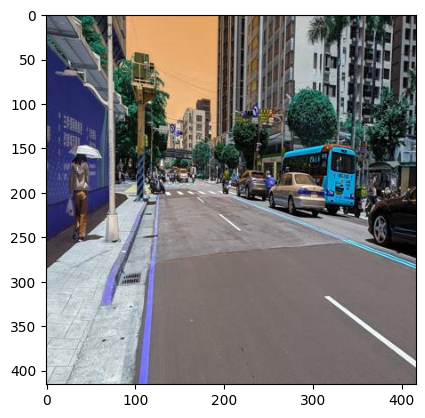

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(img[:, :, ::-1])

In [11]:
out = m(np.array([img]))

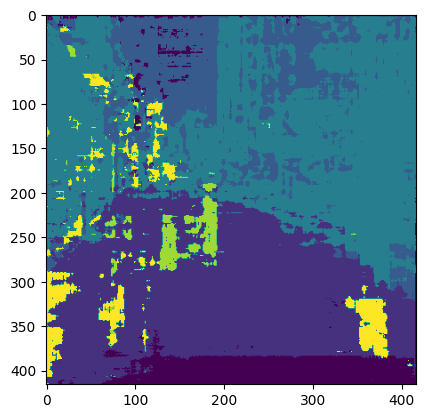

In [12]:
plt.imshow(np.argmax(out[0][0], axis=-1))

In [37]:
import matplotlib as mpl
cmap = mpl.colormaps['viridis'](np.linspace(0, 255, num=8).astype(int))[:,:-1]*255
cmap

array([[ 68.08602 ,   1.24287 ,  84.000825],
       [ 70.173705,  49.700775, 126.481275],
       [ 54.64599 ,  90.682845, 140.55192 ],
       [ 39.10782 , 126.735   , 142.21962 ],
       [ 30.9519  , 160.52046 , 135.653115],
       [ 73.674855, 193.39047 , 109.24863 ],
       [157.154715, 217.440795,  58.66326 ],
       [253.27824 , 231.070035,  36.70368 ]])

In [15]:
cmap=np.array([
    [ 68.08602 ,   1.24287 ,  84.000825],
    [ 70.173705,  49.700775, 126.481275],
    [ 54.64599 ,  90.682845, 140.55192 ],
    [ 39.10782 , 126.735   , 142.21962 ],
    [ 30.9519  , 160.52046 , 135.653115],
    [ 73.674855, 193.39047 , 109.24863 ],
    [157.154715, 217.440795,  58.66326 ],
    [253.27824 , 231.070035,  36.70368 ]
]).astype(np.uint8)

In [20]:
cmap[np.argmax(out[0][0], axis=-1)].shape

(416, 416, 3)

In [40]:
Image.fromarray(cmap[np.argmax(out[0][0], axis=-1)].astype(np.uint8)).save('test.jpg')

In [28]:
len(mpl.colormaps['viridis'].colors)

256

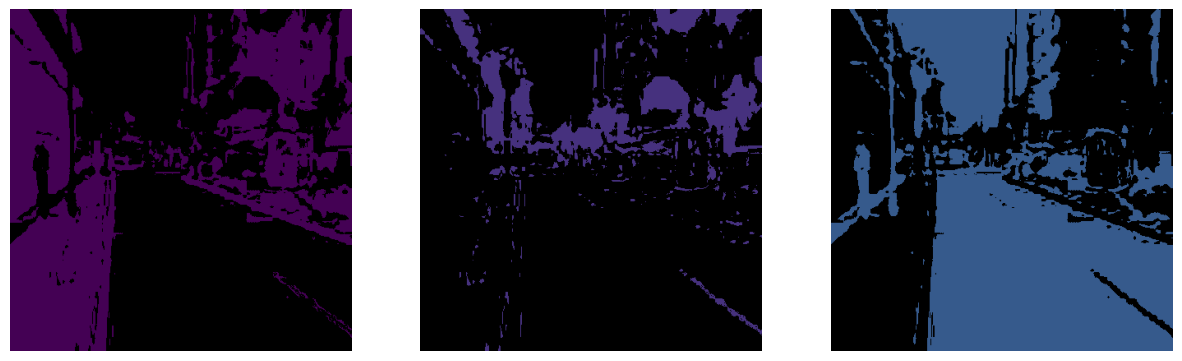

In [50]:
fig = plt.figure(figsize=(15, 15))
out=np.argmax(img, axis=-1)
for i in range(3):
    plt.subplot(1, 3, i+1)
    mask = (out==i).astype(np.uint8)
    masked = cmap[mask*i]*mask[:,:,np.newaxis]
    plt.imshow(masked)
    masked = np.dstack((masked,mask[:,:,np.newaxis]*255))
    Image.fromarray(masked).save(f'{i}_mask.png')
    plt.axis('off')
fig.show()

In [ ]:
import requests

data={
    'base64_str': base64_img
}
response = requests.post("http://192.168.0.120:8888/serve/efm_v2", json=data)
 
print("Status Code", response.status_code)
print("JSON Response ", response.json())